In [1]:
import os
import numpy as np
import pandas as pd
import optuna
import xgboost as xgb
import category_encoders as ce
import joblib

from glob import glob
from warnings import simplefilter
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder

c:\Users\kgw\Desktop\kgw\projects\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=FutureWarning)

In [3]:
PATH = os.getcwd()
train = pd.read_csv(f'{PATH}/data/train.csv').drop(columns=['ID'], axis=1)
test = pd.read_csv(f'{PATH}/data/test.csv').drop(columns=['ID'], axis=1)

In [4]:
rename_columns = {
    "제조사": "Manufacturer",           "모델": "Model",
    "차량상태": "VehicleCondition",     "배터리용량": "BatteryCapacity",
    "구동방식": "DriveType",            "주행거리(km)": "MileageKm",
    "보증기간(년)": "WarrantyYears",    "사고이력": "AccidentHistory",
    "연식(년)": "Year",                 "가격(백만원)": "Price",
}

train = train.rename(columns=rename_columns)
test = test.rename(columns=rename_columns)

In [5]:
train['BatteryCapacity'] = train['BatteryCapacity'].fillna(train.groupby(['Manufacturer', 'Model'])['BatteryCapacity'].transform('mean'))
test['BatteryCapacity'] = test['BatteryCapacity'].fillna(test.groupby(['Manufacturer', 'Model'])['BatteryCapacity'].transform('mean'))

In [739]:
# bins = [0, 60, 80, 100]
# labels = ["s", "m", "l"]
# train["BatteryCapacity_cut"] = pd.cut(train["BatteryCapacity"], bins=bins, labels=labels, right=False, include_lowest=True)
# test["BatteryCapacity_cut"] = pd.cut(test["BatteryCapacity"], bins=bins, labels=labels, right=False, include_lowest=True)

In [740]:
train['Year'] = 2024 - train['Year']
test['Year'] = 2024 -  test['Year']

train['WarrantyYears'] = 2024 - train['WarrantyYears']
test['WarrantyYears'] = 2024 -  test['WarrantyYears']

In [741]:
without_columns = ['ID', 'Price']
categorical_columns = [col for col in train.columns if (train[col].dtype in ['object', 'category']) and (col not in without_columns)]
numerical_columns  = [col for col in train.columns if col not in categorical_columns and (col not in without_columns)]

for i in range(len(numerical_columns)):
    for j in range(i, len(numerical_columns)):
        train[f'{numerical_columns[i]}*{numerical_columns[j]}'] = train[numerical_columns[i]] * train[numerical_columns[j]]
        test[f'{numerical_columns[i]}*{numerical_columns[j]}'] = test[numerical_columns[i]] * test[numerical_columns[j]]


In [742]:
train['BatteryCapacity/MileageKm'] = train['BatteryCapacity'] / train['MileageKm']
test['BatteryCapacity/MileageKm'] = test['BatteryCapacity'] / test['MileageKm']

In [743]:
numerical_columns  = [col for col in train.columns if col not in categorical_columns and (col not in without_columns)]

In [744]:
# https://github.com/rapidsai/deeplearning/blob/main/RecSys2020Tutorial/03_3_TargetEncoding.ipynb
def target_encode(X_train, X_valid, X_test, encode_col, target_col, smooth=0.0, agg="mean"):
    encoded_col = f'TE_{agg.upper()}_' + '_'.join(encode_col)
    
    df_tmp = X_train[encode_col + [target_col]].groupby(encode_col).agg([agg, 'count']).reset_index()
    if agg=="mean": mn = X_train[target_col].mean()
    elif agg=="median": mn = X_train[target_col].median()
    elif agg=="std": mn = X_train[target_col].std()
    elif agg=="min": mn = X_train[target_col].min()
    elif agg=="max": mn = X_train[target_col].max()
    
    df_tmp.columns = encode_col + [agg, 'count']
    df_tmp['TE_tmp'] = ((df_tmp[agg] * df_tmp['count']) + (mn * smooth)) / (df_tmp['count'] + smooth)
    
    X_train = X_train.merge(df_tmp[encode_col + ['TE_tmp']], how='left', left_on=encode_col, right_on=encode_col)
    X_train[encoded_col] = X_train['TE_tmp'].fillna(mn)
    X_train = X_train.drop(columns=['TE_tmp'])
    # X_train[encoded_col] = X_train[encoded_col].astype("float32")
    
    df_tmp_m = X_valid[encode_col].merge(df_tmp, how='left', left_on=encode_col, right_on=encode_col)
    X_valid[encoded_col] = df_tmp_m['TE_tmp'].fillna(mn).values
    # X_valid[encoded_col] = X_valid[encoded_col].astype("float32")

    df_tmp_m = X_test[encode_col].merge(df_tmp, how='left', left_on=encode_col, right_on=encode_col)
    X_test[encoded_col] = df_tmp_m['TE_tmp'].fillna(mn).values
    # X_test[encoded_col] = X_test[encoded_col].astype("float32")
    
    return X_train, X_valid, X_test

In [745]:
def trainer(params, log=False):
    target = "Price"

    SEED = 909
    FOLDS = 10
    kf = KFold(n_splits=FOLDS, random_state=SEED, shuffle=True)

    # SAVE OOF AND TEST PREDS
    oof = np.zeros( len(train) )
    pred = np.zeros( len(test) )
    rmse = 0.0
    
    # TRAIN/INFER K-FOLD
    for fold, (train_idx, valid_idx) in enumerate(kf.split(train)):
        
        # PRINT FOLD NUMBER
        if log: print(f"### Fold {fold+1} / {FOLDS} ###", end=" ")
        
        # GET TRAIN, VALID, TEST
        X_train = train.loc[train_idx, :].copy()
        y_train = train.loc[train_idx, target]
    
        X_valid = train.loc[valid_idx, :].copy()
        y_valid = train.loc[valid_idx, target]
        
        X_test = test.copy()        
      
        ## Target Encoder        
        encoder_columns = [
            'Manufacturer', 'Model', 
            # ['Manufacturer', 'BatteryCapacity_cut'], 
            # ['Manufacturer', 'AccidentHistory'], 
            # ['Model', 'BatteryCapacity_cut'], 
            # ['Model', 'AccidentHistory'], 
        ]
        
        for column in encoder_columns:
            if not isinstance(column, list): column = [column]
            X_train, X_valid, X_test = target_encode(X_train, X_valid, X_test, encode_col=column, target_col='Price', smooth=0.0, agg="mean")

        # Preprocess 
        X_train = X_train.drop(columns=['Price']+['Manufacturer', 'Model', 'DriveType'], axis=1)
        X_valid = X_valid.drop(columns=['Price']+['Manufacturer', 'Model', 'DriveType'], axis=1)
        X_test = X_test.drop(columns=['Manufacturer', 'Model', 'DriveType'], axis=1)
 
        # Category Encoder
        encoder_columns = ['VehicleCondition', 'AccidentHistory'] # , 'BatteryCapacity_cut', 'DriveType'
        enc = ce.PolynomialEncoder(cols=encoder_columns)
        X_train = enc.fit_transform(X_train)
        X_valid = enc.transform(X_valid)
        X_test = enc.transform(X_test)

        ## Scaler
        scaler_columns = numerical_columns
        X_scaler = StandardScaler()
        X_train[scaler_columns] = X_scaler.fit_transform(X_train[scaler_columns])
        X_valid[scaler_columns] = X_scaler.transform(X_valid[scaler_columns])
        X_test[scaler_columns] = X_scaler.transform(X_test[scaler_columns])

        # FIT MODEL    
        model = xgb.XGBRegressor(
            **params,
            # n_estimators=100000,
            early_stopping_rounds=100,
            random_state=SEED,
        )
        
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=False,
        ) 
        
        # INFER OOF AND TEST
        oof[valid_idx] = model.predict(X_valid)    
        pred += model.predict(X_test)
        
        rmse_fold = np.sqrt(np.mean((y_valid - oof[valid_idx]) ** 2))
        if log: print(f" -> RMSE = {rmse_fold:.5f}", end='\r')
        rmse += rmse_fold
        
    pred /= FOLDS
    rmse /= FOLDS
    
    if log: print(f"-> Folds RMSE = {rmse:.5f}")
    
    return rmse, pred, model

In [746]:
def xgb_objective(trial):
    # Define parameter search space
    params = {        
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.3),
        "max_depth": trial.suggest_int("max_depth", 16, 255),
        "n_estimators": trial.suggest_int("n_estimators", 100, 3000),
        'gamma': trial.suggest_float('gamma', 1e-3, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1.0),
        # 'subsample': trial.suggest_discrete_uniform('subsample', 0.8, 1.0, 0.05),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 100), 
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.5, 1.0, 0.01), 
        'colsample_bynode': trial.suggest_discrete_uniform('colsample_bynode', 0.5, 1.0, 0.01), 
        'colsample_bylevel': trial.suggest_discrete_uniform('colsample_bylevel', 0.5, 1.0, 0.01), 
    }

    rmse, _, _ = trainer(params, log=True)

    return rmse

xgb_study = optuna.create_study(direction="minimize")
xgb_study.optimize(xgb_objective, n_trials=10000)
xgb_study.best_params

[I 2025-01-24 15:45:54,876] A new study created in memory with name: no-name-637b5ffc-560c-4071-af92-e1ba6c46b566


### Fold 10 / 10 ### -> RMSE = 1.41476 -> RMSE = 1.49481 -> RMSE = 1.60571 -> RMSE = 1.37764 -> RMSE = 1.27599 -> RMSE = 1.65382 -> RMSE = 1.68322 -> RMSE = 1.20295 -> RMSE = 1.18397

[I 2025-01-24 15:46:01,275] Trial 0 finished with value: 1.451913642954851 and parameters: {'learning_rate': 0.2937036825507281, 'max_depth': 176, 'n_estimators': 1592, 'gamma': 0.6133111466917638, 'reg_alpha': 0.22212086028936523, 'reg_lambda': 0.05401451045037527, 'min_child_weight': 86, 'colsample_bytree': 0.69, 'colsample_bynode': 0.97, 'colsample_bylevel': 0.88}. Best is trial 0 with value: 1.451913642954851.


-> Folds RMSE = 1.45191
### Fold 10 / 10 ### -> RMSE = 1.39830 -> RMSE = 1.59676 -> RMSE = 1.66556 -> RMSE = 1.35337 -> RMSE = 1.45832 -> RMSE = 1.63187 -> RMSE = 1.83879 -> RMSE = 1.34942 -> RMSE = 1.45422

[I 2025-01-24 15:46:07,843] Trial 1 finished with value: 1.5488393351435596 and parameters: {'learning_rate': 0.25714120928750206, 'max_depth': 122, 'n_estimators': 1868, 'gamma': 0.6989152986705641, 'reg_alpha': 0.511531261638568, 'reg_lambda': 0.7688643563178096, 'min_child_weight': 8, 'colsample_bytree': 0.81, 'colsample_bynode': 0.54, 'colsample_bylevel': 0.63}. Best is trial 0 with value: 1.451913642954851.


-> Folds RMSE = 1.54884
### Fold 10 / 10 ### -> RMSE = 1.43938 -> RMSE = 1.42959 -> RMSE = 1.56298 -> RMSE = 1.30653 -> RMSE = 1.29771 -> RMSE = 1.54604 -> RMSE = 1.61992 -> RMSE = 1.21482 -> RMSE = 1.19986

[I 2025-01-24 15:46:15,204] Trial 2 finished with value: 1.4172692404415774 and parameters: {'learning_rate': 0.10638736555392488, 'max_depth': 197, 'n_estimators': 2859, 'gamma': 0.4424765596281138, 'reg_alpha': 0.6707401295851616, 'reg_lambda': 0.9771265846909275, 'min_child_weight': 25, 'colsample_bytree': 0.73, 'colsample_bynode': 0.87, 'colsample_bylevel': 0.6799999999999999}. Best is trial 2 with value: 1.4172692404415774.


-> Folds RMSE = 1.41727
### Fold 10 / 10 ### -> RMSE = 1.40675 -> RMSE = 1.55408 -> RMSE = 1.58074 -> RMSE = 1.28916 -> RMSE = 1.32684 -> RMSE = 1.57311 -> RMSE = 1.56597 -> RMSE = 1.24935 -> RMSE = 1.28907

[I 2025-01-24 15:46:21,013] Trial 3 finished with value: 1.430250963233406 and parameters: {'learning_rate': 0.20308708632164363, 'max_depth': 146, 'n_estimators': 594, 'gamma': 0.534662818046197, 'reg_alpha': 0.16703231856427167, 'reg_lambda': 0.6287429558849499, 'min_child_weight': 58, 'colsample_bytree': 0.6799999999999999, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2 with value: 1.4172692404415774.


-> Folds RMSE = 1.43025
### Fold 10 / 10 ### -> RMSE = 1.47965 -> RMSE = 1.52732 -> RMSE = 1.51188 -> RMSE = 1.30223 -> RMSE = 1.28474 -> RMSE = 1.52903 -> RMSE = 1.68245 -> RMSE = 1.22126 -> RMSE = 1.19486

[I 2025-01-24 15:46:27,629] Trial 4 finished with value: 1.425282697540874 and parameters: {'learning_rate': 0.2099342381172853, 'max_depth': 242, 'n_estimators': 2108, 'gamma': 0.4856552131611396, 'reg_alpha': 0.2979075034363409, 'reg_lambda': 0.24367161154289826, 'min_child_weight': 16, 'colsample_bytree': 0.9199999999999999, 'colsample_bynode': 0.53, 'colsample_bylevel': 0.91}. Best is trial 2 with value: 1.4172692404415774.


-> Folds RMSE = 1.42528
### Fold 10 / 10 ### -> RMSE = 1.49145 -> RMSE = 1.42779 -> RMSE = 1.53684 -> RMSE = 1.31219 -> RMSE = 1.34272 -> RMSE = 1.64065 -> RMSE = 1.61573 -> RMSE = 1.21305 -> RMSE = 1.19661

[I 2025-01-24 15:46:33,585] Trial 5 finished with value: 1.431944422802411 and parameters: {'learning_rate': 0.22729387858439049, 'max_depth': 240, 'n_estimators': 2667, 'gamma': 0.5239702555621019, 'reg_alpha': 0.10535131079344864, 'reg_lambda': 0.8992192117740858, 'min_child_weight': 45, 'colsample_bytree': 0.96, 'colsample_bynode': 0.55, 'colsample_bylevel': 0.67}. Best is trial 2 with value: 1.4172692404415774.


-> Folds RMSE = 1.43194
### Fold 10 / 10 ### -> RMSE = 1.74799 -> RMSE = 1.96065 -> RMSE = 2.11990 -> RMSE = 1.65593 -> RMSE = 1.83342 -> RMSE = 2.06795 -> RMSE = 2.18260 -> RMSE = 1.41047 -> RMSE = 1.29195

[I 2025-01-24 15:46:47,608] Trial 6 finished with value: 1.8445105238076578 and parameters: {'learning_rate': 0.15538587308179128, 'max_depth': 37, 'n_estimators': 231, 'gamma': 0.145105385369053, 'reg_alpha': 0.31987970420577044, 'reg_lambda': 0.5426151490544353, 'min_child_weight': 16, 'colsample_bytree': 0.54, 'colsample_bynode': 0.51, 'colsample_bylevel': 0.64}. Best is trial 2 with value: 1.4172692404415774.


-> Folds RMSE = 1.84451
### Fold 10 / 10 ### -> RMSE = 1.39405 -> RMSE = 1.44711 -> RMSE = 1.49295 -> RMSE = 1.22157 -> RMSE = 1.22068 -> RMSE = 1.48178 -> RMSE = 1.51894 -> RMSE = 1.16397 -> RMSE = 1.17599

[I 2025-01-24 15:46:58,179] Trial 7 finished with value: 1.3515560625635568 and parameters: {'learning_rate': 0.22207129353450183, 'max_depth': 241, 'n_estimators': 507, 'gamma': 0.03170159328162138, 'reg_alpha': 0.05854774187137674, 'reg_lambda': 0.6168100324249719, 'min_child_weight': 82, 'colsample_bytree': 0.89, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.98}. Best is trial 7 with value: 1.3515560625635568.


-> Folds RMSE = 1.35156
### Fold 10 / 10 ### -> RMSE = 1.45543 -> RMSE = 1.53206 -> RMSE = 1.65724 -> RMSE = 1.34688 -> RMSE = 1.35258 -> RMSE = 1.60198 -> RMSE = 1.60601 -> RMSE = 1.20604 -> RMSE = 1.33928

[I 2025-01-24 15:47:09,182] Trial 8 finished with value: 1.475647098187012 and parameters: {'learning_rate': 0.11292622078492409, 'max_depth': 248, 'n_estimators': 1906, 'gamma': 0.8125826047494461, 'reg_alpha': 0.5657342429928339, 'reg_lambda': 0.1401973668577082, 'min_child_weight': 72, 'colsample_bytree': 0.69, 'colsample_bynode': 0.59, 'colsample_bylevel': 0.77}. Best is trial 7 with value: 1.3515560625635568.


-> Folds RMSE = 1.47565
### Fold 10 / 10 ### -> RMSE = 1.39761 -> RMSE = 1.48617 -> RMSE = 1.59598 -> RMSE = 1.35347 -> RMSE = 1.24501 -> RMSE = 1.56537 -> RMSE = 1.60627 -> RMSE = 1.11755 -> RMSE = 1.25447

[I 2025-01-24 15:47:15,253] Trial 9 finished with value: 1.4117034091392369 and parameters: {'learning_rate': 0.2588405862782547, 'max_depth': 87, 'n_estimators': 649, 'gamma': 0.7231652684207814, 'reg_alpha': 0.002761101390317156, 'reg_lambda': 0.20414919990981154, 'min_child_weight': 100, 'colsample_bytree': 0.76, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.74}. Best is trial 7 with value: 1.3515560625635568.


-> Folds RMSE = 1.41170
### Fold 10 / 10 ### -> RMSE = 1.46132 -> RMSE = 1.42489 -> RMSE = 1.58702 -> RMSE = 1.33261 -> RMSE = 1.33048 -> RMSE = 1.63492 -> RMSE = 1.56679 -> RMSE = 1.09698 -> RMSE = 1.21931

[I 2025-01-24 15:47:32,980] Trial 10 finished with value: 1.4238019312460897 and parameters: {'learning_rate': 0.1646322728243704, 'max_depth': 19, 'n_estimators': 1071, 'gamma': 0.049088538351312716, 'reg_alpha': 0.9473612503927147, 'reg_lambda': 0.4300657774991473, 'min_child_weight': 53, 'colsample_bytree': 0.87, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.52}. Best is trial 7 with value: 1.3515560625635568.


-> Folds RMSE = 1.42380
### Fold 10 / 10 ### -> RMSE = 1.38978 -> RMSE = 1.47176 -> RMSE = 1.47378 -> RMSE = 1.28748 -> RMSE = 1.24168 -> RMSE = 1.48774 -> RMSE = 1.51129 -> RMSE = 1.16464 -> RMSE = 1.19457

[I 2025-01-24 15:47:49,767] Trial 11 finished with value: 1.3723857386737137 and parameters: {'learning_rate': 0.2585881745187953, 'max_depth': 68, 'n_estimators': 858, 'gamma': 0.2936366146845201, 'reg_alpha': 0.009937352162108769, 'reg_lambda': 0.33025542347238307, 'min_child_weight': 100, 'colsample_bytree': 0.8200000000000001, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 1.0}. Best is trial 7 with value: 1.3515560625635568.


-> Folds RMSE = 1.37239
### Fold 10 / 10 ### -> RMSE = 1.36631 -> RMSE = 1.43476 -> RMSE = 1.46096 -> RMSE = 1.19750 -> RMSE = 1.22727 -> RMSE = 1.49813 -> RMSE = 1.53563 -> RMSE = 1.12583 -> RMSE = 1.19648

[I 2025-01-24 15:48:03,476] Trial 12 finished with value: 1.3474645482938525 and parameters: {'learning_rate': 0.25138032129399873, 'max_depth': 82, 'n_estimators': 1150, 'gamma': 0.276765981235757, 'reg_alpha': 0.017374122599317032, 'reg_lambda': 0.376632818426215, 'min_child_weight': 100, 'colsample_bytree': 0.8500000000000001, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.99}. Best is trial 12 with value: 1.3474645482938525.


-> Folds RMSE = 1.34746
### Fold 10 / 10 ### -> RMSE = 1.37043 -> RMSE = 1.44013 -> RMSE = 1.45109 -> RMSE = 1.24736 -> RMSE = 1.22130 -> RMSE = 1.46729 -> RMSE = 1.50603 -> RMSE = 1.14336 -> RMSE = 1.16879

[I 2025-01-24 15:48:18,654] Trial 13 finished with value: 1.3424242412137664 and parameters: {'learning_rate': 0.23497600501619806, 'max_depth': 103, 'n_estimators': 1271, 'gamma': 0.24098255523305478, 'reg_alpha': 0.3824415689814645, 'reg_lambda': 0.6888462168326672, 'min_child_weight': 80, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.99}. Best is trial 13 with value: 1.3424242412137664.


-> Folds RMSE = 1.34242
### Fold 10 / 10 ### -> RMSE = 1.40033 -> RMSE = 1.41600 -> RMSE = 1.48477 -> RMSE = 1.28194 -> RMSE = 1.24242 -> RMSE = 1.53647 -> RMSE = 1.59647 -> RMSE = 1.15598 -> RMSE = 1.19894

[I 2025-01-24 15:48:33,623] Trial 14 finished with value: 1.3756070668228326 and parameters: {'learning_rate': 0.29462473597906796, 'max_depth': 100, 'n_estimators': 1194, 'gamma': 0.9936371950225011, 'reg_alpha': 0.7978945635298562, 'reg_lambda': 0.7418797549622682, 'min_child_weight': 72, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.8400000000000001}. Best is trial 13 with value: 1.3424242412137664.


-> Folds RMSE = 1.37561
### Fold 10 / 10 ### -> RMSE = 1.38411 -> RMSE = 1.42268 -> RMSE = 1.47633 -> RMSE = 1.22083 -> RMSE = 1.25868 -> RMSE = 1.51253 -> RMSE = 1.55465 -> RMSE = 1.09771 -> RMSE = 1.11811

[I 2025-01-24 15:48:54,106] Trial 15 finished with value: 1.348297687331329 and parameters: {'learning_rate': 0.17334246679276594, 'max_depth': 61, 'n_estimators': 1376, 'gamma': 0.31804859314304545, 'reg_alpha': 0.414913799084458, 'reg_lambda': 0.42563534621743465, 'min_child_weight': 86, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.81}. Best is trial 13 with value: 1.3424242412137664.


-> Folds RMSE = 1.34830
### Fold 10 / 10 ### -> RMSE = 1.43134 -> RMSE = 1.51736 -> RMSE = 1.80893 -> RMSE = 1.51783 -> RMSE = 1.42503 -> RMSE = 1.66047 -> RMSE = 1.61657 -> RMSE = 1.25773 -> RMSE = 1.23368

[I 2025-01-24 15:49:10,949] Trial 16 finished with value: 1.5028985088068159 and parameters: {'learning_rate': 0.24183294544265588, 'max_depth': 138, 'n_estimators': 1525, 'gamma': 0.2514193045477453, 'reg_alpha': 0.39988448701229223, 'reg_lambda': 0.7255456265984433, 'min_child_weight': 70, 'colsample_bytree': 0.59, 'colsample_bynode': 0.8500000000000001, 'colsample_bylevel': 0.94}. Best is trial 13 with value: 1.3424242412137664.


-> Folds RMSE = 1.50290
### Fold 10 / 10 ### -> RMSE = 1.38446 -> RMSE = 1.44482 -> RMSE = 1.52492 -> RMSE = 1.25592 -> RMSE = 1.25459 -> RMSE = 1.51168 -> RMSE = 1.58214 -> RMSE = 1.14641 -> RMSE = 1.19239

[I 2025-01-24 15:49:22,692] Trial 17 finished with value: 1.3699777713590295 and parameters: {'learning_rate': 0.18489787499915553, 'max_depth': 107, 'n_estimators': 2320, 'gamma': 0.36737267189607764, 'reg_alpha': 0.6504288445117721, 'reg_lambda': 0.3537301242146974, 'min_child_weight': 43, 'colsample_bytree': 0.8400000000000001, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.87}. Best is trial 13 with value: 1.3424242412137664.


-> Folds RMSE = 1.36998
### Fold 10 / 10 ### -> RMSE = 1.37576 -> RMSE = 1.47197 -> RMSE = 1.53296 -> RMSE = 1.23711 -> RMSE = 1.20343 -> RMSE = 1.47207 -> RMSE = 1.51231 -> RMSE = 1.16891 -> RMSE = 1.16519

[I 2025-01-24 15:49:35,951] Trial 18 finished with value: 1.3564658487382417 and parameters: {'learning_rate': 0.2711568448543282, 'max_depth': 69, 'n_estimators': 1011, 'gamma': 0.21596189145840647, 'reg_alpha': 0.19013037528376145, 'reg_lambda': 0.5266429186912185, 'min_child_weight': 93, 'colsample_bytree': 0.9299999999999999, 'colsample_bynode': 0.88, 'colsample_bylevel': 1.0}. Best is trial 13 with value: 1.3424242412137664.


-> Folds RMSE = 1.35647
### Fold 10 / 10 ### -> RMSE = 1.55948 -> RMSE = 1.61546 -> RMSE = 1.59802 -> RMSE = 1.37670 -> RMSE = 1.31063 -> RMSE = 1.52713 -> RMSE = 1.58997 -> RMSE = 1.12056 -> RMSE = 1.22076

[I 2025-01-24 15:49:54,727] Trial 19 finished with value: 1.4413779908786364 and parameters: {'learning_rate': 0.2363560995431161, 'max_depth': 168, 'n_estimators': 1383, 'gamma': 0.136824399376149, 'reg_alpha': 0.8489627428966546, 'reg_lambda': 0.8682888830476728, 'min_child_weight': 62, 'colsample_bytree': 0.79, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.51}. Best is trial 13 with value: 1.3424242412137664.


-> Folds RMSE = 1.44138
### Fold 10 / 10 ### -> RMSE = 1.36136 -> RMSE = 1.44667 -> RMSE = 1.48262 -> RMSE = 1.24493 -> RMSE = 1.24736 -> RMSE = 1.48112 -> RMSE = 1.47891 -> RMSE = 1.11667 -> RMSE = 1.20208

[I 2025-01-24 15:50:04,469] Trial 20 finished with value: 1.3460652207989812 and parameters: {'learning_rate': 0.27890656605633635, 'max_depth': 47, 'n_estimators': 285, 'gamma': 0.3724460501628592, 'reg_alpha': 0.4080252152500092, 'reg_lambda': 0.6125383879535968, 'min_child_weight': 80, 'colsample_bytree': 0.95, 'colsample_bynode': 0.8200000000000001, 'colsample_bylevel': 0.95}. Best is trial 13 with value: 1.3424242412137664.


-> Folds RMSE = 1.34607
### Fold 10 / 10 ### -> RMSE = 1.37156 -> RMSE = 1.44272 -> RMSE = 1.48709 -> RMSE = 1.24284 -> RMSE = 1.22506 -> RMSE = 1.47042 -> RMSE = 1.51354 -> RMSE = 1.15552 -> RMSE = 1.17902

[I 2025-01-24 15:50:16,673] Trial 21 finished with value: 1.348254969809696 and parameters: {'learning_rate': 0.2810044246137677, 'max_depth': 44, 'n_estimators': 134, 'gamma': 0.39340300476641066, 'reg_alpha': 0.4047436350843989, 'reg_lambda': 0.6328941647933999, 'min_child_weight': 79, 'colsample_bytree': 0.95, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.95}. Best is trial 13 with value: 1.3424242412137664.


-> Folds RMSE = 1.34825
### Fold 10 / 10 ### -> RMSE = 1.40926 -> RMSE = 1.42960 -> RMSE = 1.47856 -> RMSE = 1.30165 -> RMSE = 1.23486 -> RMSE = 1.51278 -> RMSE = 1.56801 -> RMSE = 1.13830 -> RMSE = 1.15429

[I 2025-01-24 15:50:51,826] Trial 22 finished with value: 1.369401256320337 and parameters: {'learning_rate': 0.2782898137443129, 'max_depth': 84, 'n_estimators': 855, 'gamma': 0.17307142711626056, 'reg_alpha': 0.3007553414296971, 'reg_lambda': 0.4726847537034315, 'min_child_weight': 92, 'colsample_bytree': 0.88, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 13 with value: 1.3424242412137664.


-> Folds RMSE = 1.36940
### Fold 10 / 10 ### -> RMSE = 1.36540 -> RMSE = 1.40094 -> RMSE = 1.45992 -> RMSE = 1.27984 -> RMSE = 1.21577 -> RMSE = 1.47011 -> RMSE = 1.51460 -> RMSE = 1.16298 -> RMSE = 1.19084

[I 2025-01-24 15:51:10,657] Trial 23 finished with value: 1.3477379407342096 and parameters: {'learning_rate': 0.24257335976495473, 'max_depth': 115, 'n_estimators': 464, 'gamma': 0.3307489026949072, 'reg_alpha': 0.5785978485646621, 'reg_lambda': 0.8152807587994071, 'min_child_weight': 65, 'colsample_bytree': 0.97, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.96}. Best is trial 13 with value: 1.3424242412137664.


-> Folds RMSE = 1.34774
### Fold 10 / 10 ### -> RMSE = 1.38214 -> RMSE = 1.47719 -> RMSE = 1.45729 -> RMSE = 1.26834 -> RMSE = 1.25436 -> RMSE = 1.46420 -> RMSE = 1.50242 -> RMSE = 1.17324 -> RMSE = 1.23860

[I 2025-01-24 15:51:25,938] Trial 24 finished with value: 1.3662447554999637 and parameters: {'learning_rate': 0.2536482585123873, 'max_depth': 17, 'n_estimators': 1715, 'gamma': 0.4160070378688215, 'reg_alpha': 0.43377565159517273, 'reg_lambda': 0.668018966215462, 'min_child_weight': 78, 'colsample_bytree': 0.91, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.8400000000000001}. Best is trial 13 with value: 1.3424242412137664.


-> Folds RMSE = 1.36624
### Fold 10 / 10 ### -> RMSE = 1.38561 -> RMSE = 1.44751 -> RMSE = 1.43961 -> RMSE = 1.20411 -> RMSE = 1.23613 -> RMSE = 1.48607 -> RMSE = 1.52021 -> RMSE = 1.14012 -> RMSE = 1.17166

[I 2025-01-24 15:51:51,825] Trial 25 finished with value: 1.3469661265768913 and parameters: {'learning_rate': 0.21633326603683278, 'max_depth': 41, 'n_estimators': 322, 'gamma': 0.10453579329065663, 'reg_alpha': 0.24271708177307633, 'reg_lambda': 0.34402526113445864, 'min_child_weight': 92, 'colsample_bytree': 0.8400000000000001, 'colsample_bynode': 0.8200000000000001, 'colsample_bylevel': 1.0}. Best is trial 13 with value: 1.3424242412137664.


-> Folds RMSE = 1.34697
### Fold 10 / 10 ### -> RMSE = 1.37116 -> RMSE = 1.43672 -> RMSE = 1.43630 -> RMSE = 1.21425 -> RMSE = 1.21389 -> RMSE = 1.47164 -> RMSE = 1.50973 -> RMSE = 1.12938 -> RMSE = 1.14710

[I 2025-01-24 15:52:23,741] Trial 26 finished with value: 1.3331683628831121 and parameters: {'learning_rate': 0.21584297393768923, 'max_depth': 45, 'n_estimators': 372, 'gamma': 0.09949642812843118, 'reg_alpha': 0.28412656855245055, 'reg_lambda': 0.555539375190456, 'min_child_weight': 91, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8300000000000001, 'colsample_bylevel': 0.95}. Best is trial 26 with value: 1.3331683628831121.


-> Folds RMSE = 1.33317
### Fold 10 / 10 ### -> RMSE = 1.35163 -> RMSE = 1.41674 -> RMSE = 1.47807 -> RMSE = 1.21013 -> RMSE = 1.24310 -> RMSE = 1.47172 -> RMSE = 1.53257 -> RMSE = 1.15180 -> RMSE = 1.16885

[I 2025-01-24 15:52:41,573] Trial 27 finished with value: 1.3429523338883445 and parameters: {'learning_rate': 0.18955910972519469, 'max_depth': 52, 'n_estimators': 799, 'gamma': 0.21170547240160426, 'reg_alpha': 0.3244525965434969, 'reg_lambda': 0.5582807842927069, 'min_child_weight': 33, 'colsample_bytree': 1.0, 'colsample_bynode': 0.91, 'colsample_bylevel': 0.79}. Best is trial 26 with value: 1.3331683628831121.


-> Folds RMSE = 1.34295
### Fold 10 / 10 ### -> RMSE = 1.39222 -> RMSE = 1.41345 -> RMSE = 1.50134 -> RMSE = 1.24751 -> RMSE = 1.24034 -> RMSE = 1.47063 -> RMSE = 1.50162 -> RMSE = 1.16999 -> RMSE = 1.16960

[I 2025-01-24 15:53:13,829] Trial 28 finished with value: 1.3495600573786797 and parameters: {'learning_rate': 0.19346705455718993, 'max_depth': 59, 'n_estimators': 763, 'gamma': 0.004741474579566363, 'reg_alpha': 0.333288691427725, 'reg_lambda': 0.5398311260682325, 'min_child_weight': 34, 'colsample_bytree': 1.0, 'colsample_bynode': 0.9199999999999999, 'colsample_bylevel': 0.77}. Best is trial 26 with value: 1.3331683628831121.


-> Folds RMSE = 1.34956
### Fold 10 / 10 ### -> RMSE = 1.40708 -> RMSE = 1.46621 -> RMSE = 1.51140 -> RMSE = 1.25974 -> RMSE = 1.22042 -> RMSE = 1.48943 -> RMSE = 1.52225 -> RMSE = 1.18787 -> RMSE = 1.19166

[I 2025-01-24 15:53:31,869] Trial 29 finished with value: 1.3631030011313272 and parameters: {'learning_rate': 0.14290005064484018, 'max_depth': 98, 'n_estimators': 1321, 'gamma': 0.20759557207511115, 'reg_alpha': 0.13903423719883232, 'reg_lambda': 0.04880011045143928, 'min_child_weight': 33, 'colsample_bytree': 0.97, 'colsample_bynode': 0.91, 'colsample_bylevel': 0.87}. Best is trial 26 with value: 1.3331683628831121.


-> Folds RMSE = 1.36310
### Fold 10 / 10 ### -> RMSE = 1.38784 -> RMSE = 1.45169 -> RMSE = 1.52842 -> RMSE = 1.23838 -> RMSE = 1.29091 -> RMSE = 1.49417 -> RMSE = 1.51900 -> RMSE = 1.14645 -> RMSE = 1.15094

[I 2025-01-24 15:54:13,013] Trial 30 finished with value: 1.3604040190731088 and parameters: {'learning_rate': 0.14109254030304125, 'max_depth': 164, 'n_estimators': 916, 'gamma': 0.07532750590242734, 'reg_alpha': 0.2314694754620508, 'reg_lambda': 0.7123324651979935, 'min_child_weight': 35, 'colsample_bytree': 0.9, 'colsample_bynode': 0.9299999999999999, 'colsample_bylevel': 0.58}. Best is trial 26 with value: 1.3331683628831121.


-> Folds RMSE = 1.36040
### Fold 10 / 10 ### -> RMSE = 1.36631 -> RMSE = 1.43644 -> RMSE = 1.47366 -> RMSE = 1.20292 -> RMSE = 1.23063 -> RMSE = 1.50047 -> RMSE = 1.53892 -> RMSE = 1.13452 -> RMSE = 1.17088

[I 2025-01-24 15:54:35,768] Trial 31 finished with value: 1.3460742823092722 and parameters: {'learning_rate': 0.1884653627137227, 'max_depth': 32, 'n_estimators': 386, 'gamma': 0.22755222251287824, 'reg_alpha': 0.47023225295864324, 'reg_lambda': 0.58272306729754, 'min_child_weight': 86, 'colsample_bytree': 0.96, 'colsample_bynode': 0.8500000000000001, 'colsample_bylevel': 0.91}. Best is trial 26 with value: 1.3331683628831121.


-> Folds RMSE = 1.34607
### Fold 10 / 10 ### -> RMSE = 1.37767 -> RMSE = 1.46840 -> RMSE = 1.62217 -> RMSE = 1.27429 -> RMSE = 1.23890 -> RMSE = 1.53807 -> RMSE = 1.54497 -> RMSE = 1.15457 -> RMSE = 1.14649

[I 2025-01-24 15:54:59,181] Trial 32 finished with value: 1.3840996324220485 and parameters: {'learning_rate': 0.2049365363368275, 'max_depth': 53, 'n_estimators': 133, 'gamma': 0.1789255146420289, 'reg_alpha': 0.35707035763423617, 'reg_lambda': 0.6711101999465869, 'min_child_weight': 47, 'colsample_bytree': 0.94, 'colsample_bynode': 0.8500000000000001, 'colsample_bylevel': 0.72}. Best is trial 26 with value: 1.3331683628831121.


-> Folds RMSE = 1.38410
### Fold 10 / 10 ### -> RMSE = 1.41436 -> RMSE = 1.43550 -> RMSE = 1.49462 -> RMSE = 1.22179 -> RMSE = 1.23108 -> RMSE = 1.50335 -> RMSE = 1.55971 -> RMSE = 1.17758 -> RMSE = 1.15366

[I 2025-01-24 15:55:16,593] Trial 33 finished with value: 1.3602846451607387 and parameters: {'learning_rate': 0.23264593585196608, 'max_depth': 124, 'n_estimators': 686, 'gamma': 0.10283696898695113, 'reg_alpha': 0.5610271851775781, 'reg_lambda': 0.7961176394772903, 'min_child_weight': 25, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8200000000000001, 'colsample_bylevel': 0.96}. Best is trial 26 with value: 1.3331683628831121.


-> Folds RMSE = 1.36028
### Fold 10 / 10 ### -> RMSE = 1.37898 -> RMSE = 1.44323 -> RMSE = 1.42599 -> RMSE = 1.30127 -> RMSE = 1.23766 -> RMSE = 1.46837 -> RMSE = 1.48455 -> RMSE = 1.16579 -> RMSE = 1.19672

[I 2025-01-24 15:55:29,661] Trial 34 finished with value: 1.3502608125617122 and parameters: {'learning_rate': 0.18085486238332532, 'max_depth': 76, 'n_estimators': 525, 'gamma': 0.35787193219195224, 'reg_alpha': 0.4794444291853128, 'reg_lambda': 0.44635842959355854, 'min_child_weight': 76, 'colsample_bytree': 0.9299999999999999, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.81}. Best is trial 26 with value: 1.3331683628831121.


-> Folds RMSE = 1.35026
### Fold 10 / 10 ### -> RMSE = 1.39270 -> RMSE = 1.41780 -> RMSE = 1.45962 -> RMSE = 1.25681 -> RMSE = 1.22565 -> RMSE = 1.47607 -> RMSE = 1.55161 -> RMSE = 1.13304 -> RMSE = 1.18520

[I 2025-01-24 15:55:39,145] Trial 35 finished with value: 1.3521643568176303 and parameters: {'learning_rate': 0.2122028600401524, 'max_depth': 28, 'n_estimators': 339, 'gamma': 0.6206842607177672, 'reg_alpha': 0.28415108028403835, 'reg_lambda': 0.5893378298771629, 'min_child_weight': 53, 'colsample_bytree': 0.98, 'colsample_bynode': 0.88, 'colsample_bylevel': 0.9199999999999999}. Best is trial 26 with value: 1.3331683628831121.


-> Folds RMSE = 1.35216
### Fold 10 / 10 ### -> RMSE = 1.52756 -> RMSE = 1.51835 -> RMSE = 1.63576 -> RMSE = 1.31842 -> RMSE = 1.38570 -> RMSE = 1.65938 -> RMSE = 1.57003 -> RMSE = 1.20639 -> RMSE = 1.20848

[I 2025-01-24 15:55:51,362] Trial 36 finished with value: 1.458952041722274 and parameters: {'learning_rate': 0.19715835029171752, 'max_depth': 212, 'n_estimators': 729, 'gamma': 0.4949587742965204, 'reg_alpha': 0.24925128985406317, 'reg_lambda': 0.9742793433102517, 'min_child_weight': 6, 'colsample_bytree': 0.94, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.88}. Best is trial 26 with value: 1.3331683628831121.


-> Folds RMSE = 1.45895
### Fold 10 / 10 ### -> RMSE = 1.38532 -> RMSE = 1.46334 -> RMSE = 1.44129 -> RMSE = 1.23389 -> RMSE = 1.25070 -> RMSE = 1.48286 -> RMSE = 1.50308 -> RMSE = 1.14974 -> RMSE = 1.18414

[I 2025-01-24 15:56:00,901] Trial 37 finished with value: 1.3583651782652189 and parameters: {'learning_rate': 0.29821563855833405, 'max_depth': 50, 'n_estimators': 586, 'gamma': 0.45110296572809944, 'reg_alpha': 0.3643363095247601, 'reg_lambda': 0.4985428647175184, 'min_child_weight': 86, 'colsample_bytree': 0.91, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.8400000000000001}. Best is trial 26 with value: 1.3331683628831121.


-> Folds RMSE = 1.35837
### Fold 10 / 10 ### -> RMSE = 1.45278 -> RMSE = 1.50686 -> RMSE = 1.53307 -> RMSE = 1.31821 -> RMSE = 1.34173 -> RMSE = 1.53487 -> RMSE = 1.62915 -> RMSE = 1.18528 -> RMSE = 1.29646

[I 2025-01-24 15:56:11,668] Trial 38 finished with value: 1.4554776897393114 and parameters: {'learning_rate': 0.22355119464172435, 'max_depth': 95, 'n_estimators': 269, 'gamma': 0.5761022618039893, 'reg_alpha': 0.48841122313713, 'reg_lambda': 0.6944178797158768, 'min_child_weight': 65, 'colsample_bytree': 0.62, 'colsample_bynode': 0.8400000000000001, 'colsample_bylevel': 0.97}. Best is trial 26 with value: 1.3331683628831121.


-> Folds RMSE = 1.45548
### Fold 10 / 10 ### -> RMSE = 1.41876 -> RMSE = 1.45519 -> RMSE = 1.49537 -> RMSE = 1.22543 -> RMSE = 1.24057 -> RMSE = 1.48868 -> RMSE = 1.50858 -> RMSE = 1.15067 -> RMSE = 1.15881

[I 2025-01-24 15:56:22,145] Trial 39 finished with value: 1.3583761590763357 and parameters: {'learning_rate': 0.27284317148431314, 'max_depth': 151, 'n_estimators': 1568, 'gamma': 0.2687614428436117, 'reg_alpha': 0.10213985076585191, 'reg_lambda': 0.5803537945266871, 'min_child_weight': 24, 'colsample_bytree': 0.97, 'colsample_bynode': 0.95, 'colsample_bylevel': 0.7}. Best is trial 26 with value: 1.3331683628831121.


-> Folds RMSE = 1.35838
### Fold 10 / 10 ### -> RMSE = 1.41586 -> RMSE = 1.45558 -> RMSE = 1.69441 -> RMSE = 1.26941 -> RMSE = 1.25601 -> RMSE = 1.49029 -> RMSE = 1.54037 -> RMSE = 1.14100 -> RMSE = 1.15558

[I 2025-01-24 15:56:37,731] Trial 40 finished with value: 1.3888986077336818 and parameters: {'learning_rate': 0.20758462272097783, 'max_depth': 198, 'n_estimators': 105, 'gamma': 0.14520607801461105, 'reg_alpha': 0.18293508907506345, 'reg_lambda': 0.8466200423168393, 'min_child_weight': 60, 'colsample_bytree': 0.72, 'colsample_bynode': 0.88, 'colsample_bylevel': 0.9299999999999999}. Best is trial 26 with value: 1.3331683628831121.


-> Folds RMSE = 1.38890
### Fold 10 / 10 ### -> RMSE = 1.38758 -> RMSE = 1.42961 -> RMSE = 1.47359 -> RMSE = 1.25956 -> RMSE = 1.22183 -> RMSE = 1.50175 -> RMSE = 1.52362 -> RMSE = 1.14713 -> RMSE = 1.12588

[I 2025-01-24 15:56:51,619] Trial 41 finished with value: 1.3492619397734382 and parameters: {'learning_rate': 0.18214154910584185, 'max_depth': 26, 'n_estimators': 408, 'gamma': 0.24132515831322576, 'reg_alpha': 0.5295613204720504, 'reg_lambda': 0.5707339896386693, 'min_child_weight': 85, 'colsample_bytree': 0.96, 'colsample_bynode': 0.8400000000000001, 'colsample_bylevel': 0.89}. Best is trial 26 with value: 1.3331683628831121.


-> Folds RMSE = 1.34926
### Fold 10 / 10 ### -> RMSE = 1.36585 -> RMSE = 1.40544 -> RMSE = 1.43036 -> RMSE = 1.20897 -> RMSE = 1.22805 -> RMSE = 1.47478 -> RMSE = 1.49711 -> RMSE = 1.07787 -> RMSE = 1.12210

[I 2025-01-24 15:57:08,915] Trial 42 finished with value: 1.3242675999613314 and parameters: {'learning_rate': 0.191261884570283, 'max_depth': 36, 'n_estimators': 424, 'gamma': 0.2006762574490307, 'reg_alpha': 0.4732903284201426, 'reg_lambda': 0.6268811218371158, 'min_child_weight': 90, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.32427
### Fold 10 / 10 ### -> RMSE = 1.41193 -> RMSE = 1.43073 -> RMSE = 1.44078 -> RMSE = 1.21237 -> RMSE = 1.19669 -> RMSE = 1.47824 -> RMSE = 1.55290 -> RMSE = 1.13491 -> RMSE = 1.19374

[I 2025-01-24 15:57:26,714] Trial 43 finished with value: 1.3457171561911125 and parameters: {'learning_rate': 0.16364174982741075, 'max_depth': 38, 'n_estimators': 575, 'gamma': 0.3184520630449227, 'reg_alpha': 0.4384332801158196, 'reg_lambda': 0.6472951769563035, 'min_child_weight': 93, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34572
### Fold 10 / 10 ### -> RMSE = 1.37817 -> RMSE = 1.43407 -> RMSE = 1.44502 -> RMSE = 1.19649 -> RMSE = 1.20322 -> RMSE = 1.48012 -> RMSE = 1.50740 -> RMSE = 1.14223 -> RMSE = 1.15795

[I 2025-01-24 15:57:49,911] Trial 44 finished with value: 1.3361791783515107 and parameters: {'learning_rate': 0.16267442217062308, 'max_depth': 36, 'n_estimators': 1011, 'gamma': 0.06157562434685365, 'reg_alpha': 0.6577421969271234, 'reg_lambda': 0.7616248269859415, 'min_child_weight': 93, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.97}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33618
### Fold 10 / 10 ### -> RMSE = 1.44192 -> RMSE = 1.52931 -> RMSE = 1.54781 -> RMSE = 1.32042 -> RMSE = 1.31609 -> RMSE = 1.67059 -> RMSE = 1.55050 -> RMSE = 1.12708 -> RMSE = 1.22624

[I 2025-01-24 15:58:20,730] Trial 45 finished with value: 1.4257585137576994 and parameters: {'learning_rate': 0.1554374926368539, 'max_depth': 63, 'n_estimators': 954, 'gamma': 0.04340904736256976, 'reg_alpha': 0.656017592874357, 'reg_lambda': 0.7669880354521332, 'min_child_weight': 91, 'colsample_bytree': 0.51, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.42576
### Fold 10 / 10 ### -> RMSE = 1.36957 -> RMSE = 1.43537 -> RMSE = 1.46162 -> RMSE = 1.20282 -> RMSE = 1.22082 -> RMSE = 1.47666 -> RMSE = 1.52134 -> RMSE = 1.09863 -> RMSE = 1.16246

[I 2025-01-24 15:58:45,226] Trial 46 finished with value: 1.3384718371091815 and parameters: {'learning_rate': 0.12134264836449377, 'max_depth': 73, 'n_estimators': 1164, 'gamma': 0.07764656454985705, 'reg_alpha': 0.771111488175435, 'reg_lambda': 0.9107773855971258, 'min_child_weight': 98, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.8}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33847
### Fold 10 / 10 ### -> RMSE = 1.34245 -> RMSE = 1.42170 -> RMSE = 1.49054 -> RMSE = 1.28234 -> RMSE = 1.29866 -> RMSE = 1.63895 -> RMSE = 1.53806 -> RMSE = 1.11014 -> RMSE = 1.16151

[I 2025-01-24 15:59:15,913] Trial 47 finished with value: 1.3745642660608615 and parameters: {'learning_rate': 0.11793015642401214, 'max_depth': 75, 'n_estimators': 1252, 'gamma': 0.08592781846577224, 'reg_alpha': 0.7469587566099026, 'reg_lambda': 0.9288227732000615, 'min_child_weight': 97, 'colsample_bytree': 0.87, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.62}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.37456
### Fold 10 / 10 ### -> RMSE = 1.37421 -> RMSE = 1.45275 -> RMSE = 1.45492 -> RMSE = 1.22417 -> RMSE = 1.22504 -> RMSE = 1.47343 -> RMSE = 1.51777 -> RMSE = 1.15158 -> RMSE = 1.15839

[I 2025-01-24 15:59:40,057] Trial 48 finished with value: 1.3446218623931916 and parameters: {'learning_rate': 0.1367535916476953, 'max_depth': 125, 'n_estimators': 1786, 'gamma': 0.008777952119481916, 'reg_alpha': 0.7164133785574609, 'reg_lambda': 0.9427402106598382, 'min_child_weight': 96, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.86}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34462
### Fold 10 / 10 ### -> RMSE = 1.32547 -> RMSE = 1.43430 -> RMSE = 1.47500 -> RMSE = 1.24094 -> RMSE = 1.22416 -> RMSE = 1.47726 -> RMSE = 1.51637 -> RMSE = 1.12287 -> RMSE = 1.16569

[I 2025-01-24 16:00:05,156] Trial 49 finished with value: 1.3425552022879494 and parameters: {'learning_rate': 0.10412878293703963, 'max_depth': 24, 'n_estimators': 1116, 'gamma': 0.13922525048272205, 'reg_alpha': 0.872608633232587, 'reg_lambda': 0.8671375456100178, 'min_child_weight': 89, 'colsample_bytree': 0.9199999999999999, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34256
### Fold 10 / 10 ### -> RMSE = 1.43606 -> RMSE = 1.49053 -> RMSE = 1.56780 -> RMSE = 1.22369 -> RMSE = 1.22266 -> RMSE = 1.48523 -> RMSE = 1.55969 -> RMSE = 1.11661 -> RMSE = 1.16806

[I 2025-01-24 16:00:40,371] Trial 50 finished with value: 1.3703038966865515 and parameters: {'learning_rate': 0.12018442356867307, 'max_depth': 88, 'n_estimators': 2040, 'gamma': 0.057832660542315534, 'reg_alpha': 0.6986783857248204, 'reg_lambda': 0.7538147935047748, 'min_child_weight': 83, 'colsample_bytree': 0.79, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.37030
### Fold 10 / 10 ### -> RMSE = 1.37784 -> RMSE = 1.43389 -> RMSE = 1.46805 -> RMSE = 1.23504 -> RMSE = 1.21905 -> RMSE = 1.50730 -> RMSE = 1.49885 -> RMSE = 1.10115 -> RMSE = 1.16011

[I 2025-01-24 16:01:07,126] Trial 51 finished with value: 1.3461404055438713 and parameters: {'learning_rate': 0.13006743320493572, 'max_depth': 16, 'n_estimators': 1458, 'gamma': 0.14895683667982906, 'reg_alpha': 0.8562694661317705, 'reg_lambda': 0.8788433586863351, 'min_child_weight': 89, 'colsample_bytree': 0.9199999999999999, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34614
### Fold 10 / 10 ### -> RMSE = 1.38242 -> RMSE = 1.44876 -> RMSE = 1.51149 -> RMSE = 1.29472 -> RMSE = 1.19290 -> RMSE = 1.47034 -> RMSE = 1.59474 -> RMSE = 1.08241 -> RMSE = 1.15819

[I 2025-01-24 16:01:44,743] Trial 52 finished with value: 1.3565374044278156 and parameters: {'learning_rate': 0.10838857296837684, 'max_depth': 31, 'n_estimators': 1126, 'gamma': 0.11673012295382226, 'reg_alpha': 0.9986080431669498, 'reg_lambda': 0.9999767742006919, 'min_child_weight': 95, 'colsample_bytree': 0.98, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.91}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.35654
### Fold 10 / 10 ### -> RMSE = 1.37239 -> RMSE = 1.46211 -> RMSE = 1.44294 -> RMSE = 1.21693 -> RMSE = 1.21563 -> RMSE = 1.50547 -> RMSE = 1.53152 -> RMSE = 1.14248 -> RMSE = 1.19172

[I 2025-01-24 16:02:22,779] Trial 53 finished with value: 1.3500184990484871 and parameters: {'learning_rate': 0.10175296462562018, 'max_depth': 37, 'n_estimators': 1056, 'gamma': 0.1769974558242449, 'reg_alpha': 0.8915175374973808, 'reg_lambda': 0.8134451707490117, 'min_child_weight': 100, 'colsample_bytree': 0.95, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.97}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.35002
### Fold 10 / 10 ### -> RMSE = 1.34782 -> RMSE = 1.40381 -> RMSE = 1.45033 -> RMSE = 1.18813 -> RMSE = 1.22896 -> RMSE = 1.46702 -> RMSE = 1.52245 -> RMSE = 1.11937 -> RMSE = 1.15642

[I 2025-01-24 16:02:49,303] Trial 54 finished with value: 1.3289261825839236 and parameters: {'learning_rate': 0.17042337367917126, 'max_depth': 25, 'n_estimators': 1283, 'gamma': 0.044737768779480325, 'reg_alpha': 0.7851069497392592, 'reg_lambda': 0.8427648611399071, 'min_child_weight': 75, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.32893
### Fold 10 / 10 ### -> RMSE = 1.35519 -> RMSE = 1.42772 -> RMSE = 1.45402 -> RMSE = 1.21444 -> RMSE = 1.22385 -> RMSE = 1.48426 -> RMSE = 1.56969 -> RMSE = 1.10213 -> RMSE = 1.16191

[I 2025-01-24 16:03:17,284] Trial 55 finished with value: 1.343366013703897 and parameters: {'learning_rate': 0.17090158251521417, 'max_depth': 71, 'n_estimators': 1230, 'gamma': 0.050279509339269536, 'reg_alpha': 0.8027952974798367, 'reg_lambda': 0.7895659351598798, 'min_child_weight': 75, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34337
### Fold 10 / 10 ### -> RMSE = 1.37167 -> RMSE = 1.43728 -> RMSE = 1.44603 -> RMSE = 1.20652 -> RMSE = 1.22017 -> RMSE = 1.47812 -> RMSE = 1.50283 -> RMSE = 1.16577 -> RMSE = 1.17206

[I 2025-01-24 16:03:48,535] Trial 56 finished with value: 1.3404129337051183 and parameters: {'learning_rate': 0.14988632528151785, 'max_depth': 59, 'n_estimators': 2393, 'gamma': 0.0069567069490431635, 'reg_alpha': 0.7808629183370129, 'reg_lambda': 0.9182015299735512, 'min_child_weight': 71, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 1.0}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34041
### Fold 10 / 10 ### -> RMSE = 1.36762 -> RMSE = 1.42115 -> RMSE = 1.45715 -> RMSE = 1.22614 -> RMSE = 1.23234 -> RMSE = 1.46852 -> RMSE = 1.50222 -> RMSE = 1.15441 -> RMSE = 1.16918

[I 2025-01-24 16:04:14,650] Trial 57 finished with value: 1.3406653210582686 and parameters: {'learning_rate': 0.15311670917498377, 'max_depth': 58, 'n_estimators': 2106, 'gamma': 0.00906067015157184, 'reg_alpha': 0.6140277487192186, 'reg_lambda': 0.9119666213211345, 'min_child_weight': 69, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 1.0}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34067
### Fold 10 / 10 ### -> RMSE = 1.35892 -> RMSE = 1.42776 -> RMSE = 1.46976 -> RMSE = 1.25732 -> RMSE = 1.22949 -> RMSE = 1.45838 -> RMSE = 1.52858 -> RMSE = 1.12719 -> RMSE = 1.14739

[I 2025-01-24 16:04:38,844] Trial 58 finished with value: 1.3432392970988678 and parameters: {'learning_rate': 0.17191476432231012, 'max_depth': 44, 'n_estimators': 2615, 'gamma': 0.07675415594956422, 'reg_alpha': 0.7803938096083476, 'reg_lambda': 0.938384441857359, 'min_child_weight': 83, 'colsample_bytree': 0.89, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.96}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34324
### Fold 10 / 10 ### -> RMSE = 1.37414 -> RMSE = 1.47099 -> RMSE = 1.45405 -> RMSE = 1.21990 -> RMSE = 1.22973 -> RMSE = 1.46347 -> RMSE = 1.52616 -> RMSE = 1.15290 -> RMSE = 1.25216

[I 2025-01-24 16:04:48,053] Trial 59 finished with value: 1.3566263262694154 and parameters: {'learning_rate': 0.16014715408686475, 'max_depth': 36, 'n_estimators': 2277, 'gamma': 0.8542939984204494, 'reg_alpha': 0.8223328065444753, 'reg_lambda': 0.8372807542890025, 'min_child_weight': 88, 'colsample_bytree': 1.0, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.89}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.35663
### Fold 10 / 10 ### -> RMSE = 1.37230 -> RMSE = 1.51943 -> RMSE = 1.61674 -> RMSE = 1.29684 -> RMSE = 1.30825 -> RMSE = 1.56831 -> RMSE = 1.71419 -> RMSE = 1.22301 -> RMSE = 1.29861

[I 2025-01-24 16:05:24,402] Trial 60 finished with value: 1.4418138389736332 and parameters: {'learning_rate': 0.1485862415873769, 'max_depth': 64, 'n_estimators': 2948, 'gamma': 0.03285016737726966, 'reg_alpha': 0.7548186592702337, 'reg_lambda': 0.9679135141050779, 'min_child_weight': 74, 'colsample_bytree': 0.65, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.8500000000000001}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.44181
### Fold 10 / 10 ### -> RMSE = 1.35850 -> RMSE = 1.43114 -> RMSE = 1.44587 -> RMSE = 1.22507 -> RMSE = 1.23955 -> RMSE = 1.46963 -> RMSE = 1.49391 -> RMSE = 1.16187 -> RMSE = 1.16561

[I 2025-01-24 16:06:00,399] Trial 61 finished with value: 1.3401147511021427 and parameters: {'learning_rate': 0.1288976241004734, 'max_depth': 52, 'n_estimators': 2450, 'gamma': 0.009097507239258324, 'reg_alpha': 0.6501267164411866, 'reg_lambda': 0.9061136992753147, 'min_child_weight': 71, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 1.0}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34011
### Fold 10 / 10 ### -> RMSE = 1.36386 -> RMSE = 1.41324 -> RMSE = 1.44861 -> RMSE = 1.20857 -> RMSE = 1.22638 -> RMSE = 1.46863 -> RMSE = 1.46945 -> RMSE = 1.13649 -> RMSE = 1.16719

[I 2025-01-24 16:06:27,731] Trial 62 finished with value: 1.3319828338393214 and parameters: {'learning_rate': 0.12798503047277357, 'max_depth': 50, 'n_estimators': 2661, 'gamma': 0.0021335520962359744, 'reg_alpha': 0.6935652664171381, 'reg_lambda': 0.9131059145143285, 'min_child_weight': 68, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33198
### Fold 10 / 10 ### -> RMSE = 1.38986 -> RMSE = 1.41322 -> RMSE = 1.46928 -> RMSE = 1.21676 -> RMSE = 1.23225 -> RMSE = 1.47206 -> RMSE = 1.51508 -> RMSE = 1.20756 -> RMSE = 1.19403

[I 2025-01-24 16:06:51,594] Trial 63 finished with value: 1.3527679962775847 and parameters: {'learning_rate': 0.12648444551758148, 'max_depth': 22, 'n_estimators': 2729, 'gamma': 0.10295001481108676, 'reg_alpha': 0.6195281898362832, 'reg_lambda': 0.8805464691631699, 'min_child_weight': 57, 'colsample_bytree': 0.94, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.35277
### Fold 10 / 10 ### -> RMSE = 1.34229 -> RMSE = 1.39768 -> RMSE = 1.43721 -> RMSE = 1.21962 -> RMSE = 1.22172 -> RMSE = 1.48550 -> RMSE = 1.50770 -> RMSE = 1.15311 -> RMSE = 1.16826

[I 2025-01-24 16:07:18,399] Trial 64 finished with value: 1.3332954028817416 and parameters: {'learning_rate': 0.13022577060288254, 'max_depth': 47, 'n_estimators': 2785, 'gamma': 0.06091472002328028, 'reg_alpha': 0.698565647286841, 'reg_lambda': 0.8276853566727879, 'min_child_weight': 66, 'colsample_bytree': 0.98, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.95}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33330
### Fold 10 / 10 ### -> RMSE = 1.50986 -> RMSE = 1.52255 -> RMSE = 1.66915 -> RMSE = 1.49058 -> RMSE = 1.42443 -> RMSE = 1.64948 -> RMSE = 1.60327 -> RMSE = 1.31055 -> RMSE = 1.56319

[I 2025-01-24 16:08:07,094] Trial 65 finished with value: 1.5368302367169784 and parameters: {'learning_rate': 0.11239970456643701, 'max_depth': 46, 'n_estimators': 2777, 'gamma': 0.06840609514039687, 'reg_alpha': 0.6966463147560136, 'reg_lambda': 0.7292279202677395, 'min_child_weight': 1, 'colsample_bytree': 0.98, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.9299999999999999}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.53683
### Fold 10 / 10 ### -> RMSE = 1.37248 -> RMSE = 1.41617 -> RMSE = 1.43630 -> RMSE = 1.23780 -> RMSE = 1.21548 -> RMSE = 1.46809 -> RMSE = 1.50392 -> RMSE = 1.14336 -> RMSE = 1.17142

[I 2025-01-24 16:08:35,345] Trial 66 finished with value: 1.3375366005161138 and parameters: {'learning_rate': 0.13441755824564514, 'max_depth': 28, 'n_estimators': 1470, 'gamma': 0.17361279040945485, 'reg_alpha': 0.7301729724463732, 'reg_lambda': 0.8434311967613282, 'min_child_weight': 67, 'colsample_bytree': 0.98, 'colsample_bynode': 0.8300000000000001, 'colsample_bylevel': 0.9}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33754
### Fold 10 / 10 ### -> RMSE = 1.35576 -> RMSE = 1.41510 -> RMSE = 1.46228 -> RMSE = 1.21740 -> RMSE = 1.22245 -> RMSE = 1.48032 -> RMSE = 1.50049 -> RMSE = 1.14965 -> RMSE = 1.17171

[I 2025-01-24 16:08:59,187] Trial 67 finished with value: 1.3373056018627363 and parameters: {'learning_rate': 0.13633628985062393, 'max_depth': 31, 'n_estimators': 2630, 'gamma': 0.1657632135787566, 'reg_alpha': 0.7313511727650093, 'reg_lambda': 0.846285577315759, 'min_child_weight': 67, 'colsample_bytree': 0.9299999999999999, 'colsample_bynode': 0.8400000000000001, 'colsample_bylevel': 0.95}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33731
### Fold 10 / 10 ### -> RMSE = 1.37519 -> RMSE = 1.43769 -> RMSE = 1.44759 -> RMSE = 1.23757 -> RMSE = 1.21744 -> RMSE = 1.47908 -> RMSE = 1.48521 -> RMSE = 1.14409 -> RMSE = 1.18325

[I 2025-01-24 16:09:22,060] Trial 68 finished with value: 1.3411260986242883 and parameters: {'learning_rate': 0.17648465936763846, 'max_depth': 35, 'n_estimators': 2984, 'gamma': 0.11853716303822973, 'reg_alpha': 0.6098388858902168, 'reg_lambda': 0.780745780561513, 'min_child_weight': 63, 'colsample_bytree': 0.94, 'colsample_bynode': 0.86, 'colsample_bylevel': 0.95}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34113
### Fold 10 / 10 ### -> RMSE = 1.36851 -> RMSE = 1.44166 -> RMSE = 1.46331 -> RMSE = 1.19785 -> RMSE = 1.22536 -> RMSE = 1.46617 -> RMSE = 1.53177 -> RMSE = 1.11956 -> RMSE = 1.16152

[I 2025-01-24 16:09:42,333] Trial 69 finished with value: 1.3381739687814735 and parameters: {'learning_rate': 0.1420786273614045, 'max_depth': 43, 'n_estimators': 2630, 'gamma': 0.19745988211635365, 'reg_alpha': 0.6777169951654001, 'reg_lambda': 0.29007309024853095, 'min_child_weight': 78, 'colsample_bytree': 0.9299999999999999, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.97}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33817
### Fold 10 / 10 ### -> RMSE = 1.37513 -> RMSE = 1.40122 -> RMSE = 1.46122 -> RMSE = 1.22170 -> RMSE = 1.24277 -> RMSE = 1.45595 -> RMSE = 1.51478 -> RMSE = 1.12854 -> RMSE = 1.17624

[I 2025-01-24 16:10:02,135] Trial 70 finished with value: 1.3376377692983188 and parameters: {'learning_rate': 0.19732035685336208, 'max_depth': 22, 'n_estimators': 2550, 'gamma': 0.04005473159585073, 'reg_alpha': 0.5275145601658628, 'reg_lambda': 0.8197824495426099, 'min_child_weight': 56, 'colsample_bytree': 0.96, 'colsample_bynode': 0.8300000000000001, 'colsample_bylevel': 0.94}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33764
### Fold 10 / 10 ### -> RMSE = 1.36148 -> RMSE = 1.39601 -> RMSE = 1.46554 -> RMSE = 1.19901 -> RMSE = 1.22811 -> RMSE = 1.47262 -> RMSE = 1.52861 -> RMSE = 1.13344 -> RMSE = 1.15713

[I 2025-01-24 16:10:35,527] Trial 71 finished with value: 1.335686325821961 and parameters: {'learning_rate': 0.13563571816290357, 'max_depth': 27, 'n_estimators': 2796, 'gamma': 0.1548945220538215, 'reg_alpha': 0.7302530281318882, 'reg_lambda': 0.8485764605924977, 'min_child_weight': 68, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33569
### Fold 10 / 10 ### -> RMSE = 1.36871 -> RMSE = 1.42438 -> RMSE = 1.45516 -> RMSE = 1.24349 -> RMSE = 1.21262 -> RMSE = 1.46589 -> RMSE = 1.49971 -> RMSE = 1.14038 -> RMSE = 1.17624

[I 2025-01-24 16:10:59,336] Trial 72 finished with value: 1.3437775491345125 and parameters: {'learning_rate': 0.16725457670360513, 'max_depth': 16, 'n_estimators': 2871, 'gamma': 0.12345906699858979, 'reg_alpha': 0.8985863363259361, 'reg_lambda': 0.13080591611749748, 'min_child_weight': 67, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.96}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34378
### Fold 10 / 10 ### -> RMSE = 1.35286 -> RMSE = 1.39917 -> RMSE = 1.45518 -> RMSE = 1.20892 -> RMSE = 1.22764 -> RMSE = 1.47276 -> RMSE = 1.48498 -> RMSE = 1.15228 -> RMSE = 1.17552

[I 2025-01-24 16:11:21,368] Trial 73 finished with value: 1.333590478830758 and parameters: {'learning_rate': 0.13638012599577642, 'max_depth': 33, 'n_estimators': 2832, 'gamma': 0.15767192053429951, 'reg_alpha': 0.8295653648566594, 'reg_lambda': 0.7019242333035317, 'min_child_weight': 61, 'colsample_bytree': 0.99, 'colsample_bynode': 0.87, 'colsample_bylevel': 0.9}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33359
### Fold 10 / 10 ### -> RMSE = 1.37333 -> RMSE = 1.38928 -> RMSE = 1.46114 -> RMSE = 1.22123 -> RMSE = 1.23121 -> RMSE = 1.47914 -> RMSE = 1.48997 -> RMSE = 1.16427 -> RMSE = 1.17543

[I 2025-01-24 16:11:49,311] Trial 74 finished with value: 1.3380363414656293 and parameters: {'learning_rate': 0.1472573788444732, 'max_depth': 53, 'n_estimators': 2849, 'gamma': 0.09592542566688658, 'reg_alpha': 0.8348710803152187, 'reg_lambda': 0.6879025450626907, 'min_child_weight': 60, 'colsample_bytree': 0.99, 'colsample_bynode': 0.87, 'colsample_bylevel': 0.9}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33804
### Fold 10 / 10 ### -> RMSE = 1.38418 -> RMSE = 1.39521 -> RMSE = 1.49414 -> RMSE = 1.25538 -> RMSE = 1.20431 -> RMSE = 1.47094 -> RMSE = 1.50037 -> RMSE = 1.12458 -> RMSE = 1.17745

[I 2025-01-24 16:12:09,703] Trial 75 finished with value: 1.3405331084608474 and parameters: {'learning_rate': 0.15855999394282583, 'max_depth': 40, 'n_estimators': 2760, 'gamma': 0.27825940243689296, 'reg_alpha': 0.5739624360140388, 'reg_lambda': 0.6165772250348212, 'min_child_weight': 51, 'colsample_bytree': 0.97, 'colsample_bynode': 0.89, 'colsample_bylevel': 0.9199999999999999}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34053
### Fold 10 / 10 ### -> RMSE = 1.37720 -> RMSE = 1.41310 -> RMSE = 1.43980 -> RMSE = 1.21325 -> RMSE = 1.22889 -> RMSE = 1.46885 -> RMSE = 1.48073 -> RMSE = 1.10883 -> RMSE = 1.17281

[I 2025-01-24 16:12:34,341] Trial 76 finished with value: 1.3327350450509345 and parameters: {'learning_rate': 0.2185185720558148, 'max_depth': 48, 'n_estimators': 2896, 'gamma': 0.19957709635984608, 'reg_alpha': 0.801961007248314, 'reg_lambda': 0.6518013540957028, 'min_child_weight': 62, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.88}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33274
### Fold 10 / 10 ### -> RMSE = 1.34232 -> RMSE = 1.41348 -> RMSE = 1.45600 -> RMSE = 1.26489 -> RMSE = 1.23469 -> RMSE = 1.46595 -> RMSE = 1.50548 -> RMSE = 1.15859 -> RMSE = 1.18151

[I 2025-01-24 16:12:51,850] Trial 77 finished with value: 1.3418875573290496 and parameters: {'learning_rate': 0.2149767623457528, 'max_depth': 47, 'n_estimators': 2495, 'gamma': 0.21538863372270647, 'reg_alpha': 0.9268695181966089, 'reg_lambda': 0.523915144463495, 'min_child_weight': 62, 'colsample_bytree': 0.95, 'colsample_bynode': 0.86, 'colsample_bylevel': 0.88}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34189
### Fold 10 / 10 ### -> RMSE = 1.39048 -> RMSE = 1.42771 -> RMSE = 1.44687 -> RMSE = 1.19720 -> RMSE = 1.23748 -> RMSE = 1.50450 -> RMSE = 1.45051 -> RMSE = 1.15758 -> RMSE = 1.18815

[I 2025-01-24 16:13:03,731] Trial 78 finished with value: 1.341055609017077 and parameters: {'learning_rate': 0.22069695875610137, 'max_depth': 81, 'n_estimators': 2900, 'gamma': 0.24853323710387665, 'reg_alpha': 0.8208167962074546, 'reg_lambda': 0.6548717440221286, 'min_child_weight': 55, 'colsample_bytree': 0.97, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.87}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34106
### Fold 10 / 10 ### -> RMSE = 1.37354 -> RMSE = 1.40328 -> RMSE = 1.47496 -> RMSE = 1.20198 -> RMSE = 1.23515 -> RMSE = 1.47396 -> RMSE = 1.49305 -> RMSE = 1.10935 -> RMSE = 1.12460

[I 2025-01-24 16:13:27,516] Trial 79 finished with value: 1.3353045305620905 and parameters: {'learning_rate': 0.20128586843290217, 'max_depth': 55, 'n_estimators': 2809, 'gamma': 0.1510284919394714, 'reg_alpha': 0.8074871740791807, 'reg_lambda': 0.7106782233910006, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8200000000000001, 'colsample_bylevel': 0.91}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33530
### Fold 10 / 10 ### -> RMSE = 1.57609 -> RMSE = 1.45781 -> RMSE = 1.53533 -> RMSE = 1.43181 -> RMSE = 1.31795 -> RMSE = 1.66191 -> RMSE = 1.64919 -> RMSE = 1.44940 -> RMSE = 1.29500

[I 2025-01-24 16:13:57,818] Trial 80 finished with value: 1.4963459154347833 and parameters: {'learning_rate': 0.19171359860802553, 'max_depth': 56, 'n_estimators': 2715, 'gamma': 0.1277960860507874, 'reg_alpha': 0.965720411586307, 'reg_lambda': 0.6987742505150178, 'min_child_weight': 43, 'colsample_bytree': 0.58, 'colsample_bynode': 0.8200000000000001, 'colsample_bylevel': 0.8300000000000001}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.49635
### Fold 10 / 10 ### -> RMSE = 1.37041 -> RMSE = 1.38769 -> RMSE = 1.49099 -> RMSE = 1.20867 -> RMSE = 1.21615 -> RMSE = 1.47209 -> RMSE = 1.45228 -> RMSE = 1.13455 -> RMSE = 1.13634

[I 2025-01-24 16:14:28,382] Trial 81 finished with value: 1.3258136412334545 and parameters: {'learning_rate': 0.20084451839067738, 'max_depth': 66, 'n_estimators': 2813, 'gamma': 0.1550349044683891, 'reg_alpha': 0.7506234703480198, 'reg_lambda': 0.7379475418570403, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8300000000000001, 'colsample_bylevel': 0.89}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.32581
### Fold 10 / 10 ### -> RMSE = 1.38947 -> RMSE = 1.42748 -> RMSE = 1.47786 -> RMSE = 1.27085 -> RMSE = 1.24032 -> RMSE = 1.49907 -> RMSE = 1.48059 -> RMSE = 1.15843 -> RMSE = 1.16418

[I 2025-01-24 16:14:45,291] Trial 82 finished with value: 1.3520193587335143 and parameters: {'learning_rate': 0.20170488896846786, 'max_depth': 65, 'n_estimators': 2989, 'gamma': 0.3032365377226835, 'reg_alpha': 0.8035622410152391, 'reg_lambda': 0.7341034871803637, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8300000000000001, 'colsample_bylevel': 0.9299999999999999}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.35202
### Fold 10 / 10 ### -> RMSE = 1.37834 -> RMSE = 1.41804 -> RMSE = 1.45626 -> RMSE = 1.20998 -> RMSE = 1.22020 -> RMSE = 1.45428 -> RMSE = 1.48702 -> RMSE = 1.11850 -> RMSE = 1.14736

[I 2025-01-24 16:15:13,762] Trial 83 finished with value: 1.328468383392433 and parameters: {'learning_rate': 0.20862518932526064, 'max_depth': 48, 'n_estimators': 2265, 'gamma': 0.19822351894924659, 'reg_alpha': 0.7612243789865619, 'reg_lambda': 0.5967485291014346, 'min_child_weight': 52, 'colsample_bytree': 0.97, 'colsample_bynode': 0.86, 'colsample_bylevel': 0.89}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.32847
### Fold 10 / 10 ### -> RMSE = 1.36886 -> RMSE = 1.40979 -> RMSE = 1.44841 -> RMSE = 1.26732 -> RMSE = 1.22453 -> RMSE = 1.47480 -> RMSE = 1.49165 -> RMSE = 1.14683 -> RMSE = 1.20315

[I 2025-01-24 16:15:40,662] Trial 84 finished with value: 1.343837509159263 and parameters: {'learning_rate': 0.21993677372271797, 'max_depth': 48, 'n_estimators': 203, 'gamma': 0.2042566734982656, 'reg_alpha': 0.7550668951683637, 'reg_lambda': 0.6292868309382231, 'min_child_weight': 59, 'colsample_bytree': 0.95, 'colsample_bynode': 0.87, 'colsample_bylevel': 0.86}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34384
### Fold 10 / 10 ### -> RMSE = 1.37884 -> RMSE = 1.41965 -> RMSE = 1.46218 -> RMSE = 1.23414 -> RMSE = 1.22634 -> RMSE = 1.46674 -> RMSE = 1.50821 -> RMSE = 1.15123 -> RMSE = 1.18142

[I 2025-01-24 16:16:02,620] Trial 85 finished with value: 1.3451548286221833 and parameters: {'learning_rate': 0.2092114335219181, 'max_depth': 230, 'n_estimators': 2332, 'gamma': 0.1904372303585429, 'reg_alpha': 0.6925983613107519, 'reg_lambda': 0.48193404115759847, 'min_child_weight': 54, 'colsample_bytree': 0.97, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.89}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34515
### Fold 10 / 10 ### -> RMSE = 1.39928 -> RMSE = 1.43534 -> RMSE = 1.46831 -> RMSE = 1.25125 -> RMSE = 1.22728 -> RMSE = 1.49677 -> RMSE = 1.50147 -> RMSE = 1.11852 -> RMSE = 1.17041

[I 2025-01-24 16:16:19,836] Trial 86 finished with value: 1.3460003218321075 and parameters: {'learning_rate': 0.23287038722430148, 'max_depth': 67, 'n_estimators': 1919, 'gamma': 0.2572245117485304, 'reg_alpha': 0.8603979744039978, 'reg_lambda': 0.6032606168930363, 'min_child_weight': 40, 'colsample_bytree': 0.91, 'colsample_bynode': 0.86, 'colsample_bylevel': 0.8300000000000001}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34600
### Fold 10 / 10 ### -> RMSE = 1.33298 -> RMSE = 1.42993 -> RMSE = 1.48150 -> RMSE = 1.26371 -> RMSE = 1.23224 -> RMSE = 1.51161 -> RMSE = 1.47726 -> RMSE = 1.16264 -> RMSE = 1.17255

[I 2025-01-24 16:16:44,288] Trial 87 finished with value: 1.3505293783523808 and parameters: {'learning_rate': 0.24086351657970892, 'max_depth': 40, 'n_estimators': 2694, 'gamma': 0.22605325296603995, 'reg_alpha': 0.7725346726514538, 'reg_lambda': 0.548708125035238, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.5, 'colsample_bylevel': 0.88}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.35053
### Fold 10 / 10 ### -> RMSE = 1.35312 -> RMSE = 1.41239 -> RMSE = 1.45816 -> RMSE = 1.23942 -> RMSE = 1.22011 -> RMSE = 1.46243 -> RMSE = 1.48000 -> RMSE = 1.16793 -> RMSE = 1.16661

[I 2025-01-24 16:17:18,011] Trial 88 finished with value: 1.3360673022731298 and parameters: {'learning_rate': 0.2052021308261491, 'max_depth': 30, 'n_estimators': 2187, 'gamma': 0.09445912581546455, 'reg_alpha': 0.0382456312252098, 'reg_lambda': 0.6698299036150668, 'min_child_weight': 64, 'colsample_bytree': 0.96, 'colsample_bynode': 0.9299999999999999, 'colsample_bylevel': 0.94}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33607
### Fold 10 / 10 ### -> RMSE = 1.39298 -> RMSE = 1.45411 -> RMSE = 1.44942 -> RMSE = 1.26365 -> RMSE = 1.33688 -> RMSE = 1.45971 -> RMSE = 1.59309 -> RMSE = 1.13515 -> RMSE = 1.21503

[I 2025-01-24 16:18:02,843] Trial 89 finished with value: 1.3873478002077053 and parameters: {'learning_rate': 0.18636717902516914, 'max_depth': 79, 'n_estimators': 2541, 'gamma': 0.029380232612155256, 'reg_alpha': 0.6312901617017473, 'reg_lambda': 0.6052208204108411, 'min_child_weight': 73, 'colsample_bytree': 0.7, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.86}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.38735
### Fold 10 / 10 ### -> RMSE = 1.37873 -> RMSE = 1.44071 -> RMSE = 1.52004 -> RMSE = 1.20783 -> RMSE = 1.26866 -> RMSE = 1.48840 -> RMSE = 1.63339 -> RMSE = 1.10256 -> RMSE = 1.15753

[I 2025-01-24 16:18:36,845] Trial 90 finished with value: 1.3629766971327109 and parameters: {'learning_rate': 0.21190995547850863, 'max_depth': 49, 'n_estimators': 1636, 'gamma': 0.06645869483670055, 'reg_alpha': 0.8830505367978636, 'reg_lambda': 0.6385128248184576, 'min_child_weight': 61, 'colsample_bytree': 0.77, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.36298
### Fold 10 / 10 ### -> RMSE = 1.39881 -> RMSE = 1.40854 -> RMSE = 1.45712 -> RMSE = 1.22722 -> RMSE = 1.22778 -> RMSE = 1.46834 -> RMSE = 1.53129 -> RMSE = 1.16240 -> RMSE = 1.16777

[I 2025-01-24 16:18:57,646] Trial 91 finished with value: 1.346892219902162 and parameters: {'learning_rate': 0.19529484393293897, 'max_depth': 57, 'n_estimators': 2807, 'gamma': 0.13640407572636304, 'reg_alpha': 0.8337130714757905, 'reg_lambda': 0.727694514820683, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8400000000000001, 'colsample_bylevel': 0.91}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34689
### Fold 10 / 10 ### -> RMSE = 1.37709 -> RMSE = 1.41202 -> RMSE = 1.46996 -> RMSE = 1.22935 -> RMSE = 1.23996 -> RMSE = 1.50027 -> RMSE = 1.53052 -> RMSE = 1.14977 -> RMSE = 1.15731

[I 2025-01-24 16:19:17,404] Trial 92 finished with value: 1.3491081505352993 and parameters: {'learning_rate': 0.22587412246619884, 'max_depth': 42, 'n_estimators': 2931, 'gamma': 0.14861320366391645, 'reg_alpha': 0.8032600888455639, 'reg_lambda': 0.521889673233793, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.9299999999999999}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34911
### Fold 10 / 10 ### -> RMSE = 1.37122 -> RMSE = 1.38768 -> RMSE = 1.46236 -> RMSE = 1.20822 -> RMSE = 1.21868 -> RMSE = 1.48221 -> RMSE = 1.50235 -> RMSE = 1.15144 -> RMSE = 1.19027

[I 2025-01-24 16:19:32,489] Trial 93 finished with value: 1.339978859421487 and parameters: {'learning_rate': 0.22912285806527719, 'max_depth': 89, 'n_estimators': 2830, 'gamma': 0.33802396542131746, 'reg_alpha': 0.9178074881154769, 'reg_lambda': 0.7066359603735741, 'min_child_weight': 65, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8200000000000001, 'colsample_bylevel': 0.89}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33998
### Fold 10 / 10 ### -> RMSE = 1.38566 -> RMSE = 1.40401 -> RMSE = 1.46355 -> RMSE = 1.22981 -> RMSE = 1.23240 -> RMSE = 1.49022 -> RMSE = 1.48265 -> RMSE = 1.19459 -> RMSE = 1.15763

[I 2025-01-24 16:19:49,168] Trial 94 finished with value: 1.3411513284240795 and parameters: {'learning_rate': 0.20199118639255143, 'max_depth': 34, 'n_estimators': 2691, 'gamma': 0.19090967019899768, 'reg_alpha': 0.7071003385193362, 'reg_lambda': 0.7478625681288374, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.8500000000000001, 'colsample_bylevel': 0.91}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34115
### Fold 10 / 10 ### -> RMSE = 1.37279 -> RMSE = 1.38522 -> RMSE = 1.45679 -> RMSE = 1.20793 -> RMSE = 1.24101 -> RMSE = 1.49085 -> RMSE = 1.51951 -> RMSE = 1.15183 -> RMSE = 1.18573

[I 2025-01-24 16:20:06,085] Trial 95 finished with value: 1.3453577636836085 and parameters: {'learning_rate': 0.21744646306637885, 'max_depth': 21, 'n_estimators': 2565, 'gamma': 0.11687082109412815, 'reg_alpha': 0.7531012824576025, 'reg_lambda': 0.6781838821764647, 'min_child_weight': 58, 'colsample_bytree': 0.95, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.75}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34536
### Fold 10 / 10 ### -> RMSE = 1.36696 -> RMSE = 1.42478 -> RMSE = 1.46303 -> RMSE = 1.21558 -> RMSE = 1.22118 -> RMSE = 1.48058 -> RMSE = 1.49650 -> RMSE = 1.13337 -> RMSE = 1.19787

[I 2025-01-24 16:20:15,235] Trial 96 finished with value: 1.3397427838267237 and parameters: {'learning_rate': 0.20737433491772023, 'max_depth': 61, 'n_estimators': 2913, 'gamma': 0.7016459622381384, 'reg_alpha': 0.794475976157099, 'reg_lambda': 0.7930899792519739, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8300000000000001, 'colsample_bylevel': 0.95}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33974
### Fold 10 / 10 ### -> RMSE = 1.38898 -> RMSE = 1.41697 -> RMSE = 1.52723 -> RMSE = 1.24789 -> RMSE = 1.23269 -> RMSE = 1.46715 -> RMSE = 1.51401 -> RMSE = 1.14532 -> RMSE = 1.16244

[I 2025-01-24 16:20:28,578] Trial 97 finished with value: 1.353113284293685 and parameters: {'learning_rate': 0.20000452851781103, 'max_depth': 50, 'n_estimators': 2862, 'gamma': 0.1643669105838219, 'reg_alpha': 0.860436635866646, 'reg_lambda': 0.6592028294608749, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.55, 'colsample_bylevel': 0.96}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.35311
### Fold 10 / 10 ### -> RMSE = 1.37272 -> RMSE = 1.40245 -> RMSE = 1.47788 -> RMSE = 1.25962 -> RMSE = 1.23537 -> RMSE = 1.49017 -> RMSE = 1.53131 -> RMSE = 1.14786 -> RMSE = 1.15557

[I 2025-01-24 16:20:45,012] Trial 98 finished with value: 1.3481405919982685 and parameters: {'learning_rate': 0.18311797201625338, 'max_depth': 54, 'n_estimators': 2414, 'gamma': 0.03059896777001629, 'reg_alpha': 0.8220213854912567, 'reg_lambda': 0.7697849246853696, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.89, 'colsample_bylevel': 0.99}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34814
### Fold 10 / 10 ### -> RMSE = 1.34703 -> RMSE = 1.43879 -> RMSE = 1.43672 -> RMSE = 1.29767 -> RMSE = 1.21950 -> RMSE = 1.45511 -> RMSE = 1.51718 -> RMSE = 1.11834 -> RMSE = 1.14414

[I 2025-01-24 16:21:03,254] Trial 99 finished with value: 1.3399751984167543 and parameters: {'learning_rate': 0.1248443029497541, 'max_depth': 67, 'n_estimators': 2756, 'gamma': 0.0867292492259797, 'reg_alpha': 0.46251682910338954, 'reg_lambda': 0.7160674783438641, 'min_child_weight': 81, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.87}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33998
### Fold 10 / 10 ### -> RMSE = 1.37867 -> RMSE = 1.40930 -> RMSE = 1.47645 -> RMSE = 1.23588 -> RMSE = 1.23892 -> RMSE = 1.47163 -> RMSE = 1.46083 -> RMSE = 1.17797 -> RMSE = 1.20082

[I 2025-01-24 16:21:09,356] Trial 100 finished with value: 1.3467232889488314 and parameters: {'learning_rate': 0.19038508369470902, 'max_depth': 43, 'n_estimators': 2997, 'gamma': 0.7824147628392966, 'reg_alpha': 0.6774389233982604, 'reg_lambda': 0.8095767531615407, 'min_child_weight': 54, 'colsample_bytree': 0.94, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34672
### Fold 10 / 10 ### -> RMSE = 1.36635 -> RMSE = 1.43242 -> RMSE = 1.49746 -> RMSE = 1.27171 -> RMSE = 1.23629 -> RMSE = 1.48697 -> RMSE = 1.57195 -> RMSE = 1.14578 -> RMSE = 1.16403

[I 2025-01-24 16:21:19,169] Trial 101 finished with value: 1.3578548223188518 and parameters: {'learning_rate': 0.21559874407982932, 'max_depth': 25, 'n_estimators': 2801, 'gamma': 0.16017323511971476, 'reg_alpha': 0.7284403965473382, 'reg_lambda': 0.5653252021905464, 'min_child_weight': 69, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.35785
### Fold 10 / 10 ### -> RMSE = 1.35591 -> RMSE = 1.42365 -> RMSE = 1.44996 -> RMSE = 1.19367 -> RMSE = 1.22030 -> RMSE = 1.47709 -> RMSE = 1.48673 -> RMSE = 1.11728 -> RMSE = 1.17052

[I 2025-01-24 16:21:31,064] Trial 102 finished with value: 1.3307785416312181 and parameters: {'learning_rate': 0.11542336024865049, 'max_depth': 29, 'n_estimators': 463, 'gamma': 0.2311167696907256, 'reg_alpha': 0.764288117924927, 'reg_lambda': 0.8783914300583235, 'min_child_weight': 78, 'colsample_bytree': 0.96, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.9299999999999999}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33078
### Fold 10 / 10 ### -> RMSE = 1.37271 -> RMSE = 1.43178 -> RMSE = 1.45069 -> RMSE = 1.19478 -> RMSE = 1.23279 -> RMSE = 1.45573 -> RMSE = 1.49915 -> RMSE = 1.12586 -> RMSE = 1.16998

[I 2025-01-24 16:21:41,626] Trial 103 finished with value: 1.3334167722512456 and parameters: {'learning_rate': 0.11488760869397482, 'max_depth': 35, 'n_estimators': 409, 'gamma': 0.22606985174507493, 'reg_alpha': 0.26659760772382, 'reg_lambda': 0.5891974116053389, 'min_child_weight': 77, 'colsample_bytree': 0.96, 'colsample_bynode': 0.8400000000000001, 'colsample_bylevel': 0.9199999999999999}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33342
### Fold 10 / 10 ### -> RMSE = 1.35982 -> RMSE = 1.42560 -> RMSE = 1.45665 -> RMSE = 1.21361 -> RMSE = 1.21709 -> RMSE = 1.47460 -> RMSE = 1.50355 -> RMSE = 1.12520 -> RMSE = 1.19724

[I 2025-01-24 16:21:50,585] Trial 104 finished with value: 1.3373744820026572 and parameters: {'learning_rate': 0.12341957169640619, 'max_depth': 35, 'n_estimators': 208, 'gamma': 0.2777525912797437, 'reg_alpha': 0.26121938875298056, 'reg_lambda': 0.8865198130681671, 'min_child_weight': 78, 'colsample_bytree': 0.96, 'colsample_bynode': 0.8400000000000001, 'colsample_bylevel': 0.9299999999999999}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33737
### Fold 10 / 10 ### -> RMSE = 1.37383 -> RMSE = 1.41895 -> RMSE = 1.46741 -> RMSE = 1.21311 -> RMSE = 1.20977 -> RMSE = 1.47047 -> RMSE = 1.50040 -> RMSE = 1.15748 -> RMSE = 1.16214

[I 2025-01-24 16:22:02,735] Trial 105 finished with value: 1.3372441043165981 and parameters: {'learning_rate': 0.11650584734588697, 'max_depth': 32, 'n_estimators': 416, 'gamma': 0.1842631557936608, 'reg_alpha': 0.16184352698745785, 'reg_lambda': 0.49904937147155537, 'min_child_weight': 72, 'colsample_bytree': 0.95, 'colsample_bynode': 0.87, 'colsample_bylevel': 0.95}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33724
### Fold 10 / 10 ### -> RMSE = 1.40140 -> RMSE = 1.42650 -> RMSE = 1.46446 -> RMSE = 1.20679 -> RMSE = 1.22947 -> RMSE = 1.45904 -> RMSE = 1.54294 -> RMSE = 1.14050 -> RMSE = 1.16052

[I 2025-01-24 16:22:13,520] Trial 106 finished with value: 1.3449355361321813 and parameters: {'learning_rate': 0.10733483132696604, 'max_depth': 19, 'n_estimators': 539, 'gamma': 0.21718980847496322, 'reg_alpha': 0.2694302546096952, 'reg_lambda': 0.6049295834844916, 'min_child_weight': 82, 'colsample_bytree': 0.9299999999999999, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34494
### Fold 10 / 10 ### -> RMSE = 1.35619 -> RMSE = 1.41816 -> RMSE = 1.44337 -> RMSE = 1.20085 -> RMSE = 1.21141 -> RMSE = 1.47792 -> RMSE = 1.50007 -> RMSE = 1.12014 -> RMSE = 1.19065

[I 2025-01-24 16:22:24,610] Trial 107 finished with value: 1.3305417527885006 and parameters: {'learning_rate': 0.11539657088495395, 'max_depth': 39, 'n_estimators': 465, 'gamma': 0.23738787829763827, 'reg_alpha': 0.19963427901904146, 'reg_lambda': 0.9539040472434874, 'min_child_weight': 76, 'colsample_bytree': 0.97, 'colsample_bynode': 0.8500000000000001, 'colsample_bylevel': 0.99}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33054
### Fold 10 / 10 ### -> RMSE = 1.36910 -> RMSE = 1.43914 -> RMSE = 1.44540 -> RMSE = 1.19237 -> RMSE = 1.20553 -> RMSE = 1.47309 -> RMSE = 1.49119 -> RMSE = 1.15545 -> RMSE = 1.19132

[I 2025-01-24 16:22:35,591] Trial 108 finished with value: 1.336794425973343 and parameters: {'learning_rate': 0.11130078495764582, 'max_depth': 40, 'n_estimators': 458, 'gamma': 0.23851216499277794, 'reg_alpha': 0.2038964439439528, 'reg_lambda': 0.8595964293689576, 'min_child_weight': 75, 'colsample_bytree': 0.97, 'colsample_bynode': 0.8500000000000001, 'colsample_bylevel': 0.99}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33679
### Fold 10 / 10 ### -> RMSE = 1.35654 -> RMSE = 1.42884 -> RMSE = 1.45411 -> RMSE = 1.24540 -> RMSE = 1.22313 -> RMSE = 1.49924 -> RMSE = 1.51773 -> RMSE = 1.14495 -> RMSE = 1.18968

[I 2025-01-24 16:22:44,682] Trial 109 finished with value: 1.3464438893189903 and parameters: {'learning_rate': 0.11486510646810671, 'max_depth': 46, 'n_estimators': 325, 'gamma': 0.31002855675948604, 'reg_alpha': 0.22817788180541912, 'reg_lambda': 0.9489795017345026, 'min_child_weight': 77, 'colsample_bytree': 0.8500000000000001, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.97}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34644
### Fold 10 / 10 ### -> RMSE = 1.38008 -> RMSE = 1.42193 -> RMSE = 1.51416 -> RMSE = 1.19595 -> RMSE = 1.22015 -> RMSE = 1.49046 -> RMSE = 1.52938 -> RMSE = 1.13447 -> RMSE = 1.15955

[I 2025-01-24 16:22:54,171] Trial 110 finished with value: 1.347011055106198 and parameters: {'learning_rate': 0.129262923808643, 'max_depth': 112, 'n_estimators': 477, 'gamma': 0.29103547107864, 'reg_alpha': 0.09475203192951913, 'reg_lambda': 0.9589609121107967, 'min_child_weight': 84, 'colsample_bytree': 0.9199999999999999, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.96}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34701
### Fold 10 / 10 ### -> RMSE = 1.35779 -> RMSE = 1.42732 -> RMSE = 1.45010 -> RMSE = 1.23153 -> RMSE = 1.22677 -> RMSE = 1.47925 -> RMSE = 1.49775 -> RMSE = 1.16634 -> RMSE = 1.23930

[I 2025-01-24 16:23:00,240] Trial 111 finished with value: 1.3471114877331505 and parameters: {'learning_rate': 0.1190494443877072, 'max_depth': 28, 'n_estimators': 659, 'gamma': 0.9959716520189036, 'reg_alpha': 0.14347023358352937, 'reg_lambda': 0.998876208831884, 'min_child_weight': 70, 'colsample_bytree': 0.96, 'colsample_bynode': 0.86, 'colsample_bylevel': 0.94}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34711
### Fold 10 / 10 ### -> RMSE = 1.37354 -> RMSE = 1.43504 -> RMSE = 1.47180 -> RMSE = 1.21017 -> RMSE = 1.23234 -> RMSE = 1.47521 -> RMSE = 1.53652 -> RMSE = 1.09944 -> RMSE = 1.18208

[I 2025-01-24 16:23:11,785] Trial 112 finished with value: 1.341372169437816 and parameters: {'learning_rate': 0.10136018483509748, 'max_depth': 23, 'n_estimators': 626, 'gamma': 0.2631130588105475, 'reg_alpha': 0.3035589724698766, 'reg_lambda': 0.8927371820458709, 'min_child_weight': 80, 'colsample_bytree': 0.98, 'colsample_bynode': 0.88, 'colsample_bylevel': 0.9299999999999999}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34137
### Fold 10 / 10 ### -> RMSE = 1.35893 -> RMSE = 1.41665 -> RMSE = 1.43294 -> RMSE = 1.22571 -> RMSE = 1.23846 -> RMSE = 1.47304 -> RMSE = 1.49010 -> RMSE = 1.15045 -> RMSE = 1.16458

[I 2025-01-24 16:23:32,726] Trial 113 finished with value: 1.334393709270751 and parameters: {'learning_rate': 0.1107034604430957, 'max_depth': 38, 'n_estimators': 358, 'gamma': 0.051938038140993195, 'reg_alpha': 0.3287754667183396, 'reg_lambda': 0.587504985232959, 'min_child_weight': 76, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8300000000000001, 'colsample_bylevel': 0.99}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33439
### Fold 10 / 10 ### -> RMSE = 1.37527 -> RMSE = 1.43905 -> RMSE = 1.43307 -> RMSE = 1.24759 -> RMSE = 1.22411 -> RMSE = 1.47167 -> RMSE = 1.50568 -> RMSE = 1.18153 -> RMSE = 1.14406

[I 2025-01-24 16:23:49,473] Trial 114 finished with value: 1.3464362088323951 and parameters: {'learning_rate': 0.10575873314565631, 'max_depth': 34, 'n_estimators': 237, 'gamma': 0.23715667181763497, 'reg_alpha': 0.20866218438161846, 'reg_lambda': 0.8258948557891093, 'min_child_weight': 73, 'colsample_bytree': 0.94, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34644
### Fold 10 / 10 ### -> RMSE = 1.38559 -> RMSE = 1.45890 -> RMSE = 1.45256 -> RMSE = 1.23761 -> RMSE = 1.23716 -> RMSE = 1.49754 -> RMSE = 1.50477 -> RMSE = 1.14252 -> RMSE = 1.16287

[I 2025-01-24 16:23:55,752] Trial 115 finished with value: 1.3482475374534733 and parameters: {'learning_rate': 0.17748791488906854, 'max_depth': 44, 'n_estimators': 820, 'gamma': 0.4019655357678149, 'reg_alpha': 0.748141871553216, 'reg_lambda': 0.6407515366345066, 'min_child_weight': 86, 'colsample_bytree': 0.98, 'colsample_bynode': 0.8500000000000001, 'colsample_bylevel': 0.9199999999999999}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34825
### Fold 10 / 10 ### -> RMSE = 1.37712 -> RMSE = 1.44763 -> RMSE = 1.51032 -> RMSE = 1.31176 -> RMSE = 1.22334 -> RMSE = 1.47138 -> RMSE = 1.59656 -> RMSE = 1.13009 -> RMSE = 1.17143

[I 2025-01-24 16:24:04,685] Trial 116 finished with value: 1.3695144629099008 and parameters: {'learning_rate': 0.13977499883624628, 'max_depth': 61, 'n_estimators': 736, 'gamma': 0.20454152562736982, 'reg_alpha': 0.36412604427861905, 'reg_lambda': 0.02073310734938899, 'min_child_weight': 65, 'colsample_bytree': 0.96, 'colsample_bynode': 0.8200000000000001, 'colsample_bylevel': 0.56}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.36951
### Fold 10 / 10 ### -> RMSE = 1.39903 -> RMSE = 1.46990 -> RMSE = 1.47975 -> RMSE = 1.23990 -> RMSE = 1.26498 -> RMSE = 1.48961 -> RMSE = 1.62883 -> RMSE = 1.09011 -> RMSE = 1.19453

[I 2025-01-24 16:24:14,409] Trial 117 finished with value: 1.3713314929004066 and parameters: {'learning_rate': 0.13304273548171192, 'max_depth': 135, 'n_estimators': 155, 'gamma': 0.12842634584342438, 'reg_alpha': 0.7791356632547245, 'reg_lambda': 0.9297353729709796, 'min_child_weight': 88, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.67}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.37133
### Fold 10 / 10 ### -> RMSE = 1.37632 -> RMSE = 1.44373 -> RMSE = 1.46348 -> RMSE = 1.19478 -> RMSE = 1.21860 -> RMSE = 1.46723 -> RMSE = 1.51538 -> RMSE = 1.13753 -> RMSE = 1.15604

[I 2025-01-24 16:24:28,295] Trial 118 finished with value: 1.3396926221205425 and parameters: {'learning_rate': 0.12216417338469063, 'max_depth': 50, 'n_estimators': 543, 'gamma': 0.1112239469228668, 'reg_alpha': 0.5913285952734408, 'reg_lambda': 0.41349079490242946, 'min_child_weight': 90, 'colsample_bytree': 1.0, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.94}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33969
### Fold 10 / 10 ### -> RMSE = 1.39358 -> RMSE = 1.40386 -> RMSE = 1.47219 -> RMSE = 1.23496 -> RMSE = 1.25020 -> RMSE = 1.47367 -> RMSE = 1.52664 -> RMSE = 1.12704 -> RMSE = 1.16892

[I 2025-01-24 16:24:38,064] Trial 119 finished with value: 1.3462166954062251 and parameters: {'learning_rate': 0.14490322740847406, 'max_depth': 185, 'n_estimators': 291, 'gamma': 0.22596974076028567, 'reg_alpha': 0.289587878746454, 'reg_lambda': 0.5609391794965832, 'min_child_weight': 79, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.97}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34622
### Fold 10 / 10 ### -> RMSE = 1.35019 -> RMSE = 1.41845 -> RMSE = 1.45944 -> RMSE = 1.25307 -> RMSE = 1.22843 -> RMSE = 1.46581 -> RMSE = 1.47680 -> RMSE = 1.16120 -> RMSE = 1.21915

[I 2025-01-24 16:24:44,122] Trial 120 finished with value: 1.3427436442426486 and parameters: {'learning_rate': 0.1318337166972684, 'max_depth': 27, 'n_estimators': 431, 'gamma': 0.5389625995456822, 'reg_alpha': 0.7167621856322264, 'reg_lambda': 0.6171077709184329, 'min_child_weight': 63, 'colsample_bytree': 0.95, 'colsample_bynode': 0.89, 'colsample_bylevel': 0.88}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34274
### Fold 10 / 10 ### -> RMSE = 1.36052 -> RMSE = 1.42240 -> RMSE = 1.43653 -> RMSE = 1.22725 -> RMSE = 1.21981 -> RMSE = 1.46737 -> RMSE = 1.47668 -> RMSE = 1.15077 -> RMSE = 1.17226

[I 2025-01-24 16:25:00,789] Trial 121 finished with value: 1.3327923361847653 and parameters: {'learning_rate': 0.11047319685838806, 'max_depth': 38, 'n_estimators': 337, 'gamma': 0.04613553676819854, 'reg_alpha': 0.30615120077128893, 'reg_lambda': 0.5715594232841206, 'min_child_weight': 76, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8300000000000001, 'colsample_bylevel': 0.99}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33279
### Fold 10 / 10 ### -> RMSE = 1.35424 -> RMSE = 1.44504 -> RMSE = 1.44640 -> RMSE = 1.19357 -> RMSE = 1.21665 -> RMSE = 1.46608 -> RMSE = 1.49123 -> RMSE = 1.13698 -> RMSE = 1.16316

[I 2025-01-24 16:25:15,345] Trial 122 finished with value: 1.332810448171683 and parameters: {'learning_rate': 0.11321380115572455, 'max_depth': 34, 'n_estimators': 359, 'gamma': 0.06586040312353487, 'reg_alpha': 0.31340127666614864, 'reg_lambda': 0.5826357031713606, 'min_child_weight': 74, 'colsample_bytree': 0.98, 'colsample_bynode': 0.8400000000000001, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33281
### Fold 10 / 10 ### -> RMSE = 1.39175 -> RMSE = 1.42645 -> RMSE = 1.43569 -> RMSE = 1.18984 -> RMSE = 1.21445 -> RMSE = 1.49350 -> RMSE = 1.47395 -> RMSE = 1.14045 -> RMSE = 1.16342

[I 2025-01-24 16:25:37,478] Trial 123 finished with value: 1.3337749816327689 and parameters: {'learning_rate': 0.11568866339321313, 'max_depth': 39, 'n_estimators': 507, 'gamma': 0.02497674578091848, 'reg_alpha': 0.3468639312783036, 'reg_lambda': 0.5363697261787047, 'min_child_weight': 75, 'colsample_bytree': 0.98, 'colsample_bynode': 0.8400000000000001, 'colsample_bylevel': 0.99}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33377
### Fold 10 / 10 ### -> RMSE = 1.36028 -> RMSE = 1.41556 -> RMSE = 1.44932 -> RMSE = 1.20818 -> RMSE = 1.21615 -> RMSE = 1.46308 -> RMSE = 1.49365 -> RMSE = 1.16005 -> RMSE = 1.15761

[I 2025-01-24 16:25:53,857] Trial 124 finished with value: 1.3325354561992686 and parameters: {'learning_rate': 0.10754308001251474, 'max_depth': 44, 'n_estimators': 380, 'gamma': 0.07187272877216595, 'reg_alpha': 0.3792283621212961, 'reg_lambda': 0.5790485146295059, 'min_child_weight': 71, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33254
### Fold 10 / 10 ### -> RMSE = 1.35025 -> RMSE = 1.41825 -> RMSE = 1.44323 -> RMSE = 1.22671 -> RMSE = 1.21852 -> RMSE = 1.47771 -> RMSE = 1.48755 -> RMSE = 1.15769 -> RMSE = 1.16657

[I 2025-01-24 16:26:10,443] Trial 125 finished with value: 1.3346919264278707 and parameters: {'learning_rate': 0.10096895480592963, 'max_depth': 47, 'n_estimators': 284, 'gamma': 0.06119373471939969, 'reg_alpha': 0.38127506149597246, 'reg_lambda': 0.5133055146631036, 'min_child_weight': 71, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33469
### Fold 10 / 10 ### -> RMSE = 1.37051 -> RMSE = 1.42166 -> RMSE = 1.44207 -> RMSE = 1.20606 -> RMSE = 1.22052 -> RMSE = 1.46689 -> RMSE = 1.49151 -> RMSE = 1.14872 -> RMSE = 1.16783

[I 2025-01-24 16:26:24,622] Trial 126 finished with value: 1.3331526439309163 and parameters: {'learning_rate': 0.11036587709343097, 'max_depth': 52, 'n_estimators': 390, 'gamma': 0.002735474940309076, 'reg_alpha': 0.4275077858299533, 'reg_lambda': 0.5406763983766628, 'min_child_weight': 73, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8200000000000001, 'colsample_bylevel': 1.0}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33315
### Fold 10 / 10 ### -> RMSE = 1.36860 -> RMSE = 1.44466 -> RMSE = 1.43285 -> RMSE = 1.20239 -> RMSE = 1.22407 -> RMSE = 1.47293 -> RMSE = 1.49119 -> RMSE = 1.14263 -> RMSE = 1.16706

[I 2025-01-24 16:26:38,919] Trial 127 finished with value: 1.3342385225116793 and parameters: {'learning_rate': 0.1083310544980878, 'max_depth': 71, 'n_estimators': 374, 'gamma': 0.01874008027603971, 'reg_alpha': 0.4313290096417727, 'reg_lambda': 0.561754673955252, 'min_child_weight': 74, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8300000000000001, 'colsample_bylevel': 1.0}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33424
### Fold 10 / 10 ### -> RMSE = 1.36300 -> RMSE = 1.40157 -> RMSE = 1.44178 -> RMSE = 1.19709 -> RMSE = 1.22390 -> RMSE = 1.46848 -> RMSE = 1.53095 -> RMSE = 1.12409 -> RMSE = 1.13931

[I 2025-01-24 16:26:54,471] Trial 128 finished with value: 1.3282755323191353 and parameters: {'learning_rate': 0.10431053435014151, 'max_depth': 53, 'n_estimators': 327, 'gamma': 0.04272412490457538, 'reg_alpha': 0.5126386398411527, 'reg_lambda': 0.47878368736076987, 'min_child_weight': 81, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8200000000000001, 'colsample_bylevel': 0.97}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.32828
### Fold 10 / 10 ### -> RMSE = 1.36073 -> RMSE = 1.41886 -> RMSE = 1.45194 -> RMSE = 1.19023 -> RMSE = 1.22469 -> RMSE = 1.47808 -> RMSE = 1.51709 -> RMSE = 1.13284 -> RMSE = 1.13094

[I 2025-01-24 16:27:09,882] Trial 129 finished with value: 1.3329390613842809 and parameters: {'learning_rate': 0.10598427398161067, 'max_depth': 58, 'n_estimators': 582, 'gamma': 0.03989303806187767, 'reg_alpha': 0.39676259665921276, 'reg_lambda': 0.46927568173557865, 'min_child_weight': 81, 'colsample_bytree': 0.97, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33294
### Fold 10 / 10 ### -> RMSE = 1.35794 -> RMSE = 1.41559 -> RMSE = 1.45316 -> RMSE = 1.19972 -> RMSE = 1.22456 -> RMSE = 1.47609 -> RMSE = 1.52496 -> RMSE = 1.14298 -> RMSE = 1.14645

[I 2025-01-24 16:27:27,544] Trial 130 finished with value: 1.335095692815401 and parameters: {'learning_rate': 0.10613302017266968, 'max_depth': 56, 'n_estimators': 604, 'gamma': 0.045399080958141894, 'reg_alpha': 0.39078172835015973, 'reg_lambda': 0.48119606149491595, 'min_child_weight': 81, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33510
### Fold 10 / 10 ### -> RMSE = 1.37582 -> RMSE = 1.43263 -> RMSE = 1.45196 -> RMSE = 1.22973 -> RMSE = 1.22483 -> RMSE = 1.49771 -> RMSE = 1.48681 -> RMSE = 1.14545 -> RMSE = 1.17063

[I 2025-01-24 16:27:40,697] Trial 131 finished with value: 1.3400666217378778 and parameters: {'learning_rate': 0.11018256790196898, 'max_depth': 62, 'n_estimators': 326, 'gamma': 0.010207501642400354, 'reg_alpha': 0.42489313621771513, 'reg_lambda': 0.44769470650896404, 'min_child_weight': 79, 'colsample_bytree': 0.99, 'colsample_bynode': 0.81, 'colsample_bylevel': 1.0}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34007
### Fold 10 / 10 ### -> RMSE = 1.37230 -> RMSE = 1.43510 -> RMSE = 1.44345 -> RMSE = 1.20920 -> RMSE = 1.22656 -> RMSE = 1.46163 -> RMSE = 1.49619 -> RMSE = 1.14437 -> RMSE = 1.14960

[I 2025-01-24 16:27:57,909] Trial 132 finished with value: 1.3336421463008565 and parameters: {'learning_rate': 0.10006976336197212, 'max_depth': 52, 'n_estimators': 474, 'gamma': 0.0022299321354119824, 'reg_alpha': 0.45095644814163255, 'reg_lambda': 0.4476381111690394, 'min_child_weight': 73, 'colsample_bytree': 0.98, 'colsample_bynode': 0.8200000000000001, 'colsample_bylevel': 0.97}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33364
### Fold 10 / 10 ### -> RMSE = 1.35195 -> RMSE = 1.42362 -> RMSE = 1.45758 -> RMSE = 1.22163 -> RMSE = 1.22765 -> RMSE = 1.47068 -> RMSE = 1.47790 -> RMSE = 1.15794 -> RMSE = 1.17944

[I 2025-01-24 16:28:14,620] Trial 133 finished with value: 1.337120012892001 and parameters: {'learning_rate': 0.12029398140818005, 'max_depth': 39, 'n_estimators': 188, 'gamma': 0.08230017506114547, 'reg_alpha': 0.40480683792689165, 'reg_lambda': 0.39019100880189783, 'min_child_weight': 70, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.99}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33712
### Fold 10 / 10 ### -> RMSE = 1.35213 -> RMSE = 1.42255 -> RMSE = 1.44766 -> RMSE = 1.20182 -> RMSE = 1.23735 -> RMSE = 1.48325 -> RMSE = 1.50214 -> RMSE = 1.13089 -> RMSE = 1.13541

[I 2025-01-24 16:28:28,667] Trial 134 finished with value: 1.332440504946682 and parameters: {'learning_rate': 0.1048113464692203, 'max_depth': 56, 'n_estimators': 255, 'gamma': 0.03207061912154256, 'reg_alpha': 0.5146161288675025, 'reg_lambda': 0.4649423656267999, 'min_child_weight': 83, 'colsample_bytree': 0.97, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.96}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33244
### Fold 10 / 10 ### -> RMSE = 1.39396 -> RMSE = 1.45052 -> RMSE = 1.47284 -> RMSE = 1.21127 -> RMSE = 1.22084 -> RMSE = 1.53295 -> RMSE = 1.59612 -> RMSE = 1.11105 -> RMSE = 1.15895

[I 2025-01-24 16:28:43,367] Trial 135 finished with value: 1.3637631401958594 and parameters: {'learning_rate': 0.10366868543979138, 'max_depth': 57, 'n_estimators': 256, 'gamma': 0.02997178925143082, 'reg_alpha': 0.4950821256731034, 'reg_lambda': 0.41505191558654775, 'min_child_weight': 84, 'colsample_bytree': 0.8200000000000001, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.96}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.36376
### Fold 10 / 10 ### -> RMSE = 1.34816 -> RMSE = 1.42220 -> RMSE = 1.45995 -> RMSE = 1.19681 -> RMSE = 1.22535 -> RMSE = 1.47647 -> RMSE = 1.52271 -> RMSE = 1.12145 -> RMSE = 1.16709

[I 2025-01-24 16:28:55,332] Trial 136 finished with value: 1.334700264082731 and parameters: {'learning_rate': 0.11447454868852652, 'max_depth': 76, 'n_estimators': 135, 'gamma': 0.07871832303867535, 'reg_alpha': 0.493706697569916, 'reg_lambda': 0.5094410382718204, 'min_child_weight': 83, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.97}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33470
### Fold 10 / 10 ### -> RMSE = 1.36485 -> RMSE = 1.43229 -> RMSE = 1.43835 -> RMSE = 1.19515 -> RMSE = 1.21792 -> RMSE = 1.47133 -> RMSE = 1.49880 -> RMSE = 1.11605 -> RMSE = 1.16801

[I 2025-01-24 16:29:16,656] Trial 137 finished with value: 1.3300526938629063 and parameters: {'learning_rate': 0.1050109803122414, 'max_depth': 44, 'n_estimators': 1979, 'gamma': 0.046060583559853915, 'reg_alpha': 0.5521646490064223, 'reg_lambda': 0.46235028389444977, 'min_child_weight': 77, 'colsample_bytree': 0.95, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33005
### Fold 10 / 10 ### -> RMSE = 1.39848 -> RMSE = 1.44004 -> RMSE = 1.51483 -> RMSE = 1.23918 -> RMSE = 1.29481 -> RMSE = 1.50031 -> RMSE = 1.61514 -> RMSE = 1.13419 -> RMSE = 1.20792

[I 2025-01-24 16:29:32,182] Trial 138 finished with value: 1.3793474458095079 and parameters: {'learning_rate': 0.11850285238222182, 'max_depth': 30, 'n_estimators': 1962, 'gamma': 0.09901662960424765, 'reg_alpha': 0.5603045821062327, 'reg_lambda': 0.5783699056647141, 'min_child_weight': 78, 'colsample_bytree': 0.74, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.37935
### Fold 10 / 10 ### -> RMSE = 1.35899 -> RMSE = 1.41742 -> RMSE = 1.45376 -> RMSE = 1.21983 -> RMSE = 1.23267 -> RMSE = 1.46318 -> RMSE = 1.51556 -> RMSE = 1.13854 -> RMSE = 1.18316

[I 2025-01-24 16:29:48,314] Trial 139 finished with value: 1.3384794554193251 and parameters: {'learning_rate': 0.11182282652161686, 'max_depth': 44, 'n_estimators': 1683, 'gamma': 0.05746020862314534, 'reg_alpha': 0.5488547710359587, 'reg_lambda': 0.4580391212361795, 'min_child_weight': 76, 'colsample_bytree': 0.94, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.95}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33848
### Fold 10 / 10 ### -> RMSE = 1.35808 -> RMSE = 1.42245 -> RMSE = 1.45395 -> RMSE = 1.21380 -> RMSE = 1.22328 -> RMSE = 1.47149 -> RMSE = 1.49489 -> RMSE = 1.13449 -> RMSE = 1.22438

[I 2025-01-24 16:29:56,917] Trial 140 finished with value: 1.3418247886723607 and parameters: {'learning_rate': 0.10350860415914973, 'max_depth': 16, 'n_estimators': 1830, 'gamma': 0.6452828385457166, 'reg_alpha': 0.5221063530720303, 'reg_lambda': 0.49315289315119515, 'min_child_weight': 87, 'colsample_bytree': 0.95, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34182
### Fold 10 / 10 ### -> RMSE = 1.34633 -> RMSE = 1.43563 -> RMSE = 1.44416 -> RMSE = 1.19513 -> RMSE = 1.21846 -> RMSE = 1.47195 -> RMSE = 1.49977 -> RMSE = 1.13909 -> RMSE = 1.15022

[I 2025-01-24 16:30:14,302] Trial 141 finished with value: 1.3319494489570904 and parameters: {'learning_rate': 0.10810053431165871, 'max_depth': 42, 'n_estimators': 2235, 'gamma': 0.03859105305181965, 'reg_alpha': 0.3087371523774337, 'reg_lambda': 0.4588738464186437, 'min_child_weight': 81, 'colsample_bytree': 0.98, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33195
### Fold 10 / 10 ### -> RMSE = 1.36156 -> RMSE = 1.44196 -> RMSE = 1.44843 -> RMSE = 1.19452 -> RMSE = 1.22165 -> RMSE = 1.46569 -> RMSE = 1.49834 -> RMSE = 1.14438 -> RMSE = 1.16680

[I 2025-01-24 16:30:32,320] Trial 142 finished with value: 1.3341068181683027 and parameters: {'learning_rate': 0.10832643696874926, 'max_depth': 41, 'n_estimators': 2230, 'gamma': 0.06807256664809072, 'reg_alpha': 0.5409234374715004, 'reg_lambda': 0.42446477208387723, 'min_child_weight': 76, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.97}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33411
### Fold 10 / 10 ### -> RMSE = 1.38517 -> RMSE = 1.42248 -> RMSE = 1.43378 -> RMSE = 1.20085 -> RMSE = 1.22310 -> RMSE = 1.46418 -> RMSE = 1.50399 -> RMSE = 1.15882 -> RMSE = 1.14529

[I 2025-01-24 16:30:46,476] Trial 143 finished with value: 1.3354642632585192 and parameters: {'learning_rate': 0.12495955306318896, 'max_depth': 24, 'n_estimators': 2029, 'gamma': 0.04344479372080607, 'reg_alpha': 0.3116802405660934, 'reg_lambda': 0.37970642012768163, 'min_child_weight': 80, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.99}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33546
### Fold 10 / 10 ### -> RMSE = 1.37483 -> RMSE = 1.42293 -> RMSE = 1.43559 -> RMSE = 1.21239 -> RMSE = 1.21525 -> RMSE = 1.46978 -> RMSE = 1.52249 -> RMSE = 1.11843 -> RMSE = 1.15533

[I 2025-01-24 16:31:03,262] Trial 144 finished with value: 1.3311139387651825 and parameters: {'learning_rate': 0.10399140531624257, 'max_depth': 30, 'n_estimators': 2175, 'gamma': 0.031072124956396285, 'reg_alpha': 0.46837453530512463, 'reg_lambda': 0.5389970247318283, 'min_child_weight': 83, 'colsample_bytree': 0.96, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33111
### Fold 10 / 10 ### -> RMSE = 1.36145 -> RMSE = 1.41922 -> RMSE = 1.45499 -> RMSE = 1.18865 -> RMSE = 1.23312 -> RMSE = 1.46040 -> RMSE = 1.52303 -> RMSE = 1.14281 -> RMSE = 1.14547

[I 2025-01-24 16:31:18,650] Trial 145 finished with value: 1.330786520293178 and parameters: {'learning_rate': 0.10464089710156696, 'max_depth': 47, 'n_estimators': 2336, 'gamma': 0.023743510569892316, 'reg_alpha': 0.5088184465022738, 'reg_lambda': 0.47286213525878046, 'min_child_weight': 81, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33079
### Fold 10 / 10 ### -> RMSE = 1.38912 -> RMSE = 1.42315 -> RMSE = 1.46836 -> RMSE = 1.19878 -> RMSE = 1.20871 -> RMSE = 1.48587 -> RMSE = 1.49281 -> RMSE = 1.11133 -> RMSE = 1.14498

[I 2025-01-24 16:31:38,848] Trial 146 finished with value: 1.334039727092395 and parameters: {'learning_rate': 0.10037555241204935, 'max_depth': 49, 'n_estimators': 2149, 'gamma': 0.02609851926414827, 'reg_alpha': 0.5086497375087694, 'reg_lambda': 0.4675468775943809, 'min_child_weight': 85, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33404
### Fold 10 / 10 ### -> RMSE = 1.43826 -> RMSE = 1.43400 -> RMSE = 1.43705 -> RMSE = 1.20018 -> RMSE = 1.22670 -> RMSE = 1.49315 -> RMSE = 1.57432 -> RMSE = 1.12285 -> RMSE = 1.14961

[I 2025-01-24 16:31:57,973] Trial 147 finished with value: 1.3501382392118335 and parameters: {'learning_rate': 0.10505381534329682, 'max_depth': 45, 'n_estimators': 2328, 'gamma': 0.02012443573941889, 'reg_alpha': 0.47508697033693265, 'reg_lambda': 0.3987588936962281, 'min_child_weight': 85, 'colsample_bytree': 0.9, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.35014
### Fold 10 / 10 ### -> RMSE = 1.37316 -> RMSE = 1.42388 -> RMSE = 1.47324 -> RMSE = 1.18747 -> RMSE = 1.22273 -> RMSE = 1.50252 -> RMSE = 1.53106 -> RMSE = 1.12216 -> RMSE = 1.17346

[I 2025-01-24 16:32:19,561] Trial 148 finished with value: 1.3403954074537947 and parameters: {'learning_rate': 0.1060215857408943, 'max_depth': 30, 'n_estimators': 2230, 'gamma': 0.08954410830919876, 'reg_alpha': 0.455206803608724, 'reg_lambda': 0.43434190321714317, 'min_child_weight': 80, 'colsample_bytree': 0.9299999999999999, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.96}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34040
### Fold 10 / 10 ### -> RMSE = 1.36893 -> RMSE = 1.39872 -> RMSE = 1.52158 -> RMSE = 1.19619 -> RMSE = 1.22791 -> RMSE = 1.47687 -> RMSE = 1.54676 -> RMSE = 1.11026 -> RMSE = 1.13074

[I 2025-01-24 16:32:35,989] Trial 149 finished with value: 1.3412514048715454 and parameters: {'learning_rate': 0.11680700384772379, 'max_depth': 66, 'n_estimators': 2048, 'gamma': 0.10821165455547144, 'reg_alpha': 0.5131385608847033, 'reg_lambda': 0.36574539372905246, 'min_child_weight': 82, 'colsample_bytree': 0.96, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34125
### Fold 10 / 10 ### -> RMSE = 1.36913 -> RMSE = 1.44001 -> RMSE = 1.47643 -> RMSE = 1.20046 -> RMSE = 1.22723 -> RMSE = 1.47510 -> RMSE = 1.48339 -> RMSE = 1.11890 -> RMSE = 1.22014

[I 2025-01-24 16:32:44,354] Trial 150 finished with value: 1.3411198135317022 and parameters: {'learning_rate': 0.10401066115495519, 'max_depth': 53, 'n_estimators': 2249, 'gamma': 0.4690175099162742, 'reg_alpha': 0.4743349547534732, 'reg_lambda': 0.48629902074126385, 'min_child_weight': 68, 'colsample_bytree': 0.94, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.96}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34112
### Fold 10 / 10 ### -> RMSE = 1.38706 -> RMSE = 1.43105 -> RMSE = 1.44087 -> RMSE = 1.19564 -> RMSE = 1.23854 -> RMSE = 1.46217 -> RMSE = 1.51236 -> RMSE = 1.15509 -> RMSE = 1.16463

[I 2025-01-24 16:33:00,469] Trial 151 finished with value: 1.3398521612001846 and parameters: {'learning_rate': 0.11059843064603267, 'max_depth': 39, 'n_estimators': 2150, 'gamma': 0.04901178105742331, 'reg_alpha': 0.5285361375406641, 'reg_lambda': 0.5263020953850318, 'min_child_weight': 78, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.97}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33985
### Fold 10 / 10 ### -> RMSE = 1.35632 -> RMSE = 1.43570 -> RMSE = 1.43136 -> RMSE = 1.19086 -> RMSE = 1.21257 -> RMSE = 1.46582 -> RMSE = 1.53581 -> RMSE = 1.09341 -> RMSE = 1.14147

[I 2025-01-24 16:33:21,055] Trial 152 finished with value: 1.3264730224812744 and parameters: {'learning_rate': 0.10830077328321736, 'max_depth': 44, 'n_estimators': 2362, 'gamma': 0.03696828747969767, 'reg_alpha': 0.5824960660697419, 'reg_lambda': 0.9795748766152871, 'min_child_weight': 83, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.99}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.32647
### Fold 10 / 10 ### -> RMSE = 1.35778 -> RMSE = 1.44188 -> RMSE = 1.44716 -> RMSE = 1.20531 -> RMSE = 1.21785 -> RMSE = 1.45926 -> RMSE = 1.50453 -> RMSE = 1.11753 -> RMSE = 1.16015

[I 2025-01-24 16:33:47,720] Trial 153 finished with value: 1.3316392757126763 and parameters: {'learning_rate': 0.10024446015836154, 'max_depth': 44, 'n_estimators': 2303, 'gamma': 0.024449255090558373, 'reg_alpha': 0.6030176079028673, 'reg_lambda': 0.9798131685772918, 'min_child_weight': 83, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 1.0}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33164
### Fold 10 / 10 ### -> RMSE = 1.35964 -> RMSE = 1.44600 -> RMSE = 1.46681 -> RMSE = 1.20030 -> RMSE = 1.21607 -> RMSE = 1.49280 -> RMSE = 1.51846 -> RMSE = 1.14158 -> RMSE = 1.16783

[I 2025-01-24 16:34:10,394] Trial 154 finished with value: 1.3453427927932746 and parameters: {'learning_rate': 0.10013820918199084, 'max_depth': 42, 'n_estimators': 2372, 'gamma': 0.02246154760223122, 'reg_alpha': 0.5942987056216613, 'reg_lambda': 0.9802346561513693, 'min_child_weight': 94, 'colsample_bytree': 0.95, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.99}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34534
### Fold 10 / 10 ### -> RMSE = 1.35402 -> RMSE = 1.42344 -> RMSE = 1.45178 -> RMSE = 1.19783 -> RMSE = 1.22377 -> RMSE = 1.46384 -> RMSE = 1.49994 -> RMSE = 1.14956 -> RMSE = 1.12470

[I 2025-01-24 16:34:28,061] Trial 155 finished with value: 1.3304890459237606 and parameters: {'learning_rate': 0.11405297017802234, 'max_depth': 26, 'n_estimators': 2292, 'gamma': 0.0023811065278455668, 'reg_alpha': 0.5421897638351171, 'reg_lambda': 0.9753583857306666, 'min_child_weight': 83, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 1.0}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33049
### Fold 10 / 10 ### -> RMSE = 1.36346 -> RMSE = 1.43893 -> RMSE = 1.45153 -> RMSE = 1.20033 -> RMSE = 1.21904 -> RMSE = 1.46826 -> RMSE = 1.52325 -> RMSE = 1.12875 -> RMSE = 1.16132

[I 2025-01-24 16:34:44,455] Trial 156 finished with value: 1.3371622505569873 and parameters: {'learning_rate': 0.1201827529426574, 'max_depth': 21, 'n_estimators': 2455, 'gamma': 0.005414072153930822, 'reg_alpha': 0.5785925139370642, 'reg_lambda': 0.9629622986756439, 'min_child_weight': 87, 'colsample_bytree': 0.95, 'colsample_bynode': 0.7, 'colsample_bylevel': 1.0}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33716
### Fold 10 / 10 ### -> RMSE = 1.40885 -> RMSE = 1.41826 -> RMSE = 1.48546 -> RMSE = 1.22932 -> RMSE = 1.23116 -> RMSE = 1.49609 -> RMSE = 1.55080 -> RMSE = 1.12540 -> RMSE = 1.15034

[I 2025-01-24 16:35:03,183] Trial 157 finished with value: 1.3549221758359677 and parameters: {'learning_rate': 0.10357440220804838, 'max_depth': 26, 'n_estimators': 2276, 'gamma': 0.0016932373786880568, 'reg_alpha': 0.5440221301347717, 'reg_lambda': 0.9751075487124623, 'min_child_weight': 83, 'colsample_bytree': 0.9199999999999999, 'colsample_bynode': 0.71, 'colsample_bylevel': 1.0}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.35492
### Fold 10 / 10 ### -> RMSE = 1.36874 -> RMSE = 1.42812 -> RMSE = 1.50612 -> RMSE = 1.20095 -> RMSE = 1.21085 -> RMSE = 1.48922 -> RMSE = 1.53065 -> RMSE = 1.11656 -> RMSE = 1.13359

[I 2025-01-24 16:35:25,021] Trial 158 finished with value: 1.3438363313967485 and parameters: {'learning_rate': 0.11492191138137407, 'max_depth': 31, 'n_estimators': 2378, 'gamma': 0.03408321321247841, 'reg_alpha': 0.6245357127118417, 'reg_lambda': 0.9280797523215826, 'min_child_weight': 91, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.97}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34384
### Fold 10 / 10 ### -> RMSE = 1.36247 -> RMSE = 1.42749 -> RMSE = 1.48044 -> RMSE = 1.19353 -> RMSE = 1.22377 -> RMSE = 1.47434 -> RMSE = 1.49838 -> RMSE = 1.10487 -> RMSE = 1.14452

[I 2025-01-24 16:35:43,274] Trial 159 finished with value: 1.3338458160243405 and parameters: {'learning_rate': 0.12705111634794256, 'max_depth': 34, 'n_estimators': 2060, 'gamma': 0.03299222930267593, 'reg_alpha': 0.5610239714506928, 'reg_lambda': 0.9873867817781377, 'min_child_weight': 89, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.99}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33385
### Fold 10 / 10 ### -> RMSE = 1.36372 -> RMSE = 1.42362 -> RMSE = 1.44309 -> RMSE = 1.22040 -> RMSE = 1.21181 -> RMSE = 1.47145 -> RMSE = 1.52222 -> RMSE = 1.10339 -> RMSE = 1.12911

[I 2025-01-24 16:36:01,424] Trial 160 finished with value: 1.3294460987551104 and parameters: {'learning_rate': 0.11193868052920584, 'max_depth': 20, 'n_estimators': 2306, 'gamma': 0.055292717839159955, 'reg_alpha': 0.6526089115443718, 'reg_lambda': 0.9413271221969219, 'min_child_weight': 82, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.32945
### Fold 10 / 10 ### -> RMSE = 1.36372 -> RMSE = 1.41413 -> RMSE = 1.45339 -> RMSE = 1.22193 -> RMSE = 1.21798 -> RMSE = 1.47735 -> RMSE = 1.50654 -> RMSE = 1.11514 -> RMSE = 1.17507

[I 2025-01-24 16:36:18,478] Trial 161 finished with value: 1.3428116806956234 and parameters: {'learning_rate': 0.1123406398526098, 'max_depth': 22, 'n_estimators': 2298, 'gamma': 0.05336821899045553, 'reg_alpha': 0.6365666224418761, 'reg_lambda': 0.9506484942761991, 'min_child_weight': 84, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34281
### Fold 10 / 10 ### -> RMSE = 1.36026 -> RMSE = 1.41313 -> RMSE = 1.47038 -> RMSE = 1.20751 -> RMSE = 1.21667 -> RMSE = 1.45592 -> RMSE = 1.51133 -> RMSE = 1.09839 -> RMSE = 1.14144

[I 2025-01-24 16:36:37,616] Trial 162 finished with value: 1.328281354039623 and parameters: {'learning_rate': 0.10868920154679677, 'max_depth': 19, 'n_estimators': 2179, 'gamma': 0.023214124483293064, 'reg_alpha': 0.6039371103434192, 'reg_lambda': 0.8998883608824348, 'min_child_weight': 82, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.32828
### Fold 10 / 10 ### -> RMSE = 1.36322 -> RMSE = 1.42013 -> RMSE = 1.45293 -> RMSE = 1.21083 -> RMSE = 1.22167 -> RMSE = 1.48207 -> RMSE = 1.52682 -> RMSE = 1.15184 -> RMSE = 1.13246

[I 2025-01-24 16:36:51,317] Trial 163 finished with value: 1.3362953752540798 and parameters: {'learning_rate': 0.1156673438771743, 'max_depth': 18, 'n_estimators': 2156, 'gamma': 0.08208681152610217, 'reg_alpha': 0.5945628527728269, 'reg_lambda': 0.9057914457433759, 'min_child_weight': 81, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33630
### Fold 10 / 10 ### -> RMSE = 1.34802 -> RMSE = 1.42845 -> RMSE = 1.43957 -> RMSE = 1.20999 -> RMSE = 1.21614 -> RMSE = 1.47073 -> RMSE = 1.50782 -> RMSE = 1.13370 -> RMSE = 1.16908

[I 2025-01-24 16:37:12,897] Trial 164 finished with value: 1.3306947182605662 and parameters: {'learning_rate': 0.10819088590478917, 'max_depth': 29, 'n_estimators': 2109, 'gamma': 0.02255277767567879, 'reg_alpha': 0.6661381457925957, 'reg_lambda': 0.9185724431815252, 'min_child_weight': 86, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 1.0}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33069
### Fold 10 / 10 ### -> RMSE = 1.37319 -> RMSE = 1.41232 -> RMSE = 1.46063 -> RMSE = 1.19741 -> RMSE = 1.22079 -> RMSE = 1.48991 -> RMSE = 1.55355 -> RMSE = 1.13118 -> RMSE = 1.12511

[I 2025-01-24 16:37:30,934] Trial 165 finished with value: 1.3388558406173374 and parameters: {'learning_rate': 0.10859788500133194, 'max_depth': 26, 'n_estimators': 2105, 'gamma': 0.055241415402660796, 'reg_alpha': 0.6410557973176771, 'reg_lambda': 0.9403235780058773, 'min_child_weight': 86, 'colsample_bytree': 0.94, 'colsample_bynode': 0.76, 'colsample_bylevel': 1.0}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33886
### Fold 10 / 10 ### -> RMSE = 1.37338 -> RMSE = 1.42328 -> RMSE = 1.46668 -> RMSE = 1.21972 -> RMSE = 1.22380 -> RMSE = 1.48852 -> RMSE = 1.51750 -> RMSE = 1.12915 -> RMSE = 1.13795

[I 2025-01-24 16:37:52,918] Trial 166 finished with value: 1.3384784718400173 and parameters: {'learning_rate': 0.10009721606005179, 'max_depth': 21, 'n_estimators': 2201, 'gamma': 0.02648047463547132, 'reg_alpha': 0.6737668509071363, 'reg_lambda': 0.8732489392009763, 'min_child_weight': 88, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.99}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33848
### Fold 10 / 10 ### -> RMSE = 1.34757 -> RMSE = 1.44554 -> RMSE = 1.49004 -> RMSE = 1.23690 -> RMSE = 1.22015 -> RMSE = 1.48044 -> RMSE = 1.50462 -> RMSE = 1.13047 -> RMSE = 1.17472

[I 2025-01-24 16:38:08,558] Trial 167 finished with value: 1.342581105223738 and parameters: {'learning_rate': 0.11919475658354536, 'max_depth': 28, 'n_estimators': 1982, 'gamma': 0.06919392070936801, 'reg_alpha': 0.5979835371370662, 'reg_lambda': 0.8948175113126147, 'min_child_weight': 30, 'colsample_bytree': 0.95, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34258
### Fold 10 / 10 ### -> RMSE = 1.36956 -> RMSE = 1.43515 -> RMSE = 1.43475 -> RMSE = 1.22581 -> RMSE = 1.23323 -> RMSE = 1.47864 -> RMSE = 1.51655 -> RMSE = 1.14490 -> RMSE = 1.16373

[I 2025-01-24 16:38:24,934] Trial 168 finished with value: 1.3400885973291872 and parameters: {'learning_rate': 0.11325058813087671, 'max_depth': 17, 'n_estimators': 2336, 'gamma': 0.09251625276212556, 'reg_alpha': 0.6602644134083451, 'reg_lambda': 0.9535644840604033, 'min_child_weight': 85, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 1.0}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34009
### Fold 10 / 10 ### -> RMSE = 1.39332 -> RMSE = 1.41077 -> RMSE = 1.50371 -> RMSE = 1.21578 -> RMSE = 1.22975 -> RMSE = 1.47634 -> RMSE = 1.51357 -> RMSE = 1.12670 -> RMSE = 1.15263

[I 2025-01-24 16:38:40,938] Trial 169 finished with value: 1.3451182573652196 and parameters: {'learning_rate': 0.10649136453056772, 'max_depth': 32, 'n_estimators': 2288, 'gamma': 0.019582413446770978, 'reg_alpha': 0.5515885139810688, 'reg_lambda': 0.917134733709168, 'min_child_weight': 82, 'colsample_bytree': 0.9299999999999999, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34512
### Fold 10 / 10 ### -> RMSE = 1.35332 -> RMSE = 1.43122 -> RMSE = 1.45271 -> RMSE = 1.21274 -> RMSE = 1.21706 -> RMSE = 1.46348 -> RMSE = 1.51584 -> RMSE = 1.12600 -> RMSE = 1.16192

[I 2025-01-24 16:39:01,344] Trial 170 finished with value: 1.332122045770915 and parameters: {'learning_rate': 0.1214364484522226, 'max_depth': 25, 'n_estimators': 2475, 'gamma': 0.04046315866843162, 'reg_alpha': 0.6163798427565326, 'reg_lambda': 0.9954675710831566, 'min_child_weight': 79, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.97}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33212
### Fold 10 / 10 ### -> RMSE = 1.33638 -> RMSE = 1.41821 -> RMSE = 1.46479 -> RMSE = 1.21259 -> RMSE = 1.22430 -> RMSE = 1.45594 -> RMSE = 1.49553 -> RMSE = 1.11955 -> RMSE = 1.15003

[I 2025-01-24 16:39:19,116] Trial 171 finished with value: 1.3276923695944594 and parameters: {'learning_rate': 0.10929152008592916, 'max_depth': 35, 'n_estimators': 2108, 'gamma': 0.007011689354500746, 'reg_alpha': 0.575297838275349, 'reg_lambda': 0.9247745221828099, 'min_child_weight': 81, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.99}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.32769
### Fold 10 / 10 ### -> RMSE = 1.42567 -> RMSE = 1.43383 -> RMSE = 1.48625 -> RMSE = 1.24972 -> RMSE = 1.24873 -> RMSE = 1.48643 -> RMSE = 1.53441 -> RMSE = 1.15339 -> RMSE = 1.16615

[I 2025-01-24 16:39:39,428] Trial 172 finished with value: 1.3648876019700638 and parameters: {'learning_rate': 0.10948690960237945, 'max_depth': 38, 'n_estimators': 2109, 'gamma': 0.05093927353866077, 'reg_alpha': 0.5688940688253552, 'reg_lambda': 0.9708583778186155, 'min_child_weight': 20, 'colsample_bytree': 0.95, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.99}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.36489
### Fold 10 / 10 ### -> RMSE = 1.36434 -> RMSE = 1.42672 -> RMSE = 1.44785 -> RMSE = 1.21531 -> RMSE = 1.22380 -> RMSE = 1.49137 -> RMSE = 1.51277 -> RMSE = 1.11961 -> RMSE = 1.13003

[I 2025-01-24 16:39:53,594] Trial 173 finished with value: 1.3336050376022466 and parameters: {'learning_rate': 0.10819915202146549, 'max_depth': 35, 'n_estimators': 2168, 'gamma': 0.0026564726651048913, 'reg_alpha': 0.6045373577693818, 'reg_lambda': 0.9359268024425903, 'min_child_weight': 82, 'colsample_bytree': 0.96, 'colsample_bynode': 0.72, 'colsample_bylevel': 1.0}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33361
### Fold 10 / 10 ### -> RMSE = 1.37150 -> RMSE = 1.43631 -> RMSE = 1.47224 -> RMSE = 1.20322 -> RMSE = 1.21504 -> RMSE = 1.46581 -> RMSE = 1.50770 -> RMSE = 1.12377 -> RMSE = 1.16368

[I 2025-01-24 16:40:04,678] Trial 174 finished with value: 1.3359061326553154 and parameters: {'learning_rate': 0.19564325504832983, 'max_depth': 31, 'n_estimators': 2232, 'gamma': 0.02512121129068493, 'reg_alpha': 0.5689059880909013, 'reg_lambda': 0.868248099665153, 'min_child_weight': 80, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33591
### Fold 10 / 10 ### -> RMSE = 1.36483 -> RMSE = 1.44460 -> RMSE = 1.46810 -> RMSE = 1.19769 -> RMSE = 1.24904 -> RMSE = 1.49030 -> RMSE = 1.54049 -> RMSE = 1.13143 -> RMSE = 1.13620

[I 2025-01-24 16:40:20,923] Trial 175 finished with value: 1.3462133139566625 and parameters: {'learning_rate': 0.1127339059163388, 'max_depth': 22, 'n_estimators': 2409, 'gamma': 0.06989343836629665, 'reg_alpha': 0.531901847469501, 'reg_lambda': 0.9012353636101935, 'min_child_weight': 90, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34621
### Fold 10 / 10 ### -> RMSE = 1.35646 -> RMSE = 1.42360 -> RMSE = 1.46721 -> RMSE = 1.19705 -> RMSE = 1.21915 -> RMSE = 1.47764 -> RMSE = 1.51576 -> RMSE = 1.13202 -> RMSE = 1.14132

[I 2025-01-24 16:40:36,295] Trial 176 finished with value: 1.3325027711444457 and parameters: {'learning_rate': 0.10392229877460225, 'max_depth': 29, 'n_estimators': 1904, 'gamma': 0.04434584975277714, 'reg_alpha': 0.584675782852757, 'reg_lambda': 0.96920461647639, 'min_child_weight': 86, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.99}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33250
### Fold 10 / 10 ### -> RMSE = 1.37074 -> RMSE = 1.42689 -> RMSE = 1.45557 -> RMSE = 1.22181 -> RMSE = 1.21637 -> RMSE = 1.45373 -> RMSE = 1.48222 -> RMSE = 1.14380 -> RMSE = 1.17179

[I 2025-01-24 16:40:49,055] Trial 177 finished with value: 1.3346816235236005 and parameters: {'learning_rate': 0.20461856201573883, 'max_depth': 156, 'n_estimators': 2206, 'gamma': 0.021508698639353133, 'reg_alpha': 0.7677927189016078, 'reg_lambda': 0.9228530488121696, 'min_child_weight': 78, 'colsample_bytree': 0.96, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.97}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33468
### Fold 10 / 10 ### -> RMSE = 1.34045 -> RMSE = 1.43860 -> RMSE = 1.47073 -> RMSE = 1.21092 -> RMSE = 1.22757 -> RMSE = 1.53092 -> RMSE = 1.54425 -> RMSE = 1.10716 -> RMSE = 1.14579

[I 2025-01-24 16:41:05,394] Trial 178 finished with value: 1.343421031394822 and parameters: {'learning_rate': 0.1169163994425537, 'max_depth': 38, 'n_estimators': 2096, 'gamma': 0.0037339916979115574, 'reg_alpha': 0.5016780316143371, 'reg_lambda': 0.9531305257867407, 'min_child_weight': 84, 'colsample_bytree': 0.94, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34342
### Fold 10 / 10 ### -> RMSE = 1.39829 -> RMSE = 1.49033 -> RMSE = 1.57145 -> RMSE = 1.29885 -> RMSE = 1.26743 -> RMSE = 1.54578 -> RMSE = 1.55461 -> RMSE = 1.16701 -> RMSE = 1.19957

[I 2025-01-24 16:41:31,868] Trial 179 finished with value: 1.4013476543728276 and parameters: {'learning_rate': 0.10842993931817364, 'max_depth': 43, 'n_estimators': 1986, 'gamma': 0.06280431494811765, 'reg_alpha': 0.08080611115851802, 'reg_lambda': 0.9996201718981739, 'min_child_weight': 12, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 1.0}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.40135
### Fold 10 / 10 ### -> RMSE = 1.36509 -> RMSE = 1.44446 -> RMSE = 1.47823 -> RMSE = 1.21376 -> RMSE = 1.23489 -> RMSE = 1.51145 -> RMSE = 1.52589 -> RMSE = 1.14083 -> RMSE = 1.18196

[I 2025-01-24 16:41:44,304] Trial 180 finished with value: 1.353091342052946 and parameters: {'learning_rate': 0.10349173348346832, 'max_depth': 17, 'n_estimators': 2344, 'gamma': 0.9298094610929828, 'reg_alpha': 0.6269756288233364, 'reg_lambda': 0.8819321597470471, 'min_child_weight': 92, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.35309
### Fold 10 / 10 ### -> RMSE = 1.36827 -> RMSE = 1.42787 -> RMSE = 1.46791 -> RMSE = 1.19245 -> RMSE = 1.21250 -> RMSE = 1.46220 -> RMSE = 1.49138 -> RMSE = 1.15487 -> RMSE = 1.15634

[I 2025-01-24 16:42:02,804] Trial 181 finished with value: 1.3351700799225403 and parameters: {'learning_rate': 0.11358157940727291, 'max_depth': 50, 'n_estimators': 2300, 'gamma': 0.001076596364665127, 'reg_alpha': 0.6904224229333181, 'reg_lambda': 0.9199315745128961, 'min_child_weight': 81, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.97}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33517
### Fold 10 / 10 ### -> RMSE = 1.36720 -> RMSE = 1.41999 -> RMSE = 1.44299 -> RMSE = 1.21284 -> RMSE = 1.21768 -> RMSE = 1.45106 -> RMSE = 1.48367 -> RMSE = 1.11790 -> RMSE = 1.17101

[I 2025-01-24 16:42:22,483] Trial 182 finished with value: 1.3298780714349179 and parameters: {'learning_rate': 0.10015376006275224, 'max_depth': 34, 'n_estimators': 2250, 'gamma': 0.037968573082283553, 'reg_alpha': 0.6595263534155648, 'reg_lambda': 0.9409328396916019, 'min_child_weight': 77, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.99}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.32988
### Fold 10 / 10 ### -> RMSE = 1.48578 -> RMSE = 1.48569 -> RMSE = 1.54668 -> RMSE = 1.33198 -> RMSE = 1.27856 -> RMSE = 1.50111 -> RMSE = 1.58605 -> RMSE = 1.15977 -> RMSE = 1.23691

[I 2025-01-24 16:42:48,621] Trial 183 finished with value: 1.4233486214525002 and parameters: {'learning_rate': 0.10047885477184032, 'max_depth': 35, 'n_estimators': 2257, 'gamma': 0.04080068803317126, 'reg_alpha': 0.6072097824674645, 'reg_lambda': 0.9422986695024868, 'min_child_weight': 77, 'colsample_bytree': 0.65, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.99}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.42335
### Fold 10 / 10 ### -> RMSE = 1.35507 -> RMSE = 1.43515 -> RMSE = 1.44239 -> RMSE = 1.20437 -> RMSE = 1.21760 -> RMSE = 1.45784 -> RMSE = 1.51687 -> RMSE = 1.12846 -> RMSE = 1.15594

[I 2025-01-24 16:43:00,157] Trial 184 finished with value: 1.331200459498303 and parameters: {'learning_rate': 0.21213795816380382, 'max_depth': 24, 'n_estimators': 2181, 'gamma': 0.0827745965495022, 'reg_alpha': 0.6557497144471596, 'reg_lambda': 0.9817965747134566, 'min_child_weight': 79, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 1.0}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33120
### Fold 10 / 10 ### -> RMSE = 1.35090 -> RMSE = 1.42072 -> RMSE = 1.45227 -> RMSE = 1.21178 -> RMSE = 1.20867 -> RMSE = 1.47260 -> RMSE = 1.51866 -> RMSE = 1.13047 -> RMSE = 1.16832

[I 2025-01-24 16:43:13,688] Trial 185 finished with value: 1.3324406756398224 and parameters: {'learning_rate': 0.2128217656432989, 'max_depth': 25, 'n_estimators': 2123, 'gamma': 0.08520848415290191, 'reg_alpha': 0.6517556093035132, 'reg_lambda': 0.9685758333085893, 'min_child_weight': 79, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.99}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33244
### Fold 10 / 10 ### -> RMSE = 1.37156 -> RMSE = 1.42556 -> RMSE = 1.48194 -> RMSE = 1.24484 -> RMSE = 1.22323 -> RMSE = 1.44899 -> RMSE = 1.51324 -> RMSE = 1.15001 -> RMSE = 1.17497

[I 2025-01-24 16:43:22,454] Trial 186 finished with value: 1.3448916544950595 and parameters: {'learning_rate': 0.2060422809731434, 'max_depth': 28, 'n_estimators': 2170, 'gamma': 0.17766847599253166, 'reg_alpha': 0.6634789606857705, 'reg_lambda': 0.9781312350279789, 'min_child_weight': 83, 'colsample_bytree': 0.95, 'colsample_bynode': 0.73, 'colsample_bylevel': 1.0}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34489
### Fold 10 / 10 ### -> RMSE = 1.37396 -> RMSE = 1.43135 -> RMSE = 1.44454 -> RMSE = 1.20867 -> RMSE = 1.22191 -> RMSE = 1.49552 -> RMSE = 1.50961 -> RMSE = 1.10995 -> RMSE = 1.16780

[I 2025-01-24 16:43:31,086] Trial 187 finished with value: 1.3379420672176623 and parameters: {'learning_rate': 0.19981874369997435, 'max_depth': 21, 'n_estimators': 1307, 'gamma': 0.12818104140092684, 'reg_alpha': 0.7407277273280768, 'reg_lambda': 0.9351117801675622, 'min_child_weight': 87, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 1.0}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33794
### Fold 10 / 10 ### -> RMSE = 1.36573 -> RMSE = 1.42256 -> RMSE = 1.44738 -> RMSE = 1.23025 -> RMSE = 1.21287 -> RMSE = 1.48885 -> RMSE = 1.51230 -> RMSE = 1.12503 -> RMSE = 1.17633

[I 2025-01-24 16:43:41,699] Trial 188 finished with value: 1.3379204651229144 and parameters: {'learning_rate': 0.21057177947536634, 'max_depth': 32, 'n_estimators': 2418, 'gamma': 0.06243137565500033, 'reg_alpha': 0.6430096967400254, 'reg_lambda': 0.9012517154693994, 'min_child_weight': 77, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33792
### Fold 10 / 10 ### -> RMSE = 1.37216 -> RMSE = 1.49991 -> RMSE = 1.63732 -> RMSE = 1.32412 -> RMSE = 1.30292 -> RMSE = 1.59089 -> RMSE = 1.57614 -> RMSE = 1.15658 -> RMSE = 1.19255

[I 2025-01-24 16:44:04,168] Trial 189 finished with value: 1.416023902567006 and parameters: {'learning_rate': 0.10379706551304549, 'max_depth': 25, 'n_estimators': 2068, 'gamma': 0.020469265820681943, 'reg_alpha': 0.677435841725179, 'reg_lambda': 0.9551354959115512, 'min_child_weight': 84, 'colsample_bytree': 0.56, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.41602
### Fold 10 / 10 ### -> RMSE = 1.34130 -> RMSE = 1.41202 -> RMSE = 1.45494 -> RMSE = 1.21120 -> RMSE = 1.22694 -> RMSE = 1.46122 -> RMSE = 1.49792 -> RMSE = 1.12945 -> RMSE = 1.16625

[I 2025-01-24 16:44:19,193] Trial 190 finished with value: 1.3289892450937186 and parameters: {'learning_rate': 0.1102217666014857, 'max_depth': 16, 'n_estimators': 2009, 'gamma': 0.10244215750715199, 'reg_alpha': 0.7216312555043207, 'reg_lambda': 0.9836147018081971, 'min_child_weight': 79, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.97}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.32899
### Fold 10 / 10 ### -> RMSE = 1.33753 -> RMSE = 1.43711 -> RMSE = 1.46071 -> RMSE = 1.21056 -> RMSE = 1.22606 -> RMSE = 1.46720 -> RMSE = 1.51306 -> RMSE = 1.13024 -> RMSE = 1.15792

[I 2025-01-24 16:44:32,650] Trial 191 finished with value: 1.3327867574262735 and parameters: {'learning_rate': 0.11229242571726367, 'max_depth': 16, 'n_estimators': 1999, 'gamma': 0.10623476899970707, 'reg_alpha': 0.755225077934251, 'reg_lambda': 0.9856811787953418, 'min_child_weight': 79, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.97}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33279
### Fold 10 / 10 ### -> RMSE = 1.34342 -> RMSE = 1.41995 -> RMSE = 1.45555 -> RMSE = 1.18690 -> RMSE = 1.24455 -> RMSE = 1.47410 -> RMSE = 1.50549 -> RMSE = 1.12367 -> RMSE = 1.13542

[I 2025-01-24 16:44:51,965] Trial 192 finished with value: 1.3315966026062578 and parameters: {'learning_rate': 0.1066598785437801, 'max_depth': 21, 'n_estimators': 1846, 'gamma': 0.08452674508305635, 'reg_alpha': 0.7173015795942832, 'reg_lambda': 0.9565990736811305, 'min_child_weight': 81, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.99}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33160
### Fold 10 / 10 ### -> RMSE = 1.35981 -> RMSE = 1.41938 -> RMSE = 1.44778 -> RMSE = 1.20209 -> RMSE = 1.23760 -> RMSE = 1.48359 -> RMSE = 1.53992 -> RMSE = 1.13631 -> RMSE = 1.15981

[I 2025-01-24 16:45:11,529] Trial 193 finished with value: 1.3430770905977307 and parameters: {'learning_rate': 0.1071869196803214, 'max_depth': 20, 'n_estimators': 1786, 'gamma': 0.13544937425527606, 'reg_alpha': 0.7169676246852648, 'reg_lambda': 0.921479762437257, 'min_child_weight': 75, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34308
### Fold 10 / 10 ### -> RMSE = 1.33258 -> RMSE = 1.41913 -> RMSE = 1.45680 -> RMSE = 1.21730 -> RMSE = 1.22879 -> RMSE = 1.48279 -> RMSE = 1.49176 -> RMSE = 1.11351 -> RMSE = 1.16889

[I 2025-01-24 16:45:24,540] Trial 194 finished with value: 1.3307053275872236 and parameters: {'learning_rate': 0.11731475786837012, 'max_depth': 16, 'n_estimators': 1921, 'gamma': 0.10482896223459802, 'reg_alpha': 0.7182492229427896, 'reg_lambda': 0.9509459449360693, 'min_child_weight': 80, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33071
### Fold 10 / 10 ### -> RMSE = 1.36651 -> RMSE = 1.41398 -> RMSE = 1.46674 -> RMSE = 1.22577 -> RMSE = 1.21724 -> RMSE = 1.46427 -> RMSE = 1.50866 -> RMSE = 1.10558 -> RMSE = 1.16979

[I 2025-01-24 16:45:40,180] Trial 195 finished with value: 1.3336313483718902 and parameters: {'learning_rate': 0.11571967536838625, 'max_depth': 27, 'n_estimators': 1942, 'gamma': 0.09915286415910904, 'reg_alpha': 0.6928771704039364, 'reg_lambda': 0.9388679965888277, 'min_child_weight': 77, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.95}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33363
### Fold 10 / 10 ### -> RMSE = 1.38773 -> RMSE = 1.43417 -> RMSE = 1.47971 -> RMSE = 1.24136 -> RMSE = 1.24426 -> RMSE = 1.46624 -> RMSE = 1.47855 -> RMSE = 1.13729 -> RMSE = 1.16206

[I 2025-01-24 16:45:50,996] Trial 196 finished with value: 1.3516605685212812 and parameters: {'learning_rate': 0.12406656286409715, 'max_depth': 16, 'n_estimators': 2035, 'gamma': 0.10941991860637121, 'reg_alpha': 0.7754614100566233, 'reg_lambda': 0.8561802603990407, 'min_child_weight': 79, 'colsample_bytree': 0.95, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.78}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.35166
### Fold 10 / 10 ### -> RMSE = 1.36480 -> RMSE = 1.41370 -> RMSE = 1.44703 -> RMSE = 1.20338 -> RMSE = 1.22292 -> RMSE = 1.48417 -> RMSE = 1.48833 -> RMSE = 1.10863 -> RMSE = 1.13833

[I 2025-01-24 16:46:04,537] Trial 197 finished with value: 1.3260733239282794 and parameters: {'learning_rate': 0.11718888771255279, 'max_depth': 24, 'n_estimators': 1890, 'gamma': 0.07356137956895613, 'reg_alpha': 0.7367553670304886, 'reg_lambda': 0.8967575329914768, 'min_child_weight': 80, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.32607
### Fold 10 / 10 ### -> RMSE = 1.33968 -> RMSE = 1.42355 -> RMSE = 1.44287 -> RMSE = 1.22334 -> RMSE = 1.21620 -> RMSE = 1.51138 -> RMSE = 1.50935 -> RMSE = 1.12714 -> RMSE = 1.13599

[I 2025-01-24 16:46:21,366] Trial 198 finished with value: 1.3389140157726223 and parameters: {'learning_rate': 0.11950723463444266, 'max_depth': 31, 'n_estimators': 1765, 'gamma': 0.055511155478334226, 'reg_alpha': 0.7198029744583628, 'reg_lambda': 0.8845931987837481, 'min_child_weight': 85, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33891
### Fold 10 / 10 ### -> RMSE = 1.34929 -> RMSE = 1.42074 -> RMSE = 1.43994 -> RMSE = 1.20074 -> RMSE = 1.22506 -> RMSE = 1.48729 -> RMSE = 1.54034 -> RMSE = 1.13528 -> RMSE = 1.16392

[I 2025-01-24 16:46:35,529] Trial 199 finished with value: 1.3409010490282434 and parameters: {'learning_rate': 0.11115570854950911, 'max_depth': 37, 'n_estimators': 1485, 'gamma': 0.15506255575557634, 'reg_alpha': 0.7374984868259268, 'reg_lambda': 0.9173077688315834, 'min_child_weight': 75, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34090
### Fold 10 / 10 ### -> RMSE = 1.35758 -> RMSE = 1.43271 -> RMSE = 1.46816 -> RMSE = 1.19524 -> RMSE = 1.20629 -> RMSE = 1.49824 -> RMSE = 1.51434 -> RMSE = 1.07825 -> RMSE = 1.14202

[I 2025-01-24 16:46:48,787] Trial 200 finished with value: 1.3315486609090545 and parameters: {'learning_rate': 0.12317750076600646, 'max_depth': 16, 'n_estimators': 1897, 'gamma': 0.12099327583118215, 'reg_alpha': 0.7506021842044179, 'reg_lambda': 0.9013259784434813, 'min_child_weight': 82, 'colsample_bytree': 0.95, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33155
### Fold 10 / 10 ### -> RMSE = 1.34444 -> RMSE = 1.42280 -> RMSE = 1.46103 -> RMSE = 1.20772 -> RMSE = 1.21259 -> RMSE = 1.48968 -> RMSE = 1.48619 -> RMSE = 1.12487 -> RMSE = 1.16782

[I 2025-01-24 16:47:02,141] Trial 201 finished with value: 1.3318440300703838 and parameters: {'learning_rate': 0.11749331336953736, 'max_depth': 23, 'n_estimators': 2095, 'gamma': 0.0739096487190979, 'reg_alpha': 0.7824333080698407, 'reg_lambda': 0.9589239940864762, 'min_child_weight': 79, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.97}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33184
### Fold 10 / 10 ### -> RMSE = 1.37078 -> RMSE = 1.42702 -> RMSE = 1.43904 -> RMSE = 1.20261 -> RMSE = 1.21578 -> RMSE = 1.48431 -> RMSE = 1.52925 -> RMSE = 1.10347 -> RMSE = 1.17994

[I 2025-01-24 16:47:16,631] Trial 202 finished with value: 1.3360434909992498 and parameters: {'learning_rate': 0.11087845798914366, 'max_depth': 25, 'n_estimators': 2198, 'gamma': 0.1906207689577841, 'reg_alpha': 0.6992229829504876, 'reg_lambda': 0.9382983135212719, 'min_child_weight': 80, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33604
### Fold 10 / 10 ### -> RMSE = 1.37330 -> RMSE = 1.42717 -> RMSE = 1.46704 -> RMSE = 1.19046 -> RMSE = 1.22215 -> RMSE = 1.46376 -> RMSE = 1.52313 -> RMSE = 1.09807 -> RMSE = 1.17124

[I 2025-01-24 16:47:28,964] Trial 203 finished with value: 1.331794476564284 and parameters: {'learning_rate': 0.2510206620072059, 'max_depth': 28, 'n_estimators': 2012, 'gamma': 0.053449902071071226, 'reg_alpha': 0.6713855099734986, 'reg_lambda': 0.9840996627037539, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.97}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33179
### Fold 10 / 10 ### -> RMSE = 1.35085 -> RMSE = 1.43946 -> RMSE = 1.44804 -> RMSE = 1.23513 -> RMSE = 1.21362 -> RMSE = 1.46911 -> RMSE = 1.50497 -> RMSE = 1.14018 -> RMSE = 1.16307

[I 2025-01-24 16:47:43,082] Trial 204 finished with value: 1.3359726463157449 and parameters: {'learning_rate': 0.11419218154490678, 'max_depth': 23, 'n_estimators': 2122, 'gamma': 0.0813827480386661, 'reg_alpha': 0.7616380278512628, 'reg_lambda': 0.9988435949488829, 'min_child_weight': 77, 'colsample_bytree': 0.96, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.96}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33597
### Fold 10 / 10 ### -> RMSE = 1.37545 -> RMSE = 1.40726 -> RMSE = 1.46214 -> RMSE = 1.19304 -> RMSE = 1.21264 -> RMSE = 1.47526 -> RMSE = 1.54353 -> RMSE = 1.09815 -> RMSE = 1.13474

[I 2025-01-24 16:47:54,733] Trial 205 finished with value: 1.3336982676632416 and parameters: {'learning_rate': 0.2090693208166648, 'max_depth': 34, 'n_estimators': 1925, 'gamma': 0.04483084126475906, 'reg_alpha': 0.5384965135708059, 'reg_lambda': 0.873608227658815, 'min_child_weight': 82, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33370
### Fold 10 / 10 ### -> RMSE = 1.36236 -> RMSE = 1.44287 -> RMSE = 1.50080 -> RMSE = 1.23400 -> RMSE = 1.23970 -> RMSE = 1.50464 -> RMSE = 1.53987 -> RMSE = 1.11180 -> RMSE = 1.13468

[I 2025-01-24 16:48:10,336] Trial 206 finished with value: 1.3512201830821156 and parameters: {'learning_rate': 0.10429550900969761, 'max_depth': 21, 'n_estimators': 2186, 'gamma': 0.07031548295155135, 'reg_alpha': 0.7070691947220223, 'reg_lambda': 0.8403630364198218, 'min_child_weight': 88, 'colsample_bytree': 0.94, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.35122
### Fold 10 / 10 ### -> RMSE = 1.33984 -> RMSE = 1.44237 -> RMSE = 1.45985 -> RMSE = 1.22928 -> RMSE = 1.22337 -> RMSE = 1.48569 -> RMSE = 1.53044 -> RMSE = 1.12112 -> RMSE = 1.15928

[I 2025-01-24 16:48:20,711] Trial 207 finished with value: 1.3446066194111121 and parameters: {'learning_rate': 0.11825113335850328, 'max_depth': 30, 'n_estimators': 1869, 'gamma': 0.2517655684905002, 'reg_alpha': 0.48554275832532756, 'reg_lambda': 0.9020013335895822, 'min_child_weight': 80, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.73}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34461
### Fold 10 / 10 ### -> RMSE = 1.36516 -> RMSE = 1.40640 -> RMSE = 1.47067 -> RMSE = 1.21259 -> RMSE = 1.21761 -> RMSE = 1.54679 -> RMSE = 1.53190 -> RMSE = 1.11779 -> RMSE = 1.13405

[I 2025-01-24 16:48:38,426] Trial 208 finished with value: 1.3435211968847773 and parameters: {'learning_rate': 0.10959705496161856, 'max_depth': 36, 'n_estimators': 2244, 'gamma': 0.03351574581579673, 'reg_alpha': 0.733804026607245, 'reg_lambda': 0.965147622345818, 'min_child_weight': 85, 'colsample_bytree': 0.97, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.9199999999999999}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34352
### Fold 10 / 10 ### -> RMSE = 1.35610 -> RMSE = 1.43988 -> RMSE = 1.43884 -> RMSE = 1.20523 -> RMSE = 1.22832 -> RMSE = 1.45309 -> RMSE = 1.48938 -> RMSE = 1.14901 -> RMSE = 1.17968

[I 2025-01-24 16:48:50,204] Trial 209 finished with value: 1.3331457321822295 and parameters: {'learning_rate': 0.2227928014131544, 'max_depth': 27, 'n_estimators': 2065, 'gamma': 0.09675397222321734, 'reg_alpha': 0.7934017134710251, 'reg_lambda': 0.9303268215638199, 'min_child_weight': 75, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33315
### Fold 10 / 10 ### -> RMSE = 1.36465 -> RMSE = 1.43540 -> RMSE = 1.43773 -> RMSE = 1.22802 -> RMSE = 1.21699 -> RMSE = 1.47228 -> RMSE = 1.49252 -> RMSE = 1.16540 -> RMSE = 1.16805

[I 2025-01-24 16:49:06,828] Trial 210 finished with value: 1.3371304007475844 and parameters: {'learning_rate': 0.10479083499487266, 'max_depth': 19, 'n_estimators': 922, 'gamma': 0.020457325803919593, 'reg_alpha': 0.645681319237611, 'reg_lambda': 0.4938734185848998, 'min_child_weight': 78, 'colsample_bytree': 0.96, 'colsample_bynode': 0.8500000000000001, 'colsample_bylevel': 0.99}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33713
### Fold 10 / 10 ### -> RMSE = 1.48453 -> RMSE = 1.61329 -> RMSE = 1.69919 -> RMSE = 1.43265 -> RMSE = 1.35013 -> RMSE = 1.62162 -> RMSE = 1.71634 -> RMSE = 1.30086 -> RMSE = 1.27895

[I 2025-01-24 16:49:29,382] Trial 211 finished with value: 1.5144887534350024 and parameters: {'learning_rate': 0.16865237515796486, 'max_depth': 16, 'n_estimators': 1932, 'gamma': 0.12963416801344252, 'reg_alpha': 0.7492841791938835, 'reg_lambda': 0.8969338505884359, 'min_child_weight': 83, 'colsample_bytree': 0.51, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.64}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.51449
### Fold 10 / 10 ### -> RMSE = 1.35372 -> RMSE = 1.43139 -> RMSE = 1.43931 -> RMSE = 1.18436 -> RMSE = 1.21730 -> RMSE = 1.50217 -> RMSE = 1.52154 -> RMSE = 1.10145 -> RMSE = 1.13710

[I 2025-01-24 16:49:41,650] Trial 212 finished with value: 1.3298717518004577 and parameters: {'learning_rate': 0.12232479640440364, 'max_depth': 20, 'n_estimators': 1991, 'gamma': 0.17139584895094373, 'reg_alpha': 0.7629660473169072, 'reg_lambda': 0.9039487420567099, 'min_child_weight': 82, 'colsample_bytree': 0.95, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.32987
### Fold 10 / 10 ### -> RMSE = 1.38215 -> RMSE = 1.44010 -> RMSE = 1.50979 -> RMSE = 1.22474 -> RMSE = 1.27058 -> RMSE = 1.46121 -> RMSE = 1.56231 -> RMSE = 1.11943 -> RMSE = 1.15180

[I 2025-01-24 16:49:57,390] Trial 213 finished with value: 1.3614326165549264 and parameters: {'learning_rate': 0.11495933607279471, 'max_depth': 24, 'n_estimators': 2369, 'gamma': 0.20723141813733675, 'reg_alpha': 0.5709406091964451, 'reg_lambda': 0.9499009537037459, 'min_child_weight': 81, 'colsample_bytree': 0.94, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.7}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.36143
### Fold 10 / 10 ### -> RMSE = 1.36363 -> RMSE = 1.42256 -> RMSE = 1.45796 -> RMSE = 1.20775 -> RMSE = 1.22081 -> RMSE = 1.50137 -> RMSE = 1.50933 -> RMSE = 1.11471 -> RMSE = 1.12562

[I 2025-01-24 16:50:10,088] Trial 214 finished with value: 1.3339482791370765 and parameters: {'learning_rate': 0.11114625000868178, 'max_depth': 30, 'n_estimators': 2012, 'gamma': 0.18638448962653303, 'reg_alpha': 0.7834438555165737, 'reg_lambda': 0.9158192797512644, 'min_child_weight': 86, 'colsample_bytree': 0.95, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33395
### Fold 10 / 10 ### -> RMSE = 1.36344 -> RMSE = 1.41511 -> RMSE = 1.48218 -> RMSE = 1.26848 -> RMSE = 1.25897 -> RMSE = 1.48944 -> RMSE = 1.53368 -> RMSE = 1.14966 -> RMSE = 1.16098

[I 2025-01-24 16:50:22,667] Trial 215 finished with value: 1.3505606957534881 and parameters: {'learning_rate': 0.12150336208353998, 'max_depth': 21, 'n_estimators': 1586, 'gamma': 0.1685604017365092, 'reg_alpha': 0.516108179237117, 'reg_lambda': 0.863018460331529, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.95}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.35056
### Fold 10 / 10 ### -> RMSE = 1.35923 -> RMSE = 1.43565 -> RMSE = 1.45460 -> RMSE = 1.19393 -> RMSE = 1.23128 -> RMSE = 1.51206 -> RMSE = 1.52450 -> RMSE = 1.10270 -> RMSE = 1.13650

[I 2025-01-24 16:50:34,275] Trial 216 finished with value: 1.3405031341683156 and parameters: {'learning_rate': 0.18819577801057255, 'max_depth': 39, 'n_estimators': 2516, 'gamma': 0.2169177375046455, 'reg_alpha': 0.7306472299786988, 'reg_lambda': 0.9336812508217487, 'min_child_weight': 83, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34050
### Fold 10 / 10 ### -> RMSE = 1.35759 -> RMSE = 1.43882 -> RMSE = 1.46052 -> RMSE = 1.21629 -> RMSE = 1.22630 -> RMSE = 1.47867 -> RMSE = 1.49203 -> RMSE = 1.11299 -> RMSE = 1.15206

[I 2025-01-24 16:50:47,092] Trial 217 finished with value: 1.3352481773278413 and parameters: {'learning_rate': 0.2862204051086842, 'max_depth': 33, 'n_estimators': 2139, 'gamma': 0.04736140538543826, 'reg_alpha': 0.5481047687044376, 'reg_lambda': 0.9631604111792165, 'min_child_weight': 77, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.97}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33525
### Fold 10 / 10 ### -> RMSE = 1.34750 -> RMSE = 1.42134 -> RMSE = 1.46158 -> RMSE = 1.21072 -> RMSE = 1.24105 -> RMSE = 1.47780 -> RMSE = 1.48353 -> RMSE = 1.13397 -> RMSE = 1.16509

[I 2025-01-24 16:51:02,274] Trial 218 finished with value: 1.3325815023706586 and parameters: {'learning_rate': 0.10677854171837592, 'max_depth': 27, 'n_estimators': 2285, 'gamma': 0.01896599364423307, 'reg_alpha': 0.8142659089362516, 'reg_lambda': 0.9089946798142261, 'min_child_weight': 80, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.99}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33258
### Fold 10 / 10 ### -> RMSE = 1.35751 -> RMSE = 1.43912 -> RMSE = 1.45787 -> RMSE = 1.21638 -> RMSE = 1.21619 -> RMSE = 1.47824 -> RMSE = 1.54978 -> RMSE = 1.09371 -> RMSE = 1.15873

[I 2025-01-24 16:51:16,895] Trial 219 finished with value: 1.337482018851766 and parameters: {'learning_rate': 0.11750282140573372, 'max_depth': 24, 'n_estimators': 2079, 'gamma': 0.06592979909745024, 'reg_alpha': 0.7668627425436606, 'reg_lambda': 0.9779312296586288, 'min_child_weight': 82, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33748
### Fold 10 / 10 ### -> RMSE = 1.35823 -> RMSE = 1.41582 -> RMSE = 1.44652 -> RMSE = 1.19156 -> RMSE = 1.22190 -> RMSE = 1.48930 -> RMSE = 1.48803 -> RMSE = 1.13456 -> RMSE = 1.16625

[I 2025-01-24 16:51:27,867] Trial 220 finished with value: 1.3309113905751428 and parameters: {'learning_rate': 0.11246937700194602, 'max_depth': 47, 'n_estimators': 2198, 'gamma': 0.14051200894377153, 'reg_alpha': 0.6181499046245238, 'reg_lambda': 0.9439044639479447, 'min_child_weight': 78, 'colsample_bytree': 0.95, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33091
### Fold 10 / 10 ### -> RMSE = 1.37825 -> RMSE = 1.43156 -> RMSE = 1.50532 -> RMSE = 1.20082 -> RMSE = 1.25461 -> RMSE = 1.47524 -> RMSE = 1.49653 -> RMSE = 1.12139 -> RMSE = 1.16928

[I 2025-01-24 16:51:41,029] Trial 221 finished with value: 1.3437401947582557 and parameters: {'learning_rate': 0.11237880728677101, 'max_depth': 46, 'n_estimators': 2190, 'gamma': 0.1410978430707724, 'reg_alpha': 0.6260104851013675, 'reg_lambda': 0.8829163098374699, 'min_child_weight': 79, 'colsample_bytree': 0.9299999999999999, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34374
### Fold 10 / 10 ### -> RMSE = 1.33294 -> RMSE = 1.43473 -> RMSE = 1.44407 -> RMSE = 1.20154 -> RMSE = 1.21596 -> RMSE = 1.47432 -> RMSE = 1.49316 -> RMSE = 1.13206 -> RMSE = 1.16967

[I 2025-01-24 16:51:56,956] Trial 222 finished with value: 1.3299134015618759 and parameters: {'learning_rate': 0.10703797854447883, 'max_depth': 41, 'n_estimators': 2248, 'gamma': 0.15062274848747687, 'reg_alpha': 0.6668699613276873, 'reg_lambda': 0.9480153438717672, 'min_child_weight': 73, 'colsample_bytree': 0.95, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.96}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.32991
### Fold 10 / 10 ### -> RMSE = 1.42080 -> RMSE = 1.43621 -> RMSE = 1.55384 -> RMSE = 1.27568 -> RMSE = 1.30145 -> RMSE = 1.47360 -> RMSE = 1.61678 -> RMSE = 1.14911 -> RMSE = 1.15865

[I 2025-01-24 16:52:18,312] Trial 223 finished with value: 1.3815099560495268 and parameters: {'learning_rate': 0.10812549751339844, 'max_depth': 36, 'n_estimators': 2337, 'gamma': 0.15970456375205994, 'reg_alpha': 0.6157692459016937, 'reg_lambda': 0.9424785157277394, 'min_child_weight': 73, 'colsample_bytree': 0.78, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.96}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.38151
### Fold 10 / 10 ### -> RMSE = 1.37621 -> RMSE = 1.39588 -> RMSE = 1.46195 -> RMSE = 1.22583 -> RMSE = 1.23060 -> RMSE = 1.48266 -> RMSE = 1.53811 -> RMSE = 1.12331 -> RMSE = 1.15607

[I 2025-01-24 16:52:34,031] Trial 224 finished with value: 1.3428241583976024 and parameters: {'learning_rate': 0.10340299061945103, 'max_depth': 42, 'n_estimators': 2276, 'gamma': 0.1722088981571103, 'reg_alpha': 0.5825886035389578, 'reg_lambda': 0.9216674240483244, 'min_child_weight': 74, 'colsample_bytree': 0.95, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.94}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34282
### Fold 10 / 10 ### -> RMSE = 1.37666 -> RMSE = 1.41110 -> RMSE = 1.44554 -> RMSE = 1.22178 -> RMSE = 1.22387 -> RMSE = 1.49183 -> RMSE = 1.50881 -> RMSE = 1.15061 -> RMSE = 1.17143

[I 2025-01-24 16:52:46,627] Trial 225 finished with value: 1.3403077224696185 and parameters: {'learning_rate': 0.1131325639633047, 'max_depth': 49, 'n_estimators': 1981, 'gamma': 0.14912438469874736, 'reg_alpha': 0.6778996961961287, 'reg_lambda': 0.9487856089989307, 'min_child_weight': 76, 'colsample_bytree': 0.9199999999999999, 'colsample_bynode': 0.86, 'colsample_bylevel': 0.96}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34031
### Fold 10 / 10 ### -> RMSE = 1.35535 -> RMSE = 1.47972 -> RMSE = 1.45409 -> RMSE = 1.22610 -> RMSE = 1.23220 -> RMSE = 1.48884 -> RMSE = 1.55407 -> RMSE = 1.13075 -> RMSE = 1.15628

[I 2025-01-24 16:52:58,860] Trial 226 finished with value: 1.3499159399695526 and parameters: {'learning_rate': 0.10989173491537073, 'max_depth': 41, 'n_estimators': 2227, 'gamma': 0.19662307169392368, 'reg_alpha': 0.707850548676947, 'reg_lambda': 0.507256075398079, 'min_child_weight': 84, 'colsample_bytree': 0.94, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9299999999999999}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34992
### Fold 10 / 10 ### -> RMSE = 1.34424 -> RMSE = 1.39079 -> RMSE = 1.53259 -> RMSE = 1.20402 -> RMSE = 1.23010 -> RMSE = 1.54469 -> RMSE = 1.53983 -> RMSE = 1.13235 -> RMSE = 1.19467

[I 2025-01-24 16:53:17,743] Trial 227 finished with value: 1.3562410647312706 and parameters: {'learning_rate': 0.11707060073404642, 'max_depth': 47, 'n_estimators': 2136, 'gamma': 0.1410412384343858, 'reg_alpha': 0.5015952467246305, 'reg_lambda': 0.9170687953227604, 'min_child_weight': 77, 'colsample_bytree': 0.96, 'colsample_bynode': 0.53, 'colsample_bylevel': 0.97}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.35624
### Fold 10 / 10 ### -> RMSE = 1.36474 -> RMSE = 1.43673 -> RMSE = 1.46120 -> RMSE = 1.19802 -> RMSE = 1.21851 -> RMSE = 1.46946 -> RMSE = 1.52700 -> RMSE = 1.10194 -> RMSE = 1.16607

[I 2025-01-24 16:53:36,402] Trial 228 finished with value: 1.3386378906277356 and parameters: {'learning_rate': 0.10588184274882441, 'max_depth': 32, 'n_estimators': 2337, 'gamma': 0.17288003691249315, 'reg_alpha': 0.5658506962112765, 'reg_lambda': 0.8943603294317273, 'min_child_weight': 81, 'colsample_bytree': 0.95, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.95}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33864
### Fold 10 / 10 ### -> RMSE = 1.37465 -> RMSE = 1.40928 -> RMSE = 1.45004 -> RMSE = 1.21452 -> RMSE = 1.23989 -> RMSE = 1.50172 -> RMSE = 1.48144 -> RMSE = 1.15292 -> RMSE = 1.15079

[I 2025-01-24 16:53:47,497] Trial 229 finished with value: 1.3361076504335192 and parameters: {'learning_rate': 0.10000916797635537, 'max_depth': 39, 'n_estimators': 2061, 'gamma': 0.23303104834762758, 'reg_alpha': 0.6333353458194091, 'reg_lambda': 0.9334636349037593, 'min_child_weight': 47, 'colsample_bytree': 0.9299999999999999, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.96}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33611
### Fold 10 / 10 ### -> RMSE = 1.36601 -> RMSE = 1.43537 -> RMSE = 1.47765 -> RMSE = 1.19441 -> RMSE = 1.22863 -> RMSE = 1.47870 -> RMSE = 1.51935 -> RMSE = 1.11027 -> RMSE = 1.15879

[I 2025-01-24 16:54:02,775] Trial 230 finished with value: 1.3394060500792002 and parameters: {'learning_rate': 0.12589433994690566, 'max_depth': 45, 'n_estimators': 1801, 'gamma': 0.11516283075157213, 'reg_alpha': 0.4519237686596097, 'reg_lambda': 0.4782024076956865, 'min_child_weight': 87, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33941
### Fold 10 / 10 ### -> RMSE = 1.36064 -> RMSE = 1.42952 -> RMSE = 1.45065 -> RMSE = 1.21441 -> RMSE = 1.22526 -> RMSE = 1.46177 -> RMSE = 1.47619 -> RMSE = 1.11301 -> RMSE = 1.15913

[I 2025-01-24 16:54:15,979] Trial 231 finished with value: 1.328934125191469 and parameters: {'learning_rate': 0.10936060912744625, 'max_depth': 19, 'n_estimators': 2194, 'gamma': 0.03388190565448847, 'reg_alpha': 0.6598898433019349, 'reg_lambda': 0.9671033110969827, 'min_child_weight': 78, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.32893
### Fold 10 / 10 ### -> RMSE = 1.38915 -> RMSE = 1.41487 -> RMSE = 1.44920 -> RMSE = 1.20151 -> RMSE = 1.22675 -> RMSE = 1.46778 -> RMSE = 1.50137 -> RMSE = 1.12553 -> RMSE = 1.16594

[I 2025-01-24 16:54:28,273] Trial 232 finished with value: 1.3361254145627655 and parameters: {'learning_rate': 0.10928496464885237, 'max_depth': 19, 'n_estimators': 2261, 'gamma': 0.03355889045893278, 'reg_alpha': 0.6826347758517862, 'reg_lambda': 0.9653056942426397, 'min_child_weight': 77, 'colsample_bytree': 0.96, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33613
### Fold 10 / 10 ### -> RMSE = 1.35484 -> RMSE = 1.40811 -> RMSE = 1.47522 -> RMSE = 1.20209 -> RMSE = 1.20978 -> RMSE = 1.49163 -> RMSE = 1.51061 -> RMSE = 1.14226 -> RMSE = 1.14067

[I 2025-01-24 16:54:41,093] Trial 233 finished with value: 1.3347838897591082 and parameters: {'learning_rate': 0.11425191572487683, 'max_depth': 19, 'n_estimators': 2418, 'gamma': 0.0021696080400436593, 'reg_alpha': 0.6623815140953541, 'reg_lambda': 0.4359359786449877, 'min_child_weight': 81, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.97}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33478
### Fold 10 / 10 ### -> RMSE = 1.37680 -> RMSE = 1.43310 -> RMSE = 1.49349 -> RMSE = 1.22280 -> RMSE = 1.23227 -> RMSE = 1.46463 -> RMSE = 1.48491 -> RMSE = 1.10174 -> RMSE = 1.16508

[I 2025-01-24 16:54:55,147] Trial 234 finished with value: 1.340927256498544 and parameters: {'learning_rate': 0.10379681601238416, 'max_depth': 28, 'n_estimators': 2147, 'gamma': 0.042516385527662, 'reg_alpha': 0.5925412714075867, 'reg_lambda': 0.139477350928001, 'min_child_weight': 79, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34093
### Fold 10 / 10 ### -> RMSE = 1.35273 -> RMSE = 1.41376 -> RMSE = 1.44532 -> RMSE = 1.22995 -> RMSE = 1.22248 -> RMSE = 1.48838 -> RMSE = 1.52450 -> RMSE = 1.11916 -> RMSE = 1.14612

[I 2025-01-24 16:55:10,235] Trial 235 finished with value: 1.3377325372370599 and parameters: {'learning_rate': 0.10739583031390508, 'max_depth': 16, 'n_estimators': 2202, 'gamma': 0.018999463955279072, 'reg_alpha': 0.7359273835589075, 'reg_lambda': 0.9584025548478288, 'min_child_weight': 84, 'colsample_bytree': 0.96, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33773
### Fold 10 / 10 ### -> RMSE = 1.39618 -> RMSE = 1.45178 -> RMSE = 1.52730 -> RMSE = 1.27640 -> RMSE = 1.31936 -> RMSE = 1.49920 -> RMSE = 1.58934 -> RMSE = 1.19450 -> RMSE = 1.28522

[I 2025-01-24 16:55:24,731] Trial 236 finished with value: 1.4132633448078395 and parameters: {'learning_rate': 0.11102070198679755, 'max_depth': 35, 'n_estimators': 1949, 'gamma': 0.42508662720579654, 'reg_alpha': 0.6495239108294253, 'reg_lambda': 0.9398044282810197, 'min_child_weight': 76, 'colsample_bytree': 0.95, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.5}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.41326
### Fold 10 / 10 ### -> RMSE = 1.35983 -> RMSE = 1.40742 -> RMSE = 1.45169 -> RMSE = 1.19864 -> RMSE = 1.21691 -> RMSE = 1.46682 -> RMSE = 1.49575 -> RMSE = 1.14857 -> RMSE = 1.14983

[I 2025-01-24 16:55:42,029] Trial 237 finished with value: 1.331138048508016 and parameters: {'learning_rate': 0.11524044052434734, 'max_depth': 235, 'n_estimators': 2268, 'gamma': 0.05725813471519824, 'reg_alpha': 0.7691249447586798, 'reg_lambda': 0.997689110247977, 'min_child_weight': 72, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.97}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33114
### Fold 10 / 10 ### -> RMSE = 1.37367 -> RMSE = 1.44060 -> RMSE = 1.44448 -> RMSE = 1.22788 -> RMSE = 1.22354 -> RMSE = 1.45207 -> RMSE = 1.50230 -> RMSE = 1.12116 -> RMSE = 1.17073

[I 2025-01-24 16:56:08,902] Trial 238 finished with value: 1.334885103859142 and parameters: {'learning_rate': 0.12047683755839207, 'max_depth': 52, 'n_estimators': 2022, 'gamma': 0.027825020403207605, 'reg_alpha': 0.6271819485100274, 'reg_lambda': 0.8843577685409258, 'min_child_weight': 78, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33489
### Fold 10 / 10 ### -> RMSE = 1.37601 -> RMSE = 1.42154 -> RMSE = 1.46478 -> RMSE = 1.21895 -> RMSE = 1.22294 -> RMSE = 1.48045 -> RMSE = 1.51772 -> RMSE = 1.10606 -> RMSE = 1.12606

[I 2025-01-24 16:56:31,527] Trial 239 finished with value: 1.3376630153938007 and parameters: {'learning_rate': 0.1032812640015469, 'max_depth': 29, 'n_estimators': 1867, 'gamma': 0.04697715769297006, 'reg_alpha': 0.526210119143315, 'reg_lambda': 0.9768219288325564, 'min_child_weight': 82, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.94}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33766
### Fold 10 / 10 ### -> RMSE = 1.36270 -> RMSE = 1.39917 -> RMSE = 1.44187 -> RMSE = 1.19436 -> RMSE = 1.20739 -> RMSE = 1.46997 -> RMSE = 1.51230 -> RMSE = 1.13237 -> RMSE = 1.15046

[I 2025-01-24 16:56:44,480] Trial 240 finished with value: 1.327717782172952 and parameters: {'learning_rate': 0.19285451066193665, 'max_depth': 22, 'n_estimators': 467, 'gamma': 0.1035852909757451, 'reg_alpha': 0.6913182293485205, 'reg_lambda': 0.9239547291521438, 'min_child_weight': 74, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.99}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.32772
### Fold 10 / 10 ### -> RMSE = 1.35672 -> RMSE = 1.41944 -> RMSE = 1.44421 -> RMSE = 1.19257 -> RMSE = 1.23909 -> RMSE = 1.47583 -> RMSE = 1.49619 -> RMSE = 1.13939 -> RMSE = 1.15188

[I 2025-01-24 16:56:55,272] Trial 241 finished with value: 1.3326321240662762 and parameters: {'learning_rate': 0.19665772424859507, 'max_depth': 20, 'n_estimators': 453, 'gamma': 0.11690542548322452, 'reg_alpha': 0.6988236640624456, 'reg_lambda': 0.914140062433902, 'min_child_weight': 75, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.99}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33263
### Fold 10 / 10 ### -> RMSE = 1.33404 -> RMSE = 1.41790 -> RMSE = 1.48803 -> RMSE = 1.19924 -> RMSE = 1.23392 -> RMSE = 1.48019 -> RMSE = 1.54233 -> RMSE = 1.14328 -> RMSE = 1.13929

[I 2025-01-24 16:57:28,973] Trial 242 finished with value: 1.3395481027550717 and parameters: {'learning_rate': 0.17999704956669554, 'max_depth': 24, 'n_estimators': 435, 'gamma': 0.10283886269781733, 'reg_alpha': 0.6794961505940121, 'reg_lambda': 0.945314276041938, 'min_child_weight': 80, 'colsample_bytree': 0.95, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.99}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33955
### Fold 10 / 10 ### -> RMSE = 1.35860 -> RMSE = 1.42044 -> RMSE = 1.43656 -> RMSE = 1.18634 -> RMSE = 1.22371 -> RMSE = 1.47852 -> RMSE = 1.49158 -> RMSE = 1.15414 -> RMSE = 1.14095

[I 2025-01-24 16:57:49,082] Trial 243 finished with value: 1.3307363401501255 and parameters: {'learning_rate': 0.20144734424818564, 'max_depth': 31, 'n_estimators': 510, 'gamma': 0.07484724594627558, 'reg_alpha': 0.7121021518090067, 'reg_lambda': 0.9278040335457457, 'min_child_weight': 74, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33074
### Fold 10 / 10 ### -> RMSE = 1.34419 -> RMSE = 1.42354 -> RMSE = 1.44941 -> RMSE = 1.19237 -> RMSE = 1.22799 -> RMSE = 1.47704 -> RMSE = 1.49762 -> RMSE = 1.11186 -> RMSE = 1.15552

[I 2025-01-24 16:58:09,199] Trial 244 finished with value: 1.329809875479043 and parameters: {'learning_rate': 0.1917310876849578, 'max_depth': 39, 'n_estimators': 556, 'gamma': 0.0943115330643043, 'reg_alpha': 0.7112209633449293, 'reg_lambda': 0.9305797981171963, 'min_child_weight': 73, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.32981
### Fold 10 / 10 ### -> RMSE = 1.33884 -> RMSE = 1.39070 -> RMSE = 1.44096 -> RMSE = 1.20169 -> RMSE = 1.22876 -> RMSE = 1.47867 -> RMSE = 1.51782 -> RMSE = 1.12523 -> RMSE = 1.13767

[I 2025-01-24 16:58:26,201] Trial 245 finished with value: 1.3295943990107737 and parameters: {'learning_rate': 0.19267152869398615, 'max_depth': 35, 'n_estimators': 491, 'gamma': 0.08440895794299008, 'reg_alpha': 0.7184097842585683, 'reg_lambda': 0.9036626859142763, 'min_child_weight': 72, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.97}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.32959
### Fold 10 / 10 ### -> RMSE = 1.36163 -> RMSE = 1.42678 -> RMSE = 1.44160 -> RMSE = 1.19623 -> RMSE = 1.21644 -> RMSE = 1.45906 -> RMSE = 1.48977 -> RMSE = 1.15680 -> RMSE = 1.15314

[I 2025-01-24 16:58:46,251] Trial 246 finished with value: 1.330907298779461 and parameters: {'learning_rate': 0.18717160252515103, 'max_depth': 34, 'n_estimators': 532, 'gamma': 0.09194500904835247, 'reg_alpha': 0.7358686785456258, 'reg_lambda': 0.9031660255834126, 'min_child_weight': 71, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.97}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33091
### Fold 10 / 10 ### -> RMSE = 1.36031 -> RMSE = 1.39155 -> RMSE = 1.46273 -> RMSE = 1.20227 -> RMSE = 1.22693 -> RMSE = 1.48045 -> RMSE = 1.50967 -> RMSE = 1.15254 -> RMSE = 1.13970

[I 2025-01-24 16:59:01,890] Trial 247 finished with value: 1.3349615276141198 and parameters: {'learning_rate': 0.19229618853604397, 'max_depth': 39, 'n_estimators': 581, 'gamma': 0.07910762320969959, 'reg_alpha': 0.7147890611604379, 'reg_lambda': 0.8599199776570213, 'min_child_weight': 72, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33496
### Fold 10 / 10 ### -> RMSE = 1.36091 -> RMSE = 1.41190 -> RMSE = 1.45162 -> RMSE = 1.21835 -> RMSE = 1.22155 -> RMSE = 1.46237 -> RMSE = 1.51384 -> RMSE = 1.13751 -> RMSE = 1.16197

[I 2025-01-24 16:59:15,773] Trial 248 finished with value: 1.3350703763546892 and parameters: {'learning_rate': 0.19340806381981543, 'max_depth': 24, 'n_estimators': 513, 'gamma': 0.09985249510832055, 'reg_alpha': 0.698092000567529, 'reg_lambda': 0.9242620491280072, 'min_child_weight': 74, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33507
### Fold 10 / 10 ### -> RMSE = 1.37980 -> RMSE = 1.43997 -> RMSE = 1.44945 -> RMSE = 1.19937 -> RMSE = 1.23571 -> RMSE = 1.46239 -> RMSE = 1.53461 -> RMSE = 1.13880 -> RMSE = 1.16809

[I 2025-01-24 16:59:32,746] Trial 249 finished with value: 1.3410001936563736 and parameters: {'learning_rate': 0.20082507558763818, 'max_depth': 253, 'n_estimators': 479, 'gamma': 0.06920704345875825, 'reg_alpha': 0.7181162999147328, 'reg_lambda': 0.8854237979753221, 'min_child_weight': 73, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 1.0}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34100
### Fold 10 / 10 ### -> RMSE = 1.33601 -> RMSE = 1.39877 -> RMSE = 1.45334 -> RMSE = 1.20313 -> RMSE = 1.23633 -> RMSE = 1.46351 -> RMSE = 1.48792 -> RMSE = 1.10260 -> RMSE = 1.17004

[I 2025-01-24 16:59:44,291] Trial 250 finished with value: 1.3252275455310887 and parameters: {'learning_rate': 0.19656369870456, 'max_depth': 16, 'n_estimators': 494, 'gamma': 0.12510427925234363, 'reg_alpha': 0.7488838974650516, 'reg_lambda': 0.925523365366103, 'min_child_weight': 70, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.97}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.32523
### Fold 10 / 10 ### -> RMSE = 1.37479 -> RMSE = 1.42195 -> RMSE = 1.44551 -> RMSE = 1.21924 -> RMSE = 1.21992 -> RMSE = 1.47241 -> RMSE = 1.50667 -> RMSE = 1.15992 -> RMSE = 1.16300

[I 2025-01-24 16:59:54,226] Trial 251 finished with value: 1.3406220876939825 and parameters: {'learning_rate': 0.1986044999917318, 'max_depth': 16, 'n_estimators': 665, 'gamma': 0.11623428650421036, 'reg_alpha': 0.6911489030521883, 'reg_lambda': 0.19563216430284897, 'min_child_weight': 69, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.97}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34062
### Fold 10 / 10 ### -> RMSE = 1.36292 -> RMSE = 1.44344 -> RMSE = 1.44114 -> RMSE = 1.21578 -> RMSE = 1.23893 -> RMSE = 1.45177 -> RMSE = 1.52108 -> RMSE = 1.12823 -> RMSE = 1.15430

[I 2025-01-24 17:00:02,767] Trial 252 finished with value: 1.3343649434088736 and parameters: {'learning_rate': 0.19233549189404675, 'max_depth': 20, 'n_estimators': 528, 'gamma': 0.12199950956260602, 'reg_alpha': 0.7462543001971055, 'reg_lambda': 0.9278550436657886, 'min_child_weight': 74, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33436
### Fold 10 / 10 ### -> RMSE = 1.35761 -> RMSE = 1.42333 -> RMSE = 1.44322 -> RMSE = 1.21592 -> RMSE = 1.22640 -> RMSE = 1.48445 -> RMSE = 1.49023 -> RMSE = 1.15303 -> RMSE = 1.16523

[I 2025-01-24 17:00:13,803] Trial 253 finished with value: 1.3365463858121283 and parameters: {'learning_rate': 0.19533580340733472, 'max_depth': 220, 'n_estimators': 382, 'gamma': 0.08973978354619948, 'reg_alpha': 0.724775246748176, 'reg_lambda': 0.9597297739416983, 'min_child_weight': 71, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.99}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33655
### Fold 10 / 10 ### -> RMSE = 1.35862 -> RMSE = 1.40015 -> RMSE = 1.45609 -> RMSE = 1.20709 -> RMSE = 1.21457 -> RMSE = 1.48997 -> RMSE = 1.47207 -> RMSE = 1.13603 -> RMSE = 1.15602

[I 2025-01-24 17:00:25,651] Trial 254 finished with value: 1.329571989200768 and parameters: {'learning_rate': 0.20417896082741419, 'max_depth': 22, 'n_estimators': 428, 'gamma': 0.07098839837985066, 'reg_alpha': 0.6710439680208685, 'reg_lambda': 0.9154206037501215, 'min_child_weight': 70, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.97}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.32957
### Fold 10 / 10 ### -> RMSE = 1.33010 -> RMSE = 1.41811 -> RMSE = 1.44852 -> RMSE = 1.21320 -> RMSE = 1.27179 -> RMSE = 1.47054 -> RMSE = 1.51523 -> RMSE = 1.15395 -> RMSE = 1.20154

[I 2025-01-24 17:00:32,790] Trial 255 finished with value: 1.341127813532479 and parameters: {'learning_rate': 0.18859174954253516, 'max_depth': 16, 'n_estimators': 421, 'gamma': 0.5152128538767918, 'reg_alpha': 0.6714617933167283, 'reg_lambda': 0.9091933827130112, 'min_child_weight': 67, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.97}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34113
### Fold 10 / 10 ### -> RMSE = 1.38360 -> RMSE = 1.41641 -> RMSE = 1.44331 -> RMSE = 1.17071 -> RMSE = 1.23036 -> RMSE = 1.46446 -> RMSE = 1.51966 -> RMSE = 1.12897 -> RMSE = 1.16523

[I 2025-01-24 17:00:47,565] Trial 256 finished with value: 1.3332074897617816 and parameters: {'learning_rate': 0.2031493587781729, 'max_depth': 21, 'n_estimators': 339, 'gamma': 0.13256505607623026, 'reg_alpha': 0.6593906503473872, 'reg_lambda': 0.9645673335020144, 'min_child_weight': 71, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.99}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33321
### Fold 10 / 10 ### -> RMSE = 1.36557 -> RMSE = 1.43647 -> RMSE = 1.46057 -> RMSE = 1.23675 -> RMSE = 1.22600 -> RMSE = 1.45620 -> RMSE = 1.53153 -> RMSE = 1.15062 -> RMSE = 1.15364

[I 2025-01-24 17:01:13,849] Trial 257 finished with value: 1.3425242995452025 and parameters: {'learning_rate': 0.1840815874483359, 'max_depth': 25, 'n_estimators': 1697, 'gamma': 0.06091342836238941, 'reg_alpha': 0.7564325609036073, 'reg_lambda': 0.9000273025753085, 'min_child_weight': 69, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34252
### Fold 10 / 10 ### -> RMSE = 1.33735 -> RMSE = 1.48630 -> RMSE = 1.53000 -> RMSE = 1.23897 -> RMSE = 1.28474 -> RMSE = 1.49219 -> RMSE = 1.62464 -> RMSE = 1.14484 -> RMSE = 1.13340

[I 2025-01-24 17:01:34,903] Trial 258 finished with value: 1.38278949456767 and parameters: {'learning_rate': 0.19810547748496085, 'max_depth': 22, 'n_estimators': 447, 'gamma': 0.15820267531707638, 'reg_alpha': 0.6918337172325588, 'reg_lambda': 0.9434212560239005, 'min_child_weight': 75, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.54}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.38279
### Fold 10 / 10 ### -> RMSE = 1.38790 -> RMSE = 1.44809 -> RMSE = 1.47006 -> RMSE = 1.21144 -> RMSE = 1.20901 -> RMSE = 1.47765 -> RMSE = 1.51848 -> RMSE = 1.16099 -> RMSE = 1.16263

[I 2025-01-24 17:01:51,823] Trial 259 finished with value: 1.344028882997028 and parameters: {'learning_rate': 0.1944278737391535, 'max_depth': 16, 'n_estimators': 592, 'gamma': 0.1038163238920216, 'reg_alpha': 0.6719543997987452, 'reg_lambda': 0.9754035643907555, 'min_child_weight': 71, 'colsample_bytree': 0.98, 'colsample_bynode': 0.99, 'colsample_bylevel': 1.0}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34403
### Fold 10 / 10 ### -> RMSE = 1.37442 -> RMSE = 1.42948 -> RMSE = 1.45539 -> RMSE = 1.21515 -> RMSE = 1.24267 -> RMSE = 1.44519 -> RMSE = 1.52857 -> RMSE = 1.13639 -> RMSE = 1.15706

[I 2025-01-24 17:02:07,877] Trial 260 finished with value: 1.3398328812765878 and parameters: {'learning_rate': 0.2057400446317719, 'max_depth': 24, 'n_estimators': 412, 'gamma': 0.07754034617243594, 'reg_alpha': 0.7329792524695585, 'reg_lambda': 0.9177184019223982, 'min_child_weight': 73, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33983
### Fold 10 / 10 ### -> RMSE = 1.36726 -> RMSE = 1.39592 -> RMSE = 1.46539 -> RMSE = 1.21305 -> RMSE = 1.22587 -> RMSE = 1.48681 -> RMSE = 1.51129 -> RMSE = 1.13624 -> RMSE = 1.16020

[I 2025-01-24 17:02:26,917] Trial 261 finished with value: 1.3367711310033086 and parameters: {'learning_rate': 0.19111173395921466, 'max_depth': 27, 'n_estimators': 302, 'gamma': 0.051998437251100496, 'reg_alpha': 0.705961357887681, 'reg_lambda': 0.952585767176851, 'min_child_weight': 76, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.97}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33677
### Fold 10 / 10 ### -> RMSE = 1.36670 -> RMSE = 1.35875 -> RMSE = 1.46696 -> RMSE = 1.22548 -> RMSE = 1.26027 -> RMSE = 1.49297 -> RMSE = 1.51436 -> RMSE = 1.15231 -> RMSE = 1.14148

[I 2025-01-24 17:02:45,752] Trial 262 finished with value: 1.348025665228361 and parameters: {'learning_rate': 0.17375717723564357, 'max_depth': 37, 'n_estimators': 482, 'gamma': 0.09555237972163974, 'reg_alpha': 0.6586001521421494, 'reg_lambda': 0.8051988524735696, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.81}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34803
### Fold 10 / 10 ### -> RMSE = 1.36727 -> RMSE = 1.41843 -> RMSE = 1.45945 -> RMSE = 1.19518 -> RMSE = 1.22650 -> RMSE = 1.47194 -> RMSE = 1.49203 -> RMSE = 1.15639 -> RMSE = 1.15070

[I 2025-01-24 17:03:03,162] Trial 263 finished with value: 1.3350287878933158 and parameters: {'learning_rate': 0.18607085844787555, 'max_depth': 32, 'n_estimators': 551, 'gamma': 0.1266771159348774, 'reg_alpha': 0.7501827207794955, 'reg_lambda': 0.9222010929363874, 'min_child_weight': 69, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.97}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33503
### Fold 10 / 10 ### -> RMSE = 1.38886 -> RMSE = 1.46857 -> RMSE = 1.53490 -> RMSE = 1.22784 -> RMSE = 1.28566 -> RMSE = 1.53707 -> RMSE = 1.59958 -> RMSE = 1.10747 -> RMSE = 1.17575

[I 2025-01-24 17:03:19,223] Trial 264 finished with value: 1.3803059851949362 and parameters: {'learning_rate': 0.20449998258677127, 'max_depth': 20, 'n_estimators': 1056, 'gamma': 0.04556516477970143, 'reg_alpha': 0.6847983471025274, 'reg_lambda': 0.8892876468621459, 'min_child_weight': 76, 'colsample_bytree': 0.71, 'colsample_bynode': 0.73, 'colsample_bylevel': 1.0}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.38031
### Fold 10 / 10 ### -> RMSE = 1.37332 -> RMSE = 1.40558 -> RMSE = 1.44517 -> RMSE = 1.20406 -> RMSE = 1.21663 -> RMSE = 1.47103 -> RMSE = 1.49515 -> RMSE = 1.15912 -> RMSE = 1.17277

[I 2025-01-24 17:03:33,511] Trial 265 finished with value: 1.3362673532049965 and parameters: {'learning_rate': 0.19932518868486826, 'max_depth': 94, 'n_estimators': 1417, 'gamma': 0.18338505797434979, 'reg_alpha': 0.009769576630269505, 'reg_lambda': 0.7465347210539914, 'min_child_weight': 73, 'colsample_bytree': 0.99, 'colsample_bynode': 0.87, 'colsample_bylevel': 0.99}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33627
### Fold 10 / 10 ### -> RMSE = 1.36919 -> RMSE = 1.41899 -> RMSE = 1.46616 -> RMSE = 1.21679 -> RMSE = 1.21653 -> RMSE = 1.56281 -> RMSE = 1.51712 -> RMSE = 1.18489 -> RMSE = 1.15097

[I 2025-01-24 17:03:56,759] Trial 266 finished with value: 1.353383471653774 and parameters: {'learning_rate': 0.18146440728622112, 'max_depth': 41, 'n_estimators': 1972, 'gamma': 0.0013481727473264888, 'reg_alpha': 0.7248015692084757, 'reg_lambda': 0.9847253368230179, 'min_child_weight': 53, 'colsample_bytree': 0.87, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.35338
### Fold 10 / 10 ### -> RMSE = 1.40739 -> RMSE = 1.43358 -> RMSE = 1.44909 -> RMSE = 1.19943 -> RMSE = 1.24297 -> RMSE = 1.49046 -> RMSE = 1.50248 -> RMSE = 1.17799 -> RMSE = 1.15833

[I 2025-01-24 17:04:13,655] Trial 267 finished with value: 1.345618278432179 and parameters: {'learning_rate': 0.20859674167195957, 'max_depth': 174, 'n_estimators': 2087, 'gamma': 0.06318207989993516, 'reg_alpha': 0.7926031662779184, 'reg_lambda': 0.9362577969071808, 'min_child_weight': 89, 'colsample_bytree': 0.81, 'colsample_bynode': 0.86, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34562
### Fold 10 / 10 ### -> RMSE = 1.36390 -> RMSE = 1.43136 -> RMSE = 1.49424 -> RMSE = 1.21857 -> RMSE = 1.23950 -> RMSE = 1.50196 -> RMSE = 1.49642 -> RMSE = 1.11332 -> RMSE = 1.15571

[I 2025-01-24 17:04:41,161] Trial 268 finished with value: 1.3405490896462928 and parameters: {'learning_rate': 0.19218383922706966, 'max_depth': 27, 'n_estimators': 373, 'gamma': 0.1407169319264232, 'reg_alpha': 0.6400816066738144, 'reg_lambda': 0.9586907095971361, 'min_child_weight': 79, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.99}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34055
### Fold 10 / 10 ### -> RMSE = 1.38097 -> RMSE = 1.45531 -> RMSE = 1.45478 -> RMSE = 1.20182 -> RMSE = 1.21361 -> RMSE = 1.46008 -> RMSE = 1.48931 -> RMSE = 1.14249 -> RMSE = 1.16917

[I 2025-01-24 17:04:57,714] Trial 269 finished with value: 1.3371510942935454 and parameters: {'learning_rate': 0.19032630915150428, 'max_depth': 16, 'n_estimators': 1871, 'gamma': 0.1120751928331935, 'reg_alpha': 0.553241820808043, 'reg_lambda': 0.901520599671147, 'min_child_weight': 77, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8500000000000001, 'colsample_bylevel': 0.96}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33715
### Fold 10 / 10 ### -> RMSE = 1.32633 -> RMSE = 1.42572 -> RMSE = 1.48207 -> RMSE = 1.19597 -> RMSE = 1.23281 -> RMSE = 1.49936 -> RMSE = 1.51244 -> RMSE = 1.14374 -> RMSE = 1.14316

[I 2025-01-24 17:05:23,028] Trial 270 finished with value: 1.3412332563085225 and parameters: {'learning_rate': 0.15801292373972065, 'max_depth': 134, 'n_estimators': 2035, 'gamma': 0.03429299851484796, 'reg_alpha': 0.7615381663429766, 'reg_lambda': 0.8412862976913632, 'min_child_weight': 85, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.97}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34123
### Fold 10 / 10 ### -> RMSE = 1.35271 -> RMSE = 1.43060 -> RMSE = 1.46062 -> RMSE = 1.22819 -> RMSE = 1.21854 -> RMSE = 1.48274 -> RMSE = 1.50289 -> RMSE = 1.13250 -> RMSE = 1.13821

[I 2025-01-24 17:05:41,748] Trial 271 finished with value: 1.3334252569927574 and parameters: {'learning_rate': 0.19728018199363637, 'max_depth': 35, 'n_estimators': 481, 'gamma': 0.08569284881488848, 'reg_alpha': 0.7061883814649894, 'reg_lambda': 0.9458383949828354, 'min_child_weight': 81, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33343
### Fold 10 / 10 ### -> RMSE = 1.35837 -> RMSE = 1.42794 -> RMSE = 1.45147 -> RMSE = 1.19536 -> RMSE = 1.24330 -> RMSE = 1.46791 -> RMSE = 1.49737 -> RMSE = 1.11882 -> RMSE = 1.14676

[I 2025-01-24 17:06:07,404] Trial 272 finished with value: 1.3327494514242137 and parameters: {'learning_rate': 0.10837602549616066, 'max_depth': 22, 'n_estimators': 699, 'gamma': 0.1657814324739739, 'reg_alpha': 0.6880096237656196, 'reg_lambda': 0.9993222984786521, 'min_child_weight': 75, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.8400000000000001}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33275
### Fold 10 / 10 ### -> RMSE = 1.34217 -> RMSE = 1.41467 -> RMSE = 1.45629 -> RMSE = 1.21944 -> RMSE = 1.23268 -> RMSE = 1.46098 -> RMSE = 1.49802 -> RMSE = 1.16836 -> RMSE = 1.16088

[I 2025-01-24 17:06:30,601] Trial 273 finished with value: 1.3378566211222265 and parameters: {'learning_rate': 0.15296203657819343, 'max_depth': 28, 'n_estimators': 2107, 'gamma': 0.06326537140998696, 'reg_alpha': 0.7801646445455851, 'reg_lambda': 0.8668294467104485, 'min_child_weight': 72, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33786
### Fold 10 / 10 ### -> RMSE = 1.36976 -> RMSE = 1.43743 -> RMSE = 1.44923 -> RMSE = 1.22279 -> RMSE = 1.22691 -> RMSE = 1.45499 -> RMSE = 1.49787 -> RMSE = 1.14135 -> RMSE = 1.13318

[I 2025-01-24 17:06:49,198] Trial 274 finished with value: 1.3346360254110254 and parameters: {'learning_rate': 0.20169314137452335, 'max_depth': 42, 'n_estimators': 392, 'gamma': 0.021369570966685826, 'reg_alpha': 0.6491175239532709, 'reg_lambda': 0.9210299407988519, 'min_child_weight': 83, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 1.0}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33464
### Fold 10 / 10 ### -> RMSE = 1.35970 -> RMSE = 1.41059 -> RMSE = 1.45412 -> RMSE = 1.20397 -> RMSE = 1.20825 -> RMSE = 1.46855 -> RMSE = 1.49483 -> RMSE = 1.15051 -> RMSE = 1.15862

[I 2025-01-24 17:07:05,883] Trial 275 finished with value: 1.3309258805584985 and parameters: {'learning_rate': 0.11816984522502139, 'max_depth': 20, 'n_estimators': 1939, 'gamma': 0.04433298972566314, 'reg_alpha': 0.7429882044155115, 'reg_lambda': 0.9652113815851591, 'min_child_weight': 66, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.97}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33093
### Fold 10 / 10 ### -> RMSE = 1.49754 -> RMSE = 1.52678 -> RMSE = 1.63216 -> RMSE = 1.29626 -> RMSE = 1.40999 -> RMSE = 1.69861 -> RMSE = 1.55420 -> RMSE = 1.22089 -> RMSE = 1.21001

[I 2025-01-24 17:07:29,726] Trial 276 finished with value: 1.4622683739534308 and parameters: {'learning_rate': 0.1958693388762167, 'max_depth': 31, 'n_estimators': 2292, 'gamma': 0.09780890191904132, 'reg_alpha': 0.5777192532342149, 'reg_lambda': 0.7784541500890989, 'min_child_weight': 79, 'colsample_bytree': 0.6799999999999999, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.46227
### Fold 10 / 10 ### -> RMSE = 1.36353 -> RMSE = 1.43328 -> RMSE = 1.43804 -> RMSE = 1.20141 -> RMSE = 1.21190 -> RMSE = 1.46745 -> RMSE = 1.51754 -> RMSE = 1.10219 -> RMSE = 1.14539

[I 2025-01-24 17:07:56,598] Trial 277 finished with value: 1.3283167478836877 and parameters: {'learning_rate': 0.10826513392176902, 'max_depth': 37, 'n_estimators': 2240, 'gamma': 0.20154112565936436, 'reg_alpha': 0.7129417379946066, 'reg_lambda': 0.9367263466525823, 'min_child_weight': 86, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.99}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.32832
### Fold 10 / 10 ### -> RMSE = 1.37423 -> RMSE = 1.42324 -> RMSE = 1.47393 -> RMSE = 1.22453 -> RMSE = 1.23349 -> RMSE = 1.49801 -> RMSE = 1.52148 -> RMSE = 1.14637 -> RMSE = 1.13411

[I 2025-01-24 17:08:13,723] Trial 278 finished with value: 1.342347302184948 and parameters: {'learning_rate': 0.26845852570314677, 'max_depth': 39, 'n_estimators': 2377, 'gamma': 0.20016448603617515, 'reg_alpha': 0.6675649122958972, 'reg_lambda': 0.9060828673244763, 'min_child_weight': 87, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.99}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34235
### Fold 10 / 10 ### -> RMSE = 1.35807 -> RMSE = 1.45432 -> RMSE = 1.44596 -> RMSE = 1.19250 -> RMSE = 1.21838 -> RMSE = 1.48234 -> RMSE = 1.51028 -> RMSE = 1.14313 -> RMSE = 1.17795

[I 2025-01-24 17:08:35,687] Trial 279 finished with value: 1.3388126807875502 and parameters: {'learning_rate': 0.10887576403169681, 'max_depth': 35, 'n_estimators': 2600, 'gamma': 0.2128184762531411, 'reg_alpha': 0.6033869423821087, 'reg_lambda': 0.9300999533148279, 'min_child_weight': 90, 'colsample_bytree': 0.97, 'colsample_bynode': 0.8400000000000001, 'colsample_bylevel': 1.0}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33881
### Fold 10 / 10 ### -> RMSE = 1.35121 -> RMSE = 1.45022 -> RMSE = 1.48332 -> RMSE = 1.22628 -> RMSE = 1.23551 -> RMSE = 1.51828 -> RMSE = 1.57218 -> RMSE = 1.09868 -> RMSE = 1.17493

[I 2025-01-24 17:08:46,892] Trial 280 finished with value: 1.3578774187763802 and parameters: {'learning_rate': 0.10027723982315362, 'max_depth': 43, 'n_estimators': 2230, 'gamma': 0.7415141850080239, 'reg_alpha': 0.6969301222398555, 'reg_lambda': 0.8841719014964932, 'min_child_weight': 86, 'colsample_bytree': 0.99, 'colsample_bynode': 0.5700000000000001, 'colsample_bylevel': 0.99}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.35788
### Fold 10 / 10 ### -> RMSE = 1.37097 -> RMSE = 1.41594 -> RMSE = 1.47512 -> RMSE = 1.22446 -> RMSE = 1.21388 -> RMSE = 1.47899 -> RMSE = 1.49283 -> RMSE = 1.13598 -> RMSE = 1.17276

[I 2025-01-24 17:09:03,130] Trial 281 finished with value: 1.3385873286520196 and parameters: {'learning_rate': 0.10692471677445427, 'max_depth': 33, 'n_estimators': 2143, 'gamma': 0.18407617198824316, 'reg_alpha': 0.5472379490972933, 'reg_lambda': 0.9726518311303289, 'min_child_weight': 70, 'colsample_bytree': 0.96, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.99}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33859
### Fold 10 / 10 ### -> RMSE = 1.36566 -> RMSE = 1.42078 -> RMSE = 1.47907 -> RMSE = 1.19383 -> RMSE = 1.21992 -> RMSE = 1.46276 -> RMSE = 1.51685 -> RMSE = 1.13236 -> RMSE = 1.17593

[I 2025-01-24 17:09:21,722] Trial 282 finished with value: 1.3391615126910543 and parameters: {'learning_rate': 0.11104027919629597, 'max_depth': 38, 'n_estimators': 2297, 'gamma': 0.015618803385120146, 'reg_alpha': 0.7961680558570308, 'reg_lambda': 0.9307899948141415, 'min_child_weight': 85, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33916
### Fold 10 / 10 ### -> RMSE = 1.36028 -> RMSE = 1.42924 -> RMSE = 1.43323 -> RMSE = 1.20191 -> RMSE = 1.20224 -> RMSE = 1.46215 -> RMSE = 1.52974 -> RMSE = 1.14326 -> RMSE = 1.17173

[I 2025-01-24 17:09:36,114] Trial 283 finished with value: 1.3340712336227583 and parameters: {'learning_rate': 0.21456874677162827, 'max_depth': 25, 'n_estimators': 2247, 'gamma': 0.044117176886758425, 'reg_alpha': 0.7302238114015143, 'reg_lambda': 0.9064919147439443, 'min_child_weight': 91, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33407
### Fold 10 / 10 ### -> RMSE = 1.35869 -> RMSE = 1.44339 -> RMSE = 1.45022 -> RMSE = 1.20267 -> RMSE = 1.21437 -> RMSE = 1.47630 -> RMSE = 1.52031 -> RMSE = 1.13963 -> RMSE = 1.17204

[I 2025-01-24 17:09:57,728] Trial 284 finished with value: 1.3382034619295975 and parameters: {'learning_rate': 0.10557450208647919, 'max_depth': 29, 'n_estimators': 1226, 'gamma': 0.1654864977192596, 'reg_alpha': 0.05721774390646628, 'reg_lambda': 0.8685369040325523, 'min_child_weight': 94, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 1.0}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.33820
### Fold 10 / 10 ### -> RMSE = 1.39018 -> RMSE = 1.44405 -> RMSE = 1.49942 -> RMSE = 1.22082 -> RMSE = 1.23854 -> RMSE = 1.51510 -> RMSE = 1.55818 -> RMSE = 1.11817 -> RMSE = 1.17761

[I 2025-01-24 17:10:07,239] Trial 285 finished with value: 1.3592239356604596 and parameters: {'learning_rate': 0.20622918364757575, 'max_depth': 53, 'n_estimators': 287, 'gamma': 0.3718034558459704, 'reg_alpha': 0.675391475108672, 'reg_lambda': 0.9436706093749839, 'min_child_weight': 88, 'colsample_bytree': 0.96, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.97}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.35922
### Fold 10 / 10 ### -> RMSE = 1.38868 -> RMSE = 1.40028 -> RMSE = 1.47693 -> RMSE = 1.21403 -> RMSE = 1.22335 -> RMSE = 1.61100 -> RMSE = 1.50760 -> RMSE = 1.17671 -> RMSE = 1.19862

[I 2025-01-24 17:10:19,249] Trial 286 finished with value: 1.3631323826370925 and parameters: {'learning_rate': 0.1857303495039296, 'max_depth': 109, 'n_estimators': 433, 'gamma': 0.15011505887566062, 'reg_alpha': 0.7620720287310125, 'reg_lambda': 0.9762495111946405, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.59}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.36313
### Fold 10 / 10 ### -> RMSE = 1.33401 -> RMSE = 1.41686 -> RMSE = 1.45824 -> RMSE = 1.19091 -> RMSE = 1.21827 -> RMSE = 1.50892 -> RMSE = 1.51034 -> RMSE = 1.09397 -> RMSE = 1.15162

[I 2025-01-24 17:10:42,494] Trial 287 finished with value: 1.3275015690345449 and parameters: {'learning_rate': 0.1119038439339609, 'max_depth': 46, 'n_estimators': 611, 'gamma': 0.06623586396282798, 'reg_alpha': 0.6459011325228033, 'reg_lambda': 0.890553148648936, 'min_child_weight': 83, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.32750
### Fold 10 / 10 ### -> RMSE = 1.36292 -> RMSE = 1.42711 -> RMSE = 1.48145 -> RMSE = 1.21770 -> RMSE = 1.21945 -> RMSE = 1.48261 -> RMSE = 1.53050 -> RMSE = 1.13217 -> RMSE = 1.16163

[I 2025-01-24 17:11:00,972] Trial 288 finished with value: 1.3469041305745455 and parameters: {'learning_rate': 0.11602228726250909, 'max_depth': 46, 'n_estimators': 550, 'gamma': 0.07133926131505407, 'reg_alpha': 0.641946886540376, 'reg_lambda': 0.852155178702207, 'min_child_weight': 97, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34690
### Fold 10 / 10 ### -> RMSE = 1.38019 -> RMSE = 1.42930 -> RMSE = 1.45043 -> RMSE = 1.20300 -> RMSE = 1.23971 -> RMSE = 1.54583 -> RMSE = 1.54375 -> RMSE = 1.13787 -> RMSE = 1.17615

[I 2025-01-24 17:11:10,516] Trial 289 finished with value: 1.352758765840983 and parameters: {'learning_rate': 0.11315399779243002, 'max_depth': 42, 'n_estimators': 2338, 'gamma': 0.6073718859775942, 'reg_alpha': 0.5882837966292936, 'reg_lambda': 0.8942659690047812, 'min_child_weight': 83, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.97}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.35276
### Fold 10 / 10 ### -> RMSE = 1.34325 -> RMSE = 1.45711 -> RMSE = 1.47409 -> RMSE = 1.19865 -> RMSE = 1.25471 -> RMSE = 1.48441 -> RMSE = 1.53779 -> RMSE = 1.13172 -> RMSE = 1.17200

[I 2025-01-24 17:11:34,837] Trial 290 finished with value: 1.3452301960395556 and parameters: {'learning_rate': 0.11138626277296844, 'max_depth': 48, 'n_estimators': 640, 'gamma': 0.08126032315894972, 'reg_alpha': 0.7077960610346071, 'reg_lambda': 0.8219856838316809, 'min_child_weight': 36, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.98}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34523
### Fold 10 / 10 ### -> RMSE = 1.39831 -> RMSE = 1.43002 -> RMSE = 1.47235 -> RMSE = 1.22260 -> RMSE = 1.22748 -> RMSE = 1.46594 -> RMSE = 1.51188 -> RMSE = 1.13194 -> RMSE = 1.14144

[I 2025-01-24 17:11:56,062] Trial 291 finished with value: 1.3403310878642951 and parameters: {'learning_rate': 0.16464550512434045, 'max_depth': 55, 'n_estimators': 483, 'gamma': 0.05666265907120408, 'reg_alpha': 0.6166646515544681, 'reg_lambda': 0.6745417061368444, 'min_child_weight': 77, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.34033
### Fold 10 / 10 ### -> RMSE = 1.34902 -> RMSE = 1.39030 -> RMSE = 1.45098 -> RMSE = 1.19873 -> RMSE = 1.23763 -> RMSE = 1.46142 -> RMSE = 1.48795 -> RMSE = 1.10517 -> RMSE = 1.16275

[I 2025-01-24 17:12:07,894] Trial 292 finished with value: 1.3256221410367042 and parameters: {'learning_rate': 0.2031369232014414, 'max_depth': 38, 'n_estimators': 787, 'gamma': 0.20029052308517348, 'reg_alpha': 0.6313987793463387, 'reg_lambda': 0.8803626144268831, 'min_child_weight': 73, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 42 with value: 1.3242675999613314.


-> Folds RMSE = 1.32562
### Fold 10 / 10 ### -> RMSE = 1.34850 -> RMSE = 1.39438 -> RMSE = 1.46780 -> RMSE = 1.19888 -> RMSE = 1.22295 -> RMSE = 1.45454 -> RMSE = 1.48255 -> RMSE = 1.09744 -> RMSE = 1.16384

[I 2025-01-24 17:12:17,275] Trial 293 finished with value: 1.3239189026511593 and parameters: {'learning_rate': 0.20131530687505186, 'max_depth': 198, 'n_estimators': 654, 'gamma': 0.2019930583543436, 'reg_alpha': 0.625544535626323, 'reg_lambda': 0.8711122033617891, 'min_child_weight': 73, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 293 with value: 1.3239189026511593.


-> Folds RMSE = 1.32392
### Fold 10 / 10 ### -> RMSE = 1.37999 -> RMSE = 1.40901 -> RMSE = 1.41870 -> RMSE = 1.22957 -> RMSE = 1.23642 -> RMSE = 1.46474 -> RMSE = 1.49024 -> RMSE = 1.13653 -> RMSE = 1.16384

[I 2025-01-24 17:12:27,890] Trial 294 finished with value: 1.3353897329803575 and parameters: {'learning_rate': 0.20246153224727528, 'max_depth': 50, 'n_estimators': 821, 'gamma': 0.19213298441014384, 'reg_alpha': 0.6294098712496051, 'reg_lambda': 0.8456910810055799, 'min_child_weight': 72, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 293 with value: 1.3239189026511593.


-> Folds RMSE = 1.33539
### Fold 10 / 10 ### -> RMSE = 1.35663 -> RMSE = 1.38534 -> RMSE = 1.45500 -> RMSE = 1.21410 -> RMSE = 1.23465 -> RMSE = 1.47095 -> RMSE = 1.48633 -> RMSE = 1.12858 -> RMSE = 1.18911

[I 2025-01-24 17:12:38,319] Trial 295 finished with value: 1.334484888681198 and parameters: {'learning_rate': 0.19696725801319548, 'max_depth': 120, 'n_estimators': 616, 'gamma': 0.22364900592361794, 'reg_alpha': 0.6452817363527036, 'reg_lambda': 0.8733693169350402, 'min_child_weight': 68, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 293 with value: 1.3239189026511593.


-> Folds RMSE = 1.33448
### Fold 10 / 10 ### -> RMSE = 1.37930 -> RMSE = 1.41424 -> RMSE = 1.45255 -> RMSE = 1.20691 -> RMSE = 1.23205 -> RMSE = 1.45238 -> RMSE = 1.53503 -> RMSE = 1.12873 -> RMSE = 1.17080

[I 2025-01-24 17:12:48,452] Trial 296 finished with value: 1.3361254668491256 and parameters: {'learning_rate': 0.2086658576219831, 'max_depth': 197, 'n_estimators': 622, 'gamma': 0.21660669128256269, 'reg_alpha': 0.610075074653586, 'reg_lambda': 0.8665812515956115, 'min_child_weight': 74, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.89}. Best is trial 293 with value: 1.3239189026511593.


-> Folds RMSE = 1.33613
### Fold 10 / 10 ### -> RMSE = 1.35965 -> RMSE = 1.43112 -> RMSE = 1.45731 -> RMSE = 1.24654 -> RMSE = 1.23240 -> RMSE = 1.48939 -> RMSE = 1.53610 -> RMSE = 1.15124 -> RMSE = 1.15988

[I 2025-01-24 17:13:00,648] Trial 297 finished with value: 1.3505570139319265 and parameters: {'learning_rate': 0.20225407888335606, 'max_depth': 43, 'n_estimators': 729, 'gamma': 0.20205078277982064, 'reg_alpha': 0.636830559291711, 'reg_lambda': 0.8809619406664281, 'min_child_weight': 72, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 293 with value: 1.3239189026511593.


-> Folds RMSE = 1.35056
### Fold 10 / 10 ### -> RMSE = 1.37581 -> RMSE = 1.44073 -> RMSE = 1.45920 -> RMSE = 1.23867 -> RMSE = 1.22856 -> RMSE = 1.44935 -> RMSE = 1.49674 -> RMSE = 1.13021 -> RMSE = 1.17549

[I 2025-01-24 17:13:14,755] Trial 298 finished with value: 1.342165297037289 and parameters: {'learning_rate': 0.20552944368726414, 'max_depth': 163, 'n_estimators': 757, 'gamma': 0.17914990451602233, 'reg_alpha': 0.657666775638879, 'reg_lambda': 0.8911253555363631, 'min_child_weight': 69, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 293 with value: 1.3239189026511593.


-> Folds RMSE = 1.34217
### Fold 10 / 10 ### -> RMSE = 1.35253 -> RMSE = 1.40674 -> RMSE = 1.47030 -> RMSE = 1.21011 -> RMSE = 1.21322 -> RMSE = 1.46718 -> RMSE = 1.46949 -> RMSE = 1.15030 -> RMSE = 1.14891

[I 2025-01-24 17:13:28,161] Trial 299 finished with value: 1.3274466770696995 and parameters: {'learning_rate': 0.19336433669979977, 'max_depth': 37, 'n_estimators': 556, 'gamma': 0.15270514553547246, 'reg_alpha': 0.6026463257863846, 'reg_lambda': 0.9085922517742382, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.87}. Best is trial 293 with value: 1.3239189026511593.


-> Folds RMSE = 1.32745
### Fold 10 / 10 ### -> RMSE = 1.37277 -> RMSE = 1.39793 -> RMSE = 1.46021 -> RMSE = 1.18395 -> RMSE = 1.23646 -> RMSE = 1.46692 -> RMSE = 1.47650 -> RMSE = 1.12407 -> RMSE = 1.17156

[I 2025-01-24 17:13:43,976] Trial 300 finished with value: 1.3302961089910605 and parameters: {'learning_rate': 0.19293643181429768, 'max_depth': 203, 'n_estimators': 581, 'gamma': 0.1417284824584736, 'reg_alpha': 0.6252583557042304, 'reg_lambda': 0.9004634460881126, 'min_child_weight': 56, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 293 with value: 1.3239189026511593.


-> Folds RMSE = 1.33030
### Fold 10 / 10 ### -> RMSE = 1.38325 -> RMSE = 1.40999 -> RMSE = 1.48609 -> RMSE = 1.24546 -> RMSE = 1.26179 -> RMSE = 1.45699 -> RMSE = 1.55267 -> RMSE = 1.14158 -> RMSE = 1.19143

[I 2025-01-24 17:13:55,879] Trial 301 finished with value: 1.352793821468339 and parameters: {'learning_rate': 0.19557316702567906, 'max_depth': 37, 'n_estimators': 567, 'gamma': 0.1594812241851709, 'reg_alpha': 0.6060757033718477, 'reg_lambda': 0.8520333305635985, 'min_child_weight': 29, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.87}. Best is trial 293 with value: 1.3239189026511593.


-> Folds RMSE = 1.35279
### Fold 10 / 10 ### -> RMSE = 1.34550 -> RMSE = 1.42377 -> RMSE = 1.47976 -> RMSE = 1.27033 -> RMSE = 1.22890 -> RMSE = 1.45253 -> RMSE = 1.47418 -> RMSE = 1.08302 -> RMSE = 1.15440

[I 2025-01-24 17:14:07,791] Trial 302 finished with value: 1.327885228328078 and parameters: {'learning_rate': 0.19041865514320613, 'max_depth': 144, 'n_estimators': 693, 'gamma': 0.17974553743838545, 'reg_alpha': 0.6606197535149325, 'reg_lambda': 0.9133773922610859, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 293 with value: 1.3239189026511593.


-> Folds RMSE = 1.32789
### Fold 10 / 10 ### -> RMSE = 1.35770 -> RMSE = 1.43120 -> RMSE = 1.51503 -> RMSE = 1.26250 -> RMSE = 1.23074 -> RMSE = 1.45821 -> RMSE = 1.45493 -> RMSE = 1.11062 -> RMSE = 1.17730

[I 2025-01-24 17:14:19,028] Trial 303 finished with value: 1.3404329072742365 and parameters: {'learning_rate': 0.19888753816041163, 'max_depth': 206, 'n_estimators': 705, 'gamma': 0.1931722705300123, 'reg_alpha': 0.6357039814967542, 'reg_lambda': 0.8865600982756499, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 293 with value: 1.3239189026511593.


-> Folds RMSE = 1.34043
### Fold 10 / 10 ### -> RMSE = 1.34021 -> RMSE = 1.37499 -> RMSE = 1.44899 -> RMSE = 1.23995 -> RMSE = 1.24009 -> RMSE = 1.44066 -> RMSE = 1.50254 -> RMSE = 1.12111 -> RMSE = 1.14919

[I 2025-01-24 17:14:32,686] Trial 304 finished with value: 1.3271587744695856 and parameters: {'learning_rate': 0.18910538270082114, 'max_depth': 149, 'n_estimators': 677, 'gamma': 0.17146335257059642, 'reg_alpha': 0.6147385605980186, 'reg_lambda': 0.9145223763407305, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 293 with value: 1.3239189026511593.


-> Folds RMSE = 1.32716
### Fold 10 / 10 ### -> RMSE = 1.35458 -> RMSE = 1.38792 -> RMSE = 1.44118 -> RMSE = 1.26384 -> RMSE = 1.25230 -> RMSE = 1.47506 -> RMSE = 1.47842 -> RMSE = 1.10117 -> RMSE = 1.12771

[I 2025-01-24 17:14:47,164] Trial 305 finished with value: 1.3284523536935249 and parameters: {'learning_rate': 0.18888375973629273, 'max_depth': 145, 'n_estimators': 650, 'gamma': 0.1777432189590904, 'reg_alpha': 0.5955180225402764, 'reg_lambda': 0.9055193633910925, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}. Best is trial 293 with value: 1.3239189026511593.


-> Folds RMSE = 1.32845
### Fold 10 / 10 ### -> RMSE = 1.33177 -> RMSE = 1.37872 -> RMSE = 1.44881 -> RMSE = 1.24240 -> RMSE = 1.23211 -> RMSE = 1.43907 -> RMSE = 1.46702 -> RMSE = 1.10223 -> RMSE = 1.13288

[I 2025-01-24 17:15:00,933] Trial 306 finished with value: 1.3199896466557026 and parameters: {'learning_rate': 0.1856129138985994, 'max_depth': 147, 'n_estimators': 671, 'gamma': 0.1869097460723603, 'reg_alpha': 0.5974271960217208, 'reg_lambda': 0.8277203225706792, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.31999
### Fold 10 / 10 ### -> RMSE = 1.35196 -> RMSE = 1.37088 -> RMSE = 1.46404 -> RMSE = 1.20569 -> RMSE = 1.21699 -> RMSE = 1.46044 -> RMSE = 1.45708 -> RMSE = 1.14426 -> RMSE = 1.15065

[I 2025-01-24 17:15:14,108] Trial 307 finished with value: 1.3246895099791867 and parameters: {'learning_rate': 0.17713711118152659, 'max_depth': 143, 'n_estimators': 697, 'gamma': 0.20698020401595218, 'reg_alpha': 0.5909667625387133, 'reg_lambda': 0.8286342948161507, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.88}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.32469
### Fold 10 / 10 ### -> RMSE = 1.34581 -> RMSE = 1.37294 -> RMSE = 1.48294 -> RMSE = 1.23643 -> RMSE = 1.22710 -> RMSE = 1.47323 -> RMSE = 1.46582 -> RMSE = 1.15605 -> RMSE = 1.15158

[I 2025-01-24 17:15:23,582] Trial 308 finished with value: 1.3326507075004965 and parameters: {'learning_rate': 0.18286357934647726, 'max_depth': 141, 'n_estimators': 682, 'gamma': 0.2493925130145147, 'reg_alpha': 0.591810897288892, 'reg_lambda': 0.8173598558812947, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.88}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.33265
### Fold 10 / 10 ### -> RMSE = 1.36341 -> RMSE = 1.38606 -> RMSE = 1.45571 -> RMSE = 1.20164 -> RMSE = 1.22554 -> RMSE = 1.48003 -> RMSE = 1.47065 -> RMSE = 1.15176 -> RMSE = 1.14926

[I 2025-01-24 17:15:33,362] Trial 309 finished with value: 1.3304723047318783 and parameters: {'learning_rate': 0.1792983502393825, 'max_depth': 145, 'n_estimators': 854, 'gamma': 0.20403380668024598, 'reg_alpha': 0.5969172216010495, 'reg_lambda': 0.834103355484037, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.89}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.33047
### Fold 10 / 10 ### -> RMSE = 1.34333 -> RMSE = 1.39077 -> RMSE = 1.44568 -> RMSE = 1.21585 -> RMSE = 1.22874 -> RMSE = 1.44725 -> RMSE = 1.45732 -> RMSE = 1.10373 -> RMSE = 1.14971

[I 2025-01-24 17:15:44,588] Trial 310 finished with value: 1.3200297264458754 and parameters: {'learning_rate': 0.1752173688509661, 'max_depth': 136, 'n_estimators': 780, 'gamma': 0.17839705812894208, 'reg_alpha': 0.6070085355956031, 'reg_lambda': 0.8257245233421142, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.32003
### Fold 10 / 10 ### -> RMSE = 1.36174 -> RMSE = 1.39015 -> RMSE = 1.46022 -> RMSE = 1.25076 -> RMSE = 1.22750 -> RMSE = 1.46230 -> RMSE = 1.46205 -> RMSE = 1.11196 -> RMSE = 1.14663

[I 2025-01-24 17:15:57,954] Trial 311 finished with value: 1.3280587061988967 and parameters: {'learning_rate': 0.17492389985769866, 'max_depth': 153, 'n_estimators': 766, 'gamma': 0.1816697234711456, 'reg_alpha': 0.5728465042024309, 'reg_lambda': 0.8105768343317433, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.32806
### Fold 10 / 10 ### -> RMSE = 1.35403 -> RMSE = 1.39213 -> RMSE = 1.45627 -> RMSE = 1.21837 -> RMSE = 1.24280 -> RMSE = 1.44712 -> RMSE = 1.45304 -> RMSE = 1.09616 -> RMSE = 1.15127

[I 2025-01-24 17:16:11,024] Trial 312 finished with value: 1.3216700975792437 and parameters: {'learning_rate': 0.17387340192841966, 'max_depth': 131, 'n_estimators': 742, 'gamma': 0.17898715034402793, 'reg_alpha': 0.5873953354391754, 'reg_lambda': 0.7905607720299659, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.32167
### Fold 10 / 10 ### -> RMSE = 1.35768 -> RMSE = 1.40407 -> RMSE = 1.44306 -> RMSE = 1.28287 -> RMSE = 1.24914 -> RMSE = 1.45613 -> RMSE = 1.47443 -> RMSE = 1.12289 -> RMSE = 1.13369

[I 2025-01-24 17:16:23,818] Trial 313 finished with value: 1.3337638722070166 and parameters: {'learning_rate': 0.17449983400722413, 'max_depth': 153, 'n_estimators': 728, 'gamma': 0.1803433201427524, 'reg_alpha': 0.5909594333715047, 'reg_lambda': 0.7691147441500954, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.33376
### Fold 10 / 10 ### -> RMSE = 1.35268 -> RMSE = 1.37419 -> RMSE = 1.46192 -> RMSE = 1.23252 -> RMSE = 1.24193 -> RMSE = 1.44167 -> RMSE = 1.46127 -> RMSE = 1.09588 -> RMSE = 1.15613

[I 2025-01-24 17:16:35,377] Trial 314 finished with value: 1.3217893601330872 and parameters: {'learning_rate': 0.17186406217049596, 'max_depth': 147, 'n_estimators': 783, 'gamma': 0.21775010703366937, 'reg_alpha': 0.5797376170933587, 'reg_lambda': 0.8004915836093377, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.32179
### Fold 10 / 10 ### -> RMSE = 1.35753 -> RMSE = 1.39738 -> RMSE = 1.43895 -> RMSE = 1.28219 -> RMSE = 1.23411 -> RMSE = 1.45498 -> RMSE = 1.46256 -> RMSE = 1.13495 -> RMSE = 1.13996

[I 2025-01-24 17:16:44,852] Trial 315 finished with value: 1.3310217788753786 and parameters: {'learning_rate': 0.1698685603809583, 'max_depth': 142, 'n_estimators': 798, 'gamma': 0.22302813367561078, 'reg_alpha': 0.5797848743088008, 'reg_lambda': 0.7938426629368255, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.33102
### Fold 10 / 10 ### -> RMSE = 1.35647 -> RMSE = 1.40185 -> RMSE = 1.44956 -> RMSE = 1.21666 -> RMSE = 1.21973 -> RMSE = 1.44860 -> RMSE = 1.47682 -> RMSE = 1.09945 -> RMSE = 1.13912

[I 2025-01-24 17:16:55,120] Trial 316 finished with value: 1.3231201886857054 and parameters: {'learning_rate': 0.17349894495697005, 'max_depth': 150, 'n_estimators': 774, 'gamma': 0.19944694088024428, 'reg_alpha': 0.5705689279908921, 'reg_lambda': 0.8037606121828621, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.32312
### Fold 10 / 10 ### -> RMSE = 1.35440 -> RMSE = 1.39753 -> RMSE = 1.46551 -> RMSE = 1.23803 -> RMSE = 1.20536 -> RMSE = 1.46508 -> RMSE = 1.47333 -> RMSE = 1.12668 -> RMSE = 1.13559

[I 2025-01-24 17:17:06,063] Trial 317 finished with value: 1.3242966403390717 and parameters: {'learning_rate': 0.17747768082169862, 'max_depth': 150, 'n_estimators': 781, 'gamma': 0.20300646761889235, 'reg_alpha': 0.5697488774498923, 'reg_lambda': 0.7890161671932426, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.88}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.32430
### Fold 10 / 10 ### -> RMSE = 1.35637 -> RMSE = 1.39388 -> RMSE = 1.47022 -> RMSE = 1.22257 -> RMSE = 1.20420 -> RMSE = 1.44871 -> RMSE = 1.49459 -> RMSE = 1.13012 -> RMSE = 1.14772

[I 2025-01-24 17:17:20,891] Trial 318 finished with value: 1.3266311426357453 and parameters: {'learning_rate': 0.1796489945300543, 'max_depth': 149, 'n_estimators': 892, 'gamma': 0.2094857392979106, 'reg_alpha': 0.5661937412610771, 'reg_lambda': 0.8075434246288908, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.88}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.32663
### Fold 10 / 10 ### -> RMSE = 1.34489 -> RMSE = 1.39011 -> RMSE = 1.47013 -> RMSE = 1.19790 -> RMSE = 1.19305 -> RMSE = 1.47870 -> RMSE = 1.48181 -> RMSE = 1.15056 -> RMSE = 1.14789

[I 2025-01-24 17:17:34,094] Trial 319 finished with value: 1.3248992466552443 and parameters: {'learning_rate': 0.1751420708079248, 'max_depth': 150, 'n_estimators': 882, 'gamma': 0.21560707792569098, 'reg_alpha': 0.5655190943688307, 'reg_lambda': 0.7882055762600105, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.87}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.32490
### Fold 10 / 10 ### -> RMSE = 1.40040 -> RMSE = 1.38356 -> RMSE = 1.47970 -> RMSE = 1.23600 -> RMSE = 1.23495 -> RMSE = 1.47118 -> RMSE = 1.47557 -> RMSE = 1.13511 -> RMSE = 1.14895

[I 2025-01-24 17:17:46,298] Trial 320 finished with value: 1.3373883648565905 and parameters: {'learning_rate': 0.17718181979120365, 'max_depth': 150, 'n_estimators': 907, 'gamma': 0.2678533363313803, 'reg_alpha': 0.5651025307835178, 'reg_lambda': 0.8182598236842094, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.87}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.33739
### Fold 10 / 10 ### -> RMSE = 1.37804 -> RMSE = 1.39365 -> RMSE = 1.45503 -> RMSE = 1.22616 -> RMSE = 1.22175 -> RMSE = 1.46529 -> RMSE = 1.45395 -> RMSE = 1.16144 -> RMSE = 1.13877

[I 2025-01-24 17:17:57,382] Trial 321 finished with value: 1.3274675006769214 and parameters: {'learning_rate': 0.17400287227540442, 'max_depth': 134, 'n_estimators': 782, 'gamma': 0.23582962827898313, 'reg_alpha': 0.5624203297759147, 'reg_lambda': 0.7964862298446446, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.86}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.32747
### Fold 10 / 10 ### -> RMSE = 1.34223 -> RMSE = 1.43017 -> RMSE = 1.45707 -> RMSE = 1.20891 -> RMSE = 1.24814 -> RMSE = 1.48125 -> RMSE = 1.52045 -> RMSE = 1.12645 -> RMSE = 1.16745

[I 2025-01-24 17:18:08,028] Trial 322 finished with value: 1.3370014344286663 and parameters: {'learning_rate': 0.17283395052964373, 'max_depth': 130, 'n_estimators': 777, 'gamma': 0.23750427674626653, 'reg_alpha': 0.5666204197309518, 'reg_lambda': 0.7896300179744871, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.86}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.33700
### Fold 10 / 10 ### -> RMSE = 1.36332 -> RMSE = 1.39907 -> RMSE = 1.45428 -> RMSE = 1.22506 -> RMSE = 1.22211 -> RMSE = 1.45816 -> RMSE = 1.45824 -> RMSE = 1.16088 -> RMSE = 1.14879

[I 2025-01-24 17:18:18,709] Trial 323 finished with value: 1.329692944825018 and parameters: {'learning_rate': 0.17729002317502626, 'max_depth': 150, 'n_estimators': 869, 'gamma': 0.2164079532814328, 'reg_alpha': 0.5780560984279712, 'reg_lambda': 0.8015918052209269, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.88}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.32969
### Fold 10 / 10 ### -> RMSE = 1.38820 -> RMSE = 1.39722 -> RMSE = 1.49594 -> RMSE = 1.18816 -> RMSE = 1.20479 -> RMSE = 1.45425 -> RMSE = 1.45716 -> RMSE = 1.13027 -> RMSE = 1.13208

[I 2025-01-24 17:18:30,961] Trial 324 finished with value: 1.3221392444734188 and parameters: {'learning_rate': 0.16936146998015428, 'max_depth': 161, 'n_estimators': 994, 'gamma': 0.24464945204314453, 'reg_alpha': 0.559817451637227, 'reg_lambda': 0.7584293851913799, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.8500000000000001}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.32214
### Fold 10 / 10 ### -> RMSE = 1.36139 -> RMSE = 1.41602 -> RMSE = 1.46655 -> RMSE = 1.22560 -> RMSE = 1.22362 -> RMSE = 1.47115 -> RMSE = 1.44904 -> RMSE = 1.14726 -> RMSE = 1.16142

[I 2025-01-24 17:18:41,645] Trial 325 finished with value: 1.3303058551770996 and parameters: {'learning_rate': 0.16506971493770134, 'max_depth': 158, 'n_estimators': 946, 'gamma': 0.25707549461029894, 'reg_alpha': 0.5680832037631517, 'reg_lambda': 0.7569207741996414, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.8500000000000001}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.33031
### Fold 10 / 10 ### -> RMSE = 1.36580 -> RMSE = 1.39432 -> RMSE = 1.50426 -> RMSE = 1.24144 -> RMSE = 1.22346 -> RMSE = 1.47899 -> RMSE = 1.47667 -> RMSE = 1.14360 -> RMSE = 1.14766

[I 2025-01-24 17:18:53,482] Trial 326 finished with value: 1.339968958002387 and parameters: {'learning_rate': 0.17159877542885454, 'max_depth': 156, 'n_estimators': 820, 'gamma': 0.23847918593912232, 'reg_alpha': 0.5569714092227083, 'reg_lambda': 0.7784215717011367, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.8500000000000001}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.33997
### Fold 10 / 10 ### -> RMSE = 1.38217 -> RMSE = 1.42847 -> RMSE = 1.42949 -> RMSE = 1.25909 -> RMSE = 1.25212 -> RMSE = 1.48518 -> RMSE = 1.50731 -> RMSE = 1.14314 -> RMSE = 1.15947

[I 2025-01-24 17:19:06,584] Trial 327 finished with value: 1.3426964315159888 and parameters: {'learning_rate': 0.1751365301352632, 'max_depth': 136, 'n_estimators': 751, 'gamma': 0.2175466773323389, 'reg_alpha': 0.5794149592130537, 'reg_lambda': 0.8005166916814429, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.88}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.34270
### Fold 10 / 10 ### -> RMSE = 1.36823 -> RMSE = 1.41079 -> RMSE = 1.47166 -> RMSE = 1.21591 -> RMSE = 1.22280 -> RMSE = 1.45574 -> RMSE = 1.52846 -> RMSE = 1.11377 -> RMSE = 1.17463

[I 2025-01-24 17:19:17,487] Trial 328 finished with value: 1.3348942780626574 and parameters: {'learning_rate': 0.1689735537842587, 'max_depth': 147, 'n_estimators': 986, 'gamma': 0.19985992411622666, 'reg_alpha': 0.5324113322506927, 'reg_lambda': 0.7666191356817615, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.87}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.33489
### Fold 10 / 10 ### -> RMSE = 1.38495 -> RMSE = 1.42369 -> RMSE = 1.46864 -> RMSE = 1.28748 -> RMSE = 1.24396 -> RMSE = 1.47164 -> RMSE = 1.48594 -> RMSE = 1.13848 -> RMSE = 1.16997

[I 2025-01-24 17:19:27,170] Trial 329 finished with value: 1.3473011076784664 and parameters: {'learning_rate': 0.18143799441172534, 'max_depth': 163, 'n_estimators': 790, 'gamma': 0.23722345424961083, 'reg_alpha': 0.6137090387334457, 'reg_lambda': 0.8210906284643255, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.89}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.34730
### Fold 10 / 10 ### -> RMSE = 1.46624 -> RMSE = 1.41091 -> RMSE = 1.59503 -> RMSE = 1.27459 -> RMSE = 1.25171 -> RMSE = 1.50362 -> RMSE = 1.48757 -> RMSE = 1.14972 -> RMSE = 1.16090

[I 2025-01-24 17:19:40,957] Trial 330 finished with value: 1.3712552037387402 and parameters: {'learning_rate': 0.1773836980823461, 'max_depth': 140, 'n_estimators': 891, 'gamma': 0.19303616254402753, 'reg_alpha': 0.5527860049620238, 'reg_lambda': 0.7862316158191786, 'min_child_weight': 48, 'colsample_bytree': 0.8400000000000001, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.37126
### Fold 10 / 10 ### -> RMSE = 1.36409 -> RMSE = 1.41980 -> RMSE = 1.44820 -> RMSE = 1.18296 -> RMSE = 1.25011 -> RMSE = 1.45014 -> RMSE = 1.46184 -> RMSE = 1.15896 -> RMSE = 1.14724

[I 2025-01-24 17:19:53,249] Trial 331 finished with value: 1.3275715127675822 and parameters: {'learning_rate': 0.1805458586702002, 'max_depth': 130, 'n_estimators': 839, 'gamma': 0.2132245686922024, 'reg_alpha': 0.5738570323813499, 'reg_lambda': 0.8099452653720091, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.88}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.32757
### Fold 10 / 10 ### -> RMSE = 1.37630 -> RMSE = 1.47472 -> RMSE = 1.47846 -> RMSE = 1.27918 -> RMSE = 1.25181 -> RMSE = 1.48786 -> RMSE = 1.46028 -> RMSE = 1.14770 -> RMSE = 1.15335

[I 2025-01-24 17:20:05,101] Trial 332 finished with value: 1.3498655987374983 and parameters: {'learning_rate': 0.18253815961455494, 'max_depth': 132, 'n_estimators': 831, 'gamma': 0.21582774221854084, 'reg_alpha': 0.5877858668890524, 'reg_lambda': 0.7314238618375587, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.88}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.34987
### Fold 10 / 10 ### -> RMSE = 1.35852 -> RMSE = 1.42919 -> RMSE = 1.46615 -> RMSE = 1.19752 -> RMSE = 1.24493 -> RMSE = 1.49501 -> RMSE = 1.52136 -> RMSE = 1.20363 -> RMSE = 1.16683

[I 2025-01-24 17:20:17,230] Trial 333 finished with value: 1.349121660291131 and parameters: {'learning_rate': 0.17892498502226611, 'max_depth': 125, 'n_estimators': 710, 'gamma': 0.280305908527504, 'reg_alpha': 0.6038197042244796, 'reg_lambda': 0.7941546550887201, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.86}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.34912
### Fold 10 / 10 ### -> RMSE = 1.39569 -> RMSE = 1.41901 -> RMSE = 1.47843 -> RMSE = 1.28898 -> RMSE = 1.23521 -> RMSE = 1.51143 -> RMSE = 1.49271 -> RMSE = 1.15331 -> RMSE = 1.19525

[I 2025-01-24 17:20:28,651] Trial 334 finished with value: 1.3543298060472786 and parameters: {'learning_rate': 0.184888144932479, 'max_depth': 139, 'n_estimators': 878, 'gamma': 0.25495534039981366, 'reg_alpha': 0.5420683072379837, 'reg_lambda': 0.7543740965300962, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.87}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.35433
### Fold 10 / 10 ### -> RMSE = 1.35564 -> RMSE = 1.37064 -> RMSE = 1.48946 -> RMSE = 1.24118 -> RMSE = 1.21314 -> RMSE = 1.46261 -> RMSE = 1.48980 -> RMSE = 1.13947 -> RMSE = 1.14914

[I 2025-01-24 17:20:41,510] Trial 335 finished with value: 1.3332011400264343 and parameters: {'learning_rate': 0.17273608550520816, 'max_depth': 146, 'n_estimators': 771, 'gamma': 0.21942989819062736, 'reg_alpha': 0.5609480653482363, 'reg_lambda': 0.8234812837314229, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.89}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.33320
### Fold 10 / 10 ### -> RMSE = 1.37526 -> RMSE = 1.45431 -> RMSE = 1.47591 -> RMSE = 1.22829 -> RMSE = 1.25088 -> RMSE = 1.48732 -> RMSE = 1.48492 -> RMSE = 1.17546 -> RMSE = 1.17449

[I 2025-01-24 17:20:52,480] Trial 336 finished with value: 1.350441698147845 and parameters: {'learning_rate': 0.16735232751626822, 'max_depth': 128, 'n_estimators': 672, 'gamma': 0.23469096368293058, 'reg_alpha': 0.5866248292803036, 'reg_lambda': 0.8331340759642447, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.89}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.35044
### Fold 10 / 10 ### -> RMSE = 1.37008 -> RMSE = 1.41923 -> RMSE = 1.44109 -> RMSE = 1.22236 -> RMSE = 1.22689 -> RMSE = 1.47379 -> RMSE = 1.49664 -> RMSE = 1.10418 -> RMSE = 1.15825

[I 2025-01-24 17:21:04,680] Trial 337 finished with value: 1.329525086718125 and parameters: {'learning_rate': 0.17878794736990866, 'max_depth': 143, 'n_estimators': 842, 'gamma': 0.2039330520439952, 'reg_alpha': 0.613914589790503, 'reg_lambda': 0.7786189592397617, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.32953
### Fold 10 / 10 ### -> RMSE = 1.35614 -> RMSE = 1.45575 -> RMSE = 1.47083 -> RMSE = 1.28194 -> RMSE = 1.22870 -> RMSE = 1.46403 -> RMSE = 1.46904 -> RMSE = 1.12567 -> RMSE = 1.16896

[I 2025-01-24 17:21:19,725] Trial 338 finished with value: 1.3444457787036508 and parameters: {'learning_rate': 0.18500573880987525, 'max_depth': 150, 'n_estimators': 693, 'gamma': 0.171678209272043, 'reg_alpha': 0.5750614589063725, 'reg_lambda': 0.8018748334654541, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.86}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.34445
### Fold 10 / 10 ### -> RMSE = 1.33768 -> RMSE = 1.40466 -> RMSE = 1.45475 -> RMSE = 1.19245 -> RMSE = 1.23296 -> RMSE = 1.47656 -> RMSE = 1.46189 -> RMSE = 1.13135 -> RMSE = 1.17423

[I 2025-01-24 17:21:34,478] Trial 339 finished with value: 1.3295743259323736 and parameters: {'learning_rate': 0.16202347891165775, 'max_depth': 139, 'n_estimators': 935, 'gamma': 0.1842522555941001, 'reg_alpha': 0.6037397039519665, 'reg_lambda': 0.7431498214186102, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.88}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.32957
### Fold 10 / 10 ### -> RMSE = 1.33906 -> RMSE = 1.42180 -> RMSE = 1.46128 -> RMSE = 1.26510 -> RMSE = 1.24010 -> RMSE = 1.46913 -> RMSE = 1.47483 -> RMSE = 1.18009 -> RMSE = 1.14639

[I 2025-01-24 17:21:49,951] Trial 340 finished with value: 1.346364531444943 and parameters: {'learning_rate': 0.1710439944423373, 'max_depth': 158, 'n_estimators': 1001, 'gamma': 0.21036011480246455, 'reg_alpha': 0.5350168074878869, 'reg_lambda': 0.7692984940471698, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.91}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.34636
### Fold 10 / 10 ### -> RMSE = 1.35816 -> RMSE = 1.37292 -> RMSE = 1.46964 -> RMSE = 1.24674 -> RMSE = 1.21232 -> RMSE = 1.44463 -> RMSE = 1.44776 -> RMSE = 1.13483 -> RMSE = 1.15053

[I 2025-01-24 17:22:01,597] Trial 341 finished with value: 1.3237683632834254 and parameters: {'learning_rate': 0.17561636842555534, 'max_depth': 147, 'n_estimators': 755, 'gamma': 0.24321002081197324, 'reg_alpha': 0.5595180264846441, 'reg_lambda': 0.8334468481737355, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.8500000000000001}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.32377
### Fold 10 / 10 ### -> RMSE = 1.38761 -> RMSE = 1.41586 -> RMSE = 1.46556 -> RMSE = 1.20324 -> RMSE = 1.23491 -> RMSE = 1.46133 -> RMSE = 1.46257 -> RMSE = 1.16674 -> RMSE = 1.13359

[I 2025-01-24 17:22:11,205] Trial 342 finished with value: 1.3327186708934202 and parameters: {'learning_rate': 0.1804552714376698, 'max_depth': 149, 'n_estimators': 801, 'gamma': 0.28694602693798393, 'reg_alpha': 0.5660363728726032, 'reg_lambda': 0.8385617519211017, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.8500000000000001}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.33272
### Fold 10 / 10 ### -> RMSE = 1.37592 -> RMSE = 1.44910 -> RMSE = 1.42322 -> RMSE = 1.25142 -> RMSE = 1.23316 -> RMSE = 1.47490 -> RMSE = 1.50500 -> RMSE = 1.12958 -> RMSE = 1.16518

[I 2025-01-24 17:22:22,633] Trial 343 finished with value: 1.3409058929894242 and parameters: {'learning_rate': 0.1757963487061585, 'max_depth': 118, 'n_estimators': 747, 'gamma': 0.24723924282020743, 'reg_alpha': 0.5508777388855333, 'reg_lambda': 0.8148583676136629, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.87}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.34091
### Fold 10 / 10 ### -> RMSE = 1.34970 -> RMSE = 1.45947 -> RMSE = 1.62240 -> RMSE = 1.25360 -> RMSE = 1.38170 -> RMSE = 1.49400 -> RMSE = 1.55186 -> RMSE = 1.16891 -> RMSE = 1.18576

[I 2025-01-24 17:22:33,362] Trial 344 finished with value: 1.3902338711139708 and parameters: {'learning_rate': 0.17079259304293062, 'max_depth': 134, 'n_estimators': 651, 'gamma': 0.25887018322528355, 'reg_alpha': 0.59137679866717, 'reg_lambda': 0.8022093901690099, 'min_child_weight': 45, 'colsample_bytree': 0.76, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.88}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.39023
### Fold 10 / 10 ### -> RMSE = 1.56384 -> RMSE = 1.48436 -> RMSE = 1.62039 -> RMSE = 1.50561 -> RMSE = 1.50097 -> RMSE = 1.76819 -> RMSE = 1.72269 -> RMSE = 1.27845 -> RMSE = 1.34027

[I 2025-01-24 17:22:47,679] Trial 345 finished with value: 1.5299820813281575 and parameters: {'learning_rate': 0.16749372972584722, 'max_depth': 154, 'n_estimators': 869, 'gamma': 0.23371701048865345, 'reg_alpha': 0.5782818844406878, 'reg_lambda': 0.8301850813877044, 'min_child_weight': 38, 'colsample_bytree': 0.61, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.8300000000000001}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.52998
### Fold 10 / 10 ### -> RMSE = 1.37489 -> RMSE = 1.37728 -> RMSE = 1.50124 -> RMSE = 1.23808 -> RMSE = 1.23043 -> RMSE = 1.47753 -> RMSE = 1.49335 -> RMSE = 1.13117 -> RMSE = 1.15579

[I 2025-01-24 17:23:01,693] Trial 346 finished with value: 1.3402095376925343 and parameters: {'learning_rate': 0.18107671232961006, 'max_depth': 171, 'n_estimators': 783, 'gamma': 0.22492295367094536, 'reg_alpha': 0.5348076596843659, 'reg_lambda': 0.7808962807129249, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.8300000000000001}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.34021
### Fold 10 / 10 ### -> RMSE = 1.35432 -> RMSE = 1.37796 -> RMSE = 1.46831 -> RMSE = 1.19328 -> RMSE = 1.21491 -> RMSE = 1.46850 -> RMSE = 1.49238 -> RMSE = 1.13967 -> RMSE = 1.13833

[I 2025-01-24 17:23:14,198] Trial 347 finished with value: 1.3247545579230584 and parameters: {'learning_rate': 0.17455920193782162, 'max_depth': 147, 'n_estimators': 720, 'gamma': 0.20376771776915212, 'reg_alpha': 0.617233790879453, 'reg_lambda': 0.8485194027059233, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.89}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.32475
### Fold 10 / 10 ### -> RMSE = 1.35553 -> RMSE = 1.36997 -> RMSE = 1.46689 -> RMSE = 1.19295 -> RMSE = 1.21057 -> RMSE = 1.47296 -> RMSE = 1.45455 -> RMSE = 1.12770 -> RMSE = 1.15117

[I 2025-01-24 17:23:26,428] Trial 348 finished with value: 1.3201945341152228 and parameters: {'learning_rate': 0.17449741845579408, 'max_depth': 180, 'n_estimators': 728, 'gamma': 0.20528782434128506, 'reg_alpha': 0.6164131159569418, 'reg_lambda': 0.8294291890075147, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.89}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.32019
### Fold 10 / 10 ### -> RMSE = 1.37345 -> RMSE = 1.38668 -> RMSE = 1.46217 -> RMSE = 1.20573 -> RMSE = 1.22150 -> RMSE = 1.45948 -> RMSE = 1.45983 -> RMSE = 1.13508 -> RMSE = 1.14130

[I 2025-01-24 17:23:40,475] Trial 349 finished with value: 1.3229937672711263 and parameters: {'learning_rate': 0.17497461030895478, 'max_depth': 185, 'n_estimators': 739, 'gamma': 0.19894272703017513, 'reg_alpha': 0.6157761100516151, 'reg_lambda': 0.8429848206879125, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.89}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.32299
### Fold 10 / 10 ### -> RMSE = 1.37880 -> RMSE = 1.37468 -> RMSE = 1.47513 -> RMSE = 1.19914 -> RMSE = 1.21005 -> RMSE = 1.47625 -> RMSE = 1.46782 -> RMSE = 1.12661 -> RMSE = 1.14292

[I 2025-01-24 17:23:52,375] Trial 350 finished with value: 1.3235436081916625 and parameters: {'learning_rate': 0.17411772863247876, 'max_depth': 182, 'n_estimators': 730, 'gamma': 0.18965599301624272, 'reg_alpha': 0.6202602217497932, 'reg_lambda': 0.8453113449644379, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.89}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.32354
### Fold 10 / 10 ### -> RMSE = 1.36343 -> RMSE = 1.38658 -> RMSE = 1.46698 -> RMSE = 1.19086 -> RMSE = 1.21155 -> RMSE = 1.48228 -> RMSE = 1.48295 -> RMSE = 1.13085 -> RMSE = 1.14443

[I 2025-01-24 17:24:06,578] Trial 351 finished with value: 1.324465269887485 and parameters: {'learning_rate': 0.17506765259932783, 'max_depth': 186, 'n_estimators': 724, 'gamma': 0.16329684434896405, 'reg_alpha': 0.6176615386623175, 'reg_lambda': 0.8476413567391787, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.89}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.32447
### Fold 10 / 10 ### -> RMSE = 1.36322 -> RMSE = 1.38713 -> RMSE = 1.46260 -> RMSE = 1.21136 -> RMSE = 1.20616 -> RMSE = 1.46409 -> RMSE = 1.45743 -> RMSE = 1.13925 -> RMSE = 1.14527

[I 2025-01-24 17:24:21,817] Trial 352 finished with value: 1.3213586073725203 and parameters: {'learning_rate': 0.1763864652036208, 'max_depth': 162, 'n_estimators': 747, 'gamma': 0.16217055215819226, 'reg_alpha': 0.6162609276138827, 'reg_lambda': 0.8487572374857507, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.89}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.32136
### Fold 10 / 10 ### -> RMSE = 1.37514 -> RMSE = 1.39395 -> RMSE = 1.46835 -> RMSE = 1.20164 -> RMSE = 1.21899 -> RMSE = 1.48268 -> RMSE = 1.46415 -> RMSE = 1.12298 -> RMSE = 1.13902

[I 2025-01-24 17:24:36,727] Trial 353 finished with value: 1.3265541460297623 and parameters: {'learning_rate': 0.17588301134580703, 'max_depth': 187, 'n_estimators': 736, 'gamma': 0.18870900516919634, 'reg_alpha': 0.6278989526353077, 'reg_lambda': 0.8470964222227212, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.89}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.32655
### Fold 10 / 10 ### -> RMSE = 1.38425 -> RMSE = 1.39848 -> RMSE = 1.45507 -> RMSE = 1.26583 -> RMSE = 1.22707 -> RMSE = 1.46344 -> RMSE = 1.46479 -> RMSE = 1.17773 -> RMSE = 1.14421

[I 2025-01-24 17:24:51,420] Trial 354 finished with value: 1.338203690828943 and parameters: {'learning_rate': 0.16662428412960126, 'max_depth': 185, 'n_estimators': 741, 'gamma': 0.20036415120700715, 'reg_alpha': 0.6258433242634841, 'reg_lambda': 0.8459625967703049, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.89}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.33820
### Fold 10 / 10 ### -> RMSE = 1.40395 -> RMSE = 1.46542 -> RMSE = 1.48125 -> RMSE = 1.30233 -> RMSE = 1.26014 -> RMSE = 1.46115 -> RMSE = 1.53459 -> RMSE = 1.12908 -> RMSE = 1.16008

[I 2025-01-24 17:25:06,321] Trial 355 finished with value: 1.3588309719853573 and parameters: {'learning_rate': 0.17509286276728558, 'max_depth': 181, 'n_estimators': 751, 'gamma': 0.19648171178268808, 'reg_alpha': 0.6202500412229296, 'reg_lambda': 0.8384366139085255, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.89}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.35883
### Fold 10 / 10 ### -> RMSE = 1.34959 -> RMSE = 1.38577 -> RMSE = 1.46872 -> RMSE = 1.21521 -> RMSE = 1.24560 -> RMSE = 1.45310 -> RMSE = 1.47271 -> RMSE = 1.11736 -> RMSE = 1.11583

[I 2025-01-24 17:25:21,133] Trial 356 finished with value: 1.3241318069632086 and parameters: {'learning_rate': 0.17713107918464543, 'max_depth': 177, 'n_estimators': 705, 'gamma': 0.1641920806145838, 'reg_alpha': 0.6109461487090688, 'reg_lambda': 0.8295568981159397, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.32413
### Fold 10 / 10 ### -> RMSE = 1.37947 -> RMSE = 1.43866 -> RMSE = 1.48622 -> RMSE = 1.20817 -> RMSE = 1.24106 -> RMSE = 1.49654 -> RMSE = 1.54955 -> RMSE = 1.17458 -> RMSE = 1.16056

[I 2025-01-24 17:25:36,958] Trial 357 finished with value: 1.3524623869507373 and parameters: {'learning_rate': 0.17065325926509803, 'max_depth': 191, 'n_estimators': 716, 'gamma': 0.16842088608768097, 'reg_alpha': 0.6149815732365884, 'reg_lambda': 0.8474587348428969, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.35246
### Fold 10 / 10 ### -> RMSE = 1.40468 -> RMSE = 1.41300 -> RMSE = 1.46050 -> RMSE = 1.22646 -> RMSE = 1.21559 -> RMSE = 1.52350 -> RMSE = 1.51374 -> RMSE = 1.15730 -> RMSE = 1.18350

[I 2025-01-24 17:25:52,707] Trial 358 finished with value: 1.3524266712712527 and parameters: {'learning_rate': 0.1619299596555919, 'max_depth': 179, 'n_estimators': 655, 'gamma': 0.161256200771069, 'reg_alpha': 0.6022334423674688, 'reg_lambda': 0.8288695841851207, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9199999999999999}. Best is trial 306 with value: 1.3199896466557026.


-> Folds RMSE = 1.35243
### Fold 10 / 10 ### -> RMSE = 1.34374 -> RMSE = 1.39032 -> RMSE = 1.44221 -> RMSE = 1.20825 -> RMSE = 1.23589 -> RMSE = 1.45688 -> RMSE = 1.46090 -> RMSE = 1.12215 -> RMSE = 1.14243

[I 2025-01-24 17:26:06,052] Trial 359 finished with value: 1.31767187290481 and parameters: {'learning_rate': 0.17396859944483647, 'max_depth': 192, 'n_estimators': 812, 'gamma': 0.1861392194859467, 'reg_alpha': 0.6254016944354837, 'reg_lambda': 0.8505978329208803, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.31767
### Fold 10 / 10 ### -> RMSE = 1.35586 -> RMSE = 1.38662 -> RMSE = 1.46496 -> RMSE = 1.22322 -> RMSE = 1.22655 -> RMSE = 1.46020 -> RMSE = 1.42831 -> RMSE = 1.12264 -> RMSE = 1.15187

[I 2025-01-24 17:26:22,956] Trial 360 finished with value: 1.321305048726521 and parameters: {'learning_rate': 0.17065670004395203, 'max_depth': 191, 'n_estimators': 821, 'gamma': 0.16045306125961292, 'reg_alpha': 0.6235924461005232, 'reg_lambda': 0.858599080839183, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32131
### Fold 10 / 10 ### -> RMSE = 1.34862 -> RMSE = 1.37340 -> RMSE = 1.44794 -> RMSE = 1.20594 -> RMSE = 1.24002 -> RMSE = 1.45276 -> RMSE = 1.47335 -> RMSE = 1.12552 -> RMSE = 1.13768

[I 2025-01-24 17:26:40,910] Trial 361 finished with value: 1.320857992862951 and parameters: {'learning_rate': 0.1727459009150019, 'max_depth': 191, 'n_estimators': 828, 'gamma': 0.14987268372150148, 'reg_alpha': 0.6223165480444786, 'reg_lambda': 0.8576626556119732, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32086
### Fold 10 / 10 ### -> RMSE = 1.33647 -> RMSE = 1.37735 -> RMSE = 1.45785 -> RMSE = 1.22206 -> RMSE = 1.22942 -> RMSE = 1.45891 -> RMSE = 1.48920 -> RMSE = 1.10525 -> RMSE = 1.12897

[I 2025-01-24 17:26:58,704] Trial 362 finished with value: 1.3206452486448075 and parameters: {'learning_rate': 0.16792401200819845, 'max_depth': 193, 'n_estimators': 839, 'gamma': 0.15858450147479972, 'reg_alpha': 0.6291989288417237, 'reg_lambda': 0.8609617134013274, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32065
### Fold 10 / 10 ### -> RMSE = 1.35423 -> RMSE = 1.37465 -> RMSE = 1.44470 -> RMSE = 1.23023 -> RMSE = 1.21501 -> RMSE = 1.46406 -> RMSE = 1.44171 -> RMSE = 1.12680 -> RMSE = 1.15130

[I 2025-01-24 17:27:15,255] Trial 363 finished with value: 1.321777664941173 and parameters: {'learning_rate': 0.16818237076236928, 'max_depth': 196, 'n_estimators': 829, 'gamma': 0.15484221864178163, 'reg_alpha': 0.6259364767547412, 'reg_lambda': 0.8547244035116083, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32178
### Fold 10 / 10 ### -> RMSE = 1.36292 -> RMSE = 1.38234 -> RMSE = 1.47050 -> RMSE = 1.21980 -> RMSE = 1.24425 -> RMSE = 1.44933 -> RMSE = 1.46041 -> RMSE = 1.14122 -> RMSE = 1.15272

[I 2025-01-24 17:27:29,914] Trial 364 finished with value: 1.3286677262461442 and parameters: {'learning_rate': 0.16836553309505004, 'max_depth': 194, 'n_estimators': 836, 'gamma': 0.1581839724862507, 'reg_alpha': 0.6189656733313649, 'reg_lambda': 0.8271137319892314, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32867
### Fold 10 / 10 ### -> RMSE = 1.34531 -> RMSE = 1.38169 -> RMSE = 1.44189 -> RMSE = 1.22886 -> RMSE = 1.22965 -> RMSE = 1.45313 -> RMSE = 1.49303 -> RMSE = 1.13375 -> RMSE = 1.16996

[I 2025-01-24 17:27:55,254] Trial 365 finished with value: 1.3304411807060212 and parameters: {'learning_rate': 0.16500575376510546, 'max_depth': 191, 'n_estimators': 925, 'gamma': 0.15024026291997333, 'reg_alpha': 0.6301334566053232, 'reg_lambda': 0.8527167261562131, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33044
### Fold 10 / 10 ### -> RMSE = 1.35620 -> RMSE = 1.38777 -> RMSE = 1.45927 -> RMSE = 1.23193 -> RMSE = 1.25687 -> RMSE = 1.46223 -> RMSE = 1.46159 -> RMSE = 1.12494 -> RMSE = 1.13985

[I 2025-01-24 17:28:29,171] Trial 366 finished with value: 1.327976290924961 and parameters: {'learning_rate': 0.17083209369247418, 'max_depth': 202, 'n_estimators': 829, 'gamma': 0.1761819253179582, 'reg_alpha': 0.6052981325190088, 'reg_lambda': 0.8578831996525622, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32798
### Fold 10 / 10 ### -> RMSE = 1.37365 -> RMSE = 1.39632 -> RMSE = 1.47817 -> RMSE = 1.23361 -> RMSE = 1.23956 -> RMSE = 1.48270 -> RMSE = 1.51730 -> RMSE = 1.11197 -> RMSE = 1.14291

[I 2025-01-24 17:28:57,062] Trial 367 finished with value: 1.336883063828115 and parameters: {'learning_rate': 0.1613267096965389, 'max_depth': 179, 'n_estimators': 713, 'gamma': 0.14417953524609908, 'reg_alpha': 0.5980027331932528, 'reg_lambda': 0.8325864050134163, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33688
### Fold 10 / 10 ### -> RMSE = 1.36789 -> RMSE = 1.44000 -> RMSE = 1.46384 -> RMSE = 1.22433 -> RMSE = 1.23299 -> RMSE = 1.50118 -> RMSE = 1.52715 -> RMSE = 1.18354 -> RMSE = 1.14377

[I 2025-01-24 17:29:28,818] Trial 368 finished with value: 1.3476909965436312 and parameters: {'learning_rate': 0.17371893723778703, 'max_depth': 190, 'n_estimators': 807, 'gamma': 0.1824858332316073, 'reg_alpha': 0.63340370771122, 'reg_lambda': 0.8588586463168354, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34769
### Fold 10 / 10 ### -> RMSE = 1.34556 -> RMSE = 1.37641 -> RMSE = 1.44772 -> RMSE = 1.19445 -> RMSE = 1.25179 -> RMSE = 1.46560 -> RMSE = 1.49383 -> RMSE = 1.11523 -> RMSE = 1.15064

[I 2025-01-24 17:30:02,820] Trial 369 finished with value: 1.3269204691287713 and parameters: {'learning_rate': 0.16531709533033193, 'max_depth': 185, 'n_estimators': 878, 'gamma': 0.1635638350076468, 'reg_alpha': 0.6198605094060995, 'reg_lambda': 0.8313256464245485, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32692
### Fold 10 / 10 ### -> RMSE = 1.34957 -> RMSE = 1.36794 -> RMSE = 1.47773 -> RMSE = 1.23544 -> RMSE = 1.24251 -> RMSE = 1.47194 -> RMSE = 1.58487 -> RMSE = 1.10072 -> RMSE = 1.19452

[I 2025-01-24 17:30:22,779] Trial 370 finished with value: 1.351091555988106 and parameters: {'learning_rate': 0.17248601595282798, 'max_depth': 168, 'n_estimators': 768, 'gamma': 0.19279553033083613, 'reg_alpha': 0.592612772818842, 'reg_lambda': 0.8211047785874636, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35109
### Fold 10 / 10 ### -> RMSE = 1.38555 -> RMSE = 1.42566 -> RMSE = 1.49202 -> RMSE = 1.23180 -> RMSE = 1.22127 -> RMSE = 1.48757 -> RMSE = 1.53613 -> RMSE = 1.15738 -> RMSE = 1.17873

[I 2025-01-24 17:30:45,556] Trial 371 finished with value: 1.351554970500355 and parameters: {'learning_rate': 0.16988095452605234, 'max_depth': 196, 'n_estimators': 965, 'gamma': 0.1413133613570548, 'reg_alpha': 0.6086797038425106, 'reg_lambda': 0.8599540733201153, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35155
### Fold 10 / 10 ### -> RMSE = 1.34211 -> RMSE = 1.37558 -> RMSE = 1.45073 -> RMSE = 1.26494 -> RMSE = 1.24788 -> RMSE = 1.48166 -> RMSE = 1.52024 -> RMSE = 1.15195 -> RMSE = 1.17149

[I 2025-01-24 17:31:03,714] Trial 372 finished with value: 1.3405534608944287 and parameters: {'learning_rate': 0.1767312787512883, 'max_depth': 182, 'n_estimators': 683, 'gamma': 0.16552817215659127, 'reg_alpha': 0.6383325487346374, 'reg_lambda': 0.8451656141092935, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34055
### Fold 10 / 10 ### -> RMSE = 1.37871 -> RMSE = 1.42986 -> RMSE = 1.48225 -> RMSE = 1.22403 -> RMSE = 1.22104 -> RMSE = 1.51274 -> RMSE = 1.49626 -> RMSE = 1.14257 -> RMSE = 1.15548

[I 2025-01-24 17:31:19,938] Trial 373 finished with value: 1.3426663635780325 and parameters: {'learning_rate': 0.16732628937834793, 'max_depth': 176, 'n_estimators': 833, 'gamma': 0.1884717961696569, 'reg_alpha': 0.5906327533841971, 'reg_lambda': 0.8218220142714172, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34267
### Fold 10 / 10 ### -> RMSE = 1.36225 -> RMSE = 1.43397 -> RMSE = 1.48390 -> RMSE = 1.28392 -> RMSE = 1.21125 -> RMSE = 1.51044 -> RMSE = 1.54166 -> RMSE = 1.21164 -> RMSE = 1.15764

[I 2025-01-24 17:31:33,685] Trial 374 finished with value: 1.360552450476463 and parameters: {'learning_rate': 0.15816444097213778, 'max_depth': 189, 'n_estimators': 636, 'gamma': 0.21663377635836087, 'reg_alpha': 0.6198823718332778, 'reg_lambda': 0.8620044973559002, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.36055
### Fold 10 / 10 ### -> RMSE = 1.38003 -> RMSE = 1.41242 -> RMSE = 1.48026 -> RMSE = 1.19731 -> RMSE = 1.22984 -> RMSE = 1.48048 -> RMSE = 1.50030 -> RMSE = 1.12020 -> RMSE = 1.19932

[I 2025-01-24 17:31:49,796] Trial 375 finished with value: 1.341565431970543 and parameters: {'learning_rate': 0.17657918155579683, 'max_depth': 201, 'n_estimators': 729, 'gamma': 0.1684356154492332, 'reg_alpha': 0.6037738580109361, 'reg_lambda': 0.8051462217935557, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.76}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34157
### Fold 10 / 10 ### -> RMSE = 1.36264 -> RMSE = 1.40203 -> RMSE = 1.45281 -> RMSE = 1.20979 -> RMSE = 1.22992 -> RMSE = 1.45998 -> RMSE = 1.45290 -> RMSE = 1.13025 -> RMSE = 1.14546

[I 2025-01-24 17:32:06,093] Trial 376 finished with value: 1.3235470486539582 and parameters: {'learning_rate': 0.17212486134900276, 'max_depth': 193, 'n_estimators': 886, 'gamma': 0.1357885639837695, 'reg_alpha': 0.63665333093274, 'reg_lambda': 0.8417738334336807, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32355
### Fold 10 / 10 ### -> RMSE = 1.34580 -> RMSE = 1.42140 -> RMSE = 1.46816 -> RMSE = 1.21702 -> RMSE = 1.23108 -> RMSE = 1.47661 -> RMSE = 1.50696 -> RMSE = 1.14312 -> RMSE = 1.16423

[I 2025-01-24 17:32:21,039] Trial 377 finished with value: 1.34116224640721 and parameters: {'learning_rate': 0.17208188305026736, 'max_depth': 208, 'n_estimators': 890, 'gamma': 0.19159300224469233, 'reg_alpha': 0.636541005144944, 'reg_lambda': 0.8427354318791371, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34116
### Fold 10 / 10 ### -> RMSE = 1.41065 -> RMSE = 1.41928 -> RMSE = 1.44868 -> RMSE = 1.23483 -> RMSE = 1.22613 -> RMSE = 1.49640 -> RMSE = 1.54872 -> RMSE = 1.15942 -> RMSE = 1.17917

[I 2025-01-24 17:32:37,946] Trial 378 finished with value: 1.3525979669377803 and parameters: {'learning_rate': 0.174008089131244, 'max_depth': 195, 'n_estimators': 945, 'gamma': 0.15017915256676678, 'reg_alpha': 0.612434112695328, 'reg_lambda': 0.8180136271240946, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35260
### Fold 10 / 10 ### -> RMSE = 1.32937 -> RMSE = 1.38876 -> RMSE = 1.44320 -> RMSE = 1.21817 -> RMSE = 1.25162 -> RMSE = 1.46271 -> RMSE = 1.50463 -> RMSE = 1.10376 -> RMSE = 1.15735

[I 2025-01-24 17:32:51,081] Trial 379 finished with value: 1.3269876317581262 and parameters: {'learning_rate': 0.16431246748700717, 'max_depth': 167, 'n_estimators': 1107, 'gamma': 0.22540808976638985, 'reg_alpha': 0.632308686485986, 'reg_lambda': 0.30866327104768987, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32699
### Fold 10 / 10 ### -> RMSE = 1.43865 -> RMSE = 1.40603 -> RMSE = 1.47805 -> RMSE = 1.19716 -> RMSE = 1.22927 -> RMSE = 1.50320 -> RMSE = 1.55181 -> RMSE = 1.18280 -> RMSE = 1.17139

[I 2025-01-24 17:33:07,308] Trial 380 finished with value: 1.3567255752466199 and parameters: {'learning_rate': 0.17736179836459312, 'max_depth': 192, 'n_estimators': 793, 'gamma': 0.1767451123176544, 'reg_alpha': 0.5912658149315175, 'reg_lambda': 0.8606509986282658, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35673
### Fold 10 / 10 ### -> RMSE = 1.35170 -> RMSE = 1.40684 -> RMSE = 1.48600 -> RMSE = 1.23889 -> RMSE = 1.23036 -> RMSE = 1.52353 -> RMSE = 1.49843 -> RMSE = 1.08032 -> RMSE = 1.15128

[I 2025-01-24 17:33:23,543] Trial 381 finished with value: 1.3337455680841561 and parameters: {'learning_rate': 0.1682172693477031, 'max_depth': 199, 'n_estimators': 851, 'gamma': 0.2049835810572341, 'reg_alpha': 0.6398724719584359, 'reg_lambda': 0.7917280608973012, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.88}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33375
### Fold 10 / 10 ### -> RMSE = 1.35095 -> RMSE = 1.46745 -> RMSE = 1.44335 -> RMSE = 1.25344 -> RMSE = 1.22569 -> RMSE = 1.47511 -> RMSE = 1.48777 -> RMSE = 1.14420 -> RMSE = 1.16032

[I 2025-01-24 17:33:41,235] Trial 382 finished with value: 1.3442050812730488 and parameters: {'learning_rate': 0.17284764598732538, 'max_depth': 184, 'n_estimators': 740, 'gamma': 0.13451999258276098, 'reg_alpha': 0.6172804693406936, 'reg_lambda': 0.8358710612371943, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34421
### Fold 10 / 10 ### -> RMSE = 1.33649 -> RMSE = 1.40640 -> RMSE = 1.45094 -> RMSE = 1.21421 -> RMSE = 1.22481 -> RMSE = 1.44789 -> RMSE = 1.48370 -> RMSE = 1.14892 -> RMSE = 1.15706

[I 2025-01-24 17:33:57,129] Trial 383 finished with value: 1.3291524344418528 and parameters: {'learning_rate': 0.1827701858591184, 'max_depth': 175, 'n_estimators': 793, 'gamma': 0.15926256333097882, 'reg_alpha': 0.5874940616758004, 'reg_lambda': 0.8143145216502036, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32915
### Fold 10 / 10 ### -> RMSE = 1.35726 -> RMSE = 1.40362 -> RMSE = 1.47714 -> RMSE = 1.23025 -> RMSE = 1.23939 -> RMSE = 1.48722 -> RMSE = 1.44899 -> RMSE = 1.12095 -> RMSE = 1.15478

[I 2025-01-24 17:34:08,943] Trial 384 finished with value: 1.3362060859493528 and parameters: {'learning_rate': 0.1787009057022384, 'max_depth': 188, 'n_estimators': 1024, 'gamma': 0.2630808456184374, 'reg_alpha': 0.6469748529205765, 'reg_lambda': 0.8639799263551169, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33621
### Fold 10 / 10 ### -> RMSE = 1.35566 -> RMSE = 1.43147 -> RMSE = 1.51522 -> RMSE = 1.24680 -> RMSE = 1.21827 -> RMSE = 1.45948 -> RMSE = 1.52035 -> RMSE = 1.15454 -> RMSE = 1.14233

[I 2025-01-24 17:34:22,700] Trial 385 finished with value: 1.34296914073598 and parameters: {'learning_rate': 0.16954036961810237, 'max_depth': 162, 'n_estimators': 903, 'gamma': 0.1880206432131824, 'reg_alpha': 0.6096170931711234, 'reg_lambda': 0.8381239627940582, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.87}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34297
### Fold 10 / 10 ### -> RMSE = 1.35544 -> RMSE = 1.39049 -> RMSE = 1.46712 -> RMSE = 1.22038 -> RMSE = 1.24199 -> RMSE = 1.45233 -> RMSE = 1.45889 -> RMSE = 1.12479 -> RMSE = 1.15054

[I 2025-01-24 17:34:33,969] Trial 386 finished with value: 1.3269956393438727 and parameters: {'learning_rate': 0.17542117718540415, 'max_depth': 196, 'n_estimators': 698, 'gamma': 0.24013586967137812, 'reg_alpha': 0.5845800979001157, 'reg_lambda': 0.7867591974649438, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32700
### Fold 10 / 10 ### -> RMSE = 1.37836 -> RMSE = 1.43090 -> RMSE = 1.45325 -> RMSE = 1.21767 -> RMSE = 1.21404 -> RMSE = 1.52268 -> RMSE = 1.50256 -> RMSE = 1.13970 -> RMSE = 1.18649

[I 2025-01-24 17:34:46,946] Trial 387 finished with value: 1.3427718869841296 and parameters: {'learning_rate': 0.16470664128015966, 'max_depth': 212, 'n_estimators': 843, 'gamma': 0.21036060220878197, 'reg_alpha': 0.6271796208235022, 'reg_lambda': 0.8123232765183444, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34277
### Fold 10 / 10 ### -> RMSE = 1.34623 -> RMSE = 1.40059 -> RMSE = 1.47157 -> RMSE = 1.21386 -> RMSE = 1.21898 -> RMSE = 1.47717 -> RMSE = 1.52302 -> RMSE = 1.11952 -> RMSE = 1.15703

[I 2025-01-24 17:35:01,976] Trial 388 finished with value: 1.3328883288442384 and parameters: {'learning_rate': 0.17150132913274238, 'max_depth': 179, 'n_estimators': 662, 'gamma': 0.17136019641582856, 'reg_alpha': 0.6019655766923722, 'reg_lambda': 0.8489194669412001, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.88}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33289
### Fold 10 / 10 ### -> RMSE = 1.40787 -> RMSE = 1.54138 -> RMSE = 1.68347 -> RMSE = 1.38233 -> RMSE = 1.47857 -> RMSE = 1.66021 -> RMSE = 1.65524 -> RMSE = 1.19076 -> RMSE = 1.18371

[I 2025-01-24 17:35:20,288] Trial 389 finished with value: 1.4744309701424316 and parameters: {'learning_rate': 0.17931867189847198, 'max_depth': 186, 'n_estimators': 773, 'gamma': 0.19860132183425025, 'reg_alpha': 0.648212139101056, 'reg_lambda': 0.8676086592703016, 'min_child_weight': 48, 'colsample_bytree': 0.55, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.47443
### Fold 10 / 10 ### -> RMSE = 1.38355 -> RMSE = 1.41399 -> RMSE = 1.47149 -> RMSE = 1.20949 -> RMSE = 1.24910 -> RMSE = 1.53143 -> RMSE = 1.60062 -> RMSE = 1.18778 -> RMSE = 1.16936

[I 2025-01-24 17:35:37,844] Trial 390 finished with value: 1.3631499322841714 and parameters: {'learning_rate': 0.1675447435952247, 'max_depth': 171, 'n_estimators': 723, 'gamma': 0.14834447019479335, 'reg_alpha': 0.5534716506062468, 'reg_lambda': 0.8307847979341594, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.36315
### Fold 10 / 10 ### -> RMSE = 1.41457 -> RMSE = 1.38795 -> RMSE = 1.56692 -> RMSE = 1.25201 -> RMSE = 1.29148 -> RMSE = 1.48972 -> RMSE = 1.59796 -> RMSE = 1.14785 -> RMSE = 1.17223

[I 2025-01-24 17:35:50,287] Trial 391 finished with value: 1.374348011661627 and parameters: {'learning_rate': 0.18272166879297785, 'max_depth': 191, 'n_estimators': 829, 'gamma': 0.22002138519017633, 'reg_alpha': 0.5791176216184544, 'reg_lambda': 0.766016630671622, 'min_child_weight': 51, 'colsample_bytree': 0.86, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.88}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.37435
### Fold 10 / 10 ### -> RMSE = 1.42052 -> RMSE = 1.41533 -> RMSE = 1.46002 -> RMSE = 1.25036 -> RMSE = 1.22964 -> RMSE = 1.51016 -> RMSE = 1.55409 -> RMSE = 1.20579 -> RMSE = 1.17105

[I 2025-01-24 17:36:00,621] Trial 392 finished with value: 1.3617675495151118 and parameters: {'learning_rate': 0.1743468099832945, 'max_depth': 182, 'n_estimators': 898, 'gamma': 0.336823352372389, 'reg_alpha': 0.4810409805687885, 'reg_lambda': 0.8030338339821644, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.36177
### Fold 10 / 10 ### -> RMSE = 1.36557 -> RMSE = 1.41713 -> RMSE = 1.43997 -> RMSE = 1.20570 -> RMSE = 1.22672 -> RMSE = 1.50514 -> RMSE = 1.48400 -> RMSE = 1.16551 -> RMSE = 1.14798

[I 2025-01-24 17:36:18,094] Trial 393 finished with value: 1.3380802808378198 and parameters: {'learning_rate': 0.16054969267488362, 'max_depth': 160, 'n_estimators': 627, 'gamma': 0.16414436187988424, 'reg_alpha': 0.6218623138622591, 'reg_lambda': 0.8494416139117278, 'min_child_weight': 58, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33808
### Fold 10 / 10 ### -> RMSE = 1.29607 -> RMSE = 1.41691 -> RMSE = 1.45278 -> RMSE = 1.26906 -> RMSE = 1.26530 -> RMSE = 1.47092 -> RMSE = 1.45301 -> RMSE = 1.12167 -> RMSE = 1.17463

[I 2025-01-24 17:36:32,602] Trial 394 finished with value: 1.3321714710672408 and parameters: {'learning_rate': 0.1771759983596294, 'max_depth': 200, 'n_estimators': 775, 'gamma': 0.18512416661246348, 'reg_alpha': 0.6003493297474409, 'reg_lambda': 0.8251724159413348, 'min_child_weight': 55, 'colsample_bytree': 0.99, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.86}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33217
### Fold 10 / 10 ### -> RMSE = 1.35149 -> RMSE = 1.39904 -> RMSE = 1.45795 -> RMSE = 1.18743 -> RMSE = 1.22875 -> RMSE = 1.44923 -> RMSE = 1.48463 -> RMSE = 1.13442 -> RMSE = 1.13706

[I 2025-01-24 17:36:48,147] Trial 395 finished with value: 1.3244945967409198 and parameters: {'learning_rate': 0.17397499528899393, 'max_depth': 196, 'n_estimators': 966, 'gamma': 0.13383334522452506, 'reg_alpha': 0.6454573467395972, 'reg_lambda': 0.7912012904588215, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32449
### Fold 10 / 10 ### -> RMSE = 1.38328 -> RMSE = 1.39262 -> RMSE = 1.51071 -> RMSE = 1.20995 -> RMSE = 1.24576 -> RMSE = 1.47779 -> RMSE = 1.50366 -> RMSE = 1.13935 -> RMSE = 1.17646

[I 2025-01-24 17:37:06,690] Trial 396 finished with value: 1.3478360457522751 and parameters: {'learning_rate': 0.17033727808573515, 'max_depth': 195, 'n_estimators': 685, 'gamma': 0.1283295279585391, 'reg_alpha': 0.6466010541284282, 'reg_lambda': 0.8603925296273757, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34784
### Fold 10 / 10 ### -> RMSE = 1.34847 -> RMSE = 1.40613 -> RMSE = 1.44957 -> RMSE = 1.21156 -> RMSE = 1.24381 -> RMSE = 1.46314 -> RMSE = 1.50466 -> RMSE = 1.13357 -> RMSE = 1.15375

[I 2025-01-24 17:37:22,362] Trial 397 finished with value: 1.3330968915564239 and parameters: {'learning_rate': 0.18409954107524237, 'max_depth': 188, 'n_estimators': 1037, 'gamma': 0.13992430595840186, 'reg_alpha': 0.632462220647477, 'reg_lambda': 0.8312232008689415, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33310
### Fold 10 / 10 ### -> RMSE = 1.36667 -> RMSE = 1.42618 -> RMSE = 1.47700 -> RMSE = 1.24352 -> RMSE = 1.27715 -> RMSE = 1.51270 -> RMSE = 1.56519 -> RMSE = 1.14437 -> RMSE = 1.14088

[I 2025-01-24 17:37:43,495] Trial 398 finished with value: 1.360856514921149 and parameters: {'learning_rate': 0.1683914391166961, 'max_depth': 206, 'n_estimators': 960, 'gamma': 0.15604923510171448, 'reg_alpha': 0.6204274093252451, 'reg_lambda': 0.8724058892957506, 'min_child_weight': 100, 'colsample_bytree': 0.98, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.36086
### Fold 10 / 10 ### -> RMSE = 1.39781 -> RMSE = 1.38646 -> RMSE = 1.47312 -> RMSE = 1.22144 -> RMSE = 1.24021 -> RMSE = 1.47013 -> RMSE = 1.52821 -> RMSE = 1.15544 -> RMSE = 1.22987

[I 2025-01-24 17:37:49,847] Trial 399 finished with value: 1.3509548899928325 and parameters: {'learning_rate': 0.17946919099172312, 'max_depth': 194, 'n_estimators': 743, 'gamma': 0.8892933020924136, 'reg_alpha': 0.655413537682153, 'reg_lambda': 0.8101061039079264, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35095
### Fold 10 / 10 ### -> RMSE = 1.35058 -> RMSE = 1.36115 -> RMSE = 1.43561 -> RMSE = 1.23353 -> RMSE = 1.23238 -> RMSE = 1.46554 -> RMSE = 1.46676 -> RMSE = 1.12849 -> RMSE = 1.12956

[I 2025-01-24 17:38:00,794] Trial 400 finished with value: 1.32022855398407 and parameters: {'learning_rate': 0.17308771693550196, 'max_depth': 174, 'n_estimators': 813, 'gamma': 0.18398100976478332, 'reg_alpha': 0.6058922254045127, 'reg_lambda': 0.8389858826140549, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32023
### Fold 10 / 10 ### -> RMSE = 1.37227 -> RMSE = 1.44678 -> RMSE = 1.47488 -> RMSE = 1.20911 -> RMSE = 1.21603 -> RMSE = 1.48448 -> RMSE = 1.52245 -> RMSE = 1.22027 -> RMSE = 1.17015

[I 2025-01-24 17:38:20,764] Trial 401 finished with value: 1.3522869525940178 and parameters: {'learning_rate': 0.1636054660024372, 'max_depth': 173, 'n_estimators': 809, 'gamma': 0.13331531118915602, 'reg_alpha': 0.5951858382046736, 'reg_lambda': 0.7711324178338401, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35229
### Fold 10 / 10 ### -> RMSE = 1.37282 -> RMSE = 1.40953 -> RMSE = 1.47079 -> RMSE = 1.23352 -> RMSE = 1.22474 -> RMSE = 1.49648 -> RMSE = 1.50077 -> RMSE = 1.15804 -> RMSE = 1.17220

[I 2025-01-24 17:38:34,099] Trial 402 finished with value: 1.342837396762555 and parameters: {'learning_rate': 0.15571992537733648, 'max_depth': 178, 'n_estimators': 945, 'gamma': 0.17430840410866894, 'reg_alpha': 0.6371916331942261, 'reg_lambda': 0.7925383260781806, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34284
### Fold 10 / 10 ### -> RMSE = 1.36009 -> RMSE = 1.40553 -> RMSE = 1.47221 -> RMSE = 1.27663 -> RMSE = 1.24068 -> RMSE = 1.49638 -> RMSE = 1.57021 -> RMSE = 1.20053 -> RMSE = 1.16253

[I 2025-01-24 17:38:55,161] Trial 403 finished with value: 1.3617983099827624 and parameters: {'learning_rate': 0.17301519814497718, 'max_depth': 166, 'n_estimators': 819, 'gamma': 0.15300515605069562, 'reg_alpha': 0.6062098521339015, 'reg_lambda': 0.8184107876024309, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.8}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.36180
### Fold 10 / 10 ### -> RMSE = 1.44007 -> RMSE = 1.40846 -> RMSE = 1.45568 -> RMSE = 1.21787 -> RMSE = 1.22818 -> RMSE = 1.49039 -> RMSE = 1.53246 -> RMSE = 1.19724 -> RMSE = 1.21149

[I 2025-01-24 17:39:03,367] Trial 404 finished with value: 1.3568814432428777 and parameters: {'learning_rate': 0.16953294676778255, 'max_depth': 184, 'n_estimators': 867, 'gamma': 0.5481577571329324, 'reg_alpha': 0.5869241772768957, 'reg_lambda': 0.8348381056283637, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35688
### Fold 10 / 10 ### -> RMSE = 1.37565 -> RMSE = 1.38654 -> RMSE = 1.47113 -> RMSE = 1.18976 -> RMSE = 1.24145 -> RMSE = 1.48362 -> RMSE = 1.47747 -> RMSE = 1.13398 -> RMSE = 1.15274

[I 2025-01-24 17:39:15,833] Trial 405 finished with value: 1.3314514069297378 and parameters: {'learning_rate': 0.17850908884582292, 'max_depth': 199, 'n_estimators': 653, 'gamma': 0.18007453654161257, 'reg_alpha': 0.6480320225020637, 'reg_lambda': 0.8685733807806986, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33145
### Fold 10 / 10 ### -> RMSE = 1.34523 -> RMSE = 1.40672 -> RMSE = 1.48264 -> RMSE = 1.21350 -> RMSE = 1.22431 -> RMSE = 1.47953 -> RMSE = 1.50090 -> RMSE = 1.13522 -> RMSE = 1.15289

[I 2025-01-24 17:39:32,301] Trial 406 finished with value: 1.3346781169035087 and parameters: {'learning_rate': 0.16550655933622474, 'max_depth': 191, 'n_estimators': 1001, 'gamma': 0.13237410832493587, 'reg_alpha': 0.6168972705525243, 'reg_lambda': 0.8065210011526697, 'min_child_weight': 53, 'colsample_bytree': 0.98, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33468
### Fold 10 / 10 ### -> RMSE = 1.48077 -> RMSE = 1.50522 -> RMSE = 1.56637 -> RMSE = 1.38375 -> RMSE = 1.42710 -> RMSE = 1.66272 -> RMSE = 1.64500 -> RMSE = 1.26291 -> RMSE = 1.33179

[I 2025-01-24 17:39:45,141] Trial 407 finished with value: 1.4801740575925293 and parameters: {'learning_rate': 0.17076617022049917, 'max_depth': 169, 'n_estimators': 777, 'gamma': 0.30330551293457064, 'reg_alpha': 0.5210949559982931, 'reg_lambda': 0.8448936725509666, 'min_child_weight': 49, 'colsample_bytree': 0.66, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.48017
### Fold 10 / 10 ### -> RMSE = 1.40698 -> RMSE = 1.41846 -> RMSE = 1.47512 -> RMSE = 1.22584 -> RMSE = 1.22950 -> RMSE = 1.51349 -> RMSE = 1.55945 -> RMSE = 1.14311 -> RMSE = 1.16035

[I 2025-01-24 17:39:56,255] Trial 408 finished with value: 1.3503050656390698 and parameters: {'learning_rate': 0.1832822942319536, 'max_depth': 181, 'n_estimators': 862, 'gamma': 0.18580976465864718, 'reg_alpha': 0.5797328968161025, 'reg_lambda': 0.826129833885216, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35031
### Fold 10 / 10 ### -> RMSE = 1.36860 -> RMSE = 1.35915 -> RMSE = 1.45014 -> RMSE = 1.23918 -> RMSE = 1.22772 -> RMSE = 1.46157 -> RMSE = 1.47837 -> RMSE = 1.12494 -> RMSE = 1.15367

[I 2025-01-24 17:40:08,411] Trial 409 finished with value: 1.3270229106392608 and parameters: {'learning_rate': 0.1775828371086618, 'max_depth': 155, 'n_estimators': 714, 'gamma': 0.16176654781838146, 'reg_alpha': 0.6308781375048254, 'reg_lambda': 0.7197640054402757, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32702
### Fold 10 / 10 ### -> RMSE = 1.41309 -> RMSE = 1.48536 -> RMSE = 1.55929 -> RMSE = 1.40837 -> RMSE = 1.25733 -> RMSE = 1.60330 -> RMSE = 1.62872 -> RMSE = 1.15564 -> RMSE = 1.24172

[I 2025-01-24 17:40:21,954] Trial 410 finished with value: 1.4516879915893737 and parameters: {'learning_rate': 0.17269066276081585, 'max_depth': 188, 'n_estimators': 789, 'gamma': 0.230319116909321, 'reg_alpha': 0.6040421266696339, 'reg_lambda': 0.7797262298516858, 'min_child_weight': 44, 'colsample_bytree': 0.73, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.88}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.45169
### Fold 10 / 10 ### -> RMSE = 1.36059 -> RMSE = 1.41279 -> RMSE = 1.51026 -> RMSE = 1.26189 -> RMSE = 1.20377 -> RMSE = 1.48043 -> RMSE = 1.46052 -> RMSE = 1.09741 -> RMSE = 1.15384

[I 2025-01-24 17:40:34,069] Trial 411 finished with value: 1.3322969168764975 and parameters: {'learning_rate': 0.16733421715830815, 'max_depth': 204, 'n_estimators': 619, 'gamma': 0.19697029628535587, 'reg_alpha': 0.5492047525199127, 'reg_lambda': 0.8514429464704432, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33230
### Fold 10 / 10 ### -> RMSE = 1.37501 -> RMSE = 1.38335 -> RMSE = 1.47474 -> RMSE = 1.21463 -> RMSE = 1.21410 -> RMSE = 1.52586 -> RMSE = 1.48913 -> RMSE = 1.12708 -> RMSE = 1.16163

[I 2025-01-24 17:40:48,672] Trial 412 finished with value: 1.3383607841015808 and parameters: {'learning_rate': 0.16211180189332122, 'max_depth': 174, 'n_estimators': 898, 'gamma': 0.14826443939524653, 'reg_alpha': 0.6465269921689897, 'reg_lambda': 0.7537706020202398, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33836
### Fold 10 / 10 ### -> RMSE = 1.41351 -> RMSE = 1.41321 -> RMSE = 1.49839 -> RMSE = 1.19733 -> RMSE = 1.22759 -> RMSE = 1.51179 -> RMSE = 1.55112 -> RMSE = 1.17478 -> RMSE = 1.14952

[I 2025-01-24 17:41:02,246] Trial 413 finished with value: 1.3532670928000397 and parameters: {'learning_rate': 0.18025432501619396, 'max_depth': 213, 'n_estimators': 740, 'gamma': 0.17553899439184167, 'reg_alpha': 0.5791686151314268, 'reg_lambda': 0.8719795055572045, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35327
### Fold 10 / 10 ### -> RMSE = 1.36967 -> RMSE = 1.40496 -> RMSE = 1.45421 -> RMSE = 1.20765 -> RMSE = 1.22798 -> RMSE = 1.46858 -> RMSE = 1.45655 -> RMSE = 1.17744 -> RMSE = 1.14528

[I 2025-01-24 17:41:10,694] Trial 414 finished with value: 1.330973374576219 and parameters: {'learning_rate': 0.1861445386425634, 'max_depth': 196, 'n_estimators': 822, 'gamma': 0.24900745384730105, 'reg_alpha': 0.6049719716030152, 'reg_lambda': 0.8158553253712172, 'min_child_weight': 37, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.88}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33097
### Fold 10 / 10 ### -> RMSE = 1.41099 -> RMSE = 1.42442 -> RMSE = 1.47499 -> RMSE = 1.26662 -> RMSE = 1.21735 -> RMSE = 1.51277 -> RMSE = 1.53414 -> RMSE = 1.21708 -> RMSE = 1.15594

[I 2025-01-24 17:41:20,995] Trial 415 finished with value: 1.3621926681964136 and parameters: {'learning_rate': 0.17456333841462898, 'max_depth': 185, 'n_estimators': 942, 'gamma': 0.20437865723820692, 'reg_alpha': 0.631832421165835, 'reg_lambda': 0.7960036288720134, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.36219
### Fold 10 / 10 ### -> RMSE = 1.34500 -> RMSE = 1.43035 -> RMSE = 1.48265 -> RMSE = 1.19208 -> RMSE = 1.23940 -> RMSE = 1.46087 -> RMSE = 1.51773 -> RMSE = 1.15333 -> RMSE = 1.15430

[I 2025-01-24 17:41:35,648] Trial 416 finished with value: 1.3386936541965708 and parameters: {'learning_rate': 0.17171007187974707, 'max_depth': 177, 'n_estimators': 1164, 'gamma': 0.12827237264358263, 'reg_alpha': 0.5576248571893992, 'reg_lambda': 0.079740760756015, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33869
### Fold 10 / 10 ### -> RMSE = 1.39772 -> RMSE = 1.44572 -> RMSE = 1.51322 -> RMSE = 1.22325 -> RMSE = 1.22273 -> RMSE = 1.51103 -> RMSE = 1.57003 -> RMSE = 1.18746 -> RMSE = 1.17613

[I 2025-01-24 17:41:48,349] Trial 417 finished with value: 1.3649603260522625 and parameters: {'learning_rate': 0.17564004214420179, 'max_depth': 192, 'n_estimators': 701, 'gamma': 0.17621899913827596, 'reg_alpha': 0.5906865869473883, 'reg_lambda': 0.8385262585927583, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.36496
### Fold 10 / 10 ### -> RMSE = 1.38548 -> RMSE = 1.43630 -> RMSE = 1.46600 -> RMSE = 1.25359 -> RMSE = 1.21978 -> RMSE = 1.48612 -> RMSE = 1.54104 -> RMSE = 1.16825 -> RMSE = 1.15962

[I 2025-01-24 17:42:01,574] Trial 418 finished with value: 1.357200805136594 and parameters: {'learning_rate': 0.18189430263723802, 'max_depth': 143, 'n_estimators': 773, 'gamma': 0.15942484914550384, 'reg_alpha': 0.6209485375717098, 'reg_lambda': 0.8635103402521431, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35720
### Fold 10 / 10 ### -> RMSE = 1.35215 -> RMSE = 1.38674 -> RMSE = 1.44766 -> RMSE = 1.23875 -> RMSE = 1.24797 -> RMSE = 1.45378 -> RMSE = 1.48807 -> RMSE = 1.12942 -> RMSE = 1.14361

[I 2025-01-24 17:42:12,430] Trial 419 finished with value: 1.3301410112144705 and parameters: {'learning_rate': 0.1668633100705342, 'max_depth': 158, 'n_estimators': 606, 'gamma': 0.19357374667157096, 'reg_alpha': 0.6483513236948654, 'reg_lambda': 0.8232221105680451, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33014
### Fold 10 / 10 ### -> RMSE = 1.35576 -> RMSE = 1.47814 -> RMSE = 1.46835 -> RMSE = 1.24003 -> RMSE = 1.22331 -> RMSE = 1.48590 -> RMSE = 1.45407 -> RMSE = 1.15537 -> RMSE = 1.14368

[I 2025-01-24 17:42:22,027] Trial 420 finished with value: 1.3387209112395255 and parameters: {'learning_rate': 0.17816538604958948, 'max_depth': 200, 'n_estimators': 660, 'gamma': 0.22779815214665564, 'reg_alpha': 0.5720048129731186, 'reg_lambda': 0.8460800603688708, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.88}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33872
### Fold 10 / 10 ### -> RMSE = 1.36329 -> RMSE = 1.38084 -> RMSE = 1.48318 -> RMSE = 1.18737 -> RMSE = 1.25008 -> RMSE = 1.45952 -> RMSE = 1.46613 -> RMSE = 1.13096 -> RMSE = 1.19049

[I 2025-01-24 17:42:29,041] Trial 421 finished with value: 1.3319580523079906 and parameters: {'learning_rate': 0.17131586999815282, 'max_depth': 188, 'n_estimators': 856, 'gamma': 0.47599498257263795, 'reg_alpha': 0.5964419967332205, 'reg_lambda': 0.7978777700013124, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33196
### Fold 10 / 10 ### -> RMSE = 1.39838 -> RMSE = 1.42258 -> RMSE = 1.46398 -> RMSE = 1.24705 -> RMSE = 1.22774 -> RMSE = 1.49400 -> RMSE = 1.56181 -> RMSE = 1.20131 -> RMSE = 1.13559

[I 2025-01-24 17:42:42,679] Trial 422 finished with value: 1.3559441497915272 and parameters: {'learning_rate': 0.17584206331603716, 'max_depth': 139, 'n_estimators': 764, 'gamma': 0.1467470146895721, 'reg_alpha': 0.49668238653320224, 'reg_lambda': 0.8752622808489613, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35594
### Fold 10 / 10 ### -> RMSE = 1.36789 -> RMSE = 1.40469 -> RMSE = 1.49099 -> RMSE = 1.26078 -> RMSE = 1.21076 -> RMSE = 1.46459 -> RMSE = 1.45573 -> RMSE = 1.12331 -> RMSE = 1.12040

[I 2025-01-24 17:42:56,439] Trial 423 finished with value: 1.3302533407329529 and parameters: {'learning_rate': 0.1597553189294075, 'max_depth': 183, 'n_estimators': 832, 'gamma': 0.20998422738008699, 'reg_alpha': 0.6153352785491185, 'reg_lambda': 0.8140520857415835, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.87}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33025
### Fold 10 / 10 ### -> RMSE = 1.39008 -> RMSE = 1.42254 -> RMSE = 1.68725 -> RMSE = 1.23816 -> RMSE = 1.30549 -> RMSE = 1.58810 -> RMSE = 1.56362 -> RMSE = 1.13263 -> RMSE = 1.18523

[I 2025-01-24 17:43:09,113] Trial 424 finished with value: 1.3962813319179492 and parameters: {'learning_rate': 0.1682081923800237, 'max_depth': 162, 'n_estimators': 695, 'gamma': 0.18476384806858323, 'reg_alpha': 0.6312212465643373, 'reg_lambda': 0.8386141465923347, 'min_child_weight': 56, 'colsample_bytree': 0.79, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.39628
### Fold 10 / 10 ### -> RMSE = 1.36978 -> RMSE = 1.43582 -> RMSE = 1.47463 -> RMSE = 1.20775 -> RMSE = 1.21456 -> RMSE = 1.54249 -> RMSE = 1.49535 -> RMSE = 1.19000 -> RMSE = 1.16918

[I 2025-01-24 17:43:21,906] Trial 425 finished with value: 1.350095214069267 and parameters: {'learning_rate': 0.18534727158558936, 'max_depth': 195, 'n_estimators': 934, 'gamma': 0.1667084178018996, 'reg_alpha': 0.44294754301430617, 'reg_lambda': 0.7781283539716143, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35010
### Fold 10 / 10 ### -> RMSE = 1.41751 -> RMSE = 1.42245 -> RMSE = 1.51823 -> RMSE = 1.27696 -> RMSE = 1.22014 -> RMSE = 1.48625 -> RMSE = 1.46726 -> RMSE = 1.13937 -> RMSE = 1.15158

[I 2025-01-24 17:43:37,952] Trial 426 finished with value: 1.3544136991079094 and parameters: {'learning_rate': 0.1644021095172053, 'max_depth': 154, 'n_estimators': 804, 'gamma': 0.12461827990243156, 'reg_alpha': 0.6599986080284573, 'reg_lambda': 0.8607709279214089, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35441
### Fold 10 / 10 ### -> RMSE = 1.36676 -> RMSE = 1.39140 -> RMSE = 1.45829 -> RMSE = 1.21195 -> RMSE = 1.23336 -> RMSE = 1.44776 -> RMSE = 1.48270 -> RMSE = 1.10574 -> RMSE = 1.17210

[I 2025-01-24 17:43:47,342] Trial 427 finished with value: 1.3286644429657395 and parameters: {'learning_rate': 0.1802950021680696, 'max_depth': 172, 'n_estimators': 735, 'gamma': 0.2780120663923996, 'reg_alpha': 0.5356081516244718, 'reg_lambda': 0.8280678657063705, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32866
### Fold 10 / 10 ### -> RMSE = 1.36801 -> RMSE = 1.42658 -> RMSE = 1.47161 -> RMSE = 1.26176 -> RMSE = 1.22195 -> RMSE = 1.46921 -> RMSE = 1.61766 -> RMSE = 1.11623 -> RMSE = 1.13589

[I 2025-01-24 17:43:57,796] Trial 428 finished with value: 1.349229496354186 and parameters: {'learning_rate': 0.1725871769226171, 'max_depth': 180, 'n_estimators': 898, 'gamma': 0.238112035754326, 'reg_alpha': 0.5773851504425073, 'reg_lambda': 0.7589237683526686, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34923
### Fold 10 / 10 ### -> RMSE = 1.38148 -> RMSE = 1.41434 -> RMSE = 1.41561 -> RMSE = 1.22425 -> RMSE = 1.27312 -> RMSE = 1.49710 -> RMSE = 1.51690 -> RMSE = 1.15601 -> RMSE = 1.14440

[I 2025-01-24 17:44:09,193] Trial 429 finished with value: 1.339923578812575 and parameters: {'learning_rate': 0.17649423662335384, 'max_depth': 192, 'n_estimators': 655, 'gamma': 0.19844762643730696, 'reg_alpha': 0.6151771400143148, 'reg_lambda': 0.8056020576855534, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.88}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33992
### Fold 10 / 10 ### -> RMSE = 1.35828 -> RMSE = 1.40416 -> RMSE = 1.44246 -> RMSE = 1.21603 -> RMSE = 1.23144 -> RMSE = 1.50241 -> RMSE = 1.45628 -> RMSE = 1.13537 -> RMSE = 1.12521

[I 2025-01-24 17:44:23,119] Trial 430 finished with value: 1.3260259710377593 and parameters: {'learning_rate': 0.16937155678869378, 'max_depth': 199, 'n_estimators': 757, 'gamma': 0.1602498415429612, 'reg_alpha': 0.5999282810028478, 'reg_lambda': 0.8492860501323358, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32603
### Fold 10 / 10 ### -> RMSE = 1.35115 -> RMSE = 1.37203 -> RMSE = 1.45706 -> RMSE = 1.19595 -> RMSE = 1.22994 -> RMSE = 1.46631 -> RMSE = 1.50029 -> RMSE = 1.09867 -> RMSE = 1.14495

[I 2025-01-24 17:44:34,799] Trial 431 finished with value: 1.3217536676230548 and parameters: {'learning_rate': 0.17355741568635627, 'max_depth': 187, 'n_estimators': 838, 'gamma': 0.21620540106731595, 'reg_alpha': 0.5613760587974329, 'reg_lambda': 0.8716110835921571, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32175
### Fold 10 / 10 ### -> RMSE = 1.36237 -> RMSE = 1.42374 -> RMSE = 1.54515 -> RMSE = 1.26096 -> RMSE = 1.24378 -> RMSE = 1.46691 -> RMSE = 1.58828 -> RMSE = 1.14293 -> RMSE = 1.16582

[I 2025-01-24 17:44:46,066] Trial 432 finished with value: 1.368176406697964 and parameters: {'learning_rate': 0.17188499015235745, 'max_depth': 185, 'n_estimators': 1055, 'gamma': 0.22451466717668914, 'reg_alpha': 0.5549638133320914, 'reg_lambda': 0.8770925263734668, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.8200000000000001}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.36818
### Fold 10 / 10 ### -> RMSE = 1.36057 -> RMSE = 1.40002 -> RMSE = 1.51579 -> RMSE = 1.21189 -> RMSE = 1.23556 -> RMSE = 1.45211 -> RMSE = 1.52892 -> RMSE = 1.13042 -> RMSE = 1.16684

[I 2025-01-24 17:44:57,271] Trial 433 finished with value: 1.3435038813712155 and parameters: {'learning_rate': 0.16367300615168015, 'max_depth': 189, 'n_estimators': 878, 'gamma': 0.25073691494106976, 'reg_alpha': 0.5271093423712832, 'reg_lambda': 0.870522889725104, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34350
### Fold 10 / 10 ### -> RMSE = 1.34494 -> RMSE = 1.39601 -> RMSE = 1.45967 -> RMSE = 1.20990 -> RMSE = 1.24734 -> RMSE = 1.46089 -> RMSE = 1.49813 -> RMSE = 1.16085 -> RMSE = 1.15021

[I 2025-01-24 17:45:12,027] Trial 434 finished with value: 1.334595908162683 and parameters: {'learning_rate': 0.18204334590614268, 'max_depth': 177, 'n_estimators': 982, 'gamma': 0.14022077476800054, 'reg_alpha': 0.5666245104413179, 'reg_lambda': 0.8524008816962317, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33460
### Fold 10 / 10 ### -> RMSE = 1.35345 -> RMSE = 1.38725 -> RMSE = 1.45081 -> RMSE = 1.24356 -> RMSE = 1.22516 -> RMSE = 1.46231 -> RMSE = 1.48465 -> RMSE = 1.12840 -> RMSE = 1.19004

[I 2025-01-24 17:45:25,509] Trial 435 finished with value: 1.3382549195885616 and parameters: {'learning_rate': 0.16757336478292775, 'max_depth': 209, 'n_estimators': 823, 'gamma': 0.18303123956935674, 'reg_alpha': 0.6393787561457969, 'reg_lambda': 0.695542759673176, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33825
### Fold 10 / 10 ### -> RMSE = 1.37742 -> RMSE = 1.41762 -> RMSE = 1.48620 -> RMSE = 1.26036 -> RMSE = 1.24079 -> RMSE = 1.52323 -> RMSE = 1.48785 -> RMSE = 1.16046 -> RMSE = 1.17216

[I 2025-01-24 17:45:40,823] Trial 436 finished with value: 1.3538623664751712 and parameters: {'learning_rate': 0.17379321569821296, 'max_depth': 182, 'n_estimators': 857, 'gamma': 0.16670563688512638, 'reg_alpha': 0.5108755302806705, 'reg_lambda': 0.7848849133501561, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35386
### Fold 10 / 10 ### -> RMSE = 1.34016 -> RMSE = 1.37845 -> RMSE = 1.50765 -> RMSE = 1.25693 -> RMSE = 1.23742 -> RMSE = 1.50186 -> RMSE = 1.52181 -> RMSE = 1.18887 -> RMSE = 1.16603

[I 2025-01-24 17:45:53,227] Trial 437 finished with value: 1.3535095214679649 and parameters: {'learning_rate': 0.17891846976857778, 'max_depth': 166, 'n_estimators': 790, 'gamma': 0.19446923665676874, 'reg_alpha': 0.6608722498266771, 'reg_lambda': 0.876660408936555, 'min_child_weight': 47, 'colsample_bytree': 0.89, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35351
### Fold 10 / 10 ### -> RMSE = 1.36073 -> RMSE = 1.42035 -> RMSE = 1.47350 -> RMSE = 1.23396 -> RMSE = 1.23717 -> RMSE = 1.50424 -> RMSE = 1.52996 -> RMSE = 1.18742 -> RMSE = 1.17880

[I 2025-01-24 17:45:59,623] Trial 438 finished with value: 1.352904988366658 and parameters: {'learning_rate': 0.17051594811469564, 'max_depth': 192, 'n_estimators': 912, 'gamma': 0.6565511133541269, 'reg_alpha': 0.6152849797733706, 'reg_lambda': 0.8371386721905614, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35290
### Fold 10 / 10 ### -> RMSE = 1.37008 -> RMSE = 1.42619 -> RMSE = 1.45708 -> RMSE = 1.26490 -> RMSE = 1.21385 -> RMSE = 1.52190 -> RMSE = 1.56148 -> RMSE = 1.19700 -> RMSE = 1.17423

[I 2025-01-24 17:46:11,500] Trial 439 finished with value: 1.3608495686454452 and parameters: {'learning_rate': 0.17494477837727002, 'max_depth': 198, 'n_estimators': 753, 'gamma': 0.21919382838893853, 'reg_alpha': 0.5463839416916952, 'reg_lambda': 0.8158897680183086, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.36085
### Fold 10 / 10 ### -> RMSE = 1.37173 -> RMSE = 1.39295 -> RMSE = 1.46370 -> RMSE = 1.20626 -> RMSE = 1.21351 -> RMSE = 1.46951 -> RMSE = 1.45916 -> RMSE = 1.12587 -> RMSE = 1.15528

[I 2025-01-24 17:46:24,596] Trial 440 finished with value: 1.3284382200308225 and parameters: {'learning_rate': 0.16598377694826666, 'max_depth': 188, 'n_estimators': 994, 'gamma': 0.1443873417643682, 'reg_alpha': 0.581418907385853, 'reg_lambda': 0.8532683555883182, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32844
### Fold 10 / 10 ### -> RMSE = 1.37877 -> RMSE = 1.48655 -> RMSE = 1.45257 -> RMSE = 1.27964 -> RMSE = 1.24292 -> RMSE = 1.46984 -> RMSE = 1.66223 -> RMSE = 1.15391 -> RMSE = 1.15985

[I 2025-01-24 17:46:32,889] Trial 441 finished with value: 1.3690566552477041 and parameters: {'learning_rate': 0.1864374857811207, 'max_depth': 184, 'n_estimators': 830, 'gamma': 0.26952150421560706, 'reg_alpha': 0.6271536232143082, 'reg_lambda': 0.7386049634396955, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.36906
### Fold 10 / 10 ### -> RMSE = 1.41951 -> RMSE = 1.57558 -> RMSE = 1.58485 -> RMSE = 1.35789 -> RMSE = 1.27820 -> RMSE = 1.60436 -> RMSE = 1.62434 -> RMSE = 1.17136 -> RMSE = 1.13023

[I 2025-01-24 17:46:46,537] Trial 442 finished with value: 1.4286376203347395 and parameters: {'learning_rate': 0.1725230509572412, 'max_depth': 176, 'n_estimators': 704, 'gamma': 0.18000116142253508, 'reg_alpha': 0.6014425141737965, 'reg_lambda': 0.7980659261914265, 'min_child_weight': 23, 'colsample_bytree': 0.81, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.87}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.42864
### Fold 10 / 10 ### -> RMSE = 1.35247 -> RMSE = 1.39787 -> RMSE = 1.47836 -> RMSE = 1.23927 -> RMSE = 1.24181 -> RMSE = 1.47136 -> RMSE = 1.48609 -> RMSE = 1.11835 -> RMSE = 1.17020

[I 2025-01-24 17:47:04,988] Trial 443 finished with value: 1.334429266141563 and parameters: {'learning_rate': 0.18161307618001069, 'max_depth': 194, 'n_estimators': 1097, 'gamma': 0.12489661394799306, 'reg_alpha': 0.4634079744019718, 'reg_lambda': 0.8767870570461517, 'min_child_weight': 34, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33443
### Fold 10 / 10 ### -> RMSE = 1.36264 -> RMSE = 1.41144 -> RMSE = 1.47471 -> RMSE = 1.26901 -> RMSE = 1.22552 -> RMSE = 1.49664 -> RMSE = 1.51182 -> RMSE = 1.12443 -> RMSE = 1.15990

[I 2025-01-24 17:47:19,526] Trial 444 finished with value: 1.3444588396863906 and parameters: {'learning_rate': 0.17580710719577455, 'max_depth': 171, 'n_estimators': 792, 'gamma': 0.2086081324456681, 'reg_alpha': 0.6519626716640103, 'reg_lambda': 0.8328356811598756, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34446
### Fold 10 / 10 ### -> RMSE = 1.40127 -> RMSE = 1.45957 -> RMSE = 1.52929 -> RMSE = 1.22657 -> RMSE = 1.24217 -> RMSE = 1.51756 -> RMSE = 1.54515 -> RMSE = 1.15513 -> RMSE = 1.19690

[I 2025-01-24 17:47:35,083] Trial 445 finished with value: 1.3731533753484144 and parameters: {'learning_rate': 0.16060579120774002, 'max_depth': 158, 'n_estimators': 612, 'gamma': 0.15559954658213448, 'reg_alpha': 0.5687819218114843, 'reg_lambda': 0.8614311528988454, 'min_child_weight': 16, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.37315
### Fold 10 / 10 ### -> RMSE = 1.55265 -> RMSE = 1.62332 -> RMSE = 1.79993 -> RMSE = 1.52431 -> RMSE = 1.37726 -> RMSE = 1.59120 -> RMSE = 1.71686 -> RMSE = 1.22107 -> RMSE = 1.26630

[I 2025-01-24 17:47:52,544] Trial 446 finished with value: 1.525529762778375 and parameters: {'learning_rate': 0.16884292640825804, 'max_depth': 200, 'n_estimators': 914, 'gamma': 0.23285354505040365, 'reg_alpha': 0.6353552933038047, 'reg_lambda': 0.812298880893267, 'min_child_weight': 3, 'colsample_bytree': 0.99, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.52553
### Fold 10 / 10 ### -> RMSE = 1.36202 -> RMSE = 1.42514 -> RMSE = 1.48868 -> RMSE = 1.24511 -> RMSE = 1.23634 -> RMSE = 1.48593 -> RMSE = 1.54780 -> RMSE = 1.13456 -> RMSE = 1.17460

[I 2025-01-24 17:48:04,418] Trial 447 finished with value: 1.3484266459730314 and parameters: {'learning_rate': 0.17902631177301348, 'max_depth': 188, 'n_estimators': 842, 'gamma': 0.17376861029517354, 'reg_alpha': 0.597245529448295, 'reg_lambda': 0.7728718108974161, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34843
### Fold 10 / 10 ### -> RMSE = 1.35207 -> RMSE = 1.38288 -> RMSE = 1.45094 -> RMSE = 1.20564 -> RMSE = 1.24180 -> RMSE = 1.45878 -> RMSE = 1.44603 -> RMSE = 1.11462 -> RMSE = 1.16709

[I 2025-01-24 17:48:16,418] Trial 448 finished with value: 1.3213817136614736 and parameters: {'learning_rate': 0.17137262351677587, 'max_depth': 180, 'n_estimators': 737, 'gamma': 0.1887665707983649, 'reg_alpha': 0.6178239168770834, 'reg_lambda': 0.8467651319384026, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32138
### Fold 10 / 10 ### -> RMSE = 1.34546 -> RMSE = 1.39606 -> RMSE = 1.44293 -> RMSE = 1.22624 -> RMSE = 1.22724 -> RMSE = 1.46453 -> RMSE = 1.52562 -> RMSE = 1.12757 -> RMSE = 1.14997

[I 2025-01-24 17:48:32,039] Trial 449 finished with value: 1.3307371882130494 and parameters: {'learning_rate': 0.16501160125645828, 'max_depth': 101, 'n_estimators': 739, 'gamma': 0.199010981162226, 'reg_alpha': 0.581542500042281, 'reg_lambda': 0.8462552184500443, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33074
### Fold 10 / 10 ### -> RMSE = 1.35999 -> RMSE = 1.37152 -> RMSE = 1.46236 -> RMSE = 1.22443 -> RMSE = 1.24282 -> RMSE = 1.46299 -> RMSE = 1.50141 -> RMSE = 1.11857 -> RMSE = 1.14175

[I 2025-01-24 17:48:42,931] Trial 450 finished with value: 1.3301113127013173 and parameters: {'learning_rate': 0.16989260604813305, 'max_depth': 181, 'n_estimators': 659, 'gamma': 0.21947053204138106, 'reg_alpha': 0.6108447363523378, 'reg_lambda': 0.8732973101664854, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33011
### Fold 10 / 10 ### -> RMSE = 1.45749 -> RMSE = 1.53912 -> RMSE = 1.62047 -> RMSE = 1.35689 -> RMSE = 1.28706 -> RMSE = 1.60608 -> RMSE = 1.71834 -> RMSE = 1.22796 -> RMSE = 1.23850

[I 2025-01-24 17:48:57,083] Trial 451 finished with value: 1.491446396438504 and parameters: {'learning_rate': 0.18363660483983374, 'max_depth': 168, 'n_estimators': 701, 'gamma': 0.18635385917768083, 'reg_alpha': 0.5466994677654888, 'reg_lambda': 0.8560189807484337, 'min_child_weight': 43, 'colsample_bytree': 0.59, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.49145
### Fold 10 / 10 ### -> RMSE = 1.35287 -> RMSE = 1.42751 -> RMSE = 1.48607 -> RMSE = 1.26132 -> RMSE = 1.22214 -> RMSE = 1.44033 -> RMSE = 1.46306 -> RMSE = 1.14611 -> RMSE = 1.21251

[I 2025-01-24 17:49:07,750] Trial 452 finished with value: 1.3410080491380456 and parameters: {'learning_rate': 0.17811848430770347, 'max_depth': 175, 'n_estimators': 781, 'gamma': 0.24320532936348993, 'reg_alpha': 0.6176296579291732, 'reg_lambda': 0.8290575941766835, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.87}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34101
### Fold 10 / 10 ### -> RMSE = 1.35453 -> RMSE = 1.36977 -> RMSE = 1.45174 -> RMSE = 1.19956 -> RMSE = 1.24259 -> RMSE = 1.45629 -> RMSE = 1.47485 -> RMSE = 1.14078 -> RMSE = 1.18334

[I 2025-01-24 17:49:18,224] Trial 453 finished with value: 1.328134339691653 and parameters: {'learning_rate': 0.17197416042431007, 'max_depth': 153, 'n_estimators': 603, 'gamma': 0.20598687674484228, 'reg_alpha': 0.5642496667609151, 'reg_lambda': 0.8424374615605389, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32813
### Fold 10 / 10 ### -> RMSE = 1.41212 -> RMSE = 1.42892 -> RMSE = 1.46519 -> RMSE = 1.22757 -> RMSE = 1.24196 -> RMSE = 1.51124 -> RMSE = 1.52518 -> RMSE = 1.17300 -> RMSE = 1.18987

[I 2025-01-24 17:49:31,229] Trial 454 finished with value: 1.358010211669041 and parameters: {'learning_rate': 0.16717079221466935, 'max_depth': 179, 'n_estimators': 727, 'gamma': 0.1770524873428828, 'reg_alpha': 0.5891457896413248, 'reg_lambda': 0.8782240264100611, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35801
### Fold 10 / 10 ### -> RMSE = 1.38516 -> RMSE = 1.44947 -> RMSE = 1.46612 -> RMSE = 1.21295 -> RMSE = 1.22528 -> RMSE = 1.50648 -> RMSE = 1.53229 -> RMSE = 1.18960 -> RMSE = 1.15217

[I 2025-01-24 17:49:44,620] Trial 455 finished with value: 1.3536711433265325 and parameters: {'learning_rate': 0.1757021751640586, 'max_depth': 163, 'n_estimators': 809, 'gamma': 0.1630352209794915, 'reg_alpha': 0.6014210369724042, 'reg_lambda': 0.8168715398748989, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35367
### Fold 10 / 10 ### -> RMSE = 1.36728 -> RMSE = 1.39653 -> RMSE = 1.49124 -> RMSE = 1.23226 -> RMSE = 1.23274 -> RMSE = 1.50236 -> RMSE = 1.53933 -> RMSE = 1.19598 -> RMSE = 1.14194

[I 2025-01-24 17:49:54,800] Trial 456 finished with value: 1.353432397346933 and parameters: {'learning_rate': 0.15793563812470032, 'max_depth': 184, 'n_estimators': 662, 'gamma': 0.2206714415010302, 'reg_alpha': 0.6265402213415509, 'reg_lambda': 0.8577673765464551, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.8400000000000001}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35343
### Fold 10 / 10 ### -> RMSE = 1.34824 -> RMSE = 1.39144 -> RMSE = 1.47451 -> RMSE = 1.24393 -> RMSE = 1.23605 -> RMSE = 1.46277 -> RMSE = 1.51569 -> RMSE = 1.13328 -> RMSE = 1.13099

[I 2025-01-24 17:50:05,703] Trial 457 finished with value: 1.335870665097753 and parameters: {'learning_rate': 0.16268387983041907, 'max_depth': 188, 'n_estimators': 864, 'gamma': 0.18573349204247347, 'reg_alpha': 0.5323388703394839, 'reg_lambda': 0.8377429241963839, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33587
### Fold 10 / 10 ### -> RMSE = 1.39333 -> RMSE = 1.42200 -> RMSE = 1.44607 -> RMSE = 1.26479 -> RMSE = 1.23351 -> RMSE = 1.46631 -> RMSE = 1.45358 -> RMSE = 1.11537 -> RMSE = 1.17329

[I 2025-01-24 17:50:16,467] Trial 458 finished with value: 1.341215014749201 and parameters: {'learning_rate': 0.1699985964828318, 'max_depth': 86, 'n_estimators': 757, 'gamma': 0.19389789701498866, 'reg_alpha': 0.5794659086737668, 'reg_lambda': 0.8222561922693675, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.88}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34122
### Fold 10 / 10 ### -> RMSE = 1.36662 -> RMSE = 1.39969 -> RMSE = 1.47342 -> RMSE = 1.24064 -> RMSE = 1.23391 -> RMSE = 1.47636 -> RMSE = 1.44604 -> RMSE = 1.15023 -> RMSE = 1.15245

[I 2025-01-24 17:50:29,986] Trial 459 finished with value: 1.3384701043627851 and parameters: {'learning_rate': 0.17858098223284932, 'max_depth': 178, 'n_estimators': 806, 'gamma': 0.15675158512599838, 'reg_alpha': 0.6089410397408699, 'reg_lambda': 0.8842278915189896, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.86}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33847
### Fold 10 / 10 ### -> RMSE = 1.41589 -> RMSE = 1.42904 -> RMSE = 1.48416 -> RMSE = 1.22942 -> RMSE = 1.22494 -> RMSE = 1.48735 -> RMSE = 1.52203 -> RMSE = 1.20703 -> RMSE = 1.17707

[I 2025-01-24 17:50:40,532] Trial 460 finished with value: 1.3564008992195211 and parameters: {'learning_rate': 0.18781292282064047, 'max_depth': 138, 'n_estimators': 690, 'gamma': 0.24056992630933066, 'reg_alpha': 0.556746712260692, 'reg_lambda': 0.8579787286638901, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35640
### Fold 10 / 10 ### -> RMSE = 1.36942 -> RMSE = 1.38075 -> RMSE = 1.45225 -> RMSE = 1.27425 -> RMSE = 1.25610 -> RMSE = 1.45435 -> RMSE = 1.46481 -> RMSE = 1.12166 -> RMSE = 1.16289

[I 2025-01-24 17:50:52,010] Trial 461 finished with value: 1.3348874655280292 and parameters: {'learning_rate': 0.15301194837249138, 'max_depth': 145, 'n_estimators': 750, 'gamma': 0.20616833482164656, 'reg_alpha': 0.4904084296253848, 'reg_lambda': 0.8057834419794989, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33489
### Fold 10 / 10 ### -> RMSE = 1.39034 -> RMSE = 1.43553 -> RMSE = 1.46493 -> RMSE = 1.24192 -> RMSE = 1.25068 -> RMSE = 1.45803 -> RMSE = 1.54935 -> RMSE = 1.18710 -> RMSE = 1.18824

[I 2025-01-24 17:51:00,779] Trial 462 finished with value: 1.3599712234022427 and parameters: {'learning_rate': 0.17370576344544986, 'max_depth': 174, 'n_estimators': 868, 'gamma': 0.2630479173978154, 'reg_alpha': 0.6684854176036649, 'reg_lambda': 0.6338375670941405, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35997
### Fold 10 / 10 ### -> RMSE = 1.37907 -> RMSE = 1.40034 -> RMSE = 1.46114 -> RMSE = 1.19518 -> RMSE = 1.23533 -> RMSE = 1.45930 -> RMSE = 1.45167 -> RMSE = 1.11780 -> RMSE = 1.14554

[I 2025-01-24 17:51:11,983] Trial 463 finished with value: 1.3260010022374593 and parameters: {'learning_rate': 0.18321749448446276, 'max_depth': 204, 'n_estimators': 607, 'gamma': 0.17089023372757106, 'reg_alpha': 0.635016908918936, 'reg_lambda': 0.8367565016880194, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.88}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32600
### Fold 10 / 10 ### -> RMSE = 1.43844 -> RMSE = 1.55959 -> RMSE = 1.61762 -> RMSE = 1.27138 -> RMSE = 1.27884 -> RMSE = 1.55824 -> RMSE = 1.82442 -> RMSE = 1.20798 -> RMSE = 1.30264

[I 2025-01-24 17:51:26,673] Trial 464 finished with value: 1.4654852115329466 and parameters: {'learning_rate': 0.16657751383217323, 'max_depth': 192, 'n_estimators': 806, 'gamma': 0.2142552127639545, 'reg_alpha': 0.5896432371210455, 'reg_lambda': 0.8623116849055099, 'min_child_weight': 46, 'colsample_bytree': 0.63, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.46549
### Fold 10 / 10 ### -> RMSE = 1.39064 -> RMSE = 1.37968 -> RMSE = 1.45271 -> RMSE = 1.23215 -> RMSE = 1.23340 -> RMSE = 1.44675 -> RMSE = 1.47820 -> RMSE = 1.12891 -> RMSE = 1.18121

[I 2025-01-24 17:51:41,331] Trial 465 finished with value: 1.337098994944089 and parameters: {'learning_rate': 0.17257460927294094, 'max_depth': 151, 'n_estimators': 675, 'gamma': 0.14329411818665141, 'reg_alpha': 0.6254321006807556, 'reg_lambda': 0.8254703144014194, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33710
### Fold 10 / 10 ### -> RMSE = 1.35529 -> RMSE = 1.36968 -> RMSE = 1.47271 -> RMSE = 1.19571 -> RMSE = 1.23659 -> RMSE = 1.49009 -> RMSE = 1.46334 -> RMSE = 1.13009 -> RMSE = 1.15605

[I 2025-01-24 17:51:52,008] Trial 466 finished with value: 1.3257887149238603 and parameters: {'learning_rate': 0.1769147572841284, 'max_depth': 184, 'n_estimators': 746, 'gamma': 0.1899824996392789, 'reg_alpha': 0.608745020262378, 'reg_lambda': 0.8803741081289316, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32579
### Fold 10 / 10 ### -> RMSE = 1.35432 -> RMSE = 1.41056 -> RMSE = 1.47299 -> RMSE = 1.22132 -> RMSE = 1.22670 -> RMSE = 1.49168 -> RMSE = 1.48926 -> RMSE = 1.12315 -> RMSE = 1.17208

[I 2025-01-24 17:51:58,824] Trial 467 finished with value: 1.338696434057501 and parameters: {'learning_rate': 0.18050190377515846, 'max_depth': 157, 'n_estimators': 900, 'gamma': 0.44716492913773687, 'reg_alpha': 0.5623239833352719, 'reg_lambda': 0.847333130601874, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33870
### Fold 10 / 10 ### -> RMSE = 1.39996 -> RMSE = 1.39316 -> RMSE = 1.47984 -> RMSE = 1.24191 -> RMSE = 1.23046 -> RMSE = 1.50411 -> RMSE = 1.52233 -> RMSE = 1.18572 -> RMSE = 1.16881

[I 2025-01-24 17:52:08,352] Trial 468 finished with value: 1.3531413336030367 and parameters: {'learning_rate': 0.16969997795156208, 'max_depth': 171, 'n_estimators': 829, 'gamma': 0.22798044576744814, 'reg_alpha': 0.6549208324665168, 'reg_lambda': 0.800856434067004, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35314
### Fold 10 / 10 ### -> RMSE = 1.35397 -> RMSE = 1.43160 -> RMSE = 1.46262 -> RMSE = 1.22464 -> RMSE = 1.22786 -> RMSE = 1.45480 -> RMSE = 1.49331 -> RMSE = 1.15605 -> RMSE = 1.17617

[I 2025-01-24 17:52:20,476] Trial 469 finished with value: 1.3363759768476267 and parameters: {'learning_rate': 0.16291973221890046, 'max_depth': 190, 'n_estimators': 714, 'gamma': 0.16311942677665578, 'reg_alpha': 0.5868299325320355, 'reg_lambda': 0.8278136557996645, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.88}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33638
### Fold 10 / 10 ### -> RMSE = 1.37853 -> RMSE = 1.41246 -> RMSE = 1.44533 -> RMSE = 1.23183 -> RMSE = 1.24553 -> RMSE = 1.44809 -> RMSE = 1.47615 -> RMSE = 1.11151 -> RMSE = 1.14847

[I 2025-01-24 17:52:31,317] Trial 470 finished with value: 1.3284030829462374 and parameters: {'learning_rate': 0.1751362180110948, 'max_depth': 181, 'n_estimators': 632, 'gamma': 0.19349856033895999, 'reg_alpha': 0.5112411415446416, 'reg_lambda': 0.785517042646528, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32840
### Fold 10 / 10 ### -> RMSE = 1.34591 -> RMSE = 1.39101 -> RMSE = 1.43964 -> RMSE = 1.20348 -> RMSE = 1.24925 -> RMSE = 1.47176 -> RMSE = 1.49553 -> RMSE = 1.12183 -> RMSE = 1.17227

[I 2025-01-24 17:52:44,582] Trial 471 finished with value: 1.3327844339760844 and parameters: {'learning_rate': 0.16721090249311024, 'max_depth': 162, 'n_estimators': 787, 'gamma': 0.1515076010811693, 'reg_alpha': 0.6285180443824652, 'reg_lambda': 0.8645894950830058, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33278
### Fold 10 / 10 ### -> RMSE = 1.49287 -> RMSE = 1.52858 -> RMSE = 1.77709 -> RMSE = 1.70057 -> RMSE = 1.34103 -> RMSE = 1.71965 -> RMSE = 1.83121 -> RMSE = 1.25790 -> RMSE = 1.42585

[I 2025-01-24 17:52:58,909] Trial 472 finished with value: 1.5612283313225475 and parameters: {'learning_rate': 0.18591477420706146, 'max_depth': 195, 'n_estimators': 847, 'gamma': 0.1783115609426904, 'reg_alpha': 0.6029135809974271, 'reg_lambda': 0.2516388383079763, 'min_child_weight': 49, 'colsample_bytree': 0.5, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.87}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.56123
### Fold 10 / 10 ### -> RMSE = 1.36855 -> RMSE = 1.38689 -> RMSE = 1.47584 -> RMSE = 1.23454 -> RMSE = 1.23653 -> RMSE = 1.48121 -> RMSE = 1.49657 -> RMSE = 1.13917 -> RMSE = 1.14956

[I 2025-01-24 17:53:08,608] Trial 473 finished with value: 1.335148250300339 and parameters: {'learning_rate': 0.17245668109073498, 'max_depth': 146, 'n_estimators': 731, 'gamma': 0.20959885967192537, 'reg_alpha': 0.5746339369078215, 'reg_lambda': 0.8849051369035507, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33515
### Fold 10 / 10 ### -> RMSE = 1.33374 -> RMSE = 1.38341 -> RMSE = 1.47047 -> RMSE = 1.18671 -> RMSE = 1.27818 -> RMSE = 1.46331 -> RMSE = 1.47883 -> RMSE = 1.13078 -> RMSE = 1.19350

[I 2025-01-24 17:53:16,828] Trial 474 finished with value: 1.3336493777464271 and parameters: {'learning_rate': 0.17936581446453853, 'max_depth': 188, 'n_estimators': 918, 'gamma': 0.25065832458144544, 'reg_alpha': 0.64437061447685, 'reg_lambda': 0.8486573429568366, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.59, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33365
### Fold 10 / 10 ### -> RMSE = 1.40153 -> RMSE = 1.42124 -> RMSE = 1.47444 -> RMSE = 1.26261 -> RMSE = 1.22847 -> RMSE = 1.50776 -> RMSE = 1.54319 -> RMSE = 1.14707 -> RMSE = 1.22236

[I 2025-01-24 17:53:23,489] Trial 475 finished with value: 1.362117280517226 and parameters: {'learning_rate': 0.1693179795744942, 'max_depth': 185, 'n_estimators': 659, 'gamma': 0.8212522204741415, 'reg_alpha': 0.543215080620654, 'reg_lambda': 0.807656690361338, 'min_child_weight': 60, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.36212
### Fold 10 / 10 ### -> RMSE = 1.40286 -> RMSE = 1.42649 -> RMSE = 1.52016 -> RMSE = 1.21396 -> RMSE = 1.22475 -> RMSE = 1.48873 -> RMSE = 1.51785 -> RMSE = 1.17384 -> RMSE = 1.16634

[I 2025-01-24 17:53:36,044] Trial 476 finished with value: 1.3558972162160476 and parameters: {'learning_rate': 0.17379004954771896, 'max_depth': 151, 'n_estimators': 782, 'gamma': 0.17250076154070096, 'reg_alpha': 0.6144775779773273, 'reg_lambda': 0.7603855825346992, 'min_child_weight': 55, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35590
### Fold 10 / 10 ### -> RMSE = 1.38571 -> RMSE = 1.39945 -> RMSE = 1.51914 -> RMSE = 1.24580 -> RMSE = 1.25927 -> RMSE = 1.55888 -> RMSE = 1.56615 -> RMSE = 1.11031 -> RMSE = 1.16719

[I 2025-01-24 17:53:51,294] Trial 477 finished with value: 1.3686173256528869 and parameters: {'learning_rate': 0.1820366528348955, 'max_depth': 203, 'n_estimators': 861, 'gamma': 0.12472530633022552, 'reg_alpha': 0.5901390641813697, 'reg_lambda': 0.8380108834693974, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.72}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.36862
### Fold 10 / 10 ### -> RMSE = 1.35020 -> RMSE = 1.43730 -> RMSE = 1.46911 -> RMSE = 1.23958 -> RMSE = 1.22094 -> RMSE = 1.49008 -> RMSE = 1.49633 -> RMSE = 1.11593 -> RMSE = 1.15012

[I 2025-01-24 17:54:00,941] Trial 478 finished with value: 1.3384068631681063 and parameters: {'learning_rate': 0.17619785478311847, 'max_depth': 178, 'n_estimators': 578, 'gamma': 0.22447052735165232, 'reg_alpha': 0.6401654942193996, 'reg_lambda': 0.8219309971336832, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33841
### Fold 10 / 10 ### -> RMSE = 1.36900 -> RMSE = 1.41435 -> RMSE = 1.49587 -> RMSE = 1.21063 -> RMSE = 1.22216 -> RMSE = 1.48301 -> RMSE = 1.55271 -> RMSE = 1.13086 -> RMSE = 1.13098

[I 2025-01-24 17:54:11,469] Trial 479 finished with value: 1.3435305375677007 and parameters: {'learning_rate': 0.16399158455266535, 'max_depth': 193, 'n_estimators': 701, 'gamma': 0.19474549594780957, 'reg_alpha': 0.6722320136642925, 'reg_lambda': 0.8644647876282668, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.78}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34353
### Fold 10 / 10 ### -> RMSE = 1.35059 -> RMSE = 1.40290 -> RMSE = 1.52815 -> RMSE = 1.24407 -> RMSE = 1.21477 -> RMSE = 1.47860 -> RMSE = 1.45740 -> RMSE = 1.13810 -> RMSE = 1.13792

[I 2025-01-24 17:54:26,872] Trial 480 finished with value: 1.3325857218506967 and parameters: {'learning_rate': 0.17124951793781035, 'max_depth': 167, 'n_estimators': 768, 'gamma': 0.1397848693805048, 'reg_alpha': 0.6203320429227359, 'reg_lambda': 0.8038724968358792, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.88}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33259
### Fold 10 / 10 ### -> RMSE = 1.37187 -> RMSE = 1.42636 -> RMSE = 1.46668 -> RMSE = 1.24783 -> RMSE = 1.23467 -> RMSE = 1.51345 -> RMSE = 1.52880 -> RMSE = 1.17495 -> RMSE = 1.20006

[I 2025-01-24 17:54:39,315] Trial 481 finished with value: 1.3568581670733302 and parameters: {'learning_rate': 0.1778665275897555, 'max_depth': 136, 'n_estimators': 827, 'gamma': 0.15990835426239616, 'reg_alpha': 0.5677040077896747, 'reg_lambda': 0.8464374118048494, 'min_child_weight': 30, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.8500000000000001}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35686
### Fold 10 / 10 ### -> RMSE = 1.35211 -> RMSE = 1.38475 -> RMSE = 1.49361 -> RMSE = 1.29246 -> RMSE = 1.26683 -> RMSE = 1.47604 -> RMSE = 1.45807 -> RMSE = 1.12957 -> RMSE = 1.15047

[I 2025-01-24 17:54:49,467] Trial 482 finished with value: 1.3387526205219618 and parameters: {'learning_rate': 0.16691386698881375, 'max_depth': 181, 'n_estimators': 724, 'gamma': 0.20379444169396588, 'reg_alpha': 0.5242246757607133, 'reg_lambda': 0.8825933252110807, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33875
### Fold 10 / 10 ### -> RMSE = 1.33779 -> RMSE = 1.41328 -> RMSE = 1.45156 -> RMSE = 1.23502 -> RMSE = 1.26124 -> RMSE = 1.43618 -> RMSE = 1.50239 -> RMSE = 1.12030 -> RMSE = 1.14251

[I 2025-01-24 17:55:01,845] Trial 483 finished with value: 1.3338179570026696 and parameters: {'learning_rate': 0.18218431067321303, 'max_depth': 186, 'n_estimators': 917, 'gamma': 0.1789695767987769, 'reg_alpha': 0.5988140082262936, 'reg_lambda': 0.780010217526079, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33382
### Fold 10 / 10 ### -> RMSE = 1.37922 -> RMSE = 1.38220 -> RMSE = 1.44843 -> RMSE = 1.21080 -> RMSE = 1.23317 -> RMSE = 1.47173 -> RMSE = 1.51504 -> RMSE = 1.17033 -> RMSE = 1.19168

[I 2025-01-24 17:55:14,975] Trial 484 finished with value: 1.342563112759737 and parameters: {'learning_rate': 0.1593547373204895, 'max_depth': 159, 'n_estimators': 667, 'gamma': 0.22850109542634572, 'reg_alpha': 0.6206104255256607, 'reg_lambda': 0.8221904913563659, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34256
### Fold 10 / 10 ### -> RMSE = 1.38629 -> RMSE = 1.42257 -> RMSE = 1.55033 -> RMSE = 1.21739 -> RMSE = 1.25558 -> RMSE = 1.47461 -> RMSE = 1.58654 -> RMSE = 1.17501 -> RMSE = 1.19020

[I 2025-01-24 17:55:29,693] Trial 485 finished with value: 1.3768539754995326 and parameters: {'learning_rate': 0.17421951412816888, 'max_depth': 197, 'n_estimators': 785, 'gamma': 0.14351068237581913, 'reg_alpha': 0.5792923468715577, 'reg_lambda': 0.860218005337157, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.62}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.37685
### Fold 10 / 10 ### -> RMSE = 1.35762 -> RMSE = 1.41801 -> RMSE = 1.46190 -> RMSE = 1.19060 -> RMSE = 1.23002 -> RMSE = 1.48854 -> RMSE = 1.47479 -> RMSE = 1.13984 -> RMSE = 1.16536

[I 2025-01-24 17:55:43,074] Trial 486 finished with value: 1.3316081703603861 and parameters: {'learning_rate': 0.17012394413596912, 'max_depth': 174, 'n_estimators': 863, 'gamma': 0.19272794428247772, 'reg_alpha': 0.6555868382043244, 'reg_lambda': 0.7946457282744908, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33161
### Fold 10 / 10 ### -> RMSE = 1.39717 -> RMSE = 1.43736 -> RMSE = 1.48721 -> RMSE = 1.20529 -> RMSE = 1.22950 -> RMSE = 1.49539 -> RMSE = 1.54700 -> RMSE = 1.19491 -> RMSE = 1.17819

[I 2025-01-24 17:56:00,453] Trial 487 finished with value: 1.3593270361284635 and parameters: {'learning_rate': 0.18840828204732135, 'max_depth': 143, 'n_estimators': 743, 'gamma': 0.11812376935040594, 'reg_alpha': 0.5953127002275775, 'reg_lambda': 0.8379430576706911, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35933
### Fold 10 / 10 ### -> RMSE = 1.36006 -> RMSE = 1.44676 -> RMSE = 1.48705 -> RMSE = 1.27472 -> RMSE = 1.23478 -> RMSE = 1.51155 -> RMSE = 1.51257 -> RMSE = 1.21863 -> RMSE = 1.14581

[I 2025-01-24 17:56:11,206] Trial 488 finished with value: 1.36291568879345 and parameters: {'learning_rate': 0.17842974619578897, 'max_depth': 191, 'n_estimators': 628, 'gamma': 0.1707170110831643, 'reg_alpha': 0.5535705281466237, 'reg_lambda': 0.8811634821065552, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.8200000000000001}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.36292
### Fold 10 / 10 ### -> RMSE = 1.34569 -> RMSE = 1.41066 -> RMSE = 1.46267 -> RMSE = 1.27046 -> RMSE = 1.24346 -> RMSE = 1.46095 -> RMSE = 1.47798 -> RMSE = 1.16342 -> RMSE = 1.18726

[I 2025-01-24 17:56:20,149] Trial 489 finished with value: 1.3445613121683349 and parameters: {'learning_rate': 0.1664776128141654, 'max_depth': 183, 'n_estimators': 811, 'gamma': 0.28833369331971836, 'reg_alpha': 0.6332383221377985, 'reg_lambda': 0.8207314928877861, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.87}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34456
### Fold 10 / 10 ### -> RMSE = 1.35383 -> RMSE = 1.38254 -> RMSE = 1.45947 -> RMSE = 1.20872 -> RMSE = 1.21523 -> RMSE = 1.45835 -> RMSE = 1.47480 -> RMSE = 1.12402 -> RMSE = 1.14353

[I 2025-01-24 17:56:29,609] Trial 490 finished with value: 1.3225112411938684 and parameters: {'learning_rate': 0.17415724509735334, 'max_depth': 126, 'n_estimators': 949, 'gamma': 0.25816237836717304, 'reg_alpha': 0.6055041184931388, 'reg_lambda': 0.8528344835768568, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32251
### Fold 10 / 10 ### -> RMSE = 1.37514 -> RMSE = 1.41470 -> RMSE = 1.45952 -> RMSE = 1.28901 -> RMSE = 1.28214 -> RMSE = 1.49535 -> RMSE = 1.54257 -> RMSE = 1.12183 -> RMSE = 1.13657

[I 2025-01-24 17:56:39,207] Trial 491 finished with value: 1.3555797442994753 and parameters: {'learning_rate': 0.17106792454616704, 'max_depth': 133, 'n_estimators': 972, 'gamma': 0.2549893748089265, 'reg_alpha': 0.5721252703100737, 'reg_lambda': 0.861738259296872, 'min_child_weight': 37, 'colsample_bytree': 0.99, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35558
### Fold 10 / 10 ### -> RMSE = 1.34618 -> RMSE = 1.41861 -> RMSE = 1.47279 -> RMSE = 1.21389 -> RMSE = 1.22087 -> RMSE = 1.46324 -> RMSE = 1.51216 -> RMSE = 1.11431 -> RMSE = 1.13506

[I 2025-01-24 17:56:53,704] Trial 492 finished with value: 1.3306401455556667 and parameters: {'learning_rate': 0.1848426743078741, 'max_depth': 112, 'n_estimators': 1035, 'gamma': 0.24811233473010477, 'reg_alpha': 0.6026688647189385, 'reg_lambda': 0.8104273892633939, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33064
### Fold 10 / 10 ### -> RMSE = 1.36437 -> RMSE = 1.40201 -> RMSE = 1.45609 -> RMSE = 1.29518 -> RMSE = 1.22725 -> RMSE = 1.45415 -> RMSE = 1.50600 -> RMSE = 1.11954 -> RMSE = 1.15403

[I 2025-01-24 17:57:07,520] Trial 493 finished with value: 1.3367915233006433 and parameters: {'learning_rate': 0.16371506347891646, 'max_depth': 138, 'n_estimators': 947, 'gamma': 0.31981146422343143, 'reg_alpha': 0.5496816469257867, 'reg_lambda': 0.8362761026322392, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33679
### Fold 10 / 10 ### -> RMSE = 1.35262 -> RMSE = 1.42413 -> RMSE = 1.47874 -> RMSE = 1.23410 -> RMSE = 1.22521 -> RMSE = 1.47044 -> RMSE = 1.43864 -> RMSE = 1.13856 -> RMSE = 1.16303

[I 2025-01-24 17:57:18,707] Trial 494 finished with value: 1.3347527255354332 and parameters: {'learning_rate': 0.17652952984992332, 'max_depth': 131, 'n_estimators': 880, 'gamma': 0.27855199771090355, 'reg_alpha': 0.5874721310024904, 'reg_lambda': 0.8865284899706949, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33475
### Fold 10 / 10 ### -> RMSE = 1.36706 -> RMSE = 1.38353 -> RMSE = 1.44550 -> RMSE = 1.20714 -> RMSE = 1.21132 -> RMSE = 1.46417 -> RMSE = 1.53250 -> RMSE = 1.13187 -> RMSE = 1.16270

[I 2025-01-24 17:57:28,819] Trial 495 finished with value: 1.3341730185925393 and parameters: {'learning_rate': 0.18056286502135308, 'max_depth': 149, 'n_estimators': 934, 'gamma': 0.23274844862061486, 'reg_alpha': 0.6402967362933348, 'reg_lambda': 0.7631309055206744, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33417
### Fold 10 / 10 ### -> RMSE = 1.33089 -> RMSE = 1.45866 -> RMSE = 1.49794 -> RMSE = 1.25344 -> RMSE = 1.26737 -> RMSE = 1.57862 -> RMSE = 1.57286 -> RMSE = 1.14794 -> RMSE = 1.24214

[I 2025-01-24 17:57:34,908] Trial 496 finished with value: 1.3821771244950265 and parameters: {'learning_rate': 0.17208175872825485, 'max_depth': 154, 'n_estimators': 864, 'gamma': 0.9546825740975302, 'reg_alpha': 0.6104622644179161, 'reg_lambda': 0.8671778684642949, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.6799999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.38218
### Fold 10 / 10 ### -> RMSE = 1.31928 -> RMSE = 1.41907 -> RMSE = 1.48144 -> RMSE = 1.22534 -> RMSE = 1.24425 -> RMSE = 1.47567 -> RMSE = 1.47265 -> RMSE = 1.11954 -> RMSE = 1.14333

[I 2025-01-24 17:57:47,606] Trial 497 finished with value: 1.3322184290124808 and parameters: {'learning_rate': 0.16755801298201195, 'max_depth': 127, 'n_estimators': 983, 'gamma': 0.22456058450192928, 'reg_alpha': 0.47665665227593096, 'reg_lambda': 0.7888323109703389, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33222
### Fold 10 / 10 ### -> RMSE = 1.34513 -> RMSE = 1.39615 -> RMSE = 1.43275 -> RMSE = 1.21873 -> RMSE = 1.21630 -> RMSE = 1.44875 -> RMSE = 1.49805 -> RMSE = 1.14158 -> RMSE = 1.15077

[I 2025-01-24 17:57:54,807] Trial 498 finished with value: 1.3233952208736381 and parameters: {'learning_rate': 0.17462659329094005, 'max_depth': 224, 'n_estimators': 114, 'gamma': 0.4037282044659281, 'reg_alpha': 0.5658620479804138, 'reg_lambda': 0.8437599626768346, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32340
### Fold 10 / 10 ### -> RMSE = 1.35941 -> RMSE = 1.39721 -> RMSE = 1.47978 -> RMSE = 1.19638 -> RMSE = 1.22618 -> RMSE = 1.45649 -> RMSE = 1.48689 -> RMSE = 1.13349 -> RMSE = 1.15799

[I 2025-01-24 17:58:02,390] Trial 499 finished with value: 1.3313808895716719 and parameters: {'learning_rate': 0.16107289746874331, 'max_depth': 243, 'n_estimators': 587, 'gamma': 0.3796897447832565, 'reg_alpha': 0.5245231412299756, 'reg_lambda': 0.8484421987288768, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.94}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33138
### Fold 10 / 10 ### -> RMSE = 1.36643 -> RMSE = 1.37912 -> RMSE = 1.44633 -> RMSE = 1.23122 -> RMSE = 1.24894 -> RMSE = 1.47143 -> RMSE = 1.50116 -> RMSE = 1.11988 -> RMSE = 1.18185

[I 2025-01-24 17:58:09,913] Trial 500 finished with value: 1.334901818974469 and parameters: {'learning_rate': 0.17029409952266814, 'max_depth': 249, 'n_estimators': 221, 'gamma': 0.41606637161865523, 'reg_alpha': 0.6659300323344894, 'reg_lambda': 0.8667593834451295, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33490
### Fold 10 / 10 ### -> RMSE = 1.37945 -> RMSE = 1.39266 -> RMSE = 1.47714 -> RMSE = 1.23216 -> RMSE = 1.21129 -> RMSE = 1.47485 -> RMSE = 1.52295 -> RMSE = 1.13008 -> RMSE = 1.17895

[I 2025-01-24 17:58:22,631] Trial 501 finished with value: 1.3417084523507428 and parameters: {'learning_rate': 0.17396213551650722, 'max_depth': 123, 'n_estimators': 115, 'gamma': 0.2612803404597664, 'reg_alpha': 0.609291722180107, 'reg_lambda': 0.8305852966551188, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34171
### Fold 10 / 10 ### -> RMSE = 1.33843 -> RMSE = 1.38660 -> RMSE = 1.48393 -> RMSE = 1.32169 -> RMSE = 1.22091 -> RMSE = 1.47531 -> RMSE = 1.51687 -> RMSE = 1.15436 -> RMSE = 1.15625

[I 2025-01-24 17:58:31,822] Trial 502 finished with value: 1.3458822870719527 and parameters: {'learning_rate': 0.16504595809837927, 'max_depth': 215, 'n_estimators': 1529, 'gamma': 0.3913187547286335, 'reg_alpha': 0.5886849220106982, 'reg_lambda': 0.8867488658991117, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34588
### Fold 10 / 10 ### -> RMSE = 1.34317 -> RMSE = 1.39474 -> RMSE = 1.43534 -> RMSE = 1.22812 -> RMSE = 1.22643 -> RMSE = 1.46137 -> RMSE = 1.47876 -> RMSE = 1.10814 -> RMSE = 1.13772

[I 2025-01-24 17:58:41,859] Trial 503 finished with value: 1.3223191266010745 and parameters: {'learning_rate': 0.17395258214806616, 'max_depth': 224, 'n_estimators': 1329, 'gamma': 0.29634189923016163, 'reg_alpha': 0.42726099781256116, 'reg_lambda': 0.8513614442742228, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32232
### Fold 10 / 10 ### -> RMSE = 1.36546 -> RMSE = 1.36819 -> RMSE = 1.45595 -> RMSE = 1.22064 -> RMSE = 1.21831 -> RMSE = 1.46127 -> RMSE = 1.47313 -> RMSE = 1.12757 -> RMSE = 1.15716

[I 2025-01-24 17:58:50,951] Trial 504 finished with value: 1.3235112886024587 and parameters: {'learning_rate': 0.16899338862842267, 'max_depth': 217, 'n_estimators': 1421, 'gamma': 0.31899368976470804, 'reg_alpha': 0.6375770630846683, 'reg_lambda': 0.8519051993076813, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32351
### Fold 10 / 10 ### -> RMSE = 1.35612 -> RMSE = 1.38415 -> RMSE = 1.44682 -> RMSE = 1.20654 -> RMSE = 1.23240 -> RMSE = 1.46856 -> RMSE = 1.49703 -> RMSE = 1.12682 -> RMSE = 1.18727

[I 2025-01-24 17:59:01,446] Trial 505 finished with value: 1.331565001418618 and parameters: {'learning_rate': 0.15928898154265547, 'max_depth': 206, 'n_estimators': 1251, 'gamma': 0.3438987554277923, 'reg_alpha': 0.6556259858570339, 'reg_lambda': 0.8535026513698152, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.94}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33157
### Fold 10 / 10 ### -> RMSE = 1.37079 -> RMSE = 1.41011 -> RMSE = 1.46187 -> RMSE = 1.23169 -> RMSE = 1.22926 -> RMSE = 1.46904 -> RMSE = 1.50611 -> RMSE = 1.14415 -> RMSE = 1.18562

[I 2025-01-24 17:59:12,099] Trial 506 finished with value: 1.3419224176753841 and parameters: {'learning_rate': 0.16870022409708982, 'max_depth': 220, 'n_estimators': 1452, 'gamma': 0.31197809326959497, 'reg_alpha': 0.4218135530165927, 'reg_lambda': 0.8887640377388623, 'min_child_weight': 55, 'colsample_bytree': 0.97, 'colsample_bynode': 0.94, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34192
### Fold 10 / 10 ### -> RMSE = 1.43068 -> RMSE = 1.42182 -> RMSE = 1.48082 -> RMSE = 1.22305 -> RMSE = 1.22403 -> RMSE = 1.49432 -> RMSE = 1.53109 -> RMSE = 1.17916 -> RMSE = 1.18886

[I 2025-01-24 17:59:21,248] Trial 507 finished with value: 1.356480714686438 and parameters: {'learning_rate': 0.16636257657547282, 'max_depth': 228, 'n_estimators': 1294, 'gamma': 0.3529404110267204, 'reg_alpha': 0.6325579505456304, 'reg_lambda': 0.8718205241738315, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35648
### Fold 10 / 10 ### -> RMSE = 1.40595 -> RMSE = 1.43480 -> RMSE = 1.48507 -> RMSE = 1.22088 -> RMSE = 1.22693 -> RMSE = 1.49448 -> RMSE = 1.50782 -> RMSE = 1.19001 -> RMSE = 1.15730

[I 2025-01-24 17:59:29,887] Trial 508 finished with value: 1.3510121414344392 and parameters: {'learning_rate': 0.1626047713608075, 'max_depth': 218, 'n_estimators': 1573, 'gamma': 0.2948865077211405, 'reg_alpha': 0.6472561433279023, 'reg_lambda': 0.8494873402045874, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.94}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35101
### Fold 10 / 10 ### -> RMSE = 1.35093 -> RMSE = 1.39091 -> RMSE = 1.45047 -> RMSE = 1.19806 -> RMSE = 1.22573 -> RMSE = 1.44664 -> RMSE = 1.49251 -> RMSE = 1.11313 -> RMSE = 1.17588

[I 2025-01-24 17:59:38,384] Trial 509 finished with value: 1.327058043838497 and parameters: {'learning_rate': 0.17193875944665188, 'max_depth': 236, 'n_estimators': 1193, 'gamma': 0.33196543549721985, 'reg_alpha': 0.6294323967550607, 'reg_lambda': 0.8627038620813806, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32706
### Fold 10 / 10 ### -> RMSE = 1.35540 -> RMSE = 1.39314 -> RMSE = 1.44326 -> RMSE = 1.23870 -> RMSE = 1.25481 -> RMSE = 1.46259 -> RMSE = 1.54475 -> RMSE = 1.13874 -> RMSE = 1.17601

[I 2025-01-24 17:59:48,978] Trial 510 finished with value: 1.3457799059985214 and parameters: {'learning_rate': 0.15545445252836804, 'max_depth': 228, 'n_estimators': 1497, 'gamma': 0.3183218599723303, 'reg_alpha': 0.5620751063794645, 'reg_lambda': 0.8366438997470361, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34578
### Fold 10 / 10 ### -> RMSE = 1.35483 -> RMSE = 1.39685 -> RMSE = 1.46932 -> RMSE = 1.22533 -> RMSE = 1.26035 -> RMSE = 1.47202 -> RMSE = 1.50103 -> RMSE = 1.11753 -> RMSE = 1.15841

[I 2025-01-24 17:59:58,044] Trial 511 finished with value: 1.3334336540952076 and parameters: {'learning_rate': 0.16988040450081135, 'max_depth': 226, 'n_estimators': 1404, 'gamma': 0.2975100534893857, 'reg_alpha': 0.6659730192679149, 'reg_lambda': 0.8745447789474741, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33343
### Fold 10 / 10 ### -> RMSE = 1.39509 -> RMSE = 1.44181 -> RMSE = 1.49362 -> RMSE = 1.22061 -> RMSE = 1.23750 -> RMSE = 1.47594 -> RMSE = 1.51758 -> RMSE = 1.17198 -> RMSE = 1.17359

[I 2025-01-24 18:00:08,677] Trial 512 finished with value: 1.3535234895325836 and parameters: {'learning_rate': 0.17377921537144406, 'max_depth': 223, 'n_estimators': 1394, 'gamma': 0.2822511962828447, 'reg_alpha': 0.3757945625936517, 'reg_lambda': 0.8148875513710393, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35352
### Fold 10 / 10 ### -> RMSE = 1.41079 -> RMSE = 1.43172 -> RMSE = 1.45514 -> RMSE = 1.26256 -> RMSE = 1.21095 -> RMSE = 1.53309 -> RMSE = 1.53947 -> RMSE = 1.20491 -> RMSE = 1.17169

[I 2025-01-24 18:00:17,806] Trial 513 finished with value: 1.363520414953715 and parameters: {'learning_rate': 0.16650306712402954, 'max_depth': 117, 'n_estimators': 1134, 'gamma': 0.2820887919714882, 'reg_alpha': 0.5459166756605244, 'reg_lambda': 0.8474368114932587, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.36352
### Fold 10 / 10 ### -> RMSE = 1.33923 -> RMSE = 1.39518 -> RMSE = 1.48068 -> RMSE = 1.29583 -> RMSE = 1.22607 -> RMSE = 1.51974 -> RMSE = 1.49924 -> RMSE = 1.16348 -> RMSE = 1.15732

[I 2025-01-24 18:00:25,768] Trial 514 finished with value: 1.3499617652469076 and parameters: {'learning_rate': 0.17274401416318694, 'max_depth': 218, 'n_estimators': 1352, 'gamma': 0.3043383580702036, 'reg_alpha': 0.5812462296862831, 'reg_lambda': 0.8939205926586292, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.8}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34996
### Fold 10 / 10 ### -> RMSE = 1.39220 -> RMSE = 1.40325 -> RMSE = 1.47815 -> RMSE = 1.28284 -> RMSE = 1.21562 -> RMSE = 1.47689 -> RMSE = 1.46851 -> RMSE = 1.16203 -> RMSE = 1.18740

[I 2025-01-24 18:00:31,903] Trial 515 finished with value: 1.349268437698381 and parameters: {'learning_rate': 0.1687443411864237, 'max_depth': 124, 'n_estimators': 915, 'gamma': 0.5057040110043429, 'reg_alpha': 0.629019035653678, 'reg_lambda': 0.8286294263701766, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34927
### Fold 10 / 10 ### -> RMSE = 1.52486 -> RMSE = 1.67527 -> RMSE = 1.54344 -> RMSE = 1.29321 -> RMSE = 1.35420 -> RMSE = 1.57584 -> RMSE = 1.63213 -> RMSE = 1.22219 -> RMSE = 1.20294

[I 2025-01-24 18:00:41,364] Trial 516 finished with value: 1.4577885098870529 and parameters: {'learning_rate': 0.17621647348524552, 'max_depth': 222, 'n_estimators': 1089, 'gamma': 0.26692028536697504, 'reg_alpha': 0.600507292529372, 'reg_lambda': 0.8564312431231091, 'min_child_weight': 42, 'colsample_bytree': 0.6799999999999999, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.94}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.45779
### Fold 10 / 10 ### -> RMSE = 1.35949 -> RMSE = 1.40481 -> RMSE = 1.45558 -> RMSE = 1.20370 -> RMSE = 1.24020 -> RMSE = 1.45431 -> RMSE = 1.48383 -> RMSE = 1.11800 -> RMSE = 1.14312

[I 2025-01-24 18:00:49,609] Trial 517 finished with value: 1.3259015769919 and parameters: {'learning_rate': 0.16179248894344436, 'max_depth': 229, 'n_estimators': 976, 'gamma': 0.26641169868895703, 'reg_alpha': 0.6743965410160404, 'reg_lambda': 0.8719174519955126, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32590
### Fold 10 / 10 ### -> RMSE = 1.38338 -> RMSE = 1.45350 -> RMSE = 1.56309 -> RMSE = 1.21255 -> RMSE = 1.27386 -> RMSE = 1.47759 -> RMSE = 1.48450 -> RMSE = 1.11791 -> RMSE = 1.18269

[I 2025-01-24 18:00:58,745] Trial 518 finished with value: 1.3604516485302205 and parameters: {'learning_rate': 0.1737408408385116, 'max_depth': 224, 'n_estimators': 1311, 'gamma': 0.2469518645661487, 'reg_alpha': 0.6443408379723132, 'reg_lambda': 0.8118580117680487, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.75}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.36045
### Fold 10 / 10 ### -> RMSE = 1.38380 -> RMSE = 1.40092 -> RMSE = 1.47225 -> RMSE = 1.22802 -> RMSE = 1.22128 -> RMSE = 1.47011 -> RMSE = 1.56432 -> RMSE = 1.14298 -> RMSE = 1.17761

[I 2025-01-24 18:01:07,883] Trial 519 finished with value: 1.351293216225965 and parameters: {'learning_rate': 0.16476602763794054, 'max_depth': 126, 'n_estimators': 1620, 'gamma': 0.25546104340255726, 'reg_alpha': 0.3985049375729451, 'reg_lambda': 0.8382609271902529, 'min_child_weight': 54, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35129
### Fold 10 / 10 ### -> RMSE = 1.35283 -> RMSE = 1.37993 -> RMSE = 1.46940 -> RMSE = 1.21830 -> RMSE = 1.26290 -> RMSE = 1.45383 -> RMSE = 1.49235 -> RMSE = 1.10759 -> RMSE = 1.16573

[I 2025-01-24 18:01:13,982] Trial 520 finished with value: 1.3342213259690556 and parameters: {'learning_rate': 0.29217323386773764, 'max_depth': 218, 'n_estimators': 1466, 'gamma': 0.3583004168681831, 'reg_alpha': 0.34503012830868457, 'reg_lambda': 0.8917291307944599, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33422
### Fold 10 / 10 ### -> RMSE = 1.33884 -> RMSE = 1.43535 -> RMSE = 1.48411 -> RMSE = 1.23983 -> RMSE = 1.21336 -> RMSE = 1.49592 -> RMSE = 1.52260 -> RMSE = 1.17912 -> RMSE = 1.13780

[I 2025-01-24 18:01:21,762] Trial 521 finished with value: 1.349513568794261 and parameters: {'learning_rate': 0.1795900329871178, 'max_depth': 232, 'n_estimators': 1035, 'gamma': 0.2957448389647796, 'reg_alpha': 0.614795380727138, 'reg_lambda': 0.8537706631965212, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34951
### Fold 10 / 10 ### -> RMSE = 1.34375 -> RMSE = 1.39039 -> RMSE = 1.45694 -> RMSE = 1.22558 -> RMSE = 1.24683 -> RMSE = 1.45041 -> RMSE = 1.50013 -> RMSE = 1.11286 -> RMSE = 1.13662

[I 2025-01-24 18:01:29,881] Trial 522 finished with value: 1.3263753276555041 and parameters: {'learning_rate': 0.16946508535326793, 'max_depth': 235, 'n_estimators': 842, 'gamma': 0.27035262072900146, 'reg_alpha': 0.5696340585679127, 'reg_lambda': 0.8267468366415386, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32638
### Fold 10 / 10 ### -> RMSE = 1.35379 -> RMSE = 1.40890 -> RMSE = 1.46508 -> RMSE = 1.23650 -> RMSE = 1.24299 -> RMSE = 1.50052 -> RMSE = 1.48940 -> RMSE = 1.15043 -> RMSE = 1.17623

[I 2025-01-24 18:01:39,765] Trial 523 finished with value: 1.344405864796314 and parameters: {'learning_rate': 0.17631000588410986, 'max_depth': 211, 'n_estimators': 1375, 'gamma': 0.24234687115384407, 'reg_alpha': 0.5932526366312542, 'reg_lambda': 0.8745420464322192, 'min_child_weight': 58, 'colsample_bytree': 0.97, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34441
### Fold 10 / 10 ### -> RMSE = 1.35512 -> RMSE = 1.42437 -> RMSE = 1.40312 -> RMSE = 1.28230 -> RMSE = 1.23655 -> RMSE = 1.48359 -> RMSE = 1.54093 -> RMSE = 1.16750 -> RMSE = 1.16549

[I 2025-01-24 18:01:47,135] Trial 524 finished with value: 1.3452339868014345 and parameters: {'learning_rate': 0.17094001224452032, 'max_depth': 132, 'n_estimators': 900, 'gamma': 0.3268046768748022, 'reg_alpha': 0.6138139562880098, 'reg_lambda': 0.8075586785747122, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34523
### Fold 10 / 10 ### -> RMSE = 1.40349 -> RMSE = 1.46719 -> RMSE = 1.45681 -> RMSE = 1.25484 -> RMSE = 1.22753 -> RMSE = 1.50466 -> RMSE = 1.51644 -> RMSE = 1.18397 -> RMSE = 1.17395

[I 2025-01-24 18:01:54,220] Trial 525 finished with value: 1.3607456097717208 and parameters: {'learning_rate': 0.1662545471530053, 'max_depth': 128, 'n_estimators': 806, 'gamma': 0.4400312180106967, 'reg_alpha': 0.5344010038822833, 'reg_lambda': 0.8435529305065352, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.36075
### Fold 10 / 10 ### -> RMSE = 1.35606 -> RMSE = 1.36736 -> RMSE = 1.47403 -> RMSE = 1.20601 -> RMSE = 1.23820 -> RMSE = 1.47278 -> RMSE = 1.49618 -> RMSE = 1.10832 -> RMSE = 1.15293

[I 2025-01-24 18:02:03,257] Trial 526 finished with value: 1.3251969178075875 and parameters: {'learning_rate': 0.17409851276183175, 'max_depth': 214, 'n_estimators': 837, 'gamma': 0.21925793148311448, 'reg_alpha': 0.6491260271773988, 'reg_lambda': 0.8628499502789524, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32520
### Fold 10 / 10 ### -> RMSE = 1.39763 -> RMSE = 1.41817 -> RMSE = 1.47947 -> RMSE = 1.25838 -> RMSE = 1.22040 -> RMSE = 1.49471 -> RMSE = 1.51512 -> RMSE = 1.16427 -> RMSE = 1.14588

[I 2025-01-24 18:02:11,369] Trial 527 finished with value: 1.3497508842056152 and parameters: {'learning_rate': 0.18009320535112083, 'max_depth': 121, 'n_estimators': 893, 'gamma': 0.23874967331269956, 'reg_alpha': 0.6272035470690371, 'reg_lambda': 0.8321359206355183, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34975
### Fold 10 / 10 ### -> RMSE = 1.33672 -> RMSE = 1.41204 -> RMSE = 1.47017 -> RMSE = 1.22893 -> RMSE = 1.23980 -> RMSE = 1.45972 -> RMSE = 1.47979 -> RMSE = 1.12237 -> RMSE = 1.15439

[I 2025-01-24 18:02:22,232] Trial 528 finished with value: 1.3329558946610072 and parameters: {'learning_rate': 0.15653193370386606, 'max_depth': 201, 'n_estimators': 773, 'gamma': 0.2118773407328837, 'reg_alpha': 0.5785952919580798, 'reg_lambda': 0.3487435139206715, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33296
### Fold 10 / 10 ### -> RMSE = 1.38274 -> RMSE = 1.41739 -> RMSE = 1.59651 -> RMSE = 1.32004 -> RMSE = 1.30151 -> RMSE = 1.60045 -> RMSE = 1.58327 -> RMSE = 1.22422 -> RMSE = 1.19825

[I 2025-01-24 18:02:35,347] Trial 529 finished with value: 1.4200006576762632 and parameters: {'learning_rate': 0.1694698921755504, 'max_depth': 138, 'n_estimators': 1031, 'gamma': 0.23375762052086957, 'reg_alpha': 0.5584203347398677, 'reg_lambda': 0.8202165283518699, 'min_child_weight': 47, 'colsample_bytree': 0.8300000000000001, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.42000
### Fold 10 / 10 ### -> RMSE = 1.38684 -> RMSE = 1.41390 -> RMSE = 1.47764 -> RMSE = 1.26299 -> RMSE = 1.25916 -> RMSE = 1.47298 -> RMSE = 1.47380 -> RMSE = 1.13187 -> RMSE = 1.17114

[I 2025-01-24 18:02:44,609] Trial 530 finished with value: 1.3445376625261278 and parameters: {'learning_rate': 0.17575463711843312, 'max_depth': 195, 'n_estimators': 937, 'gamma': 0.2026709447045476, 'reg_alpha': 0.6040270701821484, 'reg_lambda': 0.88994065062199, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34454
### Fold 10 / 10 ### -> RMSE = 1.37436 -> RMSE = 1.39605 -> RMSE = 1.47648 -> RMSE = 1.20243 -> RMSE = 1.23310 -> RMSE = 1.46348 -> RMSE = 1.43928 -> RMSE = 1.12650 -> RMSE = 1.17896

[I 2025-01-24 18:02:51,885] Trial 531 finished with value: 1.3311012421778534 and parameters: {'learning_rate': 0.16206683120337012, 'max_depth': 233, 'n_estimators': 798, 'gamma': 0.3930981703234102, 'reg_alpha': 0.6754049398486519, 'reg_lambda': 0.8500461464186495, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.88}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33110
### Fold 10 / 10 ### -> RMSE = 1.37341 -> RMSE = 1.41736 -> RMSE = 1.47689 -> RMSE = 1.26110 -> RMSE = 1.22251 -> RMSE = 1.50277 -> RMSE = 1.54433 -> RMSE = 1.22750 -> RMSE = 1.15202

[I 2025-01-24 18:03:00,261] Trial 532 finished with value: 1.361163804482327 and parameters: {'learning_rate': 0.1726142639670897, 'max_depth': 207, 'n_estimators': 1218, 'gamma': 0.2585245266408096, 'reg_alpha': 0.6308931577978544, 'reg_lambda': 0.8037109836672943, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.94}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.36116
### Fold 10 / 10 ### -> RMSE = 1.36515 -> RMSE = 1.48081 -> RMSE = 1.48025 -> RMSE = 1.21692 -> RMSE = 1.23511 -> RMSE = 1.47560 -> RMSE = 1.51909 -> RMSE = 1.10454 -> RMSE = 1.16760

[I 2025-01-24 18:03:07,251] Trial 533 finished with value: 1.3449115602521335 and parameters: {'learning_rate': 0.24534073649516613, 'max_depth': 191, 'n_estimators': 1653, 'gamma': 0.2790554976650655, 'reg_alpha': 0.5863004250255849, 'reg_lambda': 0.8729050054032205, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34491
### Fold 10 / 10 ### -> RMSE = 1.48822 -> RMSE = 1.53790 -> RMSE = 1.62331 -> RMSE = 1.38227 -> RMSE = 1.48115 -> RMSE = 1.57504 -> RMSE = 1.62920 -> RMSE = 1.31141 -> RMSE = 1.29123

[I 2025-01-24 18:03:19,390] Trial 534 finished with value: 1.5058299412371303 and parameters: {'learning_rate': 0.1821853265813232, 'max_depth': 197, 'n_estimators': 861, 'gamma': 0.18288280940498294, 'reg_alpha': 0.6535893274442767, 'reg_lambda': 0.8392349458486059, 'min_child_weight': 48, 'colsample_bytree': 0.52, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.50583
### Fold 10 / 10 ### -> RMSE = 1.36366 -> RMSE = 1.41202 -> RMSE = 1.43502 -> RMSE = 1.22154 -> RMSE = 1.23833 -> RMSE = 1.46429 -> RMSE = 1.49965 -> RMSE = 1.11602 -> RMSE = 1.16006

[I 2025-01-24 18:03:27,022] Trial 535 finished with value: 1.3320088470942022 and parameters: {'learning_rate': 0.2644928459882839, 'max_depth': 224, 'n_estimators': 744, 'gamma': 0.22585794474805632, 'reg_alpha': 0.6019671493050572, 'reg_lambda': 0.8547386894525858, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33201
### Fold 10 / 10 ### -> RMSE = 1.42161 -> RMSE = 1.42771 -> RMSE = 1.45250 -> RMSE = 1.32717 -> RMSE = 1.23147 -> RMSE = 1.44420 -> RMSE = 1.49773 -> RMSE = 1.12494 -> RMSE = 1.16755

[I 2025-01-24 18:03:36,583] Trial 536 finished with value: 1.3513190658174714 and parameters: {'learning_rate': 0.16658355341612005, 'max_depth': 241, 'n_estimators': 668, 'gamma': 0.2091182028376008, 'reg_alpha': 0.6173598584841515, 'reg_lambda': 0.8179963026540964, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35132
### Fold 10 / 10 ### -> RMSE = 1.34254 -> RMSE = 1.41934 -> RMSE = 1.47566 -> RMSE = 1.27139 -> RMSE = 1.25137 -> RMSE = 1.49487 -> RMSE = 1.49295 -> RMSE = 1.18136 -> RMSE = 1.16224

[I 2025-01-24 18:03:45,908] Trial 537 finished with value: 1.3493909780770572 and parameters: {'learning_rate': 0.17853225358053984, 'max_depth': 143, 'n_estimators': 812, 'gamma': 0.18887721361243362, 'reg_alpha': 0.9983728604078572, 'reg_lambda': 0.8746970527152447, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34939
### Fold 10 / 10 ### -> RMSE = 1.33361 -> RMSE = 1.39356 -> RMSE = 1.46735 -> RMSE = 1.23291 -> RMSE = 1.25146 -> RMSE = 1.46625 -> RMSE = 1.44603 -> RMSE = 1.12169 -> RMSE = 1.15757

[I 2025-01-24 18:03:56,879] Trial 538 finished with value: 1.3265241906520897 and parameters: {'learning_rate': 0.1715487928228797, 'max_depth': 166, 'n_estimators': 1733, 'gamma': 0.14859080347138193, 'reg_alpha': 0.5458284147665592, 'reg_lambda': 0.8932859751895004, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32652
### Fold 10 / 10 ### -> RMSE = 1.35623 -> RMSE = 1.41890 -> RMSE = 1.41624 -> RMSE = 1.23507 -> RMSE = 1.25308 -> RMSE = 1.48425 -> RMSE = 1.53600 -> RMSE = 1.14906 -> RMSE = 1.18475

[I 2025-01-24 18:04:05,548] Trial 539 finished with value: 1.3418713249164484 and parameters: {'learning_rate': 0.17501414020887163, 'max_depth': 135, 'n_estimators': 977, 'gamma': 0.2418384145023052, 'reg_alpha': 0.5656283850121657, 'reg_lambda': 0.7981796603022234, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.88}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34187
### Fold 10 / 10 ### -> RMSE = 1.36595 -> RMSE = 1.40588 -> RMSE = 1.44614 -> RMSE = 1.20846 -> RMSE = 1.23339 -> RMSE = 1.48402 -> RMSE = 1.51797 -> RMSE = 1.12490 -> RMSE = 1.15690

[I 2025-01-24 18:04:13,831] Trial 540 finished with value: 1.3348606364292144 and parameters: {'learning_rate': 0.16850455806145004, 'max_depth': 187, 'n_estimators': 746, 'gamma': 0.30734727847089816, 'reg_alpha': 0.6299845981768346, 'reg_lambda': 0.8487132896593033, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33486
### Fold 10 / 10 ### -> RMSE = 1.37236 -> RMSE = 1.42283 -> RMSE = 1.49063 -> RMSE = 1.23553 -> RMSE = 1.22299 -> RMSE = 1.48008 -> RMSE = 1.48791 -> RMSE = 1.13122 -> RMSE = 1.16022

[I 2025-01-24 18:04:23,791] Trial 541 finished with value: 1.3395409918716203 and parameters: {'learning_rate': 0.1643335778320082, 'max_depth': 200, 'n_estimators': 882, 'gamma': 0.19692023920262716, 'reg_alpha': 0.592983514366005, 'reg_lambda': 0.8299850955311425, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33954
### Fold 10 / 10 ### -> RMSE = 1.43203 -> RMSE = 1.48367 -> RMSE = 1.62663 -> RMSE = 1.31475 -> RMSE = 1.38899 -> RMSE = 1.64487 -> RMSE = 1.71464 -> RMSE = 1.19967 -> RMSE = 1.21014

[I 2025-01-24 18:04:32,739] Trial 542 finished with value: 1.463527841832475 and parameters: {'learning_rate': 0.17770062684921398, 'max_depth': 170, 'n_estimators': 694, 'gamma': 0.4708325529526781, 'reg_alpha': 0.6487462171439871, 'reg_lambda': 0.16532511110939307, 'min_child_weight': 11, 'colsample_bytree': 0.88, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.86}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.46353
### Fold 10 / 10 ### -> RMSE = 1.34473 -> RMSE = 1.37876 -> RMSE = 1.43592 -> RMSE = 1.20090 -> RMSE = 1.25177 -> RMSE = 1.45358 -> RMSE = 1.49684 -> RMSE = 1.12213 -> RMSE = 1.15461

[I 2025-01-24 18:04:48,629] Trial 543 finished with value: 1.3265659059624697 and parameters: {'learning_rate': 0.1829068805926044, 'max_depth': 179, 'n_estimators': 827, 'gamma': 0.12380846216272738, 'reg_alpha': 0.6129146892153674, 'reg_lambda': 0.8660877750930329, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32657
### Fold 10 / 10 ### -> RMSE = 1.36530 -> RMSE = 1.42243 -> RMSE = 1.45800 -> RMSE = 1.25366 -> RMSE = 1.23249 -> RMSE = 1.49465 -> RMSE = 1.53055 -> RMSE = 1.15509 -> RMSE = 1.18425

[I 2025-01-24 18:04:58,348] Trial 544 finished with value: 1.3467689132542735 and parameters: {'learning_rate': 0.1718323309808835, 'max_depth': 193, 'n_estimators': 1355, 'gamma': 0.21736865504260702, 'reg_alpha': 0.5764900879301983, 'reg_lambda': 0.8195430489058805, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34677
### Fold 10 / 10 ### -> RMSE = 1.36644 -> RMSE = 1.40977 -> RMSE = 1.45756 -> RMSE = 1.24696 -> RMSE = 1.23090 -> RMSE = 1.48322 -> RMSE = 1.48893 -> RMSE = 1.12863 -> RMSE = 1.16954

[I 2025-01-24 18:05:08,299] Trial 545 finished with value: 1.339857282696053 and parameters: {'learning_rate': 0.1683304069377995, 'max_depth': 189, 'n_estimators': 746, 'gamma': 0.17809891146586163, 'reg_alpha': 0.6352073101894542, 'reg_lambda': 0.8384758056747136, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.59, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33986
### Fold 10 / 10 ### -> RMSE = 1.33722 -> RMSE = 1.39035 -> RMSE = 1.51765 -> RMSE = 1.21326 -> RMSE = 1.24995 -> RMSE = 1.44125 -> RMSE = 1.50753 -> RMSE = 1.10850 -> RMSE = 1.13196

[I 2025-01-24 18:05:18,540] Trial 546 finished with value: 1.3342596468253554 and parameters: {'learning_rate': 0.17663532803434823, 'max_depth': 146, 'n_estimators': 919, 'gamma': 0.1564983328211079, 'reg_alpha': 0.595256060979587, 'reg_lambda': 0.8030104903716841, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.7}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33426
### Fold 10 / 10 ### -> RMSE = 1.34114 -> RMSE = 1.37523 -> RMSE = 1.44816 -> RMSE = 1.19990 -> RMSE = 1.23342 -> RMSE = 1.46053 -> RMSE = 1.48679 -> RMSE = 1.11696 -> RMSE = 1.14761

[I 2025-01-24 18:05:27,551] Trial 547 finished with value: 1.3206253198065512 and parameters: {'learning_rate': 0.14905171091402175, 'max_depth': 159, 'n_estimators': 780, 'gamma': 0.266042179071367, 'reg_alpha': 0.5375313754215731, 'reg_lambda': 0.7797617514297399, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32063
### Fold 10 / 10 ### -> RMSE = 1.33934 -> RMSE = 1.40866 -> RMSE = 1.46888 -> RMSE = 1.22373 -> RMSE = 1.22405 -> RMSE = 1.50151 -> RMSE = 1.50866 -> RMSE = 1.12595 -> RMSE = 1.15861

[I 2025-01-24 18:05:37,429] Trial 548 finished with value: 1.3365562396584771 and parameters: {'learning_rate': 0.15067500521510988, 'max_depth': 159, 'n_estimators': 850, 'gamma': 0.25783286655292953, 'reg_alpha': 0.5321226206990123, 'reg_lambda': 0.7416922705087449, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33656
### Fold 10 / 10 ### -> RMSE = 1.38850 -> RMSE = 1.39822 -> RMSE = 1.45964 -> RMSE = 1.21302 -> RMSE = 1.22376 -> RMSE = 1.47704 -> RMSE = 1.54422 -> RMSE = 1.15296 -> RMSE = 1.15840

[I 2025-01-24 18:05:46,286] Trial 549 finished with value: 1.3463571196998494 and parameters: {'learning_rate': 0.18159363282141147, 'max_depth': 164, 'n_estimators': 790, 'gamma': 0.30250891985612555, 'reg_alpha': 0.5270533396874255, 'reg_lambda': 0.7694148018473975, 'min_child_weight': 54, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34636
### Fold 10 / 10 ### -> RMSE = 1.37843 -> RMSE = 1.42044 -> RMSE = 1.45812 -> RMSE = 1.22141 -> RMSE = 1.21986 -> RMSE = 1.49431 -> RMSE = 1.51136 -> RMSE = 1.12930 -> RMSE = 1.20360

[I 2025-01-24 18:05:56,803] Trial 550 finished with value: 1.3467326824464945 and parameters: {'learning_rate': 0.1436849449468014, 'max_depth': 153, 'n_estimators': 859, 'gamma': 0.2776457827511559, 'reg_alpha': 0.5121061668415934, 'reg_lambda': 0.7810322191738297, 'min_child_weight': 57, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34673
### Fold 10 / 10 ### -> RMSE = 1.37159 -> RMSE = 1.43564 -> RMSE = 1.49088 -> RMSE = 1.28433 -> RMSE = 1.24103 -> RMSE = 1.47416 -> RMSE = 1.46601 -> RMSE = 1.13917 -> RMSE = 1.16619

[I 2025-01-24 18:06:05,748] Trial 551 finished with value: 1.3490247557423205 and parameters: {'learning_rate': 0.17412141053801755, 'max_depth': 158, 'n_estimators': 787, 'gamma': 0.2639886847797249, 'reg_alpha': 0.5573296795250564, 'reg_lambda': 0.7797266577481685, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.87}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34902
### Fold 10 / 10 ### -> RMSE = 1.36517 -> RMSE = 1.38306 -> RMSE = 1.47232 -> RMSE = 1.18783 -> RMSE = 1.22056 -> RMSE = 1.45122 -> RMSE = 1.45889 -> RMSE = 1.10128 -> RMSE = 1.14757

[I 2025-01-24 18:06:14,513] Trial 552 finished with value: 1.318028323504443 and parameters: {'learning_rate': 0.16006021552505148, 'max_depth': 160, 'n_estimators': 926, 'gamma': 0.2892717378349781, 'reg_alpha': 0.5522773689818767, 'reg_lambda': 0.7996926307853736, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.94}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.31803
### Fold 10 / 10 ### -> RMSE = 1.37527 -> RMSE = 1.41871 -> RMSE = 1.47232 -> RMSE = 1.20126 -> RMSE = 1.21112 -> RMSE = 1.51318 -> RMSE = 1.52070 -> RMSE = 1.15318 -> RMSE = 1.18736

[I 2025-01-24 18:06:23,815] Trial 553 finished with value: 1.347254367476022 and parameters: {'learning_rate': 0.14473817246984477, 'max_depth': 164, 'n_estimators': 1021, 'gamma': 0.3182232786466456, 'reg_alpha': 0.5428711227885606, 'reg_lambda': 0.7533108972364819, 'min_child_weight': 56, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34725
### Fold 10 / 10 ### -> RMSE = 1.36308 -> RMSE = 1.37831 -> RMSE = 1.44948 -> RMSE = 1.22327 -> RMSE = 1.23067 -> RMSE = 1.45043 -> RMSE = 1.46143 -> RMSE = 1.10555 -> RMSE = 1.16213

[I 2025-01-24 18:06:35,051] Trial 554 finished with value: 1.322119857792913 and parameters: {'learning_rate': 0.16090950474109544, 'max_depth': 161, 'n_estimators': 1076, 'gamma': 0.28480621072155154, 'reg_alpha': 0.5231291278967684, 'reg_lambda': 0.791577850256476, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.94}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32212
### Fold 10 / 10 ### -> RMSE = 1.38471 -> RMSE = 1.48452 -> RMSE = 1.59147 -> RMSE = 1.31595 -> RMSE = 1.25027 -> RMSE = 1.49862 -> RMSE = 1.59588 -> RMSE = 1.13985 -> RMSE = 1.21817

[I 2025-01-24 18:06:48,391] Trial 555 finished with value: 1.3970878895918342 and parameters: {'learning_rate': 0.15976229404732548, 'max_depth': 161, 'n_estimators': 1115, 'gamma': 0.2822209852610365, 'reg_alpha': 0.5093502331315023, 'reg_lambda': 0.7533277567317331, 'min_child_weight': 55, 'colsample_bytree': 0.74, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.94}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.39709
### Fold 10 / 10 ### -> RMSE = 1.37885 -> RMSE = 1.39528 -> RMSE = 1.45692 -> RMSE = 1.23124 -> RMSE = 1.20868 -> RMSE = 1.45588 -> RMSE = 1.48222 -> RMSE = 1.14798 -> RMSE = 1.19551

[I 2025-01-24 18:06:59,427] Trial 556 finished with value: 1.335758615714691 and parameters: {'learning_rate': 0.13936541457889134, 'max_depth': 168, 'n_estimators': 1084, 'gamma': 0.36212038530458956, 'reg_alpha': 0.4894092924621282, 'reg_lambda': 0.7813994854849804, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.94}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33576
### Fold 10 / 10 ### -> RMSE = 1.36214 -> RMSE = 1.39641 -> RMSE = 1.43751 -> RMSE = 1.20356 -> RMSE = 1.25748 -> RMSE = 1.46915 -> RMSE = 1.52119 -> RMSE = 1.13702 -> RMSE = 1.17384

[I 2025-01-24 18:07:10,495] Trial 557 finished with value: 1.3362202488447608 and parameters: {'learning_rate': 0.15055294369250793, 'max_depth': 156, 'n_estimators': 1174, 'gamma': 0.2847555062106869, 'reg_alpha': 0.5125430341610074, 'reg_lambda': 0.7649323874721571, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.94}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33622
### Fold 10 / 10 ### -> RMSE = 1.37027 -> RMSE = 1.37528 -> RMSE = 1.45150 -> RMSE = 1.20684 -> RMSE = 1.23068 -> RMSE = 1.44809 -> RMSE = 1.47697 -> RMSE = 1.11914 -> RMSE = 1.16385

[I 2025-01-24 18:07:20,145] Trial 558 finished with value: 1.3258684547426935 and parameters: {'learning_rate': 0.15780171640069995, 'max_depth': 162, 'n_estimators': 990, 'gamma': 0.30186474448115197, 'reg_alpha': 0.5310930428027769, 'reg_lambda': 0.7301278990343971, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.94}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32587
### Fold 10 / 10 ### -> RMSE = 1.36910 -> RMSE = 1.43595 -> RMSE = 1.44910 -> RMSE = 1.25032 -> RMSE = 1.23443 -> RMSE = 1.48844 -> RMSE = 1.50261 -> RMSE = 1.15119 -> RMSE = 1.18168

[I 2025-01-24 18:07:29,983] Trial 559 finished with value: 1.3466403893402827 and parameters: {'learning_rate': 0.15028542960580263, 'max_depth': 156, 'n_estimators': 1036, 'gamma': 0.31842652295208096, 'reg_alpha': 0.4929501894092167, 'reg_lambda': 0.7932590608010679, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34664
### Fold 10 / 10 ### -> RMSE = 1.38116 -> RMSE = 1.38574 -> RMSE = 1.45769 -> RMSE = 1.23651 -> RMSE = 1.20854 -> RMSE = 1.45793 -> RMSE = 1.47321 -> RMSE = 1.16247 -> RMSE = 1.17540

[I 2025-01-24 18:07:40,213] Trial 560 finished with value: 1.3330411376647109 and parameters: {'learning_rate': 0.14651095084634605, 'max_depth': 173, 'n_estimators': 973, 'gamma': 0.29220027617006683, 'reg_alpha': 0.5395225272603205, 'reg_lambda': 0.7974524808437788, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33304
### Fold 10 / 10 ### -> RMSE = 1.35602 -> RMSE = 1.38540 -> RMSE = 1.45680 -> RMSE = 1.24587 -> RMSE = 1.24390 -> RMSE = 1.45261 -> RMSE = 1.49155 -> RMSE = 1.09507 -> RMSE = 1.14819

[I 2025-01-24 18:07:47,841] Trial 561 finished with value: 1.3278392857181474 and parameters: {'learning_rate': 0.16107226706011277, 'max_depth': 161, 'n_estimators': 948, 'gamma': 0.3274769991500319, 'reg_alpha': 0.5428799967579673, 'reg_lambda': 0.7765898830230016, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.94}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32784
### Fold 10 / 10 ### -> RMSE = 1.39845 -> RMSE = 1.41457 -> RMSE = 1.46842 -> RMSE = 1.26911 -> RMSE = 1.20722 -> RMSE = 1.46961 -> RMSE = 1.54630 -> RMSE = 1.14439 -> RMSE = 1.17479

[I 2025-01-24 18:07:54,872] Trial 562 finished with value: 1.3513435242678322 and parameters: {'learning_rate': 0.15358157377406345, 'max_depth': 170, 'n_estimators': 1266, 'gamma': 0.5637003542172079, 'reg_alpha': 0.5202237941083359, 'reg_lambda': 0.805544611915943, 'min_child_weight': 53, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35134
### Fold 10 / 10 ### -> RMSE = 1.38041 -> RMSE = 1.42483 -> RMSE = 1.56340 -> RMSE = 1.26251 -> RMSE = 1.25326 -> RMSE = 1.56970 -> RMSE = 1.56742 -> RMSE = 1.09472 -> RMSE = 1.20597

[I 2025-01-24 18:08:03,906] Trial 563 finished with value: 1.3768319481066178 and parameters: {'learning_rate': 0.15561056063623957, 'max_depth': 166, 'n_estimators': 939, 'gamma': 0.31506649284901134, 'reg_alpha': 0.5606991244983542, 'reg_lambda': 0.8001403508746402, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.65}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.37683
### Fold 10 / 10 ### -> RMSE = 1.35315 -> RMSE = 1.41543 -> RMSE = 1.46197 -> RMSE = 1.24170 -> RMSE = 1.23874 -> RMSE = 1.46835 -> RMSE = 1.53720 -> RMSE = 1.11510 -> RMSE = 1.18914

[I 2025-01-24 18:08:12,194] Trial 564 finished with value: 1.3435505047999146 and parameters: {'learning_rate': 0.15741696881400655, 'max_depth': 161, 'n_estimators': 1435, 'gamma': 0.3427001267081991, 'reg_alpha': 0.50157184485175, 'reg_lambda': 0.7691966558834924, 'min_child_weight': 55, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34355
### Fold 10 / 10 ### -> RMSE = 1.35010 -> RMSE = 1.42301 -> RMSE = 1.45825 -> RMSE = 1.20125 -> RMSE = 1.22913 -> RMSE = 1.45862 -> RMSE = 1.46679 -> RMSE = 1.17037 -> RMSE = 1.25403

[I 2025-01-24 18:08:21,331] Trial 565 finished with value: 1.3408250304054874 and parameters: {'learning_rate': 0.16188023842668464, 'max_depth': 154, 'n_estimators': 1140, 'gamma': 0.27748418593701496, 'reg_alpha': 0.5718957667772547, 'reg_lambda': 0.7987779152595176, 'min_child_weight': 51, 'colsample_bytree': 0.91, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.94}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34083
### Fold 10 / 10 ### -> RMSE = 1.32791 -> RMSE = 1.38814 -> RMSE = 1.46528 -> RMSE = 1.20237 -> RMSE = 1.21977 -> RMSE = 1.45515 -> RMSE = 1.49929 -> RMSE = 1.13723 -> RMSE = 1.15270

[I 2025-01-24 18:08:32,035] Trial 566 finished with value: 1.3256157228067245 and parameters: {'learning_rate': 0.16263536356318958, 'max_depth': 173, 'n_estimators': 1053, 'gamma': 0.2692192084684042, 'reg_alpha': 0.553289153520292, 'reg_lambda': 0.820012905878976, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32562
### Fold 10 / 10 ### -> RMSE = 1.35271 -> RMSE = 1.42359 -> RMSE = 1.46031 -> RMSE = 1.21420 -> RMSE = 1.22237 -> RMSE = 1.48755 -> RMSE = 1.50398 -> RMSE = 1.17020 -> RMSE = 1.17946

[I 2025-01-24 18:08:43,316] Trial 567 finished with value: 1.3433182401060464 and parameters: {'learning_rate': 0.16540443277853667, 'max_depth': 167, 'n_estimators': 1552, 'gamma': 0.2597755820398355, 'reg_alpha': 0.5248504128263797, 'reg_lambda': 0.8137602073092867, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34332
### Fold 10 / 10 ### -> RMSE = 1.36171 -> RMSE = 1.40442 -> RMSE = 1.48286 -> RMSE = 1.22475 -> RMSE = 1.20456 -> RMSE = 1.46034 -> RMSE = 1.48488 -> RMSE = 1.13474 -> RMSE = 1.16339

[I 2025-01-24 18:08:52,485] Trial 568 finished with value: 1.3312919183270489 and parameters: {'learning_rate': 0.15426337449390723, 'max_depth': 156, 'n_estimators': 918, 'gamma': 0.3005219961500598, 'reg_alpha': 0.5746981957620925, 'reg_lambda': 0.7918206914727564, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33129
### Fold 10 / 10 ### -> RMSE = 1.35503 -> RMSE = 1.41877 -> RMSE = 1.45487 -> RMSE = 1.26038 -> RMSE = 1.26601 -> RMSE = 1.47230 -> RMSE = 1.45607 -> RMSE = 1.13698 -> RMSE = 1.17220

[I 2025-01-24 18:09:01,309] Trial 569 finished with value: 1.3389972169874775 and parameters: {'learning_rate': 0.16573005388915446, 'max_depth': 151, 'n_estimators': 881, 'gamma': 0.24125671630219694, 'reg_alpha': 0.5445104932884298, 'reg_lambda': 0.7482811474694578, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.88}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33900
### Fold 10 / 10 ### -> RMSE = 1.41113 -> RMSE = 1.46973 -> RMSE = 1.52465 -> RMSE = 1.34258 -> RMSE = 1.30967 -> RMSE = 1.64758 -> RMSE = 1.60268 -> RMSE = 1.12278 -> RMSE = 1.30742

[I 2025-01-24 18:09:10,351] Trial 570 finished with value: 1.4311007829234383 and parameters: {'learning_rate': 0.15800933418511853, 'max_depth': 129, 'n_estimators': 823, 'gamma': 0.28477999717101793, 'reg_alpha': 0.5814205072601176, 'reg_lambda': 0.8167125508013782, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.52}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.43110
### Fold 10 / 10 ### -> RMSE = 1.37010 -> RMSE = 1.39996 -> RMSE = 1.45312 -> RMSE = 1.22445 -> RMSE = 1.22642 -> RMSE = 1.46800 -> RMSE = 1.43894 -> RMSE = 1.11862 -> RMSE = 1.16563

[I 2025-01-24 18:09:18,467] Trial 571 finished with value: 1.3268715074588169 and parameters: {'learning_rate': 0.16918962471543203, 'max_depth': 176, 'n_estimators': 1013, 'gamma': 0.2936558397350128, 'reg_alpha': 0.5596237557715181, 'reg_lambda': 0.7211507716678779, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32687
### Fold 10 / 10 ### -> RMSE = 1.35521 -> RMSE = 1.47521 -> RMSE = 1.58839 -> RMSE = 1.20208 -> RMSE = 1.33095 -> RMSE = 1.52520 -> RMSE = 1.57162 -> RMSE = 1.11489 -> RMSE = 1.18401

[I 2025-01-24 18:09:28,330] Trial 572 finished with value: 1.4026467192251086 and parameters: {'learning_rate': 0.16452718241593195, 'max_depth': 122, 'n_estimators': 900, 'gamma': 0.2651265752958003, 'reg_alpha': 0.5901454649667682, 'reg_lambda': 0.7744877338857838, 'min_child_weight': 47, 'colsample_bytree': 0.79, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.40265
### Fold 10 / 10 ### -> RMSE = 1.36506 -> RMSE = 1.41935 -> RMSE = 1.47885 -> RMSE = 1.20831 -> RMSE = 1.22764 -> RMSE = 1.48089 -> RMSE = 1.48615 -> RMSE = 1.13794 -> RMSE = 1.17504

[I 2025-01-24 18:09:36,311] Trial 573 finished with value: 1.3373698026859389 and parameters: {'learning_rate': 0.13813963844754298, 'max_depth': 182, 'n_estimators': 824, 'gamma': 0.3402352007400755, 'reg_alpha': 0.5704361937897928, 'reg_lambda': 0.829361177551693, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33737
### Fold 10 / 10 ### -> RMSE = 1.37867 -> RMSE = 1.42917 -> RMSE = 1.46863 -> RMSE = 1.21175 -> RMSE = 1.23216 -> RMSE = 1.49422 -> RMSE = 1.49361 -> RMSE = 1.14314 -> RMSE = 1.13381

[I 2025-01-24 18:09:45,518] Trial 574 finished with value: 1.3421175722202872 and parameters: {'learning_rate': 0.14922064788984368, 'max_depth': 227, 'n_estimators': 1322, 'gamma': 0.23054716877145634, 'reg_alpha': 0.5973065219060137, 'reg_lambda': 0.8528931928881974, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34212
### Fold 10 / 10 ### -> RMSE = 1.33519 -> RMSE = 1.40131 -> RMSE = 1.44636 -> RMSE = 1.20513 -> RMSE = 1.23599 -> RMSE = 1.51052 -> RMSE = 1.51780 -> RMSE = 1.11632 -> RMSE = 1.16167

[I 2025-01-24 18:09:53,545] Trial 575 finished with value: 1.3339959602363902 and parameters: {'learning_rate': 0.16020874006102412, 'max_depth': 161, 'n_estimators': 715, 'gamma': 0.42751368310684623, 'reg_alpha': 0.5391468540795705, 'reg_lambda': 0.819365301768858, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.52, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33400
### Fold 10 / 10 ### -> RMSE = 1.37554 -> RMSE = 1.41904 -> RMSE = 1.44311 -> RMSE = 1.25190 -> RMSE = 1.24158 -> RMSE = 1.44728 -> RMSE = 1.50050 -> RMSE = 1.10598 -> RMSE = 1.14275

[I 2025-01-24 18:10:05,784] Trial 576 finished with value: 1.3326981182858715 and parameters: {'learning_rate': 0.1693990115623329, 'max_depth': 216, 'n_estimators': 1080, 'gamma': 0.17878661451120034, 'reg_alpha': 0.5039378118867388, 'reg_lambda': 0.7899036947896765, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33270
### Fold 10 / 10 ### -> RMSE = 1.38833 -> RMSE = 1.42027 -> RMSE = 1.45244 -> RMSE = 1.23923 -> RMSE = 1.25438 -> RMSE = 1.45233 -> RMSE = 1.47280 -> RMSE = 1.12258 -> RMSE = 1.17480

[I 2025-01-24 18:10:15,048] Trial 577 finished with value: 1.3365135097907364 and parameters: {'learning_rate': 0.16452648110388238, 'max_depth': 166, 'n_estimators': 160, 'gamma': 0.24962633461822098, 'reg_alpha': 0.6063724139233903, 'reg_lambda': 0.8468163331718965, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.88}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33651
### Fold 10 / 10 ### -> RMSE = 1.34116 -> RMSE = 1.41681 -> RMSE = 1.49947 -> RMSE = 1.22222 -> RMSE = 1.25082 -> RMSE = 1.46187 -> RMSE = 1.52671 -> RMSE = 1.11321 -> RMSE = 1.14841

[I 2025-01-24 18:10:27,222] Trial 578 finished with value: 1.339659203427319 and parameters: {'learning_rate': 0.17120779100622616, 'max_depth': 141, 'n_estimators': 768, 'gamma': 0.21301628611104093, 'reg_alpha': 0.579025438773589, 'reg_lambda': 0.811392129354626, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33966
### Fold 10 / 10 ### -> RMSE = 1.38226 -> RMSE = 1.39430 -> RMSE = 1.46071 -> RMSE = 1.21935 -> RMSE = 1.24150 -> RMSE = 1.46654 -> RMSE = 1.49407 -> RMSE = 1.11152 -> RMSE = 1.15293

[I 2025-01-24 18:10:40,196] Trial 579 finished with value: 1.3343580921616218 and parameters: {'learning_rate': 0.16912050952589833, 'max_depth': 179, 'n_estimators': 956, 'gamma': 0.19294543881538587, 'reg_alpha': 0.5545896566905483, 'reg_lambda': 0.0765799202642628, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33436
### Fold 10 / 10 ### -> RMSE = 1.36450 -> RMSE = 1.38955 -> RMSE = 1.44202 -> RMSE = 1.20015 -> RMSE = 1.23820 -> RMSE = 1.46308 -> RMSE = 1.48414 -> RMSE = 1.12656 -> RMSE = 1.15402

[I 2025-01-24 18:10:53,491] Trial 580 finished with value: 1.3243887021116856 and parameters: {'learning_rate': 0.17832989180600373, 'max_depth': 172, 'n_estimators': 858, 'gamma': 0.1670003691712315, 'reg_alpha': 0.5200617910687355, 'reg_lambda': 0.8839974113785549, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32439
### Fold 10 / 10 ### -> RMSE = 1.36821 -> RMSE = 1.39376 -> RMSE = 1.47110 -> RMSE = 1.17314 -> RMSE = 1.24328 -> RMSE = 1.46107 -> RMSE = 1.46248 -> RMSE = 1.08593 -> RMSE = 1.19691

[I 2025-01-24 18:11:01,239] Trial 581 finished with value: 1.3267922776162668 and parameters: {'learning_rate': 0.1734804416981039, 'max_depth': 156, 'n_estimators': 709, 'gamma': 0.37611584582562396, 'reg_alpha': 0.6096462315369054, 'reg_lambda': 0.834233685188206, 'min_child_weight': 56, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.94}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32679
### Fold 10 / 10 ### -> RMSE = 1.35585 -> RMSE = 1.42118 -> RMSE = 1.45273 -> RMSE = 1.25640 -> RMSE = 1.22054 -> RMSE = 1.48557 -> RMSE = 1.47305 -> RMSE = 1.12324 -> RMSE = 1.14181

[I 2025-01-24 18:11:10,765] Trial 582 finished with value: 1.3356244054521902 and parameters: {'learning_rate': 0.1663098564493278, 'max_depth': 230, 'n_estimators': 1485, 'gamma': 0.21939503405658775, 'reg_alpha': 0.5869786066521542, 'reg_lambda': 0.8590401861300176, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33562
### Fold 10 / 10 ### -> RMSE = 1.38154 -> RMSE = 1.40068 -> RMSE = 1.45607 -> RMSE = 1.25356 -> RMSE = 1.22798 -> RMSE = 1.47879 -> RMSE = 1.51383 -> RMSE = 1.15361 -> RMSE = 1.19306

[I 2025-01-24 18:11:21,015] Trial 583 finished with value: 1.3457663643449587 and parameters: {'learning_rate': 0.16172803001270983, 'max_depth': 148, 'n_estimators': 797, 'gamma': 0.2447688279244991, 'reg_alpha': 0.6195539284895036, 'reg_lambda': 0.7653928928803516, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34577
### Fold 10 / 10 ### -> RMSE = 1.34642 -> RMSE = 1.39013 -> RMSE = 1.45859 -> RMSE = 1.27027 -> RMSE = 1.23863 -> RMSE = 1.46746 -> RMSE = 1.44694 -> RMSE = 1.14610 -> RMSE = 1.16848

[I 2025-01-24 18:11:31,573] Trial 584 finished with value: 1.335333506935643 and parameters: {'learning_rate': 0.17862220978927063, 'max_depth': 222, 'n_estimators': 912, 'gamma': 0.18688147922712312, 'reg_alpha': 0.5595988555975011, 'reg_lambda': 0.7874984403584806, 'min_child_weight': 54, 'colsample_bytree': 0.97, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33533
### Fold 10 / 10 ### -> RMSE = 1.36091 -> RMSE = 1.40852 -> RMSE = 1.46760 -> RMSE = 1.21472 -> RMSE = 1.23086 -> RMSE = 1.46886 -> RMSE = 1.49554 -> RMSE = 1.12652 -> RMSE = 1.13710

[I 2025-01-24 18:11:39,400] Trial 585 finished with value: 1.3313248530398982 and parameters: {'learning_rate': 0.1741024352124367, 'max_depth': 184, 'n_estimators': 838, 'gamma': 0.271725689538749, 'reg_alpha': 0.591315927956052, 'reg_lambda': 0.8343142482177156, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33132
### Fold 10 / 10 ### -> RMSE = 1.37709 -> RMSE = 1.40891 -> RMSE = 1.48600 -> RMSE = 1.32123 -> RMSE = 1.25440 -> RMSE = 1.46681 -> RMSE = 1.48194 -> RMSE = 1.13782 -> RMSE = 1.15354

[I 2025-01-24 18:11:51,065] Trial 586 finished with value: 1.3489925782624066 and parameters: {'learning_rate': 0.1682294973662388, 'max_depth': 160, 'n_estimators': 766, 'gamma': 0.15158191213409294, 'reg_alpha': 0.5706373170956084, 'reg_lambda': 0.894204512724241, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.88}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34899
### Fold 10 / 10 ### -> RMSE = 1.37131 -> RMSE = 1.41222 -> RMSE = 1.47507 -> RMSE = 1.20446 -> RMSE = 1.22442 -> RMSE = 1.47822 -> RMSE = 1.48538 -> RMSE = 1.14608 -> RMSE = 1.16394

[I 2025-01-24 18:11:59,390] Trial 587 finished with value: 1.337887124435273 and parameters: {'learning_rate': 0.1832952454053744, 'max_depth': 178, 'n_estimators': 981, 'gamma': 0.30205090643269006, 'reg_alpha': 0.5322781275745926, 'reg_lambda': 0.8620231275905725, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.95}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33789
### Fold 10 / 10 ### -> RMSE = 1.42470 -> RMSE = 1.51164 -> RMSE = 1.68820 -> RMSE = 1.31536 -> RMSE = 1.69340 -> RMSE = 1.55272 -> RMSE = 1.54720 -> RMSE = 1.18572 -> RMSE = 1.18163

[I 2025-01-24 18:12:10,682] Trial 588 finished with value: 1.452866290326068 and parameters: {'learning_rate': 0.17223710074038948, 'max_depth': 152, 'n_estimators': 677, 'gamma': 0.21022330126200786, 'reg_alpha': 0.46160701174309476, 'reg_lambda': 0.8120083515048276, 'min_child_weight': 42, 'colsample_bytree': 0.71, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.45287
### Fold 10 / 10 ### -> RMSE = 1.35851 -> RMSE = 1.40018 -> RMSE = 1.48432 -> RMSE = 1.21917 -> RMSE = 1.23536 -> RMSE = 1.47454 -> RMSE = 1.48938 -> RMSE = 1.14092 -> RMSE = 1.16094

[I 2025-01-24 18:12:26,774] Trial 589 finished with value: 1.3387466916262407 and parameters: {'learning_rate': 0.15569772056363942, 'max_depth': 165, 'n_estimators': 885, 'gamma': 0.17045825497237846, 'reg_alpha': 0.1564229365938265, 'reg_lambda': 0.8458563007542148, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.91, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33875
### Fold 10 / 10 ### -> RMSE = 1.40314 -> RMSE = 1.42427 -> RMSE = 1.48492 -> RMSE = 1.24623 -> RMSE = 1.21651 -> RMSE = 1.49447 -> RMSE = 1.56045 -> RMSE = 1.16390 -> RMSE = 1.18487

[I 2025-01-24 18:12:39,227] Trial 590 finished with value: 1.354978930285372 and parameters: {'learning_rate': 0.17693243864736885, 'max_depth': 136, 'n_estimators': 801, 'gamma': 0.22926042522155013, 'reg_alpha': 0.6102859570780762, 'reg_lambda': 0.873426985427262, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35498
### Fold 10 / 10 ### -> RMSE = 1.38547 -> RMSE = 1.36826 -> RMSE = 1.51847 -> RMSE = 1.26607 -> RMSE = 1.24574 -> RMSE = 1.53796 -> RMSE = 1.65245 -> RMSE = 1.23951 -> RMSE = 1.22008

[I 2025-01-24 18:12:51,380] Trial 591 finished with value: 1.399003688314225 and parameters: {'learning_rate': 0.16397825883791473, 'max_depth': 237, 'n_estimators': 747, 'gamma': 0.18470583695050802, 'reg_alpha': 0.2436334727091618, 'reg_lambda': 0.8226244133302419, 'min_child_weight': 50, 'colsample_bytree': 0.77, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.39900
### Fold 10 / 10 ### -> RMSE = 1.34059 -> RMSE = 1.41502 -> RMSE = 1.48776 -> RMSE = 1.25291 -> RMSE = 1.21427 -> RMSE = 1.44218 -> RMSE = 1.50867 -> RMSE = 1.15008 -> RMSE = 1.15634

[I 2025-01-24 18:13:02,234] Trial 592 finished with value: 1.3388433722938105 and parameters: {'learning_rate': 0.16846979214271596, 'max_depth': 130, 'n_estimators': 634, 'gamma': 0.14636050005727771, 'reg_alpha': 0.6528535284934099, 'reg_lambda': 0.7959153308270255, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.87}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33884
### Fold 10 / 10 ### -> RMSE = 1.35872 -> RMSE = 1.41566 -> RMSE = 1.47696 -> RMSE = 1.22769 -> RMSE = 1.22563 -> RMSE = 1.49431 -> RMSE = 1.50057 -> RMSE = 1.12006 -> RMSE = 1.17011

[I 2025-01-24 18:13:12,181] Trial 593 finished with value: 1.343429424497527 and parameters: {'learning_rate': 0.17961756862818856, 'max_depth': 186, 'n_estimators': 707, 'gamma': 0.19793108037777, 'reg_alpha': 0.599753724248771, 'reg_lambda': 0.8564049464090184, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34343
### Fold 10 / 10 ### -> RMSE = 1.35832 -> RMSE = 1.41175 -> RMSE = 1.45127 -> RMSE = 1.21782 -> RMSE = 1.25881 -> RMSE = 1.47304 -> RMSE = 1.49504 -> RMSE = 1.11670 -> RMSE = 1.14119

[I 2025-01-24 18:13:20,138] Trial 594 finished with value: 1.3309500220314567 and parameters: {'learning_rate': 0.18578876205549932, 'max_depth': 114, 'n_estimators': 1222, 'gamma': 0.2505573573138064, 'reg_alpha': 0.6230798503591818, 'reg_lambda': 0.8368420479421124, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33095
### Fold 10 / 10 ### -> RMSE = 1.36528 -> RMSE = 1.40866 -> RMSE = 1.46430 -> RMSE = 1.30693 -> RMSE = 1.23310 -> RMSE = 1.50674 -> RMSE = 1.48277 -> RMSE = 1.23553 -> RMSE = 1.13952

[I 2025-01-24 18:13:27,158] Trial 595 finished with value: 1.3612783008629958 and parameters: {'learning_rate': 0.17391883580056028, 'max_depth': 211, 'n_estimators': 853, 'gamma': 0.40734744397488587, 'reg_alpha': 0.5496297276844971, 'reg_lambda': 0.7788189913040945, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.36128
### Fold 10 / 10 ### -> RMSE = 1.36562 -> RMSE = 1.42354 -> RMSE = 1.46881 -> RMSE = 1.30392 -> RMSE = 1.22157 -> RMSE = 1.48360 -> RMSE = 1.53248 -> RMSE = 1.15279 -> RMSE = 1.18719

[I 2025-01-24 18:13:35,295] Trial 596 finished with value: 1.3554245735484174 and parameters: {'learning_rate': 0.17057390117648202, 'max_depth': 169, 'n_estimators': 947, 'gamma': 0.3257349708149348, 'reg_alpha': 0.5822932318836136, 'reg_lambda': 0.7436397427049083, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35542
### Fold 10 / 10 ### -> RMSE = 1.48396 -> RMSE = 1.58988 -> RMSE = 1.63755 -> RMSE = 1.37647 -> RMSE = 1.51456 -> RMSE = 1.64253 -> RMSE = 1.61718 -> RMSE = 1.30689 -> RMSE = 1.25771

[I 2025-01-24 18:13:51,669] Trial 597 finished with value: 1.5201387917205806 and parameters: {'learning_rate': 0.15909391329978292, 'max_depth': 181, 'n_estimators': 770, 'gamma': 0.16516679298783687, 'reg_alpha': 0.6692140254342404, 'reg_lambda': 0.8145266225270992, 'min_child_weight': 46, 'colsample_bytree': 0.5700000000000001, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.52014
### Fold 10 / 10 ### -> RMSE = 1.34628 -> RMSE = 1.40087 -> RMSE = 1.46787 -> RMSE = 1.20790 -> RMSE = 1.25448 -> RMSE = 1.46211 -> RMSE = 1.49388 -> RMSE = 1.15585 -> RMSE = 1.20169

[I 2025-01-24 18:13:58,238] Trial 598 finished with value: 1.342046978397623 and parameters: {'learning_rate': 0.16591790992409616, 'max_depth': 141, 'n_estimators': 994, 'gamma': 0.7336434408374907, 'reg_alpha': 0.43251020677386387, 'reg_lambda': 0.8943572480978803, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.94}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34205
### Fold 10 / 10 ### -> RMSE = 1.37117 -> RMSE = 1.41388 -> RMSE = 1.44668 -> RMSE = 1.26300 -> RMSE = 1.23890 -> RMSE = 1.52719 -> RMSE = 1.41850 -> RMSE = 1.10187 -> RMSE = 1.16936

[I 2025-01-24 18:14:06,334] Trial 599 finished with value: 1.3338359178398056 and parameters: {'learning_rate': 0.17580989902923463, 'max_depth': 157, 'n_estimators': 892, 'gamma': 0.2865691598815587, 'reg_alpha': 0.6374513688296669, 'reg_lambda': 0.8724252032697826, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.88}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33384
### Fold 10 / 10 ### -> RMSE = 1.37893 -> RMSE = 1.44032 -> RMSE = 1.47130 -> RMSE = 1.21823 -> RMSE = 1.22200 -> RMSE = 1.49384 -> RMSE = 1.56727 -> RMSE = 1.23418 -> RMSE = 1.16821

[I 2025-01-24 18:14:16,562] Trial 600 finished with value: 1.361160142030563 and parameters: {'learning_rate': 0.18130171070140638, 'max_depth': 174, 'n_estimators': 815, 'gamma': 0.2037961862014074, 'reg_alpha': 0.5668500944504151, 'reg_lambda': 0.8347971213306343, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.36116
### Fold 10 / 10 ### -> RMSE = 1.34510 -> RMSE = 1.40333 -> RMSE = 1.44384 -> RMSE = 1.23872 -> RMSE = 1.24780 -> RMSE = 1.44975 -> RMSE = 1.46226 -> RMSE = 1.11224 -> RMSE = 1.14061

[I 2025-01-24 18:14:29,213] Trial 601 finished with value: 1.3260771251628882 and parameters: {'learning_rate': 0.1722411405073859, 'max_depth': 183, 'n_estimators': 698, 'gamma': 0.227130567242812, 'reg_alpha': 0.6037641296867167, 'reg_lambda': 0.7986829792776367, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32608
### Fold 10 / 10 ### -> RMSE = 1.38218 -> RMSE = 1.41835 -> RMSE = 1.53164 -> RMSE = 1.29175 -> RMSE = 1.29264 -> RMSE = 1.53820 -> RMSE = 1.50401 -> RMSE = 1.18663 -> RMSE = 1.20663

[I 2025-01-24 18:14:45,296] Trial 602 finished with value: 1.3914580756032398 and parameters: {'learning_rate': 0.13341385504454273, 'max_depth': 125, 'n_estimators': 825, 'gamma': 0.17942715077430005, 'reg_alpha': 0.6209594118580883, 'reg_lambda': 0.8551135463371321, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.56}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.39146
### Fold 10 / 10 ### -> RMSE = 1.34845 -> RMSE = 1.38006 -> RMSE = 1.45764 -> RMSE = 1.23329 -> RMSE = 1.24487 -> RMSE = 1.45493 -> RMSE = 1.49054 -> RMSE = 1.11568 -> RMSE = 1.14713

[I 2025-01-24 18:14:54,578] Trial 603 finished with value: 1.3273287818509587 and parameters: {'learning_rate': 0.16698144489094177, 'max_depth': 148, 'n_estimators': 748, 'gamma': 0.2627885549576197, 'reg_alpha': 0.5876220304850075, 'reg_lambda': 0.8211892507447981, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32733
### Fold 10 / 10 ### -> RMSE = 1.41271 -> RMSE = 1.43646 -> RMSE = 1.52079 -> RMSE = 1.23571 -> RMSE = 1.20767 -> RMSE = 1.50000 -> RMSE = 1.53643 -> RMSE = 1.19806 -> RMSE = 1.16553

[I 2025-01-24 18:15:07,436] Trial 604 finished with value: 1.361928863842372 and parameters: {'learning_rate': 0.17648807242360154, 'max_depth': 189, 'n_estimators': 635, 'gamma': 0.13521858667194106, 'reg_alpha': 0.5343788959296822, 'reg_lambda': 0.8739722185330965, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.36193
### Fold 10 / 10 ### -> RMSE = 1.38172 -> RMSE = 1.41799 -> RMSE = 1.41058 -> RMSE = 1.22035 -> RMSE = 1.22859 -> RMSE = 1.45843 -> RMSE = 1.45996 -> RMSE = 1.14854 -> RMSE = 1.14324

[I 2025-01-24 18:15:18,991] Trial 605 finished with value: 1.3241044432208153 and parameters: {'learning_rate': 0.1709325635106647, 'max_depth': 162, 'n_estimators': 921, 'gamma': 0.1571234099312134, 'reg_alpha': 0.6381956782437431, 'reg_lambda': 0.7636428187853985, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32410
### Fold 10 / 10 ### -> RMSE = 1.34066 -> RMSE = 1.40061 -> RMSE = 1.45192 -> RMSE = 1.20739 -> RMSE = 1.23288 -> RMSE = 1.45470 -> RMSE = 1.47067 -> RMSE = 1.11687 -> RMSE = 1.15786

[I 2025-01-24 18:15:28,157] Trial 606 finished with value: 1.320585879577369 and parameters: {'learning_rate': 0.16274227311012154, 'max_depth': 153, 'n_estimators': 873, 'gamma': 0.21398303138260766, 'reg_alpha': 0.5669876918500366, 'reg_lambda': 0.8386113327173692, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32059
### Fold 10 / 10 ### -> RMSE = 1.49304 -> RMSE = 1.45669 -> RMSE = 1.71089 -> RMSE = 1.37645 -> RMSE = 1.39808 -> RMSE = 1.51495 -> RMSE = 1.59416 -> RMSE = 1.23241 -> RMSE = 1.25526

[I 2025-01-24 18:15:39,682] Trial 607 finished with value: 1.4526553936862334 and parameters: {'learning_rate': 0.15390550387922963, 'max_depth': 153, 'n_estimators': 1068, 'gamma': 0.23595882946502242, 'reg_alpha': 0.5415639073329869, 'reg_lambda': 0.8018996018644058, 'min_child_weight': 38, 'colsample_bytree': 0.62, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.94}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.45266
### Fold 10 / 10 ### -> RMSE = 1.33726 -> RMSE = 1.41149 -> RMSE = 1.38918 -> RMSE = 1.23625 -> RMSE = 1.27467 -> RMSE = 1.47264 -> RMSE = 1.54573 -> RMSE = 1.10467 -> RMSE = 1.16586

[I 2025-01-24 18:15:50,783] Trial 608 finished with value: 1.3368397080017567 and parameters: {'learning_rate': 0.1596775564532743, 'max_depth': 153, 'n_estimators': 1021, 'gamma': 0.21845950891820815, 'reg_alpha': 0.5038727926303609, 'reg_lambda': 0.7860567407828846, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.95}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33684
### Fold 10 / 10 ### -> RMSE = 1.39091 -> RMSE = 1.42145 -> RMSE = 1.47128 -> RMSE = 1.26903 -> RMSE = 1.23358 -> RMSE = 1.48020 -> RMSE = 1.52985 -> RMSE = 1.16881 -> RMSE = 1.16760

[I 2025-01-24 18:16:00,465] Trial 609 finished with value: 1.3517090283207414 and parameters: {'learning_rate': 0.16286102915404432, 'max_depth': 148, 'n_estimators': 883, 'gamma': 0.24977725610635015, 'reg_alpha': 0.5583542855239029, 'reg_lambda': 0.006015213156188193, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35171
### Fold 10 / 10 ### -> RMSE = 1.34482 -> RMSE = 1.38520 -> RMSE = 1.43498 -> RMSE = 1.22265 -> RMSE = 1.24173 -> RMSE = 1.46501 -> RMSE = 1.47270 -> RMSE = 1.12541 -> RMSE = 1.13616

[I 2025-01-24 18:16:10,636] Trial 610 finished with value: 1.3239480032787245 and parameters: {'learning_rate': 0.15718925984237883, 'max_depth': 144, 'n_estimators': 926, 'gamma': 0.27969475301763, 'reg_alpha': 0.565714073969787, 'reg_lambda': 0.8263646352488381, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.94}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32395
### Fold 10 / 10 ### -> RMSE = 1.35499 -> RMSE = 1.39292 -> RMSE = 1.44011 -> RMSE = 1.28824 -> RMSE = 1.22614 -> RMSE = 1.47118 -> RMSE = 1.53455 -> RMSE = 1.14119 -> RMSE = 1.14006

[I 2025-01-24 18:16:22,658] Trial 611 finished with value: 1.3411293855378317 and parameters: {'learning_rate': 0.16119243005827993, 'max_depth': 157, 'n_estimators': 869, 'gamma': 0.2083143737526088, 'reg_alpha': 0.5780076583129362, 'reg_lambda': 0.8509822889745298, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34113
### Fold 10 / 10 ### -> RMSE = 1.35384 -> RMSE = 1.41829 -> RMSE = 1.46611 -> RMSE = 1.26706 -> RMSE = 1.21948 -> RMSE = 1.51831 -> RMSE = 1.48775 -> RMSE = 1.19085 -> RMSE = 1.19196

[I 2025-01-24 18:16:33,246] Trial 612 finished with value: 1.351683881404051 and parameters: {'learning_rate': 0.16295924140795054, 'max_depth': 164, 'n_estimators': 973, 'gamma': 0.3007658908544765, 'reg_alpha': 0.5166325576729699, 'reg_lambda': 0.811802376187172, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35168
### Fold 10 / 10 ### -> RMSE = 1.40451 -> RMSE = 1.41393 -> RMSE = 1.46602 -> RMSE = 1.31742 -> RMSE = 1.26146 -> RMSE = 1.53910 -> RMSE = 1.55146 -> RMSE = 1.16602 -> RMSE = 1.21573

[I 2025-01-24 18:16:39,199] Trial 613 finished with value: 1.3817649192807522 and parameters: {'learning_rate': 0.2774460378861839, 'max_depth': 158, 'n_estimators': 846, 'gamma': 0.4853129696233405, 'reg_alpha': 0.5434229662853731, 'reg_lambda': 0.24396358199709572, 'min_child_weight': 36, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.95}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.38176
### Fold 10 / 10 ### -> RMSE = 1.35757 -> RMSE = 1.39325 -> RMSE = 1.44957 -> RMSE = 1.19909 -> RMSE = 1.22054 -> RMSE = 1.45995 -> RMSE = 1.50730 -> RMSE = 1.11548 -> RMSE = 1.14798

[I 2025-01-24 18:16:47,712] Trial 614 finished with value: 1.3249430524607522 and parameters: {'learning_rate': 0.14850357036395068, 'max_depth': 136, 'n_estimators': 1413, 'gamma': 0.2639757909094617, 'reg_alpha': 0.579093490543744, 'reg_lambda': 0.8971115039530693, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32494
### Fold 10 / 10 ### -> RMSE = 1.36254 -> RMSE = 1.43475 -> RMSE = 1.46757 -> RMSE = 1.24762 -> RMSE = 1.24060 -> RMSE = 1.48844 -> RMSE = 1.50790 -> RMSE = 1.15511 -> RMSE = 1.18896

[I 2025-01-24 18:16:54,920] Trial 615 finished with value: 1.3542338898940216 and parameters: {'learning_rate': 0.15259253527682168, 'max_depth': 152, 'n_estimators': 806, 'gamma': 0.5980998858137765, 'reg_alpha': 0.5574693605612535, 'reg_lambda': 0.83798386225839, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35423
### Fold 10 / 10 ### -> RMSE = 1.35102 -> RMSE = 1.37750 -> RMSE = 1.44804 -> RMSE = 1.27583 -> RMSE = 1.23684 -> RMSE = 1.46128 -> RMSE = 1.49524 -> RMSE = 1.13188 -> RMSE = 1.13523

[I 2025-01-24 18:17:04,868] Trial 616 finished with value: 1.3298114467584035 and parameters: {'learning_rate': 0.1678173096133386, 'max_depth': 146, 'n_estimators': 1166, 'gamma': 0.22922652950683778, 'reg_alpha': 0.5210668108246829, 'reg_lambda': 0.27240136482211424, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32981
### Fold 10 / 10 ### -> RMSE = 1.40485 -> RMSE = 1.42516 -> RMSE = 1.48651 -> RMSE = 1.25638 -> RMSE = 1.22956 -> RMSE = 1.51544 -> RMSE = 1.52297 -> RMSE = 1.19646 -> RMSE = 1.19936

[I 2025-01-24 18:17:15,985] Trial 617 finished with value: 1.36304071528196 and parameters: {'learning_rate': 0.16459467342044115, 'max_depth': 118, 'n_estimators': 942, 'gamma': 0.19725467054733564, 'reg_alpha': 0.5983101115866115, 'reg_lambda': 0.8652220552024944, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.36304
### Fold 10 / 10 ### -> RMSE = 1.34518 -> RMSE = 1.39977 -> RMSE = 1.48380 -> RMSE = 1.20314 -> RMSE = 1.25359 -> RMSE = 1.45994 -> RMSE = 1.52754 -> RMSE = 1.12385 -> RMSE = 1.15329

[I 2025-01-24 18:17:28,981] Trial 618 finished with value: 1.3365109828947683 and parameters: {'learning_rate': 0.16950691511312765, 'max_depth': 223, 'n_estimators': 787, 'gamma': 0.11765846374616444, 'reg_alpha': 0.5890843862131127, 'reg_lambda': 0.8065226682043594, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.94}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33651
### Fold 10 / 10 ### -> RMSE = 1.36345 -> RMSE = 1.40926 -> RMSE = 1.44748 -> RMSE = 1.23589 -> RMSE = 1.23333 -> RMSE = 1.50367 -> RMSE = 1.51225 -> RMSE = 1.10924 -> RMSE = 1.17946

[I 2025-01-24 18:17:41,292] Trial 619 finished with value: 1.3418769135865367 and parameters: {'learning_rate': 0.16624702597979002, 'max_depth': 160, 'n_estimators': 1289, 'gamma': 0.1743908298857832, 'reg_alpha': 0.5717552430304051, 'reg_lambda': 0.7796561324608682, 'min_child_weight': 56, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34188
### Fold 10 / 10 ### -> RMSE = 1.36643 -> RMSE = 1.37420 -> RMSE = 1.49496 -> RMSE = 1.21427 -> RMSE = 1.23884 -> RMSE = 1.44751 -> RMSE = 1.46632 -> RMSE = 1.12006 -> RMSE = 1.15408

[I 2025-01-24 18:17:51,335] Trial 620 finished with value: 1.3260016030322739 and parameters: {'learning_rate': 0.15848182144544606, 'max_depth': 142, 'n_estimators': 871, 'gamma': 0.2136546091706301, 'reg_alpha': 0.5445629716384548, 'reg_lambda': 0.8386918084560623, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32600
### Fold 10 / 10 ### -> RMSE = 1.37079 -> RMSE = 1.39928 -> RMSE = 1.46637 -> RMSE = 1.23575 -> RMSE = 1.21662 -> RMSE = 1.45331 -> RMSE = 1.42926 -> RMSE = 1.13591 -> RMSE = 1.17145

[I 2025-01-24 18:18:02,404] Trial 621 finished with value: 1.3295950496520341 and parameters: {'learning_rate': 0.14227182255856477, 'max_depth': 168, 'n_estimators': 829, 'gamma': 0.31509683566783375, 'reg_alpha': 0.49131814062391743, 'reg_lambda': 0.881060588007792, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32960
### Fold 10 / 10 ### -> RMSE = 1.40033 -> RMSE = 1.41382 -> RMSE = 1.46727 -> RMSE = 1.22938 -> RMSE = 1.22354 -> RMSE = 1.50619 -> RMSE = 1.61146 -> RMSE = 1.19441 -> RMSE = 1.16304

[I 2025-01-24 18:18:13,535] Trial 622 finished with value: 1.361540735884209 and parameters: {'learning_rate': 0.17136015766183071, 'max_depth': 131, 'n_estimators': 1110, 'gamma': 0.2522250889712584, 'reg_alpha': 0.6050659662265735, 'reg_lambda': 0.8240873260099921, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.36154
### Fold 10 / 10 ### -> RMSE = 1.35116 -> RMSE = 1.40141 -> RMSE = 1.46136 -> RMSE = 1.20732 -> RMSE = 1.24400 -> RMSE = 1.47949 -> RMSE = 1.47642 -> RMSE = 1.12211 -> RMSE = 1.16064

[I 2025-01-24 18:18:22,385] Trial 623 finished with value: 1.3320045297611651 and parameters: {'learning_rate': 0.17936437691941293, 'max_depth': 154, 'n_estimators': 1008, 'gamma': 0.34688217754054024, 'reg_alpha': 0.6162294442102153, 'reg_lambda': 0.8585065772229162, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33200
### Fold 10 / 10 ### -> RMSE = 1.37121 -> RMSE = 1.38990 -> RMSE = 1.44843 -> RMSE = 1.18475 -> RMSE = 1.23510 -> RMSE = 1.47558 -> RMSE = 1.49207 -> RMSE = 1.13087 -> RMSE = 1.14274

[I 2025-01-24 18:18:35,585] Trial 624 finished with value: 1.323874722335472 and parameters: {'learning_rate': 0.17469440941954162, 'max_depth': 230, 'n_estimators': 1523, 'gamma': 0.14652387725168878, 'reg_alpha': 0.5626568953243849, 'reg_lambda': 0.8526507593608913, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32387
### Fold 10 / 10 ### -> RMSE = 1.39106 -> RMSE = 1.43874 -> RMSE = 1.48646 -> RMSE = 1.25724 -> RMSE = 1.26274 -> RMSE = 1.49694 -> RMSE = 1.54200 -> RMSE = 1.12677 -> RMSE = 1.15264

[I 2025-01-24 18:18:44,758] Trial 625 finished with value: 1.3571022013203378 and parameters: {'learning_rate': 0.1848286289830157, 'max_depth': 163, 'n_estimators': 918, 'gamma': 0.19028801151642946, 'reg_alpha': 0.5873768350675703, 'reg_lambda': 0.753126306103311, 'min_child_weight': 53, 'colsample_bytree': 0.97, 'colsample_bynode': 0.55, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35710
### Fold 10 / 10 ### -> RMSE = 1.35568 -> RMSE = 1.41955 -> RMSE = 1.49909 -> RMSE = 1.20295 -> RMSE = 1.22138 -> RMSE = 1.45090 -> RMSE = 1.50535 -> RMSE = 1.12628 -> RMSE = 1.15441

[I 2025-01-24 18:18:53,686] Trial 626 finished with value: 1.3346986691797462 and parameters: {'learning_rate': 0.16436623069165926, 'max_depth': 150, 'n_estimators': 750, 'gamma': 0.23674572009352526, 'reg_alpha': 0.6468189813759644, 'reg_lambda': 0.7934795289856463, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33470
### Fold 10 / 10 ### -> RMSE = 1.38383 -> RMSE = 1.37228 -> RMSE = 1.45016 -> RMSE = 1.20487 -> RMSE = 1.24967 -> RMSE = 1.50446 -> RMSE = 1.54097 -> RMSE = 1.10780 -> RMSE = 1.16359

[I 2025-01-24 18:19:06,095] Trial 627 finished with value: 1.3413965369684684 and parameters: {'learning_rate': 0.16894538568943346, 'max_depth': 139, 'n_estimators': 780, 'gamma': 0.16593783377440136, 'reg_alpha': 0.534086917796198, 'reg_lambda': 0.8228157118145035, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.5, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34140
### Fold 10 / 10 ### -> RMSE = 1.37519 -> RMSE = 1.40549 -> RMSE = 1.48673 -> RMSE = 1.22158 -> RMSE = 1.24182 -> RMSE = 1.50709 -> RMSE = 1.52339 -> RMSE = 1.15668 -> RMSE = 1.13989

[I 2025-01-24 18:19:14,060] Trial 628 finished with value: 1.3479206136726027 and parameters: {'learning_rate': 0.17817048747958275, 'max_depth': 170, 'n_estimators': 854, 'gamma': 0.2773362466275656, 'reg_alpha': 0.6013026241968351, 'reg_lambda': 0.8839329459911148, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34792
### Fold 10 / 10 ### -> RMSE = 1.39512 -> RMSE = 1.41642 -> RMSE = 1.45531 -> RMSE = 1.23795 -> RMSE = 1.21787 -> RMSE = 1.49557 -> RMSE = 1.57646 -> RMSE = 1.16339 -> RMSE = 1.16004

[I 2025-01-24 18:19:24,420] Trial 629 finished with value: 1.3527258951476533 and parameters: {'learning_rate': 0.17235406400614456, 'max_depth': 218, 'n_estimators': 708, 'gamma': 0.21432205184642644, 'reg_alpha': 0.4722678697406827, 'reg_lambda': 0.8364835069748239, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.94}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35273
### Fold 10 / 10 ### -> RMSE = 1.35659 -> RMSE = 1.39359 -> RMSE = 1.44968 -> RMSE = 1.25860 -> RMSE = 1.24497 -> RMSE = 1.46098 -> RMSE = 1.46246 -> RMSE = 1.10915 -> RMSE = 1.13835

[I 2025-01-24 18:19:35,469] Trial 630 finished with value: 1.328674566898846 and parameters: {'learning_rate': 0.1750559657360559, 'max_depth': 191, 'n_estimators': 937, 'gamma': 0.1971371603756435, 'reg_alpha': 0.334868082126597, 'reg_lambda': 0.8019546058322172, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32867
### Fold 10 / 10 ### -> RMSE = 1.42937 -> RMSE = 1.60706 -> RMSE = 1.72458 -> RMSE = 1.61703 -> RMSE = 1.49860 -> RMSE = 1.65164 -> RMSE = 1.75300 -> RMSE = 1.45289 -> RMSE = 1.33880

[I 2025-01-24 18:19:45,752] Trial 631 finished with value: 1.5854500548785266 and parameters: {'learning_rate': 0.1611645770178198, 'max_depth': 159, 'n_estimators': 808, 'gamma': 0.7614315680814339, 'reg_alpha': 0.625934786808114, 'reg_lambda': 0.8677134036671392, 'min_child_weight': 54, 'colsample_bytree': 0.53, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.58545
### Fold 10 / 10 ### -> RMSE = 1.36579 -> RMSE = 1.43748 -> RMSE = 1.47654 -> RMSE = 1.22258 -> RMSE = 1.21281 -> RMSE = 1.51236 -> RMSE = 1.51489 -> RMSE = 1.17770 -> RMSE = 1.17588

[I 2025-01-24 18:19:59,815] Trial 632 finished with value: 1.3517788651752929 and parameters: {'learning_rate': 0.16919892690561675, 'max_depth': 208, 'n_estimators': 667, 'gamma': 0.1741253297695606, 'reg_alpha': 0.5680185883748186, 'reg_lambda': 0.7712230384418182, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35178
### Fold 10 / 10 ### -> RMSE = 1.37494 -> RMSE = 1.42008 -> RMSE = 1.45643 -> RMSE = 1.22789 -> RMSE = 1.20807 -> RMSE = 1.47607 -> RMSE = 1.46168 -> RMSE = 1.13804 -> RMSE = 1.16228

[I 2025-01-24 18:20:06,895] Trial 633 finished with value: 1.3320249504265183 and parameters: {'learning_rate': 0.18228888396594564, 'max_depth': 176, 'n_estimators': 884, 'gamma': 0.703196321937571, 'reg_alpha': 0.6566985699448663, 'reg_lambda': 0.9004666283715055, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.87}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33202
### Fold 10 / 10 ### -> RMSE = 1.38337 -> RMSE = 1.40913 -> RMSE = 1.45489 -> RMSE = 1.26850 -> RMSE = 1.22810 -> RMSE = 1.46370 -> RMSE = 1.47933 -> RMSE = 1.14313 -> RMSE = 1.18279

[I 2025-01-24 18:20:17,023] Trial 634 finished with value: 1.3397859282668543 and parameters: {'learning_rate': 0.16508174858763539, 'max_depth': 146, 'n_estimators': 1053, 'gamma': 0.4533718636005958, 'reg_alpha': 0.5899399380014899, 'reg_lambda': 0.8445765993272473, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33979
### Fold 10 / 10 ### -> RMSE = 1.40529 -> RMSE = 1.43946 -> RMSE = 1.49586 -> RMSE = 1.24805 -> RMSE = 1.22248 -> RMSE = 1.48340 -> RMSE = 1.57209 -> RMSE = 1.19199 -> RMSE = 1.18294

[I 2025-01-24 18:20:26,701] Trial 635 finished with value: 1.3656462605547615 and parameters: {'learning_rate': 0.17756824056057927, 'max_depth': 187, 'n_estimators': 751, 'gamma': 0.23595060817057611, 'reg_alpha': 0.6809269066563204, 'reg_lambda': 0.8152838172280494, 'min_child_weight': 52, 'colsample_bytree': 0.96, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.36565
### Fold 10 / 10 ### -> RMSE = 1.34383 -> RMSE = 1.40736 -> RMSE = 1.46892 -> RMSE = 1.21787 -> RMSE = 1.23934 -> RMSE = 1.45983 -> RMSE = 1.47236 -> RMSE = 1.10525 -> RMSE = 1.14359

[I 2025-01-24 18:20:38,525] Trial 636 finished with value: 1.325816197010234 and parameters: {'learning_rate': 0.17276696012262652, 'max_depth': 196, 'n_estimators': 984, 'gamma': 0.14753733727510496, 'reg_alpha': 0.3726669295654557, 'reg_lambda': 0.8624611043316085, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32582
### Fold 10 / 10 ### -> RMSE = 1.38516 -> RMSE = 1.43340 -> RMSE = 1.42754 -> RMSE = 1.20624 -> RMSE = 1.24262 -> RMSE = 1.45153 -> RMSE = 1.44122 -> RMSE = 1.16752 -> RMSE = 1.16410

[I 2025-01-24 18:20:48,137] Trial 637 finished with value: 1.3305352125702066 and parameters: {'learning_rate': 0.15579742598569332, 'max_depth': 153, 'n_estimators': 560, 'gamma': 0.26583804925310595, 'reg_alpha': 0.6145710469075807, 'reg_lambda': 0.8311310510257186, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.88}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33054
### Fold 10 / 10 ### -> RMSE = 1.38674 -> RMSE = 1.41898 -> RMSE = 1.49028 -> RMSE = 1.21381 -> RMSE = 1.21227 -> RMSE = 1.47641 -> RMSE = 1.51664 -> RMSE = 1.16830 -> RMSE = 1.14760

[I 2025-01-24 18:20:58,487] Trial 638 finished with value: 1.3451002954612536 and parameters: {'learning_rate': 0.16767001692938532, 'max_depth': 202, 'n_estimators': 830, 'gamma': 0.18777984131350767, 'reg_alpha': 0.5471043051819787, 'reg_lambda': 0.8094918112478525, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34510
### Fold 10 / 10 ### -> RMSE = 1.35893 -> RMSE = 1.40371 -> RMSE = 1.45689 -> RMSE = 1.19587 -> RMSE = 1.22967 -> RMSE = 1.44854 -> RMSE = 1.46630 -> RMSE = 1.12952 -> RMSE = 1.14606

[I 2025-01-24 18:21:07,303] Trial 639 finished with value: 1.3231446810796699 and parameters: {'learning_rate': 0.18708763005539789, 'max_depth': 165, 'n_estimators': 1354, 'gamma': 0.28962071352846963, 'reg_alpha': 0.5117001823197669, 'reg_lambda': 0.8813552214775509, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.95}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32314
### Fold 10 / 10 ### -> RMSE = 1.36486 -> RMSE = 1.41361 -> RMSE = 1.47364 -> RMSE = 1.22381 -> RMSE = 1.24841 -> RMSE = 1.45823 -> RMSE = 1.49845 -> RMSE = 1.13453 -> RMSE = 1.18926

[I 2025-01-24 18:21:16,790] Trial 640 finished with value: 1.3426893574624346 and parameters: {'learning_rate': 0.18681950609171274, 'max_depth': 169, 'n_estimators': 1188, 'gamma': 0.21792099886536873, 'reg_alpha': 0.482294274159811, 'reg_lambda': 0.8990811664814349, 'min_child_weight': 57, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.95}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34269
### Fold 10 / 10 ### -> RMSE = 1.35843 -> RMSE = 1.39034 -> RMSE = 1.45297 -> RMSE = 1.18657 -> RMSE = 1.22268 -> RMSE = 1.47345 -> RMSE = 1.50250 -> RMSE = 1.14585 -> RMSE = 1.14687

[I 2025-01-24 18:21:31,486] Trial 641 finished with value: 1.3280531112369143 and parameters: {'learning_rate': 0.1845661889104405, 'max_depth': 165, 'n_estimators': 896, 'gamma': 0.12002729102547396, 'reg_alpha': 0.5122866109058276, 'reg_lambda': 0.8877381658853378, 'min_child_weight': 51, 'colsample_bytree': 0.97, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.95}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32805
### Fold 10 / 10 ### -> RMSE = 1.35039 -> RMSE = 1.37662 -> RMSE = 1.47020 -> RMSE = 1.21703 -> RMSE = 1.25185 -> RMSE = 1.43921 -> RMSE = 1.50016 -> RMSE = 1.10990 -> RMSE = 1.15423

[I 2025-01-24 18:21:40,219] Trial 642 finished with value: 1.327704070353609 and parameters: {'learning_rate': 0.18877994483470195, 'max_depth': 165, 'n_estimators': 711, 'gamma': 0.24750796790666102, 'reg_alpha': 0.5073010718989105, 'reg_lambda': 0.8787995418052046, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.94}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32770
### Fold 10 / 10 ### -> RMSE = 1.36257 -> RMSE = 1.44010 -> RMSE = 1.44840 -> RMSE = 1.21516 -> RMSE = 1.22419 -> RMSE = 1.46282 -> RMSE = 1.51382 -> RMSE = 1.11648 -> RMSE = 1.17723

[I 2025-01-24 18:21:53,243] Trial 643 finished with value: 1.3389960750065941 and parameters: {'learning_rate': 0.18126431034080856, 'max_depth': 244, 'n_estimators': 772, 'gamma': 0.1650638126576693, 'reg_alpha': 0.45765924724233653, 'reg_lambda': 0.7028003335550643, 'min_child_weight': 54, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.95}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33900
### Fold 10 / 10 ### -> RMSE = 1.38373 -> RMSE = 1.47960 -> RMSE = 1.57342 -> RMSE = 1.38249 -> RMSE = 1.31222 -> RMSE = 1.63538 -> RMSE = 1.62683 -> RMSE = 1.20787 -> RMSE = 1.19204

[I 2025-01-24 18:22:08,263] Trial 644 finished with value: 1.4400944997233016 and parameters: {'learning_rate': 0.18948845778289616, 'max_depth': 157, 'n_estimators': 949, 'gamma': 0.20261344416087546, 'reg_alpha': 0.5277463938728791, 'reg_lambda': 0.7774257555316495, 'min_child_weight': 46, 'colsample_bytree': 0.65, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.88}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.44009
### Fold 10 / 10 ### -> RMSE = 1.40067 -> RMSE = 1.42524 -> RMSE = 1.45861 -> RMSE = 1.24244 -> RMSE = 1.20854 -> RMSE = 1.49865 -> RMSE = 1.53787 -> RMSE = 1.19572 -> RMSE = 1.16209

[I 2025-01-24 18:22:23,830] Trial 645 finished with value: 1.3554887640255244 and parameters: {'learning_rate': 0.17739831344298265, 'max_depth': 172, 'n_estimators': 1119, 'gamma': 0.13417777206764123, 'reg_alpha': 0.5004515378920783, 'reg_lambda': 0.7337297126017555, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.94}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35549
### Fold 10 / 10 ### -> RMSE = 1.35250 -> RMSE = 1.40328 -> RMSE = 1.47097 -> RMSE = 1.19908 -> RMSE = 1.20576 -> RMSE = 1.48159 -> RMSE = 1.53310 -> RMSE = 1.14843 -> RMSE = 1.17236

[I 2025-01-24 18:22:32,228] Trial 646 finished with value: 1.3362665248347811 and parameters: {'learning_rate': 0.1805413776177984, 'max_depth': 162, 'n_estimators': 836, 'gamma': 0.29171914828031403, 'reg_alpha': 0.5252299818378479, 'reg_lambda': 0.9060788889895446, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33627
### Fold 10 / 10 ### -> RMSE = 1.34170 -> RMSE = 1.39752 -> RMSE = 1.46481 -> RMSE = 1.21286 -> RMSE = 1.24822 -> RMSE = 1.46694 -> RMSE = 1.49983 -> RMSE = 1.10976 -> RMSE = 1.16702

[I 2025-01-24 18:22:41,586] Trial 647 finished with value: 1.3309934766494256 and parameters: {'learning_rate': 0.1858197314844332, 'max_depth': 159, 'n_estimators': 1243, 'gamma': 0.22988017462430027, 'reg_alpha': 0.5515699179215696, 'reg_lambda': 0.8749734090617558, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33099
### Fold 10 / 10 ### -> RMSE = 1.40244 -> RMSE = 1.41161 -> RMSE = 1.47767 -> RMSE = 1.22653 -> RMSE = 1.26468 -> RMSE = 1.47591 -> RMSE = 1.53973 -> RMSE = 1.15132 -> RMSE = 1.15335

[I 2025-01-24 18:22:53,731] Trial 648 finished with value: 1.352127549718721 and parameters: {'learning_rate': 0.17434018287794237, 'max_depth': 171, 'n_estimators': 649, 'gamma': 0.1763381472357821, 'reg_alpha': 0.49279018178627343, 'reg_lambda': 0.7915898455158346, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35213
### Fold 10 / 10 ### -> RMSE = 1.32900 -> RMSE = 1.41648 -> RMSE = 1.50932 -> RMSE = 1.24307 -> RMSE = 1.24216 -> RMSE = 1.49184 -> RMSE = 1.50756 -> RMSE = 1.15541 -> RMSE = 1.15646

[I 2025-01-24 18:23:05,802] Trial 649 finished with value: 1.3487207320046282 and parameters: {'learning_rate': 0.18133079650990708, 'max_depth': 177, 'n_estimators': 1012, 'gamma': 0.15171081271704076, 'reg_alpha': 0.5398134721744237, 'reg_lambda': 0.8416123683268718, 'min_child_weight': 43, 'colsample_bytree': 0.8500000000000001, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34872
### Fold 10 / 10 ### -> RMSE = 1.38707 -> RMSE = 1.39644 -> RMSE = 1.47514 -> RMSE = 1.26884 -> RMSE = 1.23601 -> RMSE = 1.44405 -> RMSE = 1.47824 -> RMSE = 1.15341 -> RMSE = 1.14201

[I 2025-01-24 18:23:16,106] Trial 650 finished with value: 1.3405456740587753 and parameters: {'learning_rate': 0.17692158474491454, 'max_depth': 164, 'n_estimators': 784, 'gamma': 0.20198195567681335, 'reg_alpha': 0.5794597784810759, 'reg_lambda': 0.86173217107631, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34055
### Fold 10 / 10 ### -> RMSE = 1.34536 -> RMSE = 1.41192 -> RMSE = 1.47615 -> RMSE = 1.23108 -> RMSE = 1.26639 -> RMSE = 1.47082 -> RMSE = 1.50319 -> RMSE = 1.13241 -> RMSE = 1.16505

[I 2025-01-24 18:23:25,155] Trial 651 finished with value: 1.3398605216450743 and parameters: {'learning_rate': 0.1721412855251704, 'max_depth': 255, 'n_estimators': 866, 'gamma': 0.25965652141655937, 'reg_alpha': 0.5251255452550461, 'reg_lambda': 0.8263327596083537, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.78}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33986
### Fold 10 / 10 ### -> RMSE = 1.40311 -> RMSE = 1.43606 -> RMSE = 1.47864 -> RMSE = 1.25481 -> RMSE = 1.21409 -> RMSE = 1.47336 -> RMSE = 1.47665 -> RMSE = 1.16703 -> RMSE = 1.17865

[I 2025-01-24 18:23:32,606] Trial 652 finished with value: 1.3479700016092497 and parameters: {'learning_rate': 0.17566042126395545, 'max_depth': 126, 'n_estimators': 715, 'gamma': 0.5294564957507092, 'reg_alpha': 0.5665801573377185, 'reg_lambda': 0.7540434839705956, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.86}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34797
### Fold 10 / 10 ### -> RMSE = 1.36328 -> RMSE = 1.40158 -> RMSE = 1.47942 -> RMSE = 1.20979 -> RMSE = 1.23602 -> RMSE = 1.47545 -> RMSE = 1.51927 -> RMSE = 1.10003 -> RMSE = 1.16996

[I 2025-01-24 18:23:45,645] Trial 653 finished with value: 1.3409333061827486 and parameters: {'learning_rate': 0.16138032164803717, 'max_depth': 133, 'n_estimators': 603, 'gamma': 0.18776694090608242, 'reg_alpha': 0.5534590510754839, 'reg_lambda': 0.8099721461684228, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34093
### Fold 10 / 10 ### -> RMSE = 1.34769 -> RMSE = 1.37435 -> RMSE = 1.45095 -> RMSE = 1.21019 -> RMSE = 1.22037 -> RMSE = 1.45355 -> RMSE = 1.48415 -> RMSE = 1.11314 -> RMSE = 1.14213

[I 2025-01-24 18:24:00,104] Trial 654 finished with value: 1.3190981813167728 and parameters: {'learning_rate': 0.18111620760290975, 'max_depth': 154, 'n_estimators': 805, 'gamma': 0.16089396498104616, 'reg_alpha': 0.476553790174054, 'reg_lambda': 0.849929046047609, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.31910
### Fold 10 / 10 ### -> RMSE = 1.38923 -> RMSE = 1.41769 -> RMSE = 1.47832 -> RMSE = 1.24028 -> RMSE = 1.23041 -> RMSE = 1.45512 -> RMSE = 1.47479 -> RMSE = 1.14621 -> RMSE = 1.17200

[I 2025-01-24 18:24:15,191] Trial 655 finished with value: 1.3416692125575407 and parameters: {'learning_rate': 0.18831074725901825, 'max_depth': 151, 'n_estimators': 682, 'gamma': 0.11472866526285434, 'reg_alpha': 0.3947034250689135, 'reg_lambda': 0.8785112276796724, 'min_child_weight': 56, 'colsample_bytree': 0.98, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34167
### Fold 10 / 10 ### -> RMSE = 1.37575 -> RMSE = 1.42293 -> RMSE = 1.51433 -> RMSE = 1.25056 -> RMSE = 1.23077 -> RMSE = 1.47762 -> RMSE = 1.50096 -> RMSE = 1.14167 -> RMSE = 1.18091

[I 2025-01-24 18:24:27,387] Trial 656 finished with value: 1.3509129568916851 and parameters: {'learning_rate': 0.18293956415752155, 'max_depth': 157, 'n_estimators': 749, 'gamma': 0.13996200775467238, 'reg_alpha': 0.41078523745833523, 'reg_lambda': 0.8578824733044678, 'min_child_weight': 54, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.88}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35091
### Fold 10 / 10 ### -> RMSE = 1.33131 -> RMSE = 1.40613 -> RMSE = 1.47007 -> RMSE = 1.19724 -> RMSE = 1.22503 -> RMSE = 1.47326 -> RMSE = 1.45941 -> RMSE = 1.12969 -> RMSE = 1.16185

[I 2025-01-24 18:24:38,873] Trial 657 finished with value: 1.326437582450813 and parameters: {'learning_rate': 0.2307060535232511, 'max_depth': 154, 'n_estimators': 805, 'gamma': 0.16577193160749332, 'reg_alpha': 0.5191786895372841, 'reg_lambda': 0.8990431091388078, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.87}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32644
### Fold 10 / 10 ### -> RMSE = 1.39506 -> RMSE = 1.43149 -> RMSE = 1.45972 -> RMSE = 1.27323 -> RMSE = 1.20576 -> RMSE = 1.53742 -> RMSE = 1.54589 -> RMSE = 1.21472 -> RMSE = 1.15059

[I 2025-01-24 18:24:50,258] Trial 658 finished with value: 1.3636402843156739 and parameters: {'learning_rate': 0.18659973293958307, 'max_depth': 151, 'n_estimators': 675, 'gamma': 0.15646733590659667, 'reg_alpha': 0.4543880022097147, 'reg_lambda': 0.7819922810824674, 'min_child_weight': 38, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.36364
### Fold 10 / 10 ### -> RMSE = 1.38302 -> RMSE = 1.41488 -> RMSE = 1.47630 -> RMSE = 1.27105 -> RMSE = 1.24157 -> RMSE = 1.46850 -> RMSE = 1.51147 -> RMSE = 1.12543 -> RMSE = 1.13033

[I 2025-01-24 18:25:02,586] Trial 659 finished with value: 1.346127045013295 and parameters: {'learning_rate': 0.14640428105290532, 'max_depth': 146, 'n_estimators': 757, 'gamma': 0.18012633598586195, 'reg_alpha': 0.48445788693886405, 'reg_lambda': 0.8273743308129979, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.73}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34613
### Fold 10 / 10 ### -> RMSE = 1.37193 -> RMSE = 1.37853 -> RMSE = 1.44780 -> RMSE = 1.21342 -> RMSE = 1.21599 -> RMSE = 1.48075 -> RMSE = 1.48125 -> RMSE = 1.12253 -> RMSE = 1.15591

[I 2025-01-24 18:25:16,663] Trial 660 finished with value: 1.3274256114820362 and parameters: {'learning_rate': 0.18192830221724096, 'max_depth': 159, 'n_estimators': 858, 'gamma': 0.12882480092325826, 'reg_alpha': 0.4156608225980741, 'reg_lambda': 0.8603771817502742, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.88}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32743
### Fold 10 / 10 ### -> RMSE = 1.36113 -> RMSE = 1.39237 -> RMSE = 1.47556 -> RMSE = 1.18142 -> RMSE = 1.22535 -> RMSE = 1.45144 -> RMSE = 1.50109 -> RMSE = 1.12076 -> RMSE = 1.16970

[I 2025-01-24 18:25:26,473] Trial 661 finished with value: 1.324064507311584 and parameters: {'learning_rate': 0.1793196562081754, 'max_depth': 167, 'n_estimators': 809, 'gamma': 0.21389808379200048, 'reg_alpha': 0.4873511557160611, 'reg_lambda': 0.7998613538111121, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32406
### Fold 10 / 10 ### -> RMSE = 1.37948 -> RMSE = 1.40547 -> RMSE = 1.54557 -> RMSE = 1.24337 -> RMSE = 1.22285 -> RMSE = 1.51534 -> RMSE = 1.59919 -> RMSE = 1.14699 -> RMSE = 1.18496

[I 2025-01-24 18:25:38,563] Trial 662 finished with value: 1.369182019056078 and parameters: {'learning_rate': 0.1801143574240296, 'max_depth': 160, 'n_estimators': 623, 'gamma': 0.1605007146273131, 'reg_alpha': 0.4461510855738724, 'reg_lambda': 0.8837827770966832, 'min_child_weight': 46, 'colsample_bytree': 0.9, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.36918
### Fold 10 / 10 ### -> RMSE = 1.35444 -> RMSE = 1.40555 -> RMSE = 1.46116 -> RMSE = 1.27010 -> RMSE = 1.23955 -> RMSE = 1.48211 -> RMSE = 1.55286 -> RMSE = 1.10765 -> RMSE = 1.17475

[I 2025-01-24 18:25:50,094] Trial 663 finished with value: 1.3471804383193942 and parameters: {'learning_rate': 0.1713164912310659, 'max_depth': 107, 'n_estimators': 719, 'gamma': 0.19076391171140655, 'reg_alpha': 0.4584695433816934, 'reg_lambda': 0.8395112327983022, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.76}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34718
### Fold 10 / 10 ### -> RMSE = 1.39390 -> RMSE = 1.38316 -> RMSE = 1.56374 -> RMSE = 1.24739 -> RMSE = 1.24262 -> RMSE = 1.48336 -> RMSE = 1.50748 -> RMSE = 1.15071 -> RMSE = 1.15788

[I 2025-01-24 18:26:05,975] Trial 664 finished with value: 1.3574907253006754 and parameters: {'learning_rate': 0.18402481709883464, 'max_depth': 141, 'n_estimators': 914, 'gamma': 0.13537298531205788, 'reg_alpha': 0.4811642317081916, 'reg_lambda': 0.8174483704373692, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.5700000000000001, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35749
### Fold 10 / 10 ### -> RMSE = 1.34033 -> RMSE = 1.37295 -> RMSE = 1.44236 -> RMSE = 1.31496 -> RMSE = 1.24044 -> RMSE = 1.46667 -> RMSE = 1.47550 -> RMSE = 1.13857 -> RMSE = 1.19746

[I 2025-01-24 18:26:13,900] Trial 665 finished with value: 1.3416849627853644 and parameters: {'learning_rate': 0.17676014325425243, 'max_depth': 147, 'n_estimators': 767, 'gamma': 0.652234619262231, 'reg_alpha': 0.5986361927983918, 'reg_lambda': 0.8495645711235156, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34168
### Fold 10 / 10 ### -> RMSE = 1.34840 -> RMSE = 1.41272 -> RMSE = 1.45440 -> RMSE = 1.22417 -> RMSE = 1.24300 -> RMSE = 1.47886 -> RMSE = 1.48208 -> RMSE = 1.14840 -> RMSE = 1.17339

[I 2025-01-24 18:26:25,934] Trial 666 finished with value: 1.3341094753237601 and parameters: {'learning_rate': 0.16620401075779387, 'max_depth': 154, 'n_estimators': 842, 'gamma': 0.1720090581147328, 'reg_alpha': 0.92831997569008, 'reg_lambda': 0.7632985641891701, 'min_child_weight': 48, 'colsample_bytree': 0.96, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33411
### Fold 10 / 10 ### -> RMSE = 1.42290 -> RMSE = 1.45242 -> RMSE = 1.48134 -> RMSE = 1.23080 -> RMSE = 1.21510 -> RMSE = 1.51947 -> RMSE = 1.57044 -> RMSE = 1.19467 -> RMSE = 1.20241

[I 2025-01-24 18:26:35,156] Trial 667 finished with value: 1.3692974668206157 and parameters: {'learning_rate': 0.23711195840835114, 'max_depth': 163, 'n_estimators': 682, 'gamma': 0.2170237368385334, 'reg_alpha': 0.43120456293580095, 'reg_lambda': 0.8639614998215043, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.36930
### Fold 10 / 10 ### -> RMSE = 1.34992 -> RMSE = 1.37501 -> RMSE = 1.46478 -> RMSE = 1.20128 -> RMSE = 1.23153 -> RMSE = 1.46931 -> RMSE = 1.47679 -> RMSE = 1.10987 -> RMSE = 1.15459

[I 2025-01-24 18:26:47,955] Trial 668 finished with value: 1.324692112773927 and parameters: {'learning_rate': 0.15264241615415944, 'max_depth': 175, 'n_estimators': 880, 'gamma': 0.1505075456926184, 'reg_alpha': 0.5028595406157328, 'reg_lambda': 0.9077339485128395, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32469
### Fold 10 / 10 ### -> RMSE = 1.35397 -> RMSE = 1.38589 -> RMSE = 1.47229 -> RMSE = 1.21137 -> RMSE = 1.25044 -> RMSE = 1.45536 -> RMSE = 1.44889 -> RMSE = 1.11944 -> RMSE = 1.22390

[I 2025-01-24 18:26:57,937] Trial 669 finished with value: 1.3445261170126466 and parameters: {'learning_rate': 0.17181868775912956, 'max_depth': 181, 'n_estimators': 766, 'gamma': 0.19219890584919264, 'reg_alpha': 0.4739153264516516, 'reg_lambda': 0.7883019541908576, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.88}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34453
### Fold 10 / 10 ### -> RMSE = 1.41126 -> RMSE = 1.38356 -> RMSE = 1.49322 -> RMSE = 1.25006 -> RMSE = 1.22344 -> RMSE = 1.48934 -> RMSE = 1.53736 -> RMSE = 1.16338 -> RMSE = 1.16381

[I 2025-01-24 18:27:07,547] Trial 670 finished with value: 1.3555762482005516 and parameters: {'learning_rate': 0.18974685189603638, 'max_depth': 170, 'n_estimators': 809, 'gamma': 0.223650735958982, 'reg_alpha': 0.6083098121928207, 'reg_lambda': 0.8172885412577579, 'min_child_weight': 54, 'colsample_bytree': 0.98, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35558
### Fold 10 / 10 ### -> RMSE = 1.35683 -> RMSE = 1.38079 -> RMSE = 1.45681 -> RMSE = 1.22706 -> RMSE = 1.25423 -> RMSE = 1.46376 -> RMSE = 1.44413 -> RMSE = 1.13980 -> RMSE = 1.17701

[I 2025-01-24 18:27:18,808] Trial 671 finished with value: 1.332386231907768 and parameters: {'learning_rate': 0.15791037892505028, 'max_depth': 187, 'n_estimators': 917, 'gamma': 0.24543286365302247, 'reg_alpha': 0.44137712919873956, 'reg_lambda': 0.8774545219187944, 'min_child_weight': 59, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33239
### Fold 10 / 10 ### -> RMSE = 1.36746 -> RMSE = 1.42520 -> RMSE = 1.48170 -> RMSE = 1.21370 -> RMSE = 1.24657 -> RMSE = 1.47112 -> RMSE = 1.45967 -> RMSE = 1.16715 -> RMSE = 1.14748

[I 2025-01-24 18:27:29,589] Trial 672 finished with value: 1.3382899947260718 and parameters: {'learning_rate': 0.17974539026324587, 'max_depth': 156, 'n_estimators': 722, 'gamma': 0.16782320872225637, 'reg_alpha': 0.6226777871431918, 'reg_lambda': 0.8381862373256784, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33829
### Fold 10 / 10 ### -> RMSE = 1.35589 -> RMSE = 1.40539 -> RMSE = 1.49654 -> RMSE = 1.30727 -> RMSE = 1.21988 -> RMSE = 1.45641 -> RMSE = 1.49470 -> RMSE = 1.12393 -> RMSE = 1.14801

[I 2025-01-24 18:27:42,007] Trial 673 finished with value: 1.3421939811048471 and parameters: {'learning_rate': 0.163344509824367, 'max_depth': 165, 'n_estimators': 981, 'gamma': 0.20344658378538566, 'reg_alpha': 0.12233736353053448, 'reg_lambda': 0.8057310789068785, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34219
### Fold 10 / 10 ### -> RMSE = 1.34926 -> RMSE = 1.37277 -> RMSE = 1.45780 -> RMSE = 1.19827 -> RMSE = 1.23909 -> RMSE = 1.45033 -> RMSE = 1.47559 -> RMSE = 1.13053 -> RMSE = 1.14623

[I 2025-01-24 18:28:00,342] Trial 674 finished with value: 1.3252755762022574 and parameters: {'learning_rate': 0.16900448524370548, 'max_depth': 138, 'n_estimators': 587, 'gamma': 0.11097448012517508, 'reg_alpha': 0.5849220665305871, 'reg_lambda': 0.832044927319388, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32528
### Fold 10 / 10 ### -> RMSE = 1.35343 -> RMSE = 1.46560 -> RMSE = 1.46990 -> RMSE = 1.24151 -> RMSE = 1.23044 -> RMSE = 1.46008 -> RMSE = 1.53254 -> RMSE = 1.16550 -> RMSE = 1.16073

[I 2025-01-24 18:28:12,141] Trial 675 finished with value: 1.3493207871046846 and parameters: {'learning_rate': 0.1756488833171765, 'max_depth': 148, 'n_estimators': 847, 'gamma': 0.1864629755004141, 'reg_alpha': 0.5179427350864646, 'reg_lambda': 0.8548762722302435, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.87}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34932
### Fold 10 / 10 ### -> RMSE = 1.36482 -> RMSE = 1.42625 -> RMSE = 1.46877 -> RMSE = 1.23363 -> RMSE = 1.23503 -> RMSE = 1.48119 -> RMSE = 1.46899 -> RMSE = 1.12511 -> RMSE = 1.13952

[I 2025-01-24 18:28:21,222] Trial 676 finished with value: 1.3389707246441371 and parameters: {'learning_rate': 0.1848054376770482, 'max_depth': 119, 'n_estimators': 676, 'gamma': 0.269212330336504, 'reg_alpha': 0.597129572153039, 'reg_lambda': 0.8875427088376359, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33897
### Fold 10 / 10 ### -> RMSE = 1.36623 -> RMSE = 1.41054 -> RMSE = 1.47940 -> RMSE = 1.19346 -> RMSE = 1.22065 -> RMSE = 1.47795 -> RMSE = 1.45751 -> RMSE = 1.15511 -> RMSE = 1.18765

[I 2025-01-24 18:28:33,764] Trial 677 finished with value: 1.3314166027941057 and parameters: {'learning_rate': 0.17355185913972246, 'max_depth': 193, 'n_estimators': 778, 'gamma': 0.14902132203627114, 'reg_alpha': 0.6269010119371616, 'reg_lambda': 0.7901213052839308, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33142
### Fold 10 / 10 ### -> RMSE = 1.42563 -> RMSE = 1.42552 -> RMSE = 1.49333 -> RMSE = 1.25615 -> RMSE = 1.22517 -> RMSE = 1.49672 -> RMSE = 1.50999 -> RMSE = 1.18322 -> RMSE = 1.15051

[I 2025-01-24 18:28:43,632] Trial 678 finished with value: 1.3569002050898358 and parameters: {'learning_rate': 0.1786949917344135, 'max_depth': 177, 'n_estimators': 905, 'gamma': 0.2372963133685093, 'reg_alpha': 0.5356416290318069, 'reg_lambda': 0.8686917329652062, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35690
### Fold 10 / 10 ### -> RMSE = 1.31763 -> RMSE = 1.44033 -> RMSE = 1.51658 -> RMSE = 1.21468 -> RMSE = 1.24182 -> RMSE = 1.45893 -> RMSE = 1.49502 -> RMSE = 1.15278 -> RMSE = 1.17917

[I 2025-01-24 18:28:54,578] Trial 679 finished with value: 1.3450686844508282 and parameters: {'learning_rate': 0.16738084142046109, 'max_depth': 161, 'n_estimators': 730, 'gamma': 0.17826843223493805, 'reg_alpha': 0.5713320056154678, 'reg_lambda': 0.8230825554462322, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.6}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34507
### Fold 10 / 10 ### -> RMSE = 1.37032 -> RMSE = 1.40314 -> RMSE = 1.46478 -> RMSE = 1.29813 -> RMSE = 1.24577 -> RMSE = 1.51053 -> RMSE = 1.50027 -> RMSE = 1.13623 -> RMSE = 1.15435

[I 2025-01-24 18:29:06,040] Trial 680 finished with value: 1.3515018341461533 and parameters: {'learning_rate': 0.1707487628699953, 'max_depth': 155, 'n_estimators': 815, 'gamma': 0.20713081312844767, 'reg_alpha': 0.6107516042732387, 'reg_lambda': 0.8469925235561309, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.88}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35150
### Fold 10 / 10 ### -> RMSE = 1.36673 -> RMSE = 1.42538 -> RMSE = 1.48092 -> RMSE = 1.21617 -> RMSE = 1.23079 -> RMSE = 1.50516 -> RMSE = 1.54192 -> RMSE = 1.17685 -> RMSE = 1.15367

[I 2025-01-24 18:29:14,947] Trial 681 finished with value: 1.3516446072875876 and parameters: {'learning_rate': 0.1641000772117504, 'max_depth': 142, 'n_estimators': 957, 'gamma': 0.29049133175705577, 'reg_alpha': 0.6421457453524414, 'reg_lambda': 0.7664498874884821, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35164
### Fold 10 / 10 ### -> RMSE = 1.37302 -> RMSE = 1.40291 -> RMSE = 1.48702 -> RMSE = 1.23619 -> RMSE = 1.21462 -> RMSE = 1.47179 -> RMSE = 1.44635 -> RMSE = 1.14056 -> RMSE = 1.16469

[I 2025-01-24 18:29:24,806] Trial 682 finished with value: 1.3354021714172883 and parameters: {'learning_rate': 0.17589633507506214, 'max_depth': 150, 'n_estimators': 619, 'gamma': 0.2267484752999489, 'reg_alpha': 0.5069367495636847, 'reg_lambda': 0.8111860690745882, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.86}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33540
### Fold 10 / 10 ### -> RMSE = 1.34222 -> RMSE = 1.36996 -> RMSE = 1.45993 -> RMSE = 1.23904 -> RMSE = 1.25542 -> RMSE = 1.48652 -> RMSE = 1.47280 -> RMSE = 1.13725 -> RMSE = 1.17976

[I 2025-01-24 18:29:39,974] Trial 683 finished with value: 1.3377718634732845 and parameters: {'learning_rate': 0.1605930195766595, 'max_depth': 167, 'n_estimators': 865, 'gamma': 0.1347164145882247, 'reg_alpha': 0.5503663380494425, 'reg_lambda': 0.9065753990703264, 'min_child_weight': 55, 'colsample_bytree': 0.98, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.95}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33777
### Fold 10 / 10 ### -> RMSE = 1.35327 -> RMSE = 1.43971 -> RMSE = 1.46045 -> RMSE = 1.20859 -> RMSE = 1.20754 -> RMSE = 1.47795 -> RMSE = 1.46466 -> RMSE = 1.10265 -> RMSE = 1.15528

[I 2025-01-24 18:29:54,195] Trial 684 finished with value: 1.32899166265949 and parameters: {'learning_rate': 0.18266547287832974, 'max_depth': 183, 'n_estimators': 732, 'gamma': 0.16501076208396986, 'reg_alpha': 0.581363769367044, 'reg_lambda': 0.8396881040350385, 'min_child_weight': 48, 'colsample_bytree': 0.96, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32899
### Fold 10 / 10 ### -> RMSE = 1.35084 -> RMSE = 1.41225 -> RMSE = 1.46713 -> RMSE = 1.24113 -> RMSE = 1.26103 -> RMSE = 1.50337 -> RMSE = 1.49418 -> RMSE = 1.15736 -> RMSE = 1.15036

[I 2025-01-24 18:30:06,749] Trial 685 finished with value: 1.3448171824303912 and parameters: {'learning_rate': 0.17229206777745978, 'max_depth': 190, 'n_estimators': 1069, 'gamma': 0.19823318509241586, 'reg_alpha': 0.6023548636060916, 'reg_lambda': 0.8662660543432993, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34482
### Fold 10 / 10 ### -> RMSE = 1.35217 -> RMSE = 1.40885 -> RMSE = 1.47730 -> RMSE = 1.28266 -> RMSE = 1.22705 -> RMSE = 1.51382 -> RMSE = 1.56706 -> RMSE = 1.15669 -> RMSE = 1.14094

[I 2025-01-24 18:30:18,670] Trial 686 finished with value: 1.3609868545208004 and parameters: {'learning_rate': 0.16732367984777397, 'max_depth': 173, 'n_estimators': 818, 'gamma': 0.17898212628751334, 'reg_alpha': 0.47304510137710387, 'reg_lambda': 0.7940093691343276, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.8400000000000001}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.36099
### Fold 10 / 10 ### -> RMSE = 1.37058 -> RMSE = 1.38429 -> RMSE = 1.48035 -> RMSE = 1.22735 -> RMSE = 1.23961 -> RMSE = 1.47524 -> RMSE = 1.47135 -> RMSE = 1.14534 -> RMSE = 1.16913

[I 2025-01-24 18:30:27,991] Trial 687 finished with value: 1.3375181342205542 and parameters: {'learning_rate': 0.17720878157113124, 'max_depth': 124, 'n_estimators': 792, 'gamma': 0.24949293160369562, 'reg_alpha': 0.6247308268076747, 'reg_lambda': 0.826584626527573, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33752
### Fold 10 / 10 ### -> RMSE = 1.36873 -> RMSE = 1.41448 -> RMSE = 1.47863 -> RMSE = 1.24669 -> RMSE = 1.21125 -> RMSE = 1.51140 -> RMSE = 1.51166 -> RMSE = 1.13101 -> RMSE = 1.14812

[I 2025-01-24 18:30:36,889] Trial 688 finished with value: 1.3457652881358633 and parameters: {'learning_rate': 0.1727792931888397, 'max_depth': 198, 'n_estimators': 892, 'gamma': 0.27595391476104214, 'reg_alpha': 0.6624525675601768, 'reg_lambda': 0.7425179049155781, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34577
### Fold 10 / 10 ### -> RMSE = 1.35777 -> RMSE = 1.38310 -> RMSE = 1.48034 -> RMSE = 1.28227 -> RMSE = 1.23761 -> RMSE = 1.50089 -> RMSE = 1.55220 -> RMSE = 1.18964 -> RMSE = 1.16501

[I 2025-01-24 18:30:48,199] Trial 689 finished with value: 1.3536540755316047 and parameters: {'learning_rate': 0.18033905248218093, 'max_depth': 160, 'n_estimators': 693, 'gamma': 0.153467282727401, 'reg_alpha': 0.581587390146958, 'reg_lambda': 0.8921421477589331, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.94}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35365
### Fold 10 / 10 ### -> RMSE = 1.32989 -> RMSE = 1.41322 -> RMSE = 1.48025 -> RMSE = 1.20434 -> RMSE = 1.26944 -> RMSE = 1.48034 -> RMSE = 1.51469 -> RMSE = 1.13582 -> RMSE = 1.16379

[I 2025-01-24 18:30:59,339] Trial 690 finished with value: 1.3393242075849483 and parameters: {'learning_rate': 0.16889763958795814, 'max_depth': 187, 'n_estimators': 962, 'gamma': 0.20719153140842975, 'reg_alpha': 0.555792862089363, 'reg_lambda': 0.850633818805958, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33932
### Fold 10 / 10 ### -> RMSE = 1.36738 -> RMSE = 1.39626 -> RMSE = 1.46422 -> RMSE = 1.22513 -> RMSE = 1.20043 -> RMSE = 1.47607 -> RMSE = 1.47327 -> RMSE = 1.15419 -> RMSE = 1.16142

[I 2025-01-24 18:31:10,698] Trial 691 finished with value: 1.3352594278907108 and parameters: {'learning_rate': 0.15620416487110245, 'max_depth': 129, 'n_estimators': 651, 'gamma': 0.2298717402713789, 'reg_alpha': 0.3577366835260697, 'reg_lambda': 0.40029674247987235, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33526
### Fold 10 / 10 ### -> RMSE = 1.35637 -> RMSE = 1.39986 -> RMSE = 1.47997 -> RMSE = 1.22482 -> RMSE = 1.21811 -> RMSE = 1.48031 -> RMSE = 1.46357 -> RMSE = 1.09122 -> RMSE = 1.14195

[I 2025-01-24 18:31:22,493] Trial 692 finished with value: 1.3254155265672667 and parameters: {'learning_rate': 0.1638575008074216, 'max_depth': 134, 'n_estimators': 751, 'gamma': 0.18573337923802968, 'reg_alpha': 0.6006330019488877, 'reg_lambda': 0.7752306054810765, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32542
### Fold 10 / 10 ### -> RMSE = 1.36080 -> RMSE = 1.39742 -> RMSE = 1.47124 -> RMSE = 1.22124 -> RMSE = 1.23887 -> RMSE = 1.45373 -> RMSE = 1.50847 -> RMSE = 1.14760 -> RMSE = 1.13235

[I 2025-01-24 18:31:35,768] Trial 693 finished with value: 1.3319759896014198 and parameters: {'learning_rate': 0.18617533270266914, 'max_depth': 154, 'n_estimators': 848, 'gamma': 0.13025189122832925, 'reg_alpha': 0.41227092266758925, 'reg_lambda': 0.3261203728186573, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33198
### Fold 10 / 10 ### -> RMSE = 1.36523 -> RMSE = 1.40951 -> RMSE = 1.47541 -> RMSE = 1.25126 -> RMSE = 1.21524 -> RMSE = 1.52298 -> RMSE = 1.55107 -> RMSE = 1.21029 -> RMSE = 1.16556

[I 2025-01-24 18:31:50,957] Trial 694 finished with value: 1.3597126343565944 and parameters: {'learning_rate': 0.17551639379712902, 'max_depth': 170, 'n_estimators': 1018, 'gamma': 0.15754681623749414, 'reg_alpha': 0.6396127935577088, 'reg_lambda': 0.8072932519150708, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35971
### Fold 10 / 10 ### -> RMSE = 1.38687 -> RMSE = 1.40381 -> RMSE = 1.44979 -> RMSE = 1.28626 -> RMSE = 1.24307 -> RMSE = 1.51189 -> RMSE = 1.46354 -> RMSE = 1.12731 -> RMSE = 1.14752

[I 2025-01-24 18:32:02,764] Trial 695 finished with value: 1.34747431932876 and parameters: {'learning_rate': 0.17156397756708736, 'max_depth': 180, 'n_estimators': 780, 'gamma': 0.21504097662705043, 'reg_alpha': 0.5347698346885369, 'reg_lambda': 0.8673611234377042, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.88}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34747
### Fold 10 / 10 ### -> RMSE = 1.36134 -> RMSE = 1.39481 -> RMSE = 1.44058 -> RMSE = 1.22102 -> RMSE = 1.24637 -> RMSE = 1.46873 -> RMSE = 1.44121 -> RMSE = 1.12228 -> RMSE = 1.13600

[I 2025-01-24 18:32:12,116] Trial 696 finished with value: 1.3215725480710934 and parameters: {'learning_rate': 0.17958536260413205, 'max_depth': 145, 'n_estimators': 890, 'gamma': 0.251922712343125, 'reg_alpha': 0.6144656806281106, 'reg_lambda': 0.8327295897054456, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32157
### Fold 10 / 10 ### -> RMSE = 1.34610 -> RMSE = 1.38388 -> RMSE = 1.46259 -> RMSE = 1.19096 -> RMSE = 1.24954 -> RMSE = 1.48575 -> RMSE = 1.52349 -> RMSE = 1.12371 -> RMSE = 1.17366

[I 2025-01-24 18:32:22,619] Trial 697 finished with value: 1.3347927413911584 and parameters: {'learning_rate': 0.17895930853704173, 'max_depth': 143, 'n_estimators': 945, 'gamma': 0.2436091467271158, 'reg_alpha': 0.035427261565606105, 'reg_lambda': 0.8303477597584411, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33479
### Fold 10 / 10 ### -> RMSE = 1.34668 -> RMSE = 1.39657 -> RMSE = 1.43673 -> RMSE = 1.21250 -> RMSE = 1.27540 -> RMSE = 1.46852 -> RMSE = 1.46738 -> RMSE = 1.11546 -> RMSE = 1.15690

[I 2025-01-24 18:32:31,519] Trial 698 finished with value: 1.331846925787243 and parameters: {'learning_rate': 0.1753636042742766, 'max_depth': 140, 'n_estimators': 894, 'gamma': 0.22798592683963745, 'reg_alpha': 0.624115502786567, 'reg_lambda': 0.7975483379582193, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33185
### Fold 10 / 10 ### -> RMSE = 1.39388 -> RMSE = 1.41089 -> RMSE = 1.47994 -> RMSE = 1.24073 -> RMSE = 1.23834 -> RMSE = 1.47422 -> RMSE = 1.46171 -> RMSE = 1.10820 -> RMSE = 1.18229

[I 2025-01-24 18:32:40,258] Trial 699 finished with value: 1.3399451275043632 and parameters: {'learning_rate': 0.16825205134614274, 'max_depth': 146, 'n_estimators': 846, 'gamma': 0.2541588237582546, 'reg_alpha': 0.6538807437018717, 'reg_lambda': 0.8179648141571203, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33995
### Fold 10 / 10 ### -> RMSE = 1.56438 -> RMSE = 1.58444 -> RMSE = 1.59844 -> RMSE = 1.40870 -> RMSE = 1.39656 -> RMSE = 1.58543 -> RMSE = 1.84450 -> RMSE = 1.18580 -> RMSE = 1.21791

[I 2025-01-24 18:32:54,056] Trial 700 finished with value: 1.4958975744163996 and parameters: {'learning_rate': 0.17299592647687526, 'max_depth': 146, 'n_estimators': 912, 'gamma': 0.1977299720625722, 'reg_alpha': 0.6086842391061171, 'reg_lambda': 0.8382066171478108, 'min_child_weight': 36, 'colsample_bytree': 0.59, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.49590
### Fold 10 / 10 ### -> RMSE = 1.35487 -> RMSE = 1.40060 -> RMSE = 1.46567 -> RMSE = 1.25185 -> RMSE = 1.25949 -> RMSE = 1.45276 -> RMSE = 1.47469 -> RMSE = 1.17363 -> RMSE = 1.16525

[I 2025-01-24 18:33:05,231] Trial 701 finished with value: 1.3431550665713412 and parameters: {'learning_rate': 0.15911655405493466, 'max_depth': 135, 'n_estimators': 813, 'gamma': 0.17381367300379444, 'reg_alpha': 0.5913714413076087, 'reg_lambda': 0.8105588818901183, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.58, 'colsample_bylevel': 0.88}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34316
### Fold 10 / 10 ### -> RMSE = 1.39104 -> RMSE = 1.41393 -> RMSE = 1.46811 -> RMSE = 1.29069 -> RMSE = 1.24283 -> RMSE = 1.45811 -> RMSE = 1.51043 -> RMSE = 1.11427 -> RMSE = 1.13447

[I 2025-01-24 18:33:14,836] Trial 702 finished with value: 1.3411053791846566 and parameters: {'learning_rate': 0.1496200642518154, 'max_depth': 141, 'n_estimators': 884, 'gamma': 0.21639452275445703, 'reg_alpha': 0.6349990447356925, 'reg_lambda': 0.20104701963483296, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34111
### Fold 10 / 10 ### -> RMSE = 1.36593 -> RMSE = 1.42507 -> RMSE = 1.47157 -> RMSE = 1.33051 -> RMSE = 1.22146 -> RMSE = 1.49869 -> RMSE = 1.49705 -> RMSE = 1.21516 -> RMSE = 1.14224

[I 2025-01-24 18:33:29,209] Trial 703 finished with value: 1.3653401791318498 and parameters: {'learning_rate': 0.16501820054272168, 'max_depth': 150, 'n_estimators': 728, 'gamma': 0.11369023673519424, 'reg_alpha': 0.6074219248163957, 'reg_lambda': 0.7861686388143244, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.36534
### Fold 10 / 10 ### -> RMSE = 1.57650 -> RMSE = 1.51349 -> RMSE = 1.60253 -> RMSE = 1.41110 -> RMSE = 1.30146 -> RMSE = 1.57657 -> RMSE = 1.70099 -> RMSE = 1.17570 -> RMSE = 1.33272

[I 2025-01-24 18:33:41,630] Trial 704 finished with value: 1.478871164669792 and parameters: {'learning_rate': 0.1789960002674104, 'max_depth': 137, 'n_estimators': 991, 'gamma': 0.25175520020643805, 'reg_alpha': 0.6156247714388049, 'reg_lambda': 0.8456884807849342, 'min_child_weight': 43, 'colsample_bytree': 0.69, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.87}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.47887
### Fold 10 / 10 ### -> RMSE = 1.36993 -> RMSE = 1.41347 -> RMSE = 1.45610 -> RMSE = 1.20671 -> RMSE = 1.18889 -> RMSE = 1.47857 -> RMSE = 1.47489 -> RMSE = 1.10610 -> RMSE = 1.13259

[I 2025-01-24 18:33:53,725] Trial 705 finished with value: 1.3235656330103873 and parameters: {'learning_rate': 0.16989919496552466, 'max_depth': 148, 'n_estimators': 805, 'gamma': 0.19333048125910884, 'reg_alpha': 0.576662236628482, 'reg_lambda': 0.7214842628960701, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32357
### Fold 10 / 10 ### -> RMSE = 1.37348 -> RMSE = 1.42931 -> RMSE = 1.46140 -> RMSE = 1.23448 -> RMSE = 1.22809 -> RMSE = 1.52562 -> RMSE = 1.55559 -> RMSE = 1.08314 -> RMSE = 1.15639

[I 2025-01-24 18:34:04,344] Trial 706 finished with value: 1.3456062434770684 and parameters: {'learning_rate': 0.1747666691076513, 'max_depth': 194, 'n_estimators': 922, 'gamma': 0.23130901495482467, 'reg_alpha': 0.6457533431425405, 'reg_lambda': 0.8240736312931094, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34561
### Fold 10 / 10 ### -> RMSE = 1.33728 -> RMSE = 1.39471 -> RMSE = 1.46650 -> RMSE = 1.21536 -> RMSE = 1.22393 -> RMSE = 1.45275 -> RMSE = 1.47497 -> RMSE = 1.13145 -> RMSE = 1.15994

[I 2025-01-24 18:34:17,477] Trial 707 finished with value: 1.3248699974407667 and parameters: {'learning_rate': 0.16240666004769372, 'max_depth': 145, 'n_estimators': 546, 'gamma': 0.14364330047441576, 'reg_alpha': 0.5910306775652082, 'reg_lambda': 0.7754087825515096, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32487
### Fold 10 / 10 ### -> RMSE = 1.36943 -> RMSE = 1.38779 -> RMSE = 1.49167 -> RMSE = 1.23328 -> RMSE = 1.25986 -> RMSE = 1.46943 -> RMSE = 1.44850 -> RMSE = 1.14162 -> RMSE = 1.16678

[I 2025-01-24 18:34:27,597] Trial 708 finished with value: 1.3365083074467323 and parameters: {'learning_rate': 0.18135005036494498, 'max_depth': 151, 'n_estimators': 688, 'gamma': 0.1753074173744845, 'reg_alpha': 0.6725428283308015, 'reg_lambda': 0.849763552785881, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.88}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33651
### Fold 10 / 10 ### -> RMSE = 1.37132 -> RMSE = 1.42114 -> RMSE = 1.47988 -> RMSE = 1.26634 -> RMSE = 1.21364 -> RMSE = 1.51255 -> RMSE = 1.54462 -> RMSE = 1.16411 -> RMSE = 1.13282

[I 2025-01-24 18:34:37,928] Trial 709 finished with value: 1.3497801285097055 and parameters: {'learning_rate': 0.168201939449336, 'max_depth': 191, 'n_estimators': 831, 'gamma': 0.2079491665011528, 'reg_alpha': 0.624887958715754, 'reg_lambda': 0.8134886828834899, 'min_child_weight': 39, 'colsample_bytree': 0.97, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34978
### Fold 10 / 10 ### -> RMSE = 1.38621 -> RMSE = 1.44690 -> RMSE = 1.46733 -> RMSE = 1.21405 -> RMSE = 1.22420 -> RMSE = 1.47930 -> RMSE = 1.50930 -> RMSE = 1.14967 -> RMSE = 1.15675

[I 2025-01-24 18:34:50,509] Trial 710 finished with value: 1.3459446485566382 and parameters: {'learning_rate': 0.17170071178435137, 'max_depth': 186, 'n_estimators': 761, 'gamma': 0.1573879024589135, 'reg_alpha': 0.567863501278172, 'reg_lambda': 0.8005959997523611, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34594
### Fold 10 / 10 ### -> RMSE = 1.33759 -> RMSE = 1.37160 -> RMSE = 1.47327 -> RMSE = 1.21677 -> RMSE = 1.25681 -> RMSE = 1.46424 -> RMSE = 1.50805 -> RMSE = 1.10014 -> RMSE = 1.18296

[I 2025-01-24 18:34:59,376] Trial 711 finished with value: 1.3309234550293578 and parameters: {'learning_rate': 0.17707116579017154, 'max_depth': 155, 'n_estimators': 956, 'gamma': 0.27020064745474953, 'reg_alpha': 0.5942825556277647, 'reg_lambda': 0.8277657819134936, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33092
### Fold 10 / 10 ### -> RMSE = 1.37425 -> RMSE = 1.43582 -> RMSE = 1.41595 -> RMSE = 1.22042 -> RMSE = 1.23071 -> RMSE = 1.46222 -> RMSE = 1.47855 -> RMSE = 1.15244 -> RMSE = 1.15102

[I 2025-01-24 18:35:10,086] Trial 712 finished with value: 1.3317246867758483 and parameters: {'learning_rate': 0.1660783157287562, 'max_depth': 130, 'n_estimators': 875, 'gamma': 0.18861655157088275, 'reg_alpha': 0.6202630557948752, 'reg_lambda': 0.7613725632867114, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33172
### Fold 10 / 10 ### -> RMSE = 1.40240 -> RMSE = 1.41328 -> RMSE = 1.47553 -> RMSE = 1.21581 -> RMSE = 1.22990 -> RMSE = 1.48815 -> RMSE = 1.54506 -> RMSE = 1.20584 -> RMSE = 1.15504

[I 2025-01-24 18:35:19,615] Trial 713 finished with value: 1.3550865432745027 and parameters: {'learning_rate': 0.1737005115153189, 'max_depth': 203, 'n_estimators': 644, 'gamma': 0.23673985896380154, 'reg_alpha': 0.6551458442280906, 'reg_lambda': 0.8544519251073028, 'min_child_weight': 42, 'colsample_bytree': 0.96, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35509
### Fold 10 / 10 ### -> RMSE = 1.36657 -> RMSE = 1.42329 -> RMSE = 1.62080 -> RMSE = 1.23662 -> RMSE = 1.24561 -> RMSE = 1.57116 -> RMSE = 1.53425 -> RMSE = 1.22928 -> RMSE = 1.21700

[I 2025-01-24 18:35:33,632] Trial 714 finished with value: 1.3876172980348422 and parameters: {'learning_rate': 0.18270554945860829, 'max_depth': 144, 'n_estimators': 765, 'gamma': 0.21427848065171484, 'reg_alpha': 0.576329065992353, 'reg_lambda': 0.8341786400636348, 'min_child_weight': 50, 'colsample_bytree': 0.75, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.38762
### Fold 10 / 10 ### -> RMSE = 1.37002 -> RMSE = 1.42712 -> RMSE = 1.49126 -> RMSE = 1.34806 -> RMSE = 1.23512 -> RMSE = 1.46232 -> RMSE = 1.52163 -> RMSE = 1.11884 -> RMSE = 1.16665

[I 2025-01-24 18:35:48,098] Trial 715 finished with value: 1.3579737400618785 and parameters: {'learning_rate': 0.1545691237948153, 'max_depth': 151, 'n_estimators': 1068, 'gamma': 0.17358860357870765, 'reg_alpha': 0.6018191093295202, 'reg_lambda': 0.7989096854897371, 'min_child_weight': 56, 'colsample_bytree': 0.99, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.87}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35797
### Fold 10 / 10 ### -> RMSE = 1.36801 -> RMSE = 1.40886 -> RMSE = 1.46984 -> RMSE = 1.25442 -> RMSE = 1.23933 -> RMSE = 1.47286 -> RMSE = 1.46351 -> RMSE = 1.16055 -> RMSE = 1.21717

[I 2025-01-24 18:36:00,271] Trial 716 finished with value: 1.3564366242608963 and parameters: {'learning_rate': 0.17839596065706514, 'max_depth': 140, 'n_estimators': 843, 'gamma': 0.1384816069849328, 'reg_alpha': 0.6350210836445429, 'reg_lambda': 0.8584744523006844, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.65}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35644
### Fold 10 / 10 ### -> RMSE = 1.42748 -> RMSE = 1.44351 -> RMSE = 1.45521 -> RMSE = 1.22696 -> RMSE = 1.23691 -> RMSE = 1.51854 -> RMSE = 1.53244 -> RMSE = 1.20052 -> RMSE = 1.17442

[I 2025-01-24 18:36:10,526] Trial 717 finished with value: 1.3638105591581653 and parameters: {'learning_rate': 0.16939099218856268, 'max_depth': 184, 'n_estimators': 731, 'gamma': 0.2567119200027371, 'reg_alpha': 0.562699859904791, 'reg_lambda': 0.8351179916751262, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.36381
### Fold 10 / 10 ### -> RMSE = 1.36648 -> RMSE = 1.38957 -> RMSE = 1.47897 -> RMSE = 1.26870 -> RMSE = 1.22428 -> RMSE = 1.44873 -> RMSE = 1.48200 -> RMSE = 1.12155 -> RMSE = 1.16880

[I 2025-01-24 18:36:21,232] Trial 718 finished with value: 1.3355795537067645 and parameters: {'learning_rate': 0.16142856150956872, 'max_depth': 137, 'n_estimators': 797, 'gamma': 0.19761966938582806, 'reg_alpha': 0.6118502402957043, 'reg_lambda': 0.7807696145895278, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33558
### Fold 10 / 10 ### -> RMSE = 1.34333 -> RMSE = 1.42156 -> RMSE = 1.47336 -> RMSE = 1.24685 -> RMSE = 1.23179 -> RMSE = 1.46361 -> RMSE = 1.51015 -> RMSE = 1.16886 -> RMSE = 1.16544

[I 2025-01-24 18:36:30,515] Trial 719 finished with value: 1.347213598397738 and parameters: {'learning_rate': 0.17454687228779764, 'max_depth': 195, 'n_estimators': 1009, 'gamma': 0.22819244336233002, 'reg_alpha': 0.5849432393161969, 'reg_lambda': 0.8697815026533601, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34721
### Fold 10 / 10 ### -> RMSE = 1.35478 -> RMSE = 1.36293 -> RMSE = 1.48347 -> RMSE = 1.23535 -> RMSE = 1.21542 -> RMSE = 1.47967 -> RMSE = 1.51188 -> RMSE = 1.12472 -> RMSE = 1.12376

[I 2025-01-24 18:36:40,759] Trial 720 finished with value: 1.3309106190499123 and parameters: {'learning_rate': 0.2541995359062512, 'max_depth': 189, 'n_estimators': 932, 'gamma': 0.16219564149418883, 'reg_alpha': 0.6287458096186659, 'reg_lambda': 0.8185224994126695, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33091
### Fold 10 / 10 ### -> RMSE = 1.38644 -> RMSE = 1.43934 -> RMSE = 1.49015 -> RMSE = 1.25962 -> RMSE = 1.22966 -> RMSE = 1.45129 -> RMSE = 1.50115 -> RMSE = 1.16597 -> RMSE = 1.17162

[I 2025-01-24 18:36:51,828] Trial 721 finished with value: 1.355069271081168 and parameters: {'learning_rate': 0.16532863361971878, 'max_depth': 156, 'n_estimators': 689, 'gamma': 0.18105082553518603, 'reg_alpha': 0.6851137096115092, 'reg_lambda': 0.6689839474062589, 'min_child_weight': 35, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.89}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35507
### Fold 10 / 10 ### -> RMSE = 1.37072 -> RMSE = 1.41251 -> RMSE = 1.47502 -> RMSE = 1.27621 -> RMSE = 1.21875 -> RMSE = 1.50400 -> RMSE = 1.54050 -> RMSE = 1.18699 -> RMSE = 1.14875

[I 2025-01-24 18:37:02,035] Trial 722 finished with value: 1.3555913343545065 and parameters: {'learning_rate': 0.16956724160054287, 'max_depth': 133, 'n_estimators': 869, 'gamma': 0.213209804039416, 'reg_alpha': 0.6441923520139351, 'reg_lambda': 0.8046203272327469, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9199999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.35559
### Fold 10 / 10 ### -> RMSE = 1.37502 -> RMSE = 1.42444 -> RMSE = 1.49778 -> RMSE = 1.23702 -> RMSE = 1.22173 -> RMSE = 1.46540 -> RMSE = 1.49147 -> RMSE = 1.11462 -> RMSE = 1.16538

[I 2025-01-24 18:37:17,007] Trial 723 finished with value: 1.339044623648895 and parameters: {'learning_rate': 0.17800079048164896, 'max_depth': 181, 'n_estimators': 791, 'gamma': 0.11900870758351885, 'reg_alpha': 0.5530820588280735, 'reg_lambda': 0.8435626757041055, 'min_child_weight': 54, 'colsample_bytree': 0.97, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.33904
### Fold 10 / 10 ### -> RMSE = 1.36438 -> RMSE = 1.39160 -> RMSE = 1.44316 -> RMSE = 1.21782 -> RMSE = 1.21619 -> RMSE = 1.46381 -> RMSE = 1.46662 -> RMSE = 1.12743 -> RMSE = 1.19159

[I 2025-01-24 18:37:25,531] Trial 724 finished with value: 1.326903327453645 and parameters: {'learning_rate': 0.17231555715262073, 'max_depth': 199, 'n_estimators': 742, 'gamma': 0.8290163446493917, 'reg_alpha': 0.5987601642396914, 'reg_lambda': 0.8737934327006506, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.88}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32690
### Fold 10 / 10 ### -> RMSE = 1.40881 -> RMSE = 1.44403 -> RMSE = 1.48015 -> RMSE = 1.25072 -> RMSE = 1.24543 -> RMSE = 1.50355 -> RMSE = 1.54571 -> RMSE = 1.16427 -> RMSE = 1.16868

[I 2025-01-24 18:37:37,629] Trial 725 finished with value: 1.3626434838365256 and parameters: {'learning_rate': 0.15908054549950829, 'max_depth': 150, 'n_estimators': 620, 'gamma': 0.27044774243379516, 'reg_alpha': 0.5772289735219147, 'reg_lambda': 0.8248888990991207, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.36264
### Fold 10 / 10 ### -> RMSE = 1.35991 -> RMSE = 1.39486 -> RMSE = 1.45528 -> RMSE = 1.20678 -> RMSE = 1.23991 -> RMSE = 1.46628 -> RMSE = 1.45445 -> RMSE = 1.12707 -> RMSE = 1.14325

[I 2025-01-24 18:37:49,396] Trial 726 finished with value: 1.3272803999411624 and parameters: {'learning_rate': 0.18149860988231067, 'max_depth': 145, 'n_estimators': 891, 'gamma': 0.15528330481051839, 'reg_alpha': 0.6113927364524171, 'reg_lambda': 0.8477894269760762, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.32728
### Fold 10 / 10 ### -> RMSE = 1.39152 -> RMSE = 1.37497 -> RMSE = 1.49091 -> RMSE = 1.25220 -> RMSE = 1.22746 -> RMSE = 1.46439 -> RMSE = 1.44717 -> RMSE = 1.13950 -> RMSE = 1.17343

[I 2025-01-24 18:37:58,863] Trial 727 finished with value: 1.3418488804524764 and parameters: {'learning_rate': 0.17589586144598135, 'max_depth': 160, 'n_estimators': 955, 'gamma': 0.24111009529632824, 'reg_alpha': 0.657625115250368, 'reg_lambda': 0.7474128121764293, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9299999999999999}. Best is trial 359 with value: 1.31767187290481.


-> Folds RMSE = 1.34185
### Fold 10 / 10 ### -> RMSE = 1.35687 -> RMSE = 1.38546 -> RMSE = 1.48073 -> RMSE = 1.17812 -> RMSE = 1.19362 -> RMSE = 1.47285 -> RMSE = 1.47009 -> RMSE = 1.09734 -> RMSE = 1.13539

[I 2025-01-24 18:38:09,957] Trial 728 finished with value: 1.3161104903041523 and parameters: {'learning_rate': 0.16656609328856953, 'max_depth': 177, 'n_estimators': 832, 'gamma': 0.18106260578022293, 'reg_alpha': 0.5957322702753773, 'reg_lambda': 0.7946346171840745, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.88}. Best is trial 728 with value: 1.3161104903041523.


-> Folds RMSE = 1.31611
### Fold 10 / 10 ### -> RMSE = 1.40008 -> RMSE = 1.39559 -> RMSE = 1.52397 -> RMSE = 1.23918 -> RMSE = 1.27606 -> RMSE = 1.45361 -> RMSE = 1.52305 -> RMSE = 1.06853 -> RMSE = 1.17989

[I 2025-01-24 18:38:23,117] Trial 729 finished with value: 1.346986622130398 and parameters: {'learning_rate': 0.16491786628636268, 'max_depth': 185, 'n_estimators': 854, 'gamma': 0.14532941317246414, 'reg_alpha': 0.6310310055773999, 'reg_lambda': 0.7710896967409383, 'min_child_weight': 53, 'colsample_bytree': 0.87, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.8500000000000001}. Best is trial 728 with value: 1.3161104903041523.


-> Folds RMSE = 1.34699
### Fold 10 / 10 ### -> RMSE = 1.39624 -> RMSE = 1.42209 -> RMSE = 1.46920 -> RMSE = 1.27363 -> RMSE = 1.25965 -> RMSE = 1.47618 -> RMSE = 1.47774 -> RMSE = 1.15274 -> RMSE = 1.15281

[I 2025-01-24 18:38:35,257] Trial 730 finished with value: 1.3488833340076771 and parameters: {'learning_rate': 0.16020841249739065, 'max_depth': 174, 'n_estimators': 1016, 'gamma': 0.17003433768841808, 'reg_alpha': 0.6120498755887496, 'reg_lambda': 0.7821768575306227, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.88}. Best is trial 728 with value: 1.3161104903041523.


-> Folds RMSE = 1.34888
### Fold 10 / 10 ### -> RMSE = 1.35972 -> RMSE = 1.47987 -> RMSE = 1.54815 -> RMSE = 1.31835 -> RMSE = 1.27697 -> RMSE = 1.53842 -> RMSE = 1.49048 -> RMSE = 1.10711 -> RMSE = 1.17836

[I 2025-01-24 18:38:50,539] Trial 731 finished with value: 1.373796048813079 and parameters: {'learning_rate': 0.1539361022601761, 'max_depth': 178, 'n_estimators': 923, 'gamma': 0.13265648214403306, 'reg_alpha': 0.5920031541995734, 'reg_lambda': 0.8562668757294504, 'min_child_weight': 51, 'colsample_bytree': 0.81, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.86}. Best is trial 728 with value: 1.3161104903041523.


-> Folds RMSE = 1.37380
### Fold 10 / 10 ### -> RMSE = 1.34789 -> RMSE = 1.40766 -> RMSE = 1.46768 -> RMSE = 1.21075 -> RMSE = 1.22448 -> RMSE = 1.45361 -> RMSE = 1.48711 -> RMSE = 1.08222 -> RMSE = 1.14040

[I 2025-01-24 18:39:01,563] Trial 732 finished with value: 1.325022346846868 and parameters: {'learning_rate': 0.16314965135773385, 'max_depth': 179, 'n_estimators': 838, 'gamma': 0.18987083904376573, 'reg_alpha': 0.6215371584084134, 'reg_lambda': 0.7950263212318581, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.87}. Best is trial 728 with value: 1.3161104903041523.


-> Folds RMSE = 1.32502
### Fold 10 / 10 ### -> RMSE = 1.38571 -> RMSE = 1.44892 -> RMSE = 1.39449 -> RMSE = 1.26922 -> RMSE = 1.21650 -> RMSE = 1.52501 -> RMSE = 1.52507 -> RMSE = 1.12880 -> RMSE = 1.14693

[I 2025-01-24 18:39:16,028] Trial 733 finished with value: 1.345338305531048 and parameters: {'learning_rate': 0.16727684230938783, 'max_depth': 176, 'n_estimators': 806, 'gamma': 0.16377624255332757, 'reg_alpha': 0.3848510248395591, 'reg_lambda': 0.8276667045051586, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.88}. Best is trial 728 with value: 1.3161104903041523.


-> Folds RMSE = 1.34534
### Fold 10 / 10 ### -> RMSE = 1.37739 -> RMSE = 1.42268 -> RMSE = 1.53979 -> RMSE = 1.27131 -> RMSE = 1.25719 -> RMSE = 1.47919 -> RMSE = 1.53098 -> RMSE = 1.16057 -> RMSE = 1.15909

[I 2025-01-24 18:39:29,931] Trial 734 finished with value: 1.3644244326626223 and parameters: {'learning_rate': 0.14419444764409373, 'max_depth': 194, 'n_estimators': 900, 'gamma': 0.18151471949578574, 'reg_alpha': 0.6426011362759926, 'reg_lambda': 0.8832624124877381, 'min_child_weight': 32, 'colsample_bytree': 0.98, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.89}. Best is trial 728 with value: 1.3161104903041523.


-> Folds RMSE = 1.36442
### Fold 10 / 10 ### -> RMSE = 1.34911 -> RMSE = 1.39524 -> RMSE = 1.46156 -> RMSE = 1.19815 -> RMSE = 1.21825 -> RMSE = 1.46732 -> RMSE = 1.47028 -> RMSE = 1.13024 -> RMSE = 1.13880

[I 2025-01-24 18:39:40,490] Trial 735 finished with value: 1.3248282677165588 and parameters: {'learning_rate': 0.1697303741881515, 'max_depth': 183, 'n_estimators': 715, 'gamma': 0.20176184344491252, 'reg_alpha': 0.5975244845737658, 'reg_lambda': 0.8127067916692526, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.87}. Best is trial 728 with value: 1.3161104903041523.


-> Folds RMSE = 1.32483
### Fold 10 / 10 ### -> RMSE = 1.37862 -> RMSE = 1.45622 -> RMSE = 1.51341 -> RMSE = 1.32864 -> RMSE = 1.23084 -> RMSE = 1.45965 -> RMSE = 1.51965 -> RMSE = 1.15768 -> RMSE = 1.16191

[I 2025-01-24 18:39:53,910] Trial 736 finished with value: 1.3612101466511712 and parameters: {'learning_rate': 0.15716789717312302, 'max_depth': 191, 'n_estimators': 973, 'gamma': 0.1488112674562885, 'reg_alpha': 0.6591043324347803, 'reg_lambda': 0.8643812245559587, 'min_child_weight': 55, 'colsample_bytree': 0.96, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.89}. Best is trial 728 with value: 1.3161104903041523.


-> Folds RMSE = 1.36121
### Fold 10 / 10 ### -> RMSE = 1.39321 -> RMSE = 1.40455 -> RMSE = 1.48048 -> RMSE = 1.29038 -> RMSE = 1.21226 -> RMSE = 1.52348 -> RMSE = 1.54376 -> RMSE = 1.22524 -> RMSE = 1.17136

[I 2025-01-24 18:40:08,031] Trial 737 finished with value: 1.365491198932202 and parameters: {'learning_rate': 0.16581639344156804, 'max_depth': 186, 'n_estimators': 845, 'gamma': 0.11734039402872377, 'reg_alpha': 0.6182576520388856, 'reg_lambda': 0.7517101336191517, 'min_child_weight': 38, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.91}. Best is trial 728 with value: 1.3161104903041523.


-> Folds RMSE = 1.36549
### Fold 10 / 10 ### -> RMSE = 1.37596 -> RMSE = 1.42728 -> RMSE = 1.46252 -> RMSE = 1.23542 -> RMSE = 1.23220 -> RMSE = 1.49950 -> RMSE = 1.50714 -> RMSE = 1.11377 -> RMSE = 1.19363

[I 2025-01-24 18:40:18,309] Trial 738 finished with value: 1.3449165921773045 and parameters: {'learning_rate': 0.171374769447161, 'max_depth': 174, 'n_estimators': 814, 'gamma': 0.21331542918774932, 'reg_alpha': 0.5807572854643414, 'reg_lambda': 0.11182043357190563, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9}. Best is trial 728 with value: 1.3161104903041523.


-> Folds RMSE = 1.34492
### Fold 10 / 10 ### -> RMSE = 1.42601 -> RMSE = 1.45844 -> RMSE = 1.47826 -> RMSE = 1.27083 -> RMSE = 1.23666 -> RMSE = 1.48707 -> RMSE = 1.50062 -> RMSE = 1.23684 -> RMSE = 1.16716

[I 2025-01-24 18:40:26,210] Trial 739 finished with value: 1.3671497864183721 and parameters: {'learning_rate': 0.29983448063529805, 'max_depth': 180, 'n_estimators': 759, 'gamma': 0.25890852577780493, 'reg_alpha': 0.6350165862672196, 'reg_lambda': 0.8383148564155236, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.87}. Best is trial 728 with value: 1.3161104903041523.


-> Folds RMSE = 1.36715
### Fold 10 / 10 ### -> RMSE = 1.36433 -> RMSE = 1.39245 -> RMSE = 1.46910 -> RMSE = 1.24546 -> RMSE = 1.22513 -> RMSE = 1.44384 -> RMSE = 1.50955 -> RMSE = 1.13835 -> RMSE = 1.14957

[I 2025-01-24 18:40:38,550] Trial 740 finished with value: 1.3346413418799608 and parameters: {'learning_rate': 0.16262052784200978, 'max_depth': 190, 'n_estimators': 900, 'gamma': 0.17729606323395258, 'reg_alpha': 0.6024447316161999, 'reg_lambda': 0.7940202171949421, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9199999999999999}. Best is trial 728 with value: 1.3161104903041523.


-> Folds RMSE = 1.33464
### Fold 10 / 10 ### -> RMSE = 1.34929 -> RMSE = 1.37124 -> RMSE = 1.47891 -> RMSE = 1.20874 -> RMSE = 1.23025 -> RMSE = 1.47731 -> RMSE = 1.50569 -> RMSE = 1.12913 -> RMSE = 1.15836

[I 2025-01-24 18:40:49,961] Trial 741 finished with value: 1.3319404222109033 and parameters: {'learning_rate': 0.1369715100575417, 'max_depth': 171, 'n_estimators': 679, 'gamma': 0.22702368899333983, 'reg_alpha': 0.5709324704187636, 'reg_lambda': 0.8494405700204358, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.89}. Best is trial 728 with value: 1.3161104903041523.


-> Folds RMSE = 1.33194
### Fold 10 / 10 ### -> RMSE = 1.34996 -> RMSE = 1.39024 -> RMSE = 1.46016 -> RMSE = 1.29446 -> RMSE = 1.23889 -> RMSE = 1.47668 -> RMSE = 1.54045 -> RMSE = 1.16332 -> RMSE = 1.14662

[I 2025-01-24 18:41:01,754] Trial 742 finished with value: 1.347246121328212 and parameters: {'learning_rate': 0.16820875834858803, 'max_depth': 184, 'n_estimators': 1061, 'gamma': 0.15749382956806615, 'reg_alpha': 0.6151644772353851, 'reg_lambda': 0.8200836959668839, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.9199999999999999}. Best is trial 728 with value: 1.3161104903041523.


-> Folds RMSE = 1.34725
### Fold 10 / 10 ### -> RMSE = 1.34351 -> RMSE = 1.36635 -> RMSE = 1.46332 -> RMSE = 1.21910 -> RMSE = 1.23791 -> RMSE = 1.50897 -> RMSE = 1.47711 -> RMSE = 1.11030 -> RMSE = 1.14050

[I 2025-01-24 18:41:13,909] Trial 743 finished with value: 1.328927622425155 and parameters: {'learning_rate': 0.17524607262983993, 'max_depth': 122, 'n_estimators': 942, 'gamma': 0.19256533421748195, 'reg_alpha': 0.4392271683210155, 'reg_lambda': 0.8932280365452093, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9}. Best is trial 728 with value: 1.3161104903041523.


-> Folds RMSE = 1.32893
### Fold 10 / 10 ### -> RMSE = 1.36900 -> RMSE = 1.41547 -> RMSE = 1.45018 -> RMSE = 1.29883 -> RMSE = 1.22911 -> RMSE = 1.47012 -> RMSE = 1.45947 -> RMSE = 1.16892 -> RMSE = 1.16500

[I 2025-01-24 18:41:25,767] Trial 744 finished with value: 1.342470382204246 and parameters: {'learning_rate': 0.15098495603282158, 'max_depth': 198, 'n_estimators': 783, 'gamma': 0.29887440194932113, 'reg_alpha': 0.6680288854133418, 'reg_lambda': 0.8670264980422395, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.88}. Best is trial 728 with value: 1.3161104903041523.


-> Folds RMSE = 1.34247
### Fold 10 / 10 ### -> RMSE = 1.37460 -> RMSE = 1.43619 -> RMSE = 1.46901 -> RMSE = 1.22760 -> RMSE = 1.23221 -> RMSE = 1.45352 -> RMSE = 1.57404 -> RMSE = 1.10373 -> RMSE = 1.16227

[I 2025-01-24 18:41:42,116] Trial 745 finished with value: 1.3435706709788222 and parameters: {'learning_rate': 0.1597635422636678, 'max_depth': 188, 'n_estimators': 579, 'gamma': 0.1327177661261342, 'reg_alpha': 0.5455958716030205, 'reg_lambda': 0.8363416001392754, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.59, 'colsample_bylevel': 0.91}. Best is trial 728 with value: 1.3161104903041523.


-> Folds RMSE = 1.34357
### Fold 10 / 10 ### -> RMSE = 1.36588 -> RMSE = 1.40402 -> RMSE = 1.47192 -> RMSE = 1.21938 -> RMSE = 1.20584 -> RMSE = 1.48492 -> RMSE = 1.47154 -> RMSE = 1.12132 -> RMSE = 1.13752

[I 2025-01-24 18:41:52,427] Trial 746 finished with value: 1.3308980634496497 and parameters: {'learning_rate': 0.17127923466190598, 'max_depth': 168, 'n_estimators': 842, 'gamma': 0.24377336936556265, 'reg_alpha': 0.5874985082306112, 'reg_lambda': 0.8099692925109696, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.89}. Best is trial 728 with value: 1.3161104903041523.


-> Folds RMSE = 1.33090
### Fold 10 / 10 ### -> RMSE = 1.38125 -> RMSE = 1.42859 -> RMSE = 1.48643 -> RMSE = 1.27969 -> RMSE = 1.22775 -> RMSE = 1.51640 -> RMSE = 1.48984 -> RMSE = 1.17905 -> RMSE = 1.18856

[I 2025-01-24 18:42:01,667] Trial 747 finished with value: 1.3584631602451627 and parameters: {'learning_rate': 0.184459030075389, 'max_depth': 249, 'n_estimators': 719, 'gamma': 0.26869083978099145, 'reg_alpha': 0.6369392074802428, 'reg_lambda': 0.7649759636528234, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9299999999999999}. Best is trial 728 with value: 1.3161104903041523.


-> Folds RMSE = 1.35846
### Fold 10 / 10 ### -> RMSE = 1.34665 -> RMSE = 1.37237 -> RMSE = 1.44939 -> RMSE = 1.21212 -> RMSE = 1.23374 -> RMSE = 1.46278 -> RMSE = 1.48229 -> RMSE = 1.09546 -> RMSE = 1.15019

[I 2025-01-24 18:42:12,147] Trial 748 finished with value: 1.3208525386720242 and parameters: {'learning_rate': 0.16567228577662588, 'max_depth': 181, 'n_estimators': 880, 'gamma': 0.20782062808194124, 'reg_alpha': 0.5602029638769002, 'reg_lambda': 0.85047144581085, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.91}. Best is trial 728 with value: 1.3161104903041523.


-> Folds RMSE = 1.32085
### Fold 10 / 10 ### -> RMSE = 1.38358 -> RMSE = 1.44927 -> RMSE = 1.46127 -> RMSE = 1.23764 -> RMSE = 1.22412 -> RMSE = 1.49780 -> RMSE = 1.53583 -> RMSE = 1.13986 -> RMSE = 1.16535

[I 2025-01-24 18:42:24,946] Trial 749 finished with value: 1.3531724749856244 and parameters: {'learning_rate': 0.16120757977136643, 'max_depth': 177, 'n_estimators': 998, 'gamma': 0.220322487025297, 'reg_alpha': 0.18138261843126685, 'reg_lambda': 0.8893169931383025, 'min_child_weight': 53, 'colsample_bytree': 0.97, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9199999999999999}. Best is trial 728 with value: 1.3161104903041523.


-> Folds RMSE = 1.35317
### Fold 10 / 10 ### -> RMSE = 1.34968 -> RMSE = 1.39405 -> RMSE = 1.45269 -> RMSE = 1.22007 -> RMSE = 1.23664 -> RMSE = 1.47142 -> RMSE = 1.49324 -> RMSE = 1.09744 -> RMSE = 1.15302

[I 2025-01-24 18:42:34,511] Trial 750 finished with value: 1.3256809190994248 and parameters: {'learning_rate': 0.15770323698580763, 'max_depth': 163, 'n_estimators': 899, 'gamma': 0.2815828238537498, 'reg_alpha': 0.5490170632639186, 'reg_lambda': 0.8719416666678699, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 728 with value: 1.3161104903041523.


-> Folds RMSE = 1.32568
### Fold 10 / 10 ### -> RMSE = 1.38830 -> RMSE = 1.43597 -> RMSE = 1.46163 -> RMSE = 1.24197 -> RMSE = 1.23735 -> RMSE = 1.55114 -> RMSE = 1.48845 -> RMSE = 1.14685 -> RMSE = 1.18449

[I 2025-01-24 18:42:45,654] Trial 751 finished with value: 1.3552931003777209 and parameters: {'learning_rate': 0.1661293658070582, 'max_depth': 127, 'n_estimators': 992, 'gamma': 0.24242533155336354, 'reg_alpha': 0.560411834208003, 'reg_lambda': 0.858979392777695, 'min_child_weight': 57, 'colsample_bytree': 0.98, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9299999999999999}. Best is trial 728 with value: 1.3161104903041523.


-> Folds RMSE = 1.35529
### Fold 10 / 10 ### -> RMSE = 1.35974 -> RMSE = 1.37315 -> RMSE = 1.43836 -> RMSE = 1.18982 -> RMSE = 1.22967 -> RMSE = 1.44575 -> RMSE = 1.46032 -> RMSE = 1.08542 -> RMSE = 1.16251

[I 2025-01-24 18:43:00,540] Trial 752 finished with value: 1.3154297515710252 and parameters: {'learning_rate': 0.1634145732257045, 'max_depth': 173, 'n_estimators': 926, 'gamma': 0.10446239106888015, 'reg_alpha': 0.5613940968194108, 'reg_lambda': 0.7912385344568778, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.31543
### Fold 10 / 10 ### -> RMSE = 1.38431 -> RMSE = 1.42490 -> RMSE = 1.46915 -> RMSE = 1.22106 -> RMSE = 1.23114 -> RMSE = 1.49668 -> RMSE = 1.52166 -> RMSE = 1.09889 -> RMSE = 1.18443

[I 2025-01-24 18:43:19,354] Trial 753 finished with value: 1.3449899403118055 and parameters: {'learning_rate': 0.15263630617694768, 'max_depth': 173, 'n_estimators': 874, 'gamma': 0.09589843172425899, 'reg_alpha': 0.5289558616095906, 'reg_lambda': 0.7825380804468773, 'min_child_weight': 55, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34499
### Fold 10 / 10 ### -> RMSE = 1.38405 -> RMSE = 1.41157 -> RMSE = 1.48639 -> RMSE = 1.24563 -> RMSE = 1.21558 -> RMSE = 1.47121 -> RMSE = 1.54208 -> RMSE = 1.16336 -> RMSE = 1.16983

[I 2025-01-24 18:43:36,842] Trial 754 finished with value: 1.3530149487719956 and parameters: {'learning_rate': 0.15756767839909486, 'max_depth': 176, 'n_estimators': 912, 'gamma': 0.1150374795979752, 'reg_alpha': 0.5526426837051015, 'reg_lambda': 0.7388537876654084, 'min_child_weight': 53, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35301
### Fold 10 / 10 ### -> RMSE = 1.36774 -> RMSE = 1.38664 -> RMSE = 1.46867 -> RMSE = 1.21597 -> RMSE = 1.23708 -> RMSE = 1.44892 -> RMSE = 1.48305 -> RMSE = 1.13186 -> RMSE = 1.14261

[I 2025-01-24 18:43:51,623] Trial 755 finished with value: 1.3287242111827486 and parameters: {'learning_rate': 0.16201428211028712, 'max_depth': 169, 'n_estimators': 864, 'gamma': 0.1285275974668774, 'reg_alpha': 0.5363492026216024, 'reg_lambda': 0.7652417142366569, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32872
### Fold 10 / 10 ### -> RMSE = 1.40812 -> RMSE = 1.38499 -> RMSE = 1.47205 -> RMSE = 1.21168 -> RMSE = 1.22943 -> RMSE = 1.45728 -> RMSE = 1.58042 -> RMSE = 1.14730 -> RMSE = 1.18016

[I 2025-01-24 18:44:07,323] Trial 756 finished with value: 1.3536755429996914 and parameters: {'learning_rate': 0.164135375993273, 'max_depth': 180, 'n_estimators': 814, 'gamma': 0.09797694460107288, 'reg_alpha': 0.5609044321694615, 'reg_lambda': 0.7905000162805241, 'min_child_weight': 54, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35368
### Fold 10 / 10 ### -> RMSE = 1.34499 -> RMSE = 1.39735 -> RMSE = 1.47281 -> RMSE = 1.20892 -> RMSE = 1.23669 -> RMSE = 1.47491 -> RMSE = 1.50970 -> RMSE = 1.14231 -> RMSE = 1.18060

[I 2025-01-24 18:44:20,947] Trial 757 finished with value: 1.3373390059557473 and parameters: {'learning_rate': 0.1614700840513393, 'max_depth': 172, 'n_estimators': 867, 'gamma': 0.14290139992862955, 'reg_alpha': 0.5207744407388206, 'reg_lambda': 0.7797728245420666, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.79}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33734
### Fold 10 / 10 ### -> RMSE = 1.36782 -> RMSE = 1.41992 -> RMSE = 1.45988 -> RMSE = 1.24313 -> RMSE = 1.20220 -> RMSE = 1.47588 -> RMSE = 1.49052 -> RMSE = 1.16772 -> RMSE = 1.17204

[I 2025-01-24 18:44:34,329] Trial 758 finished with value: 1.3403574395493199 and parameters: {'learning_rate': 0.15817222781106896, 'max_depth': 168, 'n_estimators': 938, 'gamma': 0.165907410420701, 'reg_alpha': 0.5428566658209896, 'reg_lambda': 0.7986067589623619, 'min_child_weight': 52, 'colsample_bytree': 0.97, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34036
### Fold 10 / 10 ### -> RMSE = 1.39034 -> RMSE = 1.40410 -> RMSE = 1.47523 -> RMSE = 1.22788 -> RMSE = 1.21833 -> RMSE = 1.50179 -> RMSE = 1.49498 -> RMSE = 1.13566 -> RMSE = 1.15927

[I 2025-01-24 18:44:49,182] Trial 759 finished with value: 1.3411135291776468 and parameters: {'learning_rate': 0.1550799842910499, 'max_depth': 180, 'n_estimators': 793, 'gamma': 0.1148122601988176, 'reg_alpha': 0.5709849145789816, 'reg_lambda': 0.7481681755738394, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34111
### Fold 10 / 10 ### -> RMSE = 1.35073 -> RMSE = 1.39102 -> RMSE = 1.44319 -> RMSE = 1.20032 -> RMSE = 1.23549 -> RMSE = 1.46367 -> RMSE = 1.49185 -> RMSE = 1.11898 -> RMSE = 1.18658

[I 2025-01-24 18:45:03,114] Trial 760 finished with value: 1.3296771044701379 and parameters: {'learning_rate': 0.14745303235984494, 'max_depth': 176, 'n_estimators': 1053, 'gamma': 0.18363997005323265, 'reg_alpha': 0.5413949896900538, 'reg_lambda': 0.8126488774576108, 'min_child_weight': 58, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32968
### Fold 10 / 10 ### -> RMSE = 1.37780 -> RMSE = 1.41833 -> RMSE = 1.46631 -> RMSE = 1.23648 -> RMSE = 1.20742 -> RMSE = 1.49726 -> RMSE = 1.49354 -> RMSE = 1.14097 -> RMSE = 1.15400

[I 2025-01-24 18:45:20,199] Trial 761 finished with value: 1.3415544536915598 and parameters: {'learning_rate': 0.16472940642700398, 'max_depth': 162, 'n_estimators': 955, 'gamma': 0.10320374072775804, 'reg_alpha': 0.5685617920003879, 'reg_lambda': 0.7151215030829143, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34155
### Fold 10 / 10 ### -> RMSE = 1.39769 -> RMSE = 1.40294 -> RMSE = 1.48241 -> RMSE = 1.22049 -> RMSE = 1.23887 -> RMSE = 1.45403 -> RMSE = 1.54273 -> RMSE = 1.12330 -> RMSE = 1.14387

[I 2025-01-24 18:45:36,287] Trial 762 finished with value: 1.3440476250225866 and parameters: {'learning_rate': 0.1657569577096915, 'max_depth': 165, 'n_estimators': 840, 'gamma': 0.15163624660756814, 'reg_alpha': 0.5552146947075878, 'reg_lambda': 0.7800901755615778, 'min_child_weight': 54, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34405
### Fold 10 / 10 ### -> RMSE = 1.32368 -> RMSE = 1.38250 -> RMSE = 1.46829 -> RMSE = 1.21678 -> RMSE = 1.23552 -> RMSE = 1.45811 -> RMSE = 1.47594 -> RMSE = 1.12791 -> RMSE = 1.13996

[I 2025-01-24 18:45:47,678] Trial 763 finished with value: 1.322231871863924 and parameters: {'learning_rate': 0.1674363597961902, 'max_depth': 173, 'n_estimators': 891, 'gamma': 0.20018915982600538, 'reg_alpha': 0.5233411385351389, 'reg_lambda': 0.8040866933417251, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32223
### Fold 10 / 10 ### -> RMSE = 1.35402 -> RMSE = 1.38528 -> RMSE = 1.45976 -> RMSE = 1.23441 -> RMSE = 1.23463 -> RMSE = 1.46659 -> RMSE = 1.48968 -> RMSE = 1.15738 -> RMSE = 1.15527

[I 2025-01-24 18:45:58,671] Trial 764 finished with value: 1.336011236763194 and parameters: {'learning_rate': 0.16251468981845915, 'max_depth': 177, 'n_estimators': 902, 'gamma': 0.20224874675353813, 'reg_alpha': 0.4990004321722462, 'reg_lambda': 0.7647626777823078, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33601
### Fold 10 / 10 ### -> RMSE = 1.33467 -> RMSE = 1.40355 -> RMSE = 1.46874 -> RMSE = 1.21091 -> RMSE = 1.23027 -> RMSE = 1.44499 -> RMSE = 1.45731 -> RMSE = 1.11878 -> RMSE = 1.14355

[I 2025-01-24 18:46:11,258] Trial 765 finished with value: 1.3217041191921983 and parameters: {'learning_rate': 0.15921362949263, 'max_depth': 172, 'n_estimators': 876, 'gamma': 0.17683746098938266, 'reg_alpha': 0.526512926257306, 'reg_lambda': 0.7986639277155315, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32170
### Fold 10 / 10 ### -> RMSE = 1.35991 -> RMSE = 1.42114 -> RMSE = 1.47599 -> RMSE = 1.21234 -> RMSE = 1.23919 -> RMSE = 1.46845 -> RMSE = 1.53056 -> RMSE = 1.12847 -> RMSE = 1.16106

[I 2025-01-24 18:46:24,079] Trial 766 finished with value: 1.3406989037623016 and parameters: {'learning_rate': 0.1591201146368162, 'max_depth': 172, 'n_estimators': 813, 'gamma': 0.17038486265336455, 'reg_alpha': 0.5163948530697685, 'reg_lambda': 0.7335349961515155, 'min_child_weight': 53, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34070
### Fold 10 / 10 ### -> RMSE = 1.40155 -> RMSE = 1.42179 -> RMSE = 1.46513 -> RMSE = 1.25453 -> RMSE = 1.23269 -> RMSE = 1.45214 -> RMSE = 1.55518 -> RMSE = 1.15052 -> RMSE = 1.16895

[I 2025-01-24 18:46:38,773] Trial 767 finished with value: 1.3512137877495554 and parameters: {'learning_rate': 0.15505711017573498, 'max_depth': 168, 'n_estimators': 768, 'gamma': 0.1393312657535256, 'reg_alpha': 0.5374207598585183, 'reg_lambda': 0.7680643774247778, 'min_child_weight': 55, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35121
### Fold 10 / 10 ### -> RMSE = 1.38942 -> RMSE = 1.41013 -> RMSE = 1.46362 -> RMSE = 1.22251 -> RMSE = 1.21713 -> RMSE = 1.47983 -> RMSE = 1.46515 -> RMSE = 1.12070 -> RMSE = 1.14879

[I 2025-01-24 18:46:52,186] Trial 768 finished with value: 1.3315548513045117 and parameters: {'learning_rate': 0.15346126324894047, 'max_depth': 181, 'n_estimators': 863, 'gamma': 0.1731450596407171, 'reg_alpha': 0.5272722221120287, 'reg_lambda': 0.7878581071060105, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.8200000000000001}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33155
### Fold 10 / 10 ### -> RMSE = 1.37165 -> RMSE = 1.40851 -> RMSE = 1.47247 -> RMSE = 1.24643 -> RMSE = 1.21121 -> RMSE = 1.48390 -> RMSE = 1.49951 -> RMSE = 1.15498 -> RMSE = 1.16890

[I 2025-01-24 18:47:05,825] Trial 769 finished with value: 1.3436232291295065 and parameters: {'learning_rate': 0.15670219394689647, 'max_depth': 158, 'n_estimators': 956, 'gamma': 0.15771522166775573, 'reg_alpha': 0.495865956606486, 'reg_lambda': 0.7931786892292724, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34362
### Fold 10 / 10 ### -> RMSE = 1.37080 -> RMSE = 1.40460 -> RMSE = 1.47408 -> RMSE = 1.20308 -> RMSE = 1.22053 -> RMSE = 1.47800 -> RMSE = 1.45994 -> RMSE = 1.10372 -> RMSE = 1.14830

[I 2025-01-24 18:47:18,337] Trial 770 finished with value: 1.325427916050958 and parameters: {'learning_rate': 0.15148662178006794, 'max_depth': 169, 'n_estimators': 806, 'gamma': 0.187348219508447, 'reg_alpha': 0.5584628220101778, 'reg_lambda': 0.7545587999558304, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32543
### Fold 10 / 10 ### -> RMSE = 1.39930 -> RMSE = 1.40889 -> RMSE = 1.47484 -> RMSE = 1.22688 -> RMSE = 1.21930 -> RMSE = 1.46043 -> RMSE = 1.55929 -> RMSE = 1.14288 -> RMSE = 1.16953

[I 2025-01-24 18:47:36,208] Trial 771 finished with value: 1.3473065001854736 and parameters: {'learning_rate': 0.1638057826211244, 'max_depth': 203, 'n_estimators': 753, 'gamma': 0.1259903430889813, 'reg_alpha': 0.5851081645514978, 'reg_lambda': 0.8132540526101095, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34731
### Fold 10 / 10 ### -> RMSE = 1.37150 -> RMSE = 1.43770 -> RMSE = 1.47424 -> RMSE = 1.35549 -> RMSE = 1.23723 -> RMSE = 1.46430 -> RMSE = 1.47144 -> RMSE = 1.11957 -> RMSE = 1.18938

[I 2025-01-24 18:47:48,663] Trial 772 finished with value: 1.3534142185482856 and parameters: {'learning_rate': 0.1584473377721417, 'max_depth': 194, 'n_estimators': 868, 'gamma': 0.18562852474375927, 'reg_alpha': 0.5393067645969782, 'reg_lambda': 0.7780655955057928, 'min_child_weight': 47, 'colsample_bytree': 0.96, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35341
### Fold 10 / 10 ### -> RMSE = 1.36317 -> RMSE = 1.38750 -> RMSE = 1.46735 -> RMSE = 1.21323 -> RMSE = 1.23683 -> RMSE = 1.45248 -> RMSE = 1.48459 -> RMSE = 1.12354 -> RMSE = 1.16353

[I 2025-01-24 18:48:01,584] Trial 773 finished with value: 1.3311757723854363 and parameters: {'learning_rate': 0.16150916187289374, 'max_depth': 174, 'n_estimators': 934, 'gamma': 0.16378737210056235, 'reg_alpha': 0.5125830327682397, 'reg_lambda': 0.8028497821299118, 'min_child_weight': 56, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33118
### Fold 10 / 10 ### -> RMSE = 1.39396 -> RMSE = 1.42790 -> RMSE = 1.49405 -> RMSE = 1.23251 -> RMSE = 1.22694 -> RMSE = 1.49308 -> RMSE = 1.55297 -> RMSE = 1.24771 -> RMSE = 1.17362

[I 2025-01-24 18:48:13,756] Trial 774 finished with value: 1.3643889561251261 and parameters: {'learning_rate': 0.16042468582916447, 'max_depth': 164, 'n_estimators': 679, 'gamma': 0.2080810572153244, 'reg_alpha': 0.5707539388213871, 'reg_lambda': 0.818661480220432, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36439
### Fold 10 / 10 ### -> RMSE = 1.36573 -> RMSE = 1.40783 -> RMSE = 1.44216 -> RMSE = 1.24287 -> RMSE = 1.23805 -> RMSE = 1.46692 -> RMSE = 1.48984 -> RMSE = 1.13151 -> RMSE = 1.14837

[I 2025-01-24 18:48:27,567] Trial 775 finished with value: 1.3361692359840074 and parameters: {'learning_rate': 0.14824940395894795, 'max_depth': 186, 'n_estimators': 825, 'gamma': 0.145707176568716, 'reg_alpha': 0.5818343845501058, 'reg_lambda': 0.8296450745810549, 'min_child_weight': 53, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33617
### Fold 10 / 10 ### -> RMSE = 1.36465 -> RMSE = 1.38744 -> RMSE = 1.46126 -> RMSE = 1.24113 -> RMSE = 1.21446 -> RMSE = 1.46309 -> RMSE = 1.48144 -> RMSE = 1.10727 -> RMSE = 1.16312

[I 2025-01-24 18:48:39,245] Trial 776 finished with value: 1.3281192128578243 and parameters: {'learning_rate': 0.16633678312477887, 'max_depth': 181, 'n_estimators': 766, 'gamma': 0.18071118943013212, 'reg_alpha': 0.5535719419788986, 'reg_lambda': 0.7912979532597678, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32812
### Fold 10 / 10 ### -> RMSE = 1.43908 -> RMSE = 1.43470 -> RMSE = 1.49056 -> RMSE = 1.23777 -> RMSE = 1.24300 -> RMSE = 1.49778 -> RMSE = 1.60887 -> RMSE = 1.14875 -> RMSE = 1.15217

[I 2025-01-24 18:48:50,836] Trial 777 finished with value: 1.3726010941357667 and parameters: {'learning_rate': 0.15684564463236264, 'max_depth': 191, 'n_estimators': 1001, 'gamma': 0.21106887438579486, 'reg_alpha': 0.5335882295169534, 'reg_lambda': 0.766072214523284, 'min_child_weight': 19, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.37260
### Fold 10 / 10 ### -> RMSE = 1.35140 -> RMSE = 1.39176 -> RMSE = 1.44665 -> RMSE = 1.22682 -> RMSE = 1.22319 -> RMSE = 1.46961 -> RMSE = 1.48736 -> RMSE = 1.14257 -> RMSE = 1.15267

[I 2025-01-24 18:49:05,329] Trial 778 finished with value: 1.3317555710146487 and parameters: {'learning_rate': 0.16772799469971825, 'max_depth': 159, 'n_estimators': 906, 'gamma': 0.10937379392493604, 'reg_alpha': 0.5878566365411988, 'reg_lambda': 0.826097061147076, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33176
### Fold 10 / 10 ### -> RMSE = 1.38683 -> RMSE = 1.41745 -> RMSE = 1.46493 -> RMSE = 1.22034 -> RMSE = 1.23339 -> RMSE = 1.51720 -> RMSE = 1.50130 -> RMSE = 1.18595 -> RMSE = 1.15740

[I 2025-01-24 18:49:21,807] Trial 779 finished with value: 1.3482346960493499 and parameters: {'learning_rate': 0.16328227137333423, 'max_depth': 176, 'n_estimators': 835, 'gamma': 0.15246271615181373, 'reg_alpha': 0.4987892393360221, 'reg_lambda': 0.8115507624272256, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34823
### Fold 10 / 10 ### -> RMSE = 1.97549 -> RMSE = 1.82876 -> RMSE = 2.49397 -> RMSE = 1.85283 -> RMSE = 2.20985 -> RMSE = 1.92055 -> RMSE = 2.66157 -> RMSE = 1.56847 -> RMSE = 1.49422

[I 2025-01-24 18:49:43,155] Trial 780 finished with value: 2.013497693969919 and parameters: {'learning_rate': 0.1698495982836067, 'max_depth': 199, 'n_estimators': 720, 'gamma': 0.1927121881443288, 'reg_alpha': 0.5649501037910015, 'reg_lambda': 0.7897345899593075, 'min_child_weight': 6, 'colsample_bytree': 0.67, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 2.01350
### Fold 10 / 10 ### -> RMSE = 1.33753 -> RMSE = 1.39066 -> RMSE = 1.47033 -> RMSE = 1.19390 -> RMSE = 1.21618 -> RMSE = 1.45748 -> RMSE = 1.48704 -> RMSE = 1.11437 -> RMSE = 1.15130

[I 2025-01-24 18:49:55,668] Trial 781 finished with value: 1.3214818263345243 and parameters: {'learning_rate': 0.16066858734619024, 'max_depth': 169, 'n_estimators': 632, 'gamma': 0.1744377112389936, 'reg_alpha': 0.595309582791671, 'reg_lambda': 0.83284031878707, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32148
### Fold 10 / 10 ### -> RMSE = 1.38327 -> RMSE = 1.44241 -> RMSE = 1.50505 -> RMSE = 1.26675 -> RMSE = 1.37083 -> RMSE = 1.48714 -> RMSE = 1.61278 -> RMSE = 1.16280 -> RMSE = 1.16008

[I 2025-01-24 18:50:10,218] Trial 782 finished with value: 1.399291047048597 and parameters: {'learning_rate': 0.15565734166868672, 'max_depth': 171, 'n_estimators': 583, 'gamma': 0.166549977556391, 'reg_alpha': 0.6011362596755278, 'reg_lambda': 0.8344920799029941, 'min_child_weight': 54, 'colsample_bytree': 0.72, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.39929
### Fold 10 / 10 ### -> RMSE = 1.36343 -> RMSE = 1.42303 -> RMSE = 1.47253 -> RMSE = 1.23043 -> RMSE = 1.22509 -> RMSE = 1.48497 -> RMSE = 1.47515 -> RMSE = 1.14015 -> RMSE = 1.15640

[I 2025-01-24 18:50:24,536] Trial 783 finished with value: 1.3378318664413908 and parameters: {'learning_rate': 0.1507656227702434, 'max_depth': 182, 'n_estimators': 538, 'gamma': 0.13835473548099844, 'reg_alpha': 0.5942020137827722, 'reg_lambda': 0.8329812648401695, 'min_child_weight': 52, 'colsample_bytree': 0.97, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33783
### Fold 10 / 10 ### -> RMSE = 1.38003 -> RMSE = 1.40231 -> RMSE = 1.44236 -> RMSE = 1.21511 -> RMSE = 1.24856 -> RMSE = 1.48031 -> RMSE = 1.45576 -> RMSE = 1.15072 -> RMSE = 1.17435

[I 2025-01-24 18:50:38,063] Trial 784 finished with value: 1.3366053436787517 and parameters: {'learning_rate': 0.1541299033144243, 'max_depth': 171, 'n_estimators': 633, 'gamma': 0.16023153922830302, 'reg_alpha': 0.5866269328266984, 'reg_lambda': 0.8414657190973323, 'min_child_weight': 55, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33661
### Fold 10 / 10 ### -> RMSE = 1.36742 -> RMSE = 1.40508 -> RMSE = 1.45004 -> RMSE = 1.22400 -> RMSE = 1.22489 -> RMSE = 1.46754 -> RMSE = 1.50161 -> RMSE = 1.13193 -> RMSE = 1.17262

[I 2025-01-24 18:50:52,041] Trial 785 finished with value: 1.3345923042708265 and parameters: {'learning_rate': 0.15988745599138787, 'max_depth': 176, 'n_estimators': 624, 'gamma': 0.17734302835002225, 'reg_alpha': 0.619901519369649, 'reg_lambda': 0.8221202951940565, 'min_child_weight': 57, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33459
### Fold 10 / 10 ### -> RMSE = 1.36719 -> RMSE = 1.43399 -> RMSE = 1.52648 -> RMSE = 1.23676 -> RMSE = 1.39414 -> RMSE = 1.47897 -> RMSE = 1.54273 -> RMSE = 1.14008 -> RMSE = 1.14779

[I 2025-01-24 18:51:03,718] Trial 786 finished with value: 1.3682771383790937 and parameters: {'learning_rate': 0.15918613606062518, 'max_depth': 165, 'n_estimators': 651, 'gamma': 0.1343244747011233, 'reg_alpha': 0.602107858857092, 'reg_lambda': 0.8484094747661602, 'min_child_weight': 51, 'colsample_bytree': 0.8400000000000001, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36828
### Fold 10 / 10 ### -> RMSE = 1.36823 -> RMSE = 1.39656 -> RMSE = 1.45011 -> RMSE = 1.20406 -> RMSE = 1.23636 -> RMSE = 1.45137 -> RMSE = 1.49300 -> RMSE = 1.11676 -> RMSE = 1.18178

[I 2025-01-24 18:51:13,494] Trial 787 finished with value: 1.3301894896443998 and parameters: {'learning_rate': 0.1627204195348548, 'max_depth': 167, 'n_estimators': 683, 'gamma': 0.18378358160924818, 'reg_alpha': 0.5766629161277936, 'reg_lambda': 0.811735504606313, 'min_child_weight': 53, 'colsample_bytree': 0.98, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33019
### Fold 10 / 10 ### -> RMSE = 1.37410 -> RMSE = 1.40983 -> RMSE = 1.45886 -> RMSE = 1.29785 -> RMSE = 1.24971 -> RMSE = 1.44735 -> RMSE = 1.52024 -> RMSE = 1.14068 -> RMSE = 1.13801

[I 2025-01-24 18:51:26,188] Trial 788 finished with value: 1.3469190132991484 and parameters: {'learning_rate': 0.15613557661955943, 'max_depth': 187, 'n_estimators': 584, 'gamma': 0.16419470344321108, 'reg_alpha': 0.6433581687576, 'reg_lambda': 0.549800681017118, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34692
### Fold 10 / 10 ### -> RMSE = 1.42417 -> RMSE = 1.46088 -> RMSE = 1.50776 -> RMSE = 1.25573 -> RMSE = 1.24207 -> RMSE = 1.47618 -> RMSE = 1.58220 -> RMSE = 1.14156 -> RMSE = 1.21266

[I 2025-01-24 18:51:39,446] Trial 789 finished with value: 1.3756286886431537 and parameters: {'learning_rate': 0.14164760045154193, 'max_depth': 179, 'n_estimators': 721, 'gamma': 0.1249196275172406, 'reg_alpha': 0.6197114983213905, 'reg_lambda': 0.8703327556608971, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.56}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.37563
### Fold 10 / 10 ### -> RMSE = 1.39072 -> RMSE = 1.43743 -> RMSE = 1.46344 -> RMSE = 1.27928 -> RMSE = 1.21709 -> RMSE = 1.48023 -> RMSE = 1.52885 -> RMSE = 1.20035 -> RMSE = 1.16836

[I 2025-01-24 18:51:47,816] Trial 790 finished with value: 1.3560141598230868 and parameters: {'learning_rate': 0.1650229631598286, 'max_depth': 174, 'n_estimators': 662, 'gamma': 0.2023411362680527, 'reg_alpha': 0.5949709955250666, 'reg_lambda': 0.8298776761799164, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35601
### Fold 10 / 10 ### -> RMSE = 1.38573 -> RMSE = 1.40574 -> RMSE = 1.47927 -> RMSE = 1.31047 -> RMSE = 1.22072 -> RMSE = 1.55942 -> RMSE = 1.46248 -> RMSE = 1.13922 -> RMSE = 1.13148

[I 2025-01-24 18:51:58,630] Trial 791 finished with value: 1.3593262617701374 and parameters: {'learning_rate': 0.14752946135760006, 'max_depth': 183, 'n_estimators': 761, 'gamma': 0.15230265767641446, 'reg_alpha': 0.5796774441942127, 'reg_lambda': 0.6520847448835589, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.69}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35933
### Fold 10 / 10 ### -> RMSE = 1.39479 -> RMSE = 1.42351 -> RMSE = 1.46218 -> RMSE = 1.39614 -> RMSE = 1.24417 -> RMSE = 1.51686 -> RMSE = 1.48639 -> RMSE = 1.21293 -> RMSE = 1.24261

[I 2025-01-24 18:52:04,298] Trial 792 finished with value: 1.37806037457131 and parameters: {'learning_rate': 0.16108666145945713, 'max_depth': 195, 'n_estimators': 770, 'gamma': 0.9075984845765073, 'reg_alpha': 0.6829829896312457, 'reg_lambda': 0.9056749755908287, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.37806
### Fold 10 / 10 ### -> RMSE = 1.34122 -> RMSE = 1.41170 -> RMSE = 1.47146 -> RMSE = 1.20754 -> RMSE = 1.22980 -> RMSE = 1.48900 -> RMSE = 1.50191 -> RMSE = 1.13409 -> RMSE = 1.13282

[I 2025-01-24 18:52:13,924] Trial 793 finished with value: 1.3338109871651178 and parameters: {'learning_rate': 0.15197986291199275, 'max_depth': 167, 'n_estimators': 707, 'gamma': 0.18555590963370383, 'reg_alpha': 0.6141044607962476, 'reg_lambda': 0.855091669889365, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33381
### Fold 10 / 10 ### -> RMSE = 1.35117 -> RMSE = 1.42433 -> RMSE = 1.45180 -> RMSE = 1.21719 -> RMSE = 1.21826 -> RMSE = 1.47501 -> RMSE = 1.48843 -> RMSE = 1.14834 -> RMSE = 1.18975

[I 2025-01-24 18:52:23,285] Trial 794 finished with value: 1.3383555075876332 and parameters: {'learning_rate': 0.1668668873682018, 'max_depth': 189, 'n_estimators': 541, 'gamma': 0.17149437176748983, 'reg_alpha': 0.6330843561869918, 'reg_lambda': 0.8070271830647968, 'min_child_weight': 54, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33836
### Fold 10 / 10 ### -> RMSE = 1.36692 -> RMSE = 1.43020 -> RMSE = 1.56431 -> RMSE = 1.29571 -> RMSE = 1.28865 -> RMSE = 1.66608 -> RMSE = 1.53243 -> RMSE = 1.17306 -> RMSE = 1.20502

[I 2025-01-24 18:52:37,571] Trial 795 finished with value: 1.394783767117935 and parameters: {'learning_rate': 0.1592604454942983, 'max_depth': 170, 'n_estimators': 811, 'gamma': 0.10834846366006795, 'reg_alpha': 0.4753820007417643, 'reg_lambda': 0.827923085874326, 'min_child_weight': 52, 'colsample_bytree': 0.8200000000000001, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.39478
### Fold 10 / 10 ### -> RMSE = 1.40233 -> RMSE = 1.41305 -> RMSE = 1.47354 -> RMSE = 1.24827 -> RMSE = 1.22391 -> RMSE = 1.48293 -> RMSE = 1.53421 -> RMSE = 1.19351 -> RMSE = 1.15469

[I 2025-01-24 18:52:46,608] Trial 796 finished with value: 1.354217409753457 and parameters: {'learning_rate': 0.1645640956405027, 'max_depth': 179, 'n_estimators': 628, 'gamma': 0.20121455132558044, 'reg_alpha': 0.5558054739178683, 'reg_lambda': 0.8800989421003856, 'min_child_weight': 44, 'colsample_bytree': 0.96, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35422
### Fold 10 / 10 ### -> RMSE = 1.33770 -> RMSE = 1.39191 -> RMSE = 1.44802 -> RMSE = 1.18787 -> RMSE = 1.23725 -> RMSE = 1.45167 -> RMSE = 1.49430 -> RMSE = 1.12501 -> RMSE = 1.15917

[I 2025-01-24 18:52:57,453] Trial 797 finished with value: 1.325671770675924 and parameters: {'learning_rate': 0.1697782017704961, 'max_depth': 154, 'n_estimators': 724, 'gamma': 0.14435778523014778, 'reg_alpha': 0.5734375676811967, 'reg_lambda': 0.8439110009287774, 'min_child_weight': 61, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32567
### Fold 10 / 10 ### -> RMSE = 1.36769 -> RMSE = 1.40546 -> RMSE = 1.45920 -> RMSE = 1.20005 -> RMSE = 1.23437 -> RMSE = 1.46168 -> RMSE = 1.48757 -> RMSE = 1.12668 -> RMSE = 1.14183

[I 2025-01-24 18:53:06,615] Trial 798 finished with value: 1.3294327548012552 and parameters: {'learning_rate': 0.16211530252665862, 'max_depth': 163, 'n_estimators': 788, 'gamma': 0.1718492693899524, 'reg_alpha': 0.6587652943547159, 'reg_lambda': 0.8032081241123405, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32943
### Fold 10 / 10 ### -> RMSE = 1.42729 -> RMSE = 1.41811 -> RMSE = 1.50425 -> RMSE = 1.22875 -> RMSE = 1.22472 -> RMSE = 1.48600 -> RMSE = 1.51587 -> RMSE = 1.19279 -> RMSE = 1.17266

[I 2025-01-24 18:53:16,328] Trial 799 finished with value: 1.356814077858032 and parameters: {'learning_rate': 0.1671197613027991, 'max_depth': 197, 'n_estimators': 681, 'gamma': 0.21779767702987957, 'reg_alpha': 0.5960798551075354, 'reg_lambda': 0.8583566423568786, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35681
### Fold 10 / 10 ### -> RMSE = 1.34646 -> RMSE = 1.38833 -> RMSE = 1.47346 -> RMSE = 1.20823 -> RMSE = 1.23678 -> RMSE = 1.48219 -> RMSE = 1.48303 -> RMSE = 1.13363 -> RMSE = 1.19620

[I 2025-01-24 18:53:25,719] Trial 800 finished with value: 1.3359451421127335 and parameters: {'learning_rate': 0.15608077278544008, 'max_depth': 173, 'n_estimators': 838, 'gamma': 0.18796167990602247, 'reg_alpha': 0.6083501821204435, 'reg_lambda': 0.8225079374986999, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33595
### Fold 10 / 10 ### -> RMSE = 1.35055 -> RMSE = 1.41747 -> RMSE = 1.50807 -> RMSE = 1.19977 -> RMSE = 1.29452 -> RMSE = 1.48553 -> RMSE = 1.57109 -> RMSE = 1.12607 -> RMSE = 1.15489

[I 2025-01-24 18:53:38,364] Trial 801 finished with value: 1.3528237566407244 and parameters: {'learning_rate': 0.16481060342891543, 'max_depth': 185, 'n_estimators': 768, 'gamma': 0.1561949710883822, 'reg_alpha': 0.542648544155013, 'reg_lambda': 0.8420563668462488, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.72}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35282
### Fold 10 / 10 ### -> RMSE = 1.35890 -> RMSE = 1.42343 -> RMSE = 1.49798 -> RMSE = 1.32321 -> RMSE = 1.22640 -> RMSE = 1.49527 -> RMSE = 1.55778 -> RMSE = 1.19314 -> RMSE = 1.15355

[I 2025-01-24 18:53:50,253] Trial 802 finished with value: 1.3616035902534418 and parameters: {'learning_rate': 0.1699672018518133, 'max_depth': 192, 'n_estimators': 863, 'gamma': 0.132252586403139, 'reg_alpha': 0.6308451427048923, 'reg_lambda': 0.8788393575589597, 'min_child_weight': 37, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36160
### Fold 10 / 10 ### -> RMSE = 1.34884 -> RMSE = 1.40735 -> RMSE = 1.45562 -> RMSE = 1.24648 -> RMSE = 1.23309 -> RMSE = 1.46373 -> RMSE = 1.47438 -> RMSE = 1.12602 -> RMSE = 1.15578

[I 2025-01-24 18:53:58,853] Trial 803 finished with value: 1.332015988669308 and parameters: {'learning_rate': 0.17126727024505844, 'max_depth': 203, 'n_estimators': 727, 'gamma': 0.20399401510650805, 'reg_alpha': 0.5137840931658775, 'reg_lambda': 0.801400026917886, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33202
### Fold 10 / 10 ### -> RMSE = 1.34974 -> RMSE = 1.43053 -> RMSE = 1.47289 -> RMSE = 1.22609 -> RMSE = 1.23288 -> RMSE = 1.48555 -> RMSE = 1.46891 -> RMSE = 1.14688 -> RMSE = 1.17003

[I 2025-01-24 18:54:08,894] Trial 804 finished with value: 1.3382632671728976 and parameters: {'learning_rate': 0.1606796753418131, 'max_depth': 158, 'n_estimators': 806, 'gamma': 0.18814839282164003, 'reg_alpha': 0.575230961619755, 'reg_lambda': 0.8582070228106415, 'min_child_weight': 53, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33826
### Fold 10 / 10 ### -> RMSE = 1.35267 -> RMSE = 1.39675 -> RMSE = 1.47213 -> RMSE = 1.25259 -> RMSE = 1.23496 -> RMSE = 1.50001 -> RMSE = 1.46247 -> RMSE = 1.13197 -> RMSE = 1.13382

[I 2025-01-24 18:54:18,624] Trial 805 finished with value: 1.33343902410747 and parameters: {'learning_rate': 0.16721150969295442, 'max_depth': 178, 'n_estimators': 590, 'gamma': 0.16569270426956045, 'reg_alpha': 0.6448942627042457, 'reg_lambda': 0.8226868293360783, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33344
### Fold 10 / 10 ### -> RMSE = 1.35306 -> RMSE = 1.38421 -> RMSE = 1.45206 -> RMSE = 1.24457 -> RMSE = 1.22581 -> RMSE = 1.50020 -> RMSE = 1.55767 -> RMSE = 1.19061 -> RMSE = 1.15138

[I 2025-01-24 18:54:30,218] Trial 806 finished with value: 1.3516524612508667 and parameters: {'learning_rate': 0.16381885812406988, 'max_depth': 167, 'n_estimators': 657, 'gamma': 0.14539374537254823, 'reg_alpha': 0.6044724589639172, 'reg_lambda': 0.9051213580748777, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35165
### Fold 10 / 10 ### -> RMSE = 1.38888 -> RMSE = 1.40810 -> RMSE = 1.44700 -> RMSE = 1.19629 -> RMSE = 1.24419 -> RMSE = 1.48761 -> RMSE = 1.52536 -> RMSE = 1.16197 -> RMSE = 1.16114

[I 2025-01-24 18:54:44,585] Trial 807 finished with value: 1.342943718749772 and parameters: {'learning_rate': 0.15098703943874056, 'max_depth': 182, 'n_estimators': 858, 'gamma': 0.09120548832341323, 'reg_alpha': 0.5604961300864698, 'reg_lambda': 0.7871552071530523, 'min_child_weight': 56, 'colsample_bytree': 0.97, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34294
### Fold 10 / 10 ### -> RMSE = 1.34575 -> RMSE = 1.39849 -> RMSE = 1.47485 -> RMSE = 1.20044 -> RMSE = 1.21353 -> RMSE = 1.49183 -> RMSE = 1.47284 -> RMSE = 1.13106 -> RMSE = 1.15312

[I 2025-01-24 18:54:52,913] Trial 808 finished with value: 1.32715685701035 and parameters: {'learning_rate': 0.17237661114568997, 'max_depth': 188, 'n_estimators': 755, 'gamma': 0.21955017593419354, 'reg_alpha': 0.5903315519930326, 'reg_lambda': 0.8397053516743576, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32716
### Fold 10 / 10 ### -> RMSE = 1.35160 -> RMSE = 1.37380 -> RMSE = 1.44756 -> RMSE = 1.24699 -> RMSE = 1.24790 -> RMSE = 1.47026 -> RMSE = 1.47430 -> RMSE = 1.11197 -> RMSE = 1.14472

[I 2025-01-24 18:55:01,354] Trial 809 finished with value: 1.3276377316465242 and parameters: {'learning_rate': 0.17905472348937845, 'max_depth': 140, 'n_estimators': 794, 'gamma': 0.1929711964161737, 'reg_alpha': 0.6204300205081812, 'reg_lambda': 0.8152634520931337, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32764
### Fold 10 / 10 ### -> RMSE = 1.39830 -> RMSE = 1.43096 -> RMSE = 1.50808 -> RMSE = 1.22204 -> RMSE = 1.23209 -> RMSE = 1.48306 -> RMSE = 1.50745 -> RMSE = 1.17359 -> RMSE = 1.18911

[I 2025-01-24 18:55:13,005] Trial 810 finished with value: 1.3541792549992615 and parameters: {'learning_rate': 0.15773857157140575, 'max_depth': 176, 'n_estimators': 529, 'gamma': 0.17308041867056984, 'reg_alpha': 0.5262164073158615, 'reg_lambda': 0.8627498873894873, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35418
### Fold 10 / 10 ### -> RMSE = 1.44860 -> RMSE = 1.50472 -> RMSE = 1.65045 -> RMSE = 1.45797 -> RMSE = 1.32147 -> RMSE = 1.62183 -> RMSE = 1.64884 -> RMSE = 1.22733 -> RMSE = 1.24550

[I 2025-01-24 18:55:25,834] Trial 811 finished with value: 1.4723676371225791 and parameters: {'learning_rate': 0.16939386169250525, 'max_depth': 163, 'n_estimators': 897, 'gamma': 0.12285560263229658, 'reg_alpha': 0.6702149929531119, 'reg_lambda': 0.8887962848965737, 'min_child_weight': 40, 'colsample_bytree': 0.64, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.47237
### Fold 10 / 10 ### -> RMSE = 1.33346 -> RMSE = 1.37773 -> RMSE = 1.46330 -> RMSE = 1.21753 -> RMSE = 1.23829 -> RMSE = 1.46230 -> RMSE = 1.52642 -> RMSE = 1.11744 -> RMSE = 1.14320

[I 2025-01-24 18:55:34,579] Trial 812 finished with value: 1.3285562324975029 and parameters: {'learning_rate': 0.16274588707710405, 'max_depth': 156, 'n_estimators': 691, 'gamma': 0.21714781610933248, 'reg_alpha': 0.5569117506437115, 'reg_lambda': 0.8406680634239574, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32856
### Fold 10 / 10 ### -> RMSE = 1.40707 -> RMSE = 1.45005 -> RMSE = 1.46919 -> RMSE = 1.19856 -> RMSE = 1.23768 -> RMSE = 1.47883 -> RMSE = 1.55413 -> RMSE = 1.09380 -> RMSE = 1.18807

[I 2025-01-24 18:55:46,087] Trial 813 finished with value: 1.3466098805022626 and parameters: {'learning_rate': 0.17405992581660618, 'max_depth': 147, 'n_estimators': 812, 'gamma': 0.19699600590418107, 'reg_alpha': 0.5872139392701589, 'reg_lambda': 0.8033638209993565, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34661
### Fold 10 / 10 ### -> RMSE = 1.36609 -> RMSE = 1.42733 -> RMSE = 1.46660 -> RMSE = 1.22340 -> RMSE = 1.23132 -> RMSE = 1.51363 -> RMSE = 1.57416 -> RMSE = 1.17899 -> RMSE = 1.16829

[I 2025-01-24 18:55:58,894] Trial 814 finished with value: 1.354718585403348 and parameters: {'learning_rate': 0.1671625102334865, 'max_depth': 193, 'n_estimators': 751, 'gamma': 0.15062208281819947, 'reg_alpha': 0.4921525192895867, 'reg_lambda': 0.8257203270165836, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35472
### Fold 10 / 10 ### -> RMSE = 1.35524 -> RMSE = 1.41296 -> RMSE = 1.45445 -> RMSE = 1.22889 -> RMSE = 1.21098 -> RMSE = 1.46069 -> RMSE = 1.45784 -> RMSE = 1.11335 -> RMSE = 1.13591

[I 2025-01-24 18:56:07,934] Trial 815 finished with value: 1.3251568917533627 and parameters: {'learning_rate': 0.17904040371588026, 'max_depth': 172, 'n_estimators': 892, 'gamma': 0.17369701893674147, 'reg_alpha': 0.626867122532867, 'reg_lambda': 0.7807100125404255, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32516
### Fold 10 / 10 ### -> RMSE = 1.34112 -> RMSE = 1.41893 -> RMSE = 1.49233 -> RMSE = 1.23209 -> RMSE = 1.25020 -> RMSE = 1.49390 -> RMSE = 1.48481 -> RMSE = 1.12887 -> RMSE = 1.16571

[I 2025-01-24 18:56:15,808] Trial 816 finished with value: 1.3433168054381184 and parameters: {'learning_rate': 0.17199802732551744, 'max_depth': 151, 'n_estimators': 857, 'gamma': 0.2212907228890709, 'reg_alpha': 0.604964402221791, 'reg_lambda': 0.8718592664303051, 'min_child_weight': 54, 'colsample_bytree': 0.99, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34332
### Fold 10 / 10 ### -> RMSE = 1.38226 -> RMSE = 1.42915 -> RMSE = 1.47131 -> RMSE = 1.21432 -> RMSE = 1.25707 -> RMSE = 1.51678 -> RMSE = 1.53315 -> RMSE = 1.18903 -> RMSE = 1.16579

[I 2025-01-24 18:56:26,284] Trial 817 finished with value: 1.354991571540683 and parameters: {'learning_rate': 0.1540092003513547, 'max_depth': 92, 'n_estimators': 720, 'gamma': 0.18082008170998526, 'reg_alpha': 0.5361280750820551, 'reg_lambda': 0.8483538519355812, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35499
### Fold 10 / 10 ### -> RMSE = 1.37826 -> RMSE = 1.40075 -> RMSE = 1.45049 -> RMSE = 1.19104 -> RMSE = 1.22223 -> RMSE = 1.45843 -> RMSE = 1.49080 -> RMSE = 1.15987 -> RMSE = 1.16414

[I 2025-01-24 18:56:37,373] Trial 818 finished with value: 1.331811816882651 and parameters: {'learning_rate': 0.18326640555803222, 'max_depth': 184, 'n_estimators': 631, 'gamma': 0.1362680584003379, 'reg_alpha': 0.6535656926674751, 'reg_lambda': 0.8055912187133689, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33181
### Fold 10 / 10 ### -> RMSE = 1.38849 -> RMSE = 1.40925 -> RMSE = 1.46760 -> RMSE = 1.23553 -> RMSE = 1.23958 -> RMSE = 1.49558 -> RMSE = 1.50866 -> RMSE = 1.12611 -> RMSE = 1.15601

[I 2025-01-24 18:56:50,144] Trial 819 finished with value: 1.3453358647012157 and parameters: {'learning_rate': 0.16093631649171564, 'max_depth': 199, 'n_estimators': 808, 'gamma': 0.10368546454339417, 'reg_alpha': 0.5676853194285818, 'reg_lambda': 0.6885390329873247, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34534
### Fold 10 / 10 ### -> RMSE = 1.38611 -> RMSE = 1.44168 -> RMSE = 1.47835 -> RMSE = 1.22549 -> RMSE = 1.21650 -> RMSE = 1.49327 -> RMSE = 1.55613 -> RMSE = 1.20700 -> RMSE = 1.17009

[I 2025-01-24 18:56:58,896] Trial 820 finished with value: 1.3595484210908382 and parameters: {'learning_rate': 0.19185487194313192, 'max_depth': 161, 'n_estimators': 905, 'gamma': 0.20033904123871135, 'reg_alpha': 0.6115370767242554, 'reg_lambda': 0.8252341756187115, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35955
### Fold 10 / 10 ### -> RMSE = 1.36765 -> RMSE = 1.41497 -> RMSE = 1.45768 -> RMSE = 1.23957 -> RMSE = 1.24037 -> RMSE = 1.45865 -> RMSE = 1.47423 -> RMSE = 1.14323 -> RMSE = 1.20530

[I 2025-01-24 18:57:05,933] Trial 821 finished with value: 1.3401588183836506 and parameters: {'learning_rate': 0.14611965464037655, 'max_depth': 143, 'n_estimators': 751, 'gamma': 0.9843876127319482, 'reg_alpha': 0.5806912208951657, 'reg_lambda': 0.8736555381833079, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34016
### Fold 10 / 10 ### -> RMSE = 1.41530 -> RMSE = 1.44422 -> RMSE = 1.46369 -> RMSE = 1.24642 -> RMSE = 1.25661 -> RMSE = 1.48866 -> RMSE = 1.56186 -> RMSE = 1.12965 -> RMSE = 1.19596

[I 2025-01-24 18:57:17,263] Trial 822 finished with value: 1.361976695597295 and parameters: {'learning_rate': 0.17649967476843292, 'max_depth': 169, 'n_estimators': 834, 'gamma': 0.15796148689540485, 'reg_alpha': 0.6443930545718828, 'reg_lambda': 0.8439268076685593, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36198
### Fold 10 / 10 ### -> RMSE = 1.47973 -> RMSE = 1.54292 -> RMSE = 1.56648 -> RMSE = 1.42468 -> RMSE = 1.35392 -> RMSE = 1.59023 -> RMSE = 1.87957 -> RMSE = 1.30459 -> RMSE = 1.34426

[I 2025-01-24 18:57:27,851] Trial 823 finished with value: 1.5164726813589362 and parameters: {'learning_rate': 0.1670676042648761, 'max_depth': 176, 'n_estimators': 684, 'gamma': 0.22750195520784383, 'reg_alpha': 0.5482361384019688, 'reg_lambda': 0.7874564241461102, 'min_child_weight': 42, 'colsample_bytree': 0.61, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.51647
### Fold 10 / 10 ### -> RMSE = 1.38729 -> RMSE = 1.39355 -> RMSE = 1.49623 -> RMSE = 1.25576 -> RMSE = 1.24316 -> RMSE = 1.54882 -> RMSE = 1.48640 -> RMSE = 1.12034 -> RMSE = 1.18416

[I 2025-01-24 18:57:38,979] Trial 824 finished with value: 1.3543365414725557 and parameters: {'learning_rate': 0.17037623233463967, 'max_depth': 154, 'n_estimators': 933, 'gamma': 0.18008343726547626, 'reg_alpha': 0.07854787269805413, 'reg_lambda': 0.9133376608476054, 'min_child_weight': 58, 'colsample_bytree': 0.98, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35434
### Fold 10 / 10 ### -> RMSE = 1.39467 -> RMSE = 1.37791 -> RMSE = 1.56965 -> RMSE = 1.41504 -> RMSE = 1.25425 -> RMSE = 1.54735 -> RMSE = 1.67984 -> RMSE = 1.17862 -> RMSE = 1.18279

[I 2025-01-24 18:57:49,458] Trial 825 finished with value: 1.4035486484089348 and parameters: {'learning_rate': 0.15772527192239888, 'max_depth': 189, 'n_estimators': 809, 'gamma': 0.20322960851994662, 'reg_alpha': 0.6262727208865173, 'reg_lambda': 0.8183357095210106, 'min_child_weight': 46, 'colsample_bytree': 0.86, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.40355
### Fold 10 / 10 ### -> RMSE = 1.36319 -> RMSE = 1.37082 -> RMSE = 1.47074 -> RMSE = 1.21533 -> RMSE = 1.24113 -> RMSE = 1.45889 -> RMSE = 1.48017 -> RMSE = 1.09740 -> RMSE = 1.14596

[I 2025-01-24 18:58:00,208] Trial 826 finished with value: 1.3240773332302844 and parameters: {'learning_rate': 0.16438056015219094, 'max_depth': 181, 'n_estimators': 863, 'gamma': 0.1575320424830803, 'reg_alpha': 0.5959628274250708, 'reg_lambda': 0.8566104620549125, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32408
### Fold 10 / 10 ### -> RMSE = 1.35502 -> RMSE = 1.46043 -> RMSE = 1.45897 -> RMSE = 1.28649 -> RMSE = 1.23934 -> RMSE = 1.47452 -> RMSE = 1.52082 -> RMSE = 1.16553 -> RMSE = 1.15657

[I 2025-01-24 18:58:10,885] Trial 827 finished with value: 1.3514628929849009 and parameters: {'learning_rate': 0.1742772485630835, 'max_depth': 165, 'n_estimators': 742, 'gamma': 0.17095940604641469, 'reg_alpha': 0.506620824441262, 'reg_lambda': 0.8928704475651096, 'min_child_weight': 55, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35146
### Fold 10 / 10 ### -> RMSE = 1.37399 -> RMSE = 1.40618 -> RMSE = 1.66712 -> RMSE = 1.27333 -> RMSE = 1.34792 -> RMSE = 1.50180 -> RMSE = 1.49926 -> RMSE = 1.10034 -> RMSE = 1.16357

[I 2025-01-24 18:58:24,625] Trial 828 finished with value: 1.371624474714919 and parameters: {'learning_rate': 0.1776331553825238, 'max_depth': 158, 'n_estimators': 645, 'gamma': 0.12296261851026499, 'reg_alpha': 0.57775168613249, 'reg_lambda': 0.8351766803587068, 'min_child_weight': 50, 'colsample_bytree': 0.8, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.37162
### Fold 10 / 10 ### -> RMSE = 1.36648 -> RMSE = 1.41568 -> RMSE = 1.43912 -> RMSE = 1.22129 -> RMSE = 1.22214 -> RMSE = 1.47594 -> RMSE = 1.50332 -> RMSE = 1.14668 -> RMSE = 1.15191

[I 2025-01-24 18:58:36,561] Trial 829 finished with value: 1.3335560754402014 and parameters: {'learning_rate': 0.1692729967904266, 'max_depth': 195, 'n_estimators': 787, 'gamma': 0.19485155411733449, 'reg_alpha': 0.6044051408584445, 'reg_lambda': 0.7973539689278412, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33356
### Fold 10 / 10 ### -> RMSE = 1.36497 -> RMSE = 1.46480 -> RMSE = 1.46427 -> RMSE = 1.28887 -> RMSE = 1.25515 -> RMSE = 1.46908 -> RMSE = 1.59011 -> RMSE = 1.11120 -> RMSE = 1.16037

[I 2025-01-24 18:58:47,668] Trial 830 finished with value: 1.3589771826374197 and parameters: {'learning_rate': 0.18093870566317546, 'max_depth': 136, 'n_estimators': 940, 'gamma': 0.14316897156538202, 'reg_alpha': 0.533294568369762, 'reg_lambda': 0.86427455694905, 'min_child_weight': 39, 'colsample_bytree': 0.96, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35898
### Fold 10 / 10 ### -> RMSE = 1.39133 -> RMSE = 1.41618 -> RMSE = 1.46550 -> RMSE = 1.21370 -> RMSE = 1.20927 -> RMSE = 1.52359 -> RMSE = 1.50652 -> RMSE = 1.16999 -> RMSE = 1.16046

[I 2025-01-24 18:58:56,273] Trial 831 finished with value: 1.345592392837617 and parameters: {'learning_rate': 0.16060788706399212, 'max_depth': 173, 'n_estimators': 708, 'gamma': 0.2189126773245182, 'reg_alpha': 0.6323725762550944, 'reg_lambda': 0.7769617631635855, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34559
### Fold 10 / 10 ### -> RMSE = 1.35794 -> RMSE = 1.41826 -> RMSE = 1.44486 -> RMSE = 1.24645 -> RMSE = 1.23653 -> RMSE = 1.45574 -> RMSE = 1.46995 -> RMSE = 1.14619 -> RMSE = 1.16021

[I 2025-01-24 18:59:06,051] Trial 832 finished with value: 1.3327710396819354 and parameters: {'learning_rate': 0.17227358161352788, 'max_depth': 185, 'n_estimators': 836, 'gamma': 0.17298416513817738, 'reg_alpha': 0.5593562752682899, 'reg_lambda': 0.8193853391585764, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33277
### Fold 10 / 10 ### -> RMSE = 1.38118 -> RMSE = 1.45786 -> RMSE = 1.52677 -> RMSE = 1.22575 -> RMSE = 1.20743 -> RMSE = 1.48902 -> RMSE = 1.54237 -> RMSE = 1.16751 -> RMSE = 1.16414

[I 2025-01-24 18:59:15,105] Trial 833 finished with value: 1.3602333731491127 and parameters: {'learning_rate': 0.18524675179702763, 'max_depth': 149, 'n_estimators': 881, 'gamma': 0.2058395416775373, 'reg_alpha': 0.46778101375087766, 'reg_lambda': 0.839317673857718, 'min_child_weight': 53, 'colsample_bytree': 0.97, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36023
### Fold 10 / 10 ### -> RMSE = 1.36444 -> RMSE = 1.39143 -> RMSE = 1.48951 -> RMSE = 1.26094 -> RMSE = 1.22408 -> RMSE = 1.49705 -> RMSE = 1.43172 -> RMSE = 1.12612 -> RMSE = 1.14312

[I 2025-01-24 18:59:22,263] Trial 834 finished with value: 1.3311339031276164 and parameters: {'learning_rate': 0.226398799247355, 'max_depth': 179, 'n_estimators': 767, 'gamma': 0.23051492962757072, 'reg_alpha': 0.5895657237576306, 'reg_lambda': 0.7619365582674903, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33113
### Fold 10 / 10 ### -> RMSE = 1.41995 -> RMSE = 1.40656 -> RMSE = 1.47326 -> RMSE = 1.25091 -> RMSE = 1.25269 -> RMSE = 1.46860 -> RMSE = 1.55448 -> RMSE = 1.18206 -> RMSE = 1.13015

[I 2025-01-24 18:59:34,177] Trial 835 finished with value: 1.3539063543613445 and parameters: {'learning_rate': 0.16547109669557603, 'max_depth': 171, 'n_estimators': 598, 'gamma': 0.15098317666371952, 'reg_alpha': 0.6148145836130633, 'reg_lambda': 0.8804615994565099, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35391
### Fold 10 / 10 ### -> RMSE = 1.36514 -> RMSE = 1.41441 -> RMSE = 1.62668 -> RMSE = 1.26481 -> RMSE = 1.26810 -> RMSE = 1.51033 -> RMSE = 1.49550 -> RMSE = 1.10552 -> RMSE = 1.17786

[I 2025-01-24 18:59:46,081] Trial 836 finished with value: 1.3835841269077531 and parameters: {'learning_rate': 0.14094138991455332, 'max_depth': 190, 'n_estimators': 961, 'gamma': 0.190953217354682, 'reg_alpha': 0.6548483235591933, 'reg_lambda': 0.8041519250574716, 'min_child_weight': 47, 'colsample_bytree': 0.77, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.38358
### Fold 10 / 10 ### -> RMSE = 1.40213 -> RMSE = 1.43693 -> RMSE = 1.49812 -> RMSE = 1.30274 -> RMSE = 1.24414 -> RMSE = 1.47511 -> RMSE = 1.50924 -> RMSE = 1.13768 -> RMSE = 1.17295

[I 2025-01-24 18:59:56,017] Trial 837 finished with value: 1.358620254610083 and parameters: {'learning_rate': 0.15550471598157706, 'max_depth': 142, 'n_estimators': 695, 'gamma': 0.16690493695381398, 'reg_alpha': 0.5696743407829169, 'reg_lambda': 0.6128926893120807, 'min_child_weight': 26, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35862
### Fold 10 / 10 ### -> RMSE = 1.34671 -> RMSE = 1.40605 -> RMSE = 1.45647 -> RMSE = 1.23576 -> RMSE = 1.23514 -> RMSE = 1.48133 -> RMSE = 1.52630 -> RMSE = 1.11637 -> RMSE = 1.17146

[I 2025-01-24 19:00:09,500] Trial 838 finished with value: 1.3388933783290677 and parameters: {'learning_rate': 0.1303991630776084, 'max_depth': 165, 'n_estimators': 843, 'gamma': 0.12714031080176985, 'reg_alpha': 0.5282465888728451, 'reg_lambda': 0.8564092791307332, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33889
### Fold 10 / 10 ### -> RMSE = 1.41142 -> RMSE = 1.42184 -> RMSE = 1.46102 -> RMSE = 1.23870 -> RMSE = 1.22864 -> RMSE = 1.49590 -> RMSE = 1.48739 -> RMSE = 1.18573 -> RMSE = 1.17701

[I 2025-01-24 19:00:19,543] Trial 839 finished with value: 1.349803502332369 and parameters: {'learning_rate': 0.17640043996855992, 'max_depth': 160, 'n_estimators': 782, 'gamma': 0.18949628363248355, 'reg_alpha': 0.5507513601182632, 'reg_lambda': 0.8275793812577747, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34980
### Fold 10 / 10 ### -> RMSE = 1.36866 -> RMSE = 1.37788 -> RMSE = 1.46635 -> RMSE = 1.20437 -> RMSE = 1.24008 -> RMSE = 1.46607 -> RMSE = 1.50073 -> RMSE = 1.10087 -> RMSE = 1.14336

[I 2025-01-24 19:00:27,911] Trial 840 finished with value: 1.3267008676880523 and parameters: {'learning_rate': 0.1683470728963833, 'max_depth': 201, 'n_estimators': 920, 'gamma': 0.21083682429542594, 'reg_alpha': 0.8519537525110135, 'reg_lambda': 0.17684513956638243, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32670
### Fold 10 / 10 ### -> RMSE = 1.34938 -> RMSE = 1.43349 -> RMSE = 1.45177 -> RMSE = 1.37698 -> RMSE = 1.21347 -> RMSE = 1.53898 -> RMSE = 1.48426 -> RMSE = 1.13183 -> RMSE = 1.20404

[I 2025-01-24 19:00:40,420] Trial 841 finished with value: 1.356857791393998 and parameters: {'learning_rate': 0.1633956782063967, 'max_depth': 153, 'n_estimators': 732, 'gamma': 0.10114016039057763, 'reg_alpha': 0.6795610142273533, 'reg_lambda': 0.7906536847555871, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35686
### Fold 10 / 10 ### -> RMSE = 1.31858 -> RMSE = 1.38910 -> RMSE = 1.45999 -> RMSE = 1.17391 -> RMSE = 1.26450 -> RMSE = 1.47444 -> RMSE = 1.53144 -> RMSE = 1.13001 -> RMSE = 1.13763

[I 2025-01-24 19:00:51,905] Trial 842 finished with value: 1.3351954206841203 and parameters: {'learning_rate': 0.17199797444487913, 'max_depth': 185, 'n_estimators': 868, 'gamma': 0.1448552714106586, 'reg_alpha': 0.6351614454285545, 'reg_lambda': 0.8472355992103694, 'min_child_weight': 51, 'colsample_bytree': 0.97, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33520
### Fold 10 / 10 ### -> RMSE = 1.34134 -> RMSE = 1.41070 -> RMSE = 1.48648 -> RMSE = 1.17335 -> RMSE = 1.21115 -> RMSE = 1.44824 -> RMSE = 1.45492 -> RMSE = 1.13824 -> RMSE = 1.14549

[I 2025-01-24 19:01:02,997] Trial 843 finished with value: 1.3197844784529011 and parameters: {'learning_rate': 0.18853947867779108, 'max_depth': 176, 'n_estimators': 800, 'gamma': 0.2299693245300448, 'reg_alpha': 0.5965286308682818, 'reg_lambda': 0.812798899044084, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.31978
### Fold 10 / 10 ### -> RMSE = 1.35823 -> RMSE = 1.49619 -> RMSE = 1.48486 -> RMSE = 1.24855 -> RMSE = 1.22875 -> RMSE = 1.47646 -> RMSE = 1.44175 -> RMSE = 1.16345 -> RMSE = 1.21440

[I 2025-01-24 19:01:08,991] Trial 844 finished with value: 1.3509491547310664 and parameters: {'learning_rate': 0.190580335815691, 'max_depth': 177, 'n_estimators': 776, 'gamma': 0.5842823646307709, 'reg_alpha': 0.6145719251655288, 'reg_lambda': 0.8167008197309124, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.86}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35095
### Fold 10 / 10 ### -> RMSE = 1.35722 -> RMSE = 1.39548 -> RMSE = 1.47635 -> RMSE = 1.24760 -> RMSE = 1.20802 -> RMSE = 1.47591 -> RMSE = 1.45014 -> RMSE = 1.10680 -> RMSE = 1.14663

[I 2025-01-24 19:01:17,217] Trial 845 finished with value: 1.3283224015932658 and parameters: {'learning_rate': 0.18854675370388155, 'max_depth': 178, 'n_estimators': 814, 'gamma': 0.22422129061520502, 'reg_alpha': 0.5965408657649435, 'reg_lambda': 0.8701935672751098, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.86}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32832
### Fold 10 / 10 ### -> RMSE = 1.39434 -> RMSE = 1.44033 -> RMSE = 1.47187 -> RMSE = 1.30266 -> RMSE = 1.24952 -> RMSE = 1.46433 -> RMSE = 1.45930 -> RMSE = 1.14828 -> RMSE = 1.13605

[I 2025-01-24 19:01:25,052] Trial 846 finished with value: 1.3490534505086074 and parameters: {'learning_rate': 0.1894772645080172, 'max_depth': 185, 'n_estimators': 672, 'gamma': 0.22197981515762005, 'reg_alpha': 0.5859246666329985, 'reg_lambda': 0.8390896512985578, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34905
### Fold 10 / 10 ### -> RMSE = 1.35484 -> RMSE = 1.42267 -> RMSE = 1.47188 -> RMSE = 1.25232 -> RMSE = 1.21106 -> RMSE = 1.46100 -> RMSE = 1.55545 -> RMSE = 1.14299 -> RMSE = 1.16722

[I 2025-01-24 19:01:32,438] Trial 847 finished with value: 1.3413790650586876 and parameters: {'learning_rate': 0.19371139247480038, 'max_depth': 181, 'n_estimators': 518, 'gamma': 0.23892582975632845, 'reg_alpha': 0.6160881688999759, 'reg_lambda': 0.8595477866422617, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34138
### Fold 10 / 10 ### -> RMSE = 1.35536 -> RMSE = 1.40812 -> RMSE = 1.46748 -> RMSE = 1.20591 -> RMSE = 1.20188 -> RMSE = 1.46708 -> RMSE = 1.50196 -> RMSE = 1.16042 -> RMSE = 1.15901

[I 2025-01-24 19:01:41,008] Trial 848 finished with value: 1.3320193281525003 and parameters: {'learning_rate': 0.18704814149496674, 'max_depth': 175, 'n_estimators': 736, 'gamma': 0.20877989137976474, 'reg_alpha': 0.5924465566679863, 'reg_lambda': 0.8982762506452735, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33202
### Fold 10 / 10 ### -> RMSE = 1.34262 -> RMSE = 1.43673 -> RMSE = 1.46981 -> RMSE = 1.25092 -> RMSE = 1.23167 -> RMSE = 1.45173 -> RMSE = 1.48932 -> RMSE = 1.13900 -> RMSE = 1.16885

[I 2025-01-24 19:01:49,409] Trial 849 finished with value: 1.336867990590688 and parameters: {'learning_rate': 0.18360772932223876, 'max_depth': 192, 'n_estimators': 625, 'gamma': 0.1895466244978949, 'reg_alpha': 0.6389782915491737, 'reg_lambda': 0.8288147737858005, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33687
### Fold 10 / 10 ### -> RMSE = 1.33672 -> RMSE = 1.41342 -> RMSE = 1.47033 -> RMSE = 1.19260 -> RMSE = 1.21576 -> RMSE = 1.47473 -> RMSE = 1.49949 -> RMSE = 1.13515 -> RMSE = 1.14643

[I 2025-01-24 19:01:59,524] Trial 850 finished with value: 1.3280724535817279 and parameters: {'learning_rate': 0.1808467895977983, 'max_depth': 172, 'n_estimators': 795, 'gamma': 0.17357838001485112, 'reg_alpha': 0.21782087288065216, 'reg_lambda': 0.8091909957630397, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32807
### Fold 10 / 10 ### -> RMSE = 1.42184 -> RMSE = 1.41503 -> RMSE = 1.44479 -> RMSE = 1.23367 -> RMSE = 1.22153 -> RMSE = 1.45148 -> RMSE = 1.46895 -> RMSE = 1.14404 -> RMSE = 1.14299

[I 2025-01-24 19:02:07,483] Trial 851 finished with value: 1.336283182282385 and parameters: {'learning_rate': 0.18540251764608617, 'max_depth': 181, 'n_estimators': 710, 'gamma': 0.23614942041006926, 'reg_alpha': 0.6064954143020871, 'reg_lambda': 0.8747712264773744, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33628
### Fold 10 / 10 ### -> RMSE = 1.36492 -> RMSE = 1.47468 -> RMSE = 1.50967 -> RMSE = 1.22361 -> RMSE = 1.28722 -> RMSE = 1.46793 -> RMSE = 1.49843 -> RMSE = 1.13036 -> RMSE = 1.17137

[I 2025-01-24 19:02:16,064] Trial 852 finished with value: 1.3530556425734999 and parameters: {'learning_rate': 0.18245284147045365, 'max_depth': 206, 'n_estimators': 839, 'gamma': 0.20826135735686704, 'reg_alpha': 0.8939188816487411, 'reg_lambda': 0.36981876578079265, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35306
### Fold 10 / 10 ### -> RMSE = 1.39598 -> RMSE = 1.42189 -> RMSE = 1.47290 -> RMSE = 1.30768 -> RMSE = 1.24554 -> RMSE = 1.44630 -> RMSE = 1.46810 -> RMSE = 1.16718 -> RMSE = 1.15565

[I 2025-01-24 19:02:25,066] Trial 853 finished with value: 1.352027024148483 and parameters: {'learning_rate': 0.1900456879817065, 'max_depth': 79, 'n_estimators': 766, 'gamma': 0.188156650136154, 'reg_alpha': 0.5738561643388083, 'reg_lambda': 0.8452440841794897, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35203
### Fold 10 / 10 ### -> RMSE = 1.41710 -> RMSE = 1.44498 -> RMSE = 1.49420 -> RMSE = 1.19785 -> RMSE = 1.22209 -> RMSE = 1.51382 -> RMSE = 1.51078 -> RMSE = 1.19133 -> RMSE = 1.20147

[I 2025-01-24 19:02:35,209] Trial 854 finished with value: 1.3578779532834857 and parameters: {'learning_rate': 0.19410833302442318, 'max_depth': 189, 'n_estimators': 887, 'gamma': 0.1591509161315827, 'reg_alpha': 0.6250690308857519, 'reg_lambda': 0.8263290569258122, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35788
### Fold 10 / 10 ### -> RMSE = 1.44073 -> RMSE = 1.39705 -> RMSE = 1.57915 -> RMSE = 1.34654 -> RMSE = 1.30273 -> RMSE = 1.47864 -> RMSE = 1.53183 -> RMSE = 1.17193 -> RMSE = 1.16310

[I 2025-01-24 19:02:44,519] Trial 855 finished with value: 1.407213136189015 and parameters: {'learning_rate': 0.1792017090536109, 'max_depth': 197, 'n_estimators': 652, 'gamma': 0.20069901404610468, 'reg_alpha': 0.6585041876302749, 'reg_lambda': 0.8859015927616012, 'min_child_weight': 49, 'colsample_bytree': 0.7, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.40721
### Fold 10 / 10 ### -> RMSE = 1.34713 -> RMSE = 1.39454 -> RMSE = 1.50067 -> RMSE = 1.24065 -> RMSE = 1.22865 -> RMSE = 1.48012 -> RMSE = 1.50599 -> RMSE = 1.12811 -> RMSE = 1.14635

[I 2025-01-24 19:02:54,787] Trial 856 finished with value: 1.3328231021040777 and parameters: {'learning_rate': 0.18461162435646863, 'max_depth': 175, 'n_estimators': 826, 'gamma': 0.17462727828930613, 'reg_alpha': 0.2752284667197985, 'reg_lambda': 0.8526700999027522, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33282
### Fold 10 / 10 ### -> RMSE = 1.45587 -> RMSE = 1.55596 -> RMSE = 1.66101 -> RMSE = 1.50684 -> RMSE = 1.43188 -> RMSE = 1.67235 -> RMSE = 1.63259 -> RMSE = 1.27127 -> RMSE = 1.24044

[I 2025-01-24 19:03:08,121] Trial 857 finished with value: 1.5108432591729954 and parameters: {'learning_rate': 0.17719555769031603, 'max_depth': 182, 'n_estimators': 575, 'gamma': 0.13421488981633956, 'reg_alpha': 0.5900875457741351, 'reg_lambda': 0.8093371691218885, 'min_child_weight': 38, 'colsample_bytree': 0.54, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.51084
### Fold 10 / 10 ### -> RMSE = 1.36154 -> RMSE = 1.39935 -> RMSE = 1.46611 -> RMSE = 1.20075 -> RMSE = 1.21324 -> RMSE = 1.46607 -> RMSE = 1.48214 -> RMSE = 1.12620 -> RMSE = 1.14283

[I 2025-01-24 19:03:15,904] Trial 858 finished with value: 1.3249315162683888 and parameters: {'learning_rate': 0.18169674356185472, 'max_depth': 169, 'n_estimators': 716, 'gamma': 0.22981891984399108, 'reg_alpha': 0.6081668067189656, 'reg_lambda': 0.8354697917469867, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32493
### Fold 10 / 10 ### -> RMSE = 1.36140 -> RMSE = 1.39526 -> RMSE = 1.48179 -> RMSE = 1.24942 -> RMSE = 1.21285 -> RMSE = 1.50107 -> RMSE = 1.46854 -> RMSE = 1.16948 -> RMSE = 1.19807

[I 2025-01-24 19:03:21,539] Trial 859 finished with value: 1.344217916908486 and parameters: {'learning_rate': 0.17479795343259955, 'max_depth': 138, 'n_estimators': 783, 'gamma': 0.6790320708465333, 'reg_alpha': 0.5716512660259483, 'reg_lambda': 0.8622000246723459, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34422
### Fold 10 / 10 ### -> RMSE = 1.35022 -> RMSE = 1.41002 -> RMSE = 1.56043 -> RMSE = 1.22261 -> RMSE = 1.26250 -> RMSE = 1.47354 -> RMSE = 1.48532 -> RMSE = 1.13021 -> RMSE = 1.14709

[I 2025-01-24 19:03:29,491] Trial 860 finished with value: 1.3455242427190677 and parameters: {'learning_rate': 0.2885178221810773, 'max_depth': 187, 'n_estimators': 874, 'gamma': 0.15808313025600856, 'reg_alpha': 0.6352349535946878, 'reg_lambda': 0.8105958278259591, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34552
### Fold 10 / 10 ### -> RMSE = 1.41907 -> RMSE = 1.43455 -> RMSE = 1.46824 -> RMSE = 1.25948 -> RMSE = 1.21141 -> RMSE = 1.50539 -> RMSE = 1.53799 -> RMSE = 1.22653 -> RMSE = 1.17220

[I 2025-01-24 19:03:35,514] Trial 861 finished with value: 1.3647261117077327 and parameters: {'learning_rate': 0.17928466704444407, 'max_depth': 179, 'n_estimators': 676, 'gamma': 0.7862950299369658, 'reg_alpha': 0.6218634653895668, 'reg_lambda': 0.8329322428782651, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36473
### Fold 10 / 10 ### -> RMSE = 1.36868 -> RMSE = 1.42847 -> RMSE = 1.47128 -> RMSE = 1.21458 -> RMSE = 1.22065 -> RMSE = 1.47511 -> RMSE = 1.57349 -> RMSE = 1.14674 -> RMSE = 1.15523

[I 2025-01-24 19:03:44,153] Trial 862 finished with value: 1.3449590797063007 and parameters: {'learning_rate': 0.18747655759675796, 'max_depth': 168, 'n_estimators': 760, 'gamma': 0.21618468023908663, 'reg_alpha': 0.5968485668261265, 'reg_lambda': 0.9081734665850891, 'min_child_weight': 48, 'colsample_bytree': 0.96, 'colsample_bynode': 0.9299999999999999, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34496
### Fold 10 / 10 ### -> RMSE = 1.49139 -> RMSE = 1.45172 -> RMSE = 1.46013 -> RMSE = 1.27308 -> RMSE = 1.23803 -> RMSE = 1.58754 -> RMSE = 1.50847 -> RMSE = 1.13857 -> RMSE = 1.16364

[I 2025-01-24 19:03:51,884] Trial 863 finished with value: 1.390255642412631 and parameters: {'learning_rate': 0.26000785632809076, 'max_depth': 192, 'n_estimators': 843, 'gamma': 0.1829319542035821, 'reg_alpha': 0.6484068515881845, 'reg_lambda': 0.7951477698060921, 'min_child_weight': 40, 'colsample_bytree': 0.89, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.39026
### Fold 10 / 10 ### -> RMSE = 1.41645 -> RMSE = 1.38861 -> RMSE = 1.49286 -> RMSE = 1.22375 -> RMSE = 1.25381 -> RMSE = 1.49107 -> RMSE = 1.53552 -> RMSE = 1.11908 -> RMSE = 1.16502

[I 2025-01-24 19:04:03,227] Trial 864 finished with value: 1.3512094025856818 and parameters: {'learning_rate': 0.17301097378651073, 'max_depth': 173, 'n_estimators': 922, 'gamma': 0.20194202294108143, 'reg_alpha': 0.5763203140880135, 'reg_lambda': 0.8804384422632539, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35121
### Fold 10 / 10 ### -> RMSE = 1.34127 -> RMSE = 1.47359 -> RMSE = 1.47410 -> RMSE = 1.26797 -> RMSE = 1.23175 -> RMSE = 1.48909 -> RMSE = 1.46251 -> RMSE = 1.11780 -> RMSE = 1.16496

[I 2025-01-24 19:04:16,170] Trial 865 finished with value: 1.3411164217396045 and parameters: {'learning_rate': 0.17680085660876918, 'max_depth': 182, 'n_estimators': 812, 'gamma': 0.12328098569877008, 'reg_alpha': 0.6060974561309168, 'reg_lambda': 0.7724172846406392, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.86}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34112
### Fold 10 / 10 ### -> RMSE = 1.36810 -> RMSE = 1.37650 -> RMSE = 1.44979 -> RMSE = 1.23089 -> RMSE = 1.24203 -> RMSE = 1.45138 -> RMSE = 1.50113 -> RMSE = 1.11071 -> RMSE = 1.15985

[I 2025-01-24 19:04:23,974] Trial 866 finished with value: 1.3277401026349762 and parameters: {'learning_rate': 0.17007710064578177, 'max_depth': 134, 'n_estimators': 722, 'gamma': 0.23523726433474962, 'reg_alpha': 0.6684887149905421, 'reg_lambda': 0.852354653705772, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32774
### Fold 10 / 10 ### -> RMSE = 1.41634 -> RMSE = 1.42801 -> RMSE = 1.47467 -> RMSE = 1.21532 -> RMSE = 1.22428 -> RMSE = 1.48626 -> RMSE = 1.54714 -> RMSE = 1.16959 -> RMSE = 1.18026

[I 2025-01-24 19:04:35,491] Trial 867 finished with value: 1.3528641153312697 and parameters: {'learning_rate': 0.18139178527673377, 'max_depth': 145, 'n_estimators': 877, 'gamma': 0.15537367279090597, 'reg_alpha': 0.5590092621942595, 'reg_lambda': 0.8207657362287446, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35286
### Fold 10 / 10 ### -> RMSE = 1.36624 -> RMSE = 1.38230 -> RMSE = 1.47239 -> RMSE = 1.20739 -> RMSE = 1.23978 -> RMSE = 1.45243 -> RMSE = 1.54144 -> RMSE = 1.11215 -> RMSE = 1.16416

[I 2025-01-24 19:04:45,464] Trial 868 finished with value: 1.3360597136294752 and parameters: {'learning_rate': 0.173925827454921, 'max_depth': 195, 'n_estimators': 796, 'gamma': 0.18103940177577268, 'reg_alpha': 0.6192688413413627, 'reg_lambda': 0.8646996152277696, 'min_child_weight': 55, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33606
### Fold 10 / 10 ### -> RMSE = 1.43581 -> RMSE = 1.43328 -> RMSE = 1.46912 -> RMSE = 1.23811 -> RMSE = 1.22244 -> RMSE = 1.50399 -> RMSE = 1.54583 -> RMSE = 1.17845 -> RMSE = 1.16690

[I 2025-01-24 19:04:55,158] Trial 869 finished with value: 1.3604199688614937 and parameters: {'learning_rate': 0.18560259717932537, 'max_depth': 175, 'n_estimators': 641, 'gamma': 0.21061741024093228, 'reg_alpha': 0.5864705842322396, 'reg_lambda': 0.840983038731472, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36042
### Fold 10 / 10 ### -> RMSE = 1.36516 -> RMSE = 1.40103 -> RMSE = 1.44360 -> RMSE = 1.22727 -> RMSE = 1.24844 -> RMSE = 1.45614 -> RMSE = 1.46156 -> RMSE = 1.11623 -> RMSE = 1.15500

[I 2025-01-24 19:05:04,379] Trial 870 finished with value: 1.327619290274884 and parameters: {'learning_rate': 0.177187489965285, 'max_depth': 186, 'n_estimators': 960, 'gamma': 0.16725623568658907, 'reg_alpha': 0.641284837940203, 'reg_lambda': 0.22105395519481685, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32762
### Fold 10 / 10 ### -> RMSE = 1.36387 -> RMSE = 1.41695 -> RMSE = 1.40258 -> RMSE = 1.29224 -> RMSE = 1.23304 -> RMSE = 1.49866 -> RMSE = 1.46845 -> RMSE = 1.16225 -> RMSE = 1.18667

[I 2025-01-24 19:05:14,992] Trial 871 finished with value: 1.3394857324307208 and parameters: {'learning_rate': 0.1707038685046549, 'max_depth': 169, 'n_estimators': 737, 'gamma': 0.13809045803354095, 'reg_alpha': 0.6047272908260042, 'reg_lambda': 0.8047058082213308, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33949
### Fold 10 / 10 ### -> RMSE = 1.39334 -> RMSE = 1.42897 -> RMSE = 1.46961 -> RMSE = 1.23909 -> RMSE = 1.21951 -> RMSE = 1.49366 -> RMSE = 1.52897 -> RMSE = 1.18847 -> RMSE = 1.16601

[I 2025-01-24 19:05:25,182] Trial 872 finished with value: 1.3547131852128713 and parameters: {'learning_rate': 0.1671827357342157, 'max_depth': 147, 'n_estimators': 882, 'gamma': 0.19169285666713906, 'reg_alpha': 0.5679555953492427, 'reg_lambda': 0.8882936572613902, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35471
### Fold 10 / 10 ### -> RMSE = 1.37868 -> RMSE = 1.39760 -> RMSE = 1.49468 -> RMSE = 1.25761 -> RMSE = 1.23131 -> RMSE = 1.46710 -> RMSE = 1.47910 -> RMSE = 1.12590 -> RMSE = 1.13460

[I 2025-01-24 19:05:33,460] Trial 873 finished with value: 1.3345598832764272 and parameters: {'learning_rate': 0.17977600006035538, 'max_depth': 177, 'n_estimators': 823, 'gamma': 0.23168521111732, 'reg_alpha': 0.6240422741681404, 'reg_lambda': 0.8263417964909511, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33456
### Fold 10 / 10 ### -> RMSE = 1.35340 -> RMSE = 1.45461 -> RMSE = 1.47384 -> RMSE = 1.23026 -> RMSE = 1.24627 -> RMSE = 1.46946 -> RMSE = 1.49361 -> RMSE = 1.12686 -> RMSE = 1.14232

[I 2025-01-24 19:05:45,632] Trial 874 finished with value: 1.3392878138084563 and parameters: {'learning_rate': 0.17379128594041757, 'max_depth': 201, 'n_estimators': 692, 'gamma': 0.10374400515671345, 'reg_alpha': 0.5881601675354542, 'reg_lambda': 0.7903506958232314, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33929
### Fold 10 / 10 ### -> RMSE = 1.33769 -> RMSE = 1.41796 -> RMSE = 1.53916 -> RMSE = 1.20760 -> RMSE = 1.24107 -> RMSE = 1.49103 -> RMSE = 1.52517 -> RMSE = 1.11457 -> RMSE = 1.14764

[I 2025-01-24 19:05:57,402] Trial 875 finished with value: 1.3492654248226246 and parameters: {'learning_rate': 0.16801708753849712, 'max_depth': 191, 'n_estimators': 765, 'gamma': 0.16224420475786633, 'reg_alpha': 0.5541244331504894, 'reg_lambda': 0.8495217602301127, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.74}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34927
### Fold 10 / 10 ### -> RMSE = 1.36384 -> RMSE = 1.40263 -> RMSE = 1.53443 -> RMSE = 1.20980 -> RMSE = 1.23396 -> RMSE = 1.49286 -> RMSE = 1.48089 -> RMSE = 1.12726 -> RMSE = 1.20988

[I 2025-01-24 19:06:08,676] Trial 876 finished with value: 1.3445848194777632 and parameters: {'learning_rate': 0.18338268380546782, 'max_depth': 184, 'n_estimators': 598, 'gamma': 0.1978364176457647, 'reg_alpha': 0.6071649480979697, 'reg_lambda': 0.815654538615431, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34458
### Fold 10 / 10 ### -> RMSE = 1.36366 -> RMSE = 1.39411 -> RMSE = 1.47633 -> RMSE = 1.18464 -> RMSE = 1.21342 -> RMSE = 1.46374 -> RMSE = 1.51287 -> RMSE = 1.13455 -> RMSE = 1.14271

[I 2025-01-24 19:06:18,971] Trial 877 finished with value: 1.3276133557376888 and parameters: {'learning_rate': 0.17286154320826255, 'max_depth': 139, 'n_estimators': 923, 'gamma': 0.14290735796126525, 'reg_alpha': 0.6467826919397817, 'reg_lambda': 0.8695481461899505, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32761
### Fold 10 / 10 ### -> RMSE = 1.36562 -> RMSE = 1.41217 -> RMSE = 1.48208 -> RMSE = 1.23003 -> RMSE = 1.22133 -> RMSE = 1.48835 -> RMSE = 1.46410 -> RMSE = 1.14286 -> RMSE = 1.27091

[I 2025-01-24 19:06:24,878] Trial 878 finished with value: 1.3452018816342772 and parameters: {'learning_rate': 0.1666358959675453, 'max_depth': 170, 'n_estimators': 845, 'gamma': 0.8668142668173716, 'reg_alpha': 0.5787842829001775, 'reg_lambda': 0.7767842387539976, 'min_child_weight': 51, 'colsample_bytree': 0.91, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34520
### Fold 10 / 10 ### -> RMSE = 1.39973 -> RMSE = 1.40264 -> RMSE = 1.48707 -> RMSE = 1.19529 -> RMSE = 1.21444 -> RMSE = 1.46730 -> RMSE = 1.52782 -> RMSE = 1.14339 -> RMSE = 1.15975

[I 2025-01-24 19:06:31,943] Trial 879 finished with value: 1.3389014279060285 and parameters: {'learning_rate': 0.17780002721818294, 'max_depth': 177, 'n_estimators': 779, 'gamma': 0.24425190887179218, 'reg_alpha': 0.6855493122922053, 'reg_lambda': 0.8367028507143948, 'min_child_weight': 40, 'colsample_bytree': 0.97, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33890
### Fold 10 / 10 ### -> RMSE = 1.42089 -> RMSE = 1.43826 -> RMSE = 1.46516 -> RMSE = 1.23633 -> RMSE = 1.21588 -> RMSE = 1.51728 -> RMSE = 1.52792 -> RMSE = 1.19796 -> RMSE = 1.19529

[I 2025-01-24 19:06:42,000] Trial 880 finished with value: 1.3589778282037634 and parameters: {'learning_rate': 0.19118953778556805, 'max_depth': 151, 'n_estimators': 690, 'gamma': 0.17657350095340757, 'reg_alpha': 0.6298340035079846, 'reg_lambda': 0.8057419787965994, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35898
### Fold 10 / 10 ### -> RMSE = 1.37979 -> RMSE = 1.52548 -> RMSE = 1.53254 -> RMSE = 1.42539 -> RMSE = 1.26752 -> RMSE = 1.61721 -> RMSE = 1.59336 -> RMSE = 1.13208 -> RMSE = 1.19535

[I 2025-01-24 19:06:51,137] Trial 881 finished with value: 1.4183962465032667 and parameters: {'learning_rate': 0.17033340695751467, 'max_depth': 165, 'n_estimators': 900, 'gamma': 0.21254623795825983, 'reg_alpha': 0.5480354376889075, 'reg_lambda': 0.917275112759817, 'min_child_weight': 33, 'colsample_bytree': 1.0, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.54}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.41840
### Fold 10 / 10 ### -> RMSE = 1.39972 -> RMSE = 1.42549 -> RMSE = 1.49419 -> RMSE = 1.23766 -> RMSE = 1.21200 -> RMSE = 1.47957 -> RMSE = 1.51500 -> RMSE = 1.18379 -> RMSE = 1.16580

[I 2025-01-24 19:07:04,107] Trial 882 finished with value: 1.3521927413605368 and parameters: {'learning_rate': 0.1643158527871426, 'max_depth': 188, 'n_estimators': 831, 'gamma': 0.11710444482338421, 'reg_alpha': 0.596181454465021, 'reg_lambda': 0.8577903002118269, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35219
### Fold 10 / 10 ### -> RMSE = 1.41322 -> RMSE = 1.43026 -> RMSE = 1.54078 -> RMSE = 1.26745 -> RMSE = 1.22498 -> RMSE = 1.48840 -> RMSE = 1.47389 -> RMSE = 1.17101 -> RMSE = 1.14401

[I 2025-01-24 19:07:12,882] Trial 883 finished with value: 1.3538199035144864 and parameters: {'learning_rate': 0.17488128156090915, 'max_depth': 197, 'n_estimators': 972, 'gamma': 0.19446857954693425, 'reg_alpha': 0.57620036590414, 'reg_lambda': 0.7447375752733794, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35382
### Fold 10 / 10 ### -> RMSE = 1.33697 -> RMSE = 1.38610 -> RMSE = 1.45674 -> RMSE = 1.21422 -> RMSE = 1.24291 -> RMSE = 1.46626 -> RMSE = 1.48694 -> RMSE = 1.11218 -> RMSE = 1.14236

[I 2025-01-24 19:07:21,618] Trial 884 finished with value: 1.3252864437354341 and parameters: {'learning_rate': 0.179070515771386, 'max_depth': 181, 'n_estimators': 738, 'gamma': 0.2235825379157819, 'reg_alpha': 0.6224461330348582, 'reg_lambda': 0.8268228885866041, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32529
### Fold 10 / 10 ### -> RMSE = 1.34611 -> RMSE = 1.42250 -> RMSE = 1.47272 -> RMSE = 1.26209 -> RMSE = 1.23269 -> RMSE = 1.45560 -> RMSE = 1.57772 -> RMSE = 1.15715 -> RMSE = 1.18666

[I 2025-01-24 19:07:32,577] Trial 885 finished with value: 1.3523867216111625 and parameters: {'learning_rate': 0.16967036271368213, 'max_depth': 145, 'n_estimators': 796, 'gamma': 0.16048535046584944, 'reg_alpha': 0.6626393526089696, 'reg_lambda': 0.8849523696905846, 'min_child_weight': 54, 'colsample_bytree': 0.98, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35239
### Fold 10 / 10 ### -> RMSE = 1.34912 -> RMSE = 1.37694 -> RMSE = 1.45305 -> RMSE = 1.25226 -> RMSE = 1.23278 -> RMSE = 1.47497 -> RMSE = 1.45849 -> RMSE = 1.12287 -> RMSE = 1.18218

[I 2025-01-24 19:07:41,305] Trial 886 finished with value: 1.331829888042419 and parameters: {'learning_rate': 0.19704152285084064, 'max_depth': 157, 'n_estimators': 643, 'gamma': 0.17723542503456055, 'reg_alpha': 0.5659057685356225, 'reg_lambda': 0.841601138616457, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33183
### Fold 10 / 10 ### -> RMSE = 1.38851 -> RMSE = 1.48838 -> RMSE = 1.61093 -> RMSE = 1.32022 -> RMSE = 1.26840 -> RMSE = 1.50129 -> RMSE = 1.61729 -> RMSE = 1.13248 -> RMSE = 1.18587

[I 2025-01-24 19:07:52,426] Trial 887 finished with value: 1.4127190339767284 and parameters: {'learning_rate': 0.18758148582723366, 'max_depth': 131, 'n_estimators': 879, 'gamma': 0.14169701181996094, 'reg_alpha': 0.6056433796714584, 'reg_lambda': 0.7875651236544358, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.5}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.41272
### Fold 10 / 10 ### -> RMSE = 1.39131 -> RMSE = 1.41996 -> RMSE = 1.46950 -> RMSE = 1.24192 -> RMSE = 1.21865 -> RMSE = 1.53156 -> RMSE = 1.52208 -> RMSE = 1.20469 -> RMSE = 1.19088

[I 2025-01-24 19:08:02,059] Trial 888 finished with value: 1.359805728874962 and parameters: {'learning_rate': 0.16356630703021757, 'max_depth': 174, 'n_estimators': 511, 'gamma': 0.20839188637989337, 'reg_alpha': 0.5934917595568177, 'reg_lambda': 0.8162039013445218, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35981
### Fold 10 / 10 ### -> RMSE = 1.37420 -> RMSE = 1.38254 -> RMSE = 1.47357 -> RMSE = 1.21870 -> RMSE = 1.24244 -> RMSE = 1.45810 -> RMSE = 1.46473 -> RMSE = 1.09310 -> RMSE = 1.15508

[I 2025-01-24 19:08:10,769] Trial 889 finished with value: 1.3283664430866116 and parameters: {'learning_rate': 0.17344393387489376, 'max_depth': 193, 'n_estimators': 743, 'gamma': 0.1851894463799482, 'reg_alpha': 0.6365451716807206, 'reg_lambda': 0.5203389557149922, 'min_child_weight': 36, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32837
### Fold 10 / 10 ### -> RMSE = 1.39037 -> RMSE = 1.42411 -> RMSE = 1.48296 -> RMSE = 1.22956 -> RMSE = 1.22344 -> RMSE = 1.51761 -> RMSE = 1.57117 -> RMSE = 1.17295 -> RMSE = 1.15801

[I 2025-01-24 19:08:24,945] Trial 890 finished with value: 1.3571759243511212 and parameters: {'learning_rate': 0.15950985755036237, 'max_depth': 182, 'n_estimators': 833, 'gamma': 0.0851952913307932, 'reg_alpha': 0.554810450897757, 'reg_lambda': 0.8656573359027789, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35718
### Fold 10 / 10 ### -> RMSE = 1.35006 -> RMSE = 1.37585 -> RMSE = 1.50220 -> RMSE = 1.20668 -> RMSE = 1.22690 -> RMSE = 1.46418 -> RMSE = 1.56270 -> RMSE = 1.10867 -> RMSE = 1.16128

[I 2025-01-24 19:08:33,236] Trial 891 finished with value: 1.3404608202332875 and parameters: {'learning_rate': 0.18253156754917815, 'max_depth': 164, 'n_estimators': 929, 'gamma': 0.24612290716777369, 'reg_alpha': 0.6121768968360556, 'reg_lambda': 0.8979782156163035, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34046
### Fold 10 / 10 ### -> RMSE = 1.34400 -> RMSE = 1.40964 -> RMSE = 1.49814 -> RMSE = 1.22635 -> RMSE = 1.24746 -> RMSE = 1.57740 -> RMSE = 1.61115 -> RMSE = 1.14691 -> RMSE = 1.14641

[I 2025-01-24 19:08:45,634] Trial 892 finished with value: 1.3645675602020495 and parameters: {'learning_rate': 0.1511830869380626, 'max_depth': 188, 'n_estimators': 689, 'gamma': 0.15688198483534002, 'reg_alpha': 0.581573217551829, 'reg_lambda': 0.7643713663996874, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.58, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36457
### Fold 10 / 10 ### -> RMSE = 1.37678 -> RMSE = 1.44074 -> RMSE = 1.45674 -> RMSE = 1.26458 -> RMSE = 1.22864 -> RMSE = 1.50434 -> RMSE = 1.52256 -> RMSE = 1.10576 -> RMSE = 1.20056

[I 2025-01-24 19:08:51,737] Trial 893 finished with value: 1.3510338375147972 and parameters: {'learning_rate': 0.17697232293259393, 'max_depth': 172, 'n_estimators': 783, 'gamma': 0.6273996774713091, 'reg_alpha': 0.6561902160903428, 'reg_lambda': 0.7989150528714104, 'min_child_weight': 56, 'colsample_bytree': 0.96, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35103
### Fold 10 / 10 ### -> RMSE = 1.39016 -> RMSE = 1.44248 -> RMSE = 1.52540 -> RMSE = 1.22935 -> RMSE = 1.23924 -> RMSE = 1.45386 -> RMSE = 1.47726 -> RMSE = 1.14855 -> RMSE = 1.15566

[I 2025-01-24 19:09:01,143] Trial 894 finished with value: 1.3475126012672463 and parameters: {'learning_rate': 0.1674963840402389, 'max_depth': 141, 'n_estimators': 583, 'gamma': 0.19372360795389967, 'reg_alpha': 0.5404873162154943, 'reg_lambda': 0.8476588556743275, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34751
### Fold 10 / 10 ### -> RMSE = 1.38819 -> RMSE = 1.42620 -> RMSE = 1.46474 -> RMSE = 1.22056 -> RMSE = 1.21704 -> RMSE = 1.49259 -> RMSE = 1.53213 -> RMSE = 1.21117 -> RMSE = 1.17954

[I 2025-01-24 19:09:10,082] Trial 895 finished with value: 1.3568963276390373 and parameters: {'learning_rate': 0.17046762264612048, 'max_depth': 152, 'n_estimators': 986, 'gamma': 0.2235129246290026, 'reg_alpha': 0.6220548117729876, 'reg_lambda': 0.8259005919646554, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35690
### Fold 10 / 10 ### -> RMSE = 1.36416 -> RMSE = 1.39549 -> RMSE = 1.44594 -> RMSE = 1.21941 -> RMSE = 1.24175 -> RMSE = 1.43515 -> RMSE = 1.51678 -> RMSE = 1.12616 -> RMSE = 1.14356

[I 2025-01-24 19:09:22,524] Trial 896 finished with value: 1.3323036424329977 and parameters: {'learning_rate': 0.16540114732792452, 'max_depth': 179, 'n_estimators': 862, 'gamma': 0.11818391759529556, 'reg_alpha': 0.5936090255614492, 'reg_lambda': 0.8645918798915357, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33230
### Fold 10 / 10 ### -> RMSE = 1.35905 -> RMSE = 1.40384 -> RMSE = 1.48817 -> RMSE = 1.21602 -> RMSE = 1.26534 -> RMSE = 1.50139 -> RMSE = 1.52450 -> RMSE = 1.13379 -> RMSE = 1.17297

[I 2025-01-24 19:09:31,690] Trial 897 finished with value: 1.345963576732733 and parameters: {'learning_rate': 0.17545269071449351, 'max_depth': 168, 'n_estimators': 732, 'gamma': 0.16881760315276179, 'reg_alpha': 0.5698691036241618, 'reg_lambda': 0.2840254003683214, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.8500000000000001}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34596
### Fold 10 / 10 ### -> RMSE = 1.38191 -> RMSE = 1.39304 -> RMSE = 1.52254 -> RMSE = 1.24390 -> RMSE = 1.24242 -> RMSE = 1.46241 -> RMSE = 1.50071 -> RMSE = 1.13820 -> RMSE = 1.16463

[I 2025-01-24 19:09:43,054] Trial 898 finished with value: 1.3461354972559387 and parameters: {'learning_rate': 0.18081190323143764, 'max_depth': 161, 'n_estimators': 798, 'gamma': 0.14001034582577437, 'reg_alpha': 0.6344173774339417, 'reg_lambda': 0.8410362101894899, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.77}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34614
### Fold 10 / 10 ### -> RMSE = 1.35300 -> RMSE = 1.47751 -> RMSE = 1.47848 -> RMSE = 1.24095 -> RMSE = 1.23839 -> RMSE = 1.49835 -> RMSE = 1.49221 -> RMSE = 1.17374 -> RMSE = 1.16488

[I 2025-01-24 19:09:52,640] Trial 899 finished with value: 1.3561471681750568 and parameters: {'learning_rate': 0.1720595189872493, 'max_depth': 155, 'n_estimators': 916, 'gamma': 0.2082780627126169, 'reg_alpha': 0.6050529797861129, 'reg_lambda': 0.8078354950013285, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.59, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35615
### Fold 10 / 10 ### -> RMSE = 1.38698 -> RMSE = 1.41605 -> RMSE = 1.51429 -> RMSE = 1.28967 -> RMSE = 1.24628 -> RMSE = 1.46106 -> RMSE = 1.46315 -> RMSE = 1.17133 -> RMSE = 1.16576

[I 2025-01-24 19:10:02,774] Trial 900 finished with value: 1.35010572662416 and parameters: {'learning_rate': 0.15886097462635185, 'max_depth': 186, 'n_estimators': 656, 'gamma': 0.18223385485834104, 'reg_alpha': 0.5479911627918773, 'reg_lambda': 0.781981127591514, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35011
### Fold 10 / 10 ### -> RMSE = 1.37854 -> RMSE = 1.38496 -> RMSE = 1.47905 -> RMSE = 1.24154 -> RMSE = 1.20381 -> RMSE = 1.49510 -> RMSE = 1.48684 -> RMSE = 1.12828 -> RMSE = 1.18024

[I 2025-01-24 19:10:10,714] Trial 901 finished with value: 1.3395887672834 and parameters: {'learning_rate': 0.18519323734765453, 'max_depth': 203, 'n_estimators': 881, 'gamma': 0.24753247313694568, 'reg_alpha': 0.572534264483733, 'reg_lambda': 0.8264780096766066, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33959
### Fold 10 / 10 ### -> RMSE = 1.34813 -> RMSE = 1.47300 -> RMSE = 1.47261 -> RMSE = 1.21039 -> RMSE = 1.22293 -> RMSE = 1.46929 -> RMSE = 1.49775 -> RMSE = 1.13621 -> RMSE = 1.14726

[I 2025-01-24 19:10:19,389] Trial 902 finished with value: 1.336875139504096 and parameters: {'learning_rate': 0.16383694849962974, 'max_depth': 148, 'n_estimators': 816, 'gamma': 0.22657846676832014, 'reg_alpha': 0.6468871194615023, 'reg_lambda': 0.8679825437832304, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33688
### Fold 10 / 10 ### -> RMSE = 1.35765 -> RMSE = 1.39706 -> RMSE = 1.44675 -> RMSE = 1.25950 -> RMSE = 1.24762 -> RMSE = 1.45813 -> RMSE = 1.48191 -> RMSE = 1.12591 -> RMSE = 1.15790

[I 2025-01-24 19:10:30,787] Trial 903 finished with value: 1.3350239414035556 and parameters: {'learning_rate': 0.1684162406094101, 'max_depth': 176, 'n_estimators': 733, 'gamma': 0.15703919097504043, 'reg_alpha': 0.59127487525751, 'reg_lambda': 0.8513624280912343, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33502
### Fold 10 / 10 ### -> RMSE = 1.39496 -> RMSE = 1.43028 -> RMSE = 1.47321 -> RMSE = 1.24575 -> RMSE = 1.23464 -> RMSE = 1.47999 -> RMSE = 1.46488 -> RMSE = 1.15130 -> RMSE = 1.17745

[I 2025-01-24 19:10:39,946] Trial 904 finished with value: 1.3496825517666795 and parameters: {'learning_rate': 0.14434204145331742, 'max_depth': 196, 'n_estimators': 856, 'gamma': 0.1974748057942767, 'reg_alpha': 0.6161716993780458, 'reg_lambda': 0.8901521686204709, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34968
### Fold 10 / 10 ### -> RMSE = 1.36530 -> RMSE = 1.40956 -> RMSE = 1.48229 -> RMSE = 1.19831 -> RMSE = 1.21742 -> RMSE = 1.50469 -> RMSE = 1.48767 -> RMSE = 1.20340 -> RMSE = 1.13985

[I 2025-01-24 19:10:50,212] Trial 905 finished with value: 1.3419308787175084 and parameters: {'learning_rate': 0.17659852876054002, 'max_depth': 191, 'n_estimators': 767, 'gamma': 0.1752622500989194, 'reg_alpha': 0.5604118548177007, 'reg_lambda': 0.8004433630122267, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34193
### Fold 10 / 10 ### -> RMSE = 1.39106 -> RMSE = 1.36254 -> RMSE = 1.47822 -> RMSE = 1.21934 -> RMSE = 1.23354 -> RMSE = 1.48231 -> RMSE = 1.53963 -> RMSE = 1.14024 -> RMSE = 1.17260

[I 2025-01-24 19:11:02,362] Trial 906 finished with value: 1.3475280997974277 and parameters: {'learning_rate': 0.17317213311711643, 'max_depth': 134, 'n_estimators': 947, 'gamma': 0.1397150856410293, 'reg_alpha': 0.5865445190850178, 'reg_lambda': 0.8199949537938847, 'min_child_weight': 54, 'colsample_bytree': 0.96, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34753
### Fold 10 / 10 ### -> RMSE = 1.39768 -> RMSE = 1.39735 -> RMSE = 1.50739 -> RMSE = 1.19442 -> RMSE = 1.23858 -> RMSE = 1.54739 -> RMSE = 1.49233 -> RMSE = 1.13839 -> RMSE = 1.16198

[I 2025-01-24 19:11:11,174] Trial 907 finished with value: 1.3485493741599384 and parameters: {'learning_rate': 0.16183736154415784, 'max_depth': 182, 'n_estimators': 698, 'gamma': 0.21736348400023964, 'reg_alpha': 0.6290722008366131, 'reg_lambda': 0.03867454265349035, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34855
### Fold 10 / 10 ### -> RMSE = 1.39267 -> RMSE = 1.38238 -> RMSE = 1.46590 -> RMSE = 1.23714 -> RMSE = 1.23575 -> RMSE = 1.44891 -> RMSE = 1.47682 -> RMSE = 1.08855 -> RMSE = 1.13566

[I 2025-01-24 19:11:20,690] Trial 908 finished with value: 1.3267506107595521 and parameters: {'learning_rate': 0.1669913243456488, 'max_depth': 171, 'n_estimators': 813, 'gamma': 0.1867607094082836, 'reg_alpha': 0.5384265676229122, 'reg_lambda': 0.7571838089473406, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32675
### Fold 10 / 10 ### -> RMSE = 1.35346 -> RMSE = 1.40324 -> RMSE = 1.45594 -> RMSE = 1.18664 -> RMSE = 1.23563 -> RMSE = 1.47587 -> RMSE = 1.46781 -> RMSE = 1.13208 -> RMSE = 1.15511

[I 2025-01-24 19:11:31,460] Trial 909 finished with value: 1.3254822819480427 and parameters: {'learning_rate': 0.15422738801174135, 'max_depth': 166, 'n_estimators': 633, 'gamma': 0.1627895290344472, 'reg_alpha': 0.6736269828072318, 'reg_lambda': 0.8385889948034969, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32548
### Fold 10 / 10 ### -> RMSE = 1.40056 -> RMSE = 1.43146 -> RMSE = 1.47475 -> RMSE = 1.21270 -> RMSE = 1.21983 -> RMSE = 1.49182 -> RMSE = 1.54476 -> RMSE = 1.20313 -> RMSE = 1.17776

[I 2025-01-24 19:11:46,549] Trial 910 finished with value: 1.358153820450601 and parameters: {'learning_rate': 0.17973416529877967, 'max_depth': 160, 'n_estimators': 903, 'gamma': 0.11729617215647056, 'reg_alpha': 0.6058569522030705, 'reg_lambda': 0.8787174270610199, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35815
### Fold 10 / 10 ### -> RMSE = 1.33151 -> RMSE = 1.39522 -> RMSE = 1.46707 -> RMSE = 1.19508 -> RMSE = 1.24058 -> RMSE = 1.45187 -> RMSE = 1.52425 -> RMSE = 1.11451 -> RMSE = 1.15760

[I 2025-01-24 19:11:55,718] Trial 911 finished with value: 1.3293093308804824 and parameters: {'learning_rate': 0.17128545854461574, 'max_depth': 177, 'n_estimators': 1015, 'gamma': 0.20455516794190598, 'reg_alpha': 0.5741963219454441, 'reg_lambda': 0.7789913112809137, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32931
### Fold 10 / 10 ### -> RMSE = 1.39261 -> RMSE = 1.42053 -> RMSE = 1.45865 -> RMSE = 1.21377 -> RMSE = 1.25373 -> RMSE = 1.50826 -> RMSE = 1.56958 -> RMSE = 1.21017 -> RMSE = 1.18398

[I 2025-01-24 19:12:03,618] Trial 912 finished with value: 1.36171929089773 and parameters: {'learning_rate': 0.21882592265342465, 'max_depth': 186, 'n_estimators': 770, 'gamma': 0.23361108643585055, 'reg_alpha': 0.6442608692584331, 'reg_lambda': 0.8490116557763591, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36172
### Fold 10 / 10 ### -> RMSE = 1.33630 -> RMSE = 1.38389 -> RMSE = 1.43970 -> RMSE = 1.25174 -> RMSE = 1.23836 -> RMSE = 1.46965 -> RMSE = 1.45825 -> RMSE = 1.09789 -> RMSE = 1.13945

[I 2025-01-24 19:12:13,642] Trial 913 finished with value: 1.3223940654154402 and parameters: {'learning_rate': 0.17612712756214338, 'max_depth': 149, 'n_estimators': 853, 'gamma': 0.15177085523816655, 'reg_alpha': 0.6164053100736904, 'reg_lambda': 0.8144259082620987, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32239
### Fold 10 / 10 ### -> RMSE = 1.40233 -> RMSE = 1.41127 -> RMSE = 1.44396 -> RMSE = 1.24573 -> RMSE = 1.22372 -> RMSE = 1.51411 -> RMSE = 1.53648 -> RMSE = 1.23663 -> RMSE = 1.15981

[I 2025-01-24 19:12:24,198] Trial 914 finished with value: 1.3593341511273518 and parameters: {'learning_rate': 0.1889244688483729, 'max_depth': 143, 'n_estimators': 687, 'gamma': 0.17640382953867018, 'reg_alpha': 0.5127084106446189, 'reg_lambda': 0.7990693368313144, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35933
### Fold 10 / 10 ### -> RMSE = 1.41747 -> RMSE = 1.37335 -> RMSE = 1.54112 -> RMSE = 1.32473 -> RMSE = 1.23248 -> RMSE = 1.50439 -> RMSE = 1.52067 -> RMSE = 1.12143 -> RMSE = 1.15099

[I 2025-01-24 19:12:34,211] Trial 915 finished with value: 1.3781203801576658 and parameters: {'learning_rate': 0.15827725854410993, 'max_depth': 156, 'n_estimators': 810, 'gamma': 0.1980172318029032, 'reg_alpha': 0.5860219078191579, 'reg_lambda': 0.8633799861748154, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.61}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.37812
### Fold 10 / 10 ### -> RMSE = 1.39878 -> RMSE = 1.44334 -> RMSE = 1.45806 -> RMSE = 1.29216 -> RMSE = 1.26747 -> RMSE = 1.47682 -> RMSE = 1.45904 -> RMSE = 1.13110 -> RMSE = 1.17652

[I 2025-01-24 19:12:42,002] Trial 916 finished with value: 1.3497210711074794 and parameters: {'learning_rate': 0.18200906748220994, 'max_depth': 197, 'n_estimators': 745, 'gamma': 0.2539911514385542, 'reg_alpha': 0.6013816348739167, 'reg_lambda': 0.8351290161535826, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34972
### Fold 10 / 10 ### -> RMSE = 1.35384 -> RMSE = 1.40990 -> RMSE = 1.47875 -> RMSE = 1.20685 -> RMSE = 1.21452 -> RMSE = 1.50192 -> RMSE = 1.50960 -> RMSE = 1.13766 -> RMSE = 1.17106

[I 2025-01-24 19:12:53,683] Trial 917 finished with value: 1.3404353052744082 and parameters: {'learning_rate': 0.16450121101257317, 'max_depth': 172, 'n_estimators': 968, 'gamma': 0.13862895530090777, 'reg_alpha': 0.5585987649975425, 'reg_lambda': 0.9095018754072544, 'min_child_weight': 55, 'colsample_bytree': 0.98, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34044
### Fold 10 / 10 ### -> RMSE = 1.36675 -> RMSE = 1.38741 -> RMSE = 1.44029 -> RMSE = 1.21257 -> RMSE = 1.23211 -> RMSE = 1.46931 -> RMSE = 1.46420 -> RMSE = 1.10355 -> RMSE = 1.14513

[I 2025-01-24 19:13:05,667] Trial 918 finished with value: 1.3222806974119847 and parameters: {'learning_rate': 0.1482605884789242, 'max_depth': 191, 'n_estimators': 890, 'gamma': 0.17301127555481502, 'reg_alpha': 0.5355357939717043, 'reg_lambda': 0.8212049663563358, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32228
### Fold 10 / 10 ### -> RMSE = 1.36194 -> RMSE = 1.40463 -> RMSE = 1.46767 -> RMSE = 1.20033 -> RMSE = 1.21948 -> RMSE = 1.48254 -> RMSE = 1.44621 -> RMSE = 1.14345 -> RMSE = 1.13845

[I 2025-01-24 19:13:13,963] Trial 919 finished with value: 1.3258419349067894 and parameters: {'learning_rate': 0.17055155168764094, 'max_depth': 180, 'n_estimators': 833, 'gamma': 0.21450090690582654, 'reg_alpha': 0.6217590215537572, 'reg_lambda': 0.8818656481543309, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32584
### Fold 10 / 10 ### -> RMSE = 1.35880 -> RMSE = 1.43175 -> RMSE = 1.56282 -> RMSE = 1.25475 -> RMSE = 1.20372 -> RMSE = 1.52117 -> RMSE = 1.49927 -> RMSE = 1.17984 -> RMSE = 1.16794

[I 2025-01-24 19:13:27,314] Trial 920 finished with value: 1.3587877331429763 and parameters: {'learning_rate': 0.17565985806703724, 'max_depth': 206, 'n_estimators': 729, 'gamma': 0.09616255594645715, 'reg_alpha': 0.6569778920580317, 'reg_lambda': 0.7740987030787734, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35879
### Fold 10 / 10 ### -> RMSE = 1.37369 -> RMSE = 1.44751 -> RMSE = 1.45387 -> RMSE = 1.24987 -> RMSE = 1.21870 -> RMSE = 1.48995 -> RMSE = 1.54316 -> RMSE = 1.19527 -> RMSE = 1.18182

[I 2025-01-24 19:13:36,632] Trial 921 finished with value: 1.358068421375458 and parameters: {'learning_rate': 0.1673788508698046, 'max_depth': 166, 'n_estimators': 571, 'gamma': 0.2322677666064977, 'reg_alpha': 0.5931129207474, 'reg_lambda': 0.8518785897315219, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35807
### Fold 10 / 10 ### -> RMSE = 1.39833 -> RMSE = 1.38579 -> RMSE = 1.46782 -> RMSE = 1.24077 -> RMSE = 1.23866 -> RMSE = 1.48283 -> RMSE = 1.45676 -> RMSE = 1.15338 -> RMSE = 1.24387

[I 2025-01-24 19:13:46,634] Trial 922 finished with value: 1.3472919218447204 and parameters: {'learning_rate': 0.16226915279112353, 'max_depth': 139, 'n_estimators': 776, 'gamma': 0.1893339214374685, 'reg_alpha': 0.5681308793878364, 'reg_lambda': 0.7256273207047899, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34729
### Fold 10 / 10 ### -> RMSE = 1.40794 -> RMSE = 1.40587 -> RMSE = 1.45965 -> RMSE = 1.22480 -> RMSE = 1.22335 -> RMSE = 1.50158 -> RMSE = 1.48923 -> RMSE = 1.14430 -> RMSE = 1.17550

[I 2025-01-24 19:13:58,257] Trial 923 finished with value: 1.3448534252546385 and parameters: {'learning_rate': 0.1852595344444634, 'max_depth': 184, 'n_estimators': 929, 'gamma': 0.12774370603161622, 'reg_alpha': 0.6323161494721651, 'reg_lambda': 0.7964455785411945, 'min_child_weight': 59, 'colsample_bytree': 0.97, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34485
### Fold 10 / 10 ### -> RMSE = 1.34852 -> RMSE = 1.39220 -> RMSE = 1.44699 -> RMSE = 1.23780 -> RMSE = 1.23591 -> RMSE = 1.46585 -> RMSE = 1.51796 -> RMSE = 1.10781 -> RMSE = 1.17600

[I 2025-01-24 19:14:08,683] Trial 924 finished with value: 1.3353580746394214 and parameters: {'learning_rate': 0.17202053926739502, 'max_depth': 176, 'n_estimators': 680, 'gamma': 0.16346138641140945, 'reg_alpha': 0.6103551135073755, 'reg_lambda': 0.8316544496594839, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33536
### Fold 10 / 10 ### -> RMSE = 1.48921 -> RMSE = 1.52171 -> RMSE = 1.67772 -> RMSE = 1.30724 -> RMSE = 1.32169 -> RMSE = 1.64681 -> RMSE = 1.49985 -> RMSE = 1.09130 -> RMSE = 1.22203

[I 2025-01-24 19:14:19,021] Trial 925 finished with value: 1.4293469191315462 and parameters: {'learning_rate': 0.1791854875264243, 'max_depth': 157, 'n_estimators': 843, 'gamma': 0.2112335919409736, 'reg_alpha': 0.5413900220357476, 'reg_lambda': 0.8675826811091625, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.58}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.42935
### Fold 10 / 10 ### -> RMSE = 1.57486 -> RMSE = 1.44150 -> RMSE = 1.65836 -> RMSE = 1.32442 -> RMSE = 1.35840 -> RMSE = 1.73070 -> RMSE = 1.73416 -> RMSE = 1.31414 -> RMSE = 1.29060

[I 2025-01-24 19:14:32,021] Trial 926 finished with value: 1.4959108638870071 and parameters: {'learning_rate': 0.19247603879474245, 'max_depth': 152, 'n_estimators': 607, 'gamma': 0.1513416907537793, 'reg_alpha': 0.5854070149075467, 'reg_lambda': 0.8120007304867993, 'min_child_weight': 45, 'colsample_bytree': 0.5700000000000001, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.49591
### Fold 10 / 10 ### -> RMSE = 1.35757 -> RMSE = 1.36937 -> RMSE = 1.47002 -> RMSE = 1.20188 -> RMSE = 1.23198 -> RMSE = 1.48474 -> RMSE = 1.51259 -> RMSE = 1.11375 -> RMSE = 1.16560

[I 2025-01-24 19:14:40,710] Trial 927 finished with value: 1.332731070122064 and parameters: {'learning_rate': 0.15592111732870648, 'max_depth': 163, 'n_estimators': 789, 'gamma': 0.24332093691519188, 'reg_alpha': 0.5211002187452596, 'reg_lambda': 0.8500957721641685, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33273
### Fold 10 / 10 ### -> RMSE = 1.48061 -> RMSE = 1.49939 -> RMSE = 1.70273 -> RMSE = 1.64955 -> RMSE = 1.48294 -> RMSE = 1.60828 -> RMSE = 1.56662 -> RMSE = 1.25459 -> RMSE = 1.36438

[I 2025-01-24 19:14:53,261] Trial 928 finished with value: 1.5270466902111575 and parameters: {'learning_rate': 0.16787669798200897, 'max_depth': 200, 'n_estimators': 884, 'gamma': 0.18580066220765806, 'reg_alpha': 0.6422915424098923, 'reg_lambda': 0.8959095592660334, 'min_child_weight': 1, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.52705
### Fold 10 / 10 ### -> RMSE = 1.35297 -> RMSE = 1.40990 -> RMSE = 1.46653 -> RMSE = 1.19297 -> RMSE = 1.22346 -> RMSE = 1.45895 -> RMSE = 1.46154 -> RMSE = 1.08964 -> RMSE = 1.15237

[I 2025-01-24 19:15:02,190] Trial 929 finished with value: 1.321982307254396 and parameters: {'learning_rate': 0.17348887211873584, 'max_depth': 188, 'n_estimators': 713, 'gamma': 0.2010019450703281, 'reg_alpha': 0.5611016494938235, 'reg_lambda': 0.7525109520360955, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32198
### Fold 10 / 10 ### -> RMSE = 1.36809 -> RMSE = 1.43824 -> RMSE = 1.46617 -> RMSE = 1.19870 -> RMSE = 1.23300 -> RMSE = 1.43669 -> RMSE = 1.47551 -> RMSE = 1.16638 -> RMSE = 1.15688

[I 2025-01-24 19:15:12,750] Trial 930 finished with value: 1.336387177824845 and parameters: {'learning_rate': 0.16196326557891888, 'max_depth': 171, 'n_estimators': 839, 'gamma': 0.16042530417526177, 'reg_alpha': 0.602420426423118, 'reg_lambda': 0.8327377607762277, 'min_child_weight': 38, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33639
### Fold 10 / 10 ### -> RMSE = 1.38760 -> RMSE = 1.43330 -> RMSE = 1.48839 -> RMSE = 1.25458 -> RMSE = 1.26490 -> RMSE = 1.46436 -> RMSE = 1.54092 -> RMSE = 1.16539 -> RMSE = 1.16701

[I 2025-01-24 19:15:22,460] Trial 931 finished with value: 1.3611567893639924 and parameters: {'learning_rate': 0.13447855372544415, 'max_depth': 146, 'n_estimators': 945, 'gamma': 0.2235567050124664, 'reg_alpha': 0.6859097283536516, 'reg_lambda': 0.7877360582540347, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.71}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36116
### Fold 10 / 10 ### -> RMSE = 1.37858 -> RMSE = 1.40969 -> RMSE = 1.45171 -> RMSE = 1.19809 -> RMSE = 1.23330 -> RMSE = 1.49047 -> RMSE = 1.48076 -> RMSE = 1.11654 -> RMSE = 1.16949

[I 2025-01-24 19:15:33,303] Trial 932 finished with value: 1.3343507648042574 and parameters: {'learning_rate': 0.17686818245263303, 'max_depth': 194, 'n_estimators': 757, 'gamma': 0.18081493186308384, 'reg_alpha': 0.6232051473533436, 'reg_lambda': 0.876487179137699, 'min_child_weight': 57, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33435
### Fold 10 / 10 ### -> RMSE = 1.38258 -> RMSE = 1.40696 -> RMSE = 1.47226 -> RMSE = 1.25517 -> RMSE = 1.22445 -> RMSE = 1.52548 -> RMSE = 1.50039 -> RMSE = 1.18447 -> RMSE = 1.16824

[I 2025-01-24 19:15:46,205] Trial 933 finished with value: 1.3524742172541129 and parameters: {'learning_rate': 0.18288278570493574, 'max_depth': 179, 'n_estimators': 676, 'gamma': 0.1284914644885815, 'reg_alpha': 0.4936889085702065, 'reg_lambda': 0.8081083122485502, 'min_child_weight': 51, 'colsample_bytree': 0.97, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35247
### Fold 10 / 10 ### -> RMSE = 1.39558 -> RMSE = 1.39495 -> RMSE = 1.55514 -> RMSE = 1.31020 -> RMSE = 1.22485 -> RMSE = 1.48486 -> RMSE = 1.54178 -> RMSE = 1.17646 -> RMSE = 1.21224

[I 2025-01-24 19:15:54,323] Trial 934 finished with value: 1.3770598612076856 and parameters: {'learning_rate': 0.1687719955324212, 'max_depth': 136, 'n_estimators': 985, 'gamma': 0.2545839705085199, 'reg_alpha': 0.5800154272899208, 'reg_lambda': 0.5825521677088608, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.66}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.37706
### Fold 10 / 10 ### -> RMSE = 1.33713 -> RMSE = 1.42107 -> RMSE = 1.46166 -> RMSE = 1.23739 -> RMSE = 1.23275 -> RMSE = 1.46021 -> RMSE = 1.47900 -> RMSE = 1.13857 -> RMSE = 1.15411

[I 2025-01-24 19:16:03,475] Trial 935 finished with value: 1.331017017812488 and parameters: {'learning_rate': 0.16514884688908205, 'max_depth': 183, 'n_estimators': 886, 'gamma': 0.19989289355913625, 'reg_alpha': 0.6600216866965096, 'reg_lambda': 0.852619143345436, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.86}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33102
### Fold 10 / 10 ### -> RMSE = 1.35036 -> RMSE = 1.38440 -> RMSE = 1.47957 -> RMSE = 1.22350 -> RMSE = 1.25918 -> RMSE = 1.52734 -> RMSE = 1.50877 -> RMSE = 1.10835 -> RMSE = 1.17072

[I 2025-01-24 19:16:15,555] Trial 936 finished with value: 1.3432801585639067 and parameters: {'learning_rate': 0.24701974974169805, 'max_depth': 161, 'n_estimators': 798, 'gamma': 0.10947448052403559, 'reg_alpha': 0.5550648661258042, 'reg_lambda': 0.8281321216840842, 'min_child_weight': 54, 'colsample_bytree': 0.98, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34328
### Fold 10 / 10 ### -> RMSE = 1.33767 -> RMSE = 1.37005 -> RMSE = 1.47012 -> RMSE = 1.19188 -> RMSE = 1.24333 -> RMSE = 1.46188 -> RMSE = 1.51124 -> RMSE = 1.11079 -> RMSE = 1.15001

[I 2025-01-24 19:16:26,595] Trial 937 finished with value: 1.3250292380477344 and parameters: {'learning_rate': 0.17191826110500344, 'max_depth': 167, 'n_estimators': 631, 'gamma': 0.16971901899968994, 'reg_alpha': 0.5982664213486529, 'reg_lambda': 0.7729266691010485, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32503
### Fold 10 / 10 ### -> RMSE = 1.37098 -> RMSE = 1.43407 -> RMSE = 1.45721 -> RMSE = 1.25563 -> RMSE = 1.21583 -> RMSE = 1.45720 -> RMSE = 1.54831 -> RMSE = 1.14184 -> RMSE = 1.15051

[I 2025-01-24 19:16:38,120] Trial 938 finished with value: 1.3408450294992593 and parameters: {'learning_rate': 0.15238412247995842, 'max_depth': 175, 'n_estimators': 740, 'gamma': 0.14405236692816925, 'reg_alpha': 0.627039708030705, 'reg_lambda': 0.7961458702205899, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34085
### Fold 10 / 10 ### -> RMSE = 1.36269 -> RMSE = 1.38315 -> RMSE = 1.44950 -> RMSE = 1.20671 -> RMSE = 1.22615 -> RMSE = 1.44984 -> RMSE = 1.49541 -> RMSE = 1.10527 -> RMSE = 1.17100

[I 2025-01-24 19:16:47,405] Trial 939 finished with value: 1.3263445606305069 and parameters: {'learning_rate': 0.17917281389725484, 'max_depth': 153, 'n_estimators': 849, 'gamma': 0.21526969290419667, 'reg_alpha': 0.5740593963748855, 'reg_lambda': 0.8381085380730681, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32634
### Fold 10 / 10 ### -> RMSE = 1.42443 -> RMSE = 1.42070 -> RMSE = 1.46042 -> RMSE = 1.32090 -> RMSE = 1.23319 -> RMSE = 1.46833 -> RMSE = 1.43759 -> RMSE = 1.13372 -> RMSE = 1.17280

[I 2025-01-24 19:16:57,073] Trial 940 finished with value: 1.3487484186408225 and parameters: {'learning_rate': 0.17511106915351982, 'max_depth': 142, 'n_estimators': 914, 'gamma': 0.18723526669935506, 'reg_alpha': 0.6112873173748785, 'reg_lambda': 0.8667391008889858, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34875
### Fold 10 / 10 ### -> RMSE = 1.38561 -> RMSE = 1.39260 -> RMSE = 1.51609 -> RMSE = 1.22042 -> RMSE = 1.21536 -> RMSE = 1.53773 -> RMSE = 1.61877 -> RMSE = 1.16081 -> RMSE = 1.14254

[I 2025-01-24 19:17:05,353] Trial 941 finished with value: 1.3660322533839955 and parameters: {'learning_rate': 0.1598810170380679, 'max_depth': 187, 'n_estimators': 799, 'gamma': 0.23994354499047787, 'reg_alpha': 0.5389099897291187, 'reg_lambda': 0.8149395628866829, 'min_child_weight': 46, 'colsample_bytree': 0.96, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.81}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36603
### Fold 10 / 10 ### -> RMSE = 1.33859 -> RMSE = 1.39716 -> RMSE = 1.44368 -> RMSE = 1.19854 -> RMSE = 1.24061 -> RMSE = 1.45881 -> RMSE = 1.52510 -> RMSE = 1.09069 -> RMSE = 1.14412

[I 2025-01-24 19:17:15,376] Trial 942 finished with value: 1.322529765515045 and parameters: {'learning_rate': 0.16655974306941362, 'max_depth': 192, 'n_estimators': 1030, 'gamma': 0.15340918820727503, 'reg_alpha': 0.6397763699778372, 'reg_lambda': 0.8399909867524497, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32253
### Fold 10 / 10 ### -> RMSE = 1.44656 -> RMSE = 1.42684 -> RMSE = 1.49949 -> RMSE = 1.25163 -> RMSE = 1.20329 -> RMSE = 1.48392 -> RMSE = 1.55765 -> RMSE = 1.19554 -> RMSE = 1.17123

[I 2025-01-24 19:17:27,825] Trial 943 finished with value: 1.3619583046720298 and parameters: {'learning_rate': 0.1703576360520905, 'max_depth': 170, 'n_estimators': 739, 'gamma': 0.17189410936173943, 'reg_alpha': 0.5893480211858446, 'reg_lambda': 0.8940069036930401, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36196
### Fold 10 / 10 ### -> RMSE = 1.43165 -> RMSE = 1.48461 -> RMSE = 1.58804 -> RMSE = 1.34289 -> RMSE = 1.27912 -> RMSE = 1.57287 -> RMSE = 1.57936 -> RMSE = 1.26991 -> RMSE = 1.17260

[I 2025-01-24 19:17:37,656] Trial 944 finished with value: 1.4240028943007306 and parameters: {'learning_rate': 0.18567690838678724, 'max_depth': 131, 'n_estimators': 851, 'gamma': 0.20349005231048725, 'reg_alpha': 0.5676683265411627, 'reg_lambda': 0.8593131596171941, 'min_child_weight': 43, 'colsample_bytree': 0.74, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.42400
### Fold 10 / 10 ### -> RMSE = 1.37995 -> RMSE = 1.41399 -> RMSE = 1.45918 -> RMSE = 1.21052 -> RMSE = 1.22723 -> RMSE = 1.45915 -> RMSE = 1.50829 -> RMSE = 1.13937 -> RMSE = 1.19081

[I 2025-01-24 19:17:46,700] Trial 945 finished with value: 1.3387831092192797 and parameters: {'learning_rate': 0.1579750782551391, 'max_depth': 148, 'n_estimators': 676, 'gamma': 0.22826816437924502, 'reg_alpha': 0.6097629289042907, 'reg_lambda': 0.8168350932918432, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33878
### Fold 10 / 10 ### -> RMSE = 1.35602 -> RMSE = 1.40959 -> RMSE = 1.48061 -> RMSE = 1.22154 -> RMSE = 1.23432 -> RMSE = 1.48436 -> RMSE = 1.53922 -> RMSE = 1.11064 -> RMSE = 1.13669

[I 2025-01-24 19:17:56,095] Trial 946 finished with value: 1.3379171633879259 and parameters: {'learning_rate': 0.17948189080912136, 'max_depth': 180, 'n_estimators': 788, 'gamma': 0.1847458716158098, 'reg_alpha': 0.5170234996114189, 'reg_lambda': 0.7936244682516891, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33792
### Fold 10 / 10 ### -> RMSE = 1.40193 -> RMSE = 1.42752 -> RMSE = 1.50119 -> RMSE = 1.26656 -> RMSE = 1.22960 -> RMSE = 1.52954 -> RMSE = 1.52658 -> RMSE = 1.17556 -> RMSE = 1.18359

[I 2025-01-24 19:18:08,793] Trial 947 finished with value: 1.3635256621224408 and parameters: {'learning_rate': 0.16293245826257546, 'max_depth': 173, 'n_estimators': 924, 'gamma': 0.14039545205614293, 'reg_alpha': 0.6651277428192056, 'reg_lambda': 0.9181507932941965, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36353
### Fold 10 / 10 ### -> RMSE = 1.39828 -> RMSE = 1.42274 -> RMSE = 1.45580 -> RMSE = 1.21416 -> RMSE = 1.23508 -> RMSE = 1.49698 -> RMSE = 1.52547 -> RMSE = 1.13704 -> RMSE = 1.16188

[I 2025-01-24 19:18:22,800] Trial 948 finished with value: 1.3467025840580784 and parameters: {'learning_rate': 0.17365590310497858, 'max_depth': 157, 'n_estimators': 831, 'gamma': 0.08871971115839936, 'reg_alpha': 0.5505303356035062, 'reg_lambda': 0.870795846186101, 'min_child_weight': 55, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34670
### Fold 10 / 10 ### -> RMSE = 1.38030 -> RMSE = 1.44588 -> RMSE = 1.56189 -> RMSE = 1.22965 -> RMSE = 1.25481 -> RMSE = 1.77212 -> RMSE = 1.64348 -> RMSE = 1.22826 -> RMSE = 1.15495

[I 2025-01-24 19:18:32,407] Trial 949 finished with value: 1.4238321408167691 and parameters: {'learning_rate': 0.16896144416465064, 'max_depth': 184, 'n_estimators': 739, 'gamma': 0.26109739813392996, 'reg_alpha': 0.47462593137675113, 'reg_lambda': 0.8475995316142396, 'min_child_weight': 51, 'colsample_bytree': 0.8300000000000001, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.42383
### Fold 10 / 10 ### -> RMSE = 1.35992 -> RMSE = 1.39934 -> RMSE = 1.45748 -> RMSE = 1.18527 -> RMSE = 1.19737 -> RMSE = 1.45177 -> RMSE = 1.49428 -> RMSE = 1.13170 -> RMSE = 1.15373

[I 2025-01-24 19:18:43,376] Trial 950 finished with value: 1.3217224980381275 and parameters: {'learning_rate': 0.17714059151042452, 'max_depth': 165, 'n_estimators': 887, 'gamma': 0.16852825900378296, 'reg_alpha': 0.5864503947822912, 'reg_lambda': 0.8251576572260387, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32172
### Fold 10 / 10 ### -> RMSE = 1.38468 -> RMSE = 1.49734 -> RMSE = 1.50688 -> RMSE = 1.27144 -> RMSE = 1.29466 -> RMSE = 1.50440 -> RMSE = 1.52909 -> RMSE = 1.14899 -> RMSE = 1.21181

[I 2025-01-24 19:18:55,594] Trial 951 finished with value: 1.3847935421878494 and parameters: {'learning_rate': 0.18160153220099437, 'max_depth': 165, 'n_estimators': 1013, 'gamma': 0.12178658935878255, 'reg_alpha': 0.6241025629459257, 'reg_lambda': 0.8793372150668257, 'min_child_weight': 10, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.38479
### Fold 10 / 10 ### -> RMSE = 1.36810 -> RMSE = 1.43978 -> RMSE = 1.45606 -> RMSE = 1.23523 -> RMSE = 1.24660 -> RMSE = 1.45684 -> RMSE = 1.47319 -> RMSE = 1.13274 -> RMSE = 1.19733

[I 2025-01-24 19:19:05,811] Trial 952 finished with value: 1.3414334671783785 and parameters: {'learning_rate': 0.184954817311528, 'max_depth': 167, 'n_estimators': 980, 'gamma': 0.155103429021593, 'reg_alpha': 0.5969273063366799, 'reg_lambda': 0.8349232854251404, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.86}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34143
### Fold 10 / 10 ### -> RMSE = 1.39882 -> RMSE = 1.38673 -> RMSE = 1.47681 -> RMSE = 1.25815 -> RMSE = 1.25677 -> RMSE = 1.45275 -> RMSE = 1.53527 -> RMSE = 1.13430 -> RMSE = 1.17357

[I 2025-01-24 19:19:17,193] Trial 953 finished with value: 1.3488334265429753 and parameters: {'learning_rate': 0.1779272331250621, 'max_depth': 162, 'n_estimators': 940, 'gamma': 0.14516167885902556, 'reg_alpha': 0.6525093299751192, 'reg_lambda': 0.8541214634008991, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34883
### Fold 10 / 10 ### -> RMSE = 1.38743 -> RMSE = 1.40502 -> RMSE = 1.50798 -> RMSE = 1.22683 -> RMSE = 1.24170 -> RMSE = 1.49061 -> RMSE = 1.48418 -> RMSE = 1.16394 -> RMSE = 1.15036

[I 2025-01-24 19:19:26,606] Trial 954 finished with value: 1.3457553668866873 and parameters: {'learning_rate': 0.18827384201783193, 'max_depth': 170, 'n_estimators': 900, 'gamma': 0.16267654713537255, 'reg_alpha': 0.6336951875477681, 'reg_lambda': 0.8237996764384458, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34576
### Fold 10 / 10 ### -> RMSE = 1.36725 -> RMSE = 1.39369 -> RMSE = 1.46972 -> RMSE = 1.20231 -> RMSE = 1.23420 -> RMSE = 1.44716 -> RMSE = 1.49168 -> RMSE = 1.15922 -> RMSE = 1.14915

[I 2025-01-24 19:19:38,034] Trial 955 finished with value: 1.3290593528362433 and parameters: {'learning_rate': 0.18106340111980018, 'max_depth': 161, 'n_estimators': 977, 'gamma': 0.12869678047485625, 'reg_alpha': 0.5828008329887875, 'reg_lambda': 0.8506882128647858, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32906
### Fold 10 / 10 ### -> RMSE = 1.34513 -> RMSE = 1.42969 -> RMSE = 1.44531 -> RMSE = 1.20241 -> RMSE = 1.23469 -> RMSE = 1.48533 -> RMSE = 1.52308 -> RMSE = 1.12178 -> RMSE = 1.14078

[I 2025-01-24 19:19:47,978] Trial 956 finished with value: 1.3406007478200639 and parameters: {'learning_rate': 0.1922756263580637, 'max_depth': 174, 'n_estimators': 882, 'gamma': 0.16714339636841408, 'reg_alpha': 0.6127690296615513, 'reg_lambda': 0.8979057415262619, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.8400000000000001}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34060
### Fold 10 / 10 ### -> RMSE = 1.33650 -> RMSE = 1.40658 -> RMSE = 1.51066 -> RMSE = 1.21194 -> RMSE = 1.25573 -> RMSE = 1.44039 -> RMSE = 1.49507 -> RMSE = 1.09310 -> RMSE = 1.17096

[I 2025-01-24 19:19:57,725] Trial 957 finished with value: 1.331997862191303 and parameters: {'learning_rate': 0.17752201862122385, 'max_depth': 166, 'n_estimators': 552, 'gamma': 0.17619671238643808, 'reg_alpha': 0.6038824685411309, 'reg_lambda': 0.8307813519190562, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33200
### Fold 10 / 10 ### -> RMSE = 1.35168 -> RMSE = 1.44355 -> RMSE = 1.54056 -> RMSE = 1.25641 -> RMSE = 1.31173 -> RMSE = 1.58616 -> RMSE = 1.60410 -> RMSE = 1.31271 -> RMSE = 1.19069

[I 2025-01-24 19:20:11,524] Trial 958 finished with value: 1.4102586993009105 and parameters: {'learning_rate': 0.17512300679324702, 'max_depth': 178, 'n_estimators': 922, 'gamma': 0.10763986389876902, 'reg_alpha': 0.5669696803315044, 'reg_lambda': 0.8753176693779958, 'min_child_weight': 46, 'colsample_bytree': 0.88, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.63}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.41026
### Fold 10 / 10 ### -> RMSE = 1.40571 -> RMSE = 1.40012 -> RMSE = 1.46582 -> RMSE = 1.27546 -> RMSE = 1.21524 -> RMSE = 1.45320 -> RMSE = 1.46437 -> RMSE = 1.15896 -> RMSE = 1.14610

[I 2025-01-24 19:20:22,099] Trial 959 finished with value: 1.3424154398945225 and parameters: {'learning_rate': 0.1828348283228225, 'max_depth': 169, 'n_estimators': 862, 'gamma': 0.14456441942695772, 'reg_alpha': 0.6447813925596301, 'reg_lambda': 0.857398771881849, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34242
### Fold 10 / 10 ### -> RMSE = 1.35520 -> RMSE = 1.37819 -> RMSE = 1.46259 -> RMSE = 1.21446 -> RMSE = 1.25635 -> RMSE = 1.46046 -> RMSE = 1.46001 -> RMSE = 1.11711 -> RMSE = 1.15045

[I 2025-01-24 19:20:31,996] Trial 960 finished with value: 1.326115988485111 and parameters: {'learning_rate': 0.17426871441980982, 'max_depth': 164, 'n_estimators': 840, 'gamma': 0.1867326972622367, 'reg_alpha': 0.6215601402638292, 'reg_lambda': 0.8198694739899889, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32612
### Fold 10 / 10 ### -> RMSE = 1.39135 -> RMSE = 1.41558 -> RMSE = 1.45585 -> RMSE = 1.24864 -> RMSE = 1.22831 -> RMSE = 1.49580 -> RMSE = 1.54627 -> RMSE = 1.19115 -> RMSE = 1.16773

[I 2025-01-24 19:20:43,384] Trial 961 finished with value: 1.3569148865319416 and parameters: {'learning_rate': 0.16588297137104877, 'max_depth': 174, 'n_estimators': 978, 'gamma': 0.16629823930100343, 'reg_alpha': 0.588444886586702, 'reg_lambda': 0.8389035380381703, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35691
### Fold 10 / 10 ### -> RMSE = 1.36504 -> RMSE = 1.37397 -> RMSE = 1.44578 -> RMSE = 1.21643 -> RMSE = 1.22992 -> RMSE = 1.46974 -> RMSE = 1.51309 -> RMSE = 1.10759 -> RMSE = 1.16452

[I 2025-01-24 19:20:55,716] Trial 962 finished with value: 1.328439630976968 and parameters: {'learning_rate': 0.1544824724486426, 'max_depth': 194, 'n_estimators': 908, 'gamma': 0.13023202843569787, 'reg_alpha': 0.9624477134978913, 'reg_lambda': 0.8092293171310385, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32844
### Fold 10 / 10 ### -> RMSE = 1.40453 -> RMSE = 1.41661 -> RMSE = 1.45565 -> RMSE = 1.26256 -> RMSE = 1.22242 -> RMSE = 1.44353 -> RMSE = 1.49106 -> RMSE = 1.14327 -> RMSE = 1.15507

[I 2025-01-24 19:21:04,703] Trial 963 finished with value: 1.3400278182506151 and parameters: {'learning_rate': 0.18819899225756617, 'max_depth': 160, 'n_estimators': 805, 'gamma': 0.19203229151333898, 'reg_alpha': 0.5454879952048226, 'reg_lambda': 0.8753890548324261, 'min_child_weight': 47, 'colsample_bytree': 0.95, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34003
### Fold 10 / 10 ### -> RMSE = 1.35795 -> RMSE = 1.39496 -> RMSE = 1.46857 -> RMSE = 1.20817 -> RMSE = 1.22255 -> RMSE = 1.46681 -> RMSE = 1.49405 -> RMSE = 1.14605 -> RMSE = 1.12324

[I 2025-01-24 19:21:15,976] Trial 964 finished with value: 1.327102498158796 and parameters: {'learning_rate': 0.17964802756037188, 'max_depth': 187, 'n_estimators': 896, 'gamma': 0.1646116076232948, 'reg_alpha': 0.5209436070353466, 'reg_lambda': 0.847657980495476, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32710
### Fold 10 / 10 ### -> RMSE = 1.36824 -> RMSE = 1.44350 -> RMSE = 1.45206 -> RMSE = 1.25557 -> RMSE = 1.22637 -> RMSE = 1.46421 -> RMSE = 1.47462 -> RMSE = 1.16839 -> RMSE = 1.21042

[I 2025-01-24 19:21:22,825] Trial 965 finished with value: 1.3492684594261477 and parameters: {'learning_rate': 0.14912423920575332, 'max_depth': 201, 'n_estimators': 1054, 'gamma': 0.49951681618101634, 'reg_alpha': 0.5975193512989329, 'reg_lambda': 0.8276152423981901, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.8500000000000001}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34927
### Fold 10 / 10 ### -> RMSE = 1.37526 -> RMSE = 1.40628 -> RMSE = 1.46366 -> RMSE = 1.25391 -> RMSE = 1.24237 -> RMSE = 1.44521 -> RMSE = 1.48877 -> RMSE = 1.12807 -> RMSE = 1.13985

[I 2025-01-24 19:21:33,114] Trial 966 finished with value: 1.3306259556273565 and parameters: {'learning_rate': 0.171279225696469, 'max_depth': 179, 'n_estimators': 795, 'gamma': 0.14894603327979533, 'reg_alpha': 0.5749844912676804, 'reg_lambda': 0.804453561923709, 'min_child_weight': 37, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33063
### Fold 10 / 10 ### -> RMSE = 1.36703 -> RMSE = 1.38979 -> RMSE = 1.48388 -> RMSE = 1.22302 -> RMSE = 1.23149 -> RMSE = 1.46465 -> RMSE = 1.55802 -> RMSE = 1.12233 -> RMSE = 1.15327

[I 2025-01-24 19:21:40,924] Trial 967 finished with value: 1.3403255781785408 and parameters: {'learning_rate': 0.27399208069128467, 'max_depth': 170, 'n_estimators': 629, 'gamma': 0.18031358186640067, 'reg_alpha': 0.6723303431710098, 'reg_lambda': 0.8896814832517546, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34033
### Fold 10 / 10 ### -> RMSE = 1.33740 -> RMSE = 1.40493 -> RMSE = 1.47335 -> RMSE = 1.19353 -> RMSE = 1.25221 -> RMSE = 1.58142 -> RMSE = 1.49248 -> RMSE = 1.15172 -> RMSE = 1.17389

[I 2025-01-24 19:21:54,201] Trial 968 finished with value: 1.3455985886637387 and parameters: {'learning_rate': 0.19713250305464505, 'max_depth': 175, 'n_estimators': 862, 'gamma': 0.1143740723545869, 'reg_alpha': 0.6347681842481601, 'reg_lambda': 0.8618067678156169, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34560
### Fold 10 / 10 ### -> RMSE = 1.36637 -> RMSE = 1.37930 -> RMSE = 1.43458 -> RMSE = 1.25217 -> RMSE = 1.27135 -> RMSE = 1.47499 -> RMSE = 1.49314 -> RMSE = 1.10952 -> RMSE = 1.14663

[I 2025-01-24 19:22:03,008] Trial 969 finished with value: 1.3336340474112423 and parameters: {'learning_rate': 0.18391364792651513, 'max_depth': 189, 'n_estimators': 947, 'gamma': 0.20239631114770051, 'reg_alpha': 0.4948992507926041, 'reg_lambda': 0.41442198488380294, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33363
### Fold 10 / 10 ### -> RMSE = 1.38053 -> RMSE = 1.40112 -> RMSE = 1.46964 -> RMSE = 1.25420 -> RMSE = 1.22953 -> RMSE = 1.48980 -> RMSE = 1.53464 -> RMSE = 1.19148 -> RMSE = 1.15009

[I 2025-01-24 19:22:13,954] Trial 970 finished with value: 1.3516648637881312 and parameters: {'learning_rate': 0.16236218253918763, 'max_depth': 197, 'n_estimators': 507, 'gamma': 0.16072860699546165, 'reg_alpha': 0.6098823576829505, 'reg_lambda': 0.7819663285607534, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35166
### Fold 10 / 10 ### -> RMSE = 1.38601 -> RMSE = 1.37412 -> RMSE = 1.46756 -> RMSE = 1.24795 -> RMSE = 1.22370 -> RMSE = 1.48905 -> RMSE = 1.46845 -> RMSE = 1.13758 -> RMSE = 1.15007

[I 2025-01-24 19:22:24,806] Trial 971 finished with value: 1.3367486285071202 and parameters: {'learning_rate': 0.17665289693783942, 'max_depth': 182, 'n_estimators': 713, 'gamma': 0.18979243571359228, 'reg_alpha': 0.5562395828994942, 'reg_lambda': 0.8357078210872629, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33675
### Fold 10 / 10 ### -> RMSE = 1.37576 -> RMSE = 1.38408 -> RMSE = 1.48187 -> RMSE = 1.22339 -> RMSE = 1.21121 -> RMSE = 1.47118 -> RMSE = 1.47012 -> RMSE = 1.12213 -> RMSE = 1.14267

[I 2025-01-24 19:22:37,065] Trial 972 finished with value: 1.3300402292083144 and parameters: {'learning_rate': 0.15850676154546187, 'max_depth': 164, 'n_estimators': 777, 'gamma': 0.1333166963125496, 'reg_alpha': 0.5822770442277695, 'reg_lambda': 0.913444760594555, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33004
### Fold 10 / 10 ### -> RMSE = 1.39898 -> RMSE = 1.43170 -> RMSE = 1.48444 -> RMSE = 1.23498 -> RMSE = 1.23019 -> RMSE = 1.46882 -> RMSE = 1.56223 -> RMSE = 1.14126 -> RMSE = 1.14945

[I 2025-01-24 19:22:47,857] Trial 973 finished with value: 1.3530546335509563 and parameters: {'learning_rate': 0.17028051864080976, 'max_depth': 171, 'n_estimators': 841, 'gamma': 0.17506278673532902, 'reg_alpha': 0.6930117801392225, 'reg_lambda': 0.8097155206213007, 'min_child_weight': 53, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35305
### Fold 10 / 10 ### -> RMSE = 1.34790 -> RMSE = 1.40252 -> RMSE = 1.44405 -> RMSE = 1.20574 -> RMSE = 1.23408 -> RMSE = 1.48011 -> RMSE = 1.48761 -> RMSE = 1.10299 -> RMSE = 1.15049

[I 2025-01-24 19:22:58,112] Trial 974 finished with value: 1.3303460315213156 and parameters: {'learning_rate': 0.13924780434441938, 'max_depth': 159, 'n_estimators': 715, 'gamma': 0.20456827344130143, 'reg_alpha': 0.6247544073711806, 'reg_lambda': 0.8629548356854556, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33035
### Fold 10 / 10 ### -> RMSE = 1.35693 -> RMSE = 1.44271 -> RMSE = 1.43783 -> RMSE = 1.31244 -> RMSE = 1.24543 -> RMSE = 1.46038 -> RMSE = 1.47401 -> RMSE = 1.13814 -> RMSE = 1.19383

[I 2025-01-24 19:23:10,350] Trial 975 finished with value: 1.3494390404797543 and parameters: {'learning_rate': 0.16506853678398165, 'max_depth': 183, 'n_estimators': 877, 'gamma': 0.1498616169966982, 'reg_alpha': 0.5338648259302332, 'reg_lambda': 0.8218097218007301, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34944
### Fold 10 / 10 ### -> RMSE = 1.43677 -> RMSE = 1.43771 -> RMSE = 1.51756 -> RMSE = 1.20711 -> RMSE = 1.21810 -> RMSE = 1.49159 -> RMSE = 1.58101 -> RMSE = 1.19423 -> RMSE = 1.16043

[I 2025-01-24 19:23:19,817] Trial 976 finished with value: 1.3634387805952843 and parameters: {'learning_rate': 0.17462446214639524, 'max_depth': 177, 'n_estimators': 1021, 'gamma': 0.21700501672767697, 'reg_alpha': 0.6481015894324291, 'reg_lambda': 0.845795631469706, 'min_child_weight': 49, 'colsample_bytree': 0.96, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36344
### Fold 10 / 10 ### -> RMSE = 1.37534 -> RMSE = 1.41105 -> RMSE = 1.49965 -> RMSE = 1.21243 -> RMSE = 1.24546 -> RMSE = 1.46900 -> RMSE = 1.52329 -> RMSE = 1.16681 -> RMSE = 1.19638

[I 2025-01-24 19:23:28,979] Trial 977 finished with value: 1.3491799829763136 and parameters: {'learning_rate': 0.17912430914887945, 'max_depth': 190, 'n_estimators': 801, 'gamma': 0.17559276326698253, 'reg_alpha': 0.6002409356585552, 'reg_lambda': 0.7941609188995392, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34918
### Fold 10 / 10 ### -> RMSE = 1.41632 -> RMSE = 1.42440 -> RMSE = 1.46595 -> RMSE = 1.23579 -> RMSE = 1.23359 -> RMSE = 1.49436 -> RMSE = 1.55469 -> RMSE = 1.15263 -> RMSE = 1.14740

[I 2025-01-24 19:23:42,389] Trial 978 finished with value: 1.3556098542398218 and parameters: {'learning_rate': 0.16910256653654634, 'max_depth': 156, 'n_estimators': 684, 'gamma': 0.1503810104223431, 'reg_alpha': 0.5666670355752818, 'reg_lambda': 0.8845315762727, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35561
### Fold 10 / 10 ### -> RMSE = 1.37574 -> RMSE = 1.41102 -> RMSE = 1.44233 -> RMSE = 1.24201 -> RMSE = 1.22465 -> RMSE = 1.46780 -> RMSE = 1.47891 -> RMSE = 1.13193 -> RMSE = 1.16775

[I 2025-01-24 19:23:56,525] Trial 979 finished with value: 1.3337077263373984 and parameters: {'learning_rate': 0.17290277977670535, 'max_depth': 169, 'n_estimators': 956, 'gamma': 0.08586603178284188, 'reg_alpha': 0.6136522966679631, 'reg_lambda': 0.7628326153719209, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33371
### Fold 10 / 10 ### -> RMSE = 1.36018 -> RMSE = 1.39430 -> RMSE = 1.44774 -> RMSE = 1.23650 -> RMSE = 1.23273 -> RMSE = 1.45739 -> RMSE = 1.49394 -> RMSE = 1.13011 -> RMSE = 1.15116

[I 2025-01-24 19:24:06,978] Trial 980 finished with value: 1.3316142542530762 and parameters: {'learning_rate': 0.15944373376988816, 'max_depth': 208, 'n_estimators': 756, 'gamma': 0.18433571844086993, 'reg_alpha': 0.45583279369843227, 'reg_lambda': 0.8405631090195392, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33161
### Fold 10 / 10 ### -> RMSE = 1.35724 -> RMSE = 1.41765 -> RMSE = 1.48935 -> RMSE = 1.24792 -> RMSE = 1.19856 -> RMSE = 1.52172 -> RMSE = 1.53982 -> RMSE = 1.21804 -> RMSE = 1.16888

[I 2025-01-24 19:24:17,116] Trial 981 finished with value: 1.3544596865723126 and parameters: {'learning_rate': 0.1667164261089194, 'max_depth': 163, 'n_estimators': 834, 'gamma': 0.20564686165531337, 'reg_alpha': 0.5907405509936223, 'reg_lambda': 0.8131069245416392, 'min_child_weight': 51, 'colsample_bytree': 0.97, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35446
### Fold 10 / 10 ### -> RMSE = 1.39995 -> RMSE = 1.43990 -> RMSE = 1.46835 -> RMSE = 1.21361 -> RMSE = 1.20731 -> RMSE = 1.49668 -> RMSE = 1.57014 -> RMSE = 1.21204 -> RMSE = 1.17376

[I 2025-01-24 19:24:30,246] Trial 982 finished with value: 1.3598050819768372 and parameters: {'learning_rate': 0.18174734892330707, 'max_depth': 195, 'n_estimators': 589, 'gamma': 0.12468846943594278, 'reg_alpha': 0.5534014522146372, 'reg_lambda': 0.8721115702861487, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35981
### Fold 10 / 10 ### -> RMSE = 1.34664 -> RMSE = 1.40306 -> RMSE = 1.49914 -> RMSE = 1.24794 -> RMSE = 1.25214 -> RMSE = 1.49036 -> RMSE = 1.54714 -> RMSE = 1.15411 -> RMSE = 1.19877

[I 2025-01-24 19:24:43,610] Trial 983 finished with value: 1.3604219238711566 and parameters: {'learning_rate': 0.17646497100202577, 'max_depth': 186, 'n_estimators': 899, 'gamma': 0.16348613073869725, 'reg_alpha': 0.6358938779701316, 'reg_lambda': 0.3307740726634041, 'min_child_weight': 98, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.79}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36042
### Fold 10 / 10 ### -> RMSE = 1.40213 -> RMSE = 1.40919 -> RMSE = 1.51111 -> RMSE = 1.22458 -> RMSE = 1.23203 -> RMSE = 1.45688 -> RMSE = 1.47646 -> RMSE = 1.14951 -> RMSE = 1.15969

[I 2025-01-24 19:24:53,510] Trial 984 finished with value: 1.3444975279455682 and parameters: {'learning_rate': 0.163010742618542, 'max_depth': 173, 'n_estimators': 754, 'gamma': 0.20133091491484434, 'reg_alpha': 0.5101630367431546, 'reg_lambda': 0.8538739844792678, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34450
### Fold 10 / 10 ### -> RMSE = 1.33875 -> RMSE = 1.39403 -> RMSE = 1.44430 -> RMSE = 1.20606 -> RMSE = 1.24001 -> RMSE = 1.46691 -> RMSE = 1.49985 -> RMSE = 1.11426 -> RMSE = 1.17809

[I 2025-01-24 19:25:03,085] Trial 985 finished with value: 1.3272811645120406 and parameters: {'learning_rate': 0.1560756508309515, 'max_depth': 181, 'n_estimators': 646, 'gamma': 0.23249266115262682, 'reg_alpha': 0.5765831157347272, 'reg_lambda': 0.7836654270136794, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32728
### Fold 10 / 10 ### -> RMSE = 1.41063 -> RMSE = 1.44399 -> RMSE = 1.48629 -> RMSE = 1.22752 -> RMSE = 1.21321 -> RMSE = 1.51237 -> RMSE = 1.56991 -> RMSE = 1.16432 -> RMSE = 1.15866

[I 2025-01-24 19:25:14,047] Trial 986 finished with value: 1.3583834344440868 and parameters: {'learning_rate': 0.17158210240848198, 'max_depth': 167, 'n_estimators': 823, 'gamma': 0.1865393990473563, 'reg_alpha': 0.6189676718627959, 'reg_lambda': 0.8253604784562406, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35838
### Fold 10 / 10 ### -> RMSE = 1.39032 -> RMSE = 1.43302 -> RMSE = 1.44860 -> RMSE = 1.24475 -> RMSE = 1.23396 -> RMSE = 1.53203 -> RMSE = 1.54954 -> RMSE = 1.13533 -> RMSE = 1.14254

[I 2025-01-24 19:25:25,876] Trial 987 finished with value: 1.354269730420143 and parameters: {'learning_rate': 0.18887076443534268, 'max_depth': 176, 'n_estimators': 918, 'gamma': 0.13821235087966152, 'reg_alpha': 0.6599492811951777, 'reg_lambda': 0.899401316423004, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35427
### Fold 10 / 10 ### -> RMSE = 1.36285 -> RMSE = 1.42421 -> RMSE = 1.55598 -> RMSE = 1.23588 -> RMSE = 1.36195 -> RMSE = 1.49074 -> RMSE = 1.48804 -> RMSE = 1.13670 -> RMSE = 1.18513

[I 2025-01-24 19:25:39,673] Trial 988 finished with value: 1.365014904227968 and parameters: {'learning_rate': 0.18386733716193066, 'max_depth': 156, 'n_estimators': 866, 'gamma': 0.10561266211308386, 'reg_alpha': 0.5941147105365819, 'reg_lambda': 0.7971523922534876, 'min_child_weight': 44, 'colsample_bytree': 0.78, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36501
### Fold 10 / 10 ### -> RMSE = 1.35251 -> RMSE = 1.40667 -> RMSE = 1.51065 -> RMSE = 1.23602 -> RMSE = 1.20298 -> RMSE = 1.48130 -> RMSE = 1.46974 -> RMSE = 1.09809 -> RMSE = 1.13818

[I 2025-01-24 19:25:50,103] Trial 989 finished with value: 1.3287496211456895 and parameters: {'learning_rate': 0.16791267332655388, 'max_depth': 184, 'n_estimators': 767, 'gamma': 0.16519019470654855, 'reg_alpha': 0.5441624686258437, 'reg_lambda': 0.7357207856343942, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32875
### Fold 10 / 10 ### -> RMSE = 1.35279 -> RMSE = 1.38503 -> RMSE = 1.47771 -> RMSE = 1.19846 -> RMSE = 1.24736 -> RMSE = 1.47017 -> RMSE = 1.49733 -> RMSE = 1.14714 -> RMSE = 1.15541

[I 2025-01-24 19:25:58,768] Trial 990 finished with value: 1.3314849632192853 and parameters: {'learning_rate': 0.17641468103024455, 'max_depth': 192, 'n_estimators': 700, 'gamma': 0.21987111687799352, 'reg_alpha': 0.5686189992380855, 'reg_lambda': 0.835383040727542, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33148
### Fold 10 / 10 ### -> RMSE = 1.37779 -> RMSE = 1.43270 -> RMSE = 1.47559 -> RMSE = 1.25908 -> RMSE = 1.22115 -> RMSE = 1.47404 -> RMSE = 1.49985 -> RMSE = 1.16997 -> RMSE = 1.17548

[I 2025-01-24 19:26:09,696] Trial 991 finished with value: 1.3471734656196959 and parameters: {'learning_rate': 0.16227835370305127, 'max_depth': 203, 'n_estimators': 995, 'gamma': 0.19672169810346365, 'reg_alpha': 0.6065609563525766, 'reg_lambda': 0.8573802451684679, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.97, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34717
### Fold 10 / 10 ### -> RMSE = 1.38983 -> RMSE = 1.39212 -> RMSE = 1.46868 -> RMSE = 1.25704 -> RMSE = 1.21688 -> RMSE = 1.46993 -> RMSE = 1.44786 -> RMSE = 1.15853 -> RMSE = 1.14132

[I 2025-01-24 19:26:21,861] Trial 992 finished with value: 1.3330870936520758 and parameters: {'learning_rate': 0.1533629087175508, 'max_depth': 162, 'n_estimators': 2684, 'gamma': 0.15237804101276461, 'reg_alpha': 0.6344368139090736, 'reg_lambda': 0.7056829967578997, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33309
### Fold 10 / 10 ### -> RMSE = 1.39882 -> RMSE = 1.39790 -> RMSE = 1.46891 -> RMSE = 1.21899 -> RMSE = 1.21793 -> RMSE = 1.46433 -> RMSE = 1.45934 -> RMSE = 1.13315 -> RMSE = 1.20091

[I 2025-01-24 19:26:32,081] Trial 993 finished with value: 1.3380969762948505 and parameters: {'learning_rate': 0.17127382057032473, 'max_depth': 198, 'n_estimators': 815, 'gamma': 0.1766697076642318, 'reg_alpha': 0.5255564582815704, 'reg_lambda': 0.8123479398226459, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33810
### Fold 10 / 10 ### -> RMSE = 1.37036 -> RMSE = 1.40928 -> RMSE = 1.46262 -> RMSE = 1.21838 -> RMSE = 1.20551 -> RMSE = 1.46042 -> RMSE = 1.46520 -> RMSE = 1.13478 -> RMSE = 1.16321

[I 2025-01-24 19:26:40,293] Trial 994 finished with value: 1.3266250448251693 and parameters: {'learning_rate': 0.1791572336371967, 'max_depth': 178, 'n_estimators': 951, 'gamma': 0.2536428156947673, 'reg_alpha': 0.5839928148075353, 'reg_lambda': 0.8758120255809758, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32663
### Fold 10 / 10 ### -> RMSE = 1.38355 -> RMSE = 1.42375 -> RMSE = 1.46297 -> RMSE = 1.25608 -> RMSE = 1.21246 -> RMSE = 1.46856 -> RMSE = 1.53239 -> RMSE = 1.15385 -> RMSE = 1.14108

[I 2025-01-24 19:26:50,131] Trial 995 finished with value: 1.3440294047867796 and parameters: {'learning_rate': 0.1750466980892242, 'max_depth': 167, 'n_estimators': 877, 'gamma': 0.21634748129970952, 'reg_alpha': 0.617350290131921, 'reg_lambda': 0.8322449522700492, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34403
### Fold 10 / 10 ### -> RMSE = 1.36137 -> RMSE = 1.40358 -> RMSE = 1.44923 -> RMSE = 1.19842 -> RMSE = 1.23395 -> RMSE = 1.46438 -> RMSE = 1.46539 -> RMSE = 1.14148 -> RMSE = 1.17096

[I 2025-01-24 19:27:00,744] Trial 996 finished with value: 1.330324120750797 and parameters: {'learning_rate': 0.16534558558606718, 'max_depth': 153, 'n_estimators': 645, 'gamma': 0.1901903385191318, 'reg_alpha': 0.6477647248074346, 'reg_lambda': 0.7724091947621399, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33032
### Fold 10 / 10 ### -> RMSE = 1.39186 -> RMSE = 1.41455 -> RMSE = 1.47445 -> RMSE = 1.29349 -> RMSE = 1.21412 -> RMSE = 1.48649 -> RMSE = 1.54516 -> RMSE = 1.20355 -> RMSE = 1.16843

[I 2025-01-24 19:27:13,403] Trial 997 finished with value: 1.3623835671581745 and parameters: {'learning_rate': 0.16913871564059163, 'max_depth': 189, 'n_estimators': 2954, 'gamma': 0.1308329605257731, 'reg_alpha': 0.5546383164506783, 'reg_lambda': 0.8533035120479868, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36238
### Fold 10 / 10 ### -> RMSE = 1.35468 -> RMSE = 1.45670 -> RMSE = 1.47713 -> RMSE = 1.30126 -> RMSE = 1.23033 -> RMSE = 1.49553 -> RMSE = 1.48781 -> RMSE = 1.14030 -> RMSE = 1.17231

[I 2025-01-24 19:27:24,448] Trial 998 finished with value: 1.3560617763725824 and parameters: {'learning_rate': 0.18667312826092008, 'max_depth': 172, 'n_estimators': 778, 'gamma': 0.16566028687622003, 'reg_alpha': 0.5967342852720713, 'reg_lambda': 0.799841001305065, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.86}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35606
### Fold 10 / 10 ### -> RMSE = 1.34452 -> RMSE = 1.37149 -> RMSE = 1.46210 -> RMSE = 1.20229 -> RMSE = 1.23714 -> RMSE = 1.45326 -> RMSE = 1.49593 -> RMSE = 1.12014 -> RMSE = 1.13943

[I 2025-01-24 19:27:34,559] Trial 999 finished with value: 1.3231145569332705 and parameters: {'learning_rate': 0.14519972873790238, 'max_depth': 179, 'n_estimators': 702, 'gamma': 0.23318877844872304, 'reg_alpha': 0.5714573586941362, 'reg_lambda': 0.8235197959618822, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32311
### Fold 10 / 10 ### -> RMSE = 1.37159 -> RMSE = 1.45837 -> RMSE = 1.45967 -> RMSE = 1.20000 -> RMSE = 1.23118 -> RMSE = 1.50015 -> RMSE = 1.53049 -> RMSE = 1.15658 -> RMSE = 1.14815

[I 2025-01-24 19:27:45,748] Trial 1000 finished with value: 1.3449621748504315 and parameters: {'learning_rate': 0.18057678773318703, 'max_depth': 129, 'n_estimators': 831, 'gamma': 0.14480431653026538, 'reg_alpha': 0.6264695967166121, 'reg_lambda': 0.8721611866959728, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34496
### Fold 10 / 10 ### -> RMSE = 1.36035 -> RMSE = 1.39243 -> RMSE = 1.46091 -> RMSE = 1.25566 -> RMSE = 1.22841 -> RMSE = 1.45861 -> RMSE = 1.45766 -> RMSE = 1.17780 -> RMSE = 1.15873

[I 2025-01-24 19:27:56,100] Trial 1001 finished with value: 1.3370376620706537 and parameters: {'learning_rate': 0.15918203637815914, 'max_depth': 160, 'n_estimators': 751, 'gamma': 0.20824951276391337, 'reg_alpha': 0.6695581918442659, 'reg_lambda': 0.9222256499159958, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33704
### Fold 10 / 10 ### -> RMSE = 1.35498 -> RMSE = 1.38418 -> RMSE = 1.46918 -> RMSE = 1.21705 -> RMSE = 1.22478 -> RMSE = 1.48500 -> RMSE = 1.46783 -> RMSE = 1.14236 -> RMSE = 1.15489

[I 2025-01-24 19:28:06,919] Trial 1002 finished with value: 1.3295570889435182 and parameters: {'learning_rate': 0.17328701669027619, 'max_depth': 184, 'n_estimators': 879, 'gamma': 0.17516139583997886, 'reg_alpha': 0.6034085382215294, 'reg_lambda': 0.11052465637068049, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32956
### Fold 10 / 10 ### -> RMSE = 1.37016 -> RMSE = 1.41858 -> RMSE = 1.49347 -> RMSE = 1.24899 -> RMSE = 1.23957 -> RMSE = 1.45699 -> RMSE = 1.48205 -> RMSE = 1.16308 -> RMSE = 1.21191

[I 2025-01-24 19:28:16,279] Trial 1003 finished with value: 1.3513015204831045 and parameters: {'learning_rate': 0.19447399681152364, 'max_depth': 175, 'n_estimators': 935, 'gamma': 0.19243726688342888, 'reg_alpha': 0.5324168596785804, 'reg_lambda': 0.8444491064521261, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.54, 'colsample_bylevel': 0.97}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35130
### Fold 10 / 10 ### -> RMSE = 1.35749 -> RMSE = 1.41329 -> RMSE = 1.46914 -> RMSE = 1.23124 -> RMSE = 1.25857 -> RMSE = 1.45274 -> RMSE = 1.44243 -> RMSE = 1.18393 -> RMSE = 1.14685

[I 2025-01-24 19:28:30,093] Trial 1004 finished with value: 1.3342158953625698 and parameters: {'learning_rate': 0.1656388985818249, 'max_depth': 166, 'n_estimators': 812, 'gamma': 0.1063401352452468, 'reg_alpha': 0.4891670022111034, 'reg_lambda': 0.8940893888516943, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33422
### Fold 10 / 10 ### -> RMSE = 1.34290 -> RMSE = 1.39575 -> RMSE = 1.44926 -> RMSE = 1.22758 -> RMSE = 1.24288 -> RMSE = 1.45595 -> RMSE = 1.51596 -> RMSE = 1.13104 -> RMSE = 1.16649

[I 2025-01-24 19:28:41,497] Trial 1005 finished with value: 1.3333346771160475 and parameters: {'learning_rate': 0.17800125738020525, 'max_depth': 157, 'n_estimators': 729, 'gamma': 0.15365361943498704, 'reg_alpha': 0.5847473767863327, 'reg_lambda': 0.8147283448156507, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33333
### Fold 10 / 10 ### -> RMSE = 1.36508 -> RMSE = 1.44982 -> RMSE = 1.46285 -> RMSE = 1.25799 -> RMSE = 1.23762 -> RMSE = 1.43268 -> RMSE = 1.58042 -> RMSE = 1.14887 -> RMSE = 1.14057

[I 2025-01-24 19:28:50,353] Trial 1006 finished with value: 1.35046668002006 and parameters: {'learning_rate': 0.1699370552862586, 'max_depth': 191, 'n_estimators': 594, 'gamma': 0.23757780484425453, 'reg_alpha': 0.5580710712876277, 'reg_lambda': 0.789991270523948, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35047
### Fold 10 / 10 ### -> RMSE = 1.34930 -> RMSE = 1.39921 -> RMSE = 1.46726 -> RMSE = 1.25274 -> RMSE = 1.24168 -> RMSE = 1.46336 -> RMSE = 1.46675 -> RMSE = 1.12978 -> RMSE = 1.15353

[I 2025-01-24 19:28:59,915] Trial 1007 finished with value: 1.3336784143716953 and parameters: {'learning_rate': 0.16187923697097978, 'max_depth': 171, 'n_estimators': 861, 'gamma': 0.2174675215115104, 'reg_alpha': 0.6409069993702011, 'reg_lambda': 0.8600488829375718, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33368
### Fold 10 / 10 ### -> RMSE = 1.34896 -> RMSE = 1.40084 -> RMSE = 1.42559 -> RMSE = 1.24092 -> RMSE = 1.25768 -> RMSE = 1.44883 -> RMSE = 1.57295 -> RMSE = 1.12698 -> RMSE = 1.18666

[I 2025-01-24 19:29:12,656] Trial 1008 finished with value: 1.344135550987942 and parameters: {'learning_rate': 0.17298830043261595, 'max_depth': 181, 'n_estimators': 664, 'gamma': 0.12791592854436343, 'reg_alpha': 0.6134466136926846, 'reg_lambda': 0.8384081971280263, 'min_child_weight': 56, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.76}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34414
### Fold 10 / 10 ### -> RMSE = 1.56073 -> RMSE = 1.55892 -> RMSE = 1.61688 -> RMSE = 1.37509 -> RMSE = 1.31576 -> RMSE = 1.60201 -> RMSE = 1.75525 -> RMSE = 1.23607 -> RMSE = 1.24112

[I 2025-01-24 19:29:26,275] Trial 1009 finished with value: 1.4925518312891284 and parameters: {'learning_rate': 0.18171281977637224, 'max_depth': 198, 'n_estimators': 768, 'gamma': 0.17339098554847515, 'reg_alpha': 0.5843892335054369, 'reg_lambda': 0.7557526184282287, 'min_child_weight': 43, 'colsample_bytree': 0.5, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.49255
### Fold 10 / 10 ### -> RMSE = 1.36904 -> RMSE = 1.42863 -> RMSE = 1.47569 -> RMSE = 1.22481 -> RMSE = 1.23032 -> RMSE = 1.48133 -> RMSE = 1.48153 -> RMSE = 1.12894 -> RMSE = 1.14625

[I 2025-01-24 19:29:36,689] Trial 1010 finished with value: 1.3347704850673636 and parameters: {'learning_rate': 0.16626363134309785, 'max_depth': 186, 'n_estimators': 935, 'gamma': 0.19702450680075764, 'reg_alpha': 0.5417050043549161, 'reg_lambda': 0.8095420545527513, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33477
### Fold 10 / 10 ### -> RMSE = 1.36303 -> RMSE = 1.41023 -> RMSE = 1.45093 -> RMSE = 1.20706 -> RMSE = 1.24787 -> RMSE = 1.45540 -> RMSE = 1.49765 -> RMSE = 1.12742 -> RMSE = 1.15950

[I 2025-01-24 19:29:48,603] Trial 1011 finished with value: 1.3322695423685051 and parameters: {'learning_rate': 0.15605977112691277, 'max_depth': 154, 'n_estimators': 1016, 'gamma': 0.1573970556818567, 'reg_alpha': 0.6247184343613181, 'reg_lambda': 0.8295055738956487, 'min_child_weight': 54, 'colsample_bytree': 0.96, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33227
### Fold 10 / 10 ### -> RMSE = 1.36897 -> RMSE = 1.38329 -> RMSE = 1.45476 -> RMSE = 1.20489 -> RMSE = 1.24250 -> RMSE = 1.46847 -> RMSE = 1.47320 -> RMSE = 1.15629 -> RMSE = 1.17326

[I 2025-01-24 19:29:57,239] Trial 1012 finished with value: 1.3317845571631406 and parameters: {'learning_rate': 0.17562032600703792, 'max_depth': 163, 'n_estimators': 782, 'gamma': 0.2617525131902096, 'reg_alpha': 0.507502042870043, 'reg_lambda': 0.8838881119975024, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33178
### Fold 10 / 10 ### -> RMSE = 1.36300 -> RMSE = 1.42043 -> RMSE = 1.41774 -> RMSE = 1.21350 -> RMSE = 1.21866 -> RMSE = 1.45010 -> RMSE = 1.45543 -> RMSE = 1.17212 -> RMSE = 1.16990

[I 2025-01-24 19:30:08,951] Trial 1013 finished with value: 1.3290309936446438 and parameters: {'learning_rate': 0.18494343642699393, 'max_depth': 176, 'n_estimators': 830, 'gamma': 0.17973020814247076, 'reg_alpha': 0.5994600987205594, 'reg_lambda': 0.7840278007712705, 'min_child_weight': 64, 'colsample_bytree': 0.97, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32903
### Fold 10 / 10 ### -> RMSE = 1.33771 -> RMSE = 1.39121 -> RMSE = 1.45354 -> RMSE = 1.19722 -> RMSE = 1.24344 -> RMSE = 1.46457 -> RMSE = 1.48713 -> RMSE = 1.12581 -> RMSE = 1.16551

[I 2025-01-24 19:30:18,295] Trial 1014 finished with value: 1.3310014373507522 and parameters: {'learning_rate': 0.1692287550847685, 'max_depth': 169, 'n_estimators': 709, 'gamma': 0.21990058769671428, 'reg_alpha': 0.5680241994868761, 'reg_lambda': 0.8601481283178009, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33100
### Fold 10 / 10 ### -> RMSE = 1.40440 -> RMSE = 1.42416 -> RMSE = 1.46107 -> RMSE = 1.25164 -> RMSE = 1.23611 -> RMSE = 1.51812 -> RMSE = 1.51164 -> RMSE = 1.15862 -> RMSE = 1.17262

[I 2025-01-24 19:30:30,524] Trial 1015 finished with value: 1.352688387394951 and parameters: {'learning_rate': 0.16127322081301448, 'max_depth': 193, 'n_estimators': 896, 'gamma': 0.1437437051156075, 'reg_alpha': 0.6546541042654372, 'reg_lambda': 0.838705848207066, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35269
### Fold 10 / 10 ### -> RMSE = 1.36664 -> RMSE = 1.44710 -> RMSE = 1.47244 -> RMSE = 1.21206 -> RMSE = 1.22512 -> RMSE = 1.46718 -> RMSE = 1.50548 -> RMSE = 1.15897 -> RMSE = 1.13018

[I 2025-01-24 19:30:41,179] Trial 1016 finished with value: 1.338260320422322 and parameters: {'learning_rate': 0.1732030379498756, 'max_depth': 136, 'n_estimators': 827, 'gamma': 0.1959473421655578, 'reg_alpha': 0.6163696669000907, 'reg_lambda': 0.8039426216965968, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33826
### Fold 10 / 10 ### -> RMSE = 1.40860 -> RMSE = 1.46902 -> RMSE = 1.50481 -> RMSE = 1.23429 -> RMSE = 1.26553 -> RMSE = 1.43508 -> RMSE = 1.42653 -> RMSE = 1.14520 -> RMSE = 1.15465

[I 2025-01-24 19:30:50,537] Trial 1017 finished with value: 1.3425577933391006 and parameters: {'learning_rate': 0.14997937144770107, 'max_depth': 150, 'n_estimators': 648, 'gamma': 0.23998334224013287, 'reg_alpha': 0.5827476794953078, 'reg_lambda': 0.8212786173761419, 'min_child_weight': 48, 'colsample_bytree': 0.9199999999999999, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34256
### Fold 10 / 10 ### -> RMSE = 1.35758 -> RMSE = 1.40473 -> RMSE = 1.46281 -> RMSE = 1.18857 -> RMSE = 1.21378 -> RMSE = 1.46631 -> RMSE = 1.44096 -> RMSE = 1.13911 -> RMSE = 1.13939

[I 2025-01-24 19:31:02,888] Trial 1018 finished with value: 1.3209222014098951 and parameters: {'learning_rate': 0.17757398532724814, 'max_depth': 187, 'n_estimators': 535, 'gamma': 0.11781735126215553, 'reg_alpha': 0.5594480004604786, 'reg_lambda': 0.8549497795219784, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32092
### Fold 10 / 10 ### -> RMSE = 1.37703 -> RMSE = 1.41772 -> RMSE = 1.45072 -> RMSE = 1.19512 -> RMSE = 1.25170 -> RMSE = 1.46472 -> RMSE = 1.50659 -> RMSE = 1.15794 -> RMSE = 1.17901

[I 2025-01-24 19:31:16,114] Trial 1019 finished with value: 1.3491869760861461 and parameters: {'learning_rate': 0.1815239018483441, 'max_depth': 183, 'n_estimators': 504, 'gamma': 0.13238704882439253, 'reg_alpha': 0.5278322618200806, 'reg_lambda': 0.7692338800285063, 'min_child_weight': 54, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34919
### Fold 10 / 10 ### -> RMSE = 1.35852 -> RMSE = 1.37792 -> RMSE = 1.45963 -> RMSE = 1.22223 -> RMSE = 1.25388 -> RMSE = 1.45568 -> RMSE = 1.48284 -> RMSE = 1.05312 -> RMSE = 1.20224

[I 2025-01-24 19:31:31,123] Trial 1020 finished with value: 1.3286038786556214 and parameters: {'learning_rate': 0.18620680355602062, 'max_depth': 179, 'n_estimators': 414, 'gamma': 0.07273879017664031, 'reg_alpha': 0.545318225014328, 'reg_lambda': 0.8707689362857445, 'min_child_weight': 56, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.6799999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32860
### Fold 10 / 10 ### -> RMSE = 1.34965 -> RMSE = 1.41683 -> RMSE = 1.47965 -> RMSE = 1.17994 -> RMSE = 1.23155 -> RMSE = 1.46147 -> RMSE = 1.47580 -> RMSE = 1.13211 -> RMSE = 1.14382

[I 2025-01-24 19:31:43,951] Trial 1021 finished with value: 1.3267647313918145 and parameters: {'learning_rate': 0.17902904789276322, 'max_depth': 186, 'n_estimators': 488, 'gamma': 0.1220334094398935, 'reg_alpha': 0.5598748147421412, 'reg_lambda': 0.8441106666195937, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.86}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32676
### Fold 10 / 10 ### -> RMSE = 1.36634 -> RMSE = 1.39755 -> RMSE = 1.49174 -> RMSE = 1.25179 -> RMSE = 1.30172 -> RMSE = 1.56510 -> RMSE = 1.50944 -> RMSE = 1.09082 -> RMSE = 1.16039

[I 2025-01-24 19:31:56,616] Trial 1022 finished with value: 1.3560326982408903 and parameters: {'learning_rate': 0.19057746842361, 'max_depth': 180, 'n_estimators': 447, 'gamma': 0.1431864177205962, 'reg_alpha': 0.5256561268611327, 'reg_lambda': 0.6273197004153952, 'min_child_weight': 51, 'colsample_bytree': 0.8500000000000001, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35603
### Fold 10 / 10 ### -> RMSE = 1.40375 -> RMSE = 1.41916 -> RMSE = 1.44228 -> RMSE = 1.21885 -> RMSE = 1.25434 -> RMSE = 1.45366 -> RMSE = 1.45457 -> RMSE = 1.17741 -> RMSE = 1.18462

[I 2025-01-24 19:32:09,053] Trial 1023 finished with value: 1.3392631142632376 and parameters: {'learning_rate': 0.1822344420037751, 'max_depth': 189, 'n_estimators': 362, 'gamma': 0.12706653358173378, 'reg_alpha': 0.5544616958625536, 'reg_lambda': 0.8187949626134056, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33926
### Fold 10 / 10 ### -> RMSE = 1.38009 -> RMSE = 1.42666 -> RMSE = 1.45944 -> RMSE = 1.26524 -> RMSE = 1.21324 -> RMSE = 1.48225 -> RMSE = 1.46483 -> RMSE = 1.14955 -> RMSE = 1.18417

[I 2025-01-24 19:32:22,925] Trial 1024 finished with value: 1.3505242296824447 and parameters: {'learning_rate': 0.18378809997311593, 'max_depth': 174, 'n_estimators': 605, 'gamma': 0.09847292632318386, 'reg_alpha': 0.5472500521177474, 'reg_lambda': 0.7968720712902471, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35052
### Fold 10 / 10 ### -> RMSE = 1.36337 -> RMSE = 1.45281 -> RMSE = 1.49917 -> RMSE = 1.22507 -> RMSE = 1.22894 -> RMSE = 1.48567 -> RMSE = 1.48925 -> RMSE = 1.12759 -> RMSE = 1.16922

[I 2025-01-24 19:32:38,437] Trial 1025 finished with value: 1.3475545249334169 and parameters: {'learning_rate': 0.17753792303513588, 'max_depth': 184, 'n_estimators': 475, 'gamma': 0.08481269841627602, 'reg_alpha': 0.5100616752819197, 'reg_lambda': 0.9002556734003271, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34755
### Fold 10 / 10 ### -> RMSE = 1.36866 -> RMSE = 1.44107 -> RMSE = 1.46457 -> RMSE = 1.21910 -> RMSE = 1.26902 -> RMSE = 1.45456 -> RMSE = 1.47074 -> RMSE = 1.15759 -> RMSE = 1.16560

[I 2025-01-24 19:32:52,239] Trial 1026 finished with value: 1.3401909110516537 and parameters: {'learning_rate': 0.17557739594904032, 'max_depth': 173, 'n_estimators': 560, 'gamma': 0.10713188129625689, 'reg_alpha': 0.5689807887157827, 'reg_lambda': 0.852936246739296, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34019
### Fold 10 / 10 ### -> RMSE = 1.32764 -> RMSE = 1.39171 -> RMSE = 1.48135 -> RMSE = 1.20332 -> RMSE = 1.22607 -> RMSE = 1.45893 -> RMSE = 1.48718 -> RMSE = 1.11300 -> RMSE = 1.16148

[I 2025-01-24 19:33:00,591] Trial 1027 finished with value: 1.325361326384013 and parameters: {'learning_rate': 0.178865888055191, 'max_depth': 159, 'n_estimators': 544, 'gamma': 0.24647239936047322, 'reg_alpha': 0.5404818303605451, 'reg_lambda': 0.8768563792972076, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32536
### Fold 10 / 10 ### -> RMSE = 1.38955 -> RMSE = 1.42195 -> RMSE = 1.44312 -> RMSE = 1.20104 -> RMSE = 1.27112 -> RMSE = 1.48257 -> RMSE = 1.48971 -> RMSE = 1.14925 -> RMSE = 1.15124

[I 2025-01-24 19:33:14,180] Trial 1028 finished with value: 1.339064895139525 and parameters: {'learning_rate': 0.19024301008065753, 'max_depth': 167, 'n_estimators': 496, 'gamma': 0.10747472426476827, 'reg_alpha': 0.5624014759391719, 'reg_lambda': 0.8307203073840612, 'min_child_weight': 54, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33906
### Fold 10 / 10 ### -> RMSE = 1.35353 -> RMSE = 1.37224 -> RMSE = 1.44832 -> RMSE = 1.19753 -> RMSE = 1.23597 -> RMSE = 1.48033 -> RMSE = 1.53096 -> RMSE = 1.12859 -> RMSE = 1.20356

[I 2025-01-24 19:33:20,924] Trial 1029 finished with value: 1.3366668901145273 and parameters: {'learning_rate': 0.18680032384764308, 'max_depth': 177, 'n_estimators': 524, 'gamma': 0.5423115713610032, 'reg_alpha': 0.48970705310499096, 'reg_lambda': 0.783038459098876, 'min_child_weight': 57, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33667
### Fold 10 / 10 ### -> RMSE = 1.36024 -> RMSE = 1.46248 -> RMSE = 1.45310 -> RMSE = 1.31325 -> RMSE = 1.22314 -> RMSE = 1.46858 -> RMSE = 1.46314 -> RMSE = 1.17158 -> RMSE = 1.16208

[I 2025-01-24 19:33:35,276] Trial 1030 finished with value: 1.3534404956122579 and parameters: {'learning_rate': 0.176811175120553, 'max_depth': 188, 'n_estimators': 424, 'gamma': 0.08695770818781684, 'reg_alpha': 0.5248559913547777, 'reg_lambda': 0.8512143748956046, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35344
### Fold 10 / 10 ### -> RMSE = 1.37718 -> RMSE = 1.41000 -> RMSE = 1.49164 -> RMSE = 1.19896 -> RMSE = 1.23778 -> RMSE = 1.48330 -> RMSE = 1.47752 -> RMSE = 1.14702 -> RMSE = 1.18505

[I 2025-01-24 19:33:48,627] Trial 1031 finished with value: 1.3405330419673978 and parameters: {'learning_rate': 0.18070085823491697, 'max_depth': 181, 'n_estimators': 548, 'gamma': 0.11461651670284126, 'reg_alpha': 0.5784859938905718, 'reg_lambda': 0.7432950095683297, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34053
### Fold 10 / 10 ### -> RMSE = 1.36274 -> RMSE = 1.40007 -> RMSE = 1.52847 -> RMSE = 1.26806 -> RMSE = 1.23498 -> RMSE = 1.48477 -> RMSE = 1.51551 -> RMSE = 1.12942 -> RMSE = 1.16014

[I 2025-01-24 19:33:59,026] Trial 1032 finished with value: 1.3475095321100756 and parameters: {'learning_rate': 0.17420680618256615, 'max_depth': 70, 'n_estimators': 615, 'gamma': 0.20998844720495333, 'reg_alpha': 0.5714501541807859, 'reg_lambda': 0.45401353147475704, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34751
### Fold 10 / 10 ### -> RMSE = 1.41037 -> RMSE = 1.40527 -> RMSE = 1.44936 -> RMSE = 1.25128 -> RMSE = 1.23345 -> RMSE = 1.48273 -> RMSE = 1.44834 -> RMSE = 1.13651 -> RMSE = 1.18184

[I 2025-01-24 19:34:12,820] Trial 1033 finished with value: 1.3431199657947872 and parameters: {'learning_rate': 0.18376625282211037, 'max_depth': 143, 'n_estimators': 564, 'gamma': 0.0864556289319, 'reg_alpha': 0.46117192053612943, 'reg_lambda': 0.819033809370513, 'min_child_weight': 52, 'colsample_bytree': 0.95, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.86}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34312
### Fold 10 / 10 ### -> RMSE = 1.37178 -> RMSE = 1.42062 -> RMSE = 1.56710 -> RMSE = 1.27844 -> RMSE = 1.24076 -> RMSE = 1.52107 -> RMSE = 1.55870 -> RMSE = 1.19323 -> RMSE = 1.19533

[I 2025-01-24 19:34:21,640] Trial 1034 finished with value: 1.38597547198142 and parameters: {'learning_rate': 0.17194628705721687, 'max_depth': 126, 'n_estimators': 640, 'gamma': 0.27017616638276803, 'reg_alpha': 0.5920362459360701, 'reg_lambda': 0.885304015352078, 'min_child_weight': 46, 'colsample_bytree': 0.76, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.38598
### Fold 10 / 10 ### -> RMSE = 1.35955 -> RMSE = 1.40387 -> RMSE = 1.47132 -> RMSE = 1.25395 -> RMSE = 1.24006 -> RMSE = 1.46313 -> RMSE = 1.47578 -> RMSE = 1.14234 -> RMSE = 1.13053

[I 2025-01-24 19:34:33,179] Trial 1035 finished with value: 1.3367028041989435 and parameters: {'learning_rate': 0.17847153509583397, 'max_depth': 164, 'n_estimators': 597, 'gamma': 0.1625524507702067, 'reg_alpha': 0.5468899751769017, 'reg_lambda': 0.7985495926828187, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33670
### Fold 10 / 10 ### -> RMSE = 1.39170 -> RMSE = 1.44523 -> RMSE = 1.49424 -> RMSE = 1.21305 -> RMSE = 1.24817 -> RMSE = 1.43187 -> RMSE = 1.48648 -> RMSE = 1.14339 -> RMSE = 1.16885

[I 2025-01-24 19:34:42,813] Trial 1036 finished with value: 1.3421802517649768 and parameters: {'learning_rate': 0.17549666653068144, 'max_depth': 170, 'n_estimators': 691, 'gamma': 0.17768183106981128, 'reg_alpha': 0.5902483925538518, 'reg_lambda': 0.837054549207662, 'min_child_weight': 35, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34218
### Fold 10 / 10 ### -> RMSE = 1.35150 -> RMSE = 1.38181 -> RMSE = 1.45510 -> RMSE = 1.20320 -> RMSE = 1.21341 -> RMSE = 1.46690 -> RMSE = 1.51383 -> RMSE = 1.13963 -> RMSE = 1.16854

[I 2025-01-24 19:34:56,550] Trial 1037 finished with value: 1.3299949771523056 and parameters: {'learning_rate': 0.1710377371239142, 'max_depth': 184, 'n_estimators': 687, 'gamma': 0.11612632128916156, 'reg_alpha': 0.5036911991440063, 'reg_lambda': 0.8623592308838947, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32999
### Fold 10 / 10 ### -> RMSE = 1.35763 -> RMSE = 1.39193 -> RMSE = 1.48762 -> RMSE = 1.19535 -> RMSE = 1.22996 -> RMSE = 1.46606 -> RMSE = 1.48210 -> RMSE = 1.09108 -> RMSE = 1.14568

[I 2025-01-24 19:35:10,695] Trial 1038 finished with value: 1.324763462589344 and parameters: {'learning_rate': 0.15229392012230766, 'max_depth': 152, 'n_estimators': 1059, 'gamma': 0.14017202370944004, 'reg_alpha': 0.5316426922996272, 'reg_lambda': 0.911946811152226, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32476
### Fold 10 / 10 ### -> RMSE = 1.38533 -> RMSE = 1.42502 -> RMSE = 1.47484 -> RMSE = 1.22022 -> RMSE = 1.22951 -> RMSE = 1.53212 -> RMSE = 1.65224 -> RMSE = 1.13435 -> RMSE = 1.20070

[I 2025-01-24 19:35:19,377] Trial 1039 finished with value: 1.3633715746844384 and parameters: {'learning_rate': 0.18153917122007462, 'max_depth': 158, 'n_estimators': 747, 'gamma': 0.221911528477216, 'reg_alpha': 0.5640191409210772, 'reg_lambda': 0.813922411649912, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36337
### Fold 10 / 10 ### -> RMSE = 1.33188 -> RMSE = 1.42434 -> RMSE = 1.44225 -> RMSE = 1.21083 -> RMSE = 1.22715 -> RMSE = 1.45061 -> RMSE = 1.49639 -> RMSE = 1.12705 -> RMSE = 1.14817

[I 2025-01-24 19:35:29,574] Trial 1040 finished with value: 1.3268462224088147 and parameters: {'learning_rate': 0.16760560803496966, 'max_depth': 177, 'n_estimators': 590, 'gamma': 0.20006220252205473, 'reg_alpha': 0.5969179998381973, 'reg_lambda': 0.8424431456884915, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32685
### Fold 10 / 10 ### -> RMSE = 1.37718 -> RMSE = 1.39537 -> RMSE = 1.44919 -> RMSE = 1.22747 -> RMSE = 1.23557 -> RMSE = 1.50167 -> RMSE = 1.51682 -> RMSE = 1.16462 -> RMSE = 1.18080

[I 2025-01-24 19:35:41,357] Trial 1041 finished with value: 1.3499694179773176 and parameters: {'learning_rate': 0.17337100977249092, 'max_depth': 187, 'n_estimators': 980, 'gamma': 0.16197205362281256, 'reg_alpha': 0.5765689270786546, 'reg_lambda': 0.8673188150455715, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.8300000000000001}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34997
### Fold 10 / 10 ### -> RMSE = 1.35142 -> RMSE = 1.39828 -> RMSE = 1.47279 -> RMSE = 1.20325 -> RMSE = 1.22552 -> RMSE = 1.49550 -> RMSE = 1.51339 -> RMSE = 1.14215 -> RMSE = 1.15088

[I 2025-01-24 19:35:52,833] Trial 1042 finished with value: 1.3364438090880848 and parameters: {'learning_rate': 0.17801164331873914, 'max_depth': 131, 'n_estimators': 722, 'gamma': 0.182765425427912, 'reg_alpha': 0.5511887053086026, 'reg_lambda': 0.763024882456792, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33644
### Fold 10 / 10 ### -> RMSE = 1.34580 -> RMSE = 1.45372 -> RMSE = 1.58159 -> RMSE = 1.25603 -> RMSE = 1.28273 -> RMSE = 1.49006 -> RMSE = 1.62209 -> RMSE = 1.20154 -> RMSE = 1.27332

[I 2025-01-24 19:36:02,396] Trial 1043 finished with value: 1.3957704672533775 and parameters: {'learning_rate': 0.18436266500467247, 'max_depth': 172, 'n_estimators': 479, 'gamma': 0.2505157788939194, 'reg_alpha': 0.4760710567043115, 'reg_lambda': 0.7880313896097016, 'min_child_weight': 39, 'colsample_bytree': 0.72, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.39577
### Fold 10 / 10 ### -> RMSE = 1.40263 -> RMSE = 1.43942 -> RMSE = 1.45354 -> RMSE = 1.21332 -> RMSE = 1.21625 -> RMSE = 1.49007 -> RMSE = 1.51624 -> RMSE = 1.17686 -> RMSE = 1.17438

[I 2025-01-24 19:36:13,846] Trial 1044 finished with value: 1.3491904567530348 and parameters: {'learning_rate': 0.1566424965825988, 'max_depth': 162, 'n_estimators': 641, 'gamma': 0.2046967056649651, 'reg_alpha': 0.6045592440611572, 'reg_lambda': 0.8286286890325643, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34919
### Fold 10 / 10 ### -> RMSE = 1.35539 -> RMSE = 1.38948 -> RMSE = 1.47264 -> RMSE = 1.21405 -> RMSE = 1.21345 -> RMSE = 1.45842 -> RMSE = 1.53847 -> RMSE = 1.14572 -> RMSE = 1.13631

[I 2025-01-24 19:36:26,356] Trial 1045 finished with value: 1.330853701992651 and parameters: {'learning_rate': 0.1647580931412199, 'max_depth': 148, 'n_estimators': 779, 'gamma': 0.14926343811028983, 'reg_alpha': 0.577143340421522, 'reg_lambda': 0.8104875153144022, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33085
### Fold 10 / 10 ### -> RMSE = 1.43582 -> RMSE = 1.38204 -> RMSE = 1.44880 -> RMSE = 1.21853 -> RMSE = 1.23307 -> RMSE = 1.45496 -> RMSE = 1.46455 -> RMSE = 1.13926 -> RMSE = 1.15809

[I 2025-01-24 19:36:40,221] Trial 1046 finished with value: 1.3329996579611987 and parameters: {'learning_rate': 0.17006382558720815, 'max_depth': 191, 'n_estimators': 906, 'gamma': 0.10120168737794086, 'reg_alpha': 0.5201989954912855, 'reg_lambda': 0.889103548493014, 'min_child_weight': 51, 'colsample_bytree': 0.96, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33300
### Fold 10 / 10 ### -> RMSE = 1.34877 -> RMSE = 1.40672 -> RMSE = 1.46205 -> RMSE = 1.21265 -> RMSE = 1.23150 -> RMSE = 1.45029 -> RMSE = 1.47912 -> RMSE = 1.10702 -> RMSE = 1.16472

[I 2025-01-24 19:36:49,769] Trial 1047 finished with value: 1.3289083812612141 and parameters: {'learning_rate': 0.1757442924675473, 'max_depth': 167, 'n_estimators': 842, 'gamma': 0.22405149757059153, 'reg_alpha': 0.6035177290345927, 'reg_lambda': 0.8541159794947135, 'min_child_weight': 55, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32891
### Fold 10 / 10 ### -> RMSE = 1.37504 -> RMSE = 1.46271 -> RMSE = 1.47057 -> RMSE = 1.37036 -> RMSE = 1.23657 -> RMSE = 1.46300 -> RMSE = 1.46381 -> RMSE = 1.13606 -> RMSE = 1.16323

[I 2025-01-24 19:37:01,160] Trial 1048 finished with value: 1.3586007388924444 and parameters: {'learning_rate': 0.17993599826581377, 'max_depth': 179, 'n_estimators': 675, 'gamma': 0.17622772807462153, 'reg_alpha': 0.5585547060713745, 'reg_lambda': 0.8310395797012351, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35860
### Fold 10 / 10 ### -> RMSE = 1.38303 -> RMSE = 1.41809 -> RMSE = 1.49891 -> RMSE = 1.22110 -> RMSE = 1.22119 -> RMSE = 1.50021 -> RMSE = 1.52053 -> RMSE = 1.17619 -> RMSE = 1.14781

[I 2025-01-24 19:37:14,603] Trial 1049 finished with value: 1.349198966051239 and parameters: {'learning_rate': 0.1878225079224035, 'max_depth': 155, 'n_estimators': 786, 'gamma': 0.12490407902576196, 'reg_alpha': 0.5781427909146102, 'reg_lambda': 0.7758258269960598, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34920
### Fold 10 / 10 ### -> RMSE = 1.39787 -> RMSE = 1.41682 -> RMSE = 1.47290 -> RMSE = 1.22880 -> RMSE = 1.22862 -> RMSE = 1.51728 -> RMSE = 1.51389 -> RMSE = 1.19127 -> RMSE = 1.17999

[I 2025-01-24 19:37:25,229] Trial 1050 finished with value: 1.354091934005236 and parameters: {'learning_rate': 0.172340245490847, 'max_depth': 184, 'n_estimators': 936, 'gamma': 0.19385875610921388, 'reg_alpha': 0.5414116929764564, 'reg_lambda': 0.8646535637818474, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35409
### Fold 10 / 10 ### -> RMSE = 1.35030 -> RMSE = 1.39165 -> RMSE = 1.44389 -> RMSE = 1.22772 -> RMSE = 1.25280 -> RMSE = 1.44402 -> RMSE = 1.47761 -> RMSE = 1.12206 -> RMSE = 1.14203

[I 2025-01-24 19:37:38,380] Trial 1051 finished with value: 1.32406455746349 and parameters: {'learning_rate': 0.16159539293196018, 'max_depth': 138, 'n_estimators': 868, 'gamma': 0.1638342303388676, 'reg_alpha': 0.5989945496436536, 'reg_lambda': 0.8060113392375682, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32406
### Fold 10 / 10 ### -> RMSE = 1.36891 -> RMSE = 1.42403 -> RMSE = 1.46317 -> RMSE = 1.21966 -> RMSE = 1.22240 -> RMSE = 1.45458 -> RMSE = 1.47314 -> RMSE = 1.14416 -> RMSE = 1.15923

[I 2025-01-24 19:37:47,749] Trial 1052 finished with value: 1.3342128502870403 and parameters: {'learning_rate': 0.19493445512014868, 'max_depth': 172, 'n_estimators': 735, 'gamma': 0.23350009062531038, 'reg_alpha': 0.6193834205045887, 'reg_lambda': 0.8481551749064328, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.88, 'colsample_bylevel': 0.97}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33421
### Fold 10 / 10 ### -> RMSE = 1.42957 -> RMSE = 1.40968 -> RMSE = 1.46241 -> RMSE = 1.20848 -> RMSE = 1.22393 -> RMSE = 1.49512 -> RMSE = 1.52267 -> RMSE = 1.16342 -> RMSE = 1.18493

[I 2025-01-24 19:38:01,291] Trial 1053 finished with value: 1.349540468925231 and parameters: {'learning_rate': 0.16625816692255033, 'max_depth': 176, 'n_estimators': 1108, 'gamma': 0.14198869106608328, 'reg_alpha': 0.5639225713405293, 'reg_lambda': 0.82806505851495, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34954
### Fold 10 / 10 ### -> RMSE = 1.40666 -> RMSE = 1.40794 -> RMSE = 1.46334 -> RMSE = 1.22219 -> RMSE = 1.23511 -> RMSE = 1.48852 -> RMSE = 1.47590 -> RMSE = 1.15530 -> RMSE = 1.16439

[I 2025-01-24 19:38:11,924] Trial 1054 finished with value: 1.3412489462824464 and parameters: {'learning_rate': 0.1751849111704322, 'max_depth': 163, 'n_estimators': 776, 'gamma': 0.18825829064481642, 'reg_alpha': 0.5945916244700155, 'reg_lambda': 0.8789381223926078, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34125
### Fold 10 / 10 ### -> RMSE = 1.36862 -> RMSE = 1.43673 -> RMSE = 1.46997 -> RMSE = 1.27119 -> RMSE = 1.21657 -> RMSE = 1.51653 -> RMSE = 1.53029 -> RMSE = 1.16976 -> RMSE = 1.17570

[I 2025-01-24 19:38:21,337] Trial 1055 finished with value: 1.3544867982681166 and parameters: {'learning_rate': 0.16959176760054906, 'max_depth': 190, 'n_estimators': 538, 'gamma': 0.26517912567988117, 'reg_alpha': 0.6349807213002603, 'reg_lambda': 0.7932778766495278, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35449
### Fold 10 / 10 ### -> RMSE = 1.37255 -> RMSE = 1.39488 -> RMSE = 1.46740 -> RMSE = 1.20208 -> RMSE = 1.23167 -> RMSE = 1.45289 -> RMSE = 1.49107 -> RMSE = 1.10760 -> RMSE = 1.17733

[I 2025-01-24 19:38:30,857] Trial 1056 finished with value: 1.3316641584502125 and parameters: {'learning_rate': 0.18313953603021396, 'max_depth': 180, 'n_estimators': 973, 'gamma': 0.2102336443915665, 'reg_alpha': 0.5304512916750365, 'reg_lambda': 0.8998403809573532, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33166
### Fold 10 / 10 ### -> RMSE = 1.37807 -> RMSE = 1.39147 -> RMSE = 1.50238 -> RMSE = 1.21797 -> RMSE = 1.21859 -> RMSE = 1.47626 -> RMSE = 1.53560 -> RMSE = 1.15522 -> RMSE = 1.15083

[I 2025-01-24 19:38:42,691] Trial 1057 finished with value: 1.3428593553415724 and parameters: {'learning_rate': 0.16020299272237848, 'max_depth': 152, 'n_estimators': 869, 'gamma': 0.16927259474691325, 'reg_alpha': 0.6158579535335015, 'reg_lambda': 0.8138791692747617, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34286
### Fold 10 / 10 ### -> RMSE = 1.49017 -> RMSE = 1.46932 -> RMSE = 1.75394 -> RMSE = 1.39691 -> RMSE = 1.34047 -> RMSE = 1.58491 -> RMSE = 1.66390 -> RMSE = 1.24191 -> RMSE = 1.17992

[I 2025-01-24 19:38:57,105] Trial 1058 finished with value: 1.4727152095502918 and parameters: {'learning_rate': 0.17843337458696856, 'max_depth': 144, 'n_estimators': 812, 'gamma': 0.15497025663111902, 'reg_alpha': 0.5740537375898874, 'reg_lambda': 0.843327622272239, 'min_child_weight': 48, 'colsample_bytree': 0.6, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.47272
### Fold 10 / 10 ### -> RMSE = 1.33865 -> RMSE = 1.41126 -> RMSE = 1.46488 -> RMSE = 1.20860 -> RMSE = 1.22801 -> RMSE = 1.45262 -> RMSE = 1.46833 -> RMSE = 1.13526 -> RMSE = 1.15831

[I 2025-01-24 19:39:12,134] Trial 1059 finished with value: 1.331667282451071 and parameters: {'learning_rate': 0.16483003321102013, 'max_depth': 167, 'n_estimators': 713, 'gamma': 0.07070606450090994, 'reg_alpha': 0.5899407048788521, 'reg_lambda': 0.8696644597161197, 'min_child_weight': 40, 'colsample_bytree': 0.97, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33167
### Fold 10 / 10 ### -> RMSE = 1.37144 -> RMSE = 1.40568 -> RMSE = 1.46469 -> RMSE = 1.23722 -> RMSE = 1.24234 -> RMSE = 1.46681 -> RMSE = 1.50109 -> RMSE = 1.12380 -> RMSE = 1.14899

[I 2025-01-24 19:39:23,284] Trial 1060 finished with value: 1.3392967668568683 and parameters: {'learning_rate': 0.17352156405943153, 'max_depth': 157, 'n_estimators': 653, 'gamma': 0.19018087793830812, 'reg_alpha': 0.5113144222885825, 'reg_lambda': 0.7716165419265997, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.8500000000000001}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33930
### Fold 10 / 10 ### -> RMSE = 1.35365 -> RMSE = 1.40267 -> RMSE = 1.47180 -> RMSE = 1.28296 -> RMSE = 1.25238 -> RMSE = 1.48446 -> RMSE = 1.49929 -> RMSE = 1.14203 -> RMSE = 1.17830

[I 2025-01-24 19:39:37,870] Trial 1061 finished with value: 1.3488535212121187 and parameters: {'learning_rate': 0.15578307429029947, 'max_depth': 174, 'n_estimators': 905, 'gamma': 0.12875173156833777, 'reg_alpha': 0.5459249531199479, 'reg_lambda': 0.8272328349886506, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.74}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34885
### Fold 10 / 10 ### -> RMSE = 1.35410 -> RMSE = 1.37849 -> RMSE = 1.45528 -> RMSE = 1.23395 -> RMSE = 1.23412 -> RMSE = 1.46762 -> RMSE = 1.49787 -> RMSE = 1.13017 -> RMSE = 1.14852

[I 2025-01-24 19:39:47,160] Trial 1062 finished with value: 1.3328936313849218 and parameters: {'learning_rate': 0.16828475364177511, 'max_depth': 194, 'n_estimators': 2588, 'gamma': 0.21958127141629186, 'reg_alpha': 0.6095792280451139, 'reg_lambda': 0.8061257687881342, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33289
### Fold 10 / 10 ### -> RMSE = 1.32912 -> RMSE = 1.42438 -> RMSE = 1.46848 -> RMSE = 1.25065 -> RMSE = 1.21535 -> RMSE = 1.47716 -> RMSE = 1.50396 -> RMSE = 1.09751 -> RMSE = 1.12923

[I 2025-01-24 19:39:55,674] Trial 1063 finished with value: 1.3357598401775714 and parameters: {'learning_rate': 0.19065777025950856, 'max_depth': 184, 'n_estimators': 812, 'gamma': 0.24386503025388742, 'reg_alpha': 0.6323672001094947, 'reg_lambda': 0.851521410001641, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33576
### Fold 10 / 10 ### -> RMSE = 1.39776 -> RMSE = 1.42519 -> RMSE = 1.44664 -> RMSE = 1.18681 -> RMSE = 1.23180 -> RMSE = 1.47735 -> RMSE = 1.51373 -> RMSE = 1.13190 -> RMSE = 1.18051

[I 2025-01-24 19:40:08,718] Trial 1064 finished with value: 1.3402361780062093 and parameters: {'learning_rate': 0.1468633877859043, 'max_depth': 160, 'n_estimators': 736, 'gamma': 0.1735212890542198, 'reg_alpha': 0.5613113174087037, 'reg_lambda': 0.9231359890319216, 'min_child_weight': 55, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34024
### Fold 10 / 10 ### -> RMSE = 1.41049 -> RMSE = 1.44168 -> RMSE = 1.46148 -> RMSE = 1.24073 -> RMSE = 1.22226 -> RMSE = 1.49628 -> RMSE = 1.54607 -> RMSE = 1.20120 -> RMSE = 1.15193

[I 2025-01-24 19:40:19,273] Trial 1065 finished with value: 1.3629362086214827 and parameters: {'learning_rate': 0.17871867069722133, 'max_depth': 134, 'n_estimators': 1033, 'gamma': 0.20266107202749553, 'reg_alpha': 0.5880830123211523, 'reg_lambda': 0.7930873728537213, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36294
### Fold 10 / 10 ### -> RMSE = 1.40250 -> RMSE = 1.44646 -> RMSE = 1.45190 -> RMSE = 1.23735 -> RMSE = 1.20956 -> RMSE = 1.47038 -> RMSE = 1.45606 -> RMSE = 1.14445 -> RMSE = 1.18495

[I 2025-01-24 19:40:25,863] Trial 1066 finished with value: 1.3398500004625586 and parameters: {'learning_rate': 0.17258854737955673, 'max_depth': 180, 'n_estimators': 1740, 'gamma': 0.5629201356591144, 'reg_alpha': 0.6445088511996607, 'reg_lambda': 0.8275269449909828, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33985
### Fold 10 / 10 ### -> RMSE = 1.36800 -> RMSE = 1.40416 -> RMSE = 1.47502 -> RMSE = 1.22180 -> RMSE = 1.21109 -> RMSE = 1.47437 -> RMSE = 1.47635 -> RMSE = 1.13367 -> RMSE = 1.13678

[I 2025-01-24 19:40:39,675] Trial 1067 finished with value: 1.328531038578391 and parameters: {'learning_rate': 0.15867061429212806, 'max_depth': 188, 'n_estimators': 871, 'gamma': 0.14882226089885503, 'reg_alpha': 0.6098575223964715, 'reg_lambda': 0.8653599781723967, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.95, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32853
### Fold 10 / 10 ### -> RMSE = 1.33972 -> RMSE = 1.40285 -> RMSE = 1.45007 -> RMSE = 1.19671 -> RMSE = 1.24945 -> RMSE = 1.48556 -> RMSE = 1.50739 -> RMSE = 1.09465 -> RMSE = 1.17049

[I 2025-01-24 19:40:54,211] Trial 1068 finished with value: 1.330583503702829 and parameters: {'learning_rate': 0.18537269026698958, 'max_depth': 169, 'n_estimators': 607, 'gamma': 0.09970267319162762, 'reg_alpha': 0.5009416494472269, 'reg_lambda': 0.7459884900739068, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33058
### Fold 10 / 10 ### -> RMSE = 1.36096 -> RMSE = 1.42687 -> RMSE = 1.46916 -> RMSE = 1.19528 -> RMSE = 1.22050 -> RMSE = 1.46265 -> RMSE = 1.48977 -> RMSE = 1.11125 -> RMSE = 1.14434

[I 2025-01-24 19:41:05,919] Trial 1069 finished with value: 1.3272978643557711 and parameters: {'learning_rate': 0.1639712985658376, 'max_depth': 146, 'n_estimators': 291, 'gamma': 0.18198789896413065, 'reg_alpha': 0.5743651003301964, 'reg_lambda': 0.842033552912997, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32730
### Fold 10 / 10 ### -> RMSE = 1.39692 -> RMSE = 1.40963 -> RMSE = 1.49210 -> RMSE = 1.24943 -> RMSE = 1.21768 -> RMSE = 1.48386 -> RMSE = 1.53259 -> RMSE = 1.22461 -> RMSE = 1.16161

[I 2025-01-24 19:41:16,161] Trial 1070 finished with value: 1.3581439261118413 and parameters: {'learning_rate': 0.1707556133997417, 'max_depth': 121, 'n_estimators': 944, 'gamma': 0.22944220593794962, 'reg_alpha': 0.5445597773287806, 'reg_lambda': 0.8871554967082462, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35814
### Fold 10 / 10 ### -> RMSE = 1.36246 -> RMSE = 1.39168 -> RMSE = 1.44915 -> RMSE = 1.17588 -> RMSE = 1.23769 -> RMSE = 1.46645 -> RMSE = 1.47702 -> RMSE = 1.11201 -> RMSE = 1.17633

[I 2025-01-24 19:41:30,044] Trial 1071 finished with value: 1.3254665233838363 and parameters: {'learning_rate': 0.1760509808544965, 'max_depth': 175, 'n_estimators': 795, 'gamma': 0.12313877013720703, 'reg_alpha': 0.6249872216988189, 'reg_lambda': 0.8158487761176051, 'min_child_weight': 58, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32547
### Fold 10 / 10 ### -> RMSE = 1.35523 -> RMSE = 1.41829 -> RMSE = 1.46359 -> RMSE = 1.28680 -> RMSE = 1.22028 -> RMSE = 1.47478 -> RMSE = 1.46645 -> RMSE = 1.13119 -> RMSE = 1.15593

[I 2025-01-24 19:41:42,300] Trial 1072 finished with value: 1.3442979493834262 and parameters: {'learning_rate': 0.15180520901971398, 'max_depth': 151, 'n_estimators': 684, 'gamma': 0.16228709661073648, 'reg_alpha': 0.681208770019784, 'reg_lambda': 0.8519425691459813, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34430
### Fold 10 / 10 ### -> RMSE = 1.35454 -> RMSE = 1.43598 -> RMSE = 1.47647 -> RMSE = 1.33663 -> RMSE = 1.22627 -> RMSE = 1.48160 -> RMSE = 1.46693 -> RMSE = 1.13427 -> RMSE = 1.17745

[I 2025-01-24 19:41:52,183] Trial 1073 finished with value: 1.3513843851819027 and parameters: {'learning_rate': 0.18110044442794793, 'max_depth': 139, 'n_estimators': 747, 'gamma': 0.20510773320428421, 'reg_alpha': 0.5914601163887109, 'reg_lambda': 0.7866046824334355, 'min_child_weight': 50, 'colsample_bytree': 0.96, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35138
### Fold 10 / 10 ### -> RMSE = 1.40306 -> RMSE = 1.42756 -> RMSE = 1.45180 -> RMSE = 1.22855 -> RMSE = 1.20258 -> RMSE = 1.48735 -> RMSE = 1.52750 -> RMSE = 1.20340 -> RMSE = 1.16545

[I 2025-01-24 19:42:04,193] Trial 1074 finished with value: 1.3508097732756932 and parameters: {'learning_rate': 0.16769106204154927, 'max_depth': 165, 'n_estimators': 849, 'gamma': 0.1867993634949699, 'reg_alpha': 0.5592325925278526, 'reg_lambda': 0.87178773001512, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35081
### Fold 10 / 10 ### -> RMSE = 1.35317 -> RMSE = 1.46820 -> RMSE = 1.47794 -> RMSE = 1.23142 -> RMSE = 1.24105 -> RMSE = 1.47519 -> RMSE = 1.43795 -> RMSE = 1.14561 -> RMSE = 1.17434

[I 2025-01-24 19:42:13,058] Trial 1075 finished with value: 1.3457676465036281 and parameters: {'learning_rate': 0.17527511512982077, 'max_depth': 194, 'n_estimators': 878, 'gamma': 0.25413255493959985, 'reg_alpha': 0.5296554663555605, 'reg_lambda': 0.8370586460319096, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34577
### Fold 10 / 10 ### -> RMSE = 1.36846 -> RMSE = 1.37483 -> RMSE = 1.46070 -> RMSE = 1.21813 -> RMSE = 1.25304 -> RMSE = 1.45706 -> RMSE = 1.49990 -> RMSE = 1.09586 -> RMSE = 1.15681

[I 2025-01-24 19:42:26,126] Trial 1076 finished with value: 1.3309479805891151 and parameters: {'learning_rate': 0.16237077782204845, 'max_depth': 183, 'n_estimators': 989, 'gamma': 0.1366981413808111, 'reg_alpha': 0.6030907747632537, 'reg_lambda': 0.8044519315600618, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33095
### Fold 10 / 10 ### -> RMSE = 1.34710 -> RMSE = 1.39050 -> RMSE = 1.49484 -> RMSE = 1.25939 -> RMSE = 1.22748 -> RMSE = 1.49579 -> RMSE = 1.45276 -> RMSE = 1.07871 -> RMSE = 1.16473

[I 2025-01-24 19:42:36,768] Trial 1077 finished with value: 1.3350897914532447 and parameters: {'learning_rate': 0.1694418662481924, 'max_depth': 171, 'n_estimators': 780, 'gamma': 0.2197688994131963, 'reg_alpha': 0.6559202686768831, 'reg_lambda': 0.9039129441051348, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33509
### Fold 10 / 10 ### -> RMSE = 1.35932 -> RMSE = 1.38163 -> RMSE = 1.44059 -> RMSE = 1.26356 -> RMSE = 1.23450 -> RMSE = 1.47106 -> RMSE = 1.47614 -> RMSE = 1.09830 -> RMSE = 1.16840

[I 2025-01-24 19:42:48,328] Trial 1078 finished with value: 1.3305914203211713 and parameters: {'learning_rate': 0.1813312746672898, 'max_depth': 188, 'n_estimators': 911, 'gamma': 0.16657543762007218, 'reg_alpha': 0.5777078862262434, 'reg_lambda': 0.7652429553802372, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33059
### Fold 10 / 10 ### -> RMSE = 1.36422 -> RMSE = 1.40023 -> RMSE = 1.46938 -> RMSE = 1.21026 -> RMSE = 1.21299 -> RMSE = 1.49641 -> RMSE = 1.52704 -> RMSE = 1.16742 -> RMSE = 1.18617

[I 2025-01-24 19:42:58,430] Trial 1079 finished with value: 1.3422068245151422 and parameters: {'learning_rate': 0.18725384961638875, 'max_depth': 158, 'n_estimators': 550, 'gamma': 0.19192496802742176, 'reg_alpha': 0.6200689470473935, 'reg_lambda': 0.7248002594982468, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34221
### Fold 10 / 10 ### -> RMSE = 1.37750 -> RMSE = 1.45096 -> RMSE = 1.48388 -> RMSE = 1.26039 -> RMSE = 1.21095 -> RMSE = 1.48606 -> RMSE = 1.56102 -> RMSE = 1.21881 -> RMSE = 1.15787

[I 2025-01-24 19:43:11,493] Trial 1080 finished with value: 1.3627322358884653 and parameters: {'learning_rate': 0.17208673229722768, 'max_depth': 177, 'n_estimators': 677, 'gamma': 0.14997862967581374, 'reg_alpha': 0.4835829877820052, 'reg_lambda': 0.8196398632132366, 'min_child_weight': 55, 'colsample_bytree': 0.8, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36273
### Fold 10 / 10 ### -> RMSE = 1.35992 -> RMSE = 1.42679 -> RMSE = 1.45885 -> RMSE = 1.22279 -> RMSE = 1.24355 -> RMSE = 1.48796 -> RMSE = 1.46764 -> RMSE = 1.14491 -> RMSE = 1.15073

[I 2025-01-24 19:43:22,049] Trial 1081 finished with value: 1.337064590333101 and parameters: {'learning_rate': 0.14149136623796107, 'max_depth': 162, 'n_estimators': 823, 'gamma': 0.2693796364464376, 'reg_alpha': 0.6378977096789004, 'reg_lambda': 0.850254135855097, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33706
### Fold 10 / 10 ### -> RMSE = 1.35404 -> RMSE = 1.38349 -> RMSE = 1.45393 -> RMSE = 1.21559 -> RMSE = 1.23161 -> RMSE = 1.45160 -> RMSE = 1.48784 -> RMSE = 1.13261 -> RMSE = 1.16879

[I 2025-01-24 19:43:31,526] Trial 1082 finished with value: 1.3262896244045947 and parameters: {'learning_rate': 0.16552020575248638, 'max_depth': 180, 'n_estimators': 722, 'gamma': 0.2347409296741177, 'reg_alpha': 0.5933901892755185, 'reg_lambda': 0.8767916076631247, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32629
### Fold 10 / 10 ### -> RMSE = 1.39480 -> RMSE = 1.43265 -> RMSE = 1.47080 -> RMSE = 1.22706 -> RMSE = 1.23037 -> RMSE = 1.46027 -> RMSE = 1.50846 -> RMSE = 1.13949 -> RMSE = 1.15045

[I 2025-01-24 19:43:45,557] Trial 1083 finished with value: 1.3435829849488568 and parameters: {'learning_rate': 0.17785618568069272, 'max_depth': 170, 'n_estimators': 830, 'gamma': 0.1130380217790646, 'reg_alpha': 0.5585613339856316, 'reg_lambda': 0.8344256972521175, 'min_child_weight': 53, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34358
### Fold 10 / 10 ### -> RMSE = 1.34063 -> RMSE = 1.41128 -> RMSE = 1.42336 -> RMSE = 1.25829 -> RMSE = 1.23775 -> RMSE = 1.46316 -> RMSE = 1.55589 -> RMSE = 1.16315 -> RMSE = 1.19010

[I 2025-01-24 19:43:57,497] Trial 1084 finished with value: 1.3453930756003667 and parameters: {'learning_rate': 0.15685304818428683, 'max_depth': 192, 'n_estimators': 935, 'gamma': 0.2073272011158673, 'reg_alpha': 0.6081109811913545, 'reg_lambda': 0.7952924559058066, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34539
### Fold 10 / 10 ### -> RMSE = 1.38003 -> RMSE = 1.45349 -> RMSE = 1.48321 -> RMSE = 1.22463 -> RMSE = 1.22715 -> RMSE = 1.47760 -> RMSE = 1.51782 -> RMSE = 1.13242 -> RMSE = 1.17107

[I 2025-01-24 19:44:06,987] Trial 1085 finished with value: 1.3550012927574941 and parameters: {'learning_rate': 0.19855534560363522, 'max_depth': 149, 'n_estimators': 622, 'gamma': 0.1723022887558239, 'reg_alpha': 0.519587475512586, 'reg_lambda': 0.8605908000556378, 'min_child_weight': 20, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35500
### Fold 10 / 10 ### -> RMSE = 1.37490 -> RMSE = 1.42978 -> RMSE = 1.46649 -> RMSE = 1.23203 -> RMSE = 1.23854 -> RMSE = 1.48893 -> RMSE = 1.51006 -> RMSE = 1.12855 -> RMSE = 1.16603

[I 2025-01-24 19:44:19,077] Trial 1086 finished with value: 1.3485451150875138 and parameters: {'learning_rate': 0.17348003722792654, 'max_depth': 184, 'n_estimators': 765, 'gamma': 0.13797467047153122, 'reg_alpha': 0.5763631450940663, 'reg_lambda': 0.8161364292669296, 'min_child_weight': 37, 'colsample_bytree': 0.99, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34855
### Fold 10 / 10 ### -> RMSE = 1.35926 -> RMSE = 1.37897 -> RMSE = 1.45585 -> RMSE = 1.22186 -> RMSE = 1.24475 -> RMSE = 1.45737 -> RMSE = 1.44816 -> RMSE = 1.11290 -> RMSE = 1.13189

[I 2025-01-24 19:44:30,209] Trial 1087 finished with value: 1.3221054104056233 and parameters: {'learning_rate': 0.16777056818607852, 'max_depth': 154, 'n_estimators': 873, 'gamma': 0.19044863260387268, 'reg_alpha': 0.546947181104674, 'reg_lambda': 0.7755296770195177, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32211
### Fold 10 / 10 ### -> RMSE = 1.36953 -> RMSE = 1.48857 -> RMSE = 1.61426 -> RMSE = 1.35956 -> RMSE = 1.37654 -> RMSE = 1.56352 -> RMSE = 1.66866 -> RMSE = 1.39655 -> RMSE = 1.16637

[I 2025-01-24 19:44:44,439] Trial 1088 finished with value: 1.4551006790803513 and parameters: {'learning_rate': 0.16053753058021605, 'max_depth': 165, 'n_estimators': 794, 'gamma': 0.15857132393055354, 'reg_alpha': 0.6249121048286445, 'reg_lambda': 0.8397977491181375, 'min_child_weight': 42, 'colsample_bytree': 0.66, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.86}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.45510
### Fold 10 / 10 ### -> RMSE = 1.41894 -> RMSE = 1.43243 -> RMSE = 1.46904 -> RMSE = 1.21490 -> RMSE = 1.22479 -> RMSE = 1.49409 -> RMSE = 1.53227 -> RMSE = 1.18036 -> RMSE = 1.14748

[I 2025-01-24 19:44:55,068] Trial 1089 finished with value: 1.3522216058490157 and parameters: {'learning_rate': 0.18310167772623048, 'max_depth': 173, 'n_estimators': 1802, 'gamma': 0.20867733689271206, 'reg_alpha': 0.583778551476449, 'reg_lambda': 0.8888524959960461, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35222
### Fold 10 / 10 ### -> RMSE = 1.36514 -> RMSE = 1.41306 -> RMSE = 1.46107 -> RMSE = 1.25109 -> RMSE = 1.22686 -> RMSE = 1.43939 -> RMSE = 1.48179 -> RMSE = 1.14152 -> RMSE = 1.14075

[I 2025-01-24 19:45:05,739] Trial 1090 finished with value: 1.3282460032391534 and parameters: {'learning_rate': 0.17706183950866333, 'max_depth': 142, 'n_estimators': 711, 'gamma': 0.17787280788105445, 'reg_alpha': 0.6646939744495907, 'reg_lambda': 0.8053374537037473, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32825
### Fold 10 / 10 ### -> RMSE = 1.40735 -> RMSE = 1.41275 -> RMSE = 1.47912 -> RMSE = 1.26728 -> RMSE = 1.25100 -> RMSE = 1.49466 -> RMSE = 1.55064 -> RMSE = 1.19049 -> RMSE = 1.18480

[I 2025-01-24 19:45:17,564] Trial 1091 finished with value: 1.367024771970761 and parameters: {'learning_rate': 0.16423869598535523, 'max_depth': 188, 'n_estimators': 458, 'gamma': 0.2365799701762884, 'reg_alpha': 0.6012088809126559, 'reg_lambda': 0.8624957925393562, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36702
### Fold 10 / 10 ### -> RMSE = 1.33394 -> RMSE = 1.43341 -> RMSE = 1.42013 -> RMSE = 1.26676 -> RMSE = 1.25037 -> RMSE = 1.48125 -> RMSE = 1.50746 -> RMSE = 1.11458 -> RMSE = 1.18197

[I 2025-01-24 19:45:29,348] Trial 1092 finished with value: 1.338216912160119 and parameters: {'learning_rate': 0.17038347342927213, 'max_depth': 177, 'n_estimators': 1000, 'gamma': 0.15288410311875103, 'reg_alpha': 0.5633803046079714, 'reg_lambda': 0.8223252210087052, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33822
### Fold 10 / 10 ### -> RMSE = 1.34675 -> RMSE = 1.38325 -> RMSE = 1.49879 -> RMSE = 1.19400 -> RMSE = 1.23686 -> RMSE = 1.48133 -> RMSE = 1.50946 -> RMSE = 1.11748 -> RMSE = 1.17699

[I 2025-01-24 19:45:44,118] Trial 1093 finished with value: 1.3376873466582322 and parameters: {'learning_rate': 0.17512636767607945, 'max_depth': 198, 'n_estimators': 905, 'gamma': 0.09245838066633974, 'reg_alpha': 0.5403608246011582, 'reg_lambda': 0.8419617825116619, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.59, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33769
### Fold 10 / 10 ### -> RMSE = 1.38442 -> RMSE = 1.43707 -> RMSE = 1.52044 -> RMSE = 1.26074 -> RMSE = 1.22941 -> RMSE = 1.50926 -> RMSE = 1.50887 -> RMSE = 1.13055 -> RMSE = 1.21828

[I 2025-01-24 19:45:53,753] Trial 1094 finished with value: 1.3567542950457396 and parameters: {'learning_rate': 0.28173787295938835, 'max_depth': 133, 'n_estimators': 846, 'gamma': 0.21528863939958132, 'reg_alpha': 0.6393276134402714, 'reg_lambda': 0.7518536146725677, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35675
### Fold 10 / 10 ### -> RMSE = 1.34457 -> RMSE = 1.46065 -> RMSE = 1.51220 -> RMSE = 1.25041 -> RMSE = 1.26235 -> RMSE = 1.47422 -> RMSE = 1.47391 -> RMSE = 1.15944 -> RMSE = 1.18348

[I 2025-01-24 19:46:08,531] Trial 1095 finished with value: 1.3534840699455368 and parameters: {'learning_rate': 0.1535839676509307, 'max_depth': 168, 'n_estimators': 655, 'gamma': 0.12213275765909541, 'reg_alpha': 0.6145721875912274, 'reg_lambda': 0.49856181203448063, 'min_child_weight': 43, 'colsample_bytree': 0.9, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35348
### Fold 10 / 10 ### -> RMSE = 1.37655 -> RMSE = 1.40824 -> RMSE = 1.49702 -> RMSE = 1.25518 -> RMSE = 1.23680 -> RMSE = 1.44539 -> RMSE = 1.47119 -> RMSE = 1.11055 -> RMSE = 1.18921

[I 2025-01-24 19:46:19,422] Trial 1096 finished with value: 1.3417231658939064 and parameters: {'learning_rate': 0.17949486856851296, 'max_depth': 159, 'n_estimators': 751, 'gamma': 0.18948836403806027, 'reg_alpha': 0.5858624684089033, 'reg_lambda': 0.39014805077425935, 'min_child_weight': 51, 'colsample_bytree': 0.97, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34172
### Fold 10 / 10 ### -> RMSE = 1.35364 -> RMSE = 1.40735 -> RMSE = 1.45673 -> RMSE = 1.19450 -> RMSE = 1.21510 -> RMSE = 1.45909 -> RMSE = 1.48337 -> RMSE = 1.14102 -> RMSE = 1.14550

[I 2025-01-24 19:46:29,817] Trial 1097 finished with value: 1.326273293839893 and parameters: {'learning_rate': 0.16752473294994874, 'max_depth': 184, 'n_estimators': 818, 'gamma': 0.25643691141151964, 'reg_alpha': 0.4473300964451599, 'reg_lambda': 0.7889210076449295, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32627
### Fold 10 / 10 ### -> RMSE = 1.37291 -> RMSE = 1.44143 -> RMSE = 1.48969 -> RMSE = 1.24054 -> RMSE = 1.27125 -> RMSE = 1.44228 -> RMSE = 1.47463 -> RMSE = 1.13818 -> RMSE = 1.15837

[I 2025-01-24 19:46:41,003] Trial 1098 finished with value: 1.343990781361915 and parameters: {'learning_rate': 0.19306453307702093, 'max_depth': 180, 'n_estimators': 940, 'gamma': 0.1709225447335438, 'reg_alpha': 0.5138271138697138, 'reg_lambda': 0.8590243654330008, 'min_child_weight': 49, 'colsample_bytree': 0.94, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34399
### Fold 10 / 10 ### -> RMSE = 1.35902 -> RMSE = 1.38756 -> RMSE = 1.46830 -> RMSE = 1.25876 -> RMSE = 1.24309 -> RMSE = 1.48658 -> RMSE = 1.54135 -> RMSE = 1.18896 -> RMSE = 1.16306

[I 2025-01-24 19:46:52,211] Trial 1099 finished with value: 1.3498068090650914 and parameters: {'learning_rate': 0.15929045534941635, 'max_depth': 174, 'n_estimators': 767, 'gamma': 0.1996055252264457, 'reg_alpha': 0.6505796437166615, 'reg_lambda': 0.8295887349002947, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34981
### Fold 10 / 10 ### -> RMSE = 1.38243 -> RMSE = 1.39144 -> RMSE = 1.47808 -> RMSE = 1.24064 -> RMSE = 1.22710 -> RMSE = 1.50556 -> RMSE = 1.51296 -> RMSE = 1.11753 -> RMSE = 1.17630

[I 2025-01-24 19:47:07,070] Trial 1100 finished with value: 1.3474662066850622 and parameters: {'learning_rate': 0.17216422447389135, 'max_depth': 192, 'n_estimators': 597, 'gamma': 0.13945572284407365, 'reg_alpha': 0.5652249179207998, 'reg_lambda': 0.5682722478166686, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34747
### Fold 10 / 10 ### -> RMSE = 1.35838 -> RMSE = 1.39653 -> RMSE = 1.47639 -> RMSE = 1.17151 -> RMSE = 1.21871 -> RMSE = 1.45727 -> RMSE = 1.53192 -> RMSE = 1.12478 -> RMSE = 1.15391

[I 2025-01-24 19:47:17,327] Trial 1101 finished with value: 1.3278140085155952 and parameters: {'learning_rate': 0.18815485818658487, 'max_depth': 155, 'n_estimators': 708, 'gamma': 0.2269969930716404, 'reg_alpha': 0.6010324828953268, 'reg_lambda': 0.883667203187379, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32781
### Fold 10 / 10 ### -> RMSE = 1.34575 -> RMSE = 1.39171 -> RMSE = 1.48303 -> RMSE = 1.20315 -> RMSE = 1.24354 -> RMSE = 1.47310 -> RMSE = 1.47814 -> RMSE = 1.11592 -> RMSE = 1.16596

[I 2025-01-24 19:47:28,837] Trial 1102 finished with value: 1.3331489760337516 and parameters: {'learning_rate': 0.1827712128535786, 'max_depth': 128, 'n_estimators': 869, 'gamma': 0.17249015771108633, 'reg_alpha': 0.6284670418559566, 'reg_lambda': 0.8053583205900184, 'min_child_weight': 54, 'colsample_bytree': 0.97, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33315
### Fold 10 / 10 ### -> RMSE = 1.44862 -> RMSE = 1.44541 -> RMSE = 1.51033 -> RMSE = 1.23229 -> RMSE = 1.25361 -> RMSE = 1.49569 -> RMSE = 1.57267 -> RMSE = 1.15967 -> RMSE = 1.18761

[I 2025-01-24 19:47:41,274] Trial 1103 finished with value: 1.3771168944100285 and parameters: {'learning_rate': 0.16486198282923678, 'max_depth': 148, 'n_estimators': 821, 'gamma': 0.15474430168374945, 'reg_alpha': 0.531021857432094, 'reg_lambda': 0.849763656557672, 'min_child_weight': 15, 'colsample_bytree': 0.99, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.37712
### Fold 10 / 10 ### -> RMSE = 1.35347 -> RMSE = 1.36812 -> RMSE = 1.46665 -> RMSE = 1.21529 -> RMSE = 1.25103 -> RMSE = 1.44008 -> RMSE = 1.47890 -> RMSE = 1.14146 -> RMSE = 1.18205

[I 2025-01-24 19:47:48,420] Trial 1104 finished with value: 1.332343948133213 and parameters: {'learning_rate': 0.17673622875634815, 'max_depth': 162, 'n_estimators': 968, 'gamma': 0.5179585563111623, 'reg_alpha': 0.5805213103723286, 'reg_lambda': 0.9074594164388915, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33234
### Fold 10 / 10 ### -> RMSE = 1.37998 -> RMSE = 1.38688 -> RMSE = 1.47187 -> RMSE = 1.18400 -> RMSE = 1.23573 -> RMSE = 1.47493 -> RMSE = 1.46623 -> RMSE = 1.14018 -> RMSE = 1.15313

[I 2025-01-24 19:47:58,896] Trial 1105 finished with value: 1.3290380657904002 and parameters: {'learning_rate': 0.17035380584094464, 'max_depth': 170, 'n_estimators': 659, 'gamma': 0.19387605882051617, 'reg_alpha': 0.6119952705293777, 'reg_lambda': 0.8218337741804418, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.97}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32904
### Fold 10 / 10 ### -> RMSE = 1.35712 -> RMSE = 1.39749 -> RMSE = 1.48259 -> RMSE = 1.26068 -> RMSE = 1.22710 -> RMSE = 1.47494 -> RMSE = 1.45448 -> RMSE = 1.13081 -> RMSE = 1.16333

[I 2025-01-24 19:48:14,650] Trial 1106 finished with value: 1.3370223749624437 and parameters: {'learning_rate': 0.18021241885511308, 'max_depth': 182, 'n_estimators': 898, 'gamma': 0.11211470336283248, 'reg_alpha': 0.0013123554013498295, 'reg_lambda': 0.6017547291990365, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33702
### Fold 10 / 10 ### -> RMSE = 1.35269 -> RMSE = 1.41989 -> RMSE = 1.47408 -> RMSE = 1.20229 -> RMSE = 1.21424 -> RMSE = 1.47320 -> RMSE = 1.51011 -> RMSE = 1.13274 -> RMSE = 1.12351

[I 2025-01-24 19:48:24,111] Trial 1107 finished with value: 1.3285878893765217 and parameters: {'learning_rate': 0.17467112990502057, 'max_depth': 188, 'n_estimators': 777, 'gamma': 0.2175003556119128, 'reg_alpha': 0.5525556884501139, 'reg_lambda': 0.7711776274403431, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32859
### Fold 10 / 10 ### -> RMSE = 1.37951 -> RMSE = 1.42181 -> RMSE = 1.51027 -> RMSE = 1.26144 -> RMSE = 1.24079 -> RMSE = 1.46723 -> RMSE = 1.51427 -> RMSE = 1.19267 -> RMSE = 1.17792

[I 2025-01-24 19:48:34,062] Trial 1108 finished with value: 1.3581340090749623 and parameters: {'learning_rate': 0.1625807176277863, 'max_depth': 139, 'n_estimators': 1062, 'gamma': 0.2433603355914074, 'reg_alpha': 0.5924069964675447, 'reg_lambda': 0.8654307309680147, 'min_child_weight': 56, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35813
### Fold 10 / 10 ### -> RMSE = 1.38607 -> RMSE = 1.37936 -> RMSE = 1.50336 -> RMSE = 1.22193 -> RMSE = 1.23013 -> RMSE = 1.48061 -> RMSE = 1.61238 -> RMSE = 1.15277 -> RMSE = 1.17951

[I 2025-01-24 19:48:45,106] Trial 1109 finished with value: 1.3600963116905311 and parameters: {'learning_rate': 0.16845995539365172, 'max_depth': 177, 'n_estimators': 720, 'gamma': 0.17941032439482155, 'reg_alpha': 0.6206042826522469, 'reg_lambda': 0.7948753160727902, 'min_child_weight': 47, 'colsample_bytree': 0.96, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.81}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36010
### Fold 10 / 10 ### -> RMSE = 1.36101 -> RMSE = 1.40175 -> RMSE = 1.42833 -> RMSE = 1.23744 -> RMSE = 1.23362 -> RMSE = 1.45265 -> RMSE = 1.50037 -> RMSE = 1.19614 -> RMSE = 1.14966

[I 2025-01-24 19:48:59,448] Trial 1110 finished with value: 1.3332034946389446 and parameters: {'learning_rate': 0.1578059772264439, 'max_depth': 164, 'n_estimators': 831, 'gamma': 0.13389383559024343, 'reg_alpha': 0.4988827481733279, 'reg_lambda': 0.8372995814721903, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33320
### Fold 10 / 10 ### -> RMSE = 1.36887 -> RMSE = 1.46029 -> RMSE = 1.46995 -> RMSE = 1.26127 -> RMSE = 1.21629 -> RMSE = 1.45096 -> RMSE = 1.52016 -> RMSE = 1.15999 -> RMSE = 1.21295

[I 2025-01-24 19:49:06,762] Trial 1111 finished with value: 1.3525373830204948 and parameters: {'learning_rate': 0.14844179485455175, 'max_depth': 198, 'n_estimators': 901, 'gamma': 0.6718216439073483, 'reg_alpha': 0.5722591356415736, 'reg_lambda': 0.8137687463879515, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35254
### Fold 10 / 10 ### -> RMSE = 1.35435 -> RMSE = 1.44024 -> RMSE = 1.46683 -> RMSE = 1.28714 -> RMSE = 1.26097 -> RMSE = 1.45282 -> RMSE = 1.49599 -> RMSE = 1.10659 -> RMSE = 1.16101

[I 2025-01-24 19:49:14,903] Trial 1112 finished with value: 1.3423853605867 and parameters: {'learning_rate': 0.17265422910786365, 'max_depth': 154, 'n_estimators': 533, 'gamma': 0.2795129493500752, 'reg_alpha': 0.6742936071551946, 'reg_lambda': 0.8819100979528838, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34239
### Fold 10 / 10 ### -> RMSE = 1.35681 -> RMSE = 1.39671 -> RMSE = 1.47461 -> RMSE = 1.24164 -> RMSE = 1.23140 -> RMSE = 1.48271 -> RMSE = 1.49380 -> RMSE = 1.13229 -> RMSE = 1.14425

[I 2025-01-24 19:49:26,870] Trial 1113 finished with value: 1.336062058343657 and parameters: {'learning_rate': 0.18341417191248824, 'max_depth': 145, 'n_estimators': 789, 'gamma': 0.15680134840671872, 'reg_alpha': 0.6438746671051299, 'reg_lambda': 0.677561889393854, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33606
### Fold 10 / 10 ### -> RMSE = 1.44578 -> RMSE = 1.50566 -> RMSE = 1.66566 -> RMSE = 1.28517 -> RMSE = 1.32536 -> RMSE = 1.57286 -> RMSE = 1.61500 -> RMSE = 1.26273 -> RMSE = 1.26703

[I 2025-01-24 19:49:45,700] Trial 1114 finished with value: 1.4531125974075738 and parameters: {'learning_rate': 0.1779086847869455, 'max_depth': 172, 'n_estimators': 731, 'gamma': 0.07357610027909264, 'reg_alpha': 0.5363312960517196, 'reg_lambda': 0.8488265966239985, 'min_child_weight': 45, 'colsample_bytree': 0.63, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.45311
### Fold 10 / 10 ### -> RMSE = 1.35676 -> RMSE = 1.37435 -> RMSE = 1.46727 -> RMSE = 1.20907 -> RMSE = 1.20520 -> RMSE = 1.45898 -> RMSE = 1.44746 -> RMSE = 1.10921 -> RMSE = 1.15616

[I 2025-01-24 19:49:56,696] Trial 1115 finished with value: 1.3192720004666603 and parameters: {'learning_rate': 0.16280362032096446, 'max_depth': 194, 'n_estimators': 659, 'gamma': 0.20727322205156887, 'reg_alpha': 0.6011655968552883, 'reg_lambda': 0.781503323637848, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.31927
### Fold 10 / 10 ### -> RMSE = 1.34805 -> RMSE = 1.42942 -> RMSE = 1.50084 -> RMSE = 1.25727 -> RMSE = 1.22830 -> RMSE = 1.46406 -> RMSE = 1.50860 -> RMSE = 1.16141 -> RMSE = 1.17946

[I 2025-01-24 19:50:08,531] Trial 1116 finished with value: 1.3492440306589317 and parameters: {'learning_rate': 0.1594278306908628, 'max_depth': 201, 'n_estimators': 586, 'gamma': 0.1863140225438096, 'reg_alpha': 0.630771345460658, 'reg_lambda': 0.7410973275808168, 'min_child_weight': 56, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34924
### Fold 10 / 10 ### -> RMSE = 1.35848 -> RMSE = 1.41016 -> RMSE = 1.46513 -> RMSE = 1.20158 -> RMSE = 1.22522 -> RMSE = 1.54026 -> RMSE = 1.51699 -> RMSE = 1.14835 -> RMSE = 1.16132

[I 2025-01-24 19:50:21,733] Trial 1117 finished with value: 1.3440104517279585 and parameters: {'learning_rate': 0.1518711818857292, 'max_depth': 196, 'n_estimators': 545, 'gamma': 0.17007458653656898, 'reg_alpha': 0.6075112764582193, 'reg_lambda': 0.7565249250327568, 'min_child_weight': 57, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34401
### Fold 10 / 10 ### -> RMSE = 1.35508 -> RMSE = 1.45688 -> RMSE = 1.45759 -> RMSE = 1.24161 -> RMSE = 1.24459 -> RMSE = 1.47823 -> RMSE = 1.47043 -> RMSE = 1.13343 -> RMSE = 1.15451

[I 2025-01-24 19:50:33,242] Trial 1118 finished with value: 1.3433307737789657 and parameters: {'learning_rate': 0.1601676417582507, 'max_depth': 200, 'n_estimators': 610, 'gamma': 0.20574003121575635, 'reg_alpha': 0.6507791620562007, 'reg_lambda': 0.715203496436346, 'min_child_weight': 58, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34333
### Fold 10 / 10 ### -> RMSE = 1.35618 -> RMSE = 1.40367 -> RMSE = 1.44948 -> RMSE = 1.25220 -> RMSE = 1.22724 -> RMSE = 1.45755 -> RMSE = 1.47035 -> RMSE = 1.16473 -> RMSE = 1.17182

[I 2025-01-24 19:50:46,675] Trial 1119 finished with value: 1.339285687600673 and parameters: {'learning_rate': 0.15438922544444916, 'max_depth': 192, 'n_estimators': 1667, 'gamma': 0.14088759723410982, 'reg_alpha': 0.6228092508388938, 'reg_lambda': 0.7540315585554721, 'min_child_weight': 54, 'colsample_bytree': 0.97, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33929
### Fold 10 / 10 ### -> RMSE = 1.33500 -> RMSE = 1.38227 -> RMSE = 1.45088 -> RMSE = 1.21990 -> RMSE = 1.22766 -> RMSE = 1.45865 -> RMSE = 1.46414 -> RMSE = 1.14876 -> RMSE = 1.14666

[I 2025-01-24 19:50:58,582] Trial 1120 finished with value: 1.3257360394299331 and parameters: {'learning_rate': 0.15664157763226944, 'max_depth': 208, 'n_estimators': 643, 'gamma': 0.19700701029184334, 'reg_alpha': 0.6058879971972365, 'reg_lambda': 0.7753216445871134, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.86}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32574
### Fold 10 / 10 ### -> RMSE = 1.39097 -> RMSE = 1.39776 -> RMSE = 1.47895 -> RMSE = 1.22060 -> RMSE = 1.23617 -> RMSE = 1.47515 -> RMSE = 1.47591 -> RMSE = 1.09904 -> RMSE = 1.19707

[I 2025-01-24 19:51:11,237] Trial 1121 finished with value: 1.3449708392814546 and parameters: {'learning_rate': 0.16160774812622808, 'max_depth': 194, 'n_estimators': 576, 'gamma': 0.1597853978818539, 'reg_alpha': 0.6923354427796471, 'reg_lambda': 0.7742256155974636, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34497
### Fold 10 / 10 ### -> RMSE = 1.38601 -> RMSE = 1.44215 -> RMSE = 1.45227 -> RMSE = 1.28561 -> RMSE = 1.25978 -> RMSE = 1.45099 -> RMSE = 1.51466 -> RMSE = 1.19565 -> RMSE = 1.15464

[I 2025-01-24 19:51:23,985] Trial 1122 finished with value: 1.3530954908350465 and parameters: {'learning_rate': 0.16374537473056983, 'max_depth': 166, 'n_estimators': 2508, 'gamma': 0.17767570656457066, 'reg_alpha': 0.6383327122557817, 'reg_lambda': 0.7853395581895648, 'min_child_weight': 55, 'colsample_bytree': 0.98, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.86}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35310
### Fold 10 / 10 ### -> RMSE = 1.35472 -> RMSE = 1.37998 -> RMSE = 1.46180 -> RMSE = 1.21987 -> RMSE = 1.25014 -> RMSE = 1.45712 -> RMSE = 1.46500 -> RMSE = 1.15333 -> RMSE = 1.14434

[I 2025-01-24 19:51:39,328] Trial 1123 finished with value: 1.330950078148432 and parameters: {'learning_rate': 0.15643732749099032, 'max_depth': 157, 'n_estimators': 654, 'gamma': 0.12432712598625721, 'reg_alpha': 0.6055715150684243, 'reg_lambda': 0.7299763109612478, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33095
### Fold 10 / 10 ### -> RMSE = 1.34497 -> RMSE = 1.40298 -> RMSE = 1.45468 -> RMSE = 1.21127 -> RMSE = 1.23094 -> RMSE = 1.48521 -> RMSE = 1.45951 -> RMSE = 1.12582 -> RMSE = 1.14860

[I 2025-01-24 19:51:49,282] Trial 1124 finished with value: 1.3290736638334413 and parameters: {'learning_rate': 0.1629879500999759, 'max_depth': 150, 'n_estimators': 505, 'gamma': 0.22311759670857184, 'reg_alpha': 0.6649747309866773, 'reg_lambda': 0.7842448615766678, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32907
### Fold 10 / 10 ### -> RMSE = 1.36230 -> RMSE = 1.44964 -> RMSE = 1.44504 -> RMSE = 1.25326 -> RMSE = 1.22909 -> RMSE = 1.46782 -> RMSE = 1.46846 -> RMSE = 1.16840 -> RMSE = 1.20593

[I 2025-01-24 19:51:56,895] Trial 1125 finished with value: 1.346992448052548 and parameters: {'learning_rate': 0.1661013692494458, 'max_depth': 161, 'n_estimators': 649, 'gamma': 0.7085286303141198, 'reg_alpha': 0.6259960053400149, 'reg_lambda': 0.7913641648304885, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34699
### Fold 10 / 10 ### -> RMSE = 1.40809 -> RMSE = 1.39074 -> RMSE = 1.46857 -> RMSE = 1.26694 -> RMSE = 1.26063 -> RMSE = 1.52000 -> RMSE = 1.49575 -> RMSE = 1.16106 -> RMSE = 1.16786

[I 2025-01-24 19:52:07,570] Trial 1126 finished with value: 1.3582480720258765 and parameters: {'learning_rate': 0.23474918382957394, 'max_depth': 206, 'n_estimators': 681, 'gamma': 0.20047891558410402, 'reg_alpha': 0.5914006021013508, 'reg_lambda': 0.7580767391981937, 'min_child_weight': 55, 'colsample_bytree': 0.97, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35825
### Fold 10 / 10 ### -> RMSE = 1.41579 -> RMSE = 1.43734 -> RMSE = 1.46962 -> RMSE = 1.22958 -> RMSE = 1.23040 -> RMSE = 1.47638 -> RMSE = 1.57901 -> RMSE = 1.13935 -> RMSE = 1.16411

[I 2025-01-24 19:52:15,078] Trial 1127 finished with value: 1.357107971186497 and parameters: {'learning_rate': 0.16009307656578234, 'max_depth': 202, 'n_estimators': 609, 'gamma': 0.6275693480626868, 'reg_alpha': 0.5994039428838075, 'reg_lambda': 0.7951292634375661, 'min_child_weight': 53, 'colsample_bytree': 0.98, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35711
### Fold 10 / 10 ### -> RMSE = 1.35516 -> RMSE = 1.39778 -> RMSE = 1.44307 -> RMSE = 1.22494 -> RMSE = 1.23413 -> RMSE = 1.46935 -> RMSE = 1.48411 -> RMSE = 1.14946 -> RMSE = 1.15504

[I 2025-01-24 19:52:28,783] Trial 1128 finished with value: 1.3326795173827175 and parameters: {'learning_rate': 0.1497298307992214, 'max_depth': 136, 'n_estimators': 694, 'gamma': 0.14816335047976115, 'reg_alpha': 0.6214101164965388, 'reg_lambda': 0.7689179374250851, 'min_child_weight': 60, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33268
### Fold 10 / 10 ### -> RMSE = 1.32164 -> RMSE = 1.40768 -> RMSE = 1.46362 -> RMSE = 1.26234 -> RMSE = 1.24002 -> RMSE = 1.45321 -> RMSE = 1.54799 -> RMSE = 1.03547 -> RMSE = 1.16460

[I 2025-01-24 19:52:40,762] Trial 1129 finished with value: 1.3385745611180009 and parameters: {'learning_rate': 0.1654939447713007, 'max_depth': 168, 'n_estimators': 724, 'gamma': 0.1802665992503674, 'reg_alpha': 0.6488223622244499, 'reg_lambda': 0.8077810248201758, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33857
### Fold 10 / 10 ### -> RMSE = 1.55167 -> RMSE = 1.53723 -> RMSE = 1.62942 -> RMSE = 1.37992 -> RMSE = 1.39402 -> RMSE = 1.53799 -> RMSE = 1.60004 -> RMSE = 1.15636 -> RMSE = 1.24929

[I 2025-01-24 19:53:01,552] Trial 1130 finished with value: 1.454920737577964 and parameters: {'learning_rate': 0.15446671058376416, 'max_depth': 197, 'n_estimators': 389, 'gamma': 0.09592190422796104, 'reg_alpha': 0.5849556672196969, 'reg_lambda': 0.8043229851433654, 'min_child_weight': 4, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.45492
### Fold 10 / 10 ### -> RMSE = 1.35437 -> RMSE = 1.39270 -> RMSE = 1.46619 -> RMSE = 1.20367 -> RMSE = 1.24058 -> RMSE = 1.45639 -> RMSE = 1.50883 -> RMSE = 1.14641 -> RMSE = 1.17165

[I 2025-01-24 19:53:14,119] Trial 1131 finished with value: 1.3342523191437183 and parameters: {'learning_rate': 0.16726289030461833, 'max_depth': 190, 'n_estimators': 476, 'gamma': 0.164176165782257, 'reg_alpha': 0.6011382823617579, 'reg_lambda': 0.8174029542094537, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33425
### Fold 10 / 10 ### -> RMSE = 1.37043 -> RMSE = 1.39196 -> RMSE = 1.51171 -> RMSE = 1.22004 -> RMSE = 1.20384 -> RMSE = 1.49585 -> RMSE = 1.48758 -> RMSE = 1.15742 -> RMSE = 1.16344

[I 2025-01-24 19:53:22,825] Trial 1132 finished with value: 1.3411288960387462 and parameters: {'learning_rate': 0.16164243918165466, 'max_depth': 142, 'n_estimators': 679, 'gamma': 0.43813007822171024, 'reg_alpha': 0.6331863204406615, 'reg_lambda': 0.7368786813178614, 'min_child_weight': 49, 'colsample_bytree': 0.96, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34113
### Fold 10 / 10 ### -> RMSE = 1.37078 -> RMSE = 1.44433 -> RMSE = 1.49586 -> RMSE = 1.24601 -> RMSE = 1.21596 -> RMSE = 1.54550 -> RMSE = 1.48108 -> RMSE = 1.09982 -> RMSE = 1.15067

[I 2025-01-24 19:53:33,049] Trial 1133 finished with value: 1.3458576162303166 and parameters: {'learning_rate': 0.16510027382622616, 'max_depth': 175, 'n_estimators': 576, 'gamma': 0.2425073229586024, 'reg_alpha': 0.46740949155931194, 'reg_lambda': 0.7797305204110436, 'min_child_weight': 57, 'colsample_bytree': 0.99, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34586
### Fold 10 / 10 ### -> RMSE = 1.43782 -> RMSE = 1.46587 -> RMSE = 1.52678 -> RMSE = 1.26985 -> RMSE = 1.21993 -> RMSE = 1.51118 -> RMSE = 1.58216 -> RMSE = 1.13679 -> RMSE = 1.22410

[I 2025-01-24 19:53:43,032] Trial 1134 finished with value: 1.3834759196288402 and parameters: {'learning_rate': 0.2403456411533141, 'max_depth': 157, 'n_estimators': 758, 'gamma': 0.20601600746112894, 'reg_alpha': 0.5818083168234194, 'reg_lambda': 0.7965474795932487, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.58}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.38348
### Fold 10 / 10 ### -> RMSE = 1.37569 -> RMSE = 1.44780 -> RMSE = 1.44702 -> RMSE = 1.38389 -> RMSE = 1.25517 -> RMSE = 1.44916 -> RMSE = 1.55750 -> RMSE = 1.15062 -> RMSE = 1.17769

[I 2025-01-24 19:53:49,822] Trial 1135 finished with value: 1.364968126570759 and parameters: {'learning_rate': 0.169163159538122, 'max_depth': 123, 'n_estimators': 615, 'gamma': 0.7865607379853903, 'reg_alpha': 0.6143747504661918, 'reg_lambda': 0.8224012625097674, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36497
### Fold 10 / 10 ### -> RMSE = 1.36375 -> RMSE = 1.44008 -> RMSE = 1.45646 -> RMSE = 1.20571 -> RMSE = 1.21148 -> RMSE = 1.47556 -> RMSE = 1.52697 -> RMSE = 1.16187 -> RMSE = 1.18036

[I 2025-01-24 19:54:05,036] Trial 1136 finished with value: 1.3441715160442806 and parameters: {'learning_rate': 0.1599958366777934, 'max_depth': 151, 'n_estimators': 724, 'gamma': 0.13443871934194346, 'reg_alpha': 0.5788922616865885, 'reg_lambda': 0.8072080537300369, 'min_child_weight': 62, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34417
### Fold 10 / 10 ### -> RMSE = 1.40757 -> RMSE = 1.41621 -> RMSE = 1.44984 -> RMSE = 1.20987 -> RMSE = 1.31029 -> RMSE = 1.45199 -> RMSE = 1.56918 -> RMSE = 1.13296 -> RMSE = 1.16597

[I 2025-01-24 19:54:18,086] Trial 1137 finished with value: 1.3540336600938974 and parameters: {'learning_rate': 0.14372108998875957, 'max_depth': 166, 'n_estimators': 665, 'gamma': 0.19084748174763402, 'reg_alpha': 0.6573219034861979, 'reg_lambda': 0.8303495743954893, 'min_child_weight': 54, 'colsample_bytree': 0.98, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.8400000000000001}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35403
### Fold 10 / 10 ### -> RMSE = 1.37725 -> RMSE = 1.43025 -> RMSE = 1.47939 -> RMSE = 1.21171 -> RMSE = 1.22569 -> RMSE = 1.49278 -> RMSE = 1.57129 -> RMSE = 1.17604 -> RMSE = 1.15898

[I 2025-01-24 19:54:29,718] Trial 1138 finished with value: 1.3529861007175565 and parameters: {'learning_rate': 0.1869488942951961, 'max_depth': 180, 'n_estimators': 770, 'gamma': 0.1703128140546974, 'reg_alpha': 0.6179721419092207, 'reg_lambda': 0.7740192783004237, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35299
### Fold 10 / 10 ### -> RMSE = 1.34919 -> RMSE = 1.41680 -> RMSE = 1.45695 -> RMSE = 1.24006 -> RMSE = 1.22590 -> RMSE = 1.47277 -> RMSE = 1.44963 -> RMSE = 1.11013 -> RMSE = 1.13784

[I 2025-01-24 19:54:40,358] Trial 1139 finished with value: 1.3282531449087114 and parameters: {'learning_rate': 0.15718125158278937, 'max_depth': 115, 'n_estimators': 553, 'gamma': 0.22497086469982364, 'reg_alpha': 0.5959162007934686, 'reg_lambda': 0.7588267576164156, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32825
### Fold 10 / 10 ### -> RMSE = 1.40438 -> RMSE = 1.48598 -> RMSE = 1.55452 -> RMSE = 1.42140 -> RMSE = 1.34113 -> RMSE = 1.65587 -> RMSE = 1.69178 -> RMSE = 1.18531 -> RMSE = 1.24547

[I 2025-01-24 19:54:56,600] Trial 1140 finished with value: 1.4639584797174185 and parameters: {'learning_rate': 0.16926000995708537, 'max_depth': 172, 'n_estimators': 713, 'gamma': 0.14794536487644505, 'reg_alpha': 0.5663405397181571, 'reg_lambda': 0.8279025988572263, 'min_child_weight': 53, 'colsample_bytree': 0.55, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.46396
### Fold 10 / 10 ### -> RMSE = 1.34993 -> RMSE = 1.42756 -> RMSE = 1.47650 -> RMSE = 1.23058 -> RMSE = 1.23038 -> RMSE = 1.46893 -> RMSE = 1.48357 -> RMSE = 1.13650 -> RMSE = 1.14628

[I 2025-01-24 19:55:11,275] Trial 1141 finished with value: 1.3384176841229412 and parameters: {'learning_rate': 0.16340485956343442, 'max_depth': 185, 'n_estimators': 797, 'gamma': 0.11091834935961811, 'reg_alpha': 0.611386454108058, 'reg_lambda': 0.8002030824340681, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33842
### Fold 10 / 10 ### -> RMSE = 1.40474 -> RMSE = 1.41042 -> RMSE = 1.47004 -> RMSE = 1.28109 -> RMSE = 1.21993 -> RMSE = 1.50827 -> RMSE = 1.57546 -> RMSE = 1.19619 -> RMSE = 1.17129

[I 2025-01-24 19:55:21,860] Trial 1142 finished with value: 1.3684044024577002 and parameters: {'learning_rate': 0.171097037832984, 'max_depth': 194, 'n_estimators': 632, 'gamma': 0.25687558220041695, 'reg_alpha': 0.6361437122796006, 'reg_lambda': 0.8173866009106264, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36840
### Fold 10 / 10 ### -> RMSE = 1.35355 -> RMSE = 1.43505 -> RMSE = 1.46729 -> RMSE = 1.27672 -> RMSE = 1.21788 -> RMSE = 1.45141 -> RMSE = 1.46250 -> RMSE = 1.14986 -> RMSE = 1.15421

[I 2025-01-24 19:55:31,982] Trial 1143 finished with value: 1.3349271941981207 and parameters: {'learning_rate': 0.1905189817866672, 'max_depth': 163, 'n_estimators': 859, 'gamma': 0.18973294731126172, 'reg_alpha': 0.5846493130109344, 'reg_lambda': 0.787613808136414, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.97}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33493
### Fold 10 / 10 ### -> RMSE = 1.40427 -> RMSE = 1.42465 -> RMSE = 1.50456 -> RMSE = 1.21567 -> RMSE = 1.24382 -> RMSE = 1.46917 -> RMSE = 1.49375 -> RMSE = 1.16404 -> RMSE = 1.15519

[I 2025-01-24 19:55:44,128] Trial 1144 finished with value: 1.3489194899507835 and parameters: {'learning_rate': 0.16552693513563232, 'max_depth': 145, 'n_estimators': 758, 'gamma': 0.16404429989968708, 'reg_alpha': 0.5584201199693729, 'reg_lambda': 0.8402553530697021, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34892
### Fold 10 / 10 ### -> RMSE = 1.35669 -> RMSE = 1.38808 -> RMSE = 1.45594 -> RMSE = 1.21369 -> RMSE = 1.24259 -> RMSE = 1.44982 -> RMSE = 1.52974 -> RMSE = 1.12876 -> RMSE = 1.17678

[I 2025-01-24 19:55:55,669] Trial 1145 finished with value: 1.335298251099015 and parameters: {'learning_rate': 0.174565287738458, 'max_depth': 188, 'n_estimators': 942, 'gamma': 0.21213584584036155, 'reg_alpha': 0.5983809740756633, 'reg_lambda': 0.8080827822346514, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33530
### Fold 10 / 10 ### -> RMSE = 1.34532 -> RMSE = 1.44519 -> RMSE = 1.47371 -> RMSE = 1.24887 -> RMSE = 1.24840 -> RMSE = 1.45193 -> RMSE = 1.47912 -> RMSE = 1.14840 -> RMSE = 1.18292

[I 2025-01-24 19:56:09,070] Trial 1146 finished with value: 1.3449118311542245 and parameters: {'learning_rate': 0.13765487676142518, 'max_depth': 169, 'n_estimators': 704, 'gamma': 0.17716936297648514, 'reg_alpha': 0.6360428266546371, 'reg_lambda': 0.8345450963026662, 'min_child_weight': 55, 'colsample_bytree': 0.98, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34491
### Fold 10 / 10 ### -> RMSE = 1.39793 -> RMSE = 1.42577 -> RMSE = 1.45810 -> RMSE = 1.21604 -> RMSE = 1.23778 -> RMSE = 1.50075 -> RMSE = 1.49947 -> RMSE = 1.13791 -> RMSE = 1.18672

[I 2025-01-24 19:56:19,422] Trial 1147 finished with value: 1.3449286395339641 and parameters: {'learning_rate': 0.16759766801105203, 'max_depth': 133, 'n_estimators': 826, 'gamma': 0.23148742782384077, 'reg_alpha': 0.5709223358047023, 'reg_lambda': 0.7632754172400549, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34493
### Fold 10 / 10 ### -> RMSE = 1.33719 -> RMSE = 1.38299 -> RMSE = 1.45562 -> RMSE = 1.25966 -> RMSE = 1.23553 -> RMSE = 1.46812 -> RMSE = 1.50737 -> RMSE = 1.13660 -> RMSE = 1.15260

[I 2025-01-24 19:56:32,888] Trial 1148 finished with value: 1.3345263146386557 and parameters: {'learning_rate': 0.18523332252468117, 'max_depth': 177, 'n_estimators': 777, 'gamma': 0.12448731975671615, 'reg_alpha': 0.6732644797815168, 'reg_lambda': 0.8235505586013407, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33453
### Fold 10 / 10 ### -> RMSE = 1.37672 -> RMSE = 1.41142 -> RMSE = 1.45920 -> RMSE = 1.21248 -> RMSE = 1.22932 -> RMSE = 1.50629 -> RMSE = 1.49420 -> RMSE = 1.15716 -> RMSE = 1.17035

[I 2025-01-24 19:56:42,603] Trial 1149 finished with value: 1.3407958343973554 and parameters: {'learning_rate': 0.15143037599466977, 'max_depth': 159, 'n_estimators': 1022, 'gamma': 0.27280226065779556, 'reg_alpha': 0.6142442853809934, 'reg_lambda': 0.7829090101615432, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34080
### Fold 10 / 10 ### -> RMSE = 1.46109 -> RMSE = 1.46445 -> RMSE = 1.58594 -> RMSE = 1.38789 -> RMSE = 1.42112 -> RMSE = 1.66693 -> RMSE = 1.69003 -> RMSE = 1.33772 -> RMSE = 1.27737

[I 2025-01-24 19:56:56,973] Trial 1150 finished with value: 1.478570800381707 and parameters: {'learning_rate': 0.18056756986455905, 'max_depth': 204, 'n_estimators': 866, 'gamma': 0.15235125220373918, 'reg_alpha': 0.5920630227997827, 'reg_lambda': 0.8493155019536316, 'min_child_weight': 50, 'colsample_bytree': 0.6799999999999999, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.47857
### Fold 10 / 10 ### -> RMSE = 1.43070 -> RMSE = 1.46718 -> RMSE = 1.52655 -> RMSE = 1.35001 -> RMSE = 1.31044 -> RMSE = 1.48632 -> RMSE = 1.54011 -> RMSE = 1.16066 -> RMSE = 1.17796

[I 2025-01-24 19:57:10,487] Trial 1151 finished with value: 1.3915244373821758 and parameters: {'learning_rate': 0.15864979374335886, 'max_depth': 181, 'n_estimators': 662, 'gamma': 0.20349337779297727, 'reg_alpha': 0.6497457234720375, 'reg_lambda': 0.8077896282220808, 'min_child_weight': 59, 'colsample_bytree': 0.96, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.53}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.39152
### Fold 10 / 10 ### -> RMSE = 1.34887 -> RMSE = 1.41649 -> RMSE = 1.46845 -> RMSE = 1.20901 -> RMSE = 1.22968 -> RMSE = 1.46335 -> RMSE = 1.48233 -> RMSE = 1.15510 -> RMSE = 1.16096

[I 2025-01-24 19:57:22,065] Trial 1152 finished with value: 1.3356233269240172 and parameters: {'learning_rate': 0.1710957205915067, 'max_depth': 174, 'n_estimators': 912, 'gamma': 0.18800134427591486, 'reg_alpha': 0.6263413044937942, 'reg_lambda': 0.8491783578903969, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33562
### Fold 10 / 10 ### -> RMSE = 1.36941 -> RMSE = 1.44101 -> RMSE = 1.47633 -> RMSE = 1.25737 -> RMSE = 1.24130 -> RMSE = 1.45572 -> RMSE = 1.52476 -> RMSE = 1.11473 -> RMSE = 1.14287

[I 2025-01-24 19:57:35,533] Trial 1153 finished with value: 1.344310783146196 and parameters: {'learning_rate': 0.163270813577544, 'max_depth': 153, 'n_estimators': 738, 'gamma': 0.14392859575758307, 'reg_alpha': 0.5492924778627145, 'reg_lambda': 0.4345307857706641, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34431
### Fold 10 / 10 ### -> RMSE = 1.35649 -> RMSE = 1.38409 -> RMSE = 1.45151 -> RMSE = 1.20312 -> RMSE = 1.23221 -> RMSE = 1.45668 -> RMSE = 1.46180 -> RMSE = 1.11002 -> RMSE = 1.15860

[I 2025-01-24 19:57:46,108] Trial 1154 finished with value: 1.3241737030347802 and parameters: {'learning_rate': 0.17643622294445957, 'max_depth': 195, 'n_estimators': 816, 'gamma': 0.21768198272168976, 'reg_alpha': 0.5775929749942843, 'reg_lambda': 0.8276385264193591, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32417
### Fold 10 / 10 ### -> RMSE = 1.37087 -> RMSE = 1.38585 -> RMSE = 1.46816 -> RMSE = 1.29167 -> RMSE = 1.20995 -> RMSE = 1.47421 -> RMSE = 1.48701 -> RMSE = 1.16504 -> RMSE = 1.19091

[I 2025-01-24 19:57:59,108] Trial 1155 finished with value: 1.3453186459886222 and parameters: {'learning_rate': 0.15481207768153146, 'max_depth': 186, 'n_estimators': 502, 'gamma': 0.16625777345677686, 'reg_alpha': 0.6093308545789472, 'reg_lambda': 0.7434255822071307, 'min_child_weight': 51, 'colsample_bytree': 0.97, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34532
### Fold 10 / 10 ### -> RMSE = 1.33064 -> RMSE = 1.42114 -> RMSE = 1.47232 -> RMSE = 1.24397 -> RMSE = 1.24541 -> RMSE = 1.47088 -> RMSE = 1.48065 -> RMSE = 1.14427 -> RMSE = 1.16959

[I 2025-01-24 19:58:09,359] Trial 1156 finished with value: 1.342411495490698 and parameters: {'learning_rate': 0.17207663496173856, 'max_depth': 160, 'n_estimators': 960, 'gamma': 0.24036217862626932, 'reg_alpha': 0.5638078528585634, 'reg_lambda': 0.7887877756932227, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34241
### Fold 10 / 10 ### -> RMSE = 1.40773 -> RMSE = 1.46520 -> RMSE = 1.49038 -> RMSE = 1.28304 -> RMSE = 1.33744 -> RMSE = 1.49456 -> RMSE = 1.53304 -> RMSE = 1.11275 -> RMSE = 1.15606

[I 2025-01-24 19:58:25,536] Trial 1157 finished with value: 1.3769162078955088 and parameters: {'learning_rate': 0.16734497480941204, 'max_depth': 167, 'n_estimators': 612, 'gamma': 0.11041985101036167, 'reg_alpha': 0.595924941771361, 'reg_lambda': 0.8587670233799347, 'min_child_weight': 55, 'colsample_bytree': 0.8300000000000001, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.8500000000000001}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.37692
### Fold 10 / 10 ### -> RMSE = 1.34179 -> RMSE = 1.40397 -> RMSE = 1.44762 -> RMSE = 1.26096 -> RMSE = 1.23584 -> RMSE = 1.45963 -> RMSE = 1.49220 -> RMSE = 1.10482 -> RMSE = 1.16569

[I 2025-01-24 19:58:36,904] Trial 1158 finished with value: 1.3328265344920451 and parameters: {'learning_rate': 0.18038955305253485, 'max_depth': 150, 'n_estimators': 680, 'gamma': 0.18460786410224392, 'reg_alpha': 0.47807734461448503, 'reg_lambda': 0.8083921524084469, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33283
### Fold 10 / 10 ### -> RMSE = 1.39642 -> RMSE = 1.40662 -> RMSE = 1.44558 -> RMSE = 1.22948 -> RMSE = 1.24280 -> RMSE = 1.46084 -> RMSE = 1.44978 -> RMSE = 1.14621 -> RMSE = 1.15056

[I 2025-01-24 19:58:48,641] Trial 1159 finished with value: 1.3346158614476495 and parameters: {'learning_rate': 0.16258553783843224, 'max_depth': 141, 'n_estimators': 799, 'gamma': 0.20674987698467961, 'reg_alpha': 0.6345964070387304, 'reg_lambda': 0.8371721323445596, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33462
### Fold 10 / 10 ### -> RMSE = 1.37896 -> RMSE = 1.40812 -> RMSE = 1.47247 -> RMSE = 1.25239 -> RMSE = 1.24799 -> RMSE = 1.46725 -> RMSE = 1.50214 -> RMSE = 1.09587 -> RMSE = 1.18501

[I 2025-01-24 19:58:55,925] Trial 1160 finished with value: 1.3399263613543977 and parameters: {'learning_rate': 0.1768945064719843, 'max_depth': 179, 'n_estimators': 215, 'gamma': 0.8458437117200617, 'reg_alpha': 0.518551208063239, 'reg_lambda': 0.8205293069959078, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33993
### Fold 10 / 10 ### -> RMSE = 1.34362 -> RMSE = 1.34008 -> RMSE = 1.47733 -> RMSE = 1.22227 -> RMSE = 1.23543 -> RMSE = 1.46763 -> RMSE = 1.50701 -> RMSE = 1.12914 -> RMSE = 1.17304

[I 2025-01-24 19:59:09,033] Trial 1161 finished with value: 1.3288042769144168 and parameters: {'learning_rate': 0.1848347233623591, 'max_depth': 191, 'n_estimators': 862, 'gamma': 0.13168752044852294, 'reg_alpha': 0.5882306400938422, 'reg_lambda': 0.865251721293378, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32880
### Fold 10 / 10 ### -> RMSE = 1.35478 -> RMSE = 1.43224 -> RMSE = 1.53218 -> RMSE = 1.28079 -> RMSE = 1.27248 -> RMSE = 1.48733 -> RMSE = 1.53390 -> RMSE = 1.10498 -> RMSE = 1.14682

[I 2025-01-24 19:59:24,970] Trial 1162 finished with value: 1.356974858808186 and parameters: {'learning_rate': 0.17315791329374697, 'max_depth': 172, 'n_estimators': 731, 'gamma': 0.08611142043123028, 'reg_alpha': 0.5379340235919815, 'reg_lambda': 0.6558758064199738, 'min_child_weight': 26, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35697
### Fold 10 / 10 ### -> RMSE = 1.39250 -> RMSE = 1.43249 -> RMSE = 1.41022 -> RMSE = 1.25673 -> RMSE = 1.23339 -> RMSE = 1.51931 -> RMSE = 1.52477 -> RMSE = 1.16700 -> RMSE = 1.16176

[I 2025-01-24 19:59:37,717] Trial 1163 finished with value: 1.3512070572340236 and parameters: {'learning_rate': 0.16788802226667865, 'max_depth': 199, 'n_estimators': 1134, 'gamma': 0.16653898202311687, 'reg_alpha': 0.6206623076283563, 'reg_lambda': 0.7940313953156984, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35121
### Fold 10 / 10 ### -> RMSE = 1.33458 -> RMSE = 1.37768 -> RMSE = 1.43146 -> RMSE = 1.21012 -> RMSE = 1.24409 -> RMSE = 1.45744 -> RMSE = 1.51493 -> RMSE = 1.11981 -> RMSE = 1.15623

[I 2025-01-24 19:59:49,348] Trial 1164 finished with value: 1.324840530547848 and parameters: {'learning_rate': 0.15795365001042133, 'max_depth': 183, 'n_estimators': 1001, 'gamma': 0.19903546271719672, 'reg_alpha': 0.6577025860541649, 'reg_lambda': 0.8397485931079183, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32484
### Fold 10 / 10 ### -> RMSE = 1.34512 -> RMSE = 1.41079 -> RMSE = 1.44320 -> RMSE = 1.22476 -> RMSE = 1.23218 -> RMSE = 1.45888 -> RMSE = 1.45978 -> RMSE = 1.13864 -> RMSE = 1.13811

[I 2025-01-24 20:00:02,307] Trial 1165 finished with value: 1.3280990076520864 and parameters: {'learning_rate': 0.17903095971634989, 'max_depth': 155, 'n_estimators': 911, 'gamma': 0.15177098104469644, 'reg_alpha': 0.5686280448528234, 'reg_lambda': 0.7661741633024212, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32810
### Fold 10 / 10 ### -> RMSE = 1.32910 -> RMSE = 1.43710 -> RMSE = 1.47195 -> RMSE = 1.20848 -> RMSE = 1.24909 -> RMSE = 1.49981 -> RMSE = 1.51342 -> RMSE = 1.17409 -> RMSE = 1.21943

[I 2025-01-24 20:00:11,710] Trial 1166 finished with value: 1.3491849374858544 and parameters: {'learning_rate': 0.19428289536797114, 'max_depth': 129, 'n_estimators': 773, 'gamma': 0.2527191110987107, 'reg_alpha': 0.6015165007812873, 'reg_lambda': 0.31124505192477725, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34918
### Fold 10 / 10 ### -> RMSE = 1.38018 -> RMSE = 1.43518 -> RMSE = 1.47080 -> RMSE = 1.30710 -> RMSE = 1.20775 -> RMSE = 1.46052 -> RMSE = 1.45300 -> RMSE = 1.14866 -> RMSE = 1.14622

[I 2025-01-24 20:00:23,658] Trial 1167 finished with value: 1.3420002524710681 and parameters: {'learning_rate': 0.17104764045737683, 'max_depth': 165, 'n_estimators': 825, 'gamma': 0.1819743978253305, 'reg_alpha': 0.5540240074255534, 'reg_lambda': 0.8173795207068449, 'min_child_weight': 51, 'colsample_bytree': 0.97, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34200
### Fold 10 / 10 ### -> RMSE = 1.38968 -> RMSE = 1.41101 -> RMSE = 1.47009 -> RMSE = 1.25565 -> RMSE = 1.23010 -> RMSE = 1.48926 -> RMSE = 1.49297 -> RMSE = 1.14657 -> RMSE = 1.19843

[I 2025-01-24 20:00:31,992] Trial 1168 finished with value: 1.3490402499540557 and parameters: {'learning_rate': 0.14785541886563872, 'max_depth': 190, 'n_estimators': 668, 'gamma': 0.4557296419421589, 'reg_alpha': 0.6156412685256638, 'reg_lambda': 0.8534151434584147, 'min_child_weight': 56, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34904
### Fold 10 / 10 ### -> RMSE = 1.41331 -> RMSE = 1.41854 -> RMSE = 1.47957 -> RMSE = 1.28599 -> RMSE = 1.30605 -> RMSE = 1.49428 -> RMSE = 1.60284 -> RMSE = 1.16061 -> RMSE = 1.22112

[I 2025-01-24 20:00:43,134] Trial 1169 finished with value: 1.3842305036408586 and parameters: {'learning_rate': 0.16350407488335322, 'max_depth': 175, 'n_estimators': 869, 'gamma': 0.2206893977122971, 'reg_alpha': 0.638084620990654, 'reg_lambda': 0.7957853011717655, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.51, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.38423
### Fold 10 / 10 ### -> RMSE = 1.35067 -> RMSE = 1.40636 -> RMSE = 1.47672 -> RMSE = 1.26171 -> RMSE = 1.23193 -> RMSE = 1.48564 -> RMSE = 1.46535 -> RMSE = 1.12825 -> RMSE = 1.12684

[I 2025-01-24 20:00:52,453] Trial 1170 finished with value: 1.336754476780876 and parameters: {'learning_rate': 0.29488303749022093, 'max_depth': 161, 'n_estimators': 555, 'gamma': 0.16507353075330505, 'reg_alpha': 0.5806747071658556, 'reg_lambda': 0.8386508643875057, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.86}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33675
### Fold 10 / 10 ### -> RMSE = 1.36112 -> RMSE = 1.41221 -> RMSE = 1.45408 -> RMSE = 1.24100 -> RMSE = 1.22008 -> RMSE = 1.46451 -> RMSE = 1.44909 -> RMSE = 1.10060 -> RMSE = 1.14730

[I 2025-01-24 20:01:05,776] Trial 1171 finished with value: 1.3250138898922375 and parameters: {'learning_rate': 0.17513384880885025, 'max_depth': 147, 'n_estimators': 732, 'gamma': 0.13512961470400217, 'reg_alpha': 0.5085646598921191, 'reg_lambda': 0.8741042729910132, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32501
### Fold 10 / 10 ### -> RMSE = 1.37685 -> RMSE = 1.42713 -> RMSE = 1.47317 -> RMSE = 1.24293 -> RMSE = 1.21876 -> RMSE = 1.50927 -> RMSE = 1.49511 -> RMSE = 1.12705 -> RMSE = 1.17027

[I 2025-01-24 20:01:18,297] Trial 1172 finished with value: 1.3424248798185867 and parameters: {'learning_rate': 0.16720176441491666, 'max_depth': 98, 'n_estimators': 953, 'gamma': 0.19948134944552803, 'reg_alpha': 0.6981646427558695, 'reg_lambda': 0.7010067868588974, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34242
### Fold 10 / 10 ### -> RMSE = 1.40813 -> RMSE = 1.39733 -> RMSE = 1.48481 -> RMSE = 1.21691 -> RMSE = 1.20947 -> RMSE = 1.48205 -> RMSE = 1.54813 -> RMSE = 1.15738 -> RMSE = 1.16081

[I 2025-01-24 20:01:27,127] Trial 1173 finished with value: 1.350329316394476 and parameters: {'learning_rate': 0.18147075433780416, 'max_depth': 170, 'n_estimators': 796, 'gamma': 0.23211870597958353, 'reg_alpha': 0.9261261312079498, 'reg_lambda': 0.7773824016844599, 'min_child_weight': 54, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35033
### Fold 10 / 10 ### -> RMSE = 1.40501 -> RMSE = 1.38869 -> RMSE = 1.45872 -> RMSE = 1.20167 -> RMSE = 1.29441 -> RMSE = 1.43989 -> RMSE = 1.50721 -> RMSE = 1.11877 -> RMSE = 1.15945

[I 2025-01-24 20:01:35,134] Trial 1174 finished with value: 1.3404198389885713 and parameters: {'learning_rate': 0.21222701983386008, 'max_depth': 184, 'n_estimators': 613, 'gamma': 0.17641658532104093, 'reg_alpha': 0.6033818077430717, 'reg_lambda': 0.8192012188306675, 'min_child_weight': 49, 'colsample_bytree': 0.86, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34042
### Fold 10 / 10 ### -> RMSE = 1.35572 -> RMSE = 1.37942 -> RMSE = 1.45931 -> RMSE = 1.21157 -> RMSE = 1.24309 -> RMSE = 1.45537 -> RMSE = 1.43111 -> RMSE = 1.12979 -> RMSE = 1.14909

[I 2025-01-24 20:01:44,534] Trial 1175 finished with value: 1.3208493709246891 and parameters: {'learning_rate': 0.17074226067201587, 'max_depth': 137, 'n_estimators': 890, 'gamma': 0.15110364648607458, 'reg_alpha': 0.5417384963855548, 'reg_lambda': 0.8584167438868259, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32085
### Fold 10 / 10 ### -> RMSE = 1.36466 -> RMSE = 1.39703 -> RMSE = 1.46496 -> RMSE = 1.19986 -> RMSE = 1.23664 -> RMSE = 1.49690 -> RMSE = 1.52363 -> RMSE = 1.16809 -> RMSE = 1.14234

[I 2025-01-24 20:01:56,735] Trial 1176 finished with value: 1.3385014914589242 and parameters: {'learning_rate': 0.1620154414004975, 'max_depth': 133, 'n_estimators': 699, 'gamma': 0.11437767029385863, 'reg_alpha': 0.494713779697019, 'reg_lambda': 0.8941976739291366, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33850
### Fold 10 / 10 ### -> RMSE = 1.34331 -> RMSE = 1.38118 -> RMSE = 1.45920 -> RMSE = 1.24616 -> RMSE = 1.24784 -> RMSE = 1.46668 -> RMSE = 1.51617 -> RMSE = 1.12219 -> RMSE = 1.14838

[I 2025-01-24 20:02:09,764] Trial 1177 finished with value: 1.3348725823674965 and parameters: {'learning_rate': 0.16553742842213648, 'max_depth': 137, 'n_estimators': 829, 'gamma': 0.10408585373595905, 'reg_alpha': 0.5220708776571066, 'reg_lambda': 0.8736782099830415, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33487
### Fold 10 / 10 ### -> RMSE = 1.35263 -> RMSE = 1.41442 -> RMSE = 1.46029 -> RMSE = 1.25289 -> RMSE = 1.21666 -> RMSE = 1.46548 -> RMSE = 1.49274 -> RMSE = 1.16717 -> RMSE = 1.14736

[I 2025-01-24 20:02:21,170] Trial 1178 finished with value: 1.3413394949150346 and parameters: {'learning_rate': 0.1695839091546635, 'max_depth': 127, 'n_estimators': 754, 'gamma': 0.1249404010268846, 'reg_alpha': 0.5272723152941734, 'reg_lambda': 0.8965039358232518, 'min_child_weight': 47, 'colsample_bytree': 0.95, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34134
### Fold 10 / 10 ### -> RMSE = 1.38070 -> RMSE = 1.44542 -> RMSE = 1.47809 -> RMSE = 1.22182 -> RMSE = 1.22858 -> RMSE = 1.47704 -> RMSE = 1.53339 -> RMSE = 1.17166 -> RMSE = 1.13367

[I 2025-01-24 20:02:36,311] Trial 1179 finished with value: 1.3471631191154467 and parameters: {'learning_rate': 0.15973402550857202, 'max_depth': 130, 'n_estimators': 900, 'gamma': 0.06814782510661888, 'reg_alpha': 0.5014449070525746, 'reg_lambda': 0.8596180397756639, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34716
### Fold 10 / 10 ### -> RMSE = 1.34666 -> RMSE = 1.41810 -> RMSE = 1.47473 -> RMSE = 1.24017 -> RMSE = 1.23629 -> RMSE = 1.46410 -> RMSE = 1.53183 -> RMSE = 1.18102 -> RMSE = 1.13646

[I 2025-01-24 20:02:46,667] Trial 1180 finished with value: 1.3496042691969419 and parameters: {'learning_rate': 0.16832426446362214, 'max_depth': 125, 'n_estimators': 457, 'gamma': 0.15397497985873196, 'reg_alpha': 0.5423207831284069, 'reg_lambda': 0.8778081797718015, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34960
### Fold 10 / 10 ### -> RMSE = 1.35717 -> RMSE = 1.40242 -> RMSE = 1.46915 -> RMSE = 1.21279 -> RMSE = 1.23518 -> RMSE = 1.45618 -> RMSE = 1.51819 -> RMSE = 1.12827 -> RMSE = 1.15982

[I 2025-01-24 20:02:53,768] Trial 1181 finished with value: 1.3313808839476529 and parameters: {'learning_rate': 0.16520346687922904, 'max_depth': 139, 'n_estimators': 982, 'gamma': 0.2764923640978072, 'reg_alpha': 0.9946149339071901, 'reg_lambda': 0.9264319437875036, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33138
### Fold 10 / 10 ### -> RMSE = 1.33727 -> RMSE = 1.38102 -> RMSE = 1.47090 -> RMSE = 1.22311 -> RMSE = 1.23142 -> RMSE = 1.45660 -> RMSE = 1.54512 -> RMSE = 1.12825 -> RMSE = 1.15532

[I 2025-01-24 20:03:07,120] Trial 1182 finished with value: 1.3374533990901738 and parameters: {'learning_rate': 0.17140315259017566, 'max_depth': 145, 'n_estimators': 851, 'gamma': 0.08944906705513633, 'reg_alpha': 0.4873325185585697, 'reg_lambda': 0.8595334900971514, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33745
### Fold 10 / 10 ### -> RMSE = 1.35527 -> RMSE = 1.39468 -> RMSE = 1.46231 -> RMSE = 1.27700 -> RMSE = 1.21627 -> RMSE = 1.47792 -> RMSE = 1.54728 -> RMSE = 1.12104 -> RMSE = 1.15202

[I 2025-01-24 20:03:18,934] Trial 1183 finished with value: 1.3449962633389392 and parameters: {'learning_rate': 0.1544993544902972, 'max_depth': 137, 'n_estimators': 784, 'gamma': 0.13460001190398768, 'reg_alpha': 0.5347343393469576, 'reg_lambda': 0.8805570226950795, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34500
### Fold 10 / 10 ### -> RMSE = 1.36475 -> RMSE = 1.41981 -> RMSE = 1.50923 -> RMSE = 1.23393 -> RMSE = 1.30575 -> RMSE = 1.52072 -> RMSE = 1.51664 -> RMSE = 1.17807 -> RMSE = 1.16749

[I 2025-01-24 20:03:30,092] Trial 1184 finished with value: 1.3691660402089234 and parameters: {'learning_rate': 0.16078283780352443, 'max_depth': 132, 'n_estimators': 662, 'gamma': 0.15031512339074488, 'reg_alpha': 0.5090159843235834, 'reg_lambda': 0.8480033088099103, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.67}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36917
### Fold 10 / 10 ### -> RMSE = 1.41869 -> RMSE = 1.40135 -> RMSE = 1.48260 -> RMSE = 1.22458 -> RMSE = 1.28740 -> RMSE = 1.50896 -> RMSE = 1.57353 -> RMSE = 1.13156 -> RMSE = 1.18958

[I 2025-01-24 20:03:41,845] Trial 1185 finished with value: 1.3628580675476347 and parameters: {'learning_rate': 0.16610700460047773, 'max_depth': 140, 'n_estimators': 1078, 'gamma': 0.1198392704349626, 'reg_alpha': 0.5491688366525158, 'reg_lambda': 0.8566440983726392, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.7}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36286
### Fold 10 / 10 ### -> RMSE = 1.36168 -> RMSE = 1.39859 -> RMSE = 1.44977 -> RMSE = 1.21774 -> RMSE = 1.26081 -> RMSE = 1.49631 -> RMSE = 1.47849 -> RMSE = 1.11309 -> RMSE = 1.16162

[I 2025-01-24 20:03:50,898] Trial 1186 finished with value: 1.3353794680603344 and parameters: {'learning_rate': 0.1723039549094331, 'max_depth': 136, 'n_estimators': 736, 'gamma': 0.1886555405633073, 'reg_alpha': 0.5318752647732572, 'reg_lambda': 0.9095019277726981, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33538
### Fold 10 / 10 ### -> RMSE = 1.37237 -> RMSE = 1.37170 -> RMSE = 1.45364 -> RMSE = 1.18051 -> RMSE = 1.24489 -> RMSE = 1.47547 -> RMSE = 1.48223 -> RMSE = 1.09113 -> RMSE = 1.15412

[I 2025-01-24 20:04:02,435] Trial 1187 finished with value: 1.3221783692301885 and parameters: {'learning_rate': 0.1582910308365492, 'max_depth': 142, 'n_estimators': 575, 'gamma': 0.14454312618889528, 'reg_alpha': 0.5586977882989848, 'reg_lambda': 0.8402881952251761, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32218
### Fold 10 / 10 ### -> RMSE = 1.34249 -> RMSE = 1.37484 -> RMSE = 1.44534 -> RMSE = 1.26819 -> RMSE = 1.23734 -> RMSE = 1.45522 -> RMSE = 1.50092 -> RMSE = 1.11111 -> RMSE = 1.14233

[I 2025-01-24 20:04:10,677] Trial 1188 finished with value: 1.3300530476142172 and parameters: {'learning_rate': 0.16371302805320267, 'max_depth': 142, 'n_estimators': 927, 'gamma': 0.2548579994722456, 'reg_alpha': 0.5178148668027066, 'reg_lambda': 0.8759008438405954, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33005
### Fold 10 / 10 ### -> RMSE = 1.38881 -> RMSE = 1.41923 -> RMSE = 1.45784 -> RMSE = 1.22687 -> RMSE = 1.21313 -> RMSE = 1.49398 -> RMSE = 1.53128 -> RMSE = 1.18524 -> RMSE = 1.15783

[I 2025-01-24 20:04:19,209] Trial 1189 finished with value: 1.358871497670087 and parameters: {'learning_rate': 0.16901139709728555, 'max_depth': 133, 'n_estimators': 833, 'gamma': 0.2144973589927744, 'reg_alpha': 0.566629536778306, 'reg_lambda': 0.8372736516286197, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35887
### Fold 10 / 10 ### -> RMSE = 1.34501 -> RMSE = 1.41139 -> RMSE = 1.47735 -> RMSE = 1.19450 -> RMSE = 1.20348 -> RMSE = 1.46001 -> RMSE = 1.50534 -> RMSE = 1.13272 -> RMSE = 1.14195

[I 2025-01-24 20:04:27,336] Trial 1190 finished with value: 1.329287623312323 and parameters: {'learning_rate': 0.17435658556198141, 'max_depth': 146, 'n_estimators': 697, 'gamma': 0.23149047186983085, 'reg_alpha': 0.46596723600723416, 'reg_lambda': 0.8630932117529349, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32929
### Fold 10 / 10 ### -> RMSE = 1.36034 -> RMSE = 1.39583 -> RMSE = 1.49072 -> RMSE = 1.21759 -> RMSE = 1.23921 -> RMSE = 1.53825 -> RMSE = 1.51336 -> RMSE = 1.14813 -> RMSE = 1.18712

[I 2025-01-24 20:04:37,598] Trial 1191 finished with value: 1.3512516975524111 and parameters: {'learning_rate': 0.17020388967774333, 'max_depth': 136, 'n_estimators': 769, 'gamma': 0.18055626034493674, 'reg_alpha': 0.5415107239916086, 'reg_lambda': 0.8938018976019377, 'min_child_weight': 57, 'colsample_bytree': 0.99, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35125
### Fold 10 / 10 ### -> RMSE = 1.34045 -> RMSE = 1.39169 -> RMSE = 1.46090 -> RMSE = 1.22882 -> RMSE = 1.23748 -> RMSE = 1.45937 -> RMSE = 1.48043 -> RMSE = 1.14913 -> RMSE = 1.16232

[I 2025-01-24 20:04:48,511] Trial 1192 finished with value: 1.3320417996331826 and parameters: {'learning_rate': 0.1621884100773683, 'max_depth': 129, 'n_estimators': 882, 'gamma': 0.14515823540755357, 'reg_alpha': 0.6590742877324688, 'reg_lambda': 0.7518341069402718, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33204
### Fold 10 / 10 ### -> RMSE = 1.33227 -> RMSE = 1.42842 -> RMSE = 1.51485 -> RMSE = 1.20749 -> RMSE = 1.22734 -> RMSE = 1.46806 -> RMSE = 1.49158 -> RMSE = 1.11505 -> RMSE = 1.15410

[I 2025-01-24 20:04:57,635] Trial 1193 finished with value: 1.3330935974215634 and parameters: {'learning_rate': 0.15663104186890964, 'max_depth': 149, 'n_estimators': 626, 'gamma': 0.19802968576435742, 'reg_alpha': 0.5514365888769007, 'reg_lambda': 0.8030963101870509, 'min_child_weight': 54, 'colsample_bytree': 0.98, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33309
### Fold 10 / 10 ### -> RMSE = 1.36346 -> RMSE = 1.38313 -> RMSE = 1.44350 -> RMSE = 1.21285 -> RMSE = 1.22347 -> RMSE = 1.44523 -> RMSE = 1.48422 -> RMSE = 1.12899 -> RMSE = 1.17135

[I 2025-01-24 20:05:07,228] Trial 1194 finished with value: 1.3275791140172166 and parameters: {'learning_rate': 0.17380291405635295, 'max_depth': 119, 'n_estimators': 1010, 'gamma': 0.16293508983493554, 'reg_alpha': 0.6399646962216833, 'reg_lambda': 0.8469371708814863, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32758
### Fold 10 / 10 ### -> RMSE = 1.40433 -> RMSE = 1.41998 -> RMSE = 1.45896 -> RMSE = 1.19502 -> RMSE = 1.22182 -> RMSE = 1.49757 -> RMSE = 1.58654 -> RMSE = 1.15636 -> RMSE = 1.18663

[I 2025-01-24 20:05:17,076] Trial 1195 finished with value: 1.3530051063512698 and parameters: {'learning_rate': 0.16609702860983724, 'max_depth': 143, 'n_estimators': 818, 'gamma': 0.2191064293527858, 'reg_alpha': 0.5229888734354149, 'reg_lambda': 0.8272722036280977, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35301
### Fold 10 / 10 ### -> RMSE = 1.37648 -> RMSE = 1.40838 -> RMSE = 1.49229 -> RMSE = 1.26156 -> RMSE = 1.22761 -> RMSE = 1.47504 -> RMSE = 1.55309 -> RMSE = 1.15072 -> RMSE = 1.14942

[I 2025-01-24 20:05:29,024] Trial 1196 finished with value: 1.3488980603131921 and parameters: {'learning_rate': 0.15263475562286238, 'max_depth': 187, 'n_estimators': 2743, 'gamma': 0.12653640999538446, 'reg_alpha': 0.5763056391264814, 'reg_lambda': 0.8658996056735201, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34890
### Fold 10 / 10 ### -> RMSE = 1.34935 -> RMSE = 1.37809 -> RMSE = 1.44925 -> RMSE = 1.19276 -> RMSE = 1.22710 -> RMSE = 1.45555 -> RMSE = 1.45928 -> RMSE = 1.12238 -> RMSE = 1.16127

[I 2025-01-24 20:05:42,042] Trial 1197 finished with value: 1.3187171596665324 and parameters: {'learning_rate': 0.14429647476980959, 'max_depth': 193, 'n_estimators': 715, 'gamma': 0.10379468210181153, 'reg_alpha': 0.6213662278613686, 'reg_lambda': 0.8059295778607747, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.31872
### Fold 10 / 10 ### -> RMSE = 1.37829 -> RMSE = 1.42240 -> RMSE = 1.48133 -> RMSE = 1.21906 -> RMSE = 1.21841 -> RMSE = 1.48605 -> RMSE = 1.49310 -> RMSE = 1.07989 -> RMSE = 1.16813

[I 2025-01-24 20:05:57,634] Trial 1198 finished with value: 1.3354607226119777 and parameters: {'learning_rate': 0.14676885211122043, 'max_depth': 202, 'n_estimators': 642, 'gamma': 0.062308373188023077, 'reg_alpha': 0.6536221754278462, 'reg_lambda': 0.8336441899828956, 'min_child_weight': 55, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33546
### Fold 10 / 10 ### -> RMSE = 1.38824 -> RMSE = 1.42624 -> RMSE = 1.47984 -> RMSE = 1.21140 -> RMSE = 1.27445 -> RMSE = 1.53004 -> RMSE = 1.60824 -> RMSE = 1.16560 -> RMSE = 1.16994

[I 2025-01-24 20:06:10,818] Trial 1199 finished with value: 1.370756922254145 and parameters: {'learning_rate': 0.14592743938303496, 'max_depth': 195, 'n_estimators': 688, 'gamma': 0.11103176661642739, 'reg_alpha': 0.6724567968321523, 'reg_lambda': 0.2179647829257706, 'min_child_weight': 52, 'colsample_bytree': 0.75, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.37076
### Fold 10 / 10 ### -> RMSE = 1.36060 -> RMSE = 1.40354 -> RMSE = 1.47250 -> RMSE = 1.20210 -> RMSE = 1.21192 -> RMSE = 1.47280 -> RMSE = 1.47438 -> RMSE = 1.12498 -> RMSE = 1.17017

[I 2025-01-24 20:06:25,981] Trial 1200 finished with value: 1.3303941395313519 and parameters: {'learning_rate': 0.14017948624789875, 'max_depth': 199, 'n_estimators': 563, 'gamma': 0.089789176042878, 'reg_alpha': 0.1392229220189145, 'reg_lambda': 0.8557476647561306, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33039
### Fold 10 / 10 ### -> RMSE = 1.32215 -> RMSE = 1.38820 -> RMSE = 1.47889 -> RMSE = 1.26799 -> RMSE = 1.24488 -> RMSE = 1.45176 -> RMSE = 1.59120 -> RMSE = 1.13941 -> RMSE = 1.14604

[I 2025-01-24 20:06:40,583] Trial 1201 finished with value: 1.3460486448371345 and parameters: {'learning_rate': 0.13510352476540086, 'max_depth': 195, 'n_estimators': 697, 'gamma': 0.07653734148980745, 'reg_alpha': 0.6273467946724048, 'reg_lambda': 0.8119876240118094, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34605
### Fold 10 / 10 ### -> RMSE = 1.34323 -> RMSE = 1.39313 -> RMSE = 1.46267 -> RMSE = 1.30587 -> RMSE = 1.24232 -> RMSE = 1.47285 -> RMSE = 1.51305 -> RMSE = 1.13919 -> RMSE = 1.14304

[I 2025-01-24 20:06:54,767] Trial 1202 finished with value: 1.3446788096771756 and parameters: {'learning_rate': 0.1307584945254547, 'max_depth': 194, 'n_estimators': 641, 'gamma': 0.0972074347204874, 'reg_alpha': 0.6831170207862931, 'reg_lambda': 0.8874375699480478, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34468
### Fold 10 / 10 ### -> RMSE = 1.39294 -> RMSE = 1.42118 -> RMSE = 1.48415 -> RMSE = 1.28285 -> RMSE = 1.23589 -> RMSE = 1.45508 -> RMSE = 1.47521 -> RMSE = 1.12444 -> RMSE = 1.14369

[I 2025-01-24 20:07:07,641] Trial 1203 finished with value: 1.343666093581009 and parameters: {'learning_rate': 0.17720163210079307, 'max_depth': 194, 'n_estimators': 726, 'gamma': 0.10455029314073874, 'reg_alpha': 0.6409854129306877, 'reg_lambda': 0.845736496950543, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34367
### Fold 10 / 10 ### -> RMSE = 1.39451 -> RMSE = 1.53589 -> RMSE = 1.55919 -> RMSE = 1.29565 -> RMSE = 1.31000 -> RMSE = 1.54015 -> RMSE = 1.54465 -> RMSE = 1.12695 -> RMSE = 1.22864

[I 2025-01-24 20:07:23,120] Trial 1204 finished with value: 1.4017346662878887 and parameters: {'learning_rate': 0.13904804531386752, 'max_depth': 200, 'n_estimators': 509, 'gamma': 0.07922109915395913, 'reg_alpha': 0.6202524966861718, 'reg_lambda': 0.8224545378762989, 'min_child_weight': 46, 'colsample_bytree': 0.7, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.40173
### Fold 10 / 10 ### -> RMSE = 1.36282 -> RMSE = 1.40172 -> RMSE = 1.50247 -> RMSE = 1.21302 -> RMSE = 1.22848 -> RMSE = 1.45567 -> RMSE = 1.47368 -> RMSE = 1.15756 -> RMSE = 1.16042

[I 2025-01-24 20:07:38,537] Trial 1205 finished with value: 1.341612051060973 and parameters: {'learning_rate': 0.1348129665371758, 'max_depth': 209, 'n_estimators': 593, 'gamma': 0.06267940593410706, 'reg_alpha': 0.6180678179524485, 'reg_lambda': 0.8637992965414709, 'min_child_weight': 56, 'colsample_bytree': 0.9299999999999999, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34161
### Fold 10 / 10 ### -> RMSE = 1.38047 -> RMSE = 1.43026 -> RMSE = 1.48407 -> RMSE = 1.24840 -> RMSE = 1.22909 -> RMSE = 1.46982 -> RMSE = 1.56040 -> RMSE = 1.15642 -> RMSE = 1.18533

[I 2025-01-24 20:07:44,737] Trial 1206 finished with value: 1.3549399925572754 and parameters: {'learning_rate': 0.14389891128901774, 'max_depth': 189, 'n_estimators': 696, 'gamma': 0.953231719037531, 'reg_alpha': 0.6499654518679263, 'reg_lambda': 0.834826610588002, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35494
### Fold 10 / 10 ### -> RMSE = 1.34898 -> RMSE = 1.38155 -> RMSE = 1.45900 -> RMSE = 1.23849 -> RMSE = 1.24858 -> RMSE = 1.44814 -> RMSE = 1.48051 -> RMSE = 1.09304 -> RMSE = 1.13967

[I 2025-01-24 20:07:58,415] Trial 1207 finished with value: 1.3308262167111522 and parameters: {'learning_rate': 0.14810708727844546, 'max_depth': 203, 'n_estimators': 750, 'gamma': 0.08854334813271543, 'reg_alpha': 0.6073339649006475, 'reg_lambda': 0.8063195390754453, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33083
### Fold 10 / 10 ### -> RMSE = 1.35334 -> RMSE = 1.38617 -> RMSE = 1.44504 -> RMSE = 1.22387 -> RMSE = 1.24340 -> RMSE = 1.47804 -> RMSE = 1.47919 -> RMSE = 1.14549 -> RMSE = 1.14083

[I 2025-01-24 20:08:11,663] Trial 1208 finished with value: 1.3313225773786055 and parameters: {'learning_rate': 0.1399830208151588, 'max_depth': 192, 'n_estimators': 631, 'gamma': 0.11338868238050466, 'reg_alpha': 0.6272814996322603, 'reg_lambda': 0.7787444205792177, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33132
### Fold 10 / 10 ### -> RMSE = 1.37617 -> RMSE = 1.38226 -> RMSE = 1.45907 -> RMSE = 1.20927 -> RMSE = 1.26094 -> RMSE = 1.46753 -> RMSE = 1.50348 -> RMSE = 1.13082 -> RMSE = 1.14965

[I 2025-01-24 20:08:26,332] Trial 1209 finished with value: 1.3383608176255604 and parameters: {'learning_rate': 0.1318726709850917, 'max_depth': 196, 'n_estimators': 757, 'gamma': 0.10507294770382394, 'reg_alpha': 0.6686788304565187, 'reg_lambda': 0.8751703930198262, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33836
### Fold 10 / 10 ### -> RMSE = 1.36065 -> RMSE = 1.39028 -> RMSE = 1.46854 -> RMSE = 1.27024 -> RMSE = 1.22969 -> RMSE = 1.47558 -> RMSE = 1.49973 -> RMSE = 1.13456 -> RMSE = 1.15406

[I 2025-01-24 20:08:38,911] Trial 1210 finished with value: 1.340198244167006 and parameters: {'learning_rate': 0.14828477623358402, 'max_depth': 188, 'n_estimators': 667, 'gamma': 0.12734504307773642, 'reg_alpha': 0.5997357518285529, 'reg_lambda': 0.846324228939223, 'min_child_weight': 54, 'colsample_bytree': 0.99, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34020
### Fold 10 / 10 ### -> RMSE = 1.38954 -> RMSE = 1.42986 -> RMSE = 1.48052 -> RMSE = 1.22695 -> RMSE = 1.21977 -> RMSE = 1.49767 -> RMSE = 1.53340 -> RMSE = 1.17047 -> RMSE = 1.18226

[I 2025-01-24 20:08:53,837] Trial 1211 finished with value: 1.352526236796629 and parameters: {'learning_rate': 0.1413029150311796, 'max_depth': 191, 'n_estimators': 703, 'gamma': 0.0954617688326676, 'reg_alpha': 0.6385534437401388, 'reg_lambda': 0.900354914252857, 'min_child_weight': 48, 'colsample_bytree': 0.96, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35253
### Fold 10 / 10 ### -> RMSE = 1.37696 -> RMSE = 1.38724 -> RMSE = 1.47832 -> RMSE = 1.23373 -> RMSE = 1.23101 -> RMSE = 1.48400 -> RMSE = 1.51362 -> RMSE = 1.14495 -> RMSE = 1.19367

[I 2025-01-24 20:09:09,728] Trial 1212 finished with value: 1.3437401113331695 and parameters: {'learning_rate': 0.14127466941833078, 'max_depth': 198, 'n_estimators': 757, 'gamma': 0.052961237756974935, 'reg_alpha': 0.6144701886194014, 'reg_lambda': 0.8223248865700796, 'min_child_weight': 50, 'colsample_bytree': 0.88, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34374
### Fold 10 / 10 ### -> RMSE = 1.36633 -> RMSE = 1.42300 -> RMSE = 1.42509 -> RMSE = 1.24592 -> RMSE = 1.24734 -> RMSE = 1.49453 -> RMSE = 1.50210 -> RMSE = 1.14333 -> RMSE = 1.18476

[I 2025-01-24 20:09:16,758] Trial 1213 finished with value: 1.3421126540457653 and parameters: {'learning_rate': 0.1736795593157551, 'max_depth': 187, 'n_estimators': 786, 'gamma': 0.2842126095404576, 'reg_alpha': 0.5963135223032343, 'reg_lambda': 0.7957653136666902, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34211
### Fold 10 / 10 ### -> RMSE = 1.36511 -> RMSE = 1.37675 -> RMSE = 1.44544 -> RMSE = 1.20616 -> RMSE = 1.25475 -> RMSE = 1.44384 -> RMSE = 1.49768 -> RMSE = 1.12130 -> RMSE = 1.16745

[I 2025-01-24 20:09:29,432] Trial 1214 finished with value: 1.3314442296997793 and parameters: {'learning_rate': 0.142371437568069, 'max_depth': 190, 'n_estimators': 432, 'gamma': 0.11447850404083278, 'reg_alpha': 0.6304127576238838, 'reg_lambda': 0.8720066377691459, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33144
### Fold 10 / 10 ### -> RMSE = 1.38638 -> RMSE = 1.40505 -> RMSE = 1.45224 -> RMSE = 1.22591 -> RMSE = 1.22336 -> RMSE = 1.50604 -> RMSE = 1.48745 -> RMSE = 1.19649 -> RMSE = 1.17616

[I 2025-01-24 20:09:37,507] Trial 1215 finished with value: 1.3464957716488164 and parameters: {'learning_rate': 0.13579022220497206, 'max_depth': 204, 'n_estimators': 582, 'gamma': 0.37777442431888375, 'reg_alpha': 0.5865766500657856, 'reg_lambda': 0.8450835343494913, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34650
### Fold 10 / 10 ### -> RMSE = 1.33757 -> RMSE = 1.41538 -> RMSE = 1.47284 -> RMSE = 1.19860 -> RMSE = 1.20334 -> RMSE = 1.47547 -> RMSE = 1.44266 -> RMSE = 1.12987 -> RMSE = 1.14755

[I 2025-01-24 20:09:49,232] Trial 1216 finished with value: 1.3234449750212558 and parameters: {'learning_rate': 0.1446945658086348, 'max_depth': 134, 'n_estimators': 534, 'gamma': 0.1379129949663029, 'reg_alpha': 0.6095056714548412, 'reg_lambda': 0.8145253341040466, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32344
### Fold 10 / 10 ### -> RMSE = 1.36335 -> RMSE = 1.40554 -> RMSE = 1.51147 -> RMSE = 1.21962 -> RMSE = 1.27347 -> RMSE = 1.46563 -> RMSE = 1.54017 -> RMSE = 1.13381 -> RMSE = 1.14230

[I 2025-01-24 20:10:01,239] Trial 1217 finished with value: 1.357080963480054 and parameters: {'learning_rate': 0.14368526330922357, 'max_depth': 139, 'n_estimators': 726, 'gamma': 0.12759725799119043, 'reg_alpha': 0.6456841771990236, 'reg_lambda': 0.7816034129081775, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.78}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35708
### Fold 10 / 10 ### -> RMSE = 1.34068 -> RMSE = 1.43909 -> RMSE = 1.48622 -> RMSE = 1.24367 -> RMSE = 1.22005 -> RMSE = 1.49026 -> RMSE = 1.49664 -> RMSE = 1.06843 -> RMSE = 1.16130

[I 2025-01-24 20:10:08,619] Trial 1218 finished with value: 1.3361129766671713 and parameters: {'learning_rate': 0.17885327511926052, 'max_depth': 125, 'n_estimators': 330, 'gamma': 0.2617496478506147, 'reg_alpha': 0.5899954170862868, 'reg_lambda': 0.8348920850727969, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33611
### Fold 10 / 10 ### -> RMSE = 1.54659 -> RMSE = 1.69224 -> RMSE = 1.60471 -> RMSE = 1.38208 -> RMSE = 1.49910 -> RMSE = 1.52598 -> RMSE = 1.72893 -> RMSE = 1.18633 -> RMSE = 1.46606

[I 2025-01-24 20:10:24,148] Trial 1219 finished with value: 1.5181867861684164 and parameters: {'learning_rate': 0.18635268068453328, 'max_depth': 185, 'n_estimators': 635, 'gamma': 0.10181851623946259, 'reg_alpha': 0.6236458746362887, 'reg_lambda': 0.8608972707498008, 'min_child_weight': 43, 'colsample_bytree': 0.52, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.51819
### Fold 10 / 10 ### -> RMSE = 1.33621 -> RMSE = 1.39871 -> RMSE = 1.44702 -> RMSE = 1.21379 -> RMSE = 1.24250 -> RMSE = 1.46053 -> RMSE = 1.51338 -> RMSE = 1.12023 -> RMSE = 1.18759

[I 2025-01-24 20:10:31,700] Trial 1220 finished with value: 1.3332634498207612 and parameters: {'learning_rate': 0.17031907062846016, 'max_depth': 196, 'n_estimators': 800, 'gamma': 0.23983908663921985, 'reg_alpha': 0.6517710385362047, 'reg_lambda': 0.1632490697153431, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33326
### Fold 10 / 10 ### -> RMSE = 1.38934 -> RMSE = 1.41820 -> RMSE = 1.46377 -> RMSE = 1.23012 -> RMSE = 1.25832 -> RMSE = 1.49210 -> RMSE = 1.55442 -> RMSE = 1.16985 -> RMSE = 1.17321

[I 2025-01-24 20:10:45,377] Trial 1221 finished with value: 1.355961945121614 and parameters: {'learning_rate': 0.17505880023414425, 'max_depth': 148, 'n_estimators': 731, 'gamma': 0.08581600134961301, 'reg_alpha': 0.6074999388907623, 'reg_lambda': 0.884127885717843, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35596
### Fold 10 / 10 ### -> RMSE = 1.35484 -> RMSE = 1.38435 -> RMSE = 1.45100 -> RMSE = 1.22538 -> RMSE = 1.23404 -> RMSE = 1.47801 -> RMSE = 1.51272 -> RMSE = 1.12525 -> RMSE = 1.14611

[I 2025-01-24 20:10:56,605] Trial 1222 finished with value: 1.3334893234703835 and parameters: {'learning_rate': 0.18928733059219918, 'max_depth': 191, 'n_estimators': 685, 'gamma': 0.14454689704708648, 'reg_alpha': 0.5742629617182422, 'reg_lambda': 0.7258598001704899, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33349
### Fold 10 / 10 ### -> RMSE = 1.36985 -> RMSE = 1.44650 -> RMSE = 1.49255 -> RMSE = 1.22833 -> RMSE = 1.21534 -> RMSE = 1.43871 -> RMSE = 1.48271 -> RMSE = 1.13579 -> RMSE = 1.18077

[I 2025-01-24 20:11:04,960] Trial 1223 finished with value: 1.3409420031981125 and parameters: {'learning_rate': 0.2631756527631197, 'max_depth': 185, 'n_estimators': 810, 'gamma': 0.1554865109421811, 'reg_alpha': 0.6731150097498924, 'reg_lambda': 0.9204051343864539, 'min_child_weight': 57, 'colsample_bytree': 0.98, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34094
### Fold 10 / 10 ### -> RMSE = 1.35488 -> RMSE = 1.39187 -> RMSE = 1.43950 -> RMSE = 1.19371 -> RMSE = 1.24735 -> RMSE = 1.47353 -> RMSE = 1.43360 -> RMSE = 1.10345 -> RMSE = 1.15620

[I 2025-01-24 20:11:17,507] Trial 1224 finished with value: 1.322460160080789 and parameters: {'learning_rate': 0.1832019650319437, 'max_depth': 143, 'n_estimators': 1597, 'gamma': 0.071959612258164, 'reg_alpha': 0.5899600318885073, 'reg_lambda': 0.8102700499567095, 'min_child_weight': 51, 'colsample_bytree': 0.96, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32246
### Fold 10 / 10 ### -> RMSE = 1.36982 -> RMSE = 1.44141 -> RMSE = 1.44702 -> RMSE = 1.24111 -> RMSE = 1.24500 -> RMSE = 1.45715 -> RMSE = 1.46423 -> RMSE = 1.11580 -> RMSE = 1.17510

[I 2025-01-24 20:11:29,454] Trial 1225 finished with value: 1.3356239835936912 and parameters: {'learning_rate': 0.17147186457386865, 'max_depth': 181, 'n_estimators': 782, 'gamma': 0.1317088397931502, 'reg_alpha': 0.6274347585362616, 'reg_lambda': 0.8311784474124887, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33562
### Fold 10 / 10 ### -> RMSE = 1.38521 -> RMSE = 1.36338 -> RMSE = 1.43880 -> RMSE = 1.19102 -> RMSE = 1.24731 -> RMSE = 1.44571 -> RMSE = 1.50809 -> RMSE = 1.12575 -> RMSE = 1.15706

[I 2025-01-24 20:11:37,936] Trial 1226 finished with value: 1.3271818922550704 and parameters: {'learning_rate': 0.18026936548302475, 'max_depth': 198, 'n_estimators': 652, 'gamma': 0.20982016616543964, 'reg_alpha': 0.6042754082310161, 'reg_lambda': 0.7644863791922131, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32718
### Fold 10 / 10 ### -> RMSE = 1.36024 -> RMSE = 1.40785 -> RMSE = 1.47391 -> RMSE = 1.22121 -> RMSE = 1.22501 -> RMSE = 1.48605 -> RMSE = 1.50788 -> RMSE = 1.13960 -> RMSE = 1.16118

[I 2025-01-24 20:11:45,679] Trial 1227 finished with value: 1.337967588572869 and parameters: {'learning_rate': 0.17688063917935293, 'max_depth': 139, 'n_estimators': 842, 'gamma': 0.24525960674736613, 'reg_alpha': 0.5712248918303666, 'reg_lambda': 0.855683727656873, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.9199999999999999, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33797
### Fold 10 / 10 ### -> RMSE = 1.38372 -> RMSE = 1.42601 -> RMSE = 1.47053 -> RMSE = 1.19886 -> RMSE = 1.23010 -> RMSE = 1.53068 -> RMSE = 1.51960 -> RMSE = 1.13911 -> RMSE = 1.15563

[I 2025-01-24 20:11:58,985] Trial 1228 finished with value: 1.3499076856025922 and parameters: {'learning_rate': 0.15107869666418527, 'max_depth': 190, 'n_estimators': 727, 'gamma': 0.11999021736180765, 'reg_alpha': 0.6465434768692709, 'reg_lambda': 0.7913894677738664, 'min_child_weight': 95, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34991
### Fold 10 / 10 ### -> RMSE = 1.35383 -> RMSE = 1.42767 -> RMSE = 1.50292 -> RMSE = 1.24859 -> RMSE = 1.21137 -> RMSE = 1.45710 -> RMSE = 1.43127 -> RMSE = 1.11257 -> RMSE = 1.12258

[I 2025-01-24 20:12:08,620] Trial 1229 finished with value: 1.326161154823653 and parameters: {'learning_rate': 0.16880931468257032, 'max_depth': 184, 'n_estimators': 616, 'gamma': 0.1652888052444007, 'reg_alpha': 0.8809591409036946, 'reg_lambda': 0.8248439748299955, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32616
### Fold 10 / 10 ### -> RMSE = 1.37507 -> RMSE = 1.43137 -> RMSE = 1.48019 -> RMSE = 1.21920 -> RMSE = 1.22789 -> RMSE = 1.46346 -> RMSE = 1.54299 -> RMSE = 1.16014 -> RMSE = 1.14565

[I 2025-01-24 20:12:15,668] Trial 1230 finished with value: 1.3445051026856878 and parameters: {'learning_rate': 0.17423556196885148, 'max_depth': 151, 'n_estimators': 789, 'gamma': 0.29214041083975584, 'reg_alpha': 0.6205344686658711, 'reg_lambda': 0.8039162908263799, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.59, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34451
### Fold 10 / 10 ### -> RMSE = 1.36113 -> RMSE = 1.39569 -> RMSE = 1.45423 -> RMSE = 1.25286 -> RMSE = 1.22810 -> RMSE = 1.44835 -> RMSE = 1.48647 -> RMSE = 1.10227 -> RMSE = 1.15028

[I 2025-01-24 20:12:24,393] Trial 1231 finished with value: 1.3302977869633197 and parameters: {'learning_rate': 0.17028291906025075, 'max_depth': 202, 'n_estimators': 846, 'gamma': 0.19719680415416505, 'reg_alpha': 0.5840878772993653, 'reg_lambda': 0.8484834009793591, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33030
### Fold 10 / 10 ### -> RMSE = 1.43837 -> RMSE = 1.39058 -> RMSE = 1.48323 -> RMSE = 1.23783 -> RMSE = 1.33795 -> RMSE = 1.47204 -> RMSE = 1.60012 -> RMSE = 1.11354 -> RMSE = 1.15211

[I 2025-01-24 20:12:33,492] Trial 1232 finished with value: 1.3648794909568331 and parameters: {'learning_rate': 0.22303753360649864, 'max_depth': 180, 'n_estimators': 677, 'gamma': 0.14453078379419243, 'reg_alpha': 0.6048120975344605, 'reg_lambda': 0.8850949342552945, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36488
### Fold 10 / 10 ### -> RMSE = 1.42641 -> RMSE = 1.42084 -> RMSE = 1.48447 -> RMSE = 1.26307 -> RMSE = 1.22718 -> RMSE = 1.46557 -> RMSE = 1.56851 -> RMSE = 1.12038 -> RMSE = 1.16545

[I 2025-01-24 20:12:41,050] Trial 1233 finished with value: 1.356886102715899 and parameters: {'learning_rate': 0.18150422102161104, 'max_depth': 194, 'n_estimators': 764, 'gamma': 0.30845849441746553, 'reg_alpha': 0.632354173473458, 'reg_lambda': 0.8717241969997874, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35689
### Fold 10 / 10 ### -> RMSE = 1.35472 -> RMSE = 1.41080 -> RMSE = 1.48693 -> RMSE = 1.26974 -> RMSE = 1.21502 -> RMSE = 1.48564 -> RMSE = 1.47289 -> RMSE = 1.13733 -> RMSE = 1.16077

[I 2025-01-24 20:12:49,250] Trial 1234 finished with value: 1.3407341298592885 and parameters: {'learning_rate': 0.17403364801998888, 'max_depth': 129, 'n_estimators': 525, 'gamma': 0.22556273960883272, 'reg_alpha': 0.5734817086130161, 'reg_lambda': 0.8270475684777452, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34073
### Fold 10 / 10 ### -> RMSE = 1.36818 -> RMSE = 1.41539 -> RMSE = 1.46035 -> RMSE = 1.26116 -> RMSE = 1.22830 -> RMSE = 1.46285 -> RMSE = 1.47839 -> RMSE = 1.14098 -> RMSE = 1.20678

[I 2025-01-24 20:12:56,643] Trial 1235 finished with value: 1.3393867138718996 and parameters: {'learning_rate': 0.16773758595466412, 'max_depth': 146, 'n_estimators': 850, 'gamma': 0.2699846518833128, 'reg_alpha': 0.603418522400971, 'reg_lambda': 0.7820154096102475, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33939
### Fold 10 / 10 ### -> RMSE = 1.37187 -> RMSE = 1.50047 -> RMSE = 1.66695 -> RMSE = 1.31048 -> RMSE = 1.32187 -> RMSE = 1.62514 -> RMSE = 1.69106 -> RMSE = 1.12574 -> RMSE = 1.17770

[I 2025-01-24 20:13:06,865] Trial 1236 finished with value: 1.4335629221347692 and parameters: {'learning_rate': 0.17722100517516304, 'max_depth': 153, 'n_estimators': 722, 'gamma': 0.18019656909020085, 'reg_alpha': 0.6565161316917174, 'reg_lambda': 0.8496900325813176, 'min_child_weight': 55, 'colsample_bytree': 0.73, 'colsample_bynode': 0.5700000000000001, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.43356
### Fold 10 / 10 ### -> RMSE = 1.34544 -> RMSE = 1.38767 -> RMSE = 1.46029 -> RMSE = 1.20874 -> RMSE = 1.25988 -> RMSE = 1.48869 -> RMSE = 1.52049 -> RMSE = 1.12404 -> RMSE = 1.15124

[I 2025-01-24 20:13:18,289] Trial 1237 finished with value: 1.3348743548875075 and parameters: {'learning_rate': 0.13706391572121074, 'max_depth': 191, 'n_estimators': 895, 'gamma': 0.15824249011759542, 'reg_alpha': 0.5587433068671701, 'reg_lambda': 0.7470187780815064, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33487
### Fold 10 / 10 ### -> RMSE = 1.44127 -> RMSE = 1.46951 -> RMSE = 1.55799 -> RMSE = 1.31812 -> RMSE = 1.23702 -> RMSE = 1.46569 -> RMSE = 1.55635 -> RMSE = 1.12908 -> RMSE = 1.17391

[I 2025-01-24 20:13:27,279] Trial 1238 finished with value: 1.3894722070963599 and parameters: {'learning_rate': 0.19151018026647887, 'max_depth': 135, 'n_estimators': 2893, 'gamma': 0.20833679734825905, 'reg_alpha': 0.588574373672651, 'reg_lambda': 0.06633152000683723, 'min_child_weight': 50, 'colsample_bytree': 0.78, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.38947
### Fold 10 / 10 ### -> RMSE = 1.44313 -> RMSE = 1.58557 -> RMSE = 1.74148 -> RMSE = 1.36133 -> RMSE = 1.38390 -> RMSE = 1.85202 -> RMSE = 1.66111 -> RMSE = 1.33511 -> RMSE = 1.23330

[I 2025-01-24 20:13:41,711] Trial 1239 finished with value: 1.5275965338035624 and parameters: {'learning_rate': 0.18505022275278113, 'max_depth': 186, 'n_estimators': 584, 'gamma': 0.11464257607987847, 'reg_alpha': 0.6216405391197076, 'reg_lambda': 0.9039289706885106, 'min_child_weight': 44, 'colsample_bytree': 0.58, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.8}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.52760
### Fold 10 / 10 ### -> RMSE = 1.37256 -> RMSE = 1.41655 -> RMSE = 1.45530 -> RMSE = 1.21560 -> RMSE = 1.21309 -> RMSE = 1.45881 -> RMSE = 1.48946 -> RMSE = 1.16620 -> RMSE = 1.17367

[I 2025-01-24 20:13:50,453] Trial 1240 finished with value: 1.3371258193265987 and parameters: {'learning_rate': 0.19964942611242448, 'max_depth': 199, 'n_estimators': 776, 'gamma': 0.18585781186493605, 'reg_alpha': 0.5646773946134671, 'reg_lambda': 0.8070723592248673, 'min_child_weight': 53, 'colsample_bytree': 0.97, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33713
### Fold 10 / 10 ### -> RMSE = 1.39267 -> RMSE = 1.41640 -> RMSE = 1.52105 -> RMSE = 1.24639 -> RMSE = 1.24086 -> RMSE = 1.44705 -> RMSE = 1.44986 -> RMSE = 1.13623 -> RMSE = 1.16766

[I 2025-01-24 20:13:58,830] Trial 1241 finished with value: 1.3452781317315705 and parameters: {'learning_rate': 0.1725633014669769, 'max_depth': 182, 'n_estimators': 671, 'gamma': 0.24559424362623855, 'reg_alpha': 0.6905300364380922, 'reg_lambda': 0.8358735098984117, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34528
### Fold 10 / 10 ### -> RMSE = 1.36678 -> RMSE = 1.42451 -> RMSE = 1.50660 -> RMSE = 1.25513 -> RMSE = 1.21843 -> RMSE = 1.54158 -> RMSE = 1.53209 -> RMSE = 1.18629 -> RMSE = 1.15720

[I 2025-01-24 20:14:10,505] Trial 1242 finished with value: 1.3574030611381116 and parameters: {'learning_rate': 0.16630263895793054, 'max_depth': 206, 'n_estimators': 933, 'gamma': 0.16903702092731984, 'reg_alpha': 0.6403142301976937, 'reg_lambda': 0.8147801718683364, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35740
### Fold 10 / 10 ### -> RMSE = 1.36135 -> RMSE = 1.37140 -> RMSE = 1.46161 -> RMSE = 1.21735 -> RMSE = 1.23638 -> RMSE = 1.47615 -> RMSE = 1.49549 -> RMSE = 1.12109 -> RMSE = 1.13679

[I 2025-01-24 20:14:20,816] Trial 1243 finished with value: 1.327593659312459 and parameters: {'learning_rate': 0.17872093353189628, 'max_depth': 212, 'n_estimators': 820, 'gamma': 0.13229518404247398, 'reg_alpha': 0.5940062860970885, 'reg_lambda': 0.8606479322512697, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32759
### Fold 10 / 10 ### -> RMSE = 1.38075 -> RMSE = 1.42623 -> RMSE = 1.45684 -> RMSE = 1.27065 -> RMSE = 1.22379 -> RMSE = 1.49166 -> RMSE = 1.48966 -> RMSE = 1.18431 -> RMSE = 1.19710

[I 2025-01-24 20:14:29,583] Trial 1244 finished with value: 1.3520607655034707 and parameters: {'learning_rate': 0.16981519386043883, 'max_depth': 179, 'n_estimators': 720, 'gamma': 0.22242376715718154, 'reg_alpha': 0.615753862220778, 'reg_lambda': 0.7728927090861882, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35206
### Fold 10 / 10 ### -> RMSE = 1.34660 -> RMSE = 1.39679 -> RMSE = 1.47139 -> RMSE = 1.19624 -> RMSE = 1.21094 -> RMSE = 1.48346 -> RMSE = 1.49459 -> RMSE = 1.16178 -> RMSE = 1.20115

[I 2025-01-24 20:14:39,728] Trial 1245 finished with value: 1.3353131283882993 and parameters: {'learning_rate': 0.16384829187316968, 'max_depth': 139, 'n_estimators': 802, 'gamma': 0.19402727835717448, 'reg_alpha': 0.56799466777065, 'reg_lambda': 0.7923823021906716, 'min_child_weight': 60, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33531
### Fold 10 / 10 ### -> RMSE = 1.36138 -> RMSE = 1.40596 -> RMSE = 1.47894 -> RMSE = 1.22185 -> RMSE = 1.22425 -> RMSE = 1.47908 -> RMSE = 1.47375 -> RMSE = 1.15057 -> RMSE = 1.12627

[I 2025-01-24 20:14:50,645] Trial 1246 finished with value: 1.3339449427122136 and parameters: {'learning_rate': 0.17545889891802066, 'max_depth': 188, 'n_estimators': 879, 'gamma': 0.15121174742593746, 'reg_alpha': 0.5831081539901455, 'reg_lambda': 0.8351204155945986, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33394
### Fold 10 / 10 ### -> RMSE = 1.38651 -> RMSE = 1.45539 -> RMSE = 1.48303 -> RMSE = 1.22558 -> RMSE = 1.23146 -> RMSE = 1.48840 -> RMSE = 1.57353 -> RMSE = 1.21922 -> RMSE = 1.15779

[I 2025-01-24 20:15:04,649] Trial 1247 finished with value: 1.3631754012139903 and parameters: {'learning_rate': 0.18389220246278332, 'max_depth': 144, 'n_estimators': 760, 'gamma': 0.09597004256978953, 'reg_alpha': 0.29396232762382574, 'reg_lambda': 0.873521160133044, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36318
### Fold 10 / 10 ### -> RMSE = 1.38619 -> RMSE = 1.39003 -> RMSE = 1.48449 -> RMSE = 1.26684 -> RMSE = 1.22516 -> RMSE = 1.46234 -> RMSE = 1.46285 -> RMSE = 1.15375 -> RMSE = 1.16017

[I 2025-01-24 20:15:15,242] Trial 1248 finished with value: 1.3377976139638168 and parameters: {'learning_rate': 0.1457951855932645, 'max_depth': 193, 'n_estimators': 625, 'gamma': 0.17516462333447655, 'reg_alpha': 0.6682138722877984, 'reg_lambda': 0.8509651764052586, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33780
### Fold 10 / 10 ### -> RMSE = 1.36526 -> RMSE = 1.38670 -> RMSE = 1.46118 -> RMSE = 1.24633 -> RMSE = 1.24977 -> RMSE = 1.43964 -> RMSE = 1.50727 -> RMSE = 1.11298 -> RMSE = 1.14506

[I 2025-01-24 20:15:24,327] Trial 1249 finished with value: 1.331545386433314 and parameters: {'learning_rate': 0.17245323000588575, 'max_depth': 154, 'n_estimators': 941, 'gamma': 0.2057987974065482, 'reg_alpha': 0.6270879218925072, 'reg_lambda': 0.8183440339246814, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33155
### Fold 10 / 10 ### -> RMSE = 1.39345 -> RMSE = 1.39982 -> RMSE = 1.48693 -> RMSE = 1.27843 -> RMSE = 1.24492 -> RMSE = 1.44663 -> RMSE = 1.46999 -> RMSE = 1.17370 -> RMSE = 1.17736

[I 2025-01-24 20:15:32,449] Trial 1250 finished with value: 1.3473594488359504 and parameters: {'learning_rate': 0.1669135558635028, 'max_depth': 184, 'n_estimators': 825, 'gamma': 0.23234765977592192, 'reg_alpha': 0.6054174880634945, 'reg_lambda': 0.2593734221172801, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34736
### Fold 10 / 10 ### -> RMSE = 1.34230 -> RMSE = 1.42039 -> RMSE = 1.46088 -> RMSE = 1.25852 -> RMSE = 1.23454 -> RMSE = 1.44902 -> RMSE = 1.50945 -> RMSE = 1.15584 -> RMSE = 1.17594

[I 2025-01-24 20:15:43,879] Trial 1251 finished with value: 1.3432396560446669 and parameters: {'learning_rate': 0.17980422481351915, 'max_depth': 179, 'n_estimators': 712, 'gamma': 0.13876981648912234, 'reg_alpha': 0.5501460643492897, 'reg_lambda': 0.8958322277428991, 'min_child_weight': 54, 'colsample_bytree': 0.97, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34324
### Fold 10 / 10 ### -> RMSE = 1.35698 -> RMSE = 1.40821 -> RMSE = 1.46573 -> RMSE = 1.19550 -> RMSE = 1.22344 -> RMSE = 1.47251 -> RMSE = 1.54140 -> RMSE = 1.12698 -> RMSE = 1.16150

[I 2025-01-24 20:15:56,307] Trial 1252 finished with value: 1.333537852363954 and parameters: {'learning_rate': 0.1500831373575492, 'max_depth': 133, 'n_estimators': 856, 'gamma': 0.16069008737546078, 'reg_alpha': 0.6415553995947597, 'reg_lambda': 0.5337885568947613, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33354
### Fold 10 / 10 ### -> RMSE = 1.34935 -> RMSE = 1.38601 -> RMSE = 1.46616 -> RMSE = 1.24645 -> RMSE = 1.24805 -> RMSE = 1.46547 -> RMSE = 1.49255 -> RMSE = 1.10383 -> RMSE = 1.12766

[I 2025-01-24 20:16:04,932] Trial 1253 finished with value: 1.3298311271530048 and parameters: {'learning_rate': 0.18877160127783632, 'max_depth': 149, 'n_estimators': 755, 'gamma': 0.1940880705002989, 'reg_alpha': 0.5886114720263498, 'reg_lambda': 0.797738903208302, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32983
### Fold 10 / 10 ### -> RMSE = 1.37791 -> RMSE = 1.38014 -> RMSE = 1.48782 -> RMSE = 1.21986 -> RMSE = 1.24033 -> RMSE = 1.49101 -> RMSE = 1.50579 -> RMSE = 1.12511 -> RMSE = 1.19588

[I 2025-01-24 20:16:17,709] Trial 1254 finished with value: 1.3440631265414873 and parameters: {'learning_rate': 0.17026807679376374, 'max_depth': 188, 'n_estimators': 671, 'gamma': 0.1156339575249021, 'reg_alpha': 0.6166847648682494, 'reg_lambda': 0.8375908919775421, 'min_child_weight': 58, 'colsample_bytree': 0.99, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34406
### Fold 10 / 10 ### -> RMSE = 1.37449 -> RMSE = 1.41100 -> RMSE = 1.46258 -> RMSE = 1.22261 -> RMSE = 1.23015 -> RMSE = 1.51844 -> RMSE = 1.49461 -> RMSE = 1.17922 -> RMSE = 1.17134

[I 2025-01-24 20:16:32,180] Trial 1255 finished with value: 1.350532079092256 and parameters: {'learning_rate': 0.1757892340457828, 'max_depth': 198, 'n_estimators': 593, 'gamma': 0.07796779416104065, 'reg_alpha': 0.5724845189463452, 'reg_lambda': 0.7580995516567408, 'min_child_weight': 48, 'colsample_bytree': 0.96, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35053
### Fold 10 / 10 ### -> RMSE = 1.40541 -> RMSE = 1.42644 -> RMSE = 1.46804 -> RMSE = 1.24220 -> RMSE = 1.24721 -> RMSE = 1.47399 -> RMSE = 1.53987 -> RMSE = 1.18248 -> RMSE = 1.19023

[I 2025-01-24 20:16:43,843] Trial 1256 finished with value: 1.3588789634828837 and parameters: {'learning_rate': 0.16581033385889646, 'max_depth': 124, 'n_estimators': 906, 'gamma': 0.1775447276358556, 'reg_alpha': 0.6000776630746643, 'reg_lambda': 0.8571197239350785, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35888
### Fold 10 / 10 ### -> RMSE = 1.36092 -> RMSE = 1.40461 -> RMSE = 1.45957 -> RMSE = 1.21640 -> RMSE = 1.22430 -> RMSE = 1.47160 -> RMSE = 1.46930 -> RMSE = 1.15745 -> RMSE = 1.15592

[I 2025-01-24 20:16:52,481] Trial 1257 finished with value: 1.3299924655079587 and parameters: {'learning_rate': 0.16249552083967606, 'max_depth': 192, 'n_estimators': 802, 'gamma': 0.2557281605243344, 'reg_alpha': 0.5579001042211071, 'reg_lambda': 0.8187314721049211, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.99, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32999
### Fold 10 / 10 ### -> RMSE = 1.33090 -> RMSE = 1.41479 -> RMSE = 1.50521 -> RMSE = 1.22982 -> RMSE = 1.26264 -> RMSE = 1.46166 -> RMSE = 1.47619 -> RMSE = 1.10919 -> RMSE = 1.18657

[I 2025-01-24 20:16:57,930] Trial 1258 finished with value: 1.3407034447841701 and parameters: {'learning_rate': 0.18136784698437716, 'max_depth': 178, 'n_estimators': 858, 'gamma': 0.7565309184248246, 'reg_alpha': 0.6154089766953471, 'reg_lambda': 0.8628265801806748, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.86}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34070
### Fold 10 / 10 ### -> RMSE = 1.35659 -> RMSE = 1.42110 -> RMSE = 1.52412 -> RMSE = 1.23691 -> RMSE = 1.23387 -> RMSE = 1.45521 -> RMSE = 1.55264 -> RMSE = 1.14433 -> RMSE = 1.20548

[I 2025-01-24 20:17:04,631] Trial 1259 finished with value: 1.3543449775537266 and parameters: {'learning_rate': 0.17258295574880678, 'max_depth': 155, 'n_estimators': 748, 'gamma': 0.41281949477684654, 'reg_alpha': 0.6547780433697824, 'reg_lambda': 0.8832350492474492, 'min_child_weight': 56, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35434
### Fold 10 / 10 ### -> RMSE = 1.35915 -> RMSE = 1.41910 -> RMSE = 1.43630 -> RMSE = 1.22694 -> RMSE = 1.24154 -> RMSE = 1.47872 -> RMSE = 1.49582 -> RMSE = 1.13544 -> RMSE = 1.14992

[I 2025-01-24 20:17:13,723] Trial 1260 finished with value: 1.3389377506678835 and parameters: {'learning_rate': 0.17707354157009914, 'max_depth': 183, 'n_estimators': 953, 'gamma': 0.21354961516094687, 'reg_alpha': 0.5835017544060186, 'reg_lambda': 0.7859950948278133, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33894
### Fold 10 / 10 ### -> RMSE = 1.36508 -> RMSE = 1.41742 -> RMSE = 1.46485 -> RMSE = 1.22167 -> RMSE = 1.24321 -> RMSE = 1.47969 -> RMSE = 1.50051 -> RMSE = 1.12286 -> RMSE = 1.18930

[I 2025-01-24 20:17:24,019] Trial 1261 finished with value: 1.3393416236825275 and parameters: {'learning_rate': 0.19574057353442642, 'max_depth': 142, 'n_estimators': 543, 'gamma': 0.15554643301686039, 'reg_alpha': 0.25926118719226127, 'reg_lambda': 0.8344014692073447, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33934
### Fold 10 / 10 ### -> RMSE = 1.36558 -> RMSE = 1.42197 -> RMSE = 1.45122 -> RMSE = 1.19456 -> RMSE = 1.22458 -> RMSE = 1.45934 -> RMSE = 1.49423 -> RMSE = 1.13389 -> RMSE = 1.14682

[I 2025-01-24 20:17:33,295] Trial 1262 finished with value: 1.332076608780778 and parameters: {'learning_rate': 0.1683286865245805, 'max_depth': 196, 'n_estimators': 664, 'gamma': 0.1818514776928156, 'reg_alpha': 0.5996089366527537, 'reg_lambda': 0.8042809072266718, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33208
### Fold 10 / 10 ### -> RMSE = 1.40813 -> RMSE = 1.39413 -> RMSE = 1.44977 -> RMSE = 1.26325 -> RMSE = 1.24638 -> RMSE = 1.47085 -> RMSE = 1.46764 -> RMSE = 1.13291 -> RMSE = 1.18932

[I 2025-01-24 20:17:39,384] Trial 1263 finished with value: 1.3430865526886897 and parameters: {'learning_rate': 0.17273990795021307, 'max_depth': 148, 'n_estimators': 1017, 'gamma': 0.48801036038184553, 'reg_alpha': 0.6352041907333134, 'reg_lambda': 0.8453524176900828, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34309
### Fold 10 / 10 ### -> RMSE = 1.34975 -> RMSE = 1.41116 -> RMSE = 1.48488 -> RMSE = 1.24299 -> RMSE = 1.21843 -> RMSE = 1.48380 -> RMSE = 1.51789 -> RMSE = 1.12970 -> RMSE = 1.16582

[I 2025-01-24 20:17:51,389] Trial 1264 finished with value: 1.3424869029182502 and parameters: {'learning_rate': 0.16411584063905846, 'max_depth': 186, 'n_estimators': 802, 'gamma': 0.1349998414689931, 'reg_alpha': 0.5535755410058096, 'reg_lambda': 0.8176354619880688, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34249
### Fold 10 / 10 ### -> RMSE = 1.37145 -> RMSE = 1.41535 -> RMSE = 1.45929 -> RMSE = 1.24806 -> RMSE = 1.23904 -> RMSE = 1.47387 -> RMSE = 1.50016 -> RMSE = 1.16714 -> RMSE = 1.17394

[I 2025-01-24 20:17:59,891] Trial 1265 finished with value: 1.3534279664109428 and parameters: {'learning_rate': 0.18247424661753564, 'max_depth': 137, 'n_estimators': 711, 'gamma': 0.22412397329704403, 'reg_alpha': 0.6309950901995619, 'reg_lambda': 0.7678765220284159, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35343
### Fold 10 / 10 ### -> RMSE = 1.36111 -> RMSE = 1.38459 -> RMSE = 1.47562 -> RMSE = 1.23972 -> RMSE = 1.20725 -> RMSE = 1.44775 -> RMSE = 1.45234 -> RMSE = 1.13054 -> RMSE = 1.16374

[I 2025-01-24 20:18:08,659] Trial 1266 finished with value: 1.3271626654391921 and parameters: {'learning_rate': 0.15387486043756826, 'max_depth': 176, 'n_estimators': 884, 'gamma': 0.1964013118130281, 'reg_alpha': 0.8373653207098966, 'reg_lambda': 0.875752044518788, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32716
### Fold 10 / 10 ### -> RMSE = 1.35620 -> RMSE = 1.39151 -> RMSE = 1.48876 -> RMSE = 1.25101 -> RMSE = 1.24220 -> RMSE = 1.49386 -> RMSE = 1.49515 -> RMSE = 1.10096 -> RMSE = 1.14630

[I 2025-01-24 20:18:19,120] Trial 1267 finished with value: 1.3391502881425077 and parameters: {'learning_rate': 0.16856063012247047, 'max_depth': 157, 'n_estimators': 769, 'gamma': 0.15226812849227334, 'reg_alpha': 0.5794262570109706, 'reg_lambda': 0.9107496653832302, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33915
### Fold 10 / 10 ### -> RMSE = 1.35490 -> RMSE = 1.35458 -> RMSE = 1.45290 -> RMSE = 1.18898 -> RMSE = 1.23275 -> RMSE = 1.49011 -> RMSE = 1.45735 -> RMSE = 1.14434 -> RMSE = 1.13386

[I 2025-01-24 20:18:27,021] Trial 1268 finished with value: 1.3217853815142002 and parameters: {'learning_rate': 0.1764124639172641, 'max_depth': 192, 'n_estimators': 482, 'gamma': 0.2665180096141823, 'reg_alpha': 0.6616499908903681, 'reg_lambda': 0.8280491206755534, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.8500000000000001}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32179
### Fold 10 / 10 ### -> RMSE = 1.38805 -> RMSE = 1.40455 -> RMSE = 1.46096 -> RMSE = 1.19312 -> RMSE = 1.22348 -> RMSE = 1.49582 -> RMSE = 1.49906 -> RMSE = 1.14497 -> RMSE = 1.16360

[I 2025-01-24 20:18:40,505] Trial 1269 finished with value: 1.3425138200582558 and parameters: {'learning_rate': 0.15965216350373845, 'max_depth': 181, 'n_estimators': 629, 'gamma': 0.10913707015620187, 'reg_alpha': 0.6114166944255935, 'reg_lambda': 0.860715412141256, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34251
### Fold 10 / 10 ### -> RMSE = 1.35229 -> RMSE = 1.42242 -> RMSE = 1.45275 -> RMSE = 1.23631 -> RMSE = 1.23153 -> RMSE = 1.47122 -> RMSE = 1.46227 -> RMSE = 1.09275 -> RMSE = 1.13968

[I 2025-01-24 20:18:49,433] Trial 1270 finished with value: 1.3280314947630723 and parameters: {'learning_rate': 0.12822897725389887, 'max_depth': 201, 'n_estimators': 838, 'gamma': 0.24199609880400533, 'reg_alpha': 0.5946781067980743, 'reg_lambda': 0.799436529199445, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32803
### Fold 10 / 10 ### -> RMSE = 1.35887 -> RMSE = 1.39538 -> RMSE = 1.45226 -> RMSE = 1.18463 -> RMSE = 1.23177 -> RMSE = 1.49637 -> RMSE = 1.51155 -> RMSE = 1.13406 -> RMSE = 1.16634

[I 2025-01-24 20:18:59,073] Trial 1271 finished with value: 1.3344654373211609 and parameters: {'learning_rate': 0.1796662482897975, 'max_depth': 130, 'n_estimators': 702, 'gamma': 0.16780842364942683, 'reg_alpha': 0.5450897898997528, 'reg_lambda': 0.843099647443417, 'min_child_weight': 55, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33447
### Fold 10 / 10 ### -> RMSE = 1.38646 -> RMSE = 1.41135 -> RMSE = 1.45037 -> RMSE = 1.24564 -> RMSE = 1.22173 -> RMSE = 1.49340 -> RMSE = 1.48547 -> RMSE = 1.14578 -> RMSE = 1.20377

[I 2025-01-24 20:19:09,919] Trial 1272 finished with value: 1.3446542396759031 and parameters: {'learning_rate': 0.1725827869771671, 'max_depth': 189, 'n_estimators': 962, 'gamma': 0.21032474340270468, 'reg_alpha': 0.5697800478369115, 'reg_lambda': 0.7377346233711274, 'min_child_weight': 52, 'colsample_bytree': 0.95, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34465
### Fold 10 / 10 ### -> RMSE = 1.38453 -> RMSE = 1.42584 -> RMSE = 1.50261 -> RMSE = 1.20659 -> RMSE = 1.21322 -> RMSE = 1.49862 -> RMSE = 1.54751 -> RMSE = 1.21930 -> RMSE = 1.15955

[I 2025-01-24 20:19:19,716] Trial 1273 finished with value: 1.3569444955899645 and parameters: {'learning_rate': 0.16499574493339075, 'max_depth': 151, 'n_estimators': 911, 'gamma': 0.18774256761288408, 'reg_alpha': 0.6314642162018842, 'reg_lambda': 0.8134543890628276, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35694
### Fold 10 / 10 ### -> RMSE = 1.37195 -> RMSE = 1.45992 -> RMSE = 1.49044 -> RMSE = 1.27256 -> RMSE = 1.23932 -> RMSE = 1.47288 -> RMSE = 1.56174 -> RMSE = 1.15739 -> RMSE = 1.20270

[I 2025-01-24 20:19:30,775] Trial 1274 finished with value: 1.3704633566246216 and parameters: {'learning_rate': 0.16884232098769095, 'max_depth': 74, 'n_estimators': 802, 'gamma': 0.13331654160308562, 'reg_alpha': 0.6120083329580398, 'reg_lambda': 0.777550753723419, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.64}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.37046
### Fold 10 / 10 ### -> RMSE = 1.37966 -> RMSE = 1.43264 -> RMSE = 1.48221 -> RMSE = 1.20613 -> RMSE = 1.23202 -> RMSE = 1.48851 -> RMSE = 1.57006 -> RMSE = 1.18724 -> RMSE = 1.17301

[I 2025-01-24 20:19:40,914] Trial 1275 finished with value: 1.3538917923312723 and parameters: {'learning_rate': 0.185332035083169, 'max_depth': 176, 'n_estimators': 749, 'gamma': 0.16545918100643622, 'reg_alpha': 0.5884403844977727, 'reg_lambda': 0.8715197142083476, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35389
### Fold 10 / 10 ### -> RMSE = 1.37641 -> RMSE = 1.41252 -> RMSE = 1.46310 -> RMSE = 1.22762 -> RMSE = 1.24789 -> RMSE = 1.52219 -> RMSE = 1.52282 -> RMSE = 1.18605 -> RMSE = 1.15570

[I 2025-01-24 20:19:49,294] Trial 1276 finished with value: 1.3528686438655932 and parameters: {'learning_rate': 0.17668016428827987, 'max_depth': 184, 'n_estimators': 865, 'gamma': 0.2322901832274283, 'reg_alpha': 0.6446634261152396, 'reg_lambda': 0.8915300036066535, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35287
### Fold 10 / 10 ### -> RMSE = 1.35596 -> RMSE = 1.41828 -> RMSE = 1.47813 -> RMSE = 1.23416 -> RMSE = 1.24070 -> RMSE = 1.46799 -> RMSE = 1.48497 -> RMSE = 1.15942 -> RMSE = 1.13691

[I 2025-01-24 20:19:58,124] Trial 1277 finished with value: 1.339813135447957 and parameters: {'learning_rate': 0.16236882533670613, 'max_depth': 143, 'n_estimators': 573, 'gamma': 0.19758842601676185, 'reg_alpha': 0.5646760744520908, 'reg_lambda': 0.8439833907998786, 'min_child_weight': 38, 'colsample_bytree': 0.98, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33981
### Fold 10 / 10 ### -> RMSE = 1.37192 -> RMSE = 1.40356 -> RMSE = 1.47992 -> RMSE = 1.18531 -> RMSE = 1.21893 -> RMSE = 1.47790 -> RMSE = 1.45021 -> RMSE = 1.11199 -> RMSE = 1.16469

[I 2025-01-24 20:20:12,168] Trial 1278 finished with value: 1.3269065348961067 and parameters: {'learning_rate': 0.14430347570816593, 'max_depth': 197, 'n_estimators': 1042, 'gamma': 0.10125918344228557, 'reg_alpha': 0.61523521244009, 'reg_lambda': 0.8254088634487438, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32691
### Fold 10 / 10 ### -> RMSE = 1.41702 -> RMSE = 1.44295 -> RMSE = 1.46680 -> RMSE = 1.19971 -> RMSE = 1.22603 -> RMSE = 1.49521 -> RMSE = 1.50987 -> RMSE = 1.19096 -> RMSE = 1.17147

[I 2025-01-24 20:20:24,571] Trial 1279 finished with value: 1.353944683601652 and parameters: {'learning_rate': 0.17213944093960384, 'max_depth': 158, 'n_estimators': 676, 'gamma': 0.1449164298889366, 'reg_alpha': 0.43388248544479796, 'reg_lambda': 0.7952696843168231, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35394
### Fold 10 / 10 ### -> RMSE = 1.37209 -> RMSE = 1.35688 -> RMSE = 1.47835 -> RMSE = 1.22144 -> RMSE = 1.23741 -> RMSE = 1.47283 -> RMSE = 1.46755 -> RMSE = 1.11339 -> RMSE = 1.18261

[I 2025-01-24 20:20:34,241] Trial 1280 finished with value: 1.3318999383201395 and parameters: {'learning_rate': 0.19070378519499276, 'max_depth': 181, 'n_estimators': 816, 'gamma': 0.17641498743133407, 'reg_alpha': 0.5422645350452548, 'reg_lambda': 0.9334321520475533, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33190
### Fold 10 / 10 ### -> RMSE = 1.33671 -> RMSE = 1.42230 -> RMSE = 1.47473 -> RMSE = 1.23664 -> RMSE = 1.23063 -> RMSE = 1.48456 -> RMSE = 1.53285 -> RMSE = 1.18951 -> RMSE = 1.16217

[I 2025-01-24 20:20:43,098] Trial 1281 finished with value: 1.3543975317254124 and parameters: {'learning_rate': 0.17941497249797336, 'max_depth': 107, 'n_estimators': 747, 'gamma': 0.21016640013528468, 'reg_alpha': 0.6785942052883511, 'reg_lambda': 0.8598347944732158, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35440
### Fold 10 / 10 ### -> RMSE = 1.36376 -> RMSE = 1.39872 -> RMSE = 1.46250 -> RMSE = 1.21891 -> RMSE = 1.23899 -> RMSE = 1.47901 -> RMSE = 1.47336 -> RMSE = 1.11314 -> RMSE = 1.18423

[I 2025-01-24 20:20:50,676] Trial 1282 finished with value: 1.3325706996338895 and parameters: {'learning_rate': 0.16839824857168928, 'max_depth': 187, 'n_estimators': 911, 'gamma': 0.2906685468747035, 'reg_alpha': 0.5955720825592642, 'reg_lambda': 0.826202183196179, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.97}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33257
### Fold 10 / 10 ### -> RMSE = 1.36562 -> RMSE = 1.40591 -> RMSE = 1.47153 -> RMSE = 1.28878 -> RMSE = 1.24904 -> RMSE = 1.47226 -> RMSE = 1.51060 -> RMSE = 1.20058 -> RMSE = 1.13362

[I 2025-01-24 20:21:02,673] Trial 1283 finished with value: 1.3523576843555198 and parameters: {'learning_rate': 0.1745924275146106, 'max_depth': 82, 'n_estimators': 626, 'gamma': 0.12769547723524563, 'reg_alpha': 0.5747891479703393, 'reg_lambda': 0.8034701661186111, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.77}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35236
### Fold 10 / 10 ### -> RMSE = 1.38072 -> RMSE = 1.41832 -> RMSE = 1.45523 -> RMSE = 1.25973 -> RMSE = 1.22729 -> RMSE = 1.48386 -> RMSE = 1.47257 -> RMSE = 1.15777 -> RMSE = 1.20113

[I 2025-01-24 20:21:09,119] Trial 1284 finished with value: 1.346533119759838 and parameters: {'learning_rate': 0.1496863142899439, 'max_depth': 146, 'n_estimators': 836, 'gamma': 0.5877103983847677, 'reg_alpha': 0.6334644428716723, 'reg_lambda': 0.8466586114984045, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34653
### Fold 10 / 10 ### -> RMSE = 1.41423 -> RMSE = 1.43954 -> RMSE = 1.44034 -> RMSE = 1.26438 -> RMSE = 1.21915 -> RMSE = 1.50510 -> RMSE = 1.54639 -> RMSE = 1.21585 -> RMSE = 1.15775

[I 2025-01-24 20:21:19,752] Trial 1285 finished with value: 1.3613680995052557 and parameters: {'learning_rate': 0.18746895604098326, 'max_depth': 153, 'n_estimators': 696, 'gamma': 0.1557607897128327, 'reg_alpha': 0.6057983054272066, 'reg_lambda': 0.7793692529891463, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36137
### Fold 10 / 10 ### -> RMSE = 1.33544 -> RMSE = 1.40379 -> RMSE = 1.47494 -> RMSE = 1.20014 -> RMSE = 1.22338 -> RMSE = 1.47049 -> RMSE = 1.49137 -> RMSE = 1.13577 -> RMSE = 1.16413

[I 2025-01-24 20:21:29,156] Trial 1286 finished with value: 1.331399375689283 and parameters: {'learning_rate': 0.15631334918074552, 'max_depth': 206, 'n_estimators': 436, 'gamma': 0.18768986722639197, 'reg_alpha': 0.6607973745818105, 'reg_lambda': 0.8863418083600694, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33140
### Fold 10 / 10 ### -> RMSE = 1.36951 -> RMSE = 1.41622 -> RMSE = 1.51330 -> RMSE = 1.23137 -> RMSE = 1.25389 -> RMSE = 1.50847 -> RMSE = 1.54620 -> RMSE = 1.15306 -> RMSE = 1.17828

[I 2025-01-24 20:21:37,811] Trial 1287 finished with value: 1.3565566628205887 and parameters: {'learning_rate': 0.16509392622713792, 'max_depth': 175, 'n_estimators': 775, 'gamma': 0.25470455824305116, 'reg_alpha': 0.5566688887177906, 'reg_lambda': 0.3597033936891663, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35656
### Fold 10 / 10 ### -> RMSE = 1.33654 -> RMSE = 1.37860 -> RMSE = 1.47044 -> RMSE = 1.24621 -> RMSE = 1.22943 -> RMSE = 1.46415 -> RMSE = 1.49679 -> RMSE = 1.12511 -> RMSE = 1.15215

[I 2025-01-24 20:21:46,857] Trial 1288 finished with value: 1.3295758058626272 and parameters: {'learning_rate': 0.16066096894294557, 'max_depth': 194, 'n_estimators': 854, 'gamma': 0.2236410643976151, 'reg_alpha': 0.5851776363734552, 'reg_lambda': 0.8163135126546468, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32958
### Fold 10 / 10 ### -> RMSE = 1.32962 -> RMSE = 1.46587 -> RMSE = 1.44767 -> RMSE = 1.24801 -> RMSE = 1.27349 -> RMSE = 1.46682 -> RMSE = 1.57088 -> RMSE = 1.15219 -> RMSE = 1.14539

[I 2025-01-24 20:22:00,679] Trial 1289 finished with value: 1.3513403541648217 and parameters: {'learning_rate': 0.17073282488971436, 'max_depth': 137, 'n_estimators': 980, 'gamma': 0.07721833529672222, 'reg_alpha': 0.6243003057714235, 'reg_lambda': 0.8647436597739664, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.86}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35134
### Fold 10 / 10 ### -> RMSE = 1.37867 -> RMSE = 1.41017 -> RMSE = 1.49001 -> RMSE = 1.22304 -> RMSE = 1.21994 -> RMSE = 1.50434 -> RMSE = 1.51017 -> RMSE = 1.15718 -> RMSE = 1.17217

[I 2025-01-24 20:22:10,215] Trial 1290 finished with value: 1.3473028590822413 and parameters: {'learning_rate': 0.18158421318805185, 'max_depth': 190, 'n_estimators': 715, 'gamma': 0.1741512118718568, 'reg_alpha': 0.5391683725982888, 'reg_lambda': 0.7538488386638238, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34730
### Fold 10 / 10 ### -> RMSE = 1.32713 -> RMSE = 1.37221 -> RMSE = 1.48553 -> RMSE = 1.23946 -> RMSE = 1.22458 -> RMSE = 1.48994 -> RMSE = 1.46750 -> RMSE = 1.12773 -> RMSE = 1.13932

[I 2025-01-24 20:22:19,294] Trial 1291 finished with value: 1.3290810870024772 and parameters: {'learning_rate': 0.20657293416447597, 'max_depth': 161, 'n_estimators': 900, 'gamma': 0.2043987329801306, 'reg_alpha': 0.18032871792765315, 'reg_lambda': 0.8269151303051128, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32908
### Fold 10 / 10 ### -> RMSE = 1.41894 -> RMSE = 1.44466 -> RMSE = 1.48540 -> RMSE = 1.31390 -> RMSE = 1.24237 -> RMSE = 1.53447 -> RMSE = 1.54729 -> RMSE = 1.27365 -> RMSE = 1.22416

[I 2025-01-24 20:22:29,789] Trial 1292 finished with value: 1.3870179088457308 and parameters: {'learning_rate': 0.27029917507738394, 'max_depth': 179, 'n_estimators': 788, 'gamma': 0.11570917286149711, 'reg_alpha': 0.6017287048778988, 'reg_lambda': 0.8402273685004216, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.38702
### Fold 10 / 10 ### -> RMSE = 1.34233 -> RMSE = 1.36985 -> RMSE = 1.47431 -> RMSE = 1.20215 -> RMSE = 1.23388 -> RMSE = 1.47983 -> RMSE = 1.48262 -> RMSE = 1.10950 -> RMSE = 1.16239

[I 2025-01-24 20:22:40,546] Trial 1293 finished with value: 1.3290862965480674 and parameters: {'learning_rate': 0.17598979567087297, 'max_depth': 121, 'n_estimators': 635, 'gamma': 0.14538852197706326, 'reg_alpha': 0.645401921103556, 'reg_lambda': 0.7966929048236231, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32909
### Fold 10 / 10 ### -> RMSE = 1.37674 -> RMSE = 1.40216 -> RMSE = 1.44713 -> RMSE = 1.19212 -> RMSE = 1.21579 -> RMSE = 1.47968 -> RMSE = 1.50693 -> RMSE = 1.09913 -> RMSE = 1.18944

[I 2025-01-24 20:22:51,380] Trial 1294 finished with value: 1.3323989341738194 and parameters: {'learning_rate': 0.16863574258469904, 'max_depth': 186, 'n_estimators': 746, 'gamma': 0.16202578538222973, 'reg_alpha': 0.5678246585256639, 'reg_lambda': 0.8517809847610033, 'min_child_weight': 56, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33240
### Fold 10 / 10 ### -> RMSE = 1.37276 -> RMSE = 1.40288 -> RMSE = 1.45189 -> RMSE = 1.23532 -> RMSE = 1.24795 -> RMSE = 1.47527 -> RMSE = 1.53139 -> RMSE = 1.11965 -> RMSE = 1.13224

[I 2025-01-24 20:23:00,718] Trial 1295 finished with value: 1.340423284863 and parameters: {'learning_rate': 0.16485708270528912, 'max_depth': 150, 'n_estimators': 538, 'gamma': 0.19383397242588862, 'reg_alpha': 0.7011304627277546, 'reg_lambda': 0.908131525531918, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34042
### Fold 10 / 10 ### -> RMSE = 1.34768 -> RMSE = 1.37823 -> RMSE = 1.46616 -> RMSE = 1.20397 -> RMSE = 1.23800 -> RMSE = 1.43835 -> RMSE = 1.50871 -> RMSE = 1.13082 -> RMSE = 1.14744

[I 2025-01-24 20:23:08,705] Trial 1296 finished with value: 1.3256442564912008 and parameters: {'learning_rate': 0.17277498608612019, 'max_depth': 129, 'n_estimators': 835, 'gamma': 0.2287908152750602, 'reg_alpha': 0.6152871571001667, 'reg_lambda': 0.8690530467038826, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32564
### Fold 10 / 10 ### -> RMSE = 1.40437 -> RMSE = 1.40896 -> RMSE = 1.70615 -> RMSE = 1.23572 -> RMSE = 1.23391 -> RMSE = 1.56139 -> RMSE = 1.50025 -> RMSE = 1.13204 -> RMSE = 1.18874

[I 2025-01-24 20:23:16,899] Trial 1297 finished with value: 1.378380841965742 and parameters: {'learning_rate': 0.1836194491621851, 'max_depth': 171, 'n_estimators': 953, 'gamma': 0.27456149861114554, 'reg_alpha': 0.5846146892110107, 'reg_lambda': 0.8128162396283309, 'min_child_weight': 50, 'colsample_bytree': 0.8200000000000001, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.37838
### Fold 10 / 10 ### -> RMSE = 1.33587 -> RMSE = 1.40466 -> RMSE = 1.49160 -> RMSE = 1.26798 -> RMSE = 1.23019 -> RMSE = 1.46132 -> RMSE = 1.43220 -> RMSE = 1.14959 -> RMSE = 1.16399

[I 2025-01-24 20:23:27,389] Trial 1298 finished with value: 1.333634520348476 and parameters: {'learning_rate': 0.17867660174648686, 'max_depth': 194, 'n_estimators': 661, 'gamma': 0.1787549461058936, 'reg_alpha': 0.6242130142467731, 'reg_lambda': 0.7696706658825366, 'min_child_weight': 54, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33363
### Fold 10 / 10 ### -> RMSE = 1.34704 -> RMSE = 1.41899 -> RMSE = 1.46043 -> RMSE = 1.30988 -> RMSE = 1.21636 -> RMSE = 1.46961 -> RMSE = 1.45226 -> RMSE = 1.12635 -> RMSE = 1.14168

[I 2025-01-24 20:23:40,484] Trial 1299 finished with value: 1.3383658615331115 and parameters: {'learning_rate': 0.1532372540322202, 'max_depth': 182, 'n_estimators': 796, 'gamma': 0.12980997275591732, 'reg_alpha': 0.5969982185913516, 'reg_lambda': 0.8361352935947745, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33837
### Fold 10 / 10 ### -> RMSE = 1.34442 -> RMSE = 1.38610 -> RMSE = 1.45921 -> RMSE = 1.25846 -> RMSE = 1.26679 -> RMSE = 1.46942 -> RMSE = 1.48007 -> RMSE = 1.14061 -> RMSE = 1.17150

[I 2025-01-24 20:23:48,776] Trial 1300 finished with value: 1.3372332657581887 and parameters: {'learning_rate': 0.1606367826249729, 'max_depth': 133, 'n_estimators': 379, 'gamma': 0.24297153083205902, 'reg_alpha': 0.557510695627302, 'reg_lambda': 0.8875556925401253, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33723
### Fold 10 / 10 ### -> RMSE = 1.36876 -> RMSE = 1.44943 -> RMSE = 1.43392 -> RMSE = 1.28860 -> RMSE = 1.22446 -> RMSE = 1.47717 -> RMSE = 1.47287 -> RMSE = 1.12575 -> RMSE = 1.17559

[I 2025-01-24 20:23:57,634] Trial 1301 finished with value: 1.3416005771898558 and parameters: {'learning_rate': 0.17446219810894137, 'max_depth': 156, 'n_estimators': 882, 'gamma': 0.2074821922779856, 'reg_alpha': 0.5767467220647418, 'reg_lambda': 0.7970928250695923, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34160
### Fold 10 / 10 ### -> RMSE = 1.34605 -> RMSE = 1.40997 -> RMSE = 1.47620 -> RMSE = 1.18806 -> RMSE = 1.23956 -> RMSE = 1.48958 -> RMSE = 1.47086 -> RMSE = 1.12859 -> RMSE = 1.14054

[I 2025-01-24 20:24:09,211] Trial 1302 finished with value: 1.330434393307307 and parameters: {'learning_rate': 0.16810399379712304, 'max_depth': 140, 'n_estimators': 701, 'gamma': 0.1564068472849891, 'reg_alpha': 0.448031708280342, 'reg_lambda': 0.8496486532917786, 'min_child_weight': 48, 'colsample_bytree': 0.96, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33043
### Fold 10 / 10 ### -> RMSE = 1.35139 -> RMSE = 1.42511 -> RMSE = 1.46235 -> RMSE = 1.23151 -> RMSE = 1.23381 -> RMSE = 1.47253 -> RMSE = 1.48671 -> RMSE = 1.12060 -> RMSE = 1.16833

[I 2025-01-24 20:24:18,541] Trial 1303 finished with value: 1.3356481166246919 and parameters: {'learning_rate': 0.17804258324450462, 'max_depth': 201, 'n_estimators': 588, 'gamma': 0.1869271464726673, 'reg_alpha': 0.6470210943434115, 'reg_lambda': 0.7152743417670427, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.75}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33565
### Fold 10 / 10 ### -> RMSE = 1.38009 -> RMSE = 1.40178 -> RMSE = 1.47637 -> RMSE = 1.24303 -> RMSE = 1.24029 -> RMSE = 1.49273 -> RMSE = 1.54655 -> RMSE = 1.16871 -> RMSE = 1.17338

[I 2025-01-24 20:24:32,726] Trial 1304 finished with value: 1.3515037262199443 and parameters: {'learning_rate': 0.17162708938274238, 'max_depth': 175, 'n_estimators': 743, 'gamma': 0.10151967261610721, 'reg_alpha': 0.6077457471983616, 'reg_lambda': 0.6376600836632059, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35150
### Fold 10 / 10 ### -> RMSE = 1.40683 -> RMSE = 1.38875 -> RMSE = 1.45395 -> RMSE = 1.28367 -> RMSE = 1.21784 -> RMSE = 1.47532 -> RMSE = 1.48430 -> RMSE = 1.13796 -> RMSE = 1.16556

[I 2025-01-24 20:24:45,315] Trial 1305 finished with value: 1.3399299168850267 and parameters: {'learning_rate': 0.16351963918797793, 'max_depth': 188, 'n_estimators': 836, 'gamma': 0.14390649069260597, 'reg_alpha': 0.5506051131904114, 'reg_lambda': 0.8231293550986443, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33993
### Fold 10 / 10 ### -> RMSE = 1.38063 -> RMSE = 1.36820 -> RMSE = 1.46043 -> RMSE = 1.18059 -> RMSE = 1.23104 -> RMSE = 1.46292 -> RMSE = 1.46091 -> RMSE = 1.13448 -> RMSE = 1.15818

[I 2025-01-24 20:24:55,589] Trial 1306 finished with value: 1.322446600856535 and parameters: {'learning_rate': 0.1378093598374285, 'max_depth': 160, 'n_estimators': 919, 'gamma': 0.2165785746901545, 'reg_alpha': 0.628670069609479, 'reg_lambda': 0.7819590311494877, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32245
### Fold 10 / 10 ### -> RMSE = 1.39048 -> RMSE = 1.42910 -> RMSE = 1.50147 -> RMSE = 1.23698 -> RMSE = 1.23047 -> RMSE = 1.48559 -> RMSE = 1.56185 -> RMSE = 1.18878 -> RMSE = 1.16952

[I 2025-01-24 20:25:06,226] Trial 1307 finished with value: 1.3585108564823059 and parameters: {'learning_rate': 0.18563541102231623, 'max_depth': 146, 'n_estimators': 788, 'gamma': 0.16918425712812749, 'reg_alpha': 0.5339243435334716, 'reg_lambda': 0.8736073227296622, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35851
### Fold 10 / 10 ### -> RMSE = 1.37881 -> RMSE = 1.41370 -> RMSE = 1.50094 -> RMSE = 1.29711 -> RMSE = 1.23260 -> RMSE = 1.46992 -> RMSE = 1.54425 -> RMSE = 1.15354 -> RMSE = 1.15550

[I 2025-01-24 20:25:22,305] Trial 1308 finished with value: 1.3554956727486853 and parameters: {'learning_rate': 0.15906000917060958, 'max_depth': 178, 'n_estimators': 872, 'gamma': 0.05983846146177576, 'reg_alpha': 0.5860642985594989, 'reg_lambda': 0.8120604984784644, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35550
### Fold 10 / 10 ### -> RMSE = 1.44452 -> RMSE = 1.41642 -> RMSE = 1.50379 -> RMSE = 1.32193 -> RMSE = 1.24458 -> RMSE = 1.51715 -> RMSE = 1.47012 -> RMSE = 1.10320 -> RMSE = 1.20103

[I 2025-01-24 20:25:33,455] Trial 1309 finished with value: 1.36663382414243 and parameters: {'learning_rate': 0.16765253138926378, 'max_depth': 169, 'n_estimators': 685, 'gamma': 0.19662822460831347, 'reg_alpha': 0.5699572461018925, 'reg_lambda': 0.837002952092537, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.55}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36663
### Fold 10 / 10 ### -> RMSE = 1.32741 -> RMSE = 1.40950 -> RMSE = 1.54732 -> RMSE = 1.24302 -> RMSE = 1.32105 -> RMSE = 1.56748 -> RMSE = 1.53290 -> RMSE = 1.14581 -> RMSE = 1.18574

[I 2025-01-24 20:25:45,472] Trial 1310 finished with value: 1.3759307281598203 and parameters: {'learning_rate': 0.17546632844789167, 'max_depth': 184, 'n_estimators': 1037, 'gamma': 0.12138679299392321, 'reg_alpha': 0.6019547558080054, 'reg_lambda': 0.8611016311796018, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.73}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.37593
### Fold 10 / 10 ### -> RMSE = 1.36959 -> RMSE = 1.39663 -> RMSE = 1.46309 -> RMSE = 1.20168 -> RMSE = 1.22334 -> RMSE = 1.46124 -> RMSE = 1.44140 -> RMSE = 1.11272 -> RMSE = 1.13723

[I 2025-01-24 20:25:53,359] Trial 1311 finished with value: 1.3201435451559296 and parameters: {'learning_rate': 0.19280576357101836, 'max_depth': 191, 'n_estimators': 968, 'gamma': 0.24246469681838007, 'reg_alpha': 0.6515778007192055, 'reg_lambda': 0.7993079442104428, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32014
### Fold 10 / 10 ### -> RMSE = 1.33983 -> RMSE = 1.40041 -> RMSE = 1.46817 -> RMSE = 1.19335 -> RMSE = 1.21580 -> RMSE = 1.46473 -> RMSE = 1.46650 -> RMSE = 1.13425 -> RMSE = 1.14110

[I 2025-01-24 20:26:01,367] Trial 1312 finished with value: 1.323612020553902 and parameters: {'learning_rate': 0.1933246484154248, 'max_depth': 198, 'n_estimators': 1022, 'gamma': 0.2597039577195386, 'reg_alpha': 0.630390091322158, 'reg_lambda': 0.8321168699050133, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.8500000000000001}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32361
### Fold 10 / 10 ### -> RMSE = 1.39677 -> RMSE = 1.47290 -> RMSE = 1.46444 -> RMSE = 1.27669 -> RMSE = 1.23754 -> RMSE = 1.49142 -> RMSE = 1.47027 -> RMSE = 1.14646 -> RMSE = 1.18216

[I 2025-01-24 20:26:09,328] Trial 1313 finished with value: 1.359807423613805 and parameters: {'learning_rate': 0.19930321497239398, 'max_depth': 192, 'n_estimators': 975, 'gamma': 0.2665246197631891, 'reg_alpha': 0.6771731533179144, 'reg_lambda': 0.8104359692413459, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35981
### Fold 10 / 10 ### -> RMSE = 1.36292 -> RMSE = 1.38880 -> RMSE = 1.44609 -> RMSE = 1.18104 -> RMSE = 1.21760 -> RMSE = 1.49393 -> RMSE = 1.50377 -> RMSE = 1.12765 -> RMSE = 1.17703

[I 2025-01-24 20:26:17,182] Trial 1314 finished with value: 1.333979104634421 and parameters: {'learning_rate': 0.19364838609399768, 'max_depth': 197, 'n_estimators': 962, 'gamma': 0.24545594378678978, 'reg_alpha': 0.6714303527327355, 'reg_lambda': 0.8508740387884866, 'min_child_weight': 55, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33398
### Fold 10 / 10 ### -> RMSE = 1.37743 -> RMSE = 1.39595 -> RMSE = 1.45346 -> RMSE = 1.29340 -> RMSE = 1.23486 -> RMSE = 1.49265 -> RMSE = 1.46783 -> RMSE = 1.14169 -> RMSE = 1.15424

[I 2025-01-24 20:26:24,326] Trial 1315 finished with value: 1.342572299919481 and parameters: {'learning_rate': 0.18740115315498085, 'max_depth': 192, 'n_estimators': 1000, 'gamma': 0.2787988913376328, 'reg_alpha': 0.6827973522663464, 'reg_lambda': 0.8906311444045276, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.86}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34257
### Fold 10 / 10 ### -> RMSE = 1.40514 -> RMSE = 1.43259 -> RMSE = 1.42755 -> RMSE = 1.26705 -> RMSE = 1.22958 -> RMSE = 1.47500 -> RMSE = 1.45401 -> RMSE = 1.18233 -> RMSE = 1.17363

[I 2025-01-24 20:26:31,521] Trial 1316 finished with value: 1.3458321956966994 and parameters: {'learning_rate': 0.18294669996808754, 'max_depth': 189, 'n_estimators': 973, 'gamma': 0.28526494974548994, 'reg_alpha': 0.6592946176939639, 'reg_lambda': 0.8332400371474269, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34583
### Fold 10 / 10 ### -> RMSE = 1.41747 -> RMSE = 1.44769 -> RMSE = 1.57894 -> RMSE = 1.26510 -> RMSE = 1.26182 -> RMSE = 1.51027 -> RMSE = 1.67554 -> RMSE = 1.12353 -> RMSE = 1.18462

[I 2025-01-24 20:26:40,009] Trial 1317 finished with value: 1.3930956135768107 and parameters: {'learning_rate': 0.19425165335256264, 'max_depth': 200, 'n_estimators': 1101, 'gamma': 0.22779606724746548, 'reg_alpha': 0.6838309723266554, 'reg_lambda': 0.8697123458755476, 'min_child_weight': 13, 'colsample_bytree': 0.97, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.39310
### Fold 10 / 10 ### -> RMSE = 1.35683 -> RMSE = 1.40508 -> RMSE = 1.46761 -> RMSE = 1.22779 -> RMSE = 1.22723 -> RMSE = 1.48094 -> RMSE = 1.48162 -> RMSE = 1.15207 -> RMSE = 1.14967

[I 2025-01-24 20:26:48,191] Trial 1318 finished with value: 1.333777295277786 and parameters: {'learning_rate': 0.19384974004696287, 'max_depth': 195, 'n_estimators': 927, 'gamma': 0.25061558171271275, 'reg_alpha': 0.6631815357049913, 'reg_lambda': 0.8006502915354651, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33378
### Fold 10 / 10 ### -> RMSE = 1.36176 -> RMSE = 1.43760 -> RMSE = 1.48240 -> RMSE = 1.31278 -> RMSE = 1.24113 -> RMSE = 1.46261 -> RMSE = 1.46769 -> RMSE = 1.10972 -> RMSE = 1.19632

[I 2025-01-24 20:26:55,224] Trial 1319 finished with value: 1.3494333461641659 and parameters: {'learning_rate': 0.18989602986348134, 'max_depth': 190, 'n_estimators': 940, 'gamma': 0.3203299721631149, 'reg_alpha': 0.6595659718772988, 'reg_lambda': 0.8552561015624257, 'min_child_weight': 58, 'colsample_bytree': 0.96, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34943
### Fold 10 / 10 ### -> RMSE = 1.39220 -> RMSE = 1.43045 -> RMSE = 1.45065 -> RMSE = 1.27712 -> RMSE = 1.20978 -> RMSE = 1.49987 -> RMSE = 1.47809 -> RMSE = 1.14442 -> RMSE = 1.19685

[I 2025-01-24 20:27:02,390] Trial 1320 finished with value: 1.3490545559132354 and parameters: {'learning_rate': 0.1891030731424348, 'max_depth': 207, 'n_estimators': 1046, 'gamma': 0.2957294944362426, 'reg_alpha': 0.7043403206895021, 'reg_lambda': 0.8215707073623908, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34905
### Fold 10 / 10 ### -> RMSE = 1.38525 -> RMSE = 1.42777 -> RMSE = 1.46344 -> RMSE = 1.23138 -> RMSE = 1.22639 -> RMSE = 1.49697 -> RMSE = 1.50644 -> RMSE = 1.18227 -> RMSE = 1.18655

[I 2025-01-24 20:27:11,205] Trial 1321 finished with value: 1.3542756614812828 and parameters: {'learning_rate': 0.1941855120162229, 'max_depth': 184, 'n_estimators': 948, 'gamma': 0.2563192764888136, 'reg_alpha': 0.6519584628346802, 'reg_lambda': 0.7828081286978242, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35428
### Fold 10 / 10 ### -> RMSE = 1.39730 -> RMSE = 1.46778 -> RMSE = 1.49374 -> RMSE = 1.42231 -> RMSE = 1.34021 -> RMSE = 1.63240 -> RMSE = 1.65019 -> RMSE = 1.07503 -> RMSE = 1.22061

[I 2025-01-24 20:27:21,001] Trial 1322 finished with value: 1.4365164675370383 and parameters: {'learning_rate': 0.19216270294346602, 'max_depth': 194, 'n_estimators': 1114, 'gamma': 0.2671826028026106, 'reg_alpha': 0.6929765907602016, 'reg_lambda': 0.8439493291571907, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.51}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.43652
### Fold 10 / 10 ### -> RMSE = 1.33387 -> RMSE = 1.36326 -> RMSE = 1.46754 -> RMSE = 1.22852 -> RMSE = 1.23041 -> RMSE = 1.46558 -> RMSE = 1.45154 -> RMSE = 1.10528 -> RMSE = 1.14902

[I 2025-01-24 20:27:28,740] Trial 1323 finished with value: 1.320234914737598 and parameters: {'learning_rate': 0.1930687816057086, 'max_depth': 203, 'n_estimators': 1171, 'gamma': 0.24136135122784597, 'reg_alpha': 0.6472084717959833, 'reg_lambda': 0.908088479769924, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32023
### Fold 10 / 10 ### -> RMSE = 1.35052 -> RMSE = 1.38136 -> RMSE = 1.45885 -> RMSE = 1.20384 -> RMSE = 1.27933 -> RMSE = 1.46899 -> RMSE = 1.47438 -> RMSE = 1.11451 -> RMSE = 1.15254

[I 2025-01-24 20:27:36,636] Trial 1324 finished with value: 1.3281080849410114 and parameters: {'learning_rate': 0.1945557823162958, 'max_depth': 211, 'n_estimators': 911, 'gamma': 0.242239447864397, 'reg_alpha': 0.6236437441959084, 'reg_lambda': 0.9383404250572306, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32811
### Fold 10 / 10 ### -> RMSE = 1.33816 -> RMSE = 1.37340 -> RMSE = 1.45683 -> RMSE = 1.22769 -> RMSE = 1.25620 -> RMSE = 1.47442 -> RMSE = 1.47574 -> RMSE = 1.12749 -> RMSE = 1.15699

[I 2025-01-24 20:27:44,374] Trial 1325 finished with value: 1.3296383994494334 and parameters: {'learning_rate': 0.19433603258381282, 'max_depth': 200, 'n_estimators': 1198, 'gamma': 0.23391660983970913, 'reg_alpha': 0.6869292011720192, 'reg_lambda': 0.9076107679640212, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32964
### Fold 10 / 10 ### -> RMSE = 1.36181 -> RMSE = 1.36549 -> RMSE = 1.46711 -> RMSE = 1.18749 -> RMSE = 1.24885 -> RMSE = 1.46892 -> RMSE = 1.44724 -> RMSE = 1.13507 -> RMSE = 1.15141

[I 2025-01-24 20:27:52,924] Trial 1326 finished with value: 1.3205833470448511 and parameters: {'learning_rate': 0.20074003845313287, 'max_depth': 213, 'n_estimators': 913, 'gamma': 0.23099049482818573, 'reg_alpha': 0.6717247274326742, 'reg_lambda': 0.9526151328790544, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32058
### Fold 10 / 10 ### -> RMSE = 1.36747 -> RMSE = 1.40853 -> RMSE = 1.50799 -> RMSE = 1.21133 -> RMSE = 1.28726 -> RMSE = 1.45523 -> RMSE = 1.46085 -> RMSE = 1.13459 -> RMSE = 1.17206

[I 2025-01-24 20:28:01,261] Trial 1327 finished with value: 1.3421353143879724 and parameters: {'learning_rate': 0.2015626994852518, 'max_depth': 212, 'n_estimators': 1018, 'gamma': 0.24537068816090812, 'reg_alpha': 0.6785854026753607, 'reg_lambda': 0.9952707380578136, 'min_child_weight': 47, 'colsample_bytree': 0.96, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34214
### Fold 10 / 10 ### -> RMSE = 1.34748 -> RMSE = 1.41604 -> RMSE = 1.47617 -> RMSE = 1.22446 -> RMSE = 1.25923 -> RMSE = 1.46365 -> RMSE = 1.44722 -> RMSE = 1.09703 -> RMSE = 1.17158

[I 2025-01-24 20:28:08,481] Trial 1328 finished with value: 1.332481300684204 and parameters: {'learning_rate': 0.20426315732129216, 'max_depth': 207, 'n_estimators': 1108, 'gamma': 0.2600421521963569, 'reg_alpha': 0.6860258848128397, 'reg_lambda': 0.9689086066327754, 'min_child_weight': 46, 'colsample_bytree': 0.96, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33248
### Fold 10 / 10 ### -> RMSE = 1.35260 -> RMSE = 1.41406 -> RMSE = 1.45673 -> RMSE = 1.20215 -> RMSE = 1.26447 -> RMSE = 1.47298 -> RMSE = 1.47192 -> RMSE = 1.10027 -> RMSE = 1.15390

[I 2025-01-24 20:28:16,318] Trial 1329 finished with value: 1.3305519422516974 and parameters: {'learning_rate': 0.19934336737862596, 'max_depth': 195, 'n_estimators': 1189, 'gamma': 0.24444133273927926, 'reg_alpha': 0.7152821100727167, 'reg_lambda': 0.9556078998596279, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.97}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33055
### Fold 10 / 10 ### -> RMSE = 1.33819 -> RMSE = 1.41900 -> RMSE = 1.46294 -> RMSE = 1.30151 -> RMSE = 1.22967 -> RMSE = 1.46336 -> RMSE = 1.48179 -> RMSE = 1.18104 -> RMSE = 1.15546

[I 2025-01-24 20:28:24,582] Trial 1330 finished with value: 1.3448175344706552 and parameters: {'learning_rate': 0.20369407950969065, 'max_depth': 207, 'n_estimators': 1081, 'gamma': 0.22794395245747825, 'reg_alpha': 0.7215868196721844, 'reg_lambda': 0.9543127465040198, 'min_child_weight': 49, 'colsample_bytree': 0.94, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.97}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34482
### Fold 10 / 10 ### -> RMSE = 1.36516 -> RMSE = 1.44470 -> RMSE = 1.60451 -> RMSE = 1.27497 -> RMSE = 1.22311 -> RMSE = 1.45297 -> RMSE = 1.54251 -> RMSE = 1.15009 -> RMSE = 1.15321

[I 2025-01-24 20:28:32,218] Trial 1331 finished with value: 1.3642807007009392 and parameters: {'learning_rate': 0.19833418130853614, 'max_depth': 213, 'n_estimators': 997, 'gamma': 0.274700971797314, 'reg_alpha': 0.6936323695277565, 'reg_lambda': 0.9759411915581472, 'min_child_weight': 45, 'colsample_bytree': 0.94, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.97}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36428
### Fold 10 / 10 ### -> RMSE = 1.34454 -> RMSE = 1.38419 -> RMSE = 1.46822 -> RMSE = 1.22710 -> RMSE = 1.27092 -> RMSE = 1.45669 -> RMSE = 1.48421 -> RMSE = 1.09373 -> RMSE = 1.15089

[I 2025-01-24 20:28:40,488] Trial 1332 finished with value: 1.328543278878176 and parameters: {'learning_rate': 0.19846738420445978, 'max_depth': 206, 'n_estimators': 1051, 'gamma': 0.23500448157688847, 'reg_alpha': 0.6997995177600129, 'reg_lambda': 0.8840662929260469, 'min_child_weight': 47, 'colsample_bytree': 0.95, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32854
### Fold 10 / 10 ### -> RMSE = 1.37821 -> RMSE = 1.42328 -> RMSE = 1.46448 -> RMSE = 1.24251 -> RMSE = 1.24574 -> RMSE = 1.46359 -> RMSE = 1.45191 -> RMSE = 1.10445 -> RMSE = 1.14901

[I 2025-01-24 20:28:48,247] Trial 1333 finished with value: 1.332780650120338 and parameters: {'learning_rate': 0.20195985311990536, 'max_depth': 216, 'n_estimators': 1085, 'gamma': 0.2298325542750555, 'reg_alpha': 0.6772036019419932, 'reg_lambda': 0.9672509411985176, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33278
### Fold 10 / 10 ### -> RMSE = 1.39107 -> RMSE = 1.38964 -> RMSE = 1.45673 -> RMSE = 1.22236 -> RMSE = 1.26264 -> RMSE = 1.46313 -> RMSE = 1.47833 -> RMSE = 1.08300 -> RMSE = 1.17400

[I 2025-01-24 20:28:56,119] Trial 1334 finished with value: 1.3321108103509416 and parameters: {'learning_rate': 0.19830489540251103, 'max_depth': 204, 'n_estimators': 1140, 'gamma': 0.2699591278801162, 'reg_alpha': 0.6653095780404187, 'reg_lambda': 0.9234489846255567, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.97}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33211
### Fold 10 / 10 ### -> RMSE = 1.35157 -> RMSE = 1.37435 -> RMSE = 1.44787 -> RMSE = 1.20332 -> RMSE = 1.27589 -> RMSE = 1.46765 -> RMSE = 1.50927 -> RMSE = 1.12492 -> RMSE = 1.16176

[I 2025-01-24 20:29:04,452] Trial 1335 finished with value: 1.3328177530397791 and parameters: {'learning_rate': 0.2050127168245743, 'max_depth': 202, 'n_estimators': 1197, 'gamma': 0.2174102559217965, 'reg_alpha': 0.7063611015513155, 'reg_lambda': 0.9420290705911323, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.97}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33282
### Fold 10 / 10 ### -> RMSE = 1.34800 -> RMSE = 1.41954 -> RMSE = 1.47647 -> RMSE = 1.24792 -> RMSE = 1.21828 -> RMSE = 1.48103 -> RMSE = 1.45901 -> RMSE = 1.13501 -> RMSE = 1.14237

[I 2025-01-24 20:29:12,887] Trial 1336 finished with value: 1.3362689875641267 and parameters: {'learning_rate': 0.1922650998670211, 'max_depth': 212, 'n_estimators': 1042, 'gamma': 0.23628049242933957, 'reg_alpha': 0.6665866820827272, 'reg_lambda': 0.9036708166163449, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33627
### Fold 10 / 10 ### -> RMSE = 1.37339 -> RMSE = 1.37160 -> RMSE = 1.49209 -> RMSE = 1.20273 -> RMSE = 1.22993 -> RMSE = 1.48631 -> RMSE = 1.46803 -> RMSE = 1.13174 -> RMSE = 1.16448

[I 2025-01-24 20:29:21,336] Trial 1337 finished with value: 1.337142603123398 and parameters: {'learning_rate': 0.2106728171719377, 'max_depth': 216, 'n_estimators': 986, 'gamma': 0.2256488519718387, 'reg_alpha': 0.6932515931485871, 'reg_lambda': 0.9936990278913934, 'min_child_weight': 48, 'colsample_bytree': 0.91, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.98}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33714
### Fold 10 / 10 ### -> RMSE = 1.37620 -> RMSE = 1.43038 -> RMSE = 1.45985 -> RMSE = 1.21423 -> RMSE = 1.23083 -> RMSE = 1.54045 -> RMSE = 1.72515 -> RMSE = 1.18869 -> RMSE = 1.20408

[I 2025-01-24 20:29:30,171] Trial 1338 finished with value: 1.3831987819936473 and parameters: {'learning_rate': 0.19668372278680218, 'max_depth': 203, 'n_estimators': 1132, 'gamma': 0.21084206823460405, 'reg_alpha': 0.7039947843917035, 'reg_lambda': 0.9640689013622796, 'min_child_weight': 51, 'colsample_bytree': 0.95, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.8200000000000001}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.38320
### Fold 10 / 10 ### -> RMSE = 1.39298 -> RMSE = 1.51695 -> RMSE = 1.50588 -> RMSE = 1.27425 -> RMSE = 1.33129 -> RMSE = 1.51665 -> RMSE = 1.60966 -> RMSE = 1.16753 -> RMSE = 1.24383

[I 2025-01-24 20:29:38,239] Trial 1339 finished with value: 1.4059049200538056 and parameters: {'learning_rate': 0.2001674347902866, 'max_depth': 218, 'n_estimators': 1262, 'gamma': 0.25325459161622305, 'reg_alpha': 0.6666062108076151, 'reg_lambda': 0.9508121788726999, 'min_child_weight': 8, 'colsample_bytree': 0.97, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.40590
### Fold 10 / 10 ### -> RMSE = 1.41432 -> RMSE = 1.38985 -> RMSE = 1.47651 -> RMSE = 1.25618 -> RMSE = 1.25486 -> RMSE = 1.49175 -> RMSE = 1.54644 -> RMSE = 1.18543 -> RMSE = 1.15490

[I 2025-01-24 20:29:45,434] Trial 1340 finished with value: 1.356060378251596 and parameters: {'learning_rate': 0.19733641455550008, 'max_depth': 203, 'n_estimators': 936, 'gamma': 0.3023541985540614, 'reg_alpha': 0.660557747189856, 'reg_lambda': 0.9139822697276159, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35606
### Fold 10 / 10 ### -> RMSE = 1.34301 -> RMSE = 1.42952 -> RMSE = 1.47941 -> RMSE = 1.22202 -> RMSE = 1.25476 -> RMSE = 1.46798 -> RMSE = 1.45325 -> RMSE = 1.10716 -> RMSE = 1.15103

[I 2025-01-24 20:29:53,790] Trial 1341 finished with value: 1.3312602539790093 and parameters: {'learning_rate': 0.2024124775153731, 'max_depth': 198, 'n_estimators': 915, 'gamma': 0.2520952713891965, 'reg_alpha': 0.6718142925510986, 'reg_lambda': 0.9699174890485323, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33126
### Fold 10 / 10 ### -> RMSE = 1.35100 -> RMSE = 1.37250 -> RMSE = 1.48305 -> RMSE = 1.18389 -> RMSE = 1.25127 -> RMSE = 1.46985 -> RMSE = 1.46454 -> RMSE = 1.10990 -> RMSE = 1.16449

[I 2025-01-24 20:30:02,404] Trial 1342 finished with value: 1.324135335766813 and parameters: {'learning_rate': 0.19649506791793858, 'max_depth': 211, 'n_estimators': 885, 'gamma': 0.21835581584819652, 'reg_alpha': 0.6530908279237342, 'reg_lambda': 0.9240251063964563, 'min_child_weight': 49, 'colsample_bytree': 0.96, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32414
### Fold 10 / 10 ### -> RMSE = 1.41688 -> RMSE = 1.44174 -> RMSE = 1.49602 -> RMSE = 1.27360 -> RMSE = 1.22523 -> RMSE = 1.50283 -> RMSE = 1.60000 -> RMSE = 1.18386 -> RMSE = 1.17420

[I 2025-01-24 20:30:10,418] Trial 1343 finished with value: 1.3722392819042768 and parameters: {'learning_rate': 0.20982766174225828, 'max_depth': 207, 'n_estimators': 1299, 'gamma': 0.2829678480555481, 'reg_alpha': 0.6786645835406043, 'reg_lambda': 0.9087907645546718, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.37224
### Fold 10 / 10 ### -> RMSE = 1.35530 -> RMSE = 1.38311 -> RMSE = 1.45336 -> RMSE = 1.20962 -> RMSE = 1.26397 -> RMSE = 1.47705 -> RMSE = 1.47334 -> RMSE = 1.12524 -> RMSE = 1.16445

[I 2025-01-24 20:30:18,195] Trial 1344 finished with value: 1.3317089496547179 and parameters: {'learning_rate': 0.20079775868910565, 'max_depth': 212, 'n_estimators': 985, 'gamma': 0.24402129324688265, 'reg_alpha': 0.6487483298200207, 'reg_lambda': 0.949516600993864, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33171
### Fold 10 / 10 ### -> RMSE = 1.39200 -> RMSE = 1.39085 -> RMSE = 1.48574 -> RMSE = 1.25353 -> RMSE = 1.21867 -> RMSE = 1.47848 -> RMSE = 1.46990 -> RMSE = 1.11482 -> RMSE = 1.16674

[I 2025-01-24 20:30:26,627] Trial 1345 finished with value: 1.335301770660672 and parameters: {'learning_rate': 0.19156736826103782, 'max_depth': 222, 'n_estimators': 866, 'gamma': 0.21853401006715342, 'reg_alpha': 0.6554754977608911, 'reg_lambda': 0.9362405692185504, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.98}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33530
### Fold 10 / 10 ### -> RMSE = 1.36595 -> RMSE = 1.37115 -> RMSE = 1.47170 -> RMSE = 1.24935 -> RMSE = 1.22197 -> RMSE = 1.50352 -> RMSE = 1.47626 -> RMSE = 1.18256 -> RMSE = 1.14781

[I 2025-01-24 20:30:35,429] Trial 1346 finished with value: 1.3420424689731825 and parameters: {'learning_rate': 0.1953311141115071, 'max_depth': 211, 'n_estimators': 966, 'gamma': 0.23649605274182342, 'reg_alpha': 0.6420482502854953, 'reg_lambda': 0.9549619720342231, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34204
### Fold 10 / 10 ### -> RMSE = 1.36901 -> RMSE = 1.38563 -> RMSE = 1.49231 -> RMSE = 1.21347 -> RMSE = 1.27764 -> RMSE = 1.47815 -> RMSE = 1.46301 -> RMSE = 1.10308 -> RMSE = 1.14310

[I 2025-01-24 20:30:43,644] Trial 1347 finished with value: 1.3317082910829752 and parameters: {'learning_rate': 0.20714434191490672, 'max_depth': 209, 'n_estimators': 1053, 'gamma': 0.20547384831544757, 'reg_alpha': 0.7142143328089692, 'reg_lambda': 0.9500720988010849, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33171
### Fold 10 / 10 ### -> RMSE = 1.40187 -> RMSE = 1.40907 -> RMSE = 1.48791 -> RMSE = 1.23900 -> RMSE = 1.26895 -> RMSE = 1.46618 -> RMSE = 1.51198 -> RMSE = 1.10700 -> RMSE = 1.19901

[I 2025-01-24 20:30:51,468] Trial 1348 finished with value: 1.350461929041712 and parameters: {'learning_rate': 0.20081338353914302, 'max_depth': 199, 'n_estimators': 910, 'gamma': 0.26382385213550963, 'reg_alpha': 0.6464019792708001, 'reg_lambda': 0.9252774606713002, 'min_child_weight': 52, 'colsample_bytree': 0.97, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.98}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35046
### Fold 10 / 10 ### -> RMSE = 1.34330 -> RMSE = 1.40276 -> RMSE = 1.45743 -> RMSE = 1.22559 -> RMSE = 1.24625 -> RMSE = 1.45248 -> RMSE = 1.45264 -> RMSE = 1.16398 -> RMSE = 1.13838

[I 2025-01-24 20:31:00,105] Trial 1349 finished with value: 1.328022114137866 and parameters: {'learning_rate': 0.19431210684347255, 'max_depth': 204, 'n_estimators': 862, 'gamma': 0.22032580411891317, 'reg_alpha': 0.6725812188134125, 'reg_lambda': 0.9130594046238072, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32802
### Fold 10 / 10 ### -> RMSE = 1.37252 -> RMSE = 1.47345 -> RMSE = 1.54804 -> RMSE = 1.25174 -> RMSE = 1.26026 -> RMSE = 1.50652 -> RMSE = 1.62422 -> RMSE = 1.06566 -> RMSE = 1.18102

[I 2025-01-24 20:31:10,693] Trial 1350 finished with value: 1.372856316673936 and parameters: {'learning_rate': 0.19109139356283789, 'max_depth': 215, 'n_estimators': 999, 'gamma': 0.20777637788540582, 'reg_alpha': 0.652160272621429, 'reg_lambda': 0.9276911385009421, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.6}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.37286
### Fold 10 / 10 ### -> RMSE = 1.38984 -> RMSE = 1.42119 -> RMSE = 1.45466 -> RMSE = 1.26428 -> RMSE = 1.21803 -> RMSE = 1.47283 -> RMSE = 1.46397 -> RMSE = 1.12171 -> RMSE = 1.14971

[I 2025-01-24 20:31:23,767] Trial 1351 finished with value: 1.3341332564873256 and parameters: {'learning_rate': 0.19665687565389176, 'max_depth': 220, 'n_estimators': 863, 'gamma': 0.09516839118000525, 'reg_alpha': 0.6506329302835779, 'reg_lambda': 0.9352075049165036, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.98}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33413
### Fold 10 / 10 ### -> RMSE = 1.40461 -> RMSE = 1.43990 -> RMSE = 1.44855 -> RMSE = 1.27725 -> RMSE = 1.25265 -> RMSE = 1.46405 -> RMSE = 1.62337 -> RMSE = 1.18025 -> RMSE = 1.17062

[I 2025-01-24 20:31:32,617] Trial 1352 finished with value: 1.3690164560657454 and parameters: {'learning_rate': 0.1893545987693003, 'max_depth': 202, 'n_estimators': 916, 'gamma': 0.2291751356992518, 'reg_alpha': 0.6706834842912919, 'reg_lambda': 0.979060339564771, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36902
### Fold 10 / 10 ### -> RMSE = 1.36815 -> RMSE = 1.42240 -> RMSE = 1.45988 -> RMSE = 1.22370 -> RMSE = 1.22867 -> RMSE = 1.47735 -> RMSE = 1.48333 -> RMSE = 1.14261 -> RMSE = 1.13001

[I 2025-01-24 20:31:40,440] Trial 1353 finished with value: 1.334382823826068 and parameters: {'learning_rate': 0.2040940769211189, 'max_depth': 196, 'n_estimators': 821, 'gamma': 0.2612074893969488, 'reg_alpha': 0.6450857606932311, 'reg_lambda': 0.9385604787023177, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33438
### Fold 10 / 10 ### -> RMSE = 1.36963 -> RMSE = 1.38110 -> RMSE = 1.46298 -> RMSE = 1.25993 -> RMSE = 1.24067 -> RMSE = 1.47484 -> RMSE = 1.49466 -> RMSE = 1.11574 -> RMSE = 1.14450

[I 2025-01-24 20:31:48,355] Trial 1354 finished with value: 1.3339397014620022 and parameters: {'learning_rate': 0.1983521773906644, 'max_depth': 192, 'n_estimators': 950, 'gamma': 0.34175926276989477, 'reg_alpha': 0.11174804015771911, 'reg_lambda': 0.9956872917788365, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33394
### Fold 10 / 10 ### -> RMSE = 1.37407 -> RMSE = 1.41033 -> RMSE = 1.52014 -> RMSE = 1.21625 -> RMSE = 1.24425 -> RMSE = 1.47799 -> RMSE = 1.47445 -> RMSE = 1.16827 -> RMSE = 1.16886

[I 2025-01-24 20:31:57,256] Trial 1355 finished with value: 1.3469120748916255 and parameters: {'learning_rate': 0.18968176349649557, 'max_depth': 205, 'n_estimators': 851, 'gamma': 0.24026361240421826, 'reg_alpha': 0.03455726600496761, 'reg_lambda': 0.926273297194681, 'min_child_weight': 53, 'colsample_bytree': 0.98, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34691
### Fold 10 / 10 ### -> RMSE = 1.32566 -> RMSE = 1.43692 -> RMSE = 1.49827 -> RMSE = 1.19791 -> RMSE = 1.23604 -> RMSE = 1.45026 -> RMSE = 1.50592 -> RMSE = 1.14661 -> RMSE = 1.18379

[I 2025-01-24 20:32:10,241] Trial 1356 finished with value: 1.3375811161126063 and parameters: {'learning_rate': 0.21637202611492218, 'max_depth': 209, 'n_estimators': 890, 'gamma': 0.08081220945703996, 'reg_alpha': 0.6974704372209715, 'reg_lambda': 0.9093318878985045, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33758
### Fold 10 / 10 ### -> RMSE = 1.38912 -> RMSE = 1.41939 -> RMSE = 1.48525 -> RMSE = 1.20895 -> RMSE = 1.22899 -> RMSE = 1.47141 -> RMSE = 1.51094 -> RMSE = 1.04368 -> RMSE = 1.20194

[I 2025-01-24 20:32:19,278] Trial 1357 finished with value: 1.3359859709825013 and parameters: {'learning_rate': 0.20130574011799873, 'max_depth': 199, 'n_estimators': 826, 'gamma': 0.20911416142614597, 'reg_alpha': 0.683187836296123, 'reg_lambda': 0.928646147922984, 'min_child_weight': 50, 'colsample_bytree': 0.96, 'colsample_bynode': 0.53, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33599
### Fold 10 / 10 ### -> RMSE = 1.35111 -> RMSE = 1.42083 -> RMSE = 1.47728 -> RMSE = 1.23377 -> RMSE = 1.21331 -> RMSE = 1.47384 -> RMSE = 1.44533 -> RMSE = 1.14795 -> RMSE = 1.15144

[I 2025-01-24 20:32:28,572] Trial 1358 finished with value: 1.3303143316225534 and parameters: {'learning_rate': 0.19190197316341515, 'max_depth': 188, 'n_estimators': 1013, 'gamma': 0.20517362071923034, 'reg_alpha': 0.6413087057913712, 'reg_lambda': 0.8904570534543735, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.97}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33031
### Fold 10 / 10 ### -> RMSE = 1.42899 -> RMSE = 1.45554 -> RMSE = 1.46691 -> RMSE = 1.40322 -> RMSE = 1.22993 -> RMSE = 1.50179 -> RMSE = 1.53959 -> RMSE = 1.27229 -> RMSE = 1.18583

[I 2025-01-24 20:32:35,330] Trial 1359 finished with value: 1.392270980465074 and parameters: {'learning_rate': 0.1969309006100785, 'max_depth': 193, 'n_estimators': 930, 'gamma': 0.9043287972829961, 'reg_alpha': 0.6394793973936291, 'reg_lambda': 0.9087357883907166, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.39227
### Fold 10 / 10 ### -> RMSE = 1.37343 -> RMSE = 1.36223 -> RMSE = 1.45517 -> RMSE = 1.24392 -> RMSE = 1.22418 -> RMSE = 1.46864 -> RMSE = 1.47346 -> RMSE = 1.10439 -> RMSE = 1.19487

[I 2025-01-24 20:32:43,135] Trial 1360 finished with value: 1.330570277701466 and parameters: {'learning_rate': 0.190590515072537, 'max_depth': 188, 'n_estimators': 1494, 'gamma': 0.27744426625845375, 'reg_alpha': 0.670276624480913, 'reg_lambda': 0.9375849662490874, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33057
### Fold 10 / 10 ### -> RMSE = 1.37886 -> RMSE = 1.40326 -> RMSE = 1.47324 -> RMSE = 1.26510 -> RMSE = 1.22540 -> RMSE = 1.47320 -> RMSE = 1.45848 -> RMSE = 1.13837 -> RMSE = 1.14088

[I 2025-01-24 20:32:51,795] Trial 1361 finished with value: 1.3394819329144372 and parameters: {'learning_rate': 0.18861425471978174, 'max_depth': 196, 'n_estimators': 822, 'gamma': 0.2190617864088681, 'reg_alpha': 0.6308692251627286, 'reg_lambda': 0.903201113740727, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33948
### Fold 10 / 10 ### -> RMSE = 1.34212 -> RMSE = 1.42530 -> RMSE = 1.48273 -> RMSE = 1.21529 -> RMSE = 1.24256 -> RMSE = 1.47283 -> RMSE = 1.44254 -> RMSE = 1.15541 -> RMSE = 1.11952

[I 2025-01-24 20:33:01,442] Trial 1362 finished with value: 1.3288918963896859 and parameters: {'learning_rate': 0.19671068861160282, 'max_depth': 218, 'n_estimators': 887, 'gamma': 0.1958713579336003, 'reg_alpha': 0.49039109588728064, 'reg_lambda': 0.8851106031321051, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32889
### Fold 10 / 10 ### -> RMSE = 1.36584 -> RMSE = 1.39201 -> RMSE = 1.45358 -> RMSE = 1.22862 -> RMSE = 1.24213 -> RMSE = 1.45269 -> RMSE = 1.48122 -> RMSE = 1.14332 -> RMSE = 1.15490

[I 2025-01-24 20:33:09,558] Trial 1363 finished with value: 1.3326098276151033 and parameters: {'learning_rate': 0.19341339974296445, 'max_depth': 201, 'n_estimators': 1363, 'gamma': 0.24127001114814997, 'reg_alpha': 0.6382746869601996, 'reg_lambda': 0.9023524662049772, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.89, 'colsample_bylevel': 0.86}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33261
### Fold 10 / 10 ### -> RMSE = 1.39575 -> RMSE = 1.38084 -> RMSE = 1.46848 -> RMSE = 1.20302 -> RMSE = 1.23770 -> RMSE = 1.48313 -> RMSE = 1.47568 -> RMSE = 1.15246 -> RMSE = 1.18742

[I 2025-01-24 20:33:18,517] Trial 1364 finished with value: 1.3427152151646977 and parameters: {'learning_rate': 0.19055428934882399, 'max_depth': 190, 'n_estimators': 812, 'gamma': 0.1960695280810322, 'reg_alpha': 0.6633500496558354, 'reg_lambda': 0.889421563827741, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34272
### Fold 10 / 10 ### -> RMSE = 1.35253 -> RMSE = 1.36396 -> RMSE = 1.47780 -> RMSE = 1.20929 -> RMSE = 1.21286 -> RMSE = 1.47165 -> RMSE = 1.49756 -> RMSE = 1.13047 -> RMSE = 1.15783

[I 2025-01-24 20:33:33,913] Trial 1365 finished with value: 1.3299464944958928 and parameters: {'learning_rate': 0.1865155373507429, 'max_depth': 186, 'n_estimators': 1066, 'gamma': 0.05306484767418085, 'reg_alpha': 0.6304264241618778, 'reg_lambda': 0.9212702113028128, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32995
### Fold 10 / 10 ### -> RMSE = 1.37443 -> RMSE = 1.45223 -> RMSE = 1.47843 -> RMSE = 1.20759 -> RMSE = 1.22072 -> RMSE = 1.50060 -> RMSE = 1.48067 -> RMSE = 1.18062 -> RMSE = 1.19657

[I 2025-01-24 20:33:42,548] Trial 1366 finished with value: 1.3478373879021022 and parameters: {'learning_rate': 0.20464866268449378, 'max_depth': 194, 'n_estimators': 957, 'gamma': 0.22847099644365257, 'reg_alpha': 0.6523343539602047, 'reg_lambda': 0.751235610131826, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34784
### Fold 10 / 10 ### -> RMSE = 1.43814 -> RMSE = 1.44783 -> RMSE = 1.48202 -> RMSE = 1.23771 -> RMSE = 1.24773 -> RMSE = 1.45920 -> RMSE = 1.56908 -> RMSE = 1.15081 -> RMSE = 1.18295

[I 2025-01-24 20:33:50,512] Trial 1367 finished with value: 1.365341826285189 and parameters: {'learning_rate': 0.201639958942233, 'max_depth': 184, 'n_estimators': 872, 'gamma': 0.30318766710889256, 'reg_alpha': 0.689289552721376, 'reg_lambda': 0.8790256841414406, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36534
### Fold 10 / 10 ### -> RMSE = 1.36120 -> RMSE = 1.41194 -> RMSE = 1.45784 -> RMSE = 1.23752 -> RMSE = 1.22771 -> RMSE = 1.44987 -> RMSE = 1.48214 -> RMSE = 1.19235 -> RMSE = 1.14868

[I 2025-01-24 20:34:05,088] Trial 1368 finished with value: 1.3390011696596882 and parameters: {'learning_rate': 0.19598092360246375, 'max_depth': 203, 'n_estimators': 792, 'gamma': 0.09701565271977527, 'reg_alpha': 0.07797342060751522, 'reg_lambda': 0.8983338434979165, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33900
### Fold 10 / 10 ### -> RMSE = 1.37464 -> RMSE = 1.45554 -> RMSE = 1.48047 -> RMSE = 1.31709 -> RMSE = 1.28008 -> RMSE = 1.51715 -> RMSE = 1.53433 -> RMSE = 1.15790 -> RMSE = 1.19964

[I 2025-01-24 20:34:15,241] Trial 1369 finished with value: 1.3869174738792043 and parameters: {'learning_rate': 0.1836754489099961, 'max_depth': 192, 'n_estimators': 902, 'gamma': 0.25344387563384013, 'reg_alpha': 0.512079314361288, 'reg_lambda': 0.868144376281386, 'min_child_weight': 56, 'colsample_bytree': 0.87, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.38692
### Fold 10 / 10 ### -> RMSE = 1.35579 -> RMSE = 1.38563 -> RMSE = 1.49208 -> RMSE = 1.25208 -> RMSE = 1.23532 -> RMSE = 1.48765 -> RMSE = 1.44860 -> RMSE = 1.13227 -> RMSE = 1.15903

[I 2025-01-24 20:34:24,165] Trial 1370 finished with value: 1.334797728666731 and parameters: {'learning_rate': 0.19004377800085864, 'max_depth': 198, 'n_estimators': 841, 'gamma': 0.21441345032269643, 'reg_alpha': 0.47758904166029675, 'reg_lambda': 0.8771645883120327, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33480
### Fold 10 / 10 ### -> RMSE = 1.36807 -> RMSE = 1.39442 -> RMSE = 1.48148 -> RMSE = 1.32202 -> RMSE = 1.25734 -> RMSE = 1.57257 -> RMSE = 1.58176 -> RMSE = 1.14612 -> RMSE = 1.15159

[I 2025-01-24 20:34:34,157] Trial 1371 finished with value: 1.3731754198202468 and parameters: {'learning_rate': 0.19292970658423347, 'max_depth': 185, 'n_estimators': 969, 'gamma': 0.18656717488830177, 'reg_alpha': 0.6280413698057624, 'reg_lambda': 0.47058565234305844, 'min_child_weight': 51, 'colsample_bytree': 0.97, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.37318
### Fold 10 / 10 ### -> RMSE = 1.35649 -> RMSE = 1.40468 -> RMSE = 1.46996 -> RMSE = 1.21722 -> RMSE = 1.23955 -> RMSE = 1.45924 -> RMSE = 1.49590 -> RMSE = 1.13104 -> RMSE = 1.15514

[I 2025-01-24 20:34:46,538] Trial 1372 finished with value: 1.3342501020407995 and parameters: {'learning_rate': 0.18806359163364242, 'max_depth': 190, 'n_estimators': 801, 'gamma': 0.10970675015152384, 'reg_alpha': 0.6487321461202398, 'reg_lambda': 0.5599734307771675, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33425
### Fold 10 / 10 ### -> RMSE = 1.35064 -> RMSE = 1.43019 -> RMSE = 1.48423 -> RMSE = 1.24933 -> RMSE = 1.23874 -> RMSE = 1.46854 -> RMSE = 1.59513 -> RMSE = 1.15737 -> RMSE = 1.17311

[I 2025-01-24 20:34:55,001] Trial 1373 finished with value: 1.3629888924155629 and parameters: {'learning_rate': 0.19541456946227517, 'max_depth': 208, 'n_estimators': 886, 'gamma': 0.2646320503042395, 'reg_alpha': 0.6311848006975083, 'reg_lambda': 0.940646524934387, 'min_child_weight': 43, 'colsample_bytree': 0.95, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.71}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36299
### Fold 10 / 10 ### -> RMSE = 1.39122 -> RMSE = 1.45333 -> RMSE = 1.55552 -> RMSE = 1.30419 -> RMSE = 1.29652 -> RMSE = 1.47944 -> RMSE = 1.53272 -> RMSE = 1.17663 -> RMSE = 1.15000

[I 2025-01-24 20:35:03,759] Trial 1374 finished with value: 1.3780222044370967 and parameters: {'learning_rate': 0.19750248339250343, 'max_depth': 215, 'n_estimators': 1133, 'gamma': 0.19446893204114343, 'reg_alpha': 0.6737253969052848, 'reg_lambda': 0.7580263352114279, 'min_child_weight': 18, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.37802
### Fold 10 / 10 ### -> RMSE = 1.35169 -> RMSE = 1.45443 -> RMSE = 1.45921 -> RMSE = 1.20925 -> RMSE = 1.21388 -> RMSE = 1.46618 -> RMSE = 1.44115 -> RMSE = 1.10810 -> RMSE = 1.17236

[I 2025-01-24 20:35:16,159] Trial 1375 finished with value: 1.3294135440099497 and parameters: {'learning_rate': 0.18664537976590678, 'max_depth': 187, 'n_estimators': 797, 'gamma': 0.12135683816238538, 'reg_alpha': 0.7262254307391441, 'reg_lambda': 0.7778875237788244, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32941
### Fold 10 / 10 ### -> RMSE = 1.34555 -> RMSE = 1.40570 -> RMSE = 1.45474 -> RMSE = 1.23101 -> RMSE = 1.21974 -> RMSE = 1.49131 -> RMSE = 1.49034 -> RMSE = 1.11191 -> RMSE = 1.16212

[I 2025-01-24 20:35:24,598] Trial 1376 finished with value: 1.3330903059252148 and parameters: {'learning_rate': 0.20641845404581502, 'max_depth': 181, 'n_estimators': 1022, 'gamma': 0.23078957924550705, 'reg_alpha': 0.5204933351798141, 'reg_lambda': 0.8687502346679133, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33309
### Fold 10 / 10 ### -> RMSE = 1.37012 -> RMSE = 1.41150 -> RMSE = 1.47627 -> RMSE = 1.33792 -> RMSE = 1.23379 -> RMSE = 1.48380 -> RMSE = 1.45825 -> RMSE = 1.12113 -> RMSE = 1.15329

[I 2025-01-24 20:35:32,756] Trial 1377 finished with value: 1.344876082540425 and parameters: {'learning_rate': 0.18719855593417575, 'max_depth': 196, 'n_estimators': 921, 'gamma': 0.5601295289739138, 'reg_alpha': 0.6395085416953268, 'reg_lambda': 0.8927483404858246, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34488
### Fold 10 / 10 ### -> RMSE = 1.34554 -> RMSE = 1.38578 -> RMSE = 1.45161 -> RMSE = 1.20264 -> RMSE = 1.23781 -> RMSE = 1.46342 -> RMSE = 1.49528 -> RMSE = 1.11331 -> RMSE = 1.15046

[I 2025-01-24 20:35:43,456] Trial 1378 finished with value: 1.3246115798402458 and parameters: {'learning_rate': 0.140712918567908, 'max_depth': 192, 'n_estimators': 849, 'gamma': 0.20829323391390778, 'reg_alpha': 0.6229201373186943, 'reg_lambda': 0.9614933561775377, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32461
### Fold 10 / 10 ### -> RMSE = 1.34622 -> RMSE = 1.39564 -> RMSE = 1.50804 -> RMSE = 1.23014 -> RMSE = 1.25315 -> RMSE = 1.46102 -> RMSE = 1.48135 -> RMSE = 1.11355 -> RMSE = 1.17649

[I 2025-01-24 20:35:54,761] Trial 1379 finished with value: 1.3364273791220571 and parameters: {'learning_rate': 0.18842884103011415, 'max_depth': 182, 'n_estimators': 774, 'gamma': 0.1371056037235616, 'reg_alpha': 0.6567152302206982, 'reg_lambda': 0.7912706101407149, 'min_child_weight': 54, 'colsample_bytree': 0.97, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33643
### Fold 10 / 10 ### -> RMSE = 1.40490 -> RMSE = 1.40338 -> RMSE = 1.62487 -> RMSE = 1.27830 -> RMSE = 1.24858 -> RMSE = 1.46590 -> RMSE = 1.48206 -> RMSE = 1.16324 -> RMSE = 1.19603

[I 2025-01-24 20:36:05,087] Trial 1380 finished with value: 1.3702828355690708 and parameters: {'learning_rate': 0.2080589367865364, 'max_depth': 202, 'n_estimators': 851, 'gamma': 0.17955639258203465, 'reg_alpha': 0.6201642392247947, 'reg_lambda': 0.8042378398936407, 'min_child_weight': 48, 'colsample_bytree': 0.8, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.37028
### Fold 10 / 10 ### -> RMSE = 1.38768 -> RMSE = 1.44151 -> RMSE = 1.47377 -> RMSE = 1.26355 -> RMSE = 1.23793 -> RMSE = 1.49735 -> RMSE = 1.64752 -> RMSE = 1.14149 -> RMSE = 1.14700

[I 2025-01-24 20:36:13,217] Trial 1381 finished with value: 1.3687859321456644 and parameters: {'learning_rate': 0.20070103069389128, 'max_depth': 187, 'n_estimators': 761, 'gamma': 0.2377696562553938, 'reg_alpha': 0.45691338950331356, 'reg_lambda': 0.9212584464970515, 'min_child_weight': 23, 'colsample_bytree': 0.9299999999999999, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36879
### Fold 10 / 10 ### -> RMSE = 1.36706 -> RMSE = 1.46247 -> RMSE = 1.48157 -> RMSE = 1.26517 -> RMSE = 1.22303 -> RMSE = 1.45357 -> RMSE = 1.65919 -> RMSE = 1.12383 -> RMSE = 1.13746

[I 2025-01-24 20:36:20,805] Trial 1382 finished with value: 1.3596513483659094 and parameters: {'learning_rate': 0.18681074687601237, 'max_depth': 196, 'n_estimators': 964, 'gamma': 0.2803142759362824, 'reg_alpha': 0.5333582417500589, 'reg_lambda': 0.765382653140516, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35965
### Fold 10 / 10 ### -> RMSE = 1.33643 -> RMSE = 1.37083 -> RMSE = 1.45744 -> RMSE = 1.23013 -> RMSE = 1.23204 -> RMSE = 1.49927 -> RMSE = 1.48072 -> RMSE = 1.12536 -> RMSE = 1.15780

[I 2025-01-24 20:36:33,185] Trial 1383 finished with value: 1.3287467130812294 and parameters: {'learning_rate': 0.1448778641942375, 'max_depth': 183, 'n_estimators': 914, 'gamma': 0.1588481155199007, 'reg_alpha': 0.49955708583751757, 'reg_lambda': 0.980628588770689, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32875
### Fold 10 / 10 ### -> RMSE = 1.38563 -> RMSE = 1.43362 -> RMSE = 1.48372 -> RMSE = 1.23935 -> RMSE = 1.22566 -> RMSE = 1.49243 -> RMSE = 1.54581 -> RMSE = 1.20208 -> RMSE = 1.17333

[I 2025-01-24 20:36:43,798] Trial 1384 finished with value: 1.360409969311605 and parameters: {'learning_rate': 0.18502516085073314, 'max_depth': 189, 'n_estimators': 765, 'gamma': 0.19786151888780373, 'reg_alpha': 0.6389427478500161, 'reg_lambda': 0.7380606439861734, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36041
### Fold 10 / 10 ### -> RMSE = 1.35514 -> RMSE = 1.39410 -> RMSE = 1.54113 -> RMSE = 1.25432 -> RMSE = 1.23194 -> RMSE = 1.49662 -> RMSE = 1.51975 -> RMSE = 1.08789 -> RMSE = 1.14062

[I 2025-01-24 20:36:52,432] Trial 1385 finished with value: 1.3400013388920589 and parameters: {'learning_rate': 0.19853647093760363, 'max_depth': 209, 'n_estimators': 858, 'gamma': 0.21668108843925743, 'reg_alpha': 0.6173704897049899, 'reg_lambda': 0.863812932431344, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34000
### Fold 10 / 10 ### -> RMSE = 1.35180 -> RMSE = 1.39512 -> RMSE = 1.46396 -> RMSE = 1.23418 -> RMSE = 1.23919 -> RMSE = 1.49334 -> RMSE = 1.52232 -> RMSE = 1.11172 -> RMSE = 1.13798

[I 2025-01-24 20:36:59,942] Trial 1386 finished with value: 1.3462719238226948 and parameters: {'learning_rate': 0.25397015936148726, 'max_depth': 179, 'n_estimators': 828, 'gamma': 0.25006538810781376, 'reg_alpha': 0.6588419582406823, 'reg_lambda': 0.8566565009049293, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.8300000000000001}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34627
### Fold 10 / 10 ### -> RMSE = 1.38106 -> RMSE = 1.38792 -> RMSE = 1.46034 -> RMSE = 1.21531 -> RMSE = 1.23666 -> RMSE = 1.48345 -> RMSE = 1.48072 -> RMSE = 1.15829 -> RMSE = 1.15942

[I 2025-01-24 20:37:09,896] Trial 1387 finished with value: 1.3501841300799058 and parameters: {'learning_rate': 0.19314175906228995, 'max_depth': 198, 'n_estimators': 988, 'gamma': 0.17275902477211233, 'reg_alpha': 0.6130525042923388, 'reg_lambda': 0.8942440392363067, 'min_child_weight': 52, 'colsample_bytree': 0.89, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.98}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35018
### Fold 10 / 10 ### -> RMSE = 1.40813 -> RMSE = 1.43707 -> RMSE = 1.46618 -> RMSE = 1.22465 -> RMSE = 1.21670 -> RMSE = 1.49478 -> RMSE = 1.53133 -> RMSE = 1.19895 -> RMSE = 1.17881

[I 2025-01-24 20:37:25,238] Trial 1388 finished with value: 1.3584165517506566 and parameters: {'learning_rate': 0.19133869205137774, 'max_depth': 191, 'n_estimators': 752, 'gamma': 0.07971834493646938, 'reg_alpha': 0.640314838830743, 'reg_lambda': 0.8113162317322655, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35842
### Fold 10 / 10 ### -> RMSE = 1.35947 -> RMSE = 1.40822 -> RMSE = 1.45140 -> RMSE = 1.23721 -> RMSE = 1.24639 -> RMSE = 1.47090 -> RMSE = 1.46232 -> RMSE = 1.18283 -> RMSE = 1.21036

[I 2025-01-24 20:37:31,418] Trial 1389 finished with value: 1.3445446661031337 and parameters: {'learning_rate': 0.1841323711843248, 'max_depth': 185, 'n_estimators': 1230, 'gamma': 0.8095727457863673, 'reg_alpha': 0.6852103810730599, 'reg_lambda': 0.03221576410935084, 'min_child_weight': 55, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34454
### Fold 10 / 10 ### -> RMSE = 1.37998 -> RMSE = 1.44019 -> RMSE = 1.40546 -> RMSE = 1.27169 -> RMSE = 1.22145 -> RMSE = 1.47655 -> RMSE = 1.42997 -> RMSE = 1.10566 -> RMSE = 1.13788

[I 2025-01-24 20:37:43,206] Trial 1390 finished with value: 1.3280718138548846 and parameters: {'learning_rate': 0.20282184719026464, 'max_depth': 179, 'n_estimators': 800, 'gamma': 0.14037381307867847, 'reg_alpha': 0.531860277070331, 'reg_lambda': 0.7901170762797514, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.86}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32807
### Fold 10 / 10 ### -> RMSE = 1.35891 -> RMSE = 1.40162 -> RMSE = 1.45287 -> RMSE = 1.23437 -> RMSE = 1.23750 -> RMSE = 1.46665 -> RMSE = 1.56007 -> RMSE = 1.12957 -> RMSE = 1.18121

[I 2025-01-24 20:37:49,518] Trial 1391 finished with value: 1.3451182023776105 and parameters: {'learning_rate': 0.1918609631210829, 'max_depth': 194, 'n_estimators': 901, 'gamma': 0.608368085545423, 'reg_alpha': 0.6666094749390225, 'reg_lambda': 0.851511940880074, 'min_child_weight': 51, 'colsample_bytree': 0.96, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34512
### Fold 10 / 10 ### -> RMSE = 1.41047 -> RMSE = 1.47224 -> RMSE = 1.60192 -> RMSE = 1.29534 -> RMSE = 1.44558 -> RMSE = 1.53019 -> RMSE = 1.57273 -> RMSE = 1.18564 -> RMSE = 1.18559

[I 2025-01-24 20:38:01,497] Trial 1392 finished with value: 1.411257851115145 and parameters: {'learning_rate': 0.18597770513917594, 'max_depth': 201, 'n_estimators': 1058, 'gamma': 0.1879371442865282, 'reg_alpha': 0.6136746337175297, 'reg_lambda': 0.8206669464262789, 'min_child_weight': 46, 'colsample_bytree': 0.76, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.41126
### Fold 10 / 10 ### -> RMSE = 1.40663 -> RMSE = 1.41103 -> RMSE = 1.61164 -> RMSE = 1.32423 -> RMSE = 1.30390 -> RMSE = 1.50014 -> RMSE = 1.66390 -> RMSE = 1.19342 -> RMSE = 1.22208

[I 2025-01-24 20:38:17,605] Trial 1393 finished with value: 1.434768782431063 and parameters: {'learning_rate': 0.14728764109515716, 'max_depth': 187, 'n_estimators': 741, 'gamma': 0.12337088063496329, 'reg_alpha': 0.5446730472507405, 'reg_lambda': 0.8845324785893152, 'min_child_weight': 49, 'colsample_bytree': 0.71, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.43477
### Fold 10 / 10 ### -> RMSE = 1.36783 -> RMSE = 1.40189 -> RMSE = 1.45140 -> RMSE = 1.22022 -> RMSE = 1.21121 -> RMSE = 1.48236 -> RMSE = 1.46066 -> RMSE = 1.13642 -> RMSE = 1.16220

[I 2025-01-24 20:38:26,174] Trial 1394 finished with value: 1.327281137487718 and parameters: {'learning_rate': 0.18146148746670976, 'max_depth': 204, 'n_estimators': 850, 'gamma': 0.21142854865856334, 'reg_alpha': 0.6336079735176913, 'reg_lambda': 0.8732654810072957, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32728
### Fold 10 / 10 ### -> RMSE = 1.36749 -> RMSE = 1.38066 -> RMSE = 1.48904 -> RMSE = 1.20607 -> RMSE = 1.21663 -> RMSE = 1.45996 -> RMSE = 1.44247 -> RMSE = 1.10069 -> RMSE = 1.15717

[I 2025-01-24 20:38:38,502] Trial 1395 finished with value: 1.3224968096926089 and parameters: {'learning_rate': 0.165410605364735, 'max_depth': 184, 'n_estimators': 927, 'gamma': 0.1594941671290125, 'reg_alpha': 0.7044707323304185, 'reg_lambda': 0.9993501750056338, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32250
### Fold 10 / 10 ### -> RMSE = 1.39466 -> RMSE = 1.42812 -> RMSE = 1.41091 -> RMSE = 1.21537 -> RMSE = 1.22528 -> RMSE = 1.47805 -> RMSE = 1.47918 -> RMSE = 1.15304 -> RMSE = 1.17281

[I 2025-01-24 20:38:45,589] Trial 1396 finished with value: 1.3355182087639192 and parameters: {'learning_rate': 0.16983307793820795, 'max_depth': 179, 'n_estimators': 815, 'gamma': 0.35864013231384717, 'reg_alpha': 0.6096370359157114, 'reg_lambda': 0.7738909750722669, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33552
### Fold 10 / 10 ### -> RMSE = 1.34947 -> RMSE = 1.38052 -> RMSE = 1.42913 -> RMSE = 1.22795 -> RMSE = 1.24591 -> RMSE = 1.47194 -> RMSE = 1.47652 -> RMSE = 1.11947 -> RMSE = 1.14496

[I 2025-01-24 20:38:54,511] Trial 1397 finished with value: 1.3244848210051436 and parameters: {'learning_rate': 0.21377295900747617, 'max_depth': 190, 'n_estimators': 755, 'gamma': 0.2221578460868148, 'reg_alpha': 0.5150893586611629, 'reg_lambda': 0.8439984038090876, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32448
### Fold 10 / 10 ### -> RMSE = 1.38102 -> RMSE = 1.37182 -> RMSE = 1.44698 -> RMSE = 1.21667 -> RMSE = 1.23196 -> RMSE = 1.46842 -> RMSE = 1.44396 -> RMSE = 1.12570 -> RMSE = 1.15042

[I 2025-01-24 20:39:03,365] Trial 1398 finished with value: 1.324039156938453 and parameters: {'learning_rate': 0.19682294032898562, 'max_depth': 194, 'n_estimators': 889, 'gamma': 0.18491658099471794, 'reg_alpha': 0.6600709471602283, 'reg_lambda': 0.8025297455616482, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32404
### Fold 10 / 10 ### -> RMSE = 1.41799 -> RMSE = 1.44030 -> RMSE = 1.49286 -> RMSE = 1.25521 -> RMSE = 1.25198 -> RMSE = 1.49804 -> RMSE = 1.57047 -> RMSE = 1.20806 -> RMSE = 1.18769

[I 2025-01-24 20:39:11,025] Trial 1399 finished with value: 1.374327952800599 and parameters: {'learning_rate': 0.20762606904530878, 'max_depth': 197, 'n_estimators': 989, 'gamma': 0.39188307648000265, 'reg_alpha': 0.23459959422857896, 'reg_lambda': 0.9124902898566942, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.37433
### Fold 10 / 10 ### -> RMSE = 1.35437 -> RMSE = 1.37513 -> RMSE = 1.45527 -> RMSE = 1.24955 -> RMSE = 1.25085 -> RMSE = 1.45967 -> RMSE = 1.45087 -> RMSE = 1.13872 -> RMSE = 1.15775

[I 2025-01-24 20:39:23,661] Trial 1400 finished with value: 1.33119607805515 and parameters: {'learning_rate': 0.1908438804993541, 'max_depth': 183, 'n_estimators': 802, 'gamma': 0.14563803932575559, 'reg_alpha': 0.6052757556037544, 'reg_lambda': 0.8240618118982955, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33120
### Fold 10 / 10 ### -> RMSE = 1.35759 -> RMSE = 1.46243 -> RMSE = 1.47868 -> RMSE = 1.24609 -> RMSE = 1.22523 -> RMSE = 1.52062 -> RMSE = 1.46752 -> RMSE = 1.12102 -> RMSE = 1.16808

[I 2025-01-24 20:39:31,868] Trial 1401 finished with value: 1.344181827427687 and parameters: {'learning_rate': 0.18420493588851022, 'max_depth': 176, 'n_estimators': 730, 'gamma': 0.24420980574359488, 'reg_alpha': 0.5592912372661413, 'reg_lambda': 0.8543569652523219, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34418
### Fold 10 / 10 ### -> RMSE = 1.36135 -> RMSE = 1.38440 -> RMSE = 1.45629 -> RMSE = 1.19193 -> RMSE = 1.21213 -> RMSE = 1.48665 -> RMSE = 1.46233 -> RMSE = 1.14846 -> RMSE = 1.16775

[I 2025-01-24 20:39:46,657] Trial 1402 finished with value: 1.3286977332830232 and parameters: {'learning_rate': 0.16578234503737482, 'max_depth': 205, 'n_estimators': 929, 'gamma': 0.0980956879447201, 'reg_alpha': 0.6352851143572343, 'reg_lambda': 0.8331495997715979, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32870
### Fold 10 / 10 ### -> RMSE = 1.38888 -> RMSE = 1.42837 -> RMSE = 1.53181 -> RMSE = 1.20901 -> RMSE = 1.22670 -> RMSE = 1.50419 -> RMSE = 1.52062 -> RMSE = 1.18166 -> RMSE = 1.18701

[I 2025-01-24 20:39:57,871] Trial 1403 finished with value: 1.3582704107019858 and parameters: {'learning_rate': 0.17149269396523475, 'max_depth': 213, 'n_estimators': 857, 'gamma': 0.19866679316618138, 'reg_alpha': 0.5972379002125917, 'reg_lambda': 0.7877581358224132, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35827
### Fold 10 / 10 ### -> RMSE = 1.35055 -> RMSE = 1.37836 -> RMSE = 1.51228 -> RMSE = 1.24872 -> RMSE = 1.24052 -> RMSE = 1.45042 -> RMSE = 1.64928 -> RMSE = 1.15128 -> RMSE = 1.16006

[I 2025-01-24 20:40:06,422] Trial 1404 finished with value: 1.3565418242588745 and parameters: {'learning_rate': 0.18027175797959594, 'max_depth': 199, 'n_estimators': 797, 'gamma': 0.26280717792272484, 'reg_alpha': 0.6222566470850845, 'reg_lambda': 0.877590277919987, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35654
### Fold 10 / 10 ### -> RMSE = 1.37448 -> RMSE = 1.40543 -> RMSE = 1.45170 -> RMSE = 1.21922 -> RMSE = 1.23245 -> RMSE = 1.47083 -> RMSE = 1.47312 -> RMSE = 1.15418 -> RMSE = 1.14124

[I 2025-01-24 20:40:16,392] Trial 1405 finished with value: 1.3324319383056558 and parameters: {'learning_rate': 0.16981292611130633, 'max_depth': 190, 'n_estimators': 873, 'gamma': 0.17121238770385594, 'reg_alpha': 0.6477441078182542, 'reg_lambda': 0.8071957204444509, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.97}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33243
### Fold 10 / 10 ### -> RMSE = 1.37260 -> RMSE = 1.42144 -> RMSE = 1.51562 -> RMSE = 1.26103 -> RMSE = 1.20059 -> RMSE = 1.47929 -> RMSE = 1.49635 -> RMSE = 1.12257 -> RMSE = 1.17059

[I 2025-01-24 20:40:30,188] Trial 1406 finished with value: 1.3462054117220104 and parameters: {'learning_rate': 0.1870227698978728, 'max_depth': 180, 'n_estimators': 724, 'gamma': 0.12010755078854303, 'reg_alpha': 0.544004448537489, 'reg_lambda': 0.6880032139348953, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34621
### Fold 10 / 10 ### -> RMSE = 1.35024 -> RMSE = 1.35883 -> RMSE = 1.43744 -> RMSE = 1.23622 -> RMSE = 1.22810 -> RMSE = 1.43746 -> RMSE = 1.47571 -> RMSE = 1.11693 -> RMSE = 1.14998

[I 2025-01-24 20:40:40,214] Trial 1407 finished with value: 1.3185017125157021 and parameters: {'learning_rate': 0.16341258304052764, 'max_depth': 188, 'n_estimators': 948, 'gamma': 0.2298509699569625, 'reg_alpha': 0.4993310659829046, 'reg_lambda': 0.8436330069886829, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.31850
### Fold 10 / 10 ### -> RMSE = 1.38204 -> RMSE = 1.41986 -> RMSE = 1.39159 -> RMSE = 1.20351 -> RMSE = 1.23539 -> RMSE = 1.47806 -> RMSE = 1.48604 -> RMSE = 1.14597 -> RMSE = 1.18292

[I 2025-01-24 20:40:49,012] Trial 1408 finished with value: 1.3403090956754888 and parameters: {'learning_rate': 0.1544719071228306, 'max_depth': 197, 'n_estimators': 1101, 'gamma': 0.2659918982783187, 'reg_alpha': 0.48932676077084747, 'reg_lambda': 0.7637846433196558, 'min_child_weight': 54, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34031
### Fold 10 / 10 ### -> RMSE = 1.35088 -> RMSE = 1.42421 -> RMSE = 1.47194 -> RMSE = 1.21357 -> RMSE = 1.21991 -> RMSE = 1.46107 -> RMSE = 1.49733 -> RMSE = 1.16338 -> RMSE = 1.18983

[I 2025-01-24 20:40:57,057] Trial 1409 finished with value: 1.3425139829775237 and parameters: {'learning_rate': 0.15844647806293344, 'max_depth': 193, 'n_estimators': 1032, 'gamma': 0.30675952883829677, 'reg_alpha': 0.46231284251601856, 'reg_lambda': 0.0964839133522104, 'min_child_weight': 57, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34251
### Fold 10 / 10 ### -> RMSE = 1.39907 -> RMSE = 1.38988 -> RMSE = 1.46189 -> RMSE = 1.25008 -> RMSE = 1.21208 -> RMSE = 1.45870 -> RMSE = 1.47804 -> RMSE = 1.13135 -> RMSE = 1.15926

[I 2025-01-24 20:41:07,385] Trial 1410 finished with value: 1.3362770766925622 and parameters: {'learning_rate': 0.1614936392266706, 'max_depth': 192, 'n_estimators': 1008, 'gamma': 0.2367663827916789, 'reg_alpha': 0.4897594226684337, 'reg_lambda': 0.8213501928249882, 'min_child_weight': 52, 'colsample_bytree': 0.97, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33628
### Fold 10 / 10 ### -> RMSE = 1.39941 -> RMSE = 1.42599 -> RMSE = 1.44828 -> RMSE = 1.32881 -> RMSE = 1.24323 -> RMSE = 1.46644 -> RMSE = 1.51161 -> RMSE = 1.14218 -> RMSE = 1.19825

[I 2025-01-24 20:41:16,672] Trial 1411 finished with value: 1.3585116571132951 and parameters: {'learning_rate': 0.15842691655079963, 'max_depth': 189, 'n_estimators': 1041, 'gamma': 0.27498364122714297, 'reg_alpha': 0.48179715938096346, 'reg_lambda': 0.8443164888504368, 'min_child_weight': 55, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35851
### Fold 10 / 10 ### -> RMSE = 1.34405 -> RMSE = 1.43720 -> RMSE = 1.45678 -> RMSE = 1.26497 -> RMSE = 1.20604 -> RMSE = 1.46879 -> RMSE = 1.50338 -> RMSE = 1.09811 -> RMSE = 1.15763

[I 2025-01-24 20:41:25,527] Trial 1412 finished with value: 1.338387953529973 and parameters: {'learning_rate': 0.16282754640924738, 'max_depth': 199, 'n_estimators': 1143, 'gamma': 0.25222371940253474, 'reg_alpha': 0.4598635422969315, 'reg_lambda': 0.7954732626992724, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33839
### Fold 10 / 10 ### -> RMSE = 1.36883 -> RMSE = 1.42904 -> RMSE = 1.44708 -> RMSE = 1.21515 -> RMSE = 1.21970 -> RMSE = 1.46278 -> RMSE = 1.47151 -> RMSE = 1.13550 -> RMSE = 1.17569

[I 2025-01-24 20:41:35,187] Trial 1413 finished with value: 1.3336030392149625 and parameters: {'learning_rate': 0.12512323974254308, 'max_depth': 187, 'n_estimators': 936, 'gamma': 0.2833056064454448, 'reg_alpha': 0.4603866983972154, 'reg_lambda': 0.9476072418934006, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33360
### Fold 10 / 10 ### -> RMSE = 1.41539 -> RMSE = 1.42350 -> RMSE = 1.49494 -> RMSE = 1.23191 -> RMSE = 1.23420 -> RMSE = 1.48156 -> RMSE = 1.54830 -> RMSE = 1.16119 -> RMSE = 1.17540

[I 2025-01-24 20:41:47,001] Trial 1414 finished with value: 1.3565694372407324 and parameters: {'learning_rate': 0.15304137866776674, 'max_depth': 195, 'n_estimators': 1080, 'gamma': 0.23624863464539184, 'reg_alpha': 0.4791686089663936, 'reg_lambda': 0.8617776669230223, 'min_child_weight': 50, 'colsample_bytree': 0.96, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35657
### Fold 10 / 10 ### -> RMSE = 1.51674 -> RMSE = 1.49686 -> RMSE = 1.58278 -> RMSE = 1.33772 -> RMSE = 1.42367 -> RMSE = 1.65776 -> RMSE = 1.72962 -> RMSE = 1.25357 -> RMSE = 1.24260

[I 2025-01-24 20:41:59,478] Trial 1415 finished with value: 1.4792763262361937 and parameters: {'learning_rate': 0.15616516815499676, 'max_depth': 203, 'n_estimators': 986, 'gamma': 0.24846464812665284, 'reg_alpha': 0.5129013360462061, 'reg_lambda': 0.8188313072155907, 'min_child_weight': 50, 'colsample_bytree': 0.64, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.8500000000000001}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.47928
### Fold 10 / 10 ### -> RMSE = 1.38939 -> RMSE = 1.40323 -> RMSE = 1.47493 -> RMSE = 1.21641 -> RMSE = 1.22918 -> RMSE = 1.46624 -> RMSE = 1.55097 -> RMSE = 1.14255 -> RMSE = 1.18074

[I 2025-01-24 20:42:09,757] Trial 1416 finished with value: 1.3486020697873748 and parameters: {'learning_rate': 0.16371028528704096, 'max_depth': 190, 'n_estimators': 963, 'gamma': 0.22780198870362864, 'reg_alpha': 0.5014637880044268, 'reg_lambda': 0.8416309418893637, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34860
### Fold 10 / 10 ### -> RMSE = 1.34590 -> RMSE = 1.39667 -> RMSE = 1.45505 -> RMSE = 1.18252 -> RMSE = 1.22668 -> RMSE = 1.46401 -> RMSE = 1.46866 -> RMSE = 1.14791 -> RMSE = 1.17766

[I 2025-01-24 20:42:19,955] Trial 1417 finished with value: 1.3286222148548439 and parameters: {'learning_rate': 0.14970839359257343, 'max_depth': 209, 'n_estimators': 985, 'gamma': 0.262383340884413, 'reg_alpha': 0.4393876734433884, 'reg_lambda': 0.7818147175839975, 'min_child_weight': 55, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32862
### Fold 10 / 10 ### -> RMSE = 1.40699 -> RMSE = 1.40378 -> RMSE = 1.46522 -> RMSE = 1.34787 -> RMSE = 1.23058 -> RMSE = 1.47280 -> RMSE = 1.48450 -> RMSE = 1.17441 -> RMSE = 1.21984

[I 2025-01-24 20:42:26,476] Trial 1418 finished with value: 1.362915942464212 and parameters: {'learning_rate': 0.16271444591873585, 'max_depth': 188, 'n_estimators': 955, 'gamma': 0.9871912099577127, 'reg_alpha': 0.5072112726141508, 'reg_lambda': 0.8911617517440112, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36292
### Fold 10 / 10 ### -> RMSE = 1.35500 -> RMSE = 1.39531 -> RMSE = 1.42415 -> RMSE = 1.20758 -> RMSE = 1.23703 -> RMSE = 1.46338 -> RMSE = 1.49584 -> RMSE = 1.11152 -> RMSE = 1.16643

[I 2025-01-24 20:42:36,067] Trial 1419 finished with value: 1.3268807120643549 and parameters: {'learning_rate': 0.1414814807497598, 'max_depth': 195, 'n_estimators': 931, 'gamma': 0.2412935725331105, 'reg_alpha': 0.48078895743662, 'reg_lambda': 0.8119184993876244, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32688
### Fold 10 / 10 ### -> RMSE = 1.36824 -> RMSE = 1.43796 -> RMSE = 1.49875 -> RMSE = 1.24210 -> RMSE = 1.26331 -> RMSE = 1.57066 -> RMSE = 1.55629 -> RMSE = 1.16727 -> RMSE = 1.17696

[I 2025-01-24 20:42:46,103] Trial 1420 finished with value: 1.3776269985460727 and parameters: {'learning_rate': 0.13614446939797253, 'max_depth': 185, 'n_estimators': 911, 'gamma': 0.28534307552988547, 'reg_alpha': 0.49834770916462856, 'reg_lambda': 0.7270855003387904, 'min_child_weight': 59, 'colsample_bytree': 0.8400000000000001, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.37763
### Fold 10 / 10 ### -> RMSE = 1.35948 -> RMSE = 1.37784 -> RMSE = 1.49731 -> RMSE = 1.21032 -> RMSE = 1.23083 -> RMSE = 1.47799 -> RMSE = 1.51056 -> RMSE = 1.12428 -> RMSE = 1.15169

[I 2025-01-24 20:42:56,651] Trial 1421 finished with value: 1.3387499580403932 and parameters: {'learning_rate': 0.15746296911999477, 'max_depth': 193, 'n_estimators': 1052, 'gamma': 0.22229742237814817, 'reg_alpha': 0.5201150523733574, 'reg_lambda': 0.1444414533588606, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33875
### Fold 10 / 10 ### -> RMSE = 1.37513 -> RMSE = 1.40337 -> RMSE = 1.52566 -> RMSE = 1.24185 -> RMSE = 1.23756 -> RMSE = 1.47220 -> RMSE = 1.44872 -> RMSE = 1.13734 -> RMSE = 1.15197

[I 2025-01-24 20:43:06,756] Trial 1422 finished with value: 1.3405044273179851 and parameters: {'learning_rate': 0.16586969397515994, 'max_depth': 199, 'n_estimators': 942, 'gamma': 0.22444305849512827, 'reg_alpha': 0.5031271981769904, 'reg_lambda': 0.8708545946442023, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34050
### Fold 10 / 10 ### -> RMSE = 1.38223 -> RMSE = 1.42110 -> RMSE = 1.47374 -> RMSE = 1.24656 -> RMSE = 1.23721 -> RMSE = 1.50470 -> RMSE = 1.54418 -> RMSE = 1.15350 -> RMSE = 1.17082

[I 2025-01-24 20:43:22,696] Trial 1423 finished with value: 1.3532281789395098 and parameters: {'learning_rate': 0.1507945336812683, 'max_depth': 185, 'n_estimators': 891, 'gamma': 0.071462971847919, 'reg_alpha': 0.5244438254511191, 'reg_lambda': 0.8337072487110645, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35323
### Fold 10 / 10 ### -> RMSE = 1.35968 -> RMSE = 1.43365 -> RMSE = 1.46414 -> RMSE = 1.28090 -> RMSE = 1.25436 -> RMSE = 1.47116 -> RMSE = 1.54222 -> RMSE = 1.13254 -> RMSE = 1.17158

[I 2025-01-24 20:43:32,003] Trial 1424 finished with value: 1.3565947235416709 and parameters: {'learning_rate': 0.19359634765249772, 'max_depth': 157, 'n_estimators': 969, 'gamma': 0.2532710538978725, 'reg_alpha': 0.54107865770723, 'reg_lambda': 0.7965073682467162, 'min_child_weight': 56, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35659
### Fold 10 / 10 ### -> RMSE = 1.32974 -> RMSE = 1.38674 -> RMSE = 1.45903 -> RMSE = 1.20274 -> RMSE = 1.22765 -> RMSE = 1.46249 -> RMSE = 1.48089 -> RMSE = 1.09111 -> RMSE = 1.15117

[I 2025-01-24 20:43:43,122] Trial 1425 finished with value: 1.3203118333093034 and parameters: {'learning_rate': 0.1624205615162897, 'max_depth': 191, 'n_estimators': 1009, 'gamma': 0.21152000854335296, 'reg_alpha': 0.5072662662407518, 'reg_lambda': 0.9186102748827611, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32031
### Fold 10 / 10 ### -> RMSE = 1.40678 -> RMSE = 1.43369 -> RMSE = 1.47337 -> RMSE = 1.22809 -> RMSE = 1.23628 -> RMSE = 1.47781 -> RMSE = 1.54676 -> RMSE = 1.14213 -> RMSE = 1.15869

[I 2025-01-24 20:43:54,897] Trial 1426 finished with value: 1.3526705724487105 and parameters: {'learning_rate': 0.15618452857145074, 'max_depth': 194, 'n_estimators': 1058, 'gamma': 0.22684389038892683, 'reg_alpha': 0.4645270182815577, 'reg_lambda': 0.9444574952831433, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35267
### Fold 10 / 10 ### -> RMSE = 1.34378 -> RMSE = 1.38259 -> RMSE = 1.46208 -> RMSE = 1.21315 -> RMSE = 1.23676 -> RMSE = 1.46227 -> RMSE = 1.49494 -> RMSE = 1.11244 -> RMSE = 1.15148

[I 2025-01-24 20:44:03,870] Trial 1427 finished with value: 1.3247978309018766 and parameters: {'learning_rate': 0.15993774873198488, 'max_depth': 191, 'n_estimators': 1056, 'gamma': 0.24831857210478359, 'reg_alpha': 0.5048115935165461, 'reg_lambda': 0.9598648130361707, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32480
### Fold 10 / 10 ### -> RMSE = 1.40906 -> RMSE = 1.41083 -> RMSE = 1.48526 -> RMSE = 1.25082 -> RMSE = 1.22034 -> RMSE = 1.49070 -> RMSE = 1.54348 -> RMSE = 1.14877 -> RMSE = 1.13427

[I 2025-01-24 20:44:15,861] Trial 1428 finished with value: 1.3496168665214392 and parameters: {'learning_rate': 0.15982973113622637, 'max_depth': 202, 'n_estimators': 1181, 'gamma': 0.21579475079866417, 'reg_alpha': 0.4733391207994519, 'reg_lambda': 0.9277156857956224, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34962
### Fold 10 / 10 ### -> RMSE = 1.36490 -> RMSE = 1.43876 -> RMSE = 1.45405 -> RMSE = 1.22325 -> RMSE = 1.22860 -> RMSE = 1.47621 -> RMSE = 1.52638 -> RMSE = 1.15926 -> RMSE = 1.17565

[I 2025-01-24 20:44:28,070] Trial 1429 finished with value: 1.3497989251965563 and parameters: {'learning_rate': 0.15168803286702207, 'max_depth': 198, 'n_estimators': 1021, 'gamma': 0.23325353626514075, 'reg_alpha': 0.4856651179669264, 'reg_lambda': 0.9372775492290022, 'min_child_weight': 53, 'colsample_bytree': 0.98, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34980
### Fold 10 / 10 ### -> RMSE = 1.33082 -> RMSE = 1.41699 -> RMSE = 1.47431 -> RMSE = 1.27774 -> RMSE = 1.25021 -> RMSE = 1.47951 -> RMSE = 1.48889 -> RMSE = 1.11462 -> RMSE = 1.16617

[I 2025-01-24 20:44:37,387] Trial 1430 finished with value: 1.3461509375110154 and parameters: {'learning_rate': 0.15658112235028313, 'max_depth': 190, 'n_estimators': 1106, 'gamma': 0.26853865570422053, 'reg_alpha': 0.49612850708159645, 'reg_lambda': 0.9624003756365959, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.62}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34615
### Fold 10 / 10 ### -> RMSE = 1.35694 -> RMSE = 1.38071 -> RMSE = 1.46782 -> RMSE = 1.23437 -> RMSE = 1.21842 -> RMSE = 1.45656 -> RMSE = 1.49186 -> RMSE = 1.10690 -> RMSE = 1.14148

[I 2025-01-24 20:44:47,621] Trial 1431 finished with value: 1.3254541395183408 and parameters: {'learning_rate': 0.16224237386467452, 'max_depth': 196, 'n_estimators': 1016, 'gamma': 0.21485559954022507, 'reg_alpha': 0.48043063438373984, 'reg_lambda': 0.969419644561676, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32545
### Fold 10 / 10 ### -> RMSE = 1.34763 -> RMSE = 1.41358 -> RMSE = 1.45300 -> RMSE = 1.21218 -> RMSE = 1.24575 -> RMSE = 1.44622 -> RMSE = 1.49747 -> RMSE = 1.10817 -> RMSE = 1.15983

[I 2025-01-24 20:44:58,816] Trial 1432 finished with value: 1.3302102886633564 and parameters: {'learning_rate': 0.1639602875293614, 'max_depth': 190, 'n_estimators': 1021, 'gamma': 0.24544008568187883, 'reg_alpha': 0.5074161527989609, 'reg_lambda': 0.9304786821044146, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33021
### Fold 10 / 10 ### -> RMSE = 1.41499 -> RMSE = 1.41829 -> RMSE = 1.49373 -> RMSE = 1.24895 -> RMSE = 1.23460 -> RMSE = 1.49680 -> RMSE = 1.54205 -> RMSE = 1.15261 -> RMSE = 1.16885

[I 2025-01-24 20:45:10,305] Trial 1433 finished with value: 1.355458411637189 and parameters: {'learning_rate': 0.16035438526002377, 'max_depth': 205, 'n_estimators': 1156, 'gamma': 0.21102467917867482, 'reg_alpha': 0.44157873162821254, 'reg_lambda': 0.92967512710538, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35546
### Fold 10 / 10 ### -> RMSE = 1.38177 -> RMSE = 1.40216 -> RMSE = 1.48959 -> RMSE = 1.18564 -> RMSE = 1.21823 -> RMSE = 1.49336 -> RMSE = 1.49550 -> RMSE = 1.15337 -> RMSE = 1.17798

[I 2025-01-24 20:45:20,070] Trial 1434 finished with value: 1.3435936212715869 and parameters: {'learning_rate': 0.16215479368923494, 'max_depth': 186, 'n_estimators': 987, 'gamma': 0.23530002812836148, 'reg_alpha': 0.5177961007550117, 'reg_lambda': 0.9229250401867465, 'min_child_weight': 55, 'colsample_bytree': 0.98, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34359
### Fold 10 / 10 ### -> RMSE = 1.36551 -> RMSE = 1.39114 -> RMSE = 1.46345 -> RMSE = 1.20129 -> RMSE = 1.26257 -> RMSE = 1.47561 -> RMSE = 1.56107 -> RMSE = 1.12421 -> RMSE = 1.17098

[I 2025-01-24 20:45:32,118] Trial 1435 finished with value: 1.341760615536578 and parameters: {'learning_rate': 0.15582055278278575, 'max_depth': 194, 'n_estimators': 1104, 'gamma': 0.20754086583510456, 'reg_alpha': 0.4989253735208108, 'reg_lambda': 0.918311147522883, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.55, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34176
### Fold 10 / 10 ### -> RMSE = 1.37531 -> RMSE = 1.40007 -> RMSE = 1.47263 -> RMSE = 1.22236 -> RMSE = 1.25381 -> RMSE = 1.45578 -> RMSE = 1.48111 -> RMSE = 1.11345 -> RMSE = 1.15914

[I 2025-01-24 20:45:41,274] Trial 1436 finished with value: 1.332576213033437 and parameters: {'learning_rate': 0.16467346327240323, 'max_depth': 186, 'n_estimators': 994, 'gamma': 0.29154241999777486, 'reg_alpha': 0.5214410043975584, 'reg_lambda': 0.9485024090344577, 'min_child_weight': 28, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33258
### Fold 10 / 10 ### -> RMSE = 1.42089 -> RMSE = 1.48825 -> RMSE = 1.58264 -> RMSE = 1.30094 -> RMSE = 1.43682 -> RMSE = 1.56592 -> RMSE = 1.53228 -> RMSE = 1.18702 -> RMSE = 1.26824

[I 2025-01-24 20:45:53,282] Trial 1437 finished with value: 1.4319821861917623 and parameters: {'learning_rate': 0.16633420461888498, 'max_depth': 200, 'n_estimators': 940, 'gamma': 0.2562432777691468, 'reg_alpha': 0.41358584611435556, 'reg_lambda': 0.9141686007706253, 'min_child_weight': 48, 'colsample_bytree': 0.66, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.43198
### Fold 10 / 10 ### -> RMSE = 1.34658 -> RMSE = 1.41378 -> RMSE = 1.42974 -> RMSE = 1.26626 -> RMSE = 1.22685 -> RMSE = 1.47784 -> RMSE = 1.54105 -> RMSE = 1.06971 -> RMSE = 1.14522

[I 2025-01-24 20:46:06,933] Trial 1438 finished with value: 1.3357266226481979 and parameters: {'learning_rate': 0.15481388665051107, 'max_depth': 192, 'n_estimators': 1042, 'gamma': 0.2243555498133336, 'reg_alpha': 0.47788595074060447, 'reg_lambda': 0.5950796990212663, 'min_child_weight': 92, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33573
### Fold 10 / 10 ### -> RMSE = 1.38465 -> RMSE = 1.40393 -> RMSE = 1.48033 -> RMSE = 1.24866 -> RMSE = 1.21611 -> RMSE = 1.48077 -> RMSE = 1.56923 -> RMSE = 1.15341 -> RMSE = 1.15283

[I 2025-01-24 20:46:19,276] Trial 1439 finished with value: 1.348452514578447 and parameters: {'learning_rate': 0.14661920739210646, 'max_depth': 185, 'n_estimators': 962, 'gamma': 0.20883831794903468, 'reg_alpha': 0.5141241726385367, 'reg_lambda': 0.908850079389532, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34845
### Fold 10 / 10 ### -> RMSE = 1.39154 -> RMSE = 1.42595 -> RMSE = 1.45972 -> RMSE = 1.27451 -> RMSE = 1.23668 -> RMSE = 1.49179 -> RMSE = 1.53372 -> RMSE = 1.17678 -> RMSE = 1.14941

[I 2025-01-24 20:46:28,510] Trial 1440 finished with value: 1.3527761785420416 and parameters: {'learning_rate': 0.1599918151677917, 'max_depth': 189, 'n_estimators': 983, 'gamma': 0.26844917090752635, 'reg_alpha': 0.5225355277861593, 'reg_lambda': 0.9043420715957503, 'min_child_weight': 50, 'colsample_bytree': 0.95, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35278
### Fold 10 / 10 ### -> RMSE = 1.38737 -> RMSE = 1.40028 -> RMSE = 1.54402 -> RMSE = 1.20468 -> RMSE = 1.22472 -> RMSE = 1.46968 -> RMSE = 1.51241 -> RMSE = 1.12545 -> RMSE = 1.17307

[I 2025-01-24 20:46:40,233] Trial 1441 finished with value: 1.348326398725023 and parameters: {'learning_rate': 0.1659523517825386, 'max_depth': 197, 'n_estimators': 1091, 'gamma': 0.20198162657258056, 'reg_alpha': 0.5293289040487831, 'reg_lambda': 0.9496928790611401, 'min_child_weight': 57, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34833
### Fold 10 / 10 ### -> RMSE = 1.36015 -> RMSE = 1.42189 -> RMSE = 1.48650 -> RMSE = 1.19041 -> RMSE = 1.24707 -> RMSE = 1.44799 -> RMSE = 1.48659 -> RMSE = 1.14530 -> RMSE = 1.14948

[I 2025-01-24 20:46:50,780] Trial 1442 finished with value: 1.3350357057903255 and parameters: {'learning_rate': 0.1613794819982728, 'max_depth': 183, 'n_estimators': 926, 'gamma': 0.23597564476437075, 'reg_alpha': 0.48696770409922374, 'reg_lambda': 0.9290899436070327, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33504
### Fold 10 / 10 ### -> RMSE = 1.36045 -> RMSE = 1.41607 -> RMSE = 1.46144 -> RMSE = 1.24515 -> RMSE = 1.22801 -> RMSE = 1.48378 -> RMSE = 1.51883 -> RMSE = 1.11686 -> RMSE = 1.15857

[I 2025-01-24 20:46:59,548] Trial 1443 finished with value: 1.340164085659 and parameters: {'learning_rate': 0.19990561674453747, 'max_depth': 201, 'n_estimators': 911, 'gamma': 0.22595543736066157, 'reg_alpha': 0.5349619193758378, 'reg_lambda': 0.9024083242632566, 'min_child_weight': 52, 'colsample_bytree': 0.97, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34016
### Fold 10 / 10 ### -> RMSE = 1.42459 -> RMSE = 1.43540 -> RMSE = 1.48029 -> RMSE = 1.24616 -> RMSE = 1.22465 -> RMSE = 1.48122 -> RMSE = 1.53454 -> RMSE = 1.19632 -> RMSE = 1.15720

[I 2025-01-24 20:47:11,895] Trial 1444 finished with value: 1.3573009943153518 and parameters: {'learning_rate': 0.1578111385589233, 'max_depth': 193, 'n_estimators': 992, 'gamma': 0.20668058481393287, 'reg_alpha': 0.44900257456277737, 'reg_lambda': 0.8964930216964352, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35730
### Fold 10 / 10 ### -> RMSE = 1.34773 -> RMSE = 1.39083 -> RMSE = 1.47077 -> RMSE = 1.22567 -> RMSE = 1.26212 -> RMSE = 1.44025 -> RMSE = 1.47307 -> RMSE = 1.11644 -> RMSE = 1.15989

[I 2025-01-24 20:47:23,767] Trial 1445 finished with value: 1.3298986627316194 and parameters: {'learning_rate': 0.16597371321820986, 'max_depth': 206, 'n_estimators': 891, 'gamma': 0.19553544331786057, 'reg_alpha': 0.47154324075345816, 'reg_lambda': 0.9091327340064151, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32990
### Fold 10 / 10 ### -> RMSE = 1.36031 -> RMSE = 1.38535 -> RMSE = 1.46696 -> RMSE = 1.21198 -> RMSE = 1.26426 -> RMSE = 1.45279 -> RMSE = 1.50166 -> RMSE = 1.13426 -> RMSE = 1.15127

[I 2025-01-24 20:47:32,823] Trial 1446 finished with value: 1.3327310630348435 and parameters: {'learning_rate': 0.16697240137248598, 'max_depth': 183, 'n_estimators': 937, 'gamma': 0.2552030373569905, 'reg_alpha': 0.5044051287282509, 'reg_lambda': 0.9426995402958136, 'min_child_weight': 47, 'colsample_bytree': 0.96, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33273
### Fold 10 / 10 ### -> RMSE = 1.35596 -> RMSE = 1.39136 -> RMSE = 1.48111 -> RMSE = 1.23346 -> RMSE = 1.22192 -> RMSE = 1.47402 -> RMSE = 1.48677 -> RMSE = 1.12317 -> RMSE = 1.16079

[I 2025-01-24 20:47:43,420] Trial 1447 finished with value: 1.333837221040434 and parameters: {'learning_rate': 0.15366365928939205, 'max_depth': 188, 'n_estimators': 1044, 'gamma': 0.23415879309198795, 'reg_alpha': 0.5276818242609023, 'reg_lambda': 0.7508716268805015, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.98}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33384
### Fold 10 / 10 ### -> RMSE = 1.34975 -> RMSE = 1.38848 -> RMSE = 1.45314 -> RMSE = 1.21147 -> RMSE = 1.21892 -> RMSE = 1.46038 -> RMSE = 1.50334 -> RMSE = 1.10308 -> RMSE = 1.13897

[I 2025-01-24 20:47:53,469] Trial 1448 finished with value: 1.326610217964727 and parameters: {'learning_rate': 0.1616489112964987, 'max_depth': 195, 'n_estimators': 952, 'gamma': 0.19727506447447105, 'reg_alpha': 0.49781250696254414, 'reg_lambda': 0.7629473988557536, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32661
### Fold 10 / 10 ### -> RMSE = 1.43222 -> RMSE = 1.43372 -> RMSE = 1.45211 -> RMSE = 1.28358 -> RMSE = 1.22306 -> RMSE = 1.50783 -> RMSE = 1.53627 -> RMSE = 1.18442 -> RMSE = 1.15833

[I 2025-01-24 20:48:05,267] Trial 1449 finished with value: 1.3615004483903839 and parameters: {'learning_rate': 0.16326547802228172, 'max_depth': 182, 'n_estimators': 1076, 'gamma': 0.21623170099048428, 'reg_alpha': 0.5366937905783958, 'reg_lambda': 0.8913112949533992, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36150
### Fold 10 / 10 ### -> RMSE = 1.34197 -> RMSE = 1.36262 -> RMSE = 1.45772 -> RMSE = 1.20406 -> RMSE = 1.23192 -> RMSE = 1.51954 -> RMSE = 1.49343 -> RMSE = 1.11358 -> RMSE = 1.14839

[I 2025-01-24 20:48:14,175] Trial 1450 finished with value: 1.325794342205063 and parameters: {'learning_rate': 0.15020368845614845, 'max_depth': 215, 'n_estimators': 868, 'gamma': 0.2828168207347445, 'reg_alpha': 0.5431980970002979, 'reg_lambda': 0.9767846653423139, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32579
### Fold 10 / 10 ### -> RMSE = 1.34779 -> RMSE = 1.39966 -> RMSE = 1.44570 -> RMSE = 1.24184 -> RMSE = 1.23456 -> RMSE = 1.50072 -> RMSE = 1.46866 -> RMSE = 1.13131 -> RMSE = 1.15891

[I 2025-01-24 20:48:23,574] Trial 1451 finished with value: 1.3329366139427954 and parameters: {'learning_rate': 0.1572454827407304, 'max_depth': 189, 'n_estimators': 889, 'gamma': 0.24554584844091956, 'reg_alpha': 0.5063749252836334, 'reg_lambda': 0.9228340410758696, 'min_child_weight': 54, 'colsample_bytree': 0.98, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.97}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33294
### Fold 10 / 10 ### -> RMSE = 1.40759 -> RMSE = 1.43722 -> RMSE = 1.47967 -> RMSE = 1.29584 -> RMSE = 1.22504 -> RMSE = 1.51869 -> RMSE = 1.51506 -> RMSE = 1.15683 -> RMSE = 1.19110

[I 2025-01-24 20:48:32,030] Trial 1452 finished with value: 1.363685411215204 and parameters: {'learning_rate': 0.16947962508905218, 'max_depth': 199, 'n_estimators': 1160, 'gamma': 0.3052167889961066, 'reg_alpha': 0.550353482476597, 'reg_lambda': 0.9627378199514581, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36369
### Fold 10 / 10 ### -> RMSE = 1.34735 -> RMSE = 1.38136 -> RMSE = 1.47212 -> RMSE = 1.18948 -> RMSE = 1.21133 -> RMSE = 1.46104 -> RMSE = 1.44014 -> RMSE = 1.15191 -> RMSE = 1.14247

[I 2025-01-24 20:48:44,516] Trial 1453 finished with value: 1.3157745206180103 and parameters: {'learning_rate': 0.19629243881636424, 'max_depth': 181, 'n_estimators': 888, 'gamma': 0.19032542724655918, 'reg_alpha': 0.5274258144882796, 'reg_lambda': 0.7951216070266551, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.31577
### Fold 10 / 10 ### -> RMSE = 1.36862 -> RMSE = 1.46116 -> RMSE = 1.48277 -> RMSE = 1.18870 -> RMSE = 1.22162 -> RMSE = 1.48903 -> RMSE = 1.44495 -> RMSE = 1.10499 -> RMSE = 1.18235

[I 2025-01-24 20:48:53,631] Trial 1454 finished with value: 1.3320299963337856 and parameters: {'learning_rate': 0.1948627097277725, 'max_depth': 179, 'n_estimators': 979, 'gamma': 0.21194732789850448, 'reg_alpha': 0.5189004623312257, 'reg_lambda': 0.7399672616775014, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33203
### Fold 10 / 10 ### -> RMSE = 1.35476 -> RMSE = 1.39314 -> RMSE = 1.47408 -> RMSE = 1.18396 -> RMSE = 1.22859 -> RMSE = 1.47421 -> RMSE = 1.46701 -> RMSE = 1.16218 -> RMSE = 1.18372

[I 2025-01-24 20:49:02,254] Trial 1455 finished with value: 1.3307191276055446 and parameters: {'learning_rate': 0.19690673534995318, 'max_depth': 180, 'n_estimators': 1033, 'gamma': 0.229373464951946, 'reg_alpha': 0.5283710118372085, 'reg_lambda': 0.7758117391832908, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33072
### Fold 10 / 10 ### -> RMSE = 1.35772 -> RMSE = 1.46418 -> RMSE = 1.48104 -> RMSE = 1.38423 -> RMSE = 1.19181 -> RMSE = 1.46959 -> RMSE = 1.48949 -> RMSE = 1.16585 -> RMSE = 1.18004

[I 2025-01-24 20:49:09,684] Trial 1456 finished with value: 1.3583722617336726 and parameters: {'learning_rate': 0.20165291491110063, 'max_depth': 64, 'n_estimators': 1008, 'gamma': 0.3298298809770229, 'reg_alpha': 0.4885314344594191, 'reg_lambda': 0.7734204480602497, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35837
### Fold 10 / 10 ### -> RMSE = 1.37562 -> RMSE = 1.42113 -> RMSE = 1.44631 -> RMSE = 1.20697 -> RMSE = 1.26807 -> RMSE = 1.47955 -> RMSE = 1.50760 -> RMSE = 1.13986 -> RMSE = 1.18926

[I 2025-01-24 20:49:21,378] Trial 1457 finished with value: 1.351683785302941 and parameters: {'learning_rate': 0.19739883655913873, 'max_depth': 88, 'n_estimators': 944, 'gamma': 0.19560226674587528, 'reg_alpha': 0.5200955882832201, 'reg_lambda': 0.7548891446817999, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35168
### Fold 10 / 10 ### -> RMSE = 1.50244 -> RMSE = 1.49969 -> RMSE = 1.60544 -> RMSE = 1.29733 -> RMSE = 1.23764 -> RMSE = 1.56061 -> RMSE = 1.61560 -> RMSE = 1.19438 -> RMSE = 1.31478

[I 2025-01-24 20:49:32,100] Trial 1458 finished with value: 1.441431615168156 and parameters: {'learning_rate': 0.19738490218492252, 'max_depth': 177, 'n_estimators': 930, 'gamma': 0.22057573138590067, 'reg_alpha': 0.4706782450734396, 'reg_lambda': 0.7875376194464149, 'min_child_weight': 45, 'colsample_bytree': 0.61, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.44143
### Fold 10 / 10 ### -> RMSE = 1.34440 -> RMSE = 1.39048 -> RMSE = 1.45699 -> RMSE = 1.30361 -> RMSE = 1.24938 -> RMSE = 1.47156 -> RMSE = 1.48169 -> RMSE = 1.15177 -> RMSE = 1.18442

[I 2025-01-24 20:49:40,084] Trial 1459 finished with value: 1.3434224846933902 and parameters: {'learning_rate': 0.20502027529061057, 'max_depth': 182, 'n_estimators': 894, 'gamma': 0.2590750506907072, 'reg_alpha': 0.4998902093049763, 'reg_lambda': 0.7848341019466235, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.79}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34342
### Fold 10 / 10 ### -> RMSE = 1.37167 -> RMSE = 1.46543 -> RMSE = 1.47289 -> RMSE = 1.21923 -> RMSE = 1.22729 -> RMSE = 1.47143 -> RMSE = 1.45714 -> RMSE = 1.15128 -> RMSE = 1.15767

[I 2025-01-24 20:49:50,114] Trial 1460 finished with value: 1.3379802777178735 and parameters: {'learning_rate': 0.198567544232798, 'max_depth': 177, 'n_estimators': 980, 'gamma': 0.19557927143179485, 'reg_alpha': 0.519676724836892, 'reg_lambda': 0.7621368365662531, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33798
### Fold 10 / 10 ### -> RMSE = 1.36274 -> RMSE = 1.44458 -> RMSE = 1.48927 -> RMSE = 1.37475 -> RMSE = 1.24909 -> RMSE = 1.47204 -> RMSE = 1.46048 -> RMSE = 1.14584 -> RMSE = 1.13151

[I 2025-01-24 20:49:59,361] Trial 1461 finished with value: 1.3526431261576337 and parameters: {'learning_rate': 0.20968226905002574, 'max_depth': 182, 'n_estimators': 874, 'gamma': 0.22656196109352078, 'reg_alpha': 0.5370007697191048, 'reg_lambda': 0.0017994172967298883, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35264
### Fold 10 / 10 ### -> RMSE = 1.35755 -> RMSE = 1.38586 -> RMSE = 1.46203 -> RMSE = 1.19337 -> RMSE = 1.23118 -> RMSE = 1.55819 -> RMSE = 1.53145 -> RMSE = 1.10400 -> RMSE = 1.17162

[I 2025-01-24 20:50:08,974] Trial 1462 finished with value: 1.3412537322646712 and parameters: {'learning_rate': 0.20281566883159366, 'max_depth': 175, 'n_estimators': 1115, 'gamma': 0.19214727785247127, 'reg_alpha': 0.5053485079132557, 'reg_lambda': 0.7885781065316738, 'min_child_weight': 56, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34125
### Fold 10 / 10 ### -> RMSE = 1.41254 -> RMSE = 1.44640 -> RMSE = 1.47010 -> RMSE = 1.31549 -> RMSE = 1.22708 -> RMSE = 1.44518 -> RMSE = 1.53775 -> RMSE = 1.12792 -> RMSE = 1.23468

[I 2025-01-24 20:50:17,926] Trial 1463 finished with value: 1.3671049538155609 and parameters: {'learning_rate': 0.19238584226721017, 'max_depth': 184, 'n_estimators': 913, 'gamma': 0.24455811923593906, 'reg_alpha': 0.42968370937466804, 'reg_lambda': 0.8005061775208784, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.86}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36710
### Fold 10 / 10 ### -> RMSE = 1.35799 -> RMSE = 1.39321 -> RMSE = 1.47114 -> RMSE = 1.18222 -> RMSE = 1.23148 -> RMSE = 1.48086 -> RMSE = 1.42509 -> RMSE = 1.15453 -> RMSE = 1.15877

[I 2025-01-24 20:50:28,982] Trial 1464 finished with value: 1.3247053210291064 and parameters: {'learning_rate': 0.198824222904005, 'max_depth': 180, 'n_estimators': 1015, 'gamma': 0.20729985703333945, 'reg_alpha': 0.539348770842956, 'reg_lambda': 0.7834602266663986, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32471
### Fold 10 / 10 ### -> RMSE = 1.35383 -> RMSE = 1.39036 -> RMSE = 1.46987 -> RMSE = 1.23065 -> RMSE = 1.22660 -> RMSE = 1.57439 -> RMSE = 1.51534 -> RMSE = 1.12096 -> RMSE = 1.16909

[I 2025-01-24 20:50:36,389] Trial 1465 finished with value: 1.3543277713437132 and parameters: {'learning_rate': 0.19488750582797107, 'max_depth': 175, 'n_estimators': 869, 'gamma': 0.45858686132882337, 'reg_alpha': 0.49512348048999105, 'reg_lambda': 0.7683703625541458, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.8400000000000001}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35433
### Fold 10 / 10 ### -> RMSE = 1.36385 -> RMSE = 1.48176 -> RMSE = 1.49361 -> RMSE = 1.25267 -> RMSE = 1.25324 -> RMSE = 1.44903 -> RMSE = 1.51131 -> RMSE = 1.13903 -> RMSE = 1.20673

[I 2025-01-24 20:50:44,887] Trial 1466 finished with value: 1.3580368192166745 and parameters: {'learning_rate': 0.19174027345746017, 'max_depth': 220, 'n_estimators': 941, 'gamma': 0.21601731146307562, 'reg_alpha': 0.5184414108981038, 'reg_lambda': 0.7319741026688098, 'min_child_weight': 32, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35804
### Fold 10 / 10 ### -> RMSE = 1.36343 -> RMSE = 1.38037 -> RMSE = 1.43782 -> RMSE = 1.23147 -> RMSE = 1.22349 -> RMSE = 1.45601 -> RMSE = 1.46835 -> RMSE = 1.10123 -> RMSE = 1.13340

[I 2025-01-24 20:50:55,372] Trial 1467 finished with value: 1.3193280301272998 and parameters: {'learning_rate': 0.20398406346595305, 'max_depth': 186, 'n_estimators': 864, 'gamma': 0.18613063325728532, 'reg_alpha': 0.4734675140403275, 'reg_lambda': 0.8039069309624244, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.31933
### Fold 10 / 10 ### -> RMSE = 1.39995 -> RMSE = 1.41341 -> RMSE = 1.48485 -> RMSE = 1.21962 -> RMSE = 1.22436 -> RMSE = 1.46209 -> RMSE = 1.58143 -> RMSE = 1.14959 -> RMSE = 1.16237

[I 2025-01-24 20:51:06,044] Trial 1468 finished with value: 1.3590842342853677 and parameters: {'learning_rate': 0.2123094076724056, 'max_depth': 181, 'n_estimators': 867, 'gamma': 0.18696952934141764, 'reg_alpha': 0.4842238636667959, 'reg_lambda': 0.7469242644353234, 'min_child_weight': 54, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35908
### Fold 10 / 10 ### -> RMSE = 1.34493 -> RMSE = 1.40355 -> RMSE = 1.44647 -> RMSE = 1.28820 -> RMSE = 1.23483 -> RMSE = 1.46497 -> RMSE = 1.48272 -> RMSE = 1.10993 -> RMSE = 1.14529

[I 2025-01-24 20:51:15,454] Trial 1469 finished with value: 1.3335506372426777 and parameters: {'learning_rate': 0.20433182559459664, 'max_depth': 187, 'n_estimators': 922, 'gamma': 0.20370221935102606, 'reg_alpha': 0.4423717944160661, 'reg_lambda': 0.7730416029729728, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33355
### Fold 10 / 10 ### -> RMSE = 1.40023 -> RMSE = 1.44907 -> RMSE = 1.45751 -> RMSE = 1.21465 -> RMSE = 1.23203 -> RMSE = 1.46527 -> RMSE = 1.54241 -> RMSE = 1.16979 -> RMSE = 1.15800

[I 2025-01-24 20:51:25,856] Trial 1470 finished with value: 1.3469892927132379 and parameters: {'learning_rate': 0.1939191426627055, 'max_depth': 176, 'n_estimators': 975, 'gamma': 0.18773704550202522, 'reg_alpha': 0.42398617211881495, 'reg_lambda': 0.7860357519967458, 'min_child_weight': 49, 'colsample_bytree': 0.9199999999999999, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34699
### Fold 10 / 10 ### -> RMSE = 1.33618 -> RMSE = 1.39572 -> RMSE = 1.46727 -> RMSE = 1.19768 -> RMSE = 1.24488 -> RMSE = 1.47440 -> RMSE = 1.51362 -> RMSE = 1.12722 -> RMSE = 1.15651

[I 2025-01-24 20:51:34,829] Trial 1471 finished with value: 1.3339070098086898 and parameters: {'learning_rate': 0.20751603843203442, 'max_depth': 225, 'n_estimators': 863, 'gamma': 0.21662131550879474, 'reg_alpha': 0.4559692162212507, 'reg_lambda': 0.7925530029278545, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33391
### Fold 10 / 10 ### -> RMSE = 1.36317 -> RMSE = 1.54089 -> RMSE = 1.60342 -> RMSE = 1.53635 -> RMSE = 1.42594 -> RMSE = 1.53958 -> RMSE = 1.58010 -> RMSE = 1.32148 -> RMSE = 1.19644

[I 2025-01-24 20:51:48,119] Trial 1472 finished with value: 1.476835998129134 and parameters: {'learning_rate': 0.20395805322186802, 'max_depth': 185, 'n_estimators': 904, 'gamma': 0.19852821353840666, 'reg_alpha': 0.438444706208389, 'reg_lambda': 0.7993825976287465, 'min_child_weight': 51, 'colsample_bytree': 0.56, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.47684
### Fold 10 / 10 ### -> RMSE = 1.40122 -> RMSE = 1.43018 -> RMSE = 1.48754 -> RMSE = 1.22741 -> RMSE = 1.21007 -> RMSE = 1.51874 -> RMSE = 1.49616 -> RMSE = 1.15885 -> RMSE = 1.18212

[I 2025-01-24 20:51:59,177] Trial 1473 finished with value: 1.3513146027394671 and parameters: {'learning_rate': 0.20762218431683188, 'max_depth': 180, 'n_estimators': 838, 'gamma': 0.18307029443598427, 'reg_alpha': 0.4806277013747161, 'reg_lambda': 0.7657036958118428, 'min_child_weight': 46, 'colsample_bytree': 0.96, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35131
### Fold 10 / 10 ### -> RMSE = 1.35518 -> RMSE = 1.41436 -> RMSE = 1.48486 -> RMSE = 1.23853 -> RMSE = 1.23152 -> RMSE = 1.45341 -> RMSE = 1.50887 -> RMSE = 1.12251 -> RMSE = 1.15978

[I 2025-01-24 20:52:08,212] Trial 1474 finished with value: 1.3454663084590215 and parameters: {'learning_rate': 0.2092055007559446, 'max_depth': 173, 'n_estimators': 1010, 'gamma': 0.22471861451958938, 'reg_alpha': 0.46498045102693003, 'reg_lambda': 0.7113932913703489, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34547
### Fold 10 / 10 ### -> RMSE = 1.34504 -> RMSE = 1.38875 -> RMSE = 1.44064 -> RMSE = 1.24424 -> RMSE = 1.23338 -> RMSE = 1.45271 -> RMSE = 1.49389 -> RMSE = 1.12719 -> RMSE = 1.16249

[I 2025-01-24 20:52:16,695] Trial 1475 finished with value: 1.3305583772301124 and parameters: {'learning_rate': 0.20447332572849022, 'max_depth': 209, 'n_estimators': 942, 'gamma': 0.23971607046364174, 'reg_alpha': 0.4223489316672272, 'reg_lambda': 0.8026446910186839, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33056
### Fold 10 / 10 ### -> RMSE = 1.35279 -> RMSE = 1.40552 -> RMSE = 1.44425 -> RMSE = 1.21085 -> RMSE = 1.21548 -> RMSE = 1.45252 -> RMSE = 1.49512 -> RMSE = 1.13209 -> RMSE = 1.14540

[I 2025-01-24 20:52:27,383] Trial 1476 finished with value: 1.3260820418495536 and parameters: {'learning_rate': 0.2024817335554712, 'max_depth': 187, 'n_estimators': 853, 'gamma': 0.2093475008349333, 'reg_alpha': 0.4527978547898325, 'reg_lambda': 0.7664444231975202, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32608
### Fold 10 / 10 ### -> RMSE = 1.38566 -> RMSE = 1.43898 -> RMSE = 1.47703 -> RMSE = 1.24082 -> RMSE = 1.22553 -> RMSE = 1.50947 -> RMSE = 1.57445 -> RMSE = 1.19932 -> RMSE = 1.16918

[I 2025-01-24 20:52:37,509] Trial 1477 finished with value: 1.3634423658420751 and parameters: {'learning_rate': 0.21107442482176914, 'max_depth': 192, 'n_estimators': 1062, 'gamma': 0.18211318419215428, 'reg_alpha': 0.4688488547798505, 'reg_lambda': 0.8022334748295176, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36344
### Fold 10 / 10 ### -> RMSE = 1.35901 -> RMSE = 1.38303 -> RMSE = 1.47997 -> RMSE = 1.24924 -> RMSE = 1.24187 -> RMSE = 1.53535 -> RMSE = 1.46959 -> RMSE = 1.11762 -> RMSE = 1.17526

[I 2025-01-24 20:52:45,801] Trial 1478 finished with value: 1.3488386924233773 and parameters: {'learning_rate': 0.21917541687418196, 'max_depth': 182, 'n_estimators': 907, 'gamma': 0.23389018746571455, 'reg_alpha': 0.46089325146173443, 'reg_lambda': 0.5120311417797132, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34884
### Fold 10 / 10 ### -> RMSE = 1.33455 -> RMSE = 1.38748 -> RMSE = 1.48170 -> RMSE = 1.19427 -> RMSE = 1.24297 -> RMSE = 1.46108 -> RMSE = 1.47057 -> RMSE = 1.12725 -> RMSE = 1.15104

[I 2025-01-24 20:52:55,523] Trial 1479 finished with value: 1.3234480279312364 and parameters: {'learning_rate': 0.19569549062119249, 'max_depth': 177, 'n_estimators': 841, 'gamma': 0.20293443710277426, 'reg_alpha': 0.469410555774244, 'reg_lambda': 0.8064478243601428, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32345
### Fold 10 / 10 ### -> RMSE = 1.39576 -> RMSE = 1.44461 -> RMSE = 1.48070 -> RMSE = 1.26663 -> RMSE = 1.22434 -> RMSE = 1.44694 -> RMSE = 1.52485 -> RMSE = 1.21480 -> RMSE = 1.15517

[I 2025-01-24 20:53:07,641] Trial 1480 finished with value: 1.3639614038421857 and parameters: {'learning_rate': 0.2066282871327196, 'max_depth': 187, 'n_estimators': 969, 'gamma': 0.1790730304498259, 'reg_alpha': 0.48672487768186756, 'reg_lambda': 0.776387979675088, 'min_child_weight': 53, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36396
### Fold 10 / 10 ### -> RMSE = 1.39623 -> RMSE = 1.43728 -> RMSE = 1.46806 -> RMSE = 1.26093 -> RMSE = 1.22109 -> RMSE = 1.52031 -> RMSE = 1.49305 -> RMSE = 1.19925 -> RMSE = 1.15904

[I 2025-01-24 20:53:16,580] Trial 1481 finished with value: 1.3598250613258687 and parameters: {'learning_rate': 0.20301435580056368, 'max_depth': 190, 'n_estimators': 892, 'gamma': 0.25845574135071914, 'reg_alpha': 0.4789500122792913, 'reg_lambda': 0.8132831433510957, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35983
### Fold 10 / 10 ### -> RMSE = 1.46472 -> RMSE = 1.48606 -> RMSE = 1.62462 -> RMSE = 1.36195 -> RMSE = 1.33454 -> RMSE = 1.48796 -> RMSE = 1.70059 -> RMSE = 1.11949 -> RMSE = 1.18496

[I 2025-01-24 20:53:27,357] Trial 1482 finished with value: 1.4280737233885206 and parameters: {'learning_rate': 0.20038931153526093, 'max_depth': 182, 'n_estimators': 827, 'gamma': 0.21824979517365725, 'reg_alpha': 0.4997057390560822, 'reg_lambda': 0.7881781477437945, 'min_child_weight': 51, 'colsample_bytree': 0.69, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.42807
### Fold 10 / 10 ### -> RMSE = 1.39804 -> RMSE = 1.40594 -> RMSE = 1.45919 -> RMSE = 1.22111 -> RMSE = 1.21629 -> RMSE = 1.54652 -> RMSE = 1.54080 -> RMSE = 1.15247 -> RMSE = 1.18422

[I 2025-01-24 20:53:40,168] Trial 1483 finished with value: 1.3557875665302224 and parameters: {'learning_rate': 0.19814083190632018, 'max_depth': 177, 'n_estimators': 956, 'gamma': 0.18996240512344742, 'reg_alpha': 0.4579276312785755, 'reg_lambda': 0.7459324379562162, 'min_child_weight': 55, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35579
### Fold 10 / 10 ### -> RMSE = 1.33759 -> RMSE = 1.37169 -> RMSE = 1.44500 -> RMSE = 1.21644 -> RMSE = 1.23486 -> RMSE = 1.45912 -> RMSE = 1.45269 -> RMSE = 1.08811 -> RMSE = 1.13549

[I 2025-01-24 20:53:48,501] Trial 1484 finished with value: 1.317230115553252 and parameters: {'learning_rate': 0.21324936407333614, 'max_depth': 204, 'n_estimators': 1028, 'gamma': 0.23992608267389395, 'reg_alpha': 0.49357386288768845, 'reg_lambda': 0.8102028681451207, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.31723
### Fold 10 / 10 ### -> RMSE = 1.37081 -> RMSE = 1.41238 -> RMSE = 1.50975 -> RMSE = 1.18354 -> RMSE = 1.21744 -> RMSE = 1.43914 -> RMSE = 1.48545 -> RMSE = 1.12075 -> RMSE = 1.15861

[I 2025-01-24 20:53:56,362] Trial 1485 finished with value: 1.3292994782616347 and parameters: {'learning_rate': 0.20677717533223747, 'max_depth': 211, 'n_estimators': 1093, 'gamma': 0.27757080912780546, 'reg_alpha': 0.4685113551910009, 'reg_lambda': 0.7741604838614018, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.99}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32930
### Fold 10 / 10 ### -> RMSE = 1.39277 -> RMSE = 1.44432 -> RMSE = 1.44833 -> RMSE = 1.26189 -> RMSE = 1.22220 -> RMSE = 1.50086 -> RMSE = 1.53815 -> RMSE = 1.21367 -> RMSE = 1.13719

[I 2025-01-24 20:54:05,053] Trial 1486 finished with value: 1.358500864956016 and parameters: {'learning_rate': 0.2041215247117365, 'max_depth': 207, 'n_estimators': 1099, 'gamma': 0.27230170108921686, 'reg_alpha': 0.44407660580064073, 'reg_lambda': 0.7909687216306504, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35850
### Fold 10 / 10 ### -> RMSE = 1.34050 -> RMSE = 1.39528 -> RMSE = 1.43002 -> RMSE = 1.25892 -> RMSE = 1.21681 -> RMSE = 1.45171 -> RMSE = 1.48784 -> RMSE = 1.11629 -> RMSE = 1.14232

[I 2025-01-24 20:54:14,046] Trial 1487 finished with value: 1.3245667299335684 and parameters: {'learning_rate': 0.22611596554530677, 'max_depth': 211, 'n_estimators': 1161, 'gamma': 0.2506788218576155, 'reg_alpha': 0.4895177132642814, 'reg_lambda': 0.8025431442394559, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32457
### Fold 10 / 10 ### -> RMSE = 1.38134 -> RMSE = 1.43695 -> RMSE = 1.41582 -> RMSE = 1.29661 -> RMSE = 1.21576 -> RMSE = 1.48594 -> RMSE = 1.60282 -> RMSE = 1.13953 -> RMSE = 1.21168

[I 2025-01-24 20:54:22,727] Trial 1488 finished with value: 1.358191082387975 and parameters: {'learning_rate': 0.2108780621874504, 'max_depth': 206, 'n_estimators': 1043, 'gamma': 0.26392239359163244, 'reg_alpha': 0.49063771485675134, 'reg_lambda': 0.7592933020214525, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35819
### Fold 10 / 10 ### -> RMSE = 1.36872 -> RMSE = 1.39451 -> RMSE = 1.46540 -> RMSE = 1.27493 -> RMSE = 1.23132 -> RMSE = 1.47691 -> RMSE = 1.53998 -> RMSE = 1.12144 -> RMSE = 1.16541

[I 2025-01-24 20:54:31,103] Trial 1489 finished with value: 1.3430624447730455 and parameters: {'learning_rate': 0.22640177326871308, 'max_depth': 208, 'n_estimators': 1249, 'gamma': 0.24271985654640252, 'reg_alpha': 0.47972282111039927, 'reg_lambda': 0.783908624995927, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34306
### Fold 10 / 10 ### -> RMSE = 1.35407 -> RMSE = 1.39451 -> RMSE = 1.44144 -> RMSE = 1.23043 -> RMSE = 1.23297 -> RMSE = 1.45283 -> RMSE = 1.50811 -> RMSE = 1.08076 -> RMSE = 1.13128

[I 2025-01-24 20:54:38,939] Trial 1490 finished with value: 1.322514441058205 and parameters: {'learning_rate': 0.20029700166469547, 'max_depth': 215, 'n_estimators': 1060, 'gamma': 0.28988704726382225, 'reg_alpha': 0.4708572249134133, 'reg_lambda': 0.8070806433974741, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32251
### Fold 10 / 10 ### -> RMSE = 1.35630 -> RMSE = 1.41957 -> RMSE = 1.46258 -> RMSE = 1.22996 -> RMSE = 1.24913 -> RMSE = 1.45689 -> RMSE = 1.61048 -> RMSE = 1.17135 -> RMSE = 1.18349

[I 2025-01-24 20:54:47,849] Trial 1491 finished with value: 1.3531701982882045 and parameters: {'learning_rate': 0.21117807523865345, 'max_depth': 203, 'n_estimators': 1071, 'gamma': 0.23809017746725608, 'reg_alpha': 0.5020732132557282, 'reg_lambda': 0.8080544098079385, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35317
### Fold 10 / 10 ### -> RMSE = 1.38276 -> RMSE = 1.38775 -> RMSE = 1.48168 -> RMSE = 1.23131 -> RMSE = 1.21178 -> RMSE = 1.48160 -> RMSE = 1.55472 -> RMSE = 1.20785 -> RMSE = 1.17336

[I 2025-01-24 20:54:56,579] Trial 1492 finished with value: 1.357547945588205 and parameters: {'learning_rate': 0.21651017164229344, 'max_depth': 207, 'n_estimators': 1022, 'gamma': 0.2505330116810357, 'reg_alpha': 0.5100509110533666, 'reg_lambda': 0.759680648413729, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35755
### Fold 10 / 10 ### -> RMSE = 1.36201 -> RMSE = 1.42095 -> RMSE = 1.45105 -> RMSE = 1.24331 -> RMSE = 1.23173 -> RMSE = 1.45278 -> RMSE = 1.48777 -> RMSE = 1.12047 -> RMSE = 1.12076

[I 2025-01-24 20:55:05,027] Trial 1493 finished with value: 1.3306345668436441 and parameters: {'learning_rate': 0.21666785872025016, 'max_depth': 216, 'n_estimators': 1188, 'gamma': 0.22599904091945644, 'reg_alpha': 0.4925687876506356, 'reg_lambda': 0.7859535696706733, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33063
### Fold 10 / 10 ### -> RMSE = 1.39474 -> RMSE = 1.45407 -> RMSE = 1.46138 -> RMSE = 1.23604 -> RMSE = 1.21708 -> RMSE = 1.49093 -> RMSE = 1.51740 -> RMSE = 1.24218 -> RMSE = 1.17847

[I 2025-01-24 20:55:13,634] Trial 1494 finished with value: 1.3586368348741127 and parameters: {'learning_rate': 0.2106230937377259, 'max_depth': 215, 'n_estimators': 1094, 'gamma': 0.2666418169307579, 'reg_alpha': 0.4954644407558584, 'reg_lambda': 0.8046083391014495, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35864
### Fold 10 / 10 ### -> RMSE = 1.37014 -> RMSE = 1.40802 -> RMSE = 1.46580 -> RMSE = 1.19615 -> RMSE = 1.23882 -> RMSE = 1.48324 -> RMSE = 1.52344 -> RMSE = 1.13776 -> RMSE = 1.16547

[I 2025-01-24 20:55:23,800] Trial 1495 finished with value: 1.337292240271068 and parameters: {'learning_rate': 0.20578268408008457, 'max_depth': 214, 'n_estimators': 1015, 'gamma': 0.22272408521188247, 'reg_alpha': 0.4583715593142822, 'reg_lambda': 0.7755545208765262, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.97}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33729
### Fold 10 / 10 ### -> RMSE = 1.36498 -> RMSE = 1.37475 -> RMSE = 1.52834 -> RMSE = 1.26329 -> RMSE = 1.25785 -> RMSE = 1.49349 -> RMSE = 1.46830 -> RMSE = 1.20323 -> RMSE = 1.20598

[I 2025-01-24 20:55:31,959] Trial 1496 finished with value: 1.3573060164271626 and parameters: {'learning_rate': 0.21523078490162825, 'max_depth': 205, 'n_estimators': 1007, 'gamma': 0.29367644782262964, 'reg_alpha': 0.44230977239381475, 'reg_lambda': 0.8129077646967174, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.67}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35731
### Fold 10 / 10 ### -> RMSE = 1.35661 -> RMSE = 1.42169 -> RMSE = 1.49206 -> RMSE = 1.30779 -> RMSE = 1.23974 -> RMSE = 1.55018 -> RMSE = 1.47385 -> RMSE = 1.19411 -> RMSE = 1.21559

[I 2025-01-24 20:55:40,247] Trial 1497 finished with value: 1.3645204169351939 and parameters: {'learning_rate': 0.20398977080080005, 'max_depth': 206, 'n_estimators': 994, 'gamma': 0.24230453915160094, 'reg_alpha': 0.5084156896839089, 'reg_lambda': 0.7508388894159449, 'min_child_weight': 40, 'colsample_bytree': 0.97, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36452
### Fold 10 / 10 ### -> RMSE = 1.37387 -> RMSE = 1.42781 -> RMSE = 1.46045 -> RMSE = 1.25795 -> RMSE = 1.22770 -> RMSE = 1.47630 -> RMSE = 1.51322 -> RMSE = 1.20874 -> RMSE = 1.17983

[I 2025-01-24 20:55:49,079] Trial 1498 finished with value: 1.3542152313586702 and parameters: {'learning_rate': 0.1979529206669387, 'max_depth': 210, 'n_estimators': 1069, 'gamma': 0.26607936381914554, 'reg_alpha': 0.47253984332178933, 'reg_lambda': 0.7910939924928739, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35422
### Fold 10 / 10 ### -> RMSE = 1.33168 -> RMSE = 1.41595 -> RMSE = 1.50104 -> RMSE = 1.21082 -> RMSE = 1.23843 -> RMSE = 1.47268 -> RMSE = 1.50263 -> RMSE = 1.11864 -> RMSE = 1.17890

[I 2025-01-24 20:55:57,557] Trial 1499 finished with value: 1.3357407141377022 and parameters: {'learning_rate': 0.22420948785158457, 'max_depth': 197, 'n_estimators': 1167, 'gamma': 0.23756427376241923, 'reg_alpha': 0.31570561263069985, 'reg_lambda': 0.727782291980887, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.86}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33574
### Fold 10 / 10 ### -> RMSE = 1.38862 -> RMSE = 1.40866 -> RMSE = 1.48430 -> RMSE = 1.29699 -> RMSE = 1.26013 -> RMSE = 1.46300 -> RMSE = 1.51672 -> RMSE = 1.14808 -> RMSE = 1.17923

[I 2025-01-24 20:56:07,869] Trial 1500 finished with value: 1.3556605564546858 and parameters: {'learning_rate': 0.2145168181727485, 'max_depth': 202, 'n_estimators': 978, 'gamma': 0.21882131130205704, 'reg_alpha': 0.5015912877044623, 'reg_lambda': 0.8180734207368117, 'min_child_weight': 48, 'colsample_bytree': 0.86, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35566
### Fold 10 / 10 ### -> RMSE = 1.36313 -> RMSE = 1.40111 -> RMSE = 1.46653 -> RMSE = 1.25130 -> RMSE = 1.26063 -> RMSE = 1.47919 -> RMSE = 1.46834 -> RMSE = 1.12877 -> RMSE = 1.16082

[I 2025-01-24 20:56:16,176] Trial 1501 finished with value: 1.338002759427945 and parameters: {'learning_rate': 0.20872333392167974, 'max_depth': 202, 'n_estimators': 955, 'gamma': 0.2552334746253352, 'reg_alpha': 0.4532611225905514, 'reg_lambda': 0.8179016963694266, 'min_child_weight': 45, 'colsample_bytree': 0.96, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33800
### Fold 10 / 10 ### -> RMSE = 1.39320 -> RMSE = 1.42068 -> RMSE = 1.49086 -> RMSE = 1.24728 -> RMSE = 1.21489 -> RMSE = 1.51483 -> RMSE = 1.50378 -> RMSE = 1.14375 -> RMSE = 1.16006

[I 2025-01-24 20:56:26,388] Trial 1502 finished with value: 1.3493371990733098 and parameters: {'learning_rate': 0.20088459936875197, 'max_depth': 211, 'n_estimators': 1035, 'gamma': 0.21068751051091544, 'reg_alpha': 0.5196267076170583, 'reg_lambda': 0.769641965385709, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34934
### Fold 10 / 10 ### -> RMSE = 1.35672 -> RMSE = 1.39202 -> RMSE = 1.47530 -> RMSE = 1.19585 -> RMSE = 1.21987 -> RMSE = 1.47584 -> RMSE = 1.47637 -> RMSE = 1.13693 -> RMSE = 1.16428

[I 2025-01-24 20:56:35,176] Trial 1503 finished with value: 1.3295216437250708 and parameters: {'learning_rate': 0.20042095507634963, 'max_depth': 202, 'n_estimators': 1102, 'gamma': 0.2374229423973266, 'reg_alpha': 0.4777748467753476, 'reg_lambda': 0.7944540068106574, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32952
### Fold 10 / 10 ### -> RMSE = 1.35577 -> RMSE = 1.43612 -> RMSE = 1.45881 -> RMSE = 1.19556 -> RMSE = 1.21493 -> RMSE = 1.46586 -> RMSE = 1.48487 -> RMSE = 1.12013 -> RMSE = 1.15015

[I 2025-01-24 20:56:44,464] Trial 1504 finished with value: 1.3271742852120707 and parameters: {'learning_rate': 0.20928018173512128, 'max_depth': 174, 'n_estimators': 1135, 'gamma': 0.22584573599684793, 'reg_alpha': 0.5071218869000668, 'reg_lambda': 0.8175797567309049, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32717
### Fold 10 / 10 ### -> RMSE = 1.36977 -> RMSE = 1.47197 -> RMSE = 1.45798 -> RMSE = 1.30805 -> RMSE = 1.21418 -> RMSE = 1.47787 -> RMSE = 1.43951 -> RMSE = 1.14621 -> RMSE = 1.18923

[I 2025-01-24 20:56:52,169] Trial 1505 finished with value: 1.3478372904334817 and parameters: {'learning_rate': 0.2143582263383395, 'max_depth': 202, 'n_estimators': 987, 'gamma': 0.31220914240960784, 'reg_alpha': 0.4782309256609482, 'reg_lambda': 0.7917521126384798, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34784
### Fold 10 / 10 ### -> RMSE = 1.35055 -> RMSE = 1.39335 -> RMSE = 1.45598 -> RMSE = 1.24856 -> RMSE = 1.22765 -> RMSE = 1.46374 -> RMSE = 1.51488 -> RMSE = 1.13551 -> RMSE = 1.14521

[I 2025-01-24 20:57:01,204] Trial 1506 finished with value: 1.3334856595121163 and parameters: {'learning_rate': 0.22960526281928134, 'max_depth': 172, 'n_estimators': 935, 'gamma': 0.20216807608573684, 'reg_alpha': 0.5218438035713703, 'reg_lambda': 0.8082789514018136, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33349
### Fold 10 / 10 ### -> RMSE = 1.37270 -> RMSE = 1.39690 -> RMSE = 1.49006 -> RMSE = 1.23555 -> RMSE = 1.20846 -> RMSE = 1.49875 -> RMSE = 1.50045 -> RMSE = 1.14419 -> RMSE = 1.17153

[I 2025-01-24 20:57:09,787] Trial 1507 finished with value: 1.342607971505306 and parameters: {'learning_rate': 0.193771298701672, 'max_depth': 151, 'n_estimators': 928, 'gamma': 0.27752990723988613, 'reg_alpha': 0.48874083501395743, 'reg_lambda': 0.7477848271779853, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34261
### Fold 10 / 10 ### -> RMSE = 1.36275 -> RMSE = 1.40403 -> RMSE = 1.43560 -> RMSE = 1.16572 -> RMSE = 1.25533 -> RMSE = 1.46692 -> RMSE = 1.53289 -> RMSE = 1.11588 -> RMSE = 1.15551

[I 2025-01-24 20:57:19,928] Trial 1508 finished with value: 1.33123242623283 and parameters: {'learning_rate': 0.21140749384989596, 'max_depth': 198, 'n_estimators': 1024, 'gamma': 0.24396578489176965, 'reg_alpha': 0.4326048494697939, 'reg_lambda': 0.7683997574296131, 'min_child_weight': 57, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33123
### Fold 10 / 10 ### -> RMSE = 1.38921 -> RMSE = 1.46261 -> RMSE = 1.44149 -> RMSE = 1.31458 -> RMSE = 1.23331 -> RMSE = 1.55447 -> RMSE = 1.51106 -> RMSE = 1.16810 -> RMSE = 1.18921

[I 2025-01-24 20:57:29,684] Trial 1509 finished with value: 1.3654367923032211 and parameters: {'learning_rate': 0.19382834981346472, 'max_depth': 218, 'n_estimators': 972, 'gamma': 0.2115569306344003, 'reg_alpha': 0.5318282565939113, 'reg_lambda': 0.8228833989340656, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36544
### Fold 10 / 10 ### -> RMSE = 1.34040 -> RMSE = 1.39394 -> RMSE = 1.44594 -> RMSE = 1.20791 -> RMSE = 1.22394 -> RMSE = 1.50110 -> RMSE = 1.46381 -> RMSE = 1.12955 -> RMSE = 1.14716

[I 2025-01-24 20:57:38,783] Trial 1510 finished with value: 1.3254738470365153 and parameters: {'learning_rate': 0.20156639210506544, 'max_depth': 210, 'n_estimators': 2995, 'gamma': 0.22700236058140116, 'reg_alpha': 0.5120378635749743, 'reg_lambda': 0.7825040373739062, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32547
### Fold 10 / 10 ### -> RMSE = 1.37564 -> RMSE = 1.41670 -> RMSE = 1.47637 -> RMSE = 1.22765 -> RMSE = 1.22872 -> RMSE = 1.50089 -> RMSE = 1.50802 -> RMSE = 1.21718 -> RMSE = 1.17345

[I 2025-01-24 20:57:47,529] Trial 1511 finished with value: 1.3512439963549485 and parameters: {'learning_rate': 0.21512761193871402, 'max_depth': 199, 'n_estimators': 924, 'gamma': 0.2551890555609022, 'reg_alpha': 0.497529717319271, 'reg_lambda': 0.803252386317215, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35124
### Fold 10 / 10 ### -> RMSE = 1.39894 -> RMSE = 1.44663 -> RMSE = 1.46274 -> RMSE = 1.20707 -> RMSE = 1.22379 -> RMSE = 1.50476 -> RMSE = 1.54264 -> RMSE = 1.21949 -> RMSE = 1.15916

[I 2025-01-24 20:57:58,761] Trial 1512 finished with value: 1.3589720429739252 and parameters: {'learning_rate': 0.21771516583169837, 'max_depth': 173, 'n_estimators': 900, 'gamma': 0.20276791812450992, 'reg_alpha': 0.5197736202932486, 'reg_lambda': 0.8202555517795186, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35897
### Fold 10 / 10 ### -> RMSE = 1.38747 -> RMSE = 1.45334 -> RMSE = 1.48406 -> RMSE = 1.29068 -> RMSE = 1.22036 -> RMSE = 1.46955 -> RMSE = 1.44375 -> RMSE = 1.12135 -> RMSE = 1.18015

[I 2025-01-24 20:58:08,235] Trial 1513 finished with value: 1.3539993686316338 and parameters: {'learning_rate': 0.214450992448594, 'max_depth': 179, 'n_estimators': 1027, 'gamma': 0.23004620011556637, 'reg_alpha': 0.45417919637750037, 'reg_lambda': 0.7916577426119727, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35400
### Fold 10 / 10 ### -> RMSE = 1.35657 -> RMSE = 1.37581 -> RMSE = 1.47421 -> RMSE = 1.25891 -> RMSE = 1.24265 -> RMSE = 1.46470 -> RMSE = 1.48884 -> RMSE = 1.15174 -> RMSE = 1.18737

[I 2025-01-24 20:58:17,518] Trial 1514 finished with value: 1.3410178266313124 and parameters: {'learning_rate': 0.19706614524785784, 'max_depth': 196, 'n_estimators': 896, 'gamma': 0.20780032543882224, 'reg_alpha': 0.5302330335794574, 'reg_lambda': 0.825187926598456, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.69}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34102
### Fold 10 / 10 ### -> RMSE = 1.42033 -> RMSE = 1.44859 -> RMSE = 1.47708 -> RMSE = 1.25376 -> RMSE = 1.22718 -> RMSE = 1.46300 -> RMSE = 1.53968 -> RMSE = 1.14124 -> RMSE = 1.16961

[I 2025-01-24 20:58:27,215] Trial 1515 finished with value: 1.3595206216138584 and parameters: {'learning_rate': 0.19059483676867436, 'max_depth': 205, 'n_estimators': 995, 'gamma': 0.2673942716774033, 'reg_alpha': 0.4756462813015219, 'reg_lambda': 0.775805052802482, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35952
### Fold 10 / 10 ### -> RMSE = 1.33593 -> RMSE = 1.40763 -> RMSE = 1.44947 -> RMSE = 1.19425 -> RMSE = 1.25328 -> RMSE = 1.47349 -> RMSE = 1.48381 -> RMSE = 1.09942 -> RMSE = 1.14654

[I 2025-01-24 20:58:37,572] Trial 1516 finished with value: 1.323953795582708 and parameters: {'learning_rate': 0.20484118753855687, 'max_depth': 151, 'n_estimators': 872, 'gamma': 0.1940064724448412, 'reg_alpha': 0.5381740744740017, 'reg_lambda': 0.8049443603712814, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32395
### Fold 10 / 10 ### -> RMSE = 1.34897 -> RMSE = 1.43562 -> RMSE = 1.45417 -> RMSE = 1.19093 -> RMSE = 1.21776 -> RMSE = 1.46414 -> RMSE = 1.47741 -> RMSE = 1.18665 -> RMSE = 1.17120

[I 2025-01-24 20:58:44,744] Trial 1517 finished with value: 1.3309711821672858 and parameters: {'learning_rate': 0.20017570297607584, 'max_depth': 183, 'n_estimators': 947, 'gamma': 0.4265260650389201, 'reg_alpha': 0.5030684970357078, 'reg_lambda': 0.810854733351727, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33097
### Fold 10 / 10 ### -> RMSE = 1.37088 -> RMSE = 1.37987 -> RMSE = 1.48520 -> RMSE = 1.31239 -> RMSE = 1.22173 -> RMSE = 1.48191 -> RMSE = 1.46816 -> RMSE = 1.13044 -> RMSE = 1.17093

[I 2025-01-24 20:58:54,206] Trial 1518 finished with value: 1.3467164103435256 and parameters: {'learning_rate': 0.1957002182999826, 'max_depth': 193, 'n_estimators': 863, 'gamma': 0.2215937716609485, 'reg_alpha': 0.4856528133383615, 'reg_lambda': 0.976227799285775, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.76}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34672
### Fold 10 / 10 ### -> RMSE = 1.35319 -> RMSE = 1.36458 -> RMSE = 1.45537 -> RMSE = 1.24513 -> RMSE = 1.23713 -> RMSE = 1.45597 -> RMSE = 1.48199 -> RMSE = 1.09698 -> RMSE = 1.13627

[I 2025-01-24 20:59:02,635] Trial 1519 finished with value: 1.323384599303342 and parameters: {'learning_rate': 0.21753813618718182, 'max_depth': 221, 'n_estimators': 1071, 'gamma': 0.24795580084127944, 'reg_alpha': 0.5416427497964269, 'reg_lambda': 0.8224964252144978, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32338
### Fold 10 / 10 ### -> RMSE = 1.38059 -> RMSE = 1.41635 -> RMSE = 1.48560 -> RMSE = 1.23055 -> RMSE = 1.22799 -> RMSE = 1.48878 -> RMSE = 1.49343 -> RMSE = 1.14891 -> RMSE = 1.20761

[I 2025-01-24 20:59:15,032] Trial 1520 finished with value: 1.3484435438392022 and parameters: {'learning_rate': 0.22064202039518335, 'max_depth': 174, 'n_estimators': 827, 'gamma': 0.19355535126658413, 'reg_alpha': 0.454671293793073, 'reg_lambda': 0.741807576598307, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34844
### Fold 10 / 10 ### -> RMSE = 1.33993 -> RMSE = 1.38031 -> RMSE = 1.46974 -> RMSE = 1.21346 -> RMSE = 1.26016 -> RMSE = 1.48945 -> RMSE = 1.48316 -> RMSE = 1.13217 -> RMSE = 1.18210

[I 2025-01-24 20:59:23,581] Trial 1521 finished with value: 1.3366161378188863 and parameters: {'learning_rate': 0.20790892423074217, 'max_depth': 179, 'n_estimators': 959, 'gamma': 0.28824688657233405, 'reg_alpha': 0.5130242484562793, 'reg_lambda': 0.7765286101082086, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33662
### Fold 10 / 10 ### -> RMSE = 1.36712 -> RMSE = 1.43146 -> RMSE = 1.48674 -> RMSE = 1.25482 -> RMSE = 1.24313 -> RMSE = 1.46415 -> RMSE = 1.52877 -> RMSE = 1.12651 -> RMSE = 1.18724

[I 2025-01-24 20:59:33,037] Trial 1522 finished with value: 1.3501398415242574 and parameters: {'learning_rate': 0.19179482956399796, 'max_depth': 186, 'n_estimators': 916, 'gamma': 0.21256849337412287, 'reg_alpha': 0.423363466054774, 'reg_lambda': 0.8249335226055297, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35014
### Fold 10 / 10 ### -> RMSE = 1.35340 -> RMSE = 1.39423 -> RMSE = 1.45912 -> RMSE = 1.20296 -> RMSE = 1.22263 -> RMSE = 1.47754 -> RMSE = 1.48524 -> RMSE = 1.12803 -> RMSE = 1.17976

[I 2025-01-24 20:59:44,366] Trial 1523 finished with value: 1.3317010840713182 and parameters: {'learning_rate': 0.21973316814693164, 'max_depth': 200, 'n_estimators': 849, 'gamma': 0.1871400804283065, 'reg_alpha': 0.5462014578234129, 'reg_lambda': 0.7948602845455497, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.97}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33170
### Fold 10 / 10 ### -> RMSE = 1.39345 -> RMSE = 1.40357 -> RMSE = 1.47256 -> RMSE = 1.23128 -> RMSE = 1.22519 -> RMSE = 1.50843 -> RMSE = 1.52284 -> RMSE = 1.19590 -> RMSE = 1.18227

[I 2025-01-24 21:00:02,122] Trial 1524 finished with value: 1.3532725801911887 and parameters: {'learning_rate': 0.18999962755153818, 'max_depth': 191, 'n_estimators': 991, 'gamma': 0.04312003165196514, 'reg_alpha': 0.4105787642453671, 'reg_lambda': 0.7587207435517083, 'min_child_weight': 59, 'colsample_bytree': 0.95, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35327
### Fold 10 / 10 ### -> RMSE = 1.35210 -> RMSE = 1.37142 -> RMSE = 1.45127 -> RMSE = 1.25540 -> RMSE = 1.21794 -> RMSE = 1.45321 -> RMSE = 1.48689 -> RMSE = 1.11160 -> RMSE = 1.16455

[I 2025-01-24 21:00:11,215] Trial 1525 finished with value: 1.3285118827719693 and parameters: {'learning_rate': 0.19524741912760013, 'max_depth': 153, 'n_estimators': 1122, 'gamma': 0.23038009273075905, 'reg_alpha': 0.5233920067216096, 'reg_lambda': 0.824530118190068, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32851
### Fold 10 / 10 ### -> RMSE = 1.35439 -> RMSE = 1.40751 -> RMSE = 1.47924 -> RMSE = 1.23617 -> RMSE = 1.24458 -> RMSE = 1.49505 -> RMSE = 1.47815 -> RMSE = 1.15593 -> RMSE = 1.20521

[I 2025-01-24 21:00:20,328] Trial 1526 finished with value: 1.344006396253979 and parameters: {'learning_rate': 0.20087930573377843, 'max_depth': 195, 'n_estimators': 895, 'gamma': 0.2498991890606165, 'reg_alpha': 0.4927239121603393, 'reg_lambda': 0.786611075942738, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34401
### Fold 10 / 10 ### -> RMSE = 1.37594 -> RMSE = 1.46188 -> RMSE = 1.46865 -> RMSE = 1.24236 -> RMSE = 1.23756 -> RMSE = 1.47392 -> RMSE = 1.50504 -> RMSE = 1.15248 -> RMSE = 1.16512

[I 2025-01-24 21:00:31,346] Trial 1527 finished with value: 1.3494662552204733 and parameters: {'learning_rate': 0.2222010058387117, 'max_depth': 205, 'n_estimators': 828, 'gamma': 0.2038103072811006, 'reg_alpha': 0.5308038355063601, 'reg_lambda': 0.8043242350526678, 'min_child_weight': 52, 'colsample_bytree': 0.97, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34947
### Fold 10 / 10 ### -> RMSE = 1.37409 -> RMSE = 1.43503 -> RMSE = 1.43425 -> RMSE = 1.19525 -> RMSE = 1.25624 -> RMSE = 1.47279 -> RMSE = 1.47547 -> RMSE = 1.12725 -> RMSE = 1.16489

[I 2025-01-24 21:00:44,413] Trial 1528 finished with value: 1.3374146705201715 and parameters: {'learning_rate': 0.1447309836049005, 'max_depth': 178, 'n_estimators': 1581, 'gamma': 0.18178530373766136, 'reg_alpha': 0.511273799095116, 'reg_lambda': 0.8294375596669301, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33741
### Fold 10 / 10 ### -> RMSE = 1.35165 -> RMSE = 1.38300 -> RMSE = 1.43444 -> RMSE = 1.20050 -> RMSE = 1.24983 -> RMSE = 1.47803 -> RMSE = 1.48514 -> RMSE = 1.10219 -> RMSE = 1.17054

[I 2025-01-24 21:00:57,084] Trial 1529 finished with value: 1.3221964927620566 and parameters: {'learning_rate': 0.13378775457094388, 'max_depth': 170, 'n_estimators': 1438, 'gamma': 0.22602093182321076, 'reg_alpha': 0.5550813635257791, 'reg_lambda': 0.9585216182068638, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32220
### Fold 10 / 10 ### -> RMSE = 1.35330 -> RMSE = 1.38838 -> RMSE = 1.44812 -> RMSE = 1.24042 -> RMSE = 1.24705 -> RMSE = 1.46366 -> RMSE = 1.46989 -> RMSE = 1.13329 -> RMSE = 1.14474

[I 2025-01-24 21:01:06,215] Trial 1530 finished with value: 1.3295221634970096 and parameters: {'learning_rate': 0.20782833741519496, 'max_depth': 184, 'n_estimators': 945, 'gamma': 0.2679079887767266, 'reg_alpha': 0.5551930796719223, 'reg_lambda': 0.8015092752772879, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32952
### Fold 10 / 10 ### -> RMSE = 1.38463 -> RMSE = 1.40092 -> RMSE = 1.45091 -> RMSE = 1.39175 -> RMSE = 1.22414 -> RMSE = 1.48734 -> RMSE = 1.47404 -> RMSE = 1.15816 -> RMSE = 1.20905

[I 2025-01-24 21:01:18,142] Trial 1531 finished with value: 1.3551949236210201 and parameters: {'learning_rate': 0.18964310675025714, 'max_depth': 147, 'n_estimators': 1039, 'gamma': 0.20549882838930855, 'reg_alpha': 0.47080520534134684, 'reg_lambda': 0.7629959273862796, 'min_child_weight': 56, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35519
### Fold 10 / 10 ### -> RMSE = 1.38642 -> RMSE = 1.42842 -> RMSE = 1.49911 -> RMSE = 1.22416 -> RMSE = 1.23335 -> RMSE = 1.49408 -> RMSE = 1.53069 -> RMSE = 1.18243 -> RMSE = 1.17204

[I 2025-01-24 21:01:30,739] Trial 1532 finished with value: 1.3563394484344884 and parameters: {'learning_rate': 0.1971395405537205, 'max_depth': 187, 'n_estimators': 823, 'gamma': 0.1838389992287323, 'reg_alpha': 0.5379000772828317, 'reg_lambda': 0.832826470975035, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35634
### Fold 10 / 10 ### -> RMSE = 1.34234 -> RMSE = 1.40448 -> RMSE = 1.46013 -> RMSE = 1.22424 -> RMSE = 1.22773 -> RMSE = 1.49996 -> RMSE = 1.48326 -> RMSE = 1.15118 -> RMSE = 1.13333

[I 2025-01-24 21:01:39,463] Trial 1533 finished with value: 1.3310395975801323 and parameters: {'learning_rate': 0.22168767468645717, 'max_depth': 175, 'n_estimators': 1228, 'gamma': 0.24083268583304118, 'reg_alpha': 0.5085684074226049, 'reg_lambda': 0.7820506556341036, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33104
### Fold 10 / 10 ### -> RMSE = 1.47024 -> RMSE = 1.51949 -> RMSE = 1.67399 -> RMSE = 1.33668 -> RMSE = 1.48102 -> RMSE = 1.57803 -> RMSE = 1.75224 -> RMSE = 1.24629 -> RMSE = 1.33715

[I 2025-01-24 21:01:52,776] Trial 1534 finished with value: 1.4873403051118064 and parameters: {'learning_rate': 0.19216974591165947, 'max_depth': 195, 'n_estimators': 879, 'gamma': 0.21803934841855627, 'reg_alpha': 0.4862288682358627, 'reg_lambda': 0.6204183817223231, 'min_child_weight': 47, 'colsample_bytree': 0.73, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.86}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.48734
### Fold 10 / 10 ### -> RMSE = 1.37760 -> RMSE = 1.40880 -> RMSE = 1.47442 -> RMSE = 1.21228 -> RMSE = 1.22507 -> RMSE = 1.49949 -> RMSE = 1.49840 -> RMSE = 1.19255 -> RMSE = 1.17412

[I 2025-01-24 21:02:06,181] Trial 1535 finished with value: 1.346023402133135 and parameters: {'learning_rate': 0.15357428913278706, 'max_depth': 213, 'n_estimators': 985, 'gamma': 0.17653189822653917, 'reg_alpha': 0.5369661816812006, 'reg_lambda': 0.8117517613021366, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34602
### Fold 10 / 10 ### -> RMSE = 1.36843 -> RMSE = 1.43438 -> RMSE = 1.47493 -> RMSE = 1.25883 -> RMSE = 1.24887 -> RMSE = 1.64159 -> RMSE = 1.54840 -> RMSE = 1.13124 -> RMSE = 1.17437

[I 2025-01-24 21:02:19,345] Trial 1536 finished with value: 1.372123081887572 and parameters: {'learning_rate': 0.1386817749569618, 'max_depth': 181, 'n_estimators': 898, 'gamma': 0.2531712466366777, 'reg_alpha': 0.46672707017490284, 'reg_lambda': 0.8299649875999922, 'min_child_weight': 53, 'colsample_bytree': 0.8200000000000001, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.37212
### Fold 10 / 10 ### -> RMSE = 1.39710 -> RMSE = 1.41746 -> RMSE = 1.49862 -> RMSE = 1.25401 -> RMSE = 1.25032 -> RMSE = 1.50011 -> RMSE = 1.55023 -> RMSE = 1.15719 -> RMSE = 1.16406

[I 2025-01-24 21:02:31,163] Trial 1537 finished with value: 1.3599190125111558 and parameters: {'learning_rate': 0.1988833782975519, 'max_depth': 191, 'n_estimators': 1714, 'gamma': 0.1964130706170788, 'reg_alpha': 0.44001525852139606, 'reg_lambda': 0.9388363779492824, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35992
### Fold 10 / 10 ### -> RMSE = 1.37328 -> RMSE = 1.39311 -> RMSE = 1.43899 -> RMSE = 1.23654 -> RMSE = 1.21106 -> RMSE = 1.46395 -> RMSE = 1.46897 -> RMSE = 1.15068 -> RMSE = 1.15137

[I 2025-01-24 21:02:41,256] Trial 1538 finished with value: 1.327219775781645 and parameters: {'learning_rate': 0.14994520502197808, 'max_depth': 200, 'n_estimators': 807, 'gamma': 0.2300921187750944, 'reg_alpha': 0.5232006397481207, 'reg_lambda': 0.7984159937806041, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32722
### Fold 10 / 10 ### -> RMSE = 1.36958 -> RMSE = 1.41986 -> RMSE = 1.47216 -> RMSE = 1.29331 -> RMSE = 1.25114 -> RMSE = 1.47188 -> RMSE = 1.51693 -> RMSE = 1.20687 -> RMSE = 1.17619

[I 2025-01-24 21:02:50,055] Trial 1539 finished with value: 1.3592814897262164 and parameters: {'learning_rate': 0.20499500053830896, 'max_depth': 170, 'n_estimators': 947, 'gamma': 0.27920601619870367, 'reg_alpha': 0.5032516538999909, 'reg_lambda': 0.9850225934271615, 'min_child_weight': 48, 'colsample_bytree': 0.96, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35928
### Fold 10 / 10 ### -> RMSE = 1.42763 -> RMSE = 1.39569 -> RMSE = 1.47131 -> RMSE = 1.20886 -> RMSE = 1.23164 -> RMSE = 1.47381 -> RMSE = 1.53948 -> RMSE = 1.14526 -> RMSE = 1.16768

[I 2025-01-24 21:03:02,398] Trial 1540 finished with value: 1.3514488636132946 and parameters: {'learning_rate': 0.19151450253018898, 'max_depth': 185, 'n_estimators': 861, 'gamma': 0.2057324572527616, 'reg_alpha': 0.5557426005755702, 'reg_lambda': 0.7339276647047451, 'min_child_weight': 54, 'colsample_bytree': 0.98, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35145
### Fold 10 / 10 ### -> RMSE = 1.34737 -> RMSE = 1.40041 -> RMSE = 1.45486 -> RMSE = 1.18033 -> RMSE = 1.23045 -> RMSE = 1.46958 -> RMSE = 1.50333 -> RMSE = 1.12723 -> RMSE = 1.15784

[I 2025-01-24 21:03:08,994] Trial 1541 finished with value: 1.326103774165428 and parameters: {'learning_rate': 0.1890649306170971, 'max_depth': 155, 'n_estimators': 1071, 'gamma': 0.678169789349266, 'reg_alpha': 0.5528501997702105, 'reg_lambda': 0.8285142755641716, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32610
### Fold 10 / 10 ### -> RMSE = 1.33970 -> RMSE = 1.40897 -> RMSE = 1.49675 -> RMSE = 1.25450 -> RMSE = 1.28515 -> RMSE = 1.46375 -> RMSE = 1.59776 -> RMSE = 1.11932 -> RMSE = 1.18202

[I 2025-01-24 21:03:23,830] Trial 1542 finished with value: 1.3685964457507334 and parameters: {'learning_rate': 0.1430749554007854, 'max_depth': 207, 'n_estimators': 789, 'gamma': 0.17539704077889753, 'reg_alpha': 0.5265160980152404, 'reg_lambda': 0.7705067569218362, 'min_child_weight': 51, 'colsample_bytree': 0.78, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36860
### Fold 10 / 10 ### -> RMSE = 1.38935 -> RMSE = 1.44799 -> RMSE = 1.44934 -> RMSE = 1.21281 -> RMSE = 1.21084 -> RMSE = 1.46449 -> RMSE = 1.46677 -> RMSE = 1.15181 -> RMSE = 1.17267

[I 2025-01-24 21:03:33,071] Trial 1543 finished with value: 1.3444028969630109 and parameters: {'learning_rate': 0.21430113701364303, 'max_depth': 143, 'n_estimators': 902, 'gamma': 0.23570338896639567, 'reg_alpha': 0.4834981394850618, 'reg_lambda': 0.8147414855251419, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34440
### Fold 10 / 10 ### -> RMSE = 1.41667 -> RMSE = 1.41311 -> RMSE = 1.41510 -> RMSE = 1.22784 -> RMSE = 1.22927 -> RMSE = 1.47692 -> RMSE = 1.44032 -> RMSE = 1.17179 -> RMSE = 1.20187

[I 2025-01-24 21:03:40,695] Trial 1544 finished with value: 1.3402602035036861 and parameters: {'learning_rate': 0.15673362819251607, 'max_depth': 190, 'n_estimators': 1016, 'gamma': 0.525877357250574, 'reg_alpha': 0.2038912564595703, 'reg_lambda': 0.7953859012373975, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34026
### Fold 10 / 10 ### -> RMSE = 1.35565 -> RMSE = 1.38583 -> RMSE = 1.46048 -> RMSE = 1.26949 -> RMSE = 1.23021 -> RMSE = 1.45180 -> RMSE = 1.51389 -> RMSE = 1.14131 -> RMSE = 1.15602

[I 2025-01-24 21:03:50,213] Trial 1545 finished with value: 1.337104021882702 and parameters: {'learning_rate': 0.19930178306141794, 'max_depth': 178, 'n_estimators': 841, 'gamma': 0.21430941303394424, 'reg_alpha': 0.5514718296522012, 'reg_lambda': 0.833286995087339, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33710
### Fold 10 / 10 ### -> RMSE = 1.39212 -> RMSE = 1.39406 -> RMSE = 1.46708 -> RMSE = 1.31567 -> RMSE = 1.21192 -> RMSE = 1.48458 -> RMSE = 1.53118 -> RMSE = 1.13721 -> RMSE = 1.15171

[I 2025-01-24 21:04:04,217] Trial 1546 finished with value: 1.3495077683223038 and parameters: {'learning_rate': 0.15893511252767228, 'max_depth': 196, 'n_estimators': 945, 'gamma': 0.19121144848641344, 'reg_alpha': 0.513621057310421, 'reg_lambda': 0.6703275705065678, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34951
### Fold 10 / 10 ### -> RMSE = 1.37249 -> RMSE = 1.44502 -> RMSE = 1.45301 -> RMSE = 1.25690 -> RMSE = 1.23817 -> RMSE = 1.46369 -> RMSE = 1.46169 -> RMSE = 1.15959 -> RMSE = 1.17150

[I 2025-01-24 21:04:11,983] Trial 1547 finished with value: 1.341259140614798 and parameters: {'learning_rate': 0.28613325723141575, 'max_depth': 150, 'n_estimators': 798, 'gamma': 0.3066495046685181, 'reg_alpha': 0.46808480332904107, 'reg_lambda': 0.48443077166438053, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8300000000000001, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34126
### Fold 10 / 10 ### -> RMSE = 1.35624 -> RMSE = 1.41702 -> RMSE = 1.45349 -> RMSE = 1.19487 -> RMSE = 1.22469 -> RMSE = 1.48675 -> RMSE = 1.44301 -> RMSE = 1.15858 -> RMSE = 1.15326

[I 2025-01-24 21:04:20,288] Trial 1548 finished with value: 1.3263482831446702 and parameters: {'learning_rate': 0.19529529765764525, 'max_depth': 182, 'n_estimators': 882, 'gamma': 0.26215452274112827, 'reg_alpha': 0.5608475820992304, 'reg_lambda': 0.7778806384191242, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32635
### Fold 10 / 10 ### -> RMSE = 1.36609 -> RMSE = 1.42145 -> RMSE = 1.45098 -> RMSE = 1.22722 -> RMSE = 1.23184 -> RMSE = 1.49213 -> RMSE = 1.48707 -> RMSE = 1.16975 -> RMSE = 1.15246

[I 2025-01-24 21:04:33,253] Trial 1549 finished with value: 1.3408702841723747 and parameters: {'learning_rate': 0.1898144060127926, 'max_depth': 174, 'n_estimators': 1129, 'gamma': 0.17533880695177279, 'reg_alpha': 0.49844775658587426, 'reg_lambda': 0.8140236634353284, 'min_child_weight': 66, 'colsample_bytree': 0.98, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34087
### Fold 10 / 10 ### -> RMSE = 1.39612 -> RMSE = 1.42495 -> RMSE = 1.48153 -> RMSE = 1.24580 -> RMSE = 1.22352 -> RMSE = 1.50405 -> RMSE = 1.49685 -> RMSE = 1.18625 -> RMSE = 1.15749

[I 2025-01-24 21:04:45,158] Trial 1550 finished with value: 1.353369266374203 and parameters: {'learning_rate': 0.20465155644554872, 'max_depth': 165, 'n_estimators': 1818, 'gamma': 0.21551991173293086, 'reg_alpha': 0.5357299293025324, 'reg_lambda': 0.7934441636505134, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35337
### Fold 10 / 10 ### -> RMSE = 1.36223 -> RMSE = 1.39519 -> RMSE = 1.45050 -> RMSE = 1.19703 -> RMSE = 1.20025 -> RMSE = 1.47181 -> RMSE = 1.47742 -> RMSE = 1.10250 -> RMSE = 1.15862

[I 2025-01-24 21:04:54,052] Trial 1551 finished with value: 1.3248302213696277 and parameters: {'learning_rate': 0.24704115568360474, 'max_depth': 202, 'n_estimators': 978, 'gamma': 0.19567342394314527, 'reg_alpha': 0.5622522938334982, 'reg_lambda': 0.714568721185918, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32483
### Fold 10 / 10 ### -> RMSE = 1.40017 -> RMSE = 1.42285 -> RMSE = 1.45999 -> RMSE = 1.28545 -> RMSE = 1.20560 -> RMSE = 1.48328 -> RMSE = 1.55501 -> RMSE = 1.17209 -> RMSE = 1.16333

[I 2025-01-24 21:05:03,719] Trial 1552 finished with value: 1.35826076068585 and parameters: {'learning_rate': 0.21283608528945994, 'max_depth': 189, 'n_estimators': 815, 'gamma': 0.24088876762315334, 'reg_alpha': 0.45518450211967343, 'reg_lambda': 0.9440745508692812, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35826
### Fold 10 / 10 ### -> RMSE = 1.37320 -> RMSE = 1.43910 -> RMSE = 1.46660 -> RMSE = 1.19287 -> RMSE = 1.23976 -> RMSE = 1.46838 -> RMSE = 1.53495 -> RMSE = 1.11644 -> RMSE = 1.17249

[I 2025-01-24 21:05:17,525] Trial 1553 finished with value: 1.3390355852723492 and parameters: {'learning_rate': 0.15153988056967463, 'max_depth': 195, 'n_estimators': 884, 'gamma': 0.1713062783992681, 'reg_alpha': 0.49415163335814044, 'reg_lambda': 0.8324778355914073, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33904
### Fold 10 / 10 ### -> RMSE = 1.36455 -> RMSE = 1.38995 -> RMSE = 1.45858 -> RMSE = 1.22804 -> RMSE = 1.23164 -> RMSE = 1.48925 -> RMSE = 1.50287 -> RMSE = 1.15721 -> RMSE = 1.18432

[I 2025-01-24 21:05:28,949] Trial 1554 finished with value: 1.3404157595740354 and parameters: {'learning_rate': 0.1592149955230457, 'max_depth': 181, 'n_estimators': 933, 'gamma': 0.226839013024198, 'reg_alpha': 0.5194813100239517, 'reg_lambda': 0.7496505983995004, 'min_child_weight': 55, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.98}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34042
### Fold 10 / 10 ### -> RMSE = 1.39511 -> RMSE = 1.43207 -> RMSE = 1.48330 -> RMSE = 1.26002 -> RMSE = 1.23060 -> RMSE = 1.49481 -> RMSE = 1.52712 -> RMSE = 1.14485 -> RMSE = 1.21133

[I 2025-01-24 21:05:41,065] Trial 1555 finished with value: 1.3608892741296628 and parameters: {'learning_rate': 0.19333520181731048, 'max_depth': 158, 'n_estimators': 790, 'gamma': 0.20020852162832864, 'reg_alpha': 0.543623036395261, 'reg_lambda': 0.29793431540095283, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36089
### Fold 10 / 10 ### -> RMSE = 1.36256 -> RMSE = 1.40857 -> RMSE = 1.44500 -> RMSE = 1.21570 -> RMSE = 1.21482 -> RMSE = 1.45338 -> RMSE = 1.46782 -> RMSE = 1.13929 -> RMSE = 1.12949

[I 2025-01-24 21:05:52,868] Trial 1556 finished with value: 1.3226300885456859 and parameters: {'learning_rate': 0.14699183354769624, 'max_depth': 187, 'n_estimators': 856, 'gamma': 0.24196132694768668, 'reg_alpha': 0.39995193876714324, 'reg_lambda': 0.8102318027024872, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32263
### Fold 10 / 10 ### -> RMSE = 1.44313 -> RMSE = 1.42324 -> RMSE = 1.49313 -> RMSE = 1.23232 -> RMSE = 1.21474 -> RMSE = 1.49879 -> RMSE = 1.55552 -> RMSE = 1.19859 -> RMSE = 1.18305

[I 2025-01-24 21:06:02,403] Trial 1557 finished with value: 1.3636382034047192 and parameters: {'learning_rate': 0.2018074614723402, 'max_depth': 168, 'n_estimators': 1009, 'gamma': 0.2870258635124725, 'reg_alpha': 0.5612906828950096, 'reg_lambda': 0.8376238197993592, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36364
### Fold 10 / 10 ### -> RMSE = 1.34746 -> RMSE = 1.44398 -> RMSE = 1.55791 -> RMSE = 1.29005 -> RMSE = 1.31374 -> RMSE = 1.49469 -> RMSE = 1.50815 -> RMSE = 1.13336 -> RMSE = 1.21805

[I 2025-01-24 21:06:11,997] Trial 1558 finished with value: 1.3810800310249132 and parameters: {'learning_rate': 0.18763322866288934, 'max_depth': 174, 'n_estimators': 1290, 'gamma': 0.26233747637500143, 'reg_alpha': 0.5237797740494093, 'reg_lambda': 0.7819857579640228, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.5700000000000001}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.38108
### Fold 10 / 10 ### -> RMSE = 1.36085 -> RMSE = 1.38950 -> RMSE = 1.44345 -> RMSE = 1.20752 -> RMSE = 1.24450 -> RMSE = 1.43686 -> RMSE = 1.46544 -> RMSE = 1.10794 -> RMSE = 1.15030

[I 2025-01-24 21:06:23,313] Trial 1559 finished with value: 1.3188052940858854 and parameters: {'learning_rate': 0.19528702507898496, 'max_depth': 146, 'n_estimators': 1054, 'gamma': 0.17631804668729925, 'reg_alpha': 0.5704472823892968, 'reg_lambda': 0.802741429248483, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.31881
### Fold 10 / 10 ### -> RMSE = 1.36611 -> RMSE = 1.39475 -> RMSE = 1.45371 -> RMSE = 1.29655 -> RMSE = 1.25117 -> RMSE = 1.46714 -> RMSE = 1.49882 -> RMSE = 1.12922 -> RMSE = 1.13861

[I 2025-01-24 21:06:34,797] Trial 1560 finished with value: 1.3393187026307118 and parameters: {'learning_rate': 0.19613574333861286, 'max_depth': 144, 'n_estimators': 1103, 'gamma': 0.1755242463036195, 'reg_alpha': 0.5758464925128075, 'reg_lambda': 0.7691246445885255, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33932
### Fold 10 / 10 ### -> RMSE = 1.38245 -> RMSE = 1.41724 -> RMSE = 1.46793 -> RMSE = 1.21294 -> RMSE = 1.22141 -> RMSE = 1.49033 -> RMSE = 1.50860 -> RMSE = 1.13325 -> RMSE = 1.14402

[I 2025-01-24 21:06:45,330] Trial 1561 finished with value: 1.3380976277343484 and parameters: {'learning_rate': 0.19539090738046833, 'max_depth': 144, 'n_estimators': 1125, 'gamma': 0.16750952630184587, 'reg_alpha': 0.7143547110515661, 'reg_lambda': 0.7640027695595207, 'min_child_weight': 39, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33810
### Fold 10 / 10 ### -> RMSE = 1.35598 -> RMSE = 1.40522 -> RMSE = 1.45990 -> RMSE = 1.39983 -> RMSE = 1.23369 -> RMSE = 1.56689 -> RMSE = 1.45118 -> RMSE = 1.14657 -> RMSE = 1.21473

[I 2025-01-24 21:06:53,675] Trial 1562 finished with value: 1.3608960350795012 and parameters: {'learning_rate': 0.20205231194527806, 'max_depth': 146, 'n_estimators': 1028, 'gamma': 0.17551470985533627, 'reg_alpha': 0.5698983710899592, 'reg_lambda': 0.7901769980903568, 'min_child_weight': 41, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36090
### Fold 10 / 10 ### -> RMSE = 1.40065 -> RMSE = 1.43861 -> RMSE = 1.47329 -> RMSE = 1.22610 -> RMSE = 1.23348 -> RMSE = 1.44748 -> RMSE = 1.50183 -> RMSE = 1.11715 -> RMSE = 1.14902

[I 2025-01-24 21:07:02,293] Trial 1563 finished with value: 1.3377406540005543 and parameters: {'learning_rate': 0.19279709504628662, 'max_depth': 149, 'n_estimators': 1165, 'gamma': 0.1657682844266111, 'reg_alpha': 0.477709920849448, 'reg_lambda': 0.749702199134227, 'min_child_weight': 37, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33774
### Fold 10 / 10 ### -> RMSE = 1.34062 -> RMSE = 1.35568 -> RMSE = 1.47870 -> RMSE = 1.21156 -> RMSE = 1.24660 -> RMSE = 1.54838 -> RMSE = 1.49995 -> RMSE = 1.09678 -> RMSE = 1.15003

[I 2025-01-24 21:07:11,002] Trial 1564 finished with value: 1.3313187323905735 and parameters: {'learning_rate': 0.19537991258669185, 'max_depth': 137, 'n_estimators': 1078, 'gamma': 0.1861713772822085, 'reg_alpha': 0.5018546950453088, 'reg_lambda': 0.7881680556159676, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.72}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33132
### Fold 10 / 10 ### -> RMSE = 1.37624 -> RMSE = 1.38663 -> RMSE = 1.46495 -> RMSE = 1.21944 -> RMSE = 1.26611 -> RMSE = 1.53831 -> RMSE = 1.50640 -> RMSE = 1.18132 -> RMSE = 1.15123

[I 2025-01-24 21:07:19,865] Trial 1565 finished with value: 1.3549012538151746 and parameters: {'learning_rate': 0.19910654265736782, 'max_depth': 140, 'n_estimators': 1173, 'gamma': 0.16569664181298932, 'reg_alpha': 0.5520263586799877, 'reg_lambda': 0.7979724845408089, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.8}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35490
### Fold 10 / 10 ### -> RMSE = 1.35978 -> RMSE = 1.40942 -> RMSE = 1.47017 -> RMSE = 1.19395 -> RMSE = 1.23397 -> RMSE = 1.43771 -> RMSE = 1.47726 -> RMSE = 1.14738 -> RMSE = 1.16281

[I 2025-01-24 21:07:28,028] Trial 1566 finished with value: 1.3269762712425663 and parameters: {'learning_rate': 0.19847851800624278, 'max_depth': 147, 'n_estimators': 1018, 'gamma': 0.19164715279366681, 'reg_alpha': 0.57304565858239, 'reg_lambda': 0.8052666388396488, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32698
### Fold 10 / 10 ### -> RMSE = 1.47177 -> RMSE = 1.52756 -> RMSE = 1.54855 -> RMSE = 1.28372 -> RMSE = 1.28269 -> RMSE = 1.58308 -> RMSE = 1.55917 -> RMSE = 1.14745 -> RMSE = 1.24384

[I 2025-01-24 21:07:33,989] Trial 1567 finished with value: 1.4558482785768605 and parameters: {'learning_rate': 0.1928246704899648, 'max_depth': 143, 'n_estimators': 1099, 'gamma': 0.7207940951267988, 'reg_alpha': 0.5400467621574314, 'reg_lambda': 0.7688374625146551, 'min_child_weight': 44, 'colsample_bytree': 0.67, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.45585
### Fold 10 / 10 ### -> RMSE = 1.96767 -> RMSE = 1.62697 -> RMSE = 1.62727 -> RMSE = 1.42543 -> RMSE = 1.44311 -> RMSE = 1.75491 -> RMSE = 1.95316 -> RMSE = 1.25537 -> RMSE = 1.23740

[I 2025-01-24 21:07:47,691] Trial 1568 finished with value: 1.6007957058177933 and parameters: {'learning_rate': 0.18992064292396005, 'max_depth': 148, 'n_estimators': 1063, 'gamma': 0.16782264873208932, 'reg_alpha': 0.7362214500997214, 'reg_lambda': 0.7852653298998771, 'min_child_weight': 43, 'colsample_bytree': 0.53, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.60080
### Fold 10 / 10 ### -> RMSE = 1.36601 -> RMSE = 1.41762 -> RMSE = 1.45992 -> RMSE = 1.20372 -> RMSE = 1.22138 -> RMSE = 1.48664 -> RMSE = 1.51659 -> RMSE = 1.12993 -> RMSE = 1.14346

[I 2025-01-24 21:07:56,190] Trial 1569 finished with value: 1.3328345183248245 and parameters: {'learning_rate': 0.20218206281035866, 'max_depth': 139, 'n_estimators': 1044, 'gamma': 0.18945419898713825, 'reg_alpha': 0.4618724989869598, 'reg_lambda': 0.8086651722393928, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33283
### Fold 10 / 10 ### -> RMSE = 1.35485 -> RMSE = 1.45041 -> RMSE = 1.42893 -> RMSE = 1.34354 -> RMSE = 1.23953 -> RMSE = 1.50056 -> RMSE = 1.58309 -> RMSE = 1.15348 -> RMSE = 1.22207

[I 2025-01-24 21:08:03,826] Trial 1570 finished with value: 1.3694500985027238 and parameters: {'learning_rate': 0.20806347344838108, 'max_depth': 152, 'n_estimators': 1135, 'gamma': 0.2091223697181698, 'reg_alpha': 0.5795941573156626, 'reg_lambda': 0.7375271690522114, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.8500000000000001}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36945
### Fold 10 / 10 ### -> RMSE = 1.36790 -> RMSE = 1.46011 -> RMSE = 1.54834 -> RMSE = 1.21783 -> RMSE = 1.21111 -> RMSE = 1.44478 -> RMSE = 1.48730 -> RMSE = 1.14774 -> RMSE = 1.17252

[I 2025-01-24 21:08:12,085] Trial 1571 finished with value: 1.3446150271574069 and parameters: {'learning_rate': 0.19864520842191385, 'max_depth': 140, 'n_estimators': 1092, 'gamma': 0.18589855006245176, 'reg_alpha': 0.48099017338166683, 'reg_lambda': 0.761163621733052, 'min_child_weight': 45, 'colsample_bytree': 0.9, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34462
### Fold 10 / 10 ### -> RMSE = 1.37474 -> RMSE = 1.39610 -> RMSE = 1.45441 -> RMSE = 1.40025 -> RMSE = 1.23806 -> RMSE = 1.65321 -> RMSE = 1.45150 -> RMSE = 1.13666 -> RMSE = 1.20920

[I 2025-01-24 21:08:21,251] Trial 1572 finished with value: 1.3709911289673815 and parameters: {'learning_rate': 0.18885012807859827, 'max_depth': 152, 'n_estimators': 1030, 'gamma': 0.16395341565053878, 'reg_alpha': 0.5166344318067669, 'reg_lambda': 0.783475440548056, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.37099
### Fold 10 / 10 ### -> RMSE = 1.35979 -> RMSE = 1.37860 -> RMSE = 1.44294 -> RMSE = 1.20988 -> RMSE = 1.22276 -> RMSE = 1.45876 -> RMSE = 1.46081 -> RMSE = 1.12970 -> RMSE = 1.14056

[I 2025-01-24 21:08:29,877] Trial 1573 finished with value: 1.3205294735663737 and parameters: {'learning_rate': 0.19350387821884346, 'max_depth': 147, 'n_estimators': 1189, 'gamma': 0.21282909338633954, 'reg_alpha': 0.5636671443076874, 'reg_lambda': 0.8116177466748358, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32053
### Fold 10 / 10 ### -> RMSE = 1.36628 -> RMSE = 1.39334 -> RMSE = 1.45530 -> RMSE = 1.26130 -> RMSE = 1.23980 -> RMSE = 1.45703 -> RMSE = 1.47646 -> RMSE = 1.13918 -> RMSE = 1.14238

[I 2025-01-24 21:08:37,174] Trial 1574 finished with value: 1.333821588683632 and parameters: {'learning_rate': 0.19554300262495247, 'max_depth': 151, 'n_estimators': 1206, 'gamma': 0.22538040199455772, 'reg_alpha': 0.9077211238782494, 'reg_lambda': 0.7787948991450613, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33382
### Fold 10 / 10 ### -> RMSE = 1.37437 -> RMSE = 1.41068 -> RMSE = 1.47310 -> RMSE = 1.22108 -> RMSE = 1.25557 -> RMSE = 1.47297 -> RMSE = 1.50165 -> RMSE = 1.14108 -> RMSE = 1.16297

[I 2025-01-24 21:08:44,311] Trial 1575 finished with value: 1.3416788575478822 and parameters: {'learning_rate': 0.19632026098111693, 'max_depth': 155, 'n_estimators': 1393, 'gamma': 0.24393438502824347, 'reg_alpha': 0.573607052860146, 'reg_lambda': 0.7905793731480518, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34168
### Fold 10 / 10 ### -> RMSE = 1.34599 -> RMSE = 1.38919 -> RMSE = 1.47278 -> RMSE = 1.21653 -> RMSE = 1.23716 -> RMSE = 1.49129 -> RMSE = 1.48874 -> RMSE = 1.12421 -> RMSE = 1.16344

[I 2025-01-24 21:08:51,570] Trial 1576 finished with value: 1.3332997263748823 and parameters: {'learning_rate': 0.19340949738397598, 'max_depth': 147, 'n_estimators': 1199, 'gamma': 0.2260704684944278, 'reg_alpha': 0.5839436294650546, 'reg_lambda': 0.8080160889900005, 'min_child_weight': 37, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33330
### Fold 10 / 10 ### -> RMSE = 1.36020 -> RMSE = 1.41736 -> RMSE = 1.47609 -> RMSE = 1.23261 -> RMSE = 1.24354 -> RMSE = 1.46734 -> RMSE = 1.50542 -> RMSE = 1.15047 -> RMSE = 1.15614

[I 2025-01-24 21:08:58,686] Trial 1577 finished with value: 1.3399068808904497 and parameters: {'learning_rate': 0.1931368398644779, 'max_depth': 154, 'n_estimators': 1288, 'gamma': 0.2674723139255718, 'reg_alpha': 0.5662041209726938, 'reg_lambda': 0.7580903926210503, 'min_child_weight': 43, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33991
### Fold 10 / 10 ### -> RMSE = 1.36253 -> RMSE = 1.39899 -> RMSE = 1.45935 -> RMSE = 1.26483 -> RMSE = 1.22920 -> RMSE = 1.45601 -> RMSE = 1.48605 -> RMSE = 1.11184 -> RMSE = 1.13674

[I 2025-01-24 21:09:07,077] Trial 1578 finished with value: 1.3291838778100704 and parameters: {'learning_rate': 0.18976574974085328, 'max_depth': 151, 'n_estimators': 1331, 'gamma': 0.2189142373338989, 'reg_alpha': 0.5796767803224113, 'reg_lambda': 0.800239519276818, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32918
### Fold 10 / 10 ### -> RMSE = 1.35807 -> RMSE = 1.40257 -> RMSE = 1.45845 -> RMSE = 1.22407 -> RMSE = 1.23753 -> RMSE = 1.46625 -> RMSE = 1.52567 -> RMSE = 1.14055 -> RMSE = 1.17512

[I 2025-01-24 21:09:20,833] Trial 1579 finished with value: 1.3418017541544578 and parameters: {'learning_rate': 0.20238859180754687, 'max_depth': 162, 'n_estimators': 1239, 'gamma': 0.034803249813038784, 'reg_alpha': 0.5894871369909437, 'reg_lambda': 0.7741308938486708, 'min_child_weight': 62, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34180
### Fold 10 / 10 ### -> RMSE = 1.37084 -> RMSE = 1.41022 -> RMSE = 1.46425 -> RMSE = 1.20754 -> RMSE = 1.22310 -> RMSE = 1.47425 -> RMSE = 1.50309 -> RMSE = 1.13867 -> RMSE = 1.14199

[I 2025-01-24 21:09:27,651] Trial 1580 finished with value: 1.330096716236073 and parameters: {'learning_rate': 0.19824158601719974, 'max_depth': 156, 'n_estimators': 1222, 'gamma': 0.2523746616820716, 'reg_alpha': 0.6949519778619392, 'reg_lambda': 0.8159615833164959, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33010
### Fold 10 / 10 ### -> RMSE = 1.36586 -> RMSE = 1.41838 -> RMSE = 1.45500 -> RMSE = 1.24883 -> RMSE = 1.23009 -> RMSE = 1.48269 -> RMSE = 1.53127 -> RMSE = 1.11900 -> RMSE = 1.15298

[I 2025-01-24 21:09:35,939] Trial 1581 finished with value: 1.3396646145468023 and parameters: {'learning_rate': 0.19126814538082074, 'max_depth': 149, 'n_estimators': 1182, 'gamma': 0.20809734696623325, 'reg_alpha': 0.44008317384967655, 'reg_lambda': 0.7933670739101143, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33966
### Fold 10 / 10 ### -> RMSE = 1.37307 -> RMSE = 1.40473 -> RMSE = 1.46110 -> RMSE = 1.21073 -> RMSE = 1.21256 -> RMSE = 1.48283 -> RMSE = 1.48446 -> RMSE = 1.11264 -> RMSE = 1.16743

[I 2025-01-24 21:09:43,906] Trial 1582 finished with value: 1.3308786407997957 and parameters: {'learning_rate': 0.18854109391932067, 'max_depth': 147, 'n_estimators': 1148, 'gamma': 0.23179352574961481, 'reg_alpha': 0.5676477116522615, 'reg_lambda': 0.8110909258184239, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33088
### Fold 10 / 10 ### -> RMSE = 1.34526 -> RMSE = 1.39700 -> RMSE = 1.47437 -> RMSE = 1.19290 -> RMSE = 1.23543 -> RMSE = 1.45419 -> RMSE = 1.48792 -> RMSE = 1.11361 -> RMSE = 1.13053

[I 2025-01-24 21:09:53,435] Trial 1583 finished with value: 1.3217182883550083 and parameters: {'learning_rate': 0.19585318109088662, 'max_depth': 152, 'n_estimators': 1291, 'gamma': 0.21483038596728504, 'reg_alpha': 0.5606431457725795, 'reg_lambda': 0.756565822144157, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32172
### Fold 10 / 10 ### -> RMSE = 1.36431 -> RMSE = 1.40744 -> RMSE = 1.45796 -> RMSE = 1.19455 -> RMSE = 1.22610 -> RMSE = 1.46044 -> RMSE = 1.48895 -> RMSE = 1.13400 -> RMSE = 1.14379

[I 2025-01-24 21:10:00,376] Trial 1584 finished with value: 1.326882339817381 and parameters: {'learning_rate': 0.1876637318007553, 'max_depth': 145, 'n_estimators': 1141, 'gamma': 0.2792399297830817, 'reg_alpha': 0.5917077620454454, 'reg_lambda': 0.7970405676351859, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.97}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32688
### Fold 10 / 10 ### -> RMSE = 1.38029 -> RMSE = 1.38367 -> RMSE = 1.53144 -> RMSE = 1.34387 -> RMSE = 1.20887 -> RMSE = 1.51747 -> RMSE = 1.52636 -> RMSE = 1.17908 -> RMSE = 1.13394

[I 2025-01-24 21:10:07,767] Trial 1585 finished with value: 1.3706798494017924 and parameters: {'learning_rate': 0.1992476026267996, 'max_depth': 156, 'n_estimators': 1131, 'gamma': 0.2489080471859139, 'reg_alpha': 0.5598776868704359, 'reg_lambda': 0.7776993186336079, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.8200000000000001}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.37068
### Fold 10 / 10 ### -> RMSE = 1.36044 -> RMSE = 1.44006 -> RMSE = 1.47088 -> RMSE = 1.20579 -> RMSE = 1.24227 -> RMSE = 1.46136 -> RMSE = 1.48665 -> RMSE = 1.15797 -> RMSE = 1.13636

[I 2025-01-24 21:10:15,738] Trial 1586 finished with value: 1.3358501492770893 and parameters: {'learning_rate': 0.2052639680395814, 'max_depth': 159, 'n_estimators': 1185, 'gamma': 0.20484853495243355, 'reg_alpha': 0.5837116761516717, 'reg_lambda': 0.8154311120402493, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33585
### Fold 10 / 10 ### -> RMSE = 1.33993 -> RMSE = 1.38735 -> RMSE = 1.46707 -> RMSE = 1.25461 -> RMSE = 1.23819 -> RMSE = 1.47976 -> RMSE = 1.48697 -> RMSE = 1.11620 -> RMSE = 1.17780

[I 2025-01-24 21:10:23,689] Trial 1587 finished with value: 1.3344312013184114 and parameters: {'learning_rate': 0.1946954767633943, 'max_depth': 149, 'n_estimators': 1242, 'gamma': 0.2256286117206977, 'reg_alpha': 0.5932989236499204, 'reg_lambda': 0.8176353088072609, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33443
### Fold 10 / 10 ### -> RMSE = 1.37912 -> RMSE = 1.44684 -> RMSE = 1.46534 -> RMSE = 1.22501 -> RMSE = 1.22966 -> RMSE = 1.48248 -> RMSE = 1.51970 -> RMSE = 1.22232 -> RMSE = 1.18851

[I 2025-01-24 21:10:30,656] Trial 1588 finished with value: 1.355169822493579 and parameters: {'learning_rate': 0.2023721084260046, 'max_depth': 158, 'n_estimators': 1111, 'gamma': 0.32609305003616695, 'reg_alpha': 0.4477004203549321, 'reg_lambda': 0.7960137924076546, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35517
### Fold 10 / 10 ### -> RMSE = 1.36446 -> RMSE = 1.38929 -> RMSE = 1.44168 -> RMSE = 1.26306 -> RMSE = 1.21813 -> RMSE = 1.48053 -> RMSE = 1.46803 -> RMSE = 1.12542 -> RMSE = 1.15883

[I 2025-01-24 21:10:38,338] Trial 1589 finished with value: 1.3314240022715258 and parameters: {'learning_rate': 0.19057348462859025, 'max_depth': 148, 'n_estimators': 1115, 'gamma': 0.2040486327753538, 'reg_alpha': 0.5460937502690528, 'reg_lambda': 0.7342600550014154, 'min_child_weight': 35, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33142
### Fold 10 / 10 ### -> RMSE = 1.34646 -> RMSE = 1.39599 -> RMSE = 1.47796 -> RMSE = 1.24586 -> RMSE = 1.26145 -> RMSE = 1.48117 -> RMSE = 1.48763 -> RMSE = 1.13045 -> RMSE = 1.13850

[I 2025-01-24 21:10:45,959] Trial 1590 finished with value: 1.336301838681297 and parameters: {'learning_rate': 0.198907653935849, 'max_depth': 144, 'n_estimators': 1185, 'gamma': 0.2348998965236749, 'reg_alpha': 0.9506519172109821, 'reg_lambda': 0.7803939437739185, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33630
### Fold 10 / 10 ### -> RMSE = 1.37459 -> RMSE = 1.39816 -> RMSE = 1.47009 -> RMSE = 1.19754 -> RMSE = 1.20907 -> RMSE = 1.45897 -> RMSE = 1.49463 -> RMSE = 1.12536 -> RMSE = 1.15518

[I 2025-01-24 21:10:52,944] Trial 1591 finished with value: 1.326668784708931 and parameters: {'learning_rate': 0.19276678474157433, 'max_depth': 154, 'n_estimators': 2636, 'gamma': 0.2606296230311507, 'reg_alpha': 0.6836655656815109, 'reg_lambda': 0.822361646896497, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32667
### Fold 10 / 10 ### -> RMSE = 1.36381 -> RMSE = 1.41185 -> RMSE = 1.45116 -> RMSE = 1.24610 -> RMSE = 1.21208 -> RMSE = 1.45968 -> RMSE = 1.50798 -> RMSE = 1.13496 -> RMSE = 1.16378

[I 2025-01-24 21:11:02,250] Trial 1592 finished with value: 1.3379958166838246 and parameters: {'learning_rate': 0.18712701815421312, 'max_depth': 152, 'n_estimators': 1265, 'gamma': 0.198541168933928, 'reg_alpha': 0.49213695658816303, 'reg_lambda': 0.8036009708083469, 'min_child_weight': 57, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.86}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33800
### Fold 10 / 10 ### -> RMSE = 1.37417 -> RMSE = 1.40619 -> RMSE = 1.47227 -> RMSE = 1.25671 -> RMSE = 1.23575 -> RMSE = 1.47965 -> RMSE = 1.51227 -> RMSE = 1.15106 -> RMSE = 1.17396

[I 2025-01-24 21:11:07,294] Trial 1593 finished with value: 1.3475120749633844 and parameters: {'learning_rate': 0.19587422375942645, 'max_depth': 143, 'n_estimators': 1067, 'gamma': 0.9511701680867853, 'reg_alpha': 0.5738828666424031, 'reg_lambda': 0.6950293166329953, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34751
### Fold 10 / 10 ### -> RMSE = 1.34559 -> RMSE = 1.41104 -> RMSE = 1.46284 -> RMSE = 1.19985 -> RMSE = 1.22967 -> RMSE = 1.49298 -> RMSE = 1.48465 -> RMSE = 1.13814 -> RMSE = 1.15617

[I 2025-01-24 21:11:14,937] Trial 1594 finished with value: 1.3288390385434865 and parameters: {'learning_rate': 0.1887650434072331, 'max_depth': 158, 'n_estimators': 1224, 'gamma': 0.24679769413418204, 'reg_alpha': 0.5345318836967824, 'reg_lambda': 0.7783264689697035, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.99}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32884
### Fold 10 / 10 ### -> RMSE = 1.38031 -> RMSE = 1.41381 -> RMSE = 1.44462 -> RMSE = 1.26353 -> RMSE = 1.23443 -> RMSE = 1.45579 -> RMSE = 1.46708 -> RMSE = 1.14177 -> RMSE = 1.16759

[I 2025-01-24 21:11:22,999] Trial 1595 finished with value: 1.3364474142014329 and parameters: {'learning_rate': 0.20540609904991247, 'max_depth': 154, 'n_estimators': 1343, 'gamma': 0.2140361248307117, 'reg_alpha': 0.5913910200667604, 'reg_lambda': 0.8229153761165223, 'min_child_weight': 55, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.74}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33645
### Fold 10 / 10 ### -> RMSE = 1.37470 -> RMSE = 1.40331 -> RMSE = 1.47320 -> RMSE = 1.20624 -> RMSE = 1.22510 -> RMSE = 1.45847 -> RMSE = 1.50046 -> RMSE = 1.13303 -> RMSE = 1.14474

[I 2025-01-24 21:11:31,233] Trial 1596 finished with value: 1.3310548114251872 and parameters: {'learning_rate': 0.20011386189230868, 'max_depth': 210, 'n_estimators': 1070, 'gamma': 0.19652642724227148, 'reg_alpha': 0.560471334259536, 'reg_lambda': 0.7550557299570547, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33105
### Fold 10 / 10 ### -> RMSE = 1.34929 -> RMSE = 1.43065 -> RMSE = 1.47807 -> RMSE = 1.21608 -> RMSE = 1.22972 -> RMSE = 1.46149 -> RMSE = 1.50709 -> RMSE = 1.13570 -> RMSE = 1.16478

[I 2025-01-24 21:11:39,274] Trial 1597 finished with value: 1.33657196575321 and parameters: {'learning_rate': 0.21064833748759657, 'max_depth': 162, 'n_estimators': 1175, 'gamma': 0.23082345131562174, 'reg_alpha': 0.6020457249253749, 'reg_lambda': 0.8018735738138592, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33657
### Fold 10 / 10 ### -> RMSE = 1.38113 -> RMSE = 1.40888 -> RMSE = 1.45544 -> RMSE = 1.39277 -> RMSE = 1.22831 -> RMSE = 1.55777 -> RMSE = 1.50214 -> RMSE = 1.20852 -> RMSE = 1.21865

[I 2025-01-24 21:11:46,089] Trial 1598 finished with value: 1.3767814282065118 and parameters: {'learning_rate': 0.19673386090427633, 'max_depth': 204, 'n_estimators': 1076, 'gamma': 0.30201550757457796, 'reg_alpha': 0.47182142745684164, 'reg_lambda': 0.8255302384605226, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.37678
### Fold 10 / 10 ### -> RMSE = 1.35407 -> RMSE = 1.41813 -> RMSE = 1.46888 -> RMSE = 1.22073 -> RMSE = 1.22407 -> RMSE = 1.45896 -> RMSE = 1.50016 -> RMSE = 1.16113 -> RMSE = 1.17038

[I 2025-01-24 21:11:53,413] Trial 1599 finished with value: 1.3380957314724558 and parameters: {'learning_rate': 0.19285040224812564, 'max_depth': 147, 'n_estimators': 1056, 'gamma': 0.26861678192633465, 'reg_alpha': 0.531928426369981, 'reg_lambda': 0.776137670013184, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33810
### Fold 10 / 10 ### -> RMSE = 1.35015 -> RMSE = 1.40429 -> RMSE = 1.46964 -> RMSE = 1.21836 -> RMSE = 1.21563 -> RMSE = 1.51449 -> RMSE = 1.46523 -> RMSE = 1.13513 -> RMSE = 1.16330

[I 2025-01-24 21:12:01,393] Trial 1600 finished with value: 1.3322599568843718 and parameters: {'learning_rate': 0.23312427865757407, 'max_depth': 220, 'n_estimators': 1100, 'gamma': 0.18849040185147573, 'reg_alpha': 0.5735657110955449, 'reg_lambda': 0.8029179707967077, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33226
### Fold 10 / 10 ### -> RMSE = 1.57981 -> RMSE = 1.52233 -> RMSE = 1.73960 -> RMSE = 1.51918 -> RMSE = 1.29056 -> RMSE = 1.54057 -> RMSE = 1.64838 -> RMSE = 1.21570 -> RMSE = 1.41874

[I 2025-01-24 21:12:13,027] Trial 1601 finished with value: 1.50603543521737 and parameters: {'learning_rate': 0.1879788979218794, 'max_depth': 151, 'n_estimators': 1002, 'gamma': 0.21730168542215614, 'reg_alpha': 0.5106815131706883, 'reg_lambda': 0.8256430287841183, 'min_child_weight': 46, 'colsample_bytree': 0.51, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.50604
### Fold 10 / 10 ### -> RMSE = 1.36610 -> RMSE = 1.40632 -> RMSE = 1.49145 -> RMSE = 1.20961 -> RMSE = 1.22478 -> RMSE = 1.46829 -> RMSE = 1.57605 -> RMSE = 1.19056 -> RMSE = 1.16182

[I 2025-01-24 21:12:21,484] Trial 1602 finished with value: 1.3504316046061131 and parameters: {'learning_rate': 0.18640205888208258, 'max_depth': 201, 'n_estimators': 1165, 'gamma': 0.24479537894502457, 'reg_alpha': 0.6010419128674044, 'reg_lambda': 0.7919239235213509, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35043
### Fold 10 / 10 ### -> RMSE = 1.35642 -> RMSE = 1.40469 -> RMSE = 1.44361 -> RMSE = 1.24804 -> RMSE = 1.25537 -> RMSE = 1.46033 -> RMSE = 1.47964 -> RMSE = 1.11729 -> RMSE = 1.14617

[I 2025-01-24 21:12:29,490] Trial 1603 finished with value: 1.3317204571312855 and parameters: {'learning_rate': 0.20041628988081073, 'max_depth': 143, 'n_estimators': 1019, 'gamma': 0.1971709525939305, 'reg_alpha': 0.5547526121300957, 'reg_lambda': 0.7678653255258132, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33172
### Fold 10 / 10 ### -> RMSE = 1.39131 -> RMSE = 1.38468 -> RMSE = 1.44792 -> RMSE = 1.21968 -> RMSE = 1.22187 -> RMSE = 1.46173 -> RMSE = 1.46043 -> RMSE = 1.10241 -> RMSE = 1.15621

[I 2025-01-24 21:12:37,207] Trial 1604 finished with value: 1.323787197759281 and parameters: {'learning_rate': 0.19250299934289922, 'max_depth': 159, 'n_estimators': 1229, 'gamma': 0.22596064645195651, 'reg_alpha': 0.5434565242947133, 'reg_lambda': 0.8160901398201569, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32379
### Fold 10 / 10 ### -> RMSE = 1.43280 -> RMSE = 1.46314 -> RMSE = 1.44831 -> RMSE = 1.31496 -> RMSE = 1.24189 -> RMSE = 1.51308 -> RMSE = 1.52244 -> RMSE = 1.16191 -> RMSE = 1.19386

[I 2025-01-24 21:12:45,484] Trial 1605 finished with value: 1.3674626327194304 and parameters: {'learning_rate': 0.20626273827631747, 'max_depth': 198, 'n_estimators': 2429, 'gamma': 0.18467325811621868, 'reg_alpha': 0.4963345102133597, 'reg_lambda': 0.831798550291448, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36746
### Fold 10 / 10 ### -> RMSE = 1.36052 -> RMSE = 1.40683 -> RMSE = 1.47867 -> RMSE = 1.21430 -> RMSE = 1.22908 -> RMSE = 1.49586 -> RMSE = 1.51393 -> RMSE = 1.14357 -> RMSE = 1.19556

[I 2025-01-24 21:12:53,316] Trial 1606 finished with value: 1.3456911915923027 and parameters: {'learning_rate': 0.19618104907145714, 'max_depth': 155, 'n_estimators': 1051, 'gamma': 0.2789052020604377, 'reg_alpha': 0.5755195620859179, 'reg_lambda': 0.7517002955330154, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34569
### Fold 10 / 10 ### -> RMSE = 1.35168 -> RMSE = 1.38137 -> RMSE = 1.44777 -> RMSE = 1.20225 -> RMSE = 1.22531 -> RMSE = 1.45759 -> RMSE = 1.47042 -> RMSE = 1.13538 -> RMSE = 1.16927

[I 2025-01-24 21:12:59,570] Trial 1607 finished with value: 1.3246195675067458 and parameters: {'learning_rate': 0.18988848748969925, 'max_depth': 163, 'n_estimators': 1156, 'gamma': 0.47496190184699516, 'reg_alpha': 0.6709337380842879, 'reg_lambda': 0.7946824954887064, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32462
### Fold 10 / 10 ### -> RMSE = 1.36943 -> RMSE = 1.40768 -> RMSE = 1.44816 -> RMSE = 1.21256 -> RMSE = 1.21974 -> RMSE = 1.44732 -> RMSE = 1.45602 -> RMSE = 1.14137 -> RMSE = 1.17629

[I 2025-01-24 21:13:07,775] Trial 1608 finished with value: 1.3296301072796812 and parameters: {'learning_rate': 0.18650751509290078, 'max_depth': 209, 'n_estimators': 981, 'gamma': 0.20930447673351216, 'reg_alpha': 0.6050733042259974, 'reg_lambda': 0.9579543877478153, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32963
### Fold 10 / 10 ### -> RMSE = 1.35873 -> RMSE = 1.39827 -> RMSE = 1.45274 -> RMSE = 1.21753 -> RMSE = 1.23511 -> RMSE = 1.48121 -> RMSE = 1.46322 -> RMSE = 1.15730 -> RMSE = 1.16517

[I 2025-01-24 21:13:14,889] Trial 1609 finished with value: 1.3325236445709525 and parameters: {'learning_rate': 0.19186426294834924, 'max_depth': 148, 'n_estimators': 1077, 'gamma': 0.25280139768027854, 'reg_alpha': 0.7023816843078022, 'reg_lambda': 0.8106897009461979, 'min_child_weight': 38, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.97}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33252
### Fold 10 / 10 ### -> RMSE = 1.37155 -> RMSE = 1.39587 -> RMSE = 1.45636 -> RMSE = 1.18947 -> RMSE = 1.23736 -> RMSE = 1.47679 -> RMSE = 1.47066 -> RMSE = 1.16449 -> RMSE = 1.17123

[I 2025-01-24 21:13:23,095] Trial 1610 finished with value: 1.3334432243125705 and parameters: {'learning_rate': 0.2023688778731554, 'max_depth': 194, 'n_estimators': 1011, 'gamma': 0.21632368776562197, 'reg_alpha': 0.41935506698744673, 'reg_lambda': 0.8347190656678631, 'min_child_weight': 45, 'colsample_bytree': 0.96, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33344
### Fold 10 / 10 ### -> RMSE = 1.36940 -> RMSE = 1.39550 -> RMSE = 1.47163 -> RMSE = 1.20227 -> RMSE = 1.20836 -> RMSE = 1.47219 -> RMSE = 1.47855 -> RMSE = 1.14352 -> RMSE = 1.16474

[I 2025-01-24 21:13:31,543] Trial 1611 finished with value: 1.331855469763274 and parameters: {'learning_rate': 0.19613720215608987, 'max_depth': 202, 'n_estimators': 956, 'gamma': 0.23599613115105117, 'reg_alpha': 0.4582519755790553, 'reg_lambda': 0.7830818923566165, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33186
### Fold 10 / 10 ### -> RMSE = 1.35992 -> RMSE = 1.39735 -> RMSE = 1.48500 -> RMSE = 1.22261 -> RMSE = 1.23819 -> RMSE = 1.47531 -> RMSE = 1.47233 -> RMSE = 1.16795 -> RMSE = 1.18262

[I 2025-01-24 21:13:39,958] Trial 1612 finished with value: 1.341926663848629 and parameters: {'learning_rate': 0.2192569300112567, 'max_depth': 214, 'n_estimators': 2847, 'gamma': 0.1877892823585072, 'reg_alpha': 0.5859543763450563, 'reg_lambda': 0.8159312782839515, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34193
### Fold 10 / 10 ### -> RMSE = 1.36452 -> RMSE = 1.41050 -> RMSE = 1.45482 -> RMSE = 1.19690 -> RMSE = 1.23869 -> RMSE = 1.48547 -> RMSE = 1.48412 -> RMSE = 1.15402 -> RMSE = 1.16970

[I 2025-01-24 21:13:48,302] Trial 1613 finished with value: 1.3376703776123613 and parameters: {'learning_rate': 0.19963951543423547, 'max_depth': 143, 'n_estimators': 1116, 'gamma': 0.2080063760222374, 'reg_alpha': 0.5285471300727681, 'reg_lambda': 0.7268630869708482, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33767
### Fold 10 / 10 ### -> RMSE = 1.35008 -> RMSE = 1.48837 -> RMSE = 1.53013 -> RMSE = 1.35241 -> RMSE = 1.30363 -> RMSE = 1.48910 -> RMSE = 1.55348 -> RMSE = 1.08607 -> RMSE = 1.14985

[I 2025-01-24 21:13:56,760] Trial 1614 finished with value: 1.397800790159207 and parameters: {'learning_rate': 0.2124817137940964, 'max_depth': 155, 'n_estimators': 979, 'gamma': 0.17950733620140832, 'reg_alpha': 0.4898377030135572, 'reg_lambda': 0.837831429683687, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.65}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.39780
### Fold 10 / 10 ### -> RMSE = 1.37357 -> RMSE = 1.40754 -> RMSE = 1.46360 -> RMSE = 1.25453 -> RMSE = 1.22391 -> RMSE = 1.44843 -> RMSE = 1.51194 -> RMSE = 1.12769 -> RMSE = 1.15294

[I 2025-01-24 21:14:03,666] Trial 1615 finished with value: 1.3343135259370709 and parameters: {'learning_rate': 0.20795791530363075, 'max_depth': 165, 'n_estimators': 1272, 'gamma': 0.2943031407928796, 'reg_alpha': 0.5471538025739643, 'reg_lambda': 0.3301690602740903, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33431
### Fold 10 / 10 ### -> RMSE = 1.34598 -> RMSE = 1.41928 -> RMSE = 1.45250 -> RMSE = 1.22430 -> RMSE = 1.22996 -> RMSE = 1.44874 -> RMSE = 1.47274 -> RMSE = 1.12710 -> RMSE = 1.15811

[I 2025-01-24 21:14:12,695] Trial 1616 finished with value: 1.3280858090953462 and parameters: {'learning_rate': 0.14194328713897, 'max_depth': 199, 'n_estimators': 1022, 'gamma': 0.2545849128527128, 'reg_alpha': 0.6050485546172841, 'reg_lambda': 0.7637938320689255, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32809
### Fold 10 / 10 ### -> RMSE = 1.38258 -> RMSE = 1.40564 -> RMSE = 1.46536 -> RMSE = 1.17955 -> RMSE = 1.21176 -> RMSE = 1.46842 -> RMSE = 1.50974 -> RMSE = 1.13575 -> RMSE = 1.14311

[I 2025-01-24 21:14:20,327] Trial 1617 finished with value: 1.3313849731058665 and parameters: {'learning_rate': 0.19396394722643634, 'max_depth': 191, 'n_estimators': 1073, 'gamma': 0.23468012151944098, 'reg_alpha': 0.5721025001965336, 'reg_lambda': 0.8034449743618542, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33138
### Fold 10 / 10 ### -> RMSE = 1.37552 -> RMSE = 1.41097 -> RMSE = 1.44682 -> RMSE = 1.24518 -> RMSE = 1.27424 -> RMSE = 1.48346 -> RMSE = 1.48287 -> RMSE = 1.12679 -> RMSE = 1.16376

[I 2025-01-24 21:14:29,421] Trial 1618 finished with value: 1.341102434258477 and parameters: {'learning_rate': 0.18682352460853704, 'max_depth': 206, 'n_estimators': 773, 'gamma': 0.1957449753516129, 'reg_alpha': 0.515316245592088, 'reg_lambda': 0.7845679233313497, 'min_child_weight': 58, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34110
### Fold 10 / 10 ### -> RMSE = 1.35269 -> RMSE = 1.38921 -> RMSE = 1.45166 -> RMSE = 1.21337 -> RMSE = 1.23505 -> RMSE = 1.43385 -> RMSE = 1.49443 -> RMSE = 1.11444 -> RMSE = 1.14521

[I 2025-01-24 21:14:37,046] Trial 1619 finished with value: 1.3241410535260534 and parameters: {'learning_rate': 0.20193249552185102, 'max_depth': 196, 'n_estimators': 975, 'gamma': 0.21998914256938976, 'reg_alpha': 0.682457860210745, 'reg_lambda': 0.8279611743799932, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32414
### Fold 10 / 10 ### -> RMSE = 1.37294 -> RMSE = 1.41031 -> RMSE = 1.50320 -> RMSE = 1.26808 -> RMSE = 1.21335 -> RMSE = 1.53029 -> RMSE = 1.49389 -> RMSE = 1.20254 -> RMSE = 1.17183

[I 2025-01-24 21:14:46,777] Trial 1620 finished with value: 1.3572962270717195 and parameters: {'learning_rate': 0.19115762962172642, 'max_depth': 160, 'n_estimators': 1150, 'gamma': 0.1759630193451243, 'reg_alpha': 0.6595307254420997, 'reg_lambda': 0.8075686420208246, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35730
### Fold 10 / 10 ### -> RMSE = 1.38206 -> RMSE = 1.45799 -> RMSE = 1.44240 -> RMSE = 1.22868 -> RMSE = 1.23976 -> RMSE = 1.47550 -> RMSE = 1.55767 -> RMSE = 1.16861 -> RMSE = 1.19240

[I 2025-01-24 21:14:55,477] Trial 1621 finished with value: 1.3599947628560982 and parameters: {'learning_rate': 0.19548022033681992, 'max_depth': 147, 'n_estimators': 957, 'gamma': 0.2627413883439769, 'reg_alpha': 0.6206290496840029, 'reg_lambda': 0.8339109938786666, 'min_child_weight': 98, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35999
### Fold 10 / 10 ### -> RMSE = 1.40685 -> RMSE = 1.42547 -> RMSE = 1.49902 -> RMSE = 1.24884 -> RMSE = 1.22094 -> RMSE = 1.51056 -> RMSE = 1.50786 -> RMSE = 1.18272 -> RMSE = 1.16408

[I 2025-01-24 21:15:04,325] Trial 1622 finished with value: 1.3564102126066275 and parameters: {'learning_rate': 0.2043350686743847, 'max_depth': 151, 'n_estimators': 1053, 'gamma': 0.19736211204453658, 'reg_alpha': 0.5582330096337125, 'reg_lambda': 0.7916106601860331, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35641
### Fold 10 / 10 ### -> RMSE = 1.36789 -> RMSE = 1.36636 -> RMSE = 1.44310 -> RMSE = 1.20532 -> RMSE = 1.21168 -> RMSE = 1.45295 -> RMSE = 1.48788 -> RMSE = 1.18593 -> RMSE = 1.20304

[I 2025-01-24 21:15:09,765] Trial 1623 finished with value: 1.3329862680629032 and parameters: {'learning_rate': 0.18637621289887218, 'max_depth': 193, 'n_estimators': 759, 'gamma': 0.8780857314626256, 'reg_alpha': 0.5888888333919011, 'reg_lambda': 0.7670742914171557, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33299
### Fold 10 / 10 ### -> RMSE = 1.37053 -> RMSE = 1.40079 -> RMSE = 1.47664 -> RMSE = 1.26271 -> RMSE = 1.23586 -> RMSE = 1.47987 -> RMSE = 1.47119 -> RMSE = 1.11624 -> RMSE = 1.14849

[I 2025-01-24 21:15:17,882] Trial 1624 finished with value: 1.3357520080816696 and parameters: {'learning_rate': 0.18519177374623716, 'max_depth': 168, 'n_estimators': 936, 'gamma': 0.23722786607939486, 'reg_alpha': 0.47709104974456623, 'reg_lambda': 0.8164056738726694, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33575
### Fold 10 / 10 ### -> RMSE = 1.36863 -> RMSE = 1.37750 -> RMSE = 1.44184 -> RMSE = 1.23599 -> RMSE = 1.23299 -> RMSE = 1.48555 -> RMSE = 1.50162 -> RMSE = 1.10428 -> RMSE = 1.15488

[I 2025-01-24 21:15:29,222] Trial 1625 finished with value: 1.3315459340840583 and parameters: {'learning_rate': 0.14612099370197273, 'max_depth': 191, 'n_estimators': 784, 'gamma': 0.20892750890024955, 'reg_alpha': 0.5986424339524502, 'reg_lambda': 0.7475058502093952, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33155
### Fold 10 / 10 ### -> RMSE = 1.37664 -> RMSE = 1.40977 -> RMSE = 1.47340 -> RMSE = 1.26400 -> RMSE = 1.21759 -> RMSE = 1.48555 -> RMSE = 1.52845 -> RMSE = 1.18268 -> RMSE = 1.16408

[I 2025-01-24 21:15:38,547] Trial 1626 finished with value: 1.351882436587792 and parameters: {'learning_rate': 0.19064193281187497, 'max_depth': 141, 'n_estimators': 985, 'gamma': 0.1852278169319875, 'reg_alpha': 0.6424595776897472, 'reg_lambda': 0.8402241332885473, 'min_child_weight': 56, 'colsample_bytree': 0.99, 'colsample_bynode': 0.95, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35188
### Fold 10 / 10 ### -> RMSE = 1.34768 -> RMSE = 1.42897 -> RMSE = 1.45071 -> RMSE = 1.24832 -> RMSE = 1.24877 -> RMSE = 1.52609 -> RMSE = 1.46613 -> RMSE = 1.18373 -> RMSE = 1.18822

[I 2025-01-24 21:15:48,095] Trial 1627 finished with value: 1.3496367284802884 and parameters: {'learning_rate': 0.13217744757277372, 'max_depth': 199, 'n_estimators': 734, 'gamma': 0.222614489864902, 'reg_alpha': 0.512978080781012, 'reg_lambda': 0.3967377390954753, 'min_child_weight': 45, 'colsample_bytree': 0.94, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34964
### Fold 10 / 10 ### -> RMSE = 1.37797 -> RMSE = 1.49052 -> RMSE = 1.46125 -> RMSE = 1.24340 -> RMSE = 1.20889 -> RMSE = 1.48625 -> RMSE = 1.45065 -> RMSE = 1.13872 -> RMSE = 1.16748

[I 2025-01-24 21:15:57,339] Trial 1628 finished with value: 1.3487851862035587 and parameters: {'learning_rate': 0.1977252079788644, 'max_depth': 187, 'n_estimators': 837, 'gamma': 0.16899145088591683, 'reg_alpha': 0.5693724306735447, 'reg_lambda': 0.7969874959657597, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34879
### Fold 10 / 10 ### -> RMSE = 1.34755 -> RMSE = 1.37350 -> RMSE = 1.45125 -> RMSE = 1.27438 -> RMSE = 1.24564 -> RMSE = 1.45483 -> RMSE = 1.44918 -> RMSE = 1.12341 -> RMSE = 1.13181

[I 2025-01-24 21:16:04,938] Trial 1629 finished with value: 1.3236133179517755 and parameters: {'learning_rate': 0.15271655706029882, 'max_depth': 152, 'n_estimators': 1104, 'gamma': 0.2736117618343652, 'reg_alpha': 0.6186658025971234, 'reg_lambda': 0.8180349950782412, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32361
### Fold 10 / 10 ### -> RMSE = 1.37187 -> RMSE = 1.41726 -> RMSE = 1.50971 -> RMSE = 1.31090 -> RMSE = 1.42513 -> RMSE = 1.55591 -> RMSE = 1.52248 -> RMSE = 1.16305 -> RMSE = 1.24389

[I 2025-01-24 21:16:15,861] Trial 1630 finished with value: 1.3980607467744874 and parameters: {'learning_rate': 0.13841006600946032, 'max_depth': 206, 'n_estimators': 939, 'gamma': 0.24885828480382097, 'reg_alpha': 0.5393854590318938, 'reg_lambda': 0.9768385211667787, 'min_child_weight': 53, 'colsample_bytree': 0.77, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.39806
### Fold 10 / 10 ### -> RMSE = 1.36930 -> RMSE = 1.43749 -> RMSE = 1.48085 -> RMSE = 1.21009 -> RMSE = 1.23714 -> RMSE = 1.45935 -> RMSE = 1.47998 -> RMSE = 1.12897 -> RMSE = 1.15309

[I 2025-01-24 21:16:24,083] Trial 1631 finished with value: 1.3348839263541985 and parameters: {'learning_rate': 0.19296916557931304, 'max_depth': 160, 'n_estimators': 1036, 'gamma': 0.19567194604476607, 'reg_alpha': 0.5843056701809042, 'reg_lambda': 0.8390450750347308, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33488
### Fold 10 / 10 ### -> RMSE = 1.34492 -> RMSE = 1.40721 -> RMSE = 1.48957 -> RMSE = 1.22699 -> RMSE = 1.24492 -> RMSE = 1.46176 -> RMSE = 1.46756 -> RMSE = 1.13469 -> RMSE = 1.15358

[I 2025-01-24 21:16:39,410] Trial 1632 finished with value: 1.3320495616111008 and parameters: {'learning_rate': 0.1982668811214335, 'max_depth': 196, 'n_estimators': 805, 'gamma': 0.051717347431235086, 'reg_alpha': 0.439624485151077, 'reg_lambda': 0.9401995393762641, 'min_child_weight': 47, 'colsample_bytree': 0.96, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.98}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33205
### Fold 10 / 10 ### -> RMSE = 1.35784 -> RMSE = 1.36932 -> RMSE = 1.44846 -> RMSE = 1.22242 -> RMSE = 1.22527 -> RMSE = 1.46384 -> RMSE = 1.43801 -> RMSE = 1.11762 -> RMSE = 1.16284

[I 2025-01-24 21:16:47,334] Trial 1633 finished with value: 1.318736983807672 and parameters: {'learning_rate': 0.20905821926664678, 'max_depth': 166, 'n_estimators': 702, 'gamma': 0.21602696138657915, 'reg_alpha': 0.5514628454713816, 'reg_lambda': 0.7901458010649091, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.31874
### Fold 10 / 10 ### -> RMSE = 1.37760 -> RMSE = 1.43161 -> RMSE = 1.38246 -> RMSE = 1.33816 -> RMSE = 1.25630 -> RMSE = 1.46528 -> RMSE = 1.50298 -> RMSE = 1.12870 -> RMSE = 1.17366

[I 2025-01-24 21:16:54,734] Trial 1634 finished with value: 1.346670204001608 and parameters: {'learning_rate': 0.21269508541623844, 'max_depth': 161, 'n_estimators': 704, 'gamma': 0.23586337287873826, 'reg_alpha': 0.5456072562881877, 'reg_lambda': 0.71303120142589, 'min_child_weight': 53, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34667
### Fold 10 / 10 ### -> RMSE = 1.35966 -> RMSE = 1.36772 -> RMSE = 1.43576 -> RMSE = 1.23289 -> RMSE = 1.23212 -> RMSE = 1.46179 -> RMSE = 1.47915 -> RMSE = 1.11753 -> RMSE = 1.15584

[I 2025-01-24 21:17:01,937] Trial 1635 finished with value: 1.3239607716427415 and parameters: {'learning_rate': 0.21357063044661376, 'max_depth': 166, 'n_estimators': 703, 'gamma': 0.22946396115028447, 'reg_alpha': 0.5296734638524896, 'reg_lambda': 0.7453967140041285, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32396
### Fold 10 / 10 ### -> RMSE = 1.37118 -> RMSE = 1.42635 -> RMSE = 1.46613 -> RMSE = 1.18900 -> RMSE = 1.22853 -> RMSE = 1.46823 -> RMSE = 1.50810 -> RMSE = 1.12829 -> RMSE = 1.17751

[I 2025-01-24 21:17:09,513] Trial 1636 finished with value: 1.3362980611939403 and parameters: {'learning_rate': 0.2101774369759052, 'max_depth': 172, 'n_estimators': 710, 'gamma': 0.25925099334501084, 'reg_alpha': 0.5542511202108714, 'reg_lambda': 0.7677763307190569, 'min_child_weight': 55, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33630
### Fold 10 / 10 ### -> RMSE = 1.35452 -> RMSE = 1.39176 -> RMSE = 1.46992 -> RMSE = 1.21498 -> RMSE = 1.20844 -> RMSE = 1.46617 -> RMSE = 1.47326 -> RMSE = 1.12504 -> RMSE = 1.16875

[I 2025-01-24 21:17:18,189] Trial 1637 finished with value: 1.3239361145059427 and parameters: {'learning_rate': 0.20322232553673641, 'max_depth': 163, 'n_estimators': 662, 'gamma': 0.24267475248621825, 'reg_alpha': 0.8090006990359826, 'reg_lambda': 0.7760271491437557, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.97}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32394
### Fold 10 / 10 ### -> RMSE = 1.38838 -> RMSE = 1.40560 -> RMSE = 1.47315 -> RMSE = 1.18382 -> RMSE = 1.22212 -> RMSE = 1.48784 -> RMSE = 1.51798 -> RMSE = 1.16284 -> RMSE = 1.17334

[I 2025-01-24 21:17:26,492] Trial 1638 finished with value: 1.3426715863786136 and parameters: {'learning_rate': 0.20462770384310025, 'max_depth': 167, 'n_estimators': 698, 'gamma': 0.21859946442103512, 'reg_alpha': 0.5276737804670918, 'reg_lambda': 0.7389918090297862, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34267
### Fold 10 / 10 ### -> RMSE = 1.36842 -> RMSE = 1.39334 -> RMSE = 1.43240 -> RMSE = 1.20085 -> RMSE = 1.22174 -> RMSE = 1.45235 -> RMSE = 1.45976 -> RMSE = 1.11213 -> RMSE = 1.14892

[I 2025-01-24 21:17:34,175] Trial 1639 finished with value: 1.320861307174858 and parameters: {'learning_rate': 0.21657557630289961, 'max_depth': 168, 'n_estimators': 1621, 'gamma': 0.21745336901182255, 'reg_alpha': 0.5472663050325208, 'reg_lambda': 0.7592718964401189, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32086
### Fold 10 / 10 ### -> RMSE = 1.42245 -> RMSE = 1.45675 -> RMSE = 1.49596 -> RMSE = 1.27271 -> RMSE = 1.42719 -> RMSE = 1.55164 -> RMSE = 1.86923 -> RMSE = 1.09443 -> RMSE = 1.30070

[I 2025-01-24 21:17:42,742] Trial 1640 finished with value: 1.4391692392363882 and parameters: {'learning_rate': 0.2179088525233216, 'max_depth': 164, 'n_estimators': 702, 'gamma': 0.2757614003221065, 'reg_alpha': 0.5187010601925571, 'reg_lambda': 0.774964298868969, 'min_child_weight': 54, 'colsample_bytree': 0.63, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.8400000000000001}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.43917
### Fold 10 / 10 ### -> RMSE = 1.42498 -> RMSE = 1.40193 -> RMSE = 1.44195 -> RMSE = 1.25928 -> RMSE = 1.21107 -> RMSE = 1.51590 -> RMSE = 1.55033 -> RMSE = 1.22042 -> RMSE = 1.17903

[I 2025-01-24 21:17:50,480] Trial 1641 finished with value: 1.361037782968658 and parameters: {'learning_rate': 0.21183711662771398, 'max_depth': 162, 'n_estimators': 632, 'gamma': 0.24977705438142675, 'reg_alpha': 0.5549743648956665, 'reg_lambda': 0.7835963850333383, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36104
### Fold 10 / 10 ### -> RMSE = 1.37037 -> RMSE = 1.40570 -> RMSE = 1.54604 -> RMSE = 1.26380 -> RMSE = 1.19671 -> RMSE = 1.45757 -> RMSE = 1.42711 -> RMSE = 1.14196 -> RMSE = 1.14389

[I 2025-01-24 21:17:59,336] Trial 1642 finished with value: 1.3412547905815102 and parameters: {'learning_rate': 0.20913843145564412, 'max_depth': 169, 'n_estimators': 666, 'gamma': 0.219571386215006, 'reg_alpha': 0.5459408270359841, 'reg_lambda': 0.7883335007870965, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.86}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34125
### Fold 10 / 10 ### -> RMSE = 1.34320 -> RMSE = 1.42515 -> RMSE = 1.49237 -> RMSE = 1.30797 -> RMSE = 1.22776 -> RMSE = 1.46638 -> RMSE = 1.50448 -> RMSE = 1.12082 -> RMSE = 1.15720

[I 2025-01-24 21:18:07,071] Trial 1643 finished with value: 1.3510001011897235 and parameters: {'learning_rate': 0.2099346453153204, 'max_depth': 166, 'n_estimators': 750, 'gamma': 0.23877189852516745, 'reg_alpha': 0.5660170331681686, 'reg_lambda': 0.7597169508961413, 'min_child_weight': 51, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35100
### Fold 10 / 10 ### -> RMSE = 1.61703 -> RMSE = 1.49735 -> RMSE = 1.71251 -> RMSE = 1.38235 -> RMSE = 1.48710 -> RMSE = 1.63232 -> RMSE = 1.73778 -> RMSE = 1.18583 -> RMSE = 1.28744

[I 2025-01-24 21:18:17,812] Trial 1644 finished with value: 1.506128694513381 and parameters: {'learning_rate': 0.20620307238672206, 'max_depth': 172, 'n_estimators': 740, 'gamma': 0.2113908511497764, 'reg_alpha': 0.5288914185204271, 'reg_lambda': 0.7946320669670023, 'min_child_weight': 42, 'colsample_bytree': 0.59, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.50613
### Fold 10 / 10 ### -> RMSE = 1.37508 -> RMSE = 1.39724 -> RMSE = 1.45478 -> RMSE = 1.22122 -> RMSE = 1.21352 -> RMSE = 1.46832 -> RMSE = 1.52277 -> RMSE = 1.15141 -> RMSE = 1.18970

[I 2025-01-24 21:18:25,320] Trial 1645 finished with value: 1.3406524579964187 and parameters: {'learning_rate': 0.20869379963608206, 'max_depth': 165, 'n_estimators': 658, 'gamma': 0.2590983420518147, 'reg_alpha': 0.8652512152133663, 'reg_lambda': 0.7763092861274831, 'min_child_weight': 56, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34065
### Fold 10 / 10 ### -> RMSE = 1.37861 -> RMSE = 1.40705 -> RMSE = 1.47174 -> RMSE = 1.21075 -> RMSE = 1.22157 -> RMSE = 1.47742 -> RMSE = 1.50688 -> RMSE = 1.15800 -> RMSE = 1.16465

[I 2025-01-24 21:18:34,078] Trial 1646 finished with value: 1.3432931686310041 and parameters: {'learning_rate': 0.20950101698651905, 'max_depth': 158, 'n_estimators': 1217, 'gamma': 0.21149665079219154, 'reg_alpha': 0.500712932631217, 'reg_lambda': 0.7951611793295967, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34329
### Fold 10 / 10 ### -> RMSE = 1.35717 -> RMSE = 1.38842 -> RMSE = 1.43544 -> RMSE = 1.22498 -> RMSE = 1.22010 -> RMSE = 1.45281 -> RMSE = 1.48008 -> RMSE = 1.10524 -> RMSE = 1.15385

[I 2025-01-24 21:18:41,781] Trial 1647 finished with value: 1.3253014144606048 and parameters: {'learning_rate': 0.21666860712524877, 'max_depth': 158, 'n_estimators': 785, 'gamma': 0.23535056093519335, 'reg_alpha': 0.5128946339217406, 'reg_lambda': 0.7244259158657669, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32530
### Fold 10 / 10 ### -> RMSE = 1.38179 -> RMSE = 1.42638 -> RMSE = 1.48079 -> RMSE = 1.24479 -> RMSE = 1.21986 -> RMSE = 1.47784 -> RMSE = 1.54155 -> RMSE = 1.12802 -> RMSE = 1.20741

[I 2025-01-24 21:18:48,985] Trial 1648 finished with value: 1.351228000609753 and parameters: {'learning_rate': 0.2138569851950535, 'max_depth': 170, 'n_estimators': 1313, 'gamma': 0.2807279889852523, 'reg_alpha': 0.5653855418596939, 'reg_lambda': 0.7664447281877272, 'min_child_weight': 45, 'colsample_bytree': 0.95, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35123
### Fold 10 / 10 ### -> RMSE = 1.40608 -> RMSE = 1.43784 -> RMSE = 1.46415 -> RMSE = 1.26945 -> RMSE = 1.27443 -> RMSE = 1.45578 -> RMSE = 1.44736 -> RMSE = 1.11994 -> RMSE = 1.13892

[I 2025-01-24 21:18:57,356] Trial 1649 finished with value: 1.3413458929360353 and parameters: {'learning_rate': 0.2078282713037764, 'max_depth': 162, 'n_estimators': 731, 'gamma': 0.20235338953397675, 'reg_alpha': 0.5327998747985048, 'reg_lambda': 0.7389907071256833, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34135
### Fold 10 / 10 ### -> RMSE = 1.37610 -> RMSE = 1.45799 -> RMSE = 1.48355 -> RMSE = 1.24318 -> RMSE = 1.22141 -> RMSE = 1.45503 -> RMSE = 1.46012 -> RMSE = 1.16414 -> RMSE = 1.16135

[I 2025-01-24 21:19:04,993] Trial 1650 finished with value: 1.347994273940774 and parameters: {'learning_rate': 0.2142388511690263, 'max_depth': 171, 'n_estimators': 1127, 'gamma': 0.2301835485108175, 'reg_alpha': 0.4993764769578644, 'reg_lambda': 0.8010971557568013, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34799
### Fold 10 / 10 ### -> RMSE = 1.48123 -> RMSE = 1.53742 -> RMSE = 1.59145 -> RMSE = 1.38788 -> RMSE = 1.24848 -> RMSE = 1.56769 -> RMSE = 1.57223 -> RMSE = 1.31801 -> RMSE = 1.17318

[I 2025-01-24 21:19:13,209] Trial 1651 finished with value: 1.4393437953137131 and parameters: {'learning_rate': 0.20525390124066392, 'max_depth': 156, 'n_estimators': 1033, 'gamma': 0.3018675121911794, 'reg_alpha': 0.5533501843267787, 'reg_lambda': 0.7815153468929044, 'min_child_weight': 43, 'colsample_bytree': 0.74, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.43934
### Fold 10 / 10 ### -> RMSE = 1.37076 -> RMSE = 1.36856 -> RMSE = 1.43092 -> RMSE = 1.19746 -> RMSE = 1.24790 -> RMSE = 1.46242 -> RMSE = 1.48111 -> RMSE = 1.14312 -> RMSE = 1.14612

[I 2025-01-24 21:19:20,422] Trial 1652 finished with value: 1.3251009806605696 and parameters: {'learning_rate': 0.20509133887642278, 'max_depth': 169, 'n_estimators': 766, 'gamma': 0.26099111344602927, 'reg_alpha': 0.5701151871259827, 'reg_lambda': 0.7998627641671756, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32510
### Fold 10 / 10 ### -> RMSE = 1.33690 -> RMSE = 1.39033 -> RMSE = 1.48005 -> RMSE = 1.22643 -> RMSE = 1.20460 -> RMSE = 1.46102 -> RMSE = 1.49816 -> RMSE = 1.16083 -> RMSE = 1.14603

[I 2025-01-24 21:19:28,520] Trial 1653 finished with value: 1.3343614682700087 and parameters: {'learning_rate': 0.2095633238155058, 'max_depth': 161, 'n_estimators': 675, 'gamma': 0.20241739875230383, 'reg_alpha': 0.4905496324798702, 'reg_lambda': 0.7511482730707328, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33436
### Fold 10 / 10 ### -> RMSE = 1.37626 -> RMSE = 1.41148 -> RMSE = 1.45099 -> RMSE = 1.20713 -> RMSE = 1.23042 -> RMSE = 1.47203 -> RMSE = 1.53252 -> RMSE = 1.17982 -> RMSE = 1.19146

[I 2025-01-24 21:19:36,528] Trial 1654 finished with value: 1.3471828180992764 and parameters: {'learning_rate': 0.20347472356954632, 'max_depth': 157, 'n_estimators': 1510, 'gamma': 0.236666747055684, 'reg_alpha': 0.5319915756483864, 'reg_lambda': 0.8047387951149878, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34718
### Fold 10 / 10 ### -> RMSE = 1.37825 -> RMSE = 1.41752 -> RMSE = 1.48305 -> RMSE = 1.24491 -> RMSE = 1.22846 -> RMSE = 1.48623 -> RMSE = 1.58222 -> RMSE = 1.15906 -> RMSE = 1.17826

[I 2025-01-24 21:19:45,080] Trial 1655 finished with value: 1.3622063213117115 and parameters: {'learning_rate': 0.220602506754631, 'max_depth': 164, 'n_estimators': 780, 'gamma': 0.21420119808127647, 'reg_alpha': 0.575922442844596, 'reg_lambda': 0.7831272103656873, 'min_child_weight': 54, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36221
### Fold 10 / 10 ### -> RMSE = 1.36657 -> RMSE = 1.40925 -> RMSE = 1.45992 -> RMSE = 1.22636 -> RMSE = 1.23712 -> RMSE = 1.48671 -> RMSE = 1.47067 -> RMSE = 1.13359 -> RMSE = 1.16617

[I 2025-01-24 21:19:54,478] Trial 1656 finished with value: 1.33558847094127 and parameters: {'learning_rate': 0.20697719158340075, 'max_depth': 175, 'n_estimators': 1083, 'gamma': 0.19332226719495674, 'reg_alpha': 0.47413196481096437, 'reg_lambda': 0.8110340682224126, 'min_child_weight': 60, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33559
### Fold 10 / 10 ### -> RMSE = 1.34667 -> RMSE = 1.42003 -> RMSE = 1.48436 -> RMSE = 1.25498 -> RMSE = 1.24738 -> RMSE = 1.45258 -> RMSE = 1.46049 -> RMSE = 1.12879 -> RMSE = 1.19236

[I 2025-01-24 21:20:00,269] Trial 1657 finished with value: 1.3363629808675328 and parameters: {'learning_rate': 0.19993339287016576, 'max_depth': 166, 'n_estimators': 991, 'gamma': 0.6315201253555551, 'reg_alpha': 0.5453563134917258, 'reg_lambda': 0.5430901461957263, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33636
### Fold 10 / 10 ### -> RMSE = 1.38785 -> RMSE = 1.43343 -> RMSE = 1.42062 -> RMSE = 1.33011 -> RMSE = 1.24711 -> RMSE = 1.50857 -> RMSE = 1.56054 -> RMSE = 1.12944 -> RMSE = 1.22001

[I 2025-01-24 21:20:07,829] Trial 1658 finished with value: 1.3619622140898322 and parameters: {'learning_rate': 0.2117189580538207, 'max_depth': 173, 'n_estimators': 717, 'gamma': 0.23001432869063393, 'reg_alpha': 0.5092139314421815, 'reg_lambda': 0.7660257278737796, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36196
### Fold 10 / 10 ### -> RMSE = 1.35092 -> RMSE = 1.37566 -> RMSE = 1.43783 -> RMSE = 1.26105 -> RMSE = 1.22159 -> RMSE = 1.47458 -> RMSE = 1.47556 -> RMSE = 1.09423 -> RMSE = 1.13965

[I 2025-01-24 21:20:15,235] Trial 1659 finished with value: 1.3253207129502735 and parameters: {'learning_rate': 0.20789137364646434, 'max_depth': 153, 'n_estimators': 821, 'gamma': 0.2505809438194795, 'reg_alpha': 0.5758866917670915, 'reg_lambda': 0.8108219448119871, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32532
### Fold 10 / 10 ### -> RMSE = 1.39707 -> RMSE = 1.43024 -> RMSE = 1.46663 -> RMSE = 1.30017 -> RMSE = 1.20979 -> RMSE = 1.52383 -> RMSE = 1.53681 -> RMSE = 1.16604 -> RMSE = 1.15146

[I 2025-01-24 21:20:23,837] Trial 1660 finished with value: 1.3604032935107768 and parameters: {'learning_rate': 0.2023445581635075, 'max_depth': 171, 'n_estimators': 897, 'gamma': 0.2011353272933877, 'reg_alpha': 0.5268487531405746, 'reg_lambda': 0.7803404971971993, 'min_child_weight': 39, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36040
### Fold 10 / 10 ### -> RMSE = 1.39204 -> RMSE = 1.44183 -> RMSE = 1.45421 -> RMSE = 1.20768 -> RMSE = 1.22190 -> RMSE = 1.50740 -> RMSE = 1.50088 -> RMSE = 1.18259 -> RMSE = 1.18128

[I 2025-01-24 21:20:33,744] Trial 1661 finished with value: 1.349468586558044 and parameters: {'learning_rate': 0.1973028116104044, 'max_depth': 159, 'n_estimators': 651, 'gamma': 0.1857989528638207, 'reg_alpha': 0.5468169018064056, 'reg_lambda': 0.794618947727138, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34947
### Fold 10 / 10 ### -> RMSE = 1.36045 -> RMSE = 1.37548 -> RMSE = 1.43671 -> RMSE = 1.23667 -> RMSE = 1.22258 -> RMSE = 1.45933 -> RMSE = 1.45485 -> RMSE = 1.11724 -> RMSE = 1.17110

[I 2025-01-24 21:20:41,763] Trial 1662 finished with value: 1.32612287996679 and parameters: {'learning_rate': 0.19998884789991156, 'max_depth': 155, 'n_estimators': 764, 'gamma': 0.2196351542453065, 'reg_alpha': 0.5620295128162577, 'reg_lambda': 0.8197596352116148, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32612
### Fold 10 / 10 ### -> RMSE = 1.36980 -> RMSE = 1.41265 -> RMSE = 1.45699 -> RMSE = 1.27124 -> RMSE = 1.24474 -> RMSE = 1.46283 -> RMSE = 1.49361 -> RMSE = 1.16425 -> RMSE = 1.17610

[I 2025-01-24 21:20:48,797] Trial 1663 finished with value: 1.35346874591922 and parameters: {'learning_rate': 0.20564877179832805, 'max_depth': 166, 'n_estimators': 921, 'gamma': 0.2893313053001227, 'reg_alpha': 0.48962168732920913, 'reg_lambda': 0.997443649658213, 'min_child_weight': 53, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35347
### Fold 10 / 10 ### -> RMSE = 1.35123 -> RMSE = 1.40925 -> RMSE = 1.43419 -> RMSE = 1.21269 -> RMSE = 1.24446 -> RMSE = 1.46593 -> RMSE = 1.51517 -> RMSE = 1.12030 -> RMSE = 1.16106

[I 2025-01-24 21:20:54,877] Trial 1664 finished with value: 1.3317022690078812 and parameters: {'learning_rate': 0.21244263321794957, 'max_depth': 176, 'n_estimators': 1023, 'gamma': 0.36662175664892027, 'reg_alpha': 0.45718514574220115, 'reg_lambda': 0.747859417360547, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33170
### Fold 10 / 10 ### -> RMSE = 1.34942 -> RMSE = 1.43002 -> RMSE = 1.40289 -> RMSE = 1.36435 -> RMSE = 1.23762 -> RMSE = 1.54313 -> RMSE = 1.53126 -> RMSE = 1.19605 -> RMSE = 1.27533

[I 2025-01-24 21:21:01,248] Trial 1665 finished with value: 1.3788126088273174 and parameters: {'learning_rate': 0.20058286609513348, 'max_depth': 170, 'n_estimators': 842, 'gamma': 0.4988513076211223, 'reg_alpha': 0.581314339061624, 'reg_lambda': 0.8103808027445989, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.37881
### Fold 10 / 10 ### -> RMSE = 1.39834 -> RMSE = 1.45053 -> RMSE = 1.45531 -> RMSE = 1.26067 -> RMSE = 1.25608 -> RMSE = 1.47620 -> RMSE = 1.44137 -> RMSE = 1.08893 -> RMSE = 1.20241

[I 2025-01-24 21:21:09,066] Trial 1666 finished with value: 1.3425768644193217 and parameters: {'learning_rate': 0.19433911319166997, 'max_depth': 162, 'n_estimators': 955, 'gamma': 0.25559127854674574, 'reg_alpha': 0.5145198813700923, 'reg_lambda': 0.7717118613131985, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.86}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34258
### Fold 10 / 10 ### -> RMSE = 1.39603 -> RMSE = 1.45367 -> RMSE = 1.47310 -> RMSE = 1.24283 -> RMSE = 1.21317 -> RMSE = 1.49963 -> RMSE = 1.55167 -> RMSE = 1.19117 -> RMSE = 1.16736

[I 2025-01-24 21:21:17,434] Trial 1667 finished with value: 1.3601439366186256 and parameters: {'learning_rate': 0.2026286088414886, 'max_depth': 175, 'n_estimators': 1901, 'gamma': 0.2072513469835625, 'reg_alpha': 0.5598151969047538, 'reg_lambda': 0.7975360351991123, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36014
### Fold 10 / 10 ### -> RMSE = 1.35731 -> RMSE = 1.45123 -> RMSE = 1.47112 -> RMSE = 1.21293 -> RMSE = 1.22399 -> RMSE = 1.46632 -> RMSE = 1.52988 -> RMSE = 1.11339 -> RMSE = 1.18729

[I 2025-01-24 21:21:25,177] Trial 1668 finished with value: 1.3460420612627586 and parameters: {'learning_rate': 0.2169206821766374, 'max_depth': 149, 'n_estimators': 697, 'gamma': 0.23273408880943833, 'reg_alpha': 0.5908737246692676, 'reg_lambda': 0.8241884575079845, 'min_child_weight': 56, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.77}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34604
### Fold 10 / 10 ### -> RMSE = 1.37440 -> RMSE = 1.42233 -> RMSE = 1.47462 -> RMSE = 1.22979 -> RMSE = 1.22584 -> RMSE = 1.50643 -> RMSE = 1.55478 -> RMSE = 1.14972 -> RMSE = 1.17598

[I 2025-01-24 21:21:34,855] Trial 1669 finished with value: 1.35190558898395 and parameters: {'learning_rate': 0.18923641227789068, 'max_depth': 156, 'n_estimators': 810, 'gamma': 0.1861959492876478, 'reg_alpha': 0.5338536143992617, 'reg_lambda': 0.7877064279163744, 'min_child_weight': 48, 'colsample_bytree': 0.96, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35191
### Fold 10 / 10 ### -> RMSE = 1.37036 -> RMSE = 1.40015 -> RMSE = 1.49625 -> RMSE = 1.31358 -> RMSE = 1.22796 -> RMSE = 1.50923 -> RMSE = 1.49916 -> RMSE = 1.18114 -> RMSE = 1.16815

[I 2025-01-24 21:21:43,189] Trial 1670 finished with value: 1.356319562075277 and parameters: {'learning_rate': 0.18472792310921135, 'max_depth': 178, 'n_estimators': 1146, 'gamma': 0.27240953126985884, 'reg_alpha': 0.5055133032006432, 'reg_lambda': 0.7605095583350482, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35632
### Fold 10 / 10 ### -> RMSE = 1.36457 -> RMSE = 1.47055 -> RMSE = 1.47445 -> RMSE = 1.36381 -> RMSE = 1.21951 -> RMSE = 1.44993 -> RMSE = 1.48128 -> RMSE = 1.16339 -> RMSE = 1.16678

[I 2025-01-24 21:21:51,143] Trial 1671 finished with value: 1.3622322400911995 and parameters: {'learning_rate': 0.198029328351672, 'max_depth': 171, 'n_estimators': 754, 'gamma': 0.22196217362737078, 'reg_alpha': 0.5794750676163491, 'reg_lambda': 0.8187487594484423, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36223
### Fold 10 / 10 ### -> RMSE = 1.35720 -> RMSE = 1.37056 -> RMSE = 1.44219 -> RMSE = 1.22606 -> RMSE = 1.22010 -> RMSE = 1.47397 -> RMSE = 1.49053 -> RMSE = 1.13350 -> RMSE = 1.14632

[I 2025-01-24 21:22:00,453] Trial 1672 finished with value: 1.3250922747193328 and parameters: {'learning_rate': 0.14970326252835797, 'max_depth': 227, 'n_estimators': 606, 'gamma': 0.20586856946897925, 'reg_alpha': 0.4709530415414575, 'reg_lambda': 0.9596983608907705, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32509
### Fold 10 / 10 ### -> RMSE = 1.38140 -> RMSE = 1.40629 -> RMSE = 1.44549 -> RMSE = 1.19491 -> RMSE = 1.25447 -> RMSE = 1.45264 -> RMSE = 1.49883 -> RMSE = 1.13758 -> RMSE = 1.14104

[I 2025-01-24 21:22:07,928] Trial 1673 finished with value: 1.332766247824347 and parameters: {'learning_rate': 0.20657604465022975, 'max_depth': 163, 'n_estimators': 879, 'gamma': 0.24049725354763, 'reg_alpha': 0.5531282427439547, 'reg_lambda': 0.7958354817946387, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33277
### Fold 10 / 10 ### -> RMSE = 1.36041 -> RMSE = 1.42138 -> RMSE = 1.46133 -> RMSE = 1.23214 -> RMSE = 1.23758 -> RMSE = 1.47540 -> RMSE = 1.52526 -> RMSE = 1.13517 -> RMSE = 1.19320

[I 2025-01-24 21:22:15,333] Trial 1674 finished with value: 1.3448346526021342 and parameters: {'learning_rate': 0.19273849268143114, 'max_depth': 152, 'n_estimators': 1064, 'gamma': 0.3168632499650579, 'reg_alpha': 0.5950114272348976, 'reg_lambda': 0.9790098649445087, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34483
### Fold 10 / 10 ### -> RMSE = 1.38172 -> RMSE = 1.43708 -> RMSE = 1.54287 -> RMSE = 1.24248 -> RMSE = 1.43825 -> RMSE = 1.48088 -> RMSE = 1.53144 -> RMSE = 1.18808 -> RMSE = 1.15554

[I 2025-01-24 21:22:25,061] Trial 1675 finished with value: 1.389069540981116 and parameters: {'learning_rate': 0.20141813596744215, 'max_depth': 167, 'n_estimators': 961, 'gamma': 0.18443792732318162, 'reg_alpha': 0.5323528665421969, 'reg_lambda': 0.8147076056575784, 'min_child_weight': 45, 'colsample_bytree': 0.79, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.38907
### Fold 10 / 10 ### -> RMSE = 1.36815 -> RMSE = 1.43400 -> RMSE = 1.40637 -> RMSE = 1.27738 -> RMSE = 1.22084 -> RMSE = 1.46007 -> RMSE = 1.47032 -> RMSE = 1.16535 -> RMSE = 1.16998

[I 2025-01-24 21:22:32,676] Trial 1676 finished with value: 1.339118132529712 and parameters: {'learning_rate': 0.18591978056320171, 'max_depth': 218, 'n_estimators': 827, 'gamma': 0.2537659628103633, 'reg_alpha': 0.569206625133477, 'reg_lambda': 0.7759832534878374, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33912
### Fold 10 / 10 ### -> RMSE = 1.36846 -> RMSE = 1.38158 -> RMSE = 1.44542 -> RMSE = 1.22864 -> RMSE = 1.21353 -> RMSE = 1.46939 -> RMSE = 1.51026 -> RMSE = 1.11303 -> RMSE = 1.14452

[I 2025-01-24 21:22:41,348] Trial 1677 finished with value: 1.3278979050043431 and parameters: {'learning_rate': 0.2107200868803536, 'max_depth': 158, 'n_estimators': 912, 'gamma': 0.20360327140212953, 'reg_alpha': 0.4841977240474287, 'reg_lambda': 0.8269023116977268, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32790
### Fold 10 / 10 ### -> RMSE = 1.38407 -> RMSE = 1.41762 -> RMSE = 1.46531 -> RMSE = 1.27415 -> RMSE = 1.20048 -> RMSE = 1.50445 -> RMSE = 1.51010 -> RMSE = 1.17325 -> RMSE = 1.17385

[I 2025-01-24 21:22:50,304] Trial 1678 finished with value: 1.349978472781506 and parameters: {'learning_rate': 0.18972320117809763, 'max_depth': 178, 'n_estimators': 684, 'gamma': 0.22416007879706817, 'reg_alpha': 0.5938654478728167, 'reg_lambda': 0.7992450980549702, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34998
### Fold 10 / 10 ### -> RMSE = 1.35646 -> RMSE = 1.41483 -> RMSE = 1.44691 -> RMSE = 1.25175 -> RMSE = 1.25052 -> RMSE = 1.47769 -> RMSE = 1.56108 -> RMSE = 1.12949 -> RMSE = 1.16435

[I 2025-01-24 21:23:03,128] Trial 1679 finished with value: 1.3468961449417978 and parameters: {'learning_rate': 0.14493387911381006, 'max_depth': 145, 'n_estimators': 1010, 'gamma': 0.1753739692636124, 'reg_alpha': 0.5084351333261434, 'reg_lambda': 0.7379278770922753, 'min_child_weight': 58, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34690
### Fold 10 / 10 ### -> RMSE = 1.38216 -> RMSE = 1.41560 -> RMSE = 1.44332 -> RMSE = 1.25045 -> RMSE = 1.23703 -> RMSE = 1.44224 -> RMSE = 1.52622 -> RMSE = 1.10159 -> RMSE = 1.16679

[I 2025-01-24 21:23:11,410] Trial 1680 finished with value: 1.3367818822209832 and parameters: {'learning_rate': 0.1960358503776323, 'max_depth': 174, 'n_estimators': 761, 'gamma': 0.1954086437037177, 'reg_alpha': 0.5500923109579956, 'reg_lambda': 0.44068883483395105, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33678
### Fold 10 / 10 ### -> RMSE = 1.38126 -> RMSE = 1.41125 -> RMSE = 1.46663 -> RMSE = 1.30085 -> RMSE = 1.24093 -> RMSE = 1.50058 -> RMSE = 1.47935 -> RMSE = 1.16895 -> RMSE = 1.17748

[I 2025-01-24 21:23:19,522] Trial 1681 finished with value: 1.3561730061052057 and parameters: {'learning_rate': 0.20401682043377894, 'max_depth': 168, 'n_estimators': 850, 'gamma': 0.24507667906612624, 'reg_alpha': 0.5787483515423478, 'reg_lambda': 0.7843496989895079, 'min_child_weight': 55, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35617
### Fold 10 / 10 ### -> RMSE = 1.37374 -> RMSE = 1.40807 -> RMSE = 1.46641 -> RMSE = 1.21700 -> RMSE = 1.22338 -> RMSE = 1.45227 -> RMSE = 1.56056 -> RMSE = 1.17044 -> RMSE = 1.18239

[I 2025-01-24 21:23:28,622] Trial 1682 finished with value: 1.3455138177813515 and parameters: {'learning_rate': 0.19198050399793232, 'max_depth': 151, 'n_estimators': 784, 'gamma': 0.21908678393586667, 'reg_alpha': 0.5240373402258683, 'reg_lambda': 0.8309835343705776, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34551
### Fold 10 / 10 ### -> RMSE = 1.35736 -> RMSE = 1.39012 -> RMSE = 1.47628 -> RMSE = 1.23348 -> RMSE = 1.21349 -> RMSE = 1.46440 -> RMSE = 1.47815 -> RMSE = 1.12975 -> RMSE = 1.16516

[I 2025-01-24 21:23:36,773] Trial 1683 finished with value: 1.3295798354376587 and parameters: {'learning_rate': 0.1847639651000998, 'max_depth': 161, 'n_estimators': 1214, 'gamma': 0.2655014404818058, 'reg_alpha': 0.4499406829512653, 'reg_lambda': 0.8090301887880652, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.86, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32958
### Fold 10 / 10 ### -> RMSE = 1.38303 -> RMSE = 1.40548 -> RMSE = 1.49839 -> RMSE = 1.22973 -> RMSE = 1.21314 -> RMSE = 1.50084 -> RMSE = 1.50962 -> RMSE = 1.12435 -> RMSE = 1.15747

[I 2025-01-24 21:23:45,965] Trial 1684 finished with value: 1.3426529274170398 and parameters: {'learning_rate': 0.1883805708551121, 'max_depth': 179, 'n_estimators': 913, 'gamma': 0.1780638110010279, 'reg_alpha': 0.6000792960919066, 'reg_lambda': 0.7603155468768404, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34265
### Fold 10 / 10 ### -> RMSE = 1.38329 -> RMSE = 1.43918 -> RMSE = 1.44865 -> RMSE = 1.24798 -> RMSE = 1.25858 -> RMSE = 1.47866 -> RMSE = 1.47333 -> RMSE = 1.16956 -> RMSE = 1.19025

[I 2025-01-24 21:23:54,211] Trial 1685 finished with value: 1.3486974430383516 and parameters: {'learning_rate': 0.19933595084077735, 'max_depth': 154, 'n_estimators': 723, 'gamma': 0.20092735249830615, 'reg_alpha': 0.5599315886267063, 'reg_lambda': 0.8285722199352528, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34870
### Fold 10 / 10 ### -> RMSE = 1.37023 -> RMSE = 1.42943 -> RMSE = 1.46134 -> RMSE = 1.27895 -> RMSE = 1.22535 -> RMSE = 1.45989 -> RMSE = 1.49581 -> RMSE = 1.10584 -> RMSE = 1.14680

[I 2025-01-24 21:24:02,303] Trial 1686 finished with value: 1.3369986563018381 and parameters: {'learning_rate': 0.22094788793196263, 'max_depth': 211, 'n_estimators': 620, 'gamma': 0.22857156249593397, 'reg_alpha': 0.5474929133100606, 'reg_lambda': 0.7882801053802716, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33700
### Fold 10 / 10 ### -> RMSE = 1.39326 -> RMSE = 1.41243 -> RMSE = 1.50595 -> RMSE = 1.26192 -> RMSE = 1.26806 -> RMSE = 1.48950 -> RMSE = 1.52890 -> RMSE = 1.15578 -> RMSE = 1.16200

[I 2025-01-24 21:24:24,490] Trial 1687 finished with value: 1.3597634716469835 and parameters: {'learning_rate': 0.15492979701918153, 'max_depth': 173, 'n_estimators': 976, 'gamma': 0.0240595315073278, 'reg_alpha': 0.48904493389438225, 'reg_lambda': 0.8078392517898699, 'min_child_weight': 22, 'colsample_bytree': 0.97, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.8500000000000001}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35976
### Fold 10 / 10 ### -> RMSE = 1.37181 -> RMSE = 1.41478 -> RMSE = 1.45370 -> RMSE = 1.20265 -> RMSE = 1.22658 -> RMSE = 1.46640 -> RMSE = 1.46393 -> RMSE = 1.13803 -> RMSE = 1.18324

[I 2025-01-24 21:24:31,511] Trial 1688 finished with value: 1.3316576625514331 and parameters: {'learning_rate': 0.2132089858607042, 'max_depth': 148, 'n_estimators': 1050, 'gamma': 0.27946410230679597, 'reg_alpha': 0.6050615130926866, 'reg_lambda': 0.8387108882254788, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 1.0}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33166
### Fold 10 / 10 ### -> RMSE = 1.37561 -> RMSE = 1.40868 -> RMSE = 1.47713 -> RMSE = 1.21694 -> RMSE = 1.21849 -> RMSE = 1.47893 -> RMSE = 1.45579 -> RMSE = 1.14411 -> RMSE = 1.17611

[I 2025-01-24 21:24:41,330] Trial 1689 finished with value: 1.3346886322521658 and parameters: {'learning_rate': 0.1954946214081982, 'max_depth': 142, 'n_estimators': 849, 'gamma': 0.1781774495655362, 'reg_alpha': 0.5788222792248545, 'reg_lambda': 0.7747217738965714, 'min_child_weight': 53, 'colsample_bytree': 0.96, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.97}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33469
### Fold 10 / 10 ### -> RMSE = 1.45478 -> RMSE = 1.58718 -> RMSE = 1.69894 -> RMSE = 1.45171 -> RMSE = 1.38946 -> RMSE = 1.59935 -> RMSE = 1.59083 -> RMSE = 1.19980 -> RMSE = 1.40606

[I 2025-01-24 21:24:52,622] Trial 1690 finished with value: 1.4911772965864087 and parameters: {'learning_rate': 0.2030975777245141, 'max_depth': 165, 'n_estimators': 918, 'gamma': 0.21309727032214543, 'reg_alpha': 0.5183410453319193, 'reg_lambda': 0.813682774768812, 'min_child_weight': 4, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.49118
### Fold 10 / 10 ### -> RMSE = 1.36707 -> RMSE = 1.44577 -> RMSE = 1.47433 -> RMSE = 1.30013 -> RMSE = 1.20383 -> RMSE = 1.46491 -> RMSE = 1.45332 -> RMSE = 1.14012 -> RMSE = 1.16518

[I 2025-01-24 21:25:02,345] Trial 1691 finished with value: 1.339461139604637 and parameters: {'learning_rate': 0.14149382053259899, 'max_depth': 178, 'n_estimators': 1096, 'gamma': 0.24810660316461947, 'reg_alpha': 0.4303696300240841, 'reg_lambda': 0.7554628391540748, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33946
### Fold 10 / 10 ### -> RMSE = 1.37751 -> RMSE = 1.39882 -> RMSE = 1.46342 -> RMSE = 1.24945 -> RMSE = 1.21925 -> RMSE = 1.46702 -> RMSE = 1.46019 -> RMSE = 1.12279 -> RMSE = 1.15036

[I 2025-01-24 21:25:10,638] Trial 1692 finished with value: 1.3295693851246133 and parameters: {'learning_rate': 0.19486183218043587, 'max_depth': 155, 'n_estimators': 1364, 'gamma': 0.19196246140338613, 'reg_alpha': 0.6049691475285524, 'reg_lambda': 0.9454964442011977, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.98}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32957
### Fold 10 / 10 ### -> RMSE = 1.37358 -> RMSE = 1.41620 -> RMSE = 1.49221 -> RMSE = 1.22408 -> RMSE = 1.20299 -> RMSE = 1.51031 -> RMSE = 1.51669 -> RMSE = 1.10687 -> RMSE = 1.14046

[I 2025-01-24 21:25:20,290] Trial 1693 finished with value: 1.3390043863701213 and parameters: {'learning_rate': 0.15016624756188804, 'max_depth': 182, 'n_estimators': 797, 'gamma': 0.22882256954884167, 'reg_alpha': 0.5372124057916288, 'reg_lambda': 0.7196229534643908, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33900
### Fold 10 / 10 ### -> RMSE = 1.42011 -> RMSE = 1.42771 -> RMSE = 1.49209 -> RMSE = 1.26607 -> RMSE = 1.27174 -> RMSE = 1.66784 -> RMSE = 1.51865 -> RMSE = 1.17232 -> RMSE = 1.14455

[I 2025-01-24 21:25:29,107] Trial 1694 finished with value: 1.3901601924541287 and parameters: {'learning_rate': 0.18549478690326784, 'max_depth': 171, 'n_estimators': 685, 'gamma': 0.20725742769181907, 'reg_alpha': 0.5706824194991847, 'reg_lambda': 0.8393805806567974, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.63}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.39016
### Fold 10 / 10 ### -> RMSE = 1.35533 -> RMSE = 1.40654 -> RMSE = 1.43076 -> RMSE = 1.22043 -> RMSE = 1.22896 -> RMSE = 1.45274 -> RMSE = 1.45087 -> RMSE = 1.13067 -> RMSE = 1.15653

[I 2025-01-24 21:25:39,155] Trial 1695 finished with value: 1.3226338254584735 and parameters: {'learning_rate': 0.19115209216189039, 'max_depth': 147, 'n_estimators': 991, 'gamma': 0.16920049212321037, 'reg_alpha': 0.4596524046228996, 'reg_lambda': 0.7940711501373721, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32263
### Fold 10 / 10 ### -> RMSE = 1.40828 -> RMSE = 1.39557 -> RMSE = 1.47832 -> RMSE = 1.21239 -> RMSE = 1.22947 -> RMSE = 1.46601 -> RMSE = 1.52827 -> RMSE = 1.14965 -> RMSE = 1.16340

[I 2025-01-24 21:25:46,512] Trial 1696 finished with value: 1.3444395470982924 and parameters: {'learning_rate': 0.20772811322337026, 'max_depth': 161, 'n_estimators': 741, 'gamma': 0.2911503867668309, 'reg_alpha': 0.3955715345927397, 'reg_lambda': 0.8194045932966089, 'min_child_weight': 54, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34444
### Fold 10 / 10 ### -> RMSE = 1.36085 -> RMSE = 1.41133 -> RMSE = 1.46960 -> RMSE = 1.22383 -> RMSE = 1.21894 -> RMSE = 1.44052 -> RMSE = 1.47275 -> RMSE = 1.13667 -> RMSE = 1.15007

[I 2025-01-24 21:25:54,540] Trial 1697 finished with value: 1.3253552673382365 and parameters: {'learning_rate': 0.18948610785312187, 'max_depth': 214, 'n_estimators': 1145, 'gamma': 0.24406102380106703, 'reg_alpha': 0.5901831526067439, 'reg_lambda': 0.7836518362528774, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32536
### Fold 10 / 10 ### -> RMSE = 1.36148 -> RMSE = 1.38286 -> RMSE = 1.51724 -> RMSE = 1.23400 -> RMSE = 1.23788 -> RMSE = 1.46996 -> RMSE = 1.51229 -> RMSE = 1.12396 -> RMSE = 1.15670

[I 2025-01-24 21:26:03,878] Trial 1698 finished with value: 1.339806536558711 and parameters: {'learning_rate': 0.20073189074982756, 'max_depth': 175, 'n_estimators': 865, 'gamma': 0.19078233567833364, 'reg_alpha': 0.614873325654561, 'reg_lambda': 0.8048461534638763, 'min_child_weight': 52, 'colsample_bytree': 0.88, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33981
### Fold 10 / 10 ### -> RMSE = 1.37220 -> RMSE = 1.42330 -> RMSE = 1.45170 -> RMSE = 1.26883 -> RMSE = 1.23084 -> RMSE = 1.49126 -> RMSE = 1.52609 -> RMSE = 1.11344 -> RMSE = 1.15782

[I 2025-01-24 21:26:13,100] Trial 1699 finished with value: 1.3420242236286224 and parameters: {'learning_rate': 0.14798381430060858, 'max_depth': 140, 'n_estimators': 920, 'gamma': 0.2629673299189956, 'reg_alpha': 0.4903485173919455, 'reg_lambda': 0.8361102078763994, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34202
### Fold 10 / 10 ### -> RMSE = 1.36373 -> RMSE = 1.41629 -> RMSE = 1.45999 -> RMSE = 1.18626 -> RMSE = 1.24046 -> RMSE = 1.46915 -> RMSE = 1.45322 -> RMSE = 1.13993 -> RMSE = 1.15057

[I 2025-01-24 21:26:21,212] Trial 1700 finished with value: 1.3264372264695394 and parameters: {'learning_rate': 0.18417037917885912, 'max_depth': 183, 'n_estimators': 751, 'gamma': 0.21762371741650616, 'reg_alpha': 0.5602293581088655, 'reg_lambda': 0.7591253882389553, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32644
### Fold 10 / 10 ### -> RMSE = 1.34184 -> RMSE = 1.42509 -> RMSE = 1.48234 -> RMSE = 1.21725 -> RMSE = 1.20809 -> RMSE = 1.48708 -> RMSE = 1.54063 -> RMSE = 1.17133 -> RMSE = 1.16961

[I 2025-01-24 21:26:31,040] Trial 1701 finished with value: 1.342602525343343 and parameters: {'learning_rate': 0.1291180176480266, 'max_depth': 167, 'n_estimators': 651, 'gamma': 0.23624147883831187, 'reg_alpha': 0.507137780073473, 'reg_lambda': 0.817318580748033, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34260
### Fold 10 / 10 ### -> RMSE = 1.36433 -> RMSE = 1.39799 -> RMSE = 1.48633 -> RMSE = 1.21877 -> RMSE = 1.23655 -> RMSE = 1.48716 -> RMSE = 1.47597 -> RMSE = 1.19620 -> RMSE = 1.16868

[I 2025-01-24 21:26:43,043] Trial 1702 finished with value: 1.3442545675563742 and parameters: {'learning_rate': 0.19640556463201542, 'max_depth': 158, 'n_estimators': 816, 'gamma': 0.16628033849750284, 'reg_alpha': 0.542646824697799, 'reg_lambda': 0.7771203123389778, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34425
### Fold 10 / 10 ### -> RMSE = 1.34816 -> RMSE = 1.38324 -> RMSE = 1.45768 -> RMSE = 1.23033 -> RMSE = 1.24044 -> RMSE = 1.45842 -> RMSE = 1.48162 -> RMSE = 1.09526 -> RMSE = 1.14576

[I 2025-01-24 21:26:52,270] Trial 1703 finished with value: 1.3248576578231102 and parameters: {'learning_rate': 0.1564137619339969, 'max_depth': 151, 'n_estimators': 986, 'gamma': 0.20325547960733628, 'reg_alpha': 0.5889256569569286, 'reg_lambda': 0.7999237176684539, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32486
### Fold 10 / 10 ### -> RMSE = 1.38743 -> RMSE = 1.42205 -> RMSE = 1.51585 -> RMSE = 1.23713 -> RMSE = 1.24935 -> RMSE = 1.47554 -> RMSE = 1.53910 -> RMSE = 1.08583 -> RMSE = 1.15207

[I 2025-01-24 21:27:00,540] Trial 1704 finished with value: 1.3461720117829423 and parameters: {'learning_rate': 0.21484467627786652, 'max_depth': 177, 'n_estimators': 869, 'gamma': 0.18187292996271565, 'reg_alpha': 0.6159161718243576, 'reg_lambda': 0.2205847545985059, 'min_child_weight': 36, 'colsample_bytree': 0.99, 'colsample_bynode': 0.52, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34617
### Fold 10 / 10 ### -> RMSE = 1.42305 -> RMSE = 1.42141 -> RMSE = 1.37356 -> RMSE = 1.28422 -> RMSE = 1.23707 -> RMSE = 1.45851 -> RMSE = 1.47541 -> RMSE = 1.14817 -> RMSE = 1.19586

[I 2025-01-24 21:27:08,684] Trial 1705 finished with value: 1.3434162337717903 and parameters: {'learning_rate': 0.20633072493629562, 'max_depth': 183, 'n_estimators': 1025, 'gamma': 0.22137015821943767, 'reg_alpha': 0.5720392356466308, 'reg_lambda': 0.6534972973644062, 'min_child_weight': 55, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34342
### Fold 10 / 10 ### -> RMSE = 1.36337 -> RMSE = 1.38153 -> RMSE = 1.44424 -> RMSE = 1.20307 -> RMSE = 1.22399 -> RMSE = 1.46366 -> RMSE = 1.49481 -> RMSE = 1.10798 -> RMSE = 1.15074

[I 2025-01-24 21:27:17,272] Trial 1706 finished with value: 1.3243538534859538 and parameters: {'learning_rate': 0.19887149346524982, 'max_depth': 164, 'n_estimators': 796, 'gamma': 0.25701324321584706, 'reg_alpha': 0.4705899309325513, 'reg_lambda': 0.8238461219660617, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32435
### Fold 10 / 10 ### -> RMSE = 1.40145 -> RMSE = 1.44046 -> RMSE = 1.47726 -> RMSE = 1.29645 -> RMSE = 1.23372 -> RMSE = 1.50384 -> RMSE = 1.51726 -> RMSE = 1.23203 -> RMSE = 1.16260

[I 2025-01-24 21:27:26,202] Trial 1707 finished with value: 1.3684602353677704 and parameters: {'learning_rate': 0.18872622406455009, 'max_depth': 186, 'n_estimators': 929, 'gamma': 0.1923200872565854, 'reg_alpha': 0.5233695831639918, 'reg_lambda': 0.8429258533317241, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36846
### Fold 10 / 10 ### -> RMSE = 1.35888 -> RMSE = 1.38784 -> RMSE = 1.46696 -> RMSE = 1.22577 -> RMSE = 1.24325 -> RMSE = 1.47699 -> RMSE = 1.49874 -> RMSE = 1.15933 -> RMSE = 1.15198

[I 2025-01-24 21:27:35,098] Trial 1708 finished with value: 1.3365394853058947 and parameters: {'learning_rate': 0.13670199436127572, 'max_depth': 172, 'n_estimators': 695, 'gamma': 0.23187769117838164, 'reg_alpha': 0.7237127687426903, 'reg_lambda': 0.7920200266025688, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33654
### Fold 10 / 10 ### -> RMSE = 1.37554 -> RMSE = 1.41275 -> RMSE = 1.46061 -> RMSE = 1.20067 -> RMSE = 1.23835 -> RMSE = 1.46671 -> RMSE = 1.60575 -> RMSE = 1.12855 -> RMSE = 1.13746

[I 2025-01-24 21:27:46,293] Trial 1709 finished with value: 1.3482302994099964 and parameters: {'learning_rate': 0.15237839388564528, 'max_depth': 146, 'n_estimators': 850, 'gamma': 0.16491905370194854, 'reg_alpha': 0.5532402597002446, 'reg_lambda': 0.6966941054752676, 'min_child_weight': 39, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34823
### Fold 10 / 10 ### -> RMSE = 1.37527 -> RMSE = 1.41340 -> RMSE = 1.46820 -> RMSE = 1.24386 -> RMSE = 1.22444 -> RMSE = 1.47162 -> RMSE = 1.46614 -> RMSE = 1.17066 -> RMSE = 1.19405

[I 2025-01-24 21:27:53,776] Trial 1710 finished with value: 1.3406605993950098 and parameters: {'learning_rate': 0.1946516654795431, 'max_depth': 209, 'n_estimators': 1056, 'gamma': 0.3457463535446557, 'reg_alpha': 0.5902976904369022, 'reg_lambda': 0.8027044015839545, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34066
### Fold 10 / 10 ### -> RMSE = 1.37874 -> RMSE = 1.41857 -> RMSE = 1.56518 -> RMSE = 1.24864 -> RMSE = 1.23343 -> RMSE = 1.49905 -> RMSE = 1.49301 -> RMSE = 1.14075 -> RMSE = 1.11926

[I 2025-01-24 21:28:02,579] Trial 1711 finished with value: 1.3511121000067 and parameters: {'learning_rate': 0.18378686551814377, 'max_depth': 154, 'n_estimators': 758, 'gamma': 0.2096045999790493, 'reg_alpha': 0.6274690846635621, 'reg_lambda': 0.9610334238851723, 'min_child_weight': 46, 'colsample_bytree': 0.8500000000000001, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35111
### Fold 10 / 10 ### -> RMSE = 1.38672 -> RMSE = 1.45241 -> RMSE = 1.47109 -> RMSE = 1.22525 -> RMSE = 1.23604 -> RMSE = 1.48543 -> RMSE = 1.46939 -> RMSE = 1.13675 -> RMSE = 1.16514

[I 2025-01-24 21:28:12,135] Trial 1712 finished with value: 1.3417465619153082 and parameters: {'learning_rate': 0.20126259727593568, 'max_depth': 159, 'n_estimators': 950, 'gamma': 0.19278096181338647, 'reg_alpha': 0.499377689319269, 'reg_lambda': 0.7684391982662975, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34175
### Fold 10 / 10 ### -> RMSE = 1.41231 -> RMSE = 1.42454 -> RMSE = 1.49419 -> RMSE = 1.22984 -> RMSE = 1.23644 -> RMSE = 1.48832 -> RMSE = 1.59608 -> RMSE = 1.15897 -> RMSE = 1.17056

[I 2025-01-24 21:28:21,041] Trial 1713 finished with value: 1.3637516393654423 and parameters: {'learning_rate': 0.19272025457416797, 'max_depth': 178, 'n_estimators': 882, 'gamma': 0.24492915887434172, 'reg_alpha': 0.5327159008261324, 'reg_lambda': 0.8435395672502539, 'min_child_weight': 52, 'colsample_bytree': 0.95, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36375
### Fold 10 / 10 ### -> RMSE = 1.36625 -> RMSE = 1.39465 -> RMSE = 1.44244 -> RMSE = 1.26313 -> RMSE = 1.27724 -> RMSE = 1.46446 -> RMSE = 1.50397 -> RMSE = 1.09120 -> RMSE = 1.15914

[I 2025-01-24 21:28:28,059] Trial 1714 finished with value: 1.338442352844872 and parameters: {'learning_rate': 0.2757005202872437, 'max_depth': 169, 'n_estimators': 1268, 'gamma': 0.27464870653554324, 'reg_alpha': 0.6049917294642033, 'reg_lambda': 0.7355358089546269, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33844
### Fold 10 / 10 ### -> RMSE = 1.42555 -> RMSE = 1.48161 -> RMSE = 1.55928 -> RMSE = 1.24825 -> RMSE = 1.22249 -> RMSE = 1.49039 -> RMSE = 1.58565 -> RMSE = 1.18333 -> RMSE = 1.14877

[I 2025-01-24 21:28:37,558] Trial 1715 finished with value: 1.3837338354351294 and parameters: {'learning_rate': 0.21100080745539443, 'max_depth': 141, 'n_estimators': 609, 'gamma': 0.1687854046305389, 'reg_alpha': 0.5702562130389495, 'reg_lambda': 0.4201773732873456, 'min_child_weight': 50, 'colsample_bytree': 0.81, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.38373
### Fold 10 / 10 ### -> RMSE = 1.36865 -> RMSE = 1.41854 -> RMSE = 1.46021 -> RMSE = 1.19979 -> RMSE = 1.25147 -> RMSE = 1.47859 -> RMSE = 1.48232 -> RMSE = 1.09607 -> RMSE = 1.16530

[I 2025-01-24 21:28:46,340] Trial 1716 finished with value: 1.3342493315146924 and parameters: {'learning_rate': 0.1551453990052504, 'max_depth': 182, 'n_estimators': 720, 'gamma': 0.22095739862311162, 'reg_alpha': 0.6723102327918759, 'reg_lambda': 0.2709601897697887, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33425
### Fold 10 / 10 ### -> RMSE = 1.41429 -> RMSE = 1.43566 -> RMSE = 1.47381 -> RMSE = 1.23016 -> RMSE = 1.22305 -> RMSE = 1.49382 -> RMSE = 1.55102 -> RMSE = 1.18861 -> RMSE = 1.17849

[I 2025-01-24 21:28:55,789] Trial 1717 finished with value: 1.356833277508139 and parameters: {'learning_rate': 0.18780010880123174, 'max_depth': 204, 'n_estimators': 835, 'gamma': 0.20625804811619805, 'reg_alpha': 0.5160374909568708, 'reg_lambda': 0.8261864216962115, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35683
### Fold 10 / 10 ### -> RMSE = 1.35611 -> RMSE = 1.43948 -> RMSE = 1.66200 -> RMSE = 1.28284 -> RMSE = 1.27817 -> RMSE = 1.55960 -> RMSE = 1.61536 -> RMSE = 1.11065 -> RMSE = 1.23755

[I 2025-01-24 21:29:10,015] Trial 1718 finished with value: 1.4027234288953558 and parameters: {'learning_rate': 0.14553777528517992, 'max_depth': 178, 'n_estimators': 1448, 'gamma': 0.18427973793017077, 'reg_alpha': 0.6343743382309357, 'reg_lambda': 0.8122205081075433, 'min_child_weight': 48, 'colsample_bytree': 0.7, 'colsample_bynode': 0.97, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.40272
### Fold 10 / 10 ### -> RMSE = 1.39221 -> RMSE = 1.41133 -> RMSE = 1.49250 -> RMSE = 1.23544 -> RMSE = 1.30263 -> RMSE = 1.58768 -> RMSE = 1.50290 -> RMSE = 1.12359 -> RMSE = 1.22025

[I 2025-01-24 21:29:26,074] Trial 1719 finished with value: 1.3846320282355864 and parameters: {'learning_rate': 0.20677318462485617, 'max_depth': 149, 'n_estimators': 801, 'gamma': 0.050569814989325446, 'reg_alpha': 0.5573934710307047, 'reg_lambda': 0.7821202762393099, 'min_child_weight': 51, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.6}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.38463
### Fold 10 / 10 ### -> RMSE = 1.38342 -> RMSE = 1.47646 -> RMSE = 1.60869 -> RMSE = 1.25097 -> RMSE = 1.28767 -> RMSE = 1.51354 -> RMSE = 1.56610 -> RMSE = 1.16964 -> RMSE = 1.22529

[I 2025-01-24 21:29:35,333] Trial 1720 finished with value: 1.3975451606554459 and parameters: {'learning_rate': 0.15895415120320766, 'max_depth': 186, 'n_estimators': 1169, 'gamma': 0.23978307532159973, 'reg_alpha': 0.6108904079793263, 'reg_lambda': 0.8374655794696486, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.52}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.39755
### Fold 10 / 10 ### -> RMSE = 1.34892 -> RMSE = 1.39664 -> RMSE = 1.47092 -> RMSE = 1.19578 -> RMSE = 1.23337 -> RMSE = 1.49495 -> RMSE = 1.49866 -> RMSE = 1.17890 -> RMSE = 1.17075

[I 2025-01-24 21:29:44,367] Trial 1721 finished with value: 1.339362883526834 and parameters: {'learning_rate': 0.1961094784170282, 'max_depth': 164, 'n_estimators': 978, 'gamma': 0.21885309278979015, 'reg_alpha': 0.5828758974712756, 'reg_lambda': 0.7964563948673561, 'min_child_weight': 56, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33936
### Fold 10 / 10 ### -> RMSE = 1.41074 -> RMSE = 1.42991 -> RMSE = 1.48547 -> RMSE = 1.25767 -> RMSE = 1.25662 -> RMSE = 1.48652 -> RMSE = 1.46582 -> RMSE = 1.19533 -> RMSE = 1.17869

[I 2025-01-24 21:29:52,423] Trial 1722 finished with value: 1.3566158120479987 and parameters: {'learning_rate': 0.18308765255311446, 'max_depth': 173, 'n_estimators': 656, 'gamma': 0.26169470058969097, 'reg_alpha': 0.5397594349913737, 'reg_lambda': 0.7563870255389052, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35662
### Fold 10 / 10 ### -> RMSE = 1.41168 -> RMSE = 1.44071 -> RMSE = 1.47740 -> RMSE = 1.29309 -> RMSE = 1.24065 -> RMSE = 1.49462 -> RMSE = 1.56822 -> RMSE = 1.16102 -> RMSE = 1.16600

[I 2025-01-24 21:30:01,856] Trial 1723 finished with value: 1.3649776445646693 and parameters: {'learning_rate': 0.19231928032810183, 'max_depth': 154, 'n_estimators': 888, 'gamma': 0.20266798040538866, 'reg_alpha': 0.6960077973342685, 'reg_lambda': 0.938398526131769, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36498
### Fold 10 / 10 ### -> RMSE = 1.36504 -> RMSE = 1.36673 -> RMSE = 1.43746 -> RMSE = 1.19813 -> RMSE = 1.23632 -> RMSE = 1.44669 -> RMSE = 1.52089 -> RMSE = 1.09053 -> RMSE = 1.15637

[I 2025-01-24 21:30:11,068] Trial 1724 finished with value: 1.3250073187453455 and parameters: {'learning_rate': 0.2236471492442117, 'max_depth': 190, 'n_estimators': 1065, 'gamma': 0.16943489142039447, 'reg_alpha': 0.4853769388184815, 'reg_lambda': 0.8257891704268724, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32501
### Fold 10 / 10 ### -> RMSE = 1.36306 -> RMSE = 1.40840 -> RMSE = 1.46126 -> RMSE = 1.21116 -> RMSE = 1.22180 -> RMSE = 1.46629 -> RMSE = 1.52380 -> RMSE = 1.11822 -> RMSE = 1.14490

[I 2025-01-24 21:30:19,361] Trial 1725 finished with value: 1.331453516362584 and parameters: {'learning_rate': 0.19840396170588503, 'max_depth': 159, 'n_estimators': 771, 'gamma': 0.23068688185076275, 'reg_alpha': 0.593308013592015, 'reg_lambda': 0.7727684843525677, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33145
### Fold 10 / 10 ### -> RMSE = 1.37438 -> RMSE = 1.39572 -> RMSE = 1.46476 -> RMSE = 1.20345 -> RMSE = 1.53961 -> RMSE = 1.57848 -> RMSE = 1.49480 -> RMSE = 1.15860 -> RMSE = 1.20327

[I 2025-01-24 21:30:27,268] Trial 1726 finished with value: 1.3838838247710938 and parameters: {'learning_rate': 0.20340381528028012, 'max_depth': 183, 'n_estimators': 1109, 'gamma': 0.3068522615850665, 'reg_alpha': 0.6152379250707568, 'reg_lambda': 0.8437728392258234, 'min_child_weight': 49, 'colsample_bytree': 0.9299999999999999, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.86}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.38388
### Fold 10 / 10 ### -> RMSE = 1.34481 -> RMSE = 1.39027 -> RMSE = 1.47856 -> RMSE = 1.19322 -> RMSE = 1.22469 -> RMSE = 1.46428 -> RMSE = 1.48195 -> RMSE = 1.13173 -> RMSE = 1.15697

[I 2025-01-24 21:30:40,107] Trial 1727 finished with value: 1.327397716275482 and parameters: {'learning_rate': 0.1423490589023732, 'max_depth': 168, 'n_estimators': 915, 'gamma': 0.18430119443600168, 'reg_alpha': 0.6575174571315605, 'reg_lambda': 0.8154550212900197, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32740
### Fold 10 / 10 ### -> RMSE = 1.38106 -> RMSE = 1.38916 -> RMSE = 1.46102 -> RMSE = 1.22398 -> RMSE = 1.23001 -> RMSE = 1.50161 -> RMSE = 1.50941 -> RMSE = 1.16045 -> RMSE = 1.16722

[I 2025-01-24 21:30:48,941] Trial 1728 finished with value: 1.341724854024557 and parameters: {'learning_rate': 0.15248733210465862, 'max_depth': 201, 'n_estimators': 1009, 'gamma': 0.2539127590172589, 'reg_alpha': 0.5702632092900396, 'reg_lambda': 0.7991298503820724, 'min_child_weight': 47, 'colsample_bytree': 0.96, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34172
### Fold 10 / 10 ### -> RMSE = 1.38980 -> RMSE = 1.39242 -> RMSE = 1.45619 -> RMSE = 1.22449 -> RMSE = 1.26304 -> RMSE = 1.49736 -> RMSE = 1.50700 -> RMSE = 1.12741 -> RMSE = 1.19723

[I 2025-01-24 21:30:56,555] Trial 1729 finished with value: 1.347339332707337 and parameters: {'learning_rate': 0.21836459869083705, 'max_depth': 137, 'n_estimators': 704, 'gamma': 0.2862769322189589, 'reg_alpha': 0.505417968361901, 'reg_lambda': 0.791996802651985, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34734
### Fold 10 / 10 ### -> RMSE = 1.37022 -> RMSE = 1.42356 -> RMSE = 1.46700 -> RMSE = 1.19533 -> RMSE = 1.22599 -> RMSE = 1.48386 -> RMSE = 1.48862 -> RMSE = 1.13096 -> RMSE = 1.16309

[I 2025-01-24 21:31:13,671] Trial 1730 finished with value: 1.3346875907222984 and parameters: {'learning_rate': 0.18785906622158313, 'max_depth': 144, 'n_estimators': 832, 'gamma': 0.0023776291544776867, 'reg_alpha': 0.6379491204226314, 'reg_lambda': 0.8151820516914225, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33469
### Fold 10 / 10 ### -> RMSE = 1.36133 -> RMSE = 1.52527 -> RMSE = 1.48729 -> RMSE = 1.27191 -> RMSE = 1.32117 -> RMSE = 1.54882 -> RMSE = 1.45351 -> RMSE = 1.13212 -> RMSE = 1.14891

[I 2025-01-24 21:31:23,781] Trial 1731 finished with value: 1.371926469873646 and parameters: {'learning_rate': 0.20910143885788987, 'max_depth': 212, 'n_estimators': 948, 'gamma': 0.19901528946714508, 'reg_alpha': 0.4690647564915444, 'reg_lambda': 0.7437920649823483, 'min_child_weight': 49, 'colsample_bytree': 0.8400000000000001, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.37193
### Fold 10 / 10 ### -> RMSE = 1.39883 -> RMSE = 1.41700 -> RMSE = 1.44967 -> RMSE = 1.23315 -> RMSE = 1.24346 -> RMSE = 1.47939 -> RMSE = 1.50362 -> RMSE = 1.14376 -> RMSE = 1.15002

[I 2025-01-24 21:31:37,306] Trial 1732 finished with value: 1.3421589478021503 and parameters: {'learning_rate': 0.15770558328074596, 'max_depth': 175, 'n_estimators': 776, 'gamma': 0.15936035525415024, 'reg_alpha': 0.5630245526919154, 'reg_lambda': 0.8450666498134374, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34216
### Fold 10 / 10 ### -> RMSE = 1.39749 -> RMSE = 1.39972 -> RMSE = 1.48042 -> RMSE = 1.23753 -> RMSE = 1.20848 -> RMSE = 1.51025 -> RMSE = 1.60700 -> RMSE = 1.20284 -> RMSE = 1.15756

[I 2025-01-24 21:31:45,822] Trial 1733 finished with value: 1.3615421767319635 and parameters: {'learning_rate': 0.2008046923583036, 'max_depth': 220, 'n_estimators': 623, 'gamma': 0.22139180945077847, 'reg_alpha': 0.5339416230613293, 'reg_lambda': 0.7763054874898009, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36154
### Fold 10 / 10 ### -> RMSE = 1.37543 -> RMSE = 1.45532 -> RMSE = 1.48270 -> RMSE = 1.21029 -> RMSE = 1.27061 -> RMSE = 1.45452 -> RMSE = 1.49297 -> RMSE = 1.12892 -> RMSE = 1.15753

[I 2025-01-24 21:31:54,124] Trial 1734 finished with value: 1.3401070737535385 and parameters: {'learning_rate': 0.1832854452244544, 'max_depth': 111, 'n_estimators': 877, 'gamma': 0.24118466105974595, 'reg_alpha': 0.5920034667227826, 'reg_lambda': 0.9733269154470173, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.97}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34011
### Fold 10 / 10 ### -> RMSE = 1.35908 -> RMSE = 1.37895 -> RMSE = 1.46950 -> RMSE = 1.23659 -> RMSE = 1.21954 -> RMSE = 1.46261 -> RMSE = 1.46532 -> RMSE = 1.13555 -> RMSE = 1.13401

[I 2025-01-24 21:32:03,409] Trial 1735 finished with value: 1.3278010016497972 and parameters: {'learning_rate': 0.19259031623916725, 'max_depth': 188, 'n_estimators': 721, 'gamma': 0.17955121201861268, 'reg_alpha': 0.5471340124459144, 'reg_lambda': 0.8279758834661884, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32780
### Fold 10 / 10 ### -> RMSE = 1.35392 -> RMSE = 1.40824 -> RMSE = 1.46594 -> RMSE = 1.23523 -> RMSE = 1.21548 -> RMSE = 1.48040 -> RMSE = 1.51848 -> RMSE = 1.12169 -> RMSE = 1.14370

[I 2025-01-24 21:32:14,100] Trial 1736 finished with value: 1.3329736670964827 and parameters: {'learning_rate': 0.16069230064034754, 'max_depth': 181, 'n_estimators': 797, 'gamma': 0.20459250382510613, 'reg_alpha': 0.6188081696530976, 'reg_lambda': 0.8026997970052826, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33297
### Fold 10 / 10 ### -> RMSE = 1.36680 -> RMSE = 1.37127 -> RMSE = 1.43970 -> RMSE = 1.20210 -> RMSE = 1.25145 -> RMSE = 1.46490 -> RMSE = 1.49422 -> RMSE = 1.11515 -> RMSE = 1.18097

[I 2025-01-24 21:32:24,228] Trial 1737 finished with value: 1.3304084325865322 and parameters: {'learning_rate': 0.19826051367266875, 'max_depth': 163, 'n_estimators': 959, 'gamma': 0.16147250361964974, 'reg_alpha': 0.6506759173112678, 'reg_lambda': 0.8445268750736017, 'min_child_weight': 58, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33041
### Fold 10 / 10 ### -> RMSE = 1.38999 -> RMSE = 1.43611 -> RMSE = 1.49732 -> RMSE = 1.27286 -> RMSE = 1.23580 -> RMSE = 1.51261 -> RMSE = 1.49123 -> RMSE = 1.15422 -> RMSE = 1.18385

[I 2025-01-24 21:32:32,223] Trial 1738 finished with value: 1.361189901069797 and parameters: {'learning_rate': 0.20419236171235247, 'max_depth': 192, 'n_estimators': 1019, 'gamma': 0.27048941215757094, 'reg_alpha': 0.5245202164548973, 'reg_lambda': 0.7715502970920601, 'min_child_weight': 55, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36119
### Fold 10 / 10 ### -> RMSE = 1.37041 -> RMSE = 1.39214 -> RMSE = 1.46884 -> RMSE = 1.32474 -> RMSE = 1.24541 -> RMSE = 1.45847 -> RMSE = 1.50067 -> RMSE = 1.16803 -> RMSE = 1.18288

[I 2025-01-24 21:32:39,178] Trial 1739 finished with value: 1.3518901224783881 and parameters: {'learning_rate': 0.26752621040062396, 'max_depth': 151, 'n_estimators': 840, 'gamma': 0.22259983618508514, 'reg_alpha': 0.5739804784021367, 'reg_lambda': 0.37867631269733415, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35189
### Fold 10 / 10 ### -> RMSE = 1.37472 -> RMSE = 1.41032 -> RMSE = 1.46665 -> RMSE = 1.22105 -> RMSE = 1.24474 -> RMSE = 1.47509 -> RMSE = 1.46676 -> RMSE = 1.13357 -> RMSE = 1.14638

[I 2025-01-24 21:32:49,762] Trial 1740 finished with value: 1.3346689123782385 and parameters: {'learning_rate': 0.1902319853334336, 'max_depth': 171, 'n_estimators': 669, 'gamma': 0.19247649404137562, 'reg_alpha': 0.5977344140785879, 'reg_lambda': 0.8170351092349559, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.9199999999999999, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33467
### Fold 10 / 10 ### -> RMSE = 1.40916 -> RMSE = 1.40251 -> RMSE = 1.44291 -> RMSE = 1.27516 -> RMSE = 1.25296 -> RMSE = 1.46573 -> RMSE = 1.56243 -> RMSE = 1.11905 -> RMSE = 1.22399

[I 2025-01-24 21:32:57,744] Trial 1741 finished with value: 1.3619822147191694 and parameters: {'learning_rate': 0.21371097899057695, 'max_depth': 186, 'n_estimators': 903, 'gamma': 0.2427748401055954, 'reg_alpha': 0.4319753151135267, 'reg_lambda': 0.9325039102539395, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.5, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36198
### Fold 10 / 10 ### -> RMSE = 1.35436 -> RMSE = 1.38360 -> RMSE = 1.46245 -> RMSE = 1.21077 -> RMSE = 1.22728 -> RMSE = 1.48253 -> RMSE = 1.49993 -> RMSE = 1.14341 -> RMSE = 1.16627

[I 2025-01-24 21:33:04,906] Trial 1742 finished with value: 1.3344803798934928 and parameters: {'learning_rate': 0.14818759551614474, 'max_depth': 206, 'n_estimators': 752, 'gamma': 0.4068860705068982, 'reg_alpha': 0.4919080137805112, 'reg_lambda': 0.7880295425233806, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33448
### Fold 10 / 10 ### -> RMSE = 1.36981 -> RMSE = 1.43795 -> RMSE = 1.47012 -> RMSE = 1.20438 -> RMSE = 1.22439 -> RMSE = 1.46499 -> RMSE = 1.52588 -> RMSE = 1.13270 -> RMSE = 1.16823

[I 2025-01-24 21:33:15,106] Trial 1743 finished with value: 1.3406056881313777 and parameters: {'learning_rate': 0.15491263438809882, 'max_depth': 198, 'n_estimators': 817, 'gamma': 0.21149990102360386, 'reg_alpha': 0.4533791547550161, 'reg_lambda': 0.8281192761856447, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34061
### Fold 10 / 10 ### -> RMSE = 1.41598 -> RMSE = 1.44310 -> RMSE = 1.48207 -> RMSE = 1.21452 -> RMSE = 1.22165 -> RMSE = 1.50350 -> RMSE = 1.50699 -> RMSE = 1.18795 -> RMSE = 1.18918

[I 2025-01-24 21:33:24,888] Trial 1744 finished with value: 1.3552482030109858 and parameters: {'learning_rate': 0.19498901208332303, 'max_depth': 155, 'n_estimators': 1124, 'gamma': 0.18444093117109414, 'reg_alpha': 0.6824649466518745, 'reg_lambda': 0.7998130669091712, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35525
### Fold 10 / 10 ### -> RMSE = 1.34090 -> RMSE = 1.38635 -> RMSE = 1.44786 -> RMSE = 1.19816 -> RMSE = 1.23426 -> RMSE = 1.46169 -> RMSE = 1.50973 -> RMSE = 1.15436 -> RMSE = 1.17300

[I 2025-01-24 21:33:35,917] Trial 1745 finished with value: 1.333362933867725 and parameters: {'learning_rate': 0.18482661072907336, 'max_depth': 178, 'n_estimators': 1672, 'gamma': 0.1627286067826703, 'reg_alpha': 0.626830157109647, 'reg_lambda': 0.7557691773053499, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33336
### Fold 10 / 10 ### -> RMSE = 1.36790 -> RMSE = 1.41541 -> RMSE = 1.49888 -> RMSE = 1.21930 -> RMSE = 1.22712 -> RMSE = 1.50076 -> RMSE = 1.52996 -> RMSE = 1.12506 -> RMSE = 1.18044

[I 2025-01-24 21:33:44,186] Trial 1746 finished with value: 1.3464327075267655 and parameters: {'learning_rate': 0.1881179238199925, 'max_depth': 193, 'n_estimators': 1197, 'gamma': 0.22866074344501458, 'reg_alpha': 0.5517434662277831, 'reg_lambda': 0.1865647058526183, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34643
### Fold 10 / 10 ### -> RMSE = 1.35738 -> RMSE = 1.40196 -> RMSE = 1.44667 -> RMSE = 1.20630 -> RMSE = 1.22993 -> RMSE = 1.47944 -> RMSE = 1.47930 -> RMSE = 1.13119 -> RMSE = 1.17396

[I 2025-01-24 21:33:53,127] Trial 1747 finished with value: 1.329595342481745 and parameters: {'learning_rate': 0.15909298289616658, 'max_depth': 145, 'n_estimators': 916, 'gamma': 0.25991146312491115, 'reg_alpha': 0.6075379713674326, 'reg_lambda': 0.8488492402802781, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32960
### Fold 10 / 10 ### -> RMSE = 1.36077 -> RMSE = 1.40798 -> RMSE = 1.46723 -> RMSE = 1.22185 -> RMSE = 1.21974 -> RMSE = 1.46248 -> RMSE = 1.54328 -> RMSE = 1.16242 -> RMSE = 1.16796

[I 2025-01-24 21:34:04,433] Trial 1748 finished with value: 1.344482979606364 and parameters: {'learning_rate': 0.1621448157768908, 'max_depth': 167, 'n_estimators': 1068, 'gamma': 0.2037834347117814, 'reg_alpha': 0.5136404706828542, 'reg_lambda': 0.8108936622175689, 'min_child_weight': 51, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34448
### Fold 10 / 10 ### -> RMSE = 1.35726 -> RMSE = 1.42640 -> RMSE = 1.48204 -> RMSE = 1.21864 -> RMSE = 1.24858 -> RMSE = 1.49060 -> RMSE = 1.48412 -> RMSE = 1.14146 -> RMSE = 1.16454

[I 2025-01-24 21:34:14,081] Trial 1749 finished with value: 1.3435564538238898 and parameters: {'learning_rate': 0.20163889282772965, 'max_depth': 184, 'n_estimators': 2545, 'gamma': 0.1812026194012952, 'reg_alpha': 0.5862500440252489, 'reg_lambda': 0.7880435599331352, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34356
### Fold 10 / 10 ### -> RMSE = 1.37708 -> RMSE = 1.40448 -> RMSE = 1.47827 -> RMSE = 1.22567 -> RMSE = 1.24338 -> RMSE = 1.50490 -> RMSE = 1.55837 -> RMSE = 1.14234 -> RMSE = 1.19196

[I 2025-01-24 21:34:22,445] Trial 1750 finished with value: 1.354737493399969 and parameters: {'learning_rate': 0.19513291758034518, 'max_depth': 159, 'n_estimators': 972, 'gamma': 0.24556258645530876, 'reg_alpha': 0.6426131331247319, 'reg_lambda': 0.8276949737384928, 'min_child_weight': 53, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.71}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35474
### Fold 10 / 10 ### -> RMSE = 1.36597 -> RMSE = 1.39947 -> RMSE = 1.47268 -> RMSE = 1.19824 -> RMSE = 1.21753 -> RMSE = 1.45561 -> RMSE = 1.49636 -> RMSE = 1.14947 -> RMSE = 1.15727

[I 2025-01-24 21:34:31,027] Trial 1751 finished with value: 1.3317365348003427 and parameters: {'learning_rate': 0.18285720924809667, 'max_depth': 177, 'n_estimators': 602, 'gamma': 0.21792512129970962, 'reg_alpha': 0.5695610617608667, 'reg_lambda': 0.7678681569591265, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33174
### Fold 10 / 10 ### -> RMSE = 1.38537 -> RMSE = 1.39644 -> RMSE = 1.47025 -> RMSE = 1.20090 -> RMSE = 1.23057 -> RMSE = 1.46272 -> RMSE = 1.50283 -> RMSE = 1.15881 -> RMSE = 1.19279

[I 2025-01-24 21:34:40,429] Trial 1752 finished with value: 1.3424750260358433 and parameters: {'learning_rate': 0.14023227347326706, 'max_depth': 189, 'n_estimators': 721, 'gamma': 0.2911079412353511, 'reg_alpha': 0.33555718729962336, 'reg_lambda': 0.8454736051474634, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34248
### Fold 10 / 10 ### -> RMSE = 1.35611 -> RMSE = 1.40299 -> RMSE = 1.46070 -> RMSE = 1.19989 -> RMSE = 1.23504 -> RMSE = 1.45347 -> RMSE = 1.46594 -> RMSE = 1.15054 -> RMSE = 1.15952

[I 2025-01-24 21:34:50,479] Trial 1753 finished with value: 1.3262482774766404 and parameters: {'learning_rate': 0.209664760633265, 'max_depth': 149, 'n_estimators': 863, 'gamma': 0.15754273976999372, 'reg_alpha': 0.5376672993356911, 'reg_lambda': 0.8103584224906489, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32625
### Fold 10 / 10 ### -> RMSE = 1.36524 -> RMSE = 1.42267 -> RMSE = 1.46182 -> RMSE = 1.25668 -> RMSE = 1.21135 -> RMSE = 1.51069 -> RMSE = 1.52900 -> RMSE = 1.17694 -> RMSE = 1.16569

[I 2025-01-24 21:35:07,309] Trial 1754 finished with value: 1.3513686716449473 and parameters: {'learning_rate': 0.15549793694833552, 'max_depth': 201, 'n_estimators': 783, 'gamma': 0.06771507964937246, 'reg_alpha': 0.4777564865352444, 'reg_lambda': 0.7862311186852127, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35137
### Fold 10 / 10 ### -> RMSE = 1.35476 -> RMSE = 1.44533 -> RMSE = 1.48195 -> RMSE = 1.26658 -> RMSE = 1.25560 -> RMSE = 1.51042 -> RMSE = 1.49764 -> RMSE = 1.11475 -> RMSE = 1.18209

[I 2025-01-24 21:35:17,003] Trial 1755 finished with value: 1.3633715167329794 and parameters: {'learning_rate': 0.19119200545657508, 'max_depth': 139, 'n_estimators': 991, 'gamma': 0.19443283284947077, 'reg_alpha': 0.6113598726819278, 'reg_lambda': 0.7327338137368378, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.86}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36337
### Fold 10 / 10 ### -> RMSE = 1.35761 -> RMSE = 1.38846 -> RMSE = 1.48076 -> RMSE = 1.25643 -> RMSE = 1.25313 -> RMSE = 1.45112 -> RMSE = 1.50875 -> RMSE = 1.11539 -> RMSE = 1.17335

[I 2025-01-24 21:35:22,930] Trial 1756 finished with value: 1.3404609931851974 and parameters: {'learning_rate': 0.25843309919488106, 'max_depth': 195, 'n_estimators': 686, 'gamma': 0.5441764790101289, 'reg_alpha': 0.6676563483583904, 'reg_lambda': 0.9554077864616763, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34046
### Fold 10 / 10 ### -> RMSE = 1.41336 -> RMSE = 1.43204 -> RMSE = 1.50027 -> RMSE = 1.25990 -> RMSE = 1.24870 -> RMSE = 1.50778 -> RMSE = 1.53108 -> RMSE = 1.13789 -> RMSE = 1.17895

[I 2025-01-24 21:35:33,872] Trial 1757 finished with value: 1.3609957787551568 and parameters: {'learning_rate': 0.16184817339591687, 'max_depth': 245, 'n_estimators': 881, 'gamma': 0.22944590740105786, 'reg_alpha': 0.5057286641164178, 'reg_lambda': 0.8301048182233346, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36100
### Fold 10 / 10 ### -> RMSE = 1.38697 -> RMSE = 1.47209 -> RMSE = 1.41560 -> RMSE = 1.32246 -> RMSE = 1.24046 -> RMSE = 1.49402 -> RMSE = 1.57939 -> RMSE = 1.17019 -> RMSE = 1.24991

[I 2025-01-24 21:35:41,504] Trial 1758 finished with value: 1.378168345509028 and parameters: {'learning_rate': 0.19887547119213947, 'max_depth': 174, 'n_estimators': 837, 'gamma': 0.26644626636659746, 'reg_alpha': 0.5830304717332172, 'reg_lambda': 0.8017699932861184, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.37817
### Fold 10 / 10 ### -> RMSE = 1.39974 -> RMSE = 1.40603 -> RMSE = 1.46525 -> RMSE = 1.21300 -> RMSE = 1.23080 -> RMSE = 1.45149 -> RMSE = 1.55591 -> RMSE = 1.12103 -> RMSE = 1.17625

[I 2025-01-24 21:35:50,636] Trial 1759 finished with value: 1.3426087795258197 and parameters: {'learning_rate': 0.20720999530475423, 'max_depth': 96, 'n_estimators': 1040, 'gamma': 0.2030410245160006, 'reg_alpha': 0.5551719287196961, 'reg_lambda': 0.8491883040572724, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.98}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34261
### Fold 10 / 10 ### -> RMSE = 1.33846 -> RMSE = 1.42436 -> RMSE = 1.46824 -> RMSE = 1.28825 -> RMSE = 1.22553 -> RMSE = 1.46029 -> RMSE = 1.47130 -> RMSE = 1.13697 -> RMSE = 1.15851

[I 2025-01-24 21:36:01,445] Trial 1760 finished with value: 1.3341728354288975 and parameters: {'learning_rate': 0.18737125970226123, 'max_depth': 162, 'n_estimators': 946, 'gamma': 0.18079260778781914, 'reg_alpha': 0.6304333363251996, 'reg_lambda': 0.7729495078533779, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.99}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33417
### Fold 10 / 10 ### -> RMSE = 1.36749 -> RMSE = 1.40595 -> RMSE = 1.46992 -> RMSE = 1.20276 -> RMSE = 1.23787 -> RMSE = 1.48392 -> RMSE = 1.50978 -> RMSE = 1.14175 -> RMSE = 1.18373

[I 2025-01-24 21:36:14,597] Trial 1761 finished with value: 1.3411096044181008 and parameters: {'learning_rate': 0.15175880145399084, 'max_depth': 181, 'n_estimators': 753, 'gamma': 0.15498175210556267, 'reg_alpha': 0.5996706545937527, 'reg_lambda': 0.9248109443351734, 'min_child_weight': 56, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34111
### Fold 10 / 10 ### -> RMSE = 1.34503 -> RMSE = 1.41707 -> RMSE = 1.45226 -> RMSE = 1.21073 -> RMSE = 1.22875 -> RMSE = 1.46401 -> RMSE = 1.45243 -> RMSE = 1.17029 -> RMSE = 1.17967

[I 2025-01-24 21:36:21,972] Trial 1762 finished with value: 1.3317661571627064 and parameters: {'learning_rate': 0.18163229488737015, 'max_depth': 208, 'n_estimators': 803, 'gamma': 0.32637569827350155, 'reg_alpha': 0.5257672118264161, 'reg_lambda': 0.5841929685780096, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33177
### Fold 10 / 10 ### -> RMSE = 1.37915 -> RMSE = 1.40825 -> RMSE = 1.46481 -> RMSE = 1.19368 -> RMSE = 1.24584 -> RMSE = 1.50456 -> RMSE = 1.56444 -> RMSE = 1.17519 -> RMSE = 1.14298

[I 2025-01-24 21:36:30,253] Trial 1763 finished with value: 1.353204665049705 and parameters: {'learning_rate': 0.203166963412622, 'max_depth': 157, 'n_estimators': 657, 'gamma': 0.24032139277599304, 'reg_alpha': 0.6556265073465961, 'reg_lambda': 0.8281604102411466, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.8300000000000001}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35320
### Fold 10 / 10 ### -> RMSE = 1.35770 -> RMSE = 1.37792 -> RMSE = 1.45560 -> RMSE = 1.24504 -> RMSE = 1.23491 -> RMSE = 1.46443 -> RMSE = 1.48807 -> RMSE = 1.11098 -> RMSE = 1.16551

[I 2025-01-24 21:36:39,349] Trial 1764 finished with value: 1.3321957750777647 and parameters: {'learning_rate': 0.1934972429032674, 'max_depth': 216, 'n_estimators': 910, 'gamma': 0.21289050037155183, 'reg_alpha': 0.5657922013712263, 'reg_lambda': 0.8099143075516787, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33220
### Fold 10 / 10 ### -> RMSE = 1.35772 -> RMSE = 1.40390 -> RMSE = 1.42935 -> RMSE = 1.20033 -> RMSE = 1.23670 -> RMSE = 1.49284 -> RMSE = 1.49403 -> RMSE = 1.15497 -> RMSE = 1.18867

[I 2025-01-24 21:36:49,771] Trial 1765 finished with value: 1.3355816576739667 and parameters: {'learning_rate': 0.1624311422268518, 'max_depth': 168, 'n_estimators': 838, 'gamma': 0.17833901691422152, 'reg_alpha': 0.5814506619731017, 'reg_lambda': 0.7832850957318908, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33558
### Fold 10 / 10 ### -> RMSE = 1.39596 -> RMSE = 1.39458 -> RMSE = 1.44361 -> RMSE = 1.20858 -> RMSE = 1.21017 -> RMSE = 1.49469 -> RMSE = 1.54480 -> RMSE = 1.12750 -> RMSE = 1.18751

[I 2025-01-24 21:36:58,324] Trial 1766 finished with value: 1.3410024210957185 and parameters: {'learning_rate': 0.1854793814861842, 'max_depth': 188, 'n_estimators': 734, 'gamma': 0.2182793212099901, 'reg_alpha': 0.7079714728096302, 'reg_lambda': 0.7505075718557424, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34100
### Fold 10 / 10 ### -> RMSE = 1.33296 -> RMSE = 1.38528 -> RMSE = 1.44980 -> RMSE = 1.26992 -> RMSE = 1.21825 -> RMSE = 1.45976 -> RMSE = 1.45048 -> RMSE = 1.17088 -> RMSE = 1.15660

[I 2025-01-24 21:37:06,610] Trial 1767 finished with value: 1.3350757090600593 and parameters: {'learning_rate': 0.21525537159904282, 'max_depth': 148, 'n_estimators': 1014, 'gamma': 0.25405577892619946, 'reg_alpha': 0.16624029355999198, 'reg_lambda': 0.8455372462045607, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.78}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33508
### Fold 10 / 10 ### -> RMSE = 1.37660 -> RMSE = 1.44274 -> RMSE = 1.71899 -> RMSE = 1.30436 -> RMSE = 1.58626 -> RMSE = 1.49806 -> RMSE = 1.60821 -> RMSE = 1.12144 -> RMSE = 1.15532

[I 2025-01-24 21:37:17,960] Trial 1768 finished with value: 1.428627271828918 and parameters: {'learning_rate': 0.1971276055894312, 'max_depth': 224, 'n_estimators': 946, 'gamma': 0.20089625619037235, 'reg_alpha': 0.6232463519166876, 'reg_lambda': 0.9886987918442794, 'min_child_weight': 48, 'colsample_bytree': 0.75, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.42863
### Fold 10 / 10 ### -> RMSE = 1.38165 -> RMSE = 1.39504 -> RMSE = 1.46597 -> RMSE = 1.21851 -> RMSE = 1.23266 -> RMSE = 1.45891 -> RMSE = 1.54986 -> RMSE = 1.09395 -> RMSE = 1.18444

[I 2025-01-24 21:37:28,351] Trial 1769 finished with value: 1.3401916688796007 and parameters: {'learning_rate': 0.14350377101288833, 'max_depth': 203, 'n_estimators': 1076, 'gamma': 0.23105540867994903, 'reg_alpha': 0.5444616853185479, 'reg_lambda': 0.8120390477874011, 'min_child_weight': 54, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34019
### Fold 10 / 10 ### -> RMSE = 1.36924 -> RMSE = 1.42042 -> RMSE = 1.45872 -> RMSE = 1.23526 -> RMSE = 1.21227 -> RMSE = 1.50871 -> RMSE = 1.50581 -> RMSE = 1.18700 -> RMSE = 1.15857

[I 2025-01-24 21:37:40,641] Trial 1770 finished with value: 1.3482791946833452 and parameters: {'learning_rate': 0.15817539180675622, 'max_depth': 174, 'n_estimators': 880, 'gamma': 0.17433468905918537, 'reg_alpha': 0.505717990578936, 'reg_lambda': 0.7925553570507867, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34828
### Fold 10 / 10 ### -> RMSE = 1.34848 -> RMSE = 1.39519 -> RMSE = 1.45031 -> RMSE = 1.18123 -> RMSE = 1.23152 -> RMSE = 1.44758 -> RMSE = 1.45537 -> RMSE = 1.12174 -> RMSE = 1.14823

[I 2025-01-24 21:37:53,267] Trial 1771 finished with value: 1.3174546670429943 and parameters: {'learning_rate': 0.19139199266175216, 'max_depth': 184, 'n_estimators': 798, 'gamma': 0.15819022746526132, 'reg_alpha': 0.4647262796699727, 'reg_lambda': 0.8287088268233443, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.31745
### Fold 10 / 10 ### -> RMSE = 1.34969 -> RMSE = 1.39771 -> RMSE = 1.45662 -> RMSE = 1.18955 -> RMSE = 1.23871 -> RMSE = 1.49413 -> RMSE = 1.53185 -> RMSE = 1.04117 -> RMSE = 1.15724

[I 2025-01-24 21:38:07,729] Trial 1772 finished with value: 1.3266346770628323 and parameters: {'learning_rate': 0.12345841938456896, 'max_depth': 184, 'n_estimators': 899, 'gamma': 0.15292805238723634, 'reg_alpha': 0.4546396047144734, 'reg_lambda': 0.8516389537401973, 'min_child_weight': 49, 'colsample_bytree': 0.96, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32663
### Fold 10 / 10 ### -> RMSE = 1.36693 -> RMSE = 1.37441 -> RMSE = 1.45389 -> RMSE = 1.26221 -> RMSE = 1.24639 -> RMSE = 1.45907 -> RMSE = 1.47806 -> RMSE = 1.11562 -> RMSE = 1.16159

[I 2025-01-24 21:38:18,963] Trial 1773 finished with value: 1.3327965129446326 and parameters: {'learning_rate': 0.1910894960476761, 'max_depth': 185, 'n_estimators': 831, 'gamma': 0.1530349419414047, 'reg_alpha': 0.46138821194727203, 'reg_lambda': 0.8469824681383138, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33280
### Fold 10 / 10 ### -> RMSE = 1.35796 -> RMSE = 1.38569 -> RMSE = 1.46223 -> RMSE = 1.17956 -> RMSE = 1.21838 -> RMSE = 1.43971 -> RMSE = 1.49420 -> RMSE = 1.13364 -> RMSE = 1.14590

[I 2025-01-24 21:38:31,782] Trial 1774 finished with value: 1.3222691317974102 and parameters: {'learning_rate': 0.18829110923606793, 'max_depth': 179, 'n_estimators': 2781, 'gamma': 0.15449601521449358, 'reg_alpha': 0.4685558451618053, 'reg_lambda': 0.8338251922012271, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32227
### Fold 10 / 10 ### -> RMSE = 1.39756 -> RMSE = 1.40451 -> RMSE = 1.46087 -> RMSE = 1.20266 -> RMSE = 1.21254 -> RMSE = 1.47517 -> RMSE = 1.45174 -> RMSE = 1.11661 -> RMSE = 1.16377

[I 2025-01-24 21:38:46,589] Trial 1775 finished with value: 1.3266294723716086 and parameters: {'learning_rate': 0.12188310607512148, 'max_depth': 184, 'n_estimators': 986, 'gamma': 0.153155232409086, 'reg_alpha': 0.43048415638775145, 'reg_lambda': 0.8585126471756487, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32663
### Fold 10 / 10 ### -> RMSE = 1.35184 -> RMSE = 1.40746 -> RMSE = 1.44967 -> RMSE = 1.21537 -> RMSE = 1.25047 -> RMSE = 1.46310 -> RMSE = 1.49520 -> RMSE = 1.09777 -> RMSE = 1.17625

[I 2025-01-24 21:38:56,621] Trial 1776 finished with value: 1.3326307158862858 and parameters: {'learning_rate': 0.1928794888330509, 'max_depth': 189, 'n_estimators': 1254, 'gamma': 0.16537256844457074, 'reg_alpha': 0.45230602173580553, 'reg_lambda': 0.8354428831082148, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33263
### Fold 10 / 10 ### -> RMSE = 1.42325 -> RMSE = 1.42147 -> RMSE = 1.49269 -> RMSE = 1.25020 -> RMSE = 1.22279 -> RMSE = 1.49684 -> RMSE = 1.54575 -> RMSE = 1.17188 -> RMSE = 1.17021

[I 2025-01-24 21:39:10,007] Trial 1777 finished with value: 1.3597206553122074 and parameters: {'learning_rate': 0.18925688569441987, 'max_depth': 182, 'n_estimators': 789, 'gamma': 0.1520589582973593, 'reg_alpha': 0.4036908912592536, 'reg_lambda': 0.8575249052864649, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35972
### Fold 10 / 10 ### -> RMSE = 1.37818 -> RMSE = 1.45184 -> RMSE = 1.50566 -> RMSE = 1.22675 -> RMSE = 1.20689 -> RMSE = 1.47490 -> RMSE = 1.54204 -> RMSE = 1.16051 -> RMSE = 1.13713

[I 2025-01-24 21:39:22,788] Trial 1778 finished with value: 1.3517885996441215 and parameters: {'learning_rate': 0.1855821193432775, 'max_depth': 189, 'n_estimators': 1122, 'gamma': 0.17220635476743068, 'reg_alpha': 0.44334355419922805, 'reg_lambda': 0.8268932167977097, 'min_child_weight': 53, 'colsample_bytree': 0.97, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35179
### Fold 10 / 10 ### -> RMSE = 1.34851 -> RMSE = 1.42429 -> RMSE = 1.46235 -> RMSE = 1.23530 -> RMSE = 1.24936 -> RMSE = 1.46042 -> RMSE = 1.45131 -> RMSE = 1.10804 -> RMSE = 1.15761

[I 2025-01-24 21:39:34,856] Trial 1779 finished with value: 1.3311780587221658 and parameters: {'learning_rate': 0.19385144252017134, 'max_depth': 180, 'n_estimators': 959, 'gamma': 0.1481419141051788, 'reg_alpha': 0.4325890466278988, 'reg_lambda': 0.8505503560258741, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33118
### Fold 10 / 10 ### -> RMSE = 1.36124 -> RMSE = 1.40238 -> RMSE = 1.45597 -> RMSE = 1.20051 -> RMSE = 1.24468 -> RMSE = 1.46648 -> RMSE = 1.49755 -> RMSE = 1.12741 -> RMSE = 1.18263

[I 2025-01-24 21:39:47,834] Trial 1780 finished with value: 1.334085267510003 and parameters: {'learning_rate': 0.1968036432130454, 'max_depth': 189, 'n_estimators': 899, 'gamma': 0.1707908263360135, 'reg_alpha': 0.42072995472190144, 'reg_lambda': 0.8238832370457162, 'min_child_weight': 57, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33409
### Fold 10 / 10 ### -> RMSE = 1.33357 -> RMSE = 1.40489 -> RMSE = 1.45628 -> RMSE = 1.21807 -> RMSE = 1.23406 -> RMSE = 1.45828 -> RMSE = 1.50123 -> RMSE = 1.15022 -> RMSE = 1.14746

[I 2025-01-24 21:39:57,682] Trial 1781 finished with value: 1.333653557205504 and parameters: {'learning_rate': 0.19120198864759402, 'max_depth': 194, 'n_estimators': 578, 'gamma': 0.17712225592842068, 'reg_alpha': 0.4377073351961736, 'reg_lambda': 0.8383184924457883, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33365
### Fold 10 / 10 ### -> RMSE = 1.31665 -> RMSE = 1.40434 -> RMSE = 1.45721 -> RMSE = 1.20421 -> RMSE = 1.23494 -> RMSE = 1.45553 -> RMSE = 1.47610 -> RMSE = 1.12826 -> RMSE = 1.19306

[I 2025-01-24 21:40:03,811] Trial 1782 finished with value: 1.3279532230727729 and parameters: {'learning_rate': 0.1861274913313532, 'max_depth': 185, 'n_estimators': 848, 'gamma': 0.9285647323391237, 'reg_alpha': 0.46388466362278635, 'reg_lambda': 0.8205103441516496, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.97}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32795
### Fold 10 / 10 ### -> RMSE = 1.35361 -> RMSE = 1.39055 -> RMSE = 1.44666 -> RMSE = 1.24519 -> RMSE = 1.26543 -> RMSE = 1.48006 -> RMSE = 1.48414 -> RMSE = 1.12322 -> RMSE = 1.14605

[I 2025-01-24 21:40:13,795] Trial 1783 finished with value: 1.3303258653520764 and parameters: {'learning_rate': 0.18965448711455105, 'max_depth': 179, 'n_estimators': 731, 'gamma': 0.18656479289575484, 'reg_alpha': 0.44648149273231663, 'reg_lambda': 0.8576465884096112, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33033
### Fold 10 / 10 ### -> RMSE = 1.41776 -> RMSE = 1.40044 -> RMSE = 1.47768 -> RMSE = 1.29491 -> RMSE = 1.24575 -> RMSE = 1.45290 -> RMSE = 1.52341 -> RMSE = 1.16097 -> RMSE = 1.17663

[I 2025-01-24 21:40:25,460] Trial 1784 finished with value: 1.3550790103749402 and parameters: {'learning_rate': 0.19503000327104664, 'max_depth': 196, 'n_estimators': 663, 'gamma': 0.16785577154929093, 'reg_alpha': 0.4807785892175581, 'reg_lambda': 0.05004216548707069, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35508
### Fold 10 / 10 ### -> RMSE = 1.36747 -> RMSE = 1.40283 -> RMSE = 1.46876 -> RMSE = 1.23959 -> RMSE = 1.22586 -> RMSE = 1.47164 -> RMSE = 1.51995 -> RMSE = 1.14731 -> RMSE = 1.17194

[I 2025-01-24 21:40:34,971] Trial 1785 finished with value: 1.342991267996852 and parameters: {'learning_rate': 0.19847733970007103, 'max_depth': 185, 'n_estimators': 1556, 'gamma': 0.18286687726776535, 'reg_alpha': 0.47412578448374737, 'reg_lambda': 0.13481570569759516, 'min_child_weight': 54, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34299
### Fold 10 / 10 ### -> RMSE = 1.37337 -> RMSE = 1.45338 -> RMSE = 1.47120 -> RMSE = 1.21607 -> RMSE = 1.21881 -> RMSE = 1.51831 -> RMSE = 1.54992 -> RMSE = 1.19012 -> RMSE = 1.17367

[I 2025-01-24 21:40:47,759] Trial 1786 finished with value: 1.3567369915829954 and parameters: {'learning_rate': 0.1921405067306144, 'max_depth': 192, 'n_estimators': 1033, 'gamma': 0.14398016650640333, 'reg_alpha': 0.44475817413206825, 'reg_lambda': 0.821990211754214, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35674
### Fold 10 / 10 ### -> RMSE = 1.34973 -> RMSE = 1.41422 -> RMSE = 1.46023 -> RMSE = 1.20019 -> RMSE = 1.23558 -> RMSE = 1.46574 -> RMSE = 1.49252 -> RMSE = 1.13784 -> RMSE = 1.12919

[I 2025-01-24 21:41:00,970] Trial 1787 finished with value: 1.3264824183088557 and parameters: {'learning_rate': 0.18154846022378532, 'max_depth': 191, 'n_estimators': 790, 'gamma': 0.13901303970267187, 'reg_alpha': 0.4457285252388344, 'reg_lambda': 0.8378061965318064, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32648
### Fold 10 / 10 ### -> RMSE = 1.35715 -> RMSE = 1.42143 -> RMSE = 1.47205 -> RMSE = 1.27448 -> RMSE = 1.20698 -> RMSE = 1.54807 -> RMSE = 1.50876 -> RMSE = 1.16251 -> RMSE = 1.14939

[I 2025-01-24 21:41:13,609] Trial 1788 finished with value: 1.352064818529359 and parameters: {'learning_rate': 0.18555258207814812, 'max_depth': 178, 'n_estimators': 937, 'gamma': 0.15960734626879097, 'reg_alpha': 0.3803901476487045, 'reg_lambda': 0.813241444759119, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35206
### Fold 10 / 10 ### -> RMSE = 1.36962 -> RMSE = 1.40227 -> RMSE = 1.46074 -> RMSE = 1.24290 -> RMSE = 1.21286 -> RMSE = 1.47835 -> RMSE = 1.45143 -> RMSE = 1.15974 -> RMSE = 1.14450

[I 2025-01-24 21:41:26,133] Trial 1789 finished with value: 1.3307003365397294 and parameters: {'learning_rate': 0.129029961263468, 'max_depth': 182, 'n_estimators': 875, 'gamma': 0.19125207857995963, 'reg_alpha': 0.4247752837944384, 'reg_lambda': 0.9309932548277917, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.97}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33070
### Fold 10 / 10 ### -> RMSE = 1.35724 -> RMSE = 1.41090 -> RMSE = 1.46694 -> RMSE = 1.22884 -> RMSE = 1.24541 -> RMSE = 1.46834 -> RMSE = 1.49164 -> RMSE = 1.11953 -> RMSE = 1.16878

[I 2025-01-24 21:41:37,472] Trial 1790 finished with value: 1.334703526418713 and parameters: {'learning_rate': 0.18307096925614236, 'max_depth': 198, 'n_estimators': 723, 'gamma': 0.19347818325121874, 'reg_alpha': 0.4746482867096593, 'reg_lambda': 0.8501240815583126, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33470
### Fold 10 / 10 ### -> RMSE = 1.38785 -> RMSE = 1.43647 -> RMSE = 1.47492 -> RMSE = 1.24369 -> RMSE = 1.20167 -> RMSE = 1.48210 -> RMSE = 1.52252 -> RMSE = 1.14664 -> RMSE = 1.15526

[I 2025-01-24 21:41:49,125] Trial 1791 finished with value: 1.3472933714394355 and parameters: {'learning_rate': 0.1974595083279087, 'max_depth': 178, 'n_estimators': 794, 'gamma': 0.17323462559832564, 'reg_alpha': 0.46672507359350207, 'reg_lambda': 0.8086196305773219, 'min_child_weight': 52, 'colsample_bytree': 0.95, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34729
### Fold 10 / 10 ### -> RMSE = 1.41740 -> RMSE = 1.45087 -> RMSE = 1.48723 -> RMSE = 1.20988 -> RMSE = 1.22384 -> RMSE = 1.50855 -> RMSE = 1.53124 -> RMSE = 1.18488 -> RMSE = 1.16235

[I 2025-01-24 21:42:02,402] Trial 1792 finished with value: 1.3564845128753187 and parameters: {'learning_rate': 0.18989328652818002, 'max_depth': 186, 'n_estimators': 1006, 'gamma': 0.14561456542268456, 'reg_alpha': 0.47454944872160904, 'reg_lambda': 0.862701929084592, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35648
### Fold 10 / 10 ### -> RMSE = 1.33425 -> RMSE = 1.40901 -> RMSE = 1.45355 -> RMSE = 1.21526 -> RMSE = 1.25549 -> RMSE = 1.45982 -> RMSE = 1.50556 -> RMSE = 1.14688 -> RMSE = 1.13300

[I 2025-01-24 21:42:12,402] Trial 1793 finished with value: 1.3338319744913012 and parameters: {'learning_rate': 0.20060295850165916, 'max_depth': 193, 'n_estimators': 843, 'gamma': 0.18834696653688882, 'reg_alpha': 0.4863287581363067, 'reg_lambda': 0.835483170408821, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33383
### Fold 10 / 10 ### -> RMSE = 1.34196 -> RMSE = 1.44640 -> RMSE = 1.45791 -> RMSE = 1.28298 -> RMSE = 1.22805 -> RMSE = 1.48036 -> RMSE = 1.45755 -> RMSE = 1.13094 -> RMSE = 1.16489

[I 2025-01-24 21:42:23,645] Trial 1794 finished with value: 1.3370443418440352 and parameters: {'learning_rate': 0.19395269604434362, 'max_depth': 187, 'n_estimators': 1085, 'gamma': 0.16624446847960772, 'reg_alpha': 0.45903449867987534, 'reg_lambda': 0.8091785724595975, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33704
### Fold 10 / 10 ### -> RMSE = 1.37541 -> RMSE = 1.39447 -> RMSE = 1.48742 -> RMSE = 1.29557 -> RMSE = 1.26964 -> RMSE = 1.48496 -> RMSE = 1.58985 -> RMSE = 1.10853 -> RMSE = 1.17925

[I 2025-01-24 21:42:32,527] Trial 1795 finished with value: 1.3661582313811453 and parameters: {'learning_rate': 0.18524757038699927, 'max_depth': 175, 'n_estimators': 921, 'gamma': 0.20227907930502773, 'reg_alpha': 0.4890763126913861, 'reg_lambda': 0.8342864370994098, 'min_child_weight': 30, 'colsample_bytree': 0.97, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.81}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36616
### Fold 10 / 10 ### -> RMSE = 1.37974 -> RMSE = 1.42487 -> RMSE = 1.44541 -> RMSE = 1.19032 -> RMSE = 1.22019 -> RMSE = 1.49958 -> RMSE = 1.51521 -> RMSE = 1.14096 -> RMSE = 1.18766

[I 2025-01-24 21:42:43,658] Trial 1796 finished with value: 1.3437246781791163 and parameters: {'learning_rate': 0.18838273677210646, 'max_depth': 182, 'n_estimators': 1148, 'gamma': 0.19285437162849692, 'reg_alpha': 0.6427947584898036, 'reg_lambda': 0.9180545718760937, 'min_child_weight': 55, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34372
### Fold 10 / 10 ### -> RMSE = 1.35886 -> RMSE = 1.41906 -> RMSE = 1.48207 -> RMSE = 1.23308 -> RMSE = 1.21495 -> RMSE = 1.46695 -> RMSE = 1.50477 -> RMSE = 1.13586 -> RMSE = 1.15225

[I 2025-01-24 21:42:55,456] Trial 1797 finished with value: 1.3347003571175486 and parameters: {'learning_rate': 0.20238705846861288, 'max_depth': 192, 'n_estimators': 633, 'gamma': 0.1506912332319873, 'reg_alpha': 0.6765274905738741, 'reg_lambda': 0.8591891192678743, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33470
### Fold 10 / 10 ### -> RMSE = 1.32711 -> RMSE = 1.39043 -> RMSE = 1.46322 -> RMSE = 1.21126 -> RMSE = 1.22444 -> RMSE = 1.45424 -> RMSE = 1.45889 -> RMSE = 1.12955 -> RMSE = 1.15501

[I 2025-01-24 21:43:05,302] Trial 1798 finished with value: 1.3233077295448397 and parameters: {'learning_rate': 0.19561497669300315, 'max_depth': 199, 'n_estimators': 749, 'gamma': 0.1708784524434812, 'reg_alpha': 0.6229921852015977, 'reg_lambda': 0.9538025683782998, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32331
### Fold 10 / 10 ### -> RMSE = 1.38940 -> RMSE = 1.50069 -> RMSE = 1.52335 -> RMSE = 1.26734 -> RMSE = 1.30693 -> RMSE = 1.50684 -> RMSE = 1.56589 -> RMSE = 1.15702 -> RMSE = 1.21872

[I 2025-01-24 21:43:14,916] Trial 1799 finished with value: 1.3894623497117273 and parameters: {'learning_rate': 0.1919666504328747, 'max_depth': 180, 'n_estimators': 968, 'gamma': 0.20133623540916248, 'reg_alpha': 0.4001866987832004, 'reg_lambda': 0.8199065424447571, 'min_child_weight': 14, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.38946
### Fold 10 / 10 ### -> RMSE = 1.41255 -> RMSE = 1.43999 -> RMSE = 1.45662 -> RMSE = 1.26212 -> RMSE = 1.22491 -> RMSE = 1.51828 -> RMSE = 1.52217 -> RMSE = 1.18154 -> RMSE = 1.17218

[I 2025-01-24 21:43:24,884] Trial 1800 finished with value: 1.35888224587035 and parameters: {'learning_rate': 0.18116517396068402, 'max_depth': 189, 'n_estimators': 871, 'gamma': 0.18894387339966662, 'reg_alpha': 0.496440359984585, 'reg_lambda': 0.8010816324271638, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35888
### Fold 10 / 10 ### -> RMSE = 1.34943 -> RMSE = 1.39246 -> RMSE = 1.47282 -> RMSE = 1.21322 -> RMSE = 1.22483 -> RMSE = 1.47367 -> RMSE = 1.46824 -> RMSE = 1.11309 -> RMSE = 1.16853

[I 2025-01-24 21:43:38,151] Trial 1801 finished with value: 1.3306991551682912 and parameters: {'learning_rate': 0.20643251307605756, 'max_depth': 173, 'n_estimators': 1396, 'gamma': 0.13807678110068555, 'reg_alpha': 0.6058806688595331, 'reg_lambda': 0.8277730128237213, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.97}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33070
### Fold 10 / 10 ### -> RMSE = 1.37566 -> RMSE = 1.42531 -> RMSE = 1.45936 -> RMSE = 1.26472 -> RMSE = 1.22288 -> RMSE = 1.51319 -> RMSE = 1.54620 -> RMSE = 1.21805 -> RMSE = 1.16729

[I 2025-01-24 21:43:54,189] Trial 1802 finished with value: 1.360921805529285 and parameters: {'learning_rate': 0.19882286595978652, 'max_depth': 197, 'n_estimators': 699, 'gamma': 0.07284821491368144, 'reg_alpha': 0.41972932081944314, 'reg_lambda': 0.8689370603043355, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36092
### Fold 10 / 10 ### -> RMSE = 1.36947 -> RMSE = 1.38177 -> RMSE = 1.46736 -> RMSE = 1.18809 -> RMSE = 1.25703 -> RMSE = 1.47145 -> RMSE = 1.47315 -> RMSE = 1.09711 -> RMSE = 1.15418

[I 2025-01-24 21:44:04,639] Trial 1803 finished with value: 1.3268826924374058 and parameters: {'learning_rate': 0.1828574988241243, 'max_depth': 186, 'n_estimators': 813, 'gamma': 0.17263441245871863, 'reg_alpha': 0.6357320423328966, 'reg_lambda': 0.803508707973899, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.96}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32688
### Fold 10 / 10 ### -> RMSE = 1.41412 -> RMSE = 1.47769 -> RMSE = 1.57981 -> RMSE = 1.44024 -> RMSE = 1.32825 -> RMSE = 1.63766 -> RMSE = 1.67680 -> RMSE = 1.28226 -> RMSE = 1.23597

[I 2025-01-24 21:44:18,571] Trial 1804 finished with value: 1.4808696946570838 and parameters: {'learning_rate': 0.18717576757554688, 'max_depth': 204, 'n_estimators': 1217, 'gamma': 0.20957962997049048, 'reg_alpha': 0.661553182925906, 'reg_lambda': 0.8398038969206292, 'min_child_weight': 50, 'colsample_bytree': 0.55, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.95}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.48087
### Fold 10 / 10 ### -> RMSE = 1.36480 -> RMSE = 1.37639 -> RMSE = 1.45491 -> RMSE = 1.19500 -> RMSE = 1.26530 -> RMSE = 1.45656 -> RMSE = 1.49430 -> RMSE = 1.09527 -> RMSE = 1.18318

[I 2025-01-24 21:44:25,332] Trial 1805 finished with value: 1.326108726833097 and parameters: {'learning_rate': 0.2812171282807306, 'max_depth': 175, 'n_estimators': 920, 'gamma': 0.6548454832336592, 'reg_alpha': 0.4618996418223789, 'reg_lambda': 0.9995231110075997, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32611
### Fold 10 / 10 ### -> RMSE = 1.40662 -> RMSE = 1.43408 -> RMSE = 1.49966 -> RMSE = 1.24045 -> RMSE = 1.23205 -> RMSE = 1.50450 -> RMSE = 1.56574 -> RMSE = 1.21581 -> RMSE = 1.15427

[I 2025-01-24 21:44:35,048] Trial 1806 finished with value: 1.3657813735493771 and parameters: {'learning_rate': 0.1939948429501613, 'max_depth': 182, 'n_estimators': 774, 'gamma': 0.20551389293860742, 'reg_alpha': 0.6094985097659075, 'reg_lambda': 0.8512355054321341, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.36578
### Fold 10 / 10 ### -> RMSE = 1.36465 -> RMSE = 1.45361 -> RMSE = 1.49436 -> RMSE = 1.38538 -> RMSE = 1.24922 -> RMSE = 1.50969 -> RMSE = 1.55796 -> RMSE = 1.13400 -> RMSE = 1.14929

[I 2025-01-24 21:44:46,664] Trial 1807 finished with value: 1.3721431421695627 and parameters: {'learning_rate': 0.2032825852046356, 'max_depth': 210, 'n_estimators': 843, 'gamma': 0.1570984462052476, 'reg_alpha': 0.5994697221535717, 'reg_lambda': 0.8181176218431654, 'min_child_weight': 38, 'colsample_bytree': 0.97, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.75}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.37214
### Fold 10 / 10 ### -> RMSE = 1.35654 -> RMSE = 1.38451 -> RMSE = 1.44411 -> RMSE = 1.24415 -> RMSE = 1.22943 -> RMSE = 1.44465 -> RMSE = 1.46333 -> RMSE = 1.12943 -> RMSE = 1.16249

[I 2025-01-24 21:44:57,594] Trial 1808 finished with value: 1.3264630782324216 and parameters: {'learning_rate': 0.1900974793654877, 'max_depth': 135, 'n_estimators': 1050, 'gamma': 0.1838913021610959, 'reg_alpha': 0.4872975177742103, 'reg_lambda': 0.7966079523230225, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.94}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32646
### Fold 10 / 10 ### -> RMSE = 1.37413 -> RMSE = 1.39263 -> RMSE = 1.52898 -> RMSE = 1.29338 -> RMSE = 1.36028 -> RMSE = 1.60019 -> RMSE = 1.54654 -> RMSE = 1.14562 -> RMSE = 1.18464

[I 2025-01-24 21:45:06,797] Trial 1809 finished with value: 1.384987086786447 and parameters: {'learning_rate': 0.19692592024428027, 'max_depth': 191, 'n_estimators': 1322, 'gamma': 0.20922807368813182, 'reg_alpha': 0.6464710072452599, 'reg_lambda': 0.8297597620486467, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.6799999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.38499
### Fold 10 / 10 ### -> RMSE = 1.35707 -> RMSE = 1.40464 -> RMSE = 1.46909 -> RMSE = 1.16229 -> RMSE = 1.22845 -> RMSE = 1.48787 -> RMSE = 1.51641 -> RMSE = 1.12582 -> RMSE = 1.16964

[I 2025-01-24 21:45:19,764] Trial 1810 finished with value: 1.3335267312364176 and parameters: {'learning_rate': 0.21123187868309717, 'max_depth': 177, 'n_estimators': 998, 'gamma': 0.13832381930121063, 'reg_alpha': 0.6234859233379098, 'reg_lambda': 0.8054632238393881, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.97}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33353
### Fold 10 / 10 ### -> RMSE = 1.35763 -> RMSE = 1.37902 -> RMSE = 1.45691 -> RMSE = 1.23606 -> RMSE = 1.22971 -> RMSE = 1.45192 -> RMSE = 1.44971 -> RMSE = 1.09781 -> RMSE = 1.12689

[I 2025-01-24 21:45:33,997] Trial 1811 finished with value: 1.317917228178931 and parameters: {'learning_rate': 0.1268881160449565, 'max_depth': 195, 'n_estimators': 920, 'gamma': 0.17381743208877135, 'reg_alpha': 0.4931302596556964, 'reg_lambda': 0.8479651854672782, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.31792
### Fold 10 / 10 ### -> RMSE = 1.35634 -> RMSE = 1.43060 -> RMSE = 1.46318 -> RMSE = 1.23343 -> RMSE = 1.22994 -> RMSE = 1.46267 -> RMSE = 1.50374 -> RMSE = 1.17350 -> RMSE = 1.15970

[I 2025-01-24 21:45:50,157] Trial 1812 finished with value: 1.3403206077424406 and parameters: {'learning_rate': 0.11151464507322954, 'max_depth': 200, 'n_estimators': 1107, 'gamma': 0.14544091381552957, 'reg_alpha': 0.48022254614670323, 'reg_lambda': 0.9200154599110678, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34032
### Fold 10 / 10 ### -> RMSE = 1.36486 -> RMSE = 1.38531 -> RMSE = 1.46123 -> RMSE = 1.21956 -> RMSE = 1.22682 -> RMSE = 1.45109 -> RMSE = 1.48946 -> RMSE = 1.10930 -> RMSE = 1.14370

[I 2025-01-24 21:46:07,227] Trial 1813 finished with value: 1.324872316936822 and parameters: {'learning_rate': 0.12109402074047287, 'max_depth': 201, 'n_estimators': 974, 'gamma': 0.13324012954138598, 'reg_alpha': 0.47509302516854224, 'reg_lambda': 0.8762121935550635, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32487
### Fold 10 / 10 ### -> RMSE = 1.36865 -> RMSE = 1.38171 -> RMSE = 1.45198 -> RMSE = 1.26324 -> RMSE = 1.22614 -> RMSE = 1.47539 -> RMSE = 1.47259 -> RMSE = 1.14223 -> RMSE = 1.16687

[I 2025-01-24 21:46:13,390] Trial 1814 finished with value: 1.3315863551970728 and parameters: {'learning_rate': 0.20039765547014457, 'max_depth': 196, 'n_estimators': 1030, 'gamma': 0.8505928444463804, 'reg_alpha': 0.4302250784798761, 'reg_lambda': 0.8645007034420138, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33159
### Fold 10 / 10 ### -> RMSE = 1.36389 -> RMSE = 1.40292 -> RMSE = 1.47005 -> RMSE = 1.22825 -> RMSE = 1.22489 -> RMSE = 1.49211 -> RMSE = 1.49529 -> RMSE = 1.13337 -> RMSE = 1.14897

[I 2025-01-24 21:46:28,132] Trial 1815 finished with value: 1.335949383998133 and parameters: {'learning_rate': 0.12950433701050085, 'max_depth': 195, 'n_estimators': 941, 'gamma': 0.15578661922039877, 'reg_alpha': 0.45248733612604114, 'reg_lambda': 0.8522340500711613, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33595
### Fold 10 / 10 ### -> RMSE = 1.37145 -> RMSE = 1.39743 -> RMSE = 1.48989 -> RMSE = 1.30031 -> RMSE = 1.26419 -> RMSE = 1.48658 -> RMSE = 1.50007 -> RMSE = 1.17595 -> RMSE = 1.15738

[I 2025-01-24 21:46:41,586] Trial 1816 finished with value: 1.358345301071637 and parameters: {'learning_rate': 0.18220870718112672, 'max_depth': 198, 'n_estimators': 1041, 'gamma': 0.16196945668361565, 'reg_alpha': 0.4840392892597042, 'reg_lambda': 0.9432812725830526, 'min_child_weight': 46, 'colsample_bytree': 0.91, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.66}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35835
### Fold 10 / 10 ### -> RMSE = 1.38027 -> RMSE = 1.41773 -> RMSE = 1.47650 -> RMSE = 1.19420 -> RMSE = 1.22808 -> RMSE = 1.47190 -> RMSE = 1.48805 -> RMSE = 1.12482 -> RMSE = 1.16409

[I 2025-01-24 21:46:55,854] Trial 1817 finished with value: 1.3366644064934856 and parameters: {'learning_rate': 0.12404021727157516, 'max_depth': 204, 'n_estimators': 979, 'gamma': 0.16622238131259282, 'reg_alpha': 0.4496732598634775, 'reg_lambda': 0.9108397176144911, 'min_child_weight': 51, 'colsample_bytree': 0.94, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33666
### Fold 10 / 10 ### -> RMSE = 1.37981 -> RMSE = 1.43396 -> RMSE = 1.47105 -> RMSE = 1.27802 -> RMSE = 1.20800 -> RMSE = 1.46795 -> RMSE = 1.51688 -> RMSE = 1.12409 -> RMSE = 1.17404

[I 2025-01-24 21:47:09,307] Trial 1818 finished with value: 1.3444813088784504 and parameters: {'learning_rate': 0.18721489550052486, 'max_depth': 192, 'n_estimators': 902, 'gamma': 0.14003962910200554, 'reg_alpha': 0.48570287585859195, 'reg_lambda': 0.8747504024998635, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34448
### Fold 10 / 10 ### -> RMSE = 1.36200 -> RMSE = 1.37442 -> RMSE = 1.42450 -> RMSE = 1.23614 -> RMSE = 1.22464 -> RMSE = 1.44773 -> RMSE = 1.48603 -> RMSE = 1.10742 -> RMSE = 1.15043

[I 2025-01-24 21:47:24,731] Trial 1819 finished with value: 1.32433467614939 and parameters: {'learning_rate': 0.12803838742080853, 'max_depth': 195, 'n_estimators': 1076, 'gamma': 0.16749246167080697, 'reg_alpha': 0.49726286759578364, 'reg_lambda': 0.8452832314187919, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32433
### Fold 10 / 10 ### -> RMSE = 1.36318 -> RMSE = 1.41356 -> RMSE = 1.46538 -> RMSE = 1.23103 -> RMSE = 1.23705 -> RMSE = 1.51037 -> RMSE = 1.52522 -> RMSE = 1.11385 -> RMSE = 1.17731

[I 2025-01-24 21:47:31,972] Trial 1820 finished with value: 1.3435245030629015 and parameters: {'learning_rate': 0.13223710928295682, 'max_depth': 203, 'n_estimators': 1151, 'gamma': 0.8001578497412478, 'reg_alpha': 0.4677677482699334, 'reg_lambda': 0.8212220986489471, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34352
### Fold 10 / 10 ### -> RMSE = 1.36011 -> RMSE = 1.39709 -> RMSE = 1.47777 -> RMSE = 1.19522 -> RMSE = 1.22851 -> RMSE = 1.49516 -> RMSE = 1.48759 -> RMSE = 1.06906 -> RMSE = 1.15330

[I 2025-01-24 21:47:46,850] Trial 1821 finished with value: 1.324959663688869 and parameters: {'learning_rate': 0.13061570791734092, 'max_depth': 193, 'n_estimators': 608, 'gamma': 0.1335066599226395, 'reg_alpha': 0.4911864411366357, 'reg_lambda': 0.7943960610368223, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.8}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32496
### Fold 10 / 10 ### -> RMSE = 1.36060 -> RMSE = 1.39975 -> RMSE = 1.45994 -> RMSE = 1.19763 -> RMSE = 1.22428 -> RMSE = 1.45848 -> RMSE = 1.50576 -> RMSE = 1.13035 -> RMSE = 1.14902

[I 2025-01-24 21:48:01,461] Trial 1822 finished with value: 1.3283838058161193 and parameters: {'learning_rate': 0.1194995921425453, 'max_depth': 199, 'n_estimators': 942, 'gamma': 0.1851676462705865, 'reg_alpha': 0.45500680402866406, 'reg_lambda': 0.8634800959485568, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32838
### Fold 10 / 10 ### -> RMSE = 1.38095 -> RMSE = 1.40495 -> RMSE = 1.45475 -> RMSE = 1.20188 -> RMSE = 1.22481 -> RMSE = 1.46186 -> RMSE = 1.53475 -> RMSE = 1.14518 -> RMSE = 1.16260

[I 2025-01-24 21:48:16,141] Trial 1823 finished with value: 1.338841728610999 and parameters: {'learning_rate': 0.12047854897703074, 'max_depth': 188, 'n_estimators': 681, 'gamma': 0.17562087871169585, 'reg_alpha': 0.5059226133704215, 'reg_lambda': 0.9786064606158176, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33884
### Fold 10 / 10 ### -> RMSE = 1.40629 -> RMSE = 1.40544 -> RMSE = 1.49095 -> RMSE = 1.23234 -> RMSE = 1.21927 -> RMSE = 1.47660 -> RMSE = 1.49062 -> RMSE = 1.15383 -> RMSE = 1.18161

[I 2025-01-24 21:48:28,914] Trial 1824 finished with value: 1.3490869996242931 and parameters: {'learning_rate': 0.19172268138402615, 'max_depth': 206, 'n_estimators': 1001, 'gamma': 0.1538396610887978, 'reg_alpha': 0.4984019037031326, 'reg_lambda': 0.8357852320732733, 'min_child_weight': 56, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.87}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.34909
### Fold 10 / 10 ### -> RMSE = 1.36730 -> RMSE = 1.40022 -> RMSE = 1.46116 -> RMSE = 1.21389 -> RMSE = 1.22729 -> RMSE = 1.45887 -> RMSE = 1.48623 -> RMSE = 1.12845 -> RMSE = 1.16546

[I 2025-01-24 21:48:43,330] Trial 1825 finished with value: 1.3283035785191184 and parameters: {'learning_rate': 0.12732743495341028, 'max_depth': 189, 'n_estimators': 904, 'gamma': 0.1768724493550076, 'reg_alpha': 0.46672837447608156, 'reg_lambda': 0.7833718969745813, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32830
### Fold 10 / 10 ### -> RMSE = 1.37679 -> RMSE = 1.41227 -> RMSE = 1.45749 -> RMSE = 1.23436 -> RMSE = 1.22226 -> RMSE = 1.48231 -> RMSE = 1.46808 -> RMSE = 1.12476 -> RMSE = 1.17455

[I 2025-01-24 21:49:01,009] Trial 1826 finished with value: 1.334940733921321 and parameters: {'learning_rate': 0.11617692038670273, 'max_depth': 195, 'n_estimators': 867, 'gamma': 0.09517360005648673, 'reg_alpha': 0.47949507748400544, 'reg_lambda': 0.8146691951537904, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33494
### Fold 10 / 10 ### -> RMSE = 1.37159 -> RMSE = 1.39681 -> RMSE = 1.46206 -> RMSE = 1.22810 -> RMSE = 1.21997 -> RMSE = 1.47227 -> RMSE = 1.48255 -> RMSE = 1.11504 -> RMSE = 1.14964

[I 2025-01-24 21:49:16,725] Trial 1827 finished with value: 1.3302981731702872 and parameters: {'learning_rate': 0.12379896099581744, 'max_depth': 187, 'n_estimators': 1105, 'gamma': 0.15932166784449953, 'reg_alpha': 0.5003065752737582, 'reg_lambda': 0.8960694093802358, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33030
### Fold 10 / 10 ### -> RMSE = 1.37011 -> RMSE = 1.38998 -> RMSE = 1.47056 -> RMSE = 1.19484 -> RMSE = 1.23816 -> RMSE = 1.47050 -> RMSE = 1.46802 -> RMSE = 1.15001 -> RMSE = 1.15631

[I 2025-01-24 21:49:32,158] Trial 1828 finished with value: 1.3304971051146997 and parameters: {'learning_rate': 0.12699921594570462, 'max_depth': 200, 'n_estimators': 749, 'gamma': 0.11898529403437726, 'reg_alpha': 0.44747435548355063, 'reg_lambda': 0.8461201507576808, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33050
### Fold 10 / 10 ### -> RMSE = 1.36827 -> RMSE = 1.42151 -> RMSE = 1.46998 -> RMSE = 1.24697 -> RMSE = 1.21500 -> RMSE = 1.47138 -> RMSE = 1.46334 -> RMSE = 1.11172 -> RMSE = 1.15574

[I 2025-01-24 21:49:50,555] Trial 1829 finished with value: 1.3353471376584192 and parameters: {'learning_rate': 0.1323527514826742, 'max_depth': 191, 'n_estimators': 956, 'gamma': 0.05874992094792677, 'reg_alpha': 0.46063176909441944, 'reg_lambda': 0.7972356647476525, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.86}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33535
### Fold 10 / 10 ### -> RMSE = 1.35066 -> RMSE = 1.37141 -> RMSE = 1.45123 -> RMSE = 1.20707 -> RMSE = 1.22478 -> RMSE = 1.44784 -> RMSE = 1.47061 -> RMSE = 1.09903 -> RMSE = 1.14716

[I 2025-01-24 21:50:00,159] Trial 1830 finished with value: 1.3169476943379528 and parameters: {'learning_rate': 0.2042810413511619, 'max_depth': 207, 'n_estimators': 1033, 'gamma': 0.18713533843250585, 'reg_alpha': 0.495779351608913, 'reg_lambda': 0.8220891753448714, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.31695
### Fold 10 / 10 ### -> RMSE = 1.35190 -> RMSE = 1.38381 -> RMSE = 1.44138 -> RMSE = 1.24438 -> RMSE = 1.24422 -> RMSE = 1.46238 -> RMSE = 1.48522 -> RMSE = 1.10749 -> RMSE = 1.13332

[I 2025-01-24 21:50:10,322] Trial 1831 finished with value: 1.3239918193146925 and parameters: {'learning_rate': 0.21233978458733663, 'max_depth': 202, 'n_estimators': 1160, 'gamma': 0.1536059409573276, 'reg_alpha': 0.49068279551648075, 'reg_lambda': 0.823828738597007, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32399
### Fold 10 / 10 ### -> RMSE = 1.41825 -> RMSE = 1.46945 -> RMSE = 1.52973 -> RMSE = 1.34339 -> RMSE = 1.29271 -> RMSE = 1.60114 -> RMSE = 1.90662 -> RMSE = 1.27326 -> RMSE = 1.15583

[I 2025-01-24 21:50:24,112] Trial 1832 finished with value: 1.4466286341547479 and parameters: {'learning_rate': 0.2062262415747049, 'max_depth': 206, 'n_estimators': 1084, 'gamma': 0.13795363724327472, 'reg_alpha': 0.48330744834288475, 'reg_lambda': 0.8257357755752895, 'min_child_weight': 44, 'colsample_bytree': 0.72, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.44663
### Fold 10 / 10 ### -> RMSE = 1.35424 -> RMSE = 1.41102 -> RMSE = 1.44907 -> RMSE = 1.21599 -> RMSE = 1.22975 -> RMSE = 1.47653 -> RMSE = 1.50587 -> RMSE = 1.13152 -> RMSE = 1.14627

[I 2025-01-24 21:50:39,340] Trial 1833 finished with value: 1.3303821413762742 and parameters: {'learning_rate': 0.11398885902328228, 'max_depth': 198, 'n_estimators': 1766, 'gamma': 0.17346299284571876, 'reg_alpha': 0.47062697643471607, 'reg_lambda': 0.8495698706541243, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.33038
### Fold 10 / 10 ### -> RMSE = 1.36591 -> RMSE = 1.38850 -> RMSE = 1.43909 -> RMSE = 1.20673 -> RMSE = 1.23197 -> RMSE = 1.47711 -> RMSE = 1.46191 -> RMSE = 1.12012 -> RMSE = 1.15728

[I 2025-01-24 21:50:45,506] Trial 1834 finished with value: 1.3243934145368603 and parameters: {'learning_rate': 0.20933970409864677, 'max_depth': 203, 'n_estimators': 1117, 'gamma': 0.5747749666930249, 'reg_alpha': 0.4921859836292623, 'reg_lambda': 0.8121125214443271, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32439
### Fold 10 / 10 ### -> RMSE = 1.34293 -> RMSE = 1.39232 -> RMSE = 1.45462 -> RMSE = 1.20798 -> RMSE = 1.23003 -> RMSE = 1.46591 -> RMSE = 1.47259 -> RMSE = 1.13022 -> RMSE = 1.14628

[I 2025-01-24 21:50:59,416] Trial 1835 finished with value: 1.3241484359962592 and parameters: {'learning_rate': 0.11640492329616699, 'max_depth': 196, 'n_estimators': 1066, 'gamma': 0.17606235340442544, 'reg_alpha': 0.5083762293248446, 'reg_lambda': 0.8362114368808724, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32415
### Fold 10 / 10 ### -> RMSE = 1.35300 -> RMSE = 1.39067 -> RMSE = 1.45178 -> RMSE = 1.21563 -> RMSE = 1.23044 -> RMSE = 1.45439 -> RMSE = 1.49111 -> RMSE = 1.10564 -> RMSE = 1.14666

[I 2025-01-24 21:51:14,934] Trial 1836 finished with value: 1.3240029239827211 and parameters: {'learning_rate': 0.11836273617197812, 'max_depth': 208, 'n_estimators': 1189, 'gamma': 0.15996503182100827, 'reg_alpha': 0.46572518419703607, 'reg_lambda': 0.8036584137068166, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.32400
### Fold 10 / 10 ### -> RMSE = 1.43886 -> RMSE = 1.44690 -> RMSE = 1.51009 -> RMSE = 1.21389 -> RMSE = 1.23352 -> RMSE = 1.50384 -> RMSE = 1.48706 -> RMSE = 1.12632 -> RMSE = 1.16833

[I 2025-01-24 21:51:28,055] Trial 1837 finished with value: 1.3525824248081229 and parameters: {'learning_rate': 0.21514075501867075, 'max_depth': 199, 'n_estimators': 1137, 'gamma': 0.13567612901609058, 'reg_alpha': 0.5042094265998479, 'reg_lambda': 0.8574668478740246, 'min_child_weight': 42, 'colsample_bytree': 0.89, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.35258
### Fold 10 / 10 ### -> RMSE = 1.41013 -> RMSE = 1.39293 -> RMSE = 1.57586 -> RMSE = 1.41842 -> RMSE = 1.28817 -> RMSE = 1.77617 -> RMSE = 1.70371 -> RMSE = 1.35667 -> RMSE = 1.22114

[I 2025-01-24 21:51:40,849] Trial 1838 finished with value: 1.4751341851429665 and parameters: {'learning_rate': 0.20751629969875862, 'max_depth': 185, 'n_estimators': 1021, 'gamma': 0.17961952783582882, 'reg_alpha': 0.4348515482506029, 'reg_lambda': 0.7872291866193112, 'min_child_weight': 43, 'colsample_bytree': 0.67, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 752 with value: 1.3154297515710252.


-> Folds RMSE = 1.47513
### Fold 10 / 10 ### -> RMSE = 1.35548 -> RMSE = 1.37297 -> RMSE = 1.44251 -> RMSE = 1.19780 -> RMSE = 1.22382 -> RMSE = 1.45342 -> RMSE = 1.44266 -> RMSE = 1.10903 -> RMSE = 1.12755

[I 2025-01-24 21:51:50,960] Trial 1839 finished with value: 1.3138418213384293 and parameters: {'learning_rate': 0.20615473716715527, 'max_depth': 193, 'n_estimators': 1210, 'gamma': 0.18800746715877312, 'reg_alpha': 0.5133918248275762, 'reg_lambda': 0.8197895744058397, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.31384
### Fold 10 / 10 ### -> RMSE = 1.35162 -> RMSE = 1.40371 -> RMSE = 1.47561 -> RMSE = 1.20693 -> RMSE = 1.23533 -> RMSE = 1.45044 -> RMSE = 1.49304 -> RMSE = 1.14447 -> RMSE = 1.14797

[I 2025-01-24 21:52:01,920] Trial 1840 finished with value: 1.3303242423151738 and parameters: {'learning_rate': 0.21712787370997944, 'max_depth': 192, 'n_estimators': 1107, 'gamma': 0.15379088589487788, 'reg_alpha': 0.5009470637550715, 'reg_lambda': 0.8370474803817808, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33032
### Fold 10 / 10 ### -> RMSE = 1.38166 -> RMSE = 1.40957 -> RMSE = 1.47635 -> RMSE = 1.23855 -> RMSE = 1.21423 -> RMSE = 1.44926 -> RMSE = 1.47871 -> RMSE = 1.16294 -> RMSE = 1.15014

[I 2025-01-24 21:52:13,405] Trial 1841 finished with value: 1.3345502119538115 and parameters: {'learning_rate': 0.21215759095700376, 'max_depth': 195, 'n_estimators': 1263, 'gamma': 0.15078164449282647, 'reg_alpha': 0.4810217053182385, 'reg_lambda': 0.8712080935381287, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33455
### Fold 10 / 10 ### -> RMSE = 1.34669 -> RMSE = 1.42155 -> RMSE = 1.46747 -> RMSE = 1.21014 -> RMSE = 1.24553 -> RMSE = 1.47295 -> RMSE = 1.50620 -> RMSE = 1.16322 -> RMSE = 1.16456

[I 2025-01-24 21:52:27,013] Trial 1842 finished with value: 1.3393487064345988 and parameters: {'learning_rate': 0.20668509131688026, 'max_depth': 199, 'n_estimators': 1091, 'gamma': 0.1258403331607458, 'reg_alpha': 0.4884603510913974, 'reg_lambda': 0.846612241167201, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33935
### Fold 10 / 10 ### -> RMSE = 1.40367 -> RMSE = 1.44074 -> RMSE = 1.46283 -> RMSE = 1.21986 -> RMSE = 1.23209 -> RMSE = 1.51960 -> RMSE = 1.55090 -> RMSE = 1.17301 -> RMSE = 1.17136

[I 2025-01-24 21:52:41,081] Trial 1843 finished with value: 1.3617400655663099 and parameters: {'learning_rate': 0.20790867737947055, 'max_depth': 194, 'n_estimators': 1041, 'gamma': 0.16618246935164777, 'reg_alpha': 0.50980778226626, 'reg_lambda': 0.8206170483276399, 'min_child_weight': 100, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36174
### Fold 10 / 10 ### -> RMSE = 1.33864 -> RMSE = 1.38894 -> RMSE = 1.44842 -> RMSE = 1.21020 -> RMSE = 1.23638 -> RMSE = 1.46013 -> RMSE = 1.48250 -> RMSE = 1.11587 -> RMSE = 1.14195

[I 2025-01-24 21:52:50,684] Trial 1844 finished with value: 1.3206095796094846 and parameters: {'learning_rate': 0.22022235990123284, 'max_depth': 203, 'n_estimators': 1066, 'gamma': 0.16484682753928329, 'reg_alpha': 0.5024774442348935, 'reg_lambda': 0.8317311436222226, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32061
### Fold 10 / 10 ### -> RMSE = 1.37740 -> RMSE = 1.41176 -> RMSE = 1.46373 -> RMSE = 1.21292 -> RMSE = 1.23916 -> RMSE = 1.48105 -> RMSE = 1.49965 -> RMSE = 1.13641 -> RMSE = 1.17394

[I 2025-01-24 21:53:02,686] Trial 1845 finished with value: 1.3404201239906093 and parameters: {'learning_rate': 0.20870129963128753, 'max_depth': 190, 'n_estimators': 1001, 'gamma': 0.17757181608720213, 'reg_alpha': 0.47162036405175783, 'reg_lambda': 0.8624587213452461, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34042
### Fold 10 / 10 ### -> RMSE = 1.36850 -> RMSE = 1.40524 -> RMSE = 1.47339 -> RMSE = 1.19217 -> RMSE = 1.24771 -> RMSE = 1.44837 -> RMSE = 1.51546 -> RMSE = 1.14978 -> RMSE = 1.15671

[I 2025-01-24 21:53:12,031] Trial 1846 finished with value: 1.3379822944834194 and parameters: {'learning_rate': 0.21310812210534608, 'max_depth': 198, 'n_estimators': 1170, 'gamma': 0.18644779747054516, 'reg_alpha': 0.4810140653887858, 'reg_lambda': 0.8120003663203773, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33798
### Fold 10 / 10 ### -> RMSE = 1.42540 -> RMSE = 1.61025 -> RMSE = 1.79245 -> RMSE = 1.37672 -> RMSE = 1.33292 -> RMSE = 1.56928 -> RMSE = 1.69662 -> RMSE = 1.22386 -> RMSE = 1.37608

[I 2025-01-24 21:53:25,469] Trial 1847 finished with value: 1.4894653113528866 and parameters: {'learning_rate': 0.20948680836340583, 'max_depth': 193, 'n_estimators': 1033, 'gamma': 0.14714276320909053, 'reg_alpha': 0.5062977191877442, 'reg_lambda': 0.8447173773505687, 'min_child_weight': 43, 'colsample_bytree': 0.62, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.89}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.48947
### Fold 10 / 10 ### -> RMSE = 1.37328 -> RMSE = 1.40943 -> RMSE = 1.44791 -> RMSE = 1.21056 -> RMSE = 1.23524 -> RMSE = 1.45688 -> RMSE = 1.44746 -> RMSE = 1.10760 -> RMSE = 1.12844

[I 2025-01-24 21:53:39,916] Trial 1848 finished with value: 1.3210568866287864 and parameters: {'learning_rate': 0.20379988154793632, 'max_depth': 187, 'n_estimators': 1029, 'gamma': 0.1319440971871707, 'reg_alpha': 0.5111920585824827, 'reg_lambda': 0.7908849612959327, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32106
### Fold 10 / 10 ### -> RMSE = 1.36982 -> RMSE = 1.41589 -> RMSE = 1.48586 -> RMSE = 1.20342 -> RMSE = 1.23600 -> RMSE = 1.47742 -> RMSE = 1.50801 -> RMSE = 1.15913 -> RMSE = 1.16754

[I 2025-01-24 21:53:50,037] Trial 1849 finished with value: 1.3432415759933665 and parameters: {'learning_rate': 0.21148224032481383, 'max_depth': 196, 'n_estimators': 643, 'gamma': 0.18772149373515734, 'reg_alpha': 0.4496006553888252, 'reg_lambda': 0.824339194762267, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34324
### Fold 10 / 10 ### -> RMSE = 1.36095 -> RMSE = 1.39025 -> RMSE = 1.44247 -> RMSE = 1.22105 -> RMSE = 1.25241 -> RMSE = 1.45744 -> RMSE = 1.50340 -> RMSE = 1.12044 -> RMSE = 1.13583

[I 2025-01-24 21:54:02,091] Trial 1850 finished with value: 1.3271717873398545 and parameters: {'learning_rate': 0.20522491313557922, 'max_depth': 192, 'n_estimators': 1094, 'gamma': 0.15385325473021022, 'reg_alpha': 0.48696055694716756, 'reg_lambda': 0.872838122574194, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32717
### Fold 10 / 10 ### -> RMSE = 1.36242 -> RMSE = 1.40837 -> RMSE = 1.45800 -> RMSE = 1.22752 -> RMSE = 1.21038 -> RMSE = 1.46329 -> RMSE = 1.50276 -> RMSE = 1.14451 -> RMSE = 1.14989

[I 2025-01-24 21:54:11,995] Trial 1851 finished with value: 1.332719390091331 and parameters: {'learning_rate': 0.21463519220256475, 'max_depth': 204, 'n_estimators': 1201, 'gamma': 0.1888286017399155, 'reg_alpha': 0.5126998735019737, 'reg_lambda': 0.8018257780401142, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33272
### Fold 10 / 10 ### -> RMSE = 1.37845 -> RMSE = 1.39941 -> RMSE = 1.48333 -> RMSE = 1.20763 -> RMSE = 1.23450 -> RMSE = 1.48256 -> RMSE = 1.52008 -> RMSE = 1.14139 -> RMSE = 1.16327

[I 2025-01-24 21:54:23,039] Trial 1852 finished with value: 1.3413648295647311 and parameters: {'learning_rate': 0.21009803308721298, 'max_depth': 188, 'n_estimators': 987, 'gamma': 0.16705227239667608, 'reg_alpha': 0.4634050845464627, 'reg_lambda': 0.8513623394595632, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34136
### Fold 10 / 10 ### -> RMSE = 1.33091 -> RMSE = 1.41215 -> RMSE = 1.44120 -> RMSE = 1.26576 -> RMSE = 1.24888 -> RMSE = 1.45366 -> RMSE = 1.46845 -> RMSE = 1.12532 -> RMSE = 1.16062

[I 2025-01-24 21:54:36,558] Trial 1853 finished with value: 1.3352570512262398 and parameters: {'learning_rate': 0.21884697470313877, 'max_depth': 200, 'n_estimators': 1056, 'gamma': 0.11034425417287763, 'reg_alpha': 0.49834795552894473, 'reg_lambda': 0.7743195698614812, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33526
### Fold 10 / 10 ### -> RMSE = 1.35603 -> RMSE = 1.45707 -> RMSE = 1.47145 -> RMSE = 1.28313 -> RMSE = 1.23656 -> RMSE = 1.52610 -> RMSE = 1.48625 -> RMSE = 1.15584 -> RMSE = 1.15744

[I 2025-01-24 21:54:46,604] Trial 1854 finished with value: 1.367012564969008 and parameters: {'learning_rate': 0.20852392462841834, 'max_depth': 192, 'n_estimators': 584, 'gamma': 0.18860794265094663, 'reg_alpha': 0.4726581832819451, 'reg_lambda': 0.8168948891674723, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.89}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36701
### Fold 10 / 10 ### -> RMSE = 1.37655 -> RMSE = 1.52398 -> RMSE = 1.46879 -> RMSE = 1.27008 -> RMSE = 1.21135 -> RMSE = 1.53154 -> RMSE = 1.49661 -> RMSE = 1.13943 -> RMSE = 1.16833

[I 2025-01-24 21:55:00,314] Trial 1855 finished with value: 1.3676066095913124 and parameters: {'learning_rate': 0.2036526508743143, 'max_depth': 183, 'n_estimators': 706, 'gamma': 0.1404892464809623, 'reg_alpha': 0.5166723220888968, 'reg_lambda': 0.8333972488209558, 'min_child_weight': 50, 'colsample_bytree': 0.8300000000000001, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36761
### Fold 10 / 10 ### -> RMSE = 1.37196 -> RMSE = 1.38230 -> RMSE = 1.44585 -> RMSE = 1.18089 -> RMSE = 1.23515 -> RMSE = 1.44815 -> RMSE = 1.49536 -> RMSE = 1.11081 -> RMSE = 1.16813

[I 2025-01-24 21:55:11,091] Trial 1856 finished with value: 1.3258990606566905 and parameters: {'learning_rate': 0.2060229236793748, 'max_depth': 196, 'n_estimators': 1141, 'gamma': 0.17331280686530515, 'reg_alpha': 0.49004992049130264, 'reg_lambda': 0.7910612383929165, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32590
### Fold 10 / 10 ### -> RMSE = 1.36071 -> RMSE = 1.43412 -> RMSE = 1.45241 -> RMSE = 1.23819 -> RMSE = 1.22746 -> RMSE = 1.48256 -> RMSE = 1.44600 -> RMSE = 1.12435 -> RMSE = 1.15054

[I 2025-01-24 21:55:24,570] Trial 1857 finished with value: 1.3290168531955175 and parameters: {'learning_rate': 0.12409481169979676, 'max_depth': 104, 'n_estimators': 660, 'gamma': 0.18949604697164246, 'reg_alpha': 0.5165368480766965, 'reg_lambda': 0.859923737508471, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32902
### Fold 10 / 10 ### -> RMSE = 1.35681 -> RMSE = 1.40531 -> RMSE = 1.47993 -> RMSE = 1.21118 -> RMSE = 1.23660 -> RMSE = 1.47717 -> RMSE = 1.50896 -> RMSE = 1.17033 -> RMSE = 1.19887

[I 2025-01-24 21:55:36,959] Trial 1858 finished with value: 1.3465420820477223 and parameters: {'learning_rate': 0.20925409944344073, 'max_depth': 206, 'n_estimators': 992, 'gamma': 0.16412856710706727, 'reg_alpha': 0.45422038944061927, 'reg_lambda': 0.8299822130863915, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34654
### Fold 10 / 10 ### -> RMSE = 1.34544 -> RMSE = 1.38522 -> RMSE = 1.44534 -> RMSE = 1.23691 -> RMSE = 1.23035 -> RMSE = 1.46688 -> RMSE = 1.46101 -> RMSE = 1.12052 -> RMSE = 1.12212

[I 2025-01-24 21:55:48,643] Trial 1859 finished with value: 1.3201585838993757 and parameters: {'learning_rate': 0.22488902712620853, 'max_depth': 187, 'n_estimators': 710, 'gamma': 0.13491682671649333, 'reg_alpha': 0.48929354559931604, 'reg_lambda': 0.24131992878314812, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32016
### Fold 10 / 10 ### -> RMSE = 1.37720 -> RMSE = 1.42089 -> RMSE = 1.47890 -> RMSE = 1.24799 -> RMSE = 1.21589 -> RMSE = 1.48743 -> RMSE = 1.49376 -> RMSE = 1.12993 -> RMSE = 1.15216

[I 2025-01-24 21:56:02,387] Trial 1860 finished with value: 1.3420904838310626 and parameters: {'learning_rate': 0.22656226202504054, 'max_depth': 182, 'n_estimators': 571, 'gamma': 0.11275316557667567, 'reg_alpha': 0.4308926369718049, 'reg_lambda': 0.1623130601147152, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34209
### Fold 10 / 10 ### -> RMSE = 1.37551 -> RMSE = 1.42177 -> RMSE = 1.49102 -> RMSE = 1.26461 -> RMSE = 1.22924 -> RMSE = 1.49707 -> RMSE = 1.53093 -> RMSE = 1.15969 -> RMSE = 1.17583

[I 2025-01-24 21:56:18,258] Trial 1861 finished with value: 1.3564659178774614 and parameters: {'learning_rate': 0.23225085815647867, 'max_depth': 186, 'n_estimators': 649, 'gamma': 0.10375566509083083, 'reg_alpha': 0.44557013162445985, 'reg_lambda': 0.06512190884620991, 'min_child_weight': 60, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35647
### Fold 10 / 10 ### -> RMSE = 1.38437 -> RMSE = 1.40676 -> RMSE = 1.47227 -> RMSE = 1.25184 -> RMSE = 1.23021 -> RMSE = 1.49814 -> RMSE = 1.50512 -> RMSE = 1.12768 -> RMSE = 1.17288

[I 2025-01-24 21:56:31,361] Trial 1862 finished with value: 1.3480545241653055 and parameters: {'learning_rate': 0.2380698482417038, 'max_depth': 183, 'n_estimators': 606, 'gamma': 0.11170545303053085, 'reg_alpha': 0.47666504431592455, 'reg_lambda': 0.309467146080269, 'min_child_weight': 57, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34805
### Fold 10 / 10 ### -> RMSE = 1.41267 -> RMSE = 1.41818 -> RMSE = 1.49701 -> RMSE = 1.29581 -> RMSE = 1.22382 -> RMSE = 1.46600 -> RMSE = 1.51472 -> RMSE = 1.11358 -> RMSE = 1.17985

[I 2025-01-24 21:56:46,603] Trial 1863 finished with value: 1.3544026611546633 and parameters: {'learning_rate': 0.2039725200022973, 'max_depth': 186, 'n_estimators': 704, 'gamma': 0.08301625226690273, 'reg_alpha': 0.4086438906149496, 'reg_lambda': 0.006541082884050281, 'min_child_weight': 54, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.8400000000000001}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35440
### Fold 10 / 10 ### -> RMSE = 1.37816 -> RMSE = 1.40576 -> RMSE = 1.46384 -> RMSE = 1.22538 -> RMSE = 1.22140 -> RMSE = 1.46667 -> RMSE = 1.47018 -> RMSE = 1.13354 -> RMSE = 1.15273

[I 2025-01-24 21:57:00,669] Trial 1864 finished with value: 1.3328483010969165 and parameters: {'learning_rate': 0.21855795174332363, 'max_depth': 181, 'n_estimators': 697, 'gamma': 0.13104197349669758, 'reg_alpha': 0.46499936686284393, 'reg_lambda': 0.8015483552910118, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33285
### Fold 10 / 10 ### -> RMSE = 1.35932 -> RMSE = 1.41541 -> RMSE = 1.47249 -> RMSE = 1.20691 -> RMSE = 1.21585 -> RMSE = 1.46428 -> RMSE = 1.49187 -> RMSE = 1.13714 -> RMSE = 1.14305

[I 2025-01-24 21:57:14,186] Trial 1865 finished with value: 1.3283499841043875 and parameters: {'learning_rate': 0.22283760673115188, 'max_depth': 188, 'n_estimators': 643, 'gamma': 0.11273053341358415, 'reg_alpha': 0.45639728209876473, 'reg_lambda': 0.27527639143218957, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32835
### Fold 10 / 10 ### -> RMSE = 1.37770 -> RMSE = 1.43718 -> RMSE = 1.48604 -> RMSE = 1.21159 -> RMSE = 1.27959 -> RMSE = 1.47161 -> RMSE = 1.53068 -> RMSE = 1.13864 -> RMSE = 1.13676

[I 2025-01-24 21:57:30,439] Trial 1866 finished with value: 1.3521680616576284 and parameters: {'learning_rate': 0.23611014519471016, 'max_depth': 179, 'n_estimators': 704, 'gamma': 0.08779097295209105, 'reg_alpha': 0.05564242020092336, 'reg_lambda': 0.31509707101969664, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35217
### Fold 10 / 10 ### -> RMSE = 1.38516 -> RMSE = 1.39194 -> RMSE = 1.47593 -> RMSE = 1.18594 -> RMSE = 1.22226 -> RMSE = 1.47362 -> RMSE = 1.50979 -> RMSE = 1.13816 -> RMSE = 1.16996

[I 2025-01-24 21:57:43,694] Trial 1867 finished with value: 1.3354142931066681 and parameters: {'learning_rate': 0.22966479249008556, 'max_depth': 189, 'n_estimators': 578, 'gamma': 0.12745116664339357, 'reg_alpha': 0.47901909862995234, 'reg_lambda': 0.6364026079862588, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33541
### Fold 10 / 10 ### -> RMSE = 1.40208 -> RMSE = 1.40884 -> RMSE = 1.46803 -> RMSE = 1.21179 -> RMSE = 1.24187 -> RMSE = 1.47446 -> RMSE = 1.50355 -> RMSE = 1.15748 -> RMSE = 1.15865

[I 2025-01-24 21:57:57,264] Trial 1868 finished with value: 1.3429237758061254 and parameters: {'learning_rate': 0.20419984591175078, 'max_depth': 183, 'n_estimators': 668, 'gamma': 0.13460814180578382, 'reg_alpha': 0.4210178770950296, 'reg_lambda': 0.027142995698694772, 'min_child_weight': 55, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34292
### Fold 10 / 10 ### -> RMSE = 1.35880 -> RMSE = 1.41220 -> RMSE = 1.47241 -> RMSE = 1.19449 -> RMSE = 1.22979 -> RMSE = 1.48411 -> RMSE = 1.47752 -> RMSE = 1.13656 -> RMSE = 1.17354

[I 2025-01-24 21:58:13,530] Trial 1869 finished with value: 1.3443040978784246 and parameters: {'learning_rate': 0.2057807750819797, 'max_depth': 178, 'n_estimators': 747, 'gamma': 0.10433567223778581, 'reg_alpha': 0.47644557305723423, 'reg_lambda': 0.7726854641342209, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34430
### Fold 10 / 10 ### -> RMSE = 1.37777 -> RMSE = 1.40847 -> RMSE = 1.49498 -> RMSE = 1.21471 -> RMSE = 1.21395 -> RMSE = 1.47049 -> RMSE = 1.46582 -> RMSE = 1.14538 -> RMSE = 1.14235

[I 2025-01-24 21:58:26,986] Trial 1870 finished with value: 1.3317177314912207 and parameters: {'learning_rate': 0.21334172741927404, 'max_depth': 193, 'n_estimators': 738, 'gamma': 0.12989160517216253, 'reg_alpha': 0.4466163211805259, 'reg_lambda': 0.2887364840486685, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33172
### Fold 10 / 10 ### -> RMSE = 1.37917 -> RMSE = 1.37796 -> RMSE = 1.46799 -> RMSE = 1.19225 -> RMSE = 1.20416 -> RMSE = 1.46241 -> RMSE = 1.49879 -> RMSE = 1.16212 -> RMSE = 1.15448

[I 2025-01-24 21:58:40,822] Trial 1871 finished with value: 1.3318145569292663 and parameters: {'learning_rate': 0.21593904776076028, 'max_depth': 201, 'n_estimators': 647, 'gamma': 0.12377865781970086, 'reg_alpha': 0.464229697599375, 'reg_lambda': 0.820688246078001, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33181
### Fold 10 / 10 ### -> RMSE = 1.34142 -> RMSE = 1.45834 -> RMSE = 1.47319 -> RMSE = 1.35987 -> RMSE = 1.24860 -> RMSE = 1.45104 -> RMSE = 1.47244 -> RMSE = 1.11785 -> RMSE = 1.16770

[I 2025-01-24 21:58:52,748] Trial 1872 finished with value: 1.3482014918469465 and parameters: {'learning_rate': 0.24454573031024182, 'max_depth': 181, 'n_estimators': 765, 'gamma': 0.13959837134980907, 'reg_alpha': 0.47909628445803215, 'reg_lambda': 0.36213271856015583, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.87}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34820
### Fold 10 / 10 ### -> RMSE = 1.39416 -> RMSE = 1.37507 -> RMSE = 1.45179 -> RMSE = 1.22099 -> RMSE = 1.24144 -> RMSE = 1.45404 -> RMSE = 1.46467 -> RMSE = 1.14796 -> RMSE = 1.15982

[I 2025-01-24 21:59:07,126] Trial 1873 finished with value: 1.327895440460766 and parameters: {'learning_rate': 0.2279530334635735, 'max_depth': 186, 'n_estimators': 691, 'gamma': 0.09500774009340847, 'reg_alpha': 0.4900520333782475, 'reg_lambda': 0.24979068048503122, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32790
### Fold 10 / 10 ### -> RMSE = 1.36504 -> RMSE = 1.41705 -> RMSE = 1.46091 -> RMSE = 1.29484 -> RMSE = 1.25505 -> RMSE = 1.46126 -> RMSE = 1.47067 -> RMSE = 1.16906 -> RMSE = 1.16046

[I 2025-01-24 21:59:21,323] Trial 1874 finished with value: 1.3444368460294347 and parameters: {'learning_rate': 0.20042830201285208, 'max_depth': 197, 'n_estimators': 584, 'gamma': 0.12210414743550535, 'reg_alpha': 0.4966230162381206, 'reg_lambda': 0.2472972496467577, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.8500000000000001}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34444
### Fold 10 / 10 ### -> RMSE = 1.37057 -> RMSE = 1.43146 -> RMSE = 1.45232 -> RMSE = 1.24899 -> RMSE = 1.22947 -> RMSE = 1.47165 -> RMSE = 1.47915 -> RMSE = 1.15028 -> RMSE = 1.13406

[I 2025-01-24 21:59:36,111] Trial 1875 finished with value: 1.3391729781427726 and parameters: {'learning_rate': 0.13362784907161462, 'max_depth': 190, 'n_estimators': 800, 'gamma': 0.15322892101647945, 'reg_alpha': 0.49986602875137665, 'reg_lambda': 0.8052629720127654, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.88}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33917
### Fold 10 / 10 ### -> RMSE = 1.34705 -> RMSE = 1.45324 -> RMSE = 1.43163 -> RMSE = 1.27221 -> RMSE = 1.23303 -> RMSE = 1.47195 -> RMSE = 1.48425 -> RMSE = 1.14797 -> RMSE = 1.13673

[I 2025-01-24 21:59:47,361] Trial 1876 finished with value: 1.3378194868290079 and parameters: {'learning_rate': 0.2286489272358603, 'max_depth': 175, 'n_estimators': 736, 'gamma': 0.1445684826891321, 'reg_alpha': 0.5159074828103749, 'reg_lambda': 0.7871520849261247, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33782
### Fold 10 / 10 ### -> RMSE = 1.39327 -> RMSE = 1.41315 -> RMSE = 1.48113 -> RMSE = 1.21230 -> RMSE = 1.22598 -> RMSE = 1.45011 -> RMSE = 1.47022 -> RMSE = 1.14187 -> RMSE = 1.17044

[I 2025-01-24 22:00:02,751] Trial 1877 finished with value: 1.3369112574099737 and parameters: {'learning_rate': 0.2311488896217229, 'max_depth': 209, 'n_estimators': 640, 'gamma': 0.087736223201787, 'reg_alpha': 0.5186076069801048, 'reg_lambda': 0.4938056650902637, 'min_child_weight': 55, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33691
### Fold 10 / 10 ### -> RMSE = 1.37422 -> RMSE = 1.44641 -> RMSE = 1.47980 -> RMSE = 1.22567 -> RMSE = 1.21523 -> RMSE = 1.47221 -> RMSE = 1.51655 -> RMSE = 1.18419 -> RMSE = 1.15017

[I 2025-01-24 22:00:16,097] Trial 1878 finished with value: 1.3503940803957786 and parameters: {'learning_rate': 0.22693807802317637, 'max_depth': 186, 'n_estimators': 717, 'gamma': 0.13775068056446776, 'reg_alpha': 0.4514618644202807, 'reg_lambda': 0.23221132703281389, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35039
### Fold 10 / 10 ### -> RMSE = 1.37782 -> RMSE = 1.43971 -> RMSE = 1.47463 -> RMSE = 1.21361 -> RMSE = 1.24671 -> RMSE = 1.48744 -> RMSE = 1.54639 -> RMSE = 1.09926 -> RMSE = 1.13242

[I 2025-01-24 22:00:29,845] Trial 1879 finished with value: 1.342880344659634 and parameters: {'learning_rate': 0.24066437004830188, 'max_depth': 194, 'n_estimators': 539, 'gamma': 0.11498214697024493, 'reg_alpha': 0.49244056782341944, 'reg_lambda': 0.4011811231024886, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34288
### Fold 10 / 10 ### -> RMSE = 1.48072 -> RMSE = 1.51150 -> RMSE = 1.48401 -> RMSE = 1.31101 -> RMSE = 1.36533 -> RMSE = 1.55253 -> RMSE = 1.85052 -> RMSE = 1.17634 -> RMSE = 1.22808

[I 2025-01-24 22:00:45,522] Trial 1880 finished with value: 1.4625697949009875 and parameters: {'learning_rate': 0.20259004813165046, 'max_depth': 180, 'n_estimators': 772, 'gamma': 0.1413988294288239, 'reg_alpha': 0.47065330745185385, 'reg_lambda': 0.45358321937869633, 'min_child_weight': 47, 'colsample_bytree': 0.5700000000000001, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.46257
### Fold 10 / 10 ### -> RMSE = 1.36123 -> RMSE = 1.42259 -> RMSE = 1.45991 -> RMSE = 1.20837 -> RMSE = 1.24547 -> RMSE = 1.44937 -> RMSE = 1.46455 -> RMSE = 1.18649 -> RMSE = 1.16842

[I 2025-01-24 22:00:57,311] Trial 1881 finished with value: 1.3359733715779079 and parameters: {'learning_rate': 0.2165086049948016, 'max_depth': 200, 'n_estimators': 784, 'gamma': 0.14907979747064248, 'reg_alpha': 0.43802358482354603, 'reg_lambda': 0.3450255781913674, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.87}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33597
### Fold 10 / 10 ### -> RMSE = 1.41081 -> RMSE = 1.41054 -> RMSE = 1.48676 -> RMSE = 1.18895 -> RMSE = 1.22274 -> RMSE = 1.48478 -> RMSE = 1.49433 -> RMSE = 1.12677 -> RMSE = 1.12777

[I 2025-01-24 22:01:11,575] Trial 1882 finished with value: 1.3346371788718623 and parameters: {'learning_rate': 0.2184849995759378, 'max_depth': 190, 'n_estimators': 684, 'gamma': 0.11550312055745322, 'reg_alpha': 0.5191655815024695, 'reg_lambda': 0.44025793080144665, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33464
### Fold 10 / 10 ### -> RMSE = 1.35418 -> RMSE = 1.41416 -> RMSE = 1.43486 -> RMSE = 1.22053 -> RMSE = 1.23454 -> RMSE = 1.45632 -> RMSE = 1.47687 -> RMSE = 1.12530 -> RMSE = 1.17146

[I 2025-01-24 22:01:24,630] Trial 1883 finished with value: 1.3303650196013723 and parameters: {'learning_rate': 0.21901274102113547, 'max_depth': 183, 'n_estimators': 739, 'gamma': 0.15291799008560458, 'reg_alpha': 0.49758490238681524, 'reg_lambda': 0.3609010213337384, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33037
### Fold 10 / 10 ### -> RMSE = 1.36068 -> RMSE = 1.37352 -> RMSE = 1.48420 -> RMSE = 1.18975 -> RMSE = 1.21782 -> RMSE = 1.50336 -> RMSE = 1.49343 -> RMSE = 1.13232 -> RMSE = 1.15202

[I 2025-01-24 22:01:37,470] Trial 1884 finished with value: 1.3311663387617194 and parameters: {'learning_rate': 0.2236494324727138, 'max_depth': 204, 'n_estimators': 628, 'gamma': 0.13070271454570942, 'reg_alpha': 0.5206659829891122, 'reg_lambda': 0.8388756309853361, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33117
### Fold 10 / 10 ### -> RMSE = 1.35999 -> RMSE = 1.41472 -> RMSE = 1.47302 -> RMSE = 1.31329 -> RMSE = 1.22807 -> RMSE = 1.44535 -> RMSE = 1.50255 -> RMSE = 1.10816 -> RMSE = 1.16687

[I 2025-01-24 22:01:49,549] Trial 1885 finished with value: 1.339365112111165 and parameters: {'learning_rate': 0.20411043890456887, 'max_depth': 196, 'n_estimators': 813, 'gamma': 0.1608472420456929, 'reg_alpha': 0.41182886751737885, 'reg_lambda': 0.5479446608622994, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33937
### Fold 10 / 10 ### -> RMSE = 1.34522 -> RMSE = 1.40480 -> RMSE = 1.48489 -> RMSE = 1.19222 -> RMSE = 1.22682 -> RMSE = 1.47322 -> RMSE = 1.53169 -> RMSE = 1.15108 -> RMSE = 1.15204

[I 2025-01-24 22:02:03,858] Trial 1886 finished with value: 1.336192251758959 and parameters: {'learning_rate': 0.22763107547801098, 'max_depth': 176, 'n_estimators': 686, 'gamma': 0.10692632811767658, 'reg_alpha': 0.46016011281715286, 'reg_lambda': 0.7636346257892637, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33619
### Fold 10 / 10 ### -> RMSE = 1.34387 -> RMSE = 1.43378 -> RMSE = 1.48659 -> RMSE = 1.19112 -> RMSE = 1.21627 -> RMSE = 1.46347 -> RMSE = 1.50964 -> RMSE = 1.14131 -> RMSE = 1.12128

[I 2025-01-24 22:02:15,409] Trial 1887 finished with value: 1.333015342714641 and parameters: {'learning_rate': 0.21194308608156842, 'max_depth': 186, 'n_estimators': 778, 'gamma': 0.15902981303089178, 'reg_alpha': 0.4770944927692928, 'reg_lambda': 0.5252452357614341, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33302
### Fold 10 / 10 ### -> RMSE = 1.38932 -> RMSE = 1.39354 -> RMSE = 1.45370 -> RMSE = 1.23114 -> RMSE = 1.20772 -> RMSE = 1.46276 -> RMSE = 1.51738 -> RMSE = 1.17635 -> RMSE = 1.13689

[I 2025-01-24 22:02:27,868] Trial 1888 finished with value: 1.3404181788319804 and parameters: {'learning_rate': 0.22208960451959, 'max_depth': 173, 'n_estimators': 740, 'gamma': 0.14541183781871425, 'reg_alpha': 0.49269782094049774, 'reg_lambda': 0.2133881501955521, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.88}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34042
### Fold 10 / 10 ### -> RMSE = 1.39010 -> RMSE = 1.41866 -> RMSE = 1.49551 -> RMSE = 1.24291 -> RMSE = 1.25107 -> RMSE = 1.58289 -> RMSE = 1.59299 -> RMSE = 1.17548 -> RMSE = 1.23456

[I 2025-01-24 22:02:42,924] Trial 1889 finished with value: 1.3891114495498178 and parameters: {'learning_rate': 0.2509808416030083, 'max_depth': 193, 'n_estimators': 798, 'gamma': 0.08012005043961178, 'reg_alpha': 0.5207165273762919, 'reg_lambda': 0.08824839765356851, 'min_child_weight': 58, 'colsample_bytree': 1.0, 'colsample_bynode': 0.56, 'colsample_bylevel': 0.69}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.38911
### Fold 10 / 10 ### -> RMSE = 1.36654 -> RMSE = 1.43814 -> RMSE = 1.47175 -> RMSE = 1.27963 -> RMSE = 1.23239 -> RMSE = 1.49930 -> RMSE = 1.48328 -> RMSE = 1.20902 -> RMSE = 1.16265

[I 2025-01-24 22:02:56,585] Trial 1890 finished with value: 1.3553728212172225 and parameters: {'learning_rate': 0.20695384979416326, 'max_depth': 189, 'n_estimators': 590, 'gamma': 0.12868977097060022, 'reg_alpha': 0.4336778294108264, 'reg_lambda': 0.6737155775138546, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35537
### Fold 10 / 10 ### -> RMSE = 1.35032 -> RMSE = 1.38190 -> RMSE = 1.44766 -> RMSE = 1.28012 -> RMSE = 1.22726 -> RMSE = 1.43691 -> RMSE = 1.45325 -> RMSE = 1.11377 -> RMSE = 1.14903

[I 2025-01-24 22:03:07,208] Trial 1891 finished with value: 1.3227216237108006 and parameters: {'learning_rate': 0.22900643952325273, 'max_depth': 208, 'n_estimators': 828, 'gamma': 0.16496864373111378, 'reg_alpha': 0.4864828822405412, 'reg_lambda': 0.5868623255220313, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32272
### Fold 10 / 10 ### -> RMSE = 1.34957 -> RMSE = 1.39761 -> RMSE = 1.48632 -> RMSE = 1.22430 -> RMSE = 1.22748 -> RMSE = 1.46034 -> RMSE = 1.50352 -> RMSE = 1.14848 -> RMSE = 1.16208

[I 2025-01-24 22:03:19,121] Trial 1892 finished with value: 1.3377642891312442 and parameters: {'learning_rate': 0.21134112961414447, 'max_depth': 180, 'n_estimators': 668, 'gamma': 0.16781769184714068, 'reg_alpha': 0.4655851719226709, 'reg_lambda': 0.8126824792841614, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33776
### Fold 10 / 10 ### -> RMSE = 1.35571 -> RMSE = 1.40630 -> RMSE = 1.43208 -> RMSE = 1.23490 -> RMSE = 1.23165 -> RMSE = 1.44855 -> RMSE = 1.48675 -> RMSE = 1.12516 -> RMSE = 1.16832

[I 2025-01-24 22:03:30,551] Trial 1893 finished with value: 1.3301722590270022 and parameters: {'learning_rate': 0.24360278482744357, 'max_depth': 185, 'n_estimators': 714, 'gamma': 0.1439548046452357, 'reg_alpha': 0.5031518856615479, 'reg_lambda': 0.4726366476804391, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33017
### Fold 10 / 10 ### -> RMSE = 1.36825 -> RMSE = 1.44879 -> RMSE = 1.50994 -> RMSE = 1.33461 -> RMSE = 1.22051 -> RMSE = 1.52816 -> RMSE = 1.49557 -> RMSE = 1.11735 -> RMSE = 1.17437

[I 2025-01-24 22:03:41,556] Trial 1894 finished with value: 1.3583227234102082 and parameters: {'learning_rate': 0.23818475589180452, 'max_depth': 199, 'n_estimators': 815, 'gamma': 0.1717818853382124, 'reg_alpha': 0.5217812054909621, 'reg_lambda': 0.7950166738072345, 'min_child_weight': 50, 'colsample_bytree': 0.87, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35832
### Fold 10 / 10 ### -> RMSE = 1.37072 -> RMSE = 1.40094 -> RMSE = 1.47427 -> RMSE = 1.23787 -> RMSE = 1.22277 -> RMSE = 1.47170 -> RMSE = 1.50243 -> RMSE = 1.12711 -> RMSE = 1.17070

[I 2025-01-24 22:03:56,562] Trial 1895 finished with value: 1.3375952162502052 and parameters: {'learning_rate': 0.22342081911460082, 'max_depth': 176, 'n_estimators': 744, 'gamma': 0.0987828563784201, 'reg_alpha': 0.4973590931779526, 'reg_lambda': 0.8380344107542588, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33760
### Fold 10 / 10 ### -> RMSE = 1.40671 -> RMSE = 1.42153 -> RMSE = 1.54712 -> RMSE = 1.30114 -> RMSE = 1.25273 -> RMSE = 1.55003 -> RMSE = 1.58066 -> RMSE = 1.10220 -> RMSE = 1.16424

[I 2025-01-24 22:04:09,697] Trial 1896 finished with value: 1.3793956375364496 and parameters: {'learning_rate': 0.23840383134560517, 'max_depth': 192, 'n_estimators': 817, 'gamma': 0.1174396008658933, 'reg_alpha': 0.44638611690682356, 'reg_lambda': 0.8184433419835717, 'min_child_weight': 18, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.37940
### Fold 10 / 10 ### -> RMSE = 1.35400 -> RMSE = 1.38958 -> RMSE = 1.45818 -> RMSE = 1.22611 -> RMSE = 1.24080 -> RMSE = 1.48709 -> RMSE = 1.47294 -> RMSE = 1.11899 -> RMSE = 1.13138

[I 2025-01-24 22:04:20,600] Trial 1897 finished with value: 1.329317792791732 and parameters: {'learning_rate': 0.2204285581516356, 'max_depth': 203, 'n_estimators': 625, 'gamma': 0.15011486873574048, 'reg_alpha': 0.5234402324637276, 'reg_lambda': 0.20012905830933808, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32932
### Fold 10 / 10 ### -> RMSE = 1.35868 -> RMSE = 1.40708 -> RMSE = 1.44730 -> RMSE = 1.19385 -> RMSE = 1.24427 -> RMSE = 1.48543 -> RMSE = 1.55289 -> RMSE = 1.15110 -> RMSE = 1.17643

[I 2025-01-24 22:04:33,614] Trial 1898 finished with value: 1.3418451262270348 and parameters: {'learning_rate': 0.20065350077115746, 'max_depth': 61, 'n_estimators': 750, 'gamma': 0.17145212145160993, 'reg_alpha': 0.4859084432325743, 'reg_lambda': 0.7793482917784718, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34185
### Fold 10 / 10 ### -> RMSE = 1.35582 -> RMSE = 1.40827 -> RMSE = 1.46845 -> RMSE = 1.23638 -> RMSE = 1.22929 -> RMSE = 1.46464 -> RMSE = 1.49234 -> RMSE = 1.12324 -> RMSE = 1.16196

[I 2025-01-24 22:04:52,499] Trial 1899 finished with value: 1.3379793381202272 and parameters: {'learning_rate': 0.10005296714984495, 'max_depth': 172, 'n_estimators': 846, 'gamma': 0.1327676105010078, 'reg_alpha': 0.4743415618870366, 'reg_lambda': 0.8462147489096284, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.87}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33798
### Fold 10 / 10 ### -> RMSE = 1.37576 -> RMSE = 1.41049 -> RMSE = 1.44594 -> RMSE = 1.23759 -> RMSE = 1.24503 -> RMSE = 1.45723 -> RMSE = 1.49373 -> RMSE = 1.17742 -> RMSE = 1.16174

[I 2025-01-24 22:05:05,264] Trial 1900 finished with value: 1.3432654332582845 and parameters: {'learning_rate': 0.22889357220652898, 'max_depth': 182, 'n_estimators': 1296, 'gamma': 0.17708122725769151, 'reg_alpha': 0.5201242884043424, 'reg_lambda': 0.14239438171152308, 'min_child_weight': 64, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34327
### Fold 10 / 10 ### -> RMSE = 1.54612 -> RMSE = 1.59745 -> RMSE = 1.91377 -> RMSE = 1.42454 -> RMSE = 1.33480 -> RMSE = 1.63778 -> RMSE = 1.62287 -> RMSE = 1.15200 -> RMSE = 1.32116

[I 2025-01-24 22:05:15,880] Trial 1901 finished with value: 1.5124897559515655 and parameters: {'learning_rate': 0.17972874219814078, 'max_depth': 196, 'n_estimators': 681, 'gamma': 0.3847489416937491, 'reg_alpha': 0.46328540551926906, 'reg_lambda': 0.41539516040649166, 'min_child_weight': 41, 'colsample_bytree': 0.6, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.51249
### Fold 10 / 10 ### -> RMSE = 1.34410 -> RMSE = 1.40873 -> RMSE = 1.46861 -> RMSE = 1.19563 -> RMSE = 1.21478 -> RMSE = 1.47063 -> RMSE = 1.48668 -> RMSE = 1.10394 -> RMSE = 1.17685

[I 2025-01-24 22:05:26,081] Trial 1902 finished with value: 1.3277728438436396 and parameters: {'learning_rate': 0.23562624680900635, 'max_depth': 189, 'n_estimators': 555, 'gamma': 0.17933364853394698, 'reg_alpha': 0.49237307691821974, 'reg_lambda': 0.0955230626042369, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32777
### Fold 10 / 10 ### -> RMSE = 1.43744 -> RMSE = 1.44374 -> RMSE = 1.68578 -> RMSE = 1.26430 -> RMSE = 1.27772 -> RMSE = 1.49019 -> RMSE = 1.56752 -> RMSE = 1.15599 -> RMSE = 1.17213

[I 2025-01-24 22:05:39,894] Trial 1903 finished with value: 1.3932043820830189 and parameters: {'learning_rate': 0.2313333561855901, 'max_depth': 185, 'n_estimators': 778, 'gamma': 0.1544092149494555, 'reg_alpha': 0.506117123020991, 'reg_lambda': 0.18317121507876633, 'min_child_weight': 56, 'colsample_bytree': 0.76, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.39320
### Fold 10 / 10 ### -> RMSE = 1.33666 -> RMSE = 1.43663 -> RMSE = 1.44604 -> RMSE = 1.27585 -> RMSE = 1.23978 -> RMSE = 1.47217 -> RMSE = 1.58348 -> RMSE = 1.13201 -> RMSE = 1.19260

[I 2025-01-24 22:05:53,078] Trial 1904 finished with value: 1.3509337504688264 and parameters: {'learning_rate': 0.19981406488166392, 'max_depth': 180, 'n_estimators': 849, 'gamma': 0.157286109484469, 'reg_alpha': 0.5331319731818202, 'reg_lambda': 0.805131054410956, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35093
### Fold 10 / 10 ### -> RMSE = 1.50940 -> RMSE = 1.54589 -> RMSE = 1.79295 -> RMSE = 1.44260 -> RMSE = 1.34044 -> RMSE = 1.65399 -> RMSE = 1.58337 -> RMSE = 1.23284 -> RMSE = 1.31113

[I 2025-01-24 22:06:07,920] Trial 1905 finished with value: 1.4970935693014085 and parameters: {'learning_rate': 0.18282216352573494, 'max_depth': 201, 'n_estimators': 706, 'gamma': 0.18394488400859635, 'reg_alpha': 0.4655134462903709, 'reg_lambda': 0.3398133807584132, 'min_child_weight': 48, 'colsample_bytree': 0.64, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.73}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.49709
### Fold 10 / 10 ### -> RMSE = 1.34330 -> RMSE = 1.38089 -> RMSE = 1.43453 -> RMSE = 1.18236 -> RMSE = 1.24424 -> RMSE = 1.45006 -> RMSE = 1.46596 -> RMSE = 1.12586 -> RMSE = 1.15129

[I 2025-01-24 22:06:22,907] Trial 1906 finished with value: 1.3185370139745736 and parameters: {'learning_rate': 0.22264310815871072, 'max_depth': 193, 'n_estimators': 864, 'gamma': 0.11684509502342852, 'reg_alpha': 0.44546701681069806, 'reg_lambda': 0.8271096395028725, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.31854
### Fold 10 / 10 ### -> RMSE = 1.37815 -> RMSE = 1.37824 -> RMSE = 1.43651 -> RMSE = 1.20591 -> RMSE = 1.25051 -> RMSE = 1.45861 -> RMSE = 1.48382 -> RMSE = 1.13120 -> RMSE = 1.17519

[I 2025-01-24 22:06:38,426] Trial 1907 finished with value: 1.3293788443470465 and parameters: {'learning_rate': 0.23302964278032617, 'max_depth': 190, 'n_estimators': 857, 'gamma': 0.06802082558902336, 'reg_alpha': 0.4462391522393882, 'reg_lambda': 0.8300382574519143, 'min_child_weight': 60, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32938
### Fold 10 / 10 ### -> RMSE = 1.36493 -> RMSE = 1.38937 -> RMSE = 1.42504 -> RMSE = 1.20402 -> RMSE = 1.25049 -> RMSE = 1.45298 -> RMSE = 1.50563 -> RMSE = 1.12114 -> RMSE = 1.16302

[I 2025-01-24 22:06:54,444] Trial 1908 finished with value: 1.337330427980483 and parameters: {'learning_rate': 0.22344420416000155, 'max_depth': 187, 'n_estimators': 866, 'gamma': 0.09165380685865857, 'reg_alpha': 0.43925107534450414, 'reg_lambda': 0.8353692927243489, 'min_child_weight': 55, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33733
### Fold 10 / 10 ### -> RMSE = 1.36818 -> RMSE = 1.39436 -> RMSE = 1.38742 -> RMSE = 1.26703 -> RMSE = 1.23823 -> RMSE = 1.50032 -> RMSE = 1.53433 -> RMSE = 1.12707 -> RMSE = 1.18176

[I 2025-01-24 22:07:09,543] Trial 1909 finished with value: 1.3415299588517748 and parameters: {'learning_rate': 0.21879944257982797, 'max_depth': 192, 'n_estimators': 799, 'gamma': 0.09691488655702225, 'reg_alpha': 0.44702982452090334, 'reg_lambda': 0.8489959506222001, 'min_child_weight': 58, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34153
### Fold 10 / 10 ### -> RMSE = 1.35689 -> RMSE = 1.37277 -> RMSE = 1.44165 -> RMSE = 1.16746 -> RMSE = 1.24107 -> RMSE = 1.46491 -> RMSE = 1.50348 -> RMSE = 1.11961 -> RMSE = 1.17756

[I 2025-01-24 22:07:24,880] Trial 1910 finished with value: 1.3266976168051243 and parameters: {'learning_rate': 0.22077204943611814, 'max_depth': 189, 'n_estimators': 869, 'gamma': 0.09236827125101171, 'reg_alpha': 0.4582128309425358, 'reg_lambda': 0.822968519541139, 'min_child_weight': 57, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32670
### Fold 10 / 10 ### -> RMSE = 1.37934 -> RMSE = 1.39601 -> RMSE = 1.39156 -> RMSE = 1.21008 -> RMSE = 1.23342 -> RMSE = 1.50617 -> RMSE = 1.51291 -> RMSE = 1.14057 -> RMSE = 1.18923

[I 2025-01-24 22:07:39,768] Trial 1911 finished with value: 1.336189644180641 and parameters: {'learning_rate': 0.23088730452164066, 'max_depth': 185, 'n_estimators': 795, 'gamma': 0.10333121488323221, 'reg_alpha': 0.41295824705559786, 'reg_lambda': 0.8490016547352988, 'min_child_weight': 58, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33619
### Fold 10 / 10 ### -> RMSE = 1.40966 -> RMSE = 1.40259 -> RMSE = 1.45825 -> RMSE = 1.22883 -> RMSE = 1.24660 -> RMSE = 1.50513 -> RMSE = 1.50799 -> RMSE = 1.10374 -> RMSE = 1.17892

[I 2025-01-24 22:07:53,886] Trial 1912 finished with value: 1.3455554472825375 and parameters: {'learning_rate': 0.2254950569339086, 'max_depth': 193, 'n_estimators': 878, 'gamma': 0.1146103992231518, 'reg_alpha': 0.4523781034798821, 'reg_lambda': 0.822459809786719, 'min_child_weight': 56, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34556
### Fold 10 / 10 ### -> RMSE = 1.37408 -> RMSE = 1.37906 -> RMSE = 1.45932 -> RMSE = 1.24584 -> RMSE = 1.22555 -> RMSE = 1.45834 -> RMSE = 1.49895 -> RMSE = 1.11379 -> RMSE = 1.18560

[I 2025-01-24 22:08:10,387] Trial 1913 finished with value: 1.3355299152194922 and parameters: {'learning_rate': 0.2220088556280728, 'max_depth': 183, 'n_estimators': 814, 'gamma': 0.06312433017133587, 'reg_alpha': 0.4236923026310571, 'reg_lambda': 0.6162851052763013, 'min_child_weight': 55, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33553
### Fold 10 / 10 ### -> RMSE = 1.42709 -> RMSE = 1.40197 -> RMSE = 1.45206 -> RMSE = 1.18862 -> RMSE = 1.21539 -> RMSE = 1.49807 -> RMSE = 1.50589 -> RMSE = 1.09919 -> RMSE = 1.17040

[I 2025-01-24 22:08:25,686] Trial 1914 finished with value: 1.3354995328442734 and parameters: {'learning_rate': 0.21543738847211583, 'max_depth': 179, 'n_estimators': 904, 'gamma': 0.11933416825357143, 'reg_alpha': 0.4146799481656723, 'reg_lambda': 0.8153147435185586, 'min_child_weight': 57, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33550
### Fold 10 / 10 ### -> RMSE = 1.35814 -> RMSE = 1.37909 -> RMSE = 1.43521 -> RMSE = 1.21261 -> RMSE = 1.22104 -> RMSE = 1.45100 -> RMSE = 1.47091 -> RMSE = 1.10505 -> RMSE = 1.16014

[I 2025-01-24 22:08:39,684] Trial 1915 finished with value: 1.3208307321721562 and parameters: {'learning_rate': 0.22197227608204625, 'max_depth': 186, 'n_estimators': 761, 'gamma': 0.13457417885911124, 'reg_alpha': 0.411177152788518, 'reg_lambda': 0.8379474855361302, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32083
### Fold 10 / 10 ### -> RMSE = 1.39891 -> RMSE = 1.43027 -> RMSE = 1.45515 -> RMSE = 1.22371 -> RMSE = 1.21446 -> RMSE = 1.48205 -> RMSE = 1.53283 -> RMSE = 1.12681 -> RMSE = 1.17190

[I 2025-01-24 22:08:55,045] Trial 1916 finished with value: 1.3433726745400076 and parameters: {'learning_rate': 0.2122509111786273, 'max_depth': 194, 'n_estimators': 830, 'gamma': 0.112780149578058, 'reg_alpha': 0.46148633253914617, 'reg_lambda': 0.8031637316151765, 'min_child_weight': 53, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34337
### Fold 10 / 10 ### -> RMSE = 1.36563 -> RMSE = 1.37791 -> RMSE = 1.48369 -> RMSE = 1.22046 -> RMSE = 1.25518 -> RMSE = 1.45879 -> RMSE = 1.53589 -> RMSE = 1.12169 -> RMSE = 1.15765

[I 2025-01-24 22:09:11,444] Trial 1917 finished with value: 1.339133083590613 and parameters: {'learning_rate': 0.21782878662642519, 'max_depth': 175, 'n_estimators': 830, 'gamma': 0.0840082352536463, 'reg_alpha': 0.3636143855692229, 'reg_lambda': 0.8461825385017891, 'min_child_weight': 61, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33913
### Fold 10 / 10 ### -> RMSE = 1.38677 -> RMSE = 1.41395 -> RMSE = 1.45093 -> RMSE = 1.24927 -> RMSE = 1.23056 -> RMSE = 1.45452 -> RMSE = 1.49959 -> RMSE = 1.14095 -> RMSE = 1.17033

[I 2025-01-24 22:09:28,342] Trial 1918 finished with value: 1.3417676623925845 and parameters: {'learning_rate': 0.22460369915035666, 'max_depth': 189, 'n_estimators': 897, 'gamma': 0.07494040567438007, 'reg_alpha': 0.4188913286726219, 'reg_lambda': 0.3868323411307316, 'min_child_weight': 55, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34177
### Fold 10 / 10 ### -> RMSE = 1.44859 -> RMSE = 1.44737 -> RMSE = 1.47288 -> RMSE = 1.25990 -> RMSE = 1.24334 -> RMSE = 1.46715 -> RMSE = 1.51761 -> RMSE = 1.13317 -> RMSE = 1.19420

[I 2025-01-24 22:09:35,321] Trial 1919 finished with value: 1.361134231999537 and parameters: {'learning_rate': 0.22349637029508027, 'max_depth': 178, 'n_estimators': 783, 'gamma': 0.7486461353108164, 'reg_alpha': 0.4404911356109688, 'reg_lambda': 0.8232727796277957, 'min_child_weight': 54, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36113
### Fold 10 / 10 ### -> RMSE = 1.36084 -> RMSE = 1.38578 -> RMSE = 1.44435 -> RMSE = 1.18895 -> RMSE = 1.21934 -> RMSE = 1.46956 -> RMSE = 1.48308 -> RMSE = 1.12511 -> RMSE = 1.17606

[I 2025-01-24 22:09:49,130] Trial 1920 finished with value: 1.3282818662685032 and parameters: {'learning_rate': 0.22899661054694617, 'max_depth': 195, 'n_estimators': 729, 'gamma': 0.12239015948860944, 'reg_alpha': 0.4305569038836139, 'reg_lambda': 0.7925981769788272, 'min_child_weight': 57, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32828
### Fold 10 / 10 ### -> RMSE = 1.37539 -> RMSE = 1.40525 -> RMSE = 1.44501 -> RMSE = 1.20883 -> RMSE = 1.22361 -> RMSE = 1.45883 -> RMSE = 1.49176 -> RMSE = 1.14615 -> RMSE = 1.15939

[I 2025-01-24 22:10:05,172] Trial 1921 finished with value: 1.330869113009888 and parameters: {'learning_rate': 0.23206653045878442, 'max_depth': 183, 'n_estimators': 881, 'gamma': 0.09192769409368574, 'reg_alpha': 0.4390030272967196, 'reg_lambda': 0.8549672107223003, 'min_child_weight': 59, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33087
### Fold 10 / 10 ### -> RMSE = 1.42528 -> RMSE = 1.41520 -> RMSE = 1.50220 -> RMSE = 1.23658 -> RMSE = 1.22465 -> RMSE = 1.49121 -> RMSE = 1.55340 -> RMSE = 1.15150 -> RMSE = 1.16509

[I 2025-01-24 22:10:19,058] Trial 1922 finished with value: 1.3575133902952525 and parameters: {'learning_rate': 0.22884757601586628, 'max_depth': 172, 'n_estimators': 909, 'gamma': 0.12536128712348013, 'reg_alpha': 0.4255674997575404, 'reg_lambda': 0.8091640844096348, 'min_child_weight': 53, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35751
### Fold 10 / 10 ### -> RMSE = 1.39956 -> RMSE = 1.40324 -> RMSE = 1.47813 -> RMSE = 1.25179 -> RMSE = 1.24110 -> RMSE = 1.48876 -> RMSE = 1.51127 -> RMSE = 1.22180 -> RMSE = 1.16415

[I 2025-01-24 22:10:32,687] Trial 1923 finished with value: 1.3605201493593824 and parameters: {'learning_rate': 0.22376020062470664, 'max_depth': 187, 'n_estimators': 760, 'gamma': 0.11834543679758844, 'reg_alpha': 0.4766131484767019, 'reg_lambda': 0.8276201574952277, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.55}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36052
### Fold 10 / 10 ### -> RMSE = 1.40427 -> RMSE = 1.41973 -> RMSE = 1.49127 -> RMSE = 1.24731 -> RMSE = 1.24287 -> RMSE = 1.44377 -> RMSE = 1.53624 -> RMSE = 1.15753 -> RMSE = 1.16775

[I 2025-01-24 22:10:48,325] Trial 1924 finished with value: 1.351389893229058 and parameters: {'learning_rate': 0.22899647877492482, 'max_depth': 192, 'n_estimators': 838, 'gamma': 0.10341759446977156, 'reg_alpha': 0.39301350685994785, 'reg_lambda': 0.5064084059126926, 'min_child_weight': 55, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35139
### Fold 10 / 10 ### -> RMSE = 1.36645 -> RMSE = 1.40589 -> RMSE = 1.44589 -> RMSE = 1.17367 -> RMSE = 1.21933 -> RMSE = 1.45713 -> RMSE = 1.48001 -> RMSE = 1.12395 -> RMSE = 1.15343

[I 2025-01-24 22:11:01,625] Trial 1925 finished with value: 1.3263128517476859 and parameters: {'learning_rate': 0.22621096482525613, 'max_depth': 178, 'n_estimators': 700, 'gamma': 0.13696176867431634, 'reg_alpha': 0.4272025112928657, 'reg_lambda': 0.7871286978444191, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32631
### Fold 10 / 10 ### -> RMSE = 1.37333 -> RMSE = 1.39542 -> RMSE = 1.48306 -> RMSE = 1.19109 -> RMSE = 1.21809 -> RMSE = 1.47042 -> RMSE = 1.55727 -> RMSE = 1.19790 -> RMSE = 1.15932

[I 2025-01-24 22:11:15,030] Trial 1926 finished with value: 1.3455817863287511 and parameters: {'learning_rate': 0.23416105230056672, 'max_depth': 183, 'n_estimators': 923, 'gamma': 0.14086919776608053, 'reg_alpha': 0.4788864226016557, 'reg_lambda': 0.8331176470601682, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34558
### Fold 10 / 10 ### -> RMSE = 1.34055 -> RMSE = 1.44383 -> RMSE = 1.47876 -> RMSE = 1.24385 -> RMSE = 1.22998 -> RMSE = 1.47307 -> RMSE = 1.50362 -> RMSE = 1.14248 -> RMSE = 1.15923

[I 2025-01-24 22:11:30,738] Trial 1927 finished with value: 1.3423453709046573 and parameters: {'learning_rate': 0.21960110160444948, 'max_depth': 195, 'n_estimators': 787, 'gamma': 0.08267858258097843, 'reg_alpha': 0.44708264505098533, 'reg_lambda': 0.15378053854846918, 'min_child_weight': 53, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34235
### Fold 10 / 10 ### -> RMSE = 1.38729 -> RMSE = 1.39773 -> RMSE = 1.45810 -> RMSE = 1.23892 -> RMSE = 1.22535 -> RMSE = 1.45391 -> RMSE = 1.50779 -> RMSE = 1.16395 -> RMSE = 1.15892

[I 2025-01-24 22:11:44,618] Trial 1928 finished with value: 1.3409170670869441 and parameters: {'learning_rate': 0.21619605741375242, 'max_depth': 190, 'n_estimators': 639, 'gamma': 0.13343600910741163, 'reg_alpha': 0.47041399515774546, 'reg_lambda': 0.8012312658999993, 'min_child_weight': 57, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34092
### Fold 10 / 10 ### -> RMSE = 1.37235 -> RMSE = 1.43267 -> RMSE = 1.44087 -> RMSE = 1.20900 -> RMSE = 1.22546 -> RMSE = 1.48180 -> RMSE = 1.53852 -> RMSE = 1.16935 -> RMSE = 1.15031

[I 2025-01-24 22:11:58,219] Trial 1929 finished with value: 1.3423021515179685 and parameters: {'learning_rate': 0.21906685972958106, 'max_depth': 183, 'n_estimators': 851, 'gamma': 0.1490845155971456, 'reg_alpha': 0.4082927879157106, 'reg_lambda': 0.8526315570313493, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34230
### Fold 10 / 10 ### -> RMSE = 1.38199 -> RMSE = 1.41327 -> RMSE = 1.46790 -> RMSE = 1.18207 -> RMSE = 1.22655 -> RMSE = 1.46398 -> RMSE = 1.48401 -> RMSE = 1.13168 -> RMSE = 1.17361

[I 2025-01-24 22:12:12,870] Trial 1930 finished with value: 1.3327588255678893 and parameters: {'learning_rate': 0.22089664880634452, 'max_depth': 172, 'n_estimators': 744, 'gamma': 0.1111232481689135, 'reg_alpha': 0.38364058638701637, 'reg_lambda': 0.8134062587431573, 'min_child_weight': 56, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.86}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33276
### Fold 10 / 10 ### -> RMSE = 1.35313 -> RMSE = 1.46400 -> RMSE = 1.52542 -> RMSE = 1.27365 -> RMSE = 1.22379 -> RMSE = 1.44743 -> RMSE = 1.55211 -> RMSE = 1.11921 -> RMSE = 1.17820

[I 2025-01-24 22:12:20,525] Trial 1931 finished with value: 1.3547372702728808 and parameters: {'learning_rate': 0.22389131289571063, 'max_depth': 188, 'n_estimators': 918, 'gamma': 0.4390782867082811, 'reg_alpha': 0.46127156034270683, 'reg_lambda': 0.5731197445694923, 'min_child_weight': 51, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35474
### Fold 10 / 10 ### -> RMSE = 1.41434 -> RMSE = 1.41678 -> RMSE = 1.47563 -> RMSE = 1.34007 -> RMSE = 1.25168 -> RMSE = 1.49892 -> RMSE = 1.50069 -> RMSE = 1.11427 -> RMSE = 1.18062

[I 2025-01-24 22:12:34,205] Trial 1932 finished with value: 1.3600811889631814 and parameters: {'learning_rate': 0.22851669733322333, 'max_depth': 196, 'n_estimators': 825, 'gamma': 0.14741854854477887, 'reg_alpha': 0.4836177582249791, 'reg_lambda': 0.7795093263285352, 'min_child_weight': 55, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36008
### Fold 10 / 10 ### -> RMSE = 1.35800 -> RMSE = 1.40715 -> RMSE = 1.45385 -> RMSE = 1.19344 -> RMSE = 1.22639 -> RMSE = 1.45040 -> RMSE = 1.49446 -> RMSE = 1.15257 -> RMSE = 1.15586

[I 2025-01-24 22:12:48,919] Trial 1933 finished with value: 1.3289305779176221 and parameters: {'learning_rate': 0.21585700609006103, 'max_depth': 179, 'n_estimators': 680, 'gamma': 0.1022970274145113, 'reg_alpha': 0.5000769522559362, 'reg_lambda': 0.8616144664619172, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32893
### Fold 10 / 10 ### -> RMSE = 1.37872 -> RMSE = 1.40508 -> RMSE = 1.46707 -> RMSE = 1.18256 -> RMSE = 1.21975 -> RMSE = 1.49003 -> RMSE = 1.56100 -> RMSE = 1.16977 -> RMSE = 1.16732

[I 2025-01-24 22:13:05,298] Trial 1934 finished with value: 1.345284909839997 and parameters: {'learning_rate': 0.22552156867202913, 'max_depth': 175, 'n_estimators': 869, 'gamma': 0.06842888179489262, 'reg_alpha': 0.39499373086135464, 'reg_lambda': 0.8374310965916779, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34528
### Fold 10 / 10 ### -> RMSE = 1.39674 -> RMSE = 1.41255 -> RMSE = 1.49324 -> RMSE = 1.19725 -> RMSE = 1.22027 -> RMSE = 1.46241 -> RMSE = 1.52296 -> RMSE = 1.12520 -> RMSE = 1.15584

[I 2025-01-24 22:13:19,690] Trial 1935 finished with value: 1.3414050402773434 and parameters: {'learning_rate': 0.2130284651975525, 'max_depth': 186, 'n_estimators': 790, 'gamma': 0.12371614299578967, 'reg_alpha': 0.43371781662676995, 'reg_lambda': 0.765831291742624, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34141
### Fold 10 / 10 ### -> RMSE = 1.36849 -> RMSE = 1.42082 -> RMSE = 1.48870 -> RMSE = 1.24751 -> RMSE = 1.23941 -> RMSE = 1.45164 -> RMSE = 1.47857 -> RMSE = 1.14476 -> RMSE = 1.15963

[I 2025-01-24 22:13:31,857] Trial 1936 finished with value: 1.3411577896860054 and parameters: {'learning_rate': 0.2268434934526185, 'max_depth': 197, 'n_estimators': 734, 'gamma': 0.16150411723892527, 'reg_alpha': 0.46357978604856287, 'reg_lambda': 0.8174898315614041, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8200000000000001, 'colsample_bylevel': 0.87}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34116
### Fold 10 / 10 ### -> RMSE = 1.42502 -> RMSE = 1.41821 -> RMSE = 1.47700 -> RMSE = 1.22530 -> RMSE = 1.22766 -> RMSE = 1.46390 -> RMSE = 1.51504 -> RMSE = 1.13340 -> RMSE = 1.17998

[I 2025-01-24 22:13:43,303] Trial 1937 finished with value: 1.3471241742328282 and parameters: {'learning_rate': 0.21984460440358017, 'max_depth': 191, 'n_estimators': 614, 'gamma': 0.14975861378490468, 'reg_alpha': 0.9834675510809867, 'reg_lambda': 0.8025173301336036, 'min_child_weight': 54, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34712
### Fold 10 / 10 ### -> RMSE = 1.35937 -> RMSE = 1.39715 -> RMSE = 1.47973 -> RMSE = 1.20116 -> RMSE = 1.23803 -> RMSE = 1.47945 -> RMSE = 1.55957 -> RMSE = 1.12896 -> RMSE = 1.15002

[I 2025-01-24 22:13:58,187] Trial 1938 finished with value: 1.340363693213623 and parameters: {'learning_rate': 0.2202513465879822, 'max_depth': 181, 'n_estimators': 932, 'gamma': 0.12480286879491032, 'reg_alpha': 0.4951379985718213, 'reg_lambda': 0.8361547323089208, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34036
### Fold 10 / 10 ### -> RMSE = 1.37323 -> RMSE = 1.41538 -> RMSE = 1.48616 -> RMSE = 1.21011 -> RMSE = 1.26335 -> RMSE = 1.44380 -> RMSE = 1.45495 -> RMSE = 1.14141 -> RMSE = 1.15728

[I 2025-01-24 22:14:09,246] Trial 1939 finished with value: 1.3327375701428268 and parameters: {'learning_rate': 0.22508094953440233, 'max_depth': 171, 'n_estimators': 826, 'gamma': 0.1640457689279342, 'reg_alpha': 0.5087665620215238, 'reg_lambda': 0.788715587826706, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33274
### Fold 10 / 10 ### -> RMSE = 1.37369 -> RMSE = 1.40486 -> RMSE = 1.46593 -> RMSE = 1.19879 -> RMSE = 1.22705 -> RMSE = 1.50920 -> RMSE = 1.55095 -> RMSE = 1.16955 -> RMSE = 1.13823

[I 2025-01-24 22:14:23,065] Trial 1940 finished with value: 1.3440249820662906 and parameters: {'learning_rate': 0.21533398473823767, 'max_depth': 192, 'n_estimators': 875, 'gamma': 0.14062518034054758, 'reg_alpha': 0.4474289195130413, 'reg_lambda': 0.8568685501132323, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34402
### Fold 10 / 10 ### -> RMSE = 1.38926 -> RMSE = 1.38467 -> RMSE = 1.42229 -> RMSE = 1.21389 -> RMSE = 1.24415 -> RMSE = 1.45514 -> RMSE = 1.52494 -> RMSE = 1.14326 -> RMSE = 1.17034

[I 2025-01-24 22:14:38,706] Trial 1941 finished with value: 1.335569054009557 and parameters: {'learning_rate': 0.23341698301100428, 'max_depth': 186, 'n_estimators': 753, 'gamma': 0.09910842939359163, 'reg_alpha': 0.4786766177692068, 'reg_lambda': 0.8180152950341806, 'min_child_weight': 55, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33557
### Fold 10 / 10 ### -> RMSE = 1.37566 -> RMSE = 1.39118 -> RMSE = 1.47336 -> RMSE = 1.21958 -> RMSE = 1.23650 -> RMSE = 1.45840 -> RMSE = 1.48798 -> RMSE = 1.13843 -> RMSE = 1.14444

[I 2025-01-24 22:14:49,938] Trial 1942 finished with value: 1.3315799105494948 and parameters: {'learning_rate': 0.21224555420901117, 'max_depth': 176, 'n_estimators': 689, 'gamma': 0.1643767419416845, 'reg_alpha': 0.5164382947143326, 'reg_lambda': 0.7700244632845308, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33158
### Fold 10 / 10 ### -> RMSE = 1.39605 -> RMSE = 1.40781 -> RMSE = 1.47406 -> RMSE = 1.22680 -> RMSE = 1.23343 -> RMSE = 1.48881 -> RMSE = 1.47762 -> RMSE = 1.14829 -> RMSE = 1.17590

[I 2025-01-24 22:15:01,503] Trial 1943 finished with value: 1.3431288693734937 and parameters: {'learning_rate': 0.20935022823928368, 'max_depth': 197, 'n_estimators': 807, 'gamma': 0.18027768089608312, 'reg_alpha': 0.5298209862473615, 'reg_lambda': 0.8310511775377958, 'min_child_weight': 59, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34313
### Fold 10 / 10 ### -> RMSE = 1.37961 -> RMSE = 1.41324 -> RMSE = 1.46534 -> RMSE = 1.21015 -> RMSE = 1.22608 -> RMSE = 1.45872 -> RMSE = 1.48511 -> RMSE = 1.11658 -> RMSE = 1.14036

[I 2025-01-24 22:15:14,930] Trial 1944 finished with value: 1.3275168287758323 and parameters: {'learning_rate': 0.23325110179709171, 'max_depth': 170, 'n_estimators': 922, 'gamma': 0.13433999434129434, 'reg_alpha': 0.48357014084275984, 'reg_lambda': 0.7988014738027877, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32752
### Fold 10 / 10 ### -> RMSE = 1.37996 -> RMSE = 1.42113 -> RMSE = 1.49483 -> RMSE = 1.21189 -> RMSE = 1.22094 -> RMSE = 1.46254 -> RMSE = 1.45500 -> RMSE = 1.13402 -> RMSE = 1.17450

[I 2025-01-24 22:15:27,304] Trial 1945 finished with value: 1.3361096109464659 and parameters: {'learning_rate': 0.22691810078496502, 'max_depth': 188, 'n_estimators': 864, 'gamma': 0.1531839680424661, 'reg_alpha': 0.4605775632794601, 'reg_lambda': 0.8471073248380061, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33611
### Fold 10 / 10 ### -> RMSE = 1.45518 -> RMSE = 1.49381 -> RMSE = 1.55726 -> RMSE = 1.34540 -> RMSE = 1.33678 -> RMSE = 1.50968 -> RMSE = 1.59171 -> RMSE = 1.21035 -> RMSE = 1.25020

[I 2025-01-24 22:15:40,330] Trial 1946 finished with value: 1.4283519102867497 and parameters: {'learning_rate': 0.22471401690295925, 'max_depth': 182, 'n_estimators': 946, 'gamma': 0.16944725121441923, 'reg_alpha': 0.504835086800439, 'reg_lambda': 0.8114589024928168, 'min_child_weight': 7, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.88}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.42835
### Fold 10 / 10 ### -> RMSE = 1.35281 -> RMSE = 1.43748 -> RMSE = 1.47603 -> RMSE = 1.18757 -> RMSE = 1.24321 -> RMSE = 1.47796 -> RMSE = 1.54850 -> RMSE = 1.17657 -> RMSE = 1.17028

[I 2025-01-24 22:15:52,089] Trial 1947 finished with value: 1.3476170412556485 and parameters: {'learning_rate': 0.20758784816672543, 'max_depth': 194, 'n_estimators': 753, 'gamma': 0.18462083998327933, 'reg_alpha': 0.48399340607756675, 'reg_lambda': 0.7895311588920485, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34762
### Fold 10 / 10 ### -> RMSE = 1.38344 -> RMSE = 1.42465 -> RMSE = 1.46840 -> RMSE = 1.23161 -> RMSE = 1.22455 -> RMSE = 1.48183 -> RMSE = 1.49538 -> RMSE = 1.16745 -> RMSE = 1.15069

[I 2025-01-24 22:16:06,136] Trial 1948 finished with value: 1.3458092077878274 and parameters: {'learning_rate': 0.2105395715490646, 'max_depth': 179, 'n_estimators': 540, 'gamma': 0.1298380065490617, 'reg_alpha': 0.44134107202971123, 'reg_lambda': 0.8594425174116305, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34581
### Fold 10 / 10 ### -> RMSE = 1.37036 -> RMSE = 1.40487 -> RMSE = 1.46420 -> RMSE = 1.21617 -> RMSE = 1.24185 -> RMSE = 1.47492 -> RMSE = 1.47647 -> RMSE = 1.12661 -> RMSE = 1.16330

[I 2025-01-24 22:16:23,707] Trial 1949 finished with value: 1.3345909736759713 and parameters: {'learning_rate': 0.2236641878129907, 'max_depth': 190, 'n_estimators': 665, 'gamma': 0.0776047098839453, 'reg_alpha': 0.52590073310106, 'reg_lambda': 0.8285216258325064, 'min_child_weight': 56, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.88}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33459
### Fold 10 / 10 ### -> RMSE = 1.36752 -> RMSE = 1.41246 -> RMSE = 1.52536 -> RMSE = 1.21549 -> RMSE = 1.22087 -> RMSE = 1.45382 -> RMSE = 1.46417 -> RMSE = 1.12939 -> RMSE = 1.17278

[I 2025-01-24 22:16:38,992] Trial 1950 finished with value: 1.340731863089655 and parameters: {'learning_rate': 0.12704142070773777, 'max_depth': 184, 'n_estimators': 809, 'gamma': 0.10383320168810975, 'reg_alpha': 0.499753206976979, 'reg_lambda': 0.7578500721897933, 'min_child_weight': 53, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34073
### Fold 10 / 10 ### -> RMSE = 1.35214 -> RMSE = 1.35596 -> RMSE = 1.45225 -> RMSE = 1.22542 -> RMSE = 1.22585 -> RMSE = 1.46171 -> RMSE = 1.47654 -> RMSE = 1.11757 -> RMSE = 1.14035

[I 2025-01-24 22:16:48,304] Trial 1951 finished with value: 1.32304052094313 and parameters: {'learning_rate': 0.2158076492317089, 'max_depth': 199, 'n_estimators': 873, 'gamma': 0.14863513420700492, 'reg_alpha': 0.4681275875422791, 'reg_lambda': 0.8082227463496253, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32304
### Fold 10 / 10 ### -> RMSE = 1.36165 -> RMSE = 1.41459 -> RMSE = 1.47889 -> RMSE = 1.20068 -> RMSE = 1.22903 -> RMSE = 1.49136 -> RMSE = 1.56561 -> RMSE = 1.18412 -> RMSE = 1.18145

[I 2025-01-24 22:16:58,460] Trial 1952 finished with value: 1.3534743604304356 and parameters: {'learning_rate': 0.1798693910641499, 'max_depth': 176, 'n_estimators': 604, 'gamma': 0.17298766244495017, 'reg_alpha': 0.530111895091387, 'reg_lambda': 0.7748526143031592, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35347
### Fold 10 / 10 ### -> RMSE = 1.36442 -> RMSE = 1.49359 -> RMSE = 1.46760 -> RMSE = 1.24694 -> RMSE = 1.21666 -> RMSE = 1.50489 -> RMSE = 1.48640 -> RMSE = 1.20719 -> RMSE = 1.16277

[I 2025-01-24 22:17:06,255] Trial 1953 finished with value: 1.369969449990061 and parameters: {'learning_rate': 0.29435897134598576, 'max_depth': 170, 'n_estimators': 713, 'gamma': 0.18501287375242037, 'reg_alpha': 0.5140492364247484, 'reg_lambda': 0.833393048130473, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.89}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36997
### Fold 10 / 10 ### -> RMSE = 1.39177 -> RMSE = 1.40322 -> RMSE = 1.52460 -> RMSE = 1.26502 -> RMSE = 1.26860 -> RMSE = 1.50175 -> RMSE = 1.53513 -> RMSE = 1.13928 -> RMSE = 1.15773

[I 2025-01-24 22:17:15,780] Trial 1954 finished with value: 1.3628939163898055 and parameters: {'learning_rate': 0.20757049437945008, 'max_depth': 190, 'n_estimators': 937, 'gamma': 0.16242714439208505, 'reg_alpha': 0.42798179848352863, 'reg_lambda': 0.8652398523558432, 'min_child_weight': 52, 'colsample_bytree': 0.8, 'colsample_bynode': 0.88, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36289
### Fold 10 / 10 ### -> RMSE = 1.35403 -> RMSE = 1.40005 -> RMSE = 1.45699 -> RMSE = 1.20991 -> RMSE = 1.24181 -> RMSE = 1.47278 -> RMSE = 1.47413 -> RMSE = 1.13190 -> RMSE = 1.16466

[I 2025-01-24 22:17:31,036] Trial 1955 finished with value: 1.3318500012873504 and parameters: {'learning_rate': 0.13395203150022428, 'max_depth': 184, 'n_estimators': 777, 'gamma': 0.04967877973103785, 'reg_alpha': 0.4932857952027859, 'reg_lambda': 0.10770883960903249, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33185
### Fold 10 / 10 ### -> RMSE = 1.37388 -> RMSE = 1.44464 -> RMSE = 1.48962 -> RMSE = 1.24165 -> RMSE = 1.21350 -> RMSE = 1.46875 -> RMSE = 1.48325 -> RMSE = 1.15170 -> RMSE = 1.17331

[I 2025-01-24 22:17:39,794] Trial 1956 finished with value: 1.3567654594860874 and parameters: {'learning_rate': 0.20447966861158162, 'max_depth': 198, 'n_estimators': 853, 'gamma': 0.18870859541981058, 'reg_alpha': 0.4583477042383168, 'reg_lambda': 0.7946176057140787, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.87}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35677
### Fold 10 / 10 ### -> RMSE = 1.35010 -> RMSE = 1.36650 -> RMSE = 1.45738 -> RMSE = 1.22141 -> RMSE = 1.24316 -> RMSE = 1.44082 -> RMSE = 1.43929 -> RMSE = 1.12180 -> RMSE = 1.15527

[I 2025-01-24 22:17:50,658] Trial 1957 finished with value: 1.3183165167885451 and parameters: {'learning_rate': 0.21624404351841067, 'max_depth': 177, 'n_estimators': 710, 'gamma': 0.1222161178816196, 'reg_alpha': 0.5282230321869843, 'reg_lambda': 0.8182006790043678, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.31832
### Fold 10 / 10 ### -> RMSE = 1.44373 -> RMSE = 1.41838 -> RMSE = 1.45577 -> RMSE = 1.22691 -> RMSE = 1.21956 -> RMSE = 1.45223 -> RMSE = 1.51986 -> RMSE = 1.14370 -> RMSE = 1.16320

[I 2025-01-24 22:18:02,829] Trial 1958 finished with value: 1.3459193298429288 and parameters: {'learning_rate': 0.22268700050778603, 'max_depth': 179, 'n_estimators': 597, 'gamma': 0.10049495920938614, 'reg_alpha': 0.5261445508479352, 'reg_lambda': 0.7913778034779182, 'min_child_weight': 54, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34592
### Fold 10 / 10 ### -> RMSE = 1.35537 -> RMSE = 1.38007 -> RMSE = 1.46737 -> RMSE = 1.17958 -> RMSE = 1.23092 -> RMSE = 1.46911 -> RMSE = 1.53881 -> RMSE = 1.13108 -> RMSE = 1.16297

[I 2025-01-24 22:18:15,064] Trial 1959 finished with value: 1.3339217187279464 and parameters: {'learning_rate': 0.2203547774943737, 'max_depth': 187, 'n_estimators': 635, 'gamma': 0.1093286972339331, 'reg_alpha': 0.5374107531098083, 'reg_lambda': 0.7738759667321461, 'min_child_weight': 56, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33392
### Fold 10 / 10 ### -> RMSE = 1.39319 -> RMSE = 1.40574 -> RMSE = 1.49651 -> RMSE = 1.20605 -> RMSE = 1.23140 -> RMSE = 1.49345 -> RMSE = 1.52158 -> RMSE = 1.16803 -> RMSE = 1.14978

[I 2025-01-24 22:18:30,663] Trial 1960 finished with value: 1.3459460860806263 and parameters: {'learning_rate': 0.21580198163590741, 'max_depth': 182, 'n_estimators': 535, 'gamma': 0.0697769161219213, 'reg_alpha': 0.09585768869701672, 'reg_lambda': 0.7498144576198464, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34595
### Fold 10 / 10 ### -> RMSE = 1.35594 -> RMSE = 1.39739 -> RMSE = 1.47557 -> RMSE = 1.21886 -> RMSE = 1.23492 -> RMSE = 1.49244 -> RMSE = 1.56390 -> RMSE = 1.19374 -> RMSE = 1.17774

[I 2025-01-24 22:18:41,871] Trial 1961 finished with value: 1.3527772027551035 and parameters: {'learning_rate': 0.21705842343714535, 'max_depth': 192, 'n_estimators': 649, 'gamma': 0.11646970098468934, 'reg_alpha': 0.5230832052908182, 'reg_lambda': 0.8104731527885893, 'min_child_weight': 51, 'colsample_bytree': 0.96, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35278
### Fold 10 / 10 ### -> RMSE = 1.38734 -> RMSE = 1.42625 -> RMSE = 1.46482 -> RMSE = 1.22396 -> RMSE = 1.21441 -> RMSE = 1.48323 -> RMSE = 1.53098 -> RMSE = 1.14408 -> RMSE = 1.16895

[I 2025-01-24 22:18:56,243] Trial 1962 finished with value: 1.3447166122167993 and parameters: {'learning_rate': 0.2192951671873874, 'max_depth': 185, 'n_estimators': 657, 'gamma': 0.0843510674518275, 'reg_alpha': 0.5117435909384009, 'reg_lambda': 0.7823344450494336, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34472
### Fold 10 / 10 ### -> RMSE = 1.36891 -> RMSE = 1.42761 -> RMSE = 1.47501 -> RMSE = 1.20666 -> RMSE = 1.22411 -> RMSE = 1.49391 -> RMSE = 1.55987 -> RMSE = 1.16226 -> RMSE = 1.20283

[I 2025-01-24 22:19:09,601] Trial 1963 finished with value: 1.3522794600974608 and parameters: {'learning_rate': 0.21645187713877947, 'max_depth': 189, 'n_estimators': 590, 'gamma': 0.1019890338403197, 'reg_alpha': 0.530738724136047, 'reg_lambda': 0.8050027721551789, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35228
### Fold 10 / 10 ### -> RMSE = 1.34246 -> RMSE = 1.38119 -> RMSE = 1.43747 -> RMSE = 1.21876 -> RMSE = 1.25053 -> RMSE = 1.46439 -> RMSE = 1.51341 -> RMSE = 1.11476 -> RMSE = 1.15562

[I 2025-01-24 22:19:20,909] Trial 1964 finished with value: 1.329965034873958 and parameters: {'learning_rate': 0.2163663981184415, 'max_depth': 194, 'n_estimators': 681, 'gamma': 0.11433429089712764, 'reg_alpha': 0.5113081825247632, 'reg_lambda': 0.8170164832810334, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32997
### Fold 10 / 10 ### -> RMSE = 1.37062 -> RMSE = 1.39350 -> RMSE = 1.42661 -> RMSE = 1.19303 -> RMSE = 1.22999 -> RMSE = 1.46340 -> RMSE = 1.51493 -> RMSE = 1.17585 -> RMSE = 1.15467

[I 2025-01-24 22:19:32,638] Trial 1965 finished with value: 1.3316458378548042 and parameters: {'learning_rate': 0.21373049483086434, 'max_depth': 180, 'n_estimators': 669, 'gamma': 0.12406519618892546, 'reg_alpha': 0.49255545458773414, 'reg_lambda': 0.765542412865798, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33165
### Fold 10 / 10 ### -> RMSE = 1.37052 -> RMSE = 1.40323 -> RMSE = 1.48353 -> RMSE = 1.21460 -> RMSE = 1.24467 -> RMSE = 1.46642 -> RMSE = 1.47773 -> RMSE = 1.13678 -> RMSE = 1.11440

[I 2025-01-24 22:19:45,460] Trial 1966 finished with value: 1.329788522839635 and parameters: {'learning_rate': 0.2183644861279614, 'max_depth': 176, 'n_estimators': 727, 'gamma': 0.09492677031974471, 'reg_alpha': 0.536918229287345, 'reg_lambda': 0.7909174551099364, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32979
### Fold 10 / 10 ### -> RMSE = 1.39479 -> RMSE = 1.39910 -> RMSE = 1.47889 -> RMSE = 1.19867 -> RMSE = 1.22399 -> RMSE = 1.47689 -> RMSE = 1.52343 -> RMSE = 1.14542 -> RMSE = 1.17257

[I 2025-01-24 22:19:55,623] Trial 1967 finished with value: 1.3420547568846772 and parameters: {'learning_rate': 0.22019433341402345, 'max_depth': 199, 'n_estimators': 613, 'gamma': 0.12706258149079344, 'reg_alpha': 0.5054582624942615, 'reg_lambda': 0.8106577454750258, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34205
### Fold 10 / 10 ### -> RMSE = 1.36265 -> RMSE = 1.38112 -> RMSE = 1.44242 -> RMSE = 1.19180 -> RMSE = 1.25481 -> RMSE = 1.46588 -> RMSE = 1.45537 -> RMSE = 1.14453 -> RMSE = 1.16512

[I 2025-01-24 22:20:09,616] Trial 1968 finished with value: 1.326766629785214 and parameters: {'learning_rate': 0.22265196502965828, 'max_depth': 186, 'n_estimators': 520, 'gamma': 0.07905452415399025, 'reg_alpha': 0.4821169565434208, 'reg_lambda': 0.8251824704269655, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32677
### Fold 10 / 10 ### -> RMSE = 1.35854 -> RMSE = 1.43965 -> RMSE = 1.47312 -> RMSE = 1.24868 -> RMSE = 1.23783 -> RMSE = 1.44294 -> RMSE = 1.51042 -> RMSE = 1.07811 -> RMSE = 1.16987

[I 2025-01-24 22:20:21,072] Trial 1969 finished with value: 1.3377226000801685 and parameters: {'learning_rate': 0.21450505124794222, 'max_depth': 192, 'n_estimators': 719, 'gamma': 0.12747081941219568, 'reg_alpha': 0.5314023039352838, 'reg_lambda': 0.06096224893236879, 'min_child_weight': 57, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33772
### Fold 10 / 10 ### -> RMSE = 1.37776 -> RMSE = 1.38552 -> RMSE = 1.50004 -> RMSE = 1.19531 -> RMSE = 1.20374 -> RMSE = 1.50866 -> RMSE = 1.51002 -> RMSE = 1.15374 -> RMSE = 1.15960

[I 2025-01-24 22:20:33,407] Trial 1970 finished with value: 1.3392519957371511 and parameters: {'learning_rate': 0.22411982703409256, 'max_depth': 181, 'n_estimators': 666, 'gamma': 0.10381029237846359, 'reg_alpha': 0.5068707586991269, 'reg_lambda': 0.7832119139636469, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33925
### Fold 10 / 10 ### -> RMSE = 1.45241 -> RMSE = 1.47659 -> RMSE = 1.56106 -> RMSE = 1.31373 -> RMSE = 1.30041 -> RMSE = 1.51596 -> RMSE = 1.57843 -> RMSE = 1.11138 -> RMSE = 1.23063

[I 2025-01-24 22:20:52,173] Trial 1971 finished with value: 1.404103894594343 and parameters: {'learning_rate': 0.21185224847554598, 'max_depth': 195, 'n_estimators': 704, 'gamma': 0.0524042153707618, 'reg_alpha': 0.5327442884221875, 'reg_lambda': 0.8014168687287149, 'min_child_weight': 9, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.40410
### Fold 10 / 10 ### -> RMSE = 1.34983 -> RMSE = 1.38567 -> RMSE = 1.44558 -> RMSE = 1.20626 -> RMSE = 1.23319 -> RMSE = 1.44639 -> RMSE = 1.47609 -> RMSE = 1.13317 -> RMSE = 1.14418

[I 2025-01-24 22:21:03,680] Trial 1972 finished with value: 1.3233831601025752 and parameters: {'learning_rate': 0.2138625948048025, 'max_depth': 187, 'n_estimators': 636, 'gamma': 0.12912383367448557, 'reg_alpha': 0.477231649086905, 'reg_lambda': 0.7084028874790043, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32338
### Fold 10 / 10 ### -> RMSE = 1.38748 -> RMSE = 1.43141 -> RMSE = 1.47809 -> RMSE = 1.23325 -> RMSE = 1.23719 -> RMSE = 1.46656 -> RMSE = 1.49547 -> RMSE = 1.10488 -> RMSE = 1.15410

[I 2025-01-24 22:21:17,310] Trial 1973 finished with value: 1.3366634335899068 and parameters: {'learning_rate': 0.22036290842069034, 'max_depth': 177, 'n_estimators': 721, 'gamma': 0.08790482032354743, 'reg_alpha': 0.49972897886720224, 'reg_lambda': 0.2334644992596665, 'min_child_weight': 55, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33666
### Fold 10 / 10 ### -> RMSE = 1.50648 -> RMSE = 1.66052 -> RMSE = 1.56699 -> RMSE = 1.44131 -> RMSE = 1.40370 -> RMSE = 1.69224 -> RMSE = 1.68199 -> RMSE = 1.26904 -> RMSE = 1.36756

[I 2025-01-24 22:21:31,662] Trial 1974 finished with value: 1.5190474396249662 and parameters: {'learning_rate': 0.21442305879898108, 'max_depth': 199, 'n_estimators': 744, 'gamma': 0.11620366389645896, 'reg_alpha': 0.5150818064745865, 'reg_lambda': 0.8264836826046008, 'min_child_weight': 52, 'colsample_bytree': 0.54, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.51905
### Fold 10 / 10 ### -> RMSE = 1.37790 -> RMSE = 1.40255 -> RMSE = 1.49107 -> RMSE = 1.19824 -> RMSE = 1.21588 -> RMSE = 1.49802 -> RMSE = 1.48975 -> RMSE = 1.14409 -> RMSE = 1.17356

[I 2025-01-24 22:21:42,133] Trial 1975 finished with value: 1.3387779286434884 and parameters: {'learning_rate': 0.22543819503302773, 'max_depth': 183, 'n_estimators': 586, 'gamma': 0.1407105838665315, 'reg_alpha': 0.53335459281351, 'reg_lambda': 0.7626259804380303, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33878
### Fold 10 / 10 ### -> RMSE = 1.35825 -> RMSE = 1.43229 -> RMSE = 1.49341 -> RMSE = 1.26275 -> RMSE = 1.20551 -> RMSE = 1.47852 -> RMSE = 1.56014 -> RMSE = 1.13720 -> RMSE = 1.15076

[I 2025-01-24 22:21:52,423] Trial 1976 finished with value: 1.3536641886227505 and parameters: {'learning_rate': 0.21704819734353667, 'max_depth': 173, 'n_estimators': 777, 'gamma': 0.13763399292927594, 'reg_alpha': 0.4890548253615279, 'reg_lambda': 0.8392444710030169, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35366
### Fold 10 / 10 ### -> RMSE = 1.34221 -> RMSE = 1.40433 -> RMSE = 1.44381 -> RMSE = 1.22475 -> RMSE = 1.25367 -> RMSE = 1.45550 -> RMSE = 1.47569 -> RMSE = 1.14707 -> RMSE = 1.14899

[I 2025-01-24 22:22:05,816] Trial 1977 finished with value: 1.3294926562482843 and parameters: {'learning_rate': 0.20903474729562035, 'max_depth': 190, 'n_estimators': 712, 'gamma': 0.09201261172886938, 'reg_alpha': 0.46820737493925957, 'reg_lambda': 0.7881729171160097, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32949
### Fold 10 / 10 ### -> RMSE = 1.35569 -> RMSE = 1.41166 -> RMSE = 1.50210 -> RMSE = 1.27903 -> RMSE = 1.22770 -> RMSE = 1.47547 -> RMSE = 1.49434 -> RMSE = 1.16083 -> RMSE = 1.18005

[I 2025-01-24 22:22:18,853] Trial 1978 finished with value: 1.3469375704639859 and parameters: {'learning_rate': 0.2118641762117942, 'max_depth': 183, 'n_estimators': 557, 'gamma': 0.1161825602748352, 'reg_alpha': 0.5342629024846326, 'reg_lambda': 0.8137369736535468, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34694
### Fold 10 / 10 ### -> RMSE = 1.41012 -> RMSE = 1.42416 -> RMSE = 1.44201 -> RMSE = 1.23099 -> RMSE = 1.25299 -> RMSE = 1.47754 -> RMSE = 1.44016 -> RMSE = 1.16048 -> RMSE = 1.13318

[I 2025-01-24 22:22:28,621] Trial 1979 finished with value: 1.3377198281302776 and parameters: {'learning_rate': 0.22092404179214054, 'max_depth': 194, 'n_estimators': 770, 'gamma': 0.1372754656501414, 'reg_alpha': 0.502688859149573, 'reg_lambda': 0.8052411592602795, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33772
### Fold 10 / 10 ### -> RMSE = 1.36800 -> RMSE = 1.40136 -> RMSE = 1.44162 -> RMSE = 1.21914 -> RMSE = 1.22808 -> RMSE = 1.46636 -> RMSE = 1.52645 -> RMSE = 1.12592 -> RMSE = 1.16268

[I 2025-01-24 22:22:37,857] Trial 1980 finished with value: 1.3380401789781746 and parameters: {'learning_rate': 0.21188973905039743, 'max_depth': 177, 'n_estimators': 669, 'gamma': 0.14777427777177954, 'reg_alpha': 0.4446508909225064, 'reg_lambda': 0.8432605781504616, 'min_child_weight': 55, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.86}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33804
### Fold 10 / 10 ### -> RMSE = 1.37795 -> RMSE = 1.41910 -> RMSE = 1.48561 -> RMSE = 1.17541 -> RMSE = 1.22373 -> RMSE = 1.48747 -> RMSE = 1.50679 -> RMSE = 1.18654 -> RMSE = 1.18468

[I 2025-01-24 22:22:47,653] Trial 1981 finished with value: 1.347234612297489 and parameters: {'learning_rate': 0.22207079126427023, 'max_depth': 201, 'n_estimators': 959, 'gamma': 0.14917299141976298, 'reg_alpha': 0.5151125126767052, 'reg_lambda': 0.7464010127680053, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34723
### Fold 10 / 10 ### -> RMSE = 1.35897 -> RMSE = 1.41445 -> RMSE = 1.44863 -> RMSE = 1.22879 -> RMSE = 1.23879 -> RMSE = 1.46420 -> RMSE = 1.47293 -> RMSE = 1.10656 -> RMSE = 1.14043

[I 2025-01-24 22:23:01,984] Trial 1982 finished with value: 1.3295541255592156 and parameters: {'learning_rate': 0.2094340550761961, 'max_depth': 189, 'n_estimators': 778, 'gamma': 0.06710596966909382, 'reg_alpha': 0.4797052717676546, 'reg_lambda': 0.7778935146806192, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32955
### Fold 10 / 10 ### -> RMSE = 1.37676 -> RMSE = 1.41830 -> RMSE = 1.45027 -> RMSE = 1.20414 -> RMSE = 1.22573 -> RMSE = 1.50400 -> RMSE = 1.55077 -> RMSE = 1.19392 -> RMSE = 1.15864

[I 2025-01-24 22:23:13,324] Trial 1983 finished with value: 1.3483576432461157 and parameters: {'learning_rate': 0.2169636558161296, 'max_depth': 196, 'n_estimators': 714, 'gamma': 0.1148797948064168, 'reg_alpha': 0.5366034506885026, 'reg_lambda': 0.8262185035383707, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34836
### Fold 10 / 10 ### -> RMSE = 1.40267 -> RMSE = 1.49313 -> RMSE = 1.46346 -> RMSE = 1.28705 -> RMSE = 1.28347 -> RMSE = 1.54825 -> RMSE = 1.56191 -> RMSE = 1.17161 -> RMSE = 1.16002

[I 2025-01-24 22:23:22,931] Trial 1984 finished with value: 1.3856625606009965 and parameters: {'learning_rate': 0.21013002675692344, 'max_depth': 184, 'n_estimators': 821, 'gamma': 0.15449401921951217, 'reg_alpha': 0.542007208054065, 'reg_lambda': 0.820148117100662, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.59}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.38566
### Fold 10 / 10 ### -> RMSE = 1.37291 -> RMSE = 1.45319 -> RMSE = 1.46357 -> RMSE = 1.24999 -> RMSE = 1.22511 -> RMSE = 1.48926 -> RMSE = 1.46878 -> RMSE = 1.16770 -> RMSE = 1.15998

[I 2025-01-24 22:23:36,619] Trial 1985 finished with value: 1.3551247278912404 and parameters: {'learning_rate': 0.21610007642992185, 'max_depth': 172, 'n_estimators': 628, 'gamma': 0.09090740540398685, 'reg_alpha': 0.49141053625289294, 'reg_lambda': 0.7983871338278208, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35512
### Fold 10 / 10 ### -> RMSE = 1.50013 -> RMSE = 1.48427 -> RMSE = 1.51435 -> RMSE = 1.28445 -> RMSE = 1.42809 -> RMSE = 1.58306 -> RMSE = 1.68844 -> RMSE = 1.17347 -> RMSE = 1.26181

[I 2025-01-24 22:23:42,553] Trial 1986 finished with value: 1.440642997315922 and parameters: {'learning_rate': 0.22674239002585161, 'max_depth': 179, 'n_estimators': 950, 'gamma': 0.5148459541530644, 'reg_alpha': 0.45966065208182877, 'reg_lambda': 0.8460726050120697, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.5}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.44064
### Fold 10 / 10 ### -> RMSE = 1.38255 -> RMSE = 1.44064 -> RMSE = 1.45573 -> RMSE = 1.23347 -> RMSE = 1.22580 -> RMSE = 1.47702 -> RMSE = 1.50830 -> RMSE = 1.12545 -> RMSE = 1.17212

[I 2025-01-24 22:23:55,709] Trial 1987 finished with value: 1.3464084674421184 and parameters: {'learning_rate': 0.2126416162818051, 'max_depth': 189, 'n_estimators': 913, 'gamma': 0.1026194408002681, 'reg_alpha': 0.4045903493586996, 'reg_lambda': 0.7768061047474741, 'min_child_weight': 57, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34641
### Fold 10 / 10 ### -> RMSE = 1.36338 -> RMSE = 1.44129 -> RMSE = 1.46665 -> RMSE = 1.23360 -> RMSE = 1.22129 -> RMSE = 1.46755 -> RMSE = 1.52042 -> RMSE = 1.16521 -> RMSE = 1.16053

[I 2025-01-24 22:24:07,718] Trial 1988 finished with value: 1.3449502811337926 and parameters: {'learning_rate': 0.2222831202349852, 'max_depth': 194, 'n_estimators': 758, 'gamma': 0.12884603553855264, 'reg_alpha': 0.516860318660576, 'reg_lambda': 0.7994564353685901, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34495
### Fold 10 / 10 ### -> RMSE = 1.35856 -> RMSE = 1.44748 -> RMSE = 1.68976 -> RMSE = 1.29349 -> RMSE = 1.28058 -> RMSE = 1.48225 -> RMSE = 1.59793 -> RMSE = 1.15001 -> RMSE = 1.21688

[I 2025-01-24 22:24:17,411] Trial 1989 finished with value: 1.3978620832994388 and parameters: {'learning_rate': 0.2067019598036522, 'max_depth': 170, 'n_estimators': 827, 'gamma': 0.16032906046370188, 'reg_alpha': 0.4676564933895764, 'reg_lambda': 0.8268078847302495, 'min_child_weight': 55, 'colsample_bytree': 0.71, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.39786
### Fold 10 / 10 ### -> RMSE = 1.37423 -> RMSE = 1.38197 -> RMSE = 1.46623 -> RMSE = 1.19888 -> RMSE = 1.23360 -> RMSE = 1.47591 -> RMSE = 1.47177 -> RMSE = 1.12869 -> RMSE = 1.14972

[I 2025-01-24 22:24:27,412] Trial 1990 finished with value: 1.3281169884380923 and parameters: {'learning_rate': 0.21775604807475007, 'max_depth': 201, 'n_estimators': 885, 'gamma': 0.14292370256913076, 'reg_alpha': 0.49714087055322254, 'reg_lambda': 0.8566900767903958, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32812
### Fold 10 / 10 ### -> RMSE = 1.39858 -> RMSE = 1.51856 -> RMSE = 1.64951 -> RMSE = 1.31802 -> RMSE = 1.28387 -> RMSE = 1.58606 -> RMSE = 1.63891 -> RMSE = 1.33211 -> RMSE = 1.21833

[I 2025-01-24 22:24:40,796] Trial 1991 finished with value: 1.4565514787816927 and parameters: {'learning_rate': 0.20457406044780013, 'max_depth': 185, 'n_estimators': 679, 'gamma': 0.11735352632244542, 'reg_alpha': 0.5516102137221314, 'reg_lambda': 0.7628441275917714, 'min_child_weight': 47, 'colsample_bytree': 0.65, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.88}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.45655
### Fold 10 / 10 ### -> RMSE = 1.38527 -> RMSE = 1.40014 -> RMSE = 1.45992 -> RMSE = 1.24554 -> RMSE = 1.23462 -> RMSE = 1.47675 -> RMSE = 1.46158 -> RMSE = 1.14725 -> RMSE = 1.16360

[I 2025-01-24 22:24:50,470] Trial 1992 finished with value: 1.338654727668687 and parameters: {'learning_rate': 0.22607562869739992, 'max_depth': 180, 'n_estimators': 620, 'gamma': 0.16785375740525105, 'reg_alpha': 0.43560648690216014, 'reg_lambda': 0.802527800506042, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.8400000000000001, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33865
### Fold 10 / 10 ### -> RMSE = 1.39759 -> RMSE = 1.48038 -> RMSE = 1.45510 -> RMSE = 1.28559 -> RMSE = 1.23746 -> RMSE = 1.52774 -> RMSE = 1.47826 -> RMSE = 1.13813 -> RMSE = 1.16564

[I 2025-01-24 22:24:59,746] Trial 1993 finished with value: 1.3563598375409074 and parameters: {'learning_rate': 0.21257972546840895, 'max_depth': 192, 'n_estimators': 969, 'gamma': 0.1462785541704874, 'reg_alpha': 0.5494321198709406, 'reg_lambda': 0.8379216215292148, 'min_child_weight': 47, 'colsample_bytree': 0.96, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.89}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35636
### Fold 10 / 10 ### -> RMSE = 1.36033 -> RMSE = 1.40395 -> RMSE = 1.47474 -> RMSE = 1.22834 -> RMSE = 1.22230 -> RMSE = 1.48627 -> RMSE = 1.48192 -> RMSE = 1.13683 -> RMSE = 1.17088

[I 2025-01-24 22:25:08,487] Trial 1994 finished with value: 1.3376680935473215 and parameters: {'learning_rate': 0.20977688385459461, 'max_depth': 174, 'n_estimators': 766, 'gamma': 0.16039830930216123, 'reg_alpha': 0.504573009901855, 'reg_lambda': 0.6050911004244847, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33767
### Fold 10 / 10 ### -> RMSE = 1.35435 -> RMSE = 1.41844 -> RMSE = 1.43242 -> RMSE = 1.21813 -> RMSE = 1.21226 -> RMSE = 1.45870 -> RMSE = 1.46079 -> RMSE = 1.10802 -> RMSE = 1.14492

[I 2025-01-24 22:25:23,109] Trial 1995 finished with value: 1.3212622893822428 and parameters: {'learning_rate': 0.2084382782198022, 'max_depth': 186, 'n_estimators': 1862, 'gamma': 0.06939896941212545, 'reg_alpha': 0.4749446669649767, 'reg_lambda': 0.7774792208108684, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32126
### Fold 10 / 10 ### -> RMSE = 1.50074 -> RMSE = 1.62664 -> RMSE = 1.73421 -> RMSE = 1.34263 -> RMSE = 1.69924 -> RMSE = 1.79501 -> RMSE = 1.72728 -> RMSE = 1.30016 -> RMSE = 1.27784

[I 2025-01-24 22:25:34,959] Trial 1996 finished with value: 1.572505796129315 and parameters: {'learning_rate': 0.21990726079835424, 'max_depth': 205, 'n_estimators': 700, 'gamma': 0.1897216257211868, 'reg_alpha': 0.5243490803852173, 'reg_lambda': 0.7266579509805589, 'min_child_weight': 2, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.57251
### Fold 10 / 10 ### -> RMSE = 1.34795 -> RMSE = 1.39571 -> RMSE = 1.47305 -> RMSE = 1.19340 -> RMSE = 1.24141 -> RMSE = 1.48141 -> RMSE = 1.54146 -> RMSE = 1.18097 -> RMSE = 1.14578

[I 2025-01-24 22:25:45,061] Trial 1997 finished with value: 1.3398559305573219 and parameters: {'learning_rate': 0.2302388407960425, 'max_depth': 197, 'n_estimators': 857, 'gamma': 0.1283584231360866, 'reg_alpha': 0.545521724812245, 'reg_lambda': 0.8188932654743488, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33986
### Fold 10 / 10 ### -> RMSE = 1.39971 -> RMSE = 1.48016 -> RMSE = 1.46256 -> RMSE = 1.27130 -> RMSE = 1.28429 -> RMSE = 1.48418 -> RMSE = 1.54711 -> RMSE = 1.13580 -> RMSE = 1.16538

[I 2025-01-24 22:25:59,382] Trial 1998 finished with value: 1.36816243813589 and parameters: {'learning_rate': 0.214855923945519, 'max_depth': 190, 'n_estimators': 806, 'gamma': 0.09023085648985994, 'reg_alpha': 0.4545433813185646, 'reg_lambda': 0.7910023557257226, 'min_child_weight': 47, 'colsample_bytree': 0.8500000000000001, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.8500000000000001}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36816
### Fold 10 / 10 ### -> RMSE = 1.37545 -> RMSE = 1.42652 -> RMSE = 1.45224 -> RMSE = 1.20137 -> RMSE = 1.21201 -> RMSE = 1.45428 -> RMSE = 1.51627 -> RMSE = 1.10453 -> RMSE = 1.17644

[I 2025-01-24 22:26:08,935] Trial 1999 finished with value: 1.3332250370274021 and parameters: {'learning_rate': 0.21096014903236557, 'max_depth': 181, 'n_estimators': 1463, 'gamma': 0.16871552694093825, 'reg_alpha': 0.4879643264010293, 'reg_lambda': 0.8458699509045354, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33323
### Fold 10 / 10 ### -> RMSE = 1.35091 -> RMSE = 1.39182 -> RMSE = 1.43055 -> RMSE = 1.22522 -> RMSE = 1.24153 -> RMSE = 1.44764 -> RMSE = 1.44386 -> RMSE = 1.12759 -> RMSE = 1.19601

[I 2025-01-24 22:26:14,104] Trial 2000 finished with value: 1.3250982462376146 and parameters: {'learning_rate': 0.22193095320973155, 'max_depth': 168, 'n_estimators': 893, 'gamma': 0.7701870013675352, 'reg_alpha': 0.5204031818094853, 'reg_lambda': 0.8097112982239776, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32510
### Fold 10 / 10 ### -> RMSE = 1.33855 -> RMSE = 1.41318 -> RMSE = 1.46386 -> RMSE = 1.29896 -> RMSE = 1.20393 -> RMSE = 1.47395 -> RMSE = 1.47498 -> RMSE = 1.14057 -> RMSE = 1.17750

[I 2025-01-24 22:26:22,340] Trial 2001 finished with value: 1.336256196918858 and parameters: {'learning_rate': 0.20590716519803184, 'max_depth': 176, 'n_estimators': 952, 'gamma': 0.19481724364095915, 'reg_alpha': 0.4209477685491837, 'reg_lambda': 0.2668074708472329, 'min_child_weight': 48, 'colsample_bytree': 0.9199999999999999, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33626
### Fold 10 / 10 ### -> RMSE = 1.37879 -> RMSE = 1.43487 -> RMSE = 1.45268 -> RMSE = 1.19482 -> RMSE = 1.23877 -> RMSE = 1.48212 -> RMSE = 1.50901 -> RMSE = 1.10916 -> RMSE = 1.16760

[I 2025-01-24 22:26:36,827] Trial 2002 finished with value: 1.3442316476696647 and parameters: {'learning_rate': 0.20499233469616554, 'max_depth': 189, 'n_estimators': 721, 'gamma': 0.11157977771364268, 'reg_alpha': 0.5422172661188791, 'reg_lambda': 0.868747570232596, 'min_child_weight': 93, 'colsample_bytree': 0.97, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34423
### Fold 10 / 10 ### -> RMSE = 1.39683 -> RMSE = 1.43436 -> RMSE = 1.51909 -> RMSE = 1.36025 -> RMSE = 1.32796 -> RMSE = 1.51184 -> RMSE = 1.59698 -> RMSE = 1.21142 -> RMSE = 1.23909

[I 2025-01-24 22:26:49,807] Trial 2003 finished with value: 1.4130115696399173 and parameters: {'learning_rate': 0.217787079045866, 'max_depth': 197, 'n_estimators': 580, 'gamma': 0.14629173003690304, 'reg_alpha': 0.5133605580129721, 'reg_lambda': 0.752425405268179, 'min_child_weight': 62, 'colsample_bytree': 0.69, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.89}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.41301
### Fold 10 / 10 ### -> RMSE = 1.34764 -> RMSE = 1.39191 -> RMSE = 1.50103 -> RMSE = 1.24337 -> RMSE = 1.24145 -> RMSE = 1.49042 -> RMSE = 1.48300 -> RMSE = 1.13103 -> RMSE = 1.15496

[I 2025-01-24 22:26:58,735] Trial 2004 finished with value: 1.3396687137058447 and parameters: {'learning_rate': 0.21428327966754013, 'max_depth': 183, 'n_estimators': 815, 'gamma': 0.17333445939887343, 'reg_alpha': 0.475808680995197, 'reg_lambda': 0.8244422217330909, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33967
### Fold 10 / 10 ### -> RMSE = 1.35335 -> RMSE = 1.41639 -> RMSE = 1.45817 -> RMSE = 1.21710 -> RMSE = 1.22847 -> RMSE = 1.48422 -> RMSE = 1.47283 -> RMSE = 1.15420 -> RMSE = 1.16521

[I 2025-01-24 22:27:07,429] Trial 2005 finished with value: 1.336437820333076 and parameters: {'learning_rate': 0.20188454023635755, 'max_depth': 193, 'n_estimators': 767, 'gamma': 0.19430646027549442, 'reg_alpha': 0.49629660453710234, 'reg_lambda': 0.7823110157481595, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33644
### Fold 10 / 10 ### -> RMSE = 1.37452 -> RMSE = 1.39083 -> RMSE = 1.45172 -> RMSE = 1.21925 -> RMSE = 1.23001 -> RMSE = 1.48924 -> RMSE = 1.49805 -> RMSE = 1.20046 -> RMSE = 1.16554

[I 2025-01-24 22:27:20,238] Trial 2006 finished with value: 1.3439604708603725 and parameters: {'learning_rate': 0.2257142679108877, 'max_depth': 201, 'n_estimators': 504, 'gamma': 0.1276126126230831, 'reg_alpha': 0.4471230200010694, 'reg_lambda': 0.8386341715755965, 'min_child_weight': 59, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.87}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34396
### Fold 10 / 10 ### -> RMSE = 1.38064 -> RMSE = 1.40395 -> RMSE = 1.46018 -> RMSE = 1.23134 -> RMSE = 1.23124 -> RMSE = 1.47107 -> RMSE = 1.49370 -> RMSE = 1.14597 -> RMSE = 1.17571

[I 2025-01-24 22:27:29,765] Trial 2007 finished with value: 1.3436884052873985 and parameters: {'learning_rate': 0.20933772071855838, 'max_depth': 178, 'n_estimators': 662, 'gamma': 0.15890967440705211, 'reg_alpha': 0.5510482760296048, 'reg_lambda': 0.8094585817334603, 'min_child_weight': 56, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34369
### Fold 10 / 10 ### -> RMSE = 1.36645 -> RMSE = 1.37730 -> RMSE = 1.45152 -> RMSE = 1.24929 -> RMSE = 1.22974 -> RMSE = 1.47106 -> RMSE = 1.45093 -> RMSE = 1.12365 -> RMSE = 1.13832

[I 2025-01-24 22:27:40,139] Trial 2008 finished with value: 1.3264636195732433 and parameters: {'learning_rate': 0.13662573980437534, 'max_depth': 187, 'n_estimators': 908, 'gamma': 0.193613509070768, 'reg_alpha': 0.3747729137736153, 'reg_lambda': 0.8563315671882695, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32646
### Fold 10 / 10 ### -> RMSE = 1.34475 -> RMSE = 1.41966 -> RMSE = 1.48259 -> RMSE = 1.19620 -> RMSE = 1.23981 -> RMSE = 1.49452 -> RMSE = 1.53248 -> RMSE = 1.18001 -> RMSE = 1.16050

[I 2025-01-24 22:27:50,614] Trial 2009 finished with value: 1.3452485353192878 and parameters: {'learning_rate': 0.2065563769917038, 'max_depth': 173, 'n_estimators': 980, 'gamma': 0.17351961029063864, 'reg_alpha': 0.5217727019868332, 'reg_lambda': 0.8249641107716197, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34525
### Fold 10 / 10 ### -> RMSE = 1.36397 -> RMSE = 1.39681 -> RMSE = 1.48060 -> RMSE = 1.21968 -> RMSE = 1.24336 -> RMSE = 1.47702 -> RMSE = 1.51772 -> RMSE = 1.15919 -> RMSE = 1.15622

[I 2025-01-24 22:28:00,624] Trial 2010 finished with value: 1.3428855947671783 and parameters: {'learning_rate': 0.20180857988398684, 'max_depth': 206, 'n_estimators': 830, 'gamma': 0.14706317649557424, 'reg_alpha': 0.4695276745023527, 'reg_lambda': 0.7936048042965167, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34289
### Fold 10 / 10 ### -> RMSE = 1.44350 -> RMSE = 1.40637 -> RMSE = 1.50026 -> RMSE = 1.24397 -> RMSE = 1.22791 -> RMSE = 1.45347 -> RMSE = 1.52561 -> RMSE = 1.13401 -> RMSE = 1.16887

[I 2025-01-24 22:28:12,290] Trial 2011 finished with value: 1.350488735371548 and parameters: {'learning_rate': 0.22068912429129925, 'max_depth': 193, 'n_estimators': 731, 'gamma': 0.10774867451267854, 'reg_alpha': 0.510044959973509, 'reg_lambda': 0.7638399125516311, 'min_child_weight': 54, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35049
### Fold 10 / 10 ### -> RMSE = 1.39190 -> RMSE = 1.43106 -> RMSE = 1.46897 -> RMSE = 1.22131 -> RMSE = 1.22109 -> RMSE = 1.47687 -> RMSE = 1.50828 -> RMSE = 1.12559 -> RMSE = 1.14388

[I 2025-01-24 22:28:29,759] Trial 2012 finished with value: 1.3390086577777813 and parameters: {'learning_rate': 0.12120703231725204, 'max_depth': 169, 'n_estimators': 873, 'gamma': 0.08160542287758417, 'reg_alpha': 0.48451334357319525, 'reg_lambda': 0.8052374349520107, 'min_child_weight': 28, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.88}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33901
### Fold 10 / 10 ### -> RMSE = 1.35482 -> RMSE = 1.36182 -> RMSE = 1.46227 -> RMSE = 1.21023 -> RMSE = 1.24293 -> RMSE = 1.45574 -> RMSE = 1.47111 -> RMSE = 1.10032 -> RMSE = 1.15609

[I 2025-01-24 22:28:37,645] Trial 2013 finished with value: 1.32069336460501 and parameters: {'learning_rate': 0.21316886730099496, 'max_depth': 185, 'n_estimators': 631, 'gamma': 0.19751605957519247, 'reg_alpha': 0.5441745883652954, 'reg_lambda': 0.8396059456008385, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32069
### Fold 10 / 10 ### -> RMSE = 1.37188 -> RMSE = 1.40029 -> RMSE = 1.47870 -> RMSE = 1.22650 -> RMSE = 1.21346 -> RMSE = 1.46869 -> RMSE = 1.48885 -> RMSE = 1.11944 -> RMSE = 1.17433

[I 2025-01-24 22:28:46,200] Trial 2014 finished with value: 1.3333340707588373 and parameters: {'learning_rate': 0.21720352163026227, 'max_depth': 181, 'n_estimators': 780, 'gamma': 0.1778338075020813, 'reg_alpha': 0.45244152750117617, 'reg_lambda': 0.8213054598073376, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33333
### Fold 10 / 10 ### -> RMSE = 1.42669 -> RMSE = 1.41282 -> RMSE = 1.55843 -> RMSE = 1.25545 -> RMSE = 1.23832 -> RMSE = 1.47401 -> RMSE = 1.57882 -> RMSE = 1.15978 -> RMSE = 1.15328

[I 2025-01-24 22:28:59,187] Trial 2015 finished with value: 1.3680735400171158 and parameters: {'learning_rate': 0.2031376652569109, 'max_depth': 200, 'n_estimators': 929, 'gamma': 0.13307034132647516, 'reg_alpha': 0.4990412325511974, 'reg_lambda': 0.8674375006528339, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36807
### Fold 10 / 10 ### -> RMSE = 1.53305 -> RMSE = 1.61873 -> RMSE = 1.82721 -> RMSE = 1.47601 -> RMSE = 1.29626 -> RMSE = 1.66509 -> RMSE = 1.66686 -> RMSE = 1.26696 -> RMSE = 1.21405

[I 2025-01-24 22:29:17,759] Trial 2016 finished with value: 1.5052867058038264 and parameters: {'learning_rate': 0.2248388533150173, 'max_depth': 176, 'n_estimators': 695, 'gamma': 0.046252164100833, 'reg_alpha': 0.5304224562170863, 'reg_lambda': 0.7856446773737424, 'min_child_weight': 47, 'colsample_bytree': 0.52, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.50529
### Fold 10 / 10 ### -> RMSE = 1.38910 -> RMSE = 1.38064 -> RMSE = 1.46028 -> RMSE = 1.21315 -> RMSE = 1.22647 -> RMSE = 1.45951 -> RMSE = 1.46872 -> RMSE = 1.13451 -> RMSE = 1.14424

[I 2025-01-24 22:29:31,386] Trial 2017 finished with value: 1.3261040751287072 and parameters: {'learning_rate': 0.12538109080931925, 'max_depth': 191, 'n_estimators': 844, 'gamma': 0.1599087558782687, 'reg_alpha': 0.5486673004847121, 'reg_lambda': 0.7419687836077488, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32610
### Fold 10 / 10 ### -> RMSE = 1.35887 -> RMSE = 1.47168 -> RMSE = 1.48208 -> RMSE = 1.34141 -> RMSE = 1.24057 -> RMSE = 1.58836 -> RMSE = 1.52126 -> RMSE = 1.17016 -> RMSE = 1.21356

[I 2025-01-24 22:29:39,984] Trial 2018 finished with value: 1.388002937912173 and parameters: {'learning_rate': 0.20920534887830713, 'max_depth': 185, 'n_estimators': 751, 'gamma': 0.19586916148671096, 'reg_alpha': 0.47978778350414036, 'reg_lambda': 0.8444607433019905, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.89}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.38800
### Fold 10 / 10 ### -> RMSE = 1.36499 -> RMSE = 1.40807 -> RMSE = 1.47223 -> RMSE = 1.22892 -> RMSE = 1.25590 -> RMSE = 1.48776 -> RMSE = 1.52380 -> RMSE = 1.17076 -> RMSE = 1.13589

[I 2025-01-24 22:29:51,045] Trial 2019 finished with value: 1.3498343629416534 and parameters: {'learning_rate': 0.2060931125967037, 'max_depth': 253, 'n_estimators': 956, 'gamma': 0.17731691052130147, 'reg_alpha': 0.5080656823968739, 'reg_lambda': 0.8107156634722267, 'min_child_weight': 90, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34983
### Fold 10 / 10 ### -> RMSE = 1.37587 -> RMSE = 1.38550 -> RMSE = 1.43625 -> RMSE = 1.20184 -> RMSE = 1.22993 -> RMSE = 1.44618 -> RMSE = 1.49434 -> RMSE = 1.17472 -> RMSE = 1.16237

[I 2025-01-24 22:30:03,046] Trial 2020 finished with value: 1.3322933444778484 and parameters: {'learning_rate': 0.2129601267123165, 'max_depth': 195, 'n_estimators': 887, 'gamma': 0.12409241534088283, 'reg_alpha': 0.4281608931501367, 'reg_lambda': 0.7942097527255471, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33229
### Fold 10 / 10 ### -> RMSE = 1.35246 -> RMSE = 1.46262 -> RMSE = 1.46232 -> RMSE = 1.29473 -> RMSE = 1.21214 -> RMSE = 1.48601 -> RMSE = 1.53489 -> RMSE = 1.13389 -> RMSE = 1.15937

[I 2025-01-24 22:30:12,265] Trial 2021 finished with value: 1.3493755763336719 and parameters: {'learning_rate': 0.23127126683254634, 'max_depth': 79, 'n_estimators': 808, 'gamma': 0.14456780054110935, 'reg_alpha': 0.5271919447719265, 'reg_lambda': 0.7651981609197374, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.87}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34938
### Fold 10 / 10 ### -> RMSE = 1.39098 -> RMSE = 1.41367 -> RMSE = 1.45734 -> RMSE = 1.27052 -> RMSE = 1.22148 -> RMSE = 1.45886 -> RMSE = 1.48431 -> RMSE = 1.14608 -> RMSE = 1.17279

[I 2025-01-24 22:30:21,173] Trial 2022 finished with value: 1.3436116747196039 and parameters: {'learning_rate': 0.1831799563565855, 'max_depth': 181, 'n_estimators': 973, 'gamma': 0.1961605559893133, 'reg_alpha': 0.4605050431567857, 'reg_lambda': 0.17516143271269768, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34361
### Fold 10 / 10 ### -> RMSE = 1.35816 -> RMSE = 1.37305 -> RMSE = 1.44046 -> RMSE = 1.22189 -> RMSE = 1.22628 -> RMSE = 1.44169 -> RMSE = 1.47421 -> RMSE = 1.10686 -> RMSE = 1.13051

[I 2025-01-24 22:30:30,947] Trial 2023 finished with value: 1.3196099005883173 and parameters: {'learning_rate': 0.219150096157261, 'max_depth': 187, 'n_estimators': 579, 'gamma': 0.16362826960992466, 'reg_alpha': 0.55767515798831, 'reg_lambda': 0.8248029757136843, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.31961
### Fold 10 / 10 ### -> RMSE = 1.33926 -> RMSE = 1.41181 -> RMSE = 1.45503 -> RMSE = 1.22787 -> RMSE = 1.23658 -> RMSE = 1.45415 -> RMSE = 1.46077 -> RMSE = 1.11946 -> RMSE = 1.15133

[I 2025-01-24 22:30:40,086] Trial 2024 finished with value: 1.326257161079435 and parameters: {'learning_rate': 0.2179050072197025, 'max_depth': 190, 'n_estimators': 511, 'gamma': 0.1414610589600244, 'reg_alpha': 0.5567553133363881, 'reg_lambda': 0.7874644125251898, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32626
### Fold 10 / 10 ### -> RMSE = 1.44422 -> RMSE = 1.45702 -> RMSE = 1.47371 -> RMSE = 1.25096 -> RMSE = 1.25791 -> RMSE = 1.48574 -> RMSE = 1.58770 -> RMSE = 1.15192 -> RMSE = 1.14904

[I 2025-01-24 22:30:51,105] Trial 2025 finished with value: 1.3668200284282723 and parameters: {'learning_rate': 0.2234570563440637, 'max_depth': 197, 'n_estimators': 566, 'gamma': 0.12550988620918352, 'reg_alpha': 0.5398034679873973, 'reg_lambda': 0.8213394261168231, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36682
### Fold 10 / 10 ### -> RMSE = 1.36482 -> RMSE = 1.40966 -> RMSE = 1.46188 -> RMSE = 1.20369 -> RMSE = 1.22422 -> RMSE = 1.47509 -> RMSE = 1.51225 -> RMSE = 1.15480 -> RMSE = 1.13946

[I 2025-01-24 22:31:00,682] Trial 2026 finished with value: 1.3355212489784802 and parameters: {'learning_rate': 0.21826986574319293, 'max_depth': 194, 'n_estimators': 511, 'gamma': 0.149953070217097, 'reg_alpha': 0.5519582699204576, 'reg_lambda': 0.8097881601504116, 'min_child_weight': 46, 'colsample_bytree': 0.96, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33552
### Fold 10 / 10 ### -> RMSE = 1.37090 -> RMSE = 1.38869 -> RMSE = 1.50400 -> RMSE = 1.24266 -> RMSE = 1.23307 -> RMSE = 1.51537 -> RMSE = 1.56532 -> RMSE = 1.15757 -> RMSE = 1.20180

[I 2025-01-24 22:31:13,579] Trial 2027 finished with value: 1.3606486432131466 and parameters: {'learning_rate': 0.22411953166473275, 'max_depth': 190, 'n_estimators': 489, 'gamma': 0.11289188607365913, 'reg_alpha': 0.5306208357473304, 'reg_lambda': 0.13361622163897158, 'min_child_weight': 55, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36065
### Fold 10 / 10 ### -> RMSE = 1.35408 -> RMSE = 1.43056 -> RMSE = 1.47795 -> RMSE = 1.21971 -> RMSE = 1.21881 -> RMSE = 1.45838 -> RMSE = 1.46660 -> RMSE = 1.15654 -> RMSE = 1.14150

[I 2025-01-24 22:31:23,534] Trial 2028 finished with value: 1.3302439606141927 and parameters: {'learning_rate': 0.21886187722722894, 'max_depth': 198, 'n_estimators': 472, 'gamma': 0.1384143957010798, 'reg_alpha': 0.5550778329561791, 'reg_lambda': 0.7714911076974256, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.94, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33024
### Fold 10 / 10 ### -> RMSE = 1.34824 -> RMSE = 1.40523 -> RMSE = 1.48499 -> RMSE = 1.21695 -> RMSE = 1.23396 -> RMSE = 1.46982 -> RMSE = 1.52738 -> RMSE = 1.12326 -> RMSE = 1.16157

[I 2025-01-24 22:31:32,189] Trial 2029 finished with value: 1.3387974286604236 and parameters: {'learning_rate': 0.220685265875317, 'max_depth': 190, 'n_estimators': 471, 'gamma': 0.1598051902290709, 'reg_alpha': 0.5431788820550876, 'reg_lambda': 0.8347998007168835, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33880
### Fold 10 / 10 ### -> RMSE = 1.35488 -> RMSE = 1.37431 -> RMSE = 1.45310 -> RMSE = 1.21701 -> RMSE = 1.22385 -> RMSE = 1.46710 -> RMSE = 1.45813 -> RMSE = 1.12051 -> RMSE = 1.15094

[I 2025-01-24 22:31:41,485] Trial 2030 finished with value: 1.3236809723686043 and parameters: {'learning_rate': 0.22578805975615093, 'max_depth': 206, 'n_estimators': 536, 'gamma': 0.16021773775810255, 'reg_alpha': 0.5631443174153501, 'reg_lambda': 0.7921483584561817, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32368
### Fold 10 / 10 ### -> RMSE = 1.36988 -> RMSE = 1.41396 -> RMSE = 1.49540 -> RMSE = 1.19583 -> RMSE = 1.20778 -> RMSE = 1.46563 -> RMSE = 1.50574 -> RMSE = 1.13691 -> RMSE = 1.17721

[I 2025-01-24 22:31:53,743] Trial 2031 finished with value: 1.3388228215037503 and parameters: {'learning_rate': 0.22104979694957824, 'max_depth': 202, 'n_estimators': 411, 'gamma': 0.10094391281195311, 'reg_alpha': 0.5225397981065669, 'reg_lambda': 0.8591945482550822, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33882
### Fold 10 / 10 ### -> RMSE = 1.37246 -> RMSE = 1.37690 -> RMSE = 1.46273 -> RMSE = 1.25270 -> RMSE = 1.24267 -> RMSE = 1.45965 -> RMSE = 1.46576 -> RMSE = 1.10979 -> RMSE = 1.16141

[I 2025-01-24 22:32:03,243] Trial 2032 finished with value: 1.3323737731422647 and parameters: {'learning_rate': 0.2173172832735816, 'max_depth': 187, 'n_estimators': 458, 'gamma': 0.13670716941554706, 'reg_alpha': 0.5315086388414508, 'reg_lambda': 0.8248919051950279, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33237
### Fold 10 / 10 ### -> RMSE = 1.41527 -> RMSE = 1.45752 -> RMSE = 1.48807 -> RMSE = 1.25810 -> RMSE = 1.22579 -> RMSE = 1.46497 -> RMSE = 1.55451 -> RMSE = 1.17064 -> RMSE = 1.17628

[I 2025-01-24 22:32:14,741] Trial 2033 finished with value: 1.3662524942152767 and parameters: {'learning_rate': 0.21379317036500095, 'max_depth': 194, 'n_estimators': 553, 'gamma': 0.15746751755891986, 'reg_alpha': 0.5547357064801255, 'reg_lambda': 0.8020003101025599, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36625
### Fold 10 / 10 ### -> RMSE = 1.35238 -> RMSE = 1.39822 -> RMSE = 1.45329 -> RMSE = 1.24589 -> RMSE = 1.26436 -> RMSE = 1.47868 -> RMSE = 1.46982 -> RMSE = 1.12407 -> RMSE = 1.16671

[I 2025-01-24 22:32:26,954] Trial 2034 finished with value: 1.3387525753779972 and parameters: {'learning_rate': 0.2273249958360155, 'max_depth': 200, 'n_estimators': 551, 'gamma': 0.12349249043021629, 'reg_alpha': 0.5095056844596567, 'reg_lambda': 0.8451708802685188, 'min_child_weight': 57, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.95}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33875
### Fold 10 / 10 ### -> RMSE = 1.36287 -> RMSE = 1.42568 -> RMSE = 1.44045 -> RMSE = 1.26319 -> RMSE = 1.25828 -> RMSE = 1.45017 -> RMSE = 1.47354 -> RMSE = 1.12677 -> RMSE = 1.13863

[I 2025-01-24 22:32:35,268] Trial 2035 finished with value: 1.3348315719210109 and parameters: {'learning_rate': 0.219848805914802, 'max_depth': 187, 'n_estimators': 598, 'gamma': 0.16880884380708208, 'reg_alpha': 0.5651810081048071, 'reg_lambda': 0.7490029457217207, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33483
### Fold 10 / 10 ### -> RMSE = 1.53863 -> RMSE = 1.47197 -> RMSE = 1.58716 -> RMSE = 1.42225 -> RMSE = 1.32789 -> RMSE = 1.62630 -> RMSE = 1.56976 -> RMSE = 1.23979 -> RMSE = 1.20017

[I 2025-01-24 22:32:51,436] Trial 2036 finished with value: 1.451215027568885 and parameters: {'learning_rate': 0.2145068133995096, 'max_depth': 195, 'n_estimators': 575, 'gamma': 0.08545451998081173, 'reg_alpha': 0.49451305799022255, 'reg_lambda': 0.5257834409651121, 'min_child_weight': 50, 'colsample_bytree': 0.58, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.45122
### Fold 10 / 10 ### -> RMSE = 1.37211 -> RMSE = 1.44142 -> RMSE = 1.46689 -> RMSE = 1.23802 -> RMSE = 1.21441 -> RMSE = 1.49983 -> RMSE = 1.50375 -> RMSE = 1.18865 -> RMSE = 1.19804

[I 2025-01-24 22:33:04,181] Trial 2037 finished with value: 1.3527635082420515 and parameters: {'learning_rate': 0.22887561882378663, 'max_depth': 191, 'n_estimators': 586, 'gamma': 0.10619365168386302, 'reg_alpha': 0.5397429806367933, 'reg_lambda': 0.7760026974654459, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35276
### Fold 10 / 10 ### -> RMSE = 1.39657 -> RMSE = 1.40735 -> RMSE = 1.47864 -> RMSE = 1.20829 -> RMSE = 1.21949 -> RMSE = 1.47990 -> RMSE = 1.52822 -> RMSE = 1.12836 -> RMSE = 1.16629

[I 2025-01-24 22:33:13,492] Trial 2038 finished with value: 1.3428508106216455 and parameters: {'learning_rate': 0.22009622852452948, 'max_depth': 204, 'n_estimators': 521, 'gamma': 0.14167153477128672, 'reg_alpha': 0.5250956839561854, 'reg_lambda': 0.8092581015805219, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34285
### Fold 10 / 10 ### -> RMSE = 1.35773 -> RMSE = 1.37473 -> RMSE = 1.45809 -> RMSE = 1.21270 -> RMSE = 1.25053 -> RMSE = 1.45965 -> RMSE = 1.47599 -> RMSE = 1.11903 -> RMSE = 1.14543

[I 2025-01-24 22:33:22,056] Trial 2039 finished with value: 1.3274217837464606 and parameters: {'learning_rate': 0.22863833119683122, 'max_depth': 186, 'n_estimators': 613, 'gamma': 0.17431616252315027, 'reg_alpha': 0.5668664474550131, 'reg_lambda': 0.8265150545039668, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32742
### Fold 10 / 10 ### -> RMSE = 1.37326 -> RMSE = 1.39903 -> RMSE = 1.47224 -> RMSE = 1.21017 -> RMSE = 1.22788 -> RMSE = 1.50174 -> RMSE = 1.49337 -> RMSE = 1.13184 -> RMSE = 1.14798

[I 2025-01-24 22:33:32,010] Trial 2040 finished with value: 1.335995542314718 and parameters: {'learning_rate': 0.22498657191448093, 'max_depth': 198, 'n_estimators': 569, 'gamma': 0.15098841693284018, 'reg_alpha': 0.510943690389354, 'reg_lambda': 0.8627637785536895, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33600
### Fold 10 / 10 ### -> RMSE = 1.34738 -> RMSE = 1.42526 -> RMSE = 1.47505 -> RMSE = 1.22488 -> RMSE = 1.22320 -> RMSE = 1.45506 -> RMSE = 1.47337 -> RMSE = 1.15410 -> RMSE = 1.15876

[I 2025-01-24 22:33:40,336] Trial 2041 finished with value: 1.333479077475297 and parameters: {'learning_rate': 0.21414757920356295, 'max_depth': 192, 'n_estimators': 100, 'gamma': 0.1723915139112952, 'reg_alpha': 0.4884319082010194, 'reg_lambda': 0.7895041620821643, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.95}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33348
### Fold 10 / 10 ### -> RMSE = 1.41066 -> RMSE = 1.43162 -> RMSE = 1.47430 -> RMSE = 1.21986 -> RMSE = 1.21603 -> RMSE = 1.49597 -> RMSE = 1.51835 -> RMSE = 1.11690 -> RMSE = 1.16571

[I 2025-01-24 22:33:53,033] Trial 2042 finished with value: 1.3469904555899233 and parameters: {'learning_rate': 0.22268470724762762, 'max_depth': 188, 'n_estimators': 482, 'gamma': 0.11369966576798145, 'reg_alpha': 0.5495286319461599, 'reg_lambda': 0.8163629503607681, 'min_child_weight': 54, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34699
### Fold 10 / 10 ### -> RMSE = 1.37933 -> RMSE = 1.40554 -> RMSE = 1.48307 -> RMSE = 1.23273 -> RMSE = 1.22596 -> RMSE = 1.47543 -> RMSE = 1.49172 -> RMSE = 1.10282 -> RMSE = 1.15998

[I 2025-01-24 22:34:03,251] Trial 2043 finished with value: 1.336005863981487 and parameters: {'learning_rate': 0.2153918072884293, 'max_depth': 210, 'n_estimators': 645, 'gamma': 0.13160243583837067, 'reg_alpha': 0.5166554944111353, 'reg_lambda': 0.11873638023070499, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33601
### Fold 10 / 10 ### -> RMSE = 1.33530 -> RMSE = 1.40879 -> RMSE = 1.43485 -> RMSE = 1.21316 -> RMSE = 1.24346 -> RMSE = 1.44145 -> RMSE = 1.44392 -> RMSE = 1.11921 -> RMSE = 1.14015

[I 2025-01-24 22:34:13,441] Trial 2044 finished with value: 1.3186131434147488 and parameters: {'learning_rate': 0.2095075033028202, 'max_depth': 197, 'n_estimators': 1015, 'gamma': 0.15593068146539987, 'reg_alpha': 0.5005446406837805, 'reg_lambda': 0.8428902980784161, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.31861
### Fold 10 / 10 ### -> RMSE = 1.39519 -> RMSE = 1.44493 -> RMSE = 1.48407 -> RMSE = 1.22842 -> RMSE = 1.21802 -> RMSE = 1.50138 -> RMSE = 1.50677 -> RMSE = 1.21453 -> RMSE = 1.18206

[I 2025-01-24 22:34:22,444] Trial 2045 finished with value: 1.3601329067518861 and parameters: {'learning_rate': 0.21016334159063266, 'max_depth': 203, 'n_estimators': 1022, 'gamma': 0.17733174179526445, 'reg_alpha': 0.5384526468211804, 'reg_lambda': 0.8641188766395761, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36013
### Fold 10 / 10 ### -> RMSE = 1.42033 -> RMSE = 1.43517 -> RMSE = 1.47528 -> RMSE = 1.21837 -> RMSE = 1.21594 -> RMSE = 1.52288 -> RMSE = 1.54248 -> RMSE = 1.24004 -> RMSE = 1.17078

[I 2025-01-24 22:34:31,457] Trial 2046 finished with value: 1.3656692613758776 and parameters: {'learning_rate': 0.21018283292003714, 'max_depth': 208, 'n_estimators': 1033, 'gamma': 0.170432599506813, 'reg_alpha': 0.5649058563826437, 'reg_lambda': 0.874910122688961, 'min_child_weight': 43, 'colsample_bytree': 0.96, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36567
### Fold 10 / 10 ### -> RMSE = 1.31375 -> RMSE = 1.40493 -> RMSE = 1.43402 -> RMSE = 1.26010 -> RMSE = 1.25804 -> RMSE = 1.44808 -> RMSE = 1.49558 -> RMSE = 1.16497 -> RMSE = 1.14812

[I 2025-01-24 22:34:39,745] Trial 2047 finished with value: 1.3337042290311065 and parameters: {'learning_rate': 0.21012638529130775, 'max_depth': 202, 'n_estimators': 994, 'gamma': 0.18216003412545734, 'reg_alpha': 0.5259060818597185, 'reg_lambda': 0.8471617586594207, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33370
### Fold 10 / 10 ### -> RMSE = 1.38836 -> RMSE = 1.42237 -> RMSE = 1.51007 -> RMSE = 1.23181 -> RMSE = 1.21117 -> RMSE = 1.48965 -> RMSE = 1.53124 -> RMSE = 1.24188 -> RMSE = 1.16431

[I 2025-01-24 22:34:51,018] Trial 2048 finished with value: 1.3607317654930666 and parameters: {'learning_rate': 0.20557834327182106, 'max_depth': 204, 'n_estimators': 1032, 'gamma': 0.1581284819734929, 'reg_alpha': 0.5426935924562982, 'reg_lambda': 0.8716065662344905, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36073
### Fold 10 / 10 ### -> RMSE = 1.43568 -> RMSE = 1.46525 -> RMSE = 1.48759 -> RMSE = 1.24488 -> RMSE = 1.23168 -> RMSE = 1.50364 -> RMSE = 1.58873 -> RMSE = 1.21761 -> RMSE = 1.17780

[I 2025-01-24 22:34:59,971] Trial 2049 finished with value: 1.37823752991414 and parameters: {'learning_rate': 0.21154712028041026, 'max_depth': 201, 'n_estimators': 1019, 'gamma': 0.18198629855544918, 'reg_alpha': 0.5728288890612889, 'reg_lambda': 0.85033503534436, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.37824
### Fold 10 / 10 ### -> RMSE = 1.35760 -> RMSE = 1.41602 -> RMSE = 1.43185 -> RMSE = 1.22160 -> RMSE = 1.24252 -> RMSE = 1.45997 -> RMSE = 1.47199 -> RMSE = 1.11642 -> RMSE = 1.14627

[I 2025-01-24 22:35:09,168] Trial 2050 finished with value: 1.3266789069078742 and parameters: {'learning_rate': 0.20724292456480686, 'max_depth': 199, 'n_estimators': 1001, 'gamma': 0.1581319105207375, 'reg_alpha': 0.5089153110266973, 'reg_lambda': 0.8410351438955107, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32668
### Fold 10 / 10 ### -> RMSE = 1.39388 -> RMSE = 1.36806 -> RMSE = 1.46881 -> RMSE = 1.24703 -> RMSE = 1.23510 -> RMSE = 1.51528 -> RMSE = 1.52384 -> RMSE = 1.19828 -> RMSE = 1.17129

[I 2025-01-24 22:35:17,136] Trial 2051 finished with value: 1.3597490395716232 and parameters: {'learning_rate': 0.21215568621170783, 'max_depth': 200, 'n_estimators': 977, 'gamma': 0.19301049231770967, 'reg_alpha': 0.5485043928556077, 'reg_lambda': 0.8735188098123173, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.8200000000000001}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35975
### Fold 10 / 10 ### -> RMSE = 1.35796 -> RMSE = 1.43758 -> RMSE = 1.46310 -> RMSE = 1.21180 -> RMSE = 1.23503 -> RMSE = 1.47782 -> RMSE = 1.50721 -> RMSE = 1.14633 -> RMSE = 1.17267

[I 2025-01-24 22:35:27,339] Trial 2052 finished with value: 1.3404389513451032 and parameters: {'learning_rate': 0.20770314859704425, 'max_depth': 199, 'n_estimators': 959, 'gamma': 0.1714427947774269, 'reg_alpha': 0.5267135157126602, 'reg_lambda': 0.8367841357851736, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34044
### Fold 10 / 10 ### -> RMSE = 1.43148 -> RMSE = 1.42754 -> RMSE = 1.49573 -> RMSE = 1.24944 -> RMSE = 1.24286 -> RMSE = 1.53167 -> RMSE = 1.56469 -> RMSE = 1.12434 -> RMSE = 1.23399

[I 2025-01-24 22:35:36,633] Trial 2053 finished with value: 1.377592977187073 and parameters: {'learning_rate': 0.20593040363400059, 'max_depth': 209, 'n_estimators': 1067, 'gamma': 0.19007332667625668, 'reg_alpha': 0.5011134663629399, 'reg_lambda': 0.8517973124052062, 'min_child_weight': 12, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.37759
### Fold 10 / 10 ### -> RMSE = 1.40132 -> RMSE = 1.40860 -> RMSE = 1.48448 -> RMSE = 1.27417 -> RMSE = 1.23108 -> RMSE = 1.51675 -> RMSE = 1.56416 -> RMSE = 1.21367 -> RMSE = 1.18087

[I 2025-01-24 22:35:45,850] Trial 2054 finished with value: 1.3715767505761043 and parameters: {'learning_rate': 0.21342985045203594, 'max_depth': 205, 'n_estimators': 1006, 'gamma': 0.1662686855144256, 'reg_alpha': 0.5678378077150683, 'reg_lambda': 0.8286034315999344, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.37158
### Fold 10 / 10 ### -> RMSE = 1.34072 -> RMSE = 1.42278 -> RMSE = 1.45779 -> RMSE = 1.22193 -> RMSE = 1.23409 -> RMSE = 1.46076 -> RMSE = 1.49149 -> RMSE = 1.12757 -> RMSE = 1.16138

[I 2025-01-24 22:35:55,285] Trial 2055 finished with value: 1.3303498735228394 and parameters: {'learning_rate': 0.21049534271929232, 'max_depth': 196, 'n_estimators': 938, 'gamma': 0.15464756686811676, 'reg_alpha': 0.5165567255811248, 'reg_lambda': 0.8571137217280644, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.95}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33035
### Fold 10 / 10 ### -> RMSE = 1.33802 -> RMSE = 1.44408 -> RMSE = 1.47382 -> RMSE = 1.22359 -> RMSE = 1.23636 -> RMSE = 1.53092 -> RMSE = 1.46490 -> RMSE = 1.12078 -> RMSE = 1.15090

[I 2025-01-24 22:36:04,156] Trial 2056 finished with value: 1.3371205185614012 and parameters: {'learning_rate': 0.20357675626066632, 'max_depth': 197, 'n_estimators': 961, 'gamma': 0.19760666342633387, 'reg_alpha': 0.5456019150638096, 'reg_lambda': 0.8228189553829274, 'min_child_weight': 43, 'colsample_bytree': 0.9, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33712
### Fold 10 / 10 ### -> RMSE = 1.34941 -> RMSE = 1.38075 -> RMSE = 1.44360 -> RMSE = 1.24147 -> RMSE = 1.25707 -> RMSE = 1.44388 -> RMSE = 1.48967 -> RMSE = 1.15844 -> RMSE = 1.14162

[I 2025-01-24 22:36:12,693] Trial 2057 finished with value: 1.3293786805398873 and parameters: {'learning_rate': 0.20965618522381319, 'max_depth': 211, 'n_estimators': 1062, 'gamma': 0.18182035155904067, 'reg_alpha': 0.57718859327498, 'reg_lambda': 0.8414982205135796, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32938
### Fold 10 / 10 ### -> RMSE = 1.31070 -> RMSE = 1.38925 -> RMSE = 1.45539 -> RMSE = 1.22012 -> RMSE = 1.21864 -> RMSE = 1.47565 -> RMSE = 1.52158 -> RMSE = 1.12591 -> RMSE = 1.20532

[I 2025-01-24 22:36:18,335] Trial 2058 finished with value: 1.3350387137527266 and parameters: {'learning_rate': 0.2016297099951156, 'max_depth': 116, 'n_estimators': 1005, 'gamma': 0.6078430304053888, 'reg_alpha': 0.500592927463364, 'reg_lambda': 0.8773606564458452, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.79}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33504
### Fold 10 / 10 ### -> RMSE = 1.37220 -> RMSE = 1.39616 -> RMSE = 1.47509 -> RMSE = 1.19571 -> RMSE = 1.22483 -> RMSE = 1.50347 -> RMSE = 1.45488 -> RMSE = 1.15100 -> RMSE = 1.16066

[I 2025-01-24 22:36:28,319] Trial 2059 finished with value: 1.3349066190531889 and parameters: {'learning_rate': 0.2135530778047751, 'max_depth': 196, 'n_estimators': 921, 'gamma': 0.14892415321759409, 'reg_alpha': 0.4742370557213675, 'reg_lambda': 0.8067425174267622, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33491
### Fold 10 / 10 ### -> RMSE = 1.34426 -> RMSE = 1.39027 -> RMSE = 1.44881 -> RMSE = 1.20832 -> RMSE = 1.23540 -> RMSE = 1.45868 -> RMSE = 1.49785 -> RMSE = 1.11828 -> RMSE = 1.14014

[I 2025-01-24 22:36:37,300] Trial 2060 finished with value: 1.3235608496929374 and parameters: {'learning_rate': 0.20604623633772437, 'max_depth': 206, 'n_estimators': 961, 'gamma': 0.19967661083076477, 'reg_alpha': 0.5374365366796767, 'reg_lambda': 0.8316993565854917, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32356
### Fold 10 / 10 ### -> RMSE = 1.40136 -> RMSE = 1.42959 -> RMSE = 1.46020 -> RMSE = 1.22405 -> RMSE = 1.23179 -> RMSE = 1.60653 -> RMSE = 1.53997 -> RMSE = 1.12866 -> RMSE = 1.18398

[I 2025-01-24 22:36:43,562] Trial 2061 finished with value: 1.3597644145091523 and parameters: {'learning_rate': 0.2083380390036024, 'max_depth': 195, 'n_estimators': 1044, 'gamma': 0.46287541162106594, 'reg_alpha': 0.5594472806436364, 'reg_lambda': 0.8123269884932631, 'min_child_weight': 46, 'colsample_bytree': 0.81, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35976
### Fold 10 / 10 ### -> RMSE = 1.36225 -> RMSE = 1.42104 -> RMSE = 1.47050 -> RMSE = 1.23490 -> RMSE = 1.21992 -> RMSE = 1.47333 -> RMSE = 1.55416 -> RMSE = 1.12924 -> RMSE = 1.16398

[I 2025-01-24 22:36:52,220] Trial 2062 finished with value: 1.3430489162955166 and parameters: {'learning_rate': 0.20304113686117686, 'max_depth': 195, 'n_estimators': 923, 'gamma': 0.17039035000853597, 'reg_alpha': 0.5789584228333183, 'reg_lambda': 0.8544652503754978, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34305
### Fold 10 / 10 ### -> RMSE = 1.40739 -> RMSE = 1.44365 -> RMSE = 1.47058 -> RMSE = 1.24198 -> RMSE = 1.24755 -> RMSE = 1.50145 -> RMSE = 1.52681 -> RMSE = 1.23170 -> RMSE = 1.17188

[I 2025-01-24 22:37:01,877] Trial 2063 finished with value: 1.3632119357941568 and parameters: {'learning_rate': 0.2159774097839708, 'max_depth': 205, 'n_estimators': 977, 'gamma': 0.15585626179206183, 'reg_alpha': 0.5202983879882516, 'reg_lambda': 0.8235430722278339, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36321
### Fold 10 / 10 ### -> RMSE = 1.39954 -> RMSE = 1.44190 -> RMSE = 1.47377 -> RMSE = 1.24085 -> RMSE = 1.22384 -> RMSE = 1.50649 -> RMSE = 1.56723 -> RMSE = 1.20955 -> RMSE = 1.16974

[I 2025-01-24 22:37:11,368] Trial 2064 finished with value: 1.3647823067492673 and parameters: {'learning_rate': 0.19995202490695793, 'max_depth': 201, 'n_estimators': 1525, 'gamma': 0.19544276145471123, 'reg_alpha': 0.4920066330822232, 'reg_lambda': 0.8046483680260956, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36478
### Fold 10 / 10 ### -> RMSE = 1.37126 -> RMSE = 1.39601 -> RMSE = 1.45306 -> RMSE = 1.19428 -> RMSE = 1.22952 -> RMSE = 1.45580 -> RMSE = 1.46696 -> RMSE = 1.13209 -> RMSE = 1.16054

[I 2025-01-24 22:37:20,928] Trial 2065 finished with value: 1.325334371286937 and parameters: {'learning_rate': 0.2122770123365589, 'max_depth': 194, 'n_estimators': 929, 'gamma': 0.18028468691626665, 'reg_alpha': 0.46667622949349996, 'reg_lambda': 0.8651345049112137, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32533
### Fold 10 / 10 ### -> RMSE = 1.41169 -> RMSE = 1.42963 -> RMSE = 1.46962 -> RMSE = 1.21265 -> RMSE = 1.22760 -> RMSE = 1.50022 -> RMSE = 1.58370 -> RMSE = 1.20782 -> RMSE = 1.19503

[I 2025-01-24 22:37:31,529] Trial 2066 finished with value: 1.363952022287489 and parameters: {'learning_rate': 0.20440013673464066, 'max_depth': 199, 'n_estimators': 1043, 'gamma': 0.14044140828760815, 'reg_alpha': 0.5318698027623748, 'reg_lambda': 0.8379971358189022, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36395
### Fold 10 / 10 ### -> RMSE = 1.34028 -> RMSE = 1.38856 -> RMSE = 1.44427 -> RMSE = 1.26097 -> RMSE = 1.24924 -> RMSE = 1.45364 -> RMSE = 1.52020 -> RMSE = 1.11470 -> RMSE = 1.17189

[I 2025-01-24 22:37:36,882] Trial 2067 finished with value: 1.3352159251647113 and parameters: {'learning_rate': 0.21544421424827065, 'max_depth': 192, 'n_estimators': 1007, 'gamma': 0.7032353363662843, 'reg_alpha': 0.5541319325506917, 'reg_lambda': 0.7880820164174339, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33522
### Fold 10 / 10 ### -> RMSE = 1.40924 -> RMSE = 1.43263 -> RMSE = 1.47372 -> RMSE = 1.19720 -> RMSE = 1.23189 -> RMSE = 1.52790 -> RMSE = 1.56309 -> RMSE = 1.17480 -> RMSE = 1.15629

[I 2025-01-24 22:37:46,043] Trial 2068 finished with value: 1.3560077362491438 and parameters: {'learning_rate': 0.2075012922075779, 'max_depth': 201, 'n_estimators': 897, 'gamma': 0.2015815110613009, 'reg_alpha': 0.5803971805521415, 'reg_lambda': 0.8241071735004396, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35601
### Fold 10 / 10 ### -> RMSE = 1.35453 -> RMSE = 1.41673 -> RMSE = 1.46008 -> RMSE = 1.23563 -> RMSE = 1.22623 -> RMSE = 1.52929 -> RMSE = 1.52787 -> RMSE = 1.15157 -> RMSE = 1.16020

[I 2025-01-24 22:37:57,821] Trial 2069 finished with value: 1.3465222510049393 and parameters: {'learning_rate': 0.19889975057298004, 'max_depth': 192, 'n_estimators': 1077, 'gamma': 0.16649428939388367, 'reg_alpha': 0.5076078819379102, 'reg_lambda': 0.7978493044158846, 'min_child_weight': 58, 'colsample_bytree': 0.96, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34652
### Fold 10 / 10 ### -> RMSE = 1.40292 -> RMSE = 1.41378 -> RMSE = 1.49330 -> RMSE = 1.26056 -> RMSE = 1.22097 -> RMSE = 1.49862 -> RMSE = 1.52427 -> RMSE = 1.19977 -> RMSE = 1.20134

[I 2025-01-24 22:38:06,701] Trial 2070 finished with value: 1.3605813300514713 and parameters: {'learning_rate': 0.21147705145836893, 'max_depth': 208, 'n_estimators': 906, 'gamma': 0.18284268835955997, 'reg_alpha': 0.4827706965726862, 'reg_lambda': 0.7767842028060034, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36058
### Fold 10 / 10 ### -> RMSE = 1.35993 -> RMSE = 1.38778 -> RMSE = 1.42543 -> RMSE = 1.22452 -> RMSE = 1.22978 -> RMSE = 1.45939 -> RMSE = 1.46828 -> RMSE = 1.12363 -> RMSE = 1.14441

[I 2025-01-24 22:38:16,641] Trial 2071 finished with value: 1.3226803917034915 and parameters: {'learning_rate': 0.20736510009253425, 'max_depth': 133, 'n_estimators': 972, 'gamma': 0.1436765887794637, 'reg_alpha': 0.4415083168097562, 'reg_lambda': 0.8505519925402044, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32268
### Fold 10 / 10 ### -> RMSE = 1.39853 -> RMSE = 1.43559 -> RMSE = 1.49000 -> RMSE = 1.25777 -> RMSE = 1.24423 -> RMSE = 1.50829 -> RMSE = 1.55445 -> RMSE = 1.19654 -> RMSE = 1.16414

[I 2025-01-24 22:38:26,328] Trial 2072 finished with value: 1.3641114163528125 and parameters: {'learning_rate': 0.201555594785611, 'max_depth': 194, 'n_estimators': 907, 'gamma': 0.19608167524633846, 'reg_alpha': 0.26980720779136713, 'reg_lambda': 0.8731048818147692, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36411
### Fold 10 / 10 ### -> RMSE = 1.36158 -> RMSE = 1.46273 -> RMSE = 1.48394 -> RMSE = 1.23179 -> RMSE = 1.25224 -> RMSE = 1.55035 -> RMSE = 1.48940 -> RMSE = 1.17175 -> RMSE = 1.14219

[I 2025-01-24 22:38:35,847] Trial 2073 finished with value: 1.3710297904000983 and parameters: {'learning_rate': 0.21475572344552782, 'max_depth': 212, 'n_estimators': 988, 'gamma': 0.1692012349672928, 'reg_alpha': 0.5231300805082861, 'reg_lambda': 0.8132161702092927, 'min_child_weight': 47, 'colsample_bytree': 0.78, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.37103
### Fold 10 / 10 ### -> RMSE = 1.39126 -> RMSE = 1.45129 -> RMSE = 1.50327 -> RMSE = 1.26518 -> RMSE = 1.24354 -> RMSE = 1.51119 -> RMSE = 1.55761 -> RMSE = 1.22140 -> RMSE = 1.15550

[I 2025-01-24 22:38:48,040] Trial 2074 finished with value: 1.3713890842762944 and parameters: {'learning_rate': 0.19889169580345423, 'max_depth': 198, 'n_estimators': 881, 'gamma': 0.1254890155997197, 'reg_alpha': 0.5641627104017284, 'reg_lambda': 0.8427228260154042, 'min_child_weight': 40, 'colsample_bytree': 0.97, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.37139
### Fold 10 / 10 ### -> RMSE = 1.34533 -> RMSE = 1.38273 -> RMSE = 1.47345 -> RMSE = 1.17086 -> RMSE = 1.24252 -> RMSE = 1.45097 -> RMSE = 1.50783 -> RMSE = 1.08165 -> RMSE = 1.18192

[I 2025-01-24 22:38:57,709] Trial 2075 finished with value: 1.3262096426425793 and parameters: {'learning_rate': 0.2072483071015387, 'max_depth': 191, 'n_estimators': 949, 'gamma': 0.15324452372278913, 'reg_alpha': 0.4976455991277641, 'reg_lambda': 0.7962340741248133, 'min_child_weight': 56, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32621
### Fold 10 / 10 ### -> RMSE = 1.37351 -> RMSE = 1.40172 -> RMSE = 1.46965 -> RMSE = 1.23365 -> RMSE = 1.27463 -> RMSE = 1.49620 -> RMSE = 1.53980 -> RMSE = 1.10958 -> RMSE = 1.15119

[I 2025-01-24 22:39:06,394] Trial 2076 finished with value: 1.3454209986435026 and parameters: {'learning_rate': 0.20210314856341, 'max_depth': 167, 'n_estimators': 1058, 'gamma': 0.20222562105410138, 'reg_alpha': 0.460977593591379, 'reg_lambda': 0.7671784836032834, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.95}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34542
### Fold 10 / 10 ### -> RMSE = 1.36106 -> RMSE = 1.36527 -> RMSE = 1.44370 -> RMSE = 1.22946 -> RMSE = 1.23383 -> RMSE = 1.44109 -> RMSE = 1.49222 -> RMSE = 1.09813 -> RMSE = 1.15492

[I 2025-01-24 22:39:15,268] Trial 2077 finished with value: 1.3225508804572361 and parameters: {'learning_rate': 0.21643554730631598, 'max_depth': 204, 'n_estimators': 1006, 'gamma': 0.18234381560513946, 'reg_alpha': 0.5433921176447875, 'reg_lambda': 0.8311787989907399, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32255
### Fold 10 / 10 ### -> RMSE = 1.43132 -> RMSE = 1.44478 -> RMSE = 1.47418 -> RMSE = 1.23942 -> RMSE = 1.24165 -> RMSE = 1.49853 -> RMSE = 1.58494 -> RMSE = 1.21317 -> RMSE = 1.18294

[I 2025-01-24 22:39:25,909] Trial 2078 finished with value: 1.3707600344515714 and parameters: {'learning_rate': 0.21029442939724952, 'max_depth': 189, 'n_estimators': 886, 'gamma': 0.15927046466683195, 'reg_alpha': 0.5761278082944986, 'reg_lambda': 0.8202335534206714, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.37076
### Fold 10 / 10 ### -> RMSE = 1.35956 -> RMSE = 1.43648 -> RMSE = 1.47465 -> RMSE = 1.22840 -> RMSE = 1.26072 -> RMSE = 1.46781 -> RMSE = 1.46235 -> RMSE = 1.14152 -> RMSE = 1.14119

[I 2025-01-24 22:39:40,399] Trial 2079 finished with value: 1.3378255502529142 and parameters: {'learning_rate': 0.21169373085533028, 'max_depth': 198, 'n_estimators': 254, 'gamma': 0.05781107293720549, 'reg_alpha': 0.5115530322802171, 'reg_lambda': 0.8588981897165917, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.77}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33783
### Fold 10 / 10 ### -> RMSE = 1.35897 -> RMSE = 1.40263 -> RMSE = 1.46454 -> RMSE = 1.20766 -> RMSE = 1.23947 -> RMSE = 1.46856 -> RMSE = 1.56792 -> RMSE = 1.19118 -> RMSE = 1.21109

[I 2025-01-24 22:39:48,084] Trial 2080 finished with value: 1.3515055213838663 and parameters: {'learning_rate': 0.19790561667653034, 'max_depth': 194, 'n_estimators': 939, 'gamma': 0.3584928371641603, 'reg_alpha': 0.40562557811218697, 'reg_lambda': 0.7986676887068518, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35151
### Fold 10 / 10 ### -> RMSE = 1.36373 -> RMSE = 1.42182 -> RMSE = 1.46355 -> RMSE = 1.19171 -> RMSE = 1.20605 -> RMSE = 1.48593 -> RMSE = 1.50601 -> RMSE = 1.11966 -> RMSE = 1.16457

[I 2025-01-24 22:39:59,710] Trial 2081 finished with value: 1.330904628137182 and parameters: {'learning_rate': 0.20382088792737152, 'max_depth': 183, 'n_estimators': 1095, 'gamma': 0.13643724415177766, 'reg_alpha': 0.5852448325128594, 'reg_lambda': 0.8377358068237851, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33090
### Fold 10 / 10 ### -> RMSE = 1.38744 -> RMSE = 1.40706 -> RMSE = 1.47630 -> RMSE = 1.26771 -> RMSE = 1.22132 -> RMSE = 1.48635 -> RMSE = 1.50782 -> RMSE = 1.17699 -> RMSE = 1.17424

[I 2025-01-24 22:40:08,852] Trial 2082 finished with value: 1.3499752982253037 and parameters: {'learning_rate': 0.20591364371566553, 'max_depth': 204, 'n_estimators': 877, 'gamma': 0.1986575091519765, 'reg_alpha': 0.14759616925581226, 'reg_lambda': 0.7563757579784347, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34998
### Fold 10 / 10 ### -> RMSE = 1.34040 -> RMSE = 1.37566 -> RMSE = 1.43847 -> RMSE = 1.25151 -> RMSE = 1.23715 -> RMSE = 1.46425 -> RMSE = 1.48831 -> RMSE = 1.11320 -> RMSE = 1.16070

[I 2025-01-24 22:40:17,552] Trial 2083 finished with value: 1.329064109864841 and parameters: {'learning_rate': 0.21748419582341572, 'max_depth': 190, 'n_estimators': 1021, 'gamma': 0.18037496015720983, 'reg_alpha': 0.4875330697740481, 'reg_lambda': 0.8111103839623631, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32906
### Fold 10 / 10 ### -> RMSE = 1.35560 -> RMSE = 1.39894 -> RMSE = 1.44986 -> RMSE = 1.24680 -> RMSE = 1.24271 -> RMSE = 1.45616 -> RMSE = 1.47780 -> RMSE = 1.09808 -> RMSE = 1.14701

[I 2025-01-24 22:40:30,738] Trial 2084 finished with value: 1.3260982470356246 and parameters: {'learning_rate': 0.20116205408093776, 'max_depth': 166, 'n_estimators': 956, 'gamma': 0.12062211969933101, 'reg_alpha': 0.5378678938383483, 'reg_lambda': 0.78106143429092, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32610
### Fold 10 / 10 ### -> RMSE = 1.38827 -> RMSE = 1.39228 -> RMSE = 1.45738 -> RMSE = 1.26766 -> RMSE = 1.22172 -> RMSE = 1.47688 -> RMSE = 1.55829 -> RMSE = 1.15535 -> RMSE = 1.17246

[I 2025-01-24 22:40:41,115] Trial 2085 finished with value: 1.3541281936440555 and parameters: {'learning_rate': 0.1972346569122464, 'max_depth': 185, 'n_estimators': 866, 'gamma': 0.1547070365711373, 'reg_alpha': 0.46777945270477, 'reg_lambda': 0.8783549854232396, 'min_child_weight': 54, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35413
### Fold 10 / 10 ### -> RMSE = 1.36664 -> RMSE = 1.47107 -> RMSE = 1.47181 -> RMSE = 1.22547 -> RMSE = 1.19579 -> RMSE = 1.47966 -> RMSE = 1.45680 -> RMSE = 1.15153 -> RMSE = 1.16103

[I 2025-01-24 22:40:54,553] Trial 2086 finished with value: 1.341346647014318 and parameters: {'learning_rate': 0.21360431939123375, 'max_depth': 195, 'n_estimators': 932, 'gamma': 0.0957363170165612, 'reg_alpha': 0.5568049195253193, 'reg_lambda': 0.8251711803753796, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.89}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34135
### Fold 10 / 10 ### -> RMSE = 1.37953 -> RMSE = 1.41532 -> RMSE = 1.46854 -> RMSE = 1.24024 -> RMSE = 1.22300 -> RMSE = 1.50245 -> RMSE = 1.50169 -> RMSE = 1.17251 -> RMSE = 1.15889

[I 2025-01-24 22:41:08,567] Trial 2087 finished with value: 1.3474186485021427 and parameters: {'learning_rate': 0.11555103968363507, 'max_depth': 201, 'n_estimators': 875, 'gamma': 0.19755414886958983, 'reg_alpha': 0.5157583226926313, 'reg_lambda': 0.7991902852551361, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34742
### Fold 10 / 10 ### -> RMSE = 1.36549 -> RMSE = 1.36955 -> RMSE = 1.43904 -> RMSE = 1.23923 -> RMSE = 1.21988 -> RMSE = 1.45799 -> RMSE = 1.51616 -> RMSE = 1.13775 -> RMSE = 1.15974

[I 2025-01-24 22:41:18,270] Trial 2088 finished with value: 1.3309382963581844 and parameters: {'learning_rate': 0.21007343457369068, 'max_depth': 189, 'n_estimators': 984, 'gamma': 0.16924321200465722, 'reg_alpha': 0.4405924746680687, 'reg_lambda': 0.8533253330522639, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33094
### Fold 10 / 10 ### -> RMSE = 1.37159 -> RMSE = 1.40624 -> RMSE = 1.46126 -> RMSE = 1.22195 -> RMSE = 1.23368 -> RMSE = 1.47216 -> RMSE = 1.49252 -> RMSE = 1.16049 -> RMSE = 1.15898

[I 2025-01-24 22:41:28,474] Trial 2089 finished with value: 1.3387200296654613 and parameters: {'learning_rate': 0.2065315404675217, 'max_depth': 197, 'n_estimators': 1058, 'gamma': 0.14504501008090637, 'reg_alpha': 0.5860734612101417, 'reg_lambda': 0.7797027134162712, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33872
### Fold 10 / 10 ### -> RMSE = 1.37249 -> RMSE = 1.40681 -> RMSE = 1.46502 -> RMSE = 1.25764 -> RMSE = 1.23742 -> RMSE = 1.45693 -> RMSE = 1.50768 -> RMSE = 1.11801 -> RMSE = 1.16671

[I 2025-01-24 22:41:42,100] Trial 2090 finished with value: 1.3418270505159986 and parameters: {'learning_rate': 0.1335881773318347, 'max_depth': 183, 'n_estimators': 852, 'gamma': 0.1771172834780823, 'reg_alpha': 0.5293024374439763, 'reg_lambda': 0.7329236643091092, 'min_child_weight': 55, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34183
### Fold 10 / 10 ### -> RMSE = 1.34268 -> RMSE = 1.40537 -> RMSE = 1.47065 -> RMSE = 1.17317 -> RMSE = 1.21835 -> RMSE = 1.44958 -> RMSE = 1.46049 -> RMSE = 1.14904 -> RMSE = 1.13493

[I 2025-01-24 22:41:50,450] Trial 2091 finished with value: 1.3208971012073167 and parameters: {'learning_rate': 0.2153988049938883, 'max_depth': 170, 'n_estimators': 917, 'gamma': 0.20512860812777964, 'reg_alpha': 0.49540548142207175, 'reg_lambda': 0.8356132048020926, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.89}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32090
### Fold 10 / 10 ### -> RMSE = 1.37459 -> RMSE = 1.42292 -> RMSE = 1.46704 -> RMSE = 1.25647 -> RMSE = 1.21776 -> RMSE = 1.48487 -> RMSE = 1.49943 -> RMSE = 1.15440 -> RMSE = 1.15347

[I 2025-01-24 22:42:01,885] Trial 2092 finished with value: 1.345296924730984 and parameters: {'learning_rate': 0.20155356505148891, 'max_depth': 210, 'n_estimators': 1103, 'gamma': 0.13614882962061556, 'reg_alpha': 0.5541757571046166, 'reg_lambda': 0.7985640393272555, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34530
### Fold 10 / 10 ### -> RMSE = 1.33143 -> RMSE = 1.39605 -> RMSE = 1.45115 -> RMSE = 1.24458 -> RMSE = 1.23816 -> RMSE = 1.44931 -> RMSE = 1.48314 -> RMSE = 1.12318 -> RMSE = 1.13542

[I 2025-01-24 22:42:11,063] Trial 2093 finished with value: 1.3253693498118895 and parameters: {'learning_rate': 0.19734451467162634, 'max_depth': 191, 'n_estimators': 1025, 'gamma': 0.18619640581412156, 'reg_alpha': 0.4716185905954122, 'reg_lambda': 0.8192484348900322, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32537
### Fold 10 / 10 ### -> RMSE = 1.40459 -> RMSE = 1.44695 -> RMSE = 1.51269 -> RMSE = 1.21262 -> RMSE = 1.21530 -> RMSE = 1.50906 -> RMSE = 1.57525 -> RMSE = 1.18760 -> RMSE = 1.17926

[I 2025-01-24 22:42:24,947] Trial 2094 finished with value: 1.3644111209868799 and parameters: {'learning_rate': 0.20836093576578213, 'max_depth': 178, 'n_estimators': 845, 'gamma': 0.11388598539281153, 'reg_alpha': 0.5750714681595528, 'reg_lambda': 0.8662653328710532, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36441
### Fold 10 / 10 ### -> RMSE = 1.41903 -> RMSE = 1.47801 -> RMSE = 1.47847 -> RMSE = 1.22739 -> RMSE = 1.24346 -> RMSE = 1.49295 -> RMSE = 1.60027 -> RMSE = 1.19055 -> RMSE = 1.16129

[I 2025-01-24 22:42:34,146] Trial 2095 finished with value: 1.3694863011111236 and parameters: {'learning_rate': 0.21751649627148684, 'max_depth': 186, 'n_estimators': 940, 'gamma': 0.20850821758521293, 'reg_alpha': 0.5090015985540037, 'reg_lambda': 0.8422724275532154, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36949
### Fold 10 / 10 ### -> RMSE = 1.36631 -> RMSE = 1.38776 -> RMSE = 1.42730 -> RMSE = 1.26704 -> RMSE = 1.27331 -> RMSE = 1.46232 -> RMSE = 1.46639 -> RMSE = 1.11516 -> RMSE = 1.15834

[I 2025-01-24 22:42:43,806] Trial 2096 finished with value: 1.3334432555102143 and parameters: {'learning_rate': 0.2042081667516205, 'max_depth': 203, 'n_estimators': 981, 'gamma': 0.1607289737051649, 'reg_alpha': 0.42125330582767234, 'reg_lambda': 0.7627206597717939, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33344
### Fold 10 / 10 ### -> RMSE = 1.37553 -> RMSE = 1.39018 -> RMSE = 1.44909 -> RMSE = 1.16982 -> RMSE = 1.24822 -> RMSE = 1.43894 -> RMSE = 1.50496 -> RMSE = 1.14759 -> RMSE = 1.15771

[I 2025-01-24 22:42:58,845] Trial 2097 finished with value: 1.3308981644336901 and parameters: {'learning_rate': 0.21165861951686463, 'max_depth': 196, 'n_estimators': 898, 'gamma': 0.07578018311805679, 'reg_alpha': 0.4498491172404504, 'reg_lambda': 0.8090274382214231, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33090
### Fold 10 / 10 ### -> RMSE = 1.38689 -> RMSE = 1.44562 -> RMSE = 1.50085 -> RMSE = 1.24086 -> RMSE = 1.21987 -> RMSE = 1.50695 -> RMSE = 1.50629 -> RMSE = 1.19060 -> RMSE = 1.16470

[I 2025-01-24 22:43:07,761] Trial 2098 finished with value: 1.35650009864758 and parameters: {'learning_rate': 0.1950765004006785, 'max_depth': 182, 'n_estimators': 840, 'gamma': 0.20629340222445042, 'reg_alpha': 0.5410901235298767, 'reg_lambda': 0.7853707404731599, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35650
### Fold 10 / 10 ### -> RMSE = 1.37320 -> RMSE = 1.38571 -> RMSE = 1.48007 -> RMSE = 1.25307 -> RMSE = 1.26810 -> RMSE = 1.47361 -> RMSE = 1.49299 -> RMSE = 1.21870 -> RMSE = 1.17415

[I 2025-01-24 22:43:22,082] Trial 2099 finished with value: 1.3524176024451289 and parameters: {'learning_rate': 0.10609200838330334, 'max_depth': 238, 'n_estimators': 997, 'gamma': 0.17475928753502887, 'reg_alpha': 0.48298908383839745, 'reg_lambda': 0.8255659019269127, 'min_child_weight': 45, 'colsample_bytree': 0.96, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.89}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35242
### Fold 10 / 10 ### -> RMSE = 1.35040 -> RMSE = 1.39289 -> RMSE = 1.52820 -> RMSE = 1.29709 -> RMSE = 1.24407 -> RMSE = 1.47130 -> RMSE = 1.55173 -> RMSE = 1.14603 -> RMSE = 1.16371

[I 2025-01-24 22:43:33,212] Trial 2100 finished with value: 1.3623942129517121 and parameters: {'learning_rate': 0.19919860156816283, 'max_depth': 136, 'n_estimators': 832, 'gamma': 0.1483907551284064, 'reg_alpha': 0.5885153779731106, 'reg_lambda': 0.8546614195122783, 'min_child_weight': 51, 'colsample_bytree': 0.86, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36239
### Fold 10 / 10 ### -> RMSE = 1.39369 -> RMSE = 1.44772 -> RMSE = 1.46801 -> RMSE = 1.28833 -> RMSE = 1.24453 -> RMSE = 1.49785 -> RMSE = 1.54903 -> RMSE = 1.09439 -> RMSE = 1.20982

[I 2025-01-24 22:43:39,434] Trial 2101 finished with value: 1.360450063228433 and parameters: {'learning_rate': 0.18728286352028123, 'max_depth': 191, 'n_estimators': 1102, 'gamma': 0.7328358447683284, 'reg_alpha': 0.5635065871517707, 'reg_lambda': 0.8068169513350916, 'min_child_weight': 56, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36045
### Fold 10 / 10 ### -> RMSE = 1.35918 -> RMSE = 1.38484 -> RMSE = 1.46231 -> RMSE = 1.24329 -> RMSE = 1.22966 -> RMSE = 1.44889 -> RMSE = 1.45309 -> RMSE = 1.09684 -> RMSE = 1.14110

[I 2025-01-24 22:43:54,237] Trial 2102 finished with value: 1.320965672272464 and parameters: {'learning_rate': 0.12977352943492237, 'max_depth': 174, 'n_estimators': 410, 'gamma': 0.1275780715641819, 'reg_alpha': 0.5234844933291024, 'reg_lambda': 0.8380110496173688, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32097
### Fold 10 / 10 ### -> RMSE = 1.37597 -> RMSE = 1.43348 -> RMSE = 1.49196 -> RMSE = 1.21852 -> RMSE = 1.23009 -> RMSE = 1.46476 -> RMSE = 1.48143 -> RMSE = 1.12519 -> RMSE = 1.13355

[I 2025-01-24 22:44:02,882] Trial 2103 finished with value: 1.3346907599330742 and parameters: {'learning_rate': 0.20847735651954177, 'max_depth': 165, 'n_estimators': 893, 'gamma': 0.18638947682141743, 'reg_alpha': 0.5025952646984045, 'reg_lambda': 0.8800691339533095, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.95}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33469
### Fold 10 / 10 ### -> RMSE = 1.34302 -> RMSE = 1.41246 -> RMSE = 1.46536 -> RMSE = 1.26746 -> RMSE = 1.24537 -> RMSE = 1.52729 -> RMSE = 1.48573 -> RMSE = 1.18827 -> RMSE = 1.16394

[I 2025-01-24 22:44:13,631] Trial 2104 finished with value: 1.3514066269516185 and parameters: {'learning_rate': 0.19725481107512519, 'max_depth': 198, 'n_estimators': 939, 'gamma': 0.16208631783121363, 'reg_alpha': 0.5575310203004851, 'reg_lambda': 0.7765453047575779, 'min_child_weight': 52, 'colsample_bytree': 0.97, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.89}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35141
### Fold 10 / 10 ### -> RMSE = 1.34314 -> RMSE = 1.40612 -> RMSE = 1.43994 -> RMSE = 1.23687 -> RMSE = 1.23403 -> RMSE = 1.46503 -> RMSE = 1.47100 -> RMSE = 1.12145 -> RMSE = 1.13130

[I 2025-01-24 22:44:25,526] Trial 2105 finished with value: 1.3233792279219594 and parameters: {'learning_rate': 0.11866341067957263, 'max_depth': 188, 'n_estimators': 821, 'gamma': 0.20713081052970822, 'reg_alpha': 0.47541364641346295, 'reg_lambda': 0.8199686817908985, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32338
### Fold 10 / 10 ### -> RMSE = 1.37543 -> RMSE = 1.39938 -> RMSE = 1.48138 -> RMSE = 1.29534 -> RMSE = 1.21908 -> RMSE = 1.47606 -> RMSE = 1.49932 -> RMSE = 1.13628 -> RMSE = 1.16457

[I 2025-01-24 22:44:38,779] Trial 2106 finished with value: 1.344677357431763 and parameters: {'learning_rate': 0.2033025561995097, 'max_depth': 207, 'n_estimators': 998, 'gamma': 0.09190985239273768, 'reg_alpha': 0.588681025427408, 'reg_lambda': 0.7934310595772628, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34468
### Fold 10 / 10 ### -> RMSE = 1.39296 -> RMSE = 1.41348 -> RMSE = 1.48332 -> RMSE = 1.22709 -> RMSE = 1.26248 -> RMSE = 1.51071 -> RMSE = 1.54638 -> RMSE = 1.17878 -> RMSE = 1.17813

[I 2025-01-24 22:44:48,744] Trial 2107 finished with value: 1.3600055319629831 and parameters: {'learning_rate': 0.21000284865872168, 'max_depth': 128, 'n_estimators': 1052, 'gamma': 0.1924568053204192, 'reg_alpha': 0.5366059863919028, 'reg_lambda': 0.8555334885079998, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36001
### Fold 10 / 10 ### -> RMSE = 1.34797 -> RMSE = 1.40510 -> RMSE = 1.44918 -> RMSE = 1.21071 -> RMSE = 1.25878 -> RMSE = 1.46333 -> RMSE = 1.51238 -> RMSE = 1.11347 -> RMSE = 1.16869

[I 2025-01-24 22:45:01,706] Trial 2108 finished with value: 1.3324669803848042 and parameters: {'learning_rate': 0.21404860888308158, 'max_depth': 180, 'n_estimators': 526, 'gamma': 0.11014756311078558, 'reg_alpha': 0.38948633617880796, 'reg_lambda': 0.7519191476646155, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33247
### Fold 10 / 10 ### -> RMSE = 1.36121 -> RMSE = 1.41619 -> RMSE = 1.45669 -> RMSE = 1.23972 -> RMSE = 1.24143 -> RMSE = 1.46787 -> RMSE = 1.52899 -> RMSE = 1.16259 -> RMSE = 1.17482

[I 2025-01-24 22:45:10,808] Trial 2109 finished with value: 1.343968355999791 and parameters: {'learning_rate': 0.21984656922147913, 'max_depth': 214, 'n_estimators': 882, 'gamma': 0.163884982070748, 'reg_alpha': 0.4908202346730011, 'reg_lambda': 0.8174773521969736, 'min_child_weight': 54, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.89}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34397
### Fold 10 / 10 ### -> RMSE = 1.36466 -> RMSE = 1.39582 -> RMSE = 1.45717 -> RMSE = 1.21826 -> RMSE = 1.21611 -> RMSE = 1.47492 -> RMSE = 1.47742 -> RMSE = 1.11523 -> RMSE = 1.17265

[I 2025-01-24 22:45:21,920] Trial 2110 finished with value: 1.328096660156626 and parameters: {'learning_rate': 0.20586075869235013, 'max_depth': 194, 'n_estimators': 951, 'gamma': 0.1437198721853718, 'reg_alpha': 0.5130774743326723, 'reg_lambda': 0.8421714569060381, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32810
### Fold 10 / 10 ### -> RMSE = 1.35764 -> RMSE = 1.36941 -> RMSE = 1.45790 -> RMSE = 1.21418 -> RMSE = 1.23907 -> RMSE = 1.45617 -> RMSE = 1.48267 -> RMSE = 1.10424 -> RMSE = 1.15303

[I 2025-01-24 22:45:32,176] Trial 2111 finished with value: 1.3244535335714025 and parameters: {'learning_rate': 0.18978089468063264, 'max_depth': 170, 'n_estimators': 828, 'gamma': 0.18123086866954868, 'reg_alpha': 0.4562748054303906, 'reg_lambda': 0.799894119805406, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32445
### Fold 10 / 10 ### -> RMSE = 1.35910 -> RMSE = 1.40826 -> RMSE = 1.46693 -> RMSE = 1.22358 -> RMSE = 1.21056 -> RMSE = 1.47622 -> RMSE = 1.50987 -> RMSE = 1.12871 -> RMSE = 1.18544

[I 2025-01-24 22:45:40,456] Trial 2112 finished with value: 1.3365968572079638 and parameters: {'learning_rate': 0.21699873379704976, 'max_depth': 201, 'n_estimators': 909, 'gamma': 0.20451886407657532, 'reg_alpha': 0.5693523192495743, 'reg_lambda': 0.8296701572769364, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33660
### Fold 10 / 10 ### -> RMSE = 1.36114 -> RMSE = 1.42291 -> RMSE = 1.48102 -> RMSE = 1.46140 -> RMSE = 1.23692 -> RMSE = 1.55909 -> RMSE = 1.48019 -> RMSE = 1.21754 -> RMSE = 1.21283

[I 2025-01-24 22:45:50,918] Trial 2113 finished with value: 1.3820296780969583 and parameters: {'learning_rate': 0.20100490450814523, 'max_depth': 186, 'n_estimators': 794, 'gamma': 0.12293697227740497, 'reg_alpha': 0.5349216099432662, 'reg_lambda': 0.7649999151170067, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.89}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.38203
### Fold 10 / 10 ### -> RMSE = 1.34706 -> RMSE = 1.38692 -> RMSE = 1.45131 -> RMSE = 1.21448 -> RMSE = 1.23748 -> RMSE = 1.45738 -> RMSE = 1.49970 -> RMSE = 1.11107 -> RMSE = 1.13367

[I 2025-01-24 22:46:00,355] Trial 2114 finished with value: 1.3233397378223422 and parameters: {'learning_rate': 0.1955500818279256, 'max_depth': 193, 'n_estimators': 1049, 'gamma': 0.17350021288112513, 'reg_alpha': 0.5883898725958272, 'reg_lambda': 0.8706857124320844, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32334
### Fold 10 / 10 ### -> RMSE = 1.37800 -> RMSE = 1.45310 -> RMSE = 1.47925 -> RMSE = 1.21391 -> RMSE = 1.21162 -> RMSE = 1.50787 -> RMSE = 1.55121 -> RMSE = 1.20348 -> RMSE = 1.13965

[I 2025-01-24 22:46:18,990] Trial 2115 finished with value: 1.3550724007769668 and parameters: {'learning_rate': 0.18587891966723735, 'max_depth': 177, 'n_estimators': 617, 'gamma': 0.036229456144155486, 'reg_alpha': 0.4338110199963303, 'reg_lambda': 0.7772367595789137, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35507
### Fold 10 / 10 ### -> RMSE = 1.37401 -> RMSE = 1.38216 -> RMSE = 1.45029 -> RMSE = 1.21859 -> RMSE = 1.23166 -> RMSE = 1.42923 -> RMSE = 1.46593 -> RMSE = 1.12421 -> RMSE = 1.14785

[I 2025-01-24 22:46:26,486] Trial 2116 finished with value: 1.3258795903080247 and parameters: {'learning_rate': 0.29020494225341426, 'max_depth': 183, 'n_estimators': 876, 'gamma': 0.21045608699087498, 'reg_alpha': 0.49677336640179287, 'reg_lambda': 0.8067843577161268, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32588
### Fold 10 / 10 ### -> RMSE = 1.53597 -> RMSE = 1.53036 -> RMSE = 1.64239 -> RMSE = 1.47650 -> RMSE = 1.24798 -> RMSE = 1.75500 -> RMSE = 1.70779 -> RMSE = 1.19947 -> RMSE = 1.39340

[I 2025-01-24 22:46:41,861] Trial 2117 finished with value: 1.5425314232963732 and parameters: {'learning_rate': 0.2039467433049245, 'max_depth': 188, 'n_estimators': 958, 'gamma': 0.1490177946768874, 'reg_alpha': 0.5215493388606314, 'reg_lambda': 0.8321317728064337, 'min_child_weight': 58, 'colsample_bytree': 0.5, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.88}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.54253
### Fold 10 / 10 ### -> RMSE = 1.39410 -> RMSE = 1.42220 -> RMSE = 1.48035 -> RMSE = 1.21371 -> RMSE = 1.20894 -> RMSE = 1.49693 -> RMSE = 1.52559 -> RMSE = 1.18299 -> RMSE = 1.14290

[I 2025-01-24 22:46:51,581] Trial 2118 finished with value: 1.3466194636548678 and parameters: {'learning_rate': 0.2119911508956365, 'max_depth': 197, 'n_estimators': 819, 'gamma': 0.18776012656086188, 'reg_alpha': 0.5518971705417277, 'reg_lambda': 0.7879698505527258, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34662
### Fold 10 / 10 ### -> RMSE = 1.37613 -> RMSE = 1.41389 -> RMSE = 1.47798 -> RMSE = 1.21607 -> RMSE = 1.22559 -> RMSE = 1.48980 -> RMSE = 1.50179 -> RMSE = 1.16226 -> RMSE = 1.12500

[I 2025-01-24 22:47:02,334] Trial 2119 finished with value: 1.3389324929215194 and parameters: {'learning_rate': 0.13667403258067845, 'max_depth': 172, 'n_estimators': 979, 'gamma': 0.16458131342896287, 'reg_alpha': 0.4688447171368741, 'reg_lambda': 0.8542590349032736, 'min_child_weight': 25, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.89}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33893
### Fold 10 / 10 ### -> RMSE = 1.36598 -> RMSE = 1.40347 -> RMSE = 1.47050 -> RMSE = 1.26925 -> RMSE = 1.22951 -> RMSE = 1.45762 -> RMSE = 1.49279 -> RMSE = 1.12280 -> RMSE = 1.14270

[I 2025-01-24 22:47:16,612] Trial 2120 finished with value: 1.3340886636070715 and parameters: {'learning_rate': 0.12549366015567803, 'max_depth': 204, 'n_estimators': 1099, 'gamma': 0.13227992097348423, 'reg_alpha': 0.5975771362953672, 'reg_lambda': 0.8154679885871962, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33409
### Fold 10 / 10 ### -> RMSE = 1.35389 -> RMSE = 1.37321 -> RMSE = 1.45772 -> RMSE = 1.21230 -> RMSE = 1.23051 -> RMSE = 1.46207 -> RMSE = 1.47661 -> RMSE = 1.10829 -> RMSE = 1.14210

[I 2025-01-24 22:47:25,866] Trial 2121 finished with value: 1.321760318041273 and parameters: {'learning_rate': 0.19057582627219224, 'max_depth': 167, 'n_estimators': 908, 'gamma': 0.2094760486290967, 'reg_alpha': 0.5631048762636192, 'reg_lambda': 0.8459595535936042, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32176
### Fold 10 / 10 ### -> RMSE = 1.39298 -> RMSE = 1.42608 -> RMSE = 1.49681 -> RMSE = 1.25542 -> RMSE = 1.23262 -> RMSE = 1.49887 -> RMSE = 1.57060 -> RMSE = 1.14259 -> RMSE = 1.16452

[I 2025-01-24 22:47:40,646] Trial 2122 finished with value: 1.3613053099490846 and parameters: {'learning_rate': 0.19798182816504734, 'max_depth': 192, 'n_estimators': 1644, 'gamma': 0.10044956562570602, 'reg_alpha': 0.4823233132536037, 'reg_lambda': 0.7948085413624988, 'min_child_weight': 55, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36131
### Fold 10 / 10 ### -> RMSE = 1.38228 -> RMSE = 1.41661 -> RMSE = 1.46982 -> RMSE = 1.24267 -> RMSE = 1.23420 -> RMSE = 1.49191 -> RMSE = 1.52161 -> RMSE = 1.14579 -> RMSE = 1.16330

[I 2025-01-24 22:47:49,843] Trial 2123 finished with value: 1.3475562394244673 and parameters: {'learning_rate': 0.21796838172430558, 'max_depth': 179, 'n_estimators': 778, 'gamma': 0.18760233469349208, 'reg_alpha': 0.5050807495767715, 'reg_lambda': 0.7444887781446349, 'min_child_weight': 52, 'colsample_bytree': 0.97, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34756
### Fold 10 / 10 ### -> RMSE = 1.36674 -> RMSE = 1.39866 -> RMSE = 1.53123 -> RMSE = 1.29009 -> RMSE = 1.31381 -> RMSE = 1.55624 -> RMSE = 1.50038 -> RMSE = 1.11931 -> RMSE = 1.13133

[I 2025-01-24 22:48:01,080] Trial 2124 finished with value: 1.3631003558404042 and parameters: {'learning_rate': 0.2042263216657388, 'max_depth': 185, 'n_estimators': 653, 'gamma': 0.15269102087671776, 'reg_alpha': 0.537730198321886, 'reg_lambda': 0.8153525644433433, 'min_child_weight': 50, 'colsample_bytree': 0.73, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.88}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36310
### Fold 10 / 10 ### -> RMSE = 1.37942 -> RMSE = 1.39171 -> RMSE = 1.45186 -> RMSE = 1.21861 -> RMSE = 1.24458 -> RMSE = 1.46311 -> RMSE = 1.47145 -> RMSE = 1.13204 -> RMSE = 1.14209

[I 2025-01-24 22:48:09,390] Trial 2125 finished with value: 1.3264052814823675 and parameters: {'learning_rate': 0.20822504426717509, 'max_depth': 199, 'n_estimators': 857, 'gamma': 0.21027458060904333, 'reg_alpha': 0.450808034098848, 'reg_lambda': 0.8729371508234658, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.86}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32641
### Fold 10 / 10 ### -> RMSE = 1.37490 -> RMSE = 1.40808 -> RMSE = 1.46798 -> RMSE = 1.21112 -> RMSE = 1.21425 -> RMSE = 1.47958 -> RMSE = 1.49712 -> RMSE = 1.13672 -> RMSE = 1.14256

[I 2025-01-24 22:48:20,052] Trial 2126 finished with value: 1.3336136730230628 and parameters: {'learning_rate': 0.18492341900160317, 'max_depth': 190, 'n_estimators': 1046, 'gamma': 0.1727721945160266, 'reg_alpha': 0.5775319511839951, 'reg_lambda': 0.7758419179193534, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.91, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33361
### Fold 10 / 10 ### -> RMSE = 1.40885 -> RMSE = 1.44614 -> RMSE = 1.47668 -> RMSE = 1.23076 -> RMSE = 1.22948 -> RMSE = 1.49151 -> RMSE = 1.57069 -> RMSE = 1.19671 -> RMSE = 1.16926

[I 2025-01-24 22:48:32,637] Trial 2127 finished with value: 1.363092800272471 and parameters: {'learning_rate': 0.19444499243549063, 'max_depth': 176, 'n_estimators': 998, 'gamma': 0.12857261455343794, 'reg_alpha': 0.5179232554986754, 'reg_lambda': 0.8347310663778056, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36309
### Fold 10 / 10 ### -> RMSE = 1.35033 -> RMSE = 1.42603 -> RMSE = 1.43559 -> RMSE = 1.19308 -> RMSE = 1.21981 -> RMSE = 1.46084 -> RMSE = 1.50386 -> RMSE = 1.11356 -> RMSE = 1.16432

[I 2025-01-24 22:48:42,591] Trial 2128 finished with value: 1.3288066378761836 and parameters: {'learning_rate': 0.21391576569790782, 'max_depth': 183, 'n_estimators': 555, 'gamma': 0.18779903160475683, 'reg_alpha': 0.5490108997353035, 'reg_lambda': 0.8083218975630142, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32881
### Fold 10 / 10 ### -> RMSE = 1.37165 -> RMSE = 1.39750 -> RMSE = 1.50899 -> RMSE = 1.24069 -> RMSE = 1.26884 -> RMSE = 1.45724 -> RMSE = 1.50139 -> RMSE = 1.14776 -> RMSE = 1.17532

[I 2025-01-24 22:48:56,835] Trial 2129 finished with value: 1.3470194193259801 and parameters: {'learning_rate': 0.20065643641792022, 'max_depth': 165, 'n_estimators': 849, 'gamma': 0.07064519538509276, 'reg_alpha': 0.5958760856771759, 'reg_lambda': 0.8295833613899913, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.74}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34702
### Fold 10 / 10 ### -> RMSE = 1.36761 -> RMSE = 1.40684 -> RMSE = 1.44109 -> RMSE = 1.20875 -> RMSE = 1.23617 -> RMSE = 1.46922 -> RMSE = 1.43742 -> RMSE = 1.11505 -> RMSE = 1.14386

[I 2025-01-24 22:49:07,087] Trial 2130 finished with value: 1.3220568551938683 and parameters: {'learning_rate': 0.18938759218678894, 'max_depth': 132, 'n_estimators': 800, 'gamma': 0.14946761473552728, 'reg_alpha': 0.48620072960159066, 'reg_lambda': 0.790987792630229, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32206
### Fold 10 / 10 ### -> RMSE = 1.35594 -> RMSE = 1.49878 -> RMSE = 1.46536 -> RMSE = 1.32811 -> RMSE = 1.20691 -> RMSE = 1.47456 -> RMSE = 1.44759 -> RMSE = 1.14497 -> RMSE = 1.18776

[I 2025-01-24 22:49:16,524] Trial 2131 finished with value: 1.3492109577260776 and parameters: {'learning_rate': 0.1963305063747022, 'max_depth': 208, 'n_estimators': 921, 'gamma': 0.2127335634731714, 'reg_alpha': 0.5728377630891383, 'reg_lambda': 0.8509767080135344, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.89}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34921
### Fold 10 / 10 ### -> RMSE = 1.42382 -> RMSE = 1.39522 -> RMSE = 1.48176 -> RMSE = 1.24171 -> RMSE = 1.22776 -> RMSE = 1.51015 -> RMSE = 1.53756 -> RMSE = 1.14997 -> RMSE = 1.16027

[I 2025-01-24 22:49:26,956] Trial 2132 finished with value: 1.3531372893884888 and parameters: {'learning_rate': 0.21094293231589398, 'max_depth': 194, 'n_estimators': 757, 'gamma': 0.1615851561298856, 'reg_alpha': 0.5311230151337635, 'reg_lambda': 0.7679873640409185, 'min_child_weight': 56, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35314
### Fold 10 / 10 ### -> RMSE = 1.35198 -> RMSE = 1.40521 -> RMSE = 1.43495 -> RMSE = 1.24197 -> RMSE = 1.24450 -> RMSE = 1.44275 -> RMSE = 1.49096 -> RMSE = 1.11565 -> RMSE = 1.14049

[I 2025-01-24 22:49:39,799] Trial 2133 finished with value: 1.3286230120204279 and parameters: {'learning_rate': 0.20606689358598523, 'max_depth': 199, 'n_estimators': 2456, 'gamma': 0.11383438513031087, 'reg_alpha': 0.5131942848508002, 'reg_lambda': 0.8093001780053717, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32862
### Fold 10 / 10 ### -> RMSE = 1.35708 -> RMSE = 1.41904 -> RMSE = 1.45156 -> RMSE = 1.22894 -> RMSE = 1.22746 -> RMSE = 1.45551 -> RMSE = 1.47808 -> RMSE = 1.10131 -> RMSE = 1.16701

[I 2025-01-24 22:49:46,423] Trial 2134 finished with value: 1.3289190666782698 and parameters: {'learning_rate': 0.1876269289939147, 'max_depth': 173, 'n_estimators': 613, 'gamma': 0.41835378889585145, 'reg_alpha': 0.45777744569075735, 'reg_lambda': 0.874352647980952, 'min_child_weight': 45, 'colsample_bytree': 0.96, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.95}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32892
### Fold 10 / 10 ### -> RMSE = 1.40443 -> RMSE = 1.45257 -> RMSE = 1.48133 -> RMSE = 1.25653 -> RMSE = 1.25086 -> RMSE = 1.49925 -> RMSE = 1.59077 -> RMSE = 1.23303 -> RMSE = 1.24677

[I 2025-01-24 22:49:53,067] Trial 2135 finished with value: 1.3806775460084446 and parameters: {'learning_rate': 0.21702822051290016, 'max_depth': 187, 'n_estimators': 1120, 'gamma': 0.9716786384237637, 'reg_alpha': 0.5982850962422754, 'reg_lambda': 0.823548803049892, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.38068
### Fold 10 / 10 ### -> RMSE = 1.35252 -> RMSE = 1.40668 -> RMSE = 1.44747 -> RMSE = 1.19121 -> RMSE = 1.22410 -> RMSE = 1.47190 -> RMSE = 1.44235 -> RMSE = 1.14441 -> RMSE = 1.14323

[I 2025-01-24 22:50:02,015] Trial 2136 finished with value: 1.324147149838851 and parameters: {'learning_rate': 0.2017414654228508, 'max_depth': 181, 'n_estimators': 938, 'gamma': 0.1941852563008192, 'reg_alpha': 0.49669327027165366, 'reg_lambda': 0.7890782928787538, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32415
### Fold 10 / 10 ### -> RMSE = 1.42969 -> RMSE = 1.42763 -> RMSE = 1.51826 -> RMSE = 1.24723 -> RMSE = 1.23980 -> RMSE = 1.50404 -> RMSE = 1.52628 -> RMSE = 1.18019 -> RMSE = 1.14824

[I 2025-01-24 22:50:11,590] Trial 2137 finished with value: 1.3633303673560304 and parameters: {'learning_rate': 0.18406183895333078, 'max_depth': 203, 'n_estimators': 865, 'gamma': 0.17809204409509144, 'reg_alpha': 0.5502111577203723, 'reg_lambda': 0.7262957077901506, 'min_child_weight': 39, 'colsample_bytree': 0.98, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36333
### Fold 10 / 10 ### -> RMSE = 1.39441 -> RMSE = 1.41378 -> RMSE = 1.47161 -> RMSE = 1.21728 -> RMSE = 1.23315 -> RMSE = 1.47726 -> RMSE = 1.52068 -> RMSE = 1.13037 -> RMSE = 1.16994

[I 2025-01-24 22:50:23,695] Trial 2138 finished with value: 1.3419816031837295 and parameters: {'learning_rate': 0.2092618356672913, 'max_depth': 192, 'n_estimators': 1026, 'gamma': 0.13856367934455951, 'reg_alpha': 0.4815010785345732, 'reg_lambda': 0.8550959760650179, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34198
### Fold 10 / 10 ### -> RMSE = 1.33842 -> RMSE = 1.41479 -> RMSE = 1.43872 -> RMSE = 1.20906 -> RMSE = 1.24493 -> RMSE = 1.46593 -> RMSE = 1.47636 -> RMSE = 1.11140 -> RMSE = 1.16054

[I 2025-01-24 22:50:32,903] Trial 2139 finished with value: 1.327862108007292 and parameters: {'learning_rate': 0.19301378776555475, 'max_depth': 57, 'n_estimators': 797, 'gamma': 0.21492720287257613, 'reg_alpha': 0.5759165486434947, 'reg_lambda': 0.8358360461862838, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32786
### Fold 10 / 10 ### -> RMSE = 1.38021 -> RMSE = 1.42423 -> RMSE = 1.45158 -> RMSE = 1.25697 -> RMSE = 1.22424 -> RMSE = 1.47135 -> RMSE = 1.61976 -> RMSE = 1.17038 -> RMSE = 1.17745

[I 2025-01-24 22:50:42,204] Trial 2140 finished with value: 1.3578584116827825 and parameters: {'learning_rate': 0.22005115327445082, 'max_depth': 186, 'n_estimators': 663, 'gamma': 0.16605172995953807, 'reg_alpha': 0.4255221894670107, 'reg_lambda': 0.8050166222132229, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.87}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35786
### Fold 10 / 10 ### -> RMSE = 1.27259 -> RMSE = 1.43993 -> RMSE = 1.47712 -> RMSE = 1.25940 -> RMSE = 1.22722 -> RMSE = 1.46570 -> RMSE = 1.47614 -> RMSE = 1.14663 -> RMSE = 1.16225

[I 2025-01-24 22:50:56,356] Trial 2141 finished with value: 1.3380950611617992 and parameters: {'learning_rate': 0.21334629101475147, 'max_depth': 177, 'n_estimators': 970, 'gamma': 0.08699431634808183, 'reg_alpha': 0.4684225918165407, 'reg_lambda': 0.7545611638229578, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33810
### Fold 10 / 10 ### -> RMSE = 1.36530 -> RMSE = 1.44087 -> RMSE = 1.49116 -> RMSE = 1.28821 -> RMSE = 1.23971 -> RMSE = 1.58088 -> RMSE = 1.49903 -> RMSE = 1.14356 -> RMSE = 1.18706

[I 2025-01-24 22:51:08,594] Trial 2142 finished with value: 1.370128461168276 and parameters: {'learning_rate': 0.19894637121877332, 'max_depth': 196, 'n_estimators': 2022, 'gamma': 0.13866681516678409, 'reg_alpha': 0.5307486705303276, 'reg_lambda': 0.8244533440879369, 'min_child_weight': 47, 'colsample_bytree': 0.79, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.37013
### Fold 10 / 10 ### -> RMSE = 1.34509 -> RMSE = 1.37773 -> RMSE = 1.44709 -> RMSE = 1.21064 -> RMSE = 1.24742 -> RMSE = 1.45991 -> RMSE = 1.48999 -> RMSE = 1.13289 -> RMSE = 1.16482

[I 2025-01-24 22:51:18,200] Trial 2143 finished with value: 1.3274935817762405 and parameters: {'learning_rate': 0.1918418042716403, 'max_depth': 169, 'n_estimators': 898, 'gamma': 0.1898961018439022, 'reg_alpha': 0.5566519628331191, 'reg_lambda': 0.7839956673540083, 'min_child_weight': 60, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32749
### Fold 10 / 10 ### -> RMSE = 1.39200 -> RMSE = 1.45516 -> RMSE = 1.48841 -> RMSE = 1.33552 -> RMSE = 1.25446 -> RMSE = 1.58144 -> RMSE = 1.51017 -> RMSE = 1.11600 -> RMSE = 1.23099

[I 2025-01-24 22:51:28,162] Trial 2144 finished with value: 1.392894088876554 and parameters: {'learning_rate': 0.20473721505742457, 'max_depth': 139, 'n_estimators': 828, 'gamma': 0.19984760594775924, 'reg_alpha': 0.5010837323499946, 'reg_lambda': 0.8603187379220627, 'min_child_weight': 49, 'colsample_bytree': 0.95, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.53}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.39289
### Fold 10 / 10 ### -> RMSE = 1.39081 -> RMSE = 1.38687 -> RMSE = 1.51564 -> RMSE = 1.21246 -> RMSE = 1.22938 -> RMSE = 1.49141 -> RMSE = 1.51122 -> RMSE = 1.11253 -> RMSE = 1.14848

[I 2025-01-24 22:51:42,143] Trial 2145 finished with value: 1.3449271346495333 and parameters: {'learning_rate': 0.18662320078653832, 'max_depth': 190, 'n_estimators': 2703, 'gamma': 0.10968214917498573, 'reg_alpha': 0.587974954521322, 'reg_lambda': 0.8398786402077199, 'min_child_weight': 54, 'colsample_bytree': 0.88, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34493
### Fold 10 / 10 ### -> RMSE = 1.36987 -> RMSE = 1.41392 -> RMSE = 1.47090 -> RMSE = 1.21899 -> RMSE = 1.22887 -> RMSE = 1.50168 -> RMSE = 1.47086 -> RMSE = 1.15629 -> RMSE = 1.20309

[I 2025-01-24 22:51:50,508] Trial 2146 finished with value: 1.3419670666559158 and parameters: {'learning_rate': 0.11285315060297627, 'max_depth': 179, 'n_estimators': 473, 'gamma': 0.48517879995776614, 'reg_alpha': 0.44171972848583035, 'reg_lambda': 0.8062516209981531, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34197
### Fold 10 / 10 ### -> RMSE = 1.34784 -> RMSE = 1.41694 -> RMSE = 1.45716 -> RMSE = 1.20334 -> RMSE = 1.23369 -> RMSE = 1.47007 -> RMSE = 1.51186 -> RMSE = 1.10644 -> RMSE = 1.16416

[I 2025-01-24 22:52:00,515] Trial 2147 finished with value: 1.332518161290804 and parameters: {'learning_rate': 0.19647591178658189, 'max_depth': 184, 'n_estimators': 712, 'gamma': 0.16533470272499856, 'reg_alpha': 0.5237375755041519, 'reg_lambda': 0.8195316417093099, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.88}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33252
### Fold 10 / 10 ### -> RMSE = 1.35626 -> RMSE = 1.44671 -> RMSE = 1.48497 -> RMSE = 1.21785 -> RMSE = 1.22422 -> RMSE = 1.48408 -> RMSE = 1.51489 -> RMSE = 1.16183 -> RMSE = 1.16713

[I 2025-01-24 22:52:09,016] Trial 2148 finished with value: 1.3440692272811818 and parameters: {'learning_rate': 0.21536587215296712, 'max_depth': 198, 'n_estimators': 1018, 'gamma': 0.2198027857914754, 'reg_alpha': 0.5627861732706626, 'reg_lambda': 0.8750534963202921, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34407
### Fold 10 / 10 ### -> RMSE = 1.37933 -> RMSE = 1.39415 -> RMSE = 1.47371 -> RMSE = 1.20392 -> RMSE = 1.23542 -> RMSE = 1.47865 -> RMSE = 1.53852 -> RMSE = 1.11161 -> RMSE = 1.18594

[I 2025-01-24 22:52:17,054] Trial 2149 finished with value: 1.3435653377822567 and parameters: {'learning_rate': 0.29887138430122395, 'max_depth': 173, 'n_estimators': 789, 'gamma': 0.1795996949515839, 'reg_alpha': 0.6014783718094421, 'reg_lambda': 0.767167937427376, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34357
### Fold 10 / 10 ### -> RMSE = 1.34481 -> RMSE = 1.43596 -> RMSE = 1.43698 -> RMSE = 1.23520 -> RMSE = 1.25420 -> RMSE = 1.46690 -> RMSE = 1.49869 -> RMSE = 1.11702 -> RMSE = 1.15516

[I 2025-01-24 22:52:23,202] Trial 2150 finished with value: 1.33613294342948 and parameters: {'learning_rate': 0.20682579743509116, 'max_depth': 213, 'n_estimators': 1943, 'gamma': 0.8359338937187514, 'reg_alpha': 0.4793619863332332, 'reg_lambda': 0.7916404400068328, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33613
### Fold 10 / 10 ### -> RMSE = 1.38197 -> RMSE = 1.43378 -> RMSE = 1.44023 -> RMSE = 1.26609 -> RMSE = 1.22400 -> RMSE = 1.46477 -> RMSE = 1.48703 -> RMSE = 1.17573 -> RMSE = 1.18556

[I 2025-01-24 22:52:35,752] Trial 2151 finished with value: 1.3450319460898785 and parameters: {'learning_rate': 0.18036433440024663, 'max_depth': 192, 'n_estimators': 927, 'gamma': 0.14852200920788847, 'reg_alpha': 0.5053884263704777, 'reg_lambda': 0.8434441245304551, 'min_child_weight': 51, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34503
### Fold 10 / 10 ### -> RMSE = 1.36837 -> RMSE = 1.41860 -> RMSE = 1.47378 -> RMSE = 1.24433 -> RMSE = 1.22608 -> RMSE = 1.50531 -> RMSE = 1.56013 -> RMSE = 1.18562 -> RMSE = 1.16938

[I 2025-01-24 22:52:44,331] Trial 2152 finished with value: 1.357267864658908 and parameters: {'learning_rate': 0.20078921892815532, 'max_depth': 204, 'n_estimators': 1078, 'gamma': 0.2145012102109917, 'reg_alpha': 0.5399511509304736, 'reg_lambda': 0.8189672726524331, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35727
### Fold 10 / 10 ### -> RMSE = 1.36407 -> RMSE = 1.38235 -> RMSE = 1.46452 -> RMSE = 1.23760 -> RMSE = 1.23600 -> RMSE = 1.45180 -> RMSE = 1.50028 -> RMSE = 1.10747 -> RMSE = 1.17034

[I 2025-01-24 22:52:57,826] Trial 2153 finished with value: 1.3320112934520458 and parameters: {'learning_rate': 0.18285183275080683, 'max_depth': 164, 'n_estimators': 861, 'gamma': 0.1297684322275436, 'reg_alpha': 0.4653143465585231, 'reg_lambda': 0.7992695398481404, 'min_child_weight': 56, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33201
### Fold 10 / 10 ### -> RMSE = 1.40966 -> RMSE = 1.42709 -> RMSE = 1.49583 -> RMSE = 1.27221 -> RMSE = 1.23679 -> RMSE = 1.50259 -> RMSE = 1.54496 -> RMSE = 1.23892 -> RMSE = 1.16675

[I 2025-01-24 22:53:07,487] Trial 2154 finished with value: 1.3726366590462384 and parameters: {'learning_rate': 0.21072943208234515, 'max_depth': 188, 'n_estimators': 741, 'gamma': 0.19500391054560895, 'reg_alpha': 0.57567428397201, 'reg_lambda': 0.8574067515253596, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.37264
### Fold 10 / 10 ### -> RMSE = 1.34605 -> RMSE = 1.44093 -> RMSE = 1.54409 -> RMSE = 1.20978 -> RMSE = 1.36803 -> RMSE = 1.46349 -> RMSE = 1.56500 -> RMSE = 1.15246 -> RMSE = 1.20489

[I 2025-01-24 22:53:16,814] Trial 2155 finished with value: 1.3934564050692921 and parameters: {'learning_rate': 0.2198732130107831, 'max_depth': 181, 'n_estimators': 611, 'gamma': 0.16364801480746555, 'reg_alpha': 0.6052942616191789, 'reg_lambda': 0.7720335431053278, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.64}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.39346
### Fold 10 / 10 ### -> RMSE = 1.34956 -> RMSE = 1.39734 -> RMSE = 1.48504 -> RMSE = 1.21886 -> RMSE = 1.22230 -> RMSE = 1.47816 -> RMSE = 1.48612 -> RMSE = 1.14081 -> RMSE = 1.16715

[I 2025-01-24 22:53:26,946] Trial 2156 finished with value: 1.3321255577581153 and parameters: {'learning_rate': 0.18913838289482998, 'max_depth': 195, 'n_estimators': 682, 'gamma': 0.18049337571398852, 'reg_alpha': 0.030089572545617282, 'reg_lambda': 0.8341204281488941, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.87}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33213
### Fold 10 / 10 ### -> RMSE = 1.36974 -> RMSE = 1.40595 -> RMSE = 1.45017 -> RMSE = 1.20511 -> RMSE = 1.21700 -> RMSE = 1.45295 -> RMSE = 1.48277 -> RMSE = 1.10699 -> RMSE = 1.15284

[I 2025-01-24 22:53:43,250] Trial 2157 finished with value: 1.327000037950871 and parameters: {'learning_rate': 0.19396741440344323, 'max_depth': 200, 'n_estimators': 973, 'gamma': 0.058652232414804564, 'reg_alpha': 0.5245640502243452, 'reg_lambda': 0.8116340324709267, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32700
### Fold 10 / 10 ### -> RMSE = 1.38810 -> RMSE = 1.44531 -> RMSE = 1.41787 -> RMSE = 1.28776 -> RMSE = 1.23199 -> RMSE = 1.45678 -> RMSE = 1.59177 -> RMSE = 1.18833 -> RMSE = 1.21649

[I 2025-01-24 22:53:57,016] Trial 2158 finished with value: 1.3667934108891808 and parameters: {'learning_rate': 0.20254716662989874, 'max_depth': 189, 'n_estimators': 1393, 'gamma': 0.09834520819829855, 'reg_alpha': 0.5507609134921096, 'reg_lambda': 0.795716891512176, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.88}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36679
### Fold 10 / 10 ### -> RMSE = 1.34151 -> RMSE = 1.38835 -> RMSE = 1.46240 -> RMSE = 1.22919 -> RMSE = 1.25938 -> RMSE = 1.49025 -> RMSE = 1.50628 -> RMSE = 1.17566 -> RMSE = 1.17283

[I 2025-01-24 22:54:07,168] Trial 2159 finished with value: 1.348161877305055 and parameters: {'learning_rate': 0.21405981548332784, 'max_depth': 176, 'n_estimators': 852, 'gamma': 0.14934770303529582, 'reg_alpha': 0.4930549181934133, 'reg_lambda': 0.8329713208458662, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.5700000000000001}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34816
### Fold 10 / 10 ### -> RMSE = 1.40540 -> RMSE = 1.41919 -> RMSE = 1.47460 -> RMSE = 1.23867 -> RMSE = 1.22396 -> RMSE = 1.50700 -> RMSE = 1.51781 -> RMSE = 1.16651 -> RMSE = 1.19384

[I 2025-01-24 22:54:16,469] Trial 2160 finished with value: 1.354029771666422 and parameters: {'learning_rate': 0.2073139851482537, 'max_depth': 184, 'n_estimators': 903, 'gamma': 0.21639860255044505, 'reg_alpha': 0.8349796858378956, 'reg_lambda': 0.7456387748112258, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35403
### Fold 10 / 10 ### -> RMSE = 1.34881 -> RMSE = 1.38332 -> RMSE = 1.52491 -> RMSE = 1.23602 -> RMSE = 1.24361 -> RMSE = 1.48809 -> RMSE = 1.51356 -> RMSE = 1.13141 -> RMSE = 1.16618

[I 2025-01-24 22:54:29,366] Trial 2161 finished with value: 1.345118071486175 and parameters: {'learning_rate': 0.197974749893445, 'max_depth': 168, 'n_estimators': 771, 'gamma': 0.12095637206017298, 'reg_alpha': 0.582740804733263, 'reg_lambda': 0.7799536020370482, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.81}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34512
### Fold 10 / 10 ### -> RMSE = 1.36145 -> RMSE = 1.42167 -> RMSE = 1.54211 -> RMSE = 1.22420 -> RMSE = 1.28853 -> RMSE = 1.45915 -> RMSE = 1.51543 -> RMSE = 1.18348 -> RMSE = 1.18797

[I 2025-01-24 22:54:38,329] Trial 2162 finished with value: 1.3607814240821579 and parameters: {'learning_rate': 0.19219295333314082, 'max_depth': 192, 'n_estimators': 806, 'gamma': 0.19216588066594822, 'reg_alpha': 0.4518394713262558, 'reg_lambda': 0.8530891919448552, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.54, 'colsample_bylevel': 0.89}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36078
### Fold 10 / 10 ### -> RMSE = 1.37946 -> RMSE = 1.39166 -> RMSE = 1.46427 -> RMSE = 1.26235 -> RMSE = 1.23187 -> RMSE = 1.47912 -> RMSE = 1.54627 -> RMSE = 1.15913 -> RMSE = 1.15830

[I 2025-01-24 22:54:53,129] Trial 2163 finished with value: 1.35015051734456 and parameters: {'learning_rate': 0.13177005201410857, 'max_depth': 207, 'n_estimators': 553, 'gamma': 0.17105158378862884, 'reg_alpha': 0.5162678569246257, 'reg_lambda': 0.8842644361606878, 'min_child_weight': 54, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35015
### Fold 10 / 10 ### -> RMSE = 1.35059 -> RMSE = 1.42359 -> RMSE = 1.45729 -> RMSE = 1.23272 -> RMSE = 1.22923 -> RMSE = 1.49773 -> RMSE = 1.46753 -> RMSE = 1.13823 -> RMSE = 1.18673

[I 2025-01-24 22:55:02,365] Trial 2164 finished with value: 1.3395188740409774 and parameters: {'learning_rate': 0.1859358489582524, 'max_depth': 173, 'n_estimators': 957, 'gamma': 0.20203586452870315, 'reg_alpha': 0.6103459262639914, 'reg_lambda': 0.8188259114133105, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.8300000000000001}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33952
### Fold 10 / 10 ### -> RMSE = 1.34449 -> RMSE = 1.38000 -> RMSE = 1.44851 -> RMSE = 1.22081 -> RMSE = 1.23405 -> RMSE = 1.45944 -> RMSE = 1.48846 -> RMSE = 1.12356 -> RMSE = 1.13678

[I 2025-01-24 22:55:14,031] Trial 2165 finished with value: 1.3244982186001497 and parameters: {'learning_rate': 0.18164166647415528, 'max_depth': 180, 'n_estimators': 1129, 'gamma': 0.15316227545925068, 'reg_alpha': 0.41250792285112126, 'reg_lambda': 0.8040179443988483, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32450
### Fold 10 / 10 ### -> RMSE = 1.42616 -> RMSE = 1.44814 -> RMSE = 1.47827 -> RMSE = 1.21357 -> RMSE = 1.24658 -> RMSE = 1.50487 -> RMSE = 1.55422 -> RMSE = 1.23935 -> RMSE = 1.17071

[I 2025-01-24 22:55:23,043] Trial 2166 finished with value: 1.3680232478729242 and parameters: {'learning_rate': 0.2206939280436066, 'max_depth': 196, 'n_estimators': 1034, 'gamma': 0.21698099242211685, 'reg_alpha': 0.5671240881283165, 'reg_lambda': 0.8414464317833769, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36802
### Fold 10 / 10 ### -> RMSE = 1.37407 -> RMSE = 1.39336 -> RMSE = 1.47920 -> RMSE = 1.20231 -> RMSE = 1.23892 -> RMSE = 1.46499 -> RMSE = 1.56305 -> RMSE = 1.13412 -> RMSE = 1.21556

[I 2025-01-24 22:55:30,168] Trial 2167 finished with value: 1.354489373296637 and parameters: {'learning_rate': 0.2096412110291128, 'max_depth': 140, 'n_estimators': 671, 'gamma': 0.6404197029862676, 'reg_alpha': 0.47804670691881385, 'reg_lambda': 0.7799748413837292, 'min_child_weight': 68, 'colsample_bytree': 0.98, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35449
### Fold 10 / 10 ### -> RMSE = 1.37397 -> RMSE = 1.40821 -> RMSE = 1.47897 -> RMSE = 1.17421 -> RMSE = 1.24183 -> RMSE = 1.46884 -> RMSE = 1.53724 -> RMSE = 1.14667 -> RMSE = 1.15842

[I 2025-01-24 22:55:42,401] Trial 2168 finished with value: 1.3368988915394149 and parameters: {'learning_rate': 0.20354175639061783, 'max_depth': 187, 'n_estimators': 738, 'gamma': 0.12738803166103166, 'reg_alpha': 0.5412684169695066, 'reg_lambda': 0.8777975996032129, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33690
### Fold 10 / 10 ### -> RMSE = 1.42880 -> RMSE = 1.46610 -> RMSE = 1.44957 -> RMSE = 1.29167 -> RMSE = 1.24323 -> RMSE = 1.48893 -> RMSE = 1.46779 -> RMSE = 1.15241 -> RMSE = 1.25373

[I 2025-01-24 22:55:48,201] Trial 2169 finished with value: 1.3630944569205847 and parameters: {'learning_rate': 0.21594551670137455, 'max_depth': 202, 'n_estimators': 870, 'gamma': 0.6845156922003798, 'reg_alpha': 0.5048267202971811, 'reg_lambda': 0.8267628631818651, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.8500000000000001}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36309
### Fold 10 / 10 ### -> RMSE = 1.36940 -> RMSE = 1.43042 -> RMSE = 1.46848 -> RMSE = 1.26722 -> RMSE = 1.22550 -> RMSE = 1.47407 -> RMSE = 1.47563 -> RMSE = 1.14109 -> RMSE = 1.18174

[I 2025-01-24 22:56:03,493] Trial 2170 finished with value: 1.3458985839233923 and parameters: {'learning_rate': 0.19656361169938252, 'max_depth': 163, 'n_estimators': 920, 'gamma': 0.08266080131661759, 'reg_alpha': 0.5905354399743336, 'reg_lambda': 0.7614829835175715, 'min_child_weight': 55, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.95}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34590
### Fold 10 / 10 ### -> RMSE = 1.39044 -> RMSE = 1.42936 -> RMSE = 1.50694 -> RMSE = 1.24002 -> RMSE = 1.21503 -> RMSE = 1.47734 -> RMSE = 1.52665 -> RMSE = 1.17735 -> RMSE = 1.12632

[I 2025-01-24 22:56:15,027] Trial 2171 finished with value: 1.3489899051478822 and parameters: {'learning_rate': 0.19195947121822415, 'max_depth': 183, 'n_estimators': 812, 'gamma': 0.1778833548691123, 'reg_alpha': 0.5240138639765588, 'reg_lambda': 0.8023154852603926, 'min_child_weight': 49, 'colsample_bytree': 0.96, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34899
### Fold 10 / 10 ### -> RMSE = 1.36520 -> RMSE = 1.37564 -> RMSE = 1.44014 -> RMSE = 1.21235 -> RMSE = 1.24722 -> RMSE = 1.48949 -> RMSE = 1.47191 -> RMSE = 1.12311 -> RMSE = 1.16887

[I 2025-01-24 22:56:24,273] Trial 2172 finished with value: 1.3320823128010102 and parameters: {'learning_rate': 0.211586067608331, 'max_depth': 193, 'n_estimators': 985, 'gamma': 0.19447900315818234, 'reg_alpha': 0.5642868010872367, 'reg_lambda': 0.8606156105841603, 'min_child_weight': 58, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33208
### Fold 10 / 10 ### -> RMSE = 1.36511 -> RMSE = 1.43923 -> RMSE = 1.45988 -> RMSE = 1.20964 -> RMSE = 1.23963 -> RMSE = 1.48733 -> RMSE = 1.53825 -> RMSE = 1.14436 -> RMSE = 1.17378

[I 2025-01-24 22:56:40,552] Trial 2173 finished with value: 1.344815479266734 and parameters: {'learning_rate': 0.10930491349560106, 'max_depth': 209, 'n_estimators': 622, 'gamma': 0.14475895158365998, 'reg_alpha': 0.4905798819746307, 'reg_lambda': 0.8228655137242927, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34482
### Fold 10 / 10 ### -> RMSE = 1.37913 -> RMSE = 1.43206 -> RMSE = 1.46787 -> RMSE = 1.25168 -> RMSE = 1.21262 -> RMSE = 1.47999 -> RMSE = 1.49443 -> RMSE = 1.13860 -> RMSE = 1.15428

[I 2025-01-24 22:56:52,848] Trial 2174 finished with value: 1.3424129938582021 and parameters: {'learning_rate': 0.18820285810732695, 'max_depth': 176, 'n_estimators': 753, 'gamma': 0.16432504269742895, 'reg_alpha': 0.4590788431267272, 'reg_lambda': 0.7935967857754793, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34241
### Fold 10 / 10 ### -> RMSE = 1.37559 -> RMSE = 1.40778 -> RMSE = 1.47031 -> RMSE = 1.23336 -> RMSE = 1.24670 -> RMSE = 1.44880 -> RMSE = 1.47365 -> RMSE = 1.13501 -> RMSE = 1.13267

[I 2025-01-24 22:57:06,116] Trial 2175 finished with value: 1.3302552111346213 and parameters: {'learning_rate': 0.2015158813355716, 'max_depth': 189, 'n_estimators': 1069, 'gamma': 0.10915457481351329, 'reg_alpha': 0.6109534487474035, 'reg_lambda': 0.8368622742572377, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.87}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33026
### Fold 10 / 10 ### -> RMSE = 1.35544 -> RMSE = 1.38871 -> RMSE = 1.46353 -> RMSE = 1.19376 -> RMSE = 1.25283 -> RMSE = 1.48824 -> RMSE = 1.45124 -> RMSE = 1.15343 -> RMSE = 1.15292

[I 2025-01-24 22:57:14,152] Trial 2176 finished with value: 1.3314384813479365 and parameters: {'learning_rate': 0.22104793530584285, 'max_depth': 200, 'n_estimators': 856, 'gamma': 0.21574839779818972, 'reg_alpha': 0.4355815018705046, 'reg_lambda': 0.8118200448436801, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.76}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33144
### Fold 10 / 10 ### -> RMSE = 1.56042 -> RMSE = 1.51938 -> RMSE = 1.61527 -> RMSE = 1.35276 -> RMSE = 1.28983 -> RMSE = 1.69199 -> RMSE = 1.63076 -> RMSE = 1.34486 -> RMSE = 1.38838

[I 2025-01-24 22:57:27,389] Trial 2177 finished with value: 1.5072906319416983 and parameters: {'learning_rate': 0.2064948011833326, 'max_depth': 125, 'n_estimators': 699, 'gamma': 0.18394479594021804, 'reg_alpha': 0.5452057253158691, 'reg_lambda': 0.855233517652835, 'min_child_weight': 44, 'colsample_bytree': 0.62, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.88}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.50729
### Fold 10 / 10 ### -> RMSE = 1.35062 -> RMSE = 1.40044 -> RMSE = 1.46947 -> RMSE = 1.23977 -> RMSE = 1.22710 -> RMSE = 1.47635 -> RMSE = 1.49014 -> RMSE = 1.15381 -> RMSE = 1.17798

[I 2025-01-24 22:57:42,997] Trial 2178 finished with value: 1.3381563586895402 and parameters: {'learning_rate': 0.12095198848832553, 'max_depth': 90, 'n_estimators': 935, 'gamma': 0.13414086347662307, 'reg_alpha': 0.5875648026402773, 'reg_lambda': 0.710345617047861, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33816
### Fold 10 / 10 ### -> RMSE = 1.33741 -> RMSE = 1.43430 -> RMSE = 1.49973 -> RMSE = 1.35010 -> RMSE = 1.24326 -> RMSE = 1.48154 -> RMSE = 1.49369 -> RMSE = 1.14886 -> RMSE = 1.16727

[I 2025-01-24 22:57:53,731] Trial 2179 finished with value: 1.3629090232660208 and parameters: {'learning_rate': 0.19667925147753945, 'max_depth': 136, 'n_estimators': 1015, 'gamma': 0.1583174602779674, 'reg_alpha': 0.5062184116420523, 'reg_lambda': 0.7807678595673756, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36291
### Fold 10 / 10 ### -> RMSE = 1.40776 -> RMSE = 1.43739 -> RMSE = 1.47110 -> RMSE = 1.23564 -> RMSE = 1.21845 -> RMSE = 1.47116 -> RMSE = 1.52406 -> RMSE = 1.13756 -> RMSE = 1.15198

[I 2025-01-24 22:58:06,012] Trial 2180 finished with value: 1.3508881352520947 and parameters: {'learning_rate': 0.18150099952076468, 'max_depth': 171, 'n_estimators': 817, 'gamma': 0.19742856333528308, 'reg_alpha': 0.4779275614019934, 'reg_lambda': 0.7567387154739905, 'min_child_weight': 53, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35089
### Fold 10 / 10 ### -> RMSE = 1.36998 -> RMSE = 1.36673 -> RMSE = 1.44100 -> RMSE = 1.20400 -> RMSE = 1.23879 -> RMSE = 1.44714 -> RMSE = 1.49515 -> RMSE = 1.14215 -> RMSE = 1.17258

[I 2025-01-24 22:58:14,468] Trial 2181 finished with value: 1.328525341224574 and parameters: {'learning_rate': 0.21786729011755201, 'max_depth': 186, 'n_estimators': 895, 'gamma': 0.21750924285110246, 'reg_alpha': 0.527955885048199, 'reg_lambda': 0.8448836246165083, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32853
### Fold 10 / 10 ### -> RMSE = 1.36865 -> RMSE = 1.43030 -> RMSE = 1.47567 -> RMSE = 1.26647 -> RMSE = 1.23818 -> RMSE = 1.47520 -> RMSE = 1.51655 -> RMSE = 1.16852 -> RMSE = 1.16322

[I 2025-01-24 22:58:25,249] Trial 2182 finished with value: 1.349077855477058 and parameters: {'learning_rate': 0.1847927476528461, 'max_depth': 180, 'n_estimators': 767, 'gamma': 0.1729315308227501, 'reg_alpha': 0.5517055134923576, 'reg_lambda': 0.8205264703366915, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.87, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34908
### Fold 10 / 10 ### -> RMSE = 1.35849 -> RMSE = 1.41027 -> RMSE = 1.47908 -> RMSE = 1.19872 -> RMSE = 1.21673 -> RMSE = 1.46546 -> RMSE = 1.47833 -> RMSE = 1.15424 -> RMSE = 1.14621

[I 2025-01-24 22:58:40,322] Trial 2183 finished with value: 1.329494611547074 and parameters: {'learning_rate': 0.2124336527356274, 'max_depth': 198, 'n_estimators': 582, 'gamma': 0.10716735781912498, 'reg_alpha': 0.5694340455533857, 'reg_lambda': 0.7970904534714356, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.99, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32949
### Fold 10 / 10 ### -> RMSE = 1.38963 -> RMSE = 1.40318 -> RMSE = 1.46461 -> RMSE = 1.22002 -> RMSE = 1.20988 -> RMSE = 1.50774 -> RMSE = 1.51787 -> RMSE = 1.16925 -> RMSE = 1.18602

[I 2025-01-24 22:58:47,619] Trial 2184 finished with value: 1.3503091319324845 and parameters: {'learning_rate': 0.2085665073050699, 'max_depth': 191, 'n_estimators': 659, 'gamma': 0.3932102769015701, 'reg_alpha': 0.6098041978893188, 'reg_lambda': 0.8855482942868431, 'min_child_weight': 55, 'colsample_bytree': 0.97, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35031
### Fold 10 / 10 ### -> RMSE = 1.35970 -> RMSE = 1.45538 -> RMSE = 1.45824 -> RMSE = 1.20405 -> RMSE = 1.20280 -> RMSE = 1.47427 -> RMSE = 1.44278 -> RMSE = 1.15888 -> RMSE = 1.12310

[I 2025-01-24 22:58:57,090] Trial 2185 finished with value: 1.3259476785934294 and parameters: {'learning_rate': 0.1896897278257377, 'max_depth': 195, 'n_estimators': 973, 'gamma': 0.19925489992426396, 'reg_alpha': 0.49832340849213524, 'reg_lambda': 0.8646912870689614, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32595
### Fold 10 / 10 ### -> RMSE = 1.42379 -> RMSE = 1.50906 -> RMSE = 1.67441 -> RMSE = 1.36982 -> RMSE = 1.38860 -> RMSE = 1.65534 -> RMSE = 1.60672 -> RMSE = 1.49372 -> RMSE = 1.23101

[I 2025-01-24 22:59:11,565] Trial 2186 finished with value: 1.49234341250009 and parameters: {'learning_rate': 0.20045850251606867, 'max_depth': 205, 'n_estimators': 849, 'gamma': 0.14434979971214984, 'reg_alpha': 0.46425110562445693, 'reg_lambda': 0.8325541269289395, 'min_child_weight': 42, 'colsample_bytree': 0.66, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.49234
### Fold 10 / 10 ### -> RMSE = 1.34060 -> RMSE = 1.38760 -> RMSE = 1.44364 -> RMSE = 1.24819 -> RMSE = 1.24254 -> RMSE = 1.46174 -> RMSE = 1.44112 -> RMSE = 1.12021 -> RMSE = 1.15432

[I 2025-01-24 22:59:21,373] Trial 2187 finished with value: 1.325892468075003 and parameters: {'learning_rate': 0.1944783002182139, 'max_depth': 184, 'n_estimators': 729, 'gamma': 0.17786043471745686, 'reg_alpha': 0.5972069982668233, 'reg_lambda': 0.7804838684159252, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32589
### Fold 10 / 10 ### -> RMSE = 1.38841 -> RMSE = 1.41054 -> RMSE = 1.53953 -> RMSE = 1.29907 -> RMSE = 1.22530 -> RMSE = 1.49159 -> RMSE = 1.49368 -> RMSE = 1.12736 -> RMSE = 1.21751

[I 2025-01-24 22:59:27,181] Trial 2188 finished with value: 1.3584982650949413 and parameters: {'learning_rate': 0.20617931337994863, 'max_depth': 168, 'n_estimators': 1700, 'gamma': 0.9021610372890647, 'reg_alpha': 0.5166271110753554, 'reg_lambda': 0.8086192862010976, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35850
### Fold 10 / 10 ### -> RMSE = 1.34923 -> RMSE = 1.39926 -> RMSE = 1.47164 -> RMSE = 1.22923 -> RMSE = 1.23784 -> RMSE = 1.50285 -> RMSE = 1.51029 -> RMSE = 1.11750 -> RMSE = 1.15815

[I 2025-01-24 22:59:37,780] Trial 2189 finished with value: 1.3368541479072167 and parameters: {'learning_rate': 0.2176480420036266, 'max_depth': 176, 'n_estimators': 914, 'gamma': 0.12276664447462272, 'reg_alpha': 0.5364329721190579, 'reg_lambda': 0.7364344852016053, 'min_child_weight': 39, 'colsample_bytree': 0.98, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.89}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33685
### Fold 10 / 10 ### -> RMSE = 1.36477 -> RMSE = 1.39846 -> RMSE = 1.45897 -> RMSE = 1.20043 -> RMSE = 1.24365 -> RMSE = 1.45644 -> RMSE = 1.48047 -> RMSE = 1.10496 -> RMSE = 1.15479

[I 2025-01-24 22:59:46,692] Trial 2190 finished with value: 1.326076524596531 and parameters: {'learning_rate': 0.20366751278430897, 'max_depth': 190, 'n_estimators': 499, 'gamma': 0.21860349952929753, 'reg_alpha': 0.562284040474532, 'reg_lambda': 0.8451124693515882, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32608
### Fold 10 / 10 ### -> RMSE = 1.38178 -> RMSE = 1.42374 -> RMSE = 1.46423 -> RMSE = 1.21198 -> RMSE = 1.22215 -> RMSE = 1.49383 -> RMSE = 1.57046 -> RMSE = 1.15262 -> RMSE = 1.16620

[I 2025-01-24 23:00:04,627] Trial 2191 finished with value: 1.3505249314500962 and parameters: {'learning_rate': 0.17869318265890327, 'max_depth': 182, 'n_estimators': 800, 'gamma': 0.028803417323082697, 'reg_alpha': 0.4877668835752519, 'reg_lambda': 0.817237631093169, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35052
### Fold 10 / 10 ### -> RMSE = 1.33934 -> RMSE = 1.39491 -> RMSE = 1.42953 -> RMSE = 1.25617 -> RMSE = 1.23885 -> RMSE = 1.47894 -> RMSE = 1.46139 -> RMSE = 1.11866 -> RMSE = 1.14959

[I 2025-01-24 23:00:15,465] Trial 2192 finished with value: 1.3263891086364759 and parameters: {'learning_rate': 0.1992018621484093, 'max_depth': 196, 'n_estimators': 1106, 'gamma': 0.15617937574410667, 'reg_alpha': 0.5904611162015833, 'reg_lambda': 0.7947884433872648, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32639
### Fold 10 / 10 ### -> RMSE = 1.37008 -> RMSE = 1.44302 -> RMSE = 1.51323 -> RMSE = 1.23507 -> RMSE = 1.26216 -> RMSE = 1.47669 -> RMSE = 1.44523 -> RMSE = 1.15246 -> RMSE = 1.17067

[I 2025-01-24 23:00:25,024] Trial 2193 finished with value: 1.3457580216127372 and parameters: {'learning_rate': 0.21339122904899485, 'max_depth': 163, 'n_estimators': 1016, 'gamma': 0.18894160878055463, 'reg_alpha': 0.44578159635604186, 'reg_lambda': 0.7712784737502969, 'min_child_weight': 53, 'colsample_bytree': 0.97, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.89}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34576
### Fold 10 / 10 ### -> RMSE = 1.36493 -> RMSE = 1.44214 -> RMSE = 1.50997 -> RMSE = 1.34405 -> RMSE = 1.23592 -> RMSE = 1.46113 -> RMSE = 1.51244 -> RMSE = 1.15278 -> RMSE = 1.20605

[I 2025-01-24 23:00:41,065] Trial 2194 finished with value: 1.3669138190222256 and parameters: {'learning_rate': 0.1870940712020598, 'max_depth': 73, 'n_estimators': 879, 'gamma': 0.08716004871226618, 'reg_alpha': 0.24189968432470366, 'reg_lambda': 0.825054283704345, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.86}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36691
### Fold 10 / 10 ### -> RMSE = 1.37383 -> RMSE = 1.40175 -> RMSE = 1.46390 -> RMSE = 1.27606 -> RMSE = 1.22163 -> RMSE = 1.45581 -> RMSE = 1.47925 -> RMSE = 1.13894 -> RMSE = 1.15430

[I 2025-01-24 23:00:51,973] Trial 2195 finished with value: 1.336216662909049 and parameters: {'learning_rate': 0.1947741768824504, 'max_depth': 142, 'n_estimators': 688, 'gamma': 0.1721808413326091, 'reg_alpha': 0.5126272926180928, 'reg_lambda': 0.864686845264025, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33622
### Fold 10 / 10 ### -> RMSE = 1.36947 -> RMSE = 1.37403 -> RMSE = 1.44138 -> RMSE = 1.26079 -> RMSE = 1.22423 -> RMSE = 1.45694 -> RMSE = 1.44781 -> RMSE = 1.10829 -> RMSE = 1.18520

[I 2025-01-24 23:00:57,896] Trial 2196 finished with value: 1.330788853160348 and parameters: {'learning_rate': 0.22177911580516635, 'max_depth': 188, 'n_estimators': 942, 'gamma': 0.5908729122416512, 'reg_alpha': 0.5767651214314145, 'reg_lambda': 0.8076643668792068, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33079
### Fold 10 / 10 ### -> RMSE = 1.38306 -> RMSE = 1.40166 -> RMSE = 1.47465 -> RMSE = 1.21772 -> RMSE = 1.22296 -> RMSE = 1.47074 -> RMSE = 1.49604 -> RMSE = 1.14162 -> RMSE = 1.16518

[I 2025-01-24 23:01:06,708] Trial 2197 finished with value: 1.3384155129695714 and parameters: {'learning_rate': 0.2853651388512185, 'max_depth': 203, 'n_estimators': 766, 'gamma': 0.22463505165755918, 'reg_alpha': 0.5459979433590675, 'reg_lambda': 0.8463315510311737, 'min_child_weight': 55, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33842
### Fold 10 / 10 ### -> RMSE = 1.39201 -> RMSE = 1.41660 -> RMSE = 1.44682 -> RMSE = 1.23387 -> RMSE = 1.22869 -> RMSE = 1.44132 -> RMSE = 1.47491 -> RMSE = 1.14529 -> RMSE = 1.13459

[I 2025-01-24 23:01:22,088] Trial 2198 finished with value: 1.337419730155545 and parameters: {'learning_rate': 0.13664650616915028, 'max_depth': 193, 'n_estimators': 852, 'gamma': 0.13870871875617397, 'reg_alpha': 0.4729308456250245, 'reg_lambda': 0.7894648509251091, 'min_child_weight': 57, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.87}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33742
### Fold 10 / 10 ### -> RMSE = 1.36634 -> RMSE = 1.40788 -> RMSE = 1.49183 -> RMSE = 1.24372 -> RMSE = 1.21898 -> RMSE = 1.49581 -> RMSE = 1.48245 -> RMSE = 1.20098 -> RMSE = 1.15875

[I 2025-01-24 23:01:31,746] Trial 2199 finished with value: 1.3457922250508427 and parameters: {'learning_rate': 0.20860889151379683, 'max_depth': 212, 'n_estimators': 1056, 'gamma': 0.19623060396411762, 'reg_alpha': 0.6062701868313153, 'reg_lambda': 0.7608220768326145, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34579
### Fold 10 / 10 ### -> RMSE = 1.40185 -> RMSE = 1.43985 -> RMSE = 1.45725 -> RMSE = 1.21490 -> RMSE = 1.20259 -> RMSE = 1.48503 -> RMSE = 1.58680 -> RMSE = 1.19499 -> RMSE = 1.18756

[I 2025-01-24 23:01:44,126] Trial 2200 finished with value: 1.3578234549282462 and parameters: {'learning_rate': 0.2005572319929645, 'max_depth': 178, 'n_estimators': 629, 'gamma': 0.1627527186157945, 'reg_alpha': 0.5283234154625172, 'reg_lambda': 0.8291531574441183, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35782
### Fold 10 / 10 ### -> RMSE = 1.35988 -> RMSE = 1.39383 -> RMSE = 1.43786 -> RMSE = 1.27698 -> RMSE = 1.24384 -> RMSE = 1.46410 -> RMSE = 1.47398 -> RMSE = 1.13006 -> RMSE = 1.14846

[I 2025-01-24 23:01:53,211] Trial 2201 finished with value: 1.3338416725437583 and parameters: {'learning_rate': 0.19066516485042614, 'max_depth': 171, 'n_estimators': 1144, 'gamma': 0.20118640528390452, 'reg_alpha': 0.40275438589192586, 'reg_lambda': 0.8066009316603311, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33384
### Fold 10 / 10 ### -> RMSE = 1.38843 -> RMSE = 1.40492 -> RMSE = 1.46551 -> RMSE = 1.28464 -> RMSE = 1.22435 -> RMSE = 1.46163 -> RMSE = 1.50119 -> RMSE = 1.16304 -> RMSE = 1.15547

[I 2025-01-24 23:02:06,799] Trial 2202 finished with value: 1.3451941289474985 and parameters: {'learning_rate': 0.1824174948352043, 'max_depth': 185, 'n_estimators': 812, 'gamma': 0.12365357501578457, 'reg_alpha': 0.4922554624549475, 'reg_lambda': 0.8740201816444794, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.88}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34519
### Fold 10 / 10 ### -> RMSE = 1.36912 -> RMSE = 1.42007 -> RMSE = 1.48465 -> RMSE = 1.20708 -> RMSE = 1.21852 -> RMSE = 1.46155 -> RMSE = 1.49714 -> RMSE = 1.14622 -> RMSE = 1.16243

[I 2025-01-24 23:02:15,715] Trial 2203 finished with value: 1.3364187312837181 and parameters: {'learning_rate': 0.21160798260586927, 'max_depth': 198, 'n_estimators': 950, 'gamma': 0.22366712111002404, 'reg_alpha': 0.30357370395998373, 'reg_lambda': 0.8389674231063807, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33642
### Fold 10 / 10 ### -> RMSE = 1.36280 -> RMSE = 1.43333 -> RMSE = 1.46514 -> RMSE = 1.27370 -> RMSE = 1.22479 -> RMSE = 1.48416 -> RMSE = 1.52020 -> RMSE = 1.14175 -> RMSE = 1.14860

[I 2025-01-24 23:02:33,622] Trial 2204 finished with value: 1.346964485016203 and parameters: {'learning_rate': 0.12588949729157678, 'max_depth': 180, 'n_estimators': 726, 'gamma': 0.06920131955756695, 'reg_alpha': 0.5620636956854005, 'reg_lambda': 0.7821443179496794, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34696
### Fold 10 / 10 ### -> RMSE = 1.40366 -> RMSE = 1.42217 -> RMSE = 1.48001 -> RMSE = 1.25661 -> RMSE = 1.22723 -> RMSE = 1.50928 -> RMSE = 1.58588 -> RMSE = 1.20793 -> RMSE = 1.16747

[I 2025-01-24 23:02:44,224] Trial 2205 finished with value: 1.3672940864523901 and parameters: {'learning_rate': 0.2164015705694408, 'max_depth': 134, 'n_estimators': 900, 'gamma': 0.17575624935215228, 'reg_alpha': 0.422818944217232, 'reg_lambda': 0.821230648331566, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36729
### Fold 10 / 10 ### -> RMSE = 1.39049 -> RMSE = 1.40065 -> RMSE = 1.54689 -> RMSE = 1.26211 -> RMSE = 1.23155 -> RMSE = 1.48962 -> RMSE = 1.54788 -> RMSE = 1.14403 -> RMSE = 1.14390

[I 2025-01-24 23:02:56,962] Trial 2206 finished with value: 1.3569496173565643 and parameters: {'learning_rate': 0.18020117514074924, 'max_depth': 188, 'n_estimators': 1008, 'gamma': 0.14668728077302357, 'reg_alpha': 0.6243630002709941, 'reg_lambda': 0.8547867908309345, 'min_child_weight': 41, 'colsample_bytree': 0.9199999999999999, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35695
### Fold 10 / 10 ### -> RMSE = 1.36206 -> RMSE = 1.37337 -> RMSE = 1.43671 -> RMSE = 1.20898 -> RMSE = 1.22348 -> RMSE = 1.44767 -> RMSE = 1.44956 -> RMSE = 1.09461 -> RMSE = 1.15252

[I 2025-01-24 23:03:11,070] Trial 2207 finished with value: 1.3163941413579487 and parameters: {'learning_rate': 0.203934099681561, 'max_depth': 173, 'n_estimators': 333, 'gamma': 0.10540396162440438, 'reg_alpha': 0.5089318257217278, 'reg_lambda': 0.7951320900086296, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.31639
### Fold 10 / 10 ### -> RMSE = 1.34792 -> RMSE = 1.37973 -> RMSE = 1.44103 -> RMSE = 1.23782 -> RMSE = 1.24403 -> RMSE = 1.43998 -> RMSE = 1.45359 -> RMSE = 1.12920 -> RMSE = 1.15383

[I 2025-01-24 23:03:24,217] Trial 2208 finished with value: 1.324042517548294 and parameters: {'learning_rate': 0.20680347961350448, 'max_depth': 173, 'n_estimators': 749, 'gamma': 0.12045048879611471, 'reg_alpha': 0.5093564751154757, 'reg_lambda': 0.7565773536237496, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32404
### Fold 10 / 10 ### -> RMSE = 1.43134 -> RMSE = 1.42876 -> RMSE = 1.45977 -> RMSE = 1.23140 -> RMSE = 1.24158 -> RMSE = 1.51236 -> RMSE = 1.50157 -> RMSE = 1.09968 -> RMSE = 1.18241

[I 2025-01-24 23:03:40,165] Trial 2209 finished with value: 1.350269682665132 and parameters: {'learning_rate': 0.2048447729473045, 'max_depth': 170, 'n_estimators': 230, 'gamma': 0.07678225157105317, 'reg_alpha': 0.5167162440422154, 'reg_lambda': 0.7344238345586841, 'min_child_weight': 56, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35027
### Fold 10 / 10 ### -> RMSE = 1.41674 -> RMSE = 1.40627 -> RMSE = 1.49534 -> RMSE = 1.20283 -> RMSE = 1.22592 -> RMSE = 1.45477 -> RMSE = 1.51776 -> RMSE = 1.14037 -> RMSE = 1.16053

[I 2025-01-24 23:03:55,886] Trial 2210 finished with value: 1.3419812493749492 and parameters: {'learning_rate': 0.20498080160322857, 'max_depth': 164, 'n_estimators': 345, 'gamma': 0.04795193762021558, 'reg_alpha': 0.49773044246305553, 'reg_lambda': 0.7841551423303432, 'min_child_weight': 54, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34198
### Fold 10 / 10 ### -> RMSE = 1.38999 -> RMSE = 1.40925 -> RMSE = 1.45055 -> RMSE = 1.20183 -> RMSE = 1.23971 -> RMSE = 1.46311 -> RMSE = 1.54755 -> RMSE = 1.13411 -> RMSE = 1.17622

[I 2025-01-24 23:04:10,825] Trial 2211 finished with value: 1.3424942435111968 and parameters: {'learning_rate': 0.20716482175339138, 'max_depth': 167, 'n_estimators': 313, 'gamma': 0.09299039881650194, 'reg_alpha': 0.5222453220046193, 'reg_lambda': 0.7691425780004592, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34249
### Fold 10 / 10 ### -> RMSE = 1.35064 -> RMSE = 1.36265 -> RMSE = 1.43850 -> RMSE = 1.25739 -> RMSE = 1.23250 -> RMSE = 1.45429 -> RMSE = 1.46775 -> RMSE = 1.12785 -> RMSE = 1.15436

[I 2025-01-24 23:04:26,423] Trial 2212 finished with value: 1.3222962687520714 and parameters: {'learning_rate': 0.20967382525076028, 'max_depth': 173, 'n_estimators': 761, 'gamma': 0.06633842678114996, 'reg_alpha': 0.4881223354197824, 'reg_lambda': 0.8000747409292249, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32230
### Fold 10 / 10 ### -> RMSE = 1.44171 -> RMSE = 1.42169 -> RMSE = 1.46098 -> RMSE = 1.19450 -> RMSE = 1.23892 -> RMSE = 1.47052 -> RMSE = 1.50503 -> RMSE = 1.13897 -> RMSE = 1.15988

[I 2025-01-24 23:04:41,647] Trial 2213 finished with value: 1.3454738719765367 and parameters: {'learning_rate': 0.20406491731501106, 'max_depth': 169, 'n_estimators': 323, 'gamma': 0.07668830634000671, 'reg_alpha': 0.505622083662156, 'reg_lambda': 0.8161261102679506, 'min_child_weight': 54, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34547
### Fold 10 / 10 ### -> RMSE = 1.38055 -> RMSE = 1.39695 -> RMSE = 1.44923 -> RMSE = 1.29173 -> RMSE = 1.23406 -> RMSE = 1.48152 -> RMSE = 1.49863 -> RMSE = 1.13413 -> RMSE = 1.16326

[I 2025-01-24 23:04:57,134] Trial 2214 finished with value: 1.3423894604311044 and parameters: {'learning_rate': 0.21354250287885823, 'max_depth': 163, 'n_estimators': 391, 'gamma': 0.08038687827896684, 'reg_alpha': 0.47484062511191377, 'reg_lambda': 0.6865552806414217, 'min_child_weight': 34, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34239
### Fold 10 / 10 ### -> RMSE = 1.35498 -> RMSE = 1.39205 -> RMSE = 1.50727 -> RMSE = 1.28928 -> RMSE = 1.22632 -> RMSE = 1.45407 -> RMSE = 1.49732 -> RMSE = 1.14161 -> RMSE = 1.16625

[I 2025-01-24 23:05:11,451] Trial 2215 finished with value: 1.342946648433605 and parameters: {'learning_rate': 0.21042509066774867, 'max_depth': 168, 'n_estimators': 245, 'gamma': 0.1010031465678568, 'reg_alpha': 0.4943180905790714, 'reg_lambda': 0.8346008891443193, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34295
### Fold 10 / 10 ### -> RMSE = 1.39687 -> RMSE = 1.37677 -> RMSE = 1.45829 -> RMSE = 1.21717 -> RMSE = 1.29872 -> RMSE = 1.48202 -> RMSE = 1.55073 -> RMSE = 1.08855 -> RMSE = 1.18552

[I 2025-01-24 23:05:25,599] Trial 2216 finished with value: 1.3638183215837374 and parameters: {'learning_rate': 0.20790863774547905, 'max_depth': 173, 'n_estimators': 384, 'gamma': 0.10602837085173512, 'reg_alpha': 0.5335916201211438, 'reg_lambda': 0.8794879858630854, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.62}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36382
### Fold 10 / 10 ### -> RMSE = 1.36729 -> RMSE = 1.41500 -> RMSE = 1.47783 -> RMSE = 1.23214 -> RMSE = 1.19943 -> RMSE = 1.46467 -> RMSE = 1.50540 -> RMSE = 1.18010 -> RMSE = 1.15276

[I 2025-01-24 23:05:40,525] Trial 2217 finished with value: 1.3415580246715102 and parameters: {'learning_rate': 0.20361913605556345, 'max_depth': 165, 'n_estimators': 443, 'gamma': 0.10205078600390097, 'reg_alpha': 0.5033392790405571, 'reg_lambda': 0.8508440534675497, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34156
### Fold 10 / 10 ### -> RMSE = 1.41906 -> RMSE = 1.42412 -> RMSE = 1.48796 -> RMSE = 1.19998 -> RMSE = 1.23452 -> RMSE = 1.46527 -> RMSE = 1.50055 -> RMSE = 1.13939 -> RMSE = 1.15836

[I 2025-01-24 23:05:55,404] Trial 2218 finished with value: 1.3443861754566853 and parameters: {'learning_rate': 0.20371747744453364, 'max_depth': 173, 'n_estimators': 209, 'gamma': 0.09079291850453439, 'reg_alpha': 0.5292998605497538, 'reg_lambda': 0.7885757663224663, 'min_child_weight': 54, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34439
### Fold 10 / 10 ### -> RMSE = 1.35199 -> RMSE = 1.37699 -> RMSE = 1.45582 -> RMSE = 1.20292 -> RMSE = 1.22826 -> RMSE = 1.45109 -> RMSE = 1.44010 -> RMSE = 1.14716 -> RMSE = 1.15649

[I 2025-01-24 23:06:09,960] Trial 2219 finished with value: 1.3205871341783664 and parameters: {'learning_rate': 0.2019275337393394, 'max_depth': 170, 'n_estimators': 210, 'gamma': 0.11109137688328996, 'reg_alpha': 0.4616313179183953, 'reg_lambda': 0.8105867961901424, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32059
### Fold 10 / 10 ### -> RMSE = 1.38698 -> RMSE = 1.42835 -> RMSE = 1.46736 -> RMSE = 1.19910 -> RMSE = 1.23567 -> RMSE = 1.48858 -> RMSE = 1.55657 -> RMSE = 1.17151 -> RMSE = 1.17063

[I 2025-01-24 23:06:25,691] Trial 2220 finished with value: 1.3525922335885072 and parameters: {'learning_rate': 0.20977881689390962, 'max_depth': 175, 'n_estimators': 400, 'gamma': 0.08602583370173676, 'reg_alpha': 0.4840024676960169, 'reg_lambda': 0.8349658346705553, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35259
### Fold 10 / 10 ### -> RMSE = 1.38024 -> RMSE = 1.39884 -> RMSE = 1.46683 -> RMSE = 1.21078 -> RMSE = 1.21830 -> RMSE = 1.46701 -> RMSE = 1.54558 -> RMSE = 1.16702 -> RMSE = 1.15341

[I 2025-01-24 23:06:39,335] Trial 2221 finished with value: 1.3415868303637635 and parameters: {'learning_rate': 0.21092599577881288, 'max_depth': 175, 'n_estimators': 380, 'gamma': 0.1129088036987703, 'reg_alpha': 0.5147675992542448, 'reg_lambda': 0.7700467445578421, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34159
### Fold 10 / 10 ### -> RMSE = 1.34950 -> RMSE = 1.39110 -> RMSE = 1.45373 -> RMSE = 1.26014 -> RMSE = 1.20541 -> RMSE = 1.45118 -> RMSE = 1.45383 -> RMSE = 1.13915 -> RMSE = 1.16406

[I 2025-01-24 23:06:55,397] Trial 2222 finished with value: 1.327372520584635 and parameters: {'learning_rate': 0.26218061545594185, 'max_depth': 164, 'n_estimators': 298, 'gamma': 0.051131166748887576, 'reg_alpha': 0.5399130815030633, 'reg_lambda': 0.7444762050362266, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32737
### Fold 10 / 10 ### -> RMSE = 1.35424 -> RMSE = 1.38190 -> RMSE = 1.44922 -> RMSE = 1.16501 -> RMSE = 1.23063 -> RMSE = 1.49530 -> RMSE = 1.51601 -> RMSE = 1.09021 -> RMSE = 1.16163

[I 2025-01-24 23:07:08,866] Trial 2223 finished with value: 1.3251150841446329 and parameters: {'learning_rate': 0.21526451027951207, 'max_depth': 161, 'n_estimators': 502, 'gamma': 0.11362668675781176, 'reg_alpha': 0.4731543066576823, 'reg_lambda': 0.798403164985615, 'min_child_weight': 58, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32512
### Fold 10 / 10 ### -> RMSE = 1.41307 -> RMSE = 1.42003 -> RMSE = 1.46966 -> RMSE = 1.21181 -> RMSE = 1.24661 -> RMSE = 1.46036 -> RMSE = 1.49059 -> RMSE = 1.13081 -> RMSE = 1.16654

[I 2025-01-24 23:07:23,659] Trial 2224 finished with value: 1.3420201124927669 and parameters: {'learning_rate': 0.20586296878350385, 'max_depth': 170, 'n_estimators': 802, 'gamma': 0.10017250105013495, 'reg_alpha': 0.5143895696556493, 'reg_lambda': 0.8580788087628322, 'min_child_weight': 54, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34202
### Fold 10 / 10 ### -> RMSE = 1.35595 -> RMSE = 1.39318 -> RMSE = 1.47177 -> RMSE = 1.24280 -> RMSE = 1.22259 -> RMSE = 1.46193 -> RMSE = 1.47297 -> RMSE = 1.11519 -> RMSE = 1.15007

[I 2025-01-24 23:07:43,884] Trial 2225 finished with value: 1.3264445247228434 and parameters: {'learning_rate': 0.10348731378064682, 'max_depth': 168, 'n_estimators': 715, 'gamma': 0.07066909747250734, 'reg_alpha': 0.5439674004456029, 'reg_lambda': 0.8228155858598626, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32644
### Fold 10 / 10 ### -> RMSE = 1.33129 -> RMSE = 1.37841 -> RMSE = 1.45659 -> RMSE = 1.22356 -> RMSE = 1.24036 -> RMSE = 1.44469 -> RMSE = 1.50510 -> RMSE = 1.10517 -> RMSE = 1.13393

[I 2025-01-24 23:07:59,761] Trial 2226 finished with value: 1.3238574454960976 and parameters: {'learning_rate': 0.2142384624281847, 'max_depth': 177, 'n_estimators': 247, 'gamma': 0.06248324930131002, 'reg_alpha': 0.4496131621648247, 'reg_lambda': 0.883984707307983, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32386
### Fold 10 / 10 ### -> RMSE = 1.43625 -> RMSE = 1.39729 -> RMSE = 1.47672 -> RMSE = 1.20614 -> RMSE = 1.23815 -> RMSE = 1.50756 -> RMSE = 1.50489 -> RMSE = 1.13513 -> RMSE = 1.17674

[I 2025-01-24 23:08:11,934] Trial 2227 finished with value: 1.3490470663731506 and parameters: {'learning_rate': 0.20083309911585004, 'max_depth': 173, 'n_estimators': 107, 'gamma': 0.1317865312918979, 'reg_alpha': 0.48450057279038533, 'reg_lambda': 0.8157280662248507, 'min_child_weight': 56, 'colsample_bytree': 0.96, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34905
### Fold 10 / 10 ### -> RMSE = 1.38282 -> RMSE = 1.45570 -> RMSE = 1.60150 -> RMSE = 1.31081 -> RMSE = 1.31816 -> RMSE = 1.55141 -> RMSE = 1.61933 -> RMSE = 1.14064 -> RMSE = 1.18495

[I 2025-01-24 23:08:26,310] Trial 2228 finished with value: 1.4269117945033942 and parameters: {'learning_rate': 0.20719145305541176, 'max_depth': 179, 'n_estimators': 786, 'gamma': 0.09612490816633537, 'reg_alpha': 0.50357824375984, 'reg_lambda': 0.8365930557744757, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.66}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.42691
### Fold 10 / 10 ### -> RMSE = 1.35242 -> RMSE = 1.41387 -> RMSE = 1.46745 -> RMSE = 1.19560 -> RMSE = 1.24367 -> RMSE = 1.47676 -> RMSE = 1.48798 -> RMSE = 1.13260 -> RMSE = 1.16566

[I 2025-01-24 23:08:41,598] Trial 2229 finished with value: 1.3357385677463292 and parameters: {'learning_rate': 0.2106472660768859, 'max_depth': 160, 'n_estimators': 466, 'gamma': 0.10768217136736048, 'reg_alpha': 0.5287098461873173, 'reg_lambda': 0.7834898693721121, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.95}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33574
### Fold 10 / 10 ### -> RMSE = 1.39773 -> RMSE = 1.42129 -> RMSE = 1.45955 -> RMSE = 1.19640 -> RMSE = 1.20238 -> RMSE = 1.46535 -> RMSE = 1.50376 -> RMSE = 1.13465 -> RMSE = 1.15659

[I 2025-01-24 23:08:55,969] Trial 2230 finished with value: 1.3342060559500233 and parameters: {'learning_rate': 0.16514543321624545, 'max_depth': 167, 'n_estimators': 690, 'gamma': 0.13808217772720105, 'reg_alpha': 0.46980872629661624, 'reg_lambda': 0.863102679481023, 'min_child_weight': 53, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33421
### Fold 10 / 10 ### -> RMSE = 1.36188 -> RMSE = 1.36954 -> RMSE = 1.45463 -> RMSE = 1.19816 -> RMSE = 1.22385 -> RMSE = 1.44971 -> RMSE = 1.48063 -> RMSE = 1.11870 -> RMSE = 1.15144

[I 2025-01-24 23:09:09,500] Trial 2231 finished with value: 1.3198246175940458 and parameters: {'learning_rate': 0.20288941676730715, 'max_depth': 175, 'n_estimators': 471, 'gamma': 0.11890502207700675, 'reg_alpha': 0.5437742396557267, 'reg_lambda': 0.8020834258183883, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.31982
### Fold 10 / 10 ### -> RMSE = 1.35866 -> RMSE = 1.37584 -> RMSE = 1.43493 -> RMSE = 1.25565 -> RMSE = 1.23949 -> RMSE = 1.45044 -> RMSE = 1.48435 -> RMSE = 1.12954 -> RMSE = 1.15211

[I 2025-01-24 23:09:25,001] Trial 2232 finished with value: 1.3308649894276003 and parameters: {'learning_rate': 0.20341915627212026, 'max_depth': 174, 'n_estimators': 474, 'gamma': 0.08162508178872399, 'reg_alpha': 0.5464218181381622, 'reg_lambda': 0.7568062379709112, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33086
### Fold 10 / 10 ### -> RMSE = 1.37707 -> RMSE = 1.43090 -> RMSE = 1.56042 -> RMSE = 1.29898 -> RMSE = 1.24261 -> RMSE = 1.48549 -> RMSE = 1.48800 -> RMSE = 1.17862 -> RMSE = 1.18662

[I 2025-01-24 23:09:39,972] Trial 2233 finished with value: 1.3680186614098033 and parameters: {'learning_rate': 0.2012324934809412, 'max_depth': 170, 'n_estimators': 412, 'gamma': 0.10037618427467537, 'reg_alpha': 0.5311713437471669, 'reg_lambda': 0.722900109835116, 'min_child_weight': 54, 'colsample_bytree': 0.77, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.36802
### Fold 10 / 10 ### -> RMSE = 1.37202 -> RMSE = 1.41633 -> RMSE = 1.48993 -> RMSE = 1.20444 -> RMSE = 1.22929 -> RMSE = 1.48971 -> RMSE = 1.53606 -> RMSE = 1.17560 -> RMSE = 1.16684

[I 2025-01-24 23:09:55,134] Trial 2234 finished with value: 1.3495990860072793 and parameters: {'learning_rate': 0.19981705575245104, 'max_depth': 175, 'n_estimators': 345, 'gamma': 0.08988183738153124, 'reg_alpha': 0.5322154911878236, 'reg_lambda': 0.7674872786196208, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34960
### Fold 10 / 10 ### -> RMSE = 1.35383 -> RMSE = 1.38115 -> RMSE = 1.44133 -> RMSE = 1.21556 -> RMSE = 1.23257 -> RMSE = 1.45468 -> RMSE = 1.44561 -> RMSE = 1.13861 -> RMSE = 1.16189

[I 2025-01-24 23:10:09,526] Trial 2235 finished with value: 1.3221278269068981 and parameters: {'learning_rate': 0.20551841704041232, 'max_depth': 167, 'n_estimators': 249, 'gamma': 0.1175014476970969, 'reg_alpha': 0.5236619897525404, 'reg_lambda': 0.7524256011917857, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32213
### Fold 10 / 10 ### -> RMSE = 1.41705 -> RMSE = 1.41532 -> RMSE = 1.48476 -> RMSE = 1.25199 -> RMSE = 1.23571 -> RMSE = 1.46847 -> RMSE = 1.53562 -> RMSE = 1.13784 -> RMSE = 1.16017

[I 2025-01-24 23:10:23,590] Trial 2236 finished with value: 1.354277389580478 and parameters: {'learning_rate': 0.20458500734829144, 'max_depth': 176, 'n_estimators': 363, 'gamma': 0.08694784657198726, 'reg_alpha': 0.5514623364647029, 'reg_lambda': 0.7813806237619665, 'min_child_weight': 21, 'colsample_bytree': 0.95, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35428
### Fold 10 / 10 ### -> RMSE = 1.40177 -> RMSE = 1.43036 -> RMSE = 1.47103 -> RMSE = 1.21857 -> RMSE = 1.20828 -> RMSE = 1.47300 -> RMSE = 1.50280 -> RMSE = 1.15992 -> RMSE = 1.15350

[I 2025-01-24 23:10:38,342] Trial 2237 finished with value: 1.3418632007771976 and parameters: {'learning_rate': 0.20169992057488034, 'max_depth': 173, 'n_estimators': 295, 'gamma': 0.11844114031481982, 'reg_alpha': 0.5150143320125097, 'reg_lambda': 0.7735397650898334, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34186
### Fold 10 / 10 ### -> RMSE = 1.35168 -> RMSE = 1.38146 -> RMSE = 1.44916 -> RMSE = 1.19474 -> RMSE = 1.22917 -> RMSE = 1.43802 -> RMSE = 1.44408 -> RMSE = 1.13548 -> RMSE = 1.14053

[I 2025-01-24 23:10:53,744] Trial 2238 finished with value: 1.3168052911979422 and parameters: {'learning_rate': 0.20667045954875732, 'max_depth': 177, 'n_estimators': 592, 'gamma': 0.08952983697925596, 'reg_alpha': 0.5390315321952633, 'reg_lambda': 0.7936445933637063, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.31681
### Fold 10 / 10 ### -> RMSE = 1.36480 -> RMSE = 1.40115 -> RMSE = 1.49224 -> RMSE = 1.19331 -> RMSE = 1.23244 -> RMSE = 1.47574 -> RMSE = 1.50396 -> RMSE = 1.13167 -> RMSE = 1.18111

[I 2025-01-24 23:11:09,069] Trial 2239 finished with value: 1.3375984606680562 and parameters: {'learning_rate': 0.20899576251375845, 'max_depth': 176, 'n_estimators': 192, 'gamma': 0.07662583846202019, 'reg_alpha': 0.5225811602068815, 'reg_lambda': 0.7553142758018367, 'min_child_weight': 56, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33760
### Fold 10 / 10 ### -> RMSE = 1.37199 -> RMSE = 1.41453 -> RMSE = 1.47250 -> RMSE = 1.20772 -> RMSE = 1.22500 -> RMSE = 1.45066 -> RMSE = 1.49420 -> RMSE = 1.14598 -> RMSE = 1.15469

[I 2025-01-24 23:11:25,092] Trial 2240 finished with value: 1.3336837444292662 and parameters: {'learning_rate': 0.2071678849496078, 'max_depth': 177, 'n_estimators': 451, 'gamma': 0.07369437247399097, 'reg_alpha': 0.525940802078249, 'reg_lambda': 0.7425591637195983, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33368
### Fold 10 / 10 ### -> RMSE = 1.39596 -> RMSE = 1.40489 -> RMSE = 1.47543 -> RMSE = 1.20812 -> RMSE = 1.23102 -> RMSE = 1.46159 -> RMSE = 1.47895 -> RMSE = 1.13747 -> RMSE = 1.16493

[I 2025-01-24 23:11:38,711] Trial 2241 finished with value: 1.3361974988371887 and parameters: {'learning_rate': 0.20386075151591912, 'max_depth': 171, 'n_estimators': 636, 'gamma': 0.10942018912703484, 'reg_alpha': 0.5404251110505591, 'reg_lambda': 0.7188243847543353, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33620
### Fold 10 / 10 ### -> RMSE = 1.36152 -> RMSE = 1.40678 -> RMSE = 1.46186 -> RMSE = 1.19606 -> RMSE = 1.23737 -> RMSE = 1.47170 -> RMSE = 1.46950 -> RMSE = 1.13370 -> RMSE = 1.15947

[I 2025-01-24 23:11:55,738] Trial 2242 finished with value: 1.3310558132584358 and parameters: {'learning_rate': 0.2083672836183483, 'max_depth': 174, 'n_estimators': 417, 'gamma': 0.04434882404967094, 'reg_alpha': 0.5377453092834238, 'reg_lambda': 0.7702839765739138, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33106
### Fold 10 / 10 ### -> RMSE = 1.37912 -> RMSE = 1.39726 -> RMSE = 1.48179 -> RMSE = 1.26601 -> RMSE = 1.23627 -> RMSE = 1.45543 -> RMSE = 1.48772 -> RMSE = 1.11565 -> RMSE = 1.16431

[I 2025-01-24 23:12:11,296] Trial 2243 finished with value: 1.3387521955735069 and parameters: {'learning_rate': 0.2045748005156981, 'max_depth': 178, 'n_estimators': 458, 'gamma': 0.05991261418253648, 'reg_alpha': 0.5090885968650466, 'reg_lambda': 0.7449490140898027, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33875
### Fold 10 / 10 ### -> RMSE = 1.37075 -> RMSE = 1.39067 -> RMSE = 1.46424 -> RMSE = 1.19402 -> RMSE = 1.21097 -> RMSE = 1.48863 -> RMSE = 1.49747 -> RMSE = 1.13795 -> RMSE = 1.15564

[I 2025-01-24 23:12:28,026] Trial 2244 finished with value: 1.3335651042021865 and parameters: {'learning_rate': 0.20356760394625525, 'max_depth': 169, 'n_estimators': 307, 'gamma': 0.056389601152186476, 'reg_alpha': 0.5442285426172045, 'reg_lambda': 0.7697308656092954, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33357
### Fold 10 / 10 ### -> RMSE = 1.35647 -> RMSE = 1.40736 -> RMSE = 1.46660 -> RMSE = 1.22785 -> RMSE = 1.21395 -> RMSE = 1.49324 -> RMSE = 1.47729 -> RMSE = 1.14657 -> RMSE = 1.15614

[I 2025-01-24 23:12:44,463] Trial 2245 finished with value: 1.3346902804280245 and parameters: {'learning_rate': 0.21066178651532333, 'max_depth': 171, 'n_estimators': 355, 'gamma': 0.05400125602467981, 'reg_alpha': 0.5165450605312287, 'reg_lambda': 0.7845501413393624, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33469
### Fold 10 / 10 ### -> RMSE = 1.35785 -> RMSE = 1.37265 -> RMSE = 1.46674 -> RMSE = 1.19980 -> RMSE = 1.22485 -> RMSE = 1.50640 -> RMSE = 1.48842 -> RMSE = 1.15206 -> RMSE = 1.15616

[I 2025-01-24 23:12:59,871] Trial 2246 finished with value: 1.3326504409823934 and parameters: {'learning_rate': 0.2060284075584595, 'max_depth': 175, 'n_estimators': 445, 'gamma': 0.06887251803434699, 'reg_alpha': 0.5040546859905435, 'reg_lambda': 0.7893496002505946, 'min_child_weight': 55, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33265
### Fold 10 / 10 ### -> RMSE = 1.37883 -> RMSE = 1.41167 -> RMSE = 1.49622 -> RMSE = 1.21252 -> RMSE = 1.22462 -> RMSE = 1.47704 -> RMSE = 1.49417 -> RMSE = 1.14147 -> RMSE = 1.15116

[I 2025-01-24 23:13:16,884] Trial 2247 finished with value: 1.3410084028572133 and parameters: {'learning_rate': 0.20048222725774567, 'max_depth': 180, 'n_estimators': 360, 'gamma': 0.0486455167147708, 'reg_alpha': 0.5457661461398383, 'reg_lambda': 0.7567985988403474, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34101
### Fold 10 / 10 ### -> RMSE = 1.35049 -> RMSE = 1.42498 -> RMSE = 1.44824 -> RMSE = 1.21227 -> RMSE = 1.21812 -> RMSE = 1.44914 -> RMSE = 1.44610 -> RMSE = 1.13358 -> RMSE = 1.14070

[I 2025-01-24 23:13:31,855] Trial 2248 finished with value: 1.3236931842010908 and parameters: {'learning_rate': 0.20775749529442095, 'max_depth': 177, 'n_estimators': 274, 'gamma': 0.08401300355617318, 'reg_alpha': 0.5294162930277863, 'reg_lambda': 0.7891334467367319, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32369
### Fold 10 / 10 ### -> RMSE = 1.36804 -> RMSE = 1.40841 -> RMSE = 1.45649 -> RMSE = 1.20801 -> RMSE = 1.22865 -> RMSE = 1.46172 -> RMSE = 1.51111 -> RMSE = 1.15910 -> RMSE = 1.17604

[I 2025-01-24 23:13:47,510] Trial 2249 finished with value: 1.339136850164509 and parameters: {'learning_rate': 0.21123477172957206, 'max_depth': 179, 'n_estimators': 298, 'gamma': 0.09308324085310202, 'reg_alpha': 0.5026591971938761, 'reg_lambda': 0.7650054649612812, 'min_child_weight': 59, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33914
### Fold 10 / 10 ### -> RMSE = 1.32862 -> RMSE = 1.38402 -> RMSE = 1.48764 -> RMSE = 1.25738 -> RMSE = 1.25587 -> RMSE = 1.46225 -> RMSE = 1.49232 -> RMSE = 1.03166 -> RMSE = 1.13985

[I 2025-01-24 23:14:02,223] Trial 2250 finished with value: 1.3308708079305862 and parameters: {'learning_rate': 0.20207472668075088, 'max_depth': 170, 'n_estimators': 439, 'gamma': 0.08941126688755496, 'reg_alpha': 0.5389299532567795, 'reg_lambda': 0.7355996082624197, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.71}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33087
### Fold 10 / 10 ### -> RMSE = 1.36587 -> RMSE = 1.39277 -> RMSE = 1.46157 -> RMSE = 1.22650 -> RMSE = 1.22704 -> RMSE = 1.47959 -> RMSE = 1.50290 -> RMSE = 1.12582 -> RMSE = 1.15599

[I 2025-01-24 23:14:19,507] Trial 2251 finished with value: 1.3324836806744607 and parameters: {'learning_rate': 0.20679395629632516, 'max_depth': 179, 'n_estimators': 495, 'gamma': 0.03958011483299939, 'reg_alpha': 0.5183650039445792, 'reg_lambda': 0.7918917684998144, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33248
### Fold 10 / 10 ### -> RMSE = 1.37093 -> RMSE = 1.41515 -> RMSE = 1.47270 -> RMSE = 1.18873 -> RMSE = 1.22334 -> RMSE = 1.49008 -> RMSE = 1.56929 -> RMSE = 1.16556 -> RMSE = 1.17695

[I 2025-01-24 23:14:36,140] Trial 2252 finished with value: 1.3473863246555005 and parameters: {'learning_rate': 0.21186476488016392, 'max_depth': 174, 'n_estimators': 482, 'gamma': 0.08009056413272402, 'reg_alpha': 0.4984746199594879, 'reg_lambda': 0.7746522163318144, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34739
### Fold 10 / 10 ### -> RMSE = 1.36139 -> RMSE = 1.40059 -> RMSE = 1.47163 -> RMSE = 1.23343 -> RMSE = 1.22318 -> RMSE = 1.45227 -> RMSE = 1.48283 -> RMSE = 1.14944 -> RMSE = 1.14279

[I 2025-01-24 23:14:51,246] Trial 2253 finished with value: 1.331182974009785 and parameters: {'learning_rate': 0.19960802244359685, 'max_depth': 172, 'n_estimators': 313, 'gamma': 0.06583097994704243, 'reg_alpha': 0.5498776679126108, 'reg_lambda': 0.7983027851941447, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33118
### Fold 10 / 10 ### -> RMSE = 1.38705 -> RMSE = 1.40971 -> RMSE = 1.45773 -> RMSE = 1.26957 -> RMSE = 1.23275 -> RMSE = 1.47743 -> RMSE = 1.48781 -> RMSE = 1.14428 -> RMSE = 1.15852

[I 2025-01-24 23:15:06,230] Trial 2254 finished with value: 1.342294983657556 and parameters: {'learning_rate': 0.20781814286568903, 'max_depth': 166, 'n_estimators': 380, 'gamma': 0.10506245790855713, 'reg_alpha': 0.5289501369189293, 'reg_lambda': 0.797028933324494, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34229
### Fold 10 / 10 ### -> RMSE = 1.36058 -> RMSE = 1.41252 -> RMSE = 1.47705 -> RMSE = 1.21820 -> RMSE = 1.22706 -> RMSE = 1.47889 -> RMSE = 1.52669 -> RMSE = 1.17850 -> RMSE = 1.17966

[I 2025-01-24 23:15:21,953] Trial 2255 finished with value: 1.3464142758285012 and parameters: {'learning_rate': 0.20142156340432352, 'max_depth': 179, 'n_estimators': 183, 'gamma': 0.07162559661162185, 'reg_alpha': 0.49385059787416985, 'reg_lambda': 0.7781639419448002, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34641
### Fold 10 / 10 ### -> RMSE = 1.37030 -> RMSE = 1.37358 -> RMSE = 1.45104 -> RMSE = 1.20463 -> RMSE = 1.23543 -> RMSE = 1.45009 -> RMSE = 1.43992 -> RMSE = 1.10897 -> RMSE = 1.14645

[I 2025-01-24 23:15:36,290] Trial 2256 finished with value: 1.3205291200579594 and parameters: {'learning_rate': 0.20540512350498208, 'max_depth': 168, 'n_estimators': 465, 'gamma': 0.09882402726706321, 'reg_alpha': 0.5201537368155765, 'reg_lambda': 0.7964307366610438, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32053
### Fold 10 / 10 ### -> RMSE = 1.39744 -> RMSE = 1.40121 -> RMSE = 1.46061 -> RMSE = 1.18793 -> RMSE = 1.20696 -> RMSE = 1.49392 -> RMSE = 1.52682 -> RMSE = 1.12911 -> RMSE = 1.17384

[I 2025-01-24 23:15:50,970] Trial 2257 finished with value: 1.3387830569205783 and parameters: {'learning_rate': 0.21411163845821599, 'max_depth': 179, 'n_estimators': 405, 'gamma': 0.09680928770354646, 'reg_alpha': 0.553252043235516, 'reg_lambda': 0.7550199412460623, 'min_child_weight': 57, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33878
### Fold 10 / 10 ### -> RMSE = 1.39176 -> RMSE = 1.42665 -> RMSE = 1.48099 -> RMSE = 1.20449 -> RMSE = 1.22709 -> RMSE = 1.49714 -> RMSE = 1.53425 -> RMSE = 1.16442 -> RMSE = 1.16164

[I 2025-01-24 23:16:05,344] Trial 2258 finished with value: 1.3493711427734554 and parameters: {'learning_rate': 0.21109201100391223, 'max_depth': 176, 'n_estimators': 406, 'gamma': 0.0947056645401031, 'reg_alpha': 0.5075845204819114, 'reg_lambda': 0.8033081453127222, 'min_child_weight': 53, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34937
### Fold 10 / 10 ### -> RMSE = 1.37173 -> RMSE = 1.40229 -> RMSE = 1.45965 -> RMSE = 1.21007 -> RMSE = 1.22947 -> RMSE = 1.47329 -> RMSE = 1.44861 -> RMSE = 1.12529 -> RMSE = 1.15152

[I 2025-01-24 23:16:23,470] Trial 2259 finished with value: 1.3268930212225087 and parameters: {'learning_rate': 0.19906186926977096, 'max_depth': 172, 'n_estimators': 515, 'gamma': 0.011791305361740459, 'reg_alpha': 0.5496659720754864, 'reg_lambda': 0.7778392033276611, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32689
### Fold 10 / 10 ### -> RMSE = 1.37150 -> RMSE = 1.41555 -> RMSE = 1.46198 -> RMSE = 1.20398 -> RMSE = 1.20441 -> RMSE = 1.47803 -> RMSE = 1.47650 -> RMSE = 1.15237 -> RMSE = 1.14839

[I 2025-01-24 23:16:37,408] Trial 2260 finished with value: 1.3285809125358585 and parameters: {'learning_rate': 0.20436808370789916, 'max_depth': 166, 'n_estimators': 427, 'gamma': 0.11610635645895333, 'reg_alpha': 0.4863027696445179, 'reg_lambda': 0.8095092480141044, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32858
### Fold 10 / 10 ### -> RMSE = 1.39975 -> RMSE = 1.40486 -> RMSE = 1.46181 -> RMSE = 1.18853 -> RMSE = 1.23391 -> RMSE = 1.48987 -> RMSE = 1.55583 -> RMSE = 1.12434 -> RMSE = 1.13233

[I 2025-01-24 23:16:53,783] Trial 2261 finished with value: 1.3390878295680557 and parameters: {'learning_rate': 0.2101108939172398, 'max_depth': 181, 'n_estimators': 529, 'gamma': 0.06448410785708392, 'reg_alpha': 0.5317792759540183, 'reg_lambda': 0.7776200994714517, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33909
### Fold 10 / 10 ### -> RMSE = 1.37135 -> RMSE = 1.40373 -> RMSE = 1.46755 -> RMSE = 1.26274 -> RMSE = 1.22990 -> RMSE = 1.47861 -> RMSE = 1.48702 -> RMSE = 1.17522 -> RMSE = 1.13712

[I 2025-01-24 23:17:08,806] Trial 2262 finished with value: 1.3405907665092827 and parameters: {'learning_rate': 0.2036357689648068, 'max_depth': 181, 'n_estimators': 302, 'gamma': 0.09769883043751032, 'reg_alpha': 0.5056313477653591, 'reg_lambda': 0.8020419195700601, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34059
### Fold 10 / 10 ### -> RMSE = 1.37393 -> RMSE = 1.39893 -> RMSE = 1.46150 -> RMSE = 1.26081 -> RMSE = 1.22373 -> RMSE = 1.47073 -> RMSE = 1.51133 -> RMSE = 1.14606 -> RMSE = 1.17211

[I 2025-01-24 23:17:22,569] Trial 2263 finished with value: 1.3420808198708178 and parameters: {'learning_rate': 0.2066834676242205, 'max_depth': 172, 'n_estimators': 538, 'gamma': 0.12138112280013713, 'reg_alpha': 0.556163264486122, 'reg_lambda': 0.7696980935168624, 'min_child_weight': 51, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34208
### Fold 10 / 10 ### -> RMSE = 1.35702 -> RMSE = 1.39448 -> RMSE = 1.46660 -> RMSE = 1.20359 -> RMSE = 1.23691 -> RMSE = 1.44909 -> RMSE = 1.51491 -> RMSE = 1.15335 -> RMSE = 1.17144

[I 2025-01-24 23:17:38,493] Trial 2264 finished with value: 1.334866628841374 and parameters: {'learning_rate': 0.21236601402782707, 'max_depth': 182, 'n_estimators': 347, 'gamma': 0.08602629335317497, 'reg_alpha': 0.5173991910095602, 'reg_lambda': 0.7390115923787719, 'min_child_weight': 55, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33487
### Fold 10 / 10 ### -> RMSE = 1.37849 -> RMSE = 1.40398 -> RMSE = 1.46615 -> RMSE = 1.26300 -> RMSE = 1.24304 -> RMSE = 1.47556 -> RMSE = 1.48774 -> RMSE = 1.17352 -> RMSE = 1.14842

[I 2025-01-24 23:17:52,946] Trial 2265 finished with value: 1.3444889655835883 and parameters: {'learning_rate': 0.19846485887251994, 'max_depth': 175, 'n_estimators': 186, 'gamma': 0.11299273763466114, 'reg_alpha': 0.5439623824117102, 'reg_lambda': 0.8073495904590485, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.34449
### Fold 10 / 10 ### -> RMSE = 1.49697 -> RMSE = 1.53662 -> RMSE = 1.56056 -> RMSE = 1.33619 -> RMSE = 1.36453 -> RMSE = 1.54273 -> RMSE = 1.75951 -> RMSE = 1.25611 -> RMSE = 1.18470

[I 2025-01-24 23:18:12,512] Trial 2266 finished with value: 1.4661755781573502 and parameters: {'learning_rate': 0.21440813893328897, 'max_depth': 167, 'n_estimators': 415, 'gamma': 0.07784697750323763, 'reg_alpha': 0.4860479120784976, 'reg_lambda': 0.7914657762547039, 'min_child_weight': 53, 'colsample_bytree': 0.6799999999999999, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.95}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.46618
### Fold 10 / 10 ### -> RMSE = 1.38181 -> RMSE = 1.40617 -> RMSE = 1.48171 -> RMSE = 1.28900 -> RMSE = 1.23149 -> RMSE = 1.46405 -> RMSE = 1.47999 -> RMSE = 1.11623 -> RMSE = 1.14660

[I 2025-01-24 23:18:29,702] Trial 2267 finished with value: 1.3369650712002679 and parameters: {'learning_rate': 0.20814142359328797, 'max_depth': 178, 'n_estimators': 539, 'gamma': 0.031126644379400797, 'reg_alpha': 0.5271660826022072, 'reg_lambda': 0.7571699634291342, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33697
### Fold 10 / 10 ### -> RMSE = 1.35531 -> RMSE = 1.41371 -> RMSE = 1.47384 -> RMSE = 1.26067 -> RMSE = 1.21453 -> RMSE = 1.47514 -> RMSE = 1.49611 -> RMSE = 1.13662 -> RMSE = 1.16327

[I 2025-01-24 23:18:45,625] Trial 2268 finished with value: 1.3396210531375234 and parameters: {'learning_rate': 0.2019057111878549, 'max_depth': 182, 'n_estimators': 458, 'gamma': 0.099973375286744, 'reg_alpha': 0.5077861295207774, 'reg_lambda': 0.6558024408781687, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.33962
### Fold 10 / 10 ### -> RMSE = 1.35762 -> RMSE = 1.38793 -> RMSE = 1.44678 -> RMSE = 1.17793 -> RMSE = 1.23376 -> RMSE = 1.46637 -> RMSE = 1.49995 -> RMSE = 1.10550 -> RMSE = 1.15770

[I 2025-01-24 23:19:01,428] Trial 2269 finished with value: 1.3245064490791365 and parameters: {'learning_rate': 0.21636448597423577, 'max_depth': 171, 'n_estimators': 499, 'gamma': 0.10363867295454994, 'reg_alpha': 0.4849667689933127, 'reg_lambda': 0.8097174180392985, 'min_child_weight': 56, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.32451
### Fold 10 / 10 ### -> RMSE = 1.39719 -> RMSE = 1.41795 -> RMSE = 1.47782 -> RMSE = 1.20275 -> RMSE = 1.23329 -> RMSE = 1.47891 -> RMSE = 1.52344 -> RMSE = 1.19698 -> RMSE = 1.17197

[I 2025-01-24 23:19:14,699] Trial 2270 finished with value: 1.3523672654922199 and parameters: {'learning_rate': 0.19992594723183885, 'max_depth': 179, 'n_estimators': 149, 'gamma': 0.12548793529368127, 'reg_alpha': 0.5543233580308183, 'reg_lambda': 0.7860786988348966, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 1839 with value: 1.3138418213384293.


-> Folds RMSE = 1.35237
### Fold 10 / 10 ### -> RMSE = 1.35597 -> RMSE = 1.37550 -> RMSE = 1.43736 -> RMSE = 1.21170 -> RMSE = 1.22044 -> RMSE = 1.42557 -> RMSE = 1.45714 -> RMSE = 1.11927 -> RMSE = 1.13859

[I 2025-01-24 23:19:32,294] Trial 2271 finished with value: 1.313782533702153 and parameters: {'learning_rate': 0.2072172464756569, 'max_depth': 164, 'n_estimators': 541, 'gamma': 0.05774548079737991, 'reg_alpha': 0.45503626225746546, 'reg_lambda': 0.8154101871859374, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.31378
### Fold 10 / 10 ### -> RMSE = 1.37748 -> RMSE = 1.40762 -> RMSE = 1.46696 -> RMSE = 1.21509 -> RMSE = 1.24080 -> RMSE = 1.46322 -> RMSE = 1.50675 -> RMSE = 1.13172 -> RMSE = 1.14696

[I 2025-01-24 23:19:49,205] Trial 2272 finished with value: 1.335596574888676 and parameters: {'learning_rate': 0.21137187036411723, 'max_depth': 162, 'n_estimators': 572, 'gamma': 0.04319637565931735, 'reg_alpha': 0.4400648216492231, 'reg_lambda': 0.8199654268944726, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33560
### Fold 10 / 10 ### -> RMSE = 1.37995 -> RMSE = 1.39208 -> RMSE = 1.42878 -> RMSE = 1.20086 -> RMSE = 1.23133 -> RMSE = 1.44725 -> RMSE = 1.50196 -> RMSE = 1.11944 -> RMSE = 1.15059

[I 2025-01-24 23:20:07,017] Trial 2273 finished with value: 1.3271566547978235 and parameters: {'learning_rate': 0.2171628111268785, 'max_depth': 160, 'n_estimators': 184, 'gamma': 0.021840252083253096, 'reg_alpha': 0.4253771197424078, 'reg_lambda': 0.813094581899535, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32716
### Fold 10 / 10 ### -> RMSE = 1.38164 -> RMSE = 1.41756 -> RMSE = 1.45727 -> RMSE = 1.19849 -> RMSE = 1.23615 -> RMSE = 1.48386 -> RMSE = 1.55112 -> RMSE = 1.17073 -> RMSE = 1.16880

[I 2025-01-24 23:20:23,482] Trial 2274 finished with value: 1.3464759509410527 and parameters: {'learning_rate': 0.2154698192790729, 'max_depth': 169, 'n_estimators': 577, 'gamma': 0.028181257905877666, 'reg_alpha': 0.38658460865130573, 'reg_lambda': 0.8281901969036143, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34648
### Fold 10 / 10 ### -> RMSE = 1.36855 -> RMSE = 1.37875 -> RMSE = 1.45985 -> RMSE = 1.22909 -> RMSE = 1.22728 -> RMSE = 1.44240 -> RMSE = 1.47251 -> RMSE = 1.11040 -> RMSE = 1.13181

[I 2025-01-24 23:20:39,576] Trial 2275 finished with value: 1.3236680654911428 and parameters: {'learning_rate': 0.2074676300970487, 'max_depth': 163, 'n_estimators': 543, 'gamma': 0.07253533162841945, 'reg_alpha': 0.44037078208219826, 'reg_lambda': 0.8232566386697718, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32367
### Fold 10 / 10 ### -> RMSE = 1.34897 -> RMSE = 1.39903 -> RMSE = 1.46062 -> RMSE = 1.21256 -> RMSE = 1.24413 -> RMSE = 1.46599 -> RMSE = 1.50505 -> RMSE = 1.15686 -> RMSE = 1.15940

[I 2025-01-24 23:20:56,982] Trial 2276 finished with value: 1.334172862551274 and parameters: {'learning_rate': 0.21259159372316247, 'max_depth': 164, 'n_estimators': 542, 'gamma': 0.05218707233027266, 'reg_alpha': 0.4352434008809735, 'reg_lambda': 0.8140916894885247, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33417
### Fold 10 / 10 ### -> RMSE = 1.33569 -> RMSE = 1.40970 -> RMSE = 1.47510 -> RMSE = 1.24321 -> RMSE = 1.23535 -> RMSE = 1.48346 -> RMSE = 1.53310 -> RMSE = 1.11962 -> RMSE = 1.16777

[I 2025-01-24 23:21:14,430] Trial 2277 finished with value: 1.3429290062746593 and parameters: {'learning_rate': 0.20864499629953198, 'max_depth': 162, 'n_estimators': 555, 'gamma': 0.05242486502378027, 'reg_alpha': 0.4540668305516284, 'reg_lambda': 0.7918408595151577, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34293
### Fold 10 / 10 ### -> RMSE = 1.33482 -> RMSE = 1.37765 -> RMSE = 1.43140 -> RMSE = 1.19591 -> RMSE = 1.24499 -> RMSE = 1.45189 -> RMSE = 1.47527 -> RMSE = 1.13062 -> RMSE = 1.16410

[I 2025-01-24 23:21:30,593] Trial 2278 finished with value: 1.3213574208062056 and parameters: {'learning_rate': 0.219036694013498, 'max_depth': 160, 'n_estimators': 526, 'gamma': 0.060308755525229636, 'reg_alpha': 0.47330328171928326, 'reg_lambda': 0.8219849648222348, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32136
### Fold 10 / 10 ### -> RMSE = 1.36227 -> RMSE = 1.41255 -> RMSE = 1.47283 -> RMSE = 1.20017 -> RMSE = 1.24327 -> RMSE = 1.47768 -> RMSE = 1.54112 -> RMSE = 1.19061 -> RMSE = 1.16340

[I 2025-01-24 23:21:47,133] Trial 2279 finished with value: 1.346662322579434 and parameters: {'learning_rate': 0.21279482767851204, 'max_depth': 161, 'n_estimators': 563, 'gamma': 0.07463757057558196, 'reg_alpha': 0.4323220143987082, 'reg_lambda': 0.838736023340251, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34666
### Fold 10 / 10 ### -> RMSE = 1.35981 -> RMSE = 1.38991 -> RMSE = 1.49176 -> RMSE = 1.21543 -> RMSE = 1.23291 -> RMSE = 1.48877 -> RMSE = 1.50570 -> RMSE = 1.10974 -> RMSE = 1.14291

[I 2025-01-24 23:22:04,738] Trial 2280 finished with value: 1.330580808236581 and parameters: {'learning_rate': 0.20832630162309945, 'max_depth': 165, 'n_estimators': 521, 'gamma': 0.05228874074532455, 'reg_alpha': 0.4658288577645742, 'reg_lambda': 0.8015935199335693, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.96}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33058
### Fold 10 / 10 ### -> RMSE = 1.36271 -> RMSE = 1.37812 -> RMSE = 1.45002 -> RMSE = 1.26312 -> RMSE = 1.22437 -> RMSE = 1.44723 -> RMSE = 1.47794 -> RMSE = 1.12611 -> RMSE = 1.13657

[I 2025-01-24 23:22:21,820] Trial 2281 finished with value: 1.3269974254092998 and parameters: {'learning_rate': 0.2150540133556835, 'max_depth': 158, 'n_estimators': 612, 'gamma': 0.04869944618576583, 'reg_alpha': 0.40933143690900553, 'reg_lambda': 0.8336761038006961, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32700
### Fold 10 / 10 ### -> RMSE = 1.36875 -> RMSE = 1.39356 -> RMSE = 1.46584 -> RMSE = 1.21446 -> RMSE = 1.23399 -> RMSE = 1.45990 -> RMSE = 1.48709 -> RMSE = 1.13976 -> RMSE = 1.15632

[I 2025-01-24 23:22:38,470] Trial 2282 finished with value: 1.332389190141591 and parameters: {'learning_rate': 0.2086598739206657, 'max_depth': 166, 'n_estimators': 585, 'gamma': 0.060237924597201266, 'reg_alpha': 0.4450631229291764, 'reg_lambda': 0.8074358274391311, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33239
### Fold 10 / 10 ### -> RMSE = 1.35337 -> RMSE = 1.37513 -> RMSE = 1.45348 -> RMSE = 1.21755 -> RMSE = 1.22532 -> RMSE = 1.45529 -> RMSE = 1.46933 -> RMSE = 1.12004 -> RMSE = 1.12541

[I 2025-01-24 23:22:54,735] Trial 2283 finished with value: 1.3191188066141337 and parameters: {'learning_rate': 0.22150534431122057, 'max_depth': 163, 'n_estimators': 126, 'gamma': 0.016354052646180096, 'reg_alpha': 0.4079916128292844, 'reg_lambda': 0.7760710549377937, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.31912
### Fold 10 / 10 ### -> RMSE = 1.42985 -> RMSE = 1.41032 -> RMSE = 1.47472 -> RMSE = 1.21872 -> RMSE = 1.23009 -> RMSE = 1.49802 -> RMSE = 1.49618 -> RMSE = 1.13682 -> RMSE = 1.16622

[I 2025-01-24 23:23:11,595] Trial 2284 finished with value: 1.3468669575371295 and parameters: {'learning_rate': 0.2226359938805288, 'max_depth': 163, 'n_estimators': 265, 'gamma': 0.023963821897101736, 'reg_alpha': 0.3465408440962413, 'reg_lambda': 0.741730641200967, 'min_child_weight': 56, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34687
### Fold 10 / 10 ### -> RMSE = 1.35013 -> RMSE = 1.40296 -> RMSE = 1.43848 -> RMSE = 1.23332 -> RMSE = 1.22350 -> RMSE = 1.45875 -> RMSE = 1.47327 -> RMSE = 1.12785 -> RMSE = 1.13864

[I 2025-01-24 23:23:28,933] Trial 2285 finished with value: 1.3264967289923977 and parameters: {'learning_rate': 0.219537301746796, 'max_depth': 159, 'n_estimators': 206, 'gamma': 0.021906461217988636, 'reg_alpha': 0.4030379489300958, 'reg_lambda': 0.7148986252614223, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32650
### Fold 10 / 10 ### -> RMSE = 1.36071 -> RMSE = 1.40106 -> RMSE = 1.48163 -> RMSE = 1.21432 -> RMSE = 1.22025 -> RMSE = 1.47902 -> RMSE = 1.50781 -> RMSE = 1.12862 -> RMSE = 1.12654

[I 2025-01-24 23:23:44,474] Trial 2286 finished with value: 1.3316140104416818 and parameters: {'learning_rate': 0.22015253951998937, 'max_depth': 163, 'n_estimators': 142, 'gamma': 0.05634853575335831, 'reg_alpha': 0.47322009135337345, 'reg_lambda': 0.697742112571802, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33161
### Fold 10 / 10 ### -> RMSE = 1.38108 -> RMSE = 1.43538 -> RMSE = 1.49318 -> RMSE = 1.21903 -> RMSE = 1.23882 -> RMSE = 1.47651 -> RMSE = 1.49548 -> RMSE = 1.17208 -> RMSE = 1.16955

[I 2025-01-24 23:24:02,221] Trial 2287 finished with value: 1.3500978580995322 and parameters: {'learning_rate': 0.22105233850493705, 'max_depth': 166, 'n_estimators': 345, 'gamma': 0.040600787466867475, 'reg_alpha': 0.42611706633078217, 'reg_lambda': 0.7492087933216215, 'min_child_weight': 51, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.35010
### Fold 10 / 10 ### -> RMSE = 1.39821 -> RMSE = 1.41392 -> RMSE = 1.47361 -> RMSE = 1.19935 -> RMSE = 1.22197 -> RMSE = 1.47744 -> RMSE = 1.51564 -> RMSE = 1.13635 -> RMSE = 1.15716

[I 2025-01-24 23:24:16,197] Trial 2288 finished with value: 1.3400855256062074 and parameters: {'learning_rate': 0.2179673917519814, 'max_depth': 164, 'n_estimators': 112, 'gamma': 0.018853109828773914, 'reg_alpha': 0.433614236375557, 'reg_lambda': 0.7441272190365594, 'min_child_weight': 53, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34009
### Fold 10 / 10 ### -> RMSE = 1.35039 -> RMSE = 1.39035 -> RMSE = 1.45547 -> RMSE = 1.21198 -> RMSE = 1.22404 -> RMSE = 1.45590 -> RMSE = 1.44336 -> RMSE = 1.12195 -> RMSE = 1.13499

[I 2025-01-24 23:24:34,426] Trial 2289 finished with value: 1.3201900063580674 and parameters: {'learning_rate': 0.21524957212201107, 'max_depth': 162, 'n_estimators': 376, 'gamma': 0.034993327044460565, 'reg_alpha': 0.3865384854709908, 'reg_lambda': 0.7631373345027173, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32019
### Fold 10 / 10 ### -> RMSE = 1.38016 -> RMSE = 1.40631 -> RMSE = 1.47056 -> RMSE = 1.23718 -> RMSE = 1.21059 -> RMSE = 1.43148 -> RMSE = 1.49434 -> RMSE = 1.14017 -> RMSE = 1.16262

[I 2025-01-24 23:24:48,617] Trial 2290 finished with value: 1.3329690423209168 and parameters: {'learning_rate': 0.22437481417268137, 'max_depth': 159, 'n_estimators': 254, 'gamma': 0.08867885549328297, 'reg_alpha': 0.4049481182993492, 'reg_lambda': 0.7217069732998768, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33297
### Fold 10 / 10 ### -> RMSE = 1.36846 -> RMSE = 1.40477 -> RMSE = 1.46873 -> RMSE = 1.19716 -> RMSE = 1.23676 -> RMSE = 1.46854 -> RMSE = 1.49713 -> RMSE = 1.11955 -> RMSE = 1.14096

[I 2025-01-24 23:25:05,784] Trial 2291 finished with value: 1.3306098678785752 and parameters: {'learning_rate': 0.22454195079390557, 'max_depth': 161, 'n_estimators': 430, 'gamma': 0.060768941524749064, 'reg_alpha': 0.41245085071130017, 'reg_lambda': 0.7750762745166578, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33061
### Fold 10 / 10 ### -> RMSE = 1.37921 -> RMSE = 1.39561 -> RMSE = 1.43437 -> RMSE = 1.18851 -> RMSE = 1.23318 -> RMSE = 1.44880 -> RMSE = 1.49324 -> RMSE = 1.13890 -> RMSE = 1.16011

[I 2025-01-24 23:25:22,514] Trial 2292 finished with value: 1.3301843313298305 and parameters: {'learning_rate': 0.22306473184727868, 'max_depth': 159, 'n_estimators': 203, 'gamma': 0.03620753545928956, 'reg_alpha': 0.4381673592542844, 'reg_lambda': 0.7781024444930746, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33018
### Fold 10 / 10 ### -> RMSE = 1.36158 -> RMSE = 1.37525 -> RMSE = 1.43134 -> RMSE = 1.19758 -> RMSE = 1.24784 -> RMSE = 1.43645 -> RMSE = 1.47571 -> RMSE = 1.11950 -> RMSE = 1.16463

[I 2025-01-24 23:25:35,647] Trial 2293 finished with value: 1.3210938245049175 and parameters: {'learning_rate': 0.22480813638011843, 'max_depth': 163, 'n_estimators': 114, 'gamma': 0.025677268188237568, 'reg_alpha': 0.4422217884572944, 'reg_lambda': 0.7699855661258037, 'min_child_weight': 60, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32109
### Fold 10 / 10 ### -> RMSE = 1.39122 -> RMSE = 1.40246 -> RMSE = 1.45935 -> RMSE = 1.23008 -> RMSE = 1.21039 -> RMSE = 1.46639 -> RMSE = 1.49205 -> RMSE = 1.14830 -> RMSE = 1.16254

[I 2025-01-24 23:25:52,999] Trial 2294 finished with value: 1.3349522711762052 and parameters: {'learning_rate': 0.2218934516452602, 'max_depth': 169, 'n_estimators': 384, 'gamma': 0.021909475026792004, 'reg_alpha': 0.4537778613513681, 'reg_lambda': 0.7566046928063279, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33495
### Fold 10 / 10 ### -> RMSE = 1.36627 -> RMSE = 1.39921 -> RMSE = 1.47644 -> RMSE = 1.21324 -> RMSE = 1.22249 -> RMSE = 1.45830 -> RMSE = 1.50684 -> RMSE = 1.13110 -> RMSE = 1.13442

[I 2025-01-24 23:26:10,372] Trial 2295 finished with value: 1.330728461332423 and parameters: {'learning_rate': 0.22943143580331526, 'max_depth': 162, 'n_estimators': 221, 'gamma': 0.02041326538068833, 'reg_alpha': 0.3924905039909007, 'reg_lambda': 0.7703858745847699, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33073
### Fold 10 / 10 ### -> RMSE = 1.37386 -> RMSE = 1.38975 -> RMSE = 1.47370 -> RMSE = 1.20403 -> RMSE = 1.22234 -> RMSE = 1.46570 -> RMSE = 1.48461 -> RMSE = 1.13987 -> RMSE = 1.13165

[I 2025-01-24 23:26:28,340] Trial 2296 finished with value: 1.3289716758446999 and parameters: {'learning_rate': 0.21879541339033287, 'max_depth': 166, 'n_estimators': 176, 'gamma': 0.04357549863753077, 'reg_alpha': 0.3790505360577766, 'reg_lambda': 0.7312018379891907, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32897
### Fold 10 / 10 ### -> RMSE = 1.35708 -> RMSE = 1.39954 -> RMSE = 1.47215 -> RMSE = 1.21516 -> RMSE = 1.22167 -> RMSE = 1.48730 -> RMSE = 1.49689 -> RMSE = 1.14878 -> RMSE = 1.14706

[I 2025-01-24 23:26:45,115] Trial 2297 finished with value: 1.3349986124909887 and parameters: {'learning_rate': 0.22164206321130162, 'max_depth': 168, 'n_estimators': 463, 'gamma': 0.05346555909731229, 'reg_alpha': 0.38085300992552684, 'reg_lambda': 0.7860565436530884, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33500
### Fold 10 / 10 ### -> RMSE = 1.42882 -> RMSE = 1.39895 -> RMSE = 1.48634 -> RMSE = 1.25054 -> RMSE = 1.21628 -> RMSE = 1.51808 -> RMSE = 1.53023 -> RMSE = 1.11201 -> RMSE = 1.18305

[I 2025-01-24 23:27:00,999] Trial 2298 finished with value: 1.3531152295512159 and parameters: {'learning_rate': 0.2130035369646118, 'max_depth': 157, 'n_estimators': 144, 'gamma': 0.07642640260327199, 'reg_alpha': 0.3632560482109757, 'reg_lambda': 0.7555126213855986, 'min_child_weight': 55, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.35312
### Fold 10 / 10 ### -> RMSE = 1.38034 -> RMSE = 1.40570 -> RMSE = 1.47583 -> RMSE = 1.20548 -> RMSE = 1.23197 -> RMSE = 1.47940 -> RMSE = 1.53993 -> RMSE = 1.15165 -> RMSE = 1.18295

[I 2025-01-24 23:27:18,745] Trial 2299 finished with value: 1.3451131355096584 and parameters: {'learning_rate': 0.21819633790654422, 'max_depth': 159, 'n_estimators': 360, 'gamma': 0.034901643028650044, 'reg_alpha': 0.3939748788470923, 'reg_lambda': 0.7860979248388178, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34511
### Fold 10 / 10 ### -> RMSE = 1.33573 -> RMSE = 1.49811 -> RMSE = 1.47191 -> RMSE = 1.29468 -> RMSE = 1.30235 -> RMSE = 1.57013 -> RMSE = 1.53526 -> RMSE = 1.14666 -> RMSE = 1.14978

[I 2025-01-24 23:27:36,825] Trial 2300 finished with value: 1.3808045583655586 and parameters: {'learning_rate': 0.22741705286133979, 'max_depth': 157, 'n_estimators': 206, 'gamma': 0.05070129215448553, 'reg_alpha': 0.4124163399746184, 'reg_lambda': 0.7602538460658109, 'min_child_weight': 49, 'colsample_bytree': 0.8400000000000001, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.38080
### Fold 10 / 10 ### -> RMSE = 1.37242 -> RMSE = 1.39042 -> RMSE = 1.44432 -> RMSE = 1.19070 -> RMSE = 1.22317 -> RMSE = 1.47556 -> RMSE = 1.50139 -> RMSE = 1.14205 -> RMSE = 1.17036

[I 2025-01-24 23:27:54,110] Trial 2301 finished with value: 1.3322856250219393 and parameters: {'learning_rate': 0.21866160975691037, 'max_depth': 166, 'n_estimators': 247, 'gamma': 0.07140915074463666, 'reg_alpha': 0.41403333618844046, 'reg_lambda': 0.7879876936291609, 'min_child_weight': 57, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33229
### Fold 10 / 10 ### -> RMSE = 1.37481 -> RMSE = 1.41461 -> RMSE = 1.46380 -> RMSE = 1.20516 -> RMSE = 1.23977 -> RMSE = 1.47202 -> RMSE = 1.51844 -> RMSE = 1.16973 -> RMSE = 1.15930

[I 2025-01-24 23:28:11,702] Trial 2302 finished with value: 1.3425201217563973 and parameters: {'learning_rate': 0.21648614911646297, 'max_depth': 167, 'n_estimators': 153, 'gamma': 0.008844854066884796, 'reg_alpha': 0.39636383063902775, 'reg_lambda': 0.7919783743290791, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34252
### Fold 10 / 10 ### -> RMSE = 1.36895 -> RMSE = 1.38648 -> RMSE = 1.44300 -> RMSE = 1.21421 -> RMSE = 1.22992 -> RMSE = 1.45206 -> RMSE = 1.48459 -> RMSE = 1.12889 -> RMSE = 1.14537

[I 2025-01-24 23:28:30,207] Trial 2303 finished with value: 1.3268412934722422 and parameters: {'learning_rate': 0.21282296243328244, 'max_depth': 156, 'n_estimators': 272, 'gamma': 0.022918365444343062, 'reg_alpha': 0.38063547902588396, 'reg_lambda': 0.7611311531201538, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32684
### Fold 10 / 10 ### -> RMSE = 1.37783 -> RMSE = 1.42084 -> RMSE = 1.47934 -> RMSE = 1.23639 -> RMSE = 1.20963 -> RMSE = 1.46695 -> RMSE = 1.50499 -> RMSE = 1.15227 -> RMSE = 1.15487

[I 2025-01-24 23:28:46,789] Trial 2304 finished with value: 1.338901682533191 and parameters: {'learning_rate': 0.224427864742471, 'max_depth': 167, 'n_estimators': 201, 'gamma': 0.042337262647636556, 'reg_alpha': 0.4196692315819791, 'reg_lambda': 0.777018184398643, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33890
### Fold 10 / 10 ### -> RMSE = 1.38519 -> RMSE = 1.39094 -> RMSE = 1.47581 -> RMSE = 1.21350 -> RMSE = 1.22480 -> RMSE = 1.46367 -> RMSE = 1.47208 -> RMSE = 1.14863 -> RMSE = 1.17669

[I 2025-01-24 23:29:04,573] Trial 2305 finished with value: 1.3342983439711484 and parameters: {'learning_rate': 0.21108690059194735, 'max_depth': 171, 'n_estimators': 152, 'gamma': 0.012023059785434758, 'reg_alpha': 0.4108127420657507, 'reg_lambda': 0.7980746338892803, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33430
### Fold 10 / 10 ### -> RMSE = 1.36063 -> RMSE = 1.41711 -> RMSE = 1.47610 -> RMSE = 1.21499 -> RMSE = 1.24889 -> RMSE = 1.47693 -> RMSE = 1.48814 -> RMSE = 1.12769 -> RMSE = 1.14475

[I 2025-01-24 23:29:20,900] Trial 2306 finished with value: 1.335397287824923 and parameters: {'learning_rate': 0.21602970330899124, 'max_depth': 164, 'n_estimators': 143, 'gamma': 0.04110652758912389, 'reg_alpha': 0.3675636835735764, 'reg_lambda': 0.8115478074407757, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33540
### Fold 10 / 10 ### -> RMSE = 1.42534 -> RMSE = 1.47360 -> RMSE = 1.64720 -> RMSE = 1.34671 -> RMSE = 1.53554 -> RMSE = 1.63939 -> RMSE = 1.70984 -> RMSE = 1.24045 -> RMSE = 1.15914

[I 2025-01-24 23:29:36,507] Trial 2307 finished with value: 1.4841265098067002 and parameters: {'learning_rate': 0.22261756398599922, 'max_depth': 157, 'n_estimators': 117, 'gamma': 0.024275384751207635, 'reg_alpha': 0.43795174266650116, 'reg_lambda': 0.74078387588227, 'min_child_weight': 46, 'colsample_bytree': 0.6, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.48413
### Fold 10 / 10 ### -> RMSE = 1.36262 -> RMSE = 1.40215 -> RMSE = 1.47244 -> RMSE = 1.20163 -> RMSE = 1.22596 -> RMSE = 1.49337 -> RMSE = 1.54862 -> RMSE = 1.16786 -> RMSE = 1.16630

[I 2025-01-24 23:29:53,803] Trial 2308 finished with value: 1.3458683484639606 and parameters: {'learning_rate': 0.21001996126864536, 'max_depth': 157, 'n_estimators': 259, 'gamma': 0.015081032159456336, 'reg_alpha': 0.4230595309005108, 'reg_lambda': 0.790508426554963, 'min_child_weight': 52, 'colsample_bytree': 0.95, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34587
### Fold 10 / 10 ### -> RMSE = 1.36980 -> RMSE = 1.39239 -> RMSE = 1.45942 -> RMSE = 1.22161 -> RMSE = 1.22396 -> RMSE = 1.47210 -> RMSE = 1.47451 -> RMSE = 1.10211 -> RMSE = 1.16189

[I 2025-01-24 23:30:13,221] Trial 2309 finished with value: 1.3292782066951774 and parameters: {'learning_rate': 0.21531168439359966, 'max_depth': 216, 'n_estimators': 251, 'gamma': 0.0157816463917171, 'reg_alpha': 0.36245159325861553, 'reg_lambda': 0.812942655341604, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32928
### Fold 10 / 10 ### -> RMSE = 1.35354 -> RMSE = 1.41828 -> RMSE = 1.45454 -> RMSE = 1.23262 -> RMSE = 1.21144 -> RMSE = 1.46675 -> RMSE = 1.51853 -> RMSE = 1.12083 -> RMSE = 1.15400

[I 2025-01-24 23:30:31,668] Trial 2310 finished with value: 1.3328300111432916 and parameters: {'learning_rate': 0.20637357915560647, 'max_depth': 164, 'n_estimators': 363, 'gamma': 0.02132904802160071, 'reg_alpha': 0.39146097957466336, 'reg_lambda': 0.7816917025281056, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33283
### Fold 10 / 10 ### -> RMSE = 1.36239 -> RMSE = 1.40313 -> RMSE = 1.47019 -> RMSE = 1.21149 -> RMSE = 1.20832 -> RMSE = 1.45756 -> RMSE = 1.46199 -> RMSE = 1.15978 -> RMSE = 1.12743

[I 2025-01-24 23:30:49,156] Trial 2311 finished with value: 1.3250265358318247 and parameters: {'learning_rate': 0.21911326223359456, 'max_depth': 160, 'n_estimators': 302, 'gamma': 0.02849369069398822, 'reg_alpha': 0.4061606318253904, 'reg_lambda': 0.7685003577304808, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32503
### Fold 10 / 10 ### -> RMSE = 1.44362 -> RMSE = 1.41352 -> RMSE = 1.47361 -> RMSE = 1.21374 -> RMSE = 1.24356 -> RMSE = 1.48506 -> RMSE = 1.49940 -> RMSE = 1.13998 -> RMSE = 1.19975

[I 2025-01-24 23:31:05,912] Trial 2312 finished with value: 1.3545649008511425 and parameters: {'learning_rate': 0.21213809048566604, 'max_depth': 168, 'n_estimators': 344, 'gamma': 0.05116147989333378, 'reg_alpha': 0.42028344710470295, 'reg_lambda': 0.8321730590134029, 'min_child_weight': 55, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.35456
### Fold 10 / 10 ### -> RMSE = 1.34063 -> RMSE = 1.40810 -> RMSE = 1.53724 -> RMSE = 1.22269 -> RMSE = 1.22478 -> RMSE = 1.46984 -> RMSE = 1.50480 -> RMSE = 1.14496 -> RMSE = 1.15558

[I 2025-01-24 23:31:23,362] Trial 2313 finished with value: 1.3391246749027494 and parameters: {'learning_rate': 0.2230472802698457, 'max_depth': 166, 'n_estimators': 208, 'gamma': 0.040508902282485014, 'reg_alpha': 0.4472203864092411, 'reg_lambda': 0.7263193569348552, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33912
### Fold 10 / 10 ### -> RMSE = 1.37701 -> RMSE = 1.40365 -> RMSE = 1.44014 -> RMSE = 1.18845 -> RMSE = 1.25011 -> RMSE = 1.43854 -> RMSE = 1.45760 -> RMSE = 1.10874 -> RMSE = 1.16513

[I 2025-01-24 23:31:41,341] Trial 2314 finished with value: 1.3249150198723876 and parameters: {'learning_rate': 0.22651028105170842, 'max_depth': 161, 'n_estimators': 255, 'gamma': 0.002451580817560632, 'reg_alpha': 0.4280895717011286, 'reg_lambda': 0.8026517399072346, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32492
### Fold 10 / 10 ### -> RMSE = 1.38518 -> RMSE = 1.39675 -> RMSE = 1.47083 -> RMSE = 1.21437 -> RMSE = 1.22283 -> RMSE = 1.46135 -> RMSE = 1.50673 -> RMSE = 1.14592 -> RMSE = 1.15085

[I 2025-01-24 23:31:59,020] Trial 2315 finished with value: 1.335461041775989 and parameters: {'learning_rate': 0.21478169426089247, 'max_depth': 170, 'n_estimators': 334, 'gamma': 0.035683022084507035, 'reg_alpha': 0.36606461536077495, 'reg_lambda': 0.8446617488843268, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33546
### Fold 10 / 10 ### -> RMSE = 1.35418 -> RMSE = 1.41679 -> RMSE = 1.48696 -> RMSE = 1.22135 -> RMSE = 1.22183 -> RMSE = 1.48988 -> RMSE = 1.54635 -> RMSE = 1.18988 -> RMSE = 1.16429

[I 2025-01-24 23:32:17,592] Trial 2316 finished with value: 1.3485097379066218 and parameters: {'learning_rate': 0.20609417683368642, 'max_depth': 184, 'n_estimators': 179, 'gamma': 0.01379595027171391, 'reg_alpha': 0.4558828195265957, 'reg_lambda': 0.8208852032558464, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34851
### Fold 10 / 10 ### -> RMSE = 1.35595 -> RMSE = 1.38207 -> RMSE = 1.46538 -> RMSE = 1.19157 -> RMSE = 1.24403 -> RMSE = 1.48151 -> RMSE = 1.50126 -> RMSE = 1.15174 -> RMSE = 1.15556

[I 2025-01-24 23:32:33,507] Trial 2317 finished with value: 1.3331824804787717 and parameters: {'learning_rate': 0.2112810038527632, 'max_depth': 170, 'n_estimators': 530, 'gamma': 0.0752167587181347, 'reg_alpha': 0.4618480270816043, 'reg_lambda': 0.8036420639187803, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33318
### Fold 10 / 10 ### -> RMSE = 1.37994 -> RMSE = 1.49946 -> RMSE = 1.74848 -> RMSE = 1.25165 -> RMSE = 1.28503 -> RMSE = 1.51554 -> RMSE = 1.53461 -> RMSE = 1.18478 -> RMSE = 1.14580

[I 2025-01-24 23:32:54,797] Trial 2318 finished with value: 1.4134767102314485 and parameters: {'learning_rate': 0.21827848501545793, 'max_depth': 156, 'n_estimators': 580, 'gamma': 0.015275678531749604, 'reg_alpha': 0.40324424517066876, 'reg_lambda': 0.7679608496457423, 'min_child_weight': 44, 'colsample_bytree': 0.74, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.41348
### Fold 10 / 10 ### -> RMSE = 1.34902 -> RMSE = 1.37618 -> RMSE = 1.45549 -> RMSE = 1.21344 -> RMSE = 1.23913 -> RMSE = 1.45004 -> RMSE = 1.48891 -> RMSE = 1.11112 -> RMSE = 1.13346

[I 2025-01-24 23:33:11,320] Trial 2319 finished with value: 1.3227363488445756 and parameters: {'learning_rate': 0.20768318287612886, 'max_depth': 209, 'n_estimators': 275, 'gamma': 0.03909263525761153, 'reg_alpha': 0.35975181393894573, 'reg_lambda': 0.850589023262467, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32274
### Fold 10 / 10 ### -> RMSE = 1.40112 -> RMSE = 1.48870 -> RMSE = 1.44871 -> RMSE = 1.30401 -> RMSE = 1.40244 -> RMSE = 1.51830 -> RMSE = 1.56273 -> RMSE = 1.32145 -> RMSE = 1.20779

[I 2025-01-24 23:33:35,021] Trial 2320 finished with value: 1.4260127641491729 and parameters: {'learning_rate': 0.2041978052122892, 'max_depth': 162, 'n_estimators': 323, 'gamma': 0.014590497247001871, 'reg_alpha': 0.4564940185054327, 'reg_lambda': 0.792121694743097, 'min_child_weight': 37, 'colsample_bytree': 0.8200000000000001, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.42601
### Fold 10 / 10 ### -> RMSE = 1.42683 -> RMSE = 1.40300 -> RMSE = 1.46857 -> RMSE = 1.20183 -> RMSE = 1.21856 -> RMSE = 1.49313 -> RMSE = 1.55469 -> RMSE = 1.15971 -> RMSE = 1.16745

[I 2025-01-24 23:33:52,018] Trial 2321 finished with value: 1.3496466887743912 and parameters: {'learning_rate': 0.21451482640630715, 'max_depth': 184, 'n_estimators': 171, 'gamma': 0.05905009234691403, 'reg_alpha': 0.42198879282543955, 'reg_lambda': 0.8244983078307381, 'min_child_weight': 53, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34965
### Fold 10 / 10 ### -> RMSE = 1.37621 -> RMSE = 1.45587 -> RMSE = 1.47396 -> RMSE = 1.20530 -> RMSE = 1.23199 -> RMSE = 1.48943 -> RMSE = 1.56484 -> RMSE = 1.12317 -> RMSE = 1.16176

[I 2025-01-24 23:34:05,244] Trial 2322 finished with value: 1.351344589648599 and parameters: {'learning_rate': 0.20870139099728516, 'max_depth': 171, 'n_estimators': 131, 'gamma': 0.07057880249612054, 'reg_alpha': 0.466605449240473, 'reg_lambda': 0.8073666281223069, 'min_child_weight': 96, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.35134
### Fold 10 / 10 ### -> RMSE = 1.37372 -> RMSE = 1.39520 -> RMSE = 1.46786 -> RMSE = 1.22228 -> RMSE = 1.25282 -> RMSE = 1.46130 -> RMSE = 1.48175 -> RMSE = 1.14662 -> RMSE = 1.13883

[I 2025-01-24 23:34:20,632] Trial 2323 finished with value: 1.3344279854593595 and parameters: {'learning_rate': 0.22971124756463915, 'max_depth': 166, 'n_estimators': 524, 'gamma': 0.0629817912673582, 'reg_alpha': 0.4547965220576373, 'reg_lambda': 0.7527037391645823, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33443
### Fold 10 / 10 ### -> RMSE = 1.36117 -> RMSE = 1.38880 -> RMSE = 1.46580 -> RMSE = 1.20634 -> RMSE = 1.22951 -> RMSE = 1.51058 -> RMSE = 1.51034 -> RMSE = 1.15276 -> RMSE = 1.17894

[I 2025-01-24 23:34:34,896] Trial 2324 finished with value: 1.3401093697133395 and parameters: {'learning_rate': 0.2212587638128983, 'max_depth': 184, 'n_estimators': 111, 'gamma': 0.02840924465779316, 'reg_alpha': 0.3956993284857468, 'reg_lambda': 0.7816383509583964, 'min_child_weight': 58, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34011
### Fold 10 / 10 ### -> RMSE = 1.37048 -> RMSE = 1.41459 -> RMSE = 1.43629 -> RMSE = 1.20305 -> RMSE = 1.23608 -> RMSE = 1.45590 -> RMSE = 1.49770 -> RMSE = 1.09728 -> RMSE = 1.15994

[I 2025-01-24 23:34:48,563] Trial 2325 finished with value: 1.3325543217109925 and parameters: {'learning_rate': 0.20504336569092033, 'max_depth': 186, 'n_estimators': 117, 'gamma': 0.035626939325930196, 'reg_alpha': 0.4269544204671413, 'reg_lambda': 0.8365741317706701, 'min_child_weight': 63, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33255
### Fold 10 / 10 ### -> RMSE = 1.35436 -> RMSE = 1.41409 -> RMSE = 1.48015 -> RMSE = 1.22301 -> RMSE = 1.23781 -> RMSE = 1.46206 -> RMSE = 1.50862 -> RMSE = 1.11452 -> RMSE = 1.14760

[I 2025-01-24 23:35:04,159] Trial 2326 finished with value: 1.3327165858970655 and parameters: {'learning_rate': 0.20989543083861864, 'max_depth': 205, 'n_estimators': 522, 'gamma': 0.08654364648666973, 'reg_alpha': 0.46254490339573207, 'reg_lambda': 0.8721950866542251, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33272
### Fold 10 / 10 ### -> RMSE = 1.36052 -> RMSE = 1.41828 -> RMSE = 1.46699 -> RMSE = 1.19296 -> RMSE = 1.21948 -> RMSE = 1.49289 -> RMSE = 1.54680 -> RMSE = 1.17565 -> RMSE = 1.17134

[I 2025-01-24 23:35:22,136] Trial 2327 finished with value: 1.3446600411488479 and parameters: {'learning_rate': 0.21290969379681493, 'max_depth': 162, 'n_estimators': 435, 'gamma': 0.04868561174547959, 'reg_alpha': 0.35025499864335957, 'reg_lambda': 0.8254789573880934, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34466
### Fold 10 / 10 ### -> RMSE = 1.34547 -> RMSE = 1.42596 -> RMSE = 1.47878 -> RMSE = 1.22952 -> RMSE = 1.22901 -> RMSE = 1.46941 -> RMSE = 1.49660 -> RMSE = 1.12860 -> RMSE = 1.17212

[I 2025-01-24 23:35:38,076] Trial 2328 finished with value: 1.3386276569586812 and parameters: {'learning_rate': 0.21758248822450246, 'max_depth': 171, 'n_estimators': 588, 'gamma': 0.07579902014489501, 'reg_alpha': 0.47480323680604913, 'reg_lambda': 0.7966628068683038, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33863
### Fold 10 / 10 ### -> RMSE = 1.45363 -> RMSE = 1.43464 -> RMSE = 1.47311 -> RMSE = 1.20932 -> RMSE = 1.23170 -> RMSE = 1.48125 -> RMSE = 1.53454 -> RMSE = 1.13965 -> RMSE = 1.16875

[I 2025-01-24 23:35:55,896] Trial 2329 finished with value: 1.3542985059556554 and parameters: {'learning_rate': 0.20376539158041912, 'max_depth': 158, 'n_estimators': 501, 'gamma': 0.07137271592790957, 'reg_alpha': 0.43412836988272085, 'reg_lambda': 0.8482307469891519, 'min_child_weight': 55, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.35430
### Fold 10 / 10 ### -> RMSE = 1.42458 -> RMSE = 1.44049 -> RMSE = 1.52533 -> RMSE = 1.25755 -> RMSE = 1.26762 -> RMSE = 1.50015 -> RMSE = 1.54241 -> RMSE = 1.14304 -> RMSE = 1.16959

[I 2025-01-24 23:36:12,197] Trial 2330 finished with value: 1.3710415698132477 and parameters: {'learning_rate': 0.208394864711521, 'max_depth': 183, 'n_estimators': 165, 'gamma': 0.08744080535752168, 'reg_alpha': 0.4500080666023636, 'reg_lambda': 0.8138840427154922, 'min_child_weight': 17, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.37104
### Fold 10 / 10 ### -> RMSE = 1.37230 -> RMSE = 1.44200 -> RMSE = 1.46855 -> RMSE = 1.21669 -> RMSE = 1.23455 -> RMSE = 1.48430 -> RMSE = 1.51273 -> RMSE = 1.15390 -> RMSE = 1.15468

[I 2025-01-24 23:36:29,991] Trial 2331 finished with value: 1.343932964869559 and parameters: {'learning_rate': 0.23430170246895815, 'max_depth': 174, 'n_estimators': 473, 'gamma': 0.03490841408836097, 'reg_alpha': 0.4784694648526831, 'reg_lambda': 0.7658046957735698, 'min_child_weight': 43, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34393
### Fold 10 / 10 ### -> RMSE = 1.36364 -> RMSE = 1.40603 -> RMSE = 1.47519 -> RMSE = 1.21963 -> RMSE = 1.25360 -> RMSE = 1.46283 -> RMSE = 1.46360 -> RMSE = 1.14773 -> RMSE = 1.14485

[I 2025-01-24 23:36:47,191] Trial 2332 finished with value: 1.3352299654477462 and parameters: {'learning_rate': 0.21427802238474492, 'max_depth': 201, 'n_estimators': 610, 'gamma': 0.0010843186240123946, 'reg_alpha': 0.4818441490319986, 'reg_lambda': 0.7816712980754326, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33523
### Fold 10 / 10 ### -> RMSE = 1.36605 -> RMSE = 1.41506 -> RMSE = 1.46069 -> RMSE = 1.21578 -> RMSE = 1.22987 -> RMSE = 1.46759 -> RMSE = 1.50052 -> RMSE = 1.15199 -> RMSE = 1.16478

[I 2025-01-24 23:37:03,734] Trial 2333 finished with value: 1.3344156033294055 and parameters: {'learning_rate': 0.21957124779170506, 'max_depth': 186, 'n_estimators': 556, 'gamma': 0.06739358539051535, 'reg_alpha': 0.46257990425568846, 'reg_lambda': 0.8627560607040435, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33442
### Fold 10 / 10 ### -> RMSE = 1.36462 -> RMSE = 1.43277 -> RMSE = 1.48392 -> RMSE = 1.20769 -> RMSE = 1.24142 -> RMSE = 1.48097 -> RMSE = 1.47717 -> RMSE = 1.11950 -> RMSE = 1.16890

[I 2025-01-24 23:37:19,849] Trial 2334 finished with value: 1.3335574095525895 and parameters: {'learning_rate': 0.226556835383477, 'max_depth': 167, 'n_estimators': 431, 'gamma': 0.08715723947478753, 'reg_alpha': 0.4910792804865248, 'reg_lambda': 0.8854029431947769, 'min_child_weight': 48, 'colsample_bytree': 0.9, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33356
### Fold 10 / 10 ### -> RMSE = 1.35956 -> RMSE = 1.37399 -> RMSE = 1.44621 -> RMSE = 1.20102 -> RMSE = 1.23281 -> RMSE = 1.45674 -> RMSE = 1.48657 -> RMSE = 1.13727 -> RMSE = 1.14798

[I 2025-01-24 23:37:36,490] Trial 2335 finished with value: 1.3236778033657899 and parameters: {'learning_rate': 0.20582244127061414, 'max_depth': 188, 'n_estimators': 287, 'gamma': 0.05676587003956954, 'reg_alpha': 0.44528312876235987, 'reg_lambda': 0.8224572990721801, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32368
### Fold 10 / 10 ### -> RMSE = 1.35845 -> RMSE = 1.40006 -> RMSE = 1.46816 -> RMSE = 1.19856 -> RMSE = 1.24384 -> RMSE = 1.48019 -> RMSE = 1.50433 -> RMSE = 1.14479 -> RMSE = 1.17028

[I 2025-01-24 23:37:55,136] Trial 2336 finished with value: 1.3401317738713323 and parameters: {'learning_rate': 0.21003115674459322, 'max_depth': 211, 'n_estimators': 610, 'gamma': 0.011540938328865144, 'reg_alpha': 0.41516969454903646, 'reg_lambda': 0.7979612764487319, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34013
### Fold 10 / 10 ### -> RMSE = 1.35651 -> RMSE = 1.39740 -> RMSE = 1.47179 -> RMSE = 1.23691 -> RMSE = 1.21620 -> RMSE = 1.47028 -> RMSE = 1.46664 -> RMSE = 1.11779 -> RMSE = 1.15580

[I 2025-01-24 23:38:10,581] Trial 2337 finished with value: 1.328894606865909 and parameters: {'learning_rate': 0.20239274906680466, 'max_depth': 174, 'n_estimators': 561, 'gamma': 0.10327013917977394, 'reg_alpha': 0.379037656788628, 'reg_lambda': 0.845240507136598, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32889
### Fold 10 / 10 ### -> RMSE = 1.36417 -> RMSE = 1.39288 -> RMSE = 1.47196 -> RMSE = 1.21174 -> RMSE = 1.21566 -> RMSE = 1.45728 -> RMSE = 1.51831 -> RMSE = 1.14825 -> RMSE = 1.16757

[I 2025-01-24 23:38:28,100] Trial 2338 finished with value: 1.3337116446037722 and parameters: {'learning_rate': 0.2217738889063181, 'max_depth': 156, 'n_estimators': 477, 'gamma': 0.08230123374579225, 'reg_alpha': 0.3205299332259656, 'reg_lambda': 0.739288081704883, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33371
### Fold 10 / 10 ### -> RMSE = 1.34692 -> RMSE = 1.37975 -> RMSE = 1.44450 -> RMSE = 1.26899 -> RMSE = 1.26071 -> RMSE = 1.45885 -> RMSE = 1.48974 -> RMSE = 1.09567 -> RMSE = 1.14645

[I 2025-01-24 23:38:38,666] Trial 2339 finished with value: 1.328027994335632 and parameters: {'learning_rate': 0.21483439910024899, 'max_depth': 180, 'n_estimators': 498, 'gamma': 0.11031981999852557, 'reg_alpha': 0.47232284452670203, 'reg_lambda': 0.8108312682692297, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32803
### Fold 10 / 10 ### -> RMSE = 1.36204 -> RMSE = 1.38990 -> RMSE = 1.46519 -> RMSE = 1.23823 -> RMSE = 1.21991 -> RMSE = 1.50083 -> RMSE = 1.49477 -> RMSE = 1.10613 -> RMSE = 1.16413

[I 2025-01-24 23:38:51,692] Trial 2340 finished with value: 1.3356126288488173 and parameters: {'learning_rate': 0.21214439319834777, 'max_depth': 165, 'n_estimators': 598, 'gamma': 0.0988046680336374, 'reg_alpha': 0.48840099352485206, 'reg_lambda': 0.8322806893875471, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33561
### Fold 10 / 10 ### -> RMSE = 1.35229 -> RMSE = 1.40520 -> RMSE = 1.46044 -> RMSE = 1.23143 -> RMSE = 1.21539 -> RMSE = 1.45303 -> RMSE = 1.47883 -> RMSE = 1.14839 -> RMSE = 1.16666

[I 2025-01-24 23:39:07,349] Trial 2341 finished with value: 1.3302133488367456 and parameters: {'learning_rate': 0.20586144297788395, 'max_depth': 192, 'n_estimators': 593, 'gamma': 0.06048967022344005, 'reg_alpha': 0.4567958054273996, 'reg_lambda': 0.7923462174696689, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33021
### Fold 10 / 10 ### -> RMSE = 1.37685 -> RMSE = 1.38822 -> RMSE = 1.46133 -> RMSE = 1.19588 -> RMSE = 1.24457 -> RMSE = 1.44665 -> RMSE = 1.47745 -> RMSE = 1.14379 -> RMSE = 1.15613

[I 2025-01-24 23:39:17,751] Trial 2342 finished with value: 1.3309435495380246 and parameters: {'learning_rate': 0.2094508539862199, 'max_depth': 102, 'n_estimators': 1438, 'gamma': 0.12093421733882509, 'reg_alpha': 0.4321854369425305, 'reg_lambda': 0.7721235819359882, 'min_child_weight': 55, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33094
### Fold 10 / 10 ### -> RMSE = 1.37142 -> RMSE = 1.39812 -> RMSE = 1.47825 -> RMSE = 1.27095 -> RMSE = 1.20869 -> RMSE = 1.46429 -> RMSE = 1.52356 -> RMSE = 1.12994 -> RMSE = 1.14538

[I 2025-01-24 23:39:28,712] Trial 2343 finished with value: 1.3370601210969724 and parameters: {'learning_rate': 0.21871359603707705, 'max_depth': 207, 'n_estimators': 103, 'gamma': 0.09756625828345075, 'reg_alpha': 0.49160398556930135, 'reg_lambda': 0.8530926966901149, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33706
### Fold 10 / 10 ### -> RMSE = 1.35743 -> RMSE = 1.40025 -> RMSE = 1.45670 -> RMSE = 1.20882 -> RMSE = 1.23146 -> RMSE = 1.45618 -> RMSE = 1.50265 -> RMSE = 1.12610 -> RMSE = 1.15896

[I 2025-01-24 23:39:44,649] Trial 2344 finished with value: 1.3280645421183874 and parameters: {'learning_rate': 0.20210457682372865, 'max_depth': 201, 'n_estimators': 1137, 'gamma': 0.040026721465574705, 'reg_alpha': 0.4701740407420063, 'reg_lambda': 0.8230672032619891, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32806
### Fold 10 / 10 ### -> RMSE = 1.38012 -> RMSE = 1.40218 -> RMSE = 1.46416 -> RMSE = 1.19187 -> RMSE = 1.23930 -> RMSE = 1.47194 -> RMSE = 1.54685 -> RMSE = 1.16489 -> RMSE = 1.15403

[I 2025-01-24 23:39:55,614] Trial 2345 finished with value: 1.3424624726348333 and parameters: {'learning_rate': 0.2228198676089169, 'max_depth': 183, 'n_estimators': 223, 'gamma': 0.12531958246782587, 'reg_alpha': 0.4961575719573287, 'reg_lambda': 0.8048605494495138, 'min_child_weight': 52, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34246
### Fold 10 / 10 ### -> RMSE = 1.36913 -> RMSE = 1.41324 -> RMSE = 1.47857 -> RMSE = 1.20174 -> RMSE = 1.21996 -> RMSE = 1.49137 -> RMSE = 1.50626 -> RMSE = 1.15561 -> RMSE = 1.17275

[I 2025-01-24 23:40:01,285] Trial 2346 finished with value: 1.339589796819639 and parameters: {'learning_rate': 0.21710332235884017, 'max_depth': 195, 'n_estimators': 586, 'gamma': 0.5397423781379339, 'reg_alpha': 0.4611084038358944, 'reg_lambda': 0.7820632027813084, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33959
### Fold 10 / 10 ### -> RMSE = 1.39364 -> RMSE = 1.43585 -> RMSE = 1.45655 -> RMSE = 1.22631 -> RMSE = 1.24341 -> RMSE = 1.47906 -> RMSE = 1.53456 -> RMSE = 1.10940 -> RMSE = 1.14159

[I 2025-01-24 23:40:13,174] Trial 2347 finished with value: 1.3466991714969634 and parameters: {'learning_rate': 0.20333846654117585, 'max_depth': 172, 'n_estimators': 297, 'gamma': 0.13166791984611387, 'reg_alpha': 0.4965169360483223, 'reg_lambda': 0.7563123028245727, 'min_child_weight': 88, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34670
### Fold 10 / 10 ### -> RMSE = 1.37048 -> RMSE = 1.41432 -> RMSE = 1.45011 -> RMSE = 1.23718 -> RMSE = 1.21521 -> RMSE = 1.46356 -> RMSE = 1.48240 -> RMSE = 1.12152 -> RMSE = 1.17443

[I 2025-01-24 23:40:27,848] Trial 2348 finished with value: 1.3317640482501516 and parameters: {'learning_rate': 0.20901575985451218, 'max_depth': 189, 'n_estimators': 647, 'gamma': 0.08531803104764833, 'reg_alpha': 0.44372266190937787, 'reg_lambda': 0.8306514676806143, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33176
### Fold 10 / 10 ### -> RMSE = 1.36698 -> RMSE = 1.41919 -> RMSE = 1.45735 -> RMSE = 1.23977 -> RMSE = 1.22275 -> RMSE = 1.46388 -> RMSE = 1.50891 -> RMSE = 1.12114 -> RMSE = 1.18050

[I 2025-01-24 23:40:42,874] Trial 2349 finished with value: 1.3419074455867486 and parameters: {'learning_rate': 0.15917673769165355, 'max_depth': 178, 'n_estimators': 430, 'gamma': 0.061851718370308555, 'reg_alpha': 0.4771293737227757, 'reg_lambda': 0.8482595527686586, 'min_child_weight': 54, 'colsample_bytree': 0.94, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34191
### Fold 10 / 10 ### -> RMSE = 1.36836 -> RMSE = 1.40656 -> RMSE = 1.48217 -> RMSE = 1.18641 -> RMSE = 1.22101 -> RMSE = 1.46331 -> RMSE = 1.47971 -> RMSE = 1.15090 -> RMSE = 1.16477

[I 2025-01-24 23:40:54,524] Trial 2350 finished with value: 1.3328759261370067 and parameters: {'learning_rate': 0.20580842718570655, 'max_depth': 161, 'n_estimators': 629, 'gamma': 0.12664546023571488, 'reg_alpha': 0.4071490335962048, 'reg_lambda': 0.8672443653775116, 'min_child_weight': 57, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8500000000000001, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33288
### Fold 10 / 10 ### -> RMSE = 1.34333 -> RMSE = 1.38463 -> RMSE = 1.43349 -> RMSE = 1.26017 -> RMSE = 1.25506 -> RMSE = 1.46599 -> RMSE = 1.51252 -> RMSE = 1.13916 -> RMSE = 1.15153

[I 2025-01-24 23:41:07,349] Trial 2351 finished with value: 1.3340190538357877 and parameters: {'learning_rate': 0.21314062159157326, 'max_depth': 197, 'n_estimators': 512, 'gamma': 0.10032353509541148, 'reg_alpha': 0.4940774894321058, 'reg_lambda': 0.7084603964152406, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33402
### Fold 10 / 10 ### -> RMSE = 1.34457 -> RMSE = 1.41144 -> RMSE = 1.47340 -> RMSE = 1.22537 -> RMSE = 1.23185 -> RMSE = 1.47862 -> RMSE = 1.51823 -> RMSE = 1.13531 -> RMSE = 1.13524

[I 2025-01-24 23:41:17,130] Trial 2352 finished with value: 1.3333431364089365 and parameters: {'learning_rate': 0.22503409370061714, 'max_depth': 185, 'n_estimators': 367, 'gamma': 0.12876545849587281, 'reg_alpha': 0.44638975166337097, 'reg_lambda': 0.8123204358346585, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33334
### Fold 10 / 10 ### -> RMSE = 1.45665 -> RMSE = 1.42514 -> RMSE = 1.55003 -> RMSE = 1.29324 -> RMSE = 1.31879 -> RMSE = 1.49462 -> RMSE = 1.71121 -> RMSE = 1.14689 -> RMSE = 1.22570

[I 2025-01-24 23:41:28,075] Trial 2353 finished with value: 1.4121787028591652 and parameters: {'learning_rate': 0.2157618370783648, 'max_depth': 168, 'n_estimators': 571, 'gamma': 0.11135938180319356, 'reg_alpha': 0.47247439207176056, 'reg_lambda': 0.790281913509271, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.51}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.41218
### Fold 10 / 10 ### -> RMSE = 1.35887 -> RMSE = 1.44161 -> RMSE = 1.47613 -> RMSE = 1.28098 -> RMSE = 1.24135 -> RMSE = 1.51546 -> RMSE = 1.49724 -> RMSE = 1.09424 -> RMSE = 1.15539

[I 2025-01-24 23:41:44,984] Trial 2354 finished with value: 1.3444821621012393 and parameters: {'learning_rate': 0.20174265234735952, 'max_depth': 175, 'n_estimators': 639, 'gamma': 0.010657593072402544, 'reg_alpha': 0.42568368176757726, 'reg_lambda': 0.8851462667162016, 'min_child_weight': 49, 'colsample_bytree': 0.89, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34448
### Fold 10 / 10 ### -> RMSE = 1.33798 -> RMSE = 1.44024 -> RMSE = 1.49072 -> RMSE = 1.24328 -> RMSE = 1.23160 -> RMSE = 1.50773 -> RMSE = 1.57803 -> RMSE = 1.13962 -> RMSE = 1.18108

[I 2025-01-24 23:41:58,260] Trial 2355 finished with value: 1.3577019771850112 and parameters: {'learning_rate': 0.21018207753959944, 'max_depth': 203, 'n_estimators': 1084, 'gamma': 0.0816989590431222, 'reg_alpha': 0.5010082642974858, 'reg_lambda': 0.8365645800714188, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.69}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.35770
### Fold 10 / 10 ### -> RMSE = 1.33649 -> RMSE = 1.38495 -> RMSE = 1.44733 -> RMSE = 1.24014 -> RMSE = 1.24391 -> RMSE = 1.45525 -> RMSE = 1.50256 -> RMSE = 1.12466 -> RMSE = 1.13628

[I 2025-01-24 23:42:12,985] Trial 2356 finished with value: 1.3297205235316887 and parameters: {'learning_rate': 0.2305513807462561, 'max_depth': 192, 'n_estimators': 529, 'gamma': 0.04275279460112806, 'reg_alpha': 0.4573180363830581, 'reg_lambda': 0.8141813792496134, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32972
### Fold 10 / 10 ### -> RMSE = 1.35568 -> RMSE = 1.40435 -> RMSE = 1.45099 -> RMSE = 1.23122 -> RMSE = 1.23296 -> RMSE = 1.45726 -> RMSE = 1.45505 -> RMSE = 1.11540 -> RMSE = 1.14283

[I 2025-01-24 23:42:29,502] Trial 2357 finished with value: 1.321338494336172 and parameters: {'learning_rate': 0.13767703117045582, 'max_depth': 180, 'n_estimators': 664, 'gamma': 0.06505743315948662, 'reg_alpha': 0.48807644393904553, 'reg_lambda': 0.7721255003154374, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32134
### Fold 10 / 10 ### -> RMSE = 1.37959 -> RMSE = 1.41137 -> RMSE = 1.47868 -> RMSE = 1.32010 -> RMSE = 1.23127 -> RMSE = 1.47815 -> RMSE = 1.46111 -> RMSE = 1.14079 -> RMSE = 1.15657

[I 2025-01-24 23:42:45,225] Trial 2358 finished with value: 1.3450840378083122 and parameters: {'learning_rate': 0.20024341671677814, 'max_depth': 187, 'n_estimators': 1199, 'gamma': 0.007728460610972956, 'reg_alpha': 0.3963079347734423, 'reg_lambda': 0.7978727777959294, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34508
### Fold 10 / 10 ### -> RMSE = 1.37433 -> RMSE = 1.41850 -> RMSE = 1.46484 -> RMSE = 1.21856 -> RMSE = 1.24539 -> RMSE = 1.49294 -> RMSE = 1.53092 -> RMSE = 1.14881 -> RMSE = 1.15846

[I 2025-01-24 23:42:57,036] Trial 2359 finished with value: 1.34392009084266 and parameters: {'learning_rate': 0.20570654548230372, 'max_depth': 69, 'n_estimators': 608, 'gamma': 0.12363151420885007, 'reg_alpha': 0.3373852515671314, 'reg_lambda': 0.7492427283701112, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34392
### Fold 10 / 10 ### -> RMSE = 1.34611 -> RMSE = 1.39148 -> RMSE = 1.42999 -> RMSE = 1.19592 -> RMSE = 1.23348 -> RMSE = 1.44095 -> RMSE = 1.47627 -> RMSE = 1.12820 -> RMSE = 1.15681

[I 2025-01-24 23:43:07,007] Trial 2360 finished with value: 1.3207743653580608 and parameters: {'learning_rate': 0.2128162024875249, 'max_depth': 156, 'n_estimators': 244, 'gamma': 0.13121215651391963, 'reg_alpha': 0.5004906401528559, 'reg_lambda': 0.8602133913783347, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32077
### Fold 10 / 10 ### -> RMSE = 1.37310 -> RMSE = 1.40585 -> RMSE = 1.46829 -> RMSE = 1.20122 -> RMSE = 1.22298 -> RMSE = 1.47425 -> RMSE = 1.46704 -> RMSE = 1.12126 -> RMSE = 1.15413

[I 2025-01-24 23:43:23,143] Trial 2361 finished with value: 1.328424237249564 and parameters: {'learning_rate': 0.16070205067082804, 'max_depth': 215, 'n_estimators': 318, 'gamma': 0.010068476496753319, 'reg_alpha': 0.19161150207816702, 'reg_lambda': 0.828319499213825, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32842
### Fold 10 / 10 ### -> RMSE = 1.35906 -> RMSE = 1.40985 -> RMSE = 1.46651 -> RMSE = 1.22691 -> RMSE = 1.22999 -> RMSE = 1.52771 -> RMSE = 1.50214 -> RMSE = 1.14120 -> RMSE = 1.14190

[I 2025-01-24 23:43:36,468] Trial 2362 finished with value: 1.3409263192973888 and parameters: {'learning_rate': 0.2169841896272849, 'max_depth': 164, 'n_estimators': 1071, 'gamma': 0.09372517600366707, 'reg_alpha': 0.47537827270891936, 'reg_lambda': 0.8040348746633533, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34093
### Fold 10 / 10 ### -> RMSE = 1.33272 -> RMSE = 1.39611 -> RMSE = 1.46625 -> RMSE = 1.22617 -> RMSE = 1.21363 -> RMSE = 1.46733 -> RMSE = 1.50545 -> RMSE = 1.13515 -> RMSE = 1.15807

[I 2025-01-24 23:43:52,127] Trial 2363 finished with value: 1.3296101130753526 and parameters: {'learning_rate': 0.20751723222385351, 'max_depth': 199, 'n_estimators': 1557, 'gamma': 0.008229759256520697, 'reg_alpha': 0.11872691873255997, 'reg_lambda': 0.8441736376357284, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32961
### Fold 10 / 10 ### -> RMSE = 1.40575 -> RMSE = 1.41188 -> RMSE = 1.45681 -> RMSE = 1.20938 -> RMSE = 1.24297 -> RMSE = 1.47699 -> RMSE = 1.53573 -> RMSE = 1.14733 -> RMSE = 1.17799

[I 2025-01-24 23:44:07,861] Trial 2364 finished with value: 1.3462176214597033 and parameters: {'learning_rate': 0.20029885433598874, 'max_depth': 182, 'n_estimators': 500, 'gamma': 0.0029893078509764387, 'reg_alpha': 0.51563420440806, 'reg_lambda': 0.7807523805321549, 'min_child_weight': 53, 'colsample_bytree': 0.96, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34622
### Fold 10 / 10 ### -> RMSE = 1.38127 -> RMSE = 1.39077 -> RMSE = 1.48019 -> RMSE = 1.22678 -> RMSE = 1.21551 -> RMSE = 1.46139 -> RMSE = 1.49042 -> RMSE = 1.12917 -> RMSE = 1.17209

[I 2025-01-24 23:44:23,648] Trial 2365 finished with value: 1.3354973835862645 and parameters: {'learning_rate': 0.2215114104246981, 'max_depth': 193, 'n_estimators': 634, 'gamma': 0.034215229719792364, 'reg_alpha': 0.45943883718952466, 'reg_lambda': 0.8171193507883653, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33550
### Fold 10 / 10 ### -> RMSE = 1.37817 -> RMSE = 1.38552 -> RMSE = 1.47151 -> RMSE = 1.22329 -> RMSE = 1.24287 -> RMSE = 1.45743 -> RMSE = 1.46704 -> RMSE = 1.11223 -> RMSE = 1.14537

[I 2025-01-24 23:44:36,858] Trial 2366 finished with value: 1.3271240041821515 and parameters: {'learning_rate': 0.1294136759595972, 'max_depth': 171, 'n_estimators': 1354, 'gamma': 0.1414044267064683, 'reg_alpha': 0.5068212267935718, 'reg_lambda': 0.7936543755739309, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32712
### Fold 10 / 10 ### -> RMSE = 1.32897 -> RMSE = 1.40800 -> RMSE = 1.46343 -> RMSE = 1.19416 -> RMSE = 1.22876 -> RMSE = 1.47829 -> RMSE = 1.49685 -> RMSE = 1.11447 -> RMSE = 1.16245

[I 2025-01-24 23:44:51,092] Trial 2367 finished with value: 1.3292875012287262 and parameters: {'learning_rate': 0.15546947880376216, 'max_depth': 188, 'n_estimators': 564, 'gamma': 0.11584334735909106, 'reg_alpha': 0.4373652754746867, 'reg_lambda': 0.8423639697705558, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32929
### Fold 10 / 10 ### -> RMSE = 1.33861 -> RMSE = 1.38656 -> RMSE = 1.44382 -> RMSE = 1.23346 -> RMSE = 1.24892 -> RMSE = 1.45134 -> RMSE = 1.44646 -> RMSE = 1.10616 -> RMSE = 1.15782

[I 2025-01-24 23:45:04,343] Trial 2368 finished with value: 1.3217472042967526 and parameters: {'learning_rate': 0.22685630568836823, 'max_depth': 176, 'n_estimators': 1028, 'gamma': 0.10611051420175668, 'reg_alpha': 0.47354315527434704, 'reg_lambda': 0.759982377170836, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32175
### Fold 10 / 10 ### -> RMSE = 1.38321 -> RMSE = 1.42404 -> RMSE = 1.48352 -> RMSE = 1.24672 -> RMSE = 1.23462 -> RMSE = 1.49035 -> RMSE = 1.51012 -> RMSE = 1.12089 -> RMSE = 1.15775

[I 2025-01-24 23:45:18,065] Trial 2369 finished with value: 1.3438564573143001 and parameters: {'learning_rate': 0.2093604833918853, 'max_depth': 208, 'n_estimators': 394, 'gamma': 0.08194690622863043, 'reg_alpha': 0.489729713516294, 'reg_lambda': 0.869352409722902, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34386
### Fold 10 / 10 ### -> RMSE = 1.38518 -> RMSE = 1.42505 -> RMSE = 1.45629 -> RMSE = 1.22446 -> RMSE = 1.23032 -> RMSE = 1.52149 -> RMSE = 1.59087 -> RMSE = 1.23662 -> RMSE = 1.20059

[I 2025-01-24 23:45:30,140] Trial 2370 finished with value: 1.365787454062503 and parameters: {'learning_rate': 0.2046667954867457, 'max_depth': 195, 'n_estimators': 644, 'gamma': 0.1441139306989435, 'reg_alpha': 0.5122191938481713, 'reg_lambda': 0.8210130803449173, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.36579
### Fold 10 / 10 ### -> RMSE = 1.44488 -> RMSE = 1.39885 -> RMSE = 1.46758 -> RMSE = 1.17899 -> RMSE = 1.24357 -> RMSE = 1.48899 -> RMSE = 1.51342 -> RMSE = 1.12968 -> RMSE = 1.14359

[I 2025-01-24 23:45:40,099] Trial 2371 finished with value: 1.3424435303710935 and parameters: {'learning_rate': 0.21308479633607041, 'max_depth': 161, 'n_estimators': 1753, 'gamma': 0.13293785920773377, 'reg_alpha': 0.9270571760913342, 'reg_lambda': 0.7304314778405757, 'min_child_weight': 56, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34244
### Fold 10 / 10 ### -> RMSE = 1.35026 -> RMSE = 1.41070 -> RMSE = 1.43599 -> RMSE = 1.21703 -> RMSE = 1.23967 -> RMSE = 1.44646 -> RMSE = 1.46673 -> RMSE = 1.11890 -> RMSE = 1.14620

[I 2025-01-24 23:45:49,679] Trial 2372 finished with value: 1.3217383430611396 and parameters: {'learning_rate': 0.21792416841716078, 'max_depth': 183, 'n_estimators': 1154, 'gamma': 0.1311937013586485, 'reg_alpha': 0.44633466278687883, 'reg_lambda': 0.7807166249224595, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32174
### Fold 10 / 10 ### -> RMSE = 1.37573 -> RMSE = 1.39512 -> RMSE = 1.48556 -> RMSE = 1.19656 -> RMSE = 1.24604 -> RMSE = 1.48027 -> RMSE = 1.46778 -> RMSE = 1.14591 -> RMSE = 1.15976

[I 2025-01-24 23:46:04,739] Trial 2373 finished with value: 1.3330758066991106 and parameters: {'learning_rate': 0.19915307589995168, 'max_depth': 155, 'n_estimators': 994, 'gamma': 0.07608852670001377, 'reg_alpha': 0.4748795137373695, 'reg_lambda': 0.8044676847881308, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33308
### Fold 10 / 10 ### -> RMSE = 1.35641 -> RMSE = 1.38157 -> RMSE = 1.44602 -> RMSE = 1.21979 -> RMSE = 1.23871 -> RMSE = 1.46481 -> RMSE = 1.50369 -> RMSE = 1.11561 -> RMSE = 1.15962

[I 2025-01-24 23:46:19,954] Trial 2374 finished with value: 1.3302294201928169 and parameters: {'learning_rate': 0.16328735714060083, 'max_depth': 168, 'n_estimators': 1108, 'gamma': 0.09121774394702137, 'reg_alpha': 0.4191597383559777, 'reg_lambda': 0.8293151039559553, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33023
### Fold 10 / 10 ### -> RMSE = 1.38318 -> RMSE = 1.39879 -> RMSE = 1.49031 -> RMSE = 1.26347 -> RMSE = 1.22489 -> RMSE = 1.48709 -> RMSE = 1.51128 -> RMSE = 1.15997 -> RMSE = 1.16602

[I 2025-01-24 23:46:32,753] Trial 2375 finished with value: 1.3481781907270483 and parameters: {'learning_rate': 0.20745872664107898, 'max_depth': 202, 'n_estimators': 966, 'gamma': 0.1057722056103418, 'reg_alpha': 0.5153788666125126, 'reg_lambda': 0.8515847596928218, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34818
### Fold 10 / 10 ### -> RMSE = 1.37424 -> RMSE = 1.40482 -> RMSE = 1.44724 -> RMSE = 1.25624 -> RMSE = 1.23909 -> RMSE = 1.45209 -> RMSE = 1.47976 -> RMSE = 1.13495 -> RMSE = 1.14724

[I 2025-01-24 23:46:48,354] Trial 2376 finished with value: 1.333193289606803 and parameters: {'learning_rate': 0.22192490838464074, 'max_depth': 190, 'n_estimators': 193, 'gamma': 0.04838177739854499, 'reg_alpha': 0.4952918498027562, 'reg_lambda': 0.7981480135153871, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33319
### Fold 10 / 10 ### -> RMSE = 1.35715 -> RMSE = 1.42488 -> RMSE = 1.47757 -> RMSE = 1.24032 -> RMSE = 1.31863 -> RMSE = 1.52954 -> RMSE = 1.54234 -> RMSE = 1.23042 -> RMSE = 1.19761

[I 2025-01-24 23:46:57,782] Trial 2377 finished with value: 1.3771362885339458 and parameters: {'learning_rate': 0.2041898066667114, 'max_depth': 177, 'n_estimators': 461, 'gamma': 0.14441935216631188, 'reg_alpha': 0.5182452570133402, 'reg_lambda': 0.5642779943212853, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.61}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.37714
### Fold 10 / 10 ### -> RMSE = 1.37143 -> RMSE = 1.39992 -> RMSE = 1.47981 -> RMSE = 1.20567 -> RMSE = 1.21596 -> RMSE = 1.49069 -> RMSE = 1.53955 -> RMSE = 1.12730 -> RMSE = 1.18494

[I 2025-01-24 23:47:10,955] Trial 2378 finished with value: 1.3433482800734975 and parameters: {'learning_rate': 0.21186708252327144, 'max_depth': 197, 'n_estimators': 667, 'gamma': 0.10592869185938848, 'reg_alpha': 0.4571248205998454, 'reg_lambda': 0.7623148939995738, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34335
### Fold 10 / 10 ### -> RMSE = 1.37196 -> RMSE = 1.40569 -> RMSE = 1.47568 -> RMSE = 1.20082 -> RMSE = 1.22199 -> RMSE = 1.45610 -> RMSE = 1.49624 -> RMSE = 1.11674 -> RMSE = 1.13469

[I 2025-01-24 23:47:26,478] Trial 2379 finished with value: 1.3267629941596069 and parameters: {'learning_rate': 0.15690597657898417, 'max_depth': 174, 'n_estimators': 1044, 'gamma': 0.0695789537158204, 'reg_alpha': 0.4892574881394061, 'reg_lambda': 0.8166993925139591, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32676
### Fold 10 / 10 ### -> RMSE = 1.35973 -> RMSE = 1.41098 -> RMSE = 1.46694 -> RMSE = 1.21417 -> RMSE = 1.22425 -> RMSE = 1.48842 -> RMSE = 1.50268 -> RMSE = 1.15326 -> RMSE = 1.16061

[I 2025-01-24 23:47:41,102] Trial 2380 finished with value: 1.339836686822878 and parameters: {'learning_rate': 0.11802295403841526, 'max_depth': 186, 'n_estimators': 577, 'gamma': 0.132173340314177, 'reg_alpha': 0.5126535858020251, 'reg_lambda': 0.7814164644310132, 'min_child_weight': 55, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33984
### Fold 10 / 10 ### -> RMSE = 1.36450 -> RMSE = 1.41050 -> RMSE = 1.45698 -> RMSE = 1.21429 -> RMSE = 1.20193 -> RMSE = 1.48262 -> RMSE = 1.48522 -> RMSE = 1.09722 -> RMSE = 1.15531

[I 2025-01-24 23:47:53,307] Trial 2381 finished with value: 1.325560726202712 and parameters: {'learning_rate': 0.21762296833951855, 'max_depth': 165, 'n_estimators': 907, 'gamma': 0.10834998878243493, 'reg_alpha': 0.4800134468203129, 'reg_lambda': 0.8400080100678147, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32556
### Fold 10 / 10 ### -> RMSE = 1.36697 -> RMSE = 1.39470 -> RMSE = 1.45988 -> RMSE = 1.24895 -> RMSE = 1.23933 -> RMSE = 1.45274 -> RMSE = 1.48899 -> RMSE = 1.14445 -> RMSE = 1.14759

[I 2025-01-24 23:48:03,450] Trial 2382 finished with value: 1.3383726859606202 and parameters: {'learning_rate': 0.19893502185873632, 'max_depth': 181, 'n_estimators': 102, 'gamma': 0.05729325223019936, 'reg_alpha': 0.5281925082604481, 'reg_lambda': 0.88609498570365, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33837
### Fold 10 / 10 ### -> RMSE = 1.40590 -> RMSE = 1.45720 -> RMSE = 1.65044 -> RMSE = 1.32357 -> RMSE = 1.25483 -> RMSE = 1.74960 -> RMSE = 1.60856 -> RMSE = 1.27313 -> RMSE = 1.21812

[I 2025-01-24 23:48:26,714] Trial 2383 finished with value: 1.4731587878436325 and parameters: {'learning_rate': 0.15993429136665352, 'max_depth': 192, 'n_estimators': 975, 'gamma': 0.004324353959236582, 'reg_alpha': 0.4396445561408125, 'reg_lambda': 0.8626917015382785, 'min_child_weight': 46, 'colsample_bytree': 0.54, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.47316
### Fold 10 / 10 ### -> RMSE = 1.36553 -> RMSE = 1.44292 -> RMSE = 1.47348 -> RMSE = 1.30698 -> RMSE = 1.20901 -> RMSE = 1.47739 -> RMSE = 1.46785 -> RMSE = 1.12314 -> RMSE = 1.16214

[I 2025-01-24 23:48:36,739] Trial 2384 finished with value: 1.3446161160117645 and parameters: {'learning_rate': 0.2037564041361748, 'max_depth': 172, 'n_estimators': 1491, 'gamma': 0.1435895444925871, 'reg_alpha': 0.500639566612163, 'reg_lambda': 0.8083844062958558, 'min_child_weight': 50, 'colsample_bytree': 0.87, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34462
### Fold 10 / 10 ### -> RMSE = 1.36847 -> RMSE = 1.42004 -> RMSE = 1.45430 -> RMSE = 1.25266 -> RMSE = 1.22593 -> RMSE = 1.47925 -> RMSE = 1.51475 -> RMSE = 1.13019 -> RMSE = 1.16020

[I 2025-01-24 23:48:54,427] Trial 2385 finished with value: 1.3398753948601603 and parameters: {'learning_rate': 0.13354031510315398, 'max_depth': 160, 'n_estimators': 629, 'gamma': 0.03298998332610083, 'reg_alpha': 0.46284316368807293, 'reg_lambda': 0.8257365067543204, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33988
### Fold 10 / 10 ### -> RMSE = 1.34204 -> RMSE = 1.37279 -> RMSE = 1.44922 -> RMSE = 1.16996 -> RMSE = 1.24034 -> RMSE = 1.46841 -> RMSE = 1.49516 -> RMSE = 1.12047 -> RMSE = 1.18144

[I 2025-01-24 23:49:06,152] Trial 2386 finished with value: 1.3258416339998644 and parameters: {'learning_rate': 0.2105735276700252, 'max_depth': 205, 'n_estimators': 935, 'gamma': 0.1220728214630789, 'reg_alpha': 0.37827592857720754, 'reg_lambda': 0.7864102947631113, 'min_child_weight': 59, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32584
### Fold 10 / 10 ### -> RMSE = 1.36190 -> RMSE = 1.44476 -> RMSE = 1.46579 -> RMSE = 1.22656 -> RMSE = 1.25190 -> RMSE = 1.43996 -> RMSE = 1.48052 -> RMSE = 1.15657 -> RMSE = 1.16312

[I 2025-01-24 23:49:19,535] Trial 2387 finished with value: 1.339340135449914 and parameters: {'learning_rate': 0.1645406775750557, 'max_depth': 183, 'n_estimators': 1059, 'gamma': 0.14324551866565827, 'reg_alpha': 0.41650577304840836, 'reg_lambda': 0.8397118796215005, 'min_child_weight': 48, 'colsample_bytree': 0.9299999999999999, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33934
### Fold 10 / 10 ### -> RMSE = 1.36611 -> RMSE = 1.39760 -> RMSE = 1.47273 -> RMSE = 1.23036 -> RMSE = 1.24366 -> RMSE = 1.45371 -> RMSE = 1.50462 -> RMSE = 1.17733 -> RMSE = 1.16245

[I 2025-01-24 23:49:33,750] Trial 2388 finished with value: 1.3405742986118683 and parameters: {'learning_rate': 0.21374005664332577, 'max_depth': 199, 'n_estimators': 1253, 'gamma': 0.08739120522920568, 'reg_alpha': 0.48471586668245753, 'reg_lambda': 0.7693822099446505, 'min_child_weight': 54, 'colsample_bytree': 0.98, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.95}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34057
### Fold 10 / 10 ### -> RMSE = 1.34728 -> RMSE = 1.43433 -> RMSE = 1.47648 -> RMSE = 1.20928 -> RMSE = 1.22467 -> RMSE = 1.50626 -> RMSE = 1.56001 -> RMSE = 1.17600 -> RMSE = 1.15676

[I 2025-01-24 23:49:43,306] Trial 2389 finished with value: 1.3519176059268658 and parameters: {'learning_rate': 0.20738732346154146, 'max_depth': 187, 'n_estimators': 507, 'gamma': 0.14649598278719708, 'reg_alpha': 0.5274789248812503, 'reg_lambda': 0.7996770955877607, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.35192
### Fold 10 / 10 ### -> RMSE = 1.35302 -> RMSE = 1.43328 -> RMSE = 1.46639 -> RMSE = 1.23209 -> RMSE = 1.25566 -> RMSE = 1.46882 -> RMSE = 1.50195 -> RMSE = 1.14859 -> RMSE = 1.16301

[I 2025-01-24 23:49:53,649] Trial 2390 finished with value: 1.3436060038231872 and parameters: {'learning_rate': 0.2017989471975833, 'max_depth': 169, 'n_estimators': 102, 'gamma': 0.104987957633691, 'reg_alpha': 0.5064245621302829, 'reg_lambda': 0.7483264360544309, 'min_child_weight': 40, 'colsample_bytree': 0.96, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34361
### Fold 10 / 10 ### -> RMSE = 1.35193 -> RMSE = 1.38908 -> RMSE = 1.44307 -> RMSE = 1.26122 -> RMSE = 1.24913 -> RMSE = 1.46349 -> RMSE = 1.47392 -> RMSE = 1.10760 -> RMSE = 1.14167

[I 2025-01-24 23:50:02,805] Trial 2391 finished with value: 1.329192498682032 and parameters: {'learning_rate': 0.2230473464387476, 'max_depth': 178, 'n_estimators': 668, 'gamma': 0.1532930362176034, 'reg_alpha': 0.4749461402631412, 'reg_lambda': 0.8206846661824513, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32919
### Fold 10 / 10 ### -> RMSE = 1.37667 -> RMSE = 1.39451 -> RMSE = 1.47462 -> RMSE = 1.20265 -> RMSE = 1.24197 -> RMSE = 1.50819 -> RMSE = 1.50210 -> RMSE = 1.12946 -> RMSE = 1.13804

[I 2025-01-24 23:50:15,205] Trial 2392 finished with value: 1.3347095981161492 and parameters: {'learning_rate': 0.2168866469733667, 'max_depth': 193, 'n_estimators': 2360, 'gamma': 0.12169438047358994, 'reg_alpha': 0.21720348004357337, 'reg_lambda': 0.8623727553406079, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33471
### Fold 10 / 10 ### -> RMSE = 1.38349 -> RMSE = 1.39226 -> RMSE = 1.50219 -> RMSE = 1.28868 -> RMSE = 1.26019 -> RMSE = 1.48795 -> RMSE = 1.47800 -> RMSE = 1.11944 -> RMSE = 1.17903

[I 2025-01-24 23:50:29,239] Trial 2393 finished with value: 1.3533318188036305 and parameters: {'learning_rate': 0.2272079200983568, 'max_depth': 154, 'n_estimators': 1006, 'gamma': 0.06438321456694673, 'reg_alpha': 0.44387793753942656, 'reg_lambda': 0.8859339870702129, 'min_child_weight': 52, 'colsample_bytree': 0.8300000000000001, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.78}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.35333
### Fold 10 / 10 ### -> RMSE = 1.37045 -> RMSE = 1.38884 -> RMSE = 1.46425 -> RMSE = 1.25736 -> RMSE = 1.22928 -> RMSE = 1.44536 -> RMSE = 1.48142 -> RMSE = 1.11883 -> RMSE = 1.14472

[I 2025-01-24 23:50:39,695] Trial 2394 finished with value: 1.3323698458544118 and parameters: {'learning_rate': 0.21026290884455712, 'max_depth': 188, 'n_estimators': 1598, 'gamma': 0.13481232854708683, 'reg_alpha': 0.5277648971147403, 'reg_lambda': 0.7958504193412599, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.91}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33237
### Fold 10 / 10 ### -> RMSE = 1.40728 -> RMSE = 1.41896 -> RMSE = 1.48984 -> RMSE = 1.23046 -> RMSE = 1.21999 -> RMSE = 1.48962 -> RMSE = 1.55217 -> RMSE = 1.24441 -> RMSE = 1.17950

[I 2025-01-24 23:50:48,893] Trial 2395 finished with value: 1.3665205129311464 and parameters: {'learning_rate': 0.20477854869863674, 'max_depth': 196, 'n_estimators': 299, 'gamma': 0.15434543363756206, 'reg_alpha': 0.5000316544813417, 'reg_lambda': 0.8380553370947529, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.36652
### Fold 10 / 10 ### -> RMSE = 1.37922 -> RMSE = 1.42237 -> RMSE = 1.44937 -> RMSE = 1.22323 -> RMSE = 1.26100 -> RMSE = 1.46374 -> RMSE = 1.47605 -> RMSE = 1.12298 -> RMSE = 1.16925

[I 2025-01-24 23:51:02,074] Trial 2396 finished with value: 1.3365404439571864 and parameters: {'learning_rate': 0.20008126800203935, 'max_depth': 178, 'n_estimators': 892, 'gamma': 0.08575877637766531, 'reg_alpha': 0.4577289933322588, 'reg_lambda': 0.8137346416798834, 'min_child_weight': 56, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.75}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33654
### Fold 10 / 10 ### -> RMSE = 1.34058 -> RMSE = 1.40832 -> RMSE = 1.43666 -> RMSE = 1.22539 -> RMSE = 1.22259 -> RMSE = 1.45782 -> RMSE = 1.43563 -> RMSE = 1.11085 -> RMSE = 1.13826

[I 2025-01-24 23:51:15,728] Trial 2397 finished with value: 1.3169029815932056 and parameters: {'learning_rate': 0.16194469996321473, 'max_depth': 164, 'n_estimators': 964, 'gamma': 0.11811598057374278, 'reg_alpha': 0.39234314305972473, 'reg_lambda': 0.7659312346651758, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.31690
### Fold 10 / 10 ### -> RMSE = 1.33469 -> RMSE = 1.40589 -> RMSE = 1.51683 -> RMSE = 1.22816 -> RMSE = 1.23800 -> RMSE = 1.47075 -> RMSE = 1.49305 -> RMSE = 1.14139 -> RMSE = 1.20043

[I 2025-01-24 23:51:31,321] Trial 2398 finished with value: 1.342721274270635 and parameters: {'learning_rate': 0.16025303271096866, 'max_depth': 162, 'n_estimators': 1023, 'gamma': 0.09402954013243249, 'reg_alpha': 0.33704264066129763, 'reg_lambda': 0.7322737783895626, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34272
### Fold 10 / 10 ### -> RMSE = 1.36381 -> RMSE = 1.40662 -> RMSE = 1.45709 -> RMSE = 1.21843 -> RMSE = 1.23409 -> RMSE = 1.44966 -> RMSE = 1.48220 -> RMSE = 1.14176 -> RMSE = 1.17513

[I 2025-01-24 23:51:46,332] Trial 2399 finished with value: 1.3335553465289853 and parameters: {'learning_rate': 0.15558868671500847, 'max_depth': 160, 'n_estimators': 980, 'gamma': 0.09950934378606383, 'reg_alpha': 0.34463610311783627, 'reg_lambda': 0.6958041190135051, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33356
### Fold 10 / 10 ### -> RMSE = 1.35301 -> RMSE = 1.38665 -> RMSE = 1.47157 -> RMSE = 1.19859 -> RMSE = 1.21709 -> RMSE = 1.49192 -> RMSE = 1.52028 -> RMSE = 1.16380 -> RMSE = 1.15253

[I 2025-01-24 23:52:02,859] Trial 2400 finished with value: 1.3391501285370218 and parameters: {'learning_rate': 0.16240616222973817, 'max_depth': 169, 'n_estimators': 1056, 'gamma': 0.07140706955319243, 'reg_alpha': 0.38611586615646576, 'reg_lambda': 0.7209040824621374, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33915
### Fold 10 / 10 ### -> RMSE = 1.38685 -> RMSE = 1.42177 -> RMSE = 1.47599 -> RMSE = 1.24506 -> RMSE = 1.23500 -> RMSE = 1.47175 -> RMSE = 1.51857 -> RMSE = 1.13645 -> RMSE = 1.19057

[I 2025-01-24 23:52:16,439] Trial 2401 finished with value: 1.3519899052628799 and parameters: {'learning_rate': 0.1630262361956629, 'max_depth': 164, 'n_estimators': 1088, 'gamma': 0.11388934937380685, 'reg_alpha': 0.38554748714107345, 'reg_lambda': 0.7418785999274243, 'min_child_weight': 57, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.72}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.35199
### Fold 10 / 10 ### -> RMSE = 1.39643 -> RMSE = 1.41042 -> RMSE = 1.45781 -> RMSE = 1.25101 -> RMSE = 1.22687 -> RMSE = 1.49686 -> RMSE = 1.47390 -> RMSE = 1.15523 -> RMSE = 1.17591

[I 2025-01-24 23:52:31,688] Trial 2402 finished with value: 1.3564630430524218 and parameters: {'learning_rate': 0.15692146503842855, 'max_depth': 159, 'n_estimators': 962, 'gamma': 0.1113248587078222, 'reg_alpha': 0.35291805771833445, 'reg_lambda': 0.7462069085458557, 'min_child_weight': 51, 'colsample_bytree': 0.76, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.35646
### Fold 10 / 10 ### -> RMSE = 1.45714 -> RMSE = 1.56716 -> RMSE = 1.77627 -> RMSE = 1.45031 -> RMSE = 1.43358 -> RMSE = 1.53117 -> RMSE = 1.68121 -> RMSE = 1.35698 -> RMSE = 1.29303

[I 2025-01-24 23:52:39,703] Trial 2403 finished with value: 1.5068469566190204 and parameters: {'learning_rate': 0.16056395829893608, 'max_depth': 161, 'n_estimators': 1000, 'gamma': 0.9280362873492704, 'reg_alpha': 0.37436412434882665, 'reg_lambda': 0.7428125509583673, 'min_child_weight': 54, 'colsample_bytree': 0.56, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.50685
### Fold 10 / 10 ### -> RMSE = 1.35725 -> RMSE = 1.39588 -> RMSE = 1.45508 -> RMSE = 1.22633 -> RMSE = 1.21756 -> RMSE = 1.49078 -> RMSE = 1.49495 -> RMSE = 1.10607 -> RMSE = 1.15147

[I 2025-01-24 23:52:54,694] Trial 2404 finished with value: 1.330045465655545 and parameters: {'learning_rate': 0.15832334196778647, 'max_depth': 155, 'n_estimators': 942, 'gamma': 0.08752312176002625, 'reg_alpha': 0.369721993663506, 'reg_lambda': 0.757367946107783, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33005
### Fold 10 / 10 ### -> RMSE = 1.44201 -> RMSE = 1.49306 -> RMSE = 1.69955 -> RMSE = 1.31090 -> RMSE = 1.32235 -> RMSE = 1.61903 -> RMSE = 1.57706 -> RMSE = 1.17784 -> RMSE = 1.30526

[I 2025-01-24 23:53:11,672] Trial 2405 finished with value: 1.4456472693063807 and parameters: {'learning_rate': 0.16327988578388072, 'max_depth': 164, 'n_estimators': 1007, 'gamma': 0.09956260831110132, 'reg_alpha': 0.4214841882821578, 'reg_lambda': 0.7622247081034087, 'min_child_weight': 50, 'colsample_bytree': 0.65, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.44565
### Fold 10 / 10 ### -> RMSE = 1.36518 -> RMSE = 1.43281 -> RMSE = 1.47279 -> RMSE = 1.25307 -> RMSE = 1.23179 -> RMSE = 1.48907 -> RMSE = 1.50930 -> RMSE = 1.15845 -> RMSE = 1.15418

[I 2025-01-24 23:53:28,185] Trial 2406 finished with value: 1.3469687988006436 and parameters: {'learning_rate': 0.16566141710290927, 'max_depth': 164, 'n_estimators': 1074, 'gamma': 0.06915757109903388, 'reg_alpha': 0.35876134393609516, 'reg_lambda': 0.7165999450437691, 'min_child_weight': 32, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34697
### Fold 10 / 10 ### -> RMSE = 1.36563 -> RMSE = 1.39650 -> RMSE = 1.45812 -> RMSE = 1.18643 -> RMSE = 1.23193 -> RMSE = 1.46430 -> RMSE = 1.45715 -> RMSE = 1.12258 -> RMSE = 1.16601

[I 2025-01-24 23:53:42,654] Trial 2407 finished with value: 1.324030113065533 and parameters: {'learning_rate': 0.15348282314569509, 'max_depth': 155, 'n_estimators': 1129, 'gamma': 0.1215438041259159, 'reg_alpha': 0.40326475877848245, 'reg_lambda': 0.767616375988313, 'min_child_weight': 55, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32403
### Fold 10 / 10 ### -> RMSE = 1.40015 -> RMSE = 1.39850 -> RMSE = 1.46796 -> RMSE = 1.23007 -> RMSE = 1.22081 -> RMSE = 1.48722 -> RMSE = 1.53333 -> RMSE = 1.17150 -> RMSE = 1.15873

[I 2025-01-24 23:53:59,366] Trial 2408 finished with value: 1.348329716126289 and parameters: {'learning_rate': 0.15946033472897891, 'max_depth': 166, 'n_estimators': 960, 'gamma': 0.08021955583917034, 'reg_alpha': 0.39280329826433147, 'reg_lambda': 0.7613981696330469, 'min_child_weight': 51, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34833
### Fold 10 / 10 ### -> RMSE = 1.39557 -> RMSE = 1.44412 -> RMSE = 1.46514 -> RMSE = 1.20529 -> RMSE = 1.23598 -> RMSE = 1.46351 -> RMSE = 1.50742 -> RMSE = 1.13107 -> RMSE = 1.16728

[I 2025-01-24 23:54:13,506] Trial 2409 finished with value: 1.3429776099761779 and parameters: {'learning_rate': 0.1556301538000859, 'max_depth': 159, 'n_estimators': 957, 'gamma': 0.11261721832201572, 'reg_alpha': 0.793509246959921, 'reg_lambda': 0.7685493914630959, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34298
### Fold 10 / 10 ### -> RMSE = 1.37819 -> RMSE = 1.42839 -> RMSE = 1.46331 -> RMSE = 1.25539 -> RMSE = 1.28928 -> RMSE = 1.48414 -> RMSE = 1.51809 -> RMSE = 1.13895 -> RMSE = 1.18475

[I 2025-01-24 23:54:30,346] Trial 2410 finished with value: 1.3548026841776764 and parameters: {'learning_rate': 0.1652312483351652, 'max_depth': 166, 'n_estimators': 933, 'gamma': 0.05269610984756945, 'reg_alpha': 0.36765816805092844, 'reg_lambda': 0.7830234975979384, 'min_child_weight': 50, 'colsample_bytree': 0.72, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.35480
### Fold 10 / 10 ### -> RMSE = 1.38834 -> RMSE = 1.42314 -> RMSE = 1.50074 -> RMSE = 1.23306 -> RMSE = 1.25481 -> RMSE = 1.47557 -> RMSE = 1.45104 -> RMSE = 1.12934 -> RMSE = 1.16584

[I 2025-01-24 23:54:44,816] Trial 2411 finished with value: 1.342660207806274 and parameters: {'learning_rate': 0.16362877904512055, 'max_depth': 159, 'n_estimators': 995, 'gamma': 0.09994945313522055, 'reg_alpha': 0.37858045136447555, 'reg_lambda': 0.7351949468982486, 'min_child_weight': 54, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34266
### Fold 10 / 10 ### -> RMSE = 1.37471 -> RMSE = 1.39041 -> RMSE = 1.46741 -> RMSE = 1.22772 -> RMSE = 1.24045 -> RMSE = 1.46974 -> RMSE = 1.47575 -> RMSE = 1.09760 -> RMSE = 1.17251

[I 2025-01-24 23:54:51,813] Trial 2412 finished with value: 1.3318630759883516 and parameters: {'learning_rate': 0.15819881769026703, 'max_depth': 167, 'n_estimators': 920, 'gamma': 0.44162561647398435, 'reg_alpha': 0.42743855990526003, 'reg_lambda': 0.7696962743796132, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33186
### Fold 10 / 10 ### -> RMSE = 1.36359 -> RMSE = 1.41825 -> RMSE = 1.47609 -> RMSE = 1.20967 -> RMSE = 1.21780 -> RMSE = 1.50380 -> RMSE = 1.49374 -> RMSE = 1.11102 -> RMSE = 1.15401

[I 2025-01-24 23:55:05,302] Trial 2413 finished with value: 1.3351208446978593 and parameters: {'learning_rate': 0.1663579092836459, 'max_depth': 155, 'n_estimators': 1024, 'gamma': 0.1208252026882172, 'reg_alpha': 0.4297029887443233, 'reg_lambda': 0.6334241592250323, 'min_child_weight': 53, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33512
### Fold 10 / 10 ### -> RMSE = 1.35568 -> RMSE = 1.37757 -> RMSE = 1.43833 -> RMSE = 1.21480 -> RMSE = 1.24060 -> RMSE = 1.47835 -> RMSE = 1.48802 -> RMSE = 1.11323 -> RMSE = 1.15134

[I 2025-01-24 23:55:21,066] Trial 2414 finished with value: 1.3266835014890614 and parameters: {'learning_rate': 0.15237155284118928, 'max_depth': 169, 'n_estimators': 897, 'gamma': 0.07813214036212601, 'reg_alpha': 0.38360025548747073, 'reg_lambda': 0.7451093245458051, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32668
### Fold 10 / 10 ### -> RMSE = 1.39206 -> RMSE = 1.39032 -> RMSE = 1.46857 -> RMSE = 1.24981 -> RMSE = 1.22509 -> RMSE = 1.46914 -> RMSE = 1.48202 -> RMSE = 1.13896 -> RMSE = 1.16734

[I 2025-01-24 23:55:37,186] Trial 2415 finished with value: 1.3388074241040129 and parameters: {'learning_rate': 0.16183352347791785, 'max_depth': 165, 'n_estimators': 1164, 'gamma': 0.036636194178422246, 'reg_alpha': 0.3976290606286093, 'reg_lambda': 0.7753619962467664, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33881
### Fold 10 / 10 ### -> RMSE = 1.40633 -> RMSE = 1.41320 -> RMSE = 1.46979 -> RMSE = 1.21586 -> RMSE = 1.23072 -> RMSE = 1.49065 -> RMSE = 1.50301 -> RMSE = 1.11738 -> RMSE = 1.17525

[I 2025-01-24 23:55:52,732] Trial 2416 finished with value: 1.3413443116142332 and parameters: {'learning_rate': 0.1606465876650408, 'max_depth': 161, 'n_estimators': 869, 'gamma': 0.08959175470782071, 'reg_alpha': 0.3547730316420903, 'reg_lambda': 0.7819534836222105, 'min_child_weight': 56, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34134
### Fold 10 / 10 ### -> RMSE = 1.36666 -> RMSE = 1.38972 -> RMSE = 1.44428 -> RMSE = 1.21899 -> RMSE = 1.22856 -> RMSE = 1.48012 -> RMSE = 1.44533 -> RMSE = 1.12776 -> RMSE = 1.14980

[I 2025-01-24 23:56:06,355] Trial 2417 finished with value: 1.3269462645413428 and parameters: {'learning_rate': 0.16616601420626248, 'max_depth': 169, 'n_estimators': 1044, 'gamma': 0.12184639097879263, 'reg_alpha': 0.39724411101642987, 'reg_lambda': 0.7630254863128703, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32695
### Fold 10 / 10 ### -> RMSE = 1.36656 -> RMSE = 1.40506 -> RMSE = 1.48557 -> RMSE = 1.18800 -> RMSE = 1.24669 -> RMSE = 1.46021 -> RMSE = 1.48352 -> RMSE = 1.13030 -> RMSE = 1.15701

[I 2025-01-24 23:56:24,038] Trial 2418 finished with value: 1.333852387014036 and parameters: {'learning_rate': 0.15460185009538094, 'max_depth': 153, 'n_estimators': 1107, 'gamma': 0.001463713952170126, 'reg_alpha': 0.40462130098182847, 'reg_lambda': 0.7825155955750184, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33385
### Fold 10 / 10 ### -> RMSE = 1.38371 -> RMSE = 1.40600 -> RMSE = 1.46180 -> RMSE = 1.20654 -> RMSE = 1.22524 -> RMSE = 1.49997 -> RMSE = 1.53747 -> RMSE = 1.12607 -> RMSE = 1.17838

[I 2025-01-24 23:56:38,855] Trial 2419 finished with value: 1.3453749553595227 and parameters: {'learning_rate': 0.16663592516685757, 'max_depth': 170, 'n_estimators': 888, 'gamma': 0.105199446538895, 'reg_alpha': 0.4333039859095354, 'reg_lambda': 0.7293713781013231, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34537
### Fold 10 / 10 ### -> RMSE = 1.35918 -> RMSE = 1.41079 -> RMSE = 1.47228 -> RMSE = 1.21370 -> RMSE = 1.23931 -> RMSE = 1.44598 -> RMSE = 1.47348 -> RMSE = 1.11058 -> RMSE = 1.14781

[I 2025-01-24 23:56:54,790] Trial 2420 finished with value: 1.3270165955152042 and parameters: {'learning_rate': 0.1511358892679132, 'max_depth': 163, 'n_estimators': 937, 'gamma': 0.055341587868924715, 'reg_alpha': 0.3946771352993791, 'reg_lambda': 0.7500662965942865, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32702
### Fold 10 / 10 ### -> RMSE = 1.39979 -> RMSE = 1.42207 -> RMSE = 1.46284 -> RMSE = 1.25803 -> RMSE = 1.22290 -> RMSE = 1.49148 -> RMSE = 1.53135 -> RMSE = 1.10300 -> RMSE = 1.17806

[I 2025-01-24 23:57:09,732] Trial 2421 finished with value: 1.3499378654639755 and parameters: {'learning_rate': 0.1580455452868792, 'max_depth': 157, 'n_estimators': 1040, 'gamma': 0.12765282024527838, 'reg_alpha': 0.405912616461235, 'reg_lambda': 0.7842685614115895, 'min_child_weight': 55, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34994
### Fold 10 / 10 ### -> RMSE = 1.37236 -> RMSE = 1.41063 -> RMSE = 1.48435 -> RMSE = 1.26461 -> RMSE = 1.22986 -> RMSE = 1.46677 -> RMSE = 1.49027 -> RMSE = 1.14429 -> RMSE = 1.17133

[I 2025-01-24 23:57:24,781] Trial 2422 finished with value: 1.3416252379616096 and parameters: {'learning_rate': 0.16148186563751127, 'max_depth': 172, 'n_estimators': 898, 'gamma': 0.09670980133051092, 'reg_alpha': 0.414534184046314, 'reg_lambda': 0.7910471697047042, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34163
### Fold 10 / 10 ### -> RMSE = 1.38993 -> RMSE = 1.41814 -> RMSE = 1.45324 -> RMSE = 1.21362 -> RMSE = 1.24456 -> RMSE = 1.46783 -> RMSE = 1.53305 -> RMSE = 1.11159 -> RMSE = 1.16361

[I 2025-01-24 23:57:38,161] Trial 2423 finished with value: 1.3428877975916065 and parameters: {'learning_rate': 0.16477267420116823, 'max_depth': 164, 'n_estimators': 935, 'gamma': 0.13391309796776069, 'reg_alpha': 0.36956553058919406, 'reg_lambda': 0.7664172329340433, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.52, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34289
### Fold 10 / 10 ### -> RMSE = 1.36436 -> RMSE = 1.39360 -> RMSE = 1.44622 -> RMSE = 1.26648 -> RMSE = 1.23708 -> RMSE = 1.44943 -> RMSE = 1.49347 -> RMSE = 1.11878 -> RMSE = 1.14817

[I 2025-01-24 23:57:53,996] Trial 2424 finished with value: 1.3317848012860372 and parameters: {'learning_rate': 0.15778955118241306, 'max_depth': 158, 'n_estimators': 989, 'gamma': 0.08225868505382009, 'reg_alpha': 0.3724482891615345, 'reg_lambda': 0.7941492144535983, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33178
### Fold 10 / 10 ### -> RMSE = 1.37292 -> RMSE = 1.41920 -> RMSE = 1.46221 -> RMSE = 1.18916 -> RMSE = 1.22202 -> RMSE = 1.48886 -> RMSE = 1.50197 -> RMSE = 1.13589 -> RMSE = 1.17249

[I 2025-01-24 23:58:08,829] Trial 2425 finished with value: 1.3387999085766995 and parameters: {'learning_rate': 0.1524770764261772, 'max_depth': 166, 'n_estimators': 865, 'gamma': 0.11457350423511534, 'reg_alpha': 0.4032570917587674, 'reg_lambda': 0.7531064118737983, 'min_child_weight': 57, 'colsample_bytree': 0.96, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33880
### Fold 10 / 10 ### -> RMSE = 1.38097 -> RMSE = 1.39328 -> RMSE = 1.47184 -> RMSE = 1.20905 -> RMSE = 1.22026 -> RMSE = 1.46153 -> RMSE = 1.49578 -> RMSE = 1.14798 -> RMSE = 1.16236

[I 2025-01-24 23:58:25,516] Trial 2426 finished with value: 1.3344852053298557 and parameters: {'learning_rate': 0.1631510639088497, 'max_depth': 153, 'n_estimators': 1093, 'gamma': 0.060364797153684265, 'reg_alpha': 0.4243622424342754, 'reg_lambda': 0.677214492368178, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33449
### Fold 10 / 10 ### -> RMSE = 1.36105 -> RMSE = 1.38930 -> RMSE = 1.46711 -> RMSE = 1.23162 -> RMSE = 1.22778 -> RMSE = 1.45930 -> RMSE = 1.56891 -> RMSE = 1.16651 -> RMSE = 1.15949

[I 2025-01-24 23:58:38,829] Trial 2427 finished with value: 1.3426610344284933 and parameters: {'learning_rate': 0.16827509330903548, 'max_depth': 173, 'n_estimators': 994, 'gamma': 0.13517572915794462, 'reg_alpha': 0.34486655682875034, 'reg_lambda': 0.7959480324181957, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34266
### Fold 10 / 10 ### -> RMSE = 1.35237 -> RMSE = 1.40131 -> RMSE = 1.44709 -> RMSE = 1.20913 -> RMSE = 1.25170 -> RMSE = 1.44697 -> RMSE = 1.49364 -> RMSE = 1.15597 -> RMSE = 1.17192

[I 2025-01-24 23:58:45,123] Trial 2428 finished with value: 1.3346783078532694 and parameters: {'learning_rate': 0.16701495860384968, 'max_depth': 168, 'n_estimators': 907, 'gamma': 0.5083776260859922, 'reg_alpha': 0.40791783293905, 'reg_lambda': 0.7857547052065194, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33468
### Fold 10 / 10 ### -> RMSE = 1.36388 -> RMSE = 1.40740 -> RMSE = 1.45811 -> RMSE = 1.24762 -> RMSE = 1.23238 -> RMSE = 1.47464 -> RMSE = 1.47955 -> RMSE = 1.14700 -> RMSE = 1.15694

[I 2025-01-24 23:59:02,766] Trial 2429 finished with value: 1.3334589021108116 and parameters: {'learning_rate': 0.1616010330050495, 'max_depth': 160, 'n_estimators': 860, 'gamma': 0.03364956521949367, 'reg_alpha': 0.38836181388657115, 'reg_lambda': 0.7712844674551297, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33346
### Fold 10 / 10 ### -> RMSE = 1.38935 -> RMSE = 1.39318 -> RMSE = 1.48805 -> RMSE = 1.18700 -> RMSE = 1.23662 -> RMSE = 1.48028 -> RMSE = 1.49048 -> RMSE = 1.14413 -> RMSE = 1.16370

[I 2025-01-24 23:59:17,640] Trial 2430 finished with value: 1.3380182179954043 and parameters: {'learning_rate': 0.15981623676154816, 'max_depth': 171, 'n_estimators': 1045, 'gamma': 0.10019309845759056, 'reg_alpha': 0.43862960455937, 'reg_lambda': 0.8021961025711698, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33802
### Fold 10 / 10 ### -> RMSE = 1.34639 -> RMSE = 1.39452 -> RMSE = 1.43885 -> RMSE = 1.28761 -> RMSE = 1.23839 -> RMSE = 1.46567 -> RMSE = 1.47430 -> RMSE = 1.11495 -> RMSE = 1.16957

[I 2025-01-24 23:59:31,617] Trial 2431 finished with value: 1.3340101880882453 and parameters: {'learning_rate': 0.15371346768472008, 'max_depth': 213, 'n_estimators': 1199, 'gamma': 0.11729758478417436, 'reg_alpha': 0.4235454412063429, 'reg_lambda': 0.8022017845266871, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33401
### Fold 10 / 10 ### -> RMSE = 1.35827 -> RMSE = 1.41168 -> RMSE = 1.45239 -> RMSE = 1.20389 -> RMSE = 1.21393 -> RMSE = 1.47187 -> RMSE = 1.50679 -> RMSE = 1.14148 -> RMSE = 1.17712

[I 2025-01-24 23:59:47,994] Trial 2432 finished with value: 1.3331966616405424 and parameters: {'learning_rate': 0.14917583103288867, 'max_depth': 163, 'n_estimators': 929, 'gamma': 0.06621679583140341, 'reg_alpha': 0.3670104415626557, 'reg_lambda': 0.7697031561229601, 'min_child_weight': 61, 'colsample_bytree': 0.95, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33320
### Fold 10 / 10 ### -> RMSE = 1.38712 -> RMSE = 1.41190 -> RMSE = 1.47403 -> RMSE = 1.26879 -> RMSE = 1.21100 -> RMSE = 1.44798 -> RMSE = 1.47118 -> RMSE = 1.14567 -> RMSE = 1.18230

[I 2025-01-24 23:59:59,348] Trial 2433 finished with value: 1.3415867905282721 and parameters: {'learning_rate': 0.19840049505023397, 'max_depth': 154, 'n_estimators': 851, 'gamma': 0.13922854757100633, 'reg_alpha': 0.3873874991677486, 'reg_lambda': 0.8055155138067864, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34159
### Fold 10 / 10 ### -> RMSE = 1.37228 -> RMSE = 1.42511 -> RMSE = 1.47469 -> RMSE = 1.24508 -> RMSE = 1.23685 -> RMSE = 1.48449 -> RMSE = 1.47307 -> RMSE = 1.11429 -> RMSE = 1.14065

[I 2025-01-25 00:00:15,415] Trial 2434 finished with value: 1.3353408854780924 and parameters: {'learning_rate': 0.16648093754378884, 'max_depth': 171, 'n_estimators': 977, 'gamma': 0.08490308280765073, 'reg_alpha': 0.4456286693925486, 'reg_lambda': 0.7819001926937018, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33534
### Fold 10 / 10 ### -> RMSE = 1.36887 -> RMSE = 1.40139 -> RMSE = 1.44414 -> RMSE = 1.27204 -> RMSE = 1.26231 -> RMSE = 1.45515 -> RMSE = 1.49481 -> RMSE = 1.13638 -> RMSE = 1.21652

[I 2025-01-25 00:00:21,350] Trial 2435 finished with value: 1.3457762081097844 and parameters: {'learning_rate': 0.20206228625787398, 'max_depth': 160, 'n_estimators': 2902, 'gamma': 0.9970071157638951, 'reg_alpha': 0.459820885874601, 'reg_lambda': 0.7091395548027537, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34578
### Fold 10 / 10 ### -> RMSE = 1.37215 -> RMSE = 1.40798 -> RMSE = 1.44629 -> RMSE = 1.22726 -> RMSE = 1.23052 -> RMSE = 1.46143 -> RMSE = 1.48016 -> RMSE = 1.11891 -> RMSE = 1.20235

[I 2025-01-25 00:00:28,960] Trial 2436 finished with value: 1.3348595510122405 and parameters: {'learning_rate': 0.15711182288624964, 'max_depth': 173, 'n_estimators': 1120, 'gamma': 0.34437796038196494, 'reg_alpha': 0.4084596229581138, 'reg_lambda': 0.80550593880078, 'min_child_weight': 58, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.96}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33486
### Fold 10 / 10 ### -> RMSE = 1.37276 -> RMSE = 1.41258 -> RMSE = 1.45970 -> RMSE = 1.18974 -> RMSE = 1.23465 -> RMSE = 1.46360 -> RMSE = 1.47330 -> RMSE = 1.13934 -> RMSE = 1.17951

[I 2025-01-25 00:00:43,727] Trial 2437 finished with value: 1.333232357423982 and parameters: {'learning_rate': 0.1235144707641201, 'max_depth': 168, 'n_estimators': 1023, 'gamma': 0.1371058544236492, 'reg_alpha': 0.417457152135388, 'reg_lambda': 0.7553366236495223, 'min_child_weight': 55, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.97}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33323
### Fold 10 / 10 ### -> RMSE = 1.39229 -> RMSE = 1.41722 -> RMSE = 1.47073 -> RMSE = 1.23564 -> RMSE = 1.22850 -> RMSE = 1.46719 -> RMSE = 1.57052 -> RMSE = 1.18091 -> RMSE = 1.16606

[I 2025-01-25 00:00:59,518] Trial 2438 finished with value: 1.353558616723389 and parameters: {'learning_rate': 0.1398548418998392, 'max_depth': 164, 'n_estimators': 940, 'gamma': 0.11211388762550933, 'reg_alpha': 0.4620317773920246, 'reg_lambda': 0.7354420452472216, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.35356
### Fold 10 / 10 ### -> RMSE = 1.34480 -> RMSE = 1.39533 -> RMSE = 1.44956 -> RMSE = 1.25570 -> RMSE = 1.24291 -> RMSE = 1.47749 -> RMSE = 1.45884 -> RMSE = 1.13065 -> RMSE = 1.13496

[I 2025-01-25 00:01:11,944] Trial 2439 finished with value: 1.3293852222422529 and parameters: {'learning_rate': 0.16252540643150926, 'max_depth': 167, 'n_estimators': 852, 'gamma': 0.1493262270933949, 'reg_alpha': 0.48101990911338005, 'reg_lambda': 0.7827980681664648, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32939
### Fold 10 / 10 ### -> RMSE = 1.35740 -> RMSE = 1.42151 -> RMSE = 1.47283 -> RMSE = 1.23816 -> RMSE = 1.22921 -> RMSE = 1.45210 -> RMSE = 1.49820 -> RMSE = 1.15901 -> RMSE = 1.15626

[I 2025-01-25 00:01:26,321] Trial 2440 finished with value: 1.3386796475562077 and parameters: {'learning_rate': 0.19850666976270118, 'max_depth': 207, 'n_estimators': 892, 'gamma': 0.09542679802152511, 'reg_alpha': 0.47508388643371496, 'reg_lambda': 0.8141866705613515, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33868
### Fold 10 / 10 ### -> RMSE = 1.36875 -> RMSE = 1.41289 -> RMSE = 1.47805 -> RMSE = 1.25819 -> RMSE = 1.22852 -> RMSE = 1.45675 -> RMSE = 1.46475 -> RMSE = 1.15482 -> RMSE = 1.17948

[I 2025-01-25 00:01:43,140] Trial 2441 finished with value: 1.3397517910400698 and parameters: {'learning_rate': 0.1635301132317897, 'max_depth': 155, 'n_estimators': 1063, 'gamma': 0.03696656596797378, 'reg_alpha': 0.44073293667812774, 'reg_lambda': 0.7862388727791169, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33975
### Fold 10 / 10 ### -> RMSE = 1.36398 -> RMSE = 1.39190 -> RMSE = 1.45742 -> RMSE = 1.23303 -> RMSE = 1.22898 -> RMSE = 1.47433 -> RMSE = 1.49611 -> RMSE = 1.16295 -> RMSE = 1.15988

[I 2025-01-25 00:01:54,332] Trial 2442 finished with value: 1.3359255782335502 and parameters: {'learning_rate': 0.20691288709763847, 'max_depth': 176, 'n_estimators': 942, 'gamma': 0.1273492694556101, 'reg_alpha': 0.4484846619092784, 'reg_lambda': 0.8124945703760796, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33593
### Fold 10 / 10 ### -> RMSE = 1.36924 -> RMSE = 1.41418 -> RMSE = 1.46035 -> RMSE = 1.23438 -> RMSE = 1.23362 -> RMSE = 1.50027 -> RMSE = 1.50659 -> RMSE = 1.18707 -> RMSE = 1.15864

[I 2025-01-25 00:02:10,497] Trial 2443 finished with value: 1.3461984986212356 and parameters: {'learning_rate': 0.1673302428448696, 'max_depth': 174, 'n_estimators': 991, 'gamma': 0.06901468091149773, 'reg_alpha': 0.47924037008118636, 'reg_lambda': 0.7559030828774014, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34620
### Fold 10 / 10 ### -> RMSE = 1.37993 -> RMSE = 1.41490 -> RMSE = 1.47366 -> RMSE = 1.22855 -> RMSE = 1.22812 -> RMSE = 1.46170 -> RMSE = 1.49227 -> RMSE = 1.15245 -> RMSE = 1.15043

[I 2025-01-25 00:02:22,153] Trial 2444 finished with value: 1.3365038807528649 and parameters: {'learning_rate': 0.15572022803371524, 'max_depth': 160, 'n_estimators': 839, 'gamma': 0.1450532049600033, 'reg_alpha': 0.8923208284288218, 'reg_lambda': 0.7973356177924605, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33650
### Fold 10 / 10 ### -> RMSE = 1.44511 -> RMSE = 1.43576 -> RMSE = 1.47777 -> RMSE = 1.23322 -> RMSE = 1.23553 -> RMSE = 1.50049 -> RMSE = 1.48633 -> RMSE = 1.14953 -> RMSE = 1.16238

[I 2025-01-25 00:02:35,727] Trial 2445 finished with value: 1.3541210192801172 and parameters: {'learning_rate': 0.20406757500312594, 'max_depth': 170, 'n_estimators': 890, 'gamma': 0.11093710706707063, 'reg_alpha': 0.3954128698762589, 'reg_lambda': 0.8294295429629951, 'min_child_weight': 55, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.35412
### Fold 10 / 10 ### -> RMSE = 1.36984 -> RMSE = 1.39623 -> RMSE = 1.47451 -> RMSE = 1.32681 -> RMSE = 1.22262 -> RMSE = 1.49018 -> RMSE = 1.51794 -> RMSE = 1.16963 -> RMSE = 1.18139

[I 2025-01-25 00:02:48,811] Trial 2446 finished with value: 1.3558667766025578 and parameters: {'learning_rate': 0.19887796030312177, 'max_depth': 165, 'n_estimators': 976, 'gamma': 0.1290272921745399, 'reg_alpha': 0.4648494754642713, 'reg_lambda': 0.7680837092142949, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.35587
### Fold 10 / 10 ### -> RMSE = 1.34475 -> RMSE = 1.37711 -> RMSE = 1.44469 -> RMSE = 1.25407 -> RMSE = 1.24412 -> RMSE = 1.45778 -> RMSE = 1.48530 -> RMSE = 1.14248 -> RMSE = 1.15592

[I 2025-01-25 00:03:00,728] Trial 2447 finished with value: 1.3320240166900184 and parameters: {'learning_rate': 0.16800814264282873, 'max_depth': 202, 'n_estimators': 839, 'gamma': 0.15635835860224678, 'reg_alpha': 0.4153003851620456, 'reg_lambda': 0.8200275805815044, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33202
### Fold 10 / 10 ### -> RMSE = 1.37072 -> RMSE = 1.42321 -> RMSE = 1.47253 -> RMSE = 1.20647 -> RMSE = 1.22593 -> RMSE = 1.47207 -> RMSE = 1.46753 -> RMSE = 1.14261 -> RMSE = 1.16709

[I 2025-01-25 00:03:07,447] Trial 2448 finished with value: 1.3337789538186637 and parameters: {'learning_rate': 0.20261392821220806, 'max_depth': 158, 'n_estimators': 1155, 'gamma': 0.3726702578681743, 'reg_alpha': 0.31746726554611504, 'reg_lambda': 0.7931361425464162, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33378
### Fold 10 / 10 ### -> RMSE = 1.36054 -> RMSE = 1.39165 -> RMSE = 1.50481 -> RMSE = 1.29456 -> RMSE = 1.29512 -> RMSE = 1.58690 -> RMSE = 1.60878 -> RMSE = 1.12303 -> RMSE = 1.13760

[I 2025-01-25 00:03:22,942] Trial 2449 finished with value: 1.386804994404678 and parameters: {'learning_rate': 0.161154329470964, 'max_depth': 173, 'n_estimators': 179, 'gamma': 0.0886216250776384, 'reg_alpha': 0.5000367472911599, 'reg_lambda': 0.84965880088756, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.54}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.38680
### Fold 10 / 10 ### -> RMSE = 1.38172 -> RMSE = 1.39926 -> RMSE = 1.47163 -> RMSE = 1.22692 -> RMSE = 1.23634 -> RMSE = 1.47387 -> RMSE = 1.58182 -> RMSE = 1.12748 -> RMSE = 1.16874

[I 2025-01-25 00:03:38,035] Trial 2450 finished with value: 1.3478131541166385 and parameters: {'learning_rate': 0.20695818971585753, 'max_depth': 211, 'n_estimators': 1057, 'gamma': 0.0557653294841156, 'reg_alpha': 0.4467624127741102, 'reg_lambda': 0.777723999976675, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.58, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34781
### Fold 10 / 10 ### -> RMSE = 1.35698 -> RMSE = 1.39819 -> RMSE = 1.47302 -> RMSE = 1.20950 -> RMSE = 1.23704 -> RMSE = 1.47506 -> RMSE = 1.50384 -> RMSE = 1.14579 -> RMSE = 1.15880

[I 2025-01-25 00:03:54,850] Trial 2451 finished with value: 1.336029129360859 and parameters: {'learning_rate': 0.1590991372880181, 'max_depth': 152, 'n_estimators': 920, 'gamma': 0.0021652735301249584, 'reg_alpha': 0.4857233623706302, 'reg_lambda': 0.8148325119359936, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33603
### Fold 10 / 10 ### -> RMSE = 1.37546 -> RMSE = 1.38155 -> RMSE = 1.47084 -> RMSE = 1.25121 -> RMSE = 1.32637 -> RMSE = 1.47662 -> RMSE = 1.47699 -> RMSE = 1.21380 -> RMSE = 1.15839

[I 2025-01-25 00:04:09,980] Trial 2452 finished with value: 1.3524095353403083 and parameters: {'learning_rate': 0.14754462868543974, 'max_depth': 205, 'n_estimators': 830, 'gamma': 0.15248264991994456, 'reg_alpha': 0.4938995861825353, 'reg_lambda': 0.830174702078115, 'min_child_weight': 50, 'colsample_bytree': 0.8, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.35241
### Fold 10 / 10 ### -> RMSE = 1.34864 -> RMSE = 1.43348 -> RMSE = 1.46236 -> RMSE = 1.20518 -> RMSE = 1.24553 -> RMSE = 1.50246 -> RMSE = 1.48081 -> RMSE = 1.13586 -> RMSE = 1.15780

[I 2025-01-25 00:04:21,470] Trial 2453 finished with value: 1.3373064826449057 and parameters: {'learning_rate': 0.19818171072838142, 'max_depth': 174, 'n_estimators': 997, 'gamma': 0.12548957389550813, 'reg_alpha': 0.46258736109969634, 'reg_lambda': 0.7958034056585734, 'min_child_weight': 46, 'colsample_bytree': 0.96, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33731
### Fold 10 / 10 ### -> RMSE = 1.34347 -> RMSE = 1.40910 -> RMSE = 1.50430 -> RMSE = 1.25719 -> RMSE = 1.24101 -> RMSE = 1.50686 -> RMSE = 1.53740 -> RMSE = 1.11376 -> RMSE = 1.14638

[I 2025-01-25 00:04:33,902] Trial 2454 finished with value: 1.352660343347446 and parameters: {'learning_rate': 0.2042998466648806, 'max_depth': 164, 'n_estimators': 1098, 'gamma': 0.11263415052950615, 'reg_alpha': 0.5134868682142881, 'reg_lambda': 0.7277610880341425, 'min_child_weight': 56, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.8}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.35266
### Fold 10 / 10 ### -> RMSE = 1.33519 -> RMSE = 1.38651 -> RMSE = 1.44846 -> RMSE = 1.25129 -> RMSE = 1.25738 -> RMSE = 1.45278 -> RMSE = 1.50691 -> RMSE = 1.10748 -> RMSE = 1.14649

[I 2025-01-25 00:04:47,720] Trial 2455 finished with value: 1.3292891249466245 and parameters: {'learning_rate': 0.1670601493338687, 'max_depth': 169, 'n_estimators': 895, 'gamma': 0.15333930869699836, 'reg_alpha': 0.4901189070237385, 'reg_lambda': 0.8084985188024725, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32929
### Fold 10 / 10 ### -> RMSE = 1.35532 -> RMSE = 1.39941 -> RMSE = 1.45232 -> RMSE = 1.21239 -> RMSE = 1.22030 -> RMSE = 1.50205 -> RMSE = 1.52035 -> RMSE = 1.16780 -> RMSE = 1.18670

[I 2025-01-25 00:04:58,922] Trial 2456 finished with value: 1.3410890969672937 and parameters: {'learning_rate': 0.2080558398963578, 'max_depth': 178, 'n_estimators': 966, 'gamma': 0.13621050783385585, 'reg_alpha': 0.4323449781647164, 'reg_lambda': 0.7530113302257703, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34109
### Fold 10 / 10 ### -> RMSE = 1.42824 -> RMSE = 1.42771 -> RMSE = 1.49050 -> RMSE = 1.21845 -> RMSE = 1.23548 -> RMSE = 1.49786 -> RMSE = 1.59165 -> RMSE = 1.17607 -> RMSE = 1.17226

[I 2025-01-25 00:05:14,462] Trial 2457 finished with value: 1.3663290907050094 and parameters: {'learning_rate': 0.20336547495628451, 'max_depth': 83, 'n_estimators': 852, 'gamma': 0.07638808368726058, 'reg_alpha': 0.5102220767631005, 'reg_lambda': 0.8638521872686408, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.36633
### Fold 10 / 10 ### -> RMSE = 1.38184 -> RMSE = 1.41459 -> RMSE = 1.46293 -> RMSE = 1.19719 -> RMSE = 1.24285 -> RMSE = 1.46359 -> RMSE = 1.47290 -> RMSE = 1.14340 -> RMSE = 1.14971

[I 2025-01-25 00:05:29,650] Trial 2458 finished with value: 1.3335294186902726 and parameters: {'learning_rate': 0.16378753521223172, 'max_depth': 201, 'n_estimators': 1036, 'gamma': 0.09892084493739481, 'reg_alpha': 0.35196756300862475, 'reg_lambda': 0.8398371267757226, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33353
### Fold 10 / 10 ### -> RMSE = 1.38128 -> RMSE = 1.38961 -> RMSE = 1.49691 -> RMSE = 1.21930 -> RMSE = 1.23387 -> RMSE = 1.45884 -> RMSE = 1.52478 -> RMSE = 1.15306 -> RMSE = 1.16488

[I 2025-01-25 00:05:47,025] Trial 2459 finished with value: 1.3435229779507853 and parameters: {'learning_rate': 0.13134972162219616, 'max_depth': 161, 'n_estimators': 926, 'gamma': 0.03402582202657374, 'reg_alpha': 0.46057811663230863, 'reg_lambda': 0.7761845799263636, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34352
### Fold 10 / 10 ### -> RMSE = 1.36437 -> RMSE = 1.36893 -> RMSE = 1.46201 -> RMSE = 1.23421 -> RMSE = 1.22535 -> RMSE = 1.46595 -> RMSE = 1.46064 -> RMSE = 1.12294 -> RMSE = 1.14123

[I 2025-01-25 00:06:00,593] Trial 2460 finished with value: 1.3272004659763534 and parameters: {'learning_rate': 0.15486254433618624, 'max_depth': 175, 'n_estimators': 810, 'gamma': 0.15775385751843352, 'reg_alpha': 0.490962424882138, 'reg_lambda': 0.8185011116621612, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32720
### Fold 10 / 10 ### -> RMSE = 1.38006 -> RMSE = 1.41822 -> RMSE = 1.47205 -> RMSE = 1.20420 -> RMSE = 1.24149 -> RMSE = 1.47668 -> RMSE = 1.47421 -> RMSE = 1.14990 -> RMSE = 1.16089

[I 2025-01-25 00:06:18,376] Trial 2461 finished with value: 1.3360049816771231 and parameters: {'learning_rate': 0.1100661271692435, 'max_depth': 155, 'n_estimators': 885, 'gamma': 0.09842769598283864, 'reg_alpha': 0.4302819330314239, 'reg_lambda': 0.7971705360099994, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.9299999999999999, 'colsample_bylevel': 0.95}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33600
### Fold 10 / 10 ### -> RMSE = 1.36558 -> RMSE = 1.41969 -> RMSE = 1.48866 -> RMSE = 1.22519 -> RMSE = 1.21311 -> RMSE = 1.46172 -> RMSE = 1.50536 -> RMSE = 1.15156 -> RMSE = 1.16355

[I 2025-01-25 00:06:28,226] Trial 2462 finished with value: 1.3381868562310948 and parameters: {'learning_rate': 0.26617190801583274, 'max_depth': 208, 'n_estimators': 964, 'gamma': 0.13868864857140575, 'reg_alpha': 0.37342051252557495, 'reg_lambda': 0.8499488592650183, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33819
### Fold 10 / 10 ### -> RMSE = 1.37261 -> RMSE = 1.42734 -> RMSE = 1.47081 -> RMSE = 1.25678 -> RMSE = 1.21653 -> RMSE = 1.48394 -> RMSE = 1.52645 -> RMSE = 1.15781 -> RMSE = 1.16354

[I 2025-01-25 00:06:40,043] Trial 2463 finished with value: 1.3470020858714535 and parameters: {'learning_rate': 0.19822780490308464, 'max_depth': 200, 'n_estimators': 820, 'gamma': 0.1616103755568704, 'reg_alpha': 0.47917535552671564, 'reg_lambda': 0.7723052531613884, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34700
### Fold 10 / 10 ### -> RMSE = 1.35349 -> RMSE = 1.38204 -> RMSE = 1.43826 -> RMSE = 1.20708 -> RMSE = 1.22945 -> RMSE = 1.48672 -> RMSE = 1.48047 -> RMSE = 1.09532 -> RMSE = 1.14440

[I 2025-01-25 00:06:53,179] Trial 2464 finished with value: 1.3224706674385263 and parameters: {'learning_rate': 0.20821936288968068, 'max_depth': 167, 'n_estimators': 1086, 'gamma': 0.11268348027006388, 'reg_alpha': 0.2908441007986131, 'reg_lambda': 0.827261535263426, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32247
### Fold 10 / 10 ### -> RMSE = 1.36387 -> RMSE = 1.41542 -> RMSE = 1.47607 -> RMSE = 1.26872 -> RMSE = 1.22862 -> RMSE = 1.46673 -> RMSE = 1.48715 -> RMSE = 1.14595 -> RMSE = 1.15925

[I 2025-01-25 00:07:10,341] Trial 2465 finished with value: 1.3402318932702597 and parameters: {'learning_rate': 0.14196894097569437, 'max_depth': 178, 'n_estimators': 1005, 'gamma': 0.07865586506803679, 'reg_alpha': 0.5093943410426576, 'reg_lambda': 0.8836980777569089, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34023
### Fold 10 / 10 ### -> RMSE = 1.42855 -> RMSE = 1.38959 -> RMSE = 1.47617 -> RMSE = 1.20817 -> RMSE = 1.23031 -> RMSE = 1.47068 -> RMSE = 1.49644 -> RMSE = 1.12843 -> RMSE = 1.16045

[I 2025-01-25 00:07:26,731] Trial 2466 finished with value: 1.3382812010812428 and parameters: {'learning_rate': 0.15806717646021395, 'max_depth': 171, 'n_estimators': 1217, 'gamma': 0.053955513016082306, 'reg_alpha': 0.39887179574644294, 'reg_lambda': 0.7957001871117294, 'min_child_weight': 54, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33828
### Fold 10 / 10 ### -> RMSE = 1.37820 -> RMSE = 1.41073 -> RMSE = 1.47808 -> RMSE = 1.26178 -> RMSE = 1.22153 -> RMSE = 1.46689 -> RMSE = 1.49906 -> RMSE = 1.13445 -> RMSE = 1.15298

[I 2025-01-25 00:07:37,017] Trial 2467 finished with value: 1.338812725363438 and parameters: {'learning_rate': 0.2024754268501662, 'max_depth': 160, 'n_estimators': 235, 'gamma': 0.15901963286261625, 'reg_alpha': 0.4659099171349549, 'reg_lambda': 0.811691829513922, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33881
### Fold 10 / 10 ### -> RMSE = 1.36132 -> RMSE = 1.39594 -> RMSE = 1.44040 -> RMSE = 1.20001 -> RMSE = 1.22188 -> RMSE = 1.47944 -> RMSE = 1.46751 -> RMSE = 1.14342 -> RMSE = 1.12792

[I 2025-01-25 00:07:49,951] Trial 2468 finished with value: 1.3230246315299325 and parameters: {'learning_rate': 0.2010570945120767, 'max_depth': 204, 'n_estimators': 899, 'gamma': 0.12473694048452567, 'reg_alpha': 0.511206334918042, 'reg_lambda': 0.7472481466613665, 'min_child_weight': 45, 'colsample_bytree': 0.91, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32302
### Fold 10 / 10 ### -> RMSE = 1.37655 -> RMSE = 1.37679 -> RMSE = 1.44612 -> RMSE = 1.22468 -> RMSE = 1.22173 -> RMSE = 1.45776 -> RMSE = 1.51566 -> RMSE = 1.14279 -> RMSE = 1.16692

[I 2025-01-25 00:08:03,362] Trial 2469 finished with value: 1.3333780719347064 and parameters: {'learning_rate': 0.1655392664583709, 'max_depth': 196, 'n_estimators': 827, 'gamma': 0.14503429003052584, 'reg_alpha': 0.44965964056281515, 'reg_lambda': 0.8390065352239368, 'min_child_weight': 57, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.95}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33338
### Fold 10 / 10 ### -> RMSE = 1.36472 -> RMSE = 1.42345 -> RMSE = 1.47111 -> RMSE = 1.20752 -> RMSE = 1.22971 -> RMSE = 1.48630 -> RMSE = 1.56487 -> RMSE = 1.16117 -> RMSE = 1.20194

[I 2025-01-25 00:08:17,078] Trial 2470 finished with value: 1.3527397295050536 and parameters: {'learning_rate': 0.21116178456615675, 'max_depth': 181, 'n_estimators': 954, 'gamma': 0.08987299851075534, 'reg_alpha': 0.523206351196084, 'reg_lambda': 0.7855951198389639, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.35274
### Fold 10 / 10 ### -> RMSE = 1.34829 -> RMSE = 1.36520 -> RMSE = 1.46040 -> RMSE = 1.20640 -> RMSE = 1.22254 -> RMSE = 1.45992 -> RMSE = 1.48795 -> RMSE = 1.10613 -> RMSE = 1.13991

[I 2025-01-25 00:08:26,746] Trial 2471 finished with value: 1.3196446432118527 and parameters: {'learning_rate': 0.20688401176915577, 'max_depth': 219, 'n_estimators': 1039, 'gamma': 0.1681097759900323, 'reg_alpha': 0.42496506669346434, 'reg_lambda': 0.8584132251034782, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.31964
### Fold 10 / 10 ### -> RMSE = 1.35952 -> RMSE = 1.42686 -> RMSE = 1.47113 -> RMSE = 1.18941 -> RMSE = 1.22409 -> RMSE = 1.49275 -> RMSE = 1.52944 -> RMSE = 1.11398 -> RMSE = 1.14599

[I 2025-01-25 00:08:42,972] Trial 2472 finished with value: 1.3347383650587052 and parameters: {'learning_rate': 0.11499927200265798, 'max_depth': 165, 'n_estimators': 1135, 'gamma': 0.11698680969859236, 'reg_alpha': 0.4824829698160559, 'reg_lambda': 0.8125126936764426, 'min_child_weight': 53, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33474
### Fold 10 / 10 ### -> RMSE = 1.37262 -> RMSE = 1.40239 -> RMSE = 1.46500 -> RMSE = 1.21682 -> RMSE = 1.23197 -> RMSE = 1.46688 -> RMSE = 1.45951 -> RMSE = 1.13830 -> RMSE = 1.13201

[I 2025-01-25 00:08:58,197] Trial 2473 finished with value: 1.3295768560329275 and parameters: {'learning_rate': 0.19771222191660312, 'max_depth': 176, 'n_estimators': 780, 'gamma': 0.06448482055535101, 'reg_alpha': 0.49313500595410703, 'reg_lambda': 0.7684011283836022, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32958
### Fold 10 / 10 ### -> RMSE = 1.40860 -> RMSE = 1.42648 -> RMSE = 1.46523 -> RMSE = 1.26705 -> RMSE = 1.23957 -> RMSE = 1.51257 -> RMSE = 1.55670 -> RMSE = 1.20048 -> RMSE = 1.16462

[I 2025-01-25 00:09:12,110] Trial 2474 finished with value: 1.3625187390884075 and parameters: {'learning_rate': 0.1685944751966186, 'max_depth': 157, 'n_estimators': 879, 'gamma': 0.1415441283184776, 'reg_alpha': 0.5296905092412798, 'reg_lambda': 0.8278095787842684, 'min_child_weight': 51, 'colsample_bytree': 0.97, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.36252
### Fold 10 / 10 ### -> RMSE = 1.36991 -> RMSE = 1.39275 -> RMSE = 1.47932 -> RMSE = 1.19586 -> RMSE = 1.22991 -> RMSE = 1.46878 -> RMSE = 1.49969 -> RMSE = 1.15287 -> RMSE = 1.16409

[I 2025-01-25 00:09:24,215] Trial 2475 finished with value: 1.3379083090274955 and parameters: {'learning_rate': 0.1507794499176369, 'max_depth': 200, 'n_estimators': 1337, 'gamma': 0.17077985816765004, 'reg_alpha': 0.45418368592011876, 'reg_lambda': 0.7980388168314628, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33791
### Fold 10 / 10 ### -> RMSE = 1.35393 -> RMSE = 1.41786 -> RMSE = 1.44918 -> RMSE = 1.20473 -> RMSE = 1.24412 -> RMSE = 1.47297 -> RMSE = 1.50057 -> RMSE = 1.14403 -> RMSE = 1.16340

[I 2025-01-25 00:09:39,044] Trial 2476 finished with value: 1.3337743789036554 and parameters: {'learning_rate': 0.16183610312005473, 'max_depth': 152, 'n_estimators': 938, 'gamma': 0.10247853302645889, 'reg_alpha': 0.4128124683075599, 'reg_lambda': 0.8758469125700393, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.97}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33377
### Fold 10 / 10 ### -> RMSE = 1.37275 -> RMSE = 1.39485 -> RMSE = 1.46857 -> RMSE = 1.21776 -> RMSE = 1.21116 -> RMSE = 1.49049 -> RMSE = 1.56827 -> RMSE = 1.15518 -> RMSE = 1.16382

[I 2025-01-25 00:09:52,223] Trial 2477 finished with value: 1.3490013726634023 and parameters: {'learning_rate': 0.2093138327604801, 'max_depth': 171, 'n_estimators': 838, 'gamma': 0.13598803402882575, 'reg_alpha': 0.5008304683687732, 'reg_lambda': 0.8460009332746723, 'min_child_weight': 54, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.91}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34900
### Fold 10 / 10 ### -> RMSE = 1.32773 -> RMSE = 1.41919 -> RMSE = 1.50269 -> RMSE = 1.20436 -> RMSE = 1.21093 -> RMSE = 1.46551 -> RMSE = 1.55016 -> RMSE = 1.10776 -> RMSE = 1.15736

[I 2025-01-25 00:10:01,706] Trial 2478 finished with value: 1.3354592610519407 and parameters: {'learning_rate': 0.2033077014656993, 'max_depth': 181, 'n_estimators': 749, 'gamma': 0.15911779978374127, 'reg_alpha': 0.47482577743757987, 'reg_lambda': 0.7814095542282409, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.73}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33546
### Fold 10 / 10 ### -> RMSE = 1.34347 -> RMSE = 1.36206 -> RMSE = 1.44635 -> RMSE = 1.19951 -> RMSE = 1.24293 -> RMSE = 1.47953 -> RMSE = 1.48387 -> RMSE = 1.10997 -> RMSE = 1.17130

[I 2025-01-25 00:10:17,320] Trial 2479 finished with value: 1.3256135501471502 and parameters: {'learning_rate': 0.12799198129695255, 'max_depth': 195, 'n_estimators': 1019, 'gamma': 0.12043377417758974, 'reg_alpha': 0.38424676111064787, 'reg_lambda': 0.8201860180229587, 'min_child_weight': 59, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32561
### Fold 10 / 10 ### -> RMSE = 1.38337 -> RMSE = 1.41271 -> RMSE = 1.44457 -> RMSE = 1.32839 -> RMSE = 1.22358 -> RMSE = 1.54667 -> RMSE = 1.52562 -> RMSE = 1.11588 -> RMSE = 1.17987

[I 2025-01-25 00:10:33,351] Trial 2480 finished with value: 1.3605257589970963 and parameters: {'learning_rate': 0.20553260785172256, 'max_depth': 211, 'n_estimators': 884, 'gamma': 0.03567426546913754, 'reg_alpha': 0.5145867675289088, 'reg_lambda': 0.7519403154000881, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.67}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.36053
### Fold 10 / 10 ### -> RMSE = 1.35322 -> RMSE = 1.37749 -> RMSE = 1.43880 -> RMSE = 1.21941 -> RMSE = 1.23830 -> RMSE = 1.46516 -> RMSE = 1.45739 -> RMSE = 1.10477 -> RMSE = 1.13500

[I 2025-01-25 00:10:42,298] Trial 2481 finished with value: 1.3191590096997179 and parameters: {'learning_rate': 0.19767826538505698, 'max_depth': 232, 'n_estimators': 970, 'gamma': 0.1722230449082143, 'reg_alpha': 0.5343406541946158, 'reg_lambda': 0.7992840072455419, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.31916
### Fold 10 / 10 ### -> RMSE = 1.38241 -> RMSE = 1.41434 -> RMSE = 1.49209 -> RMSE = 1.23128 -> RMSE = 1.22657 -> RMSE = 1.48384 -> RMSE = 1.50040 -> RMSE = 1.14893 -> RMSE = 1.16842

[I 2025-01-25 00:10:53,451] Trial 2482 finished with value: 1.3448045619977365 and parameters: {'learning_rate': 0.19894922544042365, 'max_depth': 246, 'n_estimators': 1073, 'gamma': 0.14180349389928232, 'reg_alpha': 0.5335064160519313, 'reg_lambda': 0.725569492591236, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34480
### Fold 10 / 10 ### -> RMSE = 1.36197 -> RMSE = 1.39674 -> RMSE = 1.44815 -> RMSE = 1.20480 -> RMSE = 1.22565 -> RMSE = 1.46796 -> RMSE = 1.50688 -> RMSE = 1.13837 -> RMSE = 1.15848

[I 2025-01-25 00:11:04,572] Trial 2483 finished with value: 1.3317500377000684 and parameters: {'learning_rate': 0.19770305767357824, 'max_depth': 234, 'n_estimators': 1106, 'gamma': 0.1580477193822749, 'reg_alpha': 0.5431742877899925, 'reg_lambda': 0.7626481170088232, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33175
### Fold 10 / 10 ### -> RMSE = 1.36613 -> RMSE = 1.43361 -> RMSE = 1.47031 -> RMSE = 1.21934 -> RMSE = 1.22206 -> RMSE = 1.48936 -> RMSE = 1.49528 -> RMSE = 1.16745 -> RMSE = 1.16827

[I 2025-01-25 00:11:10,162] Trial 2484 finished with value: 1.343766025658288 and parameters: {'learning_rate': 0.19481929825894428, 'max_depth': 165, 'n_estimators': 1037, 'gamma': 0.8699835631400901, 'reg_alpha': 0.5335914170149754, 'reg_lambda': 0.779059271386067, 'min_child_weight': 39, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34377
### Fold 10 / 10 ### -> RMSE = 1.36256 -> RMSE = 1.40281 -> RMSE = 1.45376 -> RMSE = 1.22540 -> RMSE = 1.26051 -> RMSE = 1.48156 -> RMSE = 1.51579 -> RMSE = 1.12401 -> RMSE = 1.16946

[I 2025-01-25 00:11:22,253] Trial 2485 finished with value: 1.3391022100670744 and parameters: {'learning_rate': 0.19625339892370824, 'max_depth': 221, 'n_estimators': 1149, 'gamma': 0.12490222133999855, 'reg_alpha': 0.5424525510013525, 'reg_lambda': 0.8015760491977292, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33910
### Fold 10 / 10 ### -> RMSE = 1.39395 -> RMSE = 1.38931 -> RMSE = 1.46393 -> RMSE = 1.25329 -> RMSE = 1.23051 -> RMSE = 1.46649 -> RMSE = 1.52814 -> RMSE = 1.12826 -> RMSE = 1.18669

[I 2025-01-25 00:11:36,133] Trial 2486 finished with value: 1.3433738797728028 and parameters: {'learning_rate': 0.19638069809187364, 'max_depth': 226, 'n_estimators': 1012, 'gamma': 0.10776542294327114, 'reg_alpha': 0.5327245050132554, 'reg_lambda': 0.8306509912903276, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34337
### Fold 10 / 10 ### -> RMSE = 1.37656 -> RMSE = 1.40436 -> RMSE = 1.44589 -> RMSE = 1.25810 -> RMSE = 1.22705 -> RMSE = 1.46267 -> RMSE = 1.51493 -> RMSE = 1.12666 -> RMSE = 1.16384

[I 2025-01-25 00:11:47,509] Trial 2487 finished with value: 1.335987712943794 and parameters: {'learning_rate': 0.1635502198093708, 'max_depth': 159, 'n_estimators': 1079, 'gamma': 0.14523897179998285, 'reg_alpha': 0.5284510487267833, 'reg_lambda': 0.7872549443935744, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33599
### Fold 10 / 10 ### -> RMSE = 1.36356 -> RMSE = 1.40873 -> RMSE = 1.45886 -> RMSE = 1.19936 -> RMSE = 1.22184 -> RMSE = 1.48081 -> RMSE = 1.48282 -> RMSE = 1.12319 -> RMSE = 1.15651

[I 2025-01-25 00:11:53,902] Trial 2488 finished with value: 1.3284079692836648 and parameters: {'learning_rate': 0.16943235090471132, 'max_depth': 241, 'n_estimators': 984, 'gamma': 0.5714901561587831, 'reg_alpha': 0.5496307551628987, 'reg_lambda': 0.7420413949392455, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32841
### Fold 10 / 10 ### -> RMSE = 1.47505 -> RMSE = 1.49546 -> RMSE = 1.56841 -> RMSE = 1.30919 -> RMSE = 1.37617 -> RMSE = 1.53362 -> RMSE = 1.59916 -> RMSE = 1.20551 -> RMSE = 1.26536

[I 2025-01-25 00:12:07,669] Trial 2489 finished with value: 1.4355325492056672 and parameters: {'learning_rate': 0.19711424228988006, 'max_depth': 218, 'n_estimators': 1061, 'gamma': 0.17339349182253797, 'reg_alpha': 0.5271602812556617, 'reg_lambda': 0.861087957505143, 'min_child_weight': 5, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.97}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.43553
### Fold 10 / 10 ### -> RMSE = 1.33594 -> RMSE = 1.41315 -> RMSE = 1.46635 -> RMSE = 1.25129 -> RMSE = 1.25899 -> RMSE = 1.48132 -> RMSE = 1.48236 -> RMSE = 1.10914 -> RMSE = 1.18072

[I 2025-01-25 00:12:23,130] Trial 2490 finished with value: 1.3349648558767364 and parameters: {'learning_rate': 0.15954566258000685, 'max_depth': 232, 'n_estimators': 1006, 'gamma': 0.09925353460737724, 'reg_alpha': 0.5441566414492329, 'reg_lambda': 0.8092722256069582, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33496
### Fold 10 / 10 ### -> RMSE = 1.36801 -> RMSE = 1.41493 -> RMSE = 1.46765 -> RMSE = 1.25115 -> RMSE = 1.23889 -> RMSE = 1.47592 -> RMSE = 1.53640 -> RMSE = 1.13471 -> RMSE = 1.17675

[I 2025-01-25 00:12:39,103] Trial 2491 finished with value: 1.347611789043321 and parameters: {'learning_rate': 0.156742542667857, 'max_depth': 163, 'n_estimators': 1151, 'gamma': 0.07651731379913948, 'reg_alpha': 0.5210140524084954, 'reg_lambda': 0.7720780155169492, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34761
### Fold 10 / 10 ### -> RMSE = 1.37133 -> RMSE = 1.40154 -> RMSE = 1.46466 -> RMSE = 1.22209 -> RMSE = 1.23537 -> RMSE = 1.46609 -> RMSE = 1.53354 -> RMSE = 1.12398 -> RMSE = 1.15690

[I 2025-01-25 00:12:51,258] Trial 2492 finished with value: 1.3363161119371827 and parameters: {'learning_rate': 0.19696475739068342, 'max_depth': 217, 'n_estimators': 992, 'gamma': 0.15663699630530903, 'reg_alpha': 0.3319187821329584, 'reg_lambda': 0.8349618954044844, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33632
### Fold 10 / 10 ### -> RMSE = 1.37847 -> RMSE = 1.41140 -> RMSE = 1.48509 -> RMSE = 1.22368 -> RMSE = 1.21789 -> RMSE = 1.50115 -> RMSE = 1.51353 -> RMSE = 1.13842 -> RMSE = 1.16124

[I 2025-01-25 00:13:05,813] Trial 2493 finished with value: 1.3411735485652108 and parameters: {'learning_rate': 0.16359627054424739, 'max_depth': 253, 'n_estimators': 1037, 'gamma': 0.1260849407372503, 'reg_alpha': 0.054847766250068763, 'reg_lambda': 0.8894350810370028, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34117
### Fold 10 / 10 ### -> RMSE = 1.36138 -> RMSE = 1.42549 -> RMSE = 1.49035 -> RMSE = 1.28821 -> RMSE = 1.24432 -> RMSE = 1.46988 -> RMSE = 1.51025 -> RMSE = 1.13885 -> RMSE = 1.16308

[I 2025-01-25 00:13:15,892] Trial 2494 finished with value: 1.351115787912142 and parameters: {'learning_rate': 0.16840869402431702, 'max_depth': 169, 'n_estimators': 1079, 'gamma': 0.1687932587394591, 'reg_alpha': 0.536861597087804, 'reg_lambda': 0.7918455581810732, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.35112
### Fold 10 / 10 ### -> RMSE = 1.38192 -> RMSE = 1.39725 -> RMSE = 1.48967 -> RMSE = 1.31060 -> RMSE = 1.24525 -> RMSE = 1.47221 -> RMSE = 1.53157 -> RMSE = 1.10660 -> RMSE = 1.17976

[I 2025-01-25 00:13:30,844] Trial 2495 finished with value: 1.3533978844980632 and parameters: {'learning_rate': 0.13565501673584832, 'max_depth': 159, 'n_estimators': 962, 'gamma': 0.13660718561467158, 'reg_alpha': 0.5558678060547942, 'reg_lambda': 0.8486782436935588, 'min_child_weight': 44, 'colsample_bytree': 0.8500000000000001, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.35340
### Fold 10 / 10 ### -> RMSE = 1.37189 -> RMSE = 1.40426 -> RMSE = 1.45496 -> RMSE = 1.20911 -> RMSE = 1.22845 -> RMSE = 1.47195 -> RMSE = 1.45293 -> RMSE = 1.11961 -> RMSE = 1.15433

[I 2025-01-25 00:13:47,572] Trial 2496 finished with value: 1.3252522917038736 and parameters: {'learning_rate': 0.15344053625175946, 'max_depth': 226, 'n_estimators': 987, 'gamma': 0.07715621603696719, 'reg_alpha': 0.5172963105827862, 'reg_lambda': 0.8133226976614705, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32525
### Fold 10 / 10 ### -> RMSE = 1.35878 -> RMSE = 1.43308 -> RMSE = 1.46678 -> RMSE = 1.20756 -> RMSE = 1.22816 -> RMSE = 1.47082 -> RMSE = 1.49781 -> RMSE = 1.14489 -> RMSE = 1.16690

[I 2025-01-25 00:13:54,384] Trial 2497 finished with value: 1.3355523121057087 and parameters: {'learning_rate': 0.20028869543438996, 'max_depth': 253, 'n_estimators': 948, 'gamma': 0.4043918956720899, 'reg_alpha': 0.5544502254855882, 'reg_lambda': 0.7558288636545376, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33555
### Fold 10 / 10 ### -> RMSE = 1.37700 -> RMSE = 1.39809 -> RMSE = 1.45694 -> RMSE = 1.19472 -> RMSE = 1.22590 -> RMSE = 1.44462 -> RMSE = 1.48908 -> RMSE = 1.15216 -> RMSE = 1.16812

[I 2025-01-25 00:14:01,092] Trial 2498 finished with value: 1.3302389174543412 and parameters: {'learning_rate': 0.19613027037678357, 'max_depth': 233, 'n_estimators': 1041, 'gamma': 0.4753267177053699, 'reg_alpha': 0.51784164025897, 'reg_lambda': 0.8269742753318746, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.97}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33024
### Fold 10 / 10 ### -> RMSE = 1.33038 -> RMSE = 1.39070 -> RMSE = 1.47232 -> RMSE = 1.22422 -> RMSE = 1.23008 -> RMSE = 1.49603 -> RMSE = 1.50257 -> RMSE = 1.12586 -> RMSE = 1.16740

[I 2025-01-25 00:14:19,077] Trial 2499 finished with value: 1.3328530144174793 and parameters: {'learning_rate': 0.14504197023438417, 'max_depth': 242, 'n_estimators': 1215, 'gamma': 0.04600059855975924, 'reg_alpha': 0.5343056006874533, 'reg_lambda': 0.792878116907121, 'min_child_weight': 46, 'colsample_bytree': 0.95, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33285
### Fold 10 / 10 ### -> RMSE = 1.36929 -> RMSE = 1.38471 -> RMSE = 1.46797 -> RMSE = 1.22027 -> RMSE = 1.24718 -> RMSE = 1.46947 -> RMSE = 1.51037 -> RMSE = 1.13414 -> RMSE = 1.14484

[I 2025-01-25 00:14:32,359] Trial 2500 finished with value: 1.3359810624867765 and parameters: {'learning_rate': 0.20074779932545728, 'max_depth': 154, 'n_estimators': 1094, 'gamma': 0.10998679364465562, 'reg_alpha': 0.5116089418785494, 'reg_lambda': 0.7731477082364936, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33598
### Fold 10 / 10 ### -> RMSE = 1.36154 -> RMSE = 1.42281 -> RMSE = 1.47771 -> RMSE = 1.20893 -> RMSE = 1.23759 -> RMSE = 1.47819 -> RMSE = 1.50955 -> RMSE = 1.15518 -> RMSE = 1.16880

[I 2025-01-25 00:14:47,710] Trial 2501 finished with value: 1.3424617547439701 and parameters: {'learning_rate': 0.11920352714563975, 'max_depth': 165, 'n_estimators': 967, 'gamma': 0.1506932624780135, 'reg_alpha': 0.545637555214735, 'reg_lambda': 0.8677794226126503, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34246
### Fold 10 / 10 ### -> RMSE = 1.35116 -> RMSE = 1.41152 -> RMSE = 1.44298 -> RMSE = 1.20917 -> RMSE = 1.22225 -> RMSE = 1.46634 -> RMSE = 1.45505 -> RMSE = 1.12441 -> RMSE = 1.15078

[I 2025-01-25 00:15:03,228] Trial 2502 finished with value: 1.3227382275312036 and parameters: {'learning_rate': 0.1659456439443547, 'max_depth': 221, 'n_estimators': 1127, 'gamma': 0.09065095319159798, 'reg_alpha': 0.5551902370667082, 'reg_lambda': 0.8089052335480712, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32274
### Fold 10 / 10 ### -> RMSE = 1.41821 -> RMSE = 1.42186 -> RMSE = 1.72099 -> RMSE = 1.25004 -> RMSE = 1.26786 -> RMSE = 1.57763 -> RMSE = 1.59829 -> RMSE = 1.30882 -> RMSE = 1.17910

[I 2025-01-25 00:15:25,177] Trial 2503 finished with value: 1.4219714009136915 and parameters: {'learning_rate': 0.15980809013601885, 'max_depth': 230, 'n_estimators': 932, 'gamma': 0.026057757564853526, 'reg_alpha': 0.5221151294730562, 'reg_lambda': 0.8286955316317883, 'min_child_weight': 46, 'colsample_bytree': 0.71, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.42197
### Fold 10 / 10 ### -> RMSE = 1.36708 -> RMSE = 1.39845 -> RMSE = 1.46226 -> RMSE = 1.20769 -> RMSE = 1.22271 -> RMSE = 1.48320 -> RMSE = 1.50571 -> RMSE = 1.12746 -> RMSE = 1.15289

[I 2025-01-25 00:15:35,595] Trial 2504 finished with value: 1.330195684802428 and parameters: {'learning_rate': 0.16732902316721998, 'max_depth': 171, 'n_estimators': 1018, 'gamma': 0.1690106953777748, 'reg_alpha': 0.5081638590118522, 'reg_lambda': 0.8468988370592142, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33020
### Fold 10 / 10 ### -> RMSE = 1.35739 -> RMSE = 1.41851 -> RMSE = 1.45661 -> RMSE = 1.35694 -> RMSE = 1.22523 -> RMSE = 1.44735 -> RMSE = 1.50061 -> RMSE = 1.11544 -> RMSE = 1.16538

[I 2025-01-25 00:15:48,968] Trial 2505 finished with value: 1.3419788895046385 and parameters: {'learning_rate': 0.14727310900361115, 'max_depth': 255, 'n_estimators': 948, 'gamma': 0.1353048229208242, 'reg_alpha': 0.5356975464971285, 'reg_lambda': 0.7916435371398076, 'min_child_weight': 37, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34198
### Fold 10 / 10 ### -> RMSE = 1.38589 -> RMSE = 1.42496 -> RMSE = 1.54093 -> RMSE = 1.21673 -> RMSE = 1.25777 -> RMSE = 1.50533 -> RMSE = 1.59574 -> RMSE = 1.16753 -> RMSE = 1.15937

[I 2025-01-25 00:16:00,972] Trial 2506 finished with value: 1.3646149233110978 and parameters: {'learning_rate': 0.13909564529981996, 'max_depth': 229, 'n_estimators': 1022, 'gamma': 0.17531707078857128, 'reg_alpha': 0.5628122043265525, 'reg_lambda': 0.8139544863291751, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.56, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.36461
### Fold 10 / 10 ### -> RMSE = 1.38901 -> RMSE = 1.39626 -> RMSE = 1.46627 -> RMSE = 1.21643 -> RMSE = 1.22366 -> RMSE = 1.50029 -> RMSE = 1.51313 -> RMSE = 1.13802 -> RMSE = 1.14849

[I 2025-01-25 00:16:15,760] Trial 2507 finished with value: 1.3371967032818453 and parameters: {'learning_rate': 0.15537507537413686, 'max_depth': 246, 'n_estimators': 1081, 'gamma': 0.11385137310991333, 'reg_alpha': 0.5051413397573685, 'reg_lambda': 0.7657048059172977, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.95}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33720
### Fold 10 / 10 ### -> RMSE = 1.36132 -> RMSE = 1.36671 -> RMSE = 1.44630 -> RMSE = 1.22867 -> RMSE = 1.24183 -> RMSE = 1.46537 -> RMSE = 1.45422 -> RMSE = 1.12150 -> RMSE = 1.12398

[I 2025-01-25 00:16:25,426] Trial 2508 finished with value: 1.321287827945109 and parameters: {'learning_rate': 0.19671423658072287, 'max_depth': 240, 'n_estimators': 909, 'gamma': 0.1575892633018351, 'reg_alpha': 0.5341885127121115, 'reg_lambda': 0.6968228291198212, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32129
### Fold 10 / 10 ### -> RMSE = 1.35176 -> RMSE = 1.39413 -> RMSE = 1.48927 -> RMSE = 1.23130 -> RMSE = 1.23610 -> RMSE = 1.47151 -> RMSE = 1.52152 -> RMSE = 1.15812 -> RMSE = 1.14957

[I 2025-01-25 00:16:40,325] Trial 2509 finished with value: 1.3396613570767804 and parameters: {'learning_rate': 0.2009027737899062, 'max_depth': 252, 'n_estimators': 331, 'gamma': 0.12818359724903627, 'reg_alpha': 0.5654264924853416, 'reg_lambda': 0.8431846828853641, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33966
### Fold 10 / 10 ### -> RMSE = 1.37599 -> RMSE = 1.42670 -> RMSE = 1.45317 -> RMSE = 1.21013 -> RMSE = 1.22447 -> RMSE = 1.47875 -> RMSE = 1.48311 -> RMSE = 1.13899 -> RMSE = 1.15510

[I 2025-01-25 00:16:57,336] Trial 2510 finished with value: 1.3339572909444386 and parameters: {'learning_rate': 0.1598286606080789, 'max_depth': 153, 'n_estimators': 990, 'gamma': 0.06089230271747814, 'reg_alpha': 0.503390879067522, 'reg_lambda': 0.7991943324468808, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33396
### Fold 10 / 10 ### -> RMSE = 1.35736 -> RMSE = 1.46648 -> RMSE = 1.50541 -> RMSE = 1.22236 -> RMSE = 1.23217 -> RMSE = 1.48173 -> RMSE = 1.50262 -> RMSE = 1.12006 -> RMSE = 1.15079

[I 2025-01-25 00:17:13,289] Trial 2511 finished with value: 1.342549731745702 and parameters: {'learning_rate': 0.16352372595819367, 'max_depth': 234, 'n_estimators': 1160, 'gamma': 0.08582278057977188, 'reg_alpha': 0.5211729698514652, 'reg_lambda': 0.873116005266953, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34255
### Fold 10 / 10 ### -> RMSE = 1.34675 -> RMSE = 1.42455 -> RMSE = 1.46451 -> RMSE = 1.22580 -> RMSE = 1.22436 -> RMSE = 1.47577 -> RMSE = 1.48445 -> RMSE = 1.14828 -> RMSE = 1.15998

[I 2025-01-25 00:17:23,068] Trial 2512 finished with value: 1.334015631613376 and parameters: {'learning_rate': 0.20108035361817808, 'max_depth': 228, 'n_estimators': 911, 'gamma': 0.1813250037346829, 'reg_alpha': 0.5518095187001626, 'reg_lambda': 0.7831788402997593, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33402
### Fold 10 / 10 ### -> RMSE = 1.35818 -> RMSE = 1.40629 -> RMSE = 1.44358 -> RMSE = 1.19682 -> RMSE = 1.22539 -> RMSE = 1.48636 -> RMSE = 1.47899 -> RMSE = 1.13345 -> RMSE = 1.14419

[I 2025-01-25 00:17:32,542] Trial 2513 finished with value: 1.3269191520290466 and parameters: {'learning_rate': 0.19600378297655793, 'max_depth': 228, 'n_estimators': 966, 'gamma': 0.14366942215218098, 'reg_alpha': 0.9667937164813236, 'reg_lambda': 0.8233924197013978, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32692
### Fold 10 / 10 ### -> RMSE = 1.38133 -> RMSE = 1.40768 -> RMSE = 1.48079 -> RMSE = 1.24250 -> RMSE = 1.22487 -> RMSE = 1.46780 -> RMSE = 1.48650 -> RMSE = 1.13273 -> RMSE = 1.15109

[I 2025-01-25 00:17:41,616] Trial 2514 finished with value: 1.3381543058719616 and parameters: {'learning_rate': 0.21104804211259418, 'max_depth': 221, 'n_estimators': 1042, 'gamma': 0.17545159323237322, 'reg_alpha': 0.5013872395963482, 'reg_lambda': 0.740313016522725, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33815
### Fold 10 / 10 ### -> RMSE = 1.34702 -> RMSE = 1.43000 -> RMSE = 1.46477 -> RMSE = 1.24344 -> RMSE = 1.22045 -> RMSE = 1.46874 -> RMSE = 1.50512 -> RMSE = 1.15275 -> RMSE = 1.14963

[I 2025-01-25 00:17:58,633] Trial 2515 finished with value: 1.3364944111672616 and parameters: {'learning_rate': 0.12450902510844417, 'max_depth': 168, 'n_estimators': 968, 'gamma': 0.10461283588809021, 'reg_alpha': 0.5345992892566799, 'reg_lambda': 0.8544683211940749, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33649
### Fold 10 / 10 ### -> RMSE = 1.35558 -> RMSE = 1.40626 -> RMSE = 1.46988 -> RMSE = 1.22184 -> RMSE = 1.21455 -> RMSE = 1.47279 -> RMSE = 1.47143 -> RMSE = 1.14822 -> RMSE = 1.13626

[I 2025-01-25 00:18:07,895] Trial 2516 finished with value: 1.3307582919528578 and parameters: {'learning_rate': 0.2516987462950301, 'max_depth': 248, 'n_estimators': 923, 'gamma': 0.15239791275173492, 'reg_alpha': 0.5535591926755119, 'reg_lambda': 0.8073910244233448, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.97}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33076
### Fold 10 / 10 ### -> RMSE = 1.36512 -> RMSE = 1.52908 -> RMSE = 1.73132 -> RMSE = 1.34566 -> RMSE = 1.39747 -> RMSE = 1.66109 -> RMSE = 1.65695 -> RMSE = 1.28535 -> RMSE = 1.24942

[I 2025-01-25 00:18:23,081] Trial 2517 finished with value: 1.4773164371974223 and parameters: {'learning_rate': 0.1647460527561291, 'max_depth': 243, 'n_estimators': 197, 'gamma': 0.12608832458444913, 'reg_alpha': 0.5224694559482085, 'reg_lambda': 0.7680660682166891, 'min_child_weight': 45, 'colsample_bytree': 0.51, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.47732
### Fold 10 / 10 ### -> RMSE = 1.37540 -> RMSE = 1.40494 -> RMSE = 1.48115 -> RMSE = 1.25896 -> RMSE = 1.23144 -> RMSE = 1.45347 -> RMSE = 1.50661 -> RMSE = 1.11596 -> RMSE = 1.15444

[I 2025-01-25 00:18:35,771] Trial 2518 finished with value: 1.3369284109761304 and parameters: {'learning_rate': 0.15026565760392308, 'max_depth': 162, 'n_estimators': 708, 'gamma': 0.17888720926175128, 'reg_alpha': 0.49930241282838284, 'reg_lambda': 0.8326838366440531, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33693
### Fold 10 / 10 ### -> RMSE = 1.35625 -> RMSE = 1.41612 -> RMSE = 1.47080 -> RMSE = 1.21435 -> RMSE = 1.23489 -> RMSE = 1.48319 -> RMSE = 1.50413 -> RMSE = 1.13839 -> RMSE = 1.15039

[I 2025-01-25 00:18:52,208] Trial 2519 finished with value: 1.337509599374491 and parameters: {'learning_rate': 0.21404077025660126, 'max_depth': 238, 'n_estimators': 1083, 'gamma': 0.003103870442822008, 'reg_alpha': 0.5634579779451935, 'reg_lambda': 0.7930174643239082, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33751
### Fold 10 / 10 ### -> RMSE = 1.35606 -> RMSE = 1.41476 -> RMSE = 1.45993 -> RMSE = 1.29777 -> RMSE = 1.22954 -> RMSE = 1.46537 -> RMSE = 1.51234 -> RMSE = 1.14939 -> RMSE = 1.14495

[I 2025-01-25 00:19:06,725] Trial 2520 finished with value: 1.3419177818789183 and parameters: {'learning_rate': 0.20541298990945966, 'max_depth': 237, 'n_estimators': 905, 'gamma': 0.09149404809006195, 'reg_alpha': 0.5160922375182887, 'reg_lambda': 0.8143865431100207, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34192
### Fold 10 / 10 ### -> RMSE = 1.35860 -> RMSE = 1.41527 -> RMSE = 1.46892 -> RMSE = 1.20944 -> RMSE = 1.24713 -> RMSE = 1.46281 -> RMSE = 1.47879 -> RMSE = 1.12746 -> RMSE = 1.16298

[I 2025-01-25 00:19:20,634] Trial 2521 finished with value: 1.3341729189325824 and parameters: {'learning_rate': 0.17066081464399607, 'max_depth': 237, 'n_estimators': 263, 'gamma': 0.15594890409083126, 'reg_alpha': 0.535523128421966, 'reg_lambda': 0.8418959190070342, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33417
### Fold 10 / 10 ### -> RMSE = 1.37750 -> RMSE = 1.40125 -> RMSE = 1.47401 -> RMSE = 1.22753 -> RMSE = 1.23555 -> RMSE = 1.47604 -> RMSE = 1.50744 -> RMSE = 1.14320 -> RMSE = 1.15426

[I 2025-01-25 00:19:45,446] Trial 2522 finished with value: 1.340455638823031 and parameters: {'learning_rate': 0.17016997194164216, 'max_depth': 239, 'n_estimators': 1015, 'gamma': 0.06994289897757279, 'reg_alpha': 0.3663585734724728, 'reg_lambda': 0.8931850147594844, 'min_child_weight': 39, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34046
### Fold 10 / 10 ### -> RMSE = 1.37990 -> RMSE = 1.38045 -> RMSE = 1.46207 -> RMSE = 1.26220 -> RMSE = 1.24887 -> RMSE = 1.44430 -> RMSE = 1.52272 -> RMSE = 1.09931 -> RMSE = 1.15210

[I 2025-01-25 00:20:01,323] Trial 2523 finished with value: 1.3359464716949023 and parameters: {'learning_rate': 0.20159258831384386, 'max_depth': 236, 'n_estimators': 1124, 'gamma': 0.11657556453825307, 'reg_alpha': 0.4953328880716054, 'reg_lambda': 0.7524397687082472, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33595
### Fold 10 / 10 ### -> RMSE = 1.35081 -> RMSE = 1.41777 -> RMSE = 1.46420 -> RMSE = 1.21629 -> RMSE = 1.21688 -> RMSE = 1.47871 -> RMSE = 1.51319 -> RMSE = 1.14708 -> RMSE = 1.16700

[I 2025-01-25 00:20:15,224] Trial 2524 finished with value: 1.334211696557357 and parameters: {'learning_rate': 0.15717383539325444, 'max_depth': 174, 'n_estimators': 704, 'gamma': 0.1386207106734514, 'reg_alpha': 0.5622748067557566, 'reg_lambda': 0.8672103648589866, 'min_child_weight': 47, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33421
### Fold 10 / 10 ### -> RMSE = 1.37710 -> RMSE = 1.39689 -> RMSE = 1.49433 -> RMSE = 1.26132 -> RMSE = 1.22793 -> RMSE = 1.46371 -> RMSE = 1.49639 -> RMSE = 1.13225 -> RMSE = 1.17153

[I 2025-01-25 00:20:26,601] Trial 2525 finished with value: 1.3425019298525247 and parameters: {'learning_rate': 0.2100615711093664, 'max_depth': 234, 'n_estimators': 1292, 'gamma': 0.16251056973301514, 'reg_alpha': 0.39118175656107446, 'reg_lambda': 0.7865977961464279, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34250
### Fold 10 / 10 ### -> RMSE = 1.35333 -> RMSE = 1.38218 -> RMSE = 1.45969 -> RMSE = 1.23598 -> RMSE = 1.24665 -> RMSE = 1.45409 -> RMSE = 1.47911 -> RMSE = 1.11979 -> RMSE = 1.12998

[I 2025-01-25 00:20:37,963] Trial 2526 finished with value: 1.3264910651535264 and parameters: {'learning_rate': 0.1610638784133553, 'max_depth': 220, 'n_estimators': 2614, 'gamma': 0.18633814306655644, 'reg_alpha': 0.5340034350676137, 'reg_lambda': 0.8225534476170624, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32649
### Fold 10 / 10 ### -> RMSE = 1.38311 -> RMSE = 1.40831 -> RMSE = 1.47225 -> RMSE = 1.25939 -> RMSE = 1.25252 -> RMSE = 1.46916 -> RMSE = 1.50787 -> RMSE = 1.13672 -> RMSE = 1.16033

[I 2025-01-25 00:20:53,924] Trial 2527 finished with value: 1.3414494613776162 and parameters: {'learning_rate': 0.19753200683581706, 'max_depth': 162, 'n_estimators': 868, 'gamma': 0.049684032454723456, 'reg_alpha': 0.49593411442159985, 'reg_lambda': 0.7745190109406096, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34145
### Fold 10 / 10 ### -> RMSE = 1.35308 -> RMSE = 1.43290 -> RMSE = 1.50151 -> RMSE = 1.20121 -> RMSE = 1.23606 -> RMSE = 1.47738 -> RMSE = 1.49506 -> RMSE = 1.13385 -> RMSE = 1.16463

[I 2025-01-25 00:21:08,385] Trial 2528 finished with value: 1.339488475589372 and parameters: {'learning_rate': 0.16828455838254178, 'max_depth': 231, 'n_estimators': 949, 'gamma': 0.11755969877327602, 'reg_alpha': 0.5178528585262069, 'reg_lambda': 0.7162249158614906, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33949
### Fold 10 / 10 ### -> RMSE = 1.36015 -> RMSE = 1.38946 -> RMSE = 1.46297 -> RMSE = 1.21681 -> RMSE = 1.21372 -> RMSE = 1.47737 -> RMSE = 1.48816 -> RMSE = 1.13202 -> RMSE = 1.14706

[I 2025-01-25 00:21:18,417] Trial 2529 finished with value: 1.3274285637407015 and parameters: {'learning_rate': 0.20561572253378005, 'max_depth': 157, 'n_estimators': 1198, 'gamma': 0.18299407536056805, 'reg_alpha': 0.5619332340789676, 'reg_lambda': 0.8066845111504873, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32743
### Fold 10 / 10 ### -> RMSE = 1.36174 -> RMSE = 1.37414 -> RMSE = 1.44110 -> RMSE = 1.25486 -> RMSE = 1.23346 -> RMSE = 1.46315 -> RMSE = 1.45938 -> RMSE = 1.13183 -> RMSE = 1.13698

[I 2025-01-25 00:21:32,390] Trial 2530 finished with value: 1.323727796750772 and parameters: {'learning_rate': 0.21392858446674198, 'max_depth': 226, 'n_estimators': 790, 'gamma': 0.09285728967261955, 'reg_alpha': 0.5392461266170115, 'reg_lambda': 0.8526843368425108, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32373
### Fold 10 / 10 ### -> RMSE = 1.36057 -> RMSE = 1.40256 -> RMSE = 1.45942 -> RMSE = 1.22031 -> RMSE = 1.21944 -> RMSE = 1.47617 -> RMSE = 1.50946 -> RMSE = 1.15774 -> RMSE = 1.13234

[I 2025-01-25 00:21:42,773] Trial 2531 finished with value: 1.3361157492202558 and parameters: {'learning_rate': 0.20890119629657128, 'max_depth': 222, 'n_estimators': 1032, 'gamma': 0.13779738853081583, 'reg_alpha': 0.490480611040047, 'reg_lambda': 0.8334371509575846, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33612
### Fold 10 / 10 ### -> RMSE = 1.37001 -> RMSE = 1.40505 -> RMSE = 1.45787 -> RMSE = 1.22772 -> RMSE = 1.26755 -> RMSE = 1.48088 -> RMSE = 1.49424 -> RMSE = 1.12170 -> RMSE = 1.15724

[I 2025-01-25 00:21:54,259] Trial 2532 finished with value: 1.336466574222126 and parameters: {'learning_rate': 0.20211206935179982, 'max_depth': 171, 'n_estimators': 910, 'gamma': 0.16756203237220976, 'reg_alpha': 0.5114116582365984, 'reg_lambda': 0.7997457667559443, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33647
### Fold 10 / 10 ### -> RMSE = 1.36412 -> RMSE = 1.39099 -> RMSE = 1.46264 -> RMSE = 1.19478 -> RMSE = 1.24965 -> RMSE = 1.48139 -> RMSE = 1.48747 -> RMSE = 1.12940 -> RMSE = 1.17017

[I 2025-01-25 00:22:04,037] Trial 2533 finished with value: 1.3332013041115351 and parameters: {'learning_rate': 0.21242547933040268, 'max_depth': 243, 'n_estimators': 990, 'gamma': 0.15218544083343244, 'reg_alpha': 0.5381817926445394, 'reg_lambda': 0.7730165491217913, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33320
### Fold 10 / 10 ### -> RMSE = 1.35660 -> RMSE = 1.37885 -> RMSE = 1.46038 -> RMSE = 1.23508 -> RMSE = 1.22670 -> RMSE = 1.44543 -> RMSE = 1.48036 -> RMSE = 1.11464 -> RMSE = 1.13884

[I 2025-01-25 00:22:19,787] Trial 2534 finished with value: 1.3258149269764963 and parameters: {'learning_rate': 0.19458266085587214, 'max_depth': 228, 'n_estimators': 846, 'gamma': 0.06468940436929434, 'reg_alpha': 0.5653695051524038, 'reg_lambda': 0.8201705571085842, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32581
### Fold 10 / 10 ### -> RMSE = 1.37816 -> RMSE = 1.39363 -> RMSE = 1.58804 -> RMSE = 1.22920 -> RMSE = 1.30177 -> RMSE = 1.51766 -> RMSE = 1.51920 -> RMSE = 1.23702 -> RMSE = 1.15399

[I 2025-01-25 00:22:32,962] Trial 2535 finished with value: 1.375055921847797 and parameters: {'learning_rate': 0.15222368562046304, 'max_depth': 233, 'n_estimators': 709, 'gamma': 0.1886047901419568, 'reg_alpha': 0.48576053545868925, 'reg_lambda': 0.7898486932894936, 'min_child_weight': 43, 'colsample_bytree': 0.75, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.37506
### Fold 10 / 10 ### -> RMSE = 1.38842 -> RMSE = 1.41009 -> RMSE = 1.46662 -> RMSE = 1.20719 -> RMSE = 1.23097 -> RMSE = 1.48583 -> RMSE = 1.48597 -> RMSE = 1.13035 -> RMSE = 1.13165

[I 2025-01-25 00:22:46,913] Trial 2536 finished with value: 1.3321180919175633 and parameters: {'learning_rate': 0.16338563204590953, 'max_depth': 166, 'n_estimators': 1082, 'gamma': 0.12711231630725878, 'reg_alpha': 0.5146202011318718, 'reg_lambda': 0.737904017375472, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33212
### Fold 10 / 10 ### -> RMSE = 1.36331 -> RMSE = 1.37958 -> RMSE = 1.44494 -> RMSE = 1.21642 -> RMSE = 1.24270 -> RMSE = 1.43045 -> RMSE = 1.46816 -> RMSE = 1.10821 -> RMSE = 1.13785

[I 2025-01-25 00:23:00,175] Trial 2537 finished with value: 1.3179867966606191 and parameters: {'learning_rate': 0.20583551118711876, 'max_depth': 225, 'n_estimators': 1412, 'gamma': 0.1033251920361597, 'reg_alpha': 0.5403157275201804, 'reg_lambda': 0.8753577980217716, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.31799
### Fold 10 / 10 ### -> RMSE = 1.55005 -> RMSE = 1.46076 -> RMSE = 1.46889 -> RMSE = 1.33342 -> RMSE = 1.41475 -> RMSE = 1.46362 -> RMSE = 1.51543 -> RMSE = 1.16258 -> RMSE = 1.21165

[I 2025-01-25 00:23:15,012] Trial 2538 finished with value: 1.4072025095775738 and parameters: {'learning_rate': 0.20629862523771123, 'max_depth': 238, 'n_estimators': 1455, 'gamma': 0.09775606897339174, 'reg_alpha': 0.5353484326283126, 'reg_lambda': 0.852690733504256, 'min_child_weight': 42, 'colsample_bytree': 0.7, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.40720
### Fold 10 / 10 ### -> RMSE = 1.37061 -> RMSE = 1.35375 -> RMSE = 1.45806 -> RMSE = 1.27005 -> RMSE = 1.24848 -> RMSE = 1.46089 -> RMSE = 1.50924 -> RMSE = 1.11162 -> RMSE = 1.15305

[I 2025-01-25 00:23:29,929] Trial 2539 finished with value: 1.3304911905551413 and parameters: {'learning_rate': 0.2043744427257096, 'max_depth': 225, 'n_estimators': 1348, 'gamma': 0.08293744482271294, 'reg_alpha': 0.5240110622856207, 'reg_lambda': 0.8734244052603976, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33049
### Fold 10 / 10 ### -> RMSE = 1.38101 -> RMSE = 1.44559 -> RMSE = 1.46495 -> RMSE = 1.21234 -> RMSE = 1.22148 -> RMSE = 1.48116 -> RMSE = 1.49777 -> RMSE = 1.13994 -> RMSE = 1.16941

[I 2025-01-25 00:23:44,276] Trial 2540 finished with value: 1.3404414811692766 and parameters: {'learning_rate': 0.20871544068156478, 'max_depth': 224, 'n_estimators': 1183, 'gamma': 0.09816802435280868, 'reg_alpha': 0.5461935406180252, 'reg_lambda': 0.902295100979162, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.34044
### Fold 10 / 10 ### -> RMSE = 1.36359 -> RMSE = 1.38473 -> RMSE = 1.44867 -> RMSE = 1.21717 -> RMSE = 1.24473 -> RMSE = 1.45227 -> RMSE = 1.49755 -> RMSE = 1.13530 -> RMSE = 1.14178

[I 2025-01-25 00:23:57,423] Trial 2541 finished with value: 1.3249112656230158 and parameters: {'learning_rate': 0.2020066585423175, 'max_depth': 219, 'n_estimators': 1187, 'gamma': 0.11175829586208272, 'reg_alpha': 0.5211218486382504, 'reg_lambda': 0.857542407703754, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32491
### Fold 10 / 10 ### -> RMSE = 1.34896 -> RMSE = 1.39393 -> RMSE = 1.47607 -> RMSE = 1.21904 -> RMSE = 1.23183 -> RMSE = 1.49275 -> RMSE = 1.49679 -> RMSE = 1.13442 -> RMSE = 1.15134

[I 2025-01-25 00:24:12,386] Trial 2542 finished with value: 1.3334391172542968 and parameters: {'learning_rate': 0.2051771395899859, 'max_depth': 218, 'n_estimators': 1206, 'gamma': 0.075957546499058, 'reg_alpha': 0.5366090422555903, 'reg_lambda': 0.8939543038124517, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33344
### Fold 10 / 10 ### -> RMSE = 1.37121 -> RMSE = 1.43108 -> RMSE = 1.47356 -> RMSE = 1.24390 -> RMSE = 1.23799 -> RMSE = 1.46672 -> RMSE = 1.50341 -> RMSE = 1.13767 -> RMSE = 1.12807

[I 2025-01-25 00:24:27,524] Trial 2543 finished with value: 1.3397888996188114 and parameters: {'learning_rate': 0.20887892850111212, 'max_depth': 225, 'n_estimators': 1160, 'gamma': 0.08204778143305824, 'reg_alpha': 0.5058743164740976, 'reg_lambda': 0.8981715088141854, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33979
### Fold 10 / 10 ### -> RMSE = 1.36630 -> RMSE = 1.41714 -> RMSE = 1.48234 -> RMSE = 1.21647 -> RMSE = 1.22400 -> RMSE = 1.46758 -> RMSE = 1.53072 -> RMSE = 1.13455 -> RMSE = 1.14558

[I 2025-01-25 00:24:41,714] Trial 2544 finished with value: 1.3387694947024056 and parameters: {'learning_rate': 0.20401815907742613, 'max_depth': 231, 'n_estimators': 1473, 'gamma': 0.10138099489123989, 'reg_alpha': 0.5376673906803242, 'reg_lambda': 0.883187614578981, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33877
### Fold 10 / 10 ### -> RMSE = 1.35981 -> RMSE = 1.42455 -> RMSE = 1.47319 -> RMSE = 1.20837 -> RMSE = 1.21617 -> RMSE = 1.47801 -> RMSE = 1.49636 -> RMSE = 1.13832 -> RMSE = 1.13607

[I 2025-01-25 00:24:58,212] Trial 2545 finished with value: 1.3340700472950666 and parameters: {'learning_rate': 0.2013007177238404, 'max_depth': 234, 'n_estimators': 1188, 'gamma': 0.06593633923903847, 'reg_alpha': 0.5124347827347917, 'reg_lambda': 0.878799531694639, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33407
### Fold 10 / 10 ### -> RMSE = 1.42587 -> RMSE = 1.61550 -> RMSE = 1.65236 -> RMSE = 1.40240 -> RMSE = 1.27352 -> RMSE = 2.06828 -> RMSE = 1.71781 -> RMSE = 1.22250 -> RMSE = 1.36522

[I 2025-01-25 00:25:15,391] Trial 2546 finished with value: 1.526554704639569 and parameters: {'learning_rate': 0.19964669498808496, 'max_depth': 151, 'n_estimators': 1421, 'gamma': 0.10003663675910213, 'reg_alpha': 0.5466097421741176, 'reg_lambda': 0.8962538675976581, 'min_child_weight': 44, 'colsample_bytree': 0.53, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.52655
### Fold 10 / 10 ### -> RMSE = 1.34045 -> RMSE = 1.38598 -> RMSE = 1.43617 -> RMSE = 1.21292 -> RMSE = 1.23824 -> RMSE = 1.44188 -> RMSE = 1.47236 -> RMSE = 1.10863 -> RMSE = 1.14457

[I 2025-01-25 00:25:30,774] Trial 2547 finished with value: 1.3189741713003293 and parameters: {'learning_rate': 0.2071570178953253, 'max_depth': 229, 'n_estimators': 1445, 'gamma': 0.08177055905105833, 'reg_alpha': 0.5235347935553143, 'reg_lambda': 0.8979048625640232, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.31897
### Fold 10 / 10 ### -> RMSE = 1.33896 -> RMSE = 1.40008 -> RMSE = 1.46955 -> RMSE = 1.26309 -> RMSE = 1.22669 -> RMSE = 1.45730 -> RMSE = 1.50904 -> RMSE = 1.12243 -> RMSE = 1.15719

[I 2025-01-25 00:25:47,240] Trial 2548 finished with value: 1.332298494382314 and parameters: {'learning_rate': 0.21013034209183462, 'max_depth': 235, 'n_estimators': 1486, 'gamma': 0.0590394875642058, 'reg_alpha': 0.5031371394426364, 'reg_lambda': 0.9080880849521664, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33230
### Fold 10 / 10 ### -> RMSE = 1.36664 -> RMSE = 1.41149 -> RMSE = 1.48053 -> RMSE = 1.21457 -> RMSE = 1.21837 -> RMSE = 1.48491 -> RMSE = 1.50473 -> RMSE = 1.12045 -> RMSE = 1.17839

[I 2025-01-25 00:26:02,589] Trial 2549 finished with value: 1.3389852595637612 and parameters: {'learning_rate': 0.20837106662930846, 'max_depth': 233, 'n_estimators': 1532, 'gamma': 0.0641337055377749, 'reg_alpha': 0.48980864040167804, 'reg_lambda': 0.9029129956077839, 'min_child_weight': 45, 'colsample_bytree': 0.96, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33899
### Fold 10 / 10 ### -> RMSE = 1.33509 -> RMSE = 1.39179 -> RMSE = 1.45155 -> RMSE = 1.22533 -> RMSE = 1.23996 -> RMSE = 1.45858 -> RMSE = 1.50710 -> RMSE = 1.13157 -> RMSE = 1.15231

[I 2025-01-25 00:26:18,705] Trial 2550 finished with value: 1.3279816399410709 and parameters: {'learning_rate': 0.21422526859691754, 'max_depth': 242, 'n_estimators': 1496, 'gamma': 0.07724381661596867, 'reg_alpha': 0.5136095818989674, 'reg_lambda': 0.9039528348553061, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.32798
### Fold 10 / 10 ### -> RMSE = 1.37521 -> RMSE = 1.42097 -> RMSE = 1.47637 -> RMSE = 1.19704 -> RMSE = 1.21988 -> RMSE = 1.47063 -> RMSE = 1.53386 -> RMSE = 1.11819 -> RMSE = 1.17668

[I 2025-01-25 00:26:34,311] Trial 2551 finished with value: 1.3393234182504268 and parameters: {'learning_rate': 0.21175892027476165, 'max_depth': 227, 'n_estimators': 1556, 'gamma': 0.052985417486785674, 'reg_alpha': 0.48712108797962106, 'reg_lambda': 0.906518635913162, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2271 with value: 1.313782533702153.


-> Folds RMSE = 1.33932
### Fold 10 / 10 ### -> RMSE = 1.36158 -> RMSE = 1.38161 -> RMSE = 1.43582 -> RMSE = 1.19754 -> RMSE = 1.23962 -> RMSE = 1.45637 -> RMSE = 1.42159 -> RMSE = 1.11676 -> RMSE = 1.13374

[I 2025-01-25 00:26:49,801] Trial 2552 finished with value: 1.3120823344442636 and parameters: {'learning_rate': 0.21091891643229696, 'max_depth': 224, 'n_estimators': 1412, 'gamma': 0.08049129244569522, 'reg_alpha': 0.5031830063551304, 'reg_lambda': 0.881760744463024, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.31208
### Fold 10 / 10 ### -> RMSE = 1.38505 -> RMSE = 1.42044 -> RMSE = 1.46502 -> RMSE = 1.21630 -> RMSE = 1.24692 -> RMSE = 1.46414 -> RMSE = 1.51559 -> RMSE = 1.12077 -> RMSE = 1.15578

[I 2025-01-25 00:27:04,568] Trial 2553 finished with value: 1.3400768797406646 and parameters: {'learning_rate': 0.20995229876719085, 'max_depth': 231, 'n_estimators': 1392, 'gamma': 0.08242836313425217, 'reg_alpha': 0.5009980649437336, 'reg_lambda': 0.8931227066018468, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34008
### Fold 10 / 10 ### -> RMSE = 1.36672 -> RMSE = 1.41429 -> RMSE = 1.49483 -> RMSE = 1.24754 -> RMSE = 1.23568 -> RMSE = 1.47013 -> RMSE = 1.52779 -> RMSE = 1.14312 -> RMSE = 1.16449

[I 2025-01-25 00:27:18,954] Trial 2554 finished with value: 1.359324229901898 and parameters: {'learning_rate': 0.20903633797517676, 'max_depth': 219, 'n_estimators': 1419, 'gamma': 0.08675071273127472, 'reg_alpha': 0.5119437265365692, 'reg_lambda': 0.8995804132562861, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.35932
### Fold 10 / 10 ### -> RMSE = 1.35218 -> RMSE = 1.42842 -> RMSE = 1.46244 -> RMSE = 1.23293 -> RMSE = 1.25016 -> RMSE = 1.45669 -> RMSE = 1.45025 -> RMSE = 1.14186 -> RMSE = 1.15290

[I 2025-01-25 00:27:35,503] Trial 2555 finished with value: 1.3324709400679389 and parameters: {'learning_rate': 0.20829083174813898, 'max_depth': 230, 'n_estimators': 1407, 'gamma': 0.0731581644673476, 'reg_alpha': 0.28583703681900596, 'reg_lambda': 0.9120753261519559, 'min_child_weight': 37, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33247
### Fold 10 / 10 ### -> RMSE = 1.38073 -> RMSE = 1.43570 -> RMSE = 1.47147 -> RMSE = 1.25738 -> RMSE = 1.24249 -> RMSE = 1.49055 -> RMSE = 1.50952 -> RMSE = 1.09779 -> RMSE = 1.15377

[I 2025-01-25 00:27:50,192] Trial 2556 finished with value: 1.34444352238877 and parameters: {'learning_rate': 0.20778489738932124, 'max_depth': 230, 'n_estimators': 1374, 'gamma': 0.08693882272746739, 'reg_alpha': 0.5023546275014413, 'reg_lambda': 0.9087954339777047, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34444
### Fold 10 / 10 ### -> RMSE = 1.37301 -> RMSE = 1.42845 -> RMSE = 1.46924 -> RMSE = 1.20677 -> RMSE = 1.22372 -> RMSE = 1.48394 -> RMSE = 1.51855 -> RMSE = 1.11922 -> RMSE = 1.15289

[I 2025-01-25 00:28:05,247] Trial 2557 finished with value: 1.336321246910045 and parameters: {'learning_rate': 0.211136930136665, 'max_depth': 225, 'n_estimators': 1490, 'gamma': 0.08899590420092629, 'reg_alpha': 0.5192461574145436, 'reg_lambda': 0.8940859726254582, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33632
### Fold 10 / 10 ### -> RMSE = 1.38054 -> RMSE = 1.39714 -> RMSE = 1.45495 -> RMSE = 1.21455 -> RMSE = 1.23803 -> RMSE = 1.46384 -> RMSE = 1.47949 -> RMSE = 1.11184 -> RMSE = 1.15030

[I 2025-01-25 00:28:19,058] Trial 2558 finished with value: 1.3284258543433525 and parameters: {'learning_rate': 0.20661674081000073, 'max_depth': 222, 'n_estimators': 1359, 'gamma': 0.09999226630521703, 'reg_alpha': 0.4941160087876679, 'reg_lambda': 0.8973418087961126, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32843
### Fold 10 / 10 ### -> RMSE = 1.35840 -> RMSE = 1.43206 -> RMSE = 1.46473 -> RMSE = 1.20856 -> RMSE = 1.23743 -> RMSE = 1.48076 -> RMSE = 1.47751 -> RMSE = 1.11998 -> RMSE = 1.15664

[I 2025-01-25 00:28:33,891] Trial 2559 finished with value: 1.332885421538318 and parameters: {'learning_rate': 0.21031588075859065, 'max_depth': 231, 'n_estimators': 1533, 'gamma': 0.08363639489832733, 'reg_alpha': 0.5199566326314405, 'reg_lambda': 0.8935864135631777, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33289
### Fold 10 / 10 ### -> RMSE = 1.36993 -> RMSE = 1.36856 -> RMSE = 1.45716 -> RMSE = 1.18416 -> RMSE = 1.25021 -> RMSE = 1.44745 -> RMSE = 1.51393 -> RMSE = 1.14831 -> RMSE = 1.14166

[I 2025-01-25 00:28:50,529] Trial 2560 finished with value: 1.3285016822874 and parameters: {'learning_rate': 0.20586545077679239, 'max_depth': 225, 'n_estimators': 1389, 'gamma': 0.06599072224066868, 'reg_alpha': 0.4942730351218013, 'reg_lambda': 0.8845543757176343, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32850
### Fold 10 / 10 ### -> RMSE = 1.36963 -> RMSE = 1.41158 -> RMSE = 1.50878 -> RMSE = 1.26537 -> RMSE = 1.25569 -> RMSE = 1.47466 -> RMSE = 1.48243 -> RMSE = 1.16476 -> RMSE = 1.16446

[I 2025-01-25 00:29:05,841] Trial 2561 finished with value: 1.352939246039963 and parameters: {'learning_rate': 0.21368718962953084, 'max_depth': 244, 'n_estimators': 1424, 'gamma': 0.07480793642049882, 'reg_alpha': 0.5173661454971178, 'reg_lambda': 0.8824230928635586, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.8200000000000001}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.35294
### Fold 10 / 10 ### -> RMSE = 1.35260 -> RMSE = 1.38179 -> RMSE = 1.46283 -> RMSE = 1.22299 -> RMSE = 1.23613 -> RMSE = 1.43951 -> RMSE = 1.52882 -> RMSE = 1.11408 -> RMSE = 1.15018

[I 2025-01-25 00:29:20,340] Trial 2562 finished with value: 1.3270293709641154 and parameters: {'learning_rate': 0.21262279036807363, 'max_depth': 227, 'n_estimators': 1461, 'gamma': 0.09499331142795339, 'reg_alpha': 0.4833225197999897, 'reg_lambda': 0.919314399656664, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32703
### Fold 10 / 10 ### -> RMSE = 1.35261 -> RMSE = 1.42894 -> RMSE = 1.45944 -> RMSE = 1.24103 -> RMSE = 1.23462 -> RMSE = 1.45993 -> RMSE = 1.49341 -> RMSE = 1.15277 -> RMSE = 1.17068

[I 2025-01-25 00:29:36,009] Trial 2563 finished with value: 1.3387185977487381 and parameters: {'learning_rate': 0.20629681041474468, 'max_depth': 228, 'n_estimators': 1609, 'gamma': 0.07651625181157853, 'reg_alpha': 0.5226286807564197, 'reg_lambda': 0.8906818455502333, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33872
### Fold 10 / 10 ### -> RMSE = 1.36385 -> RMSE = 1.41710 -> RMSE = 1.46124 -> RMSE = 1.23379 -> RMSE = 1.21379 -> RMSE = 1.48294 -> RMSE = 1.49626 -> RMSE = 1.15633 -> RMSE = 1.15979

[I 2025-01-25 00:29:50,299] Trial 2564 finished with value: 1.3359669566653574 and parameters: {'learning_rate': 0.2058486938542262, 'max_depth': 229, 'n_estimators': 1405, 'gamma': 0.09249629607585813, 'reg_alpha': 0.5043433419824239, 'reg_lambda': 0.898806969437116, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33597
### Fold 10 / 10 ### -> RMSE = 1.36013 -> RMSE = 1.40517 -> RMSE = 1.44420 -> RMSE = 1.21143 -> RMSE = 1.26078 -> RMSE = 1.44130 -> RMSE = 1.45249 -> RMSE = 1.10346 -> RMSE = 1.13191

[I 2025-01-25 00:30:06,644] Trial 2565 finished with value: 1.3194649512370293 and parameters: {'learning_rate': 0.21035473307341174, 'max_depth': 234, 'n_estimators': 1341, 'gamma': 0.07147403578299812, 'reg_alpha': 0.5251864530222013, 'reg_lambda': 0.8776591278785072, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.31946
### Fold 10 / 10 ### -> RMSE = 1.36319 -> RMSE = 1.40238 -> RMSE = 1.46671 -> RMSE = 1.24549 -> RMSE = 1.22488 -> RMSE = 1.48935 -> RMSE = 1.54069 -> RMSE = 1.15646 -> RMSE = 1.15012

[I 2025-01-25 00:30:19,875] Trial 2566 finished with value: 1.344533719351266 and parameters: {'learning_rate': 0.212907624910913, 'max_depth': 226, 'n_estimators': 1470, 'gamma': 0.10616976590435612, 'reg_alpha': 0.49567014395388015, 'reg_lambda': 0.8895170424994434, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34453
### Fold 10 / 10 ### -> RMSE = 1.56541 -> RMSE = 1.53713 -> RMSE = 1.73329 -> RMSE = 1.33910 -> RMSE = 1.34836 -> RMSE = 1.59259 -> RMSE = 1.69096 -> RMSE = 1.25069 -> RMSE = 1.26200

[I 2025-01-25 00:30:36,936] Trial 2567 finished with value: 1.5076058075547965 and parameters: {'learning_rate': 0.20550178445114786, 'max_depth': 226, 'n_estimators': 1472, 'gamma': 0.0962113361966471, 'reg_alpha': 0.48420449099133955, 'reg_lambda': 0.8832589095988352, 'min_child_weight': 43, 'colsample_bytree': 0.58, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.50761
### Fold 10 / 10 ### -> RMSE = 1.37461 -> RMSE = 1.43588 -> RMSE = 1.45755 -> RMSE = 1.21136 -> RMSE = 1.23604 -> RMSE = 1.48728 -> RMSE = 1.47572 -> RMSE = 1.12788 -> RMSE = 1.15419

[I 2025-01-25 00:30:52,497] Trial 2568 finished with value: 1.334198071539364 and parameters: {'learning_rate': 0.21179939465570854, 'max_depth': 219, 'n_estimators': 1335, 'gamma': 0.06417369880804916, 'reg_alpha': 0.5385771118442306, 'reg_lambda': 0.9040918035091055, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33420
### Fold 10 / 10 ### -> RMSE = 1.34435 -> RMSE = 1.38913 -> RMSE = 1.44231 -> RMSE = 1.21277 -> RMSE = 1.23083 -> RMSE = 1.45562 -> RMSE = 1.45298 -> RMSE = 1.11012 -> RMSE = 1.13741

[I 2025-01-25 00:31:06,620] Trial 2569 finished with value: 1.3157870617320835 and parameters: {'learning_rate': 0.20461038488845285, 'max_depth': 221, 'n_estimators': 1543, 'gamma': 0.10676371522501873, 'reg_alpha': 0.5069910184648573, 'reg_lambda': 0.8882292257943546, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.31579
### Fold 10 / 10 ### -> RMSE = 1.42800 -> RMSE = 1.52267 -> RMSE = 1.63112 -> RMSE = 1.37359 -> RMSE = 1.33593 -> RMSE = 1.62255 -> RMSE = 1.65524 -> RMSE = 1.14402 -> RMSE = 1.23277

[I 2025-01-25 00:31:23,676] Trial 2570 finished with value: 1.4557274742396127 and parameters: {'learning_rate': 0.20716151370789662, 'max_depth': 223, 'n_estimators': 1569, 'gamma': 0.08446064184350538, 'reg_alpha': 0.524843616185477, 'reg_lambda': 0.8999827161500036, 'min_child_weight': 39, 'colsample_bytree': 0.6799999999999999, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.45573
### Fold 10 / 10 ### -> RMSE = 1.33744 -> RMSE = 1.37993 -> RMSE = 1.45601 -> RMSE = 1.21156 -> RMSE = 1.24302 -> RMSE = 1.47453 -> RMSE = 1.49842 -> RMSE = 1.10468 -> RMSE = 1.16286

[I 2025-01-25 00:31:38,345] Trial 2571 finished with value: 1.3271776156504034 and parameters: {'learning_rate': 0.20527726619401937, 'max_depth': 233, 'n_estimators': 1608, 'gamma': 0.08576787834103976, 'reg_alpha': 0.5461540551599472, 'reg_lambda': 0.9195712433216121, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32718
### Fold 10 / 10 ### -> RMSE = 1.36046 -> RMSE = 1.39834 -> RMSE = 1.47604 -> RMSE = 1.23024 -> RMSE = 1.23775 -> RMSE = 1.47353 -> RMSE = 1.52196 -> RMSE = 1.14678 -> RMSE = 1.15914

[I 2025-01-25 00:31:55,311] Trial 2572 finished with value: 1.3409945301933477 and parameters: {'learning_rate': 0.2071647288535129, 'max_depth': 226, 'n_estimators': 1530, 'gamma': 0.06137879204379569, 'reg_alpha': 0.5231577731304294, 'reg_lambda': 0.9170825479645389, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34099
### Fold 10 / 10 ### -> RMSE = 1.35372 -> RMSE = 1.42916 -> RMSE = 1.47271 -> RMSE = 1.19905 -> RMSE = 1.23444 -> RMSE = 1.49602 -> RMSE = 1.51258 -> RMSE = 1.15676 -> RMSE = 1.15969

[I 2025-01-25 00:32:09,848] Trial 2573 finished with value: 1.340591817536534 and parameters: {'learning_rate': 0.20384560785431663, 'max_depth': 224, 'n_estimators': 1421, 'gamma': 0.08931939570371937, 'reg_alpha': 0.5366431170570205, 'reg_lambda': 0.9100716001306873, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34059
### Fold 10 / 10 ### -> RMSE = 1.34514 -> RMSE = 1.38386 -> RMSE = 1.45865 -> RMSE = 1.22058 -> RMSE = 1.24199 -> RMSE = 1.44039 -> RMSE = 1.47659 -> RMSE = 1.13436 -> RMSE = 1.13987

[I 2025-01-25 00:32:23,404] Trial 2574 finished with value: 1.3219846458408169 and parameters: {'learning_rate': 0.20961531340328746, 'max_depth': 222, 'n_estimators': 1630, 'gamma': 0.1029235833301452, 'reg_alpha': 0.5136569867176798, 'reg_lambda': 0.9113749141741514, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32198
### Fold 10 / 10 ### -> RMSE = 1.36664 -> RMSE = 1.43320 -> RMSE = 1.47990 -> RMSE = 1.19668 -> RMSE = 1.23052 -> RMSE = 1.46117 -> RMSE = 1.53569 -> RMSE = 1.14033 -> RMSE = 1.14110

[I 2025-01-25 00:32:39,767] Trial 2575 finished with value: 1.3379780585796475 and parameters: {'learning_rate': 0.2039144272412926, 'max_depth': 223, 'n_estimators': 1553, 'gamma': 0.07025815233456577, 'reg_alpha': 0.5437361381172561, 'reg_lambda': 0.8866622638181891, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33798
### Fold 10 / 10 ### -> RMSE = 1.34959 -> RMSE = 1.40803 -> RMSE = 1.47853 -> RMSE = 1.22436 -> RMSE = 1.22648 -> RMSE = 1.47931 -> RMSE = 1.52962 -> RMSE = 1.15914 -> RMSE = 1.16540

[I 2025-01-25 00:32:53,680] Trial 2576 finished with value: 1.3435147473091098 and parameters: {'learning_rate': 0.2090472756279005, 'max_depth': 229, 'n_estimators': 1648, 'gamma': 0.08930477732221273, 'reg_alpha': 0.5106418958677171, 'reg_lambda': 0.8929052010620754, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34351
### Fold 10 / 10 ### -> RMSE = 1.51088 -> RMSE = 1.52235 -> RMSE = 1.70270 -> RMSE = 1.33482 -> RMSE = 1.43944 -> RMSE = 1.50567 -> RMSE = 1.62409 -> RMSE = 1.22471 -> RMSE = 1.19374

[I 2025-01-25 00:33:08,468] Trial 2577 finished with value: 1.4591539531276987 and parameters: {'learning_rate': 0.21357678505249755, 'max_depth': 216, 'n_estimators': 1452, 'gamma': 0.10822800549459582, 'reg_alpha': 0.5258635838722701, 'reg_lambda': 0.8635499197105156, 'min_child_weight': 45, 'colsample_bytree': 0.63, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.45915
### Fold 10 / 10 ### -> RMSE = 1.34928 -> RMSE = 1.38984 -> RMSE = 1.44931 -> RMSE = 1.20770 -> RMSE = 1.24662 -> RMSE = 1.46027 -> RMSE = 1.50523 -> RMSE = 1.10488 -> RMSE = 1.15059

[I 2025-01-25 00:33:22,695] Trial 2578 finished with value: 1.325208607989348 and parameters: {'learning_rate': 0.20855999139862919, 'max_depth': 223, 'n_estimators': 1637, 'gamma': 0.10028661316007258, 'reg_alpha': 0.5473782803401448, 'reg_lambda': 0.9186357545235673, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32521
### Fold 10 / 10 ### -> RMSE = 1.37652 -> RMSE = 1.41089 -> RMSE = 1.47719 -> RMSE = 1.20236 -> RMSE = 1.22781 -> RMSE = 1.47376 -> RMSE = 1.52067 -> RMSE = 1.15346 -> RMSE = 1.16652

[I 2025-01-25 00:33:38,238] Trial 2579 finished with value: 1.3394736385546193 and parameters: {'learning_rate': 0.20432257731673567, 'max_depth': 226, 'n_estimators': 1497, 'gamma': 0.06083090749162155, 'reg_alpha': 0.5060500775560148, 'reg_lambda': 0.8917827481577882, 'min_child_weight': 45, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33947
### Fold 10 / 10 ### -> RMSE = 1.32140 -> RMSE = 1.39660 -> RMSE = 1.43991 -> RMSE = 1.24644 -> RMSE = 1.25993 -> RMSE = 1.45679 -> RMSE = 1.46054 -> RMSE = 1.10590 -> RMSE = 1.12633

[I 2025-01-25 00:33:54,071] Trial 2580 finished with value: 1.3222272454947794 and parameters: {'learning_rate': 0.21262190804185477, 'max_depth': 220, 'n_estimators': 1574, 'gamma': 0.07796807520843227, 'reg_alpha': 0.5249894965321994, 'reg_lambda': 0.9228340421780643, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32223
### Fold 10 / 10 ### -> RMSE = 1.36567 -> RMSE = 1.42813 -> RMSE = 1.47528 -> RMSE = 1.20221 -> RMSE = 1.21923 -> RMSE = 1.46385 -> RMSE = 1.51141 -> RMSE = 1.16047 -> RMSE = 1.16243

[I 2025-01-25 00:34:07,600] Trial 2581 finished with value: 1.3399941376873579 and parameters: {'learning_rate': 0.2034234401547064, 'max_depth': 222, 'n_estimators': 1558, 'gamma': 0.10636112268637683, 'reg_alpha': 0.5489731844690398, 'reg_lambda': 0.8980913401376849, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33999
### Fold 10 / 10 ### -> RMSE = 1.36906 -> RMSE = 1.41705 -> RMSE = 1.46961 -> RMSE = 1.23140 -> RMSE = 1.24837 -> RMSE = 1.46211 -> RMSE = 1.46146 -> RMSE = 1.12889 -> RMSE = 1.16073

[I 2025-01-25 00:34:21,649] Trial 2582 finished with value: 1.333649138008574 and parameters: {'learning_rate': 0.20637757284708882, 'max_depth': 217, 'n_estimators': 1520, 'gamma': 0.10225727610880922, 'reg_alpha': 0.3083358627001903, 'reg_lambda': 0.9120650583572558, 'min_child_weight': 35, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33365
### Fold 10 / 10 ### -> RMSE = 1.37502 -> RMSE = 1.40682 -> RMSE = 1.47349 -> RMSE = 1.22948 -> RMSE = 1.22573 -> RMSE = 1.48787 -> RMSE = 1.52131 -> RMSE = 1.14869 -> RMSE = 1.17546

[I 2025-01-25 00:34:37,516] Trial 2583 finished with value: 1.344069897178411 and parameters: {'learning_rate': 0.21078322447029005, 'max_depth': 228, 'n_estimators': 1464, 'gamma': 0.07437823330235696, 'reg_alpha': 0.5006953252876101, 'reg_lambda': 0.8829175381978728, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34407
### Fold 10 / 10 ### -> RMSE = 1.38188 -> RMSE = 1.42528 -> RMSE = 1.48349 -> RMSE = 1.19759 -> RMSE = 1.23934 -> RMSE = 1.47856 -> RMSE = 1.49254 -> RMSE = 1.14451 -> RMSE = 1.16667

[I 2025-01-25 00:34:51,939] Trial 2584 finished with value: 1.3393894676996783 and parameters: {'learning_rate': 0.20185769210368487, 'max_depth': 222, 'n_estimators': 1538, 'gamma': 0.0988797919812173, 'reg_alpha': 0.5250516716359208, 'reg_lambda': 0.8834103936430783, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33939
### Fold 10 / 10 ### -> RMSE = 1.34405 -> RMSE = 1.38649 -> RMSE = 1.44771 -> RMSE = 1.22219 -> RMSE = 1.24765 -> RMSE = 1.43528 -> RMSE = 1.43898 -> RMSE = 1.09778 -> RMSE = 1.15019

[I 2025-01-25 00:35:08,495] Trial 2585 finished with value: 1.3143630706751575 and parameters: {'learning_rate': 0.20761053162389662, 'max_depth': 236, 'n_estimators': 1439, 'gamma': 0.06180964540014606, 'reg_alpha': 0.5487702254931979, 'reg_lambda': 0.8798175139367088, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.31436
### Fold 10 / 10 ### -> RMSE = 1.36325 -> RMSE = 1.39647 -> RMSE = 1.46861 -> RMSE = 1.20340 -> RMSE = 1.22767 -> RMSE = 1.47791 -> RMSE = 1.49165 -> RMSE = 1.14552 -> RMSE = 1.16822

[I 2025-01-25 00:35:24,491] Trial 2586 finished with value: 1.3335931792773947 and parameters: {'learning_rate': 0.2108895139763597, 'max_depth': 233, 'n_estimators': 1407, 'gamma': 0.04442072499715956, 'reg_alpha': 0.547349468268812, 'reg_lambda': 0.8751280373180035, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33359
### Fold 10 / 10 ### -> RMSE = 1.34938 -> RMSE = 1.44530 -> RMSE = 1.48279 -> RMSE = 1.22062 -> RMSE = 1.21922 -> RMSE = 1.47583 -> RMSE = 1.48833 -> RMSE = 1.14156 -> RMSE = 1.13345

[I 2025-01-25 00:35:41,919] Trial 2587 finished with value: 1.3361625651734135 and parameters: {'learning_rate': 0.21322561124625086, 'max_depth': 219, 'n_estimators': 1301, 'gamma': 0.0447667181338025, 'reg_alpha': 0.5566924941817396, 'reg_lambda': 0.879208246924627, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33616
### Fold 10 / 10 ### -> RMSE = 1.35665 -> RMSE = 1.41116 -> RMSE = 1.48364 -> RMSE = 1.21729 -> RMSE = 1.21276 -> RMSE = 1.46428 -> RMSE = 1.49244 -> RMSE = 1.10548 -> RMSE = 1.16993

[I 2025-01-25 00:35:57,739] Trial 2588 finished with value: 1.3320473672105237 and parameters: {'learning_rate': 0.20313410434091195, 'max_depth': 238, 'n_estimators': 1357, 'gamma': 0.05984847121367195, 'reg_alpha': 0.5633119569525045, 'reg_lambda': 0.8710956420046155, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33205
### Fold 10 / 10 ### -> RMSE = 1.35523 -> RMSE = 1.40311 -> RMSE = 1.45299 -> RMSE = 1.22120 -> RMSE = 1.22226 -> RMSE = 1.44563 -> RMSE = 1.45315 -> RMSE = 1.11890 -> RMSE = 1.13988

[I 2025-01-25 00:36:14,265] Trial 2589 finished with value: 1.3182331370495544 and parameters: {'learning_rate': 0.2094865449461202, 'max_depth': 242, 'n_estimators': 1374, 'gamma': 0.05399761379872445, 'reg_alpha': 0.5647183202837948, 'reg_lambda': 0.8907448386633059, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.31823
### Fold 10 / 10 ### -> RMSE = 1.34332 -> RMSE = 1.37791 -> RMSE = 1.45633 -> RMSE = 1.23869 -> RMSE = 1.22543 -> RMSE = 1.44694 -> RMSE = 1.45173 -> RMSE = 1.10205 -> RMSE = 1.13228

[I 2025-01-25 00:36:30,797] Trial 2590 finished with value: 1.32023209763324 and parameters: {'learning_rate': 0.2133974429888, 'max_depth': 235, 'n_estimators': 1387, 'gamma': 0.047244780968176914, 'reg_alpha': 0.5533438543206759, 'reg_lambda': 0.8997062977851679, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32023
### Fold 10 / 10 ### -> RMSE = 1.35151 -> RMSE = 1.43273 -> RMSE = 1.45666 -> RMSE = 1.19385 -> RMSE = 1.22026 -> RMSE = 1.47464 -> RMSE = 1.49749 -> RMSE = 1.16056 -> RMSE = 1.17060

[I 2025-01-25 00:36:47,313] Trial 2591 finished with value: 1.3385139262027446 and parameters: {'learning_rate': 0.21542492361812934, 'max_depth': 242, 'n_estimators': 1438, 'gamma': 0.049243762662556964, 'reg_alpha': 0.5518781750189964, 'reg_lambda': 0.9226510163464303, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33851
### Fold 10 / 10 ### -> RMSE = 1.34964 -> RMSE = 1.41936 -> RMSE = 1.47905 -> RMSE = 1.23413 -> RMSE = 1.23894 -> RMSE = 1.48257 -> RMSE = 1.50439 -> RMSE = 1.15508 -> RMSE = 1.14331

[I 2025-01-25 00:37:04,183] Trial 2592 finished with value: 1.33931952309194 and parameters: {'learning_rate': 0.211397251381222, 'max_depth': 236, 'n_estimators': 1405, 'gamma': 0.043154050260257995, 'reg_alpha': 0.5644965621598446, 'reg_lambda': 0.8979182874356153, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33932
### Fold 10 / 10 ### -> RMSE = 1.36355 -> RMSE = 1.39561 -> RMSE = 1.44796 -> RMSE = 1.24989 -> RMSE = 1.23439 -> RMSE = 1.45682 -> RMSE = 1.44723 -> RMSE = 1.10369 -> RMSE = 1.13535

[I 2025-01-25 00:37:19,928] Trial 2593 finished with value: 1.3217655761979432 and parameters: {'learning_rate': 0.21538911088117554, 'max_depth': 238, 'n_estimators': 1360, 'gamma': 0.04677140187213756, 'reg_alpha': 0.5414290514551569, 'reg_lambda': 0.8830711834472607, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32177
### Fold 10 / 10 ### -> RMSE = 1.36003 -> RMSE = 1.40526 -> RMSE = 1.47617 -> RMSE = 1.23841 -> RMSE = 1.23338 -> RMSE = 1.48264 -> RMSE = 1.51985 -> RMSE = 1.13384 -> RMSE = 1.14783

[I 2025-01-25 00:37:36,652] Trial 2594 finished with value: 1.3398053873980336 and parameters: {'learning_rate': 0.20941462541288822, 'max_depth': 247, 'n_estimators': 1296, 'gamma': 0.05887432411114244, 'reg_alpha': 0.5423827106152272, 'reg_lambda': 0.909207655025997, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33981
### Fold 10 / 10 ### -> RMSE = 1.36028 -> RMSE = 1.43916 -> RMSE = 1.47711 -> RMSE = 1.20693 -> RMSE = 1.22791 -> RMSE = 1.48048 -> RMSE = 1.49682 -> RMSE = 1.13803 -> RMSE = 1.15461

[I 2025-01-25 00:37:53,241] Trial 2595 finished with value: 1.3372879308023198 and parameters: {'learning_rate': 0.21506789513024324, 'max_depth': 235, 'n_estimators': 1510, 'gamma': 0.04913264116744715, 'reg_alpha': 0.5642841708419193, 'reg_lambda': 0.8793272868849823, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33729
### Fold 10 / 10 ### -> RMSE = 1.36278 -> RMSE = 1.41376 -> RMSE = 1.47448 -> RMSE = 1.24208 -> RMSE = 1.21336 -> RMSE = 1.44961 -> RMSE = 1.50197 -> RMSE = 1.12830 -> RMSE = 1.16276

[I 2025-01-25 00:38:09,362] Trial 2596 finished with value: 1.3338588116793453 and parameters: {'learning_rate': 0.20871327314299654, 'max_depth': 249, 'n_estimators': 1377, 'gamma': 0.06947141110000403, 'reg_alpha': 0.5279240723195009, 'reg_lambda': 0.8864293750774391, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33386
### Fold 10 / 10 ### -> RMSE = 1.34696 -> RMSE = 1.38595 -> RMSE = 1.44508 -> RMSE = 1.21984 -> RMSE = 1.24738 -> RMSE = 1.43724 -> RMSE = 1.44183 -> RMSE = 1.11309 -> RMSE = 1.13067

[I 2025-01-25 00:38:25,727] Trial 2597 finished with value: 1.3165976680813205 and parameters: {'learning_rate': 0.21428887240535308, 'max_depth': 243, 'n_estimators': 1435, 'gamma': 0.060435087678764515, 'reg_alpha': 0.5605421702646886, 'reg_lambda': 0.9199491424378939, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.31660
### Fold 10 / 10 ### -> RMSE = 1.34611 -> RMSE = 1.40975 -> RMSE = 1.46803 -> RMSE = 1.21067 -> RMSE = 1.24537 -> RMSE = 1.50846 -> RMSE = 1.51392 -> RMSE = 1.12665 -> RMSE = 1.17080

[I 2025-01-25 00:38:41,694] Trial 2598 finished with value: 1.3396992531121223 and parameters: {'learning_rate': 0.21413117782268754, 'max_depth': 244, 'n_estimators': 1454, 'gamma': 0.03989343435800689, 'reg_alpha': 0.5687628765837438, 'reg_lambda': 0.9361349855738345, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33970
### Fold 10 / 10 ### -> RMSE = 1.38001 -> RMSE = 1.43270 -> RMSE = 1.45606 -> RMSE = 1.18134 -> RMSE = 1.23963 -> RMSE = 1.48529 -> RMSE = 1.51099 -> RMSE = 1.13832 -> RMSE = 1.16890

[I 2025-01-25 00:38:59,146] Trial 2599 finished with value: 1.3369132557546066 and parameters: {'learning_rate': 0.21523248538538986, 'max_depth': 235, 'n_estimators': 1477, 'gamma': 0.038154836877382706, 'reg_alpha': 0.5523104977879956, 'reg_lambda': 0.905708612741165, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33691
### Fold 10 / 10 ### -> RMSE = 1.46512 -> RMSE = 1.41804 -> RMSE = 1.52697 -> RMSE = 1.26208 -> RMSE = 1.24111 -> RMSE = 1.62286 -> RMSE = 1.59157 -> RMSE = 1.16928 -> RMSE = 1.15607

[I 2025-01-25 00:39:14,713] Trial 2600 finished with value: 1.3896232140590483 and parameters: {'learning_rate': 0.21376581448310045, 'max_depth': 239, 'n_estimators': 1344, 'gamma': 0.05958769334469469, 'reg_alpha': 0.5064660635620533, 'reg_lambda': 0.9444505445799768, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.59}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.38962
### Fold 10 / 10 ### -> RMSE = 1.34096 -> RMSE = 1.42638 -> RMSE = 1.52987 -> RMSE = 1.21931 -> RMSE = 1.23080 -> RMSE = 1.51845 -> RMSE = 1.44965 -> RMSE = 1.14237 -> RMSE = 1.17112

[I 2025-01-25 00:39:31,815] Trial 2601 finished with value: 1.3468268371563648 and parameters: {'learning_rate': 0.2151257845094407, 'max_depth': 228, 'n_estimators': 1319, 'gamma': 0.04370451778390204, 'reg_alpha': 0.5656670322056156, 'reg_lambda': 0.9243994634804115, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34683
### Fold 10 / 10 ### -> RMSE = 1.37233 -> RMSE = 1.39600 -> RMSE = 1.46278 -> RMSE = 1.20371 -> RMSE = 1.23420 -> RMSE = 1.47646 -> RMSE = 1.55666 -> RMSE = 1.11513 -> RMSE = 1.16275

[I 2025-01-25 00:39:47,960] Trial 2602 finished with value: 1.3381654080351733 and parameters: {'learning_rate': 0.21588089614639763, 'max_depth': 245, 'n_estimators': 1426, 'gamma': 0.057656947605006816, 'reg_alpha': 0.5266432492621081, 'reg_lambda': 0.9178579129421074, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33817
### Fold 10 / 10 ### -> RMSE = 1.36004 -> RMSE = 1.39103 -> RMSE = 1.46594 -> RMSE = 1.19956 -> RMSE = 1.23219 -> RMSE = 1.45937 -> RMSE = 1.44991 -> RMSE = 1.12560 -> RMSE = 1.16600

[I 2025-01-25 00:40:04,967] Trial 2603 finished with value: 1.3229391275448186 and parameters: {'learning_rate': 0.21566600137927328, 'max_depth': 248, 'n_estimators': 1492, 'gamma': 0.03595638028029577, 'reg_alpha': 0.541922662671076, 'reg_lambda': 0.9281471088593811, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32294
### Fold 10 / 10 ### -> RMSE = 1.35840 -> RMSE = 1.43876 -> RMSE = 1.47378 -> RMSE = 1.20505 -> RMSE = 1.24161 -> RMSE = 1.49921 -> RMSE = 1.50516 -> RMSE = 1.13803 -> RMSE = 1.18562

[I 2025-01-25 00:40:21,468] Trial 2604 finished with value: 1.3436892979624098 and parameters: {'learning_rate': 0.21642135162596174, 'max_depth': 250, 'n_estimators': 1406, 'gamma': 0.031224209896786766, 'reg_alpha': 0.5658194342899663, 'reg_lambda': 0.9297679076207352, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34369
### Fold 10 / 10 ### -> RMSE = 1.36448 -> RMSE = 1.39809 -> RMSE = 1.48015 -> RMSE = 1.25027 -> RMSE = 1.22275 -> RMSE = 1.48704 -> RMSE = 1.49904 -> RMSE = 1.12239 -> RMSE = 1.15483

[I 2025-01-25 00:40:37,633] Trial 2605 finished with value: 1.3402063979848933 and parameters: {'learning_rate': 0.21173243896523095, 'max_depth': 248, 'n_estimators': 1440, 'gamma': 0.06863129840773166, 'reg_alpha': 0.49475718978826316, 'reg_lambda': 0.9260579680430295, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.79}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34021
### Fold 10 / 10 ### -> RMSE = 1.35805 -> RMSE = 1.40358 -> RMSE = 1.47303 -> RMSE = 1.22233 -> RMSE = 1.22397 -> RMSE = 1.48117 -> RMSE = 1.52615 -> RMSE = 1.14437 -> RMSE = 1.16953

[I 2025-01-25 00:40:55,817] Trial 2606 finished with value: 1.3424271639770098 and parameters: {'learning_rate': 0.21100021614275216, 'max_depth': 242, 'n_estimators': 1506, 'gamma': 0.0514272655018795, 'reg_alpha': 0.016593850559779744, 'reg_lambda': 0.8855780932373354, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34243
### Fold 10 / 10 ### -> RMSE = 1.35623 -> RMSE = 1.43068 -> RMSE = 1.46595 -> RMSE = 1.22586 -> RMSE = 1.23880 -> RMSE = 1.48790 -> RMSE = 1.48197 -> RMSE = 1.18631 -> RMSE = 1.19086

[I 2025-01-25 00:41:12,816] Trial 2607 finished with value: 1.346596684183492 and parameters: {'learning_rate': 0.20924842158045878, 'max_depth': 220, 'n_estimators': 1575, 'gamma': 0.06001691349467181, 'reg_alpha': 0.533224622480886, 'reg_lambda': 0.9151033374210548, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34660
### Fold 10 / 10 ### -> RMSE = 1.38470 -> RMSE = 1.40066 -> RMSE = 1.44757 -> RMSE = 1.21007 -> RMSE = 1.25002 -> RMSE = 1.47774 -> RMSE = 1.51008 -> RMSE = 1.15246 -> RMSE = 1.16901

[I 2025-01-25 00:41:28,842] Trial 2608 finished with value: 1.3395884109156095 and parameters: {'learning_rate': 0.27269136840946356, 'max_depth': 230, 'n_estimators': 1423, 'gamma': 0.05456363619520816, 'reg_alpha': 0.5062520925238075, 'reg_lambda': 0.9047736038987684, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33959
### Fold 10 / 10 ### -> RMSE = 1.35907 -> RMSE = 1.44789 -> RMSE = 1.47049 -> RMSE = 1.21520 -> RMSE = 1.21939 -> RMSE = 1.47103 -> RMSE = 1.49274 -> RMSE = 1.14974 -> RMSE = 1.15921

[I 2025-01-25 00:41:45,659] Trial 2609 finished with value: 1.338524667495229 and parameters: {'learning_rate': 0.21804605201234017, 'max_depth': 243, 'n_estimators': 1334, 'gamma': 0.03488621227455867, 'reg_alpha': 0.3264787311004531, 'reg_lambda': 0.9241884918025789, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33852
### Fold 10 / 10 ### -> RMSE = 1.34112 -> RMSE = 1.39836 -> RMSE = 1.44500 -> RMSE = 1.25640 -> RMSE = 1.21366 -> RMSE = 1.44555 -> RMSE = 1.43875 -> RMSE = 1.11781 -> RMSE = 1.14584

[I 2025-01-25 00:42:01,988] Trial 2610 finished with value: 1.3220798860703302 and parameters: {'learning_rate': 0.2093193286750363, 'max_depth': 250, 'n_estimators': 1364, 'gamma': 0.06382196795232728, 'reg_alpha': 0.568189802221327, 'reg_lambda': 0.9047038544153534, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32208
### Fold 10 / 10 ### -> RMSE = 1.36314 -> RMSE = 1.41501 -> RMSE = 1.45605 -> RMSE = 1.25643 -> RMSE = 1.25220 -> RMSE = 1.49677 -> RMSE = 1.49671 -> RMSE = 1.18266 -> RMSE = 1.16161

[I 2025-01-25 00:42:18,340] Trial 2611 finished with value: 1.350165291257802 and parameters: {'learning_rate': 0.2129764621758017, 'max_depth': 247, 'n_estimators': 1563, 'gamma': 0.06022814253635942, 'reg_alpha': 0.5353943928266833, 'reg_lambda': 0.9088520617707793, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.7}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.35017
### Fold 10 / 10 ### -> RMSE = 1.40266 -> RMSE = 1.45886 -> RMSE = 1.56501 -> RMSE = 1.20281 -> RMSE = 1.33140 -> RMSE = 1.50416 -> RMSE = 1.55209 -> RMSE = 1.18402 -> RMSE = 1.16545

[I 2025-01-25 00:42:34,984] Trial 2612 finished with value: 1.3836139451564153 and parameters: {'learning_rate': 0.20699981374007317, 'max_depth': 242, 'n_estimators': 1483, 'gamma': 0.07059675174291616, 'reg_alpha': 0.5105436318509693, 'reg_lambda': 0.9357609155547209, 'min_child_weight': 47, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.63}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.38361
### Fold 10 / 10 ### -> RMSE = 1.36061 -> RMSE = 1.42169 -> RMSE = 1.48753 -> RMSE = 1.20357 -> RMSE = 1.23733 -> RMSE = 1.49671 -> RMSE = 1.49674 -> RMSE = 1.15687 -> RMSE = 1.14320

[I 2025-01-25 00:42:52,106] Trial 2613 finished with value: 1.339643667949242 and parameters: {'learning_rate': 0.2107468711923113, 'max_depth': 254, 'n_estimators': 1376, 'gamma': 0.0311989433173111, 'reg_alpha': 0.4927539345562833, 'reg_lambda': 0.8908327665336577, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33964
### Fold 10 / 10 ### -> RMSE = 1.34078 -> RMSE = 1.37437 -> RMSE = 1.44071 -> RMSE = 1.21743 -> RMSE = 1.24522 -> RMSE = 1.47362 -> RMSE = 1.50321 -> RMSE = 1.10485 -> RMSE = 1.15259

[I 2025-01-25 00:43:08,228] Trial 2614 finished with value: 1.3238291301604934 and parameters: {'learning_rate': 0.20660736499410412, 'max_depth': 240, 'n_estimators': 1524, 'gamma': 0.07282507622607107, 'reg_alpha': 0.5574471144855637, 'reg_lambda': 0.9013041004308298, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32383
### Fold 10 / 10 ### -> RMSE = 1.37625 -> RMSE = 1.40640 -> RMSE = 1.45757 -> RMSE = 1.23823 -> RMSE = 1.22928 -> RMSE = 1.53774 -> RMSE = 1.45882 -> RMSE = 1.14579 -> RMSE = 1.15220

[I 2025-01-25 00:43:24,617] Trial 2615 finished with value: 1.341921578321045 and parameters: {'learning_rate': 0.21661799618910438, 'max_depth': 250, 'n_estimators': 1421, 'gamma': 0.04915780727862412, 'reg_alpha': 0.48621394677075586, 'reg_lambda': 0.9287127766980683, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34192
### Fold 10 / 10 ### -> RMSE = 1.35015 -> RMSE = 1.44238 -> RMSE = 1.48074 -> RMSE = 1.20747 -> RMSE = 1.22476 -> RMSE = 1.47514 -> RMSE = 1.48620 -> RMSE = 1.13875 -> RMSE = 1.15316

[I 2025-01-25 00:43:39,725] Trial 2616 finished with value: 1.333553311396567 and parameters: {'learning_rate': 0.21397254883285893, 'max_depth': 242, 'n_estimators': 1318, 'gamma': 0.07371968184431169, 'reg_alpha': 0.5256630040400629, 'reg_lambda': 0.8939608150717067, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33355
### Fold 10 / 10 ### -> RMSE = 1.35150 -> RMSE = 1.37684 -> RMSE = 1.44732 -> RMSE = 1.21323 -> RMSE = 1.24980 -> RMSE = 1.44739 -> RMSE = 1.50157 -> RMSE = 1.10009 -> RMSE = 1.14116

[I 2025-01-25 00:43:56,088] Trial 2617 finished with value: 1.3211751234265554 and parameters: {'learning_rate': 0.20697537581514744, 'max_depth': 239, 'n_estimators': 1509, 'gamma': 0.07629069392855667, 'reg_alpha': 0.5476143863337292, 'reg_lambda': 0.880391920283116, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32118
### Fold 10 / 10 ### -> RMSE = 1.37869 -> RMSE = 1.45276 -> RMSE = 1.48674 -> RMSE = 1.20321 -> RMSE = 1.23293 -> RMSE = 1.46596 -> RMSE = 1.50314 -> RMSE = 1.11794 -> RMSE = 1.15357

[I 2025-01-25 00:44:13,111] Trial 2618 finished with value: 1.3373467386194327 and parameters: {'learning_rate': 0.21723877038957032, 'max_depth': 238, 'n_estimators': 1307, 'gamma': 0.03390392585174513, 'reg_alpha': 0.5134804839117754, 'reg_lambda': 0.8814930199321601, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33735
### Fold 10 / 10 ### -> RMSE = 1.38776 -> RMSE = 1.44021 -> RMSE = 1.46437 -> RMSE = 1.26406 -> RMSE = 1.20701 -> RMSE = 1.48348 -> RMSE = 1.48248 -> RMSE = 1.13753 -> RMSE = 1.15870

[I 2025-01-25 00:44:30,615] Trial 2619 finished with value: 1.3407900871617293 and parameters: {'learning_rate': 0.2124391114223121, 'max_depth': 247, 'n_estimators': 1387, 'gamma': 0.05097458735228934, 'reg_alpha': 0.47877042145904, 'reg_lambda': 0.9030230217482199, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.89}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34079
### Fold 10 / 10 ### -> RMSE = 1.35701 -> RMSE = 1.38395 -> RMSE = 1.43911 -> RMSE = 1.20729 -> RMSE = 1.23851 -> RMSE = 1.44742 -> RMSE = 1.45406 -> RMSE = 1.13175 -> RMSE = 1.14292

[I 2025-01-25 00:44:46,001] Trial 2620 finished with value: 1.3175279182015507 and parameters: {'learning_rate': 0.20654725535147583, 'max_depth': 238, 'n_estimators': 1435, 'gamma': 0.07668163588915619, 'reg_alpha': 0.536149937624767, 'reg_lambda': 0.8829819979724348, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.31753
### Fold 10 / 10 ### -> RMSE = 1.35777 -> RMSE = 1.42047 -> RMSE = 1.46160 -> RMSE = 1.21804 -> RMSE = 1.23386 -> RMSE = 1.48016 -> RMSE = 1.49548 -> RMSE = 1.14778 -> RMSE = 1.14767

[I 2025-01-25 00:45:03,843] Trial 2621 finished with value: 1.3352683275461286 and parameters: {'learning_rate': 0.2069138970283311, 'max_depth': 240, 'n_estimators': 1459, 'gamma': 0.028935872904040108, 'reg_alpha': 0.5327643449073148, 'reg_lambda': 0.9157885862669036, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33527
### Fold 10 / 10 ### -> RMSE = 1.36969 -> RMSE = 1.40025 -> RMSE = 1.45402 -> RMSE = 1.23309 -> RMSE = 1.24709 -> RMSE = 1.50997 -> RMSE = 1.51330 -> RMSE = 1.12076 -> RMSE = 1.16569

[I 2025-01-25 00:45:20,122] Trial 2622 finished with value: 1.342513047030691 and parameters: {'learning_rate': 0.2068301334239139, 'max_depth': 241, 'n_estimators': 1479, 'gamma': 0.05420245587225534, 'reg_alpha': 0.5373730472253525, 'reg_lambda': 0.914665752629618, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34251
### Fold 10 / 10 ### -> RMSE = 1.37858 -> RMSE = 1.43043 -> RMSE = 1.46677 -> RMSE = 1.21778 -> RMSE = 1.21953 -> RMSE = 1.45325 -> RMSE = 1.47583 -> RMSE = 1.11855 -> RMSE = 1.12924

[I 2025-01-25 00:45:36,968] Trial 2623 finished with value: 1.327626594350192 and parameters: {'learning_rate': 0.20410668585715258, 'max_depth': 249, 'n_estimators': 1595, 'gamma': 0.06287195260175438, 'reg_alpha': 0.5447529593491766, 'reg_lambda': 0.9321753416593496, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32763
### Fold 10 / 10 ### -> RMSE = 1.34992 -> RMSE = 1.39417 -> RMSE = 1.47909 -> RMSE = 1.21454 -> RMSE = 1.23493 -> RMSE = 1.48806 -> RMSE = 1.49653 -> RMSE = 1.12947 -> RMSE = 1.16060

[I 2025-01-25 00:45:54,779] Trial 2624 finished with value: 1.3333345641387477 and parameters: {'learning_rate': 0.2044594044369235, 'max_depth': 239, 'n_estimators': 1418, 'gamma': 0.03221259872155357, 'reg_alpha': 0.5121653100376886, 'reg_lambda': 0.9033565882628378, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33333
### Fold 10 / 10 ### -> RMSE = 1.36972 -> RMSE = 1.42057 -> RMSE = 1.45303 -> RMSE = 1.23142 -> RMSE = 1.22168 -> RMSE = 1.46737 -> RMSE = 1.49876 -> RMSE = 1.15927 -> RMSE = 1.14776

[I 2025-01-25 00:46:11,513] Trial 2625 finished with value: 1.3334358175808512 and parameters: {'learning_rate': 0.20913255179497428, 'max_depth': 242, 'n_estimators': 1365, 'gamma': 0.04527166576313758, 'reg_alpha': 0.5314162454876695, 'reg_lambda': 0.9041613136538929, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33344
### Fold 10 / 10 ### -> RMSE = 1.36108 -> RMSE = 1.36701 -> RMSE = 1.44815 -> RMSE = 1.20864 -> RMSE = 1.23329 -> RMSE = 1.43100 -> RMSE = 1.44418 -> RMSE = 1.10245 -> RMSE = 1.14630

[I 2025-01-25 00:46:27,986] Trial 2626 finished with value: 1.315279368238637 and parameters: {'learning_rate': 0.21061855294069792, 'max_depth': 248, 'n_estimators': 1452, 'gamma': 0.07490456085103926, 'reg_alpha': 0.5519368666866927, 'reg_lambda': 0.9295649615074669, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.31528
### Fold 10 / 10 ### -> RMSE = 1.37546 -> RMSE = 1.39545 -> RMSE = 1.46935 -> RMSE = 1.23504 -> RMSE = 1.22093 -> RMSE = 1.45784 -> RMSE = 1.45992 -> RMSE = 1.15128 -> RMSE = 1.15521

[I 2025-01-25 00:46:44,556] Trial 2627 finished with value: 1.3342734897516757 and parameters: {'learning_rate': 0.21033426962534724, 'max_depth': 245, 'n_estimators': 1514, 'gamma': 0.054432107437838516, 'reg_alpha': 0.5678766441792502, 'reg_lambda': 0.9085550468312, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.89}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33427
### Fold 10 / 10 ### -> RMSE = 1.35428 -> RMSE = 1.40333 -> RMSE = 1.46649 -> RMSE = 1.21182 -> RMSE = 1.24207 -> RMSE = 1.49553 -> RMSE = 1.51964 -> RMSE = 1.14576 -> RMSE = 1.14257

[I 2025-01-25 00:47:00,867] Trial 2628 finished with value: 1.337431416780465 and parameters: {'learning_rate': 0.21258422743998012, 'max_depth': 247, 'n_estimators': 1437, 'gamma': 0.06633658455238106, 'reg_alpha': 0.5592120825704628, 'reg_lambda': 0.9515677348177961, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33743
### Fold 10 / 10 ### -> RMSE = 1.34423 -> RMSE = 1.38504 -> RMSE = 1.46517 -> RMSE = 1.19861 -> RMSE = 1.21215 -> RMSE = 1.52986 -> RMSE = 1.50463 -> RMSE = 1.12174 -> RMSE = 1.17528

[I 2025-01-25 00:47:16,133] Trial 2629 finished with value: 1.3348463221538107 and parameters: {'learning_rate': 0.21654604583615286, 'max_depth': 246, 'n_estimators': 1462, 'gamma': 0.07276190515818935, 'reg_alpha': 0.558658016014452, 'reg_lambda': 0.9417694546725068, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.65}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33485
### Fold 10 / 10 ### -> RMSE = 1.36495 -> RMSE = 1.42801 -> RMSE = 1.46379 -> RMSE = 1.23858 -> RMSE = 1.22309 -> RMSE = 1.47246 -> RMSE = 1.47519 -> RMSE = 1.11267 -> RMSE = 1.15103

[I 2025-01-25 00:47:37,477] Trial 2630 finished with value: 1.3316391065397408 and parameters: {'learning_rate': 0.10431755905083054, 'max_depth': 252, 'n_estimators': 1523, 'gamma': 0.04521266033969274, 'reg_alpha': 0.5588337599098827, 'reg_lambda': 0.9346086367400378, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.89}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33164
### Fold 10 / 10 ### -> RMSE = 1.37091 -> RMSE = 1.40620 -> RMSE = 1.46935 -> RMSE = 1.23935 -> RMSE = 1.21965 -> RMSE = 1.46159 -> RMSE = 1.45361 -> RMSE = 1.12911 -> RMSE = 1.14055

[I 2025-01-25 00:47:55,343] Trial 2631 finished with value: 1.3262512320412536 and parameters: {'learning_rate': 0.2049052894404943, 'max_depth': 254, 'n_estimators': 1385, 'gamma': 0.027420708834298875, 'reg_alpha': 0.5523514174184222, 'reg_lambda': 0.9246182338595894, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32625
### Fold 10 / 10 ### -> RMSE = 1.39006 -> RMSE = 1.41468 -> RMSE = 1.46448 -> RMSE = 1.23782 -> RMSE = 1.21691 -> RMSE = 1.51118 -> RMSE = 1.44546 -> RMSE = 1.14323 -> RMSE = 1.15251

[I 2025-01-25 00:48:11,894] Trial 2632 finished with value: 1.339802125619601 and parameters: {'learning_rate': 0.21249766767620348, 'max_depth': 251, 'n_estimators': 1579, 'gamma': 0.07506619636467358, 'reg_alpha': 0.5684188076727559, 'reg_lambda': 0.9471327305022179, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33980
### Fold 10 / 10 ### -> RMSE = 1.41189 -> RMSE = 1.40605 -> RMSE = 1.47130 -> RMSE = 1.23166 -> RMSE = 1.20643 -> RMSE = 1.45637 -> RMSE = 1.47306 -> RMSE = 1.12853 -> RMSE = 1.13463

[I 2025-01-25 00:48:29,018] Trial 2633 finished with value: 1.326386429122738 and parameters: {'learning_rate': 0.20793631331537435, 'max_depth': 242, 'n_estimators': 1466, 'gamma': 0.04150836536912285, 'reg_alpha': 0.5485709315822151, 'reg_lambda': 0.9608324106178955, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32639
### Fold 10 / 10 ### -> RMSE = 1.37571 -> RMSE = 1.37772 -> RMSE = 1.47799 -> RMSE = 1.22078 -> RMSE = 1.23244 -> RMSE = 1.48776 -> RMSE = 1.53352 -> RMSE = 1.11702 -> RMSE = 1.16084

[I 2025-01-25 00:48:45,681] Trial 2634 finished with value: 1.337502218061755 and parameters: {'learning_rate': 0.21589755743430078, 'max_depth': 244, 'n_estimators': 1390, 'gamma': 0.05986255213882727, 'reg_alpha': 0.5680194541925465, 'reg_lambda': 0.921069436123349, 'min_child_weight': 45, 'colsample_bytree': 0.95, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33750
### Fold 10 / 10 ### -> RMSE = 1.36532 -> RMSE = 1.40861 -> RMSE = 1.45480 -> RMSE = 1.24110 -> RMSE = 1.22846 -> RMSE = 1.49070 -> RMSE = 1.47215 -> RMSE = 1.15224 -> RMSE = 1.14352

[I 2025-01-25 00:49:02,661] Trial 2635 finished with value: 1.3375069462581115 and parameters: {'learning_rate': 0.20332718875081657, 'max_depth': 255, 'n_estimators': 1492, 'gamma': 0.058373301634368435, 'reg_alpha': 0.5447636379468337, 'reg_lambda': 0.9441441558322279, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33751
### Fold 10 / 10 ### -> RMSE = 1.37108 -> RMSE = 1.40270 -> RMSE = 1.46221 -> RMSE = 1.23681 -> RMSE = 1.22898 -> RMSE = 1.46978 -> RMSE = 1.49508 -> RMSE = 1.11712 -> RMSE = 1.14340

[I 2025-01-25 00:49:18,465] Trial 2636 finished with value: 1.3317748610917122 and parameters: {'learning_rate': 0.21219480719960074, 'max_depth': 239, 'n_estimators': 1307, 'gamma': 0.07933644178885504, 'reg_alpha': 0.542119682319147, 'reg_lambda': 0.9414386431466326, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33177
### Fold 10 / 10 ### -> RMSE = 1.34365 -> RMSE = 1.40052 -> RMSE = 1.47334 -> RMSE = 1.21550 -> RMSE = 1.22629 -> RMSE = 1.50191 -> RMSE = 1.49583 -> RMSE = 1.13099 -> RMSE = 1.15314

[I 2025-01-25 00:49:34,636] Trial 2637 finished with value: 1.3347972816232054 and parameters: {'learning_rate': 0.2067161260743556, 'max_depth': 250, 'n_estimators': 1400, 'gamma': 0.07884449767211833, 'reg_alpha': 0.5725796537996909, 'reg_lambda': 0.9206645740035093, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33480
### Fold 10 / 10 ### -> RMSE = 1.36246 -> RMSE = 1.42458 -> RMSE = 1.48404 -> RMSE = 1.21783 -> RMSE = 1.23269 -> RMSE = 1.48641 -> RMSE = 1.50607 -> RMSE = 1.12306 -> RMSE = 1.14588

[I 2025-01-25 00:49:52,453] Trial 2638 finished with value: 1.3377712892847182 and parameters: {'learning_rate': 0.21776544824965488, 'max_depth': 237, 'n_estimators': 1443, 'gamma': 0.03955572280307257, 'reg_alpha': 0.5543322263725383, 'reg_lambda': 0.9272303473469711, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33777
### Fold 10 / 10 ### -> RMSE = 1.39096 -> RMSE = 1.39455 -> RMSE = 1.48893 -> RMSE = 1.21236 -> RMSE = 1.21632 -> RMSE = 1.47445 -> RMSE = 1.53858 -> RMSE = 1.14572 -> RMSE = 1.13802

[I 2025-01-25 00:50:08,586] Trial 2639 finished with value: 1.3406686229020575 and parameters: {'learning_rate': 0.211444084533835, 'max_depth': 248, 'n_estimators': 1594, 'gamma': 0.07788647007809038, 'reg_alpha': 0.541039916851721, 'reg_lambda': 0.8825787470250754, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34067
### Fold 10 / 10 ### -> RMSE = 1.34912 -> RMSE = 1.38480 -> RMSE = 1.45458 -> RMSE = 1.22876 -> RMSE = 1.22134 -> RMSE = 1.43650 -> RMSE = 1.44832 -> RMSE = 1.10619 -> RMSE = 1.13807

[I 2025-01-25 00:50:25,625] Trial 2640 finished with value: 1.3177814066483924 and parameters: {'learning_rate': 0.20503966032265622, 'max_depth': 244, 'n_estimators': 1540, 'gamma': 0.04635410402767838, 'reg_alpha': 0.5327230297883924, 'reg_lambda': 0.9258994135268529, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.31778
### Fold 10 / 10 ### -> RMSE = 1.36093 -> RMSE = 1.41935 -> RMSE = 1.44930 -> RMSE = 1.22158 -> RMSE = 1.23754 -> RMSE = 1.47627 -> RMSE = 1.54082 -> RMSE = 1.16989 -> RMSE = 1.15967

[I 2025-01-25 00:50:43,702] Trial 2641 finished with value: 1.3454022195570823 and parameters: {'learning_rate': 0.20382139091234136, 'max_depth': 243, 'n_estimators': 1618, 'gamma': 0.0318012594587833, 'reg_alpha': 0.5470922847354139, 'reg_lambda': 0.9553609461959518, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.89}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34540
### Fold 10 / 10 ### -> RMSE = 1.36555 -> RMSE = 1.40551 -> RMSE = 1.47614 -> RMSE = 1.20514 -> RMSE = 1.22359 -> RMSE = 1.45752 -> RMSE = 1.51065 -> RMSE = 1.14501 -> RMSE = 1.15346

[I 2025-01-25 00:51:01,974] Trial 2642 finished with value: 1.3317292972455699 and parameters: {'learning_rate': 0.20159535162364967, 'max_depth': 247, 'n_estimators': 1569, 'gamma': 0.04447920456870856, 'reg_alpha': 0.5341302425554207, 'reg_lambda': 0.9553004328477618, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.89}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33173
### Fold 10 / 10 ### -> RMSE = 1.36825 -> RMSE = 1.40733 -> RMSE = 1.47713 -> RMSE = 1.23672 -> RMSE = 1.23726 -> RMSE = 1.53083 -> RMSE = 1.52392 -> RMSE = 1.12471 -> RMSE = 1.16089

[I 2025-01-25 00:51:20,017] Trial 2643 finished with value: 1.351328979300542 and parameters: {'learning_rate': 0.20354421008874038, 'max_depth': 243, 'n_estimators': 1657, 'gamma': 0.039889065874732885, 'reg_alpha': 0.5642741169698519, 'reg_lambda': 0.9390303233280755, 'min_child_weight': 46, 'colsample_bytree': 0.96, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.89}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.35133
### Fold 10 / 10 ### -> RMSE = 1.37281 -> RMSE = 1.41515 -> RMSE = 1.46574 -> RMSE = 1.23951 -> RMSE = 1.22795 -> RMSE = 1.49928 -> RMSE = 1.44808 -> RMSE = 1.14435 -> RMSE = 1.14528

[I 2025-01-25 00:51:37,574] Trial 2644 finished with value: 1.3376231057624697 and parameters: {'learning_rate': 0.20299883214695, 'max_depth': 244, 'n_estimators': 1537, 'gamma': 0.023058002437020747, 'reg_alpha': 0.5377049395055287, 'reg_lambda': 0.9317024409727317, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.89}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33762
### Fold 10 / 10 ### -> RMSE = 1.35772 -> RMSE = 1.40449 -> RMSE = 1.44789 -> RMSE = 1.21658 -> RMSE = 1.22989 -> RMSE = 1.49031 -> RMSE = 1.48152 -> RMSE = 1.13010 -> RMSE = 1.15569

[I 2025-01-25 00:51:55,436] Trial 2645 finished with value: 1.3315275602909 and parameters: {'learning_rate': 0.20743809099880683, 'max_depth': 246, 'n_estimators': 1660, 'gamma': 0.025091053428324253, 'reg_alpha': 0.5647230755441142, 'reg_lambda': 0.9335631962906558, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33153
### Fold 10 / 10 ### -> RMSE = 1.36706 -> RMSE = 1.43155 -> RMSE = 1.45579 -> RMSE = 1.24232 -> RMSE = 1.23061 -> RMSE = 1.46783 -> RMSE = 1.51929 -> RMSE = 1.15459 -> RMSE = 1.15835

[I 2025-01-25 00:52:12,547] Trial 2646 finished with value: 1.344833144251471 and parameters: {'learning_rate': 0.20646054892486498, 'max_depth': 250, 'n_estimators': 1698, 'gamma': 0.04958350664999976, 'reg_alpha': 0.5322655145986283, 'reg_lambda': 0.9510094371779259, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34483
### Fold 10 / 10 ### -> RMSE = 1.36108 -> RMSE = 1.40322 -> RMSE = 1.45371 -> RMSE = 1.17918 -> RMSE = 1.23417 -> RMSE = 1.48957 -> RMSE = 1.52583 -> RMSE = 1.14329 -> RMSE = 1.19130

[I 2025-01-25 00:52:30,824] Trial 2647 finished with value: 1.3388950547970988 and parameters: {'learning_rate': 0.20162873285249674, 'max_depth': 241, 'n_estimators': 1525, 'gamma': 0.02076460483686006, 'reg_alpha': 0.5550873015309751, 'reg_lambda': 0.9234171888171544, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33890
### Fold 10 / 10 ### -> RMSE = 1.36214 -> RMSE = 1.44996 -> RMSE = 1.45368 -> RMSE = 1.26797 -> RMSE = 1.25267 -> RMSE = 1.53221 -> RMSE = 1.56545 -> RMSE = 1.18907 -> RMSE = 1.16822

[I 2025-01-25 00:52:48,851] Trial 2648 finished with value: 1.3649263406062055 and parameters: {'learning_rate': 0.20593246752276487, 'max_depth': 237, 'n_estimators': 1524, 'gamma': 0.05148644305367733, 'reg_alpha': 0.5282134536362305, 'reg_lambda': 0.9405452376228987, 'min_child_weight': 45, 'colsample_bytree': 0.86, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.36493
### Fold 10 / 10 ### -> RMSE = 1.36435 -> RMSE = 1.39330 -> RMSE = 1.46345 -> RMSE = 1.20480 -> RMSE = 1.24036 -> RMSE = 1.46775 -> RMSE = 1.48686 -> RMSE = 1.13245 -> RMSE = 1.15091

[I 2025-01-25 00:53:05,894] Trial 2649 finished with value: 1.3275532618223593 and parameters: {'learning_rate': 0.20848017604876756, 'max_depth': 239, 'n_estimators': 1574, 'gamma': 0.03229876661228285, 'reg_alpha': 0.5702549865137566, 'reg_lambda': 0.9226920178506401, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.89}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32755
### Fold 10 / 10 ### -> RMSE = 1.37219 -> RMSE = 1.40261 -> RMSE = 1.48739 -> RMSE = 1.19999 -> RMSE = 1.24571 -> RMSE = 1.49520 -> RMSE = 1.52549 -> RMSE = 1.12487 -> RMSE = 1.15509

[I 2025-01-25 00:53:24,616] Trial 2650 finished with value: 1.3394352637869702 and parameters: {'learning_rate': 0.20510602732925343, 'max_depth': 251, 'n_estimators': 1473, 'gamma': 0.029223412870552225, 'reg_alpha': 0.548471185990477, 'reg_lambda': 0.9241396047394185, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33944
### Fold 10 / 10 ### -> RMSE = 1.34697 -> RMSE = 1.39195 -> RMSE = 1.47431 -> RMSE = 1.21367 -> RMSE = 1.23154 -> RMSE = 1.49463 -> RMSE = 1.51596 -> RMSE = 1.12943 -> RMSE = 1.15689

[I 2025-01-25 00:53:41,356] Trial 2651 finished with value: 1.3345171186566198 and parameters: {'learning_rate': 0.20294939892163605, 'max_depth': 245, 'n_estimators': 1444, 'gamma': 0.05897949063225532, 'reg_alpha': 0.5297428928145305, 'reg_lambda': 0.9112665734561858, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33452
### Fold 10 / 10 ### -> RMSE = 1.35122 -> RMSE = 1.41713 -> RMSE = 1.45814 -> RMSE = 1.21742 -> RMSE = 1.24091 -> RMSE = 1.44878 -> RMSE = 1.47358 -> RMSE = 1.13116 -> RMSE = 1.16257

[I 2025-01-25 00:54:00,263] Trial 2652 finished with value: 1.3289332095323438 and parameters: {'learning_rate': 0.20944415059556198, 'max_depth': 238, 'n_estimators': 1518, 'gamma': 0.023940734711266967, 'reg_alpha': 0.5701104637164623, 'reg_lambda': 0.9128495114734642, 'min_child_weight': 43, 'colsample_bytree': 0.94, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32893
### Fold 10 / 10 ### -> RMSE = 1.36117 -> RMSE = 1.39034 -> RMSE = 1.47464 -> RMSE = 1.19376 -> RMSE = 1.22984 -> RMSE = 1.48658 -> RMSE = 1.51820 -> RMSE = 1.12432 -> RMSE = 1.15992

[I 2025-01-25 00:54:17,815] Trial 2653 finished with value: 1.3346764995110503 and parameters: {'learning_rate': 0.20166859003289803, 'max_depth': 239, 'n_estimators': 1373, 'gamma': 0.04248784359165886, 'reg_alpha': 0.5450041090848281, 'reg_lambda': 0.9418684484391224, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33468
### Fold 10 / 10 ### -> RMSE = 1.35618 -> RMSE = 1.38848 -> RMSE = 1.44618 -> RMSE = 1.21713 -> RMSE = 1.23325 -> RMSE = 1.44451 -> RMSE = 1.44358 -> RMSE = 1.10619 -> RMSE = 1.15532

[I 2025-01-25 00:54:35,488] Trial 2654 finished with value: 1.3197221632535956 and parameters: {'learning_rate': 0.20698555965509738, 'max_depth': 255, 'n_estimators': 1435, 'gamma': 0.06163362258629202, 'reg_alpha': 0.5217978049808523, 'reg_lambda': 0.9133102833005613, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.31972
### Fold 10 / 10 ### -> RMSE = 1.37080 -> RMSE = 1.38572 -> RMSE = 1.46892 -> RMSE = 1.21037 -> RMSE = 1.22416 -> RMSE = 1.44470 -> RMSE = 1.48203 -> RMSE = 1.10089 -> RMSE = 1.14485

[I 2025-01-25 00:54:52,548] Trial 2655 finished with value: 1.3219270030032941 and parameters: {'learning_rate': 0.20159455141306074, 'max_depth': 234, 'n_estimators': 1322, 'gamma': 0.054150648036797824, 'reg_alpha': 0.5562246795385271, 'reg_lambda': 0.9689990587923417, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32193
### Fold 10 / 10 ### -> RMSE = 1.35702 -> RMSE = 1.41844 -> RMSE = 1.45434 -> RMSE = 1.22065 -> RMSE = 1.22987 -> RMSE = 1.49196 -> RMSE = 1.45943 -> RMSE = 1.11727 -> RMSE = 1.17094

[I 2025-01-25 00:55:10,943] Trial 2656 finished with value: 1.3307580381980626 and parameters: {'learning_rate': 0.20865641405089722, 'max_depth': 249, 'n_estimators': 1486, 'gamma': 0.053904911588979885, 'reg_alpha': 0.25892103690110535, 'reg_lambda': 0.9066454578350335, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.89}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33076
### Fold 10 / 10 ### -> RMSE = 1.34870 -> RMSE = 1.39363 -> RMSE = 1.43754 -> RMSE = 1.22200 -> RMSE = 1.22971 -> RMSE = 1.43652 -> RMSE = 1.44413 -> RMSE = 1.12253 -> RMSE = 1.14969

[I 2025-01-25 00:55:28,069] Trial 2657 finished with value: 1.3186751008545157 and parameters: {'learning_rate': 0.2111929616325629, 'max_depth': 243, 'n_estimators': 1554, 'gamma': 0.02775322727487854, 'reg_alpha': 0.574193698967793, 'reg_lambda': 0.925641019439306, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.31868
### Fold 10 / 10 ### -> RMSE = 1.35341 -> RMSE = 1.41124 -> RMSE = 1.53745 -> RMSE = 1.25869 -> RMSE = 1.23876 -> RMSE = 1.44230 -> RMSE = 1.53308 -> RMSE = 1.13574 -> RMSE = 1.17362

[I 2025-01-25 00:55:45,145] Trial 2658 finished with value: 1.349693586676207 and parameters: {'learning_rate': 0.2015859197923809, 'max_depth': 235, 'n_estimators': 1627, 'gamma': 0.06576793933577359, 'reg_alpha': 0.5291127461647637, 'reg_lambda': 0.9228411485328127, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34969
### Fold 10 / 10 ### -> RMSE = 1.36412 -> RMSE = 1.40405 -> RMSE = 1.47886 -> RMSE = 1.20251 -> RMSE = 1.21417 -> RMSE = 1.49303 -> RMSE = 1.50319 -> RMSE = 1.11976 -> RMSE = 1.16499

[I 2025-01-25 00:56:01,240] Trial 2659 finished with value: 1.3329253259383163 and parameters: {'learning_rate': 0.205261436774997, 'max_depth': 252, 'n_estimators': 1445, 'gamma': 0.07022097899826482, 'reg_alpha': 0.5282702585821852, 'reg_lambda': 0.9643410440150461, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33293
### Fold 10 / 10 ### -> RMSE = 1.36852 -> RMSE = 1.43043 -> RMSE = 1.48825 -> RMSE = 1.28071 -> RMSE = 1.22267 -> RMSE = 1.49192 -> RMSE = 1.48578 -> RMSE = 1.16409 -> RMSE = 1.14343

[I 2025-01-25 00:56:18,354] Trial 2660 finished with value: 1.3465059601488605 and parameters: {'learning_rate': 0.21011513008081414, 'max_depth': 243, 'n_estimators': 1291, 'gamma': 0.04946928313771846, 'reg_alpha': 0.545035356658391, 'reg_lambda': 0.9481828267758433, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34651
### Fold 10 / 10 ### -> RMSE = 1.36106 -> RMSE = 1.38570 -> RMSE = 1.46721 -> RMSE = 1.23008 -> RMSE = 1.23263 -> RMSE = 1.45322 -> RMSE = 1.48225 -> RMSE = 1.14417 -> RMSE = 1.15282

[I 2025-01-25 00:56:35,633] Trial 2661 finished with value: 1.329492629424707 and parameters: {'learning_rate': 0.20641474252112918, 'max_depth': 235, 'n_estimators': 1371, 'gamma': 0.06625316125860614, 'reg_alpha': 0.5723950608580177, 'reg_lambda': 0.8934231060516706, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32949
### Fold 10 / 10 ### -> RMSE = 1.37175 -> RMSE = 1.40521 -> RMSE = 1.46893 -> RMSE = 1.21685 -> RMSE = 1.24466 -> RMSE = 1.48712 -> RMSE = 1.50954 -> RMSE = 1.12296 -> RMSE = 1.17237

[I 2025-01-25 00:56:53,637] Trial 2662 finished with value: 1.338825118877511 and parameters: {'learning_rate': 0.2012572086909222, 'max_depth': 245, 'n_estimators': 1490, 'gamma': 0.020764046205989192, 'reg_alpha': 0.5513159831168429, 'reg_lambda': 0.9076017765348691, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33883
### Fold 10 / 10 ### -> RMSE = 1.28800 -> RMSE = 1.39574 -> RMSE = 1.50145 -> RMSE = 1.26659 -> RMSE = 1.26002 -> RMSE = 1.51511 -> RMSE = 1.54382 -> RMSE = 1.13984 -> RMSE = 1.15748

[I 2025-01-25 00:57:09,458] Trial 2663 finished with value: 1.3485140694809963 and parameters: {'learning_rate': 0.21080757095794866, 'max_depth': 234, 'n_estimators': 1428, 'gamma': 0.08203231608431666, 'reg_alpha': 0.5206160585111835, 'reg_lambda': 0.9073517169943748, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.5700000000000001}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34851
### Fold 10 / 10 ### -> RMSE = 1.38218 -> RMSE = 1.41821 -> RMSE = 1.46329 -> RMSE = 1.26941 -> RMSE = 1.32267 -> RMSE = 1.68410 -> RMSE = 1.52803 -> RMSE = 1.21901 -> RMSE = 1.17766

[I 2025-01-25 00:57:27,239] Trial 2664 finished with value: 1.3957322390418772 and parameters: {'learning_rate': 0.20466900430278134, 'max_depth': 246, 'n_estimators': 1600, 'gamma': 0.05253366730084839, 'reg_alpha': 0.523953431786915, 'reg_lambda': 0.9426670249521389, 'min_child_weight': 47, 'colsample_bytree': 0.8200000000000001, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.39573
### Fold 10 / 10 ### -> RMSE = 1.38306 -> RMSE = 1.41471 -> RMSE = 1.45398 -> RMSE = 1.22288 -> RMSE = 1.22829 -> RMSE = 1.45907 -> RMSE = 1.49112 -> RMSE = 1.14073 -> RMSE = 1.15570

[I 2025-01-25 00:57:44,018] Trial 2665 finished with value: 1.3341510178109328 and parameters: {'learning_rate': 0.20846130143319858, 'max_depth': 238, 'n_estimators': 1538, 'gamma': 0.07984945867996969, 'reg_alpha': 0.5739367956006588, 'reg_lambda': 0.8976264117049623, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33415
### Fold 10 / 10 ### -> RMSE = 1.35818 -> RMSE = 1.41780 -> RMSE = 1.46334 -> RMSE = 1.23108 -> RMSE = 1.23770 -> RMSE = 1.49113 -> RMSE = 1.53009 -> RMSE = 1.16389 -> RMSE = 1.16260

[I 2025-01-25 00:58:01,042] Trial 2666 finished with value: 1.3430624058874439 and parameters: {'learning_rate': 0.20124266284799894, 'max_depth': 237, 'n_estimators': 1357, 'gamma': 0.04248282949947181, 'reg_alpha': 0.5412166513841291, 'reg_lambda': 0.9266054342041091, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34306
### Fold 10 / 10 ### -> RMSE = 1.35936 -> RMSE = 1.45146 -> RMSE = 1.47132 -> RMSE = 1.25785 -> RMSE = 1.21627 -> RMSE = 1.47135 -> RMSE = 1.48740 -> RMSE = 1.14949 -> RMSE = 1.14310

[I 2025-01-25 00:58:16,809] Trial 2667 finished with value: 1.3410135526004072 and parameters: {'learning_rate': 0.21125465735235166, 'max_depth': 250, 'n_estimators': 1423, 'gamma': 0.07750932575173035, 'reg_alpha': 0.5527481603628092, 'reg_lambda': 0.8976087673274419, 'min_child_weight': 44, 'colsample_bytree': 0.88, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34101
### Fold 10 / 10 ### -> RMSE = 1.37914 -> RMSE = 1.42632 -> RMSE = 1.52222 -> RMSE = 1.29304 -> RMSE = 1.33763 -> RMSE = 1.55761 -> RMSE = 1.54378 -> RMSE = 1.15073 -> RMSE = 1.15223

[I 2025-01-25 00:58:33,404] Trial 2668 finished with value: 1.385263540345226 and parameters: {'learning_rate': 0.20524658482961844, 'max_depth': 242, 'n_estimators': 1342, 'gamma': 0.06438332097928696, 'reg_alpha': 0.5239839240592457, 'reg_lambda': 0.8979692776962452, 'min_child_weight': 46, 'colsample_bytree': 0.78, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.38526
### Fold 10 / 10 ### -> RMSE = 1.37284 -> RMSE = 1.43238 -> RMSE = 1.46143 -> RMSE = 1.18425 -> RMSE = 1.23279 -> RMSE = 1.46992 -> RMSE = 1.50652 -> RMSE = 1.15843 -> RMSE = 1.15663

[I 2025-01-25 00:58:50,993] Trial 2669 finished with value: 1.3378346551030327 and parameters: {'learning_rate': 0.21200522041738387, 'max_depth': 255, 'n_estimators': 1410, 'gamma': 0.02595930460540031, 'reg_alpha': 0.5143917932052269, 'reg_lambda': 0.9715202859704977, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33783
### Fold 10 / 10 ### -> RMSE = 1.33730 -> RMSE = 1.38854 -> RMSE = 1.47194 -> RMSE = 1.22149 -> RMSE = 1.23770 -> RMSE = 1.47342 -> RMSE = 1.50810 -> RMSE = 1.13021 -> RMSE = 1.15401

[I 2025-01-25 00:59:07,054] Trial 2670 finished with value: 1.330704495731735 and parameters: {'learning_rate': 0.20512358399148406, 'max_depth': 248, 'n_estimators': 1522, 'gamma': 0.07893354979325518, 'reg_alpha': 0.5533278561962233, 'reg_lambda': 0.9407314389362448, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33070
### Fold 10 / 10 ### -> RMSE = 1.34683 -> RMSE = 1.38390 -> RMSE = 1.44293 -> RMSE = 1.22430 -> RMSE = 1.23695 -> RMSE = 1.47142 -> RMSE = 1.44615 -> RMSE = 1.10458 -> RMSE = 1.14418

[I 2025-01-25 00:59:24,296] Trial 2671 finished with value: 1.3216116054993037 and parameters: {'learning_rate': 0.20152944072120718, 'max_depth': 233, 'n_estimators': 1557, 'gamma': 0.048315445593185194, 'reg_alpha': 0.532235509639166, 'reg_lambda': 0.9145295116878156, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32161
### Fold 10 / 10 ### -> RMSE = 1.36999 -> RMSE = 1.41301 -> RMSE = 1.48376 -> RMSE = 1.21269 -> RMSE = 1.24410 -> RMSE = 1.49421 -> RMSE = 1.55338 -> RMSE = 1.12522 -> RMSE = 1.16730

[I 2025-01-25 00:59:40,758] Trial 2672 finished with value: 1.3476768020944139 and parameters: {'learning_rate': 0.2105720952387184, 'max_depth': 238, 'n_estimators': 1481, 'gamma': 0.0702659939863489, 'reg_alpha': 0.5761698861555243, 'reg_lambda': 0.8877732655808774, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34768
### Fold 10 / 10 ### -> RMSE = 1.38322 -> RMSE = 1.43815 -> RMSE = 1.53233 -> RMSE = 1.22853 -> RMSE = 1.24031 -> RMSE = 1.47844 -> RMSE = 1.47115 -> RMSE = 1.14352 -> RMSE = 1.16938

[I 2025-01-25 00:59:58,154] Trial 2673 finished with value: 1.3458006519474597 and parameters: {'learning_rate': 0.20617616527459307, 'max_depth': 246, 'n_estimators': 1299, 'gamma': 0.04232171088557151, 'reg_alpha': 0.5161671776752244, 'reg_lambda': 0.900135700831976, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34580
### Fold 10 / 10 ### -> RMSE = 1.36093 -> RMSE = 1.38730 -> RMSE = 1.46091 -> RMSE = 1.20747 -> RMSE = 1.24794 -> RMSE = 1.45700 -> RMSE = 1.50253 -> RMSE = 1.15437 -> RMSE = 1.12890

[I 2025-01-25 01:00:17,296] Trial 2674 finished with value: 1.3279222836674416 and parameters: {'learning_rate': 0.2084128397927712, 'max_depth': 246, 'n_estimators': 1278, 'gamma': 0.024456248733624057, 'reg_alpha': 0.5738141961834493, 'reg_lambda': 0.9358664443343452, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32792
### Fold 10 / 10 ### -> RMSE = 1.35697 -> RMSE = 1.39907 -> RMSE = 1.47741 -> RMSE = 1.19918 -> RMSE = 1.23583 -> RMSE = 1.48317 -> RMSE = 1.56664 -> RMSE = 1.12911 -> RMSE = 1.14444

[I 2025-01-25 01:00:33,001] Trial 2675 finished with value: 1.3396940750770023 and parameters: {'learning_rate': 0.21342834533767757, 'max_depth': 240, 'n_estimators': 1409, 'gamma': 0.0814490997011085, 'reg_alpha': 0.5375458782603592, 'reg_lambda': 0.8890038247615457, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33969
### Fold 10 / 10 ### -> RMSE = 1.36158 -> RMSE = 1.43574 -> RMSE = 1.46531 -> RMSE = 1.24264 -> RMSE = 1.24286 -> RMSE = 1.46055 -> RMSE = 1.49468 -> RMSE = 1.16659 -> RMSE = 1.16689

[I 2025-01-25 01:00:50,689] Trial 2676 finished with value: 1.3473233064843613 and parameters: {'learning_rate': 0.20235760300369934, 'max_depth': 236, 'n_estimators': 1464, 'gamma': 0.06851461573279513, 'reg_alpha': 0.5561830671699888, 'reg_lambda': 0.956590650977443, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34732
### Fold 10 / 10 ### -> RMSE = 1.35943 -> RMSE = 1.37527 -> RMSE = 1.45249 -> RMSE = 1.23106 -> RMSE = 1.21908 -> RMSE = 1.45552 -> RMSE = 1.43823 -> RMSE = 1.12073 -> RMSE = 1.15761

[I 2025-01-25 01:01:08,374] Trial 2677 finished with value: 1.3217041919580408 and parameters: {'learning_rate': 0.20006984411968948, 'max_depth': 231, 'n_estimators': 1599, 'gamma': 0.06000926180505066, 'reg_alpha': 0.5159478557759609, 'reg_lambda': 0.8973867972632947, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32170
### Fold 10 / 10 ### -> RMSE = 1.37695 -> RMSE = 1.41834 -> RMSE = 1.52343 -> RMSE = 1.23351 -> RMSE = 1.22590 -> RMSE = 1.52128 -> RMSE = 1.46500 -> RMSE = 1.15390 -> RMSE = 1.16303

[I 2025-01-25 01:01:25,666] Trial 2678 finished with value: 1.351357304794687 and parameters: {'learning_rate': 0.20769445545244744, 'max_depth': 250, 'n_estimators': 1348, 'gamma': 0.08875399316932281, 'reg_alpha': 0.5422501141865268, 'reg_lambda': 0.9166457919241191, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.35136
### Fold 10 / 10 ### -> RMSE = 1.35658 -> RMSE = 1.39250 -> RMSE = 1.46414 -> RMSE = 1.23531 -> RMSE = 1.23020 -> RMSE = 1.47554 -> RMSE = 1.48948 -> RMSE = 1.11574 -> RMSE = 1.13662

[I 2025-01-25 01:01:43,625] Trial 2679 finished with value: 1.3306524175347594 and parameters: {'learning_rate': 0.21329119300381744, 'max_depth': 241, 'n_estimators': 1661, 'gamma': 0.04976313503930261, 'reg_alpha': 0.5176451928906812, 'reg_lambda': 0.8881008448982682, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33065
### Fold 10 / 10 ### -> RMSE = 1.42086 -> RMSE = 1.48538 -> RMSE = 1.62579 -> RMSE = 1.30356 -> RMSE = 1.34661 -> RMSE = 1.53108 -> RMSE = 1.70934 -> RMSE = 1.28350 -> RMSE = 1.18570

[I 2025-01-25 01:02:07,088] Trial 2680 finished with value: 1.4616048370635846 and parameters: {'learning_rate': 0.2044828264071589, 'max_depth': 232, 'n_estimators': 1484, 'gamma': 0.022090098915587664, 'reg_alpha': 0.5708252658237868, 'reg_lambda': 0.9298104428800937, 'min_child_weight': 47, 'colsample_bytree': 0.61, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.46160
### Fold 10 / 10 ### -> RMSE = 1.37216 -> RMSE = 1.41197 -> RMSE = 1.46417 -> RMSE = 1.21394 -> RMSE = 1.23115 -> RMSE = 1.48150 -> RMSE = 1.50514 -> RMSE = 1.11616 -> RMSE = 1.16502

[I 2025-01-25 01:02:23,464] Trial 2681 finished with value: 1.3368233182271179 and parameters: {'learning_rate': 0.20767009303093217, 'max_depth': 246, 'n_estimators': 1516, 'gamma': 0.08444400428723324, 'reg_alpha': 0.5529178990668638, 'reg_lambda': 0.8869162449280975, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33682
### Fold 10 / 10 ### -> RMSE = 1.37457 -> RMSE = 1.37407 -> RMSE = 1.43213 -> RMSE = 1.21009 -> RMSE = 1.22523 -> RMSE = 1.47986 -> RMSE = 1.44107 -> RMSE = 1.13204 -> RMSE = 1.13751

[I 2025-01-25 01:02:41,612] Trial 2682 finished with value: 1.3215544305905436 and parameters: {'learning_rate': 0.21276086908683348, 'max_depth': 255, 'n_estimators': 1389, 'gamma': 0.051875681269342486, 'reg_alpha': 0.5340145860243783, 'reg_lambda': 0.9641890185746038, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.75}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32155
### Fold 10 / 10 ### -> RMSE = 1.37043 -> RMSE = 1.42131 -> RMSE = 1.48944 -> RMSE = 1.20202 -> RMSE = 1.22378 -> RMSE = 1.48817 -> RMSE = 1.52372 -> RMSE = 1.17006 -> RMSE = 1.17668

[I 2025-01-25 01:02:58,426] Trial 2683 finished with value: 1.3443570656138182 and parameters: {'learning_rate': 0.2004768497487799, 'max_depth': 239, 'n_estimators': 1438, 'gamma': 0.0818111382319003, 'reg_alpha': 0.5120424502915814, 'reg_lambda': 0.9165377566346975, 'min_child_weight': 46, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34436
### Fold 10 / 10 ### -> RMSE = 1.36444 -> RMSE = 1.40937 -> RMSE = 1.46993 -> RMSE = 1.18454 -> RMSE = 1.23061 -> RMSE = 1.50269 -> RMSE = 1.48999 -> RMSE = 1.14820 -> RMSE = 1.15257

[I 2025-01-25 01:03:17,508] Trial 2684 finished with value: 1.3360103738569307 and parameters: {'learning_rate': 0.20943505751954145, 'max_depth': 233, 'n_estimators': 1350, 'gamma': 0.034712437239848154, 'reg_alpha': 0.5560258576383907, 'reg_lambda': 0.8827662519955916, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33601
### Fold 10 / 10 ### -> RMSE = 1.33271 -> RMSE = 1.37795 -> RMSE = 1.44583 -> RMSE = 1.21239 -> RMSE = 1.23971 -> RMSE = 1.43872 -> RMSE = 1.46268 -> RMSE = 1.09883 -> RMSE = 1.13037

[I 2025-01-25 01:03:35,657] Trial 2685 finished with value: 1.3132038765548852 and parameters: {'learning_rate': 0.20449550609196762, 'max_depth': 236, 'n_estimators': 1590, 'gamma': 0.06236858622616588, 'reg_alpha': 0.5324461670798007, 'reg_lambda': 0.8914468473277254, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.31320
### Fold 10 / 10 ### -> RMSE = 1.35458 -> RMSE = 1.40842 -> RMSE = 1.47306 -> RMSE = 1.22667 -> RMSE = 1.24282 -> RMSE = 1.46901 -> RMSE = 1.51771 -> RMSE = 1.15689 -> RMSE = 1.14928

[I 2025-01-25 01:03:56,175] Trial 2686 finished with value: 1.3374721129892204 and parameters: {'learning_rate': 0.203232174363688, 'max_depth': 235, 'n_estimators': 1627, 'gamma': 0.02197590077893477, 'reg_alpha': 0.5667980199347835, 'reg_lambda': 0.9114648190883724, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33747
### Fold 10 / 10 ### -> RMSE = 1.35205 -> RMSE = 1.38198 -> RMSE = 1.47346 -> RMSE = 1.21902 -> RMSE = 1.22686 -> RMSE = 1.47417 -> RMSE = 1.50377 -> RMSE = 1.12698 -> RMSE = 1.17086

[I 2025-01-25 01:04:15,121] Trial 2687 finished with value: 1.3318234400036877 and parameters: {'learning_rate': 0.19978129657332674, 'max_depth': 237, 'n_estimators': 1675, 'gamma': 0.06232000651660409, 'reg_alpha': 0.5725908059758834, 'reg_lambda': 0.8906746603433328, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33182
### Fold 10 / 10 ### -> RMSE = 1.36120 -> RMSE = 1.37765 -> RMSE = 1.44067 -> RMSE = 1.21419 -> RMSE = 1.23736 -> RMSE = 1.43775 -> RMSE = 1.50122 -> RMSE = 1.11658 -> RMSE = 1.14371

[I 2025-01-25 01:04:33,496] Trial 2688 finished with value: 1.3222288482409161 and parameters: {'learning_rate': 0.1999348473781889, 'max_depth': 231, 'n_estimators': 1700, 'gamma': 0.04190690456584132, 'reg_alpha': 0.5447366585910697, 'reg_lambda': 0.9436843258802305, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32223
### Fold 10 / 10 ### -> RMSE = 1.35551 -> RMSE = 1.41390 -> RMSE = 1.47294 -> RMSE = 1.25570 -> RMSE = 1.24269 -> RMSE = 1.49145 -> RMSE = 1.51867 -> RMSE = 1.16901 -> RMSE = 1.16633

[I 2025-01-25 01:04:53,499] Trial 2689 finished with value: 1.3500394790159134 and parameters: {'learning_rate': 0.2041311366247348, 'max_depth': 241, 'n_estimators': 1579, 'gamma': 0.0011333315964931825, 'reg_alpha': 0.5527402944546539, 'reg_lambda': 0.9345678619264216, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.35004
### Fold 10 / 10 ### -> RMSE = 1.35031 -> RMSE = 1.43778 -> RMSE = 1.46000 -> RMSE = 1.22391 -> RMSE = 1.22124 -> RMSE = 1.47264 -> RMSE = 1.49624 -> RMSE = 1.20858 -> RMSE = 1.15203

[I 2025-01-25 01:05:10,879] Trial 2690 finished with value: 1.34280505591871 and parameters: {'learning_rate': 0.2043208324930685, 'max_depth': 238, 'n_estimators': 1537, 'gamma': 0.06367972335728611, 'reg_alpha': 0.5412169196798149, 'reg_lambda': 0.9165970108678378, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34281
### Fold 10 / 10 ### -> RMSE = 1.34733 -> RMSE = 1.39927 -> RMSE = 1.45678 -> RMSE = 1.24882 -> RMSE = 1.23908 -> RMSE = 1.45634 -> RMSE = 1.49973 -> RMSE = 1.12484 -> RMSE = 1.16808

[I 2025-01-25 01:05:29,254] Trial 2691 finished with value: 1.3343903767493743 and parameters: {'learning_rate': 0.2003907669704164, 'max_depth': 232, 'n_estimators': 1570, 'gamma': 0.0494418970470644, 'reg_alpha': 0.5754087965778644, 'reg_lambda': 0.9087180026995841, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33439
### Fold 10 / 10 ### -> RMSE = 1.34300 -> RMSE = 1.41370 -> RMSE = 1.47161 -> RMSE = 1.21460 -> RMSE = 1.24433 -> RMSE = 1.48775 -> RMSE = 1.49136 -> RMSE = 1.13776 -> RMSE = 1.14585

[I 2025-01-25 01:05:47,404] Trial 2692 finished with value: 1.3347703576334256 and parameters: {'learning_rate': 0.20894723994083755, 'max_depth': 244, 'n_estimators': 1621, 'gamma': 0.03922769422919239, 'reg_alpha': 0.5773368932547398, 'reg_lambda': 0.9049225283078199, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33477
### Fold 10 / 10 ### -> RMSE = 1.36951 -> RMSE = 1.43037 -> RMSE = 1.45698 -> RMSE = 1.20441 -> RMSE = 1.23427 -> RMSE = 1.49468 -> RMSE = 1.48170 -> RMSE = 1.15191 -> RMSE = 1.16896

[I 2025-01-25 01:06:04,113] Trial 2693 finished with value: 1.3393456371691963 and parameters: {'learning_rate': 0.20310501219010735, 'max_depth': 242, 'n_estimators': 1621, 'gamma': 0.07373946260075909, 'reg_alpha': 0.5354187751897052, 'reg_lambda': 0.9307455458253167, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33935
### Fold 10 / 10 ### -> RMSE = 1.38402 -> RMSE = 1.41263 -> RMSE = 1.49615 -> RMSE = 1.19880 -> RMSE = 1.22616 -> RMSE = 1.49945 -> RMSE = 1.49059 -> RMSE = 1.14627 -> RMSE = 1.15750

[I 2025-01-25 01:06:21,657] Trial 2694 finished with value: 1.3392762790699342 and parameters: {'learning_rate': 0.20663804720156223, 'max_depth': 246, 'n_estimators': 1725, 'gamma': 0.06709306590606201, 'reg_alpha': 0.5610629709624391, 'reg_lambda': 0.9024156046445588, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33928
### Fold 10 / 10 ### -> RMSE = 1.36811 -> RMSE = 1.43089 -> RMSE = 1.45353 -> RMSE = 1.20677 -> RMSE = 1.22676 -> RMSE = 1.47958 -> RMSE = 1.52723 -> RMSE = 1.14662 -> RMSE = 1.14145

[I 2025-01-25 01:06:41,197] Trial 2695 finished with value: 1.3375258771870326 and parameters: {'learning_rate': 0.19928608377009588, 'max_depth': 237, 'n_estimators': 1523, 'gamma': 0.02639736322755154, 'reg_alpha': 0.5358812773646884, 'reg_lambda': 0.8918288003665175, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33753
### Fold 10 / 10 ### -> RMSE = 1.36293 -> RMSE = 1.41799 -> RMSE = 1.50016 -> RMSE = 1.29468 -> RMSE = 1.24462 -> RMSE = 1.47674 -> RMSE = 1.52898 -> RMSE = 1.15501 -> RMSE = 1.15206

[I 2025-01-25 01:06:57,438] Trial 2696 finished with value: 1.3525121883351798 and parameters: {'learning_rate': 0.206570444188681, 'max_depth': 230, 'n_estimators': 1583, 'gamma': 0.08494879499803154, 'reg_alpha': 0.3009827642885512, 'reg_lambda': 0.9325832799825369, 'min_child_weight': 39, 'colsample_bytree': 0.96, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.35251
### Fold 10 / 10 ### -> RMSE = 1.33485 -> RMSE = 1.38214 -> RMSE = 1.43195 -> RMSE = 1.23378 -> RMSE = 1.23864 -> RMSE = 1.44067 -> RMSE = 1.46573 -> RMSE = 1.10761 -> RMSE = 1.15936

[I 2025-01-25 01:07:15,005] Trial 2697 finished with value: 1.3202963941557602 and parameters: {'learning_rate': 0.21202639393215544, 'max_depth': 231, 'n_estimators': 1484, 'gamma': 0.05996661047468381, 'reg_alpha': 0.558530742939666, 'reg_lambda': 0.912643259800599, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32030
### Fold 10 / 10 ### -> RMSE = 1.37298 -> RMSE = 1.44826 -> RMSE = 1.47310 -> RMSE = 1.20057 -> RMSE = 1.21235 -> RMSE = 1.50116 -> RMSE = 1.46988 -> RMSE = 1.14594 -> RMSE = 1.16203

[I 2025-01-25 01:07:31,179] Trial 2698 finished with value: 1.3391509168655742 and parameters: {'learning_rate': 0.20366920992713908, 'max_depth': 240, 'n_estimators': 1666, 'gamma': 0.07841206738507883, 'reg_alpha': 0.5276629911956499, 'reg_lambda': 0.8944847254363196, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33915
### Fold 10 / 10 ### -> RMSE = 1.37278 -> RMSE = 1.39839 -> RMSE = 1.47068 -> RMSE = 1.23715 -> RMSE = 1.22768 -> RMSE = 1.49277 -> RMSE = 1.50167 -> RMSE = 1.11744 -> RMSE = 1.18578

[I 2025-01-25 01:07:49,005] Trial 2699 finished with value: 1.3406807125815825 and parameters: {'learning_rate': 0.20893296200033543, 'max_depth': 251, 'n_estimators': 1511, 'gamma': 0.04589777298581339, 'reg_alpha': 0.5550164163290026, 'reg_lambda': 0.9604073680378195, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34068
### Fold 10 / 10 ### -> RMSE = 1.38248 -> RMSE = 1.47088 -> RMSE = 1.60714 -> RMSE = 1.24672 -> RMSE = 1.29823 -> RMSE = 1.51248 -> RMSE = 1.54454 -> RMSE = 1.22251 -> RMSE = 1.17349

[I 2025-01-25 01:08:05,506] Trial 2700 finished with value: 1.395547815658508 and parameters: {'learning_rate': 0.19899676856845913, 'max_depth': 237, 'n_estimators': 1449, 'gamma': 0.08475921897784074, 'reg_alpha': 0.5761673101101195, 'reg_lambda': 0.8795181686690723, 'min_child_weight': 42, 'colsample_bytree': 0.79, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.39555
### Fold 10 / 10 ### -> RMSE = 1.36717 -> RMSE = 1.40271 -> RMSE = 1.46231 -> RMSE = 1.20254 -> RMSE = 1.21541 -> RMSE = 1.46862 -> RMSE = 1.51131 -> RMSE = 1.12038 -> RMSE = 1.15425

[I 2025-01-25 01:08:22,159] Trial 2701 finished with value: 1.329833290521287 and parameters: {'learning_rate': 0.21398392222349585, 'max_depth': 248, 'n_estimators': 1752, 'gamma': 0.061542126047705405, 'reg_alpha': 0.5320766078369755, 'reg_lambda': 0.9238108360195387, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32983
### Fold 10 / 10 ### -> RMSE = 1.34715 -> RMSE = 1.36555 -> RMSE = 1.44996 -> RMSE = 1.21840 -> RMSE = 1.24344 -> RMSE = 1.44690 -> RMSE = 1.45525 -> RMSE = 1.12271 -> RMSE = 1.14884

[I 2025-01-25 01:08:40,495] Trial 2702 finished with value: 1.319486857044006 and parameters: {'learning_rate': 0.20696911066757645, 'max_depth': 234, 'n_estimators': 1544, 'gamma': 0.02377497675151648, 'reg_alpha': 0.5223729918975651, 'reg_lambda': 0.8826327756559323, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.31949
### Fold 10 / 10 ### -> RMSE = 1.33070 -> RMSE = 1.38921 -> RMSE = 1.44293 -> RMSE = 1.20501 -> RMSE = 1.25548 -> RMSE = 1.44942 -> RMSE = 1.51783 -> RMSE = 1.11311 -> RMSE = 1.13300

[I 2025-01-25 01:08:56,759] Trial 2703 finished with value: 1.320466630942726 and parameters: {'learning_rate': 0.20429288063214585, 'max_depth': 245, 'n_estimators': 1397, 'gamma': 0.08153098969550715, 'reg_alpha': 0.544265594239931, 'reg_lambda': 0.902393577587836, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32047
### Fold 10 / 10 ### -> RMSE = 1.36701 -> RMSE = 1.39553 -> RMSE = 1.46010 -> RMSE = 1.21228 -> RMSE = 1.23923 -> RMSE = 1.49559 -> RMSE = 1.53015 -> RMSE = 1.14611 -> RMSE = 1.14465

[I 2025-01-25 01:09:14,728] Trial 2704 finished with value: 1.3370529288703774 and parameters: {'learning_rate': 0.2102895023360629, 'max_depth': 231, 'n_estimators': 1609, 'gamma': 0.04225090137647803, 'reg_alpha': 0.57828472294756, 'reg_lambda': 0.9441876103697144, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33705
### Fold 10 / 10 ### -> RMSE = 1.35390 -> RMSE = 1.39740 -> RMSE = 1.47160 -> RMSE = 1.20894 -> RMSE = 1.23770 -> RMSE = 1.46520 -> RMSE = 1.50449 -> RMSE = 1.14646 -> RMSE = 1.15759

[I 2025-01-25 01:09:31,397] Trial 2705 finished with value: 1.3361965817892871 and parameters: {'learning_rate': 0.1993504406551671, 'max_depth': 248, 'n_estimators': 1488, 'gamma': 0.06474475941619218, 'reg_alpha': 0.5513666154535931, 'reg_lambda': 0.8810389854387098, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33620
### Fold 10 / 10 ### -> RMSE = 1.34216 -> RMSE = 1.38390 -> RMSE = 1.44865 -> RMSE = 1.24595 -> RMSE = 1.23728 -> RMSE = 1.45206 -> RMSE = 1.46241 -> RMSE = 1.11581 -> RMSE = 1.13934

[I 2025-01-25 01:09:47,838] Trial 2706 finished with value: 1.324038408564284 and parameters: {'learning_rate': 0.21402333648659524, 'max_depth': 241, 'n_estimators': 1442, 'gamma': 0.08835331243839417, 'reg_alpha': 0.5225617806152155, 'reg_lambda': 0.9152063092804498, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32404
### Fold 10 / 10 ### -> RMSE = 1.35220 -> RMSE = 1.38640 -> RMSE = 1.44127 -> RMSE = 1.23037 -> RMSE = 1.23417 -> RMSE = 1.44873 -> RMSE = 1.51339 -> RMSE = 1.11449 -> RMSE = 1.13787

[I 2025-01-25 01:10:05,717] Trial 2707 finished with value: 1.3247582473145663 and parameters: {'learning_rate': 0.20586984462629587, 'max_depth': 236, 'n_estimators': 1310, 'gamma': 0.04470760344078976, 'reg_alpha': 0.558291566444926, 'reg_lambda': 0.8911713287128165, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32476
### Fold 10 / 10 ### -> RMSE = 1.35017 -> RMSE = 1.40636 -> RMSE = 1.47677 -> RMSE = 1.23919 -> RMSE = 1.21994 -> RMSE = 1.48060 -> RMSE = 1.52422 -> RMSE = 1.20473 -> RMSE = 1.15144

[I 2025-01-25 01:10:22,690] Trial 2708 finished with value: 1.3453716448495658 and parameters: {'learning_rate': 0.20180828656262023, 'max_depth': 242, 'n_estimators': 1375, 'gamma': 0.08852085647969536, 'reg_alpha': 0.5180875188787774, 'reg_lambda': 0.9306402917587054, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34537
### Fold 10 / 10 ### -> RMSE = 1.36245 -> RMSE = 1.39789 -> RMSE = 1.47883 -> RMSE = 1.21893 -> RMSE = 1.22847 -> RMSE = 1.47163 -> RMSE = 1.50102 -> RMSE = 1.11917 -> RMSE = 1.13793

[I 2025-01-25 01:10:38,880] Trial 2709 finished with value: 1.3311378390519875 and parameters: {'learning_rate': 0.20975582022803807, 'max_depth': 229, 'n_estimators': 1552, 'gamma': 0.06590160625530188, 'reg_alpha': 0.5776788699620528, 'reg_lambda': 0.9537508227822007, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33114
### Fold 10 / 10 ### -> RMSE = 1.38572 -> RMSE = 1.44536 -> RMSE = 1.46340 -> RMSE = 1.20927 -> RMSE = 1.20999 -> RMSE = 1.46908 -> RMSE = 1.51429 -> RMSE = 1.17051 -> RMSE = 1.15736

[I 2025-01-25 01:10:57,568] Trial 2710 finished with value: 1.3424765590782175 and parameters: {'learning_rate': 0.2060804411758402, 'max_depth': 243, 'n_estimators': 1496, 'gamma': 0.025724323460389928, 'reg_alpha': 0.5380772605401731, 'reg_lambda': 0.8992723473874056, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34248
### Fold 10 / 10 ### -> RMSE = 1.34972 -> RMSE = 1.41322 -> RMSE = 1.46030 -> RMSE = 1.20012 -> RMSE = 1.22472 -> RMSE = 1.45367 -> RMSE = 1.48811 -> RMSE = 1.14041 -> RMSE = 1.14188

[I 2025-01-25 01:11:12,907] Trial 2711 finished with value: 1.3245217018098665 and parameters: {'learning_rate': 0.21102590488855266, 'max_depth': 250, 'n_estimators': 1430, 'gamma': 0.08529833769372157, 'reg_alpha': 0.514666763981459, 'reg_lambda': 0.973529167197795, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.89}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32452
### Fold 10 / 10 ### -> RMSE = 1.37240 -> RMSE = 1.41035 -> RMSE = 1.44767 -> RMSE = 1.24567 -> RMSE = 1.23485 -> RMSE = 1.48763 -> RMSE = 1.50703 -> RMSE = 1.12582 -> RMSE = 1.16873

[I 2025-01-25 01:11:31,416] Trial 2712 finished with value: 1.339039816878786 and parameters: {'learning_rate': 0.214484421901329, 'max_depth': 227, 'n_estimators': 1655, 'gamma': 0.054408591839540374, 'reg_alpha': 0.542579752843787, 'reg_lambda': 0.8749408604626057, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33904
### Fold 10 / 10 ### -> RMSE = 1.36177 -> RMSE = 1.40887 -> RMSE = 1.48902 -> RMSE = 1.19622 -> RMSE = 1.23864 -> RMSE = 1.49389 -> RMSE = 1.47903 -> RMSE = 1.13148 -> RMSE = 1.15185

[I 2025-01-25 01:11:47,489] Trial 2713 finished with value: 1.3333419447107329 and parameters: {'learning_rate': 0.19958750692892108, 'max_depth': 235, 'n_estimators': 1564, 'gamma': 0.08738243718960709, 'reg_alpha': 0.5571345680789447, 'reg_lambda': 0.876554713532039, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33334
### Fold 10 / 10 ### -> RMSE = 1.37410 -> RMSE = 1.43881 -> RMSE = 1.48595 -> RMSE = 1.18196 -> RMSE = 1.22678 -> RMSE = 1.45887 -> RMSE = 1.50982 -> RMSE = 1.13551 -> RMSE = 1.17512

[I 2025-01-25 01:12:07,512] Trial 2714 finished with value: 1.337980296266352 and parameters: {'learning_rate': 0.2041444475012069, 'max_depth': 240, 'n_estimators': 1408, 'gamma': 0.017133025306914143, 'reg_alpha': 0.5295063942308813, 'reg_lambda': 0.9175764207343354, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33798
### Fold 10 / 10 ### -> RMSE = 1.37571 -> RMSE = 1.37746 -> RMSE = 1.45917 -> RMSE = 1.22742 -> RMSE = 1.22475 -> RMSE = 1.45010 -> RMSE = 1.44554 -> RMSE = 1.11618 -> RMSE = 1.14916

[I 2025-01-25 01:12:24,280] Trial 2715 finished with value: 1.3235525418209249 and parameters: {'learning_rate': 0.20835487183813053, 'max_depth': 245, 'n_estimators': 1696, 'gamma': 0.0651629295810053, 'reg_alpha': 0.5756782324346718, 'reg_lambda': 0.8990243776872234, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32355
### Fold 10 / 10 ### -> RMSE = 1.34606 -> RMSE = 1.37901 -> RMSE = 1.45914 -> RMSE = 1.21132 -> RMSE = 1.23802 -> RMSE = 1.45402 -> RMSE = 1.52208 -> RMSE = 1.09688 -> RMSE = 1.14244

[I 2025-01-25 01:12:39,884] Trial 2716 finished with value: 1.3240320807775852 and parameters: {'learning_rate': 0.20252161100083468, 'max_depth': 228, 'n_estimators': 1508, 'gamma': 0.09300184572680094, 'reg_alpha': 0.5096925501555138, 'reg_lambda': 0.9341321888731497, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32403
### Fold 10 / 10 ### -> RMSE = 1.54477 -> RMSE = 1.41889 -> RMSE = 1.71885 -> RMSE = 1.29177 -> RMSE = 1.33529 -> RMSE = 1.60570 -> RMSE = 1.76862 -> RMSE = 1.28507 -> RMSE = 1.20869

[I 2025-01-25 01:13:01,312] Trial 2717 finished with value: 1.4787756663089948 and parameters: {'learning_rate': 0.21493672409364484, 'max_depth': 235, 'n_estimators': 1280, 'gamma': 0.04541681110305991, 'reg_alpha': 0.539155409588601, 'reg_lambda': 0.8767935709836099, 'min_child_weight': 46, 'colsample_bytree': 0.69, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.47878
### Fold 10 / 10 ### -> RMSE = 1.37702 -> RMSE = 1.43403 -> RMSE = 1.47188 -> RMSE = 1.22128 -> RMSE = 1.21145 -> RMSE = 1.48600 -> RMSE = 1.50571 -> RMSE = 1.15640 -> RMSE = 1.17822

[I 2025-01-25 01:13:17,038] Trial 2718 finished with value: 1.3453717214794303 and parameters: {'learning_rate': 0.20752593975767547, 'max_depth': 232, 'n_estimators': 1364, 'gamma': 0.09056821233662488, 'reg_alpha': 0.5132219180291632, 'reg_lambda': 0.9033166977545939, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34537
### Fold 10 / 10 ### -> RMSE = 1.39156 -> RMSE = 1.42605 -> RMSE = 1.46285 -> RMSE = 1.19653 -> RMSE = 1.21904 -> RMSE = 1.47980 -> RMSE = 1.52026 -> RMSE = 1.15988 -> RMSE = 1.15488

[I 2025-01-25 01:13:33,882] Trial 2719 finished with value: 1.3396252712096062 and parameters: {'learning_rate': 0.19963739244217008, 'max_depth': 240, 'n_estimators': 1436, 'gamma': 0.06868418423531447, 'reg_alpha': 0.5654467425094325, 'reg_lambda': 0.8843021947224691, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33963
### Fold 10 / 10 ### -> RMSE = 1.34703 -> RMSE = 1.37810 -> RMSE = 1.45156 -> RMSE = 1.20505 -> RMSE = 1.23185 -> RMSE = 1.47362 -> RMSE = 1.44123 -> RMSE = 1.11881 -> RMSE = 1.12649

[I 2025-01-25 01:13:50,339] Trial 2720 finished with value: 1.3195671202875257 and parameters: {'learning_rate': 0.21017764811096235, 'max_depth': 250, 'n_estimators': 1331, 'gamma': 0.06461858110464551, 'reg_alpha': 0.5336506609208647, 'reg_lambda': 0.9199967417180048, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.31957
### Fold 10 / 10 ### -> RMSE = 1.36191 -> RMSE = 1.37657 -> RMSE = 1.44810 -> RMSE = 1.22250 -> RMSE = 1.23076 -> RMSE = 1.49421 -> RMSE = 1.52831 -> RMSE = 1.15141 -> RMSE = 1.16009

[I 2025-01-25 01:14:10,034] Trial 2721 finished with value: 1.3375591925391308 and parameters: {'learning_rate': 0.21479405415693498, 'max_depth': 234, 'n_estimators': 1610, 'gamma': 0.03171929791383859, 'reg_alpha': 0.5780004342069041, 'reg_lambda': 0.9011864056411096, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33756
### Fold 10 / 10 ### -> RMSE = 1.36185 -> RMSE = 1.38287 -> RMSE = 1.45684 -> RMSE = 1.21384 -> RMSE = 1.24239 -> RMSE = 1.45787 -> RMSE = 1.49057 -> RMSE = 1.08864 -> RMSE = 1.13438

[I 2025-01-25 01:14:25,864] Trial 2722 finished with value: 1.32282015576819 and parameters: {'learning_rate': 0.20422157686367645, 'max_depth': 247, 'n_estimators': 1474, 'gamma': 0.08596652760632001, 'reg_alpha': 0.5107051699681577, 'reg_lambda': 0.9778913187226298, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32282
### Fold 10 / 10 ### -> RMSE = 1.36559 -> RMSE = 1.44298 -> RMSE = 1.46402 -> RMSE = 1.24849 -> RMSE = 1.23046 -> RMSE = 1.51123 -> RMSE = 1.46945 -> RMSE = 1.14520 -> RMSE = 1.15084

[I 2025-01-25 01:14:42,409] Trial 2723 finished with value: 1.3458874785863888 and parameters: {'learning_rate': 0.21099547139628536, 'max_depth': 225, 'n_estimators': 1528, 'gamma': 0.09194264283556783, 'reg_alpha': 0.554611129803465, 'reg_lambda': 0.9371613051458879, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34589
### Fold 10 / 10 ### -> RMSE = 1.37725 -> RMSE = 1.40801 -> RMSE = 1.47295 -> RMSE = 1.20405 -> RMSE = 1.22589 -> RMSE = 1.50324 -> RMSE = 1.51089 -> RMSE = 1.16376 -> RMSE = 1.17365

[I 2025-01-25 01:15:00,875] Trial 2724 finished with value: 1.3427252077110616 and parameters: {'learning_rate': 0.20651900126297942, 'max_depth': 242, 'n_estimators': 1408, 'gamma': 0.04306116958491453, 'reg_alpha': 0.5341690470953102, 'reg_lambda': 0.8822868417468124, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34273
### Fold 10 / 10 ### -> RMSE = 1.36054 -> RMSE = 1.38018 -> RMSE = 1.45496 -> RMSE = 1.24315 -> RMSE = 1.22588 -> RMSE = 1.45685 -> RMSE = 1.45659 -> RMSE = 1.10241 -> RMSE = 1.16454

[I 2025-01-25 01:15:18,684] Trial 2725 finished with value: 1.3229046909648843 and parameters: {'learning_rate': 0.19854306529112065, 'max_depth': 255, 'n_estimators': 1265, 'gamma': 0.06424237639610794, 'reg_alpha': 0.5545250202202594, 'reg_lambda': 0.87756530793343, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32290
### Fold 10 / 10 ### -> RMSE = 1.35567 -> RMSE = 1.42848 -> RMSE = 1.43495 -> RMSE = 1.30963 -> RMSE = 1.23124 -> RMSE = 1.51256 -> RMSE = 1.43700 -> RMSE = 1.21624 -> RMSE = 1.15754

[I 2025-01-25 01:15:33,537] Trial 2726 finished with value: 1.3486727699762329 and parameters: {'learning_rate': 0.21591252352084978, 'max_depth': 239, 'n_estimators': 1461, 'gamma': 0.09342558917654967, 'reg_alpha': 0.505896308173864, 'reg_lambda': 0.8756400623235469, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34867
### Fold 10 / 10 ### -> RMSE = 1.33720 -> RMSE = 1.36807 -> RMSE = 1.43859 -> RMSE = 1.23124 -> RMSE = 1.23372 -> RMSE = 1.43686 -> RMSE = 1.45205 -> RMSE = 1.11457 -> RMSE = 1.14736

[I 2025-01-25 01:15:52,821] Trial 2727 finished with value: 1.3171659786497885 and parameters: {'learning_rate': 0.2104778157210161, 'max_depth': 245, 'n_estimators': 1540, 'gamma': 0.018114399232110244, 'reg_alpha': 0.5780936682324364, 'reg_lambda': 0.916213301758957, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.31717
### Fold 10 / 10 ### -> RMSE = 1.36564 -> RMSE = 1.46835 -> RMSE = 1.47186 -> RMSE = 1.25824 -> RMSE = 1.23975 -> RMSE = 1.46778 -> RMSE = 1.47214 -> RMSE = 1.12468 -> RMSE = 1.15263

[I 2025-01-25 01:16:08,155] Trial 2728 finished with value: 1.3412138594914829 and parameters: {'learning_rate': 0.20523756661274822, 'max_depth': 246, 'n_estimators': 1599, 'gamma': 0.025328497759401415, 'reg_alpha': 0.5700983668799338, 'reg_lambda': 0.9521888256084534, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.89}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34121
### Fold 10 / 10 ### -> RMSE = 1.42155 -> RMSE = 1.42320 -> RMSE = 1.46305 -> RMSE = 1.24018 -> RMSE = 1.22466 -> RMSE = 1.51227 -> RMSE = 1.45591 -> RMSE = 1.14209 -> RMSE = 1.15214

[I 2025-01-25 01:16:28,189] Trial 2729 finished with value: 1.3427992805314228 and parameters: {'learning_rate': 0.10042922467094677, 'max_depth': 250, 'n_estimators': 1566, 'gamma': 0.02909817200047376, 'reg_alpha': 0.5764521625461037, 'reg_lambda': 0.9515347454141794, 'min_child_weight': 38, 'colsample_bytree': 0.91, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.89}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34280
### Fold 10 / 10 ### -> RMSE = 1.37258 -> RMSE = 1.43106 -> RMSE = 1.59049 -> RMSE = 1.22965 -> RMSE = 1.22766 -> RMSE = 1.47059 -> RMSE = 1.49456 -> RMSE = 1.16608 -> RMSE = 1.18521

[I 2025-01-25 01:16:43,467] Trial 2730 finished with value: 1.3560746547084181 and parameters: {'learning_rate': 0.20231607561490375, 'max_depth': 251, 'n_estimators': 1486, 'gamma': 0.036695084547395215, 'reg_alpha': 0.5801634749325043, 'reg_lambda': 0.9841783976142338, 'min_child_weight': 42, 'colsample_bytree': 0.96, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.88}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.35607
### Fold 10 / 10 ### -> RMSE = 1.36312 -> RMSE = 1.39701 -> RMSE = 1.46579 -> RMSE = 1.21535 -> RMSE = 1.22340 -> RMSE = 1.44761 -> RMSE = 1.49907 -> RMSE = 1.13302 -> RMSE = 1.16503

[I 2025-01-25 01:16:59,138] Trial 2731 finished with value: 1.3305603106974235 and parameters: {'learning_rate': 0.2073403331518776, 'max_depth': 244, 'n_estimators': 1570, 'gamma': 0.01554179823351741, 'reg_alpha': 0.5860101893096471, 'reg_lambda': 0.9366730440818785, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.88}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33056
### Fold 10 / 10 ### -> RMSE = 1.37206 -> RMSE = 1.42175 -> RMSE = 1.50526 -> RMSE = 1.24036 -> RMSE = 1.24285 -> RMSE = 1.45762 -> RMSE = 1.52907 -> RMSE = 1.12701 -> RMSE = 1.16745

[I 2025-01-25 01:17:15,086] Trial 2732 finished with value: 1.3459532007961805 and parameters: {'learning_rate': 0.2027162033964485, 'max_depth': 246, 'n_estimators': 1692, 'gamma': 0.017355026812334827, 'reg_alpha': 0.5875165783922535, 'reg_lambda': 0.9205087917964851, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.88}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34595
### Fold 10 / 10 ### -> RMSE = 1.37220 -> RMSE = 1.42321 -> RMSE = 1.46988 -> RMSE = 1.20496 -> RMSE = 1.23489 -> RMSE = 1.50501 -> RMSE = 1.53707 -> RMSE = 1.11808 -> RMSE = 1.16581

[I 2025-01-25 01:17:31,084] Trial 2733 finished with value: 1.342604438225085 and parameters: {'learning_rate': 0.20834161002059157, 'max_depth': 243, 'n_estimators': 1539, 'gamma': 0.02909749193589944, 'reg_alpha': 0.5788046211016585, 'reg_lambda': 0.9257202686302871, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34260
### Fold 10 / 10 ### -> RMSE = 1.42421 -> RMSE = 1.51803 -> RMSE = 1.79126 -> RMSE = 1.39047 -> RMSE = 1.43508 -> RMSE = 1.87485 -> RMSE = 1.78716 -> RMSE = 1.30989 -> RMSE = 1.21377

[I 2025-01-25 01:17:52,087] Trial 2734 finished with value: 1.5746705218942705 and parameters: {'learning_rate': 0.20021521481588905, 'max_depth': 252, 'n_estimators': 1535, 'gamma': 0.022388455297256686, 'reg_alpha': 0.5756547908042521, 'reg_lambda': 0.9148479091526117, 'min_child_weight': 40, 'colsample_bytree': 0.67, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.61}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.57467
### Fold 10 / 10 ### -> RMSE = 1.47504 -> RMSE = 1.47211 -> RMSE = 1.71728 -> RMSE = 1.40147 -> RMSE = 1.41935 -> RMSE = 1.57224 -> RMSE = 1.62072 -> RMSE = 1.22411 -> RMSE = 1.27306

[I 2025-01-25 01:18:46,051] Trial 2735 finished with value: 1.4765913042042942 and parameters: {'learning_rate': 0.2054240742706514, 'max_depth': 240, 'n_estimators': 1634, 'gamma': 0.009112785120533526, 'reg_alpha': 0.5792226250169791, 'reg_lambda': 0.9662289568125909, 'min_child_weight': 1, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.47659
### Fold 10 / 10 ### -> RMSE = 1.36551 -> RMSE = 1.41500 -> RMSE = 1.43148 -> RMSE = 1.22021 -> RMSE = 1.22664 -> RMSE = 1.48169 -> RMSE = 1.53755 -> RMSE = 1.14892 -> RMSE = 1.15788

[I 2025-01-25 01:19:02,147] Trial 2736 finished with value: 1.337817773141915 and parameters: {'learning_rate': 0.2111149719499456, 'max_depth': 238, 'n_estimators': 1617, 'gamma': 0.007816120988135394, 'reg_alpha': 0.5878995211240894, 'reg_lambda': 0.9497449918120212, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.89}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33782
### Fold 10 / 10 ### -> RMSE = 1.37599 -> RMSE = 1.43193 -> RMSE = 1.46619 -> RMSE = 1.20443 -> RMSE = 1.24807 -> RMSE = 1.44849 -> RMSE = 1.49081 -> RMSE = 1.13051 -> RMSE = 1.17667

[I 2025-01-25 01:19:18,375] Trial 2737 finished with value: 1.3367225012832948 and parameters: {'learning_rate': 0.19961376882283702, 'max_depth': 247, 'n_estimators': 1478, 'gamma': 0.020934704297784337, 'reg_alpha': 0.5587181443908072, 'reg_lambda': 0.9363592096354647, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.88}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33672
### Fold 10 / 10 ### -> RMSE = 1.36864 -> RMSE = 1.38598 -> RMSE = 1.47171 -> RMSE = 1.21730 -> RMSE = 1.23561 -> RMSE = 1.49930 -> RMSE = 1.52048 -> RMSE = 1.13019 -> RMSE = 1.14486

[I 2025-01-25 01:19:33,995] Trial 2738 finished with value: 1.3373125137005686 and parameters: {'learning_rate': 0.20905900925288204, 'max_depth': 237, 'n_estimators': 1672, 'gamma': 0.014952223782323054, 'reg_alpha': 0.5613119800048226, 'reg_lambda': 0.9130943105925426, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33731
### Fold 10 / 10 ### -> RMSE = 1.36096 -> RMSE = 1.40913 -> RMSE = 1.48260 -> RMSE = 1.29006 -> RMSE = 1.23635 -> RMSE = 1.47853 -> RMSE = 1.54269 -> RMSE = 1.16090 -> RMSE = 1.15181

[I 2025-01-25 01:19:51,806] Trial 2739 finished with value: 1.3514254492588689 and parameters: {'learning_rate': 0.20323385573041594, 'max_depth': 251, 'n_estimators': 1388, 'gamma': 0.006820104848636842, 'reg_alpha': 0.5789350038607106, 'reg_lambda': 0.9066903988326681, 'min_child_weight': 38, 'colsample_bytree': 0.97, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.35143
### Fold 10 / 10 ### -> RMSE = 1.33940 -> RMSE = 1.42061 -> RMSE = 1.46026 -> RMSE = 1.22777 -> RMSE = 1.22873 -> RMSE = 1.46114 -> RMSE = 1.50504 -> RMSE = 1.14415 -> RMSE = 1.15799

[I 2025-01-25 01:20:07,515] Trial 2740 finished with value: 1.3354133873283769 and parameters: {'learning_rate': 0.20725077444622755, 'max_depth': 242, 'n_estimators': 1506, 'gamma': 0.033030831126311624, 'reg_alpha': 0.5588322277940615, 'reg_lambda': 0.9230680302383695, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33541
### Fold 10 / 10 ### -> RMSE = 1.37464 -> RMSE = 1.42488 -> RMSE = 1.52193 -> RMSE = 1.23214 -> RMSE = 1.21848 -> RMSE = 1.47599 -> RMSE = 1.52218 -> RMSE = 1.15297 -> RMSE = 1.16234

[I 2025-01-25 01:20:23,124] Trial 2741 finished with value: 1.3489835404837485 and parameters: {'learning_rate': 0.20379373401639278, 'max_depth': 233, 'n_estimators': 1446, 'gamma': 0.003171006918371239, 'reg_alpha': 0.5563319735686886, 'reg_lambda': 0.9020234749458377, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34898
### Fold 10 / 10 ### -> RMSE = 1.34375 -> RMSE = 1.40756 -> RMSE = 1.42966 -> RMSE = 1.23576 -> RMSE = 1.21226 -> RMSE = 1.48570 -> RMSE = 1.53017 -> RMSE = 1.12775 -> RMSE = 1.16090

[I 2025-01-25 01:20:38,457] Trial 2742 finished with value: 1.3336669790888664 and parameters: {'learning_rate': 0.21063777134443787, 'max_depth': 230, 'n_estimators': 1577, 'gamma': 0.003124769214453281, 'reg_alpha': 0.578091693622969, 'reg_lambda': 0.9362580447528679, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33367
### Fold 10 / 10 ### -> RMSE = 1.35288 -> RMSE = 1.40840 -> RMSE = 1.45736 -> RMSE = 1.20314 -> RMSE = 1.21832 -> RMSE = 1.44862 -> RMSE = 1.50693 -> RMSE = 1.12685 -> RMSE = 1.15860

[I 2025-01-25 01:20:54,795] Trial 2743 finished with value: 1.327134464729071 and parameters: {'learning_rate': 0.19851499027685954, 'max_depth': 244, 'n_estimators': 1333, 'gamma': 0.002939874104534307, 'reg_alpha': 0.5879214074145106, 'reg_lambda': 0.9570500713748473, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.88}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32713
### Fold 10 / 10 ### -> RMSE = 1.39090 -> RMSE = 1.41110 -> RMSE = 1.48614 -> RMSE = 1.24213 -> RMSE = 1.25199 -> RMSE = 1.44300 -> RMSE = 1.48632 -> RMSE = 1.15155 -> RMSE = 1.17784

[I 2025-01-25 01:21:10,504] Trial 2744 finished with value: 1.3475309491423937 and parameters: {'learning_rate': 0.2110964383587128, 'max_depth': 254, 'n_estimators': 1751, 'gamma': 0.026557344437559464, 'reg_alpha': 0.8642936655299773, 'reg_lambda': 0.8991919852830504, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.8300000000000001}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34753
### Fold 10 / 10 ### -> RMSE = 1.37711 -> RMSE = 1.39794 -> RMSE = 1.46498 -> RMSE = 1.22099 -> RMSE = 1.23839 -> RMSE = 1.49349 -> RMSE = 1.50243 -> RMSE = 1.11214 -> RMSE = 1.17881

[I 2025-01-25 01:21:25,854] Trial 2745 finished with value: 1.3404731812432094 and parameters: {'learning_rate': 0.2059663021497007, 'max_depth': 248, 'n_estimators': 1513, 'gamma': 0.02910224690376777, 'reg_alpha': 0.5588650066562822, 'reg_lambda': 0.9129673350155935, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34047
### Fold 10 / 10 ### -> RMSE = 1.33579 -> RMSE = 1.38548 -> RMSE = 1.44770 -> RMSE = 1.22380 -> RMSE = 1.25605 -> RMSE = 1.45499 -> RMSE = 1.51672 -> RMSE = 1.11125 -> RMSE = 1.14536

[I 2025-01-25 01:21:40,990] Trial 2746 finished with value: 1.3266806628371886 and parameters: {'learning_rate': 0.20238630314358003, 'max_depth': 241, 'n_estimators': 1596, 'gamma': 0.04350824782648186, 'reg_alpha': 0.5828859841437494, 'reg_lambda': 0.8968786771763644, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32668
### Fold 10 / 10 ### -> RMSE = 1.36840 -> RMSE = 1.40706 -> RMSE = 1.46175 -> RMSE = 1.21132 -> RMSE = 1.22071 -> RMSE = 1.48169 -> RMSE = 1.50620 -> RMSE = 1.12044 -> RMSE = 1.17783

[I 2025-01-25 01:21:57,249] Trial 2747 finished with value: 1.3347258387492986 and parameters: {'learning_rate': 0.20899759108915375, 'max_depth': 237, 'n_estimators': 1394, 'gamma': 0.04212596033696432, 'reg_alpha': 0.5482539932030065, 'reg_lambda': 0.9392102830125318, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33473
### Fold 10 / 10 ### -> RMSE = 1.33251 -> RMSE = 1.38054 -> RMSE = 1.43916 -> RMSE = 1.20822 -> RMSE = 1.22254 -> RMSE = 1.43963 -> RMSE = 1.45639 -> RMSE = 1.11117 -> RMSE = 1.13697

[I 2025-01-25 01:22:12,304] Trial 2748 finished with value: 1.314083562240619 and parameters: {'learning_rate': 0.20223851424062889, 'max_depth': 246, 'n_estimators': 1452, 'gamma': 0.04877294551953394, 'reg_alpha': 0.5847369918085512, 'reg_lambda': 0.9163210238223918, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.31408
### Fold 10 / 10 ### -> RMSE = 1.36931 -> RMSE = 1.39524 -> RMSE = 1.48802 -> RMSE = 1.22756 -> RMSE = 1.22849 -> RMSE = 1.47802 -> RMSE = 1.58427 -> RMSE = 1.14326 -> RMSE = 1.14223

[I 2025-01-25 01:22:28,451] Trial 2749 finished with value: 1.3448296918989575 and parameters: {'learning_rate': 0.199181051385291, 'max_depth': 247, 'n_estimators': 1561, 'gamma': 0.04253590585299332, 'reg_alpha': 0.5825559284531603, 'reg_lambda': 0.9415116911635234, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34483
### Fold 10 / 10 ### -> RMSE = 1.35395 -> RMSE = 1.37867 -> RMSE = 1.47308 -> RMSE = 1.22260 -> RMSE = 1.23408 -> RMSE = 1.46114 -> RMSE = 1.50910 -> RMSE = 1.08345 -> RMSE = 1.17702

[I 2025-01-25 01:22:44,139] Trial 2750 finished with value: 1.3284176395499785 and parameters: {'learning_rate': 0.1968854760002762, 'max_depth': 252, 'n_estimators': 1698, 'gamma': 0.0037439203028266435, 'reg_alpha': 0.5816496315557055, 'reg_lambda': 0.9659927654600874, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32842
### Fold 10 / 10 ### -> RMSE = 1.36527 -> RMSE = 1.41018 -> RMSE = 1.47129 -> RMSE = 1.21660 -> RMSE = 1.22759 -> RMSE = 1.47262 -> RMSE = 1.50416 -> RMSE = 1.14127 -> RMSE = 1.17762

[I 2025-01-25 01:23:00,578] Trial 2751 finished with value: 1.3384895687630447 and parameters: {'learning_rate': 0.19861495474529914, 'max_depth': 249, 'n_estimators': 1632, 'gamma': 0.0030729813317772817, 'reg_alpha': 0.5927213451754486, 'reg_lambda': 0.9635343034168936, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8200000000000001, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33849
### Fold 10 / 10 ### -> RMSE = 1.36492 -> RMSE = 1.40857 -> RMSE = 1.46787 -> RMSE = 1.21052 -> RMSE = 1.23094 -> RMSE = 1.48238 -> RMSE = 1.53146 -> RMSE = 1.12020 -> RMSE = 1.13957

[I 2025-01-25 01:23:16,574] Trial 2752 finished with value: 1.3341186828933593 and parameters: {'learning_rate': 0.19749062700531528, 'max_depth': 248, 'n_estimators': 1519, 'gamma': 0.04111539997918791, 'reg_alpha': 0.5894667168495671, 'reg_lambda': 0.9277504767337603, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33412
### Fold 10 / 10 ### -> RMSE = 1.35752 -> RMSE = 1.43161 -> RMSE = 1.47636 -> RMSE = 1.21486 -> RMSE = 1.22314 -> RMSE = 1.47961 -> RMSE = 1.49369 -> RMSE = 1.11089 -> RMSE = 1.15229

[I 2025-01-25 01:23:31,725] Trial 2753 finished with value: 1.3337493526142665 and parameters: {'learning_rate': 0.19972861561263378, 'max_depth': 242, 'n_estimators': 1517, 'gamma': 0.04814149164999357, 'reg_alpha': 0.5682834741462363, 'reg_lambda': 0.949517050029454, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33375
### Fold 10 / 10 ### -> RMSE = 1.36256 -> RMSE = 1.41409 -> RMSE = 1.47153 -> RMSE = 1.20875 -> RMSE = 1.23554 -> RMSE = 1.46002 -> RMSE = 1.49823 -> RMSE = 1.13432 -> RMSE = 1.14649

[I 2025-01-25 01:23:48,650] Trial 2754 finished with value: 1.331517132312674 and parameters: {'learning_rate': 0.20076107577192887, 'max_depth': 246, 'n_estimators': 1486, 'gamma': 0.02273747922495073, 'reg_alpha': 0.5444759239742856, 'reg_lambda': 0.9347443557920762, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33152
### Fold 10 / 10 ### -> RMSE = 1.35090 -> RMSE = 1.41040 -> RMSE = 1.47293 -> RMSE = 1.22413 -> RMSE = 1.24549 -> RMSE = 1.45600 -> RMSE = 1.47569 -> RMSE = 1.11670 -> RMSE = 1.14325

[I 2025-01-25 01:24:04,300] Trial 2755 finished with value: 1.3289837832420097 and parameters: {'learning_rate': 0.19776473450091053, 'max_depth': 254, 'n_estimators': 1613, 'gamma': 0.050536874471221474, 'reg_alpha': 0.5868762867080994, 'reg_lambda': 0.92162447972682, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32898
### Fold 10 / 10 ### -> RMSE = 1.35331 -> RMSE = 1.40481 -> RMSE = 1.47775 -> RMSE = 1.21801 -> RMSE = 1.22082 -> RMSE = 1.49527 -> RMSE = 1.49742 -> RMSE = 1.12677 -> RMSE = 1.14796

[I 2025-01-25 01:24:18,792] Trial 2756 finished with value: 1.334465940319787 and parameters: {'learning_rate': 0.20286059416215516, 'max_depth': 230, 'n_estimators': 1479, 'gamma': 0.052728779738665646, 'reg_alpha': 0.5441977379070406, 'reg_lambda': 0.9793134537838296, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33447
### Fold 10 / 10 ### -> RMSE = 1.39021 -> RMSE = 1.44006 -> RMSE = 1.46972 -> RMSE = 1.23302 -> RMSE = 1.22027 -> RMSE = 1.46797 -> RMSE = 1.51919 -> RMSE = 1.10195 -> RMSE = 1.16686

[I 2025-01-25 01:24:35,044] Trial 2757 finished with value: 1.340246299558456 and parameters: {'learning_rate': 0.1983241240084763, 'max_depth': 226, 'n_estimators': 1558, 'gamma': 0.030998993383873692, 'reg_alpha': 0.566042679413571, 'reg_lambda': 0.951234222076811, 'min_child_weight': 43, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34025
### Fold 10 / 10 ### -> RMSE = 1.37919 -> RMSE = 1.44796 -> RMSE = 1.49701 -> RMSE = 1.21224 -> RMSE = 1.25509 -> RMSE = 1.47541 -> RMSE = 1.59534 -> RMSE = 1.18695 -> RMSE = 1.16529

[I 2025-01-25 01:24:49,258] Trial 2758 finished with value: 1.3752742265639646 and parameters: {'learning_rate': 0.2029507312841591, 'max_depth': 255, 'n_estimators': 1448, 'gamma': 0.06164270751534132, 'reg_alpha': 0.517190129825398, 'reg_lambda': 0.9205530907118064, 'min_child_weight': 66, 'colsample_bytree': 0.81, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.37527
### Fold 10 / 10 ### -> RMSE = 1.38770 -> RMSE = 1.40383 -> RMSE = 1.47444 -> RMSE = 1.20618 -> RMSE = 1.23324 -> RMSE = 1.48494 -> RMSE = 1.48203 -> RMSE = 1.12664 -> RMSE = 1.16096

[I 2025-01-25 01:25:05,780] Trial 2759 finished with value: 1.3347018581172096 and parameters: {'learning_rate': 0.2021751246590626, 'max_depth': 238, 'n_estimators': 1438, 'gamma': 0.05547105703312746, 'reg_alpha': 0.3268872151778895, 'reg_lambda': 0.9382093412086537, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33470
### Fold 10 / 10 ### -> RMSE = 1.38210 -> RMSE = 1.45384 -> RMSE = 1.47700 -> RMSE = 1.18933 -> RMSE = 1.22120 -> RMSE = 1.48258 -> RMSE = 1.47489 -> RMSE = 1.17849 -> RMSE = 1.17801

[I 2025-01-25 01:25:21,183] Trial 2760 finished with value: 1.3417947149132072 and parameters: {'learning_rate': 0.19714054334582162, 'max_depth': 235, 'n_estimators': 1572, 'gamma': 0.02703678059492811, 'reg_alpha': 0.5868545251910016, 'reg_lambda': 0.9146050798463687, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34179
### Fold 10 / 10 ### -> RMSE = 1.38069 -> RMSE = 1.42739 -> RMSE = 1.45683 -> RMSE = 1.21468 -> RMSE = 1.22666 -> RMSE = 1.48619 -> RMSE = 1.51732 -> RMSE = 1.15787 -> RMSE = 1.17429

[I 2025-01-25 01:25:36,404] Trial 2761 finished with value: 1.3448198924653973 and parameters: {'learning_rate': 0.20351228011380965, 'max_depth': 223, 'n_estimators': 1683, 'gamma': 0.06574773878901491, 'reg_alpha': 0.539505443223105, 'reg_lambda': 0.9102777248788905, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34482
### Fold 10 / 10 ### -> RMSE = 1.36970 -> RMSE = 1.41278 -> RMSE = 1.48081 -> RMSE = 1.22166 -> RMSE = 1.24170 -> RMSE = 1.48855 -> RMSE = 1.53468 -> RMSE = 1.12722 -> RMSE = 1.16938

[I 2025-01-25 01:25:52,266] Trial 2762 finished with value: 1.3433904882849104 and parameters: {'learning_rate': 0.2052698713015444, 'max_depth': 246, 'n_estimators': 1804, 'gamma': 0.03991400695015257, 'reg_alpha': 0.5039278139159493, 'reg_lambda': 0.9625313536366062, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34339
### Fold 10 / 10 ### -> RMSE = 1.35433 -> RMSE = 1.40067 -> RMSE = 1.47882 -> RMSE = 1.22749 -> RMSE = 1.23940 -> RMSE = 1.47336 -> RMSE = 1.46110 -> RMSE = 1.13188 -> RMSE = 1.14470

[I 2025-01-25 01:26:08,317] Trial 2763 finished with value: 1.328359152584573 and parameters: {'learning_rate': 0.20071860316184026, 'max_depth': 251, 'n_estimators': 1633, 'gamma': 0.020655052099487224, 'reg_alpha': 0.5633075564937442, 'reg_lambda': 0.9023313655091317, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32836
### Fold 10 / 10 ### -> RMSE = 1.36918 -> RMSE = 1.41924 -> RMSE = 1.47744 -> RMSE = 1.20497 -> RMSE = 1.22283 -> RMSE = 1.48112 -> RMSE = 1.50237 -> RMSE = 1.15156 -> RMSE = 1.17447

[I 2025-01-25 01:26:23,341] Trial 2764 finished with value: 1.3415699297271986 and parameters: {'learning_rate': 0.20613409786957218, 'max_depth': 241, 'n_estimators': 1540, 'gamma': 0.07022014051602415, 'reg_alpha': 0.5321786924765765, 'reg_lambda': 0.9305156692787948, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34157
### Fold 10 / 10 ### -> RMSE = 1.34345 -> RMSE = 1.38333 -> RMSE = 1.45418 -> RMSE = 1.19563 -> RMSE = 1.22724 -> RMSE = 1.44816 -> RMSE = 1.44709 -> RMSE = 1.10613 -> RMSE = 1.14726

[I 2025-01-25 01:26:38,314] Trial 2765 finished with value: 1.3156241433515832 and parameters: {'learning_rate': 0.19676515277534679, 'max_depth': 232, 'n_estimators': 1504, 'gamma': 0.04668803722585044, 'reg_alpha': 0.5870201747586771, 'reg_lambda': 0.9119749886534311, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.31562
### Fold 10 / 10 ### -> RMSE = 1.35937 -> RMSE = 1.41276 -> RMSE = 1.45381 -> RMSE = 1.22534 -> RMSE = 1.23894 -> RMSE = 1.44494 -> RMSE = 1.47983 -> RMSE = 1.14463 -> RMSE = 1.15290

[I 2025-01-25 01:26:55,110] Trial 2766 finished with value: 1.3290278055137308 and parameters: {'learning_rate': 0.1953136788982777, 'max_depth': 230, 'n_estimators': 1454, 'gamma': 0.02543774537931151, 'reg_alpha': 0.5846513504076136, 'reg_lambda': 0.9475265291402872, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.32903
### Fold 10 / 10 ### -> RMSE = 1.36230 -> RMSE = 1.42173 -> RMSE = 1.46017 -> RMSE = 1.20575 -> RMSE = 1.21698 -> RMSE = 1.49141 -> RMSE = 1.51795 -> RMSE = 1.14677 -> RMSE = 1.17004

[I 2025-01-25 01:27:11,681] Trial 2767 finished with value: 1.3384222394731735 and parameters: {'learning_rate': 0.19625500353524783, 'max_depth': 226, 'n_estimators': 1512, 'gamma': 0.003791521286292454, 'reg_alpha': 0.5907434665953796, 'reg_lambda': 0.927855146679984, 'min_child_weight': 44, 'colsample_bytree': 0.95, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33842
### Fold 10 / 10 ### -> RMSE = 1.37802 -> RMSE = 1.42241 -> RMSE = 1.47372 -> RMSE = 1.23580 -> RMSE = 1.22786 -> RMSE = 1.48686 -> RMSE = 1.50324 -> RMSE = 1.11928 -> RMSE = 1.16240

[I 2025-01-25 01:27:27,181] Trial 2768 finished with value: 1.3397400652781528 and parameters: {'learning_rate': 0.19801372950261442, 'max_depth': 229, 'n_estimators': 1460, 'gamma': 0.04683988978332759, 'reg_alpha': 0.5892021466270839, 'reg_lambda': 0.9224726463184184, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33974
### Fold 10 / 10 ### -> RMSE = 1.35463 -> RMSE = 1.40676 -> RMSE = 1.46960 -> RMSE = 1.20194 -> RMSE = 1.23181 -> RMSE = 1.47648 -> RMSE = 1.53175 -> RMSE = 1.12948 -> RMSE = 1.15507

[I 2025-01-25 01:27:43,153] Trial 2769 finished with value: 1.3349512119981608 and parameters: {'learning_rate': 0.1961657126774545, 'max_depth': 233, 'n_estimators': 1584, 'gamma': 0.03604452700306936, 'reg_alpha': 0.5881492533538027, 'reg_lambda': 0.9463798905734269, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33495
### Fold 10 / 10 ### -> RMSE = 1.35401 -> RMSE = 1.41094 -> RMSE = 1.45838 -> RMSE = 1.22528 -> RMSE = 1.23758 -> RMSE = 1.46831 -> RMSE = 1.48232 -> RMSE = 1.14363 -> RMSE = 1.12840

[I 2025-01-25 01:27:59,148] Trial 2770 finished with value: 1.3302940556006886 and parameters: {'learning_rate': 0.19780153735632244, 'max_depth': 232, 'n_estimators': 1538, 'gamma': 0.022267926984996512, 'reg_alpha': 0.5765432670263106, 'reg_lambda': 0.913313982261321, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33029
### Fold 10 / 10 ### -> RMSE = 1.38345 -> RMSE = 1.40828 -> RMSE = 1.47537 -> RMSE = 1.24092 -> RMSE = 1.22528 -> RMSE = 1.47407 -> RMSE = 1.53449 -> RMSE = 1.15289 -> RMSE = 1.15362

[I 2025-01-25 01:28:14,780] Trial 2771 finished with value: 1.3429059991428602 and parameters: {'learning_rate': 0.1974760139273539, 'max_depth': 222, 'n_estimators': 1479, 'gamma': 0.05019773500767351, 'reg_alpha': 0.577856894405878, 'reg_lambda': 0.9033067786675811, 'min_child_weight': 38, 'colsample_bytree': 0.9299999999999999, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.34291
### Fold 10 / 10 ### -> RMSE = 1.35512 -> RMSE = 1.41340 -> RMSE = 1.48204 -> RMSE = 1.22817 -> RMSE = 1.23225 -> RMSE = 1.47782 -> RMSE = 1.48555 -> RMSE = 1.09756 -> RMSE = 1.16618

[I 2025-01-25 01:28:31,575] Trial 2772 finished with value: 1.3345889226738648 and parameters: {'learning_rate': 0.1955488558649025, 'max_depth': 236, 'n_estimators': 1384, 'gamma': 0.00284922698655337, 'reg_alpha': 0.5961941257936763, 'reg_lambda': 0.968370655405856, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33459
### Fold 10 / 10 ### -> RMSE = 1.36662 -> RMSE = 1.41462 -> RMSE = 1.47765 -> RMSE = 1.19600 -> RMSE = 1.22135 -> RMSE = 1.48803 -> RMSE = 1.52521 -> RMSE = 1.12541 -> RMSE = 1.16889

[I 2025-01-25 01:28:46,961] Trial 2773 finished with value: 1.3368244366112216 and parameters: {'learning_rate': 0.20045676340226207, 'max_depth': 225, 'n_estimators': 1609, 'gamma': 0.053803803219579796, 'reg_alpha': 0.27453807152898124, 'reg_lambda': 0.9273365848404599, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33682
### Fold 10 / 10 ### -> RMSE = 1.36515 -> RMSE = 1.37296 -> RMSE = 1.45544 -> RMSE = 1.20693 -> RMSE = 1.22025 -> RMSE = 1.43663 -> RMSE = 1.43707 -> RMSE = 1.12953 -> RMSE = 1.13660

[I 2025-01-25 01:29:02,867] Trial 2774 finished with value: 1.3167225088091836 and parameters: {'learning_rate': 0.20004070176399036, 'max_depth': 234, 'n_estimators': 1548, 'gamma': 0.04068587763038209, 'reg_alpha': 0.5976720135505091, 'reg_lambda': 0.8992826614413836, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.31672
### Fold 10 / 10 ### -> RMSE = 1.34755 -> RMSE = 1.40764 -> RMSE = 1.47394 -> RMSE = 1.21082 -> RMSE = 1.23216 -> RMSE = 1.47615 -> RMSE = 1.52915 -> RMSE = 1.13531 -> RMSE = 1.16671

[I 2025-01-25 01:29:18,267] Trial 2775 finished with value: 1.3367814563665723 and parameters: {'learning_rate': 0.19435907759642038, 'max_depth': 234, 'n_estimators': 1646, 'gamma': 0.016320788195780124, 'reg_alpha': 0.6029299902562295, 'reg_lambda': 0.9305868489729773, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33678
### Fold 10 / 10 ### -> RMSE = 1.35240 -> RMSE = 1.41623 -> RMSE = 1.46599 -> RMSE = 1.22199 -> RMSE = 1.22136 -> RMSE = 1.49411 -> RMSE = 1.49779 -> RMSE = 1.13857 -> RMSE = 1.15446

[I 2025-01-25 01:29:35,466] Trial 2776 finished with value: 1.336163551067506 and parameters: {'learning_rate': 0.19463307064075955, 'max_depth': 238, 'n_estimators': 1685, 'gamma': 0.019989527806899783, 'reg_alpha': 0.5941110700592306, 'reg_lambda': 0.9184015973609762, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 2552 with value: 1.3120823344442636.


-> Folds RMSE = 1.33616
### Fold 10 / 10 ### -> RMSE = 1.33662 -> RMSE = 1.36545 -> RMSE = 1.46116 -> RMSE = 1.19499 -> RMSE = 1.23722 -> RMSE = 1.45777 -> RMSE = 1.44636 -> RMSE = 1.10880 -> RMSE = 1.12172

[I 2025-01-25 01:29:51,205] Trial 2777 finished with value: 1.311171864801941 and parameters: {'learning_rate': 0.19814142321552797, 'max_depth': 236, 'n_estimators': 1586, 'gamma': 0.03741936489602175, 'reg_alpha': 0.5956435029045013, 'reg_lambda': 0.937349351813322, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.31117
### Fold 10 / 10 ### -> RMSE = 1.36980 -> RMSE = 1.40937 -> RMSE = 1.45956 -> RMSE = 1.22573 -> RMSE = 1.22142 -> RMSE = 1.44895 -> RMSE = 1.45601 -> RMSE = 1.11993 -> RMSE = 1.14821

[I 2025-01-25 01:30:07,483] Trial 2778 finished with value: 1.3242396578422493 and parameters: {'learning_rate': 0.19481191516181628, 'max_depth': 235, 'n_estimators': 1649, 'gamma': 0.018141274630717342, 'reg_alpha': 0.60109622089295, 'reg_lambda': 0.9890840790989899, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32424
### Fold 10 / 10 ### -> RMSE = 1.35629 -> RMSE = 1.39629 -> RMSE = 1.47814 -> RMSE = 1.20529 -> RMSE = 1.22861 -> RMSE = 1.47272 -> RMSE = 1.53179 -> RMSE = 1.10959 -> RMSE = 1.15339

[I 2025-01-25 01:30:23,927] Trial 2779 finished with value: 1.3349010578628513 and parameters: {'learning_rate': 0.1955667709069322, 'max_depth': 236, 'n_estimators': 1582, 'gamma': 0.0015092262078023194, 'reg_alpha': 0.6032348830977243, 'reg_lambda': 0.9612353680205183, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33490
### Fold 10 / 10 ### -> RMSE = 1.33824 -> RMSE = 1.40938 -> RMSE = 1.48053 -> RMSE = 1.20614 -> RMSE = 1.22350 -> RMSE = 1.49017 -> RMSE = 1.50197 -> RMSE = 1.12423 -> RMSE = 1.15082

[I 2025-01-25 01:30:39,240] Trial 2780 finished with value: 1.3324371806818962 and parameters: {'learning_rate': 0.19577576457231383, 'max_depth': 230, 'n_estimators': 1582, 'gamma': 0.034982826954839036, 'reg_alpha': 0.6062564712295411, 'reg_lambda': 0.9548380465831319, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.9}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33244
### Fold 10 / 10 ### -> RMSE = 1.38160 -> RMSE = 1.42111 -> RMSE = 1.45898 -> RMSE = 1.23107 -> RMSE = 1.22382 -> RMSE = 1.44906 -> RMSE = 1.49802 -> RMSE = 1.11253 -> RMSE = 1.13748

[I 2025-01-25 01:30:55,828] Trial 2781 finished with value: 1.3292550116372195 and parameters: {'learning_rate': 0.19619785686726976, 'max_depth': 238, 'n_estimators': 1583, 'gamma': 0.024085153382383786, 'reg_alpha': 0.6103069919958258, 'reg_lambda': 0.9714961280545434, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32926
### Fold 10 / 10 ### -> RMSE = 1.35064 -> RMSE = 1.37477 -> RMSE = 1.47600 -> RMSE = 1.21192 -> RMSE = 1.23534 -> RMSE = 1.48401 -> RMSE = 1.52051 -> RMSE = 1.13073 -> RMSE = 1.15179

[I 2025-01-25 01:31:11,680] Trial 2782 finished with value: 1.3323027847208944 and parameters: {'learning_rate': 0.19915239443238078, 'max_depth': 234, 'n_estimators': 1692, 'gamma': 0.03152187196812777, 'reg_alpha': 0.6005260331937494, 'reg_lambda': 0.9856461609537917, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33230
### Fold 10 / 10 ### -> RMSE = 1.36335 -> RMSE = 1.44068 -> RMSE = 1.45815 -> RMSE = 1.27674 -> RMSE = 1.24626 -> RMSE = 1.49281 -> RMSE = 1.54374 -> RMSE = 1.14060 -> RMSE = 1.15716

[I 2025-01-25 01:31:27,298] Trial 2783 finished with value: 1.355126845543784 and parameters: {'learning_rate': 0.20052719317643114, 'max_depth': 241, 'n_estimators': 1623, 'gamma': 0.03214208130860462, 'reg_alpha': 0.5993850761772334, 'reg_lambda': 0.9507071290344152, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.89}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.35513
### Fold 10 / 10 ### -> RMSE = 1.37549 -> RMSE = 1.42003 -> RMSE = 1.46245 -> RMSE = 1.21411 -> RMSE = 1.23006 -> RMSE = 1.45010 -> RMSE = 1.49103 -> RMSE = 1.11187 -> RMSE = 1.16692

[I 2025-01-25 01:31:44,569] Trial 2784 finished with value: 1.3302349887646607 and parameters: {'learning_rate': 0.19927057162105188, 'max_depth': 230, 'n_estimators': 1798, 'gamma': 0.002355427391657748, 'reg_alpha': 0.6008990348365715, 'reg_lambda': 0.9444365750588513, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33023
### Fold 10 / 10 ### -> RMSE = 1.35532 -> RMSE = 1.40473 -> RMSE = 1.48813 -> RMSE = 1.19234 -> RMSE = 1.23372 -> RMSE = 1.47541 -> RMSE = 1.52578 -> RMSE = 1.18090 -> RMSE = 1.15528

[I 2025-01-25 01:31:59,754] Trial 2785 finished with value: 1.3437746960038157 and parameters: {'learning_rate': 0.1955321847433694, 'max_depth': 238, 'n_estimators': 1644, 'gamma': 0.0401869078268893, 'reg_alpha': 0.5989139239815302, 'reg_lambda': 0.9235485078633306, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34377
### Fold 10 / 10 ### -> RMSE = 1.37214 -> RMSE = 1.42213 -> RMSE = 1.48769 -> RMSE = 1.25682 -> RMSE = 1.23159 -> RMSE = 1.49297 -> RMSE = 1.59063 -> RMSE = 1.27219 -> RMSE = 1.14290

[I 2025-01-25 01:32:17,743] Trial 2786 finished with value: 1.37717731480448 and parameters: {'learning_rate': 0.19453189160200007, 'max_depth': 231, 'n_estimators': 1767, 'gamma': 0.02386134324477339, 'reg_alpha': 0.5969614618139837, 'reg_lambda': 0.9466966067654903, 'min_child_weight': 44, 'colsample_bytree': 0.8300000000000001, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.37718
### Fold 10 / 10 ### -> RMSE = 1.37531 -> RMSE = 1.40602 -> RMSE = 1.47212 -> RMSE = 1.22005 -> RMSE = 1.23295 -> RMSE = 1.46860 -> RMSE = 1.48148 -> RMSE = 1.11501 -> RMSE = 1.16405

[I 2025-01-25 01:32:32,787] Trial 2787 finished with value: 1.3332342848200878 and parameters: {'learning_rate': 0.19903735932209182, 'max_depth': 235, 'n_estimators': 1704, 'gamma': 0.04153661585136662, 'reg_alpha': 0.5915893172318953, 'reg_lambda': 0.9439014236287671, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33323
### Fold 10 / 10 ### -> RMSE = 1.35488 -> RMSE = 1.40391 -> RMSE = 1.47204 -> RMSE = 1.21666 -> RMSE = 1.22935 -> RMSE = 1.48894 -> RMSE = 1.49033 -> RMSE = 1.16667 -> RMSE = 1.15812

[I 2025-01-25 01:32:49,184] Trial 2788 finished with value: 1.339149939541603 and parameters: {'learning_rate': 0.194570135341794, 'max_depth': 242, 'n_estimators': 1747, 'gamma': 0.016120756498653306, 'reg_alpha': 0.5982575321058468, 'reg_lambda': 0.9596012961572323, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33915
### Fold 10 / 10 ### -> RMSE = 1.39457 -> RMSE = 1.41994 -> RMSE = 1.46758 -> RMSE = 1.19648 -> RMSE = 1.23075 -> RMSE = 1.46047 -> RMSE = 1.51713 -> RMSE = 1.13352 -> RMSE = 1.16002

[I 2025-01-25 01:33:04,852] Trial 2789 finished with value: 1.3372565676675674 and parameters: {'learning_rate': 0.1987737563605092, 'max_depth': 240, 'n_estimators': 1548, 'gamma': 0.04253775745946958, 'reg_alpha': 0.6027476723554629, 'reg_lambda': 0.9788367261600389, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33726
### Fold 10 / 10 ### -> RMSE = 1.36544 -> RMSE = 1.39114 -> RMSE = 1.46684 -> RMSE = 1.25006 -> RMSE = 1.23970 -> RMSE = 1.49635 -> RMSE = 1.49770 -> RMSE = 1.14426 -> RMSE = 1.16993

[I 2025-01-25 01:33:20,029] Trial 2790 finished with value: 1.3412293972141538 and parameters: {'learning_rate': 0.20017113483583593, 'max_depth': 233, 'n_estimators': 1538, 'gamma': 0.0396004441538223, 'reg_alpha': 0.5913475628752078, 'reg_lambda': 0.9324038692077593, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34123
### Fold 10 / 10 ### -> RMSE = 1.37048 -> RMSE = 1.40089 -> RMSE = 1.47818 -> RMSE = 1.21896 -> RMSE = 1.21350 -> RMSE = 1.45953 -> RMSE = 1.53795 -> RMSE = 1.18808 -> RMSE = 1.14132

[I 2025-01-25 01:33:35,845] Trial 2791 finished with value: 1.3421825338289044 and parameters: {'learning_rate': 0.19650721066883797, 'max_depth': 243, 'n_estimators': 1610, 'gamma': 0.020410672429072373, 'reg_alpha': 0.6083408412577977, 'reg_lambda': 0.9972279340296645, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34218
### Fold 10 / 10 ### -> RMSE = 1.39158 -> RMSE = 1.44769 -> RMSE = 1.45104 -> RMSE = 1.33559 -> RMSE = 1.25695 -> RMSE = 1.43731 -> RMSE = 1.60612 -> RMSE = 1.15138 -> RMSE = 1.21563

[I 2025-01-25 01:33:51,675] Trial 2792 finished with value: 1.3700807736441574 and parameters: {'learning_rate': 0.2010090310669577, 'max_depth': 237, 'n_estimators': 1536, 'gamma': 0.003470949538702816, 'reg_alpha': 0.5866324308711751, 'reg_lambda': 0.9331839301744371, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.76}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.37008
### Fold 10 / 10 ### -> RMSE = 1.35095 -> RMSE = 1.41994 -> RMSE = 1.47321 -> RMSE = 1.19101 -> RMSE = 1.21731 -> RMSE = 1.45122 -> RMSE = 1.49797 -> RMSE = 1.11780 -> RMSE = 1.15927

[I 2025-01-25 01:34:07,307] Trial 2793 finished with value: 1.3259980687702362 and parameters: {'learning_rate': 0.20117218331559475, 'max_depth': 230, 'n_estimators': 1649, 'gamma': 0.04943723007854518, 'reg_alpha': 0.6046259383652715, 'reg_lambda': 0.9464148513540046, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.89}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32600
### Fold 10 / 10 ### -> RMSE = 1.35097 -> RMSE = 1.41108 -> RMSE = 1.47176 -> RMSE = 1.22057 -> RMSE = 1.22896 -> RMSE = 1.48103 -> RMSE = 1.52640 -> RMSE = 1.11587 -> RMSE = 1.16487

[I 2025-01-25 01:34:23,272] Trial 2794 finished with value: 1.3385815081671941 and parameters: {'learning_rate': 0.19639040457147516, 'max_depth': 245, 'n_estimators': 1518, 'gamma': 0.039336520870429624, 'reg_alpha': 0.5831949025006156, 'reg_lambda': 0.9158570718257811, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33858
### Fold 10 / 10 ### -> RMSE = 1.38027 -> RMSE = 1.40488 -> RMSE = 1.47573 -> RMSE = 1.25781 -> RMSE = 1.23834 -> RMSE = 1.48141 -> RMSE = 1.49202 -> RMSE = 1.11655 -> RMSE = 1.14983

[I 2025-01-25 01:34:39,687] Trial 2795 finished with value: 1.340085797539485 and parameters: {'learning_rate': 0.19435850272367372, 'max_depth': 236, 'n_estimators': 1603, 'gamma': 0.0010824671826112214, 'reg_alpha': 0.6152010602781232, 'reg_lambda': 0.9655052112045449, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34009
### Fold 10 / 10 ### -> RMSE = 1.38151 -> RMSE = 1.41279 -> RMSE = 1.47598 -> RMSE = 1.24280 -> RMSE = 1.23760 -> RMSE = 1.44747 -> RMSE = 1.49006 -> RMSE = 1.14995 -> RMSE = 1.13983

[I 2025-01-25 01:34:55,197] Trial 2796 finished with value: 1.3352050520656737 and parameters: {'learning_rate': 0.20143098498624043, 'max_depth': 238, 'n_estimators': 1502, 'gamma': 0.052134499926446386, 'reg_alpha': 0.5910258921703054, 'reg_lambda': 0.917659530781013, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33521
### Fold 10 / 10 ### -> RMSE = 1.36143 -> RMSE = 1.41797 -> RMSE = 1.46297 -> RMSE = 1.26548 -> RMSE = 1.24806 -> RMSE = 1.49851 -> RMSE = 1.50681 -> RMSE = 1.12045 -> RMSE = 1.16181

[I 2025-01-25 01:35:10,570] Trial 2797 finished with value: 1.3483704363519713 and parameters: {'learning_rate': 0.19864815185802917, 'max_depth': 243, 'n_estimators': 1585, 'gamma': 0.020216276789445528, 'reg_alpha': 0.5868170205891826, 'reg_lambda': 0.9330871026818826, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34837
### Fold 10 / 10 ### -> RMSE = 1.37253 -> RMSE = 1.41473 -> RMSE = 1.46656 -> RMSE = 1.26212 -> RMSE = 1.21320 -> RMSE = 1.49115 -> RMSE = 1.52910 -> RMSE = 1.13221 -> RMSE = 1.14206

[I 2025-01-25 01:35:26,204] Trial 2798 finished with value: 1.3409520445138228 and parameters: {'learning_rate': 0.2018669342285726, 'max_depth': 228, 'n_estimators': 1541, 'gamma': 0.03559316989140188, 'reg_alpha': 0.5790114378659414, 'reg_lambda': 0.9629134117519942, 'min_child_weight': 43, 'colsample_bytree': 0.96, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34095
### Fold 10 / 10 ### -> RMSE = 1.36845 -> RMSE = 1.39466 -> RMSE = 1.46055 -> RMSE = 1.19027 -> RMSE = 1.21721 -> RMSE = 1.45218 -> RMSE = 1.50110 -> RMSE = 1.16221 -> RMSE = 1.14449

[I 2025-01-25 01:35:41,453] Trial 2799 finished with value: 1.3263668567443205 and parameters: {'learning_rate': 0.20247645445433174, 'max_depth': 233, 'n_estimators': 1656, 'gamma': 0.05538582488468956, 'reg_alpha': 0.5824627706847599, 'reg_lambda': 0.9146595510092961, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32637
### Fold 10 / 10 ### -> RMSE = 1.37574 -> RMSE = 1.38566 -> RMSE = 1.53729 -> RMSE = 1.23011 -> RMSE = 1.24831 -> RMSE = 1.47648 -> RMSE = 1.53647 -> RMSE = 1.13527 -> RMSE = 1.15888

[I 2025-01-25 01:35:56,114] Trial 2800 finished with value: 1.3512572294551954 and parameters: {'learning_rate': 0.19529384668380012, 'max_depth': 245, 'n_estimators': 1475, 'gamma': 0.0587265828023952, 'reg_alpha': 0.6018623646893244, 'reg_lambda': 0.9428574280976071, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.81}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.35126
### Fold 10 / 10 ### -> RMSE = 1.34462 -> RMSE = 1.38850 -> RMSE = 1.45060 -> RMSE = 1.19966 -> RMSE = 1.22844 -> RMSE = 1.44460 -> RMSE = 1.44726 -> RMSE = 1.10624 -> RMSE = 1.13308

[I 2025-01-25 01:36:12,487] Trial 2801 finished with value: 1.3148525432767486 and parameters: {'learning_rate': 0.20276215347726595, 'max_depth': 240, 'n_estimators': 1578, 'gamma': 0.033122230771756585, 'reg_alpha': 0.6199590496251032, 'reg_lambda': 0.9037607462703825, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.31485
### Fold 10 / 10 ### -> RMSE = 1.37571 -> RMSE = 1.40820 -> RMSE = 1.47910 -> RMSE = 1.21334 -> RMSE = 1.23791 -> RMSE = 1.47976 -> RMSE = 1.49827 -> RMSE = 1.15886 -> RMSE = 1.15264

[I 2025-01-25 01:36:28,435] Trial 2802 finished with value: 1.339231899508468 and parameters: {'learning_rate': 0.1940306822799145, 'max_depth': 232, 'n_estimators': 1680, 'gamma': 0.004274097323226131, 'reg_alpha': 0.6185687840236991, 'reg_lambda': 0.9072951052560545, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33923
### Fold 10 / 10 ### -> RMSE = 1.36170 -> RMSE = 1.41152 -> RMSE = 1.47933 -> RMSE = 1.26791 -> RMSE = 1.23445 -> RMSE = 1.46480 -> RMSE = 1.45737 -> RMSE = 1.12316 -> RMSE = 1.16533

[I 2025-01-25 01:36:45,526] Trial 2803 finished with value: 1.3358840242193954 and parameters: {'learning_rate': 0.19810441097980724, 'max_depth': 227, 'n_estimators': 1706, 'gamma': 0.019220311511219584, 'reg_alpha': 0.6213415204857344, 'reg_lambda': 0.9078926438346792, 'min_child_weight': 36, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33588
### Fold 10 / 10 ### -> RMSE = 1.37383 -> RMSE = 1.42758 -> RMSE = 1.48359 -> RMSE = 1.22848 -> RMSE = 1.24306 -> RMSE = 1.48149 -> RMSE = 1.52662 -> RMSE = 1.13594 -> RMSE = 1.13983

[I 2025-01-25 01:37:01,371] Trial 2804 finished with value: 1.3567631957206703 and parameters: {'learning_rate': 0.19759987409903101, 'max_depth': 238, 'n_estimators': 1731, 'gamma': 0.0405031447036584, 'reg_alpha': 0.6224306039797339, 'reg_lambda': 0.8980147254641402, 'min_child_weight': 40, 'colsample_bytree': 0.97, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.35676
### Fold 10 / 10 ### -> RMSE = 1.35178 -> RMSE = 1.42006 -> RMSE = 1.49144 -> RMSE = 1.24535 -> RMSE = 1.23979 -> RMSE = 1.47403 -> RMSE = 1.52611 -> RMSE = 1.15027 -> RMSE = 1.13121

[I 2025-01-25 01:37:18,517] Trial 2805 finished with value: 1.342549467816515 and parameters: {'learning_rate': 0.19970815985807935, 'max_depth': 233, 'n_estimators': 1572, 'gamma': 0.02365805571676901, 'reg_alpha': 0.626458746719656, 'reg_lambda': 0.8980243853172859, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34255
### Fold 10 / 10 ### -> RMSE = 1.37139 -> RMSE = 1.40909 -> RMSE = 1.47459 -> RMSE = 1.21889 -> RMSE = 1.23824 -> RMSE = 1.49242 -> RMSE = 1.49913 -> RMSE = 1.10088 -> RMSE = 1.15161

[I 2025-01-25 01:37:35,369] Trial 2806 finished with value: 1.3356443037211567 and parameters: {'learning_rate': 0.19673074822687833, 'max_depth': 239, 'n_estimators': 1626, 'gamma': 0.021025067574757257, 'reg_alpha': 0.5883902047372004, 'reg_lambda': 0.900410604909087, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33564
### Fold 10 / 10 ### -> RMSE = 1.36959 -> RMSE = 1.40391 -> RMSE = 1.45492 -> RMSE = 1.21877 -> RMSE = 1.25053 -> RMSE = 1.45906 -> RMSE = 1.52004 -> RMSE = 1.15034 -> RMSE = 1.14115

[I 2025-01-25 01:37:51,171] Trial 2807 finished with value: 1.3378824619118992 and parameters: {'learning_rate': 0.20235980248661486, 'max_depth': 229, 'n_estimators': 1567, 'gamma': 0.00265395495282178, 'reg_alpha': 0.612616244931642, 'reg_lambda': 0.9107991339681394, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33788
### Fold 10 / 10 ### -> RMSE = 1.36909 -> RMSE = 1.41749 -> RMSE = 1.48620 -> RMSE = 1.22982 -> RMSE = 1.22146 -> RMSE = 1.49790 -> RMSE = 1.50197 -> RMSE = 1.12024 -> RMSE = 1.14796

[I 2025-01-25 01:38:07,817] Trial 2808 finished with value: 1.338933014308805 and parameters: {'learning_rate': 0.20205993699503372, 'max_depth': 235, 'n_estimators': 1639, 'gamma': 0.03117896975423738, 'reg_alpha': 0.6181204502891896, 'reg_lambda': 0.897052741939352, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33893
### Fold 10 / 10 ### -> RMSE = 1.57430 -> RMSE = 1.51463 -> RMSE = 1.55745 -> RMSE = 1.29764 -> RMSE = 1.37278 -> RMSE = 1.50941 -> RMSE = 1.55644 -> RMSE = 1.19200 -> RMSE = 1.23964

[I 2025-01-25 01:38:26,445] Trial 2809 finished with value: 1.4286139426351094 and parameters: {'learning_rate': 0.19286324279651065, 'max_depth': 240, 'n_estimators': 1475, 'gamma': 0.028564980459968872, 'reg_alpha': 0.6102242053887587, 'reg_lambda': 0.9301145859483267, 'min_child_weight': 38, 'colsample_bytree': 0.74, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.42861
### Fold 10 / 10 ### -> RMSE = 1.36811 -> RMSE = 1.38605 -> RMSE = 1.43796 -> RMSE = 1.20847 -> RMSE = 1.25508 -> RMSE = 1.45587 -> RMSE = 1.51051 -> RMSE = 1.12500 -> RMSE = 1.15980

[I 2025-01-25 01:38:41,438] Trial 2810 finished with value: 1.331078857311266 and parameters: {'learning_rate': 0.20161953922831996, 'max_depth': 228, 'n_estimators': 1514, 'gamma': 0.05339268081901117, 'reg_alpha': 0.6292783644806913, 'reg_lambda': 0.9167508452423098, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33108
### Fold 10 / 10 ### -> RMSE = 1.36729 -> RMSE = 1.41829 -> RMSE = 1.46865 -> RMSE = 1.22505 -> RMSE = 1.24417 -> RMSE = 1.47992 -> RMSE = 1.52102 -> RMSE = 1.15897 -> RMSE = 1.14805

[I 2025-01-25 01:38:59,063] Trial 2811 finished with value: 1.3569857702117682 and parameters: {'learning_rate': 0.19778774250099596, 'max_depth': 224, 'n_estimators': 1498, 'gamma': 0.0016980645833576738, 'reg_alpha': 0.6150578796834953, 'reg_lambda': 0.8911595440222696, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.35699
### Fold 10 / 10 ### -> RMSE = 1.35914 -> RMSE = 1.41861 -> RMSE = 1.45683 -> RMSE = 1.25595 -> RMSE = 1.23053 -> RMSE = 1.46524 -> RMSE = 1.48395 -> RMSE = 1.13056 -> RMSE = 1.15053

[I 2025-01-25 01:39:13,675] Trial 2812 finished with value: 1.3334111897303111 and parameters: {'learning_rate': 0.19300317399157424, 'max_depth': 238, 'n_estimators': 1579, 'gamma': 0.0576904248637731, 'reg_alpha': 0.6140076492821155, 'reg_lambda': 0.8967758072745432, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33341
### Fold 10 / 10 ### -> RMSE = 1.39474 -> RMSE = 1.43437 -> RMSE = 1.48561 -> RMSE = 1.22978 -> RMSE = 1.23500 -> RMSE = 1.48900 -> RMSE = 1.46940 -> RMSE = 1.14480 -> RMSE = 1.15446

[I 2025-01-25 01:39:29,948] Trial 2813 finished with value: 1.3439164857495356 and parameters: {'learning_rate': 0.2024461541404833, 'max_depth': 233, 'n_estimators': 1616, 'gamma': 0.03946147846763852, 'reg_alpha': 0.6077069787326818, 'reg_lambda': 0.9220198298618636, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34392
### Fold 10 / 10 ### -> RMSE = 1.37125 -> RMSE = 1.43035 -> RMSE = 1.46582 -> RMSE = 1.20313 -> RMSE = 1.23653 -> RMSE = 1.46886 -> RMSE = 1.50930 -> RMSE = 1.14332 -> RMSE = 1.17802

[I 2025-01-25 01:39:44,515] Trial 2814 finished with value: 1.3400847991119718 and parameters: {'learning_rate': 0.20441208275231423, 'max_depth': 241, 'n_estimators': 1463, 'gamma': 0.05391918048592282, 'reg_alpha': 0.6098268262588444, 'reg_lambda': 0.9084769376470742, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34008
### Fold 10 / 10 ### -> RMSE = 1.36353 -> RMSE = 1.39717 -> RMSE = 1.50346 -> RMSE = 1.21640 -> RMSE = 1.23832 -> RMSE = 1.47047 -> RMSE = 1.49209 -> RMSE = 1.14439 -> RMSE = 1.17054

[I 2025-01-25 01:40:00,637] Trial 2815 finished with value: 1.338570534812472 and parameters: {'learning_rate': 0.19467082876999348, 'max_depth': 231, 'n_estimators': 1538, 'gamma': 0.02011935961493793, 'reg_alpha': 0.6109327808327654, 'reg_lambda': 0.9404256507108494, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33857
### Fold 10 / 10 ### -> RMSE = 1.34387 -> RMSE = 1.38775 -> RMSE = 1.44700 -> RMSE = 1.20020 -> RMSE = 1.24170 -> RMSE = 1.43670 -> RMSE = 1.44975 -> RMSE = 1.10005 -> RMSE = 1.14193

[I 2025-01-25 01:40:15,338] Trial 2816 finished with value: 1.3167458725928713 and parameters: {'learning_rate': 0.20510581478395587, 'max_depth': 235, 'n_estimators': 1599, 'gamma': 0.0644541639784835, 'reg_alpha': 0.5911385609293167, 'reg_lambda': 0.8986963242082792, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.31675
### Fold 10 / 10 ### -> RMSE = 1.35763 -> RMSE = 1.40874 -> RMSE = 1.45966 -> RMSE = 1.24259 -> RMSE = 1.22958 -> RMSE = 1.47504 -> RMSE = 1.50149 -> RMSE = 1.13624 -> RMSE = 1.14771

[I 2025-01-25 01:40:30,430] Trial 2817 finished with value: 1.3338976771412647 and parameters: {'learning_rate': 0.20297912133331952, 'max_depth': 235, 'n_estimators': 1751, 'gamma': 0.0640321266271977, 'reg_alpha': 0.5949370259197485, 'reg_lambda': 0.9351902625655797, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33390
### Fold 10 / 10 ### -> RMSE = 1.34535 -> RMSE = 1.42138 -> RMSE = 1.46798 -> RMSE = 1.24664 -> RMSE = 1.22602 -> RMSE = 1.47724 -> RMSE = 1.52374 -> RMSE = 1.19462 -> RMSE = 1.15181

[I 2025-01-25 01:40:45,461] Trial 2818 finished with value: 1.3476669903148275 and parameters: {'learning_rate': 0.20363423595543517, 'max_depth': 233, 'n_estimators': 1668, 'gamma': 0.05732295254524658, 'reg_alpha': 0.5865830040590287, 'reg_lambda': 0.925355038406021, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34767
### Fold 10 / 10 ### -> RMSE = 1.34553 -> RMSE = 1.39140 -> RMSE = 1.45214 -> RMSE = 1.21124 -> RMSE = 1.23894 -> RMSE = 1.44276 -> RMSE = 1.50521 -> RMSE = 1.10473 -> RMSE = 1.14650

[I 2025-01-25 01:41:00,746] Trial 2819 finished with value: 1.3220330658058828 and parameters: {'learning_rate': 0.19985155147525616, 'max_depth': 226, 'n_estimators': 1676, 'gamma': 0.03816355664117244, 'reg_alpha': 0.5824697214296501, 'reg_lambda': 0.9527500349687468, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32203
### Fold 10 / 10 ### -> RMSE = 1.33209 -> RMSE = 1.40791 -> RMSE = 1.47073 -> RMSE = 1.21501 -> RMSE = 1.23915 -> RMSE = 1.49054 -> RMSE = 1.52311 -> RMSE = 1.13688 -> RMSE = 1.18044

[I 2025-01-25 01:41:15,148] Trial 2820 finished with value: 1.3402721994487412 and parameters: {'learning_rate': 0.20498551167472043, 'max_depth': 238, 'n_estimators': 1619, 'gamma': 0.06117231703204253, 'reg_alpha': 0.8195264273938696, 'reg_lambda': 0.9103859924424096, 'min_child_weight': 38, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34027
### Fold 10 / 10 ### -> RMSE = 1.35872 -> RMSE = 1.37732 -> RMSE = 1.46360 -> RMSE = 1.25655 -> RMSE = 1.24479 -> RMSE = 1.45012 -> RMSE = 1.48163 -> RMSE = 1.15119 -> RMSE = 1.14468

[I 2025-01-25 01:41:29,993] Trial 2821 finished with value: 1.3296752666109124 and parameters: {'learning_rate': 0.19894015282914282, 'max_depth': 231, 'n_estimators': 1729, 'gamma': 0.06808502358145582, 'reg_alpha': 0.593523155335795, 'reg_lambda': 0.9466017914192586, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32968
### Fold 10 / 10 ### -> RMSE = 1.38210 -> RMSE = 1.39060 -> RMSE = 1.52806 -> RMSE = 1.28053 -> RMSE = 1.24679 -> RMSE = 1.47212 -> RMSE = 1.48582 -> RMSE = 1.18367 -> RMSE = 1.16128

[I 2025-01-25 01:41:45,972] Trial 2822 finished with value: 1.3540561976470777 and parameters: {'learning_rate': 0.2047907714235697, 'max_depth': 240, 'n_estimators': 1559, 'gamma': 0.03839934570809807, 'reg_alpha': 0.5904551818582178, 'reg_lambda': 0.9248320592546386, 'min_child_weight': 40, 'colsample_bytree': 0.77, 'colsample_bynode': 0.76, 'colsample_bylevel': 1.0}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.35406
### Fold 10 / 10 ### -> RMSE = 1.37260 -> RMSE = 1.42596 -> RMSE = 1.49456 -> RMSE = 1.25077 -> RMSE = 1.23033 -> RMSE = 1.46283 -> RMSE = 1.53149 -> RMSE = 1.16869 -> RMSE = 1.16977

[I 2025-01-25 01:42:01,862] Trial 2823 finished with value: 1.3540341009910848 and parameters: {'learning_rate': 0.20397194168311492, 'max_depth': 244, 'n_estimators': 1604, 'gamma': 0.03871632885941721, 'reg_alpha': 0.5830733272503634, 'reg_lambda': 0.9210037948145607, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.35403
### Fold 10 / 10 ### -> RMSE = 1.34426 -> RMSE = 1.42710 -> RMSE = 1.46317 -> RMSE = 1.23862 -> RMSE = 1.22363 -> RMSE = 1.48369 -> RMSE = 1.51090 -> RMSE = 1.13580 -> RMSE = 1.16152

[I 2025-01-25 01:42:16,325] Trial 2824 finished with value: 1.3405238476075712 and parameters: {'learning_rate': 0.1992838949183091, 'max_depth': 225, 'n_estimators': 1847, 'gamma': 0.07162311458202328, 'reg_alpha': 0.5684829342274333, 'reg_lambda': 0.9687527167178368, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34052
### Fold 10 / 10 ### -> RMSE = 1.36110 -> RMSE = 1.41483 -> RMSE = 1.44109 -> RMSE = 1.20721 -> RMSE = 1.22182 -> RMSE = 1.45546 -> RMSE = 1.48412 -> RMSE = 1.14063 -> RMSE = 1.14047

[I 2025-01-25 01:42:30,992] Trial 2825 finished with value: 1.325218215627228 and parameters: {'learning_rate': 0.20414509908506054, 'max_depth': 237, 'n_estimators': 1620, 'gamma': 0.05432636947414403, 'reg_alpha': 0.5919933281542046, 'reg_lambda': 0.904869437630938, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32522
### Fold 10 / 10 ### -> RMSE = 1.36523 -> RMSE = 1.42166 -> RMSE = 1.46823 -> RMSE = 1.22600 -> RMSE = 1.22302 -> RMSE = 1.47173 -> RMSE = 1.54879 -> RMSE = 1.12297 -> RMSE = 1.15858

[I 2025-01-25 01:42:47,504] Trial 2826 finished with value: 1.3384320846663342 and parameters: {'learning_rate': 0.2060121068889834, 'max_depth': 228, 'n_estimators': 1571, 'gamma': 0.023273395049684793, 'reg_alpha': 0.5824412186641311, 'reg_lambda': 0.9433368463031343, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33843
### Fold 10 / 10 ### -> RMSE = 1.33132 -> RMSE = 1.37748 -> RMSE = 1.43826 -> RMSE = 1.21506 -> RMSE = 1.24054 -> RMSE = 1.46075 -> RMSE = 1.51968 -> RMSE = 1.10185 -> RMSE = 1.14752

[I 2025-01-25 01:43:01,439] Trial 2827 finished with value: 1.3245174179822965 and parameters: {'learning_rate': 0.20027738067083944, 'max_depth': 247, 'n_estimators': 1699, 'gamma': 0.07036581081250803, 'reg_alpha': 0.5886898509081402, 'reg_lambda': 0.9072292938403937, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32452
### Fold 10 / 10 ### -> RMSE = 1.35904 -> RMSE = 1.42878 -> RMSE = 1.48362 -> RMSE = 1.19617 -> RMSE = 1.23928 -> RMSE = 1.45876 -> RMSE = 1.48424 -> RMSE = 1.12972 -> RMSE = 1.17202

[I 2025-01-25 01:43:16,232] Trial 2828 finished with value: 1.3367340306888034 and parameters: {'learning_rate': 0.20616629875890066, 'max_depth': 236, 'n_estimators': 1517, 'gamma': 0.041237216593133556, 'reg_alpha': 0.5755483244244576, 'reg_lambda': 0.9381134109043874, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33673
### Fold 10 / 10 ### -> RMSE = 1.38659 -> RMSE = 1.42190 -> RMSE = 1.45547 -> RMSE = 1.22936 -> RMSE = 1.23473 -> RMSE = 1.48992 -> RMSE = 1.50916 -> RMSE = 1.13060 -> RMSE = 1.16828

[I 2025-01-25 01:43:31,160] Trial 2829 finished with value: 1.3426532854486424 and parameters: {'learning_rate': 0.19763630643690183, 'max_depth': 230, 'n_estimators': 1603, 'gamma': 0.06371707702635461, 'reg_alpha': 0.60093366273881, 'reg_lambda': 0.9027192813864118, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34265
### Fold 10 / 10 ### -> RMSE = 1.36913 -> RMSE = 1.44225 -> RMSE = 1.49183 -> RMSE = 1.21465 -> RMSE = 1.22856 -> RMSE = 1.48769 -> RMSE = 1.48091 -> RMSE = 1.14840 -> RMSE = 1.15903

[I 2025-01-25 01:43:46,895] Trial 2830 finished with value: 1.3419997709196942 and parameters: {'learning_rate': 0.2006538124929666, 'max_depth': 244, 'n_estimators': 1659, 'gamma': 0.028617787937082074, 'reg_alpha': 0.5733230023180914, 'reg_lambda': 0.9213205250045458, 'min_child_weight': 45, 'colsample_bytree': 0.95, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34200
### Fold 10 / 10 ### -> RMSE = 1.35027 -> RMSE = 1.42702 -> RMSE = 1.46903 -> RMSE = 1.21708 -> RMSE = 1.23253 -> RMSE = 1.46825 -> RMSE = 1.49545 -> RMSE = 1.13623 -> RMSE = 1.14355

[I 2025-01-25 01:44:01,732] Trial 2831 finished with value: 1.3351065858858233 and parameters: {'learning_rate': 0.2071800379758319, 'max_depth': 234, 'n_estimators': 1496, 'gamma': 0.06700409367682882, 'reg_alpha': 0.603904627337232, 'reg_lambda': 0.8975047977014526, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33511
### Fold 10 / 10 ### -> RMSE = 1.37108 -> RMSE = 1.40638 -> RMSE = 1.46408 -> RMSE = 1.22061 -> RMSE = 1.22682 -> RMSE = 1.46420 -> RMSE = 1.50620 -> RMSE = 1.16337 -> RMSE = 1.17169

[I 2025-01-25 01:44:17,285] Trial 2832 finished with value: 1.3396820693474938 and parameters: {'learning_rate': 0.2026943570873875, 'max_depth': 241, 'n_estimators': 1450, 'gamma': 0.04449290588861878, 'reg_alpha': 0.570003165960974, 'reg_lambda': 0.9579850804535414, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33968
### Fold 10 / 10 ### -> RMSE = 1.37434 -> RMSE = 1.40775 -> RMSE = 1.45907 -> RMSE = 1.24706 -> RMSE = 1.23444 -> RMSE = 1.48016 -> RMSE = 1.49534 -> RMSE = 1.13950 -> RMSE = 1.17662

[I 2025-01-25 01:44:32,191] Trial 2833 finished with value: 1.3405594199168804 and parameters: {'learning_rate': 0.1966970283042961, 'max_depth': 235, 'n_estimators': 1531, 'gamma': 0.051654357162182654, 'reg_alpha': 0.5943179320678624, 'reg_lambda': 0.8936485699708459, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34056
### Fold 10 / 10 ### -> RMSE = 1.34750 -> RMSE = 1.42045 -> RMSE = 1.46936 -> RMSE = 1.19606 -> RMSE = 1.22656 -> RMSE = 1.46914 -> RMSE = 1.51178 -> RMSE = 1.15753 -> RMSE = 1.17681

[I 2025-01-25 01:44:46,737] Trial 2834 finished with value: 1.3371313295751484 and parameters: {'learning_rate': 0.20699973825149767, 'max_depth': 230, 'n_estimators': 1582, 'gamma': 0.07258723588486025, 'reg_alpha': 0.6052884050556241, 'reg_lambda': 0.9159915354142272, 'min_child_weight': 45, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33713
### Fold 10 / 10 ### -> RMSE = 1.35239 -> RMSE = 1.38340 -> RMSE = 1.45375 -> RMSE = 1.22705 -> RMSE = 1.26863 -> RMSE = 1.45166 -> RMSE = 1.50468 -> RMSE = 1.14984 -> RMSE = 1.14780

[I 2025-01-25 01:45:03,131] Trial 2835 finished with value: 1.332370793463406 and parameters: {'learning_rate': 0.20370992105376928, 'max_depth': 223, 'n_estimators': 1646, 'gamma': 0.0016524371698760365, 'reg_alpha': 0.5768054883439155, 'reg_lambda': 0.9323444842058163, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33237
### Fold 10 / 10 ### -> RMSE = 1.35641 -> RMSE = 1.38028 -> RMSE = 1.45938 -> RMSE = 1.21014 -> RMSE = 1.24453 -> RMSE = 1.47607 -> RMSE = 1.46212 -> RMSE = 1.10898 -> RMSE = 1.16098

[I 2025-01-25 01:45:19,275] Trial 2836 finished with value: 1.3265342202955923 and parameters: {'learning_rate': 0.1999755991188687, 'max_depth': 240, 'n_estimators': 1489, 'gamma': 0.020939463795150815, 'reg_alpha': 0.5727469784816596, 'reg_lambda': 0.9343403795697661, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32653
### Fold 10 / 10 ### -> RMSE = 1.35502 -> RMSE = 1.39312 -> RMSE = 1.47752 -> RMSE = 1.21577 -> RMSE = 1.24240 -> RMSE = 1.49412 -> RMSE = 1.49740 -> RMSE = 1.10892 -> RMSE = 1.16346

[I 2025-01-25 01:45:33,852] Trial 2837 finished with value: 1.335501627733433 and parameters: {'learning_rate': 0.19411392928829257, 'max_depth': 249, 'n_estimators': 1426, 'gamma': 0.06888578719747582, 'reg_alpha': 0.5743740880612109, 'reg_lambda': 0.8938446883408014, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33550
### Fold 10 / 10 ### -> RMSE = 1.35159 -> RMSE = 1.42978 -> RMSE = 1.50555 -> RMSE = 1.27945 -> RMSE = 1.25792 -> RMSE = 1.48749 -> RMSE = 1.50208 -> RMSE = 1.09245 -> RMSE = 1.18055

[I 2025-01-25 01:45:48,696] Trial 2838 finished with value: 1.350709735915614 and parameters: {'learning_rate': 0.20784403068185872, 'max_depth': 245, 'n_estimators': 1740, 'gamma': 0.044700906145641615, 'reg_alpha': 0.6172940537576724, 'reg_lambda': 0.8914044040641336, 'min_child_weight': 27, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.55}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.35071
### Fold 10 / 10 ### -> RMSE = 1.38909 -> RMSE = 1.43277 -> RMSE = 1.46054 -> RMSE = 1.20428 -> RMSE = 1.20503 -> RMSE = 1.47568 -> RMSE = 1.53093 -> RMSE = 1.21729 -> RMSE = 1.15834

[I 2025-01-25 01:46:06,493] Trial 2839 finished with value: 1.3484448657494716 and parameters: {'learning_rate': 0.20270890668393743, 'max_depth': 236, 'n_estimators': 1554, 'gamma': 0.023260624390592004, 'reg_alpha': 0.5875919875915515, 'reg_lambda': 0.9134219221987796, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34844
### Fold 10 / 10 ### -> RMSE = 1.38077 -> RMSE = 1.43127 -> RMSE = 1.47846 -> RMSE = 1.18696 -> RMSE = 1.22567 -> RMSE = 1.47312 -> RMSE = 1.53089 -> RMSE = 1.13765 -> RMSE = 1.16565

[I 2025-01-25 01:46:20,286] Trial 2840 finished with value: 1.3405822327571149 and parameters: {'learning_rate': 0.20600256942465126, 'max_depth': 224, 'n_estimators': 1488, 'gamma': 0.07080775379046964, 'reg_alpha': 0.5996917272817978, 'reg_lambda': 0.9768589878749087, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34058
### Fold 10 / 10 ### -> RMSE = 1.38871 -> RMSE = 1.43345 -> RMSE = 1.46586 -> RMSE = 1.21679 -> RMSE = 1.23643 -> RMSE = 1.43990 -> RMSE = 1.49302 -> RMSE = 1.09125 -> RMSE = 1.14879

[I 2025-01-25 01:46:36,408] Trial 2841 finished with value: 1.329875604590573 and parameters: {'learning_rate': 0.199315219955926, 'max_depth': 243, 'n_estimators': 1572, 'gamma': 0.053067398042850114, 'reg_alpha': 0.5955486831611935, 'reg_lambda': 0.9542622941912156, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32988
### Fold 10 / 10 ### -> RMSE = 1.37433 -> RMSE = 1.40466 -> RMSE = 1.46969 -> RMSE = 1.20324 -> RMSE = 1.23407 -> RMSE = 1.49362 -> RMSE = 1.51521 -> RMSE = 1.11548 -> RMSE = 1.17167

[I 2025-01-25 01:46:51,644] Trial 2842 finished with value: 1.3391695647604522 and parameters: {'learning_rate': 0.20843890083512148, 'max_depth': 232, 'n_estimators': 1659, 'gamma': 0.03662595488857722, 'reg_alpha': 0.5753937839084449, 'reg_lambda': 0.892746002584167, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33917
### Fold 10 / 10 ### -> RMSE = 1.35065 -> RMSE = 1.40807 -> RMSE = 1.45117 -> RMSE = 1.19144 -> RMSE = 1.23422 -> RMSE = 1.48703 -> RMSE = 1.52449 -> RMSE = 1.12835 -> RMSE = 1.17167

[I 2025-01-25 01:47:06,261] Trial 2843 finished with value: 1.3335934524791666 and parameters: {'learning_rate': 0.19443992584611977, 'max_depth': 240, 'n_estimators': 1525, 'gamma': 0.06395262459160296, 'reg_alpha': 0.5710056620913577, 'reg_lambda': 0.9231823992206118, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33359
### Fold 10 / 10 ### -> RMSE = 1.36304 -> RMSE = 1.44445 -> RMSE = 1.46777 -> RMSE = 1.20524 -> RMSE = 1.24086 -> RMSE = 1.46187 -> RMSE = 1.53073 -> RMSE = 1.13926 -> RMSE = 1.17890

[I 2025-01-25 01:47:22,308] Trial 2844 finished with value: 1.346378705474635 and parameters: {'learning_rate': 0.2021091726001115, 'max_depth': 248, 'n_estimators': 1430, 'gamma': 0.03711692774060854, 'reg_alpha': 0.5709952986599247, 'reg_lambda': 0.9356763874908777, 'min_child_weight': 43, 'colsample_bytree': 0.89, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34638
### Fold 10 / 10 ### -> RMSE = 1.36574 -> RMSE = 1.39177 -> RMSE = 1.44583 -> RMSE = 1.21388 -> RMSE = 1.24573 -> RMSE = 1.45501 -> RMSE = 1.47114 -> RMSE = 1.12115 -> RMSE = 1.15761

[I 2025-01-25 01:47:39,209] Trial 2845 finished with value: 1.3278612763549626 and parameters: {'learning_rate': 0.19724885954656707, 'max_depth': 229, 'n_estimators': 1427, 'gamma': 0.01722454605331307, 'reg_alpha': 0.615855660152359, 'reg_lambda': 0.8914509904274257, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32786
### Fold 10 / 10 ### -> RMSE = 1.36864 -> RMSE = 1.38582 -> RMSE = 1.48113 -> RMSE = 1.24332 -> RMSE = 1.25845 -> RMSE = 1.47085 -> RMSE = 1.46382 -> RMSE = 1.16850 -> RMSE = 1.18307

[I 2025-01-25 01:47:53,188] Trial 2846 finished with value: 1.3424555452955325 and parameters: {'learning_rate': 0.20711114166023348, 'max_depth': 238, 'n_estimators': 1577, 'gamma': 0.07202696814909484, 'reg_alpha': 0.5698038592549611, 'reg_lambda': 0.9187009218942861, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.6799999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34246
### Fold 10 / 10 ### -> RMSE = 1.36161 -> RMSE = 1.42535 -> RMSE = 1.48354 -> RMSE = 1.20550 -> RMSE = 1.22323 -> RMSE = 1.48348 -> RMSE = 1.52261 -> RMSE = 1.14948 -> RMSE = 1.17483

[I 2025-01-25 01:48:07,723] Trial 2847 finished with value: 1.3420556943947393 and parameters: {'learning_rate': 0.20228701310644265, 'max_depth': 234, 'n_estimators': 1626, 'gamma': 0.054350730079642626, 'reg_alpha': 0.6050932080761693, 'reg_lambda': 0.905313268164611, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34206
### Fold 10 / 10 ### -> RMSE = 1.36688 -> RMSE = 1.42431 -> RMSE = 1.45222 -> RMSE = 1.23396 -> RMSE = 1.22605 -> RMSE = 1.46424 -> RMSE = 1.49393 -> RMSE = 1.12400 -> RMSE = 1.16239

[I 2025-01-25 01:48:22,120] Trial 2848 finished with value: 1.3333777575446213 and parameters: {'learning_rate': 0.20596911471923526, 'max_depth': 223, 'n_estimators': 1503, 'gamma': 0.07518181946305451, 'reg_alpha': 0.5647360753652714, 'reg_lambda': 0.980552397241319, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33338
### Fold 10 / 10 ### -> RMSE = 1.35411 -> RMSE = 1.43387 -> RMSE = 1.48946 -> RMSE = 1.26002 -> RMSE = 1.23075 -> RMSE = 1.48735 -> RMSE = 1.51461 -> RMSE = 1.10907 -> RMSE = 1.16188

[I 2025-01-25 01:48:37,477] Trial 2849 finished with value: 1.3443142033962163 and parameters: {'learning_rate': 0.2093162683649418, 'max_depth': 249, 'n_estimators': 1711, 'gamma': 0.04856711368109034, 'reg_alpha': 0.5884517617253483, 'reg_lambda': 0.9581452104603807, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34431
### Fold 10 / 10 ### -> RMSE = 1.35383 -> RMSE = 1.39424 -> RMSE = 1.47020 -> RMSE = 1.21236 -> RMSE = 1.23441 -> RMSE = 1.50251 -> RMSE = 1.49725 -> RMSE = 1.13027 -> RMSE = 1.16421

[I 2025-01-25 01:48:52,589] Trial 2850 finished with value: 1.33566833474182 and parameters: {'learning_rate': 0.19818910138250484, 'max_depth': 237, 'n_estimators': 1446, 'gamma': 0.018663676293201432, 'reg_alpha': 0.6217620286819823, 'reg_lambda': 0.9342415253331854, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33567
### Fold 10 / 10 ### -> RMSE = 1.36627 -> RMSE = 1.39740 -> RMSE = 1.46103 -> RMSE = 1.22232 -> RMSE = 1.25084 -> RMSE = 1.46236 -> RMSE = 1.47976 -> RMSE = 1.13328 -> RMSE = 1.15933

[I 2025-01-25 01:49:08,386] Trial 2851 finished with value: 1.333069740419569 and parameters: {'learning_rate': 0.20329774458398345, 'max_depth': 242, 'n_estimators': 1551, 'gamma': 0.03666336076004178, 'reg_alpha': 0.5923505764376765, 'reg_lambda': 0.8861295666450555, 'min_child_weight': 36, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33307
### Fold 10 / 10 ### -> RMSE = 1.37677 -> RMSE = 1.39902 -> RMSE = 1.47372 -> RMSE = 1.19537 -> RMSE = 1.23902 -> RMSE = 1.47796 -> RMSE = 1.52320 -> RMSE = 1.12258 -> RMSE = 1.15368

[I 2025-01-25 01:49:23,370] Trial 2852 finished with value: 1.3354574072676229 and parameters: {'learning_rate': 0.20973916921955194, 'max_depth': 229, 'n_estimators': 1483, 'gamma': 0.0703467758326107, 'reg_alpha': 0.5641185424838254, 'reg_lambda': 0.9150137488072394, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33546
### Fold 10 / 10 ### -> RMSE = 1.45955 -> RMSE = 1.46571 -> RMSE = 1.51311 -> RMSE = 1.25379 -> RMSE = 1.27649 -> RMSE = 1.53211 -> RMSE = 1.50711 -> RMSE = 1.14459 -> RMSE = 1.19816

[I 2025-01-25 01:49:39,132] Trial 2853 finished with value: 1.3824814778729972 and parameters: {'learning_rate': 0.19516968212815508, 'max_depth': 255, 'n_estimators': 1405, 'gamma': 0.07419180996426791, 'reg_alpha': 0.6025508128410071, 'reg_lambda': 0.892567597933615, 'min_child_weight': 11, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.38248
### Fold 10 / 10 ### -> RMSE = 1.36344 -> RMSE = 1.44240 -> RMSE = 1.47944 -> RMSE = 1.19130 -> RMSE = 1.23636 -> RMSE = 1.48665 -> RMSE = 1.49679 -> RMSE = 1.17028 -> RMSE = 1.16391

[I 2025-01-25 01:49:54,664] Trial 2854 finished with value: 1.3416467084244126 and parameters: {'learning_rate': 0.20509283689868757, 'max_depth': 244, 'n_estimators': 1798, 'gamma': 0.05553685067065294, 'reg_alpha': 0.5676550680676948, 'reg_lambda': 0.9330010927943446, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34165
### Fold 10 / 10 ### -> RMSE = 1.37013 -> RMSE = 1.42382 -> RMSE = 1.46654 -> RMSE = 1.19523 -> RMSE = 1.23368 -> RMSE = 1.46572 -> RMSE = 1.52417 -> RMSE = 1.12721 -> RMSE = 1.16211

[I 2025-01-25 01:50:10,709] Trial 2855 finished with value: 1.3375874721375745 and parameters: {'learning_rate': 0.20052578265741533, 'max_depth': 233, 'n_estimators': 1595, 'gamma': 0.018076800302272142, 'reg_alpha': 0.6144696784227466, 'reg_lambda': 0.9117028873866682, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33759
### Fold 10 / 10 ### -> RMSE = 1.38139 -> RMSE = 1.38475 -> RMSE = 1.46181 -> RMSE = 1.23296 -> RMSE = 1.23086 -> RMSE = 1.44637 -> RMSE = 1.44439 -> RMSE = 1.10536 -> RMSE = 1.14242

[I 2025-01-25 01:50:26,555] Trial 2856 finished with value: 1.3212407071562184 and parameters: {'learning_rate': 0.2108966471276365, 'max_depth': 239, 'n_estimators': 1639, 'gamma': 0.03192702969363652, 'reg_alpha': 0.5836764733772979, 'reg_lambda': 0.8895566497402941, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32124
### Fold 10 / 10 ### -> RMSE = 1.37456 -> RMSE = 1.45493 -> RMSE = 1.50487 -> RMSE = 1.40750 -> RMSE = 1.26867 -> RMSE = 1.46066 -> RMSE = 1.57894 -> RMSE = 1.14720 -> RMSE = 1.17807

[I 2025-01-25 01:50:41,993] Trial 2857 finished with value: 1.3780830430243922 and parameters: {'learning_rate': 0.19357727912231953, 'max_depth': 226, 'n_estimators': 1535, 'gamma': 0.05643164619150928, 'reg_alpha': 0.5698962138086566, 'reg_lambda': 0.9558170926885319, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.78}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.37808
### Fold 10 / 10 ### -> RMSE = 1.37489 -> RMSE = 1.46262 -> RMSE = 1.49739 -> RMSE = 1.22097 -> RMSE = 1.25603 -> RMSE = 1.45618 -> RMSE = 1.51484 -> RMSE = 1.20110 -> RMSE = 1.21472

[I 2025-01-25 01:50:54,369] Trial 2858 finished with value: 1.3678456381983992 and parameters: {'learning_rate': 0.20669243409076402, 'max_depth': 249, 'n_estimators': 1457, 'gamma': 0.07993576187683696, 'reg_alpha': 0.5967057215669622, 'reg_lambda': 0.9092958994812077, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.7}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.36785
### Fold 10 / 10 ### -> RMSE = 1.38176 -> RMSE = 1.40683 -> RMSE = 1.45642 -> RMSE = 1.22498 -> RMSE = 1.23657 -> RMSE = 1.50422 -> RMSE = 1.49715 -> RMSE = 1.12653 -> RMSE = 1.16350

[I 2025-01-25 01:51:10,282] Trial 2859 finished with value: 1.3384071521753849 and parameters: {'learning_rate': 0.1975467481834041, 'max_depth': 221, 'n_estimators': 1387, 'gamma': 0.04151673229910384, 'reg_alpha': 0.5653328377310947, 'reg_lambda': 0.943244441291913, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33841
### Fold 10 / 10 ### -> RMSE = 1.35646 -> RMSE = 1.37325 -> RMSE = 1.45364 -> RMSE = 1.23742 -> RMSE = 1.22336 -> RMSE = 1.45847 -> RMSE = 1.46264 -> RMSE = 1.11489 -> RMSE = 1.13701

[I 2025-01-25 01:51:23,889] Trial 2860 finished with value: 1.321408261423343 and parameters: {'learning_rate': 0.20176226751589027, 'max_depth': 244, 'n_estimators': 1516, 'gamma': 0.07853356668459047, 'reg_alpha': 0.5896477765293168, 'reg_lambda': 0.8866572158635606, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32141
### Fold 10 / 10 ### -> RMSE = 1.37295 -> RMSE = 1.38835 -> RMSE = 1.48121 -> RMSE = 1.22049 -> RMSE = 1.21726 -> RMSE = 1.44293 -> RMSE = 1.46984 -> RMSE = 1.13691 -> RMSE = 1.14084

[I 2025-01-25 01:51:39,358] Trial 2861 finished with value: 1.3250570344090613 and parameters: {'learning_rate': 0.2076559646640588, 'max_depth': 233, 'n_estimators': 1598, 'gamma': 0.0017327595515062022, 'reg_alpha': 0.6220772732055313, 'reg_lambda': 0.9142122981401947, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32506
### Fold 10 / 10 ### -> RMSE = 1.36767 -> RMSE = 1.40839 -> RMSE = 1.46132 -> RMSE = 1.21587 -> RMSE = 1.24304 -> RMSE = 1.47674 -> RMSE = 1.52436 -> RMSE = 1.12601 -> RMSE = 1.17642

[I 2025-01-25 01:51:54,928] Trial 2862 finished with value: 1.3398479432857273 and parameters: {'learning_rate': 0.21155453381433312, 'max_depth': 241, 'n_estimators': 1466, 'gamma': 0.05097777526650461, 'reg_alpha': 0.5632895539069764, 'reg_lambda': 0.8889269493884766, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33985
### Fold 10 / 10 ### -> RMSE = 1.36594 -> RMSE = 1.40463 -> RMSE = 1.47337 -> RMSE = 1.25639 -> RMSE = 1.22251 -> RMSE = 1.47986 -> RMSE = 1.53330 -> RMSE = 1.18398 -> RMSE = 1.16743

[I 2025-01-25 01:52:09,253] Trial 2863 finished with value: 1.3516184365788395 and parameters: {'learning_rate': 0.20332712271731426, 'max_depth': 227, 'n_estimators': 1677, 'gamma': 0.07344362208588551, 'reg_alpha': 0.5863885972893508, 'reg_lambda': 0.9340934616186031, 'min_child_weight': 42, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.35162
### Fold 10 / 10 ### -> RMSE = 1.36702 -> RMSE = 1.43423 -> RMSE = 1.46486 -> RMSE = 1.21683 -> RMSE = 1.23244 -> RMSE = 1.47879 -> RMSE = 1.47165 -> RMSE = 1.10328 -> RMSE = 1.16554

[I 2025-01-25 01:52:24,358] Trial 2864 finished with value: 1.3337062450490091 and parameters: {'learning_rate': 0.19901807816655895, 'max_depth': 236, 'n_estimators': 1351, 'gamma': 0.027740112146052247, 'reg_alpha': 0.6229140493590934, 'reg_lambda': 0.9069932800619923, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33371
### Fold 10 / 10 ### -> RMSE = 1.32591 -> RMSE = 1.36148 -> RMSE = 1.46025 -> RMSE = 1.20524 -> RMSE = 1.22731 -> RMSE = 1.46475 -> RMSE = 1.49080 -> RMSE = 1.09010 -> RMSE = 1.14330

[I 2025-01-25 01:52:39,256] Trial 2865 finished with value: 1.3139574041250148 and parameters: {'learning_rate': 0.20610660962049618, 'max_depth': 246, 'n_estimators': 1554, 'gamma': 0.053694125858727654, 'reg_alpha': 0.6019834775701883, 'reg_lambda': 0.9801895430401311, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.31396
### Fold 10 / 10 ### -> RMSE = 1.38930 -> RMSE = 1.39674 -> RMSE = 1.46793 -> RMSE = 1.22175 -> RMSE = 1.22385 -> RMSE = 1.48937 -> RMSE = 1.54081 -> RMSE = 1.13193 -> RMSE = 1.15553

[I 2025-01-25 01:52:55,051] Trial 2866 finished with value: 1.3416615030656638 and parameters: {'learning_rate': 0.19367473813989708, 'max_depth': 252, 'n_estimators': 1705, 'gamma': 0.02959790540227119, 'reg_alpha': 0.620691877845621, 'reg_lambda': 0.9687754160366953, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34166
### Fold 10 / 10 ### -> RMSE = 1.31143 -> RMSE = 1.42548 -> RMSE = 1.46585 -> RMSE = 1.19987 -> RMSE = 1.21290 -> RMSE = 1.49091 -> RMSE = 1.49954 -> RMSE = 1.12936 -> RMSE = 1.16287

[I 2025-01-25 01:53:11,658] Trial 2867 finished with value: 1.3288459127046592 and parameters: {'learning_rate': 0.27886314871620166, 'max_depth': 253, 'n_estimators': 1600, 'gamma': 0.020188665581635783, 'reg_alpha': 0.6100289808946433, 'reg_lambda': 0.9738788147459891, 'min_child_weight': 36, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.94}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32885
### Fold 10 / 10 ### -> RMSE = 1.38398 -> RMSE = 1.41290 -> RMSE = 1.46999 -> RMSE = 1.22491 -> RMSE = 1.23965 -> RMSE = 1.44824 -> RMSE = 1.49275 -> RMSE = 1.12705 -> RMSE = 1.16858

[I 2025-01-25 01:53:26,925] Trial 2868 finished with value: 1.3351429323458757 and parameters: {'learning_rate': 0.20169794285024548, 'max_depth': 249, 'n_estimators': 1636, 'gamma': 0.04012655087013822, 'reg_alpha': 0.6300577320177376, 'reg_lambda': 0.9704151183329861, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.94}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33514
### Fold 10 / 10 ### -> RMSE = 1.36301 -> RMSE = 1.40256 -> RMSE = 1.47724 -> RMSE = 1.23944 -> RMSE = 1.22669 -> RMSE = 1.48598 -> RMSE = 1.53264 -> RMSE = 1.10857 -> RMSE = 1.17689

[I 2025-01-25 01:53:43,605] Trial 2869 finished with value: 1.3383854698893036 and parameters: {'learning_rate': 0.2051132644711818, 'max_depth': 248, 'n_estimators': 1559, 'gamma': 0.017949478226465795, 'reg_alpha': 0.6114460516885881, 'reg_lambda': 0.9975062178647643, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33839
### Fold 10 / 10 ### -> RMSE = 1.37231 -> RMSE = 1.42130 -> RMSE = 1.45605 -> RMSE = 1.24692 -> RMSE = 1.22217 -> RMSE = 1.45786 -> RMSE = 1.46499 -> RMSE = 1.13829 -> RMSE = 1.16554

[I 2025-01-25 01:53:59,544] Trial 2870 finished with value: 1.3328025558265248 and parameters: {'learning_rate': 0.19830877054582344, 'max_depth': 244, 'n_estimators': 1633, 'gamma': 0.04359314988620555, 'reg_alpha': 0.6192280834711328, 'reg_lambda': 0.9669726774532095, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.95}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33280
### Fold 10 / 10 ### -> RMSE = 1.47826 -> RMSE = 1.64173 -> RMSE = 1.79139 -> RMSE = 1.41437 -> RMSE = 1.32215 -> RMSE = 1.63863 -> RMSE = 1.73078 -> RMSE = 1.28136 -> RMSE = 1.23162

[I 2025-01-25 01:54:16,688] Trial 2871 finished with value: 1.5097189630621521 and parameters: {'learning_rate': 0.21133975352730197, 'max_depth': 248, 'n_estimators': 1718, 'gamma': 0.05716073305543585, 'reg_alpha': 0.6293557418453136, 'reg_lambda': 0.9688867768066032, 'min_child_weight': 37, 'colsample_bytree': 0.59, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.94}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.50972
### Fold 10 / 10 ### -> RMSE = 1.54754 -> RMSE = 1.53888 -> RMSE = 1.66621 -> RMSE = 1.37324 -> RMSE = 1.37801 -> RMSE = 1.57029 -> RMSE = 1.70429 -> RMSE = 1.24683 -> RMSE = 1.26560

[I 2025-01-25 01:54:39,134] Trial 2872 finished with value: 1.5276093701418976 and parameters: {'learning_rate': 0.20238185521838103, 'max_depth': 246, 'n_estimators': 1566, 'gamma': 0.0018349264735343929, 'reg_alpha': 0.6038978062412037, 'reg_lambda': 0.965076374492787, 'min_child_weight': 40, 'colsample_bytree': 0.55, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.52761
### Fold 10 / 10 ### -> RMSE = 1.37543 -> RMSE = 1.41516 -> RMSE = 1.46166 -> RMSE = 1.20948 -> RMSE = 1.23909 -> RMSE = 1.45279 -> RMSE = 1.49925 -> RMSE = 1.10653 -> RMSE = 1.16054

[I 2025-01-25 01:54:55,134] Trial 2873 finished with value: 1.3324134761457351 and parameters: {'learning_rate': 0.2088178326859212, 'max_depth': 255, 'n_estimators': 1678, 'gamma': 0.03602982869662617, 'reg_alpha': 0.6144744210493447, 'reg_lambda': 0.9566373255823477, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33241
### Fold 10 / 10 ### -> RMSE = 1.38734 -> RMSE = 1.42193 -> RMSE = 1.48048 -> RMSE = 1.22724 -> RMSE = 1.22194 -> RMSE = 1.48786 -> RMSE = 1.51348 -> RMSE = 1.15449 -> RMSE = 1.16597

[I 2025-01-25 01:55:10,543] Trial 2874 finished with value: 1.3449326972010631 and parameters: {'learning_rate': 0.1964536614087985, 'max_depth': 255, 'n_estimators': 1596, 'gamma': 0.05595298637803961, 'reg_alpha': 0.6339334231872138, 'reg_lambda': 0.9864885540475852, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34493
### Fold 10 / 10 ### -> RMSE = 1.36424 -> RMSE = 1.40920 -> RMSE = 1.46166 -> RMSE = 1.22636 -> RMSE = 1.23008 -> RMSE = 1.47635 -> RMSE = 1.45331 -> RMSE = 1.13112 -> RMSE = 1.14396

[I 2025-01-25 01:55:26,471] Trial 2875 finished with value: 1.329203083596171 and parameters: {'learning_rate': 0.20486803530809447, 'max_depth': 244, 'n_estimators': 1522, 'gamma': 0.0160939174031701, 'reg_alpha': 0.6291454205049084, 'reg_lambda': 0.9714587551915552, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.95}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32920
### Fold 10 / 10 ### -> RMSE = 1.36611 -> RMSE = 1.40259 -> RMSE = 1.45944 -> RMSE = 1.26742 -> RMSE = 1.22441 -> RMSE = 1.49969 -> RMSE = 1.50300 -> RMSE = 1.11827 -> RMSE = 1.15713

[I 2025-01-25 01:55:41,307] Trial 2876 finished with value: 1.338762515037579 and parameters: {'learning_rate': 0.21259460243422154, 'max_depth': 246, 'n_estimators': 1548, 'gamma': 0.056158806017040964, 'reg_alpha': 0.5982360078862805, 'reg_lambda': 0.9555520252713945, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33876
### Fold 10 / 10 ### -> RMSE = 1.35903 -> RMSE = 1.41619 -> RMSE = 1.48159 -> RMSE = 1.20110 -> RMSE = 1.23932 -> RMSE = 1.47460 -> RMSE = 1.51380 -> RMSE = 1.14753 -> RMSE = 1.16546

[I 2025-01-25 01:55:57,398] Trial 2877 finished with value: 1.3415881976287414 and parameters: {'learning_rate': 0.19886064509299028, 'max_depth': 251, 'n_estimators': 1622, 'gamma': 0.032797490709333396, 'reg_alpha': 0.6012459722038407, 'reg_lambda': 0.9405482525925833, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.94}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34159
### Fold 10 / 10 ### -> RMSE = 1.36291 -> RMSE = 1.39056 -> RMSE = 1.47002 -> RMSE = 1.24370 -> RMSE = 1.22547 -> RMSE = 1.46573 -> RMSE = 1.48821 -> RMSE = 1.08618 -> RMSE = 1.14695

[I 2025-01-25 01:56:11,717] Trial 2878 finished with value: 1.3254284617518515 and parameters: {'learning_rate': 0.20810596462813666, 'max_depth': 249, 'n_estimators': 1659, 'gamma': 0.05906197171176209, 'reg_alpha': 0.6006695425285955, 'reg_lambda': 0.9900507679572399, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32543
### Fold 10 / 10 ### -> RMSE = 1.36201 -> RMSE = 1.41076 -> RMSE = 1.52073 -> RMSE = 1.24148 -> RMSE = 1.22811 -> RMSE = 1.47672 -> RMSE = 1.48888 -> RMSE = 1.16177 -> RMSE = 1.17098

[I 2025-01-25 01:56:28,470] Trial 2879 finished with value: 1.34480908715488 and parameters: {'learning_rate': 0.20264127121741035, 'max_depth': 218, 'n_estimators': 1525, 'gamma': 0.019664456950681933, 'reg_alpha': 0.5992012279137618, 'reg_lambda': 0.9824842361128355, 'min_child_weight': 38, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34481
### Fold 10 / 10 ### -> RMSE = 1.36186 -> RMSE = 1.40671 -> RMSE = 1.45601 -> RMSE = 1.21751 -> RMSE = 1.21639 -> RMSE = 1.46288 -> RMSE = 1.48101 -> RMSE = 1.13620 -> RMSE = 1.14629

[I 2025-01-25 01:56:43,714] Trial 2880 finished with value: 1.3270487374296156 and parameters: {'learning_rate': 0.19464130262158408, 'max_depth': 242, 'n_estimators': 1579, 'gamma': 0.042444438692071595, 'reg_alpha': 0.5870204351076164, 'reg_lambda': 0.9860485151809705, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.95}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32705
### Fold 10 / 10 ### -> RMSE = 1.37030 -> RMSE = 1.42072 -> RMSE = 1.45993 -> RMSE = 1.21635 -> RMSE = 1.22698 -> RMSE = 1.49372 -> RMSE = 1.52523 -> RMSE = 1.18172 -> RMSE = 1.14435

[I 2025-01-25 01:56:56,648] Trial 2881 finished with value: 1.3418156993905124 and parameters: {'learning_rate': 0.21143113888091275, 'max_depth': 241, 'n_estimators': 1499, 'gamma': 0.07933048065384429, 'reg_alpha': 0.6177200905571258, 'reg_lambda': 0.9653778968156708, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34182
### Fold 10 / 10 ### -> RMSE = 1.35317 -> RMSE = 1.43110 -> RMSE = 1.46612 -> RMSE = 1.19398 -> RMSE = 1.23805 -> RMSE = 1.48199 -> RMSE = 1.51012 -> RMSE = 1.13413 -> RMSE = 1.16953

[I 2025-01-25 01:57:12,170] Trial 2882 finished with value: 1.3365774994997732 and parameters: {'learning_rate': 0.20522338001000548, 'max_depth': 249, 'n_estimators': 1786, 'gamma': 0.06350933737133974, 'reg_alpha': 0.5871062473181762, 'reg_lambda': 0.948092630811053, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33658
### Fold 10 / 10 ### -> RMSE = 1.36731 -> RMSE = 1.40598 -> RMSE = 1.44522 -> RMSE = 1.20996 -> RMSE = 1.22120 -> RMSE = 1.46827 -> RMSE = 1.51365 -> RMSE = 1.14242 -> RMSE = 1.15319

[I 2025-01-25 01:57:27,529] Trial 2883 finished with value: 1.330191059072718 and parameters: {'learning_rate': 0.2000182044449871, 'max_depth': 240, 'n_estimators': 1582, 'gamma': 0.0013010825983126792, 'reg_alpha': 0.6071686539893251, 'reg_lambda': 0.9974134452311173, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33019
### Fold 10 / 10 ### -> RMSE = 1.34931 -> RMSE = 1.41494 -> RMSE = 1.46783 -> RMSE = 1.19061 -> RMSE = 1.21045 -> RMSE = 1.48440 -> RMSE = 1.51322 -> RMSE = 1.10694 -> RMSE = 1.15731

[I 2025-01-25 01:57:44,082] Trial 2884 finished with value: 1.3287077501909283 and parameters: {'learning_rate': 0.2096454451555255, 'max_depth': 246, 'n_estimators': 1501, 'gamma': 0.0011067693960867264, 'reg_alpha': 0.5895812173484942, 'reg_lambda': 0.9958634268582337, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32871
### Fold 10 / 10 ### -> RMSE = 1.36753 -> RMSE = 1.43464 -> RMSE = 1.46912 -> RMSE = 1.20694 -> RMSE = 1.22509 -> RMSE = 1.48031 -> RMSE = 1.50187 -> RMSE = 1.13328 -> RMSE = 1.17161

[I 2025-01-25 01:57:59,536] Trial 2885 finished with value: 1.3398834862658564 and parameters: {'learning_rate': 0.19327851795461926, 'max_depth': 233, 'n_estimators': 1662, 'gamma': 0.03814299953188638, 'reg_alpha': 0.6319512184839489, 'reg_lambda': 0.94910604616257, 'min_child_weight': 44, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33988
### Fold 10 / 10 ### -> RMSE = 1.45027 -> RMSE = 1.56376 -> RMSE = 1.58271 -> RMSE = 1.35358 -> RMSE = 1.25226 -> RMSE = 1.67211 -> RMSE = 1.79032 -> RMSE = 1.28654 -> RMSE = 1.24404

[I 2025-01-25 01:58:15,744] Trial 2886 finished with value: 1.4733513254429826 and parameters: {'learning_rate': 0.20581490486568987, 'max_depth': 235, 'n_estimators': 1532, 'gamma': 0.07779500174316606, 'reg_alpha': 0.6239041672376864, 'reg_lambda': 0.9529082377274156, 'min_child_weight': 45, 'colsample_bytree': 0.64, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.47335
### Fold 10 / 10 ### -> RMSE = 1.36429 -> RMSE = 1.41708 -> RMSE = 1.44634 -> RMSE = 1.22198 -> RMSE = 1.22650 -> RMSE = 1.46383 -> RMSE = 1.47452 -> RMSE = 1.12656 -> RMSE = 1.13858

[I 2025-01-25 01:58:31,585] Trial 2887 finished with value: 1.3273651454061555 and parameters: {'learning_rate': 0.20282821554490468, 'max_depth': 230, 'n_estimators': 1581, 'gamma': 0.05198790912895264, 'reg_alpha': 0.5820703522159901, 'reg_lambda': 0.949871520654631, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.95}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32737
### Fold 10 / 10 ### -> RMSE = 1.37364 -> RMSE = 1.40675 -> RMSE = 1.45025 -> RMSE = 1.23263 -> RMSE = 1.22089 -> RMSE = 1.46716 -> RMSE = 1.53058 -> RMSE = 1.16543 -> RMSE = 1.14917

[I 2025-01-25 01:58:48,044] Trial 2888 finished with value: 1.3379415832891508 and parameters: {'learning_rate': 0.2123813480616279, 'max_depth': 240, 'n_estimators': 1710, 'gamma': 0.0236350296549077, 'reg_alpha': 0.5818314710380939, 'reg_lambda': 0.9914325088607653, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33794
### Fold 10 / 10 ### -> RMSE = 1.41226 -> RMSE = 1.46245 -> RMSE = 1.48640 -> RMSE = 1.20495 -> RMSE = 1.21953 -> RMSE = 1.48445 -> RMSE = 1.51798 -> RMSE = 1.12857 -> RMSE = 1.15958

[I 2025-01-25 01:59:02,871] Trial 2889 finished with value: 1.347470059137573 and parameters: {'learning_rate': 0.19831034218427127, 'max_depth': 218, 'n_estimators': 1477, 'gamma': 0.07390422550180012, 'reg_alpha': 0.6055957809161149, 'reg_lambda': 0.9996110187123763, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34747
### Fold 10 / 10 ### -> RMSE = 1.39308 -> RMSE = 1.39975 -> RMSE = 1.46251 -> RMSE = 1.22533 -> RMSE = 1.23886 -> RMSE = 1.46983 -> RMSE = 1.48018 -> RMSE = 1.11184 -> RMSE = 1.14412

[I 2025-01-25 01:59:18,592] Trial 2890 finished with value: 1.331145923834862 and parameters: {'learning_rate': 0.20749321242379806, 'max_depth': 223, 'n_estimators': 1633, 'gamma': 0.04791139576566034, 'reg_alpha': 0.5770880634461177, 'reg_lambda': 0.9723910848205872, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33115
### Fold 10 / 10 ### -> RMSE = 1.39247 -> RMSE = 1.42407 -> RMSE = 1.47770 -> RMSE = 1.24909 -> RMSE = 1.25430 -> RMSE = 1.67608 -> RMSE = 1.58636 -> RMSE = 1.29923 -> RMSE = 1.16835

[I 2025-01-25 01:59:34,227] Trial 2891 finished with value: 1.3946835872591965 and parameters: {'learning_rate': 0.20115485887025952, 'max_depth': 251, 'n_estimators': 1548, 'gamma': 0.0358411371857159, 'reg_alpha': 0.6361140705281222, 'reg_lambda': 0.9985851226950658, 'min_child_weight': 43, 'colsample_bytree': 0.8400000000000001, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.39468
### Fold 10 / 10 ### -> RMSE = 1.36732 -> RMSE = 1.40779 -> RMSE = 1.48296 -> RMSE = 1.20131 -> RMSE = 1.23790 -> RMSE = 1.49593 -> RMSE = 1.52221 -> RMSE = 1.13178 -> RMSE = 1.14688

[I 2025-01-25 01:59:48,682] Trial 2892 finished with value: 1.3386902273260242 and parameters: {'learning_rate': 0.21306502195236582, 'max_depth': 246, 'n_estimators': 1473, 'gamma': 0.08304521127303002, 'reg_alpha': 0.6048686998577689, 'reg_lambda': 0.9848049333948763, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33869
### Fold 10 / 10 ### -> RMSE = 1.40069 -> RMSE = 1.43382 -> RMSE = 1.47837 -> RMSE = 1.22843 -> RMSE = 1.26672 -> RMSE = 1.58203 -> RMSE = 1.46432 -> RMSE = 1.13232 -> RMSE = 1.25222

[I 2025-01-25 02:00:02,746] Trial 2893 finished with value: 1.3640819205100025 and parameters: {'learning_rate': 0.2077856945544053, 'max_depth': 238, 'n_estimators': 1592, 'gamma': 0.060335517111920825, 'reg_alpha': 0.5797745713076099, 'reg_lambda': 0.9336708592028657, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.77}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.36408
### Fold 10 / 10 ### -> RMSE = 1.35723 -> RMSE = 1.37415 -> RMSE = 1.45673 -> RMSE = 1.20276 -> RMSE = 1.23793 -> RMSE = 1.44238 -> RMSE = 1.49014 -> RMSE = 1.07887 -> RMSE = 1.15367

[I 2025-01-25 02:00:18,195] Trial 2894 finished with value: 1.3164342917053922 and parameters: {'learning_rate': 0.19640086488298847, 'max_depth': 228, 'n_estimators': 1526, 'gamma': 0.021103197309802767, 'reg_alpha': 0.6071196932258571, 'reg_lambda': 0.9742222495721092, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.31643
### Fold 10 / 10 ### -> RMSE = 1.34774 -> RMSE = 1.41230 -> RMSE = 1.46378 -> RMSE = 1.19265 -> RMSE = 1.23663 -> RMSE = 1.46069 -> RMSE = 1.48953 -> RMSE = 1.12641 -> RMSE = 1.15612

[I 2025-01-25 02:00:35,076] Trial 2895 finished with value: 1.3272989666760748 and parameters: {'learning_rate': 0.20418263154253338, 'max_depth': 222, 'n_estimators': 1512, 'gamma': 0.016573843862532515, 'reg_alpha': 0.6294041709495188, 'reg_lambda': 0.9536879435387121, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32730
### Fold 10 / 10 ### -> RMSE = 1.40022 -> RMSE = 1.44161 -> RMSE = 1.46250 -> RMSE = 1.23442 -> RMSE = 1.23945 -> RMSE = 1.47836 -> RMSE = 1.53409 -> RMSE = 1.12617 -> RMSE = 1.15792

[I 2025-01-25 02:00:50,364] Trial 2896 finished with value: 1.3475990213797844 and parameters: {'learning_rate': 0.21221842170302363, 'max_depth': 226, 'n_estimators': 1456, 'gamma': 0.016792289157281523, 'reg_alpha': 0.6052004389092713, 'reg_lambda': 0.9805720316135487, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34760
### Fold 10 / 10 ### -> RMSE = 1.37249 -> RMSE = 1.39054 -> RMSE = 1.47510 -> RMSE = 1.20529 -> RMSE = 1.23353 -> RMSE = 1.47498 -> RMSE = 1.51774 -> RMSE = 1.10943 -> RMSE = 1.16374

[I 2025-01-25 02:01:06,730] Trial 2897 finished with value: 1.3349353676285216 and parameters: {'learning_rate': 0.19746531697563677, 'max_depth': 226, 'n_estimators': 1550, 'gamma': 0.014838105309211282, 'reg_alpha': 0.6295201119045307, 'reg_lambda': 0.9818978938570943, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33494
### Fold 10 / 10 ### -> RMSE = 1.34706 -> RMSE = 1.37354 -> RMSE = 1.44809 -> RMSE = 1.20984 -> RMSE = 1.24239 -> RMSE = 1.45687 -> RMSE = 1.48931 -> RMSE = 1.09199 -> RMSE = 1.15253

[I 2025-01-25 02:01:21,712] Trial 2898 finished with value: 1.3193300545131113 and parameters: {'learning_rate': 0.208656089506534, 'max_depth': 218, 'n_estimators': 1644, 'gamma': 0.017400720308410493, 'reg_alpha': 0.6322269044290537, 'reg_lambda': 0.9797400753094614, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.31933
### Fold 10 / 10 ### -> RMSE = 1.38548 -> RMSE = 1.40566 -> RMSE = 1.54262 -> RMSE = 1.22003 -> RMSE = 1.24532 -> RMSE = 1.49637 -> RMSE = 1.49608 -> RMSE = 1.13281 -> RMSE = 1.21946

[I 2025-01-25 02:01:40,142] Trial 2899 finished with value: 1.3584085997435102 and parameters: {'learning_rate': 0.2022556861132327, 'max_depth': 228, 'n_estimators': 1506, 'gamma': 0.01904254396911111, 'reg_alpha': 0.6318652175047993, 'reg_lambda': 0.9880182714850237, 'min_child_weight': 30, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.35841
### Fold 10 / 10 ### -> RMSE = 1.38519 -> RMSE = 1.42834 -> RMSE = 1.47145 -> RMSE = 1.23831 -> RMSE = 1.24090 -> RMSE = 1.49207 -> RMSE = 1.48283 -> RMSE = 1.12055 -> RMSE = 1.17138

[I 2025-01-25 02:01:55,815] Trial 2900 finished with value: 1.3434481174995052 and parameters: {'learning_rate': 0.21451527262082493, 'max_depth': 230, 'n_estimators': 1422, 'gamma': 0.005368274866195687, 'reg_alpha': 0.6197871230123597, 'reg_lambda': 0.9850525947331202, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34345
### Fold 10 / 10 ### -> RMSE = 1.34480 -> RMSE = 1.37332 -> RMSE = 1.44732 -> RMSE = 1.20104 -> RMSE = 1.24413 -> RMSE = 1.49513 -> RMSE = 1.48229 -> RMSE = 1.08831 -> RMSE = 1.14941

[I 2025-01-25 02:02:11,080] Trial 2901 finished with value: 1.319792023012483 and parameters: {'learning_rate': 0.2048620117611257, 'max_depth': 232, 'n_estimators': 1590, 'gamma': 0.040781193178339316, 'reg_alpha': 0.6028274606086197, 'reg_lambda': 0.9933901163545119, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.31979
### Fold 10 / 10 ### -> RMSE = 1.34181 -> RMSE = 1.44307 -> RMSE = 1.46752 -> RMSE = 1.20392 -> RMSE = 1.21274 -> RMSE = 1.48870 -> RMSE = 1.50836 -> RMSE = 1.14114 -> RMSE = 1.16686

[I 2025-01-25 02:02:26,969] Trial 2902 finished with value: 1.3386851337057286 and parameters: {'learning_rate': 0.2001379518601966, 'max_depth': 220, 'n_estimators': 1744, 'gamma': 0.04163567238059634, 'reg_alpha': 0.6176467308343178, 'reg_lambda': 0.9676422409511221, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33869
### Fold 10 / 10 ### -> RMSE = 1.36927 -> RMSE = 1.42081 -> RMSE = 1.48003 -> RMSE = 1.19599 -> RMSE = 1.22311 -> RMSE = 1.47908 -> RMSE = 1.55831 -> RMSE = 1.14091 -> RMSE = 1.17559

[I 2025-01-25 02:02:42,592] Trial 2903 finished with value: 1.3441508318192212 and parameters: {'learning_rate': 0.2090211638045174, 'max_depth': 227, 'n_estimators': 1546, 'gamma': 0.027837528164414094, 'reg_alpha': 0.6068916486776487, 'reg_lambda': 0.9968597425480716, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34415
### Fold 10 / 10 ### -> RMSE = 1.34655 -> RMSE = 1.36967 -> RMSE = 1.44590 -> RMSE = 1.20965 -> RMSE = 1.23642 -> RMSE = 1.46295 -> RMSE = 1.48438 -> RMSE = 1.11886 -> RMSE = 1.15270

[I 2025-01-25 02:02:59,056] Trial 2904 finished with value: 1.3219856287680725 and parameters: {'learning_rate': 0.19386132364584077, 'max_depth': 217, 'n_estimators': 1486, 'gamma': 0.03780635546238907, 'reg_alpha': 0.07701608275748656, 'reg_lambda': 0.9770611230433882, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32199
### Fold 10 / 10 ### -> RMSE = 1.35692 -> RMSE = 1.43132 -> RMSE = 1.48975 -> RMSE = 1.24700 -> RMSE = 1.21673 -> RMSE = 1.47587 -> RMSE = 1.52413 -> RMSE = 1.14204 -> RMSE = 1.15463

[I 2025-01-25 02:03:14,689] Trial 2905 finished with value: 1.3437624548759222 and parameters: {'learning_rate': 0.2137845129661471, 'max_depth': 225, 'n_estimators': 1622, 'gamma': 0.0015395427030937825, 'reg_alpha': 0.5961268210060833, 'reg_lambda': 0.9610592104925908, 'min_child_weight': 45, 'colsample_bytree': 0.94, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34376
### Fold 10 / 10 ### -> RMSE = 1.37354 -> RMSE = 1.38781 -> RMSE = 1.46229 -> RMSE = 1.17857 -> RMSE = 1.22620 -> RMSE = 1.45158 -> RMSE = 1.49698 -> RMSE = 1.11623 -> RMSE = 1.14312

[I 2025-01-25 02:03:30,340] Trial 2906 finished with value: 1.3208885332322127 and parameters: {'learning_rate': 0.20580984101951694, 'max_depth': 230, 'n_estimators': 1449, 'gamma': 0.021780896129456793, 'reg_alpha': 0.6293151086207336, 'reg_lambda': 0.9746140142760658, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32089
### Fold 10 / 10 ### -> RMSE = 1.37691 -> RMSE = 1.41761 -> RMSE = 1.48150 -> RMSE = 1.19565 -> RMSE = 1.22810 -> RMSE = 1.48201 -> RMSE = 1.55577 -> RMSE = 1.13527 -> RMSE = 1.15292

[I 2025-01-25 02:03:46,022] Trial 2907 finished with value: 1.340631741143606 and parameters: {'learning_rate': 0.19780153570809966, 'max_depth': 234, 'n_estimators': 1525, 'gamma': 0.03481896789266144, 'reg_alpha': 0.613430175464155, 'reg_lambda': 0.9641142416809679, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34063
### Fold 10 / 10 ### -> RMSE = 1.35951 -> RMSE = 1.43067 -> RMSE = 1.48316 -> RMSE = 1.25718 -> RMSE = 1.23070 -> RMSE = 1.49165 -> RMSE = 1.51279 -> RMSE = 1.09302 -> RMSE = 1.18113

[I 2025-01-25 02:04:01,458] Trial 2908 finished with value: 1.3428299627936455 and parameters: {'learning_rate': 0.20937868248454025, 'max_depth': 236, 'n_estimators': 1579, 'gamma': 0.02448095696793049, 'reg_alpha': 0.5909124012888928, 'reg_lambda': 0.9627500312067606, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34283
### Fold 10 / 10 ### -> RMSE = 1.35884 -> RMSE = 1.46271 -> RMSE = 1.46434 -> RMSE = 1.20103 -> RMSE = 1.21472 -> RMSE = 1.46752 -> RMSE = 1.51797 -> RMSE = 1.14062 -> RMSE = 1.16482

[I 2025-01-25 02:04:17,080] Trial 2909 finished with value: 1.340418261194079 and parameters: {'learning_rate': 0.20412553779114795, 'max_depth': 224, 'n_estimators': 1417, 'gamma': 0.051512236928372784, 'reg_alpha': 0.596305455435354, 'reg_lambda': 0.9686527046076879, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34042
### Fold 10 / 10 ### -> RMSE = 1.34795 -> RMSE = 1.37832 -> RMSE = 1.45195 -> RMSE = 1.21291 -> RMSE = 1.22015 -> RMSE = 1.46785 -> RMSE = 1.50729 -> RMSE = 1.09336 -> RMSE = 1.12853

[I 2025-01-25 02:04:32,014] Trial 2910 finished with value: 1.318151690024702 and parameters: {'learning_rate': 0.20200135799882157, 'max_depth': 221, 'n_estimators': 1689, 'gamma': 0.03187852155738394, 'reg_alpha': 0.6404812261178843, 'reg_lambda': 0.9670609298778122, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.31815
### Fold 10 / 10 ### -> RMSE = 1.39397 -> RMSE = 1.43962 -> RMSE = 1.45868 -> RMSE = 1.19320 -> RMSE = 1.22570 -> RMSE = 1.47848 -> RMSE = 1.50902 -> RMSE = 1.12356 -> RMSE = 1.16915

[I 2025-01-25 02:04:47,881] Trial 2911 finished with value: 1.337498441684231 and parameters: {'learning_rate': 0.2145385575267283, 'max_depth': 230, 'n_estimators': 1485, 'gamma': 0.0012067595356052285, 'reg_alpha': 0.606738254404681, 'reg_lambda': 0.9926653690807291, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33750
### Fold 10 / 10 ### -> RMSE = 1.35866 -> RMSE = 1.38790 -> RMSE = 1.46059 -> RMSE = 1.20896 -> RMSE = 1.23307 -> RMSE = 1.46146 -> RMSE = 1.48385 -> RMSE = 1.08602 -> RMSE = 1.13463

[I 2025-01-25 02:05:02,005] Trial 2912 finished with value: 1.3181480618734747 and parameters: {'learning_rate': 0.2490437187480166, 'max_depth': 237, 'n_estimators': 1624, 'gamma': 0.061120719944583346, 'reg_alpha': 0.5794929005182555, 'reg_lambda': 0.9560257784899844, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.31815
### Fold 10 / 10 ### -> RMSE = 1.31623 -> RMSE = 1.45209 -> RMSE = 1.51248 -> RMSE = 1.22693 -> RMSE = 1.24137 -> RMSE = 1.49895 -> RMSE = 1.52856 -> RMSE = 1.16958 -> RMSE = 1.16296

[I 2025-01-25 02:05:16,193] Trial 2913 finished with value: 1.3607872409073212 and parameters: {'learning_rate': 0.2572555212787579, 'max_depth': 216, 'n_estimators': 1548, 'gamma': 0.04563302005046218, 'reg_alpha': 0.6401163032686608, 'reg_lambda': 0.9761793829960389, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.73}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.36079
### Fold 10 / 10 ### -> RMSE = 1.36351 -> RMSE = 1.41657 -> RMSE = 1.48204 -> RMSE = 1.21313 -> RMSE = 1.22531 -> RMSE = 1.49932 -> RMSE = 1.57202 -> RMSE = 1.13456 -> RMSE = 1.15700

[I 2025-01-25 02:05:32,070] Trial 2914 finished with value: 1.3451625076359006 and parameters: {'learning_rate': 0.20701847852379723, 'max_depth': 242, 'n_estimators': 1387, 'gamma': 0.031163704476402414, 'reg_alpha': 0.6173592967718445, 'reg_lambda': 0.9470190956377391, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34516
### Fold 10 / 10 ### -> RMSE = 1.32430 -> RMSE = 1.37744 -> RMSE = 1.44857 -> RMSE = 1.22781 -> RMSE = 1.22148 -> RMSE = 1.47047 -> RMSE = 1.47622 -> RMSE = 1.09600 -> RMSE = 1.16125

[I 2025-01-25 02:05:46,713] Trial 2915 finished with value: 1.318298270476751 and parameters: {'learning_rate': 0.19673528863356993, 'max_depth': 232, 'n_estimators': 1471, 'gamma': 0.05654126479272073, 'reg_alpha': 0.5865316938701951, 'reg_lambda': 0.9977454641059349, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.31830
### Fold 10 / 10 ### -> RMSE = 1.38232 -> RMSE = 1.38310 -> RMSE = 1.48865 -> RMSE = 1.22783 -> RMSE = 1.26043 -> RMSE = 1.47547 -> RMSE = 1.50528 -> RMSE = 1.15721 -> RMSE = 1.16368

[I 2025-01-25 02:06:02,518] Trial 2916 finished with value: 1.3424149244368395 and parameters: {'learning_rate': 0.2008124927076606, 'max_depth': 235, 'n_estimators': 1671, 'gamma': 0.041839092088172714, 'reg_alpha': 0.5737974204678514, 'reg_lambda': 0.935534632295292, 'min_child_weight': 40, 'colsample_bytree': 0.96, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34241
### Fold 10 / 10 ### -> RMSE = 1.47134 -> RMSE = 1.53516 -> RMSE = 1.77036 -> RMSE = 1.35185 -> RMSE = 1.49455 -> RMSE = 1.54890 -> RMSE = 1.79385 -> RMSE = 1.29819 -> RMSE = 1.23222

[I 2025-01-25 02:06:23,599] Trial 2917 finished with value: 1.50345688838367 and parameters: {'learning_rate': 0.21051893095586588, 'max_depth': 224, 'n_estimators': 1529, 'gamma': 0.01663567982343113, 'reg_alpha': 0.595543882038393, 'reg_lambda': 0.9561876085556227, 'min_child_weight': 44, 'colsample_bytree': 0.5700000000000001, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.50346
### Fold 10 / 10 ### -> RMSE = 1.35777 -> RMSE = 1.38370 -> RMSE = 1.46705 -> RMSE = 1.19140 -> RMSE = 1.23899 -> RMSE = 1.45964 -> RMSE = 1.49798 -> RMSE = 1.09335 -> RMSE = 1.13331

[I 2025-01-25 02:06:38,222] Trial 2918 finished with value: 1.3201742610429226 and parameters: {'learning_rate': 0.1933059520264594, 'max_depth': 240, 'n_estimators': 1611, 'gamma': 0.0624470884554959, 'reg_alpha': 0.6071723449882009, 'reg_lambda': 0.9516250125196299, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32017
### Fold 10 / 10 ### -> RMSE = 1.37171 -> RMSE = 1.42338 -> RMSE = 1.45945 -> RMSE = 1.18049 -> RMSE = 1.24325 -> RMSE = 1.48564 -> RMSE = 1.53978 -> RMSE = 1.18128 -> RMSE = 1.15666

[I 2025-01-25 02:06:54,216] Trial 2919 finished with value: 1.344686712291522 and parameters: {'learning_rate': 0.20474138842587794, 'max_depth': 245, 'n_estimators': 1430, 'gamma': 0.022156578073466493, 'reg_alpha': 0.5795982443495693, 'reg_lambda': 0.9795907165176208, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34469
### Fold 10 / 10 ### -> RMSE = 1.35324 -> RMSE = 1.44087 -> RMSE = 1.44956 -> RMSE = 1.19794 -> RMSE = 1.22384 -> RMSE = 1.48084 -> RMSE = 1.54056 -> RMSE = 1.12373 -> RMSE = 1.15503

[I 2025-01-25 02:07:08,767] Trial 2920 finished with value: 1.3367906508033722 and parameters: {'learning_rate': 0.21595974075990415, 'max_depth': 229, 'n_estimators': 1581, 'gamma': 0.05326305817975734, 'reg_alpha': 0.6321729103156888, 'reg_lambda': 0.9426861131452153, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33679
### Fold 10 / 10 ### -> RMSE = 1.37336 -> RMSE = 1.42082 -> RMSE = 1.48196 -> RMSE = 1.19964 -> RMSE = 1.24244 -> RMSE = 1.49214 -> RMSE = 1.50727 -> RMSE = 1.12295 -> RMSE = 1.15893

[I 2025-01-25 02:07:24,554] Trial 2921 finished with value: 1.337932539911319 and parameters: {'learning_rate': 0.2093390832664532, 'max_depth': 237, 'n_estimators': 1359, 'gamma': 0.035083085053416375, 'reg_alpha': 0.5729762975472948, 'reg_lambda': 0.9376773263530984, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33793
### Fold 10 / 10 ### -> RMSE = 1.36366 -> RMSE = 1.40845 -> RMSE = 1.46726 -> RMSE = 1.20550 -> RMSE = 1.21372 -> RMSE = 1.44072 -> RMSE = 1.49185 -> RMSE = 1.10535 -> RMSE = 1.13402

[I 2025-01-25 02:07:41,185] Trial 2922 finished with value: 1.321004731323249 and parameters: {'learning_rate': 0.1984511585051403, 'max_depth': 243, 'n_estimators': 1276, 'gamma': 0.0026938238199726607, 'reg_alpha': 0.6143458713145727, 'reg_lambda': 0.9423034295745978, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32100
### Fold 10 / 10 ### -> RMSE = 1.39501 -> RMSE = 1.46041 -> RMSE = 1.48021 -> RMSE = 1.26183 -> RMSE = 1.24409 -> RMSE = 1.51226 -> RMSE = 1.57158 -> RMSE = 1.16093 -> RMSE = 1.17877

[I 2025-01-25 02:07:55,839] Trial 2923 finished with value: 1.3722946611308848 and parameters: {'learning_rate': 0.20226796217572854, 'max_depth': 222, 'n_estimators': 1503, 'gamma': 0.07153771810794804, 'reg_alpha': 0.5943879036456948, 'reg_lambda': 0.9777163823816497, 'min_child_weight': 16, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.37229
### Fold 10 / 10 ### -> RMSE = 1.37036 -> RMSE = 1.39888 -> RMSE = 1.48183 -> RMSE = 1.22449 -> RMSE = 1.23970 -> RMSE = 1.48200 -> RMSE = 1.51404 -> RMSE = 1.12127 -> RMSE = 1.17606

[I 2025-01-25 02:08:10,896] Trial 2924 finished with value: 1.3409606550364621 and parameters: {'learning_rate': 0.21240406534663503, 'max_depth': 255, 'n_estimators': 1552, 'gamma': 0.05317979301691284, 'reg_alpha': 0.5629479245222317, 'reg_lambda': 0.9581758620637716, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34096
### Fold 10 / 10 ### -> RMSE = 1.36464 -> RMSE = 1.41311 -> RMSE = 1.49670 -> RMSE = 1.25015 -> RMSE = 1.20214 -> RMSE = 1.47745 -> RMSE = 1.51319 -> RMSE = 1.18512 -> RMSE = 1.17695

[I 2025-01-25 02:08:27,430] Trial 2925 finished with value: 1.3496657263468705 and parameters: {'learning_rate': 0.20669017762545233, 'max_depth': 232, 'n_estimators': 1665, 'gamma': 0.02206484607086833, 'reg_alpha': 0.5927861781326925, 'reg_lambda': 0.9277476744753798, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34967
### Fold 10 / 10 ### -> RMSE = 1.36794 -> RMSE = 1.38461 -> RMSE = 1.46298 -> RMSE = 1.22392 -> RMSE = 1.23443 -> RMSE = 1.45404 -> RMSE = 1.46153 -> RMSE = 1.11947 -> RMSE = 1.14306

[I 2025-01-25 02:08:42,032] Trial 2926 finished with value: 1.323355914745369 and parameters: {'learning_rate': 0.19657781892829934, 'max_depth': 249, 'n_estimators': 1435, 'gamma': 0.07142799944910726, 'reg_alpha': 0.5708884403714385, 'reg_lambda': 0.9328194439051981, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32336
### Fold 10 / 10 ### -> RMSE = 1.36123 -> RMSE = 1.39581 -> RMSE = 1.45843 -> RMSE = 1.19308 -> RMSE = 1.22982 -> RMSE = 1.46198 -> RMSE = 1.44918 -> RMSE = 1.11916 -> RMSE = 1.15495

[I 2025-01-25 02:08:58,425] Trial 2927 finished with value: 1.3204201779295794 and parameters: {'learning_rate': 0.20124549938499692, 'max_depth': 241, 'n_estimators': 1748, 'gamma': 0.03988882512788429, 'reg_alpha': 0.6135743396722158, 'reg_lambda': 0.9781071374726422, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32042
### Fold 10 / 10 ### -> RMSE = 1.36307 -> RMSE = 1.42369 -> RMSE = 1.46721 -> RMSE = 1.21046 -> RMSE = 1.21834 -> RMSE = 1.46708 -> RMSE = 1.52081 -> RMSE = 1.15037 -> RMSE = 1.16819

[I 2025-01-25 02:09:13,457] Trial 2928 finished with value: 1.3410626537056212 and parameters: {'learning_rate': 0.2066665904197581, 'max_depth': 227, 'n_estimators': 1495, 'gamma': 0.05992558206542003, 'reg_alpha': 0.6409945624626304, 'reg_lambda': 0.9265894806837122, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34106
### Fold 10 / 10 ### -> RMSE = 1.37752 -> RMSE = 1.39500 -> RMSE = 1.47270 -> RMSE = 1.21074 -> RMSE = 1.23019 -> RMSE = 1.46800 -> RMSE = 1.47083 -> RMSE = 1.12749 -> RMSE = 1.14287

[I 2025-01-25 02:09:27,547] Trial 2929 finished with value: 1.3288532482050923 and parameters: {'learning_rate': 0.2109624533931894, 'max_depth': 234, 'n_estimators': 1588, 'gamma': 0.07776047852699207, 'reg_alpha': 0.5655499095450253, 'reg_lambda': 0.9507405261314837, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32885
### Fold 10 / 10 ### -> RMSE = 1.42659 -> RMSE = 1.43189 -> RMSE = 1.68751 -> RMSE = 1.34848 -> RMSE = 1.49881 -> RMSE = 1.55391 -> RMSE = 1.60511 -> RMSE = 1.19816 -> RMSE = 1.22326

[I 2025-01-25 02:09:46,415] Trial 2930 finished with value: 1.45614444516645 and parameters: {'learning_rate': 0.20414038908566845, 'max_depth': 238, 'n_estimators': 1413, 'gamma': 0.019534794131676726, 'reg_alpha': 0.5851576068586554, 'reg_lambda': 0.9530534619703392, 'min_child_weight': 47, 'colsample_bytree': 0.72, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.45614
### Fold 10 / 10 ### -> RMSE = 1.36614 -> RMSE = 1.40134 -> RMSE = 1.47196 -> RMSE = 1.22413 -> RMSE = 1.21396 -> RMSE = 1.49463 -> RMSE = 1.50906 -> RMSE = 1.11946 -> RMSE = 1.16031

[I 2025-01-25 02:10:01,090] Trial 2931 finished with value: 1.3344745960496762 and parameters: {'learning_rate': 0.21462936905713195, 'max_depth': 244, 'n_estimators': 1484, 'gamma': 0.046103521826244775, 'reg_alpha': 0.6091426908283969, 'reg_lambda': 0.9757531522759805, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33447
### Fold 10 / 10 ### -> RMSE = 1.36250 -> RMSE = 1.41202 -> RMSE = 1.44865 -> RMSE = 1.21617 -> RMSE = 1.22805 -> RMSE = 1.47756 -> RMSE = 1.51620 -> RMSE = 1.14497 -> RMSE = 1.17724

[I 2025-01-25 02:10:16,258] Trial 2932 finished with value: 1.3362525314715237 and parameters: {'learning_rate': 0.19919842183389402, 'max_depth': 216, 'n_estimators': 1329, 'gamma': 0.07333800101697613, 'reg_alpha': 0.5648917915408045, 'reg_lambda': 0.9326355889179854, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33625
### Fold 10 / 10 ### -> RMSE = 1.37879 -> RMSE = 1.43283 -> RMSE = 1.47640 -> RMSE = 1.21321 -> RMSE = 1.22819 -> RMSE = 1.47924 -> RMSE = 1.49419 -> RMSE = 1.14385 -> RMSE = 1.15147

[I 2025-01-25 02:10:32,025] Trial 2933 finished with value: 1.3380876028363098 and parameters: {'learning_rate': 0.19407516547192416, 'max_depth': 229, 'n_estimators': 1538, 'gamma': 0.03361775737776592, 'reg_alpha': 0.6407969898590681, 'reg_lambda': 0.9210031851000894, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33809
### Fold 10 / 10 ### -> RMSE = 1.35595 -> RMSE = 1.37389 -> RMSE = 1.44975 -> RMSE = 1.21703 -> RMSE = 1.23438 -> RMSE = 1.44551 -> RMSE = 1.45215 -> RMSE = 1.10075 -> RMSE = 1.14298

[I 2025-01-25 02:10:47,544] Trial 2934 finished with value: 1.314614623859233 and parameters: {'learning_rate': 0.20867316307998032, 'max_depth': 250, 'n_estimators': 1627, 'gamma': 0.060437019683742495, 'reg_alpha': 0.5828237785492234, 'reg_lambda': 0.9397905534786303, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.31461
### Fold 10 / 10 ### -> RMSE = 1.35749 -> RMSE = 1.38729 -> RMSE = 1.45399 -> RMSE = 1.20775 -> RMSE = 1.22952 -> RMSE = 1.44410 -> RMSE = 1.48301 -> RMSE = 1.09096 -> RMSE = 1.14771

[I 2025-01-25 02:11:04,244] Trial 2935 finished with value: 1.3180785384964493 and parameters: {'learning_rate': 0.20268570305635228, 'max_depth': 251, 'n_estimators': 1797, 'gamma': 0.0010545770921531056, 'reg_alpha': 0.5930341614859315, 'reg_lambda': 0.9617025058135864, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.31808
### Fold 10 / 10 ### -> RMSE = 1.36842 -> RMSE = 1.41315 -> RMSE = 1.45274 -> RMSE = 1.26195 -> RMSE = 1.22417 -> RMSE = 1.46755 -> RMSE = 1.52630 -> RMSE = 1.11753 -> RMSE = 1.16222

[I 2025-01-25 02:11:19,414] Trial 2936 finished with value: 1.3403841933723386 and parameters: {'learning_rate': 0.20549065000101968, 'max_depth': 254, 'n_estimators': 1718, 'gamma': 0.05754887634631167, 'reg_alpha': 0.5899727702417411, 'reg_lambda': 0.9470356259376695, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34038
### Fold 10 / 10 ### -> RMSE = 1.42634 -> RMSE = 1.44991 -> RMSE = 1.50065 -> RMSE = 1.19495 -> RMSE = 1.22439 -> RMSE = 1.47929 -> RMSE = 1.51360 -> RMSE = 1.13263 -> RMSE = 1.16189

[I 2025-01-25 02:11:35,746] Trial 2937 finished with value: 1.3480588088657317 and parameters: {'learning_rate': 0.20018800910196272, 'max_depth': 249, 'n_estimators': 1667, 'gamma': 0.054961241098476055, 'reg_alpha': 0.6130805452210923, 'reg_lambda': 0.995322541483048, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34806
### Fold 10 / 10 ### -> RMSE = 1.36638 -> RMSE = 1.37456 -> RMSE = 1.45603 -> RMSE = 1.18919 -> RMSE = 1.24413 -> RMSE = 1.44754 -> RMSE = 1.48285 -> RMSE = 1.10456 -> RMSE = 1.14932

[I 2025-01-25 02:11:50,035] Trial 2938 finished with value: 1.319894336101703 and parameters: {'learning_rate': 0.2078142718766578, 'max_depth': 251, 'n_estimators': 1710, 'gamma': 0.07774732329453848, 'reg_alpha': 0.5852837595499348, 'reg_lambda': 0.9661546395871523, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.31989
### Fold 10 / 10 ### -> RMSE = 1.34283 -> RMSE = 1.38705 -> RMSE = 1.44948 -> RMSE = 1.21571 -> RMSE = 1.25443 -> RMSE = 1.49624 -> RMSE = 1.51302 -> RMSE = 1.10847 -> RMSE = 1.13356

[I 2025-01-25 02:12:06,166] Trial 2939 finished with value: 1.327566450073696 and parameters: {'learning_rate': 0.20269479773386934, 'max_depth': 250, 'n_estimators': 1577, 'gamma': 0.0530485804813834, 'reg_alpha': 0.6147372935706643, 'reg_lambda': 0.9300553098242429, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32757
### Fold 10 / 10 ### -> RMSE = 1.34094 -> RMSE = 1.40874 -> RMSE = 1.47641 -> RMSE = 1.24917 -> RMSE = 1.22611 -> RMSE = 1.48875 -> RMSE = 1.49653 -> RMSE = 1.13922 -> RMSE = 1.14546

[I 2025-01-25 02:12:22,547] Trial 2940 finished with value: 1.3375436747252039 and parameters: {'learning_rate': 0.19658412541528963, 'max_depth': 255, 'n_estimators': 1677, 'gamma': 0.0391585805768369, 'reg_alpha': 0.5972267339332457, 'reg_lambda': 0.9397816523773403, 'min_child_weight': 38, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33754
### Fold 10 / 10 ### -> RMSE = 1.35794 -> RMSE = 1.42439 -> RMSE = 1.49837 -> RMSE = 1.22830 -> RMSE = 1.23463 -> RMSE = 1.46501 -> RMSE = 1.51970 -> RMSE = 1.17949 -> RMSE = 1.16510

[I 2025-01-25 02:12:36,591] Trial 2941 finished with value: 1.3493174248624977 and parameters: {'learning_rate': 0.20551887578711575, 'max_depth': 246, 'n_estimators': 1717, 'gamma': 0.07911817914687455, 'reg_alpha': 0.5752973040638728, 'reg_lambda': 0.9263135027582141, 'min_child_weight': 42, 'colsample_bytree': 0.95, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34932
### Fold 10 / 10 ### -> RMSE = 1.36573 -> RMSE = 1.42985 -> RMSE = 1.44544 -> RMSE = 1.22362 -> RMSE = 1.22922 -> RMSE = 1.48595 -> RMSE = 1.50595 -> RMSE = 1.15265 -> RMSE = 1.15305

[I 2025-01-25 02:12:51,108] Trial 2942 finished with value: 1.3376765827723758 and parameters: {'learning_rate': 0.20922908080742764, 'max_depth': 251, 'n_estimators': 1629, 'gamma': 0.06518464426267648, 'reg_alpha': 0.5782649572533487, 'reg_lambda': 0.9532596360778366, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33768
### Fold 10 / 10 ### -> RMSE = 1.36079 -> RMSE = 1.39468 -> RMSE = 1.44552 -> RMSE = 1.21596 -> RMSE = 1.25146 -> RMSE = 1.46375 -> RMSE = 1.49703 -> RMSE = 1.08801 -> RMSE = 1.14535

[I 2025-01-25 02:13:06,758] Trial 2943 finished with value: 1.3253414062716995 and parameters: {'learning_rate': 0.20113224756723164, 'max_depth': 250, 'n_estimators': 1639, 'gamma': 0.03135286958624666, 'reg_alpha': 0.6123781469124396, 'reg_lambda': 0.9996046176695018, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32534
### Fold 10 / 10 ### -> RMSE = 1.39312 -> RMSE = 1.44063 -> RMSE = 1.46587 -> RMSE = 1.20538 -> RMSE = 1.23758 -> RMSE = 1.46859 -> RMSE = 1.51755 -> RMSE = 1.12028 -> RMSE = 1.15055

[I 2025-01-25 02:13:20,516] Trial 2944 finished with value: 1.340087710729229 and parameters: {'learning_rate': 0.19732352842033668, 'max_depth': 246, 'n_estimators': 1624, 'gamma': 0.08527343540963392, 'reg_alpha': 0.6309863055771507, 'reg_lambda': 0.9483862665499389, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34009
### Fold 10 / 10 ### -> RMSE = 1.39058 -> RMSE = 1.46501 -> RMSE = 1.45819 -> RMSE = 1.30373 -> RMSE = 1.22353 -> RMSE = 1.48219 -> RMSE = 1.52758 -> RMSE = 1.12687 -> RMSE = 1.15053

[I 2025-01-25 02:13:35,266] Trial 2945 finished with value: 1.3517500380983285 and parameters: {'learning_rate': 0.24264110314867984, 'max_depth': 246, 'n_estimators': 1776, 'gamma': 0.04462422098206195, 'reg_alpha': 0.5963651044887177, 'reg_lambda': 0.9736783426847663, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.35175
### Fold 10 / 10 ### -> RMSE = 1.64921 -> RMSE = 1.81219 -> RMSE = 1.81921 -> RMSE = 1.49930 -> RMSE = 1.69018 -> RMSE = 1.72650 -> RMSE = 1.69596 -> RMSE = 1.22852 -> RMSE = 1.57065

[I 2025-01-25 02:14:01,162] Trial 2946 finished with value: 1.6602423258355326 and parameters: {'learning_rate': 0.20440040522166475, 'max_depth': 244, 'n_estimators': 1600, 'gamma': 0.021505475092088867, 'reg_alpha': 0.5763764346257961, 'reg_lambda': 0.9398732912958782, 'min_child_weight': 41, 'colsample_bytree': 0.51, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.53}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.66024
### Fold 10 / 10 ### -> RMSE = 1.37203 -> RMSE = 1.44399 -> RMSE = 1.47965 -> RMSE = 1.27581 -> RMSE = 1.23298 -> RMSE = 1.48997 -> RMSE = 1.53868 -> RMSE = 1.16498 -> RMSE = 1.16636

[I 2025-01-25 02:14:17,234] Trial 2947 finished with value: 1.355892232085814 and parameters: {'learning_rate': 0.20809825936949064, 'max_depth': 244, 'n_estimators': 1553, 'gamma': 0.001311685866910238, 'reg_alpha': 0.5641641711587784, 'reg_lambda': 0.9777091641043927, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.35589
### Fold 10 / 10 ### -> RMSE = 1.38181 -> RMSE = 1.41974 -> RMSE = 1.48159 -> RMSE = 1.19944 -> RMSE = 1.23022 -> RMSE = 1.46518 -> RMSE = 1.48502 -> RMSE = 1.09781 -> RMSE = 1.16158

[I 2025-01-25 02:14:32,168] Trial 2948 finished with value: 1.3313450710977413 and parameters: {'learning_rate': 0.19318922763545898, 'max_depth': 255, 'n_estimators': 1659, 'gamma': 0.06178168378514093, 'reg_alpha': 0.5943552817248096, 'reg_lambda': 0.9606342617264259, 'min_child_weight': 33, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33135
### Fold 10 / 10 ### -> RMSE = 1.35350 -> RMSE = 1.41103 -> RMSE = 1.45078 -> RMSE = 1.20169 -> RMSE = 1.22112 -> RMSE = 1.49320 -> RMSE = 1.49101 -> RMSE = 1.16441 -> RMSE = 1.13337

[I 2025-01-25 02:14:47,638] Trial 2949 finished with value: 1.3296113448627258 and parameters: {'learning_rate': 0.1999748210829832, 'max_depth': 240, 'n_estimators': 1544, 'gamma': 0.08200065701650594, 'reg_alpha': 0.569264948530555, 'reg_lambda': 0.9271956890660608, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32961
### Fold 10 / 10 ### -> RMSE = 1.38778 -> RMSE = 1.39284 -> RMSE = 1.47600 -> RMSE = 1.26977 -> RMSE = 1.20913 -> RMSE = 1.53860 -> RMSE = 1.47116 -> RMSE = 1.07305 -> RMSE = 1.16599

[I 2025-01-25 02:15:02,335] Trial 2950 finished with value: 1.3394613448148118 and parameters: {'learning_rate': 0.20419443898347542, 'max_depth': 249, 'n_estimators': 1608, 'gamma': 0.04005040781734773, 'reg_alpha': 0.6225343694594937, 'reg_lambda': 0.9177160404727446, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.8}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33946
### Fold 10 / 10 ### -> RMSE = 1.36223 -> RMSE = 1.41767 -> RMSE = 1.49802 -> RMSE = 1.19844 -> RMSE = 1.24888 -> RMSE = 1.49870 -> RMSE = 1.52043 -> RMSE = 1.12280 -> RMSE = 1.14758

[I 2025-01-25 02:15:17,536] Trial 2951 finished with value: 1.3394349460343415 and parameters: {'learning_rate': 0.2083780657090562, 'max_depth': 240, 'n_estimators': 1608, 'gamma': 0.0614583959015094, 'reg_alpha': 0.6025459063178128, 'reg_lambda': 0.9419312699749288, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33943
### Fold 10 / 10 ### -> RMSE = 1.33220 -> RMSE = 1.38976 -> RMSE = 1.47516 -> RMSE = 1.19987 -> RMSE = 1.24452 -> RMSE = 1.44686 -> RMSE = 1.50064 -> RMSE = 1.09322 -> RMSE = 1.14562

[I 2025-01-25 02:15:31,218] Trial 2952 finished with value: 1.3205036910369357 and parameters: {'learning_rate': 0.20174531652533723, 'max_depth': 255, 'n_estimators': 1500, 'gamma': 0.08704916410268053, 'reg_alpha': 0.5636994912752712, 'reg_lambda': 0.9668920312670185, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32050
### Fold 10 / 10 ### -> RMSE = 1.41538 -> RMSE = 1.44830 -> RMSE = 1.57973 -> RMSE = 1.24175 -> RMSE = 1.27293 -> RMSE = 1.48442 -> RMSE = 1.48441 -> RMSE = 1.07494 -> RMSE = 1.17073

[I 2025-01-25 02:15:46,990] Trial 2953 finished with value: 1.359472433457114 and parameters: {'learning_rate': 0.19705709188818774, 'max_depth': 247, 'n_estimators': 1714, 'gamma': 0.020632400389672116, 'reg_alpha': 0.5865796961321237, 'reg_lambda': 0.9172791136987177, 'min_child_weight': 40, 'colsample_bytree': 0.87, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.8300000000000001}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.35947
### Fold 10 / 10 ### -> RMSE = 1.35934 -> RMSE = 1.41111 -> RMSE = 1.45498 -> RMSE = 1.21833 -> RMSE = 1.23064 -> RMSE = 1.46866 -> RMSE = 1.49921 -> RMSE = 1.18852 -> RMSE = 1.15634

[I 2025-01-25 02:16:02,816] Trial 2954 finished with value: 1.341250761649643 and parameters: {'learning_rate': 0.19281765798442072, 'max_depth': 242, 'n_estimators': 1457, 'gamma': 0.05056051955033848, 'reg_alpha': 0.6251635335691272, 'reg_lambda': 0.9446119771508992, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34125
### Fold 10 / 10 ### -> RMSE = 1.36290 -> RMSE = 1.40133 -> RMSE = 1.48118 -> RMSE = 1.22500 -> RMSE = 1.23782 -> RMSE = 1.49597 -> RMSE = 1.50252 -> RMSE = 1.13490 -> RMSE = 1.15917

[I 2025-01-25 02:16:16,801] Trial 2955 finished with value: 1.3384612175922217 and parameters: {'learning_rate': 0.20902539141654883, 'max_depth': 236, 'n_estimators': 1534, 'gamma': 0.07584216459554803, 'reg_alpha': 0.5828372157499242, 'reg_lambda': 0.9298480124949022, 'min_child_weight': 42, 'colsample_bytree': 0.96, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33846
### Fold 10 / 10 ### -> RMSE = 1.34415 -> RMSE = 1.42098 -> RMSE = 1.47411 -> RMSE = 1.20793 -> RMSE = 1.22130 -> RMSE = 1.48813 -> RMSE = 1.47950 -> RMSE = 1.16007 -> RMSE = 1.17021

[I 2025-01-25 02:16:30,985] Trial 2956 finished with value: 1.337139101511124 and parameters: {'learning_rate': 0.20595496763109214, 'max_depth': 249, 'n_estimators': 1844, 'gamma': 0.05781837636448556, 'reg_alpha': 0.6408413482222282, 'reg_lambda': 0.91910181871053, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33714
### Fold 10 / 10 ### -> RMSE = 1.39581 -> RMSE = 1.45191 -> RMSE = 1.46894 -> RMSE = 1.33418 -> RMSE = 1.20760 -> RMSE = 1.48323 -> RMSE = 1.50157 -> RMSE = 1.11832 -> RMSE = 1.16584

[I 2025-01-25 02:16:47,257] Trial 2957 finished with value: 1.3536038451441492 and parameters: {'learning_rate': 0.1996304029259798, 'max_depth': 244, 'n_estimators': 1582, 'gamma': 0.024038426309015724, 'reg_alpha': 0.5649142252733885, 'reg_lambda': 0.9761917751079157, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.35360
### Fold 10 / 10 ### -> RMSE = 1.33682 -> RMSE = 1.40086 -> RMSE = 1.45168 -> RMSE = 1.22032 -> RMSE = 1.22514 -> RMSE = 1.43548 -> RMSE = 1.45753 -> RMSE = 1.10953 -> RMSE = 1.13104

[I 2025-01-25 02:17:02,245] Trial 2958 finished with value: 1.3173231159025285 and parameters: {'learning_rate': 0.20396018343605823, 'max_depth': 241, 'n_estimators': 1676, 'gamma': 0.04048976170819719, 'reg_alpha': 0.6019133723032773, 'reg_lambda': 0.9206682340203061, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.31732
### Fold 10 / 10 ### -> RMSE = 1.37365 -> RMSE = 1.41154 -> RMSE = 1.46926 -> RMSE = 1.24625 -> RMSE = 1.23540 -> RMSE = 1.48697 -> RMSE = 1.50822 -> RMSE = 1.13367 -> RMSE = 1.15724

[I 2025-01-25 02:17:16,214] Trial 2959 finished with value: 1.341116115348673 and parameters: {'learning_rate': 0.2111806102658226, 'max_depth': 236, 'n_estimators': 1396, 'gamma': 0.08465357066451298, 'reg_alpha': 0.6098677695830345, 'reg_lambda': 0.9972236489156823, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34112
### Fold 10 / 10 ### -> RMSE = 1.37246 -> RMSE = 1.39464 -> RMSE = 1.46205 -> RMSE = 1.22016 -> RMSE = 1.23379 -> RMSE = 1.45299 -> RMSE = 1.48936 -> RMSE = 1.11234 -> RMSE = 1.12294

[I 2025-01-25 02:17:30,792] Trial 2960 finished with value: 1.324602019906704 and parameters: {'learning_rate': 0.20117906475581862, 'max_depth': 247, 'n_estimators': 1496, 'gamma': 0.06670234537683015, 'reg_alpha': 0.5624499947834177, 'reg_lambda': 0.9526933397431919, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32460
### Fold 10 / 10 ### -> RMSE = 1.36246 -> RMSE = 1.40244 -> RMSE = 1.48852 -> RMSE = 1.24110 -> RMSE = 1.21890 -> RMSE = 1.45985 -> RMSE = 1.51320 -> RMSE = 1.14062 -> RMSE = 1.14073

[I 2025-01-25 02:17:46,364] Trial 2961 finished with value: 1.336574173228588 and parameters: {'learning_rate': 0.20701070540388192, 'max_depth': 251, 'n_estimators': 1633, 'gamma': 0.03759939915394707, 'reg_alpha': 0.5826945970495407, 'reg_lambda': 0.9144928644641344, 'min_child_weight': 37, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33657
### Fold 10 / 10 ### -> RMSE = 1.38001 -> RMSE = 1.38739 -> RMSE = 1.47423 -> RMSE = 1.21750 -> RMSE = 1.21515 -> RMSE = 1.44188 -> RMSE = 1.48318 -> RMSE = 1.12285 -> RMSE = 1.13284

[I 2025-01-25 02:18:01,895] Trial 2962 finished with value: 1.3221926859191953 and parameters: {'learning_rate': 0.19754924331468515, 'max_depth': 232, 'n_estimators': 1535, 'gamma': 0.06578294597220426, 'reg_alpha': 0.5616261857429744, 'reg_lambda': 0.9495458702062215, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32219
### Fold 10 / 10 ### -> RMSE = 1.38366 -> RMSE = 1.45619 -> RMSE = 1.47999 -> RMSE = 1.22695 -> RMSE = 1.23240 -> RMSE = 1.48486 -> RMSE = 1.51986 -> RMSE = 1.15563 -> RMSE = 1.16066

[I 2025-01-25 02:18:13,560] Trial 2963 finished with value: 1.3520749109453427 and parameters: {'learning_rate': 0.2098784404504503, 'max_depth': 240, 'n_estimators': 1449, 'gamma': 0.08851479350790398, 'reg_alpha': 0.5956374603548713, 'reg_lambda': 0.9654350306806472, 'min_child_weight': 24, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.35207
### Fold 10 / 10 ### -> RMSE = 1.36344 -> RMSE = 1.40872 -> RMSE = 1.47214 -> RMSE = 1.20037 -> RMSE = 1.24058 -> RMSE = 1.47375 -> RMSE = 1.52075 -> RMSE = 1.09846 -> RMSE = 1.16992

[I 2025-01-25 02:18:29,384] Trial 2964 finished with value: 1.3328745184732738 and parameters: {'learning_rate': 0.20497930101646641, 'max_depth': 255, 'n_estimators': 1580, 'gamma': 0.04084727591291336, 'reg_alpha': 0.31920521565793847, 'reg_lambda': 0.9339862326531334, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33287
### Fold 10 / 10 ### -> RMSE = 1.37367 -> RMSE = 1.39545 -> RMSE = 1.45243 -> RMSE = 1.19816 -> RMSE = 1.25438 -> RMSE = 1.46301 -> RMSE = 1.51705 -> RMSE = 1.12951 -> RMSE = 1.14249

[I 2025-01-25 02:18:45,818] Trial 2965 finished with value: 1.329705094429755 and parameters: {'learning_rate': 0.19301208038222875, 'max_depth': 235, 'n_estimators': 1390, 'gamma': 0.0015966450170960163, 'reg_alpha': 0.6364112583658128, 'reg_lambda': 0.9200902925965199, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32971
### Fold 10 / 10 ### -> RMSE = 1.36306 -> RMSE = 1.40050 -> RMSE = 1.45724 -> RMSE = 1.20947 -> RMSE = 1.23569 -> RMSE = 1.49876 -> RMSE = 1.51350 -> RMSE = 1.09973 -> RMSE = 1.16012

[I 2025-01-25 02:19:00,751] Trial 2966 finished with value: 1.3355354682299723 and parameters: {'learning_rate': 0.21220945541772152, 'max_depth': 245, 'n_estimators': 1749, 'gamma': 0.022114127388016873, 'reg_alpha': 0.6141043774823023, 'reg_lambda': 0.9094304398542294, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33554
### Fold 10 / 10 ### -> RMSE = 1.36535 -> RMSE = 1.37674 -> RMSE = 1.45613 -> RMSE = 1.21987 -> RMSE = 1.23940 -> RMSE = 1.44504 -> RMSE = 1.48126 -> RMSE = 1.09032 -> RMSE = 1.14528

[I 2025-01-25 02:19:16,173] Trial 2967 finished with value: 1.3196320757445366 and parameters: {'learning_rate': 0.20066637456170608, 'max_depth': 239, 'n_estimators': 1659, 'gamma': 0.05687398887425059, 'reg_alpha': 0.5826933938822876, 'reg_lambda': 0.9776231676136679, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.31963
### Fold 10 / 10 ### -> RMSE = 1.38539 -> RMSE = 1.40598 -> RMSE = 1.49446 -> RMSE = 1.22317 -> RMSE = 1.25768 -> RMSE = 1.47277 -> RMSE = 1.52575 -> RMSE = 1.12872 -> RMSE = 1.15808

[I 2025-01-25 02:19:29,918] Trial 2968 finished with value: 1.345789454388235 and parameters: {'learning_rate': 0.20428665263100046, 'max_depth': 229, 'n_estimators': 1482, 'gamma': 0.08013447376289563, 'reg_alpha': 0.5643578694165904, 'reg_lambda': 0.9386320719386497, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.91}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34579
### Fold 10 / 10 ### -> RMSE = 1.36499 -> RMSE = 1.45032 -> RMSE = 1.47207 -> RMSE = 1.27382 -> RMSE = 1.21375 -> RMSE = 1.47251 -> RMSE = 1.47208 -> RMSE = 1.12830 -> RMSE = 1.15828

[I 2025-01-25 02:19:45,647] Trial 2969 finished with value: 1.3416618565894705 and parameters: {'learning_rate': 0.19664247797521395, 'max_depth': 234, 'n_estimators': 1542, 'gamma': 0.03263261909868495, 'reg_alpha': 0.6237729198936194, 'reg_lambda': 0.9080096105827122, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34166
### Fold 10 / 10 ### -> RMSE = 1.37510 -> RMSE = 1.42200 -> RMSE = 1.46762 -> RMSE = 1.20919 -> RMSE = 1.24059 -> RMSE = 1.48472 -> RMSE = 1.48756 -> RMSE = 1.15327 -> RMSE = 1.17570

[I 2025-01-25 02:20:00,079] Trial 2970 finished with value: 1.3428068295650957 and parameters: {'learning_rate': 0.20939468052208066, 'max_depth': 250, 'n_estimators': 1606, 'gamma': 0.06508795592061203, 'reg_alpha': 0.5944813098464761, 'reg_lambda': 0.9475473365426068, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34281
### Fold 10 / 10 ### -> RMSE = 1.35859 -> RMSE = 1.38467 -> RMSE = 1.46881 -> RMSE = 1.21569 -> RMSE = 1.23837 -> RMSE = 1.44318 -> RMSE = 1.45076 -> RMSE = 1.11446 -> RMSE = 1.14711

[I 2025-01-25 02:20:13,605] Trial 2971 finished with value: 1.3211874318455963 and parameters: {'learning_rate': 0.20248024603631024, 'max_depth': 240, 'n_estimators': 1453, 'gamma': 0.0921097026946186, 'reg_alpha': 0.5651433714958862, 'reg_lambda': 0.9564961482794722, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32119
### Fold 10 / 10 ### -> RMSE = 1.34964 -> RMSE = 1.37031 -> RMSE = 1.44951 -> RMSE = 1.19817 -> RMSE = 1.23508 -> RMSE = 1.45169 -> RMSE = 1.46612 -> RMSE = 1.10096 -> RMSE = 1.14696

[I 2025-01-25 02:20:29,209] Trial 2972 finished with value: 1.316456567999312 and parameters: {'learning_rate': 0.2064617355634388, 'max_depth': 245, 'n_estimators': 1329, 'gamma': 0.02231746584078869, 'reg_alpha': 0.5811455615152515, 'reg_lambda': 0.9063397292539321, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.31646
### Fold 10 / 10 ### -> RMSE = 1.34245 -> RMSE = 1.41868 -> RMSE = 1.47733 -> RMSE = 1.28182 -> RMSE = 1.23216 -> RMSE = 1.46825 -> RMSE = 1.51163 -> RMSE = 1.13859 -> RMSE = 1.15445

[I 2025-01-25 02:20:44,451] Trial 2973 finished with value: 1.3402686533104875 and parameters: {'learning_rate': 0.19682076262322504, 'max_depth': 225, 'n_estimators': 1306, 'gamma': 0.05678923518143283, 'reg_alpha': 0.7717930682253957, 'reg_lambda': 0.8959726548722168, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.95}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34027
### Fold 10 / 10 ### -> RMSE = 1.37464 -> RMSE = 1.43458 -> RMSE = 1.48235 -> RMSE = 1.22621 -> RMSE = 1.20298 -> RMSE = 1.44203 -> RMSE = 1.56592 -> RMSE = 1.15208 -> RMSE = 1.16005

[I 2025-01-25 02:20:58,058] Trial 2974 finished with value: 1.3423400105191827 and parameters: {'learning_rate': 0.20200364938034612, 'max_depth': 233, 'n_estimators': 1310, 'gamma': 0.0847292689433003, 'reg_alpha': 0.6182709938790836, 'reg_lambda': 0.9984906442931492, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34234
### Fold 10 / 10 ### -> RMSE = 1.35802 -> RMSE = 1.41598 -> RMSE = 1.46759 -> RMSE = 1.22392 -> RMSE = 1.21658 -> RMSE = 1.46264 -> RMSE = 1.46978 -> RMSE = 1.12806 -> RMSE = 1.15059

[I 2025-01-25 02:21:13,590] Trial 2975 finished with value: 1.3286829064689492 and parameters: {'learning_rate': 0.1999571581781282, 'max_depth': 238, 'n_estimators': 1263, 'gamma': 0.05006675797793827, 'reg_alpha': 0.6386661107744739, 'reg_lambda': 0.9120577607389347, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32868
### Fold 10 / 10 ### -> RMSE = 1.36584 -> RMSE = 1.40820 -> RMSE = 1.45905 -> RMSE = 1.21639 -> RMSE = 1.22115 -> RMSE = 1.46048 -> RMSE = 1.46779 -> RMSE = 1.12577 -> RMSE = 1.15706

[I 2025-01-25 02:21:19,095] Trial 2976 finished with value: 1.3270125858753739 and parameters: {'learning_rate': 0.19342184372369475, 'max_depth': 244, 'n_estimators': 1333, 'gamma': 0.8221512193523097, 'reg_alpha': 0.5979500347750376, 'reg_lambda': 0.9094766770250738, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32701
### Fold 10 / 10 ### -> RMSE = 1.35961 -> RMSE = 1.40887 -> RMSE = 1.47583 -> RMSE = 1.18950 -> RMSE = 1.24406 -> RMSE = 1.48082 -> RMSE = 1.50886 -> RMSE = 1.15109 -> RMSE = 1.15603

[I 2025-01-25 02:21:33,593] Trial 2977 finished with value: 1.337163240840186 and parameters: {'learning_rate': 0.2050997358034959, 'max_depth': 227, 'n_estimators': 1337, 'gamma': 0.07152869736081355, 'reg_alpha': 0.5582914506562798, 'reg_lambda': 0.9012934288502353, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.33716
### Fold 10 / 10 ### -> RMSE = 1.35809 -> RMSE = 1.41126 -> RMSE = 1.46167 -> RMSE = 1.21546 -> RMSE = 1.22248 -> RMSE = 1.48174 -> RMSE = 1.47098 -> RMSE = 1.13066 -> RMSE = 1.15525

[I 2025-01-25 02:21:49,816] Trial 2978 finished with value: 1.3292829521072467 and parameters: {'learning_rate': 0.19955151217912123, 'max_depth': 250, 'n_estimators': 1356, 'gamma': 0.0389947464634301, 'reg_alpha': 0.6089279899233239, 'reg_lambda': 0.9312320376227883, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.96}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32928
### Fold 10 / 10 ### -> RMSE = 1.37418 -> RMSE = 1.41140 -> RMSE = 1.47129 -> RMSE = 1.21774 -> RMSE = 1.22603 -> RMSE = 1.45117 -> RMSE = 1.47125 -> RMSE = 1.10410 -> RMSE = 1.16054

[I 2025-01-25 02:22:04,061] Trial 2979 finished with value: 1.3248188514638497 and parameters: {'learning_rate': 0.19650262335223664, 'max_depth': 237, 'n_estimators': 1381, 'gamma': 0.08333183729769335, 'reg_alpha': 0.5812609851815065, 'reg_lambda': 0.9325136458136567, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8300000000000001, 'colsample_bylevel': 0.94}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.32482
### Fold 10 / 10 ### -> RMSE = 1.36937 -> RMSE = 1.44309 -> RMSE = 1.45871 -> RMSE = 1.19375 -> RMSE = 1.23544 -> RMSE = 1.48363 -> RMSE = 1.51867 -> RMSE = 1.15506 -> RMSE = 1.16588

[I 2025-01-25 02:22:18,823] Trial 2980 finished with value: 1.344082260156593 and parameters: {'learning_rate': 0.20457402255771082, 'max_depth': 222, 'n_estimators': 1344, 'gamma': 0.05078225041054669, 'reg_alpha': 0.5612836920378466, 'reg_lambda': 0.8980904463788381, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34408
### Fold 10 / 10 ### -> RMSE = 1.38087 -> RMSE = 1.43766 -> RMSE = 1.47058 -> RMSE = 1.23555 -> RMSE = 1.24577 -> RMSE = 1.48210 -> RMSE = 1.47455 -> RMSE = 1.13414 -> RMSE = 1.16439

[I 2025-01-25 02:22:34,189] Trial 2981 finished with value: 1.3437153369216257 and parameters: {'learning_rate': 0.2008831942345247, 'max_depth': 231, 'n_estimators': 1379, 'gamma': 0.06648540359663146, 'reg_alpha': 0.5928680890620949, 'reg_lambda': 0.9664459624778425, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 2777 with value: 1.311171864801941.


-> Folds RMSE = 1.34372
### Fold 10 / 10 ### -> RMSE = 1.34037 -> RMSE = 1.35342 -> RMSE = 1.46296 -> RMSE = 1.20906 -> RMSE = 1.22417 -> RMSE = 1.44515 -> RMSE = 1.44690 -> RMSE = 1.10424 -> RMSE = 1.15965

[I 2025-01-25 02:22:49,319] Trial 2982 finished with value: 1.3104754120352116 and parameters: {'learning_rate': 0.20644193568292296, 'max_depth': 242, 'n_estimators': 1295, 'gamma': 0.02175920650530097, 'reg_alpha': 0.6278639859386524, 'reg_lambda': 0.9289631991660564, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.31048
### Fold 10 / 10 ### -> RMSE = 1.36724 -> RMSE = 1.38766 -> RMSE = 1.45808 -> RMSE = 1.23549 -> RMSE = 1.20841 -> RMSE = 1.47795 -> RMSE = 1.45524 -> RMSE = 1.15844 -> RMSE = 1.15370

[I 2025-01-25 02:23:04,891] Trial 2983 finished with value: 1.3293576957543791 and parameters: {'learning_rate': 0.20734994822740974, 'max_depth': 246, 'n_estimators': 1293, 'gamma': 0.02395939308373963, 'reg_alpha': 0.6551113967059196, 'reg_lambda': 0.9551953826446722, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.97}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32936
### Fold 10 / 10 ### -> RMSE = 1.37148 -> RMSE = 1.40211 -> RMSE = 1.46812 -> RMSE = 1.21986 -> RMSE = 1.21813 -> RMSE = 1.46072 -> RMSE = 1.46919 -> RMSE = 1.12698 -> RMSE = 1.12682

[I 2025-01-25 02:23:20,543] Trial 2984 finished with value: 1.3262643753347274 and parameters: {'learning_rate': 0.20690579784243118, 'max_depth': 243, 'n_estimators': 1375, 'gamma': 0.017208286367613727, 'reg_alpha': 0.6363640111885294, 'reg_lambda': 0.9317763902968417, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32626
### Fold 10 / 10 ### -> RMSE = 1.36606 -> RMSE = 1.39917 -> RMSE = 1.46265 -> RMSE = 1.23433 -> RMSE = 1.23409 -> RMSE = 1.47116 -> RMSE = 1.49173 -> RMSE = 1.14439 -> RMSE = 1.16333

[I 2025-01-25 02:23:35,761] Trial 2985 finished with value: 1.3363002635873884 and parameters: {'learning_rate': 0.2086586720944425, 'max_depth': 251, 'n_estimators': 1342, 'gamma': 0.0027868408882289614, 'reg_alpha': 0.6396051801778303, 'reg_lambda': 0.932028252500584, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.97}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33630
### Fold 10 / 10 ### -> RMSE = 1.37614 -> RMSE = 1.42385 -> RMSE = 1.47091 -> RMSE = 1.18461 -> RMSE = 1.23028 -> RMSE = 1.45582 -> RMSE = 1.48294 -> RMSE = 1.12711 -> RMSE = 1.16832

[I 2025-01-25 02:23:51,824] Trial 2986 finished with value: 1.3300863695178529 and parameters: {'learning_rate': 0.20630261000939207, 'max_depth': 242, 'n_estimators': 1272, 'gamma': 0.018535903662849865, 'reg_alpha': 0.6154020788761132, 'reg_lambda': 0.9447871844786606, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33009
### Fold 10 / 10 ### -> RMSE = 1.36692 -> RMSE = 1.43588 -> RMSE = 1.48124 -> RMSE = 1.19898 -> RMSE = 1.24679 -> RMSE = 1.49630 -> RMSE = 1.46031 -> RMSE = 1.12435 -> RMSE = 1.14932

[I 2025-01-25 02:24:07,451] Trial 2987 finished with value: 1.3373598499470094 and parameters: {'learning_rate': 0.21207428346372742, 'max_depth': 248, 'n_estimators': 1259, 'gamma': 0.0025791553062385897, 'reg_alpha': 0.6354094367596584, 'reg_lambda': 0.98107120358119, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33736
### Fold 10 / 10 ### -> RMSE = 1.36737 -> RMSE = 1.39769 -> RMSE = 1.45309 -> RMSE = 1.22288 -> RMSE = 1.23097 -> RMSE = 1.47518 -> RMSE = 1.47426 -> RMSE = 1.14463 -> RMSE = 1.14111

[I 2025-01-25 02:24:23,308] Trial 2988 finished with value: 1.3298332455501014 and parameters: {'learning_rate': 0.20276310619289242, 'max_depth': 239, 'n_estimators': 1334, 'gamma': 0.03051190576589763, 'reg_alpha': 0.6430664775013796, 'reg_lambda': 0.9207177193384637, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32983
### Fold 10 / 10 ### -> RMSE = 1.33740 -> RMSE = 1.46194 -> RMSE = 1.47813 -> RMSE = 1.25662 -> RMSE = 1.21314 -> RMSE = 1.53874 -> RMSE = 1.45834 -> RMSE = 1.19664 -> RMSE = 1.15401

[I 2025-01-25 02:24:40,026] Trial 2989 finished with value: 1.350360887450256 and parameters: {'learning_rate': 0.2079745318796964, 'max_depth': 243, 'n_estimators': 1317, 'gamma': 0.017634419635972825, 'reg_alpha': 0.6381132752893812, 'reg_lambda': 0.9533885881400792, 'min_child_weight': 48, 'colsample_bytree': 0.9199999999999999, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.35036
### Fold 10 / 10 ### -> RMSE = 1.34763 -> RMSE = 1.44167 -> RMSE = 1.45778 -> RMSE = 1.23832 -> RMSE = 1.25454 -> RMSE = 1.48055 -> RMSE = 1.47557 -> RMSE = 1.11689 -> RMSE = 1.14903

[I 2025-01-25 02:24:55,585] Trial 2990 finished with value: 1.334798223829902 and parameters: {'learning_rate': 0.19270336332460486, 'max_depth': 251, 'n_estimators': 1235, 'gamma': 0.03295351597178546, 'reg_alpha': 0.6262538174428737, 'reg_lambda': 0.9364730049629014, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33480
### Fold 10 / 10 ### -> RMSE = 1.37928 -> RMSE = 1.39988 -> RMSE = 1.45778 -> RMSE = 1.19940 -> RMSE = 1.22970 -> RMSE = 1.48643 -> RMSE = 1.47531 -> RMSE = 1.13988 -> RMSE = 1.14470

[I 2025-01-25 02:25:12,318] Trial 2991 finished with value: 1.3305296144851073 and parameters: {'learning_rate': 0.19937678485957647, 'max_depth': 246, 'n_estimators': 1255, 'gamma': 0.002711149465286132, 'reg_alpha': 0.6470100827227183, 'reg_lambda': 0.9159011638558763, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.98}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33053
### Fold 10 / 10 ### -> RMSE = 1.35129 -> RMSE = 1.41798 -> RMSE = 1.47878 -> RMSE = 1.19379 -> RMSE = 1.19696 -> RMSE = 1.45500 -> RMSE = 1.44059 -> RMSE = 1.12221 -> RMSE = 1.13869

[I 2025-01-25 02:25:27,360] Trial 2992 finished with value: 1.319635252203195 and parameters: {'learning_rate': 0.2116231173066186, 'max_depth': 239, 'n_estimators': 1280, 'gamma': 0.0013364190197988138, 'reg_alpha': 0.6217772973850222, 'reg_lambda': 0.9605944153717421, 'min_child_weight': 48, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.31964
### Fold 10 / 10 ### -> RMSE = 1.34674 -> RMSE = 1.43802 -> RMSE = 1.46268 -> RMSE = 1.24985 -> RMSE = 1.22657 -> RMSE = 1.47767 -> RMSE = 1.47341 -> RMSE = 1.10145 -> RMSE = 1.17094

[I 2025-01-25 02:25:43,498] Trial 2993 finished with value: 1.334195852549225 and parameters: {'learning_rate': 0.20406147128830038, 'max_depth': 255, 'n_estimators': 1389, 'gamma': 0.0353611170971575, 'reg_alpha': 0.6528516990626154, 'reg_lambda': 0.907981294250321, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33420
### Fold 10 / 10 ### -> RMSE = 1.36157 -> RMSE = 1.42586 -> RMSE = 1.46935 -> RMSE = 1.19089 -> RMSE = 1.21702 -> RMSE = 1.47429 -> RMSE = 1.53097 -> RMSE = 1.12690 -> RMSE = 1.17636

[I 2025-01-25 02:25:58,735] Trial 2994 finished with value: 1.3355850056961471 and parameters: {'learning_rate': 0.20790586057884225, 'max_depth': 236, 'n_estimators': 1315, 'gamma': 0.03588777642162552, 'reg_alpha': 0.6193537066390605, 'reg_lambda': 0.980062148086386, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.97}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33559
### Fold 10 / 10 ### -> RMSE = 1.35450 -> RMSE = 1.39837 -> RMSE = 1.46193 -> RMSE = 1.20586 -> RMSE = 1.22265 -> RMSE = 1.47397 -> RMSE = 1.48629 -> RMSE = 1.13050 -> RMSE = 1.15223

[I 2025-01-25 02:26:14,128] Trial 2995 finished with value: 1.3271065143061267 and parameters: {'learning_rate': 0.19671469858531643, 'max_depth': 246, 'n_estimators': 1398, 'gamma': 0.02119697527280401, 'reg_alpha': 0.6238956029453513, 'reg_lambda': 0.943924051208356, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32711
### Fold 10 / 10 ### -> RMSE = 1.38468 -> RMSE = 1.45923 -> RMSE = 1.51251 -> RMSE = 1.23389 -> RMSE = 1.26173 -> RMSE = 1.59231 -> RMSE = 1.49194 -> RMSE = 1.22972 -> RMSE = 1.18847

[I 2025-01-25 02:26:30,250] Trial 2996 finished with value: 1.377475904961947 and parameters: {'learning_rate': 0.2028166569282954, 'max_depth': 244, 'n_estimators': 1387, 'gamma': 0.04483445221327252, 'reg_alpha': 0.6151302772942133, 'reg_lambda': 0.929526750286428, 'min_child_weight': 44, 'colsample_bytree': 0.76, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.37748
### Fold 10 / 10 ### -> RMSE = 1.36908 -> RMSE = 1.43853 -> RMSE = 1.45831 -> RMSE = 1.24590 -> RMSE = 1.23423 -> RMSE = 1.46659 -> RMSE = 1.51325 -> RMSE = 1.13609 -> RMSE = 1.15382

[I 2025-01-25 02:26:45,393] Trial 2997 finished with value: 1.342621064348502 and parameters: {'learning_rate': 0.21402245175194204, 'max_depth': 241, 'n_estimators': 1313, 'gamma': 0.04309543193813803, 'reg_alpha': 0.6319074403932844, 'reg_lambda': 0.9003784026630696, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34262
### Fold 10 / 10 ### -> RMSE = 1.35463 -> RMSE = 1.42587 -> RMSE = 1.45785 -> RMSE = 1.23354 -> RMSE = 1.24532 -> RMSE = 1.48567 -> RMSE = 1.48271 -> RMSE = 1.10869 -> RMSE = 1.16489

[I 2025-01-25 02:27:01,463] Trial 2998 finished with value: 1.3349947117717813 and parameters: {'learning_rate': 0.20677230718951914, 'max_depth': 235, 'n_estimators': 1283, 'gamma': 0.020514129281930894, 'reg_alpha': 0.6045542487563191, 'reg_lambda': 0.9634248628364298, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33499
### Fold 10 / 10 ### -> RMSE = 1.34208 -> RMSE = 1.42056 -> RMSE = 1.45678 -> RMSE = 1.21579 -> RMSE = 1.20295 -> RMSE = 1.48713 -> RMSE = 1.48898 -> RMSE = 1.16158 -> RMSE = 1.14395

[I 2025-01-25 02:27:16,047] Trial 2999 finished with value: 1.3308722772896393 and parameters: {'learning_rate': 0.2003775193777314, 'max_depth': 249, 'n_estimators': 1266, 'gamma': 0.04677494508894107, 'reg_alpha': 0.6479172107829081, 'reg_lambda': 0.9229131711463001, 'min_child_weight': 70, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.95}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33087
### Fold 10 / 10 ### -> RMSE = 1.36254 -> RMSE = 1.42734 -> RMSE = 1.47518 -> RMSE = 1.18528 -> RMSE = 1.24243 -> RMSE = 1.47703 -> RMSE = 1.48461 -> RMSE = 1.16422 -> RMSE = 1.16830

[I 2025-01-25 02:27:30,432] Trial 3000 finished with value: 1.33680974355124 and parameters: {'learning_rate': 0.21135088842636487, 'max_depth': 255, 'n_estimators': 1426, 'gamma': 0.056048179531859116, 'reg_alpha': 0.6141276337152864, 'reg_lambda': 0.9033653185369942, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33681
### Fold 10 / 10 ### -> RMSE = 1.34791 -> RMSE = 1.38092 -> RMSE = 1.46322 -> RMSE = 1.19213 -> RMSE = 1.23709 -> RMSE = 1.49476 -> RMSE = 1.48417 -> RMSE = 1.14241 -> RMSE = 1.13272

[I 2025-01-25 02:27:46,480] Trial 3001 finished with value: 1.326337737504407 and parameters: {'learning_rate': 0.2047243442988419, 'max_depth': 240, 'n_estimators': 1420, 'gamma': 0.029236761502833317, 'reg_alpha': 0.6520855060099, 'reg_lambda': 0.9508328031814385, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32634
### Fold 10 / 10 ### -> RMSE = 1.37668 -> RMSE = 1.40739 -> RMSE = 1.47895 -> RMSE = 1.19241 -> RMSE = 1.21970 -> RMSE = 1.49740 -> RMSE = 1.52646 -> RMSE = 1.11157 -> RMSE = 1.14751

[I 2025-01-25 02:28:01,492] Trial 3002 finished with value: 1.3361946449364994 and parameters: {'learning_rate': 0.2088941285794711, 'max_depth': 235, 'n_estimators': 1338, 'gamma': 0.06204638126012562, 'reg_alpha': 0.651623536913306, 'reg_lambda': 0.9991102487482788, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33619
### Fold 10 / 10 ### -> RMSE = 1.34031 -> RMSE = 1.40482 -> RMSE = 1.46898 -> RMSE = 1.20480 -> RMSE = 1.22623 -> RMSE = 1.48730 -> RMSE = 1.49333 -> RMSE = 1.12725 -> RMSE = 1.14310

[I 2025-01-25 02:28:17,703] Trial 3003 finished with value: 1.3292994604173431 and parameters: {'learning_rate': 0.1928371106804106, 'max_depth': 250, 'n_estimators': 1246, 'gamma': 0.0016292746814882825, 'reg_alpha': 0.6075844160456719, 'reg_lambda': 0.9204743704448062, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32930
### Fold 10 / 10 ### -> RMSE = 1.36776 -> RMSE = 1.41045 -> RMSE = 1.45320 -> RMSE = 1.23722 -> RMSE = 1.22736 -> RMSE = 1.47971 -> RMSE = 1.49865 -> RMSE = 1.12289 -> RMSE = 1.14476

[I 2025-01-25 02:28:33,651] Trial 3004 finished with value: 1.3316623866425208 and parameters: {'learning_rate': 0.19702678527946982, 'max_depth': 244, 'n_estimators': 1389, 'gamma': 0.04387476977766239, 'reg_alpha': 0.5988971171993722, 'reg_lambda': 0.9380316725453759, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.97}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33166
### Fold 10 / 10 ### -> RMSE = 1.32959 -> RMSE = 1.43370 -> RMSE = 1.47370 -> RMSE = 1.29997 -> RMSE = 1.24168 -> RMSE = 1.48271 -> RMSE = 1.50825 -> RMSE = 1.15458 -> RMSE = 1.16028

[I 2025-01-25 02:28:49,564] Trial 3005 finished with value: 1.3474167713813343 and parameters: {'learning_rate': 0.2011539280298756, 'max_depth': 240, 'n_estimators': 1431, 'gamma': 0.021278922440992658, 'reg_alpha': 0.6276754418912482, 'reg_lambda': 0.9045125339949915, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34742
### Fold 10 / 10 ### -> RMSE = 1.37100 -> RMSE = 1.42480 -> RMSE = 1.46473 -> RMSE = 1.20579 -> RMSE = 1.24126 -> RMSE = 1.48702 -> RMSE = 1.44812 -> RMSE = 1.11409 -> RMSE = 1.15133

[I 2025-01-25 02:29:04,814] Trial 3006 finished with value: 1.329996391832436 and parameters: {'learning_rate': 0.2131354302511131, 'max_depth': 232, 'n_estimators': 1337, 'gamma': 0.0674542576015976, 'reg_alpha': 0.5992137329309369, 'reg_lambda': 0.9752038178931258, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33000
### Fold 10 / 10 ### -> RMSE = 1.36492 -> RMSE = 1.40258 -> RMSE = 1.45237 -> RMSE = 1.20965 -> RMSE = 1.23289 -> RMSE = 1.44458 -> RMSE = 1.51639 -> RMSE = 1.15663 -> RMSE = 1.14110

[I 2025-01-25 02:29:19,604] Trial 3007 finished with value: 1.3324170229293215 and parameters: {'learning_rate': 0.2047336857347156, 'max_depth': 247, 'n_estimators': 1434, 'gamma': 0.04901764184348585, 'reg_alpha': 0.6252819690519675, 'reg_lambda': 0.9209965297272666, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33242
### Fold 10 / 10 ### -> RMSE = 1.39270 -> RMSE = 1.40326 -> RMSE = 1.47344 -> RMSE = 1.23560 -> RMSE = 1.21505 -> RMSE = 1.44312 -> RMSE = 1.47805 -> RMSE = 1.12165 -> RMSE = 1.15233

[I 2025-01-25 02:29:33,044] Trial 3008 finished with value: 1.328874600002817 and parameters: {'learning_rate': 0.20904694904342333, 'max_depth': 238, 'n_estimators': 1270, 'gamma': 0.08702087408997436, 'reg_alpha': 0.5925220411343239, 'reg_lambda': 0.9428592559406966, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32887
### Fold 10 / 10 ### -> RMSE = 1.37681 -> RMSE = 1.41284 -> RMSE = 1.46594 -> RMSE = 1.20202 -> RMSE = 1.22085 -> RMSE = 1.49203 -> RMSE = 1.51951 -> RMSE = 1.12267 -> RMSE = 1.16435

[I 2025-01-25 02:29:48,635] Trial 3009 finished with value: 1.338703305717042 and parameters: {'learning_rate': 0.19875064038332327, 'max_depth': 243, 'n_estimators': 1446, 'gamma': 0.020327352990122827, 'reg_alpha': 0.6484768251626942, 'reg_lambda': 0.8984239027108197, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33870
### Fold 10 / 10 ### -> RMSE = 1.56052 -> RMSE = 1.47735 -> RMSE = 1.61428 -> RMSE = 1.37209 -> RMSE = 1.26672 -> RMSE = 1.75259 -> RMSE = 1.63461 -> RMSE = 1.27156 -> RMSE = 1.27989

[I 2025-01-25 02:30:04,590] Trial 3010 finished with value: 1.4729759164455891 and parameters: {'learning_rate': 0.21590788040355471, 'max_depth': 234, 'n_estimators': 1384, 'gamma': 0.07126235894220345, 'reg_alpha': 0.6044433073703349, 'reg_lambda': 0.964909495333035, 'min_child_weight': 46, 'colsample_bytree': 0.66, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.47298
### Fold 10 / 10 ### -> RMSE = 1.35515 -> RMSE = 1.43918 -> RMSE = 1.48775 -> RMSE = 1.29434 -> RMSE = 1.21909 -> RMSE = 1.46698 -> RMSE = 1.48645 -> RMSE = 1.14662 -> RMSE = 1.15151

[I 2025-01-25 02:30:20,647] Trial 3011 finished with value: 1.343041797710892 and parameters: {'learning_rate': 0.20261127992457087, 'max_depth': 247, 'n_estimators': 1467, 'gamma': 0.038066148699329436, 'reg_alpha': 0.5839632424781086, 'reg_lambda': 0.8965870925553538, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34304
### Fold 10 / 10 ### -> RMSE = 1.39685 -> RMSE = 1.48529 -> RMSE = 1.57353 -> RMSE = 1.24039 -> RMSE = 1.39892 -> RMSE = 1.62874 -> RMSE = 1.48006 -> RMSE = 1.15361 -> RMSE = 1.16635

[I 2025-01-25 02:30:36,586] Trial 3012 finished with value: 1.4038686078253475 and parameters: {'learning_rate': 0.20625088154260357, 'max_depth': 251, 'n_estimators': 1354, 'gamma': 0.04863880375937492, 'reg_alpha': 0.6161551636510265, 'reg_lambda': 0.9248121388066091, 'min_child_weight': 45, 'colsample_bytree': 0.79, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.40387
### Fold 10 / 10 ### -> RMSE = 1.38982 -> RMSE = 1.44435 -> RMSE = 1.47875 -> RMSE = 1.27922 -> RMSE = 1.21899 -> RMSE = 1.47403 -> RMSE = 1.46474 -> RMSE = 1.12794 -> RMSE = 1.15787

[I 2025-01-25 02:30:50,771] Trial 3013 finished with value: 1.3420202195000743 and parameters: {'learning_rate': 0.1957406800355781, 'max_depth': 238, 'n_estimators': 1305, 'gamma': 0.06904950777849236, 'reg_alpha': 0.5855845490719441, 'reg_lambda': 0.9417654782881815, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34202
### Fold 10 / 10 ### -> RMSE = 1.35493 -> RMSE = 1.39067 -> RMSE = 1.45795 -> RMSE = 1.22511 -> RMSE = 1.24965 -> RMSE = 1.46466 -> RMSE = 1.49145 -> RMSE = 1.13719 -> RMSE = 1.16061

[I 2025-01-25 02:31:06,949] Trial 3014 finished with value: 1.3311620293098678 and parameters: {'learning_rate': 0.21132521364712975, 'max_depth': 231, 'n_estimators': 1405, 'gamma': 0.021592093902800685, 'reg_alpha': 0.6478195834897221, 'reg_lambda': 0.9028140478922432, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.96}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33116
### Fold 10 / 10 ### -> RMSE = 1.35628 -> RMSE = 1.42026 -> RMSE = 1.46857 -> RMSE = 1.20811 -> RMSE = 1.24624 -> RMSE = 1.49305 -> RMSE = 1.49671 -> RMSE = 1.10607 -> RMSE = 1.15157

[I 2025-01-25 02:31:20,827] Trial 3015 finished with value: 1.3316020995551896 and parameters: {'learning_rate': 0.19253302203010003, 'max_depth': 243, 'n_estimators': 1461, 'gamma': 0.09023892648094899, 'reg_alpha': 0.6043636446012846, 'reg_lambda': 0.9588797494756932, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33160
### Fold 10 / 10 ### -> RMSE = 1.34499 -> RMSE = 1.37886 -> RMSE = 1.43867 -> RMSE = 1.21901 -> RMSE = 1.24772 -> RMSE = 1.46737 -> RMSE = 1.52334 -> RMSE = 1.11174 -> RMSE = 1.15345

[I 2025-01-25 02:31:35,863] Trial 3016 finished with value: 1.3282767372716973 and parameters: {'learning_rate': 0.2020638134880832, 'max_depth': 255, 'n_estimators': 1487, 'gamma': 0.06024147795897477, 'reg_alpha': 0.5820127420483818, 'reg_lambda': 0.9174772697768894, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32828
### Fold 10 / 10 ### -> RMSE = 1.36424 -> RMSE = 1.41492 -> RMSE = 1.50699 -> RMSE = 1.25929 -> RMSE = 1.22744 -> RMSE = 1.48452 -> RMSE = 1.49864 -> RMSE = 1.15234 -> RMSE = 1.15461

[I 2025-01-25 02:31:51,811] Trial 3017 finished with value: 1.34656612700784 and parameters: {'learning_rate': 0.20625932783404274, 'max_depth': 236, 'n_estimators': 1355, 'gamma': 0.03446268734252754, 'reg_alpha': 0.6284726018669042, 'reg_lambda': 0.9721631800070223, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.95}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34657
### Fold 10 / 10 ### -> RMSE = 1.32513 -> RMSE = 1.44018 -> RMSE = 1.45814 -> RMSE = 1.21092 -> RMSE = 1.22832 -> RMSE = 1.47515 -> RMSE = 1.46770 -> RMSE = 1.10873 -> RMSE = 1.14306

[I 2025-01-25 02:32:06,349] Trial 3018 finished with value: 1.325498607715104 and parameters: {'learning_rate': 0.19851768486179247, 'max_depth': 241, 'n_estimators': 1427, 'gamma': 0.05258785639767566, 'reg_alpha': 0.5991430578399097, 'reg_lambda': 0.8984084628159436, 'min_child_weight': 47, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32550
### Fold 10 / 10 ### -> RMSE = 1.35445 -> RMSE = 1.42198 -> RMSE = 1.48563 -> RMSE = 1.22762 -> RMSE = 1.23109 -> RMSE = 1.50457 -> RMSE = 1.47247 -> RMSE = 1.12401 -> RMSE = 1.15241

[I 2025-01-25 02:32:20,610] Trial 3019 finished with value: 1.338148366568193 and parameters: {'learning_rate': 0.20934195620183293, 'max_depth': 230, 'n_estimators': 1493, 'gamma': 0.07563335884009943, 'reg_alpha': 0.5686345975794088, 'reg_lambda': 0.9360171153264074, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.64}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33815
### Fold 10 / 10 ### -> RMSE = 1.38068 -> RMSE = 1.41738 -> RMSE = 1.47338 -> RMSE = 1.21339 -> RMSE = 1.23310 -> RMSE = 1.49296 -> RMSE = 1.54383 -> RMSE = 1.12882 -> RMSE = 1.16072

[I 2025-01-25 02:32:36,042] Trial 3020 finished with value: 1.3436960406883183 and parameters: {'learning_rate': 0.21372717736455507, 'max_depth': 247, 'n_estimators': 1374, 'gamma': 0.017036277440461555, 'reg_alpha': 0.5801715591063668, 'reg_lambda': 0.8946546750830722, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34370
### Fold 10 / 10 ### -> RMSE = 1.34235 -> RMSE = 1.39917 -> RMSE = 1.42761 -> RMSE = 1.22723 -> RMSE = 1.22759 -> RMSE = 1.45842 -> RMSE = 1.46312 -> RMSE = 1.13879 -> RMSE = 1.14454

[I 2025-01-25 02:32:49,562] Trial 3021 finished with value: 1.3251477067752773 and parameters: {'learning_rate': 0.20317545642716714, 'max_depth': 251, 'n_estimators': 1306, 'gamma': 0.08346453948202703, 'reg_alpha': 0.6227110488349414, 'reg_lambda': 0.9202532779497119, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32515
### Fold 10 / 10 ### -> RMSE = 1.37305 -> RMSE = 1.43775 -> RMSE = 1.48018 -> RMSE = 1.21951 -> RMSE = 1.22588 -> RMSE = 1.46848 -> RMSE = 1.51381 -> RMSE = 1.10744 -> RMSE = 1.13661

[I 2025-01-25 02:33:05,509] Trial 3022 finished with value: 1.3362586260753706 and parameters: {'learning_rate': 0.19991715276139782, 'max_depth': 235, 'n_estimators': 1267, 'gamma': 0.0322930619445583, 'reg_alpha': 0.6011028858549969, 'reg_lambda': 0.948228031772157, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33626
### Fold 10 / 10 ### -> RMSE = 1.37402 -> RMSE = 1.45287 -> RMSE = 1.45966 -> RMSE = 1.20271 -> RMSE = 1.23276 -> RMSE = 1.45993 -> RMSE = 1.48331 -> RMSE = 1.13624 -> RMSE = 1.15374

[I 2025-01-25 02:33:20,082] Trial 3023 finished with value: 1.3339210274013829 and parameters: {'learning_rate': 0.20648789931133193, 'max_depth': 242, 'n_estimators': 1442, 'gamma': 0.058801919389272886, 'reg_alpha': 0.5804050942293469, 'reg_lambda': 0.8876929774425912, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33392
### Fold 10 / 10 ### -> RMSE = 1.35443 -> RMSE = 1.41273 -> RMSE = 1.46787 -> RMSE = 1.21343 -> RMSE = 1.22376 -> RMSE = 1.47452 -> RMSE = 1.45084 -> RMSE = 1.12873 -> RMSE = 1.15523

[I 2025-01-25 02:33:34,286] Trial 3024 finished with value: 1.3258623929127753 and parameters: {'learning_rate': 0.2106063565428161, 'max_depth': 231, 'n_estimators': 1405, 'gamma': 0.08590076772487779, 'reg_alpha': 0.6481508377573395, 'reg_lambda': 0.9815280743637556, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32586
### Fold 10 / 10 ### -> RMSE = 1.36288 -> RMSE = 1.37199 -> RMSE = 1.44135 -> RMSE = 1.22301 -> RMSE = 1.26211 -> RMSE = 1.46100 -> RMSE = 1.49938 -> RMSE = 1.09580 -> RMSE = 1.13470

[I 2025-01-25 02:33:49,206] Trial 3025 finished with value: 1.325856790527278 and parameters: {'learning_rate': 0.2168934177669081, 'max_depth': 238, 'n_estimators': 1518, 'gamma': 0.038519402553248705, 'reg_alpha': 0.6143214355464321, 'reg_lambda': 0.913928697705332, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32586
### Fold 10 / 10 ### -> RMSE = 1.35481 -> RMSE = 1.40905 -> RMSE = 1.48103 -> RMSE = 1.21080 -> RMSE = 1.23617 -> RMSE = 1.48373 -> RMSE = 1.49092 -> RMSE = 1.10451 -> RMSE = 1.15078

[I 2025-01-25 02:34:03,224] Trial 3026 finished with value: 1.3326313196738504 and parameters: {'learning_rate': 0.19322787026308186, 'max_depth': 228, 'n_estimators': 1497, 'gamma': 0.09180442873262305, 'reg_alpha': 0.5667432369761345, 'reg_lambda': 0.944369164101095, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33263
### Fold 10 / 10 ### -> RMSE = 1.36269 -> RMSE = 1.38023 -> RMSE = 1.44090 -> RMSE = 1.22763 -> RMSE = 1.22947 -> RMSE = 1.46850 -> RMSE = 1.46289 -> RMSE = 1.10984 -> RMSE = 1.14484

[I 2025-01-25 02:34:18,261] Trial 3027 finished with value: 1.324931915813816 and parameters: {'learning_rate': 0.19649451030315784, 'max_depth': 249, 'n_estimators': 1445, 'gamma': 0.056068802263372665, 'reg_alpha': 0.5933030985664298, 'reg_lambda': 0.8920954349007423, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32493
### Fold 10 / 10 ### -> RMSE = 1.37547 -> RMSE = 1.45683 -> RMSE = 1.46044 -> RMSE = 1.18404 -> RMSE = 1.23142 -> RMSE = 1.48994 -> RMSE = 1.51401 -> RMSE = 1.20237 -> RMSE = 1.17664

[I 2025-01-25 02:34:34,215] Trial 3028 finished with value: 1.3490062273954804 and parameters: {'learning_rate': 0.20537036213320764, 'max_depth': 246, 'n_estimators': 1566, 'gamma': 0.01885661171654851, 'reg_alpha': 0.6272550924287756, 'reg_lambda': 0.9288205722615727, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34901
### Fold 10 / 10 ### -> RMSE = 1.55034 -> RMSE = 1.44415 -> RMSE = 1.80522 -> RMSE = 1.32651 -> RMSE = 1.51116 -> RMSE = 1.47044 -> RMSE = 1.60622 -> RMSE = 1.13909 -> RMSE = 1.22684

[I 2025-01-25 02:34:51,117] Trial 3029 finished with value: 1.4832261252496866 and parameters: {'learning_rate': 0.20142568283209458, 'max_depth': 240, 'n_estimators': 1358, 'gamma': 0.06727805800701939, 'reg_alpha': 0.5606463442855232, 'reg_lambda': 0.9630497703973387, 'min_child_weight': 46, 'colsample_bytree': 0.7, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.98}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.48323
### Fold 10 / 10 ### -> RMSE = 1.35977 -> RMSE = 1.39759 -> RMSE = 1.47997 -> RMSE = 1.20843 -> RMSE = 1.22571 -> RMSE = 1.49803 -> RMSE = 1.50682 -> RMSE = 1.13044 -> RMSE = 1.15743

[I 2025-01-25 02:35:06,134] Trial 3030 finished with value: 1.3370659395492062 and parameters: {'learning_rate': 0.20967705825187719, 'max_depth': 235, 'n_estimators': 1488, 'gamma': 0.046532930415347284, 'reg_alpha': 0.5802986263905566, 'reg_lambda': 0.9118739800408501, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33707
### Fold 10 / 10 ### -> RMSE = 1.34899 -> RMSE = 1.39678 -> RMSE = 1.44101 -> RMSE = 1.20252 -> RMSE = 1.22196 -> RMSE = 1.48166 -> RMSE = 1.48453 -> RMSE = 1.15178 -> RMSE = 1.15510

[I 2025-01-25 02:35:18,561] Trial 3031 finished with value: 1.3257880436014873 and parameters: {'learning_rate': 0.21270050900703663, 'max_depth': 245, 'n_estimators': 1269, 'gamma': 0.09066358448943458, 'reg_alpha': 0.6015139241618508, 'reg_lambda': 0.8875921933958976, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.95}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32579
### Fold 10 / 10 ### -> RMSE = 1.35742 -> RMSE = 1.41978 -> RMSE = 1.46967 -> RMSE = 1.19500 -> RMSE = 1.19364 -> RMSE = 1.48608 -> RMSE = 1.49439 -> RMSE = 1.14374 -> RMSE = 1.17673

[I 2025-01-25 02:35:35,423] Trial 3032 finished with value: 1.3332902414182999 and parameters: {'learning_rate': 0.20632591088313731, 'max_depth': 251, 'n_estimators': 1555, 'gamma': 0.017462918337933224, 'reg_alpha': 0.5616444575063414, 'reg_lambda': 0.9317149877569241, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33329
### Fold 10 / 10 ### -> RMSE = 1.37662 -> RMSE = 1.42630 -> RMSE = 1.48741 -> RMSE = 1.18925 -> RMSE = 1.25517 -> RMSE = 1.48785 -> RMSE = 1.54402 -> RMSE = 1.15116 -> RMSE = 1.16263

[I 2025-01-25 02:35:49,445] Trial 3033 finished with value: 1.3539096020967176 and parameters: {'learning_rate': 0.20270532048077278, 'max_depth': 232, 'n_estimators': 1400, 'gamma': 0.001685835715419002, 'reg_alpha': 0.6119564927280654, 'reg_lambda': 0.9569773354012244, 'min_child_weight': 92, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.35391
### Fold 10 / 10 ### -> RMSE = 1.35918 -> RMSE = 1.39043 -> RMSE = 1.50313 -> RMSE = 1.20014 -> RMSE = 1.21492 -> RMSE = 1.48200 -> RMSE = 1.54045 -> RMSE = 1.14758 -> RMSE = 1.14555

[I 2025-01-25 02:36:04,976] Trial 3034 finished with value: 1.3378094010818253 and parameters: {'learning_rate': 0.19782801399402694, 'max_depth': 240, 'n_estimators': 1649, 'gamma': 0.0014216091047617452, 'reg_alpha': 0.5833346648803441, 'reg_lambda': 0.9150616076268654, 'min_child_weight': 49, 'colsample_bytree': 0.95, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33781
### Fold 10 / 10 ### -> RMSE = 1.35649 -> RMSE = 1.42393 -> RMSE = 1.46747 -> RMSE = 1.23169 -> RMSE = 1.23756 -> RMSE = 1.46447 -> RMSE = 1.47786 -> RMSE = 1.11318 -> RMSE = 1.14032

[I 2025-01-25 02:36:20,852] Trial 3035 finished with value: 1.3303812052815762 and parameters: {'learning_rate': 0.20788414696594734, 'max_depth': 228, 'n_estimators': 1530, 'gamma': 0.034953445897642266, 'reg_alpha': 0.5646567543397418, 'reg_lambda': 0.9359189896386694, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33038
### Fold 10 / 10 ### -> RMSE = 1.34791 -> RMSE = 1.41055 -> RMSE = 1.45696 -> RMSE = 1.20318 -> RMSE = 1.22059 -> RMSE = 1.45668 -> RMSE = 1.49167 -> RMSE = 1.11960 -> RMSE = 1.13832

[I 2025-01-25 02:36:34,930] Trial 3036 finished with value: 1.3235516233974365 and parameters: {'learning_rate': 0.21397668635975378, 'max_depth': 237, 'n_estimators': 1243, 'gamma': 0.0693331352204748, 'reg_alpha': 0.6341133445354963, 'reg_lambda': 0.8840209487065823, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.97}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32355
### Fold 10 / 10 ### -> RMSE = 1.35744 -> RMSE = 1.42531 -> RMSE = 1.47593 -> RMSE = 1.22041 -> RMSE = 1.24480 -> RMSE = 1.46899 -> RMSE = 1.47196 -> RMSE = 1.12116 -> RMSE = 1.17391

[I 2025-01-25 02:36:50,534] Trial 3037 finished with value: 1.3361665281340902 and parameters: {'learning_rate': 0.20343958975246018, 'max_depth': 255, 'n_estimators': 1479, 'gamma': 0.05265525551220816, 'reg_alpha': 0.6512131778374844, 'reg_lambda': 0.9745112389770432, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.99}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33617
### Fold 10 / 10 ### -> RMSE = 1.34766 -> RMSE = 1.49265 -> RMSE = 1.47293 -> RMSE = 1.20545 -> RMSE = 1.23619 -> RMSE = 1.53506 -> RMSE = 1.54113 -> RMSE = 1.13491 -> RMSE = 1.15966

[I 2025-01-25 02:36:56,413] Trial 3038 finished with value: 1.3515846637603364 and parameters: {'learning_rate': 0.196301279074285, 'max_depth': 245, 'n_estimators': 1325, 'gamma': 0.6594494149580076, 'reg_alpha': 0.5989445445592747, 'reg_lambda': 0.910585281088869, 'min_child_weight': 47, 'colsample_bytree': 0.9, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.35158
### Fold 10 / 10 ### -> RMSE = 1.35678 -> RMSE = 1.38676 -> RMSE = 1.44659 -> RMSE = 1.23517 -> RMSE = 1.23007 -> RMSE = 1.46471 -> RMSE = 1.45137 -> RMSE = 1.12227 -> RMSE = 1.15118

[I 2025-01-25 02:37:10,430] Trial 3039 finished with value: 1.3226174962456259 and parameters: {'learning_rate': 0.1998163901522894, 'max_depth': 243, 'n_estimators': 1610, 'gamma': 0.07237963027187469, 'reg_alpha': 0.5772847909912662, 'reg_lambda': 0.8895086314280519, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32262
### Fold 10 / 10 ### -> RMSE = 1.34503 -> RMSE = 1.40875 -> RMSE = 1.47494 -> RMSE = 1.23260 -> RMSE = 1.21616 -> RMSE = 1.46271 -> RMSE = 1.51036 -> RMSE = 1.12616 -> RMSE = 1.15754

[I 2025-01-25 02:37:26,548] Trial 3040 finished with value: 1.332156015259844 and parameters: {'learning_rate': 0.1922766266014147, 'max_depth': 232, 'n_estimators': 1432, 'gamma': 0.03368807297477925, 'reg_alpha': 0.5603238850334821, 'reg_lambda': 0.9962569740023216, 'min_child_weight': 39, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33216
### Fold 10 / 10 ### -> RMSE = 1.39373 -> RMSE = 1.41113 -> RMSE = 1.44984 -> RMSE = 1.23118 -> RMSE = 1.22549 -> RMSE = 1.44835 -> RMSE = 1.50938 -> RMSE = 1.11034 -> RMSE = 1.15934

[I 2025-01-25 02:37:39,747] Trial 3041 finished with value: 1.3324998576007503 and parameters: {'learning_rate': 0.2100908677920466, 'max_depth': 236, 'n_estimators': 1565, 'gamma': 0.09255664446070913, 'reg_alpha': 0.62195311351272, 'reg_lambda': 0.9990454408037251, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33250
### Fold 10 / 10 ### -> RMSE = 1.35595 -> RMSE = 1.41501 -> RMSE = 1.47501 -> RMSE = 1.22752 -> RMSE = 1.22824 -> RMSE = 1.47646 -> RMSE = 1.51174 -> RMSE = 1.12275 -> RMSE = 1.15834

[I 2025-01-25 02:37:54,450] Trial 3042 finished with value: 1.3366460228535737 and parameters: {'learning_rate': 0.20485825217052983, 'max_depth': 248, 'n_estimators': 1718, 'gamma': 0.05156039457946116, 'reg_alpha': 0.5993974469315925, 'reg_lambda': 0.948985874472609, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33665
### Fold 10 / 10 ### -> RMSE = 1.36332 -> RMSE = 1.43560 -> RMSE = 1.47886 -> RMSE = 1.19989 -> RMSE = 1.24255 -> RMSE = 1.47363 -> RMSE = 1.46552 -> RMSE = 1.11948 -> RMSE = 1.14895

[I 2025-01-25 02:38:07,695] Trial 3043 finished with value: 1.330439611515245 and parameters: {'learning_rate': 0.2144551982819777, 'max_depth': 242, 'n_estimators': 1495, 'gamma': 0.09115628738645681, 'reg_alpha': 0.5591096121629638, 'reg_lambda': 0.9153541879047705, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33044
### Fold 10 / 10 ### -> RMSE = 1.32722 -> RMSE = 1.37756 -> RMSE = 1.46306 -> RMSE = 1.21569 -> RMSE = 1.23488 -> RMSE = 1.44983 -> RMSE = 1.44257 -> RMSE = 1.10332 -> RMSE = 1.15675

[I 2025-01-25 02:38:22,344] Trial 3044 finished with value: 1.3196609959113514 and parameters: {'learning_rate': 0.20066497378824358, 'max_depth': 238, 'n_estimators': 1409, 'gamma': 0.06790334780747156, 'reg_alpha': 0.5831775936954607, 'reg_lambda': 0.9304355614995169, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.31966
### Fold 10 / 10 ### -> RMSE = 1.36296 -> RMSE = 1.39915 -> RMSE = 1.47066 -> RMSE = 1.22670 -> RMSE = 1.20964 -> RMSE = 1.45991 -> RMSE = 1.46256 -> RMSE = 1.11018 -> RMSE = 1.15823

[I 2025-01-25 02:38:37,654] Trial 3045 finished with value: 1.325529050353444 and parameters: {'learning_rate': 0.21691356391380612, 'max_depth': 226, 'n_estimators': 1671, 'gamma': 0.02977262066055868, 'reg_alpha': 0.6103659559936221, 'reg_lambda': 0.8987034367004297, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.97}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32553
### Fold 10 / 10 ### -> RMSE = 1.40471 -> RMSE = 1.40519 -> RMSE = 1.46869 -> RMSE = 1.23212 -> RMSE = 1.25115 -> RMSE = 1.46726 -> RMSE = 1.49092 -> RMSE = 1.15754 -> RMSE = 1.15641

[I 2025-01-25 02:38:53,888] Trial 3046 finished with value: 1.3545543586263955 and parameters: {'learning_rate': 0.20828464007653635, 'max_depth': 251, 'n_estimators': 1335, 'gamma': 0.04777149864732741, 'reg_alpha': 0.6619691700280541, 'reg_lambda': 0.6054428624280523, 'min_child_weight': 47, 'colsample_bytree': 0.8500000000000001, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.35455
### Fold 10 / 10 ### -> RMSE = 1.35745 -> RMSE = 1.37802 -> RMSE = 1.46608 -> RMSE = 1.21012 -> RMSE = 1.23224 -> RMSE = 1.46115 -> RMSE = 1.48290 -> RMSE = 1.09782 -> RMSE = 1.14077

[I 2025-01-25 02:39:07,371] Trial 3047 finished with value: 1.320123715522236 and parameters: {'learning_rate': 0.20456070352918682, 'max_depth': 235, 'n_estimators': 1521, 'gamma': 0.06961367438956029, 'reg_alpha': 0.6346308385096502, 'reg_lambda': 0.9634690904844241, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32012
### Fold 10 / 10 ### -> RMSE = 1.36217 -> RMSE = 1.44084 -> RMSE = 1.49538 -> RMSE = 1.21255 -> RMSE = 1.22487 -> RMSE = 1.47514 -> RMSE = 1.48553 -> RMSE = 1.11289 -> RMSE = 1.16144

[I 2025-01-25 02:39:22,798] Trial 3048 finished with value: 1.3349268764444566 and parameters: {'learning_rate': 0.19516289248588994, 'max_depth': 230, 'n_estimators': 1608, 'gamma': 0.03282632942657861, 'reg_alpha': 0.5844730248502515, 'reg_lambda': 0.8847599473064399, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33493
### Fold 10 / 10 ### -> RMSE = 1.37321 -> RMSE = 1.38620 -> RMSE = 1.46895 -> RMSE = 1.21742 -> RMSE = 1.22458 -> RMSE = 1.46275 -> RMSE = 1.47948 -> RMSE = 1.13406 -> RMSE = 1.15381

[I 2025-01-25 02:39:36,763] Trial 3049 finished with value: 1.3282487251194453 and parameters: {'learning_rate': 0.21028496522810824, 'max_depth': 246, 'n_estimators': 1460, 'gamma': 0.09601228939937263, 'reg_alpha': 0.5568121049034715, 'reg_lambda': 0.9400559078499013, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.95}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32825
### Fold 10 / 10 ### -> RMSE = 1.36254 -> RMSE = 1.44651 -> RMSE = 1.46832 -> RMSE = 1.20426 -> RMSE = 1.20104 -> RMSE = 1.47714 -> RMSE = 1.51005 -> RMSE = 1.14523 -> RMSE = 1.15029

[I 2025-01-25 02:39:51,988] Trial 3050 finished with value: 1.337165335567586 and parameters: {'learning_rate': 0.2004171733843066, 'max_depth': 241, 'n_estimators': 1586, 'gamma': 0.016424167675743364, 'reg_alpha': 0.5570197265117666, 'reg_lambda': 0.9058540955007947, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33717
### Fold 10 / 10 ### -> RMSE = 1.37648 -> RMSE = 1.45302 -> RMSE = 1.49896 -> RMSE = 1.20952 -> RMSE = 1.23309 -> RMSE = 1.50308 -> RMSE = 1.50673 -> RMSE = 1.11946 -> RMSE = 1.14699

[I 2025-01-25 02:40:06,251] Trial 3051 finished with value: 1.3460400964253174 and parameters: {'learning_rate': 0.20510713774692987, 'max_depth': 226, 'n_estimators': 1414, 'gamma': 0.05300040082659709, 'reg_alpha': 0.5976207717092347, 'reg_lambda': 0.9243982826226396, 'min_child_weight': 95, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.96}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34604
### Fold 10 / 10 ### -> RMSE = 1.38193 -> RMSE = 1.43392 -> RMSE = 1.46353 -> RMSE = 1.20816 -> RMSE = 1.24980 -> RMSE = 1.47426 -> RMSE = 1.48613 -> RMSE = 1.12545 -> RMSE = 1.16525

[I 2025-01-25 02:40:21,802] Trial 3052 finished with value: 1.3380236940362784 and parameters: {'learning_rate': 0.21167043394349616, 'max_depth': 233, 'n_estimators': 1365, 'gamma': 0.0011750383483816185, 'reg_alpha': 0.5770630729581917, 'reg_lambda': 0.9786976058546922, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33802
### Fold 10 / 10 ### -> RMSE = 1.36599 -> RMSE = 1.37198 -> RMSE = 1.44061 -> RMSE = 1.22346 -> RMSE = 1.22978 -> RMSE = 1.45057 -> RMSE = 1.48324 -> RMSE = 1.13512 -> RMSE = 1.14250

[I 2025-01-25 02:40:36,101] Trial 3053 finished with value: 1.3229466122151614 and parameters: {'learning_rate': 0.20775774327840738, 'max_depth': 240, 'n_estimators': 1517, 'gamma': 0.0706935640132921, 'reg_alpha': 0.6178927790863056, 'reg_lambda': 0.95254571000306, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32295
### Fold 10 / 10 ### -> RMSE = 1.37661 -> RMSE = 1.42073 -> RMSE = 1.45400 -> RMSE = 1.20357 -> RMSE = 1.22326 -> RMSE = 1.49642 -> RMSE = 1.44370 -> RMSE = 1.11373 -> RMSE = 1.16152

[I 2025-01-25 02:40:49,469] Trial 3054 finished with value: 1.3300796920680282 and parameters: {'learning_rate': 0.19202870972409064, 'max_depth': 248, 'n_estimators': 1651, 'gamma': 0.0945108915520724, 'reg_alpha': 0.6370123469611092, 'reg_lambda': 0.8790691444860114, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.72}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33008
### Fold 10 / 10 ### -> RMSE = 1.33944 -> RMSE = 1.42872 -> RMSE = 1.46717 -> RMSE = 1.22249 -> RMSE = 1.22097 -> RMSE = 1.47978 -> RMSE = 1.47881 -> RMSE = 1.14782 -> RMSE = 1.15355

[I 2025-01-25 02:41:05,348] Trial 3055 finished with value: 1.333117275261331 and parameters: {'learning_rate': 0.19994234324313212, 'max_depth': 255, 'n_estimators': 1253, 'gamma': 0.035899091828845875, 'reg_alpha': 0.5822445772872102, 'reg_lambda': 0.9168320167011087, 'min_child_weight': 47, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33312
### Fold 10 / 10 ### -> RMSE = 1.37269 -> RMSE = 1.40404 -> RMSE = 1.46546 -> RMSE = 1.24450 -> RMSE = 1.24101 -> RMSE = 1.48914 -> RMSE = 1.52838 -> RMSE = 1.11337 -> RMSE = 1.15626

[I 2025-01-25 02:41:19,895] Trial 3056 finished with value: 1.340775635470019 and parameters: {'learning_rate': 0.21607232970010412, 'max_depth': 237, 'n_estimators': 1463, 'gamma': 0.052034578965876516, 'reg_alpha': 0.5601232702888811, 'reg_lambda': 0.904583312979965, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34078
### Fold 10 / 10 ### -> RMSE = 1.36487 -> RMSE = 1.39464 -> RMSE = 1.46805 -> RMSE = 1.20749 -> RMSE = 1.22567 -> RMSE = 1.49206 -> RMSE = 1.49884 -> RMSE = 1.10827 -> RMSE = 1.16698

[I 2025-01-25 02:41:35,243] Trial 3057 finished with value: 1.3335775631577802 and parameters: {'learning_rate': 0.20402389639965535, 'max_depth': 243, 'n_estimators': 1547, 'gamma': 0.07550471579276095, 'reg_alpha': 0.23327238102156456, 'reg_lambda': 0.8859804346754925, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33358
### Fold 10 / 10 ### -> RMSE = 1.35201 -> RMSE = 1.39340 -> RMSE = 1.47367 -> RMSE = 1.22672 -> RMSE = 1.21891 -> RMSE = 1.45468 -> RMSE = 1.43904 -> RMSE = 1.13488 -> RMSE = 1.16966

[I 2025-01-25 02:41:50,446] Trial 3058 finished with value: 1.3232426477806531 and parameters: {'learning_rate': 0.197282218940639, 'max_depth': 227, 'n_estimators': 1586, 'gamma': 0.021030534485871513, 'reg_alpha': 0.6040748904337828, 'reg_lambda': 0.9390237674239662, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32324
### Fold 10 / 10 ### -> RMSE = 1.38844 -> RMSE = 1.42321 -> RMSE = 1.47654 -> RMSE = 1.19374 -> RMSE = 1.22851 -> RMSE = 1.49607 -> RMSE = 1.56986 -> RMSE = 1.14063 -> RMSE = 1.14951

[I 2025-01-25 02:42:04,424] Trial 3059 finished with value: 1.3471001132321507 and parameters: {'learning_rate': 0.20796372546144684, 'max_depth': 251, 'n_estimators': 1378, 'gamma': 0.08711178451809326, 'reg_alpha': 0.5549974127776324, 'reg_lambda': 0.9603733469651711, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34710
### Fold 10 / 10 ### -> RMSE = 1.36057 -> RMSE = 1.43914 -> RMSE = 1.47591 -> RMSE = 1.21582 -> RMSE = 1.22444 -> RMSE = 1.48127 -> RMSE = 1.47340 -> RMSE = 1.15318 -> RMSE = 1.13721

[I 2025-01-25 02:42:19,509] Trial 3060 finished with value: 1.3344476583240399 and parameters: {'learning_rate': 0.20272496630773681, 'max_depth': 233, 'n_estimators': 1467, 'gamma': 0.05385020639497291, 'reg_alpha': 0.6175301622465252, 'reg_lambda': 0.9270227648417696, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33445
### Fold 10 / 10 ### -> RMSE = 1.37719 -> RMSE = 1.40191 -> RMSE = 1.45834 -> RMSE = 1.22107 -> RMSE = 1.23560 -> RMSE = 1.47627 -> RMSE = 1.50160 -> RMSE = 1.13283 -> RMSE = 1.16972

[I 2025-01-25 02:42:33,461] Trial 3061 finished with value: 1.3364907552416507 and parameters: {'learning_rate': 0.21231067476480237, 'max_depth': 244, 'n_estimators': 1310, 'gamma': 0.06662308722386118, 'reg_alpha': 0.5898369814160181, 'reg_lambda': 0.8843341303221368, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.95}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33649
### Fold 10 / 10 ### -> RMSE = 1.37568 -> RMSE = 1.44868 -> RMSE = 1.45756 -> RMSE = 1.24039 -> RMSE = 1.21698 -> RMSE = 1.46077 -> RMSE = 1.46688 -> RMSE = 1.11818 -> RMSE = 1.18355

[I 2025-01-25 02:42:39,452] Trial 3062 finished with value: 1.337522184374916 and parameters: {'learning_rate': 0.1974537794982715, 'max_depth': 238, 'n_estimators': 1730, 'gamma': 0.7840581706801273, 'reg_alpha': 0.5783038796240753, 'reg_lambda': 0.9078373107666988, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.98}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33752
### Fold 10 / 10 ### -> RMSE = 1.38184 -> RMSE = 1.43255 -> RMSE = 1.47048 -> RMSE = 1.27036 -> RMSE = 1.23531 -> RMSE = 1.48356 -> RMSE = 1.44715 -> RMSE = 1.15719 -> RMSE = 1.14521

[I 2025-01-25 02:42:54,830] Trial 3063 finished with value: 1.3420898925382176 and parameters: {'learning_rate': 0.2077149684910903, 'max_depth': 224, 'n_estimators': 1644, 'gamma': 0.03793160899333123, 'reg_alpha': 0.5565570327456364, 'reg_lambda': 0.9451255763940314, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34209
### Fold 10 / 10 ### -> RMSE = 1.40723 -> RMSE = 1.38256 -> RMSE = 1.47610 -> RMSE = 1.22284 -> RMSE = 1.22287 -> RMSE = 1.53251 -> RMSE = 1.58991 -> RMSE = 1.14894 -> RMSE = 1.14859

[I 2025-01-25 02:43:06,049] Trial 3064 finished with value: 1.3580311460846084 and parameters: {'learning_rate': 0.20441109135648006, 'max_depth': 247, 'n_estimators': 1520, 'gamma': 0.09389199346301705, 'reg_alpha': 0.6349922538704205, 'reg_lambda': 0.9722135455522753, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.58}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.35803
### Fold 10 / 10 ### -> RMSE = 1.35557 -> RMSE = 1.42854 -> RMSE = 1.48832 -> RMSE = 1.23040 -> RMSE = 1.22394 -> RMSE = 1.47782 -> RMSE = 1.50088 -> RMSE = 1.10647 -> RMSE = 1.15193

[I 2025-01-25 02:43:22,261] Trial 3065 finished with value: 1.3372934409474753 and parameters: {'learning_rate': 0.2126688298317534, 'max_depth': 233, 'n_estimators': 1437, 'gamma': 0.03286306627883545, 'reg_alpha': 0.6558334458723161, 'reg_lambda': 0.9250076526622902, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33729
### Fold 10 / 10 ### -> RMSE = 1.35608 -> RMSE = 1.39635 -> RMSE = 1.45369 -> RMSE = 1.24842 -> RMSE = 1.24080 -> RMSE = 1.44667 -> RMSE = 1.43532 -> RMSE = 1.11351 -> RMSE = 1.13544

[I 2025-01-25 02:43:38,062] Trial 3066 finished with value: 1.320550902468994 and parameters: {'learning_rate': 0.2167641661774935, 'max_depth': 240, 'n_estimators': 1569, 'gamma': 0.020710198218830356, 'reg_alpha': 0.33814758988244026, 'reg_lambda': 0.9037331535480095, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32055
### Fold 10 / 10 ### -> RMSE = 1.37268 -> RMSE = 1.42232 -> RMSE = 1.47835 -> RMSE = 1.20620 -> RMSE = 1.23110 -> RMSE = 1.47520 -> RMSE = 1.46847 -> RMSE = 1.18569 -> RMSE = 1.18552

[I 2025-01-25 02:43:43,837] Trial 3067 finished with value: 1.3445607084130191 and parameters: {'learning_rate': 0.1999546886442818, 'max_depth': 229, 'n_estimators': 1773, 'gamma': 0.7217362355348206, 'reg_alpha': 0.6053704393082275, 'reg_lambda': 0.8904201255762365, 'min_child_weight': 38, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34456
### Fold 10 / 10 ### -> RMSE = 1.36466 -> RMSE = 1.41863 -> RMSE = 1.47816 -> RMSE = 1.24427 -> RMSE = 1.23581 -> RMSE = 1.51013 -> RMSE = 1.51910 -> RMSE = 1.15010 -> RMSE = 1.15304

[I 2025-01-25 02:43:58,299] Trial 3068 finished with value: 1.3510462122952303 and parameters: {'learning_rate': 0.1956681576848768, 'max_depth': 245, 'n_estimators': 1504, 'gamma': 0.07019126305275267, 'reg_alpha': 0.5751857650205677, 'reg_lambda': 0.8817482420799162, 'min_child_weight': 86, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.35105
### Fold 10 / 10 ### -> RMSE = 1.36544 -> RMSE = 1.42426 -> RMSE = 1.45562 -> RMSE = 1.20643 -> RMSE = 1.21919 -> RMSE = 1.46360 -> RMSE = 1.46956 -> RMSE = 1.12930 -> RMSE = 1.15393

[I 2025-01-25 02:44:13,607] Trial 3069 finished with value: 1.3276785004345064 and parameters: {'learning_rate': 0.20838534893131988, 'max_depth': 235, 'n_estimators': 1379, 'gamma': 0.05362326008649304, 'reg_alpha': 0.5965744893796169, 'reg_lambda': 0.9801903067578724, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32768
### Fold 10 / 10 ### -> RMSE = 1.36374 -> RMSE = 1.42586 -> RMSE = 1.49778 -> RMSE = 1.21373 -> RMSE = 1.22821 -> RMSE = 1.48532 -> RMSE = 1.53417 -> RMSE = 1.14358 -> RMSE = 1.15812

[I 2025-01-25 02:44:27,822] Trial 3070 finished with value: 1.3468179844469534 and parameters: {'learning_rate': 0.1919373360767637, 'max_depth': 251, 'n_estimators': 1619, 'gamma': 0.08878128404279344, 'reg_alpha': 0.5593521601161688, 'reg_lambda': 0.944114182239897, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34682
### Fold 10 / 10 ### -> RMSE = 1.38086 -> RMSE = 1.43020 -> RMSE = 1.45968 -> RMSE = 1.22837 -> RMSE = 1.22784 -> RMSE = 1.48063 -> RMSE = 1.51606 -> RMSE = 1.16220 -> RMSE = 1.15000

[I 2025-01-25 02:44:44,442] Trial 3071 finished with value: 1.343767647673974 and parameters: {'learning_rate': 0.2027748549964578, 'max_depth': 241, 'n_estimators': 1672, 'gamma': 0.018452808298603404, 'reg_alpha': 0.6187728167701433, 'reg_lambda': 0.9101153062894081, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34377
### Fold 10 / 10 ### -> RMSE = 1.47287 -> RMSE = 1.44709 -> RMSE = 1.46837 -> RMSE = 1.27235 -> RMSE = 1.35793 -> RMSE = 1.49416 -> RMSE = 1.55589 -> RMSE = 1.11072 -> RMSE = 1.22962

[I 2025-01-25 02:45:00,496] Trial 3072 finished with value: 1.3806912123744235 and parameters: {'learning_rate': 0.2106554260405858, 'max_depth': 231, 'n_estimators': 1435, 'gamma': 0.0447903131207469, 'reg_alpha': 0.5729261736434129, 'reg_lambda': 0.48860734813120466, 'min_child_weight': 42, 'colsample_bytree': 0.81, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.38069
### Fold 10 / 10 ### -> RMSE = 1.37958 -> RMSE = 1.40625 -> RMSE = 1.45487 -> RMSE = 1.22532 -> RMSE = 1.22239 -> RMSE = 1.48718 -> RMSE = 1.48031 -> RMSE = 1.11831 -> RMSE = 1.15597

[I 2025-01-25 02:45:15,078] Trial 3073 finished with value: 1.3317515900611487 and parameters: {'learning_rate': 0.20580821586138748, 'max_depth': 246, 'n_estimators': 1559, 'gamma': 0.07132211779029651, 'reg_alpha': 0.5562970906882437, 'reg_lambda': 0.9337481725882294, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33175
### Fold 10 / 10 ### -> RMSE = 1.35980 -> RMSE = 1.41025 -> RMSE = 1.48630 -> RMSE = 1.21353 -> RMSE = 1.22190 -> RMSE = 1.51955 -> RMSE = 1.51181 -> RMSE = 1.12581 -> RMSE = 1.16097

[I 2025-01-25 02:45:28,918] Trial 3074 finished with value: 1.3415772678325268 and parameters: {'learning_rate': 0.20029409122109376, 'max_depth': 237, 'n_estimators': 1317, 'gamma': 0.0905506461483083, 'reg_alpha': 0.6049698580867816, 'reg_lambda': 0.9559511792467622, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34158
### Fold 10 / 10 ### -> RMSE = 1.36733 -> RMSE = 1.39249 -> RMSE = 1.44632 -> RMSE = 1.21010 -> RMSE = 1.23764 -> RMSE = 1.45712 -> RMSE = 1.46325 -> RMSE = 1.11159 -> RMSE = 1.14443

[I 2025-01-25 02:45:43,117] Trial 3075 finished with value: 1.3258111106637802 and parameters: {'learning_rate': 0.21570133880572318, 'max_depth': 222, 'n_estimators': 1496, 'gamma': 0.04914714699454539, 'reg_alpha': 0.5891713420270754, 'reg_lambda': 0.6597773670140996, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32581
### Fold 10 / 10 ### -> RMSE = 1.36838 -> RMSE = 1.41501 -> RMSE = 1.49797 -> RMSE = 1.26662 -> RMSE = 1.20959 -> RMSE = 1.49760 -> RMSE = 1.46543 -> RMSE = 1.18516 -> RMSE = 1.16526

[I 2025-01-25 02:45:58,401] Trial 3076 finished with value: 1.3452908514284991 and parameters: {'learning_rate': 0.20226897359329837, 'max_depth': 250, 'n_estimators': 1601, 'gamma': 0.06871994055527825, 'reg_alpha': 0.6336275703711222, 'reg_lambda': 0.8810824206942671, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.87, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34529
### Fold 10 / 10 ### -> RMSE = 1.36442 -> RMSE = 1.39449 -> RMSE = 1.45178 -> RMSE = 1.20961 -> RMSE = 1.22216 -> RMSE = 1.42845 -> RMSE = 1.46980 -> RMSE = 1.11060 -> RMSE = 1.14796

[I 2025-01-25 02:46:13,781] Trial 3077 finished with value: 1.3188735037326744 and parameters: {'learning_rate': 0.19573877652854565, 'max_depth': 241, 'n_estimators': 1406, 'gamma': 0.0338160984929362, 'reg_alpha': 0.5783418424254977, 'reg_lambda': 0.9200522226041541, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.31887
### Fold 10 / 10 ### -> RMSE = 1.35692 -> RMSE = 1.43237 -> RMSE = 1.45954 -> RMSE = 1.24567 -> RMSE = 1.22658 -> RMSE = 1.47504 -> RMSE = 1.52433 -> RMSE = 1.13109 -> RMSE = 1.14801

[I 2025-01-25 02:46:29,584] Trial 3078 finished with value: 1.3406119624373805 and parameters: {'learning_rate': 0.2068612846088242, 'max_depth': 227, 'n_estimators': 1467, 'gamma': 0.0020608375393115566, 'reg_alpha': 0.6222417877521883, 'reg_lambda': 0.8956339830525467, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34061
### Fold 10 / 10 ### -> RMSE = 1.38115 -> RMSE = 1.40910 -> RMSE = 1.48213 -> RMSE = 1.20788 -> RMSE = 1.22357 -> RMSE = 1.47652 -> RMSE = 1.55056 -> RMSE = 1.15971 -> RMSE = 1.14610

[I 2025-01-25 02:46:45,242] Trial 3079 finished with value: 1.3431739774284208 and parameters: {'learning_rate': 0.21063231991484715, 'max_depth': 236, 'n_estimators': 1519, 'gamma': 0.05563386935702094, 'reg_alpha': 0.5517258721783735, 'reg_lambda': 0.9281013685981317, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34317
### Fold 10 / 10 ### -> RMSE = 1.40839 -> RMSE = 1.45378 -> RMSE = 1.47148 -> RMSE = 1.20542 -> RMSE = 1.26061 -> RMSE = 1.50269 -> RMSE = 1.51412 -> RMSE = 1.14241 -> RMSE = 1.18226

[I 2025-01-25 02:46:58,065] Trial 3080 finished with value: 1.3544564010440887 and parameters: {'learning_rate': 0.203948786701532, 'max_depth': 243, 'n_estimators': 1368, 'gamma': 0.09401366086206349, 'reg_alpha': 0.6014745157867799, 'reg_lambda': 0.9985418308909234, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.35446
### Fold 10 / 10 ### -> RMSE = 1.34410 -> RMSE = 1.38815 -> RMSE = 1.45306 -> RMSE = 1.24925 -> RMSE = 1.24785 -> RMSE = 1.44886 -> RMSE = 1.50321 -> RMSE = 1.14300 -> RMSE = 1.15244

[I 2025-01-25 02:47:14,427] Trial 3081 finished with value: 1.3321739109286137 and parameters: {'learning_rate': 0.198827871592113, 'max_depth': 230, 'n_estimators': 1232, 'gamma': 0.02203606540685979, 'reg_alpha': 0.5756645980712495, 'reg_lambda': 0.9034007524767097, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33217
### Fold 10 / 10 ### -> RMSE = 1.34895 -> RMSE = 1.39580 -> RMSE = 1.45413 -> RMSE = 1.20664 -> RMSE = 1.22330 -> RMSE = 1.49720 -> RMSE = 1.49121 -> RMSE = 1.15505 -> RMSE = 1.15194

[I 2025-01-25 02:47:28,454] Trial 3082 finished with value: 1.337752899631703 and parameters: {'learning_rate': 0.21323252489265793, 'max_depth': 247, 'n_estimators': 1576, 'gamma': 0.0739568783163358, 'reg_alpha': 0.6619047616541912, 'reg_lambda': 0.5388686128524216, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.96}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33775
### Fold 10 / 10 ### -> RMSE = 1.37403 -> RMSE = 1.45206 -> RMSE = 1.45007 -> RMSE = 1.21423 -> RMSE = 1.23710 -> RMSE = 1.50510 -> RMSE = 1.53987 -> RMSE = 1.15309 -> RMSE = 1.16896

[I 2025-01-25 02:47:41,440] Trial 3083 finished with value: 1.3553151541306654 and parameters: {'learning_rate': 0.1916038809051491, 'max_depth': 240, 'n_estimators': 1650, 'gamma': 0.043757712414319035, 'reg_alpha': 0.5575503180991453, 'reg_lambda': 0.9637415437300403, 'min_child_weight': 98, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.35532
### Fold 10 / 10 ### -> RMSE = 1.39892 -> RMSE = 1.54437 -> RMSE = 1.50453 -> RMSE = 1.35082 -> RMSE = 1.26076 -> RMSE = 1.52279 -> RMSE = 1.57707 -> RMSE = 1.13703 -> RMSE = 1.18258

[I 2025-01-25 02:47:54,807] Trial 3084 finished with value: 1.3991775661647778 and parameters: {'learning_rate': 0.20663620170621916, 'max_depth': 233, 'n_estimators': 1705, 'gamma': 0.09139866350331273, 'reg_alpha': 0.5916634474603794, 'reg_lambda': 0.9424412931451319, 'min_child_weight': 48, 'colsample_bytree': 0.73, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.66}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.39918
### Fold 10 / 10 ### -> RMSE = 1.34864 -> RMSE = 1.38865 -> RMSE = 1.44004 -> RMSE = 1.20202 -> RMSE = 1.24069 -> RMSE = 1.45537 -> RMSE = 1.52001 -> RMSE = 1.09391 -> RMSE = 1.16128

[I 2025-01-25 02:48:08,798] Trial 3085 finished with value: 1.3248825251516205 and parameters: {'learning_rate': 0.2542916055817049, 'max_depth': 225, 'n_estimators': 1468, 'gamma': 0.061516910647498174, 'reg_alpha': 0.6139741158787534, 'reg_lambda': 0.8803953734945463, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32488
### Fold 10 / 10 ### -> RMSE = 1.34205 -> RMSE = 1.41551 -> RMSE = 1.46723 -> RMSE = 1.22156 -> RMSE = 1.21878 -> RMSE = 1.48097 -> RMSE = 1.48473 -> RMSE = 1.13371 -> RMSE = 1.13988

[I 2025-01-25 02:48:24,576] Trial 3086 finished with value: 1.329360129154286 and parameters: {'learning_rate': 0.2012945623851476, 'max_depth': 237, 'n_estimators': 1286, 'gamma': 0.019719708371494997, 'reg_alpha': 0.5537567401283647, 'reg_lambda': 0.9189314323245696, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32936
### Fold 10 / 10 ### -> RMSE = 1.37459 -> RMSE = 1.39243 -> RMSE = 1.45922 -> RMSE = 1.22046 -> RMSE = 1.23858 -> RMSE = 1.44548 -> RMSE = 1.47671 -> RMSE = 1.13884 -> RMSE = 1.13719

[I 2025-01-25 02:48:39,987] Trial 3087 finished with value: 1.3271120927041464 and parameters: {'learning_rate': 0.20983281415566127, 'max_depth': 249, 'n_estimators': 1522, 'gamma': 0.03811474177797279, 'reg_alpha': 0.577396617032397, 'reg_lambda': 0.9088363594075187, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32711
### Fold 10 / 10 ### -> RMSE = 1.34931 -> RMSE = 1.44154 -> RMSE = 1.47953 -> RMSE = 1.22419 -> RMSE = 1.25021 -> RMSE = 1.46991 -> RMSE = 1.49382 -> RMSE = 1.11695 -> RMSE = 1.15191

[I 2025-01-25 02:48:53,914] Trial 3088 finished with value: 1.3377821889888935 and parameters: {'learning_rate': 0.21811702906435554, 'max_depth': 243, 'n_estimators': 1412, 'gamma': 0.07291530736042852, 'reg_alpha': 0.5501223597634971, 'reg_lambda': 0.980443933940254, 'min_child_weight': 42, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33778
### Fold 10 / 10 ### -> RMSE = 1.36601 -> RMSE = 1.38246 -> RMSE = 1.47418 -> RMSE = 1.21977 -> RMSE = 1.22192 -> RMSE = 1.50066 -> RMSE = 1.53162 -> RMSE = 1.12380 -> RMSE = 1.15820

[I 2025-01-25 02:49:07,449] Trial 3089 finished with value: 1.337065590310666 and parameters: {'learning_rate': 0.19556500576898958, 'max_depth': 232, 'n_estimators': 1596, 'gamma': 0.09654147168667239, 'reg_alpha': 0.6424497662927969, 'reg_lambda': 0.9596331997722783, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33707
### Fold 10 / 10 ### -> RMSE = 1.35565 -> RMSE = 1.43652 -> RMSE = 1.46225 -> RMSE = 1.23900 -> RMSE = 1.22986 -> RMSE = 1.46796 -> RMSE = 1.47360 -> RMSE = 1.13769 -> RMSE = 1.16396

[I 2025-01-25 02:49:22,843] Trial 3090 finished with value: 1.3351670209232054 and parameters: {'learning_rate': 0.20514173442602202, 'max_depth': 255, 'n_estimators': 1334, 'gamma': 0.054596596117737886, 'reg_alpha': 0.5950323553247101, 'reg_lambda': 0.9291746267847811, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33517
### Fold 10 / 10 ### -> RMSE = 1.36377 -> RMSE = 1.40183 -> RMSE = 1.46930 -> RMSE = 1.21455 -> RMSE = 1.23600 -> RMSE = 1.46389 -> RMSE = 1.48114 -> RMSE = 1.14321 -> RMSE = 1.14725

[I 2025-01-25 02:49:38,029] Trial 3091 finished with value: 1.3321333384815586 and parameters: {'learning_rate': 0.2124163216185765, 'max_depth': 246, 'n_estimators': 1552, 'gamma': 0.034794308958003235, 'reg_alpha': 0.5723777678517145, 'reg_lambda': 0.8972478423090626, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8200000000000001, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33213
### Fold 10 / 10 ### -> RMSE = 1.46576 -> RMSE = 1.48342 -> RMSE = 1.54956 -> RMSE = 1.23257 -> RMSE = 1.26613 -> RMSE = 1.47062 -> RMSE = 1.45714 -> RMSE = 1.23876 -> RMSE = 1.17304

[I 2025-01-25 02:49:55,075] Trial 3092 finished with value: 1.386749979790214 and parameters: {'learning_rate': 0.20001113621881386, 'max_depth': 237, 'n_estimators': 1453, 'gamma': 0.017986393146653908, 'reg_alpha': 0.6178360934534253, 'reg_lambda': 0.8817846352575267, 'min_child_weight': 39, 'colsample_bytree': 0.75, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.38675
### Fold 10 / 10 ### -> RMSE = 1.39144 -> RMSE = 1.42334 -> RMSE = 1.50753 -> RMSE = 1.22057 -> RMSE = 1.22101 -> RMSE = 1.47986 -> RMSE = 1.51584 -> RMSE = 1.14988 -> RMSE = 1.18622

[I 2025-01-25 02:50:11,533] Trial 3093 finished with value: 1.3497206673338271 and parameters: {'learning_rate': 0.208016768129212, 'max_depth': 250, 'n_estimators': 1686, 'gamma': 0.001598667798605173, 'reg_alpha': 0.5538781165275838, 'reg_lambda': 0.4617872575721122, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34972
### Fold 10 / 10 ### -> RMSE = 1.36136 -> RMSE = 1.37253 -> RMSE = 1.44898 -> RMSE = 1.20101 -> RMSE = 1.24101 -> RMSE = 1.44172 -> RMSE = 1.45849 -> RMSE = 1.11607 -> RMSE = 1.15016

[I 2025-01-25 02:50:25,251] Trial 3094 finished with value: 1.3183853968281118 and parameters: {'learning_rate': 0.20286924670575177, 'max_depth': 223, 'n_estimators': 1366, 'gamma': 0.07948810494953355, 'reg_alpha': 0.5876714333374313, 'reg_lambda': 0.9381883395705315, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.31839
### Fold 10 / 10 ### -> RMSE = 1.38908 -> RMSE = 1.39959 -> RMSE = 1.46998 -> RMSE = 1.23770 -> RMSE = 1.23320 -> RMSE = 1.48712 -> RMSE = 1.48897 -> RMSE = 1.14996 -> RMSE = 1.14542

[I 2025-01-25 02:50:41,165] Trial 3095 finished with value: 1.339692859499206 and parameters: {'learning_rate': 0.21505414943684545, 'max_depth': 242, 'n_estimators': 1628, 'gamma': 0.05190678482558161, 'reg_alpha': 0.6061866617045263, 'reg_lambda': 0.9077930183695919, 'min_child_weight': 36, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33969
### Fold 10 / 10 ### -> RMSE = 1.42419 -> RMSE = 1.45560 -> RMSE = 1.59625 -> RMSE = 1.32386 -> RMSE = 1.34483 -> RMSE = 1.56924 -> RMSE = 1.77784 -> RMSE = 1.12948 -> RMSE = 1.17216

[I 2025-01-25 02:50:57,292] Trial 3096 finished with value: 1.4408064694726557 and parameters: {'learning_rate': 0.1967972875980777, 'max_depth': 229, 'n_estimators': 1527, 'gamma': 0.07374260493324832, 'reg_alpha': 0.6294424585076787, 'reg_lambda': 0.8807906966177561, 'min_child_weight': 46, 'colsample_bytree': 0.63, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.44081
### Fold 10 / 10 ### -> RMSE = 1.36867 -> RMSE = 1.38735 -> RMSE = 1.46893 -> RMSE = 1.23230 -> RMSE = 1.21770 -> RMSE = 1.46824 -> RMSE = 1.48014 -> RMSE = 1.13231 -> RMSE = 1.15428

[I 2025-01-25 02:51:13,420] Trial 3097 finished with value: 1.3287282270759948 and parameters: {'learning_rate': 0.20948888174984104, 'max_depth': 237, 'n_estimators': 1473, 'gamma': 0.03446818960691886, 'reg_alpha': 0.5698347992948447, 'reg_lambda': 0.9520668948624992, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32873
### Fold 10 / 10 ### -> RMSE = 1.34593 -> RMSE = 1.41438 -> RMSE = 1.46434 -> RMSE = 1.26288 -> RMSE = 1.21922 -> RMSE = 1.48023 -> RMSE = 1.51302 -> RMSE = 1.11007 -> RMSE = 1.15130

[I 2025-01-25 02:51:28,344] Trial 3098 finished with value: 1.334735678189825 and parameters: {'learning_rate': 0.20590920038192206, 'max_depth': 251, 'n_estimators': 1406, 'gamma': 0.05743599108535141, 'reg_alpha': 0.5514794667702796, 'reg_lambda': 0.9741479508621861, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33474
### Fold 10 / 10 ### -> RMSE = 1.39120 -> RMSE = 1.42422 -> RMSE = 1.47907 -> RMSE = 1.22035 -> RMSE = 1.27334 -> RMSE = 1.49948 -> RMSE = 1.51584 -> RMSE = 1.09772 -> RMSE = 1.16780

[I 2025-01-25 02:51:39,890] Trial 3099 finished with value: 1.3543674355291668 and parameters: {'learning_rate': 0.2029033704162196, 'max_depth': 245, 'n_estimators': 1567, 'gamma': 0.09680402927121781, 'reg_alpha': 0.5922203345996906, 'reg_lambda': 0.9221652563603747, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.53, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.35437
### Fold 10 / 10 ### -> RMSE = 1.37091 -> RMSE = 1.46028 -> RMSE = 1.46602 -> RMSE = 1.21105 -> RMSE = 1.21921 -> RMSE = 1.47613 -> RMSE = 1.51344 -> RMSE = 1.12552 -> RMSE = 1.16318

[I 2025-01-25 02:51:55,967] Trial 3100 finished with value: 1.3386253042702576 and parameters: {'learning_rate': 0.19294227329708258, 'max_depth': 232, 'n_estimators': 1288, 'gamma': 0.021169640476784088, 'reg_alpha': 0.651942020324723, 'reg_lambda': 0.907379431728629, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33863
### Fold 10 / 10 ### -> RMSE = 1.51327 -> RMSE = 1.76642 -> RMSE = 1.55378 -> RMSE = 1.37137 -> RMSE = 1.30635 -> RMSE = 1.61723 -> RMSE = 1.71111 -> RMSE = 1.28964 -> RMSE = 1.27150

[I 2025-01-25 02:52:19,764] Trial 3101 finished with value: 1.4974435901445786 and parameters: {'learning_rate': 0.19851142523139378, 'max_depth': 239, 'n_estimators': 1520, 'gamma': 0.0014321587515817927, 'reg_alpha': 0.5697226469029484, 'reg_lambda': 0.9446267210336824, 'min_child_weight': 49, 'colsample_bytree': 0.52, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.49744
### Fold 10 / 10 ### -> RMSE = 1.40520 -> RMSE = 1.42226 -> RMSE = 1.50856 -> RMSE = 1.34173 -> RMSE = 1.29249 -> RMSE = 1.50826 -> RMSE = 1.53388 -> RMSE = 1.17026 -> RMSE = 1.16330

[I 2025-01-25 02:52:33,434] Trial 3102 finished with value: 1.3916487402451498 and parameters: {'learning_rate': 0.21189204934496467, 'max_depth': 221, 'n_estimators': 1248, 'gamma': 0.07905302500156808, 'reg_alpha': 0.6147400750456932, 'reg_lambda': 0.895617280364555, 'min_child_weight': 20, 'colsample_bytree': 0.98, 'colsample_bynode': 0.5, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.39165
### Fold 10 / 10 ### -> RMSE = 1.35309 -> RMSE = 1.40175 -> RMSE = 1.47877 -> RMSE = 1.20602 -> RMSE = 1.21997 -> RMSE = 1.46597 -> RMSE = 1.49948 -> RMSE = 1.11890 -> RMSE = 1.14538

[I 2025-01-25 02:52:47,108] Trial 3103 finished with value: 1.3288871199058252 and parameters: {'learning_rate': 0.20819871766090547, 'max_depth': 228, 'n_estimators': 1618, 'gamma': 0.09801966550708552, 'reg_alpha': 0.2903327790213143, 'reg_lambda': 0.878963620766321, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.96}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32889
### Fold 10 / 10 ### -> RMSE = 1.38182 -> RMSE = 1.38039 -> RMSE = 1.46361 -> RMSE = 1.24933 -> RMSE = 1.22836 -> RMSE = 1.46825 -> RMSE = 1.48965 -> RMSE = 1.10582 -> RMSE = 1.11089

[I 2025-01-25 02:53:01,536] Trial 3104 finished with value: 1.3312018022896521 and parameters: {'learning_rate': 0.20211693558238736, 'max_depth': 241, 'n_estimators': 1769, 'gamma': 0.03912959079441494, 'reg_alpha': 0.5517426748959499, 'reg_lambda': 0.9277907361961708, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.74}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33120
### Fold 10 / 10 ### -> RMSE = 1.36222 -> RMSE = 1.39523 -> RMSE = 1.47154 -> RMSE = 1.21758 -> RMSE = 1.22054 -> RMSE = 1.50601 -> RMSE = 1.50989 -> RMSE = 1.15788 -> RMSE = 1.14251

[I 2025-01-25 02:53:16,976] Trial 3105 finished with value: 1.3379997976717928 and parameters: {'learning_rate': 0.2043174654908938, 'max_depth': 251, 'n_estimators': 1438, 'gamma': 0.06071310619059721, 'reg_alpha': 0.5924245866214578, 'reg_lambda': 0.9747268852561177, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33800
### Fold 10 / 10 ### -> RMSE = 1.36093 -> RMSE = 1.38712 -> RMSE = 1.47090 -> RMSE = 1.20268 -> RMSE = 1.23821 -> RMSE = 1.44740 -> RMSE = 1.47165 -> RMSE = 1.10636 -> RMSE = 1.14268

[I 2025-01-25 02:53:31,593] Trial 3106 finished with value: 1.321495060107576 and parameters: {'learning_rate': 0.2163717982580783, 'max_depth': 255, 'n_estimators': 1500, 'gamma': 0.04640575736108897, 'reg_alpha': 0.6214776805812906, 'reg_lambda': 0.9991886669092381, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32150
### Fold 10 / 10 ### -> RMSE = 1.35113 -> RMSE = 1.43230 -> RMSE = 1.49368 -> RMSE = 1.22878 -> RMSE = 1.22903 -> RMSE = 1.49170 -> RMSE = 1.50627 -> RMSE = 1.11850 -> RMSE = 1.15887

[I 2025-01-25 02:53:46,134] Trial 3107 finished with value: 1.339522511421809 and parameters: {'learning_rate': 0.19831960962251455, 'max_depth': 234, 'n_estimators': 1574, 'gamma': 0.07703808387902011, 'reg_alpha': 0.5752397385598363, 'reg_lambda': 0.8775510001665177, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33952
### Fold 10 / 10 ### -> RMSE = 1.37792 -> RMSE = 1.40793 -> RMSE = 1.46846 -> RMSE = 1.21179 -> RMSE = 1.22642 -> RMSE = 1.50335 -> RMSE = 1.52714 -> RMSE = 1.15078 -> RMSE = 1.16468

[I 2025-01-25 02:54:01,827] Trial 3108 finished with value: 1.3418005538246085 and parameters: {'learning_rate': 0.2115475905465224, 'max_depth': 246, 'n_estimators': 1372, 'gamma': 0.020269096310302392, 'reg_alpha': 0.5543750916915431, 'reg_lambda': 0.9540791594482421, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34180
### Fold 10 / 10 ### -> RMSE = 1.35977 -> RMSE = 1.38286 -> RMSE = 1.47230 -> RMSE = 1.23588 -> RMSE = 1.22914 -> RMSE = 1.48323 -> RMSE = 1.49738 -> RMSE = 1.13824 -> RMSE = 1.15423

[I 2025-01-25 02:54:16,001] Trial 3109 finished with value: 1.3373768071677516 and parameters: {'learning_rate': 0.20671278362573864, 'max_depth': 236, 'n_estimators': 1841, 'gamma': 0.061643624951157217, 'reg_alpha': 0.6036246636575402, 'reg_lambda': 0.9146159253774263, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.76}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33738
### Fold 10 / 10 ### -> RMSE = 1.36809 -> RMSE = 1.40430 -> RMSE = 1.47828 -> RMSE = 1.23701 -> RMSE = 1.23097 -> RMSE = 1.47884 -> RMSE = 1.51308 -> RMSE = 1.13459 -> RMSE = 1.16864

[I 2025-01-25 02:54:29,861] Trial 3110 finished with value: 1.3395062078289297 and parameters: {'learning_rate': 0.19519625330170096, 'max_depth': 243, 'n_estimators': 1690, 'gamma': 0.09701828913447227, 'reg_alpha': 0.6404691661090035, 'reg_lambda': 0.8982243983701425, 'min_child_weight': 40, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33951
### Fold 10 / 10 ### -> RMSE = 1.37192 -> RMSE = 1.39413 -> RMSE = 1.47218 -> RMSE = 1.23181 -> RMSE = 1.21116 -> RMSE = 1.47023 -> RMSE = 1.47525 -> RMSE = 1.13498 -> RMSE = 1.15061

[I 2025-01-25 02:54:44,959] Trial 3111 finished with value: 1.3300637144161738 and parameters: {'learning_rate': 0.2006511098049561, 'max_depth': 228, 'n_estimators': 1485, 'gamma': 0.03592323505632551, 'reg_alpha': 0.5741004376325046, 'reg_lambda': 0.9289542901032345, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33006
### Fold 10 / 10 ### -> RMSE = 1.35921 -> RMSE = 1.41124 -> RMSE = 1.48564 -> RMSE = 1.21196 -> RMSE = 1.24019 -> RMSE = 1.50112 -> RMSE = 1.51320 -> RMSE = 1.13350 -> RMSE = 1.17236

[I 2025-01-25 02:54:59,500] Trial 3112 finished with value: 1.3437146354606533 and parameters: {'learning_rate': 0.20788214990915915, 'max_depth': 239, 'n_estimators': 1613, 'gamma': 0.0803257072275253, 'reg_alpha': 0.5517965134704633, 'reg_lambda': 0.9587834399643773, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34371
### Fold 10 / 10 ### -> RMSE = 1.36066 -> RMSE = 1.45463 -> RMSE = 1.48654 -> RMSE = 1.23364 -> RMSE = 1.22649 -> RMSE = 1.48565 -> RMSE = 1.52906 -> RMSE = 1.16547 -> RMSE = 1.16752

[I 2025-01-25 02:55:14,925] Trial 3113 finished with value: 1.3492610314235602 and parameters: {'learning_rate': 0.2143901544750081, 'max_depth': 247, 'n_estimators': 1430, 'gamma': 0.06113388247296972, 'reg_alpha': 0.5912906120647167, 'reg_lambda': 0.8772982779761601, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34926
### Fold 10 / 10 ### -> RMSE = 1.35708 -> RMSE = 1.44327 -> RMSE = 1.46486 -> RMSE = 1.19129 -> RMSE = 1.21963 -> RMSE = 1.49251 -> RMSE = 1.50143 -> RMSE = 1.13056 -> RMSE = 1.18491

[I 2025-01-25 02:55:30,353] Trial 3114 finished with value: 1.3380088596125836 and parameters: {'learning_rate': 0.19178233126601543, 'max_depth': 233, 'n_estimators': 1330, 'gamma': 0.03402874556351207, 'reg_alpha': 0.6322970914570921, 'reg_lambda': 0.9413977899722866, 'min_child_weight': 46, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33801
### Fold 10 / 10 ### -> RMSE = 1.37783 -> RMSE = 1.40281 -> RMSE = 1.46913 -> RMSE = 1.20200 -> RMSE = 1.22586 -> RMSE = 1.46281 -> RMSE = 1.47354 -> RMSE = 1.12527 -> RMSE = 1.14236

[I 2025-01-25 02:55:42,860] Trial 3115 finished with value: 1.3263348165107822 and parameters: {'learning_rate': 0.21763475648025485, 'max_depth': 222, 'n_estimators': 1533, 'gamma': 0.09293543665977272, 'reg_alpha': 0.6029964468406059, 'reg_lambda': 0.9037806384889419, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.97}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32633
### Fold 10 / 10 ### -> RMSE = 1.36374 -> RMSE = 1.42996 -> RMSE = 1.48934 -> RMSE = 1.26640 -> RMSE = 1.21400 -> RMSE = 1.47645 -> RMSE = 1.49207 -> RMSE = 1.13671 -> RMSE = 1.15496

[I 2025-01-25 02:55:58,377] Trial 3116 finished with value: 1.342404519011286 and parameters: {'learning_rate': 0.20430973404218286, 'max_depth': 241, 'n_estimators': 1565, 'gamma': 0.048623687790603054, 'reg_alpha': 0.578831659477758, 'reg_lambda': 0.9244437882348637, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34240
### Fold 10 / 10 ### -> RMSE = 1.33550 -> RMSE = 1.39613 -> RMSE = 1.55104 -> RMSE = 1.24519 -> RMSE = 1.26155 -> RMSE = 1.46158 -> RMSE = 1.49179 -> RMSE = 1.16450 -> RMSE = 1.17430

[I 2025-01-25 02:56:13,798] Trial 3117 finished with value: 1.3486250785547143 and parameters: {'learning_rate': 0.21117055612746843, 'max_depth': 235, 'n_estimators': 1460, 'gamma': 0.017933293608798143, 'reg_alpha': 0.615181964029936, 'reg_lambda': 0.9797152420994863, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.8400000000000001}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34863
### Fold 10 / 10 ### -> RMSE = 1.33689 -> RMSE = 1.38548 -> RMSE = 1.44790 -> RMSE = 1.22338 -> RMSE = 1.23632 -> RMSE = 1.44724 -> RMSE = 1.44883 -> RMSE = 1.10603 -> RMSE = 1.16545

[I 2025-01-25 02:56:27,368] Trial 3118 finished with value: 1.3208932186889761 and parameters: {'learning_rate': 0.19985326249110466, 'max_depth': 246, 'n_estimators': 1655, 'gamma': 0.09940716645157001, 'reg_alpha': 0.6607511119700644, 'reg_lambda': 0.8966394843972999, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32089
### Fold 10 / 10 ### -> RMSE = 1.37883 -> RMSE = 1.37235 -> RMSE = 1.46090 -> RMSE = 1.18941 -> RMSE = 1.24466 -> RMSE = 1.44321 -> RMSE = 1.51294 -> RMSE = 1.13738 -> RMSE = 1.15500

[I 2025-01-25 02:56:42,112] Trial 3119 finished with value: 1.3305046377095238 and parameters: {'learning_rate': 0.20563523228465722, 'max_depth': 225, 'n_estimators': 1395, 'gamma': 0.0676221685330697, 'reg_alpha': 0.5489207830223273, 'reg_lambda': 0.879284505655789, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33050
### Fold 10 / 10 ### -> RMSE = 1.36025 -> RMSE = 1.43691 -> RMSE = 1.47333 -> RMSE = 1.25058 -> RMSE = 1.22957 -> RMSE = 1.47528 -> RMSE = 1.45690 -> RMSE = 1.16443 -> RMSE = 1.18620

[I 2025-01-25 02:56:57,933] Trial 3120 finished with value: 1.342532060465554 and parameters: {'learning_rate': 0.19537546201605233, 'max_depth': 251, 'n_estimators': 1249, 'gamma': 0.050966342415610405, 'reg_alpha': 0.13009200918172908, 'reg_lambda': 0.9437416178347177, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34253
### Fold 10 / 10 ### -> RMSE = 1.37000 -> RMSE = 1.42110 -> RMSE = 1.46032 -> RMSE = 1.20612 -> RMSE = 1.22479 -> RMSE = 1.50438 -> RMSE = 1.51672 -> RMSE = 1.12367 -> RMSE = 1.15944

[I 2025-01-25 02:57:12,127] Trial 3121 finished with value: 1.339134465261941 and parameters: {'learning_rate': 0.21010645393381044, 'max_depth': 232, 'n_estimators': 1510, 'gamma': 0.0763165187597517, 'reg_alpha': 0.5726058678274034, 'reg_lambda': 0.9146088723269793, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33913
### Fold 10 / 10 ### -> RMSE = 1.37157 -> RMSE = 1.38704 -> RMSE = 1.46329 -> RMSE = 1.21568 -> RMSE = 1.21605 -> RMSE = 1.45192 -> RMSE = 1.50100 -> RMSE = 1.12751 -> RMSE = 1.14099

[I 2025-01-25 02:57:27,354] Trial 3122 finished with value: 1.3272762002355092 and parameters: {'learning_rate': 0.2010297279096261, 'max_depth': 241, 'n_estimators': 1717, 'gamma': 0.03184755939525226, 'reg_alpha': 0.5505746734344081, 'reg_lambda': 0.9641406615510969, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32728
### Fold 10 / 10 ### -> RMSE = 1.36753 -> RMSE = 1.41036 -> RMSE = 1.47236 -> RMSE = 1.19705 -> RMSE = 1.23265 -> RMSE = 1.49657 -> RMSE = 1.52013 -> RMSE = 1.11259 -> RMSE = 1.16105

[I 2025-01-25 02:57:41,293] Trial 3123 finished with value: 1.3338003415159743 and parameters: {'learning_rate': 0.20563226989489514, 'max_depth': 94, 'n_estimators': 1618, 'gamma': 0.09939305911447241, 'reg_alpha': 0.5892603275224246, 'reg_lambda': 0.927816351567403, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33380
### Fold 10 / 10 ### -> RMSE = 1.36491 -> RMSE = 1.44263 -> RMSE = 1.48484 -> RMSE = 1.29210 -> RMSE = 1.23137 -> RMSE = 1.49038 -> RMSE = 1.48696 -> RMSE = 1.16092 -> RMSE = 1.15813

[I 2025-01-25 02:57:57,204] Trial 3124 finished with value: 1.349535293194454 and parameters: {'learning_rate': 0.20233286533669734, 'max_depth': 238, 'n_estimators': 1334, 'gamma': 0.021413285206461186, 'reg_alpha': 0.6084891590421595, 'reg_lambda': 0.9018602154456148, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34954
### Fold 10 / 10 ### -> RMSE = 1.35088 -> RMSE = 1.39907 -> RMSE = 1.46209 -> RMSE = 1.30732 -> RMSE = 1.22000 -> RMSE = 1.46487 -> RMSE = 1.53994 -> RMSE = 1.18609 -> RMSE = 1.17141

[I 2025-01-25 02:58:12,099] Trial 3125 finished with value: 1.3490484651483654 and parameters: {'learning_rate': 0.2136293134006054, 'max_depth': 245, 'n_estimators': 1460, 'gamma': 0.05058479511791666, 'reg_alpha': 0.5690998522146591, 'reg_lambda': 0.8746612973817245, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.81}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34905
### Fold 10 / 10 ### -> RMSE = 1.38393 -> RMSE = 1.41460 -> RMSE = 1.47060 -> RMSE = 1.21444 -> RMSE = 1.21162 -> RMSE = 1.49332 -> RMSE = 1.47750 -> RMSE = 1.12307 -> RMSE = 1.17309

[I 2025-01-25 02:58:26,742] Trial 3126 finished with value: 1.334393776775618 and parameters: {'learning_rate': 0.20836786087355116, 'max_depth': 231, 'n_estimators': 1559, 'gamma': 0.07850970944047894, 'reg_alpha': 0.6344957391748973, 'reg_lambda': 0.9383346411542242, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33439
### Fold 10 / 10 ### -> RMSE = 1.34886 -> RMSE = 1.50107 -> RMSE = 1.48212 -> RMSE = 1.23206 -> RMSE = 1.21941 -> RMSE = 1.49347 -> RMSE = 1.53663 -> RMSE = 1.17556 -> RMSE = 1.16338

[I 2025-01-25 02:58:40,515] Trial 3127 finished with value: 1.3545375254548955 and parameters: {'learning_rate': 0.2839492616740881, 'max_depth': 255, 'n_estimators': 1507, 'gamma': 0.05844020527176554, 'reg_alpha': 0.5477151793426265, 'reg_lambda': 0.900156536647504, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.35454
### Fold 10 / 10 ### -> RMSE = 1.35448 -> RMSE = 1.42665 -> RMSE = 1.47635 -> RMSE = 1.21385 -> RMSE = 1.22503 -> RMSE = 1.47745 -> RMSE = 1.47749 -> RMSE = 1.13074 -> RMSE = 1.17422

[I 2025-01-25 02:58:46,394] Trial 3128 finished with value: 1.3351361193339366 and parameters: {'learning_rate': 0.19760733479170928, 'max_depth': 228, 'n_estimators': 1407, 'gamma': 0.5546664388623793, 'reg_alpha': 0.5876903249418417, 'reg_lambda': 0.9213286742864526, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33514
### Fold 10 / 10 ### -> RMSE = 1.37446 -> RMSE = 1.37972 -> RMSE = 1.46476 -> RMSE = 1.20931 -> RMSE = 1.21991 -> RMSE = 1.44382 -> RMSE = 1.46680 -> RMSE = 1.09901 -> RMSE = 1.13524

[I 2025-01-25 02:59:01,821] Trial 3129 finished with value: 1.3191258660497382 and parameters: {'learning_rate': 0.2178739464841716, 'max_depth': 250, 'n_estimators': 1602, 'gamma': 0.03523097594810032, 'reg_alpha': 0.6127697848669016, 'reg_lambda': 0.9819955022808634, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.31913
### Fold 10 / 10 ### -> RMSE = 1.35942 -> RMSE = 1.43017 -> RMSE = 1.47807 -> RMSE = 1.23299 -> RMSE = 1.23090 -> RMSE = 1.46148 -> RMSE = 1.50316 -> RMSE = 1.14809 -> RMSE = 1.14007

[I 2025-01-25 02:59:16,074] Trial 3130 finished with value: 1.3371424965490468 and parameters: {'learning_rate': 0.2028708818610449, 'max_depth': 237, 'n_estimators': 1375, 'gamma': 0.07453306853783537, 'reg_alpha': 0.5682088142354552, 'reg_lambda': 0.9526090639006973, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33714
### Fold 10 / 10 ### -> RMSE = 1.34078 -> RMSE = 1.40200 -> RMSE = 1.46322 -> RMSE = 1.22000 -> RMSE = 1.22655 -> RMSE = 1.46098 -> RMSE = 1.52106 -> RMSE = 1.15294 -> RMSE = 1.13522

[I 2025-01-25 02:59:32,470] Trial 3131 finished with value: 1.3321971135133956 and parameters: {'learning_rate': 0.21012030155146247, 'max_depth': 246, 'n_estimators': 1559, 'gamma': 0.0210877157925915, 'reg_alpha': 0.5497004971334392, 'reg_lambda': 0.9129734213406449, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33220
### Fold 10 / 10 ### -> RMSE = 1.33157 -> RMSE = 1.38924 -> RMSE = 1.48108 -> RMSE = 1.20957 -> RMSE = 1.22216 -> RMSE = 1.47967 -> RMSE = 1.51212 -> RMSE = 1.12871 -> RMSE = 1.17364

[I 2025-01-25 02:59:38,632] Trial 3132 finished with value: 1.331612394441461 and parameters: {'learning_rate': 0.19324829531631263, 'max_depth': 242, 'n_estimators': 1672, 'gamma': 0.6167595030068371, 'reg_alpha': 0.5953849382702951, 'reg_lambda': 0.8737912239517411, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33161
### Fold 10 / 10 ### -> RMSE = 1.37131 -> RMSE = 1.37718 -> RMSE = 1.44047 -> RMSE = 1.22960 -> RMSE = 1.22578 -> RMSE = 1.46369 -> RMSE = 1.45058 -> RMSE = 1.14184 -> RMSE = 1.13431

[I 2025-01-25 02:59:52,071] Trial 3133 finished with value: 1.3244359162957065 and parameters: {'learning_rate': 0.20618334064741972, 'max_depth': 235, 'n_estimators': 1432, 'gamma': 0.09583595455434024, 'reg_alpha': 0.6428448068899084, 'reg_lambda': 0.8903086748247151, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32444
### Fold 10 / 10 ### -> RMSE = 1.36401 -> RMSE = 1.41736 -> RMSE = 1.46940 -> RMSE = 1.22545 -> RMSE = 1.23402 -> RMSE = 1.46657 -> RMSE = 1.53773 -> RMSE = 1.16473 -> RMSE = 1.15314

[I 2025-01-25 03:00:07,084] Trial 3134 finished with value: 1.342703061021801 and parameters: {'learning_rate': 0.20013936285768494, 'max_depth': 221, 'n_estimators': 1477, 'gamma': 0.045724025938262566, 'reg_alpha': 0.6244366099158482, 'reg_lambda': 0.937873368234855, 'min_child_weight': 44, 'colsample_bytree': 0.94, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34270
### Fold 10 / 10 ### -> RMSE = 1.37243 -> RMSE = 1.41118 -> RMSE = 1.48136 -> RMSE = 1.24145 -> RMSE = 1.23490 -> RMSE = 1.49276 -> RMSE = 1.49154 -> RMSE = 1.15225 -> RMSE = 1.13170

[I 2025-01-25 03:00:23,051] Trial 3135 finished with value: 1.3409073189721181 and parameters: {'learning_rate': 0.21466747486839466, 'max_depth': 226, 'n_estimators': 1520, 'gamma': 0.06119363295418985, 'reg_alpha': 0.15909151982558056, 'reg_lambda': 0.9666072042144949, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34091
### Fold 10 / 10 ### -> RMSE = 1.38756 -> RMSE = 1.39058 -> RMSE = 1.46564 -> RMSE = 1.23223 -> RMSE = 1.25841 -> RMSE = 1.45101 -> RMSE = 1.48309 -> RMSE = 1.11714 -> RMSE = 1.16141

[I 2025-01-25 03:00:39,935] Trial 3136 finished with value: 1.3342615322668245 and parameters: {'learning_rate': 0.196351572353454, 'max_depth': 239, 'n_estimators': 1624, 'gamma': 0.0027514240869024667, 'reg_alpha': 0.5765429288129456, 'reg_lambda': 0.9146686956166331, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33426
### Fold 10 / 10 ### -> RMSE = 1.50937 -> RMSE = 1.45743 -> RMSE = 1.54055 -> RMSE = 1.38862 -> RMSE = 1.23566 -> RMSE = 1.54301 -> RMSE = 1.55704 -> RMSE = 1.32053 -> RMSE = 1.25905

[I 2025-01-25 03:00:53,480] Trial 3137 finished with value: 1.445174209842571 and parameters: {'learning_rate': 0.2083929013968344, 'max_depth': 243, 'n_estimators': 1297, 'gamma': 0.09951169571853057, 'reg_alpha': 0.908393338874238, 'reg_lambda': 0.8863156100895545, 'min_child_weight': 42, 'colsample_bytree': 0.6799999999999999, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.44517
### Fold 10 / 10 ### -> RMSE = 1.45738 -> RMSE = 1.52879 -> RMSE = 1.61114 -> RMSE = 1.30066 -> RMSE = 1.29617 -> RMSE = 1.54410 -> RMSE = 1.54879 -> RMSE = 1.20391 -> RMSE = 1.22528

[I 2025-01-25 03:01:18,170] Trial 3138 finished with value: 1.422169294873299 and parameters: {'learning_rate': 0.2043209391529171, 'max_depth': 251, 'n_estimators': 1347, 'gamma': 0.03386855364077653, 'reg_alpha': 0.551943806220172, 'reg_lambda': 0.9509090341602148, 'min_child_weight': 7, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.42217
### Fold 10 / 10 ### -> RMSE = 1.36336 -> RMSE = 1.42475 -> RMSE = 1.48428 -> RMSE = 1.25840 -> RMSE = 1.26355 -> RMSE = 1.48965 -> RMSE = 1.46669 -> RMSE = 1.13340 -> RMSE = 1.15081

[I 2025-01-25 03:01:32,998] Trial 3139 finished with value: 1.3437403461143131 and parameters: {'learning_rate': 0.21109928933091246, 'max_depth': 231, 'n_estimators': 1245, 'gamma': 0.07571152202247942, 'reg_alpha': 0.6059824970761882, 'reg_lambda': 0.897225745108782, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34374
### Fold 10 / 10 ### -> RMSE = 1.49929 -> RMSE = 1.45856 -> RMSE = 1.58142 -> RMSE = 1.32840 -> RMSE = 1.33246 -> RMSE = 1.74134 -> RMSE = 1.54899 -> RMSE = 1.18971 -> RMSE = 1.19309

[I 2025-01-25 03:01:51,994] Trial 3140 finished with value: 1.436976998533715 and parameters: {'learning_rate': 0.19191355662338344, 'max_depth': 235, 'n_estimators': 1576, 'gamma': 0.001015118424263363, 'reg_alpha': 0.5905207475599161, 'reg_lambda': 0.9283378920357045, 'min_child_weight': 49, 'colsample_bytree': 0.6, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.43698
### Fold 10 / 10 ### -> RMSE = 1.34872 -> RMSE = 1.40245 -> RMSE = 1.47386 -> RMSE = 1.24137 -> RMSE = 1.23241 -> RMSE = 1.45306 -> RMSE = 1.49131 -> RMSE = 1.13760 -> RMSE = 1.17002

[I 2025-01-25 03:02:07,432] Trial 3141 finished with value: 1.3345582422874442 and parameters: {'learning_rate': 0.19976606223823618, 'max_depth': 248, 'n_estimators': 1434, 'gamma': 0.057657315142872236, 'reg_alpha': 0.5711625955826636, 'reg_lambda': 0.8757453639943454, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33456
### Fold 10 / 10 ### -> RMSE = 1.33244 -> RMSE = 1.39043 -> RMSE = 1.50471 -> RMSE = 1.23547 -> RMSE = 1.26954 -> RMSE = 1.50626 -> RMSE = 1.57025 -> RMSE = 1.14054 -> RMSE = 1.15050

[I 2025-01-25 03:02:23,075] Trial 3142 finished with value: 1.3520275682382907 and parameters: {'learning_rate': 0.20416265226797115, 'max_depth': 242, 'n_estimators': 1708, 'gamma': 0.03971119759986215, 'reg_alpha': 0.5482676183567623, 'reg_lambda': 0.9067318043176538, 'min_child_weight': 41, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.63}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.35203
### Fold 10 / 10 ### -> RMSE = 1.35191 -> RMSE = 1.42881 -> RMSE = 1.46448 -> RMSE = 1.21953 -> RMSE = 1.22983 -> RMSE = 1.48013 -> RMSE = 1.48960 -> RMSE = 1.13589 -> RMSE = 1.16217

[I 2025-01-25 03:02:36,572] Trial 3143 finished with value: 1.3370716592245118 and parameters: {'learning_rate': 0.20785036695801837, 'max_depth': 238, 'n_estimators': 1492, 'gamma': 0.08107571474124768, 'reg_alpha': 0.6225908137580042, 'reg_lambda': 0.9380984523617465, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33707
### Fold 10 / 10 ### -> RMSE = 1.36751 -> RMSE = 1.38532 -> RMSE = 1.48332 -> RMSE = 1.21015 -> RMSE = 1.24308 -> RMSE = 1.45989 -> RMSE = 1.49649 -> RMSE = 1.10165 -> RMSE = 1.14219

[I 2025-01-25 03:02:50,186] Trial 3144 finished with value: 1.3287165993739891 and parameters: {'learning_rate': 0.21757337998695475, 'max_depth': 228, 'n_estimators': 1541, 'gamma': 0.09640789975712538, 'reg_alpha': 0.30481115850256213, 'reg_lambda': 0.972179701128894, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32872
### Fold 10 / 10 ### -> RMSE = 1.35687 -> RMSE = 1.42182 -> RMSE = 1.45238 -> RMSE = 1.22268 -> RMSE = 1.24114 -> RMSE = 1.47036 -> RMSE = 1.54549 -> RMSE = 1.12505 -> RMSE = 1.17295

[I 2025-01-25 03:03:06,600] Trial 3145 finished with value: 1.3370966328166012 and parameters: {'learning_rate': 0.19734057324299412, 'max_depth': 247, 'n_estimators': 1651, 'gamma': 0.01783104524117353, 'reg_alpha': 0.5915107770940726, 'reg_lambda': 0.8755226644750899, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33710
### Fold 10 / 10 ### -> RMSE = 1.37260 -> RMSE = 1.41859 -> RMSE = 1.46983 -> RMSE = 1.23576 -> RMSE = 1.24309 -> RMSE = 1.48425 -> RMSE = 1.49191 -> RMSE = 1.15549 -> RMSE = 1.16749

[I 2025-01-25 03:03:20,749] Trial 3146 finished with value: 1.3429170403952793 and parameters: {'learning_rate': 0.21153889001364887, 'max_depth': 110, 'n_estimators': 1416, 'gamma': 0.061077592393575936, 'reg_alpha': 0.5504728312833155, 'reg_lambda': 0.9223717076919469, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34292
### Fold 10 / 10 ### -> RMSE = 1.36461 -> RMSE = 1.39394 -> RMSE = 1.45998 -> RMSE = 1.19663 -> RMSE = 1.23302 -> RMSE = 1.47359 -> RMSE = 1.47440 -> RMSE = 1.15385 -> RMSE = 1.15590

[I 2025-01-25 03:03:36,555] Trial 3147 finished with value: 1.3276621216071898 and parameters: {'learning_rate': 0.20263903904038016, 'max_depth': 233, 'n_estimators': 1482, 'gamma': 0.04151011359966946, 'reg_alpha': 0.5691984952386555, 'reg_lambda': 0.8965852871978339, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32766
### Fold 10 / 10 ### -> RMSE = 1.35247 -> RMSE = 1.43215 -> RMSE = 1.53025 -> RMSE = 1.23107 -> RMSE = 1.32891 -> RMSE = 1.50122 -> RMSE = 1.58590 -> RMSE = 1.13722 -> RMSE = 1.18162

[I 2025-01-25 03:03:51,101] Trial 3148 finished with value: 1.3706049393426336 and parameters: {'learning_rate': 0.20693944009843704, 'max_depth': 224, 'n_estimators': 1763, 'gamma': 0.06696822461873506, 'reg_alpha': 0.6560008931500831, 'reg_lambda': 0.4300123836667442, 'min_child_weight': 47, 'colsample_bytree': 0.86, 'colsample_bynode': 0.89, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.37060
### Fold 10 / 10 ### -> RMSE = 1.36771 -> RMSE = 1.42521 -> RMSE = 1.46153 -> RMSE = 1.21262 -> RMSE = 1.23052 -> RMSE = 1.46879 -> RMSE = 1.49010 -> RMSE = 1.12097 -> RMSE = 1.14516

[I 2025-01-25 03:04:06,884] Trial 3149 finished with value: 1.3302196733483365 and parameters: {'learning_rate': 0.20173272948276352, 'max_depth': 241, 'n_estimators': 1356, 'gamma': 0.02222990133288636, 'reg_alpha': 0.5952337131977963, 'reg_lambda': 0.9529688628414597, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33022
### Fold 10 / 10 ### -> RMSE = 1.35259 -> RMSE = 1.39789 -> RMSE = 1.48533 -> RMSE = 1.25323 -> RMSE = 1.21568 -> RMSE = 1.47181 -> RMSE = 1.50179 -> RMSE = 1.14797 -> RMSE = 1.16083

[I 2025-01-25 03:04:18,526] Trial 3150 finished with value: 1.3389972197098499 and parameters: {'learning_rate': 0.21379743787976496, 'max_depth': 231, 'n_estimators': 1631, 'gamma': 0.09966167715634394, 'reg_alpha': 0.6226835092411234, 'reg_lambda': 0.91564160715608, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.79}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33900
### Fold 10 / 10 ### -> RMSE = 1.38213 -> RMSE = 1.40825 -> RMSE = 1.45777 -> RMSE = 1.21705 -> RMSE = 1.21511 -> RMSE = 1.49044 -> RMSE = 1.48967 -> RMSE = 1.11631 -> RMSE = 1.16190

[I 2025-01-25 03:04:33,859] Trial 3151 finished with value: 1.3319443531761483 and parameters: {'learning_rate': 0.1949280240552344, 'max_depth': 255, 'n_estimators': 1566, 'gamma': 0.04670821288704157, 'reg_alpha': 0.5673780297832733, 'reg_lambda': 0.9348747677986684, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33194
### Fold 10 / 10 ### -> RMSE = 1.38300 -> RMSE = 1.42704 -> RMSE = 1.45782 -> RMSE = 1.19409 -> RMSE = 1.23278 -> RMSE = 1.48584 -> RMSE = 1.50160 -> RMSE = 1.14914 -> RMSE = 1.18168

[I 2025-01-25 03:04:49,003] Trial 3152 finished with value: 1.3396627900229996 and parameters: {'learning_rate': 0.20601643341262232, 'max_depth': 245, 'n_estimators': 1312, 'gamma': 0.0753967252676207, 'reg_alpha': 0.5491686017031129, 'reg_lambda': 0.9836888102657491, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33966
### Fold 10 / 10 ### -> RMSE = 1.35330 -> RMSE = 1.39637 -> RMSE = 1.45360 -> RMSE = 1.20643 -> RMSE = 1.21868 -> RMSE = 1.46369 -> RMSE = 1.55613 -> RMSE = 1.14144 -> RMSE = 1.16095

[I 2025-01-25 03:05:04,451] Trial 3153 finished with value: 1.3345733388436458 and parameters: {'learning_rate': 0.198633802979888, 'max_depth': 237, 'n_estimators': 1451, 'gamma': 0.03594743036411263, 'reg_alpha': 0.6066892149508325, 'reg_lambda': 0.9595032248912151, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33457
### Fold 10 / 10 ### -> RMSE = 1.35852 -> RMSE = 1.38449 -> RMSE = 1.46115 -> RMSE = 1.20145 -> RMSE = 1.24672 -> RMSE = 1.45475 -> RMSE = 1.51000 -> RMSE = 1.11367 -> RMSE = 1.14721

[I 2025-01-25 03:05:17,241] Trial 3154 finished with value: 1.3278184251169123 and parameters: {'learning_rate': 0.21055811605998848, 'max_depth': 249, 'n_estimators': 1520, 'gamma': 0.08257714153650095, 'reg_alpha': 0.5845483440868189, 'reg_lambda': 0.8746804848149519, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32782
### Fold 10 / 10 ### -> RMSE = 1.37957 -> RMSE = 1.41424 -> RMSE = 1.48779 -> RMSE = 1.24335 -> RMSE = 1.23737 -> RMSE = 1.47519 -> RMSE = 1.46905 -> RMSE = 1.15188 -> RMSE = 1.14690

[I 2025-01-25 03:05:33,533] Trial 3155 finished with value: 1.3441900829724838 and parameters: {'learning_rate': 0.19190507920909203, 'max_depth': 220, 'n_estimators': 1597, 'gamma': 0.02036024587735108, 'reg_alpha': 0.5462663667422647, 'reg_lambda': 0.8958405623704727, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34419
### Fold 10 / 10 ### -> RMSE = 1.36691 -> RMSE = 1.42705 -> RMSE = 1.46316 -> RMSE = 1.20412 -> RMSE = 1.22739 -> RMSE = 1.46205 -> RMSE = 1.45426 -> RMSE = 1.13878 -> RMSE = 1.15277

[I 2025-01-25 03:05:48,583] Trial 3156 finished with value: 1.3282205616485512 and parameters: {'learning_rate': 0.2033085334458887, 'max_depth': 238, 'n_estimators': 1412, 'gamma': 0.05265749811851107, 'reg_alpha': 0.638971558945032, 'reg_lambda': 0.9141051437793594, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32822
### Fold 10 / 10 ### -> RMSE = 1.36152 -> RMSE = 1.41081 -> RMSE = 1.48092 -> RMSE = 1.25335 -> RMSE = 1.22388 -> RMSE = 1.48743 -> RMSE = 1.52509 -> RMSE = 1.13872 -> RMSE = 1.14745

[I 2025-01-25 03:06:03,659] Trial 3157 finished with value: 1.3431047018083917 and parameters: {'learning_rate': 0.214178503223253, 'max_depth': 227, 'n_estimators': 1235, 'gamma': 0.06417864378099002, 'reg_alpha': 0.6078168897389323, 'reg_lambda': 0.9330678784641768, 'min_child_weight': 39, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34310
### Fold 10 / 10 ### -> RMSE = 1.34649 -> RMSE = 1.38042 -> RMSE = 1.44014 -> RMSE = 1.20336 -> RMSE = 1.23985 -> RMSE = 1.47789 -> RMSE = 1.44808 -> RMSE = 1.12284 -> RMSE = 1.15161

[I 2025-01-25 03:06:17,286] Trial 3158 finished with value: 1.3206522927630227 and parameters: {'learning_rate': 0.19850671730273967, 'max_depth': 244, 'n_estimators': 1553, 'gamma': 0.096915383875877, 'reg_alpha': 0.5689165761460724, 'reg_lambda': 0.8771757987161596, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32065
### Fold 10 / 10 ### -> RMSE = 1.36929 -> RMSE = 1.42927 -> RMSE = 1.50732 -> RMSE = 1.22118 -> RMSE = 1.23799 -> RMSE = 1.47444 -> RMSE = 1.56892 -> RMSE = 1.19349 -> RMSE = 1.15197

[I 2025-01-25 03:06:33,065] Trial 3159 finished with value: 1.3536856340746255 and parameters: {'learning_rate': 0.20729257337855395, 'max_depth': 234, 'n_estimators': 1477, 'gamma': 0.017338750474328427, 'reg_alpha': 0.5790012961610852, 'reg_lambda': 0.9591309266858135, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.35369
### Fold 10 / 10 ### -> RMSE = 1.35835 -> RMSE = 1.41568 -> RMSE = 1.46428 -> RMSE = 1.23287 -> RMSE = 1.22358 -> RMSE = 1.47386 -> RMSE = 1.53232 -> RMSE = 1.15920 -> RMSE = 1.17980

[I 2025-01-25 03:06:49,280] Trial 3160 finished with value: 1.3420458080886353 and parameters: {'learning_rate': 0.2180157009879909, 'max_depth': 250, 'n_estimators': 1396, 'gamma': 0.04484504413500391, 'reg_alpha': 0.6292162154553581, 'reg_lambda': 0.630126850620176, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.97}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34205
### Fold 10 / 10 ### -> RMSE = 1.37390 -> RMSE = 1.41887 -> RMSE = 1.49184 -> RMSE = 1.20962 -> RMSE = 1.23437 -> RMSE = 1.43379 -> RMSE = 1.46637 -> RMSE = 1.12344 -> RMSE = 1.12672

[I 2025-01-25 03:07:02,668] Trial 3161 finished with value: 1.3310768006605431 and parameters: {'learning_rate': 0.209374531661851, 'max_depth': 240, 'n_estimators': 1597, 'gamma': 0.07414815479581, 'reg_alpha': 0.6643096098674302, 'reg_lambda': 0.9994762671633958, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.71}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33108
### Fold 10 / 10 ### -> RMSE = 1.36347 -> RMSE = 1.40015 -> RMSE = 1.44858 -> RMSE = 1.18094 -> RMSE = 1.23620 -> RMSE = 1.49418 -> RMSE = 1.51588 -> RMSE = 1.12985 -> RMSE = 1.17271

[I 2025-01-25 03:07:15,750] Trial 3162 finished with value: 1.335395515024556 and parameters: {'learning_rate': 0.2027910820553313, 'max_depth': 243, 'n_estimators': 1520, 'gamma': 0.0930739647086747, 'reg_alpha': 0.5455861474324546, 'reg_lambda': 0.9043777843412895, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33540
### Fold 10 / 10 ### -> RMSE = 1.35298 -> RMSE = 1.38349 -> RMSE = 1.46123 -> RMSE = 1.21507 -> RMSE = 1.23808 -> RMSE = 1.45854 -> RMSE = 1.49340 -> RMSE = 1.12559 -> RMSE = 1.14429

[I 2025-01-25 03:07:31,668] Trial 3163 finished with value: 1.3266824794122083 and parameters: {'learning_rate': 0.19970515368266595, 'max_depth': 234, 'n_estimators': 1689, 'gamma': 0.036015086424755455, 'reg_alpha': 0.6034140845417154, 'reg_lambda': 0.9423005325366767, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32668
### Fold 10 / 10 ### -> RMSE = 1.37676 -> RMSE = 1.39658 -> RMSE = 1.47152 -> RMSE = 1.21211 -> RMSE = 1.22676 -> RMSE = 1.46676 -> RMSE = 1.53072 -> RMSE = 1.12161 -> RMSE = 1.16220

[I 2025-01-25 03:07:45,336] Trial 3164 finished with value: 1.335152496401352 and parameters: {'learning_rate': 0.21299257363668483, 'max_depth': 231, 'n_estimators': 1347, 'gamma': 0.058193143286357524, 'reg_alpha': 0.9490434306043702, 'reg_lambda': 0.8926012929469814, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33515
### Fold 10 / 10 ### -> RMSE = 1.37612 -> RMSE = 1.42088 -> RMSE = 1.62384 -> RMSE = 1.25097 -> RMSE = 1.38725 -> RMSE = 1.58569 -> RMSE = 1.56963 -> RMSE = 1.13459 -> RMSE = 1.14742

[I 2025-01-25 03:08:02,933] Trial 3165 finished with value: 1.397147973758356 and parameters: {'learning_rate': 0.20666060794846258, 'max_depth': 251, 'n_estimators': 1651, 'gamma': 0.017256240648078194, 'reg_alpha': 0.5671979237199561, 'reg_lambda': 0.9218001224093701, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.5}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.39715
### Fold 10 / 10 ### -> RMSE = 1.37798 -> RMSE = 1.42160 -> RMSE = 1.53505 -> RMSE = 1.26030 -> RMSE = 1.26249 -> RMSE = 1.49403 -> RMSE = 1.60891 -> RMSE = 1.15627 -> RMSE = 1.15352

[I 2025-01-25 03:08:16,996] Trial 3166 finished with value: 1.371900660947119 and parameters: {'learning_rate': 0.2038177709597838, 'max_depth': 226, 'n_estimators': 1471, 'gamma': 0.07319808100231369, 'reg_alpha': 0.5911615129218045, 'reg_lambda': 0.8758414448959445, 'min_child_weight': 46, 'colsample_bytree': 0.88, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.37190
### Fold 10 / 10 ### -> RMSE = 1.37841 -> RMSE = 1.40351 -> RMSE = 1.46318 -> RMSE = 1.23712 -> RMSE = 1.21187 -> RMSE = 1.44941 -> RMSE = 1.44009 -> RMSE = 1.15289 -> RMSE = 1.14724

[I 2025-01-25 03:08:32,055] Trial 3167 finished with value: 1.3268996129087682 and parameters: {'learning_rate': 0.1964443065900103, 'max_depth': 247, 'n_estimators': 1288, 'gamma': 0.049601835048221146, 'reg_alpha': 0.547855866002482, 'reg_lambda': 0.9795815845077968, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32690
### Fold 10 / 10 ### -> RMSE = 1.35100 -> RMSE = 1.45070 -> RMSE = 1.47893 -> RMSE = 1.23862 -> RMSE = 1.24401 -> RMSE = 1.50351 -> RMSE = 1.55047 -> RMSE = 1.16629 -> RMSE = 1.17207

[I 2025-01-25 03:08:50,124] Trial 3168 finished with value: 1.3545049464833019 and parameters: {'learning_rate': 0.1909856536954068, 'max_depth': 239, 'n_estimators': 1546, 'gamma': 0.0019735556535272897, 'reg_alpha': 0.6182983858833504, 'reg_lambda': 0.917142743042118, 'min_child_weight': 44, 'colsample_bytree': 0.95, 'colsample_bynode': 0.94, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.35450
### Fold 10 / 10 ### -> RMSE = 1.36512 -> RMSE = 1.41848 -> RMSE = 1.47145 -> RMSE = 1.21062 -> RMSE = 1.23319 -> RMSE = 1.46187 -> RMSE = 1.46445 -> RMSE = 1.11117 -> RMSE = 1.14893

[I 2025-01-25 03:09:02,814] Trial 3169 finished with value: 1.326072727462167 and parameters: {'learning_rate': 0.2095138047024613, 'max_depth': 218, 'n_estimators': 1394, 'gamma': 0.09892975241092589, 'reg_alpha': 0.5865229979361086, 'reg_lambda': 0.9479737876762513, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32607
### Fold 10 / 10 ### -> RMSE = 1.34904 -> RMSE = 1.38424 -> RMSE = 1.46303 -> RMSE = 1.20220 -> RMSE = 1.24360 -> RMSE = 1.47073 -> RMSE = 1.52031 -> RMSE = 1.10287 -> RMSE = 1.13025

[I 2025-01-25 03:09:19,335] Trial 3170 finished with value: 1.3248647125108133 and parameters: {'learning_rate': 0.20159871763490728, 'max_depth': 255, 'n_estimators': 1600, 'gamma': 0.03398974272919174, 'reg_alpha': 0.5646422073068755, 'reg_lambda': 0.8952419773576571, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32486
### Fold 10 / 10 ### -> RMSE = 1.36288 -> RMSE = 1.42378 -> RMSE = 1.48475 -> RMSE = 1.19554 -> RMSE = 1.23693 -> RMSE = 1.49987 -> RMSE = 1.49994 -> RMSE = 1.13219 -> RMSE = 1.16715

[I 2025-01-25 03:09:32,967] Trial 3171 finished with value: 1.340449462905163 and parameters: {'learning_rate': 0.2055236320249514, 'max_depth': 243, 'n_estimators': 1447, 'gamma': 0.08002689799553472, 'reg_alpha': 0.6452973329616819, 'reg_lambda': 0.9276214048073679, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34045
### Fold 10 / 10 ### -> RMSE = 1.37066 -> RMSE = 1.44407 -> RMSE = 1.48751 -> RMSE = 1.20084 -> RMSE = 1.22064 -> RMSE = 1.47774 -> RMSE = 1.53593 -> RMSE = 1.14720 -> RMSE = 1.14382

[I 2025-01-25 03:09:48,038] Trial 3172 finished with value: 1.3420382807465028 and parameters: {'learning_rate': 0.19537516602556715, 'max_depth': 236, 'n_estimators': 1742, 'gamma': 0.0552972353233429, 'reg_alpha': 0.6005488153887828, 'reg_lambda': 0.9633226582165043, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34204
### Fold 10 / 10 ### -> RMSE = 1.46607 -> RMSE = 1.42946 -> RMSE = 1.50565 -> RMSE = 1.22954 -> RMSE = 1.33898 -> RMSE = 1.50553 -> RMSE = 1.56348 -> RMSE = 1.25520 -> RMSE = 1.16446

[I 2025-01-25 03:10:00,049] Trial 3173 finished with value: 1.392544971180445 and parameters: {'learning_rate': 0.2465931725729203, 'max_depth': 228, 'n_estimators': 1512, 'gamma': 0.1016671114718478, 'reg_alpha': 0.5439576663773203, 'reg_lambda': 0.9072832488356474, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.6799999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.39254
### Fold 10 / 10 ### -> RMSE = 1.37904 -> RMSE = 1.40361 -> RMSE = 1.45098 -> RMSE = 1.20342 -> RMSE = 1.22041 -> RMSE = 1.45529 -> RMSE = 1.50139 -> RMSE = 1.12466 -> RMSE = 1.16935

[I 2025-01-25 03:10:14,478] Trial 3174 finished with value: 1.331469404098409 and parameters: {'learning_rate': 0.21381871608312075, 'max_depth': 246, 'n_estimators': 1319, 'gamma': 0.08077191838607384, 'reg_alpha': 0.34194142389353455, 'reg_lambda': 0.511411352730266, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33147
### Fold 10 / 10 ### -> RMSE = 1.36585 -> RMSE = 1.40047 -> RMSE = 1.48840 -> RMSE = 1.19803 -> RMSE = 1.23693 -> RMSE = 1.47992 -> RMSE = 1.50806 -> RMSE = 1.14104 -> RMSE = 1.15474

[I 2025-01-25 03:10:29,626] Trial 3175 finished with value: 1.3373297496076608 and parameters: {'learning_rate': 0.2178336197554413, 'max_depth': 223, 'n_estimators': 1571, 'gamma': 0.0010876859463931979, 'reg_alpha': 0.5761101145037671, 'reg_lambda': 0.8760046039412515, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33733
### Fold 10 / 10 ### -> RMSE = 1.35319 -> RMSE = 1.37914 -> RMSE = 1.46280 -> RMSE = 1.24986 -> RMSE = 1.22747 -> RMSE = 1.46259 -> RMSE = 1.44294 -> RMSE = 1.12134 -> RMSE = 1.14794

[I 2025-01-25 03:10:45,816] Trial 3176 finished with value: 1.3220890563737497 and parameters: {'learning_rate': 0.209263018782776, 'max_depth': 240, 'n_estimators': 1663, 'gamma': 0.03327855740167769, 'reg_alpha': 0.6145383865257087, 'reg_lambda': 0.9374304461049212, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32209
### Fold 10 / 10 ### -> RMSE = 1.36008 -> RMSE = 1.40887 -> RMSE = 1.46840 -> RMSE = 1.20812 -> RMSE = 1.23866 -> RMSE = 1.48748 -> RMSE = 1.50929 -> RMSE = 1.12434 -> RMSE = 1.16656

[I 2025-01-25 03:11:00,606] Trial 3177 finished with value: 1.337696171206723 and parameters: {'learning_rate': 0.19922172031963356, 'max_depth': 231, 'n_estimators': 1465, 'gamma': 0.06099231651594647, 'reg_alpha': 0.5428360273127673, 'reg_lambda': 0.8931768142597226, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33770
### Fold 10 / 10 ### -> RMSE = 1.35253 -> RMSE = 1.44092 -> RMSE = 1.51425 -> RMSE = 1.23587 -> RMSE = 1.22821 -> RMSE = 1.47312 -> RMSE = 1.56181 -> RMSE = 1.14650 -> RMSE = 1.13953

[I 2025-01-25 03:11:16,673] Trial 3178 finished with value: 1.3480175576603 and parameters: {'learning_rate': 0.2061321523258924, 'max_depth': 235, 'n_estimators': 1520, 'gamma': 0.03283490826713148, 'reg_alpha': 0.5646998635620497, 'reg_lambda': 0.9128026513049676, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34802
### Fold 10 / 10 ### -> RMSE = 1.35763 -> RMSE = 1.40746 -> RMSE = 1.48026 -> RMSE = 1.20686 -> RMSE = 1.23064 -> RMSE = 1.46553 -> RMSE = 1.47325 -> RMSE = 1.14399 -> RMSE = 1.14676

[I 2025-01-25 03:11:31,939] Trial 3179 finished with value: 1.3293745095752407 and parameters: {'learning_rate': 0.20165565578597677, 'max_depth': 247, 'n_estimators': 1364, 'gamma': 0.05595166947603102, 'reg_alpha': 0.5852900629268591, 'reg_lambda': 0.9798011146576148, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32937
### Fold 10 / 10 ### -> RMSE = 1.38156 -> RMSE = 1.43886 -> RMSE = 1.52377 -> RMSE = 1.20194 -> RMSE = 1.22967 -> RMSE = 1.44680 -> RMSE = 1.52324 -> RMSE = 1.13428 -> RMSE = 1.13665

[I 2025-01-25 03:11:43,386] Trial 3180 finished with value: 1.3462955518564568 and parameters: {'learning_rate': 0.2107129990736453, 'max_depth': 241, 'n_estimators': 1245, 'gamma': 0.10179187271507473, 'reg_alpha': 0.6318434728462541, 'reg_lambda': 0.5757719175984801, 'min_child_weight': 48, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34630
### Fold 10 / 10 ### -> RMSE = 1.36897 -> RMSE = 1.42460 -> RMSE = 1.45608 -> RMSE = 1.22186 -> RMSE = 1.20924 -> RMSE = 1.48855 -> RMSE = 1.52564 -> RMSE = 1.13484 -> RMSE = 1.16036

[I 2025-01-25 03:11:58,468] Trial 3181 finished with value: 1.3382270409711958 and parameters: {'learning_rate': 0.20480188730346555, 'max_depth': 250, 'n_estimators': 1620, 'gamma': 0.0803861824303734, 'reg_alpha': 0.6013301202411002, 'reg_lambda': 0.9430139819239493, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33823
### Fold 10 / 10 ### -> RMSE = 1.37361 -> RMSE = 1.41369 -> RMSE = 1.45659 -> RMSE = 1.23597 -> RMSE = 1.21688 -> RMSE = 1.45825 -> RMSE = 1.46948 -> RMSE = 1.10865 -> RMSE = 1.15804

[I 2025-01-25 03:12:14,507] Trial 3182 finished with value: 1.3256934411090744 and parameters: {'learning_rate': 0.2136331764340924, 'max_depth': 237, 'n_estimators': 1432, 'gamma': 0.01911194764162956, 'reg_alpha': 0.5645949052718204, 'reg_lambda': 0.9256651493820487, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32569
### Fold 10 / 10 ### -> RMSE = 1.34111 -> RMSE = 1.40297 -> RMSE = 1.46766 -> RMSE = 1.22696 -> RMSE = 1.24642 -> RMSE = 1.46307 -> RMSE = 1.50751 -> RMSE = 1.13205 -> RMSE = 1.15788

[I 2025-01-25 03:12:30,423] Trial 3183 finished with value: 1.336256871824085 and parameters: {'learning_rate': 0.1961061061505266, 'max_depth': 231, 'n_estimators': 1554, 'gamma': 0.04677031268131747, 'reg_alpha': 0.5437455014890471, 'reg_lambda': 0.8805702382153208, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 1.0}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33626
### Fold 10 / 10 ### -> RMSE = 1.36461 -> RMSE = 1.39475 -> RMSE = 1.47739 -> RMSE = 1.20978 -> RMSE = 1.23441 -> RMSE = 1.44464 -> RMSE = 1.47964 -> RMSE = 1.08809 -> RMSE = 1.14597

[I 2025-01-25 03:12:45,801] Trial 3184 finished with value: 1.3232024051073286 and parameters: {'learning_rate': 0.1914708993835676, 'max_depth': 244, 'n_estimators': 1491, 'gamma': 0.06298692035580894, 'reg_alpha': 0.5849659613882674, 'reg_lambda': 0.9580526146078712, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32320
### Fold 10 / 10 ### -> RMSE = 1.33966 -> RMSE = 1.43203 -> RMSE = 1.51979 -> RMSE = 1.24621 -> RMSE = 1.23126 -> RMSE = 1.47184 -> RMSE = 1.47057 -> RMSE = 1.07815 -> RMSE = 1.15707

[I 2025-01-25 03:12:59,428] Trial 3185 finished with value: 1.334088242053973 and parameters: {'learning_rate': 0.2008795357490526, 'max_depth': 223, 'n_estimators': 1390, 'gamma': 0.08003298367883449, 'reg_alpha': 0.6169169559395499, 'reg_lambda': 0.9075030906070211, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33409
### Fold 10 / 10 ### -> RMSE = 1.37538 -> RMSE = 1.41392 -> RMSE = 1.47238 -> RMSE = 1.19137 -> RMSE = 1.23945 -> RMSE = 1.48797 -> RMSE = 1.50410 -> RMSE = 1.13807 -> RMSE = 1.16383

[I 2025-01-25 03:13:15,402] Trial 3186 finished with value: 1.3395381484786193 and parameters: {'learning_rate': 0.20826974878120139, 'max_depth': 252, 'n_estimators': 1694, 'gamma': 0.03652822527757534, 'reg_alpha': 0.5624489328085189, 'reg_lambda': 0.88990859657099, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33954
### Fold 10 / 10 ### -> RMSE = 1.33738 -> RMSE = 1.42510 -> RMSE = 1.44954 -> RMSE = 1.32305 -> RMSE = 1.26721 -> RMSE = 1.46544 -> RMSE = 1.54490 -> RMSE = 1.12754 -> RMSE = 1.15922

[I 2025-01-25 03:13:26,115] Trial 3187 finished with value: 1.3573039076479079 and parameters: {'learning_rate': 0.26030348970817346, 'max_depth': 240, 'n_estimators': 1592, 'gamma': 0.10103833383449838, 'reg_alpha': 0.6490943865850568, 'reg_lambda': 0.9226160886213199, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.35730
### Fold 10 / 10 ### -> RMSE = 1.38428 -> RMSE = 1.37330 -> RMSE = 1.46979 -> RMSE = 1.20528 -> RMSE = 1.22162 -> RMSE = 1.45923 -> RMSE = 1.45048 -> RMSE = 1.11837 -> RMSE = 1.15199

[I 2025-01-25 03:13:40,344] Trial 3188 finished with value: 1.3212782069283868 and parameters: {'learning_rate': 0.2041262250046126, 'max_depth': 228, 'n_estimators': 1473, 'gamma': 0.0666948212295083, 'reg_alpha': 0.5451789845099273, 'reg_lambda': 0.8774589615643937, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32128
### Fold 10 / 10 ### -> RMSE = 1.37532 -> RMSE = 1.42224 -> RMSE = 1.48003 -> RMSE = 1.23581 -> RMSE = 1.22929 -> RMSE = 1.48416 -> RMSE = 1.50393 -> RMSE = 1.14124 -> RMSE = 1.16370

[I 2025-01-25 03:13:57,318] Trial 3189 finished with value: 1.3417179701679924 and parameters: {'learning_rate': 0.2182771590133924, 'max_depth': 235, 'n_estimators': 1320, 'gamma': 0.015333365699422272, 'reg_alpha': 0.5905147600223207, 'reg_lambda': 0.9798434376775381, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34172
### Fold 10 / 10 ### -> RMSE = 1.35827 -> RMSE = 1.40597 -> RMSE = 1.46204 -> RMSE = 1.19551 -> RMSE = 1.22334 -> RMSE = 1.50760 -> RMSE = 1.47725 -> RMSE = 1.12236 -> RMSE = 1.16308

[I 2025-01-25 03:14:12,335] Trial 3190 finished with value: 1.3294047655636583 and parameters: {'learning_rate': 0.21147755746624708, 'max_depth': 244, 'n_estimators': 1653, 'gamma': 0.034928480006989754, 'reg_alpha': 0.6097453678371575, 'reg_lambda': 0.9412593216655759, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32940
### Fold 10 / 10 ### -> RMSE = 1.36374 -> RMSE = 1.37299 -> RMSE = 1.46748 -> RMSE = 1.20581 -> RMSE = 1.24160 -> RMSE = 1.47227 -> RMSE = 1.50401 -> RMSE = 1.08478 -> RMSE = 1.14199

[I 2025-01-25 03:14:24,590] Trial 3191 finished with value: 1.3233543797310552 and parameters: {'learning_rate': 0.19847817975253484, 'max_depth': 251, 'n_estimators': 1422, 'gamma': 0.10089269554844799, 'reg_alpha': 0.5752110009847644, 'reg_lambda': 0.9613142480073193, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32335
### Fold 10 / 10 ### -> RMSE = 1.35764 -> RMSE = 1.38410 -> RMSE = 1.46015 -> RMSE = 1.21353 -> RMSE = 1.23949 -> RMSE = 1.46053 -> RMSE = 1.49840 -> RMSE = 1.09288 -> RMSE = 1.13822

[I 2025-01-25 03:14:40,023] Trial 3192 finished with value: 1.3218061732730217 and parameters: {'learning_rate': 0.20680325007709233, 'max_depth': 232, 'n_estimators': 1806, 'gamma': 0.05322810764201987, 'reg_alpha': 0.666128860364462, 'reg_lambda': 0.8982276522207073, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32181
### Fold 10 / 10 ### -> RMSE = 1.39657 -> RMSE = 1.38437 -> RMSE = 1.48551 -> RMSE = 1.22057 -> RMSE = 1.21866 -> RMSE = 1.47739 -> RMSE = 1.52112 -> RMSE = 1.15612 -> RMSE = 1.16603

[I 2025-01-25 03:14:53,503] Trial 3193 finished with value: 1.3411387318365429 and parameters: {'learning_rate': 0.20239508706734227, 'max_depth': 237, 'n_estimators': 1519, 'gamma': 0.08185427661994901, 'reg_alpha': 0.6332501442400902, 'reg_lambda': 0.9997315665618955, 'min_child_weight': 39, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34114
### Fold 10 / 10 ### -> RMSE = 1.36646 -> RMSE = 1.43097 -> RMSE = 1.45785 -> RMSE = 1.25187 -> RMSE = 1.23446 -> RMSE = 1.48274 -> RMSE = 1.51724 -> RMSE = 1.13743 -> RMSE = 1.15431

[I 2025-01-25 03:15:09,515] Trial 3194 finished with value: 1.3431336209584295 and parameters: {'learning_rate': 0.2155774349396909, 'max_depth': 247, 'n_estimators': 1582, 'gamma': 0.019562039987911624, 'reg_alpha': 0.5467883409981873, 'reg_lambda': 0.9259320434555128, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34313
### Fold 10 / 10 ### -> RMSE = 1.37539 -> RMSE = 1.41369 -> RMSE = 1.44912 -> RMSE = 1.24259 -> RMSE = 1.24286 -> RMSE = 1.47460 -> RMSE = 1.46589 -> RMSE = 1.13895 -> RMSE = 1.15349

[I 2025-01-25 03:15:22,544] Trial 3195 finished with value: 1.3326525122331445 and parameters: {'learning_rate': 0.29411094453986386, 'max_depth': 241, 'n_estimators': 1383, 'gamma': 0.06449955997933052, 'reg_alpha': 0.5969680290915291, 'reg_lambda': 0.8744854309289098, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.98}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33265
### Fold 10 / 10 ### -> RMSE = 1.35126 -> RMSE = 1.40291 -> RMSE = 1.46352 -> RMSE = 1.21656 -> RMSE = 1.24367 -> RMSE = 1.48010 -> RMSE = 1.51991 -> RMSE = 1.20499 -> RMSE = 1.14033

[I 2025-01-25 03:15:37,041] Trial 3196 finished with value: 1.3400126629776161 and parameters: {'learning_rate': 0.19513599505730228, 'max_depth': 220, 'n_estimators': 1543, 'gamma': 0.04265429161835585, 'reg_alpha': 0.8459657738203773, 'reg_lambda': 0.902979019844331, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34001
### Fold 10 / 10 ### -> RMSE = 1.38951 -> RMSE = 1.40707 -> RMSE = 1.50197 -> RMSE = 1.21189 -> RMSE = 1.22563 -> RMSE = 1.47971 -> RMSE = 1.54246 -> RMSE = 1.14802 -> RMSE = 1.14546

[I 2025-01-25 03:15:54,853] Trial 3197 finished with value: 1.3465453887345489 and parameters: {'learning_rate': 0.20929572933983273, 'max_depth': 229, 'n_estimators': 1463, 'gamma': 0.0011894225986270116, 'reg_alpha': 0.5643303211286451, 'reg_lambda': 0.9485263888417083, 'min_child_weight': 35, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34655
### Fold 10 / 10 ### -> RMSE = 1.33449 -> RMSE = 1.38043 -> RMSE = 1.45375 -> RMSE = 1.20976 -> RMSE = 1.24909 -> RMSE = 1.47328 -> RMSE = 1.51198 -> RMSE = 1.11670 -> RMSE = 1.15830

[I 2025-01-25 03:16:08,529] Trial 3198 finished with value: 1.3262341595582585 and parameters: {'learning_rate': 0.2001323030373458, 'max_depth': 255, 'n_estimators': 1240, 'gamma': 0.08570449433813777, 'reg_alpha': 0.5394156143103769, 'reg_lambda': 0.9067771010842558, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32623
### Fold 10 / 10 ### -> RMSE = 1.37143 -> RMSE = 1.40855 -> RMSE = 1.49283 -> RMSE = 1.19815 -> RMSE = 1.21696 -> RMSE = 1.46836 -> RMSE = 1.45974 -> RMSE = 1.14393 -> RMSE = 1.17051

[I 2025-01-25 03:16:21,383] Trial 3199 finished with value: 1.3315338387767999 and parameters: {'learning_rate': 0.20476867267033774, 'max_depth': 243, 'n_estimators': 1614, 'gamma': 0.10416660227381135, 'reg_alpha': 0.6122854417060145, 'reg_lambda': 0.9357613995814397, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33153
### Fold 10 / 10 ### -> RMSE = 1.34748 -> RMSE = 1.41063 -> RMSE = 1.45190 -> RMSE = 1.20589 -> RMSE = 1.22631 -> RMSE = 1.46576 -> RMSE = 1.49978 -> RMSE = 1.12384 -> RMSE = 1.15619

[I 2025-01-25 03:16:36,598] Trial 3200 finished with value: 1.3287248582508016 and parameters: {'learning_rate': 0.21114434555657915, 'max_depth': 235, 'n_estimators': 1719, 'gamma': 0.04949196754646212, 'reg_alpha': 0.5924139823403668, 'reg_lambda': 0.9643480405723464, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32872
### Fold 10 / 10 ### -> RMSE = 1.36789 -> RMSE = 1.38689 -> RMSE = 1.44696 -> RMSE = 1.26555 -> RMSE = 1.24082 -> RMSE = 1.47238 -> RMSE = 1.45908 -> RMSE = 1.12902 -> RMSE = 1.14218

[I 2025-01-25 03:16:50,564] Trial 3201 finished with value: 1.3301191233982916 and parameters: {'learning_rate': 0.20738139842416323, 'max_depth': 246, 'n_estimators': 1310, 'gamma': 0.06965666295765312, 'reg_alpha': 0.576551414305461, 'reg_lambda': 0.8719512842890874, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33012
### Fold 10 / 10 ### -> RMSE = 1.39390 -> RMSE = 1.43802 -> RMSE = 1.48248 -> RMSE = 1.27562 -> RMSE = 1.22257 -> RMSE = 1.49557 -> RMSE = 1.58344 -> RMSE = 1.36080 -> RMSE = 1.17880

[I 2025-01-25 03:16:56,951] Trial 3202 finished with value: 1.3936868982128965 and parameters: {'learning_rate': 0.1949569482684387, 'max_depth': 240, 'n_estimators': 1506, 'gamma': 0.4244191329392106, 'reg_alpha': 0.5568613096154971, 'reg_lambda': 0.9211706388628114, 'min_child_weight': 44, 'colsample_bytree': 0.8, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.39369
### Fold 10 / 10 ### -> RMSE = 1.37483 -> RMSE = 1.40699 -> RMSE = 1.46048 -> RMSE = 1.20799 -> RMSE = 1.24461 -> RMSE = 1.47472 -> RMSE = 1.48719 -> RMSE = 1.12299 -> RMSE = 1.14918

[I 2025-01-25 03:17:12,590] Trial 3203 finished with value: 1.3343785983013912 and parameters: {'learning_rate': 0.21400591034110952, 'max_depth': 226, 'n_estimators': 1428, 'gamma': 0.03966337258729494, 'reg_alpha': 0.5400947577695959, 'reg_lambda': 0.9104716578437279, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33438
### Fold 10 / 10 ### -> RMSE = 1.34931 -> RMSE = 1.42018 -> RMSE = 1.45342 -> RMSE = 1.21788 -> RMSE = 1.25728 -> RMSE = 1.46068 -> RMSE = 1.50325 -> RMSE = 1.10935 -> RMSE = 1.14505

[I 2025-01-25 03:17:28,766] Trial 3204 finished with value: 1.3328817040847751 and parameters: {'learning_rate': 0.20099439385852755, 'max_depth': 233, 'n_estimators': 1643, 'gamma': 0.017676563548820745, 'reg_alpha': 0.6319098544338044, 'reg_lambda': 0.8735007038365277, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33288
### Fold 10 / 10 ### -> RMSE = 1.37180 -> RMSE = 1.43322 -> RMSE = 1.50751 -> RMSE = 1.24441 -> RMSE = 1.21918 -> RMSE = 1.45686 -> RMSE = 1.45117 -> RMSE = 1.12253 -> RMSE = 1.19798

[I 2025-01-25 03:17:42,128] Trial 3205 finished with value: 1.3396288669733827 and parameters: {'learning_rate': 0.20463943573565205, 'max_depth': 250, 'n_estimators': 1541, 'gamma': 0.08626935044878967, 'reg_alpha': 0.5733630264001927, 'reg_lambda': 0.8927189480204446, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33963
### Fold 10 / 10 ### -> RMSE = 1.35478 -> RMSE = 1.42198 -> RMSE = 1.46449 -> RMSE = 1.25698 -> RMSE = 1.23101 -> RMSE = 1.47042 -> RMSE = 1.44653 -> RMSE = 1.13135 -> RMSE = 1.14718

[I 2025-01-25 03:17:57,656] Trial 3206 finished with value: 1.330287772566611 and parameters: {'learning_rate': 0.1995240549290939, 'max_depth': 236, 'n_estimators': 1377, 'gamma': 0.062489255540198144, 'reg_alpha': 0.18230651669036496, 'reg_lambda': 0.9273344953769461, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33029
### Fold 10 / 10 ### -> RMSE = 1.37184 -> RMSE = 1.39160 -> RMSE = 1.44952 -> RMSE = 1.21293 -> RMSE = 1.22249 -> RMSE = 1.46431 -> RMSE = 1.48503 -> RMSE = 1.11947 -> RMSE = 1.14610

[I 2025-01-25 03:18:09,318] Trial 3207 finished with value: 1.3249478817757283 and parameters: {'learning_rate': 0.20818993123938367, 'max_depth': 246, 'n_estimators': 1907, 'gamma': 0.10280785552019804, 'reg_alpha': 0.6050915806120373, 'reg_lambda': 0.9826855921196288, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32495
### Fold 10 / 10 ### -> RMSE = 1.38064 -> RMSE = 1.40282 -> RMSE = 1.47742 -> RMSE = 1.19709 -> RMSE = 1.22263 -> RMSE = 1.47490 -> RMSE = 1.53160 -> RMSE = 1.15491 -> RMSE = 1.17319

[I 2025-01-25 03:18:25,515] Trial 3208 finished with value: 1.3407390094528693 and parameters: {'learning_rate': 0.19216227880923623, 'max_depth': 239, 'n_estimators': 1467, 'gamma': 0.030395176078594106, 'reg_alpha': 0.622302603196542, 'reg_lambda': 0.9491718194910238, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34074
### Fold 10 / 10 ### -> RMSE = 1.37072 -> RMSE = 1.42384 -> RMSE = 1.51087 -> RMSE = 1.31692 -> RMSE = 1.25913 -> RMSE = 1.48280 -> RMSE = 1.52817 -> RMSE = 1.09578 -> RMSE = 1.15082

[I 2025-01-25 03:18:39,496] Trial 3209 finished with value: 1.3526312847438162 and parameters: {'learning_rate': 0.26894932624123014, 'max_depth': 230, 'n_estimators': 1521, 'gamma': 0.05519379654451833, 'reg_alpha': 0.587808239526523, 'reg_lambda': 0.892300245549611, 'min_child_weight': 46, 'colsample_bytree': 0.8200000000000001, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.35263
### Fold 10 / 10 ### -> RMSE = 1.37299 -> RMSE = 1.37793 -> RMSE = 1.46096 -> RMSE = 1.22694 -> RMSE = 1.25439 -> RMSE = 1.49139 -> RMSE = 1.49737 -> RMSE = 1.11726 -> RMSE = 1.14196

[I 2025-01-25 03:18:53,172] Trial 3210 finished with value: 1.331784318603884 and parameters: {'learning_rate': 0.21168823269518547, 'max_depth': 217, 'n_estimators': 1575, 'gamma': 0.07871001242916642, 'reg_alpha': 0.5425784741366824, 'reg_lambda': 0.9391266894619115, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33178
### Fold 10 / 10 ### -> RMSE = 1.37545 -> RMSE = 1.40312 -> RMSE = 1.50833 -> RMSE = 1.30466 -> RMSE = 1.28241 -> RMSE = 1.57627 -> RMSE = 1.54371 -> RMSE = 1.14394 -> RMSE = 1.17767

[I 2025-01-25 03:19:09,872] Trial 3211 finished with value: 1.3742709082839097 and parameters: {'learning_rate': 0.2042197683807604, 'max_depth': 224, 'n_estimators': 1347, 'gamma': 0.0013771770876990636, 'reg_alpha': 0.5617217844077153, 'reg_lambda': 0.8735514468168122, 'min_child_weight': 37, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.56}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.37427
### Fold 10 / 10 ### -> RMSE = 1.37217 -> RMSE = 1.45254 -> RMSE = 1.48540 -> RMSE = 1.19545 -> RMSE = 1.22353 -> RMSE = 1.47254 -> RMSE = 1.55653 -> RMSE = 1.13163 -> RMSE = 1.14564

[I 2025-01-25 03:19:24,738] Trial 3212 finished with value: 1.3420326204437154 and parameters: {'learning_rate': 0.19789868915909797, 'max_depth': 244, 'n_estimators': 1614, 'gamma': 0.03745551267177703, 'reg_alpha': 0.6484746160276564, 'reg_lambda': 0.965540963370214, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34203
### Fold 10 / 10 ### -> RMSE = 1.36129 -> RMSE = 1.41244 -> RMSE = 1.48606 -> RMSE = 1.21271 -> RMSE = 1.21936 -> RMSE = 1.47218 -> RMSE = 1.49567 -> RMSE = 1.11911 -> RMSE = 1.14697

[I 2025-01-25 03:19:39,224] Trial 3213 finished with value: 1.3343070132654975 and parameters: {'learning_rate': 0.2153536361456283, 'max_depth': 238, 'n_estimators': 1432, 'gamma': 0.06867799527848673, 'reg_alpha': 0.5845495372129601, 'reg_lambda': 0.9158963488865103, 'min_child_weight': 46, 'colsample_bytree': 0.96, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33431
### Fold 10 / 10 ### -> RMSE = 1.37446 -> RMSE = 1.40676 -> RMSE = 1.47590 -> RMSE = 1.20877 -> RMSE = 1.23260 -> RMSE = 1.45410 -> RMSE = 1.49579 -> RMSE = 1.14424 -> RMSE = 1.16171

[I 2025-01-25 03:19:54,271] Trial 3214 finished with value: 1.3378164022705616 and parameters: {'learning_rate': 0.20284151618291046, 'max_depth': 251, 'n_estimators': 1677, 'gamma': 0.020280704193762912, 'reg_alpha': 0.6088322710224114, 'reg_lambda': 0.8937989480286025, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33782
### Fold 10 / 10 ### -> RMSE = 1.37490 -> RMSE = 1.40421 -> RMSE = 1.47304 -> RMSE = 1.21044 -> RMSE = 1.23026 -> RMSE = 1.47066 -> RMSE = 1.53025 -> RMSE = 1.14075 -> RMSE = 1.16683

[I 2025-01-25 03:20:08,959] Trial 3215 finished with value: 1.3377075240810683 and parameters: {'learning_rate': 0.21797612852284654, 'max_depth': 243, 'n_estimators': 1287, 'gamma': 0.04971147837626209, 'reg_alpha': 0.5613906778462878, 'reg_lambda': 0.9302947981005625, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33771
### Fold 10 / 10 ### -> RMSE = 1.38705 -> RMSE = 1.44190 -> RMSE = 1.46058 -> RMSE = 1.29381 -> RMSE = 1.22003 -> RMSE = 1.48828 -> RMSE = 1.46763 -> RMSE = 1.16646 -> RMSE = 1.17626

[I 2025-01-25 03:20:22,002] Trial 3216 finished with value: 1.3511572378769325 and parameters: {'learning_rate': 0.20885029548691067, 'max_depth': 231, 'n_estimators': 1470, 'gamma': 0.10611287326574978, 'reg_alpha': 0.5371007866002602, 'reg_lambda': 0.9487695947544343, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.35116
### Fold 10 / 10 ### -> RMSE = 1.35604 -> RMSE = 1.42093 -> RMSE = 1.48297 -> RMSE = 1.21841 -> RMSE = 1.21970 -> RMSE = 1.47239 -> RMSE = 1.52433 -> RMSE = 1.20107 -> RMSE = 1.16107

[I 2025-01-25 03:20:34,767] Trial 3217 finished with value: 1.3431079507933983 and parameters: {'learning_rate': 0.19562946497457187, 'max_depth': 255, 'n_estimators': 1564, 'gamma': 0.08786086387610122, 'reg_alpha': 0.6274059274612954, 'reg_lambda': 0.9133918960845054, 'min_child_weight': 45, 'colsample_bytree': 0.9199999999999999, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34311
### Fold 10 / 10 ### -> RMSE = 1.33832 -> RMSE = 1.36612 -> RMSE = 1.46762 -> RMSE = 1.21204 -> RMSE = 1.24342 -> RMSE = 1.46144 -> RMSE = 1.44682 -> RMSE = 1.15195 -> RMSE = 1.15237

[I 2025-01-25 03:20:48,987] Trial 3218 finished with value: 1.324411712290085 and parameters: {'learning_rate': 0.2060681799143286, 'max_depth': 247, 'n_estimators': 1356, 'gamma': 0.06568069776077286, 'reg_alpha': 0.5951482590523545, 'reg_lambda': 0.8734784792136667, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32441
### Fold 10 / 10 ### -> RMSE = 1.35149 -> RMSE = 1.40052 -> RMSE = 1.49084 -> RMSE = 1.25080 -> RMSE = 1.21595 -> RMSE = 1.46881 -> RMSE = 1.48979 -> RMSE = 1.13101 -> RMSE = 1.14820

[I 2025-01-25 03:21:05,321] Trial 3219 finished with value: 1.334385016344284 and parameters: {'learning_rate': 0.19043666137498322, 'max_depth': 234, 'n_estimators': 1739, 'gamma': 0.028558191432319323, 'reg_alpha': 0.5630407641537796, 'reg_lambda': 0.8958466686920828, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33439
### Fold 10 / 10 ### -> RMSE = 1.37101 -> RMSE = 1.37413 -> RMSE = 1.47016 -> RMSE = 1.21939 -> RMSE = 1.23548 -> RMSE = 1.44994 -> RMSE = 1.48551 -> RMSE = 1.06447 -> RMSE = 1.15054

[I 2025-01-25 03:21:20,800] Trial 3220 finished with value: 1.3197627592709449 and parameters: {'learning_rate': 0.19996931248619207, 'max_depth': 225, 'n_estimators': 1503, 'gamma': 0.04598952853755406, 'reg_alpha': 0.5807686805267586, 'reg_lambda': 0.9703323846545496, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.31976
### Fold 10 / 10 ### -> RMSE = 1.35062 -> RMSE = 1.42672 -> RMSE = 1.48071 -> RMSE = 1.23551 -> RMSE = 1.23862 -> RMSE = 1.48116 -> RMSE = 1.51255 -> RMSE = 1.15682 -> RMSE = 1.18511

[I 2025-01-25 03:21:26,274] Trial 3221 finished with value: 1.3447201946756393 and parameters: {'learning_rate': 0.21060230196818155, 'max_depth': 239, 'n_estimators': 1416, 'gamma': 0.6916470882016933, 'reg_alpha': 0.5409655798427698, 'reg_lambda': 0.9104173718170678, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34472
### Fold 10 / 10 ### -> RMSE = 1.37200 -> RMSE = 1.42878 -> RMSE = 1.51980 -> RMSE = 1.32712 -> RMSE = 1.22138 -> RMSE = 1.47289 -> RMSE = 1.47382 -> RMSE = 1.14722 -> RMSE = 1.14997

[I 2025-01-25 03:21:40,089] Trial 3222 finished with value: 1.3507882977623886 and parameters: {'learning_rate': 0.20408070964281477, 'max_depth': 219, 'n_estimators': 1636, 'gamma': 0.08290361065051016, 'reg_alpha': 0.6671067521566107, 'reg_lambda': 0.9387279590016865, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.35079
### Fold 10 / 10 ### -> RMSE = 1.57583 -> RMSE = 1.59341 -> RMSE = 1.71150 -> RMSE = 1.44913 -> RMSE = 1.58821 -> RMSE = 1.59287 -> RMSE = 1.65707 -> RMSE = 1.18964 -> RMSE = 1.35289

[I 2025-01-25 03:22:00,671] Trial 3223 finished with value: 1.5390208757221857 and parameters: {'learning_rate': 0.21303222259477728, 'max_depth': 242, 'n_estimators': 1556, 'gamma': 0.0241433975327762, 'reg_alpha': 0.6066976451595442, 'reg_lambda': 0.8730002844499002, 'min_child_weight': 43, 'colsample_bytree': 0.56, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.53902
### Fold 10 / 10 ### -> RMSE = 1.36936 -> RMSE = 1.40466 -> RMSE = 1.49391 -> RMSE = 1.19887 -> RMSE = 1.22260 -> RMSE = 1.46799 -> RMSE = 1.45812 -> RMSE = 1.12180 -> RMSE = 1.14180

[I 2025-01-25 03:22:12,149] Trial 3224 finished with value: 1.3267869885375603 and parameters: {'learning_rate': 0.20788502907651815, 'max_depth': 229, 'n_estimators': 1230, 'gamma': 0.10080815184223094, 'reg_alpha': 0.5781354662274107, 'reg_lambda': 0.9832351278379564, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.77}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32679
### Fold 10 / 10 ### -> RMSE = 1.36383 -> RMSE = 1.41215 -> RMSE = 1.48008 -> RMSE = 1.22159 -> RMSE = 1.24274 -> RMSE = 1.49310 -> RMSE = 1.49380 -> RMSE = 1.16150 -> RMSE = 1.15806

[I 2025-01-25 03:22:27,308] Trial 3225 finished with value: 1.3459894617896055 and parameters: {'learning_rate': 0.19876093840092113, 'max_depth': 236, 'n_estimators': 1497, 'gamma': 0.061871659024583386, 'reg_alpha': 0.5409022256610365, 'reg_lambda': 0.9570011406523338, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34599
### Fold 10 / 10 ### -> RMSE = 1.38024 -> RMSE = 1.39640 -> RMSE = 1.46722 -> RMSE = 1.21985 -> RMSE = 1.23424 -> RMSE = 1.49096 -> RMSE = 1.47921 -> RMSE = 1.13787 -> RMSE = 1.16730

[I 2025-01-25 03:22:42,163] Trial 3226 finished with value: 1.3379082356502618 and parameters: {'learning_rate': 0.2020512024337798, 'max_depth': 249, 'n_estimators': 1602, 'gamma': 0.046932766898965, 'reg_alpha': 0.6368569518086956, 'reg_lambda': 0.8926341364339987, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.86, 'colsample_bylevel': 0.94}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33791
### Fold 10 / 10 ### -> RMSE = 1.33906 -> RMSE = 1.41824 -> RMSE = 1.44720 -> RMSE = 1.23726 -> RMSE = 1.22911 -> RMSE = 1.46946 -> RMSE = 1.46819 -> RMSE = 1.13120 -> RMSE = 1.13049

[I 2025-01-25 03:22:56,139] Trial 3227 finished with value: 1.328659343774881 and parameters: {'learning_rate': 0.21788113150059563, 'max_depth': 243, 'n_estimators': 1402, 'gamma': 0.08291914662223694, 'reg_alpha': 0.5604483049803076, 'reg_lambda': 0.9249334926738657, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32866
### Fold 10 / 10 ### -> RMSE = 1.36924 -> RMSE = 1.40218 -> RMSE = 1.46913 -> RMSE = 1.19392 -> RMSE = 1.21735 -> RMSE = 1.46078 -> RMSE = 1.48035 -> RMSE = 1.15022 -> RMSE = 1.14493

[I 2025-01-25 03:23:11,836] Trial 3228 finished with value: 1.3276922719062938 and parameters: {'learning_rate': 0.20690989926586073, 'max_depth': 232, 'n_estimators': 1291, 'gamma': 0.020743414179530417, 'reg_alpha': 0.2597127540578725, 'reg_lambda': 0.9094278162568346, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32769
### Fold 10 / 10 ### -> RMSE = 1.38404 -> RMSE = 1.39850 -> RMSE = 1.46594 -> RMSE = 1.21042 -> RMSE = 1.21567 -> RMSE = 1.49515 -> RMSE = 1.52683 -> RMSE = 1.13543 -> RMSE = 1.18382

[I 2025-01-25 03:23:26,694] Trial 3229 finished with value: 1.341401982414261 and parameters: {'learning_rate': 0.19436348369664183, 'max_depth': 248, 'n_estimators': 1689, 'gamma': 0.06614192355672092, 'reg_alpha': 0.6047672985436334, 'reg_lambda': 0.9426243924854693, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34140
### Fold 10 / 10 ### -> RMSE = 1.38070 -> RMSE = 1.42621 -> RMSE = 1.48710 -> RMSE = 1.23449 -> RMSE = 1.22127 -> RMSE = 1.48536 -> RMSE = 1.47954 -> RMSE = 1.14724 -> RMSE = 1.17897

[I 2025-01-25 03:23:42,275] Trial 3230 finished with value: 1.3439942761351247 and parameters: {'learning_rate': 0.21275357637435183, 'max_depth': 240, 'n_estimators': 1447, 'gamma': 0.041993447685267526, 'reg_alpha': 0.6212851797130963, 'reg_lambda': 0.8755474539661353, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34399
### Fold 10 / 10 ### -> RMSE = 1.34724 -> RMSE = 1.42514 -> RMSE = 1.46407 -> RMSE = 1.20489 -> RMSE = 1.24400 -> RMSE = 1.49562 -> RMSE = 1.48227 -> RMSE = 1.11811 -> RMSE = 1.13957

[I 2025-01-25 03:23:55,921] Trial 3231 finished with value: 1.3297714907770342 and parameters: {'learning_rate': 0.20309758519790513, 'max_depth': 236, 'n_estimators': 1515, 'gamma': 0.10306405749524572, 'reg_alpha': 0.3234837095743754, 'reg_lambda': 0.9271992024735768, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32977
### Fold 10 / 10 ### -> RMSE = 1.33512 -> RMSE = 1.39219 -> RMSE = 1.44593 -> RMSE = 1.19760 -> RMSE = 1.22799 -> RMSE = 1.43237 -> RMSE = 1.46107 -> RMSE = 1.09608 -> RMSE = 1.14964

[I 2025-01-25 03:24:12,097] Trial 3232 finished with value: 1.314253942103878 and parameters: {'learning_rate': 0.19677038182906834, 'max_depth': 222, 'n_estimators': 1584, 'gamma': 0.01819622148257087, 'reg_alpha': 0.584549218023169, 'reg_lambda': 0.9009001372239229, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.31425
### Fold 10 / 10 ### -> RMSE = 1.38910 -> RMSE = 1.45104 -> RMSE = 1.47707 -> RMSE = 1.29344 -> RMSE = 1.23483 -> RMSE = 1.46748 -> RMSE = 1.51205 -> RMSE = 1.15940 -> RMSE = 1.16626

[I 2025-01-25 03:24:28,278] Trial 3233 finished with value: 1.355033166823052 and parameters: {'learning_rate': 0.19506841122634175, 'max_depth': 222, 'n_estimators': 1727, 'gamma': 0.01937655039024573, 'reg_alpha': 0.5893877002049485, 'reg_lambda': 0.8911241091919907, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.89}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.35503
### Fold 10 / 10 ### -> RMSE = 1.37000 -> RMSE = 1.43974 -> RMSE = 1.47048 -> RMSE = 1.19898 -> RMSE = 1.24017 -> RMSE = 1.46295 -> RMSE = 1.49586 -> RMSE = 1.12833 -> RMSE = 1.16970

[I 2025-01-25 03:24:44,351] Trial 3234 finished with value: 1.3369429754777822 and parameters: {'learning_rate': 0.19465153810356386, 'max_depth': 215, 'n_estimators': 1660, 'gamma': 0.016270536480202727, 'reg_alpha': 0.5961400647236053, 'reg_lambda': 0.9009842841097185, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.89}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33694
### Fold 10 / 10 ### -> RMSE = 1.35850 -> RMSE = 1.41439 -> RMSE = 1.48060 -> RMSE = 1.21133 -> RMSE = 1.23545 -> RMSE = 1.48652 -> RMSE = 1.52903 -> RMSE = 1.12109 -> RMSE = 1.14306

[I 2025-01-25 03:25:01,352] Trial 3235 finished with value: 1.3368955754773961 and parameters: {'learning_rate': 0.1946508372451148, 'max_depth': 219, 'n_estimators': 1608, 'gamma': 0.012719916571394475, 'reg_alpha': 0.5822822363669878, 'reg_lambda': 0.8913517275897193, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33690
### Fold 10 / 10 ### -> RMSE = 1.48237 -> RMSE = 1.57622 -> RMSE = 1.60653 -> RMSE = 1.28807 -> RMSE = 1.33437 -> RMSE = 1.64504 -> RMSE = 1.64083 -> RMSE = 1.19509 -> RMSE = 1.38584

[I 2025-01-25 03:25:23,680] Trial 3236 finished with value: 1.5008681579334069 and parameters: {'learning_rate': 0.1944066956271315, 'max_depth': 222, 'n_estimators': 1624, 'gamma': 0.008939428640721947, 'reg_alpha': 0.611861756491157, 'reg_lambda': 0.9167027947767725, 'min_child_weight': 40, 'colsample_bytree': 0.5, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.50087
### Fold 10 / 10 ### -> RMSE = 1.35316 -> RMSE = 1.41502 -> RMSE = 1.51552 -> RMSE = 1.24363 -> RMSE = 1.23377 -> RMSE = 1.48345 -> RMSE = 1.51644 -> RMSE = 1.15208 -> RMSE = 1.17853

[I 2025-01-25 03:25:40,494] Trial 3237 finished with value: 1.3485494906893298 and parameters: {'learning_rate': 0.18981636691836493, 'max_depth': 223, 'n_estimators': 1578, 'gamma': 0.0044780547527126235, 'reg_alpha': 0.5874604129392436, 'reg_lambda': 0.8751356007518001, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.88}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34855
### Fold 10 / 10 ### -> RMSE = 1.37206 -> RMSE = 1.41602 -> RMSE = 1.45930 -> RMSE = 1.19090 -> RMSE = 1.25860 -> RMSE = 1.44638 -> RMSE = 1.49657 -> RMSE = 1.12431 -> RMSE = 1.15567

[I 2025-01-25 03:25:57,009] Trial 3238 finished with value: 1.3308326398687425 and parameters: {'learning_rate': 0.19867708946150298, 'max_depth': 217, 'n_estimators': 1650, 'gamma': 0.020773029928538272, 'reg_alpha': 0.572117240160523, 'reg_lambda': 0.9018110519285124, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.89}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33083
### Fold 10 / 10 ### -> RMSE = 1.35950 -> RMSE = 1.38809 -> RMSE = 1.45637 -> RMSE = 1.23749 -> RMSE = 1.25240 -> RMSE = 1.44468 -> RMSE = 1.46675 -> RMSE = 1.13350 -> RMSE = 1.15903

[I 2025-01-25 03:26:15,046] Trial 3239 finished with value: 1.3300259453592314 and parameters: {'learning_rate': 0.19284226239404684, 'max_depth': 220, 'n_estimators': 1767, 'gamma': 0.019425842421330195, 'reg_alpha': 0.6115172836575735, 'reg_lambda': 0.9105878621781125, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33003
### Fold 10 / 10 ### -> RMSE = 1.36426 -> RMSE = 1.43397 -> RMSE = 1.48212 -> RMSE = 1.20744 -> RMSE = 1.22065 -> RMSE = 1.48083 -> RMSE = 1.52218 -> RMSE = 1.14217 -> RMSE = 1.16864

[I 2025-01-25 03:26:31,327] Trial 3240 finished with value: 1.3415424211235725 and parameters: {'learning_rate': 0.19023004985745362, 'max_depth': 228, 'n_estimators': 1566, 'gamma': 0.002493447145109646, 'reg_alpha': 0.5900422348812645, 'reg_lambda': 0.8862295689165921, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34154
### Fold 10 / 10 ### -> RMSE = 1.35603 -> RMSE = 1.41796 -> RMSE = 1.46165 -> RMSE = 1.27544 -> RMSE = 1.22124 -> RMSE = 1.50601 -> RMSE = 1.47813 -> RMSE = 1.15864 -> RMSE = 1.16851

[I 2025-01-25 03:26:47,389] Trial 3241 finished with value: 1.3431956187284702 and parameters: {'learning_rate': 0.19298652667413604, 'max_depth': 216, 'n_estimators': 1688, 'gamma': 0.030295566139360443, 'reg_alpha': 0.571107052407626, 'reg_lambda': 0.9191511529869419, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.89}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34320
### Fold 10 / 10 ### -> RMSE = 1.36476 -> RMSE = 1.38344 -> RMSE = 1.43553 -> RMSE = 1.21176 -> RMSE = 1.23786 -> RMSE = 1.44875 -> RMSE = 1.50716 -> RMSE = 1.10323 -> RMSE = 1.15373

[I 2025-01-25 03:27:03,439] Trial 3242 finished with value: 1.3227275446460574 and parameters: {'learning_rate': 0.19769875567619877, 'max_depth': 226, 'n_estimators': 1820, 'gamma': 0.03006942063016932, 'reg_alpha': 0.6246426903527171, 'reg_lambda': 0.872892794831995, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32273
### Fold 10 / 10 ### -> RMSE = 1.37036 -> RMSE = 1.41928 -> RMSE = 1.48521 -> RMSE = 1.21115 -> RMSE = 1.22677 -> RMSE = 1.49642 -> RMSE = 1.48524 -> RMSE = 1.12609 -> RMSE = 1.17777

[I 2025-01-25 03:27:19,442] Trial 3243 finished with value: 1.3402384589094645 and parameters: {'learning_rate': 0.18988963297231762, 'max_depth': 218, 'n_estimators': 1557, 'gamma': 0.03301785706453971, 'reg_alpha': 0.5994965518106921, 'reg_lambda': 0.8931656048670962, 'min_child_weight': 42, 'colsample_bytree': 0.96, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34024
### Fold 10 / 10 ### -> RMSE = 1.39296 -> RMSE = 1.42530 -> RMSE = 1.46461 -> RMSE = 1.26734 -> RMSE = 1.25449 -> RMSE = 1.47055 -> RMSE = 1.55599 -> RMSE = 1.16447 -> RMSE = 1.18357

[I 2025-01-25 03:27:36,397] Trial 3244 finished with value: 1.365277452789173 and parameters: {'learning_rate': 0.196732029729594, 'max_depth': 221, 'n_estimators': 1641, 'gamma': 0.0022999298467175147, 'reg_alpha': 0.567538844035955, 'reg_lambda': 0.9277614116507047, 'min_child_weight': 44, 'colsample_bytree': 0.77, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.36528
### Fold 10 / 10 ### -> RMSE = 1.36005 -> RMSE = 1.42233 -> RMSE = 1.58537 -> RMSE = 1.25240 -> RMSE = 1.24199 -> RMSE = 1.46369 -> RMSE = 1.48689 -> RMSE = 1.13981 -> RMSE = 1.16520

[I 2025-01-25 03:27:53,014] Trial 3245 finished with value: 1.351262197434697 and parameters: {'learning_rate': 0.1979033895043463, 'max_depth': 226, 'n_estimators': 1591, 'gamma': 0.018506633718807074, 'reg_alpha': 0.5954870984648928, 'reg_lambda': 0.9999440989849671, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.88}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.35126
### Fold 10 / 10 ### -> RMSE = 1.41841 -> RMSE = 1.43423 -> RMSE = 1.48777 -> RMSE = 1.23993 -> RMSE = 1.25398 -> RMSE = 1.45539 -> RMSE = 1.47188 -> RMSE = 1.14288 -> RMSE = 1.14851

[I 2025-01-25 03:28:09,095] Trial 3246 finished with value: 1.3427510211585336 and parameters: {'learning_rate': 0.1938099336191822, 'max_depth': 224, 'n_estimators': 1508, 'gamma': 0.0012127919112531194, 'reg_alpha': 0.5579022938751095, 'reg_lambda': 0.8967779566652373, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.89}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34275
### Fold 10 / 10 ### -> RMSE = 1.36811 -> RMSE = 1.40098 -> RMSE = 1.46596 -> RMSE = 1.20830 -> RMSE = 1.23125 -> RMSE = 1.47836 -> RMSE = 1.48682 -> RMSE = 1.14981 -> RMSE = 1.13791

[I 2025-01-25 03:28:25,215] Trial 3247 finished with value: 1.331926898724433 and parameters: {'learning_rate': 0.1921918102151555, 'max_depth': 216, 'n_estimators': 1545, 'gamma': 0.03729822201293455, 'reg_alpha': 0.6447806680793536, 'reg_lambda': 0.9177764402889338, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33193
### Fold 10 / 10 ### -> RMSE = 1.40428 -> RMSE = 1.42601 -> RMSE = 1.47934 -> RMSE = 1.23586 -> RMSE = 1.25225 -> RMSE = 1.47433 -> RMSE = 1.51694 -> RMSE = 1.10775 -> RMSE = 1.17346

[I 2025-01-25 03:28:42,369] Trial 3248 finished with value: 1.346552002826896 and parameters: {'learning_rate': 0.19852466653315762, 'max_depth': 220, 'n_estimators': 1618, 'gamma': 0.001631143903777256, 'reg_alpha': 0.5809241223778452, 'reg_lambda': 0.9369094573556593, 'min_child_weight': 37, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34655
### Fold 10 / 10 ### -> RMSE = 1.35430 -> RMSE = 1.41877 -> RMSE = 1.46001 -> RMSE = 1.23586 -> RMSE = 1.21770 -> RMSE = 1.47533 -> RMSE = 1.49549 -> RMSE = 1.11937 -> RMSE = 1.15118

[I 2025-01-25 03:28:58,886] Trial 3249 finished with value: 1.3338888879736686 and parameters: {'learning_rate': 0.19990784428906744, 'max_depth': 228, 'n_estimators': 1726, 'gamma': 0.03337895455416988, 'reg_alpha': 0.6174169146994124, 'reg_lambda': 0.8742342751188814, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33389
### Fold 10 / 10 ### -> RMSE = 1.49388 -> RMSE = 1.48574 -> RMSE = 1.59399 -> RMSE = 1.38367 -> RMSE = 1.41378 -> RMSE = 1.62727 -> RMSE = 1.73338 -> RMSE = 1.18453 -> RMSE = 1.24998

[I 2025-01-25 03:29:18,037] Trial 3250 finished with value: 1.4827830210050357 and parameters: {'learning_rate': 0.19735394293688194, 'max_depth': 223, 'n_estimators': 1680, 'gamma': 0.0317543947991583, 'reg_alpha': 0.5684256164158993, 'reg_lambda': 0.9035472661286409, 'min_child_weight': 45, 'colsample_bytree': 0.65, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.48278
### Fold 10 / 10 ### -> RMSE = 1.34053 -> RMSE = 1.37895 -> RMSE = 1.46584 -> RMSE = 1.19333 -> RMSE = 1.23883 -> RMSE = 1.44626 -> RMSE = 1.47300 -> RMSE = 1.10772 -> RMSE = 1.14124

[I 2025-01-25 03:29:34,451] Trial 3251 finished with value: 1.3168265624976196 and parameters: {'learning_rate': 0.20088714337745747, 'max_depth': 217, 'n_estimators': 1473, 'gamma': 0.041069301486285445, 'reg_alpha': 0.6026853732020876, 'reg_lambda': 0.9541515452839103, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.31683
### Fold 10 / 10 ### -> RMSE = 1.38161 -> RMSE = 1.40127 -> RMSE = 1.46533 -> RMSE = 1.21297 -> RMSE = 1.22642 -> RMSE = 1.48665 -> RMSE = 1.50811 -> RMSE = 1.12078 -> RMSE = 1.16594

[I 2025-01-25 03:29:50,182] Trial 3252 finished with value: 1.3369654633768477 and parameters: {'learning_rate': 0.1925678761424923, 'max_depth': 226, 'n_estimators': 1545, 'gamma': 0.02239039119489862, 'reg_alpha': 0.6346148849906641, 'reg_lambda': 0.9310657780015272, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33697
### Fold 10 / 10 ### -> RMSE = 1.36169 -> RMSE = 1.40737 -> RMSE = 1.47176 -> RMSE = 1.20457 -> RMSE = 1.25011 -> RMSE = 1.49829 -> RMSE = 1.55634 -> RMSE = 1.14093 -> RMSE = 1.12150

[I 2025-01-25 03:30:07,119] Trial 3253 finished with value: 1.340408677996102 and parameters: {'learning_rate': 0.1912049675981963, 'max_depth': 232, 'n_estimators': 1525, 'gamma': 0.047937305355195275, 'reg_alpha': 0.55314650722037, 'reg_lambda': 0.9107002982504675, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34041
### Fold 10 / 10 ### -> RMSE = 1.36195 -> RMSE = 1.41134 -> RMSE = 1.48098 -> RMSE = 1.21803 -> RMSE = 1.24172 -> RMSE = 1.47170 -> RMSE = 1.53272 -> RMSE = 1.14589 -> RMSE = 1.16952

[I 2025-01-25 03:30:22,692] Trial 3254 finished with value: 1.3430785400578484 and parameters: {'learning_rate': 0.20174878849048655, 'max_depth': 228, 'n_estimators': 1487, 'gamma': 0.04701909539138286, 'reg_alpha': 0.5804482996308279, 'reg_lambda': 0.8740102157738769, 'min_child_weight': 42, 'colsample_bytree': 0.95, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34308
### Fold 10 / 10 ### -> RMSE = 1.36284 -> RMSE = 1.41217 -> RMSE = 1.46115 -> RMSE = 1.22337 -> RMSE = 1.21947 -> RMSE = 1.46927 -> RMSE = 1.49676 -> RMSE = 1.13482 -> RMSE = 1.14022

[I 2025-01-25 03:30:39,139] Trial 3255 finished with value: 1.331124452475088 and parameters: {'learning_rate': 0.19696938500290426, 'max_depth': 223, 'n_estimators': 1594, 'gamma': 0.018258844072536154, 'reg_alpha': 0.6031663304315804, 'reg_lambda': 0.889839801332248, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.89}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33112
### Fold 10 / 10 ### -> RMSE = 1.35127 -> RMSE = 1.37943 -> RMSE = 1.44657 -> RMSE = 1.21293 -> RMSE = 1.24537 -> RMSE = 1.44863 -> RMSE = 1.49978 -> RMSE = 1.09991 -> RMSE = 1.14254

[I 2025-01-25 03:30:55,448] Trial 3256 finished with value: 1.3207642645024777 and parameters: {'learning_rate': 0.1893825592462131, 'max_depth': 232, 'n_estimators': 1657, 'gamma': 0.001586072089535727, 'reg_alpha': 0.5543789193783041, 'reg_lambda': 0.9466727671729771, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32076
### Fold 10 / 10 ### -> RMSE = 1.55272 -> RMSE = 1.49590 -> RMSE = 1.63864 -> RMSE = 1.34878 -> RMSE = 1.37221 -> RMSE = 1.74618 -> RMSE = 1.71091 -> RMSE = 1.39030 -> RMSE = 1.28003

[I 2025-01-25 03:31:14,954] Trial 3257 finished with value: 1.516502268589504 and parameters: {'learning_rate': 0.20304943475542234, 'max_depth': 233, 'n_estimators': 1587, 'gamma': 0.03671457415496919, 'reg_alpha': 0.6196414912166293, 'reg_lambda': 0.9106074330662888, 'min_child_weight': 43, 'colsample_bytree': 0.61, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.51650
### Fold 10 / 10 ### -> RMSE = 1.34409 -> RMSE = 1.40272 -> RMSE = 1.48387 -> RMSE = 1.22176 -> RMSE = 1.23662 -> RMSE = 1.49192 -> RMSE = 1.50199 -> RMSE = 1.12124 -> RMSE = 1.17853

[I 2025-01-25 03:31:30,458] Trial 3258 finished with value: 1.3374944974323224 and parameters: {'learning_rate': 0.20006185113942232, 'max_depth': 228, 'n_estimators': 1478, 'gamma': 0.0517442222486684, 'reg_alpha': 0.5787468452678279, 'reg_lambda': 0.9285652165655789, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33749
### Fold 10 / 10 ### -> RMSE = 1.37060 -> RMSE = 1.42725 -> RMSE = 1.53627 -> RMSE = 1.23810 -> RMSE = 1.22853 -> RMSE = 1.48030 -> RMSE = 1.50308 -> RMSE = 1.13423 -> RMSE = 1.15325

[I 2025-01-25 03:31:45,885] Trial 3259 finished with value: 1.3474114363122982 and parameters: {'learning_rate': 0.20424359660923178, 'max_depth': 219, 'n_estimators': 1529, 'gamma': 0.02615426036739256, 'reg_alpha': 0.6558652391372548, 'reg_lambda': 0.8950894167006772, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34741
### Fold 10 / 10 ### -> RMSE = 1.40167 -> RMSE = 1.44754 -> RMSE = 1.50622 -> RMSE = 1.24468 -> RMSE = 1.23963 -> RMSE = 1.52615 -> RMSE = 1.54632 -> RMSE = 1.12189 -> RMSE = 1.15970

[I 2025-01-25 03:32:00,351] Trial 3260 finished with value: 1.365621260899741 and parameters: {'learning_rate': 0.19694182234463484, 'max_depth': 216, 'n_estimators': 1405, 'gamma': 0.04808585629099919, 'reg_alpha': 0.5373213412447553, 'reg_lambda': 0.8703587909913406, 'min_child_weight': 100, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.36562
### Fold 10 / 10 ### -> RMSE = 1.35452 -> RMSE = 1.37432 -> RMSE = 1.46734 -> RMSE = 1.21899 -> RMSE = 1.23369 -> RMSE = 1.44354 -> RMSE = 1.50476 -> RMSE = 1.10892 -> RMSE = 1.13465

[I 2025-01-25 03:32:16,459] Trial 3261 finished with value: 1.3226129607888122 and parameters: {'learning_rate': 0.20158059403804435, 'max_depth': 226, 'n_estimators': 1626, 'gamma': 0.0208092072269103, 'reg_alpha': 0.5949789628635468, 'reg_lambda': 0.9662781063024014, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32261
### Fold 10 / 10 ### -> RMSE = 1.37744 -> RMSE = 1.40280 -> RMSE = 1.47773 -> RMSE = 1.25346 -> RMSE = 1.23462 -> RMSE = 1.47519 -> RMSE = 1.52935 -> RMSE = 1.16893 -> RMSE = 1.17016

[I 2025-01-25 03:32:31,566] Trial 3262 finished with value: 1.3512480956499446 and parameters: {'learning_rate': 0.19170152918667058, 'max_depth': 235, 'n_estimators': 1441, 'gamma': 0.048475803217601, 'reg_alpha': 0.5618638592007137, 'reg_lambda': 0.9416508672391022, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.35125
### Fold 10 / 10 ### -> RMSE = 1.37165 -> RMSE = 1.41497 -> RMSE = 1.47051 -> RMSE = 1.19918 -> RMSE = 1.23999 -> RMSE = 1.47011 -> RMSE = 1.49339 -> RMSE = 1.15517 -> RMSE = 1.14930

[I 2025-01-25 03:32:47,757] Trial 3263 finished with value: 1.3347572953215632 and parameters: {'learning_rate': 0.2053668847745734, 'max_depth': 230, 'n_estimators': 1705, 'gamma': 0.03387203539854737, 'reg_alpha': 0.6190898374476533, 'reg_lambda': 0.9088972021736017, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33476
### Fold 10 / 10 ### -> RMSE = 1.34414 -> RMSE = 1.40014 -> RMSE = 1.47225 -> RMSE = 1.21870 -> RMSE = 1.20799 -> RMSE = 1.49423 -> RMSE = 1.49731 -> RMSE = 1.12546 -> RMSE = 1.15195

[I 2025-01-25 03:33:02,802] Trial 3264 finished with value: 1.3331113391579323 and parameters: {'learning_rate': 0.1965353805967703, 'max_depth': 237, 'n_estimators': 1559, 'gamma': 0.05719670161647306, 'reg_alpha': 0.5826438271384515, 'reg_lambda': 0.8884456037386972, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33311
### Fold 10 / 10 ### -> RMSE = 1.33115 -> RMSE = 1.43063 -> RMSE = 1.45985 -> RMSE = 1.21360 -> RMSE = 1.22158 -> RMSE = 1.46762 -> RMSE = 1.47519 -> RMSE = 1.14823 -> RMSE = 1.15174

[I 2025-01-25 03:33:19,462] Trial 3265 finished with value: 1.329809742714227 and parameters: {'learning_rate': 0.20118887076423247, 'max_depth': 243, 'n_estimators': 1499, 'gamma': 0.030425796149506693, 'reg_alpha': 0.5460583842443923, 'reg_lambda': 0.9219989786940156, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32981
### Fold 10 / 10 ### -> RMSE = 1.35291 -> RMSE = 1.37779 -> RMSE = 1.44592 -> RMSE = 1.21851 -> RMSE = 1.25633 -> RMSE = 1.46073 -> RMSE = 1.49530 -> RMSE = 1.10909 -> RMSE = 1.16862

[I 2025-01-25 03:33:25,460] Trial 3266 finished with value: 1.3287081940625167 and parameters: {'learning_rate': 0.2068026255335687, 'max_depth': 222, 'n_estimators': 1777, 'gamma': 0.5240282712300806, 'reg_alpha': 0.6026045576159655, 'reg_lambda': 0.8723893839118915, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32871
### Fold 10 / 10 ### -> RMSE = 1.37719 -> RMSE = 1.39378 -> RMSE = 1.46526 -> RMSE = 1.21835 -> RMSE = 1.23865 -> RMSE = 1.50777 -> RMSE = 1.49260 -> RMSE = 1.12736 -> RMSE = 1.15995

[I 2025-01-25 03:33:41,075] Trial 3267 finished with value: 1.33680995367059 and parameters: {'learning_rate': 0.20423182083563116, 'max_depth': 215, 'n_estimators': 1608, 'gamma': 0.01801622598480305, 'reg_alpha': 0.6395071359369994, 'reg_lambda': 0.9521354445727505, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33681
### Fold 10 / 10 ### -> RMSE = 1.36101 -> RMSE = 1.37742 -> RMSE = 1.46497 -> RMSE = 1.19313 -> RMSE = 1.23652 -> RMSE = 1.45956 -> RMSE = 1.47505 -> RMSE = 1.11196 -> RMSE = 1.15916

[I 2025-01-25 03:33:58,329] Trial 3268 finished with value: 1.3212565867111912 and parameters: {'learning_rate': 0.18989076747924816, 'max_depth': 239, 'n_estimators': 1367, 'gamma': 0.041644816023879885, 'reg_alpha': 0.5706161148418174, 'reg_lambda': 0.9790356173242384, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32126
### Fold 10 / 10 ### -> RMSE = 1.38686 -> RMSE = 1.42923 -> RMSE = 1.52919 -> RMSE = 1.21382 -> RMSE = 1.24617 -> RMSE = 1.53657 -> RMSE = 1.45618 -> RMSE = 1.14669 -> RMSE = 1.17374

[I 2025-01-25 03:34:13,147] Trial 3269 finished with value: 1.3563036778200792 and parameters: {'learning_rate': 0.20908058617746328, 'max_depth': 230, 'n_estimators': 1543, 'gamma': 0.05874835943547856, 'reg_alpha': 0.5349454989015843, 'reg_lambda': 0.9235129039082538, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.35630
### Fold 10 / 10 ### -> RMSE = 1.35375 -> RMSE = 1.38641 -> RMSE = 1.46026 -> RMSE = 1.23465 -> RMSE = 1.22792 -> RMSE = 1.45130 -> RMSE = 1.48740 -> RMSE = 1.10555 -> RMSE = 1.14072

[I 2025-01-25 03:34:29,377] Trial 3270 finished with value: 1.3243957758200002 and parameters: {'learning_rate': 0.1985141874885314, 'max_depth': 250, 'n_estimators': 1448, 'gamma': 0.057587386823540934, 'reg_alpha': 0.10208638288061084, 'reg_lambda': 0.8983355763980029, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.32440
### Fold 10 / 10 ### -> RMSE = 1.36943 -> RMSE = 1.40696 -> RMSE = 1.46360 -> RMSE = 1.27255 -> RMSE = 1.23681 -> RMSE = 1.46718 -> RMSE = 1.50051 -> RMSE = 1.11180 -> RMSE = 1.17335

[I 2025-01-25 03:34:45,776] Trial 3271 finished with value: 1.3420442879282743 and parameters: {'learning_rate': 0.19548849368762714, 'max_depth': 255, 'n_estimators': 1569, 'gamma': 0.01875284148273021, 'reg_alpha': 0.5616991879367557, 'reg_lambda': 0.9386643544334342, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34204
### Fold 10 / 10 ### -> RMSE = 1.36912 -> RMSE = 1.42151 -> RMSE = 1.48249 -> RMSE = 1.21242 -> RMSE = 1.22947 -> RMSE = 1.47965 -> RMSE = 1.51910 -> RMSE = 1.12987 -> RMSE = 1.15022

[I 2025-01-25 03:35:00,183] Trial 3272 finished with value: 1.3405437891599434 and parameters: {'learning_rate': 0.20200991521755202, 'max_depth': 234, 'n_estimators': 1647, 'gamma': 0.059814818055072855, 'reg_alpha': 0.5953636943993903, 'reg_lambda': 0.9672459166421535, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.91}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34054
### Fold 10 / 10 ### -> RMSE = 1.35464 -> RMSE = 1.42057 -> RMSE = 1.47730 -> RMSE = 1.19394 -> RMSE = 1.23559 -> RMSE = 1.47225 -> RMSE = 1.48102 -> RMSE = 1.14902 -> RMSE = 1.15049

[I 2025-01-25 03:35:16,398] Trial 3273 finished with value: 1.3324142529492584 and parameters: {'learning_rate': 0.20829498761278356, 'max_depth': 243, 'n_estimators': 1486, 'gamma': 0.03662892229482835, 'reg_alpha': 0.62233549737355, 'reg_lambda': 0.8742102394617497, 'min_child_weight': 38, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.33241
### Fold 10 / 10 ### -> RMSE = 1.35074 -> RMSE = 1.42345 -> RMSE = 1.46944 -> RMSE = 1.20235 -> RMSE = 1.24100 -> RMSE = 1.49674 -> RMSE = 1.52756 -> RMSE = 1.13090 -> RMSE = 1.16316

[I 2025-01-25 03:35:32,202] Trial 3274 finished with value: 1.340175396771832 and parameters: {'learning_rate': 0.20505375696564204, 'max_depth': 226, 'n_estimators': 1406, 'gamma': 0.017033187633119482, 'reg_alpha': 0.5780058801319161, 'reg_lambda': 0.9108608219429553, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9199999999999999}. Best is trial 2982 with value: 1.3104754120352116.


-> Folds RMSE = 1.34018
### Fold 10 / 10 ### -> RMSE = 1.34376 -> RMSE = 1.38133 -> RMSE = 1.43504 -> RMSE = 1.21015 -> RMSE = 1.23283 -> RMSE = 1.44664 -> RMSE = 1.44986 -> RMSE = 1.09174 -> RMSE = 1.13000

[I 2025-01-25 03:35:48,125] Trial 3275 finished with value: 1.308301791096556 and parameters: {'learning_rate': 0.2000266481005032, 'max_depth': 246, 'n_estimators': 1689, 'gamma': 0.0018285485507757299, 'reg_alpha': 0.5472639174429862, 'reg_lambda': 0.89200234645369, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.30830
### Fold 10 / 10 ### -> RMSE = 1.34161 -> RMSE = 1.41602 -> RMSE = 1.47456 -> RMSE = 1.22544 -> RMSE = 1.21838 -> RMSE = 1.44791 -> RMSE = 1.46593 -> RMSE = 1.13664 -> RMSE = 1.17578

[I 2025-01-25 03:36:05,692] Trial 3276 finished with value: 1.3292708333810328 and parameters: {'learning_rate': 0.19399454553934917, 'max_depth': 247, 'n_estimators': 1844, 'gamma': 0.003046159134110653, 'reg_alpha': 0.5973179214174693, 'reg_lambda': 0.8798408514001248, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.91, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32927
### Fold 10 / 10 ### -> RMSE = 1.37434 -> RMSE = 1.43456 -> RMSE = 1.47894 -> RMSE = 1.20738 -> RMSE = 1.23718 -> RMSE = 1.47882 -> RMSE = 1.54342 -> RMSE = 1.14109 -> RMSE = 1.17362

[I 2025-01-25 03:36:22,039] Trial 3277 finished with value: 1.3474725485663008 and parameters: {'learning_rate': 0.19057034124606054, 'max_depth': 252, 'n_estimators': 1825, 'gamma': 0.002203560178041568, 'reg_alpha': 0.573387026546236, 'reg_lambda': 0.892378590740509, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34747
### Fold 10 / 10 ### -> RMSE = 1.35589 -> RMSE = 1.40474 -> RMSE = 1.46916 -> RMSE = 1.20983 -> RMSE = 1.25157 -> RMSE = 1.49826 -> RMSE = 1.51420 -> RMSE = 1.13991 -> RMSE = 1.16545

[I 2025-01-25 03:36:39,168] Trial 3278 finished with value: 1.3399424559535593 and parameters: {'learning_rate': 0.19208729910428574, 'max_depth': 251, 'n_estimators': 1689, 'gamma': 0.004400702880047343, 'reg_alpha': 0.5571437303870136, 'reg_lambda': 0.8886907678503992, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33994
### Fold 10 / 10 ### -> RMSE = 1.34895 -> RMSE = 1.39929 -> RMSE = 1.46827 -> RMSE = 1.20408 -> RMSE = 1.22351 -> RMSE = 1.48203 -> RMSE = 1.48428 -> RMSE = 1.14184 -> RMSE = 1.16060

[I 2025-01-25 03:36:54,927] Trial 3279 finished with value: 1.3309723927724957 and parameters: {'learning_rate': 0.19600731364591978, 'max_depth': 247, 'n_estimators': 1704, 'gamma': 0.014585362210271147, 'reg_alpha': 0.61213862823544, 'reg_lambda': 0.8900517591058362, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33097
### Fold 10 / 10 ### -> RMSE = 1.33557 -> RMSE = 1.38552 -> RMSE = 1.45034 -> RMSE = 1.20090 -> RMSE = 1.23286 -> RMSE = 1.45972 -> RMSE = 1.50853 -> RMSE = 1.10082 -> RMSE = 1.15398

[I 2025-01-25 03:37:11,985] Trial 3280 finished with value: 1.322068261587586 and parameters: {'learning_rate': 0.19458176171363853, 'max_depth': 247, 'n_estimators': 1708, 'gamma': 0.027111774757782335, 'reg_alpha': 0.5873520986457522, 'reg_lambda': 0.8688270185770225, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32207
### Fold 10 / 10 ### -> RMSE = 1.36971 -> RMSE = 1.40208 -> RMSE = 1.46846 -> RMSE = 1.21143 -> RMSE = 1.21558 -> RMSE = 1.46787 -> RMSE = 1.50452 -> RMSE = 1.15835 -> RMSE = 1.14075

[I 2025-01-25 03:37:27,741] Trial 3281 finished with value: 1.3340941230038283 and parameters: {'learning_rate': 0.1894064596300845, 'max_depth': 251, 'n_estimators': 1751, 'gamma': 0.01491752052219758, 'reg_alpha': 0.6415456579840296, 'reg_lambda': 0.9104406874226688, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33409
### Fold 10 / 10 ### -> RMSE = 1.38749 -> RMSE = 1.40260 -> RMSE = 1.49250 -> RMSE = 1.17584 -> RMSE = 1.24223 -> RMSE = 1.47432 -> RMSE = 1.51033 -> RMSE = 1.12588 -> RMSE = 1.18664

[I 2025-01-25 03:37:43,988] Trial 3282 finished with value: 1.3402301461195398 and parameters: {'learning_rate': 0.19773200643876865, 'max_depth': 242, 'n_estimators': 1736, 'gamma': 0.002538260206774754, 'reg_alpha': 0.5643222676079436, 'reg_lambda': 0.874299252989934, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34023
### Fold 10 / 10 ### -> RMSE = 1.36407 -> RMSE = 1.40861 -> RMSE = 1.48940 -> RMSE = 1.23472 -> RMSE = 1.21897 -> RMSE = 1.48472 -> RMSE = 1.50763 -> RMSE = 1.12032 -> RMSE = 1.15181

[I 2025-01-25 03:38:00,261] Trial 3283 finished with value: 1.337942896748483 and parameters: {'learning_rate': 0.19786867821740672, 'max_depth': 246, 'n_estimators': 1698, 'gamma': 0.01357110911913681, 'reg_alpha': 0.5884053893066931, 'reg_lambda': 0.9006304952956327, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33794
### Fold 10 / 10 ### -> RMSE = 1.35953 -> RMSE = 1.40934 -> RMSE = 1.44679 -> RMSE = 1.26234 -> RMSE = 1.23423 -> RMSE = 1.47155 -> RMSE = 1.48044 -> RMSE = 1.12817 -> RMSE = 1.16164

[I 2025-01-25 03:38:16,737] Trial 3284 finished with value: 1.333566896525396 and parameters: {'learning_rate': 0.19333979725128028, 'max_depth': 252, 'n_estimators': 1799, 'gamma': 0.0029290404403353454, 'reg_alpha': 0.5517053714027249, 'reg_lambda': 0.8889295855594372, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33357
### Fold 10 / 10 ### -> RMSE = 1.34613 -> RMSE = 1.41869 -> RMSE = 1.48212 -> RMSE = 1.25547 -> RMSE = 1.21930 -> RMSE = 1.49337 -> RMSE = 1.51987 -> RMSE = 1.11263 -> RMSE = 1.17269

[I 2025-01-25 03:38:33,299] Trial 3285 finished with value: 1.3407063156298573 and parameters: {'learning_rate': 0.19708203136497776, 'max_depth': 255, 'n_estimators': 1804, 'gamma': 0.0018709272292557096, 'reg_alpha': 0.6252727861433416, 'reg_lambda': 0.9127815612326912, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34071
### Fold 10 / 10 ### -> RMSE = 1.46068 -> RMSE = 1.43267 -> RMSE = 1.49808 -> RMSE = 1.31413 -> RMSE = 1.25565 -> RMSE = 1.48842 -> RMSE = 1.61153 -> RMSE = 1.14544 -> RMSE = 1.20500

[I 2025-01-25 03:38:58,409] Trial 3286 finished with value: 1.3860236618064705 and parameters: {'learning_rate': 0.19935850477175598, 'max_depth': 243, 'n_estimators': 1758, 'gamma': 0.01726245924591322, 'reg_alpha': 0.6063167526873648, 'reg_lambda': 0.911999599138913, 'min_child_weight': 14, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38602
### Fold 10 / 10 ### -> RMSE = 1.34916 -> RMSE = 1.40467 -> RMSE = 1.47153 -> RMSE = 1.27098 -> RMSE = 1.22505 -> RMSE = 1.46502 -> RMSE = 1.49728 -> RMSE = 1.13905 -> RMSE = 1.15061

[I 2025-01-25 03:39:14,962] Trial 3287 finished with value: 1.3358403187975822 and parameters: {'learning_rate': 0.190261633018701, 'max_depth': 247, 'n_estimators': 1667, 'gamma': 0.0226207819341926, 'reg_alpha': 0.5765014600047735, 'reg_lambda': 0.8770827249081622, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33584
### Fold 10 / 10 ### -> RMSE = 1.36892 -> RMSE = 1.42508 -> RMSE = 1.46834 -> RMSE = 1.21402 -> RMSE = 1.23608 -> RMSE = 1.47436 -> RMSE = 1.48898 -> RMSE = 1.12230 -> RMSE = 1.15782

[I 2025-01-25 03:39:29,951] Trial 3288 finished with value: 1.3362462740779129 and parameters: {'learning_rate': 0.20032155273899305, 'max_depth': 241, 'n_estimators': 1778, 'gamma': 0.02129649993440326, 'reg_alpha': 0.9710491947081701, 'reg_lambda': 0.9242547782078091, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33625
### Fold 10 / 10 ### -> RMSE = 1.37654 -> RMSE = 1.40194 -> RMSE = 1.45586 -> RMSE = 1.22786 -> RMSE = 1.26631 -> RMSE = 1.46705 -> RMSE = 1.49992 -> RMSE = 1.13587 -> RMSE = 1.16231

[I 2025-01-25 03:39:47,082] Trial 3289 finished with value: 1.3390480642797602 and parameters: {'learning_rate': 0.1942722421079651, 'max_depth': 238, 'n_estimators': 1727, 'gamma': 0.019773415872860783, 'reg_alpha': 0.5418754246187414, 'reg_lambda': 0.8970420623294149, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33905
### Fold 10 / 10 ### -> RMSE = 1.36670 -> RMSE = 1.41392 -> RMSE = 1.47311 -> RMSE = 1.25585 -> RMSE = 1.24470 -> RMSE = 1.53563 -> RMSE = 1.46531 -> RMSE = 1.11647 -> RMSE = 1.15754

[I 2025-01-25 03:40:03,363] Trial 3290 finished with value: 1.344437558538287 and parameters: {'learning_rate': 0.1995264264791048, 'max_depth': 247, 'n_estimators': 1675, 'gamma': 0.018302489121202734, 'reg_alpha': 0.5897101921287631, 'reg_lambda': 0.9280515699244938, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34444
### Fold 10 / 10 ### -> RMSE = 1.36595 -> RMSE = 1.42801 -> RMSE = 1.48845 -> RMSE = 1.21914 -> RMSE = 1.23592 -> RMSE = 1.47948 -> RMSE = 1.53039 -> RMSE = 1.10987 -> RMSE = 1.15680

[I 2025-01-25 03:40:18,352] Trial 3291 finished with value: 1.3414501988806946 and parameters: {'learning_rate': 0.19502063612209414, 'max_depth': 240, 'n_estimators': 1645, 'gamma': 0.03407113503155139, 'reg_alpha': 0.5599998711876776, 'reg_lambda': 0.8723098357747493, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34145
### Fold 10 / 10 ### -> RMSE = 1.35467 -> RMSE = 1.39819 -> RMSE = 1.47768 -> RMSE = 1.18516 -> RMSE = 1.23702 -> RMSE = 1.48365 -> RMSE = 1.52049 -> RMSE = 1.14005 -> RMSE = 1.14512

[I 2025-01-25 03:40:34,677] Trial 3292 finished with value: 1.3346996882879776 and parameters: {'learning_rate': 0.20065307076905717, 'max_depth': 250, 'n_estimators': 1624, 'gamma': 0.0304378493016278, 'reg_alpha': 0.6524203835420016, 'reg_lambda': 0.9372251634560669, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33470
### Fold 10 / 10 ### -> RMSE = 1.35468 -> RMSE = 1.37673 -> RMSE = 1.44043 -> RMSE = 1.20446 -> RMSE = 1.22650 -> RMSE = 1.46670 -> RMSE = 1.44490 -> RMSE = 1.11717 -> RMSE = 1.14244

[I 2025-01-25 03:40:49,714] Trial 3293 finished with value: 1.3175321685314756 and parameters: {'learning_rate': 0.19886531939890761, 'max_depth': 244, 'n_estimators': 1763, 'gamma': 0.005905367298105192, 'reg_alpha': 0.6134956705145823, 'reg_lambda': 0.9077085540486931, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31753
### Fold 10 / 10 ### -> RMSE = 1.35538 -> RMSE = 1.37446 -> RMSE = 1.45996 -> RMSE = 1.22905 -> RMSE = 1.23043 -> RMSE = 1.42852 -> RMSE = 1.49064 -> RMSE = 1.12728 -> RMSE = 1.14596

[I 2025-01-25 03:41:07,009] Trial 3294 finished with value: 1.323854769734075 and parameters: {'learning_rate': 0.1908496794018055, 'max_depth': 255, 'n_estimators': 1637, 'gamma': 0.0018709062085624645, 'reg_alpha': 0.535842427459499, 'reg_lambda': 0.9021078303860984, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32385
### Fold 10 / 10 ### -> RMSE = 1.36695 -> RMSE = 1.44872 -> RMSE = 1.46284 -> RMSE = 1.27528 -> RMSE = 1.23739 -> RMSE = 1.47836 -> RMSE = 1.45755 -> RMSE = 1.14342 -> RMSE = 1.22658

[I 2025-01-25 03:41:12,434] Trial 3295 finished with value: 1.347103124714996 and parameters: {'learning_rate': 0.20198311603392818, 'max_depth': 238, 'n_estimators': 1671, 'gamma': 0.8863624385241362, 'reg_alpha': 0.580728614151615, 'reg_lambda': 0.8702943722105051, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34710
### Fold 10 / 10 ### -> RMSE = 1.37843 -> RMSE = 1.40451 -> RMSE = 1.46937 -> RMSE = 1.21117 -> RMSE = 1.24369 -> RMSE = 1.49159 -> RMSE = 1.51329 -> RMSE = 1.14948 -> RMSE = 1.16397

[I 2025-01-25 03:41:28,620] Trial 3296 finished with value: 1.3421228831642376 and parameters: {'learning_rate': 0.19531482095594377, 'max_depth': 245, 'n_estimators': 1590, 'gamma': 0.003973000110681843, 'reg_alpha': 0.5578613008498785, 'reg_lambda': 0.9281812956640968, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34212
### Fold 10 / 10 ### -> RMSE = 1.35482 -> RMSE = 1.40014 -> RMSE = 1.46441 -> RMSE = 1.24832 -> RMSE = 1.24649 -> RMSE = 1.45229 -> RMSE = 1.48474 -> RMSE = 1.13862 -> RMSE = 1.15562

[I 2025-01-25 03:41:45,443] Trial 3297 finished with value: 1.333084559854542 and parameters: {'learning_rate': 0.20221258349277185, 'max_depth': 238, 'n_estimators': 1749, 'gamma': 0.002248079960798486, 'reg_alpha': 0.62831973949153, 'reg_lambda': 0.8867741622080801, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33308
### Fold 10 / 10 ### -> RMSE = 1.35862 -> RMSE = 1.40077 -> RMSE = 1.45765 -> RMSE = 1.23598 -> RMSE = 1.23014 -> RMSE = 1.48257 -> RMSE = 1.50183 -> RMSE = 1.16193 -> RMSE = 1.13218

[I 2025-01-25 03:42:00,613] Trial 3298 finished with value: 1.3369892303571265 and parameters: {'learning_rate': 0.19706638426706594, 'max_depth': 251, 'n_estimators': 1608, 'gamma': 0.03462247268834061, 'reg_alpha': 0.6017346142114062, 'reg_lambda': 0.9520117767852956, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33699
### Fold 10 / 10 ### -> RMSE = 1.37956 -> RMSE = 1.43450 -> RMSE = 1.48660 -> RMSE = 1.19824 -> RMSE = 1.22653 -> RMSE = 1.47092 -> RMSE = 1.50562 -> RMSE = 1.14630 -> RMSE = 1.15016

[I 2025-01-25 03:42:16,722] Trial 3299 finished with value: 1.338159443100151 and parameters: {'learning_rate': 0.20229992890621876, 'max_depth': 244, 'n_estimators': 1685, 'gamma': 0.002490964928755151, 'reg_alpha': 0.5735046751122895, 'reg_lambda': 0.9049329606049685, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33816
### Fold 10 / 10 ### -> RMSE = 1.36710 -> RMSE = 1.41975 -> RMSE = 1.47252 -> RMSE = 1.20635 -> RMSE = 1.23223 -> RMSE = 1.45416 -> RMSE = 1.46810 -> RMSE = 1.13988 -> RMSE = 1.17371

[I 2025-01-25 03:42:32,821] Trial 3300 finished with value: 1.3331549403002203 and parameters: {'learning_rate': 0.19122478330195394, 'max_depth': 233, 'n_estimators': 1606, 'gamma': 0.03092127712178757, 'reg_alpha': 0.5367598610558882, 'reg_lambda': 0.9228464676193091, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33315
### Fold 10 / 10 ### -> RMSE = 1.37651 -> RMSE = 1.40790 -> RMSE = 1.46891 -> RMSE = 1.24476 -> RMSE = 1.22662 -> RMSE = 1.48773 -> RMSE = 1.52534 -> RMSE = 1.11115 -> RMSE = 1.16928

[I 2025-01-25 03:42:49,188] Trial 3301 finished with value: 1.342449834184852 and parameters: {'learning_rate': 0.19906176783120363, 'max_depth': 241, 'n_estimators': 1876, 'gamma': 0.03630562545357755, 'reg_alpha': 0.6019820927312115, 'reg_lambda': 0.8870818120734398, 'min_child_weight': 43, 'colsample_bytree': 0.96, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34245
### Fold 10 / 10 ### -> RMSE = 1.40659 -> RMSE = 1.46696 -> RMSE = 1.51386 -> RMSE = 1.27551 -> RMSE = 1.24336 -> RMSE = 1.53960 -> RMSE = 1.76937 -> RMSE = 1.18261 -> RMSE = 1.15951

[I 2025-01-25 03:43:06,242] Trial 3302 finished with value: 1.417389141855479 and parameters: {'learning_rate': 0.20326895148511448, 'max_depth': 247, 'n_estimators': 1530, 'gamma': 0.031556746706409955, 'reg_alpha': 0.5791529443075342, 'reg_lambda': 0.8700982550052132, 'min_child_weight': 46, 'colsample_bytree': 0.71, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.41739
### Fold 10 / 10 ### -> RMSE = 1.37519 -> RMSE = 1.41343 -> RMSE = 1.47184 -> RMSE = 1.22693 -> RMSE = 1.22158 -> RMSE = 1.48584 -> RMSE = 1.50233 -> RMSE = 1.11594 -> RMSE = 1.16940

[I 2025-01-25 03:43:22,027] Trial 3303 finished with value: 1.3369110195022782 and parameters: {'learning_rate': 0.19579159958743353, 'max_depth': 235, 'n_estimators': 1569, 'gamma': 0.039721314924540084, 'reg_alpha': 0.554214884403544, 'reg_lambda': 0.9380446404546673, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33691
### Fold 10 / 10 ### -> RMSE = 1.35947 -> RMSE = 1.37135 -> RMSE = 1.43746 -> RMSE = 1.20619 -> RMSE = 1.25760 -> RMSE = 1.45082 -> RMSE = 1.51310 -> RMSE = 1.09303 -> RMSE = 1.15738

[I 2025-01-25 03:43:38,475] Trial 3304 finished with value: 1.324559274285059 and parameters: {'learning_rate': 0.20423288055369124, 'max_depth': 239, 'n_estimators': 1671, 'gamma': 0.025139673931676113, 'reg_alpha': 0.6387136340307267, 'reg_lambda': 0.9106378855341531, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32456
### Fold 10 / 10 ### -> RMSE = 1.38085 -> RMSE = 1.43337 -> RMSE = 1.48329 -> RMSE = 1.25808 -> RMSE = 1.23439 -> RMSE = 1.45759 -> RMSE = 1.53556 -> RMSE = 1.12904 -> RMSE = 1.17223

[I 2025-01-25 03:43:54,553] Trial 3305 finished with value: 1.3502336406907047 and parameters: {'learning_rate': 0.19934000962280404, 'max_depth': 249, 'n_estimators': 1727, 'gamma': 0.041460906990854626, 'reg_alpha': 0.622650406836617, 'reg_lambda': 0.9504020457399962, 'min_child_weight': 37, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35023
### Fold 10 / 10 ### -> RMSE = 1.38077 -> RMSE = 1.42765 -> RMSE = 1.48668 -> RMSE = 1.22403 -> RMSE = 1.22983 -> RMSE = 1.47066 -> RMSE = 1.51517 -> RMSE = 1.16721 -> RMSE = 1.15663

[I 2025-01-25 03:44:09,540] Trial 3306 finished with value: 1.3458865116738654 and parameters: {'learning_rate': 0.20468726073458277, 'max_depth': 232, 'n_estimators': 1607, 'gamma': 0.020329798143533476, 'reg_alpha': 0.6741973057101217, 'reg_lambda': 0.8703415467579038, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34589
### Fold 10 / 10 ### -> RMSE = 1.34647 -> RMSE = 1.38690 -> RMSE = 1.45665 -> RMSE = 1.22956 -> RMSE = 1.24416 -> RMSE = 1.47789 -> RMSE = 1.49094 -> RMSE = 1.10784 -> RMSE = 1.14159

[I 2025-01-25 03:44:25,578] Trial 3307 finished with value: 1.3279093521477212 and parameters: {'learning_rate': 0.19052865205313885, 'max_depth': 243, 'n_estimators': 1537, 'gamma': 0.04652664090051628, 'reg_alpha': 0.5340610658465083, 'reg_lambda': 0.5525281078921167, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32791
### Fold 10 / 10 ### -> RMSE = 1.39317 -> RMSE = 1.42425 -> RMSE = 1.51470 -> RMSE = 1.24965 -> RMSE = 1.21741 -> RMSE = 1.46521 -> RMSE = 1.52038 -> RMSE = 1.15948 -> RMSE = 1.15887

[I 2025-01-25 03:44:41,061] Trial 3308 finished with value: 1.3508522555297113 and parameters: {'learning_rate': 0.19528425734256763, 'max_depth': 236, 'n_estimators': 1439, 'gamma': 0.0027975551759859205, 'reg_alpha': 0.599425106109634, 'reg_lambda': 0.891138842151323, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35085
### Fold 10 / 10 ### -> RMSE = 1.35284 -> RMSE = 1.39573 -> RMSE = 1.44498 -> RMSE = 1.24730 -> RMSE = 1.23196 -> RMSE = 1.44703 -> RMSE = 1.44899 -> RMSE = 1.10984 -> RMSE = 1.14139

[I 2025-01-25 03:44:57,010] Trial 3309 finished with value: 1.3242272172140392 and parameters: {'learning_rate': 0.19996873517292243, 'max_depth': 255, 'n_estimators': 1644, 'gamma': 0.03865043718784666, 'reg_alpha': 0.5678146423557573, 'reg_lambda': 0.9196387454199043, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32423
### Fold 10 / 10 ### -> RMSE = 1.35847 -> RMSE = 1.42505 -> RMSE = 1.48275 -> RMSE = 1.21437 -> RMSE = 1.23447 -> RMSE = 1.47051 -> RMSE = 1.50338 -> RMSE = 1.13508 -> RMSE = 1.15362

[I 2025-01-25 03:45:12,958] Trial 3310 finished with value: 1.3360240604807756 and parameters: {'learning_rate': 0.2059402986579541, 'max_depth': 246, 'n_estimators': 1507, 'gamma': 0.019107984006189706, 'reg_alpha': 0.5539548326331538, 'reg_lambda': 0.962023653658968, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33602
### Fold 10 / 10 ### -> RMSE = 1.33977 -> RMSE = 1.41344 -> RMSE = 1.46064 -> RMSE = 1.21482 -> RMSE = 1.23607 -> RMSE = 1.44278 -> RMSE = 1.53106 -> RMSE = 1.13158 -> RMSE = 1.15717

[I 2025-01-25 03:45:27,981] Trial 3311 finished with value: 1.3327496008293431 and parameters: {'learning_rate': 0.20203624251047148, 'max_depth': 240, 'n_estimators': 1355, 'gamma': 0.047621384194720125, 'reg_alpha': 0.5844509324594538, 'reg_lambda': 0.8936333426135974, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33275
### Fold 10 / 10 ### -> RMSE = 1.35567 -> RMSE = 1.37325 -> RMSE = 1.46556 -> RMSE = 1.23291 -> RMSE = 1.24038 -> RMSE = 1.45776 -> RMSE = 1.45400 -> RMSE = 1.09893 -> RMSE = 1.14218

[I 2025-01-25 03:45:43,667] Trial 3312 finished with value: 1.3194566698992631 and parameters: {'learning_rate': 0.20797150205103113, 'max_depth': 230, 'n_estimators': 1533, 'gamma': 0.04871451471401948, 'reg_alpha': 0.6044910150492068, 'reg_lambda': 0.9368130708249423, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31946
### Fold 10 / 10 ### -> RMSE = 1.35139 -> RMSE = 1.41352 -> RMSE = 1.48178 -> RMSE = 1.22074 -> RMSE = 1.20593 -> RMSE = 1.46847 -> RMSE = 1.53807 -> RMSE = 1.13078 -> RMSE = 1.14722

[I 2025-01-25 03:45:59,345] Trial 3313 finished with value: 1.3339686487475073 and parameters: {'learning_rate': 0.19769285260287672, 'max_depth': 250, 'n_estimators': 1584, 'gamma': 0.02053560950867152, 'reg_alpha': 0.5304372950179677, 'reg_lambda': 0.9115735696540876, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33397
### Fold 10 / 10 ### -> RMSE = 1.40810 -> RMSE = 1.49559 -> RMSE = 1.66887 -> RMSE = 1.32267 -> RMSE = 1.29540 -> RMSE = 1.59792 -> RMSE = 1.66827 -> RMSE = 1.13829 -> RMSE = 1.25933

[I 2025-01-25 03:46:16,845] Trial 3314 finished with value: 1.4401788971506273 and parameters: {'learning_rate': 0.20298370850583314, 'max_depth': 237, 'n_estimators': 1442, 'gamma': 0.029579708046063958, 'reg_alpha': 0.6264061738738685, 'reg_lambda': 0.8726178677667696, 'min_child_weight': 47, 'colsample_bytree': 0.62, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.44018
### Fold 10 / 10 ### -> RMSE = 1.37446 -> RMSE = 1.43472 -> RMSE = 1.46543 -> RMSE = 1.19601 -> RMSE = 1.22887 -> RMSE = 1.48163 -> RMSE = 1.51433 -> RMSE = 1.12500 -> RMSE = 1.15014

[I 2025-01-25 03:46:33,207] Trial 3315 finished with value: 1.3383447400110255 and parameters: {'learning_rate': 0.19437701474457458, 'max_depth': 223, 'n_estimators': 1636, 'gamma': 0.002411404198323551, 'reg_alpha': 0.5646831910201553, 'reg_lambda': 0.9526745037217563, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33834
### Fold 10 / 10 ### -> RMSE = 1.36493 -> RMSE = 1.40813 -> RMSE = 1.44392 -> RMSE = 1.19854 -> RMSE = 1.24720 -> RMSE = 1.46440 -> RMSE = 1.47789 -> RMSE = 1.13211 -> RMSE = 1.14737

[I 2025-01-25 03:46:48,882] Trial 3316 finished with value: 1.326540857483135 and parameters: {'learning_rate': 0.20950949872974264, 'max_depth': 246, 'n_estimators': 1486, 'gamma': 0.0017102501241327214, 'reg_alpha': 0.5862424046453654, 'reg_lambda': 0.9282175092060672, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32654
### Fold 10 / 10 ### -> RMSE = 1.36541 -> RMSE = 1.41606 -> RMSE = 1.48944 -> RMSE = 1.22788 -> RMSE = 1.23070 -> RMSE = 1.51148 -> RMSE = 1.51636 -> RMSE = 1.14699 -> RMSE = 1.17266

[I 2025-01-25 03:47:03,947] Trial 3317 finished with value: 1.3461879805666601 and parameters: {'learning_rate': 0.20585674574515347, 'max_depth': 232, 'n_estimators': 1711, 'gamma': 0.05345476353786475, 'reg_alpha': 0.5505729666051014, 'reg_lambda': 0.9000238943441325, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8200000000000001, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34619
### Fold 10 / 10 ### -> RMSE = 1.36478 -> RMSE = 1.42975 -> RMSE = 1.45489 -> RMSE = 1.20397 -> RMSE = 1.23228 -> RMSE = 1.47812 -> RMSE = 1.52814 -> RMSE = 1.12319 -> RMSE = 1.15653

[I 2025-01-25 03:47:19,198] Trial 3318 finished with value: 1.335849690021718 and parameters: {'learning_rate': 0.20026895646225604, 'max_depth': 241, 'n_estimators': 1587, 'gamma': 0.048426162403268795, 'reg_alpha': 0.7526024299833679, 'reg_lambda': 0.9786068644536577, 'min_child_weight': 39, 'colsample_bytree': 0.96, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33585
### Fold 10 / 10 ### -> RMSE = 1.36670 -> RMSE = 1.39284 -> RMSE = 1.44578 -> RMSE = 1.25507 -> RMSE = 1.22020 -> RMSE = 1.48108 -> RMSE = 1.44054 -> RMSE = 1.10561 -> RMSE = 1.15994

[I 2025-01-25 03:47:34,491] Trial 3319 finished with value: 1.3268850863703974 and parameters: {'learning_rate': 0.20350884767343705, 'max_depth': 251, 'n_estimators': 1336, 'gamma': 0.03087668467552456, 'reg_alpha': 0.6576889136614911, 'reg_lambda': 0.8711868215723158, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.8200000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32689
### Fold 10 / 10 ### -> RMSE = 1.38923 -> RMSE = 1.42003 -> RMSE = 1.46306 -> RMSE = 1.22870 -> RMSE = 1.24479 -> RMSE = 1.46703 -> RMSE = 1.48466 -> RMSE = 1.12994 -> RMSE = 1.16125

[I 2025-01-25 03:47:49,409] Trial 3320 finished with value: 1.337245898726549 and parameters: {'learning_rate': 0.19014419541124558, 'max_depth': 243, 'n_estimators': 1547, 'gamma': 0.06026386948125566, 'reg_alpha': 0.5352285641778627, 'reg_lambda': 0.8909641296602214, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33725
### Fold 10 / 10 ### -> RMSE = 1.36683 -> RMSE = 1.39093 -> RMSE = 1.48050 -> RMSE = 1.21022 -> RMSE = 1.23064 -> RMSE = 1.48769 -> RMSE = 1.53469 -> RMSE = 1.11782 -> RMSE = 1.15895

[I 2025-01-25 03:48:04,626] Trial 3321 finished with value: 1.3377339563769968 and parameters: {'learning_rate': 0.21154219114482492, 'max_depth': 236, 'n_estimators': 1981, 'gamma': 0.021928143113972825, 'reg_alpha': 0.6087667632649361, 'reg_lambda': 0.9168689395231358, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33773
### Fold 10 / 10 ### -> RMSE = 1.36462 -> RMSE = 1.41388 -> RMSE = 1.45732 -> RMSE = 1.19794 -> RMSE = 1.19517 -> RMSE = 1.45139 -> RMSE = 1.49038 -> RMSE = 1.13483 -> RMSE = 1.15895

[I 2025-01-25 03:48:20,353] Trial 3322 finished with value: 1.325322252255288 and parameters: {'learning_rate': 0.1945245381241378, 'max_depth': 226, 'n_estimators': 1389, 'gamma': 0.04748049721656972, 'reg_alpha': 0.5766107359314029, 'reg_lambda': 0.9346668758501449, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32532
### Fold 10 / 10 ### -> RMSE = 1.35738 -> RMSE = 1.41134 -> RMSE = 1.47196 -> RMSE = 1.23545 -> RMSE = 1.22209 -> RMSE = 1.47642 -> RMSE = 1.50284 -> RMSE = 1.14312 -> RMSE = 1.17327

[I 2025-01-25 03:48:34,758] Trial 3323 finished with value: 1.340181000530776 and parameters: {'learning_rate': 0.19791660880012327, 'max_depth': 229, 'n_estimators': 1474, 'gamma': 0.058652580853316275, 'reg_alpha': 0.5931436972073133, 'reg_lambda': 0.9533932899907673, 'min_child_weight': 40, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34018
### Fold 10 / 10 ### -> RMSE = 1.34304 -> RMSE = 1.37940 -> RMSE = 1.44499 -> RMSE = 1.21080 -> RMSE = 1.24200 -> RMSE = 1.42690 -> RMSE = 1.44949 -> RMSE = 1.10616 -> RMSE = 1.13825

[I 2025-01-25 03:48:50,628] Trial 3324 finished with value: 1.31510839198504 and parameters: {'learning_rate': 0.20566453802209247, 'max_depth': 234, 'n_estimators': 1295, 'gamma': 0.031284570020980035, 'reg_alpha': 0.5520204277712389, 'reg_lambda': 0.9048163845661622, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31511
### Fold 10 / 10 ### -> RMSE = 1.36415 -> RMSE = 1.42050 -> RMSE = 1.49546 -> RMSE = 1.19413 -> RMSE = 1.24702 -> RMSE = 1.50542 -> RMSE = 1.52577 -> RMSE = 1.11579 -> RMSE = 1.15003

[I 2025-01-25 03:49:06,241] Trial 3325 finished with value: 1.3399845126463519 and parameters: {'learning_rate': 0.21470692186417928, 'max_depth': 221, 'n_estimators': 1236, 'gamma': 0.016784597614803918, 'reg_alpha': 0.5326969351831773, 'reg_lambda': 0.9335719631123467, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33998
### Fold 10 / 10 ### -> RMSE = 1.37870 -> RMSE = 1.40068 -> RMSE = 1.47877 -> RMSE = 1.22833 -> RMSE = 1.23195 -> RMSE = 1.51396 -> RMSE = 1.50808 -> RMSE = 1.14186 -> RMSE = 1.16350

[I 2025-01-25 03:49:22,188] Trial 3326 finished with value: 1.3441362273630095 and parameters: {'learning_rate': 0.21011657285143268, 'max_depth': 229, 'n_estimators': 1317, 'gamma': 0.001351408987108279, 'reg_alpha': 0.5286686538998191, 'reg_lambda': 0.9782975093461936, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34414
### Fold 10 / 10 ### -> RMSE = 1.35502 -> RMSE = 1.41015 -> RMSE = 1.46843 -> RMSE = 1.23518 -> RMSE = 1.22661 -> RMSE = 1.48224 -> RMSE = 1.46327 -> RMSE = 1.12567 -> RMSE = 1.14701

[I 2025-01-25 03:49:38,515] Trial 3327 finished with value: 1.3298370144582727 and parameters: {'learning_rate': 0.20655405953533476, 'max_depth': 215, 'n_estimators': 1275, 'gamma': 0.024388671848259994, 'reg_alpha': 0.5341975785162083, 'reg_lambda': 0.9177494964936721, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32984
### Fold 10 / 10 ### -> RMSE = 1.36560 -> RMSE = 1.40260 -> RMSE = 1.48200 -> RMSE = 1.21936 -> RMSE = 1.21874 -> RMSE = 1.50567 -> RMSE = 1.51624 -> RMSE = 1.12635 -> RMSE = 1.13961

[I 2025-01-25 03:49:54,012] Trial 3328 finished with value: 1.3392747931528877 and parameters: {'learning_rate': 0.2024157210797524, 'max_depth': 247, 'n_estimators': 1235, 'gamma': 0.0026537808454512105, 'reg_alpha': 0.5305476325661744, 'reg_lambda': 0.965546392150603, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33927
### Fold 10 / 10 ### -> RMSE = 1.36798 -> RMSE = 1.39961 -> RMSE = 1.47852 -> RMSE = 1.20651 -> RMSE = 1.24420 -> RMSE = 1.50856 -> RMSE = 1.49674 -> RMSE = 1.12668 -> RMSE = 1.15332

[I 2025-01-25 03:50:10,703] Trial 3329 finished with value: 1.3399525142484818 and parameters: {'learning_rate': 0.21150552708132217, 'max_depth': 241, 'n_estimators': 1315, 'gamma': 0.018937608897785212, 'reg_alpha': 0.5479940596694999, 'reg_lambda': 0.9435748964105434, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33995
### Fold 10 / 10 ### -> RMSE = 1.36555 -> RMSE = 1.41161 -> RMSE = 1.47152 -> RMSE = 1.26335 -> RMSE = 1.23953 -> RMSE = 1.46613 -> RMSE = 1.49209 -> RMSE = 1.13369 -> RMSE = 1.14380

[I 2025-01-25 03:50:26,242] Trial 3330 finished with value: 1.336034771677942 and parameters: {'learning_rate': 0.21814110405191806, 'max_depth': 224, 'n_estimators': 1217, 'gamma': 0.02824435695193664, 'reg_alpha': 0.5443159360130518, 'reg_lambda': 0.9128351739763048, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33603
### Fold 10 / 10 ### -> RMSE = 1.35965 -> RMSE = 1.41559 -> RMSE = 1.46571 -> RMSE = 1.20782 -> RMSE = 1.24098 -> RMSE = 1.49842 -> RMSE = 1.53650 -> RMSE = 1.15008 -> RMSE = 1.17397

[I 2025-01-25 03:50:42,820] Trial 3331 finished with value: 1.345635709234681 and parameters: {'learning_rate': 0.20747440386557017, 'max_depth': 234, 'n_estimators': 1248, 'gamma': 0.030153706677413128, 'reg_alpha': 0.5242958902575463, 'reg_lambda': 0.8901561029822419, 'min_child_weight': 44, 'colsample_bytree': 0.9299999999999999, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34564
### Fold 10 / 10 ### -> RMSE = 1.36349 -> RMSE = 1.40720 -> RMSE = 1.47676 -> RMSE = 1.24393 -> RMSE = 1.22210 -> RMSE = 1.45660 -> RMSE = 1.47972 -> RMSE = 1.11588 -> RMSE = 1.15501

[I 2025-01-25 03:50:58,951] Trial 3332 finished with value: 1.3306649384469822 and parameters: {'learning_rate': 0.20062169606897604, 'max_depth': 250, 'n_estimators': 1312, 'gamma': 0.022575635410518626, 'reg_alpha': 0.5442828540645628, 'reg_lambda': 0.9253683099865068, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33066
### Fold 10 / 10 ### -> RMSE = 1.37843 -> RMSE = 1.45720 -> RMSE = 1.51647 -> RMSE = 1.26006 -> RMSE = 1.22150 -> RMSE = 1.43830 -> RMSE = 1.46484 -> RMSE = 1.14176 -> RMSE = 1.18495

[I 2025-01-25 03:51:14,312] Trial 3333 finished with value: 1.3463952159755976 and parameters: {'learning_rate': 0.19798103176493068, 'max_depth': 238, 'n_estimators': 1338, 'gamma': 0.03768684155960113, 'reg_alpha': 0.5273762464154537, 'reg_lambda': 0.9544241591835614, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34640
### Fold 10 / 10 ### -> RMSE = 1.37342 -> RMSE = 1.40806 -> RMSE = 1.48548 -> RMSE = 1.19619 -> RMSE = 1.23946 -> RMSE = 1.47661 -> RMSE = 1.51352 -> RMSE = 1.13540 -> RMSE = 1.17931

[I 2025-01-25 03:51:19,760] Trial 3334 finished with value: 1.3408583262088503 and parameters: {'learning_rate': 0.2095692437304619, 'max_depth': 255, 'n_estimators': 1246, 'gamma': 0.766483291098747, 'reg_alpha': 0.5451095870058748, 'reg_lambda': 0.9024256894624815, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34086
### Fold 10 / 10 ### -> RMSE = 1.35439 -> RMSE = 1.38924 -> RMSE = 1.46338 -> RMSE = 1.22031 -> RMSE = 1.22190 -> RMSE = 1.44897 -> RMSE = 1.46611 -> RMSE = 1.10873 -> RMSE = 1.13468

[I 2025-01-25 03:51:36,019] Trial 3335 finished with value: 1.3192248956242376 and parameters: {'learning_rate': 0.20473048851822068, 'max_depth': 243, 'n_estimators': 1243, 'gamma': 0.018129366721800245, 'reg_alpha': 0.5567788734332261, 'reg_lambda': 0.9997489270191797, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31922
### Fold 10 / 10 ### -> RMSE = 1.36238 -> RMSE = 1.41958 -> RMSE = 1.50587 -> RMSE = 1.22352 -> RMSE = 1.23441 -> RMSE = 1.49273 -> RMSE = 1.50307 -> RMSE = 1.13194 -> RMSE = 1.13543

[I 2025-01-25 03:51:51,565] Trial 3336 finished with value: 1.340165229352687 and parameters: {'learning_rate': 0.21318141317719236, 'max_depth': 231, 'n_estimators': 1305, 'gamma': 0.03655129514881178, 'reg_alpha': 0.5556701357028355, 'reg_lambda': 0.9369008805370981, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34017
### Fold 10 / 10 ### -> RMSE = 1.36470 -> RMSE = 1.40423 -> RMSE = 1.48719 -> RMSE = 1.20957 -> RMSE = 1.23028 -> RMSE = 1.47359 -> RMSE = 1.53121 -> RMSE = 1.13939 -> RMSE = 1.14958

[I 2025-01-25 03:52:08,222] Trial 3337 finished with value: 1.3389694561017191 and parameters: {'learning_rate': 0.18998078215473937, 'max_depth': 238, 'n_estimators': 1300, 'gamma': 0.002591202417926451, 'reg_alpha': 0.5294767507912024, 'reg_lambda': 0.8693874139503166, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33897
### Fold 10 / 10 ### -> RMSE = 1.35698 -> RMSE = 1.40187 -> RMSE = 1.48030 -> RMSE = 1.21170 -> RMSE = 1.23132 -> RMSE = 1.49861 -> RMSE = 1.55951 -> RMSE = 1.11891 -> RMSE = 1.16100

[I 2025-01-25 03:52:23,565] Trial 3338 finished with value: 1.3421711935560316 and parameters: {'learning_rate': 0.20128780664555787, 'max_depth': 226, 'n_estimators': 1284, 'gamma': 0.038925855390762786, 'reg_alpha': 0.5250383399156482, 'reg_lambda': 0.9658601483598906, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34217
### Fold 10 / 10 ### -> RMSE = 1.34944 -> RMSE = 1.38427 -> RMSE = 1.45773 -> RMSE = 1.21135 -> RMSE = 1.24924 -> RMSE = 1.43888 -> RMSE = 1.45076 -> RMSE = 1.10093 -> RMSE = 1.14977

[I 2025-01-25 03:52:39,543] Trial 3339 finished with value: 1.3190580062800425 and parameters: {'learning_rate': 0.19442428081387444, 'max_depth': 243, 'n_estimators': 1348, 'gamma': 0.0017580218281641952, 'reg_alpha': 0.5527681640835235, 'reg_lambda': 0.9071757957036344, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31906
### Fold 10 / 10 ### -> RMSE = 1.35594 -> RMSE = 1.43120 -> RMSE = 1.46860 -> RMSE = 1.20585 -> RMSE = 1.22532 -> RMSE = 1.51279 -> RMSE = 1.51524 -> RMSE = 1.14153 -> RMSE = 1.17975

[I 2025-01-25 03:52:55,189] Trial 3340 finished with value: 1.3444926384759717 and parameters: {'learning_rate': 0.2047647127446947, 'max_depth': 234, 'n_estimators': 1352, 'gamma': 0.02189708225640616, 'reg_alpha': 0.5270096863326672, 'reg_lambda': 0.929070341332166, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34449
### Fold 10 / 10 ### -> RMSE = 1.37192 -> RMSE = 1.39177 -> RMSE = 1.46867 -> RMSE = 1.26475 -> RMSE = 1.24177 -> RMSE = 1.48418 -> RMSE = 1.50696 -> RMSE = 1.15849 -> RMSE = 1.16674

[I 2025-01-25 03:53:10,675] Trial 3341 finished with value: 1.3574882149710472 and parameters: {'learning_rate': 0.20776896287009444, 'max_depth': 248, 'n_estimators': 1276, 'gamma': 0.04373904903262363, 'reg_alpha': 0.5565108883462213, 'reg_lambda': 0.8954337528160038, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35749
### Fold 10 / 10 ### -> RMSE = 1.33209 -> RMSE = 1.45555 -> RMSE = 1.48635 -> RMSE = 1.27897 -> RMSE = 1.28072 -> RMSE = 1.59779 -> RMSE = 1.61221 -> RMSE = 1.10053 -> RMSE = 1.14617

[I 2025-01-25 03:53:26,374] Trial 3342 finished with value: 1.3867694558610206 and parameters: {'learning_rate': 0.21358619589157682, 'max_depth': 230, 'n_estimators': 1383, 'gamma': 0.04246004581973486, 'reg_alpha': 0.5659397087200829, 'reg_lambda': 0.8705631452445758, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.52}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38677
### Fold 10 / 10 ### -> RMSE = 1.33967 -> RMSE = 1.37647 -> RMSE = 1.46566 -> RMSE = 1.18224 -> RMSE = 1.23447 -> RMSE = 1.44512 -> RMSE = 1.50965 -> RMSE = 1.10918 -> RMSE = 1.11636

[I 2025-01-25 03:53:42,126] Trial 3343 finished with value: 1.3177367706737744 and parameters: {'learning_rate': 0.19921467262902384, 'max_depth': 221, 'n_estimators': 1390, 'gamma': 0.018536002477216314, 'reg_alpha': 0.5254730748909139, 'reg_lambda': 0.947449979635298, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31774
### Fold 10 / 10 ### -> RMSE = 1.36041 -> RMSE = 1.42225 -> RMSE = 1.47671 -> RMSE = 1.33748 -> RMSE = 1.26253 -> RMSE = 1.46729 -> RMSE = 1.60388 -> RMSE = 1.14028 -> RMSE = 1.15732

[I 2025-01-25 03:53:58,086] Trial 3344 finished with value: 1.364418858625564 and parameters: {'learning_rate': 0.2188606273652183, 'max_depth': 104, 'n_estimators': 1225, 'gamma': 0.04439010503528648, 'reg_alpha': 0.5482414976943139, 'reg_lambda': 0.9166756162833352, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.75}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36442
### Fold 10 / 10 ### -> RMSE = 1.37148 -> RMSE = 1.42534 -> RMSE = 1.48213 -> RMSE = 1.19759 -> RMSE = 1.24280 -> RMSE = 1.46825 -> RMSE = 1.52483 -> RMSE = 1.15369 -> RMSE = 1.18134

[I 2025-01-25 03:54:14,935] Trial 3345 finished with value: 1.3487553485104833 and parameters: {'learning_rate': 0.2087727589124452, 'max_depth': 244, 'n_estimators': 1336, 'gamma': 0.0015652449759015682, 'reg_alpha': 0.5441310867069074, 'reg_lambda': 0.40673405548495556, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34876
### Fold 10 / 10 ### -> RMSE = 1.33492 -> RMSE = 1.42275 -> RMSE = 1.47970 -> RMSE = 1.24683 -> RMSE = 1.23757 -> RMSE = 1.48269 -> RMSE = 1.50433 -> RMSE = 1.14656 -> RMSE = 1.17820

[I 2025-01-25 03:54:30,240] Trial 3346 finished with value: 1.343065759882248 and parameters: {'learning_rate': 0.2029787278919316, 'max_depth': 52, 'n_estimators': 1376, 'gamma': 0.03567842382039586, 'reg_alpha': 0.5669955715148234, 'reg_lambda': 0.6442236575652686, 'min_child_weight': 48, 'colsample_bytree': 0.89, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34307
### Fold 10 / 10 ### -> RMSE = 1.35514 -> RMSE = 1.41482 -> RMSE = 1.46937 -> RMSE = 1.25253 -> RMSE = 1.24497 -> RMSE = 1.46242 -> RMSE = 1.48695 -> RMSE = 1.11476 -> RMSE = 1.16798

[I 2025-01-25 03:54:46,673] Trial 3347 finished with value: 1.3395154688038136 and parameters: {'learning_rate': 0.19655650261068314, 'max_depth': 250, 'n_estimators': 1287, 'gamma': 0.017729155259493784, 'reg_alpha': 0.5618804533512084, 'reg_lambda': 0.8838915753784841, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33952
### Fold 10 / 10 ### -> RMSE = 1.43383 -> RMSE = 1.44736 -> RMSE = 1.49068 -> RMSE = 1.26573 -> RMSE = 1.23688 -> RMSE = 1.46921 -> RMSE = 1.55558 -> RMSE = 1.16287 -> RMSE = 1.14323

[I 2025-01-25 03:55:02,397] Trial 3348 finished with value: 1.3585478230234735 and parameters: {'learning_rate': 0.2155600474556082, 'max_depth': 239, 'n_estimators': 1414, 'gamma': 0.04609114059875269, 'reg_alpha': 0.5254167908097978, 'reg_lambda': 0.9760352210109025, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35855
### Fold 10 / 10 ### -> RMSE = 1.39273 -> RMSE = 1.44844 -> RMSE = 1.51457 -> RMSE = 1.24674 -> RMSE = 1.23390 -> RMSE = 1.48030 -> RMSE = 1.48548 -> RMSE = 1.13760 -> RMSE = 1.14229

[I 2025-01-25 03:55:17,723] Trial 3349 finished with value: 1.3457642781055654 and parameters: {'learning_rate': 0.2059196641233439, 'max_depth': 236, 'n_estimators': 1225, 'gamma': 0.05587414771850134, 'reg_alpha': 0.566134975073152, 'reg_lambda': 0.9361788292495785, 'min_child_weight': 38, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.69}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34576
### Fold 10 / 10 ### -> RMSE = 1.35237 -> RMSE = 1.40313 -> RMSE = 1.45357 -> RMSE = 1.21043 -> RMSE = 1.22425 -> RMSE = 1.45127 -> RMSE = 1.50493 -> RMSE = 1.13985 -> RMSE = 1.16893

[I 2025-01-25 03:55:33,843] Trial 3350 finished with value: 1.3303779535697386 and parameters: {'learning_rate': 0.20070005229618074, 'max_depth': 226, 'n_estimators': 1411, 'gamma': 0.021884671494039207, 'reg_alpha': 0.5447808196824159, 'reg_lambda': 0.9031035131020971, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33038
### Fold 10 / 10 ### -> RMSE = 1.38728 -> RMSE = 1.41815 -> RMSE = 1.49122 -> RMSE = 1.21828 -> RMSE = 1.24392 -> RMSE = 1.50835 -> RMSE = 1.56191 -> RMSE = 1.15142 -> RMSE = 1.15151

[I 2025-01-25 03:55:50,054] Trial 3351 finished with value: 1.3532077824661617 and parameters: {'learning_rate': 0.19339472398973492, 'max_depth': 215, 'n_estimators': 1303, 'gamma': 0.033065633991489055, 'reg_alpha': 0.5742170663825664, 'reg_lambda': 0.8674892450811372, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.56, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35321
### Fold 10 / 10 ### -> RMSE = 1.43548 -> RMSE = 1.40975 -> RMSE = 1.52954 -> RMSE = 1.25339 -> RMSE = 1.22670 -> RMSE = 1.52777 -> RMSE = 1.50327 -> RMSE = 1.18263 -> RMSE = 1.16219

[I 2025-01-25 03:56:06,131] Trial 3352 finished with value: 1.373196684598871 and parameters: {'learning_rate': 0.2115499383770569, 'max_depth': 246, 'n_estimators': 1366, 'gamma': 0.05817266692165204, 'reg_alpha': 0.5270993240176675, 'reg_lambda': 0.9180383210260754, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.51, 'colsample_bylevel': 0.8400000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37320
### Fold 10 / 10 ### -> RMSE = 1.38579 -> RMSE = 1.44118 -> RMSE = 1.45931 -> RMSE = 1.30193 -> RMSE = 1.22290 -> RMSE = 1.47766 -> RMSE = 1.56693 -> RMSE = 1.10171 -> RMSE = 1.15890

[I 2025-01-25 03:56:21,902] Trial 3353 finished with value: 1.3505114685859345 and parameters: {'learning_rate': 0.2080799316931499, 'max_depth': 231, 'n_estimators': 1435, 'gamma': 0.018597213504493247, 'reg_alpha': 0.5695929830587446, 'reg_lambda': 0.953431883341166, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35051
### Fold 10 / 10 ### -> RMSE = 1.37108 -> RMSE = 1.39521 -> RMSE = 1.46620 -> RMSE = 1.21801 -> RMSE = 1.22854 -> RMSE = 1.48202 -> RMSE = 1.51055 -> RMSE = 1.15467 -> RMSE = 1.16599

[I 2025-01-25 03:56:37,246] Trial 3354 finished with value: 1.3396037721285825 and parameters: {'learning_rate': 0.19825492105766554, 'max_depth': 241, 'n_estimators': 1280, 'gamma': 0.05854654150747426, 'reg_alpha': 0.5624695350553325, 'reg_lambda': 0.9245194206714694, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33960
### Fold 10 / 10 ### -> RMSE = 1.38528 -> RMSE = 1.45365 -> RMSE = 1.51253 -> RMSE = 1.28081 -> RMSE = 1.23978 -> RMSE = 1.49705 -> RMSE = 1.54206 -> RMSE = 1.13733 -> RMSE = 1.16573

[I 2025-01-25 03:56:43,591] Trial 3355 finished with value: 1.3607954490244083 and parameters: {'learning_rate': 0.20262672148528837, 'max_depth': 252, 'n_estimators': 1352, 'gamma': 0.4562887791947502, 'reg_alpha': 0.5414633703839061, 'reg_lambda': 0.8882641045524005, 'min_child_weight': 34, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.59}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36080
### Fold 10 / 10 ### -> RMSE = 1.37447 -> RMSE = 1.40611 -> RMSE = 1.45441 -> RMSE = 1.28103 -> RMSE = 1.22904 -> RMSE = 1.48698 -> RMSE = 1.45543 -> RMSE = 1.15894 -> RMSE = 1.15463

[I 2025-01-25 03:56:59,206] Trial 3356 finished with value: 1.3392440528495575 and parameters: {'learning_rate': 0.18942556546028638, 'max_depth': 235, 'n_estimators': 1429, 'gamma': 0.0401833055747966, 'reg_alpha': 0.5251260141277634, 'reg_lambda': 0.9780242343417962, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33924
### Fold 10 / 10 ### -> RMSE = 1.36449 -> RMSE = 1.39612 -> RMSE = 1.45399 -> RMSE = 1.23150 -> RMSE = 1.21836 -> RMSE = 1.46468 -> RMSE = 1.45840 -> RMSE = 1.12628 -> RMSE = 1.13656

[I 2025-01-25 03:57:15,273] Trial 3357 finished with value: 1.3227398202916256 and parameters: {'learning_rate': 0.20561026498176396, 'max_depth': 246, 'n_estimators': 1214, 'gamma': 0.019717567010778536, 'reg_alpha': 0.5447143452208986, 'reg_lambda': 0.8884202929202083, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32274
### Fold 10 / 10 ### -> RMSE = 1.35729 -> RMSE = 1.39948 -> RMSE = 1.47448 -> RMSE = 1.23583 -> RMSE = 1.24095 -> RMSE = 1.47481 -> RMSE = 1.48510 -> RMSE = 1.14064 -> RMSE = 1.16208

[I 2025-01-25 03:57:30,213] Trial 3358 finished with value: 1.3381048568437015 and parameters: {'learning_rate': 0.21090949802715953, 'max_depth': 220, 'n_estimators': 1462, 'gamma': 0.06188722026616405, 'reg_alpha': 0.5725890026000481, 'reg_lambda': 0.8680672846841999, 'min_child_weight': 41, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33810
### Fold 10 / 10 ### -> RMSE = 1.37255 -> RMSE = 1.39378 -> RMSE = 1.47753 -> RMSE = 1.21326 -> RMSE = 1.23742 -> RMSE = 1.49400 -> RMSE = 1.51015 -> RMSE = 1.15566 -> RMSE = 1.18177

[I 2025-01-25 03:57:36,234] Trial 3359 finished with value: 1.343417674174439 and parameters: {'learning_rate': 0.1961340051254369, 'max_depth': 239, 'n_estimators': 1354, 'gamma': 0.4986497401427402, 'reg_alpha': 0.5470986456447231, 'reg_lambda': 0.9092451631930769, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34342
### Fold 10 / 10 ### -> RMSE = 1.36493 -> RMSE = 1.43924 -> RMSE = 1.50753 -> RMSE = 1.27009 -> RMSE = 1.22499 -> RMSE = 1.46107 -> RMSE = 1.53889 -> RMSE = 1.15269 -> RMSE = 1.15898

[I 2025-01-25 03:57:51,211] Trial 3360 finished with value: 1.3507207565745318 and parameters: {'learning_rate': 0.20140381280051156, 'max_depth': 227, 'n_estimators': 1460, 'gamma': 0.03348316323490412, 'reg_alpha': 0.9952691690961981, 'reg_lambda': 0.9488396970342364, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35072
### Fold 10 / 10 ### -> RMSE = 1.37047 -> RMSE = 1.40400 -> RMSE = 1.46823 -> RMSE = 1.25076 -> RMSE = 1.21934 -> RMSE = 1.45152 -> RMSE = 1.49046 -> RMSE = 1.14685 -> RMSE = 1.14950

[I 2025-01-25 03:58:07,111] Trial 3361 finished with value: 1.3312820751818548 and parameters: {'learning_rate': 0.20616200194130507, 'max_depth': 232, 'n_estimators': 1393, 'gamma': 0.04575617408675593, 'reg_alpha': 0.5219996083513865, 'reg_lambda': 0.9321105425263978, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33128
### Fold 10 / 10 ### -> RMSE = 1.32815 -> RMSE = 1.45255 -> RMSE = 1.48925 -> RMSE = 1.19601 -> RMSE = 1.26228 -> RMSE = 1.47942 -> RMSE = 1.58168 -> RMSE = 1.16427 -> RMSE = 1.17399

[I 2025-01-25 03:58:23,293] Trial 3362 finished with value: 1.357659248743833 and parameters: {'learning_rate': 0.21473462985140526, 'max_depth': 243, 'n_estimators': 1415, 'gamma': 0.01842534575700412, 'reg_alpha': 0.5810929219517091, 'reg_lambda': 0.9098137964021675, 'min_child_weight': 43, 'colsample_bytree': 0.87, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35766
### Fold 10 / 10 ### -> RMSE = 1.38231 -> RMSE = 1.42186 -> RMSE = 1.46607 -> RMSE = 1.24914 -> RMSE = 1.21934 -> RMSE = 1.45682 -> RMSE = 1.46248 -> RMSE = 1.14965 -> RMSE = 1.16752

[I 2025-01-25 03:58:38,193] Trial 3363 finished with value: 1.3402617355737327 and parameters: {'learning_rate': 0.21868954057757817, 'max_depth': 255, 'n_estimators': 1318, 'gamma': 0.06381233360295177, 'reg_alpha': 0.5611272689413586, 'reg_lambda': 0.8692135603502521, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34026
### Fold 10 / 10 ### -> RMSE = 1.38108 -> RMSE = 1.41245 -> RMSE = 1.45751 -> RMSE = 1.26847 -> RMSE = 1.23292 -> RMSE = 1.45671 -> RMSE = 1.47246 -> RMSE = 1.13127 -> RMSE = 1.14843

[I 2025-01-25 03:58:54,536] Trial 3364 finished with value: 1.3370315122131673 and parameters: {'learning_rate': 0.1989073079922617, 'max_depth': 249, 'n_estimators': 1228, 'gamma': 0.002611760174525586, 'reg_alpha': 0.5212576940267111, 'reg_lambda': 0.5956189074746523, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33703
### Fold 10 / 10 ### -> RMSE = 1.35440 -> RMSE = 1.41712 -> RMSE = 1.49456 -> RMSE = 1.26946 -> RMSE = 1.22411 -> RMSE = 1.49277 -> RMSE = 1.55842 -> RMSE = 1.13225 -> RMSE = 1.20975

[I 2025-01-25 03:59:00,180] Trial 3365 finished with value: 1.3552574155057882 and parameters: {'learning_rate': 0.19371877577902652, 'max_depth': 235, 'n_estimators': 1486, 'gamma': 0.9576817891344092, 'reg_alpha': 0.581636456836527, 'reg_lambda': 0.9605906757201123, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35526
### Fold 10 / 10 ### -> RMSE = 1.35478 -> RMSE = 1.39446 -> RMSE = 1.49997 -> RMSE = 1.24637 -> RMSE = 1.30489 -> RMSE = 1.47995 -> RMSE = 1.53495 -> RMSE = 1.19724 -> RMSE = 1.17592

[I 2025-01-25 03:59:16,982] Trial 3366 finished with value: 1.3584403698910494 and parameters: {'learning_rate': 0.20880978822717258, 'max_depth': 239, 'n_estimators': 1290, 'gamma': 0.03594233581248512, 'reg_alpha': 0.5490186646814218, 'reg_lambda': 0.8942774378538786, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.8}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35844
### Fold 10 / 10 ### -> RMSE = 1.38767 -> RMSE = 1.42896 -> RMSE = 1.43514 -> RMSE = 1.21757 -> RMSE = 1.22263 -> RMSE = 1.48392 -> RMSE = 1.53712 -> RMSE = 1.15544 -> RMSE = 1.14589

[I 2025-01-25 03:59:30,594] Trial 3367 finished with value: 1.3409223506185202 and parameters: {'learning_rate': 0.20299324833134152, 'max_depth': 251, 'n_estimators': 1380, 'gamma': 0.05016796107921935, 'reg_alpha': 0.5763156217480876, 'reg_lambda': 0.9362309219260674, 'min_child_weight': 84, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34092
### Fold 10 / 10 ### -> RMSE = 1.38052 -> RMSE = 1.43405 -> RMSE = 1.46821 -> RMSE = 1.23049 -> RMSE = 1.24453 -> RMSE = 1.48291 -> RMSE = 1.51902 -> RMSE = 1.15594 -> RMSE = 1.16168

[I 2025-01-25 03:59:45,464] Trial 3368 finished with value: 1.3486088289007485 and parameters: {'learning_rate': 0.21029696898942654, 'max_depth': 243, 'n_estimators': 1501, 'gamma': 0.061457917503059664, 'reg_alpha': 0.5212355179236865, 'reg_lambda': 0.9225152480711851, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34861
### Fold 10 / 10 ### -> RMSE = 1.36085 -> RMSE = 1.43204 -> RMSE = 1.48528 -> RMSE = 1.23912 -> RMSE = 1.43544 -> RMSE = 1.49085 -> RMSE = 1.54759 -> RMSE = 1.18606 -> RMSE = 1.18074

[I 2025-01-25 03:59:52,066] Trial 3369 finished with value: 1.3805554170029017 and parameters: {'learning_rate': 0.20505498632208546, 'max_depth': 223, 'n_estimators': 2828, 'gamma': 0.5871870464826168, 'reg_alpha': 0.5457928785397563, 'reg_lambda': 0.9843084771803552, 'min_child_weight': 49, 'colsample_bytree': 0.8500000000000001, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38056
### Fold 10 / 10 ### -> RMSE = 1.34812 -> RMSE = 1.42116 -> RMSE = 1.48780 -> RMSE = 1.24319 -> RMSE = 1.23332 -> RMSE = 1.48099 -> RMSE = 1.53052 -> RMSE = 1.13183 -> RMSE = 1.16002

[I 2025-01-25 04:00:07,549] Trial 3370 finished with value: 1.3435902083471996 and parameters: {'learning_rate': 0.214195481928043, 'max_depth': 229, 'n_estimators': 1446, 'gamma': 0.023011199381153695, 'reg_alpha': 0.596100980195189, 'reg_lambda': 0.8876826625229296, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34359
### Fold 10 / 10 ### -> RMSE = 1.36411 -> RMSE = 1.43119 -> RMSE = 1.47302 -> RMSE = 1.20925 -> RMSE = 1.23393 -> RMSE = 1.48235 -> RMSE = 1.47728 -> RMSE = 1.14134 -> RMSE = 1.14700

[I 2025-01-25 04:00:23,248] Trial 3371 finished with value: 1.3344137687360758 and parameters: {'learning_rate': 0.19837438728099382, 'max_depth': 247, 'n_estimators': 1396, 'gamma': 0.06471429222223926, 'reg_alpha': 0.5630144576280278, 'reg_lambda': 0.9608996626718259, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33441
### Fold 10 / 10 ### -> RMSE = 1.37790 -> RMSE = 1.40710 -> RMSE = 1.48724 -> RMSE = 1.31416 -> RMSE = 1.23384 -> RMSE = 1.49080 -> RMSE = 1.60980 -> RMSE = 1.17601 -> RMSE = 1.15206

[I 2025-01-25 04:00:40,265] Trial 3372 finished with value: 1.366911956108919 and parameters: {'learning_rate': 0.20265067590946173, 'max_depth': 234, 'n_estimators': 1511, 'gamma': 0.04118891054457538, 'reg_alpha': 0.5863188801801406, 'reg_lambda': 0.2994971560566049, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36691
### Fold 10 / 10 ### -> RMSE = 1.34604 -> RMSE = 1.40201 -> RMSE = 1.45723 -> RMSE = 1.27606 -> RMSE = 1.22807 -> RMSE = 1.53314 -> RMSE = 1.46199 -> RMSE = 1.13024 -> RMSE = 1.17753

[I 2025-01-25 04:00:56,073] Trial 3373 finished with value: 1.3435716327044602 and parameters: {'learning_rate': 0.1922932397070824, 'max_depth': 240, 'n_estimators': 1463, 'gamma': 0.020906879054119656, 'reg_alpha': 0.5369183005312297, 'reg_lambda': 0.9096781142714492, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34357
### Fold 10 / 10 ### -> RMSE = 1.34172 -> RMSE = 1.36484 -> RMSE = 1.46399 -> RMSE = 1.20968 -> RMSE = 1.23001 -> RMSE = 1.45774 -> RMSE = 1.45288 -> RMSE = 1.11535 -> RMSE = 1.14696

[I 2025-01-25 04:01:10,441] Trial 3374 finished with value: 1.3182286858333714 and parameters: {'learning_rate': 0.20799697281464835, 'max_depth': 244, 'n_estimators': 1293, 'gamma': 0.06911536918247431, 'reg_alpha': 0.5764855485875234, 'reg_lambda': 0.9406746214340068, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31823
### Fold 10 / 10 ### -> RMSE = 1.32376 -> RMSE = 1.40641 -> RMSE = 1.45612 -> RMSE = 1.22576 -> RMSE = 1.22150 -> RMSE = 1.46404 -> RMSE = 1.50754 -> RMSE = 1.15560 -> RMSE = 1.16661

[I 2025-01-25 04:01:25,277] Trial 3375 finished with value: 1.3320033986050221 and parameters: {'learning_rate': 0.2112268145469655, 'max_depth': 65, 'n_estimators': 1357, 'gamma': 0.04573584958292653, 'reg_alpha': 0.6068668900770763, 'reg_lambda': 0.8664230204229553, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33200
### Fold 10 / 10 ### -> RMSE = 1.38118 -> RMSE = 1.46320 -> RMSE = 1.50030 -> RMSE = 1.25818 -> RMSE = 1.25369 -> RMSE = 1.50558 -> RMSE = 1.54476 -> RMSE = 1.17028 -> RMSE = 1.18895

[I 2025-01-25 04:01:42,279] Trial 3376 finished with value: 1.3660272651406946 and parameters: {'learning_rate': 0.199939940713364, 'max_depth': 219, 'n_estimators': 1438, 'gamma': 0.001899631404743102, 'reg_alpha': 0.5580326552529979, 'reg_lambda': 0.37189075069740546, 'min_child_weight': 47, 'colsample_bytree': 0.95, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36603
### Fold 10 / 10 ### -> RMSE = 1.43761 -> RMSE = 1.48741 -> RMSE = 1.56422 -> RMSE = 1.30031 -> RMSE = 1.27008 -> RMSE = 1.53438 -> RMSE = 1.57411 -> RMSE = 1.15096 -> RMSE = 1.21380

[I 2025-01-25 04:02:20,349] Trial 3377 finished with value: 1.4017330523528742 and parameters: {'learning_rate': 0.19600213890788143, 'max_depth': 226, 'n_estimators': 1219, 'gamma': 0.0022727840504155813, 'reg_alpha': 0.5258938027092303, 'reg_lambda': 0.8892669483335269, 'min_child_weight': 9, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.40173
### Fold 10 / 10 ### -> RMSE = 1.36211 -> RMSE = 1.41583 -> RMSE = 1.47255 -> RMSE = 1.21890 -> RMSE = 1.20756 -> RMSE = 1.44613 -> RMSE = 1.50687 -> RMSE = 1.14837 -> RMSE = 1.14876

[I 2025-01-25 04:02:36,965] Trial 3378 finished with value: 1.331867227465048 and parameters: {'learning_rate': 0.20583842140502012, 'max_depth': 237, 'n_estimators': 1885, 'gamma': 0.03075543835997272, 'reg_alpha': 0.6185164250116502, 'reg_lambda': 0.9110633649550796, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33187
### Fold 10 / 10 ### -> RMSE = 1.45938 -> RMSE = 1.47453 -> RMSE = 1.59309 -> RMSE = 1.35492 -> RMSE = 1.45060 -> RMSE = 1.55988 -> RMSE = 1.67513 -> RMSE = 1.22498 -> RMSE = 1.21108

[I 2025-01-25 04:02:57,943] Trial 3379 finished with value: 1.496320299695627 and parameters: {'learning_rate': 0.21889227249172796, 'max_depth': 231, 'n_estimators': 1523, 'gamma': 0.0014656398486868304, 'reg_alpha': 0.6442904229831072, 'reg_lambda': 0.9431838297927162, 'min_child_weight': 45, 'colsample_bytree': 0.53, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.49632
### Fold 10 / 10 ### -> RMSE = 1.37790 -> RMSE = 1.42071 -> RMSE = 1.48961 -> RMSE = 1.27915 -> RMSE = 1.22853 -> RMSE = 1.48099 -> RMSE = 1.50457 -> RMSE = 1.16516 -> RMSE = 1.14519

[I 2025-01-25 04:03:12,829] Trial 3380 finished with value: 1.349438783384281 and parameters: {'learning_rate': 0.20500889886268897, 'max_depth': 247, 'n_estimators': 2527, 'gamma': 0.06992482214721185, 'reg_alpha': 0.5883529473482769, 'reg_lambda': 0.9230196907792627, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34944
### Fold 10 / 10 ### -> RMSE = 1.36329 -> RMSE = 1.38088 -> RMSE = 1.47819 -> RMSE = 1.18590 -> RMSE = 1.21726 -> RMSE = 1.45306 -> RMSE = 1.46903 -> RMSE = 1.12336 -> RMSE = 1.17059

[I 2025-01-25 04:03:19,432] Trial 3381 finished with value: 1.323128714638214 and parameters: {'learning_rate': 0.1897285725242745, 'max_depth': 241, 'n_estimators': 1542, 'gamma': 0.35315980834671235, 'reg_alpha': 0.5516610550000864, 'reg_lambda': 0.9674899516592254, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32313
### Fold 10 / 10 ### -> RMSE = 1.36615 -> RMSE = 1.40631 -> RMSE = 1.48554 -> RMSE = 1.21390 -> RMSE = 1.23832 -> RMSE = 1.47535 -> RMSE = 1.54477 -> RMSE = 1.12925 -> RMSE = 1.16538

[I 2025-01-25 04:03:34,744] Trial 3382 finished with value: 1.343142147615727 and parameters: {'learning_rate': 0.20135308431282775, 'max_depth': 234, 'n_estimators': 1423, 'gamma': 0.04461552773413269, 'reg_alpha': 0.5718389406063645, 'reg_lambda': 0.889192933806287, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34314
### Fold 10 / 10 ### -> RMSE = 1.34283 -> RMSE = 1.40024 -> RMSE = 1.47421 -> RMSE = 1.20098 -> RMSE = 1.23123 -> RMSE = 1.45693 -> RMSE = 1.50393 -> RMSE = 1.16404 -> RMSE = 1.14961

[I 2025-01-25 04:03:49,780] Trial 3383 finished with value: 1.332588307672103 and parameters: {'learning_rate': 0.21314776449807776, 'max_depth': 251, 'n_estimators': 1492, 'gamma': 0.06868210746447655, 'reg_alpha': 0.5185301310771766, 'reg_lambda': 0.8691233861350307, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33259
### Fold 10 / 10 ### -> RMSE = 1.37682 -> RMSE = 1.43476 -> RMSE = 1.47571 -> RMSE = 1.22162 -> RMSE = 1.23805 -> RMSE = 1.49960 -> RMSE = 1.49209 -> RMSE = 1.10935 -> RMSE = 1.16951

[I 2025-01-25 04:04:05,371] Trial 3384 finished with value: 1.34461837851727 and parameters: {'learning_rate': 0.20884106628477925, 'max_depth': 224, 'n_estimators': 1322, 'gamma': 0.03263480793058164, 'reg_alpha': 0.5979640062034811, 'reg_lambda': 0.6698098386851842, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34462
### Fold 10 / 10 ### -> RMSE = 1.34247 -> RMSE = 1.43220 -> RMSE = 1.46171 -> RMSE = 1.30335 -> RMSE = 1.23696 -> RMSE = 1.47186 -> RMSE = 1.48556 -> RMSE = 1.13106 -> RMSE = 1.14681

[I 2025-01-25 04:04:21,498] Trial 3385 finished with value: 1.3422784665417695 and parameters: {'learning_rate': 0.19697207994308782, 'max_depth': 215, 'n_estimators': 1798, 'gamma': 0.050797491993618805, 'reg_alpha': 0.5474602414953348, 'reg_lambda': 0.9052091305239414, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34228
### Fold 10 / 10 ### -> RMSE = 1.40267 -> RMSE = 1.42998 -> RMSE = 1.48912 -> RMSE = 1.22563 -> RMSE = 1.24611 -> RMSE = 1.68378 -> RMSE = 1.58414 -> RMSE = 1.31375 -> RMSE = 1.15764

[I 2025-01-25 04:04:27,508] Trial 3386 finished with value: 1.4086112967738535 and parameters: {'learning_rate': 0.2028052820457563, 'max_depth': 255, 'n_estimators': 1555, 'gamma': 0.8559532217512262, 'reg_alpha': 0.6683731545623125, 'reg_lambda': 0.926556325219724, 'min_child_weight': 43, 'colsample_bytree': 0.8300000000000001, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.40861
### Fold 10 / 10 ### -> RMSE = 1.36525 -> RMSE = 1.40585 -> RMSE = 1.48038 -> RMSE = 1.23326 -> RMSE = 1.22747 -> RMSE = 1.46415 -> RMSE = 1.51076 -> RMSE = 1.10523 -> RMSE = 1.14625

[I 2025-01-25 04:04:42,505] Trial 3387 finished with value: 1.332662104864127 and parameters: {'learning_rate': 0.2159557448569162, 'max_depth': 239, 'n_estimators': 1267, 'gamma': 0.024644796297641006, 'reg_alpha': 0.6176977694005333, 'reg_lambda': 0.8869322215868265, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33266
### Fold 10 / 10 ### -> RMSE = 1.38604 -> RMSE = 1.41700 -> RMSE = 1.50518 -> RMSE = 1.21472 -> RMSE = 1.22894 -> RMSE = 1.47878 -> RMSE = 1.56682 -> RMSE = 1.14135 -> RMSE = 1.15743

[I 2025-01-25 04:04:59,062] Trial 3388 finished with value: 1.3474286815186476 and parameters: {'learning_rate': 0.19366466553014738, 'max_depth': 245, 'n_estimators': 1373, 'gamma': 0.0015797912970730958, 'reg_alpha': 0.5372278885967787, 'reg_lambda': 0.9835967890333692, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34743
### Fold 10 / 10 ### -> RMSE = 1.37319 -> RMSE = 1.41492 -> RMSE = 1.46074 -> RMSE = 1.19758 -> RMSE = 1.21650 -> RMSE = 1.47099 -> RMSE = 1.47617 -> RMSE = 1.17341 -> RMSE = 1.17594

[I 2025-01-25 04:05:14,092] Trial 3389 finished with value: 1.336762098785564 and parameters: {'learning_rate': 0.21055338829003187, 'max_depth': 231, 'n_estimators': 1479, 'gamma': 0.05348989528798105, 'reg_alpha': 0.5712609476579489, 'reg_lambda': 0.9378094987838236, 'min_child_weight': 68, 'colsample_bytree': 1.0, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33676
### Fold 10 / 10 ### -> RMSE = 1.34347 -> RMSE = 1.46506 -> RMSE = 1.47000 -> RMSE = 1.21964 -> RMSE = 1.23591 -> RMSE = 1.46716 -> RMSE = 1.54569 -> RMSE = 1.16507 -> RMSE = 1.15726

[I 2025-01-25 04:05:28,805] Trial 3390 finished with value: 1.345715682771092 and parameters: {'learning_rate': 0.19973899303466974, 'max_depth': 236, 'n_estimators': 1562, 'gamma': 0.06668507964824434, 'reg_alpha': 0.5192017593583327, 'reg_lambda': 0.868248747867751, 'min_child_weight': 44, 'colsample_bytree': 0.91, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34572
### Fold 10 / 10 ### -> RMSE = 1.34753 -> RMSE = 1.41552 -> RMSE = 1.45437 -> RMSE = 1.23710 -> RMSE = 1.22883 -> RMSE = 1.46285 -> RMSE = 1.51093 -> RMSE = 1.14190 -> RMSE = 1.17415

[I 2025-01-25 04:05:45,418] Trial 3391 finished with value: 1.3370537064968318 and parameters: {'learning_rate': 0.2066124842273775, 'max_depth': 228, 'n_estimators': 1416, 'gamma': 0.0240441024606423, 'reg_alpha': 0.5869941524727017, 'reg_lambda': 0.9523486314138501, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33705
### Fold 10 / 10 ### -> RMSE = 1.35998 -> RMSE = 1.41204 -> RMSE = 1.48485 -> RMSE = 1.20533 -> RMSE = 1.23307 -> RMSE = 1.49575 -> RMSE = 1.52006 -> RMSE = 1.13135 -> RMSE = 1.15979

[I 2025-01-25 04:06:00,660] Trial 3392 finished with value: 1.339639001759549 and parameters: {'learning_rate': 0.20319190263014533, 'max_depth': 247, 'n_estimators': 1495, 'gamma': 0.04675980889011043, 'reg_alpha': 0.6353115725610003, 'reg_lambda': 0.9068715299129194, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33964
### Fold 10 / 10 ### -> RMSE = 1.36385 -> RMSE = 1.40818 -> RMSE = 1.46758 -> RMSE = 1.23312 -> RMSE = 1.22151 -> RMSE = 1.48376 -> RMSE = 1.49224 -> RMSE = 1.11814 -> RMSE = 1.13519

[I 2025-01-25 04:06:14,960] Trial 3393 finished with value: 1.330398399728108 and parameters: {'learning_rate': 0.24091242023444145, 'max_depth': 241, 'n_estimators': 1609, 'gamma': 0.07180072054640498, 'reg_alpha': 0.5594578705722709, 'reg_lambda': 0.9227009705685447, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33040
### Fold 10 / 10 ### -> RMSE = 1.48905 -> RMSE = 1.52562 -> RMSE = 1.60169 -> RMSE = 1.39057 -> RMSE = 1.29068 -> RMSE = 1.61807 -> RMSE = 1.67112 -> RMSE = 1.20175 -> RMSE = 1.19184

[I 2025-01-25 04:06:33,584] Trial 3394 finished with value: 1.4519411200579622 and parameters: {'learning_rate': 0.19810933846161569, 'max_depth': 251, 'n_estimators': 1355, 'gamma': 0.03584873586063909, 'reg_alpha': 0.599265470228843, 'reg_lambda': 0.9988189682774777, 'min_child_weight': 42, 'colsample_bytree': 0.58, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.45194
### Fold 10 / 10 ### -> RMSE = 1.38226 -> RMSE = 1.45359 -> RMSE = 1.49611 -> RMSE = 1.26879 -> RMSE = 1.23537 -> RMSE = 1.48320 -> RMSE = 1.50747 -> RMSE = 1.14132 -> RMSE = 1.17258

[I 2025-01-25 04:06:48,973] Trial 3395 finished with value: 1.3537220360419553 and parameters: {'learning_rate': 0.2128514925732222, 'max_depth': 234, 'n_estimators': 1437, 'gamma': 0.02081753628328917, 'reg_alpha': 0.539647786917065, 'reg_lambda': 0.8879846517319306, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35372
### Fold 10 / 10 ### -> RMSE = 1.36061 -> RMSE = 1.42879 -> RMSE = 1.46961 -> RMSE = 1.21343 -> RMSE = 1.23322 -> RMSE = 1.47741 -> RMSE = 1.55553 -> RMSE = 1.15961 -> RMSE = 1.15718

[I 2025-01-25 04:07:04,127] Trial 3396 finished with value: 1.3462585052345877 and parameters: {'learning_rate': 0.2072681462244515, 'max_depth': 244, 'n_estimators': 1205, 'gamma': 0.07046744853198678, 'reg_alpha': 0.5753268091455184, 'reg_lambda': 0.9677447308610329, 'min_child_weight': 47, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34626
### Fold 10 / 10 ### -> RMSE = 1.34438 -> RMSE = 1.39130 -> RMSE = 1.45859 -> RMSE = 1.23093 -> RMSE = 1.23938 -> RMSE = 1.47250 -> RMSE = 1.51456 -> RMSE = 1.12255 -> RMSE = 1.19368

[I 2025-01-25 04:07:09,903] Trial 3397 finished with value: 1.3359558972795251 and parameters: {'learning_rate': 0.2024386997761522, 'max_depth': 220, 'n_estimators': 1661, 'gamma': 0.8042497136211513, 'reg_alpha': 0.6135732177831328, 'reg_lambda': 0.9463443089978579, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33596
### Fold 10 / 10 ### -> RMSE = 1.35970 -> RMSE = 1.48286 -> RMSE = 1.72613 -> RMSE = 1.24229 -> RMSE = 1.27929 -> RMSE = 1.53665 -> RMSE = 1.54930 -> RMSE = 1.18546 -> RMSE = 1.15263

[I 2025-01-25 04:07:25,147] Trial 3398 finished with value: 1.3955001899371058 and parameters: {'learning_rate': 0.19474691363557545, 'max_depth': 238, 'n_estimators': 1568, 'gamma': 0.04850899678499908, 'reg_alpha': 0.5192524500413053, 'reg_lambda': 0.9999732719942374, 'min_child_weight': 50, 'colsample_bytree': 0.73, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.39550
### Fold 10 / 10 ### -> RMSE = 1.38282 -> RMSE = 1.42707 -> RMSE = 1.47089 -> RMSE = 1.19870 -> RMSE = 1.23245 -> RMSE = 1.48372 -> RMSE = 1.49072 -> RMSE = 1.17025 -> RMSE = 1.17504

[I 2025-01-25 04:07:41,461] Trial 3399 finished with value: 1.3418706092114672 and parameters: {'learning_rate': 0.20852503658492047, 'max_depth': 229, 'n_estimators': 1513, 'gamma': 0.019995743574512136, 'reg_alpha': 0.5545052658991911, 'reg_lambda': 0.9237265444087345, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34187
### Fold 10 / 10 ### -> RMSE = 1.36570 -> RMSE = 1.43217 -> RMSE = 1.46583 -> RMSE = 1.22136 -> RMSE = 1.23442 -> RMSE = 1.46938 -> RMSE = 1.49650 -> RMSE = 1.12712 -> RMSE = 1.15810

[I 2025-01-25 04:07:55,982] Trial 3400 finished with value: 1.3357203158028057 and parameters: {'learning_rate': 0.21549309711683512, 'max_depth': 248, 'n_estimators': 1290, 'gamma': 0.0522052821136183, 'reg_alpha': 0.5928650833541462, 'reg_lambda': 0.900750210612924, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33572
### Fold 10 / 10 ### -> RMSE = 1.36874 -> RMSE = 1.44203 -> RMSE = 1.45560 -> RMSE = 1.29633 -> RMSE = 1.23585 -> RMSE = 1.48077 -> RMSE = 1.50308 -> RMSE = 1.13975 -> RMSE = 1.16008

[I 2025-01-25 04:08:11,104] Trial 3401 finished with value: 1.3469500212132492 and parameters: {'learning_rate': 0.20452091839140338, 'max_depth': 243, 'n_estimators': 1389, 'gamma': 0.07259504313268825, 'reg_alpha': 0.6271189601523448, 'reg_lambda': 0.9116475101569438, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34695
### Fold 10 / 10 ### -> RMSE = 1.39144 -> RMSE = 1.41587 -> RMSE = 1.46302 -> RMSE = 1.25220 -> RMSE = 1.22882 -> RMSE = 1.43764 -> RMSE = 1.48572 -> RMSE = 1.17651 -> RMSE = 1.16426

[I 2025-01-25 04:08:24,697] Trial 3402 finished with value: 1.3456489813684183 and parameters: {'learning_rate': 0.20018622751449913, 'max_depth': 225, 'n_estimators': 1466, 'gamma': 0.03443957292786947, 'reg_alpha': 0.5357273003418437, 'reg_lambda': 0.8699038878556932, 'min_child_weight': 73, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34565
### Fold 10 / 10 ### -> RMSE = 1.37945 -> RMSE = 1.39515 -> RMSE = 1.45326 -> RMSE = 1.21855 -> RMSE = 1.21957 -> RMSE = 1.47454 -> RMSE = 1.51365 -> RMSE = 1.13009 -> RMSE = 1.14582

[I 2025-01-25 04:08:40,917] Trial 3403 finished with value: 1.331455992204018 and parameters: {'learning_rate': 0.1888996909311098, 'max_depth': 235, 'n_estimators': 1641, 'gamma': 0.021053037133061864, 'reg_alpha': 0.5694223132583429, 'reg_lambda': 0.9447200004118297, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33146
### Fold 10 / 10 ### -> RMSE = 1.38280 -> RMSE = 1.46936 -> RMSE = 1.46962 -> RMSE = 1.20660 -> RMSE = 1.21110 -> RMSE = 1.49071 -> RMSE = 1.49663 -> RMSE = 1.14533 -> RMSE = 1.16704

[I 2025-01-25 04:08:55,892] Trial 3404 finished with value: 1.344488046069486 and parameters: {'learning_rate': 0.2761086218277053, 'max_depth': 241, 'n_estimators': 1540, 'gamma': 0.05252341459010258, 'reg_alpha': 0.5162541188479298, 'reg_lambda': 0.8887590301350513, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34449
### Fold 10 / 10 ### -> RMSE = 1.38670 -> RMSE = 1.41909 -> RMSE = 1.45746 -> RMSE = 1.22310 -> RMSE = 1.21533 -> RMSE = 1.47255 -> RMSE = 1.46157 -> RMSE = 1.13674 -> RMSE = 1.16367

[I 2025-01-25 04:09:10,473] Trial 3405 finished with value: 1.3356084420997634 and parameters: {'learning_rate': 0.21088255421842816, 'max_depth': 251, 'n_estimators': 1594, 'gamma': 0.035743779416789585, 'reg_alpha': 0.5917714029756921, 'reg_lambda': 0.8700582013133171, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33561
### Fold 10 / 10 ### -> RMSE = 1.37067 -> RMSE = 1.38358 -> RMSE = 1.49207 -> RMSE = 1.23219 -> RMSE = 1.22141 -> RMSE = 1.45535 -> RMSE = 1.47781 -> RMSE = 1.14500 -> RMSE = 1.17596

[I 2025-01-25 04:09:25,188] Trial 3406 finished with value: 1.3397261917949974 and parameters: {'learning_rate': 0.19666423134775488, 'max_depth': 116, 'n_estimators': 1737, 'gamma': 0.06262253686166429, 'reg_alpha': 0.5570937942695449, 'reg_lambda': 0.9670682308376913, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33973
### Fold 10 / 10 ### -> RMSE = 1.35666 -> RMSE = 1.36385 -> RMSE = 1.46175 -> RMSE = 1.20171 -> RMSE = 1.23592 -> RMSE = 1.43242 -> RMSE = 1.44321 -> RMSE = 1.10217 -> RMSE = 1.13613

[I 2025-01-25 04:09:39,457] Trial 3407 finished with value: 1.3138189156071811 and parameters: {'learning_rate': 0.20594021565984008, 'max_depth': 231, 'n_estimators': 1443, 'gamma': 0.07718305928048216, 'reg_alpha': 0.6132829015293604, 'reg_lambda': 0.9278862477264475, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31382
### Fold 10 / 10 ### -> RMSE = 1.37767 -> RMSE = 1.40809 -> RMSE = 1.47317 -> RMSE = 1.20749 -> RMSE = 1.22975 -> RMSE = 1.50052 -> RMSE = 1.50909 -> RMSE = 1.11756 -> RMSE = 1.16303

[I 2025-01-25 04:09:53,414] Trial 3408 finished with value: 1.3364598206767264 and parameters: {'learning_rate': 0.2182947356006355, 'max_depth': 227, 'n_estimators': 1339, 'gamma': 0.07922039634659875, 'reg_alpha': 0.6561064405186215, 'reg_lambda': 0.9574927315998684, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33646
### Fold 10 / 10 ### -> RMSE = 1.39741 -> RMSE = 1.39827 -> RMSE = 1.46129 -> RMSE = 1.18392 -> RMSE = 1.25802 -> RMSE = 1.49572 -> RMSE = 1.61497 -> RMSE = 1.13983 -> RMSE = 1.14715

[I 2025-01-25 04:10:07,051] Trial 3409 finished with value: 1.3489812004025326 and parameters: {'learning_rate': 0.2147639750293348, 'max_depth': 221, 'n_estimators': 1372, 'gamma': 0.08231214229844332, 'reg_alpha': 0.6578325621944037, 'reg_lambda': 0.9783171979813011, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34898
### Fold 10 / 10 ### -> RMSE = 1.37894 -> RMSE = 1.40414 -> RMSE = 1.47071 -> RMSE = 1.23954 -> RMSE = 1.23200 -> RMSE = 1.44824 -> RMSE = 1.48081 -> RMSE = 1.12381 -> RMSE = 1.13810

[I 2025-01-25 04:10:21,601] Trial 3410 finished with value: 1.329797563810454 and parameters: {'learning_rate': 0.21180996301593302, 'max_depth': 222, 'n_estimators': 1396, 'gamma': 0.07406092397228406, 'reg_alpha': 0.6736564088569718, 'reg_lambda': 0.9614818938974891, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32980
### Fold 10 / 10 ### -> RMSE = 1.35630 -> RMSE = 1.40898 -> RMSE = 1.47429 -> RMSE = 1.20902 -> RMSE = 1.24775 -> RMSE = 1.48704 -> RMSE = 1.54552 -> RMSE = 1.13535 -> RMSE = 1.16080

[I 2025-01-25 04:10:35,033] Trial 3411 finished with value: 1.3410623918177218 and parameters: {'learning_rate': 0.20993102202972044, 'max_depth': 218, 'n_estimators': 1323, 'gamma': 0.07496155930098695, 'reg_alpha': 0.648953730783842, 'reg_lambda': 0.9518864555000747, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34106
### Fold 10 / 10 ### -> RMSE = 1.38429 -> RMSE = 1.41192 -> RMSE = 1.47232 -> RMSE = 1.21164 -> RMSE = 1.24598 -> RMSE = 1.46969 -> RMSE = 1.48594 -> RMSE = 1.10789 -> RMSE = 1.16283

[I 2025-01-25 04:10:49,257] Trial 3412 finished with value: 1.3326962894003702 and parameters: {'learning_rate': 0.21480498402436857, 'max_depth': 224, 'n_estimators': 1407, 'gamma': 0.07380254901126176, 'reg_alpha': 0.6400455417810813, 'reg_lambda': 0.9504017509215673, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33270
### Fold 10 / 10 ### -> RMSE = 1.37523 -> RMSE = 1.40438 -> RMSE = 1.46266 -> RMSE = 1.21856 -> RMSE = 1.21927 -> RMSE = 1.48682 -> RMSE = 1.50430 -> RMSE = 1.15148 -> RMSE = 1.14220

[I 2025-01-25 04:11:02,118] Trial 3413 finished with value: 1.3354526100504933 and parameters: {'learning_rate': 0.21057634412455803, 'max_depth': 229, 'n_estimators': 1259, 'gamma': 0.09167885009532817, 'reg_alpha': 0.634318202978933, 'reg_lambda': 0.9331192858830852, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33545
### Fold 10 / 10 ### -> RMSE = 1.36393 -> RMSE = 1.38607 -> RMSE = 1.48322 -> RMSE = 1.20419 -> RMSE = 1.22063 -> RMSE = 1.48335 -> RMSE = 1.53137 -> RMSE = 1.11362 -> RMSE = 1.14864

[I 2025-01-25 04:11:14,851] Trial 3414 finished with value: 1.333198647896566 and parameters: {'learning_rate': 0.20793637001764023, 'max_depth': 232, 'n_estimators': 1351, 'gamma': 0.08779083234932528, 'reg_alpha': 0.626516831301821, 'reg_lambda': 0.975127493802449, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33320
### Fold 10 / 10 ### -> RMSE = 1.37143 -> RMSE = 1.39472 -> RMSE = 1.44922 -> RMSE = 1.24525 -> RMSE = 1.21351 -> RMSE = 1.48320 -> RMSE = 1.49923 -> RMSE = 1.12411 -> RMSE = 1.15837

[I 2025-01-25 04:11:20,566] Trial 3415 finished with value: 1.3314213038004608 and parameters: {'learning_rate': 0.2125443926922944, 'max_depth': 225, 'n_estimators': 2163, 'gamma': 0.6673904381056928, 'reg_alpha': 0.6612756492209377, 'reg_lambda': 0.9350138101638261, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33142
### Fold 10 / 10 ### -> RMSE = 1.35890 -> RMSE = 1.40493 -> RMSE = 1.46969 -> RMSE = 1.23834 -> RMSE = 1.24846 -> RMSE = 1.49465 -> RMSE = 1.49122 -> RMSE = 1.12211 -> RMSE = 1.16994

[I 2025-01-25 04:11:35,177] Trial 3416 finished with value: 1.3392606514508523 and parameters: {'learning_rate': 0.20744480127886142, 'max_depth': 215, 'n_estimators': 1418, 'gamma': 0.0782559740090595, 'reg_alpha': 0.6200358479374231, 'reg_lambda': 0.9390128210491103, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33926
### Fold 10 / 10 ### -> RMSE = 1.36034 -> RMSE = 1.42497 -> RMSE = 1.46075 -> RMSE = 1.21103 -> RMSE = 1.22035 -> RMSE = 1.46451 -> RMSE = 1.46789 -> RMSE = 1.13993 -> RMSE = 1.14247

[I 2025-01-25 04:11:48,736] Trial 3417 finished with value: 1.3259651109014878 and parameters: {'learning_rate': 0.21378167457837063, 'max_depth': 215, 'n_estimators': 1442, 'gamma': 0.07523357039059972, 'reg_alpha': 0.6451382476244595, 'reg_lambda': 0.9571117409048937, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32597
### Fold 10 / 10 ### -> RMSE = 1.39095 -> RMSE = 1.40973 -> RMSE = 1.44657 -> RMSE = 1.32448 -> RMSE = 1.29750 -> RMSE = 1.51020 -> RMSE = 1.50697 -> RMSE = 1.11559 -> RMSE = 1.20196

[I 2025-01-25 04:12:03,247] Trial 3418 finished with value: 1.3708119563400225 and parameters: {'learning_rate': 0.2174958744371703, 'max_depth': 229, 'n_estimators': 1317, 'gamma': 0.06366507236558258, 'reg_alpha': 0.6148272585499919, 'reg_lambda': 0.9399428305577243, 'min_child_weight': 50, 'colsample_bytree': 0.78, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37081
### Fold 10 / 10 ### -> RMSE = 1.34433 -> RMSE = 1.41805 -> RMSE = 1.47911 -> RMSE = 1.22000 -> RMSE = 1.23677 -> RMSE = 1.48325 -> RMSE = 1.50118 -> RMSE = 1.14322 -> RMSE = 1.16090

[I 2025-01-25 04:12:16,597] Trial 3419 finished with value: 1.3374243801434 and parameters: {'learning_rate': 0.2076256266930058, 'max_depth': 251, 'n_estimators': 1383, 'gamma': 0.08116756574281281, 'reg_alpha': 0.6381320383084236, 'reg_lambda': 0.9257765762355976, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33742
### Fold 10 / 10 ### -> RMSE = 1.37957 -> RMSE = 1.36077 -> RMSE = 1.46071 -> RMSE = 1.18804 -> RMSE = 1.23373 -> RMSE = 1.46092 -> RMSE = 1.46515 -> RMSE = 1.11883 -> RMSE = 1.14487

[I 2025-01-25 04:12:31,547] Trial 3420 finished with value: 1.321059314171359 and parameters: {'learning_rate': 0.20614058092595652, 'max_depth': 237, 'n_estimators': 1444, 'gamma': 0.05933825949590617, 'reg_alpha': 0.608942712209623, 'reg_lambda': 0.9764520932369796, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32106
### Fold 10 / 10 ### -> RMSE = 1.38327 -> RMSE = 1.41258 -> RMSE = 1.47762 -> RMSE = 1.20264 -> RMSE = 1.23369 -> RMSE = 1.47117 -> RMSE = 1.51169 -> RMSE = 1.11607 -> RMSE = 1.15967

[I 2025-01-25 04:12:46,722] Trial 3421 finished with value: 1.3365877524536813 and parameters: {'learning_rate': 0.21880858265840814, 'max_depth': 244, 'n_estimators': 1264, 'gamma': 0.06136122981188756, 'reg_alpha': 0.6813403191562839, 'reg_lambda': 0.9254265612783203, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33659
### Fold 10 / 10 ### -> RMSE = 1.36957 -> RMSE = 1.42606 -> RMSE = 1.46494 -> RMSE = 1.19993 -> RMSE = 1.21455 -> RMSE = 1.45873 -> RMSE = 1.47588 -> RMSE = 1.16876 -> RMSE = 1.13901

[I 2025-01-25 04:12:59,604] Trial 3422 finished with value: 1.3293766507567915 and parameters: {'learning_rate': 0.21149216870920012, 'max_depth': 238, 'n_estimators': 1353, 'gamma': 0.09072017838525279, 'reg_alpha': 0.515697111995363, 'reg_lambda': 0.9521984089693996, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32938
### Fold 10 / 10 ### -> RMSE = 1.35244 -> RMSE = 1.40293 -> RMSE = 1.46782 -> RMSE = 1.22564 -> RMSE = 1.22662 -> RMSE = 1.50193 -> RMSE = 1.50981 -> RMSE = 1.12398 -> RMSE = 1.19159

[I 2025-01-25 04:13:04,826] Trial 3423 finished with value: 1.3398895382856173 and parameters: {'learning_rate': 0.2090997350192498, 'max_depth': 229, 'n_estimators': 1458, 'gamma': 0.9242477677865459, 'reg_alpha': 0.622054217786371, 'reg_lambda': 0.9774174468316794, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33989
### Fold 10 / 10 ### -> RMSE = 1.36021 -> RMSE = 1.39574 -> RMSE = 1.44493 -> RMSE = 1.23232 -> RMSE = 1.23154 -> RMSE = 1.47800 -> RMSE = 1.50802 -> RMSE = 1.13140 -> RMSE = 1.14446

[I 2025-01-25 04:13:18,438] Trial 3424 finished with value: 1.3322691015240293 and parameters: {'learning_rate': 0.20576823754580953, 'max_depth': 255, 'n_estimators': 1410, 'gamma': 0.08379725993299768, 'reg_alpha': 0.5311344005683009, 'reg_lambda': 0.9194700610467185, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33227
### Fold 10 / 10 ### -> RMSE = 1.34867 -> RMSE = 1.40874 -> RMSE = 1.49910 -> RMSE = 1.26412 -> RMSE = 1.22992 -> RMSE = 1.48466 -> RMSE = 1.50660 -> RMSE = 1.15202 -> RMSE = 1.14517

[I 2025-01-25 04:13:24,831] Trial 3425 finished with value: 1.3420930193133604 and parameters: {'learning_rate': 0.20557605550198135, 'max_depth': 98, 'n_estimators': 1293, 'gamma': 0.39136544416858576, 'reg_alpha': 0.6103620796251048, 'reg_lambda': 0.9378214600154412, 'min_child_weight': 36, 'colsample_bytree': 0.97, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34209
### Fold 10 / 10 ### -> RMSE = 1.38521 -> RMSE = 1.39162 -> RMSE = 1.46503 -> RMSE = 1.20912 -> RMSE = 1.22476 -> RMSE = 1.46559 -> RMSE = 1.49573 -> RMSE = 1.09830 -> RMSE = 1.13296

[I 2025-01-25 04:13:38,941] Trial 3426 finished with value: 1.324571883411027 and parameters: {'learning_rate': 0.21485938652079978, 'max_depth': 247, 'n_estimators': 1483, 'gamma': 0.06751104761574907, 'reg_alpha': 0.5389192431611813, 'reg_lambda': 0.9637404446576895, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32457
### Fold 10 / 10 ### -> RMSE = 1.36770 -> RMSE = 1.39795 -> RMSE = 1.47390 -> RMSE = 1.19754 -> RMSE = 1.21618 -> RMSE = 1.49780 -> RMSE = 1.50588 -> RMSE = 1.13429 -> RMSE = 1.15619

[I 2025-01-25 04:13:53,363] Trial 3427 finished with value: 1.3342517220391923 and parameters: {'learning_rate': 0.21140127178226334, 'max_depth': 221, 'n_estimators': 1373, 'gamma': 0.051686974241657274, 'reg_alpha': 0.5144241269530644, 'reg_lambda': 0.9132141487634552, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33425
### Fold 10 / 10 ### -> RMSE = 1.36952 -> RMSE = 1.41486 -> RMSE = 1.45288 -> RMSE = 1.25175 -> RMSE = 1.21408 -> RMSE = 1.47177 -> RMSE = 1.50032 -> RMSE = 1.14284 -> RMSE = 1.14136

[I 2025-01-25 04:14:08,910] Trial 3428 finished with value: 1.3351535927991285 and parameters: {'learning_rate': 0.21951030528903653, 'max_depth': 242, 'n_estimators': 1442, 'gamma': 0.048504901320453674, 'reg_alpha': 0.6411107408785081, 'reg_lambda': 0.9833630548260923, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33515
### Fold 10 / 10 ### -> RMSE = 1.40519 -> RMSE = 1.40647 -> RMSE = 1.52650 -> RMSE = 1.25377 -> RMSE = 1.25610 -> RMSE = 1.46229 -> RMSE = 1.57346 -> RMSE = 1.21553 -> RMSE = 1.16842

[I 2025-01-25 04:14:24,637] Trial 3429 finished with value: 1.3666350229881834 and parameters: {'learning_rate': 0.2049307607396892, 'max_depth': 232, 'n_estimators': 1214, 'gamma': 0.002081914213500593, 'reg_alpha': 0.5863753131319891, 'reg_lambda': 0.9421071177261511, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.78}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36664
### Fold 10 / 10 ### -> RMSE = 1.38786 -> RMSE = 1.43625 -> RMSE = 1.47250 -> RMSE = 1.21441 -> RMSE = 1.21873 -> RMSE = 1.48108 -> RMSE = 1.53425 -> RMSE = 1.15454 -> RMSE = 1.17580

[I 2025-01-25 04:14:38,299] Trial 3430 finished with value: 1.3459739610196644 and parameters: {'learning_rate': 0.20947997609171445, 'max_depth': 233, 'n_estimators': 1322, 'gamma': 0.08436923714822672, 'reg_alpha': 0.5706010089759026, 'reg_lambda': 0.9208500543386053, 'min_child_weight': 45, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34597
### Fold 10 / 10 ### -> RMSE = 1.35330 -> RMSE = 1.38336 -> RMSE = 1.46223 -> RMSE = 1.20790 -> RMSE = 1.22434 -> RMSE = 1.44067 -> RMSE = 1.46086 -> RMSE = 1.10853 -> RMSE = 1.14242

[I 2025-01-25 04:14:53,786] Trial 3431 finished with value: 1.316356996226311 and parameters: {'learning_rate': 0.2040237801883733, 'max_depth': 247, 'n_estimators': 1456, 'gamma': 0.052253293608867386, 'reg_alpha': 0.6036107119211701, 'reg_lambda': 0.957525539423435, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31636
### Fold 10 / 10 ### -> RMSE = 1.38621 -> RMSE = 1.39787 -> RMSE = 1.44822 -> RMSE = 1.23651 -> RMSE = 1.23322 -> RMSE = 1.46452 -> RMSE = 1.46754 -> RMSE = 1.11003 -> RMSE = 1.16078

[I 2025-01-25 04:15:08,043] Trial 3432 finished with value: 1.3321838930650918 and parameters: {'learning_rate': 0.2893371387092271, 'max_depth': 255, 'n_estimators': 1492, 'gamma': 0.03825410774676697, 'reg_alpha': 0.6363233308185885, 'reg_lambda': 0.9850391141001285, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33218
### Fold 10 / 10 ### -> RMSE = 1.35486 -> RMSE = 1.42759 -> RMSE = 1.47712 -> RMSE = 1.22733 -> RMSE = 1.24732 -> RMSE = 1.47997 -> RMSE = 1.50711 -> RMSE = 1.14015 -> RMSE = 1.13673

[I 2025-01-25 04:15:25,346] Trial 3433 finished with value: 1.3383275732057007 and parameters: {'learning_rate': 0.20316561207276082, 'max_depth': 251, 'n_estimators': 1483, 'gamma': 0.021649484026933008, 'reg_alpha': 0.6511312081392036, 'reg_lambda': 0.9824566427064211, 'min_child_weight': 39, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33833
### Fold 10 / 10 ### -> RMSE = 1.34620 -> RMSE = 1.43977 -> RMSE = 1.46638 -> RMSE = 1.19918 -> RMSE = 1.23829 -> RMSE = 1.48400 -> RMSE = 1.51431 -> RMSE = 1.14768 -> RMSE = 1.14153

[I 2025-01-25 04:15:41,242] Trial 3434 finished with value: 1.3385696467583519 and parameters: {'learning_rate': 0.2012980734164656, 'max_depth': 249, 'n_estimators': 1451, 'gamma': 0.03689454911343841, 'reg_alpha': 0.6759750515263345, 'reg_lambda': 0.9984430825841406, 'min_child_weight': 37, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33857
### Fold 10 / 10 ### -> RMSE = 1.36301 -> RMSE = 1.39852 -> RMSE = 1.46498 -> RMSE = 1.21870 -> RMSE = 1.22571 -> RMSE = 1.45085 -> RMSE = 1.49579 -> RMSE = 1.13609 -> RMSE = 1.16414

[I 2025-01-25 04:15:56,856] Trial 3435 finished with value: 1.3322192644139828 and parameters: {'learning_rate': 0.203081133201131, 'max_depth': 255, 'n_estimators': 1515, 'gamma': 0.055055367466420056, 'reg_alpha': 0.644427393930876, 'reg_lambda': 0.9998409292144105, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33222
### Fold 10 / 10 ### -> RMSE = 1.37731 -> RMSE = 1.40259 -> RMSE = 1.44210 -> RMSE = 1.23368 -> RMSE = 1.24467 -> RMSE = 1.48297 -> RMSE = 1.47862 -> RMSE = 1.12527 -> RMSE = 1.14062

[I 2025-01-25 04:16:13,701] Trial 3436 finished with value: 1.3340717588340263 and parameters: {'learning_rate': 0.2027844265168033, 'max_depth': 250, 'n_estimators': 1406, 'gamma': 0.018937837985094734, 'reg_alpha': 0.6280055589374722, 'reg_lambda': 0.979269410503417, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33407
### Fold 10 / 10 ### -> RMSE = 1.35504 -> RMSE = 1.39453 -> RMSE = 1.46234 -> RMSE = 1.24426 -> RMSE = 1.23089 -> RMSE = 1.46926 -> RMSE = 1.50424 -> RMSE = 1.13435 -> RMSE = 1.16148

[I 2025-01-25 04:16:29,686] Trial 3437 finished with value: 1.3344942452304427 and parameters: {'learning_rate': 0.20113416142285834, 'max_depth': 247, 'n_estimators': 1513, 'gamma': 0.03523704336588898, 'reg_alpha': 0.6231858115779515, 'reg_lambda': 0.9628468031435604, 'min_child_weight': 40, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33449
### Fold 10 / 10 ### -> RMSE = 1.42632 -> RMSE = 1.53117 -> RMSE = 1.70862 -> RMSE = 1.33701 -> RMSE = 1.68214 -> RMSE = 1.64108 -> RMSE = 1.55993 -> RMSE = 1.22587 -> RMSE = 1.35470

[I 2025-01-25 04:16:50,002] Trial 3438 finished with value: 1.4953886470810112 and parameters: {'learning_rate': 0.20360992319191992, 'max_depth': 251, 'n_estimators': 1261, 'gamma': 0.00161413725248203, 'reg_alpha': 0.6177124664320665, 'reg_lambda': 0.9686179636236352, 'min_child_weight': 37, 'colsample_bytree': 0.67, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.49539
### Fold 10 / 10 ### -> RMSE = 1.38185 -> RMSE = 1.40707 -> RMSE = 1.45249 -> RMSE = 1.21490 -> RMSE = 1.23193 -> RMSE = 1.46654 -> RMSE = 1.49204 -> RMSE = 1.13138 -> RMSE = 1.16445

[I 2025-01-25 04:17:05,406] Trial 3439 finished with value: 1.3324411535051786 and parameters: {'learning_rate': 0.1993602574616462, 'max_depth': 247, 'n_estimators': 1369, 'gamma': 0.05020041135017477, 'reg_alpha': 0.6280726188669551, 'reg_lambda': 0.9802021582093844, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33244
### Fold 10 / 10 ### -> RMSE = 1.35926 -> RMSE = 1.41354 -> RMSE = 1.45567 -> RMSE = 1.21516 -> RMSE = 1.22743 -> RMSE = 1.49004 -> RMSE = 1.48722 -> RMSE = 1.10994 -> RMSE = 1.14928

[I 2025-01-25 04:17:20,269] Trial 3440 finished with value: 1.3290983648551378 and parameters: {'learning_rate': 0.20480446541692507, 'max_depth': 246, 'n_estimators': 1498, 'gamma': 0.07408338445213582, 'reg_alpha': 0.663219802596975, 'reg_lambda': 0.9623850025826798, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32910
### Fold 10 / 10 ### -> RMSE = 1.36305 -> RMSE = 1.39706 -> RMSE = 1.48265 -> RMSE = 1.21732 -> RMSE = 1.23963 -> RMSE = 1.47300 -> RMSE = 1.51965 -> RMSE = 1.11793 -> RMSE = 1.14327

[I 2025-01-25 04:17:36,464] Trial 3441 finished with value: 1.335388438676852 and parameters: {'learning_rate': 0.20440166656436093, 'max_depth': 255, 'n_estimators': 1436, 'gamma': 0.020886780206957806, 'reg_alpha': 0.6113386492257685, 'reg_lambda': 0.9642177183081404, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33539
### Fold 10 / 10 ### -> RMSE = 1.36314 -> RMSE = 1.42118 -> RMSE = 1.44663 -> RMSE = 1.19580 -> RMSE = 1.21588 -> RMSE = 1.46743 -> RMSE = 1.49576 -> RMSE = 1.12688 -> RMSE = 1.14408

[I 2025-01-25 04:17:52,052] Trial 3442 finished with value: 1.3252803317639166 and parameters: {'learning_rate': 0.19821450060739834, 'max_depth': 220, 'n_estimators': 1198, 'gamma': 0.055367156990110356, 'reg_alpha': 0.6410394405921171, 'reg_lambda': 0.9818950850610815, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32528
### Fold 10 / 10 ### -> RMSE = 1.36146 -> RMSE = 1.39300 -> RMSE = 1.45423 -> RMSE = 1.22210 -> RMSE = 1.23472 -> RMSE = 1.47954 -> RMSE = 1.49538 -> RMSE = 1.11766 -> RMSE = 1.17300

[I 2025-01-25 04:17:57,816] Trial 3443 finished with value: 1.3311490522942335 and parameters: {'learning_rate': 0.20162995386080856, 'max_depth': 226, 'n_estimators': 1533, 'gamma': 0.7455875383969225, 'reg_alpha': 0.6098455740095887, 'reg_lambda': 0.9602312551356974, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33115
### Fold 10 / 10 ### -> RMSE = 1.37949 -> RMSE = 1.42333 -> RMSE = 1.46926 -> RMSE = 1.24250 -> RMSE = 1.22824 -> RMSE = 1.47573 -> RMSE = 1.49540 -> RMSE = 1.11674 -> RMSE = 1.16299

[I 2025-01-25 04:18:11,166] Trial 3444 finished with value: 1.3380411926071052 and parameters: {'learning_rate': 0.20571383384972827, 'max_depth': 251, 'n_estimators': 1569, 'gamma': 0.08492777301361401, 'reg_alpha': 0.6558573508334704, 'reg_lambda': 0.9588137876092199, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33804
### Fold 10 / 10 ### -> RMSE = 1.34823 -> RMSE = 1.40863 -> RMSE = 1.47721 -> RMSE = 1.20350 -> RMSE = 1.21239 -> RMSE = 1.47551 -> RMSE = 1.49937 -> RMSE = 1.13681 -> RMSE = 1.16467

[I 2025-01-25 04:18:26,605] Trial 3445 finished with value: 1.3329942519094797 and parameters: {'learning_rate': 0.2003136656416992, 'max_depth': 240, 'n_estimators': 1333, 'gamma': 0.03613853549333369, 'reg_alpha': 0.6107408937457467, 'reg_lambda': 0.9527180155289731, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33299
### Fold 10 / 10 ### -> RMSE = 1.38899 -> RMSE = 1.39720 -> RMSE = 1.44973 -> RMSE = 1.21215 -> RMSE = 1.23440 -> RMSE = 1.46320 -> RMSE = 1.50549 -> RMSE = 1.16478 -> RMSE = 1.15237

[I 2025-01-25 04:18:33,315] Trial 3446 finished with value: 1.3377294865816114 and parameters: {'learning_rate': 0.2062644672818888, 'max_depth': 245, 'n_estimators': 1477, 'gamma': 0.3713341603890836, 'reg_alpha': 0.6366256630264128, 'reg_lambda': 0.9482689601123977, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33773
### Fold 10 / 10 ### -> RMSE = 1.37425 -> RMSE = 1.44112 -> RMSE = 1.47097 -> RMSE = 1.21853 -> RMSE = 1.22280 -> RMSE = 1.46928 -> RMSE = 1.47125 -> RMSE = 1.13330 -> RMSE = 1.17273

[I 2025-01-25 04:18:49,427] Trial 3447 finished with value: 1.3367089616936152 and parameters: {'learning_rate': 0.2022353406651299, 'max_depth': 238, 'n_estimators': 1434, 'gamma': 0.0016184332928548366, 'reg_alpha': 0.6290395685435768, 'reg_lambda': 0.9756145636030445, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33671
### Fold 10 / 10 ### -> RMSE = 1.36679 -> RMSE = 1.37858 -> RMSE = 1.44278 -> RMSE = 1.21291 -> RMSE = 1.22828 -> RMSE = 1.45717 -> RMSE = 1.49211 -> RMSE = 1.07420 -> RMSE = 1.16684

[I 2025-01-25 04:19:03,941] Trial 3448 finished with value: 1.3207119518356785 and parameters: {'learning_rate': 0.19771705540088674, 'max_depth': 214, 'n_estimators': 1555, 'gamma': 0.06419040093402256, 'reg_alpha': 0.6102231193252368, 'reg_lambda': 0.9858141532292907, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32071
### Fold 10 / 10 ### -> RMSE = 1.37748 -> RMSE = 1.40334 -> RMSE = 1.47785 -> RMSE = 1.23014 -> RMSE = 1.23024 -> RMSE = 1.47681 -> RMSE = 1.47278 -> RMSE = 1.14597 -> RMSE = 1.17106

[I 2025-01-25 04:19:17,594] Trial 3449 finished with value: 1.337710859875045 and parameters: {'learning_rate': 0.2060528581315146, 'max_depth': 247, 'n_estimators': 1390, 'gamma': 0.0983381162873645, 'reg_alpha': 0.6089895736292943, 'reg_lambda': 0.9481629711367848, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33771
### Fold 10 / 10 ### -> RMSE = 1.34553 -> RMSE = 1.39391 -> RMSE = 1.47613 -> RMSE = 1.24095 -> RMSE = 1.23802 -> RMSE = 1.47691 -> RMSE = 1.50562 -> RMSE = 1.12025 -> RMSE = 1.16106

[I 2025-01-25 04:19:33,757] Trial 3450 finished with value: 1.3349204141197746 and parameters: {'learning_rate': 0.20115874415500026, 'max_depth': 224, 'n_estimators': 1266, 'gamma': 0.03390571107249914, 'reg_alpha': 0.5994545640388264, 'reg_lambda': 0.9660494890459592, 'min_child_weight': 36, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33492
### Fold 10 / 10 ### -> RMSE = 1.39542 -> RMSE = 1.40857 -> RMSE = 1.48623 -> RMSE = 1.23020 -> RMSE = 1.24574 -> RMSE = 1.48029 -> RMSE = 1.52585 -> RMSE = 1.11444 -> RMSE = 1.16345

[I 2025-01-25 04:19:51,211] Trial 3451 finished with value: 1.3446421531140111 and parameters: {'learning_rate': 0.19663339458766382, 'max_depth': 242, 'n_estimators': 1490, 'gamma': 0.01955417065195083, 'reg_alpha': 0.6672273080791766, 'reg_lambda': 0.9442225248904461, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34464
### Fold 10 / 10 ### -> RMSE = 1.35905 -> RMSE = 1.40849 -> RMSE = 1.46484 -> RMSE = 1.23022 -> RMSE = 1.23923 -> RMSE = 1.47537 -> RMSE = 1.48060 -> RMSE = 1.13669 -> RMSE = 1.15903

[I 2025-01-25 04:20:05,902] Trial 3452 finished with value: 1.3349953050787045 and parameters: {'learning_rate': 0.20696933271474222, 'max_depth': 232, 'n_estimators': 1627, 'gamma': 0.04969217911152864, 'reg_alpha': 0.632272251076299, 'reg_lambda': 0.9657815303784167, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33500
### Fold 10 / 10 ### -> RMSE = 1.34431 -> RMSE = 1.40389 -> RMSE = 1.44209 -> RMSE = 1.23609 -> RMSE = 1.22927 -> RMSE = 1.45005 -> RMSE = 1.48371 -> RMSE = 1.12646 -> RMSE = 1.14815

[I 2025-01-25 04:20:20,596] Trial 3453 finished with value: 1.3245232734001449 and parameters: {'learning_rate': 0.20343865120584545, 'max_depth': 255, 'n_estimators': 1696, 'gamma': 0.06936480012854943, 'reg_alpha': 0.5982174004537495, 'reg_lambda': 0.9516678032281211, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32452
### Fold 10 / 10 ### -> RMSE = 1.36077 -> RMSE = 1.42350 -> RMSE = 1.47968 -> RMSE = 1.20464 -> RMSE = 1.24822 -> RMSE = 1.47245 -> RMSE = 1.52288 -> RMSE = 1.11356 -> RMSE = 1.15529

[I 2025-01-25 04:20:34,581] Trial 3454 finished with value: 1.3369632515278163 and parameters: {'learning_rate': 0.20667475417148035, 'max_depth': 250, 'n_estimators': 1310, 'gamma': 0.08368820685929933, 'reg_alpha': 0.6025378643200008, 'reg_lambda': 0.9380571195115607, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33696
### Fold 10 / 10 ### -> RMSE = 1.35680 -> RMSE = 1.41732 -> RMSE = 1.45797 -> RMSE = 1.24118 -> RMSE = 1.23295 -> RMSE = 1.48870 -> RMSE = 1.46906 -> RMSE = 1.15612 -> RMSE = 1.14856

[I 2025-01-25 04:20:50,045] Trial 3455 finished with value: 1.335425469516768 and parameters: {'learning_rate': 0.19917661660380065, 'max_depth': 237, 'n_estimators': 1526, 'gamma': 0.05006824217758858, 'reg_alpha': 0.6161687027779361, 'reg_lambda': 0.4727698268539433, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33543
### Fold 10 / 10 ### -> RMSE = 1.35505 -> RMSE = 1.41117 -> RMSE = 1.44728 -> RMSE = 1.23962 -> RMSE = 1.23783 -> RMSE = 1.46660 -> RMSE = 1.49361 -> RMSE = 1.11237 -> RMSE = 1.17029

[I 2025-01-25 04:21:06,102] Trial 3456 finished with value: 1.3318267917269744 and parameters: {'learning_rate': 0.20293839272535574, 'max_depth': 242, 'n_estimators': 1596, 'gamma': 0.02077223615711577, 'reg_alpha': 0.6480579965634228, 'reg_lambda': 0.9967903653959501, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33183
### Fold 10 / 10 ### -> RMSE = 1.34986 -> RMSE = 1.40628 -> RMSE = 1.48485 -> RMSE = 1.24682 -> RMSE = 1.25254 -> RMSE = 1.46944 -> RMSE = 1.50870 -> RMSE = 1.14985 -> RMSE = 1.16537

[I 2025-01-25 04:21:22,546] Trial 3457 finished with value: 1.341554941220029 and parameters: {'learning_rate': 0.193472424531067, 'max_depth': 229, 'n_estimators': 1840, 'gamma': 0.036539611196053166, 'reg_alpha': 0.5932385287530996, 'reg_lambda': 0.9374253564993039, 'min_child_weight': 38, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34155
### Fold 10 / 10 ### -> RMSE = 1.37859 -> RMSE = 1.41835 -> RMSE = 1.46260 -> RMSE = 1.20269 -> RMSE = 1.22675 -> RMSE = 1.48815 -> RMSE = 1.52602 -> RMSE = 1.12780 -> RMSE = 1.15037

[I 2025-01-25 04:21:36,916] Trial 3458 finished with value: 1.3377111900507486 and parameters: {'learning_rate': 0.2076739811890315, 'max_depth': 246, 'n_estimators': 1389, 'gamma': 0.0676200592957576, 'reg_alpha': 0.6276409814563126, 'reg_lambda': 0.9777419464305724, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33771
### Fold 10 / 10 ### -> RMSE = 1.34830 -> RMSE = 1.38360 -> RMSE = 1.46303 -> RMSE = 1.26160 -> RMSE = 1.25859 -> RMSE = 1.46742 -> RMSE = 1.48272 -> RMSE = 1.11959 -> RMSE = 1.17251

[I 2025-01-25 04:21:51,799] Trial 3459 finished with value: 1.3353732328345096 and parameters: {'learning_rate': 0.19792197192141503, 'max_depth': 219, 'n_estimators': 1441, 'gamma': 0.09023452941250945, 'reg_alpha': 0.5978633467222826, 'reg_lambda': 0.9405710227621786, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.8300000000000001, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33537
### Fold 10 / 10 ### -> RMSE = 1.36072 -> RMSE = 1.41098 -> RMSE = 1.44413 -> RMSE = 1.22308 -> RMSE = 1.26266 -> RMSE = 1.45822 -> RMSE = 1.46633 -> RMSE = 1.21142 -> RMSE = 1.14042

[I 2025-01-25 04:22:08,170] Trial 3460 finished with value: 1.3358197060761734 and parameters: {'learning_rate': 0.20786013851022303, 'max_depth': 234, 'n_estimators': 1496, 'gamma': 0.021491920015478706, 'reg_alpha': 0.6241723176349445, 'reg_lambda': 0.341780936251627, 'min_child_weight': 44, 'colsample_bytree': 0.94, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33582
### Fold 10 / 10 ### -> RMSE = 1.35715 -> RMSE = 1.41471 -> RMSE = 1.44506 -> RMSE = 1.21775 -> RMSE = 1.22519 -> RMSE = 1.46667 -> RMSE = 1.49994 -> RMSE = 1.14283 -> RMSE = 1.14851

[I 2025-01-25 04:22:20,655] Trial 3461 finished with value: 1.3293737254886224 and parameters: {'learning_rate': 0.2020675566148879, 'max_depth': 239, 'n_estimators': 1589, 'gamma': 0.10009350202145761, 'reg_alpha': 0.5929475711054618, 'reg_lambda': 0.9652840627036399, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32937
### Fold 10 / 10 ### -> RMSE = 1.33532 -> RMSE = 1.38981 -> RMSE = 1.46179 -> RMSE = 1.22071 -> RMSE = 1.22808 -> RMSE = 1.48705 -> RMSE = 1.51302 -> RMSE = 1.14072 -> RMSE = 1.14241

[I 2025-01-25 04:22:35,868] Trial 3462 finished with value: 1.3319446288413581 and parameters: {'learning_rate': 0.19598955821581215, 'max_depth': 251, 'n_estimators': 1345, 'gamma': 0.04936338530485264, 'reg_alpha': 0.612536215947262, 'reg_lambda': 0.9977989840896331, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33194
### Fold 10 / 10 ### -> RMSE = 1.35852 -> RMSE = 1.40323 -> RMSE = 1.46138 -> RMSE = 1.21877 -> RMSE = 1.22183 -> RMSE = 1.46199 -> RMSE = 1.48314 -> RMSE = 1.12406 -> RMSE = 1.15746

[I 2025-01-25 04:22:49,748] Trial 3463 finished with value: 1.3276685886750328 and parameters: {'learning_rate': 0.20399764166174608, 'max_depth': 226, 'n_estimators': 1661, 'gamma': 0.06784432991871817, 'reg_alpha': 0.6535714877872996, 'reg_lambda': 0.9288319465832751, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32767
### Fold 10 / 10 ### -> RMSE = 1.34682 -> RMSE = 1.41288 -> RMSE = 1.47779 -> RMSE = 1.24311 -> RMSE = 1.22582 -> RMSE = 1.47247 -> RMSE = 1.51958 -> RMSE = 1.15307 -> RMSE = 1.14442

[I 2025-01-25 04:23:06,952] Trial 3464 finished with value: 1.3404517209474238 and parameters: {'learning_rate': 0.20849101560727004, 'max_depth': 86, 'n_estimators': 1542, 'gamma': 0.018534643121449014, 'reg_alpha': 0.5876016553757036, 'reg_lambda': 0.9293327892614288, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34045
### Fold 10 / 10 ### -> RMSE = 1.40018 -> RMSE = 1.44904 -> RMSE = 1.43580 -> RMSE = 1.20681 -> RMSE = 1.22582 -> RMSE = 1.46453 -> RMSE = 1.51561 -> RMSE = 1.14562 -> RMSE = 1.15470

[I 2025-01-25 04:23:20,944] Trial 3465 finished with value: 1.3407764002644675 and parameters: {'learning_rate': 0.20062379378514686, 'max_depth': 244, 'n_estimators': 1410, 'gamma': 0.04044217809944451, 'reg_alpha': 0.6251401893050218, 'reg_lambda': 0.9585026583962097, 'min_child_weight': 89, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34078
### Fold 10 / 10 ### -> RMSE = 1.37497 -> RMSE = 1.46767 -> RMSE = 1.45695 -> RMSE = 1.19187 -> RMSE = 1.22966 -> RMSE = 1.47429 -> RMSE = 1.46776 -> RMSE = 1.13271 -> RMSE = 1.17337

[I 2025-01-25 04:23:33,582] Trial 3466 finished with value: 1.3351738192283047 and parameters: {'learning_rate': 0.20502706374039958, 'max_depth': 236, 'n_estimators': 1764, 'gamma': 0.10156915336293225, 'reg_alpha': 0.5846195965374746, 'reg_lambda': 0.9465012598567724, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33517
### Fold 10 / 10 ### -> RMSE = 1.36452 -> RMSE = 1.41017 -> RMSE = 1.47709 -> RMSE = 1.22638 -> RMSE = 1.24432 -> RMSE = 1.47169 -> RMSE = 1.47481 -> RMSE = 1.10646 -> RMSE = 1.16629

[I 2025-01-25 04:23:49,148] Trial 3467 finished with value: 1.3340613580753913 and parameters: {'learning_rate': 0.19920622400975846, 'max_depth': 223, 'n_estimators': 1211, 'gamma': 0.05570952399146359, 'reg_alpha': 0.60995950705677, 'reg_lambda': 0.9147056447965781, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33406
### Fold 10 / 10 ### -> RMSE = 1.37013 -> RMSE = 1.41409 -> RMSE = 1.45868 -> RMSE = 1.20137 -> RMSE = 1.23342 -> RMSE = 1.46322 -> RMSE = 1.50012 -> RMSE = 1.12748 -> RMSE = 1.15307

[I 2025-01-25 04:24:03,904] Trial 3468 finished with value: 1.3317764864275936 and parameters: {'learning_rate': 0.19301863487940657, 'max_depth': 231, 'n_estimators': 1475, 'gamma': 0.07427423900861074, 'reg_alpha': 0.5895899974358598, 'reg_lambda': 0.9823643047471811, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33178
### Fold 10 / 10 ### -> RMSE = 1.37170 -> RMSE = 1.39085 -> RMSE = 1.48406 -> RMSE = 1.22225 -> RMSE = 1.23162 -> RMSE = 1.42346 -> RMSE = 1.48793 -> RMSE = 1.11561 -> RMSE = 1.15814

[I 2025-01-25 04:24:20,475] Trial 3469 finished with value: 1.3298606962485686 and parameters: {'learning_rate': 0.2081158250622855, 'max_depth': 244, 'n_estimators': 1283, 'gamma': 0.03298368979487363, 'reg_alpha': 0.6449215624248255, 'reg_lambda': 0.9253916092179292, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32986
### Fold 10 / 10 ### -> RMSE = 1.36413 -> RMSE = 1.44076 -> RMSE = 1.46250 -> RMSE = 1.24852 -> RMSE = 1.22792 -> RMSE = 1.48402 -> RMSE = 1.51249 -> RMSE = 1.11535 -> RMSE = 1.14687

[I 2025-01-25 04:24:36,229] Trial 3470 finished with value: 1.3389847854164718 and parameters: {'learning_rate': 0.2027944901713156, 'max_depth': 247, 'n_estimators': 1557, 'gamma': 0.05385505938715451, 'reg_alpha': 0.6039282687332869, 'reg_lambda': 0.966539188901743, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33898
### Fold 10 / 10 ### -> RMSE = 1.35592 -> RMSE = 1.42284 -> RMSE = 1.48741 -> RMSE = 1.18950 -> RMSE = 1.24892 -> RMSE = 1.48634 -> RMSE = 1.48877 -> RMSE = 1.13382 -> RMSE = 1.15729

[I 2025-01-25 04:24:51,951] Trial 3471 finished with value: 1.3363970308793724 and parameters: {'learning_rate': 0.209031926713127, 'max_depth': 238, 'n_estimators': 1454, 'gamma': 0.020993434693355406, 'reg_alpha': 0.5808117306749119, 'reg_lambda': 0.944757947943197, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33640
### Fold 10 / 10 ### -> RMSE = 1.36796 -> RMSE = 1.44117 -> RMSE = 1.51002 -> RMSE = 1.28345 -> RMSE = 1.24165 -> RMSE = 1.50247 -> RMSE = 1.49382 -> RMSE = 1.14111 -> RMSE = 1.16615

[I 2025-01-25 04:25:06,188] Trial 3472 finished with value: 1.3625687638725572 and parameters: {'learning_rate': 0.19573306078658845, 'max_depth': 215, 'n_estimators': 1377, 'gamma': 0.07998217662862858, 'reg_alpha': 0.688633109102081, 'reg_lambda': 0.9088609286866445, 'min_child_weight': 22, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36257
### Fold 10 / 10 ### -> RMSE = 1.36228 -> RMSE = 1.40641 -> RMSE = 1.45394 -> RMSE = 1.20678 -> RMSE = 1.22917 -> RMSE = 1.47904 -> RMSE = 1.49889 -> RMSE = 1.14258 -> RMSE = 1.15525

[I 2025-01-25 04:25:22,347] Trial 3473 finished with value: 1.3311376189858721 and parameters: {'learning_rate': 0.20414629625610112, 'max_depth': 251, 'n_estimators': 1642, 'gamma': 0.03719881887830264, 'reg_alpha': 0.6267021257082511, 'reg_lambda': 0.9259328258553298, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33114
### Fold 10 / 10 ### -> RMSE = 1.36139 -> RMSE = 1.41717 -> RMSE = 1.48361 -> RMSE = 1.24315 -> RMSE = 1.23346 -> RMSE = 1.45666 -> RMSE = 1.55280 -> RMSE = 1.13591 -> RMSE = 1.14779

[I 2025-01-25 04:25:39,911] Trial 3474 finished with value: 1.344254352912885 and parameters: {'learning_rate': 0.19920003980241258, 'max_depth': 241, 'n_estimators': 1703, 'gamma': 0.0018385921287093626, 'reg_alpha': 0.6073729112395112, 'reg_lambda': 0.9449680823124529, 'min_child_weight': 39, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34425
### Fold 10 / 10 ### -> RMSE = 1.37079 -> RMSE = 1.41482 -> RMSE = 1.49156 -> RMSE = 1.22373 -> RMSE = 1.21155 -> RMSE = 1.45493 -> RMSE = 1.53306 -> RMSE = 1.13980 -> RMSE = 1.14281

[I 2025-01-25 04:25:51,785] Trial 3475 finished with value: 1.3424915049361568 and parameters: {'learning_rate': 0.20925044150557975, 'max_depth': 229, 'n_estimators': 1505, 'gamma': 0.10519014209284827, 'reg_alpha': 0.5840582733185975, 'reg_lambda': 0.9085882761479033, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34249
### Fold 10 / 10 ### -> RMSE = 1.36883 -> RMSE = 1.43411 -> RMSE = 1.45981 -> RMSE = 1.19503 -> RMSE = 1.24119 -> RMSE = 1.49324 -> RMSE = 1.56174 -> RMSE = 1.13417 -> RMSE = 1.17756

[I 2025-01-25 04:26:06,353] Trial 3476 finished with value: 1.3451247405970927 and parameters: {'learning_rate': 0.1921035489854521, 'max_depth': 247, 'n_estimators': 1337, 'gamma': 0.06503903346762996, 'reg_alpha': 0.6700416742598898, 'reg_lambda': 0.9833828228452538, 'min_child_weight': 46, 'colsample_bytree': 0.95, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34512
### Fold 10 / 10 ### -> RMSE = 1.33243 -> RMSE = 1.38677 -> RMSE = 1.44176 -> RMSE = 1.21728 -> RMSE = 1.24283 -> RMSE = 1.41882 -> RMSE = 1.45248 -> RMSE = 1.09200 -> RMSE = 1.14546

[I 2025-01-25 04:26:22,674] Trial 3477 finished with value: 1.313858963616417 and parameters: {'learning_rate': 0.20408314502361127, 'max_depth': 234, 'n_estimators': 1587, 'gamma': 0.017374634862902583, 'reg_alpha': 0.6362131936252291, 'reg_lambda': 0.9016698362882023, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31386
### Fold 10 / 10 ### -> RMSE = 1.35454 -> RMSE = 1.39159 -> RMSE = 1.46663 -> RMSE = 1.22189 -> RMSE = 1.24450 -> RMSE = 1.48680 -> RMSE = 1.51601 -> RMSE = 1.22527 -> RMSE = 1.17557

[I 2025-01-25 04:26:40,044] Trial 3478 finished with value: 1.3487341913155328 and parameters: {'learning_rate': 0.196853281933053, 'max_depth': 225, 'n_estimators': 1636, 'gamma': 0.01452820170230976, 'reg_alpha': 0.6989810219536235, 'reg_lambda': 0.6162088034980953, 'min_child_weight': 34, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34873
### Fold 10 / 10 ### -> RMSE = 1.37782 -> RMSE = 1.45417 -> RMSE = 1.46749 -> RMSE = 1.24967 -> RMSE = 1.21462 -> RMSE = 1.47871 -> RMSE = 1.51386 -> RMSE = 1.17496 -> RMSE = 1.11753

[I 2025-01-25 04:26:57,396] Trial 3479 finished with value: 1.3458692769038805 and parameters: {'learning_rate': 0.1996043336259682, 'max_depth': 224, 'n_estimators': 1679, 'gamma': 0.01777945781642984, 'reg_alpha': 0.65207955262665, 'reg_lambda': 0.90275284886614, 'min_child_weight': 38, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34587
### Fold 10 / 10 ### -> RMSE = 1.35164 -> RMSE = 1.38912 -> RMSE = 1.46112 -> RMSE = 1.21273 -> RMSE = 1.22081 -> RMSE = 1.46094 -> RMSE = 1.49747 -> RMSE = 1.15593 -> RMSE = 1.16741

[I 2025-01-25 04:27:03,123] Trial 3480 finished with value: 1.3311499372030258 and parameters: {'learning_rate': 0.19484024647310447, 'max_depth': 229, 'n_estimators': 1590, 'gamma': 0.6372518395757163, 'reg_alpha': 0.6886607560501102, 'reg_lambda': 0.8749951826158533, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33115
### Fold 10 / 10 ### -> RMSE = 1.34500 -> RMSE = 1.39261 -> RMSE = 1.45624 -> RMSE = 1.20345 -> RMSE = 1.27069 -> RMSE = 1.43788 -> RMSE = 1.50833 -> RMSE = 1.12725 -> RMSE = 1.14398

[I 2025-01-25 04:27:17,938] Trial 3481 finished with value: 1.3286104049970278 and parameters: {'learning_rate': 0.20110693211403322, 'max_depth': 230, 'n_estimators': 1619, 'gamma': 0.04200961919465058, 'reg_alpha': 0.681829037633583, 'reg_lambda': 0.8885566215787717, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32861
### Fold 10 / 10 ### -> RMSE = 1.35718 -> RMSE = 1.41539 -> RMSE = 1.45625 -> RMSE = 1.24048 -> RMSE = 1.20592 -> RMSE = 1.46614 -> RMSE = 1.52648 -> RMSE = 1.16802 -> RMSE = 1.15576

[I 2025-01-25 04:27:32,169] Trial 3482 finished with value: 1.3413967170797023 and parameters: {'learning_rate': 0.19227801539727474, 'max_depth': 227, 'n_estimators': 1769, 'gamma': 0.08437364462230415, 'reg_alpha': 0.6473064746937967, 'reg_lambda': 0.9252788355964325, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34140
### Fold 10 / 10 ### -> RMSE = 1.35563 -> RMSE = 1.43289 -> RMSE = 1.47665 -> RMSE = 1.23557 -> RMSE = 1.24973 -> RMSE = 1.46471 -> RMSE = 1.55439 -> RMSE = 1.14108 -> RMSE = 1.16998

[I 2025-01-25 04:27:48,894] Trial 3483 finished with value: 1.3477516423095568 and parameters: {'learning_rate': 0.19754739424375228, 'max_depth': 232, 'n_estimators': 1704, 'gamma': 0.0014669821920653484, 'reg_alpha': 0.6886023991776677, 'reg_lambda': 0.9629908786490876, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.99}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34775
### Fold 10 / 10 ### -> RMSE = 1.35868 -> RMSE = 1.39372 -> RMSE = 1.42806 -> RMSE = 1.22120 -> RMSE = 1.24919 -> RMSE = 1.46237 -> RMSE = 1.48987 -> RMSE = 1.11937 -> RMSE = 1.14320

[I 2025-01-25 04:28:04,745] Trial 3484 finished with value: 1.3248775312181527 and parameters: {'learning_rate': 0.1889422501923802, 'max_depth': 222, 'n_estimators': 1599, 'gamma': 0.04933205314513718, 'reg_alpha': 0.6583006964426515, 'reg_lambda': 0.8655250210891334, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32488
### Fold 10 / 10 ### -> RMSE = 1.37477 -> RMSE = 1.42196 -> RMSE = 1.47371 -> RMSE = 1.23596 -> RMSE = 1.21871 -> RMSE = 1.47524 -> RMSE = 1.51752 -> RMSE = 1.13196 -> RMSE = 1.17822

[I 2025-01-25 04:28:17,577] Trial 3485 finished with value: 1.3430971011916266 and parameters: {'learning_rate': 0.20214051519672843, 'max_depth': 230, 'n_estimators': 1655, 'gamma': 0.1018848275012995, 'reg_alpha': 0.6836705196439941, 'reg_lambda': 0.9406945075452903, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34310
### Fold 10 / 10 ### -> RMSE = 1.36180 -> RMSE = 1.42316 -> RMSE = 1.48748 -> RMSE = 1.20407 -> RMSE = 1.23654 -> RMSE = 1.49144 -> RMSE = 1.47257 -> RMSE = 1.13068 -> RMSE = 1.14002

[I 2025-01-25 04:28:33,603] Trial 3486 finished with value: 1.3346849040641335 and parameters: {'learning_rate': 0.20372807311277094, 'max_depth': 233, 'n_estimators': 1579, 'gamma': 0.0015687483734619853, 'reg_alpha': 0.6403866581405269, 'reg_lambda': 0.9002953085686464, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33468
### Fold 10 / 10 ### -> RMSE = 1.37561 -> RMSE = 1.41414 -> RMSE = 1.45688 -> RMSE = 1.21759 -> RMSE = 1.22699 -> RMSE = 1.43355 -> RMSE = 1.50806 -> RMSE = 1.13070 -> RMSE = 1.13742

[I 2025-01-25 04:28:49,796] Trial 3487 finished with value: 1.3300542533064932 and parameters: {'learning_rate': 0.19892242457831236, 'max_depth': 226, 'n_estimators': 1575, 'gamma': 0.03432482100275666, 'reg_alpha': 0.6506450229794356, 'reg_lambda': 0.9245118023112651, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33005
### Fold 10 / 10 ### -> RMSE = 1.37595 -> RMSE = 1.42825 -> RMSE = 1.54092 -> RMSE = 1.26570 -> RMSE = 1.29682 -> RMSE = 1.48352 -> RMSE = 1.52971 -> RMSE = 1.15666 -> RMSE = 1.14719

[I 2025-01-25 04:29:05,887] Trial 3488 finished with value: 1.379482132639291 and parameters: {'learning_rate': 0.20375149568437156, 'max_depth': 218, 'n_estimators': 1716, 'gamma': 0.0014525171911203435, 'reg_alpha': 0.6681002373891501, 'reg_lambda': 0.8874665876880318, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.67}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37948
### Fold 10 / 10 ### -> RMSE = 1.37284 -> RMSE = 1.48461 -> RMSE = 1.47793 -> RMSE = 1.22019 -> RMSE = 1.21820 -> RMSE = 1.48270 -> RMSE = 1.51625 -> RMSE = 1.07472 -> RMSE = 1.17090

[I 2025-01-25 04:29:20,583] Trial 3489 finished with value: 1.3406928113375343 and parameters: {'learning_rate': 0.19684538663500684, 'max_depth': 234, 'n_estimators': 1644, 'gamma': 0.0660636028991866, 'reg_alpha': 0.6643646261446636, 'reg_lambda': 0.9551948273478716, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34069
### Fold 10 / 10 ### -> RMSE = 1.35053 -> RMSE = 1.40082 -> RMSE = 1.46451 -> RMSE = 1.22290 -> RMSE = 1.23181 -> RMSE = 1.46943 -> RMSE = 1.48924 -> RMSE = 1.13108 -> RMSE = 1.14799

[I 2025-01-25 04:29:37,395] Trial 3490 finished with value: 1.332091292083621 and parameters: {'learning_rate': 0.1938275667336648, 'max_depth': 234, 'n_estimators': 1596, 'gamma': 0.0012375141955547862, 'reg_alpha': 0.6668260600241119, 'reg_lambda': 0.9067282320053729, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33209
### Fold 10 / 10 ### -> RMSE = 1.38860 -> RMSE = 1.42673 -> RMSE = 1.56216 -> RMSE = 1.24713 -> RMSE = 1.23023 -> RMSE = 1.52103 -> RMSE = 1.56294 -> RMSE = 1.11068 -> RMSE = 1.16406

[I 2025-01-25 04:29:52,906] Trial 3491 finished with value: 1.3652151687836143 and parameters: {'learning_rate': 0.2006872814262606, 'max_depth': 220, 'n_estimators': 1528, 'gamma': 0.03575406858782583, 'reg_alpha': 0.6700324671431837, 'reg_lambda': 0.9988059789148047, 'min_child_weight': 77, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36522
### Fold 10 / 10 ### -> RMSE = 1.35540 -> RMSE = 1.39892 -> RMSE = 1.44290 -> RMSE = 1.21950 -> RMSE = 1.23242 -> RMSE = 1.45947 -> RMSE = 1.50515 -> RMSE = 1.12681 -> RMSE = 1.14392

[I 2025-01-25 04:30:06,919] Trial 3492 finished with value: 1.3275178154819254 and parameters: {'learning_rate': 0.20527243310284587, 'max_depth': 227, 'n_estimators': 1622, 'gamma': 0.08233271712881945, 'reg_alpha': 0.6543717915799733, 'reg_lambda': 0.934410580500477, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32752
### Fold 10 / 10 ### -> RMSE = 1.33939 -> RMSE = 1.41861 -> RMSE = 1.54759 -> RMSE = 1.23636 -> RMSE = 1.24727 -> RMSE = 1.46270 -> RMSE = 1.48214 -> RMSE = 1.15879 -> RMSE = 1.13210

[I 2025-01-25 04:30:24,370] Trial 3493 finished with value: 1.3415218063252623 and parameters: {'learning_rate': 0.1900243529488071, 'max_depth': 234, 'n_estimators': 1562, 'gamma': 0.001153807429965252, 'reg_alpha': 0.6473272335654998, 'reg_lambda': 0.9687852169304987, 'min_child_weight': 38, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34152
### Fold 10 / 10 ### -> RMSE = 1.37736 -> RMSE = 1.39201 -> RMSE = 1.48406 -> RMSE = 1.20863 -> RMSE = 1.23472 -> RMSE = 1.48302 -> RMSE = 1.51167 -> RMSE = 1.13156 -> RMSE = 1.15183

[I 2025-01-25 04:30:39,211] Trial 3494 finished with value: 1.3380349403253542 and parameters: {'learning_rate': 0.20089379078704903, 'max_depth': 229, 'n_estimators': 1683, 'gamma': 0.05319874074158148, 'reg_alpha': 0.6464372006620005, 'reg_lambda': 0.867945204340668, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33803
### Fold 10 / 10 ### -> RMSE = 1.36679 -> RMSE = 1.39305 -> RMSE = 1.44884 -> RMSE = 1.22965 -> RMSE = 1.23959 -> RMSE = 1.45354 -> RMSE = 1.48553 -> RMSE = 1.09033 -> RMSE = 1.15518

[I 2025-01-25 04:30:46,728] Trial 3495 finished with value: 1.3233202921018168 and parameters: {'learning_rate': 0.20658596142955576, 'max_depth': 223, 'n_estimators': 1542, 'gamma': 0.33202139715076795, 'reg_alpha': 0.6606265003443069, 'reg_lambda': 0.9998300299920616, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32332
### Fold 10 / 10 ### -> RMSE = 1.37497 -> RMSE = 1.41702 -> RMSE = 1.48070 -> RMSE = 1.24618 -> RMSE = 1.22485 -> RMSE = 1.70961 -> RMSE = 1.49242 -> RMSE = 1.24091 -> RMSE = 1.16074

[I 2025-01-25 04:31:01,149] Trial 3496 finished with value: 1.3834060171706128 and parameters: {'learning_rate': 0.19527087421849926, 'max_depth': 235, 'n_estimators': 1642, 'gamma': 0.06495462299840118, 'reg_alpha': 0.6341389749081525, 'reg_lambda': 0.8874103241317874, 'min_child_weight': 47, 'colsample_bytree': 0.8400000000000001, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38341
### Fold 10 / 10 ### -> RMSE = 1.33465 -> RMSE = 1.41751 -> RMSE = 1.43871 -> RMSE = 1.20867 -> RMSE = 1.22744 -> RMSE = 1.48934 -> RMSE = 1.45691 -> RMSE = 1.14591 -> RMSE = 1.17226

[I 2025-01-25 04:31:12,252] Trial 3497 finished with value: 1.328837196733839 and parameters: {'learning_rate': 0.20983351156279037, 'max_depth': 230, 'n_estimators': 1736, 'gamma': 0.10257185050705624, 'reg_alpha': 0.6283285569738273, 'reg_lambda': 0.4443647794605822, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32884
### Fold 10 / 10 ### -> RMSE = 1.35561 -> RMSE = 1.40407 -> RMSE = 1.47099 -> RMSE = 1.23232 -> RMSE = 1.24871 -> RMSE = 1.47071 -> RMSE = 1.49766 -> RMSE = 1.07430 -> RMSE = 1.19250

[I 2025-01-25 04:31:28,451] Trial 3498 finished with value: 1.3337615458829415 and parameters: {'learning_rate': 0.20399575017934107, 'max_depth': 237, 'n_estimators': 1558, 'gamma': 0.03235171516731222, 'reg_alpha': 0.6382512562409116, 'reg_lambda': 0.04798687976280758, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33376
### Fold 10 / 10 ### -> RMSE = 1.74012 -> RMSE = 1.54558 -> RMSE = 1.66076 -> RMSE = 1.29890 -> RMSE = 1.55552 -> RMSE = 1.56262 -> RMSE = 1.60633 -> RMSE = 1.21529 -> RMSE = 1.28972

[I 2025-01-25 04:31:46,550] Trial 3499 finished with value: 1.4995170574008636 and parameters: {'learning_rate': 0.2002543121831265, 'max_depth': 225, 'n_estimators': 1802, 'gamma': 0.07938903533659226, 'reg_alpha': 0.6342811343204808, 'reg_lambda': 0.9282430835098924, 'min_child_weight': 3, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.72}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.49952
### Fold 10 / 10 ### -> RMSE = 1.36961 -> RMSE = 1.45502 -> RMSE = 1.48186 -> RMSE = 1.19792 -> RMSE = 1.23898 -> RMSE = 1.48935 -> RMSE = 1.50276 -> RMSE = 1.10772 -> RMSE = 1.17818

[I 2025-01-25 04:32:01,219] Trial 3500 finished with value: 1.3409330791191636 and parameters: {'learning_rate': 0.1974014138094866, 'max_depth': 218, 'n_estimators': 1520, 'gamma': 0.05430372183607605, 'reg_alpha': 0.6690818829366177, 'reg_lambda': 0.907020386265566, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34093
### Fold 10 / 10 ### -> RMSE = 1.34799 -> RMSE = 1.39737 -> RMSE = 1.44961 -> RMSE = 1.22395 -> RMSE = 1.23543 -> RMSE = 1.49222 -> RMSE = 1.47581 -> RMSE = 1.11548 -> RMSE = 1.14534

[I 2025-01-25 04:32:17,039] Trial 3501 finished with value: 1.3282987169889573 and parameters: {'learning_rate': 0.2056622304663094, 'max_depth': 235, 'n_estimators': 1593, 'gamma': 0.020517816443308617, 'reg_alpha': 0.6345274901945216, 'reg_lambda': 0.9496540275202944, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32830
### Fold 10 / 10 ### -> RMSE = 1.41676 -> RMSE = 1.44168 -> RMSE = 1.48189 -> RMSE = 1.27419 -> RMSE = 1.22172 -> RMSE = 1.49839 -> RMSE = 1.56076 -> RMSE = 1.12927 -> RMSE = 1.16486

[I 2025-01-25 04:32:33,067] Trial 3502 finished with value: 1.3594476660408774 and parameters: {'learning_rate': 0.20880433176805946, 'max_depth': 230, 'n_estimators': 1641, 'gamma': 0.038518611322725764, 'reg_alpha': 0.6269047574835853, 'reg_lambda': 0.9726920145522359, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35945
### Fold 10 / 10 ### -> RMSE = 1.39051 -> RMSE = 1.43769 -> RMSE = 1.48241 -> RMSE = 1.22265 -> RMSE = 1.25936 -> RMSE = 1.46282 -> RMSE = 1.52205 -> RMSE = 1.11388 -> RMSE = 1.17822

[I 2025-01-25 04:32:46,113] Trial 3503 finished with value: 1.3588969462358087 and parameters: {'learning_rate': 0.20153465935269552, 'max_depth': 236, 'n_estimators': 1528, 'gamma': 0.08897208683303223, 'reg_alpha': 0.6595652292140246, 'reg_lambda': 0.8678763075566396, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.62}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35890
### Fold 10 / 10 ### -> RMSE = 1.35468 -> RMSE = 1.42423 -> RMSE = 1.46045 -> RMSE = 1.20327 -> RMSE = 1.24701 -> RMSE = 1.47909 -> RMSE = 1.48234 -> RMSE = 1.13154 -> RMSE = 1.14161

[I 2025-01-25 04:33:00,433] Trial 3504 finished with value: 1.3297439157540114 and parameters: {'learning_rate': 0.19234423256249272, 'max_depth': 214, 'n_estimators': 1567, 'gamma': 0.06891427860219383, 'reg_alpha': 0.6422187164475724, 'reg_lambda': 0.9194157370178832, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32974
### Fold 10 / 10 ### -> RMSE = 1.35370 -> RMSE = 1.43083 -> RMSE = 1.46706 -> RMSE = 1.19931 -> RMSE = 1.20646 -> RMSE = 1.46888 -> RMSE = 1.52020 -> RMSE = 1.13929 -> RMSE = 1.13526

[I 2025-01-25 04:33:16,138] Trial 3505 finished with value: 1.3319502802315708 and parameters: {'learning_rate': 0.20552858199866525, 'max_depth': 224, 'n_estimators': 1654, 'gamma': 0.02004975520524105, 'reg_alpha': 0.6314780106616366, 'reg_lambda': 0.8939703616293987, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33195
### Fold 10 / 10 ### -> RMSE = 1.36421 -> RMSE = 1.35908 -> RMSE = 1.45142 -> RMSE = 1.21254 -> RMSE = 1.22898 -> RMSE = 1.45804 -> RMSE = 1.46592 -> RMSE = 1.11033 -> RMSE = 1.15638

[I 2025-01-25 04:33:32,212] Trial 3506 finished with value: 1.3215642653984516 and parameters: {'learning_rate': 0.19632666403899726, 'max_depth': 233, 'n_estimators': 1702, 'gamma': 0.0491021680971556, 'reg_alpha': 0.20232176906601484, 'reg_lambda': 0.8666358766927682, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32156
### Fold 10 / 10 ### -> RMSE = 1.35025 -> RMSE = 1.42720 -> RMSE = 1.45763 -> RMSE = 1.22075 -> RMSE = 1.25102 -> RMSE = 1.46570 -> RMSE = 1.50065 -> RMSE = 1.11368 -> RMSE = 1.13909

[I 2025-01-25 04:33:46,039] Trial 3507 finished with value: 1.3327157660777282 and parameters: {'learning_rate': 0.21100069905675448, 'max_depth': 239, 'n_estimators': 1502, 'gamma': 0.10306007308027718, 'reg_alpha': 0.002862467545324432, 'reg_lambda': 0.9464583347899228, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33272
### Fold 10 / 10 ### -> RMSE = 1.33096 -> RMSE = 1.40537 -> RMSE = 1.47225 -> RMSE = 1.24622 -> RMSE = 1.22307 -> RMSE = 1.48513 -> RMSE = 1.52053 -> RMSE = 1.16117 -> RMSE = 1.16772

[I 2025-01-25 04:34:02,739] Trial 3508 finished with value: 1.3410122594828422 and parameters: {'learning_rate': 0.20314091783065927, 'max_depth': 229, 'n_estimators': 1588, 'gamma': 0.03303932841619447, 'reg_alpha': 0.7986346084456257, 'reg_lambda': 0.9098878893888407, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34101
### Fold 10 / 10 ### -> RMSE = 1.35920 -> RMSE = 1.39058 -> RMSE = 1.46070 -> RMSE = 1.21990 -> RMSE = 1.21519 -> RMSE = 1.44802 -> RMSE = 1.50462 -> RMSE = 1.09175 -> RMSE = 1.13869

[I 2025-01-25 04:34:17,245] Trial 3509 finished with value: 1.3216894753724078 and parameters: {'learning_rate': 0.19896241260649367, 'max_depth': 239, 'n_estimators': 1523, 'gamma': 0.060477032771834804, 'reg_alpha': 0.6163269739494465, 'reg_lambda': 0.9617976044584858, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32169
### Fold 10 / 10 ### -> RMSE = 1.37062 -> RMSE = 1.42904 -> RMSE = 1.46396 -> RMSE = 1.21552 -> RMSE = 1.22600 -> RMSE = 1.48387 -> RMSE = 1.53649 -> RMSE = 1.16956 -> RMSE = 1.16919

[I 2025-01-25 04:34:30,578] Trial 3510 finished with value: 1.3448319971388079 and parameters: {'learning_rate': 0.20947780428761328, 'max_depth': 219, 'n_estimators': 1612, 'gamma': 0.07620028292861951, 'reg_alpha': 0.6226792682132094, 'reg_lambda': 0.928650762770322, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34483
### Fold 10 / 10 ### -> RMSE = 1.35240 -> RMSE = 1.40949 -> RMSE = 1.47221 -> RMSE = 1.23244 -> RMSE = 1.21773 -> RMSE = 1.46803 -> RMSE = 1.48071 -> RMSE = 1.14456 -> RMSE = 1.14728

[I 2025-01-25 04:34:47,038] Trial 3511 finished with value: 1.3299646652089805 and parameters: {'learning_rate': 0.2060336129122737, 'max_depth': 232, 'n_estimators': 1510, 'gamma': 0.018532647410509008, 'reg_alpha': 0.6692325061883745, 'reg_lambda': 0.8887410101502793, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32996
### Fold 10 / 10 ### -> RMSE = 1.36399 -> RMSE = 1.39528 -> RMSE = 1.48427 -> RMSE = 1.24693 -> RMSE = 1.24289 -> RMSE = 1.47828 -> RMSE = 1.49170 -> RMSE = 1.15765 -> RMSE = 1.18173

[I 2025-01-25 04:35:02,811] Trial 3512 finished with value: 1.3443533800744505 and parameters: {'learning_rate': 0.20156888182762883, 'max_depth': 225, 'n_estimators': 1698, 'gamma': 0.0463326805988652, 'reg_alpha': 0.62064303777035, 'reg_lambda': 0.8658741667780462, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34435
### Fold 10 / 10 ### -> RMSE = 1.39007 -> RMSE = 1.36380 -> RMSE = 1.47085 -> RMSE = 1.19462 -> RMSE = 1.23969 -> RMSE = 1.46849 -> RMSE = 1.49556 -> RMSE = 1.10403 -> RMSE = 1.14725

[I 2025-01-25 04:35:17,321] Trial 3513 finished with value: 1.3230742422165425 and parameters: {'learning_rate': 0.19472951898177512, 'max_depth': 237, 'n_estimators': 1575, 'gamma': 0.08419192613006277, 'reg_alpha': 0.6555031823160293, 'reg_lambda': 0.9835585277495612, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32307
### Fold 10 / 10 ### -> RMSE = 1.35451 -> RMSE = 1.40004 -> RMSE = 1.48593 -> RMSE = 1.21926 -> RMSE = 1.24187 -> RMSE = 1.47823 -> RMSE = 1.50154 -> RMSE = 1.14770 -> RMSE = 1.16126

[I 2025-01-25 04:35:29,953] Trial 3514 finished with value: 1.3389789074866536 and parameters: {'learning_rate': 0.1895891797056527, 'max_depth': 228, 'n_estimators': 1481, 'gamma': 0.10550380389745213, 'reg_alpha': 0.6463845796186876, 'reg_lambda': 0.9345996165453522, 'min_child_weight': 42, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33898
### Fold 10 / 10 ### -> RMSE = 1.35227 -> RMSE = 1.42734 -> RMSE = 1.48617 -> RMSE = 1.22910 -> RMSE = 1.22566 -> RMSE = 1.47776 -> RMSE = 1.47282 -> RMSE = 1.13178 -> RMSE = 1.13655

[I 2025-01-25 04:35:45,557] Trial 3515 finished with value: 1.334004142897474 and parameters: {'learning_rate': 0.2078026483718663, 'max_depth': 234, 'n_estimators': 1762, 'gamma': 0.031122975461450264, 'reg_alpha': 0.6185865118596974, 'reg_lambda': 0.91314555549983, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33400
### Fold 10 / 10 ### -> RMSE = 1.35530 -> RMSE = 1.42908 -> RMSE = 1.49782 -> RMSE = 1.19179 -> RMSE = 1.24019 -> RMSE = 1.48830 -> RMSE = 1.49684 -> RMSE = 1.13988 -> RMSE = 1.14484

[I 2025-01-25 04:36:01,467] Trial 3516 finished with value: 1.3407409418785239 and parameters: {'learning_rate': 0.20449245629108226, 'max_depth': 239, 'n_estimators': 1637, 'gamma': 0.057535481401359445, 'reg_alpha': 0.6398304589759318, 'reg_lambda': 0.8956279306672119, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34074
### Fold 10 / 10 ### -> RMSE = 1.35789 -> RMSE = 1.43871 -> RMSE = 1.46676 -> RMSE = 1.22017 -> RMSE = 1.21657 -> RMSE = 1.47094 -> RMSE = 1.52033 -> RMSE = 1.11390 -> RMSE = 1.16680

[I 2025-01-25 04:36:17,503] Trial 3517 finished with value: 1.3380204334333001 and parameters: {'learning_rate': 0.1988241099819865, 'max_depth': 222, 'n_estimators': 1546, 'gamma': 0.017895802293039942, 'reg_alpha': 0.6140259887231968, 'reg_lambda': 0.9540350850351053, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33802
### Fold 10 / 10 ### -> RMSE = 1.34992 -> RMSE = 1.43817 -> RMSE = 1.44652 -> RMSE = 1.28658 -> RMSE = 1.22310 -> RMSE = 1.46145 -> RMSE = 1.50384 -> RMSE = 1.13654 -> RMSE = 1.15914

[I 2025-01-25 04:36:32,477] Trial 3518 finished with value: 1.3403923219457612 and parameters: {'learning_rate': 0.2016244257149873, 'max_depth': 231, 'n_estimators': 1508, 'gamma': 0.0689505707864497, 'reg_alpha': 0.6745607388642115, 'reg_lambda': 0.887624524980769, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34039
### Fold 10 / 10 ### -> RMSE = 1.36527 -> RMSE = 1.40134 -> RMSE = 1.46093 -> RMSE = 1.21962 -> RMSE = 1.26149 -> RMSE = 1.44198 -> RMSE = 1.51934 -> RMSE = 1.15326 -> RMSE = 1.13274

[I 2025-01-25 04:36:48,816] Trial 3519 finished with value: 1.3327809843333085 and parameters: {'learning_rate': 0.2098611238829125, 'max_depth': 240, 'n_estimators': 1597, 'gamma': 0.040222673614867435, 'reg_alpha': 0.6262655933270798, 'reg_lambda': 0.92752384823898, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33278
### Fold 10 / 10 ### -> RMSE = 1.36830 -> RMSE = 1.42457 -> RMSE = 1.51809 -> RMSE = 1.24246 -> RMSE = 1.22813 -> RMSE = 1.47474 -> RMSE = 1.46673 -> RMSE = 1.12658 -> RMSE = 1.16421

[I 2025-01-25 04:37:03,295] Trial 3520 finished with value: 1.3406354355038865 and parameters: {'learning_rate': 0.19708178644974705, 'max_depth': 236, 'n_estimators': 1469, 'gamma': 0.05146624301957579, 'reg_alpha': 0.6100817264994737, 'reg_lambda': 0.9114443027772375, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34064
### Fold 10 / 10 ### -> RMSE = 1.34649 -> RMSE = 1.44902 -> RMSE = 1.50437 -> RMSE = 1.26221 -> RMSE = 1.23665 -> RMSE = 1.56331 -> RMSE = 1.50307 -> RMSE = 1.29890 -> RMSE = 1.16007

[I 2025-01-25 04:37:19,713] Trial 3521 finished with value: 1.3752366999570802 and parameters: {'learning_rate': 0.20578822628728807, 'max_depth': 228, 'n_estimators': 1554, 'gamma': 0.001059464552598359, 'reg_alpha': 0.6354218937351562, 'reg_lambda': 0.9445847086703775, 'min_child_weight': 46, 'colsample_bytree': 0.75, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37524
### Fold 10 / 10 ### -> RMSE = 1.36607 -> RMSE = 1.38594 -> RMSE = 1.45784 -> RMSE = 1.23578 -> RMSE = 1.24169 -> RMSE = 1.43893 -> RMSE = 1.50645 -> RMSE = 1.09155 -> RMSE = 1.14676

[I 2025-01-25 04:37:25,277] Trial 3522 finished with value: 1.3248334522946577 and parameters: {'learning_rate': 0.21095636687350217, 'max_depth': 241, 'n_estimators': 1637, 'gamma': 0.5377174267163146, 'reg_alpha': 0.6071381235492535, 'reg_lambda': 0.9773390779032801, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32483
### Fold 10 / 10 ### -> RMSE = 1.39516 -> RMSE = 1.40505 -> RMSE = 1.47618 -> RMSE = 1.20108 -> RMSE = 1.22932 -> RMSE = 1.47182 -> RMSE = 1.48397 -> RMSE = 1.18955 -> RMSE = 1.18656

[I 2025-01-25 04:37:38,387] Trial 3523 finished with value: 1.345074885085619 and parameters: {'learning_rate': 0.20362046918537585, 'max_depth': 221, 'n_estimators': 1474, 'gamma': 0.08850329369982243, 'reg_alpha': 0.5086206159547436, 'reg_lambda': 0.8832712601868374, 'min_child_weight': 37, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34507
### Fold 10 / 10 ### -> RMSE = 1.36883 -> RMSE = 1.40588 -> RMSE = 1.46180 -> RMSE = 1.20665 -> RMSE = 1.21893 -> RMSE = 1.45577 -> RMSE = 1.46940 -> RMSE = 1.14118 -> RMSE = 1.14136

[I 2025-01-25 04:37:55,081] Trial 3524 finished with value: 1.3237147220860002 and parameters: {'learning_rate': 0.1929099473732993, 'max_depth': 231, 'n_estimators': 1722, 'gamma': 0.03306453878137697, 'reg_alpha': 0.6155899241981966, 'reg_lambda': 0.8686363053170342, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32371
### Fold 10 / 10 ### -> RMSE = 1.35412 -> RMSE = 1.43152 -> RMSE = 1.48396 -> RMSE = 1.19718 -> RMSE = 1.21546 -> RMSE = 1.49581 -> RMSE = 1.49869 -> RMSE = 1.10591 -> RMSE = 1.16482

[I 2025-01-25 04:38:09,056] Trial 3525 finished with value: 1.3348927525911014 and parameters: {'learning_rate': 0.19932401960861829, 'max_depth': 240, 'n_estimators': 1544, 'gamma': 0.06724585075577436, 'reg_alpha': 0.6541129739594389, 'reg_lambda': 0.9069578850501013, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33489
### Fold 10 / 10 ### -> RMSE = 1.36978 -> RMSE = 1.41680 -> RMSE = 1.45830 -> RMSE = 1.24278 -> RMSE = 1.21599 -> RMSE = 1.48710 -> RMSE = 1.52026 -> RMSE = 1.16269 -> RMSE = 1.15969

[I 2025-01-25 04:38:19,734] Trial 3526 finished with value: 1.3437501766937163 and parameters: {'learning_rate': 0.20797099833294186, 'max_depth': 215, 'n_estimators': 1600, 'gamma': 0.10697628258451422, 'reg_alpha': 0.6886015888869305, 'reg_lambda': 0.9304225953214844, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34375
### Fold 10 / 10 ### -> RMSE = 1.44609 -> RMSE = 1.47029 -> RMSE = 1.51518 -> RMSE = 1.30138 -> RMSE = 1.32050 -> RMSE = 1.58798 -> RMSE = 1.58240 -> RMSE = 1.18669 -> RMSE = 1.15206

[I 2025-01-25 04:38:37,271] Trial 3527 finished with value: 1.4242547219123807 and parameters: {'learning_rate': 0.21110504416045606, 'max_depth': 234, 'n_estimators': 1650, 'gamma': 0.0218195794815976, 'reg_alpha': 0.6023193118037283, 'reg_lambda': 0.9658189862304581, 'min_child_weight': 43, 'colsample_bytree': 0.69, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.42425
### Fold 10 / 10 ### -> RMSE = 1.37724 -> RMSE = 1.38622 -> RMSE = 1.45965 -> RMSE = 1.22107 -> RMSE = 1.24432 -> RMSE = 1.46416 -> RMSE = 1.50511 -> RMSE = 1.13321 -> RMSE = 1.17254

[I 2025-01-25 04:38:51,969] Trial 3528 finished with value: 1.333769901295138 and parameters: {'learning_rate': 0.20206639514938862, 'max_depth': 225, 'n_estimators': 1488, 'gamma': 0.05226122949027546, 'reg_alpha': 0.6163718684753828, 'reg_lambda': 0.9434629992385513, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33377
### Fold 10 / 10 ### -> RMSE = 1.34692 -> RMSE = 1.40259 -> RMSE = 1.48599 -> RMSE = 1.22054 -> RMSE = 1.21865 -> RMSE = 1.47757 -> RMSE = 1.51242 -> RMSE = 1.09936 -> RMSE = 1.15497

[I 2025-01-25 04:39:06,488] Trial 3529 finished with value: 1.3314109968875991 and parameters: {'learning_rate': 0.1959587354302019, 'max_depth': 236, 'n_estimators': 1693, 'gamma': 0.08312056866968881, 'reg_alpha': 0.6452365582140807, 'reg_lambda': 0.8651092354495804, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33141
### Fold 10 / 10 ### -> RMSE = 1.30859 -> RMSE = 1.37889 -> RMSE = 1.45112 -> RMSE = 1.20618 -> RMSE = 1.24010 -> RMSE = 1.45013 -> RMSE = 1.45913 -> RMSE = 1.11127 -> RMSE = 1.13526

[I 2025-01-25 04:39:22,889] Trial 3530 finished with value: 1.3142608730090792 and parameters: {'learning_rate': 0.18878686391408214, 'max_depth': 242, 'n_estimators': 1542, 'gamma': 0.03439270640992881, 'reg_alpha': 0.5100132147667567, 'reg_lambda': 0.903580592247809, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31426
### Fold 10 / 10 ### -> RMSE = 1.34926 -> RMSE = 1.43573 -> RMSE = 1.46749 -> RMSE = 1.18859 -> RMSE = 1.22897 -> RMSE = 1.47513 -> RMSE = 1.49383 -> RMSE = 1.12602 -> RMSE = 1.15089

[I 2025-01-25 04:39:37,757] Trial 3531 finished with value: 1.3325636298734043 and parameters: {'learning_rate': 0.20560612945156187, 'max_depth': 244, 'n_estimators': 1685, 'gamma': 0.07643220242670436, 'reg_alpha': 0.5172402957597706, 'reg_lambda': 0.8933143981385527, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33256
### Fold 10 / 10 ### -> RMSE = 1.36298 -> RMSE = 1.39769 -> RMSE = 1.44806 -> RMSE = 1.20031 -> RMSE = 1.24275 -> RMSE = 1.48553 -> RMSE = 1.49893 -> RMSE = 1.11878 -> RMSE = 1.14693

[I 2025-01-25 04:39:53,424] Trial 3532 finished with value: 1.3276378597522904 and parameters: {'learning_rate': 0.19196952907377782, 'max_depth': 243, 'n_estimators': 1600, 'gamma': 0.06432138054460401, 'reg_alpha': 0.5139995713398786, 'reg_lambda': 0.8826812098391539, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32764
### Fold 10 / 10 ### -> RMSE = 1.37367 -> RMSE = 1.41205 -> RMSE = 1.46134 -> RMSE = 1.22157 -> RMSE = 1.22623 -> RMSE = 1.47081 -> RMSE = 1.50144 -> RMSE = 1.14939 -> RMSE = 1.15701

[I 2025-01-25 04:40:06,706] Trial 3533 finished with value: 1.337051596948358 and parameters: {'learning_rate': 0.1918478524146609, 'max_depth': 243, 'n_estimators': 1764, 'gamma': 0.10084843337698104, 'reg_alpha': 0.49443079145671825, 'reg_lambda': 0.8836073123980789, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33705
### Fold 10 / 10 ### -> RMSE = 1.39486 -> RMSE = 1.41489 -> RMSE = 1.45031 -> RMSE = 1.22166 -> RMSE = 1.23308 -> RMSE = 1.47762 -> RMSE = 1.50643 -> RMSE = 1.12988 -> RMSE = 1.16250

[I 2025-01-25 04:40:21,228] Trial 3534 finished with value: 1.3377029262794244 and parameters: {'learning_rate': 0.18990571282226903, 'max_depth': 248, 'n_estimators': 1569, 'gamma': 0.08012901919544302, 'reg_alpha': 0.5066796203939216, 'reg_lambda': 0.8991470579138925, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33770
### Fold 10 / 10 ### -> RMSE = 1.35592 -> RMSE = 1.44295 -> RMSE = 1.46576 -> RMSE = 1.19856 -> RMSE = 1.23694 -> RMSE = 1.46640 -> RMSE = 1.50442 -> RMSE = 1.09366 -> RMSE = 1.14709

[I 2025-01-25 04:40:37,249] Trial 3535 finished with value: 1.3311772215431443 and parameters: {'learning_rate': 0.20153740209737042, 'max_depth': 242, 'n_estimators': 2738, 'gamma': 0.05485661327416299, 'reg_alpha': 0.5089359469593948, 'reg_lambda': 0.8662580665365381, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33118
### Fold 10 / 10 ### -> RMSE = 1.37429 -> RMSE = 1.39647 -> RMSE = 1.45577 -> RMSE = 1.22113 -> RMSE = 1.26376 -> RMSE = 1.50031 -> RMSE = 1.49230 -> RMSE = 1.18013 -> RMSE = 1.15410

[I 2025-01-25 04:40:51,183] Trial 3536 finished with value: 1.3441702859216142 and parameters: {'learning_rate': 0.2072047394754196, 'max_depth': 247, 'n_estimators': 1464, 'gamma': 0.09010170340140597, 'reg_alpha': 0.5056164682980676, 'reg_lambda': 0.8900339217069329, 'min_child_weight': 38, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34417
### Fold 10 / 10 ### -> RMSE = 1.36082 -> RMSE = 1.41517 -> RMSE = 1.45949 -> RMSE = 1.22298 -> RMSE = 1.23495 -> RMSE = 1.46807 -> RMSE = 1.47191 -> RMSE = 1.11534 -> RMSE = 1.14406

[I 2025-01-25 04:41:04,899] Trial 3537 finished with value: 1.3288257669768844 and parameters: {'learning_rate': 0.19912968982514817, 'max_depth': 242, 'n_estimators': 1658, 'gamma': 0.10577818156403164, 'reg_alpha': 0.5186733316160083, 'reg_lambda': 0.9010397456611238, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32883
### Fold 10 / 10 ### -> RMSE = 1.38177 -> RMSE = 1.40211 -> RMSE = 1.45226 -> RMSE = 1.21992 -> RMSE = 1.24475 -> RMSE = 1.46806 -> RMSE = 1.47335 -> RMSE = 1.13423 -> RMSE = 1.15568

[I 2025-01-25 04:41:20,061] Trial 3538 finished with value: 1.3336924340498242 and parameters: {'learning_rate': 0.2048611246118932, 'max_depth': 248, 'n_estimators': 1540, 'gamma': 0.06324707794091307, 'reg_alpha': 0.5026210435661049, 'reg_lambda': 0.8673377263910482, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33369
### Fold 10 / 10 ### -> RMSE = 1.42649 -> RMSE = 1.37305 -> RMSE = 1.48294 -> RMSE = 1.19524 -> RMSE = 1.24560 -> RMSE = 1.46314 -> RMSE = 1.77894 -> RMSE = 1.15019 -> RMSE = 1.21675

[I 2025-01-25 04:41:35,110] Trial 3539 finished with value: 1.3776851938303103 and parameters: {'learning_rate': 0.21067745195686544, 'max_depth': 251, 'n_estimators': 1620, 'gamma': 0.04785852142485618, 'reg_alpha': 0.5160074568463738, 'reg_lambda': 0.8994721337986097, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.58, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37769
### Fold 10 / 10 ### -> RMSE = 1.37121 -> RMSE = 1.40332 -> RMSE = 1.46400 -> RMSE = 1.19651 -> RMSE = 1.22353 -> RMSE = 1.46528 -> RMSE = 1.50903 -> RMSE = 1.14873 -> RMSE = 1.15582

[I 2025-01-25 04:41:50,858] Trial 3540 finished with value: 1.3326451723642903 and parameters: {'learning_rate': 0.18890734499449718, 'max_depth': 243, 'n_estimators': 1444, 'gamma': 0.0718276336755829, 'reg_alpha': 0.50663347696172, 'reg_lambda': 0.8834317796403673, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33265
### Fold 10 / 10 ### -> RMSE = 1.35672 -> RMSE = 1.38888 -> RMSE = 1.47622 -> RMSE = 1.22006 -> RMSE = 1.23592 -> RMSE = 1.48103 -> RMSE = 1.47451 -> RMSE = 1.11059 -> RMSE = 1.16425

[I 2025-01-25 04:42:06,638] Trial 3541 finished with value: 1.330675511674269 and parameters: {'learning_rate': 0.1888161555838264, 'max_depth': 255, 'n_estimators': 1518, 'gamma': 0.05170253822185013, 'reg_alpha': 0.5051637966479863, 'reg_lambda': 0.868081210741461, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33068
### Fold 10 / 10 ### -> RMSE = 1.36993 -> RMSE = 1.41219 -> RMSE = 1.45848 -> RMSE = 1.25634 -> RMSE = 1.23627 -> RMSE = 1.47726 -> RMSE = 1.47904 -> RMSE = 1.11229 -> RMSE = 1.16837

[I 2025-01-25 04:42:23,288] Trial 3542 finished with value: 1.3370345528408514 and parameters: {'learning_rate': 0.19520300882636893, 'max_depth': 240, 'n_estimators': 1852, 'gamma': 0.03916794385809219, 'reg_alpha': 0.5014606103672539, 'reg_lambda': 0.9132162704379819, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33703
### Fold 10 / 10 ### -> RMSE = 1.35687 -> RMSE = 1.41218 -> RMSE = 1.45767 -> RMSE = 1.22841 -> RMSE = 1.25713 -> RMSE = 1.45726 -> RMSE = 1.47167 -> RMSE = 1.12148 -> RMSE = 1.16155

[I 2025-01-25 04:42:36,840] Trial 3543 finished with value: 1.3333019410403129 and parameters: {'learning_rate': 0.20087793901279397, 'max_depth': 240, 'n_estimators': 1588, 'gamma': 0.08397901748738106, 'reg_alpha': 0.5048838991629886, 'reg_lambda': 0.8857805131734637, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33330
### Fold 10 / 10 ### -> RMSE = 1.36207 -> RMSE = 1.41654 -> RMSE = 1.47145 -> RMSE = 1.21248 -> RMSE = 1.22740 -> RMSE = 1.46930 -> RMSE = 1.48925 -> RMSE = 1.10798 -> RMSE = 1.14850

[I 2025-01-25 04:42:51,804] Trial 3544 finished with value: 1.3283770306996199 and parameters: {'learning_rate': 0.20445265351509415, 'max_depth': 245, 'n_estimators': 1679, 'gamma': 0.05924916950517886, 'reg_alpha': 0.5127365597419995, 'reg_lambda': 0.9074418291523978, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32838
### Fold 10 / 10 ### -> RMSE = 1.37904 -> RMSE = 1.42581 -> RMSE = 1.47179 -> RMSE = 1.18883 -> RMSE = 1.22869 -> RMSE = 1.48589 -> RMSE = 1.47824 -> RMSE = 1.12764 -> RMSE = 1.15452

[I 2025-01-25 04:43:05,821] Trial 3545 finished with value: 1.332542835798189 and parameters: {'learning_rate': 0.19829988364092818, 'max_depth': 250, 'n_estimators': 1457, 'gamma': 0.10406985878783662, 'reg_alpha': 0.5256909595274157, 'reg_lambda': 0.9124697376736896, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33254
### Fold 10 / 10 ### -> RMSE = 1.34990 -> RMSE = 1.36994 -> RMSE = 1.44547 -> RMSE = 1.23706 -> RMSE = 1.22447 -> RMSE = 1.44416 -> RMSE = 1.43717 -> RMSE = 1.11217 -> RMSE = 1.15331

[I 2025-01-25 04:43:21,445] Trial 3546 finished with value: 1.3183823711459233 and parameters: {'learning_rate': 0.21082937868681562, 'max_depth': 239, 'n_estimators': 1562, 'gamma': 0.038924416101556336, 'reg_alpha': 0.5297438584574697, 'reg_lambda': 0.9043873336632042, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31838
### Fold 10 / 10 ### -> RMSE = 1.37866 -> RMSE = 1.41427 -> RMSE = 1.46340 -> RMSE = 1.21623 -> RMSE = 1.22510 -> RMSE = 1.49227 -> RMSE = 1.47326 -> RMSE = 1.11124 -> RMSE = 1.14559

[I 2025-01-25 04:43:36,335] Trial 3547 finished with value: 1.3314833609251198 and parameters: {'learning_rate': 0.20635555295252425, 'max_depth': 245, 'n_estimators': 1614, 'gamma': 0.07248827153048261, 'reg_alpha': 0.5232170102250393, 'reg_lambda': 0.8827600126810482, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33148
### Fold 10 / 10 ### -> RMSE = 1.37437 -> RMSE = 1.43316 -> RMSE = 1.47325 -> RMSE = 1.20446 -> RMSE = 1.27440 -> RMSE = 1.50380 -> RMSE = 1.49610 -> RMSE = 1.16560 -> RMSE = 1.14469

[I 2025-01-25 04:43:53,252] Trial 3548 finished with value: 1.3466994425317504 and parameters: {'learning_rate': 0.20204055494393353, 'max_depth': 238, 'n_estimators': 1503, 'gamma': 0.040933054203642884, 'reg_alpha': 0.5274047894212079, 'reg_lambda': 0.8673312007735494, 'min_child_weight': 35, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34670
### Fold 10 / 10 ### -> RMSE = 1.38517 -> RMSE = 1.47316 -> RMSE = 1.50322 -> RMSE = 1.24032 -> RMSE = 1.33986 -> RMSE = 1.48344 -> RMSE = 1.52060 -> RMSE = 1.19738 -> RMSE = 1.19565

[I 2025-01-25 04:44:07,762] Trial 3549 finished with value: 1.3760132199995858 and parameters: {'learning_rate': 0.1961768590216082, 'max_depth': 251, 'n_estimators': 1547, 'gamma': 0.09006725221075741, 'reg_alpha': 0.5065279872244638, 'reg_lambda': 0.9119144676167558, 'min_child_weight': 40, 'colsample_bytree': 0.76, 'colsample_bynode': 0.8400000000000001, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37601
### Fold 10 / 10 ### -> RMSE = 1.36312 -> RMSE = 1.40452 -> RMSE = 1.46433 -> RMSE = 1.21919 -> RMSE = 1.22000 -> RMSE = 1.46484 -> RMSE = 1.47707 -> RMSE = 1.14092 -> RMSE = 1.15670

[I 2025-01-25 04:44:22,958] Trial 3550 finished with value: 1.3280013810656395 and parameters: {'learning_rate': 0.20828462457236913, 'max_depth': 245, 'n_estimators': 1753, 'gamma': 0.06219943156945748, 'reg_alpha': 0.5019357742115232, 'reg_lambda': 0.8628738414182633, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32800
### Fold 10 / 10 ### -> RMSE = 1.36714 -> RMSE = 1.42030 -> RMSE = 1.49060 -> RMSE = 1.20566 -> RMSE = 1.22884 -> RMSE = 1.48440 -> RMSE = 1.48361 -> RMSE = 1.10756 -> RMSE = 1.18448

[I 2025-01-25 04:44:29,183] Trial 3551 finished with value: 1.3362997506736203 and parameters: {'learning_rate': 0.2120803986544854, 'max_depth': 240, 'n_estimators': 1663, 'gamma': 0.47201413624899713, 'reg_alpha': 0.531200915179627, 'reg_lambda': 0.8867828086037647, 'min_child_weight': 44, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33630
### Fold 10 / 10 ### -> RMSE = 1.35905 -> RMSE = 1.39248 -> RMSE = 1.48228 -> RMSE = 1.20460 -> RMSE = 1.21773 -> RMSE = 1.49097 -> RMSE = 1.55367 -> RMSE = 1.14205 -> RMSE = 1.16731

[I 2025-01-25 04:44:44,457] Trial 3552 finished with value: 1.3405539110956677 and parameters: {'learning_rate': 0.20010394766777637, 'max_depth': 247, 'n_estimators': 1457, 'gamma': 0.03688760328297347, 'reg_alpha': 0.5274705810540793, 'reg_lambda': 0.9143309798857542, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8200000000000001, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34055
### Fold 10 / 10 ### -> RMSE = 1.37011 -> RMSE = 1.43002 -> RMSE = 1.47047 -> RMSE = 1.22372 -> RMSE = 1.22039 -> RMSE = 1.45822 -> RMSE = 1.50104 -> RMSE = 1.12077 -> RMSE = 1.17563

[I 2025-01-25 04:44:59,957] Trial 3553 finished with value: 1.3361863841361643 and parameters: {'learning_rate': 0.1873006462097983, 'max_depth': 255, 'n_estimators': 1499, 'gamma': 0.07246940425886834, 'reg_alpha': 0.5005022494030302, 'reg_lambda': 0.8966722419870335, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.9299999999999999, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33619
### Fold 10 / 10 ### -> RMSE = 1.35955 -> RMSE = 1.41691 -> RMSE = 1.48202 -> RMSE = 1.22719 -> RMSE = 1.22798 -> RMSE = 1.45871 -> RMSE = 1.47197 -> RMSE = 1.13623 -> RMSE = 1.13080

[I 2025-01-25 04:45:15,741] Trial 3554 finished with value: 1.3299296054696752 and parameters: {'learning_rate': 0.20383827617346975, 'max_depth': 238, 'n_estimators': 1613, 'gamma': 0.032297659718288164, 'reg_alpha': 0.5095001363453027, 'reg_lambda': 0.920493437440286, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32993
### Fold 10 / 10 ### -> RMSE = 1.38806 -> RMSE = 1.42582 -> RMSE = 1.47233 -> RMSE = 1.19806 -> RMSE = 1.24096 -> RMSE = 1.47979 -> RMSE = 1.46527 -> RMSE = 1.12325 -> RMSE = 1.17942

[I 2025-01-25 04:45:30,692] Trial 3555 finished with value: 1.3383419182446252 and parameters: {'learning_rate': 0.19466501408062606, 'max_depth': 243, 'n_estimators': 1433, 'gamma': 0.05116141031687573, 'reg_alpha': 0.5291175192053331, 'reg_lambda': 0.8664361686136557, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33834
### Fold 10 / 10 ### -> RMSE = 1.37776 -> RMSE = 1.39170 -> RMSE = 1.44789 -> RMSE = 1.21635 -> RMSE = 1.22607 -> RMSE = 1.45849 -> RMSE = 1.43569 -> RMSE = 1.09707 -> RMSE = 1.13864

[I 2025-01-25 04:45:44,204] Trial 3556 finished with value: 1.3206838511873529 and parameters: {'learning_rate': 0.20795425746690255, 'max_depth': 248, 'n_estimators': 1814, 'gamma': 0.10887252119323047, 'reg_alpha': 0.4980162091225955, 'reg_lambda': 0.9007945889922818, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32068
### Fold 10 / 10 ### -> RMSE = 1.35676 -> RMSE = 1.41968 -> RMSE = 1.48621 -> RMSE = 1.22433 -> RMSE = 1.22627 -> RMSE = 1.45480 -> RMSE = 1.45302 -> RMSE = 1.12704 -> RMSE = 1.13894

[I 2025-01-25 04:46:00,205] Trial 3557 finished with value: 1.331347552383464 and parameters: {'learning_rate': 0.19936449212915697, 'max_depth': 237, 'n_estimators': 1553, 'gamma': 0.019838327078387806, 'reg_alpha': 0.5366425340804937, 'reg_lambda': 0.9213779270362508, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33135
### Fold 10 / 10 ### -> RMSE = 1.36599 -> RMSE = 1.40300 -> RMSE = 1.47289 -> RMSE = 1.20154 -> RMSE = 1.22618 -> RMSE = 1.47542 -> RMSE = 1.46552 -> RMSE = 1.14260 -> RMSE = 1.16867

[I 2025-01-25 04:46:14,375] Trial 3558 finished with value: 1.3314762883574793 and parameters: {'learning_rate': 0.20391340965073126, 'max_depth': 242, 'n_estimators': 1704, 'gamma': 0.09201156964546185, 'reg_alpha': 0.5361776190138309, 'reg_lambda': 0.8828563221440353, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33148
### Fold 10 / 10 ### -> RMSE = 1.37736 -> RMSE = 1.45335 -> RMSE = 1.44310 -> RMSE = 1.26830 -> RMSE = 1.27239 -> RMSE = 1.49664 -> RMSE = 1.57031 -> RMSE = 1.13570 -> RMSE = 1.18811

[I 2025-01-25 04:46:29,889] Trial 3559 finished with value: 1.3647004990873504 and parameters: {'learning_rate': 0.2104634964415211, 'max_depth': 250, 'n_estimators': 1496, 'gamma': 0.0685410474101075, 'reg_alpha': 0.5162004272778282, 'reg_lambda': 0.8645750923577765, 'min_child_weight': 80, 'colsample_bytree': 0.9, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.8200000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36470
### Fold 10 / 10 ### -> RMSE = 1.45557 -> RMSE = 1.47665 -> RMSE = 1.73155 -> RMSE = 1.28622 -> RMSE = 1.48019 -> RMSE = 1.46001 -> RMSE = 1.70249 -> RMSE = 1.18458 -> RMSE = 1.18216

[I 2025-01-25 04:46:47,418] Trial 3560 finished with value: 1.4569705026862239 and parameters: {'learning_rate': 0.20677942482150186, 'max_depth': 238, 'n_estimators': 1620, 'gamma': 0.048647120811859935, 'reg_alpha': 0.5039259561535699, 'reg_lambda': 0.9202842150163981, 'min_child_weight': 45, 'colsample_bytree': 0.72, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.45697
### Fold 10 / 10 ### -> RMSE = 1.33397 -> RMSE = 1.39928 -> RMSE = 1.45755 -> RMSE = 1.29185 -> RMSE = 1.23531 -> RMSE = 1.46404 -> RMSE = 1.50946 -> RMSE = 1.12848 -> RMSE = 1.15899

[I 2025-01-25 04:47:04,861] Trial 3561 finished with value: 1.3380408310708822 and parameters: {'learning_rate': 0.2013722444190712, 'max_depth': 243, 'n_estimators': 1561, 'gamma': 0.019095119730259544, 'reg_alpha': 0.5311584342357287, 'reg_lambda': 0.8926484913622384, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33804
### Fold 10 / 10 ### -> RMSE = 1.35926 -> RMSE = 1.43272 -> RMSE = 1.47914 -> RMSE = 1.20074 -> RMSE = 1.22830 -> RMSE = 1.45187 -> RMSE = 1.47104 -> RMSE = 1.11845 -> RMSE = 1.15196

[I 2025-01-25 04:47:19,234] Trial 3562 finished with value: 1.3287902153481057 and parameters: {'learning_rate': 0.19600265582072351, 'max_depth': 247, 'n_estimators': 1444, 'gamma': 0.08339329224494176, 'reg_alpha': 0.4922327661059891, 'reg_lambda': 0.9012270707238996, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32879
### Fold 10 / 10 ### -> RMSE = 1.32791 -> RMSE = 1.37553 -> RMSE = 1.45411 -> RMSE = 1.24537 -> RMSE = 1.24702 -> RMSE = 1.45639 -> RMSE = 1.52578 -> RMSE = 1.10383 -> RMSE = 1.14260

[I 2025-01-25 04:47:31,197] Trial 3563 finished with value: 1.3269793933185303 and parameters: {'learning_rate': 0.21201015849441335, 'max_depth': 236, 'n_estimators': 1919, 'gamma': 0.10877242844809806, 'reg_alpha': 0.5431994920888273, 'reg_lambda': 0.924628280435864, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32698
### Fold 10 / 10 ### -> RMSE = 1.38346 -> RMSE = 1.41332 -> RMSE = 1.49285 -> RMSE = 1.30296 -> RMSE = 1.23039 -> RMSE = 1.47239 -> RMSE = 1.47990 -> RMSE = 1.12225 -> RMSE = 1.16120

[I 2025-01-25 04:47:47,024] Trial 3564 finished with value: 1.3441470109037552 and parameters: {'learning_rate': 0.2033217213005233, 'max_depth': 244, 'n_estimators': 1659, 'gamma': 0.030854723596585202, 'reg_alpha': 0.5180625992913949, 'reg_lambda': 0.8642593168181361, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34415
### Fold 10 / 10 ### -> RMSE = 1.33828 -> RMSE = 1.38091 -> RMSE = 1.45496 -> RMSE = 1.23713 -> RMSE = 1.23152 -> RMSE = 1.45398 -> RMSE = 1.51592 -> RMSE = 1.13180 -> RMSE = 1.15820

[I 2025-01-25 04:48:01,969] Trial 3565 finished with value: 1.3290174572608715 and parameters: {'learning_rate': 0.20747636355463642, 'max_depth': 235, 'n_estimators': 1512, 'gamma': 0.054075459086803994, 'reg_alpha': 0.4929428835625802, 'reg_lambda': 0.20310242882670426, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32902
### Fold 10 / 10 ### -> RMSE = 1.35991 -> RMSE = 1.41421 -> RMSE = 1.47717 -> RMSE = 1.22429 -> RMSE = 1.22238 -> RMSE = 1.48891 -> RMSE = 1.47532 -> RMSE = 1.12959 -> RMSE = 1.14885

[I 2025-01-25 04:48:17,600] Trial 3566 finished with value: 1.3339854240823414 and parameters: {'learning_rate': 0.19328242991969746, 'max_depth': 240, 'n_estimators': 1428, 'gamma': 0.06921645778075593, 'reg_alpha': 0.5426025898064009, 'reg_lambda': 0.8837468730861568, 'min_child_weight': 41, 'colsample_bytree': 0.95, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33399
### Fold 10 / 10 ### -> RMSE = 1.37166 -> RMSE = 1.44265 -> RMSE = 1.45440 -> RMSE = 1.30288 -> RMSE = 1.23682 -> RMSE = 1.46776 -> RMSE = 1.46730 -> RMSE = 1.11833 -> RMSE = 1.15138

[I 2025-01-25 04:48:33,130] Trial 3567 finished with value: 1.3422084372730863 and parameters: {'learning_rate': 0.19791163857656158, 'max_depth': 251, 'n_estimators': 1580, 'gamma': 0.03769212364472335, 'reg_alpha': 0.519850549623294, 'reg_lambda': 0.9090913516301629, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34221
### Fold 10 / 10 ### -> RMSE = 1.37604 -> RMSE = 1.41958 -> RMSE = 1.46880 -> RMSE = 1.27071 -> RMSE = 1.21530 -> RMSE = 1.46756 -> RMSE = 1.49705 -> RMSE = 1.15776 -> RMSE = 1.15835

[I 2025-01-25 04:48:47,222] Trial 3568 finished with value: 1.3427585288666868 and parameters: {'learning_rate': 0.1883990645376222, 'max_depth': 255, 'n_estimators': 1731, 'gamma': 0.08955422680993268, 'reg_alpha': 0.5379106345235791, 'reg_lambda': 0.9223458559796719, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34276
### Fold 10 / 10 ### -> RMSE = 1.36819 -> RMSE = 1.42478 -> RMSE = 1.44108 -> RMSE = 1.23453 -> RMSE = 1.23940 -> RMSE = 1.48988 -> RMSE = 1.46295 -> RMSE = 1.13397 -> RMSE = 1.19560

[I 2025-01-25 04:48:54,085] Trial 3569 finished with value: 1.337876031003698 and parameters: {'learning_rate': 0.20317338663134352, 'max_depth': 243, 'n_estimators': 1532, 'gamma': 0.4308391278837693, 'reg_alpha': 0.5011637825503357, 'reg_lambda': 0.9000113097383208, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 1.0}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33788
### Fold 10 / 10 ### -> RMSE = 1.49165 -> RMSE = 1.48522 -> RMSE = 1.60931 -> RMSE = 1.38415 -> RMSE = 1.28730 -> RMSE = 1.56495 -> RMSE = 1.77822 -> RMSE = 1.20486 -> RMSE = 1.27746

[I 2025-01-25 04:49:13,028] Trial 3570 finished with value: 1.4653270607336808 and parameters: {'learning_rate': 0.21267007796018228, 'max_depth': 248, 'n_estimators': 1455, 'gamma': 0.018086770887455056, 'reg_alpha': 0.8888626382380953, 'reg_lambda': 0.8642593440008356, 'min_child_weight': 49, 'colsample_bytree': 0.54, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.46533
### Fold 10 / 10 ### -> RMSE = 1.35712 -> RMSE = 1.37070 -> RMSE = 1.47384 -> RMSE = 1.25524 -> RMSE = 1.25754 -> RMSE = 1.49010 -> RMSE = 1.52141 -> RMSE = 1.19783 -> RMSE = 1.17309

[I 2025-01-25 04:49:28,173] Trial 3571 finished with value: 1.352417200975901 and parameters: {'learning_rate': 0.20740880375010834, 'max_depth': 236, 'n_estimators': 1626, 'gamma': 0.055338894677616206, 'reg_alpha': 0.541754456144777, 'reg_lambda': 0.8835596416905004, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.79}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35242
### Fold 10 / 10 ### -> RMSE = 1.39510 -> RMSE = 1.41493 -> RMSE = 1.47163 -> RMSE = 1.21123 -> RMSE = 1.24025 -> RMSE = 1.49645 -> RMSE = 1.58125 -> RMSE = 1.13722 -> RMSE = 1.17825

[I 2025-01-25 04:49:43,498] Trial 3572 finished with value: 1.3531798836577593 and parameters: {'learning_rate': 0.20294739694519826, 'max_depth': 241, 'n_estimators': 1493, 'gamma': 0.03753288194244818, 'reg_alpha': 0.5173100019149924, 'reg_lambda': 0.9250940023834076, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.74}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35318
### Fold 10 / 10 ### -> RMSE = 1.38494 -> RMSE = 1.53893 -> RMSE = 1.62508 -> RMSE = 1.31733 -> RMSE = 1.25481 -> RMSE = 1.65177 -> RMSE = 1.65518 -> RMSE = 1.16674 -> RMSE = 1.31724

[I 2025-01-25 04:49:58,580] Trial 3573 finished with value: 1.4602584376038463 and parameters: {'learning_rate': 0.19861555461754574, 'max_depth': 251, 'n_estimators': 1611, 'gamma': 0.10568221798534433, 'reg_alpha': 0.5500566024148275, 'reg_lambda': 0.9084041031705025, 'min_child_weight': 48, 'colsample_bytree': 0.64, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.46026
### Fold 10 / 10 ### -> RMSE = 1.35224 -> RMSE = 1.39876 -> RMSE = 1.44635 -> RMSE = 1.19430 -> RMSE = 1.25694 -> RMSE = 1.47772 -> RMSE = 1.48654 -> RMSE = 1.11598 -> RMSE = 1.15490

[I 2025-01-25 04:50:15,584] Trial 3574 finished with value: 1.327544987221237 and parameters: {'learning_rate': 0.2125147434081763, 'max_depth': 234, 'n_estimators': 1546, 'gamma': 0.0016913189630199318, 'reg_alpha': 0.49489771611225436, 'reg_lambda': 0.8859097414190522, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32754
### Fold 10 / 10 ### -> RMSE = 1.42594 -> RMSE = 1.48392 -> RMSE = 1.67310 -> RMSE = 1.37062 -> RMSE = 1.36066 -> RMSE = 1.64019 -> RMSE = 1.66262 -> RMSE = 1.30285 -> RMSE = 1.29175

[I 2025-01-25 04:50:32,591] Trial 3575 finished with value: 1.4915377081999543 and parameters: {'learning_rate': 0.19352029058637912, 'max_depth': 246, 'n_estimators': 1423, 'gamma': 0.0709142747483605, 'reg_alpha': 0.5473054962386, 'reg_lambda': 0.9278724857673377, 'min_child_weight': 41, 'colsample_bytree': 0.59, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.49154
### Fold 10 / 10 ### -> RMSE = 1.36491 -> RMSE = 1.41036 -> RMSE = 1.48301 -> RMSE = 1.19583 -> RMSE = 1.22232 -> RMSE = 1.45825 -> RMSE = 1.49594 -> RMSE = 1.15606 -> RMSE = 1.16532

[I 2025-01-25 04:50:38,120] Trial 3576 finished with value: 1.3327250053780033 and parameters: {'learning_rate': 0.2072235512109102, 'max_depth': 239, 'n_estimators': 1694, 'gamma': 0.7119105618088318, 'reg_alpha': 0.523824287366955, 'reg_lambda': 0.9008158203581114, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33273
### Fold 10 / 10 ### -> RMSE = 1.36510 -> RMSE = 1.42572 -> RMSE = 1.47567 -> RMSE = 1.19833 -> RMSE = 1.22825 -> RMSE = 1.46846 -> RMSE = 1.50921 -> RMSE = 1.17536 -> RMSE = 1.18329

[I 2025-01-25 04:50:53,971] Trial 3577 finished with value: 1.3435106328480089 and parameters: {'learning_rate': 0.19874170926080734, 'max_depth': 247, 'n_estimators': 1481, 'gamma': 0.054607994931882224, 'reg_alpha': 0.5411078839460394, 'reg_lambda': 0.8623983580932275, 'min_child_weight': 37, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34351
### Fold 10 / 10 ### -> RMSE = 1.36961 -> RMSE = 1.39525 -> RMSE = 1.45037 -> RMSE = 1.19632 -> RMSE = 1.23783 -> RMSE = 1.47928 -> RMSE = 1.50846 -> RMSE = 1.11774 -> RMSE = 1.16039

[I 2025-01-25 04:51:07,772] Trial 3578 finished with value: 1.3314377569743554 and parameters: {'learning_rate': 0.20418335137032434, 'max_depth': 234, 'n_estimators': 1401, 'gamma': 0.08400393100548612, 'reg_alpha': 0.4914881869343593, 'reg_lambda': 0.5295739350459003, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33144
### Fold 10 / 10 ### -> RMSE = 1.39996 -> RMSE = 1.42444 -> RMSE = 1.47953 -> RMSE = 1.23933 -> RMSE = 1.22131 -> RMSE = 1.48536 -> RMSE = 1.48130 -> RMSE = 1.14250 -> RMSE = 1.14286

[I 2025-01-25 04:51:23,477] Trial 3579 finished with value: 1.339936192014692 and parameters: {'learning_rate': 0.21009105083610663, 'max_depth': 243, 'n_estimators': 1589, 'gamma': 0.03059728311553053, 'reg_alpha': 0.5123445195867129, 'reg_lambda': 0.9295629480282553, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33994
### Fold 10 / 10 ### -> RMSE = 1.34083 -> RMSE = 1.38026 -> RMSE = 1.46391 -> RMSE = 1.19666 -> RMSE = 1.22754 -> RMSE = 1.44065 -> RMSE = 1.50691 -> RMSE = 1.10517 -> RMSE = 1.15200

[I 2025-01-25 04:51:38,786] Trial 3580 finished with value: 1.3234271182535726 and parameters: {'learning_rate': 0.20069209027481097, 'max_depth': 239, 'n_estimators': 1667, 'gamma': 0.05374489678639016, 'reg_alpha': 0.555822320947164, 'reg_lambda': 0.9103372258520387, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32343
### Fold 10 / 10 ### -> RMSE = 1.36961 -> RMSE = 1.41668 -> RMSE = 1.46474 -> RMSE = 1.21841 -> RMSE = 1.22000 -> RMSE = 1.47639 -> RMSE = 1.47026 -> RMSE = 1.12546 -> RMSE = 1.16437

[I 2025-01-25 04:51:54,497] Trial 3581 finished with value: 1.3321967519000808 and parameters: {'learning_rate': 0.20781787238002009, 'max_depth': 251, 'n_estimators': 2993, 'gamma': 0.02087454292784583, 'reg_alpha': 0.5554701356554267, 'reg_lambda': 0.8853603589835619, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33220
### Fold 10 / 10 ### -> RMSE = 1.33784 -> RMSE = 1.38018 -> RMSE = 1.44873 -> RMSE = 1.20416 -> RMSE = 1.23643 -> RMSE = 1.46821 -> RMSE = 1.46003 -> RMSE = 1.14997 -> RMSE = 1.15171

[I 2025-01-25 04:52:09,564] Trial 3582 finished with value: 1.324864392120933 and parameters: {'learning_rate': 0.19392907774772764, 'max_depth': 234, 'n_estimators': 1531, 'gamma': 0.08683750439931037, 'reg_alpha': 0.5253821008401081, 'reg_lambda': 0.866372042359865, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32486
### Fold 10 / 10 ### -> RMSE = 1.35149 -> RMSE = 1.42789 -> RMSE = 1.47800 -> RMSE = 1.23360 -> RMSE = 1.21079 -> RMSE = 1.48147 -> RMSE = 1.50683 -> RMSE = 1.18931 -> RMSE = 1.17133

[I 2025-01-25 04:52:20,616] Trial 3583 finished with value: 1.3460479070484053 and parameters: {'learning_rate': 0.2044568824253968, 'max_depth': 246, 'n_estimators': 1474, 'gamma': 0.10456848828864039, 'reg_alpha': 0.7186357573971903, 'reg_lambda': 0.9322244583627418, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34605
### Fold 10 / 10 ### -> RMSE = 1.40379 -> RMSE = 1.42686 -> RMSE = 1.54442 -> RMSE = 1.24191 -> RMSE = 1.35124 -> RMSE = 1.47666 -> RMSE = 1.57765 -> RMSE = 1.15034 -> RMSE = 1.19803

[I 2025-01-25 04:52:34,735] Trial 3584 finished with value: 1.3938410518609188 and parameters: {'learning_rate': 0.19963309298175677, 'max_depth': 239, 'n_estimators': 1579, 'gamma': 0.06848773882214163, 'reg_alpha': 0.5597698270924977, 'reg_lambda': 0.9020162678315272, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.65}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.39384
### Fold 10 / 10 ### -> RMSE = 1.36894 -> RMSE = 1.41978 -> RMSE = 1.46867 -> RMSE = 1.19874 -> RMSE = 1.25348 -> RMSE = 1.47957 -> RMSE = 1.58221 -> RMSE = 1.18615 -> RMSE = 1.16892

[I 2025-01-25 04:52:50,039] Trial 3585 finished with value: 1.351972682900486 and parameters: {'learning_rate': 0.2112433577806354, 'max_depth': 234, 'n_estimators': 1423, 'gamma': 0.03541289640671267, 'reg_alpha': 0.4995495865792057, 'reg_lambda': 0.9187664781935364, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.8400000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35197
### Fold 10 / 10 ### -> RMSE = 1.36334 -> RMSE = 1.40156 -> RMSE = 1.45738 -> RMSE = 1.20654 -> RMSE = 1.24437 -> RMSE = 1.43493 -> RMSE = 1.48922 -> RMSE = 1.10596 -> RMSE = 1.15750

[I 2025-01-25 04:53:06,901] Trial 3586 finished with value: 1.3257627185786451 and parameters: {'learning_rate': 0.18796450740052315, 'max_depth': 255, 'n_estimators': 1627, 'gamma': 0.001472061891576927, 'reg_alpha': 0.5318311085442681, 'reg_lambda': 0.8872697993592676, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32576
### Fold 10 / 10 ### -> RMSE = 1.37497 -> RMSE = 1.42366 -> RMSE = 1.47354 -> RMSE = 1.19854 -> RMSE = 1.19618 -> RMSE = 1.47619 -> RMSE = 1.51785 -> RMSE = 1.18557 -> RMSE = 1.18870

[I 2025-01-25 04:53:23,000] Trial 3587 finished with value: 1.341440361494684 and parameters: {'learning_rate': 0.19645592278128385, 'max_depth': 242, 'n_estimators': 1521, 'gamma': 0.04832045312004247, 'reg_alpha': 0.5598044050162374, 'reg_lambda': 0.9321219468873714, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34144
### Fold 10 / 10 ### -> RMSE = 1.35813 -> RMSE = 1.40777 -> RMSE = 1.44612 -> RMSE = 1.23028 -> RMSE = 1.21896 -> RMSE = 1.43805 -> RMSE = 1.47144 -> RMSE = 1.12364 -> RMSE = 1.16306

[I 2025-01-25 04:53:37,588] Trial 3588 finished with value: 1.3244563487322485 and parameters: {'learning_rate': 0.21403503232859108, 'max_depth': 247, 'n_estimators': 1413, 'gamma': 0.06810040680134781, 'reg_alpha': 0.5176212173685446, 'reg_lambda': 0.8671393637185638, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32446
### Fold 10 / 10 ### -> RMSE = 1.37360 -> RMSE = 1.44185 -> RMSE = 1.48537 -> RMSE = 1.26430 -> RMSE = 1.22440 -> RMSE = 1.47744 -> RMSE = 1.47671 -> RMSE = 1.11475 -> RMSE = 1.16501

[I 2025-01-25 04:53:52,930] Trial 3589 finished with value: 1.3442555103889364 and parameters: {'learning_rate': 0.20572038415662847, 'max_depth': 233, 'n_estimators': 1746, 'gamma': 0.02219429942371767, 'reg_alpha': 0.5420949049037828, 'reg_lambda': 0.9036242622774572, 'min_child_weight': 50, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34426
### Fold 10 / 10 ### -> RMSE = 1.36117 -> RMSE = 1.41926 -> RMSE = 1.54572 -> RMSE = 1.19912 -> RMSE = 1.23167 -> RMSE = 1.47696 -> RMSE = 1.50860 -> RMSE = 1.13156 -> RMSE = 1.16666

[I 2025-01-25 04:54:06,727] Trial 3590 finished with value: 1.3422388297828673 and parameters: {'learning_rate': 0.2033620951138536, 'max_depth': 251, 'n_estimators': 1572, 'gamma': 0.10519216550068841, 'reg_alpha': 0.49689469865785213, 'reg_lambda': 0.6760483835713361, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34224
### Fold 10 / 10 ### -> RMSE = 1.35598 -> RMSE = 1.40003 -> RMSE = 1.45953 -> RMSE = 1.25314 -> RMSE = 1.24233 -> RMSE = 1.44855 -> RMSE = 1.47219 -> RMSE = 1.12239 -> RMSE = 1.16365

[I 2025-01-25 04:54:21,778] Trial 3591 finished with value: 1.3301972943622906 and parameters: {'learning_rate': 0.20768382635665636, 'max_depth': 238, 'n_estimators': 1486, 'gamma': 0.03998013365416295, 'reg_alpha': 0.5698787622472218, 'reg_lambda': 0.8821522801855616, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33020
### Fold 10 / 10 ### -> RMSE = 1.39231 -> RMSE = 1.43548 -> RMSE = 1.47329 -> RMSE = 1.20534 -> RMSE = 1.21219 -> RMSE = 1.47275 -> RMSE = 1.47205 -> RMSE = 1.13070 -> RMSE = 1.16352

[I 2025-01-25 04:54:36,096] Trial 3592 finished with value: 1.3333871478656367 and parameters: {'learning_rate': 0.20024999987626632, 'max_depth': 244, 'n_estimators': 2385, 'gamma': 0.08443765303691314, 'reg_alpha': 0.53224321370405, 'reg_lambda': 0.9333795382723377, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33339
### Fold 10 / 10 ### -> RMSE = 1.39689 -> RMSE = 1.43442 -> RMSE = 1.46646 -> RMSE = 1.24573 -> RMSE = 1.20963 -> RMSE = 1.47800 -> RMSE = 1.51948 -> RMSE = 1.11582 -> RMSE = 1.14101

[I 2025-01-25 04:54:52,421] Trial 3593 finished with value: 1.340152765335783 and parameters: {'learning_rate': 0.21300527375236494, 'max_depth': 238, 'n_estimators': 1661, 'gamma': 0.020996135302365476, 'reg_alpha': 0.5715960102781443, 'reg_lambda': 0.9141117079391208, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34015
### Fold 10 / 10 ### -> RMSE = 1.33834 -> RMSE = 1.39828 -> RMSE = 1.44888 -> RMSE = 1.21013 -> RMSE = 1.24983 -> RMSE = 1.46743 -> RMSE = 1.51679 -> RMSE = 1.13220 -> RMSE = 1.12326

[I 2025-01-25 04:55:07,431] Trial 3594 finished with value: 1.3272764972168751 and parameters: {'learning_rate': 0.19337706983376118, 'max_depth': 233, 'n_estimators': 1539, 'gamma': 0.055642283428938885, 'reg_alpha': 0.5519829022286232, 'reg_lambda': 0.8650940390694365, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32728
### Fold 10 / 10 ### -> RMSE = 1.37192 -> RMSE = 1.41988 -> RMSE = 1.48756 -> RMSE = 1.18290 -> RMSE = 1.22864 -> RMSE = 1.47091 -> RMSE = 1.50533 -> RMSE = 1.13958 -> RMSE = 1.17894

[I 2025-01-25 04:55:22,590] Trial 3595 finished with value: 1.3381598876371792 and parameters: {'learning_rate': 0.20134571561860518, 'max_depth': 243, 'n_estimators': 1609, 'gamma': 0.06863990173739937, 'reg_alpha': 0.5151808036295136, 'reg_lambda': 0.9014169139126031, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33816
### Fold 10 / 10 ### -> RMSE = 1.31525 -> RMSE = 1.37136 -> RMSE = 1.45229 -> RMSE = 1.22386 -> RMSE = 1.23426 -> RMSE = 1.45030 -> RMSE = 1.45729 -> RMSE = 1.12225 -> RMSE = 1.15463

[I 2025-01-25 04:55:38,159] Trial 3596 finished with value: 1.3164152120328265 and parameters: {'learning_rate': 0.20914541483936153, 'max_depth': 79, 'n_estimators': 1415, 'gamma': 0.03748679792104188, 'reg_alpha': 0.5725914537813702, 'reg_lambda': 0.9395123665756685, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31642
### Fold 10 / 10 ### -> RMSE = 1.35844 -> RMSE = 1.44728 -> RMSE = 1.50850 -> RMSE = 1.22223 -> RMSE = 1.20749 -> RMSE = 1.48676 -> RMSE = 1.52959 -> RMSE = 1.16727 -> RMSE = 1.17040

[I 2025-01-25 04:55:56,256] Trial 3597 finished with value: 1.3495574397609837 and parameters: {'learning_rate': 0.19659684178450962, 'max_depth': 251, 'n_estimators': 1477, 'gamma': 0.019460995233294257, 'reg_alpha': 0.48692837422920093, 'reg_lambda': 0.883682099285009, 'min_child_weight': 32, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34956
### Fold 10 / 10 ### -> RMSE = 1.34503 -> RMSE = 1.39887 -> RMSE = 1.53082 -> RMSE = 1.24256 -> RMSE = 1.24120 -> RMSE = 1.46064 -> RMSE = 1.47559 -> RMSE = 1.16188 -> RMSE = 1.15262

[I 2025-01-25 04:56:08,820] Trial 3598 finished with value: 1.3470628825301805 and parameters: {'learning_rate': 0.204527305013659, 'max_depth': 232, 'n_estimators': 1698, 'gamma': 0.10830647297891399, 'reg_alpha': 0.5448102620943477, 'reg_lambda': 0.9179885623629369, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.8500000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34706
### Fold 10 / 10 ### -> RMSE = 1.34105 -> RMSE = 1.40473 -> RMSE = 1.45429 -> RMSE = 1.21386 -> RMSE = 1.23322 -> RMSE = 1.48492 -> RMSE = 1.50784 -> RMSE = 1.12924 -> RMSE = 1.15101

[I 2025-01-25 04:56:25,162] Trial 3599 finished with value: 1.331527875356255 and parameters: {'learning_rate': 0.19081343170890042, 'max_depth': 247, 'n_estimators': 2314, 'gamma': 0.047952134037146654, 'reg_alpha': 0.04777549283346466, 'reg_lambda': 0.9041912173753127, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33153
### Fold 10 / 10 ### -> RMSE = 1.37073 -> RMSE = 1.43696 -> RMSE = 1.46530 -> RMSE = 1.22040 -> RMSE = 1.20938 -> RMSE = 1.47511 -> RMSE = 1.49672 -> RMSE = 1.15782 -> RMSE = 1.16382

[I 2025-01-25 04:56:39,942] Trial 3600 finished with value: 1.3418350365173692 and parameters: {'learning_rate': 0.20736654851334585, 'max_depth': 240, 'n_estimators': 1796, 'gamma': 0.08191108416220143, 'reg_alpha': 0.5129695163496901, 'reg_lambda': 0.49393980489523, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34184
### Fold 10 / 10 ### -> RMSE = 1.34778 -> RMSE = 1.40897 -> RMSE = 1.45961 -> RMSE = 1.22695 -> RMSE = 1.25563 -> RMSE = 1.46060 -> RMSE = 1.51025 -> RMSE = 1.13229 -> RMSE = 1.13487

[I 2025-01-25 04:56:56,834] Trial 3601 finished with value: 1.3308689377082956 and parameters: {'learning_rate': 0.19927070542514586, 'max_depth': 236, 'n_estimators': 1558, 'gamma': 0.001295175037064715, 'reg_alpha': 0.5687588175001789, 'reg_lambda': 0.9396981018758815, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33087
### Fold 10 / 10 ### -> RMSE = 1.35451 -> RMSE = 1.41206 -> RMSE = 1.46597 -> RMSE = 1.19548 -> RMSE = 1.22778 -> RMSE = 1.46135 -> RMSE = 1.48272 -> RMSE = 1.11513 -> RMSE = 1.17587

[I 2025-01-25 04:57:11,554] Trial 3602 finished with value: 1.3275634331467403 and parameters: {'learning_rate': 0.21344565072327537, 'max_depth': 246, 'n_estimators': 1393, 'gamma': 0.06245163910488058, 'reg_alpha': 0.537813866874788, 'reg_lambda': 0.8874713540301257, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32756
### Fold 10 / 10 ### -> RMSE = 1.35196 -> RMSE = 1.41574 -> RMSE = 1.46994 -> RMSE = 1.22376 -> RMSE = 1.22073 -> RMSE = 1.47224 -> RMSE = 1.48202 -> RMSE = 1.12043 -> RMSE = 1.14959

[I 2025-01-25 04:57:27,917] Trial 3603 finished with value: 1.3318126483115946 and parameters: {'learning_rate': 0.20121432159071262, 'max_depth': 255, 'n_estimators': 1502, 'gamma': 0.032492292264807904, 'reg_alpha': 0.5834205159237417, 'reg_lambda': 0.9221051654695043, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33181
### Fold 10 / 10 ### -> RMSE = 1.36372 -> RMSE = 1.42225 -> RMSE = 1.47388 -> RMSE = 1.22902 -> RMSE = 1.21578 -> RMSE = 1.45850 -> RMSE = 1.50396 -> RMSE = 1.12920 -> RMSE = 1.17493

[I 2025-01-25 04:57:33,727] Trial 3604 finished with value: 1.335009968900231 and parameters: {'learning_rate': 0.20951439753346884, 'max_depth': 242, 'n_estimators': 1642, 'gamma': 0.6015438203791699, 'reg_alpha': 0.49555584341019365, 'reg_lambda': 0.8643363808104642, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33501
### Fold 10 / 10 ### -> RMSE = 1.36641 -> RMSE = 1.45425 -> RMSE = 1.48549 -> RMSE = 1.20257 -> RMSE = 1.21833 -> RMSE = 1.48454 -> RMSE = 1.52724 -> RMSE = 1.15088 -> RMSE = 1.16261

[I 2025-01-25 04:57:47,828] Trial 3605 finished with value: 1.344412140934279 and parameters: {'learning_rate': 0.20549822811608803, 'max_depth': 231, 'n_estimators': 1478, 'gamma': 0.08668030533276538, 'reg_alpha': 0.5536942169461179, 'reg_lambda': 0.8985795186971463, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34441
### Fold 10 / 10 ### -> RMSE = 1.35891 -> RMSE = 1.39268 -> RMSE = 1.44481 -> RMSE = 1.21899 -> RMSE = 1.24624 -> RMSE = 1.45748 -> RMSE = 1.50968 -> RMSE = 1.10811 -> RMSE = 1.14861

[I 2025-01-25 04:58:03,668] Trial 3606 finished with value: 1.3262656760188438 and parameters: {'learning_rate': 0.19594022395677188, 'max_depth': 239, 'n_estimators': 1574, 'gamma': 0.05273200751526823, 'reg_alpha': 0.526583653198085, 'reg_lambda': 0.9359856743225333, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32627
### Fold 10 / 10 ### -> RMSE = 1.34659 -> RMSE = 1.40284 -> RMSE = 1.46792 -> RMSE = 1.19630 -> RMSE = 1.22105 -> RMSE = 1.47944 -> RMSE = 1.48289 -> RMSE = 1.13320 -> RMSE = 1.15209

[I 2025-01-25 04:58:19,141] Trial 3607 finished with value: 1.3283211905714316 and parameters: {'learning_rate': 0.2032969299798935, 'max_depth': 249, 'n_estimators': 1402, 'gamma': 0.02330266904635362, 'reg_alpha': 0.592760437767191, 'reg_lambda': 0.8814640535768431, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32832
### Fold 10 / 10 ### -> RMSE = 1.36347 -> RMSE = 1.44453 -> RMSE = 1.46998 -> RMSE = 1.22956 -> RMSE = 1.22568 -> RMSE = 1.47612 -> RMSE = 1.51738 -> RMSE = 1.14010 -> RMSE = 1.16579

[I 2025-01-25 04:58:34,723] Trial 3608 finished with value: 1.3410882286751935 and parameters: {'learning_rate': 0.20998324175380606, 'max_depth': 236, 'n_estimators': 1534, 'gamma': 0.06726505291126053, 'reg_alpha': 0.5571792443589162, 'reg_lambda': 0.9174260213915497, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34109
### Fold 10 / 10 ### -> RMSE = 1.37458 -> RMSE = 1.42170 -> RMSE = 1.47792 -> RMSE = 1.21670 -> RMSE = 1.20810 -> RMSE = 1.47372 -> RMSE = 1.55316 -> RMSE = 1.17870 -> RMSE = 1.15619

[I 2025-01-25 04:58:52,428] Trial 3609 finished with value: 1.346066911136684 and parameters: {'learning_rate': 0.1920306832636764, 'max_depth': 243, 'n_estimators': 1611, 'gamma': 0.0014364206095738262, 'reg_alpha': 0.5106982441754432, 'reg_lambda': 0.9362118991317692, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.95, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34607
### Fold 10 / 10 ### -> RMSE = 1.34935 -> RMSE = 1.38697 -> RMSE = 1.43247 -> RMSE = 1.23040 -> RMSE = 1.24470 -> RMSE = 1.44377 -> RMSE = 1.51681 -> RMSE = 1.10830 -> RMSE = 1.14056

[I 2025-01-25 04:59:04,496] Trial 3610 finished with value: 1.322998299940156 and parameters: {'learning_rate': 0.19829357748314105, 'max_depth': 230, 'n_estimators': 1461, 'gamma': 0.11146510120737908, 'reg_alpha': 0.5855143638296119, 'reg_lambda': 0.8662741431132862, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32300
### Fold 10 / 10 ### -> RMSE = 1.37795 -> RMSE = 1.40097 -> RMSE = 1.47819 -> RMSE = 1.22967 -> RMSE = 1.21897 -> RMSE = 1.43899 -> RMSE = 1.52013 -> RMSE = 1.13075 -> RMSE = 1.14991

[I 2025-01-25 04:59:20,845] Trial 3611 finished with value: 1.3338844143254147 and parameters: {'learning_rate': 0.21462126640286555, 'max_depth': 251, 'n_estimators': 1726, 'gamma': 0.04287081700623793, 'reg_alpha': 0.5356418831785511, 'reg_lambda': 0.8997516304560887, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33388
### Fold 10 / 10 ### -> RMSE = 1.36478 -> RMSE = 1.41211 -> RMSE = 1.47405 -> RMSE = 1.23984 -> RMSE = 1.22737 -> RMSE = 1.48344 -> RMSE = 1.47502 -> RMSE = 1.12731 -> RMSE = 1.15340

[I 2025-01-25 04:59:34,104] Trial 3612 finished with value: 1.3338697872797662 and parameters: {'learning_rate': 0.20539400208343425, 'max_depth': 238, 'n_estimators': 1533, 'gamma': 0.09092213114480312, 'reg_alpha': 0.5678693803854886, 'reg_lambda': 0.916746916586385, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33387
### Fold 10 / 10 ### -> RMSE = 1.37202 -> RMSE = 1.41708 -> RMSE = 1.46329 -> RMSE = 1.19257 -> RMSE = 1.23953 -> RMSE = 1.48015 -> RMSE = 1.46704 -> RMSE = 1.12467 -> RMSE = 1.13782

[I 2025-01-25 04:59:50,679] Trial 3613 finished with value: 1.3312349392954854 and parameters: {'learning_rate': 0.2009807525299648, 'max_depth': 245, 'n_estimators': 1451, 'gamma': 0.01813066714803776, 'reg_alpha': 0.48671849413956436, 'reg_lambda': 0.8808066782587817, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33123
### Fold 10 / 10 ### -> RMSE = 1.36896 -> RMSE = 1.39359 -> RMSE = 1.47046 -> RMSE = 1.22199 -> RMSE = 1.25110 -> RMSE = 1.46337 -> RMSE = 1.49887 -> RMSE = 1.14903 -> RMSE = 1.14809

[I 2025-01-25 05:00:06,272] Trial 3614 finished with value: 1.3335305268907223 and parameters: {'learning_rate': 0.2091326220463453, 'max_depth': 230, 'n_estimators': 1567, 'gamma': 0.07201343922679938, 'reg_alpha': 0.5236067230707774, 'reg_lambda': 0.9454160881333643, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33353
### Fold 10 / 10 ### -> RMSE = 1.37222 -> RMSE = 1.45304 -> RMSE = 1.46094 -> RMSE = 1.26000 -> RMSE = 1.22678 -> RMSE = 1.49004 -> RMSE = 1.48766 -> RMSE = 1.15896 -> RMSE = 1.15922

[I 2025-01-25 05:00:21,541] Trial 3615 finished with value: 1.3458656946802598 and parameters: {'learning_rate': 0.20343030137259152, 'max_depth': 242, 'n_estimators': 1647, 'gamma': 0.047674743647710446, 'reg_alpha': 0.5516275802096068, 'reg_lambda': 0.8998907347624947, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34587
### Fold 10 / 10 ### -> RMSE = 1.35557 -> RMSE = 1.40615 -> RMSE = 1.46313 -> RMSE = 1.22048 -> RMSE = 1.24147 -> RMSE = 1.50265 -> RMSE = 1.52796 -> RMSE = 1.11726 -> RMSE = 1.17145

[I 2025-01-25 05:00:38,663] Trial 3616 finished with value: 1.3391551081837232 and parameters: {'learning_rate': 0.19790074525975787, 'max_depth': 236, 'n_estimators': 1678, 'gamma': 0.03100026329472537, 'reg_alpha': 0.5835132847057926, 'reg_lambda': 0.8613394511611139, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33916
### Fold 10 / 10 ### -> RMSE = 1.38537 -> RMSE = 1.43764 -> RMSE = 1.51007 -> RMSE = 1.27802 -> RMSE = 1.22230 -> RMSE = 1.44918 -> RMSE = 1.45689 -> RMSE = 1.16166 -> RMSE = 1.15761

[I 2025-01-25 05:00:52,683] Trial 3617 finished with value: 1.3458699244116057 and parameters: {'learning_rate': 0.21245503201601817, 'max_depth': 248, 'n_estimators': 1368, 'gamma': 0.06483833773195617, 'reg_alpha': 0.5974833382121894, 'reg_lambda': 0.9220264615519298, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34587
### Fold 10 / 10 ### -> RMSE = 1.37559 -> RMSE = 1.40177 -> RMSE = 1.45602 -> RMSE = 1.21572 -> RMSE = 1.22386 -> RMSE = 1.48594 -> RMSE = 1.49980 -> RMSE = 1.13233 -> RMSE = 1.14776

[I 2025-01-25 05:01:06,094] Trial 3618 finished with value: 1.3307645571081526 and parameters: {'learning_rate': 0.2059878966187907, 'max_depth': 251, 'n_estimators': 1500, 'gamma': 0.1055471993143838, 'reg_alpha': 0.5678344840489072, 'reg_lambda': 0.9387197607625678, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33076
### Fold 10 / 10 ### -> RMSE = 1.37275 -> RMSE = 1.42958 -> RMSE = 1.46385 -> RMSE = 1.21551 -> RMSE = 1.20759 -> RMSE = 1.48505 -> RMSE = 1.49362 -> RMSE = 1.11398 -> RMSE = 1.14208

[I 2025-01-25 05:01:19,953] Trial 3619 finished with value: 1.3323353033673546 and parameters: {'learning_rate': 0.19440129167347836, 'max_depth': 232, 'n_estimators': 1598, 'gamma': 0.08951891586772559, 'reg_alpha': 0.5032181537355218, 'reg_lambda': 0.8832051583277674, 'min_child_weight': 43, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33234
### Fold 10 / 10 ### -> RMSE = 1.34598 -> RMSE = 1.44242 -> RMSE = 1.47528 -> RMSE = 1.28326 -> RMSE = 1.23866 -> RMSE = 1.46981 -> RMSE = 1.50196 -> RMSE = 1.15041 -> RMSE = 1.16507

[I 2025-01-25 05:01:35,900] Trial 3620 finished with value: 1.3448433098372408 and parameters: {'learning_rate': 0.20147934771862008, 'max_depth': 241, 'n_estimators': 1414, 'gamma': 0.03852896380203391, 'reg_alpha': 0.5390784172674374, 'reg_lambda': 0.9115078154901957, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34484
### Fold 10 / 10 ### -> RMSE = 1.37824 -> RMSE = 1.41749 -> RMSE = 1.46983 -> RMSE = 1.24607 -> RMSE = 1.23312 -> RMSE = 1.46804 -> RMSE = 1.46776 -> RMSE = 1.11975 -> RMSE = 1.16133

[I 2025-01-25 05:01:53,039] Trial 3621 finished with value: 1.3348859255351204 and parameters: {'learning_rate': 0.20888639445678076, 'max_depth': 236, 'n_estimators': 1522, 'gamma': 0.02032612349117631, 'reg_alpha': 0.5231686901777629, 'reg_lambda': 0.864827522554075, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33489
### Fold 10 / 10 ### -> RMSE = 1.36868 -> RMSE = 1.40592 -> RMSE = 1.46585 -> RMSE = 1.25810 -> RMSE = 1.22615 -> RMSE = 1.48114 -> RMSE = 1.50097 -> RMSE = 1.12957 -> RMSE = 1.17594

[I 2025-01-25 05:02:09,104] Trial 3622 finished with value: 1.3425023841790245 and parameters: {'learning_rate': 0.18701305866449477, 'max_depth': 246, 'n_estimators': 1462, 'gamma': 0.059573875064611745, 'reg_alpha': 0.5935930456396364, 'reg_lambda': 0.9223094525845721, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34250
### Fold 10 / 10 ### -> RMSE = 1.35726 -> RMSE = 1.39022 -> RMSE = 1.44269 -> RMSE = 1.23771 -> RMSE = 1.22985 -> RMSE = 1.45595 -> RMSE = 1.44840 -> RMSE = 1.12281 -> RMSE = 1.14685

[I 2025-01-25 05:02:23,294] Trial 3623 finished with value: 1.3238747869380645 and parameters: {'learning_rate': 0.20376430099248588, 'max_depth': 228, 'n_estimators': 1598, 'gamma': 0.07484585611059781, 'reg_alpha': 0.55725510308918, 'reg_lambda': 0.897441755205735, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32387
### Fold 10 / 10 ### -> RMSE = 1.46739 -> RMSE = 1.45615 -> RMSE = 1.46668 -> RMSE = 1.18191 -> RMSE = 1.27298 -> RMSE = 1.47458 -> RMSE = 1.53790 -> RMSE = 1.15463 -> RMSE = 1.19298

[I 2025-01-25 05:02:39,089] Trial 3624 finished with value: 1.3643025120676266 and parameters: {'learning_rate': 0.21506761765612836, 'max_depth': 241, 'n_estimators': 1369, 'gamma': 0.0451133605031965, 'reg_alpha': 0.48834878605700205, 'reg_lambda': 0.9327331452779825, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.6}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36430
### Fold 10 / 10 ### -> RMSE = 1.33353 -> RMSE = 1.39167 -> RMSE = 1.45121 -> RMSE = 1.22150 -> RMSE = 1.25949 -> RMSE = 1.45818 -> RMSE = 1.47887 -> RMSE = 1.11716 -> RMSE = 1.13679

[I 2025-01-25 05:02:50,718] Trial 3625 finished with value: 1.3219742040707003 and parameters: {'learning_rate': 0.1954842154737634, 'max_depth': 255, 'n_estimators': 2082, 'gamma': 0.10810301958434387, 'reg_alpha': 0.5701845632430993, 'reg_lambda': 0.9022553696845312, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32197
### Fold 10 / 10 ### -> RMSE = 1.38065 -> RMSE = 1.37848 -> RMSE = 1.47647 -> RMSE = 1.21300 -> RMSE = 1.23343 -> RMSE = 1.47472 -> RMSE = 1.46850 -> RMSE = 1.12806 -> RMSE = 1.15151

[I 2025-01-25 05:03:07,102] Trial 3626 finished with value: 1.3305055331789122 and parameters: {'learning_rate': 0.20758210556587106, 'max_depth': 233, 'n_estimators': 1649, 'gamma': 0.019600201072958616, 'reg_alpha': 0.5442338228737162, 'reg_lambda': 0.944045855276718, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33051
### Fold 10 / 10 ### -> RMSE = 1.34925 -> RMSE = 1.39476 -> RMSE = 1.49074 -> RMSE = 1.25138 -> RMSE = 1.27690 -> RMSE = 1.47250 -> RMSE = 1.51536 -> RMSE = 1.12823 -> RMSE = 1.14946

[I 2025-01-25 05:03:23,748] Trial 3627 finished with value: 1.3435278067081033 and parameters: {'learning_rate': 0.1992557567112608, 'max_depth': 238, 'n_estimators': 1769, 'gamma': 0.0011931182362884935, 'reg_alpha': 0.5980728585635354, 'reg_lambda': 0.8800318916704817, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34353
### Fold 10 / 10 ### -> RMSE = 1.35481 -> RMSE = 1.39310 -> RMSE = 1.49232 -> RMSE = 1.20237 -> RMSE = 1.22558 -> RMSE = 1.48869 -> RMSE = 1.53372 -> RMSE = 1.11388 -> RMSE = 1.16770

[I 2025-01-25 05:03:38,713] Trial 3628 finished with value: 1.3362516958819366 and parameters: {'learning_rate': 0.21191767915764437, 'max_depth': 246, 'n_estimators': 1441, 'gamma': 0.05441842213903303, 'reg_alpha': 0.5194907404515807, 'reg_lambda': 0.9171906891206153, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33625
### Fold 10 / 10 ### -> RMSE = 1.36289 -> RMSE = 1.41928 -> RMSE = 1.45094 -> RMSE = 1.21492 -> RMSE = 1.23357 -> RMSE = 1.47293 -> RMSE = 1.49383 -> RMSE = 1.13102 -> RMSE = 1.15471

[I 2025-01-25 05:03:53,514] Trial 3629 finished with value: 1.3336771089599329 and parameters: {'learning_rate': 0.2019152223482735, 'max_depth': 226, 'n_estimators': 1542, 'gamma': 0.0804275494293373, 'reg_alpha': 0.5789931422173299, 'reg_lambda': 0.948214343485809, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33368
### Fold 10 / 10 ### -> RMSE = 1.36513 -> RMSE = 1.38843 -> RMSE = 1.46040 -> RMSE = 1.23690 -> RMSE = 1.21915 -> RMSE = 1.45668 -> RMSE = 1.45829 -> RMSE = 1.11431 -> RMSE = 1.15414

[I 2025-01-25 05:04:08,544] Trial 3630 finished with value: 1.3251699075538679 and parameters: {'learning_rate': 0.20604334490421075, 'max_depth': 251, 'n_estimators': 1715, 'gamma': 0.03547133932961474, 'reg_alpha': 0.5020081287662773, 'reg_lambda': 0.8605678946838948, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32517
### Fold 10 / 10 ### -> RMSE = 1.36588 -> RMSE = 1.43666 -> RMSE = 1.48992 -> RMSE = 1.20943 -> RMSE = 1.22539 -> RMSE = 1.47531 -> RMSE = 1.50721 -> RMSE = 1.11191 -> RMSE = 1.16865

[I 2025-01-25 05:04:24,146] Trial 3631 finished with value: 1.337290516646653 and parameters: {'learning_rate': 0.19128684350969116, 'max_depth': 213, 'n_estimators': 1513, 'gamma': 0.06135308987983526, 'reg_alpha': 0.5397719487615403, 'reg_lambda': 0.8990768026158468, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33729
### Fold 10 / 10 ### -> RMSE = 1.34899 -> RMSE = 1.40395 -> RMSE = 1.48222 -> RMSE = 1.24164 -> RMSE = 1.22300 -> RMSE = 1.48861 -> RMSE = 1.53641 -> RMSE = 1.13907 -> RMSE = 1.16071

[I 2025-01-25 05:04:39,903] Trial 3632 finished with value: 1.3417401639762983 and parameters: {'learning_rate': 0.19634702665530343, 'max_depth': 244, 'n_estimators': 1385, 'gamma': 0.02105846083064733, 'reg_alpha': 0.6281240837569133, 'reg_lambda': 0.8786655040777612, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34174
### Fold 10 / 10 ### -> RMSE = 1.34256 -> RMSE = 1.41695 -> RMSE = 1.48246 -> RMSE = 1.24992 -> RMSE = 1.21275 -> RMSE = 1.47801 -> RMSE = 1.45786 -> RMSE = 1.16083 -> RMSE = 1.13231

[I 2025-01-25 05:04:52,486] Trial 3633 finished with value: 1.3326470371468688 and parameters: {'learning_rate': 0.20989154729489806, 'max_depth': 233, 'n_estimators': 1586, 'gamma': 0.08889425121047576, 'reg_alpha': 0.9325655195888828, 'reg_lambda': 0.924040450841938, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8500000000000001, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33265
### Fold 10 / 10 ### -> RMSE = 1.34031 -> RMSE = 1.40289 -> RMSE = 1.48585 -> RMSE = 1.24578 -> RMSE = 1.23165 -> RMSE = 1.47215 -> RMSE = 1.48708 -> RMSE = 1.15463 -> RMSE = 1.15074

[I 2025-01-25 05:05:08,842] Trial 3634 finished with value: 1.334462125239055 and parameters: {'learning_rate': 0.20383858058882814, 'max_depth': 238, 'n_estimators': 1462, 'gamma': 0.04056682566785029, 'reg_alpha': 0.5709697451242999, 'reg_lambda': 0.8864715804309159, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33446
### Fold 10 / 10 ### -> RMSE = 1.34968 -> RMSE = 1.38556 -> RMSE = 1.47154 -> RMSE = 1.23729 -> RMSE = 1.22338 -> RMSE = 1.51052 -> RMSE = 1.54656 -> RMSE = 1.12721 -> RMSE = 1.16185

[I 2025-01-25 05:05:23,182] Trial 3635 finished with value: 1.3418143420439879 and parameters: {'learning_rate': 0.19748005640549451, 'max_depth': 229, 'n_estimators': 1659, 'gamma': 0.07453235461875138, 'reg_alpha': 0.6097035402567607, 'reg_lambda': 0.948842614212234, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34181
### Fold 10 / 10 ### -> RMSE = 1.37317 -> RMSE = 1.44151 -> RMSE = 1.45027 -> RMSE = 1.26910 -> RMSE = 1.23021 -> RMSE = 1.48350 -> RMSE = 1.48850 -> RMSE = 1.17235 -> RMSE = 1.15507

[I 2025-01-25 05:05:34,949] Trial 3636 finished with value: 1.3458240661565175 and parameters: {'learning_rate': 0.20687237195115826, 'max_depth': 247, 'n_estimators': 1580, 'gamma': 0.11020674561171892, 'reg_alpha': 0.5521651435891605, 'reg_lambda': 0.911213990462971, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34582
### Fold 10 / 10 ### -> RMSE = 1.36944 -> RMSE = 1.39129 -> RMSE = 1.44273 -> RMSE = 1.20766 -> RMSE = 1.23411 -> RMSE = 1.44269 -> RMSE = 1.45629 -> RMSE = 1.11984 -> RMSE = 1.13207

[I 2025-01-25 05:05:50,286] Trial 3637 finished with value: 1.3187310453191854 and parameters: {'learning_rate': 0.20123318358830503, 'max_depth': 240, 'n_estimators': 1192, 'gamma': 0.04875680639062634, 'reg_alpha': 0.5173490878155711, 'reg_lambda': 0.8643537716446846, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31873
### Fold 10 / 10 ### -> RMSE = 1.37606 -> RMSE = 1.41216 -> RMSE = 1.47836 -> RMSE = 1.24127 -> RMSE = 1.24170 -> RMSE = 1.48132 -> RMSE = 1.47375 -> RMSE = 1.11278 -> RMSE = 1.15263

[I 2025-01-25 05:06:07,638] Trial 3638 finished with value: 1.33500397312453 and parameters: {'learning_rate': 0.21430318399205567, 'max_depth': 233, 'n_estimators': 1507, 'gamma': 0.022779700291189576, 'reg_alpha': 0.5965342711201604, 'reg_lambda': 0.9297385139742267, 'min_child_weight': 37, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33500
### Fold 10 / 10 ### -> RMSE = 1.38097 -> RMSE = 1.40932 -> RMSE = 1.45142 -> RMSE = 1.23097 -> RMSE = 1.23165 -> RMSE = 1.46906 -> RMSE = 1.49721 -> RMSE = 1.13097 -> RMSE = 1.15718

[I 2025-01-25 05:06:24,674] Trial 3639 finished with value: 1.3341520639321816 and parameters: {'learning_rate': 0.19124821973338474, 'max_depth': 243, 'n_estimators': 1407, 'gamma': 0.0010067056352673978, 'reg_alpha': 0.4883720204762774, 'reg_lambda': 0.897439557037727, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33415
### Fold 10 / 10 ### -> RMSE = 1.35364 -> RMSE = 1.37323 -> RMSE = 1.45533 -> RMSE = 1.18924 -> RMSE = 1.22994 -> RMSE = 1.47833 -> RMSE = 1.49068 -> RMSE = 1.11595 -> RMSE = 1.15076

[I 2025-01-25 05:06:39,546] Trial 3640 finished with value: 1.322273062436114 and parameters: {'learning_rate': 0.1998206722783347, 'max_depth': 250, 'n_estimators': 1476, 'gamma': 0.06317527898690613, 'reg_alpha': 0.5778572634934563, 'reg_lambda': 0.9497013025567737, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32227
### Fold 10 / 10 ### -> RMSE = 1.38751 -> RMSE = 1.42293 -> RMSE = 1.52672 -> RMSE = 1.27296 -> RMSE = 1.23010 -> RMSE = 1.46672 -> RMSE = 1.49189 -> RMSE = 1.15120 -> RMSE = 1.15767

[I 2025-01-25 05:06:52,111] Trial 3641 finished with value: 1.351365356967054 and parameters: {'learning_rate': 0.21014427881730613, 'max_depth': 227, 'n_estimators': 1616, 'gamma': 0.09146873823921972, 'reg_alpha': 0.6331137617174228, 'reg_lambda': 0.920135723225979, 'min_child_weight': 50, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35137
### Fold 10 / 10 ### -> RMSE = 1.35664 -> RMSE = 1.37754 -> RMSE = 1.43044 -> RMSE = 1.23634 -> RMSE = 1.23277 -> RMSE = 1.44619 -> RMSE = 1.49294 -> RMSE = 1.09748 -> RMSE = 1.15976

[I 2025-01-25 05:07:08,323] Trial 3642 finished with value: 1.3227879438448569 and parameters: {'learning_rate': 0.20496086582850548, 'max_depth': 237, 'n_estimators': 1357, 'gamma': 0.03402108208004867, 'reg_alpha': 0.5305678306097101, 'reg_lambda': 0.5648063521330916, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32279
### Fold 10 / 10 ### -> RMSE = 1.36928 -> RMSE = 1.40276 -> RMSE = 1.47674 -> RMSE = 1.18874 -> RMSE = 1.24359 -> RMSE = 1.48704 -> RMSE = 1.49625 -> RMSE = 1.15134 -> RMSE = 1.14815

[I 2025-01-25 05:07:22,971] Trial 3643 finished with value: 1.3374277423722345 and parameters: {'learning_rate': 0.2022022112984049, 'max_depth': 243, 'n_estimators': 1537, 'gamma': 0.051429779451928496, 'reg_alpha': 0.6693988692673841, 'reg_lambda': 0.8614026465770173, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33743
### Fold 10 / 10 ### -> RMSE = 1.37587 -> RMSE = 1.43404 -> RMSE = 1.46116 -> RMSE = 1.21198 -> RMSE = 1.23455 -> RMSE = 1.47282 -> RMSE = 1.50174 -> RMSE = 1.11579 -> RMSE = 1.16505

[I 2025-01-25 05:07:37,947] Trial 3644 finished with value: 1.3367368218532474 and parameters: {'learning_rate': 0.21515620552522388, 'max_depth': 255, 'n_estimators': 1716, 'gamma': 0.0749238371623765, 'reg_alpha': 0.5495234080296857, 'reg_lambda': 0.8818531674888496, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33674
### Fold 10 / 10 ### -> RMSE = 1.38519 -> RMSE = 1.39525 -> RMSE = 1.45833 -> RMSE = 1.23178 -> RMSE = 1.22428 -> RMSE = 1.45568 -> RMSE = 1.47145 -> RMSE = 1.12297 -> RMSE = 1.15562

[I 2025-01-25 05:07:54,567] Trial 3645 finished with value: 1.3283232305070507 and parameters: {'learning_rate': 0.20762257205701057, 'max_depth': 235, 'n_estimators': 1435, 'gamma': 0.02041087908348521, 'reg_alpha': 0.5989770190715952, 'reg_lambda': 0.9336591517396637, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32832
### Fold 10 / 10 ### -> RMSE = 1.40780 -> RMSE = 1.39198 -> RMSE = 1.46890 -> RMSE = 1.24007 -> RMSE = 1.25208 -> RMSE = 1.48433 -> RMSE = 1.52508 -> RMSE = 1.12845 -> RMSE = 1.18445

[I 2025-01-25 05:08:10,542] Trial 3646 finished with value: 1.352991692975546 and parameters: {'learning_rate': 0.1879351680378339, 'max_depth': 223, 'n_estimators': 1669, 'gamma': 0.03706791316760577, 'reg_alpha': 0.5032787317383439, 'reg_lambda': 0.9022086550780964, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.55, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35299
### Fold 10 / 10 ### -> RMSE = 1.35494 -> RMSE = 1.42505 -> RMSE = 1.47798 -> RMSE = 1.25058 -> RMSE = 1.24949 -> RMSE = 1.49182 -> RMSE = 1.52329 -> RMSE = 1.12054 -> RMSE = 1.16002

[I 2025-01-25 05:08:24,903] Trial 3647 finished with value: 1.3465123899998066 and parameters: {'learning_rate': 0.19399398369119147, 'max_depth': 248, 'n_estimators': 1592, 'gamma': 0.08947818480411392, 'reg_alpha': 0.7017165983973012, 'reg_lambda': 0.913167139226411, 'min_child_weight': 43, 'colsample_bytree': 0.81, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34651
### Fold 10 / 10 ### -> RMSE = 1.37247 -> RMSE = 1.42186 -> RMSE = 1.48263 -> RMSE = 1.21767 -> RMSE = 1.22272 -> RMSE = 1.48813 -> RMSE = 1.51627 -> RMSE = 1.12013 -> RMSE = 1.15100

[I 2025-01-25 05:08:37,314] Trial 3648 finished with value: 1.3391166821150464 and parameters: {'learning_rate': 0.1983137188769616, 'max_depth': 229, 'n_estimators': 1524, 'gamma': 0.11028763864971293, 'reg_alpha': 0.5641977085384697, 'reg_lambda': 0.885455046387877, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33912
### Fold 10 / 10 ### -> RMSE = 1.35441 -> RMSE = 1.41512 -> RMSE = 1.45823 -> RMSE = 1.21662 -> RMSE = 1.24835 -> RMSE = 1.45733 -> RMSE = 1.48180 -> RMSE = 1.12352 -> RMSE = 1.13691

[I 2025-01-25 05:08:52,652] Trial 3649 finished with value: 1.3286265897467064 and parameters: {'learning_rate': 0.21215360499283661, 'max_depth': 240, 'n_estimators': 1362, 'gamma': 0.056430562628335776, 'reg_alpha': 0.6232724766641151, 'reg_lambda': 0.9463812548782367, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32863
### Fold 10 / 10 ### -> RMSE = 1.33782 -> RMSE = 1.38307 -> RMSE = 1.52261 -> RMSE = 1.27490 -> RMSE = 1.26839 -> RMSE = 1.49327 -> RMSE = 1.49846 -> RMSE = 1.12592 -> RMSE = 1.17919

[I 2025-01-25 05:09:09,037] Trial 3650 finished with value: 1.3521675597631213 and parameters: {'learning_rate': 0.20361679957504158, 'max_depth': 232, 'n_estimators': 353, 'gamma': 0.01807093601635395, 'reg_alpha': 0.5294138623824507, 'reg_lambda': 0.904701345814997, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.73}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35217
### Fold 10 / 10 ### -> RMSE = 1.34730 -> RMSE = 1.36357 -> RMSE = 1.44639 -> RMSE = 1.20882 -> RMSE = 1.26055 -> RMSE = 1.45553 -> RMSE = 1.49994 -> RMSE = 1.10983 -> RMSE = 1.14272

[I 2025-01-25 05:09:23,753] Trial 3651 finished with value: 1.3243537609179548 and parameters: {'learning_rate': 0.20843847721250608, 'max_depth': 244, 'n_estimators': 1460, 'gamma': 0.06931636505617761, 'reg_alpha': 0.5864099713817986, 'reg_lambda': 0.9273261992372952, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32435
### Fold 10 / 10 ### -> RMSE = 1.36191 -> RMSE = 1.42199 -> RMSE = 1.47469 -> RMSE = 1.30683 -> RMSE = 1.22313 -> RMSE = 1.48660 -> RMSE = 1.53540 -> RMSE = 1.13383 -> RMSE = 1.15343

[I 2025-01-25 05:09:40,370] Trial 3652 finished with value: 1.3481803117245994 and parameters: {'learning_rate': 0.19855436683235442, 'max_depth': 107, 'n_estimators': 1564, 'gamma': 0.042033901853051475, 'reg_alpha': 0.5595576275916675, 'reg_lambda': 0.9527684781268411, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34818
### Fold 10 / 10 ### -> RMSE = 1.36377 -> RMSE = 1.41596 -> RMSE = 1.46591 -> RMSE = 1.24296 -> RMSE = 1.23151 -> RMSE = 1.44798 -> RMSE = 1.45957 -> RMSE = 1.12390 -> RMSE = 1.15439

[I 2025-01-25 05:09:53,085] Trial 3653 finished with value: 1.3300492914107913 and parameters: {'learning_rate': 0.2051579210550283, 'max_depth': 219, 'n_estimators': 1800, 'gamma': 0.09299329020421854, 'reg_alpha': 0.6549899217961908, 'reg_lambda': 0.862671382114619, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33005
### Fold 10 / 10 ### -> RMSE = 1.33913 -> RMSE = 1.39009 -> RMSE = 1.45897 -> RMSE = 1.19814 -> RMSE = 1.25162 -> RMSE = 1.47740 -> RMSE = 1.50548 -> RMSE = 1.12353 -> RMSE = 1.16034

[I 2025-01-25 05:10:10,055] Trial 3654 finished with value: 1.3297620709752662 and parameters: {'learning_rate': 0.1940562842636253, 'max_depth': 236, 'n_estimators': 2243, 'gamma': 0.018188625380112563, 'reg_alpha': 0.5098130048091057, 'reg_lambda': 0.38290836183690424, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32976
### Fold 10 / 10 ### -> RMSE = 1.38346 -> RMSE = 1.39693 -> RMSE = 1.46504 -> RMSE = 1.20010 -> RMSE = 1.22504 -> RMSE = 1.46236 -> RMSE = 1.49365 -> RMSE = 1.12647 -> RMSE = 1.16265

[I 2025-01-25 05:10:25,377] Trial 3655 finished with value: 1.3302798511872025 and parameters: {'learning_rate': 0.2121505880445033, 'max_depth': 251, 'n_estimators': 1648, 'gamma': 0.05251327221364513, 'reg_alpha': 0.4863958356958895, 'reg_lambda': 0.6463359550889799, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33028
### Fold 10 / 10 ### -> RMSE = 1.34019 -> RMSE = 1.38046 -> RMSE = 1.44401 -> RMSE = 1.22143 -> RMSE = 1.23070 -> RMSE = 1.46766 -> RMSE = 1.46369 -> RMSE = 1.09198 -> RMSE = 1.14272

[I 2025-01-25 05:10:39,388] Trial 3656 finished with value: 1.3176698015678086 and parameters: {'learning_rate': 0.20134791150967263, 'max_depth': 241, 'n_estimators': 1503, 'gamma': 0.07313945446342186, 'reg_alpha': 0.613906879833188, 'reg_lambda': 0.8839921925057456, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31767
### Fold 10 / 10 ### -> RMSE = 1.37451 -> RMSE = 1.43335 -> RMSE = 1.49380 -> RMSE = 1.20330 -> RMSE = 1.25175 -> RMSE = 1.47112 -> RMSE = 1.49531 -> RMSE = 1.12809 -> RMSE = 1.14701

[I 2025-01-25 05:10:55,219] Trial 3657 finished with value: 1.3394066934440276 and parameters: {'learning_rate': 0.20739125592580382, 'max_depth': 247, 'n_estimators': 1412, 'gamma': 0.03177796545061729, 'reg_alpha': 0.5751176003293563, 'reg_lambda': 0.32314245706232725, 'min_child_weight': 48, 'colsample_bytree': 0.95, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33941
### Fold 10 / 10 ### -> RMSE = 1.36514 -> RMSE = 1.40664 -> RMSE = 1.48050 -> RMSE = 1.23572 -> RMSE = 1.21980 -> RMSE = 1.46536 -> RMSE = 1.51231 -> RMSE = 1.13058 -> RMSE = 1.16585

[I 2025-01-25 05:11:10,074] Trial 3658 finished with value: 1.3365164981607758 and parameters: {'learning_rate': 0.19705068354890598, 'max_depth': 225, 'n_estimators': 1322, 'gamma': 0.05946967242113805, 'reg_alpha': 0.5392224803634449, 'reg_lambda': 0.9048629068736003, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33652
### Fold 10 / 10 ### -> RMSE = 1.34164 -> RMSE = 1.41020 -> RMSE = 1.46632 -> RMSE = 1.21726 -> RMSE = 1.24194 -> RMSE = 1.50907 -> RMSE = 1.51215 -> RMSE = 1.13101 -> RMSE = 1.14794

[I 2025-01-25 05:11:25,434] Trial 3659 finished with value: 1.3349273027289714 and parameters: {'learning_rate': 0.20289647741789998, 'max_depth': 231, 'n_estimators': 1637, 'gamma': 0.03862173370781788, 'reg_alpha': 0.6031014262917185, 'reg_lambda': 0.9352341916618961, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33493
### Fold 10 / 10 ### -> RMSE = 1.35626 -> RMSE = 1.40743 -> RMSE = 1.48990 -> RMSE = 1.22129 -> RMSE = 1.23480 -> RMSE = 1.45271 -> RMSE = 1.50110 -> RMSE = 1.13759 -> RMSE = 1.15667

[I 2025-01-25 05:11:38,143] Trial 3660 finished with value: 1.3333917595929012 and parameters: {'learning_rate': 0.21067157509818182, 'max_depth': 240, 'n_estimators': 1212, 'gamma': 0.11116489592420722, 'reg_alpha': 0.6323999342625979, 'reg_lambda': 0.8825621779034601, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33339
### Fold 10 / 10 ### -> RMSE = 1.37814 -> RMSE = 1.44801 -> RMSE = 1.47017 -> RMSE = 1.24383 -> RMSE = 1.24754 -> RMSE = 1.47607 -> RMSE = 1.56175 -> RMSE = 1.11994 -> RMSE = 1.15099

[I 2025-01-25 05:11:52,429] Trial 3661 finished with value: 1.3470169553469746 and parameters: {'learning_rate': 0.20539098013203205, 'max_depth': 236, 'n_estimators': 1563, 'gamma': 0.0808080903710867, 'reg_alpha': 0.5530953349385382, 'reg_lambda': 0.28064826069292825, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.89, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34702
### Fold 10 / 10 ### -> RMSE = 1.36205 -> RMSE = 1.39833 -> RMSE = 1.45792 -> RMSE = 1.25053 -> RMSE = 1.25795 -> RMSE = 1.47934 -> RMSE = 1.49139 -> RMSE = 1.12731 -> RMSE = 1.13991

[I 2025-01-25 05:12:09,232] Trial 3662 finished with value: 1.3363835220828488 and parameters: {'learning_rate': 0.21592361788579598, 'max_depth': 214, 'n_estimators': 1467, 'gamma': 0.021362249902509376, 'reg_alpha': 0.5877800288021031, 'reg_lambda': 0.9176329774956, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33638
### Fold 10 / 10 ### -> RMSE = 1.38298 -> RMSE = 1.40949 -> RMSE = 1.48181 -> RMSE = 1.25614 -> RMSE = 1.23802 -> RMSE = 1.45544 -> RMSE = 1.54856 -> RMSE = 1.12160 -> RMSE = 1.13987

[I 2025-01-25 05:12:25,451] Trial 3663 finished with value: 1.3434859143137063 and parameters: {'learning_rate': 0.20069254706666417, 'max_depth': 251, 'n_estimators': 1724, 'gamma': 0.0016753212031088843, 'reg_alpha': 0.5103794086126673, 'reg_lambda': 0.9511972892267968, 'min_child_weight': 50, 'colsample_bytree': 0.8, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34349
### Fold 10 / 10 ### -> RMSE = 1.36089 -> RMSE = 1.40633 -> RMSE = 1.47292 -> RMSE = 1.20410 -> RMSE = 1.23400 -> RMSE = 1.48301 -> RMSE = 1.50573 -> RMSE = 1.12293 -> RMSE = 1.17005

[I 2025-01-25 05:12:41,342] Trial 3664 finished with value: 1.3369575251025612 and parameters: {'learning_rate': 0.2085200864153723, 'max_depth': 245, 'n_estimators': 1373, 'gamma': 0.051988088765842363, 'reg_alpha': 0.531117471948217, 'reg_lambda': 0.8934229677943683, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33696
### Fold 10 / 10 ### -> RMSE = 1.35697 -> RMSE = 1.41123 -> RMSE = 1.48103 -> RMSE = 1.24282 -> RMSE = 1.23554 -> RMSE = 1.48392 -> RMSE = 1.50066 -> RMSE = 1.16732 -> RMSE = 1.15895

[I 2025-01-25 05:12:55,974] Trial 3665 finished with value: 1.3443599306820215 and parameters: {'learning_rate': 0.1909904749855308, 'max_depth': 231, 'n_estimators': 1519, 'gamma': 0.08827587218849302, 'reg_alpha': 0.4841493324079719, 'reg_lambda': 0.9323489712845493, 'min_child_weight': 29, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34436
### Fold 10 / 10 ### -> RMSE = 1.41354 -> RMSE = 1.43577 -> RMSE = 1.61093 -> RMSE = 1.31042 -> RMSE = 1.22582 -> RMSE = 1.48121 -> RMSE = 1.46598 -> RMSE = 1.14121 -> RMSE = 1.20785

[I 2025-01-25 05:13:02,449] Trial 3666 finished with value: 1.371094221139414 and parameters: {'learning_rate': 0.19601150488822378, 'max_depth': 237, 'n_estimators': 1613, 'gamma': 0.4016811039267228, 'reg_alpha': 0.5720292837569253, 'reg_lambda': 0.8697426862151819, 'min_child_weight': 44, 'colsample_bytree': 0.9299999999999999, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.71}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37109
### Fold 10 / 10 ### -> RMSE = 1.34941 -> RMSE = 1.37724 -> RMSE = 1.44007 -> RMSE = 1.20912 -> RMSE = 1.22626 -> RMSE = 1.45864 -> RMSE = 1.43355 -> RMSE = 1.11613 -> RMSE = 1.14979

[I 2025-01-25 05:13:17,696] Trial 3667 finished with value: 1.3178666832233112 and parameters: {'learning_rate': 0.20444264979724766, 'max_depth': 255, 'n_estimators': 1277, 'gamma': 0.03534157658383309, 'reg_alpha': 0.6030930093046144, 'reg_lambda': 0.9148640165831584, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31787
### Fold 10 / 10 ### -> RMSE = 1.37880 -> RMSE = 1.44763 -> RMSE = 1.46017 -> RMSE = 1.19481 -> RMSE = 1.21859 -> RMSE = 1.46369 -> RMSE = 1.48425 -> RMSE = 1.19618 -> RMSE = 1.17355

[I 2025-01-25 05:13:32,503] Trial 3668 finished with value: 1.3408140548274043 and parameters: {'learning_rate': 0.19998506227133345, 'max_depth': 244, 'n_estimators': 1418, 'gamma': 0.06790339390761344, 'reg_alpha': 0.5490609530700894, 'reg_lambda': 0.8594930642895062, 'min_child_weight': 38, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34081
### Fold 10 / 10 ### -> RMSE = 1.35794 -> RMSE = 1.38200 -> RMSE = 1.45876 -> RMSE = 1.20681 -> RMSE = 1.23589 -> RMSE = 1.48330 -> RMSE = 1.51066 -> RMSE = 1.12148 -> RMSE = 1.14210

[I 2025-01-25 05:13:42,690] Trial 3669 finished with value: 1.328737577941779 and parameters: {'learning_rate': 0.2154555129976421, 'max_depth': 248, 'n_estimators': 1553, 'gamma': 0.10489636443918712, 'reg_alpha': 0.6811905847429779, 'reg_lambda': 0.08648133425428356, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32874
### Fold 10 / 10 ### -> RMSE = 1.36764 -> RMSE = 1.41105 -> RMSE = 1.47426 -> RMSE = 1.22634 -> RMSE = 1.22346 -> RMSE = 1.47048 -> RMSE = 1.52560 -> RMSE = 1.15148 -> RMSE = 1.15399

[I 2025-01-25 05:13:58,507] Trial 3670 finished with value: 1.3420713192199185 and parameters: {'learning_rate': 0.2107036208241593, 'max_depth': 224, 'n_estimators': 1486, 'gamma': 0.019251311045820077, 'reg_alpha': 0.5857904763986781, 'reg_lambda': 0.8968956568341232, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34207
### Fold 10 / 10 ### -> RMSE = 1.35400 -> RMSE = 1.42314 -> RMSE = 1.53469 -> RMSE = 1.24479 -> RMSE = 1.22269 -> RMSE = 1.46684 -> RMSE = 1.56851 -> RMSE = 1.16432 -> RMSE = 1.15400

[I 2025-01-25 05:14:14,824] Trial 3671 finished with value: 1.354413979684591 and parameters: {'learning_rate': 0.20678749184651335, 'max_depth': 228, 'n_estimators': 1693, 'gamma': 0.048910864624673214, 'reg_alpha': 0.528105891310399, 'reg_lambda': 0.9478730919425904, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35441
### Fold 10 / 10 ### -> RMSE = 1.35704 -> RMSE = 1.41599 -> RMSE = 1.44167 -> RMSE = 1.21804 -> RMSE = 1.21457 -> RMSE = 1.45715 -> RMSE = 1.49037 -> RMSE = 1.13213 -> RMSE = 1.14314

[I 2025-01-25 05:14:29,247] Trial 3672 finished with value: 1.3245269611412112 and parameters: {'learning_rate': 0.20109016540221683, 'max_depth': 241, 'n_estimators': 1613, 'gamma': 0.07047381002276479, 'reg_alpha': 0.6342641212199366, 'reg_lambda': 0.9190469788566422, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32453
### Fold 10 / 10 ### -> RMSE = 1.36623 -> RMSE = 1.43033 -> RMSE = 1.46295 -> RMSE = 1.21778 -> RMSE = 1.22179 -> RMSE = 1.46301 -> RMSE = 1.46886 -> RMSE = 1.11393 -> RMSE = 1.14858

[I 2025-01-25 05:14:47,009] Trial 3673 finished with value: 1.3302365751845941 and parameters: {'learning_rate': 0.1879976773686662, 'max_depth': 235, 'n_estimators': 1445, 'gamma': 0.032552700430863384, 'reg_alpha': 0.6179947448742574, 'reg_lambda': 0.8991728538377767, 'min_child_weight': 40, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33024
### Fold 10 / 10 ### -> RMSE = 1.34804 -> RMSE = 1.40431 -> RMSE = 1.46464 -> RMSE = 1.20983 -> RMSE = 1.23749 -> RMSE = 1.46009 -> RMSE = 1.50836 -> RMSE = 1.17257 -> RMSE = 1.18341

[I 2025-01-25 05:15:00,849] Trial 3674 finished with value: 1.3375495642199278 and parameters: {'learning_rate': 0.19398929815478974, 'max_depth': 247, 'n_estimators': 1567, 'gamma': 0.09385620710039161, 'reg_alpha': 0.5642002047282644, 'reg_lambda': 0.8609344392553736, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33755
### Fold 10 / 10 ### -> RMSE = 1.32938 -> RMSE = 1.38153 -> RMSE = 1.45663 -> RMSE = 1.21878 -> RMSE = 1.25860 -> RMSE = 1.44264 -> RMSE = 1.51275 -> RMSE = 1.09540 -> RMSE = 1.14217

[I 2025-01-25 05:15:13,709] Trial 3675 finished with value: 1.3236500243652993 and parameters: {'learning_rate': 0.29772825003756215, 'max_depth': 240, 'n_estimators': 1333, 'gamma': 0.05634500627134752, 'reg_alpha': 0.6483024760349115, 'reg_lambda': 0.9275591170827185, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32365
### Fold 10 / 10 ### -> RMSE = 1.29495 -> RMSE = 1.41916 -> RMSE = 1.47734 -> RMSE = 1.26432 -> RMSE = 1.26985 -> RMSE = 1.47058 -> RMSE = 1.50234 -> RMSE = 1.16129 -> RMSE = 1.22067

[I 2025-01-25 05:15:25,614] Trial 3676 finished with value: 1.3582637952297394 and parameters: {'learning_rate': 0.21187803105043945, 'max_depth': 120, 'n_estimators': 1401, 'gamma': 0.10980030131855745, 'reg_alpha': 0.5090396372753994, 'reg_lambda': 0.9589240407502265, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.5700000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35826
### Fold 10 / 10 ### -> RMSE = 1.35902 -> RMSE = 1.40243 -> RMSE = 1.46404 -> RMSE = 1.21387 -> RMSE = 1.26297 -> RMSE = 1.48016 -> RMSE = 1.48037 -> RMSE = 1.13137 -> RMSE = 1.14897

[I 2025-01-25 05:15:41,515] Trial 3677 finished with value: 1.3337829145501052 and parameters: {'learning_rate': 0.20412247177787798, 'max_depth': 235, 'n_estimators': 1521, 'gamma': 0.017631310916992805, 'reg_alpha': 0.594169655709776, 'reg_lambda': 0.8801571070653702, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33378
### Fold 10 / 10 ### -> RMSE = 1.37285 -> RMSE = 1.39238 -> RMSE = 1.44540 -> RMSE = 1.21659 -> RMSE = 1.21786 -> RMSE = 1.45948 -> RMSE = 1.47734 -> RMSE = 1.12204 -> RMSE = 1.15337

[I 2025-01-25 05:15:55,941] Trial 3678 finished with value: 1.3255102403184034 and parameters: {'learning_rate': 0.1977983548584893, 'max_depth': 219, 'n_estimators': 1475, 'gamma': 0.07420781477093223, 'reg_alpha': 0.5420701195754514, 'reg_lambda': 0.6872696296133056, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32551
### Fold 10 / 10 ### -> RMSE = 1.44023 -> RMSE = 1.37280 -> RMSE = 1.50297 -> RMSE = 1.20717 -> RMSE = 1.24796 -> RMSE = 1.46436 -> RMSE = 1.82998 -> RMSE = 1.11582 -> RMSE = 1.14634

[I 2025-01-25 05:16:11,247] Trial 3679 finished with value: 1.3743749574747484 and parameters: {'learning_rate': 0.20777108126207627, 'max_depth': 228, 'n_estimators': 1663, 'gamma': 0.04502367458264839, 'reg_alpha': 0.5710662316780223, 'reg_lambda': 0.9099656019943254, 'min_child_weight': 44, 'colsample_bytree': 0.96, 'colsample_bynode': 0.5700000000000001, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37437
### Fold 10 / 10 ### -> RMSE = 1.34656 -> RMSE = 1.38666 -> RMSE = 1.46681 -> RMSE = 1.23380 -> RMSE = 1.23875 -> RMSE = 1.46431 -> RMSE = 1.47392 -> RMSE = 1.10364 -> RMSE = 1.14200

[I 2025-01-25 05:16:26,995] Trial 3680 finished with value: 1.3234265034925896 and parameters: {'learning_rate': 0.20208371843971426, 'max_depth': 250, 'n_estimators': 1607, 'gamma': 0.016384624129057824, 'reg_alpha': 0.4846865929117629, 'reg_lambda': 0.9526237691481875, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32343
### Fold 10 / 10 ### -> RMSE = 1.35958 -> RMSE = 1.40699 -> RMSE = 1.46731 -> RMSE = 1.21326 -> RMSE = 1.24019 -> RMSE = 1.47830 -> RMSE = 1.49378 -> RMSE = 1.13711 -> RMSE = 1.16794

[I 2025-01-25 05:16:42,589] Trial 3681 finished with value: 1.3351453506794795 and parameters: {'learning_rate': 0.21468862970968217, 'max_depth': 243, 'n_estimators': 1252, 'gamma': 0.05669512198586498, 'reg_alpha': 0.612338065357056, 'reg_lambda': 0.8624759853369316, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33515
### Fold 10 / 10 ### -> RMSE = 1.36101 -> RMSE = 1.41741 -> RMSE = 1.45606 -> RMSE = 1.19548 -> RMSE = 1.23071 -> RMSE = 1.48181 -> RMSE = 1.51797 -> RMSE = 1.12682 -> RMSE = 1.17309

[I 2025-01-25 05:16:56,348] Trial 3682 finished with value: 1.3361167123948015 and parameters: {'learning_rate': 0.19820739047091773, 'max_depth': 231, 'n_estimators': 1512, 'gamma': 0.08735627474898047, 'reg_alpha': 0.5239397433338487, 'reg_lambda': 0.9341417299790747, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33612
### Fold 10 / 10 ### -> RMSE = 1.33558 -> RMSE = 1.47307 -> RMSE = 1.46954 -> RMSE = 1.22490 -> RMSE = 1.25446 -> RMSE = 1.47118 -> RMSE = 1.52928 -> RMSE = 1.16154 -> RMSE = 1.18684

[I 2025-01-25 05:17:12,045] Trial 3683 finished with value: 1.3531383469971494 and parameters: {'learning_rate': 0.2057763146487165, 'max_depth': 238, 'n_estimators': 1378, 'gamma': 0.03295819576093831, 'reg_alpha': 0.5864365359629397, 'reg_lambda': 0.8829532762304647, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.8300000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35314
### Fold 10 / 10 ### -> RMSE = 1.34295 -> RMSE = 1.41395 -> RMSE = 1.47684 -> RMSE = 1.22565 -> RMSE = 1.22637 -> RMSE = 1.45208 -> RMSE = 1.51085 -> RMSE = 1.12127 -> RMSE = 1.14728

[I 2025-01-25 05:17:27,325] Trial 3684 finished with value: 1.333286735798478 and parameters: {'learning_rate': 0.19290792594028858, 'max_depth': 245, 'n_estimators': 1768, 'gamma': 0.06562053480080227, 'reg_alpha': 0.5558272520206115, 'reg_lambda': 0.9200706449469163, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33329
### Fold 10 / 10 ### -> RMSE = 1.40093 -> RMSE = 1.45027 -> RMSE = 1.50583 -> RMSE = 1.26192 -> RMSE = 1.21780 -> RMSE = 1.47056 -> RMSE = 1.49377 -> RMSE = 1.13609 -> RMSE = 1.17112

[I 2025-01-25 05:17:43,120] Trial 3685 finished with value: 1.3488035621965013 and parameters: {'learning_rate': 0.20980501685140848, 'max_depth': 221, 'n_estimators': 1569, 'gamma': 0.036722702054477876, 'reg_alpha': 0.5042982083754369, 'reg_lambda': 0.8961384704738385, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34880
### Fold 10 / 10 ### -> RMSE = 1.34071 -> RMSE = 1.44298 -> RMSE = 1.46374 -> RMSE = 1.24931 -> RMSE = 1.24400 -> RMSE = 1.50719 -> RMSE = 1.49735 -> RMSE = 1.19658 -> RMSE = 1.12871

[I 2025-01-25 05:17:57,713] Trial 3686 finished with value: 1.3472379765763332 and parameters: {'learning_rate': 0.2017859918409156, 'max_depth': 233, 'n_estimators': 1428, 'gamma': 0.07946709012459856, 'reg_alpha': 0.6300109907210275, 'reg_lambda': 0.9397825215463059, 'min_child_weight': 45, 'colsample_bytree': 0.86, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34724
### Fold 10 / 10 ### -> RMSE = 1.38159 -> RMSE = 1.44375 -> RMSE = 1.45736 -> RMSE = 1.20852 -> RMSE = 1.21405 -> RMSE = 1.48476 -> RMSE = 1.52532 -> RMSE = 1.14998 -> RMSE = 1.16581

[I 2025-01-25 05:18:12,578] Trial 3687 finished with value: 1.3426339824548028 and parameters: {'learning_rate': 0.2052782635596786, 'max_depth': 240, 'n_estimators': 1317, 'gamma': 0.04933820709273933, 'reg_alpha': 0.6070319309841031, 'reg_lambda': 0.9028388586830176, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34263
### Fold 10 / 10 ### -> RMSE = 1.34648 -> RMSE = 1.39677 -> RMSE = 1.44569 -> RMSE = 1.21214 -> RMSE = 1.23638 -> RMSE = 1.46537 -> RMSE = 1.46294 -> RMSE = 1.11738 -> RMSE = 1.14329

[I 2025-01-25 05:18:28,699] Trial 3688 finished with value: 1.322097925183649 and parameters: {'learning_rate': 0.19571922168472908, 'max_depth': 251, 'n_estimators': 1691, 'gamma': 0.0014365605305331555, 'reg_alpha': 0.08034043075895364, 'reg_lambda': 0.8604506418499356, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32210
### Fold 10 / 10 ### -> RMSE = 1.41123 -> RMSE = 1.46932 -> RMSE = 1.55876 -> RMSE = 1.28930 -> RMSE = 1.25639 -> RMSE = 1.53776 -> RMSE = 1.64624 -> RMSE = 1.15508 -> RMSE = 1.16422

[I 2025-01-25 05:18:36,285] Trial 3689 finished with value: 1.3992827509081782 and parameters: {'learning_rate': 0.2081864044624232, 'max_depth': 224, 'n_estimators': 1197, 'gamma': 0.488933866395155, 'reg_alpha': 0.53107102204703, 'reg_lambda': 0.9560319619567957, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.51}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.39928
### Fold 10 / 10 ### -> RMSE = 1.35710 -> RMSE = 1.39940 -> RMSE = 1.49075 -> RMSE = 1.20908 -> RMSE = 1.21951 -> RMSE = 1.46778 -> RMSE = 1.49438 -> RMSE = 1.12034 -> RMSE = 1.14143

[I 2025-01-25 05:18:51,569] Trial 3690 finished with value: 1.3284489515434044 and parameters: {'learning_rate': 0.21358413130315035, 'max_depth': 243, 'n_estimators': 1502, 'gamma': 0.018122353539386297, 'reg_alpha': 0.5759727277557264, 'reg_lambda': 0.9214801062854847, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32845
### Fold 10 / 10 ### -> RMSE = 1.34914 -> RMSE = 1.42761 -> RMSE = 1.46635 -> RMSE = 1.21441 -> RMSE = 1.23703 -> RMSE = 1.46419 -> RMSE = 1.53601 -> RMSE = 1.13739 -> RMSE = 1.16668

[I 2025-01-25 05:19:03,711] Trial 3691 finished with value: 1.3412590276074825 and parameters: {'learning_rate': 0.19944993315679016, 'max_depth': 251, 'n_estimators': 1620, 'gamma': 0.10965283749485381, 'reg_alpha': 0.5508433991558047, 'reg_lambda': 0.8815002834634834, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34126
### Fold 10 / 10 ### -> RMSE = 1.37555 -> RMSE = 1.42481 -> RMSE = 1.48023 -> RMSE = 1.19975 -> RMSE = 1.22891 -> RMSE = 1.47415 -> RMSE = 1.49626 -> RMSE = 1.13983 -> RMSE = 1.17114

[I 2025-01-25 05:19:18,787] Trial 3692 finished with value: 1.3395432940423386 and parameters: {'learning_rate': 0.20336155073257675, 'max_depth': 112, 'n_estimators': 1459, 'gamma': 0.0664305020891339, 'reg_alpha': 0.6524758221114957, 'reg_lambda': 0.9072749497752797, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33954
### Fold 10 / 10 ### -> RMSE = 1.39965 -> RMSE = 1.41633 -> RMSE = 1.49410 -> RMSE = 1.32141 -> RMSE = 1.29331 -> RMSE = 1.48197 -> RMSE = 1.59204 -> RMSE = 1.15678 -> RMSE = 1.16900

[I 2025-01-25 05:19:31,555] Trial 3693 finished with value: 1.3773796315366718 and parameters: {'learning_rate': 0.20976522747493534, 'max_depth': 237, 'n_estimators': 1553, 'gamma': 0.0921547038760139, 'reg_alpha': 0.6013477411067573, 'reg_lambda': 0.9344019202418242, 'min_child_weight': 49, 'colsample_bytree': 0.74, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37738
### Fold 10 / 10 ### -> RMSE = 1.36660 -> RMSE = 1.42148 -> RMSE = 1.45401 -> RMSE = 1.19258 -> RMSE = 1.21998 -> RMSE = 1.46462 -> RMSE = 1.51578 -> RMSE = 1.15424 -> RMSE = 1.15604

[I 2025-01-25 05:19:47,457] Trial 3694 finished with value: 1.3351994577823123 and parameters: {'learning_rate': 0.1909680784337972, 'max_depth': 255, 'n_estimators': 1375, 'gamma': 0.039655594404098146, 'reg_alpha': 0.48346716584271976, 'reg_lambda': 0.8914248510032291, 'min_child_weight': 65, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33520
### Fold 10 / 10 ### -> RMSE = 1.39189 -> RMSE = 1.40157 -> RMSE = 1.47633 -> RMSE = 1.20614 -> RMSE = 1.21305 -> RMSE = 1.47089 -> RMSE = 1.52526 -> RMSE = 1.13992 -> RMSE = 1.15971

[I 2025-01-25 05:20:04,233] Trial 3695 finished with value: 1.3407503616926235 and parameters: {'learning_rate': 0.21642104574964519, 'max_depth': 232, 'n_estimators': 1575, 'gamma': 0.020819721291906332, 'reg_alpha': 0.5192847223774308, 'reg_lambda': 0.863512380884771, 'min_child_weight': 39, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34075
### Fold 10 / 10 ### -> RMSE = 1.36667 -> RMSE = 1.37186 -> RMSE = 1.45915 -> RMSE = 1.20643 -> RMSE = 1.22988 -> RMSE = 1.46657 -> RMSE = 1.49255 -> RMSE = 1.11307 -> RMSE = 1.13969

[I 2025-01-25 05:20:18,805] Trial 3696 finished with value: 1.3225797344383303 and parameters: {'learning_rate': 0.19809305051142634, 'max_depth': 245, 'n_estimators': 1666, 'gamma': 0.05935266632503187, 'reg_alpha': 0.5726952175295662, 'reg_lambda': 0.9569572819734669, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32258
### Fold 10 / 10 ### -> RMSE = 1.35816 -> RMSE = 1.41432 -> RMSE = 1.48727 -> RMSE = 1.20478 -> RMSE = 1.22592 -> RMSE = 1.49528 -> RMSE = 1.50227 -> RMSE = 1.16987 -> RMSE = 1.15204

[I 2025-01-25 05:20:34,996] Trial 3697 finished with value: 1.3401202191404782 and parameters: {'learning_rate': 0.20512228484505188, 'max_depth': 228, 'n_estimators': 1462, 'gamma': 0.0383324387919033, 'reg_alpha': 0.5479567430232788, 'reg_lambda': 0.9162798904383954, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34012
### Fold 10 / 10 ### -> RMSE = 1.34958 -> RMSE = 1.42822 -> RMSE = 1.47580 -> RMSE = 1.25307 -> RMSE = 1.25303 -> RMSE = 1.48304 -> RMSE = 1.47557 -> RMSE = 1.14180 -> RMSE = 1.15437

[I 2025-01-25 05:20:48,209] Trial 3698 finished with value: 1.3435686021479 and parameters: {'learning_rate': 0.2120727823604998, 'max_depth': 46, 'n_estimators': 1270, 'gamma': 0.07829105528995757, 'reg_alpha': 0.6254330076988915, 'reg_lambda': 0.8952093060281416, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34357
### Fold 10 / 10 ### -> RMSE = 1.34593 -> RMSE = 1.40783 -> RMSE = 1.46062 -> RMSE = 1.21962 -> RMSE = 1.24463 -> RMSE = 1.44650 -> RMSE = 1.51960 -> RMSE = 1.13797 -> RMSE = 1.16660

[I 2025-01-25 05:20:54,206] Trial 3699 finished with value: 1.3325169073219958 and parameters: {'learning_rate': 0.20186271518654392, 'max_depth': 213, 'n_estimators': 1497, 'gamma': 0.5656770672580261, 'reg_alpha': 0.5975815540692672, 'reg_lambda': 0.9371947831058004, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33252
### Fold 10 / 10 ### -> RMSE = 1.36218 -> RMSE = 1.44252 -> RMSE = 1.48005 -> RMSE = 1.29787 -> RMSE = 1.22481 -> RMSE = 1.46520 -> RMSE = 1.47807 -> RMSE = 1.17164 -> RMSE = 1.17262

[I 2025-01-25 05:21:07,442] Trial 3700 finished with value: 1.3491016497048283 and parameters: {'learning_rate': 0.19637755804646848, 'max_depth': 60, 'n_estimators': 1415, 'gamma': 0.11022186836554693, 'reg_alpha': 0.5010101696603265, 'reg_lambda': 0.8805078172864053, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34910
### Fold 10 / 10 ### -> RMSE = 1.34987 -> RMSE = 1.40831 -> RMSE = 1.48153 -> RMSE = 1.21141 -> RMSE = 1.21671 -> RMSE = 1.50518 -> RMSE = 1.49447 -> RMSE = 1.13643 -> RMSE = 1.14986

[I 2025-01-25 05:21:22,827] Trial 3701 finished with value: 1.3346345259298393 and parameters: {'learning_rate': 0.207761414078278, 'max_depth': 237, 'n_estimators': 1604, 'gamma': 0.01895189457038022, 'reg_alpha': 0.5725115408216735, 'reg_lambda': 0.9618584179852252, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33463
### Fold 10 / 10 ### -> RMSE = 1.36767 -> RMSE = 1.41276 -> RMSE = 1.45238 -> RMSE = 1.22150 -> RMSE = 1.23414 -> RMSE = 1.47085 -> RMSE = 1.47193 -> RMSE = 1.12992 -> RMSE = 1.15786

[I 2025-01-25 05:21:38,906] Trial 3702 finished with value: 1.3309536728818523 and parameters: {'learning_rate': 0.20166646544805425, 'max_depth': 247, 'n_estimators': 1526, 'gamma': 0.0015649202219700196, 'reg_alpha': 0.5399849966225442, 'reg_lambda': 0.9150243529580265, 'min_child_weight': 43, 'colsample_bytree': 0.9199999999999999, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33095
### Fold 10 / 10 ### -> RMSE = 1.32823 -> RMSE = 1.39752 -> RMSE = 1.45892 -> RMSE = 1.23250 -> RMSE = 1.24223 -> RMSE = 1.45296 -> RMSE = 1.50756 -> RMSE = 1.12097 -> RMSE = 1.15045

[I 2025-01-25 05:21:55,373] Trial 3703 finished with value: 1.33010727487979 and parameters: {'learning_rate': 0.19288476829170498, 'max_depth': 240, 'n_estimators': 1817, 'gamma': 0.048708255413027805, 'reg_alpha': 0.518238316356471, 'reg_lambda': 0.9346964694685652, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33011
### Fold 10 / 10 ### -> RMSE = 1.36731 -> RMSE = 1.39557 -> RMSE = 1.46183 -> RMSE = 1.21682 -> RMSE = 1.21690 -> RMSE = 1.44306 -> RMSE = 1.47834 -> RMSE = 1.14293 -> RMSE = 1.14790

[I 2025-01-25 05:22:10,966] Trial 3704 finished with value: 1.325338943820243 and parameters: {'learning_rate': 0.20548479131939046, 'max_depth': 234, 'n_estimators': 1345, 'gamma': 0.001524041295122, 'reg_alpha': 0.5935219877976297, 'reg_lambda': 0.9012671593634107, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.99}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32534
### Fold 10 / 10 ### -> RMSE = 1.37713 -> RMSE = 1.42161 -> RMSE = 1.50418 -> RMSE = 1.18691 -> RMSE = 1.22014 -> RMSE = 1.45884 -> RMSE = 1.54102 -> RMSE = 1.18816 -> RMSE = 1.15650

[I 2025-01-25 05:22:24,455] Trial 3705 finished with value: 1.3460668766318267 and parameters: {'learning_rate': 0.2118043868895921, 'max_depth': 226, 'n_estimators': 1560, 'gamma': 0.0897063576168415, 'reg_alpha': 0.5597422824305421, 'reg_lambda': 0.8598015813089798, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34607
### Fold 10 / 10 ### -> RMSE = 1.36302 -> RMSE = 1.41569 -> RMSE = 1.47114 -> RMSE = 1.27175 -> RMSE = 1.22053 -> RMSE = 1.49597 -> RMSE = 1.52613 -> RMSE = 1.14080 -> RMSE = 1.16559

[I 2025-01-25 05:22:40,090] Trial 3706 finished with value: 1.347981567010439 and parameters: {'learning_rate': 0.18788338764731516, 'max_depth': 243, 'n_estimators': 1739, 'gamma': 0.06469237684267844, 'reg_alpha': 0.6755571036028617, 'reg_lambda': 0.8831481114885537, 'min_child_weight': 36, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34798
### Fold 10 / 10 ### -> RMSE = 1.37844 -> RMSE = 1.41071 -> RMSE = 1.45781 -> RMSE = 1.23218 -> RMSE = 1.21898 -> RMSE = 1.46305 -> RMSE = 1.49364 -> RMSE = 1.11728 -> RMSE = 1.16483

[I 2025-01-25 05:22:56,448] Trial 3707 finished with value: 1.3309134134214249 and parameters: {'learning_rate': 0.2003735872905528, 'max_depth': 218, 'n_estimators': 1440, 'gamma': 0.03452252495767459, 'reg_alpha': 0.6474656686702497, 'reg_lambda': 0.9220330030871667, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33091
### Fold 10 / 10 ### -> RMSE = 1.39124 -> RMSE = 1.41753 -> RMSE = 1.46060 -> RMSE = 1.18212 -> RMSE = 1.21118 -> RMSE = 1.47739 -> RMSE = 1.51557 -> RMSE = 1.14285 -> RMSE = 1.19485

[I 2025-01-25 05:23:11,408] Trial 3708 finished with value: 1.3420354931964567 and parameters: {'learning_rate': 0.20925933897922433, 'max_depth': 248, 'n_estimators': 1634, 'gamma': 0.07546852101452306, 'reg_alpha': 0.6140201895919597, 'reg_lambda': 0.9499919814744315, 'min_child_weight': 71, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34204
### Fold 10 / 10 ### -> RMSE = 1.36597 -> RMSE = 1.43807 -> RMSE = 1.46727 -> RMSE = 1.20798 -> RMSE = 1.23982 -> RMSE = 1.47955 -> RMSE = 1.51024 -> RMSE = 1.12675 -> RMSE = 1.18347

[I 2025-01-25 05:23:26,157] Trial 3709 finished with value: 1.341087807705739 and parameters: {'learning_rate': 0.20529845602269514, 'max_depth': 231, 'n_estimators': 390, 'gamma': 0.056483797331346855, 'reg_alpha': 0.5824081295026945, 'reg_lambda': 0.9064248586002975, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34109
### Fold 10 / 10 ### -> RMSE = 1.37882 -> RMSE = 1.41889 -> RMSE = 1.50671 -> RMSE = 1.18622 -> RMSE = 1.21586 -> RMSE = 1.48456 -> RMSE = 1.55281 -> RMSE = 1.18427 -> RMSE = 1.13020

[I 2025-01-25 05:23:39,919] Trial 3710 finished with value: 1.3459191783918962 and parameters: {'learning_rate': 0.19651546010225995, 'max_depth': 239, 'n_estimators': 1878, 'gamma': 0.11078887491559902, 'reg_alpha': 0.5353672662988399, 'reg_lambda': 0.9389531163435365, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34592
### Fold 10 / 10 ### -> RMSE = 1.33941 -> RMSE = 1.38447 -> RMSE = 1.43168 -> RMSE = 1.21077 -> RMSE = 1.23536 -> RMSE = 1.45035 -> RMSE = 1.47513 -> RMSE = 1.11911 -> RMSE = 1.14799

[I 2025-01-25 05:23:46,250] Trial 3711 finished with value: 1.3183247178528847 and parameters: {'learning_rate': 0.21887505418558764, 'max_depth': 250, 'n_estimators': 2487, 'gamma': 0.3660682866915864, 'reg_alpha': 0.48995422286697243, 'reg_lambda': 0.8757384990753441, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31832
### Fold 10 / 10 ### -> RMSE = 1.35852 -> RMSE = 1.43558 -> RMSE = 1.51088 -> RMSE = 1.24120 -> RMSE = 1.26065 -> RMSE = 1.49136 -> RMSE = 1.56540 -> RMSE = 1.16180 -> RMSE = 1.21580

[I 2025-01-25 05:24:01,759] Trial 3712 finished with value: 1.3709721461818964 and parameters: {'learning_rate': 0.20265530823880676, 'max_depth': 235, 'n_estimators': 1512, 'gamma': 0.03912865524428166, 'reg_alpha': 0.5590677816174159, 'reg_lambda': 0.9606186539289004, 'min_child_weight': 42, 'colsample_bytree': 0.88, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.76}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37097
### Fold 10 / 10 ### -> RMSE = 1.38976 -> RMSE = 1.44996 -> RMSE = 1.45647 -> RMSE = 1.28241 -> RMSE = 1.21668 -> RMSE = 1.48234 -> RMSE = 1.51027 -> RMSE = 1.16780 -> RMSE = 1.16246

[I 2025-01-25 05:24:15,304] Trial 3713 finished with value: 1.3492686335307038 and parameters: {'learning_rate': 0.20882499792125894, 'max_depth': 223, 'n_estimators': 1688, 'gamma': 0.0917209815015822, 'reg_alpha': 0.6270354850913858, 'reg_lambda': 0.9188410168753898, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34927
### Fold 10 / 10 ### -> RMSE = 1.33328 -> RMSE = 1.38319 -> RMSE = 1.44677 -> RMSE = 1.22337 -> RMSE = 1.25373 -> RMSE = 1.44630 -> RMSE = 1.50872 -> RMSE = 1.11291 -> RMSE = 1.14409

[I 2025-01-25 05:24:32,041] Trial 3714 finished with value: 1.324357742585416 and parameters: {'learning_rate': 0.19928369588458486, 'max_depth': 241, 'n_estimators': 1387, 'gamma': 0.01977138565802747, 'reg_alpha': 0.5169757077930532, 'reg_lambda': 0.9006364055994538, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32436
### Fold 10 / 10 ### -> RMSE = 1.33515 -> RMSE = 1.40892 -> RMSE = 1.48886 -> RMSE = 1.18225 -> RMSE = 1.24190 -> RMSE = 1.48303 -> RMSE = 1.46030 -> RMSE = 1.12526 -> RMSE = 1.15777

[I 2025-01-25 05:24:47,659] Trial 3715 finished with value: 1.3273218656568473 and parameters: {'learning_rate': 0.21335374661287784, 'max_depth': 246, 'n_estimators': 1305, 'gamma': 0.051949006010733094, 'reg_alpha': 0.587832748535778, 'reg_lambda': 0.8780516296182657, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32732
### Fold 10 / 10 ### -> RMSE = 1.37265 -> RMSE = 1.41626 -> RMSE = 1.46438 -> RMSE = 1.20470 -> RMSE = 1.22149 -> RMSE = 1.47084 -> RMSE = 1.55393 -> RMSE = 1.14878 -> RMSE = 1.16941

[I 2025-01-25 05:25:03,169] Trial 3716 finished with value: 1.3425148183171212 and parameters: {'learning_rate': 0.205684461289736, 'max_depth': 228, 'n_estimators': 1574, 'gamma': 0.07569136188898935, 'reg_alpha': 0.541140828247366, 'reg_lambda': 0.9312931395798697, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34251
### Fold 10 / 10 ### -> RMSE = 1.36315 -> RMSE = 1.40497 -> RMSE = 1.47146 -> RMSE = 1.21165 -> RMSE = 1.23325 -> RMSE = 1.46305 -> RMSE = 1.47307 -> RMSE = 1.11598 -> RMSE = 1.15675

[I 2025-01-25 05:25:19,392] Trial 3717 finished with value: 1.3288621658076982 and parameters: {'learning_rate': 0.19419605710395052, 'max_depth': 251, 'n_estimators': 1455, 'gamma': 0.028741529385505095, 'reg_alpha': 0.6074163545544632, 'reg_lambda': 0.8609843117548007, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32886
### Fold 10 / 10 ### -> RMSE = 1.37952 -> RMSE = 1.41806 -> RMSE = 1.46034 -> RMSE = 1.19499 -> RMSE = 1.23692 -> RMSE = 1.45565 -> RMSE = 1.50894 -> RMSE = 1.12191 -> RMSE = 1.15798

[I 2025-01-25 05:25:35,161] Trial 3718 finished with value: 1.3334763319309981 and parameters: {'learning_rate': 0.19920588376478832, 'max_depth': 255, 'n_estimators': 1642, 'gamma': 0.047314955912075934, 'reg_alpha': 0.566316380141999, 'reg_lambda': 0.8945204136174029, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33348
### Fold 10 / 10 ### -> RMSE = 1.34904 -> RMSE = 1.38180 -> RMSE = 1.45643 -> RMSE = 1.19935 -> RMSE = 1.23451 -> RMSE = 1.44157 -> RMSE = 1.48976 -> RMSE = 1.10577 -> RMSE = 1.13047

[I 2025-01-25 05:25:50,111] Trial 3719 finished with value: 1.316611667694768 and parameters: {'learning_rate': 0.2162004504261165, 'max_depth': 233, 'n_estimators': 1199, 'gamma': 0.07052517463555427, 'reg_alpha': 0.5037581923821456, 'reg_lambda': 0.9663603461711046, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31661
### Fold 10 / 10 ### -> RMSE = 1.36521 -> RMSE = 1.42767 -> RMSE = 1.46535 -> RMSE = 1.22819 -> RMSE = 1.23721 -> RMSE = 1.47197 -> RMSE = 1.51282 -> RMSE = 1.12472 -> RMSE = 1.16689

[I 2025-01-25 05:26:06,300] Trial 3720 finished with value: 1.3412734792478107 and parameters: {'learning_rate': 0.20345410299389186, 'max_depth': 242, 'n_estimators': 312, 'gamma': 0.01846439849938998, 'reg_alpha': 0.6439833346501774, 'reg_lambda': 0.9374537183535344, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34127
### Fold 10 / 10 ### -> RMSE = 1.34492 -> RMSE = 1.42827 -> RMSE = 1.46386 -> RMSE = 1.24291 -> RMSE = 1.24488 -> RMSE = 1.46688 -> RMSE = 1.46736 -> RMSE = 1.12789 -> RMSE = 1.16606

[I 2025-01-25 05:26:20,238] Trial 3721 finished with value: 1.3363434824843803 and parameters: {'learning_rate': 0.20823616807041354, 'max_depth': 237, 'n_estimators': 1529, 'gamma': 0.10742423861181236, 'reg_alpha': 0.5863368014244753, 'reg_lambda': 0.9105633392242697, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33634
### Fold 10 / 10 ### -> RMSE = 1.36449 -> RMSE = 1.40808 -> RMSE = 1.49236 -> RMSE = 1.21060 -> RMSE = 1.21342 -> RMSE = 1.48098 -> RMSE = 1.54674 -> RMSE = 1.14025 -> RMSE = 1.14320

[I 2025-01-25 05:26:35,510] Trial 3722 finished with value: 1.3402892182958213 and parameters: {'learning_rate': 0.21021866732459293, 'max_depth': 247, 'n_estimators': 1425, 'gamma': 0.036230300962257135, 'reg_alpha': 0.5305154153140884, 'reg_lambda': 0.8804749740799531, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34029
### Fold 10 / 10 ### -> RMSE = 1.33384 -> RMSE = 1.38367 -> RMSE = 1.44525 -> RMSE = 1.26122 -> RMSE = 1.22009 -> RMSE = 1.45760 -> RMSE = 1.47224 -> RMSE = 1.10028 -> RMSE = 1.13680

[I 2025-01-25 05:26:50,347] Trial 3723 finished with value: 1.3219648512213829 and parameters: {'learning_rate': 0.19161816202606516, 'max_depth': 232, 'n_estimators': 1484, 'gamma': 0.06203488077350421, 'reg_alpha': 0.4789153556577588, 'reg_lambda': 0.9181995578654003, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32196
### Fold 10 / 10 ### -> RMSE = 1.41149 -> RMSE = 1.42301 -> RMSE = 1.47566 -> RMSE = 1.23522 -> RMSE = 1.22877 -> RMSE = 1.48684 -> RMSE = 1.51979 -> RMSE = 1.16410 -> RMSE = 1.13535

[I 2025-01-25 05:27:04,099] Trial 3724 finished with value: 1.3488647758970242 and parameters: {'learning_rate': 0.2014701486047004, 'max_depth': 222, 'n_estimators': 1591, 'gamma': 0.09120194500154832, 'reg_alpha': 0.5607118782015462, 'reg_lambda': 0.8634370832701277, 'min_child_weight': 39, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34886
### Fold 10 / 10 ### -> RMSE = 1.36721 -> RMSE = 1.38820 -> RMSE = 1.48169 -> RMSE = 1.23608 -> RMSE = 1.23981 -> RMSE = 1.47474 -> RMSE = 1.49468 -> RMSE = 1.15550 -> RMSE = 1.19723

[I 2025-01-25 05:27:09,253] Trial 3725 finished with value: 1.3434779963018688 and parameters: {'learning_rate': 0.2648827104178078, 'max_depth': 243, 'n_estimators': 1377, 'gamma': 0.8356393215494301, 'reg_alpha': 0.6184529124852213, 'reg_lambda': 0.9488097837519023, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34348
### Fold 10 / 10 ### -> RMSE = 1.37045 -> RMSE = 1.42941 -> RMSE = 1.47143 -> RMSE = 1.20562 -> RMSE = 1.22933 -> RMSE = 1.49977 -> RMSE = 1.49869 -> RMSE = 1.13302 -> RMSE = 1.15960

[I 2025-01-25 05:27:25,265] Trial 3726 finished with value: 1.3389610630212845 and parameters: {'learning_rate': 0.19624871203579639, 'max_depth': 228, 'n_estimators': 1544, 'gamma': 0.017493308451361947, 'reg_alpha': 0.6003920327045174, 'reg_lambda': 0.8948628836893586, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33896
### Fold 10 / 10 ### -> RMSE = 1.35559 -> RMSE = 1.38940 -> RMSE = 1.45356 -> RMSE = 1.22087 -> RMSE = 1.22503 -> RMSE = 1.45330 -> RMSE = 1.45668 -> RMSE = 1.10299 -> RMSE = 1.13747

[I 2025-01-25 05:27:42,148] Trial 3727 finished with value: 1.3201472572173163 and parameters: {'learning_rate': 0.20572500335664326, 'max_depth': 235, 'n_estimators': 1745, 'gamma': 0.0014707995411452242, 'reg_alpha': 0.5126666247103685, 'reg_lambda': 0.9289233214520044, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32015
### Fold 10 / 10 ### -> RMSE = 1.37317 -> RMSE = 1.41336 -> RMSE = 1.48499 -> RMSE = 1.19631 -> RMSE = 1.25475 -> RMSE = 1.49136 -> RMSE = 1.48923 -> RMSE = 1.14859 -> RMSE = 1.15453

[I 2025-01-25 05:27:57,370] Trial 3728 finished with value: 1.3405334912318805 and parameters: {'learning_rate': 0.19892600864291168, 'max_depth': 239, 'n_estimators': 1631, 'gamma': 0.05481434728966378, 'reg_alpha': 0.5793714982626696, 'reg_lambda': 0.8606741035047185, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34053
### Fold 10 / 10 ### -> RMSE = 1.34920 -> RMSE = 1.40274 -> RMSE = 1.43191 -> RMSE = 1.21016 -> RMSE = 1.24831 -> RMSE = 1.44271 -> RMSE = 1.45314 -> RMSE = 1.10901 -> RMSE = 1.15051

[I 2025-01-25 05:28:14,140] Trial 3729 finished with value: 1.3204506510307996 and parameters: {'learning_rate': 0.21221803173894738, 'max_depth': 247, 'n_estimators': 1328, 'gamma': 0.03435015081784589, 'reg_alpha': 0.14107940984215844, 'reg_lambda': 0.9538616059646746, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32045
### Fold 10 / 10 ### -> RMSE = 1.36651 -> RMSE = 1.41083 -> RMSE = 1.46614 -> RMSE = 1.22324 -> RMSE = 1.25207 -> RMSE = 1.47534 -> RMSE = 1.45214 -> RMSE = 1.15096 -> RMSE = 1.16537

[I 2025-01-25 05:28:30,123] Trial 3730 finished with value: 1.3404111026696441 and parameters: {'learning_rate': 0.2041535425468478, 'max_depth': 227, 'n_estimators': 1502, 'gamma': 0.0011829734678255577, 'reg_alpha': 0.5480201140306119, 'reg_lambda': 0.9105820555345406, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34041
### Fold 10 / 10 ### -> RMSE = 1.38412 -> RMSE = 1.44248 -> RMSE = 1.44809 -> RMSE = 1.30297 -> RMSE = 1.20938 -> RMSE = 1.50064 -> RMSE = 1.49875 -> RMSE = 1.13327 -> RMSE = 1.14450

[I 2025-01-25 05:28:42,052] Trial 3731 finished with value: 1.3497042594501398 and parameters: {'learning_rate': 0.2070284733382893, 'max_depth': 241, 'n_estimators': 1436, 'gamma': 0.11248453276316558, 'reg_alpha': 0.6357046917920794, 'reg_lambda': 0.8881155215441247, 'min_child_weight': 91, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34970
### Fold 10 / 10 ### -> RMSE = 1.34267 -> RMSE = 1.39766 -> RMSE = 1.46439 -> RMSE = 1.20564 -> RMSE = 1.23885 -> RMSE = 1.47010 -> RMSE = 1.52835 -> RMSE = 1.12536 -> RMSE = 1.17625

[I 2025-01-25 05:28:56,896] Trial 3732 finished with value: 1.334038516865491 and parameters: {'learning_rate': 0.19423169682326677, 'max_depth': 252, 'n_estimators': 1699, 'gamma': 0.08045504027041925, 'reg_alpha': 0.5303209165218469, 'reg_lambda': 0.9297526720402787, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33404
### Fold 10 / 10 ### -> RMSE = 1.35677 -> RMSE = 1.39871 -> RMSE = 1.47314 -> RMSE = 1.20340 -> RMSE = 1.22540 -> RMSE = 1.50579 -> RMSE = 1.48222 -> RMSE = 1.13944 -> RMSE = 1.15927

[I 2025-01-25 05:29:11,771] Trial 3733 finished with value: 1.333068482826357 and parameters: {'learning_rate': 0.21730696101983993, 'max_depth': 237, 'n_estimators': 1271, 'gamma': 0.051903937853112966, 'reg_alpha': 0.6611748625098727, 'reg_lambda': 0.9615294631422183, 'min_child_weight': 47, 'colsample_bytree': 0.96, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33307
### Fold 10 / 10 ### -> RMSE = 1.33235 -> RMSE = 1.38112 -> RMSE = 1.42766 -> RMSE = 1.25273 -> RMSE = 1.23592 -> RMSE = 1.46400 -> RMSE = 1.48307 -> RMSE = 1.08153 -> RMSE = 1.15074

[I 2025-01-25 05:29:25,984] Trial 3734 finished with value: 1.320278370099237 and parameters: {'learning_rate': 0.20171538403945108, 'max_depth': 216, 'n_estimators': 1569, 'gamma': 0.07120381158308689, 'reg_alpha': 0.5658560763910752, 'reg_lambda': 0.5874826900530767, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32028
### Fold 10 / 10 ### -> RMSE = 1.35597 -> RMSE = 1.40377 -> RMSE = 1.46757 -> RMSE = 1.23171 -> RMSE = 1.22279 -> RMSE = 1.46555 -> RMSE = 1.51633 -> RMSE = 1.14365 -> RMSE = 1.16512

[I 2025-01-25 05:29:42,815] Trial 3735 finished with value: 1.3413581456814643 and parameters: {'learning_rate': 0.2109997214956268, 'max_depth': 245, 'n_estimators': 1479, 'gamma': 0.03606509724249851, 'reg_alpha': 0.5015584547877274, 'reg_lambda': 0.9026840699382401, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34136
### Fold 10 / 10 ### -> RMSE = 1.35479 -> RMSE = 1.42645 -> RMSE = 1.51657 -> RMSE = 1.21070 -> RMSE = 1.25413 -> RMSE = 1.50729 -> RMSE = 1.54159 -> RMSE = 1.13273 -> RMSE = 1.17473

[I 2025-01-25 05:29:55,929] Trial 3736 finished with value: 1.353380715748739 and parameters: {'learning_rate': 0.18814774771046233, 'max_depth': 233, 'n_estimators': 1619, 'gamma': 0.08579515711942705, 'reg_alpha': 0.6130166472651243, 'reg_lambda': 0.8608455746558891, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.54, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35338
### Fold 10 / 10 ### -> RMSE = 1.37278 -> RMSE = 1.40934 -> RMSE = 1.47514 -> RMSE = 1.21394 -> RMSE = 1.23163 -> RMSE = 1.46348 -> RMSE = 1.49632 -> RMSE = 1.13252 -> RMSE = 1.14088

[I 2025-01-25 05:30:12,925] Trial 3737 finished with value: 1.3302901537858565 and parameters: {'learning_rate': 0.20776341425606984, 'max_depth': 224, 'n_estimators': 1385, 'gamma': 0.0010323210071365857, 'reg_alpha': 0.5489113746656661, 'reg_lambda': 0.9392085882180832, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33029
### Fold 10 / 10 ### -> RMSE = 1.37161 -> RMSE = 1.39393 -> RMSE = 1.48261 -> RMSE = 1.20059 -> RMSE = 1.22644 -> RMSE = 1.47561 -> RMSE = 1.47741 -> RMSE = 1.17063 -> RMSE = 1.18861

[I 2025-01-25 05:30:18,332] Trial 3738 finished with value: 1.3372650738941516 and parameters: {'learning_rate': 0.1976463673436491, 'max_depth': 251, 'n_estimators': 2933, 'gamma': 0.9681114217546954, 'reg_alpha': 0.48201414759151495, 'reg_lambda': 0.12290924241534001, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33727
### Fold 10 / 10 ### -> RMSE = 1.37101 -> RMSE = 1.42532 -> RMSE = 1.49919 -> RMSE = 1.31059 -> RMSE = 1.28113 -> RMSE = 1.47949 -> RMSE = 1.53302 -> RMSE = 1.11584 -> RMSE = 1.14982

[I 2025-01-25 05:30:33,047] Trial 3739 finished with value: 1.365382878330021 and parameters: {'learning_rate': 0.21499552953281026, 'max_depth': 230, 'n_estimators': 1547, 'gamma': 0.05950922643704932, 'reg_alpha': 0.5901850621712519, 'reg_lambda': 0.8829299185439264, 'min_child_weight': 26, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.81}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36538
### Fold 10 / 10 ### -> RMSE = 1.35715 -> RMSE = 1.39709 -> RMSE = 1.47381 -> RMSE = 1.21573 -> RMSE = 1.24129 -> RMSE = 1.51125 -> RMSE = 1.50660 -> RMSE = 1.11666 -> RMSE = 1.16446

[I 2025-01-25 05:30:49,107] Trial 3740 finished with value: 1.3383581057134661 and parameters: {'learning_rate': 0.20378060353433625, 'max_depth': 243, 'n_estimators': 1463, 'gamma': 0.032865839072838084, 'reg_alpha': 0.5264402783524497, 'reg_lambda': 0.5119485372748169, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33836
### Fold 10 / 10 ### -> RMSE = 1.38744 -> RMSE = 1.42842 -> RMSE = 1.48182 -> RMSE = 1.22695 -> RMSE = 1.23490 -> RMSE = 1.48285 -> RMSE = 1.50689 -> RMSE = 1.10699 -> RMSE = 1.17474

[I 2025-01-25 05:31:02,858] Trial 3741 finished with value: 1.3454259047099524 and parameters: {'learning_rate': 0.2017887664850104, 'max_depth': 237, 'n_estimators': 1670, 'gamma': 0.0899248732088038, 'reg_alpha': 0.5721309337091991, 'reg_lambda': 0.9229012115814792, 'min_child_weight': 97, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34543
### Fold 10 / 10 ### -> RMSE = 1.37163 -> RMSE = 1.45509 -> RMSE = 1.45496 -> RMSE = 1.27750 -> RMSE = 1.22326 -> RMSE = 1.46626 -> RMSE = 1.46560 -> RMSE = 1.13492 -> RMSE = 1.16187

[I 2025-01-25 05:31:14,354] Trial 3742 finished with value: 1.3427174514317746 and parameters: {'learning_rate': 0.21146765937510695, 'max_depth': 246, 'n_estimators': 1346, 'gamma': 0.11115432995540994, 'reg_alpha': 0.6261226722081902, 'reg_lambda': 0.9682586649048645, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34272
### Fold 10 / 10 ### -> RMSE = 1.35966 -> RMSE = 1.43391 -> RMSE = 1.47672 -> RMSE = 1.22670 -> RMSE = 1.21770 -> RMSE = 1.50349 -> RMSE = 1.53845 -> RMSE = 1.15361 -> RMSE = 1.16843

[I 2025-01-25 05:31:30,477] Trial 3743 finished with value: 1.3464407621494847 and parameters: {'learning_rate': 0.19758184853569632, 'max_depth': 255, 'n_estimators': 1599, 'gamma': 0.055134629724008136, 'reg_alpha': 0.5999022905472554, 'reg_lambda': 0.9064638181571927, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.9199999999999999, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34644
### Fold 10 / 10 ### -> RMSE = 1.34154 -> RMSE = 1.39983 -> RMSE = 1.45944 -> RMSE = 1.23164 -> RMSE = 1.24287 -> RMSE = 1.45454 -> RMSE = 1.45086 -> RMSE = 1.11080 -> RMSE = 1.14714

[I 2025-01-25 05:31:46,013] Trial 3744 finished with value: 1.322151985445816 and parameters: {'learning_rate': 0.20647714574225667, 'max_depth': 232, 'n_estimators': 1420, 'gamma': 0.020152406777746122, 'reg_alpha': 0.5478662045627422, 'reg_lambda': 0.8803962231697116, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32215
### Fold 10 / 10 ### -> RMSE = 1.36253 -> RMSE = 1.40337 -> RMSE = 1.46345 -> RMSE = 1.23715 -> RMSE = 1.24411 -> RMSE = 1.46559 -> RMSE = 1.52403 -> RMSE = 1.12995 -> RMSE = 1.14596

[I 2025-01-25 05:32:01,225] Trial 3745 finished with value: 1.3356749943661437 and parameters: {'learning_rate': 0.19184148224994668, 'max_depth': 218, 'n_estimators': 1526, 'gamma': 0.06922169048724681, 'reg_alpha': 0.5056007672075953, 'reg_lambda': 0.9449489629338101, 'min_child_weight': 39, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33567
### Fold 10 / 10 ### -> RMSE = 1.47917 -> RMSE = 1.48685 -> RMSE = 1.52890 -> RMSE = 1.30379 -> RMSE = 1.41746 -> RMSE = 1.56345 -> RMSE = 1.88043 -> RMSE = 1.15372 -> RMSE = 1.15845

[I 2025-01-25 05:32:20,190] Trial 3746 finished with value: 1.4696904311420664 and parameters: {'learning_rate': 0.20077763763578194, 'max_depth': 240, 'n_estimators': 1238, 'gamma': 0.03651637961105074, 'reg_alpha': 0.5824696118982333, 'reg_lambda': 0.917148768527162, 'min_child_weight': 50, 'colsample_bytree': 0.66, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.46969
### Fold 10 / 10 ### -> RMSE = 1.35966 -> RMSE = 1.44006 -> RMSE = 1.53669 -> RMSE = 1.25701 -> RMSE = 1.25941 -> RMSE = 1.49316 -> RMSE = 1.63272 -> RMSE = 1.12725 -> RMSE = 1.21357

[I 2025-01-25 05:32:27,881] Trial 3747 finished with value: 1.379926266434604 and parameters: {'learning_rate': 0.20870500116160012, 'max_depth': 247, 'n_estimators': 1505, 'gamma': 0.44576756914229676, 'reg_alpha': 0.6153553831118759, 'reg_lambda': 0.8600311752128071, 'min_child_weight': 94, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.61}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37993
### Fold 10 / 10 ### -> RMSE = 1.37185 -> RMSE = 1.39807 -> RMSE = 1.48551 -> RMSE = 1.21835 -> RMSE = 1.22689 -> RMSE = 1.45644 -> RMSE = 1.53525 -> RMSE = 1.13926 -> RMSE = 1.16453

[I 2025-01-25 05:32:40,506] Trial 3748 finished with value: 1.3400362182064796 and parameters: {'learning_rate': 0.20437522181282142, 'max_depth': 237, 'n_estimators': 1640, 'gamma': 0.09303166399445198, 'reg_alpha': 0.5605037578694492, 'reg_lambda': 0.8999369708848197, 'min_child_weight': 42, 'colsample_bytree': 0.95, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34004
### Fold 10 / 10 ### -> RMSE = 1.43034 -> RMSE = 1.57502 -> RMSE = 1.72981 -> RMSE = 1.37362 -> RMSE = 1.61786 -> RMSE = 1.58205 -> RMSE = 1.67993 -> RMSE = 1.34391 -> RMSE = 1.17328

[I 2025-01-25 05:32:59,564] Trial 3749 finished with value: 1.4974994924589389 and parameters: {'learning_rate': 0.21383472579019838, 'max_depth': 227, 'n_estimators': 1568, 'gamma': 0.044987597403175685, 'reg_alpha': 0.6435637449572074, 'reg_lambda': 0.9317189471350656, 'min_child_weight': 44, 'colsample_bytree': 0.55, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.49750
### Fold 10 / 10 ### -> RMSE = 1.30959 -> RMSE = 1.41344 -> RMSE = 1.44961 -> RMSE = 1.23237 -> RMSE = 1.24058 -> RMSE = 1.50977 -> RMSE = 1.51121 -> RMSE = 1.14521 -> RMSE = 1.17637

[I 2025-01-25 05:33:14,549] Trial 3750 finished with value: 1.3483958067932025 and parameters: {'learning_rate': 0.19399856212852307, 'max_depth': 242, 'n_estimators': 1307, 'gamma': 0.021604195132530677, 'reg_alpha': 0.529548807280096, 'reg_lambda': 0.8817790713089881, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.54}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34840
### Fold 10 / 10 ### -> RMSE = 1.37629 -> RMSE = 1.42772 -> RMSE = 1.46649 -> RMSE = 1.20721 -> RMSE = 1.23464 -> RMSE = 1.46475 -> RMSE = 1.55011 -> RMSE = 1.13287 -> RMSE = 1.15039

[I 2025-01-25 05:33:21,816] Trial 3751 finished with value: 1.3407657559524926 and parameters: {'learning_rate': 0.1979028025829581, 'max_depth': 236, 'n_estimators': 1742, 'gamma': 0.33156514358657097, 'reg_alpha': 0.5990419473771587, 'reg_lambda': 0.9719440747269005, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34077
### Fold 10 / 10 ### -> RMSE = 1.34252 -> RMSE = 1.39502 -> RMSE = 1.46160 -> RMSE = 1.23550 -> RMSE = 1.23640 -> RMSE = 1.46507 -> RMSE = 1.44958 -> RMSE = 1.14520 -> RMSE = 1.18606

[I 2025-01-25 05:33:28,153] Trial 3752 finished with value: 1.3324041471197934 and parameters: {'learning_rate': 0.2088401182305812, 'max_depth': 214, 'n_estimators': 1421, 'gamma': 0.6190759303091689, 'reg_alpha': 0.47974415694709516, 'reg_lambda': 0.9074979556120283, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33240
### Fold 10 / 10 ### -> RMSE = 1.36323 -> RMSE = 1.42593 -> RMSE = 1.47716 -> RMSE = 1.20466 -> RMSE = 1.23210 -> RMSE = 1.48114 -> RMSE = 1.51935 -> RMSE = 1.11611 -> RMSE = 1.16448

[I 2025-01-25 05:33:42,744] Trial 3753 finished with value: 1.3384308286204347 and parameters: {'learning_rate': 0.20296286940417194, 'max_depth': 250, 'n_estimators': 1488, 'gamma': 0.06833326857258766, 'reg_alpha': 0.5756761485525813, 'reg_lambda': 0.9479733264681947, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33843
### Fold 10 / 10 ### -> RMSE = 1.36271 -> RMSE = 1.40863 -> RMSE = 1.46971 -> RMSE = 1.20883 -> RMSE = 1.22775 -> RMSE = 1.47663 -> RMSE = 1.48483 -> RMSE = 1.14422 -> RMSE = 1.15796

[I 2025-01-25 05:33:57,713] Trial 3754 finished with value: 1.3351336132036566 and parameters: {'learning_rate': 0.2053961102540188, 'max_depth': 223, 'n_estimators': 1585, 'gamma': 0.05333677620648397, 'reg_alpha': 0.5146377342154363, 'reg_lambda': 0.8616624427624592, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33513
### Fold 10 / 10 ### -> RMSE = 1.38645 -> RMSE = 1.42476 -> RMSE = 1.44602 -> RMSE = 1.21584 -> RMSE = 1.22713 -> RMSE = 1.47335 -> RMSE = 1.49775 -> RMSE = 1.12912 -> RMSE = 1.15460

[I 2025-01-25 05:34:10,820] Trial 3755 finished with value: 1.3323188357044506 and parameters: {'learning_rate': 0.18744552595866718, 'max_depth': 243, 'n_estimators': 1679, 'gamma': 0.11183569957769071, 'reg_alpha': 0.5478449078203972, 'reg_lambda': 0.9233804168781904, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33232
### Fold 10 / 10 ### -> RMSE = 1.32800 -> RMSE = 1.41526 -> RMSE = 1.47857 -> RMSE = 1.24130 -> RMSE = 1.24366 -> RMSE = 1.52358 -> RMSE = 1.47690 -> RMSE = 1.11681 -> RMSE = 1.15818

[I 2025-01-25 05:34:26,044] Trial 3756 finished with value: 1.3376530565363407 and parameters: {'learning_rate': 0.19966823759052782, 'max_depth': 230, 'n_estimators': 1343, 'gamma': 0.02023072108853141, 'reg_alpha': 0.7435057874176405, 'reg_lambda': 0.8920707856919515, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33765
### Fold 10 / 10 ### -> RMSE = 1.36819 -> RMSE = 1.43910 -> RMSE = 1.49436 -> RMSE = 1.26816 -> RMSE = 1.22312 -> RMSE = 1.48898 -> RMSE = 1.53639 -> RMSE = 1.17390 -> RMSE = 1.15543

[I 2025-01-25 05:34:40,099] Trial 3757 finished with value: 1.3536056177909714 and parameters: {'learning_rate': 0.2120662174035993, 'max_depth': 248, 'n_estimators': 1406, 'gamma': 0.09053966860952498, 'reg_alpha': 0.496317384649122, 'reg_lambda': 0.9637151739463944, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35361
### Fold 10 / 10 ### -> RMSE = 1.36126 -> RMSE = 1.38020 -> RMSE = 1.46365 -> RMSE = 1.22577 -> RMSE = 1.22527 -> RMSE = 1.44438 -> RMSE = 1.50249 -> RMSE = 1.12811 -> RMSE = 1.14292

[I 2025-01-25 05:34:55,369] Trial 3758 finished with value: 1.3297962126178335 and parameters: {'learning_rate': 0.19610831775007032, 'max_depth': 233, 'n_estimators': 1538, 'gamma': 0.045443522832040686, 'reg_alpha': 0.6211921386521968, 'reg_lambda': 0.9156506167548326, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32980
### Fold 10 / 10 ### -> RMSE = 1.36975 -> RMSE = 1.41456 -> RMSE = 1.47529 -> RMSE = 1.20352 -> RMSE = 1.22218 -> RMSE = 1.47471 -> RMSE = 1.43784 -> RMSE = 1.15647 -> RMSE = 1.15778

[I 2025-01-25 05:35:10,144] Trial 3759 finished with value: 1.3314304765185778 and parameters: {'learning_rate': 0.2071693376024701, 'max_depth': 239, 'n_estimators': 1457, 'gamma': 0.07161425206966104, 'reg_alpha': 0.5355965924027053, 'reg_lambda': 0.9426160991808509, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33143
### Fold 10 / 10 ### -> RMSE = 1.35563 -> RMSE = 1.39071 -> RMSE = 1.45813 -> RMSE = 1.20134 -> RMSE = 1.23179 -> RMSE = 1.45638 -> RMSE = 1.52531 -> RMSE = 1.11342 -> RMSE = 1.14911

[I 2025-01-25 05:35:27,070] Trial 3760 finished with value: 1.325020228701525 and parameters: {'learning_rate': 0.2183044568928083, 'max_depth': 219, 'n_estimators': 1619, 'gamma': 0.02942946791140983, 'reg_alpha': 0.5649643727337278, 'reg_lambda': 0.8779108851652156, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32502
### Fold 10 / 10 ### -> RMSE = 1.38943 -> RMSE = 1.41410 -> RMSE = 1.45284 -> RMSE = 1.23502 -> RMSE = 1.21324 -> RMSE = 1.47304 -> RMSE = 1.53966 -> RMSE = 1.13848 -> RMSE = 1.17186

[I 2025-01-25 05:35:42,771] Trial 3761 finished with value: 1.3414570350720862 and parameters: {'learning_rate': 0.20094247413944352, 'max_depth': 244, 'n_estimators': 1498, 'gamma': 0.05203245385939604, 'reg_alpha': 0.667416898373338, 'reg_lambda': 0.8938874180103067, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.88, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34146
### Fold 10 / 10 ### -> RMSE = 1.35099 -> RMSE = 1.43676 -> RMSE = 1.47594 -> RMSE = 1.21122 -> RMSE = 1.24462 -> RMSE = 1.47912 -> RMSE = 1.46768 -> RMSE = 1.13429 -> RMSE = 1.14210

[I 2025-01-25 05:35:57,795] Trial 3762 finished with value: 1.3332232583261625 and parameters: {'learning_rate': 0.20434216827226126, 'max_depth': 255, 'n_estimators': 1215, 'gamma': 0.07250597938452397, 'reg_alpha': 0.5992297522426736, 'reg_lambda': 0.9286201736089529, 'min_child_weight': 38, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33322
### Fold 10 / 10 ### -> RMSE = 1.37196 -> RMSE = 1.37496 -> RMSE = 1.46002 -> RMSE = 1.24463 -> RMSE = 1.21693 -> RMSE = 1.46906 -> RMSE = 1.44818 -> RMSE = 1.10898 -> RMSE = 1.14612

[I 2025-01-25 05:36:13,284] Trial 3763 finished with value: 1.3222550699744073 and parameters: {'learning_rate': 0.21081566070973062, 'max_depth': 227, 'n_estimators': 1372, 'gamma': 0.017045450788443092, 'reg_alpha': 0.5800924819493518, 'reg_lambda': 0.8606394807013709, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32226
### Fold 10 / 10 ### -> RMSE = 1.36671 -> RMSE = 1.41209 -> RMSE = 1.48999 -> RMSE = 1.21803 -> RMSE = 1.23971 -> RMSE = 1.45698 -> RMSE = 1.52121 -> RMSE = 1.12321 -> RMSE = 1.18268

[I 2025-01-25 05:36:26,804] Trial 3764 finished with value: 1.341009041949199 and parameters: {'learning_rate': 0.19247653098603662, 'max_depth': 237, 'n_estimators': 1695, 'gamma': 0.09336831335047385, 'reg_alpha': 0.6421541878361562, 'reg_lambda': 0.9079801151156973, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34101
### Fold 10 / 10 ### -> RMSE = 1.38060 -> RMSE = 1.41930 -> RMSE = 1.47149 -> RMSE = 1.21625 -> RMSE = 1.22753 -> RMSE = 1.46881 -> RMSE = 1.47597 -> RMSE = 1.12693 -> RMSE = 1.15307

[I 2025-01-25 05:36:43,000] Trial 3765 finished with value: 1.3322015487223182 and parameters: {'learning_rate': 0.2147413118308904, 'max_depth': 250, 'n_estimators': 1541, 'gamma': 0.03421790902609281, 'reg_alpha': 0.5169301655334827, 'reg_lambda': 0.9479309728000719, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33220
### Fold 10 / 10 ### -> RMSE = 1.35489 -> RMSE = 1.40877 -> RMSE = 1.46451 -> RMSE = 1.24213 -> RMSE = 1.23314 -> RMSE = 1.46746 -> RMSE = 1.50352 -> RMSE = 1.12044 -> RMSE = 1.17388

[I 2025-01-25 05:36:55,032] Trial 3766 finished with value: 1.337409674300502 and parameters: {'learning_rate': 0.20825459289513792, 'max_depth': 242, 'n_estimators': 375, 'gamma': 0.11159608246758917, 'reg_alpha': 0.5403418931710273, 'reg_lambda': 0.8976325719678272, 'min_child_weight': 40, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33741
### Fold 10 / 10 ### -> RMSE = 1.35744 -> RMSE = 1.38960 -> RMSE = 1.44863 -> RMSE = 1.24401 -> RMSE = 1.23184 -> RMSE = 1.45930 -> RMSE = 1.49825 -> RMSE = 1.14277 -> RMSE = 1.14722

[I 2025-01-25 05:37:10,664] Trial 3767 finished with value: 1.334165864043862 and parameters: {'learning_rate': 0.1997136208411515, 'max_depth': 234, 'n_estimators': 1609, 'gamma': 0.0015270787301674485, 'reg_alpha': 0.5546926814833609, 'reg_lambda': 0.9226079615119707, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33417
### Fold 10 / 10 ### -> RMSE = 1.36076 -> RMSE = 1.38475 -> RMSE = 1.47160 -> RMSE = 1.18601 -> RMSE = 1.25694 -> RMSE = 1.44547 -> RMSE = 1.49406 -> RMSE = 1.10918 -> RMSE = 1.13384

[I 2025-01-25 05:37:26,599] Trial 3768 finished with value: 1.3221810795119442 and parameters: {'learning_rate': 0.20394248448159463, 'max_depth': 229, 'n_estimators': 1295, 'gamma': 0.05103543168554785, 'reg_alpha': 0.6095741101274027, 'reg_lambda': 0.957502562694401, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32218
### Fold 10 / 10 ### -> RMSE = 1.35849 -> RMSE = 1.38457 -> RMSE = 1.47696 -> RMSE = 1.20214 -> RMSE = 1.21514 -> RMSE = 1.47116 -> RMSE = 1.48694 -> RMSE = 1.13639 -> RMSE = 1.16898

[I 2025-01-25 05:37:40,912] Trial 3769 finished with value: 1.3303620236371736 and parameters: {'learning_rate': 0.1974326799234156, 'max_depth': 244, 'n_estimators': 1488, 'gamma': 0.07294469069871064, 'reg_alpha': 0.5894539822515368, 'reg_lambda': 0.8820409868454765, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33036
### Fold 10 / 10 ### -> RMSE = 1.34599 -> RMSE = 1.41146 -> RMSE = 1.46064 -> RMSE = 1.22720 -> RMSE = 1.23150 -> RMSE = 1.43517 -> RMSE = 1.47874 -> RMSE = 1.13312 -> RMSE = 1.15260

[I 2025-01-25 05:37:57,942] Trial 3770 finished with value: 1.3266764429705968 and parameters: {'learning_rate': 0.20904293263544804, 'max_depth': 238, 'n_estimators': 1397, 'gamma': 0.0013343374838242596, 'reg_alpha': 0.49857531730372445, 'reg_lambda': 0.8590040599526053, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32668
### Fold 10 / 10 ### -> RMSE = 1.37708 -> RMSE = 1.44387 -> RMSE = 1.47192 -> RMSE = 1.24658 -> RMSE = 1.31734 -> RMSE = 1.47929 -> RMSE = 1.57443 -> RMSE = 1.14847 -> RMSE = 1.18245

[I 2025-01-25 05:38:13,709] Trial 3771 finished with value: 1.3666912837775385 and parameters: {'learning_rate': 0.20219933399626194, 'max_depth': 223, 'n_estimators': 1454, 'gamma': 0.03412844961957387, 'reg_alpha': 0.627182193956822, 'reg_lambda': 0.972802779218843, 'min_child_weight': 43, 'colsample_bytree': 0.79, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36669
### Fold 10 / 10 ### -> RMSE = 1.36515 -> RMSE = 1.42557 -> RMSE = 1.49063 -> RMSE = 1.20592 -> RMSE = 1.21053 -> RMSE = 1.46757 -> RMSE = 1.48577 -> RMSE = 1.13457 -> RMSE = 1.15749

[I 2025-01-25 05:38:29,237] Trial 3772 finished with value: 1.3343891178839995 and parameters: {'learning_rate': 0.1939400991144094, 'max_depth': 247, 'n_estimators': 2581, 'gamma': 0.06211223970411748, 'reg_alpha': 0.5582407841991658, 'reg_lambda': 0.9320472480069149, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33439
### Fold 10 / 10 ### -> RMSE = 1.36788 -> RMSE = 1.42923 -> RMSE = 1.46191 -> RMSE = 1.22540 -> RMSE = 1.23147 -> RMSE = 1.49526 -> RMSE = 1.47763 -> RMSE = 1.11899 -> RMSE = 1.13899

[I 2025-01-25 05:38:42,696] Trial 3773 finished with value: 1.3343358251690798 and parameters: {'learning_rate': 0.21569119860092453, 'max_depth': 233, 'n_estimators': 1767, 'gamma': 0.0849602249953291, 'reg_alpha': 0.5197809203093408, 'reg_lambda': 0.9103104092008735, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33434
### Fold 10 / 10 ### -> RMSE = 1.36851 -> RMSE = 1.41708 -> RMSE = 1.49009 -> RMSE = 1.22767 -> RMSE = 1.22872 -> RMSE = 1.48341 -> RMSE = 1.52147 -> RMSE = 1.12662 -> RMSE = 1.17036

[I 2025-01-25 05:38:58,150] Trial 3774 finished with value: 1.341646350566489 and parameters: {'learning_rate': 0.2054553252310362, 'max_depth': 251, 'n_estimators': 1559, 'gamma': 0.03398944910977322, 'reg_alpha': 0.482962899483664, 'reg_lambda': 0.877982319161822, 'min_child_weight': 42, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34165
### Fold 10 / 10 ### -> RMSE = 1.49664 -> RMSE = 1.57360 -> RMSE = 1.65791 -> RMSE = 1.31097 -> RMSE = 1.34352 -> RMSE = 1.54425 -> RMSE = 1.64462 -> RMSE = 1.25119 -> RMSE = 1.23708

[I 2025-01-25 05:39:20,684] Trial 3775 finished with value: 1.4617041575528156 and parameters: {'learning_rate': 0.21238714974466713, 'max_depth': 213, 'n_estimators': 1654, 'gamma': 0.05136323864160905, 'reg_alpha': 0.5801517344785735, 'reg_lambda': 0.4580067472587041, 'min_child_weight': 5, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.46170
### Fold 10 / 10 ### -> RMSE = 1.33556 -> RMSE = 1.38334 -> RMSE = 1.44648 -> RMSE = 1.19552 -> RMSE = 1.22872 -> RMSE = 1.45679 -> RMSE = 1.46977 -> RMSE = 1.13830 -> RMSE = 1.14736

[I 2025-01-25 05:39:31,756] Trial 3776 finished with value: 1.3196647668209436 and parameters: {'learning_rate': 0.19919615946640978, 'max_depth': 240, 'n_estimators': 1196, 'gamma': 0.11278862045117856, 'reg_alpha': 0.6062785058529041, 'reg_lambda': 0.9016897673394717, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31966
### Fold 10 / 10 ### -> RMSE = 1.36926 -> RMSE = 1.37679 -> RMSE = 1.46051 -> RMSE = 1.22764 -> RMSE = 1.23419 -> RMSE = 1.44855 -> RMSE = 1.49661 -> RMSE = 1.13843 -> RMSE = 1.15124

[I 2025-01-25 05:39:47,725] Trial 3777 finished with value: 1.3279952156792847 and parameters: {'learning_rate': 0.20721992341201403, 'max_depth': 230, 'n_estimators': 1559, 'gamma': 0.016898886497194707, 'reg_alpha': 0.6897335859335607, 'reg_lambda': 0.9449541269761859, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32800
### Fold 10 / 10 ### -> RMSE = 1.37304 -> RMSE = 1.40163 -> RMSE = 1.46863 -> RMSE = 1.21380 -> RMSE = 1.22407 -> RMSE = 1.50933 -> RMSE = 1.54373 -> RMSE = 1.14473 -> RMSE = 1.14989

[I 2025-01-25 05:40:02,045] Trial 3778 finished with value: 1.3482300039207817 and parameters: {'learning_rate': 0.2025687953353688, 'max_depth': 247, 'n_estimators': 1442, 'gamma': 0.0899605370007944, 'reg_alpha': 0.5355245018362683, 'reg_lambda': 0.8579297093911937, 'min_child_weight': 75, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34823
### Fold 10 / 10 ### -> RMSE = 1.37075 -> RMSE = 1.41155 -> RMSE = 1.45915 -> RMSE = 1.22600 -> RMSE = 1.21753 -> RMSE = 1.45850 -> RMSE = 1.44797 -> RMSE = 1.13604 -> RMSE = 1.15735

[I 2025-01-25 05:40:16,867] Trial 3779 finished with value: 1.3298302220045533 and parameters: {'learning_rate': 0.1892869547060381, 'max_depth': 238, 'n_estimators': 1273, 'gamma': 0.06484002908277454, 'reg_alpha': 0.6559271840117387, 'reg_lambda': 0.9173720547933002, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32983
### Fold 10 / 10 ### -> RMSE = 1.35282 -> RMSE = 1.39695 -> RMSE = 1.46934 -> RMSE = 1.22934 -> RMSE = 1.23647 -> RMSE = 1.49407 -> RMSE = 1.51599 -> RMSE = 1.13061 -> RMSE = 1.15751

[I 2025-01-25 05:40:33,176] Trial 3780 finished with value: 1.3371800567952268 and parameters: {'learning_rate': 0.21053319917088564, 'max_depth': 243, 'n_estimators': 1625, 'gamma': 0.033121640268388854, 'reg_alpha': 0.5589657637223464, 'reg_lambda': 0.9706461013558125, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33718
### Fold 10 / 10 ### -> RMSE = 1.35286 -> RMSE = 1.38266 -> RMSE = 1.48275 -> RMSE = 1.23737 -> RMSE = 1.25256 -> RMSE = 1.48680 -> RMSE = 1.55744 -> RMSE = 1.12418 -> RMSE = 1.15108

[I 2025-01-25 05:40:48,398] Trial 3781 finished with value: 1.345098139869187 and parameters: {'learning_rate': 0.1951904001038715, 'max_depth': 235, 'n_estimators': 1499, 'gamma': 0.04853469862519091, 'reg_alpha': 0.5928718030212023, 'reg_lambda': 0.9361014433299442, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.7}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34510
### Fold 10 / 10 ### -> RMSE = 1.37193 -> RMSE = 1.41873 -> RMSE = 1.47483 -> RMSE = 1.24368 -> RMSE = 1.23058 -> RMSE = 1.46423 -> RMSE = 1.52049 -> RMSE = 1.11778 -> RMSE = 1.14278

[I 2025-01-25 05:41:02,790] Trial 3782 finished with value: 1.3382195332471605 and parameters: {'learning_rate': 0.20598194884713136, 'max_depth': 75, 'n_estimators': 1352, 'gamma': 0.0717307714873168, 'reg_alpha': 0.6346730239964844, 'reg_lambda': 0.8916865491707047, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33822
### Fold 10 / 10 ### -> RMSE = 1.36298 -> RMSE = 1.38213 -> RMSE = 1.44609 -> RMSE = 1.19409 -> RMSE = 1.22143 -> RMSE = 1.48742 -> RMSE = 1.47286 -> RMSE = 1.13182 -> RMSE = 1.15324

[I 2025-01-25 05:41:18,896] Trial 3783 finished with value: 1.325058203408816 and parameters: {'learning_rate': 0.2002980549939777, 'max_depth': 220, 'n_estimators': 1823, 'gamma': 0.019018654827923597, 'reg_alpha': 0.574733789050724, 'reg_lambda': 0.8766696030117409, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32506
### Fold 10 / 10 ### -> RMSE = 1.37047 -> RMSE = 1.41071 -> RMSE = 1.46389 -> RMSE = 1.23105 -> RMSE = 1.22239 -> RMSE = 1.47099 -> RMSE = 1.52898 -> RMSE = 1.14098 -> RMSE = 1.15004

[I 2025-01-25 05:41:31,072] Trial 3784 finished with value: 1.3385870726988576 and parameters: {'learning_rate': 0.21841749546375103, 'max_depth': 225, 'n_estimators': 1595, 'gamma': 0.09493521744494031, 'reg_alpha': 0.5114095670343851, 'reg_lambda': 0.9164639367033888, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33859
### Fold 10 / 10 ### -> RMSE = 1.37585 -> RMSE = 1.39674 -> RMSE = 1.46157 -> RMSE = 1.21624 -> RMSE = 1.23392 -> RMSE = 1.48873 -> RMSE = 1.70275 -> RMSE = 1.14395 -> RMSE = 1.14346

[I 2025-01-25 05:41:47,762] Trial 3785 finished with value: 1.3595381103902582 and parameters: {'learning_rate': 0.19619847152305633, 'max_depth': 250, 'n_estimators': 1683, 'gamma': 0.04670151747581051, 'reg_alpha': 0.536419136909121, 'reg_lambda': 0.948784853877706, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.51, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35954
### Fold 10 / 10 ### -> RMSE = 1.39360 -> RMSE = 1.43582 -> RMSE = 1.52448 -> RMSE = 1.23658 -> RMSE = 1.25049 -> RMSE = 1.52325 -> RMSE = 1.44098 -> RMSE = 1.14543 -> RMSE = 1.17283

[I 2025-01-25 05:42:04,168] Trial 3786 finished with value: 1.3526349744231763 and parameters: {'learning_rate': 0.20331948533202865, 'max_depth': 232, 'n_estimators': 1425, 'gamma': 0.01908427270005962, 'reg_alpha': 0.6216745833817687, 'reg_lambda': 0.9006111874715346, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.8500000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35263
### Fold 10 / 10 ### -> RMSE = 1.39251 -> RMSE = 1.41884 -> RMSE = 1.48200 -> RMSE = 1.21055 -> RMSE = 1.23808 -> RMSE = 1.48088 -> RMSE = 1.49194 -> RMSE = 1.15962 -> RMSE = 1.14951

[I 2025-01-25 05:42:15,270] Trial 3787 finished with value: 1.3418438360126355 and parameters: {'learning_rate': 0.2126018592610159, 'max_depth': 240, 'n_estimators': 1525, 'gamma': 0.11291580896738644, 'reg_alpha': 0.5716399283426842, 'reg_lambda': 0.983353756752558, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34184
### Fold 10 / 10 ### -> RMSE = 1.37593 -> RMSE = 1.45554 -> RMSE = 1.46425 -> RMSE = 1.30548 -> RMSE = 1.22528 -> RMSE = 1.48437 -> RMSE = 1.48485 -> RMSE = 1.16021 -> RMSE = 1.16820

[I 2025-01-25 05:42:30,394] Trial 3788 finished with value: 1.3513660908389327 and parameters: {'learning_rate': 0.20906009153630356, 'max_depth': 247, 'n_estimators': 1455, 'gamma': 0.0736950898306506, 'reg_alpha': 0.5996492794562125, 'reg_lambda': 0.9301215344921817, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35137
### Fold 10 / 10 ### -> RMSE = 1.35851 -> RMSE = 1.39095 -> RMSE = 1.46013 -> RMSE = 1.22727 -> RMSE = 1.22042 -> RMSE = 1.44541 -> RMSE = 1.49112 -> RMSE = 1.15132 -> RMSE = 1.15175

[I 2025-01-25 05:42:45,779] Trial 3789 finished with value: 1.331483772879216 and parameters: {'learning_rate': 0.19183861073631422, 'max_depth': 228, 'n_estimators': 1579, 'gamma': 0.03692026085563834, 'reg_alpha': 0.49937586927207894, 'reg_lambda': 0.8566591977519522, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33148
### Fold 10 / 10 ### -> RMSE = 1.33339 -> RMSE = 1.42176 -> RMSE = 1.46095 -> RMSE = 1.21098 -> RMSE = 1.24074 -> RMSE = 1.47336 -> RMSE = 1.49092 -> RMSE = 1.09254 -> RMSE = 1.15176

[I 2025-01-25 05:43:01,426] Trial 3790 finished with value: 1.325513529939816 and parameters: {'learning_rate': 0.20571199427137932, 'max_depth': 242, 'n_estimators': 1384, 'gamma': 0.05743162193684719, 'reg_alpha': 0.5522214341203847, 'reg_lambda': 0.007749919241000103, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32551
### Fold 10 / 10 ### -> RMSE = 1.36957 -> RMSE = 1.43109 -> RMSE = 1.48257 -> RMSE = 1.21329 -> RMSE = 1.24152 -> RMSE = 1.50309 -> RMSE = 1.50101 -> RMSE = 1.13102 -> RMSE = 1.15911

[I 2025-01-25 05:43:13,835] Trial 3791 finished with value: 1.3411606499253304 and parameters: {'learning_rate': 0.19939906062929397, 'max_depth': 255, 'n_estimators': 1501, 'gamma': 0.09611988710345756, 'reg_alpha': 0.5352839212675709, 'reg_lambda': 0.8808452736757276, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34116
### Fold 10 / 10 ### -> RMSE = 1.35976 -> RMSE = 1.41585 -> RMSE = 1.63547 -> RMSE = 1.34773 -> RMSE = 1.27751 -> RMSE = 1.52033 -> RMSE = 1.58371 -> RMSE = 1.28561 -> RMSE = 1.16622

[I 2025-01-25 05:43:32,643] Trial 3792 finished with value: 1.420451674892596 and parameters: {'learning_rate': 0.2027871298158385, 'max_depth': 235, 'n_estimators': 1300, 'gamma': 0.021673781524667514, 'reg_alpha': 0.482143821243329, 'reg_lambda': 0.9638219816603971, 'min_child_weight': 40, 'colsample_bytree': 0.7, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.42045
### Fold 10 / 10 ### -> RMSE = 1.35693 -> RMSE = 1.41624 -> RMSE = 1.40177 -> RMSE = 1.32241 -> RMSE = 1.22533 -> RMSE = 1.46946 -> RMSE = 1.46130 -> RMSE = 1.16648 -> RMSE = 1.14194

[I 2025-01-25 05:43:46,718] Trial 3793 finished with value: 1.335720983736426 and parameters: {'learning_rate': 0.21517599769790896, 'max_depth': 244, 'n_estimators': 1740, 'gamma': 0.08005474334114948, 'reg_alpha': 0.5847315941199337, 'reg_lambda': 0.9129469321807095, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.86}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33572
### Fold 10 / 10 ### -> RMSE = 1.34148 -> RMSE = 1.37646 -> RMSE = 1.44584 -> RMSE = 1.27152 -> RMSE = 1.24071 -> RMSE = 1.46230 -> RMSE = 1.47232 -> RMSE = 1.10561 -> RMSE = 1.14482

[I 2025-01-25 05:44:02,225] Trial 3794 finished with value: 1.3286122182564608 and parameters: {'learning_rate': 0.20995247426329217, 'max_depth': 251, 'n_estimators': 1637, 'gamma': 0.047870601364881304, 'reg_alpha': 0.5197131065799795, 'reg_lambda': 0.6129079637630445, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32861
### Fold 10 / 10 ### -> RMSE = 1.36071 -> RMSE = 1.39228 -> RMSE = 1.47353 -> RMSE = 1.20736 -> RMSE = 1.23182 -> RMSE = 1.47144 -> RMSE = 1.50912 -> RMSE = 1.12102 -> RMSE = 1.16611

[I 2025-01-25 05:44:18,525] Trial 3795 finished with value: 1.3317777980430243 and parameters: {'learning_rate': 0.1877541926045299, 'max_depth': 225, 'n_estimators': 1551, 'gamma': 0.019598930791606548, 'reg_alpha': 0.6124975550917086, 'reg_lambda': 0.8956569223170402, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33178
### Fold 10 / 10 ### -> RMSE = 1.35484 -> RMSE = 1.43213 -> RMSE = 1.48594 -> RMSE = 1.20675 -> RMSE = 1.23651 -> RMSE = 1.45926 -> RMSE = 1.53803 -> RMSE = 1.17208 -> RMSE = 1.16871

[I 2025-01-25 05:44:34,213] Trial 3796 finished with value: 1.3432667655484671 and parameters: {'learning_rate': 0.19748953239347852, 'max_depth': 239, 'n_estimators': 1450, 'gamma': 0.061943805803302034, 'reg_alpha': 0.5657892912643852, 'reg_lambda': 0.9384698876709512, 'min_child_weight': 51, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34327
### Fold 10 / 10 ### -> RMSE = 1.36188 -> RMSE = 1.37708 -> RMSE = 1.44469 -> RMSE = 1.23312 -> RMSE = 1.23639 -> RMSE = 1.43874 -> RMSE = 1.50779 -> RMSE = 1.13564 -> RMSE = 1.15380

[I 2025-01-25 05:44:49,740] Trial 3797 finished with value: 1.3294693199874104 and parameters: {'learning_rate': 0.2061323965259229, 'max_depth': 235, 'n_estimators': 1355, 'gamma': 0.0373059381644997, 'reg_alpha': 0.63363128899818, 'reg_lambda': 0.8591934689137517, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32947
### Fold 10 / 10 ### -> RMSE = 1.35425 -> RMSE = 1.40008 -> RMSE = 1.47086 -> RMSE = 1.20411 -> RMSE = 1.25789 -> RMSE = 1.48310 -> RMSE = 1.52629 -> RMSE = 1.13649 -> RMSE = 1.17764

[I 2025-01-25 05:45:05,434] Trial 3798 finished with value: 1.340874892368626 and parameters: {'learning_rate': 0.20179472087848194, 'max_depth': 231, 'n_estimators': 1667, 'gamma': 0.07890616386027845, 'reg_alpha': 0.546184427334415, 'reg_lambda': 0.9244098377279316, 'min_child_weight': 37, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34087
### Fold 10 / 10 ### -> RMSE = 1.38871 -> RMSE = 1.38862 -> RMSE = 1.47319 -> RMSE = 1.25238 -> RMSE = 1.22339 -> RMSE = 1.46171 -> RMSE = 1.45889 -> RMSE = 1.17352 -> RMSE = 1.13223

[I 2025-01-25 05:45:20,066] Trial 3799 finished with value: 1.334544761702254 and parameters: {'learning_rate': 0.1953515557905195, 'max_depth': 245, 'n_estimators': 1502, 'gamma': 0.05758974030313135, 'reg_alpha': 0.5992009069695602, 'reg_lambda': 0.3546767336968224, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33454
### Fold 10 / 10 ### -> RMSE = 1.42996 -> RMSE = 1.48504 -> RMSE = 1.49487 -> RMSE = 1.25255 -> RMSE = 1.25389 -> RMSE = 1.56214 -> RMSE = 1.56843 -> RMSE = 1.18288 -> RMSE = 1.18629

[I 2025-01-25 05:45:34,427] Trial 3800 finished with value: 1.392149384302925 and parameters: {'learning_rate': 0.20815993939016778, 'max_depth': 221, 'n_estimators': 1576, 'gamma': 0.10691221044751446, 'reg_alpha': 0.5204555345966215, 'reg_lambda': 0.8799408698697008, 'min_child_weight': 12, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.39215
### Fold 10 / 10 ### -> RMSE = 1.36356 -> RMSE = 1.42276 -> RMSE = 1.47687 -> RMSE = 1.21831 -> RMSE = 1.22295 -> RMSE = 1.46910 -> RMSE = 1.47913 -> RMSE = 1.13381 -> RMSE = 1.16339

[I 2025-01-25 05:45:50,590] Trial 3801 finished with value: 1.3337432597222711 and parameters: {'learning_rate': 0.21263949622286366, 'max_depth': 240, 'n_estimators': 1405, 'gamma': 0.018084894104085873, 'reg_alpha': 0.5761102458498887, 'reg_lambda': 0.9534879560650869, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33374
### Fold 10 / 10 ### -> RMSE = 1.36538 -> RMSE = 1.43770 -> RMSE = 1.46627 -> RMSE = 1.21483 -> RMSE = 1.22338 -> RMSE = 1.47019 -> RMSE = 1.54725 -> RMSE = 1.11514 -> RMSE = 1.16303

[I 2025-01-25 05:45:56,374] Trial 3802 finished with value: 1.3401701555747176 and parameters: {'learning_rate': 0.2197511511743118, 'max_depth': 231, 'n_estimators': 1248, 'gamma': 0.5106964958349797, 'reg_alpha': 0.6527073263195554, 'reg_lambda': 0.8990862098147556, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34017
### Fold 10 / 10 ### -> RMSE = 1.35983 -> RMSE = 1.37986 -> RMSE = 1.43606 -> RMSE = 1.21227 -> RMSE = 1.24444 -> RMSE = 1.43976 -> RMSE = 1.46481 -> RMSE = 1.10416 -> RMSE = 1.16131

[I 2025-01-25 05:46:12,788] Trial 3803 finished with value: 1.3208071480535626 and parameters: {'learning_rate': 0.2006089316413639, 'max_depth': 248, 'n_estimators': 1609, 'gamma': 0.001737662180397441, 'reg_alpha': 0.6184857341253592, 'reg_lambda': 0.914480908259537, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32081
### Fold 10 / 10 ### -> RMSE = 1.34087 -> RMSE = 1.42460 -> RMSE = 1.47741 -> RMSE = 1.22547 -> RMSE = 1.21460 -> RMSE = 1.47115 -> RMSE = 1.51146 -> RMSE = 1.12985 -> RMSE = 1.15458

[I 2025-01-25 05:46:29,109] Trial 3804 finished with value: 1.3342209699396328 and parameters: {'learning_rate': 0.20531084396559596, 'max_depth': 237, 'n_estimators': 1481, 'gamma': 0.03649818916448409, 'reg_alpha': 0.5577346077481733, 'reg_lambda': 0.9355671417239937, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33422
### Fold 10 / 10 ### -> RMSE = 1.36283 -> RMSE = 1.38173 -> RMSE = 1.50973 -> RMSE = 1.22447 -> RMSE = 1.26573 -> RMSE = 1.48882 -> RMSE = 1.51487 -> RMSE = 1.21987 -> RMSE = 1.19338

[I 2025-01-25 05:46:35,108] Trial 3805 finished with value: 1.3597411139769089 and parameters: {'learning_rate': 0.19749045500230047, 'max_depth': 251, 'n_estimators': 275, 'gamma': 0.6501971380315515, 'reg_alpha': 0.5968504456430275, 'reg_lambda': 0.9842351596637365, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.64}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35974
### Fold 10 / 10 ### -> RMSE = 1.35250 -> RMSE = 1.37491 -> RMSE = 1.45129 -> RMSE = 1.25405 -> RMSE = 1.23232 -> RMSE = 1.44122 -> RMSE = 1.45060 -> RMSE = 1.10970 -> RMSE = 1.13296

[I 2025-01-25 05:46:48,595] Trial 3806 finished with value: 1.3178098302492771 and parameters: {'learning_rate': 0.20914802988547238, 'max_depth': 244, 'n_estimators': 1520, 'gamma': 0.09647855490633626, 'reg_alpha': 0.49360463707527813, 'reg_lambda': 0.8812010496407072, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31781
### Fold 10 / 10 ### -> RMSE = 1.36391 -> RMSE = 1.39701 -> RMSE = 1.46058 -> RMSE = 1.23174 -> RMSE = 1.22739 -> RMSE = 1.47370 -> RMSE = 1.51008 -> RMSE = 1.15683 -> RMSE = 1.16881

[I 2025-01-25 05:47:04,211] Trial 3807 finished with value: 1.3376064553322276 and parameters: {'learning_rate': 0.19065775730053794, 'max_depth': 225, 'n_estimators': 1339, 'gamma': 0.06641306337230586, 'reg_alpha': 0.5275332393086851, 'reg_lambda': 0.9201954831476745, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33761
### Fold 10 / 10 ### -> RMSE = 1.37386 -> RMSE = 1.44521 -> RMSE = 1.45685 -> RMSE = 1.20797 -> RMSE = 1.22735 -> RMSE = 1.46444 -> RMSE = 1.56398 -> RMSE = 1.15413 -> RMSE = 1.17034

[I 2025-01-25 05:47:19,835] Trial 3808 finished with value: 1.346010900381987 and parameters: {'learning_rate': 0.2045703536496006, 'max_depth': 255, 'n_estimators': 1696, 'gamma': 0.04487671175614655, 'reg_alpha': 0.5478029677337739, 'reg_lambda': 0.9585531851878547, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34601
### Fold 10 / 10 ### -> RMSE = 1.34795 -> RMSE = 1.38602 -> RMSE = 1.45411 -> RMSE = 1.19698 -> RMSE = 1.23626 -> RMSE = 1.45203 -> RMSE = 1.43421 -> RMSE = 1.09433 -> RMSE = 1.14527

[I 2025-01-25 05:47:33,637] Trial 3809 finished with value: 1.3152419964190263 and parameters: {'learning_rate': 0.20105498902209876, 'max_depth': 233, 'n_estimators': 1185, 'gamma': 0.07670480572484463, 'reg_alpha': 0.7774404089346395, 'reg_lambda': 0.8988143820374356, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31524
### Fold 10 / 10 ### -> RMSE = 1.37014 -> RMSE = 1.40329 -> RMSE = 1.44765 -> RMSE = 1.22489 -> RMSE = 1.24565 -> RMSE = 1.45401 -> RMSE = 1.51137 -> RMSE = 1.12178 -> RMSE = 1.15569

[I 2025-01-25 05:47:48,633] Trial 3810 finished with value: 1.3325784173907294 and parameters: {'learning_rate': 0.19169597469287325, 'max_depth': 229, 'n_estimators': 1278, 'gamma': 0.05956429722710033, 'reg_alpha': 0.7704088717087083, 'reg_lambda': 0.8941723167691287, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33258
### Fold 10 / 10 ### -> RMSE = 1.36694 -> RMSE = 1.45110 -> RMSE = 1.50039 -> RMSE = 1.26345 -> RMSE = 1.22863 -> RMSE = 1.47050 -> RMSE = 1.51963 -> RMSE = 1.15593 -> RMSE = 1.16028

[I 2025-01-25 05:48:03,621] Trial 3811 finished with value: 1.350578386844974 and parameters: {'learning_rate': 0.19389280314699917, 'max_depth': 231, 'n_estimators': 1202, 'gamma': 0.05118090709007977, 'reg_alpha': 0.8305534591163825, 'reg_lambda': 0.8968694267154549, 'min_child_weight': 40, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35058
### Fold 10 / 10 ### -> RMSE = 1.36093 -> RMSE = 1.40735 -> RMSE = 1.46973 -> RMSE = 1.29452 -> RMSE = 1.23551 -> RMSE = 1.44986 -> RMSE = 1.47475 -> RMSE = 1.15229 -> RMSE = 1.16813

[I 2025-01-25 05:48:20,478] Trial 3812 finished with value: 1.3413753124011927 and parameters: {'learning_rate': 0.19483644988699278, 'max_depth': 225, 'n_estimators': 1176, 'gamma': 0.03561425344723239, 'reg_alpha': 0.5816873349881525, 'reg_lambda': 0.4194552389887001, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34138
### Fold 10 / 10 ### -> RMSE = 1.36841 -> RMSE = 1.42124 -> RMSE = 1.46225 -> RMSE = 1.22170 -> RMSE = 1.25750 -> RMSE = 1.47382 -> RMSE = 1.49302 -> RMSE = 1.13267 -> RMSE = 1.17358

[I 2025-01-25 05:48:35,847] Trial 3813 finished with value: 1.3380617372926893 and parameters: {'learning_rate': 0.19000124176011707, 'max_depth': 227, 'n_estimators': 1177, 'gamma': 0.06714391147152524, 'reg_alpha': 0.7405339170410556, 'reg_lambda': 0.880660704728889, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33806
### Fold 10 / 10 ### -> RMSE = 1.37061 -> RMSE = 1.41357 -> RMSE = 1.51331 -> RMSE = 1.30479 -> RMSE = 1.23070 -> RMSE = 1.46555 -> RMSE = 1.52492 -> RMSE = 1.13716 -> RMSE = 1.15101

[I 2025-01-25 05:48:51,352] Trial 3814 finished with value: 1.353063818147892 and parameters: {'learning_rate': 0.19621068456314592, 'max_depth': 232, 'n_estimators': 1218, 'gamma': 0.045409362137344596, 'reg_alpha': 0.6928877118021922, 'reg_lambda': 0.903893199286097, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35306
### Fold 10 / 10 ### -> RMSE = 1.37795 -> RMSE = 1.39847 -> RMSE = 1.46459 -> RMSE = 1.21682 -> RMSE = 1.22113 -> RMSE = 1.45068 -> RMSE = 1.50550 -> RMSE = 1.12649 -> RMSE = 1.15909

[I 2025-01-25 05:49:06,311] Trial 3815 finished with value: 1.3315876636055606 and parameters: {'learning_rate': 0.18762363840676582, 'max_depth': 234, 'n_estimators': 1238, 'gamma': 0.07262217132060635, 'reg_alpha': 0.6988090496600365, 'reg_lambda': 0.8953691532204289, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33159
### Fold 10 / 10 ### -> RMSE = 1.37281 -> RMSE = 1.40071 -> RMSE = 1.51739 -> RMSE = 1.25675 -> RMSE = 1.24040 -> RMSE = 1.46021 -> RMSE = 1.52074 -> RMSE = 1.13991 -> RMSE = 1.16949

[I 2025-01-25 05:49:21,967] Trial 3816 finished with value: 1.3439952361482654 and parameters: {'learning_rate': 0.19949711596364886, 'max_depth': 232, 'n_estimators': 1274, 'gamma': 0.031435728958397836, 'reg_alpha': 0.9001662873379443, 'reg_lambda': 0.8740586700633254, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34400
### Fold 10 / 10 ### -> RMSE = 1.35999 -> RMSE = 1.43758 -> RMSE = 1.45103 -> RMSE = 1.28828 -> RMSE = 1.25957 -> RMSE = 1.44761 -> RMSE = 1.48168 -> RMSE = 1.12217 -> RMSE = 1.15336

[I 2025-01-25 05:49:36,633] Trial 3817 finished with value: 1.3405392873453763 and parameters: {'learning_rate': 0.1998119437549378, 'max_depth': 221, 'n_estimators': 1154, 'gamma': 0.06482457933085378, 'reg_alpha': 0.8543601922073522, 'reg_lambda': 0.913409148647747, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34054
### Fold 10 / 10 ### -> RMSE = 1.38089 -> RMSE = 1.42276 -> RMSE = 1.46272 -> RMSE = 1.21927 -> RMSE = 1.25087 -> RMSE = 1.46353 -> RMSE = 1.48955 -> RMSE = 1.13340 -> RMSE = 1.17963

[I 2025-01-25 05:49:53,158] Trial 3818 finished with value: 1.3398645974842147 and parameters: {'learning_rate': 0.1937978891023944, 'max_depth': 227, 'n_estimators': 1233, 'gamma': 0.018449129985238708, 'reg_alpha': 0.8832191926378549, 'reg_lambda': 0.8936983797017858, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33986
### Fold 10 / 10 ### -> RMSE = 1.35649 -> RMSE = 1.39837 -> RMSE = 1.42691 -> RMSE = 1.21347 -> RMSE = 1.24850 -> RMSE = 1.46538 -> RMSE = 1.50643 -> RMSE = 1.12260 -> RMSE = 1.14448

[I 2025-01-25 05:50:10,095] Trial 3819 finished with value: 1.3270007077745816 and parameters: {'learning_rate': 0.19696131616794882, 'max_depth': 235, 'n_estimators': 1189, 'gamma': 0.04745068542993159, 'reg_alpha': 0.5752217686568886, 'reg_lambda': 0.9186076551275312, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32700
### Fold 10 / 10 ### -> RMSE = 1.34355 -> RMSE = 1.43776 -> RMSE = 1.44894 -> RMSE = 1.23557 -> RMSE = 1.22649 -> RMSE = 1.48402 -> RMSE = 1.51289 -> RMSE = 1.13600 -> RMSE = 1.16411

[I 2025-01-25 05:50:23,329] Trial 3820 finished with value: 1.3380832410009207 and parameters: {'learning_rate': 0.2015470507556134, 'max_depth': 229, 'n_estimators': 1172, 'gamma': 0.0775256247438116, 'reg_alpha': 0.6967872177848464, 'reg_lambda': 0.9067821244214973, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33808
### Fold 10 / 10 ### -> RMSE = 1.36749 -> RMSE = 1.39528 -> RMSE = 1.45907 -> RMSE = 1.25125 -> RMSE = 1.22127 -> RMSE = 1.47411 -> RMSE = 1.50403 -> RMSE = 1.15788 -> RMSE = 1.15051

[I 2025-01-25 05:50:38,601] Trial 3821 finished with value: 1.3362812098141874 and parameters: {'learning_rate': 0.18623385053132085, 'max_depth': 238, 'n_estimators': 1252, 'gamma': 0.056244978859840214, 'reg_alpha': 0.8421726190258245, 'reg_lambda': 0.8736253884971139, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33628
### Fold 10 / 10 ### -> RMSE = 1.38349 -> RMSE = 1.42024 -> RMSE = 1.44386 -> RMSE = 1.21427 -> RMSE = 1.24673 -> RMSE = 1.48765 -> RMSE = 1.48745 -> RMSE = 1.12410 -> RMSE = 1.15328

[I 2025-01-25 05:50:54,610] Trial 3822 finished with value: 1.3365634752911753 and parameters: {'learning_rate': 0.1977600216423584, 'max_depth': 234, 'n_estimators': 1264, 'gamma': 0.03306332173044429, 'reg_alpha': 0.5679468767582313, 'reg_lambda': 0.8888195147616362, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33656
### Fold 10 / 10 ### -> RMSE = 1.36726 -> RMSE = 1.41271 -> RMSE = 1.50783 -> RMSE = 1.28422 -> RMSE = 1.22568 -> RMSE = 1.45005 -> RMSE = 1.47588 -> RMSE = 1.15678 -> RMSE = 1.17109

[I 2025-01-25 05:51:09,263] Trial 3823 finished with value: 1.342455187365689 and parameters: {'learning_rate': 0.19191450507003746, 'max_depth': 91, 'n_estimators': 1210, 'gamma': 0.07372061384698594, 'reg_alpha': 0.7219696064799379, 'reg_lambda': 0.9282305887097809, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34246
### Fold 10 / 10 ### -> RMSE = 1.36641 -> RMSE = 1.42190 -> RMSE = 1.50784 -> RMSE = 1.22100 -> RMSE = 1.22972 -> RMSE = 1.46606 -> RMSE = 1.47072 -> RMSE = 1.14587 -> RMSE = 1.14628

[I 2025-01-25 05:51:25,416] Trial 3824 finished with value: 1.3381073881712937 and parameters: {'learning_rate': 0.20182545623458734, 'max_depth': 223, 'n_estimators': 1202, 'gamma': 0.033087912945432486, 'reg_alpha': 0.8103136282839691, 'reg_lambda': 0.9096424630003869, 'min_child_weight': 39, 'colsample_bytree': 0.94, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33811
### Fold 10 / 10 ### -> RMSE = 1.47152 -> RMSE = 1.60827 -> RMSE = 1.72637 -> RMSE = 1.33422 -> RMSE = 1.44934 -> RMSE = 1.73618 -> RMSE = 1.69141 -> RMSE = 1.26642 -> RMSE = 1.29293

[I 2025-01-25 05:51:46,699] Trial 3825 finished with value: 1.5066393841771653 and parameters: {'learning_rate': 0.19595631940947475, 'max_depth': 236, 'n_estimators': 1349, 'gamma': 0.016028269030789695, 'reg_alpha': 0.8447707261975524, 'reg_lambda': 0.8804004833391316, 'min_child_weight': 45, 'colsample_bytree': 0.5700000000000001, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.50664
### Fold 10 / 10 ### -> RMSE = 1.37558 -> RMSE = 1.40720 -> RMSE = 1.45543 -> RMSE = 1.22187 -> RMSE = 1.22650 -> RMSE = 1.45958 -> RMSE = 1.49445 -> RMSE = 1.08943 -> RMSE = 1.14752

[I 2025-01-25 05:52:02,303] Trial 3826 finished with value: 1.3272149634334771 and parameters: {'learning_rate': 0.19950969361505572, 'max_depth': 227, 'n_estimators': 1213, 'gamma': 0.05307322071232304, 'reg_alpha': 0.8524299562255448, 'reg_lambda': 0.93180719141206, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32721
### Fold 10 / 10 ### -> RMSE = 1.36800 -> RMSE = 1.41410 -> RMSE = 1.48620 -> RMSE = 1.26958 -> RMSE = 1.21931 -> RMSE = 1.49554 -> RMSE = 1.50505 -> RMSE = 1.15297 -> RMSE = 1.15101

[I 2025-01-25 05:52:15,244] Trial 3827 finished with value: 1.344654176726251 and parameters: {'learning_rate': 0.20272504920935722, 'max_depth': 217, 'n_estimators': 1267, 'gamma': 0.08214191665952203, 'reg_alpha': 0.7827071487917465, 'reg_lambda': 0.9004119886097489, 'min_child_weight': 36, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34465
### Fold 10 / 10 ### -> RMSE = 1.35238 -> RMSE = 1.38696 -> RMSE = 1.44693 -> RMSE = 1.19952 -> RMSE = 1.21627 -> RMSE = 1.43231 -> RMSE = 1.50180 -> RMSE = 1.12839 -> RMSE = 1.13290

[I 2025-01-25 05:52:31,096] Trial 3828 finished with value: 1.3186919489743594 and parameters: {'learning_rate': 0.19555380206140657, 'max_depth': 238, 'n_estimators': 1177, 'gamma': 0.0011202155989072787, 'reg_alpha': 0.9037878748438856, 'reg_lambda': 0.8712836181194753, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31869
### Fold 10 / 10 ### -> RMSE = 1.38888 -> RMSE = 1.43010 -> RMSE = 1.49597 -> RMSE = 1.24326 -> RMSE = 1.22440 -> RMSE = 1.45763 -> RMSE = 1.52198 -> RMSE = 1.15860 -> RMSE = 1.16925

[I 2025-01-25 05:52:47,885] Trial 3829 finished with value: 1.3476606462652259 and parameters: {'learning_rate': 0.2051206845664625, 'max_depth': 231, 'n_estimators': 1191, 'gamma': 0.04687978016741016, 'reg_alpha': 0.7562275752032639, 'reg_lambda': 0.9116877233804092, 'min_child_weight': 40, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34766
### Fold 10 / 10 ### -> RMSE = 1.37282 -> RMSE = 1.40274 -> RMSE = 1.47664 -> RMSE = 1.20351 -> RMSE = 1.22876 -> RMSE = 1.48403 -> RMSE = 1.53276 -> RMSE = 1.13212 -> RMSE = 1.14983

[I 2025-01-25 05:53:02,897] Trial 3830 finished with value: 1.3374623821421256 and parameters: {'learning_rate': 0.1915471304284015, 'max_depth': 229, 'n_estimators': 1284, 'gamma': 0.061247527027433066, 'reg_alpha': 0.935176698874175, 'reg_lambda': 0.9357198320680049, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33746
### Fold 10 / 10 ### -> RMSE = 1.35266 -> RMSE = 1.39708 -> RMSE = 1.43026 -> RMSE = 1.20868 -> RMSE = 1.24395 -> RMSE = 1.46588 -> RMSE = 1.45882 -> RMSE = 1.09725 -> RMSE = 1.14598

[I 2025-01-25 05:53:18,901] Trial 3831 finished with value: 1.3209783570655658 and parameters: {'learning_rate': 0.20177916687643024, 'max_depth': 234, 'n_estimators': 1302, 'gamma': 0.03335487278413116, 'reg_alpha': 0.8753642400551531, 'reg_lambda': 0.8856366312158553, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32098
### Fold 10 / 10 ### -> RMSE = 1.38464 -> RMSE = 1.42153 -> RMSE = 1.46184 -> RMSE = 1.24280 -> RMSE = 1.23083 -> RMSE = 1.46335 -> RMSE = 1.47659 -> RMSE = 1.14452 -> RMSE = 1.16258

[I 2025-01-25 05:53:33,052] Trial 3832 finished with value: 1.3378143151268493 and parameters: {'learning_rate': 0.19925612981089988, 'max_depth': 239, 'n_estimators': 1157, 'gamma': 0.07836330609148849, 'reg_alpha': 0.7308107388717058, 'reg_lambda': 0.9219239236241602, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33781
### Fold 10 / 10 ### -> RMSE = 1.37489 -> RMSE = 1.45643 -> RMSE = 1.51395 -> RMSE = 1.25796 -> RMSE = 1.23911 -> RMSE = 1.47029 -> RMSE = 1.53056 -> RMSE = 1.13581 -> RMSE = 1.16040

[I 2025-01-25 05:53:48,949] Trial 3833 finished with value: 1.3551514846154036 and parameters: {'learning_rate': 0.20674006230913086, 'max_depth': 222, 'n_estimators': 1190, 'gamma': 0.019290726774306044, 'reg_alpha': 0.8011469952075531, 'reg_lambda': 0.9020171326631224, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35515
### Fold 10 / 10 ### -> RMSE = 1.33778 -> RMSE = 1.38526 -> RMSE = 1.45318 -> RMSE = 1.21418 -> RMSE = 1.25684 -> RMSE = 1.45838 -> RMSE = 1.49470 -> RMSE = 1.10982 -> RMSE = 1.14602

[I 2025-01-25 05:54:05,580] Trial 3834 finished with value: 1.3256455500980815 and parameters: {'learning_rate': 0.1973794096325485, 'max_depth': 240, 'n_estimators': 1310, 'gamma': 0.0012481544937160485, 'reg_alpha': 0.7757579005210385, 'reg_lambda': 0.9428211565311745, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32565
### Fold 10 / 10 ### -> RMSE = 1.41737 -> RMSE = 1.47654 -> RMSE = 1.46890 -> RMSE = 1.21486 -> RMSE = 1.22178 -> RMSE = 1.49461 -> RMSE = 1.50167 -> RMSE = 1.21033 -> RMSE = 1.14645

[I 2025-01-25 05:54:20,703] Trial 3835 finished with value: 1.3556290060749698 and parameters: {'learning_rate': 0.21113120509015798, 'max_depth': 232, 'n_estimators': 1236, 'gamma': 0.05124469283960033, 'reg_alpha': 0.7968101546654259, 'reg_lambda': 0.8571468714364633, 'min_child_weight': 43, 'colsample_bytree': 0.9, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35563
### Fold 10 / 10 ### -> RMSE = 1.36598 -> RMSE = 1.41477 -> RMSE = 1.48361 -> RMSE = 1.21401 -> RMSE = 1.24455 -> RMSE = 1.49180 -> RMSE = 1.51403 -> RMSE = 1.12834 -> RMSE = 1.13486

[I 2025-01-25 05:54:36,444] Trial 3836 finished with value: 1.3394792625437146 and parameters: {'learning_rate': 0.2038371484254823, 'max_depth': 225, 'n_estimators': 1295, 'gamma': 0.03671528611118646, 'reg_alpha': 0.7960538081867259, 'reg_lambda': 0.8756260224750987, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33948
### Fold 10 / 10 ### -> RMSE = 1.36906 -> RMSE = 1.41035 -> RMSE = 1.46769 -> RMSE = 1.21048 -> RMSE = 1.23318 -> RMSE = 1.46605 -> RMSE = 1.48390 -> RMSE = 1.11196 -> RMSE = 1.14797

[I 2025-01-25 05:54:51,410] Trial 3837 finished with value: 1.3292551649824025 and parameters: {'learning_rate': 0.19383964096905676, 'max_depth': 236, 'n_estimators': 1178, 'gamma': 0.06516533933503058, 'reg_alpha': 0.7682562648160123, 'reg_lambda': 0.9183504211042587, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32926
### Fold 10 / 10 ### -> RMSE = 1.34987 -> RMSE = 1.42801 -> RMSE = 1.52504 -> RMSE = 1.20220 -> RMSE = 1.24193 -> RMSE = 1.47031 -> RMSE = 1.47571 -> RMSE = 1.14091 -> RMSE = 1.16839

[I 2025-01-25 05:55:04,094] Trial 3838 finished with value: 1.344295271101813 and parameters: {'learning_rate': 0.20724905540770194, 'max_depth': 241, 'n_estimators': 1253, 'gamma': 0.08510693097111527, 'reg_alpha': 0.7711312726061283, 'reg_lambda': 0.8943111892101495, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34430
### Fold 10 / 10 ### -> RMSE = 1.36854 -> RMSE = 1.43528 -> RMSE = 1.46550 -> RMSE = 1.19344 -> RMSE = 1.23676 -> RMSE = 1.48603 -> RMSE = 1.50594 -> RMSE = 1.13538 -> RMSE = 1.15852

[I 2025-01-25 05:55:20,229] Trial 3839 finished with value: 1.3397423423737345 and parameters: {'learning_rate': 0.21500803766977547, 'max_depth': 213, 'n_estimators': 1254, 'gamma': 0.017619643496883212, 'reg_alpha': 0.8186940172472799, 'reg_lambda': 0.9414566776728212, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33974
### Fold 10 / 10 ### -> RMSE = 1.36033 -> RMSE = 1.39101 -> RMSE = 1.46981 -> RMSE = 1.20989 -> RMSE = 1.22476 -> RMSE = 1.47367 -> RMSE = 1.49316 -> RMSE = 1.13380 -> RMSE = 1.13822

[I 2025-01-25 05:55:35,711] Trial 3840 finished with value: 1.3262248935644967 and parameters: {'learning_rate': 0.18639627294409508, 'max_depth': 234, 'n_estimators': 1174, 'gamma': 0.04582624372239301, 'reg_alpha': 0.811964121284499, 'reg_lambda': 0.9133423139366126, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32622
### Fold 10 / 10 ### -> RMSE = 1.36896 -> RMSE = 1.40001 -> RMSE = 1.47063 -> RMSE = 1.22903 -> RMSE = 1.25812 -> RMSE = 1.48507 -> RMSE = 1.49929 -> RMSE = 1.12908 -> RMSE = 1.15826

[I 2025-01-25 05:55:49,983] Trial 3841 finished with value: 1.3401469468823402 and parameters: {'learning_rate': 0.20051339656196593, 'max_depth': 218, 'n_estimators': 1356, 'gamma': 0.0639555701459795, 'reg_alpha': 0.7529988950676836, 'reg_lambda': 0.8703490389757806, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34015
### Fold 10 / 10 ### -> RMSE = 1.36026 -> RMSE = 1.39901 -> RMSE = 1.46250 -> RMSE = 1.21158 -> RMSE = 1.24580 -> RMSE = 1.49401 -> RMSE = 1.51187 -> RMSE = 1.11465 -> RMSE = 1.15703

[I 2025-01-25 05:56:06,079] Trial 3842 finished with value: 1.3353467073455645 and parameters: {'learning_rate': 0.20901641774394855, 'max_depth': 228, 'n_estimators': 1165, 'gamma': 0.030373624570112254, 'reg_alpha': 0.5741576166780918, 'reg_lambda': 0.8913083704954878, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33535
### Fold 10 / 10 ### -> RMSE = 1.35431 -> RMSE = 1.36177 -> RMSE = 1.45913 -> RMSE = 1.22069 -> RMSE = 1.22763 -> RMSE = 1.45085 -> RMSE = 1.50040 -> RMSE = 1.09100 -> RMSE = 1.13351

[I 2025-01-25 05:56:19,834] Trial 3843 finished with value: 1.3183503569984805 and parameters: {'learning_rate': 0.19830364210022092, 'max_depth': 242, 'n_estimators': 1353, 'gamma': 0.08725223617534734, 'reg_alpha': 0.5876524312159634, 'reg_lambda': 0.9532954150816121, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31835
### Fold 10 / 10 ### -> RMSE = 1.37366 -> RMSE = 1.40828 -> RMSE = 1.49450 -> RMSE = 1.22125 -> RMSE = 1.23525 -> RMSE = 1.46615 -> RMSE = 1.52616 -> RMSE = 1.12601 -> RMSE = 1.13791

[I 2025-01-25 05:56:36,798] Trial 3844 finished with value: 1.3378476437109177 and parameters: {'learning_rate': 0.20346105823313224, 'max_depth': 238, 'n_estimators': 1334, 'gamma': 0.02064680129848592, 'reg_alpha': 0.8721566616176467, 'reg_lambda': 0.9215017367554275, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33785
### Fold 10 / 10 ### -> RMSE = 1.37740 -> RMSE = 1.42945 -> RMSE = 1.47360 -> RMSE = 1.23210 -> RMSE = 1.22956 -> RMSE = 1.45621 -> RMSE = 1.48647 -> RMSE = 1.19277 -> RMSE = 1.21675

[I 2025-01-25 05:56:51,866] Trial 3845 finished with value: 1.348559088723439 and parameters: {'learning_rate': 0.19103489114502756, 'max_depth': 229, 'n_estimators': 1399, 'gamma': 0.053927400372800395, 'reg_alpha': 0.6931219415255537, 'reg_lambda': 0.8986772685076593, 'min_child_weight': 38, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34856
### Fold 10 / 10 ### -> RMSE = 1.38628 -> RMSE = 1.42419 -> RMSE = 1.47772 -> RMSE = 1.23458 -> RMSE = 1.24395 -> RMSE = 1.46379 -> RMSE = 1.59640 -> RMSE = 1.12667 -> RMSE = 1.19305

[I 2025-01-25 05:57:04,409] Trial 3846 finished with value: 1.3544249878636987 and parameters: {'learning_rate': 0.2120074687326215, 'max_depth': 242, 'n_estimators': 1313, 'gamma': 0.08065780227939054, 'reg_alpha': 0.8161371539105011, 'reg_lambda': 0.9431971524204317, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.77}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35442
### Fold 10 / 10 ### -> RMSE = 1.37553 -> RMSE = 1.41928 -> RMSE = 1.45331 -> RMSE = 1.20665 -> RMSE = 1.23534 -> RMSE = 1.46187 -> RMSE = 1.49598 -> RMSE = 1.12974 -> RMSE = 1.15848

[I 2025-01-25 05:57:21,389] Trial 3847 finished with value: 1.332091773302324 and parameters: {'learning_rate': 0.20669927745937736, 'max_depth': 235, 'n_estimators': 1312, 'gamma': 0.0012005733744364262, 'reg_alpha': 0.7358033119492358, 'reg_lambda': 0.8593620387321897, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33209
### Fold 10 / 10 ### -> RMSE = 1.36151 -> RMSE = 1.39669 -> RMSE = 1.47686 -> RMSE = 1.20507 -> RMSE = 1.24124 -> RMSE = 1.45236 -> RMSE = 1.50763 -> RMSE = 1.11278 -> RMSE = 1.14502

[I 2025-01-25 05:57:36,078] Trial 3848 finished with value: 1.3304291340106764 and parameters: {'learning_rate': 0.21618122577954155, 'max_depth': 222, 'n_estimators': 1256, 'gamma': 0.04357999036760573, 'reg_alpha': 0.7242170702579163, 'reg_lambda': 0.9294311390193186, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33043
### Fold 10 / 10 ### -> RMSE = 1.36218 -> RMSE = 1.44007 -> RMSE = 1.44756 -> RMSE = 1.22443 -> RMSE = 1.22673 -> RMSE = 1.46157 -> RMSE = 1.48271 -> RMSE = 1.12423 -> RMSE = 1.15701

[I 2025-01-25 05:57:51,326] Trial 3849 finished with value: 1.331317843171263 and parameters: {'learning_rate': 0.20165643786304785, 'max_depth': 244, 'n_estimators': 1415, 'gamma': 0.06067722924400618, 'reg_alpha': 0.7881191612028248, 'reg_lambda': 0.880001939099288, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33132
### Fold 10 / 10 ### -> RMSE = 1.37116 -> RMSE = 1.45570 -> RMSE = 1.47387 -> RMSE = 1.21546 -> RMSE = 1.22508 -> RMSE = 1.50108 -> RMSE = 1.49983 -> RMSE = 1.11795 -> RMSE = 1.13467

[I 2025-01-25 05:58:06,724] Trial 3850 finished with value: 1.3383744733168244 and parameters: {'learning_rate': 0.19525813358058383, 'max_depth': 233, 'n_estimators': 1434, 'gamma': 0.03246818071952867, 'reg_alpha': 0.7567370827384298, 'reg_lambda': 0.9078069871180836, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33837
### Fold 10 / 10 ### -> RMSE = 1.35362 -> RMSE = 1.40679 -> RMSE = 1.48363 -> RMSE = 1.20231 -> RMSE = 1.23255 -> RMSE = 1.46467 -> RMSE = 1.50528 -> RMSE = 1.12061 -> RMSE = 1.16221

[I 2025-01-25 05:58:22,582] Trial 3851 finished with value: 1.3310945039727422 and parameters: {'learning_rate': 0.20501253378007184, 'max_depth': 247, 'n_estimators': 1228, 'gamma': 0.018751290347176163, 'reg_alpha': 0.9547401560830329, 'reg_lambda': 0.961352210285117, 'min_child_weight': 47, 'colsample_bytree': 0.96, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33109
### Fold 10 / 10 ### -> RMSE = 1.35092 -> RMSE = 1.37636 -> RMSE = 1.43588 -> RMSE = 1.21012 -> RMSE = 1.23083 -> RMSE = 1.44517 -> RMSE = 1.51358 -> RMSE = 1.10715 -> RMSE = 1.14608

[I 2025-01-25 05:58:39,711] Trial 3852 finished with value: 1.3203630435152818 and parameters: {'learning_rate': 0.2091473729523749, 'max_depth': 230, 'n_estimators': 1550, 'gamma': 0.0013307727741622942, 'reg_alpha': 0.5649243099921161, 'reg_lambda': 0.86010389458874, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32036
### Fold 10 / 10 ### -> RMSE = 1.45156 -> RMSE = 1.47404 -> RMSE = 1.53552 -> RMSE = 1.54722 -> RMSE = 1.34644 -> RMSE = 1.68144 -> RMSE = 1.56047 -> RMSE = 1.34351 -> RMSE = 1.28275

[I 2025-01-25 05:58:46,997] Trial 3853 finished with value: 1.4710045993521585 and parameters: {'learning_rate': 0.19874619454903, 'max_depth': 239, 'n_estimators': 1393, 'gamma': 0.6866208370474592, 'reg_alpha': 0.588524939376454, 'reg_lambda': 0.9272537439574118, 'min_child_weight': 40, 'colsample_bytree': 0.62, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.47100
### Fold 10 / 10 ### -> RMSE = 1.35768 -> RMSE = 1.39331 -> RMSE = 1.44746 -> RMSE = 1.23709 -> RMSE = 1.23037 -> RMSE = 1.47007 -> RMSE = 1.45431 -> RMSE = 1.11404 -> RMSE = 1.12524

[I 2025-01-25 05:59:01,225] Trial 3854 finished with value: 1.3250895291607958 and parameters: {'learning_rate': 0.20224441558652728, 'max_depth': 226, 'n_estimators': 1466, 'gamma': 0.07025320072421153, 'reg_alpha': 0.555898906198358, 'reg_lambda': 0.894281271542478, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32509
### Fold 10 / 10 ### -> RMSE = 1.39102 -> RMSE = 1.44035 -> RMSE = 1.47056 -> RMSE = 1.27924 -> RMSE = 1.28051 -> RMSE = 1.58524 -> RMSE = 1.59428 -> RMSE = 1.13369 -> RMSE = 1.22318

[I 2025-01-25 05:59:13,539] Trial 3855 finished with value: 1.3807175287005535 and parameters: {'learning_rate': 0.21221074959306752, 'max_depth': 237, 'n_estimators': 1623, 'gamma': 0.08837160522603703, 'reg_alpha': 0.836180513279107, 'reg_lambda': 0.9648903962142211, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.75}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38072
### Fold 10 / 10 ### -> RMSE = 1.39298 -> RMSE = 1.43764 -> RMSE = 1.46113 -> RMSE = 1.19804 -> RMSE = 1.23534 -> RMSE = 1.47930 -> RMSE = 1.46796 -> RMSE = 1.14751 -> RMSE = 1.16097

[I 2025-01-25 05:59:29,199] Trial 3856 finished with value: 1.3376737882386043 and parameters: {'learning_rate': 0.1949893579269785, 'max_depth': 244, 'n_estimators': 1546, 'gamma': 0.04463824164745664, 'reg_alpha': 0.8270213114799114, 'reg_lambda': 0.9116628005367204, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33767
### Fold 10 / 10 ### -> RMSE = 1.36825 -> RMSE = 1.38855 -> RMSE = 1.48077 -> RMSE = 1.21657 -> RMSE = 1.23905 -> RMSE = 1.46757 -> RMSE = 1.51475 -> RMSE = 1.11943 -> RMSE = 1.13624

[I 2025-01-25 05:59:44,039] Trial 3857 finished with value: 1.3313656979864181 and parameters: {'learning_rate': 0.20645414207139592, 'max_depth': 247, 'n_estimators': 1337, 'gamma': 0.06387399481717572, 'reg_alpha': 0.9817711289906528, 'reg_lambda': 0.9375911550670126, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33137
### Fold 10 / 10 ### -> RMSE = 1.34918 -> RMSE = 1.44654 -> RMSE = 1.45577 -> RMSE = 1.30232 -> RMSE = 1.23810 -> RMSE = 1.44711 -> RMSE = 1.47436 -> RMSE = 1.13400 -> RMSE = 1.17825

[I 2025-01-25 05:59:50,738] Trial 3858 finished with value: 1.3423612919515684 and parameters: {'learning_rate': 0.19907680906165298, 'max_depth': 231, 'n_estimators': 1724, 'gamma': 0.3495154531598327, 'reg_alpha': 0.9144965699495262, 'reg_lambda': 0.88081297045368, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.86}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34236
### Fold 10 / 10 ### -> RMSE = 1.35620 -> RMSE = 1.44069 -> RMSE = 1.47472 -> RMSE = 1.18235 -> RMSE = 1.23082 -> RMSE = 1.48585 -> RMSE = 1.51050 -> RMSE = 1.11624 -> RMSE = 1.16466

[I 2025-01-25 06:00:07,030] Trial 3859 finished with value: 1.3349475945420393 and parameters: {'learning_rate': 0.2168255833300075, 'max_depth': 241, 'n_estimators': 1483, 'gamma': 0.02962023664543416, 'reg_alpha': 0.588583796662563, 'reg_lambda': 0.9032298834098486, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33495
### Fold 10 / 10 ### -> RMSE = 1.34993 -> RMSE = 1.44334 -> RMSE = 1.46832 -> RMSE = 1.21689 -> RMSE = 1.21115 -> RMSE = 1.47295 -> RMSE = 1.48769 -> RMSE = 1.15392 -> RMSE = 1.14629

[I 2025-01-25 06:00:19,885] Trial 3860 finished with value: 1.335632175205995 and parameters: {'learning_rate': 0.20402763738184912, 'max_depth': 221, 'n_estimators': 1597, 'gamma': 0.09206222665054808, 'reg_alpha': 0.894937699197882, 'reg_lambda': 0.8623913049904376, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33563
### Fold 10 / 10 ### -> RMSE = 1.35389 -> RMSE = 1.42616 -> RMSE = 1.45998 -> RMSE = 1.20431 -> RMSE = 1.21707 -> RMSE = 1.45156 -> RMSE = 1.48303 -> RMSE = 1.12679 -> RMSE = 1.18107

[I 2025-01-25 06:00:37,887] Trial 3861 finished with value: 1.3306932096838315 and parameters: {'learning_rate': 0.20965855566925218, 'max_depth': 235, 'n_estimators': 1393, 'gamma': 0.0011311610684192437, 'reg_alpha': 0.740968991255959, 'reg_lambda': 0.9487360635145934, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33069
### Fold 10 / 10 ### -> RMSE = 1.36658 -> RMSE = 1.40165 -> RMSE = 1.46095 -> RMSE = 1.21598 -> RMSE = 1.22765 -> RMSE = 1.46415 -> RMSE = 1.48324 -> RMSE = 1.12874 -> RMSE = 1.16295

[I 2025-01-25 06:00:53,929] Trial 3862 finished with value: 1.329478713914368 and parameters: {'learning_rate': 0.18953064456184604, 'max_depth': 226, 'n_estimators': 1505, 'gamma': 0.05058867242978466, 'reg_alpha': 0.5663334178825215, 'reg_lambda': 0.9787220695709938, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32948
### Fold 10 / 10 ### -> RMSE = 1.36231 -> RMSE = 1.37932 -> RMSE = 1.46176 -> RMSE = 1.20969 -> RMSE = 1.25016 -> RMSE = 1.44811 -> RMSE = 1.49506 -> RMSE = 1.10253 -> RMSE = 1.13247

[I 2025-01-25 06:01:11,038] Trial 3863 finished with value: 1.3221198071269065 and parameters: {'learning_rate': 0.2017645677214054, 'max_depth': 241, 'n_estimators': 1178, 'gamma': 0.037158082908048236, 'reg_alpha': 0.7373441124232365, 'reg_lambda': 0.9211918094311273, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32212
### Fold 10 / 10 ### -> RMSE = 1.35847 -> RMSE = 1.40457 -> RMSE = 1.47623 -> RMSE = 1.22367 -> RMSE = 1.22410 -> RMSE = 1.46927 -> RMSE = 1.48243 -> RMSE = 1.12011 -> RMSE = 1.14446

[I 2025-01-25 06:01:26,290] Trial 3864 finished with value: 1.3277084622282975 and parameters: {'learning_rate': 0.1941339320608517, 'max_depth': 248, 'n_estimators': 1665, 'gamma': 0.07215726678458617, 'reg_alpha': 0.5860874514278698, 'reg_lambda': 0.903574154051966, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32771
### Fold 10 / 10 ### -> RMSE = 1.35896 -> RMSE = 1.41327 -> RMSE = 1.46915 -> RMSE = 1.20161 -> RMSE = 1.23892 -> RMSE = 1.46727 -> RMSE = 1.48062 -> RMSE = 1.12058 -> RMSE = 1.15820

[I 2025-01-25 06:01:43,540] Trial 3865 finished with value: 1.3290728271510348 and parameters: {'learning_rate': 0.20619291627367575, 'max_depth': 236, 'n_estimators': 1570, 'gamma': 0.02292217895961699, 'reg_alpha': 0.03181501461577729, 'reg_lambda': 0.8813136694661109, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32907
### Fold 10 / 10 ### -> RMSE = 1.36883 -> RMSE = 1.39614 -> RMSE = 1.48436 -> RMSE = 1.28724 -> RMSE = 1.23196 -> RMSE = 1.47477 -> RMSE = 1.53522 -> RMSE = 1.12491 -> RMSE = 1.16016

[I 2025-01-25 06:01:59,020] Trial 3866 finished with value: 1.3435362737102854 and parameters: {'learning_rate': 0.21344545112036872, 'max_depth': 218, 'n_estimators': 1437, 'gamma': 0.05835032733605515, 'reg_alpha': 0.5544309415868368, 'reg_lambda': 0.9324231846920285, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34354
### Fold 10 / 10 ### -> RMSE = 1.36853 -> RMSE = 1.41931 -> RMSE = 1.47584 -> RMSE = 1.21725 -> RMSE = 1.22792 -> RMSE = 1.46352 -> RMSE = 1.48429 -> RMSE = 1.14109 -> RMSE = 1.16599

[I 2025-01-25 06:02:13,030] Trial 3867 finished with value: 1.33591523868364 and parameters: {'learning_rate': 0.21981851875425004, 'max_depth': 230, 'n_estimators': 1325, 'gamma': 0.07655855410846288, 'reg_alpha': 0.599604324069468, 'reg_lambda': 0.8911851107028628, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33592
### Fold 10 / 10 ### -> RMSE = 1.36405 -> RMSE = 1.45813 -> RMSE = 1.45209 -> RMSE = 1.21473 -> RMSE = 1.21741 -> RMSE = 1.48267 -> RMSE = 1.52375 -> RMSE = 1.10303 -> RMSE = 1.16131

[I 2025-01-25 06:02:26,501] Trial 3868 finished with value: 1.3377966192566106 and parameters: {'learning_rate': 0.19860911944311274, 'max_depth': 244, 'n_estimators': 1239, 'gamma': 0.09429331685699625, 'reg_alpha': 0.7770359238146658, 'reg_lambda': 0.9519350261711059, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33780
### Fold 10 / 10 ### -> RMSE = 1.37529 -> RMSE = 1.42989 -> RMSE = 1.47199 -> RMSE = 1.20596 -> RMSE = 1.23656 -> RMSE = 1.47677 -> RMSE = 1.51276 -> RMSE = 1.14659 -> RMSE = 1.16165

[I 2025-01-25 06:02:42,073] Trial 3869 finished with value: 1.3412324744515105 and parameters: {'learning_rate': 0.20964427923021475, 'max_depth': 239, 'n_estimators': 1643, 'gamma': 0.033616671401131934, 'reg_alpha': 0.7558528046586719, 'reg_lambda': 0.8598287205830136, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34123
### Fold 10 / 10 ### -> RMSE = 1.39134 -> RMSE = 1.41970 -> RMSE = 1.49812 -> RMSE = 1.25247 -> RMSE = 1.24409 -> RMSE = 1.44383 -> RMSE = 1.47421 -> RMSE = 1.14362 -> RMSE = 1.16867

[I 2025-01-25 06:02:57,488] Trial 3870 finished with value: 1.3409588323411983 and parameters: {'learning_rate': 0.2034352318769947, 'max_depth': 250, 'n_estimators': 1510, 'gamma': 0.0503039139249873, 'reg_alpha': 0.8662425921260302, 'reg_lambda': 0.9190055972897798, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34096
### Fold 10 / 10 ### -> RMSE = 1.35824 -> RMSE = 1.42034 -> RMSE = 1.47966 -> RMSE = 1.22494 -> RMSE = 1.22516 -> RMSE = 1.45973 -> RMSE = 1.49468 -> RMSE = 1.13493 -> RMSE = 1.15962

[I 2025-01-25 06:03:12,642] Trial 3871 finished with value: 1.3346148983545387 and parameters: {'learning_rate': 0.19917404922444767, 'max_depth': 232, 'n_estimators': 1450, 'gamma': 0.07342149058494353, 'reg_alpha': 0.5662660642660208, 'reg_lambda': 0.8789212939613044, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8200000000000001, 'colsample_bylevel': 0.99}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33461
### Fold 10 / 10 ### -> RMSE = 1.35634 -> RMSE = 1.41346 -> RMSE = 1.48617 -> RMSE = 1.23048 -> RMSE = 1.25467 -> RMSE = 1.57346 -> RMSE = 1.55333 -> RMSE = 1.14412 -> RMSE = 1.14209

[I 2025-01-25 06:03:28,408] Trial 3872 finished with value: 1.356310688015385 and parameters: {'learning_rate': 0.20580021270309937, 'max_depth': 223, 'n_estimators': 1597, 'gamma': 0.020046039720334814, 'reg_alpha': 0.7836211021848173, 'reg_lambda': 0.9420587166270871, 'min_child_weight': 43, 'colsample_bytree': 0.8400000000000001, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35631
### Fold 10 / 10 ### -> RMSE = 1.38525 -> RMSE = 1.44333 -> RMSE = 1.47629 -> RMSE = 1.18783 -> RMSE = 1.21823 -> RMSE = 1.48127 -> RMSE = 1.55571 -> RMSE = 1.11653 -> RMSE = 1.15269

[I 2025-01-25 06:03:44,488] Trial 3873 finished with value: 1.3405691203752352 and parameters: {'learning_rate': 0.19201000032746215, 'max_depth': 245, 'n_estimators': 1541, 'gamma': 0.04931564882634312, 'reg_alpha': 0.722784829412135, 'reg_lambda': 0.9663058710303145, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34057
### Fold 10 / 10 ### -> RMSE = 1.37002 -> RMSE = 1.37831 -> RMSE = 1.43967 -> RMSE = 1.22478 -> RMSE = 1.24116 -> RMSE = 1.45851 -> RMSE = 1.45345 -> RMSE = 1.12049 -> RMSE = 1.14577

[I 2025-01-25 06:03:56,189] Trial 3874 finished with value: 1.3244406025125632 and parameters: {'learning_rate': 0.21292160031730006, 'max_depth': 236, 'n_estimators': 1374, 'gamma': 0.09438757412802982, 'reg_alpha': 0.8806766792779283, 'reg_lambda': 0.9101976921287973, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32444
### Fold 10 / 10 ### -> RMSE = 1.42305 -> RMSE = 1.44431 -> RMSE = 1.48043 -> RMSE = 1.25435 -> RMSE = 1.29120 -> RMSE = 1.49885 -> RMSE = 1.52055 -> RMSE = 1.16433 -> RMSE = 1.19197

[I 2025-01-25 06:04:12,930] Trial 3875 finished with value: 1.3837877606802504 and parameters: {'learning_rate': 0.20112959232539346, 'max_depth': 240, 'n_estimators': 1712, 'gamma': 0.02141647288998262, 'reg_alpha': 0.8858800842733148, 'reg_lambda': 0.9269610383721013, 'min_child_weight': 41, 'colsample_bytree': 0.77, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38379
### Fold 10 / 10 ### -> RMSE = 1.37669 -> RMSE = 1.44216 -> RMSE = 1.47538 -> RMSE = 1.23864 -> RMSE = 1.22187 -> RMSE = 1.47668 -> RMSE = 1.54332 -> RMSE = 1.17309 -> RMSE = 1.15201

[I 2025-01-25 06:04:27,363] Trial 3876 finished with value: 1.3486589200092682 and parameters: {'learning_rate': 0.20795642216788762, 'max_depth': 229, 'n_estimators': 1466, 'gamma': 0.06335772709098961, 'reg_alpha': 0.8126585836626373, 'reg_lambda': 0.8894322865581471, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34866
### Fold 10 / 10 ### -> RMSE = 1.38783 -> RMSE = 1.43449 -> RMSE = 1.48608 -> RMSE = 1.22550 -> RMSE = 1.23535 -> RMSE = 1.47343 -> RMSE = 1.51229 -> RMSE = 1.16466 -> RMSE = 1.15222

[I 2025-01-25 06:04:42,661] Trial 3877 finished with value: 1.3532147718146113 and parameters: {'learning_rate': 0.19530050493947143, 'max_depth': 251, 'n_estimators': 1300, 'gamma': 0.03648073195235613, 'reg_alpha': 0.8401859899162922, 'reg_lambda': 0.8575790176415133, 'min_child_weight': 44, 'colsample_bytree': 0.89, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35321
### Fold 10 / 10 ### -> RMSE = 1.35407 -> RMSE = 1.42431 -> RMSE = 1.46008 -> RMSE = 1.24690 -> RMSE = 1.23001 -> RMSE = 1.46074 -> RMSE = 1.47875 -> RMSE = 1.16899 -> RMSE = 1.15172

[I 2025-01-25 06:04:58,198] Trial 3878 finished with value: 1.3350975075940528 and parameters: {'learning_rate': 0.20552225737238908, 'max_depth': 246, 'n_estimators': 1606, 'gamma': 0.08032927248125597, 'reg_alpha': 0.800962019405998, 'reg_lambda': 0.9769273155720372, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33510
### Fold 10 / 10 ### -> RMSE = 1.34510 -> RMSE = 1.38179 -> RMSE = 1.44917 -> RMSE = 1.21076 -> RMSE = 1.22569 -> RMSE = 1.46557 -> RMSE = 1.50668 -> RMSE = 1.09864 -> RMSE = 1.15220

[I 2025-01-25 06:05:14,651] Trial 3879 finished with value: 1.3219375377212645 and parameters: {'learning_rate': 0.19778216798477757, 'max_depth': 234, 'n_estimators': 1169, 'gamma': 0.018734702500110396, 'reg_alpha': 0.5774695766705336, 'reg_lambda': 0.9053607317029063, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32194
### Fold 10 / 10 ### -> RMSE = 1.38617 -> RMSE = 1.40013 -> RMSE = 1.46230 -> RMSE = 1.20649 -> RMSE = 1.24001 -> RMSE = 1.47855 -> RMSE = 1.50952 -> RMSE = 1.13388 -> RMSE = 1.14854

[I 2025-01-25 06:05:29,932] Trial 3880 finished with value: 1.3347374629118445 and parameters: {'learning_rate': 0.21052980795541795, 'max_depth': 240, 'n_estimators': 1787, 'gamma': 0.05046516861520062, 'reg_alpha': 0.604341533035732, 'reg_lambda': 0.9363600389573892, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33474
### Fold 10 / 10 ### -> RMSE = 1.36186 -> RMSE = 1.41010 -> RMSE = 1.48720 -> RMSE = 1.18804 -> RMSE = 1.23422 -> RMSE = 1.48769 -> RMSE = 1.53018 -> RMSE = 1.13785 -> RMSE = 1.17017

[I 2025-01-25 06:05:45,716] Trial 3881 finished with value: 1.339434055970502 and parameters: {'learning_rate': 0.18597166779071295, 'max_depth': 214, 'n_estimators': 1527, 'gamma': 0.03684414043708205, 'reg_alpha': 0.7084583343312953, 'reg_lambda': 0.8775980080461384, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33943
### Fold 10 / 10 ### -> RMSE = 1.35569 -> RMSE = 1.38527 -> RMSE = 1.48194 -> RMSE = 1.23264 -> RMSE = 1.26367 -> RMSE = 1.45577 -> RMSE = 1.48960 -> RMSE = 1.10338 -> RMSE = 1.15023

[I 2025-01-25 06:06:03,541] Trial 3882 finished with value: 1.3294060534504102 and parameters: {'learning_rate': 0.20268471130606275, 'max_depth': 243, 'n_estimators': 1386, 'gamma': 0.0012810954813194872, 'reg_alpha': 0.5657949121342533, 'reg_lambda': 0.9176572292196659, 'min_child_weight': 37, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32941
### Fold 10 / 10 ### -> RMSE = 1.34151 -> RMSE = 1.40648 -> RMSE = 1.47243 -> RMSE = 1.29208 -> RMSE = 1.24221 -> RMSE = 1.54339 -> RMSE = 1.53073 -> RMSE = 1.11956 -> RMSE = 1.17776

[I 2025-01-25 06:06:18,805] Trial 3883 finished with value: 1.351616200750478 and parameters: {'learning_rate': 0.21521086809946702, 'max_depth': 224, 'n_estimators': 1660, 'gamma': 0.06283185471577127, 'reg_alpha': 0.707449979657663, 'reg_lambda': 0.9509047294172385, 'min_child_weight': 40, 'colsample_bytree': 0.8200000000000001, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35162
### Fold 10 / 10 ### -> RMSE = 1.37239 -> RMSE = 1.40115 -> RMSE = 1.47091 -> RMSE = 1.22667 -> RMSE = 1.23244 -> RMSE = 1.48673 -> RMSE = 1.53190 -> RMSE = 1.12978 -> RMSE = 1.15127

[I 2025-01-25 06:06:31,194] Trial 3884 finished with value: 1.3412114656335796 and parameters: {'learning_rate': 0.20807038292925162, 'max_depth': 251, 'n_estimators': 1552, 'gamma': 0.09587867638095399, 'reg_alpha': 0.7479708629963857, 'reg_lambda': 0.8944091545007871, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34121
### Fold 10 / 10 ### -> RMSE = 1.35273 -> RMSE = 1.41907 -> RMSE = 1.45678 -> RMSE = 1.22606 -> RMSE = 1.21912 -> RMSE = 1.46197 -> RMSE = 1.46435 -> RMSE = 1.19996 -> RMSE = 1.19505

[I 2025-01-25 06:06:36,698] Trial 3885 finished with value: 1.3405114226730674 and parameters: {'learning_rate': 0.2022646566476391, 'max_depth': 236, 'n_estimators': 1468, 'gamma': 0.9414234977439518, 'reg_alpha': 0.5489361730753163, 'reg_lambda': 0.5441738798370692, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34051
### Fold 10 / 10 ### -> RMSE = 1.34712 -> RMSE = 1.41875 -> RMSE = 1.46794 -> RMSE = 1.21015 -> RMSE = 1.22028 -> RMSE = 1.47937 -> RMSE = 1.55440 -> RMSE = 1.13697 -> RMSE = 1.14144

[I 2025-01-25 06:06:52,784] Trial 3886 finished with value: 1.3406409794692886 and parameters: {'learning_rate': 0.1973293962215353, 'max_depth': 227, 'n_estimators': 1595, 'gamma': 0.033701597988164335, 'reg_alpha': 0.5878035529866374, 'reg_lambda': 0.8630509820419746, 'min_child_weight': 42, 'colsample_bytree': 0.95, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34064
### Fold 10 / 10 ### -> RMSE = 1.38436 -> RMSE = 1.39723 -> RMSE = 1.47442 -> RMSE = 1.19189 -> RMSE = 1.24019 -> RMSE = 1.45598 -> RMSE = 1.46979 -> RMSE = 1.18944 -> RMSE = 1.16860

[I 2025-01-25 06:06:58,374] Trial 3887 finished with value: 1.3375190558778933 and parameters: {'learning_rate': 0.189775009254055, 'max_depth': 255, 'n_estimators': 1261, 'gamma': 0.9070691185447965, 'reg_alpha': 0.7396324168163446, 'reg_lambda': 0.9800884621554838, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33752
### Fold 10 / 10 ### -> RMSE = 1.35396 -> RMSE = 1.37812 -> RMSE = 1.46516 -> RMSE = 1.21084 -> RMSE = 1.22105 -> RMSE = 1.42784 -> RMSE = 1.45258 -> RMSE = 1.10440 -> RMSE = 1.14287

[I 2025-01-25 06:07:13,335] Trial 3888 finished with value: 1.3149134540273049 and parameters: {'learning_rate': 0.20552468078099784, 'max_depth': 232, 'n_estimators': 1434, 'gamma': 0.06475616121685557, 'reg_alpha': 0.6024754678549112, 'reg_lambda': 0.9225982182671778, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31491
### Fold 10 / 10 ### -> RMSE = 1.35615 -> RMSE = 1.38355 -> RMSE = 1.47863 -> RMSE = 1.24205 -> RMSE = 1.22029 -> RMSE = 1.49396 -> RMSE = 1.51295 -> RMSE = 1.16368 -> RMSE = 1.14248

[I 2025-01-25 06:07:26,201] Trial 3889 finished with value: 1.3414790885273615 and parameters: {'learning_rate': 0.22040198580662407, 'max_depth': 226, 'n_estimators': 1337, 'gamma': 0.08264496698199154, 'reg_alpha': 0.8410620615461087, 'reg_lambda': 0.8954936923901301, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34148
### Fold 10 / 10 ### -> RMSE = 1.37344 -> RMSE = 1.42484 -> RMSE = 1.47112 -> RMSE = 1.19884 -> RMSE = 1.24381 -> RMSE = 1.46441 -> RMSE = 1.51170 -> RMSE = 1.13357 -> RMSE = 1.14714

[I 2025-01-25 06:07:40,019] Trial 3890 finished with value: 1.336920928985638 and parameters: {'learning_rate': 0.2128879803523794, 'max_depth': 223, 'n_estimators': 1299, 'gamma': 0.09767744089283983, 'reg_alpha': 0.5469923757167249, 'reg_lambda': 0.8830446898536088, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33692
### Fold 10 / 10 ### -> RMSE = 1.36052 -> RMSE = 1.41144 -> RMSE = 1.47868 -> RMSE = 1.22779 -> RMSE = 1.23699 -> RMSE = 1.44911 -> RMSE = 1.49676 -> RMSE = 1.12240 -> RMSE = 1.16136

[I 2025-01-25 06:07:52,248] Trial 3891 finished with value: 1.332835879289999 and parameters: {'learning_rate': 0.21515481434393563, 'max_depth': 228, 'n_estimators': 1222, 'gamma': 0.10659197991164746, 'reg_alpha': 0.5640689694435734, 'reg_lambda': 0.9019294804754592, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33284
### Fold 10 / 10 ### -> RMSE = 1.36928 -> RMSE = 1.40783 -> RMSE = 1.49166 -> RMSE = 1.18020 -> RMSE = 1.20972 -> RMSE = 1.48908 -> RMSE = 1.56561 -> RMSE = 1.13478 -> RMSE = 1.14996

[I 2025-01-25 06:08:04,256] Trial 3892 finished with value: 1.3402317643427826 and parameters: {'learning_rate': 0.2103864680825647, 'max_depth': 221, 'n_estimators': 1375, 'gamma': 0.1065837019012036, 'reg_alpha': 0.7799611019444521, 'reg_lambda': 0.8997571380386878, 'min_child_weight': 49, 'colsample_bytree': 0.96, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34023
### Fold 10 / 10 ### -> RMSE = 1.34947 -> RMSE = 1.37442 -> RMSE = 1.45205 -> RMSE = 1.20755 -> RMSE = 1.23796 -> RMSE = 1.42738 -> RMSE = 1.47545 -> RMSE = 1.11054 -> RMSE = 1.14303

[I 2025-01-25 06:08:18,036] Trial 3893 finished with value: 1.319667042507282 and parameters: {'learning_rate': 0.21062660719000775, 'max_depth': 231, 'n_estimators': 1427, 'gamma': 0.08234565101605193, 'reg_alpha': 0.9240902655468299, 'reg_lambda': 0.8783095649286772, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31967
### Fold 10 / 10 ### -> RMSE = 1.37257 -> RMSE = 1.45801 -> RMSE = 1.47053 -> RMSE = 1.20199 -> RMSE = 1.23175 -> RMSE = 1.46736 -> RMSE = 1.44740 -> RMSE = 1.14970 -> RMSE = 1.15821

[I 2025-01-25 06:08:31,059] Trial 3894 finished with value: 1.334691978820433 and parameters: {'learning_rate': 0.2190815927642697, 'max_depth': 230, 'n_estimators': 1372, 'gamma': 0.07245765754794387, 'reg_alpha': 0.8569629262816336, 'reg_lambda': 0.9081527800653063, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33469
### Fold 10 / 10 ### -> RMSE = 1.36187 -> RMSE = 1.41426 -> RMSE = 1.49267 -> RMSE = 1.19567 -> RMSE = 1.23828 -> RMSE = 1.46292 -> RMSE = 1.54234 -> RMSE = 1.16256 -> RMSE = 1.14608

[I 2025-01-25 06:08:43,064] Trial 3895 finished with value: 1.343044808636539 and parameters: {'learning_rate': 0.20816941715676537, 'max_depth': 225, 'n_estimators': 1275, 'gamma': 0.11627573863227705, 'reg_alpha': 0.5911499474235458, 'reg_lambda': 0.8748080882051793, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34304
### Fold 10 / 10 ### -> RMSE = 1.36282 -> RMSE = 1.39289 -> RMSE = 1.45112 -> RMSE = 1.20091 -> RMSE = 1.21983 -> RMSE = 1.46033 -> RMSE = 1.47599 -> RMSE = 1.14988 -> RMSE = 1.16265

[I 2025-01-25 06:08:56,858] Trial 3896 finished with value: 1.3270592351338586 and parameters: {'learning_rate': 0.2071336789533, 'max_depth': 217, 'n_estimators': 1399, 'gamma': 0.09361095999468211, 'reg_alpha': 0.5747014285358845, 'reg_lambda': 0.9085806825145829, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32706
### Fold 10 / 10 ### -> RMSE = 1.36937 -> RMSE = 1.44285 -> RMSE = 1.50278 -> RMSE = 1.21388 -> RMSE = 1.21937 -> RMSE = 1.48713 -> RMSE = 1.48635 -> RMSE = 1.11863 -> RMSE = 1.16329

[I 2025-01-25 06:09:09,696] Trial 3897 finished with value: 1.3388370575117234 and parameters: {'learning_rate': 0.21553811599020048, 'max_depth': 229, 'n_estimators': 1734, 'gamma': 0.07967725657174791, 'reg_alpha': 0.5454726192002707, 'reg_lambda': 0.8951171992945254, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33884
### Fold 10 / 10 ### -> RMSE = 1.34781 -> RMSE = 1.39167 -> RMSE = 1.47221 -> RMSE = 1.22391 -> RMSE = 1.23684 -> RMSE = 1.48922 -> RMSE = 1.49945 -> RMSE = 1.13000 -> RMSE = 1.17882

[I 2025-01-25 06:09:24,521] Trial 3898 finished with value: 1.3365469533217582 and parameters: {'learning_rate': 0.2056602009417712, 'max_depth': 225, 'n_estimators': 1155, 'gamma': 0.06892284094287138, 'reg_alpha': 0.6020500916443918, 'reg_lambda': 0.9153988382771701, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33655
### Fold 10 / 10 ### -> RMSE = 1.38388 -> RMSE = 1.43174 -> RMSE = 1.48733 -> RMSE = 1.28130 -> RMSE = 1.23020 -> RMSE = 1.47246 -> RMSE = 1.47989 -> RMSE = 1.17288 -> RMSE = 1.13694

[I 2025-01-25 06:09:37,259] Trial 3899 finished with value: 1.347713500733914 and parameters: {'learning_rate': 0.21157665819925908, 'max_depth': 231, 'n_estimators': 1505, 'gamma': 0.09487004833227716, 'reg_alpha': 0.9302217014123776, 'reg_lambda': 0.868564286234399, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34771
### Fold 10 / 10 ### -> RMSE = 1.36024 -> RMSE = 1.39742 -> RMSE = 1.45950 -> RMSE = 1.21713 -> RMSE = 1.25040 -> RMSE = 1.48750 -> RMSE = 1.47706 -> RMSE = 1.13364 -> RMSE = 1.13641

[I 2025-01-25 06:09:52,403] Trial 3900 finished with value: 1.3308408828259548 and parameters: {'learning_rate': 0.2019251963927553, 'max_depth': 232, 'n_estimators': 1326, 'gamma': 0.05534620569004298, 'reg_alpha': 0.5797358906028425, 'reg_lambda': 0.8939181495894011, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33084
### Fold 10 / 10 ### -> RMSE = 1.37421 -> RMSE = 1.44355 -> RMSE = 1.47404 -> RMSE = 1.24532 -> RMSE = 1.22655 -> RMSE = 1.48803 -> RMSE = 1.46574 -> RMSE = 1.13996 -> RMSE = 1.14786

[I 2025-01-25 06:10:02,863] Trial 3901 finished with value: 1.3428932549863444 and parameters: {'learning_rate': 0.21067009665273792, 'max_depth': 219, 'n_estimators': 1653, 'gamma': 0.11483624795922405, 'reg_alpha': 0.8139324510818361, 'reg_lambda': 0.8592356279666727, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34289
### Fold 10 / 10 ### -> RMSE = 1.38556 -> RMSE = 1.40786 -> RMSE = 1.48346 -> RMSE = 1.25001 -> RMSE = 1.23322 -> RMSE = 1.48608 -> RMSE = 1.50074 -> RMSE = 1.14161 -> RMSE = 1.13983

[I 2025-01-25 06:10:16,487] Trial 3902 finished with value: 1.343813759432208 and parameters: {'learning_rate': 0.20651831688519415, 'max_depth': 227, 'n_estimators': 1957, 'gamma': 0.0653913428889811, 'reg_alpha': 0.7676501149340975, 'reg_lambda': 0.911203802736615, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.79}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34381
### Fold 10 / 10 ### -> RMSE = 1.35085 -> RMSE = 1.43157 -> RMSE = 1.53146 -> RMSE = 1.29425 -> RMSE = 1.20918 -> RMSE = 1.46027 -> RMSE = 1.47726 -> RMSE = 1.16743 -> RMSE = 1.14197

[I 2025-01-25 06:10:32,382] Trial 3903 finished with value: 1.3440156064557558 and parameters: {'learning_rate': 0.20030441620141837, 'max_depth': 233, 'n_estimators': 1429, 'gamma': 0.0010647119723291264, 'reg_alpha': 0.8321191701268216, 'reg_lambda': 0.8837524959164408, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34402
### Fold 10 / 10 ### -> RMSE = 1.38573 -> RMSE = 1.43017 -> RMSE = 1.52796 -> RMSE = 1.27075 -> RMSE = 1.23315 -> RMSE = 1.46973 -> RMSE = 1.45379 -> RMSE = 1.13171 -> RMSE = 1.17553

[I 2025-01-25 06:10:46,099] Trial 3904 finished with value: 1.3468342787895682 and parameters: {'learning_rate': 0.21636497564263021, 'max_depth': 225, 'n_estimators': 1511, 'gamma': 0.08579865843354889, 'reg_alpha': 0.5548146521271454, 'reg_lambda': 0.9200060321559786, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34683
### Fold 10 / 10 ### -> RMSE = 1.36695 -> RMSE = 1.41088 -> RMSE = 1.47498 -> RMSE = 1.25765 -> RMSE = 1.23553 -> RMSE = 1.45612 -> RMSE = 1.49398 -> RMSE = 1.15257 -> RMSE = 1.14173

[I 2025-01-25 06:11:00,716] Trial 3905 finished with value: 1.3362595205487355 and parameters: {'learning_rate': 0.2036098778983683, 'max_depth': 220, 'n_estimators': 1580, 'gamma': 0.046170457775368955, 'reg_alpha': 0.9682158343560527, 'reg_lambda': 0.8894322769100174, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33626
### Fold 10 / 10 ### -> RMSE = 1.37368 -> RMSE = 1.39225 -> RMSE = 1.46111 -> RMSE = 1.20513 -> RMSE = 1.23717 -> RMSE = 1.46647 -> RMSE = 1.52173 -> RMSE = 1.10190 -> RMSE = 1.17979

[I 2025-01-25 06:11:14,976] Trial 3906 finished with value: 1.3324669688758037 and parameters: {'learning_rate': 0.19435727672373035, 'max_depth': 230, 'n_estimators': 1405, 'gamma': 0.06187042501221768, 'reg_alpha': 0.9906211126116424, 'reg_lambda': 0.8596648012564388, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33247
### Fold 10 / 10 ### -> RMSE = 1.37031 -> RMSE = 1.43487 -> RMSE = 1.47878 -> RMSE = 1.26968 -> RMSE = 1.23119 -> RMSE = 1.47678 -> RMSE = 1.49375 -> RMSE = 1.13118 -> RMSE = 1.15056

[I 2025-01-25 06:11:29,600] Trial 3907 finished with value: 1.342019817622295 and parameters: {'learning_rate': 0.20868353669129916, 'max_depth': 233, 'n_estimators': 1680, 'gamma': 0.07758514117156481, 'reg_alpha': 0.5394960887938277, 'reg_lambda': 0.9182247807303378, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34202
### Fold 10 / 10 ### -> RMSE = 1.32063 -> RMSE = 1.39557 -> RMSE = 1.45119 -> RMSE = 1.20398 -> RMSE = 1.26004 -> RMSE = 1.46886 -> RMSE = 1.50193 -> RMSE = 1.10706 -> RMSE = 1.13878

[I 2025-01-25 06:11:45,553] Trial 3908 finished with value: 1.3254108663256718 and parameters: {'learning_rate': 0.21310574016091388, 'max_depth': 228, 'n_estimators': 2692, 'gamma': 0.03425356150009951, 'reg_alpha': 0.6043614593452125, 'reg_lambda': 0.8986326730240045, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32541
### Fold 10 / 10 ### -> RMSE = 1.36818 -> RMSE = 1.39850 -> RMSE = 1.47299 -> RMSE = 1.20582 -> RMSE = 1.23751 -> RMSE = 1.49828 -> RMSE = 1.52997 -> RMSE = 1.13485 -> RMSE = 1.16562

[I 2025-01-25 06:11:58,522] Trial 3909 finished with value: 1.341042656386731 and parameters: {'learning_rate': 0.19858515497824952, 'max_depth': 233, 'n_estimators': 1282, 'gamma': 0.1096035844998298, 'reg_alpha': 0.5717961516417922, 'reg_lambda': 0.8763742176166096, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34104
### Fold 10 / 10 ### -> RMSE = 1.34525 -> RMSE = 1.37596 -> RMSE = 1.44876 -> RMSE = 1.23500 -> RMSE = 1.24175 -> RMSE = 1.43841 -> RMSE = 1.45649 -> RMSE = 1.14638 -> RMSE = 1.15637

[I 2025-01-25 06:12:14,341] Trial 3910 finished with value: 1.3256386458391722 and parameters: {'learning_rate': 0.20528096109806862, 'max_depth': 221, 'n_estimators': 1468, 'gamma': 0.02012665357233085, 'reg_alpha': 0.7376393446841139, 'reg_lambda': 0.922497494095163, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32564
### Fold 10 / 10 ### -> RMSE = 1.37422 -> RMSE = 1.41447 -> RMSE = 1.47480 -> RMSE = 1.20606 -> RMSE = 1.22983 -> RMSE = 1.47051 -> RMSE = 1.49599 -> RMSE = 1.13161 -> RMSE = 1.15967

[I 2025-01-25 06:12:20,420] Trial 3911 finished with value: 1.3364368069424404 and parameters: {'learning_rate': 0.20815278353589206, 'max_depth': 226, 'n_estimators': 1624, 'gamma': 0.41176023605692014, 'reg_alpha': 0.70752890301401, 'reg_lambda': 0.9001448941158852, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33644
### Fold 10 / 10 ### -> RMSE = 1.39187 -> RMSE = 1.39713 -> RMSE = 1.45797 -> RMSE = 1.19950 -> RMSE = 1.22131 -> RMSE = 1.46734 -> RMSE = 1.49401 -> RMSE = 1.13611 -> RMSE = 1.14306

[I 2025-01-25 06:12:35,120] Trial 3912 finished with value: 1.3299903591244941 and parameters: {'learning_rate': 0.19992205459802617, 'max_depth': 234, 'n_estimators': 1540, 'gamma': 0.06108018636432965, 'reg_alpha': 0.7596353913964525, 'reg_lambda': 0.926004478670667, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32999
### Fold 10 / 10 ### -> RMSE = 1.35385 -> RMSE = 1.43274 -> RMSE = 1.46873 -> RMSE = 1.24014 -> RMSE = 1.22363 -> RMSE = 1.47062 -> RMSE = 1.55231 -> RMSE = 1.15422 -> RMSE = 1.14536

[I 2025-01-25 06:12:48,251] Trial 3913 finished with value: 1.3423468399013487 and parameters: {'learning_rate': 0.20379961136123953, 'max_depth': 215, 'n_estimators': 1360, 'gamma': 0.09612832147435744, 'reg_alpha': 0.7958529870796667, 'reg_lambda': 0.8765162483537683, 'min_child_weight': 44, 'colsample_bytree': 0.91, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34235
### Fold 10 / 10 ### -> RMSE = 1.37499 -> RMSE = 1.44267 -> RMSE = 1.47576 -> RMSE = 1.20812 -> RMSE = 1.22555 -> RMSE = 1.47953 -> RMSE = 1.49219 -> RMSE = 1.11721 -> RMSE = 1.16451

[I 2025-01-25 06:13:03,362] Trial 3914 finished with value: 1.3375155770296532 and parameters: {'learning_rate': 0.19266433275175482, 'max_depth': 235, 'n_estimators': 1570, 'gamma': 0.04500632501729124, 'reg_alpha': 0.5899681584986916, 'reg_lambda': 0.9084908683635484, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33752
### Fold 10 / 10 ### -> RMSE = 1.37181 -> RMSE = 1.39708 -> RMSE = 1.46813 -> RMSE = 1.21964 -> RMSE = 1.24247 -> RMSE = 1.48663 -> RMSE = 1.53132 -> RMSE = 1.12675 -> RMSE = 1.15074

[I 2025-01-25 06:13:18,407] Trial 3915 finished with value: 1.3394532091037055 and parameters: {'learning_rate': 0.21229938839431625, 'max_depth': 230, 'n_estimators': 1239, 'gamma': 0.07532186108225597, 'reg_alpha': 0.6125300706331838, 'reg_lambda': 0.8856991517210471, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33945
### Fold 10 / 10 ### -> RMSE = 1.38638 -> RMSE = 1.40761 -> RMSE = 1.46772 -> RMSE = 1.21010 -> RMSE = 1.23417 -> RMSE = 1.48431 -> RMSE = 1.50875 -> RMSE = 1.12640 -> RMSE = 1.15501

[I 2025-01-25 06:13:33,730] Trial 3916 finished with value: 1.340374962857992 and parameters: {'learning_rate': 0.2064658491374475, 'max_depth': 224, 'n_estimators': 1475, 'gamma': 0.019240909252691688, 'reg_alpha': 0.5583461041735386, 'reg_lambda': 0.6592382552894869, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34037
### Fold 10 / 10 ### -> RMSE = 1.36336 -> RMSE = 1.37469 -> RMSE = 1.47555 -> RMSE = 1.19259 -> RMSE = 1.21586 -> RMSE = 1.45635 -> RMSE = 1.46343 -> RMSE = 1.13169 -> RMSE = 1.14298

[I 2025-01-25 06:13:49,209] Trial 3917 finished with value: 1.3208310444619744 and parameters: {'learning_rate': 0.19642398014889464, 'max_depth': 235, 'n_estimators': 1797, 'gamma': 0.04957797185125126, 'reg_alpha': 0.538158913184421, 'reg_lambda': 0.861511092477402, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32083
### Fold 10 / 10 ### -> RMSE = 1.36952 -> RMSE = 1.42042 -> RMSE = 1.48526 -> RMSE = 1.25224 -> RMSE = 1.24106 -> RMSE = 1.44676 -> RMSE = 1.50698 -> RMSE = 1.11230 -> RMSE = 1.13618

[I 2025-01-25 06:14:02,100] Trial 3918 finished with value: 1.3340126868582087 and parameters: {'learning_rate': 0.2024632018764855, 'max_depth': 230, 'n_estimators': 1419, 'gamma': 0.11571091885884983, 'reg_alpha': 0.5790711005894673, 'reg_lambda': 0.923120004616679, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33401
### Fold 10 / 10 ### -> RMSE = 1.43853 -> RMSE = 1.61228 -> RMSE = 1.62166 -> RMSE = 1.28301 -> RMSE = 1.45130 -> RMSE = 1.65748 -> RMSE = 1.61078 -> RMSE = 1.24056 -> RMSE = 1.28583

[I 2025-01-25 06:14:20,094] Trial 3919 finished with value: 1.4902329140935267 and parameters: {'learning_rate': 0.2164423114716174, 'max_depth': 212, 'n_estimators': 1333, 'gamma': 0.03296267619461144, 'reg_alpha': 0.7083157862801792, 'reg_lambda': 0.8914577932104507, 'min_child_weight': 44, 'colsample_bytree': 0.6, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.49023
### Fold 10 / 10 ### -> RMSE = 1.38222 -> RMSE = 1.43321 -> RMSE = 1.48578 -> RMSE = 1.21625 -> RMSE = 1.22783 -> RMSE = 1.46850 -> RMSE = 1.52403 -> RMSE = 1.18512 -> RMSE = 1.15802

[I 2025-01-25 06:14:35,066] Trial 3920 finished with value: 1.3476428555635491 and parameters: {'learning_rate': 0.20980953406052108, 'max_depth': 222, 'n_estimators': 1624, 'gamma': 0.07185166626869186, 'reg_alpha': 0.6149140958276644, 'reg_lambda': 0.9176993633259394, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34764
### Fold 10 / 10 ### -> RMSE = 1.34373 -> RMSE = 1.39379 -> RMSE = 1.45916 -> RMSE = 1.27567 -> RMSE = 1.23464 -> RMSE = 1.48328 -> RMSE = 1.51650 -> RMSE = 1.13283 -> RMSE = 1.16073

[I 2025-01-25 06:14:51,914] Trial 3921 finished with value: 1.3394396708201848 and parameters: {'learning_rate': 0.18660865548917743, 'max_depth': 227, 'n_estimators': 1721, 'gamma': 0.01819769351540351, 'reg_alpha': 0.5540037066601486, 'reg_lambda': 0.858842006849704, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33944
### Fold 10 / 10 ### -> RMSE = 1.41903 -> RMSE = 1.49171 -> RMSE = 1.70762 -> RMSE = 1.32230 -> RMSE = 1.29915 -> RMSE = 1.58083 -> RMSE = 1.79752 -> RMSE = 1.21812 -> RMSE = 1.21395

[I 2025-01-25 06:15:09,328] Trial 3922 finished with value: 1.466657294297047 and parameters: {'learning_rate': 0.1998048177505773, 'max_depth': 236, 'n_estimators': 1545, 'gamma': 0.05918964471817146, 'reg_alpha': 0.8576998912390076, 'reg_lambda': 0.9004058672468412, 'min_child_weight': 48, 'colsample_bytree': 0.67, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.46666
### Fold 10 / 10 ### -> RMSE = 1.36620 -> RMSE = 1.39332 -> RMSE = 1.48044 -> RMSE = 1.21220 -> RMSE = 1.23493 -> RMSE = 1.44975 -> RMSE = 1.48719 -> RMSE = 1.14028 -> RMSE = 1.14730

[I 2025-01-25 06:15:23,153] Trial 3923 finished with value: 1.3324782959080512 and parameters: {'learning_rate': 0.20661678664749594, 'max_depth': 235, 'n_estimators': 1156, 'gamma': 0.091557732676588, 'reg_alpha': 0.7132066551494289, 'reg_lambda': 0.930931893511478, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33248
### Fold 10 / 10 ### -> RMSE = 1.36512 -> RMSE = 1.45534 -> RMSE = 1.47999 -> RMSE = 1.20060 -> RMSE = 1.23389 -> RMSE = 1.47662 -> RMSE = 1.52308 -> RMSE = 1.08741 -> RMSE = 1.16260

[I 2025-01-25 06:15:38,185] Trial 3924 finished with value: 1.3346007006906677 and parameters: {'learning_rate': 0.1957919895510327, 'max_depth': 231, 'n_estimators': 1497, 'gamma': 0.043973560287938286, 'reg_alpha': 0.5871759914429396, 'reg_lambda': 0.8769539633560386, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33460
### Fold 10 / 10 ### -> RMSE = 1.37270 -> RMSE = 1.41348 -> RMSE = 1.46935 -> RMSE = 1.19547 -> RMSE = 1.22307 -> RMSE = 1.48778 -> RMSE = 1.51265 -> RMSE = 1.14452 -> RMSE = 1.15860

[I 2025-01-25 06:15:52,952] Trial 3925 finished with value: 1.3371777750504392 and parameters: {'learning_rate': 0.20273792839766303, 'max_depth': 218, 'n_estimators': 1443, 'gamma': 0.07651191652486587, 'reg_alpha': 0.5646136404678308, 'reg_lambda': 0.8568223471648783, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33718
### Fold 10 / 10 ### -> RMSE = 1.34765 -> RMSE = 1.42947 -> RMSE = 1.48181 -> RMSE = 1.25981 -> RMSE = 1.25684 -> RMSE = 1.48285 -> RMSE = 1.56829 -> RMSE = 1.13076 -> RMSE = 1.16312

[I 2025-01-25 06:16:08,741] Trial 3926 finished with value: 1.3537877837818735 and parameters: {'learning_rate': 0.21342532793943886, 'max_depth': 236, 'n_estimators': 1623, 'gamma': 0.02029630180739611, 'reg_alpha': 0.9279898432594857, 'reg_lambda': 0.9072326596125306, 'min_child_weight': 48, 'colsample_bytree': 0.86, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35379
### Fold 10 / 10 ### -> RMSE = 1.36850 -> RMSE = 1.38982 -> RMSE = 1.48617 -> RMSE = 1.20610 -> RMSE = 1.22179 -> RMSE = 1.50219 -> RMSE = 1.50277 -> RMSE = 1.13014 -> RMSE = 1.18349

[I 2025-01-25 06:16:14,411] Trial 3927 finished with value: 1.337041240412315 and parameters: {'learning_rate': 0.20956772005714086, 'max_depth': 230, 'n_estimators': 1386, 'gamma': 0.7915159381140765, 'reg_alpha': 0.87706294524704, 'reg_lambda': 0.9290687171407362, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33704
### Fold 10 / 10 ### -> RMSE = 1.36607 -> RMSE = 1.43008 -> RMSE = 1.46807 -> RMSE = 1.20725 -> RMSE = 1.23184 -> RMSE = 1.48118 -> RMSE = 1.55576 -> RMSE = 1.17447 -> RMSE = 1.16125

[I 2025-01-25 06:16:29,962] Trial 3928 finished with value: 1.3486084651592127 and parameters: {'learning_rate': 0.19958440619563494, 'max_depth': 226, 'n_estimators': 1518, 'gamma': 0.057304156913559355, 'reg_alpha': 0.5381493091159263, 'reg_lambda': 0.8919131177904502, 'min_child_weight': 51, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34861
### Fold 10 / 10 ### -> RMSE = 1.36649 -> RMSE = 1.40872 -> RMSE = 1.47870 -> RMSE = 1.22881 -> RMSE = 1.21984 -> RMSE = 1.45885 -> RMSE = 1.49103 -> RMSE = 1.12586 -> RMSE = 1.14424

[I 2025-01-25 06:16:45,745] Trial 3929 finished with value: 1.3332758209994897 and parameters: {'learning_rate': 0.19132098848702145, 'max_depth': 238, 'n_estimators': 1676, 'gamma': 0.035518936911742904, 'reg_alpha': 0.6045573714930097, 'reg_lambda': 0.9078895578100965, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33328
### Fold 10 / 10 ### -> RMSE = 1.35186 -> RMSE = 1.39982 -> RMSE = 1.51670 -> RMSE = 1.23019 -> RMSE = 1.26673 -> RMSE = 1.47619 -> RMSE = 1.53624 -> RMSE = 1.29302 -> RMSE = 1.21836

[I 2025-01-25 06:16:57,301] Trial 3930 finished with value: 1.3729192473695104 and parameters: {'learning_rate': 0.218404365769352, 'max_depth': 222, 'n_estimators': 1325, 'gamma': 0.08353990012144227, 'reg_alpha': 0.6828504754600043, 'reg_lambda': 0.8793309831567997, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.6799999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37292
### Fold 10 / 10 ### -> RMSE = 1.34819 -> RMSE = 1.41418 -> RMSE = 1.45504 -> RMSE = 1.19612 -> RMSE = 1.21925 -> RMSE = 1.46594 -> RMSE = 1.46913 -> RMSE = 1.09723 -> RMSE = 1.15655

[I 2025-01-25 06:17:11,312] Trial 3931 finished with value: 1.3204176876854548 and parameters: {'learning_rate': 0.20403684276062745, 'max_depth': 232, 'n_estimators': 1590, 'gamma': 0.09824860874233704, 'reg_alpha': 0.5805433550680194, 'reg_lambda': 0.9266412969594969, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32042
### Fold 10 / 10 ### -> RMSE = 1.35583 -> RMSE = 1.42642 -> RMSE = 1.49100 -> RMSE = 1.24897 -> RMSE = 1.22694 -> RMSE = 1.46627 -> RMSE = 1.48250 -> RMSE = 1.13795 -> RMSE = 1.15865

[I 2025-01-25 06:17:25,558] Trial 3932 finished with value: 1.3407298343230167 and parameters: {'learning_rate': 0.2705350262362232, 'max_depth': 237, 'n_estimators': 1849, 'gamma': 0.017140256660317432, 'reg_alpha': 0.5294785054536951, 'reg_lambda': 0.8537414868509317, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34073
### Fold 10 / 10 ### -> RMSE = 1.46816 -> RMSE = 1.49159 -> RMSE = 1.66060 -> RMSE = 1.41047 -> RMSE = 1.26809 -> RMSE = 1.47784 -> RMSE = 1.54239 -> RMSE = 1.23500 -> RMSE = 1.15520

[I 2025-01-25 06:17:38,714] Trial 3933 finished with value: 1.4180039703896834 and parameters: {'learning_rate': 0.19685170702540877, 'max_depth': 226, 'n_estimators': 1471, 'gamma': 0.11643761086456982, 'reg_alpha': 0.5583349737266471, 'reg_lambda': 0.9090074486156693, 'min_child_weight': 50, 'colsample_bytree': 0.71, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.41800
### Fold 10 / 10 ### -> RMSE = 1.35226 -> RMSE = 1.38316 -> RMSE = 1.45858 -> RMSE = 1.22018 -> RMSE = 1.25765 -> RMSE = 1.45340 -> RMSE = 1.50233 -> RMSE = 1.11974 -> RMSE = 1.14399

[I 2025-01-25 06:17:55,238] Trial 3934 finished with value: 1.3275115702453335 and parameters: {'learning_rate': 0.20647404342374012, 'max_depth': 238, 'n_estimators': 1226, 'gamma': 0.0010067937931762388, 'reg_alpha': 0.6153232138368301, 'reg_lambda': 0.936256874151371, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32751
### Fold 10 / 10 ### -> RMSE = 1.37981 -> RMSE = 1.41354 -> RMSE = 1.46643 -> RMSE = 1.20520 -> RMSE = 1.23694 -> RMSE = 1.47380 -> RMSE = 1.52283 -> RMSE = 1.14690 -> RMSE = 1.17615

[I 2025-01-25 06:18:10,418] Trial 3935 finished with value: 1.3425892660034968 and parameters: {'learning_rate': 0.21113839645547916, 'max_depth': 231, 'n_estimators': 1536, 'gamma': 0.04573624833027396, 'reg_alpha': 0.5394751035778022, 'reg_lambda': 0.8827644201348551, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34259
### Fold 10 / 10 ### -> RMSE = 1.42355 -> RMSE = 1.41755 -> RMSE = 1.46353 -> RMSE = 1.30264 -> RMSE = 1.24783 -> RMSE = 1.50633 -> RMSE = 1.59376 -> RMSE = 1.15063 -> RMSE = 1.17330

[I 2025-01-25 06:18:25,913] Trial 3936 finished with value: 1.3680337326219207 and parameters: {'learning_rate': 0.2036534624277012, 'max_depth': 233, 'n_estimators': 1409, 'gamma': 0.06254878932933972, 'reg_alpha': 0.5828242588706983, 'reg_lambda': 0.9133139915744346, 'min_child_weight': 47, 'colsample_bytree': 0.8300000000000001, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36803
### Fold 10 / 10 ### -> RMSE = 1.37018 -> RMSE = 1.42203 -> RMSE = 1.44436 -> RMSE = 1.20064 -> RMSE = 1.23511 -> RMSE = 1.44857 -> RMSE = 1.47627 -> RMSE = 1.12050 -> RMSE = 1.16865

[I 2025-01-25 06:18:41,144] Trial 3937 finished with value: 1.328665929824783 and parameters: {'learning_rate': 0.20010032588457152, 'max_depth': 219, 'n_estimators': 1578, 'gamma': 0.0382731197003472, 'reg_alpha': 0.9103039301832002, 'reg_lambda': 0.8550030643531782, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32867
### Fold 10 / 10 ### -> RMSE = 1.32980 -> RMSE = 1.40245 -> RMSE = 1.46475 -> RMSE = 1.22192 -> RMSE = 1.22409 -> RMSE = 1.47647 -> RMSE = 1.50363 -> RMSE = 1.18099 -> RMSE = 1.16806

[I 2025-01-25 06:18:46,942] Trial 3938 finished with value: 1.3348542107627939 and parameters: {'learning_rate': 0.19446979421018326, 'max_depth': 235, 'n_estimators': 1279, 'gamma': 0.5525507638768604, 'reg_alpha': 0.6015225156262787, 'reg_lambda': 0.9341597111812673, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33485
### Fold 10 / 10 ### -> RMSE = 1.36866 -> RMSE = 1.43414 -> RMSE = 1.46685 -> RMSE = 1.20876 -> RMSE = 1.23745 -> RMSE = 1.47661 -> RMSE = 1.51009 -> RMSE = 1.11840 -> RMSE = 1.14464

[I 2025-01-25 06:19:00,620] Trial 3939 finished with value: 1.3372206987690547 and parameters: {'learning_rate': 0.20776458190038236, 'max_depth': 213, 'n_estimators': 1677, 'gamma': 0.0736047005960164, 'reg_alpha': 0.565634630008661, 'reg_lambda': 0.0324964131204965, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33722
### Fold 10 / 10 ### -> RMSE = 1.35909 -> RMSE = 1.41768 -> RMSE = 1.47825 -> RMSE = 1.21558 -> RMSE = 1.20735 -> RMSE = 1.46616 -> RMSE = 1.49408 -> RMSE = 1.17847 -> RMSE = 1.13625

[I 2025-01-25 06:19:12,543] Trial 3940 finished with value: 1.3334246147423414 and parameters: {'learning_rate': 0.28202566652020367, 'max_depth': 237, 'n_estimators': 1480, 'gamma': 0.09574653224597174, 'reg_alpha': 0.6201753010625134, 'reg_lambda': 0.8956341937353326, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.97, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33342
### Fold 10 / 10 ### -> RMSE = 1.35450 -> RMSE = 1.40566 -> RMSE = 1.44871 -> RMSE = 1.24006 -> RMSE = 1.22156 -> RMSE = 1.45183 -> RMSE = 1.48995 -> RMSE = 1.14167 -> RMSE = 1.19143

[I 2025-01-25 06:19:27,652] Trial 3941 finished with value: 1.3315209964645875 and parameters: {'learning_rate': 0.21460704085865526, 'max_depth': 227, 'n_estimators': 1361, 'gamma': 0.03283421005834215, 'reg_alpha': 0.543633831075918, 'reg_lambda': 0.8897975611493327, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33152
### Fold 10 / 10 ### -> RMSE = 1.36799 -> RMSE = 1.40714 -> RMSE = 1.46982 -> RMSE = 1.21929 -> RMSE = 1.23308 -> RMSE = 1.47348 -> RMSE = 1.49607 -> RMSE = 1.12703 -> RMSE = 1.17202

[I 2025-01-25 06:19:42,536] Trial 3942 finished with value: 1.3396801780128125 and parameters: {'learning_rate': 0.20147989576707737, 'max_depth': 238, 'n_estimators': 1759, 'gamma': 0.05954536014986555, 'reg_alpha': 0.591725739963026, 'reg_lambda': 0.8710530174188246, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33968
### Fold 10 / 10 ### -> RMSE = 1.35893 -> RMSE = 1.38265 -> RMSE = 1.45404 -> RMSE = 1.21941 -> RMSE = 1.22793 -> RMSE = 1.45633 -> RMSE = 1.52179 -> RMSE = 1.11041 -> RMSE = 1.14112

[I 2025-01-25 06:19:59,049] Trial 3943 finished with value: 1.324799271356028 and parameters: {'learning_rate': 0.18955173242263024, 'max_depth': 227, 'n_estimators': 1631, 'gamma': 0.05190972620903671, 'reg_alpha': 0.5335171543501288, 'reg_lambda': 0.9200005505637611, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32480
### Fold 10 / 10 ### -> RMSE = 1.36020 -> RMSE = 1.39380 -> RMSE = 1.46153 -> RMSE = 1.21729 -> RMSE = 1.23991 -> RMSE = 1.49601 -> RMSE = 1.50292 -> RMSE = 1.12606 -> RMSE = 1.17104

[I 2025-01-25 06:20:14,751] Trial 3944 finished with value: 1.3367114652402878 and parameters: {'learning_rate': 0.2089795597435269, 'max_depth': 232, 'n_estimators': 1537, 'gamma': 0.016419928491599456, 'reg_alpha': 0.5720044721535584, 'reg_lambda': 0.9341710847819751, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33671
### Fold 10 / 10 ### -> RMSE = 1.38257 -> RMSE = 1.38772 -> RMSE = 1.46080 -> RMSE = 1.20921 -> RMSE = 1.22603 -> RMSE = 1.44600 -> RMSE = 1.45108 -> RMSE = 1.10446 -> RMSE = 1.17105

[I 2025-01-25 06:20:30,293] Trial 3945 finished with value: 1.3249130921175607 and parameters: {'learning_rate': 0.20465389749201493, 'max_depth': 223, 'n_estimators': 1433, 'gamma': 0.08101007628093002, 'reg_alpha': 0.5238465637493146, 'reg_lambda': 0.9014203077167466, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32491
### Fold 10 / 10 ### -> RMSE = 1.35406 -> RMSE = 1.40786 -> RMSE = 1.45070 -> RMSE = 1.24089 -> RMSE = 1.24221 -> RMSE = 1.49595 -> RMSE = 1.51272 -> RMSE = 1.13024 -> RMSE = 1.13988

[I 2025-01-25 06:20:41,289] Trial 3946 finished with value: 1.3372951075862411 and parameters: {'learning_rate': 0.1982013541742967, 'max_depth': 238, 'n_estimators': 1571, 'gamma': 0.11336522491009562, 'reg_alpha': 0.5545834165516746, 'reg_lambda': 0.874389969660862, 'min_child_weight': 44, 'colsample_bytree': 0.96, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33730
### Fold 10 / 10 ### -> RMSE = 1.37865 -> RMSE = 1.41469 -> RMSE = 1.49651 -> RMSE = 1.27247 -> RMSE = 1.22302 -> RMSE = 1.48873 -> RMSE = 1.45882 -> RMSE = 1.16882 -> RMSE = 1.15096

[I 2025-01-25 06:20:56,776] Trial 3947 finished with value: 1.3479312387402085 and parameters: {'learning_rate': 0.2119762650021377, 'max_depth': 229, 'n_estimators': 1314, 'gamma': 0.03478403405058317, 'reg_alpha': 0.6268757153716061, 'reg_lambda': 0.9139031072769015, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34793
### Fold 10 / 10 ### -> RMSE = 1.37106 -> RMSE = 1.39801 -> RMSE = 1.46323 -> RMSE = 1.23006 -> RMSE = 1.21616 -> RMSE = 1.46991 -> RMSE = 1.51064 -> RMSE = 1.14511 -> RMSE = 1.16085

[I 2025-01-25 06:21:10,313] Trial 3948 finished with value: 1.337189756022258 and parameters: {'learning_rate': 0.2195266585964765, 'max_depth': 240, 'n_estimators': 1503, 'gamma': 0.06525383031537384, 'reg_alpha': 0.9432966633736004, 'reg_lambda': 0.9358564021374661, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33719
### Fold 10 / 10 ### -> RMSE = 1.39371 -> RMSE = 1.40551 -> RMSE = 1.47047 -> RMSE = 1.24406 -> RMSE = 1.26588 -> RMSE = 1.49986 -> RMSE = 1.50952 -> RMSE = 1.15239 -> RMSE = 1.16741

[I 2025-01-25 06:21:30,548] Trial 3949 finished with value: 1.3527253024812742 and parameters: {'learning_rate': 0.192971891331071, 'max_depth': 68, 'n_estimators': 1158, 'gamma': 0.021881224355037886, 'reg_alpha': 0.5955771585431918, 'reg_lambda': 0.8599003383503478, 'min_child_weight': 24, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35273
### Fold 10 / 10 ### -> RMSE = 1.35552 -> RMSE = 1.43197 -> RMSE = 1.47787 -> RMSE = 1.21310 -> RMSE = 1.22481 -> RMSE = 1.48903 -> RMSE = 1.51697 -> RMSE = 1.11161 -> RMSE = 1.15106

[I 2025-01-25 06:21:42,756] Trial 3950 finished with value: 1.3376194264014385 and parameters: {'learning_rate': 0.20471685537324796, 'max_depth': 217, 'n_estimators': 1403, 'gamma': 0.09719936585638408, 'reg_alpha': 0.9485324430320278, 'reg_lambda': 0.8926745339811587, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33762
### Fold 10 / 10 ### -> RMSE = 1.36474 -> RMSE = 1.41499 -> RMSE = 1.46566 -> RMSE = 1.20032 -> RMSE = 1.22020 -> RMSE = 1.47294 -> RMSE = 1.53409 -> RMSE = 1.16265 -> RMSE = 1.16061

[I 2025-01-25 06:21:57,641] Trial 3951 finished with value: 1.3396254122271953 and parameters: {'learning_rate': 0.20089819162189007, 'max_depth': 233, 'n_estimators': 1638, 'gamma': 0.04896691031470458, 'reg_alpha': 0.5728101198342961, 'reg_lambda': 0.9110621865755214, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33963
### Fold 10 / 10 ### -> RMSE = 1.37345 -> RMSE = 1.37774 -> RMSE = 1.45450 -> RMSE = 1.20612 -> RMSE = 1.22877 -> RMSE = 1.46796 -> RMSE = 1.44896 -> RMSE = 1.10463 -> RMSE = 1.14223

[I 2025-01-25 06:22:11,384] Trial 3952 finished with value: 1.317253786765733 and parameters: {'learning_rate': 0.1969248553711729, 'max_depth': 240, 'n_estimators': 1211, 'gamma': 0.07750774015880486, 'reg_alpha': 0.6097846290537159, 'reg_lambda': 0.8747620746180519, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31725
### Fold 10 / 10 ### -> RMSE = 1.38026 -> RMSE = 1.42867 -> RMSE = 1.45587 -> RMSE = 1.19778 -> RMSE = 1.22222 -> RMSE = 1.47543 -> RMSE = 1.49948 -> RMSE = 1.15451 -> RMSE = 1.18083

[I 2025-01-25 06:22:27,197] Trial 3953 finished with value: 1.3393000402857476 and parameters: {'learning_rate': 0.20806033181236175, 'max_depth': 234, 'n_estimators': 1696, 'gamma': 0.03639876090892614, 'reg_alpha': 0.5217530141107958, 'reg_lambda': 0.9313532722700548, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33930
### Fold 10 / 10 ### -> RMSE = 1.35436 -> RMSE = 1.37398 -> RMSE = 1.44723 -> RMSE = 1.22907 -> RMSE = 1.23504 -> RMSE = 1.45732 -> RMSE = 1.44230 -> RMSE = 1.11023 -> RMSE = 1.14862

[I 2025-01-25 06:22:43,014] Trial 3954 finished with value: 1.3212392161465005 and parameters: {'learning_rate': 0.203404676222635, 'max_depth': 221, 'n_estimators': 1464, 'gamma': 0.0010480232545602777, 'reg_alpha': 0.5592568788828157, 'reg_lambda': 0.8991735175125817, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32124
### Fold 10 / 10 ### -> RMSE = 1.35952 -> RMSE = 1.40144 -> RMSE = 1.46193 -> RMSE = 1.20600 -> RMSE = 1.23145 -> RMSE = 1.49877 -> RMSE = 1.52284 -> RMSE = 1.13793 -> RMSE = 1.15742

[I 2025-01-25 06:22:58,078] Trial 3955 finished with value: 1.3384948577756302 and parameters: {'learning_rate': 0.21385991987561134, 'max_depth': 228, 'n_estimators': 1588, 'gamma': 0.06290590540584481, 'reg_alpha': 0.6716223816281517, 'reg_lambda': 0.9136479981133955, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33849
### Fold 10 / 10 ### -> RMSE = 1.37013 -> RMSE = 1.41596 -> RMSE = 1.45157 -> RMSE = 1.21834 -> RMSE = 1.22885 -> RMSE = 1.48817 -> RMSE = 1.51485 -> RMSE = 1.12367 -> RMSE = 1.16591

[I 2025-01-25 06:23:13,929] Trial 3956 finished with value: 1.3384952981471039 and parameters: {'learning_rate': 0.20995790811034282, 'max_depth': 240, 'n_estimators': 1362, 'gamma': 0.01900033635902324, 'reg_alpha': 0.5919043075953438, 'reg_lambda': 0.8554148998106959, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33850
### Fold 10 / 10 ### -> RMSE = 1.39811 -> RMSE = 1.40379 -> RMSE = 1.44790 -> RMSE = 1.21661 -> RMSE = 1.30714 -> RMSE = 1.49113 -> RMSE = 1.52385 -> RMSE = 1.12384 -> RMSE = 1.15571

[I 2025-01-25 06:23:29,137] Trial 3957 finished with value: 1.348284386518349 and parameters: {'learning_rate': 0.20030318771594158, 'max_depth': 236, 'n_estimators': 1512, 'gamma': 0.044201063923130675, 'reg_alpha': 0.5446849301825203, 'reg_lambda': 0.9384065686197927, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.53, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34828
### Fold 10 / 10 ### -> RMSE = 1.35913 -> RMSE = 1.41719 -> RMSE = 1.48474 -> RMSE = 1.18868 -> RMSE = 1.24567 -> RMSE = 1.48602 -> RMSE = 1.51906 -> RMSE = 1.13702 -> RMSE = 1.16257

[I 2025-01-25 06:23:42,377] Trial 3958 finished with value: 1.3408762934029288 and parameters: {'learning_rate': 0.20610570689500587, 'max_depth': 225, 'n_estimators': 1438, 'gamma': 0.11687546525939106, 'reg_alpha': 0.6256025250044611, 'reg_lambda': 0.8872831586721809, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34088
### Fold 10 / 10 ### -> RMSE = 1.35912 -> RMSE = 1.39258 -> RMSE = 1.50264 -> RMSE = 1.25643 -> RMSE = 1.24360 -> RMSE = 1.47640 -> RMSE = 1.47621 -> RMSE = 1.14738 -> RMSE = 1.17107

[I 2025-01-25 06:23:53,552] Trial 3959 finished with value: 1.34271407961144 and parameters: {'learning_rate': 0.19564608786370197, 'max_depth': 232, 'n_estimators': 1575, 'gamma': 0.09505812214789164, 'reg_alpha': 0.8254617861364809, 'reg_lambda': 0.9188602587722463, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34271
### Fold 10 / 10 ### -> RMSE = 1.35429 -> RMSE = 1.37668 -> RMSE = 1.43098 -> RMSE = 1.21096 -> RMSE = 1.23689 -> RMSE = 1.44080 -> RMSE = 1.51818 -> RMSE = 1.10602 -> RMSE = 1.15988

[I 2025-01-25 06:24:07,319] Trial 3960 finished with value: 1.3218773365234877 and parameters: {'learning_rate': 0.21632057886945982, 'max_depth': 241, 'n_estimators': 1277, 'gamma': 0.07540476718732447, 'reg_alpha': 0.5830276065725245, 'reg_lambda': 0.8751224935081814, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32188
### Fold 10 / 10 ### -> RMSE = 1.37638 -> RMSE = 1.39770 -> RMSE = 1.44824 -> RMSE = 1.19928 -> RMSE = 1.22738 -> RMSE = 1.46814 -> RMSE = 1.47405 -> RMSE = 1.15064 -> RMSE = 1.14783

[I 2025-01-25 06:24:23,964] Trial 3961 finished with value: 1.3285432441302665 and parameters: {'learning_rate': 0.18763993717653438, 'max_depth': 239, 'n_estimators': 1634, 'gamma': 0.019109298601865388, 'reg_alpha': 0.21972503081841988, 'reg_lambda': 0.9395541742214581, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32854
### Fold 10 / 10 ### -> RMSE = 1.36324 -> RMSE = 1.41054 -> RMSE = 1.50445 -> RMSE = 1.27847 -> RMSE = 1.24241 -> RMSE = 1.45964 -> RMSE = 1.53828 -> RMSE = 1.12891 -> RMSE = 1.21000

[I 2025-01-25 06:24:39,355] Trial 3962 finished with value: 1.3564033582516493 and parameters: {'learning_rate': 0.20652749044383562, 'max_depth': 231, 'n_estimators': 1538, 'gamma': 0.0013123887141544277, 'reg_alpha': 0.5309258548771233, 'reg_lambda': 0.8980024594329115, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.8200000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35640
### Fold 10 / 10 ### -> RMSE = 1.37660 -> RMSE = 1.44338 -> RMSE = 1.48153 -> RMSE = 1.30303 -> RMSE = 1.21675 -> RMSE = 1.48079 -> RMSE = 1.50859 -> RMSE = 1.10074 -> RMSE = 1.16483

[I 2025-01-25 06:24:55,814] Trial 3963 finished with value: 1.3485408334365359 and parameters: {'learning_rate': 0.19992530517803828, 'max_depth': 223, 'n_estimators': 1479, 'gamma': 0.04819502998432638, 'reg_alpha': 0.561614414256232, 'reg_lambda': 0.9208069908942026, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34854
### Fold 10 / 10 ### -> RMSE = 1.35544 -> RMSE = 1.37277 -> RMSE = 1.43689 -> RMSE = 1.21127 -> RMSE = 1.23876 -> RMSE = 1.43949 -> RMSE = 1.52586 -> RMSE = 1.11641 -> RMSE = 1.14931

[I 2025-01-25 06:25:09,524] Trial 3964 finished with value: 1.3235093958406474 and parameters: {'learning_rate': 0.2111408958940536, 'max_depth': 213, 'n_estimators': 1740, 'gamma': 0.06983694424658876, 'reg_alpha': 0.6066184394561831, 'reg_lambda': 0.8541594969503513, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32351
### Fold 10 / 10 ### -> RMSE = 1.40734 -> RMSE = 1.42358 -> RMSE = 1.48771 -> RMSE = 1.28013 -> RMSE = 1.28039 -> RMSE = 1.58294 -> RMSE = 1.45812 -> RMSE = 1.14333 -> RMSE = 1.20486

[I 2025-01-25 06:25:26,000] Trial 3965 finished with value: 1.3659159639614864 and parameters: {'learning_rate': 0.19302960661657945, 'max_depth': 241, 'n_estimators': 1359, 'gamma': 0.001017271592118684, 'reg_alpha': 0.5136124802122897, 'reg_lambda': 0.8971733579422919, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.78}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36592
### Fold 10 / 10 ### -> RMSE = 1.37300 -> RMSE = 1.39197 -> RMSE = 1.47762 -> RMSE = 1.30347 -> RMSE = 1.22906 -> RMSE = 1.47227 -> RMSE = 1.53870 -> RMSE = 1.11642 -> RMSE = 1.13576

[I 2025-01-25 06:25:42,492] Trial 3966 finished with value: 1.3422225216094574 and parameters: {'learning_rate': 0.2026597997284699, 'max_depth': 235, 'n_estimators': 1428, 'gamma': 0.032299499420020965, 'reg_alpha': 0.5477596631458064, 'reg_lambda': 0.259674887933198, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34222
### Fold 10 / 10 ### -> RMSE = 1.34769 -> RMSE = 1.39195 -> RMSE = 1.43616 -> RMSE = 1.19975 -> RMSE = 1.25387 -> RMSE = 1.45485 -> RMSE = 1.49972 -> RMSE = 1.10709 -> RMSE = 1.13455

[I 2025-01-25 06:25:58,300] Trial 3967 finished with value: 1.3222016398537249 and parameters: {'learning_rate': 0.19692495222122763, 'max_depth': 229, 'n_estimators': 1515, 'gamma': 0.059218466666011056, 'reg_alpha': 0.716903302492808, 'reg_lambda': 0.9428470904598494, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32220
### Fold 10 / 10 ### -> RMSE = 1.37781 -> RMSE = 1.43225 -> RMSE = 1.53598 -> RMSE = 1.27497 -> RMSE = 1.23117 -> RMSE = 1.46421 -> RMSE = 1.47625 -> RMSE = 1.12614 -> RMSE = 1.16737

[I 2025-01-25 06:26:12,556] Trial 3968 finished with value: 1.3489035029974985 and parameters: {'learning_rate': 0.207256198144989, 'max_depth': 236, 'n_estimators': 1684, 'gamma': 0.0926570285430859, 'reg_alpha': 0.5772476190193254, 'reg_lambda': 0.8816655417428064, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34890
### Fold 10 / 10 ### -> RMSE = 1.39714 -> RMSE = 1.41152 -> RMSE = 1.46225 -> RMSE = 1.21911 -> RMSE = 1.23350 -> RMSE = 1.49820 -> RMSE = 1.51455 -> RMSE = 1.16796 -> RMSE = 1.17233

[I 2025-01-25 06:26:27,122] Trial 3969 finished with value: 1.3503758677084992 and parameters: {'learning_rate': 0.21202801142624914, 'max_depth': 227, 'n_estimators': 1594, 'gamma': 0.0396526356630108, 'reg_alpha': 0.6345750892890353, 'reg_lambda': 0.9127552244170041, 'min_child_weight': 87, 'colsample_bytree': 0.99, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35038
### Fold 10 / 10 ### -> RMSE = 1.36292 -> RMSE = 1.42578 -> RMSE = 1.46398 -> RMSE = 1.20638 -> RMSE = 1.23017 -> RMSE = 1.47206 -> RMSE = 1.48020 -> RMSE = 1.12792 -> RMSE = 1.13787

[I 2025-01-25 06:26:37,320] Trial 3970 finished with value: 1.3300835260551658 and parameters: {'learning_rate': 0.2548614085869562, 'max_depth': 240, 'n_estimators': 1298, 'gamma': 0.11523039433957671, 'reg_alpha': 0.9718700243959066, 'reg_lambda': 0.8712044189347767, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33008
### Fold 10 / 10 ### -> RMSE = 1.38054 -> RMSE = 1.40829 -> RMSE = 1.50845 -> RMSE = 1.21962 -> RMSE = 1.25729 -> RMSE = 1.53620 -> RMSE = 1.52128 -> RMSE = 1.11994 -> RMSE = 1.17065

[I 2025-01-25 06:26:52,089] Trial 3971 finished with value: 1.351817705602183 and parameters: {'learning_rate': 0.2030957319704134, 'max_depth': 218, 'n_estimators': 1401, 'gamma': 0.07737344619506972, 'reg_alpha': 0.5969631557079279, 'reg_lambda': 0.17633747762329172, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35182
### Fold 10 / 10 ### -> RMSE = 1.34930 -> RMSE = 1.43700 -> RMSE = 1.46354 -> RMSE = 1.22423 -> RMSE = 1.22394 -> RMSE = 1.49920 -> RMSE = 1.51332 -> RMSE = 1.15787 -> RMSE = 1.17686

[I 2025-01-25 06:27:07,725] Trial 3972 finished with value: 1.342289885394929 and parameters: {'learning_rate': 0.19896268481812307, 'max_depth': 243, 'n_estimators': 1225, 'gamma': 0.055957863585448644, 'reg_alpha': 0.5297385259484215, 'reg_lambda': 0.9261007026545145, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34229
### Fold 10 / 10 ### -> RMSE = 1.34883 -> RMSE = 1.41431 -> RMSE = 1.46113 -> RMSE = 1.19917 -> RMSE = 1.22072 -> RMSE = 1.45233 -> RMSE = 1.50908 -> RMSE = 1.12544 -> RMSE = 1.12704

[I 2025-01-25 06:27:25,079] Trial 3973 finished with value: 1.3232201509209722 and parameters: {'learning_rate': 0.2076450119695684, 'max_depth': 233, 'n_estimators': 1544, 'gamma': 0.021039164363530743, 'reg_alpha': 0.5749040747179568, 'reg_lambda': 0.8929600141703109, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32322
### Fold 10 / 10 ### -> RMSE = 1.46154 -> RMSE = 1.57224 -> RMSE = 1.61436 -> RMSE = 1.30907 -> RMSE = 1.22973 -> RMSE = 1.57506 -> RMSE = 1.63456 -> RMSE = 1.38409 -> RMSE = 1.23036

[I 2025-01-25 06:27:45,236] Trial 3974 finished with value: 1.4625296952000626 and parameters: {'learning_rate': 0.19113566174622287, 'max_depth': 224, 'n_estimators': 1458, 'gamma': 0.0347247816205469, 'reg_alpha': 0.6203468984717704, 'reg_lambda': 0.9430553862838997, 'min_child_weight': 45, 'colsample_bytree': 0.5, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.46253
### Fold 10 / 10 ### -> RMSE = 1.35635 -> RMSE = 1.41847 -> RMSE = 1.46970 -> RMSE = 1.19695 -> RMSE = 1.22999 -> RMSE = 1.50343 -> RMSE = 1.49339 -> RMSE = 1.13225 -> RMSE = 1.16050

[I 2025-01-25 06:28:00,302] Trial 3975 finished with value: 1.335641178394458 and parameters: {'learning_rate': 0.20364516274017602, 'max_depth': 237, 'n_estimators': 1608, 'gamma': 0.08857872365685768, 'reg_alpha': 0.509354897575115, 'reg_lambda': 0.9062115207363592, 'min_child_weight': 48, 'colsample_bytree': 0.95, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33564
### Fold 10 / 10 ### -> RMSE = 1.35793 -> RMSE = 1.42681 -> RMSE = 1.44890 -> RMSE = 1.26689 -> RMSE = 1.23268 -> RMSE = 1.48524 -> RMSE = 1.46184 -> RMSE = 1.16458 -> RMSE = 1.14628

[I 2025-01-25 06:28:18,875] Trial 3976 finished with value: 1.3406801515676523 and parameters: {'learning_rate': 0.2138685876976412, 'max_depth': 243, 'n_estimators': 1654, 'gamma': 0.053609108546424096, 'reg_alpha': 0.550810514118616, 'reg_lambda': 0.8580903382568276, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34068
### Fold 10 / 10 ### -> RMSE = 1.38068 -> RMSE = 1.42321 -> RMSE = 1.47966 -> RMSE = 1.23596 -> RMSE = 1.22544 -> RMSE = 1.46569 -> RMSE = 1.52999 -> RMSE = 1.19439 -> RMSE = 1.17414

[I 2025-01-25 06:28:38,323] Trial 3977 finished with value: 1.3503339742520786 and parameters: {'learning_rate': 0.19705129229351323, 'max_depth': 229, 'n_estimators': 1359, 'gamma': 0.03282268265741161, 'reg_alpha': 0.5975394297708873, 'reg_lambda': 0.9260942885558087, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35033
### Fold 10 / 10 ### -> RMSE = 1.34869 -> RMSE = 1.39185 -> RMSE = 1.43914 -> RMSE = 1.21987 -> RMSE = 1.22456 -> RMSE = 1.45071 -> RMSE = 1.49513 -> RMSE = 1.15529 -> RMSE = 1.14669

[I 2025-01-25 06:28:53,440] Trial 3978 finished with value: 1.3256082969286482 and parameters: {'learning_rate': 0.20997727383227993, 'max_depth': 233, 'n_estimators': 1525, 'gamma': 0.06885725268124274, 'reg_alpha': 0.5637568512393555, 'reg_lambda': 0.8783999120991025, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32561
### Fold 10 / 10 ### -> RMSE = 1.33886 -> RMSE = 1.43451 -> RMSE = 1.46447 -> RMSE = 1.21317 -> RMSE = 1.22752 -> RMSE = 1.47278 -> RMSE = 1.50053 -> RMSE = 1.15491 -> RMSE = 1.16001

[I 2025-01-25 06:29:06,448] Trial 3979 finished with value: 1.3367405933596306 and parameters: {'learning_rate': 0.20088502198811575, 'max_depth': 241, 'n_estimators': 2781, 'gamma': 0.09568512811417017, 'reg_alpha': 0.6151014115848439, 'reg_lambda': 0.9030907980716913, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33674
### Fold 10 / 10 ### -> RMSE = 1.34965 -> RMSE = 1.40923 -> RMSE = 1.48655 -> RMSE = 1.21663 -> RMSE = 1.25277 -> RMSE = 1.49163 -> RMSE = 1.53141 -> RMSE = 1.14307 -> RMSE = 1.17489

[I 2025-01-25 06:29:23,169] Trial 3980 finished with value: 1.3429334981937984 and parameters: {'learning_rate': 0.20453733266214597, 'max_depth': 222, 'n_estimators': 1468, 'gamma': 0.018080585829981927, 'reg_alpha': 0.5406272154871533, 'reg_lambda': 0.9416245546512745, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34293
### Fold 10 / 10 ### -> RMSE = 1.36226 -> RMSE = 1.41636 -> RMSE = 1.45808 -> RMSE = 1.21369 -> RMSE = 1.23745 -> RMSE = 1.43907 -> RMSE = 1.49655 -> RMSE = 1.13196 -> RMSE = 1.16584

[I 2025-01-25 06:29:38,255] Trial 3981 finished with value: 1.3336286962524195 and parameters: {'learning_rate': 0.21951241758712634, 'max_depth': 234, 'n_estimators': 1706, 'gamma': 0.04594891145067672, 'reg_alpha': 0.7812131557194235, 'reg_lambda': 0.9184407616971564, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33363
### Fold 10 / 10 ### -> RMSE = 1.35796 -> RMSE = 1.38891 -> RMSE = 1.44753 -> RMSE = 1.21568 -> RMSE = 1.23222 -> RMSE = 1.46419 -> RMSE = 1.50277 -> RMSE = 1.12766 -> RMSE = 1.13691

[I 2025-01-25 06:29:51,616] Trial 3982 finished with value: 1.327644000744166 and parameters: {'learning_rate': 0.2080046793564491, 'max_depth': 238, 'n_estimators': 1161, 'gamma': 0.08024134153395489, 'reg_alpha': 0.582935743609711, 'reg_lambda': 0.8550515940717613, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32764
### Fold 10 / 10 ### -> RMSE = 1.41313 -> RMSE = 1.45747 -> RMSE = 1.50821 -> RMSE = 1.26085 -> RMSE = 1.25981 -> RMSE = 1.52512 -> RMSE = 1.55380 -> RMSE = 1.12535 -> RMSE = 1.16812

[I 2025-01-25 06:30:02,533] Trial 3983 finished with value: 1.3756869369201037 and parameters: {'learning_rate': 0.19373495631268361, 'max_depth': 228, 'n_estimators': 2029, 'gamma': 0.11733424891336058, 'reg_alpha': 0.7264397986470309, 'reg_lambda': 0.8756506663433856, 'min_child_weight': 18, 'colsample_bytree': 0.98, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37569
### Fold 10 / 10 ### -> RMSE = 1.38063 -> RMSE = 1.44835 -> RMSE = 1.48441 -> RMSE = 1.23373 -> RMSE = 1.22529 -> RMSE = 1.47254 -> RMSE = 1.50622 -> RMSE = 1.14908 -> RMSE = 1.17053

[I 2025-01-25 06:30:17,864] Trial 3984 finished with value: 1.3460930868151384 and parameters: {'learning_rate': 0.2013479068820153, 'max_depth': 244, 'n_estimators': 1414, 'gamma': 0.05863993902027281, 'reg_alpha': 0.47893706065164393, 'reg_lambda': 0.8938450589745679, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34609
### Fold 10 / 10 ### -> RMSE = 1.38524 -> RMSE = 1.40568 -> RMSE = 1.47776 -> RMSE = 1.21875 -> RMSE = 1.23187 -> RMSE = 1.48301 -> RMSE = 1.49724 -> RMSE = 1.12188 -> RMSE = 1.16397

[I 2025-01-25 06:30:33,108] Trial 3985 finished with value: 1.338198128845352 and parameters: {'learning_rate': 0.21445861406178365, 'max_depth': 218, 'n_estimators': 1552, 'gamma': 0.024235081426708403, 'reg_alpha': 0.5168261920434001, 'reg_lambda': 0.9463751689216406, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33820
### Fold 10 / 10 ### -> RMSE = 1.37020 -> RMSE = 1.43406 -> RMSE = 1.56283 -> RMSE = 1.23964 -> RMSE = 1.24417 -> RMSE = 1.46737 -> RMSE = 1.57900 -> RMSE = 1.14450 -> RMSE = 1.16968

[I 2025-01-25 06:30:49,732] Trial 3986 finished with value: 1.3661006848634816 and parameters: {'learning_rate': 0.20660575393233158, 'max_depth': 237, 'n_estimators': 1301, 'gamma': 0.04840618062150991, 'reg_alpha': 0.5644878016311331, 'reg_lambda': 0.9263119650552596, 'min_child_weight': 43, 'colsample_bytree': 0.87, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36610
### Fold 10 / 10 ### -> RMSE = 1.36821 -> RMSE = 1.41594 -> RMSE = 1.48559 -> RMSE = 1.26345 -> RMSE = 1.19967 -> RMSE = 1.47895 -> RMSE = 1.57755 -> RMSE = 1.07328 -> RMSE = 1.16022

[I 2025-01-25 06:31:03,999] Trial 3987 finished with value: 1.3438107072564331 and parameters: {'learning_rate': 0.19716619556757672, 'max_depth': 243, 'n_estimators': 1637, 'gamma': 0.07336157912245582, 'reg_alpha': 0.5957003348348576, 'reg_lambda': 0.6904764740222146, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.81}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34381
### Fold 10 / 10 ### -> RMSE = 1.36028 -> RMSE = 1.41120 -> RMSE = 1.49682 -> RMSE = 1.32593 -> RMSE = 1.20669 -> RMSE = 1.47335 -> RMSE = 1.48021 -> RMSE = 1.14803 -> RMSE = 1.15474

[I 2025-01-25 06:31:15,578] Trial 3988 finished with value: 1.3469164284595871 and parameters: {'learning_rate': 0.21110042171908977, 'max_depth': 231, 'n_estimators': 1489, 'gamma': 0.09690072388637458, 'reg_alpha': 0.8639458955352564, 'reg_lambda': 0.9073199505547926, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34692
### Fold 10 / 10 ### -> RMSE = 1.42083 -> RMSE = 1.48453 -> RMSE = 1.58043 -> RMSE = 1.43889 -> RMSE = 1.33894 -> RMSE = 1.60537 -> RMSE = 1.74456 -> RMSE = 1.17252 -> RMSE = 1.21150

[I 2025-01-25 06:31:23,112] Trial 3989 finished with value: 1.4595677328922212 and parameters: {'learning_rate': 0.18640470715417817, 'max_depth': 225, 'n_estimators': 1577, 'gamma': 0.7698293850873482, 'reg_alpha': 0.6775881869780264, 'reg_lambda': 0.8916411407099214, 'min_child_weight': 45, 'colsample_bytree': 0.65, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.45957
### Fold 10 / 10 ### -> RMSE = 1.35138 -> RMSE = 1.39687 -> RMSE = 1.46287 -> RMSE = 1.18857 -> RMSE = 1.23075 -> RMSE = 1.46378 -> RMSE = 1.48012 -> RMSE = 1.13882 -> RMSE = 1.16708

[I 2025-01-25 06:31:29,939] Trial 3990 finished with value: 1.327513807460613 and parameters: {'learning_rate': 0.20425685546316685, 'max_depth': 237, 'n_estimators': 1222, 'gamma': 0.3775930379427718, 'reg_alpha': 0.6262420509999953, 'reg_lambda': 0.8559214678741163, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32751
### Fold 10 / 10 ### -> RMSE = 1.32161 -> RMSE = 1.42895 -> RMSE = 1.47796 -> RMSE = 1.23506 -> RMSE = 1.22632 -> RMSE = 1.48410 -> RMSE = 1.51069 -> RMSE = 1.19717 -> RMSE = 1.16435

[I 2025-01-25 06:31:46,145] Trial 3991 finished with value: 1.3449381141384171 and parameters: {'learning_rate': 0.1988077705991995, 'max_depth': 231, 'n_estimators': 1347, 'gamma': 0.016965061914661433, 'reg_alpha': 0.5374043287860873, 'reg_lambda': 0.9257852116313382, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34494
### Fold 10 / 10 ### -> RMSE = 1.35479 -> RMSE = 1.43759 -> RMSE = 1.48030 -> RMSE = 1.27198 -> RMSE = 1.22822 -> RMSE = 1.48374 -> RMSE = 1.46138 -> RMSE = 1.11946 -> RMSE = 1.15741

[I 2025-01-25 06:32:02,698] Trial 3992 finished with value: 1.3417473442783 and parameters: {'learning_rate': 0.19110553939889616, 'max_depth': 244, 'n_estimators': 1493, 'gamma': 0.03642004133026305, 'reg_alpha': 0.49605554691931064, 'reg_lambda': 0.9477629454920594, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34175
### Fold 10 / 10 ### -> RMSE = 1.34320 -> RMSE = 1.39898 -> RMSE = 1.43558 -> RMSE = 1.22103 -> RMSE = 1.26049 -> RMSE = 1.44769 -> RMSE = 1.51159 -> RMSE = 1.10041 -> RMSE = 1.13322

[I 2025-01-25 06:32:17,156] Trial 3993 finished with value: 1.323946158623576 and parameters: {'learning_rate': 0.21676857402317626, 'max_depth': 240, 'n_estimators': 1404, 'gamma': 0.0589316765847157, 'reg_alpha': 0.6496766145633953, 'reg_lambda': 0.8850512894927192, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32395
### Fold 10 / 10 ### -> RMSE = 1.38125 -> RMSE = 1.42353 -> RMSE = 1.49303 -> RMSE = 1.34014 -> RMSE = 1.22462 -> RMSE = 1.48935 -> RMSE = 1.47649 -> RMSE = 1.17069 -> RMSE = 1.19746

[I 2025-01-25 06:32:23,091] Trial 3994 finished with value: 1.3586545655858373 and parameters: {'learning_rate': 0.20890002780670539, 'max_depth': 236, 'n_estimators': 1773, 'gamma': 0.530142278199877, 'reg_alpha': 0.5746359188939727, 'reg_lambda': 0.9191756272128024, 'min_child_weight': 49, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35865
### Fold 10 / 10 ### -> RMSE = 1.38109 -> RMSE = 1.43815 -> RMSE = 1.64199 -> RMSE = 1.33009 -> RMSE = 1.29655 -> RMSE = 1.67687 -> RMSE = 1.61448 -> RMSE = 1.40170 -> RMSE = 1.16712

[I 2025-01-25 06:32:39,521] Trial 3995 finished with value: 1.4471083900305532 and parameters: {'learning_rate': 0.20255337744713614, 'max_depth': 212, 'n_estimators': 1607, 'gamma': 0.07798555463022343, 'reg_alpha': 0.522948025091167, 'reg_lambda': 0.8732308418673419, 'min_child_weight': 40, 'colsample_bytree': 0.69, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.44711
### Fold 10 / 10 ### -> RMSE = 1.34442 -> RMSE = 1.37778 -> RMSE = 1.45214 -> RMSE = 1.20757 -> RMSE = 1.22796 -> RMSE = 1.44723 -> RMSE = 1.43437 -> RMSE = 1.11750 -> RMSE = 1.13945

[I 2025-01-25 06:32:55,707] Trial 3996 finished with value: 1.3152105227264905 and parameters: {'learning_rate': 0.194453974469071, 'max_depth': 224, 'n_estimators': 1544, 'gamma': 0.0011715777450989964, 'reg_alpha': 0.6089056986161947, 'reg_lambda': 0.900525920459745, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31521
### Fold 10 / 10 ### -> RMSE = 1.35604 -> RMSE = 1.38962 -> RMSE = 1.50108 -> RMSE = 1.23292 -> RMSE = 1.23632 -> RMSE = 1.48536 -> RMSE = 1.53052 -> RMSE = 1.14209 -> RMSE = 1.17964

[I 2025-01-25 06:33:01,812] Trial 3997 finished with value: 1.3438959235562355 and parameters: {'learning_rate': 0.18777183277821707, 'max_depth': 217, 'n_estimators': 1547, 'gamma': 0.735656355443687, 'reg_alpha': 0.6414137734730652, 'reg_lambda': 0.8991996947863898, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34390
### Fold 10 / 10 ### -> RMSE = 1.37706 -> RMSE = 1.41811 -> RMSE = 1.46799 -> RMSE = 1.21957 -> RMSE = 1.24066 -> RMSE = 1.47681 -> RMSE = 1.46536 -> RMSE = 1.13581 -> RMSE = 1.15258

[I 2025-01-25 06:33:18,679] Trial 3998 finished with value: 1.333663780822872 and parameters: {'learning_rate': 0.19330232717340026, 'max_depth': 220, 'n_estimators': 1557, 'gamma': 0.01574674875291951, 'reg_alpha': 0.6717078427483396, 'reg_lambda': 0.9047007101129189, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33366
### Fold 10 / 10 ### -> RMSE = 1.36722 -> RMSE = 1.41746 -> RMSE = 1.47477 -> RMSE = 1.22705 -> RMSE = 1.22469 -> RMSE = 1.47672 -> RMSE = 1.52615 -> RMSE = 1.11777 -> RMSE = 1.17554

[I 2025-01-25 06:33:35,706] Trial 3999 finished with value: 1.3390205279177076 and parameters: {'learning_rate': 0.18648612114964888, 'max_depth': 223, 'n_estimators': 1605, 'gamma': 0.012672436720814867, 'reg_alpha': 0.6395806928107797, 'reg_lambda': 0.8856761436590775, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33902
### Fold 10 / 10 ### -> RMSE = 1.34891 -> RMSE = 1.39825 -> RMSE = 1.47306 -> RMSE = 1.23311 -> RMSE = 1.23470 -> RMSE = 1.49309 -> RMSE = 1.51079 -> RMSE = 1.12708 -> RMSE = 1.17432

[I 2025-01-25 06:33:51,742] Trial 4000 finished with value: 1.3397468710870428 and parameters: {'learning_rate': 0.18568350255100347, 'max_depth': 219, 'n_estimators': 1507, 'gamma': 0.0014318331331824134, 'reg_alpha': 0.6539283276039594, 'reg_lambda': 0.9005767629648309, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33975
### Fold 10 / 10 ### -> RMSE = 1.36716 -> RMSE = 1.40829 -> RMSE = 1.48200 -> RMSE = 1.24148 -> RMSE = 1.22188 -> RMSE = 1.47668 -> RMSE = 1.51928 -> RMSE = 1.15341 -> RMSE = 1.18533

[I 2025-01-25 06:34:08,629] Trial 4001 finished with value: 1.3452951357288816 and parameters: {'learning_rate': 0.19044216556221408, 'max_depth': 215, 'n_estimators': 1566, 'gamma': 0.019839801813249784, 'reg_alpha': 0.6257211569568951, 'reg_lambda': 0.9147306611404611, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34530
### Fold 10 / 10 ### -> RMSE = 1.34524 -> RMSE = 1.41444 -> RMSE = 1.45982 -> RMSE = 1.21090 -> RMSE = 1.23429 -> RMSE = 1.45374 -> RMSE = 1.47149 -> RMSE = 1.12896 -> RMSE = 1.15243

[I 2025-01-25 06:34:25,174] Trial 4002 finished with value: 1.326377236138371 and parameters: {'learning_rate': 0.19085168537616815, 'max_depth': 226, 'n_estimators': 1644, 'gamma': 0.0015202934388643917, 'reg_alpha': 0.6319323978238506, 'reg_lambda': 0.8862857807168324, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32638
### Fold 10 / 10 ### -> RMSE = 1.37015 -> RMSE = 1.40176 -> RMSE = 1.44895 -> RMSE = 1.24162 -> RMSE = 1.21841 -> RMSE = 1.46273 -> RMSE = 1.49960 -> RMSE = 1.16290 -> RMSE = 1.14715

[I 2025-01-25 06:34:43,194] Trial 4003 finished with value: 1.3361783152455335 and parameters: {'learning_rate': 0.19385753318030166, 'max_depth': 212, 'n_estimators': 1520, 'gamma': 0.015069902683851742, 'reg_alpha': 0.475341551534458, 'reg_lambda': 0.9040090933457096, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33618
### Fold 10 / 10 ### -> RMSE = 1.30888 -> RMSE = 1.40385 -> RMSE = 1.55836 -> RMSE = 1.22749 -> RMSE = 1.25074 -> RMSE = 1.53750 -> RMSE = 1.54283 -> RMSE = 1.22229 -> RMSE = 1.16892

[I 2025-01-25 06:34:59,719] Trial 4004 finished with value: 1.3667557883170862 and parameters: {'learning_rate': 0.18996123186869332, 'max_depth': 220, 'n_estimators': 1474, 'gamma': 0.01666644688203251, 'reg_alpha': 0.656571073263182, 'reg_lambda': 0.8789076585132183, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.66}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36676
### Fold 10 / 10 ### -> RMSE = 1.40263 -> RMSE = 1.40001 -> RMSE = 1.67658 -> RMSE = 1.29798 -> RMSE = 1.27439 -> RMSE = 1.48108 -> RMSE = 1.54305 -> RMSE = 1.15795 -> RMSE = 1.17891

[I 2025-01-25 06:35:18,985] Trial 4005 finished with value: 1.3860866005859518 and parameters: {'learning_rate': 0.18797877890573644, 'max_depth': 216, 'n_estimators': 1586, 'gamma': 0.005240710178255285, 'reg_alpha': 0.6099446575862052, 'reg_lambda': 0.9244267843619607, 'min_child_weight': 44, 'colsample_bytree': 0.74, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38609
### Fold 10 / 10 ### -> RMSE = 1.39318 -> RMSE = 1.40209 -> RMSE = 1.47702 -> RMSE = 1.20171 -> RMSE = 1.23186 -> RMSE = 1.47153 -> RMSE = 1.51893 -> RMSE = 1.12032 -> RMSE = 1.16872

[I 2025-01-25 06:35:34,838] Trial 4006 finished with value: 1.3373435156039262 and parameters: {'learning_rate': 0.19321156746836762, 'max_depth': 221, 'n_estimators': 1666, 'gamma': 0.016184600085591395, 'reg_alpha': 0.6380303417935085, 'reg_lambda': 0.8951202232111044, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33734
### Fold 10 / 10 ### -> RMSE = 1.37091 -> RMSE = 1.40079 -> RMSE = 1.44698 -> RMSE = 1.24732 -> RMSE = 1.23630 -> RMSE = 1.47013 -> RMSE = 1.49761 -> RMSE = 1.15839 -> RMSE = 1.15227

[I 2025-01-25 06:35:51,987] Trial 4007 finished with value: 1.337192121322391 and parameters: {'learning_rate': 0.19137300566572626, 'max_depth': 224, 'n_estimators': 1525, 'gamma': 0.007233051945638988, 'reg_alpha': 0.6172114622450438, 'reg_lambda': 0.9124751270143217, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33719
### Fold 10 / 10 ### -> RMSE = 1.34652 -> RMSE = 1.40710 -> RMSE = 1.44856 -> RMSE = 1.20346 -> RMSE = 1.24050 -> RMSE = 1.44548 -> RMSE = 1.48268 -> RMSE = 1.10945 -> RMSE = 1.14475

[I 2025-01-25 06:36:08,566] Trial 4008 finished with value: 1.323120942849146 and parameters: {'learning_rate': 0.1882202359675152, 'max_depth': 213, 'n_estimators': 1454, 'gamma': 0.001251289159367501, 'reg_alpha': 0.6138336257353028, 'reg_lambda': 0.8744985187583705, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32312
### Fold 10 / 10 ### -> RMSE = 1.38049 -> RMSE = 1.39959 -> RMSE = 1.49361 -> RMSE = 1.22495 -> RMSE = 1.21871 -> RMSE = 1.48616 -> RMSE = 1.49488 -> RMSE = 1.13320 -> RMSE = 1.14560

[I 2025-01-25 06:36:25,366] Trial 4009 finished with value: 1.336831720066508 and parameters: {'learning_rate': 0.1974031671931418, 'max_depth': 221, 'n_estimators': 1614, 'gamma': 0.017788336954841777, 'reg_alpha': 0.6606878062569914, 'reg_lambda': 0.9311916611108255, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33683
### Fold 10 / 10 ### -> RMSE = 1.36601 -> RMSE = 1.41406 -> RMSE = 1.46509 -> RMSE = 1.22442 -> RMSE = 1.24587 -> RMSE = 1.47746 -> RMSE = 1.48404 -> RMSE = 1.12760 -> RMSE = 1.17326

[I 2025-01-25 06:36:41,950] Trial 4010 finished with value: 1.3398404430104291 and parameters: {'learning_rate': 0.19151211043044317, 'max_depth': 223, 'n_estimators': 1524, 'gamma': 0.001881270445565683, 'reg_alpha': 0.4994670951308189, 'reg_lambda': 0.8992895483571611, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33984
### Fold 10 / 10 ### -> RMSE = 1.34263 -> RMSE = 1.38503 -> RMSE = 1.45449 -> RMSE = 1.21968 -> RMSE = 1.23638 -> RMSE = 1.44138 -> RMSE = 1.49525 -> RMSE = 1.10233 -> RMSE = 1.14256

[I 2025-01-25 06:36:57,967] Trial 4011 finished with value: 1.31854363755305 and parameters: {'learning_rate': 0.19402202496585283, 'max_depth': 217, 'n_estimators': 1580, 'gamma': 0.0011213379185781476, 'reg_alpha': 0.6200637054794129, 'reg_lambda': 0.9147055198919788, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31854
### Fold 10 / 10 ### -> RMSE = 1.38051 -> RMSE = 1.39457 -> RMSE = 1.48960 -> RMSE = 1.22134 -> RMSE = 1.21758 -> RMSE = 1.51619 -> RMSE = 1.52470 -> RMSE = 1.11036 -> RMSE = 1.15320

[I 2025-01-25 06:37:13,456] Trial 4012 finished with value: 1.346827621182093 and parameters: {'learning_rate': 0.19486973603991953, 'max_depth': 225, 'n_estimators': 1451, 'gamma': 0.021016615007614176, 'reg_alpha': 0.17188847596051587, 'reg_lambda': 0.9476967466150331, 'min_child_weight': 82, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34683
### Fold 10 / 10 ### -> RMSE = 1.35632 -> RMSE = 1.43939 -> RMSE = 1.47075 -> RMSE = 1.19330 -> RMSE = 1.23566 -> RMSE = 1.47839 -> RMSE = 1.51295 -> RMSE = 1.10524 -> RMSE = 1.17051

[I 2025-01-25 06:37:28,923] Trial 4013 finished with value: 1.3328502677098397 and parameters: {'learning_rate': 0.1938501885396455, 'max_depth': 222, 'n_estimators': 1659, 'gamma': 0.020970553602327885, 'reg_alpha': 0.6414566660880148, 'reg_lambda': 0.8752983995009868, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33285
### Fold 10 / 10 ### -> RMSE = 1.36067 -> RMSE = 1.40136 -> RMSE = 1.47407 -> RMSE = 1.22062 -> RMSE = 1.22175 -> RMSE = 1.46720 -> RMSE = 1.53946 -> RMSE = 1.12939 -> RMSE = 1.16604

[I 2025-01-25 06:37:45,092] Trial 4014 finished with value: 1.3364962347964773 and parameters: {'learning_rate': 0.1947426759152493, 'max_depth': 212, 'n_estimators': 1725, 'gamma': 0.038520768472349996, 'reg_alpha': 0.6750961463476385, 'reg_lambda': 0.9269298128746493, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33650
### Fold 10 / 10 ### -> RMSE = 1.34156 -> RMSE = 1.38528 -> RMSE = 1.44707 -> RMSE = 1.21954 -> RMSE = 1.23209 -> RMSE = 1.45132 -> RMSE = 1.45711 -> RMSE = 1.10412 -> RMSE = 1.14882

[I 2025-01-25 06:38:02,265] Trial 4015 finished with value: 1.3187726995623261 and parameters: {'learning_rate': 0.18619219441529616, 'max_depth': 227, 'n_estimators': 1546, 'gamma': 0.03151578044457883, 'reg_alpha': 0.6030644429078302, 'reg_lambda': 0.8914694161471806, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31877
### Fold 10 / 10 ### -> RMSE = 1.35548 -> RMSE = 1.41129 -> RMSE = 1.47064 -> RMSE = 1.24478 -> RMSE = 1.22198 -> RMSE = 1.48861 -> RMSE = 1.52943 -> RMSE = 1.11529 -> RMSE = 1.16971

[I 2025-01-25 06:38:18,996] Trial 4016 finished with value: 1.3399314876581425 and parameters: {'learning_rate': 0.1907235359930571, 'max_depth': 217, 'n_estimators': 1482, 'gamma': 0.01948558871681673, 'reg_alpha': 0.5065968901279017, 'reg_lambda': 0.9071887721751223, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33993
### Fold 10 / 10 ### -> RMSE = 1.37918 -> RMSE = 1.40404 -> RMSE = 1.48037 -> RMSE = 1.20195 -> RMSE = 1.24056 -> RMSE = 1.48381 -> RMSE = 1.50802 -> RMSE = 1.10161 -> RMSE = 1.15758

[I 2025-01-25 06:38:36,078] Trial 4017 finished with value: 1.3356129662902667 and parameters: {'learning_rate': 0.19566371802741964, 'max_depth': 221, 'n_estimators': 1587, 'gamma': 0.017887640995844587, 'reg_alpha': 0.6016918690974774, 'reg_lambda': 0.9383028028441773, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33561
### Fold 10 / 10 ### -> RMSE = 1.36898 -> RMSE = 1.39850 -> RMSE = 1.44361 -> RMSE = 1.19458 -> RMSE = 1.24005 -> RMSE = 1.46785 -> RMSE = 1.51677 -> RMSE = 1.11016 -> RMSE = 1.14820

[I 2025-01-25 06:38:52,064] Trial 4018 finished with value: 1.3296472784702265 and parameters: {'learning_rate': 0.1964360272524689, 'max_depth': 227, 'n_estimators': 1420, 'gamma': 0.018152616086994238, 'reg_alpha': 0.5232282186548495, 'reg_lambda': 0.876086908015075, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32965
### Fold 10 / 10 ### -> RMSE = 1.36708 -> RMSE = 1.40174 -> RMSE = 1.47114 -> RMSE = 1.21119 -> RMSE = 1.24153 -> RMSE = 1.47187 -> RMSE = 1.52990 -> RMSE = 1.11682 -> RMSE = 1.15887

[I 2025-01-25 06:39:09,092] Trial 4019 finished with value: 1.3362460587108014 and parameters: {'learning_rate': 0.18988911980698756, 'max_depth': 224, 'n_estimators': 1628, 'gamma': 0.0015043387246200003, 'reg_alpha': 0.47550088656592515, 'reg_lambda': 0.9161453595605339, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33625
### Fold 10 / 10 ### -> RMSE = 1.32733 -> RMSE = 1.39150 -> RMSE = 1.44639 -> RMSE = 1.21635 -> RMSE = 1.25344 -> RMSE = 1.46994 -> RMSE = 1.53390 -> RMSE = 1.12885 -> RMSE = 1.13209

[I 2025-01-25 06:39:25,637] Trial 4020 finished with value: 1.3302910512968538 and parameters: {'learning_rate': 0.19741218217885587, 'max_depth': 217, 'n_estimators': 1501, 'gamma': 0.031115952958282775, 'reg_alpha': 0.634368003963217, 'reg_lambda': 0.8949309339926221, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33029
### Fold 10 / 10 ### -> RMSE = 1.35369 -> RMSE = 1.40399 -> RMSE = 1.47339 -> RMSE = 1.20785 -> RMSE = 1.24242 -> RMSE = 1.50015 -> RMSE = 1.51475 -> RMSE = 1.18249 -> RMSE = 1.16369

[I 2025-01-25 06:39:42,292] Trial 4021 finished with value: 1.3462394475899202 and parameters: {'learning_rate': 0.19752473162155063, 'max_depth': 228, 'n_estimators': 1562, 'gamma': 0.03444031115579635, 'reg_alpha': 0.5871559726787112, 'reg_lambda': 0.9507324301862771, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34624
### Fold 10 / 10 ### -> RMSE = 1.35756 -> RMSE = 1.40191 -> RMSE = 1.46772 -> RMSE = 1.21292 -> RMSE = 1.23661 -> RMSE = 1.49302 -> RMSE = 1.52066 -> RMSE = 1.13131 -> RMSE = 1.15817

[I 2025-01-25 06:39:58,818] Trial 4022 finished with value: 1.3387734857651703 and parameters: {'learning_rate': 0.19243986897116808, 'max_depth': 229, 'n_estimators': 1438, 'gamma': 0.0031899451120058417, 'reg_alpha': 0.5407886040620989, 'reg_lambda': 0.8695539374869883, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33877
### Fold 10 / 10 ### -> RMSE = 1.35890 -> RMSE = 1.36520 -> RMSE = 1.46334 -> RMSE = 1.21147 -> RMSE = 1.22704 -> RMSE = 1.46023 -> RMSE = 1.44151 -> RMSE = 1.09890 -> RMSE = 1.12206

[I 2025-01-25 06:40:15,319] Trial 4023 finished with value: 1.3144346165058616 and parameters: {'learning_rate': 0.19898870735747964, 'max_depth': 228, 'n_estimators': 1688, 'gamma': 0.0014977322064277845, 'reg_alpha': 0.5516575492960409, 'reg_lambda': 0.9290536999332462, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31443
### Fold 10 / 10 ### -> RMSE = 1.39290 -> RMSE = 1.39587 -> RMSE = 1.46507 -> RMSE = 1.22688 -> RMSE = 1.22590 -> RMSE = 1.45589 -> RMSE = 1.50197 -> RMSE = 1.12748 -> RMSE = 1.15321

[I 2025-01-25 06:40:32,779] Trial 4024 finished with value: 1.3316104715002737 and parameters: {'learning_rate': 0.18916089534479025, 'max_depth': 231, 'n_estimators': 1734, 'gamma': 0.015393810739259783, 'reg_alpha': 0.5606157300918303, 'reg_lambda': 0.9576733396825197, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33161
### Fold 10 / 10 ### -> RMSE = 1.35516 -> RMSE = 1.41632 -> RMSE = 1.46692 -> RMSE = 1.19027 -> RMSE = 1.24402 -> RMSE = 1.47757 -> RMSE = 1.52747 -> RMSE = 1.16313 -> RMSE = 1.14916

[I 2025-01-25 06:40:49,250] Trial 4025 finished with value: 1.3395319435248976 and parameters: {'learning_rate': 0.18810101734344822, 'max_depth': 230, 'n_estimators': 1776, 'gamma': 0.003920659129521798, 'reg_alpha': 0.573146456575007, 'reg_lambda': 0.9442949875912588, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33953
### Fold 10 / 10 ### -> RMSE = 1.35981 -> RMSE = 1.39411 -> RMSE = 1.47582 -> RMSE = 1.23621 -> RMSE = 1.24071 -> RMSE = 1.50931 -> RMSE = 1.56514 -> RMSE = 1.13829 -> RMSE = 1.17404

[I 2025-01-25 06:41:06,470] Trial 4026 finished with value: 1.3504876446886758 and parameters: {'learning_rate': 0.1930097636786308, 'max_depth': 228, 'n_estimators': 1779, 'gamma': 0.013826981241842432, 'reg_alpha': 0.5628970187597957, 'reg_lambda': 0.9540315691721294, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35049
### Fold 10 / 10 ### -> RMSE = 1.38470 -> RMSE = 1.40252 -> RMSE = 1.46122 -> RMSE = 1.23674 -> RMSE = 1.21557 -> RMSE = 1.43885 -> RMSE = 1.47634 -> RMSE = 1.13221 -> RMSE = 1.13531

[I 2025-01-25 06:41:22,898] Trial 4027 finished with value: 1.3273998122840882 and parameters: {'learning_rate': 0.1894601469802779, 'max_depth': 231, 'n_estimators': 1806, 'gamma': 0.001922157084049577, 'reg_alpha': 0.5804153410117271, 'reg_lambda': 0.960077743469642, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32740
### Fold 10 / 10 ### -> RMSE = 1.36281 -> RMSE = 1.40059 -> RMSE = 1.46735 -> RMSE = 1.23065 -> RMSE = 1.23660 -> RMSE = 1.47283 -> RMSE = 1.50416 -> RMSE = 1.13562 -> RMSE = 1.16862

[I 2025-01-25 06:41:40,800] Trial 4028 finished with value: 1.3362983588074255 and parameters: {'learning_rate': 0.1941526714168619, 'max_depth': 232, 'n_estimators': 1825, 'gamma': 0.016368995111520186, 'reg_alpha': 0.5591831067200674, 'reg_lambda': 0.9402311217794591, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33630
### Fold 10 / 10 ### -> RMSE = 1.36288 -> RMSE = 1.40294 -> RMSE = 1.48272 -> RMSE = 1.20832 -> RMSE = 1.21521 -> RMSE = 1.47661 -> RMSE = 1.51303 -> RMSE = 1.14553 -> RMSE = 1.17227

[I 2025-01-25 06:41:57,359] Trial 4029 finished with value: 1.3387623198329894 and parameters: {'learning_rate': 0.1866222093234535, 'max_depth': 232, 'n_estimators': 1803, 'gamma': 0.0014467848681004973, 'reg_alpha': 0.5840212198881761, 'reg_lambda': 0.9587780709479898, 'min_child_weight': 44, 'colsample_bytree': 0.96, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33876
### Fold 10 / 10 ### -> RMSE = 1.37276 -> RMSE = 1.40114 -> RMSE = 1.46434 -> RMSE = 1.22963 -> RMSE = 1.24142 -> RMSE = 1.48030 -> RMSE = 1.50597 -> RMSE = 1.17086 -> RMSE = 1.16263

[I 2025-01-25 06:42:13,529] Trial 4030 finished with value: 1.3425805419674146 and parameters: {'learning_rate': 0.1933824446580813, 'max_depth': 233, 'n_estimators': 1726, 'gamma': 0.00385746775840947, 'reg_alpha': 0.555915224845129, 'reg_lambda': 0.9394623912540301, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34258
### Fold 10 / 10 ### -> RMSE = 1.42410 -> RMSE = 1.46096 -> RMSE = 1.48552 -> RMSE = 1.25320 -> RMSE = 1.24886 -> RMSE = 1.51271 -> RMSE = 1.53036 -> RMSE = 1.15951 -> RMSE = 1.19606

[I 2025-01-25 06:42:42,910] Trial 4031 finished with value: 1.3728345270005076 and parameters: {'learning_rate': 0.19590645684061977, 'max_depth': 235, 'n_estimators': 1712, 'gamma': 0.0019170642073167259, 'reg_alpha': 0.5772042728411583, 'reg_lambda': 0.9345715916589864, 'min_child_weight': 15, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37283
### Fold 10 / 10 ### -> RMSE = 1.37622 -> RMSE = 1.40578 -> RMSE = 1.44868 -> RMSE = 1.21142 -> RMSE = 1.22138 -> RMSE = 1.46442 -> RMSE = 1.51476 -> RMSE = 1.12517 -> RMSE = 1.17096

[I 2025-01-25 06:43:00,151] Trial 4032 finished with value: 1.3378869358051404 and parameters: {'learning_rate': 0.19494802447992599, 'max_depth': 227, 'n_estimators': 1881, 'gamma': 0.016824167480880343, 'reg_alpha': 0.5563874002189229, 'reg_lambda': 0.9551910904012384, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33789
### Fold 10 / 10 ### -> RMSE = 1.35129 -> RMSE = 1.39627 -> RMSE = 1.46939 -> RMSE = 1.21819 -> RMSE = 1.23038 -> RMSE = 1.46191 -> RMSE = 1.45033 -> RMSE = 1.11561 -> RMSE = 1.14910

[I 2025-01-25 06:43:16,224] Trial 4033 finished with value: 1.323179863017225 and parameters: {'learning_rate': 0.18522613910300978, 'max_depth': 230, 'n_estimators': 1715, 'gamma': 0.01670719004719908, 'reg_alpha': 0.5934755657903724, 'reg_lambda': 0.9363977541965411, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32318
### Fold 10 / 10 ### -> RMSE = 1.36622 -> RMSE = 1.40126 -> RMSE = 1.47057 -> RMSE = 1.19995 -> RMSE = 1.24302 -> RMSE = 1.49555 -> RMSE = 1.52549 -> RMSE = 1.16273 -> RMSE = 1.16232

[I 2025-01-25 06:43:33,453] Trial 4034 finished with value: 1.340505568261865 and parameters: {'learning_rate': 0.19252315603619216, 'max_depth': 234, 'n_estimators': 1817, 'gamma': 0.01704294226770184, 'reg_alpha': 0.5747378819773947, 'reg_lambda': 0.9274759214502893, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34051
### Fold 10 / 10 ### -> RMSE = 1.36577 -> RMSE = 1.42201 -> RMSE = 1.47992 -> RMSE = 1.25723 -> RMSE = 1.21250 -> RMSE = 1.45785 -> RMSE = 1.48355 -> RMSE = 1.12723 -> RMSE = 1.15051

[I 2025-01-25 06:43:50,171] Trial 4035 finished with value: 1.3347154527952612 and parameters: {'learning_rate': 0.19727564242850515, 'max_depth': 230, 'n_estimators': 1922, 'gamma': 0.0016590426687387236, 'reg_alpha': 0.5983260279238942, 'reg_lambda': 0.960170341258756, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33472
### Fold 10 / 10 ### -> RMSE = 1.36211 -> RMSE = 1.42543 -> RMSE = 1.46471 -> RMSE = 1.20575 -> RMSE = 1.21803 -> RMSE = 1.45932 -> RMSE = 1.49028 -> RMSE = 1.14283 -> RMSE = 1.18792

[I 2025-01-25 06:44:06,951] Trial 4036 finished with value: 1.3343112623533924 and parameters: {'learning_rate': 0.19076395201383012, 'max_depth': 227, 'n_estimators': 1718, 'gamma': 0.02637423171410727, 'reg_alpha': 0.5540682788387338, 'reg_lambda': 0.9347178317268652, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33431
### Fold 10 / 10 ### -> RMSE = 1.47728 -> RMSE = 1.54830 -> RMSE = 1.52700 -> RMSE = 1.38590 -> RMSE = 1.28999 -> RMSE = 1.70186 -> RMSE = 1.72094 -> RMSE = 1.33247 -> RMSE = 1.18923

[I 2025-01-25 06:44:30,689] Trial 4037 finished with value: 1.4816347781127681 and parameters: {'learning_rate': 0.19733059602328673, 'max_depth': 237, 'n_estimators': 1762, 'gamma': 0.0029826828172199666, 'reg_alpha': 0.5510178531768526, 'reg_lambda': 0.9465617312974672, 'min_child_weight': 45, 'colsample_bytree': 0.63, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.48163
### Fold 10 / 10 ### -> RMSE = 1.34893 -> RMSE = 1.41575 -> RMSE = 1.48618 -> RMSE = 1.20195 -> RMSE = 1.23774 -> RMSE = 1.48374 -> RMSE = 1.55321 -> RMSE = 1.12099 -> RMSE = 1.15060

[I 2025-01-25 06:44:46,973] Trial 4038 finished with value: 1.3410994054733827 and parameters: {'learning_rate': 0.19802216209529055, 'max_depth': 235, 'n_estimators': 1858, 'gamma': 0.027088992027557185, 'reg_alpha': 0.5864132782485638, 'reg_lambda': 0.9203297097042332, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34110
### Fold 10 / 10 ### -> RMSE = 1.34446 -> RMSE = 1.38675 -> RMSE = 1.47548 -> RMSE = 1.21259 -> RMSE = 1.23881 -> RMSE = 1.45851 -> RMSE = 1.49586 -> RMSE = 1.13402 -> RMSE = 1.14338

[I 2025-01-25 06:45:04,029] Trial 4039 finished with value: 1.3270113255769092 and parameters: {'learning_rate': 0.19627024866221432, 'max_depth': 228, 'n_estimators': 1748, 'gamma': 0.002383055878957898, 'reg_alpha': 0.5722580432219552, 'reg_lambda': 0.9604718386128894, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32701
### Fold 10 / 10 ### -> RMSE = 1.58575 -> RMSE = 1.59193 -> RMSE = 1.61445 -> RMSE = 1.44217 -> RMSE = 1.48093 -> RMSE = 1.75465 -> RMSE = 1.63321 -> RMSE = 1.21091 -> RMSE = 1.35134

[I 2025-01-25 06:45:27,569] Trial 4040 finished with value: 1.5427472132759887 and parameters: {'learning_rate': 0.1849367659378588, 'max_depth': 234, 'n_estimators': 1593, 'gamma': 0.027369870061557465, 'reg_alpha': 0.6033335115949472, 'reg_lambda': 0.9294827596859264, 'min_child_weight': 48, 'colsample_bytree': 0.52, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.54275
### Fold 10 / 10 ### -> RMSE = 1.35477 -> RMSE = 1.40979 -> RMSE = 1.45693 -> RMSE = 1.28381 -> RMSE = 1.25027 -> RMSE = 1.47256 -> RMSE = 1.52743 -> RMSE = 1.12272 -> RMSE = 1.17079

[I 2025-01-25 06:45:34,814] Trial 4041 finished with value: 1.343515195563895 and parameters: {'learning_rate': 0.1903459248646409, 'max_depth': 226, 'n_estimators': 1688, 'gamma': 0.32918971395226054, 'reg_alpha': 0.5482177420412111, 'reg_lambda': 0.927218029384266, 'min_child_weight': 38, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34352
### Fold 10 / 10 ### -> RMSE = 1.36666 -> RMSE = 1.41064 -> RMSE = 1.47375 -> RMSE = 1.21315 -> RMSE = 1.22053 -> RMSE = 1.48402 -> RMSE = 1.48174 -> RMSE = 1.10600 -> RMSE = 1.14534

[I 2025-01-25 06:45:51,059] Trial 4042 finished with value: 1.3287809274824995 and parameters: {'learning_rate': 0.1992740063500219, 'max_depth': 238, 'n_estimators': 1767, 'gamma': 0.019350953525597563, 'reg_alpha': 0.5679964908320151, 'reg_lambda': 0.9459356324992307, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32878
### Fold 10 / 10 ### -> RMSE = 1.38019 -> RMSE = 1.39666 -> RMSE = 1.45826 -> RMSE = 1.20810 -> RMSE = 1.22446 -> RMSE = 1.49156 -> RMSE = 1.52174 -> RMSE = 1.11908 -> RMSE = 1.16560

[I 2025-01-25 06:46:07,722] Trial 4043 finished with value: 1.335547782987496 and parameters: {'learning_rate': 0.19873631768204603, 'max_depth': 235, 'n_estimators': 1659, 'gamma': 0.0026974436280192624, 'reg_alpha': 0.6118379581390502, 'reg_lambda': 0.9710206064918838, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33555
### Fold 10 / 10 ### -> RMSE = 1.35183 -> RMSE = 1.41657 -> RMSE = 1.48704 -> RMSE = 1.22386 -> RMSE = 1.24309 -> RMSE = 1.47662 -> RMSE = 1.50888 -> RMSE = 1.14841 -> RMSE = 1.15644

[I 2025-01-25 06:46:24,090] Trial 4044 finished with value: 1.3418610233832042 and parameters: {'learning_rate': 0.19328517134197643, 'max_depth': 231, 'n_estimators': 1863, 'gamma': 0.02947337228703981, 'reg_alpha': 0.5903879010769939, 'reg_lambda': 0.924703811598413, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34186
### Fold 10 / 10 ### -> RMSE = 1.35687 -> RMSE = 1.39608 -> RMSE = 1.46296 -> RMSE = 1.20697 -> RMSE = 1.21429 -> RMSE = 1.45678 -> RMSE = 1.47487 -> RMSE = 1.13593 -> RMSE = 1.14753

[I 2025-01-25 06:46:39,758] Trial 4045 finished with value: 1.3252119709072137 and parameters: {'learning_rate': 0.1953376139850123, 'max_depth': 239, 'n_estimators': 1695, 'gamma': 0.026129197318995843, 'reg_alpha': 0.5430787677219152, 'reg_lambda': 0.947298387409494, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32521
### Fold 10 / 10 ### -> RMSE = 1.36920 -> RMSE = 1.41851 -> RMSE = 1.48206 -> RMSE = 1.21921 -> RMSE = 1.21916 -> RMSE = 1.48171 -> RMSE = 1.53062 -> RMSE = 1.14042 -> RMSE = 1.16084

[I 2025-01-25 06:46:57,477] Trial 4046 finished with value: 1.3402337339941437 and parameters: {'learning_rate': 0.1992289840731573, 'max_depth': 224, 'n_estimators': 1722, 'gamma': 0.003292995020856355, 'reg_alpha': 0.5778953251444511, 'reg_lambda': 0.9187234755222181, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34023
### Fold 10 / 10 ### -> RMSE = 1.34970 -> RMSE = 1.39742 -> RMSE = 1.47622 -> RMSE = 1.21722 -> RMSE = 1.20817 -> RMSE = 1.50534 -> RMSE = 1.50979 -> RMSE = 1.09635 -> RMSE = 1.16068

[I 2025-01-25 06:47:13,686] Trial 4047 finished with value: 1.3316459366904287 and parameters: {'learning_rate': 0.1994007376878283, 'max_depth': 232, 'n_estimators': 1721, 'gamma': 0.03651077987318946, 'reg_alpha': 0.6139854393295859, 'reg_lambda': 0.6285438375336915, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33165
### Fold 10 / 10 ### -> RMSE = 1.37199 -> RMSE = 1.43262 -> RMSE = 1.49575 -> RMSE = 1.20378 -> RMSE = 1.21080 -> RMSE = 1.47373 -> RMSE = 1.58387 -> RMSE = 1.11588 -> RMSE = 1.16294

[I 2025-01-25 06:47:30,672] Trial 4048 finished with value: 1.3435909903102607 and parameters: {'learning_rate': 0.1906672019762591, 'max_depth': 241, 'n_estimators': 1648, 'gamma': 0.030593442342812603, 'reg_alpha': 0.5618303615609122, 'reg_lambda': 0.9686101818181693, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34359
### Fold 10 / 10 ### -> RMSE = 1.36733 -> RMSE = 1.41840 -> RMSE = 1.45951 -> RMSE = 1.26882 -> RMSE = 1.26309 -> RMSE = 1.47286 -> RMSE = 1.53366 -> RMSE = 1.13346 -> RMSE = 1.15558

[I 2025-01-25 06:47:49,122] Trial 4049 finished with value: 1.3466565115406255 and parameters: {'learning_rate': 0.19491756661729126, 'max_depth': 227, 'n_estimators': 1789, 'gamma': 0.0012706033172112247, 'reg_alpha': 0.5918267262764465, 'reg_lambda': 0.9168677980223947, 'min_child_weight': 31, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34666
### Fold 10 / 10 ### -> RMSE = 1.37645 -> RMSE = 1.43113 -> RMSE = 1.47130 -> RMSE = 1.19336 -> RMSE = 1.21669 -> RMSE = 1.46051 -> RMSE = 1.57582 -> RMSE = 1.11073 -> RMSE = 1.15684

[I 2025-01-25 06:48:06,060] Trial 4050 finished with value: 1.3380957088302505 and parameters: {'learning_rate': 0.1990600890045984, 'max_depth': 239, 'n_estimators': 1666, 'gamma': 0.02992969185163567, 'reg_alpha': 0.6299489746606207, 'reg_lambda': 0.9507024708239027, 'min_child_weight': 46, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33810
### Fold 10 / 10 ### -> RMSE = 1.36740 -> RMSE = 1.42409 -> RMSE = 1.46711 -> RMSE = 1.21230 -> RMSE = 1.22708 -> RMSE = 1.47112 -> RMSE = 1.47193 -> RMSE = 1.11939 -> RMSE = 1.15983

[I 2025-01-25 06:48:22,859] Trial 4051 finished with value: 1.33217042325376 and parameters: {'learning_rate': 0.19485317028745264, 'max_depth': 55, 'n_estimators': 1679, 'gamma': 0.0014916916819450524, 'reg_alpha': 0.551167838550712, 'reg_lambda': 0.9327167702698931, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33217
### Fold 10 / 10 ### -> RMSE = 1.35776 -> RMSE = 1.41469 -> RMSE = 1.46476 -> RMSE = 1.20028 -> RMSE = 1.23225 -> RMSE = 1.47339 -> RMSE = 1.47131 -> RMSE = 1.13698 -> RMSE = 1.15638

[I 2025-01-25 06:48:39,444] Trial 4052 finished with value: 1.3295116326160634 and parameters: {'learning_rate': 0.19906715217625542, 'max_depth': 234, 'n_estimators': 1662, 'gamma': 0.030645314916786636, 'reg_alpha': 0.6045892194025383, 'reg_lambda': 0.9178682762095067, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32951
### Fold 10 / 10 ### -> RMSE = 1.34410 -> RMSE = 1.45298 -> RMSE = 1.45914 -> RMSE = 1.29693 -> RMSE = 1.23694 -> RMSE = 1.48659 -> RMSE = 1.50110 -> RMSE = 1.14102 -> RMSE = 1.16904

[I 2025-01-25 06:48:55,427] Trial 4053 finished with value: 1.3492351980692907 and parameters: {'learning_rate': 0.20040773717785532, 'max_depth': 244, 'n_estimators': 1745, 'gamma': 0.031027340635391545, 'reg_alpha': 0.5715847847665169, 'reg_lambda': 0.9125805864154851, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34924
### Fold 10 / 10 ### -> RMSE = 1.36418 -> RMSE = 1.40886 -> RMSE = 1.45662 -> RMSE = 1.23916 -> RMSE = 1.23327 -> RMSE = 1.46319 -> RMSE = 1.49840 -> RMSE = 1.11580 -> RMSE = 1.14692

[I 2025-01-25 06:49:12,152] Trial 4054 finished with value: 1.3332326398586114 and parameters: {'learning_rate': 0.188412293036271, 'max_depth': 226, 'n_estimators': 1632, 'gamma': 0.019298965662668692, 'reg_alpha': 0.5907409539621248, 'reg_lambda': 0.9362199257610055, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33323
### Fold 10 / 10 ### -> RMSE = 1.36671 -> RMSE = 1.39712 -> RMSE = 1.48032 -> RMSE = 1.23207 -> RMSE = 1.21368 -> RMSE = 1.46671 -> RMSE = 1.46515 -> RMSE = 1.13048 -> RMSE = 1.13956

[I 2025-01-25 06:49:28,646] Trial 4055 finished with value: 1.3282942796108141 and parameters: {'learning_rate': 0.19590611862602658, 'max_depth': 238, 'n_estimators': 1692, 'gamma': 0.0021410225218365412, 'reg_alpha': 0.5445682570660771, 'reg_lambda': 0.9655292727169149, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8300000000000001, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32829
### Fold 10 / 10 ### -> RMSE = 1.36057 -> RMSE = 1.41118 -> RMSE = 1.47727 -> RMSE = 1.20570 -> RMSE = 1.22672 -> RMSE = 1.49458 -> RMSE = 1.54943 -> RMSE = 1.16433 -> RMSE = 1.15189

[I 2025-01-25 06:49:43,960] Trial 4056 finished with value: 1.344428927446962 and parameters: {'learning_rate': 0.20103563970788924, 'max_depth': 232, 'n_estimators': 1697, 'gamma': 0.028733509591917065, 'reg_alpha': 0.6190371064961608, 'reg_lambda': 0.9100581419244967, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34443
### Fold 10 / 10 ### -> RMSE = 1.36321 -> RMSE = 1.41540 -> RMSE = 1.46345 -> RMSE = 1.21751 -> RMSE = 1.22805 -> RMSE = 1.46762 -> RMSE = 1.47413 -> RMSE = 1.12404 -> RMSE = 1.14495

[I 2025-01-25 06:50:00,465] Trial 4057 finished with value: 1.3305316876956976 and parameters: {'learning_rate': 0.19194939278385414, 'max_depth': 242, 'n_estimators': 1827, 'gamma': 0.03598231531882372, 'reg_alpha': 0.5671447302055574, 'reg_lambda': 0.9460383413016881, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33053
### Fold 10 / 10 ### -> RMSE = 1.34260 -> RMSE = 1.41017 -> RMSE = 1.47428 -> RMSE = 1.22173 -> RMSE = 1.21005 -> RMSE = 1.46447 -> RMSE = 1.52802 -> RMSE = 1.15992 -> RMSE = 1.15170

[I 2025-01-25 06:50:16,928] Trial 4058 finished with value: 1.3354924235603665 and parameters: {'learning_rate': 0.18496595790423714, 'max_depth': 230, 'n_estimators': 1630, 'gamma': 0.036191846598191336, 'reg_alpha': 0.5421717775945312, 'reg_lambda': 0.9313254184444237, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33549
### Fold 10 / 10 ### -> RMSE = 1.36281 -> RMSE = 1.39950 -> RMSE = 1.47844 -> RMSE = 1.24074 -> RMSE = 1.22271 -> RMSE = 1.45569 -> RMSE = 1.49068 -> RMSE = 1.15145 -> RMSE = 1.15870

[I 2025-01-25 06:50:34,278] Trial 4059 finished with value: 1.3341799134960062 and parameters: {'learning_rate': 0.19980039129511631, 'max_depth': 235, 'n_estimators': 1644, 'gamma': 0.02160596253446933, 'reg_alpha': 0.5895683271687066, 'reg_lambda': 0.9119393011245434, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33418
### Fold 10 / 10 ### -> RMSE = 1.33224 -> RMSE = 1.44396 -> RMSE = 1.46354 -> RMSE = 1.20887 -> RMSE = 1.21585 -> RMSE = 1.47585 -> RMSE = 1.52128 -> RMSE = 1.13866 -> RMSE = 1.15191

[I 2025-01-25 06:50:50,596] Trial 4060 finished with value: 1.3359084269016999 and parameters: {'learning_rate': 0.20089763752175593, 'max_depth': 246, 'n_estimators': 1722, 'gamma': 0.03591409351601329, 'reg_alpha': 0.5671577410800204, 'reg_lambda': 0.9528662736233996, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33591
### Fold 10 / 10 ### -> RMSE = 1.37095 -> RMSE = 1.42043 -> RMSE = 1.46540 -> RMSE = 1.20868 -> RMSE = 1.23893 -> RMSE = 1.45867 -> RMSE = 1.48302 -> RMSE = 1.12354 -> RMSE = 1.15502

[I 2025-01-25 06:51:07,453] Trial 4061 finished with value: 1.3313925537258493 and parameters: {'learning_rate': 0.19501353741348817, 'max_depth': 239, 'n_estimators': 1262, 'gamma': 0.019799654721501497, 'reg_alpha': 0.6509507572648345, 'reg_lambda': 0.910696832867906, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33139
### Fold 10 / 10 ### -> RMSE = 1.36921 -> RMSE = 1.42136 -> RMSE = 1.46971 -> RMSE = 1.27663 -> RMSE = 1.21515 -> RMSE = 1.47319 -> RMSE = 1.46011 -> RMSE = 1.09606 -> RMSE = 1.13951

[I 2025-01-25 06:51:24,417] Trial 4062 finished with value: 1.3322957470249404 and parameters: {'learning_rate': 0.1914082058696025, 'max_depth': 224, 'n_estimators': 1690, 'gamma': 0.041865820033963774, 'reg_alpha': 0.6117992346060425, 'reg_lambda': 0.93514130008954, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33230
### Fold 10 / 10 ### -> RMSE = 1.38954 -> RMSE = 1.42144 -> RMSE = 1.45519 -> RMSE = 1.23816 -> RMSE = 1.23640 -> RMSE = 1.45330 -> RMSE = 1.49427 -> RMSE = 1.11662 -> RMSE = 1.14091

[I 2025-01-25 06:51:40,667] Trial 4063 finished with value: 1.3343379897655634 and parameters: {'learning_rate': 0.19673787980686885, 'max_depth': 244, 'n_estimators': 1636, 'gamma': 0.020401693110206776, 'reg_alpha': 0.5441249465261789, 'reg_lambda': 0.968114603028801, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33434
### Fold 10 / 10 ### -> RMSE = 1.35120 -> RMSE = 1.36898 -> RMSE = 1.45760 -> RMSE = 1.25816 -> RMSE = 1.23485 -> RMSE = 1.44127 -> RMSE = 1.44720 -> RMSE = 1.10967 -> RMSE = 1.16646

[I 2025-01-25 06:51:57,167] Trial 4064 finished with value: 1.3257846591691287 and parameters: {'learning_rate': 0.20226717954510615, 'max_depth': 236, 'n_estimators': 1778, 'gamma': 0.04253961746032307, 'reg_alpha': 0.5841633397224788, 'reg_lambda': 0.9090188774560362, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32578
### Fold 10 / 10 ### -> RMSE = 1.37070 -> RMSE = 1.42062 -> RMSE = 1.48110 -> RMSE = 1.19365 -> RMSE = 1.22737 -> RMSE = 1.48795 -> RMSE = 1.50627 -> RMSE = 1.11387 -> RMSE = 1.14670

[I 2025-01-25 06:52:13,318] Trial 4065 finished with value: 1.3354791222083708 and parameters: {'learning_rate': 0.20079643079743742, 'max_depth': 230, 'n_estimators': 1312, 'gamma': 0.017465345792147938, 'reg_alpha': 0.7608026028341847, 'reg_lambda': 0.9294744443941563, 'min_child_weight': 44, 'colsample_bytree': 0.95, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33548
### Fold 10 / 10 ### -> RMSE = 1.34940 -> RMSE = 1.41010 -> RMSE = 1.46415 -> RMSE = 1.20970 -> RMSE = 1.24592 -> RMSE = 1.48327 -> RMSE = 1.51877 -> RMSE = 1.14845 -> RMSE = 1.14573

[I 2025-01-25 06:52:29,576] Trial 4066 finished with value: 1.3354431363485706 and parameters: {'learning_rate': 0.19456443077833924, 'max_depth': 241, 'n_estimators': 1606, 'gamma': 0.04191247820473851, 'reg_alpha': 0.6378644619880581, 'reg_lambda': 0.9050607485237357, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33544
### Fold 10 / 10 ### -> RMSE = 1.36593 -> RMSE = 1.39764 -> RMSE = 1.47921 -> RMSE = 1.19455 -> RMSE = 1.21932 -> RMSE = 1.49423 -> RMSE = 1.55854 -> RMSE = 1.15454 -> RMSE = 1.17408

[I 2025-01-25 06:52:45,780] Trial 4067 finished with value: 1.3451925316569868 and parameters: {'learning_rate': 0.20023309108615273, 'max_depth': 225, 'n_estimators': 1360, 'gamma': 0.001281343911285801, 'reg_alpha': 0.5969144830948279, 'reg_lambda': 0.9479258382171379, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34519
### Fold 10 / 10 ### -> RMSE = 1.34480 -> RMSE = 1.41691 -> RMSE = 1.46908 -> RMSE = 1.23838 -> RMSE = 1.22322 -> RMSE = 1.45788 -> RMSE = 1.48989 -> RMSE = 1.12410 -> RMSE = 1.16451

[I 2025-01-25 06:53:02,863] Trial 4068 finished with value: 1.333143460711103 and parameters: {'learning_rate': 0.18891256196457284, 'max_depth': 247, 'n_estimators': 1766, 'gamma': 0.002771261102987712, 'reg_alpha': 0.5607418867483311, 'reg_lambda': 0.9263672315823114, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33314
### Fold 10 / 10 ### -> RMSE = 1.46688 -> RMSE = 1.42128 -> RMSE = 1.47401 -> RMSE = 1.19657 -> RMSE = 1.24042 -> RMSE = 1.51653 -> RMSE = 1.52747 -> RMSE = 1.16398 -> RMSE = 1.16112

[I 2025-01-25 06:53:19,384] Trial 4069 finished with value: 1.359735229403898 and parameters: {'learning_rate': 0.20196178424967562, 'max_depth': 234, 'n_estimators': 1655, 'gamma': 0.0024387391046144097, 'reg_alpha': 0.6233170909326644, 'reg_lambda': 0.8991385717285124, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.56}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35974
### Fold 10 / 10 ### -> RMSE = 1.38494 -> RMSE = 1.44637 -> RMSE = 1.48504 -> RMSE = 1.22424 -> RMSE = 1.24480 -> RMSE = 1.50398 -> RMSE = 1.56536 -> RMSE = 1.11189 -> RMSE = 1.15635

[I 2025-01-25 06:53:36,002] Trial 4070 finished with value: 1.352480067588762 and parameters: {'learning_rate': 0.19727572500727605, 'max_depth': 229, 'n_estimators': 1610, 'gamma': 0.0022038975197280876, 'reg_alpha': 0.5769606773676146, 'reg_lambda': 0.9803817322986262, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35248
### Fold 10 / 10 ### -> RMSE = 1.36755 -> RMSE = 1.40472 -> RMSE = 1.46485 -> RMSE = 1.24449 -> RMSE = 1.21810 -> RMSE = 1.45330 -> RMSE = 1.46508 -> RMSE = 1.11720 -> RMSE = 1.12854

[I 2025-01-25 06:53:52,923] Trial 4071 finished with value: 1.324214080344952 and parameters: {'learning_rate': 0.2016182528916262, 'max_depth': 241, 'n_estimators': 1381, 'gamma': 0.042584329943360116, 'reg_alpha': 0.5382612176015626, 'reg_lambda': 0.9581943759629239, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32421
### Fold 10 / 10 ### -> RMSE = 1.36660 -> RMSE = 1.41973 -> RMSE = 1.47925 -> RMSE = 1.21839 -> RMSE = 1.25056 -> RMSE = 1.49168 -> RMSE = 1.52274 -> RMSE = 1.13080 -> RMSE = 1.17265

[I 2025-01-25 06:54:09,678] Trial 4072 finished with value: 1.3455255226800311 and parameters: {'learning_rate': 0.19361592097177524, 'max_depth': 101, 'n_estimators': 1186, 'gamma': 0.0014468275442121314, 'reg_alpha': 0.6063271859048173, 'reg_lambda': 0.9003142136038921, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34553
### Fold 10 / 10 ### -> RMSE = 1.38710 -> RMSE = 1.40561 -> RMSE = 1.47369 -> RMSE = 1.25369 -> RMSE = 1.23347 -> RMSE = 1.48288 -> RMSE = 1.52127 -> RMSE = 1.10618 -> RMSE = 1.15138

[I 2025-01-25 06:54:25,676] Trial 4073 finished with value: 1.3420164340436531 and parameters: {'learning_rate': 0.203060198483377, 'max_depth': 235, 'n_estimators': 1683, 'gamma': 0.036512838543337436, 'reg_alpha': 0.5551814441149686, 'reg_lambda': 0.15116843893085002, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34202
### Fold 10 / 10 ### -> RMSE = 1.34691 -> RMSE = 1.40126 -> RMSE = 1.47646 -> RMSE = 1.23064 -> RMSE = 1.24588 -> RMSE = 1.46614 -> RMSE = 1.48825 -> RMSE = 1.10871 -> RMSE = 1.16735

[I 2025-01-25 06:54:43,442] Trial 4074 finished with value: 1.3326724480795202 and parameters: {'learning_rate': 0.1977109012901651, 'max_depth': 245, 'n_estimators': 1295, 'gamma': 0.03032148396457495, 'reg_alpha': 0.5803338798920068, 'reg_lambda': 0.9280082681332309, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33267
### Fold 10 / 10 ### -> RMSE = 1.36288 -> RMSE = 1.40336 -> RMSE = 1.48067 -> RMSE = 1.20999 -> RMSE = 1.25006 -> RMSE = 1.45954 -> RMSE = 1.48274 -> RMSE = 1.12283 -> RMSE = 1.13791

[I 2025-01-25 06:55:00,012] Trial 4075 finished with value: 1.3284981030080663 and parameters: {'learning_rate': 0.20367976180510083, 'max_depth': 223, 'n_estimators': 1249, 'gamma': 0.04495187618790221, 'reg_alpha': 0.6651365029014051, 'reg_lambda': 0.9448338224497045, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32850
### Fold 10 / 10 ### -> RMSE = 1.35686 -> RMSE = 1.41825 -> RMSE = 1.47429 -> RMSE = 1.21800 -> RMSE = 1.23316 -> RMSE = 1.48650 -> RMSE = 1.52228 -> RMSE = 1.13711 -> RMSE = 1.14527

[I 2025-01-25 06:55:16,632] Trial 4076 finished with value: 1.3388229391080881 and parameters: {'learning_rate': 0.1972231484542117, 'max_depth': 116, 'n_estimators': 1609, 'gamma': 0.019870176719919756, 'reg_alpha': 0.5450083082005721, 'reg_lambda': 0.9106139827368425, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33882
### Fold 10 / 10 ### -> RMSE = 1.36361 -> RMSE = 1.40609 -> RMSE = 1.48258 -> RMSE = 1.25980 -> RMSE = 1.23283 -> RMSE = 1.47771 -> RMSE = 1.49373 -> RMSE = 1.14461 -> RMSE = 1.13058

[I 2025-01-25 06:55:32,253] Trial 4077 finished with value: 1.338430335769702 and parameters: {'learning_rate': 0.19332765471644642, 'max_depth': 239, 'n_estimators': 1386, 'gamma': 0.045897318549734084, 'reg_alpha': 0.6253276357999312, 'reg_lambda': 0.47407251787708615, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33843
### Fold 10 / 10 ### -> RMSE = 1.35315 -> RMSE = 1.40104 -> RMSE = 1.46207 -> RMSE = 1.20344 -> RMSE = 1.22674 -> RMSE = 1.47112 -> RMSE = 1.49120 -> RMSE = 1.14790 -> RMSE = 1.15148

[I 2025-01-25 06:55:49,969] Trial 4078 finished with value: 1.3272538516109247 and parameters: {'learning_rate': 0.2034524655438836, 'max_depth': 231, 'n_estimators': 1677, 'gamma': 0.02047832048292181, 'reg_alpha': 0.6016286020644694, 'reg_lambda': 0.8978884989552213, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32725
### Fold 10 / 10 ### -> RMSE = 1.34749 -> RMSE = 1.43729 -> RMSE = 1.49693 -> RMSE = 1.24323 -> RMSE = 1.22453 -> RMSE = 1.47912 -> RMSE = 1.54183 -> RMSE = 1.14555 -> RMSE = 1.14673

[I 2025-01-25 06:56:06,546] Trial 4079 finished with value: 1.3463474035442595 and parameters: {'learning_rate': 0.19970426669926925, 'max_depth': 227, 'n_estimators': 1574, 'gamma': 0.04593458809089171, 'reg_alpha': 0.5350093813345923, 'reg_lambda': 0.9294999273104542, 'min_child_weight': 35, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34635
### Fold 10 / 10 ### -> RMSE = 1.35967 -> RMSE = 1.39453 -> RMSE = 1.47710 -> RMSE = 1.28543 -> RMSE = 1.23942 -> RMSE = 1.48253 -> RMSE = 1.52432 -> RMSE = 1.14914 -> RMSE = 1.15871

[I 2025-01-25 06:56:23,499] Trial 4080 finished with value: 1.346593514045124 and parameters: {'learning_rate': 0.20467885165234814, 'max_depth': 247, 'n_estimators': 1314, 'gamma': 0.03132983388929621, 'reg_alpha': 0.907356364508634, 'reg_lambda': 0.9621341720315321, 'min_child_weight': 49, 'colsample_bytree': 0.94, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34659
### Fold 10 / 10 ### -> RMSE = 1.34607 -> RMSE = 1.42221 -> RMSE = 1.53364 -> RMSE = 1.21304 -> RMSE = 1.23121 -> RMSE = 1.47691 -> RMSE = 1.54239 -> RMSE = 1.15349 -> RMSE = 1.18158

[I 2025-01-25 06:56:38,687] Trial 4081 finished with value: 1.3545056934468471 and parameters: {'learning_rate': 0.19712279412127595, 'max_depth': 237, 'n_estimators': 1737, 'gamma': 0.04637182893668597, 'reg_alpha': 0.5701362976171673, 'reg_lambda': 0.8929451930396833, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.72}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35451
### Fold 10 / 10 ### -> RMSE = 1.35817 -> RMSE = 1.39637 -> RMSE = 1.47179 -> RMSE = 1.20788 -> RMSE = 1.22354 -> RMSE = 1.44760 -> RMSE = 1.50275 -> RMSE = 1.12997 -> RMSE = 1.17332

[I 2025-01-25 06:56:55,777] Trial 4082 finished with value: 1.3338750529363312 and parameters: {'learning_rate': 0.1913463046640222, 'max_depth': 243, 'n_estimators': 1420, 'gamma': 0.019244518551231986, 'reg_alpha': 0.6434158270739877, 'reg_lambda': 0.9234509923333722, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33388
### Fold 10 / 10 ### -> RMSE = 1.38584 -> RMSE = 1.40579 -> RMSE = 1.46362 -> RMSE = 1.21027 -> RMSE = 1.21682 -> RMSE = 1.45359 -> RMSE = 1.49378 -> RMSE = 1.11615 -> RMSE = 1.14617

[I 2025-01-25 06:57:13,587] Trial 4083 finished with value: 1.3282346847913415 and parameters: {'learning_rate': 0.18513568169412736, 'max_depth': 231, 'n_estimators': 1515, 'gamma': 0.020406392162338284, 'reg_alpha': 0.5974686005262984, 'reg_lambda': 0.9450495602563025, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32823
### Fold 10 / 10 ### -> RMSE = 1.35248 -> RMSE = 1.40593 -> RMSE = 1.46830 -> RMSE = 1.23077 -> RMSE = 1.23310 -> RMSE = 1.48162 -> RMSE = 1.50673 -> RMSE = 1.13206 -> RMSE = 1.16319

[I 2025-01-25 06:57:29,613] Trial 4084 finished with value: 1.3362284843011156 and parameters: {'learning_rate': 0.20204531000155107, 'max_depth': 235, 'n_estimators': 1582, 'gamma': 0.05088540147661603, 'reg_alpha': 0.5639257379559294, 'reg_lambda': 0.9825356748075403, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33623
### Fold 10 / 10 ### -> RMSE = 1.33821 -> RMSE = 1.37547 -> RMSE = 1.44528 -> RMSE = 1.21765 -> RMSE = 1.23631 -> RMSE = 1.45586 -> RMSE = 1.46801 -> RMSE = 1.09509 -> RMSE = 1.14720

[I 2025-01-25 06:57:45,970] Trial 4085 finished with value: 1.317722101806488 and parameters: {'learning_rate': 0.2053364324152137, 'max_depth': 248, 'n_estimators': 1214, 'gamma': 0.03673267268989913, 'reg_alpha': 0.5360413779617537, 'reg_lambda': 0.913755693540102, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31772
### Fold 10 / 10 ### -> RMSE = 1.34679 -> RMSE = 1.41154 -> RMSE = 1.47504 -> RMSE = 1.22273 -> RMSE = 1.22250 -> RMSE = 1.46622 -> RMSE = 1.54101 -> RMSE = 1.12988 -> RMSE = 1.15362

[I 2025-01-25 06:58:01,939] Trial 4086 finished with value: 1.3357932539403612 and parameters: {'learning_rate': 0.1987266404305475, 'max_depth': 241, 'n_estimators': 1455, 'gamma': 0.020109469472367043, 'reg_alpha': 0.612908966820018, 'reg_lambda': 0.8952584100702611, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33579
### Fold 10 / 10 ### -> RMSE = 1.36396 -> RMSE = 1.38488 -> RMSE = 1.47029 -> RMSE = 1.20937 -> RMSE = 1.24766 -> RMSE = 1.44401 -> RMSE = 1.45910 -> RMSE = 1.10166 -> RMSE = 1.11650

[I 2025-01-25 06:58:18,481] Trial 4087 finished with value: 1.31893005881863 and parameters: {'learning_rate': 0.18959315165091767, 'max_depth': 222, 'n_estimators': 1636, 'gamma': 0.002261268365907107, 'reg_alpha': 0.5897579304711883, 'reg_lambda': 0.9392570734108046, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31893
### Fold 10 / 10 ### -> RMSE = 1.36308 -> RMSE = 1.41526 -> RMSE = 1.45701 -> RMSE = 1.23827 -> RMSE = 1.24827 -> RMSE = 1.49239 -> RMSE = 1.49483 -> RMSE = 1.11595 -> RMSE = 1.15817

[I 2025-01-25 06:58:34,169] Trial 4088 finished with value: 1.3381266460412664 and parameters: {'learning_rate': 0.201192723578936, 'max_depth': 228, 'n_estimators': 1339, 'gamma': 0.04980833013730332, 'reg_alpha': 0.5611261176532413, 'reg_lambda': 0.9146166580266557, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33813
### Fold 10 / 10 ### -> RMSE = 1.37051 -> RMSE = 1.40799 -> RMSE = 1.47081 -> RMSE = 1.22916 -> RMSE = 1.23493 -> RMSE = 1.47736 -> RMSE = 1.51208 -> RMSE = 1.12772 -> RMSE = 1.15886

[I 2025-01-25 06:58:51,154] Trial 4089 finished with value: 1.3399609593974235 and parameters: {'learning_rate': 0.19443749120756443, 'max_depth': 233, 'n_estimators': 1542, 'gamma': 0.046625663441356574, 'reg_alpha': 0.5333629213223168, 'reg_lambda': 0.885984808359849, 'min_child_weight': 43, 'colsample_bytree': 0.96, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33996
### Fold 10 / 10 ### -> RMSE = 1.39416 -> RMSE = 1.40513 -> RMSE = 1.47141 -> RMSE = 1.22842 -> RMSE = 1.20565 -> RMSE = 1.45232 -> RMSE = 1.45845 -> RMSE = 1.14582 -> RMSE = 1.16098

[I 2025-01-25 06:59:07,981] Trial 4090 finished with value: 1.331326714360695 and parameters: {'learning_rate': 0.20505294825581918, 'max_depth': 238, 'n_estimators': 1482, 'gamma': 0.02672489089809943, 'reg_alpha': 0.6272954499955326, 'reg_lambda': 0.9613341483196788, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33133
### Fold 10 / 10 ### -> RMSE = 1.37875 -> RMSE = 1.44686 -> RMSE = 1.46620 -> RMSE = 1.21884 -> RMSE = 1.21358 -> RMSE = 1.46179 -> RMSE = 1.50288 -> RMSE = 1.17389 -> RMSE = 1.15173

[I 2025-01-25 06:59:23,579] Trial 4091 finished with value: 1.3407326715993209 and parameters: {'learning_rate': 0.19681575101241647, 'max_depth': 247, 'n_estimators': 1388, 'gamma': 0.051371035177509655, 'reg_alpha': 0.6867698524932401, 'reg_lambda': 0.9229191575392063, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34073
### Fold 10 / 10 ### -> RMSE = 1.36501 -> RMSE = 1.40341 -> RMSE = 1.46372 -> RMSE = 1.18458 -> RMSE = 1.22251 -> RMSE = 1.46926 -> RMSE = 1.55087 -> RMSE = 1.16754 -> RMSE = 1.14856

[I 2025-01-25 06:59:40,704] Trial 4092 finished with value: 1.33848227924068 and parameters: {'learning_rate': 0.2052076030156012, 'max_depth': 242, 'n_estimators': 1678, 'gamma': 0.002417651757470815, 'reg_alpha': 0.5817498879390467, 'reg_lambda': 0.8937340744092441, 'min_child_weight': 51, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33848
### Fold 10 / 10 ### -> RMSE = 1.36035 -> RMSE = 1.42525 -> RMSE = 1.46356 -> RMSE = 1.20255 -> RMSE = 1.22251 -> RMSE = 1.45279 -> RMSE = 1.46078 -> RMSE = 1.13604 -> RMSE = 1.15645

[I 2025-01-25 06:59:56,901] Trial 4093 finished with value: 1.3266727131534986 and parameters: {'learning_rate': 0.20081530821988255, 'max_depth': 226, 'n_estimators': 1594, 'gamma': 0.03552955610278452, 'reg_alpha': 0.5550662221417524, 'reg_lambda': 0.9386729697131934, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32667
### Fold 10 / 10 ### -> RMSE = 1.36340 -> RMSE = 1.42367 -> RMSE = 1.46016 -> RMSE = 1.20401 -> RMSE = 1.23625 -> RMSE = 1.48084 -> RMSE = 1.49391 -> RMSE = 1.13703 -> RMSE = 1.15599

[I 2025-01-25 07:00:14,941] Trial 4094 finished with value: 1.3331196779103602 and parameters: {'learning_rate': 0.20749820057862103, 'max_depth': 251, 'n_estimators': 1170, 'gamma': 0.01842205678324066, 'reg_alpha': 0.6062343060777096, 'reg_lambda': 0.9115030599956573, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33312
### Fold 10 / 10 ### -> RMSE = 1.36621 -> RMSE = 1.40923 -> RMSE = 1.46685 -> RMSE = 1.24233 -> RMSE = 1.21880 -> RMSE = 1.47080 -> RMSE = 1.51693 -> RMSE = 1.13452 -> RMSE = 1.15738

[I 2025-01-25 07:00:30,688] Trial 4095 finished with value: 1.338005200701114 and parameters: {'learning_rate': 0.19311311915818566, 'max_depth': 237, 'n_estimators': 1527, 'gamma': 0.055312453481538494, 'reg_alpha': 0.5743117316330933, 'reg_lambda': 0.9671194265963458, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33801
### Fold 10 / 10 ### -> RMSE = 1.34551 -> RMSE = 1.42402 -> RMSE = 1.52636 -> RMSE = 1.26378 -> RMSE = 1.20490 -> RMSE = 1.46511 -> RMSE = 1.53931 -> RMSE = 1.13850 -> RMSE = 1.19116

[I 2025-01-25 07:00:47,314] Trial 4096 finished with value: 1.359374490138588 and parameters: {'learning_rate': 0.19984470080497715, 'max_depth': 232, 'n_estimators': 1837, 'gamma': 0.027634744360504948, 'reg_alpha': 0.5322758471046332, 'reg_lambda': 0.8959739139600581, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.69}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35937
### Fold 10 / 10 ### -> RMSE = 1.37492 -> RMSE = 1.41700 -> RMSE = 1.45847 -> RMSE = 1.18495 -> RMSE = 1.24192 -> RMSE = 1.47419 -> RMSE = 1.48320 -> RMSE = 1.11888 -> RMSE = 1.16146

[I 2025-01-25 07:01:03,840] Trial 4097 finished with value: 1.3292407428053645 and parameters: {'learning_rate': 0.18566068779958944, 'max_depth': 244, 'n_estimators': 1449, 'gamma': 0.049197143809842296, 'reg_alpha': 0.6564842592344486, 'reg_lambda': 0.21953769458773503, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32924
### Fold 10 / 10 ### -> RMSE = 1.38993 -> RMSE = 1.41422 -> RMSE = 1.45809 -> RMSE = 1.22332 -> RMSE = 1.22820 -> RMSE = 1.45479 -> RMSE = 1.50485 -> RMSE = 1.12646 -> RMSE = 1.15453

[I 2025-01-25 07:01:20,718] Trial 4098 finished with value: 1.3357323440544746 and parameters: {'learning_rate': 0.2044078815546846, 'max_depth': 223, 'n_estimators': 1640, 'gamma': 0.03577781768001444, 'reg_alpha': 0.5897523431888512, 'reg_lambda': 0.9992180589142298, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8200000000000001, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33573
### Fold 10 / 10 ### -> RMSE = 1.35432 -> RMSE = 1.41465 -> RMSE = 1.49792 -> RMSE = 1.25085 -> RMSE = 1.22329 -> RMSE = 1.46367 -> RMSE = 1.57850 -> RMSE = 1.12378 -> RMSE = 1.14055

[I 2025-01-25 07:01:38,692] Trial 4099 finished with value: 1.344331572194813 and parameters: {'learning_rate': 0.19661932795420298, 'max_depth': 239, 'n_estimators': 1571, 'gamma': 0.0018742412535027175, 'reg_alpha': 0.6277763086862926, 'reg_lambda': 0.9284756069283547, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34433
### Fold 10 / 10 ### -> RMSE = 1.38584 -> RMSE = 1.38720 -> RMSE = 1.49833 -> RMSE = 1.20480 -> RMSE = 1.22200 -> RMSE = 1.48120 -> RMSE = 1.49957 -> RMSE = 1.12623 -> RMSE = 1.15727

[I 2025-01-25 07:01:54,399] Trial 4100 finished with value: 1.33462830488018 and parameters: {'learning_rate': 0.20685451322433326, 'max_depth': 233, 'n_estimators': 1350, 'gamma': 0.0503520205824497, 'reg_alpha': 0.5468732448315299, 'reg_lambda': 0.8793818988277025, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33463
### Fold 10 / 10 ### -> RMSE = 1.34087 -> RMSE = 1.42302 -> RMSE = 1.45903 -> RMSE = 1.22357 -> RMSE = 1.21573 -> RMSE = 1.48519 -> RMSE = 1.50866 -> RMSE = 1.18010 -> RMSE = 1.17274

[I 2025-01-25 07:02:11,092] Trial 4101 finished with value: 1.338583413273763 and parameters: {'learning_rate': 0.20193757489602873, 'max_depth': 248, 'n_estimators': 1245, 'gamma': 0.020798239756301948, 'reg_alpha': 0.5285086376009507, 'reg_lambda': 0.9450929714093572, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33858
### Fold 10 / 10 ### -> RMSE = 1.36154 -> RMSE = 1.38009 -> RMSE = 1.45401 -> RMSE = 1.20519 -> RMSE = 1.23632 -> RMSE = 1.45099 -> RMSE = 1.43466 -> RMSE = 1.12646 -> RMSE = 1.15298

[I 2025-01-25 07:02:27,362] Trial 4102 finished with value: 1.3212138944492882 and parameters: {'learning_rate': 0.18929611605340524, 'max_depth': 228, 'n_estimators': 1780, 'gamma': 0.03281570078839002, 'reg_alpha': 0.6098214444510678, 'reg_lambda': 0.9074228337681305, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32121
### Fold 10 / 10 ### -> RMSE = 1.34962 -> RMSE = 1.40671 -> RMSE = 1.47313 -> RMSE = 1.25096 -> RMSE = 1.24885 -> RMSE = 1.47532 -> RMSE = 1.48163 -> RMSE = 1.13332 -> RMSE = 1.14143

[I 2025-01-25 07:02:45,002] Trial 4103 finished with value: 1.3370351886197662 and parameters: {'learning_rate': 0.19769937691444797, 'max_depth': 242, 'n_estimators': 1489, 'gamma': 0.049705555073108, 'reg_alpha': 0.5606881821114779, 'reg_lambda': 0.9201053968594445, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33704
### Fold 10 / 10 ### -> RMSE = 1.35659 -> RMSE = 1.41406 -> RMSE = 1.46689 -> RMSE = 1.23146 -> RMSE = 1.24095 -> RMSE = 1.48282 -> RMSE = 1.52826 -> RMSE = 1.11330 -> RMSE = 1.14998

[I 2025-01-25 07:03:01,892] Trial 4104 finished with value: 1.3395823987068287 and parameters: {'learning_rate': 0.20827188330247715, 'max_depth': 236, 'n_estimators': 1415, 'gamma': 0.02097484140332123, 'reg_alpha': 0.5856203611552312, 'reg_lambda': 0.88298738112201, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33958
### Fold 10 / 10 ### -> RMSE = 1.36758 -> RMSE = 1.42979 -> RMSE = 1.45723 -> RMSE = 1.25839 -> RMSE = 1.22389 -> RMSE = 1.47605 -> RMSE = 1.48839 -> RMSE = 1.14398 -> RMSE = 1.13140

[I 2025-01-25 07:03:17,677] Trial 4105 finished with value: 1.3382956209404129 and parameters: {'learning_rate': 0.20202328193149668, 'max_depth': 251, 'n_estimators': 1703, 'gamma': 0.057423621008035323, 'reg_alpha': 0.6337640725658065, 'reg_lambda': 0.5768455765818382, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33830
### Fold 10 / 10 ### -> RMSE = 1.36026 -> RMSE = 1.39779 -> RMSE = 1.46118 -> RMSE = 1.22520 -> RMSE = 1.24174 -> RMSE = 1.44969 -> RMSE = 1.49736 -> RMSE = 1.13467 -> RMSE = 1.17700

[I 2025-01-25 07:03:24,596] Trial 4106 finished with value: 1.3322252748325571 and parameters: {'learning_rate': 0.21142797333139401, 'max_depth': 221, 'n_estimators': 1554, 'gamma': 0.4587595741804419, 'reg_alpha': 0.5738700398154689, 'reg_lambda': 0.9528833943812776, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33223
### Fold 10 / 10 ### -> RMSE = 1.31916 -> RMSE = 1.40266 -> RMSE = 1.50966 -> RMSE = 1.27416 -> RMSE = 1.23468 -> RMSE = 1.50057 -> RMSE = 1.49018 -> RMSE = 1.11568 -> RMSE = 1.17628

[I 2025-01-25 07:03:32,147] Trial 4107 finished with value: 1.34271767398201 and parameters: {'learning_rate': 0.20518152286436567, 'max_depth': 228, 'n_estimators': 1290, 'gamma': 0.31498043877506937, 'reg_alpha': 0.6012812127158018, 'reg_lambda': 0.8993158865356636, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.53}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34272
### Fold 10 / 10 ### -> RMSE = 1.33465 -> RMSE = 1.39133 -> RMSE = 1.46361 -> RMSE = 1.22792 -> RMSE = 1.23868 -> RMSE = 1.50922 -> RMSE = 1.54701 -> RMSE = 1.13051 -> RMSE = 1.16037

[I 2025-01-25 07:03:48,685] Trial 4108 finished with value: 1.3390788926005217 and parameters: {'learning_rate': 0.1952208598160936, 'max_depth': 245, 'n_estimators': 1605, 'gamma': 0.0018417653103597175, 'reg_alpha': 0.5292065385460588, 'reg_lambda': 0.9382337104857452, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33908
### Fold 10 / 10 ### -> RMSE = 1.37598 -> RMSE = 1.43607 -> RMSE = 1.46866 -> RMSE = 1.20625 -> RMSE = 1.22030 -> RMSE = 1.48733 -> RMSE = 1.50298 -> RMSE = 1.15536 -> RMSE = 1.17322

[I 2025-01-25 07:04:04,461] Trial 4109 finished with value: 1.3444448556323203 and parameters: {'learning_rate': 0.22034529859959026, 'max_depth': 239, 'n_estimators': 1155, 'gamma': 0.056074129297678854, 'reg_alpha': 0.7958138288684538, 'reg_lambda': 0.9746897255134234, 'min_child_weight': 67, 'colsample_bytree': 0.9199999999999999, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34444
### Fold 10 / 10 ### -> RMSE = 1.36837 -> RMSE = 1.39521 -> RMSE = 1.45555 -> RMSE = 1.20206 -> RMSE = 1.25160 -> RMSE = 1.44884 -> RMSE = 1.51100 -> RMSE = 1.14795 -> RMSE = 1.16061

[I 2025-01-25 07:04:21,414] Trial 4110 finished with value: 1.3319867754909427 and parameters: {'learning_rate': 0.20101283550042184, 'max_depth': 236, 'n_estimators': 1491, 'gamma': 0.0015316055684363415, 'reg_alpha': 0.5513310555785839, 'reg_lambda': 0.8738370961178243, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33199
### Fold 10 / 10 ### -> RMSE = 1.35268 -> RMSE = 1.40603 -> RMSE = 1.46865 -> RMSE = 1.22333 -> RMSE = 1.23605 -> RMSE = 1.48364 -> RMSE = 1.48092 -> RMSE = 1.13142 -> RMSE = 1.17404

[I 2025-01-25 07:04:38,530] Trial 4111 finished with value: 1.335995053894576 and parameters: {'learning_rate': 0.191736224430882, 'max_depth': 231, 'n_estimators': 1374, 'gamma': 0.033455989200919474, 'reg_alpha': 0.6173336945719838, 'reg_lambda': 0.9144964105989516, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33600
### Fold 10 / 10 ### -> RMSE = 1.41745 -> RMSE = 1.40881 -> RMSE = 1.47107 -> RMSE = 1.21070 -> RMSE = 1.23168 -> RMSE = 1.45794 -> RMSE = 1.50822 -> RMSE = 1.13396 -> RMSE = 1.13541

[I 2025-01-25 07:04:54,413] Trial 4112 finished with value: 1.3400254199570907 and parameters: {'learning_rate': 0.20941450842579412, 'max_depth': 244, 'n_estimators': 1642, 'gamma': 0.021154910291962082, 'reg_alpha': 0.5730764650737709, 'reg_lambda': 0.299995847555085, 'min_child_weight': 51, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34003
### Fold 10 / 10 ### -> RMSE = 1.37711 -> RMSE = 1.40263 -> RMSE = 1.47217 -> RMSE = 1.20099 -> RMSE = 1.23357 -> RMSE = 1.49913 -> RMSE = 1.49879 -> RMSE = 1.15577 -> RMSE = 1.16600

[I 2025-01-25 07:05:10,557] Trial 4113 finished with value: 1.3413528608608172 and parameters: {'learning_rate': 0.20484752235717366, 'max_depth': 224, 'n_estimators': 1527, 'gamma': 0.05794162423623837, 'reg_alpha': 0.5543549726791126, 'reg_lambda': 0.9282271749695566, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34135
### Fold 10 / 10 ### -> RMSE = 1.34224 -> RMSE = 1.40206 -> RMSE = 1.46617 -> RMSE = 1.21470 -> RMSE = 1.24466 -> RMSE = 1.45575 -> RMSE = 1.51423 -> RMSE = 1.13850 -> RMSE = 1.15575

[I 2025-01-25 07:05:27,339] Trial 4114 finished with value: 1.33447306085676 and parameters: {'learning_rate': 0.19831368898574023, 'max_depth': 251, 'n_estimators': 1427, 'gamma': 0.04138723419182378, 'reg_alpha': 0.6578480042440125, 'reg_lambda': 0.88874830056699, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33447
### Fold 10 / 10 ### -> RMSE = 1.35700 -> RMSE = 1.43209 -> RMSE = 1.45115 -> RMSE = 1.22703 -> RMSE = 1.23231 -> RMSE = 1.47404 -> RMSE = 1.51457 -> RMSE = 1.11018 -> RMSE = 1.14661

[I 2025-01-25 07:05:43,802] Trial 4115 finished with value: 1.3344266405064333 and parameters: {'learning_rate': 0.2127160974921331, 'max_depth': 233, 'n_estimators': 1756, 'gamma': 0.02080384134643764, 'reg_alpha': 0.5936174824960787, 'reg_lambda': 0.9092715374044846, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33443
### Fold 10 / 10 ### -> RMSE = 1.37492 -> RMSE = 1.39073 -> RMSE = 1.45628 -> RMSE = 1.24722 -> RMSE = 1.21959 -> RMSE = 1.46051 -> RMSE = 1.47634 -> RMSE = 1.12089 -> RMSE = 1.14642

[I 2025-01-25 07:05:59,730] Trial 4116 finished with value: 1.3262256830751347 and parameters: {'learning_rate': 0.20678448095989924, 'max_depth': 238, 'n_estimators': 1562, 'gamma': 0.05972062454036181, 'reg_alpha': 0.5231195249552567, 'reg_lambda': 0.9542236564020157, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32623
### Fold 10 / 10 ### -> RMSE = 1.48801 -> RMSE = 1.48545 -> RMSE = 1.68752 -> RMSE = 1.43845 -> RMSE = 1.46303 -> RMSE = 1.91138 -> RMSE = 1.78909 -> RMSE = 1.28389 -> RMSE = 1.23207

[I 2025-01-25 07:06:20,793] Trial 4117 finished with value: 1.5281717177281293 and parameters: {'learning_rate': 0.19337116451984002, 'max_depth': 241, 'n_estimators': 1672, 'gamma': 0.036023269470449835, 'reg_alpha': 0.6422226904958925, 'reg_lambda': 0.40577394197864497, 'min_child_weight': 49, 'colsample_bytree': 0.56, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.52817
### Fold 10 / 10 ### -> RMSE = 1.38140 -> RMSE = 1.41253 -> RMSE = 1.47579 -> RMSE = 1.23125 -> RMSE = 1.23197 -> RMSE = 1.48771 -> RMSE = 1.51846 -> RMSE = 1.13241 -> RMSE = 1.13582

[I 2025-01-25 07:06:39,005] Trial 4118 finished with value: 1.340676330617676 and parameters: {'learning_rate': 0.20172990102837474, 'max_depth': 247, 'n_estimators': 1333, 'gamma': 0.0013786516715305532, 'reg_alpha': 0.5720969700262855, 'reg_lambda': 0.8639894361401512, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34068
### Fold 10 / 10 ### -> RMSE = 1.35424 -> RMSE = 1.41782 -> RMSE = 1.52000 -> RMSE = 1.22517 -> RMSE = 1.21446 -> RMSE = 1.48308 -> RMSE = 1.46898 -> RMSE = 1.12008 -> RMSE = 1.17164

[I 2025-01-25 07:06:54,594] Trial 4119 finished with value: 1.3360334276202377 and parameters: {'learning_rate': 0.1966821715526008, 'max_depth': 227, 'n_estimators': 1474, 'gamma': 0.05722962164046323, 'reg_alpha': 0.6131601556377105, 'reg_lambda': 0.9240195514909765, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33603
### Fold 10 / 10 ### -> RMSE = 1.36493 -> RMSE = 1.40926 -> RMSE = 1.48356 -> RMSE = 1.23252 -> RMSE = 1.21932 -> RMSE = 1.47287 -> RMSE = 1.47387 -> RMSE = 1.14631 -> RMSE = 1.13788

[I 2025-01-25 07:07:11,173] Trial 4120 finished with value: 1.3304684379271667 and parameters: {'learning_rate': 0.2161359768026967, 'max_depth': 233, 'n_estimators': 1603, 'gamma': 0.0354541279847937, 'reg_alpha': 0.5522031995929039, 'reg_lambda': 0.8911317584289974, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33047
### Fold 10 / 10 ### -> RMSE = 1.33241 -> RMSE = 1.42297 -> RMSE = 1.47169 -> RMSE = 1.25583 -> RMSE = 1.25311 -> RMSE = 1.48094 -> RMSE = 1.49618 -> RMSE = 1.12759 -> RMSE = 1.15796

[I 2025-01-25 07:07:26,823] Trial 4121 finished with value: 1.3385625552386022 and parameters: {'learning_rate': 0.20891373769818086, 'max_depth': 242, 'n_estimators': 1418, 'gamma': 0.06321826706285841, 'reg_alpha': 0.5303079767241111, 'reg_lambda': 0.4325632056091209, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33856
### Fold 10 / 10 ### -> RMSE = 1.36966 -> RMSE = 1.39208 -> RMSE = 1.47624 -> RMSE = 1.21121 -> RMSE = 1.22221 -> RMSE = 1.49233 -> RMSE = 1.55309 -> RMSE = 1.16014 -> RMSE = 1.16097

[I 2025-01-25 07:07:43,887] Trial 4122 finished with value: 1.344519511671796 and parameters: {'learning_rate': 0.20381888710736612, 'max_depth': 229, 'n_estimators': 1239, 'gamma': 0.03259497653679863, 'reg_alpha': 0.592929680653665, 'reg_lambda': 0.9365752430283044, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34452
### Fold 10 / 10 ### -> RMSE = 1.36127 -> RMSE = 1.37286 -> RMSE = 1.45403 -> RMSE = 1.19653 -> RMSE = 1.24720 -> RMSE = 1.45222 -> RMSE = 1.48132 -> RMSE = 1.10121 -> RMSE = 1.13997

[I 2025-01-25 07:08:00,612] Trial 4123 finished with value: 1.3204087831042828 and parameters: {'learning_rate': 0.19942625497319616, 'max_depth': 220, 'n_estimators': 1509, 'gamma': 0.021442027446135263, 'reg_alpha': 0.5678665941763167, 'reg_lambda': 0.9810804529153027, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32041
### Fold 10 / 10 ### -> RMSE = 1.35972 -> RMSE = 1.41273 -> RMSE = 1.48900 -> RMSE = 1.24005 -> RMSE = 1.23011 -> RMSE = 1.45886 -> RMSE = 1.50820 -> RMSE = 1.15818 -> RMSE = 1.15483

[I 2025-01-25 07:08:16,456] Trial 4124 finished with value: 1.3409961336055511 and parameters: {'learning_rate': 0.18822081482770692, 'max_depth': 235, 'n_estimators': 1726, 'gamma': 0.06088449725842784, 'reg_alpha': 0.6222718010752738, 'reg_lambda': 0.9071346813575313, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34100
### Fold 10 / 10 ### -> RMSE = 1.37281 -> RMSE = 1.39661 -> RMSE = 1.48951 -> RMSE = 1.23767 -> RMSE = 1.26842 -> RMSE = 1.46021 -> RMSE = 1.49635 -> RMSE = 1.16086 -> RMSE = 1.17267

[I 2025-01-25 07:08:33,324] Trial 4125 finished with value: 1.3486484148068627 and parameters: {'learning_rate': 0.21227394001275204, 'max_depth': 255, 'n_estimators': 1563, 'gamma': 0.017468642299209407, 'reg_alpha': 0.5427895325472843, 'reg_lambda': 0.8726803809330118, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34865
### Fold 10 / 10 ### -> RMSE = 1.34372 -> RMSE = 1.41515 -> RMSE = 1.44440 -> RMSE = 1.22203 -> RMSE = 1.22767 -> RMSE = 1.46585 -> RMSE = 1.50871 -> RMSE = 1.11832 -> RMSE = 1.13721

[I 2025-01-25 07:08:48,628] Trial 4126 finished with value: 1.32811270264567 and parameters: {'learning_rate': 0.2055266985319666, 'max_depth': 244, 'n_estimators': 1376, 'gamma': 0.045705849157007296, 'reg_alpha': 0.7026976486177992, 'reg_lambda': 0.9552619868152705, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32811
### Fold 10 / 10 ### -> RMSE = 1.34448 -> RMSE = 1.40036 -> RMSE = 1.47658 -> RMSE = 1.23190 -> RMSE = 1.23324 -> RMSE = 1.48785 -> RMSE = 1.51633 -> RMSE = 1.11915 -> RMSE = 1.15619

[I 2025-01-25 07:09:06,995] Trial 4127 finished with value: 1.3374363376686398 and parameters: {'learning_rate': 0.19341353650440815, 'max_depth': 238, 'n_estimators': 1627, 'gamma': 0.0019585786645789152, 'reg_alpha': 0.5833757823404643, 'reg_lambda': 0.9082705577195853, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33744
### Fold 10 / 10 ### -> RMSE = 1.33607 -> RMSE = 1.38725 -> RMSE = 1.46485 -> RMSE = 1.23543 -> RMSE = 1.22025 -> RMSE = 1.44311 -> RMSE = 1.45704 -> RMSE = 1.13922 -> RMSE = 1.15871

[I 2025-01-25 07:09:13,778] Trial 4128 finished with value: 1.321953032295476 and parameters: {'learning_rate': 0.20118860997160573, 'max_depth': 248, 'n_estimators': 1461, 'gamma': 0.3490414555425686, 'reg_alpha': 0.6802892659794131, 'reg_lambda': 0.9290998088566859, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32195
### Fold 10 / 10 ### -> RMSE = 1.35121 -> RMSE = 1.39875 -> RMSE = 1.51604 -> RMSE = 1.24275 -> RMSE = 1.25641 -> RMSE = 1.48269 -> RMSE = 1.52442 -> RMSE = 1.17246 -> RMSE = 1.15989

[I 2025-01-25 07:09:30,304] Trial 4129 finished with value: 1.3609096563144718 and parameters: {'learning_rate': 0.2085027250966859, 'max_depth': 230, 'n_estimators': 1280, 'gamma': 0.04431803379282397, 'reg_alpha': 0.6028083134335035, 'reg_lambda': 0.8881349138568653, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36091
### Fold 10 / 10 ### -> RMSE = 1.35336 -> RMSE = 1.41843 -> RMSE = 1.47931 -> RMSE = 1.21028 -> RMSE = 1.22876 -> RMSE = 1.46083 -> RMSE = 1.46315 -> RMSE = 1.16034 -> RMSE = 1.13501

[I 2025-01-25 07:09:46,705] Trial 4130 finished with value: 1.328271734096724 and parameters: {'learning_rate': 0.19895520440576245, 'max_depth': 235, 'n_estimators': 1516, 'gamma': 0.05886427281831393, 'reg_alpha': 0.5255637319947349, 'reg_lambda': 0.8654470528278635, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32827
### Fold 10 / 10 ### -> RMSE = 1.78788 -> RMSE = 1.54497 -> RMSE = 1.63855 -> RMSE = 1.36749 -> RMSE = 1.45392 -> RMSE = 1.63983 -> RMSE = 1.61685 -> RMSE = 1.30973 -> RMSE = 1.31397

[I 2025-01-25 07:10:25,227] Trial 4131 finished with value: 1.5280483072747997 and parameters: {'learning_rate': 0.2205874273685823, 'max_depth': 225, 'n_estimators': 1686, 'gamma': 0.01991978251845619, 'reg_alpha': 0.6386610367948427, 'reg_lambda': 0.961543159770301, 'min_child_weight': 1, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.52805
### Fold 10 / 10 ### -> RMSE = 1.36713 -> RMSE = 1.41698 -> RMSE = 1.47240 -> RMSE = 1.22894 -> RMSE = 1.24669 -> RMSE = 1.49072 -> RMSE = 1.49040 -> RMSE = 1.11102 -> RMSE = 1.17171

[I 2025-01-25 07:10:41,873] Trial 4132 finished with value: 1.339515281132623 and parameters: {'learning_rate': 0.20484540945816498, 'max_depth': 240, 'n_estimators': 1597, 'gamma': 0.03444071967482661, 'reg_alpha': 0.5545858358621515, 'reg_lambda': 0.9423482048657138, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33952
### Fold 10 / 10 ### -> RMSE = 1.37961 -> RMSE = 1.42647 -> RMSE = 1.45707 -> RMSE = 1.22226 -> RMSE = 1.22810 -> RMSE = 1.45974 -> RMSE = 1.47654 -> RMSE = 1.15856 -> RMSE = 1.16360

[I 2025-01-25 07:11:00,322] Trial 4133 finished with value: 1.33488572426219 and parameters: {'learning_rate': 0.19568552113087, 'max_depth': 247, 'n_estimators': 1445, 'gamma': 0.020774226268989546, 'reg_alpha': 0.5860762668382679, 'reg_lambda': 0.9103684759920699, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 1.0}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33489
### Fold 10 / 10 ### -> RMSE = 1.37151 -> RMSE = 1.40880 -> RMSE = 1.46588 -> RMSE = 1.25981 -> RMSE = 1.24720 -> RMSE = 1.49927 -> RMSE = 1.51627 -> RMSE = 1.16444 -> RMSE = 1.16467

[I 2025-01-25 07:11:16,402] Trial 4134 finished with value: 1.3486395607084938 and parameters: {'learning_rate': 0.21050434641005755, 'max_depth': 220, 'n_estimators': 1323, 'gamma': 0.06254154504175612, 'reg_alpha': 0.5672417076148525, 'reg_lambda': 0.8876794977202108, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34864
### Fold 10 / 10 ### -> RMSE = 1.35027 -> RMSE = 1.37199 -> RMSE = 1.46583 -> RMSE = 1.23325 -> RMSE = 1.21950 -> RMSE = 1.45219 -> RMSE = 1.48775 -> RMSE = 1.13936 -> RMSE = 1.14387

[I 2025-01-25 07:11:32,512] Trial 4135 finished with value: 1.3279670828760382 and parameters: {'learning_rate': 0.20293900360278594, 'max_depth': 230, 'n_estimators': 1536, 'gamma': 0.04612356919737849, 'reg_alpha': 0.6107261095495289, 'reg_lambda': 0.924772395012459, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32797
### Fold 10 / 10 ### -> RMSE = 1.34841 -> RMSE = 1.37967 -> RMSE = 1.48577 -> RMSE = 1.26073 -> RMSE = 1.23728 -> RMSE = 1.45091 -> RMSE = 1.51619 -> RMSE = 1.15516 -> RMSE = 1.15030

[I 2025-01-25 07:11:48,516] Trial 4136 finished with value: 1.3394087451328947 and parameters: {'learning_rate': 0.21396464284841715, 'max_depth': 250, 'n_estimators': 1385, 'gamma': 0.06518967687594351, 'reg_alpha': 0.527661578019155, 'reg_lambda': 0.8606170418463082, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33941
### Fold 10 / 10 ### -> RMSE = 1.35071 -> RMSE = 1.42367 -> RMSE = 1.48284 -> RMSE = 1.19629 -> RMSE = 1.22974 -> RMSE = 1.46942 -> RMSE = 1.50901 -> RMSE = 1.13391 -> RMSE = 1.19692

[I 2025-01-25 07:11:55,004] Trial 4137 finished with value: 1.3394430306060976 and parameters: {'learning_rate': 0.19091178579301343, 'max_depth': 240, 'n_estimators': 1658, 'gamma': 0.5885078130220578, 'reg_alpha': 0.5418974131832665, 'reg_lambda': 0.8998324213091551, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33944
### Fold 10 / 10 ### -> RMSE = 1.38098 -> RMSE = 1.45186 -> RMSE = 1.44833 -> RMSE = 1.28803 -> RMSE = 1.22151 -> RMSE = 1.48363 -> RMSE = 1.43755 -> RMSE = 1.15699 -> RMSE = 1.16091

[I 2025-01-25 07:12:12,278] Trial 4138 finished with value: 1.3410784541233636 and parameters: {'learning_rate': 0.20721592578675302, 'max_depth': 224, 'n_estimators': 1156, 'gamma': 0.0010264434493214825, 'reg_alpha': 0.5948366257053521, 'reg_lambda': 0.9322988946330222, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34108
### Fold 10 / 10 ### -> RMSE = 1.37404 -> RMSE = 1.40949 -> RMSE = 1.46493 -> RMSE = 1.24740 -> RMSE = 1.21023 -> RMSE = 1.45599 -> RMSE = 1.49255 -> RMSE = 1.13312 -> RMSE = 1.17126

[I 2025-01-25 07:12:28,870] Trial 4139 finished with value: 1.3337603507320182 and parameters: {'learning_rate': 0.1984335881046717, 'max_depth': 235, 'n_estimators': 1483, 'gamma': 0.02023600291616665, 'reg_alpha': 0.6245842662248001, 'reg_lambda': 0.9722309414362361, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33376
### Fold 10 / 10 ### -> RMSE = 1.35992 -> RMSE = 1.38218 -> RMSE = 1.45038 -> RMSE = 1.20540 -> RMSE = 1.25079 -> RMSE = 1.44660 -> RMSE = 1.46297 -> RMSE = 1.11969 -> RMSE = 1.13205

[I 2025-01-25 07:12:44,869] Trial 4140 finished with value: 1.3191218925514827 and parameters: {'learning_rate': 0.20273345393497424, 'max_depth': 244, 'n_estimators': 1580, 'gamma': 0.06592025881942645, 'reg_alpha': 0.5736262372881049, 'reg_lambda': 0.9459497199946905, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31912
### Fold 10 / 10 ### -> RMSE = 1.36079 -> RMSE = 1.43749 -> RMSE = 1.46276 -> RMSE = 1.28356 -> RMSE = 1.21668 -> RMSE = 1.46983 -> RMSE = 1.48848 -> RMSE = 1.09310 -> RMSE = 1.13997

[I 2025-01-25 07:13:01,844] Trial 4141 finished with value: 1.3336178887603545 and parameters: {'learning_rate': 0.18568651081738494, 'max_depth': 232, 'n_estimators': 1205, 'gamma': 0.001776461368445753, 'reg_alpha': 0.664502301597911, 'reg_lambda': 0.912757168682443, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33362
### Fold 10 / 10 ### -> RMSE = 1.37290 -> RMSE = 1.39308 -> RMSE = 1.46821 -> RMSE = 1.21012 -> RMSE = 1.23004 -> RMSE = 1.49254 -> RMSE = 1.54845 -> RMSE = 1.12404 -> RMSE = 1.15901

[I 2025-01-25 07:13:18,147] Trial 4142 finished with value: 1.3400069464373463 and parameters: {'learning_rate': 0.21628636750419478, 'max_depth': 239, 'n_estimators': 1433, 'gamma': 0.04167382011132227, 'reg_alpha': 0.7225116776133552, 'reg_lambda': 0.8813435174090103, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34001
### Fold 10 / 10 ### -> RMSE = 1.42045 -> RMSE = 1.43127 -> RMSE = 1.50084 -> RMSE = 1.20279 -> RMSE = 1.23263 -> RMSE = 1.47505 -> RMSE = 1.51034 -> RMSE = 1.16892 -> RMSE = 1.16198

[I 2025-01-25 07:13:35,991] Trial 4143 finished with value: 1.3497172709163423 and parameters: {'learning_rate': 0.20899068763337642, 'max_depth': 251, 'n_estimators': 1527, 'gamma': 0.036141290001594294, 'reg_alpha': 0.5525499028856888, 'reg_lambda': 0.8574296015608339, 'min_child_weight': 38, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34972
### Fold 10 / 10 ### -> RMSE = 1.37476 -> RMSE = 1.39939 -> RMSE = 1.45358 -> RMSE = 1.22787 -> RMSE = 1.21905 -> RMSE = 1.45456 -> RMSE = 1.47560 -> RMSE = 1.13061 -> RMSE = 1.13360

[I 2025-01-25 07:13:51,366] Trial 4144 finished with value: 1.325200423644279 and parameters: {'learning_rate': 0.19544676518396337, 'max_depth': 244, 'n_estimators': 1625, 'gamma': 0.06265543211145996, 'reg_alpha': 0.5154180847608466, 'reg_lambda': 0.8971572010197699, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32520
### Fold 10 / 10 ### -> RMSE = 1.38012 -> RMSE = 1.39933 -> RMSE = 1.47300 -> RMSE = 1.19308 -> RMSE = 1.21253 -> RMSE = 1.48341 -> RMSE = 1.52300 -> RMSE = 1.15709 -> RMSE = 1.15958

[I 2025-01-25 07:14:08,685] Trial 4145 finished with value: 1.3388028763283617 and parameters: {'learning_rate': 0.2006515742941206, 'max_depth': 227, 'n_estimators': 1328, 'gamma': 0.03429280282011574, 'reg_alpha': 0.6408970194239055, 'reg_lambda': 0.9822149803298491, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33880
### Fold 10 / 10 ### -> RMSE = 1.34407 -> RMSE = 1.38478 -> RMSE = 1.46830 -> RMSE = 1.24800 -> RMSE = 1.24186 -> RMSE = 1.45021 -> RMSE = 1.50797 -> RMSE = 1.15106 -> RMSE = 1.18489

[I 2025-01-25 07:14:14,484] Trial 4146 finished with value: 1.339537187542803 and parameters: {'learning_rate': 0.20581823067274194, 'max_depth': 233, 'n_estimators': 1399, 'gamma': 0.8632447723712022, 'reg_alpha': 0.5932678550861077, 'reg_lambda': 0.9226875415432547, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33954
### Fold 10 / 10 ### -> RMSE = 1.38172 -> RMSE = 1.43873 -> RMSE = 1.45929 -> RMSE = 1.29752 -> RMSE = 1.22794 -> RMSE = 1.48386 -> RMSE = 1.57687 -> RMSE = 1.16403 -> RMSE = 1.16262

[I 2025-01-25 07:14:31,748] Trial 4147 finished with value: 1.358781630468886 and parameters: {'learning_rate': 0.21035221021062595, 'max_depth': 219, 'n_estimators': 1731, 'gamma': 0.019572864580107822, 'reg_alpha': 0.5654170913063458, 'reg_lambda': 0.9561600881108586, 'min_child_weight': 48, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35878
### Fold 10 / 10 ### -> RMSE = 1.37394 -> RMSE = 1.43375 -> RMSE = 1.46070 -> RMSE = 1.21586 -> RMSE = 1.24204 -> RMSE = 1.47733 -> RMSE = 1.52299 -> RMSE = 1.14068 -> RMSE = 1.17447

[I 2025-01-25 07:14:48,714] Trial 4148 finished with value: 1.3423576135084894 and parameters: {'learning_rate': 0.1983063097590005, 'max_depth': 236, 'n_estimators': 1475, 'gamma': 0.04843080905053178, 'reg_alpha': 0.6119540060838715, 'reg_lambda': 0.8831954036542454, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34236
### Fold 10 / 10 ### -> RMSE = 1.39367 -> RMSE = 1.42617 -> RMSE = 1.47823 -> RMSE = 1.23178 -> RMSE = 1.23330 -> RMSE = 1.47848 -> RMSE = 1.59395 -> RMSE = 1.13602 -> RMSE = 1.19115

[I 2025-01-25 07:15:03,664] Trial 4149 finished with value: 1.3556032124712472 and parameters: {'learning_rate': 0.20324377211913366, 'max_depth': 247, 'n_estimators': 1274, 'gamma': 0.06782975820243572, 'reg_alpha': 0.5369365826107709, 'reg_lambda': 0.9090112034811415, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.74}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35560
### Fold 10 / 10 ### -> RMSE = 1.35570 -> RMSE = 1.37926 -> RMSE = 1.45178 -> RMSE = 1.20243 -> RMSE = 1.24408 -> RMSE = 1.46223 -> RMSE = 1.49778 -> RMSE = 1.10539 -> RMSE = 1.14961

[I 2025-01-25 07:15:21,364] Trial 4150 finished with value: 1.325281552235696 and parameters: {'learning_rate': 0.19177912491148716, 'max_depth': 255, 'n_estimators': 1577, 'gamma': 0.03283919471535165, 'reg_alpha': 0.5781303545080795, 'reg_lambda': 0.9438890603302579, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32528
### Fold 10 / 10 ### -> RMSE = 1.35563 -> RMSE = 1.40602 -> RMSE = 1.49131 -> RMSE = 1.19519 -> RMSE = 1.22261 -> RMSE = 1.47253 -> RMSE = 1.53040 -> RMSE = 1.13702 -> RMSE = 1.16681

[I 2025-01-25 07:15:38,961] Trial 4151 finished with value: 1.3358428019387243 and parameters: {'learning_rate': 0.2063523313229836, 'max_depth': 240, 'n_estimators': 1675, 'gamma': 0.0016920326650672753, 'reg_alpha': 0.5506974777957542, 'reg_lambda': 0.8582575175408786, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33584
### Fold 10 / 10 ### -> RMSE = 1.33524 -> RMSE = 1.37047 -> RMSE = 1.43884 -> RMSE = 1.22490 -> RMSE = 1.24208 -> RMSE = 1.44930 -> RMSE = 1.43734 -> RMSE = 1.11248 -> RMSE = 1.13953

[I 2025-01-25 07:15:54,709] Trial 4152 finished with value: 1.3165700317334648 and parameters: {'learning_rate': 0.21266033384817765, 'max_depth': 228, 'n_estimators': 1803, 'gamma': 0.06720990117657408, 'reg_alpha': 0.5198181936420367, 'reg_lambda': 0.9272241689845451, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31657
### Fold 10 / 10 ### -> RMSE = 1.35903 -> RMSE = 1.41551 -> RMSE = 1.46328 -> RMSE = 1.22409 -> RMSE = 1.23348 -> RMSE = 1.46924 -> RMSE = 1.50588 -> RMSE = 1.13663 -> RMSE = 1.17911

[I 2025-01-25 07:16:12,183] Trial 4153 finished with value: 1.338239321190766 and parameters: {'learning_rate': 0.19554417733310583, 'max_depth': 243, 'n_estimators': 1532, 'gamma': 0.04698348468900625, 'reg_alpha': 0.6095266408958268, 'reg_lambda': 0.9004203426660637, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33824
### Fold 10 / 10 ### -> RMSE = 1.36764 -> RMSE = 1.39397 -> RMSE = 1.46552 -> RMSE = 1.22383 -> RMSE = 1.24404 -> RMSE = 1.45804 -> RMSE = 1.51501 -> RMSE = 1.14055 -> RMSE = 1.19118

[I 2025-01-25 07:16:18,003] Trial 4154 finished with value: 1.340410623882264 and parameters: {'learning_rate': 0.20171111118753932, 'max_depth': 236, 'n_estimators': 1432, 'gamma': 0.9953802158539744, 'reg_alpha': 0.5882161651032369, 'reg_lambda': 0.8786946802450901, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34041
### Fold 10 / 10 ### -> RMSE = 1.39846 -> RMSE = 1.43123 -> RMSE = 1.46093 -> RMSE = 1.21825 -> RMSE = 1.22275 -> RMSE = 1.49261 -> RMSE = 1.46948 -> RMSE = 1.16373 -> RMSE = 1.13318

[I 2025-01-25 07:16:34,648] Trial 4155 finished with value: 1.3372318640037002 and parameters: {'learning_rate': 0.2092104705450965, 'max_depth': 224, 'n_estimators': 1612, 'gamma': 0.020187883712330695, 'reg_alpha': 0.626924248510331, 'reg_lambda': 0.9164598714383946, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33723
### Fold 10 / 10 ### -> RMSE = 1.35828 -> RMSE = 1.40086 -> RMSE = 1.45246 -> RMSE = 1.18534 -> RMSE = 1.22018 -> RMSE = 1.48530 -> RMSE = 1.52453 -> RMSE = 1.14561 -> RMSE = 1.16501

[I 2025-01-25 07:16:51,207] Trial 4156 finished with value: 1.3320977525676523 and parameters: {'learning_rate': 0.2170719084050443, 'max_depth': 231, 'n_estimators': 1482, 'gamma': 0.048640661356281055, 'reg_alpha': 0.56050661254971, 'reg_lambda': 0.9650208383052159, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33210
### Fold 10 / 10 ### -> RMSE = 1.37434 -> RMSE = 1.42235 -> RMSE = 1.46489 -> RMSE = 1.22441 -> RMSE = 1.23136 -> RMSE = 1.47468 -> RMSE = 1.49509 -> RMSE = 1.13206 -> RMSE = 1.15338

[I 2025-01-25 07:17:08,731] Trial 4157 finished with value: 1.335492798653366 and parameters: {'learning_rate': 0.19880276030382582, 'max_depth': 250, 'n_estimators': 1362, 'gamma': 0.019880960168678435, 'reg_alpha': 0.5379073093522704, 'reg_lambda': 0.9446777189287916, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33549
### Fold 10 / 10 ### -> RMSE = 1.39774 -> RMSE = 1.42553 -> RMSE = 1.45462 -> RMSE = 1.26205 -> RMSE = 1.25461 -> RMSE = 1.48090 -> RMSE = 1.54865 -> RMSE = 1.18153 -> RMSE = 1.16168

[I 2025-01-25 07:17:23,721] Trial 4158 finished with value: 1.360620207573597 and parameters: {'learning_rate': 0.24897552698733516, 'max_depth': 241, 'n_estimators': 1520, 'gamma': 0.07084036209615721, 'reg_alpha': 0.6543628881876572, 'reg_lambda': 0.9995516197554283, 'min_child_weight': 49, 'colsample_bytree': 0.88, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36062
### Fold 10 / 10 ### -> RMSE = 1.35611 -> RMSE = 1.43495 -> RMSE = 1.48541 -> RMSE = 1.26404 -> RMSE = 1.22199 -> RMSE = 1.47654 -> RMSE = 1.47764 -> RMSE = 1.10023 -> RMSE = 1.15790

[I 2025-01-25 07:17:40,418] Trial 4159 finished with value: 1.3357155708745148 and parameters: {'learning_rate': 0.20310628269456538, 'max_depth': 236, 'n_estimators': 1572, 'gamma': 0.03430084175567598, 'reg_alpha': 0.5782261063838696, 'reg_lambda': 0.8912567346943628, 'min_child_weight': 43, 'colsample_bytree': 0.96, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33572
### Fold 10 / 10 ### -> RMSE = 1.35976 -> RMSE = 1.43720 -> RMSE = 1.47049 -> RMSE = 1.25897 -> RMSE = 1.22517 -> RMSE = 1.48707 -> RMSE = 1.48484 -> RMSE = 1.13790 -> RMSE = 1.15633

[I 2025-01-25 07:17:57,350] Trial 4160 finished with value: 1.341298975759097 and parameters: {'learning_rate': 0.18808913286805762, 'max_depth': 245, 'n_estimators': 1645, 'gamma': 0.06823583243094071, 'reg_alpha': 0.5157593897913905, 'reg_lambda': 0.9211454014298622, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34130
### Fold 10 / 10 ### -> RMSE = 1.37261 -> RMSE = 1.43262 -> RMSE = 1.48555 -> RMSE = 1.28595 -> RMSE = 1.26005 -> RMSE = 1.46448 -> RMSE = 1.47542 -> RMSE = 1.15010 -> RMSE = 1.15896

[I 2025-01-25 07:18:15,251] Trial 4161 finished with value: 1.3526289839023011 and parameters: {'learning_rate': 0.20691877726650224, 'max_depth': 228, 'n_estimators': 1260, 'gamma': 0.01905480112267009, 'reg_alpha': 0.5936251578832225, 'reg_lambda': 0.8582085660355445, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.8}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35263
### Fold 10 / 10 ### -> RMSE = 1.35261 -> RMSE = 1.36541 -> RMSE = 1.44100 -> RMSE = 1.20853 -> RMSE = 1.23008 -> RMSE = 1.44956 -> RMSE = 1.50757 -> RMSE = 1.13415 -> RMSE = 1.14079

[I 2025-01-25 07:18:31,714] Trial 4162 finished with value: 1.3240266715417257 and parameters: {'learning_rate': 0.2130725985882673, 'max_depth': 219, 'n_estimators': 1372, 'gamma': 0.04697169953186186, 'reg_alpha': 0.5542648373270754, 'reg_lambda': 0.8763778309765726, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32403
### Fold 10 / 10 ### -> RMSE = 1.39383 -> RMSE = 1.47091 -> RMSE = 1.58237 -> RMSE = 1.26308 -> RMSE = 1.21777 -> RMSE = 1.51821 -> RMSE = 1.54497 -> RMSE = 1.10172 -> RMSE = 1.15619

[I 2025-01-25 07:18:50,194] Trial 4163 finished with value: 1.3699749440168005 and parameters: {'learning_rate': 0.194729679396144, 'max_depth': 233, 'n_estimators': 1709, 'gamma': 0.049509257291013437, 'reg_alpha': 0.6115101810484878, 'reg_lambda': 0.902971493188737, 'min_child_weight': 50, 'colsample_bytree': 0.8500000000000001, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36997
### Fold 10 / 10 ### -> RMSE = 1.35874 -> RMSE = 1.42084 -> RMSE = 1.47255 -> RMSE = 1.23120 -> RMSE = 1.22696 -> RMSE = 1.48064 -> RMSE = 1.48456 -> RMSE = 1.15648 -> RMSE = 1.16077

[I 2025-01-25 07:19:05,622] Trial 4164 finished with value: 1.3396723720591313 and parameters: {'learning_rate': 0.20050751554269075, 'max_depth': 248, 'n_estimators': 1435, 'gamma': 0.07074460170629775, 'reg_alpha': 0.6353157442273836, 'reg_lambda': 0.9345520528647888, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33967
### Fold 10 / 10 ### -> RMSE = 1.36595 -> RMSE = 1.41373 -> RMSE = 1.47993 -> RMSE = 1.21498 -> RMSE = 1.23473 -> RMSE = 1.47812 -> RMSE = 1.51926 -> RMSE = 1.20435 -> RMSE = 1.15692

[I 2025-01-25 07:19:24,145] Trial 4165 finished with value: 1.3468298353938528 and parameters: {'learning_rate': 0.2048296016024849, 'max_depth': 240, 'n_estimators': 1551, 'gamma': 0.02042708558693512, 'reg_alpha': 0.5752123282960453, 'reg_lambda': 0.5242591429743721, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.99, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34683
### Fold 10 / 10 ### -> RMSE = 1.38221 -> RMSE = 1.36453 -> RMSE = 1.46664 -> RMSE = 1.19618 -> RMSE = 1.21879 -> RMSE = 1.45716 -> RMSE = 1.51650 -> RMSE = 1.10573 -> RMSE = 1.13541

[I 2025-01-25 07:19:40,415] Trial 4166 finished with value: 1.3223057935572482 and parameters: {'learning_rate': 0.20900950147254163, 'max_depth': 224, 'n_estimators': 1482, 'gamma': 0.033565890171705935, 'reg_alpha': 0.5255765999319413, 'reg_lambda': 0.9644378400430812, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32231
### Fold 10 / 10 ### -> RMSE = 1.33995 -> RMSE = 1.41136 -> RMSE = 1.45707 -> RMSE = 1.24738 -> RMSE = 1.23325 -> RMSE = 1.46489 -> RMSE = 1.50503 -> RMSE = 1.14041 -> RMSE = 1.13975

[I 2025-01-25 07:19:57,473] Trial 4167 finished with value: 1.33160538510432 and parameters: {'learning_rate': 0.1925735025250922, 'max_depth': 237, 'n_estimators': 2422, 'gamma': 0.0754070007951763, 'reg_alpha': 0.6009319853703896, 'reg_lambda': 0.9015266495621294, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33161
### Fold 10 / 10 ### -> RMSE = 1.35647 -> RMSE = 1.39604 -> RMSE = 1.48257 -> RMSE = 1.20052 -> RMSE = 1.23107 -> RMSE = 1.46459 -> RMSE = 1.48805 -> RMSE = 1.12536 -> RMSE = 1.14183

[I 2025-01-25 07:20:13,462] Trial 4168 finished with value: 1.3281439821344467 and parameters: {'learning_rate': 0.198410429113207, 'max_depth': 231, 'n_estimators': 1604, 'gamma': 0.0445897785321312, 'reg_alpha': 0.5374660773161651, 'reg_lambda': 0.06845181937397948, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32814
### Fold 10 / 10 ### -> RMSE = 1.36791 -> RMSE = 1.39444 -> RMSE = 1.48586 -> RMSE = 1.19403 -> RMSE = 1.21733 -> RMSE = 1.50360 -> RMSE = 1.55490 -> RMSE = 1.15151 -> RMSE = 1.15096

[I 2025-01-25 07:20:30,395] Trial 4169 finished with value: 1.3422114943975771 and parameters: {'learning_rate': 0.20478395223060822, 'max_depth': 244, 'n_estimators': 1147, 'gamma': 0.01805793684107555, 'reg_alpha': 0.5635572415430271, 'reg_lambda': 0.9375633273801314, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34221
### Fold 10 / 10 ### -> RMSE = 1.36876 -> RMSE = 1.41548 -> RMSE = 1.48558 -> RMSE = 1.18198 -> RMSE = 1.22984 -> RMSE = 1.49098 -> RMSE = 1.48034 -> RMSE = 1.11710 -> RMSE = 1.15414

[I 2025-01-25 07:20:46,467] Trial 4170 finished with value: 1.3327615777406605 and parameters: {'learning_rate': 0.21158163780528702, 'max_depth': 252, 'n_estimators': 1343, 'gamma': 0.05936349624635363, 'reg_alpha': 0.6202430832330151, 'reg_lambda': 0.8725493440877357, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33276
### Fold 10 / 10 ### -> RMSE = 1.34711 -> RMSE = 1.45593 -> RMSE = 1.43326 -> RMSE = 1.21467 -> RMSE = 1.30514 -> RMSE = 1.46254 -> RMSE = 1.59808 -> RMSE = 1.11304 -> RMSE = 1.19325

[I 2025-01-25 07:21:04,149] Trial 4171 finished with value: 1.3574279057209473 and parameters: {'learning_rate': 0.20120903743268917, 'max_depth': 228, 'n_estimators': 1755, 'gamma': 0.001393605609278252, 'reg_alpha': 0.514922356587139, 'reg_lambda': 0.917549852534481, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.62}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35743
### Fold 10 / 10 ### -> RMSE = 1.33896 -> RMSE = 1.37594 -> RMSE = 1.44816 -> RMSE = 1.19802 -> RMSE = 1.23932 -> RMSE = 1.45049 -> RMSE = 1.46168 -> RMSE = 1.11701 -> RMSE = 1.12450

[I 2025-01-25 07:21:20,827] Trial 4172 finished with value: 1.3173873954832758 and parameters: {'learning_rate': 0.19591271057105974, 'max_depth': 238, 'n_estimators': 1403, 'gamma': 0.03331353049916708, 'reg_alpha': 0.5860334654579936, 'reg_lambda': 0.8920131735033531, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31739
### Fold 10 / 10 ### -> RMSE = 1.36675 -> RMSE = 1.38346 -> RMSE = 1.46594 -> RMSE = 1.22713 -> RMSE = 1.22073 -> RMSE = 1.46341 -> RMSE = 1.48886 -> RMSE = 1.11101 -> RMSE = 1.13251

[I 2025-01-25 07:21:36,055] Trial 4173 finished with value: 1.3244731317177096 and parameters: {'learning_rate': 0.20782074520452617, 'max_depth': 248, 'n_estimators': 1651, 'gamma': 0.07197267815048256, 'reg_alpha': 0.5458748573752308, 'reg_lambda': 0.9508268116641522, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32447
### Fold 10 / 10 ### -> RMSE = 1.37936 -> RMSE = 1.40338 -> RMSE = 1.46305 -> RMSE = 1.22862 -> RMSE = 1.23211 -> RMSE = 1.48153 -> RMSE = 1.54048 -> RMSE = 1.13528 -> RMSE = 1.13933

[I 2025-01-25 07:21:53,015] Trial 4174 finished with value: 1.3415609687714183 and parameters: {'learning_rate': 0.21520844668764352, 'max_depth': 217, 'n_estimators': 1216, 'gamma': 0.05017903105351412, 'reg_alpha': 0.5656707117029219, 'reg_lambda': 0.8544239585234092, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34156
### Fold 10 / 10 ### -> RMSE = 1.39347 -> RMSE = 1.40159 -> RMSE = 1.45709 -> RMSE = 1.20133 -> RMSE = 1.21129 -> RMSE = 1.46433 -> RMSE = 1.45152 -> RMSE = 1.12605 -> RMSE = 1.15327

[I 2025-01-25 07:22:10,418] Trial 4175 finished with value: 1.3246987515202773 and parameters: {'learning_rate': 0.20258715097011373, 'max_depth': 242, 'n_estimators': 1517, 'gamma': 0.0021262995013238695, 'reg_alpha': 0.6409539951766229, 'reg_lambda': 0.9813443187689856, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32470
### Fold 10 / 10 ### -> RMSE = 1.36439 -> RMSE = 1.40862 -> RMSE = 1.46242 -> RMSE = 1.19665 -> RMSE = 1.23611 -> RMSE = 1.45913 -> RMSE = 1.54477 -> RMSE = 1.17561 -> RMSE = 1.14175

[I 2025-01-25 07:22:27,836] Trial 4176 finished with value: 1.339493772258285 and parameters: {'learning_rate': 0.1884143450427479, 'max_depth': 224, 'n_estimators': 1565, 'gamma': 0.03234535770049427, 'reg_alpha': 0.6009562687935769, 'reg_lambda': 0.9230626760200087, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33949
### Fold 10 / 10 ### -> RMSE = 1.36171 -> RMSE = 1.39206 -> RMSE = 1.47417 -> RMSE = 1.22543 -> RMSE = 1.23648 -> RMSE = 1.48280 -> RMSE = 1.52075 -> RMSE = 1.13517 -> RMSE = 1.15645

[I 2025-01-25 07:22:43,101] Trial 4177 finished with value: 1.3385863191015863 and parameters: {'learning_rate': 0.22014327127623087, 'max_depth': 231, 'n_estimators': 1461, 'gamma': 0.07659018626843986, 'reg_alpha': 0.6760896265859057, 'reg_lambda': 0.9014510138908431, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33859
### Fold 10 / 10 ### -> RMSE = 1.34854 -> RMSE = 1.41253 -> RMSE = 1.46841 -> RMSE = 1.23161 -> RMSE = 1.23990 -> RMSE = 1.47810 -> RMSE = 1.49819 -> RMSE = 1.11787 -> RMSE = 1.14546

[I 2025-01-25 07:22:59,899] Trial 4178 finished with value: 1.3328480422918663 and parameters: {'learning_rate': 0.19768253089295143, 'max_depth': 234, 'n_estimators': 1276, 'gamma': 0.055485628121900755, 'reg_alpha': 0.5451803827810747, 'reg_lambda': 0.9338374943278006, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33285
### Fold 10 / 10 ### -> RMSE = 1.34163 -> RMSE = 1.40150 -> RMSE = 1.50628 -> RMSE = 1.19726 -> RMSE = 1.20939 -> RMSE = 1.45535 -> RMSE = 1.56309 -> RMSE = 1.16615 -> RMSE = 1.15323

[I 2025-01-25 07:23:17,142] Trial 4179 finished with value: 1.3398302409786491 and parameters: {'learning_rate': 0.20606568887879695, 'max_depth': 239, 'n_estimators': 1692, 'gamma': 0.028801663640777644, 'reg_alpha': 0.584030960125143, 'reg_lambda': 0.8864986282896536, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33983
### Fold 10 / 10 ### -> RMSE = 1.37052 -> RMSE = 1.40940 -> RMSE = 1.46208 -> RMSE = 1.26208 -> RMSE = 1.24735 -> RMSE = 1.45953 -> RMSE = 1.49987 -> RMSE = 1.11330 -> RMSE = 1.14980

[I 2025-01-25 07:23:24,152] Trial 4180 finished with value: 1.3379594250930773 and parameters: {'learning_rate': 0.21044226802212176, 'max_depth': 246, 'n_estimators': 1917, 'gamma': 0.3844273548668351, 'reg_alpha': 0.5127372867878993, 'reg_lambda': 0.9113066997793643, 'min_child_weight': 37, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33796
### Fold 10 / 10 ### -> RMSE = 1.38837 -> RMSE = 1.42124 -> RMSE = 1.51033 -> RMSE = 1.23792 -> RMSE = 1.25793 -> RMSE = 1.50805 -> RMSE = 1.55607 -> RMSE = 1.18167 -> RMSE = 1.19861

[I 2025-01-25 07:23:42,070] Trial 4181 finished with value: 1.370841357839336 and parameters: {'learning_rate': 0.19163517440690392, 'max_depth': 233, 'n_estimators': 1618, 'gamma': 0.04934590734153262, 'reg_alpha': 0.6188871647571754, 'reg_lambda': 0.8700340709420461, 'min_child_weight': 41, 'colsample_bytree': 0.77, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37084
### Fold 10 / 10 ### -> RMSE = 1.37280 -> RMSE = 1.38645 -> RMSE = 1.50018 -> RMSE = 1.21775 -> RMSE = 1.29860 -> RMSE = 1.48878 -> RMSE = 1.55212 -> RMSE = 1.14038 -> RMSE = 1.17953

[I 2025-01-25 07:23:58,534] Trial 4182 finished with value: 1.3558561198343644 and parameters: {'learning_rate': 0.20114642791670712, 'max_depth': 242, 'n_estimators': 1327, 'gamma': 0.0012020760073804078, 'reg_alpha': 0.5605083144903398, 'reg_lambda': 0.955669380302929, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.59}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35586
### Fold 10 / 10 ### -> RMSE = 1.36702 -> RMSE = 1.41506 -> RMSE = 1.44500 -> RMSE = 1.22241 -> RMSE = 1.23365 -> RMSE = 1.46832 -> RMSE = 1.50753 -> RMSE = 1.14423 -> RMSE = 1.13716

[I 2025-01-25 07:24:15,973] Trial 4183 finished with value: 1.3317718205500932 and parameters: {'learning_rate': 0.20518070881430284, 'max_depth': 255, 'n_estimators': 1503, 'gamma': 0.022499490933413375, 'reg_alpha': 0.8188870190274731, 'reg_lambda': 0.9257184143053345, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33177
### Fold 10 / 10 ### -> RMSE = 1.34116 -> RMSE = 1.40768 -> RMSE = 1.47966 -> RMSE = 1.19713 -> RMSE = 1.22511 -> RMSE = 1.47644 -> RMSE = 1.49913 -> RMSE = 1.13979 -> RMSE = 1.14561

[I 2025-01-25 07:24:32,565] Trial 4184 finished with value: 1.3294874392273734 and parameters: {'learning_rate': 0.18417013334712956, 'max_depth': 222, 'n_estimators': 1417, 'gamma': 0.07888859955199666, 'reg_alpha': 0.5294471611731175, 'reg_lambda': 0.8915010076088814, 'min_child_weight': 48, 'colsample_bytree': 0.95, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32949
### Fold 10 / 10 ### -> RMSE = 1.38710 -> RMSE = 1.39353 -> RMSE = 1.47414 -> RMSE = 1.27100 -> RMSE = 1.21555 -> RMSE = 1.48049 -> RMSE = 1.48201 -> RMSE = 1.12812 -> RMSE = 1.17302

[I 2025-01-25 07:24:47,708] Trial 4185 finished with value: 1.3432519167257506 and parameters: {'learning_rate': 0.2138685629199276, 'max_depth': 228, 'n_estimators': 1556, 'gamma': 0.06290351317854234, 'reg_alpha': 0.5823404714681433, 'reg_lambda': 0.5003196099131422, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34325
### Fold 10 / 10 ### -> RMSE = 1.35973 -> RMSE = 1.37021 -> RMSE = 1.46632 -> RMSE = 1.22732 -> RMSE = 1.23087 -> RMSE = 1.45242 -> RMSE = 1.49197 -> RMSE = 1.13430 -> RMSE = 1.13156

[I 2025-01-25 07:25:05,290] Trial 4186 finished with value: 1.3254118132636425 and parameters: {'learning_rate': 0.195822412490578, 'max_depth': 236, 'n_estimators': 1464, 'gamma': 0.04325673758738729, 'reg_alpha': 0.5967781309194203, 'reg_lambda': 0.9446200756043058, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32541
### Fold 10 / 10 ### -> RMSE = 1.35400 -> RMSE = 1.39432 -> RMSE = 1.47018 -> RMSE = 1.19743 -> RMSE = 1.22761 -> RMSE = 1.47701 -> RMSE = 1.49687 -> RMSE = 1.11835 -> RMSE = 1.16201

[I 2025-01-25 07:25:23,150] Trial 4187 finished with value: 1.3280995124352697 and parameters: {'learning_rate': 0.19960856625123635, 'max_depth': 250, 'n_estimators': 1645, 'gamma': 0.018583878009497408, 'reg_alpha': 0.7522413329594665, 'reg_lambda': 0.967325315066893, 'min_child_weight': 39, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32810
### Fold 10 / 10 ### -> RMSE = 1.37377 -> RMSE = 1.40431 -> RMSE = 1.47917 -> RMSE = 1.22545 -> RMSE = 1.23715 -> RMSE = 1.46625 -> RMSE = 1.46144 -> RMSE = 1.15931 -> RMSE = 1.15803

[I 2025-01-25 07:25:41,149] Trial 4188 finished with value: 1.3349989990984887 and parameters: {'learning_rate': 0.20949099984703165, 'max_depth': 244, 'n_estimators': 1569, 'gamma': 0.001561149137656779, 'reg_alpha': 0.6292770279013533, 'reg_lambda': 0.9061505188690976, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33500
### Fold 10 / 10 ### -> RMSE = 1.36914 -> RMSE = 1.40821 -> RMSE = 1.45185 -> RMSE = 1.21749 -> RMSE = 1.22692 -> RMSE = 1.47995 -> RMSE = 1.52378 -> RMSE = 1.12491 -> RMSE = 1.14961

[I 2025-01-25 07:25:56,563] Trial 4189 finished with value: 1.3350035194586038 and parameters: {'learning_rate': 0.20471600260508732, 'max_depth': 238, 'n_estimators': 1858, 'gamma': 0.07970732007002497, 'reg_alpha': 0.5496765146032552, 'reg_lambda': 0.8741141494380379, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33500
### Fold 10 / 10 ### -> RMSE = 1.37729 -> RMSE = 1.38909 -> RMSE = 1.47184 -> RMSE = 1.20893 -> RMSE = 1.22400 -> RMSE = 1.48928 -> RMSE = 1.56273 -> RMSE = 1.17700 -> RMSE = 1.15806

[I 2025-01-25 07:26:14,412] Trial 4190 finished with value: 1.3435796846563273 and parameters: {'learning_rate': 0.19220071438111344, 'max_depth': 230, 'n_estimators': 1393, 'gamma': 0.0010082284772658795, 'reg_alpha': 0.6532463076234262, 'reg_lambda': 0.9245921411471604, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34358
### Fold 10 / 10 ### -> RMSE = 1.35602 -> RMSE = 1.40173 -> RMSE = 1.45722 -> RMSE = 1.23221 -> RMSE = 1.22459 -> RMSE = 1.49044 -> RMSE = 1.49664 -> RMSE = 1.13551 -> RMSE = 1.14464

[I 2025-01-25 07:26:31,536] Trial 4191 finished with value: 1.3306985114217675 and parameters: {'learning_rate': 0.20222234340937126, 'max_depth': 225, 'n_estimators': 1210, 'gamma': 0.037049510230796646, 'reg_alpha': 0.5232139039163467, 'reg_lambda': 0.8515912397932431, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33070
### Fold 10 / 10 ### -> RMSE = 1.36653 -> RMSE = 1.38481 -> RMSE = 1.45209 -> RMSE = 1.25536 -> RMSE = 1.24666 -> RMSE = 1.44242 -> RMSE = 1.45192 -> RMSE = 1.10995 -> RMSE = 1.12251

[I 2025-01-25 07:26:48,406] Trial 4192 finished with value: 1.324826641872471 and parameters: {'learning_rate': 0.21678358935730918, 'max_depth': 233, 'n_estimators': 1507, 'gamma': 0.05952979509473925, 'reg_alpha': 0.5685386812755802, 'reg_lambda': 0.9055459649726703, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32483
### Fold 10 / 10 ### -> RMSE = 1.34159 -> RMSE = 1.37684 -> RMSE = 1.44051 -> RMSE = 1.21767 -> RMSE = 1.25334 -> RMSE = 1.45477 -> RMSE = 1.49272 -> RMSE = 1.10500 -> RMSE = 1.13492

[I 2025-01-25 07:27:05,849] Trial 4193 finished with value: 1.3210151863665955 and parameters: {'learning_rate': 0.20873761709939256, 'max_depth': 247, 'n_estimators': 1722, 'gamma': 0.034883914858093036, 'reg_alpha': 0.6078702317566597, 'reg_lambda': 0.88466303101451, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32102
### Fold 10 / 10 ### -> RMSE = 1.36656 -> RMSE = 1.40884 -> RMSE = 1.46609 -> RMSE = 1.22737 -> RMSE = 1.20415 -> RMSE = 1.47579 -> RMSE = 1.50386 -> RMSE = 1.13383 -> RMSE = 1.14376

[I 2025-01-25 07:27:23,224] Trial 4194 finished with value: 1.332565211914937 and parameters: {'learning_rate': 0.19884537296122348, 'max_depth': 241, 'n_estimators': 1320, 'gamma': 0.059742233846117654, 'reg_alpha': 0.5760700857504326, 'reg_lambda': 0.9383275382838772, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33257
### Fold 10 / 10 ### -> RMSE = 1.38573 -> RMSE = 1.41122 -> RMSE = 1.51565 -> RMSE = 1.21518 -> RMSE = 1.26362 -> RMSE = 1.52337 -> RMSE = 1.53124 -> RMSE = 1.16606 -> RMSE = 1.29392

[I 2025-01-25 07:27:41,174] Trial 4195 finished with value: 1.374342645884091 and parameters: {'learning_rate': 0.2123864686687672, 'max_depth': 218, 'n_estimators': 1616, 'gamma': 0.018866802951505383, 'reg_alpha': 0.5459285357581531, 'reg_lambda': 0.9800851068536894, 'min_child_weight': 49, 'colsample_bytree': 0.81, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37434
### Fold 10 / 10 ### -> RMSE = 1.37573 -> RMSE = 1.43878 -> RMSE = 1.48272 -> RMSE = 1.21390 -> RMSE = 1.22652 -> RMSE = 1.48784 -> RMSE = 1.50654 -> RMSE = 1.17032 -> RMSE = 1.17213

[I 2025-01-25 07:27:56,884] Trial 4196 finished with value: 1.3461792379795143 and parameters: {'learning_rate': 0.1953642467450524, 'max_depth': 237, 'n_estimators': 1413, 'gamma': 0.07371753498900378, 'reg_alpha': 0.5042709044464281, 'reg_lambda': 0.9152895089348526, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34618
### Fold 10 / 10 ### -> RMSE = 1.38849 -> RMSE = 1.38924 -> RMSE = 1.44303 -> RMSE = 1.23659 -> RMSE = 1.22887 -> RMSE = 1.45404 -> RMSE = 1.47737 -> RMSE = 1.14559 -> RMSE = 1.16722

[I 2025-01-25 07:28:14,677] Trial 4197 finished with value: 1.331250595437289 and parameters: {'learning_rate': 0.2066234818774349, 'max_depth': 212, 'n_estimators': 1530, 'gamma': 0.05023541952792103, 'reg_alpha': 0.6045428118706802, 'reg_lambda': 0.8550099628918795, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33125
### Fold 10 / 10 ### -> RMSE = 1.36964 -> RMSE = 1.42163 -> RMSE = 1.46352 -> RMSE = 1.24753 -> RMSE = 1.21700 -> RMSE = 1.46408 -> RMSE = 1.49761 -> RMSE = 1.11567 -> RMSE = 1.16455

[I 2025-01-25 07:28:31,537] Trial 4198 finished with value: 1.3339352334719008 and parameters: {'learning_rate': 0.20274194027638134, 'max_depth': 250, 'n_estimators': 1678, 'gamma': 0.03463917986548804, 'reg_alpha': 0.5325317664459902, 'reg_lambda': 0.9464044538273478, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33394
### Fold 10 / 10 ### -> RMSE = 1.37235 -> RMSE = 1.41209 -> RMSE = 1.49662 -> RMSE = 1.25474 -> RMSE = 1.24429 -> RMSE = 1.45292 -> RMSE = 1.48378 -> RMSE = 1.13579 -> RMSE = 1.18259

[I 2025-01-25 07:28:49,499] Trial 4199 finished with value: 1.3404836620636214 and parameters: {'learning_rate': 0.19854885001598127, 'max_depth': 228, 'n_estimators': 1461, 'gamma': 0.0012253383812805552, 'reg_alpha': 0.6243598153239959, 'reg_lambda': 0.8905422511075334, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34048
### Fold 10 / 10 ### -> RMSE = 1.37928 -> RMSE = 1.40071 -> RMSE = 1.48080 -> RMSE = 1.23339 -> RMSE = 1.26148 -> RMSE = 1.50496 -> RMSE = 1.50652 -> RMSE = 1.15494 -> RMSE = 1.16482

[I 2025-01-25 07:29:04,445] Trial 4200 finished with value: 1.3515214858117504 and parameters: {'learning_rate': 0.20669030414711037, 'max_depth': 244, 'n_estimators': 1777, 'gamma': 0.0793379248944892, 'reg_alpha': 0.5708037839088471, 'reg_lambda': 0.9210759369572358, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.7}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35152
### Fold 10 / 10 ### -> RMSE = 1.38151 -> RMSE = 1.40234 -> RMSE = 1.49583 -> RMSE = 1.31254 -> RMSE = 1.23322 -> RMSE = 1.47572 -> RMSE = 1.48224 -> RMSE = 1.09157 -> RMSE = 1.15104

[I 2025-01-25 07:29:22,814] Trial 4201 finished with value: 1.3404034854041995 and parameters: {'learning_rate': 0.18868239528953445, 'max_depth': 222, 'n_estimators': 1296, 'gamma': 0.02118457314738217, 'reg_alpha': 0.5911703272781048, 'reg_lambda': 0.8678491171717376, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34040
### Fold 10 / 10 ### -> RMSE = 1.35448 -> RMSE = 1.38018 -> RMSE = 1.47206 -> RMSE = 1.21225 -> RMSE = 1.23833 -> RMSE = 1.43854 -> RMSE = 1.48462 -> RMSE = 1.12343 -> RMSE = 1.15291

[I 2025-01-25 07:29:39,021] Trial 4202 finished with value: 1.3232214904764206 and parameters: {'learning_rate': 0.21162384135682608, 'max_depth': 233, 'n_estimators': 1600, 'gamma': 0.051015355207769536, 'reg_alpha': 0.6411530261993532, 'reg_lambda': 0.9567286874279359, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32322
### Fold 10 / 10 ### -> RMSE = 1.36970 -> RMSE = 1.39952 -> RMSE = 1.46630 -> RMSE = 1.25753 -> RMSE = 1.23181 -> RMSE = 1.48332 -> RMSE = 1.49157 -> RMSE = 1.12491 -> RMSE = 1.17156

[I 2025-01-25 07:29:45,899] Trial 4203 finished with value: 1.3400763901880703 and parameters: {'learning_rate': 0.20298692881211833, 'max_depth': 239, 'n_estimators': 1551, 'gamma': 0.4213933917574091, 'reg_alpha': 0.5122771420845407, 'reg_lambda': 0.9026476822986516, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34008
### Fold 10 / 10 ### -> RMSE = 1.39054 -> RMSE = 1.46339 -> RMSE = 1.45360 -> RMSE = 1.27115 -> RMSE = 1.35748 -> RMSE = 1.50159 -> RMSE = 1.64937 -> RMSE = 1.14995 -> RMSE = 1.15942

[I 2025-01-25 07:30:04,331] Trial 4204 finished with value: 1.3857911032467407 and parameters: {'learning_rate': 0.1937798448282928, 'max_depth': 251, 'n_estimators': 1464, 'gamma': 0.03276754048697817, 'reg_alpha': 0.5525981196707854, 'reg_lambda': 0.9332628282539822, 'min_child_weight': 49, 'colsample_bytree': 0.73, 'colsample_bynode': 0.86, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38579
### Fold 10 / 10 ### -> RMSE = 1.32431 -> RMSE = 1.36960 -> RMSE = 1.49284 -> RMSE = 1.27192 -> RMSE = 1.30430 -> RMSE = 1.48804 -> RMSE = 1.51003 -> RMSE = 1.10770 -> RMSE = 1.17003

[I 2025-01-25 07:30:20,374] Trial 4205 finished with value: 1.348821820773351 and parameters: {'learning_rate': 0.1980207779466951, 'max_depth': 235, 'n_estimators': 1365, 'gamma': 0.07894012425724467, 'reg_alpha': 0.6025662777463688, 'reg_lambda': 0.8826553905349461, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.8300000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34882
### Fold 10 / 10 ### -> RMSE = 1.36543 -> RMSE = 1.44166 -> RMSE = 1.45163 -> RMSE = 1.22746 -> RMSE = 1.21100 -> RMSE = 1.50349 -> RMSE = 1.47535 -> RMSE = 1.12839 -> RMSE = 1.16807

[I 2025-01-25 07:30:36,665] Trial 4206 finished with value: 1.3368991852557097 and parameters: {'learning_rate': 0.2169454544206909, 'max_depth': 245, 'n_estimators': 1650, 'gamma': 0.05845014071416214, 'reg_alpha': 0.5369885796862227, 'reg_lambda': 0.9109284346537206, 'min_child_weight': 44, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33690
### Fold 10 / 10 ### -> RMSE = 1.35946 -> RMSE = 1.39906 -> RMSE = 1.47923 -> RMSE = 1.23772 -> RMSE = 1.21423 -> RMSE = 1.44398 -> RMSE = 1.50090 -> RMSE = 1.12394 -> RMSE = 1.16388

[I 2025-01-25 07:30:53,670] Trial 4207 finished with value: 1.33152216461239 and parameters: {'learning_rate': 0.2081979944302466, 'max_depth': 229, 'n_estimators': 1508, 'gamma': 0.019960246058693287, 'reg_alpha': 0.9520554176301397, 'reg_lambda': 0.9637020258846526, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33152
### Fold 10 / 10 ### -> RMSE = 1.39676 -> RMSE = 1.43239 -> RMSE = 1.45255 -> RMSE = 1.20222 -> RMSE = 1.22045 -> RMSE = 1.46375 -> RMSE = 1.53716 -> RMSE = 1.16046 -> RMSE = 1.15835

[I 2025-01-25 07:31:11,366] Trial 4208 finished with value: 1.3428021614635255 and parameters: {'learning_rate': 0.2027010702336149, 'max_depth': 241, 'n_estimators': 1167, 'gamma': 0.043832999693274, 'reg_alpha': 0.564143609416357, 'reg_lambda': 0.9358032182784061, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34280
### Fold 10 / 10 ### -> RMSE = 1.36922 -> RMSE = 1.39642 -> RMSE = 1.46132 -> RMSE = 1.25080 -> RMSE = 1.25361 -> RMSE = 1.48024 -> RMSE = 1.49481 -> RMSE = 1.12939 -> RMSE = 1.12308

[I 2025-01-25 07:31:26,749] Trial 4209 finished with value: 1.3346757757026277 and parameters: {'learning_rate': 0.21201848698641104, 'max_depth': 226, 'n_estimators': 1594, 'gamma': 0.084761078385954, 'reg_alpha': 0.5828595794615675, 'reg_lambda': 0.8725262749637503, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33468
### Fold 10 / 10 ### -> RMSE = 1.34756 -> RMSE = 1.41078 -> RMSE = 1.46802 -> RMSE = 1.20443 -> RMSE = 1.24673 -> RMSE = 1.46993 -> RMSE = 1.47610 -> RMSE = 1.13817 -> RMSE = 1.13711

[I 2025-01-25 07:31:43,101] Trial 4210 finished with value: 1.3298434059221849 and parameters: {'learning_rate': 0.20066615407878693, 'max_depth': 234, 'n_estimators': 1420, 'gamma': 0.06377464603113801, 'reg_alpha': 0.6614504332935928, 'reg_lambda': 0.8943397799611564, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32984
### Fold 10 / 10 ### -> RMSE = 1.36622 -> RMSE = 1.41379 -> RMSE = 1.48603 -> RMSE = 1.21263 -> RMSE = 1.22789 -> RMSE = 1.50801 -> RMSE = 1.52521 -> RMSE = 1.15245 -> RMSE = 1.14018

[I 2025-01-25 07:32:01,296] Trial 4211 finished with value: 1.3422178255523496 and parameters: {'learning_rate': 0.2059177715752508, 'max_depth': 248, 'n_estimators': 1273, 'gamma': 0.018357664963343873, 'reg_alpha': 0.6196458920861786, 'reg_lambda': 0.9165522980324993, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34222
### Fold 10 / 10 ### -> RMSE = 1.39222 -> RMSE = 1.43902 -> RMSE = 1.47847 -> RMSE = 1.22183 -> RMSE = 1.22367 -> RMSE = 1.48607 -> RMSE = 1.47751 -> RMSE = 1.09041 -> RMSE = 1.15083

[I 2025-01-25 07:32:18,340] Trial 4212 finished with value: 1.3354914636508655 and parameters: {'learning_rate': 0.19515196616147995, 'max_depth': 255, 'n_estimators': 1705, 'gamma': 0.03885546745128087, 'reg_alpha': 0.5204720798701221, 'reg_lambda': 0.9786861507984638, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33549
### Fold 10 / 10 ### -> RMSE = 1.36342 -> RMSE = 1.44360 -> RMSE = 1.46524 -> RMSE = 1.21453 -> RMSE = 1.27259 -> RMSE = 1.50643 -> RMSE = 1.52102 -> RMSE = 1.15483 -> RMSE = 1.19860

[I 2025-01-25 07:32:36,582] Trial 4213 finished with value: 1.3603085535423143 and parameters: {'learning_rate': 0.19095490987312586, 'max_depth': 240, 'n_estimators': 1553, 'gamma': 0.019334556555873825, 'reg_alpha': 0.5562219518885274, 'reg_lambda': 0.8558907327814234, 'min_child_weight': 49, 'colsample_bytree': 0.78, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36031
### Fold 10 / 10 ### -> RMSE = 1.33505 -> RMSE = 1.41262 -> RMSE = 1.46940 -> RMSE = 1.20506 -> RMSE = 1.22656 -> RMSE = 1.46031 -> RMSE = 1.48791 -> RMSE = 1.11839 -> RMSE = 1.17507

[I 2025-01-25 07:32:52,712] Trial 4214 finished with value: 1.3257388658619387 and parameters: {'learning_rate': 0.20908713661345465, 'max_depth': 232, 'n_estimators': 1486, 'gamma': 0.05168554886898763, 'reg_alpha': 0.5938021871884939, 'reg_lambda': 0.9472964729368585, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32574
### Fold 10 / 10 ### -> RMSE = 1.33461 -> RMSE = 1.36308 -> RMSE = 1.44589 -> RMSE = 1.19489 -> RMSE = 1.25477 -> RMSE = 1.45406 -> RMSE = 1.51616 -> RMSE = 1.10431 -> RMSE = 1.12737

[I 2025-01-25 07:33:09,395] Trial 4215 finished with value: 1.3169634934259604 and parameters: {'learning_rate': 0.20418165947275588, 'max_depth': 222, 'n_estimators': 1344, 'gamma': 0.07387477387780854, 'reg_alpha': 0.5384070550968388, 'reg_lambda': 0.8966885056278817, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31696
### Fold 10 / 10 ### -> RMSE = 1.51071 -> RMSE = 1.49388 -> RMSE = 1.65793 -> RMSE = 1.37619 -> RMSE = 1.72527 -> RMSE = 1.53623 -> RMSE = 1.69022 -> RMSE = 1.21620 -> RMSE = 1.49914

[I 2025-01-25 07:33:17,258] Trial 4216 finished with value: 1.5297803822431526 and parameters: {'learning_rate': 0.21979340743528442, 'max_depth': 237, 'n_estimators': 1616, 'gamma': 0.8240127040932459, 'reg_alpha': 0.575312746255289, 'reg_lambda': 0.9236620952931409, 'min_child_weight': 46, 'colsample_bytree': 0.6799999999999999, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.52978
### Fold 10 / 10 ### -> RMSE = 1.35994 -> RMSE = 1.39342 -> RMSE = 1.47757 -> RMSE = 1.22896 -> RMSE = 1.28444 -> RMSE = 1.48915 -> RMSE = 1.50146 -> RMSE = 1.12822 -> RMSE = 1.17310

[I 2025-01-25 07:33:33,375] Trial 4217 finished with value: 1.3458433726505954 and parameters: {'learning_rate': 0.19818882281257968, 'max_depth': 246, 'n_estimators': 1433, 'gamma': 0.0014683546513404033, 'reg_alpha': 0.5017723612248125, 'reg_lambda': 0.8791821964107864, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.65}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34584
### Fold 10 / 10 ### -> RMSE = 1.34867 -> RMSE = 1.40555 -> RMSE = 1.47457 -> RMSE = 1.21417 -> RMSE = 1.23427 -> RMSE = 1.48896 -> RMSE = 1.51945 -> RMSE = 1.12172 -> RMSE = 1.17388

[I 2025-01-25 07:33:50,976] Trial 4218 finished with value: 1.3379467013229356 and parameters: {'learning_rate': 0.20101193639140502, 'max_depth': 226, 'n_estimators': 1515, 'gamma': 0.03375300766711058, 'reg_alpha': 0.6401089100165236, 'reg_lambda': 0.9065422495851072, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33795
### Fold 10 / 10 ### -> RMSE = 1.36078 -> RMSE = 1.38226 -> RMSE = 1.42336 -> RMSE = 1.25450 -> RMSE = 1.22775 -> RMSE = 1.44950 -> RMSE = 1.48621 -> RMSE = 1.13668 -> RMSE = 1.15704

[I 2025-01-25 07:34:08,641] Trial 4219 finished with value: 1.3278222490438 and parameters: {'learning_rate': 0.21232650447166057, 'max_depth': 242, 'n_estimators': 1246, 'gamma': 0.0011806042363667127, 'reg_alpha': 0.6124359186513121, 'reg_lambda': 0.3866333333413756, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32782
### Fold 10 / 10 ### -> RMSE = 1.35874 -> RMSE = 1.41235 -> RMSE = 1.44631 -> RMSE = 1.21456 -> RMSE = 1.22338 -> RMSE = 1.48072 -> RMSE = 1.51534 -> RMSE = 1.13340 -> RMSE = 1.16467

[I 2025-01-25 07:34:24,718] Trial 4220 finished with value: 1.3372547823233023 and parameters: {'learning_rate': 0.20681560154722461, 'max_depth': 232, 'n_estimators': 1392, 'gamma': 0.08555681378562933, 'reg_alpha': 0.5556891840652816, 'reg_lambda': 0.9366860473867871, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33725
### Fold 10 / 10 ### -> RMSE = 1.35186 -> RMSE = 1.39504 -> RMSE = 1.46810 -> RMSE = 1.20592 -> RMSE = 1.22700 -> RMSE = 1.51205 -> RMSE = 1.50535 -> RMSE = 1.17563 -> RMSE = 1.15821

[I 2025-01-25 07:34:41,023] Trial 4221 finished with value: 1.340807830815204 and parameters: {'learning_rate': 0.19608761608043343, 'max_depth': 251, 'n_estimators': 1670, 'gamma': 0.06111248693813419, 'reg_alpha': 0.585451522376635, 'reg_lambda': 0.9622672160099306, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34081
### Fold 10 / 10 ### -> RMSE = 1.35347 -> RMSE = 1.41165 -> RMSE = 1.43920 -> RMSE = 1.24161 -> RMSE = 1.22615 -> RMSE = 1.46112 -> RMSE = 1.45868 -> RMSE = 1.12964 -> RMSE = 1.14021

[I 2025-01-25 07:34:58,398] Trial 4222 finished with value: 1.326519370538599 and parameters: {'learning_rate': 0.21502296002653173, 'max_depth': 218, 'n_estimators': 1587, 'gamma': 0.036166010229434074, 'reg_alpha': 0.5241460697733705, 'reg_lambda': 0.9183273032507278, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32652
### Fold 10 / 10 ### -> RMSE = 1.35359 -> RMSE = 1.39938 -> RMSE = 1.46501 -> RMSE = 1.21262 -> RMSE = 1.21283 -> RMSE = 1.46125 -> RMSE = 1.48721 -> RMSE = 1.13828 -> RMSE = 1.15182

[I 2025-01-25 07:35:15,761] Trial 4223 finished with value: 1.3268336264094909 and parameters: {'learning_rate': 0.20351184500490616, 'max_depth': 237, 'n_estimators': 1467, 'gamma': 0.05767495212672443, 'reg_alpha': 0.6032476072869304, 'reg_lambda': 0.8559367596784832, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32683
### Fold 10 / 10 ### -> RMSE = 1.37804 -> RMSE = 1.41933 -> RMSE = 1.46504 -> RMSE = 1.23036 -> RMSE = 1.21002 -> RMSE = 1.47068 -> RMSE = 1.49837 -> RMSE = 1.10218 -> RMSE = 1.13328

[I 2025-01-25 07:35:30,968] Trial 4224 finished with value: 1.3299701421325987 and parameters: {'learning_rate': 0.19338732477354556, 'max_depth': 243, 'n_estimators': 1735, 'gamma': 0.08155753936593568, 'reg_alpha': 0.6920244944914431, 'reg_lambda': 0.8882270521158329, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32997
### Fold 10 / 10 ### -> RMSE = 1.40064 -> RMSE = 1.42139 -> RMSE = 1.77764 -> RMSE = 1.24303 -> RMSE = 1.24200 -> RMSE = 1.51132 -> RMSE = 1.50942 -> RMSE = 1.15964 -> RMSE = 1.16904

[I 2025-01-25 07:35:51,067] Trial 4225 finished with value: 1.3937759558884626 and parameters: {'learning_rate': 0.18442786517688417, 'max_depth': 231, 'n_estimators': 1151, 'gamma': 0.023908665044944086, 'reg_alpha': 0.5713846938632965, 'reg_lambda': 0.9840684424390685, 'min_child_weight': 47, 'colsample_bytree': 0.79, 'colsample_bynode': 0.8200000000000001, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.39378
### Fold 10 / 10 ### -> RMSE = 1.34855 -> RMSE = 1.41761 -> RMSE = 1.46416 -> RMSE = 1.22543 -> RMSE = 1.23270 -> RMSE = 1.46204 -> RMSE = 1.47221 -> RMSE = 1.13149 -> RMSE = 1.16373

[I 2025-01-25 07:36:07,951] Trial 4226 finished with value: 1.3336620152266971 and parameters: {'learning_rate': 0.20914682360240222, 'max_depth': 237, 'n_estimators': 1533, 'gamma': 0.04436203810227631, 'reg_alpha': 0.49980196148765443, 'reg_lambda': 0.9316682151203721, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33366
### Fold 10 / 10 ### -> RMSE = 1.36149 -> RMSE = 1.41187 -> RMSE = 1.47798 -> RMSE = 1.22672 -> RMSE = 1.24876 -> RMSE = 1.47434 -> RMSE = 1.49185 -> RMSE = 1.14262 -> RMSE = 1.16835

[I 2025-01-25 07:36:14,699] Trial 4227 finished with value: 1.3376496373033766 and parameters: {'learning_rate': 0.19966479880148252, 'max_depth': 226, 'n_estimators': 1366, 'gamma': 0.4823190046031758, 'reg_alpha': 0.7839938595042951, 'reg_lambda': 0.9050032412212468, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33765
### Fold 10 / 10 ### -> RMSE = 1.37170 -> RMSE = 1.40394 -> RMSE = 1.47540 -> RMSE = 1.23692 -> RMSE = 1.21849 -> RMSE = 1.45974 -> RMSE = 1.49019 -> RMSE = 1.13912 -> RMSE = 1.13558

[I 2025-01-25 07:36:32,642] Trial 4228 finished with value: 1.3327289626609875 and parameters: {'learning_rate': 0.2061278089110992, 'max_depth': 85, 'n_estimators': 1636, 'gamma': 0.020839302239304677, 'reg_alpha': 0.54186006742229, 'reg_lambda': 0.8734683767398372, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33273
### Fold 10 / 10 ### -> RMSE = 1.34532 -> RMSE = 1.40748 -> RMSE = 1.46157 -> RMSE = 1.22818 -> RMSE = 1.23110 -> RMSE = 1.47367 -> RMSE = 1.52922 -> RMSE = 1.11035 -> RMSE = 1.14750

[I 2025-01-25 07:36:48,609] Trial 4229 finished with value: 1.332411443372169 and parameters: {'learning_rate': 0.20277714845015898, 'max_depth': 247, 'n_estimators': 1816, 'gamma': 0.06046466087235878, 'reg_alpha': 0.6262539787313405, 'reg_lambda': 0.9500580980780823, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33241
### Fold 10 / 10 ### -> RMSE = 1.35726 -> RMSE = 1.42366 -> RMSE = 1.46339 -> RMSE = 1.31525 -> RMSE = 1.22993 -> RMSE = 1.45899 -> RMSE = 1.50848 -> RMSE = 1.13667 -> RMSE = 1.15611

[I 2025-01-25 07:37:06,782] Trial 4230 finished with value: 1.3443011541578018 and parameters: {'learning_rate': 0.1896051042588497, 'max_depth': 241, 'n_estimators': 1575, 'gamma': 0.038543422748075526, 'reg_alpha': 0.5573651033242794, 'reg_lambda': 0.8936823972180591, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34430
### Fold 10 / 10 ### -> RMSE = 1.35826 -> RMSE = 1.39728 -> RMSE = 1.45938 -> RMSE = 1.21458 -> RMSE = 1.22279 -> RMSE = 1.46056 -> RMSE = 1.48703 -> RMSE = 1.13466 -> RMSE = 1.14510

[I 2025-01-25 07:37:24,245] Trial 4231 finished with value: 1.3267418199357555 and parameters: {'learning_rate': 0.1975824878267882, 'max_depth': 214, 'n_estimators': 1309, 'gamma': 0.0014205208066357805, 'reg_alpha': 0.5857897509386844, 'reg_lambda': 0.9203219037620165, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32674
### Fold 10 / 10 ### -> RMSE = 1.46529 -> RMSE = 1.42567 -> RMSE = 1.48406 -> RMSE = 1.42670 -> RMSE = 1.39444 -> RMSE = 1.50404 -> RMSE = 1.61131 -> RMSE = 1.12698 -> RMSE = 1.19216

[I 2025-01-25 07:37:41,852] Trial 4232 finished with value: 1.4216639960876598 and parameters: {'learning_rate': 0.2106699522276113, 'max_depth': 251, 'n_estimators': 1481, 'gamma': 0.0757866254465987, 'reg_alpha': 0.5216450361720363, 'reg_lambda': 0.9457207358668989, 'min_child_weight': 44, 'colsample_bytree': 0.9299999999999999, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.58}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.42166
### Fold 10 / 10 ### -> RMSE = 1.34246 -> RMSE = 1.40701 -> RMSE = 1.47067 -> RMSE = 1.18844 -> RMSE = 1.23210 -> RMSE = 1.48289 -> RMSE = 1.52622 -> RMSE = 1.12136 -> RMSE = 1.16120

[I 2025-01-25 07:37:58,150] Trial 4233 finished with value: 1.3353761511870972 and parameters: {'learning_rate': 0.20628524767687167, 'max_depth': 121, 'n_estimators': 1425, 'gamma': 0.05187219223237333, 'reg_alpha': 0.6536257097559907, 'reg_lambda': 0.871437917755331, 'min_child_weight': 64, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33538
### Fold 10 / 10 ### -> RMSE = 1.38532 -> RMSE = 1.44494 -> RMSE = 1.48720 -> RMSE = 1.24830 -> RMSE = 1.20307 -> RMSE = 1.47677 -> RMSE = 1.52027 -> RMSE = 1.15938 -> RMSE = 1.17559

[I 2025-01-25 07:38:16,051] Trial 4234 finished with value: 1.350072826014125 and parameters: {'learning_rate': 0.21455413067746196, 'max_depth': 229, 'n_estimators': 1534, 'gamma': 0.021527135921334158, 'reg_alpha': 0.6143303567365266, 'reg_lambda': 0.9051885304697945, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35007
### Fold 10 / 10 ### -> RMSE = 1.36938 -> RMSE = 1.38580 -> RMSE = 1.45809 -> RMSE = 1.20389 -> RMSE = 1.22726 -> RMSE = 1.44849 -> RMSE = 1.50504 -> RMSE = 1.10095 -> RMSE = 1.14004

[I 2025-01-25 07:38:31,273] Trial 4235 finished with value: 1.3238312045354246 and parameters: {'learning_rate': 0.20125763896395538, 'max_depth': 235, 'n_estimators': 1687, 'gamma': 0.08911055307557901, 'reg_alpha': 0.5659078924455626, 'reg_lambda': 0.9649867191982919, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32383
### Fold 10 / 10 ### -> RMSE = 1.35103 -> RMSE = 1.37969 -> RMSE = 1.43782 -> RMSE = 1.22017 -> RMSE = 1.24509 -> RMSE = 1.45694 -> RMSE = 1.49488 -> RMSE = 1.10510 -> RMSE = 1.13625

[I 2025-01-25 07:38:49,373] Trial 4236 finished with value: 1.3196012104073518 and parameters: {'learning_rate': 0.19401804702204806, 'max_depth': 221, 'n_estimators': 1218, 'gamma': 0.03782401288514125, 'reg_alpha': 0.5388709080166483, 'reg_lambda': 0.9295911765687617, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31960
### Fold 10 / 10 ### -> RMSE = 1.34805 -> RMSE = 1.42708 -> RMSE = 1.52565 -> RMSE = 1.22640 -> RMSE = 1.21793 -> RMSE = 1.45442 -> RMSE = 1.47863 -> RMSE = 1.14103 -> RMSE = 1.17308

[I 2025-01-25 07:39:05,984] Trial 4237 finished with value: 1.3427127452248135 and parameters: {'learning_rate': 0.19873857410123183, 'max_depth': 244, 'n_estimators': 1603, 'gamma': 0.06531722991740065, 'reg_alpha': 0.5896758616763839, 'reg_lambda': 0.998972810418244, 'min_child_weight': 38, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34271
### Fold 10 / 10 ### -> RMSE = 1.36616 -> RMSE = 1.41639 -> RMSE = 1.48177 -> RMSE = 1.19758 -> RMSE = 1.20767 -> RMSE = 1.48817 -> RMSE = 1.51613 -> RMSE = 1.11400 -> RMSE = 1.15234

[I 2025-01-25 07:39:22,709] Trial 4238 finished with value: 1.3350140301567035 and parameters: {'learning_rate': 0.2089886563267844, 'max_depth': 238, 'n_estimators': 1385, 'gamma': 0.03269390150192242, 'reg_alpha': 0.6752117736677405, 'reg_lambda': 0.8910849684667228, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33501
### Fold 10 / 10 ### -> RMSE = 1.37512 -> RMSE = 1.41182 -> RMSE = 1.50059 -> RMSE = 1.20649 -> RMSE = 1.24827 -> RMSE = 1.44277 -> RMSE = 1.50625 -> RMSE = 1.13827 -> RMSE = 1.15209

[I 2025-01-25 07:39:41,771] Trial 4239 finished with value: 1.3392835947783002 and parameters: {'learning_rate': 0.20340638073436643, 'max_depth': 230, 'n_estimators': 1491, 'gamma': 0.01919205547769586, 'reg_alpha': 0.6344742905658424, 'reg_lambda': 0.5990618955493971, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33928
### Fold 10 / 10 ### -> RMSE = 1.32279 -> RMSE = 1.38939 -> RMSE = 1.45559 -> RMSE = 1.25097 -> RMSE = 1.23407 -> RMSE = 1.46031 -> RMSE = 1.46169 -> RMSE = 1.10945 -> RMSE = 1.13339

[I 2025-01-25 07:39:56,423] Trial 4240 finished with value: 1.3234093725777998 and parameters: {'learning_rate': 0.22095654372139328, 'max_depth': 247, 'n_estimators': 1652, 'gamma': 0.08348605375801384, 'reg_alpha': 0.6025086037866736, 'reg_lambda': 0.9147183331178061, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32341
### Fold 10 / 10 ### -> RMSE = 1.40938 -> RMSE = 1.43344 -> RMSE = 1.47139 -> RMSE = 1.25497 -> RMSE = 1.25024 -> RMSE = 1.51016 -> RMSE = 1.52745 -> RMSE = 1.14876 -> RMSE = 1.16179

[I 2025-01-25 07:40:13,475] Trial 4241 finished with value: 1.3561583031023794 and parameters: {'learning_rate': 0.20556841711497478, 'max_depth': 224, 'n_estimators': 1433, 'gamma': 0.05294684370308526, 'reg_alpha': 0.8577410976319346, 'reg_lambda': 0.3221830181589033, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35616
### Fold 10 / 10 ### -> RMSE = 1.31916 -> RMSE = 1.39618 -> RMSE = 1.48488 -> RMSE = 1.31597 -> RMSE = 1.23054 -> RMSE = 1.49934 -> RMSE = 1.56238 -> RMSE = 1.13066 -> RMSE = 1.17659

[I 2025-01-25 07:40:29,409] Trial 4242 finished with value: 1.3588744679538791 and parameters: {'learning_rate': 0.21277979495027746, 'max_depth': 234, 'n_estimators': 1555, 'gamma': 0.07096313756238773, 'reg_alpha': 0.5080840977240692, 'reg_lambda': 0.8586832391240251, 'min_child_weight': 46, 'colsample_bytree': 0.95, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.55}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35887
### Fold 10 / 10 ### -> RMSE = 1.37612 -> RMSE = 1.42423 -> RMSE = 1.47977 -> RMSE = 1.22565 -> RMSE = 1.21779 -> RMSE = 1.46776 -> RMSE = 1.48434 -> RMSE = 1.14003 -> RMSE = 1.16291

[I 2025-01-25 07:40:47,324] Trial 4243 finished with value: 1.337862474437353 and parameters: {'learning_rate': 0.19633657294327597, 'max_depth': 239, 'n_estimators': 1314, 'gamma': 0.04647436609230433, 'reg_alpha': 0.570199000341975, 'reg_lambda': 0.9447609126216251, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33786
### Fold 10 / 10 ### -> RMSE = 1.34910 -> RMSE = 1.41377 -> RMSE = 1.46079 -> RMSE = 1.24689 -> RMSE = 1.20907 -> RMSE = 1.47357 -> RMSE = 1.46237 -> RMSE = 1.14526 -> RMSE = 1.14428

[I 2025-01-25 07:41:04,353] Trial 4244 finished with value: 1.3356828564747845 and parameters: {'learning_rate': 0.2012251809385915, 'max_depth': 243, 'n_estimators': 1513, 'gamma': 0.02201647375943693, 'reg_alpha': 0.5320139967292059, 'reg_lambda': 0.8868065707762893, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33568
### Fold 10 / 10 ### -> RMSE = 1.35073 -> RMSE = 1.37941 -> RMSE = 1.45206 -> RMSE = 1.20819 -> RMSE = 1.21822 -> RMSE = 1.45539 -> RMSE = 1.46660 -> RMSE = 1.09780 -> RMSE = 1.13782

[I 2025-01-25 07:41:20,541] Trial 4245 finished with value: 1.3164725327602558 and parameters: {'learning_rate': 0.19012911282148026, 'max_depth': 251, 'n_estimators': 1751, 'gamma': 0.08835119907963312, 'reg_alpha': 0.5514144180542675, 'reg_lambda': 0.9202159315093448, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31647
### Fold 10 / 10 ### -> RMSE = 1.33910 -> RMSE = 1.38159 -> RMSE = 1.43427 -> RMSE = 1.21931 -> RMSE = 1.23815 -> RMSE = 1.44100 -> RMSE = 1.44273 -> RMSE = 1.11300 -> RMSE = 1.14439

[I 2025-01-25 07:41:37,277] Trial 4246 finished with value: 1.3131541929146542 and parameters: {'learning_rate': 0.2078312337039455, 'max_depth': 255, 'n_estimators': 1604, 'gamma': 0.06203498952068161, 'reg_alpha': 0.6158309438334668, 'reg_lambda': 0.8524790698220097, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31315
### Fold 10 / 10 ### -> RMSE = 1.50672 -> RMSE = 1.52498 -> RMSE = 1.56159 -> RMSE = 1.31294 -> RMSE = 1.34949 -> RMSE = 1.51637 -> RMSE = 1.58876 -> RMSE = 1.19390 -> RMSE = 1.32783

[I 2025-01-25 07:41:53,585] Trial 4247 finished with value: 1.4413746680552837 and parameters: {'learning_rate': 0.2197884311679451, 'max_depth': 248, 'n_estimators': 1646, 'gamma': 0.06793874917665679, 'reg_alpha': 0.6473219283123578, 'reg_lambda': 0.8603756549347881, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.56, 'colsample_bylevel': 0.51}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.44137
### Fold 10 / 10 ### -> RMSE = 1.36072 -> RMSE = 1.40153 -> RMSE = 1.46119 -> RMSE = 1.21309 -> RMSE = 1.23060 -> RMSE = 1.44062 -> RMSE = 1.49495 -> RMSE = 1.14118 -> RMSE = 1.16108

[I 2025-01-25 07:42:11,050] Trial 4248 finished with value: 1.3307993825218714 and parameters: {'learning_rate': 0.21782101067863355, 'max_depth': 251, 'n_estimators': 1687, 'gamma': 0.06697084278082209, 'reg_alpha': 0.6395877949696416, 'reg_lambda': 0.859703855591153, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33080
### Fold 10 / 10 ### -> RMSE = 1.43450 -> RMSE = 1.45305 -> RMSE = 1.54823 -> RMSE = 1.25943 -> RMSE = 1.24698 -> RMSE = 1.51821 -> RMSE = 1.54257 -> RMSE = 1.20135 -> RMSE = 1.17897

[I 2025-01-25 07:42:26,129] Trial 4249 finished with value: 1.3843888767348322 and parameters: {'learning_rate': 0.2158215850148826, 'max_depth': 255, 'n_estimators': 1744, 'gamma': 0.08640847083788121, 'reg_alpha': 0.6482899938749797, 'reg_lambda': 0.85234605590876, 'min_child_weight': 42, 'colsample_bytree': 0.76, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38439
### Fold 10 / 10 ### -> RMSE = 1.36677 -> RMSE = 1.38900 -> RMSE = 1.44421 -> RMSE = 1.23152 -> RMSE = 1.24543 -> RMSE = 1.44157 -> RMSE = 1.51628 -> RMSE = 1.09236 -> RMSE = 1.15505

[I 2025-01-25 07:42:43,966] Trial 4250 finished with value: 1.3297047721064528 and parameters: {'learning_rate': 0.21371857005092584, 'max_depth': 255, 'n_estimators': 1627, 'gamma': 0.05742536110848874, 'reg_alpha': 0.6627660108843351, 'reg_lambda': 0.852305694626932, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32970
### Fold 10 / 10 ### -> RMSE = 1.36694 -> RMSE = 1.40361 -> RMSE = 1.49049 -> RMSE = 1.23910 -> RMSE = 1.24239 -> RMSE = 1.48130 -> RMSE = 1.52187 -> RMSE = 1.14241 -> RMSE = 1.14861

[I 2025-01-25 07:43:00,504] Trial 4251 finished with value: 1.3536043055867482 and parameters: {'learning_rate': 0.2126675932758736, 'max_depth': 254, 'n_estimators': 1613, 'gamma': 0.06477298877791315, 'reg_alpha': 0.6316582263510793, 'reg_lambda': 0.8770493046520563, 'min_child_weight': 40, 'colsample_bytree': 0.96, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35360
### Fold 10 / 10 ### -> RMSE = 1.35019 -> RMSE = 1.42292 -> RMSE = 1.45797 -> RMSE = 1.21401 -> RMSE = 1.21586 -> RMSE = 1.47410 -> RMSE = 1.48557 -> RMSE = 1.12518 -> RMSE = 1.15791

[I 2025-01-25 07:43:16,420] Trial 4252 finished with value: 1.3310208330244935 and parameters: {'learning_rate': 0.21136533643549077, 'max_depth': 251, 'n_estimators': 1683, 'gamma': 0.0892829372986575, 'reg_alpha': 0.6637070727421821, 'reg_lambda': 0.8596747557738688, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33102
### Fold 10 / 10 ### -> RMSE = 1.40617 -> RMSE = 1.45121 -> RMSE = 1.55526 -> RMSE = 1.25636 -> RMSE = 1.31925 -> RMSE = 1.53425 -> RMSE = 1.55821 -> RMSE = 1.13011 -> RMSE = 1.23080

[I 2025-01-25 07:43:33,568] Trial 4253 finished with value: 1.4009432302278821 and parameters: {'learning_rate': 0.21663730873389905, 'max_depth': 254, 'n_estimators': 1612, 'gamma': 0.04882338469120148, 'reg_alpha': 0.6251716962407848, 'reg_lambda': 0.8515865286152307, 'min_child_weight': 38, 'colsample_bytree': 0.99, 'colsample_bynode': 0.54, 'colsample_bylevel': 0.67}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.40094
### Fold 10 / 10 ### -> RMSE = 1.39412 -> RMSE = 1.44551 -> RMSE = 1.50137 -> RMSE = 1.20738 -> RMSE = 1.25453 -> RMSE = 1.47357 -> RMSE = 1.52320 -> RMSE = 1.16635 -> RMSE = 1.18891

[I 2025-01-25 07:43:49,846] Trial 4254 finished with value: 1.3589643891486474 and parameters: {'learning_rate': 0.21072342722676798, 'max_depth': 254, 'n_estimators': 1676, 'gamma': 0.07352800546033945, 'reg_alpha': 0.640583642103809, 'reg_lambda': 0.8524122030118891, 'min_child_weight': 20, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35896
### Fold 10 / 10 ### -> RMSE = 1.36823 -> RMSE = 1.43130 -> RMSE = 1.45215 -> RMSE = 1.23771 -> RMSE = 1.29207 -> RMSE = 1.47107 -> RMSE = 1.56038 -> RMSE = 1.11155 -> RMSE = 1.17242

[I 2025-01-25 07:44:07,949] Trial 4255 finished with value: 1.3494096204520305 and parameters: {'learning_rate': 0.2101129193452431, 'max_depth': 253, 'n_estimators': 1579, 'gamma': 0.04904314940199029, 'reg_alpha': 0.6474779056108977, 'reg_lambda': 0.8522989351703266, 'min_child_weight': 35, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34941
### Fold 10 / 10 ### -> RMSE = 1.36847 -> RMSE = 1.43108 -> RMSE = 1.46359 -> RMSE = 1.24180 -> RMSE = 1.24694 -> RMSE = 1.48133 -> RMSE = 1.50557 -> RMSE = 1.15153 -> RMSE = 1.14061

[I 2025-01-25 07:44:23,745] Trial 4256 finished with value: 1.3568325205319773 and parameters: {'learning_rate': 0.21258131225349525, 'max_depth': 255, 'n_estimators': 1724, 'gamma': 0.06297318608237493, 'reg_alpha': 0.6193130934403711, 'reg_lambda': 0.8529827547803122, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35683
### Fold 10 / 10 ### -> RMSE = 1.36525 -> RMSE = 1.36737 -> RMSE = 1.46976 -> RMSE = 1.25597 -> RMSE = 1.23438 -> RMSE = 1.47406 -> RMSE = 1.50262 -> RMSE = 1.18072 -> RMSE = 1.16200

[I 2025-01-25 07:44:39,922] Trial 4257 finished with value: 1.339973633297526 and parameters: {'learning_rate': 0.21524556353859156, 'max_depth': 251, 'n_estimators': 1586, 'gamma': 0.09040346379455555, 'reg_alpha': 0.6158303681419431, 'reg_lambda': 0.8529627260366416, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33997
### Fold 10 / 10 ### -> RMSE = 1.35812 -> RMSE = 1.39303 -> RMSE = 1.44579 -> RMSE = 1.24927 -> RMSE = 1.23683 -> RMSE = 1.45821 -> RMSE = 1.51520 -> RMSE = 1.10784 -> RMSE = 1.17169

[I 2025-01-25 07:44:56,974] Trial 4258 finished with value: 1.335188941216602 and parameters: {'learning_rate': 0.20929789425631523, 'max_depth': 252, 'n_estimators': 1656, 'gamma': 0.0420367208378267, 'reg_alpha': 0.615016306022732, 'reg_lambda': 0.8738617430442907, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33519
### Fold 10 / 10 ### -> RMSE = 1.34734 -> RMSE = 1.40445 -> RMSE = 1.46900 -> RMSE = 1.25746 -> RMSE = 1.22987 -> RMSE = 1.44139 -> RMSE = 1.47503 -> RMSE = 1.15721 -> RMSE = 1.17842

[I 2025-01-25 07:45:13,268] Trial 4259 finished with value: 1.3395468003790025 and parameters: {'learning_rate': 0.21752095618316075, 'max_depth': 250, 'n_estimators': 1569, 'gamma': 0.07493518136177364, 'reg_alpha': 0.6717523202257418, 'reg_lambda': 0.8696279727873929, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.58, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33955
### Fold 10 / 10 ### -> RMSE = 1.36128 -> RMSE = 1.40542 -> RMSE = 1.47651 -> RMSE = 1.27886 -> RMSE = 1.24326 -> RMSE = 1.49937 -> RMSE = 1.51583 -> RMSE = 1.18413 -> RMSE = 1.16373

[I 2025-01-25 07:45:30,423] Trial 4260 finished with value: 1.3515610340913555 and parameters: {'learning_rate': 0.20974013869759717, 'max_depth': 252, 'n_estimators': 1793, 'gamma': 0.046051032935882696, 'reg_alpha': 0.6380882781621141, 'reg_lambda': 0.8691597944001792, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8300000000000001, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35156
### Fold 10 / 10 ### -> RMSE = 1.36746 -> RMSE = 1.35840 -> RMSE = 1.44609 -> RMSE = 1.24277 -> RMSE = 1.22904 -> RMSE = 1.43835 -> RMSE = 1.52083 -> RMSE = 1.11050 -> RMSE = 1.13715

[I 2025-01-25 07:45:48,105] Trial 4261 finished with value: 1.3226041008808644 and parameters: {'learning_rate': 0.22140612947741292, 'max_depth': 251, 'n_estimators': 1710, 'gamma': 0.03472809564755624, 'reg_alpha': 0.636419535574086, 'reg_lambda': 0.8514421240832183, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32260
### Fold 10 / 10 ### -> RMSE = 1.35312 -> RMSE = 1.39265 -> RMSE = 1.45674 -> RMSE = 1.21162 -> RMSE = 1.29152 -> RMSE = 1.46841 -> RMSE = 1.47973 -> RMSE = 1.10931 -> RMSE = 1.15568

[I 2025-01-25 07:46:04,159] Trial 4262 finished with value: 1.335955742768487 and parameters: {'learning_rate': 0.20856356034600446, 'max_depth': 255, 'n_estimators': 1600, 'gamma': 0.062501697699791, 'reg_alpha': 0.6162863598177118, 'reg_lambda': 0.8779213774118626, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.58, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33596
### Fold 10 / 10 ### -> RMSE = 1.36646 -> RMSE = 1.41503 -> RMSE = 1.47638 -> RMSE = 1.20264 -> RMSE = 1.25433 -> RMSE = 1.49164 -> RMSE = 1.48871 -> RMSE = 1.12698 -> RMSE = 1.14325

[I 2025-01-25 07:46:18,447] Trial 4263 finished with value: 1.3356270545073983 and parameters: {'learning_rate': 0.2138206453102831, 'max_depth': 255, 'n_estimators': 1650, 'gamma': 0.08701197455563564, 'reg_alpha': 0.6845972698400346, 'reg_lambda': 0.8526350044212202, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33563
### Fold 10 / 10 ### -> RMSE = 1.37087 -> RMSE = 1.41586 -> RMSE = 1.45347 -> RMSE = 1.27111 -> RMSE = 1.21391 -> RMSE = 1.47563 -> RMSE = 1.57704 -> RMSE = 1.17762 -> RMSE = 1.17349

[I 2025-01-25 07:46:37,368] Trial 4264 finished with value: 1.3579889274713683 and parameters: {'learning_rate': 0.20804506549532875, 'max_depth': 255, 'n_estimators': 1543, 'gamma': 0.03577660010938065, 'reg_alpha': 0.6093907714277784, 'reg_lambda': 0.8695450490355037, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35799
### Fold 10 / 10 ### -> RMSE = 1.35907 -> RMSE = 1.41884 -> RMSE = 1.44188 -> RMSE = 1.21846 -> RMSE = 1.21724 -> RMSE = 1.47312 -> RMSE = 1.48455 -> RMSE = 1.13229 -> RMSE = 1.15519

[I 2025-01-25 07:46:54,299] Trial 4265 finished with value: 1.3293581294025105 and parameters: {'learning_rate': 0.21369356969295691, 'max_depth': 255, 'n_estimators': 1617, 'gamma': 0.06007331007668934, 'reg_alpha': 0.6279776067873157, 'reg_lambda': 0.8499439476323936, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32936
### Fold 10 / 10 ### -> RMSE = 1.36244 -> RMSE = 1.44666 -> RMSE = 1.47723 -> RMSE = 1.24274 -> RMSE = 1.23554 -> RMSE = 1.46591 -> RMSE = 1.48455 -> RMSE = 1.15106 -> RMSE = 1.16611

[I 2025-01-25 07:47:12,346] Trial 4266 finished with value: 1.3435344904093618 and parameters: {'learning_rate': 0.20747560325584033, 'max_depth': 251, 'n_estimators': 1750, 'gamma': 0.031901514476968505, 'reg_alpha': 0.6602224068500508, 'reg_lambda': 0.8760999300646203, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34353
### Fold 10 / 10 ### -> RMSE = 1.36724 -> RMSE = 1.39639 -> RMSE = 1.46808 -> RMSE = 1.24717 -> RMSE = 1.26955 -> RMSE = 1.52724 -> RMSE = 1.52343 -> RMSE = 1.13869 -> RMSE = 1.16289

[I 2025-01-25 07:47:27,771] Trial 4267 finished with value: 1.3499703166814307 and parameters: {'learning_rate': 0.2111738478052676, 'max_depth': 251, 'n_estimators': 1558, 'gamma': 0.09471516882317152, 'reg_alpha': 0.621547444815367, 'reg_lambda': 0.8750160854152367, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34997
### Fold 10 / 10 ### -> RMSE = 1.36560 -> RMSE = 1.37833 -> RMSE = 1.45099 -> RMSE = 1.20453 -> RMSE = 1.23670 -> RMSE = 1.45078 -> RMSE = 1.45072 -> RMSE = 1.11993 -> RMSE = 1.14728

[I 2025-01-25 07:47:44,709] Trial 4268 finished with value: 1.3198221534723529 and parameters: {'learning_rate': 0.20761504307821146, 'max_depth': 255, 'n_estimators': 1677, 'gamma': 0.07269538621819896, 'reg_alpha': 0.6442889860511865, 'reg_lambda': 0.88143735995889, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31982
### Fold 10 / 10 ### -> RMSE = 1.36091 -> RMSE = 1.41796 -> RMSE = 1.47977 -> RMSE = 1.21692 -> RMSE = 1.23130 -> RMSE = 1.49690 -> RMSE = 1.52931 -> RMSE = 1.11851 -> RMSE = 1.16263

[I 2025-01-25 07:48:01,718] Trial 4269 finished with value: 1.3417461881795918 and parameters: {'learning_rate': 0.2167354524296553, 'max_depth': 255, 'n_estimators': 1548, 'gamma': 0.0508905960938001, 'reg_alpha': 0.6220042260397849, 'reg_lambda': 0.8691464309562418, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34175
### Fold 10 / 10 ### -> RMSE = 1.34574 -> RMSE = 1.39845 -> RMSE = 1.46724 -> RMSE = 1.23967 -> RMSE = 1.22149 -> RMSE = 1.45174 -> RMSE = 1.45575 -> RMSE = 1.13014 -> RMSE = 1.15703

[I 2025-01-25 07:48:19,652] Trial 4270 finished with value: 1.3248154361568454 and parameters: {'learning_rate': 0.20723994745981977, 'max_depth': 247, 'n_estimators': 1633, 'gamma': 0.03138964170173664, 'reg_alpha': 0.6061820723850395, 'reg_lambda': 0.8842494136487355, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32482
### Fold 10 / 10 ### -> RMSE = 1.39879 -> RMSE = 1.43141 -> RMSE = 1.51402 -> RMSE = 1.32217 -> RMSE = 1.29905 -> RMSE = 1.49411 -> RMSE = 1.47243 -> RMSE = 1.13167 -> RMSE = 1.18534

[I 2025-01-25 07:48:37,871] Trial 4271 finished with value: 1.368969968365254 and parameters: {'learning_rate': 0.21181111044959808, 'max_depth': 246, 'n_estimators': 1580, 'gamma': 0.0193078814784274, 'reg_alpha': 0.6045447045223336, 'reg_lambda': 0.8514095835888918, 'min_child_weight': 39, 'colsample_bytree': 0.97, 'colsample_bynode': 0.55, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36897
### Fold 10 / 10 ### -> RMSE = 1.39304 -> RMSE = 1.42965 -> RMSE = 1.45941 -> RMSE = 1.26639 -> RMSE = 1.26838 -> RMSE = 1.60182 -> RMSE = 1.52028 -> RMSE = 1.16856 -> RMSE = 1.20621

[I 2025-01-25 07:48:54,807] Trial 4272 finished with value: 1.3870855178087147 and parameters: {'learning_rate': 0.20656152905128577, 'max_depth': 247, 'n_estimators': 1525, 'gamma': 0.0567585754303709, 'reg_alpha': 0.6337993154660592, 'reg_lambda': 0.85337119585851, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.6}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38709
### Fold 10 / 10 ### -> RMSE = 1.35116 -> RMSE = 1.41678 -> RMSE = 1.45347 -> RMSE = 1.22539 -> RMSE = 1.22013 -> RMSE = 1.44851 -> RMSE = 1.48479 -> RMSE = 1.15522 -> RMSE = 1.17490

[I 2025-01-25 07:49:11,095] Trial 4273 finished with value: 1.332118340854741 and parameters: {'learning_rate': 0.21469619485896857, 'max_depth': 255, 'n_estimators': 1655, 'gamma': 0.07834123693249474, 'reg_alpha': 0.6634864985670725, 'reg_lambda': 0.8905554528301471, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.94, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33212
### Fold 10 / 10 ### -> RMSE = 1.35786 -> RMSE = 1.43681 -> RMSE = 1.47024 -> RMSE = 1.21610 -> RMSE = 1.21556 -> RMSE = 1.47488 -> RMSE = 1.48216 -> RMSE = 1.12816 -> RMSE = 1.15636

[I 2025-01-25 07:49:28,679] Trial 4274 finished with value: 1.3359888662119523 and parameters: {'learning_rate': 0.20998280277079534, 'max_depth': 248, 'n_estimators': 1494, 'gamma': 0.01848589178566832, 'reg_alpha': 0.6043533389227854, 'reg_lambda': 0.8728080185230848, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33599
### Fold 10 / 10 ### -> RMSE = 1.34117 -> RMSE = 1.37021 -> RMSE = 1.44265 -> RMSE = 1.22064 -> RMSE = 1.23307 -> RMSE = 1.45049 -> RMSE = 1.45850 -> RMSE = 1.10191 -> RMSE = 1.15399

[I 2025-01-25 07:49:47,419] Trial 4275 finished with value: 1.3183796380132773 and parameters: {'learning_rate': 0.20588367925722287, 'max_depth': 255, 'n_estimators': 1708, 'gamma': 0.0014928360111692753, 'reg_alpha': 0.649242488017949, 'reg_lambda': 0.8952249137278538, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31838
### Fold 10 / 10 ### -> RMSE = 1.35979 -> RMSE = 1.38485 -> RMSE = 1.48375 -> RMSE = 1.25579 -> RMSE = 1.23268 -> RMSE = 1.51572 -> RMSE = 1.50377 -> RMSE = 1.15659 -> RMSE = 1.17107

[I 2025-01-25 07:50:04,628] Trial 4276 finished with value: 1.3446460260645183 and parameters: {'learning_rate': 0.21105689534796268, 'max_depth': 250, 'n_estimators': 1788, 'gamma': 0.04784504084231769, 'reg_alpha': 0.6221064727394386, 'reg_lambda': 0.8494456275031194, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34465
### Fold 10 / 10 ### -> RMSE = 1.32273 -> RMSE = 1.37745 -> RMSE = 1.44170 -> RMSE = 1.21943 -> RMSE = 1.25112 -> RMSE = 1.43939 -> RMSE = 1.51116 -> RMSE = 1.12180 -> RMSE = 1.14954

[I 2025-01-25 07:50:21,378] Trial 4277 finished with value: 1.3212003318295955 and parameters: {'learning_rate': 0.22017863146884098, 'max_depth': 248, 'n_estimators': 1597, 'gamma': 0.07444817118833173, 'reg_alpha': 0.6042652594641098, 'reg_lambda': 0.8892986570417395, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32120
### Fold 10 / 10 ### -> RMSE = 1.35314 -> RMSE = 1.40948 -> RMSE = 1.46327 -> RMSE = 1.21336 -> RMSE = 1.20758 -> RMSE = 1.50741 -> RMSE = 1.50630 -> RMSE = 1.12689 -> RMSE = 1.16689

[I 2025-01-25 07:50:36,311] Trial 4278 finished with value: 1.3349842725152623 and parameters: {'learning_rate': 0.20524273254533892, 'max_depth': 249, 'n_estimators': 1542, 'gamma': 0.09470464758910552, 'reg_alpha': 0.6225559859333487, 'reg_lambda': 0.8709160641421901, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33498
### Fold 10 / 10 ### -> RMSE = 1.38562 -> RMSE = 1.43846 -> RMSE = 1.48711 -> RMSE = 1.26039 -> RMSE = 1.21701 -> RMSE = 1.47801 -> RMSE = 1.48680 -> RMSE = 1.18186 -> RMSE = 1.15316

[I 2025-01-25 07:50:56,075] Trial 4279 finished with value: 1.3463627479680698 and parameters: {'learning_rate': 0.20833759968733614, 'max_depth': 248, 'n_estimators': 1619, 'gamma': 0.03767460682108699, 'reg_alpha': 0.10982036957229585, 'reg_lambda': 0.5522505396921202, 'min_child_weight': 46, 'colsample_bytree': 0.96, 'colsample_bynode': 0.8400000000000001, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34636
### Fold 10 / 10 ### -> RMSE = 1.35644 -> RMSE = 1.44206 -> RMSE = 1.45912 -> RMSE = 1.21779 -> RMSE = 1.21781 -> RMSE = 1.47346 -> RMSE = 1.49141 -> RMSE = 1.11517 -> RMSE = 1.14482

[I 2025-01-25 07:51:12,889] Trial 4280 finished with value: 1.3309562463180018 and parameters: {'learning_rate': 0.21543203329474314, 'max_depth': 247, 'n_estimators': 1500, 'gamma': 0.0609498965654374, 'reg_alpha': 0.6297555200601702, 'reg_lambda': 0.8946809714201899, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33096
### Fold 10 / 10 ### -> RMSE = 1.35836 -> RMSE = 1.38493 -> RMSE = 1.47093 -> RMSE = 1.25313 -> RMSE = 1.21857 -> RMSE = 1.47689 -> RMSE = 1.46168 -> RMSE = 1.13807 -> RMSE = 1.14478

[I 2025-01-25 07:51:31,881] Trial 4281 finished with value: 1.3273037771136371 and parameters: {'learning_rate': 0.20618573537710183, 'max_depth': 246, 'n_estimators': 1711, 'gamma': 0.02090282353244851, 'reg_alpha': 0.5943138483290051, 'reg_lambda': 0.8535445709434808, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32730
### Fold 10 / 10 ### -> RMSE = 1.35389 -> RMSE = 1.43328 -> RMSE = 1.45943 -> RMSE = 1.17750 -> RMSE = 1.25495 -> RMSE = 1.47162 -> RMSE = 1.47597 -> RMSE = 1.12350 -> RMSE = 1.16039

[I 2025-01-25 07:51:49,676] Trial 4282 finished with value: 1.3310113918628546 and parameters: {'learning_rate': 0.21074368897798418, 'max_depth': 251, 'n_estimators': 1579, 'gamma': 0.045638093992828255, 'reg_alpha': 0.7069863073714634, 'reg_lambda': 0.8733872728091211, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33101
### Fold 10 / 10 ### -> RMSE = 1.51504 -> RMSE = 1.45426 -> RMSE = 1.46339 -> RMSE = 1.22418 -> RMSE = 1.36035 -> RMSE = 1.68395 -> RMSE = 1.48810 -> RMSE = 1.13932 -> RMSE = 1.19717

[I 2025-01-25 07:52:09,057] Trial 4283 finished with value: 1.4090247371865128 and parameters: {'learning_rate': 0.20511820727815253, 'max_depth': 250, 'n_estimators': 1471, 'gamma': 0.0010060213622628852, 'reg_alpha': 0.6004416463892096, 'reg_lambda': 0.8971890765314212, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.52, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.40902
### Fold 10 / 10 ### -> RMSE = 1.36894 -> RMSE = 1.39544 -> RMSE = 1.45260 -> RMSE = 1.26816 -> RMSE = 1.24074 -> RMSE = 1.46571 -> RMSE = 1.48567 -> RMSE = 1.12938 -> RMSE = 1.13757

[I 2025-01-25 07:52:21,475] Trial 4284 finished with value: 1.3351379589744263 and parameters: {'learning_rate': 0.28710175702844537, 'max_depth': 244, 'n_estimators': 1672, 'gamma': 0.09293233653557703, 'reg_alpha': 0.6522459531982384, 'reg_lambda': 0.8944893227872596, 'min_child_weight': 37, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33514
### Fold 10 / 10 ### -> RMSE = 1.36079 -> RMSE = 1.41223 -> RMSE = 1.47824 -> RMSE = 1.23692 -> RMSE = 1.21882 -> RMSE = 1.49106 -> RMSE = 1.54764 -> RMSE = 1.13156 -> RMSE = 1.16029

[I 2025-01-25 07:52:37,611] Trial 4285 finished with value: 1.3441464478481748 and parameters: {'learning_rate': 0.21260941951010912, 'max_depth': 245, 'n_estimators': 1534, 'gamma': 0.0646277655916728, 'reg_alpha': 0.6006913310559413, 'reg_lambda': 0.8478566548802025, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34415
### Fold 10 / 10 ### -> RMSE = 1.34334 -> RMSE = 1.39726 -> RMSE = 1.46793 -> RMSE = 1.24135 -> RMSE = 1.26199 -> RMSE = 1.48176 -> RMSE = 1.51443 -> RMSE = 1.07328 -> RMSE = 1.14905

[I 2025-01-25 07:52:54,309] Trial 4286 finished with value: 1.3336963971956655 and parameters: {'learning_rate': 0.20527169507323728, 'max_depth': 255, 'n_estimators': 1858, 'gamma': 0.03331957798883106, 'reg_alpha': 0.9997220171845175, 'reg_lambda': 0.8717193038273283, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.5700000000000001, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33370
### Fold 10 / 10 ### -> RMSE = 1.35681 -> RMSE = 1.39733 -> RMSE = 1.46698 -> RMSE = 1.21587 -> RMSE = 1.24581 -> RMSE = 1.47473 -> RMSE = 1.52636 -> RMSE = 1.10891 -> RMSE = 1.18474

[I 2025-01-25 07:53:11,840] Trial 4287 finished with value: 1.33849253329667 and parameters: {'learning_rate': 0.20872559901318513, 'max_depth': 255, 'n_estimators': 1616, 'gamma': 0.020280846264826, 'reg_alpha': 0.6276480809380688, 'reg_lambda': 0.9031795911055066, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33849
### Fold 10 / 10 ### -> RMSE = 1.33020 -> RMSE = 1.38773 -> RMSE = 1.43443 -> RMSE = 1.22376 -> RMSE = 1.24242 -> RMSE = 1.43843 -> RMSE = 1.44753 -> RMSE = 1.11696 -> RMSE = 1.15715

[I 2025-01-25 07:53:29,634] Trial 4288 finished with value: 1.3173266519746591 and parameters: {'learning_rate': 0.2179166575968782, 'max_depth': 244, 'n_estimators': 1480, 'gamma': 0.04809267796515786, 'reg_alpha': 0.6739762521511599, 'reg_lambda': 0.885378055992978, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31733
### Fold 10 / 10 ### -> RMSE = 1.36798 -> RMSE = 1.41664 -> RMSE = 1.47503 -> RMSE = 1.20561 -> RMSE = 1.23429 -> RMSE = 1.49118 -> RMSE = 1.51057 -> RMSE = 1.14672 -> RMSE = 1.16337

[I 2025-01-25 07:53:45,284] Trial 4289 finished with value: 1.340891184399906 and parameters: {'learning_rate': 0.2042640882348337, 'max_depth': 249, 'n_estimators': 1562, 'gamma': 0.07313607965686683, 'reg_alpha': 0.5912500507515359, 'reg_lambda': 0.9025546939043029, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34089
### Fold 10 / 10 ### -> RMSE = 1.36799 -> RMSE = 1.43194 -> RMSE = 1.47029 -> RMSE = 1.22101 -> RMSE = 1.22090 -> RMSE = 1.51688 -> RMSE = 1.50581 -> RMSE = 1.11292 -> RMSE = 1.15393

[I 2025-01-25 07:54:04,543] Trial 4290 finished with value: 1.339882058048392 and parameters: {'learning_rate': 0.21382181367268138, 'max_depth': 243, 'n_estimators': 1449, 'gamma': 0.020620998203555407, 'reg_alpha': 0.607971555756284, 'reg_lambda': 0.8711900624556587, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33988
### Fold 10 / 10 ### -> RMSE = 1.35408 -> RMSE = 1.43105 -> RMSE = 1.46088 -> RMSE = 1.19674 -> RMSE = 1.21852 -> RMSE = 1.47896 -> RMSE = 1.53080 -> RMSE = 1.14567 -> RMSE = 1.18588

[I 2025-01-25 07:54:20,025] Trial 4291 finished with value: 1.3392095145468847 and parameters: {'learning_rate': 0.20921407895440716, 'max_depth': 250, 'n_estimators': 1637, 'gamma': 0.09481864828550927, 'reg_alpha': 0.6420250317814267, 'reg_lambda': 0.9067367542295561, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33921
### Fold 10 / 10 ### -> RMSE = 1.43197 -> RMSE = 1.41858 -> RMSE = 1.63753 -> RMSE = 1.26438 -> RMSE = 1.28213 -> RMSE = 1.57412 -> RMSE = 1.82352 -> RMSE = 1.16399 -> RMSE = 1.14927

[I 2025-01-25 07:54:39,933] Trial 4292 finished with value: 1.4445006178486708 and parameters: {'learning_rate': 0.20315376602309868, 'max_depth': 244, 'n_estimators': 1742, 'gamma': 0.04404300936478733, 'reg_alpha': 0.5929122039666348, 'reg_lambda': 0.887479296397689, 'min_child_weight': 46, 'colsample_bytree': 0.72, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.44450
### Fold 10 / 10 ### -> RMSE = 1.36016 -> RMSE = 1.36724 -> RMSE = 1.45564 -> RMSE = 1.25727 -> RMSE = 1.26267 -> RMSE = 1.46789 -> RMSE = 1.47424 -> RMSE = 1.13072 -> RMSE = 1.13965

[I 2025-01-25 07:54:58,498] Trial 4293 finished with value: 1.3288778464883229 and parameters: {'learning_rate': 0.2066371960516821, 'max_depth': 240, 'n_estimators': 1515, 'gamma': 0.001143347015100056, 'reg_alpha': 0.6168258996621149, 'reg_lambda': 0.8527605596138558, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32888
### Fold 10 / 10 ### -> RMSE = 1.38901 -> RMSE = 1.44748 -> RMSE = 1.46891 -> RMSE = 1.24515 -> RMSE = 1.21418 -> RMSE = 1.48009 -> RMSE = 1.49627 -> RMSE = 1.16542 -> RMSE = 1.16202

[I 2025-01-25 07:55:16,084] Trial 4294 finished with value: 1.347233135237208 and parameters: {'learning_rate': 0.21084590406652026, 'max_depth': 250, 'n_estimators': 1604, 'gamma': 0.06509845618090462, 'reg_alpha': 0.5906840904559253, 'reg_lambda': 0.9085589271184946, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34723
### Fold 10 / 10 ### -> RMSE = 1.44975 -> RMSE = 1.48311 -> RMSE = 1.56124 -> RMSE = 1.27357 -> RMSE = 1.31234 -> RMSE = 1.49811 -> RMSE = 1.59389 -> RMSE = 1.14696 -> RMSE = 1.21909

[I 2025-01-25 07:55:39,412] Trial 4295 finished with value: 1.403942628587509 and parameters: {'learning_rate': 0.204571472282632, 'max_depth': 246, 'n_estimators': 1678, 'gamma': 0.0343964610598031, 'reg_alpha': 0.6201275328752334, 'reg_lambda': 0.8716189816998375, 'min_child_weight': 9, 'colsample_bytree': 1.0, 'colsample_bynode': 0.59, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.40394
### Fold 10 / 10 ### -> RMSE = 1.34714 -> RMSE = 1.44162 -> RMSE = 1.46216 -> RMSE = 1.21466 -> RMSE = 1.21535 -> RMSE = 1.49320 -> RMSE = 1.52468 -> RMSE = 1.12651 -> RMSE = 1.14145

[I 2025-01-25 07:55:55,724] Trial 4296 finished with value: 1.3359235159241014 and parameters: {'learning_rate': 0.2156582186457212, 'max_depth': 243, 'n_estimators': 1549, 'gamma': 0.07685913636395796, 'reg_alpha': 0.6579142987899628, 'reg_lambda': 0.8924395193483565, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33592
### Fold 10 / 10 ### -> RMSE = 1.37812 -> RMSE = 1.49778 -> RMSE = 1.43948 -> RMSE = 1.25331 -> RMSE = 1.22500 -> RMSE = 1.45984 -> RMSE = 1.47083 -> RMSE = 1.12543 -> RMSE = 1.17078

[I 2025-01-25 07:56:12,832] Trial 4297 finished with value: 1.3424817923746923 and parameters: {'learning_rate': 0.22195952913890563, 'max_depth': 255, 'n_estimators': 1442, 'gamma': 0.048919053231366805, 'reg_alpha': 0.5990417915555213, 'reg_lambda': 0.8486232685286655, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34248
### Fold 10 / 10 ### -> RMSE = 1.55128 -> RMSE = 1.65050 -> RMSE = 1.47375 -> RMSE = 1.44913 -> RMSE = 1.30185 -> RMSE = 1.57935 -> RMSE = 1.71917 -> RMSE = 1.17514 -> RMSE = 1.29857

[I 2025-01-25 07:56:35,334] Trial 4298 finished with value: 1.4647085309621481 and parameters: {'learning_rate': 0.20370621169959943, 'max_depth': 241, 'n_estimators': 1508, 'gamma': 0.018936655655966323, 'reg_alpha': 0.6307136594072513, 'reg_lambda': 0.9105449742676399, 'min_child_weight': 42, 'colsample_bytree': 0.61, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.46471
### Fold 10 / 10 ### -> RMSE = 1.34296 -> RMSE = 1.37375 -> RMSE = 1.45552 -> RMSE = 1.20571 -> RMSE = 1.22676 -> RMSE = 1.46046 -> RMSE = 1.45279 -> RMSE = 1.10836 -> RMSE = 1.13061

[I 2025-01-25 07:56:50,541] Trial 4299 finished with value: 1.3150723205883164 and parameters: {'learning_rate': 0.20905035936925906, 'max_depth': 248, 'n_estimators': 1575, 'gamma': 0.09251425023242661, 'reg_alpha': 0.5887512892369309, 'reg_lambda': 0.8861591519312659, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31507
### Fold 10 / 10 ### -> RMSE = 1.35770 -> RMSE = 1.41593 -> RMSE = 1.44615 -> RMSE = 1.21202 -> RMSE = 1.25559 -> RMSE = 1.45901 -> RMSE = 1.56611 -> RMSE = 1.13333 -> RMSE = 1.16637

[I 2025-01-25 07:57:05,790] Trial 4300 finished with value: 1.3422822476556096 and parameters: {'learning_rate': 0.21690685207506466, 'max_depth': 250, 'n_estimators': 1718, 'gamma': 0.10384213687592225, 'reg_alpha': 0.6105190232754463, 'reg_lambda': 0.876379264391211, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34228
### Fold 10 / 10 ### -> RMSE = 1.39579 -> RMSE = 1.41703 -> RMSE = 1.48916 -> RMSE = 1.24510 -> RMSE = 1.21827 -> RMSE = 1.46281 -> RMSE = 1.49016 -> RMSE = 1.13381 -> RMSE = 1.15683

[I 2025-01-25 07:57:22,078] Trial 4301 finished with value: 1.3398791230828457 and parameters: {'learning_rate': 0.21975583093198792, 'max_depth': 252, 'n_estimators': 1676, 'gamma': 0.1022801576358505, 'reg_alpha': 0.24547240384720598, 'reg_lambda': 0.855503597259428, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33988
### Fold 10 / 10 ### -> RMSE = 1.41904 -> RMSE = 1.40907 -> RMSE = 1.45956 -> RMSE = 1.20906 -> RMSE = 1.23237 -> RMSE = 1.47511 -> RMSE = 1.48891 -> RMSE = 1.14894 -> RMSE = 1.15597

[I 2025-01-25 07:57:37,125] Trial 4302 finished with value: 1.3374703496385192 and parameters: {'learning_rate': 0.21489210841178819, 'max_depth': 255, 'n_estimators': 1659, 'gamma': 0.09984448217787428, 'reg_alpha': 0.6437842308231505, 'reg_lambda': 0.8615284782716607, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33747
### Fold 10 / 10 ### -> RMSE = 1.38329 -> RMSE = 1.41910 -> RMSE = 1.47529 -> RMSE = 1.23475 -> RMSE = 1.26799 -> RMSE = 1.47495 -> RMSE = 1.53917 -> RMSE = 1.12584 -> RMSE = 1.15954

[I 2025-01-25 07:57:52,644] Trial 4303 finished with value: 1.3471753490042997 and parameters: {'learning_rate': 0.2137682750447893, 'max_depth': 255, 'n_estimators': 1740, 'gamma': 0.10455346866083856, 'reg_alpha': 0.5926217354266663, 'reg_lambda': 0.8470741688675372, 'min_child_weight': 49, 'colsample_bytree': 0.8, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34718
### Fold 10 / 10 ### -> RMSE = 1.37724 -> RMSE = 1.42005 -> RMSE = 1.44494 -> RMSE = 1.23061 -> RMSE = 1.26808 -> RMSE = 1.45885 -> RMSE = 1.50651 -> RMSE = 1.15318 -> RMSE = 1.16708

[I 2025-01-25 07:58:06,833] Trial 4304 finished with value: 1.3431221955981183 and parameters: {'learning_rate': 0.21360060062466543, 'max_depth': 248, 'n_estimators': 1647, 'gamma': 0.11186224909575035, 'reg_alpha': 0.6275046154369417, 'reg_lambda': 0.867957927466817, 'min_child_weight': 51, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34312
### Fold 10 / 10 ### -> RMSE = 1.35164 -> RMSE = 1.39342 -> RMSE = 1.45795 -> RMSE = 1.22085 -> RMSE = 1.21313 -> RMSE = 1.47674 -> RMSE = 1.49196 -> RMSE = 1.09805 -> RMSE = 1.16598

[I 2025-01-25 07:58:21,442] Trial 4305 finished with value: 1.3262245545388645 and parameters: {'learning_rate': 0.21824072631275668, 'max_depth': 251, 'n_estimators': 1809, 'gamma': 0.10683471748401938, 'reg_alpha': 0.6062825078469526, 'reg_lambda': 0.8462378561021521, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32622
### Fold 10 / 10 ### -> RMSE = 1.35558 -> RMSE = 1.36177 -> RMSE = 1.43532 -> RMSE = 1.25054 -> RMSE = 1.22695 -> RMSE = 1.47033 -> RMSE = 1.46412 -> RMSE = 1.15673 -> RMSE = 1.14790

[I 2025-01-25 07:58:37,320] Trial 4306 finished with value: 1.3245789824397998 and parameters: {'learning_rate': 0.21168225275827704, 'max_depth': 248, 'n_estimators': 1618, 'gamma': 0.09856678213167726, 'reg_alpha': 0.6771277370391027, 'reg_lambda': 0.8521709570915285, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32458
### Fold 10 / 10 ### -> RMSE = 1.37932 -> RMSE = 1.41566 -> RMSE = 1.45798 -> RMSE = 1.22606 -> RMSE = 1.23060 -> RMSE = 1.45595 -> RMSE = 1.48787 -> RMSE = 1.14958 -> RMSE = 1.15686

[I 2025-01-25 07:58:52,315] Trial 4307 finished with value: 1.3368613385710426 and parameters: {'learning_rate': 0.21689530050699718, 'max_depth': 255, 'n_estimators': 1771, 'gamma': 0.09826123619412282, 'reg_alpha': 0.5869261032811782, 'reg_lambda': 0.8557459072246344, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33686
### Fold 10 / 10 ### -> RMSE = 1.37086 -> RMSE = 1.43838 -> RMSE = 1.49181 -> RMSE = 1.25396 -> RMSE = 1.22792 -> RMSE = 1.49924 -> RMSE = 1.49735 -> RMSE = 1.12994 -> RMSE = 1.15714

[I 2025-01-25 07:59:08,604] Trial 4308 finished with value: 1.3465332778445553 and parameters: {'learning_rate': 0.21066759002732857, 'max_depth': 250, 'n_estimators': 1607, 'gamma': 0.09286466037141886, 'reg_alpha': 0.6210897997438731, 'reg_lambda': 0.873378109105406, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34653
### Fold 10 / 10 ### -> RMSE = 1.37274 -> RMSE = 1.39467 -> RMSE = 1.48867 -> RMSE = 1.19134 -> RMSE = 1.21916 -> RMSE = 1.46858 -> RMSE = 1.54134 -> RMSE = 1.14095 -> RMSE = 1.13829

[I 2025-01-25 07:59:23,891] Trial 4309 finished with value: 1.3360771129636286 and parameters: {'learning_rate': 0.21441821300089375, 'max_depth': 251, 'n_estimators': 1697, 'gamma': 0.08787002227289502, 'reg_alpha': 0.6495828780077583, 'reg_lambda': 0.8714392571264965, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33608
### Fold 10 / 10 ### -> RMSE = 1.37591 -> RMSE = 1.38909 -> RMSE = 1.46156 -> RMSE = 1.20133 -> RMSE = 1.22170 -> RMSE = 1.46733 -> RMSE = 1.49085 -> RMSE = 1.13109 -> RMSE = 1.14668

[I 2025-01-25 07:59:40,212] Trial 4310 finished with value: 1.3273996451696786 and parameters: {'learning_rate': 0.21160477839834185, 'max_depth': 247, 'n_estimators': 1624, 'gamma': 0.09570755130483752, 'reg_alpha': 0.5859312539443934, 'reg_lambda': 0.8797007465964755, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32740
### Fold 10 / 10 ### -> RMSE = 1.36315 -> RMSE = 1.39963 -> RMSE = 1.46851 -> RMSE = 1.19810 -> RMSE = 1.22022 -> RMSE = 1.47572 -> RMSE = 1.45946 -> RMSE = 1.12051 -> RMSE = 1.17706

[I 2025-01-25 07:59:54,809] Trial 4311 finished with value: 1.327730961413831 and parameters: {'learning_rate': 0.2217456733472573, 'max_depth': 251, 'n_estimators': 1686, 'gamma': 0.11101833394649245, 'reg_alpha': 0.6082999262679042, 'reg_lambda': 0.8843057378355833, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32773
### Fold 10 / 10 ### -> RMSE = 1.36917 -> RMSE = 1.41112 -> RMSE = 1.47499 -> RMSE = 1.20787 -> RMSE = 1.23982 -> RMSE = 1.45803 -> RMSE = 1.51577 -> RMSE = 1.15449 -> RMSE = 1.15735

[I 2025-01-25 08:00:10,469] Trial 4312 finished with value: 1.3385827109716701 and parameters: {'learning_rate': 0.21078575207251676, 'max_depth': 248, 'n_estimators': 1597, 'gamma': 0.09455730408574757, 'reg_alpha': 0.5847964727967029, 'reg_lambda': 0.8479628635449753, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33858
### Fold 10 / 10 ### -> RMSE = 1.32520 -> RMSE = 1.35637 -> RMSE = 1.45737 -> RMSE = 1.25687 -> RMSE = 1.22948 -> RMSE = 1.46058 -> RMSE = 1.43858 -> RMSE = 1.13400 -> RMSE = 1.14362

[I 2025-01-25 08:00:26,943] Trial 4313 finished with value: 1.3216310940989628 and parameters: {'learning_rate': 0.217090138920706, 'max_depth': 247, 'n_estimators': 1586, 'gamma': 0.08321675500771006, 'reg_alpha': 0.6943400310151158, 'reg_lambda': 0.8674694463822766, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32163
### Fold 10 / 10 ### -> RMSE = 1.34503 -> RMSE = 1.42834 -> RMSE = 1.48215 -> RMSE = 1.23298 -> RMSE = 1.22101 -> RMSE = 1.48969 -> RMSE = 1.50259 -> RMSE = 1.12855 -> RMSE = 1.15538

[I 2025-01-25 08:00:43,554] Trial 4314 finished with value: 1.3369189512321817 and parameters: {'learning_rate': 0.2114970363993207, 'max_depth': 247, 'n_estimators': 1645, 'gamma': 0.08203537853108435, 'reg_alpha': 0.6355630321510181, 'reg_lambda': 0.8929622451787383, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33692
### Fold 10 / 10 ### -> RMSE = 1.34302 -> RMSE = 1.42484 -> RMSE = 1.47070 -> RMSE = 1.19722 -> RMSE = 1.21710 -> RMSE = 1.46455 -> RMSE = 1.50382 -> RMSE = 1.11642 -> RMSE = 1.14339

[I 2025-01-25 08:01:00,259] Trial 4315 finished with value: 1.3269800348244385 and parameters: {'learning_rate': 0.20950184242803585, 'max_depth': 255, 'n_estimators': 1727, 'gamma': 0.08218040085415819, 'reg_alpha': 0.6088899708335987, 'reg_lambda': 0.8702893632693564, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32698
### Fold 10 / 10 ### -> RMSE = 1.36891 -> RMSE = 1.42626 -> RMSE = 1.46718 -> RMSE = 1.20722 -> RMSE = 1.23357 -> RMSE = 1.44446 -> RMSE = 1.48320 -> RMSE = 1.13768 -> RMSE = 1.14771

[I 2025-01-25 08:01:15,413] Trial 4316 finished with value: 1.3294179243573314 and parameters: {'learning_rate': 0.21441727358028628, 'max_depth': 248, 'n_estimators': 1574, 'gamma': 0.10725428622335612, 'reg_alpha': 0.5831404625479114, 'reg_lambda': 0.8484879547756358, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32942
### Fold 10 / 10 ### -> RMSE = 1.39168 -> RMSE = 1.43583 -> RMSE = 1.44964 -> RMSE = 1.29475 -> RMSE = 1.22246 -> RMSE = 1.48634 -> RMSE = 1.51235 -> RMSE = 1.15563 -> RMSE = 1.16875

[I 2025-01-25 08:01:30,822] Trial 4317 finished with value: 1.351888253491405 and parameters: {'learning_rate': 0.20983443760823473, 'max_depth': 251, 'n_estimators': 1659, 'gamma': 0.08540797010501648, 'reg_alpha': 0.6259311060533996, 'reg_lambda': 0.8960430780922596, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35189
### Fold 10 / 10 ### -> RMSE = 1.35738 -> RMSE = 1.37599 -> RMSE = 1.43803 -> RMSE = 1.24026 -> RMSE = 1.23794 -> RMSE = 1.44935 -> RMSE = 1.48744 -> RMSE = 1.10479 -> RMSE = 1.16261

[I 2025-01-25 08:01:45,885] Trial 4318 finished with value: 1.3280223888584737 and parameters: {'learning_rate': 0.22135153744270541, 'max_depth': 251, 'n_estimators': 1571, 'gamma': 0.10724642330734326, 'reg_alpha': 0.6051162863242286, 'reg_lambda': 0.8806151043656287, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32802
### Fold 10 / 10 ### -> RMSE = 1.33923 -> RMSE = 1.41409 -> RMSE = 1.47865 -> RMSE = 1.22039 -> RMSE = 1.23964 -> RMSE = 1.46717 -> RMSE = 1.46402 -> RMSE = 1.13458 -> RMSE = 1.14259

[I 2025-01-25 08:02:01,928] Trial 4319 finished with value: 1.327323548646238 and parameters: {'learning_rate': 0.20815484037970677, 'max_depth': 246, 'n_estimators': 1704, 'gamma': 0.0759888913147632, 'reg_alpha': 0.5777036229193168, 'reg_lambda': 0.8896455548098078, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32732
### Fold 10 / 10 ### -> RMSE = 1.36876 -> RMSE = 1.41314 -> RMSE = 1.47164 -> RMSE = 1.20918 -> RMSE = 1.25308 -> RMSE = 1.46201 -> RMSE = 1.49354 -> RMSE = 1.09561 -> RMSE = 1.14784

[I 2025-01-25 08:02:18,482] Trial 4320 finished with value: 1.3295201858006611 and parameters: {'learning_rate': 0.21452190188957743, 'max_depth': 255, 'n_estimators': 1632, 'gamma': 0.07791500340877089, 'reg_alpha': 0.6607030178908913, 'reg_lambda': 0.853213063054013, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32952
### Fold 10 / 10 ### -> RMSE = 1.39631 -> RMSE = 1.41220 -> RMSE = 1.45873 -> RMSE = 1.19950 -> RMSE = 1.23154 -> RMSE = 1.50192 -> RMSE = 1.53024 -> RMSE = 1.13179 -> RMSE = 1.16762

[I 2025-01-25 08:02:34,808] Trial 4321 finished with value: 1.3415753868768026 and parameters: {'learning_rate': 0.210563668404422, 'max_depth': 241, 'n_estimators': 1794, 'gamma': 0.06366662755691896, 'reg_alpha': 0.5956878255094541, 'reg_lambda': 0.869114196133053, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34158
### Fold 10 / 10 ### -> RMSE = 1.35996 -> RMSE = 1.37837 -> RMSE = 1.44415 -> RMSE = 1.21022 -> RMSE = 1.23804 -> RMSE = 1.45760 -> RMSE = 1.47356 -> RMSE = 1.10372 -> RMSE = 1.15380

[I 2025-01-25 08:02:50,376] Trial 4322 finished with value: 1.3243701365872962 and parameters: {'learning_rate': 0.20787504439063234, 'max_depth': 245, 'n_estimators': 1570, 'gamma': 0.11474899978914123, 'reg_alpha': 0.6415435393050212, 'reg_lambda': 0.8890890842751553, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32437
### Fold 10 / 10 ### -> RMSE = 1.34512 -> RMSE = 1.41367 -> RMSE = 1.49021 -> RMSE = 1.20140 -> RMSE = 1.23305 -> RMSE = 1.45608 -> RMSE = 1.52201 -> RMSE = 1.17736 -> RMSE = 1.12678

[I 2025-01-25 08:03:06,346] Trial 4323 finished with value: 1.3374559437440918 and parameters: {'learning_rate': 0.20842770672436814, 'max_depth': 245, 'n_estimators': 1636, 'gamma': 0.09187999628276847, 'reg_alpha': 0.5827186248161818, 'reg_lambda': 0.8939968095615394, 'min_child_weight': 47, 'colsample_bytree': 0.89, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33746
### Fold 10 / 10 ### -> RMSE = 1.36547 -> RMSE = 1.37257 -> RMSE = 1.44407 -> RMSE = 1.25105 -> RMSE = 1.23592 -> RMSE = 1.45881 -> RMSE = 1.42753 -> RMSE = 1.15525 -> RMSE = 1.20507

[I 2025-01-25 08:03:13,037] Trial 4324 finished with value: 1.3334031244241797 and parameters: {'learning_rate': 0.21308824361138062, 'max_depth': 251, 'n_estimators': 2157, 'gamma': 0.7044428676631, 'reg_alpha': 0.7256722743395003, 'reg_lambda': 0.8485595831674069, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33340
### Fold 10 / 10 ### -> RMSE = 1.34480 -> RMSE = 1.42168 -> RMSE = 1.45320 -> RMSE = 1.20682 -> RMSE = 1.24650 -> RMSE = 1.46925 -> RMSE = 1.52264 -> RMSE = 1.14363 -> RMSE = 1.17267

[I 2025-01-25 08:03:29,750] Trial 4325 finished with value: 1.3373670364702595 and parameters: {'learning_rate': 0.21646785159445464, 'max_depth': 246, 'n_estimators': 1554, 'gamma': 0.07674455194665446, 'reg_alpha': 0.6121708439642667, 'reg_lambda': 0.9024303150632889, 'min_child_weight': 79, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33737
### Fold 10 / 10 ### -> RMSE = 1.35183 -> RMSE = 1.41359 -> RMSE = 1.47015 -> RMSE = 1.21402 -> RMSE = 1.24062 -> RMSE = 1.49517 -> RMSE = 1.47413 -> RMSE = 1.11259 -> RMSE = 1.16124

[I 2025-01-25 08:03:46,615] Trial 4326 finished with value: 1.3342915382041285 and parameters: {'learning_rate': 0.20770947078275936, 'max_depth': 255, 'n_estimators': 1750, 'gamma': 0.06685278164923891, 'reg_alpha': 0.5765089777596724, 'reg_lambda': 0.8699218392529157, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33429
### Fold 10 / 10 ### -> RMSE = 1.34888 -> RMSE = 1.37730 -> RMSE = 1.45398 -> RMSE = 1.20735 -> RMSE = 1.27087 -> RMSE = 1.49820 -> RMSE = 1.54538 -> RMSE = 1.11768 -> RMSE = 1.16676

[I 2025-01-25 08:04:01,115] Trial 4327 finished with value: 1.3423051280656242 and parameters: {'learning_rate': 0.21827846914058896, 'max_depth': 245, 'n_estimators': 1685, 'gamma': 0.10052220332077999, 'reg_alpha': 0.6088185570561262, 'reg_lambda': 0.8849891133455885, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.5700000000000001, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34231
### Fold 10 / 10 ### -> RMSE = 1.37473 -> RMSE = 1.38983 -> RMSE = 1.47437 -> RMSE = 1.20140 -> RMSE = 1.22550 -> RMSE = 1.46924 -> RMSE = 1.54938 -> RMSE = 1.13172 -> RMSE = 1.15864

[I 2025-01-25 08:04:17,644] Trial 4328 finished with value: 1.337574760685062 and parameters: {'learning_rate': 0.2123095939853061, 'max_depth': 251, 'n_estimators': 2660, 'gamma': 0.07555111258780528, 'reg_alpha': 0.595851146639144, 'reg_lambda': 0.902678765008235, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33757
### Fold 10 / 10 ### -> RMSE = 1.36463 -> RMSE = 1.44651 -> RMSE = 1.46553 -> RMSE = 1.26147 -> RMSE = 1.27565 -> RMSE = 1.47611 -> RMSE = 1.47638 -> RMSE = 1.14197 -> RMSE = 1.12381

[I 2025-01-25 08:04:31,360] Trial 4329 finished with value: 1.3454556373074527 and parameters: {'learning_rate': 0.20808150222087934, 'max_depth': 244, 'n_estimators': 1600, 'gamma': 0.1156941208425564, 'reg_alpha': 0.6280671203813116, 'reg_lambda': 0.847475595679246, 'min_child_weight': 45, 'colsample_bytree': 0.96, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.63}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34546
### Fold 10 / 10 ### -> RMSE = 1.34258 -> RMSE = 1.39210 -> RMSE = 1.47050 -> RMSE = 1.23904 -> RMSE = 1.23522 -> RMSE = 1.46178 -> RMSE = 1.49066 -> RMSE = 1.12607 -> RMSE = 1.15262

[I 2025-01-25 08:04:47,836] Trial 4330 finished with value: 1.335468947965421 and parameters: {'learning_rate': 0.2073049704283341, 'max_depth': 248, 'n_estimators': 1558, 'gamma': 0.09005592772354638, 'reg_alpha': 0.5772189191079824, 'reg_lambda': 0.9111072909688451, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.59, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33547
### Fold 10 / 10 ### -> RMSE = 1.34999 -> RMSE = 1.38300 -> RMSE = 1.44389 -> RMSE = 1.22009 -> RMSE = 1.24180 -> RMSE = 1.44993 -> RMSE = 1.52892 -> RMSE = 1.13226 -> RMSE = 1.12766

[I 2025-01-25 08:05:05,863] Trial 4331 finished with value: 1.3255968024944242 and parameters: {'learning_rate': 0.210935642186312, 'max_depth': 255, 'n_estimators': 1642, 'gamma': 0.06166849402289563, 'reg_alpha': 0.6475110204959561, 'reg_lambda': 0.8743925113177898, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32560
### Fold 10 / 10 ### -> RMSE = 1.37070 -> RMSE = 1.42089 -> RMSE = 1.51031 -> RMSE = 1.27720 -> RMSE = 1.21795 -> RMSE = 1.45875 -> RMSE = 1.47838 -> RMSE = 1.17516 -> RMSE = 1.16084

[I 2025-01-25 08:05:22,872] Trial 4332 finished with value: 1.3482523717807688 and parameters: {'learning_rate': 0.20686392347522187, 'max_depth': 243, 'n_estimators': 1537, 'gamma': 0.07297499749038261, 'reg_alpha': 0.5989513997379766, 'reg_lambda': 0.9136182557145772, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34825
### Fold 10 / 10 ### -> RMSE = 1.34381 -> RMSE = 1.39358 -> RMSE = 1.43515 -> RMSE = 1.20158 -> RMSE = 1.22923 -> RMSE = 1.44635 -> RMSE = 1.44996 -> RMSE = 1.12780 -> RMSE = 1.14638

[I 2025-01-25 08:05:39,485] Trial 4333 finished with value: 1.3177246858769234 and parameters: {'learning_rate': 0.213259209190344, 'max_depth': 249, 'n_estimators': 1596, 'gamma': 0.060062799237442704, 'reg_alpha': 0.6278523488084332, 'reg_lambda': 0.8921146603303981, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31772
### Fold 10 / 10 ### -> RMSE = 1.36775 -> RMSE = 1.41513 -> RMSE = 1.47896 -> RMSE = 1.20924 -> RMSE = 1.22589 -> RMSE = 1.48788 -> RMSE = 1.51628 -> RMSE = 1.16104 -> RMSE = 1.15760

[I 2025-01-25 08:05:54,698] Trial 4334 finished with value: 1.340509372380306 and parameters: {'learning_rate': 0.20788315428894533, 'max_depth': 30, 'n_estimators': 1514, 'gamma': 0.09027563720220597, 'reg_alpha': 0.5789446284373745, 'reg_lambda': 0.8692774030911327, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34051
### Fold 10 / 10 ### -> RMSE = 1.34659 -> RMSE = 1.38955 -> RMSE = 1.45589 -> RMSE = 1.22417 -> RMSE = 1.21937 -> RMSE = 1.45918 -> RMSE = 1.45341 -> RMSE = 1.12692 -> RMSE = 1.13711

[I 2025-01-25 08:06:09,494] Trial 4335 finished with value: 1.3206216479429738 and parameters: {'learning_rate': 0.20620487045563235, 'max_depth': 243, 'n_estimators': 1690, 'gamma': 0.11290950001941549, 'reg_alpha': 0.8915572358663879, 'reg_lambda': 0.912453136892056, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32062
### Fold 10 / 10 ### -> RMSE = 1.36118 -> RMSE = 1.39986 -> RMSE = 1.46926 -> RMSE = 1.22216 -> RMSE = 1.23355 -> RMSE = 1.49588 -> RMSE = 1.53592 -> RMSE = 1.13053 -> RMSE = 1.16484

[I 2025-01-25 08:06:25,670] Trial 4336 finished with value: 1.3419065514111552 and parameters: {'learning_rate': 0.21670309769029586, 'max_depth': 244, 'n_estimators': 1536, 'gamma': 0.06028473193541596, 'reg_alpha': 0.6195754683264214, 'reg_lambda': 0.8929599951095256, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34191
### Fold 10 / 10 ### -> RMSE = 1.34304 -> RMSE = 1.41573 -> RMSE = 1.46850 -> RMSE = 1.18685 -> RMSE = 1.21401 -> RMSE = 1.48135 -> RMSE = 1.48046 -> RMSE = 1.12848 -> RMSE = 1.14659

[I 2025-01-25 08:06:43,110] Trial 4337 finished with value: 1.3217669124123483 and parameters: {'learning_rate': 0.212529901748501, 'max_depth': 251, 'n_estimators': 1627, 'gamma': 0.07712227699460512, 'reg_alpha': 0.578168758953912, 'reg_lambda': 0.9232772918993916, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32177
### Fold 10 / 10 ### -> RMSE = 1.33835 -> RMSE = 1.36454 -> RMSE = 1.45015 -> RMSE = 1.22831 -> RMSE = 1.23029 -> RMSE = 1.45679 -> RMSE = 1.44697 -> RMSE = 1.11755 -> RMSE = 1.15152

[I 2025-01-25 08:06:59,794] Trial 4338 finished with value: 1.3212677380693725 and parameters: {'learning_rate': 0.20560160638885225, 'max_depth': 247, 'n_estimators': 1586, 'gamma': 0.05093617775674779, 'reg_alpha': 0.6748534179772945, 'reg_lambda': 0.851910008496373, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32127
### Fold 10 / 10 ### -> RMSE = 1.35107 -> RMSE = 1.42417 -> RMSE = 1.47365 -> RMSE = 1.20784 -> RMSE = 1.22716 -> RMSE = 1.47184 -> RMSE = 1.48728 -> RMSE = 1.12983 -> RMSE = 1.15427

[I 2025-01-25 08:07:19,199] Trial 4339 finished with value: 1.3333288108572992 and parameters: {'learning_rate': 0.21117435083162261, 'max_depth': 242, 'n_estimators': 1771, 'gamma': 0.02030518378977699, 'reg_alpha': 0.5981922532223394, 'reg_lambda': 0.8832757834377143, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33333
### Fold 10 / 10 ### -> RMSE = 1.34324 -> RMSE = 1.41383 -> RMSE = 1.47534 -> RMSE = 1.20146 -> RMSE = 1.23382 -> RMSE = 1.46827 -> RMSE = 1.49462 -> RMSE = 1.12617 -> RMSE = 1.17563

[I 2025-01-25 08:07:37,116] Trial 4340 finished with value: 1.3327289538612062 and parameters: {'learning_rate': 0.2185074450730148, 'max_depth': 250, 'n_estimators': 1484, 'gamma': 0.0012013106052939718, 'reg_alpha': 0.5744308035410153, 'reg_lambda': 0.9258530432855132, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 1.0}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33273
### Fold 10 / 10 ### -> RMSE = 1.34076 -> RMSE = 1.38252 -> RMSE = 1.44651 -> RMSE = 1.22779 -> RMSE = 1.23399 -> RMSE = 1.44063 -> RMSE = 1.50894 -> RMSE = 1.11421 -> RMSE = 1.13183

[I 2025-01-25 08:07:52,740] Trial 4341 finished with value: 1.3214793713155895 and parameters: {'learning_rate': 0.22245769617152258, 'max_depth': 242, 'n_estimators': 1670, 'gamma': 0.09770481152353233, 'reg_alpha': 0.6123325434687319, 'reg_lambda': 0.8687386382747984, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32148
### Fold 10 / 10 ### -> RMSE = 1.37199 -> RMSE = 1.43947 -> RMSE = 1.46716 -> RMSE = 1.23100 -> RMSE = 1.23474 -> RMSE = 1.47049 -> RMSE = 1.49718 -> RMSE = 1.13412 -> RMSE = 1.16061

[I 2025-01-25 08:08:10,281] Trial 4342 finished with value: 1.3416801566863565 and parameters: {'learning_rate': 0.20904759016039115, 'max_depth': 255, 'n_estimators': 1719, 'gamma': 0.06071031266238616, 'reg_alpha': 0.5685593064156895, 'reg_lambda': 0.9053007738299308, 'min_child_weight': 46, 'colsample_bytree': 0.94, 'colsample_bynode': 0.8200000000000001, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34168
### Fold 10 / 10 ### -> RMSE = 1.39393 -> RMSE = 1.42841 -> RMSE = 1.46815 -> RMSE = 1.24159 -> RMSE = 1.22929 -> RMSE = 1.45617 -> RMSE = 1.45525 -> RMSE = 1.16435 -> RMSE = 1.16248

[I 2025-01-25 08:08:29,069] Trial 4343 finished with value: 1.3376549578667967 and parameters: {'learning_rate': 0.20514394661247806, 'max_depth': 247, 'n_estimators': 1537, 'gamma': 0.03840021502593367, 'reg_alpha': 0.6533388720671178, 'reg_lambda': 0.6396848380677035, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8500000000000001, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33765
### Fold 10 / 10 ### -> RMSE = 1.36792 -> RMSE = 1.41036 -> RMSE = 1.45350 -> RMSE = 1.22943 -> RMSE = 1.23531 -> RMSE = 1.46875 -> RMSE = 1.47587 -> RMSE = 1.10937 -> RMSE = 1.16899

[I 2025-01-25 08:08:45,327] Trial 4344 finished with value: 1.3302695316133513 and parameters: {'learning_rate': 0.2140813065451844, 'max_depth': 241, 'n_estimators': 1851, 'gamma': 0.0802406061662362, 'reg_alpha': 0.5953525479818872, 'reg_lambda': 0.8492861302238528, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33027
### Fold 10 / 10 ### -> RMSE = 1.36752 -> RMSE = 1.40939 -> RMSE = 1.46716 -> RMSE = 1.21761 -> RMSE = 1.24643 -> RMSE = 1.45288 -> RMSE = 1.50961 -> RMSE = 1.15364 -> RMSE = 1.14807

[I 2025-01-25 08:08:52,551] Trial 4345 finished with value: 1.3349506130088993 and parameters: {'learning_rate': 0.20539931545394477, 'max_depth': 247, 'n_estimators': 1459, 'gamma': 0.6312107153205461, 'reg_alpha': 0.6379944286583413, 'reg_lambda': 0.8850245264672053, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33495
### Fold 10 / 10 ### -> RMSE = 1.38846 -> RMSE = 1.42640 -> RMSE = 1.47458 -> RMSE = 1.20559 -> RMSE = 1.21243 -> RMSE = 1.47793 -> RMSE = 1.50697 -> RMSE = 1.16030 -> RMSE = 1.17066

[I 2025-01-25 08:09:11,022] Trial 4346 finished with value: 1.3414813447367773 and parameters: {'learning_rate': 0.20725009280854062, 'max_depth': 255, 'n_estimators': 1595, 'gamma': 0.0014384964923194596, 'reg_alpha': 0.6171701979777576, 'reg_lambda': 0.9265841830644351, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34148
### Fold 10 / 10 ### -> RMSE = 1.36429 -> RMSE = 1.41885 -> RMSE = 1.47043 -> RMSE = 1.20610 -> RMSE = 1.24073 -> RMSE = 1.46732 -> RMSE = 1.54027 -> RMSE = 1.15431 -> RMSE = 1.15416

[I 2025-01-25 08:09:28,555] Trial 4347 finished with value: 1.3432937310535609 and parameters: {'learning_rate': 0.20924087546296666, 'max_depth': 242, 'n_estimators': 1523, 'gamma': 0.032693980175270816, 'reg_alpha': 0.5692827205929957, 'reg_lambda': 0.9074883362927763, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34329
### Fold 10 / 10 ### -> RMSE = 1.39258 -> RMSE = 1.38352 -> RMSE = 1.45101 -> RMSE = 1.22499 -> RMSE = 1.25265 -> RMSE = 1.46180 -> RMSE = 1.49261 -> RMSE = 1.09058 -> RMSE = 1.17489

[I 2025-01-25 08:09:45,934] Trial 4348 finished with value: 1.3322500959982135 and parameters: {'learning_rate': 0.20419688265116323, 'max_depth': 250, 'n_estimators': 1666, 'gamma': 0.056553051887943594, 'reg_alpha': 0.5954653239093634, 'reg_lambda': 0.8869761959774051, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.59, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33225
### Fold 10 / 10 ### -> RMSE = 1.36406 -> RMSE = 1.39598 -> RMSE = 1.45424 -> RMSE = 1.21755 -> RMSE = 1.22105 -> RMSE = 1.47945 -> RMSE = 1.47474 -> RMSE = 1.12564 -> RMSE = 1.15221

[I 2025-01-25 08:10:01,792] Trial 4349 finished with value: 1.3266454935330751 and parameters: {'learning_rate': 0.21459613126311647, 'max_depth': 244, 'n_estimators': 1412, 'gamma': 0.09097226338733472, 'reg_alpha': 0.6306531688172278, 'reg_lambda': 0.8685679394806733, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32665
### Fold 10 / 10 ### -> RMSE = 1.32925 -> RMSE = 1.41636 -> RMSE = 1.48331 -> RMSE = 1.24725 -> RMSE = 1.23502 -> RMSE = 1.48859 -> RMSE = 1.52972 -> RMSE = 1.17025 -> RMSE = 1.13386

[I 2025-01-25 08:10:17,596] Trial 4350 finished with value: 1.3404814746616964 and parameters: {'learning_rate': 0.21017669230054475, 'max_depth': 241, 'n_estimators': 1580, 'gamma': 0.11218840089647203, 'reg_alpha': 0.5676085659846107, 'reg_lambda': 0.9269397963735833, 'min_child_weight': 48, 'colsample_bytree': 0.8300000000000001, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34048
### Fold 10 / 10 ### -> RMSE = 1.35872 -> RMSE = 1.42573 -> RMSE = 1.47600 -> RMSE = 1.25031 -> RMSE = 1.39685 -> RMSE = 1.69073 -> RMSE = 1.50680 -> RMSE = 1.26784 -> RMSE = 1.18763

[I 2025-01-25 08:10:38,516] Trial 4351 finished with value: 1.4041138630094745 and parameters: {'learning_rate': 0.20485896876052256, 'max_depth': 251, 'n_estimators': 1506, 'gamma': 0.03478326394077694, 'reg_alpha': 0.7634398924450229, 'reg_lambda': 0.9042015217288901, 'min_child_weight': 46, 'colsample_bytree': 0.8200000000000001, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.40411
### Fold 10 / 10 ### -> RMSE = 1.38130 -> RMSE = 1.42137 -> RMSE = 1.48454 -> RMSE = 1.21023 -> RMSE = 1.22141 -> RMSE = 1.51347 -> RMSE = 1.51626 -> RMSE = 1.13396 -> RMSE = 1.16077

[I 2025-01-25 08:10:56,834] Trial 4352 finished with value: 1.3445446142914212 and parameters: {'learning_rate': 0.2097065966316219, 'max_depth': 247, 'n_estimators': 1620, 'gamma': 0.018492583133117597, 'reg_alpha': 0.5957359683667199, 'reg_lambda': 0.9307793039431139, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34454
### Fold 10 / 10 ### -> RMSE = 1.47306 -> RMSE = 1.61631 -> RMSE = 1.66131 -> RMSE = 1.33358 -> RMSE = 1.37853 -> RMSE = 1.62651 -> RMSE = 1.68846 -> RMSE = 1.25320 -> RMSE = 1.31871

[I 2025-01-25 08:11:17,914] Trial 4353 finished with value: 1.4952681537411072 and parameters: {'learning_rate': 0.20435734992057988, 'max_depth': 240, 'n_estimators': 1447, 'gamma': 0.06687300257906481, 'reg_alpha': 0.5812574485795989, 'reg_lambda': 0.9068792772938122, 'min_child_weight': 50, 'colsample_bytree': 0.54, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.49527
### Fold 10 / 10 ### -> RMSE = 1.37693 -> RMSE = 1.40809 -> RMSE = 1.47193 -> RMSE = 1.19432 -> RMSE = 1.25962 -> RMSE = 1.48347 -> RMSE = 1.49969 -> RMSE = 1.13423 -> RMSE = 1.14521

[I 2025-01-25 08:11:36,167] Trial 4354 finished with value: 1.3360043006191238 and parameters: {'learning_rate': 0.21820016327140415, 'max_depth': 245, 'n_estimators': 1361, 'gamma': 0.04949478354313306, 'reg_alpha': 0.6630311357248403, 'reg_lambda': 0.8480639867889388, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33600
### Fold 10 / 10 ### -> RMSE = 1.34884 -> RMSE = 1.38590 -> RMSE = 1.44398 -> RMSE = 1.21899 -> RMSE = 1.25431 -> RMSE = 1.43085 -> RMSE = 1.43205 -> RMSE = 1.10108 -> RMSE = 1.14810

[I 2025-01-25 08:11:52,704] Trial 4355 finished with value: 1.3148889127468053 and parameters: {'learning_rate': 0.21290512898121258, 'max_depth': 239, 'n_estimators': 1742, 'gamma': 0.08071267138630492, 'reg_alpha': 0.6149380238457193, 'reg_lambda': 0.873299235376268, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31489
### Fold 10 / 10 ### -> RMSE = 1.38708 -> RMSE = 1.47552 -> RMSE = 1.51912 -> RMSE = 1.25858 -> RMSE = 1.22630 -> RMSE = 1.50032 -> RMSE = 1.46957 -> RMSE = 1.15727 -> RMSE = 1.15445

[I 2025-01-25 08:12:10,890] Trial 4356 finished with value: 1.3543370654028997 and parameters: {'learning_rate': 0.22209986015770686, 'max_depth': 239, 'n_estimators': 1826, 'gamma': 0.04609454369119235, 'reg_alpha': 0.6637554747576268, 'reg_lambda': 0.87208639100781, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35434
### Fold 10 / 10 ### -> RMSE = 1.37502 -> RMSE = 1.43096 -> RMSE = 1.47673 -> RMSE = 1.36796 -> RMSE = 1.23352 -> RMSE = 1.50419 -> RMSE = 1.52605 -> RMSE = 1.10739 -> RMSE = 1.22477

[I 2025-01-25 08:12:29,674] Trial 4357 finished with value: 1.3649223144189233 and parameters: {'learning_rate': 0.21895092354549175, 'max_depth': 239, 'n_estimators': 1859, 'gamma': 0.03150379828071135, 'reg_alpha': 0.6470485735509148, 'reg_lambda': 0.8843026077569452, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36492
### Fold 10 / 10 ### -> RMSE = 1.38634 -> RMSE = 1.41917 -> RMSE = 1.46753 -> RMSE = 1.19415 -> RMSE = 1.21763 -> RMSE = 1.45618 -> RMSE = 1.48206 -> RMSE = 1.14637 -> RMSE = 1.17655

[I 2025-01-25 08:12:48,381] Trial 4358 finished with value: 1.3330198667117081 and parameters: {'learning_rate': 0.21814362089987133, 'max_depth': 241, 'n_estimators': 2114, 'gamma': 0.0014558732978072059, 'reg_alpha': 0.6624805524727997, 'reg_lambda': 0.8702758885260665, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33302
### Fold 10 / 10 ### -> RMSE = 1.36707 -> RMSE = 1.42888 -> RMSE = 1.50469 -> RMSE = 1.23241 -> RMSE = 1.21740 -> RMSE = 1.46692 -> RMSE = 1.49643 -> RMSE = 1.10129 -> RMSE = 1.14196

[I 2025-01-25 08:13:04,698] Trial 4359 finished with value: 1.3334675588501956 and parameters: {'learning_rate': 0.2222365218539133, 'max_depth': 239, 'n_estimators': 1831, 'gamma': 0.0707896438356489, 'reg_alpha': 0.6427360206733296, 'reg_lambda': 0.8845183763370319, 'min_child_weight': 37, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33347
### Fold 10 / 10 ### -> RMSE = 1.35932 -> RMSE = 1.43662 -> RMSE = 1.46959 -> RMSE = 1.21312 -> RMSE = 1.22075 -> RMSE = 1.45792 -> RMSE = 1.52823 -> RMSE = 1.12996 -> RMSE = 1.15658

[I 2025-01-25 08:13:22,089] Trial 4360 finished with value: 1.3363702666028368 and parameters: {'learning_rate': 0.216931552090556, 'max_depth': 244, 'n_estimators': 1783, 'gamma': 0.04392190944056054, 'reg_alpha': 0.6390700541516469, 'reg_lambda': 0.8870644002015552, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33637
### Fold 10 / 10 ### -> RMSE = 1.38080 -> RMSE = 1.48689 -> RMSE = 1.53689 -> RMSE = 1.23591 -> RMSE = 1.22182 -> RMSE = 1.48713 -> RMSE = 1.46640 -> RMSE = 1.14999 -> RMSE = 1.15571

[I 2025-01-25 08:13:39,835] Trial 4361 finished with value: 1.351597198438595 and parameters: {'learning_rate': 0.21645406647712775, 'max_depth': 239, 'n_estimators': 1762, 'gamma': 0.05849277111264681, 'reg_alpha': 0.6344790657201375, 'reg_lambda': 0.8685420494291203, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35160
### Fold 10 / 10 ### -> RMSE = 1.36093 -> RMSE = 1.43491 -> RMSE = 1.45810 -> RMSE = 1.21756 -> RMSE = 1.23372 -> RMSE = 1.48582 -> RMSE = 1.48253 -> RMSE = 1.12449 -> RMSE = 1.15386

[I 2025-01-25 08:13:58,046] Trial 4362 finished with value: 1.3353965709133615 and parameters: {'learning_rate': 0.21368355660329194, 'max_depth': 243, 'n_estimators': 1700, 'gamma': 0.025059808246704694, 'reg_alpha': 0.6532076344447169, 'reg_lambda': 0.8852607585558067, 'min_child_weight': 43, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33540
### Fold 10 / 10 ### -> RMSE = 1.38258 -> RMSE = 1.41820 -> RMSE = 1.46423 -> RMSE = 1.20122 -> RMSE = 1.22405 -> RMSE = 1.44734 -> RMSE = 1.50075 -> RMSE = 1.18598 -> RMSE = 1.16321

[I 2025-01-25 08:14:15,721] Trial 4363 finished with value: 1.3390604607194185 and parameters: {'learning_rate': 0.2224925198967588, 'max_depth': 244, 'n_estimators': 1866, 'gamma': 0.057436097519585325, 'reg_alpha': 0.6751893411921555, 'reg_lambda': 0.8902472354629493, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33906
### Fold 10 / 10 ### -> RMSE = 1.40656 -> RMSE = 1.56125 -> RMSE = 1.84156 -> RMSE = 1.37586 -> RMSE = 1.43312 -> RMSE = 1.70579 -> RMSE = 1.86487 -> RMSE = 1.34876 -> RMSE = 1.34421

[I 2025-01-25 08:14:42,270] Trial 4364 finished with value: 1.5779170608176192 and parameters: {'learning_rate': 0.21732456051191923, 'max_depth': 238, 'n_estimators': 2205, 'gamma': 0.022838629656399177, 'reg_alpha': 0.6365845322814002, 'reg_lambda': 0.8700059861823768, 'min_child_weight': 44, 'colsample_bytree': 0.58, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.57792
### Fold 10 / 10 ### -> RMSE = 1.38640 -> RMSE = 1.44393 -> RMSE = 1.50798 -> RMSE = 1.30693 -> RMSE = 1.32026 -> RMSE = 1.46793 -> RMSE = 1.51787 -> RMSE = 1.30703 -> RMSE = 1.18312

[I 2025-01-25 08:15:00,380] Trial 4365 finished with value: 1.3898472791168337 and parameters: {'learning_rate': 0.2137559352313828, 'max_depth': 239, 'n_estimators': 1880, 'gamma': 0.0667950384453869, 'reg_alpha': 0.6883416471568635, 'reg_lambda': 0.8987412501977374, 'min_child_weight': 40, 'colsample_bytree': 0.91, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38985
### Fold 10 / 10 ### -> RMSE = 1.38887 -> RMSE = 1.45781 -> RMSE = 1.45322 -> RMSE = 1.23216 -> RMSE = 1.23134 -> RMSE = 1.50223 -> RMSE = 1.54620 -> RMSE = 1.12382 -> RMSE = 1.16440

[I 2025-01-25 08:15:17,920] Trial 4366 finished with value: 1.353906307336899 and parameters: {'learning_rate': 0.21891031696059662, 'max_depth': 246, 'n_estimators': 1812, 'gamma': 0.03938807598938357, 'reg_alpha': 0.6211377473340287, 'reg_lambda': 0.8684832749624797, 'min_child_weight': 100, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35391
### Fold 10 / 10 ### -> RMSE = 1.34568 -> RMSE = 1.45165 -> RMSE = 1.46222 -> RMSE = 1.19824 -> RMSE = 1.23249 -> RMSE = 1.46872 -> RMSE = 1.48968 -> RMSE = 1.11732 -> RMSE = 1.14645

[I 2025-01-25 08:15:36,773] Trial 4367 finished with value: 1.3323523358041316 and parameters: {'learning_rate': 0.21619939972700908, 'max_depth': 237, 'n_estimators': 1837, 'gamma': 0.018987714736756853, 'reg_alpha': 0.6368039217390404, 'reg_lambda': 0.893360676747898, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33235
### Fold 10 / 10 ### -> RMSE = 1.35463 -> RMSE = 1.39983 -> RMSE = 1.47603 -> RMSE = 1.23210 -> RMSE = 1.21886 -> RMSE = 1.45320 -> RMSE = 1.51670 -> RMSE = 1.12723 -> RMSE = 1.16023

[I 2025-01-25 08:15:53,843] Trial 4368 finished with value: 1.3349155004965951 and parameters: {'learning_rate': 0.21345653010527943, 'max_depth': 242, 'n_estimators': 1913, 'gamma': 0.07391463331654585, 'reg_alpha': 0.624249959333804, 'reg_lambda': 0.9002002956034493, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33492
### Fold 10 / 10 ### -> RMSE = 1.38393 -> RMSE = 1.42684 -> RMSE = 1.45704 -> RMSE = 1.19821 -> RMSE = 1.21818 -> RMSE = 1.48438 -> RMSE = 1.51041 -> RMSE = 1.12623 -> RMSE = 1.14987

[I 2025-01-25 08:16:11,999] Trial 4369 finished with value: 1.3361908549085033 and parameters: {'learning_rate': 0.2112388077168839, 'max_depth': 249, 'n_estimators': 1779, 'gamma': 0.04756648832916074, 'reg_alpha': 0.6250154823978183, 'reg_lambda': 0.865472490556366, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33619
### Fold 10 / 10 ### -> RMSE = 1.38002 -> RMSE = 1.48298 -> RMSE = 1.47448 -> RMSE = 1.27079 -> RMSE = 1.24154 -> RMSE = 1.44552 -> RMSE = 1.53808 -> RMSE = 1.11103 -> RMSE = 1.21402

[I 2025-01-25 08:16:32,380] Trial 4370 finished with value: 1.353553828648223 and parameters: {'learning_rate': 0.2144009951398896, 'max_depth': 237, 'n_estimators': 1802, 'gamma': 0.0013828587427660508, 'reg_alpha': 0.6485714229558897, 'reg_lambda': 0.9083610316637645, 'min_child_weight': 39, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35355
### Fold 10 / 10 ### -> RMSE = 1.33670 -> RMSE = 1.38790 -> RMSE = 1.44379 -> RMSE = 1.21044 -> RMSE = 1.24603 -> RMSE = 1.43420 -> RMSE = 1.43525 -> RMSE = 1.10933 -> RMSE = 1.13883

[I 2025-01-25 08:16:50,797] Trial 4371 finished with value: 1.3119935359169135 and parameters: {'learning_rate': 0.21249225383719234, 'max_depth': 246, 'n_estimators': 1815, 'gamma': 0.01903807007599442, 'reg_alpha': 0.6221613851322804, 'reg_lambda': 0.8845335248255557, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31199
### Fold 10 / 10 ### -> RMSE = 1.38060 -> RMSE = 1.40918 -> RMSE = 1.47532 -> RMSE = 1.23056 -> RMSE = 1.22969 -> RMSE = 1.45165 -> RMSE = 1.48440 -> RMSE = 1.12192 -> RMSE = 1.15474

[I 2025-01-25 08:17:10,631] Trial 4372 finished with value: 1.332513218705182 and parameters: {'learning_rate': 0.22006581908179038, 'max_depth': 238, 'n_estimators': 1742, 'gamma': 0.0018648859263855483, 'reg_alpha': 0.6651355602177561, 'reg_lambda': 0.857599957082692, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33251
### Fold 10 / 10 ### -> RMSE = 1.49438 -> RMSE = 1.47305 -> RMSE = 1.53167 -> RMSE = 1.25451 -> RMSE = 1.26683 -> RMSE = 1.49110 -> RMSE = 1.51542 -> RMSE = 1.21953 -> RMSE = 1.16306

[I 2025-01-25 08:17:29,901] Trial 4373 finished with value: 1.388734011212049 and parameters: {'learning_rate': 0.221957206674306, 'max_depth': 240, 'n_estimators': 1982, 'gamma': 0.016793067326581968, 'reg_alpha': 0.6852324832349563, 'reg_lambda': 0.8707496530851081, 'min_child_weight': 42, 'colsample_bytree': 0.75, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38873
### Fold 10 / 10 ### -> RMSE = 1.36144 -> RMSE = 1.46288 -> RMSE = 1.51493 -> RMSE = 1.23928 -> RMSE = 1.22240 -> RMSE = 1.47148 -> RMSE = 1.48995 -> RMSE = 1.09289 -> RMSE = 1.14510

[I 2025-01-25 08:17:50,195] Trial 4374 finished with value: 1.3496619461421735 and parameters: {'learning_rate': 0.21922956411582833, 'max_depth': 241, 'n_estimators': 1823, 'gamma': 0.0010263483785953528, 'reg_alpha': 0.6540228250595541, 'reg_lambda': 0.8543398102359182, 'min_child_weight': 37, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34966
### Fold 10 / 10 ### -> RMSE = 1.39639 -> RMSE = 1.39557 -> RMSE = 1.45794 -> RMSE = 1.20811 -> RMSE = 1.24217 -> RMSE = 1.45886 -> RMSE = 1.52997 -> RMSE = 1.13109 -> RMSE = 1.15056

[I 2025-01-25 08:18:08,523] Trial 4375 finished with value: 1.3367867527465664 and parameters: {'learning_rate': 0.22168387334566447, 'max_depth': 237, 'n_estimators': 1932, 'gamma': 0.021891972598964624, 'reg_alpha': 0.6573486925008846, 'reg_lambda': 0.8620126752838159, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33679
### Fold 10 / 10 ### -> RMSE = 1.36325 -> RMSE = 1.47107 -> RMSE = 1.52973 -> RMSE = 1.23834 -> RMSE = 1.22197 -> RMSE = 1.50599 -> RMSE = 1.48983 -> RMSE = 1.15082 -> RMSE = 1.14811

[I 2025-01-25 08:18:27,788] Trial 4376 finished with value: 1.3509035662277238 and parameters: {'learning_rate': 0.21609269201486386, 'max_depth': 236, 'n_estimators': 1844, 'gamma': 0.017686113407751055, 'reg_alpha': 0.6659461281195415, 'reg_lambda': 0.8643008361805916, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35090
### Fold 10 / 10 ### -> RMSE = 1.41349 -> RMSE = 1.41517 -> RMSE = 1.43728 -> RMSE = 1.25929 -> RMSE = 1.24892 -> RMSE = 1.45416 -> RMSE = 1.50774 -> RMSE = 1.15726 -> RMSE = 1.18898

[I 2025-01-25 08:18:46,467] Trial 4377 finished with value: 1.3464537019262135 and parameters: {'learning_rate': 0.21480168609056668, 'max_depth': 243, 'n_estimators': 1905, 'gamma': 0.018823501425977014, 'reg_alpha': 0.6505842182015, 'reg_lambda': 0.8715532081724731, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34645
### Fold 10 / 10 ### -> RMSE = 1.37927 -> RMSE = 1.41857 -> RMSE = 1.46091 -> RMSE = 1.20974 -> RMSE = 1.23210 -> RMSE = 1.46916 -> RMSE = 1.50827 -> RMSE = 1.14555 -> RMSE = 1.16338

[I 2025-01-25 08:19:05,998] Trial 4378 finished with value: 1.337770201234171 and parameters: {'learning_rate': 0.217203692391908, 'max_depth': 244, 'n_estimators': 1750, 'gamma': 0.01459014025272938, 'reg_alpha': 0.6370462459395001, 'reg_lambda': 0.8490458514859303, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33777
### Fold 10 / 10 ### -> RMSE = 1.38902 -> RMSE = 1.47596 -> RMSE = 1.53063 -> RMSE = 1.20528 -> RMSE = 1.24112 -> RMSE = 1.49964 -> RMSE = 1.51372 -> RMSE = 1.13342 -> RMSE = 1.15587

[I 2025-01-25 08:19:24,965] Trial 4379 finished with value: 1.352371070798204 and parameters: {'learning_rate': 0.2139382464629411, 'max_depth': 235, 'n_estimators': 1965, 'gamma': 0.019335371813082515, 'reg_alpha': 0.6839786001362267, 'reg_lambda': 0.8758575376679306, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35237
### Fold 10 / 10 ### -> RMSE = 1.39385 -> RMSE = 1.44629 -> RMSE = 1.44142 -> RMSE = 1.26555 -> RMSE = 1.23064 -> RMSE = 1.48239 -> RMSE = 1.53064 -> RMSE = 1.13804 -> RMSE = 1.16306

[I 2025-01-25 08:19:44,452] Trial 4380 finished with value: 1.346585487105724 and parameters: {'learning_rate': 0.2124361961608455, 'max_depth': 245, 'n_estimators': 1848, 'gamma': 0.01837301592139368, 'reg_alpha': 0.6397781236090369, 'reg_lambda': 0.8748399211606304, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34659
### Fold 10 / 10 ### -> RMSE = 1.36255 -> RMSE = 1.42153 -> RMSE = 1.46254 -> RMSE = 1.23988 -> RMSE = 1.24904 -> RMSE = 1.46616 -> RMSE = 1.47727 -> RMSE = 1.14305 -> RMSE = 1.15623

[I 2025-01-25 08:20:02,760] Trial 4381 finished with value: 1.3389777494620723 and parameters: {'learning_rate': 0.21201643644270052, 'max_depth': 237, 'n_estimators': 1780, 'gamma': 0.01839512369785264, 'reg_alpha': 0.644745930350031, 'reg_lambda': 0.8486544446673412, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33898
### Fold 10 / 10 ### -> RMSE = 1.58842 -> RMSE = 1.60021 -> RMSE = 1.56492 -> RMSE = 1.40185 -> RMSE = 1.33776 -> RMSE = 1.70206 -> RMSE = 1.58266 -> RMSE = 1.19333 -> RMSE = 1.28421

[I 2025-01-25 08:20:26,536] Trial 4382 finished with value: 1.4762142274077612 and parameters: {'learning_rate': 0.22192629219450102, 'max_depth': 242, 'n_estimators': 1818, 'gamma': 0.021818064394613843, 'reg_alpha': 0.638762217324282, 'reg_lambda': 0.8729015648834403, 'min_child_weight': 42, 'colsample_bytree': 0.64, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.47621
### Fold 10 / 10 ### -> RMSE = 1.37531 -> RMSE = 1.45074 -> RMSE = 1.46359 -> RMSE = 1.20778 -> RMSE = 1.23901 -> RMSE = 1.48207 -> RMSE = 1.51299 -> RMSE = 1.13292 -> RMSE = 1.16374

[I 2025-01-25 08:20:44,136] Trial 4383 finished with value: 1.3425891094726992 and parameters: {'learning_rate': 0.21709257253714606, 'max_depth': 236, 'n_estimators': 2001, 'gamma': 0.0020120816040808008, 'reg_alpha': 0.6268628479571776, 'reg_lambda': 0.884328171648262, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34259
### Fold 10 / 10 ### -> RMSE = 1.35483 -> RMSE = 1.38365 -> RMSE = 1.48074 -> RMSE = 1.22191 -> RMSE = 1.22743 -> RMSE = 1.47524 -> RMSE = 1.51711 -> RMSE = 1.21764 -> RMSE = 1.16830

[I 2025-01-25 08:21:03,568] Trial 4384 finished with value: 1.3427483116716923 and parameters: {'learning_rate': 0.2120849734746821, 'max_depth': 247, 'n_estimators': 1763, 'gamma': 0.03437061571394702, 'reg_alpha': 0.656483969860151, 'reg_lambda': 0.8888109929825918, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34275
### Fold 10 / 10 ### -> RMSE = 1.37961 -> RMSE = 1.39656 -> RMSE = 1.46500 -> RMSE = 1.20226 -> RMSE = 1.22762 -> RMSE = 1.45115 -> RMSE = 1.47432 -> RMSE = 1.15745 -> RMSE = 1.17092

[I 2025-01-25 08:21:21,252] Trial 4385 finished with value: 1.3307659738109407 and parameters: {'learning_rate': 0.210961141200547, 'max_depth': 240, 'n_estimators': 1855, 'gamma': 0.01911218866775093, 'reg_alpha': 0.6282914072659738, 'reg_lambda': 0.8547650667845188, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33077
### Fold 10 / 10 ### -> RMSE = 1.37959 -> RMSE = 1.41115 -> RMSE = 1.46294 -> RMSE = 1.22250 -> RMSE = 1.21058 -> RMSE = 1.46596 -> RMSE = 1.51769 -> RMSE = 1.15250 -> RMSE = 1.15010

[I 2025-01-25 08:21:40,445] Trial 4386 finished with value: 1.34039499852542 and parameters: {'learning_rate': 0.21047637616105494, 'max_depth': 246, 'n_estimators': 1768, 'gamma': 0.032592595728664735, 'reg_alpha': 0.6270603862449123, 'reg_lambda': 0.8804624216525417, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34039
### Fold 10 / 10 ### -> RMSE = 1.34855 -> RMSE = 1.37259 -> RMSE = 1.43898 -> RMSE = 1.21991 -> RMSE = 1.26924 -> RMSE = 1.43523 -> RMSE = 1.45714 -> RMSE = 1.11881 -> RMSE = 1.13956

[I 2025-01-25 08:21:58,562] Trial 4387 finished with value: 1.3185551894188439 and parameters: {'learning_rate': 0.21656492352620577, 'max_depth': 235, 'n_estimators': 1819, 'gamma': 0.0017117946651303284, 'reg_alpha': 0.6668939952234751, 'reg_lambda': 0.8649268586941499, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31856
### Fold 10 / 10 ### -> RMSE = 1.39584 -> RMSE = 1.42736 -> RMSE = 1.43596 -> RMSE = 1.25149 -> RMSE = 1.24249 -> RMSE = 1.47122 -> RMSE = 1.50336 -> RMSE = 1.16900 -> RMSE = 1.17517

[I 2025-01-25 08:22:17,823] Trial 4388 finished with value: 1.344239771095125 and parameters: {'learning_rate': 0.2085342070925267, 'max_depth': 242, 'n_estimators': 1745, 'gamma': 0.03202271169369161, 'reg_alpha': 0.6346803124286337, 'reg_lambda': 0.8876179238977737, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34424
### Fold 10 / 10 ### -> RMSE = 1.35727 -> RMSE = 1.37392 -> RMSE = 1.44837 -> RMSE = 1.23360 -> RMSE = 1.24316 -> RMSE = 1.45099 -> RMSE = 1.48830 -> RMSE = 1.11357 -> RMSE = 1.14038

[I 2025-01-25 08:22:37,611] Trial 4389 finished with value: 1.3231565374877428 and parameters: {'learning_rate': 0.2152408394983241, 'max_depth': 250, 'n_estimators': 1987, 'gamma': 0.001393622500735197, 'reg_alpha': 0.6242457236685677, 'reg_lambda': 0.8548008144546699, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32316
### Fold 10 / 10 ### -> RMSE = 1.36054 -> RMSE = 1.41792 -> RMSE = 1.43985 -> RMSE = 1.20558 -> RMSE = 1.22720 -> RMSE = 1.47123 -> RMSE = 1.48925 -> RMSE = 1.15214 -> RMSE = 1.16142

[I 2025-01-25 08:22:56,095] Trial 4390 finished with value: 1.3318064231539875 and parameters: {'learning_rate': 0.21303578325801348, 'max_depth': 235, 'n_estimators': 1920, 'gamma': 0.033362087672639665, 'reg_alpha': 0.6579917701896992, 'reg_lambda': 0.8906429858066836, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33181
### Fold 10 / 10 ### -> RMSE = 1.36355 -> RMSE = 1.51055 -> RMSE = 1.52170 -> RMSE = 1.20861 -> RMSE = 1.24999 -> RMSE = 1.48019 -> RMSE = 1.51464 -> RMSE = 1.20606 -> RMSE = 1.14552

[I 2025-01-25 08:23:15,259] Trial 4391 finished with value: 1.359818971215356 and parameters: {'learning_rate': 0.20960977205476675, 'max_depth': 240, 'n_estimators': 1852, 'gamma': 0.01883642507862382, 'reg_alpha': 0.6815789353205189, 'reg_lambda': 0.8669008494070544, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35982
### Fold 10 / 10 ### -> RMSE = 1.35548 -> RMSE = 1.38655 -> RMSE = 1.43582 -> RMSE = 1.23202 -> RMSE = 1.24018 -> RMSE = 1.43745 -> RMSE = 1.43618 -> RMSE = 1.12110 -> RMSE = 1.13742

[I 2025-01-25 08:23:33,888] Trial 4392 finished with value: 1.3172660088743586 and parameters: {'learning_rate': 0.2070610404525606, 'max_depth': 246, 'n_estimators': 1842, 'gamma': 0.018998829083933494, 'reg_alpha': 0.6212309260703333, 'reg_lambda': 0.848630458254839, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31727
### Fold 10 / 10 ### -> RMSE = 1.35315 -> RMSE = 1.42619 -> RMSE = 1.47999 -> RMSE = 1.24587 -> RMSE = 1.23792 -> RMSE = 1.49931 -> RMSE = 1.48497 -> RMSE = 1.19733 -> RMSE = 1.17702

[I 2025-01-25 08:23:52,577] Trial 4393 finished with value: 1.3501212539539018 and parameters: {'learning_rate': 0.2141659615843579, 'max_depth': 234, 'n_estimators': 1824, 'gamma': 0.036786131715970435, 'reg_alpha': 0.6206071723591986, 'reg_lambda': 0.8860423980174033, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35012
### Fold 10 / 10 ### -> RMSE = 1.39209 -> RMSE = 1.45033 -> RMSE = 1.46045 -> RMSE = 1.21006 -> RMSE = 1.21122 -> RMSE = 1.47640 -> RMSE = 1.49637 -> RMSE = 1.13661 -> RMSE = 1.15930

[I 2025-01-25 08:24:11,423] Trial 4394 finished with value: 1.3393735186219988 and parameters: {'learning_rate': 0.20859638920117432, 'max_depth': 240, 'n_estimators': 1857, 'gamma': 0.016797246185317992, 'reg_alpha': 0.6189771111579048, 'reg_lambda': 0.8843559238864798, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33937
### Fold 10 / 10 ### -> RMSE = 1.37143 -> RMSE = 1.41662 -> RMSE = 1.47077 -> RMSE = 1.22212 -> RMSE = 1.23592 -> RMSE = 1.46261 -> RMSE = 1.50585 -> RMSE = 1.16685 -> RMSE = 1.15714

[I 2025-01-25 08:24:29,670] Trial 4395 finished with value: 1.34157363272678 and parameters: {'learning_rate': 0.21913013840433268, 'max_depth': 250, 'n_estimators': 2058, 'gamma': 0.0011948593789489412, 'reg_alpha': 0.6397283661075482, 'reg_lambda': 0.864989600675134, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34157
### Fold 10 / 10 ### -> RMSE = 1.36508 -> RMSE = 1.40240 -> RMSE = 1.49223 -> RMSE = 1.26559 -> RMSE = 1.25044 -> RMSE = 1.44019 -> RMSE = 1.57788 -> RMSE = 1.13960 -> RMSE = 1.17118

[I 2025-01-25 08:24:48,385] Trial 4396 finished with value: 1.354053260842342 and parameters: {'learning_rate': 0.20923716027805986, 'max_depth': 235, 'n_estimators': 1791, 'gamma': 0.036156160161024686, 'reg_alpha': 0.7057667188686417, 'reg_lambda': 0.8928643383089855, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.8400000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35405
### Fold 10 / 10 ### -> RMSE = 1.36711 -> RMSE = 1.43550 -> RMSE = 1.46193 -> RMSE = 1.20996 -> RMSE = 1.22675 -> RMSE = 1.48322 -> RMSE = 1.51011 -> RMSE = 1.14232 -> RMSE = 1.16817

[I 2025-01-25 08:25:07,896] Trial 4397 finished with value: 1.340252959525737 and parameters: {'learning_rate': 0.2111599056368866, 'max_depth': 244, 'n_estimators': 1997, 'gamma': 0.0015491123800309217, 'reg_alpha': 0.6566935602558567, 'reg_lambda': 0.9013536805428845, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34025
### Fold 10 / 10 ### -> RMSE = 1.34904 -> RMSE = 1.38833 -> RMSE = 1.43781 -> RMSE = 1.20309 -> RMSE = 1.23562 -> RMSE = 1.44325 -> RMSE = 1.44775 -> RMSE = 1.10362 -> RMSE = 1.14183

[I 2025-01-25 08:25:26,243] Trial 4398 finished with value: 1.313499169786375 and parameters: {'learning_rate': 0.20580468322752105, 'max_depth': 240, 'n_estimators': 1780, 'gamma': 0.03613897849037726, 'reg_alpha': 0.6208801345684853, 'reg_lambda': 0.848233085117553, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31350
### Fold 10 / 10 ### -> RMSE = 1.39021 -> RMSE = 1.49418 -> RMSE = 1.52299 -> RMSE = 1.23771 -> RMSE = 1.23403 -> RMSE = 1.50296 -> RMSE = 1.48857 -> RMSE = 1.17248 -> RMSE = 1.16075

[I 2025-01-25 08:25:44,909] Trial 4399 finished with value: 1.363880641804547 and parameters: {'learning_rate': 0.21535360017856295, 'max_depth': 247, 'n_estimators': 1850, 'gamma': 0.027265573967680458, 'reg_alpha': 0.6341314962963333, 'reg_lambda': 0.8516986000773521, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.86}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36388
### Fold 10 / 10 ### -> RMSE = 1.36857 -> RMSE = 1.39933 -> RMSE = 1.45685 -> RMSE = 1.21179 -> RMSE = 1.23094 -> RMSE = 1.46625 -> RMSE = 1.47775 -> RMSE = 1.13250 -> RMSE = 1.14810

[I 2025-01-25 08:26:04,251] Trial 4400 finished with value: 1.328999362878295 and parameters: {'learning_rate': 0.21403036708195697, 'max_depth': 251, 'n_estimators': 1877, 'gamma': 0.01831410196502911, 'reg_alpha': 0.6412685162868078, 'reg_lambda': 0.8500247855625404, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32900
### Fold 10 / 10 ### -> RMSE = 1.40553 -> RMSE = 1.42115 -> RMSE = 1.46259 -> RMSE = 1.20228 -> RMSE = 1.21372 -> RMSE = 1.50634 -> RMSE = 1.49773 -> RMSE = 1.15580 -> RMSE = 1.16745

[I 2025-01-25 08:26:22,041] Trial 4401 finished with value: 1.34399936400852 and parameters: {'learning_rate': 0.22269755342808056, 'max_depth': 248, 'n_estimators': 1917, 'gamma': 0.016695536845531146, 'reg_alpha': 0.6600584338334297, 'reg_lambda': 0.8520337146243407, 'min_child_weight': 43, 'colsample_bytree': 0.95, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34400
### Fold 10 / 10 ### -> RMSE = 1.35321 -> RMSE = 1.41847 -> RMSE = 1.45801 -> RMSE = 1.20317 -> RMSE = 1.22518 -> RMSE = 1.46468 -> RMSE = 1.47365 -> RMSE = 1.15444 -> RMSE = 1.15876

[I 2025-01-25 08:26:40,262] Trial 4402 finished with value: 1.3289655763423311 and parameters: {'learning_rate': 0.21995099384341693, 'max_depth': 244, 'n_estimators': 1870, 'gamma': 0.03340942181997444, 'reg_alpha': 0.6548455122795912, 'reg_lambda': 0.8473631862639265, 'min_child_weight': 46, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32897
### Fold 10 / 10 ### -> RMSE = 1.34697 -> RMSE = 1.43696 -> RMSE = 1.44997 -> RMSE = 1.22348 -> RMSE = 1.21697 -> RMSE = 1.45737 -> RMSE = 1.49869 -> RMSE = 1.12884 -> RMSE = 1.15733

[I 2025-01-25 08:26:58,598] Trial 4403 finished with value: 1.3322405528914618 and parameters: {'learning_rate': 0.2117366540203072, 'max_depth': 246, 'n_estimators': 1911, 'gamma': 0.032189581828264265, 'reg_alpha': 0.6519318805251141, 'reg_lambda': 0.8462623945826617, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33224
### Fold 10 / 10 ### -> RMSE = 1.37596 -> RMSE = 1.37875 -> RMSE = 1.49043 -> RMSE = 1.36711 -> RMSE = 1.22857 -> RMSE = 1.48366 -> RMSE = 1.49365 -> RMSE = 1.11250 -> RMSE = 1.20497

[I 2025-01-25 08:27:18,580] Trial 4404 finished with value: 1.3581276121161794 and parameters: {'learning_rate': 0.21253637489665284, 'max_depth': 242, 'n_estimators': 1818, 'gamma': 0.03293473896440575, 'reg_alpha': 0.6457457915265816, 'reg_lambda': 0.8466265785822359, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35813
### Fold 10 / 10 ### -> RMSE = 1.35193 -> RMSE = 1.42233 -> RMSE = 1.46516 -> RMSE = 1.23449 -> RMSE = 1.24319 -> RMSE = 1.47482 -> RMSE = 1.50048 -> RMSE = 1.13297 -> RMSE = 1.17188

[I 2025-01-25 08:27:39,084] Trial 4405 finished with value: 1.340512466126465 and parameters: {'learning_rate': 0.20859312891567278, 'max_depth': 251, 'n_estimators': 1950, 'gamma': 0.022902665731128112, 'reg_alpha': 0.6696484679879003, 'reg_lambda': 0.8432062940436352, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34051
### Fold 10 / 10 ### -> RMSE = 1.36493 -> RMSE = 1.39776 -> RMSE = 1.46357 -> RMSE = 1.23391 -> RMSE = 1.23370 -> RMSE = 1.48631 -> RMSE = 1.46811 -> RMSE = 1.15073 -> RMSE = 1.15294

[I 2025-01-25 08:27:58,077] Trial 4406 finished with value: 1.3326878002676124 and parameters: {'learning_rate': 0.21730969316303556, 'max_depth': 243, 'n_estimators': 1950, 'gamma': 0.016219320022878722, 'reg_alpha': 0.6483441934561588, 'reg_lambda': 0.8661520648853697, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33269
### Fold 10 / 10 ### -> RMSE = 1.34188 -> RMSE = 1.43614 -> RMSE = 1.45754 -> RMSE = 1.20003 -> RMSE = 1.21403 -> RMSE = 1.46810 -> RMSE = 1.50322 -> RMSE = 1.11990 -> RMSE = 1.15867

[I 2025-01-25 08:28:17,798] Trial 4407 finished with value: 1.3302111816710225 and parameters: {'learning_rate': 0.20948188474443916, 'max_depth': 251, 'n_estimators': 1910, 'gamma': 0.01821366964468906, 'reg_alpha': 0.6350913221182838, 'reg_lambda': 0.8419607366428152, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33021
### Fold 10 / 10 ### -> RMSE = 1.50559 -> RMSE = 1.73713 -> RMSE = 1.57962 -> RMSE = 1.30546 -> RMSE = 1.63816 -> RMSE = 1.59982 -> RMSE = 1.68547 -> RMSE = 1.21114 -> RMSE = 1.17473

[I 2025-01-25 08:28:44,045] Trial 4408 finished with value: 1.502996660679339 and parameters: {'learning_rate': 0.21469773956936009, 'max_depth': 246, 'n_estimators': 1819, 'gamma': 0.03523660382882022, 'reg_alpha': 0.6417352344547644, 'reg_lambda': 0.8566093444927336, 'min_child_weight': 69, 'colsample_bytree': 0.59, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.50300
### Fold 10 / 10 ### -> RMSE = 1.38827 -> RMSE = 1.37891 -> RMSE = 1.43906 -> RMSE = 1.23206 -> RMSE = 1.25265 -> RMSE = 1.45551 -> RMSE = 1.47638 -> RMSE = 1.14654 -> RMSE = 1.16486

[I 2025-01-25 08:29:03,060] Trial 4409 finished with value: 1.332972846161488 and parameters: {'learning_rate': 0.20807355912139663, 'max_depth': 241, 'n_estimators': 1868, 'gamma': 0.01731789457504528, 'reg_alpha': 0.6688541503051486, 'reg_lambda': 0.2357539091376416, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33297
### Fold 10 / 10 ### -> RMSE = 1.35456 -> RMSE = 1.39033 -> RMSE = 1.50048 -> RMSE = 1.25303 -> RMSE = 1.22075 -> RMSE = 1.46647 -> RMSE = 1.46344 -> RMSE = 1.16314 -> RMSE = 1.17969

[I 2025-01-25 08:29:22,727] Trial 4410 finished with value: 1.3407797565890267 and parameters: {'learning_rate': 0.21182754275458998, 'max_depth': 247, 'n_estimators': 1936, 'gamma': 0.039966637150343536, 'reg_alpha': 0.6427553315745741, 'reg_lambda': 0.8496178092975719, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34078
### Fold 10 / 10 ### -> RMSE = 1.38199 -> RMSE = 1.39011 -> RMSE = 1.43413 -> RMSE = 1.26068 -> RMSE = 1.24941 -> RMSE = 1.45569 -> RMSE = 1.50131 -> RMSE = 1.11651 -> RMSE = 1.13525

[I 2025-01-25 08:29:42,024] Trial 4411 finished with value: 1.331659125827842 and parameters: {'learning_rate': 0.2067396831816876, 'max_depth': 255, 'n_estimators': 1789, 'gamma': 0.016671455532865358, 'reg_alpha': 0.6243089723826504, 'reg_lambda': 0.854731497482622, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33166
### Fold 10 / 10 ### -> RMSE = 1.36206 -> RMSE = 1.41503 -> RMSE = 1.48060 -> RMSE = 1.19907 -> RMSE = 1.23326 -> RMSE = 1.47608 -> RMSE = 1.46237 -> RMSE = 1.14858 -> RMSE = 1.18104

[I 2025-01-25 08:30:01,561] Trial 4412 finished with value: 1.334541785547875 and parameters: {'learning_rate': 0.21806411978781573, 'max_depth': 240, 'n_estimators': 1872, 'gamma': 0.0011695444138039132, 'reg_alpha': 0.6239826057170085, 'reg_lambda': 0.8513006583735944, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33454
### Fold 10 / 10 ### -> RMSE = 1.34506 -> RMSE = 1.38019 -> RMSE = 1.45473 -> RMSE = 1.18119 -> RMSE = 1.24105 -> RMSE = 1.45573 -> RMSE = 1.52989 -> RMSE = 1.13332 -> RMSE = 1.14704

[I 2025-01-25 08:30:20,330] Trial 4413 finished with value: 1.3259848522390656 and parameters: {'learning_rate': 0.21260369054249637, 'max_depth': 243, 'n_estimators': 1932, 'gamma': 0.03819293067607092, 'reg_alpha': 0.649057186961032, 'reg_lambda': 0.8622671739297094, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32598
### Fold 10 / 10 ### -> RMSE = 1.36389 -> RMSE = 1.43246 -> RMSE = 1.43804 -> RMSE = 1.27270 -> RMSE = 1.23625 -> RMSE = 1.47798 -> RMSE = 1.56869 -> RMSE = 1.14411 -> RMSE = 1.16970

[I 2025-01-25 08:30:39,427] Trial 4414 finished with value: 1.3492026759432336 and parameters: {'learning_rate': 0.208431731464755, 'max_depth': 249, 'n_estimators': 1896, 'gamma': 0.037107508546931844, 'reg_alpha': 0.6221970523215721, 'reg_lambda': 0.8655311788008877, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34920
### Fold 10 / 10 ### -> RMSE = 1.39830 -> RMSE = 1.46611 -> RMSE = 1.48635 -> RMSE = 1.25641 -> RMSE = 1.22943 -> RMSE = 1.47573 -> RMSE = 1.48834 -> RMSE = 1.14932 -> RMSE = 1.16760

[I 2025-01-25 08:30:58,858] Trial 4415 finished with value: 1.3512565997161088 and parameters: {'learning_rate': 0.20554049433332858, 'max_depth': 239, 'n_estimators': 1809, 'gamma': 0.018226356076275325, 'reg_alpha': 0.6425838788822461, 'reg_lambda': 0.8438234803783345, 'min_child_weight': 46, 'colsample_bytree': 0.9, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35126
### Fold 10 / 10 ### -> RMSE = 1.34648 -> RMSE = 1.42014 -> RMSE = 1.45936 -> RMSE = 1.21440 -> RMSE = 1.24941 -> RMSE = 1.49114 -> RMSE = 1.50673 -> RMSE = 1.12603 -> RMSE = 1.17141

[I 2025-01-25 08:31:17,383] Trial 4416 finished with value: 1.3373836857925938 and parameters: {'learning_rate': 0.2114599668497813, 'max_depth': 250, 'n_estimators': 1894, 'gamma': 0.04144521451783294, 'reg_alpha': 0.6706774639976545, 'reg_lambda': 0.8437979654743664, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33738
### Fold 10 / 10 ### -> RMSE = 1.32867 -> RMSE = 1.40755 -> RMSE = 1.48205 -> RMSE = 1.23599 -> RMSE = 1.24350 -> RMSE = 1.48207 -> RMSE = 1.50676 -> RMSE = 1.19186 -> RMSE = 1.15856

[I 2025-01-25 08:31:37,781] Trial 4417 finished with value: 1.347373362899069 and parameters: {'learning_rate': 0.2073978521672586, 'max_depth': 245, 'n_estimators': 1912, 'gamma': 0.018507856650585935, 'reg_alpha': 0.6331215942051981, 'reg_lambda': 0.8413589905069149, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34737
### Fold 10 / 10 ### -> RMSE = 1.34735 -> RMSE = 1.40198 -> RMSE = 1.46242 -> RMSE = 1.26603 -> RMSE = 1.24045 -> RMSE = 1.44910 -> RMSE = 1.43842 -> RMSE = 1.11755 -> RMSE = 1.13172

[I 2025-01-25 08:31:55,669] Trial 4418 finished with value: 1.3222037443152757 and parameters: {'learning_rate': 0.21422854256692803, 'max_depth': 241, 'n_estimators': 1802, 'gamma': 0.0434725708798355, 'reg_alpha': 0.6203228279989796, 'reg_lambda': 0.8682264075832551, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32220
### Fold 10 / 10 ### -> RMSE = 1.36451 -> RMSE = 1.37423 -> RMSE = 1.45082 -> RMSE = 1.21931 -> RMSE = 1.24187 -> RMSE = 1.42357 -> RMSE = 1.43254 -> RMSE = 1.10949 -> RMSE = 1.14134

[I 2025-01-25 08:32:15,479] Trial 4419 finished with value: 1.3150347975675385 and parameters: {'learning_rate': 0.20566646502004626, 'max_depth': 255, 'n_estimators': 1797, 'gamma': 0.016404633330951005, 'reg_alpha': 0.6221585233755775, 'reg_lambda': 0.8623190932800575, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31503
### Fold 10 / 10 ### -> RMSE = 1.36023 -> RMSE = 1.45315 -> RMSE = 1.50490 -> RMSE = 1.23457 -> RMSE = 1.25155 -> RMSE = 1.50982 -> RMSE = 1.47120 -> RMSE = 1.14475 -> RMSE = 1.15362

[I 2025-01-25 08:32:34,242] Trial 4420 finished with value: 1.3510077431181418 and parameters: {'learning_rate': 0.20958575588125533, 'max_depth': 253, 'n_estimators': 1903, 'gamma': 0.04541402634945513, 'reg_alpha': 0.6684065580590033, 'reg_lambda': 0.8415857517362919, 'min_child_weight': 36, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35101
### Fold 10 / 10 ### -> RMSE = 1.30883 -> RMSE = 1.43743 -> RMSE = 1.54572 -> RMSE = 1.26096 -> RMSE = 1.21576 -> RMSE = 1.47624 -> RMSE = 1.44949 -> RMSE = 1.14052 -> RMSE = 1.15057

[I 2025-01-25 08:32:52,936] Trial 4421 finished with value: 1.3445044174790692 and parameters: {'learning_rate': 0.2110259195629099, 'max_depth': 255, 'n_estimators': 1839, 'gamma': 0.045810358900299976, 'reg_alpha': 0.6618725336264465, 'reg_lambda': 0.8458076471822091, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34450
### Fold 10 / 10 ### -> RMSE = 1.39141 -> RMSE = 1.41974 -> RMSE = 1.48500 -> RMSE = 1.21742 -> RMSE = 1.25310 -> RMSE = 1.48927 -> RMSE = 1.47316 -> RMSE = 1.10103 -> RMSE = 1.20945

[I 2025-01-25 08:33:11,333] Trial 4422 finished with value: 1.3545725823153651 and parameters: {'learning_rate': 0.20793677050722487, 'max_depth': 254, 'n_estimators': 1760, 'gamma': 0.0456234334996843, 'reg_alpha': 0.6631078077253595, 'reg_lambda': 0.8389711311021658, 'min_child_weight': 38, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35457
### Fold 10 / 10 ### -> RMSE = 1.37171 -> RMSE = 1.38771 -> RMSE = 1.47264 -> RMSE = 1.20188 -> RMSE = 1.22915 -> RMSE = 1.45041 -> RMSE = 1.51918 -> RMSE = 1.13794 -> RMSE = 1.15605

[I 2025-01-25 08:33:29,976] Trial 4423 finished with value: 1.3312690007444457 and parameters: {'learning_rate': 0.21561782299344712, 'max_depth': 255, 'n_estimators': 1807, 'gamma': 0.045033896275089885, 'reg_alpha': 0.6413958562427295, 'reg_lambda': 0.8586040104392517, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33127
### Fold 10 / 10 ### -> RMSE = 1.36902 -> RMSE = 1.38691 -> RMSE = 1.46619 -> RMSE = 1.21872 -> RMSE = 1.24325 -> RMSE = 1.47325 -> RMSE = 1.47892 -> RMSE = 1.12992 -> RMSE = 1.16870

[I 2025-01-25 08:33:38,031] Trial 4424 finished with value: 1.3320280986839885 and parameters: {'learning_rate': 0.21017210627608643, 'max_depth': 255, 'n_estimators': 1982, 'gamma': 0.5734293583235937, 'reg_alpha': 0.6502458769076765, 'reg_lambda': 0.8478229858410374, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33203
### Fold 10 / 10 ### -> RMSE = 1.37319 -> RMSE = 1.48235 -> RMSE = 1.44133 -> RMSE = 1.22834 -> RMSE = 1.23064 -> RMSE = 1.48893 -> RMSE = 1.52321 -> RMSE = 1.20417 -> RMSE = 1.17512

[I 2025-01-25 08:33:56,429] Trial 4425 finished with value: 1.3640380878832241 and parameters: {'learning_rate': 0.2078429145213985, 'max_depth': 251, 'n_estimators': 1789, 'gamma': 0.0378623590508641, 'reg_alpha': 0.6330182420823891, 'reg_lambda': 0.8403647168176487, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36404
### Fold 10 / 10 ### -> RMSE = 1.37155 -> RMSE = 1.39745 -> RMSE = 1.45227 -> RMSE = 1.21442 -> RMSE = 1.22603 -> RMSE = 1.45422 -> RMSE = 1.49389 -> RMSE = 1.12629 -> RMSE = 1.14875

[I 2025-01-25 08:34:15,301] Trial 4426 finished with value: 1.3269646307358165 and parameters: {'learning_rate': 0.2129132129353803, 'max_depth': 252, 'n_estimators': 1899, 'gamma': 0.04736111619541528, 'reg_alpha': 0.6531004249430687, 'reg_lambda': 0.8710088346638944, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32696
### Fold 10 / 10 ### -> RMSE = 1.39960 -> RMSE = 1.47632 -> RMSE = 1.44235 -> RMSE = 1.28387 -> RMSE = 1.25849 -> RMSE = 1.48080 -> RMSE = 1.51827 -> RMSE = 1.14359 -> RMSE = 1.17130

[I 2025-01-25 08:34:33,965] Trial 4427 finished with value: 1.3630982624487848 and parameters: {'learning_rate': 0.2189450740341262, 'max_depth': 251, 'n_estimators': 1876, 'gamma': 0.034693152873722294, 'reg_alpha': 0.6263551178826219, 'reg_lambda': 0.844982039080982, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36310
### Fold 10 / 10 ### -> RMSE = 1.36948 -> RMSE = 1.41969 -> RMSE = 1.48165 -> RMSE = 1.26444 -> RMSE = 1.24405 -> RMSE = 1.48916 -> RMSE = 1.51547 -> RMSE = 1.19092 -> RMSE = 1.16814

[I 2025-01-25 08:34:53,127] Trial 4428 finished with value: 1.3515458546913985 and parameters: {'learning_rate': 0.20742629212056252, 'max_depth': 255, 'n_estimators': 1802, 'gamma': 0.048791526020798205, 'reg_alpha': 0.6401386507348066, 'reg_lambda': 0.8680209359586986, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35155
### Fold 10 / 10 ### -> RMSE = 1.37274 -> RMSE = 1.42625 -> RMSE = 1.44780 -> RMSE = 1.25672 -> RMSE = 1.22537 -> RMSE = 1.47203 -> RMSE = 1.50881 -> RMSE = 1.12051 -> RMSE = 1.16018

[I 2025-01-25 08:35:12,371] Trial 4429 finished with value: 1.337542716037618 and parameters: {'learning_rate': 0.21182961757642854, 'max_depth': 250, 'n_estimators': 1882, 'gamma': 0.0329581692491471, 'reg_alpha': 0.6782299818245117, 'reg_lambda': 0.8758081001388669, 'min_child_weight': 44, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33754
### Fold 10 / 10 ### -> RMSE = 1.36870 -> RMSE = 1.48382 -> RMSE = 1.45259 -> RMSE = 1.23191 -> RMSE = 1.23913 -> RMSE = 1.49289 -> RMSE = 1.52969 -> RMSE = 1.19942 -> RMSE = 1.16278

[I 2025-01-25 08:35:31,555] Trial 4430 finished with value: 1.363125750946643 and parameters: {'learning_rate': 0.2057824769284589, 'max_depth': 249, 'n_estimators': 1961, 'gamma': 0.04932800305536025, 'reg_alpha': 0.6214013341061776, 'reg_lambda': 0.8473077167640068, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36313
### Fold 10 / 10 ### -> RMSE = 1.34212 -> RMSE = 1.41058 -> RMSE = 1.46855 -> RMSE = 1.22336 -> RMSE = 1.21418 -> RMSE = 1.45572 -> RMSE = 1.50347 -> RMSE = 1.12965 -> RMSE = 1.15948

[I 2025-01-25 08:35:51,186] Trial 4431 finished with value: 1.3289600692090704 and parameters: {'learning_rate': 0.20562598741121388, 'max_depth': 251, 'n_estimators': 1763, 'gamma': 0.03482353335129966, 'reg_alpha': 0.6540146728104589, 'reg_lambda': 0.845182912858889, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32896
### Fold 10 / 10 ### -> RMSE = 1.37979 -> RMSE = 1.39927 -> RMSE = 1.45991 -> RMSE = 1.21190 -> RMSE = 1.23239 -> RMSE = 1.45821 -> RMSE = 1.52093 -> RMSE = 1.15261 -> RMSE = 1.15614

[I 2025-01-25 08:36:06,587] Trial 4432 finished with value: 1.335953926345636 and parameters: {'learning_rate': 0.21524479827573273, 'max_depth': 255, 'n_estimators': 1831, 'gamma': 0.05461209001575092, 'reg_alpha': 0.6231328422805914, 'reg_lambda': 0.8443716261483033, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33595
### Fold 10 / 10 ### -> RMSE = 1.36544 -> RMSE = 1.43013 -> RMSE = 1.46801 -> RMSE = 1.21122 -> RMSE = 1.24409 -> RMSE = 1.46714 -> RMSE = 1.50252 -> RMSE = 1.12408 -> RMSE = 1.14434

[I 2025-01-25 08:36:22,937] Trial 4433 finished with value: 1.3345386730675708 and parameters: {'learning_rate': 0.21010168412056263, 'max_depth': 251, 'n_estimators': 1835, 'gamma': 0.020313019925465074, 'reg_alpha': 0.6349208517165972, 'reg_lambda': 0.8446687168116859, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33454
### Fold 10 / 10 ### -> RMSE = 1.36544 -> RMSE = 1.47330 -> RMSE = 1.52198 -> RMSE = 1.24032 -> RMSE = 1.23210 -> RMSE = 1.47523 -> RMSE = 1.52120 -> RMSE = 1.18526 -> RMSE = 1.17269

[I 2025-01-25 08:36:38,221] Trial 4434 finished with value: 1.3572606311678852 and parameters: {'learning_rate': 0.20641451676120534, 'max_depth': 252, 'n_estimators': 1903, 'gamma': 0.051853952740240544, 'reg_alpha': 0.6148692417013765, 'reg_lambda': 0.8681785681121477, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35726
### Fold 10 / 10 ### -> RMSE = 1.34657 -> RMSE = 1.42011 -> RMSE = 1.47128 -> RMSE = 1.22195 -> RMSE = 1.21689 -> RMSE = 1.46233 -> RMSE = 1.49142 -> RMSE = 1.12914 -> RMSE = 1.15261

[I 2025-01-25 08:36:54,717] Trial 4435 finished with value: 1.3307368176415693 and parameters: {'learning_rate': 0.21091000528434148, 'max_depth': 251, 'n_estimators': 1810, 'gamma': 0.030985364852368635, 'reg_alpha': 0.668676133400699, 'reg_lambda': 0.8559689600621021, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33074
### Fold 10 / 10 ### -> RMSE = 1.36333 -> RMSE = 1.40834 -> RMSE = 1.48119 -> RMSE = 1.22438 -> RMSE = 1.23069 -> RMSE = 1.45231 -> RMSE = 1.51704 -> RMSE = 1.13362 -> RMSE = 1.14337

[I 2025-01-25 08:37:10,513] Trial 4436 finished with value: 1.3338867239091603 and parameters: {'learning_rate': 0.21618258809888252, 'max_depth': 255, 'n_estimators': 2029, 'gamma': 0.05008863094823622, 'reg_alpha': 0.6428752810265632, 'reg_lambda': 0.8600274116677167, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33389
### Fold 10 / 10 ### -> RMSE = 1.35258 -> RMSE = 1.41128 -> RMSE = 1.47418 -> RMSE = 1.22035 -> RMSE = 1.23238 -> RMSE = 1.50103 -> RMSE = 1.48245 -> RMSE = 1.14741 -> RMSE = 1.16634

[I 2025-01-25 08:37:27,141] Trial 4437 finished with value: 1.3372139845690056 and parameters: {'learning_rate': 0.20558013640161374, 'max_depth': 249, 'n_estimators': 1889, 'gamma': 0.0014990730849708533, 'reg_alpha': 0.6178037520819918, 'reg_lambda': 0.8697501078175863, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33721
### Fold 10 / 10 ### -> RMSE = 1.34599 -> RMSE = 1.39758 -> RMSE = 1.46053 -> RMSE = 1.24486 -> RMSE = 1.22987 -> RMSE = 1.46011 -> RMSE = 1.48272 -> RMSE = 1.11471 -> RMSE = 1.14422

[I 2025-01-25 08:37:42,665] Trial 4438 finished with value: 1.3264573207786459 and parameters: {'learning_rate': 0.21325447310531764, 'max_depth': 251, 'n_estimators': 1953, 'gamma': 0.03186154582198972, 'reg_alpha': 0.6479951899092683, 'reg_lambda': 0.8405649654373604, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32646
### Fold 10 / 10 ### -> RMSE = 1.38413 -> RMSE = 1.43272 -> RMSE = 1.44066 -> RMSE = 1.27027 -> RMSE = 1.24312 -> RMSE = 1.43943 -> RMSE = 1.52040 -> RMSE = 1.14700 -> RMSE = 1.15603

[I 2025-01-25 08:37:58,492] Trial 4439 finished with value: 1.3419056578324964 and parameters: {'learning_rate': 0.22008757206492358, 'max_depth': 255, 'n_estimators': 1813, 'gamma': 0.02001213335855504, 'reg_alpha': 0.6182500204900083, 'reg_lambda': 0.860894791367873, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34191
### Fold 10 / 10 ### -> RMSE = 1.35367 -> RMSE = 1.41182 -> RMSE = 1.47606 -> RMSE = 1.20877 -> RMSE = 1.24216 -> RMSE = 1.48566 -> RMSE = 1.50963 -> RMSE = 1.12390 -> RMSE = 1.17097

[I 2025-01-25 08:38:14,764] Trial 4440 finished with value: 1.3370927727989002 and parameters: {'learning_rate': 0.20798947759705758, 'max_depth': 255, 'n_estimators': 1872, 'gamma': 0.030926391443504463, 'reg_alpha': 0.6384813803537117, 'reg_lambda': 0.8418009894596288, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33709
### Fold 10 / 10 ### -> RMSE = 1.36214 -> RMSE = 1.41398 -> RMSE = 1.46932 -> RMSE = 1.23060 -> RMSE = 1.22565 -> RMSE = 1.48321 -> RMSE = 1.46922 -> RMSE = 1.15441 -> RMSE = 1.15077

[I 2025-01-25 08:38:29,199] Trial 4441 finished with value: 1.3334361302544566 and parameters: {'learning_rate': 0.2237249113957158, 'max_depth': 248, 'n_estimators': 1782, 'gamma': 0.05163154085484852, 'reg_alpha': 0.6137426196191591, 'reg_lambda': 0.8627612074267961, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33344
### Fold 10 / 10 ### -> RMSE = 1.35426 -> RMSE = 1.40178 -> RMSE = 1.48326 -> RMSE = 1.25793 -> RMSE = 1.26736 -> RMSE = 1.48364 -> RMSE = 1.56693 -> RMSE = 1.13274 -> RMSE = 1.17084

[I 2025-01-25 08:38:45,266] Trial 4442 finished with value: 1.3553837145488772 and parameters: {'learning_rate': 0.20605356173399866, 'max_depth': 255, 'n_estimators': 1806, 'gamma': 0.05138442993327465, 'reg_alpha': 0.6806833303388998, 'reg_lambda': 0.8679374242627503, 'min_child_weight': 46, 'colsample_bytree': 0.87, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35538
### Fold 10 / 10 ### -> RMSE = 1.38661 -> RMSE = 1.44948 -> RMSE = 1.46118 -> RMSE = 1.29631 -> RMSE = 1.28694 -> RMSE = 1.48049 -> RMSE = 1.54704 -> RMSE = 1.14147 -> RMSE = 1.21149

[I 2025-01-25 08:39:02,330] Trial 4443 finished with value: 1.3706471635037754 and parameters: {'learning_rate': 0.21254956402546263, 'max_depth': 248, 'n_estimators': 1862, 'gamma': 0.020461359905598022, 'reg_alpha': 0.6174358854692993, 'reg_lambda': 0.8716930917782486, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.77}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37065
### Fold 10 / 10 ### -> RMSE = 1.34721 -> RMSE = 1.36598 -> RMSE = 1.45684 -> RMSE = 1.23505 -> RMSE = 1.21522 -> RMSE = 1.45925 -> RMSE = 1.46198 -> RMSE = 1.12199 -> RMSE = 1.14522

[I 2025-01-25 08:39:18,097] Trial 4444 finished with value: 1.3177431895037162 and parameters: {'learning_rate': 0.20510252739880877, 'max_depth': 248, 'n_estimators': 1772, 'gamma': 0.05302121208891875, 'reg_alpha': 0.6507266863243142, 'reg_lambda': 0.8481833048866297, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31774
### Fold 10 / 10 ### -> RMSE = 1.37306 -> RMSE = 1.49166 -> RMSE = 1.48911 -> RMSE = 1.22633 -> RMSE = 1.22987 -> RMSE = 1.47859 -> RMSE = 1.49177 -> RMSE = 1.19656 -> RMSE = 1.16273

[I 2025-01-25 08:39:24,015] Trial 4445 finished with value: 1.352580778786888 and parameters: {'learning_rate': 0.20952811355139855, 'max_depth': 251, 'n_estimators': 1820, 'gamma': 0.6724231030568398, 'reg_alpha': 0.6300613098509547, 'reg_lambda': 0.8738552873446289, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35258
### Fold 10 / 10 ### -> RMSE = 1.36622 -> RMSE = 1.42672 -> RMSE = 1.43550 -> RMSE = 1.28586 -> RMSE = 1.25001 -> RMSE = 1.46409 -> RMSE = 1.53138 -> RMSE = 1.12472 -> RMSE = 1.16399

[I 2025-01-25 08:39:40,302] Trial 4446 finished with value: 1.3434659318887563 and parameters: {'learning_rate': 0.20447980273479527, 'max_depth': 255, 'n_estimators': 2070, 'gamma': 0.032723955644828634, 'reg_alpha': 0.6138385269972458, 'reg_lambda': 0.8632544894216295, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34347
### Fold 10 / 10 ### -> RMSE = 1.36202 -> RMSE = 1.40448 -> RMSE = 1.45045 -> RMSE = 1.21661 -> RMSE = 1.23012 -> RMSE = 1.47219 -> RMSE = 1.48450 -> RMSE = 1.12676 -> RMSE = 1.16424

[I 2025-01-25 08:39:57,220] Trial 4447 finished with value: 1.331117049714643 and parameters: {'learning_rate': 0.2155728996490834, 'max_depth': 255, 'n_estimators': 1781, 'gamma': 0.001485738372050939, 'reg_alpha': 0.6172995459621478, 'reg_lambda': 0.8401069797772613, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.8500000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33112
### Fold 10 / 10 ### -> RMSE = 1.35442 -> RMSE = 1.41928 -> RMSE = 1.47766 -> RMSE = 1.23537 -> RMSE = 1.26067 -> RMSE = 1.47302 -> RMSE = 1.50927 -> RMSE = 1.19615 -> RMSE = 1.14724

[I 2025-01-25 08:40:14,383] Trial 4448 finished with value: 1.3523580432265716 and parameters: {'learning_rate': 0.2078076217766025, 'max_depth': 246, 'n_estimators': 1847, 'gamma': 0.019407708536045884, 'reg_alpha': 0.6602931409884136, 'reg_lambda': 0.8411024380554598, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.86}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35236
### Fold 10 / 10 ### -> RMSE = 1.36470 -> RMSE = 1.37200 -> RMSE = 1.43882 -> RMSE = 1.25433 -> RMSE = 1.23087 -> RMSE = 1.46540 -> RMSE = 1.45014 -> RMSE = 1.11291 -> RMSE = 1.14011

[I 2025-01-25 08:40:31,666] Trial 4449 finished with value: 1.321074760736804 and parameters: {'learning_rate': 0.20933406443508587, 'max_depth': 248, 'n_estimators': 1764, 'gamma': 0.0012467103943484548, 'reg_alpha': 0.6269403979155925, 'reg_lambda': 0.8783361672377568, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32107
### Fold 10 / 10 ### -> RMSE = 1.37356 -> RMSE = 1.40884 -> RMSE = 1.47147 -> RMSE = 1.20174 -> RMSE = 1.22818 -> RMSE = 1.48362 -> RMSE = 1.50493 -> RMSE = 1.14349 -> RMSE = 1.14775

[I 2025-01-25 08:40:47,329] Trial 4450 finished with value: 1.3350754510723304 and parameters: {'learning_rate': 0.20405853410767796, 'max_depth': 255, 'n_estimators': 1936, 'gamma': 0.05683783805543477, 'reg_alpha': 0.6568165813658158, 'reg_lambda': 0.8727819965451227, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33508
### Fold 10 / 10 ### -> RMSE = 1.34913 -> RMSE = 1.40840 -> RMSE = 1.48406 -> RMSE = 1.19373 -> RMSE = 1.23932 -> RMSE = 1.48226 -> RMSE = 1.51135 -> RMSE = 1.16107 -> RMSE = 1.16676

[I 2025-01-25 08:41:02,947] Trial 4451 finished with value: 1.3388815638047178 and parameters: {'learning_rate': 0.21260042705845272, 'max_depth': 247, 'n_estimators': 1770, 'gamma': 0.03736080072716775, 'reg_alpha': 0.6185760078281569, 'reg_lambda': 0.8835870652547201, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33888
### Fold 10 / 10 ### -> RMSE = 1.36413 -> RMSE = 1.38649 -> RMSE = 1.45686 -> RMSE = 1.22342 -> RMSE = 1.23777 -> RMSE = 1.45151 -> RMSE = 1.46655 -> RMSE = 1.10304 -> RMSE = 1.15525

[I 2025-01-25 08:41:19,835] Trial 4452 finished with value: 1.323707117935791 and parameters: {'learning_rate': 0.20418410347162663, 'max_depth': 250, 'n_estimators': 1759, 'gamma': 0.054534581498496805, 'reg_alpha': 0.6368356906258501, 'reg_lambda': 0.8407557814301783, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32371
### Fold 10 / 10 ### -> RMSE = 1.37634 -> RMSE = 1.42125 -> RMSE = 1.48792 -> RMSE = 1.25469 -> RMSE = 1.22857 -> RMSE = 1.53227 -> RMSE = 1.48391 -> RMSE = 1.18444 -> RMSE = 1.16638

[I 2025-01-25 08:41:36,027] Trial 4453 finished with value: 1.3520015436143642 and parameters: {'learning_rate': 0.21691940819235594, 'max_depth': 246, 'n_estimators': 1887, 'gamma': 0.031563424412065735, 'reg_alpha': 0.6123282212958829, 'reg_lambda': 0.8770319340983063, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35200
### Fold 10 / 10 ### -> RMSE = 1.35708 -> RMSE = 1.39374 -> RMSE = 1.45881 -> RMSE = 1.22102 -> RMSE = 1.22671 -> RMSE = 1.45620 -> RMSE = 1.50777 -> RMSE = 1.11718 -> RMSE = 1.14789

[I 2025-01-25 08:41:53,607] Trial 4454 finished with value: 1.3293164228026293 and parameters: {'learning_rate': 0.2095202177198556, 'max_depth': 255, 'n_estimators': 1853, 'gamma': 0.021539388299563814, 'reg_alpha': 0.6725266455262946, 'reg_lambda': 0.8598227031318867, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32932
### Fold 10 / 10 ### -> RMSE = 1.36110 -> RMSE = 1.41641 -> RMSE = 1.46180 -> RMSE = 1.21375 -> RMSE = 1.22879 -> RMSE = 1.47685 -> RMSE = 1.49533 -> RMSE = 1.12737 -> RMSE = 1.14794

[I 2025-01-25 08:42:08,687] Trial 4455 finished with value: 1.3332374590230092 and parameters: {'learning_rate': 0.2044083077252558, 'max_depth': 246, 'n_estimators': 1777, 'gamma': 0.05462057101200583, 'reg_alpha': 0.6121954167970396, 'reg_lambda': 0.8831395503630107, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33324
### Fold 10 / 10 ### -> RMSE = 1.36462 -> RMSE = 1.45155 -> RMSE = 1.45620 -> RMSE = 1.19082 -> RMSE = 1.21545 -> RMSE = 1.46754 -> RMSE = 1.53663 -> RMSE = 1.13949 -> RMSE = 1.16634

[I 2025-01-25 08:42:27,329] Trial 4456 finished with value: 1.3388022127502244 and parameters: {'learning_rate': 0.21323153809009862, 'max_depth': 246, 'n_estimators': 1746, 'gamma': 0.0010388868143362574, 'reg_alpha': 0.6379399151064244, 'reg_lambda': 0.8448279257165374, 'min_child_weight': 35, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33880
### Fold 10 / 10 ### -> RMSE = 1.36465 -> RMSE = 1.41089 -> RMSE = 1.47212 -> RMSE = 1.21431 -> RMSE = 1.23229 -> RMSE = 1.46926 -> RMSE = 1.51228 -> RMSE = 1.13844 -> RMSE = 1.17323

[I 2025-01-25 08:42:43,425] Trial 4457 finished with value: 1.339087329634433 and parameters: {'learning_rate': 0.20919068363338972, 'max_depth': 245, 'n_estimators': 1761, 'gamma': 0.03368954477494862, 'reg_alpha': 0.646838316123634, 'reg_lambda': 0.8640356879226487, 'min_child_weight': 47, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33909
### Fold 10 / 10 ### -> RMSE = 1.39865 -> RMSE = 1.41836 -> RMSE = 1.43937 -> RMSE = 1.29458 -> RMSE = 1.23373 -> RMSE = 1.47151 -> RMSE = 1.48572 -> RMSE = 1.15695 -> RMSE = 1.16311

[I 2025-01-25 08:42:58,156] Trial 4458 finished with value: 1.3501654185814098 and parameters: {'learning_rate': 0.21963005860069515, 'max_depth': 250, 'n_estimators': 1825, 'gamma': 0.05220871566524497, 'reg_alpha': 0.6165502997132928, 'reg_lambda': 0.20080848631161663, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.86}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35017
### Fold 10 / 10 ### -> RMSE = 1.38509 -> RMSE = 1.40998 -> RMSE = 1.44601 -> RMSE = 1.19995 -> RMSE = 1.21430 -> RMSE = 1.44753 -> RMSE = 1.47934 -> RMSE = 1.13194 -> RMSE = 1.14566

[I 2025-01-25 08:43:15,459] Trial 4459 finished with value: 1.3260554714884232 and parameters: {'learning_rate': 0.20420126152938117, 'max_depth': 250, 'n_estimators': 1823, 'gamma': 0.0191931981333966, 'reg_alpha': 0.634303618525821, 'reg_lambda': 0.8856401575155907, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32606
### Fold 10 / 10 ### -> RMSE = 1.37595 -> RMSE = 1.39851 -> RMSE = 1.47029 -> RMSE = 1.18625 -> RMSE = 1.23473 -> RMSE = 1.46750 -> RMSE = 1.48450 -> RMSE = 1.12033 -> RMSE = 1.15037

[I 2025-01-25 08:43:31,012] Trial 4460 finished with value: 1.3298215067705523 and parameters: {'learning_rate': 0.20801604264371554, 'max_depth': 255, 'n_estimators': 1802, 'gamma': 0.03493863797021881, 'reg_alpha': 0.6097571802146496, 'reg_lambda': 0.8431650861059419, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32982
### Fold 10 / 10 ### -> RMSE = 1.35046 -> RMSE = 1.37808 -> RMSE = 1.43912 -> RMSE = 1.18681 -> RMSE = 1.24181 -> RMSE = 1.45529 -> RMSE = 1.51061 -> RMSE = 1.13434 -> RMSE = 1.16126

[I 2025-01-25 08:43:46,877] Trial 4461 finished with value: 1.3253206334653704 and parameters: {'learning_rate': 0.21223665379188258, 'max_depth': 245, 'n_estimators': 1965, 'gamma': 0.056734932419393376, 'reg_alpha': 0.6090369550764695, 'reg_lambda': 0.8819063653363027, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32532
### Fold 10 / 10 ### -> RMSE = 1.41766 -> RMSE = 1.41142 -> RMSE = 1.60369 -> RMSE = 1.29049 -> RMSE = 1.24530 -> RMSE = 1.54594 -> RMSE = 1.63084 -> RMSE = 1.16966 -> RMSE = 1.19051

[I 2025-01-25 08:43:54,050] Trial 4462 finished with value: 1.4070262148165311 and parameters: {'learning_rate': 0.20491464833652828, 'max_depth': 243, 'n_estimators': 1866, 'gamma': 0.5015097134703371, 'reg_alpha': 0.6327936473835183, 'reg_lambda': 0.8800229453249053, 'min_child_weight': 45, 'colsample_bytree': 0.71, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.40703
### Fold 10 / 10 ### -> RMSE = 1.36044 -> RMSE = 1.41075 -> RMSE = 1.49128 -> RMSE = 1.21593 -> RMSE = 1.22411 -> RMSE = 1.46304 -> RMSE = 1.50078 -> RMSE = 1.12834 -> RMSE = 1.15926

[I 2025-01-25 08:44:09,358] Trial 4463 finished with value: 1.3348655779117249 and parameters: {'learning_rate': 0.20864182985882573, 'max_depth': 251, 'n_estimators': 1755, 'gamma': 0.0195994701640266, 'reg_alpha': 0.6540583559814604, 'reg_lambda': 0.863771950592318, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33487
### Fold 10 / 10 ### -> RMSE = 1.51138 -> RMSE = 1.61261 -> RMSE = 1.55514 -> RMSE = 1.46432 -> RMSE = 1.40412 -> RMSE = 1.72772 -> RMSE = 1.64558 -> RMSE = 1.39408 -> RMSE = 1.21898

[I 2025-01-25 08:44:27,830] Trial 4464 finished with value: 1.5211315592508892 and parameters: {'learning_rate': 0.21507320048610482, 'max_depth': 244, 'n_estimators': 1745, 'gamma': 0.05746531833432023, 'reg_alpha': 0.628142202706003, 'reg_lambda': 0.8440527525240481, 'min_child_weight': 40, 'colsample_bytree': 0.51, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.52113
### Fold 10 / 10 ### -> RMSE = 1.34148 -> RMSE = 1.38046 -> RMSE = 1.43669 -> RMSE = 1.20229 -> RMSE = 1.24737 -> RMSE = 1.45878 -> RMSE = 1.49897 -> RMSE = 1.10081 -> RMSE = 1.15230

[I 2025-01-25 08:44:44,164] Trial 4465 finished with value: 1.3195457488702986 and parameters: {'learning_rate': 0.20371793330201862, 'max_depth': 255, 'n_estimators': 1753, 'gamma': 0.036843159255775734, 'reg_alpha': 0.612477851008457, 'reg_lambda': 0.8812769615756776, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31955
### Fold 10 / 10 ### -> RMSE = 1.33381 -> RMSE = 1.43586 -> RMSE = 1.45401 -> RMSE = 1.33324 -> RMSE = 1.23383 -> RMSE = 1.48693 -> RMSE = 1.50156 -> RMSE = 1.15816 -> RMSE = 1.16698

[I 2025-01-25 08:45:01,552] Trial 4466 finished with value: 1.352704239358974 and parameters: {'learning_rate': 0.21033942731811717, 'max_depth': 244, 'n_estimators': 1890, 'gamma': 0.018199898842420976, 'reg_alpha': 0.6748167003452847, 'reg_lambda': 0.4478620216414735, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35270
### Fold 10 / 10 ### -> RMSE = 1.38150 -> RMSE = 1.43696 -> RMSE = 1.48637 -> RMSE = 1.21854 -> RMSE = 1.23013 -> RMSE = 1.47568 -> RMSE = 1.50983 -> RMSE = 1.14330 -> RMSE = 1.16334

[I 2025-01-25 08:45:17,672] Trial 4467 finished with value: 1.3460169240126998 and parameters: {'learning_rate': 0.2043300978651238, 'max_depth': 250, 'n_estimators': 1744, 'gamma': 0.05727535867461628, 'reg_alpha': 0.6115954788823744, 'reg_lambda': 0.8867120919588267, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34602
### Fold 10 / 10 ### -> RMSE = 1.37493 -> RMSE = 1.47330 -> RMSE = 1.48109 -> RMSE = 1.22994 -> RMSE = 1.23878 -> RMSE = 1.48513 -> RMSE = 1.46932 -> RMSE = 1.12853 -> RMSE = 1.16395

[I 2025-01-25 08:45:33,190] Trial 4468 finished with value: 1.3455853852447763 and parameters: {'learning_rate': 0.21465492796689284, 'max_depth': 247, 'n_estimators': 1873, 'gamma': 0.03528011642830171, 'reg_alpha': 0.6499041713497123, 'reg_lambda': 0.8394042785541422, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34559
### Fold 10 / 10 ### -> RMSE = 1.34651 -> RMSE = 1.37276 -> RMSE = 1.43576 -> RMSE = 1.21914 -> RMSE = 1.23462 -> RMSE = 1.46350 -> RMSE = 1.50325 -> RMSE = 1.11762 -> RMSE = 1.15099

[I 2025-01-25 08:45:50,610] Trial 4469 finished with value: 1.3250677018992165 and parameters: {'learning_rate': 0.20703895129357264, 'max_depth': 242, 'n_estimators': 1823, 'gamma': 0.04682892401973472, 'reg_alpha': 0.6085275775510606, 'reg_lambda': 0.8611889514499584, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32507
### Fold 10 / 10 ### -> RMSE = 1.36837 -> RMSE = 1.42702 -> RMSE = 1.46411 -> RMSE = 1.29184 -> RMSE = 1.22396 -> RMSE = 1.50482 -> RMSE = 1.48140 -> RMSE = 1.12742 -> RMSE = 1.15684

[I 2025-01-25 08:46:06,009] Trial 4470 finished with value: 1.3425200858716133 and parameters: {'learning_rate': 0.21161783713217389, 'max_depth': 250, 'n_estimators': 1735, 'gamma': 0.020802913279430627, 'reg_alpha': 0.634792185205878, 'reg_lambda': 0.8886086939254048, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34252
### Fold 10 / 10 ### -> RMSE = 1.36878 -> RMSE = 1.37866 -> RMSE = 1.45334 -> RMSE = 1.20340 -> RMSE = 1.22290 -> RMSE = 1.44827 -> RMSE = 1.44548 -> RMSE = 1.10420 -> RMSE = 1.15200

[I 2025-01-25 08:46:23,677] Trial 4471 finished with value: 1.3148478518278133 and parameters: {'learning_rate': 0.20368045315014088, 'max_depth': 244, 'n_estimators': 1800, 'gamma': 0.0014742633956435795, 'reg_alpha': 0.6659633224488851, 'reg_lambda': 0.8723665952233166, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31485
### Fold 10 / 10 ### -> RMSE = 1.35220 -> RMSE = 1.43009 -> RMSE = 1.51894 -> RMSE = 1.24576 -> RMSE = 1.21089 -> RMSE = 1.48329 -> RMSE = 1.46964 -> RMSE = 1.12465 -> RMSE = 1.17176

[I 2025-01-25 08:46:40,044] Trial 4472 finished with value: 1.3426832607943764 and parameters: {'learning_rate': 0.20436152238665903, 'max_depth': 250, 'n_estimators': 2016, 'gamma': 0.015621550583658321, 'reg_alpha': 0.693284907281088, 'reg_lambda': 0.8521782388658912, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34268
### Fold 10 / 10 ### -> RMSE = 1.36748 -> RMSE = 1.48220 -> RMSE = 1.45469 -> RMSE = 1.28256 -> RMSE = 1.21479 -> RMSE = 1.45458 -> RMSE = 1.43601 -> RMSE = 1.13533 -> RMSE = 1.16687

[I 2025-01-25 08:46:56,768] Trial 4473 finished with value: 1.3400462473097583 and parameters: {'learning_rate': 0.2037283292900719, 'max_depth': 247, 'n_estimators': 1949, 'gamma': 0.015505011301842899, 'reg_alpha': 0.6943276593066297, 'reg_lambda': 0.8411062808557054, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34005
### Fold 10 / 10 ### -> RMSE = 1.36569 -> RMSE = 1.39358 -> RMSE = 1.46006 -> RMSE = 1.18033 -> RMSE = 1.21890 -> RMSE = 1.47238 -> RMSE = 1.48900 -> RMSE = 1.14500 -> RMSE = 1.14882

[I 2025-01-25 08:47:12,618] Trial 4474 finished with value: 1.3258355537728703 and parameters: {'learning_rate': 0.20364092362049663, 'max_depth': 248, 'n_estimators': 1857, 'gamma': 0.0027278927428692895, 'reg_alpha': 0.6839214177578906, 'reg_lambda': 0.8565400175455609, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32584
### Fold 10 / 10 ### -> RMSE = 1.34975 -> RMSE = 1.38218 -> RMSE = 1.47340 -> RMSE = 1.20829 -> RMSE = 1.22326 -> RMSE = 1.46170 -> RMSE = 1.50640 -> RMSE = 1.15386 -> RMSE = 1.16086

[I 2025-01-25 08:47:28,831] Trial 4475 finished with value: 1.3312251801719657 and parameters: {'learning_rate': 0.20306700507217867, 'max_depth': 255, 'n_estimators': 1852, 'gamma': 0.0025235881840076154, 'reg_alpha': 0.6871798041216456, 'reg_lambda': 0.850933809609833, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33123
### Fold 10 / 10 ### -> RMSE = 1.37595 -> RMSE = 1.47991 -> RMSE = 1.46526 -> RMSE = 1.30369 -> RMSE = 1.23213 -> RMSE = 1.46832 -> RMSE = 1.45471 -> RMSE = 1.13639 -> RMSE = 1.14707

[I 2025-01-25 08:47:46,009] Trial 4476 finished with value: 1.348689435409222 and parameters: {'learning_rate': 0.2075233384277245, 'max_depth': 251, 'n_estimators': 1902, 'gamma': 0.014487438934643018, 'reg_alpha': 0.688507026510713, 'reg_lambda': 0.8405112296262374, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.86}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34869
### Fold 10 / 10 ### -> RMSE = 1.36055 -> RMSE = 1.46402 -> RMSE = 1.48621 -> RMSE = 1.24284 -> RMSE = 1.24928 -> RMSE = 1.50913 -> RMSE = 1.46364 -> RMSE = 1.14898 -> RMSE = 1.15585

[I 2025-01-25 08:48:02,533] Trial 4477 finished with value: 1.3492427009441932 and parameters: {'learning_rate': 0.20365910552906094, 'max_depth': 247, 'n_estimators': 1845, 'gamma': 0.013400835339197972, 'reg_alpha': 0.6950484414839708, 'reg_lambda': 0.8411701026577474, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34924
### Fold 10 / 10 ### -> RMSE = 1.33763 -> RMSE = 1.49501 -> RMSE = 1.39171 -> RMSE = 1.29181 -> RMSE = 1.22252 -> RMSE = 1.45989 -> RMSE = 1.45989 -> RMSE = 1.13708 -> RMSE = 1.18919

[I 2025-01-25 08:48:20,209] Trial 4478 finished with value: 1.3393497394752327 and parameters: {'learning_rate': 0.20219370833684808, 'max_depth': 245, 'n_estimators': 1915, 'gamma': 0.016473850361398736, 'reg_alpha': 0.6790057213225053, 'reg_lambda': 0.8408249671325806, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33935
### Fold 10 / 10 ### -> RMSE = 1.36406 -> RMSE = 1.40104 -> RMSE = 1.44010 -> RMSE = 1.22710 -> RMSE = 1.23615 -> RMSE = 1.46024 -> RMSE = 1.48406 -> RMSE = 1.14177 -> RMSE = 1.15133

[I 2025-01-25 08:48:36,361] Trial 4479 finished with value: 1.3303483162185565 and parameters: {'learning_rate': 0.2080157498791284, 'max_depth': 251, 'n_estimators': 1829, 'gamma': 0.003427341695726123, 'reg_alpha': 0.6800267002646944, 'reg_lambda': 0.8569967267597436, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33035
### Fold 10 / 10 ### -> RMSE = 1.52889 -> RMSE = 1.49051 -> RMSE = 1.69421 -> RMSE = 1.30245 -> RMSE = 1.30809 -> RMSE = 1.71216 -> RMSE = 1.76830 -> RMSE = 1.21639 -> RMSE = 1.20090

[I 2025-01-25 08:48:57,885] Trial 4480 finished with value: 1.4882178516258406 and parameters: {'learning_rate': 0.20282886492090726, 'max_depth': 245, 'n_estimators': 1893, 'gamma': 0.01699159914626488, 'reg_alpha': 0.6870708517230236, 'reg_lambda': 0.8644406112722989, 'min_child_weight': 46, 'colsample_bytree': 0.66, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.48822
### Fold 10 / 10 ### -> RMSE = 1.35975 -> RMSE = 1.40474 -> RMSE = 1.46692 -> RMSE = 1.21537 -> RMSE = 1.21865 -> RMSE = 1.46188 -> RMSE = 1.49066 -> RMSE = 1.13387 -> RMSE = 1.16151

[I 2025-01-25 08:49:13,898] Trial 4481 finished with value: 1.329788349502266 and parameters: {'learning_rate': 0.21907121149638656, 'max_depth': 255, 'n_estimators': 1809, 'gamma': 0.016289818850232705, 'reg_alpha': 0.6636791038091596, 'reg_lambda': 0.8400755538314352, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32979
### Fold 10 / 10 ### -> RMSE = 1.37786 -> RMSE = 1.39643 -> RMSE = 1.49184 -> RMSE = 1.25083 -> RMSE = 1.24152 -> RMSE = 1.46323 -> RMSE = 1.44857 -> RMSE = 1.13167 -> RMSE = 1.14540

[I 2025-01-25 08:49:30,938] Trial 4482 finished with value: 1.3341973903767352 and parameters: {'learning_rate': 0.21045791518593465, 'max_depth': 251, 'n_estimators': 1794, 'gamma': 0.002229398982310112, 'reg_alpha': 0.6739014637712016, 'reg_lambda': 0.8644157060388951, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33420
### Fold 10 / 10 ### -> RMSE = 1.35722 -> RMSE = 1.42526 -> RMSE = 1.46645 -> RMSE = 1.31451 -> RMSE = 1.20875 -> RMSE = 1.46522 -> RMSE = 1.46952 -> RMSE = 1.15006 -> RMSE = 1.15453

[I 2025-01-25 08:49:47,679] Trial 4483 finished with value: 1.3422434025722036 and parameters: {'learning_rate': 0.20713350147837448, 'max_depth': 245, 'n_estimators': 1814, 'gamma': 0.016399884325791918, 'reg_alpha': 0.6648674463580407, 'reg_lambda': 0.8657449144256621, 'min_child_weight': 48, 'colsample_bytree': 0.95, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34224
### Fold 10 / 10 ### -> RMSE = 1.32601 -> RMSE = 1.42815 -> RMSE = 1.44411 -> RMSE = 1.29729 -> RMSE = 1.23977 -> RMSE = 1.57918 -> RMSE = 1.56205 -> RMSE = 1.13499 -> RMSE = 1.14908

[I 2025-01-25 08:50:05,207] Trial 4484 finished with value: 1.3604701205879732 and parameters: {'learning_rate': 0.20245454669812155, 'max_depth': 247, 'n_estimators': 1798, 'gamma': 0.020619301128722952, 'reg_alpha': 0.6769825149107416, 'reg_lambda': 0.8671565953237628, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36047
### Fold 10 / 10 ### -> RMSE = 1.37701 -> RMSE = 1.39313 -> RMSE = 1.49696 -> RMSE = 1.25455 -> RMSE = 1.25039 -> RMSE = 1.47694 -> RMSE = 1.47593 -> RMSE = 1.13663 -> RMSE = 1.16375

[I 2025-01-25 08:50:21,800] Trial 4485 finished with value: 1.340969148529791 and parameters: {'learning_rate': 0.22426358930021922, 'max_depth': 251, 'n_estimators': 1751, 'gamma': 0.030881165966156067, 'reg_alpha': 0.7055339187436334, 'reg_lambda': 0.8653548309681502, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34097
### Fold 10 / 10 ### -> RMSE = 1.36108 -> RMSE = 1.40885 -> RMSE = 1.46204 -> RMSE = 1.21696 -> RMSE = 1.21185 -> RMSE = 1.46555 -> RMSE = 1.51054 -> RMSE = 1.15094 -> RMSE = 1.15668

[I 2025-01-25 08:50:37,989] Trial 4486 finished with value: 1.3351641872842308 and parameters: {'learning_rate': 0.21255802792406656, 'max_depth': 243, 'n_estimators': 1919, 'gamma': 0.01806172229594949, 'reg_alpha': 0.690441771948094, 'reg_lambda': 0.8657365052786931, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33516
### Fold 10 / 10 ### -> RMSE = 1.35469 -> RMSE = 1.38131 -> RMSE = 1.43994 -> RMSE = 1.24475 -> RMSE = 1.23217 -> RMSE = 1.48200 -> RMSE = 1.47296 -> RMSE = 1.12950 -> RMSE = 1.13379

[I 2025-01-25 08:50:55,952] Trial 4487 finished with value: 1.324365978300096 and parameters: {'learning_rate': 0.20641392319801433, 'max_depth': 243, 'n_estimators': 1743, 'gamma': 0.0015388776303511473, 'reg_alpha': 0.669642013930227, 'reg_lambda': 0.8435924904293489, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32437
### Fold 10 / 10 ### -> RMSE = 1.34432 -> RMSE = 1.40590 -> RMSE = 1.50844 -> RMSE = 1.24264 -> RMSE = 1.24862 -> RMSE = 1.52202 -> RMSE = 1.48526 -> RMSE = 1.13623 -> RMSE = 1.15850

[I 2025-01-25 08:51:12,532] Trial 4488 finished with value: 1.3457304015806668 and parameters: {'learning_rate': 0.2027123858534045, 'max_depth': 255, 'n_estimators': 1975, 'gamma': 0.03263216919251209, 'reg_alpha': 0.6744071473868472, 'reg_lambda': 0.8809951057394444, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34573
### Fold 10 / 10 ### -> RMSE = 1.34828 -> RMSE = 1.44624 -> RMSE = 1.49082 -> RMSE = 1.24149 -> RMSE = 1.23128 -> RMSE = 1.47265 -> RMSE = 1.50507 -> RMSE = 1.16245 -> RMSE = 1.19179

[I 2025-01-25 08:51:19,669] Trial 4489 finished with value: 1.3472464168915905 and parameters: {'learning_rate': 0.21613023554858166, 'max_depth': 247, 'n_estimators': 1810, 'gamma': 0.4373508036159568, 'reg_alpha': 0.6384674896961249, 'reg_lambda': 0.8407237723536591, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34725
### Fold 10 / 10 ### -> RMSE = 1.37081 -> RMSE = 1.39311 -> RMSE = 1.46715 -> RMSE = 1.20668 -> RMSE = 1.23058 -> RMSE = 1.47796 -> RMSE = 1.48253 -> RMSE = 1.12303 -> RMSE = 1.16128

[I 2025-01-25 08:51:36,181] Trial 4490 finished with value: 1.3304329398203105 and parameters: {'learning_rate': 0.20929362100635157, 'max_depth': 242, 'n_estimators': 1776, 'gamma': 0.020272529724479786, 'reg_alpha': 0.6591327948352148, 'reg_lambda': 0.8703348563490241, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33043
### Fold 10 / 10 ### -> RMSE = 1.37629 -> RMSE = 1.40754 -> RMSE = 1.45685 -> RMSE = 1.19992 -> RMSE = 1.23068 -> RMSE = 1.47488 -> RMSE = 1.48893 -> RMSE = 1.11739 -> RMSE = 1.14826

[I 2025-01-25 08:51:53,243] Trial 4491 finished with value: 1.3303721681109475 and parameters: {'learning_rate': 0.2066369794419671, 'max_depth': 250, 'n_estimators': 1932, 'gamma': 0.002841249331360728, 'reg_alpha': 0.659454868311631, 'reg_lambda': 0.8386279801483871, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33037
### Fold 10 / 10 ### -> RMSE = 1.36110 -> RMSE = 1.42076 -> RMSE = 1.46771 -> RMSE = 1.20137 -> RMSE = 1.22921 -> RMSE = 1.47992 -> RMSE = 1.51360 -> RMSE = 1.13851 -> RMSE = 1.17383

[I 2025-01-25 08:52:09,706] Trial 4492 finished with value: 1.338713894867618 and parameters: {'learning_rate': 0.21084037717379442, 'max_depth': 242, 'n_estimators': 1864, 'gamma': 0.03510642064160832, 'reg_alpha': 0.6721784671763905, 'reg_lambda': 0.8804544189565923, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33871
### Fold 10 / 10 ### -> RMSE = 1.36564 -> RMSE = 1.39588 -> RMSE = 1.46210 -> RMSE = 1.20733 -> RMSE = 1.23849 -> RMSE = 1.45266 -> RMSE = 1.49426 -> RMSE = 1.11278 -> RMSE = 1.19731

[I 2025-01-25 08:52:26,161] Trial 4493 finished with value: 1.333576443866852 and parameters: {'learning_rate': 0.274624678811628, 'max_depth': 247, 'n_estimators': 1776, 'gamma': 0.01669108853493919, 'reg_alpha': 0.6510074752167432, 'reg_lambda': 0.85903951760363, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33358
### Fold 10 / 10 ### -> RMSE = 1.35988 -> RMSE = 1.40181 -> RMSE = 1.47542 -> RMSE = 1.24775 -> RMSE = 1.22104 -> RMSE = 1.46178 -> RMSE = 1.46001 -> RMSE = 1.15795 -> RMSE = 1.15620

[I 2025-01-25 08:52:43,685] Trial 4494 finished with value: 1.3383956247381064 and parameters: {'learning_rate': 0.20413677031240637, 'max_depth': 251, 'n_estimators': 1728, 'gamma': 0.03187846563050904, 'reg_alpha': 0.6775528307463538, 'reg_lambda': 0.8801058240065025, 'min_child_weight': 47, 'colsample_bytree': 0.96, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33840
### Fold 10 / 10 ### -> RMSE = 1.48405 -> RMSE = 1.42324 -> RMSE = 1.61138 -> RMSE = 1.27391 -> RMSE = 1.26957 -> RMSE = 1.66232 -> RMSE = 1.70490 -> RMSE = 1.21604 -> RMSE = 1.23617

[I 2025-01-25 08:53:00,333] Trial 4495 finished with value: 1.4323767977538806 and parameters: {'learning_rate': 0.20275586204272572, 'max_depth': 242, 'n_estimators': 1776, 'gamma': 0.0442967066824885, 'reg_alpha': 0.6626229539588394, 'reg_lambda': 0.8405664557100877, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.5}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.43238
### Fold 10 / 10 ### -> RMSE = 1.35914 -> RMSE = 1.43761 -> RMSE = 1.49118 -> RMSE = 1.23991 -> RMSE = 1.23026 -> RMSE = 1.49431 -> RMSE = 1.52981 -> RMSE = 1.12549 -> RMSE = 1.15105

[I 2025-01-25 08:53:17,261] Trial 4496 finished with value: 1.3449076924261743 and parameters: {'learning_rate': 0.21317535036787943, 'max_depth': 246, 'n_estimators': 1868, 'gamma': 0.018113422412136267, 'reg_alpha': 0.7018331957752196, 'reg_lambda': 0.8814045138697199, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34491
### Fold 10 / 10 ### -> RMSE = 1.35787 -> RMSE = 1.38218 -> RMSE = 1.45132 -> RMSE = 1.21880 -> RMSE = 1.25016 -> RMSE = 1.45176 -> RMSE = 1.45660 -> RMSE = 1.10685 -> RMSE = 1.15335

[I 2025-01-25 08:53:34,329] Trial 4497 finished with value: 1.3219303688456914 and parameters: {'learning_rate': 0.2075143358794998, 'max_depth': 109, 'n_estimators': 1804, 'gamma': 0.038101109638020283, 'reg_alpha': 0.665868790356896, 'reg_lambda': 0.8656619871561473, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32193
### Fold 10 / 10 ### -> RMSE = 1.36870 -> RMSE = 1.45545 -> RMSE = 1.53013 -> RMSE = 1.23730 -> RMSE = 1.23849 -> RMSE = 1.45628 -> RMSE = 1.50139 -> RMSE = 1.14757 -> RMSE = 1.15613

[I 2025-01-25 08:53:51,497] Trial 4498 finished with value: 1.3549183915168295 and parameters: {'learning_rate': 0.2022637943163307, 'max_depth': 255, 'n_estimators': 1743, 'gamma': 0.002661837233036539, 'reg_alpha': 0.6553630604994742, 'reg_lambda': 0.8381225446653117, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35492
### Fold 10 / 10 ### -> RMSE = 1.38320 -> RMSE = 1.38628 -> RMSE = 1.47660 -> RMSE = 1.20594 -> RMSE = 1.22778 -> RMSE = 1.44318 -> RMSE = 1.50312 -> RMSE = 1.19131 -> RMSE = 1.15038

[I 2025-01-25 08:54:07,905] Trial 4499 finished with value: 1.335019428015165 and parameters: {'learning_rate': 0.2178780910997306, 'max_depth': 242, 'n_estimators': 1754, 'gamma': 0.059003717135637644, 'reg_alpha': 0.6543732837090125, 'reg_lambda': 0.8686680950319173, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33502
### Fold 10 / 10 ### -> RMSE = 1.36425 -> RMSE = 1.43220 -> RMSE = 1.47772 -> RMSE = 1.23327 -> RMSE = 1.20951 -> RMSE = 1.48514 -> RMSE = 1.53512 -> RMSE = 1.09633 -> RMSE = 1.14089

[I 2025-01-25 08:54:22,371] Trial 4500 finished with value: 1.3412842749714593 and parameters: {'learning_rate': 0.210196636233896, 'max_depth': 248, 'n_estimators': 1725, 'gamma': 0.0016484189649993916, 'reg_alpha': 0.6477101174434401, 'reg_lambda': 0.8867629129545244, 'min_child_weight': 89, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34128
### Fold 10 / 10 ### -> RMSE = 1.35866 -> RMSE = 1.39769 -> RMSE = 1.48774 -> RMSE = 1.28392 -> RMSE = 1.22989 -> RMSE = 1.47146 -> RMSE = 1.50420 -> RMSE = 1.16526 -> RMSE = 1.15312

[I 2025-01-25 08:54:40,540] Trial 4501 finished with value: 1.3444259108831247 and parameters: {'learning_rate': 0.20231970973224336, 'max_depth': 250, 'n_estimators': 1812, 'gamma': 0.03421091981691321, 'reg_alpha': 0.6916143416397834, 'reg_lambda': 0.8603474901600826, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34443
### Fold 10 / 10 ### -> RMSE = 1.35788 -> RMSE = 1.40390 -> RMSE = 1.45378 -> RMSE = 1.22181 -> RMSE = 1.22934 -> RMSE = 1.46196 -> RMSE = 1.48266 -> RMSE = 1.13610 -> RMSE = 1.15922

[I 2025-01-25 08:54:57,301] Trial 4502 finished with value: 1.330333623173963 and parameters: {'learning_rate': 0.20664987034488613, 'max_depth': 242, 'n_estimators': 2036, 'gamma': 0.0017426854218198992, 'reg_alpha': 0.6610881774971046, 'reg_lambda': 0.892533703306905, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33033
### Fold 10 / 10 ### -> RMSE = 1.37779 -> RMSE = 1.37319 -> RMSE = 1.48066 -> RMSE = 1.34615 -> RMSE = 1.23880 -> RMSE = 1.58824 -> RMSE = 1.45773 -> RMSE = 1.12732 -> RMSE = 1.16260

[I 2025-01-25 08:55:14,192] Trial 4503 finished with value: 1.3546572404349004 and parameters: {'learning_rate': 0.21504011255838043, 'max_depth': 241, 'n_estimators': 1900, 'gamma': 0.03614181378453829, 'reg_alpha': 0.6496540619985349, 'reg_lambda': 0.8826712290836825, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.75}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35466
### Fold 10 / 10 ### -> RMSE = 1.36363 -> RMSE = 1.39825 -> RMSE = 1.43790 -> RMSE = 1.24592 -> RMSE = 1.24357 -> RMSE = 1.49431 -> RMSE = 1.51793 -> RMSE = 1.14277 -> RMSE = 1.18257

[I 2025-01-25 08:55:29,707] Trial 4504 finished with value: 1.3458576025592492 and parameters: {'learning_rate': 0.21108919582509125, 'max_depth': 247, 'n_estimators': 1854, 'gamma': 0.05855413090810316, 'reg_alpha': 0.6804327806250673, 'reg_lambda': 0.8441708916477371, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34586
### Fold 10 / 10 ### -> RMSE = 1.36399 -> RMSE = 1.37495 -> RMSE = 1.44232 -> RMSE = 1.21792 -> RMSE = 1.23345 -> RMSE = 1.47710 -> RMSE = 1.45275 -> RMSE = 1.11591 -> RMSE = 1.14550

[I 2025-01-25 08:55:46,845] Trial 4505 finished with value: 1.3232230711224173 and parameters: {'learning_rate': 0.20708871926163758, 'max_depth': 241, 'n_estimators': 1729, 'gamma': 0.0016769218103925483, 'reg_alpha': 0.6483288164179506, 'reg_lambda': 0.8890567387158268, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32322
### Fold 10 / 10 ### -> RMSE = 1.35123 -> RMSE = 1.40315 -> RMSE = 1.49382 -> RMSE = 1.22326 -> RMSE = 1.22257 -> RMSE = 1.51508 -> RMSE = 1.50637 -> RMSE = 1.13700 -> RMSE = 1.14053

[I 2025-01-25 08:56:03,237] Trial 4506 finished with value: 1.3384429882339473 and parameters: {'learning_rate': 0.20235864161193254, 'max_depth': 246, 'n_estimators': 1736, 'gamma': 0.04186003799963596, 'reg_alpha': 0.6440608051474094, 'reg_lambda': 0.862392982311886, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33844
### Fold 10 / 10 ### -> RMSE = 1.33300 -> RMSE = 1.38783 -> RMSE = 1.43159 -> RMSE = 1.20372 -> RMSE = 1.25403 -> RMSE = 1.46855 -> RMSE = 1.49940 -> RMSE = 1.11434 -> RMSE = 1.15296

[I 2025-01-25 08:56:20,037] Trial 4507 finished with value: 1.3261005754335873 and parameters: {'learning_rate': 0.22007803212055504, 'max_depth': 241, 'n_estimators': 1969, 'gamma': 0.0015103514630214372, 'reg_alpha': 0.7062435370074096, 'reg_lambda': 0.891939756397503, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32610
### Fold 10 / 10 ### -> RMSE = 1.36680 -> RMSE = 1.43615 -> RMSE = 1.48713 -> RMSE = 1.23098 -> RMSE = 1.23189 -> RMSE = 1.45663 -> RMSE = 1.50749 -> RMSE = 1.14539 -> RMSE = 1.15523

[I 2025-01-25 08:56:36,336] Trial 4508 finished with value: 1.3410211651771795 and parameters: {'learning_rate': 0.21291814155328795, 'max_depth': 251, 'n_estimators': 1840, 'gamma': 0.06107081038300176, 'reg_alpha': 0.6687985342231183, 'reg_lambda': 0.8750664465108601, 'min_child_weight': 39, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34102
### Fold 10 / 10 ### -> RMSE = 1.35432 -> RMSE = 1.48122 -> RMSE = 1.45658 -> RMSE = 1.22462 -> RMSE = 1.23653 -> RMSE = 1.46867 -> RMSE = 1.47419 -> RMSE = 1.15249 -> RMSE = 1.15566

[I 2025-01-25 08:56:53,209] Trial 4509 finished with value: 1.33831061296207 and parameters: {'learning_rate': 0.206515723503735, 'max_depth': 251, 'n_estimators': 1737, 'gamma': 0.018612387283252742, 'reg_alpha': 0.6468105317387186, 'reg_lambda': 0.8386936456213703, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33831
### Fold 10 / 10 ### -> RMSE = 1.38143 -> RMSE = 1.40019 -> RMSE = 1.45216 -> RMSE = 1.20873 -> RMSE = 1.23613 -> RMSE = 1.45304 -> RMSE = 1.46754 -> RMSE = 1.13605 -> RMSE = 1.15059

[I 2025-01-25 08:57:10,106] Trial 4510 finished with value: 1.329303149129998 and parameters: {'learning_rate': 0.2015816688175758, 'max_depth': 245, 'n_estimators': 1722, 'gamma': 0.03515192539056789, 'reg_alpha': 0.6371382153990266, 'reg_lambda': 0.8929608772472646, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32930
### Fold 10 / 10 ### -> RMSE = 1.35351 -> RMSE = 1.47706 -> RMSE = 1.50170 -> RMSE = 1.21242 -> RMSE = 1.23561 -> RMSE = 1.48710 -> RMSE = 1.50872 -> RMSE = 1.19129 -> RMSE = 1.15448

[I 2025-01-25 08:57:26,950] Trial 4511 finished with value: 1.351005892885701 and parameters: {'learning_rate': 0.20952542965821316, 'max_depth': 255, 'n_estimators': 1807, 'gamma': 0.0013838310854359338, 'reg_alpha': 0.6679065198755183, 'reg_lambda': 0.8597916279945429, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.8500000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35101
### Fold 10 / 10 ### -> RMSE = 1.35824 -> RMSE = 1.39460 -> RMSE = 1.44594 -> RMSE = 1.25574 -> RMSE = 1.24098 -> RMSE = 1.44924 -> RMSE = 1.44877 -> RMSE = 1.09740 -> RMSE = 1.14848

[I 2025-01-25 08:57:42,217] Trial 4512 finished with value: 1.3242551476529298 and parameters: {'learning_rate': 0.21504421906874244, 'max_depth': 240, 'n_estimators': 1719, 'gamma': 0.06137069336464354, 'reg_alpha': 0.6307576247744773, 'reg_lambda': 0.8972327783260324, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32426
### Fold 10 / 10 ### -> RMSE = 1.36198 -> RMSE = 1.40911 -> RMSE = 1.46348 -> RMSE = 1.21838 -> RMSE = 1.22245 -> RMSE = 1.49117 -> RMSE = 1.52351 -> RMSE = 1.15391 -> RMSE = 1.15170

[I 2025-01-25 08:57:59,024] Trial 4513 finished with value: 1.339243736251014 and parameters: {'learning_rate': 0.20212969300588574, 'max_depth': 245, 'n_estimators': 1777, 'gamma': 0.04568933889530228, 'reg_alpha': 0.6911352036235986, 'reg_lambda': 0.8669913718118926, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33924
### Fold 10 / 10 ### -> RMSE = 1.41798 -> RMSE = 1.43467 -> RMSE = 1.46658 -> RMSE = 1.23214 -> RMSE = 1.23820 -> RMSE = 1.52393 -> RMSE = 1.49107 -> RMSE = 1.19566 -> RMSE = 1.15843

[I 2025-01-25 08:58:19,700] Trial 4514 finished with value: 1.3550956805199705 and parameters: {'learning_rate': 0.20650956591423983, 'max_depth': 255, 'n_estimators': 1852, 'gamma': 0.0011566277506877831, 'reg_alpha': 0.637081044053318, 'reg_lambda': 0.8433025968328295, 'min_child_weight': 28, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35510
### Fold 10 / 10 ### -> RMSE = 1.35906 -> RMSE = 1.37533 -> RMSE = 1.45027 -> RMSE = 1.23481 -> RMSE = 1.24425 -> RMSE = 1.45140 -> RMSE = 1.46313 -> RMSE = 1.11070 -> RMSE = 1.14241

[I 2025-01-25 08:58:36,579] Trial 4515 finished with value: 1.3217790150788402 and parameters: {'learning_rate': 0.21109257620940516, 'max_depth': 240, 'n_estimators': 1933, 'gamma': 0.028449751265471872, 'reg_alpha': 0.6404789812575453, 'reg_lambda': 0.881891486134433, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32178
### Fold 10 / 10 ### -> RMSE = 1.36583 -> RMSE = 1.42995 -> RMSE = 1.49137 -> RMSE = 1.20642 -> RMSE = 1.21937 -> RMSE = 1.49086 -> RMSE = 1.54442 -> RMSE = 1.13826 -> RMSE = 1.18478

[I 2025-01-25 08:58:52,221] Trial 4516 finished with value: 1.3458831842000079 and parameters: {'learning_rate': 0.20221197435526037, 'max_depth': 248, 'n_estimators': 1721, 'gamma': 0.05664274227216837, 'reg_alpha': 0.6308275141117277, 'reg_lambda': 0.8985664807510217, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34588
### Fold 10 / 10 ### -> RMSE = 1.35065 -> RMSE = 1.40283 -> RMSE = 1.46331 -> RMSE = 1.21072 -> RMSE = 1.22358 -> RMSE = 1.49557 -> RMSE = 1.51361 -> RMSE = 1.11352 -> RMSE = 1.16635

[I 2025-01-25 08:59:10,256] Trial 4517 finished with value: 1.3337947750200378 and parameters: {'learning_rate': 0.20609058364025748, 'max_depth': 251, 'n_estimators': 1793, 'gamma': 0.031063227656081667, 'reg_alpha': 0.6660094761335461, 'reg_lambda': 0.8577699890457267, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33379
### Fold 10 / 10 ### -> RMSE = 1.36714 -> RMSE = 1.42568 -> RMSE = 1.44259 -> RMSE = 1.26345 -> RMSE = 1.23650 -> RMSE = 1.45850 -> RMSE = 1.48177 -> RMSE = 1.16743 -> RMSE = 1.15318

[I 2025-01-25 08:59:25,794] Trial 4518 finished with value: 1.3407582123273718 and parameters: {'learning_rate': 0.21706175126753957, 'max_depth': 241, 'n_estimators': 1723, 'gamma': 0.059145163358385565, 'reg_alpha': 0.6362398753180227, 'reg_lambda': 0.8818601840417103, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.86}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34076
### Fold 10 / 10 ### -> RMSE = 1.36456 -> RMSE = 1.40230 -> RMSE = 1.45072 -> RMSE = 1.19097 -> RMSE = 1.22794 -> RMSE = 1.47173 -> RMSE = 1.50627 -> RMSE = 1.14749 -> RMSE = 1.15807

[I 2025-01-25 08:59:43,870] Trial 4519 finished with value: 1.3312585880022287 and parameters: {'learning_rate': 0.20969231596842378, 'max_depth': 246, 'n_estimators': 1803, 'gamma': 0.017121617750978334, 'reg_alpha': 0.6214076465911919, 'reg_lambda': 0.8975286593622692, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33126
### Fold 10 / 10 ### -> RMSE = 1.35764 -> RMSE = 1.41789 -> RMSE = 1.45606 -> RMSE = 1.25443 -> RMSE = 1.24874 -> RMSE = 1.46515 -> RMSE = 1.45812 -> RMSE = 1.14118 -> RMSE = 1.17892

[I 2025-01-25 09:00:00,528] Trial 4520 finished with value: 1.338258969303734 and parameters: {'learning_rate': 0.2029957364921365, 'max_depth': 239, 'n_estimators': 1861, 'gamma': 0.044029079518441205, 'reg_alpha': 0.6825867689212076, 'reg_lambda': 0.8579704155107583, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33826
### Fold 10 / 10 ### -> RMSE = 1.34660 -> RMSE = 1.39838 -> RMSE = 1.47269 -> RMSE = 1.23905 -> RMSE = 1.25637 -> RMSE = 1.45285 -> RMSE = 1.45786 -> RMSE = 1.10308 -> RMSE = 1.14524

[I 2025-01-25 09:00:19,534] Trial 4521 finished with value: 1.3271820046148775 and parameters: {'learning_rate': 0.21298646717063932, 'max_depth': 244, 'n_estimators': 1704, 'gamma': 0.03189057298268566, 'reg_alpha': 0.6267209279778673, 'reg_lambda': 0.8777549511823067, 'min_child_weight': 37, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32718
### Fold 10 / 10 ### -> RMSE = 1.36284 -> RMSE = 1.41859 -> RMSE = 1.47835 -> RMSE = 1.29457 -> RMSE = 1.22175 -> RMSE = 1.45795 -> RMSE = 1.48585 -> RMSE = 1.18031 -> RMSE = 1.15786

[I 2025-01-25 09:00:37,867] Trial 4522 finished with value: 1.3467638385173035 and parameters: {'learning_rate': 0.20464087828867952, 'max_depth': 251, 'n_estimators': 1908, 'gamma': 0.001107988987333372, 'reg_alpha': 0.6594933037235119, 'reg_lambda': 0.9024989283679715, 'min_child_weight': 49, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34676
### Fold 10 / 10 ### -> RMSE = 1.36287 -> RMSE = 1.42166 -> RMSE = 1.46506 -> RMSE = 1.22081 -> RMSE = 1.23228 -> RMSE = 1.49053 -> RMSE = 1.47522 -> RMSE = 1.12763 -> RMSE = 1.17880

[I 2025-01-25 09:00:53,139] Trial 4523 finished with value: 1.3368228735999899 and parameters: {'learning_rate': 0.20897849049889636, 'max_depth': 239, 'n_estimators': 1761, 'gamma': 0.06519500388000005, 'reg_alpha': 0.6502629032942678, 'reg_lambda': 0.8382914969848098, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33682
### Fold 10 / 10 ### -> RMSE = 1.36834 -> RMSE = 1.38194 -> RMSE = 1.44192 -> RMSE = 1.20994 -> RMSE = 1.21586 -> RMSE = 1.45360 -> RMSE = 1.47074 -> RMSE = 1.12011 -> RMSE = 1.17561

[I 2025-01-25 09:00:59,372] Trial 4524 finished with value: 1.31968444517913 and parameters: {'learning_rate': 0.2234049751222037, 'max_depth': 247, 'n_estimators': 1736, 'gamma': 0.8890573828832307, 'reg_alpha': 0.6283955995819891, 'reg_lambda': 0.8771009780826495, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31968
### Fold 10 / 10 ### -> RMSE = 1.36926 -> RMSE = 1.39311 -> RMSE = 1.46747 -> RMSE = 1.26001 -> RMSE = 1.23026 -> RMSE = 1.47775 -> RMSE = 1.46060 -> RMSE = 1.19611 -> RMSE = 1.15173

[I 2025-01-25 09:01:16,893] Trial 4525 finished with value: 1.3387360756147022 and parameters: {'learning_rate': 0.20627849426772332, 'max_depth': 255, 'n_estimators': 1729, 'gamma': 0.001978021377208497, 'reg_alpha': 0.628395097230693, 'reg_lambda': 0.9006699789387035, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33874
### Fold 10 / 10 ### -> RMSE = 1.38561 -> RMSE = 1.45421 -> RMSE = 1.45582 -> RMSE = 1.27476 -> RMSE = 1.26093 -> RMSE = 1.51406 -> RMSE = 1.51200 -> RMSE = 1.11838 -> RMSE = 1.13755

[I 2025-01-25 09:01:34,547] Trial 4526 finished with value: 1.3539166336154065 and parameters: {'learning_rate': 0.2017530484750342, 'max_depth': 240, 'n_estimators': 1787, 'gamma': 0.03392415057134551, 'reg_alpha': 0.6556153748048401, 'reg_lambda': 0.8391144808476833, 'min_child_weight': 48, 'colsample_bytree': 0.8500000000000001, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35392
### Fold 10 / 10 ### -> RMSE = 1.42886 -> RMSE = 1.48939 -> RMSE = 1.49111 -> RMSE = 1.27968 -> RMSE = 1.20623 -> RMSE = 1.49831 -> RMSE = 1.66884 -> RMSE = 1.19782 -> RMSE = 1.18879

[I 2025-01-25 09:01:50,289] Trial 4527 finished with value: 1.3908005094987947 and parameters: {'learning_rate': 0.2143880969576775, 'max_depth': 244, 'n_estimators': 1872, 'gamma': 0.06594814003057187, 'reg_alpha': 0.6131572227971602, 'reg_lambda': 0.8619878329048282, 'min_child_weight': 45, 'colsample_bytree': 0.7, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.39080
### Fold 10 / 10 ### -> RMSE = 1.34095 -> RMSE = 1.37775 -> RMSE = 1.45301 -> RMSE = 1.23809 -> RMSE = 1.22251 -> RMSE = 1.44201 -> RMSE = 1.52228 -> RMSE = 1.10134 -> RMSE = 1.15784

[I 2025-01-25 09:02:06,512] Trial 4528 finished with value: 1.3237511461734057 and parameters: {'learning_rate': 0.21082518363895753, 'max_depth': 250, 'n_estimators': 1723, 'gamma': 0.04814503566964183, 'reg_alpha': 0.6124371370347068, 'reg_lambda': 0.8999656436536403, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32375
### Fold 10 / 10 ### -> RMSE = 1.36404 -> RMSE = 1.40032 -> RMSE = 1.52368 -> RMSE = 1.26972 -> RMSE = 1.22501 -> RMSE = 1.44310 -> RMSE = 1.46051 -> RMSE = 1.14885 -> RMSE = 1.14382

[I 2025-01-25 09:02:24,087] Trial 4529 finished with value: 1.3424560906225798 and parameters: {'learning_rate': 0.20244316383152153, 'max_depth': 239, 'n_estimators': 1825, 'gamma': 0.021423303241316444, 'reg_alpha': 0.6373734676715068, 'reg_lambda': 0.8808041297741598, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34246
### Fold 10 / 10 ### -> RMSE = 1.36241 -> RMSE = 1.41618 -> RMSE = 1.46725 -> RMSE = 1.27397 -> RMSE = 1.21759 -> RMSE = 1.47907 -> RMSE = 1.49516 -> RMSE = 1.14412 -> RMSE = 1.14329

[I 2025-01-25 09:02:39,765] Trial 4530 finished with value: 1.3388453394794269 and parameters: {'learning_rate': 0.20696136700839102, 'max_depth': 247, 'n_estimators': 1800, 'gamma': 0.06666809311304749, 'reg_alpha': 0.7010220646354145, 'reg_lambda': 0.859519485064781, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33885
### Fold 10 / 10 ### -> RMSE = 1.35394 -> RMSE = 1.40138 -> RMSE = 1.46775 -> RMSE = 1.21852 -> RMSE = 1.21756 -> RMSE = 1.45869 -> RMSE = 1.48811 -> RMSE = 1.16619 -> RMSE = 1.16170

[I 2025-01-25 09:02:57,434] Trial 4531 finished with value: 1.3333489244369818 and parameters: {'learning_rate': 0.2207184229024818, 'max_depth': 243, 'n_estimators': 1707, 'gamma': 0.018517051166311187, 'reg_alpha': 0.6684051424173549, 'reg_lambda': 0.8394151084162832, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33335
### Fold 10 / 10 ### -> RMSE = 1.37882 -> RMSE = 1.42449 -> RMSE = 1.45242 -> RMSE = 1.27913 -> RMSE = 1.23120 -> RMSE = 1.47002 -> RMSE = 1.51108 -> RMSE = 1.13202 -> RMSE = 1.14507

[I 2025-01-25 09:03:14,352] Trial 4532 finished with value: 1.3419025117520835 and parameters: {'learning_rate': 0.20155943242468385, 'max_depth': 251, 'n_estimators': 1943, 'gamma': 0.0476518534920983, 'reg_alpha': 0.6271205616038015, 'reg_lambda': 0.4886066048703702, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34190
### Fold 10 / 10 ### -> RMSE = 1.35892 -> RMSE = 1.41519 -> RMSE = 1.46991 -> RMSE = 1.23683 -> RMSE = 1.22278 -> RMSE = 1.48605 -> RMSE = 1.47622 -> RMSE = 1.14926 -> RMSE = 1.16809

[I 2025-01-25 09:03:31,728] Trial 4533 finished with value: 1.3425733148519547 and parameters: {'learning_rate': 0.2084821165568877, 'max_depth': 239, 'n_estimators': 2292, 'gamma': 0.03266521244345928, 'reg_alpha': 0.6485849305090015, 'reg_lambda': 0.9032984272316494, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34257
### Fold 10 / 10 ### -> RMSE = 1.34787 -> RMSE = 1.38309 -> RMSE = 1.44727 -> RMSE = 1.20056 -> RMSE = 1.24942 -> RMSE = 1.45236 -> RMSE = 1.52353 -> RMSE = 1.10478 -> RMSE = 1.13651

[I 2025-01-25 09:03:47,450] Trial 4534 finished with value: 1.3242101002361548 and parameters: {'learning_rate': 0.21675612612628015, 'max_depth': 255, 'n_estimators': 1709, 'gamma': 0.06787922811109254, 'reg_alpha': 0.6089888231498831, 'reg_lambda': 0.8826694427629371, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32421
### Fold 10 / 10 ### -> RMSE = 1.37227 -> RMSE = 1.42634 -> RMSE = 1.47534 -> RMSE = 1.22669 -> RMSE = 1.22053 -> RMSE = 1.49356 -> RMSE = 1.50330 -> RMSE = 1.15286 -> RMSE = 1.14029

[I 2025-01-25 09:04:03,169] Trial 4535 finished with value: 1.3405171457796548 and parameters: {'learning_rate': 0.2125305986535791, 'max_depth': 245, 'n_estimators': 1771, 'gamma': 0.04296911562321793, 'reg_alpha': 0.6146183302000794, 'reg_lambda': 0.9077762146514294, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34052
### Fold 10 / 10 ### -> RMSE = 1.36310 -> RMSE = 1.37894 -> RMSE = 1.46695 -> RMSE = 1.21313 -> RMSE = 1.24451 -> RMSE = 1.44765 -> RMSE = 1.48199 -> RMSE = 1.11674 -> RMSE = 1.13941

[I 2025-01-25 09:04:21,029] Trial 4536 finished with value: 1.3217006842392727 and parameters: {'learning_rate': 0.20692861099755616, 'max_depth': 239, 'n_estimators': 1707, 'gamma': 0.021124401036040023, 'reg_alpha': 0.6443319372527668, 'reg_lambda': 0.8777662885131057, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32170
### Fold 10 / 10 ### -> RMSE = 1.36168 -> RMSE = 1.43932 -> RMSE = 1.43955 -> RMSE = 1.23030 -> RMSE = 1.26917 -> RMSE = 1.45611 -> RMSE = 1.58024 -> RMSE = 1.20230 -> RMSE = 1.16618

[I 2025-01-25 09:04:39,759] Trial 4537 finished with value: 1.3541441942712136 and parameters: {'learning_rate': 0.20440093285189226, 'max_depth': 250, 'n_estimators': 1880, 'gamma': 0.018109409233752698, 'reg_alpha': 0.6297466024108787, 'reg_lambda': 0.8580523952895149, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.76}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35414
### Fold 10 / 10 ### -> RMSE = 1.36662 -> RMSE = 1.43925 -> RMSE = 1.45720 -> RMSE = 1.21448 -> RMSE = 1.22633 -> RMSE = 1.46928 -> RMSE = 1.53325 -> RMSE = 1.14754 -> RMSE = 1.15267

[I 2025-01-25 09:04:57,512] Trial 4538 finished with value: 1.3465990852646073 and parameters: {'learning_rate': 0.2017684983203959, 'max_depth': 244, 'n_estimators': 1778, 'gamma': 0.0690177983383482, 'reg_alpha': 0.6772880419320311, 'reg_lambda': 0.9002295645019354, 'min_child_weight': 74, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34660
### Fold 10 / 10 ### -> RMSE = 1.37677 -> RMSE = 1.40861 -> RMSE = 1.46549 -> RMSE = 1.20926 -> RMSE = 1.22082 -> RMSE = 1.46262 -> RMSE = 1.52322 -> RMSE = 1.12922 -> RMSE = 1.16426

[I 2025-01-25 09:05:15,506] Trial 4539 finished with value: 1.338382132092682 and parameters: {'learning_rate': 0.21031879116093669, 'max_depth': 238, 'n_estimators': 1697, 'gamma': 0.0011534206728842332, 'reg_alpha': 0.622400317145732, 'reg_lambda': 0.8419802700651288, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33838
### Fold 10 / 10 ### -> RMSE = 1.35592 -> RMSE = 1.42205 -> RMSE = 1.45635 -> RMSE = 1.22015 -> RMSE = 1.23393 -> RMSE = 1.47345 -> RMSE = 1.48640 -> RMSE = 1.14115 -> RMSE = 1.15744

[I 2025-01-25 09:05:33,262] Trial 4540 finished with value: 1.3354461249360292 and parameters: {'learning_rate': 0.2015362536130001, 'max_depth': 247, 'n_estimators': 1805, 'gamma': 0.042347863497628105, 'reg_alpha': 0.6064805546015954, 'reg_lambda': 0.8815030390243257, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33545
### Fold 10 / 10 ### -> RMSE = 1.34928 -> RMSE = 1.39654 -> RMSE = 1.47850 -> RMSE = 1.21500 -> RMSE = 1.22765 -> RMSE = 1.47704 -> RMSE = 1.51943 -> RMSE = 1.13916 -> RMSE = 1.14969

[I 2025-01-25 09:05:50,378] Trial 4541 finished with value: 1.3343316806661465 and parameters: {'learning_rate': 0.20617076960969932, 'max_depth': 251, 'n_estimators': 1997, 'gamma': 0.0012443808528900672, 'reg_alpha': 0.6081655025134558, 'reg_lambda': 0.9070867412644666, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33433
### Fold 10 / 10 ### -> RMSE = 1.39605 -> RMSE = 1.40966 -> RMSE = 1.46671 -> RMSE = 1.19924 -> RMSE = 1.24119 -> RMSE = 1.47846 -> RMSE = 1.47566 -> RMSE = 1.14355 -> RMSE = 1.16323

[I 2025-01-25 09:06:07,099] Trial 4542 finished with value: 1.340624952082662 and parameters: {'learning_rate': 0.21420869726083108, 'max_depth': 242, 'n_estimators': 1702, 'gamma': 0.050466338104639144, 'reg_alpha': 0.6515440541511834, 'reg_lambda': 0.859964020195849, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34062
### Fold 10 / 10 ### -> RMSE = 1.39155 -> RMSE = 1.43736 -> RMSE = 1.47344 -> RMSE = 1.21254 -> RMSE = 1.21758 -> RMSE = 1.48033 -> RMSE = 1.51872 -> RMSE = 1.13054 -> RMSE = 1.15698

[I 2025-01-25 09:06:24,381] Trial 4543 finished with value: 1.3411467579470786 and parameters: {'learning_rate': 0.21045561877130886, 'max_depth': 238, 'n_estimators': 1850, 'gamma': 0.001452362538939744, 'reg_alpha': 0.629592857643047, 'reg_lambda': 0.8905584394229733, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34115
### Fold 10 / 10 ### -> RMSE = 1.37134 -> RMSE = 1.40931 -> RMSE = 1.47267 -> RMSE = 1.21456 -> RMSE = 1.23628 -> RMSE = 1.45779 -> RMSE = 1.45971 -> RMSE = 1.09315 -> RMSE = 1.13441

[I 2025-01-25 09:06:39,557] Trial 4544 finished with value: 1.3257078531439295 and parameters: {'learning_rate': 0.20106562421447532, 'max_depth': 95, 'n_estimators': 1741, 'gamma': 0.07149317252580593, 'reg_alpha': 0.6608201323759351, 'reg_lambda': 0.9098079910980708, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.73}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32571
### Fold 10 / 10 ### -> RMSE = 1.34769 -> RMSE = 1.41115 -> RMSE = 1.45101 -> RMSE = 1.22200 -> RMSE = 1.22870 -> RMSE = 1.49645 -> RMSE = 1.49283 -> RMSE = 1.11308 -> RMSE = 1.17090

[I 2025-01-25 09:06:57,518] Trial 4545 finished with value: 1.3322060343395346 and parameters: {'learning_rate': 0.2055354051382587, 'max_depth': 246, 'n_estimators': 1803, 'gamma': 0.030511276739728567, 'reg_alpha': 0.6174161541322011, 'reg_lambda': 0.8774788078142962, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33221
### Fold 10 / 10 ### -> RMSE = 1.35739 -> RMSE = 1.41063 -> RMSE = 1.49502 -> RMSE = 1.22015 -> RMSE = 1.22195 -> RMSE = 1.47806 -> RMSE = 1.47951 -> RMSE = 1.17053 -> RMSE = 1.15754

[I 2025-01-25 09:07:12,549] Trial 4546 finished with value: 1.3379663640361281 and parameters: {'learning_rate': 0.21713879522144336, 'max_depth': 251, 'n_estimators': 1703, 'gamma': 0.06584364980554805, 'reg_alpha': 0.6359986658996353, 'reg_lambda': 0.8646120350609617, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33797
### Fold 10 / 10 ### -> RMSE = 1.35623 -> RMSE = 1.37394 -> RMSE = 1.44724 -> RMSE = 1.20914 -> RMSE = 1.22659 -> RMSE = 1.44084 -> RMSE = 1.47314 -> RMSE = 1.09396 -> RMSE = 1.14950

[I 2025-01-25 09:07:30,400] Trial 4547 finished with value: 1.3154935314042302 and parameters: {'learning_rate': 0.20937830846737865, 'max_depth': 238, 'n_estimators': 1873, 'gamma': 0.03396040620314297, 'reg_alpha': 0.6090933363096972, 'reg_lambda': 0.9987731314692603, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31549
### Fold 10 / 10 ### -> RMSE = 1.36168 -> RMSE = 1.39678 -> RMSE = 1.46823 -> RMSE = 1.18933 -> RMSE = 1.24025 -> RMSE = 1.48951 -> RMSE = 1.48863 -> RMSE = 1.13565 -> RMSE = 1.16302

[I 2025-01-25 09:07:46,570] Trial 4548 finished with value: 1.3318918835541185 and parameters: {'learning_rate': 0.20150106187827196, 'max_depth': 243, 'n_estimators': 1709, 'gamma': 0.050058565312629186, 'reg_alpha': 0.6109960415452856, 'reg_lambda': 0.8400824513805998, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33189
### Fold 10 / 10 ### -> RMSE = 1.37310 -> RMSE = 1.42921 -> RMSE = 1.48481 -> RMSE = 1.21705 -> RMSE = 1.23132 -> RMSE = 1.48512 -> RMSE = 1.49901 -> RMSE = 1.13482 -> RMSE = 1.14286

[I 2025-01-25 09:08:04,209] Trial 4549 finished with value: 1.3386140779753704 and parameters: {'learning_rate': 0.21331094868526315, 'max_depth': 248, 'n_estimators': 1771, 'gamma': 0.020375183121199736, 'reg_alpha': 0.656813285072895, 'reg_lambda': 0.9093574390181689, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33861
### Fold 10 / 10 ### -> RMSE = 1.33753 -> RMSE = 1.38028 -> RMSE = 1.44660 -> RMSE = 1.20934 -> RMSE = 1.23248 -> RMSE = 1.43783 -> RMSE = 1.45276 -> RMSE = 1.10959 -> RMSE = 1.14239

[I 2025-01-25 09:08:20,831] Trial 4550 finished with value: 1.315948278883598 and parameters: {'learning_rate': 0.20536259756778946, 'max_depth': 238, 'n_estimators': 1706, 'gamma': 0.05046886149578481, 'reg_alpha': 0.6072395984166977, 'reg_lambda': 0.8924199340569664, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31595
### Fold 10 / 10 ### -> RMSE = 1.37446 -> RMSE = 1.42770 -> RMSE = 1.44211 -> RMSE = 1.26166 -> RMSE = 1.24421 -> RMSE = 1.46280 -> RMSE = 1.46160 -> RMSE = 1.13770 -> RMSE = 1.15602

[I 2025-01-25 09:08:36,707] Trial 4551 finished with value: 1.3414264233433264 and parameters: {'learning_rate': 0.20840726344399932, 'max_depth': 244, 'n_estimators': 1923, 'gamma': 0.06896831900234264, 'reg_alpha': 0.6919671719959856, 'reg_lambda': 0.864188370105572, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34143
### Fold 10 / 10 ### -> RMSE = 1.37770 -> RMSE = 1.41679 -> RMSE = 1.46109 -> RMSE = 1.23025 -> RMSE = 1.22809 -> RMSE = 1.47925 -> RMSE = 1.51133 -> RMSE = 1.15104 -> RMSE = 1.13606

[I 2025-01-25 09:08:55,129] Trial 4552 finished with value: 1.336795664419244 and parameters: {'learning_rate': 0.20101892867286422, 'max_depth': 248, 'n_estimators': 1848, 'gamma': 0.0010515015626974059, 'reg_alpha': 0.06739110196436104, 'reg_lambda': 0.8376824888334599, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33680
### Fold 10 / 10 ### -> RMSE = 1.33975 -> RMSE = 1.38844 -> RMSE = 1.45234 -> RMSE = 1.20467 -> RMSE = 1.25302 -> RMSE = 1.45988 -> RMSE = 1.47594 -> RMSE = 1.13922 -> RMSE = 1.13535

[I 2025-01-25 09:09:11,504] Trial 4553 finished with value: 1.3256626444455661 and parameters: {'learning_rate': 0.2200435006176721, 'max_depth': 238, 'n_estimators': 1794, 'gamma': 0.030496622896172325, 'reg_alpha': 0.6383524676191988, 'reg_lambda': 0.9064245733971229, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32566
### Fold 10 / 10 ### -> RMSE = 1.36330 -> RMSE = 1.44594 -> RMSE = 1.45305 -> RMSE = 1.28969 -> RMSE = 1.21844 -> RMSE = 1.51458 -> RMSE = 1.53145 -> RMSE = 1.12364 -> RMSE = 1.14495

[I 2025-01-25 09:09:29,722] Trial 4554 finished with value: 1.3500588026200089 and parameters: {'learning_rate': 0.20496142664131195, 'max_depth': 251, 'n_estimators': 1713, 'gamma': 0.0014221998320036629, 'reg_alpha': 0.6311416795610078, 'reg_lambda': 0.35628788622140267, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35006
### Fold 10 / 10 ### -> RMSE = 1.36225 -> RMSE = 1.43131 -> RMSE = 1.47858 -> RMSE = 1.19693 -> RMSE = 1.23030 -> RMSE = 1.44434 -> RMSE = 1.47152 -> RMSE = 1.10655 -> RMSE = 1.14655

[I 2025-01-25 09:09:46,724] Trial 4555 finished with value: 1.3263760432360727 and parameters: {'learning_rate': 0.21140215318868644, 'max_depth': 255, 'n_estimators': 1760, 'gamma': 0.04756441184640289, 'reg_alpha': 0.610533105461505, 'reg_lambda': 0.5689174293358618, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32638
### Fold 10 / 10 ### -> RMSE = 1.33612 -> RMSE = 1.40785 -> RMSE = 1.46595 -> RMSE = 1.24156 -> RMSE = 1.24308 -> RMSE = 1.44657 -> RMSE = 1.49573 -> RMSE = 1.11458 -> RMSE = 1.15011

[I 2025-01-25 09:10:05,442] Trial 4556 finished with value: 1.330641916013042 and parameters: {'learning_rate': 0.20678251104356785, 'max_depth': 243, 'n_estimators': 1699, 'gamma': 0.020830044293630293, 'reg_alpha': 0.6667757190337628, 'reg_lambda': 0.8874541057682339, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33064
### Fold 10 / 10 ### -> RMSE = 1.46642 -> RMSE = 1.41204 -> RMSE = 1.57745 -> RMSE = 1.31803 -> RMSE = 1.26014 -> RMSE = 1.59947 -> RMSE = 1.55600 -> RMSE = 1.25808 -> RMSE = 1.15929

[I 2025-01-25 09:10:11,554] Trial 4557 finished with value: 1.4071949841061322 and parameters: {'learning_rate': 0.261968259253442, 'max_depth': 243, 'n_estimators': 1772, 'gamma': 0.8058882472651794, 'reg_alpha': 0.6108752949506383, 'reg_lambda': 0.9119518452314566, 'min_child_weight': 46, 'colsample_bytree': 0.74, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.40719
### Fold 10 / 10 ### -> RMSE = 1.37661 -> RMSE = 1.39341 -> RMSE = 1.44861 -> RMSE = 1.27989 -> RMSE = 1.22813 -> RMSE = 1.52928 -> RMSE = 1.48873 -> RMSE = 1.09949 -> RMSE = 1.15150

[I 2025-01-25 09:10:26,585] Trial 4558 finished with value: 1.3397037386265713 and parameters: {'learning_rate': 0.2156321075494519, 'max_depth': 237, 'n_estimators': 1838, 'gamma': 0.07286068245536309, 'reg_alpha': 0.6478212580614934, 'reg_lambda': 0.8677076885136281, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33970
### Fold 10 / 10 ### -> RMSE = 1.37067 -> RMSE = 1.44341 -> RMSE = 1.46824 -> RMSE = 1.20262 -> RMSE = 1.22329 -> RMSE = 1.49017 -> RMSE = 1.51956 -> RMSE = 1.13725 -> RMSE = 1.16445

[I 2025-01-25 09:10:44,186] Trial 4559 finished with value: 1.3408604927226542 and parameters: {'learning_rate': 0.20130518575158413, 'max_depth': 247, 'n_estimators': 1735, 'gamma': 0.035444083261268515, 'reg_alpha': 0.6063541325415505, 'reg_lambda': 0.8872152503429667, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34086
### Fold 10 / 10 ### -> RMSE = 1.36882 -> RMSE = 1.42663 -> RMSE = 1.50954 -> RMSE = 1.22246 -> RMSE = 1.23710 -> RMSE = 1.49669 -> RMSE = 1.56496 -> RMSE = 1.13696 -> RMSE = 1.15656

[I 2025-01-25 09:11:00,369] Trial 4560 finished with value: 1.3547710783683544 and parameters: {'learning_rate': 0.2090362705349638, 'max_depth': 251, 'n_estimators': 1910, 'gamma': 0.05593731795143567, 'reg_alpha': 0.627319919838292, 'reg_lambda': 0.9155214287407798, 'min_child_weight': 45, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.71}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35477
### Fold 10 / 10 ### -> RMSE = 1.34899 -> RMSE = 1.38545 -> RMSE = 1.43985 -> RMSE = 1.25904 -> RMSE = 1.22377 -> RMSE = 1.44130 -> RMSE = 1.45320 -> RMSE = 1.10442 -> RMSE = 1.13401

[I 2025-01-25 09:11:18,044] Trial 4561 finished with value: 1.3185188284846967 and parameters: {'learning_rate': 0.21289007951113476, 'max_depth': 240, 'n_estimators': 1698, 'gamma': 0.019692840870120035, 'reg_alpha': 0.6497265872860105, 'reg_lambda': 0.8578108722095333, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31852
### Fold 10 / 10 ### -> RMSE = 1.34266 -> RMSE = 1.42545 -> RMSE = 1.47595 -> RMSE = 1.25085 -> RMSE = 1.21197 -> RMSE = 1.46732 -> RMSE = 1.53485 -> RMSE = 1.13917 -> RMSE = 1.15880

[I 2025-01-25 09:11:33,149] Trial 4562 finished with value: 1.3405575718449338 and parameters: {'learning_rate': 0.20075370734189332, 'max_depth': 244, 'n_estimators': 1790, 'gamma': 0.06952415328892973, 'reg_alpha': 0.6860454218472959, 'reg_lambda': 0.8933693469388924, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34056
### Fold 10 / 10 ### -> RMSE = 1.37144 -> RMSE = 1.40130 -> RMSE = 1.45965 -> RMSE = 1.18623 -> RMSE = 1.23925 -> RMSE = 1.45189 -> RMSE = 1.48076 -> RMSE = 1.14560 -> RMSE = 1.14522

[I 2025-01-25 09:11:49,566] Trial 4563 finished with value: 1.32687234481081 and parameters: {'learning_rate': 0.20525495250776746, 'max_depth': 251, 'n_estimators': 1683, 'gamma': 0.04675015257457986, 'reg_alpha': 0.6053418789465932, 'reg_lambda': 0.8755294390920748, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32687
### Fold 10 / 10 ### -> RMSE = 1.37591 -> RMSE = 1.42722 -> RMSE = 1.46509 -> RMSE = 1.20361 -> RMSE = 1.23269 -> RMSE = 1.47224 -> RMSE = 1.51577 -> RMSE = 1.13510 -> RMSE = 1.15395

[I 2025-01-25 09:12:06,241] Trial 4564 finished with value: 1.3362816793725873 and parameters: {'learning_rate': 0.20887586794109214, 'max_depth': 255, 'n_estimators': 1696, 'gamma': 0.02042707514241045, 'reg_alpha': 0.6308761326199206, 'reg_lambda': 0.8369918959202344, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33628
### Fold 10 / 10 ### -> RMSE = 1.35620 -> RMSE = 1.40408 -> RMSE = 1.47214 -> RMSE = 1.26037 -> RMSE = 1.25028 -> RMSE = 1.47981 -> RMSE = 1.57416 -> RMSE = 1.28243 -> RMSE = 1.19038

[I 2025-01-25 09:12:22,226] Trial 4565 finished with value: 1.37264688479955 and parameters: {'learning_rate': 0.20415853607181614, 'max_depth': 239, 'n_estimators': 1818, 'gamma': 0.07573211263251964, 'reg_alpha': 0.6062732432674087, 'reg_lambda': 0.9075068929870576, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.8200000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37265
### Fold 10 / 10 ### -> RMSE = 1.44683 -> RMSE = 1.57908 -> RMSE = 1.78212 -> RMSE = 1.40598 -> RMSE = 1.30245 -> RMSE = 1.68471 -> RMSE = 1.72738 -> RMSE = 1.16890 -> RMSE = 1.19905

[I 2025-01-25 09:12:41,995] Trial 4566 finished with value: 1.4888983619953182 and parameters: {'learning_rate': 0.21592261464882034, 'max_depth': 247, 'n_estimators': 1766, 'gamma': 0.03480607611603996, 'reg_alpha': 0.6657308702556328, 'reg_lambda': 0.9163798553671157, 'min_child_weight': 44, 'colsample_bytree': 0.56, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.48890
### Fold 10 / 10 ### -> RMSE = 1.35378 -> RMSE = 1.39447 -> RMSE = 1.45163 -> RMSE = 1.21876 -> RMSE = 1.23711 -> RMSE = 1.45790 -> RMSE = 1.50761 -> RMSE = 1.13399 -> RMSE = 1.14753

[I 2025-01-25 09:12:59,205] Trial 4567 finished with value: 1.3288697420762112 and parameters: {'learning_rate': 0.20123192920180252, 'max_depth': 255, 'n_estimators': 2068, 'gamma': 0.05045723132371489, 'reg_alpha': 0.6293181068001679, 'reg_lambda': 0.8569944349972328, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32887
### Fold 10 / 10 ### -> RMSE = 1.34167 -> RMSE = 1.41548 -> RMSE = 1.46821 -> RMSE = 1.31350 -> RMSE = 1.25131 -> RMSE = 1.46014 -> RMSE = 1.46191 -> RMSE = 1.12337 -> RMSE = 1.15895

[I 2025-01-25 09:13:16,190] Trial 4568 finished with value: 1.3452432963012266 and parameters: {'learning_rate': 0.21111337244372613, 'max_depth': 237, 'n_estimators': 1686, 'gamma': 0.02303909926609043, 'reg_alpha': 0.6038262718811669, 'reg_lambda': 0.914441604722101, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34524
### Fold 10 / 10 ### -> RMSE = 1.35317 -> RMSE = 1.45146 -> RMSE = 1.47147 -> RMSE = 1.20496 -> RMSE = 1.23118 -> RMSE = 1.49611 -> RMSE = 1.47392 -> RMSE = 1.13942 -> RMSE = 1.18868

[I 2025-01-25 09:13:31,376] Trial 4569 finished with value: 1.3405352118380647 and parameters: {'learning_rate': 0.22337543260683532, 'max_depth': 243, 'n_estimators': 1868, 'gamma': 0.06158917348146899, 'reg_alpha': 0.644700458640834, 'reg_lambda': 0.8809891732753703, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34054
### Fold 10 / 10 ### -> RMSE = 1.34698 -> RMSE = 1.42862 -> RMSE = 1.45402 -> RMSE = 1.21550 -> RMSE = 1.22888 -> RMSE = 1.47249 -> RMSE = 1.49976 -> RMSE = 1.14123 -> RMSE = 1.15269

[I 2025-01-25 09:13:49,385] Trial 4570 finished with value: 1.3335007430529164 and parameters: {'learning_rate': 0.20744728124737616, 'max_depth': 246, 'n_estimators': 1707, 'gamma': 0.019830551742327923, 'reg_alpha': 0.6229050335858697, 'reg_lambda': 0.8960432715892582, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33350
### Fold 10 / 10 ### -> RMSE = 1.37961 -> RMSE = 1.37586 -> RMSE = 1.45048 -> RMSE = 1.21904 -> RMSE = 1.25594 -> RMSE = 1.47134 -> RMSE = 1.46914 -> RMSE = 1.10495 -> RMSE = 1.17041

[I 2025-01-25 09:13:56,093] Trial 4571 finished with value: 1.33214354350214 and parameters: {'learning_rate': 0.20056382744288714, 'max_depth': 237, 'n_estimators': 1778, 'gamma': 0.6085478571513412, 'reg_alpha': 0.6006637379925247, 'reg_lambda': 0.8361041713525948, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33214
### Fold 10 / 10 ### -> RMSE = 1.35158 -> RMSE = 1.43064 -> RMSE = 1.48335 -> RMSE = 1.19788 -> RMSE = 1.22892 -> RMSE = 1.49907 -> RMSE = 1.53175 -> RMSE = 1.13542 -> RMSE = 1.16701

[I 2025-01-25 09:14:11,353] Trial 4572 finished with value: 1.3420942595852112 and parameters: {'learning_rate': 0.20477268287504216, 'max_depth': 241, 'n_estimators': 1690, 'gamma': 0.07558976639578002, 'reg_alpha': 0.6481280429661802, 'reg_lambda': 0.8739346558729995, 'min_child_weight': 39, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34209
### Fold 10 / 10 ### -> RMSE = 1.34913 -> RMSE = 1.40745 -> RMSE = 1.45871 -> RMSE = 1.21735 -> RMSE = 1.23017 -> RMSE = 1.46865 -> RMSE = 1.49504 -> RMSE = 1.14924 -> RMSE = 1.16314

[I 2025-01-25 09:14:29,687] Trial 4573 finished with value: 1.33277508230413 and parameters: {'learning_rate': 0.21846622639740287, 'max_depth': 250, 'n_estimators': 1758, 'gamma': 0.001356720278638139, 'reg_alpha': 0.6243575334276812, 'reg_lambda': 0.8561228254967963, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33278
### Fold 10 / 10 ### -> RMSE = 1.35572 -> RMSE = 1.42603 -> RMSE = 1.44228 -> RMSE = 1.21604 -> RMSE = 1.23089 -> RMSE = 1.48431 -> RMSE = 1.49312 -> RMSE = 1.13916 -> RMSE = 1.15878

[I 2025-01-25 09:14:46,344] Trial 4574 finished with value: 1.334738699281328 and parameters: {'learning_rate': 0.2132486932901542, 'max_depth': 237, 'n_estimators': 1843, 'gamma': 0.04253346056259663, 'reg_alpha': 0.5998750258568895, 'reg_lambda': 0.8875918534577419, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33474
### Fold 10 / 10 ### -> RMSE = 1.38059 -> RMSE = 1.43075 -> RMSE = 1.47054 -> RMSE = 1.21360 -> RMSE = 1.24364 -> RMSE = 1.48872 -> RMSE = 1.46574 -> RMSE = 1.15150 -> RMSE = 1.16737

[I 2025-01-25 09:15:04,236] Trial 4575 finished with value: 1.34081927332803 and parameters: {'learning_rate': 0.20833723898177794, 'max_depth': 244, 'n_estimators': 1698, 'gamma': 0.03360947896099667, 'reg_alpha': 0.6667979037431124, 'reg_lambda': 0.9156801879244522, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34082
### Fold 10 / 10 ### -> RMSE = 1.37175 -> RMSE = 1.41044 -> RMSE = 1.49355 -> RMSE = 1.26493 -> RMSE = 1.24686 -> RMSE = 1.51786 -> RMSE = 1.57898 -> RMSE = 1.11569 -> RMSE = 1.16486

[I 2025-01-25 09:15:20,236] Trial 4576 finished with value: 1.359506417539366 and parameters: {'learning_rate': 0.20431546058502437, 'max_depth': 250, 'n_estimators': 1700, 'gamma': 0.05646077484930968, 'reg_alpha': 0.6059714976754852, 'reg_lambda': 0.8958324936318066, 'min_child_weight': 34, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.64}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35951
### Fold 10 / 10 ### -> RMSE = 1.36271 -> RMSE = 1.43897 -> RMSE = 1.47815 -> RMSE = 1.19737 -> RMSE = 1.22833 -> RMSE = 1.46241 -> RMSE = 1.50126 -> RMSE = 1.13623 -> RMSE = 1.16346

[I 2025-01-25 09:15:37,202] Trial 4577 finished with value: 1.3375502298247475 and parameters: {'learning_rate': 0.20068725612373814, 'max_depth': 255, 'n_estimators': 1743, 'gamma': 0.07431057424673408, 'reg_alpha': 0.6297915410711002, 'reg_lambda': 0.982904053239904, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33755
### Fold 10 / 10 ### -> RMSE = 1.36167 -> RMSE = 1.41127 -> RMSE = 1.47298 -> RMSE = 1.22269 -> RMSE = 1.22425 -> RMSE = 1.46967 -> RMSE = 1.48083 -> RMSE = 1.15190 -> RMSE = 1.15817

[I 2025-01-25 09:15:53,955] Trial 4578 finished with value: 1.3345738429056966 and parameters: {'learning_rate': 0.21155675007080274, 'max_depth': 237, 'n_estimators': 1733, 'gamma': 0.02160102471402877, 'reg_alpha': 0.6827201747781624, 'reg_lambda': 0.6600699386986566, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33457
### Fold 10 / 10 ### -> RMSE = 1.37647 -> RMSE = 1.43119 -> RMSE = 1.44938 -> RMSE = 1.25953 -> RMSE = 1.25838 -> RMSE = 1.46504 -> RMSE = 1.49307 -> RMSE = 1.11600 -> RMSE = 1.14715

[I 2025-01-25 09:16:10,876] Trial 4579 finished with value: 1.3394949349009502 and parameters: {'learning_rate': 0.20530518840368597, 'max_depth': 242, 'n_estimators': 1904, 'gamma': 0.04471627761339725, 'reg_alpha': 0.6457215252371735, 'reg_lambda': 0.2778970114427942, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33949
### Fold 10 / 10 ### -> RMSE = 1.44406 -> RMSE = 1.50093 -> RMSE = 1.69301 -> RMSE = 1.36577 -> RMSE = 1.37746 -> RMSE = 1.53058 -> RMSE = 1.57275 -> RMSE = 1.21737 -> RMSE = 1.32419

[I 2025-01-25 09:16:32,269] Trial 4580 finished with value: 1.4699622886672372 and parameters: {'learning_rate': 0.20955402419845706, 'max_depth': 38, 'n_estimators': 1993, 'gamma': 0.01958655705263535, 'reg_alpha': 0.6038319358740305, 'reg_lambda': 0.8696639368396455, 'min_child_weight': 45, 'colsample_bytree': 0.53, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.46996
### Fold 10 / 10 ### -> RMSE = 1.35233 -> RMSE = 1.41593 -> RMSE = 1.45185 -> RMSE = 1.21243 -> RMSE = 1.24559 -> RMSE = 1.47074 -> RMSE = 1.47428 -> RMSE = 1.14040 -> RMSE = 1.15989

[I 2025-01-25 09:16:39,807] Trial 4581 finished with value: 1.3339575972630362 and parameters: {'learning_rate': 0.20023606859301632, 'max_depth': 248, 'n_estimators': 1827, 'gamma': 0.5239848870430582, 'reg_alpha': 0.6067055122033254, 'reg_lambda': 0.9200809902140252, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33396
### Fold 10 / 10 ### -> RMSE = 1.36222 -> RMSE = 1.43747 -> RMSE = 1.46779 -> RMSE = 1.21890 -> RMSE = 1.23306 -> RMSE = 1.48067 -> RMSE = 1.48173 -> RMSE = 1.10524 -> RMSE = 1.14581

[I 2025-01-25 09:16:56,197] Trial 4582 finished with value: 1.3324221665934801 and parameters: {'learning_rate': 0.2156427845836168, 'max_depth': 237, 'n_estimators': 1776, 'gamma': 0.0590038242454102, 'reg_alpha': 0.6261955161520845, 'reg_lambda': 0.8980990359057107, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33242
### Fold 10 / 10 ### -> RMSE = 1.36255 -> RMSE = 1.42745 -> RMSE = 1.45835 -> RMSE = 1.21071 -> RMSE = 1.21179 -> RMSE = 1.49663 -> RMSE = 1.49911 -> RMSE = 1.13455 -> RMSE = 1.14239

[I 2025-01-25 09:17:10,810] Trial 4583 finished with value: 1.334504000883661 and parameters: {'learning_rate': 0.20507516905672415, 'max_depth': 244, 'n_estimators': 1935, 'gamma': 0.08146968577208004, 'reg_alpha': 0.6544977756461094, 'reg_lambda': 0.8363150382185238, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33450
### Fold 10 / 10 ### -> RMSE = 1.36843 -> RMSE = 1.41749 -> RMSE = 1.47693 -> RMSE = 1.23416 -> RMSE = 1.23566 -> RMSE = 1.48305 -> RMSE = 1.51263 -> RMSE = 1.14894 -> RMSE = 1.15064

[I 2025-01-25 09:17:27,812] Trial 4584 finished with value: 1.3445380767760675 and parameters: {'learning_rate': 0.21230138547838212, 'max_depth': 247, 'n_estimators': 2859, 'gamma': 0.0016228568253055609, 'reg_alpha': 0.6269712329412586, 'reg_lambda': 0.8569852601080925, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.8}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34454
### Fold 10 / 10 ### -> RMSE = 1.32407 -> RMSE = 1.38117 -> RMSE = 1.44837 -> RMSE = 1.20913 -> RMSE = 1.23032 -> RMSE = 1.45930 -> RMSE = 1.45736 -> RMSE = 1.09949 -> RMSE = 1.12170

[I 2025-01-25 09:17:45,829] Trial 4585 finished with value: 1.314420305476547 and parameters: {'learning_rate': 0.20116533106256457, 'max_depth': 240, 'n_estimators': 1682, 'gamma': 0.0013320570739765933, 'reg_alpha': 0.6023547679919603, 'reg_lambda': 0.918804282117499, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31442
### Fold 10 / 10 ### -> RMSE = 1.35042 -> RMSE = 1.41417 -> RMSE = 1.48882 -> RMSE = 1.21505 -> RMSE = 1.22073 -> RMSE = 1.47820 -> RMSE = 1.56968 -> RMSE = 1.13242 -> RMSE = 1.17538

[I 2025-01-25 09:18:04,282] Trial 4586 finished with value: 1.3439132919871726 and parameters: {'learning_rate': 0.2007392610121489, 'max_depth': 235, 'n_estimators': 1835, 'gamma': 0.0015835758383403384, 'reg_alpha': 0.6458368994565129, 'reg_lambda': 0.9623257537433159, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34391
### Fold 10 / 10 ### -> RMSE = 1.34637 -> RMSE = 1.39266 -> RMSE = 1.48053 -> RMSE = 1.24214 -> RMSE = 1.21414 -> RMSE = 1.46138 -> RMSE = 1.50169 -> RMSE = 1.15494 -> RMSE = 1.15441

[I 2025-01-25 09:18:22,614] Trial 4587 finished with value: 1.334575835004769 and parameters: {'learning_rate': 0.19924514788955253, 'max_depth': 237, 'n_estimators': 1796, 'gamma': 0.0010347343790506301, 'reg_alpha': 0.6731209323881738, 'reg_lambda': 0.9453014581927888, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33458
### Fold 10 / 10 ### -> RMSE = 1.37199 -> RMSE = 1.39614 -> RMSE = 1.45818 -> RMSE = 1.20325 -> RMSE = 1.24124 -> RMSE = 1.48281 -> RMSE = 1.51486 -> RMSE = 1.09232 -> RMSE = 1.15559

[I 2025-01-25 09:18:40,314] Trial 4588 finished with value: 1.3294653798419205 and parameters: {'learning_rate': 0.19981797933089895, 'max_depth': 236, 'n_estimators': 1753, 'gamma': 0.016104171364848437, 'reg_alpha': 0.6356864423709124, 'reg_lambda': 0.978828433912633, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32947
### Fold 10 / 10 ### -> RMSE = 1.36495 -> RMSE = 1.40748 -> RMSE = 1.47024 -> RMSE = 1.20809 -> RMSE = 1.22748 -> RMSE = 1.44164 -> RMSE = 1.48258 -> RMSE = 1.13120 -> RMSE = 1.17092

[I 2025-01-25 09:18:59,434] Trial 4589 finished with value: 1.329187756051389 and parameters: {'learning_rate': 0.1990056821231225, 'max_depth': 235, 'n_estimators': 1749, 'gamma': 0.0011353010023627777, 'reg_alpha': 0.6525124733512434, 'reg_lambda': 0.9602602927697178, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32919
### Fold 10 / 10 ### -> RMSE = 1.38692 -> RMSE = 1.41209 -> RMSE = 1.48533 -> RMSE = 1.21016 -> RMSE = 1.23384 -> RMSE = 1.45285 -> RMSE = 1.46289 -> RMSE = 1.10105 -> RMSE = 1.16434

[I 2025-01-25 09:19:17,446] Trial 4590 finished with value: 1.3299225335357112 and parameters: {'learning_rate': 0.19885068413795903, 'max_depth': 235, 'n_estimators': 1687, 'gamma': 0.01788697167676674, 'reg_alpha': 0.622300226710234, 'reg_lambda': 0.9328867782545737, 'min_child_weight': 43, 'colsample_bytree': 0.9299999999999999, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32992
### Fold 10 / 10 ### -> RMSE = 1.33801 -> RMSE = 1.39911 -> RMSE = 1.47196 -> RMSE = 1.23279 -> RMSE = 1.22787 -> RMSE = 1.45659 -> RMSE = 1.50762 -> RMSE = 1.11712 -> RMSE = 1.18908

[I 2025-01-25 09:19:35,463] Trial 4591 finished with value: 1.3336246371390563 and parameters: {'learning_rate': 0.19821493365470483, 'max_depth': 235, 'n_estimators': 1751, 'gamma': 0.014037053948095443, 'reg_alpha': 0.62228744348914, 'reg_lambda': 0.9401490937857517, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33362
### Fold 10 / 10 ### -> RMSE = 1.38582 -> RMSE = 1.45138 -> RMSE = 1.42721 -> RMSE = 1.25986 -> RMSE = 1.26814 -> RMSE = 1.49581 -> RMSE = 1.49143 -> RMSE = 1.14202 -> RMSE = 1.15899

[I 2025-01-25 09:19:53,359] Trial 4592 finished with value: 1.3471588046452698 and parameters: {'learning_rate': 0.19997602420538285, 'max_depth': 239, 'n_estimators': 1786, 'gamma': 0.016939575487771634, 'reg_alpha': 0.6461981020866121, 'reg_lambda': 0.6213959422792694, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34716
### Fold 10 / 10 ### -> RMSE = 1.35875 -> RMSE = 1.43801 -> RMSE = 1.45481 -> RMSE = 1.21549 -> RMSE = 1.22016 -> RMSE = 1.47588 -> RMSE = 1.51864 -> RMSE = 1.14751 -> RMSE = 1.17338

[I 2025-01-25 09:20:12,100] Trial 4593 finished with value: 1.3396638048606035 and parameters: {'learning_rate': 0.19949325037991655, 'max_depth': 236, 'n_estimators': 1676, 'gamma': 0.015978886901134255, 'reg_alpha': 0.6077725590282474, 'reg_lambda': 0.9254021801050607, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33966
### Fold 10 / 10 ### -> RMSE = 1.35496 -> RMSE = 1.42338 -> RMSE = 1.48118 -> RMSE = 1.23735 -> RMSE = 1.23909 -> RMSE = 1.47060 -> RMSE = 1.51462 -> RMSE = 1.12107 -> RMSE = 1.14265

[I 2025-01-25 09:20:29,512] Trial 4594 finished with value: 1.3394928225551226 and parameters: {'learning_rate': 0.20075868897690322, 'max_depth': 240, 'n_estimators': 1700, 'gamma': 0.020504359812071545, 'reg_alpha': 0.6745695688850339, 'reg_lambda': 0.9350708338015895, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33949
### Fold 10 / 10 ### -> RMSE = 1.36188 -> RMSE = 1.40775 -> RMSE = 1.45475 -> RMSE = 1.23780 -> RMSE = 1.27595 -> RMSE = 1.44476 -> RMSE = 1.45013 -> RMSE = 1.16292 -> RMSE = 1.15953

[I 2025-01-25 09:20:48,871] Trial 4595 finished with value: 1.3334340776466718 and parameters: {'learning_rate': 0.20195219491941493, 'max_depth': 234, 'n_estimators': 1693, 'gamma': 0.0030690563630914863, 'reg_alpha': 0.7044592109662892, 'reg_lambda': 0.9259663371142813, 'min_child_weight': 37, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33343
### Fold 10 / 10 ### -> RMSE = 1.34118 -> RMSE = 1.38729 -> RMSE = 1.45519 -> RMSE = 1.20014 -> RMSE = 1.25615 -> RMSE = 1.45455 -> RMSE = 1.49304 -> RMSE = 1.08590 -> RMSE = 1.15109

[I 2025-01-25 09:21:05,900] Trial 4596 finished with value: 1.3200994360487104 and parameters: {'learning_rate': 0.20000106997740175, 'max_depth': 239, 'n_estimators': 1820, 'gamma': 0.020395795228147842, 'reg_alpha': 0.6337551004721582, 'reg_lambda': 0.9845280199235539, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32010
### Fold 10 / 10 ### -> RMSE = 1.36175 -> RMSE = 1.44164 -> RMSE = 1.44389 -> RMSE = 1.21120 -> RMSE = 1.21984 -> RMSE = 1.47251 -> RMSE = 1.52619 -> RMSE = 1.14562 -> RMSE = 1.15639

[I 2025-01-25 09:21:23,784] Trial 4597 finished with value: 1.3369490728134399 and parameters: {'learning_rate': 0.20281741946346427, 'max_depth': 235, 'n_estimators': 1890, 'gamma': 0.017243581734297877, 'reg_alpha': 0.6198469227832488, 'reg_lambda': 0.95906100907603, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33695
### Fold 10 / 10 ### -> RMSE = 1.37404 -> RMSE = 1.44354 -> RMSE = 1.45993 -> RMSE = 1.22286 -> RMSE = 1.22068 -> RMSE = 1.48990 -> RMSE = 1.54158 -> RMSE = 1.15756 -> RMSE = 1.13419

[I 2025-01-25 09:21:39,377] Trial 4598 finished with value: 1.3502892689618495 and parameters: {'learning_rate': 0.19952783693834467, 'max_depth': 238, 'n_estimators': 1817, 'gamma': 0.01639238572356498, 'reg_alpha': 0.606796617133207, 'reg_lambda': 0.9241033796471164, 'min_child_weight': 93, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35029
### Fold 10 / 10 ### -> RMSE = 1.35600 -> RMSE = 1.38852 -> RMSE = 1.44603 -> RMSE = 1.18953 -> RMSE = 1.23795 -> RMSE = 1.49140 -> RMSE = 1.49643 -> RMSE = 1.10134 -> RMSE = 1.14377

[I 2025-01-25 09:21:58,424] Trial 4599 finished with value: 1.3229791002699853 and parameters: {'learning_rate': 0.20288696135677825, 'max_depth': 241, 'n_estimators': 1683, 'gamma': 0.01403375266156158, 'reg_alpha': 0.6390326001703607, 'reg_lambda': 0.9693345882173706, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32298
### Fold 10 / 10 ### -> RMSE = 1.37675 -> RMSE = 1.38995 -> RMSE = 1.47924 -> RMSE = 1.27469 -> RMSE = 1.23214 -> RMSE = 1.51695 -> RMSE = 1.47176 -> RMSE = 1.14165 -> RMSE = 1.17395

[I 2025-01-25 09:22:16,417] Trial 4600 finished with value: 1.345884244138905 and parameters: {'learning_rate': 0.20248226056571111, 'max_depth': 235, 'n_estimators': 1751, 'gamma': 0.01791628344976689, 'reg_alpha': 0.6048622615192248, 'reg_lambda': 0.9415625363150552, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34588
### Fold 10 / 10 ### -> RMSE = 1.36437 -> RMSE = 1.42604 -> RMSE = 1.46926 -> RMSE = 1.23314 -> RMSE = 1.21892 -> RMSE = 1.47856 -> RMSE = 1.50633 -> RMSE = 1.18374 -> RMSE = 1.15711

[I 2025-01-25 09:22:35,987] Trial 4601 finished with value: 1.3424679236729804 and parameters: {'learning_rate': 0.19976864715567552, 'max_depth': 241, 'n_estimators': 1739, 'gamma': 0.021585960132072486, 'reg_alpha': 0.6675161895848963, 'reg_lambda': 0.9257838205697576, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34247
### Fold 10 / 10 ### -> RMSE = 1.35344 -> RMSE = 1.40153 -> RMSE = 1.47921 -> RMSE = 1.26576 -> RMSE = 1.23640 -> RMSE = 1.48605 -> RMSE = 1.54174 -> RMSE = 1.13968 -> RMSE = 1.14180

[I 2025-01-25 09:22:55,083] Trial 4602 finished with value: 1.34444796687789 and parameters: {'learning_rate': 0.2035111070727138, 'max_depth': 233, 'n_estimators': 1849, 'gamma': 0.01717654420277607, 'reg_alpha': 0.6213731622721931, 'reg_lambda': 0.9476939706447368, 'min_child_weight': 39, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34445
### Fold 10 / 10 ### -> RMSE = 1.37385 -> RMSE = 1.40496 -> RMSE = 1.46398 -> RMSE = 1.26795 -> RMSE = 1.35932 -> RMSE = 1.66029 -> RMSE = 1.50078 -> RMSE = 1.25192 -> RMSE = 1.17785

[I 2025-01-25 09:23:15,567] Trial 4603 finished with value: 1.3987713844723386 and parameters: {'learning_rate': 0.20395583078764515, 'max_depth': 242, 'n_estimators': 1726, 'gamma': 0.0027273468762127584, 'reg_alpha': 0.6526980095726836, 'reg_lambda': 0.9167681781205557, 'min_child_weight': 46, 'colsample_bytree': 0.8400000000000001, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.39877
### Fold 10 / 10 ### -> RMSE = 1.35399 -> RMSE = 1.38470 -> RMSE = 1.45162 -> RMSE = 1.20493 -> RMSE = 1.23374 -> RMSE = 1.44926 -> RMSE = 1.49695 -> RMSE = 1.10097 -> RMSE = 1.14024

[I 2025-01-25 09:23:32,624] Trial 4604 finished with value: 1.3213946559093392 and parameters: {'learning_rate': 0.19876244582673538, 'max_depth': 238, 'n_estimators': 1800, 'gamma': 0.031253748479740155, 'reg_alpha': 0.5996438356214877, 'reg_lambda': 0.9724313090958032, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32139
### Fold 10 / 10 ### -> RMSE = 1.35202 -> RMSE = 1.42298 -> RMSE = 1.47257 -> RMSE = 1.22270 -> RMSE = 1.21621 -> RMSE = 1.43759 -> RMSE = 1.47380 -> RMSE = 1.14327 -> RMSE = 1.17214

[I 2025-01-25 09:23:50,967] Trial 4605 finished with value: 1.331333768758899 and parameters: {'learning_rate': 0.19885110319801247, 'max_depth': 241, 'n_estimators': 1675, 'gamma': 0.003588899519708963, 'reg_alpha': 0.6221011028284797, 'reg_lambda': 0.9215820907240142, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33133
### Fold 10 / 10 ### -> RMSE = 1.43052 -> RMSE = 1.53857 -> RMSE = 1.57869 -> RMSE = 1.29129 -> RMSE = 1.32196 -> RMSE = 1.55522 -> RMSE = 1.57693 -> RMSE = 1.17189 -> RMSE = 1.24686

[I 2025-01-25 09:24:15,721] Trial 4606 finished with value: 1.4235859861925366 and parameters: {'learning_rate': 0.20482217467663966, 'max_depth': 235, 'n_estimators': 1667, 'gamma': 0.029838057465423666, 'reg_alpha': 0.6021432475870392, 'reg_lambda': 0.9456362051046602, 'min_child_weight': 7, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.42359
### Fold 10 / 10 ### -> RMSE = 1.34340 -> RMSE = 1.39242 -> RMSE = 1.48482 -> RMSE = 1.22520 -> RMSE = 1.22920 -> RMSE = 1.48515 -> RMSE = 1.47175 -> RMSE = 1.16465 -> RMSE = 1.15736

[I 2025-01-25 09:24:33,258] Trial 4607 finished with value: 1.340816949485609 and parameters: {'learning_rate': 0.2042076770912121, 'max_depth': 241, 'n_estimators': 1665, 'gamma': 0.01729810274930913, 'reg_alpha': 0.6384121460920494, 'reg_lambda': 0.9864664534195327, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34082
### Fold 10 / 10 ### -> RMSE = 1.34870 -> RMSE = 1.39953 -> RMSE = 1.46191 -> RMSE = 1.20404 -> RMSE = 1.22543 -> RMSE = 1.44923 -> RMSE = 1.47876 -> RMSE = 1.15118 -> RMSE = 1.16646

[I 2025-01-25 09:24:51,184] Trial 4608 finished with value: 1.3284430659712316 and parameters: {'learning_rate': 0.19991766645607628, 'max_depth': 236, 'n_estimators': 1776, 'gamma': 0.03287057237434887, 'reg_alpha': 0.6572830055689449, 'reg_lambda': 0.9216337342813814, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32844
### Fold 10 / 10 ### -> RMSE = 1.36781 -> RMSE = 1.42656 -> RMSE = 1.48983 -> RMSE = 1.25818 -> RMSE = 1.22703 -> RMSE = 1.47486 -> RMSE = 1.49773 -> RMSE = 1.12632 -> RMSE = 1.16923

[I 2025-01-25 09:25:10,174] Trial 4609 finished with value: 1.3419924034542006 and parameters: {'learning_rate': 0.204244535713863, 'max_depth': 241, 'n_estimators': 1726, 'gamma': 0.0022146997307235794, 'reg_alpha': 0.6229188967974937, 'reg_lambda': 0.9488675840853348, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34199
### Fold 10 / 10 ### -> RMSE = 1.37479 -> RMSE = 1.43355 -> RMSE = 1.48445 -> RMSE = 1.21197 -> RMSE = 1.22648 -> RMSE = 1.48261 -> RMSE = 1.48133 -> RMSE = 1.14902 -> RMSE = 1.15695

[I 2025-01-25 09:25:28,550] Trial 4610 finished with value: 1.3400174065576307 and parameters: {'learning_rate': 0.203946385130514, 'max_depth': 234, 'n_estimators': 1680, 'gamma': 0.001817882663658836, 'reg_alpha': 0.5977687849448037, 'reg_lambda': 0.9334512713151465, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34002
### Fold 10 / 10 ### -> RMSE = 1.35111 -> RMSE = 1.37817 -> RMSE = 1.45124 -> RMSE = 1.21726 -> RMSE = 1.28231 -> RMSE = 1.49367 -> RMSE = 1.53564 -> RMSE = 1.10208 -> RMSE = 1.16487

[I 2025-01-25 09:25:46,090] Trial 4611 finished with value: 1.3381912208750948 and parameters: {'learning_rate': 0.19916640896598295, 'max_depth': 233, 'n_estimators': 1876, 'gamma': 0.030320496874764555, 'reg_alpha': 0.6881232572006611, 'reg_lambda': 0.9113470741342982, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.78}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33819
### Fold 10 / 10 ### -> RMSE = 1.34882 -> RMSE = 1.44008 -> RMSE = 1.47241 -> RMSE = 1.18940 -> RMSE = 1.20877 -> RMSE = 1.50460 -> RMSE = 1.55962 -> RMSE = 1.14681 -> RMSE = 1.18473

[I 2025-01-25 09:26:04,043] Trial 4612 finished with value: 1.3446943116799166 and parameters: {'learning_rate': 0.20620256471052587, 'max_depth': 243, 'n_estimators': 1797, 'gamma': 0.002689055520251029, 'reg_alpha': 0.6391219120425228, 'reg_lambda': 0.9653296606226484, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34469
### Fold 10 / 10 ### -> RMSE = 1.35431 -> RMSE = 1.43985 -> RMSE = 1.46046 -> RMSE = 1.22173 -> RMSE = 1.27404 -> RMSE = 1.47571 -> RMSE = 1.49066 -> RMSE = 1.14806 -> RMSE = 1.16782

[I 2025-01-25 09:26:22,725] Trial 4613 finished with value: 1.3425834739631282 and parameters: {'learning_rate': 0.19855771207190995, 'max_depth': 238, 'n_estimators': 1677, 'gamma': 0.02823035629014388, 'reg_alpha': 0.6030098363602496, 'reg_lambda': 0.9149776366010639, 'min_child_weight': 40, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34258
### Fold 10 / 10 ### -> RMSE = 1.35458 -> RMSE = 1.40132 -> RMSE = 1.45250 -> RMSE = 1.19454 -> RMSE = 1.25317 -> RMSE = 1.43485 -> RMSE = 1.49268 -> RMSE = 1.12499 -> RMSE = 1.15421

[I 2025-01-25 09:26:40,967] Trial 4614 finished with value: 1.3259317758637557 and parameters: {'learning_rate': 0.20323196301141777, 'max_depth': 244, 'n_estimators': 1744, 'gamma': 0.002846010188573017, 'reg_alpha': 0.6630133460901657, 'reg_lambda': 0.9404451122851101, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32593
### Fold 10 / 10 ### -> RMSE = 1.36022 -> RMSE = 1.43755 -> RMSE = 1.46937 -> RMSE = 1.19954 -> RMSE = 1.22639 -> RMSE = 1.49130 -> RMSE = 1.48032 -> RMSE = 1.18581 -> RMSE = 1.17303

[I 2025-01-25 09:26:59,479] Trial 4615 finished with value: 1.3408771100731371 and parameters: {'learning_rate': 0.19850034641355685, 'max_depth': 232, 'n_estimators': 1673, 'gamma': 0.0020548931095427164, 'reg_alpha': 0.6172677373184556, 'reg_lambda': 0.9132602599422938, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34088
### Fold 10 / 10 ### -> RMSE = 1.37154 -> RMSE = 1.42126 -> RMSE = 1.44568 -> RMSE = 1.29027 -> RMSE = 1.27606 -> RMSE = 1.56597 -> RMSE = 1.48125 -> RMSE = 1.12186 -> RMSE = 1.15091

[I 2025-01-25 09:27:17,169] Trial 4616 finished with value: 1.3504836564183775 and parameters: {'learning_rate': 0.20704019624930783, 'max_depth': 239, 'n_estimators': 1976, 'gamma': 0.03321633717179222, 'reg_alpha': 0.6383864075766651, 'reg_lambda': 0.9345384604514504, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35048
### Fold 10 / 10 ### -> RMSE = 1.37568 -> RMSE = 1.42709 -> RMSE = 1.46140 -> RMSE = 1.21000 -> RMSE = 1.25379 -> RMSE = 1.47800 -> RMSE = 1.56663 -> RMSE = 1.19674 -> RMSE = 1.15087

[I 2025-01-25 09:27:35,021] Trial 4617 finished with value: 1.3526550463100706 and parameters: {'learning_rate': 0.2026681911496795, 'max_depth': 243, 'n_estimators': 1858, 'gamma': 0.032499064188361376, 'reg_alpha': 0.6048984219033715, 'reg_lambda': 0.9976381742080997, 'min_child_weight': 46, 'colsample_bytree': 0.95, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35266
### Fold 10 / 10 ### -> RMSE = 1.34663 -> RMSE = 1.41469 -> RMSE = 1.46813 -> RMSE = 1.20028 -> RMSE = 1.22819 -> RMSE = 1.46381 -> RMSE = 1.47682 -> RMSE = 1.13202 -> RMSE = 1.16674

[I 2025-01-25 09:27:53,199] Trial 4618 finished with value: 1.3307511909788063 and parameters: {'learning_rate': 0.2063955719989555, 'max_depth': 233, 'n_estimators': 1747, 'gamma': 0.01900370169757493, 'reg_alpha': 0.6228332597722016, 'reg_lambda': 0.9077575953787772, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33075
### Fold 10 / 10 ### -> RMSE = 1.37714 -> RMSE = 1.41557 -> RMSE = 1.48496 -> RMSE = 1.23025 -> RMSE = 1.22920 -> RMSE = 1.45605 -> RMSE = 1.58968 -> RMSE = 1.11547 -> RMSE = 1.14418

[I 2025-01-25 09:28:11,535] Trial 4619 finished with value: 1.344484276086114 and parameters: {'learning_rate': 0.19837717892984025, 'max_depth': 239, 'n_estimators': 1797, 'gamma': 0.002024933655693874, 'reg_alpha': 0.5979592962372912, 'reg_lambda': 0.9552945660194957, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34448
### Fold 10 / 10 ### -> RMSE = 1.36767 -> RMSE = 1.38193 -> RMSE = 1.46475 -> RMSE = 1.21944 -> RMSE = 1.25238 -> RMSE = 1.50195 -> RMSE = 1.49627 -> RMSE = 1.10846 -> RMSE = 1.15957

[I 2025-01-25 09:28:29,280] Trial 4620 finished with value: 1.3340603964932627 and parameters: {'learning_rate': 0.20096122301478192, 'max_depth': 243, 'n_estimators': 1661, 'gamma': 0.03310716620850648, 'reg_alpha': 0.6435493555106924, 'reg_lambda': 0.9314831409311296, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33406
### Fold 10 / 10 ### -> RMSE = 1.34451 -> RMSE = 1.41551 -> RMSE = 1.55239 -> RMSE = 1.22022 -> RMSE = 1.24406 -> RMSE = 1.46937 -> RMSE = 1.47642 -> RMSE = 1.13956 -> RMSE = 1.16547

[I 2025-01-25 09:28:47,033] Trial 4621 finished with value: 1.3418224795201934 and parameters: {'learning_rate': 0.20629892274214218, 'max_depth': 233, 'n_estimators': 1900, 'gamma': 0.033666125110879574, 'reg_alpha': 0.672078253837627, 'reg_lambda': 0.9673341635966252, 'min_child_weight': 38, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34182
### Fold 10 / 10 ### -> RMSE = 1.35387 -> RMSE = 1.39913 -> RMSE = 1.44849 -> RMSE = 1.24612 -> RMSE = 1.22217 -> RMSE = 1.44354 -> RMSE = 1.45914 -> RMSE = 1.12195 -> RMSE = 1.15631

[I 2025-01-25 09:29:04,840] Trial 4622 finished with value: 1.326383075054228 and parameters: {'learning_rate': 0.202552043763298, 'max_depth': 237, 'n_estimators': 1711, 'gamma': 0.001313264786887633, 'reg_alpha': 0.6022612627796636, 'reg_lambda': 0.903924990171889, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32638
### Fold 10 / 10 ### -> RMSE = 1.36071 -> RMSE = 1.39433 -> RMSE = 1.47999 -> RMSE = 1.20818 -> RMSE = 1.21836 -> RMSE = 1.48308 -> RMSE = 1.50220 -> RMSE = 1.14403 -> RMSE = 1.15225

[I 2025-01-25 09:29:22,440] Trial 4623 finished with value: 1.3330727387990362 and parameters: {'learning_rate': 0.20691004472702063, 'max_depth': 244, 'n_estimators': 1841, 'gamma': 0.03283230807174214, 'reg_alpha': 0.6261412775848101, 'reg_lambda': 0.919215829670899, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33307
### Fold 10 / 10 ### -> RMSE = 1.36896 -> RMSE = 1.40220 -> RMSE = 1.47035 -> RMSE = 1.22501 -> RMSE = 1.23726 -> RMSE = 1.48243 -> RMSE = 1.48559 -> RMSE = 1.15449 -> RMSE = 1.15840

[I 2025-01-25 09:29:40,956] Trial 4624 finished with value: 1.336957881530966 and parameters: {'learning_rate': 0.19799587164658838, 'max_depth': 245, 'n_estimators': 1662, 'gamma': 0.032662401853982795, 'reg_alpha': 0.599872115330047, 'reg_lambda': 0.9099843788095355, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33696
### Fold 10 / 10 ### -> RMSE = 1.36182 -> RMSE = 1.41260 -> RMSE = 1.47101 -> RMSE = 1.20939 -> RMSE = 1.21387 -> RMSE = 1.46701 -> RMSE = 1.48648 -> RMSE = 1.12621 -> RMSE = 1.17573

[I 2025-01-25 09:29:58,694] Trial 4625 finished with value: 1.3329797330969924 and parameters: {'learning_rate': 0.20226604900712325, 'max_depth': 238, 'n_estimators': 1718, 'gamma': 0.019257782002464058, 'reg_alpha': 0.6605854610826208, 'reg_lambda': 0.9473527283481668, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33298
### Fold 10 / 10 ### -> RMSE = 1.36994 -> RMSE = 1.42269 -> RMSE = 1.46754 -> RMSE = 1.20828 -> RMSE = 1.21687 -> RMSE = 1.47914 -> RMSE = 1.49210 -> RMSE = 1.16279 -> RMSE = 1.15739

[I 2025-01-25 09:30:17,221] Trial 4626 finished with value: 1.3390074973822277 and parameters: {'learning_rate': 0.2085596603499523, 'max_depth': 232, 'n_estimators': 2125, 'gamma': 0.03902838044108846, 'reg_alpha': 0.7046385611465688, 'reg_lambda': 0.9032095348324425, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33901
### Fold 10 / 10 ### -> RMSE = 1.36642 -> RMSE = 1.41341 -> RMSE = 1.50093 -> RMSE = 1.23367 -> RMSE = 1.21839 -> RMSE = 1.47968 -> RMSE = 1.48581 -> RMSE = 1.15133 -> RMSE = 1.15833

[I 2025-01-25 09:30:36,070] Trial 4627 finished with value: 1.3418354163750197 and parameters: {'learning_rate': 0.2038648051967593, 'max_depth': 241, 'n_estimators': 1753, 'gamma': 0.020498351077447956, 'reg_alpha': 0.622971896131944, 'reg_lambda': 0.9293497878832152, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34184
### Fold 10 / 10 ### -> RMSE = 1.35684 -> RMSE = 1.38787 -> RMSE = 1.46102 -> RMSE = 1.19234 -> RMSE = 1.22934 -> RMSE = 1.48043 -> RMSE = 1.47118 -> RMSE = 1.10104 -> RMSE = 1.14726

[I 2025-01-25 09:30:55,773] Trial 4628 finished with value: 1.3215329604157078 and parameters: {'learning_rate': 0.19818604965702272, 'max_depth': 247, 'n_estimators': 1793, 'gamma': 0.019499818575102797, 'reg_alpha': 0.641731150337686, 'reg_lambda': 0.9832958050507162, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32153
### Fold 10 / 10 ### -> RMSE = 1.35834 -> RMSE = 1.43634 -> RMSE = 1.46200 -> RMSE = 1.21113 -> RMSE = 1.21386 -> RMSE = 1.46373 -> RMSE = 1.53540 -> RMSE = 1.14602 -> RMSE = 1.15398

[I 2025-01-25 09:31:13,469] Trial 4629 finished with value: 1.3378831445759032 and parameters: {'learning_rate': 0.20732869155800204, 'max_depth': 235, 'n_estimators': 1688, 'gamma': 0.04177566125465905, 'reg_alpha': 0.6193688005019279, 'reg_lambda': 0.8994469850137227, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33788
### Fold 10 / 10 ### -> RMSE = 1.34918 -> RMSE = 1.39717 -> RMSE = 1.46500 -> RMSE = 1.20494 -> RMSE = 1.23129 -> RMSE = 1.46411 -> RMSE = 1.49113 -> RMSE = 1.11941 -> RMSE = 1.16163

[I 2025-01-25 09:31:32,132] Trial 4630 finished with value: 1.327734784728225 and parameters: {'learning_rate': 0.2022458699071366, 'max_depth': 241, 'n_estimators': 1891, 'gamma': 0.0014043328288249404, 'reg_alpha': 0.6004593244664607, 'reg_lambda': 0.9514340162927902, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32773
### Fold 10 / 10 ### -> RMSE = 1.37639 -> RMSE = 1.42854 -> RMSE = 1.47211 -> RMSE = 1.18630 -> RMSE = 1.20399 -> RMSE = 1.45844 -> RMSE = 1.50177 -> RMSE = 1.17716 -> RMSE = 1.16161

[I 2025-01-25 09:31:50,368] Trial 4631 finished with value: 1.335383867138281 and parameters: {'learning_rate': 0.2064662056835224, 'max_depth': 245, 'n_estimators': 1653, 'gamma': 0.0014963252337938204, 'reg_alpha': 0.6003339052039744, 'reg_lambda': 0.9259815796706288, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33538
### Fold 10 / 10 ### -> RMSE = 1.34207 -> RMSE = 1.40238 -> RMSE = 1.47584 -> RMSE = 1.24007 -> RMSE = 1.21697 -> RMSE = 1.48024 -> RMSE = 1.52645 -> RMSE = 1.11237 -> RMSE = 1.15339

[I 2025-01-25 09:32:09,720] Trial 4632 finished with value: 1.334109661443446 and parameters: {'learning_rate': 0.1976184792045563, 'max_depth': 234, 'n_estimators': 1951, 'gamma': 0.0021170267447703332, 'reg_alpha': 0.6519285668139895, 'reg_lambda': 0.8994615768497348, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33411
### Fold 10 / 10 ### -> RMSE = 1.44285 -> RMSE = 1.47318 -> RMSE = 1.51657 -> RMSE = 1.27739 -> RMSE = 1.26431 -> RMSE = 1.51544 -> RMSE = 1.58158 -> RMSE = 1.15456 -> RMSE = 1.20096

[I 2025-01-25 09:32:31,935] Trial 4633 finished with value: 1.3889018577762362 and parameters: {'learning_rate': 0.20166637735728254, 'max_depth': 238, 'n_estimators': 1739, 'gamma': 0.03462844901888158, 'reg_alpha': 0.6301846013625978, 'reg_lambda': 0.9223916268372303, 'min_child_weight': 13, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38890
### Fold 10 / 10 ### -> RMSE = 1.34224 -> RMSE = 1.36813 -> RMSE = 1.45842 -> RMSE = 1.21581 -> RMSE = 1.23666 -> RMSE = 1.45411 -> RMSE = 1.49429 -> RMSE = 1.11084 -> RMSE = 1.14602

[I 2025-01-25 09:32:49,905] Trial 4634 finished with value: 1.3198643997812103 and parameters: {'learning_rate': 0.208803241649057, 'max_depth': 247, 'n_estimators': 1665, 'gamma': 0.03980893229072209, 'reg_alpha': 0.6187720830295674, 'reg_lambda': 0.9578410594041531, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31986
### Fold 10 / 10 ### -> RMSE = 1.34055 -> RMSE = 1.37382 -> RMSE = 1.48284 -> RMSE = 1.26721 -> RMSE = 1.22593 -> RMSE = 1.49107 -> RMSE = 1.54598 -> RMSE = 1.13454 -> RMSE = 1.17044

[I 2025-01-25 09:33:07,662] Trial 4635 finished with value: 1.344629524424929 and parameters: {'learning_rate': 0.20534771222577036, 'max_depth': 125, 'n_estimators': 1778, 'gamma': 0.044891208742235636, 'reg_alpha': 0.600526718144656, 'reg_lambda': 0.1653058972421224, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34463
### Fold 10 / 10 ### -> RMSE = 1.34620 -> RMSE = 1.38700 -> RMSE = 1.44980 -> RMSE = 1.23965 -> RMSE = 1.23842 -> RMSE = 1.46024 -> RMSE = 1.44119 -> RMSE = 1.10625 -> RMSE = 1.13834

[I 2025-01-25 09:33:26,951] Trial 4636 finished with value: 1.3223565855064237 and parameters: {'learning_rate': 0.19953765379604899, 'max_depth': 232, 'n_estimators': 1817, 'gamma': 0.023201164832089876, 'reg_alpha': 0.6407210573330512, 'reg_lambda': 0.8957453341719429, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32236
### Fold 10 / 10 ### -> RMSE = 1.38942 -> RMSE = 1.43784 -> RMSE = 1.50613 -> RMSE = 1.22502 -> RMSE = 1.23018 -> RMSE = 1.48215 -> RMSE = 1.50179 -> RMSE = 1.10719 -> RMSE = 1.12016

[I 2025-01-25 09:33:43,671] Trial 4637 finished with value: 1.341601074270682 and parameters: {'learning_rate': 0.20364902465037935, 'max_depth': 241, 'n_estimators': 1657, 'gamma': 0.019428060885739257, 'reg_alpha': 0.6714743961455263, 'reg_lambda': 0.9385543341692366, 'min_child_weight': 85, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34160
### Fold 10 / 10 ### -> RMSE = 1.36636 -> RMSE = 1.38786 -> RMSE = 1.45009 -> RMSE = 1.19574 -> RMSE = 1.22478 -> RMSE = 1.45372 -> RMSE = 1.47292 -> RMSE = 1.12899 -> RMSE = 1.15273

[I 2025-01-25 09:34:02,713] Trial 4638 finished with value: 1.3220697337297027 and parameters: {'learning_rate': 0.2099670811632605, 'max_depth': 247, 'n_estimators': 1719, 'gamma': 0.001634935398069609, 'reg_alpha': 0.5972267382443687, 'reg_lambda': 0.9209457508624265, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32207
### Fold 10 / 10 ### -> RMSE = 1.34179 -> RMSE = 1.42043 -> RMSE = 1.46959 -> RMSE = 1.22927 -> RMSE = 1.20719 -> RMSE = 1.46083 -> RMSE = 1.51136 -> RMSE = 1.11695 -> RMSE = 1.16186

[I 2025-01-25 09:34:20,928] Trial 4639 finished with value: 1.3294859859629697 and parameters: {'learning_rate': 0.19717339532611222, 'max_depth': 113, 'n_estimators': 1843, 'gamma': 0.0016670369791906916, 'reg_alpha': 0.6177044453064352, 'reg_lambda': 0.9704046660324203, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32949
### Fold 10 / 10 ### -> RMSE = 1.34459 -> RMSE = 1.38766 -> RMSE = 1.45403 -> RMSE = 1.23148 -> RMSE = 1.22403 -> RMSE = 1.48212 -> RMSE = 1.49506 -> RMSE = 1.11347 -> RMSE = 1.15486

[I 2025-01-25 09:34:38,109] Trial 4640 finished with value: 1.3268261233980254 and parameters: {'learning_rate': 0.2077111525121395, 'max_depth': 238, 'n_estimators': 1673, 'gamma': 0.04031569040564237, 'reg_alpha': 0.6909777801101463, 'reg_lambda': 0.01795749474995989, 'min_child_weight': 44, 'colsample_bytree': 0.96, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32683
### Fold 10 / 10 ### -> RMSE = 1.35871 -> RMSE = 1.40788 -> RMSE = 1.49787 -> RMSE = 1.30486 -> RMSE = 1.30389 -> RMSE = 1.55721 -> RMSE = 1.47700 -> RMSE = 1.15569 -> RMSE = 1.22724

[I 2025-01-25 09:34:56,644] Trial 4641 finished with value: 1.3744782825378612 and parameters: {'learning_rate': 0.20190450868148552, 'max_depth': 232, 'n_estimators': 1742, 'gamma': 0.04486025353906442, 'reg_alpha': 0.6536596638905217, 'reg_lambda': 0.8935123755195488, 'min_child_weight': 48, 'colsample_bytree': 0.87, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37448
### Fold 10 / 10 ### -> RMSE = 1.35844 -> RMSE = 1.39978 -> RMSE = 1.47028 -> RMSE = 1.21453 -> RMSE = 1.23326 -> RMSE = 1.46185 -> RMSE = 1.46898 -> RMSE = 1.12929 -> RMSE = 1.13519

[I 2025-01-25 09:35:15,018] Trial 4642 finished with value: 1.3270082216527141 and parameters: {'learning_rate': 0.2042963054005531, 'max_depth': 244, 'n_estimators': 1792, 'gamma': 0.018776587917021956, 'reg_alpha': 0.5973343263434857, 'reg_lambda': 0.9021031641913502, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.99}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32701
### Fold 10 / 10 ### -> RMSE = 1.37195 -> RMSE = 1.38404 -> RMSE = 1.44070 -> RMSE = 1.20460 -> RMSE = 1.24831 -> RMSE = 1.47317 -> RMSE = 1.49744 -> RMSE = 1.08112 -> RMSE = 1.13665

[I 2025-01-25 09:35:33,590] Trial 4643 finished with value: 1.322230427865558 and parameters: {'learning_rate': 0.2085438053921875, 'max_depth': 237, 'n_estimators': 1658, 'gamma': 0.04077252908613806, 'reg_alpha': 0.6317028317914699, 'reg_lambda': 0.9992407639763133, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32223
### Fold 10 / 10 ### -> RMSE = 1.37502 -> RMSE = 1.42957 -> RMSE = 1.48299 -> RMSE = 1.23184 -> RMSE = 1.22344 -> RMSE = 1.49012 -> RMSE = 1.48682 -> RMSE = 1.17331 -> RMSE = 1.15222

[I 2025-01-25 09:35:52,832] Trial 4644 finished with value: 1.3464910110237356 and parameters: {'learning_rate': 0.19788660872089622, 'max_depth': 249, 'n_estimators': 2453, 'gamma': 0.001295317041413939, 'reg_alpha': 0.6145465309560245, 'reg_lambda': 0.9177801281680185, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34649
### Fold 10 / 10 ### -> RMSE = 1.36061 -> RMSE = 1.42306 -> RMSE = 1.49821 -> RMSE = 1.21530 -> RMSE = 1.23077 -> RMSE = 1.47553 -> RMSE = 1.55874 -> RMSE = 1.14772 -> RMSE = 1.17247

[I 2025-01-25 09:36:10,006] Trial 4645 finished with value: 1.3511705291482239 and parameters: {'learning_rate': 0.2114762203396296, 'max_depth': 243, 'n_estimators': 1730, 'gamma': 0.030974821631898356, 'reg_alpha': 0.6377652643567379, 'reg_lambda': 0.9489731476121092, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.6799999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35117
### Fold 10 / 10 ### -> RMSE = 1.35515 -> RMSE = 1.37762 -> RMSE = 1.45364 -> RMSE = 1.21315 -> RMSE = 1.24725 -> RMSE = 1.46934 -> RMSE = 1.50846 -> RMSE = 1.10615 -> RMSE = 1.17129

[I 2025-01-25 09:36:16,704] Trial 4646 finished with value: 1.330256461362591 and parameters: {'learning_rate': 0.20516549958918268, 'max_depth': 232, 'n_estimators': 1664, 'gamma': 0.7518637252585576, 'reg_alpha': 0.6011793737975464, 'reg_lambda': 0.8818268841338429, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33026
### Fold 10 / 10 ### -> RMSE = 1.35446 -> RMSE = 1.39646 -> RMSE = 1.47104 -> RMSE = 1.21521 -> RMSE = 1.23650 -> RMSE = 1.44260 -> RMSE = 1.49192 -> RMSE = 1.12147 -> RMSE = 1.13954

[I 2025-01-25 09:36:34,218] Trial 4647 finished with value: 1.3257121990843301 and parameters: {'learning_rate': 0.2008497543277402, 'max_depth': 240, 'n_estimators': 1842, 'gamma': 0.0479136345691519, 'reg_alpha': 0.5971412473970973, 'reg_lambda': 0.9410317726572097, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32571
### Fold 10 / 10 ### -> RMSE = 1.36682 -> RMSE = 1.43141 -> RMSE = 1.49209 -> RMSE = 1.23962 -> RMSE = 1.22541 -> RMSE = 1.54098 -> RMSE = 1.47490 -> RMSE = 1.11983 -> RMSE = 1.18606

[I 2025-01-25 09:36:51,830] Trial 4648 finished with value: 1.348144201470591 and parameters: {'learning_rate': 0.19754493255756375, 'max_depth': 251, 'n_estimators': 1662, 'gamma': 0.02967429881109459, 'reg_alpha': 0.660691345893961, 'reg_lambda': 0.9055232383899516, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34814
### Fold 10 / 10 ### -> RMSE = 1.55331 -> RMSE = 1.48471 -> RMSE = 1.60937 -> RMSE = 1.28866 -> RMSE = 1.28165 -> RMSE = 1.62605 -> RMSE = 1.60936 -> RMSE = 1.28453 -> RMSE = 1.18356

[I 2025-01-25 09:37:12,844] Trial 4649 finished with value: 1.4617929278268313 and parameters: {'learning_rate': 0.2066799941278783, 'max_depth': 246, 'n_estimators': 1728, 'gamma': 0.0016674833478968352, 'reg_alpha': 0.6208556764555004, 'reg_lambda': 0.9690180364500323, 'min_child_weight': 47, 'colsample_bytree': 0.62, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.46179
### Fold 10 / 10 ### -> RMSE = 1.57147 -> RMSE = 1.54792 -> RMSE = 1.71067 -> RMSE = 1.28354 -> RMSE = 1.36306 -> RMSE = 1.61837 -> RMSE = 1.74134 -> RMSE = 1.17870 -> RMSE = 1.23587

[I 2025-01-25 09:37:33,872] Trial 4650 finished with value: 1.4925676099508034 and parameters: {'learning_rate': 0.2108200614045851, 'max_depth': 236, 'n_estimators': 1776, 'gamma': 0.04873419574133679, 'reg_alpha': 0.67654334786309, 'reg_lambda': 0.8796664081692146, 'min_child_weight': 44, 'colsample_bytree': 0.5700000000000001, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.49257
### Fold 10 / 10 ### -> RMSE = 1.34536 -> RMSE = 1.42797 -> RMSE = 1.45168 -> RMSE = 1.21670 -> RMSE = 1.28299 -> RMSE = 1.47354 -> RMSE = 1.45575 -> RMSE = 1.12807 -> RMSE = 1.14836

[I 2025-01-25 09:37:52,040] Trial 4651 finished with value: 1.3325671327220037 and parameters: {'learning_rate': 0.20161228303993262, 'max_depth': 241, 'n_estimators': 1919, 'gamma': 0.020695479119288054, 'reg_alpha': 0.5950102577480026, 'reg_lambda': 0.5183136614704997, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.86}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33257
### Fold 10 / 10 ### -> RMSE = 1.34965 -> RMSE = 1.42556 -> RMSE = 1.46552 -> RMSE = 1.24206 -> RMSE = 1.23532 -> RMSE = 1.47979 -> RMSE = 1.50154 -> RMSE = 1.16524 -> RMSE = 1.15572

[I 2025-01-25 09:38:10,392] Trial 4652 finished with value: 1.3402888467693308 and parameters: {'learning_rate': 0.2066923961854398, 'max_depth': 43, 'n_estimators': 1657, 'gamma': 0.02514175397623831, 'reg_alpha': 0.6447121356205058, 'reg_lambda': 0.9301554983564693, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34029
### Fold 10 / 10 ### -> RMSE = 1.35701 -> RMSE = 1.38572 -> RMSE = 1.44446 -> RMSE = 1.29124 -> RMSE = 1.24802 -> RMSE = 1.46098 -> RMSE = 1.48725 -> RMSE = 1.13423 -> RMSE = 1.15990

[I 2025-01-25 09:38:27,462] Trial 4653 finished with value: 1.3352395892261533 and parameters: {'learning_rate': 0.2031430870167924, 'max_depth': 234, 'n_estimators': 2251, 'gamma': 0.04869107337474909, 'reg_alpha': 0.6101245699041657, 'reg_lambda': 0.3701082163093353, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33524
### Fold 10 / 10 ### -> RMSE = 1.34527 -> RMSE = 1.37187 -> RMSE = 1.45002 -> RMSE = 1.21202 -> RMSE = 1.24441 -> RMSE = 1.46950 -> RMSE = 1.51220 -> RMSE = 1.10201 -> RMSE = 1.14607

[I 2025-01-25 09:38:46,459] Trial 4654 finished with value: 1.3236387921321904 and parameters: {'learning_rate': 0.19664198410240066, 'max_depth': 247, 'n_estimators': 1722, 'gamma': 0.02087194822644709, 'reg_alpha': 0.6211046791204667, 'reg_lambda': 0.8924981423468106, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32364
### Fold 10 / 10 ### -> RMSE = 1.36173 -> RMSE = 1.39433 -> RMSE = 1.60239 -> RMSE = 1.20461 -> RMSE = 1.41026 -> RMSE = 1.53615 -> RMSE = 1.48756 -> RMSE = 1.19481 -> RMSE = 1.16843

[I 2025-01-25 09:39:04,372] Trial 4655 finished with value: 1.380409679965657 and parameters: {'learning_rate': 0.21156234214349842, 'max_depth': 251, 'n_estimators': 1886, 'gamma': 0.04703265201655184, 'reg_alpha': 0.6377081015071158, 'reg_lambda': 0.9202273411773929, 'min_child_weight': 47, 'colsample_bytree': 0.78, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38041
### Fold 10 / 10 ### -> RMSE = 1.35951 -> RMSE = 1.41998 -> RMSE = 1.50733 -> RMSE = 1.26188 -> RMSE = 1.28442 -> RMSE = 1.48944 -> RMSE = 1.65721 -> RMSE = 1.13997 -> RMSE = 1.16350

[I 2025-01-25 09:39:23,289] Trial 4656 finished with value: 1.372956936789436 and parameters: {'learning_rate': 0.20076771950525177, 'max_depth': 232, 'n_estimators': 1811, 'gamma': 0.0016129941115647344, 'reg_alpha': 0.5951608438158069, 'reg_lambda': 0.8792007633710274, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.5, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37296
### Fold 10 / 10 ### -> RMSE = 1.39598 -> RMSE = 1.42514 -> RMSE = 1.57223 -> RMSE = 1.31234 -> RMSE = 1.30886 -> RMSE = 1.47585 -> RMSE = 1.65964 -> RMSE = 1.14266 -> RMSE = 1.17116

[I 2025-01-25 09:39:42,056] Trial 4657 finished with value: 1.395205212473178 and parameters: {'learning_rate': 0.20840902278254522, 'max_depth': 241, 'n_estimators': 1654, 'gamma': 0.0010948507291825872, 'reg_alpha': 0.619238010445498, 'reg_lambda': 0.9095570120542058, 'min_child_weight': 48, 'colsample_bytree': 0.73, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.39521
### Fold 10 / 10 ### -> RMSE = 1.36305 -> RMSE = 1.43469 -> RMSE = 1.47401 -> RMSE = 1.21489 -> RMSE = 1.24358 -> RMSE = 1.45359 -> RMSE = 1.45634 -> RMSE = 1.13001 -> RMSE = 1.15577

[I 2025-01-25 09:40:00,618] Trial 4658 finished with value: 1.3318508477579498 and parameters: {'learning_rate': 0.20414147877057867, 'max_depth': 244, 'n_estimators': 1725, 'gamma': 0.001102753879385597, 'reg_alpha': 0.6504672246771244, 'reg_lambda': 0.9442592533199584, 'min_child_weight': 40, 'colsample_bytree': 0.94, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33185
### Fold 10 / 10 ### -> RMSE = 1.35113 -> RMSE = 1.41645 -> RMSE = 1.46563 -> RMSE = 1.20146 -> RMSE = 1.22796 -> RMSE = 1.48029 -> RMSE = 1.52015 -> RMSE = 1.13504 -> RMSE = 1.15528

[I 2025-01-25 09:40:18,587] Trial 4659 finished with value: 1.334740458938261 and parameters: {'learning_rate': 0.2128954641084842, 'max_depth': 239, 'n_estimators': 1653, 'gamma': 0.032241994509603175, 'reg_alpha': 0.5949447471621715, 'reg_lambda': 0.8953363786348298, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33474
### Fold 10 / 10 ### -> RMSE = 1.32754 -> RMSE = 1.38116 -> RMSE = 1.52580 -> RMSE = 1.24472 -> RMSE = 1.26241 -> RMSE = 1.48041 -> RMSE = 1.49812 -> RMSE = 1.11058 -> RMSE = 1.16092

[I 2025-01-25 09:40:34,815] Trial 4660 finished with value: 1.3496656958121438 and parameters: {'learning_rate': 0.19890936541671464, 'max_depth': 255, 'n_estimators': 2380, 'gamma': 0.054911714813841134, 'reg_alpha': 0.6812814920094505, 'reg_lambda': 0.9713829804204542, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.61}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34967
### Fold 10 / 10 ### -> RMSE = 1.37223 -> RMSE = 1.40874 -> RMSE = 1.47499 -> RMSE = 1.23741 -> RMSE = 1.24407 -> RMSE = 1.47470 -> RMSE = 1.48785 -> RMSE = 1.12809 -> RMSE = 1.16187

[I 2025-01-25 09:40:52,354] Trial 4661 finished with value: 1.3399227242427096 and parameters: {'learning_rate': 0.2063554819993422, 'max_depth': 247, 'n_estimators': 1780, 'gamma': 0.032136487434215766, 'reg_alpha': 0.6292011817071961, 'reg_lambda': 0.12402929167445342, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33992
### Fold 10 / 10 ### -> RMSE = 1.42335 -> RMSE = 1.43354 -> RMSE = 1.48596 -> RMSE = 1.29573 -> RMSE = 1.24965 -> RMSE = 1.50772 -> RMSE = 1.51126 -> RMSE = 1.18175 -> RMSE = 1.14722

[I 2025-01-25 09:41:12,020] Trial 4662 finished with value: 1.3678477922718821 and parameters: {'learning_rate': 0.2081598430437639, 'max_depth': 231, 'n_estimators': 2569, 'gamma': 0.049103542489854296, 'reg_alpha': 0.596237361190837, 'reg_lambda': 0.9236330005823753, 'min_child_weight': 22, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36785
### Fold 10 / 10 ### -> RMSE = 1.36339 -> RMSE = 1.41500 -> RMSE = 1.47017 -> RMSE = 1.21632 -> RMSE = 1.23101 -> RMSE = 1.48739 -> RMSE = 1.52785 -> RMSE = 1.12408 -> RMSE = 1.13517

[I 2025-01-25 09:41:28,531] Trial 4663 finished with value: 1.3359190371309781 and parameters: {'learning_rate': 0.2987555183254469, 'max_depth': 237, 'n_estimators': 1698, 'gamma': 0.02133017376640369, 'reg_alpha': 0.6194252396125558, 'reg_lambda': 0.8653534011110381, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33592
### Fold 10 / 10 ### -> RMSE = 1.36093 -> RMSE = 1.40855 -> RMSE = 1.43938 -> RMSE = 1.19108 -> RMSE = 1.24064 -> RMSE = 1.48214 -> RMSE = 1.49572 -> RMSE = 1.13466 -> RMSE = 1.15660

[I 2025-01-25 09:41:36,708] Trial 4664 finished with value: 1.330475326486536 and parameters: {'learning_rate': 0.19727970403786552, 'max_depth': 251, 'n_estimators': 2039, 'gamma': 0.40861963998689166, 'reg_alpha': 0.6638564241952475, 'reg_lambda': 0.8847081042943427, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33048
### Fold 10 / 10 ### -> RMSE = 1.37899 -> RMSE = 1.39847 -> RMSE = 1.46734 -> RMSE = 1.25202 -> RMSE = 1.24399 -> RMSE = 1.50744 -> RMSE = 1.49592 -> RMSE = 1.13205 -> RMSE = 1.14137

[I 2025-01-25 09:41:54,760] Trial 4665 finished with value: 1.3396382665918134 and parameters: {'learning_rate': 0.20347711471891325, 'max_depth': 243, 'n_estimators': 1841, 'gamma': 0.04944722704475711, 'reg_alpha': 0.594032724537727, 'reg_lambda': 0.9096211737396033, 'min_child_weight': 36, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33964
### Fold 10 / 10 ### -> RMSE = 1.40881 -> RMSE = 1.40608 -> RMSE = 1.47461 -> RMSE = 1.20140 -> RMSE = 1.22752 -> RMSE = 1.51126 -> RMSE = 1.56839 -> RMSE = 1.08273 -> RMSE = 1.14639

[I 2025-01-25 09:42:13,653] Trial 4666 finished with value: 1.3426941860509038 and parameters: {'learning_rate': 0.21306419356759568, 'max_depth': 235, 'n_estimators': 1667, 'gamma': 0.01898194915868759, 'reg_alpha': 0.6429015702013977, 'reg_lambda': 0.8369051053440555, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.8400000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34269
### Fold 10 / 10 ### -> RMSE = 1.38980 -> RMSE = 1.42109 -> RMSE = 1.50248 -> RMSE = 1.21029 -> RMSE = 1.24290 -> RMSE = 1.48139 -> RMSE = 1.53655 -> RMSE = 1.14948 -> RMSE = 1.16420

[I 2025-01-25 09:42:31,983] Trial 4667 finished with value: 1.3500166411754564 and parameters: {'learning_rate': 0.20079165668945703, 'max_depth': 246, 'n_estimators': 1644, 'gamma': 0.0013937675277430916, 'reg_alpha': 0.6145980630796846, 'reg_lambda': 0.4168444596077052, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35002
### Fold 10 / 10 ### -> RMSE = 1.38665 -> RMSE = 1.44731 -> RMSE = 1.46851 -> RMSE = 1.28384 -> RMSE = 1.23550 -> RMSE = 1.46654 -> RMSE = 1.48005 -> RMSE = 1.16297 -> RMSE = 1.16032

[I 2025-01-25 09:42:51,443] Trial 4668 finished with value: 1.347198774271868 and parameters: {'learning_rate': 0.20918913821746837, 'max_depth': 238, 'n_estimators': 1774, 'gamma': 0.0011354461882755323, 'reg_alpha': 0.6318692088311396, 'reg_lambda': 0.9398399129815875, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34720
### Fold 10 / 10 ### -> RMSE = 1.36114 -> RMSE = 1.40254 -> RMSE = 1.42985 -> RMSE = 1.21334 -> RMSE = 1.24336 -> RMSE = 1.46293 -> RMSE = 1.47489 -> RMSE = 1.13682 -> RMSE = 1.15215

[I 2025-01-25 09:43:08,918] Trial 4669 finished with value: 1.3269036279287143 and parameters: {'learning_rate': 0.20464814547065344, 'max_depth': 251, 'n_estimators': 1649, 'gamma': 0.037545069775263215, 'reg_alpha': 0.5928775768305011, 'reg_lambda': 0.8791538530255253, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32690
### Fold 10 / 10 ### -> RMSE = 1.38987 -> RMSE = 1.40381 -> RMSE = 1.47834 -> RMSE = 1.24385 -> RMSE = 1.24395 -> RMSE = 1.48415 -> RMSE = 1.51242 -> RMSE = 1.15689 -> RMSE = 1.17532

[I 2025-01-25 09:43:26,233] Trial 4670 finished with value: 1.3480725097031854 and parameters: {'learning_rate': 0.21499596977427535, 'max_depth': 232, 'n_estimators': 1898, 'gamma': 0.05043630666192636, 'reg_alpha': 0.6643870606466199, 'reg_lambda': 0.9022542495843104, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.87, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34807
### Fold 10 / 10 ### -> RMSE = 1.38206 -> RMSE = 1.42332 -> RMSE = 1.47308 -> RMSE = 1.18813 -> RMSE = 1.23323 -> RMSE = 1.46813 -> RMSE = 1.55607 -> RMSE = 1.11241 -> RMSE = 1.15721

[I 2025-01-25 09:43:44,230] Trial 4671 finished with value: 1.3396365336053262 and parameters: {'learning_rate': 0.19789273141411162, 'max_depth': 242, 'n_estimators': 1719, 'gamma': 0.03660944329181893, 'reg_alpha': 0.6116493227351354, 'reg_lambda': 0.9596214570132472, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33964
### Fold 10 / 10 ### -> RMSE = 1.35716 -> RMSE = 1.39379 -> RMSE = 1.43769 -> RMSE = 1.20129 -> RMSE = 1.24604 -> RMSE = 1.46225 -> RMSE = 1.52938 -> RMSE = 1.10007 -> RMSE = 1.16134

[I 2025-01-25 09:44:01,539] Trial 4672 finished with value: 1.3299200908240674 and parameters: {'learning_rate': 0.2098672100037811, 'max_depth': 247, 'n_estimators': 1954, 'gamma': 0.024176806773101297, 'reg_alpha': 0.6386993807707172, 'reg_lambda': 0.9281791637159269, 'min_child_weight': 76, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32992
### Fold 10 / 10 ### -> RMSE = 1.35044 -> RMSE = 1.39315 -> RMSE = 1.49475 -> RMSE = 1.26903 -> RMSE = 1.22961 -> RMSE = 1.47188 -> RMSE = 1.47066 -> RMSE = 1.13853 -> RMSE = 1.16393

[I 2025-01-25 09:44:19,527] Trial 4673 finished with value: 1.3384286660610853 and parameters: {'learning_rate': 0.20194790247620134, 'max_depth': 255, 'n_estimators': 1749, 'gamma': 0.05523517326647759, 'reg_alpha': 0.5979660855969587, 'reg_lambda': 0.8536548900795959, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33843
### Fold 10 / 10 ### -> RMSE = 1.36946 -> RMSE = 1.42023 -> RMSE = 1.50077 -> RMSE = 1.21291 -> RMSE = 1.28324 -> RMSE = 1.48886 -> RMSE = 1.51800 -> RMSE = 1.18348 -> RMSE = 1.22793

[I 2025-01-25 09:44:36,224] Trial 4674 finished with value: 1.3603312753123162 and parameters: {'learning_rate': 0.20589015413669726, 'max_depth': 236, 'n_estimators': 1833, 'gamma': 0.05740986609685096, 'reg_alpha': 0.7071262308392385, 'reg_lambda': 0.09306429880489858, 'min_child_weight': 44, 'colsample_bytree': 0.86, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36033
### Fold 10 / 10 ### -> RMSE = 1.39998 -> RMSE = 1.40164 -> RMSE = 1.48371 -> RMSE = 1.19935 -> RMSE = 1.23259 -> RMSE = 1.63252 -> RMSE = 1.54231 -> RMSE = 1.24228 -> RMSE = 1.12731

[I 2025-01-25 09:44:54,853] Trial 4675 finished with value: 1.3725767921801513 and parameters: {'learning_rate': 0.2191515180382418, 'max_depth': 231, 'n_estimators': 1641, 'gamma': 0.021453628527845367, 'reg_alpha': 0.6161164993428646, 'reg_lambda': 0.8957005420853658, 'min_child_weight': 48, 'colsample_bytree': 0.8, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37258
### Fold 10 / 10 ### -> RMSE = 1.34035 -> RMSE = 1.44186 -> RMSE = 1.47348 -> RMSE = 1.21806 -> RMSE = 1.21023 -> RMSE = 1.49103 -> RMSE = 1.51420 -> RMSE = 1.11290 -> RMSE = 1.15921

[I 2025-01-25 09:45:14,367] Trial 4676 finished with value: 1.3389875404106948 and parameters: {'learning_rate': 0.195673526778181, 'max_depth': 241, 'n_estimators': 1776, 'gamma': 0.019678904007110833, 'reg_alpha': 0.6576123908937999, 'reg_lambda': 0.871814661515341, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33899
### Fold 10 / 10 ### -> RMSE = 1.35346 -> RMSE = 1.40078 -> RMSE = 1.43692 -> RMSE = 1.25330 -> RMSE = 1.22387 -> RMSE = 1.44614 -> RMSE = 1.45467 -> RMSE = 1.10605 -> RMSE = 1.13408

[I 2025-01-25 09:45:32,601] Trial 4677 finished with value: 1.3230353867829057 and parameters: {'learning_rate': 0.21065656404768643, 'max_depth': 248, 'n_estimators': 1721, 'gamma': 0.039844603733764805, 'reg_alpha': 0.6337111333621597, 'reg_lambda': 0.9183852477212591, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32304
### Fold 10 / 10 ### -> RMSE = 1.33782 -> RMSE = 1.37323 -> RMSE = 1.46106 -> RMSE = 1.22437 -> RMSE = 1.25910 -> RMSE = 1.45261 -> RMSE = 1.46674 -> RMSE = 1.15833 -> RMSE = 1.11977

[I 2025-01-25 09:45:51,960] Trial 4678 finished with value: 1.3224115367132157 and parameters: {'learning_rate': 0.20250631451701373, 'max_depth': 237, 'n_estimators': 1633, 'gamma': 0.03154702822016041, 'reg_alpha': 0.5919913893363007, 'reg_lambda': 0.9429862644482018, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32241
### Fold 10 / 10 ### -> RMSE = 1.37284 -> RMSE = 1.50049 -> RMSE = 1.45494 -> RMSE = 1.21002 -> RMSE = 1.23622 -> RMSE = 1.47407 -> RMSE = 1.49238 -> RMSE = 1.13580 -> RMSE = 1.15981

[I 2025-01-25 09:46:09,528] Trial 4679 finished with value: 1.3412355441937844 and parameters: {'learning_rate': 0.20542727545307768, 'max_depth': 71, 'n_estimators': 1836, 'gamma': 0.0627221972077647, 'reg_alpha': 0.613746283325483, 'reg_lambda': 0.8410085476772143, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34124
### Fold 10 / 10 ### -> RMSE = 1.38631 -> RMSE = 1.42954 -> RMSE = 1.47985 -> RMSE = 1.21156 -> RMSE = 1.23977 -> RMSE = 1.47996 -> RMSE = 1.48421 -> RMSE = 1.11546 -> RMSE = 1.15972

[I 2025-01-25 09:46:28,596] Trial 4680 finished with value: 1.3390062869759434 and parameters: {'learning_rate': 0.2141691571591534, 'max_depth': 244, 'n_estimators': 1706, 'gamma': 0.021640645922622888, 'reg_alpha': 0.6884343430131187, 'reg_lambda': 0.9791968398585894, 'min_child_weight': 45, 'colsample_bytree': 0.96, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33901
### Fold 10 / 10 ### -> RMSE = 1.37180 -> RMSE = 1.44722 -> RMSE = 1.48017 -> RMSE = 1.21491 -> RMSE = 1.23144 -> RMSE = 1.45195 -> RMSE = 1.49916 -> RMSE = 1.16972 -> RMSE = 1.16205

[I 2025-01-25 09:46:47,527] Trial 4681 finished with value: 1.341802044583569 and parameters: {'learning_rate': 0.1964060024749369, 'max_depth': 231, 'n_estimators': 1780, 'gamma': 0.05276591667000171, 'reg_alpha': 0.6410876095987585, 'reg_lambda': 0.9100400117598331, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34180
### Fold 10 / 10 ### -> RMSE = 1.36301 -> RMSE = 1.38266 -> RMSE = 1.44215 -> RMSE = 1.24457 -> RMSE = 1.26200 -> RMSE = 1.44956 -> RMSE = 1.52469 -> RMSE = 1.10119 -> RMSE = 1.14227

[I 2025-01-25 09:47:06,813] Trial 4682 finished with value: 1.330415323631837 and parameters: {'learning_rate': 0.20029024087078875, 'max_depth': 251, 'n_estimators': 1645, 'gamma': 0.03530982525263328, 'reg_alpha': 0.5911927618751036, 'reg_lambda': 0.8831239604939793, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33042
### Fold 10 / 10 ### -> RMSE = 1.39603 -> RMSE = 1.39938 -> RMSE = 1.49079 -> RMSE = 1.22401 -> RMSE = 1.23457 -> RMSE = 1.47536 -> RMSE = 1.51798 -> RMSE = 1.14466 -> RMSE = 1.16354

[I 2025-01-25 09:47:25,999] Trial 4683 finished with value: 1.3463124454639472 and parameters: {'learning_rate': 0.20849660447199048, 'max_depth': 241, 'n_estimators': 1705, 'gamma': 0.019958006963291988, 'reg_alpha': 0.6182559268654114, 'reg_lambda': 0.8602067344739293, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34631
### Fold 10 / 10 ### -> RMSE = 1.35496 -> RMSE = 1.38967 -> RMSE = 1.44528 -> RMSE = 1.19041 -> RMSE = 1.21829 -> RMSE = 1.46748 -> RMSE = 1.48198 -> RMSE = 1.14395 -> RMSE = 1.14421

[I 2025-01-25 09:47:42,867] Trial 4684 finished with value: 1.3239891394949344 and parameters: {'learning_rate': 0.2070464119934456, 'max_depth': 236, 'n_estimators': 1640, 'gamma': 0.0624489412571519, 'reg_alpha': 0.5951881202173834, 'reg_lambda': 0.9305589927053666, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32399
### Fold 10 / 10 ### -> RMSE = 1.32138 -> RMSE = 1.41730 -> RMSE = 1.47510 -> RMSE = 1.26636 -> RMSE = 1.21835 -> RMSE = 1.49034 -> RMSE = 1.55663 -> RMSE = 1.13142 -> RMSE = 1.15645

[I 2025-01-25 09:48:01,555] Trial 4685 finished with value: 1.3467481034924507 and parameters: {'learning_rate': 0.2014574259477844, 'max_depth': 251, 'n_estimators': 1694, 'gamma': 0.04659022230390113, 'reg_alpha': 0.6510004704964527, 'reg_lambda': 0.5952742604332786, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34675
### Fold 10 / 10 ### -> RMSE = 1.34658 -> RMSE = 1.41911 -> RMSE = 1.45384 -> RMSE = 1.21860 -> RMSE = 1.22643 -> RMSE = 1.47118 -> RMSE = 1.51709 -> RMSE = 1.13240 -> RMSE = 1.17309

[I 2025-01-25 09:48:20,661] Trial 4686 finished with value: 1.3355220803072623 and parameters: {'learning_rate': 0.21281577563458653, 'max_depth': 245, 'n_estimators': 1818, 'gamma': 0.023335975758907994, 'reg_alpha': 0.6145747491008013, 'reg_lambda': 0.8970628185235219, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33552
### Fold 10 / 10 ### -> RMSE = 1.36579 -> RMSE = 1.39430 -> RMSE = 1.45580 -> RMSE = 1.19582 -> RMSE = 1.23171 -> RMSE = 1.44894 -> RMSE = 1.49399 -> RMSE = 1.12803 -> RMSE = 1.13551

[I 2025-01-25 09:48:39,585] Trial 4687 finished with value: 1.3242579830137209 and parameters: {'learning_rate': 0.21734224787118997, 'max_depth': 231, 'n_estimators': 1636, 'gamma': 0.001668012279151497, 'reg_alpha': 0.5943483909015399, 'reg_lambda': 0.9563989339351218, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32426
### Fold 10 / 10 ### -> RMSE = 1.37367 -> RMSE = 1.40252 -> RMSE = 1.56005 -> RMSE = 1.24146 -> RMSE = 1.21599 -> RMSE = 1.47177 -> RMSE = 1.51914 -> RMSE = 1.17161 -> RMSE = 1.15867

[I 2025-01-25 09:48:56,817] Trial 4688 finished with value: 1.348478448144181 and parameters: {'learning_rate': 0.20482786810458464, 'max_depth': 240, 'n_estimators': 1778, 'gamma': 0.053081539737425625, 'reg_alpha': 0.6274505483703703, 'reg_lambda': 0.9996318090168511, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34848
### Fold 10 / 10 ### -> RMSE = 1.37259 -> RMSE = 1.41611 -> RMSE = 1.46426 -> RMSE = 1.21202 -> RMSE = 1.20559 -> RMSE = 1.49415 -> RMSE = 1.51229 -> RMSE = 1.14374 -> RMSE = 1.16118

[I 2025-01-25 09:49:16,811] Trial 4689 finished with value: 1.3382027213591052 and parameters: {'learning_rate': 0.19647468783083302, 'max_depth': 247, 'n_estimators': 1707, 'gamma': 0.019866651364243443, 'reg_alpha': 0.6736284493677005, 'reg_lambda': 0.9137796973019344, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33820
### Fold 10 / 10 ### -> RMSE = 1.35236 -> RMSE = 1.37133 -> RMSE = 1.45346 -> RMSE = 1.27368 -> RMSE = 1.23354 -> RMSE = 1.45290 -> RMSE = 1.47258 -> RMSE = 1.12805 -> RMSE = 1.16071

[I 2025-01-25 09:49:32,635] Trial 4690 finished with value: 1.3312150520618928 and parameters: {'learning_rate': 0.29287039259152536, 'max_depth': 235, 'n_estimators': 1855, 'gamma': 0.06097010555789244, 'reg_alpha': 0.5931909205907236, 'reg_lambda': 0.8727323053520212, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33122
### Fold 10 / 10 ### -> RMSE = 1.38442 -> RMSE = 1.42587 -> RMSE = 1.46234 -> RMSE = 1.21329 -> RMSE = 1.23181 -> RMSE = 1.46679 -> RMSE = 1.45916 -> RMSE = 1.16792 -> RMSE = 1.15273

[I 2025-01-25 09:49:51,313] Trial 4691 finished with value: 1.3362225611844785 and parameters: {'learning_rate': 0.208313491937005, 'max_depth': 242, 'n_estimators': 1640, 'gamma': 0.0342077761040023, 'reg_alpha': 0.6522051245342302, 'reg_lambda': 0.9322835176448989, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33622
### Fold 10 / 10 ### -> RMSE = 1.36065 -> RMSE = 1.37655 -> RMSE = 1.45656 -> RMSE = 1.21394 -> RMSE = 1.23388 -> RMSE = 1.45847 -> RMSE = 1.52870 -> RMSE = 1.09792 -> RMSE = 1.15001

[I 2025-01-25 09:49:58,975] Trial 4692 finished with value: 1.3276277679059807 and parameters: {'learning_rate': 0.20019901528252154, 'max_depth': 238, 'n_estimators': 1947, 'gamma': 0.4677361169838766, 'reg_alpha': 0.6327911415793966, 'reg_lambda': 0.8869624371143474, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32763
### Fold 10 / 10 ### -> RMSE = 1.40990 -> RMSE = 1.40935 -> RMSE = 1.48135 -> RMSE = 1.24419 -> RMSE = 1.25249 -> RMSE = 1.47366 -> RMSE = 1.51307 -> RMSE = 1.13161 -> RMSE = 1.15081

[I 2025-01-25 09:50:06,088] Trial 4693 finished with value: 1.3475544079514674 and parameters: {'learning_rate': 0.21147536820902688, 'max_depth': 251, 'n_estimators': 1760, 'gamma': 0.6484833477804047, 'reg_alpha': 0.5913210238102135, 'reg_lambda': 0.8392123325022663, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34755
### Fold 10 / 10 ### -> RMSE = 1.37527 -> RMSE = 1.40281 -> RMSE = 1.46150 -> RMSE = 1.24313 -> RMSE = 1.21928 -> RMSE = 1.46401 -> RMSE = 1.52507 -> RMSE = 1.11890 -> RMSE = 1.14939

[I 2025-01-25 09:50:24,752] Trial 4694 finished with value: 1.3359735776613726 and parameters: {'learning_rate': 0.20407440069196986, 'max_depth': 255, 'n_estimators': 1885, 'gamma': 0.03661470937334639, 'reg_alpha': 0.6102542760825328, 'reg_lambda': 0.9504947964681396, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33597
### Fold 10 / 10 ### -> RMSE = 1.36335 -> RMSE = 1.40488 -> RMSE = 1.46853 -> RMSE = 1.20804 -> RMSE = 1.23368 -> RMSE = 1.46195 -> RMSE = 1.47583 -> RMSE = 1.13022 -> RMSE = 1.15675

[I 2025-01-25 09:50:31,847] Trial 4695 finished with value: 1.3309322200147986 and parameters: {'learning_rate': 0.21005970141418168, 'max_depth': 230, 'n_estimators': 1638, 'gamma': 0.5455546698363684, 'reg_alpha': 0.6140028796066341, 'reg_lambda': 0.9003531969076901, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33093
### Fold 10 / 10 ### -> RMSE = 1.36823 -> RMSE = 1.45312 -> RMSE = 1.46844 -> RMSE = 1.23347 -> RMSE = 1.23642 -> RMSE = 1.48354 -> RMSE = 1.52855 -> RMSE = 1.16768 -> RMSE = 1.15830

[I 2025-01-25 09:50:50,382] Trial 4696 finished with value: 1.3558636144892344 and parameters: {'learning_rate': 0.20033362199954124, 'max_depth': 245, 'n_estimators': 1705, 'gamma': 0.06275428799890775, 'reg_alpha': 0.19684026468380755, 'reg_lambda': 0.8594393040783121, 'min_child_weight': 45, 'colsample_bytree': 0.88, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35586
### Fold 10 / 10 ### -> RMSE = 1.34296 -> RMSE = 1.40916 -> RMSE = 1.43536 -> RMSE = 1.22333 -> RMSE = 1.25061 -> RMSE = 1.44679 -> RMSE = 1.49454 -> RMSE = 1.13464 -> RMSE = 1.16563

[I 2025-01-25 09:51:09,171] Trial 4697 finished with value: 1.3318004741474012 and parameters: {'learning_rate': 0.20500387437933656, 'max_depth': 235, 'n_estimators': 1760, 'gamma': 0.019416486864425767, 'reg_alpha': 0.6319021880889979, 'reg_lambda': 0.9138689228428418, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33180
### Fold 10 / 10 ### -> RMSE = 1.33848 -> RMSE = 1.42917 -> RMSE = 1.46951 -> RMSE = 1.20922 -> RMSE = 1.22870 -> RMSE = 1.47588 -> RMSE = 1.47572 -> RMSE = 1.10485 -> RMSE = 1.14420

[I 2025-01-25 09:51:27,019] Trial 4698 finished with value: 1.3256594300565379 and parameters: {'learning_rate': 0.19592950144882276, 'max_depth': 241, 'n_estimators': 1645, 'gamma': 0.045300820843493336, 'reg_alpha': 0.651612306446588, 'reg_lambda': 0.8791242165315162, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32566
### Fold 10 / 10 ### -> RMSE = 1.37188 -> RMSE = 1.36106 -> RMSE = 1.47752 -> RMSE = 1.21941 -> RMSE = 1.22764 -> RMSE = 1.43922 -> RMSE = 1.49468 -> RMSE = 1.11171 -> RMSE = 1.13499

[I 2025-01-25 09:51:44,201] Trial 4699 finished with value: 1.3245462103101544 and parameters: {'learning_rate': 0.2160948099324677, 'max_depth': 247, 'n_estimators': 1698, 'gamma': 0.06756443671865243, 'reg_alpha': 0.5881574239617143, 'reg_lambda': 0.9668290966294246, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32455
### Fold 10 / 10 ### -> RMSE = 1.37357 -> RMSE = 1.43244 -> RMSE = 1.46853 -> RMSE = 1.20251 -> RMSE = 1.22915 -> RMSE = 1.51534 -> RMSE = 1.54802 -> RMSE = 1.15043 -> RMSE = 1.16840

[I 2025-01-25 09:52:04,313] Trial 4700 finished with value: 1.3474478397827359 and parameters: {'learning_rate': 0.20734808170790672, 'max_depth': 231, 'n_estimators': 1633, 'gamma': 0.0176831416090048, 'reg_alpha': 0.6072534392384522, 'reg_lambda': 0.9343789509279735, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.91, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34745
### Fold 10 / 10 ### -> RMSE = 1.37954 -> RMSE = 1.40040 -> RMSE = 1.45478 -> RMSE = 1.22968 -> RMSE = 1.24512 -> RMSE = 1.45263 -> RMSE = 1.49451 -> RMSE = 1.13984 -> RMSE = 1.16183

[I 2025-01-25 09:52:24,392] Trial 4701 finished with value: 1.3348656729017936 and parameters: {'learning_rate': 0.20077570500015787, 'max_depth': 251, 'n_estimators': 1839, 'gamma': 0.00165166838036674, 'reg_alpha': 0.6753862008912881, 'reg_lambda': 0.9051193773497421, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33487
### Fold 10 / 10 ### -> RMSE = 1.34627 -> RMSE = 1.42600 -> RMSE = 1.45435 -> RMSE = 1.21801 -> RMSE = 1.22387 -> RMSE = 1.48918 -> RMSE = 1.56099 -> RMSE = 1.14881 -> RMSE = 1.14731

[I 2025-01-25 09:52:42,074] Trial 4702 finished with value: 1.341147478946569 and parameters: {'learning_rate': 0.22412099085619933, 'max_depth': 237, 'n_estimators': 1750, 'gamma': 0.04224244091421364, 'reg_alpha': 0.5909214896928774, 'reg_lambda': 0.8388107277796403, 'min_child_weight': 43, 'colsample_bytree': 0.95, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34115
### Fold 10 / 10 ### -> RMSE = 1.34166 -> RMSE = 1.39920 -> RMSE = 1.43859 -> RMSE = 1.26360 -> RMSE = 1.22031 -> RMSE = 1.46950 -> RMSE = 1.49417 -> RMSE = 1.14115 -> RMSE = 1.13841

[I 2025-01-25 09:53:00,128] Trial 4703 finished with value: 1.3300200713833465 and parameters: {'learning_rate': 0.21346464536062235, 'max_depth': 246, 'n_estimators': 1639, 'gamma': 0.0626447276353752, 'reg_alpha': 0.632472423576899, 'reg_lambda': 0.8645624432576018, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33002
### Fold 10 / 10 ### -> RMSE = 1.35593 -> RMSE = 1.42207 -> RMSE = 1.48461 -> RMSE = 1.21316 -> RMSE = 1.21853 -> RMSE = 1.49309 -> RMSE = 1.47579 -> RMSE = 1.16787 -> RMSE = 1.16742

[I 2025-01-25 09:53:17,865] Trial 4704 finished with value: 1.339289782390523 and parameters: {'learning_rate': 0.2042055132348449, 'max_depth': 255, 'n_estimators': 1694, 'gamma': 0.03411568713123589, 'reg_alpha': 0.6209894474469932, 'reg_lambda': 0.9228233607817838, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33929
### Fold 10 / 10 ### -> RMSE = 1.34558 -> RMSE = 1.38095 -> RMSE = 1.44415 -> RMSE = 1.22748 -> RMSE = 1.21508 -> RMSE = 1.44350 -> RMSE = 1.46992 -> RMSE = 1.10898 -> RMSE = 1.13960

[I 2025-01-25 09:53:37,142] Trial 4705 finished with value: 1.3138254467603843 and parameters: {'learning_rate': 0.19615918929001505, 'max_depth': 242, 'n_estimators': 1805, 'gamma': 0.021677005714173178, 'reg_alpha': 0.652783279867472, 'reg_lambda': 0.8813551772856435, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31383
### Fold 10 / 10 ### -> RMSE = 1.35351 -> RMSE = 1.41775 -> RMSE = 1.52799 -> RMSE = 1.23054 -> RMSE = 1.22599 -> RMSE = 1.46662 -> RMSE = 1.48288 -> RMSE = 1.12516 -> RMSE = 1.16801

[I 2025-01-25 09:53:54,600] Trial 4706 finished with value: 1.3401508844651893 and parameters: {'learning_rate': 0.1894909563666838, 'max_depth': 236, 'n_estimators': 1866, 'gamma': 0.06176581150582261, 'reg_alpha': 0.6999313922975362, 'reg_lambda': 0.9096995135983026, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34015
### Fold 10 / 10 ### -> RMSE = 1.35465 -> RMSE = 1.43576 -> RMSE = 1.53279 -> RMSE = 1.24605 -> RMSE = 1.22877 -> RMSE = 1.46883 -> RMSE = 1.48590 -> RMSE = 1.13255 -> RMSE = 1.14867

[I 2025-01-25 09:54:13,285] Trial 4707 finished with value: 1.3427920148563943 and parameters: {'learning_rate': 0.18536984359749722, 'max_depth': 234, 'n_estimators': 1876, 'gamma': 0.049347342001212165, 'reg_alpha': 0.7085228818192086, 'reg_lambda': 0.8992697746831323, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34279
### Fold 10 / 10 ### -> RMSE = 1.32812 -> RMSE = 1.35679 -> RMSE = 1.48067 -> RMSE = 1.23895 -> RMSE = 1.22765 -> RMSE = 1.47030 -> RMSE = 1.51974 -> RMSE = 1.13729 -> RMSE = 1.15803

[I 2025-01-25 09:54:30,643] Trial 4708 finished with value: 1.331751905122959 and parameters: {'learning_rate': 0.19354898293313705, 'max_depth': 237, 'n_estimators': 1639, 'gamma': 0.0679688449057759, 'reg_alpha': 0.6655705245737691, 'reg_lambda': 0.9294499814554394, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33175
### Fold 10 / 10 ### -> RMSE = 1.36088 -> RMSE = 1.43381 -> RMSE = 1.45742 -> RMSE = 1.19610 -> RMSE = 1.23974 -> RMSE = 1.46842 -> RMSE = 1.53884 -> RMSE = 1.16275 -> RMSE = 1.17670

[I 2025-01-25 09:54:50,000] Trial 4709 finished with value: 1.345712888745745 and parameters: {'learning_rate': 0.19376444606397097, 'max_depth': 239, 'n_estimators': 1908, 'gamma': 0.0012308716193736788, 'reg_alpha': 0.7231966412132799, 'reg_lambda': 0.9135308246795193, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34571
### Fold 10 / 10 ### -> RMSE = 1.37335 -> RMSE = 1.41743 -> RMSE = 1.50426 -> RMSE = 1.25669 -> RMSE = 1.22632 -> RMSE = 1.47947 -> RMSE = 1.55339 -> RMSE = 1.12245 -> RMSE = 1.16764

[I 2025-01-25 09:55:06,887] Trial 4710 finished with value: 1.3545542828528874 and parameters: {'learning_rate': 0.19226744141832908, 'max_depth': 232, 'n_estimators': 1777, 'gamma': 0.04229311111699065, 'reg_alpha': 0.6795456272684727, 'reg_lambda': 0.892303373248296, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.54}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35455
### Fold 10 / 10 ### -> RMSE = 1.34735 -> RMSE = 1.36557 -> RMSE = 1.45401 -> RMSE = 1.23205 -> RMSE = 1.24383 -> RMSE = 1.45227 -> RMSE = 1.51427 -> RMSE = 1.10637 -> RMSE = 1.15876

[I 2025-01-25 09:55:24,364] Trial 4711 finished with value: 1.3281696589164609 and parameters: {'learning_rate': 0.19374553104409767, 'max_depth': 237, 'n_estimators': 1623, 'gamma': 0.07085720901259716, 'reg_alpha': 0.6909547976515039, 'reg_lambda': 0.9391196909428028, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32817
### Fold 10 / 10 ### -> RMSE = 1.34511 -> RMSE = 1.42612 -> RMSE = 1.48064 -> RMSE = 1.31395 -> RMSE = 1.21703 -> RMSE = 1.48384 -> RMSE = 1.49015 -> RMSE = 1.12400 -> RMSE = 1.15136

[I 2025-01-25 09:55:42,477] Trial 4712 finished with value: 1.3418562117016681 and parameters: {'learning_rate': 0.19330842266353052, 'max_depth': 232, 'n_estimators': 1701, 'gamma': 0.04868648785215643, 'reg_alpha': 0.7090545351049836, 'reg_lambda': 0.8953521509965987, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34186
### Fold 10 / 10 ### -> RMSE = 1.33105 -> RMSE = 1.37711 -> RMSE = 1.46193 -> RMSE = 1.20619 -> RMSE = 1.22349 -> RMSE = 1.45885 -> RMSE = 1.50933 -> RMSE = 1.10498 -> RMSE = 1.15074

[I 2025-01-25 09:56:01,538] Trial 4713 finished with value: 1.3219559625237962 and parameters: {'learning_rate': 0.18952962317729258, 'max_depth': 239, 'n_estimators': 2001, 'gamma': 0.03529656666779209, 'reg_alpha': 0.6834280944923128, 'reg_lambda': 0.9186219457398529, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32196
### Fold 10 / 10 ### -> RMSE = 1.36776 -> RMSE = 1.42694 -> RMSE = 1.51782 -> RMSE = 1.18104 -> RMSE = 1.22580 -> RMSE = 1.48491 -> RMSE = 1.55794 -> RMSE = 1.12624 -> RMSE = 1.16016

[I 2025-01-25 09:56:18,422] Trial 4714 finished with value: 1.343560866798994 and parameters: {'learning_rate': 0.1935797191313634, 'max_depth': 229, 'n_estimators': 1728, 'gamma': 0.07345621007205497, 'reg_alpha': 0.6712562339912457, 'reg_lambda': 0.9584598072058435, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34356
### Fold 10 / 10 ### -> RMSE = 1.36170 -> RMSE = 1.42367 -> RMSE = 1.51751 -> RMSE = 1.23797 -> RMSE = 1.23514 -> RMSE = 1.46600 -> RMSE = 1.47546 -> RMSE = 1.14180 -> RMSE = 1.16432

[I 2025-01-25 09:56:37,968] Trial 4715 finished with value: 1.3425523883793928 and parameters: {'learning_rate': 0.18452276363320216, 'max_depth': 63, 'n_estimators': 1635, 'gamma': 0.03320341412776799, 'reg_alpha': 0.6966688528464524, 'reg_lambda': 0.8945714324216174, 'min_child_weight': 50, 'colsample_bytree': 0.96, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34255
### Fold 10 / 10 ### -> RMSE = 1.36015 -> RMSE = 1.40375 -> RMSE = 1.44451 -> RMSE = 1.20286 -> RMSE = 1.23617 -> RMSE = 1.43235 -> RMSE = 1.50119 -> RMSE = 1.11217 -> RMSE = 1.16565

[I 2025-01-25 09:56:55,038] Trial 4716 finished with value: 1.3272884596604977 and parameters: {'learning_rate': 0.18842050626045956, 'max_depth': 48, 'n_estimators': 1788, 'gamma': 0.05480975493865806, 'reg_alpha': 0.6673273616307472, 'reg_lambda': 0.9356495397073108, 'min_child_weight': 72, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32729
### Fold 10 / 10 ### -> RMSE = 1.36818 -> RMSE = 1.41359 -> RMSE = 1.51839 -> RMSE = 1.24574 -> RMSE = 1.22358 -> RMSE = 1.46869 -> RMSE = 1.49681 -> RMSE = 1.12104 -> RMSE = 1.15435

[I 2025-01-25 09:57:13,679] Trial 4717 finished with value: 1.341000942022101 and parameters: {'learning_rate': 0.19547007898394814, 'max_depth': 239, 'n_estimators': 1707, 'gamma': 0.02707083813179917, 'reg_alpha': 0.684025755939901, 'reg_lambda': 0.9185545866634023, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34100
### Fold 10 / 10 ### -> RMSE = 1.37751 -> RMSE = 1.39165 -> RMSE = 1.45096 -> RMSE = 1.29272 -> RMSE = 1.25000 -> RMSE = 1.47837 -> RMSE = 1.44192 -> RMSE = 1.13910 -> RMSE = 1.13900

[I 2025-01-25 09:57:31,985] Trial 4718 finished with value: 1.33397292107804 and parameters: {'learning_rate': 0.19554546647151116, 'max_depth': 234, 'n_estimators': 1629, 'gamma': 0.01966434010636755, 'reg_alpha': 0.6830835455958705, 'reg_lambda': 0.3404734534068739, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33397
### Fold 10 / 10 ### -> RMSE = 1.37010 -> RMSE = 1.42657 -> RMSE = 1.50106 -> RMSE = 1.24243 -> RMSE = 1.23120 -> RMSE = 1.49072 -> RMSE = 1.46626 -> RMSE = 1.12234 -> RMSE = 1.16522

[I 2025-01-25 09:57:50,302] Trial 4719 finished with value: 1.3414088074728885 and parameters: {'learning_rate': 0.18690724613877494, 'max_depth': 238, 'n_estimators': 1820, 'gamma': 0.05128073790575429, 'reg_alpha': 0.6986121450901794, 'reg_lambda': 0.8876419706019198, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34141
### Fold 10 / 10 ### -> RMSE = 1.37000 -> RMSE = 1.43245 -> RMSE = 1.46980 -> RMSE = 1.26600 -> RMSE = 1.23248 -> RMSE = 1.45944 -> RMSE = 1.46159 -> RMSE = 1.12070 -> RMSE = 1.14773

[I 2025-01-25 09:58:08,137] Trial 4720 finished with value: 1.3339936174701255 and parameters: {'learning_rate': 0.19393140719640664, 'max_depth': 230, 'n_estimators': 1947, 'gamma': 0.06663808678335882, 'reg_alpha': 0.6670511559949244, 'reg_lambda': 0.9438352242521278, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33399
### Fold 10 / 10 ### -> RMSE = 1.36134 -> RMSE = 1.43963 -> RMSE = 1.46545 -> RMSE = 1.29197 -> RMSE = 1.22443 -> RMSE = 1.47733 -> RMSE = 1.47634 -> RMSE = 1.11079 -> RMSE = 1.14862

[I 2025-01-25 09:58:28,323] Trial 4721 finished with value: 1.3377296990893213 and parameters: {'learning_rate': 0.19453890976179336, 'max_depth': 241, 'n_estimators': 1698, 'gamma': 0.020176055685941184, 'reg_alpha': 0.66876910868829, 'reg_lambda': 0.9102120174005502, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33773
### Fold 10 / 10 ### -> RMSE = 1.34900 -> RMSE = 1.36479 -> RMSE = 1.47990 -> RMSE = 1.22040 -> RMSE = 1.23620 -> RMSE = 1.45099 -> RMSE = 1.51143 -> RMSE = 1.10114 -> RMSE = 1.18740

[I 2025-01-25 09:58:35,404] Trial 4722 finished with value: 1.3286757209200473 and parameters: {'learning_rate': 0.19616442294980033, 'max_depth': 234, 'n_estimators': 1628, 'gamma': 0.9156897522594917, 'reg_alpha': 0.6911469245067255, 'reg_lambda': 0.9805372119726609, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32868
### Fold 10 / 10 ### -> RMSE = 1.35218 -> RMSE = 1.41677 -> RMSE = 1.51066 -> RMSE = 1.27692 -> RMSE = 1.22708 -> RMSE = 1.48403 -> RMSE = 1.47251 -> RMSE = 1.15333 -> RMSE = 1.15577

[I 2025-01-25 09:58:53,587] Trial 4723 finished with value: 1.3439502950326894 and parameters: {'learning_rate': 0.19060766608798632, 'max_depth': 239, 'n_estimators': 1768, 'gamma': 0.04273349207773394, 'reg_alpha': 0.6512363215315318, 'reg_lambda': 0.8872289306286901, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34395
### Fold 10 / 10 ### -> RMSE = 1.34496 -> RMSE = 1.38121 -> RMSE = 1.46464 -> RMSE = 1.21604 -> RMSE = 1.22560 -> RMSE = 1.44833 -> RMSE = 1.44667 -> RMSE = 1.12609 -> RMSE = 1.12650

[I 2025-01-25 09:59:11,333] Trial 4724 finished with value: 1.3197740025062052 and parameters: {'learning_rate': 0.19562246643927095, 'max_depth': 240, 'n_estimators': 1610, 'gamma': 0.08009796010211379, 'reg_alpha': 0.6568461738435385, 'reg_lambda': 0.9235495784479272, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31977
### Fold 10 / 10 ### -> RMSE = 1.37198 -> RMSE = 1.45382 -> RMSE = 1.46813 -> RMSE = 1.24535 -> RMSE = 1.23862 -> RMSE = 1.49660 -> RMSE = 1.56394 -> RMSE = 1.13589 -> RMSE = 1.15332

[I 2025-01-25 09:59:30,049] Trial 4725 finished with value: 1.3504148977846768 and parameters: {'learning_rate': 0.19326161812315434, 'max_depth': 230, 'n_estimators': 1827, 'gamma': 0.03485772363691221, 'reg_alpha': 0.6582252642636094, 'reg_lambda': 0.9530989975126143, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35041
### Fold 10 / 10 ### -> RMSE = 1.36095 -> RMSE = 1.46953 -> RMSE = 1.52655 -> RMSE = 1.24431 -> RMSE = 1.26254 -> RMSE = 1.44094 -> RMSE = 1.52112 -> RMSE = 1.13441 -> RMSE = 1.16495

[I 2025-01-25 09:59:49,076] Trial 4726 finished with value: 1.355553564503754 and parameters: {'learning_rate': 0.1967347456836643, 'max_depth': 234, 'n_estimators': 1670, 'gamma': 0.05964811780103343, 'reg_alpha': 0.6704518109574168, 'reg_lambda': 0.5371592267204802, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35555
### Fold 10 / 10 ### -> RMSE = 1.35962 -> RMSE = 1.39886 -> RMSE = 1.47198 -> RMSE = 1.24011 -> RMSE = 1.23901 -> RMSE = 1.46572 -> RMSE = 1.49555 -> RMSE = 1.12848 -> RMSE = 1.13997

[I 2025-01-25 10:00:08,151] Trial 4727 finished with value: 1.3357798486513022 and parameters: {'learning_rate': 0.18666386509058214, 'max_depth': 242, 'n_estimators': 1720, 'gamma': 0.0015956803199577386, 'reg_alpha': 0.654032086116082, 'reg_lambda': 0.2551623802150712, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33578
### Fold 10 / 10 ### -> RMSE = 1.37261 -> RMSE = 1.42268 -> RMSE = 1.47827 -> RMSE = 1.20600 -> RMSE = 1.24147 -> RMSE = 1.46911 -> RMSE = 1.54792 -> RMSE = 1.17130 -> RMSE = 1.16049

[I 2025-01-25 10:00:27,520] Trial 4728 finished with value: 1.3475399863795794 and parameters: {'learning_rate': 0.1968705812236808, 'max_depth': 235, 'n_estimators': 1623, 'gamma': 0.021101553686244834, 'reg_alpha': 0.6512854738800365, 'reg_lambda': 0.8940372067460581, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34754
### Fold 10 / 10 ### -> RMSE = 1.35980 -> RMSE = 1.43373 -> RMSE = 1.47469 -> RMSE = 1.21534 -> RMSE = 1.22237 -> RMSE = 1.45713 -> RMSE = 1.51347 -> RMSE = 1.16508 -> RMSE = 1.15545

[I 2025-01-25 10:00:45,341] Trial 4729 finished with value: 1.3394965000046126 and parameters: {'learning_rate': 0.19618564859642987, 'max_depth': 241, 'n_estimators': 1897, 'gamma': 0.07219592227915358, 'reg_alpha': 0.6416289185818111, 'reg_lambda': 0.9098281883180004, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33950
### Fold 10 / 10 ### -> RMSE = 1.34553 -> RMSE = 1.39892 -> RMSE = 1.47769 -> RMSE = 1.23476 -> RMSE = 1.22805 -> RMSE = 1.44327 -> RMSE = 1.48429 -> RMSE = 1.11620 -> RMSE = 1.14213

[I 2025-01-25 10:01:04,582] Trial 4730 finished with value: 1.3250697751221696 and parameters: {'learning_rate': 0.19122544831827948, 'max_depth': 230, 'n_estimators': 1759, 'gamma': 0.0013430934469756753, 'reg_alpha': 0.7180952883124363, 'reg_lambda': 0.9331073737219183, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32507
### Fold 10 / 10 ### -> RMSE = 1.34676 -> RMSE = 1.39780 -> RMSE = 1.43466 -> RMSE = 1.21293 -> RMSE = 1.23126 -> RMSE = 1.45452 -> RMSE = 1.44680 -> RMSE = 1.11952 -> RMSE = 1.14091

[I 2025-01-25 10:01:22,974] Trial 4731 finished with value: 1.315138476697344 and parameters: {'learning_rate': 0.1914285140136997, 'max_depth': 242, 'n_estimators': 1684, 'gamma': 0.048462073298618714, 'reg_alpha': 0.6726030799123024, 'reg_lambda': 0.8823050753895086, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31514
### Fold 10 / 10 ### -> RMSE = 1.33501 -> RMSE = 1.40799 -> RMSE = 1.51877 -> RMSE = 1.27404 -> RMSE = 1.21930 -> RMSE = 1.46911 -> RMSE = 1.48959 -> RMSE = 1.15194 -> RMSE = 1.16136

[I 2025-01-25 10:01:31,619] Trial 4732 finished with value: 1.3421223639406061 and parameters: {'learning_rate': 0.19715930881338628, 'max_depth': 237, 'n_estimators': 1823, 'gamma': 0.375779050327649, 'reg_alpha': 0.631876671947888, 'reg_lambda': 0.9081646876114912, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34212
### Fold 10 / 10 ### -> RMSE = 1.37506 -> RMSE = 1.44190 -> RMSE = 1.49122 -> RMSE = 1.22672 -> RMSE = 1.22411 -> RMSE = 1.45661 -> RMSE = 1.53833 -> RMSE = 1.13072 -> RMSE = 1.15950

[I 2025-01-25 10:01:51,093] Trial 4733 finished with value: 1.3446962206893665 and parameters: {'learning_rate': 0.19781334072254825, 'max_depth': 234, 'n_estimators': 1625, 'gamma': 0.0010981550488487028, 'reg_alpha': 0.7036927204779887, 'reg_lambda': 0.9525364254103675, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34470
### Fold 10 / 10 ### -> RMSE = 1.34780 -> RMSE = 1.42806 -> RMSE = 1.50028 -> RMSE = 1.35212 -> RMSE = 1.22303 -> RMSE = 1.46092 -> RMSE = 1.49870 -> RMSE = 1.14992 -> RMSE = 1.21774

[I 2025-01-25 10:01:59,754] Trial 4734 finished with value: 1.3569140757829037 and parameters: {'learning_rate': 0.19769746278455302, 'max_depth': 229, 'n_estimators': 1607, 'gamma': 0.9442121739639091, 'reg_alpha': 0.6589714461873675, 'reg_lambda': 0.8772215242992052, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35691
### Fold 10 / 10 ### -> RMSE = 1.32801 -> RMSE = 1.39076 -> RMSE = 1.46856 -> RMSE = 1.21222 -> RMSE = 1.21554 -> RMSE = 1.44213 -> RMSE = 1.44532 -> RMSE = 1.11339 -> RMSE = 1.15330

[I 2025-01-25 10:02:18,970] Trial 4735 finished with value: 1.3159736767899262 and parameters: {'learning_rate': 0.19214539465486097, 'max_depth': 242, 'n_estimators': 1678, 'gamma': 0.035232558376924225, 'reg_alpha': 0.6855342782435345, 'reg_lambda': 0.9269663146556767, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31597
### Fold 10 / 10 ### -> RMSE = 1.37601 -> RMSE = 1.44389 -> RMSE = 1.47437 -> RMSE = 1.19391 -> RMSE = 1.22152 -> RMSE = 1.48898 -> RMSE = 1.55967 -> RMSE = 1.13649 -> RMSE = 1.15634

[I 2025-01-25 10:02:35,751] Trial 4736 finished with value: 1.344750379962038 and parameters: {'learning_rate': 0.19804300101275615, 'max_depth': 237, 'n_estimators': 1756, 'gamma': 0.07748528411860175, 'reg_alpha': 0.653764516105452, 'reg_lambda': 0.9696587073546046, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34475
### Fold 10 / 10 ### -> RMSE = 1.33303 -> RMSE = 1.38688 -> RMSE = 1.46704 -> RMSE = 1.21655 -> RMSE = 1.24517 -> RMSE = 1.45794 -> RMSE = 1.44772 -> RMSE = 1.14564 -> RMSE = 1.14855

[I 2025-01-25 10:02:54,090] Trial 4737 finished with value: 1.3253687965581227 and parameters: {'learning_rate': 0.1942639060844467, 'max_depth': 240, 'n_estimators': 1622, 'gamma': 0.05320939821538377, 'reg_alpha': 0.648706726902469, 'reg_lambda': 0.9025510713495493, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32537
### Fold 10 / 10 ### -> RMSE = 1.35553 -> RMSE = 1.41543 -> RMSE = 1.46216 -> RMSE = 1.25165 -> RMSE = 1.21443 -> RMSE = 1.45953 -> RMSE = 1.51176 -> RMSE = 1.10827 -> RMSE = 1.14949

[I 2025-01-25 10:03:13,311] Trial 4738 finished with value: 1.3330526468667343 and parameters: {'learning_rate': 0.18958744747194878, 'max_depth': 242, 'n_estimators': 1686, 'gamma': 0.021984230309266342, 'reg_alpha': 0.6406185718210007, 'reg_lambda': 0.8870156201015184, 'min_child_weight': 46, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33305
### Fold 10 / 10 ### -> RMSE = 1.46041 -> RMSE = 1.54171 -> RMSE = 1.52130 -> RMSE = 1.29416 -> RMSE = 1.27766 -> RMSE = 1.54462 -> RMSE = 1.53134 -> RMSE = 1.16745 -> RMSE = 1.19167

[I 2025-01-25 10:03:33,466] Trial 4739 finished with value: 1.3970274604415536 and parameters: {'learning_rate': 0.19822805623053344, 'max_depth': 233, 'n_estimators': 1808, 'gamma': 0.03814005576398684, 'reg_alpha': 0.6755582929073618, 'reg_lambda': 0.9345642438385009, 'min_child_weight': 48, 'colsample_bytree': 0.6799999999999999, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.39703
### Fold 10 / 10 ### -> RMSE = 1.35487 -> RMSE = 1.42818 -> RMSE = 1.48698 -> RMSE = 1.26082 -> RMSE = 1.23170 -> RMSE = 1.48567 -> RMSE = 1.48971 -> RMSE = 1.15970 -> RMSE = 1.19821

[I 2025-01-25 10:03:51,382] Trial 4740 finished with value: 1.3493300175852883 and parameters: {'learning_rate': 0.18597065172435492, 'max_depth': 229, 'n_estimators': 1600, 'gamma': 0.05913633198347325, 'reg_alpha': 0.6882889882190484, 'reg_lambda': 0.9162021529676078, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34933
### Fold 10 / 10 ### -> RMSE = 1.36730 -> RMSE = 1.39922 -> RMSE = 1.45302 -> RMSE = 1.26681 -> RMSE = 1.23682 -> RMSE = 1.46770 -> RMSE = 1.50523 -> RMSE = 1.13416 -> RMSE = 1.14557

[I 2025-01-25 10:04:11,218] Trial 4741 finished with value: 1.3406954223164487 and parameters: {'learning_rate': 0.19849243918347306, 'max_depth': 236, 'n_estimators': 1885, 'gamma': 0.02410595193499913, 'reg_alpha': 0.6309087717140248, 'reg_lambda': 0.8788786231306708, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34070
### Fold 10 / 10 ### -> RMSE = 1.37126 -> RMSE = 1.40906 -> RMSE = 1.47189 -> RMSE = 1.30196 -> RMSE = 1.22645 -> RMSE = 1.47365 -> RMSE = 1.46850 -> RMSE = 1.13672 -> RMSE = 1.14731

[I 2025-01-25 10:04:28,318] Trial 4742 finished with value: 1.3392974272692144 and parameters: {'learning_rate': 0.19927668883078414, 'max_depth': 242, 'n_estimators': 1727, 'gamma': 0.0741741718592957, 'reg_alpha': 0.656493374054183, 'reg_lambda': 0.9471566159688551, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33930
### Fold 10 / 10 ### -> RMSE = 1.37310 -> RMSE = 1.42108 -> RMSE = 1.46074 -> RMSE = 1.23428 -> RMSE = 1.21137 -> RMSE = 1.49791 -> RMSE = 1.45186 -> RMSE = 1.15584 -> RMSE = 1.15643

[I 2025-01-25 10:04:48,849] Trial 4743 finished with value: 1.334580539785811 and parameters: {'learning_rate': 0.1927740310986613, 'max_depth': 243, 'n_estimators': 1606, 'gamma': 0.001224465346455427, 'reg_alpha': 0.6420131707364788, 'reg_lambda': 0.9024565507032221, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33458
### Fold 10 / 10 ### -> RMSE = 1.38953 -> RMSE = 1.42326 -> RMSE = 1.49101 -> RMSE = 1.19462 -> RMSE = 1.25416 -> RMSE = 1.49084 -> RMSE = 1.59672 -> RMSE = 1.13799 -> RMSE = 1.16482

[I 2025-01-25 10:05:09,023] Trial 4744 finished with value: 1.3511381040178239 and parameters: {'learning_rate': 0.1846065138195693, 'max_depth': 229, 'n_estimators': 1759, 'gamma': 0.0012249882085304184, 'reg_alpha': 0.6743839657610763, 'reg_lambda': 0.9840914124112331, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35114
### Fold 10 / 10 ### -> RMSE = 1.34243 -> RMSE = 1.41903 -> RMSE = 1.44571 -> RMSE = 1.21977 -> RMSE = 1.22197 -> RMSE = 1.46167 -> RMSE = 1.47251 -> RMSE = 1.14873 -> RMSE = 1.14874

[I 2025-01-25 10:05:28,518] Trial 4745 finished with value: 1.3268586531050677 and parameters: {'learning_rate': 0.19503280208783566, 'max_depth': 236, 'n_estimators': 1672, 'gamma': 0.043159037303633796, 'reg_alpha': 0.6403453751320596, 'reg_lambda': 0.8790459234913357, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32686
### Fold 10 / 10 ### -> RMSE = 1.34683 -> RMSE = 1.38813 -> RMSE = 1.47028 -> RMSE = 1.23217 -> RMSE = 1.23876 -> RMSE = 1.43255 -> RMSE = 1.45367 -> RMSE = 1.14207 -> RMSE = 1.16901

[I 2025-01-25 10:05:48,382] Trial 4746 finished with value: 1.3284308177752602 and parameters: {'learning_rate': 0.19768793744372873, 'max_depth': 243, 'n_estimators': 1843, 'gamma': 0.021789610241381988, 'reg_alpha': 0.5880238726447719, 'reg_lambda': 0.9245009513576902, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32843
### Fold 10 / 10 ### -> RMSE = 1.34783 -> RMSE = 1.42384 -> RMSE = 1.46679 -> RMSE = 1.20477 -> RMSE = 1.22144 -> RMSE = 1.48098 -> RMSE = 1.51277 -> RMSE = 1.14555 -> RMSE = 1.16272

[I 2025-01-25 10:06:07,387] Trial 4747 finished with value: 1.3358834389972736 and parameters: {'learning_rate': 0.2002037246019141, 'max_depth': 233, 'n_estimators': 1603, 'gamma': 0.06088771278692494, 'reg_alpha': 0.6113062962778386, 'reg_lambda': 0.9007926255440423, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33588
### Fold 10 / 10 ### -> RMSE = 1.36919 -> RMSE = 1.43215 -> RMSE = 1.46091 -> RMSE = 1.19710 -> RMSE = 1.22903 -> RMSE = 1.48479 -> RMSE = 1.50223 -> RMSE = 1.12104 -> RMSE = 1.16371

[I 2025-01-25 10:06:25,705] Trial 4748 finished with value: 1.3368159755978215 and parameters: {'learning_rate': 0.19980692272166015, 'max_depth': 238, 'n_estimators': 2008, 'gamma': 0.03520269980689289, 'reg_alpha': 0.6599574012109092, 'reg_lambda': 0.9604857414370468, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33682
### Fold 10 / 10 ### -> RMSE = 1.34225 -> RMSE = 1.38305 -> RMSE = 1.48529 -> RMSE = 1.20306 -> RMSE = 1.23053 -> RMSE = 1.44451 -> RMSE = 1.47626 -> RMSE = 1.11595 -> RMSE = 1.15929

[I 2025-01-25 10:06:45,197] Trial 4749 finished with value: 1.3257567538273365 and parameters: {'learning_rate': 0.19020899348316608, 'max_depth': 230, 'n_estimators': 1732, 'gamma': 0.05165635139841242, 'reg_alpha': 0.6303927810422786, 'reg_lambda': 0.9999827475140372, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32576
### Fold 10 / 10 ### -> RMSE = 1.35961 -> RMSE = 1.44466 -> RMSE = 1.49545 -> RMSE = 1.26548 -> RMSE = 1.22577 -> RMSE = 1.45631 -> RMSE = 1.48047 -> RMSE = 1.11640 -> RMSE = 1.15112

[I 2025-01-25 10:07:02,480] Trial 4750 finished with value: 1.3378383410153245 and parameters: {'learning_rate': 0.1927878423210728, 'max_depth': 244, 'n_estimators': 1682, 'gamma': 0.08182879553631262, 'reg_alpha': 0.6109343025188828, 'reg_lambda': 0.8719172359763477, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33784
### Fold 10 / 10 ### -> RMSE = 1.39485 -> RMSE = 1.43928 -> RMSE = 1.47453 -> RMSE = 1.20385 -> RMSE = 1.23465 -> RMSE = 1.49333 -> RMSE = 1.52208 -> RMSE = 1.16170 -> RMSE = 1.15648

[I 2025-01-25 10:07:20,982] Trial 4751 finished with value: 1.3492456781779552 and parameters: {'learning_rate': 0.20008060948264195, 'max_depth': 237, 'n_estimators': 1602, 'gamma': 0.02008056067142977, 'reg_alpha': 0.5894821078993125, 'reg_lambda': 0.9371763045419077, 'min_child_weight': 96, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34925
### Fold 10 / 10 ### -> RMSE = 1.43871 -> RMSE = 1.45306 -> RMSE = 1.60457 -> RMSE = 1.30087 -> RMSE = 1.35116 -> RMSE = 1.54079 -> RMSE = 1.73065 -> RMSE = 1.21195 -> RMSE = 1.19144

[I 2025-01-25 10:07:39,822] Trial 4752 finished with value: 1.442574374876737 and parameters: {'learning_rate': 0.20031520625985794, 'max_depth': 243, 'n_estimators': 1826, 'gamma': 0.07652358094755364, 'reg_alpha': 0.7135326398398236, 'reg_lambda': 0.9177556377568324, 'min_child_weight': 45, 'colsample_bytree': 0.65, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.44257
### Fold 10 / 10 ### -> RMSE = 1.37397 -> RMSE = 1.44250 -> RMSE = 1.46928 -> RMSE = 1.22617 -> RMSE = 1.21526 -> RMSE = 1.48040 -> RMSE = 1.48487 -> RMSE = 1.12541 -> RMSE = 1.17595

[I 2025-01-25 10:07:59,197] Trial 4753 finished with value: 1.3379901184388987 and parameters: {'learning_rate': 0.19693430039294862, 'max_depth': 239, 'n_estimators': 1926, 'gamma': 0.03682054832541267, 'reg_alpha': 0.6517786466537773, 'reg_lambda': 0.8940267874943871, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33799
### Fold 10 / 10 ### -> RMSE = 1.36196 -> RMSE = 1.40041 -> RMSE = 1.44214 -> RMSE = 1.24193 -> RMSE = 1.23386 -> RMSE = 1.44664 -> RMSE = 1.47851 -> RMSE = 1.13105 -> RMSE = 1.13909

[I 2025-01-25 10:08:17,064] Trial 4754 finished with value: 1.3273149774773236 and parameters: {'learning_rate': 0.19539479334165508, 'max_depth': 233, 'n_estimators': 1734, 'gamma': 0.05468488502962575, 'reg_alpha': 0.6361698530085221, 'reg_lambda': 0.4642158068095999, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32731
### Fold 10 / 10 ### -> RMSE = 1.36819 -> RMSE = 1.44148 -> RMSE = 1.48418 -> RMSE = 1.37657 -> RMSE = 1.21806 -> RMSE = 1.46691 -> RMSE = 1.50130 -> RMSE = 1.15328 -> RMSE = 1.19682

[I 2025-01-25 10:08:25,066] Trial 4755 finished with value: 1.3585831475525232 and parameters: {'learning_rate': 0.20036633233439427, 'max_depth': 244, 'n_estimators': 1672, 'gamma': 0.9780005698541607, 'reg_alpha': 0.588515334011472, 'reg_lambda': 0.8756692782669637, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35858
### Fold 10 / 10 ### -> RMSE = 1.33037 -> RMSE = 1.35838 -> RMSE = 1.44785 -> RMSE = 1.21259 -> RMSE = 1.23427 -> RMSE = 1.48031 -> RMSE = 1.46500 -> RMSE = 1.13228 -> RMSE = 1.16285

[I 2025-01-25 10:08:33,023] Trial 4756 finished with value: 1.3211674819977768 and parameters: {'learning_rate': 0.20174797674107822, 'max_depth': 229, 'n_estimators': 1614, 'gamma': 0.7299488714521483, 'reg_alpha': 0.6906447691397449, 'reg_lambda': 0.9125665205372504, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32117
### Fold 10 / 10 ### -> RMSE = 1.35971 -> RMSE = 1.42372 -> RMSE = 1.46360 -> RMSE = 1.22524 -> RMSE = 1.24266 -> RMSE = 1.47412 -> RMSE = 1.47064 -> RMSE = 1.11781 -> RMSE = 1.17509

[I 2025-01-25 10:08:43,034] Trial 4757 finished with value: 1.334575912582117 and parameters: {'learning_rate': 0.18804301372237545, 'max_depth': 238, 'n_estimators': 1770, 'gamma': 0.8502894912200751, 'reg_alpha': 0.61314478208657, 'reg_lambda': 0.9429551842134026, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33458
### Fold 10 / 10 ### -> RMSE = 1.36263 -> RMSE = 1.38741 -> RMSE = 1.46851 -> RMSE = 1.23067 -> RMSE = 1.22410 -> RMSE = 1.45844 -> RMSE = 1.49671 -> RMSE = 1.09263 -> RMSE = 1.14815

[I 2025-01-25 10:09:01,359] Trial 4758 finished with value: 1.3239206959019694 and parameters: {'learning_rate': 0.19499380553171433, 'max_depth': 234, 'n_estimators': 1669, 'gamma': 0.0010757518318684767, 'reg_alpha': 0.639269423666369, 'reg_lambda': 0.96846579560549, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32392
### Fold 10 / 10 ### -> RMSE = 1.34901 -> RMSE = 1.42182 -> RMSE = 1.49016 -> RMSE = 1.21004 -> RMSE = 1.24180 -> RMSE = 1.47052 -> RMSE = 1.52954 -> RMSE = 1.16259 -> RMSE = 1.16096

[I 2025-01-25 10:09:20,232] Trial 4759 finished with value: 1.3428663359565345 and parameters: {'learning_rate': 0.2011927693850858, 'max_depth': 244, 'n_estimators': 1595, 'gamma': 0.019159762234120567, 'reg_alpha': 0.6624285528514727, 'reg_lambda': 0.8963646870560055, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34287
### Fold 10 / 10 ### -> RMSE = 1.34961 -> RMSE = 1.37992 -> RMSE = 1.46737 -> RMSE = 1.21963 -> RMSE = 1.22334 -> RMSE = 1.44947 -> RMSE = 1.44841 -> RMSE = 1.10420 -> RMSE = 1.14753

[I 2025-01-25 10:09:39,180] Trial 4760 finished with value: 1.3186393458604058 and parameters: {'learning_rate': 0.18362195942627665, 'max_depth': 228, 'n_estimators': 1741, 'gamma': 0.036152801154183775, 'reg_alpha': 0.5915523228490899, 'reg_lambda': 0.9262937773611919, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31864
### Fold 10 / 10 ### -> RMSE = 1.37070 -> RMSE = 1.41206 -> RMSE = 1.45824 -> RMSE = 1.20758 -> RMSE = 1.21924 -> RMSE = 1.49944 -> RMSE = 1.49282 -> RMSE = 1.13690 -> RMSE = 1.14810

[I 2025-01-25 10:09:57,204] Trial 4761 finished with value: 1.335565696301402 and parameters: {'learning_rate': 0.2025288770225044, 'max_depth': 239, 'n_estimators': 1812, 'gamma': 0.06457232557161793, 'reg_alpha': 0.6110121200014437, 'reg_lambda': 0.8741188186280322, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33557
### Fold 10 / 10 ### -> RMSE = 1.34826 -> RMSE = 1.37977 -> RMSE = 1.45284 -> RMSE = 1.18984 -> RMSE = 1.22478 -> RMSE = 1.46308 -> RMSE = 1.46615 -> RMSE = 1.13892 -> RMSE = 1.14929

[I 2025-01-25 10:10:16,996] Trial 4762 finished with value: 1.32187159740706 and parameters: {'learning_rate': 0.19211834857570362, 'max_depth': 234, 'n_estimators': 1603, 'gamma': 0.019266304263799095, 'reg_alpha': 0.6342904798880686, 'reg_lambda': 0.9043633720371544, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32187
### Fold 10 / 10 ### -> RMSE = 1.37754 -> RMSE = 1.39558 -> RMSE = 1.47519 -> RMSE = 1.17696 -> RMSE = 1.24912 -> RMSE = 1.48765 -> RMSE = 1.47672 -> RMSE = 1.12571 -> RMSE = 1.17361

[I 2025-01-25 10:10:35,830] Trial 4763 finished with value: 1.332783526787574 and parameters: {'learning_rate': 0.19745524525843203, 'max_depth': 244, 'n_estimators': 1664, 'gamma': 0.04529059569346325, 'reg_alpha': 0.5865669947863819, 'reg_lambda': 0.8573916878846319, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33278
### Fold 10 / 10 ### -> RMSE = 1.34959 -> RMSE = 1.46884 -> RMSE = 1.44451 -> RMSE = 1.20546 -> RMSE = 1.22506 -> RMSE = 1.47928 -> RMSE = 1.52839 -> RMSE = 1.13251 -> RMSE = 1.15650

[I 2025-01-25 10:10:51,171] Trial 4764 finished with value: 1.3391636272076501 and parameters: {'learning_rate': 0.20228658867935806, 'max_depth': 22, 'n_estimators': 1861, 'gamma': 0.07071733345627437, 'reg_alpha': 0.6225815689260817, 'reg_lambda': 0.946738740652556, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33916
### Fold 10 / 10 ### -> RMSE = 1.34255 -> RMSE = 1.43208 -> RMSE = 1.46207 -> RMSE = 1.20124 -> RMSE = 1.23759 -> RMSE = 1.46635 -> RMSE = 1.51471 -> RMSE = 1.16583 -> RMSE = 1.15063

[I 2025-01-25 10:11:08,681] Trial 4765 finished with value: 1.3376175963680663 and parameters: {'learning_rate': 0.19928119491025725, 'max_depth': 239, 'n_estimators': 1588, 'gamma': 0.08340618176585833, 'reg_alpha': 0.6772499002122664, 'reg_lambda': 0.8888126663518118, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33762
### Fold 10 / 10 ### -> RMSE = 1.35831 -> RMSE = 1.39784 -> RMSE = 1.43860 -> RMSE = 1.22268 -> RMSE = 1.22490 -> RMSE = 1.46248 -> RMSE = 1.51028 -> RMSE = 1.15091 -> RMSE = 1.16509

[I 2025-01-25 10:11:28,324] Trial 4766 finished with value: 1.3323325010203348 and parameters: {'learning_rate': 0.20266741815618955, 'max_depth': 244, 'n_estimators': 1962, 'gamma': 0.02010818183740233, 'reg_alpha': 0.6075965792127261, 'reg_lambda': 0.9196197807272193, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33233
### Fold 10 / 10 ### -> RMSE = 1.35929 -> RMSE = 1.42304 -> RMSE = 1.46886 -> RMSE = 1.21466 -> RMSE = 1.24219 -> RMSE = 1.48049 -> RMSE = 1.51718 -> RMSE = 1.11303 -> RMSE = 1.16507

[I 2025-01-25 10:11:48,003] Trial 4767 finished with value: 1.3370849644939315 and parameters: {'learning_rate': 0.19506635761431831, 'max_depth': 229, 'n_estimators': 1709, 'gamma': 0.04610720553706245, 'reg_alpha': 0.5906651817960711, 'reg_lambda': 0.8686121087293514, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33708
### Fold 10 / 10 ### -> RMSE = 1.34224 -> RMSE = 1.37381 -> RMSE = 1.45413 -> RMSE = 1.23642 -> RMSE = 1.22421 -> RMSE = 1.45429 -> RMSE = 1.51117 -> RMSE = 1.14624 -> RMSE = 1.15003

[I 2025-01-25 10:12:06,716] Trial 4768 finished with value: 1.3308581736053018 and parameters: {'learning_rate': 0.18898705287793058, 'max_depth': 235, 'n_estimators': 1660, 'gamma': 0.03534074876198245, 'reg_alpha': 0.650766084740151, 'reg_lambda': 0.8997889577862322, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33086
### Fold 10 / 10 ### -> RMSE = 1.36008 -> RMSE = 1.44425 -> RMSE = 1.49369 -> RMSE = 1.32345 -> RMSE = 1.23912 -> RMSE = 1.50517 -> RMSE = 1.58335 -> RMSE = 1.13931 -> RMSE = 1.14264

[I 2025-01-25 10:12:25,384] Trial 4769 finished with value: 1.3600927300360257 and parameters: {'learning_rate': 0.20281806353513873, 'max_depth': 239, 'n_estimators': 1795, 'gamma': 0.061644477478164844, 'reg_alpha': 0.622560472940713, 'reg_lambda': 0.9568464977203598, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36009
### Fold 10 / 10 ### -> RMSE = 1.35199 -> RMSE = 1.41307 -> RMSE = 1.46693 -> RMSE = 1.24531 -> RMSE = 1.21378 -> RMSE = 1.46214 -> RMSE = 1.52775 -> RMSE = 1.17017 -> RMSE = 1.14341

[I 2025-01-25 10:12:44,383] Trial 4770 finished with value: 1.3372613588467221 and parameters: {'learning_rate': 0.2778875671783728, 'max_depth': 244, 'n_estimators': 2112, 'gamma': 0.02052326794762363, 'reg_alpha': 0.6078520502803847, 'reg_lambda': 0.9219223346141542, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33726
### Fold 10 / 10 ### -> RMSE = 1.37415 -> RMSE = 1.46162 -> RMSE = 1.48916 -> RMSE = 1.20260 -> RMSE = 1.23367 -> RMSE = 1.48370 -> RMSE = 1.51693 -> RMSE = 1.11872 -> RMSE = 1.15132

[I 2025-01-25 10:13:02,674] Trial 4771 finished with value: 1.3441923612732314 and parameters: {'learning_rate': 0.19564226676976168, 'max_depth': 228, 'n_estimators': 1585, 'gamma': 0.047836531434727284, 'reg_alpha': 0.6404790795725328, 'reg_lambda': 0.9370400909213438, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34419
### Fold 10 / 10 ### -> RMSE = 1.36296 -> RMSE = 1.38928 -> RMSE = 1.46295 -> RMSE = 1.20859 -> RMSE = 1.22755 -> RMSE = 1.44900 -> RMSE = 1.49070 -> RMSE = 1.10354 -> RMSE = 1.12543

[I 2025-01-25 10:13:19,260] Trial 4772 finished with value: 1.3201415784112487 and parameters: {'learning_rate': 0.20018044631371004, 'max_depth': 234, 'n_estimators': 1771, 'gamma': 0.07952952922558926, 'reg_alpha': 0.6694107367963888, 'reg_lambda': 0.9798592139167249, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32014
### Fold 10 / 10 ### -> RMSE = 1.34952 -> RMSE = 1.44983 -> RMSE = 1.44804 -> RMSE = 1.22194 -> RMSE = 1.22811 -> RMSE = 1.47576 -> RMSE = 1.52402 -> RMSE = 1.16418 -> RMSE = 1.14307

[I 2025-01-25 10:13:38,537] Trial 4773 finished with value: 1.3393889936994168 and parameters: {'learning_rate': 0.20307254743719144, 'max_depth': 240, 'n_estimators': 1654, 'gamma': 0.020528728738086983, 'reg_alpha': 0.5923918767116323, 'reg_lambda': 0.8844132057246122, 'min_child_weight': 44, 'colsample_bytree': 0.9199999999999999, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33939
### Fold 10 / 10 ### -> RMSE = 1.38872 -> RMSE = 1.44861 -> RMSE = 1.49402 -> RMSE = 1.22619 -> RMSE = 1.26151 -> RMSE = 1.51745 -> RMSE = 1.53199 -> RMSE = 1.14447 -> RMSE = 1.21364

[I 2025-01-25 10:13:58,875] Trial 4774 finished with value: 1.366549354643572 and parameters: {'learning_rate': 0.19811901968695597, 'max_depth': 245, 'n_estimators': 1875, 'gamma': 0.060469713568321946, 'reg_alpha': 0.5861624722057299, 'reg_lambda': 0.8568569662366222, 'min_child_weight': 16, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36655
### Fold 10 / 10 ### -> RMSE = 1.35260 -> RMSE = 1.42474 -> RMSE = 1.47194 -> RMSE = 1.21308 -> RMSE = 1.21902 -> RMSE = 1.46432 -> RMSE = 1.45953 -> RMSE = 1.11048 -> RMSE = 1.15829

[I 2025-01-25 10:14:18,067] Trial 4775 finished with value: 1.3261018254023789 and parameters: {'learning_rate': 0.19191421303837625, 'max_depth': 233, 'n_estimators': 1595, 'gamma': 0.03847778525521964, 'reg_alpha': 0.6271714370354827, 'reg_lambda': 0.9092094433394553, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32610
### Fold 10 / 10 ### -> RMSE = 1.33819 -> RMSE = 1.38404 -> RMSE = 1.44810 -> RMSE = 1.22744 -> RMSE = 1.22895 -> RMSE = 1.43533 -> RMSE = 1.47444 -> RMSE = 1.10738 -> RMSE = 1.15001

[I 2025-01-25 10:14:37,520] Trial 4776 finished with value: 1.3187867133020605 and parameters: {'learning_rate': 0.20524156364844656, 'max_depth': 238, 'n_estimators': 1712, 'gamma': 0.019264923612645524, 'reg_alpha': 0.6055042879866593, 'reg_lambda': 0.8873368248216009, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31879
### Fold 10 / 10 ### -> RMSE = 1.38979 -> RMSE = 1.42777 -> RMSE = 1.49511 -> RMSE = 1.23257 -> RMSE = 1.39253 -> RMSE = 1.53833 -> RMSE = 1.52240 -> RMSE = 1.12343 -> RMSE = 1.15245

[I 2025-01-25 10:14:54,070] Trial 4777 finished with value: 1.3752700043274961 and parameters: {'learning_rate': 0.218985618269984, 'max_depth': 228, 'n_estimators': 1797, 'gamma': 0.07810877136321658, 'reg_alpha': 0.640432916011659, 'reg_lambda': 0.8717290124241648, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.66}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37527
### Fold 10 / 10 ### -> RMSE = 1.36789 -> RMSE = 1.38497 -> RMSE = 1.46885 -> RMSE = 1.21303 -> RMSE = 1.25130 -> RMSE = 1.44344 -> RMSE = 1.50641 -> RMSE = 1.16383 -> RMSE = 1.15221

[I 2025-01-25 10:15:13,543] Trial 4778 finished with value: 1.3329344005415311 and parameters: {'learning_rate': 0.20428935698222783, 'max_depth': 245, 'n_estimators': 1649, 'gamma': 0.047760687671239505, 'reg_alpha': 0.6165963569447381, 'reg_lambda': 0.9335165233381933, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33293
### Fold 10 / 10 ### -> RMSE = 1.33665 -> RMSE = 1.42158 -> RMSE = 1.48258 -> RMSE = 1.30093 -> RMSE = 1.22264 -> RMSE = 1.46704 -> RMSE = 1.50171 -> RMSE = 1.16660 -> RMSE = 1.16317

[I 2025-01-25 10:15:33,233] Trial 4779 finished with value: 1.3474379540028845 and parameters: {'learning_rate': 0.19935498936922202, 'max_depth': 239, 'n_estimators': 1731, 'gamma': 0.0330699681401147, 'reg_alpha': 0.5847069810259243, 'reg_lambda': 0.9072702902113083, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34744
### Fold 10 / 10 ### -> RMSE = 1.34505 -> RMSE = 1.38988 -> RMSE = 1.47713 -> RMSE = 1.21121 -> RMSE = 1.24394 -> RMSE = 1.46033 -> RMSE = 1.52182 -> RMSE = 1.10147 -> RMSE = 1.14453

[I 2025-01-25 10:15:52,762] Trial 4780 finished with value: 1.3271656576035733 and parameters: {'learning_rate': 0.2081299131286452, 'max_depth': 233, 'n_estimators': 1604, 'gamma': 0.020974963224364086, 'reg_alpha': 0.6574335996568377, 'reg_lambda': 0.9495227916756901, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32717
### Fold 10 / 10 ### -> RMSE = 1.35337 -> RMSE = 1.40268 -> RMSE = 1.48228 -> RMSE = 1.17437 -> RMSE = 1.23197 -> RMSE = 1.46346 -> RMSE = 1.47247 -> RMSE = 1.12227 -> RMSE = 1.14545

[I 2025-01-25 10:16:12,162] Trial 4781 finished with value: 1.3235624693984318 and parameters: {'learning_rate': 0.19346245525028052, 'max_depth': 242, 'n_estimators': 1576, 'gamma': 0.0010700560563385417, 'reg_alpha': 0.5858693043357451, 'reg_lambda': 0.8591563888553594, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32356
### Fold 10 / 10 ### -> RMSE = 1.35812 -> RMSE = 1.42906 -> RMSE = 1.49835 -> RMSE = 1.22002 -> RMSE = 1.23066 -> RMSE = 1.47365 -> RMSE = 1.53246 -> RMSE = 1.14749 -> RMSE = 1.14770

[I 2025-01-25 10:16:30,025] Trial 4782 finished with value: 1.3434940072496735 and parameters: {'learning_rate': 0.2029099222014839, 'max_depth': 246, 'n_estimators': 1695, 'gamma': 0.06223522233136136, 'reg_alpha': 0.6911849929127458, 'reg_lambda': 0.8939586242971432, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34349
### Fold 10 / 10 ### -> RMSE = 1.42176 -> RMSE = 1.38028 -> RMSE = 1.50920 -> RMSE = 1.21146 -> RMSE = 1.23509 -> RMSE = 1.48705 -> RMSE = 1.53237 -> RMSE = 1.16033 -> RMSE = 1.17782

[I 2025-01-25 10:16:49,331] Trial 4783 finished with value: 1.354864721273585 and parameters: {'learning_rate': 0.1961200553152177, 'max_depth': 236, 'n_estimators': 1754, 'gamma': 0.036051585456482134, 'reg_alpha': 0.609382301986114, 'reg_lambda': 0.965795761180233, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.79}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35486
### Fold 10 / 10 ### -> RMSE = 1.36875 -> RMSE = 1.42698 -> RMSE = 1.52614 -> RMSE = 1.22625 -> RMSE = 1.23393 -> RMSE = 1.47551 -> RMSE = 1.48618 -> RMSE = 1.12347 -> RMSE = 1.14989

[I 2025-01-25 10:17:07,878] Trial 4784 finished with value: 1.3420998891263365 and parameters: {'learning_rate': 0.18798178109850275, 'max_depth': 229, 'n_estimators': 1908, 'gamma': 0.08463394994894155, 'reg_alpha': 0.6301003403845413, 'reg_lambda': 0.9263819515788329, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34210
### Fold 10 / 10 ### -> RMSE = 1.34373 -> RMSE = 1.38453 -> RMSE = 1.42943 -> RMSE = 1.22472 -> RMSE = 1.23475 -> RMSE = 1.43635 -> RMSE = 1.43819 -> RMSE = 1.12080 -> RMSE = 1.15751

[I 2025-01-25 10:17:25,621] Trial 4785 finished with value: 1.314586338132067 and parameters: {'learning_rate': 0.20706136100366937, 'max_depth': 241, 'n_estimators': 1821, 'gamma': 0.05679810020834429, 'reg_alpha': 0.6552776913992998, 'reg_lambda': 0.8731811790713453, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31459
### Fold 10 / 10 ### -> RMSE = 1.34100 -> RMSE = 1.39602 -> RMSE = 1.44205 -> RMSE = 1.20273 -> RMSE = 1.20558 -> RMSE = 1.47554 -> RMSE = 1.50255 -> RMSE = 1.12992 -> RMSE = 1.13437

[I 2025-01-25 10:17:45,274] Trial 4786 finished with value: 1.3225958626328862 and parameters: {'learning_rate': 0.21851797341113358, 'max_depth': 246, 'n_estimators': 1911, 'gamma': 0.01917745965434796, 'reg_alpha': 0.6936364124758472, 'reg_lambda': 0.8391277320342391, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32260
### Fold 10 / 10 ### -> RMSE = 1.35734 -> RMSE = 1.38672 -> RMSE = 1.47968 -> RMSE = 1.30354 -> RMSE = 1.24776 -> RMSE = 1.48433 -> RMSE = 1.50466 -> RMSE = 1.13890 -> RMSE = 1.14857

[I 2025-01-25 10:17:59,508] Trial 4787 finished with value: 1.3435831089462107 and parameters: {'learning_rate': 0.216518821349111, 'max_depth': 16, 'n_estimators': 1936, 'gamma': 0.034651694250635176, 'reg_alpha': 0.6896771346955552, 'reg_lambda': 0.8419737761755871, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34358
### Fold 10 / 10 ### -> RMSE = 1.33676 -> RMSE = 1.40927 -> RMSE = 1.48822 -> RMSE = 1.20242 -> RMSE = 1.23171 -> RMSE = 1.47446 -> RMSE = 1.50590 -> RMSE = 1.11413 -> RMSE = 1.13673

[I 2025-01-25 10:18:17,647] Trial 4788 finished with value: 1.3281516131103575 and parameters: {'learning_rate': 0.21408317579509908, 'max_depth': 247, 'n_estimators': 1906, 'gamma': 0.04506899933457281, 'reg_alpha': 0.6613377798471938, 'reg_lambda': 0.8514269385180477, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32815
### Fold 10 / 10 ### -> RMSE = 1.35271 -> RMSE = 1.41578 -> RMSE = 1.46055 -> RMSE = 1.20427 -> RMSE = 1.20563 -> RMSE = 1.47434 -> RMSE = 1.44932 -> RMSE = 1.15349 -> RMSE = 1.14519

[I 2025-01-25 10:18:37,135] Trial 4789 finished with value: 1.3238724884241646 and parameters: {'learning_rate': 0.21090959041192683, 'max_depth': 245, 'n_estimators': 2011, 'gamma': 0.018808090705745958, 'reg_alpha': 0.6888787539509098, 'reg_lambda': 0.8533694865772701, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32387
### Fold 10 / 10 ### -> RMSE = 1.35709 -> RMSE = 1.40949 -> RMSE = 1.46725 -> RMSE = 1.20231 -> RMSE = 1.23300 -> RMSE = 1.48345 -> RMSE = 1.49517 -> RMSE = 1.14270 -> RMSE = 1.15788

[I 2025-01-25 10:18:56,823] Trial 4790 finished with value: 1.3339021499602073 and parameters: {'learning_rate': 0.21055388134932745, 'max_depth': 245, 'n_estimators': 1961, 'gamma': 0.0181950431271867, 'reg_alpha': 0.6608416670385895, 'reg_lambda': 0.8517222144019, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33390
### Fold 10 / 10 ### -> RMSE = 1.45246 -> RMSE = 1.72362 -> RMSE = 1.54287 -> RMSE = 1.34373 -> RMSE = 1.39290 -> RMSE = 1.56321 -> RMSE = 1.60248 -> RMSE = 1.20104 -> RMSE = 1.28897

[I 2025-01-25 10:19:17,795] Trial 4791 finished with value: 1.4607527783437242 and parameters: {'learning_rate': 0.21375854779938785, 'max_depth': 79, 'n_estimators': 1862, 'gamma': 0.05094000510206439, 'reg_alpha': 0.6832129713640905, 'reg_lambda': 0.8547821007249343, 'min_child_weight': 46, 'colsample_bytree': 0.55, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.46075
### Fold 10 / 10 ### -> RMSE = 1.39587 -> RMSE = 1.38965 -> RMSE = 1.44786 -> RMSE = 1.21081 -> RMSE = 1.21730 -> RMSE = 1.46743 -> RMSE = 1.50310 -> RMSE = 1.07867 -> RMSE = 1.15153

[I 2025-01-25 10:19:38,047] Trial 4792 finished with value: 1.3246007429492825 and parameters: {'learning_rate': 0.20790579321638192, 'max_depth': 246, 'n_estimators': 1865, 'gamma': 0.03474364307773226, 'reg_alpha': 0.6938439861729367, 'reg_lambda': 0.8648816530439738, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32460
### Fold 10 / 10 ### -> RMSE = 1.34471 -> RMSE = 1.41112 -> RMSE = 1.46547 -> RMSE = 1.19202 -> RMSE = 1.23192 -> RMSE = 1.49225 -> RMSE = 1.51914 -> RMSE = 1.14046 -> RMSE = 1.16295

[I 2025-01-25 10:19:57,534] Trial 4793 finished with value: 1.3361169384394123 and parameters: {'learning_rate': 0.21071124618951953, 'max_depth': 242, 'n_estimators': 1879, 'gamma': 0.001199008405440287, 'reg_alpha': 0.6776866810045573, 'reg_lambda': 0.8583955729750614, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33612
### Fold 10 / 10 ### -> RMSE = 1.41965 -> RMSE = 1.53031 -> RMSE = 1.55698 -> RMSE = 1.34016 -> RMSE = 1.55270 -> RMSE = 1.54013 -> RMSE = 1.88971 -> RMSE = 1.17649 -> RMSE = 1.28605

[I 2025-01-25 10:20:19,743] Trial 4794 finished with value: 1.4829789776365312 and parameters: {'learning_rate': 0.20721088829834405, 'max_depth': 247, 'n_estimators': 1842, 'gamma': 0.049270701444998725, 'reg_alpha': 0.6947611077381366, 'reg_lambda': 0.8429995569380856, 'min_child_weight': 52, 'colsample_bytree': 0.63, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.48298
### Fold 10 / 10 ### -> RMSE = 1.36103 -> RMSE = 1.42224 -> RMSE = 1.45043 -> RMSE = 1.20642 -> RMSE = 1.22325 -> RMSE = 1.46571 -> RMSE = 1.48043 -> RMSE = 1.14821 -> RMSE = 1.15695

[I 2025-01-25 10:20:38,492] Trial 4795 finished with value: 1.3325323868747003 and parameters: {'learning_rate': 0.22342347692566064, 'max_depth': 241, 'n_estimators': 1825, 'gamma': 0.02049096798846543, 'reg_alpha': 0.6869682984655794, 'reg_lambda': 0.8665205778092696, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33253
### Fold 10 / 10 ### -> RMSE = 1.35591 -> RMSE = 1.38900 -> RMSE = 1.45144 -> RMSE = 1.21095 -> RMSE = 1.22965 -> RMSE = 1.47932 -> RMSE = 1.47326 -> RMSE = 1.11682 -> RMSE = 1.14998

[I 2025-01-25 10:20:58,804] Trial 4796 finished with value: 1.3259271179018144 and parameters: {'learning_rate': 0.2200974575909284, 'max_depth': 243, 'n_estimators': 1845, 'gamma': 0.0016152717548955503, 'reg_alpha': 0.6709052557851825, 'reg_lambda': 0.835550694268117, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32593
### Fold 10 / 10 ### -> RMSE = 1.35719 -> RMSE = 1.42295 -> RMSE = 1.47861 -> RMSE = 1.20685 -> RMSE = 1.25623 -> RMSE = 1.46501 -> RMSE = 1.49543 -> RMSE = 1.12954 -> RMSE = 1.14064

[I 2025-01-25 10:21:16,391] Trial 4797 finished with value: 1.3354475868378928 and parameters: {'learning_rate': 0.21218561039391415, 'max_depth': 248, 'n_estimators': 1953, 'gamma': 0.0612560492260811, 'reg_alpha': 0.6819021974958314, 'reg_lambda': 0.8395494758667825, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33545
### Fold 10 / 10 ### -> RMSE = 1.38699 -> RMSE = 1.40383 -> RMSE = 1.47011 -> RMSE = 1.18688 -> RMSE = 1.23166 -> RMSE = 1.47098 -> RMSE = 1.46264 -> RMSE = 1.13159 -> RMSE = 1.16565

[I 2025-01-25 10:21:35,204] Trial 4798 finished with value: 1.3297675089716408 and parameters: {'learning_rate': 0.21613635990836522, 'max_depth': 242, 'n_estimators': 1894, 'gamma': 0.03994715649863162, 'reg_alpha': 0.716741979448416, 'reg_lambda': 0.8685400906907806, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32977
### Fold 10 / 10 ### -> RMSE = 1.35264 -> RMSE = 1.40302 -> RMSE = 1.45503 -> RMSE = 1.20244 -> RMSE = 1.21060 -> RMSE = 1.46359 -> RMSE = 1.50204 -> RMSE = 1.12771 -> RMSE = 1.16298

[I 2025-01-25 10:21:53,984] Trial 4799 finished with value: 1.3259236924228615 and parameters: {'learning_rate': 0.20595157394202018, 'max_depth': 246, 'n_estimators': 1848, 'gamma': 0.02017035929417227, 'reg_alpha': 0.6682824772136452, 'reg_lambda': 0.8606355445908014, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32592
### Fold 10 / 10 ### -> RMSE = 1.34417 -> RMSE = 1.40651 -> RMSE = 1.46440 -> RMSE = 1.24580 -> RMSE = 1.23771 -> RMSE = 1.48704 -> RMSE = 1.48464 -> RMSE = 1.17006 -> RMSE = 1.16576

[I 2025-01-25 10:22:12,908] Trial 4800 finished with value: 1.3403710938350237 and parameters: {'learning_rate': 0.2086967491721265, 'max_depth': 241, 'n_estimators': 1811, 'gamma': 0.05685330830628059, 'reg_alpha': 0.6608300391410002, 'reg_lambda': 0.8730695629860635, 'min_child_weight': 39, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34037
### Fold 10 / 10 ### -> RMSE = 1.37101 -> RMSE = 1.42599 -> RMSE = 1.44446 -> RMSE = 1.22985 -> RMSE = 1.22850 -> RMSE = 1.47402 -> RMSE = 1.50278 -> RMSE = 1.12556 -> RMSE = 1.13825

[I 2025-01-25 10:22:31,187] Trial 4801 finished with value: 1.3326345478407995 and parameters: {'learning_rate': 0.20205508932839333, 'max_depth': 247, 'n_estimators': 1942, 'gamma': 0.03315128945304906, 'reg_alpha': 0.7098719480673037, 'reg_lambda': 0.8385339366824593, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33263
### Fold 10 / 10 ### -> RMSE = 1.34773 -> RMSE = 1.43731 -> RMSE = 1.46981 -> RMSE = 1.18845 -> RMSE = 1.22360 -> RMSE = 1.50530 -> RMSE = 1.49017 -> RMSE = 1.13402 -> RMSE = 1.14255

[I 2025-01-25 10:22:51,957] Trial 4802 finished with value: 1.3335733703738968 and parameters: {'learning_rate': 0.20394284116758685, 'max_depth': 241, 'n_estimators': 2038, 'gamma': 0.03502033097168778, 'reg_alpha': 0.6700995265972991, 'reg_lambda': 0.8687624737773715, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33357
### Fold 10 / 10 ### -> RMSE = 1.37215 -> RMSE = 1.41783 -> RMSE = 1.44969 -> RMSE = 1.21722 -> RMSE = 1.22492 -> RMSE = 1.46238 -> RMSE = 1.50822 -> RMSE = 1.12683 -> RMSE = 1.17573

[I 2025-01-25 10:23:09,778] Trial 4803 finished with value: 1.3356018755429866 and parameters: {'learning_rate': 0.1992352426918475, 'max_depth': 247, 'n_estimators': 1794, 'gamma': 0.06450290780896298, 'reg_alpha': 0.6651032702638794, 'reg_lambda': 0.8554878058168649, 'min_child_weight': 48, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33560
### Fold 10 / 10 ### -> RMSE = 1.36171 -> RMSE = 1.39751 -> RMSE = 1.46337 -> RMSE = 1.23720 -> RMSE = 1.22714 -> RMSE = 1.49807 -> RMSE = 1.49505 -> RMSE = 1.12741 -> RMSE = 1.17732

[I 2025-01-25 10:23:29,402] Trial 4804 finished with value: 1.3372939713006282 and parameters: {'learning_rate': 0.2144234480646121, 'max_depth': 239, 'n_estimators': 1814, 'gamma': 0.0010292203616535794, 'reg_alpha': 0.6967939171520612, 'reg_lambda': 0.8348416276035706, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33729
### Fold 10 / 10 ### -> RMSE = 1.36455 -> RMSE = 1.40154 -> RMSE = 1.46286 -> RMSE = 1.21973 -> RMSE = 1.22592 -> RMSE = 1.46545 -> RMSE = 1.47976 -> RMSE = 1.15217 -> RMSE = 1.15760

[I 2025-01-25 10:23:46,903] Trial 4805 finished with value: 1.330093158439308 and parameters: {'learning_rate': 0.20956962757401976, 'max_depth': 248, 'n_estimators': 1880, 'gamma': 0.08031813387922383, 'reg_alpha': 0.6775839345819952, 'reg_lambda': 0.8788594773017442, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33009
### Fold 10 / 10 ### -> RMSE = 1.35859 -> RMSE = 1.42897 -> RMSE = 1.47120 -> RMSE = 1.26363 -> RMSE = 1.23433 -> RMSE = 1.51696 -> RMSE = 1.52471 -> RMSE = 1.13791 -> RMSE = 1.18232

[I 2025-01-25 10:24:10,991] Trial 4806 finished with value: 1.3553033073676903 and parameters: {'learning_rate': 0.20615903043891545, 'max_depth': 241, 'n_estimators': 1800, 'gamma': 0.0211990125442399, 'reg_alpha': 0.6700512547623005, 'reg_lambda': 0.8747184606388609, 'min_child_weight': 33, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35530
### Fold 10 / 10 ### -> RMSE = 1.37324 -> RMSE = 1.41872 -> RMSE = 1.47367 -> RMSE = 1.18126 -> RMSE = 1.22203 -> RMSE = 1.46940 -> RMSE = 1.45354 -> RMSE = 1.15273 -> RMSE = 1.14076

[I 2025-01-25 10:24:29,727] Trial 4807 finished with value: 1.3269652279490303 and parameters: {'learning_rate': 0.19881703238358295, 'max_depth': 244, 'n_estimators': 1903, 'gamma': 0.04723007423538303, 'reg_alpha': 0.7051554197835902, 'reg_lambda': 0.8750786470679149, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32697
### Fold 10 / 10 ### -> RMSE = 1.36952 -> RMSE = 1.42114 -> RMSE = 1.47112 -> RMSE = 1.21740 -> RMSE = 1.23723 -> RMSE = 1.47237 -> RMSE = 1.49369 -> RMSE = 1.12512 -> RMSE = 1.15495

[I 2025-01-25 10:24:50,258] Trial 4808 finished with value: 1.3341064527057518 and parameters: {'learning_rate': 0.22010003288119956, 'max_depth': 240, 'n_estimators': 1802, 'gamma': 0.02019154513079939, 'reg_alpha': 0.7268822675730098, 'reg_lambda': 0.8425356526168754, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33411
### Fold 10 / 10 ### -> RMSE = 1.35408 -> RMSE = 1.41564 -> RMSE = 1.46330 -> RMSE = 1.18869 -> RMSE = 1.23777 -> RMSE = 1.46672 -> RMSE = 1.49812 -> RMSE = 1.11529 -> RMSE = 1.15267

[I 2025-01-25 10:25:08,449] Trial 4809 finished with value: 1.3251801464726758 and parameters: {'learning_rate': 0.20290996037736495, 'max_depth': 103, 'n_estimators': 1775, 'gamma': 0.059657384377168714, 'reg_alpha': 0.6635882963249172, 'reg_lambda': 0.8574020735787703, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32518
### Fold 10 / 10 ### -> RMSE = 1.34773 -> RMSE = 1.38139 -> RMSE = 1.46203 -> RMSE = 1.21740 -> RMSE = 1.23466 -> RMSE = 1.50247 -> RMSE = 1.53787 -> RMSE = 1.16082 -> RMSE = 1.19635

[I 2025-01-25 10:25:28,562] Trial 4810 finished with value: 1.3494438038716843 and parameters: {'learning_rate': 0.21091213390829355, 'max_depth': 248, 'n_estimators': 1810, 'gamma': 0.035991527796600135, 'reg_alpha': 0.6553018314729487, 'reg_lambda': 0.8827854869136931, 'min_child_weight': 37, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.81}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34944
### Fold 10 / 10 ### -> RMSE = 1.35248 -> RMSE = 1.37437 -> RMSE = 1.45363 -> RMSE = 1.19150 -> RMSE = 1.20609 -> RMSE = 1.45942 -> RMSE = 1.47362 -> RMSE = 1.13571 -> RMSE = 1.15286

[I 2025-01-25 10:25:47,625] Trial 4811 finished with value: 1.3198918467699905 and parameters: {'learning_rate': 0.1914035421124746, 'max_depth': 243, 'n_estimators': 1944, 'gamma': 0.0012396104349410692, 'reg_alpha': 0.6521387196300888, 'reg_lambda': 0.871104242198729, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31989
### Fold 10 / 10 ### -> RMSE = 1.37554 -> RMSE = 1.37699 -> RMSE = 1.44303 -> RMSE = 1.22616 -> RMSE = 1.21495 -> RMSE = 1.46606 -> RMSE = 1.51125 -> RMSE = 1.13542 -> RMSE = 1.13826

[I 2025-01-25 10:26:05,910] Trial 4812 finished with value: 1.3268435963311989 and parameters: {'learning_rate': 0.2066870109470413, 'max_depth': 238, 'n_estimators': 1846, 'gamma': 0.07581191783465646, 'reg_alpha': 0.7179175029373809, 'reg_lambda': 0.8399842127399106, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32684
### Fold 10 / 10 ### -> RMSE = 1.34953 -> RMSE = 1.39439 -> RMSE = 1.48906 -> RMSE = 1.19739 -> RMSE = 1.24163 -> RMSE = 1.46615 -> RMSE = 1.47979 -> RMSE = 1.11296 -> RMSE = 1.16760

[I 2025-01-25 10:26:24,263] Trial 4813 finished with value: 1.3304440964165933 and parameters: {'learning_rate': 0.19497759767140602, 'max_depth': 245, 'n_estimators': 1769, 'gamma': 0.04816904302205548, 'reg_alpha': 0.6553300801906403, 'reg_lambda': 0.8798870602825085, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33044
### Fold 10 / 10 ### -> RMSE = 1.36258 -> RMSE = 1.40460 -> RMSE = 1.48693 -> RMSE = 1.23323 -> RMSE = 1.21449 -> RMSE = 1.47823 -> RMSE = 1.50075 -> RMSE = 1.13767 -> RMSE = 1.18076

[I 2025-01-25 10:26:32,833] Trial 4814 finished with value: 1.340357717472977 and parameters: {'learning_rate': 0.21585847311379605, 'max_depth': 248, 'n_estimators': 1981, 'gamma': 0.4489992795889216, 'reg_alpha': 0.7110034266821356, 'reg_lambda': 0.8539822955982553, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34036
### Fold 10 / 10 ### -> RMSE = 1.34647 -> RMSE = 1.41972 -> RMSE = 1.46641 -> RMSE = 1.24362 -> RMSE = 1.20513 -> RMSE = 1.48549 -> RMSE = 1.50908 -> RMSE = 1.10674 -> RMSE = 1.16076

[I 2025-01-25 10:26:52,922] Trial 4815 finished with value: 1.3363676538373523 and parameters: {'learning_rate': 0.20025906214845463, 'max_depth': 238, 'n_estimators': 1840, 'gamma': 0.018953120105420367, 'reg_alpha': 0.6642598544602609, 'reg_lambda': 0.8337658534631961, 'min_child_weight': 44, 'colsample_bytree': 0.8200000000000001, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33637
### Fold 10 / 10 ### -> RMSE = 1.36204 -> RMSE = 1.38270 -> RMSE = 1.45295 -> RMSE = 1.25812 -> RMSE = 1.25916 -> RMSE = 1.44958 -> RMSE = 1.48556 -> RMSE = 1.13659 -> RMSE = 1.16126

[I 2025-01-25 10:27:13,923] Trial 4816 finished with value: 1.3339394385880299 and parameters: {'learning_rate': 0.2039355772975734, 'max_depth': 241, 'n_estimators': 1753, 'gamma': 0.03576961144651923, 'reg_alpha': 0.6458495823007641, 'reg_lambda': 0.8744245158693833, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33394
### Fold 10 / 10 ### -> RMSE = 1.34899 -> RMSE = 1.38877 -> RMSE = 1.47566 -> RMSE = 1.22705 -> RMSE = 1.21259 -> RMSE = 1.45594 -> RMSE = 1.46667 -> RMSE = 1.12121 -> RMSE = 1.16724

[I 2025-01-25 10:27:30,964] Trial 4817 finished with value: 1.3229523873352758 and parameters: {'learning_rate': 0.20931699691886002, 'max_depth': 248, 'n_estimators': 1862, 'gamma': 0.08358698073991475, 'reg_alpha': 0.6739483721551217, 'reg_lambda': 0.8843407624535063, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32295
### Fold 10 / 10 ### -> RMSE = 1.34356 -> RMSE = 1.40842 -> RMSE = 1.50314 -> RMSE = 1.27134 -> RMSE = 1.24535 -> RMSE = 1.47790 -> RMSE = 1.44699 -> RMSE = 1.11901 -> RMSE = 1.12770

[I 2025-01-25 10:27:49,814] Trial 4818 finished with value: 1.3369060679373426 and parameters: {'learning_rate': 0.18361064679834604, 'max_depth': 242, 'n_estimators': 1754, 'gamma': 0.05520787961923175, 'reg_alpha': 0.6835492789538334, 'reg_lambda': 0.8533402863278047, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.72}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33691
### Fold 10 / 10 ### -> RMSE = 1.38559 -> RMSE = 1.43821 -> RMSE = 1.47294 -> RMSE = 1.20838 -> RMSE = 1.25057 -> RMSE = 1.46805 -> RMSE = 1.47925 -> RMSE = 1.13203 -> RMSE = 1.15307

[I 2025-01-25 10:28:09,871] Trial 4819 finished with value: 1.337958384756781 and parameters: {'learning_rate': 0.21337968753390002, 'max_depth': 237, 'n_estimators': 1879, 'gamma': 0.0015453414495231747, 'reg_alpha': 0.6508856172501128, 'reg_lambda': 0.8868338483658138, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33796
### Fold 10 / 10 ### -> RMSE = 1.35022 -> RMSE = 1.42253 -> RMSE = 1.48075 -> RMSE = 1.21977 -> RMSE = 1.20366 -> RMSE = 1.47956 -> RMSE = 1.52573 -> RMSE = 1.14198 -> RMSE = 1.16176

[I 2025-01-25 10:28:30,103] Trial 4820 finished with value: 1.3400035372882844 and parameters: {'learning_rate': 0.19687155630834968, 'max_depth': 248, 'n_estimators': 1753, 'gamma': 0.03198367097436698, 'reg_alpha': 0.6434373367623824, 'reg_lambda': 0.8594735920133962, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34000
### Fold 10 / 10 ### -> RMSE = 1.32512 -> RMSE = 1.38070 -> RMSE = 1.46059 -> RMSE = 1.20020 -> RMSE = 1.25659 -> RMSE = 1.44148 -> RMSE = 1.48559 -> RMSE = 1.13559 -> RMSE = 1.14658

[I 2025-01-25 10:28:48,132] Trial 4821 finished with value: 1.3243678937296313 and parameters: {'learning_rate': 0.20577600466746468, 'max_depth': 244, 'n_estimators': 1803, 'gamma': 0.06608869228623122, 'reg_alpha': 0.7065216049143168, 'reg_lambda': 0.8807774428313146, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32437
### Fold 10 / 10 ### -> RMSE = 1.34202 -> RMSE = 1.40642 -> RMSE = 1.44826 -> RMSE = 1.19848 -> RMSE = 1.24938 -> RMSE = 1.48221 -> RMSE = 1.50628 -> RMSE = 1.14093 -> RMSE = 1.16613

[I 2025-01-25 10:29:08,232] Trial 4822 finished with value: 1.3351380310221788 and parameters: {'learning_rate': 0.2009261653069036, 'max_depth': 238, 'n_estimators': 1726, 'gamma': 0.02175980201972797, 'reg_alpha': 0.6847190478048866, 'reg_lambda': 0.836024827773373, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33514
### Fold 10 / 10 ### -> RMSE = 1.45478 -> RMSE = 1.53474 -> RMSE = 1.50267 -> RMSE = 1.25947 -> RMSE = 1.27816 -> RMSE = 1.57559 -> RMSE = 1.73841 -> RMSE = 1.16270 -> RMSE = 1.23915

[I 2025-01-25 10:29:32,153] Trial 4823 finished with value: 1.4265988335893183 and parameters: {'learning_rate': 0.20710151989727363, 'max_depth': 249, 'n_estimators': 1896, 'gamma': 0.048766594570694405, 'reg_alpha': 0.6516903327695118, 'reg_lambda': 0.8662692356409993, 'min_child_weight': 10, 'colsample_bytree': 0.99, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.99}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.42660
### Fold 10 / 10 ### -> RMSE = 1.37127 -> RMSE = 1.41620 -> RMSE = 1.45285 -> RMSE = 1.26618 -> RMSE = 1.28756 -> RMSE = 1.51626 -> RMSE = 1.57053 -> RMSE = 1.14976 -> RMSE = 1.16904

[I 2025-01-25 10:29:41,964] Trial 4824 finished with value: 1.3699908478806533 and parameters: {'learning_rate': 0.18812167913218936, 'max_depth': 242, 'n_estimators': 1774, 'gamma': 0.3509097311347893, 'reg_alpha': 0.6697297083421875, 'reg_lambda': 0.8847210211416534, 'min_child_weight': 46, 'colsample_bytree': 0.89, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36999
### Fold 10 / 10 ### -> RMSE = 1.33240 -> RMSE = 1.39289 -> RMSE = 1.45693 -> RMSE = 1.22339 -> RMSE = 1.23780 -> RMSE = 1.46048 -> RMSE = 1.45741 -> RMSE = 1.13576 -> RMSE = 1.15183

[I 2025-01-25 10:30:01,538] Trial 4825 finished with value: 1.3262895481155526 and parameters: {'learning_rate': 0.21140429481209078, 'max_depth': 237, 'n_estimators': 1803, 'gamma': 0.018672732232351545, 'reg_alpha': 0.646601263612746, 'reg_lambda': 0.8910305454679621, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32629
### Fold 10 / 10 ### -> RMSE = 1.38365 -> RMSE = 1.40644 -> RMSE = 1.47205 -> RMSE = 1.22826 -> RMSE = 1.22436 -> RMSE = 1.46990 -> RMSE = 1.51145 -> RMSE = 1.13847 -> RMSE = 1.16816

[I 2025-01-25 10:30:14,506] Trial 4826 finished with value: 1.3404162366103267 and parameters: {'learning_rate': 0.2584274563655984, 'max_depth': 244, 'n_estimators': 1720, 'gamma': 0.08312610308380625, 'reg_alpha': 0.6439525263217932, 'reg_lambda': 0.6761165252170547, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34042
### Fold 10 / 10 ### -> RMSE = 1.33311 -> RMSE = 1.38434 -> RMSE = 1.47734 -> RMSE = 1.24599 -> RMSE = 1.24160 -> RMSE = 1.45985 -> RMSE = 1.51227 -> RMSE = 1.11241 -> RMSE = 1.14229

[I 2025-01-25 10:30:30,079] Trial 4827 finished with value: 1.3334602746797999 and parameters: {'learning_rate': 0.2030199828716773, 'max_depth': 248, 'n_estimators': 1853, 'gamma': 0.06253199078568371, 'reg_alpha': 0.6439132570307204, 'reg_lambda': 0.8579483530747414, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.8300000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33346
### Fold 10 / 10 ### -> RMSE = 1.35989 -> RMSE = 1.53829 -> RMSE = 1.75588 -> RMSE = 1.33775 -> RMSE = 1.24884 -> RMSE = 1.58670 -> RMSE = 1.60892 -> RMSE = 1.20600 -> RMSE = 1.25867

[I 2025-01-25 10:30:49,859] Trial 4828 finished with value: 1.4658187093794428 and parameters: {'learning_rate': 0.19514099539752414, 'max_depth': 237, 'n_estimators': 1731, 'gamma': 0.03909373491074403, 'reg_alpha': 0.6677396674200934, 'reg_lambda': 0.8866217425378408, 'min_child_weight': 48, 'colsample_bytree': 0.6, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.46582
### Fold 10 / 10 ### -> RMSE = 1.37651 -> RMSE = 1.41572 -> RMSE = 1.48958 -> RMSE = 1.24766 -> RMSE = 1.22472 -> RMSE = 1.48023 -> RMSE = 1.51555 -> RMSE = 1.16141 -> RMSE = 1.17737

[I 2025-01-25 10:30:56,946] Trial 4829 finished with value: 1.3507158131369266 and parameters: {'learning_rate': 0.20910365831432948, 'max_depth': 243, 'n_estimators': 1715, 'gamma': 0.39628141089945773, 'reg_alpha': 0.6823282945785981, 'reg_lambda': 0.839185536016151, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35072
### Fold 10 / 10 ### -> RMSE = 1.36327 -> RMSE = 1.41959 -> RMSE = 1.47940 -> RMSE = 1.21452 -> RMSE = 1.23338 -> RMSE = 1.47519 -> RMSE = 1.46864 -> RMSE = 1.14161 -> RMSE = 1.16793

[I 2025-01-25 10:31:13,998] Trial 4830 finished with value: 1.335234322089881 and parameters: {'learning_rate': 0.19938711436932757, 'max_depth': 239, 'n_estimators': 1977, 'gamma': 0.018196749604837248, 'reg_alpha': 0.6398932308644277, 'reg_lambda': 0.8700918406186261, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33523
### Fold 10 / 10 ### -> RMSE = 1.34501 -> RMSE = 1.42797 -> RMSE = 1.46885 -> RMSE = 1.25417 -> RMSE = 1.24480 -> RMSE = 1.48880 -> RMSE = 1.45573 -> RMSE = 1.10783 -> RMSE = 1.15470

[I 2025-01-25 10:31:30,109] Trial 4831 finished with value: 1.3357141941408144 and parameters: {'learning_rate': 0.2202626431045447, 'max_depth': 248, 'n_estimators': 1912, 'gamma': 0.04769684154876451, 'reg_alpha': 0.6546945476302203, 'reg_lambda': 0.8958339089853756, 'min_child_weight': 44, 'colsample_bytree': 0.95, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33571
### Fold 10 / 10 ### -> RMSE = 1.37080 -> RMSE = 1.41054 -> RMSE = 1.44845 -> RMSE = 1.25083 -> RMSE = 1.23640 -> RMSE = 1.44442 -> RMSE = 1.47648 -> RMSE = 1.15691 -> RMSE = 1.14298

[I 2025-01-25 10:31:47,274] Trial 4832 finished with value: 1.3363650151461401 and parameters: {'learning_rate': 0.21542774361198408, 'max_depth': 236, 'n_estimators': 1669, 'gamma': 0.0014500808235863693, 'reg_alpha': 0.6342451805746803, 'reg_lambda': 0.396591711826596, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33637
### Fold 10 / 10 ### -> RMSE = 1.34783 -> RMSE = 1.40191 -> RMSE = 1.47711 -> RMSE = 1.18828 -> RMSE = 1.23596 -> RMSE = 1.48876 -> RMSE = 1.48874 -> RMSE = 1.11733 -> RMSE = 1.14701

[I 2025-01-25 10:32:02,002] Trial 4833 finished with value: 1.3280579530129544 and parameters: {'learning_rate': 0.1916735954140114, 'max_depth': 245, 'n_estimators': 1820, 'gamma': 0.07979207016719744, 'reg_alpha': 0.6700573599978761, 'reg_lambda': 0.8365417502823753, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32806
### Fold 10 / 10 ### -> RMSE = 1.37901 -> RMSE = 1.42849 -> RMSE = 1.46807 -> RMSE = 1.27231 -> RMSE = 1.24096 -> RMSE = 1.48877 -> RMSE = 1.52671 -> RMSE = 1.09650 -> RMSE = 1.14642

[I 2025-01-25 10:32:19,119] Trial 4834 finished with value: 1.3442549640697936 and parameters: {'learning_rate': 0.20349886034074663, 'max_depth': 241, 'n_estimators': 1786, 'gamma': 0.03684771829758353, 'reg_alpha': 0.6967468434275755, 'reg_lambda': 0.3036595716819821, 'min_child_weight': 42, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34425
### Fold 10 / 10 ### -> RMSE = 1.36620 -> RMSE = 1.41096 -> RMSE = 1.45962 -> RMSE = 1.23399 -> RMSE = 1.23221 -> RMSE = 1.46575 -> RMSE = 1.49346 -> RMSE = 1.12434 -> RMSE = 1.15242

[I 2025-01-25 10:32:35,349] Trial 4835 finished with value: 1.3345191871077196 and parameters: {'learning_rate': 0.1981417737652136, 'max_depth': 236, 'n_estimators': 1690, 'gamma': 0.06593897981255528, 'reg_alpha': 0.13601387628044787, 'reg_lambda': 0.861585704004228, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33452
### Fold 10 / 10 ### -> RMSE = 1.39512 -> RMSE = 1.43992 -> RMSE = 1.50416 -> RMSE = 1.21841 -> RMSE = 1.22753 -> RMSE = 1.54487 -> RMSE = 1.59034 -> RMSE = 1.16172 -> RMSE = 1.17151

[I 2025-01-25 10:32:51,628] Trial 4836 finished with value: 1.371859844000191 and parameters: {'learning_rate': 0.2070197463489846, 'max_depth': 249, 'n_estimators': 1752, 'gamma': 0.019308688166711947, 'reg_alpha': 0.6406090229366654, 'reg_lambda': 0.8984594595661415, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.56}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37186
### Fold 10 / 10 ### -> RMSE = 1.34982 -> RMSE = 1.39978 -> RMSE = 1.47213 -> RMSE = 1.24271 -> RMSE = 1.22835 -> RMSE = 1.50023 -> RMSE = 1.49524 -> RMSE = 1.15960 -> RMSE = 1.14875

[I 2025-01-25 10:33:08,888] Trial 4837 finished with value: 1.3402037562134044 and parameters: {'learning_rate': 0.21245094565408779, 'max_depth': 241, 'n_estimators': 1695, 'gamma': 0.0333992043997203, 'reg_alpha': 0.6625329869023167, 'reg_lambda': 0.8947169533666687, 'min_child_weight': 38, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34020
### Fold 10 / 10 ### -> RMSE = 1.36303 -> RMSE = 1.42946 -> RMSE = 1.48064 -> RMSE = 1.21939 -> RMSE = 1.23235 -> RMSE = 1.48372 -> RMSE = 1.47691 -> RMSE = 1.07425 -> RMSE = 1.13670

[I 2025-01-25 10:33:25,712] Trial 4838 finished with value: 1.329466949284004 and parameters: {'learning_rate': 0.20194737451804867, 'max_depth': 249, 'n_estimators': 1869, 'gamma': 0.0013628330790536741, 'reg_alpha': 0.633363157265147, 'reg_lambda': 0.8682655882802875, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32947
### Fold 10 / 10 ### -> RMSE = 1.35037 -> RMSE = 1.36480 -> RMSE = 1.45699 -> RMSE = 1.25275 -> RMSE = 1.23252 -> RMSE = 1.46560 -> RMSE = 1.48572 -> RMSE = 1.13380 -> RMSE = 1.15937

[I 2025-01-25 10:33:42,644] Trial 4839 finished with value: 1.3310835274303723 and parameters: {'learning_rate': 0.2086908115886619, 'max_depth': 236, 'n_estimators': 1790, 'gamma': 0.05235453412477409, 'reg_alpha': 0.6468154509645367, 'reg_lambda': 0.8342351988329502, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33108
### Fold 10 / 10 ### -> RMSE = 1.37780 -> RMSE = 1.41917 -> RMSE = 1.46189 -> RMSE = 1.22380 -> RMSE = 1.24787 -> RMSE = 1.46765 -> RMSE = 1.47903 -> RMSE = 1.10773 -> RMSE = 1.17397

[I 2025-01-25 10:33:57,146] Trial 4840 finished with value: 1.333359195509224 and parameters: {'learning_rate': 0.1954330960616511, 'max_depth': 244, 'n_estimators': 1721, 'gamma': 0.08192051940550599, 'reg_alpha': 0.6318545553476301, 'reg_lambda': 0.8908016884695156, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33336
### Fold 10 / 10 ### -> RMSE = 1.37549 -> RMSE = 1.40191 -> RMSE = 1.45444 -> RMSE = 1.20264 -> RMSE = 1.23888 -> RMSE = 1.46791 -> RMSE = 1.47563 -> RMSE = 1.15638 -> RMSE = 1.14013

[I 2025-01-25 10:34:14,591] Trial 4841 finished with value: 1.3306786535600377 and parameters: {'learning_rate': 0.2020496320666214, 'max_depth': 241, 'n_estimators': 2185, 'gamma': 0.020472811423151875, 'reg_alpha': 0.6819639460322966, 'reg_lambda': 0.8546520234662095, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33068
### Fold 10 / 10 ### -> RMSE = 1.36889 -> RMSE = 1.39555 -> RMSE = 1.47939 -> RMSE = 1.23315 -> RMSE = 1.21701 -> RMSE = 1.47029 -> RMSE = 1.51407 -> RMSE = 1.14260 -> RMSE = 1.14751

[I 2025-01-25 10:34:30,166] Trial 4842 finished with value: 1.3375433095636335 and parameters: {'learning_rate': 0.20606636088744953, 'max_depth': 120, 'n_estimators': 1658, 'gamma': 0.061630136969378004, 'reg_alpha': 0.6305626743844035, 'reg_lambda': 0.8736531636723606, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33754
### Fold 10 / 10 ### -> RMSE = 1.37764 -> RMSE = 1.39830 -> RMSE = 1.47362 -> RMSE = 1.19199 -> RMSE = 1.23105 -> RMSE = 1.47001 -> RMSE = 1.49088 -> RMSE = 1.13388 -> RMSE = 1.16860

[I 2025-01-25 10:34:47,888] Trial 4843 finished with value: 1.3305814005354246 and parameters: {'learning_rate': 0.21603477319414854, 'max_depth': 234, 'n_estimators': 2344, 'gamma': 0.0013389619682675456, 'reg_alpha': 0.6594664037499962, 'reg_lambda': 0.8938138591649757, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33058
### Fold 10 / 10 ### -> RMSE = 1.37357 -> RMSE = 1.43944 -> RMSE = 1.47037 -> RMSE = 1.21383 -> RMSE = 1.22128 -> RMSE = 1.49782 -> RMSE = 1.50167 -> RMSE = 1.13576 -> RMSE = 1.16073

[I 2025-01-25 10:35:04,728] Trial 4844 finished with value: 1.340350050913364 and parameters: {'learning_rate': 0.21119760267637172, 'max_depth': 250, 'n_estimators': 1829, 'gamma': 0.037240638702866896, 'reg_alpha': 0.6295808069560349, 'reg_lambda': 0.8999468482122378, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34035
### Fold 10 / 10 ### -> RMSE = 1.39224 -> RMSE = 1.42316 -> RMSE = 1.46771 -> RMSE = 1.25312 -> RMSE = 1.23302 -> RMSE = 1.66590 -> RMSE = 1.55231 -> RMSE = 1.24512 -> RMSE = 1.17718

[I 2025-01-25 10:35:22,501] Trial 4845 finished with value: 1.390156393521397 and parameters: {'learning_rate': 0.1991795329649332, 'max_depth': 244, 'n_estimators': 1920, 'gamma': 0.04791719082365727, 'reg_alpha': 0.6505671471570262, 'reg_lambda': 0.874684896430534, 'min_child_weight': 47, 'colsample_bytree': 0.81, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.39016
### Fold 10 / 10 ### -> RMSE = 1.36619 -> RMSE = 1.39552 -> RMSE = 1.44279 -> RMSE = 1.21170 -> RMSE = 1.24124 -> RMSE = 1.46326 -> RMSE = 1.48227 -> RMSE = 1.10834 -> RMSE = 1.13588

[I 2025-01-25 10:35:36,650] Trial 4846 finished with value: 1.3244982237337517 and parameters: {'learning_rate': 0.20500855926296793, 'max_depth': 239, 'n_estimators': 1740, 'gamma': 0.08892688481613814, 'reg_alpha': 0.6714703046887072, 'reg_lambda': 0.83445496575056, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32450
### Fold 10 / 10 ### -> RMSE = 1.36005 -> RMSE = 1.40661 -> RMSE = 1.48693 -> RMSE = 1.20005 -> RMSE = 1.22617 -> RMSE = 1.46495 -> RMSE = 1.46367 -> RMSE = 1.14236 -> RMSE = 1.18965

[I 2025-01-25 10:35:42,650] Trial 4847 finished with value: 1.3334505348276962 and parameters: {'learning_rate': 0.22499853429676833, 'max_depth': 235, 'n_estimators': 2055, 'gamma': 0.7781765778891117, 'reg_alpha': 0.6226682948427802, 'reg_lambda': 0.8539891385715063, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33345
### Fold 10 / 10 ### -> RMSE = 1.35480 -> RMSE = 1.41185 -> RMSE = 1.49117 -> RMSE = 1.20234 -> RMSE = 1.24484 -> RMSE = 1.47504 -> RMSE = 1.47518 -> RMSE = 1.13317 -> RMSE = 1.16472

[I 2025-01-25 10:36:00,959] Trial 4848 finished with value: 1.335271721866067 and parameters: {'learning_rate': 0.1914176867178342, 'max_depth': 248, 'n_estimators': 1699, 'gamma': 0.0010242633942715955, 'reg_alpha': 0.6405654884797448, 'reg_lambda': 0.9020597471534575, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33527
### Fold 10 / 10 ### -> RMSE = 1.36520 -> RMSE = 1.37526 -> RMSE = 1.45836 -> RMSE = 1.22090 -> RMSE = 1.22831 -> RMSE = 1.43836 -> RMSE = 1.45886 -> RMSE = 1.10978 -> RMSE = 1.14500

[I 2025-01-25 10:36:16,096] Trial 4849 finished with value: 1.3195070286510613 and parameters: {'learning_rate': 0.21007842804206653, 'max_depth': 244, 'n_estimators': 1829, 'gamma': 0.06727408259139903, 'reg_alpha': 0.6276429461816316, 'reg_lambda': 0.8775733716978055, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31951
### Fold 10 / 10 ### -> RMSE = 1.35382 -> RMSE = 1.42991 -> RMSE = 1.45882 -> RMSE = 1.22082 -> RMSE = 1.25296 -> RMSE = 1.47199 -> RMSE = 1.53369 -> RMSE = 1.13015 -> RMSE = 1.16297

[I 2025-01-25 10:36:32,577] Trial 4850 finished with value: 1.3402796382093363 and parameters: {'learning_rate': 0.19788141874597892, 'max_depth': 239, 'n_estimators': 1759, 'gamma': 0.03490375527708116, 'reg_alpha': 0.6472471871215333, 'reg_lambda': 0.850791465424312, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34028
### Fold 10 / 10 ### -> RMSE = 1.37194 -> RMSE = 1.42183 -> RMSE = 1.46229 -> RMSE = 1.28085 -> RMSE = 1.22067 -> RMSE = 1.46591 -> RMSE = 1.50280 -> RMSE = 1.14831 -> RMSE = 1.16091

[I 2025-01-25 10:36:50,668] Trial 4851 finished with value: 1.3419812005009621 and parameters: {'learning_rate': 0.2021267302182301, 'max_depth': 234, 'n_estimators': 1666, 'gamma': 0.020169111474003066, 'reg_alpha': 0.6785564306376394, 'reg_lambda': 0.889411442608664, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34198
### Fold 10 / 10 ### -> RMSE = 1.33868 -> RMSE = 1.39646 -> RMSE = 1.44641 -> RMSE = 1.22458 -> RMSE = 1.25824 -> RMSE = 1.45045 -> RMSE = 1.50031 -> RMSE = 1.12506 -> RMSE = 1.15481

[I 2025-01-25 10:37:07,390] Trial 4852 finished with value: 1.32884906309484 and parameters: {'learning_rate': 0.18690370536351325, 'max_depth': 250, 'n_estimators': 1765, 'gamma': 0.050706987672355375, 'reg_alpha': 0.6224325857293191, 'reg_lambda': 0.9041870618440555, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32885
### Fold 10 / 10 ### -> RMSE = 1.35661 -> RMSE = 1.38183 -> RMSE = 1.45502 -> RMSE = 1.24335 -> RMSE = 1.24287 -> RMSE = 1.45252 -> RMSE = 1.49775 -> RMSE = 1.12620 -> RMSE = 1.13881

[I 2025-01-25 10:37:22,202] Trial 4853 finished with value: 1.3326135764518703 and parameters: {'learning_rate': 0.20602859963510908, 'max_depth': 244, 'n_estimators': 1649, 'gamma': 0.08345569118699295, 'reg_alpha': 0.6980021833036144, 'reg_lambda': 0.8723435620765851, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33261
### Fold 10 / 10 ### -> RMSE = 1.35575 -> RMSE = 1.40436 -> RMSE = 1.48290 -> RMSE = 1.22541 -> RMSE = 1.24105 -> RMSE = 1.45991 -> RMSE = 1.46750 -> RMSE = 1.12465 -> RMSE = 1.16080

[I 2025-01-25 10:37:37,669] Trial 4854 finished with value: 1.3291332069151813 and parameters: {'learning_rate': 0.213813000429083, 'max_depth': 240, 'n_estimators': 1679, 'gamma': 0.06473677021027598, 'reg_alpha': 0.6509293107404205, 'reg_lambda': 0.907183271696963, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32913
### Fold 10 / 10 ### -> RMSE = 1.36022 -> RMSE = 1.39483 -> RMSE = 1.50347 -> RMSE = 1.29323 -> RMSE = 1.23862 -> RMSE = 1.48040 -> RMSE = 1.50222 -> RMSE = 1.09466 -> RMSE = 1.17048

[I 2025-01-25 10:37:55,300] Trial 4855 finished with value: 1.3437266273780433 and parameters: {'learning_rate': 0.19451671440808646, 'max_depth': 247, 'n_estimators': 1827, 'gamma': 0.03215676718852628, 'reg_alpha': 0.6258099955209611, 'reg_lambda': 0.8351442550215813, 'min_child_weight': 48, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34373
### Fold 10 / 10 ### -> RMSE = 1.35104 -> RMSE = 1.43293 -> RMSE = 1.50408 -> RMSE = 1.23735 -> RMSE = 1.25437 -> RMSE = 1.45837 -> RMSE = 1.50012 -> RMSE = 1.17536 -> RMSE = 1.21902

[I 2025-01-25 10:38:12,722] Trial 4856 finished with value: 1.3546908775714663 and parameters: {'learning_rate': 0.20408403441500644, 'max_depth': 234, 'n_estimators': 1724, 'gamma': 0.021388191106588336, 'reg_alpha': 0.665929085558687, 'reg_lambda': 0.8566041602287787, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.69}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35469
### Fold 10 / 10 ### -> RMSE = 1.37927 -> RMSE = 1.39211 -> RMSE = 1.47973 -> RMSE = 1.21138 -> RMSE = 1.25976 -> RMSE = 1.46279 -> RMSE = 1.48613 -> RMSE = 1.13487 -> RMSE = 1.16881

[I 2025-01-25 10:38:28,864] Trial 4857 finished with value: 1.3392768202714986 and parameters: {'learning_rate': 0.2189360876375772, 'max_depth': 240, 'n_estimators': 1621, 'gamma': 0.05112892479295516, 'reg_alpha': 0.6163792047173402, 'reg_lambda': 0.8810258855993857, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33928
### Fold 10 / 10 ### -> RMSE = 1.35024 -> RMSE = 1.40513 -> RMSE = 1.44085 -> RMSE = 1.24526 -> RMSE = 1.23259 -> RMSE = 1.45379 -> RMSE = 1.45284 -> RMSE = 1.11558 -> RMSE = 1.13263

[I 2025-01-25 10:38:46,872] Trial 4858 finished with value: 1.3224225275836812 and parameters: {'learning_rate': 0.20947353280922315, 'max_depth': 248, 'n_estimators': 1910, 'gamma': 0.019436701852139464, 'reg_alpha': 0.6461334718132689, 'reg_lambda': 0.9077218100882545, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32242
### Fold 10 / 10 ### -> RMSE = 1.37260 -> RMSE = 1.40935 -> RMSE = 1.54741 -> RMSE = 1.28999 -> RMSE = 1.22463 -> RMSE = 1.46127 -> RMSE = 1.48007 -> RMSE = 1.08699 -> RMSE = 1.17089

[I 2025-01-25 10:39:02,070] Trial 4859 finished with value: 1.3440524593763843 and parameters: {'learning_rate': 0.19981251166087183, 'max_depth': 234, 'n_estimators': 1770, 'gamma': 0.08546104462801998, 'reg_alpha': 0.6267403356527397, 'reg_lambda': 0.8682634860921574, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34405
### Fold 10 / 10 ### -> RMSE = 1.36113 -> RMSE = 1.45617 -> RMSE = 1.46564 -> RMSE = 1.22841 -> RMSE = 1.23727 -> RMSE = 1.48720 -> RMSE = 1.54226 -> RMSE = 1.17027 -> RMSE = 1.17329

[I 2025-01-25 10:39:20,168] Trial 4860 finished with value: 1.3511020032970222 and parameters: {'learning_rate': 0.21273630806805632, 'max_depth': 241, 'n_estimators': 1664, 'gamma': 0.036489581186046845, 'reg_alpha': 0.70732213775501, 'reg_lambda': 0.1069334336365465, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35110
### Fold 10 / 10 ### -> RMSE = 1.35453 -> RMSE = 1.38036 -> RMSE = 1.45629 -> RMSE = 1.21933 -> RMSE = 1.24580 -> RMSE = 1.45883 -> RMSE = 1.44807 -> RMSE = 1.12087 -> RMSE = 1.16042

[I 2025-01-25 10:39:35,809] Trial 4861 finished with value: 1.3265224074803337 and parameters: {'learning_rate': 0.20585974392215303, 'max_depth': 250, 'n_estimators': 1879, 'gamma': 0.06415343452662237, 'reg_alpha': 0.6641770562649082, 'reg_lambda': 0.888369614996379, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32652
### Fold 10 / 10 ### -> RMSE = 1.45450 -> RMSE = 1.41382 -> RMSE = 1.55827 -> RMSE = 1.25031 -> RMSE = 1.36068 -> RMSE = 1.51819 -> RMSE = 1.64625 -> RMSE = 1.23839 -> RMSE = 1.16952

[I 2025-01-25 10:39:54,347] Trial 4862 finished with value: 1.4059538551243422 and parameters: {'learning_rate': 0.19657528373135788, 'max_depth': 238, 'n_estimators': 1625, 'gamma': 0.04431137305546018, 'reg_alpha': 0.6140092180065287, 'reg_lambda': 0.9075916555967016, 'min_child_weight': 45, 'colsample_bytree': 0.76, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.40595
### Fold 10 / 10 ### -> RMSE = 1.35941 -> RMSE = 1.39711 -> RMSE = 1.47252 -> RMSE = 1.22406 -> RMSE = 1.21547 -> RMSE = 1.46409 -> RMSE = 1.50822 -> RMSE = 1.16616 -> RMSE = 1.14620

[I 2025-01-25 10:40:10,892] Trial 4863 finished with value: 1.3358675128078612 and parameters: {'learning_rate': 0.20120272067494527, 'max_depth': 244, 'n_estimators': 1997, 'gamma': 0.019776181370883696, 'reg_alpha': 0.46872969462422276, 'reg_lambda': 0.8544815039869683, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33587
### Fold 10 / 10 ### -> RMSE = 1.38511 -> RMSE = 1.39085 -> RMSE = 1.48160 -> RMSE = 1.22408 -> RMSE = 1.21465 -> RMSE = 1.49286 -> RMSE = 1.54198 -> RMSE = 1.14492 -> RMSE = 1.15324

[I 2025-01-25 10:40:27,156] Trial 4864 finished with value: 1.3466146924918552 and parameters: {'learning_rate': 0.20867547447280238, 'max_depth': 231, 'n_estimators': 1717, 'gamma': 0.06472341272721652, 'reg_alpha': 0.6470594630016242, 'reg_lambda': 0.8911787817300291, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34661
### Fold 10 / 10 ### -> RMSE = 1.35519 -> RMSE = 1.38042 -> RMSE = 1.45826 -> RMSE = 1.21030 -> RMSE = 1.23880 -> RMSE = 1.45846 -> RMSE = 1.49328 -> RMSE = 1.12692 -> RMSE = 1.14995

[I 2025-01-25 10:40:44,784] Trial 4865 finished with value: 1.3289832886453246 and parameters: {'learning_rate': 0.21648686601163092, 'max_depth': 245, 'n_estimators': 1796, 'gamma': 0.018476108922672034, 'reg_alpha': 0.6332538063251294, 'reg_lambda': 0.871299572978737, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32898
### Fold 10 / 10 ### -> RMSE = 1.36941 -> RMSE = 1.42440 -> RMSE = 1.43932 -> RMSE = 1.21163 -> RMSE = 1.22395 -> RMSE = 1.45733 -> RMSE = 1.48490 -> RMSE = 1.11582 -> RMSE = 1.15376

[I 2025-01-25 10:40:58,930] Trial 4866 finished with value: 1.3282021741826084 and parameters: {'learning_rate': 0.2019557829532068, 'max_depth': 236, 'n_estimators': 1685, 'gamma': 0.09291827215465481, 'reg_alpha': 0.6790751117440499, 'reg_lambda': 0.8341513375843728, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32820
### Fold 10 / 10 ### -> RMSE = 1.37278 -> RMSE = 1.42369 -> RMSE = 1.46635 -> RMSE = 1.26810 -> RMSE = 1.22941 -> RMSE = 1.46705 -> RMSE = 1.46014 -> RMSE = 1.15451 -> RMSE = 1.16972

[I 2025-01-25 10:41:17,194] Trial 4867 finished with value: 1.3407885032434295 and parameters: {'learning_rate': 0.19118300568863655, 'max_depth': 250, 'n_estimators': 1616, 'gamma': 0.03763228710685071, 'reg_alpha': 0.09830785592042718, 'reg_lambda': 0.9034393453141585, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34079
### Fold 10 / 10 ### -> RMSE = 1.37407 -> RMSE = 1.38789 -> RMSE = 1.48863 -> RMSE = 1.22900 -> RMSE = 1.24200 -> RMSE = 1.47818 -> RMSE = 1.50400 -> RMSE = 1.11998 -> RMSE = 1.14449

[I 2025-01-25 10:41:33,705] Trial 4868 finished with value: 1.3376328795919683 and parameters: {'learning_rate': 0.206219186393872, 'max_depth': 241, 'n_estimators': 1837, 'gamma': 0.05088606440309943, 'reg_alpha': 0.02234052584811963, 'reg_lambda': 0.8770097688512531, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33763
### Fold 10 / 10 ### -> RMSE = 1.37288 -> RMSE = 1.40927 -> RMSE = 1.46194 -> RMSE = 1.21444 -> RMSE = 1.23121 -> RMSE = 1.49571 -> RMSE = 1.53257 -> RMSE = 1.13069 -> RMSE = 1.14004

[I 2025-01-25 10:41:51,826] Trial 4869 finished with value: 1.3384188879892633 and parameters: {'learning_rate': 0.1967689756026078, 'max_depth': 233, 'n_estimators': 1741, 'gamma': 0.019176942001988564, 'reg_alpha': 0.6155553070721943, 'reg_lambda': 0.8500458361653664, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33842
### Fold 10 / 10 ### -> RMSE = 1.32519 -> RMSE = 1.39606 -> RMSE = 1.43872 -> RMSE = 1.19152 -> RMSE = 1.23673 -> RMSE = 1.44383 -> RMSE = 1.45092 -> RMSE = 1.13274 -> RMSE = 1.14357

[I 2025-01-25 10:42:07,779] Trial 4870 finished with value: 1.3150842857894023 and parameters: {'learning_rate': 0.18346358782394587, 'max_depth': 246, 'n_estimators': 1639, 'gamma': 0.0720425322504288, 'reg_alpha': 0.6104217818407325, 'reg_lambda': 0.91364167383562, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31508
### Fold 10 / 10 ### -> RMSE = 1.37055 -> RMSE = 1.44107 -> RMSE = 1.47989 -> RMSE = 1.19532 -> RMSE = 1.24061 -> RMSE = 1.46114 -> RMSE = 1.55578 -> RMSE = 1.18179 -> RMSE = 1.13931

[I 2025-01-25 10:42:24,914] Trial 4871 finished with value: 1.3497955991779722 and parameters: {'learning_rate': 0.21196745779838808, 'max_depth': 237, 'n_estimators': 1725, 'gamma': 0.03392284260352631, 'reg_alpha': 0.6215133873215887, 'reg_lambda': 0.8927175758849779, 'min_child_weight': 52, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34980
### Fold 10 / 10 ### -> RMSE = 1.33845 -> RMSE = 1.38372 -> RMSE = 1.45831 -> RMSE = 1.22059 -> RMSE = 1.23415 -> RMSE = 1.47358 -> RMSE = 1.46278 -> RMSE = 1.12459 -> RMSE = 1.15718

[I 2025-01-25 10:42:40,974] Trial 4872 finished with value: 1.3258289977315885 and parameters: {'learning_rate': 0.2047103461895171, 'max_depth': 250, 'n_estimators': 1594, 'gamma': 0.05357839536083266, 'reg_alpha': 0.649754676493117, 'reg_lambda': 0.9120010368728507, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32583
### Fold 10 / 10 ### -> RMSE = 1.39275 -> RMSE = 1.43007 -> RMSE = 1.48918 -> RMSE = 1.28094 -> RMSE = 1.22740 -> RMSE = 1.48281 -> RMSE = 1.52299 -> RMSE = 1.14961 -> RMSE = 1.15698

[I 2025-01-25 10:42:55,479] Trial 4873 finished with value: 1.350712586005563 and parameters: {'learning_rate': 0.20901776770721955, 'max_depth': 243, 'n_estimators': 1791, 'gamma': 0.08929526819689673, 'reg_alpha': 0.5886784801506582, 'reg_lambda': 0.8673734414894305, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35071
### Fold 10 / 10 ### -> RMSE = 1.34243 -> RMSE = 1.39654 -> RMSE = 1.43380 -> RMSE = 1.24920 -> RMSE = 1.23106 -> RMSE = 1.44454 -> RMSE = 1.44761 -> RMSE = 1.10973 -> RMSE = 1.13186

[I 2025-01-25 10:43:13,299] Trial 4874 finished with value: 1.319670105989237 and parameters: {'learning_rate': 0.20053139143046478, 'max_depth': 233, 'n_estimators': 1683, 'gamma': 0.02015391949387612, 'reg_alpha': 0.6040524543068645, 'reg_lambda': 0.8910360025063093, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31967
### Fold 10 / 10 ### -> RMSE = 1.40437 -> RMSE = 1.42384 -> RMSE = 1.45217 -> RMSE = 1.21611 -> RMSE = 1.24273 -> RMSE = 1.48154 -> RMSE = 1.51202 -> RMSE = 1.08072 -> RMSE = 1.16497

[I 2025-01-25 10:43:28,713] Trial 4875 finished with value: 1.3372989994623192 and parameters: {'learning_rate': 0.1936933221780677, 'max_depth': 239, 'n_estimators': 1869, 'gamma': 0.06548291985362449, 'reg_alpha': 0.6342331855101939, 'reg_lambda': 0.04305411722089686, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33730
### Fold 10 / 10 ### -> RMSE = 1.35626 -> RMSE = 1.39780 -> RMSE = 1.47070 -> RMSE = 1.19505 -> RMSE = 1.23851 -> RMSE = 1.46004 -> RMSE = 1.52838 -> RMSE = 1.10765 -> RMSE = 1.16539

[I 2025-01-25 10:43:47,176] Trial 4876 finished with value: 1.3351485261763758 and parameters: {'learning_rate': 0.22126963990218132, 'max_depth': 244, 'n_estimators': 1630, 'gamma': 0.034667651114829674, 'reg_alpha': 0.4700705366489384, 'reg_lambda': 0.8550195188444535, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33515
### Fold 10 / 10 ### -> RMSE = 1.35055 -> RMSE = 1.37409 -> RMSE = 1.44296 -> RMSE = 1.24269 -> RMSE = 1.25534 -> RMSE = 1.45446 -> RMSE = 1.46007 -> RMSE = 1.12757 -> RMSE = 1.14272

[I 2025-01-25 10:44:03,184] Trial 4877 finished with value: 1.3284765493060107 and parameters: {'learning_rate': 0.20417033189060269, 'max_depth': 231, 'n_estimators': 1936, 'gamma': 0.04302371434794924, 'reg_alpha': 0.6682118890642192, 'reg_lambda': 0.9095032202586798, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32848
### Fold 10 / 10 ### -> RMSE = 1.35871 -> RMSE = 1.42106 -> RMSE = 1.48132 -> RMSE = 1.21326 -> RMSE = 1.21583 -> RMSE = 1.49134 -> RMSE = 1.52414 -> RMSE = 1.17520 -> RMSE = 1.18291

[I 2025-01-25 10:44:20,470] Trial 4878 finished with value: 1.3449671032608856 and parameters: {'learning_rate': 0.2142897404832459, 'max_depth': 238, 'n_estimators': 1781, 'gamma': 0.019556978827719698, 'reg_alpha': 0.7007397737438227, 'reg_lambda': 0.8311326193642283, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34497
### Fold 10 / 10 ### -> RMSE = 1.40541 -> RMSE = 1.65748 -> RMSE = 1.66924 -> RMSE = 1.49663 -> RMSE = 1.39124 -> RMSE = 1.68028 -> RMSE = 1.68340 -> RMSE = 1.19139 -> RMSE = 1.28417

[I 2025-01-25 10:44:40,009] Trial 4879 finished with value: 1.5370592798084655 and parameters: {'learning_rate': 0.19769006241323528, 'max_depth': 249, 'n_estimators': 1691, 'gamma': 0.07599209132162718, 'reg_alpha': 0.5854832052081763, 'reg_lambda': 0.8825950395402087, 'min_child_weight': 43, 'colsample_bytree': 0.52, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.53706
### Fold 10 / 10 ### -> RMSE = 1.42352 -> RMSE = 1.42942 -> RMSE = 1.49699 -> RMSE = 1.27302 -> RMSE = 1.23087 -> RMSE = 1.52823 -> RMSE = 1.48750 -> RMSE = 1.09947 -> RMSE = 1.17433

[I 2025-01-25 10:44:56,321] Trial 4880 finished with value: 1.359668620011197 and parameters: {'learning_rate': 0.20756908645459302, 'max_depth': 243, 'n_estimators': 1593, 'gamma': 0.0513268625176143, 'reg_alpha': 0.6341133723702878, 'reg_lambda': 0.9127416641032859, 'min_child_weight': 45, 'colsample_bytree': 0.91, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.74}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35967
### Fold 10 / 10 ### -> RMSE = 1.34174 -> RMSE = 1.41491 -> RMSE = 1.48681 -> RMSE = 1.30579 -> RMSE = 1.22789 -> RMSE = 1.47588 -> RMSE = 1.50363 -> RMSE = 1.15015 -> RMSE = 1.14605

[I 2025-01-25 10:45:11,522] Trial 4881 finished with value: 1.3458479683807376 and parameters: {'learning_rate': 0.2003062625564352, 'max_depth': 251, 'n_estimators': 1817, 'gamma': 0.0903178584847376, 'reg_alpha': 0.6578327141536797, 'reg_lambda': 0.8643541385237659, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34585
### Fold 10 / 10 ### -> RMSE = 1.33916 -> RMSE = 1.40750 -> RMSE = 1.47266 -> RMSE = 1.18728 -> RMSE = 1.24654 -> RMSE = 1.46278 -> RMSE = 1.47935 -> RMSE = 1.12884 -> RMSE = 1.15339

[I 2025-01-25 10:45:29,191] Trial 4882 finished with value: 1.3263738631649908 and parameters: {'learning_rate': 0.21026561712263966, 'max_depth': 236, 'n_estimators': 1736, 'gamma': 0.0018565205578550523, 'reg_alpha': 0.6085308538042177, 'reg_lambda': 0.19272546704461996, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32637
### Fold 10 / 10 ### -> RMSE = 1.35848 -> RMSE = 1.44462 -> RMSE = 1.46590 -> RMSE = 1.22197 -> RMSE = 1.22915 -> RMSE = 1.48260 -> RMSE = 1.47602 -> RMSE = 1.10498 -> RMSE = 1.16992

[I 2025-01-25 10:45:47,458] Trial 4883 finished with value: 1.3362221331593347 and parameters: {'learning_rate': 0.18989898195464422, 'max_depth': 89, 'n_estimators': 1661, 'gamma': 0.0011990695626597561, 'reg_alpha': 0.6237931335679922, 'reg_lambda': 0.8898635660782205, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33622
### Fold 10 / 10 ### -> RMSE = 1.38043 -> RMSE = 1.43626 -> RMSE = 1.51005 -> RMSE = 1.24819 -> RMSE = 1.21100 -> RMSE = 1.44607 -> RMSE = 1.50809 -> RMSE = 1.13418 -> RMSE = 1.12253

[I 2025-01-25 10:46:03,342] Trial 4884 finished with value: 1.3406655512434391 and parameters: {'learning_rate': 0.20350510951934409, 'max_depth': 229, 'n_estimators': 1574, 'gamma': 0.03753755875704281, 'reg_alpha': 0.5813993916975363, 'reg_lambda': 0.833817076468647, 'min_child_weight': 81, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34067
### Fold 10 / 10 ### -> RMSE = 1.35325 -> RMSE = 1.38112 -> RMSE = 1.45001 -> RMSE = 1.23903 -> RMSE = 1.23378 -> RMSE = 1.42633 -> RMSE = 1.48404 -> RMSE = 1.14080 -> RMSE = 1.15315

[I 2025-01-25 10:46:20,195] Trial 4885 finished with value: 1.327980012719178 and parameters: {'learning_rate': 0.21557715490442803, 'max_depth': 245, 'n_estimators': 1629, 'gamma': 0.06549699824731338, 'reg_alpha': 0.6039786326290537, 'reg_lambda': 0.912479881092952, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32798
### Fold 10 / 10 ### -> RMSE = 1.38202 -> RMSE = 1.43722 -> RMSE = 1.45188 -> RMSE = 1.30984 -> RMSE = 1.22631 -> RMSE = 1.49231 -> RMSE = 1.48156 -> RMSE = 1.12913 -> RMSE = 1.16221

[I 2025-01-25 10:46:37,292] Trial 4886 finished with value: 1.3450324489091927 and parameters: {'learning_rate': 0.19509091155112432, 'max_depth': 240, 'n_estimators': 1877, 'gamma': 0.01851018323922188, 'reg_alpha': 0.7209185465139237, 'reg_lambda': 0.8733382391407896, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34503
### Fold 10 / 10 ### -> RMSE = 1.37942 -> RMSE = 1.40463 -> RMSE = 1.46203 -> RMSE = 1.22080 -> RMSE = 1.24768 -> RMSE = 1.46200 -> RMSE = 1.48252 -> RMSE = 1.14570 -> RMSE = 1.16219

[I 2025-01-25 10:46:55,748] Trial 4887 finished with value: 1.3370621512313823 and parameters: {'learning_rate': 0.20834455741938626, 'max_depth': 232, 'n_estimators': 1752, 'gamma': 0.05135777258470522, 'reg_alpha': 0.6827675703002932, 'reg_lambda': 0.9220986036096405, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.9199999999999999, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33706
### Fold 10 / 10 ### -> RMSE = 1.35590 -> RMSE = 1.40770 -> RMSE = 1.48589 -> RMSE = 1.25683 -> RMSE = 1.22445 -> RMSE = 1.47848 -> RMSE = 1.46639 -> RMSE = 1.19059 -> RMSE = 1.15688

[I 2025-01-25 10:47:13,629] Trial 4888 finished with value: 1.3438662441619118 and parameters: {'learning_rate': 0.19946884585888947, 'max_depth': 251, 'n_estimators': 1585, 'gamma': 0.0015614301977030628, 'reg_alpha': 0.6459816066234357, 'reg_lambda': 0.8961367378909111, 'min_child_weight': 46, 'colsample_bytree': 0.94, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34387
### Fold 10 / 10 ### -> RMSE = 1.37552 -> RMSE = 1.40327 -> RMSE = 1.47518 -> RMSE = 1.22258 -> RMSE = 1.22549 -> RMSE = 1.48196 -> RMSE = 1.51749 -> RMSE = 1.15455 -> RMSE = 1.15879

[I 2025-01-25 10:47:31,647] Trial 4889 finished with value: 1.3425601964164993 and parameters: {'learning_rate': 0.2114797002608698, 'max_depth': 236, 'n_estimators': 1700, 'gamma': 0.03507098497388033, 'reg_alpha': 0.631837970191346, 'reg_lambda': 0.8556175179818275, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34256
### Fold 10 / 10 ### -> RMSE = 1.36650 -> RMSE = 1.41119 -> RMSE = 1.44803 -> RMSE = 1.21094 -> RMSE = 1.23890 -> RMSE = 1.46505 -> RMSE = 1.46367 -> RMSE = 1.12244 -> RMSE = 1.13713

[I 2025-01-25 10:47:47,469] Trial 4890 finished with value: 1.3257151969497856 and parameters: {'learning_rate': 0.2043344335645542, 'max_depth': 241, 'n_estimators': 1644, 'gamma': 0.07467285785590336, 'reg_alpha': 0.5846847494496975, 'reg_lambda': 0.8759422904852711, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32572
### Fold 10 / 10 ### -> RMSE = 1.37264 -> RMSE = 1.42320 -> RMSE = 1.46060 -> RMSE = 1.19766 -> RMSE = 1.22093 -> RMSE = 1.51531 -> RMSE = 1.49941 -> RMSE = 1.15116 -> RMSE = 1.16566

[I 2025-01-25 10:48:05,899] Trial 4891 finished with value: 1.3407883056253478 and parameters: {'learning_rate': 0.20537972052574838, 'max_depth': 247, 'n_estimators': 2489, 'gamma': 0.0011832357826119938, 'reg_alpha': 0.47577420327005326, 'reg_lambda': 0.9245484536582544, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34079
### Fold 10 / 10 ### -> RMSE = 1.34463 -> RMSE = 1.37222 -> RMSE = 1.48209 -> RMSE = 1.20876 -> RMSE = 1.24348 -> RMSE = 1.46685 -> RMSE = 1.52398 -> RMSE = 1.13844 -> RMSE = 1.15940

[I 2025-01-25 10:48:21,980] Trial 4892 finished with value: 1.334613674699615 and parameters: {'learning_rate': 0.19224645906686422, 'max_depth': 244, 'n_estimators': 1823, 'gamma': 0.031612716257281556, 'reg_alpha': 0.6075374595945812, 'reg_lambda': 0.8957510352087195, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.94, 'colsample_bylevel': 0.53}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33461
### Fold 10 / 10 ### -> RMSE = 1.33770 -> RMSE = 1.36404 -> RMSE = 1.43818 -> RMSE = 1.25223 -> RMSE = 1.22428 -> RMSE = 1.46317 -> RMSE = 1.44956 -> RMSE = 1.11739 -> RMSE = 1.13274

[I 2025-01-25 10:48:36,198] Trial 4893 finished with value: 1.3175774041158594 and parameters: {'learning_rate': 0.21741779711164788, 'max_depth': 232, 'n_estimators': 1577, 'gamma': 0.09405218279033423, 'reg_alpha': 0.648511273329693, 'reg_lambda': 0.852368928099055, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31758
### Fold 10 / 10 ### -> RMSE = 1.36854 -> RMSE = 1.39071 -> RMSE = 1.47772 -> RMSE = 1.22600 -> RMSE = 1.22916 -> RMSE = 1.46555 -> RMSE = 1.47593 -> RMSE = 1.14590 -> RMSE = 1.17223

[I 2025-01-25 10:48:53,542] Trial 4894 finished with value: 1.3339375057478853 and parameters: {'learning_rate': 0.19831115927751006, 'max_depth': 239, 'n_estimators': 1761, 'gamma': 0.056826007926766245, 'reg_alpha': 0.5833460767904045, 'reg_lambda': 0.8359066938383344, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33394
### Fold 10 / 10 ### -> RMSE = 1.35899 -> RMSE = 1.42313 -> RMSE = 1.48313 -> RMSE = 1.26261 -> RMSE = 1.21823 -> RMSE = 1.47940 -> RMSE = 1.46393 -> RMSE = 1.14702 -> RMSE = 1.18772

[I 2025-01-25 10:49:11,267] Trial 4895 finished with value: 1.341363688072494 and parameters: {'learning_rate': 0.20931970132635935, 'max_depth': 247, 'n_estimators': 1679, 'gamma': 0.03270099483062751, 'reg_alpha': 0.6177256333647292, 'reg_lambda': 0.8835572849837313, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34136
### Fold 10 / 10 ### -> RMSE = 1.38068 -> RMSE = 1.41617 -> RMSE = 1.50245 -> RMSE = 1.24846 -> RMSE = 1.34565 -> RMSE = 1.47986 -> RMSE = 1.59771 -> RMSE = 1.17187 -> RMSE = 1.18249

[I 2025-01-25 10:49:18,751] Trial 4896 finished with value: 1.3816948476106543 and parameters: {'learning_rate': 0.18697397795069398, 'max_depth': 236, 'n_estimators': 1619, 'gamma': 0.49774592224673947, 'reg_alpha': 0.6620030565004419, 'reg_lambda': 0.983532915029377, 'min_child_weight': 42, 'colsample_bytree': 0.79, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.8}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38169
### Fold 10 / 10 ### -> RMSE = 1.35400 -> RMSE = 1.41677 -> RMSE = 1.51701 -> RMSE = 1.19483 -> RMSE = 1.23008 -> RMSE = 1.47714 -> RMSE = 1.53709 -> RMSE = 1.17196 -> RMSE = 1.15928

[I 2025-01-25 10:49:36,440] Trial 4897 finished with value: 1.3472723407483296 and parameters: {'learning_rate': 0.20179205363147676, 'max_depth': 251, 'n_estimators': 1926, 'gamma': 0.018406852234403383, 'reg_alpha': 0.5988455024885122, 'reg_lambda': 0.9263049901179177, 'min_child_weight': 52, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34727
### Fold 10 / 10 ### -> RMSE = 1.37654 -> RMSE = 1.43967 -> RMSE = 1.48460 -> RMSE = 1.20624 -> RMSE = 1.23837 -> RMSE = 1.46621 -> RMSE = 1.49177 -> RMSE = 1.16969 -> RMSE = 1.13642

[I 2025-01-25 10:49:52,660] Trial 4898 finished with value: 1.3395120386127206 and parameters: {'learning_rate': 0.21289197540000668, 'max_depth': 229, 'n_estimators': 1698, 'gamma': 0.051293663386160246, 'reg_alpha': 0.6285666989112855, 'reg_lambda': 0.9096352808552514, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33951
### Fold 10 / 10 ### -> RMSE = 1.35602 -> RMSE = 1.39120 -> RMSE = 1.43816 -> RMSE = 1.20297 -> RMSE = 1.24135 -> RMSE = 1.46960 -> RMSE = 1.50736 -> RMSE = 1.08359 -> RMSE = 1.15718

[I 2025-01-25 10:50:09,929] Trial 4899 finished with value: 1.3228835694970211 and parameters: {'learning_rate': 0.19579790402397304, 'max_depth': 241, 'n_estimators': 1570, 'gamma': 0.07498316735065384, 'reg_alpha': 0.5848461276936423, 'reg_lambda': 0.9996562178766878, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32288
### Fold 10 / 10 ### -> RMSE = 1.38987 -> RMSE = 1.48554 -> RMSE = 1.54571 -> RMSE = 1.46213 -> RMSE = 1.28009 -> RMSE = 1.56394 -> RMSE = 1.64639 -> RMSE = 1.13438 -> RMSE = 1.20013

[I 2025-01-25 10:50:28,644] Trial 4900 finished with value: 1.426563460969639 and parameters: {'learning_rate': 0.2068004292139613, 'max_depth': 246, 'n_estimators': 1844, 'gamma': 0.01926124259797698, 'reg_alpha': 0.6072254064833591, 'reg_lambda': 0.8701313983687647, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.52}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.42656
### Fold 10 / 10 ### -> RMSE = 1.34194 -> RMSE = 1.40988 -> RMSE = 1.48259 -> RMSE = 1.21468 -> RMSE = 1.22234 -> RMSE = 1.45956 -> RMSE = 1.47013 -> RMSE = 1.10678 -> RMSE = 1.16222

[I 2025-01-25 10:50:46,049] Trial 4901 finished with value: 1.3264933640924679 and parameters: {'learning_rate': 0.20203153772437732, 'max_depth': 236, 'n_estimators': 1743, 'gamma': 0.051967239860327925, 'reg_alpha': 0.6756233193138771, 'reg_lambda': 0.8952555853927924, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32649
### Fold 10 / 10 ### -> RMSE = 1.47729 -> RMSE = 1.49580 -> RMSE = 1.67700 -> RMSE = 1.33236 -> RMSE = 1.50122 -> RMSE = 1.57098 -> RMSE = 1.62293 -> RMSE = 1.22372 -> RMSE = 1.20338

[I 2025-01-25 10:51:05,003] Trial 4902 finished with value: 1.4589789584690556 and parameters: {'learning_rate': 0.21218835889491683, 'max_depth': 227, 'n_estimators': 1654, 'gamma': 0.09085558391829787, 'reg_alpha': 0.6535453132816622, 'reg_lambda': 0.9339314113145396, 'min_child_weight': 4, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.45898
### Fold 10 / 10 ### -> RMSE = 1.36590 -> RMSE = 1.40160 -> RMSE = 1.46388 -> RMSE = 1.30254 -> RMSE = 1.23821 -> RMSE = 1.45663 -> RMSE = 1.47869 -> RMSE = 1.12528 -> RMSE = 1.16083

[I 2025-01-25 10:51:23,656] Trial 4903 finished with value: 1.3376551304701272 and parameters: {'learning_rate': 0.20705033270373338, 'max_depth': 251, 'n_estimators': 1588, 'gamma': 0.034277107808490886, 'reg_alpha': 0.6315777748712995, 'reg_lambda': 0.9063864932916316, 'min_child_weight': 36, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33766
### Fold 10 / 10 ### -> RMSE = 1.35339 -> RMSE = 1.38763 -> RMSE = 1.47091 -> RMSE = 1.22999 -> RMSE = 1.24607 -> RMSE = 1.47514 -> RMSE = 1.49290 -> RMSE = 1.15587 -> RMSE = 1.17327

[I 2025-01-25 10:51:39,582] Trial 4904 finished with value: 1.337800521589306 and parameters: {'learning_rate': 0.19912997183963507, 'max_depth': 240, 'n_estimators': 1779, 'gamma': 0.06379070661934684, 'reg_alpha': 0.6122360875451524, 'reg_lambda': 0.8517225133857071, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33780
### Fold 10 / 10 ### -> RMSE = 1.36136 -> RMSE = 1.39734 -> RMSE = 1.44796 -> RMSE = 1.18903 -> RMSE = 1.24918 -> RMSE = 1.46228 -> RMSE = 1.48962 -> RMSE = 1.11658 -> RMSE = 1.14076

[I 2025-01-25 10:51:57,440] Trial 4905 finished with value: 1.3267115596843964 and parameters: {'learning_rate': 0.20328431935406574, 'max_depth': 232, 'n_estimators': 1676, 'gamma': 0.02224047850983408, 'reg_alpha': 0.5797655508219427, 'reg_lambda': 0.879016710115119, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32671
### Fold 10 / 10 ### -> RMSE = 1.35592 -> RMSE = 1.41496 -> RMSE = 1.45430 -> RMSE = 1.30398 -> RMSE = 1.21648 -> RMSE = 1.48088 -> RMSE = 1.50500 -> RMSE = 1.11352 -> RMSE = 1.16786

[I 2025-01-25 10:52:14,623] Trial 4906 finished with value: 1.33975429487093 and parameters: {'learning_rate': 0.1934573768222527, 'max_depth': 244, 'n_estimators': 1985, 'gamma': 0.04345311043008862, 'reg_alpha': 0.4765650512264467, 'reg_lambda': 0.8313811826869503, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33975
### Fold 10 / 10 ### -> RMSE = 1.39771 -> RMSE = 1.41923 -> RMSE = 1.48594 -> RMSE = 1.19854 -> RMSE = 1.23455 -> RMSE = 1.47556 -> RMSE = 1.47913 -> RMSE = 1.17290 -> RMSE = 1.15985

[I 2025-01-25 10:52:30,245] Trial 4907 finished with value: 1.3403963275112853 and parameters: {'learning_rate': 0.20935783217125856, 'max_depth': 235, 'n_estimators': 1573, 'gamma': 0.069484093349202, 'reg_alpha': 0.640573662639708, 'reg_lambda': 0.9368342334923778, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34040
### Fold 10 / 10 ### -> RMSE = 1.35188 -> RMSE = 1.41853 -> RMSE = 1.45257 -> RMSE = 1.22804 -> RMSE = 1.22859 -> RMSE = 1.46519 -> RMSE = 1.49088 -> RMSE = 1.14242 -> RMSE = 1.15601

[I 2025-01-25 10:52:48,013] Trial 4908 finished with value: 1.330396346147168 and parameters: {'learning_rate': 0.2219751974343769, 'max_depth': 250, 'n_estimators': 1808, 'gamma': 0.018118276882582447, 'reg_alpha': 0.6008696496774468, 'reg_lambda': 0.9198465379632649, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33040
### Fold 10 / 10 ### -> RMSE = 1.36655 -> RMSE = 1.40777 -> RMSE = 1.47275 -> RMSE = 1.19895 -> RMSE = 1.20842 -> RMSE = 1.48081 -> RMSE = 1.51067 -> RMSE = 1.12880 -> RMSE = 1.16926

[I 2025-01-25 10:52:54,925] Trial 4909 finished with value: 1.3342772143491897 and parameters: {'learning_rate': 0.21771465443964413, 'max_depth': 241, 'n_estimators': 1635, 'gamma': 0.5812660520640361, 'reg_alpha': 0.579673279208179, 'reg_lambda': 0.8922081793747916, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33428
### Fold 10 / 10 ### -> RMSE = 1.38078 -> RMSE = 1.38884 -> RMSE = 1.48381 -> RMSE = 1.21491 -> RMSE = 1.20466 -> RMSE = 1.49285 -> RMSE = 1.48400 -> RMSE = 1.16416 -> RMSE = 1.15690

[I 2025-01-25 10:53:10,724] Trial 4910 finished with value: 1.3335920973960278 and parameters: {'learning_rate': 0.26683068009933975, 'max_depth': 245, 'n_estimators': 1703, 'gamma': 0.044710595858165, 'reg_alpha': 0.6626258407256552, 'reg_lambda': 0.8646547709815028, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33359
### Fold 10 / 10 ### -> RMSE = 1.36359 -> RMSE = 1.40289 -> RMSE = 1.48370 -> RMSE = 1.22463 -> RMSE = 1.23092 -> RMSE = 1.50728 -> RMSE = 1.50781 -> RMSE = 1.12084 -> RMSE = 1.14842

[I 2025-01-25 10:53:28,317] Trial 4911 finished with value: 1.337380528052074 and parameters: {'learning_rate': 0.2051760535995273, 'max_depth': 237, 'n_estimators': 1872, 'gamma': 0.01885322602033987, 'reg_alpha': 0.6945601203506518, 'reg_lambda': 0.9524472226163413, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33738
### Fold 10 / 10 ### -> RMSE = 1.36958 -> RMSE = 1.41335 -> RMSE = 1.46914 -> RMSE = 1.21896 -> RMSE = 1.22846 -> RMSE = 1.49199 -> RMSE = 1.51883 -> RMSE = 1.12066 -> RMSE = 1.16798

[I 2025-01-25 10:53:43,369] Trial 4912 finished with value: 1.337703681049683 and parameters: {'learning_rate': 0.19761775640377904, 'max_depth': 229, 'n_estimators': 1729, 'gamma': 0.08877865771919945, 'reg_alpha': 0.6254858248530074, 'reg_lambda': 0.9069860735244543, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33770
### Fold 10 / 10 ### -> RMSE = 1.36261 -> RMSE = 1.39057 -> RMSE = 1.45199 -> RMSE = 1.22271 -> RMSE = 1.22831 -> RMSE = 1.45779 -> RMSE = 1.43593 -> RMSE = 1.09766 -> RMSE = 1.15415

[I 2025-01-25 10:54:00,873] Trial 4913 finished with value: 1.3173292692952567 and parameters: {'learning_rate': 0.2014625541675585, 'max_depth': 250, 'n_estimators': 1594, 'gamma': 0.05874526418926356, 'reg_alpha': 0.5964766834521716, 'reg_lambda': 0.8860252306255759, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31733
### Fold 10 / 10 ### -> RMSE = 1.35383 -> RMSE = 1.41674 -> RMSE = 1.45574 -> RMSE = 1.22632 -> RMSE = 1.22587 -> RMSE = 1.47541 -> RMSE = 1.50467 -> RMSE = 1.14764 -> RMSE = 1.16725

[I 2025-01-25 10:54:17,354] Trial 4914 finished with value: 1.3376549823377317 and parameters: {'learning_rate': 0.21118187325472287, 'max_depth': 241, 'n_estimators': 1790, 'gamma': 0.03564941709466207, 'reg_alpha': 0.6175550074646132, 'reg_lambda': 0.850804598343096, 'min_child_weight': 40, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33765
### Fold 10 / 10 ### -> RMSE = 1.37363 -> RMSE = 1.40072 -> RMSE = 1.46214 -> RMSE = 1.20654 -> RMSE = 1.22801 -> RMSE = 1.49803 -> RMSE = 1.52880 -> RMSE = 1.12880 -> RMSE = 1.14994

[I 2025-01-25 10:54:34,631] Trial 4915 finished with value: 1.338635730670239 and parameters: {'learning_rate': 0.20703991561148785, 'max_depth': 233, 'n_estimators': 1668, 'gamma': 0.0735459801566246, 'reg_alpha': 0.6414553402355186, 'reg_lambda': 0.9218704962283719, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33864
### Fold 10 / 10 ### -> RMSE = 1.34140 -> RMSE = 1.37583 -> RMSE = 1.43934 -> RMSE = 1.21107 -> RMSE = 1.24211 -> RMSE = 1.44288 -> RMSE = 1.45017 -> RMSE = 1.10874 -> RMSE = 1.13103

[I 2025-01-25 10:54:51,716] Trial 4916 finished with value: 1.3118637539722355 and parameters: {'learning_rate': 0.21415112248276869, 'max_depth': 246, 'n_estimators': 1552, 'gamma': 0.02142584032398729, 'reg_alpha': 0.5835869204569598, 'reg_lambda': 0.8749099101098433, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31186
### Fold 10 / 10 ### -> RMSE = 1.36430 -> RMSE = 1.39844 -> RMSE = 1.46201 -> RMSE = 1.20542 -> RMSE = 1.23563 -> RMSE = 1.47620 -> RMSE = 1.57639 -> RMSE = 1.15071 -> RMSE = 1.17006

[I 2025-01-25 10:55:09,237] Trial 4917 finished with value: 1.3442361752052685 and parameters: {'learning_rate': 0.2182999370800577, 'max_depth': 251, 'n_estimators': 1559, 'gamma': 0.014905210609772797, 'reg_alpha': 0.5748279925860346, 'reg_lambda': 0.9363703020664369, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34424
### Fold 10 / 10 ### -> RMSE = 1.35382 -> RMSE = 1.38301 -> RMSE = 1.46906 -> RMSE = 1.22326 -> RMSE = 1.23434 -> RMSE = 1.44734 -> RMSE = 1.48190 -> RMSE = 1.07949 -> RMSE = 1.13808

[I 2025-01-25 10:55:25,621] Trial 4918 finished with value: 1.320677593270285 and parameters: {'learning_rate': 0.22612175596326575, 'max_depth': 247, 'n_estimators': 1534, 'gamma': 0.017749335744381825, 'reg_alpha': 0.5762160583301823, 'reg_lambda': 0.9703979603081411, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32068
### Fold 10 / 10 ### -> RMSE = 1.36879 -> RMSE = 1.40854 -> RMSE = 1.44035 -> RMSE = 1.20154 -> RMSE = 1.24827 -> RMSE = 1.46598 -> RMSE = 1.47157 -> RMSE = 1.18431 -> RMSE = 1.14909

[I 2025-01-25 10:55:44,819] Trial 4919 finished with value: 1.3319603389299388 and parameters: {'learning_rate': 0.22139884998189735, 'max_depth': 251, 'n_estimators': 1563, 'gamma': 0.01535658526770426, 'reg_alpha': 0.5777788486144864, 'reg_lambda': 0.9020098748045957, 'min_child_weight': 38, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33196
### Fold 10 / 10 ### -> RMSE = 1.37620 -> RMSE = 1.39628 -> RMSE = 1.45889 -> RMSE = 1.19852 -> RMSE = 1.23222 -> RMSE = 1.47930 -> RMSE = 1.46254 -> RMSE = 1.13816 -> RMSE = 1.14854

[I 2025-01-25 10:56:01,790] Trial 4920 finished with value: 1.3270696884440065 and parameters: {'learning_rate': 0.22269971876741743, 'max_depth': 251, 'n_estimators': 1551, 'gamma': 0.001503145628173979, 'reg_alpha': 0.5789663260491129, 'reg_lambda': 0.9181710536802429, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32707
### Fold 10 / 10 ### -> RMSE = 1.35251 -> RMSE = 1.39946 -> RMSE = 1.48406 -> RMSE = 1.18894 -> RMSE = 1.21933 -> RMSE = 1.48310 -> RMSE = 1.49234 -> RMSE = 1.14212 -> RMSE = 1.15216

[I 2025-01-25 10:56:19,238] Trial 4921 finished with value: 1.330602114619533 and parameters: {'learning_rate': 0.2169614979297527, 'max_depth': 251, 'n_estimators': 1551, 'gamma': 0.0014493939478529769, 'reg_alpha': 0.5763304425266363, 'reg_lambda': 0.8902406344936633, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33060
### Fold 10 / 10 ### -> RMSE = 1.43357 -> RMSE = 1.46774 -> RMSE = 1.59071 -> RMSE = 1.26040 -> RMSE = 1.28200 -> RMSE = 1.61076 -> RMSE = 1.59265 -> RMSE = 1.29626 -> RMSE = 1.15647

[I 2025-01-25 10:56:39,798] Trial 4922 finished with value: 1.4285558696234806 and parameters: {'learning_rate': 0.18855089868251435, 'max_depth': 251, 'n_estimators': 1540, 'gamma': 0.02145553569685371, 'reg_alpha': 0.5711790116473465, 'reg_lambda': 0.9459879626612693, 'min_child_weight': 50, 'colsample_bytree': 0.69, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.42856
### Fold 10 / 10 ### -> RMSE = 1.36769 -> RMSE = 1.41665 -> RMSE = 1.48012 -> RMSE = 1.21029 -> RMSE = 1.25304 -> RMSE = 1.46923 -> RMSE = 1.50660 -> RMSE = 1.12982 -> RMSE = 1.15122

[I 2025-01-25 10:56:58,201] Trial 4923 finished with value: 1.3369890328806622 and parameters: {'learning_rate': 0.19660571019966705, 'max_depth': 251, 'n_estimators': 1552, 'gamma': 0.01814020711545891, 'reg_alpha': 0.5716664244479195, 'reg_lambda': 0.8719569863312666, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33699
### Fold 10 / 10 ### -> RMSE = 1.34808 -> RMSE = 1.37802 -> RMSE = 1.44783 -> RMSE = 1.23161 -> RMSE = 1.21873 -> RMSE = 1.46646 -> RMSE = 1.48587 -> RMSE = 1.10832 -> RMSE = 1.12883

[I 2025-01-25 10:57:15,655] Trial 4924 finished with value: 1.322248481139965 and parameters: {'learning_rate': 0.20048078754532603, 'max_depth': 248, 'n_estimators': 1556, 'gamma': 0.01991542481381078, 'reg_alpha': 0.5791927203790546, 'reg_lambda': 0.90371688459633, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32225
### Fold 10 / 10 ### -> RMSE = 1.35632 -> RMSE = 1.37963 -> RMSE = 1.47642 -> RMSE = 1.19378 -> RMSE = 1.23510 -> RMSE = 1.50432 -> RMSE = 1.49477 -> RMSE = 1.14307 -> RMSE = 1.15373

[I 2025-01-25 10:57:33,269] Trial 4925 finished with value: 1.33308336822685 and parameters: {'learning_rate': 0.21577377041979845, 'max_depth': 247, 'n_estimators': 1567, 'gamma': 0.028435457292096365, 'reg_alpha': 0.5739910880506808, 'reg_lambda': 0.8527239019925399, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33308
### Fold 10 / 10 ### -> RMSE = 1.36977 -> RMSE = 1.40411 -> RMSE = 1.47492 -> RMSE = 1.19533 -> RMSE = 1.23706 -> RMSE = 1.46180 -> RMSE = 1.48766 -> RMSE = 1.13749 -> RMSE = 1.15803

[I 2025-01-25 10:57:51,738] Trial 4926 finished with value: 1.3312164941631996 and parameters: {'learning_rate': 0.19449247982423762, 'max_depth': 251, 'n_estimators': 1553, 'gamma': 0.018733833804792276, 'reg_alpha': 0.16532958388772684, 'reg_lambda': 0.9261373071277759, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33122
### Fold 10 / 10 ### -> RMSE = 1.37168 -> RMSE = 1.40902 -> RMSE = 1.47198 -> RMSE = 1.19793 -> RMSE = 1.24272 -> RMSE = 1.47931 -> RMSE = 1.52885 -> RMSE = 1.14761 -> RMSE = 1.24294

[I 2025-01-25 10:58:09,191] Trial 4927 finished with value: 1.3574115050674969 and parameters: {'learning_rate': 0.2132848365941964, 'max_depth': 247, 'n_estimators': 1542, 'gamma': 0.017758900711735023, 'reg_alpha': 0.5862301395254743, 'reg_lambda': 0.6452838854754517, 'min_child_weight': 44, 'colsample_bytree': 0.95, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35741
### Fold 10 / 10 ### -> RMSE = 1.37634 -> RMSE = 1.40260 -> RMSE = 1.46251 -> RMSE = 1.21545 -> RMSE = 1.22375 -> RMSE = 1.48018 -> RMSE = 1.49425 -> RMSE = 1.13786 -> RMSE = 1.16019

[I 2025-01-25 10:58:27,171] Trial 4928 finished with value: 1.335359289904531 and parameters: {'learning_rate': 0.1838492188188584, 'max_depth': 255, 'n_estimators': 1603, 'gamma': 0.017130759680506955, 'reg_alpha': 0.5726079432483449, 'reg_lambda': 0.8832085891993218, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33536
### Fold 10 / 10 ### -> RMSE = 1.36081 -> RMSE = 1.41868 -> RMSE = 1.47385 -> RMSE = 1.21781 -> RMSE = 1.22758 -> RMSE = 1.50085 -> RMSE = 1.49601 -> RMSE = 1.14007 -> RMSE = 1.14051

[I 2025-01-25 10:58:44,679] Trial 4929 finished with value: 1.3372667843458996 and parameters: {'learning_rate': 0.1907350109165921, 'max_depth': 246, 'n_estimators': 1597, 'gamma': 0.017926574452946032, 'reg_alpha': 0.5918181549552232, 'reg_lambda': 0.9578366890419374, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33727
### Fold 10 / 10 ### -> RMSE = 1.34870 -> RMSE = 1.40533 -> RMSE = 1.44795 -> RMSE = 1.21858 -> RMSE = 1.22792 -> RMSE = 1.46123 -> RMSE = 1.50638 -> RMSE = 1.12838 -> RMSE = 1.15997

[I 2025-01-25 10:59:02,463] Trial 4930 finished with value: 1.3301868542060835 and parameters: {'learning_rate': 0.20240737506545292, 'max_depth': 251, 'n_estimators': 1527, 'gamma': 0.033851450272961686, 'reg_alpha': 0.47370501712556906, 'reg_lambda': 0.832776130546728, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33019
### Fold 10 / 10 ### -> RMSE = 1.36125 -> RMSE = 1.45524 -> RMSE = 1.47657 -> RMSE = 1.24885 -> RMSE = 1.24115 -> RMSE = 1.45902 -> RMSE = 1.46930 -> RMSE = 1.13287 -> RMSE = 1.15729

[I 2025-01-25 10:59:20,001] Trial 4931 finished with value: 1.3413544287249535 and parameters: {'learning_rate': 0.22594778365283708, 'max_depth': 246, 'n_estimators': 1575, 'gamma': 0.02027295370334275, 'reg_alpha': 0.5895843819200705, 'reg_lambda': 0.9013316441323913, 'min_child_weight': 43, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34135
### Fold 10 / 10 ### -> RMSE = 1.36935 -> RMSE = 1.40651 -> RMSE = 1.46057 -> RMSE = 1.20022 -> RMSE = 1.22217 -> RMSE = 1.47967 -> RMSE = 1.48580 -> RMSE = 1.14599 -> RMSE = 1.17931

[I 2025-01-25 10:59:39,021] Trial 4932 finished with value: 1.3332303913981278 and parameters: {'learning_rate': 0.20852024092740906, 'max_depth': 246, 'n_estimators': 1609, 'gamma': 0.032768455738778665, 'reg_alpha': 0.4860798418440742, 'reg_lambda': 0.8646645136397137, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33323
### Fold 10 / 10 ### -> RMSE = 1.36609 -> RMSE = 1.40810 -> RMSE = 1.47478 -> RMSE = 1.21092 -> RMSE = 1.22504 -> RMSE = 1.48354 -> RMSE = 1.51369 -> RMSE = 1.16780 -> RMSE = 1.16260

[I 2025-01-25 10:59:56,443] Trial 4933 finished with value: 1.3394448083462893 and parameters: {'learning_rate': 0.20445858002717934, 'max_depth': 245, 'n_estimators': 1523, 'gamma': 0.034771469823627686, 'reg_alpha': 0.5662405493497248, 'reg_lambda': 0.9213613274122128, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33944
### Fold 10 / 10 ### -> RMSE = 1.37175 -> RMSE = 1.41182 -> RMSE = 1.46340 -> RMSE = 1.17686 -> RMSE = 1.23268 -> RMSE = 1.45698 -> RMSE = 1.49277 -> RMSE = 1.12889 -> RMSE = 1.15490

[I 2025-01-25 11:00:14,561] Trial 4934 finished with value: 1.3276415701920872 and parameters: {'learning_rate': 0.2192447868984503, 'max_depth': 250, 'n_estimators': 1583, 'gamma': 0.034659477967813816, 'reg_alpha': 0.5880092024260243, 'reg_lambda': 0.9819818155069996, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32764
### Fold 10 / 10 ### -> RMSE = 1.36301 -> RMSE = 1.42699 -> RMSE = 1.51781 -> RMSE = 1.24763 -> RMSE = 1.21532 -> RMSE = 1.47960 -> RMSE = 1.50560 -> RMSE = 1.14205 -> RMSE = 1.16370

[I 2025-01-25 11:00:32,190] Trial 4935 finished with value: 1.3445551691818536 and parameters: {'learning_rate': 0.19821141893200528, 'max_depth': 251, 'n_estimators': 1530, 'gamma': 0.0010257340212965274, 'reg_alpha': 0.5764707421245963, 'reg_lambda': 0.9377492057045878, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34456
### Fold 10 / 10 ### -> RMSE = 1.33643 -> RMSE = 1.40591 -> RMSE = 1.48528 -> RMSE = 1.25211 -> RMSE = 1.22242 -> RMSE = 1.47264 -> RMSE = 1.50807 -> RMSE = 1.15293 -> RMSE = 1.16730

[I 2025-01-25 11:00:50,116] Trial 4936 finished with value: 1.343013184625696 and parameters: {'learning_rate': 0.2138926543919489, 'max_depth': 244, 'n_estimators': 1630, 'gamma': 0.0016500286488093027, 'reg_alpha': 0.5706594132500598, 'reg_lambda': 0.6065636131587183, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34301
### Fold 10 / 10 ### -> RMSE = 1.35239 -> RMSE = 1.40541 -> RMSE = 1.43839 -> RMSE = 1.22535 -> RMSE = 1.21466 -> RMSE = 1.46895 -> RMSE = 1.50557 -> RMSE = 1.12829 -> RMSE = 1.13950

[I 2025-01-25 11:01:07,862] Trial 4937 finished with value: 1.3255940437479161 and parameters: {'learning_rate': 0.1948457143167862, 'max_depth': 251, 'n_estimators': 1601, 'gamma': 0.0012591917713861665, 'reg_alpha': 0.5953143654097369, 'reg_lambda': 0.8831357029400067, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32559
### Fold 10 / 10 ### -> RMSE = 1.35110 -> RMSE = 1.41798 -> RMSE = 1.46901 -> RMSE = 1.21487 -> RMSE = 1.21712 -> RMSE = 1.47706 -> RMSE = 1.48924 -> RMSE = 1.12275 -> RMSE = 1.14075

[I 2025-01-25 11:01:26,156] Trial 4938 finished with value: 1.3291249387332011 and parameters: {'learning_rate': 0.20460966073993853, 'max_depth': 243, 'n_estimators': 1535, 'gamma': 0.0016496433493929064, 'reg_alpha': 0.5985751490884709, 'reg_lambda': 0.912770362791677, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32912
### Fold 10 / 10 ### -> RMSE = 1.35375 -> RMSE = 1.40918 -> RMSE = 1.48193 -> RMSE = 1.22382 -> RMSE = 1.24791 -> RMSE = 1.50562 -> RMSE = 1.52036 -> RMSE = 1.13773 -> RMSE = 1.14228

[I 2025-01-25 11:01:44,313] Trial 4939 finished with value: 1.3407664451114676 and parameters: {'learning_rate': 0.20778462683284896, 'max_depth': 247, 'n_estimators': 1624, 'gamma': 0.0014875813979269763, 'reg_alpha': 0.5766513870226297, 'reg_lambda': 0.8966272125911134, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34077
### Fold 10 / 10 ### -> RMSE = 1.36972 -> RMSE = 1.38715 -> RMSE = 1.43594 -> RMSE = 1.24453 -> RMSE = 1.23386 -> RMSE = 1.45578 -> RMSE = 1.43630 -> RMSE = 1.11443 -> RMSE = 1.14192

[I 2025-01-25 11:02:01,387] Trial 4940 finished with value: 1.3203076937039742 and parameters: {'learning_rate': 0.20000601145342592, 'max_depth': 255, 'n_estimators': 1544, 'gamma': 0.034076667377361404, 'reg_alpha': 0.5946525181583353, 'reg_lambda': 0.5513548497844522, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32031
### Fold 10 / 10 ### -> RMSE = 1.38441 -> RMSE = 1.42250 -> RMSE = 1.47378 -> RMSE = 1.20553 -> RMSE = 1.22747 -> RMSE = 1.46902 -> RMSE = 1.49362 -> RMSE = 1.13867 -> RMSE = 1.16943

[I 2025-01-25 11:02:19,508] Trial 4941 finished with value: 1.3379516413359993 and parameters: {'learning_rate': 0.21008987603863633, 'max_depth': 244, 'n_estimators': 1613, 'gamma': 0.001480047829700265, 'reg_alpha': 0.5687460584161944, 'reg_lambda': 0.8585772642441403, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33795
### Fold 10 / 10 ### -> RMSE = 1.36530 -> RMSE = 1.40510 -> RMSE = 1.46629 -> RMSE = 1.19085 -> RMSE = 1.22661 -> RMSE = 1.46311 -> RMSE = 1.49454 -> RMSE = 1.15081 -> RMSE = 1.14987

[I 2025-01-25 11:02:38,797] Trial 4942 finished with value: 1.3304511460353743 and parameters: {'learning_rate': 0.19181942272915814, 'max_depth': 255, 'n_estimators': 1538, 'gamma': 0.0014746638586961604, 'reg_alpha': 0.5984145160601744, 'reg_lambda': 0.8325516449080657, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33045
### Fold 10 / 10 ### -> RMSE = 1.36020 -> RMSE = 1.40419 -> RMSE = 1.47321 -> RMSE = 1.24184 -> RMSE = 1.23671 -> RMSE = 1.47056 -> RMSE = 1.45569 -> RMSE = 1.14124 -> RMSE = 1.16000

[I 2025-01-25 11:02:55,545] Trial 4943 finished with value: 1.3328637412128141 and parameters: {'learning_rate': 0.20344090161915568, 'max_depth': 246, 'n_estimators': 1506, 'gamma': 0.03377845973117697, 'reg_alpha': 0.5680687765497859, 'reg_lambda': 0.9453272468400243, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33286
### Fold 10 / 10 ### -> RMSE = 1.37024 -> RMSE = 1.41829 -> RMSE = 1.47215 -> RMSE = 1.21610 -> RMSE = 1.22442 -> RMSE = 1.48928 -> RMSE = 1.47967 -> RMSE = 1.12310 -> RMSE = 1.13325

[I 2025-01-25 11:03:13,228] Trial 4944 finished with value: 1.3326278959224127 and parameters: {'learning_rate': 0.1983693078843045, 'max_depth': 242, 'n_estimators': 1607, 'gamma': 0.03339645398801883, 'reg_alpha': 0.4831178883897042, 'reg_lambda': 0.879944697509149, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33263
### Fold 10 / 10 ### -> RMSE = 1.39398 -> RMSE = 1.44577 -> RMSE = 1.48078 -> RMSE = 1.24813 -> RMSE = 1.22887 -> RMSE = 1.47683 -> RMSE = 1.50038 -> RMSE = 1.14429 -> RMSE = 1.14690

[I 2025-01-25 11:03:35,777] Trial 4945 finished with value: 1.3494470070069953 and parameters: {'learning_rate': 0.21570670964580144, 'max_depth': 251, 'n_estimators': 1562, 'gamma': 0.01857070681826594, 'reg_alpha': 0.46284883743616967, 'reg_lambda': 0.9157137453227575, 'min_child_weight': 25, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34945
### Fold 10 / 10 ### -> RMSE = 1.37087 -> RMSE = 1.42248 -> RMSE = 1.46710 -> RMSE = 1.22779 -> RMSE = 1.23768 -> RMSE = 1.47219 -> RMSE = 1.51815 -> RMSE = 1.17705 -> RMSE = 1.15098

[I 2025-01-25 11:03:53,535] Trial 4946 finished with value: 1.3428956045750025 and parameters: {'learning_rate': 0.20720270338780394, 'max_depth': 247, 'n_estimators': 1605, 'gamma': 0.03584097502189962, 'reg_alpha': 0.6040616696105932, 'reg_lambda': 0.8930877536093501, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34290
### Fold 10 / 10 ### -> RMSE = 1.34759 -> RMSE = 1.39901 -> RMSE = 1.46806 -> RMSE = 1.21335 -> RMSE = 1.23041 -> RMSE = 1.44108 -> RMSE = 1.50488 -> RMSE = 1.10335 -> RMSE = 1.14983

[I 2025-01-25 11:04:11,219] Trial 4947 finished with value: 1.324732443905704 and parameters: {'learning_rate': 0.21076239972520294, 'max_depth': 241, 'n_estimators': 1517, 'gamma': 0.03609495339792762, 'reg_alpha': 0.4875439454886821, 'reg_lambda': 0.9633170446676793, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32473
### Fold 10 / 10 ### -> RMSE = 1.35847 -> RMSE = 1.41599 -> RMSE = 1.46011 -> RMSE = 1.18370 -> RMSE = 1.23177 -> RMSE = 1.49105 -> RMSE = 1.49855 -> RMSE = 1.14893 -> RMSE = 1.15709

[I 2025-01-25 11:04:29,077] Trial 4948 finished with value: 1.3326406452402084 and parameters: {'learning_rate': 0.20186221189213135, 'max_depth': 243, 'n_estimators': 1623, 'gamma': 0.02060263770976092, 'reg_alpha': 0.5859777877068337, 'reg_lambda': 0.5802381975567016, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33264
### Fold 10 / 10 ### -> RMSE = 1.35981 -> RMSE = 1.44462 -> RMSE = 1.48263 -> RMSE = 1.20016 -> RMSE = 1.23203 -> RMSE = 1.46678 -> RMSE = 1.57081 -> RMSE = 1.18432 -> RMSE = 1.21922

[I 2025-01-25 11:04:36,441] Trial 4949 finished with value: 1.3579903074957262 and parameters: {'learning_rate': 0.19627774000540957, 'max_depth': 248, 'n_estimators': 1565, 'gamma': 0.6940980745505868, 'reg_alpha': 0.6035310648971995, 'reg_lambda': 0.867440506943302, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35799
### Fold 10 / 10 ### -> RMSE = 1.34055 -> RMSE = 1.41017 -> RMSE = 1.47245 -> RMSE = 1.28286 -> RMSE = 1.23160 -> RMSE = 1.48461 -> RMSE = 1.43417 -> RMSE = 1.14303 -> RMSE = 1.14426

[I 2025-01-25 11:04:53,789] Trial 4950 finished with value: 1.334929293682666 and parameters: {'learning_rate': 0.20397345686895976, 'max_depth': 251, 'n_estimators': 1633, 'gamma': 0.043180029376383364, 'reg_alpha': 0.5744420058368598, 'reg_lambda': 0.43255572956993305, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33493
### Fold 10 / 10 ### -> RMSE = 1.36810 -> RMSE = 1.44073 -> RMSE = 1.46809 -> RMSE = 1.23276 -> RMSE = 1.25178 -> RMSE = 1.47226 -> RMSE = 1.46492 -> RMSE = 1.12338 -> RMSE = 1.17673

[I 2025-01-25 11:05:12,131] Trial 4951 finished with value: 1.339765689087264 and parameters: {'learning_rate': 0.213509545879088, 'max_depth': 242, 'n_estimators': 1501, 'gamma': 0.01927322412070193, 'reg_alpha': 0.5639028741037531, 'reg_lambda': 0.935651951083387, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33977
### Fold 10 / 10 ### -> RMSE = 1.35689 -> RMSE = 1.39492 -> RMSE = 1.45366 -> RMSE = 1.19405 -> RMSE = 1.22024 -> RMSE = 1.45717 -> RMSE = 1.49518 -> RMSE = 1.13497 -> RMSE = 1.15451

[I 2025-01-25 11:05:28,913] Trial 4952 finished with value: 1.326020966737666 and parameters: {'learning_rate': 0.20748344623832687, 'max_depth': 255, 'n_estimators': 1569, 'gamma': 0.04438617391535892, 'reg_alpha': 0.5926964664407306, 'reg_lambda': 0.8503540218116092, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32602
### Fold 10 / 10 ### -> RMSE = 1.37107 -> RMSE = 1.39421 -> RMSE = 1.47061 -> RMSE = 1.22410 -> RMSE = 1.25376 -> RMSE = 1.48638 -> RMSE = 1.48509 -> RMSE = 1.14113 -> RMSE = 1.15016

[I 2025-01-25 11:05:47,737] Trial 4953 finished with value: 1.334604673485726 and parameters: {'learning_rate': 0.19944166570317778, 'max_depth': 245, 'n_estimators': 1519, 'gamma': 0.01852878462723641, 'reg_alpha': 0.49356755743824754, 'reg_lambda': 0.9002543411896439, 'min_child_weight': 42, 'colsample_bytree': 0.96, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33460
### Fold 10 / 10 ### -> RMSE = 1.36000 -> RMSE = 1.43399 -> RMSE = 1.46417 -> RMSE = 1.19129 -> RMSE = 1.22226 -> RMSE = 1.49698 -> RMSE = 1.52712 -> RMSE = 1.16403 -> RMSE = 1.14570

[I 2025-01-25 11:06:05,157] Trial 4954 finished with value: 1.339784901288377 and parameters: {'learning_rate': 0.22005689980759063, 'max_depth': 240, 'n_estimators': 1585, 'gamma': 0.04277267852334238, 'reg_alpha': 0.6069714536558938, 'reg_lambda': 0.9193632983296323, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33978
### Fold 10 / 10 ### -> RMSE = 1.37341 -> RMSE = 1.40133 -> RMSE = 1.61232 -> RMSE = 1.22550 -> RMSE = 1.25987 -> RMSE = 1.47148 -> RMSE = 1.47160 -> RMSE = 1.11099 -> RMSE = 1.18469

[I 2025-01-25 11:06:23,079] Trial 4955 finished with value: 1.3535824159296577 and parameters: {'learning_rate': 0.19399828767142946, 'max_depth': 248, 'n_estimators': 1642, 'gamma': 0.018607675790254206, 'reg_alpha': 0.5674360823180792, 'reg_lambda': 0.8736381154518683, 'min_child_weight': 48, 'colsample_bytree': 0.77, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35358
### Fold 10 / 10 ### -> RMSE = 1.40198 -> RMSE = 1.43117 -> RMSE = 1.46605 -> RMSE = 1.19136 -> RMSE = 1.22216 -> RMSE = 1.48816 -> RMSE = 1.52027 -> RMSE = 1.16885 -> RMSE = 1.17204

[I 2025-01-25 11:06:40,869] Trial 4956 finished with value: 1.3458290287740526 and parameters: {'learning_rate': 0.21052373472707675, 'max_depth': 240, 'n_estimators': 1508, 'gamma': 0.046522618334294934, 'reg_alpha': 0.5892729582429558, 'reg_lambda': 0.833209486775433, 'min_child_weight': 38, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34583
### Fold 10 / 10 ### -> RMSE = 1.38053 -> RMSE = 1.40966 -> RMSE = 1.45533 -> RMSE = 1.24428 -> RMSE = 1.23321 -> RMSE = 1.45228 -> RMSE = 1.47666 -> RMSE = 1.13128 -> RMSE = 1.15551

[I 2025-01-25 11:06:58,860] Trial 4957 finished with value: 1.3299631109630274 and parameters: {'learning_rate': 0.18722098292128042, 'max_depth': 251, 'n_estimators': 1613, 'gamma': 0.02055203800535734, 'reg_alpha': 0.6121267592219984, 'reg_lambda': 0.950139197119717, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.88, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32996
### Fold 10 / 10 ### -> RMSE = 1.34783 -> RMSE = 1.42458 -> RMSE = 1.47535 -> RMSE = 1.25695 -> RMSE = 1.22103 -> RMSE = 1.45607 -> RMSE = 1.49354 -> RMSE = 1.12039 -> RMSE = 1.14502

[I 2025-01-25 11:07:17,656] Trial 4958 finished with value: 1.3347389196971076 and parameters: {'learning_rate': 0.203846604481718, 'max_depth': 245, 'n_estimators': 1646, 'gamma': 0.0017798108563900196, 'reg_alpha': 0.7025701109452411, 'reg_lambda': 0.8971227439251529, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33474
### Fold 10 / 10 ### -> RMSE = 1.36894 -> RMSE = 1.42474 -> RMSE = 1.46571 -> RMSE = 1.19220 -> RMSE = 1.22173 -> RMSE = 1.47344 -> RMSE = 1.46735 -> RMSE = 1.14159 -> RMSE = 1.14959

[I 2025-01-25 11:07:34,547] Trial 4959 finished with value: 1.3289292052970214 and parameters: {'learning_rate': 0.1993444431070042, 'max_depth': 240, 'n_estimators': 1515, 'gamma': 0.040093176901227046, 'reg_alpha': 0.5645053748370836, 'reg_lambda': 0.9764945053252713, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32893
### Fold 10 / 10 ### -> RMSE = 1.35213 -> RMSE = 1.42347 -> RMSE = 1.46070 -> RMSE = 1.20885 -> RMSE = 1.22073 -> RMSE = 1.47105 -> RMSE = 1.51668 -> RMSE = 1.14439 -> RMSE = 1.17890

[I 2025-01-25 11:07:52,167] Trial 4960 finished with value: 1.338835803176271 and parameters: {'learning_rate': 0.2045419942434119, 'max_depth': 245, 'n_estimators': 1568, 'gamma': 0.034793807481883036, 'reg_alpha': 0.5944752722086003, 'reg_lambda': 0.929039345441411, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33884
### Fold 10 / 10 ### -> RMSE = 1.36511 -> RMSE = 1.43783 -> RMSE = 1.47894 -> RMSE = 1.22255 -> RMSE = 1.23122 -> RMSE = 1.46399 -> RMSE = 1.49602 -> RMSE = 1.12840 -> RMSE = 1.16828

[I 2025-01-25 11:08:00,445] Trial 4961 finished with value: 1.341611598938755 and parameters: {'learning_rate': 0.2145285643478386, 'max_depth': 237, 'n_estimators': 1650, 'gamma': 0.33162859840518377, 'reg_alpha': 0.46773318425979726, 'reg_lambda': 0.8804755155291375, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34161
### Fold 10 / 10 ### -> RMSE = 1.36340 -> RMSE = 1.39621 -> RMSE = 1.43724 -> RMSE = 1.20165 -> RMSE = 1.24138 -> RMSE = 1.46346 -> RMSE = 1.52640 -> RMSE = 1.14067 -> RMSE = 1.13347

[I 2025-01-25 11:08:18,782] Trial 4962 finished with value: 1.3311343008731258 and parameters: {'learning_rate': 0.20764250390374334, 'max_depth': 251, 'n_estimators': 1511, 'gamma': 0.046105040341707114, 'reg_alpha': 0.6139670845340565, 'reg_lambda': 0.8564423609759924, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33113
### Fold 10 / 10 ### -> RMSE = 1.37392 -> RMSE = 1.45778 -> RMSE = 1.49341 -> RMSE = 1.38421 -> RMSE = 1.23369 -> RMSE = 1.45453 -> RMSE = 1.54050 -> RMSE = 1.14955 -> RMSE = 1.16344

[I 2025-01-25 11:08:36,812] Trial 4963 finished with value: 1.3663214620838853 and parameters: {'learning_rate': 0.19277198254125402, 'max_depth': 243, 'n_estimators': 1581, 'gamma': 0.018506995413516428, 'reg_alpha': 0.4920210609938435, 'reg_lambda': 0.9146529448192847, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.76}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36632
### Fold 10 / 10 ### -> RMSE = 1.34190 -> RMSE = 1.38732 -> RMSE = 1.47092 -> RMSE = 1.20932 -> RMSE = 1.22927 -> RMSE = 1.47033 -> RMSE = 1.46705 -> RMSE = 1.13336 -> RMSE = 1.16556

[I 2025-01-25 11:08:55,124] Trial 4964 finished with value: 1.3266562951609524 and parameters: {'learning_rate': 0.21080841370653355, 'max_depth': 247, 'n_estimators': 1661, 'gamma': 0.016621339138858045, 'reg_alpha': 0.5633630444152462, 'reg_lambda': 0.900297080212879, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32666
### Fold 10 / 10 ### -> RMSE = 1.34386 -> RMSE = 1.38817 -> RMSE = 1.48216 -> RMSE = 1.21350 -> RMSE = 1.22388 -> RMSE = 1.45305 -> RMSE = 1.49473 -> RMSE = 1.12417 -> RMSE = 1.14667

[I 2025-01-25 11:09:12,637] Trial 4965 finished with value: 1.3253222449797408 and parameters: {'learning_rate': 0.20005250058279517, 'max_depth': 238, 'n_estimators': 1587, 'gamma': 0.0446060271336311, 'reg_alpha': 0.6842100094338229, 'reg_lambda': 0.9361772969157206, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32532
### Fold 10 / 10 ### -> RMSE = 1.35758 -> RMSE = 1.45788 -> RMSE = 1.48030 -> RMSE = 1.21074 -> RMSE = 1.21970 -> RMSE = 1.45911 -> RMSE = 1.53859 -> RMSE = 1.15140 -> RMSE = 1.16954

[I 2025-01-25 11:09:31,577] Trial 4966 finished with value: 1.344751223360496 and parameters: {'learning_rate': 0.19678664949633323, 'max_depth': 255, 'n_estimators': 1505, 'gamma': 0.018874291780663695, 'reg_alpha': 0.6222235243628578, 'reg_lambda': 0.8715017969991711, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34475
### Fold 10 / 10 ### -> RMSE = 1.37149 -> RMSE = 1.39700 -> RMSE = 1.42342 -> RMSE = 1.20268 -> RMSE = 1.24655 -> RMSE = 1.44093 -> RMSE = 1.50465 -> RMSE = 1.09757 -> RMSE = 1.13625

[I 2025-01-25 11:09:49,076] Trial 4967 finished with value: 1.3231831969161054 and parameters: {'learning_rate': 0.2061047537329545, 'max_depth': 242, 'n_estimators': 1646, 'gamma': 0.05313531729120235, 'reg_alpha': 0.5864128389733986, 'reg_lambda': 0.8483099026869002, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32318
### Fold 10 / 10 ### -> RMSE = 1.34270 -> RMSE = 1.39859 -> RMSE = 1.51517 -> RMSE = 1.21731 -> RMSE = 1.25511 -> RMSE = 1.47804 -> RMSE = 1.48428 -> RMSE = 1.12416 -> RMSE = 1.15885

[I 2025-01-25 11:10:09,521] Trial 4968 finished with value: 1.3365195480520362 and parameters: {'learning_rate': 0.20233783003060773, 'max_depth': 237, 'n_estimators': 1541, 'gamma': 0.03713848264017048, 'reg_alpha': 0.5987956402588118, 'reg_lambda': 0.9128282099221335, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 1.0}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33652
### Fold 10 / 10 ### -> RMSE = 1.36785 -> RMSE = 1.39872 -> RMSE = 1.46057 -> RMSE = 1.19837 -> RMSE = 1.21599 -> RMSE = 1.44980 -> RMSE = 1.49971 -> RMSE = 1.09533 -> RMSE = 1.14132

[I 2025-01-25 11:10:30,830] Trial 4969 finished with value: 1.3212287499022328 and parameters: {'learning_rate': 0.21744435815872634, 'max_depth': 249, 'n_estimators': 1579, 'gamma': 0.03326924227553105, 'reg_alpha': 0.5761648642339928, 'reg_lambda': 0.9585591590186778, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32123
### Fold 10 / 10 ### -> RMSE = 1.34278 -> RMSE = 1.40289 -> RMSE = 1.45278 -> RMSE = 1.22379 -> RMSE = 1.19539 -> RMSE = 1.47483 -> RMSE = 1.54261 -> RMSE = 1.13435 -> RMSE = 1.14753

[I 2025-01-25 11:10:49,706] Trial 4970 finished with value: 1.3304012885094796 and parameters: {'learning_rate': 0.19059304133663688, 'max_depth': 246, 'n_estimators': 1649, 'gamma': 0.05054371062134491, 'reg_alpha': 0.6219442993122893, 'reg_lambda': 0.8877217667932298, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33040
### Fold 10 / 10 ### -> RMSE = 1.36485 -> RMSE = 1.41607 -> RMSE = 1.46669 -> RMSE = 1.21872 -> RMSE = 1.24887 -> RMSE = 1.47176 -> RMSE = 1.52862 -> RMSE = 1.14170 -> RMSE = 1.15969

[I 2025-01-25 11:11:09,020] Trial 4971 finished with value: 1.3432675906845226 and parameters: {'learning_rate': 0.20999000983950392, 'max_depth': 236, 'n_estimators': 1480, 'gamma': 0.017617588332324192, 'reg_alpha': 0.6046253669330246, 'reg_lambda': 0.8335137362853855, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34327
### Fold 10 / 10 ### -> RMSE = 1.34764 -> RMSE = 1.40864 -> RMSE = 1.50594 -> RMSE = 1.18804 -> RMSE = 1.23900 -> RMSE = 1.50151 -> RMSE = 1.47510 -> RMSE = 1.11733 -> RMSE = 1.12734

[I 2025-01-25 11:11:25,525] Trial 4972 finished with value: 1.328779971726913 and parameters: {'learning_rate': 0.2061862733486942, 'max_depth': 227, 'n_estimators': 1509, 'gamma': 0.05056256732390747, 'reg_alpha': 0.5605498810615098, 'reg_lambda': 0.9250241944560325, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32878
### Fold 10 / 10 ### -> RMSE = 1.33016 -> RMSE = 1.38283 -> RMSE = 1.47618 -> RMSE = 1.21300 -> RMSE = 1.23507 -> RMSE = 1.45500 -> RMSE = 1.50218 -> RMSE = 1.10909 -> RMSE = 1.16756

[I 2025-01-25 11:11:43,166] Trial 4973 finished with value: 1.3297804127341866 and parameters: {'learning_rate': 0.2011828170106784, 'max_depth': 243, 'n_estimators': 1572, 'gamma': 0.01869111903752125, 'reg_alpha': 0.6724383356753386, 'reg_lambda': 0.8694553393029033, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32978
### Fold 10 / 10 ### -> RMSE = 1.36359 -> RMSE = 1.43708 -> RMSE = 1.46639 -> RMSE = 1.25783 -> RMSE = 1.22662 -> RMSE = 1.47799 -> RMSE = 1.54962 -> RMSE = 1.11687 -> RMSE = 1.17660

[I 2025-01-25 11:12:00,274] Trial 4974 finished with value: 1.3479764791249111 and parameters: {'learning_rate': 0.21361735300582915, 'max_depth': 232, 'n_estimators': 1629, 'gamma': 0.034297310758737105, 'reg_alpha': 0.49719166435821466, 'reg_lambda': 0.9799473915674808, 'min_child_weight': 44, 'colsample_bytree': 0.8400000000000001, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34798
### Fold 10 / 10 ### -> RMSE = 1.47332 -> RMSE = 1.44650 -> RMSE = 1.70819 -> RMSE = 1.37818 -> RMSE = 1.51251 -> RMSE = 1.51579 -> RMSE = 1.60612 -> RMSE = 1.20025 -> RMSE = 1.20448

[I 2025-01-25 11:12:21,695] Trial 4975 finished with value: 1.4650348933514923 and parameters: {'learning_rate': 0.1960110558203787, 'max_depth': 240, 'n_estimators': 1683, 'gamma': 0.01798585526654696, 'reg_alpha': 0.5811808996958473, 'reg_lambda': 0.9042398399497622, 'min_child_weight': 48, 'colsample_bytree': 0.71, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.46503
### Fold 10 / 10 ### -> RMSE = 1.38288 -> RMSE = 1.42686 -> RMSE = 1.46653 -> RMSE = 1.22053 -> RMSE = 1.22132 -> RMSE = 1.49749 -> RMSE = 1.49553 -> RMSE = 1.14874 -> RMSE = 1.17403

[I 2025-01-25 11:12:38,887] Trial 4976 finished with value: 1.3440277598309613 and parameters: {'learning_rate': 0.20774879907345986, 'max_depth': 211, 'n_estimators': 2641, 'gamma': 0.0014480599025636504, 'reg_alpha': 0.6334100110036904, 'reg_lambda': 0.9459107219424328, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34403
### Fold 10 / 10 ### -> RMSE = 1.39709 -> RMSE = 1.40921 -> RMSE = 1.45316 -> RMSE = 1.21176 -> RMSE = 1.20740 -> RMSE = 1.46905 -> RMSE = 1.47501 -> RMSE = 1.11838 -> RMSE = 1.17841

[I 2025-01-25 11:12:46,408] Trial 4977 finished with value: 1.3304338346976092 and parameters: {'learning_rate': 0.2032050948481694, 'max_depth': 250, 'n_estimators': 1503, 'gamma': 0.42571286072829445, 'reg_alpha': 0.6602808522669611, 'reg_lambda': 0.8871285120301423, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33043
### Fold 10 / 10 ### -> RMSE = 1.34882 -> RMSE = 1.40737 -> RMSE = 1.47284 -> RMSE = 1.20598 -> RMSE = 1.23999 -> RMSE = 1.50014 -> RMSE = 1.50382 -> RMSE = 1.14337 -> RMSE = 1.15620

[I 2025-01-25 11:13:03,624] Trial 4978 finished with value: 1.3376037048319733 and parameters: {'learning_rate': 0.19837548952551134, 'max_depth': 255, 'n_estimators': 2089, 'gamma': 0.05373929305337305, 'reg_alpha': 0.6002980898811695, 'reg_lambda': 0.8539168297923921, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33760
### Fold 10 / 10 ### -> RMSE = 1.33414 -> RMSE = 1.36610 -> RMSE = 1.46395 -> RMSE = 1.23784 -> RMSE = 1.23862 -> RMSE = 1.43872 -> RMSE = 1.48813 -> RMSE = 1.12266 -> RMSE = 1.13304

[I 2025-01-25 11:13:22,076] Trial 4979 finished with value: 1.3254341773988634 and parameters: {'learning_rate': 0.21190603879176037, 'max_depth': 247, 'n_estimators': 1605, 'gamma': 0.031404113300671936, 'reg_alpha': 0.5663138238652345, 'reg_lambda': 0.9289759108377973, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32543
### Fold 10 / 10 ### -> RMSE = 1.35140 -> RMSE = 1.43910 -> RMSE = 1.49877 -> RMSE = 1.26665 -> RMSE = 1.23827 -> RMSE = 1.50113 -> RMSE = 1.50910 -> RMSE = 1.14471 -> RMSE = 1.18022

[I 2025-01-25 11:13:39,827] Trial 4980 finished with value: 1.3534226575705852 and parameters: {'learning_rate': 0.2051498688517719, 'max_depth': 235, 'n_estimators': 1570, 'gamma': 0.018749961073570333, 'reg_alpha': 0.6189442896359999, 'reg_lambda': 0.4839968487681581, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35342
### Fold 10 / 10 ### -> RMSE = 1.34689 -> RMSE = 1.40558 -> RMSE = 1.45598 -> RMSE = 1.22150 -> RMSE = 1.24340 -> RMSE = 1.47649 -> RMSE = 1.45458 -> RMSE = 1.12598 -> RMSE = 1.16189

[I 2025-01-25 11:13:56,639] Trial 4981 finished with value: 1.3279036732196798 and parameters: {'learning_rate': 0.22175010983372156, 'max_depth': 242, 'n_estimators': 1660, 'gamma': 0.051584696746839506, 'reg_alpha': 0.592288590613828, 'reg_lambda': 0.8840158195802196, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32790
### Fold 10 / 10 ### -> RMSE = 1.34334 -> RMSE = 1.43214 -> RMSE = 1.46740 -> RMSE = 1.19678 -> RMSE = 1.22896 -> RMSE = 1.47776 -> RMSE = 1.53017 -> RMSE = 1.19540 -> RMSE = 1.15391

[I 2025-01-25 11:14:15,409] Trial 4982 finished with value: 1.3408838672280878 and parameters: {'learning_rate': 0.1932127394112106, 'max_depth': 238, 'n_estimators': 1501, 'gamma': 0.0011351825797467387, 'reg_alpha': 0.7177489150998158, 'reg_lambda': 0.9085477504356181, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34088
### Fold 10 / 10 ### -> RMSE = 1.42185 -> RMSE = 1.44377 -> RMSE = 1.51371 -> RMSE = 1.20314 -> RMSE = 1.27144 -> RMSE = 1.46074 -> RMSE = 1.49775 -> RMSE = 1.13242 -> RMSE = 1.15264

[I 2025-01-25 11:14:37,754] Trial 4983 finished with value: 1.3542076961058078 and parameters: {'learning_rate': 0.2170154885258776, 'max_depth': 226, 'n_estimators': 1675, 'gamma': 0.03149512008517859, 'reg_alpha': 0.6426353564264504, 'reg_lambda': 0.9637688455740085, 'min_child_weight': 19, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35421
### Fold 10 / 10 ### -> RMSE = 1.35792 -> RMSE = 1.40162 -> RMSE = 1.46414 -> RMSE = 1.18965 -> RMSE = 1.24282 -> RMSE = 1.47172 -> RMSE = 1.46602 -> RMSE = 1.10928 -> RMSE = 1.15942

[I 2025-01-25 11:14:55,052] Trial 4984 finished with value: 1.3251484378319187 and parameters: {'learning_rate': 0.2011623408610112, 'max_depth': 247, 'n_estimators': 1558, 'gamma': 0.052890913190475494, 'reg_alpha': 0.6130119759348525, 'reg_lambda': 0.8664251039239448, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32515
### Fold 10 / 10 ### -> RMSE = 1.37676 -> RMSE = 1.42107 -> RMSE = 1.47386 -> RMSE = 1.22632 -> RMSE = 1.22161 -> RMSE = 1.48406 -> RMSE = 1.49654 -> RMSE = 1.19554 -> RMSE = 1.16790

[I 2025-01-25 11:15:12,674] Trial 4985 finished with value: 1.3463910032359052 and parameters: {'learning_rate': 0.20920003137164092, 'max_depth': 251, 'n_estimators': 1613, 'gamma': 0.0014863081058047209, 'reg_alpha': 0.5580228251788667, 'reg_lambda': 0.8995037409490482, 'min_child_weight': 47, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34639
### Fold 10 / 10 ### -> RMSE = 1.37409 -> RMSE = 1.42279 -> RMSE = 1.46189 -> RMSE = 1.22878 -> RMSE = 1.20968 -> RMSE = 1.46733 -> RMSE = 1.53015 -> RMSE = 1.18591 -> RMSE = 1.17746

[I 2025-01-25 11:15:33,064] Trial 4986 finished with value: 1.3458168581157397 and parameters: {'learning_rate': 0.1980807370227345, 'max_depth': 232, 'n_estimators': 1506, 'gamma': 0.03349503799898922, 'reg_alpha': 0.46562838153859787, 'reg_lambda': 0.9392127452981607, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34582
### Fold 10 / 10 ### -> RMSE = 1.37332 -> RMSE = 1.36759 -> RMSE = 1.42995 -> RMSE = 1.26035 -> RMSE = 1.23658 -> RMSE = 1.46495 -> RMSE = 1.45387 -> RMSE = 1.13298 -> RMSE = 1.14151

[I 2025-01-25 11:15:50,290] Trial 4987 finished with value: 1.3271563016305898 and parameters: {'learning_rate': 0.20466029658404464, 'max_depth': 242, 'n_estimators': 1691, 'gamma': 0.05468717757630392, 'reg_alpha': 0.5851017129330688, 'reg_lambda': 0.8320410681695543, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32716
### Fold 10 / 10 ### -> RMSE = 1.35987 -> RMSE = 1.39115 -> RMSE = 1.46208 -> RMSE = 1.24855 -> RMSE = 1.22866 -> RMSE = 1.47083 -> RMSE = 1.48214 -> RMSE = 1.14263 -> RMSE = 1.14430

[I 2025-01-25 11:16:09,027] Trial 4988 finished with value: 1.3314481542959062 and parameters: {'learning_rate': 0.1871697738082726, 'max_depth': 237, 'n_estimators': 1551, 'gamma': 0.033117209805276784, 'reg_alpha': 0.6321366409093382, 'reg_lambda': 0.9999558941893135, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33145
### Fold 10 / 10 ### -> RMSE = 1.34674 -> RMSE = 1.38938 -> RMSE = 1.46901 -> RMSE = 1.20167 -> RMSE = 1.22371 -> RMSE = 1.45670 -> RMSE = 1.49751 -> RMSE = 1.13179 -> RMSE = 1.14323

[I 2025-01-25 11:16:27,034] Trial 4989 finished with value: 1.3252084902206995 and parameters: {'learning_rate': 0.21127426247095443, 'max_depth': 244, 'n_estimators': 1623, 'gamma': 0.02084846205083857, 'reg_alpha': 0.6786780727503237, 'reg_lambda': 0.8840131960706163, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32521
### Fold 10 / 10 ### -> RMSE = 1.35490 -> RMSE = 1.41906 -> RMSE = 1.47232 -> RMSE = 1.22030 -> RMSE = 1.24121 -> RMSE = 1.46399 -> RMSE = 1.51252 -> RMSE = 1.15140 -> RMSE = 1.15388

[I 2025-01-25 11:16:46,215] Trial 4990 finished with value: 1.3378337672262828 and parameters: {'learning_rate': 0.20239099733216845, 'max_depth': 251, 'n_estimators': 1483, 'gamma': 0.002297675679612696, 'reg_alpha': 0.654682758334919, 'reg_lambda': 0.8528903391898381, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33783
### Fold 10 / 10 ### -> RMSE = 1.36478 -> RMSE = 1.39689 -> RMSE = 1.45831 -> RMSE = 1.23245 -> RMSE = 1.25763 -> RMSE = 1.47324 -> RMSE = 1.49510 -> RMSE = 1.11204 -> RMSE = 1.15504

[I 2025-01-25 11:17:03,930] Trial 4991 finished with value: 1.3339951429372259 and parameters: {'learning_rate': 0.19585694880397345, 'max_depth': 232, 'n_estimators': 1680, 'gamma': 0.05685712147545119, 'reg_alpha': 0.5814716580876673, 'reg_lambda': 0.9205734620614398, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33400
### Fold 10 / 10 ### -> RMSE = 1.37008 -> RMSE = 1.39945 -> RMSE = 1.46895 -> RMSE = 1.20900 -> RMSE = 1.22223 -> RMSE = 1.46396 -> RMSE = 1.50289 -> RMSE = 1.12209 -> RMSE = 1.15097

[I 2025-01-25 11:17:21,760] Trial 4992 finished with value: 1.3286119349304235 and parameters: {'learning_rate': 0.20832387899201374, 'max_depth': 240, 'n_estimators': 1555, 'gamma': 0.03524462010498109, 'reg_alpha': 0.489313140737666, 'reg_lambda': 0.905505729792829, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32861
### Fold 10 / 10 ### -> RMSE = 1.36898 -> RMSE = 1.39833 -> RMSE = 1.47242 -> RMSE = 1.21621 -> RMSE = 1.21184 -> RMSE = 1.45984 -> RMSE = 1.47896 -> RMSE = 1.14783 -> RMSE = 1.16115

[I 2025-01-25 11:17:39,419] Trial 4993 finished with value: 1.3288996262576653 and parameters: {'learning_rate': 0.2137035614553539, 'max_depth': 245, 'n_estimators': 2822, 'gamma': 0.018648551872894416, 'reg_alpha': 0.6044937526185455, 'reg_lambda': 0.9482782951774552, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32890
### Fold 10 / 10 ### -> RMSE = 1.36296 -> RMSE = 1.39926 -> RMSE = 1.49504 -> RMSE = 1.19750 -> RMSE = 1.24082 -> RMSE = 1.48083 -> RMSE = 1.49229 -> RMSE = 1.15872 -> RMSE = 1.16526

[I 2025-01-25 11:17:56,005] Trial 4994 finished with value: 1.3376935088050796 and parameters: {'learning_rate': 0.2006640932478541, 'max_depth': 34, 'n_estimators': 1615, 'gamma': 0.05320536545271172, 'reg_alpha': 0.5600238926168708, 'reg_lambda': 0.866458843302342, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33769
### Fold 10 / 10 ### -> RMSE = 1.38423 -> RMSE = 1.42567 -> RMSE = 1.50779 -> RMSE = 1.20436 -> RMSE = 1.23542 -> RMSE = 1.48760 -> RMSE = 1.50430 -> RMSE = 1.14094 -> RMSE = 1.16528

[I 2025-01-25 11:18:14,302] Trial 4995 finished with value: 1.3460583377054023 and parameters: {'learning_rate': 0.2062476608782522, 'max_depth': 226, 'n_estimators': 1482, 'gamma': 0.018267461163337502, 'reg_alpha': 0.6256915585169831, 'reg_lambda': 0.8856976816384267, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34606
### Fold 10 / 10 ### -> RMSE = 1.35752 -> RMSE = 1.39506 -> RMSE = 1.47129 -> RMSE = 1.20791 -> RMSE = 1.22333 -> RMSE = 1.44557 -> RMSE = 1.45949 -> RMSE = 1.12007 -> RMSE = 1.13919

[I 2025-01-25 11:18:31,591] Trial 4996 finished with value: 1.3233676655889208 and parameters: {'learning_rate': 0.19363478691006433, 'max_depth': 236, 'n_estimators': 1657, 'gamma': 0.0582835511784861, 'reg_alpha': 0.644431835413842, 'reg_lambda': 0.925044675402074, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32337
### Fold 10 / 10 ### -> RMSE = 1.39756 -> RMSE = 1.43478 -> RMSE = 1.46171 -> RMSE = 1.20347 -> RMSE = 1.25608 -> RMSE = 1.46334 -> RMSE = 1.45483 -> RMSE = 1.16345 -> RMSE = 1.15198

[I 2025-01-25 11:18:49,637] Trial 4997 finished with value: 1.3373554075481162 and parameters: {'learning_rate': 0.18950531886726574, 'max_depth': 251, 'n_estimators': 1700, 'gamma': 0.03958218195939446, 'reg_alpha': 0.5788854879909723, 'reg_lambda': 0.8338894630023311, 'min_child_weight': 38, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33736
### Fold 10 / 10 ### -> RMSE = 1.35081 -> RMSE = 1.39236 -> RMSE = 1.45610 -> RMSE = 1.25163 -> RMSE = 1.22890 -> RMSE = 1.49405 -> RMSE = 1.49739 -> RMSE = 1.13829 -> RMSE = 1.15415

[I 2025-01-25 11:19:08,188] Trial 4998 finished with value: 1.3359203118173262 and parameters: {'learning_rate': 0.21646680831204637, 'max_depth': 247, 'n_estimators': 1564, 'gamma': 0.03293727933077817, 'reg_alpha': 0.6078194254057222, 'reg_lambda': 0.9069350339194897, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.99}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33592
### Fold 10 / 10 ### -> RMSE = 1.35746 -> RMSE = 1.41515 -> RMSE = 1.46256 -> RMSE = 1.18966 -> RMSE = 1.23531 -> RMSE = 1.45778 -> RMSE = 1.45048 -> RMSE = 1.14743 -> RMSE = 1.18660

[I 2025-01-25 11:19:25,812] Trial 4999 finished with value: 1.3291954487180573 and parameters: {'learning_rate': 0.2453862550634128, 'max_depth': 241, 'n_estimators': 2735, 'gamma': 0.018292829561687103, 'reg_alpha': 0.4960666537940763, 'reg_lambda': 0.9605812250451863, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32920
### Fold 10 / 10 ### -> RMSE = 1.38092 -> RMSE = 1.42280 -> RMSE = 1.43510 -> RMSE = 1.25884 -> RMSE = 1.23106 -> RMSE = 1.50874 -> RMSE = 1.53637 -> RMSE = 1.12762 -> RMSE = 1.13373

[I 2025-01-25 11:19:43,966] Trial 5000 finished with value: 1.3509271419507463 and parameters: {'learning_rate': 0.20887892680746942, 'max_depth': 231, 'n_estimators': 1929, 'gamma': 0.0019442631250946169, 'reg_alpha': 0.5587776726984853, 'reg_lambda': 0.8701743597170561, 'min_child_weight': 78, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35093
### Fold 10 / 10 ### -> RMSE = 1.35250 -> RMSE = 1.37462 -> RMSE = 1.46128 -> RMSE = 1.22896 -> RMSE = 1.26310 -> RMSE = 1.45739 -> RMSE = 1.47401 -> RMSE = 1.11964 -> RMSE = 1.13304

[I 2025-01-25 11:20:01,664] Trial 5001 finished with value: 1.326481185648886 and parameters: {'learning_rate': 0.20356685246248077, 'max_depth': 236, 'n_estimators': 1496, 'gamma': 0.001296253809515358, 'reg_alpha': 0.6252938200022207, 'reg_lambda': 0.8936134573120261, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32648
### Fold 10 / 10 ### -> RMSE = 1.37630 -> RMSE = 1.42204 -> RMSE = 1.48823 -> RMSE = 1.22183 -> RMSE = 1.21879 -> RMSE = 1.47946 -> RMSE = 1.50673 -> RMSE = 1.12725 -> RMSE = 1.15069

[I 2025-01-25 11:20:18,496] Trial 5002 finished with value: 1.3391066246315155 and parameters: {'learning_rate': 0.21342937610483856, 'max_depth': 242, 'n_estimators': 1618, 'gamma': 0.06006421863229748, 'reg_alpha': 0.6956119048571779, 'reg_lambda': 0.9380631496240174, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33911
### Fold 10 / 10 ### -> RMSE = 1.37083 -> RMSE = 1.45240 -> RMSE = 1.47044 -> RMSE = 1.23017 -> RMSE = 1.22943 -> RMSE = 1.48828 -> RMSE = 1.48094 -> RMSE = 1.16214 -> RMSE = 1.14835

[I 2025-01-25 11:20:35,961] Trial 5003 finished with value: 1.3452713088198558 and parameters: {'learning_rate': 0.2249266361878387, 'max_depth': 255, 'n_estimators': 1697, 'gamma': 0.036634326699138464, 'reg_alpha': 0.6629771430739513, 'reg_lambda': 0.917175792441395, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34527
### Fold 10 / 10 ### -> RMSE = 1.35715 -> RMSE = 1.41561 -> RMSE = 1.48043 -> RMSE = 1.21402 -> RMSE = 1.22098 -> RMSE = 1.49055 -> RMSE = 1.49666 -> RMSE = 1.10363 -> RMSE = 1.17331

[I 2025-01-25 11:20:54,153] Trial 5004 finished with value: 1.3354403689410321 and parameters: {'learning_rate': 0.1976635192432022, 'max_depth': 227, 'n_estimators': 1563, 'gamma': 0.05474069093080199, 'reg_alpha': 0.5921432182231756, 'reg_lambda': 0.8797450769910493, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33544
### Fold 10 / 10 ### -> RMSE = 1.33178 -> RMSE = 1.38032 -> RMSE = 1.43922 -> RMSE = 1.20768 -> RMSE = 1.23292 -> RMSE = 1.45782 -> RMSE = 1.47753 -> RMSE = 1.11920 -> RMSE = 1.15019

[I 2025-01-25 11:21:12,106] Trial 5005 finished with value: 1.3177697921077132 and parameters: {'learning_rate': 0.20582932765761436, 'max_depth': 248, 'n_estimators': 1613, 'gamma': 0.036240791224269285, 'reg_alpha': 0.6107364867480972, 'reg_lambda': 0.8428614591512993, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31777
### Fold 10 / 10 ### -> RMSE = 1.34602 -> RMSE = 1.40854 -> RMSE = 1.48962 -> RMSE = 1.22064 -> RMSE = 1.22505 -> RMSE = 1.46522 -> RMSE = 1.46344 -> RMSE = 1.13413 -> RMSE = 1.16698

[I 2025-01-25 11:21:30,177] Trial 5006 finished with value: 1.3318896777890907 and parameters: {'learning_rate': 0.20104577820377795, 'max_depth': 237, 'n_estimators': 1487, 'gamma': 0.017465395089605217, 'reg_alpha': 0.6401108979057959, 'reg_lambda': 0.9833715195681807, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33189
### Fold 10 / 10 ### -> RMSE = 1.36104 -> RMSE = 1.39367 -> RMSE = 1.44370 -> RMSE = 1.19251 -> RMSE = 1.22794 -> RMSE = 1.46924 -> RMSE = 1.49962 -> RMSE = 1.10704 -> RMSE = 1.15060

[I 2025-01-25 11:21:47,847] Trial 5007 finished with value: 1.3243307513355418 and parameters: {'learning_rate': 0.18373675954776486, 'max_depth': 244, 'n_estimators': 1990, 'gamma': 0.06326123826650813, 'reg_alpha': 0.5783885585049592, 'reg_lambda': 0.8516346727983501, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32433
### Fold 10 / 10 ### -> RMSE = 1.35317 -> RMSE = 1.42891 -> RMSE = 1.50231 -> RMSE = 1.23974 -> RMSE = 1.21376 -> RMSE = 1.46874 -> RMSE = 1.50987 -> RMSE = 1.16827 -> RMSE = 1.15694

[I 2025-01-25 11:22:05,075] Trial 5008 finished with value: 1.3442445096145015 and parameters: {'learning_rate': 0.2098301847226457, 'max_depth': 233, 'n_estimators': 1712, 'gamma': 0.03461985508792721, 'reg_alpha': 0.507061339770562, 'reg_lambda': 0.8968443801439769, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34424
### Fold 10 / 10 ### -> RMSE = 1.34265 -> RMSE = 1.37302 -> RMSE = 1.46069 -> RMSE = 1.19785 -> RMSE = 1.21856 -> RMSE = 1.44731 -> RMSE = 1.44109 -> RMSE = 1.10788 -> RMSE = 1.12846

[I 2025-01-25 11:22:23,855] Trial 5009 finished with value: 1.3127032176647115 and parameters: {'learning_rate': 0.19696294697036446, 'max_depth': 239, 'n_estimators': 1559, 'gamma': 0.0021787237973468383, 'reg_alpha': 0.5570681217586056, 'reg_lambda': 0.9282095420880531, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31270
### Fold 10 / 10 ### -> RMSE = 1.39945 -> RMSE = 1.44717 -> RMSE = 1.47336 -> RMSE = 1.22288 -> RMSE = 1.23737 -> RMSE = 1.46384 -> RMSE = 1.52660 -> RMSE = 1.17239 -> RMSE = 1.15020

[I 2025-01-25 11:22:41,750] Trial 5010 finished with value: 1.3514661936899106 and parameters: {'learning_rate': 0.1842524096535645, 'max_depth': 228, 'n_estimators': 1478, 'gamma': 0.0020524829370603113, 'reg_alpha': 0.5498383478408682, 'reg_lambda': 0.969794104678468, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35147
### Fold 10 / 10 ### -> RMSE = 1.36631 -> RMSE = 1.38074 -> RMSE = 1.46565 -> RMSE = 1.20642 -> RMSE = 1.23695 -> RMSE = 1.43989 -> RMSE = 1.51029 -> RMSE = 1.11382 -> RMSE = 1.14856

[I 2025-01-25 11:23:00,158] Trial 5011 finished with value: 1.3236944236688863 and parameters: {'learning_rate': 0.18824697944798238, 'max_depth': 233, 'n_estimators': 1524, 'gamma': 0.0027294529681885157, 'reg_alpha': 0.5481871182788449, 'reg_lambda': 0.977411081847416, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32369
### Fold 10 / 10 ### -> RMSE = 1.37899 -> RMSE = 1.44580 -> RMSE = 1.46928 -> RMSE = 1.20165 -> RMSE = 1.21886 -> RMSE = 1.47944 -> RMSE = 1.58912 -> RMSE = 1.13297 -> RMSE = 1.16697

[I 2025-01-25 11:23:18,447] Trial 5012 finished with value: 1.3468218335330657 and parameters: {'learning_rate': 0.18517985065388612, 'max_depth': 227, 'n_estimators': 1488, 'gamma': 0.01746608628852548, 'reg_alpha': 0.5389970460194121, 'reg_lambda': 0.962702059749213, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34682
### Fold 10 / 10 ### -> RMSE = 1.33542 -> RMSE = 1.41247 -> RMSE = 1.48015 -> RMSE = 1.21020 -> RMSE = 1.21165 -> RMSE = 1.46885 -> RMSE = 1.47383 -> RMSE = 1.14012 -> RMSE = 1.16503

[I 2025-01-25 11:23:37,752] Trial 5013 finished with value: 1.3289838605817568 and parameters: {'learning_rate': 0.19229085276168076, 'max_depth': 237, 'n_estimators': 1539, 'gamma': 0.01507849896748668, 'reg_alpha': 0.54857911647773, 'reg_lambda': 0.9565480757327642, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32898
### Fold 10 / 10 ### -> RMSE = 1.35958 -> RMSE = 1.38480 -> RMSE = 1.45097 -> RMSE = 1.21908 -> RMSE = 1.24119 -> RMSE = 1.46959 -> RMSE = 1.47852 -> RMSE = 1.15183 -> RMSE = 1.16028

[I 2025-01-25 11:23:56,113] Trial 5014 finished with value: 1.3310665306987337 and parameters: {'learning_rate': 0.18897058423500016, 'max_depth': 231, 'n_estimators': 1482, 'gamma': 0.015614591503710269, 'reg_alpha': 0.550931420115208, 'reg_lambda': 0.9660074859782343, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33107
### Fold 10 / 10 ### -> RMSE = 1.37722 -> RMSE = 1.44761 -> RMSE = 1.48320 -> RMSE = 1.27827 -> RMSE = 1.22511 -> RMSE = 1.48012 -> RMSE = 1.50534 -> RMSE = 1.13921 -> RMSE = 1.16708

[I 2025-01-25 11:24:16,323] Trial 5015 finished with value: 1.3475181148514532 and parameters: {'learning_rate': 0.1904694220088824, 'max_depth': 240, 'n_estimators': 1562, 'gamma': 0.01574457586043839, 'reg_alpha': 0.5146396489017577, 'reg_lambda': 0.9448154442462131, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34752
### Fold 10 / 10 ### -> RMSE = 1.35310 -> RMSE = 1.41509 -> RMSE = 1.46717 -> RMSE = 1.26359 -> RMSE = 1.22450 -> RMSE = 1.49506 -> RMSE = 1.54919 -> RMSE = 1.12822 -> RMSE = 1.16869

[I 2025-01-25 11:24:35,067] Trial 5016 finished with value: 1.3459172103029222 and parameters: {'learning_rate': 0.18943837637928146, 'max_depth': 247, 'n_estimators': 1601, 'gamma': 0.016710956435982388, 'reg_alpha': 0.5526287543552056, 'reg_lambda': 0.9535602160960119, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34592
### Fold 10 / 10 ### -> RMSE = 1.36456 -> RMSE = 1.35429 -> RMSE = 1.46404 -> RMSE = 1.19672 -> RMSE = 1.23320 -> RMSE = 1.44381 -> RMSE = 1.49350 -> RMSE = 1.11345 -> RMSE = 1.16828

[I 2025-01-25 11:24:54,571] Trial 5017 finished with value: 1.3217586807770876 and parameters: {'learning_rate': 0.1913625132694742, 'max_depth': 235, 'n_estimators': 1470, 'gamma': 0.0025597099681559064, 'reg_alpha': 0.5344937672220854, 'reg_lambda': 0.9757026479660487, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32176
### Fold 10 / 10 ### -> RMSE = 1.35417 -> RMSE = 1.42921 -> RMSE = 1.46784 -> RMSE = 1.26935 -> RMSE = 1.23258 -> RMSE = 1.47440 -> RMSE = 1.46950 -> RMSE = 1.11156 -> RMSE = 1.14696

[I 2025-01-25 11:25:13,528] Trial 5018 finished with value: 1.3337058068098513 and parameters: {'learning_rate': 0.1929174054906872, 'max_depth': 251, 'n_estimators': 1898, 'gamma': 0.017055800054946207, 'reg_alpha': 0.5592882370714483, 'reg_lambda': 0.9406307132062152, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33371
### Fold 10 / 10 ### -> RMSE = 1.35438 -> RMSE = 1.43412 -> RMSE = 1.48140 -> RMSE = 1.21816 -> RMSE = 1.23187 -> RMSE = 1.46763 -> RMSE = 1.49535 -> RMSE = 1.14537 -> RMSE = 1.16288

[I 2025-01-25 11:25:32,631] Trial 5019 finished with value: 1.3363266312338804 and parameters: {'learning_rate': 0.1929422985304033, 'max_depth': 225, 'n_estimators': 1654, 'gamma': 0.016600316009707905, 'reg_alpha': 0.5175817696579443, 'reg_lambda': 0.9528929564573857, 'min_child_weight': 47, 'colsample_bytree': 0.9, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33633
### Fold 10 / 10 ### -> RMSE = 1.36588 -> RMSE = 1.40267 -> RMSE = 1.45572 -> RMSE = 1.23738 -> RMSE = 1.22552 -> RMSE = 1.45378 -> RMSE = 1.48603 -> RMSE = 1.13458 -> RMSE = 1.14490

[I 2025-01-25 11:25:51,353] Trial 5020 finished with value: 1.3289047556460936 and parameters: {'learning_rate': 0.18686375080899614, 'max_depth': 241, 'n_estimators': 1536, 'gamma': 0.004284384862872977, 'reg_alpha': 0.5510750679390194, 'reg_lambda': 0.9847852576162436, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32890
### Fold 10 / 10 ### -> RMSE = 1.35997 -> RMSE = 1.42394 -> RMSE = 1.50546 -> RMSE = 1.25931 -> RMSE = 1.21847 -> RMSE = 1.46653 -> RMSE = 1.53654 -> RMSE = 1.12852 -> RMSE = 1.14299

[I 2025-01-25 11:26:11,076] Trial 5021 finished with value: 1.3414972782422847 and parameters: {'learning_rate': 0.19202757812983123, 'max_depth': 231, 'n_estimators': 1471, 'gamma': 0.016132759260082043, 'reg_alpha': 0.5273763225760513, 'reg_lambda': 0.9490422587144118, 'min_child_weight': 50, 'colsample_bytree': 0.96, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34150
### Fold 10 / 10 ### -> RMSE = 1.37690 -> RMSE = 1.43001 -> RMSE = 1.48277 -> RMSE = 1.30157 -> RMSE = 1.24030 -> RMSE = 1.50493 -> RMSE = 1.55327 -> RMSE = 1.12451 -> RMSE = 1.14748

[I 2025-01-25 11:26:31,571] Trial 5022 finished with value: 1.3538444566187022 and parameters: {'learning_rate': 0.19416939677782483, 'max_depth': 246, 'n_estimators': 1736, 'gamma': 0.0010205951024255602, 'reg_alpha': 0.5094301885237205, 'reg_lambda': 0.979878763505088, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35384
### Fold 10 / 10 ### -> RMSE = 1.35020 -> RMSE = 1.39600 -> RMSE = 1.43953 -> RMSE = 1.19942 -> RMSE = 1.21656 -> RMSE = 1.48790 -> RMSE = 1.48373 -> RMSE = 1.12211 -> RMSE = 1.15078

[I 2025-01-25 11:26:50,546] Trial 5023 finished with value: 1.3237802292511467 and parameters: {'learning_rate': 0.18885984798502756, 'max_depth': 238, 'n_estimators': 1623, 'gamma': 0.0020572794095609906, 'reg_alpha': 0.5581829615194034, 'reg_lambda': 0.9343334821614095, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32378
### Fold 10 / 10 ### -> RMSE = 1.36542 -> RMSE = 1.43065 -> RMSE = 1.46872 -> RMSE = 1.19238 -> RMSE = 1.24470 -> RMSE = 1.49322 -> RMSE = 1.48343 -> RMSE = 1.13520 -> RMSE = 1.16211

[I 2025-01-25 11:27:09,659] Trial 5024 finished with value: 1.3375689939839055 and parameters: {'learning_rate': 0.19235924720886252, 'max_depth': 243, 'n_estimators': 1551, 'gamma': 0.018181423811109633, 'reg_alpha': 0.5396066905330003, 'reg_lambda': 0.9353366847167739, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33757
### Fold 10 / 10 ### -> RMSE = 1.37762 -> RMSE = 1.39411 -> RMSE = 1.45851 -> RMSE = 1.19513 -> RMSE = 1.22977 -> RMSE = 1.42651 -> RMSE = 1.46059 -> RMSE = 1.11825 -> RMSE = 1.15646

[I 2025-01-25 11:27:27,994] Trial 5025 finished with value: 1.3212868031626805 and parameters: {'learning_rate': 0.18263487717468882, 'max_depth': 59, 'n_estimators': 1687, 'gamma': 0.0028863360134967035, 'reg_alpha': 0.5537580174099412, 'reg_lambda': 0.9438569080323296, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32129
### Fold 10 / 10 ### -> RMSE = 1.37819 -> RMSE = 1.43045 -> RMSE = 1.48370 -> RMSE = 1.21904 -> RMSE = 1.23223 -> RMSE = 1.47826 -> RMSE = 1.46597 -> RMSE = 1.13294 -> RMSE = 1.15002

[I 2025-01-25 11:27:47,408] Trial 5026 finished with value: 1.3355618529529594 and parameters: {'learning_rate': 0.1965268482888393, 'max_depth': 211, 'n_estimators': 1844, 'gamma': 0.0021219263886538666, 'reg_alpha': 0.5090408583753213, 'reg_lambda': 0.9568134653824447, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33556
### Fold 10 / 10 ### -> RMSE = 1.38811 -> RMSE = 1.43220 -> RMSE = 1.47798 -> RMSE = 1.20010 -> RMSE = 1.23192 -> RMSE = 1.47562 -> RMSE = 1.51193 -> RMSE = 1.15023 -> RMSE = 1.15210

[I 2025-01-25 11:28:06,624] Trial 5027 finished with value: 1.3404194848416657 and parameters: {'learning_rate': 0.1952958542783407, 'max_depth': 251, 'n_estimators': 1530, 'gamma': 0.020287541488358235, 'reg_alpha': 0.5619144832632796, 'reg_lambda': 0.9279651166044766, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34042
### Fold 10 / 10 ### -> RMSE = 1.35595 -> RMSE = 1.42530 -> RMSE = 1.48245 -> RMSE = 1.21580 -> RMSE = 1.23636 -> RMSE = 1.46774 -> RMSE = 1.56949 -> RMSE = 1.19295 -> RMSE = 1.19208

[I 2025-01-25 11:28:15,349] Trial 5028 finished with value: 1.3555220257734732 and parameters: {'learning_rate': 0.19587108581228205, 'max_depth': 235, 'n_estimators': 1948, 'gamma': 0.8770030305925041, 'reg_alpha': 0.5338899045068217, 'reg_lambda': 0.9649362680433494, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35552
### Fold 10 / 10 ### -> RMSE = 1.35531 -> RMSE = 1.37506 -> RMSE = 1.46531 -> RMSE = 1.22346 -> RMSE = 1.23046 -> RMSE = 1.45070 -> RMSE = 1.45755 -> RMSE = 1.14666 -> RMSE = 1.16529

[I 2025-01-25 11:28:35,008] Trial 5029 finished with value: 1.3281683065571572 and parameters: {'learning_rate': 0.18715812033330304, 'max_depth': 230, 'n_estimators': 1611, 'gamma': 0.0020693776919766984, 'reg_alpha': 0.5274832545941877, 'reg_lambda': 0.9306157123608544, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32817
### Fold 10 / 10 ### -> RMSE = 1.37264 -> RMSE = 1.44668 -> RMSE = 1.50324 -> RMSE = 1.19265 -> RMSE = 1.26739 -> RMSE = 1.48467 -> RMSE = 1.53618 -> RMSE = 1.12870 -> RMSE = 1.16613

[I 2025-01-25 11:28:54,153] Trial 5030 finished with value: 1.349358355364198 and parameters: {'learning_rate': 0.19491196683938092, 'max_depth': 239, 'n_estimators': 1721, 'gamma': 0.001450877694944272, 'reg_alpha': 0.5600178220497352, 'reg_lambda': 0.9862959245930407, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34936
### Fold 10 / 10 ### -> RMSE = 1.34607 -> RMSE = 1.38576 -> RMSE = 1.45280 -> RMSE = 1.19955 -> RMSE = 1.24030 -> RMSE = 1.44028 -> RMSE = 1.50469 -> RMSE = 1.10041 -> RMSE = 1.15567

[I 2025-01-25 11:29:14,161] Trial 5031 finished with value: 1.319928042908319 and parameters: {'learning_rate': 0.19098585738885715, 'max_depth': 255, 'n_estimators': 1466, 'gamma': 0.029834004473760993, 'reg_alpha': 0.5656525080808582, 'reg_lambda': 0.9444316672857321, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31993
### Fold 10 / 10 ### -> RMSE = 1.35879 -> RMSE = 1.42445 -> RMSE = 1.48711 -> RMSE = 1.20285 -> RMSE = 1.22310 -> RMSE = 1.47482 -> RMSE = 1.46226 -> RMSE = 1.12094 -> RMSE = 1.14623

[I 2025-01-25 11:29:32,167] Trial 5032 finished with value: 1.3302028570903557 and parameters: {'learning_rate': 0.1971891594477871, 'max_depth': 244, 'n_estimators': 1660, 'gamma': 0.0019024862031767203, 'reg_alpha': 0.5491291561256147, 'reg_lambda': 0.9279579655332422, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33020
### Fold 10 / 10 ### -> RMSE = 1.42187 -> RMSE = 1.41339 -> RMSE = 1.46442 -> RMSE = 1.19840 -> RMSE = 1.33220 -> RMSE = 1.55216 -> RMSE = 1.65306 -> RMSE = 1.14317 -> RMSE = 1.15871

[I 2025-01-25 11:29:51,455] Trial 5033 finished with value: 1.3799983114761982 and parameters: {'learning_rate': 0.1953281865303313, 'max_depth': 226, 'n_estimators': 2896, 'gamma': 0.03015003371579541, 'reg_alpha': 0.4965650363214474, 'reg_lambda': 0.9682882832740366, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.67}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38000
### Fold 10 / 10 ### -> RMSE = 1.34467 -> RMSE = 1.39018 -> RMSE = 1.44769 -> RMSE = 1.21587 -> RMSE = 1.24777 -> RMSE = 1.44574 -> RMSE = 1.50361 -> RMSE = 1.11717 -> RMSE = 1.14381

[I 2025-01-25 11:30:10,415] Trial 5034 finished with value: 1.3264499216520258 and parameters: {'learning_rate': 0.19086451925824185, 'max_depth': 247, 'n_estimators': 1550, 'gamma': 0.002451051234682533, 'reg_alpha': 0.5367006901301308, 'reg_lambda': 0.9263217787502517, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32645
### Fold 10 / 10 ### -> RMSE = 1.37745 -> RMSE = 1.41044 -> RMSE = 1.48781 -> RMSE = 1.33661 -> RMSE = 1.23127 -> RMSE = 1.48788 -> RMSE = 1.53795 -> RMSE = 1.16004 -> RMSE = 1.15016

[I 2025-01-25 11:30:29,552] Trial 5035 finished with value: 1.3570246169748672 and parameters: {'learning_rate': 0.19731285483956582, 'max_depth': 115, 'n_estimators': 1593, 'gamma': 0.030239934110871114, 'reg_alpha': 0.5077913149739941, 'reg_lambda': 0.14329760910568146, 'min_child_weight': 45, 'colsample_bytree': 0.9299999999999999, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35702
### Fold 10 / 10 ### -> RMSE = 1.35355 -> RMSE = 1.42636 -> RMSE = 1.50350 -> RMSE = 1.25072 -> RMSE = 1.21695 -> RMSE = 1.47076 -> RMSE = 1.48799 -> RMSE = 1.13545 -> RMSE = 1.15919

[I 2025-01-25 11:30:47,097] Trial 5036 finished with value: 1.33852391427091 and parameters: {'learning_rate': 0.18395108545745753, 'max_depth': 234, 'n_estimators': 1793, 'gamma': 0.019556789587661192, 'reg_alpha': 0.5653845099278042, 'reg_lambda': 0.9311250121197975, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33852
### Fold 10 / 10 ### -> RMSE = 1.35046 -> RMSE = 1.40772 -> RMSE = 1.46975 -> RMSE = 1.23555 -> RMSE = 1.29676 -> RMSE = 1.70263 -> RMSE = 1.48721 -> RMSE = 1.31647 -> RMSE = 1.18625

[I 2025-01-25 11:31:07,349] Trial 5037 finished with value: 1.3897348585918612 and parameters: {'learning_rate': 0.19738254938250666, 'max_depth': 240, 'n_estimators': 1459, 'gamma': 0.029252303074826146, 'reg_alpha': 0.5179747732567509, 'reg_lambda': 0.9992102319533207, 'min_child_weight': 48, 'colsample_bytree': 0.8300000000000001, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38973
### Fold 10 / 10 ### -> RMSE = 1.32419 -> RMSE = 1.38471 -> RMSE = 1.44304 -> RMSE = 1.26267 -> RMSE = 1.23815 -> RMSE = 1.44575 -> RMSE = 1.49485 -> RMSE = 1.10703 -> RMSE = 1.15665

[I 2025-01-25 11:31:26,077] Trial 5038 finished with value: 1.326438072787575 and parameters: {'learning_rate': 0.19374308138434254, 'max_depth': 251, 'n_estimators': 1747, 'gamma': 0.028039681692020924, 'reg_alpha': 0.5422324770817152, 'reg_lambda': 0.9503662374230227, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32644
### Fold 10 / 10 ### -> RMSE = 1.35307 -> RMSE = 1.42523 -> RMSE = 1.47522 -> RMSE = 1.22425 -> RMSE = 1.24205 -> RMSE = 1.46914 -> RMSE = 1.48230 -> RMSE = 1.11697 -> RMSE = 1.16063

[I 2025-01-25 11:31:45,106] Trial 5039 finished with value: 1.3367328305111335 and parameters: {'learning_rate': 0.19916571671109481, 'max_depth': 243, 'n_estimators': 1656, 'gamma': 0.03292980158328852, 'reg_alpha': 0.5604839076509408, 'reg_lambda': 0.9201473154398384, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33673
### Fold 10 / 10 ### -> RMSE = 1.35053 -> RMSE = 1.43127 -> RMSE = 1.46295 -> RMSE = 1.25327 -> RMSE = 1.22731 -> RMSE = 1.49595 -> RMSE = 1.55758 -> RMSE = 1.14240 -> RMSE = 1.16800

[I 2025-01-25 11:32:04,693] Trial 5040 finished with value: 1.3486504678529145 and parameters: {'learning_rate': 0.1894395064746544, 'max_depth': 126, 'n_estimators': 1519, 'gamma': 0.0014165557052605103, 'reg_alpha': 0.53006860000059, 'reg_lambda': 0.9561826181763131, 'min_child_weight': 46, 'colsample_bytree': 0.95, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34865
### Fold 10 / 10 ### -> RMSE = 1.35806 -> RMSE = 1.43473 -> RMSE = 1.54297 -> RMSE = 1.29876 -> RMSE = 1.28017 -> RMSE = 1.48539 -> RMSE = 1.59991 -> RMSE = 1.17910 -> RMSE = 1.19359

[I 2025-01-25 11:32:23,027] Trial 5041 finished with value: 1.3770334073336952 and parameters: {'learning_rate': 0.1950220959782802, 'max_depth': 232, 'n_estimators': 1597, 'gamma': 0.03898141400380798, 'reg_alpha': 0.5693250071378687, 'reg_lambda': 0.918421668304967, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.5700000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37703
### Fold 10 / 10 ### -> RMSE = 1.37692 -> RMSE = 1.39179 -> RMSE = 1.45906 -> RMSE = 1.23721 -> RMSE = 1.21830 -> RMSE = 1.47037 -> RMSE = 1.47878 -> RMSE = 1.13729 -> RMSE = 1.15219

[I 2025-01-25 11:32:41,195] Trial 5042 finished with value: 1.331807316664905 and parameters: {'learning_rate': 0.1997600088920299, 'max_depth': 238, 'n_estimators': 1705, 'gamma': 0.01793152079558161, 'reg_alpha': 0.5026844937634025, 'reg_lambda': 0.9350485950826591, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33181
### Fold 10 / 10 ### -> RMSE = 1.37893 -> RMSE = 1.41993 -> RMSE = 1.48618 -> RMSE = 1.28650 -> RMSE = 1.21164 -> RMSE = 1.46186 -> RMSE = 1.55436 -> RMSE = 1.11386 -> RMSE = 1.15272

[I 2025-01-25 11:33:00,720] Trial 5043 finished with value: 1.3429471972319666 and parameters: {'learning_rate': 0.19914051066808686, 'max_depth': 248, 'n_estimators': 1872, 'gamma': 0.002125648458515232, 'reg_alpha': 0.5658964288738142, 'reg_lambda': 0.9673562073730096, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34295
### Fold 10 / 10 ### -> RMSE = 1.37365 -> RMSE = 1.42971 -> RMSE = 1.45750 -> RMSE = 1.29324 -> RMSE = 1.22161 -> RMSE = 1.49029 -> RMSE = 1.49750 -> RMSE = 1.14647 -> RMSE = 1.15738

[I 2025-01-25 11:33:19,839] Trial 5044 finished with value: 1.347434229904582 and parameters: {'learning_rate': 0.18629454528541198, 'max_depth': 224, 'n_estimators': 1641, 'gamma': 0.033644606484248225, 'reg_alpha': 0.567409352489901, 'reg_lambda': 0.9179725680710114, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34743
### Fold 10 / 10 ### -> RMSE = 1.37104 -> RMSE = 1.40628 -> RMSE = 1.47006 -> RMSE = 1.21728 -> RMSE = 1.22141 -> RMSE = 1.44044 -> RMSE = 1.49735 -> RMSE = 1.09947 -> RMSE = 1.17408

[I 2025-01-25 11:33:40,500] Trial 5045 finished with value: 1.3281293869958941 and parameters: {'learning_rate': 0.19311206192700178, 'max_depth': 243, 'n_estimators': 2028, 'gamma': 0.04714747334713854, 'reg_alpha': 0.542614301161171, 'reg_lambda': 0.9466374127020623, 'min_child_weight': 30, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32813
### Fold 10 / 10 ### -> RMSE = 1.35827 -> RMSE = 1.41058 -> RMSE = 1.44903 -> RMSE = 1.20881 -> RMSE = 1.22869 -> RMSE = 1.48463 -> RMSE = 1.46637 -> RMSE = 1.12108 -> RMSE = 1.15371

[I 2025-01-25 11:33:59,243] Trial 5046 finished with value: 1.3269748027337953 and parameters: {'learning_rate': 0.19921039359651682, 'max_depth': 255, 'n_estimators': 1566, 'gamma': 0.01839625250104694, 'reg_alpha': 0.5436593237044881, 'reg_lambda': 0.9068274488487019, 'min_child_weight': 46, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32697
### Fold 10 / 10 ### -> RMSE = 1.36154 -> RMSE = 1.40866 -> RMSE = 1.45616 -> RMSE = 1.21799 -> RMSE = 1.27577 -> RMSE = 1.45231 -> RMSE = 1.50787 -> RMSE = 1.09310 -> RMSE = 1.13991

[I 2025-01-25 11:34:19,566] Trial 5047 finished with value: 1.330907488258279 and parameters: {'learning_rate': 0.19557655092141318, 'max_depth': 235, 'n_estimators': 1768, 'gamma': 0.020476476452994715, 'reg_alpha': 0.5085863525522428, 'reg_lambda': 0.9233288733944991, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33091
### Fold 10 / 10 ### -> RMSE = 1.39281 -> RMSE = 1.45365 -> RMSE = 1.49694 -> RMSE = 1.22570 -> RMSE = 1.22251 -> RMSE = 1.46983 -> RMSE = 1.47203 -> RMSE = 1.15966 -> RMSE = 1.16149

[I 2025-01-25 11:34:36,443] Trial 5048 finished with value: 1.3465598353287433 and parameters: {'learning_rate': 0.21990279574854807, 'max_depth': 247, 'n_estimators': 1471, 'gamma': 0.045657773003627874, 'reg_alpha': 0.4919095486271189, 'reg_lambda': 0.9472083997186439, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34656
### Fold 10 / 10 ### -> RMSE = 1.36681 -> RMSE = 1.41215 -> RMSE = 1.48100 -> RMSE = 1.19051 -> RMSE = 1.22505 -> RMSE = 1.47845 -> RMSE = 1.50045 -> RMSE = 1.12300 -> RMSE = 1.16168

[I 2025-01-25 11:34:56,014] Trial 5049 finished with value: 1.3323315239893305 and parameters: {'learning_rate': 0.19931475242664443, 'max_depth': 229, 'n_estimators': 1526, 'gamma': 0.0012695033574022518, 'reg_alpha': 0.5230530459190934, 'reg_lambda': 0.912813177255468, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33233
### Fold 10 / 10 ### -> RMSE = 1.33795 -> RMSE = 1.41451 -> RMSE = 1.44866 -> RMSE = 1.19927 -> RMSE = 1.23372 -> RMSE = 1.53779 -> RMSE = 1.49001 -> RMSE = 1.13660 -> RMSE = 1.16019

[I 2025-01-25 11:35:13,846] Trial 5050 finished with value: 1.3375659223890082 and parameters: {'learning_rate': 0.1928677778160644, 'max_depth': 238, 'n_estimators': 1452, 'gamma': 0.0016783094605145692, 'reg_alpha': 0.4704766796124319, 'reg_lambda': 0.8325450990811842, 'min_child_weight': 84, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33757
### Fold 10 / 10 ### -> RMSE = 1.34562 -> RMSE = 1.40337 -> RMSE = 1.46739 -> RMSE = 1.19545 -> RMSE = 1.25981 -> RMSE = 1.45499 -> RMSE = 1.48849 -> RMSE = 1.10596 -> RMSE = 1.18722

[I 2025-01-25 11:35:21,269] Trial 5051 finished with value: 1.3309245254964173 and parameters: {'learning_rate': 0.18870110927270872, 'max_depth': 99, 'n_estimators': 1859, 'gamma': 0.6667721368749047, 'reg_alpha': 0.5671254262843443, 'reg_lambda': 0.9838656144611779, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33092
### Fold 10 / 10 ### -> RMSE = 1.34573 -> RMSE = 1.41145 -> RMSE = 1.47875 -> RMSE = 1.25100 -> RMSE = 1.23320 -> RMSE = 1.48718 -> RMSE = 1.48218 -> RMSE = 1.13584 -> RMSE = 1.17482

[I 2025-01-25 11:35:40,363] Trial 5052 finished with value: 1.3406182858052986 and parameters: {'learning_rate': 0.20140580257681207, 'max_depth': 251, 'n_estimators': 1684, 'gamma': 0.04110751627146332, 'reg_alpha': 0.54446884139097, 'reg_lambda': 0.5081391240913843, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34062
### Fold 10 / 10 ### -> RMSE = 1.36352 -> RMSE = 1.38634 -> RMSE = 1.45938 -> RMSE = 1.23993 -> RMSE = 1.21698 -> RMSE = 1.46995 -> RMSE = 1.49916 -> RMSE = 1.15037 -> RMSE = 1.14334

[I 2025-01-25 11:35:58,655] Trial 5053 finished with value: 1.3318272850432633 and parameters: {'learning_rate': 0.19638110834381398, 'max_depth': 107, 'n_estimators': 1609, 'gamma': 0.04694762981833804, 'reg_alpha': 0.5771744812638615, 'reg_lambda': 0.9367317188377356, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33183
### Fold 10 / 10 ### -> RMSE = 1.38495 -> RMSE = 1.43750 -> RMSE = 1.45776 -> RMSE = 1.20760 -> RMSE = 1.25127 -> RMSE = 1.48320 -> RMSE = 1.53415 -> RMSE = 1.17088 -> RMSE = 1.19337

[I 2025-01-25 11:36:06,929] Trial 5054 finished with value: 1.3518936012655054 and parameters: {'learning_rate': 0.2017823311400928, 'max_depth': 243, 'n_estimators': 1809, 'gamma': 0.560942028352488, 'reg_alpha': 0.4837547434853256, 'reg_lambda': 0.9102686383023935, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35189
### Fold 10 / 10 ### -> RMSE = 1.36830 -> RMSE = 1.43419 -> RMSE = 1.48557 -> RMSE = 1.28474 -> RMSE = 1.21657 -> RMSE = 1.48368 -> RMSE = 1.57618 -> RMSE = 1.13376 -> RMSE = 1.16129

[I 2025-01-25 11:36:26,530] Trial 5055 finished with value: 1.353483553830864 and parameters: {'learning_rate': 0.19922493053863263, 'max_depth': 236, 'n_estimators': 1744, 'gamma': 0.00154004059095518, 'reg_alpha': 0.525055007575512, 'reg_lambda': 0.9650631428296927, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35348
### Fold 10 / 10 ### -> RMSE = 1.37552 -> RMSE = 1.42105 -> RMSE = 1.57155 -> RMSE = 1.26427 -> RMSE = 1.28000 -> RMSE = 1.51145 -> RMSE = 1.52161 -> RMSE = 1.24837 -> RMSE = 1.17953

[I 2025-01-25 11:36:45,852] Trial 5056 finished with value: 1.385834651313183 and parameters: {'learning_rate': 0.20349884460339923, 'max_depth': 231, 'n_estimators': 1520, 'gamma': 0.031538409615184095, 'reg_alpha': 0.5763054356895502, 'reg_lambda': 0.9036712412251263, 'min_child_weight': 45, 'colsample_bytree': 0.75, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38583
### Fold 10 / 10 ### -> RMSE = 1.34687 -> RMSE = 1.38539 -> RMSE = 1.46148 -> RMSE = 1.23694 -> RMSE = 1.22685 -> RMSE = 1.50184 -> RMSE = 1.52009 -> RMSE = 1.11729 -> RMSE = 1.15028

[I 2025-01-25 11:37:02,992] Trial 5057 finished with value: 1.333512526107143 and parameters: {'learning_rate': 0.2168506165868265, 'max_depth': 246, 'n_estimators': 1651, 'gamma': 0.053663868512634036, 'reg_alpha': 0.5720172049057565, 'reg_lambda': 0.9341806914299605, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.78}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33351
### Fold 10 / 10 ### -> RMSE = 1.36715 -> RMSE = 1.40304 -> RMSE = 1.47592 -> RMSE = 1.19690 -> RMSE = 1.24024 -> RMSE = 1.48492 -> RMSE = 1.49469 -> RMSE = 1.13326 -> RMSE = 1.15718

[I 2025-01-25 11:37:21,982] Trial 5058 finished with value: 1.3357929874341417 and parameters: {'learning_rate': 0.19600682188613155, 'max_depth': 240, 'n_estimators': 1571, 'gamma': 0.021251281090451372, 'reg_alpha': 0.2337799291523065, 'reg_lambda': 0.8942544868138675, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33579
### Fold 10 / 10 ### -> RMSE = 1.35428 -> RMSE = 1.40842 -> RMSE = 1.50183 -> RMSE = 1.23070 -> RMSE = 1.23113 -> RMSE = 1.46347 -> RMSE = 1.49329 -> RMSE = 1.13781 -> RMSE = 1.14978

[I 2025-01-25 11:37:40,185] Trial 5059 finished with value: 1.3364141370964608 and parameters: {'learning_rate': 0.19251212747362564, 'max_depth': 225, 'n_estimators': 1718, 'gamma': 0.020292026111131123, 'reg_alpha': 0.5515653945953665, 'reg_lambda': 0.9163705001020706, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33641
### Fold 10 / 10 ### -> RMSE = 1.36747 -> RMSE = 1.40648 -> RMSE = 1.46132 -> RMSE = 1.24082 -> RMSE = 1.24782 -> RMSE = 1.46182 -> RMSE = 1.49099 -> RMSE = 1.13490 -> RMSE = 1.17158

[I 2025-01-25 11:37:58,284] Trial 5060 finished with value: 1.3360557941822062 and parameters: {'learning_rate': 0.20318485516700796, 'max_depth': 251, 'n_estimators': 1452, 'gamma': 0.06341511718472664, 'reg_alpha': 0.5242128235508788, 'reg_lambda': 0.3314738223454182, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33606
### Fold 10 / 10 ### -> RMSE = 1.36347 -> RMSE = 1.44910 -> RMSE = 1.49435 -> RMSE = 1.25887 -> RMSE = 1.21608 -> RMSE = 1.47110 -> RMSE = 1.55773 -> RMSE = 1.11671 -> RMSE = 1.17467

[I 2025-01-25 11:38:06,028] Trial 5061 finished with value: 1.3512777761404338 and parameters: {'learning_rate': 0.1985437237006468, 'max_depth': 241, 'n_estimators': 1939, 'gamma': 0.6157153949533986, 'reg_alpha': 0.5464123016226657, 'reg_lambda': 0.9546393656909218, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35128
### Fold 10 / 10 ### -> RMSE = 1.34963 -> RMSE = 1.38760 -> RMSE = 1.43876 -> RMSE = 1.20355 -> RMSE = 1.23077 -> RMSE = 1.45358 -> RMSE = 1.47925 -> RMSE = 1.11232 -> RMSE = 1.14025

[I 2025-01-25 11:38:24,208] Trial 5062 finished with value: 1.3177163205499405 and parameters: {'learning_rate': 0.21358413967415515, 'max_depth': 235, 'n_estimators': 1623, 'gamma': 0.03220803399691179, 'reg_alpha': 0.5770066505529285, 'reg_lambda': 0.8313194681166657, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31772
### Fold 10 / 10 ### -> RMSE = 1.36331 -> RMSE = 1.39845 -> RMSE = 1.46290 -> RMSE = 1.20744 -> RMSE = 1.22303 -> RMSE = 1.46489 -> RMSE = 1.47178 -> RMSE = 1.14492 -> RMSE = 1.15758

[I 2025-01-25 11:38:42,522] Trial 5063 finished with value: 1.328180591792027 and parameters: {'learning_rate': 0.2067140406296411, 'max_depth': 246, 'n_estimators': 1511, 'gamma': 0.04641506532962386, 'reg_alpha': 0.507073861432248, 'reg_lambda': 0.8693725094189165, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32818
### Fold 10 / 10 ### -> RMSE = 1.37240 -> RMSE = 1.47986 -> RMSE = 1.45554 -> RMSE = 1.19446 -> RMSE = 1.23509 -> RMSE = 1.46262 -> RMSE = 1.55420 -> RMSE = 1.17555 -> RMSE = 1.15408

[I 2025-01-25 11:39:00,406] Trial 5064 finished with value: 1.3479172789104497 and parameters: {'learning_rate': 0.22094061523566114, 'max_depth': 233, 'n_estimators': 1820, 'gamma': 0.01898499836299143, 'reg_alpha': 0.5542612168129073, 'reg_lambda': 0.8957032507176479, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34792
### Fold 10 / 10 ### -> RMSE = 1.37925 -> RMSE = 1.41390 -> RMSE = 1.43677 -> RMSE = 1.21593 -> RMSE = 1.22641 -> RMSE = 1.47828 -> RMSE = 1.45906 -> RMSE = 1.11108 -> RMSE = 1.15293

[I 2025-01-25 11:39:19,355] Trial 5065 finished with value: 1.326280920193391 and parameters: {'learning_rate': 0.20227361415643452, 'max_depth': 240, 'n_estimators': 1589, 'gamma': 0.002030514189553821, 'reg_alpha': 0.5736882657958228, 'reg_lambda': 0.8512180890612921, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32628
### Fold 10 / 10 ### -> RMSE = 1.39996 -> RMSE = 1.43157 -> RMSE = 1.46687 -> RMSE = 1.26879 -> RMSE = 1.24129 -> RMSE = 1.50687 -> RMSE = 1.52396 -> RMSE = 1.18078 -> RMSE = 1.15159

[I 2025-01-25 11:39:38,151] Trial 5066 finished with value: 1.3540939536254788 and parameters: {'learning_rate': 0.18973983656557594, 'max_depth': 248, 'n_estimators': 1681, 'gamma': 0.05962465772644296, 'reg_alpha': 0.5299440785083506, 'reg_lambda': 0.9323525362201724, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35409
### Fold 10 / 10 ### -> RMSE = 1.34968 -> RMSE = 1.37770 -> RMSE = 1.43354 -> RMSE = 1.22568 -> RMSE = 1.22437 -> RMSE = 1.43738 -> RMSE = 1.44590 -> RMSE = 1.10090 -> RMSE = 1.12930

[I 2025-01-25 11:39:58,228] Trial 5067 finished with value: 1.3136763303540449 and parameters: {'learning_rate': 0.2107754917415341, 'max_depth': 255, 'n_estimators': 1759, 'gamma': 0.03562513022453921, 'reg_alpha': 0.4647782887726234, 'reg_lambda': 0.915392275694324, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31368
### Fold 10 / 10 ### -> RMSE = 1.37085 -> RMSE = 1.41788 -> RMSE = 1.44446 -> RMSE = 1.20064 -> RMSE = 1.23494 -> RMSE = 1.46569 -> RMSE = 1.42954 -> RMSE = 1.11604 -> RMSE = 1.15146

[I 2025-01-25 11:40:15,200] Trial 5068 finished with value: 1.3211037131676355 and parameters: {'learning_rate': 0.2193706551944579, 'max_depth': 255, 'n_estimators': 1685, 'gamma': 0.07273758539466826, 'reg_alpha': 0.4506794537349996, 'reg_lambda': 0.9581839026577486, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32110
### Fold 10 / 10 ### -> RMSE = 1.36470 -> RMSE = 1.40414 -> RMSE = 1.48168 -> RMSE = 1.22217 -> RMSE = 1.23713 -> RMSE = 1.48070 -> RMSE = 1.47650 -> RMSE = 1.13740 -> RMSE = 1.16188

[I 2025-01-25 11:40:33,230] Trial 5069 finished with value: 1.3386589826979756 and parameters: {'learning_rate': 0.2184287339169437, 'max_depth': 255, 'n_estimators': 1642, 'gamma': 0.06072415968537534, 'reg_alpha': 0.43343893784814, 'reg_lambda': 0.9521193424111354, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33866
### Fold 10 / 10 ### -> RMSE = 1.37974 -> RMSE = 1.39785 -> RMSE = 1.45194 -> RMSE = 1.20620 -> RMSE = 1.23513 -> RMSE = 1.46878 -> RMSE = 1.47557 -> RMSE = 1.12187 -> RMSE = 1.13548

[I 2025-01-25 11:40:49,917] Trial 5070 finished with value: 1.326773315352924 and parameters: {'learning_rate': 0.22271335161811964, 'max_depth': 252, 'n_estimators': 1704, 'gamma': 0.07267661116415894, 'reg_alpha': 0.4412651230556408, 'reg_lambda': 0.9392473050960004, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32677
### Fold 10 / 10 ### -> RMSE = 1.35701 -> RMSE = 1.39292 -> RMSE = 1.47247 -> RMSE = 1.21875 -> RMSE = 1.21799 -> RMSE = 1.48336 -> RMSE = 1.48394 -> RMSE = 1.14974 -> RMSE = 1.13959

[I 2025-01-25 11:41:07,300] Trial 5071 finished with value: 1.3297458299844802 and parameters: {'learning_rate': 0.22201362207850747, 'max_depth': 255, 'n_estimators': 1641, 'gamma': 0.06299095182197659, 'reg_alpha': 0.4578612475513829, 'reg_lambda': 0.9392877772861126, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32975
### Fold 10 / 10 ### -> RMSE = 1.35625 -> RMSE = 1.41815 -> RMSE = 1.47910 -> RMSE = 1.24465 -> RMSE = 1.22684 -> RMSE = 1.45792 -> RMSE = 1.48382 -> RMSE = 1.11876 -> RMSE = 1.15759

[I 2025-01-25 11:41:24,879] Trial 5072 finished with value: 1.332879642217352 and parameters: {'learning_rate': 0.21743318289285463, 'max_depth': 255, 'n_estimators': 1580, 'gamma': 0.07006969430966345, 'reg_alpha': 0.4407912020691916, 'reg_lambda': 0.9718715592920312, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33288
### Fold 10 / 10 ### -> RMSE = 1.35846 -> RMSE = 1.40561 -> RMSE = 1.48640 -> RMSE = 1.18195 -> RMSE = 1.23940 -> RMSE = 1.48539 -> RMSE = 1.47901 -> RMSE = 1.12975 -> RMSE = 1.14329

[I 2025-01-25 11:41:41,861] Trial 5073 finished with value: 1.332687573899014 and parameters: {'learning_rate': 0.21570623081805085, 'max_depth': 253, 'n_estimators': 1748, 'gamma': 0.06272394750209534, 'reg_alpha': 0.4422347413699712, 'reg_lambda': 0.9283928426299846, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33269
### Fold 10 / 10 ### -> RMSE = 1.41542 -> RMSE = 1.48172 -> RMSE = 1.50928 -> RMSE = 1.44252 -> RMSE = 1.38902 -> RMSE = 1.55769 -> RMSE = 1.89166 -> RMSE = 1.15105 -> RMSE = 1.22516

[I 2025-01-25 11:42:02,735] Trial 5074 finished with value: 1.4768262024607501 and parameters: {'learning_rate': 0.21802163727254764, 'max_depth': 255, 'n_estimators': 1667, 'gamma': 0.06220297724518984, 'reg_alpha': 0.4630492769355201, 'reg_lambda': 0.9479424902881944, 'min_child_weight': 50, 'colsample_bytree': 0.67, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.47683
### Fold 10 / 10 ### -> RMSE = 1.36326 -> RMSE = 1.41385 -> RMSE = 1.46811 -> RMSE = 1.21608 -> RMSE = 1.22419 -> RMSE = 1.46114 -> RMSE = 1.45205 -> RMSE = 1.14741 -> RMSE = 1.15450

[I 2025-01-25 11:42:20,503] Trial 5075 finished with value: 1.3293554229303688 and parameters: {'learning_rate': 0.22146351594148242, 'max_depth': 252, 'n_estimators': 1720, 'gamma': 0.05489144808061353, 'reg_alpha': 0.46710010764973076, 'reg_lambda': 0.9642541035800245, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32936
### Fold 10 / 10 ### -> RMSE = 1.34774 -> RMSE = 1.41654 -> RMSE = 1.47105 -> RMSE = 1.22425 -> RMSE = 1.26020 -> RMSE = 1.48239 -> RMSE = 1.46439 -> RMSE = 1.10841 -> RMSE = 1.15155

[I 2025-01-25 11:42:38,280] Trial 5076 finished with value: 1.3337687727126817 and parameters: {'learning_rate': 0.21459652978221555, 'max_depth': 252, 'n_estimators': 1550, 'gamma': 0.06593894840197498, 'reg_alpha': 0.45679961257380963, 'reg_lambda': 0.9414793411191871, 'min_child_weight': 46, 'colsample_bytree': 0.95, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33377
### Fold 10 / 10 ### -> RMSE = 1.35312 -> RMSE = 1.40163 -> RMSE = 1.43273 -> RMSE = 1.23103 -> RMSE = 1.23418 -> RMSE = 1.45911 -> RMSE = 1.50652 -> RMSE = 1.13846 -> RMSE = 1.16406

[I 2025-01-25 11:42:56,364] Trial 5077 finished with value: 1.3320264012549585 and parameters: {'learning_rate': 0.22733018192289708, 'max_depth': 254, 'n_estimators': 1607, 'gamma': 0.05130142106494677, 'reg_alpha': 0.45914591072936384, 'reg_lambda': 0.9259194974833008, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33203
### Fold 10 / 10 ### -> RMSE = 1.36215 -> RMSE = 1.42664 -> RMSE = 1.49468 -> RMSE = 1.20221 -> RMSE = 1.22311 -> RMSE = 1.52409 -> RMSE = 1.52596 -> RMSE = 1.14097 -> RMSE = 1.15846

[I 2025-01-25 11:43:13,897] Trial 5078 finished with value: 1.3492417540817563 and parameters: {'learning_rate': 0.2146826776443087, 'max_depth': 255, 'n_estimators': 2272, 'gamma': 0.07626925906609852, 'reg_alpha': 0.4552176196175621, 'reg_lambda': 0.924831170836652, 'min_child_weight': 98, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34924
### Fold 10 / 10 ### -> RMSE = 1.36726 -> RMSE = 1.44536 -> RMSE = 1.47225 -> RMSE = 1.24587 -> RMSE = 1.25140 -> RMSE = 1.47911 -> RMSE = 1.51414 -> RMSE = 1.17101 -> RMSE = 1.16700

[I 2025-01-25 11:43:32,249] Trial 5079 finished with value: 1.3480045876170323 and parameters: {'learning_rate': 0.21755603615309715, 'max_depth': 255, 'n_estimators': 1464, 'gamma': 0.050047899429415586, 'reg_alpha': 0.44972875638934295, 'reg_lambda': 0.9555386743616174, 'min_child_weight': 36, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34800
### Fold 10 / 10 ### -> RMSE = 1.35887 -> RMSE = 1.39196 -> RMSE = 1.45255 -> RMSE = 1.21756 -> RMSE = 1.23958 -> RMSE = 1.46750 -> RMSE = 1.47449 -> RMSE = 1.10628 -> RMSE = 1.14762

[I 2025-01-25 11:43:49,807] Trial 5080 finished with value: 1.32579783892651 and parameters: {'learning_rate': 0.2242518083617488, 'max_depth': 250, 'n_estimators': 1654, 'gamma': 0.07289924991909877, 'reg_alpha': 0.4747515133653884, 'reg_lambda': 0.9341151273695739, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32580
### Fold 10 / 10 ### -> RMSE = 1.36330 -> RMSE = 1.41291 -> RMSE = 1.47487 -> RMSE = 1.23392 -> RMSE = 1.22255 -> RMSE = 1.46462 -> RMSE = 1.50827 -> RMSE = 1.14400 -> RMSE = 1.15588

[I 2025-01-25 11:44:07,364] Trial 5081 finished with value: 1.3368410072648036 and parameters: {'learning_rate': 0.21370365102072258, 'max_depth': 255, 'n_estimators': 1717, 'gamma': 0.04834280433654871, 'reg_alpha': 0.4541191975847559, 'reg_lambda': 0.9782928440294372, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33684
### Fold 10 / 10 ### -> RMSE = 1.37290 -> RMSE = 1.39641 -> RMSE = 1.47189 -> RMSE = 1.21126 -> RMSE = 1.22603 -> RMSE = 1.45262 -> RMSE = 1.46623 -> RMSE = 1.13785 -> RMSE = 1.15124

[I 2025-01-25 11:44:26,201] Trial 5082 finished with value: 1.3254111434484848 and parameters: {'learning_rate': 0.21633520446299595, 'max_depth': 255, 'n_estimators': 2945, 'gamma': 0.050516127999207835, 'reg_alpha': 0.45532108553173783, 'reg_lambda': 0.9218741763087418, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32541
### Fold 10 / 10 ### -> RMSE = 1.37520 -> RMSE = 1.44681 -> RMSE = 1.45072 -> RMSE = 1.20849 -> RMSE = 1.22416 -> RMSE = 1.49088 -> RMSE = 1.54501 -> RMSE = 1.16297 -> RMSE = 1.15769

[I 2025-01-25 11:44:43,493] Trial 5083 finished with value: 1.345862878467984 and parameters: {'learning_rate': 0.21394672040269028, 'max_depth': 255, 'n_estimators': 1519, 'gamma': 0.07257995396677364, 'reg_alpha': 0.46141039025481406, 'reg_lambda': 0.9460072711607136, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34586
### Fold 10 / 10 ### -> RMSE = 1.37647 -> RMSE = 1.44726 -> RMSE = 1.48063 -> RMSE = 1.20195 -> RMSE = 1.23031 -> RMSE = 1.46416 -> RMSE = 1.48817 -> RMSE = 1.13459 -> RMSE = 1.13651

[I 2025-01-25 11:45:02,295] Trial 5084 finished with value: 1.3370912577022174 and parameters: {'learning_rate': 0.2119676709576366, 'max_depth': 255, 'n_estimators': 1574, 'gamma': 0.04890159638315575, 'reg_alpha': 0.43295602581830184, 'reg_lambda': 0.918476082131816, 'min_child_weight': 39, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33709
### Fold 10 / 10 ### -> RMSE = 1.36362 -> RMSE = 1.41831 -> RMSE = 1.47984 -> RMSE = 1.20821 -> RMSE = 1.23470 -> RMSE = 1.48520 -> RMSE = 1.48863 -> RMSE = 1.13713 -> RMSE = 1.16218

[I 2025-01-25 11:45:21,714] Trial 5085 finished with value: 1.3370002640692042 and parameters: {'learning_rate': 0.21904123523693336, 'max_depth': 251, 'n_estimators': 1645, 'gamma': 0.04560231494459634, 'reg_alpha': 0.4691398972856061, 'reg_lambda': 0.9416739719383856, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.97, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33700
### Fold 10 / 10 ### -> RMSE = 1.36077 -> RMSE = 1.43032 -> RMSE = 1.48582 -> RMSE = 1.20223 -> RMSE = 1.21986 -> RMSE = 1.50033 -> RMSE = 1.48979 -> RMSE = 1.12937 -> RMSE = 1.15897

[I 2025-01-25 11:45:39,014] Trial 5086 finished with value: 1.3390682807315475 and parameters: {'learning_rate': 0.21266332206775904, 'max_depth': 250, 'n_estimators': 1746, 'gamma': 0.06932934089297274, 'reg_alpha': 0.4264484157581072, 'reg_lambda': 0.9653454421701543, 'min_child_weight': 91, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33907
### Fold 10 / 10 ### -> RMSE = 1.37143 -> RMSE = 1.43990 -> RMSE = 1.47361 -> RMSE = 1.21653 -> RMSE = 1.23234 -> RMSE = 1.48575 -> RMSE = 1.49492 -> RMSE = 1.12911 -> RMSE = 1.15689

[I 2025-01-25 11:45:57,121] Trial 5087 finished with value: 1.3382766206586822 and parameters: {'learning_rate': 0.21624495603215474, 'max_depth': 255, 'n_estimators': 1593, 'gamma': 0.04161166247028856, 'reg_alpha': 0.4357697923329009, 'reg_lambda': 0.9197850092655536, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33828
### Fold 10 / 10 ### -> RMSE = 1.37451 -> RMSE = 1.38306 -> RMSE = 1.45695 -> RMSE = 1.22575 -> RMSE = 1.23188 -> RMSE = 1.44459 -> RMSE = 1.47845 -> RMSE = 1.08348 -> RMSE = 1.15246

[I 2025-01-25 11:46:14,934] Trial 5088 finished with value: 1.3222765470051348 and parameters: {'learning_rate': 0.2244286587262743, 'max_depth': 251, 'n_estimators': 1510, 'gamma': 0.08207839881947898, 'reg_alpha': 0.46121859108005536, 'reg_lambda': 0.9818280460499795, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32228
### Fold 10 / 10 ### -> RMSE = 1.35442 -> RMSE = 1.40975 -> RMSE = 1.45540 -> RMSE = 1.20640 -> RMSE = 1.22812 -> RMSE = 1.48201 -> RMSE = 1.49862 -> RMSE = 1.16453 -> RMSE = 1.16236

[I 2025-01-25 11:46:32,348] Trial 5089 finished with value: 1.337696661482357 and parameters: {'learning_rate': 0.21185553820807593, 'max_depth': 255, 'n_estimators': 1464, 'gamma': 0.050392731981201866, 'reg_alpha': 0.4271864630830959, 'reg_lambda': 0.9155735722322806, 'min_child_weight': 66, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33770
### Fold 10 / 10 ### -> RMSE = 1.32646 -> RMSE = 1.37319 -> RMSE = 1.44351 -> RMSE = 1.22046 -> RMSE = 1.22175 -> RMSE = 1.45070 -> RMSE = 1.45049 -> RMSE = 1.11658 -> RMSE = 1.12979

[I 2025-01-25 11:46:50,317] Trial 5090 finished with value: 1.3110069457665203 and parameters: {'learning_rate': 0.21197344385154643, 'max_depth': 250, 'n_estimators': 1708, 'gamma': 0.0715459332942792, 'reg_alpha': 0.47237776623241623, 'reg_lambda': 0.9474940057211662, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31101
### Fold 10 / 10 ### -> RMSE = 1.37183 -> RMSE = 1.42250 -> RMSE = 1.45036 -> RMSE = 1.20347 -> RMSE = 1.22816 -> RMSE = 1.45881 -> RMSE = 1.52952 -> RMSE = 1.12716 -> RMSE = 1.18014

[I 2025-01-25 11:47:07,153] Trial 5091 finished with value: 1.3353461984118824 and parameters: {'learning_rate': 0.22426062892402832, 'max_depth': 251, 'n_estimators': 1773, 'gamma': 0.08740451907598057, 'reg_alpha': 0.4522928379740556, 'reg_lambda': 0.9615836937116097, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33535
### Fold 10 / 10 ### -> RMSE = 1.38845 -> RMSE = 1.38847 -> RMSE = 1.49724 -> RMSE = 1.21788 -> RMSE = 1.22658 -> RMSE = 1.46862 -> RMSE = 1.47207 -> RMSE = 1.15913 -> RMSE = 1.16640

[I 2025-01-25 11:47:24,951] Trial 5092 finished with value: 1.3415014913009182 and parameters: {'learning_rate': 0.218411074376188, 'max_depth': 250, 'n_estimators': 1777, 'gamma': 0.08398504671668136, 'reg_alpha': 0.45321821382103267, 'reg_lambda': 0.9804465019935913, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34150
### Fold 10 / 10 ### -> RMSE = 1.34773 -> RMSE = 1.39568 -> RMSE = 1.46065 -> RMSE = 1.19183 -> RMSE = 1.24089 -> RMSE = 1.46274 -> RMSE = 1.48332 -> RMSE = 1.16052 -> RMSE = 1.13392

[I 2025-01-25 11:47:41,428] Trial 5093 finished with value: 1.3269969192054594 and parameters: {'learning_rate': 0.22184239375708786, 'max_depth': 255, 'n_estimators': 1778, 'gamma': 0.0924975660780509, 'reg_alpha': 0.45577003618759904, 'reg_lambda': 0.9675716949011126, 'min_child_weight': 49, 'colsample_bytree': 0.96, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32700
### Fold 10 / 10 ### -> RMSE = 1.36108 -> RMSE = 1.43630 -> RMSE = 1.45995 -> RMSE = 1.19686 -> RMSE = 1.22982 -> RMSE = 1.46252 -> RMSE = 1.44995 -> RMSE = 1.14440 -> RMSE = 1.16628

[I 2025-01-25 11:47:59,450] Trial 5094 finished with value: 1.3313320552484886 and parameters: {'learning_rate': 0.2205010894986206, 'max_depth': 251, 'n_estimators': 1726, 'gamma': 0.07093386180017254, 'reg_alpha': 0.4241462779482787, 'reg_lambda': 0.985864707072302, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33133
### Fold 10 / 10 ### -> RMSE = 1.37320 -> RMSE = 1.42759 -> RMSE = 1.48551 -> RMSE = 1.20838 -> RMSE = 1.22082 -> RMSE = 1.46960 -> RMSE = 1.46712 -> RMSE = 1.12670 -> RMSE = 1.14383

[I 2025-01-25 11:48:16,754] Trial 5095 finished with value: 1.3309940693919973 and parameters: {'learning_rate': 0.21819729642022784, 'max_depth': 255, 'n_estimators': 1783, 'gamma': 0.09527563619597798, 'reg_alpha': 0.46727877642713356, 'reg_lambda': 0.9663933497826436, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33099
### Fold 10 / 10 ### -> RMSE = 1.37022 -> RMSE = 1.40560 -> RMSE = 1.48041 -> RMSE = 1.19752 -> RMSE = 1.21208 -> RMSE = 1.44971 -> RMSE = 1.49346 -> RMSE = 1.13514 -> RMSE = 1.15189

[I 2025-01-25 11:48:34,367] Trial 5096 finished with value: 1.3261200644739737 and parameters: {'learning_rate': 0.21952700390536306, 'max_depth': 250, 'n_estimators': 1777, 'gamma': 0.07384415085340866, 'reg_alpha': 0.4688458760808994, 'reg_lambda': 0.969991203663364, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32612
### Fold 10 / 10 ### -> RMSE = 1.37451 -> RMSE = 1.45080 -> RMSE = 1.49537 -> RMSE = 1.27190 -> RMSE = 1.22221 -> RMSE = 1.48773 -> RMSE = 1.56852 -> RMSE = 1.18257 -> RMSE = 1.14189

[I 2025-01-25 11:48:52,179] Trial 5097 finished with value: 1.356483987993381 and parameters: {'learning_rate': 0.21604018810388378, 'max_depth': 250, 'n_estimators': 1736, 'gamma': 0.07367370640112245, 'reg_alpha': 0.4392313645855029, 'reg_lambda': 0.9827360547399793, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35648
### Fold 10 / 10 ### -> RMSE = 1.37968 -> RMSE = 1.39634 -> RMSE = 1.53100 -> RMSE = 1.20822 -> RMSE = 1.23367 -> RMSE = 1.45596 -> RMSE = 1.54196 -> RMSE = 1.12845 -> RMSE = 1.16873

[I 2025-01-25 11:49:11,384] Trial 5098 finished with value: 1.3456664236572866 and parameters: {'learning_rate': 0.21484252371977866, 'max_depth': 248, 'n_estimators': 1833, 'gamma': 0.04602884948209285, 'reg_alpha': 0.4652724898177627, 'reg_lambda': 0.9546106805375074, 'min_child_weight': 52, 'colsample_bytree': 0.8500000000000001, 'colsample_bynode': 0.9299999999999999, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34567
### Fold 10 / 10 ### -> RMSE = 1.34765 -> RMSE = 1.41803 -> RMSE = 1.47143 -> RMSE = 1.19569 -> RMSE = 1.20645 -> RMSE = 1.46756 -> RMSE = 1.46801 -> RMSE = 1.12612 -> RMSE = 1.17261

[I 2025-01-25 11:49:28,760] Trial 5099 finished with value: 1.3255610561559021 and parameters: {'learning_rate': 0.22256597840618303, 'max_depth': 248, 'n_estimators': 1761, 'gamma': 0.06578932563795928, 'reg_alpha': 0.45175592574901124, 'reg_lambda': 0.9855255515890036, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32556
### Fold 10 / 10 ### -> RMSE = 1.37021 -> RMSE = 1.39135 -> RMSE = 1.47667 -> RMSE = 1.20850 -> RMSE = 1.24321 -> RMSE = 1.46517 -> RMSE = 1.46686 -> RMSE = 1.14319 -> RMSE = 1.15502

[I 2025-01-25 11:49:46,795] Trial 5100 finished with value: 1.3338097813788323 and parameters: {'learning_rate': 0.21478818290696142, 'max_depth': 250, 'n_estimators': 1737, 'gamma': 0.03899577181317097, 'reg_alpha': 0.4728693034120522, 'reg_lambda': 0.9444376852276006, 'min_child_weight': 62, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33381
### Fold 10 / 10 ### -> RMSE = 1.37175 -> RMSE = 1.39694 -> RMSE = 1.48349 -> RMSE = 1.21278 -> RMSE = 1.23329 -> RMSE = 1.47925 -> RMSE = 1.47252 -> RMSE = 1.14311 -> RMSE = 1.16259

[I 2025-01-25 11:50:03,685] Trial 5101 finished with value: 1.3389121508247714 and parameters: {'learning_rate': 0.21810070101130172, 'max_depth': 248, 'n_estimators': 1839, 'gamma': 0.09512995079626635, 'reg_alpha': 0.44968449549941825, 'reg_lambda': 0.9457965509670749, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33891
### Fold 10 / 10 ### -> RMSE = 1.35000 -> RMSE = 1.42174 -> RMSE = 1.47823 -> RMSE = 1.21072 -> RMSE = 1.22623 -> RMSE = 1.45279 -> RMSE = 1.46213 -> RMSE = 1.11970 -> RMSE = 1.14318

[I 2025-01-25 11:50:22,137] Trial 5102 finished with value: 1.3264863462201333 and parameters: {'learning_rate': 0.21399708329606462, 'max_depth': 248, 'n_estimators': 1707, 'gamma': 0.03901598045887539, 'reg_alpha': 0.444232250938526, 'reg_lambda': 0.9504850981605949, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32649
### Fold 10 / 10 ### -> RMSE = 1.37915 -> RMSE = 1.42618 -> RMSE = 1.45764 -> RMSE = 1.21239 -> RMSE = 1.24003 -> RMSE = 1.46310 -> RMSE = 1.49193 -> RMSE = 1.10880 -> RMSE = 1.14672

[I 2025-01-25 11:50:41,002] Trial 5103 finished with value: 1.3322852077612475 and parameters: {'learning_rate': 0.2127850677882585, 'max_depth': 251, 'n_estimators': 1713, 'gamma': 0.05814998434267231, 'reg_alpha': 0.48098120265957645, 'reg_lambda': 0.965032841940818, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33229
### Fold 10 / 10 ### -> RMSE = 1.38626 -> RMSE = 1.50880 -> RMSE = 1.52183 -> RMSE = 1.31715 -> RMSE = 1.29722 -> RMSE = 1.62461 -> RMSE = 1.75265 -> RMSE = 1.17845 -> RMSE = 1.37941

[I 2025-01-25 11:50:59,606] Trial 5104 finished with value: 1.4506477653852614 and parameters: {'learning_rate': 0.21363257166691477, 'max_depth': 247, 'n_estimators': 1813, 'gamma': 0.0765605221073657, 'reg_alpha': 0.44379942581441434, 'reg_lambda': 0.9365702550590742, 'min_child_weight': 48, 'colsample_bytree': 0.64, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.45065
### Fold 10 / 10 ### -> RMSE = 1.36646 -> RMSE = 1.39350 -> RMSE = 1.49383 -> RMSE = 1.20841 -> RMSE = 1.22381 -> RMSE = 1.47064 -> RMSE = 1.46083 -> RMSE = 1.13192 -> RMSE = 1.15374

[I 2025-01-25 11:51:07,716] Trial 5105 finished with value: 1.3292893809636326 and parameters: {'learning_rate': 0.2193579481073999, 'max_depth': 255, 'n_estimators': 1769, 'gamma': 0.5137939242818411, 'reg_alpha': 0.46821837880278916, 'reg_lambda': 0.9895580029888459, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32929
### Fold 10 / 10 ### -> RMSE = 1.35120 -> RMSE = 1.41545 -> RMSE = 1.48362 -> RMSE = 1.20946 -> RMSE = 1.25287 -> RMSE = 1.49204 -> RMSE = 1.47151 -> RMSE = 1.12522 -> RMSE = 1.12955

[I 2025-01-25 11:51:26,714] Trial 5106 finished with value: 1.3310291215062744 and parameters: {'learning_rate': 0.21701084362630907, 'max_depth': 216, 'n_estimators': 1706, 'gamma': 0.037509105034635226, 'reg_alpha': 0.46770931966398754, 'reg_lambda': 0.9313688416529349, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33103
### Fold 10 / 10 ### -> RMSE = 1.37287 -> RMSE = 1.38545 -> RMSE = 1.46639 -> RMSE = 1.21037 -> RMSE = 1.21113 -> RMSE = 1.46727 -> RMSE = 1.50448 -> RMSE = 1.14583 -> RMSE = 1.13990

[I 2025-01-25 11:51:45,469] Trial 5107 finished with value: 1.3290340777847043 and parameters: {'learning_rate': 0.21180644731934978, 'max_depth': 255, 'n_estimators': 1802, 'gamma': 0.06418235942250967, 'reg_alpha': 0.47028162356332726, 'reg_lambda': 0.9533933576742983, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32903
### Fold 10 / 10 ### -> RMSE = 1.33402 -> RMSE = 1.42706 -> RMSE = 1.47297 -> RMSE = 1.18926 -> RMSE = 1.23709 -> RMSE = 1.46082 -> RMSE = 1.48801 -> RMSE = 1.13999 -> RMSE = 1.15405

[I 2025-01-25 11:52:02,188] Trial 5108 finished with value: 1.3290895397088525 and parameters: {'learning_rate': 0.21114151825105731, 'max_depth': 247, 'n_estimators': 1704, 'gamma': 0.0937759652537613, 'reg_alpha': 0.4404141415827273, 'reg_lambda': 0.9999640556027938, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32909
### Fold 10 / 10 ### -> RMSE = 1.37240 -> RMSE = 1.40592 -> RMSE = 1.43689 -> RMSE = 1.24633 -> RMSE = 1.24671 -> RMSE = 1.50323 -> RMSE = 1.45759 -> RMSE = 1.11810 -> RMSE = 1.15744

[I 2025-01-25 11:52:21,944] Trial 5109 finished with value: 1.3328599344853842 and parameters: {'learning_rate': 0.21271545644601508, 'max_depth': 223, 'n_estimators': 1865, 'gamma': 0.03497205542026443, 'reg_alpha': 0.4825733848924468, 'reg_lambda': 0.9165809604532215, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33286
### Fold 10 / 10 ### -> RMSE = 1.35207 -> RMSE = 1.42119 -> RMSE = 1.45502 -> RMSE = 1.21375 -> RMSE = 1.22466 -> RMSE = 1.47417 -> RMSE = 1.52288 -> RMSE = 1.14275 -> RMSE = 1.17399

[I 2025-01-25 11:52:39,933] Trial 5110 finished with value: 1.34037655840256 and parameters: {'learning_rate': 0.21917794358137527, 'max_depth': 255, 'n_estimators': 1683, 'gamma': 0.0526931435712954, 'reg_alpha': 0.4359812276794604, 'reg_lambda': 0.9321555400254643, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34038
### Fold 10 / 10 ### -> RMSE = 1.35412 -> RMSE = 1.39672 -> RMSE = 1.46384 -> RMSE = 1.23032 -> RMSE = 1.22441 -> RMSE = 1.44577 -> RMSE = 1.48079 -> RMSE = 1.10601 -> RMSE = 1.14008

[I 2025-01-25 11:52:58,550] Trial 5111 finished with value: 1.3219833294015584 and parameters: {'learning_rate': 0.2158179465232274, 'max_depth': 247, 'n_estimators': 1780, 'gamma': 0.03591206063630633, 'reg_alpha': 0.47781081553515764, 'reg_lambda': 0.9635406917213347, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32198
### Fold 10 / 10 ### -> RMSE = 1.34408 -> RMSE = 1.41210 -> RMSE = 1.45424 -> RMSE = 1.23053 -> RMSE = 1.23128 -> RMSE = 1.48310 -> RMSE = 1.49448 -> RMSE = 1.11311 -> RMSE = 1.17788

[I 2025-01-25 11:53:15,861] Trial 5112 finished with value: 1.3328349169469689 and parameters: {'learning_rate': 0.21219815237075654, 'max_depth': 251, 'n_estimators': 1749, 'gamma': 0.0824922846434816, 'reg_alpha': 0.48266033996819674, 'reg_lambda': 0.9123568225548893, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33283
### Fold 10 / 10 ### -> RMSE = 1.37070 -> RMSE = 1.44643 -> RMSE = 1.48399 -> RMSE = 1.21486 -> RMSE = 1.22352 -> RMSE = 1.47616 -> RMSE = 1.48208 -> RMSE = 1.15345 -> RMSE = 1.15182

[I 2025-01-25 11:53:33,912] Trial 5113 finished with value: 1.3416283281807018 and parameters: {'learning_rate': 0.22437441512159179, 'max_depth': 246, 'n_estimators': 1688, 'gamma': 0.055179766396020936, 'reg_alpha': 0.4818687327149933, 'reg_lambda': 0.9380578161710204, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34163
### Fold 10 / 10 ### -> RMSE = 1.35198 -> RMSE = 1.41943 -> RMSE = 1.48247 -> RMSE = 1.19866 -> RMSE = 1.20385 -> RMSE = 1.46511 -> RMSE = 1.44418 -> RMSE = 1.12782 -> RMSE = 1.17237

[I 2025-01-25 11:53:52,952] Trial 5114 finished with value: 1.3249955806786509 and parameters: {'learning_rate': 0.2115944044322741, 'max_depth': 221, 'n_estimators': 1805, 'gamma': 0.040360683240949984, 'reg_alpha': 0.47174213778939383, 'reg_lambda': 0.9149936074793822, 'min_child_weight': 47, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32500
### Fold 10 / 10 ### -> RMSE = 1.49493 -> RMSE = 1.53563 -> RMSE = 1.56631 -> RMSE = 1.39488 -> RMSE = 1.31577 -> RMSE = 1.55049 -> RMSE = 1.62320 -> RMSE = 1.24705 -> RMSE = 1.19394

[I 2025-01-25 11:54:13,830] Trial 5115 finished with value: 1.4535518439664057 and parameters: {'learning_rate': 0.20987769397891276, 'max_depth': 245, 'n_estimators': 1688, 'gamma': 0.06428214519400058, 'reg_alpha': 0.465606834282902, 'reg_lambda': 0.9521031311816406, 'min_child_weight': 45, 'colsample_bytree': 0.5, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.45355
### Fold 10 / 10 ### -> RMSE = 1.34487 -> RMSE = 1.36881 -> RMSE = 1.46016 -> RMSE = 1.24187 -> RMSE = 1.24020 -> RMSE = 1.46289 -> RMSE = 1.43943 -> RMSE = 1.15874 -> RMSE = 1.16901

[I 2025-01-25 11:54:32,982] Trial 5116 finished with value: 1.329946525149745 and parameters: {'learning_rate': 0.21055934768770362, 'max_depth': 227, 'n_estimators': 1876, 'gamma': 0.034176291051028526, 'reg_alpha': 0.43478158048880133, 'reg_lambda': 0.918202217206694, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32995
### Fold 10 / 10 ### -> RMSE = 1.37406 -> RMSE = 1.40570 -> RMSE = 1.46441 -> RMSE = 1.25343 -> RMSE = 1.22328 -> RMSE = 1.47543 -> RMSE = 1.49742 -> RMSE = 1.08970 -> RMSE = 1.15050

[I 2025-01-25 11:54:49,773] Trial 5117 finished with value: 1.3318648392548784 and parameters: {'learning_rate': 0.21464788204802915, 'max_depth': 250, 'n_estimators': 1740, 'gamma': 0.08202337149255265, 'reg_alpha': 0.454390899143554, 'reg_lambda': 0.9261344758559321, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33186
### Fold 10 / 10 ### -> RMSE = 1.35243 -> RMSE = 1.45240 -> RMSE = 1.47121 -> RMSE = 1.20091 -> RMSE = 1.21446 -> RMSE = 1.46644 -> RMSE = 1.50616 -> RMSE = 1.14055 -> RMSE = 1.16190

[I 2025-01-25 11:55:09,606] Trial 5118 finished with value: 1.3351068821965648 and parameters: {'learning_rate': 0.22205282144498453, 'max_depth': 245, 'n_estimators': 1675, 'gamma': 0.036335797309980974, 'reg_alpha': 0.4728107997472909, 'reg_lambda': 0.9607342075274501, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33511
### Fold 10 / 10 ### -> RMSE = 1.35519 -> RMSE = 1.42832 -> RMSE = 1.48953 -> RMSE = 1.20723 -> RMSE = 1.24289 -> RMSE = 1.48068 -> RMSE = 1.49438 -> RMSE = 1.10818 -> RMSE = 1.15124

[I 2025-01-25 11:55:27,803] Trial 5119 finished with value: 1.334444766118515 and parameters: {'learning_rate': 0.2158985903943918, 'max_depth': 251, 'n_estimators': 1837, 'gamma': 0.06054181972474086, 'reg_alpha': 0.47766121080473295, 'reg_lambda': 0.977074446782645, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33444
### Fold 10 / 10 ### -> RMSE = 1.38786 -> RMSE = 1.39374 -> RMSE = 1.44851 -> RMSE = 1.22007 -> RMSE = 1.22052 -> RMSE = 1.45219 -> RMSE = 1.44501 -> RMSE = 1.11123 -> RMSE = 1.13624

[I 2025-01-25 11:55:47,821] Trial 5120 finished with value: 1.3218548595881785 and parameters: {'learning_rate': 0.21007023789835833, 'max_depth': 255, 'n_estimators': 1734, 'gamma': 0.034953481075120994, 'reg_alpha': 0.44595271468383196, 'reg_lambda': 0.9077040082359414, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32185
### Fold 10 / 10 ### -> RMSE = 1.36108 -> RMSE = 1.44203 -> RMSE = 1.49981 -> RMSE = 1.22594 -> RMSE = 1.24759 -> RMSE = 1.46762 -> RMSE = 1.49416 -> RMSE = 1.11622 -> RMSE = 1.13825

[I 2025-01-25 11:56:03,785] Trial 5121 finished with value: 1.3382126323046188 and parameters: {'learning_rate': 0.21066969575951203, 'max_depth': 228, 'n_estimators': 1649, 'gamma': 0.101153751177647, 'reg_alpha': 0.42652426554759615, 'reg_lambda': 0.9418517378393476, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33821
### Fold 10 / 10 ### -> RMSE = 1.34618 -> RMSE = 1.40034 -> RMSE = 1.45421 -> RMSE = 1.21628 -> RMSE = 1.24430 -> RMSE = 1.48710 -> RMSE = 1.53419 -> RMSE = 1.14246 -> RMSE = 1.17996

[I 2025-01-25 11:56:23,160] Trial 5122 finished with value: 1.3426645205977874 and parameters: {'learning_rate': 0.21641361908614884, 'max_depth': 244, 'n_estimators': 1444, 'gamma': 0.04962070556975635, 'reg_alpha': 0.4632767306858925, 'reg_lambda': 0.9092685424457082, 'min_child_weight': 52, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34266
### Fold 10 / 10 ### -> RMSE = 1.37074 -> RMSE = 1.41416 -> RMSE = 1.47476 -> RMSE = 1.21992 -> RMSE = 1.23461 -> RMSE = 1.50322 -> RMSE = 1.50584 -> RMSE = 1.12417 -> RMSE = 1.16585

[I 2025-01-25 11:56:40,658] Trial 5123 finished with value: 1.3419818261365164 and parameters: {'learning_rate': 0.20999215967882523, 'max_depth': 223, 'n_estimators': 1834, 'gamma': 0.07185509476145072, 'reg_alpha': 0.45214074348648814, 'reg_lambda': 0.9298254146937645, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34198
### Fold 10 / 10 ### -> RMSE = 1.36179 -> RMSE = 1.37480 -> RMSE = 1.42924 -> RMSE = 1.24103 -> RMSE = 1.23637 -> RMSE = 1.45932 -> RMSE = 1.44070 -> RMSE = 1.11214 -> RMSE = 1.15626

[I 2025-01-25 11:57:00,231] Trial 5124 finished with value: 1.3239157436225208 and parameters: {'learning_rate': 0.21576176311495202, 'max_depth': 248, 'n_estimators': 1786, 'gamma': 0.03181356288851134, 'reg_alpha': 0.47819539406113626, 'reg_lambda': 0.9096594415877735, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32392
### Fold 10 / 10 ### -> RMSE = 1.36166 -> RMSE = 1.41461 -> RMSE = 1.47201 -> RMSE = 1.22494 -> RMSE = 1.22490 -> RMSE = 1.46699 -> RMSE = 1.48706 -> RMSE = 1.12698 -> RMSE = 1.17273

[I 2025-01-25 11:57:19,014] Trial 5125 finished with value: 1.334898079314993 and parameters: {'learning_rate': 0.2093556004467518, 'max_depth': 215, 'n_estimators': 1653, 'gamma': 0.05303869910252704, 'reg_alpha': 0.471188828147796, 'reg_lambda': 0.9512737888132996, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33490
### Fold 10 / 10 ### -> RMSE = 1.35825 -> RMSE = 1.42105 -> RMSE = 1.44395 -> RMSE = 1.22233 -> RMSE = 1.23715 -> RMSE = 1.46980 -> RMSE = 1.49158 -> RMSE = 1.13391 -> RMSE = 1.17620

[I 2025-01-25 11:57:36,361] Trial 5126 finished with value: 1.337534509485244 and parameters: {'learning_rate': 0.227635159297555, 'max_depth': 210, 'n_estimators': 1720, 'gamma': 0.027293465222371284, 'reg_alpha': 0.443250392169937, 'reg_lambda': 0.9291718818265088, 'min_child_weight': 70, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33753
### Fold 10 / 10 ### -> RMSE = 1.37300 -> RMSE = 1.38802 -> RMSE = 1.49557 -> RMSE = 1.24329 -> RMSE = 1.22000 -> RMSE = 1.46449 -> RMSE = 1.47915 -> RMSE = 1.11132 -> RMSE = 1.15126

[I 2025-01-25 11:57:52,619] Trial 5127 finished with value: 1.3314318670536573 and parameters: {'learning_rate': 0.22144382035782614, 'max_depth': 229, 'n_estimators': 1434, 'gamma': 0.08596400447676847, 'reg_alpha': 0.5000817354181727, 'reg_lambda': 0.6824615014694944, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33143
### Fold 10 / 10 ### -> RMSE = 1.32867 -> RMSE = 1.39769 -> RMSE = 1.44761 -> RMSE = 1.22966 -> RMSE = 1.25376 -> RMSE = 1.45733 -> RMSE = 1.51139 -> RMSE = 1.09845 -> RMSE = 1.14910

[I 2025-01-25 11:58:11,154] Trial 5128 finished with value: 1.327188468227908 and parameters: {'learning_rate': 0.20963836284710446, 'max_depth': 245, 'n_estimators': 1761, 'gamma': 0.06401365600059608, 'reg_alpha': 0.47003356157914666, 'reg_lambda': 0.9094822058208801, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32719
### Fold 10 / 10 ### -> RMSE = 1.37445 -> RMSE = 1.42802 -> RMSE = 1.48412 -> RMSE = 1.20826 -> RMSE = 1.21015 -> RMSE = 1.47813 -> RMSE = 1.50108 -> RMSE = 1.14288 -> RMSE = 1.16966

[I 2025-01-25 11:58:30,791] Trial 5129 finished with value: 1.3374186287598513 and parameters: {'learning_rate': 0.2139723752254497, 'max_depth': 251, 'n_estimators': 1652, 'gamma': 0.030865217058144715, 'reg_alpha': 0.4471720689909984, 'reg_lambda': 0.9674118073285495, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33742
### Fold 10 / 10 ### -> RMSE = 1.46276 -> RMSE = 1.45453 -> RMSE = 1.61318 -> RMSE = 1.29160 -> RMSE = 1.22015 -> RMSE = 1.52390 -> RMSE = 1.49689 -> RMSE = 1.16581 -> RMSE = 1.18904

[I 2025-01-25 11:58:50,688] Trial 5130 finished with value: 1.3831854385120326 and parameters: {'learning_rate': 0.209676128435153, 'max_depth': 242, 'n_estimators': 1904, 'gamma': 0.05086532243636139, 'reg_alpha': 0.482526223171989, 'reg_lambda': 0.9004929714596281, 'min_child_weight': 50, 'colsample_bytree': 0.78, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38319
### Fold 10 / 10 ### -> RMSE = 1.32709 -> RMSE = 1.33894 -> RMSE = 1.46016 -> RMSE = 1.20433 -> RMSE = 1.24690 -> RMSE = 1.45539 -> RMSE = 1.49019 -> RMSE = 1.10559 -> RMSE = 1.15503

[I 2025-01-25 11:59:09,776] Trial 5131 finished with value: 1.3163167240079237 and parameters: {'learning_rate': 0.20804580774796141, 'max_depth': 255, 'n_estimators': 1692, 'gamma': 0.029305196665570587, 'reg_alpha': 0.5058438781995581, 'reg_lambda': 0.9836429877820393, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31632
### Fold 10 / 10 ### -> RMSE = 1.41568 -> RMSE = 1.65999 -> RMSE = 1.87490 -> RMSE = 1.36085 -> RMSE = 1.41451 -> RMSE = 1.52835 -> RMSE = 1.66894 -> RMSE = 1.35463 -> RMSE = 1.36796

[I 2025-01-25 11:59:29,833] Trial 5132 finished with value: 1.5248918137002738 and parameters: {'learning_rate': 0.21839033265033966, 'max_depth': 232, 'n_estimators': 1424, 'gamma': 0.07674422230704767, 'reg_alpha': 0.4530479368729187, 'reg_lambda': 0.9421188100747259, 'min_child_weight': 41, 'colsample_bytree': 0.54, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.52489
### Fold 10 / 10 ### -> RMSE = 1.35715 -> RMSE = 1.45602 -> RMSE = 1.47841 -> RMSE = 1.21554 -> RMSE = 1.23802 -> RMSE = 1.48004 -> RMSE = 1.49412 -> RMSE = 1.12078 -> RMSE = 1.15201

[I 2025-01-25 11:59:38,759] Trial 5133 finished with value: 1.3383732093272935 and parameters: {'learning_rate': 0.21350950668103183, 'max_depth': 244, 'n_estimators': 1612, 'gamma': 0.31454965965246284, 'reg_alpha': 0.4852515362228702, 'reg_lambda': 0.9285979848078798, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33837
### Fold 10 / 10 ### -> RMSE = 1.34260 -> RMSE = 1.42436 -> RMSE = 1.46115 -> RMSE = 1.26241 -> RMSE = 1.23067 -> RMSE = 1.46835 -> RMSE = 1.49908 -> RMSE = 1.10704 -> RMSE = 1.17309

[I 2025-01-25 11:59:59,094] Trial 5134 finished with value: 1.3339579670844066 and parameters: {'learning_rate': 0.18254027165379572, 'max_depth': 240, 'n_estimators': 1787, 'gamma': 0.049581714121634354, 'reg_alpha': 0.45865618145351905, 'reg_lambda': 0.9013748442669047, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33396
### Fold 10 / 10 ### -> RMSE = 1.40281 -> RMSE = 1.41197 -> RMSE = 1.45136 -> RMSE = 1.23221 -> RMSE = 1.22213 -> RMSE = 1.47567 -> RMSE = 1.50365 -> RMSE = 1.14987 -> RMSE = 1.14755

[I 2025-01-25 12:00:15,311] Trial 5135 finished with value: 1.3369322185070538 and parameters: {'learning_rate': 0.20972685296480206, 'max_depth': 251, 'n_estimators': 1523, 'gamma': 0.09699172850856952, 'reg_alpha': 0.49094241658386917, 'reg_lambda': 0.6210920327265047, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33693
### Fold 10 / 10 ### -> RMSE = 1.39706 -> RMSE = 1.43732 -> RMSE = 1.49133 -> RMSE = 1.21739 -> RMSE = 1.21661 -> RMSE = 1.46938 -> RMSE = 1.45193 -> RMSE = 1.15521 -> RMSE = 1.17423

[I 2025-01-25 12:00:23,683] Trial 5136 finished with value: 1.3395235431773425 and parameters: {'learning_rate': 0.2078232886064382, 'max_depth': 228, 'n_estimators': 1726, 'gamma': 0.4693086316814937, 'reg_alpha': 0.4827916058039894, 'reg_lambda': 0.9496977327595081, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33952
### Fold 10 / 10 ### -> RMSE = 1.35664 -> RMSE = 1.43324 -> RMSE = 1.49226 -> RMSE = 1.25315 -> RMSE = 1.25375 -> RMSE = 1.48496 -> RMSE = 1.48904 -> RMSE = 1.13043 -> RMSE = 1.16619

[I 2025-01-25 12:00:44,028] Trial 5137 finished with value: 1.3467038209159203 and parameters: {'learning_rate': 0.2187874616235505, 'max_depth': 237, 'n_estimators': 1613, 'gamma': 0.02381039990066619, 'reg_alpha': 0.47471030743862846, 'reg_lambda': 0.9163320181040688, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34670
### Fold 10 / 10 ### -> RMSE = 1.32961 -> RMSE = 1.38490 -> RMSE = 1.46830 -> RMSE = 1.25247 -> RMSE = 1.24333 -> RMSE = 1.44320 -> RMSE = 1.48247 -> RMSE = 1.12946 -> RMSE = 1.14766

[I 2025-01-25 12:01:02,423] Trial 5138 finished with value: 1.330767208327401 and parameters: {'learning_rate': 0.21327640157425348, 'max_depth': 246, 'n_estimators': 1845, 'gamma': 0.06675350590410929, 'reg_alpha': 0.41843777200447047, 'reg_lambda': 0.9011731170494491, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33077
### Fold 10 / 10 ### -> RMSE = 1.37080 -> RMSE = 1.42641 -> RMSE = 1.45363 -> RMSE = 1.23493 -> RMSE = 1.22363 -> RMSE = 1.46769 -> RMSE = 1.49433 -> RMSE = 1.10128 -> RMSE = 1.16453

[I 2025-01-25 12:01:21,808] Trial 5139 finished with value: 1.335117733753914 and parameters: {'learning_rate': 0.20784530330837342, 'max_depth': 219, 'n_estimators': 1666, 'gamma': 0.03521694341390336, 'reg_alpha': 0.4874388323741644, 'reg_lambda': 0.9710056111504928, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33512
### Fold 10 / 10 ### -> RMSE = 1.37075 -> RMSE = 1.40260 -> RMSE = 1.45014 -> RMSE = 1.20987 -> RMSE = 1.23960 -> RMSE = 1.45532 -> RMSE = 1.48900 -> RMSE = 1.13454 -> RMSE = 1.16410

[I 2025-01-25 12:01:41,658] Trial 5140 finished with value: 1.3307866774167585 and parameters: {'learning_rate': 0.20709870818928283, 'max_depth': 247, 'n_estimators': 1430, 'gamma': 0.021831580565616557, 'reg_alpha': 0.44855263429449393, 'reg_lambda': 0.9313468131991267, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33079
### Fold 10 / 10 ### -> RMSE = 1.37534 -> RMSE = 1.45692 -> RMSE = 1.49134 -> RMSE = 1.21849 -> RMSE = 1.22277 -> RMSE = 1.46398 -> RMSE = 1.52706 -> RMSE = 1.13491 -> RMSE = 1.16323

[I 2025-01-25 12:02:00,639] Trial 5141 finished with value: 1.3448115539496985 and parameters: {'learning_rate': 0.22551211502277524, 'max_depth': 233, 'n_estimators': 2208, 'gamma': 0.0011783164509487137, 'reg_alpha': 0.47971165745993305, 'reg_lambda': 0.9066581188279438, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34481
### Fold 10 / 10 ### -> RMSE = 1.37493 -> RMSE = 1.42220 -> RMSE = 1.47644 -> RMSE = 1.21780 -> RMSE = 1.24253 -> RMSE = 1.47489 -> RMSE = 1.48987 -> RMSE = 1.12155 -> RMSE = 1.16361

[I 2025-01-25 12:02:20,466] Trial 5142 finished with value: 1.3364906769173484 and parameters: {'learning_rate': 0.21231295475802858, 'max_depth': 242, 'n_estimators': 1570, 'gamma': 0.05113426572177535, 'reg_alpha': 0.46229968738197236, 'reg_lambda': 0.9520044662670442, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33649
### Fold 10 / 10 ### -> RMSE = 1.35024 -> RMSE = 1.43389 -> RMSE = 1.46614 -> RMSE = 1.19986 -> RMSE = 1.21306 -> RMSE = 1.47910 -> RMSE = 1.45540 -> RMSE = 1.14195 -> RMSE = 1.15946

[I 2025-01-25 12:02:38,262] Trial 5143 finished with value: 1.3286323341388924 and parameters: {'learning_rate': 0.21623126596244693, 'max_depth': 225, 'n_estimators': 1478, 'gamma': 0.06871704738516968, 'reg_alpha': 0.4671186545622191, 'reg_lambda': 0.8953310357304792, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32863
### Fold 10 / 10 ### -> RMSE = 1.35946 -> RMSE = 1.38786 -> RMSE = 1.45420 -> RMSE = 1.20521 -> RMSE = 1.25445 -> RMSE = 1.44094 -> RMSE = 1.52038 -> RMSE = 1.11895 -> RMSE = 1.15860

[I 2025-01-25 12:02:56,466] Trial 5144 finished with value: 1.3286573474837535 and parameters: {'learning_rate': 0.1864360321363532, 'max_depth': 237, 'n_estimators': 1724, 'gamma': 0.08649422889166264, 'reg_alpha': 0.48943500128863004, 'reg_lambda': 0.9998216386965015, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32866
### Fold 10 / 10 ### -> RMSE = 1.36103 -> RMSE = 1.40277 -> RMSE = 1.44425 -> RMSE = 1.25365 -> RMSE = 1.26381 -> RMSE = 1.48954 -> RMSE = 1.49073 -> RMSE = 1.10781 -> RMSE = 1.16240

[I 2025-01-25 12:03:15,824] Trial 5145 finished with value: 1.335804834508585 and parameters: {'learning_rate': 0.20678749845848368, 'max_depth': 251, 'n_estimators': 1619, 'gamma': 0.03467585511109832, 'reg_alpha': 0.4212818696511928, 'reg_lambda': 0.9231141015754506, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33580
### Fold 10 / 10 ### -> RMSE = 1.35245 -> RMSE = 1.38369 -> RMSE = 1.45940 -> RMSE = 1.22977 -> RMSE = 1.23208 -> RMSE = 1.45880 -> RMSE = 1.44785 -> RMSE = 1.13695 -> RMSE = 1.16596

[I 2025-01-25 12:03:35,173] Trial 5146 finished with value: 1.3281988923829338 and parameters: {'learning_rate': 0.21142685340039474, 'max_depth': 241, 'n_estimators': 1544, 'gamma': 0.051649345358274756, 'reg_alpha': 0.4567598960504027, 'reg_lambda': 0.9360062295801683, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32820
### Fold 10 / 10 ### -> RMSE = 1.37899 -> RMSE = 1.44600 -> RMSE = 1.48082 -> RMSE = 1.23935 -> RMSE = 1.23428 -> RMSE = 1.49106 -> RMSE = 1.49857 -> RMSE = 1.16880 -> RMSE = 1.16406

[I 2025-01-25 12:03:54,953] Trial 5147 finished with value: 1.3492639575055143 and parameters: {'learning_rate': 0.20697512474005553, 'max_depth': 255, 'n_estimators': 1793, 'gamma': 0.02410763680799737, 'reg_alpha': 0.48192483722530033, 'reg_lambda': 0.8981550299962934, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34926
### Fold 10 / 10 ### -> RMSE = 1.37145 -> RMSE = 1.41638 -> RMSE = 1.47635 -> RMSE = 1.22394 -> RMSE = 1.23123 -> RMSE = 1.46668 -> RMSE = 1.48450 -> RMSE = 1.10060 -> RMSE = 1.14139

[I 2025-01-25 12:04:11,952] Trial 5148 finished with value: 1.3322487379938308 and parameters: {'learning_rate': 0.21419528977663038, 'max_depth': 231, 'n_estimators': 1654, 'gamma': 0.09914675656242736, 'reg_alpha': 0.4817608743199464, 'reg_lambda': 0.969399219606932, 'min_child_weight': 43, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33225
### Fold 10 / 10 ### -> RMSE = 1.36586 -> RMSE = 1.43762 -> RMSE = 1.47131 -> RMSE = 1.20612 -> RMSE = 1.23830 -> RMSE = 1.46769 -> RMSE = 1.52719 -> RMSE = 1.19771 -> RMSE = 1.14532

[I 2025-01-25 12:04:30,207] Trial 5149 finished with value: 1.3475473174563362 and parameters: {'learning_rate': 0.20653017435008073, 'max_depth': 248, 'n_estimators': 1487, 'gamma': 0.04782170633149337, 'reg_alpha': 0.4462623653899703, 'reg_lambda': 0.913086562614696, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34755
### Fold 10 / 10 ### -> RMSE = 1.34325 -> RMSE = 1.39127 -> RMSE = 1.45187 -> RMSE = 1.22110 -> RMSE = 1.23833 -> RMSE = 1.44712 -> RMSE = 1.47300 -> RMSE = 1.11517 -> RMSE = 1.12786

[I 2025-01-25 12:04:49,273] Trial 5150 finished with value: 1.318536012607271 and parameters: {'learning_rate': 0.22032092335009093, 'max_depth': 236, 'n_estimators': 1870, 'gamma': 0.021295063807169997, 'reg_alpha': 0.4182817967204742, 'reg_lambda': 0.8951916478928333, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31854
### Fold 10 / 10 ### -> RMSE = 1.34808 -> RMSE = 1.43468 -> RMSE = 1.45361 -> RMSE = 1.23673 -> RMSE = 1.24389 -> RMSE = 1.47774 -> RMSE = 1.47765 -> RMSE = 1.11738 -> RMSE = 1.15538

[I 2025-01-25 12:05:07,704] Trial 5151 finished with value: 1.3360532199757658 and parameters: {'learning_rate': 0.21026537315558827, 'max_depth': 243, 'n_estimators': 1695, 'gamma': 0.07377703144703865, 'reg_alpha': 0.43750096460564936, 'reg_lambda': 0.9310207625292497, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33605
### Fold 10 / 10 ### -> RMSE = 1.36711 -> RMSE = 1.40680 -> RMSE = 1.46919 -> RMSE = 1.21278 -> RMSE = 1.23177 -> RMSE = 1.48500 -> RMSE = 1.48223 -> RMSE = 1.10256 -> RMSE = 1.15243

[I 2025-01-25 12:05:26,902] Trial 5152 finished with value: 1.3285895942157364 and parameters: {'learning_rate': 0.2062752668901406, 'max_depth': 248, 'n_estimators': 1570, 'gamma': 0.03381455005409055, 'reg_alpha': 0.42059172177566506, 'reg_lambda': 0.951621401770064, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32859
### Fold 10 / 10 ### -> RMSE = 1.36906 -> RMSE = 1.38316 -> RMSE = 1.44458 -> RMSE = 1.22375 -> RMSE = 1.23984 -> RMSE = 1.44756 -> RMSE = 1.42487 -> RMSE = 1.10249 -> RMSE = 1.13901

[I 2025-01-25 12:05:45,393] Trial 5153 finished with value: 1.3134746009027105 and parameters: {'learning_rate': 0.21546221620128064, 'max_depth': 224, 'n_estimators': 1747, 'gamma': 0.059612421409085806, 'reg_alpha': 0.49766764985680195, 'reg_lambda': 0.8914234281162334, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31347
### Fold 10 / 10 ### -> RMSE = 1.34953 -> RMSE = 1.43136 -> RMSE = 1.50853 -> RMSE = 1.21147 -> RMSE = 1.23831 -> RMSE = 1.47059 -> RMSE = 1.53679 -> RMSE = 1.13600 -> RMSE = 1.15093

[I 2025-01-25 12:06:01,864] Trial 5154 finished with value: 1.3447170031920255 and parameters: {'learning_rate': 0.22606752347541798, 'max_depth': 216, 'n_estimators': 1678, 'gamma': 0.10006421017271204, 'reg_alpha': 0.49208244644402505, 'reg_lambda': 0.9120842642545687, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34472
### Fold 10 / 10 ### -> RMSE = 1.37388 -> RMSE = 1.44166 -> RMSE = 1.48848 -> RMSE = 1.22288 -> RMSE = 1.22750 -> RMSE = 1.47114 -> RMSE = 1.46974 -> RMSE = 1.14486 -> RMSE = 1.14811

[I 2025-01-25 12:06:19,826] Trial 5155 finished with value: 1.3405002080092359 and parameters: {'learning_rate': 0.22438883270367824, 'max_depth': 213, 'n_estimators': 1676, 'gamma': 0.07953134416854497, 'reg_alpha': 0.48898884713244706, 'reg_lambda': 0.9234123566355452, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34050
### Fold 10 / 10 ### -> RMSE = 1.34833 -> RMSE = 1.37813 -> RMSE = 1.45481 -> RMSE = 1.25836 -> RMSE = 1.25040 -> RMSE = 1.44033 -> RMSE = 1.46973 -> RMSE = 1.12357 -> RMSE = 1.15313

[I 2025-01-25 12:06:37,296] Trial 5156 finished with value: 1.3290882152796928 and parameters: {'learning_rate': 0.2210423056881607, 'max_depth': 224, 'n_estimators': 1708, 'gamma': 0.06965682736392433, 'reg_alpha': 0.48654506966464056, 'reg_lambda': 0.9248495767776865, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32909
### Fold 10 / 10 ### -> RMSE = 1.35284 -> RMSE = 1.45285 -> RMSE = 1.49079 -> RMSE = 1.19621 -> RMSE = 1.22512 -> RMSE = 1.46912 -> RMSE = 1.54066 -> RMSE = 1.12689 -> RMSE = 1.13321

[I 2025-01-25 12:06:56,396] Trial 5157 finished with value: 1.3386346083325251 and parameters: {'learning_rate': 0.22310201422436066, 'max_depth': 222, 'n_estimators': 1655, 'gamma': 0.020749253808596442, 'reg_alpha': 0.47046780396174187, 'reg_lambda': 0.9358072612647065, 'min_child_weight': 52, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33863
### Fold 10 / 10 ### -> RMSE = 1.35524 -> RMSE = 1.40901 -> RMSE = 1.47995 -> RMSE = 1.22298 -> RMSE = 1.22564 -> RMSE = 1.48759 -> RMSE = 1.55603 -> RMSE = 1.16043 -> RMSE = 1.18949

[I 2025-01-25 12:07:04,675] Trial 5158 finished with value: 1.3482629646802473 and parameters: {'learning_rate': 0.227476551700901, 'max_depth': 218, 'n_estimators': 1624, 'gamma': 0.3611079794503636, 'reg_alpha': 0.4666703646960775, 'reg_lambda': 0.9152395889179016, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34826
### Fold 10 / 10 ### -> RMSE = 1.35728 -> RMSE = 1.38129 -> RMSE = 1.45351 -> RMSE = 1.25697 -> RMSE = 1.25211 -> RMSE = 1.46412 -> RMSE = 1.46912 -> RMSE = 1.11455 -> RMSE = 1.14709

[I 2025-01-25 12:07:21,235] Trial 5159 finished with value: 1.328423563821716 and parameters: {'learning_rate': 0.23189155653834803, 'max_depth': 214, 'n_estimators': 1714, 'gamma': 0.09770677438005883, 'reg_alpha': 0.488731385066311, 'reg_lambda': 0.9386963113186425, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32842
### Fold 10 / 10 ### -> RMSE = 1.39607 -> RMSE = 1.43658 -> RMSE = 1.44680 -> RMSE = 1.19087 -> RMSE = 1.21405 -> RMSE = 1.50208 -> RMSE = 1.51904 -> RMSE = 1.13790 -> RMSE = 1.16900

[I 2025-01-25 12:07:39,350] Trial 5160 finished with value: 1.3413868512731015 and parameters: {'learning_rate': 0.22852275717246484, 'max_depth': 218, 'n_estimators': 1646, 'gamma': 0.0436397702035798, 'reg_alpha': 0.4842601446896795, 'reg_lambda': 0.28748380896318215, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34139
### Fold 10 / 10 ### -> RMSE = 1.38086 -> RMSE = 1.44377 -> RMSE = 1.50078 -> RMSE = 1.21194 -> RMSE = 1.22004 -> RMSE = 1.48548 -> RMSE = 1.49241 -> RMSE = 1.12633 -> RMSE = 1.15147

[I 2025-01-25 12:07:59,633] Trial 5161 finished with value: 1.3445572381185702 and parameters: {'learning_rate': 0.2198635926170135, 'max_depth': 225, 'n_estimators': 1714, 'gamma': 0.02148268606381723, 'reg_alpha': 0.48542951727681166, 'reg_lambda': 0.9052062188749831, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34456
### Fold 10 / 10 ### -> RMSE = 1.32744 -> RMSE = 1.38113 -> RMSE = 1.44700 -> RMSE = 1.20843 -> RMSE = 1.24008 -> RMSE = 1.44194 -> RMSE = 1.49161 -> RMSE = 1.12112 -> RMSE = 1.14122

[I 2025-01-25 12:08:17,490] Trial 5162 finished with value: 1.3208649696009578 and parameters: {'learning_rate': 0.2248633490671877, 'max_depth': 210, 'n_estimators': 1603, 'gamma': 0.06523832225723528, 'reg_alpha': 0.49195282349098773, 'reg_lambda': 0.9594458198937297, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32086
### Fold 10 / 10 ### -> RMSE = 1.51801 -> RMSE = 1.48369 -> RMSE = 1.66986 -> RMSE = 1.43638 -> RMSE = 1.28226 -> RMSE = 1.48965 -> RMSE = 1.76853 -> RMSE = 1.23905 -> RMSE = 1.32623

[I 2025-01-25 12:08:39,598] Trial 5163 finished with value: 1.484394634370854 and parameters: {'learning_rate': 0.2382503600515248, 'max_depth': 215, 'n_estimators': 1736, 'gamma': 0.04803579576900989, 'reg_alpha': 0.46733262063256714, 'reg_lambda': 0.9137462195143908, 'min_child_weight': 47, 'colsample_bytree': 0.61, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.48439
### Fold 10 / 10 ### -> RMSE = 1.36826 -> RMSE = 1.44649 -> RMSE = 1.47610 -> RMSE = 1.24542 -> RMSE = 1.23096 -> RMSE = 1.48712 -> RMSE = 1.48579 -> RMSE = 1.16035 -> RMSE = 1.15458

[I 2025-01-25 12:08:58,348] Trial 5164 finished with value: 1.3470979768993523 and parameters: {'learning_rate': 0.2217709474997828, 'max_depth': 224, 'n_estimators': 1607, 'gamma': 0.001480118383551124, 'reg_alpha': 0.45641042996762543, 'reg_lambda': 0.94570970552524, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34710
### Fold 10 / 10 ### -> RMSE = 1.37023 -> RMSE = 1.43385 -> RMSE = 1.45983 -> RMSE = 1.19514 -> RMSE = 1.23739 -> RMSE = 1.47818 -> RMSE = 1.47998 -> RMSE = 1.14671 -> RMSE = 1.17343

[I 2025-01-25 12:09:15,385] Trial 5165 finished with value: 1.335890603332892 and parameters: {'learning_rate': 0.21827052664105343, 'max_depth': 220, 'n_estimators': 1682, 'gamma': 0.08424945080541729, 'reg_alpha': 0.4927985941567886, 'reg_lambda': 0.8982516032021803, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33589
### Fold 10 / 10 ### -> RMSE = 1.45552 -> RMSE = 1.40826 -> RMSE = 1.55716 -> RMSE = 1.29762 -> RMSE = 1.29448 -> RMSE = 1.60554 -> RMSE = 1.57999 -> RMSE = 1.17516 -> RMSE = 1.20385

[I 2025-01-25 12:09:36,337] Trial 5166 finished with value: 1.409117507770215 and parameters: {'learning_rate': 0.21967535378946923, 'max_depth': 219, 'n_estimators': 1745, 'gamma': 0.020498800360903072, 'reg_alpha': 0.4602670436016273, 'reg_lambda': 0.9380170632398734, 'min_child_weight': 50, 'colsample_bytree': 0.72, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.40912
### Fold 10 / 10 ### -> RMSE = 1.34124 -> RMSE = 1.39061 -> RMSE = 1.45360 -> RMSE = 1.22813 -> RMSE = 1.24079 -> RMSE = 1.45098 -> RMSE = 1.45764 -> RMSE = 1.10837 -> RMSE = 1.12920

[I 2025-01-25 12:09:56,209] Trial 5167 finished with value: 1.322765247054821 and parameters: {'learning_rate': 0.22171024545291385, 'max_depth': 211, 'n_estimators': 1612, 'gamma': 0.047041732734048755, 'reg_alpha': 0.4930343858085714, 'reg_lambda': 0.9223557716957065, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32277
### Fold 10 / 10 ### -> RMSE = 1.37381 -> RMSE = 1.44165 -> RMSE = 1.49931 -> RMSE = 1.21836 -> RMSE = 1.22738 -> RMSE = 1.47713 -> RMSE = 1.56078 -> RMSE = 1.18481 -> RMSE = 1.15613

[I 2025-01-25 12:10:14,692] Trial 5168 finished with value: 1.3511352985157754 and parameters: {'learning_rate': 0.22720009399078728, 'max_depth': 224, 'n_estimators': 1564, 'gamma': 0.03254157225490244, 'reg_alpha': 0.47592927409418273, 'reg_lambda': 0.9733683150194206, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35114
### Fold 10 / 10 ### -> RMSE = 1.36018 -> RMSE = 1.44314 -> RMSE = 1.44986 -> RMSE = 1.18829 -> RMSE = 1.23604 -> RMSE = 1.45691 -> RMSE = 1.48832 -> RMSE = 1.13245 -> RMSE = 1.16206

[I 2025-01-25 12:10:33,296] Trial 5169 finished with value: 1.3313500200356256 and parameters: {'learning_rate': 0.22303345727268756, 'max_depth': 218, 'n_estimators': 1664, 'gamma': 0.0668038572256387, 'reg_alpha': 0.5001073891414811, 'reg_lambda': 0.8958452097817999, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33135
### Fold 10 / 10 ### -> RMSE = 1.41741 -> RMSE = 1.50981 -> RMSE = 1.70581 -> RMSE = 1.39873 -> RMSE = 1.46287 -> RMSE = 1.55361 -> RMSE = 1.68411 -> RMSE = 1.23296 -> RMSE = 1.24142

[I 2025-01-25 12:10:55,848] Trial 5170 finished with value: 1.475665667989214 and parameters: {'learning_rate': 0.2226162255312618, 'max_depth': 222, 'n_estimators': 1537, 'gamma': 0.020042916458212347, 'reg_alpha': 0.49993958161748336, 'reg_lambda': 0.9198074263242219, 'min_child_weight': 45, 'colsample_bytree': 0.59, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.47567
### Fold 10 / 10 ### -> RMSE = 1.36127 -> RMSE = 1.43303 -> RMSE = 1.45665 -> RMSE = 1.20497 -> RMSE = 1.23349 -> RMSE = 1.47588 -> RMSE = 1.54999 -> RMSE = 1.13806 -> RMSE = 1.15216

[I 2025-01-25 12:11:13,132] Trial 5171 finished with value: 1.3432826900926167 and parameters: {'learning_rate': 0.2199396552925868, 'max_depth': 217, 'n_estimators': 1752, 'gamma': 0.10171230957089475, 'reg_alpha': 0.4966439341686114, 'reg_lambda': 0.952219204216705, 'min_child_weight': 52, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34328
### Fold 10 / 10 ### -> RMSE = 1.35307 -> RMSE = 1.39192 -> RMSE = 1.44647 -> RMSE = 1.26008 -> RMSE = 1.23924 -> RMSE = 1.44472 -> RMSE = 1.46706 -> RMSE = 1.09272 -> RMSE = 1.14654

[I 2025-01-25 12:11:31,994] Trial 5172 finished with value: 1.3219669488383137 and parameters: {'learning_rate': 0.21715122636102693, 'max_depth': 221, 'n_estimators': 1653, 'gamma': 0.051610093318185515, 'reg_alpha': 0.44663666972318605, 'reg_lambda': 0.8987181354609441, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32197
### Fold 10 / 10 ### -> RMSE = 1.35824 -> RMSE = 1.41376 -> RMSE = 1.48123 -> RMSE = 1.19563 -> RMSE = 1.21892 -> RMSE = 1.47324 -> RMSE = 1.47853 -> RMSE = 1.14542 -> RMSE = 1.12872

[I 2025-01-25 12:11:51,175] Trial 5173 finished with value: 1.3280079048080302 and parameters: {'learning_rate': 0.21947310142140913, 'max_depth': 218, 'n_estimators': 1514, 'gamma': 0.03243875948040087, 'reg_alpha': 0.47291335435782744, 'reg_lambda': 0.6614341095202529, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32801
### Fold 10 / 10 ### -> RMSE = 1.36354 -> RMSE = 1.40161 -> RMSE = 1.43988 -> RMSE = 1.22615 -> RMSE = 1.24189 -> RMSE = 1.46048 -> RMSE = 1.48155 -> RMSE = 1.09723 -> RMSE = 1.13915

[I 2025-01-25 12:12:08,647] Trial 5174 finished with value: 1.3240648209730488 and parameters: {'learning_rate': 0.21869418006784733, 'max_depth': 222, 'n_estimators': 1426, 'gamma': 0.0798258144026774, 'reg_alpha': 0.4894204536384636, 'reg_lambda': 0.22832447071027784, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32406
### Fold 10 / 10 ### -> RMSE = 1.38662 -> RMSE = 1.44452 -> RMSE = 1.47271 -> RMSE = 1.21219 -> RMSE = 1.23132 -> RMSE = 1.47653 -> RMSE = 1.48164 -> RMSE = 1.14347 -> RMSE = 1.15768

[I 2025-01-25 12:12:27,127] Trial 5175 finished with value: 1.3419104793821242 and parameters: {'learning_rate': 0.21796706780658637, 'max_depth': 221, 'n_estimators': 1604, 'gamma': 0.061481907745662076, 'reg_alpha': 0.47129505720243264, 'reg_lambda': 0.9284461190100483, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34191
### Fold 10 / 10 ### -> RMSE = 1.35109 -> RMSE = 1.39480 -> RMSE = 1.43499 -> RMSE = 1.21798 -> RMSE = 1.25303 -> RMSE = 1.45094 -> RMSE = 1.51279 -> RMSE = 1.12934 -> RMSE = 1.15520

[I 2025-01-25 12:12:47,224] Trial 5176 finished with value: 1.328889009272153 and parameters: {'learning_rate': 0.21654014325383653, 'max_depth': 226, 'n_estimators': 1688, 'gamma': 0.018411296462528495, 'reg_alpha': 0.43395160912963526, 'reg_lambda': 0.8933451421573144, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32889
### Fold 10 / 10 ### -> RMSE = 1.37225 -> RMSE = 1.41212 -> RMSE = 1.46488 -> RMSE = 1.21896 -> RMSE = 1.24565 -> RMSE = 1.52765 -> RMSE = 1.56162 -> RMSE = 1.10579 -> RMSE = 1.12286

[I 2025-01-25 12:13:04,121] Trial 5177 finished with value: 1.3466931740265609 and parameters: {'learning_rate': 0.23124539978820624, 'max_depth': 226, 'n_estimators': 1745, 'gamma': 0.04539231705644631, 'reg_alpha': 0.4971538220054228, 'reg_lambda': 0.9157415527678153, 'min_child_weight': 87, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34669
### Fold 10 / 10 ### -> RMSE = 1.40540 -> RMSE = 1.43104 -> RMSE = 1.45705 -> RMSE = 1.29898 -> RMSE = 1.22634 -> RMSE = 1.47200 -> RMSE = 1.56435 -> RMSE = 1.12547 -> RMSE = 1.17692

[I 2025-01-25 12:13:24,927] Trial 5178 finished with value: 1.3539416728740812 and parameters: {'learning_rate': 0.21594964893734014, 'max_depth': 224, 'n_estimators': 1569, 'gamma': 0.020384351346717344, 'reg_alpha': 0.45328303347840426, 'reg_lambda': 0.9542364507032721, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35394
### Fold 10 / 10 ### -> RMSE = 1.34760 -> RMSE = 1.38063 -> RMSE = 1.45592 -> RMSE = 1.18922 -> RMSE = 1.23219 -> RMSE = 1.45241 -> RMSE = 1.48196 -> RMSE = 1.10095 -> RMSE = 1.13342

[I 2025-01-25 12:13:42,156] Trial 5179 finished with value: 1.3163858480133896 and parameters: {'learning_rate': 0.22062057612199445, 'max_depth': 214, 'n_estimators': 1467, 'gamma': 0.08407009409424883, 'reg_alpha': 0.4896592729922468, 'reg_lambda': 0.9837241489402154, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31639
### Fold 10 / 10 ### -> RMSE = 1.35279 -> RMSE = 1.42086 -> RMSE = 1.49336 -> RMSE = 1.18943 -> RMSE = 1.25917 -> RMSE = 1.48723 -> RMSE = 1.52002 -> RMSE = 1.14781 -> RMSE = 1.18931

[I 2025-01-25 12:14:02,454] Trial 5180 finished with value: 1.356878623622911 and parameters: {'learning_rate': 0.2141324471697988, 'max_depth': 222, 'n_estimators': 1651, 'gamma': 0.00146571133962104, 'reg_alpha': 0.4946723121558045, 'reg_lambda': 0.8961668268246119, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.73}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35688
### Fold 10 / 10 ### -> RMSE = 1.39253 -> RMSE = 1.40974 -> RMSE = 1.47118 -> RMSE = 1.20809 -> RMSE = 1.23892 -> RMSE = 1.47261 -> RMSE = 1.52709 -> RMSE = 1.16583 -> RMSE = 1.19523

[I 2025-01-25 12:14:21,575] Trial 5181 finished with value: 1.3527296849645845 and parameters: {'learning_rate': 0.21688330343885617, 'max_depth': 226, 'n_estimators': 1518, 'gamma': 0.035123541172471115, 'reg_alpha': 0.46710065960373554, 'reg_lambda': 0.9285079732923671, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.51, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35273
### Fold 10 / 10 ### -> RMSE = 1.34962 -> RMSE = 1.40358 -> RMSE = 1.46344 -> RMSE = 1.24366 -> RMSE = 1.23975 -> RMSE = 1.44067 -> RMSE = 1.44110 -> RMSE = 1.10931 -> RMSE = 1.16771

[I 2025-01-25 12:14:30,457] Trial 5182 finished with value: 1.325132736720446 and parameters: {'learning_rate': 0.21684467731088558, 'max_depth': 213, 'n_estimators': 1607, 'gamma': 0.38729812891406595, 'reg_alpha': 0.5001355899172842, 'reg_lambda': 0.9422319148121279, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32513
### Fold 10 / 10 ### -> RMSE = 1.37995 -> RMSE = 1.43322 -> RMSE = 1.48565 -> RMSE = 1.20360 -> RMSE = 1.19971 -> RMSE = 1.47011 -> RMSE = 1.48737 -> RMSE = 1.13323 -> RMSE = 1.16712

[I 2025-01-25 12:14:48,082] Trial 5183 finished with value: 1.3363937265250798 and parameters: {'learning_rate': 0.2207660514900257, 'max_depth': 210, 'n_estimators': 2528, 'gamma': 0.06331950072496774, 'reg_alpha': 0.46742897828268365, 'reg_lambda': 0.9104894102690235, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33639
### Fold 10 / 10 ### -> RMSE = 1.37112 -> RMSE = 1.38222 -> RMSE = 1.50282 -> RMSE = 1.20290 -> RMSE = 1.21802 -> RMSE = 1.45760 -> RMSE = 1.48097 -> RMSE = 1.12576 -> RMSE = 1.14772

[I 2025-01-25 12:15:07,670] Trial 5184 finished with value: 1.329454903553192 and parameters: {'learning_rate': 0.22232256504764536, 'max_depth': 216, 'n_estimators': 1724, 'gamma': 0.04326276440517987, 'reg_alpha': 0.4436314928309979, 'reg_lambda': 0.8919887446785554, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32945
### Fold 10 / 10 ### -> RMSE = 1.38111 -> RMSE = 1.41803 -> RMSE = 1.46561 -> RMSE = 1.20443 -> RMSE = 1.23585 -> RMSE = 1.47578 -> RMSE = 1.51494 -> RMSE = 1.16613 -> RMSE = 1.17288

[I 2025-01-25 12:15:28,349] Trial 5185 finished with value: 1.3434675941097434 and parameters: {'learning_rate': 0.2173796679532303, 'max_depth': 224, 'n_estimators': 1431, 'gamma': 0.018707238070239822, 'reg_alpha': 0.5021614998170605, 'reg_lambda': 0.9148982733817995, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34347
### Fold 10 / 10 ### -> RMSE = 1.39658 -> RMSE = 1.42444 -> RMSE = 1.46369 -> RMSE = 1.22133 -> RMSE = 1.23107 -> RMSE = 1.48290 -> RMSE = 1.48835 -> RMSE = 1.11314 -> RMSE = 1.15991

[I 2025-01-25 12:15:47,253] Trial 5186 finished with value: 1.3360802206629718 and parameters: {'learning_rate': 0.2240581064896071, 'max_depth': 213, 'n_estimators': 1559, 'gamma': 0.06357184884688188, 'reg_alpha': 0.4958986283406354, 'reg_lambda': 0.9672537976707809, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33608
### Fold 10 / 10 ### -> RMSE = 1.38801 -> RMSE = 1.44091 -> RMSE = 1.50093 -> RMSE = 1.25349 -> RMSE = 1.23888 -> RMSE = 1.49862 -> RMSE = 1.61020 -> RMSE = 1.08239 -> RMSE = 1.16012

[I 2025-01-25 12:16:04,029] Trial 5187 finished with value: 1.3591206415175459 and parameters: {'learning_rate': 0.21508880585392234, 'max_depth': 222, 'n_estimators': 1683, 'gamma': 0.10073503513050032, 'reg_alpha': 0.49980369065326125, 'reg_lambda': 0.8913840373702508, 'min_child_weight': 44, 'colsample_bytree': 0.8, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35912
### Fold 10 / 10 ### -> RMSE = 1.36357 -> RMSE = 1.38607 -> RMSE = 1.44020 -> RMSE = 1.21147 -> RMSE = 1.23756 -> RMSE = 1.45870 -> RMSE = 1.45321 -> RMSE = 1.12649 -> RMSE = 1.14813

[I 2025-01-25 12:16:22,794] Trial 5188 finished with value: 1.3236511686313466 and parameters: {'learning_rate': 0.21465147984284827, 'max_depth': 218, 'n_estimators': 1635, 'gamma': 0.03877327915176662, 'reg_alpha': 0.47925531841354985, 'reg_lambda': 0.9239628785508084, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32365
### Fold 10 / 10 ### -> RMSE = 1.40055 -> RMSE = 1.43908 -> RMSE = 1.47288 -> RMSE = 1.17589 -> RMSE = 1.25650 -> RMSE = 1.50229 -> RMSE = 1.56744 -> RMSE = 1.17074 -> RMSE = 1.20786

[I 2025-01-25 12:16:32,708] Trial 5189 finished with value: 1.3634434257549137 and parameters: {'learning_rate': 0.21586560436246569, 'max_depth': 226, 'n_estimators': 1486, 'gamma': 0.7198211159653928, 'reg_alpha': 0.5059932627845424, 'reg_lambda': 0.9995579714287083, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36344
### Fold 10 / 10 ### -> RMSE = 1.35594 -> RMSE = 1.43737 -> RMSE = 1.46492 -> RMSE = 1.25143 -> RMSE = 1.23748 -> RMSE = 1.47589 -> RMSE = 1.47023 -> RMSE = 1.14627 -> RMSE = 1.15564

[I 2025-01-25 12:16:52,818] Trial 5190 finished with value: 1.337068035646405 and parameters: {'learning_rate': 0.22513387360196221, 'max_depth': 221, 'n_estimators': 1540, 'gamma': 0.001327804998382846, 'reg_alpha': 0.4563897506913205, 'reg_lambda': 0.9378516450375832, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33707
### Fold 10 / 10 ### -> RMSE = 1.34785 -> RMSE = 1.38886 -> RMSE = 1.45735 -> RMSE = 1.23686 -> RMSE = 1.23304 -> RMSE = 1.45052 -> RMSE = 1.45762 -> RMSE = 1.10769 -> RMSE = 1.12843

[I 2025-01-25 12:17:10,855] Trial 5191 finished with value: 1.319483040684069 and parameters: {'learning_rate': 0.2137848953394744, 'max_depth': 226, 'n_estimators': 1743, 'gamma': 0.07749833769924684, 'reg_alpha': 0.47448353529557424, 'reg_lambda': 0.9489833219758601, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31948
### Fold 10 / 10 ### -> RMSE = 1.37900 -> RMSE = 1.38272 -> RMSE = 1.44681 -> RMSE = 1.19481 -> RMSE = 1.23196 -> RMSE = 1.53780 -> RMSE = 1.47159 -> RMSE = 1.16241 -> RMSE = 1.17392

[I 2025-01-25 12:17:29,485] Trial 5192 finished with value: 1.3362417919028426 and parameters: {'learning_rate': 0.2196059075540218, 'max_depth': 215, 'n_estimators': 1610, 'gamma': 0.03168044553319855, 'reg_alpha': 0.43653674162920947, 'reg_lambda': 0.08054935953274123, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33624
### Fold 10 / 10 ### -> RMSE = 1.32164 -> RMSE = 1.39685 -> RMSE = 1.47802 -> RMSE = 1.27192 -> RMSE = 1.31507 -> RMSE = 1.50303 -> RMSE = 1.52002 -> RMSE = 1.13248 -> RMSE = 1.16594

[I 2025-01-25 12:17:49,150] Trial 5193 finished with value: 1.354579579441198 and parameters: {'learning_rate': 0.21468159814046858, 'max_depth': 219, 'n_estimators': 1415, 'gamma': 0.05092106659974608, 'reg_alpha': 0.482894227164687, 'reg_lambda': 0.8935572474095269, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.8200000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35458
### Fold 10 / 10 ### -> RMSE = 1.34658 -> RMSE = 1.40582 -> RMSE = 1.44516 -> RMSE = 1.23638 -> RMSE = 1.23255 -> RMSE = 1.44348 -> RMSE = 1.45703 -> RMSE = 1.10756 -> RMSE = 1.14630

[I 2025-01-25 12:18:09,260] Trial 5194 finished with value: 1.323244198909823 and parameters: {'learning_rate': 0.21326724805757202, 'max_depth': 228, 'n_estimators': 1775, 'gamma': 0.02877502789031864, 'reg_alpha': 0.46713746256977035, 'reg_lambda': 0.909383878682418, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32324
### Fold 10 / 10 ### -> RMSE = 1.34420 -> RMSE = 1.37619 -> RMSE = 1.44002 -> RMSE = 1.21169 -> RMSE = 1.22666 -> RMSE = 1.43999 -> RMSE = 1.47690 -> RMSE = 1.10202 -> RMSE = 1.14322

[I 2025-01-25 12:18:28,156] Trial 5195 finished with value: 1.3146162495955804 and parameters: {'learning_rate': 0.2172387181038505, 'max_depth': 221, 'n_estimators': 1496, 'gamma': 0.06254138020318561, 'reg_alpha': 0.5059889635878178, 'reg_lambda': 0.8885826261557501, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31462
### Fold 10 / 10 ### -> RMSE = 1.38215 -> RMSE = 1.44831 -> RMSE = 1.46890 -> RMSE = 1.23465 -> RMSE = 1.22010 -> RMSE = 1.47511 -> RMSE = 1.47453 -> RMSE = 1.13937 -> RMSE = 1.15063

[I 2025-01-25 12:18:48,903] Trial 5196 finished with value: 1.3386279483846835 and parameters: {'learning_rate': 0.2146278046427673, 'max_depth': 228, 'n_estimators': 1694, 'gamma': 0.020773003108631727, 'reg_alpha': 0.505033623013011, 'reg_lambda': 0.9352493906046716, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33863
### Fold 10 / 10 ### -> RMSE = 1.37238 -> RMSE = 1.44910 -> RMSE = 1.48559 -> RMSE = 1.21232 -> RMSE = 1.21525 -> RMSE = 1.47996 -> RMSE = 1.52836 -> RMSE = 1.13038 -> RMSE = 1.15052

[I 2025-01-25 12:19:06,139] Trial 5197 finished with value: 1.3434058189923106 and parameters: {'learning_rate': 0.21257419062928082, 'max_depth': 229, 'n_estimators': 1570, 'gamma': 0.08500720866691788, 'reg_alpha': 0.4939666859764292, 'reg_lambda': 0.9686242533867316, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34341
### Fold 10 / 10 ### -> RMSE = 1.34888 -> RMSE = 1.38436 -> RMSE = 1.44284 -> RMSE = 1.20240 -> RMSE = 1.23897 -> RMSE = 1.45988 -> RMSE = 1.49132 -> RMSE = 1.12864 -> RMSE = 1.13230

[I 2025-01-25 12:19:27,137] Trial 5198 finished with value: 1.3214672588964496 and parameters: {'learning_rate': 0.227078276110203, 'max_depth': 220, 'n_estimators': 1653, 'gamma': 0.01961599539648216, 'reg_alpha': 0.45733988723653574, 'reg_lambda': 0.916077708422074, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32147
### Fold 10 / 10 ### -> RMSE = 1.34082 -> RMSE = 1.40444 -> RMSE = 1.46590 -> RMSE = 1.18056 -> RMSE = 1.25807 -> RMSE = 1.47546 -> RMSE = 1.48985 -> RMSE = 1.11391 -> RMSE = 1.13413

[I 2025-01-25 12:19:45,645] Trial 5199 finished with value: 1.3264868336593705 and parameters: {'learning_rate': 0.21940887897007028, 'max_depth': 226, 'n_estimators': 1761, 'gamma': 0.052151577454507325, 'reg_alpha': 0.486400918361975, 'reg_lambda': 0.8879227874213268, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32649
### Fold 10 / 10 ### -> RMSE = 1.34760 -> RMSE = 1.41446 -> RMSE = 1.47751 -> RMSE = 1.19240 -> RMSE = 1.22119 -> RMSE = 1.48495 -> RMSE = 1.49135 -> RMSE = 1.16142 -> RMSE = 1.13728

[I 2025-01-25 12:20:04,528] Trial 5200 finished with value: 1.3349176341583522 and parameters: {'learning_rate': 0.21167488607117743, 'max_depth': 209, 'n_estimators': 1464, 'gamma': 0.04504717574329781, 'reg_alpha': 0.5065630518722185, 'reg_lambda': 0.44987024821995397, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33492
### Fold 10 / 10 ### -> RMSE = 1.36456 -> RMSE = 1.44853 -> RMSE = 1.47496 -> RMSE = 1.24113 -> RMSE = 1.21795 -> RMSE = 1.49177 -> RMSE = 1.49070 -> RMSE = 1.14385 -> RMSE = 1.16357

[I 2025-01-25 12:20:21,357] Trial 5201 finished with value: 1.3449538704107697 and parameters: {'learning_rate': 0.21642700460813766, 'max_depth': 228, 'n_estimators': 1591, 'gamma': 0.09702238381655803, 'reg_alpha': 0.4810404265080119, 'reg_lambda': 0.9568363631142037, 'min_child_weight': 44, 'colsample_bytree': 0.95, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34495
### Fold 10 / 10 ### -> RMSE = 1.37338 -> RMSE = 1.41089 -> RMSE = 1.44790 -> RMSE = 1.20302 -> RMSE = 1.25595 -> RMSE = 1.46415 -> RMSE = 1.51944 -> RMSE = 1.13823 -> RMSE = 1.15120

[I 2025-01-25 12:20:43,620] Trial 5202 finished with value: 1.3369692094994514 and parameters: {'learning_rate': 0.18748699054241721, 'max_depth': 217, 'n_estimators': 1693, 'gamma': 0.019563280671520952, 'reg_alpha': 0.46048312835261457, 'reg_lambda': 0.9076676654896731, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33697
### Fold 10 / 10 ### -> RMSE = 1.37058 -> RMSE = 1.39978 -> RMSE = 1.48593 -> RMSE = 1.20454 -> RMSE = 1.23603 -> RMSE = 1.47309 -> RMSE = 1.51907 -> RMSE = 1.13299 -> RMSE = 1.15035

[I 2025-01-25 12:21:01,918] Trial 5203 finished with value: 1.3363760431431582 and parameters: {'learning_rate': 0.21299907082324754, 'max_depth': 223, 'n_estimators': 1521, 'gamma': 0.06943383770947326, 'reg_alpha': 0.42873779199022694, 'reg_lambda': 0.9334918000012765, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33638
### Fold 10 / 10 ### -> RMSE = 1.37394 -> RMSE = 1.38522 -> RMSE = 1.48687 -> RMSE = 1.24390 -> RMSE = 1.22897 -> RMSE = 1.46787 -> RMSE = 1.47790 -> RMSE = 1.12985 -> RMSE = 1.15496

[I 2025-01-25 12:21:22,466] Trial 5204 finished with value: 1.3344118294939618 and parameters: {'learning_rate': 0.21730763206106424, 'max_depth': 229, 'n_estimators': 1640, 'gamma': 0.03462486020186207, 'reg_alpha': 0.47425223001046274, 'reg_lambda': 0.8828310006230189, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33441
### Fold 10 / 10 ### -> RMSE = 1.36635 -> RMSE = 1.39190 -> RMSE = 1.44301 -> RMSE = 1.21385 -> RMSE = 1.23223 -> RMSE = 1.45659 -> RMSE = 1.45376 -> RMSE = 1.16328 -> RMSE = 1.20466

[I 2025-01-25 12:21:30,841] Trial 5205 finished with value: 1.3348401292576348 and parameters: {'learning_rate': 0.1836329365710779, 'max_depth': 230, 'n_estimators': 1417, 'gamma': 0.8161529604912984, 'reg_alpha': 0.5064104117255293, 'reg_lambda': 0.9064862674709822, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33484
### Fold 10 / 10 ### -> RMSE = 1.36306 -> RMSE = 1.47281 -> RMSE = 1.47381 -> RMSE = 1.20624 -> RMSE = 1.24408 -> RMSE = 1.50028 -> RMSE = 1.46321 -> RMSE = 1.15972 -> RMSE = 1.14198

[I 2025-01-25 12:21:49,302] Trial 5206 finished with value: 1.342096489075081 and parameters: {'learning_rate': 0.2521644402209144, 'max_depth': 221, 'n_estimators': 1551, 'gamma': 0.05171209102275626, 'reg_alpha': 0.4341710873127304, 'reg_lambda': 0.9498111082726665, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34210
### Fold 10 / 10 ### -> RMSE = 1.32655 -> RMSE = 1.37637 -> RMSE = 1.47730 -> RMSE = 1.20921 -> RMSE = 1.24109 -> RMSE = 1.49417 -> RMSE = 1.50314 -> RMSE = 1.09574 -> RMSE = 1.13729

[I 2025-01-25 12:22:10,620] Trial 5207 finished with value: 1.324440053547998 and parameters: {'learning_rate': 0.21047626628755553, 'max_depth': 230, 'n_estimators': 1741, 'gamma': 0.02167947469511431, 'reg_alpha': 0.4429542175811119, 'reg_lambda': 0.9823508512288934, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32444
### Fold 10 / 10 ### -> RMSE = 1.37135 -> RMSE = 1.43482 -> RMSE = 1.48969 -> RMSE = 1.24848 -> RMSE = 1.24802 -> RMSE = 1.46848 -> RMSE = 1.52620 -> RMSE = 1.09927 -> RMSE = 1.22571

[I 2025-01-25 12:22:28,564] Trial 5208 finished with value: 1.3525978835775254 and parameters: {'learning_rate': 0.21227200999314394, 'max_depth': 226, 'n_estimators': 1596, 'gamma': 0.07329819621537148, 'reg_alpha': 0.4836156078550775, 'reg_lambda': 0.8879790779890235, 'min_child_weight': 46, 'colsample_bytree': 0.87, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35260
### Fold 10 / 10 ### -> RMSE = 1.34692 -> RMSE = 1.41135 -> RMSE = 1.46470 -> RMSE = 1.22875 -> RMSE = 1.22071 -> RMSE = 1.48976 -> RMSE = 1.53820 -> RMSE = 1.16498 -> RMSE = 1.14719

[I 2025-01-25 12:22:45,867] Trial 5209 finished with value: 1.3422028112599533 and parameters: {'learning_rate': 0.22314697997846827, 'max_depth': 229, 'n_estimators': 1662, 'gamma': 0.10471796622856905, 'reg_alpha': 0.495393030348674, 'reg_lambda': 0.933427794014353, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34220
### Fold 10 / 10 ### -> RMSE = 1.40327 -> RMSE = 1.43897 -> RMSE = 1.45080 -> RMSE = 1.22875 -> RMSE = 1.24086 -> RMSE = 1.46562 -> RMSE = 1.57217 -> RMSE = 1.16999 -> RMSE = 1.15630

[I 2025-01-25 12:23:05,404] Trial 5210 finished with value: 1.3553852003581826 and parameters: {'learning_rate': 0.21029199735580512, 'max_depth': 225, 'n_estimators': 1478, 'gamma': 0.019899785327053263, 'reg_alpha': 0.4723666790780596, 'reg_lambda': 0.9999422340171213, 'min_child_weight': 53, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35539
### Fold 10 / 10 ### -> RMSE = 1.36663 -> RMSE = 1.41531 -> RMSE = 1.46267 -> RMSE = 1.21243 -> RMSE = 1.23331 -> RMSE = 1.46500 -> RMSE = 1.48191 -> RMSE = 1.08814 -> RMSE = 1.15285

[I 2025-01-25 12:23:25,376] Trial 5211 finished with value: 1.3271619259473584 and parameters: {'learning_rate': 0.19081821790383327, 'max_depth': 212, 'n_estimators': 1766, 'gamma': 0.046038799098144935, 'reg_alpha': 0.5079448681493209, 'reg_lambda': 0.9173996974589548, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32716
### Fold 10 / 10 ### -> RMSE = 1.39590 -> RMSE = 1.42741 -> RMSE = 1.46175 -> RMSE = 1.23292 -> RMSE = 1.26255 -> RMSE = 1.45614 -> RMSE = 1.50753 -> RMSE = 1.12346 -> RMSE = 1.15340

[I 2025-01-25 12:23:43,499] Trial 5212 finished with value: 1.3418325694428632 and parameters: {'learning_rate': 0.21179109091493156, 'max_depth': 220, 'n_estimators': 1707, 'gamma': 0.06542696314769647, 'reg_alpha': 0.451908784154483, 'reg_lambda': 0.8884904105421786, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.7}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34183
### Fold 10 / 10 ### -> RMSE = 1.35760 -> RMSE = 1.40767 -> RMSE = 1.45928 -> RMSE = 1.20159 -> RMSE = 1.22727 -> RMSE = 1.46459 -> RMSE = 1.48981 -> RMSE = 1.14189 -> RMSE = 1.15296

[I 2025-01-25 12:24:03,688] Trial 5213 finished with value: 1.3291424347707317 and parameters: {'learning_rate': 0.21782544126987496, 'max_depth': 230, 'n_estimators': 1564, 'gamma': 0.03924352177631223, 'reg_alpha': 0.5146243433146636, 'reg_lambda': 0.9053935544396308, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32914
### Fold 10 / 10 ### -> RMSE = 1.35286 -> RMSE = 1.40740 -> RMSE = 1.47195 -> RMSE = 1.18475 -> RMSE = 1.22945 -> RMSE = 1.47219 -> RMSE = 1.51617 -> RMSE = 1.13432 -> RMSE = 1.15731

[I 2025-01-25 12:24:20,886] Trial 5214 finished with value: 1.3345808901400937 and parameters: {'learning_rate': 0.2141194917180879, 'max_depth': 222, 'n_estimators': 1415, 'gamma': 0.08251537653115915, 'reg_alpha': 0.5074402645513283, 'reg_lambda': 0.9579908138891262, 'min_child_weight': 39, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33458
### Fold 10 / 10 ### -> RMSE = 1.35615 -> RMSE = 1.43593 -> RMSE = 1.46315 -> RMSE = 1.21864 -> RMSE = 1.23204 -> RMSE = 1.47710 -> RMSE = 1.48524 -> RMSE = 1.16244 -> RMSE = 1.17087

[I 2025-01-25 12:24:41,973] Trial 5215 finished with value: 1.3415870874354057 and parameters: {'learning_rate': 0.21151112387874607, 'max_depth': 227, 'n_estimators': 1620, 'gamma': 0.002043280481682196, 'reg_alpha': 0.46457261015118917, 'reg_lambda': 0.9240505751790032, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34159
### Fold 10 / 10 ### -> RMSE = 1.35175 -> RMSE = 1.37806 -> RMSE = 1.45121 -> RMSE = 1.22564 -> RMSE = 1.22606 -> RMSE = 1.44206 -> RMSE = 1.46333 -> RMSE = 1.12741 -> RMSE = 1.14693

[I 2025-01-25 12:25:02,926] Trial 5216 finished with value: 1.3216619870122792 and parameters: {'learning_rate': 0.189804592903609, 'max_depth': 232, 'n_estimators': 1524, 'gamma': 0.0011924099076232012, 'reg_alpha': 0.4999816354943517, 'reg_lambda': 0.8846913392329057, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32166
### Fold 10 / 10 ### -> RMSE = 1.43919 -> RMSE = 1.46586 -> RMSE = 1.48742 -> RMSE = 1.21102 -> RMSE = 1.24610 -> RMSE = 1.50267 -> RMSE = 1.49662 -> RMSE = 1.19944 -> RMSE = 1.16040

[I 2025-01-25 12:25:24,228] Trial 5217 finished with value: 1.3585556166768735 and parameters: {'learning_rate': 0.2185654005506082, 'max_depth': 230, 'n_estimators': 1673, 'gamma': 0.03343647235093598, 'reg_alpha': 0.4837326450118202, 'reg_lambda': 0.9322328594269695, 'min_child_weight': 43, 'colsample_bytree': 0.9199999999999999, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35856
### Fold 10 / 10 ### -> RMSE = 1.36937 -> RMSE = 1.44286 -> RMSE = 1.46766 -> RMSE = 1.19676 -> RMSE = 1.24500 -> RMSE = 1.46727 -> RMSE = 1.56513 -> RMSE = 1.14631 -> RMSE = 1.16668

[I 2025-01-25 12:25:43,319] Trial 5218 finished with value: 1.3466949208244834 and parameters: {'learning_rate': 0.22167001079194523, 'max_depth': 75, 'n_estimators': 1777, 'gamma': 0.06014383806312261, 'reg_alpha': 0.5050797369113321, 'reg_lambda': 0.9677648594421044, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34669
### Fold 10 / 10 ### -> RMSE = 1.55772 -> RMSE = 1.51501 -> RMSE = 1.47573 -> RMSE = 1.35145 -> RMSE = 1.48386 -> RMSE = 1.48020 -> RMSE = 1.56921 -> RMSE = 1.12946 -> RMSE = 1.19378

[I 2025-01-25 12:26:07,913] Trial 5219 finished with value: 1.4206428904058994 and parameters: {'learning_rate': 0.21374096886281105, 'max_depth': 231, 'n_estimators': 1492, 'gamma': 0.0010912937667952145, 'reg_alpha': 0.5078520335274425, 'reg_lambda': 0.9039932691886994, 'min_child_weight': 41, 'colsample_bytree': 0.7, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.42064
### Fold 10 / 10 ### -> RMSE = 1.36909 -> RMSE = 1.43161 -> RMSE = 1.46425 -> RMSE = 1.21672 -> RMSE = 1.22216 -> RMSE = 1.45539 -> RMSE = 1.51412 -> RMSE = 1.12957 -> RMSE = 1.15685

[I 2025-01-25 12:26:26,449] Trial 5220 finished with value: 1.3349891197429335 and parameters: {'learning_rate': 0.18697920059280734, 'max_depth': 215, 'n_estimators': 1616, 'gamma': 0.0015068753191055696, 'reg_alpha': 0.46143468880960486, 'reg_lambda': 0.8836756610375368, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.99}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33499
### Fold 10 / 10 ### -> RMSE = 1.34154 -> RMSE = 1.37923 -> RMSE = 1.46279 -> RMSE = 1.23139 -> RMSE = 1.22335 -> RMSE = 1.44490 -> RMSE = 1.50378 -> RMSE = 1.14002 -> RMSE = 1.14183

[I 2025-01-25 12:26:42,355] Trial 5221 finished with value: 1.3240436580684292 and parameters: {'learning_rate': 0.2102018346761008, 'max_depth': 224, 'n_estimators': 1690, 'gamma': 0.03391236918291507, 'reg_alpha': 0.5112469652091265, 'reg_lambda': 0.9451233027724308, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32404
### Fold 10 / 10 ### -> RMSE = 1.34955 -> RMSE = 1.41871 -> RMSE = 1.47827 -> RMSE = 1.19871 -> RMSE = 1.30311 -> RMSE = 1.50054 -> RMSE = 1.56801 -> RMSE = 1.10622 -> RMSE = 1.14728

[I 2025-01-25 12:26:57,673] Trial 5222 finished with value: 1.3501579025744637 and parameters: {'learning_rate': 0.19426192842248913, 'max_depth': 232, 'n_estimators': 1564, 'gamma': 0.08238340728268588, 'reg_alpha': 0.44677827767033573, 'reg_lambda': 0.9155320597230917, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.63}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35016
### Fold 10 / 10 ### -> RMSE = 1.45325 -> RMSE = 1.47557 -> RMSE = 1.69407 -> RMSE = 1.47299 -> RMSE = 1.32026 -> RMSE = 1.57413 -> RMSE = 1.56079 -> RMSE = 1.12427 -> RMSE = 1.29908

[I 2025-01-25 12:27:16,768] Trial 5223 finished with value: 1.4534819970303383 and parameters: {'learning_rate': 0.20980593958202212, 'max_depth': 233, 'n_estimators': 1426, 'gamma': 0.049995062207022156, 'reg_alpha': 0.49027385786789435, 'reg_lambda': 0.903066492068029, 'min_child_weight': 47, 'colsample_bytree': 0.66, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.45348
### Fold 10 / 10 ### -> RMSE = 1.40153 -> RMSE = 1.44553 -> RMSE = 1.45710 -> RMSE = 1.22188 -> RMSE = 1.22119 -> RMSE = 1.47988 -> RMSE = 1.50717 -> RMSE = 1.20246 -> RMSE = 1.16133

[I 2025-01-25 12:27:31,724] Trial 5224 finished with value: 1.3488629866992379 and parameters: {'learning_rate': 0.1916264649047934, 'max_depth': 25, 'n_estimators': 1724, 'gamma': 0.019473798371115947, 'reg_alpha': 0.482970918986049, 'reg_lambda': 0.9277418905189029, 'min_child_weight': 43, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34886
### Fold 10 / 10 ### -> RMSE = 1.36141 -> RMSE = 1.37780 -> RMSE = 1.45055 -> RMSE = 1.24825 -> RMSE = 1.22900 -> RMSE = 1.44075 -> RMSE = 1.43589 -> RMSE = 1.10694 -> RMSE = 1.13587

[I 2025-01-25 12:27:44,219] Trial 5225 finished with value: 1.3162153612087242 and parameters: {'learning_rate': 0.2728990640371973, 'max_depth': 52, 'n_estimators': 1519, 'gamma': 0.11442944627893285, 'reg_alpha': 0.41420268144844347, 'reg_lambda': 0.8809622144214645, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31622
### Fold 10 / 10 ### -> RMSE = 1.36841 -> RMSE = 1.44013 -> RMSE = 1.47981 -> RMSE = 1.23039 -> RMSE = 1.23979 -> RMSE = 1.48403 -> RMSE = 1.46922 -> RMSE = 1.13802 -> RMSE = 1.15242

[I 2025-01-25 12:28:00,564] Trial 5226 finished with value: 1.3394370585035478 and parameters: {'learning_rate': 0.21565292032489555, 'max_depth': 220, 'n_estimators': 1608, 'gamma': 0.05855046846747487, 'reg_alpha': 0.4348657748100175, 'reg_lambda': 0.9461332868208816, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33944
### Fold 10 / 10 ### -> RMSE = 1.34269 -> RMSE = 1.38730 -> RMSE = 1.45942 -> RMSE = 1.25353 -> RMSE = 1.22526 -> RMSE = 1.45270 -> RMSE = 1.43774 -> RMSE = 1.13192 -> RMSE = 1.14473

[I 2025-01-25 12:28:18,188] Trial 5227 finished with value: 1.3232651363804178 and parameters: {'learning_rate': 0.20772490642203018, 'max_depth': 228, 'n_estimators': 1774, 'gamma': 0.020411668340225828, 'reg_alpha': 0.5159212612329958, 'reg_lambda': 0.9052762693113611, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32327
### Fold 10 / 10 ### -> RMSE = 1.40936 -> RMSE = 1.39500 -> RMSE = 1.49863 -> RMSE = 1.21133 -> RMSE = 1.25068 -> RMSE = 1.64663 -> RMSE = 1.63269 -> RMSE = 1.08847 -> RMSE = 1.13346

[I 2025-01-25 12:28:35,104] Trial 5228 finished with value: 1.3702560584912218 and parameters: {'learning_rate': 0.20931629581426564, 'max_depth': 210, 'n_estimators': 1473, 'gamma': 0.0013934837401102483, 'reg_alpha': 0.477932687394196, 'reg_lambda': 0.9781255991739952, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.58}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37026
### Fold 10 / 10 ### -> RMSE = 1.38503 -> RMSE = 1.42662 -> RMSE = 1.45118 -> RMSE = 1.20206 -> RMSE = 1.23300 -> RMSE = 1.44967 -> RMSE = 1.55356 -> RMSE = 1.16663 -> RMSE = 1.15443

[I 2025-01-25 12:28:51,081] Trial 5229 finished with value: 1.3441993718283736 and parameters: {'learning_rate': 0.213956355538245, 'max_depth': 233, 'n_estimators': 1645, 'gamma': 0.035554128466667376, 'reg_alpha': 0.5058415391190493, 'reg_lambda': 0.8812290248642841, 'min_child_weight': 52, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34420
### Fold 10 / 10 ### -> RMSE = 1.35281 -> RMSE = 1.39532 -> RMSE = 1.48052 -> RMSE = 1.21264 -> RMSE = 1.24651 -> RMSE = 1.47559 -> RMSE = 1.51431 -> RMSE = 1.10959 -> RMSE = 1.17832

[I 2025-01-25 12:29:07,166] Trial 5230 finished with value: 1.337008213051559 and parameters: {'learning_rate': 0.19403990343433372, 'max_depth': 228, 'n_estimators': 1536, 'gamma': 0.08684379865959566, 'reg_alpha': 0.46707308899508, 'reg_lambda': 0.9237067840488533, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33701
### Fold 10 / 10 ### -> RMSE = 1.37780 -> RMSE = 1.39057 -> RMSE = 1.46774 -> RMSE = 1.18552 -> RMSE = 1.21292 -> RMSE = 1.48873 -> RMSE = 1.44579 -> RMSE = 1.15725 -> RMSE = 1.16430

[I 2025-01-25 12:29:23,033] Trial 5231 finished with value: 1.3292262876103145 and parameters: {'learning_rate': 0.22904503196360196, 'max_depth': 255, 'n_estimators': 1404, 'gamma': 0.05034348762304032, 'reg_alpha': 0.5167998563399006, 'reg_lambda': 0.9575904539402541, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32923
### Fold 10 / 10 ### -> RMSE = 1.36088 -> RMSE = 1.40973 -> RMSE = 1.48416 -> RMSE = 1.22210 -> RMSE = 1.22339 -> RMSE = 1.48325 -> RMSE = 1.49812 -> RMSE = 1.15344 -> RMSE = 1.13116

[I 2025-01-25 12:29:39,485] Trial 5232 finished with value: 1.33536752066088 and parameters: {'learning_rate': 0.20613236089570858, 'max_depth': 225, 'n_estimators': 1708, 'gamma': 0.06615591214350945, 'reg_alpha': 0.4579298799910186, 'reg_lambda': 0.8999711412697444, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33537
### Fold 10 / 10 ### -> RMSE = 1.35117 -> RMSE = 1.39994 -> RMSE = 1.47069 -> RMSE = 1.24026 -> RMSE = 1.23086 -> RMSE = 1.44011 -> RMSE = 1.49751 -> RMSE = 1.13121 -> RMSE = 1.14155

[I 2025-01-25 12:29:57,119] Trial 5233 finished with value: 1.329440278344741 and parameters: {'learning_rate': 0.2107394222165394, 'max_depth': 216, 'n_estimators': 1586, 'gamma': 0.020984236151718374, 'reg_alpha': 0.4905557153346438, 'reg_lambda': 0.9375507318819211, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32944
### Fold 10 / 10 ### -> RMSE = 1.36779 -> RMSE = 1.45460 -> RMSE = 1.48183 -> RMSE = 1.20867 -> RMSE = 1.22659 -> RMSE = 1.47977 -> RMSE = 1.48637 -> RMSE = 1.12347 -> RMSE = 1.15384

[I 2025-01-25 12:30:13,241] Trial 5234 finished with value: 1.3396389230808956 and parameters: {'learning_rate': 0.22036565651719847, 'max_depth': 234, 'n_estimators': 1790, 'gamma': 0.03474274384624471, 'reg_alpha': 0.5145592333601086, 'reg_lambda': 0.8838215977455215, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33964
### Fold 10 / 10 ### -> RMSE = 1.36050 -> RMSE = 1.45781 -> RMSE = 1.45610 -> RMSE = 1.20853 -> RMSE = 1.21350 -> RMSE = 1.46601 -> RMSE = 1.52932 -> RMSE = 1.22049 -> RMSE = 1.16949

[I 2025-01-25 12:30:20,230] Trial 5235 finished with value: 1.3473534622903425 and parameters: {'learning_rate': 0.20531633279848277, 'max_depth': 232, 'n_estimators': 1635, 'gamma': 0.5967495461298948, 'reg_alpha': 0.48507785979179197, 'reg_lambda': 0.9174133795897477, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34735
### Fold 10 / 10 ### -> RMSE = 1.36371 -> RMSE = 1.37418 -> RMSE = 1.45686 -> RMSE = 1.21262 -> RMSE = 1.22622 -> RMSE = 1.44463 -> RMSE = 1.44141 -> RMSE = 1.11807 -> RMSE = 1.13260

[I 2025-01-25 12:30:33,518] Trial 5236 finished with value: 1.316847780708299 and parameters: {'learning_rate': 0.2157455892520743, 'max_depth': 224, 'n_estimators': 1498, 'gamma': 0.10262917796146238, 'reg_alpha': 0.43087572959605597, 'reg_lambda': 0.8833739309696038, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31685
### Fold 10 / 10 ### -> RMSE = 1.37435 -> RMSE = 1.39533 -> RMSE = 1.48099 -> RMSE = 1.18567 -> RMSE = 1.24051 -> RMSE = 1.47106 -> RMSE = 1.51285 -> RMSE = 1.14300 -> RMSE = 1.16836

[I 2025-01-25 12:30:50,141] Trial 5237 finished with value: 1.3364244256035385 and parameters: {'learning_rate': 0.19007713039582275, 'max_depth': 128, 'n_estimators': 1697, 'gamma': 0.06719677831903448, 'reg_alpha': 0.5175465391009387, 'reg_lambda': 0.9027798970919925, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33642
### Fold 10 / 10 ### -> RMSE = 1.36840 -> RMSE = 1.37293 -> RMSE = 1.46487 -> RMSE = 1.17607 -> RMSE = 1.23244 -> RMSE = 1.44671 -> RMSE = 1.49531 -> RMSE = 1.10547 -> RMSE = 1.13669

[I 2025-01-25 12:31:07,393] Trial 5238 finished with value: 1.3193633186022278 and parameters: {'learning_rate': 0.20963326465993998, 'max_depth': 235, 'n_estimators': 1448, 'gamma': 0.020427352909380386, 'reg_alpha': 0.4521815409267119, 'reg_lambda': 0.9693791764436026, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31936
### Fold 10 / 10 ### -> RMSE = 1.35271 -> RMSE = 1.42956 -> RMSE = 1.46754 -> RMSE = 1.21014 -> RMSE = 1.26099 -> RMSE = 1.48034 -> RMSE = 1.49427 -> RMSE = 1.11149 -> RMSE = 1.16135

[I 2025-01-25 12:31:24,708] Trial 5239 finished with value: 1.335031517948488 and parameters: {'learning_rate': 0.19571021110252665, 'max_depth': 255, 'n_estimators': 1574, 'gamma': 0.04484715548931711, 'reg_alpha': 0.5073163064035925, 'reg_lambda': 0.941394603933299, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33503
### Fold 10 / 10 ### -> RMSE = 1.34871 -> RMSE = 1.36288 -> RMSE = 1.44985 -> RMSE = 1.24300 -> RMSE = 1.23900 -> RMSE = 1.46831 -> RMSE = 1.49318 -> RMSE = 1.12117 -> RMSE = 1.13154

[I 2025-01-25 12:31:39,136] Trial 5240 finished with value: 1.3260668092852936 and parameters: {'learning_rate': 0.23460365439306377, 'max_depth': 219, 'n_estimators': 1750, 'gamma': 0.08272158692347405, 'reg_alpha': 0.5147840977479308, 'reg_lambda': 0.9139435314833056, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32607
### Fold 10 / 10 ### -> RMSE = 1.39031 -> RMSE = 1.39905 -> RMSE = 1.48489 -> RMSE = 1.25414 -> RMSE = 1.22718 -> RMSE = 1.48299 -> RMSE = 1.52557 -> RMSE = 1.12128 -> RMSE = 1.13309

[I 2025-01-25 12:31:57,722] Trial 5241 finished with value: 1.343541265000078 and parameters: {'learning_rate': 0.18329255603951705, 'max_depth': 231, 'n_estimators': 1669, 'gamma': 0.0010850737814575018, 'reg_alpha': 0.48461537533487226, 'reg_lambda': 0.9317236914516909, 'min_child_weight': 38, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34354
### Fold 10 / 10 ### -> RMSE = 1.37269 -> RMSE = 1.43884 -> RMSE = 1.48853 -> RMSE = 1.21821 -> RMSE = 1.22139 -> RMSE = 1.48940 -> RMSE = 1.50531 -> RMSE = 1.13222 -> RMSE = 1.17012

[I 2025-01-25 12:32:16,519] Trial 5242 finished with value: 1.3471346688160073 and parameters: {'learning_rate': 0.20612551052223924, 'max_depth': 235, 'n_estimators': 1541, 'gamma': 0.04807549004865029, 'reg_alpha': 0.4678735164788983, 'reg_lambda': 0.872814986172402, 'min_child_weight': 27, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34713
### Fold 10 / 10 ### -> RMSE = 1.37582 -> RMSE = 1.40304 -> RMSE = 1.48323 -> RMSE = 1.22359 -> RMSE = 1.23305 -> RMSE = 1.47477 -> RMSE = 1.50879 -> RMSE = 1.12547 -> RMSE = 1.17904

[I 2025-01-25 12:32:33,866] Trial 5243 finished with value: 1.3410955133909401 and parameters: {'learning_rate': 0.21464685029279437, 'max_depth': 226, 'n_estimators': 1620, 'gamma': 0.0316883737222991, 'reg_alpha': 0.49179428823172305, 'reg_lambda': 0.8938891019330644, 'min_child_weight': 46, 'colsample_bytree': 0.96, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34110
### Fold 10 / 10 ### -> RMSE = 1.34850 -> RMSE = 1.37665 -> RMSE = 1.45604 -> RMSE = 1.22369 -> RMSE = 1.22565 -> RMSE = 1.45315 -> RMSE = 1.44607 -> RMSE = 1.13787 -> RMSE = 1.15144

[I 2025-01-25 12:32:40,463] Trial 5244 finished with value: 1.3240011998711503 and parameters: {'learning_rate': 0.20976383217811306, 'max_depth': 250, 'n_estimators': 1803, 'gamma': 0.6365653017426777, 'reg_alpha': 0.4435727562730972, 'reg_lambda': 0.9184842776196326, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32400
### Fold 10 / 10 ### -> RMSE = 1.39120 -> RMSE = 1.45141 -> RMSE = 1.46657 -> RMSE = 1.21390 -> RMSE = 1.22965 -> RMSE = 1.47651 -> RMSE = 1.53458 -> RMSE = 1.14337 -> RMSE = 1.16137

[I 2025-01-25 12:32:47,798] Trial 5245 finished with value: 1.346444845194924 and parameters: {'learning_rate': 0.2042986172315039, 'max_depth': 235, 'n_estimators': 1464, 'gamma': 0.44279136067009817, 'reg_alpha': 0.5155296830844327, 'reg_lambda': 0.9564393431618712, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34644
### Fold 10 / 10 ### -> RMSE = 1.38501 -> RMSE = 1.42621 -> RMSE = 1.47803 -> RMSE = 1.22492 -> RMSE = 1.23448 -> RMSE = 1.47365 -> RMSE = 1.55124 -> RMSE = 1.16181 -> RMSE = 1.14945

[I 2025-01-25 12:33:03,714] Trial 5246 finished with value: 1.3485260718806016 and parameters: {'learning_rate': 0.19296018952441868, 'max_depth': 229, 'n_estimators': 1728, 'gamma': 0.06262612276911204, 'reg_alpha': 0.42112570586503206, 'reg_lambda': 0.8760157458409957, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34853
### Fold 10 / 10 ### -> RMSE = 1.36243 -> RMSE = 1.41792 -> RMSE = 1.45665 -> RMSE = 1.22539 -> RMSE = 1.22684 -> RMSE = 1.47141 -> RMSE = 1.47802 -> RMSE = 1.13545 -> RMSE = 1.14235

[I 2025-01-25 12:33:21,439] Trial 5247 finished with value: 1.3323216915712273 and parameters: {'learning_rate': 0.1980299928145991, 'max_depth': 255, 'n_estimators': 1408, 'gamma': 0.022710000682168, 'reg_alpha': 0.47433029278422045, 'reg_lambda': 0.8954949610580251, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33232
### Fold 10 / 10 ### -> RMSE = 1.35220 -> RMSE = 1.40913 -> RMSE = 1.48590 -> RMSE = 1.22776 -> RMSE = 1.22204 -> RMSE = 1.47569 -> RMSE = 1.51298 -> RMSE = 1.16110 -> RMSE = 1.16242

[I 2025-01-25 12:33:38,482] Trial 5248 finished with value: 1.339279638017948 and parameters: {'learning_rate': 0.21924293628325844, 'max_depth': 251, 'n_estimators': 1578, 'gamma': 0.048248869813812774, 'reg_alpha': 0.5140184733089519, 'reg_lambda': 0.9408236972474459, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33928
### Fold 10 / 10 ### -> RMSE = 1.35234 -> RMSE = 1.39478 -> RMSE = 1.44094 -> RMSE = 1.23169 -> RMSE = 1.25113 -> RMSE = 1.45415 -> RMSE = 1.45064 -> RMSE = 1.15389 -> RMSE = 1.16847

[I 2025-01-25 12:33:44,846] Trial 5249 finished with value: 1.3331209830329431 and parameters: {'learning_rate': 0.2127159756836871, 'max_depth': 236, 'n_estimators': 1658, 'gamma': 0.759085160530655, 'reg_alpha': 0.4914995074420605, 'reg_lambda': 0.9185356098649843, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33312
### Fold 10 / 10 ### -> RMSE = 1.34511 -> RMSE = 1.39068 -> RMSE = 1.47819 -> RMSE = 1.25955 -> RMSE = 1.23420 -> RMSE = 1.46408 -> RMSE = 1.49833 -> RMSE = 1.13725 -> RMSE = 1.13891

[I 2025-01-25 12:33:58,372] Trial 5250 finished with value: 1.3336271278420102 and parameters: {'learning_rate': 0.22428650482250376, 'max_depth': 221, 'n_estimators': 1507, 'gamma': 0.09905598954608208, 'reg_alpha': 0.5173041388798307, 'reg_lambda': 0.5629205577787658, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33363
### Fold 10 / 10 ### -> RMSE = 1.38264 -> RMSE = 1.45172 -> RMSE = 1.53921 -> RMSE = 1.38391 -> RMSE = 1.29398 -> RMSE = 1.54285 -> RMSE = 1.59890 -> RMSE = 1.17410 -> RMSE = 1.16537

[I 2025-01-25 12:34:15,642] Trial 5251 finished with value: 1.3999915637716867 and parameters: {'learning_rate': 0.2814174406171931, 'max_depth': 231, 'n_estimators': 1636, 'gamma': 0.0183643407129697, 'reg_alpha': 0.45162939313625866, 'reg_lambda': 0.9817052455115992, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.53, 'colsample_bylevel': 0.6}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.39999
### Fold 10 / 10 ### -> RMSE = 1.35988 -> RMSE = 1.44913 -> RMSE = 1.48877 -> RMSE = 1.25485 -> RMSE = 1.21660 -> RMSE = 1.48612 -> RMSE = 1.48512 -> RMSE = 1.11356 -> RMSE = 1.16153

[I 2025-01-25 12:34:31,767] Trial 5252 finished with value: 1.3418517757157855 and parameters: {'learning_rate': 0.18690965405000018, 'max_depth': 238, 'n_estimators': 1722, 'gamma': 0.07199327255711112, 'reg_alpha': 0.4996097510355155, 'reg_lambda': 0.8765518588982079, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34185
### Fold 10 / 10 ### -> RMSE = 1.35582 -> RMSE = 1.41429 -> RMSE = 1.45319 -> RMSE = 1.24739 -> RMSE = 1.24537 -> RMSE = 1.46549 -> RMSE = 1.50015 -> RMSE = 1.09336 -> RMSE = 1.16683

[I 2025-01-25 12:34:50,087] Trial 5253 finished with value: 1.3332989360197651 and parameters: {'learning_rate': 0.20316533760413955, 'max_depth': 225, 'n_estimators': 1547, 'gamma': 0.037226421215154126, 'reg_alpha': 0.4643304334792071, 'reg_lambda': 0.9038644360131656, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33330
### Fold 10 / 10 ### -> RMSE = 1.36134 -> RMSE = 1.40445 -> RMSE = 1.45384 -> RMSE = 1.22111 -> RMSE = 1.21668 -> RMSE = 1.45342 -> RMSE = 1.47090 -> RMSE = 1.15295 -> RMSE = 1.13832

[I 2025-01-25 12:35:07,284] Trial 5254 finished with value: 1.3243187999903037 and parameters: {'learning_rate': 0.2079842444821022, 'max_depth': 248, 'n_estimators': 1800, 'gamma': 0.018251817585660884, 'reg_alpha': 0.4937677804522678, 'reg_lambda': 0.9462497393026532, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32432
### Fold 10 / 10 ### -> RMSE = 1.37210 -> RMSE = 1.40927 -> RMSE = 1.47691 -> RMSE = 1.28733 -> RMSE = 1.21712 -> RMSE = 1.48718 -> RMSE = 1.46493 -> RMSE = 1.14553 -> RMSE = 1.15354

[I 2025-01-25 12:35:23,389] Trial 5255 finished with value: 1.3415137415185032 and parameters: {'learning_rate': 0.19998289782252326, 'max_depth': 210, 'n_estimators': 1391, 'gamma': 0.08424311202812532, 'reg_alpha': 0.4735108159664167, 'reg_lambda': 0.924386791546405, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34151
### Fold 10 / 10 ### -> RMSE = 1.40137 -> RMSE = 1.42536 -> RMSE = 1.46167 -> RMSE = 1.19488 -> RMSE = 1.21380 -> RMSE = 1.46708 -> RMSE = 1.51133 -> RMSE = 1.17652 -> RMSE = 1.18177

[I 2025-01-25 12:35:39,659] Trial 5256 finished with value: 1.3443464580145306 and parameters: {'learning_rate': 0.21194172071762127, 'max_depth': 251, 'n_estimators': 1465, 'gamma': 0.05284786518169844, 'reg_alpha': 0.521861655355865, 'reg_lambda': 0.8999616651800003, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34435
### Fold 10 / 10 ### -> RMSE = 1.36925 -> RMSE = 1.39359 -> RMSE = 1.46812 -> RMSE = 1.23671 -> RMSE = 1.23162 -> RMSE = 1.46083 -> RMSE = 1.49020 -> RMSE = 1.09820 -> RMSE = 1.13616

[I 2025-01-25 12:35:57,719] Trial 5257 finished with value: 1.324163694859317 and parameters: {'learning_rate': 0.19596867742836563, 'max_depth': 216, 'n_estimators': 1589, 'gamma': 0.0010295564897361514, 'reg_alpha': 0.49863088605959366, 'reg_lambda': 0.9604666453170714, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32416
### Fold 10 / 10 ### -> RMSE = 1.36250 -> RMSE = 1.41207 -> RMSE = 1.45410 -> RMSE = 1.22232 -> RMSE = 1.25116 -> RMSE = 1.47891 -> RMSE = 1.51115 -> RMSE = 1.13814 -> RMSE = 1.17560

[I 2025-01-25 12:36:14,089] Trial 5258 finished with value: 1.3412317817893158 and parameters: {'learning_rate': 0.2040553693136894, 'max_depth': 237, 'n_estimators': 1652, 'gamma': 0.03547101649169618, 'reg_alpha': 0.5188462589838279, 'reg_lambda': 0.8763802469328577, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34123
### Fold 10 / 10 ### -> RMSE = 1.36763 -> RMSE = 1.41259 -> RMSE = 1.46210 -> RMSE = 1.23043 -> RMSE = 1.23241 -> RMSE = 1.47867 -> RMSE = 1.52617 -> RMSE = 1.15316 -> RMSE = 1.15725

[I 2025-01-25 12:36:32,546] Trial 5259 finished with value: 1.3444488687359466 and parameters: {'learning_rate': 0.20664069558651244, 'max_depth': 232, 'n_estimators': 1742, 'gamma': 0.001187306923592691, 'reg_alpha': 0.47695344924780836, 'reg_lambda': 0.9275335222548828, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34445
### Fold 10 / 10 ### -> RMSE = 1.33765 -> RMSE = 1.40777 -> RMSE = 1.50279 -> RMSE = 1.21108 -> RMSE = 1.21658 -> RMSE = 1.48757 -> RMSE = 1.51904 -> RMSE = 1.12302 -> RMSE = 1.15048

[I 2025-01-25 12:36:46,669] Trial 5260 finished with value: 1.3402806864553667 and parameters: {'learning_rate': 0.21611329990680908, 'max_depth': 245, 'n_estimators': 1511, 'gamma': 0.11134052062952762, 'reg_alpha': 0.4689316001103237, 'reg_lambda': 0.868508278920399, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.79}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34028
### Fold 10 / 10 ### -> RMSE = 1.35729 -> RMSE = 1.42013 -> RMSE = 1.48295 -> RMSE = 1.19471 -> RMSE = 1.23594 -> RMSE = 1.45615 -> RMSE = 1.46856 -> RMSE = 1.14733 -> RMSE = 1.16474

[I 2025-01-25 12:37:03,490] Trial 5261 finished with value: 1.3311225414396255 and parameters: {'learning_rate': 0.20092660921909408, 'max_depth': 255, 'n_estimators': 1816, 'gamma': 0.06374863865389582, 'reg_alpha': 0.4385863083960744, 'reg_lambda': 0.900654681823909, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33112
### Fold 10 / 10 ### -> RMSE = 1.34527 -> RMSE = 1.40831 -> RMSE = 1.47521 -> RMSE = 1.23260 -> RMSE = 1.24358 -> RMSE = 1.44112 -> RMSE = 1.51894 -> RMSE = 1.13943 -> RMSE = 1.15466

[I 2025-01-25 12:37:21,281] Trial 5262 finished with value: 1.334832479224334 and parameters: {'learning_rate': 0.20862161980519128, 'max_depth': 239, 'n_estimators': 1696, 'gamma': 0.045053199555489004, 'reg_alpha': 0.5184014249446499, 'reg_lambda': 0.8892070075496176, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33483
### Fold 10 / 10 ### -> RMSE = 1.35657 -> RMSE = 1.42075 -> RMSE = 1.46664 -> RMSE = 1.20056 -> RMSE = 1.22705 -> RMSE = 1.47272 -> RMSE = 1.46154 -> RMSE = 1.11783 -> RMSE = 1.16702

[I 2025-01-25 12:37:39,196] Trial 5263 finished with value: 1.3286150687633724 and parameters: {'learning_rate': 0.1923081033521362, 'max_depth': 228, 'n_estimators': 1589, 'gamma': 0.020456987765166905, 'reg_alpha': 0.5272204933493112, 'reg_lambda': 0.9122100504293131, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32862
### Fold 10 / 10 ### -> RMSE = 1.34000 -> RMSE = 1.36748 -> RMSE = 1.44990 -> RMSE = 1.21099 -> RMSE = 1.22838 -> RMSE = 1.44446 -> RMSE = 1.48250 -> RMSE = 1.11189 -> RMSE = 1.12334

[I 2025-01-25 12:37:55,489] Trial 5264 finished with value: 1.3136322831293499 and parameters: {'learning_rate': 0.211877721876611, 'max_depth': 247, 'n_estimators': 1441, 'gamma': 0.07814949256144463, 'reg_alpha': 0.5039011092637239, 'reg_lambda': 0.9805591624314479, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31363
### Fold 10 / 10 ### -> RMSE = 1.37498 -> RMSE = 1.41818 -> RMSE = 1.47661 -> RMSE = 1.23165 -> RMSE = 1.23245 -> RMSE = 1.46932 -> RMSE = 1.52924 -> RMSE = 1.12332 -> RMSE = 1.15923

[I 2025-01-25 12:38:10,433] Trial 5265 finished with value: 1.345269699945737 and parameters: {'learning_rate': 0.22231386749130388, 'max_depth': 249, 'n_estimators': 1371, 'gamma': 0.105384729495592, 'reg_alpha': 0.4951668995079005, 'reg_lambda': 0.9641562880344153, 'min_child_weight': 51, 'colsample_bytree': 0.96, 'colsample_bynode': 0.89, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34527
### Fold 10 / 10 ### -> RMSE = 1.37958 -> RMSE = 1.44799 -> RMSE = 1.48439 -> RMSE = 1.30206 -> RMSE = 1.24597 -> RMSE = 1.48897 -> RMSE = 1.52774 -> RMSE = 1.13991 -> RMSE = 1.17284

[I 2025-01-25 12:38:22,898] Trial 5266 finished with value: 1.3584698940674567 and parameters: {'learning_rate': 0.2188549823064158, 'max_depth': 255, 'n_estimators': 1416, 'gamma': 0.11658024344844346, 'reg_alpha': 0.4749242552855433, 'reg_lambda': 0.9944970836863547, 'min_child_weight': 42, 'colsample_bytree': 0.89, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35847
### Fold 10 / 10 ### -> RMSE = 1.38102 -> RMSE = 1.43979 -> RMSE = 1.45032 -> RMSE = 1.18544 -> RMSE = 1.24568 -> RMSE = 1.49365 -> RMSE = 1.51979 -> RMSE = 1.14000 -> RMSE = 1.17758

[I 2025-01-25 12:38:36,454] Trial 5267 finished with value: 1.3457247108678418 and parameters: {'learning_rate': 0.21859649072118256, 'max_depth': 249, 'n_estimators': 1409, 'gamma': 0.11820047186384032, 'reg_alpha': 0.457742495236684, 'reg_lambda': 0.9916897182106488, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34572
### Fold 10 / 10 ### -> RMSE = 1.38271 -> RMSE = 1.43851 -> RMSE = 1.47213 -> RMSE = 1.20568 -> RMSE = 1.20730 -> RMSE = 1.45770 -> RMSE = 1.47259 -> RMSE = 1.12763 -> RMSE = 1.15289

[I 2025-01-25 12:38:50,447] Trial 5268 finished with value: 1.3279838869868665 and parameters: {'learning_rate': 0.21768290769094517, 'max_depth': 252, 'n_estimators': 1456, 'gamma': 0.08635885472652152, 'reg_alpha': 0.4925731854626611, 'reg_lambda': 0.9733424684387066, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32798
### Fold 10 / 10 ### -> RMSE = 1.35787 -> RMSE = 1.43186 -> RMSE = 1.46612 -> RMSE = 1.20469 -> RMSE = 1.22123 -> RMSE = 1.47442 -> RMSE = 1.45853 -> RMSE = 1.17003 -> RMSE = 1.14669

[I 2025-01-25 12:39:04,409] Trial 5269 finished with value: 1.3310922769158018 and parameters: {'learning_rate': 0.2239943862388758, 'max_depth': 250, 'n_estimators': 1376, 'gamma': 0.1126037339029202, 'reg_alpha': 0.4805915863090875, 'reg_lambda': 0.9944116730842012, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.95, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33109
### Fold 10 / 10 ### -> RMSE = 1.35793 -> RMSE = 1.38347 -> RMSE = 1.45992 -> RMSE = 1.19268 -> RMSE = 1.23144 -> RMSE = 1.44539 -> RMSE = 1.46320 -> RMSE = 1.09398 -> RMSE = 1.13725

[I 2025-01-25 12:39:18,606] Trial 5270 finished with value: 1.3132325405490253 and parameters: {'learning_rate': 0.21646747351342652, 'max_depth': 250, 'n_estimators': 1440, 'gamma': 0.11791417542330107, 'reg_alpha': 0.4900434307771323, 'reg_lambda': 0.9971373373660216, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31323
### Fold 10 / 10 ### -> RMSE = 1.36476 -> RMSE = 1.40774 -> RMSE = 1.47110 -> RMSE = 1.19418 -> RMSE = 1.22522 -> RMSE = 1.48560 -> RMSE = 1.54958 -> RMSE = 1.10106 -> RMSE = 1.15256

[I 2025-01-25 12:39:32,723] Trial 5271 finished with value: 1.336250296408045 and parameters: {'learning_rate': 0.22325860095048716, 'max_depth': 255, 'n_estimators': 1378, 'gamma': 0.09238482393052047, 'reg_alpha': 0.46823786424133673, 'reg_lambda': 0.9595514624161675, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33625
### Fold 10 / 10 ### -> RMSE = 1.37354 -> RMSE = 1.39976 -> RMSE = 1.46169 -> RMSE = 1.20829 -> RMSE = 1.23327 -> RMSE = 1.48032 -> RMSE = 1.53007 -> RMSE = 1.15717 -> RMSE = 1.15226

[I 2025-01-25 12:39:48,382] Trial 5272 finished with value: 1.3400783214379968 and parameters: {'learning_rate': 0.2207342570721631, 'max_depth': 251, 'n_estimators': 1383, 'gamma': 0.09858864984612106, 'reg_alpha': 0.48148356922649477, 'reg_lambda': 0.9516842225241082, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34008
### Fold 10 / 10 ### -> RMSE = 1.37626 -> RMSE = 1.36247 -> RMSE = 1.45017 -> RMSE = 1.22301 -> RMSE = 1.22954 -> RMSE = 1.44540 -> RMSE = 1.48407 -> RMSE = 1.11148 -> RMSE = 1.16037

[I 2025-01-25 12:40:01,666] Trial 5273 finished with value: 1.3220643873076356 and parameters: {'learning_rate': 0.22256409247738335, 'max_depth': 255, 'n_estimators': 1366, 'gamma': 0.10994190382601043, 'reg_alpha': 0.45624765000106177, 'reg_lambda': 0.992607706874137, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32206
### Fold 10 / 10 ### -> RMSE = 1.42791 -> RMSE = 1.42690 -> RMSE = 1.46774 -> RMSE = 1.18278 -> RMSE = 1.23053 -> RMSE = 1.46915 -> RMSE = 1.53923 -> RMSE = 1.16531 -> RMSE = 1.15234

[I 2025-01-25 12:40:13,851] Trial 5274 finished with value: 1.3455020043971968 and parameters: {'learning_rate': 0.22225961146272616, 'max_depth': 255, 'n_estimators': 1441, 'gamma': 0.12380557283414986, 'reg_alpha': 0.4565522967594336, 'reg_lambda': 0.9988783585056109, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34550
### Fold 10 / 10 ### -> RMSE = 1.37543 -> RMSE = 1.37310 -> RMSE = 1.52242 -> RMSE = 1.22585 -> RMSE = 1.26461 -> RMSE = 1.47450 -> RMSE = 1.48596 -> RMSE = 1.14806 -> RMSE = 1.13934

[I 2025-01-25 12:40:26,416] Trial 5275 finished with value: 1.341602913912687 and parameters: {'learning_rate': 0.22629854594826304, 'max_depth': 255, 'n_estimators': 1407, 'gamma': 0.11582543257596938, 'reg_alpha': 0.49304880225158476, 'reg_lambda': 0.9881471922594004, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.8400000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34160
### Fold 10 / 10 ### -> RMSE = 1.40588 -> RMSE = 1.44033 -> RMSE = 1.49286 -> RMSE = 1.20203 -> RMSE = 1.22144 -> RMSE = 1.47013 -> RMSE = 1.54639 -> RMSE = 1.16636 -> RMSE = 1.15005

[I 2025-01-25 12:40:40,851] Trial 5276 finished with value: 1.3501846776176236 and parameters: {'learning_rate': 0.22005855574732652, 'max_depth': 251, 'n_estimators': 1387, 'gamma': 0.10069415273085236, 'reg_alpha': 0.47970289859432497, 'reg_lambda': 0.99469922419449, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35018
### Fold 10 / 10 ### -> RMSE = 1.37870 -> RMSE = 1.46132 -> RMSE = 1.47261 -> RMSE = 1.20817 -> RMSE = 1.24927 -> RMSE = 1.46171 -> RMSE = 1.55785 -> RMSE = 1.16976 -> RMSE = 1.15108

[I 2025-01-25 12:40:55,055] Trial 5277 finished with value: 1.347783268400533 and parameters: {'learning_rate': 0.22187054898596104, 'max_depth': 250, 'n_estimators': 1385, 'gamma': 0.10736355564134384, 'reg_alpha': 0.4846711976655489, 'reg_lambda': 0.9985869839767545, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34778
### Fold 10 / 10 ### -> RMSE = 1.39063 -> RMSE = 1.40115 -> RMSE = 1.46213 -> RMSE = 1.19847 -> RMSE = 1.22998 -> RMSE = 1.46481 -> RMSE = 1.46641 -> RMSE = 1.12982 -> RMSE = 1.14246

[I 2025-01-25 12:41:08,592] Trial 5278 finished with value: 1.3288075592078041 and parameters: {'learning_rate': 0.22251067574856206, 'max_depth': 255, 'n_estimators': 1390, 'gamma': 0.11728224746026877, 'reg_alpha': 0.48305108503076166, 'reg_lambda': 0.9701160189372019, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32881
### Fold 10 / 10 ### -> RMSE = 1.37796 -> RMSE = 1.36863 -> RMSE = 1.46544 -> RMSE = 1.23040 -> RMSE = 1.24939 -> RMSE = 1.45038 -> RMSE = 1.49353 -> RMSE = 1.09366 -> RMSE = 1.16162

[I 2025-01-25 12:41:21,810] Trial 5279 finished with value: 1.328692090383344 and parameters: {'learning_rate': 0.22592202505306902, 'max_depth': 250, 'n_estimators': 1397, 'gamma': 0.10879306566735009, 'reg_alpha': 0.4544859043166045, 'reg_lambda': 0.9857265247582586, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32869
### Fold 10 / 10 ### -> RMSE = 1.34811 -> RMSE = 1.38324 -> RMSE = 1.47353 -> RMSE = 1.18171 -> RMSE = 1.20785 -> RMSE = 1.45723 -> RMSE = 1.49183 -> RMSE = 1.15339 -> RMSE = 1.14771

[I 2025-01-25 12:41:36,178] Trial 5280 finished with value: 1.3250722171568832 and parameters: {'learning_rate': 0.22045062781235356, 'max_depth': 251, 'n_estimators': 1444, 'gamma': 0.10366346043822336, 'reg_alpha': 0.4729637132488619, 'reg_lambda': 0.983029702079176, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32507
### Fold 10 / 10 ### -> RMSE = 1.38260 -> RMSE = 1.39198 -> RMSE = 1.46419 -> RMSE = 1.18064 -> RMSE = 1.22028 -> RMSE = 1.45175 -> RMSE = 1.49024 -> RMSE = 1.09369 -> RMSE = 1.13556

[I 2025-01-25 12:41:48,402] Trial 5281 finished with value: 1.318555444957053 and parameters: {'learning_rate': 0.22356814922785634, 'max_depth': 251, 'n_estimators': 1427, 'gamma': 0.11875753599052818, 'reg_alpha': 0.49345926275214863, 'reg_lambda': 0.9978107570245335, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31856
### Fold 10 / 10 ### -> RMSE = 1.39321 -> RMSE = 1.44449 -> RMSE = 1.47447 -> RMSE = 1.21179 -> RMSE = 1.23612 -> RMSE = 1.47285 -> RMSE = 1.56145 -> RMSE = 1.18462 -> RMSE = 1.15834

[I 2025-01-25 12:42:00,488] Trial 5282 finished with value: 1.3515951027448572 and parameters: {'learning_rate': 0.2253650815524603, 'max_depth': 251, 'n_estimators': 1417, 'gamma': 0.1140649228644214, 'reg_alpha': 0.49688798678476565, 'reg_lambda': 0.9973650418828139, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35160
### Fold 10 / 10 ### -> RMSE = 1.35154 -> RMSE = 1.38860 -> RMSE = 1.47822 -> RMSE = 1.19162 -> RMSE = 1.24210 -> RMSE = 1.45167 -> RMSE = 1.49325 -> RMSE = 1.11932 -> RMSE = 1.14446

[I 2025-01-25 12:42:15,531] Trial 5283 finished with value: 1.3245678060111747 and parameters: {'learning_rate': 0.21800281595428195, 'max_depth': 255, 'n_estimators': 1361, 'gamma': 0.09773526034450547, 'reg_alpha': 0.4618003256223026, 'reg_lambda': 0.964820387579881, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32457
### Fold 10 / 10 ### -> RMSE = 1.39261 -> RMSE = 1.44692 -> RMSE = 1.46117 -> RMSE = 1.21420 -> RMSE = 1.23810 -> RMSE = 1.47164 -> RMSE = 1.56075 -> RMSE = 1.13035 -> RMSE = 1.14935

[I 2025-01-25 12:42:29,376] Trial 5284 finished with value: 1.3498346605522626 and parameters: {'learning_rate': 0.22615090719993586, 'max_depth': 250, 'n_estimators': 1420, 'gamma': 0.11170179705710476, 'reg_alpha': 0.4815387519075237, 'reg_lambda': 0.9951866310738178, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34983
### Fold 10 / 10 ### -> RMSE = 1.37804 -> RMSE = 1.43795 -> RMSE = 1.48533 -> RMSE = 1.20540 -> RMSE = 1.21992 -> RMSE = 1.47954 -> RMSE = 1.55803 -> RMSE = 1.15186 -> RMSE = 1.14850

[I 2025-01-25 12:42:41,568] Trial 5285 finished with value: 1.3437318747114424 and parameters: {'learning_rate': 0.2204903903963435, 'max_depth': 255, 'n_estimators': 1438, 'gamma': 0.12135418226064351, 'reg_alpha': 0.49421872874021106, 'reg_lambda': 0.9959349237643212, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34373
### Fold 10 / 10 ### -> RMSE = 1.41017 -> RMSE = 1.43378 -> RMSE = 1.51801 -> RMSE = 1.24302 -> RMSE = 1.24301 -> RMSE = 1.48540 -> RMSE = 1.54391 -> RMSE = 1.17572 -> RMSE = 1.15854

[I 2025-01-25 12:42:57,823] Trial 5286 finished with value: 1.3598645544181704 and parameters: {'learning_rate': 0.2164326071283465, 'max_depth': 251, 'n_estimators': 1359, 'gamma': 0.08615527130169828, 'reg_alpha': 0.47284402179880325, 'reg_lambda': 0.996161891933749, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35986
### Fold 10 / 10 ### -> RMSE = 1.35437 -> RMSE = 1.40656 -> RMSE = 1.45458 -> RMSE = 1.22416 -> RMSE = 1.20550 -> RMSE = 1.45384 -> RMSE = 1.49612 -> RMSE = 1.14013 -> RMSE = 1.13154

[I 2025-01-25 12:43:12,267] Trial 5287 finished with value: 1.3254069675774818 and parameters: {'learning_rate': 0.21855985914800463, 'max_depth': 248, 'n_estimators': 1365, 'gamma': 0.09945786501892137, 'reg_alpha': 0.4557580554062158, 'reg_lambda': 0.9981770731071435, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32541
### Fold 10 / 10 ### -> RMSE = 1.37125 -> RMSE = 1.40767 -> RMSE = 1.50938 -> RMSE = 1.24029 -> RMSE = 1.25479 -> RMSE = 1.48960 -> RMSE = 1.56551 -> RMSE = 1.14248 -> RMSE = 1.12980

[I 2025-01-25 12:43:24,851] Trial 5288 finished with value: 1.355014570989034 and parameters: {'learning_rate': 0.21931918202307726, 'max_depth': 250, 'n_estimators': 1422, 'gamma': 0.11914561258042494, 'reg_alpha': 0.43571287384496604, 'reg_lambda': 0.968550924924918, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.62}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35501
### Fold 10 / 10 ### -> RMSE = 1.37011 -> RMSE = 1.44580 -> RMSE = 1.48259 -> RMSE = 1.20127 -> RMSE = 1.24030 -> RMSE = 1.47189 -> RMSE = 1.55435 -> RMSE = 1.14106 -> RMSE = 1.15658

[I 2025-01-25 12:43:40,823] Trial 5289 finished with value: 1.345233931459747 and parameters: {'learning_rate': 0.21835865120517203, 'max_depth': 251, 'n_estimators': 1446, 'gamma': 0.0931960108476155, 'reg_alpha': 0.5012248478304776, 'reg_lambda': 0.9941229364751953, 'min_child_weight': 47, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34523
### Fold 10 / 10 ### -> RMSE = 1.37045 -> RMSE = 1.39910 -> RMSE = 1.45050 -> RMSE = 1.20560 -> RMSE = 1.21694 -> RMSE = 1.46159 -> RMSE = 1.49416 -> RMSE = 1.11716 -> RMSE = 1.14818

[I 2025-01-25 12:43:53,579] Trial 5290 finished with value: 1.324166070949207 and parameters: {'learning_rate': 0.21773447007141594, 'max_depth': 255, 'n_estimators': 1437, 'gamma': 0.11291082175434466, 'reg_alpha': 0.4730152714706411, 'reg_lambda': 0.9936459496368315, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32417
### Fold 10 / 10 ### -> RMSE = 1.35878 -> RMSE = 1.44378 -> RMSE = 1.48262 -> RMSE = 1.22354 -> RMSE = 1.22466 -> RMSE = 1.47846 -> RMSE = 1.55428 -> RMSE = 1.18927 -> RMSE = 1.14224

[I 2025-01-25 12:44:08,901] Trial 5291 finished with value: 1.3511773632938655 and parameters: {'learning_rate': 0.221499665018457, 'max_depth': 248, 'n_estimators': 1368, 'gamma': 0.09409982873978945, 'reg_alpha': 0.4964994674761388, 'reg_lambda': 0.9551870125801508, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35118
### Fold 10 / 10 ### -> RMSE = 1.39396 -> RMSE = 1.44225 -> RMSE = 1.48559 -> RMSE = 1.21813 -> RMSE = 1.23749 -> RMSE = 1.45631 -> RMSE = 1.54604 -> RMSE = 1.15388 -> RMSE = 1.15674

[I 2025-01-25 12:44:24,747] Trial 5292 finished with value: 1.347545070366897 and parameters: {'learning_rate': 0.2201229595421135, 'max_depth': 255, 'n_estimators': 1435, 'gamma': 0.08496796973714708, 'reg_alpha': 0.4463152665107604, 'reg_lambda': 0.995969002301846, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34755
### Fold 10 / 10 ### -> RMSE = 1.35912 -> RMSE = 1.38662 -> RMSE = 1.44114 -> RMSE = 1.19606 -> RMSE = 1.24664 -> RMSE = 1.44722 -> RMSE = 1.52247 -> RMSE = 1.09326 -> RMSE = 1.13653

[I 2025-01-25 12:44:37,711] Trial 5293 finished with value: 1.3211622699554735 and parameters: {'learning_rate': 0.2318970540453277, 'max_depth': 247, 'n_estimators': 1436, 'gamma': 0.10603798514795806, 'reg_alpha': 0.4952310285978474, 'reg_lambda': 0.9970637251297549, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32116
### Fold 10 / 10 ### -> RMSE = 1.35747 -> RMSE = 1.39428 -> RMSE = 1.49112 -> RMSE = 1.20775 -> RMSE = 1.23022 -> RMSE = 1.47702 -> RMSE = 1.47596 -> RMSE = 1.14142 -> RMSE = 1.15465

[I 2025-01-25 12:44:54,310] Trial 5294 finished with value: 1.3346156008358396 and parameters: {'learning_rate': 0.21657833644878505, 'max_depth': 249, 'n_estimators': 1447, 'gamma': 0.076142640767372, 'reg_alpha': 0.4980403287641103, 'reg_lambda': 0.9916083068989545, 'min_child_weight': 52, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33462
### Fold 10 / 10 ### -> RMSE = 1.33422 -> RMSE = 1.39728 -> RMSE = 1.48402 -> RMSE = 1.30422 -> RMSE = 1.24293 -> RMSE = 1.51912 -> RMSE = 1.51015 -> RMSE = 1.19003 -> RMSE = 1.21240

[I 2025-01-25 12:45:07,170] Trial 5295 finished with value: 1.364688187459879 and parameters: {'learning_rate': 0.22481305599226842, 'max_depth': 250, 'n_estimators': 1380, 'gamma': 0.09207386235926047, 'reg_alpha': 0.4796531434347004, 'reg_lambda': 0.9995032650366357, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.55}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36469
### Fold 10 / 10 ### -> RMSE = 1.36076 -> RMSE = 1.38395 -> RMSE = 1.45738 -> RMSE = 1.17247 -> RMSE = 1.23642 -> RMSE = 1.48233 -> RMSE = 1.47394 -> RMSE = 1.12482 -> RMSE = 1.14534

[I 2025-01-25 12:45:20,476] Trial 5296 finished with value: 1.3248140893285367 and parameters: {'learning_rate': 0.2161397887795302, 'max_depth': 247, 'n_estimators': 1461, 'gamma': 0.10215056105828137, 'reg_alpha': 0.457355941127803, 'reg_lambda': 0.9962735063037855, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.75}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32481
### Fold 10 / 10 ### -> RMSE = 1.40063 -> RMSE = 1.43574 -> RMSE = 1.49173 -> RMSE = 1.20467 -> RMSE = 1.19650 -> RMSE = 1.46828 -> RMSE = 1.52403 -> RMSE = 1.13314 -> RMSE = 1.16503

[I 2025-01-25 12:45:33,301] Trial 5297 finished with value: 1.3426154359566491 and parameters: {'learning_rate': 0.22595457897955887, 'max_depth': 247, 'n_estimators': 1352, 'gamma': 0.12059202618166012, 'reg_alpha': 0.4787975313987712, 'reg_lambda': 0.9932029094842636, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34262
### Fold 10 / 10 ### -> RMSE = 1.37694 -> RMSE = 1.38683 -> RMSE = 1.43597 -> RMSE = 1.20784 -> RMSE = 1.22801 -> RMSE = 1.44135 -> RMSE = 1.47395 -> RMSE = 1.09165 -> RMSE = 1.14286

[I 2025-01-25 12:45:47,424] Trial 5298 finished with value: 1.3184565786064308 and parameters: {'learning_rate': 0.2181669801709703, 'max_depth': 255, 'n_estimators': 1385, 'gamma': 0.09591207305056362, 'reg_alpha': 0.43885879215797347, 'reg_lambda': 0.9958324401240477, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31846
### Fold 10 / 10 ### -> RMSE = 1.41564 -> RMSE = 1.45750 -> RMSE = 1.49012 -> RMSE = 1.23840 -> RMSE = 1.22539 -> RMSE = 1.48225 -> RMSE = 1.58316 -> RMSE = 1.16054 -> RMSE = 1.16442

[I 2025-01-25 12:46:02,844] Trial 5299 finished with value: 1.3597853431394344 and parameters: {'learning_rate': 0.21503670317090443, 'max_depth': 247, 'n_estimators': 1469, 'gamma': 0.09704559993385167, 'reg_alpha': 0.4831808423530578, 'reg_lambda': 0.9950406395727716, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35979
### Fold 10 / 10 ### -> RMSE = 1.34480 -> RMSE = 1.37175 -> RMSE = 1.47342 -> RMSE = 1.20972 -> RMSE = 1.22293 -> RMSE = 1.45983 -> RMSE = 1.48889 -> RMSE = 1.09128 -> RMSE = 1.13184

[I 2025-01-25 12:46:16,082] Trial 5300 finished with value: 1.3158782232946744 and parameters: {'learning_rate': 0.2161831176171868, 'max_depth': 250, 'n_estimators': 1357, 'gamma': 0.11742075154177879, 'reg_alpha': 0.4976940481745024, 'reg_lambda': 0.9941686276814724, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31588
### Fold 10 / 10 ### -> RMSE = 1.38331 -> RMSE = 1.41491 -> RMSE = 1.48268 -> RMSE = 1.18552 -> RMSE = 1.23975 -> RMSE = 1.46147 -> RMSE = 1.46355 -> RMSE = 1.16700 -> RMSE = 1.16898

[I 2025-01-25 12:46:29,994] Trial 5301 finished with value: 1.3369147430744346 and parameters: {'learning_rate': 0.22908015601471923, 'max_depth': 247, 'n_estimators': 1406, 'gamma': 0.09285225469809374, 'reg_alpha': 0.49869662676732596, 'reg_lambda': 0.9450384079220513, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33691
### Fold 10 / 10 ### -> RMSE = 1.36923 -> RMSE = 1.43195 -> RMSE = 1.46119 -> RMSE = 1.29204 -> RMSE = 1.22509 -> RMSE = 1.47599 -> RMSE = 1.53320 -> RMSE = 1.11907 -> RMSE = 1.15652

[I 2025-01-25 12:46:45,486] Trial 5302 finished with value: 1.3462075311935506 and parameters: {'learning_rate': 0.2161877101217099, 'max_depth': 251, 'n_estimators': 1469, 'gamma': 0.08929379831617809, 'reg_alpha': 0.5059059815483762, 'reg_lambda': 0.9829058344403975, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34621
### Fold 10 / 10 ### -> RMSE = 1.35865 -> RMSE = 1.37989 -> RMSE = 1.45819 -> RMSE = 1.22830 -> RMSE = 1.24270 -> RMSE = 1.41733 -> RMSE = 1.50391 -> RMSE = 1.09026 -> RMSE = 1.15395

[I 2025-01-25 12:47:00,653] Trial 5303 finished with value: 1.3191006579933984 and parameters: {'learning_rate': 0.2208146285009814, 'max_depth': 255, 'n_estimators': 1467, 'gamma': 0.08552282003561917, 'reg_alpha': 0.47208275860224047, 'reg_lambda': 0.9936385713066785, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31910
### Fold 10 / 10 ### -> RMSE = 1.38676 -> RMSE = 1.44258 -> RMSE = 1.47861 -> RMSE = 1.24605 -> RMSE = 1.23039 -> RMSE = 1.48851 -> RMSE = 1.55119 -> RMSE = 1.17683 -> RMSE = 1.14681

[I 2025-01-25 12:47:15,922] Trial 5304 finished with value: 1.3515281408960702 and parameters: {'learning_rate': 0.21586440790758693, 'max_depth': 247, 'n_estimators': 1450, 'gamma': 0.08377322650808637, 'reg_alpha': 0.5035621435337101, 'reg_lambda': 0.9581575734717155, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35153
### Fold 10 / 10 ### -> RMSE = 1.36401 -> RMSE = 1.40211 -> RMSE = 1.48432 -> RMSE = 1.25140 -> RMSE = 1.23303 -> RMSE = 1.49172 -> RMSE = 1.43398 -> RMSE = 1.16225 -> RMSE = 1.16969

[I 2025-01-25 12:47:30,848] Trial 5305 finished with value: 1.3385533065758888 and parameters: {'learning_rate': 0.21614393152057096, 'max_depth': 246, 'n_estimators': 1481, 'gamma': 0.08993394303502103, 'reg_alpha': 0.47044319974134285, 'reg_lambda': 0.9788596922259251, 'min_child_weight': 46, 'colsample_bytree': 0.91, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33855
### Fold 10 / 10 ### -> RMSE = 1.39971 -> RMSE = 1.47652 -> RMSE = 1.46442 -> RMSE = 1.25436 -> RMSE = 1.25523 -> RMSE = 1.43270 -> RMSE = 1.45248 -> RMSE = 1.12417 -> RMSE = 1.16215

[I 2025-01-25 12:47:42,644] Trial 5306 finished with value: 1.3410138450098252 and parameters: {'learning_rate': 0.22484134588768062, 'max_depth': 246, 'n_estimators': 1403, 'gamma': 0.12050092515624311, 'reg_alpha': 0.4200444856182298, 'reg_lambda': 0.9774008546836457, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.77}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34101
### Fold 10 / 10 ### -> RMSE = 1.37637 -> RMSE = 1.40348 -> RMSE = 1.47864 -> RMSE = 1.20774 -> RMSE = 1.22290 -> RMSE = 1.48195 -> RMSE = 1.47946 -> RMSE = 1.15584 -> RMSE = 1.16437

[I 2025-01-25 12:47:59,287] Trial 5307 finished with value: 1.337096798343814 and parameters: {'learning_rate': 0.22051873345438905, 'max_depth': 250, 'n_estimators': 1418, 'gamma': 0.08370046027574184, 'reg_alpha': 0.46047504486247026, 'reg_lambda': 0.9983139083140001, 'min_child_weight': 53, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33710
### Fold 10 / 10 ### -> RMSE = 1.41071 -> RMSE = 1.45860 -> RMSE = 1.49115 -> RMSE = 1.25026 -> RMSE = 1.25259 -> RMSE = 1.56997 -> RMSE = 1.51799 -> RMSE = 1.10743 -> RMSE = 1.16410

[I 2025-01-25 12:48:14,052] Trial 5308 finished with value: 1.3628036293347126 and parameters: {'learning_rate': 0.21466317575066332, 'max_depth': 255, 'n_estimators': 1351, 'gamma': 0.09990129474701291, 'reg_alpha': 0.4493307380311328, 'reg_lambda': 0.9812804402954944, 'min_child_weight': 44, 'colsample_bytree': 0.94, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36280
### Fold 10 / 10 ### -> RMSE = 1.37477 -> RMSE = 1.37666 -> RMSE = 1.47439 -> RMSE = 1.21229 -> RMSE = 1.22521 -> RMSE = 1.44167 -> RMSE = 1.47992 -> RMSE = 1.10923 -> RMSE = 1.14568

[I 2025-01-25 12:48:27,057] Trial 5309 finished with value: 1.322708730033585 and parameters: {'learning_rate': 0.22899442806005244, 'max_depth': 246, 'n_estimators': 1360, 'gamma': 0.11896525252756901, 'reg_alpha': 0.4995521989545441, 'reg_lambda': 0.9877204500788623, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32271
### Fold 10 / 10 ### -> RMSE = 1.42043 -> RMSE = 1.41754 -> RMSE = 1.50266 -> RMSE = 1.24134 -> RMSE = 1.22921 -> RMSE = 1.47382 -> RMSE = 1.55943 -> RMSE = 1.16672 -> RMSE = 1.14719

[I 2025-01-25 12:48:43,462] Trial 5310 finished with value: 1.3570516365834548 and parameters: {'learning_rate': 0.2156195570933325, 'max_depth': 251, 'n_estimators': 1493, 'gamma': 0.08297243268584335, 'reg_alpha': 0.5095574315756322, 'reg_lambda': 0.9850222829219618, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35705
### Fold 10 / 10 ### -> RMSE = 1.49584 -> RMSE = 1.53224 -> RMSE = 1.53212 -> RMSE = 1.29386 -> RMSE = 1.50423 -> RMSE = 1.47653 -> RMSE = 1.55211 -> RMSE = 1.13714 -> RMSE = 1.17508

[I 2025-01-25 12:48:56,237] Trial 5311 finished with value: 1.4234104630591846 and parameters: {'learning_rate': 0.2197079295415237, 'max_depth': 246, 'n_estimators': 1473, 'gamma': 0.11887760356649239, 'reg_alpha': 0.4849902581377146, 'reg_lambda': 0.9853067712524134, 'min_child_weight': 42, 'colsample_bytree': 0.74, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.42341
### Fold 10 / 10 ### -> RMSE = 1.36953 -> RMSE = 1.35579 -> RMSE = 1.45386 -> RMSE = 1.21040 -> RMSE = 1.24441 -> RMSE = 1.47121 -> RMSE = 1.49221 -> RMSE = 1.10546 -> RMSE = 1.12588

[I 2025-01-25 12:49:11,564] Trial 5312 finished with value: 1.3226640561517313 and parameters: {'learning_rate': 0.2148552724914694, 'max_depth': 245, 'n_estimators': 1449, 'gamma': 0.08756071236246059, 'reg_alpha': 0.4594550267987862, 'reg_lambda': 0.9813539843396618, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32266
### Fold 10 / 10 ### -> RMSE = 1.39509 -> RMSE = 1.41595 -> RMSE = 1.46296 -> RMSE = 1.29459 -> RMSE = 1.23269 -> RMSE = 1.46972 -> RMSE = 1.48636 -> RMSE = 1.13011 -> RMSE = 1.16652

[I 2025-01-25 12:49:27,110] Trial 5313 finished with value: 1.3457788348834505 and parameters: {'learning_rate': 0.2138668599673238, 'max_depth': 251, 'n_estimators': 1471, 'gamma': 0.08690915232738836, 'reg_alpha': 0.5043967867908086, 'reg_lambda': 0.9845329337919654, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34578
### Fold 10 / 10 ### -> RMSE = 1.36788 -> RMSE = 1.44024 -> RMSE = 1.47968 -> RMSE = 1.19864 -> RMSE = 1.22937 -> RMSE = 1.45539 -> RMSE = 1.56016 -> RMSE = 1.16137 -> RMSE = 1.14662

[I 2025-01-25 12:49:41,467] Trial 5314 finished with value: 1.3445103460994188 and parameters: {'learning_rate': 0.22057224157808045, 'max_depth': 255, 'n_estimators': 1390, 'gamma': 0.10061428210386968, 'reg_alpha': 0.4373327438213055, 'reg_lambda': 0.9716835174945515, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34451
### Fold 10 / 10 ### -> RMSE = 1.33692 -> RMSE = 1.38262 -> RMSE = 1.45843 -> RMSE = 1.23105 -> RMSE = 1.23570 -> RMSE = 1.45983 -> RMSE = 1.47143 -> RMSE = 1.11611 -> RMSE = 1.14861

[I 2025-01-25 12:49:54,709] Trial 5315 finished with value: 1.3230658115730882 and parameters: {'learning_rate': 0.21515482493271137, 'max_depth': 246, 'n_estimators': 1481, 'gamma': 0.11965862076249982, 'reg_alpha': 0.4735857909393929, 'reg_lambda': 0.9866629662256312, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32307
### Fold 10 / 10 ### -> RMSE = 1.35039 -> RMSE = 1.42032 -> RMSE = 1.45456 -> RMSE = 1.20698 -> RMSE = 1.22918 -> RMSE = 1.45991 -> RMSE = 1.49582 -> RMSE = 1.13228 -> RMSE = 1.14707

[I 2025-01-25 12:50:10,751] Trial 5316 finished with value: 1.3296563174801794 and parameters: {'learning_rate': 0.21468001874180548, 'max_depth': 245, 'n_estimators': 1405, 'gamma': 0.08032270099845713, 'reg_alpha': 0.5053892108378751, 'reg_lambda': 0.9797270132035929, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32966
### Fold 10 / 10 ### -> RMSE = 1.36639 -> RMSE = 1.39773 -> RMSE = 1.47533 -> RMSE = 1.25386 -> RMSE = 1.25897 -> RMSE = 1.48552 -> RMSE = 1.51288 -> RMSE = 1.17068 -> RMSE = 1.16565

[I 2025-01-25 12:50:26,369] Trial 5317 finished with value: 1.3493594640358497 and parameters: {'learning_rate': 0.2190786693107163, 'max_depth': 251, 'n_estimators': 1486, 'gamma': 0.07476870262444459, 'reg_alpha': 0.48093035253536465, 'reg_lambda': 0.9744108054679572, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.8300000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34936
### Fold 10 / 10 ### -> RMSE = 1.39448 -> RMSE = 1.44906 -> RMSE = 1.50081 -> RMSE = 1.27020 -> RMSE = 1.22307 -> RMSE = 1.47581 -> RMSE = 1.56817 -> RMSE = 1.16107 -> RMSE = 1.14352

[I 2025-01-25 12:50:41,340] Trial 5318 finished with value: 1.356646249403354 and parameters: {'learning_rate': 0.213445273223415, 'max_depth': 251, 'n_estimators': 1488, 'gamma': 0.09950908968809137, 'reg_alpha': 0.46087748023809205, 'reg_lambda': 0.9823333412127131, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35665
### Fold 10 / 10 ### -> RMSE = 1.38837 -> RMSE = 1.40179 -> RMSE = 1.50510 -> RMSE = 1.21127 -> RMSE = 1.21596 -> RMSE = 1.49639 -> RMSE = 1.52056 -> RMSE = 1.12721 -> RMSE = 1.15186

[I 2025-01-25 12:50:56,439] Trial 5319 finished with value: 1.340952580936444 and parameters: {'learning_rate': 0.22717954017894731, 'max_depth': 246, 'n_estimators': 1359, 'gamma': 0.07951425131857728, 'reg_alpha': 0.5040975925907337, 'reg_lambda': 0.9971236306186714, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34095
### Fold 10 / 10 ### -> RMSE = 1.38882 -> RMSE = 1.38256 -> RMSE = 1.45345 -> RMSE = 1.19419 -> RMSE = 1.24643 -> RMSE = 1.43018 -> RMSE = 1.48090 -> RMSE = 1.13121 -> RMSE = 1.13705

[I 2025-01-25 12:51:12,844] Trial 5320 finished with value: 1.323034731924492 and parameters: {'learning_rate': 0.23023194597673174, 'max_depth': 246, 'n_estimators': 1350, 'gamma': 0.08206895010159145, 'reg_alpha': 0.43238508258328867, 'reg_lambda': 0.9864183068205875, 'min_child_weight': 37, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32303
### Fold 10 / 10 ### -> RMSE = 1.39267 -> RMSE = 1.43277 -> RMSE = 1.50858 -> RMSE = 1.24565 -> RMSE = 1.29435 -> RMSE = 1.48695 -> RMSE = 1.57152 -> RMSE = 1.16846 -> RMSE = 1.16044

[I 2025-01-25 12:51:27,420] Trial 5321 finished with value: 1.3725139148972756 and parameters: {'learning_rate': 0.2226156747658003, 'max_depth': 255, 'n_estimators': 1429, 'gamma': 0.08275794062726322, 'reg_alpha': 0.5117093971121636, 'reg_lambda': 0.9974318801426811, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.65}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37251
### Fold 10 / 10 ### -> RMSE = 1.40864 -> RMSE = 1.41615 -> RMSE = 1.45299 -> RMSE = 1.29781 -> RMSE = 1.22278 -> RMSE = 1.48946 -> RMSE = 1.48280 -> RMSE = 1.12758 -> RMSE = 1.16139

[I 2025-01-25 12:51:42,202] Trial 5322 finished with value: 1.3456804791726782 and parameters: {'learning_rate': 0.214100853517362, 'max_depth': 245, 'n_estimators': 1415, 'gamma': 0.10398538888314146, 'reg_alpha': 0.47707266995742637, 'reg_lambda': 0.9877028109403998, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34568
### Fold 10 / 10 ### -> RMSE = 1.36619 -> RMSE = 1.38956 -> RMSE = 1.45704 -> RMSE = 1.18533 -> RMSE = 1.23101 -> RMSE = 1.44790 -> RMSE = 1.49813 -> RMSE = 1.12744 -> RMSE = 1.15371

[I 2025-01-25 12:51:58,222] Trial 5323 finished with value: 1.3254062083529052 and parameters: {'learning_rate': 0.21807729067240164, 'max_depth': 251, 'n_estimators': 1457, 'gamma': 0.07772764215511233, 'reg_alpha': 0.4121278049295891, 'reg_lambda': 0.9993277466278143, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32541
### Fold 10 / 10 ### -> RMSE = 1.37143 -> RMSE = 1.40212 -> RMSE = 1.46389 -> RMSE = 1.25818 -> RMSE = 1.21403 -> RMSE = 1.46259 -> RMSE = 1.45828 -> RMSE = 1.13174 -> RMSE = 1.13945

[I 2025-01-25 12:52:13,725] Trial 5324 finished with value: 1.3275899133187885 and parameters: {'learning_rate': 0.21421589037920466, 'max_depth': 244, 'n_estimators': 1480, 'gamma': 0.07647400724925615, 'reg_alpha': 0.49598006149043233, 'reg_lambda': 0.979780669313811, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32759
### Fold 10 / 10 ### -> RMSE = 1.36062 -> RMSE = 1.40779 -> RMSE = 1.45940 -> RMSE = 1.28619 -> RMSE = 1.23343 -> RMSE = 1.48942 -> RMSE = 1.48823 -> RMSE = 1.12042 -> RMSE = 1.16676

[I 2025-01-25 12:52:29,176] Trial 5325 finished with value: 1.3396945704015764 and parameters: {'learning_rate': 0.21392039487057743, 'max_depth': 251, 'n_estimators': 1350, 'gamma': 0.09909993698770667, 'reg_alpha': 0.5119624381640381, 'reg_lambda': 0.9673520552088961, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33969
### Fold 10 / 10 ### -> RMSE = 1.36781 -> RMSE = 1.44349 -> RMSE = 1.50257 -> RMSE = 1.19669 -> RMSE = 1.20541 -> RMSE = 1.47897 -> RMSE = 1.57119 -> RMSE = 1.15678 -> RMSE = 1.15491

[I 2025-01-25 12:52:45,546] Trial 5326 finished with value: 1.3484126778530796 and parameters: {'learning_rate': 0.21759444247422216, 'max_depth': 245, 'n_estimators': 1499, 'gamma': 0.07582450167825508, 'reg_alpha': 0.45200106099065085, 'reg_lambda': 0.9739570807512579, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34841
### Fold 10 / 10 ### -> RMSE = 1.36132 -> RMSE = 1.42538 -> RMSE = 1.46043 -> RMSE = 1.21297 -> RMSE = 1.22462 -> RMSE = 1.46969 -> RMSE = 1.48791 -> RMSE = 1.16302 -> RMSE = 1.14863

[I 2025-01-25 12:53:03,238] Trial 5327 finished with value: 1.3337683380623395 and parameters: {'learning_rate': 0.2134583432400317, 'max_depth': 255, 'n_estimators': 1502, 'gamma': 0.07956288516483019, 'reg_alpha': 0.4846419544610631, 'reg_lambda': 0.9824336206476668, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.99, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33377
### Fold 10 / 10 ### -> RMSE = 1.39824 -> RMSE = 1.41651 -> RMSE = 1.45966 -> RMSE = 1.28232 -> RMSE = 1.23913 -> RMSE = 1.47990 -> RMSE = 1.54421 -> RMSE = 1.16428 -> RMSE = 1.16902

[I 2025-01-25 12:53:16,437] Trial 5328 finished with value: 1.354248003997256 and parameters: {'learning_rate': 0.2227683453859054, 'max_depth': 244, 'n_estimators': 1323, 'gamma': 0.11784736570666657, 'reg_alpha': 0.510671581508229, 'reg_lambda': 0.9762389469970948, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35425
### Fold 10 / 10 ### -> RMSE = 1.34979 -> RMSE = 1.41493 -> RMSE = 1.46405 -> RMSE = 1.21117 -> RMSE = 1.24614 -> RMSE = 1.47924 -> RMSE = 1.54632 -> RMSE = 1.15561 -> RMSE = 1.15119

[I 2025-01-25 12:53:32,885] Trial 5329 finished with value: 1.3433585800068923 and parameters: {'learning_rate': 0.21279441441581437, 'max_depth': 249, 'n_estimators': 1416, 'gamma': 0.0752883925103475, 'reg_alpha': 0.4673811437401163, 'reg_lambda': 0.9494711350901647, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34336
### Fold 10 / 10 ### -> RMSE = 1.37120 -> RMSE = 1.36672 -> RMSE = 1.45726 -> RMSE = 1.18829 -> RMSE = 1.22817 -> RMSE = 1.45480 -> RMSE = 1.50143 -> RMSE = 1.10371 -> RMSE = 1.13199

[I 2025-01-25 12:53:47,400] Trial 5330 finished with value: 1.3168308242035123 and parameters: {'learning_rate': 0.2180164165437981, 'max_depth': 251, 'n_estimators': 1505, 'gamma': 0.0997620872042831, 'reg_alpha': 0.5121039124010746, 'reg_lambda': 0.970778313835561, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31683
### Fold 10 / 10 ### -> RMSE = 1.36247 -> RMSE = 1.41876 -> RMSE = 1.48127 -> RMSE = 1.24338 -> RMSE = 1.25032 -> RMSE = 1.46041 -> RMSE = 1.46639 -> RMSE = 1.11274 -> RMSE = 1.15977

[I 2025-01-25 12:54:03,478] Trial 5331 finished with value: 1.3349035250928103 and parameters: {'learning_rate': 0.2127777997649164, 'max_depth': 244, 'n_estimators': 1397, 'gamma': 0.07465722790587609, 'reg_alpha': 0.482981951088696, 'reg_lambda': 0.9845320410611238, 'min_child_weight': 45, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33490
### Fold 10 / 10 ### -> RMSE = 1.37573 -> RMSE = 1.42855 -> RMSE = 1.46256 -> RMSE = 1.18539 -> RMSE = 1.22071 -> RMSE = 1.45631 -> RMSE = 1.44600 -> RMSE = 1.13322 -> RMSE = 1.16157

[I 2025-01-25 12:54:18,949] Trial 5332 finished with value: 1.3277356618699672 and parameters: {'learning_rate': 0.21668017752323138, 'max_depth': 251, 'n_estimators': 1493, 'gamma': 0.10527562833737823, 'reg_alpha': 0.43685945084753813, 'reg_lambda': 0.9875608598632023, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.99}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32774
### Fold 10 / 10 ### -> RMSE = 1.33195 -> RMSE = 1.38865 -> RMSE = 1.47614 -> RMSE = 1.24565 -> RMSE = 1.23622 -> RMSE = 1.45074 -> RMSE = 1.49077 -> RMSE = 1.10674 -> RMSE = 1.16966

[I 2025-01-25 12:54:34,913] Trial 5333 finished with value: 1.3310303827197216 and parameters: {'learning_rate': 0.2126280986169355, 'max_depth': 245, 'n_estimators': 1338, 'gamma': 0.08304582464022821, 'reg_alpha': 0.4983001156673536, 'reg_lambda': 0.960171435399648, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33103
### Fold 10 / 10 ### -> RMSE = 1.35018 -> RMSE = 1.43843 -> RMSE = 1.48315 -> RMSE = 1.20959 -> RMSE = 1.24390 -> RMSE = 1.48252 -> RMSE = 1.50032 -> RMSE = 1.13781 -> RMSE = 1.15933

[I 2025-01-25 12:54:50,561] Trial 5334 finished with value: 1.3457680636553773 and parameters: {'learning_rate': 0.22147124597473888, 'max_depth': 244, 'n_estimators': 1449, 'gamma': 0.07331810154001439, 'reg_alpha': 0.5145745250196995, 'reg_lambda': 0.9955274974945297, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.71}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34577
### Fold 10 / 10 ### -> RMSE = 1.38192 -> RMSE = 1.42328 -> RMSE = 1.45674 -> RMSE = 1.27753 -> RMSE = 1.23668 -> RMSE = 1.47593 -> RMSE = 1.57428 -> RMSE = 1.15532 -> RMSE = 1.17856

[I 2025-01-25 12:55:07,389] Trial 5335 finished with value: 1.3552591890988364 and parameters: {'learning_rate': 0.21298316857510471, 'max_depth': 244, 'n_estimators': 1492, 'gamma': 0.073767388112161, 'reg_alpha': 0.465766297977059, 'reg_lambda': 0.9803082331650471, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35526
### Fold 10 / 10 ### -> RMSE = 1.37213 -> RMSE = 1.37006 -> RMSE = 1.46436 -> RMSE = 1.18502 -> RMSE = 1.22102 -> RMSE = 1.45278 -> RMSE = 1.50498 -> RMSE = 1.10394 -> RMSE = 1.13835

[I 2025-01-25 12:55:22,243] Trial 5336 finished with value: 1.3184764628781813 and parameters: {'learning_rate': 0.21787651913931053, 'max_depth': 251, 'n_estimators': 1401, 'gamma': 0.09263522477739135, 'reg_alpha': 0.4841324328190094, 'reg_lambda': 0.9709161850222015, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31848
### Fold 10 / 10 ### -> RMSE = 1.35214 -> RMSE = 1.39379 -> RMSE = 1.48716 -> RMSE = 1.19905 -> RMSE = 1.24733 -> RMSE = 1.43219 -> RMSE = 1.50020 -> RMSE = 1.08666 -> RMSE = 1.13461

[I 2025-01-25 12:55:39,038] Trial 5337 finished with value: 1.3218082837186507 and parameters: {'learning_rate': 0.21154917869405993, 'max_depth': 248, 'n_estimators': 1494, 'gamma': 0.0680830559405314, 'reg_alpha': 0.44767246410549044, 'reg_lambda': 0.9750625337639428, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32181
### Fold 10 / 10 ### -> RMSE = 1.38259 -> RMSE = 1.45103 -> RMSE = 1.46743 -> RMSE = 1.29891 -> RMSE = 1.23291 -> RMSE = 1.46867 -> RMSE = 1.51528 -> RMSE = 1.13625 -> RMSE = 1.16920

[I 2025-01-25 12:55:51,147] Trial 5338 finished with value: 1.3518168688548564 and parameters: {'learning_rate': 0.2168964418615206, 'max_depth': 251, 'n_estimators': 1430, 'gamma': 0.12469057779433905, 'reg_alpha': 0.5121038219514626, 'reg_lambda': 0.9797593472882021, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35182
### Fold 10 / 10 ### -> RMSE = 1.36049 -> RMSE = 1.41762 -> RMSE = 1.50325 -> RMSE = 1.19853 -> RMSE = 1.23912 -> RMSE = 1.48591 -> RMSE = 1.50210 -> RMSE = 1.11853 -> RMSE = 1.13689

[I 2025-01-25 12:56:05,534] Trial 5339 finished with value: 1.3343442675876858 and parameters: {'learning_rate': 0.21382551251032436, 'max_depth': 255, 'n_estimators': 1505, 'gamma': 0.09929738686550825, 'reg_alpha': 0.46880535928192235, 'reg_lambda': 0.9862615661826073, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33434
### Fold 10 / 10 ### -> RMSE = 1.41313 -> RMSE = 1.42472 -> RMSE = 1.50955 -> RMSE = 1.22383 -> RMSE = 1.23906 -> RMSE = 1.47238 -> RMSE = 1.53399 -> RMSE = 1.14217 -> RMSE = 1.15081

[I 2025-01-25 12:56:21,952] Trial 5340 finished with value: 1.3514686794520072 and parameters: {'learning_rate': 0.2234418632538694, 'max_depth': 243, 'n_estimators': 1423, 'gamma': 0.06861002418345312, 'reg_alpha': 0.49161912349405595, 'reg_lambda': 0.98011247075651, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35147
### Fold 10 / 10 ### -> RMSE = 1.35173 -> RMSE = 1.42687 -> RMSE = 1.46550 -> RMSE = 1.19718 -> RMSE = 1.23594 -> RMSE = 1.48937 -> RMSE = 1.52799 -> RMSE = 1.13889 -> RMSE = 1.14301

[I 2025-01-25 12:56:34,518] Trial 5341 finished with value: 1.338401515765985 and parameters: {'learning_rate': 0.21975650153582882, 'max_depth': 247, 'n_estimators': 1503, 'gamma': 0.1224384141073582, 'reg_alpha': 0.5174891498133508, 'reg_lambda': 0.9716894086624371, 'min_child_weight': 48, 'colsample_bytree': 0.95, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33840
### Fold 10 / 10 ### -> RMSE = 1.47050 -> RMSE = 1.50858 -> RMSE = 1.68095 -> RMSE = 1.42041 -> RMSE = 1.24242 -> RMSE = 1.59648 -> RMSE = 1.64021 -> RMSE = 1.18057 -> RMSE = 1.39124

[I 2025-01-25 12:56:54,055] Trial 5342 finished with value: 1.4684589265241628 and parameters: {'learning_rate': 0.2148692216727961, 'max_depth': 255, 'n_estimators': 1457, 'gamma': 0.07292903891849507, 'reg_alpha': 0.4222793185160574, 'reg_lambda': 0.9996419297561808, 'min_child_weight': 44, 'colsample_bytree': 0.62, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.46846
### Fold 10 / 10 ### -> RMSE = 1.37760 -> RMSE = 1.40331 -> RMSE = 1.53401 -> RMSE = 1.26815 -> RMSE = 1.28937 -> RMSE = 1.51554 -> RMSE = 1.48058 -> RMSE = 1.15764 -> RMSE = 1.15963

[I 2025-01-25 12:57:09,166] Trial 5343 finished with value: 1.361253491599626 and parameters: {'learning_rate': 0.2131291211605482, 'max_depth': 243, 'n_estimators': 1335, 'gamma': 0.09509291494880419, 'reg_alpha': 0.4856527521407424, 'reg_lambda': 0.9653953927030725, 'min_child_weight': 46, 'colsample_bytree': 0.86, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36125
### Fold 10 / 10 ### -> RMSE = 1.42585 -> RMSE = 1.41018 -> RMSE = 1.51562 -> RMSE = 1.28785 -> RMSE = 1.32990 -> RMSE = 1.50058 -> RMSE = 1.58905 -> RMSE = 1.19538 -> RMSE = 1.17747

[I 2025-01-25 12:57:25,773] Trial 5344 finished with value: 1.3867237093384235 and parameters: {'learning_rate': 0.21244053524485365, 'max_depth': 249, 'n_estimators': 1330, 'gamma': 0.07317773127251395, 'reg_alpha': 0.5163985161356587, 'reg_lambda': 0.9769665894514339, 'min_child_weight': 42, 'colsample_bytree': 0.76, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38672
### Fold 10 / 10 ### -> RMSE = 1.36934 -> RMSE = 1.36955 -> RMSE = 1.46022 -> RMSE = 1.20661 -> RMSE = 1.22280 -> RMSE = 1.44851 -> RMSE = 1.46093 -> RMSE = 1.10195 -> RMSE = 1.15588

[I 2025-01-25 12:57:42,262] Trial 5345 finished with value: 1.317754890033419 and parameters: {'learning_rate': 0.21184090623070095, 'max_depth': 244, 'n_estimators': 1514, 'gamma': 0.0687627146618299, 'reg_alpha': 0.4887994974820623, 'reg_lambda': 0.997034350850743, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31775
### Fold 10 / 10 ### -> RMSE = 1.49236 -> RMSE = 1.45812 -> RMSE = 1.70600 -> RMSE = 1.27967 -> RMSE = 1.38182 -> RMSE = 1.46599 -> RMSE = 1.61808 -> RMSE = 1.23006 -> RMSE = 1.18409

[I 2025-01-25 12:57:57,440] Trial 5346 finished with value: 1.4399526759143164 and parameters: {'learning_rate': 0.21818055570919262, 'max_depth': 247, 'n_estimators': 1520, 'gamma': 0.10596577357689613, 'reg_alpha': 0.5168508213856535, 'reg_lambda': 0.9748826072590512, 'min_child_weight': 40, 'colsample_bytree': 0.73, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.81}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.43995
### Fold 10 / 10 ### -> RMSE = 1.39128 -> RMSE = 1.43562 -> RMSE = 1.46715 -> RMSE = 1.29994 -> RMSE = 1.21599 -> RMSE = 1.47298 -> RMSE = 1.56652 -> RMSE = 1.18839 -> RMSE = 1.16554

[I 2025-01-25 12:58:14,445] Trial 5347 finished with value: 1.3586369365710484 and parameters: {'learning_rate': 0.21274184426815893, 'max_depth': 251, 'n_estimators': 1375, 'gamma': 0.06882047176281017, 'reg_alpha': 0.46565759710783194, 'reg_lambda': 0.9729569475654716, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35864
### Fold 10 / 10 ### -> RMSE = 1.36950 -> RMSE = 1.40095 -> RMSE = 1.47090 -> RMSE = 1.20143 -> RMSE = 1.23505 -> RMSE = 1.48294 -> RMSE = 1.51331 -> RMSE = 1.11266 -> RMSE = 1.16547

[I 2025-01-25 12:58:30,744] Trial 5348 finished with value: 1.3365016043135496 and parameters: {'learning_rate': 0.2175287928843997, 'max_depth': 242, 'n_estimators': 1446, 'gamma': 0.09042306618839772, 'reg_alpha': 0.45213189451860625, 'reg_lambda': 0.9711243740920367, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33650
### Fold 10 / 10 ### -> RMSE = 1.34752 -> RMSE = 1.40430 -> RMSE = 1.46574 -> RMSE = 1.22429 -> RMSE = 1.25031 -> RMSE = 1.45699 -> RMSE = 1.50650 -> RMSE = 1.08831 -> RMSE = 1.14454

[I 2025-01-25 12:58:48,536] Trial 5349 finished with value: 1.3267499887474208 and parameters: {'learning_rate': 0.21169507205317162, 'max_depth': 243, 'n_estimators': 1401, 'gamma': 0.06792468528598045, 'reg_alpha': 0.5173953576407013, 'reg_lambda': 0.9991765705263136, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32675
### Fold 10 / 10 ### -> RMSE = 1.36088 -> RMSE = 1.41723 -> RMSE = 1.48239 -> RMSE = 1.22457 -> RMSE = 1.21916 -> RMSE = 1.45955 -> RMSE = 1.48670 -> RMSE = 1.12382 -> RMSE = 1.15803

[I 2025-01-25 12:59:03,250] Trial 5350 finished with value: 1.331218092631754 and parameters: {'learning_rate': 0.22491885911331536, 'max_depth': 251, 'n_estimators': 1498, 'gamma': 0.12452810874206788, 'reg_alpha': 0.4917154369737469, 'reg_lambda': 0.9742669375568435, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33122
### Fold 10 / 10 ### -> RMSE = 1.37445 -> RMSE = 1.43617 -> RMSE = 1.45499 -> RMSE = 1.23736 -> RMSE = 1.22860 -> RMSE = 1.48353 -> RMSE = 1.46992 -> RMSE = 1.13228 -> RMSE = 1.15338

[I 2025-01-25 12:59:18,093] Trial 5351 finished with value: 1.335943077286516 and parameters: {'learning_rate': 0.2901847498468113, 'max_depth': 247, 'n_estimators': 1448, 'gamma': 0.0688602718645191, 'reg_alpha': 0.4996357882530133, 'reg_lambda': 0.974330878820473, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33594
### Fold 10 / 10 ### -> RMSE = 1.37885 -> RMSE = 1.36604 -> RMSE = 1.46478 -> RMSE = 1.22394 -> RMSE = 1.23086 -> RMSE = 1.45094 -> RMSE = 1.45321 -> RMSE = 1.11297 -> RMSE = 1.15749

[I 2025-01-25 12:59:34,758] Trial 5352 finished with value: 1.3228339010893984 and parameters: {'learning_rate': 0.21178224869303106, 'max_depth': 243, 'n_estimators': 1519, 'gamma': 0.09370292487223834, 'reg_alpha': 0.4481962010941337, 'reg_lambda': 0.9990976827706096, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32283
### Fold 10 / 10 ### -> RMSE = 1.35637 -> RMSE = 1.41107 -> RMSE = 1.50335 -> RMSE = 1.18350 -> RMSE = 1.22590 -> RMSE = 1.46774 -> RMSE = 1.46124 -> RMSE = 1.13492 -> RMSE = 1.15628

[I 2025-01-25 12:59:51,018] Trial 5353 finished with value: 1.3301670123618021 and parameters: {'learning_rate': 0.21670171253640155, 'max_depth': 255, 'n_estimators': 1355, 'gamma': 0.0672626887257958, 'reg_alpha': 0.46818166289917285, 'reg_lambda': 0.9664014760464417, 'min_child_weight': 38, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33017
### Fold 10 / 10 ### -> RMSE = 1.35388 -> RMSE = 1.37261 -> RMSE = 1.48536 -> RMSE = 1.21251 -> RMSE = 1.23683 -> RMSE = 1.43954 -> RMSE = 1.50754 -> RMSE = 1.09353 -> RMSE = 1.14811

[I 2025-01-25 13:00:08,225] Trial 5354 finished with value: 1.3243295975486884 and parameters: {'learning_rate': 0.21124504758059154, 'max_depth': 248, 'n_estimators': 1453, 'gamma': 0.0881307441335758, 'reg_alpha': 0.49453556143728544, 'reg_lambda': 0.9852061227780661, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32433
### Fold 10 / 10 ### -> RMSE = 1.38077 -> RMSE = 1.40900 -> RMSE = 1.47577 -> RMSE = 1.20019 -> RMSE = 1.22035 -> RMSE = 1.47946 -> RMSE = 1.53368 -> RMSE = 1.14538 -> RMSE = 1.14955

[I 2025-01-25 13:00:24,284] Trial 5355 finished with value: 1.339934755755292 and parameters: {'learning_rate': 0.2191038956933624, 'max_depth': 242, 'n_estimators': 1325, 'gamma': 0.06680885365284364, 'reg_alpha': 0.4233934448622321, 'reg_lambda': 0.9992811206079035, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33993
### Fold 10 / 10 ### -> RMSE = 1.37166 -> RMSE = 1.38083 -> RMSE = 1.47320 -> RMSE = 1.17369 -> RMSE = 1.24126 -> RMSE = 1.44759 -> RMSE = 1.50417 -> RMSE = 1.11495 -> RMSE = 1.15388

[I 2025-01-25 13:00:38,283] Trial 5356 finished with value: 1.3234011175536113 and parameters: {'learning_rate': 0.22852676075861014, 'max_depth': 250, 'n_estimators': 1532, 'gamma': 0.11496990050362793, 'reg_alpha': 0.46903803410872513, 'reg_lambda': 0.9650522449398875, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32340
### Fold 10 / 10 ### -> RMSE = 1.35762 -> RMSE = 1.43453 -> RMSE = 1.47206 -> RMSE = 1.24525 -> RMSE = 1.24245 -> RMSE = 1.46578 -> RMSE = 1.50964 -> RMSE = 1.12023 -> RMSE = 1.17016

[I 2025-01-25 13:00:55,083] Trial 5357 finished with value: 1.3420580228556187 and parameters: {'learning_rate': 0.21047483476483822, 'max_depth': 242, 'n_estimators': 1419, 'gamma': 0.06876328946880203, 'reg_alpha': 0.5063601035051941, 'reg_lambda': 0.9705942511188541, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34206
### Fold 10 / 10 ### -> RMSE = 1.39397 -> RMSE = 1.42855 -> RMSE = 1.48331 -> RMSE = 1.22222 -> RMSE = 1.22139 -> RMSE = 1.47609 -> RMSE = 1.55541 -> RMSE = 1.13403 -> RMSE = 1.14538

[I 2025-01-25 13:01:11,417] Trial 5358 finished with value: 1.3470095913220204 and parameters: {'learning_rate': 0.2153316718309948, 'max_depth': 255, 'n_estimators': 1514, 'gamma': 0.09174607949600665, 'reg_alpha': 0.517330353289632, 'reg_lambda': 0.9762966563884399, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34701
### Fold 10 / 10 ### -> RMSE = 1.35889 -> RMSE = 1.37676 -> RMSE = 1.45358 -> RMSE = 1.23144 -> RMSE = 1.23177 -> RMSE = 1.46465 -> RMSE = 1.49423 -> RMSE = 1.10149 -> RMSE = 1.14900

[I 2025-01-25 13:01:28,020] Trial 5359 finished with value: 1.3251763959890406 and parameters: {'learning_rate': 0.22277639033086638, 'max_depth': 120, 'n_estimators': 1387, 'gamma': 0.06757304601494032, 'reg_alpha': 0.5201359254275123, 'reg_lambda': 0.9719694364272675, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32518
### Fold 10 / 10 ### -> RMSE = 1.36546 -> RMSE = 1.42594 -> RMSE = 1.51050 -> RMSE = 1.27671 -> RMSE = 1.21485 -> RMSE = 1.49348 -> RMSE = 1.54585 -> RMSE = 1.12450 -> RMSE = 1.13775

[I 2025-01-25 13:01:43,390] Trial 5360 finished with value: 1.3483965781287832 and parameters: {'learning_rate': 0.2111504204328983, 'max_depth': 242, 'n_estimators': 1526, 'gamma': 0.1019670885426851, 'reg_alpha': 0.4853284292820212, 'reg_lambda': 0.9652499393066226, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34840
### Fold 10 / 10 ### -> RMSE = 1.35034 -> RMSE = 1.42568 -> RMSE = 1.48277 -> RMSE = 1.20337 -> RMSE = 1.20856 -> RMSE = 1.47316 -> RMSE = 1.52719 -> RMSE = 1.10368 -> RMSE = 1.16929

[I 2025-01-25 13:02:00,768] Trial 5361 finished with value: 1.3366891174046929 and parameters: {'learning_rate': 0.21088674987831843, 'max_depth': 251, 'n_estimators': 1453, 'gamma': 0.06534234786004386, 'reg_alpha': 0.4433291736738374, 'reg_lambda': 0.9698753346299108, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33669
### Fold 10 / 10 ### -> RMSE = 1.36173 -> RMSE = 1.38086 -> RMSE = 1.47596 -> RMSE = 1.18947 -> RMSE = 1.24608 -> RMSE = 1.45329 -> RMSE = 1.48863 -> RMSE = 1.12379 -> RMSE = 1.16715

[I 2025-01-25 13:02:16,931] Trial 5362 finished with value: 1.3265686369917276 and parameters: {'learning_rate': 0.21689694740871177, 'max_depth': 247, 'n_estimators': 1526, 'gamma': 0.08135614016396542, 'reg_alpha': 0.5210520883111891, 'reg_lambda': 0.9813645874950856, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32657
### Fold 10 / 10 ### -> RMSE = 1.47027 -> RMSE = 1.56783 -> RMSE = 1.62514 -> RMSE = 1.35633 -> RMSE = 1.42335 -> RMSE = 1.74072 -> RMSE = 1.62799 -> RMSE = 1.21824 -> RMSE = 1.16668

[I 2025-01-25 13:02:33,803] Trial 5363 finished with value: 1.5117857112349191 and parameters: {'learning_rate': 0.21053413556073805, 'max_depth': 247, 'n_estimators': 1398, 'gamma': 0.12403833908684687, 'reg_alpha': 0.4804508569937951, 'reg_lambda': 0.9691524242448988, 'min_child_weight': 46, 'colsample_bytree': 0.5700000000000001, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.51179
### Fold 10 / 10 ### -> RMSE = 1.36878 -> RMSE = 1.41301 -> RMSE = 1.47891 -> RMSE = 1.24041 -> RMSE = 1.21442 -> RMSE = 1.46873 -> RMSE = 1.49629 -> RMSE = 1.11908 -> RMSE = 1.15248

[I 2025-01-25 13:02:50,983] Trial 5364 finished with value: 1.3370108559201976 and parameters: {'learning_rate': 0.21598185767499922, 'max_depth': 242, 'n_estimators': 1479, 'gamma': 0.06827204041893849, 'reg_alpha': 0.5214583397129217, 'reg_lambda': 0.9664872071268774, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33701
### Fold 10 / 10 ### -> RMSE = 1.36207 -> RMSE = 1.38139 -> RMSE = 1.47062 -> RMSE = 1.19105 -> RMSE = 1.23713 -> RMSE = 1.44673 -> RMSE = 1.50050 -> RMSE = 1.12025 -> RMSE = 1.13350

[I 2025-01-25 13:03:07,182] Trial 5365 finished with value: 1.3218627907499647 and parameters: {'learning_rate': 0.22168492851314206, 'max_depth': 255, 'n_estimators': 1532, 'gamma': 0.0639687932733067, 'reg_alpha': 0.48843187794735177, 'reg_lambda': 0.9680403618124088, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32186
### Fold 10 / 10 ### -> RMSE = 1.35156 -> RMSE = 1.40525 -> RMSE = 1.46982 -> RMSE = 1.20707 -> RMSE = 1.21576 -> RMSE = 1.49741 -> RMSE = 1.48625 -> RMSE = 1.13657 -> RMSE = 1.16110

[I 2025-01-25 13:03:22,924] Trial 5366 finished with value: 1.3333619096724099 and parameters: {'learning_rate': 0.21132931549699235, 'max_depth': 247, 'n_estimators': 1322, 'gamma': 0.09803323944402488, 'reg_alpha': 0.46500699438301635, 'reg_lambda': 0.9609903506832498, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33336
### Fold 10 / 10 ### -> RMSE = 1.36985 -> RMSE = 1.42935 -> RMSE = 1.49310 -> RMSE = 1.20310 -> RMSE = 1.23691 -> RMSE = 1.49132 -> RMSE = 1.46346 -> RMSE = 1.12105 -> RMSE = 1.18037

[I 2025-01-25 13:03:38,182] Trial 5367 finished with value: 1.3383942585814876 and parameters: {'learning_rate': 0.2150372475453817, 'max_depth': 242, 'n_estimators': 1443, 'gamma': 0.08627763532366628, 'reg_alpha': 0.449088005477326, 'reg_lambda': 0.37480725308467566, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33839
### Fold 10 / 10 ### -> RMSE = 1.37401 -> RMSE = 1.39769 -> RMSE = 1.45832 -> RMSE = 1.17992 -> RMSE = 1.21700 -> RMSE = 1.47864 -> RMSE = 1.48680 -> RMSE = 1.11789 -> RMSE = 1.14044

[I 2025-01-25 13:03:55,574] Trial 5368 finished with value: 1.324481753852259 and parameters: {'learning_rate': 0.21052672372185363, 'max_depth': 251, 'n_estimators': 1528, 'gamma': 0.07083829503899536, 'reg_alpha': 0.49594772350102084, 'reg_lambda': 0.9763374557504689, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32448
### Fold 10 / 10 ### -> RMSE = 1.38699 -> RMSE = 1.40154 -> RMSE = 1.47254 -> RMSE = 1.20811 -> RMSE = 1.22965 -> RMSE = 1.54073 -> RMSE = 1.56571 -> RMSE = 1.12341 -> RMSE = 1.16563

[I 2025-01-25 13:04:12,422] Trial 5369 finished with value: 1.3490784579546338 and parameters: {'learning_rate': 0.22083567649316255, 'max_depth': 246, 'n_estimators': 1381, 'gamma': 0.06082804995724652, 'reg_alpha': 0.523912157456051, 'reg_lambda': 0.9583567182686573, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34908
### Fold 10 / 10 ### -> RMSE = 1.33774 -> RMSE = 1.42417 -> RMSE = 1.46915 -> RMSE = 1.21369 -> RMSE = 1.23306 -> RMSE = 1.47044 -> RMSE = 1.52968 -> RMSE = 1.13673 -> RMSE = 1.12514

[I 2025-01-25 13:04:29,952] Trial 5370 finished with value: 1.3344419207346507 and parameters: {'learning_rate': 0.21120451408613786, 'max_depth': 242, 'n_estimators': 1479, 'gamma': 0.08598820918987028, 'reg_alpha': 0.4957585655146938, 'reg_lambda': 0.9642175041520936, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33444
### Fold 10 / 10 ### -> RMSE = 1.39116 -> RMSE = 1.42877 -> RMSE = 1.45062 -> RMSE = 1.21211 -> RMSE = 1.23060 -> RMSE = 1.46810 -> RMSE = 1.53680 -> RMSE = 1.15956 -> RMSE = 1.16785

[I 2025-01-25 13:04:47,387] Trial 5371 finished with value: 1.3470445847678811 and parameters: {'learning_rate': 0.21534943911746007, 'max_depth': 251, 'n_estimators': 1447, 'gamma': 0.06471945178093348, 'reg_alpha': 0.43122060591400174, 'reg_lambda': 0.9987902736761386, 'min_child_weight': 53, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34704
### Fold 10 / 10 ### -> RMSE = 1.35626 -> RMSE = 1.37900 -> RMSE = 1.45740 -> RMSE = 1.21378 -> RMSE = 1.22128 -> RMSE = 1.43247 -> RMSE = 1.49693 -> RMSE = 1.10069 -> RMSE = 1.13239

[I 2025-01-25 13:05:03,083] Trial 5372 finished with value: 1.3166917319958178 and parameters: {'learning_rate': 0.2111431612464945, 'max_depth': 241, 'n_estimators': 1530, 'gamma': 0.10513519698790856, 'reg_alpha': 0.5201672093258016, 'reg_lambda': 0.9794027696469925, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31669
### Fold 10 / 10 ### -> RMSE = 1.36094 -> RMSE = 1.40842 -> RMSE = 1.49436 -> RMSE = 1.22702 -> RMSE = 1.25021 -> RMSE = 1.45056 -> RMSE = 1.49167 -> RMSE = 1.10116 -> RMSE = 1.15205

[I 2025-01-25 13:05:20,604] Trial 5373 finished with value: 1.3318967933624577 and parameters: {'learning_rate': 0.21893274117574305, 'max_depth': 247, 'n_estimators': 1407, 'gamma': 0.06370962589775052, 'reg_alpha': 0.4678398372126489, 'reg_lambda': 0.9975538361645179, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33190
### Fold 10 / 10 ### -> RMSE = 1.36613 -> RMSE = 1.47249 -> RMSE = 1.48112 -> RMSE = 1.27952 -> RMSE = 1.25066 -> RMSE = 1.49283 -> RMSE = 1.49739 -> RMSE = 1.14812 -> RMSE = 1.22983

[I 2025-01-25 13:05:38,831] Trial 5374 finished with value: 1.3617551755470394 and parameters: {'learning_rate': 0.21441157396702754, 'max_depth': 255, 'n_estimators': 1336, 'gamma': 0.0649070652333083, 'reg_alpha': 0.50470214624427, 'reg_lambda': 0.9969860661270228, 'min_child_weight': 41, 'colsample_bytree': 0.88, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36176
### Fold 10 / 10 ### -> RMSE = 1.37193 -> RMSE = 1.44499 -> RMSE = 1.47950 -> RMSE = 1.22248 -> RMSE = 1.22844 -> RMSE = 1.45932 -> RMSE = 1.48148 -> RMSE = 1.11998 -> RMSE = 1.14845

[I 2025-01-25 13:05:52,581] Trial 5375 finished with value: 1.3359093386647027 and parameters: {'learning_rate': 0.22691021583265952, 'max_depth': 241, 'n_estimators': 1542, 'gamma': 0.12066633426713706, 'reg_alpha': 0.48065690145940826, 'reg_lambda': 0.95580141572285, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33591
### Fold 10 / 10 ### -> RMSE = 1.38138 -> RMSE = 1.42997 -> RMSE = 1.46254 -> RMSE = 1.19450 -> RMSE = 1.21478 -> RMSE = 1.48327 -> RMSE = 1.48235 -> RMSE = 1.13583 -> RMSE = 1.16024

[I 2025-01-25 13:06:09,112] Trial 5376 finished with value: 1.331886056382125 and parameters: {'learning_rate': 0.2104138966565925, 'max_depth': 248, 'n_estimators': 1446, 'gamma': 0.08500409681299481, 'reg_alpha': 0.522062713067343, 'reg_lambda': 0.9617817239134093, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33189
### Fold 10 / 10 ### -> RMSE = 1.42315 -> RMSE = 1.42445 -> RMSE = 1.46676 -> RMSE = 1.20335 -> RMSE = 1.23603 -> RMSE = 1.46288 -> RMSE = 1.53321 -> RMSE = 1.14596 -> RMSE = 1.15058

[I 2025-01-25 13:06:27,306] Trial 5377 finished with value: 1.3441967769869883 and parameters: {'learning_rate': 0.20930802146834396, 'max_depth': 241, 'n_estimators': 2333, 'gamma': 0.06044954791524268, 'reg_alpha': 0.4147170212891689, 'reg_lambda': 0.9972283294298132, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34420
### Fold 10 / 10 ### -> RMSE = 1.36241 -> RMSE = 1.39410 -> RMSE = 1.45918 -> RMSE = 1.22874 -> RMSE = 1.25423 -> RMSE = 1.44108 -> RMSE = 1.48752 -> RMSE = 1.15735 -> RMSE = 1.16324

[I 2025-01-25 13:06:44,023] Trial 5378 finished with value: 1.3349828657002765 and parameters: {'learning_rate': 0.2351881046167173, 'max_depth': 251, 'n_estimators': 1490, 'gamma': 0.08121307635430423, 'reg_alpha': 0.45281647942286607, 'reg_lambda': 0.9581850386890072, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33498
### Fold 10 / 10 ### -> RMSE = 1.35824 -> RMSE = 1.38035 -> RMSE = 1.46932 -> RMSE = 1.21110 -> RMSE = 1.23925 -> RMSE = 1.47907 -> RMSE = 1.50435 -> RMSE = 1.14063 -> RMSE = 1.15318

[I 2025-01-25 13:06:59,587] Trial 5379 finished with value: 1.3323429692802689 and parameters: {'learning_rate': 0.21469007904560797, 'max_depth': 246, 'n_estimators': 1535, 'gamma': 0.09684953313389677, 'reg_alpha': 0.5242558492804446, 'reg_lambda': 0.9730965681474436, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33234
### Fold 10 / 10 ### -> RMSE = 1.35365 -> RMSE = 1.39046 -> RMSE = 1.46517 -> RMSE = 1.21718 -> RMSE = 1.22440 -> RMSE = 1.46222 -> RMSE = 1.48205 -> RMSE = 1.15597 -> RMSE = 1.15922

[I 2025-01-25 13:07:16,941] Trial 5380 finished with value: 1.3274605470894174 and parameters: {'learning_rate': 0.2106725067429467, 'max_depth': 240, 'n_estimators': 1378, 'gamma': 0.06141434324952552, 'reg_alpha': 0.47420771802185463, 'reg_lambda': 0.8549623504057804, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32746
### Fold 10 / 10 ### -> RMSE = 1.36852 -> RMSE = 1.42559 -> RMSE = 1.48035 -> RMSE = 1.25674 -> RMSE = 1.24515 -> RMSE = 1.48211 -> RMSE = 1.49180 -> RMSE = 1.16149 -> RMSE = 1.15868

[I 2025-01-25 13:07:32,331] Trial 5381 finished with value: 1.348487645534869 and parameters: {'learning_rate': 0.219999325098859, 'max_depth': 251, 'n_estimators': 1470, 'gamma': 0.08565136630007662, 'reg_alpha': 0.5056615119080269, 'reg_lambda': 0.9751719803143547, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34849
### Fold 10 / 10 ### -> RMSE = 1.37179 -> RMSE = 1.43802 -> RMSE = 1.46619 -> RMSE = 1.20891 -> RMSE = 1.23876 -> RMSE = 1.48476 -> RMSE = 1.48791 -> RMSE = 1.10686 -> RMSE = 1.16019

[I 2025-01-25 13:07:49,997] Trial 5382 finished with value: 1.3358914201768128 and parameters: {'learning_rate': 0.21458925648202792, 'max_depth': 244, 'n_estimators': 1525, 'gamma': 0.0626904375285979, 'reg_alpha': 0.4892608276466491, 'reg_lambda': 0.9522506811443874, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33589
### Fold 10 / 10 ### -> RMSE = 1.38568 -> RMSE = 1.43635 -> RMSE = 1.51195 -> RMSE = 1.27258 -> RMSE = 1.22311 -> RMSE = 1.51189 -> RMSE = 1.52383 -> RMSE = 1.15660 -> RMSE = 1.14828

[I 2025-01-25 13:08:04,151] Trial 5383 finished with value: 1.3559414555835638 and parameters: {'learning_rate': 0.20936051067418307, 'max_depth': 246, 'n_estimators': 1331, 'gamma': 0.11737671148953241, 'reg_alpha': 0.5026619832966229, 'reg_lambda': 0.9625157248265537, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35594
### Fold 10 / 10 ### -> RMSE = 1.48279 -> RMSE = 1.47116 -> RMSE = 1.68710 -> RMSE = 1.37488 -> RMSE = 1.41967 -> RMSE = 1.58819 -> RMSE = 1.55400 -> RMSE = 1.17006 -> RMSE = 1.33568

[I 2025-01-25 13:08:29,620] Trial 5384 finished with value: 1.4654757988884786 and parameters: {'learning_rate': 0.21744606300815053, 'max_depth': 241, 'n_estimators': 1402, 'gamma': 0.05852736191811121, 'reg_alpha': 0.457833362817098, 'reg_lambda': 0.9756585829748388, 'min_child_weight': 3, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.46548
### Fold 10 / 10 ### -> RMSE = 1.34429 -> RMSE = 1.36810 -> RMSE = 1.43539 -> RMSE = 1.20021 -> RMSE = 1.24105 -> RMSE = 1.46040 -> RMSE = 1.50367 -> RMSE = 1.10470 -> RMSE = 1.14896

[I 2025-01-25 13:08:46,974] Trial 5385 finished with value: 1.3185699800067716 and parameters: {'learning_rate': 0.2108114146477645, 'max_depth': 255, 'n_estimators': 1528, 'gamma': 0.060468110912920606, 'reg_alpha': 0.5217486933694049, 'reg_lambda': 0.9770965830570604, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31857
### Fold 10 / 10 ### -> RMSE = 1.39148 -> RMSE = 1.45282 -> RMSE = 1.46681 -> RMSE = 1.19665 -> RMSE = 1.22609 -> RMSE = 1.48310 -> RMSE = 1.56254 -> RMSE = 1.14798 -> RMSE = 1.18414

[I 2025-01-25 13:09:04,021] Trial 5386 finished with value: 1.351592273647738 and parameters: {'learning_rate': 0.21406534750739883, 'max_depth': 248, 'n_estimators': 1455, 'gamma': 0.10278386246808872, 'reg_alpha': 0.5244445726731448, 'reg_lambda': 0.9538962117838083, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35159
### Fold 10 / 10 ### -> RMSE = 1.35621 -> RMSE = 1.39865 -> RMSE = 1.47114 -> RMSE = 1.18664 -> RMSE = 1.22821 -> RMSE = 1.47544 -> RMSE = 1.54981 -> RMSE = 1.17451 -> RMSE = 1.16041

[I 2025-01-25 13:09:20,687] Trial 5387 finished with value: 1.3385551482788147 and parameters: {'learning_rate': 0.20936361977562754, 'max_depth': 251, 'n_estimators': 1531, 'gamma': 0.08341067945842909, 'reg_alpha': 0.43356430700066445, 'reg_lambda': 0.9565656751356045, 'min_child_weight': 51, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33856
### Fold 10 / 10 ### -> RMSE = 1.37297 -> RMSE = 1.40349 -> RMSE = 1.44061 -> RMSE = 1.22848 -> RMSE = 1.22478 -> RMSE = 1.45117 -> RMSE = 1.49615 -> RMSE = 1.12694 -> RMSE = 1.15161

[I 2025-01-25 13:09:37,712] Trial 5388 finished with value: 1.326788185068946 and parameters: {'learning_rate': 0.22447416401401626, 'max_depth': 240, 'n_estimators': 1549, 'gamma': 0.08016525400636458, 'reg_alpha': 0.4747767693437602, 'reg_lambda': 0.9979552276150659, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32679
### Fold 10 / 10 ### -> RMSE = 1.39519 -> RMSE = 1.43627 -> RMSE = 1.45982 -> RMSE = 1.28701 -> RMSE = 1.22251 -> RMSE = 1.47008 -> RMSE = 1.57619 -> RMSE = 1.18233 -> RMSE = 1.16388

[I 2025-01-25 13:09:55,600] Trial 5389 finished with value: 1.356817787028557 and parameters: {'learning_rate': 0.20966196275278665, 'max_depth': 244, 'n_estimators': 1468, 'gamma': 0.05529258378838957, 'reg_alpha': 0.5039298159399922, 'reg_lambda': 0.95665541182863, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35682
### Fold 10 / 10 ### -> RMSE = 1.37801 -> RMSE = 1.41173 -> RMSE = 1.51490 -> RMSE = 1.24589 -> RMSE = 1.26854 -> RMSE = 1.74780 -> RMSE = 1.55077 -> RMSE = 1.27137 -> RMSE = 1.13479

[I 2025-01-25 13:10:14,833] Trial 5390 finished with value: 1.4053191991548195 and parameters: {'learning_rate': 0.2196643246812273, 'max_depth': 240, 'n_estimators': 1332, 'gamma': 0.053358959601050374, 'reg_alpha': 0.48983307067925685, 'reg_lambda': 0.9762513872336229, 'min_child_weight': 45, 'colsample_bytree': 0.8400000000000001, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.40532
### Fold 10 / 10 ### -> RMSE = 1.37210 -> RMSE = 1.42878 -> RMSE = 1.48092 -> RMSE = 1.22982 -> RMSE = 1.23613 -> RMSE = 1.49606 -> RMSE = 1.49090 -> RMSE = 1.11987 -> RMSE = 1.19074

[I 2025-01-25 13:10:23,669] Trial 5391 finished with value: 1.341727167055637 and parameters: {'learning_rate': 0.21359146678609614, 'max_depth': 247, 'n_estimators': 1404, 'gamma': 0.8387536712737731, 'reg_alpha': 0.4678310659528871, 'reg_lambda': 0.998283452810851, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34173
### Fold 10 / 10 ### -> RMSE = 1.33546 -> RMSE = 1.37718 -> RMSE = 1.47776 -> RMSE = 1.21804 -> RMSE = 1.26139 -> RMSE = 1.49416 -> RMSE = 1.51674 -> RMSE = 1.11342 -> RMSE = 1.15814

[I 2025-01-25 13:10:41,228] Trial 5392 finished with value: 1.3341631335472894 and parameters: {'learning_rate': 0.20953028159650752, 'max_depth': 255, 'n_estimators': 1487, 'gamma': 0.05977485492195913, 'reg_alpha': 0.5244251055646652, 'reg_lambda': 0.9569210179801536, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33416
### Fold 10 / 10 ### -> RMSE = 1.37630 -> RMSE = 1.41679 -> RMSE = 1.47207 -> RMSE = 1.23671 -> RMSE = 1.21261 -> RMSE = 1.47862 -> RMSE = 1.47236 -> RMSE = 1.12894 -> RMSE = 1.15019

[I 2025-01-25 13:10:57,927] Trial 5393 finished with value: 1.3370719713673933 and parameters: {'learning_rate': 0.21549787416724284, 'max_depth': 240, 'n_estimators': 1536, 'gamma': 0.08702477974449012, 'reg_alpha': 0.5227096181954972, 'reg_lambda': 0.6969925902382182, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33707
### Fold 10 / 10 ### -> RMSE = 1.34250 -> RMSE = 1.38422 -> RMSE = 1.47149 -> RMSE = 1.18297 -> RMSE = 1.23632 -> RMSE = 1.44060 -> RMSE = 1.49685 -> RMSE = 1.08824 -> RMSE = 1.15020

[I 2025-01-25 13:11:11,591] Trial 5394 finished with value: 1.3184482584046717 and parameters: {'learning_rate': 0.20930364605895174, 'max_depth': 247, 'n_estimators': 1403, 'gamma': 0.12110878604461552, 'reg_alpha': 0.4093347807498662, 'reg_lambda': 0.9980509335104133, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31845
### Fold 10 / 10 ### -> RMSE = 1.39509 -> RMSE = 1.42985 -> RMSE = 1.48978 -> RMSE = 1.20525 -> RMSE = 1.24025 -> RMSE = 1.47129 -> RMSE = 1.49331 -> RMSE = 1.13812 -> RMSE = 1.13631

[I 2025-01-25 13:11:29,346] Trial 5395 finished with value: 1.3426031306936261 and parameters: {'learning_rate': 0.21754330020266474, 'max_depth': 250, 'n_estimators': 1547, 'gamma': 0.06540905460471605, 'reg_alpha': 0.5023381903927991, 'reg_lambda': 0.8319771988241645, 'min_child_weight': 38, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34260
### Fold 10 / 10 ### -> RMSE = 1.38062 -> RMSE = 1.42297 -> RMSE = 1.48024 -> RMSE = 1.20463 -> RMSE = 1.21706 -> RMSE = 1.49556 -> RMSE = 1.51927 -> RMSE = 1.15530 -> RMSE = 1.15740

[I 2025-01-25 13:11:44,931] Trial 5396 finished with value: 1.3408357647148335 and parameters: {'learning_rate': 0.2126343063340233, 'max_depth': 241, 'n_estimators': 1461, 'gamma': 0.10105932787108399, 'reg_alpha': 0.496212359205211, 'reg_lambda': 0.9512550261279298, 'min_child_weight': 46, 'colsample_bytree': 0.96, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34084
### Fold 10 / 10 ### -> RMSE = 1.37709 -> RMSE = 1.46053 -> RMSE = 1.46864 -> RMSE = 1.21688 -> RMSE = 1.22390 -> RMSE = 1.49172 -> RMSE = 1.50986 -> RMSE = 1.13119 -> RMSE = 1.14515

[I 2025-01-25 13:12:02,315] Trial 5397 finished with value: 1.3414910687601 and parameters: {'learning_rate': 0.2217826334889815, 'max_depth': 244, 'n_estimators': 1307, 'gamma': 0.056719743004174754, 'reg_alpha': 0.45483888768251113, 'reg_lambda': 0.9557915651887482, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34149
### Fold 10 / 10 ### -> RMSE = 1.35724 -> RMSE = 1.42182 -> RMSE = 1.45235 -> RMSE = 1.20875 -> RMSE = 1.23894 -> RMSE = 1.45860 -> RMSE = 1.51297 -> RMSE = 1.10943 -> RMSE = 1.16108

[I 2025-01-25 13:12:19,537] Trial 5398 finished with value: 1.3340028419344918 and parameters: {'learning_rate': 0.21026864141314924, 'max_depth': 251, 'n_estimators': 1542, 'gamma': 0.07823285664779087, 'reg_alpha': 0.4847120961167876, 'reg_lambda': 0.8522988339033198, 'min_child_weight': 94, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33400
### Fold 10 / 10 ### -> RMSE = 1.34657 -> RMSE = 1.40196 -> RMSE = 1.47423 -> RMSE = 1.20627 -> RMSE = 1.21758 -> RMSE = 1.48734 -> RMSE = 1.54081 -> RMSE = 1.16398 -> RMSE = 1.17198

[I 2025-01-25 13:12:36,881] Trial 5399 finished with value: 1.340875433945167 and parameters: {'learning_rate': 0.20916835766498268, 'max_depth': 239, 'n_estimators': 1383, 'gamma': 0.05567917751803139, 'reg_alpha': 0.44210817368022104, 'reg_lambda': 0.9563329601486614, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34088
### Fold 10 / 10 ### -> RMSE = 1.38039 -> RMSE = 1.39487 -> RMSE = 1.46765 -> RMSE = 1.19818 -> RMSE = 1.22098 -> RMSE = 1.46674 -> RMSE = 1.45819 -> RMSE = 1.17039 -> RMSE = 1.16581

[I 2025-01-25 13:12:52,673] Trial 5400 finished with value: 1.3333523633243147 and parameters: {'learning_rate': 0.21367464492764549, 'max_depth': 255, 'n_estimators': 1483, 'gamma': 0.10289403908258224, 'reg_alpha': 0.5293728178077175, 'reg_lambda': 0.980851328195015, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33335
### Fold 10 / 10 ### -> RMSE = 1.36789 -> RMSE = 1.41024 -> RMSE = 1.44814 -> RMSE = 1.23846 -> RMSE = 1.23542 -> RMSE = 1.48137 -> RMSE = 1.51099 -> RMSE = 1.11810 -> RMSE = 1.16249

[I 2025-01-25 13:13:10,716] Trial 5401 finished with value: 1.3381255505281584 and parameters: {'learning_rate': 0.20805660155967534, 'max_depth': 246, 'n_estimators': 1427, 'gamma': 0.057998162441474696, 'reg_alpha': 0.5061865952658811, 'reg_lambda': 0.9753830037054574, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33813
### Fold 10 / 10 ### -> RMSE = 1.32213 -> RMSE = 1.39074 -> RMSE = 1.45342 -> RMSE = 1.21483 -> RMSE = 1.24265 -> RMSE = 1.45511 -> RMSE = 1.44151 -> RMSE = 1.11325 -> RMSE = 1.13788

[I 2025-01-25 13:13:27,905] Trial 5402 finished with value: 1.3159670754573 and parameters: {'learning_rate': 0.21654516164969576, 'max_depth': 251, 'n_estimators': 1569, 'gamma': 0.08016065257816775, 'reg_alpha': 0.48267091480312674, 'reg_lambda': 0.9497455068940754, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31597
### Fold 10 / 10 ### -> RMSE = 1.34339 -> RMSE = 1.37369 -> RMSE = 1.43215 -> RMSE = 1.22035 -> RMSE = 1.22841 -> RMSE = 1.44632 -> RMSE = 1.46069 -> RMSE = 1.10851 -> RMSE = 1.14068

[I 2025-01-25 13:13:45,602] Trial 5403 finished with value: 1.3141147336923704 and parameters: {'learning_rate': 0.20859592857115047, 'max_depth': 239, 'n_estimators': 1476, 'gamma': 0.056782423765634235, 'reg_alpha': 0.46499289606255334, 'reg_lambda': 0.8554150234141827, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31411
### Fold 10 / 10 ### -> RMSE = 1.35879 -> RMSE = 1.42985 -> RMSE = 1.48337 -> RMSE = 1.22153 -> RMSE = 1.25403 -> RMSE = 1.48706 -> RMSE = 1.49597 -> RMSE = 1.12390 -> RMSE = 1.17973

[I 2025-01-25 13:14:04,304] Trial 5404 finished with value: 1.3443066486199842 and parameters: {'learning_rate': 0.22099412625822906, 'max_depth': 245, 'n_estimators': 1556, 'gamma': 0.052494112563776396, 'reg_alpha': 0.4370621156653479, 'reg_lambda': 0.8294633962287794, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34431
### Fold 10 / 10 ### -> RMSE = 1.37333 -> RMSE = 1.42988 -> RMSE = 1.48193 -> RMSE = 1.20264 -> RMSE = 1.25847 -> RMSE = 1.46140 -> RMSE = 1.52049 -> RMSE = 1.13371 -> RMSE = 1.15756

[I 2025-01-25 13:14:23,002] Trial 5405 finished with value: 1.3422322293074358 and parameters: {'learning_rate': 0.21591161644095666, 'max_depth': 244, 'n_estimators': 1541, 'gamma': 0.05455352049801034, 'reg_alpha': 0.4212233064892967, 'reg_lambda': 0.8306054788383936, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34223
### Fold 10 / 10 ### -> RMSE = 1.36067 -> RMSE = 1.40376 -> RMSE = 1.45717 -> RMSE = 1.21223 -> RMSE = 1.22746 -> RMSE = 1.48928 -> RMSE = 1.47934 -> RMSE = 1.12968 -> RMSE = 1.15349

[I 2025-01-25 13:14:42,118] Trial 5406 finished with value: 1.3299542713692323 and parameters: {'learning_rate': 0.2130376699431481, 'max_depth': 247, 'n_estimators': 1567, 'gamma': 0.055245935778056116, 'reg_alpha': 0.43110751638074685, 'reg_lambda': 0.8286481914296242, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32995
### Fold 10 / 10 ### -> RMSE = 1.37708 -> RMSE = 1.44361 -> RMSE = 1.47011 -> RMSE = 1.27146 -> RMSE = 1.25468 -> RMSE = 1.47928 -> RMSE = 1.50040 -> RMSE = 1.13011 -> RMSE = 1.19925

[I 2025-01-25 13:15:00,790] Trial 5407 finished with value: 1.3492390137038712 and parameters: {'learning_rate': 0.2178972333026297, 'max_depth': 251, 'n_estimators': 1515, 'gamma': 0.05712138958326134, 'reg_alpha': 0.4448215193516279, 'reg_lambda': 0.8320661803588488, 'min_child_weight': 34, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34924
### Fold 10 / 10 ### -> RMSE = 1.36620 -> RMSE = 1.37847 -> RMSE = 1.42721 -> RMSE = 1.23406 -> RMSE = 1.25057 -> RMSE = 1.48352 -> RMSE = 1.49068 -> RMSE = 1.12685 -> RMSE = 1.16781

[I 2025-01-25 13:15:18,198] Trial 5408 finished with value: 1.3318183748395929 and parameters: {'learning_rate': 0.21201143307285628, 'max_depth': 243, 'n_estimators': 1550, 'gamma': 0.07752724772192499, 'reg_alpha': 0.4465855304806511, 'reg_lambda': 0.8274871167715897, 'min_child_weight': 36, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33182
### Fold 10 / 10 ### -> RMSE = 1.36368 -> RMSE = 1.41957 -> RMSE = 1.47445 -> RMSE = 1.21636 -> RMSE = 1.23956 -> RMSE = 1.46859 -> RMSE = 1.53703 -> RMSE = 1.13694 -> RMSE = 1.17339

[I 2025-01-25 13:15:36,804] Trial 5409 finished with value: 1.354448749807411 and parameters: {'learning_rate': 0.20842042814338332, 'max_depth': 248, 'n_estimators': 1487, 'gamma': 0.05284758746352414, 'reg_alpha': 0.43674452823606597, 'reg_lambda': 0.829412419028812, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35445
### Fold 10 / 10 ### -> RMSE = 1.35968 -> RMSE = 1.40655 -> RMSE = 1.45012 -> RMSE = 1.19412 -> RMSE = 1.22764 -> RMSE = 1.47071 -> RMSE = 1.51207 -> RMSE = 1.14373 -> RMSE = 1.13615

[I 2025-01-25 13:15:55,432] Trial 5410 finished with value: 1.3296393564796927 and parameters: {'learning_rate': 0.22438941688253683, 'max_depth': 239, 'n_estimators': 1554, 'gamma': 0.05386070364427276, 'reg_alpha': 0.4553707688098119, 'reg_lambda': 0.8495256438499399, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32964
### Fold 10 / 10 ### -> RMSE = 1.38432 -> RMSE = 1.40651 -> RMSE = 1.47129 -> RMSE = 1.20423 -> RMSE = 1.24432 -> RMSE = 1.47533 -> RMSE = 1.49567 -> RMSE = 1.11523 -> RMSE = 1.16316

[I 2025-01-25 13:16:12,413] Trial 5411 finished with value: 1.3331995173804074 and parameters: {'learning_rate': 0.21259067781779206, 'max_depth': 251, 'n_estimators': 1476, 'gamma': 0.08580476991383525, 'reg_alpha': 0.42540482410405395, 'reg_lambda': 0.8329033899967377, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33320
### Fold 10 / 10 ### -> RMSE = 1.38532 -> RMSE = 1.39718 -> RMSE = 1.46984 -> RMSE = 1.20174 -> RMSE = 1.23042 -> RMSE = 1.48598 -> RMSE = 1.50943 -> RMSE = 1.12133 -> RMSE = 1.15575

[I 2025-01-25 13:16:29,576] Trial 5412 finished with value: 1.3351133265411799 and parameters: {'learning_rate': 0.21712544485741167, 'max_depth': 243, 'n_estimators': 1569, 'gamma': 0.07127606746463142, 'reg_alpha': 0.45605179099495774, 'reg_lambda': 0.9998695736430682, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33511
### Fold 10 / 10 ### -> RMSE = 1.39714 -> RMSE = 1.43219 -> RMSE = 1.47546 -> RMSE = 1.21891 -> RMSE = 1.23030 -> RMSE = 1.48039 -> RMSE = 1.48112 -> RMSE = 1.14034 -> RMSE = 1.16260

[I 2025-01-25 13:16:48,977] Trial 5413 finished with value: 1.341000044661795 and parameters: {'learning_rate': 0.2095913363825877, 'max_depth': 247, 'n_estimators': 1499, 'gamma': 0.05264043845145908, 'reg_alpha': 0.4258450210284399, 'reg_lambda': 0.851644482697032, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34100
### Fold 10 / 10 ### -> RMSE = 1.35793 -> RMSE = 1.40161 -> RMSE = 1.46149 -> RMSE = 1.23116 -> RMSE = 1.22228 -> RMSE = 1.46899 -> RMSE = 1.49861 -> RMSE = 1.13653 -> RMSE = 1.16240

[I 2025-01-25 13:17:06,604] Trial 5414 finished with value: 1.3340977093934163 and parameters: {'learning_rate': 0.20821875704649973, 'max_depth': 255, 'n_estimators': 1543, 'gamma': 0.07778912811599678, 'reg_alpha': 0.40463607087035364, 'reg_lambda': 0.8297095666371682, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33410
### Fold 10 / 10 ### -> RMSE = 1.38162 -> RMSE = 1.43214 -> RMSE = 1.46914 -> RMSE = 1.20129 -> RMSE = 1.21840 -> RMSE = 1.47798 -> RMSE = 1.50789 -> RMSE = 1.14821 -> RMSE = 1.15200

[I 2025-01-25 13:17:14,265] Trial 5415 finished with value: 1.3377986753609463 and parameters: {'learning_rate': 0.21940030264861576, 'max_depth': 239, 'n_estimators': 1489, 'gamma': 0.5331475768887798, 'reg_alpha': 0.44185676894422476, 'reg_lambda': 0.8603476566125103, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33780
### Fold 10 / 10 ### -> RMSE = 1.34245 -> RMSE = 1.39017 -> RMSE = 1.44892 -> RMSE = 1.24961 -> RMSE = 1.22817 -> RMSE = 1.47365 -> RMSE = 1.49652 -> RMSE = 1.15751 -> RMSE = 1.16207

[I 2025-01-25 13:17:29,505] Trial 5416 finished with value: 1.3328010814870817 and parameters: {'learning_rate': 0.21207448187021533, 'max_depth': 243, 'n_estimators': 1571, 'gamma': 0.105342113833824, 'reg_alpha': 0.4432609544157701, 'reg_lambda': 0.8465622870252614, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33280
### Fold 10 / 10 ### -> RMSE = 1.36190 -> RMSE = 1.39296 -> RMSE = 1.44436 -> RMSE = 1.22265 -> RMSE = 1.25624 -> RMSE = 1.44162 -> RMSE = 1.48144 -> RMSE = 1.12950 -> RMSE = 1.14792

[I 2025-01-25 13:17:48,412] Trial 5417 finished with value: 1.3266358052800247 and parameters: {'learning_rate': 0.21605206371820765, 'max_depth': 248, 'n_estimators': 1483, 'gamma': 0.04828843733501553, 'reg_alpha': 0.42225530340280815, 'reg_lambda': 0.8474811020155429, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32664
### Fold 10 / 10 ### -> RMSE = 1.37678 -> RMSE = 1.41514 -> RMSE = 1.47680 -> RMSE = 1.22029 -> RMSE = 1.23783 -> RMSE = 1.46640 -> RMSE = 1.55609 -> RMSE = 1.14313 -> RMSE = 1.17545

[I 2025-01-25 13:18:05,531] Trial 5418 finished with value: 1.3457215666534572 and parameters: {'learning_rate': 0.20862076911661337, 'max_depth': 239, 'n_estimators': 1506, 'gamma': 0.07428856277039803, 'reg_alpha': 0.45881054082143913, 'reg_lambda': 0.9999688740248419, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34572
### Fold 10 / 10 ### -> RMSE = 1.37894 -> RMSE = 1.41913 -> RMSE = 1.44872 -> RMSE = 1.20488 -> RMSE = 1.25759 -> RMSE = 1.46896 -> RMSE = 1.51913 -> RMSE = 1.16138 -> RMSE = 1.17308

[I 2025-01-25 13:18:24,235] Trial 5419 finished with value: 1.3414866247398989 and parameters: {'learning_rate': 0.22205870917304651, 'max_depth': 250, 'n_estimators': 1562, 'gamma': 0.051504450018077005, 'reg_alpha': 0.40866702416469297, 'reg_lambda': 0.17965993658174695, 'min_child_weight': 40, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34149
### Fold 10 / 10 ### -> RMSE = 1.42303 -> RMSE = 1.41706 -> RMSE = 1.52780 -> RMSE = 1.22195 -> RMSE = 1.24519 -> RMSE = 1.47812 -> RMSE = 1.53647 -> RMSE = 1.16094 -> RMSE = 1.15969

[I 2025-01-25 13:18:44,489] Trial 5420 finished with value: 1.3594425134707455 and parameters: {'learning_rate': 0.22786353109313529, 'max_depth': 244, 'n_estimators': 1572, 'gamma': 0.052157177924549034, 'reg_alpha': 0.4570624335057067, 'reg_lambda': 0.8546379124400503, 'min_child_weight': 23, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35944
### Fold 10 / 10 ### -> RMSE = 1.36804 -> RMSE = 1.38029 -> RMSE = 1.44020 -> RMSE = 1.19870 -> RMSE = 1.22802 -> RMSE = 1.46146 -> RMSE = 1.46466 -> RMSE = 1.11151 -> RMSE = 1.14540

[I 2025-01-25 13:19:01,622] Trial 5421 finished with value: 1.3183850912218271 and parameters: {'learning_rate': 0.21338032498331516, 'max_depth': 255, 'n_estimators': 1446, 'gamma': 0.09115379815236327, 'reg_alpha': 0.4546529213078494, 'reg_lambda': 0.8351352870915357, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31839
### Fold 10 / 10 ### -> RMSE = 1.35416 -> RMSE = 1.40513 -> RMSE = 1.46918 -> RMSE = 1.22328 -> RMSE = 1.22307 -> RMSE = 1.47746 -> RMSE = 1.51700 -> RMSE = 1.14735 -> RMSE = 1.17623

[I 2025-01-25 13:19:19,945] Trial 5422 finished with value: 1.341466557290874 and parameters: {'learning_rate': 0.20797713574397408, 'max_depth': 239, 'n_estimators': 1577, 'gamma': 0.07143334973272636, 'reg_alpha': 0.4653256866885871, 'reg_lambda': 0.8475287489834249, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34147
### Fold 10 / 10 ### -> RMSE = 1.39245 -> RMSE = 1.40991 -> RMSE = 1.46219 -> RMSE = 1.26551 -> RMSE = 1.21951 -> RMSE = 1.51289 -> RMSE = 1.55533 -> RMSE = 1.16530 -> RMSE = 1.14450

[I 2025-01-25 13:19:37,522] Trial 5423 finished with value: 1.3541322390389487 and parameters: {'learning_rate': 0.21312376214349815, 'max_depth': 247, 'n_estimators': 1499, 'gamma': 0.05151538096528713, 'reg_alpha': 0.4664140588005069, 'reg_lambda': 0.5911930822442425, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35413
### Fold 10 / 10 ### -> RMSE = 1.34628 -> RMSE = 1.43314 -> RMSE = 1.52344 -> RMSE = 1.23010 -> RMSE = 1.22231 -> RMSE = 1.47852 -> RMSE = 1.51245 -> RMSE = 1.14697 -> RMSE = 1.15424

[I 2025-01-25 13:19:53,801] Trial 5424 finished with value: 1.3425870356864433 and parameters: {'learning_rate': 0.20752723723662525, 'max_depth': 251, 'n_estimators': 1447, 'gamma': 0.09868044535396461, 'reg_alpha': 0.4828584229631808, 'reg_lambda': 0.9990979491045713, 'min_child_weight': 38, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34259
### Fold 10 / 10 ### -> RMSE = 1.37357 -> RMSE = 1.43912 -> RMSE = 1.46127 -> RMSE = 1.20625 -> RMSE = 1.22234 -> RMSE = 1.49248 -> RMSE = 1.48445 -> RMSE = 1.12880 -> RMSE = 1.15569

[I 2025-01-25 13:20:06,926] Trial 5425 finished with value: 1.3332486434291093 and parameters: {'learning_rate': 0.2176283792928252, 'max_depth': 244, 'n_estimators': 1575, 'gamma': 0.12299282797274136, 'reg_alpha': 0.4428282406959807, 'reg_lambda': 0.8272191803189615, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33325
### Fold 10 / 10 ### -> RMSE = 1.35135 -> RMSE = 1.39985 -> RMSE = 1.45747 -> RMSE = 1.25483 -> RMSE = 1.23100 -> RMSE = 1.44940 -> RMSE = 1.46952 -> RMSE = 1.14028 -> RMSE = 1.15109

[I 2025-01-25 13:20:25,398] Trial 5426 finished with value: 1.3281674740742293 and parameters: {'learning_rate': 0.2080649400594108, 'max_depth': 239, 'n_estimators': 1514, 'gamma': 0.05197103303570383, 'reg_alpha': 0.46276545091738835, 'reg_lambda': 0.8557823462303837, 'min_child_weight': 45, 'colsample_bytree': 0.94, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32817
### Fold 10 / 10 ### -> RMSE = 1.35344 -> RMSE = 1.42566 -> RMSE = 1.47181 -> RMSE = 1.21684 -> RMSE = 1.23235 -> RMSE = 1.47530 -> RMSE = 1.52777 -> RMSE = 1.11004 -> RMSE = 1.15848

[I 2025-01-25 13:20:42,479] Trial 5427 finished with value: 1.3397451938449467 and parameters: {'learning_rate': 0.21383536259693148, 'max_depth': 247, 'n_estimators': 1430, 'gamma': 0.07486185800274717, 'reg_alpha': 0.4248128756655998, 'reg_lambda': 0.638100302626997, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33975
### Fold 10 / 10 ### -> RMSE = 1.36974 -> RMSE = 1.39406 -> RMSE = 1.47379 -> RMSE = 1.18992 -> RMSE = 1.20945 -> RMSE = 1.46548 -> RMSE = 1.49530 -> RMSE = 1.14788 -> RMSE = 1.14179

[I 2025-01-25 13:21:01,085] Trial 5428 finished with value: 1.3281027245954642 and parameters: {'learning_rate': 0.20868921979105864, 'max_depth': 251, 'n_estimators': 1577, 'gamma': 0.05376404971888961, 'reg_alpha': 0.47479169276944444, 'reg_lambda': 0.8278620159168435, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32810
### Fold 10 / 10 ### -> RMSE = 1.35509 -> RMSE = 1.40410 -> RMSE = 1.45290 -> RMSE = 1.21760 -> RMSE = 1.20803 -> RMSE = 1.47445 -> RMSE = 1.50035 -> RMSE = 1.15210 -> RMSE = 1.14763

[I 2025-01-25 13:21:17,897] Trial 5429 finished with value: 1.3314875794956538 and parameters: {'learning_rate': 0.2208531396648851, 'max_depth': 242, 'n_estimators': 1517, 'gamma': 0.07235517802829343, 'reg_alpha': 0.4577784065810024, 'reg_lambda': 0.8564759039210165, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33149
### Fold 10 / 10 ### -> RMSE = 1.36506 -> RMSE = 1.39137 -> RMSE = 1.47999 -> RMSE = 1.21747 -> RMSE = 1.23970 -> RMSE = 1.47349 -> RMSE = 1.51112 -> RMSE = 1.14649 -> RMSE = 1.16902

[I 2025-01-25 13:21:36,350] Trial 5430 finished with value: 1.3397151221579047 and parameters: {'learning_rate': 0.21238397573105364, 'max_depth': 255, 'n_estimators': 1445, 'gamma': 0.049018761789884846, 'reg_alpha': 0.4771564663833491, 'reg_lambda': 0.864684493248626, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33972
### Fold 10 / 10 ### -> RMSE = 1.37666 -> RMSE = 1.42816 -> RMSE = 1.49010 -> RMSE = 1.22414 -> RMSE = 1.23652 -> RMSE = 1.48149 -> RMSE = 1.55684 -> RMSE = 1.17672 -> RMSE = 1.17546

[I 2025-01-25 13:21:52,292] Trial 5431 finished with value: 1.3547079234912585 and parameters: {'learning_rate': 0.20753078407720146, 'max_depth': 244, 'n_estimators': 1583, 'gamma': 0.10170744485062061, 'reg_alpha': 0.4147357229354844, 'reg_lambda': 0.9733773462933706, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35471
### Fold 10 / 10 ### -> RMSE = 1.35263 -> RMSE = 1.38816 -> RMSE = 1.45325 -> RMSE = 1.21540 -> RMSE = 1.22463 -> RMSE = 1.44656 -> RMSE = 1.50119 -> RMSE = 1.11317 -> RMSE = 1.14056

[I 2025-01-25 13:22:09,282] Trial 5432 finished with value: 1.325251820102776 and parameters: {'learning_rate': 0.21246796792213085, 'max_depth': 239, 'n_estimators': 1498, 'gamma': 0.07962082864120693, 'reg_alpha': 0.4691528005212913, 'reg_lambda': 0.8642054656533112, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32525
### Fold 10 / 10 ### -> RMSE = 1.45364 -> RMSE = 1.48869 -> RMSE = 1.52924 -> RMSE = 1.26154 -> RMSE = 1.23299 -> RMSE = 1.55183 -> RMSE = 1.54394 -> RMSE = 1.17947 -> RMSE = 1.24992

[I 2025-01-25 13:22:31,549] Trial 5433 finished with value: 1.3966811702482755 and parameters: {'learning_rate': 0.2159861665020442, 'max_depth': 84, 'n_estimators': 1562, 'gamma': 0.04827759389831994, 'reg_alpha': 0.45345521017011375, 'reg_lambda': 0.845145193849619, 'min_child_weight': 12, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.39668
### Fold 10 / 10 ### -> RMSE = 1.39081 -> RMSE = 1.41494 -> RMSE = 1.47654 -> RMSE = 1.23834 -> RMSE = 1.22643 -> RMSE = 1.47440 -> RMSE = 1.48119 -> RMSE = 1.11585 -> RMSE = 1.17065

[I 2025-01-25 13:22:49,349] Trial 5434 finished with value: 1.3375835434893824 and parameters: {'learning_rate': 0.20778376518634908, 'max_depth': 248, 'n_estimators': 1391, 'gamma': 0.06635817933497695, 'reg_alpha': 0.4780096532861095, 'reg_lambda': 0.9541283114604187, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33758
### Fold 10 / 10 ### -> RMSE = 1.40117 -> RMSE = 1.45003 -> RMSE = 1.46903 -> RMSE = 1.23717 -> RMSE = 1.25766 -> RMSE = 1.50282 -> RMSE = 1.55289 -> RMSE = 1.10062 -> RMSE = 1.16070

[I 2025-01-25 13:23:07,645] Trial 5435 finished with value: 1.3511211290261709 and parameters: {'learning_rate': 0.21540524983163586, 'max_depth': 239, 'n_estimators': 1477, 'gamma': 0.05031162986608906, 'reg_alpha': 0.4435457989927719, 'reg_lambda': 0.8630878389909917, 'min_child_weight': 47, 'colsample_bytree': 0.8300000000000001, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35112
### Fold 10 / 10 ### -> RMSE = 1.36320 -> RMSE = 1.41148 -> RMSE = 1.45789 -> RMSE = 1.19968 -> RMSE = 1.24437 -> RMSE = 1.45880 -> RMSE = 1.45065 -> RMSE = 1.14721 -> RMSE = 1.15814

[I 2025-01-25 13:23:24,319] Trial 5436 finished with value: 1.3273812409282608 and parameters: {'learning_rate': 0.2185592319201787, 'max_depth': 244, 'n_estimators': 1532, 'gamma': 0.08681979264497244, 'reg_alpha': 0.4348251147236888, 'reg_lambda': 0.8477060594452648, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32738
### Fold 10 / 10 ### -> RMSE = 1.36465 -> RMSE = 1.42736 -> RMSE = 1.45125 -> RMSE = 1.21622 -> RMSE = 1.21828 -> RMSE = 1.47077 -> RMSE = 1.49481 -> RMSE = 1.15319 -> RMSE = 1.18076

[I 2025-01-25 13:23:39,644] Trial 5437 finished with value: 1.3368614845530427 and parameters: {'learning_rate': 0.2078177703486088, 'max_depth': 251, 'n_estimators': 2403, 'gamma': 0.1172040992289303, 'reg_alpha': 0.46943999095750105, 'reg_lambda': 0.9749085497826515, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33686
### Fold 10 / 10 ### -> RMSE = 1.36062 -> RMSE = 1.40775 -> RMSE = 1.46210 -> RMSE = 1.21676 -> RMSE = 1.21445 -> RMSE = 1.47028 -> RMSE = 1.52636 -> RMSE = 1.12406 -> RMSE = 1.14987

[I 2025-01-25 13:23:57,069] Trial 5438 finished with value: 1.333519195887406 and parameters: {'learning_rate': 0.21130401606423702, 'max_depth': 238, 'n_estimators': 1595, 'gamma': 0.051463166168760274, 'reg_alpha': 0.48078618466133466, 'reg_lambda': 0.9996008062671957, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33352
### Fold 10 / 10 ### -> RMSE = 1.39002 -> RMSE = 1.41901 -> RMSE = 1.47221 -> RMSE = 1.21617 -> RMSE = 1.22756 -> RMSE = 1.47203 -> RMSE = 1.48501 -> RMSE = 1.12356 -> RMSE = 1.13683

[I 2025-01-25 13:24:15,290] Trial 5439 finished with value: 1.33281108626074 and parameters: {'learning_rate': 0.22484076794831384, 'max_depth': 94, 'n_estimators': 1430, 'gamma': 0.0698710453127641, 'reg_alpha': 0.4518519836884817, 'reg_lambda': 0.9482872667911945, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33281
### Fold 10 / 10 ### -> RMSE = 1.37173 -> RMSE = 1.42209 -> RMSE = 1.46476 -> RMSE = 1.20507 -> RMSE = 1.23951 -> RMSE = 1.50004 -> RMSE = 1.57753 -> RMSE = 1.12728 -> RMSE = 1.17642

[I 2025-01-25 13:24:31,494] Trial 5440 finished with value: 1.3484716778401222 and parameters: {'learning_rate': 0.2069503316641956, 'max_depth': 247, 'n_estimators': 1371, 'gamma': 0.09495821209751613, 'reg_alpha': 0.47697337109769533, 'reg_lambda': 0.06606382127686417, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34847
### Fold 10 / 10 ### -> RMSE = 1.37308 -> RMSE = 1.38182 -> RMSE = 1.44489 -> RMSE = 1.18843 -> RMSE = 1.24821 -> RMSE = 1.45792 -> RMSE = 1.53120 -> RMSE = 1.10071 -> RMSE = 1.15167

[I 2025-01-25 13:24:50,132] Trial 5441 finished with value: 1.3292914097138973 and parameters: {'learning_rate': 0.2131589529592094, 'max_depth': 251, 'n_estimators': 1507, 'gamma': 0.04411166758077009, 'reg_alpha': 0.45668654651685553, 'reg_lambda': 0.528767910884287, 'min_child_weight': 64, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32929
### Fold 10 / 10 ### -> RMSE = 1.37551 -> RMSE = 1.42246 -> RMSE = 1.46634 -> RMSE = 1.24052 -> RMSE = 1.22966 -> RMSE = 1.47541 -> RMSE = 1.50437 -> RMSE = 1.14839 -> RMSE = 1.14143

[I 2025-01-25 13:25:08,107] Trial 5442 finished with value: 1.338234385178903 and parameters: {'learning_rate': 0.2098771613091518, 'max_depth': 243, 'n_estimators': 1598, 'gamma': 0.07083282419520989, 'reg_alpha': 0.4024620094826587, 'reg_lambda': 0.8281726664110932, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33823
### Fold 10 / 10 ### -> RMSE = 1.35816 -> RMSE = 1.39813 -> RMSE = 1.45156 -> RMSE = 1.23005 -> RMSE = 1.24359 -> RMSE = 1.47744 -> RMSE = 1.47973 -> RMSE = 1.11348 -> RMSE = 1.18392

[I 2025-01-25 13:25:15,005] Trial 5443 finished with value: 1.3339582450357388 and parameters: {'learning_rate': 0.2197548817740666, 'max_depth': 238, 'n_estimators': 1459, 'gamma': 0.9034013536124328, 'reg_alpha': 0.4311904278887731, 'reg_lambda': 0.8659744777704461, 'min_child_weight': 44, 'colsample_bytree': 0.96, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33396
### Fold 10 / 10 ### -> RMSE = 1.36225 -> RMSE = 1.43268 -> RMSE = 1.51421 -> RMSE = 1.25594 -> RMSE = 1.22840 -> RMSE = 1.47886 -> RMSE = 1.57840 -> RMSE = 1.17309 -> RMSE = 1.15147

[I 2025-01-25 13:25:34,454] Trial 5444 finished with value: 1.3550925113547356 and parameters: {'learning_rate': 0.2071548862660848, 'max_depth': 247, 'n_estimators': 1518, 'gamma': 0.054523166854571196, 'reg_alpha': 0.4684851427992896, 'reg_lambda': 0.9601286402297149, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35509
### Fold 10 / 10 ### -> RMSE = 1.36163 -> RMSE = 1.41629 -> RMSE = 1.48495 -> RMSE = 1.20633 -> RMSE = 1.24072 -> RMSE = 1.47100 -> RMSE = 1.52259 -> RMSE = 1.12121 -> RMSE = 1.16907

[I 2025-01-25 13:25:52,902] Trial 5445 finished with value: 1.33848449039446 and parameters: {'learning_rate': 0.2155634575328175, 'max_depth': 243, 'n_estimators': 1399, 'gamma': 0.046836671534584894, 'reg_alpha': 0.4748628115561569, 'reg_lambda': 0.8263438823051446, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33848
### Fold 10 / 10 ### -> RMSE = 1.36663 -> RMSE = 1.40215 -> RMSE = 1.46391 -> RMSE = 1.22797 -> RMSE = 1.19914 -> RMSE = 1.45402 -> RMSE = 1.47867 -> RMSE = 1.15407 -> RMSE = 1.13211

[I 2025-01-25 13:26:09,065] Trial 5446 finished with value: 1.323858272379519 and parameters: {'learning_rate': 0.21159954610878778, 'max_depth': 255, 'n_estimators': 1548, 'gamma': 0.12342964044757972, 'reg_alpha': 0.44225695732300985, 'reg_lambda': 0.970062255369142, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32386
### Fold 10 / 10 ### -> RMSE = 1.36916 -> RMSE = 1.38131 -> RMSE = 1.45819 -> RMSE = 1.20889 -> RMSE = 1.22639 -> RMSE = 1.48169 -> RMSE = 1.50591 -> RMSE = 1.14116 -> RMSE = 1.14861

[I 2025-01-25 13:26:26,895] Trial 5447 finished with value: 1.3326890822639181 and parameters: {'learning_rate': 0.2072769033932693, 'max_depth': 251, 'n_estimators': 1597, 'gamma': 0.08534606352986802, 'reg_alpha': 0.482096973404681, 'reg_lambda': 0.8635793266030325, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33269
### Fold 10 / 10 ### -> RMSE = 1.36612 -> RMSE = 1.42252 -> RMSE = 1.48131 -> RMSE = 1.20187 -> RMSE = 1.21782 -> RMSE = 1.53597 -> RMSE = 1.52043 -> RMSE = 1.10818 -> RMSE = 1.17216

[I 2025-01-25 13:26:34,978] Trial 5448 finished with value: 1.3441927521156232 and parameters: {'learning_rate': 0.2113048840292251, 'max_depth': 239, 'n_estimators': 1314, 'gamma': 0.41101173668757246, 'reg_alpha': 0.47015369165623555, 'reg_lambda': 0.9505343406497276, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.6799999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34419
### Fold 10 / 10 ### -> RMSE = 1.41806 -> RMSE = 1.43091 -> RMSE = 1.45888 -> RMSE = 1.24901 -> RMSE = 1.22936 -> RMSE = 1.48744 -> RMSE = 1.57654 -> RMSE = 1.16197 -> RMSE = 1.14351

[I 2025-01-25 13:26:53,535] Trial 5449 finished with value: 1.3542158557427408 and parameters: {'learning_rate': 0.21746477906718967, 'max_depth': 244, 'n_estimators': 1453, 'gamma': 0.04581252101558779, 'reg_alpha': 0.46243513473626063, 'reg_lambda': 0.9992369606907942, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35422
### Fold 10 / 10 ### -> RMSE = 1.35547 -> RMSE = 1.37917 -> RMSE = 1.44810 -> RMSE = 1.28812 -> RMSE = 1.24486 -> RMSE = 1.45718 -> RMSE = 1.46888 -> RMSE = 1.11392 -> RMSE = 1.16742

[I 2025-01-25 13:27:11,524] Trial 5450 finished with value: 1.332345579242147 and parameters: {'learning_rate': 0.20666008990986784, 'max_depth': 248, 'n_estimators': 1544, 'gamma': 0.06973172623214806, 'reg_alpha': 0.4384795874125648, 'reg_lambda': 0.41847276998915967, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33235
### Fold 10 / 10 ### -> RMSE = 1.41852 -> RMSE = 1.45555 -> RMSE = 1.47678 -> RMSE = 1.18963 -> RMSE = 1.22539 -> RMSE = 1.46068 -> RMSE = 1.51212 -> RMSE = 1.17340 -> RMSE = 1.16104

[I 2025-01-25 13:27:27,046] Trial 5451 finished with value: 1.3476078847892987 and parameters: {'learning_rate': 0.21496419545590398, 'max_depth': 239, 'n_estimators': 1590, 'gamma': 0.09520073745346594, 'reg_alpha': 0.48359244318501876, 'reg_lambda': 0.8450262324417366, 'min_child_weight': 38, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34761
### Fold 10 / 10 ### -> RMSE = 1.36174 -> RMSE = 1.39965 -> RMSE = 1.46452 -> RMSE = 1.23711 -> RMSE = 1.21723 -> RMSE = 1.45444 -> RMSE = 1.47153 -> RMSE = 1.12375 -> RMSE = 1.15829

[I 2025-01-25 13:27:45,461] Trial 5452 finished with value: 1.3272066037254462 and parameters: {'learning_rate': 0.2213632946059031, 'max_depth': 255, 'n_estimators': 2132, 'gamma': 0.04568647426594059, 'reg_alpha': 0.4921199860656311, 'reg_lambda': 0.9468127630944179, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32721
### Fold 10 / 10 ### -> RMSE = 1.35865 -> RMSE = 1.41045 -> RMSE = 1.48997 -> RMSE = 1.21056 -> RMSE = 1.22035 -> RMSE = 1.49580 -> RMSE = 1.50514 -> RMSE = 1.12484 -> RMSE = 1.15974

[I 2025-01-25 13:28:04,296] Trial 5453 finished with value: 1.338501532962265 and parameters: {'learning_rate': 0.20660337590460606, 'max_depth': 242, 'n_estimators': 1484, 'gamma': 0.06403089781510204, 'reg_alpha': 0.40426390728776507, 'reg_lambda': 0.8680995685082704, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33850
### Fold 10 / 10 ### -> RMSE = 1.33608 -> RMSE = 1.42665 -> RMSE = 1.46427 -> RMSE = 1.21226 -> RMSE = 1.24702 -> RMSE = 1.48199 -> RMSE = 1.50047 -> RMSE = 1.14012 -> RMSE = 1.16024

[I 2025-01-25 13:28:19,436] Trial 5454 finished with value: 1.3389498300813925 and parameters: {'learning_rate': 0.21060822541659158, 'max_depth': 237, 'n_estimators': 1440, 'gamma': 0.10603909429528686, 'reg_alpha': 0.4595536876856538, 'reg_lambda': 0.9757937897356037, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33895
### Fold 10 / 10 ### -> RMSE = 1.37193 -> RMSE = 1.41331 -> RMSE = 1.47313 -> RMSE = 1.20894 -> RMSE = 1.22804 -> RMSE = 1.48421 -> RMSE = 1.47121 -> RMSE = 1.15535 -> RMSE = 1.15097

[I 2025-01-25 13:28:38,484] Trial 5455 finished with value: 1.3354228816881826 and parameters: {'learning_rate': 0.21243065626647933, 'max_depth': 247, 'n_estimators': 1361, 'gamma': 0.04955679592173345, 'reg_alpha': 0.4946720341518582, 'reg_lambda': 0.8681625791116808, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33542
### Fold 10 / 10 ### -> RMSE = 1.37306 -> RMSE = 1.40802 -> RMSE = 1.46798 -> RMSE = 1.21529 -> RMSE = 1.23459 -> RMSE = 1.50116 -> RMSE = 1.50791 -> RMSE = 1.12118 -> RMSE = 1.15911

[I 2025-01-25 13:28:55,580] Trial 5456 finished with value: 1.3386080696993565 and parameters: {'learning_rate': 0.20697488858119334, 'max_depth': 248, 'n_estimators': 1590, 'gamma': 0.07784812222319848, 'reg_alpha': 0.4853788653042172, 'reg_lambda': 0.9441206920754857, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33861
### Fold 10 / 10 ### -> RMSE = 1.35506 -> RMSE = 1.41254 -> RMSE = 1.51033 -> RMSE = 1.20508 -> RMSE = 1.21427 -> RMSE = 1.49999 -> RMSE = 1.51638 -> RMSE = 1.12883 -> RMSE = 1.15213

[I 2025-01-25 13:29:14,865] Trial 5457 finished with value: 1.3390543776541448 and parameters: {'learning_rate': 0.21689939569209532, 'max_depth': 237, 'n_estimators': 1512, 'gamma': 0.04327546574707614, 'reg_alpha': 0.41764130727184556, 'reg_lambda': 0.25133364824751214, 'min_child_weight': 44, 'colsample_bytree': 0.95, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33905
### Fold 10 / 10 ### -> RMSE = 1.36853 -> RMSE = 1.39160 -> RMSE = 1.47336 -> RMSE = 1.24458 -> RMSE = 1.21671 -> RMSE = 1.50059 -> RMSE = 1.49512 -> RMSE = 1.12359 -> RMSE = 1.15557

[I 2025-01-25 13:29:32,496] Trial 5458 finished with value: 1.3387287167525774 and parameters: {'learning_rate': 0.2295423871314289, 'max_depth': 243, 'n_estimators': 1591, 'gamma': 0.0640378285139637, 'reg_alpha': 0.44302802803481683, 'reg_lambda': 0.8460778958027382, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33873
### Fold 10 / 10 ### -> RMSE = 1.35138 -> RMSE = 1.38104 -> RMSE = 1.44398 -> RMSE = 1.24370 -> RMSE = 1.22795 -> RMSE = 1.46081 -> RMSE = 1.44631 -> RMSE = 1.15637 -> RMSE = 1.15015

[I 2025-01-25 13:29:50,742] Trial 5459 finished with value: 1.3266359008016442 and parameters: {'learning_rate': 0.20657424666332305, 'max_depth': 251, 'n_estimators': 1413, 'gamma': 0.0822773567667944, 'reg_alpha': 0.459178356885773, 'reg_lambda': 0.8650415741607457, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32664
### Fold 10 / 10 ### -> RMSE = 1.37206 -> RMSE = 1.42016 -> RMSE = 1.48035 -> RMSE = 1.23410 -> RMSE = 1.23372 -> RMSE = 1.46891 -> RMSE = 1.52200 -> RMSE = 1.11106 -> RMSE = 1.16357

[I 2025-01-25 13:30:09,345] Trial 5460 finished with value: 1.3411386116596737 and parameters: {'learning_rate': 0.211930893896999, 'max_depth': 251, 'n_estimators': 1335, 'gamma': 0.047199794529861845, 'reg_alpha': 0.4985400844746711, 'reg_lambda': 0.9994764482121433, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34114
### Fold 10 / 10 ### -> RMSE = 1.36790 -> RMSE = 1.39755 -> RMSE = 1.43272 -> RMSE = 1.21863 -> RMSE = 1.21727 -> RMSE = 1.43433 -> RMSE = 1.48335 -> RMSE = 1.08435 -> RMSE = 1.14820

[I 2025-01-25 13:30:25,692] Trial 5461 finished with value: 1.318963949327189 and parameters: {'learning_rate': 0.22436867650195672, 'max_depth': 243, 'n_estimators': 1508, 'gamma': 0.10737471948909132, 'reg_alpha': 0.47580486138638145, 'reg_lambda': 0.8285694129340899, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31896
### Fold 10 / 10 ### -> RMSE = 1.37150 -> RMSE = 1.42311 -> RMSE = 1.52312 -> RMSE = 1.29352 -> RMSE = 1.23220 -> RMSE = 1.48716 -> RMSE = 1.52749 -> RMSE = 1.15273 -> RMSE = 1.16095

[I 2025-01-25 13:30:43,570] Trial 5462 finished with value: 1.3563992643173632 and parameters: {'learning_rate': 0.2084524270881519, 'max_depth': 237, 'n_estimators': 1546, 'gamma': 0.043963066712056756, 'reg_alpha': 0.4884387182748643, 'reg_lambda': 0.9615187497916576, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35640
### Fold 10 / 10 ### -> RMSE = 1.35233 -> RMSE = 1.41904 -> RMSE = 1.48592 -> RMSE = 1.23512 -> RMSE = 1.25679 -> RMSE = 1.47768 -> RMSE = 1.48561 -> RMSE = 1.12773 -> RMSE = 1.16366

[I 2025-01-25 13:31:02,334] Trial 5463 finished with value: 1.3403245011170117 and parameters: {'learning_rate': 0.20589532374238623, 'max_depth': 131, 'n_estimators': 1458, 'gamma': 0.06475074560780379, 'reg_alpha': 0.4595422577168609, 'reg_lambda': 0.9748332894576348, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34032
### Fold 10 / 10 ### -> RMSE = 1.36599 -> RMSE = 1.41258 -> RMSE = 1.48133 -> RMSE = 1.23187 -> RMSE = 1.21727 -> RMSE = 1.46639 -> RMSE = 1.48684 -> RMSE = 1.13799 -> RMSE = 1.14778

[I 2025-01-25 13:31:16,056] Trial 5464 finished with value: 1.3330299261163787 and parameters: {'learning_rate': 0.2151825076439202, 'max_depth': 255, 'n_estimators': 1601, 'gamma': 0.12286392164090798, 'reg_alpha': 0.48644495650587904, 'reg_lambda': 0.8269192375654945, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33303
### Fold 10 / 10 ### -> RMSE = 1.36937 -> RMSE = 1.38926 -> RMSE = 1.42694 -> RMSE = 1.19543 -> RMSE = 1.24429 -> RMSE = 1.44357 -> RMSE = 1.51662 -> RMSE = 1.12964 -> RMSE = 1.14550

[I 2025-01-25 13:31:34,909] Trial 5465 finished with value: 1.3254113313468434 and parameters: {'learning_rate': 0.2195417941098831, 'max_depth': 243, 'n_estimators': 1427, 'gamma': 0.04259199630543356, 'reg_alpha': 0.4364528275194145, 'reg_lambda': 0.8630719896248092, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32541
### Fold 10 / 10 ### -> RMSE = 1.37888 -> RMSE = 1.42805 -> RMSE = 1.48101 -> RMSE = 1.27128 -> RMSE = 1.27456 -> RMSE = 1.50695 -> RMSE = 1.49051 -> RMSE = 1.11691 -> RMSE = 1.18858

[I 2025-01-25 13:31:51,814] Trial 5466 finished with value: 1.3546249032937792 and parameters: {'learning_rate': 0.2110634873705411, 'max_depth': 247, 'n_estimators': 1377, 'gamma': 0.08893974266039929, 'reg_alpha': 0.45953278194105024, 'reg_lambda': 0.4740283425640226, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35462
### Fold 10 / 10 ### -> RMSE = 1.38846 -> RMSE = 1.38616 -> RMSE = 1.47225 -> RMSE = 1.21556 -> RMSE = 1.24793 -> RMSE = 1.48110 -> RMSE = 1.46655 -> RMSE = 1.09489 -> RMSE = 1.14223

[I 2025-01-25 13:32:09,198] Trial 5467 finished with value: 1.3279884351557292 and parameters: {'learning_rate': 0.20573894588490144, 'max_depth': 237, 'n_estimators': 1600, 'gamma': 0.06741790865190925, 'reg_alpha': 0.49221795406990887, 'reg_lambda': 0.999819447819421, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32799
### Fold 10 / 10 ### -> RMSE = 1.36107 -> RMSE = 1.38110 -> RMSE = 1.46196 -> RMSE = 1.19498 -> RMSE = 1.23134 -> RMSE = 1.46053 -> RMSE = 1.56343 -> RMSE = 1.12477 -> RMSE = 1.14845

[I 2025-01-25 13:32:28,483] Trial 5468 finished with value: 1.332957152873936 and parameters: {'learning_rate': 0.2105345149706357, 'max_depth': 251, 'n_estimators': 1534, 'gamma': 0.04387468262528985, 'reg_alpha': 0.4979728398368223, 'reg_lambda': 0.9433003406895628, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33296
### Fold 10 / 10 ### -> RMSE = 1.40109 -> RMSE = 1.45722 -> RMSE = 1.46109 -> RMSE = 1.28868 -> RMSE = 1.30849 -> RMSE = 1.66050 -> RMSE = 1.60663 -> RMSE = 1.27944 -> RMSE = 1.15778

[I 2025-01-25 13:32:47,437] Trial 5469 finished with value: 1.417082273303583 and parameters: {'learning_rate': 0.2150508911944402, 'max_depth': 241, 'n_estimators': 1490, 'gamma': 0.06640784831296458, 'reg_alpha': 0.4698348590244647, 'reg_lambda': 0.8769087758582501, 'min_child_weight': 45, 'colsample_bytree': 0.81, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.41708
### Fold 10 / 10 ### -> RMSE = 1.37662 -> RMSE = 1.40597 -> RMSE = 1.46878 -> RMSE = 1.22523 -> RMSE = 1.22118 -> RMSE = 1.46457 -> RMSE = 1.47953 -> RMSE = 1.14457 -> RMSE = 1.13122

[I 2025-01-25 13:33:06,971] Trial 5470 finished with value: 1.3327714034119003 and parameters: {'learning_rate': 0.2058016299021688, 'max_depth': 247, 'n_estimators': 1569, 'gamma': 0.03943945708973139, 'reg_alpha': 0.42072265311142365, 'reg_lambda': 0.8461888951672691, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33277
### Fold 10 / 10 ### -> RMSE = 1.38904 -> RMSE = 1.44691 -> RMSE = 1.45879 -> RMSE = 1.21705 -> RMSE = 1.21990 -> RMSE = 1.47392 -> RMSE = 1.48710 -> RMSE = 1.18260 -> RMSE = 1.18770

[I 2025-01-25 13:33:23,347] Trial 5471 finished with value: 1.3448474512094322 and parameters: {'learning_rate': 0.2191987879977006, 'max_depth': 237, 'n_estimators': 1386, 'gamma': 0.08907857422710183, 'reg_alpha': 0.47326137884310854, 'reg_lambda': 0.9444316406142689, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34485
### Fold 10 / 10 ### -> RMSE = 1.42596 -> RMSE = 1.51586 -> RMSE = 1.52959 -> RMSE = 1.37985 -> RMSE = 1.31053 -> RMSE = 1.52703 -> RMSE = 1.61071 -> RMSE = 1.18180 -> RMSE = 1.26794

[I 2025-01-25 13:33:49,252] Trial 5472 finished with value: 1.4278847970727528 and parameters: {'learning_rate': 0.21269128460618003, 'max_depth': 243, 'n_estimators': 1479, 'gamma': 0.041355102108516645, 'reg_alpha': 0.4911454972476548, 'reg_lambda': 0.8736639678131848, 'min_child_weight': 7, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.42788
### Fold 10 / 10 ### -> RMSE = 1.35447 -> RMSE = 1.45137 -> RMSE = 1.47571 -> RMSE = 1.22605 -> RMSE = 1.22635 -> RMSE = 1.46631 -> RMSE = 1.49574 -> RMSE = 1.12589 -> RMSE = 1.18356

[I 2025-01-25 13:34:07,991] Trial 5473 finished with value: 1.3397678378096654 and parameters: {'learning_rate': 0.20576452708491635, 'max_depth': 251, 'n_estimators': 1542, 'gamma': 0.06609989931054498, 'reg_alpha': 0.4490927159311497, 'reg_lambda': 0.9690800610565172, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33977
### Fold 10 / 10 ### -> RMSE = 1.35404 -> RMSE = 1.41851 -> RMSE = 1.46619 -> RMSE = 1.26826 -> RMSE = 1.23244 -> RMSE = 1.50785 -> RMSE = 1.53986 -> RMSE = 1.12384 -> RMSE = 1.15686

[I 2025-01-25 13:34:23,054] Trial 5474 finished with value: 1.3471937653022694 and parameters: {'learning_rate': 0.20963076603300293, 'max_depth': 255, 'n_estimators': 1309, 'gamma': 0.1048516324828372, 'reg_alpha': 0.499055115570262, 'reg_lambda': 0.00376789858666432, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34719
### Fold 10 / 10 ### -> RMSE = 1.34114 -> RMSE = 1.37376 -> RMSE = 1.45769 -> RMSE = 1.24786 -> RMSE = 1.21880 -> RMSE = 1.45289 -> RMSE = 1.47967 -> RMSE = 1.09691 -> RMSE = 1.13440

[I 2025-01-25 13:34:41,785] Trial 5475 finished with value: 1.318654871898147 and parameters: {'learning_rate': 0.21557756198921704, 'max_depth': 247, 'n_estimators': 1616, 'gamma': 0.04298224584516219, 'reg_alpha': 0.4711052451290316, 'reg_lambda': 0.9554711464132402, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31865
### Fold 10 / 10 ### -> RMSE = 1.36639 -> RMSE = 1.40904 -> RMSE = 1.46737 -> RMSE = 1.24431 -> RMSE = 1.21573 -> RMSE = 1.49068 -> RMSE = 1.51451 -> RMSE = 1.13139 -> RMSE = 1.17013

[I 2025-01-25 13:34:59,285] Trial 5476 finished with value: 1.3399576855600945 and parameters: {'learning_rate': 0.20521708150208778, 'max_depth': 237, 'n_estimators': 1438, 'gamma': 0.08175066199499714, 'reg_alpha': 0.27220367459442846, 'reg_lambda': 0.21353221397780403, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33996
### Fold 10 / 10 ### -> RMSE = 1.34696 -> RMSE = 1.42490 -> RMSE = 1.47782 -> RMSE = 1.20544 -> RMSE = 1.22732 -> RMSE = 1.49700 -> RMSE = 1.51418 -> RMSE = 1.16886 -> RMSE = 1.16914

[I 2025-01-25 13:35:18,004] Trial 5477 finished with value: 1.3428002736585924 and parameters: {'learning_rate': 0.20960757592599072, 'max_depth': 242, 'n_estimators': 1541, 'gamma': 0.05863616586208836, 'reg_alpha': 0.4968273519403638, 'reg_lambda': 0.8540426189316671, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34280
### Fold 10 / 10 ### -> RMSE = 1.35137 -> RMSE = 1.45192 -> RMSE = 1.46000 -> RMSE = 1.21240 -> RMSE = 1.23487 -> RMSE = 1.50263 -> RMSE = 1.50094 -> RMSE = 1.15749 -> RMSE = 1.16136

[I 2025-01-25 13:35:37,352] Trial 5478 finished with value: 1.342590828859614 and parameters: {'learning_rate': 0.22244123751066713, 'max_depth': 246, 'n_estimators': 1615, 'gamma': 0.0406289524289095, 'reg_alpha': 0.4432508841060948, 'reg_lambda': 0.9453248250443024, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34259
### Fold 10 / 10 ### -> RMSE = 1.36091 -> RMSE = 1.36233 -> RMSE = 1.44651 -> RMSE = 1.23252 -> RMSE = 1.22562 -> RMSE = 1.45447 -> RMSE = 1.45458 -> RMSE = 1.13020 -> RMSE = 1.12599

[I 2025-01-25 13:35:54,888] Trial 5479 finished with value: 1.318175617548795 and parameters: {'learning_rate': 0.21369315352993742, 'max_depth': 236, 'n_estimators': 1484, 'gamma': 0.0748507132822634, 'reg_alpha': 0.5026719490844885, 'reg_lambda': 0.8709893476910991, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31818
### Fold 10 / 10 ### -> RMSE = 1.37094 -> RMSE = 1.43355 -> RMSE = 1.47743 -> RMSE = 1.24629 -> RMSE = 1.24113 -> RMSE = 1.49745 -> RMSE = 1.51933 -> RMSE = 1.11267 -> RMSE = 1.16511

[I 2025-01-25 13:36:14,623] Trial 5480 finished with value: 1.3444464312747244 and parameters: {'learning_rate': 0.20580669054200043, 'max_depth': 251, 'n_estimators': 1376, 'gamma': 0.041951436183451325, 'reg_alpha': 0.4594086392799298, 'reg_lambda': 0.3162989718641437, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34445
### Fold 10 / 10 ### -> RMSE = 1.36537 -> RMSE = 1.39988 -> RMSE = 1.45683 -> RMSE = 1.21154 -> RMSE = 1.22272 -> RMSE = 1.43765 -> RMSE = 1.48889 -> RMSE = 1.10970 -> RMSE = 1.13450

[I 2025-01-25 13:36:31,213] Trial 5481 finished with value: 1.322946389498421 and parameters: {'learning_rate': 0.2098318608329495, 'max_depth': 242, 'n_estimators': 1613, 'gamma': 0.09539593692872902, 'reg_alpha': 0.47716500689047625, 'reg_lambda': 0.826171774710838, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32295
### Fold 10 / 10 ### -> RMSE = 1.37497 -> RMSE = 1.40605 -> RMSE = 1.48231 -> RMSE = 1.19303 -> RMSE = 1.22473 -> RMSE = 1.44752 -> RMSE = 1.49450 -> RMSE = 1.16290 -> RMSE = 1.13975

[I 2025-01-25 13:36:48,909] Trial 5482 finished with value: 1.3348493786780884 and parameters: {'learning_rate': 0.21801526453070327, 'max_depth': 247, 'n_estimators': 1424, 'gamma': 0.06890073891454408, 'reg_alpha': 0.5056416684434493, 'reg_lambda': 0.3986548091899591, 'min_child_weight': 51, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33485
### Fold 10 / 10 ### -> RMSE = 1.41955 -> RMSE = 1.42854 -> RMSE = 1.45514 -> RMSE = 1.21303 -> RMSE = 1.23356 -> RMSE = 1.42695 -> RMSE = 1.47683 -> RMSE = 1.13439 -> RMSE = 1.16909

[I 2025-01-25 13:37:02,834] Trial 5483 finished with value: 1.3364264319788777 and parameters: {'learning_rate': 0.20532500398110412, 'max_depth': 240, 'n_estimators': 1556, 'gamma': 0.12625116476566814, 'reg_alpha': 0.4312435719615896, 'reg_lambda': 0.9761410374082796, 'min_child_weight': 40, 'colsample_bytree': 0.9, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33643
### Fold 10 / 10 ### -> RMSE = 1.36726 -> RMSE = 1.43069 -> RMSE = 1.45501 -> RMSE = 1.22433 -> RMSE = 1.22514 -> RMSE = 1.50751 -> RMSE = 1.52823 -> RMSE = 1.18110 -> RMSE = 1.18218

[I 2025-01-25 13:37:12,576] Trial 5484 finished with value: 1.3491376742839023 and parameters: {'learning_rate': 0.21234790085013716, 'max_depth': 236, 'n_estimators': 1603, 'gamma': 0.9997763594111945, 'reg_alpha': 0.47949214505923754, 'reg_lambda': 0.9416819680397331, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34914
### Fold 10 / 10 ### -> RMSE = 1.33879 -> RMSE = 1.43625 -> RMSE = 1.47974 -> RMSE = 1.18786 -> RMSE = 1.23127 -> RMSE = 1.50360 -> RMSE = 1.47611 -> RMSE = 1.12998 -> RMSE = 1.15358

[I 2025-01-25 13:37:31,510] Trial 5485 finished with value: 1.3325999571738678 and parameters: {'learning_rate': 0.20907399926998332, 'max_depth': 248, 'n_estimators': 1498, 'gamma': 0.04103217545829259, 'reg_alpha': 0.4551430016440631, 'reg_lambda': 0.8724410075083002, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33260
### Fold 10 / 10 ### -> RMSE = 1.37022 -> RMSE = 1.44635 -> RMSE = 1.47557 -> RMSE = 1.22974 -> RMSE = 1.22869 -> RMSE = 1.48617 -> RMSE = 1.51340 -> RMSE = 1.15571 -> RMSE = 1.14021

[I 2025-01-25 13:37:49,993] Trial 5486 finished with value: 1.3441300288280686 and parameters: {'learning_rate': 0.2053991511176011, 'max_depth': 251, 'n_estimators': 1325, 'gamma': 0.06214461589956955, 'reg_alpha': 0.4083490877531103, 'reg_lambda': 0.880194661179262, 'min_child_weight': 47, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34413
### Fold 10 / 10 ### -> RMSE = 1.38712 -> RMSE = 1.38452 -> RMSE = 1.44790 -> RMSE = 1.24616 -> RMSE = 1.23876 -> RMSE = 1.45140 -> RMSE = 1.46618 -> RMSE = 1.12673 -> RMSE = 1.12739

[I 2025-01-25 13:38:08,719] Trial 5487 finished with value: 1.3281349090565868 and parameters: {'learning_rate': 0.2169368600342538, 'max_depth': 240, 'n_estimators': 1480, 'gamma': 0.040981168029359014, 'reg_alpha': 0.5040001259221896, 'reg_lambda': 0.8471295243263438, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32813
### Fold 10 / 10 ### -> RMSE = 1.34752 -> RMSE = 1.38144 -> RMSE = 1.47817 -> RMSE = 1.21198 -> RMSE = 1.23370 -> RMSE = 1.42721 -> RMSE = 1.50039 -> RMSE = 1.08571 -> RMSE = 1.12696

[I 2025-01-25 13:38:25,379] Trial 5488 finished with value: 1.3186323476467248 and parameters: {'learning_rate': 0.21288596096314297, 'max_depth': 244, 'n_estimators': 1546, 'gamma': 0.10370274520093425, 'reg_alpha': 0.4754599079207411, 'reg_lambda': 0.971010853027476, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31863
### Fold 10 / 10 ### -> RMSE = 1.35652 -> RMSE = 1.42181 -> RMSE = 1.47995 -> RMSE = 1.27351 -> RMSE = 1.20907 -> RMSE = 1.46053 -> RMSE = 1.50350 -> RMSE = 1.17446 -> RMSE = 1.17975

[I 2025-01-25 13:38:43,193] Trial 5489 finished with value: 1.3484339135499201 and parameters: {'learning_rate': 0.20936547331604657, 'max_depth': 255, 'n_estimators': 1405, 'gamma': 0.08195527015836693, 'reg_alpha': 0.5050423627221962, 'reg_lambda': 0.9411208041804934, 'min_child_weight': 36, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.73}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34843
### Fold 10 / 10 ### -> RMSE = 1.35284 -> RMSE = 1.42623 -> RMSE = 1.46070 -> RMSE = 1.20402 -> RMSE = 1.23682 -> RMSE = 1.46769 -> RMSE = 1.50575 -> RMSE = 1.15083 -> RMSE = 1.15967

[I 2025-01-25 13:39:01,696] Trial 5490 finished with value: 1.3352159913358745 and parameters: {'learning_rate': 0.20532317567630534, 'max_depth': 124, 'n_estimators': 1609, 'gamma': 0.05767965697202389, 'reg_alpha': 0.4429997320468866, 'reg_lambda': 0.8449453546658907, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33522
### Fold 10 / 10 ### -> RMSE = 1.38266 -> RMSE = 1.42266 -> RMSE = 1.46046 -> RMSE = 1.22178 -> RMSE = 1.23817 -> RMSE = 1.45201 -> RMSE = 1.49703 -> RMSE = 1.15427 -> RMSE = 1.17832

[I 2025-01-25 13:39:09,906] Trial 5491 finished with value: 1.3373055590537848 and parameters: {'learning_rate': 0.2156630180034452, 'max_depth': 235, 'n_estimators': 1440, 'gamma': 0.47575922214308763, 'reg_alpha': 0.48120331410508965, 'reg_lambda': 0.8797020232028537, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 1.0}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33731
### Fold 10 / 10 ### -> RMSE = 1.35403 -> RMSE = 1.37877 -> RMSE = 1.47398 -> RMSE = 1.25136 -> RMSE = 1.22127 -> RMSE = 1.47573 -> RMSE = 1.49130 -> RMSE = 1.14375 -> RMSE = 1.14805

[I 2025-01-25 13:39:27,589] Trial 5492 finished with value: 1.3344735190584527 and parameters: {'learning_rate': 0.22089571361498592, 'max_depth': 244, 'n_estimators': 1521, 'gamma': 0.038511913481030675, 'reg_alpha': 0.500846020881186, 'reg_lambda': 0.8266456174538744, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33447
### Fold 10 / 10 ### -> RMSE = 1.38975 -> RMSE = 1.43580 -> RMSE = 1.46006 -> RMSE = 1.25980 -> RMSE = 1.22159 -> RMSE = 1.48255 -> RMSE = 1.52301 -> RMSE = 1.17151 -> RMSE = 1.15288

[I 2025-01-25 13:39:47,132] Trial 5493 finished with value: 1.3478911987046547 and parameters: {'learning_rate': 0.20913205154386896, 'max_depth': 251, 'n_estimators': 1615, 'gamma': 0.0633932256030937, 'reg_alpha': 0.4633550505136941, 'reg_lambda': 0.9376988521481667, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34789
### Fold 10 / 10 ### -> RMSE = 1.36667 -> RMSE = 1.37579 -> RMSE = 1.45382 -> RMSE = 1.20921 -> RMSE = 1.21284 -> RMSE = 1.48674 -> RMSE = 1.45085 -> RMSE = 1.15201 -> RMSE = 1.16888

[I 2025-01-25 13:40:04,853] Trial 5494 finished with value: 1.3276556595711344 and parameters: {'learning_rate': 0.20413464456181735, 'max_depth': 240, 'n_estimators': 1353, 'gamma': 0.03918555493888764, 'reg_alpha': 0.5135179286978498, 'reg_lambda': 0.8801079276185908, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32766
### Fold 10 / 10 ### -> RMSE = 1.36844 -> RMSE = 1.37097 -> RMSE = 1.44072 -> RMSE = 1.24100 -> RMSE = 1.22556 -> RMSE = 1.44202 -> RMSE = 1.49819 -> RMSE = 1.14407 -> RMSE = 1.14275

[I 2025-01-25 13:40:22,475] Trial 5495 finished with value: 1.3281966969104126 and parameters: {'learning_rate': 0.21169821835366567, 'max_depth': 246, 'n_estimators': 1552, 'gamma': 0.0832828843353843, 'reg_alpha': 0.4853197700270289, 'reg_lambda': 0.8493066264001045, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32820
### Fold 10 / 10 ### -> RMSE = 1.43333 -> RMSE = 1.53313 -> RMSE = 1.57746 -> RMSE = 1.38287 -> RMSE = 1.37770 -> RMSE = 1.51926 -> RMSE = 1.61265 -> RMSE = 1.20656 -> RMSE = 1.20989

[I 2025-01-25 13:40:32,389] Trial 5496 finished with value: 1.437879838149628 and parameters: {'learning_rate': 0.20580663978932168, 'max_depth': 235, 'n_estimators': 1450, 'gamma': 0.786849283074637, 'reg_alpha': 0.43116242568922636, 'reg_lambda': 0.9541501800792462, 'min_child_weight': 44, 'colsample_bytree': 0.6799999999999999, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.43788
### Fold 10 / 10 ### -> RMSE = 1.35731 -> RMSE = 1.39595 -> RMSE = 1.45607 -> RMSE = 1.19534 -> RMSE = 1.22350 -> RMSE = 1.49361 -> RMSE = 1.49062 -> RMSE = 1.12838 -> RMSE = 1.15545

[I 2025-01-25 13:40:50,813] Trial 5497 finished with value: 1.3294688873294207 and parameters: {'learning_rate': 0.22543532195351937, 'max_depth': 255, 'n_estimators': 2635, 'gamma': 0.03797400617066373, 'reg_alpha': 0.5026647530079063, 'reg_lambda': 0.974683280956367, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32947
### Fold 10 / 10 ### -> RMSE = 1.35766 -> RMSE = 1.41999 -> RMSE = 1.45872 -> RMSE = 1.23077 -> RMSE = 1.22806 -> RMSE = 1.47679 -> RMSE = 1.47086 -> RMSE = 1.11228 -> RMSE = 1.17241

[I 2025-01-25 13:41:09,474] Trial 5498 finished with value: 1.331384574359659 and parameters: {'learning_rate': 0.2146850545668271, 'max_depth': 240, 'n_estimators': 1874, 'gamma': 0.06666223246237601, 'reg_alpha': 0.4511016920158107, 'reg_lambda': 0.8667222682290057, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33138
### Fold 10 / 10 ### -> RMSE = 1.35280 -> RMSE = 1.39089 -> RMSE = 1.44965 -> RMSE = 1.21552 -> RMSE = 1.22910 -> RMSE = 1.47142 -> RMSE = 1.44539 -> RMSE = 1.11289 -> RMSE = 1.13085

[I 2025-01-25 13:41:24,594] Trial 5499 finished with value: 1.3216763097085333 and parameters: {'learning_rate': 0.20877122436171233, 'max_depth': 251, 'n_estimators': 1484, 'gamma': 0.12329932082102611, 'reg_alpha': 0.4760486915143583, 'reg_lambda': 0.49399441340155464, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32168
### Fold 10 / 10 ### -> RMSE = 1.35014 -> RMSE = 1.41309 -> RMSE = 1.46887 -> RMSE = 1.21155 -> RMSE = 1.26963 -> RMSE = 1.48237 -> RMSE = 1.46933 -> RMSE = 1.11742 -> RMSE = 1.13387

[I 2025-01-25 13:41:41,851] Trial 5500 finished with value: 1.3315685598223914 and parameters: {'learning_rate': 0.21803137866207897, 'max_depth': 247, 'n_estimators': 1612, 'gamma': 0.08987470154269003, 'reg_alpha': 0.5072300694154438, 'reg_lambda': 0.889449583037576, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33157
### Fold 10 / 10 ### -> RMSE = 1.36958 -> RMSE = 1.41375 -> RMSE = 1.47114 -> RMSE = 1.29627 -> RMSE = 1.23338 -> RMSE = 1.48866 -> RMSE = 1.53322 -> RMSE = 1.14319 -> RMSE = 1.15709

[I 2025-01-25 13:42:01,028] Trial 5501 finished with value: 1.3496979708348493 and parameters: {'learning_rate': 0.21249549499962023, 'max_depth': 235, 'n_estimators': 1564, 'gamma': 0.05449156819235061, 'reg_alpha': 0.49464194500911374, 'reg_lambda': 0.9454169193251919, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34970
### Fold 10 / 10 ### -> RMSE = 1.35101 -> RMSE = 1.42596 -> RMSE = 1.46211 -> RMSE = 1.22598 -> RMSE = 1.22887 -> RMSE = 1.46031 -> RMSE = 1.53637 -> RMSE = 1.11465 -> RMSE = 1.15448

[I 2025-01-25 13:42:09,565] Trial 5502 finished with value: 1.336473803941972 and parameters: {'learning_rate': 0.2041496909235386, 'max_depth': 243, 'n_estimators': 1387, 'gamma': 0.34064841707667737, 'reg_alpha': 0.47222765206129885, 'reg_lambda': 0.8820623096625996, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33647
### Fold 10 / 10 ### -> RMSE = 1.37618 -> RMSE = 1.43013 -> RMSE = 1.45206 -> RMSE = 1.23217 -> RMSE = 1.22684 -> RMSE = 1.45349 -> RMSE = 1.47374 -> RMSE = 1.17908 -> RMSE = 1.15502

[I 2025-01-25 13:42:29,149] Trial 5503 finished with value: 1.3334254895027962 and parameters: {'learning_rate': 0.20854691923218835, 'max_depth': 248, 'n_estimators': 1504, 'gamma': 0.03709674684831284, 'reg_alpha': 0.5187136727809735, 'reg_lambda': 0.3567285055090025, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.87, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33343
### Fold 10 / 10 ### -> RMSE = 1.36155 -> RMSE = 1.43895 -> RMSE = 1.46149 -> RMSE = 1.20464 -> RMSE = 1.23568 -> RMSE = 1.48980 -> RMSE = 1.48582 -> RMSE = 1.12294 -> RMSE = 1.13960

[I 2025-01-25 13:42:47,554] Trial 5504 finished with value: 1.3313293181437977 and parameters: {'learning_rate': 0.20511502410186527, 'max_depth': 240, 'n_estimators': 1625, 'gamma': 0.05899153951053688, 'reg_alpha': 0.4195254284504074, 'reg_lambda': 0.980595046399192, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33133
### Fold 10 / 10 ### -> RMSE = 1.33069 -> RMSE = 1.38825 -> RMSE = 1.45584 -> RMSE = 1.23432 -> RMSE = 1.23098 -> RMSE = 1.45370 -> RMSE = 1.46144 -> RMSE = 1.10601 -> RMSE = 1.15258

[I 2025-01-25 13:43:04,625] Trial 5505 finished with value: 1.3198353936306202 and parameters: {'learning_rate': 0.22221694311040063, 'max_depth': 244, 'n_estimators': 1313, 'gamma': 0.09805178251870164, 'reg_alpha': 0.45245998198982135, 'reg_lambda': 0.9393084588345905, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31984
### Fold 10 / 10 ### -> RMSE = 1.36756 -> RMSE = 1.38486 -> RMSE = 1.48870 -> RMSE = 1.22212 -> RMSE = 1.24458 -> RMSE = 1.47184 -> RMSE = 1.51894 -> RMSE = 1.12216 -> RMSE = 1.15957

[I 2025-01-25 13:43:22,775] Trial 5506 finished with value: 1.3382330109494984 and parameters: {'learning_rate': 0.21422638222244933, 'max_depth': 255, 'n_estimators': 1555, 'gamma': 0.03975256695536293, 'reg_alpha': 0.4881266686425329, 'reg_lambda': 0.8612608808983285, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33823
### Fold 10 / 10 ### -> RMSE = 1.39081 -> RMSE = 1.42216 -> RMSE = 1.46884 -> RMSE = 1.21356 -> RMSE = 1.22247 -> RMSE = 1.46582 -> RMSE = 1.51099 -> RMSE = 1.13463 -> RMSE = 1.14033

[I 2025-01-25 13:43:40,880] Trial 5507 finished with value: 1.3344014628941259 and parameters: {'learning_rate': 0.20963547643113972, 'max_depth': 67, 'n_estimators': 1426, 'gamma': 0.0838529777223941, 'reg_alpha': 0.5077130786691402, 'reg_lambda': 0.964195158928761, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33440
### Fold 10 / 10 ### -> RMSE = 1.38864 -> RMSE = 1.42355 -> RMSE = 1.46850 -> RMSE = 1.20516 -> RMSE = 1.22112 -> RMSE = 1.47942 -> RMSE = 1.53511 -> RMSE = 1.13505 -> RMSE = 1.15314

[I 2025-01-25 13:44:00,549] Trial 5508 finished with value: 1.3396211190255196 and parameters: {'learning_rate': 0.20465831651118407, 'max_depth': 238, 'n_estimators': 1489, 'gamma': 0.03813816806323443, 'reg_alpha': 0.4592527961920925, 'reg_lambda': 0.8818806589133636, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33962
### Fold 10 / 10 ### -> RMSE = 1.37067 -> RMSE = 1.43286 -> RMSE = 1.48232 -> RMSE = 1.20584 -> RMSE = 1.22078 -> RMSE = 1.47223 -> RMSE = 1.50126 -> RMSE = 1.15560 -> RMSE = 1.17554

[I 2025-01-25 13:44:18,870] Trial 5509 finished with value: 1.344861655661279 and parameters: {'learning_rate': 0.21792481634085809, 'max_depth': 235, 'n_estimators': 1570, 'gamma': 0.06508436011621681, 'reg_alpha': 0.5206928781224212, 'reg_lambda': 0.9384444600859031, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34486
### Fold 10 / 10 ### -> RMSE = 1.35207 -> RMSE = 1.38545 -> RMSE = 1.43445 -> RMSE = 1.21186 -> RMSE = 1.22133 -> RMSE = 1.46621 -> RMSE = 1.44613 -> RMSE = 1.12073 -> RMSE = 1.13966

[I 2025-01-25 13:44:37,029] Trial 5510 finished with value: 1.3179377100218244 and parameters: {'learning_rate': 0.18257449752314067, 'max_depth': 251, 'n_estimators': 1642, 'gamma': 0.0612660222481727, 'reg_alpha': 0.47806358231767165, 'reg_lambda': 0.8539498258487881, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31794
### Fold 10 / 10 ### -> RMSE = 1.34846 -> RMSE = 1.41751 -> RMSE = 1.45907 -> RMSE = 1.20364 -> RMSE = 1.22942 -> RMSE = 1.45641 -> RMSE = 1.48105 -> RMSE = 1.12606 -> RMSE = 1.17301

[I 2025-01-25 13:44:55,277] Trial 5511 finished with value: 1.3303859829093656 and parameters: {'learning_rate': 0.21272427222809462, 'max_depth': 247, 'n_estimators': 1878, 'gamma': 0.08215560109101572, 'reg_alpha': 0.5143205713740705, 'reg_lambda': 0.83156766344913, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33039
### Fold 10 / 10 ### -> RMSE = 1.38620 -> RMSE = 1.41931 -> RMSE = 1.45710 -> RMSE = 1.24354 -> RMSE = 1.24507 -> RMSE = 1.46382 -> RMSE = 1.47800 -> RMSE = 1.11220 -> RMSE = 1.15131

[I 2025-01-25 13:45:16,270] Trial 5512 finished with value: 1.333395592715188 and parameters: {'learning_rate': 0.2078206484537228, 'max_depth': 243, 'n_estimators': 1504, 'gamma': 0.03748703162908071, 'reg_alpha': 0.4785928260359652, 'reg_lambda': 0.9779829562178208, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33340
### Fold 10 / 10 ### -> RMSE = 1.36947 -> RMSE = 1.41618 -> RMSE = 1.49335 -> RMSE = 1.20986 -> RMSE = 1.24004 -> RMSE = 1.47008 -> RMSE = 1.47655 -> RMSE = 1.14670 -> RMSE = 1.14936

[I 2025-01-25 13:45:35,696] Trial 5513 finished with value: 1.3367126455797136 and parameters: {'learning_rate': 0.20437054538813662, 'max_depth': 237, 'n_estimators': 1845, 'gamma': 0.03658569024206092, 'reg_alpha': 0.4312405225681731, 'reg_lambda': 0.8870034028043869, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33671
### Fold 10 / 10 ### -> RMSE = 1.36998 -> RMSE = 1.40764 -> RMSE = 1.45246 -> RMSE = 1.20491 -> RMSE = 1.22711 -> RMSE = 1.46826 -> RMSE = 1.51677 -> RMSE = 1.14062 -> RMSE = 1.17739

[I 2025-01-25 13:45:51,904] Trial 5514 finished with value: 1.3429336166480474 and parameters: {'learning_rate': 0.21121418411170978, 'max_depth': 113, 'n_estimators': 1394, 'gamma': 0.1128349580291238, 'reg_alpha': 0.49854794959425164, 'reg_lambda': 0.9400593088575029, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34293
### Fold 10 / 10 ### -> RMSE = 1.36331 -> RMSE = 1.41305 -> RMSE = 1.44177 -> RMSE = 1.26228 -> RMSE = 1.22644 -> RMSE = 1.47007 -> RMSE = 1.44481 -> RMSE = 1.11217 -> RMSE = 1.14035

[I 2025-01-25 13:46:11,884] Trial 5515 finished with value: 1.3314146175815402 and parameters: {'learning_rate': 0.21965348792139505, 'max_depth': 251, 'n_estimators': 1621, 'gamma': 0.05654578944868831, 'reg_alpha': 0.059943757394822494, 'reg_lambda': 0.6646027234278521, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33141
### Fold 10 / 10 ### -> RMSE = 1.38510 -> RMSE = 1.41161 -> RMSE = 1.47984 -> RMSE = 1.26545 -> RMSE = 1.22039 -> RMSE = 1.47238 -> RMSE = 1.46914 -> RMSE = 1.14549 -> RMSE = 1.14888

[I 2025-01-25 13:46:29,287] Trial 5516 finished with value: 1.3364614694339694 and parameters: {'learning_rate': 0.20412056614732452, 'max_depth': 247, 'n_estimators': 1443, 'gamma': 0.07771420820143655, 'reg_alpha': 0.4626990685042623, 'reg_lambda': 0.8647743611511505, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.86, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33646
### Fold 10 / 10 ### -> RMSE = 1.36464 -> RMSE = 1.42377 -> RMSE = 1.47146 -> RMSE = 1.21388 -> RMSE = 1.22163 -> RMSE = 1.44883 -> RMSE = 1.49840 -> RMSE = 1.15554 -> RMSE = 1.13060

[I 2025-01-25 13:46:48,807] Trial 5517 finished with value: 1.3335270135630009 and parameters: {'learning_rate': 0.2153181384134385, 'max_depth': 242, 'n_estimators': 1323, 'gamma': 0.034491535012477564, 'reg_alpha': 0.5184118047227043, 'reg_lambda': 0.825360363088282, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33353
### Fold 10 / 10 ### -> RMSE = 1.36812 -> RMSE = 1.39379 -> RMSE = 1.45351 -> RMSE = 1.21940 -> RMSE = 1.22315 -> RMSE = 1.46399 -> RMSE = 1.50149 -> RMSE = 1.11756 -> RMSE = 1.15326

[I 2025-01-25 13:47:03,937] Trial 5518 finished with value: 1.328038745393761 and parameters: {'learning_rate': 0.20901440194257503, 'max_depth': 235, 'n_estimators': 1536, 'gamma': 0.10902598205807609, 'reg_alpha': 0.488608031154499, 'reg_lambda': 0.9550634200668998, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32804
### Fold 10 / 10 ### -> RMSE = 1.34435 -> RMSE = 1.39940 -> RMSE = 1.48614 -> RMSE = 1.23024 -> RMSE = 1.23396 -> RMSE = 1.47368 -> RMSE = 1.49840 -> RMSE = 1.13692 -> RMSE = 1.13904

[I 2025-01-25 13:47:26,591] Trial 5519 finished with value: 1.3311369610511168 and parameters: {'learning_rate': 0.10627824212648045, 'max_depth': 255, 'n_estimators': 1595, 'gamma': 0.05664488620936159, 'reg_alpha': 0.4478099978780454, 'reg_lambda': 0.9311959162338049, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33114
### Fold 10 / 10 ### -> RMSE = 1.36650 -> RMSE = 1.47254 -> RMSE = 1.54286 -> RMSE = 1.27235 -> RMSE = 1.28625 -> RMSE = 1.52808 -> RMSE = 1.46204 -> RMSE = 1.22032 -> RMSE = 1.17697

[I 2025-01-25 13:47:45,081] Trial 5520 finished with value: 1.3762024306663618 and parameters: {'learning_rate': 0.20424247189267253, 'max_depth': 240, 'n_estimators': 1472, 'gamma': 0.039661316408983634, 'reg_alpha': 0.516599872520223, 'reg_lambda': 0.8945295167036073, 'min_child_weight': 53, 'colsample_bytree': 0.79, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37620
### Fold 10 / 10 ### -> RMSE = 1.35584 -> RMSE = 1.41408 -> RMSE = 1.47158 -> RMSE = 1.23998 -> RMSE = 1.21911 -> RMSE = 1.47511 -> RMSE = 1.46397 -> RMSE = 1.14090 -> RMSE = 1.16287

[I 2025-01-25 13:48:04,345] Trial 5521 finished with value: 1.3337497231376516 and parameters: {'learning_rate': 0.20946202422759366, 'max_depth': 248, 'n_estimators': 1638, 'gamma': 0.07275829545864432, 'reg_alpha': 0.4883398708849745, 'reg_lambda': 0.8461422378058153, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33375
### Fold 10 / 10 ### -> RMSE = 1.36731 -> RMSE = 1.40398 -> RMSE = 1.46040 -> RMSE = 1.20942 -> RMSE = 1.22082 -> RMSE = 1.47722 -> RMSE = 1.50372 -> RMSE = 1.13530 -> RMSE = 1.17972

[I 2025-01-25 13:48:22,909] Trial 5522 finished with value: 1.334769202443508 and parameters: {'learning_rate': 0.2138792541887921, 'max_depth': 244, 'n_estimators': 1836, 'gamma': 0.03517592596138299, 'reg_alpha': 0.40954032790499645, 'reg_lambda': 0.8694537778060465, 'min_child_weight': 43, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33477
### Fold 10 / 10 ### -> RMSE = 1.35897 -> RMSE = 1.39726 -> RMSE = 1.44179 -> RMSE = 1.21500 -> RMSE = 1.25542 -> RMSE = 1.43351 -> RMSE = 1.46932 -> RMSE = 1.10777 -> RMSE = 1.12912

[I 2025-01-25 13:48:40,406] Trial 5523 finished with value: 1.3186106510569566 and parameters: {'learning_rate': 0.20663824855052182, 'max_depth': 235, 'n_estimators': 1565, 'gamma': 0.10160398603973207, 'reg_alpha': 0.5262093174599682, 'reg_lambda': 0.8889953546473137, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31861
### Fold 10 / 10 ### -> RMSE = 1.36144 -> RMSE = 1.38662 -> RMSE = 1.45334 -> RMSE = 1.18887 -> RMSE = 1.23662 -> RMSE = 1.44351 -> RMSE = 1.47449 -> RMSE = 1.11016 -> RMSE = 1.15762

[I 2025-01-25 13:48:58,602] Trial 5524 finished with value: 1.3198453150053773 and parameters: {'learning_rate': 0.2255661042744639, 'max_depth': 248, 'n_estimators': 1378, 'gamma': 0.06154813946163171, 'reg_alpha': 0.46738454413627556, 'reg_lambda': 0.9622323595676141, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31985
### Fold 10 / 10 ### -> RMSE = 1.35419 -> RMSE = 1.42429 -> RMSE = 1.47539 -> RMSE = 1.22236 -> RMSE = 1.22719 -> RMSE = 1.47186 -> RMSE = 1.51396 -> RMSE = 1.17262 -> RMSE = 1.14562

[I 2025-01-25 13:49:17,724] Trial 5525 finished with value: 1.3419038867927706 and parameters: {'learning_rate': 0.2164908127091267, 'max_depth': 240, 'n_estimators': 1524, 'gamma': 0.05222633163415344, 'reg_alpha': 0.4500652879091111, 'reg_lambda': 0.9274689543572067, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34190
### Fold 10 / 10 ### -> RMSE = 1.37240 -> RMSE = 1.43606 -> RMSE = 1.48023 -> RMSE = 1.31054 -> RMSE = 1.26726 -> RMSE = 1.48482 -> RMSE = 1.57762 -> RMSE = 1.19131 -> RMSE = 1.18132

[I 2025-01-25 13:49:26,850] Trial 5526 finished with value: 1.3701311884653542 and parameters: {'learning_rate': 0.20367987941815266, 'max_depth': 244, 'n_estimators': 1447, 'gamma': 0.9553198267854048, 'reg_alpha': 0.49719682376703944, 'reg_lambda': 0.978967925112533, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37013
### Fold 10 / 10 ### -> RMSE = 1.36193 -> RMSE = 1.37292 -> RMSE = 1.43610 -> RMSE = 1.22489 -> RMSE = 1.24137 -> RMSE = 1.43916 -> RMSE = 1.44029 -> RMSE = 1.11286 -> RMSE = 1.13297

[I 2025-01-25 13:49:43,987] Trial 5527 finished with value: 1.3148842289810467 and parameters: {'learning_rate': 0.210745346459439, 'max_depth': 251, 'n_estimators': 1623, 'gamma': 0.07974530373577818, 'reg_alpha': 0.5091051621845464, 'reg_lambda': 0.884339291324473, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31488
### Fold 10 / 10 ### -> RMSE = 1.37160 -> RMSE = 1.39076 -> RMSE = 1.45403 -> RMSE = 1.25248 -> RMSE = 1.24005 -> RMSE = 1.48059 -> RMSE = 1.49151 -> RMSE = 1.13638 -> RMSE = 1.16894

[I 2025-01-25 13:50:03,693] Trial 5528 finished with value: 1.3392226200410349 and parameters: {'learning_rate': 0.206765459720288, 'max_depth': 235, 'n_estimators': 1494, 'gamma': 0.035176445834974805, 'reg_alpha': 0.4360309401406457, 'reg_lambda': 0.8502954980269262, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33922
### Fold 10 / 10 ### -> RMSE = 1.35979 -> RMSE = 1.37111 -> RMSE = 1.44935 -> RMSE = 1.22235 -> RMSE = 1.25648 -> RMSE = 1.44927 -> RMSE = 1.51941 -> RMSE = 1.11781 -> RMSE = 1.16087

[I 2025-01-25 13:50:23,162] Trial 5529 finished with value: 1.3284569538392608 and parameters: {'learning_rate': 0.21948042023423017, 'max_depth': 255, 'n_estimators': 1298, 'gamma': 0.036745920405455344, 'reg_alpha': 0.49027303656831916, 'reg_lambda': 0.9337912453156615, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32846
### Fold 10 / 10 ### -> RMSE = 1.35711 -> RMSE = 1.41711 -> RMSE = 1.46534 -> RMSE = 1.20521 -> RMSE = 1.23810 -> RMSE = 1.46301 -> RMSE = 1.51892 -> RMSE = 1.15555 -> RMSE = 1.13651

[I 2025-01-25 13:50:40,604] Trial 5530 finished with value: 1.3353732203899997 and parameters: {'learning_rate': 0.23250677610866632, 'max_depth': 209, 'n_estimators': 1559, 'gamma': 0.09234035735076324, 'reg_alpha': 0.4693192154861377, 'reg_lambda': 0.8991504931993111, 'min_child_weight': 38, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33537
### Fold 10 / 10 ### -> RMSE = 1.35928 -> RMSE = 1.40813 -> RMSE = 1.45661 -> RMSE = 1.23275 -> RMSE = 1.24152 -> RMSE = 1.46202 -> RMSE = 1.51151 -> RMSE = 1.11847 -> RMSE = 1.16519

[I 2025-01-25 13:50:55,803] Trial 5531 finished with value: 1.3353507622526046 and parameters: {'learning_rate': 0.21246418225055175, 'max_depth': 240, 'n_estimators': 1392, 'gamma': 0.12344161716667883, 'reg_alpha': 0.5200777739682434, 'reg_lambda': 0.8639605479283797, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33535
### Fold 10 / 10 ### -> RMSE = 1.46100 -> RMSE = 1.44698 -> RMSE = 1.59469 -> RMSE = 1.34276 -> RMSE = 1.37545 -> RMSE = 1.58373 -> RMSE = 1.66051 -> RMSE = 1.20897 -> RMSE = 1.27334

[I 2025-01-25 13:51:19,277] Trial 5532 finished with value: 1.4637194884376776 and parameters: {'learning_rate': 0.2037937471106273, 'max_depth': 247, 'n_estimators': 1646, 'gamma': 0.05534615839132033, 'reg_alpha': 0.5209330033781406, 'reg_lambda': 0.9999850092171245, 'min_child_weight': 48, 'colsample_bytree': 0.58, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.46372
### Fold 10 / 10 ### -> RMSE = 1.35162 -> RMSE = 1.39394 -> RMSE = 1.44994 -> RMSE = 1.22370 -> RMSE = 1.25518 -> RMSE = 1.49867 -> RMSE = 1.51541 -> RMSE = 1.11306 -> RMSE = 1.15970

[I 2025-01-25 13:51:37,061] Trial 5533 finished with value: 1.334266835725292 and parameters: {'learning_rate': 0.20899822411554475, 'max_depth': 235, 'n_estimators': 1454, 'gamma': 0.07631670940846028, 'reg_alpha': 0.48473639659943635, 'reg_lambda': 0.9517057278625608, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33427
### Fold 10 / 10 ### -> RMSE = 1.35711 -> RMSE = 1.42984 -> RMSE = 1.50027 -> RMSE = 1.24970 -> RMSE = 1.23861 -> RMSE = 1.49286 -> RMSE = 1.48210 -> RMSE = 1.14545 -> RMSE = 1.15571

[I 2025-01-25 13:51:57,589] Trial 5534 finished with value: 1.3461613653916709 and parameters: {'learning_rate': 0.2149409804145273, 'max_depth': 42, 'n_estimators': 1526, 'gamma': 0.03452069354736724, 'reg_alpha': 0.5273428519214887, 'reg_lambda': 0.9323404082641276, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34616
### Fold 10 / 10 ### -> RMSE = 1.37338 -> RMSE = 1.40073 -> RMSE = 1.49337 -> RMSE = 1.20946 -> RMSE = 1.22186 -> RMSE = 1.47619 -> RMSE = 1.52885 -> RMSE = 1.12303 -> RMSE = 1.15752

[I 2025-01-25 13:52:16,299] Trial 5535 finished with value: 1.3378084103913643 and parameters: {'learning_rate': 0.20711746573977513, 'max_depth': 251, 'n_estimators': 1587, 'gamma': 0.051693186355046605, 'reg_alpha': 0.49837864216163924, 'reg_lambda': 0.8796413268171809, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33781
### Fold 10 / 10 ### -> RMSE = 1.36506 -> RMSE = 1.41578 -> RMSE = 1.46853 -> RMSE = 1.25622 -> RMSE = 1.22143 -> RMSE = 1.47266 -> RMSE = 1.47651 -> RMSE = 1.10777 -> RMSE = 1.16959

[I 2025-01-25 13:52:35,264] Trial 5536 finished with value: 1.3342837744175735 and parameters: {'learning_rate': 0.2033775824918243, 'max_depth': 242, 'n_estimators': 1802, 'gamma': 0.0340004851876342, 'reg_alpha': 0.46828845372368216, 'reg_lambda': 0.9137314201622763, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33428
### Fold 10 / 10 ### -> RMSE = 1.36375 -> RMSE = 1.40816 -> RMSE = 1.46413 -> RMSE = 1.20483 -> RMSE = 1.22329 -> RMSE = 1.47627 -> RMSE = 1.48956 -> RMSE = 1.14345 -> RMSE = 1.15260

[I 2025-01-25 13:52:52,702] Trial 5537 finished with value: 1.331068491398429 and parameters: {'learning_rate': 0.21103227257736334, 'max_depth': 246, 'n_estimators': 1421, 'gamma': 0.07979229164680478, 'reg_alpha': 0.4358754733091589, 'reg_lambda': 0.8338624884321608, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33107
### Fold 10 / 10 ### -> RMSE = 1.45117 -> RMSE = 1.42513 -> RMSE = 1.49328 -> RMSE = 1.30075 -> RMSE = 1.22639 -> RMSE = 1.48723 -> RMSE = 1.55311 -> RMSE = 1.16794 -> RMSE = 1.14401

[I 2025-01-25 13:53:11,306] Trial 5538 finished with value: 1.362013374271636 and parameters: {'learning_rate': 0.21694025946640672, 'max_depth': 240, 'n_estimators': 1919, 'gamma': 0.059647999232167424, 'reg_alpha': 0.4678973926386061, 'reg_lambda': 0.9792815491718763, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36201
### Fold 10 / 10 ### -> RMSE = 1.45890 -> RMSE = 1.75279 -> RMSE = 1.77468 -> RMSE = 1.47969 -> RMSE = 1.37860 -> RMSE = 1.85415 -> RMSE = 1.63393 -> RMSE = 1.29442 -> RMSE = 1.42197

[I 2025-01-25 13:53:21,410] Trial 5539 finished with value: 1.5541930658565697 and parameters: {'learning_rate': 0.2036183470236952, 'max_depth': 235, 'n_estimators': 1507, 'gamma': 0.7048177899360752, 'reg_alpha': 0.493059738430485, 'reg_lambda': 0.9000078629336367, 'min_child_weight': 44, 'colsample_bytree': 0.51, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.55419
### Fold 10 / 10 ### -> RMSE = 1.36181 -> RMSE = 1.38194 -> RMSE = 1.45944 -> RMSE = 1.22098 -> RMSE = 1.24084 -> RMSE = 1.44455 -> RMSE = 1.47934 -> RMSE = 1.12527 -> RMSE = 1.12791

[I 2025-01-25 13:53:38,152] Trial 5540 finished with value: 1.3224231378223754 and parameters: {'learning_rate': 0.22130781325579402, 'max_depth': 244, 'n_estimators': 1653, 'gamma': 0.09904611789808082, 'reg_alpha': 0.5265728483981189, 'reg_lambda': 0.9554767372208796, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32242
### Fold 10 / 10 ### -> RMSE = 1.37715 -> RMSE = 1.42941 -> RMSE = 1.50082 -> RMSE = 1.22519 -> RMSE = 1.23435 -> RMSE = 1.47646 -> RMSE = 1.54836 -> RMSE = 1.20200 -> RMSE = 1.19196

[I 2025-01-25 13:53:45,766] Trial 5541 finished with value: 1.3604851175492034 and parameters: {'learning_rate': 0.21269126802732657, 'max_depth': 251, 'n_estimators': 1359, 'gamma': 0.6787856435404096, 'reg_alpha': 0.5051034766244282, 'reg_lambda': 0.8683657165563102, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36049
### Fold 10 / 10 ### -> RMSE = 1.41820 -> RMSE = 1.53454 -> RMSE = 1.79344 -> RMSE = 1.38371 -> RMSE = 1.35239 -> RMSE = 1.56268 -> RMSE = 1.56701 -> RMSE = 1.14292 -> RMSE = 1.26307

[I 2025-01-25 13:54:07,055] Trial 5542 finished with value: 1.4517125802119906 and parameters: {'learning_rate': 0.20774090916403307, 'max_depth': 238, 'n_estimators': 1838, 'gamma': 0.032844340458847106, 'reg_alpha': 0.4585761087058108, 'reg_lambda': 0.8259154171605224, 'min_child_weight': 43, 'colsample_bytree': 0.6, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.45171
### Fold 10 / 10 ### -> RMSE = 1.38393 -> RMSE = 1.44052 -> RMSE = 1.46851 -> RMSE = 1.27862 -> RMSE = 1.21306 -> RMSE = 1.48992 -> RMSE = 1.49125 -> RMSE = 1.15769 -> RMSE = 1.15668

[I 2025-01-25 13:54:25,677] Trial 5543 finished with value: 1.3458634500516684 and parameters: {'learning_rate': 0.20776399088834746, 'max_depth': 247, 'n_estimators': 1575, 'gamma': 0.0674111255034458, 'reg_alpha': 0.5275328032855812, 'reg_lambda': 0.9296586632004049, 'min_child_weight': 48, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34586
### Fold 10 / 10 ### -> RMSE = 1.35964 -> RMSE = 1.42765 -> RMSE = 1.48359 -> RMSE = 1.22294 -> RMSE = 1.24446 -> RMSE = 1.47145 -> RMSE = 1.52896 -> RMSE = 1.14759 -> RMSE = 1.18837

[I 2025-01-25 13:54:33,467] Trial 5544 finished with value: 1.3480628757937383 and parameters: {'learning_rate': 0.20406116174589942, 'max_depth': 251, 'n_estimators': 1453, 'gamma': 0.5688025493633133, 'reg_alpha': 0.4179671827769864, 'reg_lambda': 0.8943880031899137, 'min_child_weight': 45, 'colsample_bytree': 0.95, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34806
### Fold 10 / 10 ### -> RMSE = 1.33125 -> RMSE = 1.38939 -> RMSE = 1.45784 -> RMSE = 1.22731 -> RMSE = 1.24930 -> RMSE = 1.46917 -> RMSE = 1.47839 -> RMSE = 1.10195 -> RMSE = 1.13484

[I 2025-01-25 13:54:53,866] Trial 5545 finished with value: 1.3257853987618975 and parameters: {'learning_rate': 0.21320656976966476, 'max_depth': 234, 'n_estimators': 1634, 'gamma': 0.03383560783320433, 'reg_alpha': 0.5090552288635606, 'reg_lambda': 0.8520352911380067, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32579
### Fold 10 / 10 ### -> RMSE = 1.38371 -> RMSE = 1.38154 -> RMSE = 1.43514 -> RMSE = 1.24556 -> RMSE = 1.26132 -> RMSE = 1.48377 -> RMSE = 1.58538 -> RMSE = 1.19910 -> RMSE = 1.14668

[I 2025-01-25 13:55:12,234] Trial 5546 finished with value: 1.3504403320063387 and parameters: {'learning_rate': 0.2027102695332193, 'max_depth': 243, 'n_estimators': 1565, 'gamma': 0.060244160950204344, 'reg_alpha': 0.4782448500759964, 'reg_lambda': 0.9607135712481494, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.74}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35044
### Fold 10 / 10 ### -> RMSE = 1.37528 -> RMSE = 1.39193 -> RMSE = 1.49270 -> RMSE = 1.20568 -> RMSE = 1.21682 -> RMSE = 1.45533 -> RMSE = 1.48644 -> RMSE = 1.12320 -> RMSE = 1.15396

[I 2025-01-25 13:55:29,487] Trial 5547 finished with value: 1.3297021301686969 and parameters: {'learning_rate': 0.21706201576720213, 'max_depth': 255, 'n_estimators': 1502, 'gamma': 0.08992073272405354, 'reg_alpha': 0.4854803218687737, 'reg_lambda': 0.8800982190960194, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32970
### Fold 10 / 10 ### -> RMSE = 1.35736 -> RMSE = 1.40929 -> RMSE = 1.44968 -> RMSE = 1.22539 -> RMSE = 1.21877 -> RMSE = 1.47617 -> RMSE = 1.49464 -> RMSE = 1.12955 -> RMSE = 1.14871

[I 2025-01-25 13:55:48,570] Trial 5548 finished with value: 1.331053944667754 and parameters: {'learning_rate': 0.21089407245440334, 'max_depth': 239, 'n_estimators': 1632, 'gamma': 0.04861227981448982, 'reg_alpha': 0.444287068695679, 'reg_lambda': 0.9166053923079415, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33105
### Fold 10 / 10 ### -> RMSE = 1.37105 -> RMSE = 1.38156 -> RMSE = 1.49552 -> RMSE = 1.25454 -> RMSE = 1.24702 -> RMSE = 1.47503 -> RMSE = 1.53108 -> RMSE = 1.12796 -> RMSE = 1.17023

[I 2025-01-25 13:56:07,435] Trial 5549 finished with value: 1.3473937058361707 and parameters: {'learning_rate': 0.22423707440800963, 'max_depth': 247, 'n_estimators': 1363, 'gamma': 0.03271419828460509, 'reg_alpha': 0.5085359692660467, 'reg_lambda': 0.9033026280219711, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.8200000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34739
### Fold 10 / 10 ### -> RMSE = 1.37740 -> RMSE = 1.41031 -> RMSE = 1.46872 -> RMSE = 1.24245 -> RMSE = 1.23993 -> RMSE = 1.47353 -> RMSE = 1.47710 -> RMSE = 1.11594 -> RMSE = 1.14520

[I 2025-01-25 13:56:26,763] Trial 5550 finished with value: 1.334804769204838 and parameters: {'learning_rate': 0.18195864503954387, 'max_depth': 233, 'n_estimators': 1536, 'gamma': 0.07449870519523172, 'reg_alpha': 0.5289020719903663, 'reg_lambda': 0.9364762664418147, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33480
### Fold 10 / 10 ### -> RMSE = 1.34876 -> RMSE = 1.42718 -> RMSE = 1.49673 -> RMSE = 1.22137 -> RMSE = 1.24211 -> RMSE = 1.47873 -> RMSE = 1.54661 -> RMSE = 1.12882 -> RMSE = 1.15783

[I 2025-01-25 13:56:47,230] Trial 5551 finished with value: 1.3440195665095251 and parameters: {'learning_rate': 0.20768285188590635, 'max_depth': 244, 'n_estimators': 1298, 'gamma': 0.03186465151571753, 'reg_alpha': 0.4561850651136744, 'reg_lambda': 0.8604419554625854, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34402
### Fold 10 / 10 ### -> RMSE = 1.36029 -> RMSE = 1.43816 -> RMSE = 1.48374 -> RMSE = 1.24359 -> RMSE = 1.23210 -> RMSE = 1.47790 -> RMSE = 1.50232 -> RMSE = 1.15211 -> RMSE = 1.16228

[I 2025-01-25 13:57:04,201] Trial 5552 finished with value: 1.3445713950537013 and parameters: {'learning_rate': 0.20228243657530315, 'max_depth': 251, 'n_estimators': 1805, 'gamma': 0.10813251332237787, 'reg_alpha': 0.5306425156700073, 'reg_lambda': 0.8801986004071682, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34457
### Fold 10 / 10 ### -> RMSE = 1.36905 -> RMSE = 1.36687 -> RMSE = 1.53687 -> RMSE = 1.32315 -> RMSE = 1.29985 -> RMSE = 1.58383 -> RMSE = 1.59684 -> RMSE = 1.11927 -> RMSE = 1.19729

[I 2025-01-25 13:57:13,950] Trial 5553 finished with value: 1.395679962695698 and parameters: {'learning_rate': 0.21436936957077135, 'max_depth': 239, 'n_estimators': 1435, 'gamma': 0.367633450945383, 'reg_alpha': 0.4895234656612208, 'reg_lambda': 0.9624237913239403, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.51}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.39568
### Fold 10 / 10 ### -> RMSE = 1.37540 -> RMSE = 1.44199 -> RMSE = 1.48546 -> RMSE = 1.26560 -> RMSE = 1.23086 -> RMSE = 1.49115 -> RMSE = 1.57157 -> RMSE = 1.15980 -> RMSE = 1.15696

[I 2025-01-25 13:57:33,464] Trial 5554 finished with value: 1.3554000049399575 and parameters: {'learning_rate': 0.21914419627096726, 'max_depth': 243, 'n_estimators': 1585, 'gamma': 0.05344205725315826, 'reg_alpha': 0.4665633127384625, 'reg_lambda': 0.978188596647386, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35540
### Fold 10 / 10 ### -> RMSE = 1.32212 -> RMSE = 1.36890 -> RMSE = 1.43597 -> RMSE = 1.22710 -> RMSE = 1.24392 -> RMSE = 1.45632 -> RMSE = 1.51377 -> RMSE = 1.09867 -> RMSE = 1.14818

[I 2025-01-25 13:57:53,231] Trial 5555 finished with value: 1.3216541657115592 and parameters: {'learning_rate': 0.20842224356779096, 'max_depth': 233, 'n_estimators': 1480, 'gamma': 0.031952600558352744, 'reg_alpha': 0.42694285873058935, 'reg_lambda': 0.9170249043785987, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32165
### Fold 10 / 10 ### -> RMSE = 1.37778 -> RMSE = 1.44318 -> RMSE = 1.45654 -> RMSE = 1.20554 -> RMSE = 1.22678 -> RMSE = 1.48377 -> RMSE = 1.51342 -> RMSE = 1.13917 -> RMSE = 1.16333

[I 2025-01-25 13:58:12,122] Trial 5556 finished with value: 1.3413201845273157 and parameters: {'learning_rate': 0.21136950506782815, 'max_depth': 247, 'n_estimators': 1657, 'gamma': 0.07411367866124982, 'reg_alpha': 0.2168105898912534, 'reg_lambda': 0.8948976827884171, 'min_child_weight': 39, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34132
### Fold 10 / 10 ### -> RMSE = 1.37709 -> RMSE = 1.41105 -> RMSE = 1.47188 -> RMSE = 1.22621 -> RMSE = 1.22867 -> RMSE = 1.46958 -> RMSE = 1.51924 -> RMSE = 1.13187 -> RMSE = 1.11150

[I 2025-01-25 13:58:30,374] Trial 5557 finished with value: 1.3378186375568313 and parameters: {'learning_rate': 0.20279964766165104, 'max_depth': 255, 'n_estimators': 1585, 'gamma': 0.05223546959110263, 'reg_alpha': 0.5067867876440761, 'reg_lambda': 0.8417448547499923, 'min_child_weight': 83, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33782
### Fold 10 / 10 ### -> RMSE = 1.37057 -> RMSE = 1.43071 -> RMSE = 1.47663 -> RMSE = 1.28020 -> RMSE = 1.23783 -> RMSE = 1.56934 -> RMSE = 1.49378 -> RMSE = 1.14820 -> RMSE = 1.16540

[I 2025-01-25 13:58:45,382] Trial 5558 finished with value: 1.373496416845061 and parameters: {'learning_rate': 0.28542135228121596, 'max_depth': 240, 'n_estimators': 1883, 'gamma': 0.09819116215588218, 'reg_alpha': 0.5294577683515781, 'reg_lambda': 0.6159535051630628, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.66}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37350
### Fold 10 / 10 ### -> RMSE = 1.33891 -> RMSE = 1.42963 -> RMSE = 1.46135 -> RMSE = 1.19513 -> RMSE = 1.23553 -> RMSE = 1.47678 -> RMSE = 1.49601 -> RMSE = 1.15538 -> RMSE = 1.16875

[I 2025-01-25 13:59:05,594] Trial 5559 finished with value: 1.3350248558488786 and parameters: {'learning_rate': 0.20578444400579138, 'max_depth': 251, 'n_estimators': 1391, 'gamma': 0.03352945627336006, 'reg_alpha': 0.4877526224376575, 'reg_lambda': 0.9380683515534599, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33502
### Fold 10 / 10 ### -> RMSE = 1.39135 -> RMSE = 1.37163 -> RMSE = 1.43968 -> RMSE = 1.20849 -> RMSE = 1.24171 -> RMSE = 1.45952 -> RMSE = 1.51761 -> RMSE = 1.15178 -> RMSE = 1.14912

[I 2025-01-25 13:59:22,016] Trial 5560 finished with value: 1.3363047337310279 and parameters: {'learning_rate': 0.21460959270052785, 'max_depth': 234, 'n_estimators': 1504, 'gamma': 0.12163183452651986, 'reg_alpha': 0.4443767644409366, 'reg_lambda': 0.8655058979653633, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33630
### Fold 10 / 10 ### -> RMSE = 1.36265 -> RMSE = 1.41149 -> RMSE = 1.46614 -> RMSE = 1.22212 -> RMSE = 1.21824 -> RMSE = 1.49214 -> RMSE = 1.50289 -> RMSE = 1.15458 -> RMSE = 1.15179

[I 2025-01-25 13:59:42,505] Trial 5561 finished with value: 1.337019352123534 and parameters: {'learning_rate': 0.202462414705664, 'max_depth': 247, 'n_estimators': 1788, 'gamma': 0.05517278546324138, 'reg_alpha': 0.4682815093221479, 'reg_lambda': 0.8267146855939641, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33702
### Fold 10 / 10 ### -> RMSE = 1.35110 -> RMSE = 1.38560 -> RMSE = 1.48613 -> RMSE = 1.22741 -> RMSE = 1.22459 -> RMSE = 1.49842 -> RMSE = 1.52596 -> RMSE = 1.12438 -> RMSE = 1.17069

[I 2025-01-25 14:00:00,610] Trial 5562 finished with value: 1.3408316594618128 and parameters: {'learning_rate': 0.2100180218768111, 'max_depth': 238, 'n_estimators': 1642, 'gamma': 0.0781339879257632, 'reg_alpha': 0.40045319393107637, 'reg_lambda': 0.9097746739937279, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.69}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34083
### Fold 10 / 10 ### -> RMSE = 1.36400 -> RMSE = 1.39454 -> RMSE = 1.44725 -> RMSE = 1.21927 -> RMSE = 1.21674 -> RMSE = 1.46314 -> RMSE = 1.51004 -> RMSE = 1.14289 -> RMSE = 1.14974

[I 2025-01-25 14:00:21,541] Trial 5563 finished with value: 1.3288350634502664 and parameters: {'learning_rate': 0.22030932184120586, 'max_depth': 244, 'n_estimators': 1423, 'gamma': 0.0290312534834866, 'reg_alpha': 0.1171499801186911, 'reg_lambda': 0.8882830006956735, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32884
### Fold 10 / 10 ### -> RMSE = 1.36061 -> RMSE = 1.39035 -> RMSE = 1.48528 -> RMSE = 1.20168 -> RMSE = 1.21621 -> RMSE = 1.48441 -> RMSE = 1.54999 -> RMSE = 1.14428 -> RMSE = 1.14711

[I 2025-01-25 14:00:41,841] Trial 5564 finished with value: 1.3379219544394116 and parameters: {'learning_rate': 0.20634896958738308, 'max_depth': 251, 'n_estimators': 1542, 'gamma': 0.052246357140320526, 'reg_alpha': 0.5051606177711576, 'reg_lambda': 0.9537574011304053, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33792
### Fold 10 / 10 ### -> RMSE = 1.37620 -> RMSE = 1.39633 -> RMSE = 1.46973 -> RMSE = 1.23366 -> RMSE = 1.23473 -> RMSE = 1.47670 -> RMSE = 1.50993 -> RMSE = 1.14670 -> RMSE = 1.14610

[I 2025-01-25 14:01:00,060] Trial 5565 finished with value: 1.3378379180001556 and parameters: {'learning_rate': 0.2168823465396784, 'max_depth': 239, 'n_estimators': 1329, 'gamma': 0.06750045433572374, 'reg_alpha': 0.5130752661394473, 'reg_lambda': 0.9236093331791171, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33784
### Fold 10 / 10 ### -> RMSE = 1.37578 -> RMSE = 1.40775 -> RMSE = 1.44777 -> RMSE = 1.21160 -> RMSE = 1.23595 -> RMSE = 1.47203 -> RMSE = 1.48387 -> RMSE = 1.11525 -> RMSE = 1.14614

[I 2025-01-25 14:01:21,354] Trial 5566 finished with value: 1.328380970368158 and parameters: {'learning_rate': 0.21133663854334245, 'max_depth': 233, 'n_estimators': 1662, 'gamma': 0.03068232146755681, 'reg_alpha': 0.5284109035639032, 'reg_lambda': 0.8482837416426634, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32838
### Fold 10 / 10 ### -> RMSE = 1.36664 -> RMSE = 1.40613 -> RMSE = 1.46309 -> RMSE = 1.24812 -> RMSE = 1.23370 -> RMSE = 1.47655 -> RMSE = 1.49391 -> RMSE = 1.12295 -> RMSE = 1.15766

[I 2025-01-25 14:01:40,091] Trial 5567 finished with value: 1.3361266392306914 and parameters: {'learning_rate': 0.20282028286970322, 'max_depth': 247, 'n_estimators': 1838, 'gamma': 0.082495799026472, 'reg_alpha': 0.48289786344789803, 'reg_lambda': 0.979725442158015, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33613
### Fold 10 / 10 ### -> RMSE = 1.36958 -> RMSE = 1.44383 -> RMSE = 1.47343 -> RMSE = 1.19538 -> RMSE = 1.22694 -> RMSE = 1.48386 -> RMSE = 1.51284 -> RMSE = 1.17711 -> RMSE = 1.15540

[I 2025-01-25 14:01:48,564] Trial 5568 finished with value: 1.3428672460035298 and parameters: {'learning_rate': 0.20836691407534738, 'max_depth': 242, 'n_estimators': 1470, 'gamma': 0.4934290442000785, 'reg_alpha': 0.47051760937029624, 'reg_lambda': 0.8740232834805086, 'min_child_weight': 37, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34287
### Fold 10 / 10 ### -> RMSE = 1.36753 -> RMSE = 1.38626 -> RMSE = 1.46347 -> RMSE = 1.19645 -> RMSE = 1.22931 -> RMSE = 1.47749 -> RMSE = 1.49762 -> RMSE = 1.15444 -> RMSE = 1.16432

[I 2025-01-25 14:02:07,538] Trial 5569 finished with value: 1.3322307902720207 and parameters: {'learning_rate': 0.2051819530483359, 'max_depth': 255, 'n_estimators': 1593, 'gamma': 0.04904286256072727, 'reg_alpha': 0.4972943052790802, 'reg_lambda': 0.9022890735669827, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.8500000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33223
### Fold 10 / 10 ### -> RMSE = 1.36460 -> RMSE = 1.41667 -> RMSE = 1.48840 -> RMSE = 1.23155 -> RMSE = 1.21794 -> RMSE = 1.46683 -> RMSE = 1.52638 -> RMSE = 1.18042 -> RMSE = 1.16111

[I 2025-01-25 14:02:24,428] Trial 5570 finished with value: 1.3478655056338327 and parameters: {'learning_rate': 0.2139993677449521, 'max_depth': 237, 'n_estimators': 1511, 'gamma': 0.09651646213927356, 'reg_alpha': 0.531468657151284, 'reg_lambda': 0.9344855216626179, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34787
### Fold 10 / 10 ### -> RMSE = 1.34054 -> RMSE = 1.39115 -> RMSE = 1.47002 -> RMSE = 1.21996 -> RMSE = 1.21685 -> RMSE = 1.47431 -> RMSE = 1.50849 -> RMSE = 1.11801 -> RMSE = 1.15255

[I 2025-01-25 14:02:44,230] Trial 5571 finished with value: 1.329902332708267 and parameters: {'learning_rate': 0.22785885957390495, 'max_depth': 209, 'n_estimators': 1756, 'gamma': 0.03112251879166222, 'reg_alpha': 0.4427759145350727, 'reg_lambda': 0.8821848788641011, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32990
### Fold 10 / 10 ### -> RMSE = 1.34725 -> RMSE = 1.37946 -> RMSE = 1.45280 -> RMSE = 1.20291 -> RMSE = 1.22951 -> RMSE = 1.46360 -> RMSE = 1.49944 -> RMSE = 1.11433 -> RMSE = 1.13501

[I 2025-01-25 14:02:59,034] Trial 5572 finished with value: 1.3211379945634179 and parameters: {'learning_rate': 0.20158036256542092, 'max_depth': 250, 'n_estimators': 1561, 'gamma': 0.12467683214469216, 'reg_alpha': 0.5166117834519555, 'reg_lambda': 0.9572909243975449, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32114
### Fold 10 / 10 ### -> RMSE = 1.40994 -> RMSE = 1.39435 -> RMSE = 1.48684 -> RMSE = 1.19394 -> RMSE = 1.21877 -> RMSE = 1.51154 -> RMSE = 1.50506 -> RMSE = 1.14416 -> RMSE = 1.16523

[I 2025-01-25 14:03:17,265] Trial 5573 finished with value: 1.347463247957783 and parameters: {'learning_rate': 0.2224638554440045, 'max_depth': 243, 'n_estimators': 1692, 'gamma': 0.06521175342576088, 'reg_alpha': 0.4871709257536407, 'reg_lambda': 0.9035540081431408, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34746
### Fold 10 / 10 ### -> RMSE = 1.36172 -> RMSE = 1.40364 -> RMSE = 1.46017 -> RMSE = 1.24099 -> RMSE = 1.24918 -> RMSE = 1.47888 -> RMSE = 1.48322 -> RMSE = 1.15306 -> RMSE = 1.15244

[I 2025-01-25 14:03:37,561] Trial 5574 finished with value: 1.3369791919319158 and parameters: {'learning_rate': 0.2072609989936676, 'max_depth': 233, 'n_estimators': 1424, 'gamma': 0.03026979405155305, 'reg_alpha': 0.4970602975225077, 'reg_lambda': 0.9220181318195847, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33698
### Fold 10 / 10 ### -> RMSE = 1.38863 -> RMSE = 1.42389 -> RMSE = 1.49919 -> RMSE = 1.19887 -> RMSE = 1.22615 -> RMSE = 1.49011 -> RMSE = 1.49084 -> RMSE = 1.15388 -> RMSE = 1.16265

[I 2025-01-25 14:03:57,797] Trial 5575 finished with value: 1.3461976398779094 and parameters: {'learning_rate': 0.21292461001631072, 'max_depth': 248, 'n_estimators': 1611, 'gamma': 0.05570777457487275, 'reg_alpha': 0.453840671365463, 'reg_lambda': 0.9990011073047496, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34620
### Fold 10 / 10 ### -> RMSE = 1.34690 -> RMSE = 1.37262 -> RMSE = 1.44958 -> RMSE = 1.24271 -> RMSE = 1.28547 -> RMSE = 1.45177 -> RMSE = 1.55586 -> RMSE = 1.18518 -> RMSE = 1.16562

[I 2025-01-25 14:04:14,936] Trial 5576 finished with value: 1.3440869723314286 and parameters: {'learning_rate': 0.18565112445559784, 'max_depth': 243, 'n_estimators': 1939, 'gamma': 0.08710552699933527, 'reg_alpha': 0.5299699721818941, 'reg_lambda': 0.8640186842055045, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.77}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34409
### Fold 10 / 10 ### -> RMSE = 1.35461 -> RMSE = 1.38834 -> RMSE = 1.45614 -> RMSE = 1.21063 -> RMSE = 1.21603 -> RMSE = 1.46219 -> RMSE = 1.47910 -> RMSE = 1.11821 -> RMSE = 1.15020

[I 2025-01-25 14:04:34,826] Trial 5577 finished with value: 1.3250038317529083 and parameters: {'learning_rate': 0.21741136076955292, 'max_depth': 251, 'n_estimators': 1474, 'gamma': 0.03088800464209491, 'reg_alpha': 0.46965673876820846, 'reg_lambda': 0.8281136306563037, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32500
### Fold 10 / 10 ### -> RMSE = 1.36025 -> RMSE = 1.43548 -> RMSE = 1.46454 -> RMSE = 1.18070 -> RMSE = 1.22263 -> RMSE = 1.47696 -> RMSE = 1.50743 -> RMSE = 1.19508 -> RMSE = 1.16116

[I 2025-01-25 14:04:54,331] Trial 5578 finished with value: 1.3391604971323026 and parameters: {'learning_rate': 0.2014204376650482, 'max_depth': 240, 'n_estimators': 1671, 'gamma': 0.04736868131064052, 'reg_alpha': 0.508066576198003, 'reg_lambda': 0.9363919725551315, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33916
### Fold 10 / 10 ### -> RMSE = 1.33693 -> RMSE = 1.40952 -> RMSE = 1.46263 -> RMSE = 1.19361 -> RMSE = 1.24378 -> RMSE = 1.48257 -> RMSE = 1.47567 -> RMSE = 1.14823 -> RMSE = 1.16842

[I 2025-01-25 14:05:12,800] Trial 5579 finished with value: 1.331030766374702 and parameters: {'learning_rate': 0.2101087269033596, 'max_depth': 236, 'n_estimators': 1541, 'gamma': 0.07386802675270182, 'reg_alpha': 0.42058368348034303, 'reg_lambda': 0.892420451291243, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33103
### Fold 10 / 10 ### -> RMSE = 1.37084 -> RMSE = 1.40128 -> RMSE = 1.45906 -> RMSE = 1.23071 -> RMSE = 1.21874 -> RMSE = 1.46088 -> RMSE = 1.45227 -> RMSE = 1.12932 -> RMSE = 1.16954

[I 2025-01-25 14:05:28,948] Trial 5580 finished with value: 1.3289474842711748 and parameters: {'learning_rate': 0.20617747758655391, 'max_depth': 247, 'n_estimators': 1359, 'gamma': 0.10624216902183813, 'reg_alpha': 0.48219901229356393, 'reg_lambda': 0.8472695643359696, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32895
### Fold 10 / 10 ### -> RMSE = 1.37009 -> RMSE = 1.40448 -> RMSE = 1.47769 -> RMSE = 1.21950 -> RMSE = 1.22660 -> RMSE = 1.51129 -> RMSE = 1.49360 -> RMSE = 1.14298 -> RMSE = 1.16343

[I 2025-01-25 14:05:49,624] Trial 5581 finished with value: 1.3404828395819444 and parameters: {'learning_rate': 0.20997604478762508, 'max_depth': 233, 'n_estimators': 1846, 'gamma': 0.027509880414559484, 'reg_alpha': 0.5278285282616952, 'reg_lambda': 0.912932756557713, 'min_child_weight': 42, 'colsample_bytree': 0.96, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34048
### Fold 10 / 10 ### -> RMSE = 1.38783 -> RMSE = 1.43880 -> RMSE = 1.46656 -> RMSE = 1.29512 -> RMSE = 1.24967 -> RMSE = 1.48040 -> RMSE = 1.48811 -> RMSE = 1.13474 -> RMSE = 1.13247

[I 2025-01-25 14:06:08,562] Trial 5582 finished with value: 1.3469809050128148 and parameters: {'learning_rate': 0.2017727485537927, 'max_depth': 255, 'n_estimators': 1781, 'gamma': 0.051164925815414826, 'reg_alpha': 0.5108919093841325, 'reg_lambda': 0.9770777576902472, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34698
### Fold 10 / 10 ### -> RMSE = 1.37436 -> RMSE = 1.38954 -> RMSE = 1.45964 -> RMSE = 1.29178 -> RMSE = 1.24145 -> RMSE = 1.45058 -> RMSE = 1.46085 -> RMSE = 1.14592 -> RMSE = 1.15143

[I 2025-01-25 14:06:27,918] Trial 5583 finished with value: 1.3381208275994751 and parameters: {'learning_rate': 0.21536651575816845, 'max_depth': 244, 'n_estimators': 1291, 'gamma': 0.06213314898226316, 'reg_alpha': 0.45895659983636994, 'reg_lambda': 0.8713313558976055, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33812
### Fold 10 / 10 ### -> RMSE = 1.40935 -> RMSE = 1.44064 -> RMSE = 1.49975 -> RMSE = 1.19779 -> RMSE = 1.23729 -> RMSE = 1.46959 -> RMSE = 1.58201 -> RMSE = 1.15261 -> RMSE = 1.15119

[I 2025-01-25 14:06:47,446] Trial 5584 finished with value: 1.3523248914465669 and parameters: {'learning_rate': 0.20582883408141298, 'max_depth': 239, 'n_estimators': 1628, 'gamma': 0.029887603558088158, 'reg_alpha': 0.4332975081527592, 'reg_lambda': 0.9993739970390648, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35232
### Fold 10 / 10 ### -> RMSE = 1.53425 -> RMSE = 1.49552 -> RMSE = 1.54929 -> RMSE = 1.29739 -> RMSE = 1.37509 -> RMSE = 1.72436 -> RMSE = 1.69255 -> RMSE = 1.16842 -> RMSE = 1.20484

[I 2025-01-25 14:07:08,254] Trial 5585 finished with value: 1.4808542178501642 and parameters: {'learning_rate': 0.2121946973242741, 'max_depth': 251, 'n_estimators': 1405, 'gamma': 0.0864124640496287, 'reg_alpha': 0.5290754411937393, 'reg_lambda': 0.9630994750358898, 'min_child_weight': 53, 'colsample_bytree': 0.65, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.48085
### Fold 10 / 10 ### -> RMSE = 1.35906 -> RMSE = 1.43785 -> RMSE = 1.47091 -> RMSE = 1.20723 -> RMSE = 1.23569 -> RMSE = 1.48710 -> RMSE = 1.49603 -> RMSE = 1.12236 -> RMSE = 1.16043

[I 2025-01-25 14:07:17,061] Trial 5586 finished with value: 1.336732615393252 and parameters: {'learning_rate': 0.2021974878024911, 'max_depth': 244, 'n_estimators': 1516, 'gamma': 0.5495096882100166, 'reg_alpha': 0.48978939058041493, 'reg_lambda': 0.9329602193541532, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33673
### Fold 10 / 10 ### -> RMSE = 1.34814 -> RMSE = 1.41429 -> RMSE = 1.49080 -> RMSE = 1.26457 -> RMSE = 1.20639 -> RMSE = 1.47898 -> RMSE = 1.57947 -> RMSE = 1.14465 -> RMSE = 1.14802

[I 2025-01-25 14:07:35,966] Trial 5587 finished with value: 1.3481456318778335 and parameters: {'learning_rate': 0.21952577338094964, 'max_depth': 231, 'n_estimators': 1576, 'gamma': 0.04904706802312074, 'reg_alpha': 0.5322700856526142, 'reg_lambda': 0.8964447818128498, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34815
### Fold 10 / 10 ### -> RMSE = 1.35859 -> RMSE = 1.40223 -> RMSE = 1.48702 -> RMSE = 1.21096 -> RMSE = 1.21857 -> RMSE = 1.51532 -> RMSE = 1.50228 -> RMSE = 1.13791 -> RMSE = 1.18000

[I 2025-01-25 14:07:55,670] Trial 5588 finished with value: 1.3425689624736894 and parameters: {'learning_rate': 0.2095418947789859, 'max_depth': 238, 'n_estimators': 1460, 'gamma': 0.02954229160761786, 'reg_alpha': 0.5077835877321765, 'reg_lambda': 0.9469879638727133, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34257
### Fold 10 / 10 ### -> RMSE = 1.35579 -> RMSE = 1.40457 -> RMSE = 1.47201 -> RMSE = 1.25354 -> RMSE = 1.22518 -> RMSE = 1.48459 -> RMSE = 1.49762 -> RMSE = 1.15761 -> RMSE = 1.15589

[I 2025-01-25 14:08:13,639] Trial 5589 finished with value: 1.3424150748408803 and parameters: {'learning_rate': 0.20542486631766074, 'max_depth': 246, 'n_estimators': 1754, 'gamma': 0.06962884213177375, 'reg_alpha': 0.46245692616360295, 'reg_lambda': 0.8505140217086266, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34242
### Fold 10 / 10 ### -> RMSE = 1.35985 -> RMSE = 1.40579 -> RMSE = 1.44992 -> RMSE = 1.21521 -> RMSE = 1.22148 -> RMSE = 1.48362 -> RMSE = 1.49930 -> RMSE = 1.13349 -> RMSE = 1.15451

[I 2025-01-25 14:08:31,256] Trial 5590 finished with value: 1.3308980317651948 and parameters: {'learning_rate': 0.21497997074683206, 'max_depth': 248, 'n_estimators': 1692, 'gamma': 0.10396173455066254, 'reg_alpha': 0.4899270066726611, 'reg_lambda': 0.9165872742793294, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33090
### Fold 10 / 10 ### -> RMSE = 1.34648 -> RMSE = 1.43274 -> RMSE = 1.48340 -> RMSE = 1.20609 -> RMSE = 1.23392 -> RMSE = 1.49550 -> RMSE = 1.48523 -> RMSE = 1.13276 -> RMSE = 1.17464

[I 2025-01-25 14:08:50,812] Trial 5591 finished with value: 1.3391672751119188 and parameters: {'learning_rate': 0.20034714813453114, 'max_depth': 240, 'n_estimators': 1605, 'gamma': 0.05093225845353739, 'reg_alpha': 0.4750132997150474, 'reg_lambda': 0.8798631143101299, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33917
### Fold 10 / 10 ### -> RMSE = 1.36286 -> RMSE = 1.37933 -> RMSE = 1.45589 -> RMSE = 1.24278 -> RMSE = 1.23497 -> RMSE = 1.45140 -> RMSE = 1.46227 -> RMSE = 1.14427 -> RMSE = 1.16599

[I 2025-01-25 14:09:10,981] Trial 5592 finished with value: 1.33123465058059 and parameters: {'learning_rate': 0.2076409398506951, 'max_depth': 233, 'n_estimators': 1894, 'gamma': 0.02601717881770993, 'reg_alpha': 0.5325832924557891, 'reg_lambda': 0.8898207249924972, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33123
### Fold 10 / 10 ### -> RMSE = 1.34214 -> RMSE = 1.39925 -> RMSE = 1.46264 -> RMSE = 1.24441 -> RMSE = 1.21290 -> RMSE = 1.50020 -> RMSE = 1.52026 -> RMSE = 1.16021 -> RMSE = 1.15931

[I 2025-01-25 14:09:29,993] Trial 5593 finished with value: 1.3388527952316838 and parameters: {'learning_rate': 0.2109970138839207, 'max_depth': 250, 'n_estimators': 1529, 'gamma': 0.072765642058821, 'reg_alpha': 0.44318005878348576, 'reg_lambda': 0.8252837844759802, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33885
### Fold 10 / 10 ### -> RMSE = 1.36186 -> RMSE = 1.39116 -> RMSE = 1.45541 -> RMSE = 1.29092 -> RMSE = 1.23993 -> RMSE = 1.49635 -> RMSE = 1.51545 -> RMSE = 1.12727 -> RMSE = 1.16964

[I 2025-01-25 14:09:49,612] Trial 5594 finished with value: 1.3430096893114611 and parameters: {'learning_rate': 0.20401698894389814, 'max_depth': 255, 'n_estimators': 1826, 'gamma': 0.045209921923002216, 'reg_alpha': 0.5018894074189623, 'reg_lambda': 0.5505140502634007, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34301
### Fold 10 / 10 ### -> RMSE = 1.37938 -> RMSE = 1.42109 -> RMSE = 1.48365 -> RMSE = 1.22457 -> RMSE = 1.27634 -> RMSE = 1.55477 -> RMSE = 1.54409 -> RMSE = 1.14592 -> RMSE = 1.18075

[I 2025-01-25 14:10:06,763] Trial 5595 finished with value: 1.3655521223117382 and parameters: {'learning_rate': 0.22093965964937265, 'max_depth': 243, 'n_estimators': 1467, 'gamma': 0.08960134419213037, 'reg_alpha': 0.5118218471220226, 'reg_lambda': 0.8631935967178944, 'min_child_weight': 47, 'colsample_bytree': 0.8200000000000001, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.8}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36555
### Fold 10 / 10 ### -> RMSE = 1.41273 -> RMSE = 1.46055 -> RMSE = 1.53027 -> RMSE = 1.29618 -> RMSE = 1.30605 -> RMSE = 1.47409 -> RMSE = 1.55602 -> RMSE = 1.17622 -> RMSE = 1.20596

[I 2025-01-25 14:10:27,062] Trial 5596 finished with value: 1.3883075532991938 and parameters: {'learning_rate': 0.2139654877961853, 'max_depth': 237, 'n_estimators': 1663, 'gamma': 0.0311965057845755, 'reg_alpha': 0.4713740805741538, 'reg_lambda': 0.9480062120411109, 'min_child_weight': 45, 'colsample_bytree': 0.75, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38831
### Fold 10 / 10 ### -> RMSE = 1.33336 -> RMSE = 1.37884 -> RMSE = 1.45622 -> RMSE = 1.19876 -> RMSE = 1.23172 -> RMSE = 1.44909 -> RMSE = 1.49799 -> RMSE = 1.13431 -> RMSE = 1.14032

[I 2025-01-25 14:10:43,912] Trial 5597 finished with value: 1.319254484285 and parameters: {'learning_rate': 0.20009422346492772, 'max_depth': 251, 'n_estimators': 1353, 'gamma': 0.12606114535147606, 'reg_alpha': 0.40011473490175226, 'reg_lambda': 0.9080706507446833, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31925
### Fold 10 / 10 ### -> RMSE = 1.35790 -> RMSE = 1.41868 -> RMSE = 1.48026 -> RMSE = 1.24850 -> RMSE = 1.20536 -> RMSE = 1.47947 -> RMSE = 1.46871 -> RMSE = 1.14808 -> RMSE = 1.16068

[I 2025-01-25 14:11:02,133] Trial 5598 finished with value: 1.3367252647688592 and parameters: {'learning_rate': 0.24012341426399444, 'max_depth': 232, 'n_estimators': 1736, 'gamma': 0.06403401936650735, 'reg_alpha': 0.5325503835924564, 'reg_lambda': 0.9198144129202774, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33673
### Fold 10 / 10 ### -> RMSE = 1.37106 -> RMSE = 1.38055 -> RMSE = 1.47143 -> RMSE = 1.19060 -> RMSE = 1.23747 -> RMSE = 1.45661 -> RMSE = 1.49717 -> RMSE = 1.11808 -> RMSE = 1.15884

[I 2025-01-25 14:11:22,660] Trial 5599 finished with value: 1.3266870339698722 and parameters: {'learning_rate': 0.20659633022464124, 'max_depth': 244, 'n_estimators': 1571, 'gamma': 0.03006887590538149, 'reg_alpha': 0.4477534213765517, 'reg_lambda': 0.9736169807266281, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32669
### Fold 10 / 10 ### -> RMSE = 1.34419 -> RMSE = 1.44082 -> RMSE = 1.47087 -> RMSE = 1.20560 -> RMSE = 1.22558 -> RMSE = 1.46082 -> RMSE = 1.48522 -> RMSE = 1.13839 -> RMSE = 1.15948

[I 2025-01-25 14:11:41,556] Trial 5600 finished with value: 1.3325037803528572 and parameters: {'learning_rate': 0.21675039782346914, 'max_depth': 239, 'n_estimators': 1416, 'gamma': 0.052014244476354526, 'reg_alpha': 0.4945793320463562, 'reg_lambda': 0.8848397189880087, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33250
### Fold 10 / 10 ### -> RMSE = 1.36481 -> RMSE = 1.37893 -> RMSE = 1.45564 -> RMSE = 1.22561 -> RMSE = 1.24259 -> RMSE = 1.45162 -> RMSE = 1.52484 -> RMSE = 1.10100 -> RMSE = 1.16612

[I 2025-01-25 14:12:00,341] Trial 5601 finished with value: 1.3300963071100296 and parameters: {'learning_rate': 0.21030491205104046, 'max_depth': 246, 'n_estimators': 1613, 'gamma': 0.0742929318226764, 'reg_alpha': 0.5329449177196589, 'reg_lambda': 0.938674076133224, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33010
### Fold 10 / 10 ### -> RMSE = 1.39096 -> RMSE = 1.42240 -> RMSE = 1.48721 -> RMSE = 1.24190 -> RMSE = 1.22646 -> RMSE = 1.46231 -> RMSE = 1.48204 -> RMSE = 1.17430 -> RMSE = 1.14683

[I 2025-01-25 14:12:20,604] Trial 5602 finished with value: 1.3436408513486775 and parameters: {'learning_rate': 0.2020475770023747, 'max_depth': 237, 'n_estimators': 1495, 'gamma': 0.023502994023795576, 'reg_alpha': 0.4820166448158359, 'reg_lambda': 0.8492319153310227, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34364
### Fold 10 / 10 ### -> RMSE = 1.34292 -> RMSE = 1.41328 -> RMSE = 1.46829 -> RMSE = 1.19465 -> RMSE = 1.25177 -> RMSE = 1.47861 -> RMSE = 1.46949 -> RMSE = 1.09292 -> RMSE = 1.14617

[I 2025-01-25 14:12:40,426] Trial 5603 finished with value: 1.3236176008769704 and parameters: {'learning_rate': 0.20667250897091302, 'max_depth': 251, 'n_estimators': 1690, 'gamma': 0.050620255044908524, 'reg_alpha': 0.509554454094734, 'reg_lambda': 0.8730169352924528, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32362
### Fold 10 / 10 ### -> RMSE = 1.37060 -> RMSE = 1.42284 -> RMSE = 1.48839 -> RMSE = 1.22422 -> RMSE = 1.23949 -> RMSE = 1.45427 -> RMSE = 1.55356 -> RMSE = 1.13384 -> RMSE = 1.13727

[I 2025-01-25 14:12:57,215] Trial 5604 finished with value: 1.3414226838144843 and parameters: {'learning_rate': 0.22313691878095032, 'max_depth': 255, 'n_estimators': 1546, 'gamma': 0.08726504624409262, 'reg_alpha': 0.5342911991247916, 'reg_lambda': 0.9027990107613584, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.76}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34142
### Fold 10 / 10 ### -> RMSE = 1.40866 -> RMSE = 1.45414 -> RMSE = 1.48945 -> RMSE = 1.23162 -> RMSE = 1.23620 -> RMSE = 1.45469 -> RMSE = 1.52853 -> RMSE = 1.18704 -> RMSE = 1.14351

[I 2025-01-25 14:13:18,679] Trial 5605 finished with value: 1.3533619342239713 and parameters: {'learning_rate': 0.18590610705635824, 'max_depth': 242, 'n_estimators': 1772, 'gamma': 0.02401137258746903, 'reg_alpha': 0.4549228912551005, 'reg_lambda': 0.9787587955705359, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35336
### Fold 10 / 10 ### -> RMSE = 1.37219 -> RMSE = 1.41017 -> RMSE = 1.47229 -> RMSE = 1.21001 -> RMSE = 1.22696 -> RMSE = 1.49780 -> RMSE = 1.49690 -> RMSE = 1.12560 -> RMSE = 1.15325

[I 2025-01-25 14:13:38,021] Trial 5606 finished with value: 1.3350335296586402 and parameters: {'learning_rate': 0.21203233574255992, 'max_depth': 231, 'n_estimators': 1388, 'gamma': 0.04476105100250495, 'reg_alpha': 0.47625327596704026, 'reg_lambda': 0.9243891697869332, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33503
### Fold 10 / 10 ### -> RMSE = 1.36297 -> RMSE = 1.42065 -> RMSE = 1.47050 -> RMSE = 1.24901 -> RMSE = 1.22470 -> RMSE = 1.44279 -> RMSE = 1.47945 -> RMSE = 1.11690 -> RMSE = 1.15280

[I 2025-01-25 14:13:57,505] Trial 5607 finished with value: 1.3279018236650981 and parameters: {'learning_rate': 0.20376377143533295, 'max_depth': 248, 'n_estimators': 1471, 'gamma': 0.06849429167469474, 'reg_alpha': 0.42327262816667716, 'reg_lambda': 0.9602260281461484, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32790
### Fold 10 / 10 ### -> RMSE = 1.37451 -> RMSE = 1.38774 -> RMSE = 1.47006 -> RMSE = 1.20267 -> RMSE = 1.24464 -> RMSE = 1.48917 -> RMSE = 1.50953 -> RMSE = 1.13031 -> RMSE = 1.13641

[I 2025-01-25 14:14:14,557] Trial 5608 finished with value: 1.3349185420460261 and parameters: {'learning_rate': 0.1997940363186734, 'max_depth': 211, 'n_estimators': 2800, 'gamma': 0.09580388205936755, 'reg_alpha': 0.5058527091716176, 'reg_lambda': 0.8649335406568822, 'min_child_weight': 44, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33492
### Fold 10 / 10 ### -> RMSE = 1.36520 -> RMSE = 1.43704 -> RMSE = 1.48214 -> RMSE = 1.20575 -> RMSE = 1.24231 -> RMSE = 1.49914 -> RMSE = 1.52485 -> RMSE = 1.17167 -> RMSE = 1.16571

[I 2025-01-25 14:14:35,068] Trial 5609 finished with value: 1.3496115412497687 and parameters: {'learning_rate': 0.21632643152454523, 'max_depth': 236, 'n_estimators': 1636, 'gamma': 0.025661842633561496, 'reg_alpha': 0.5140483082037527, 'reg_lambda': 0.893879160725926, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34961
### Fold 10 / 10 ### -> RMSE = 1.36765 -> RMSE = 1.40815 -> RMSE = 1.44753 -> RMSE = 1.19664 -> RMSE = 1.23501 -> RMSE = 1.45751 -> RMSE = 1.47569 -> RMSE = 1.14342 -> RMSE = 1.12904

[I 2025-01-25 14:14:51,760] Trial 5610 finished with value: 1.3258383037326535 and parameters: {'learning_rate': 0.20842119281120888, 'max_depth': 242, 'n_estimators': 1284, 'gamma': 0.11279796795252015, 'reg_alpha': 0.49042571472299173, 'reg_lambda': 0.9395290459981617, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32584
### Fold 10 / 10 ### -> RMSE = 1.37049 -> RMSE = 1.42218 -> RMSE = 1.47053 -> RMSE = 1.22701 -> RMSE = 1.22954 -> RMSE = 1.48877 -> RMSE = 1.50835 -> RMSE = 1.11291 -> RMSE = 1.18895

[I 2025-01-25 14:15:01,120] Trial 5611 finished with value: 1.3416605621500017 and parameters: {'learning_rate': 0.2040024557268133, 'max_depth': 244, 'n_estimators': 1577, 'gamma': 0.43307669444724106, 'reg_alpha': 0.466697900211158, 'reg_lambda': 0.825798793989494, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34166
### Fold 10 / 10 ### -> RMSE = 1.34022 -> RMSE = 1.41062 -> RMSE = 1.45020 -> RMSE = 1.22881 -> RMSE = 1.24583 -> RMSE = 1.47782 -> RMSE = 1.50958 -> RMSE = 1.12170 -> RMSE = 1.15579

[I 2025-01-25 14:15:21,373] Trial 5612 finished with value: 1.3315617353744345 and parameters: {'learning_rate': 0.2124574492934553, 'max_depth': 248, 'n_estimators': 1712, 'gamma': 0.04434742031390723, 'reg_alpha': 0.5180195275774149, 'reg_lambda': 0.907530286301598, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33156
### Fold 10 / 10 ### -> RMSE = 1.38446 -> RMSE = 1.43111 -> RMSE = 1.47036 -> RMSE = 1.22111 -> RMSE = 1.23900 -> RMSE = 1.47419 -> RMSE = 1.54675 -> RMSE = 1.17996 -> RMSE = 1.14860

[I 2025-01-25 14:15:40,159] Trial 5613 finished with value: 1.3503829978877007 and parameters: {'learning_rate': 0.19926673039593307, 'max_depth': 231, 'n_estimators': 1517, 'gamma': 0.06600044418207872, 'reg_alpha': 0.5341939107793361, 'reg_lambda': 0.846061455847594, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35038
### Fold 10 / 10 ### -> RMSE = 1.37350 -> RMSE = 1.41421 -> RMSE = 1.51007 -> RMSE = 1.19174 -> RMSE = 1.23369 -> RMSE = 1.46473 -> RMSE = 1.46706 -> RMSE = 1.11869 -> RMSE = 1.15703

[I 2025-01-25 14:16:01,833] Trial 5614 finished with value: 1.3323995123675858 and parameters: {'learning_rate': 0.2100995751528544, 'max_depth': 240, 'n_estimators': 1448, 'gamma': 0.025485667722398353, 'reg_alpha': 0.45456649618383643, 'reg_lambda': 0.26548972076030064, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33240
### Fold 10 / 10 ### -> RMSE = 1.35090 -> RMSE = 1.38959 -> RMSE = 1.43755 -> RMSE = 1.24539 -> RMSE = 1.24565 -> RMSE = 1.45396 -> RMSE = 1.45209 -> RMSE = 1.12019 -> RMSE = 1.14885

[I 2025-01-25 14:16:18,368] Trial 5615 finished with value: 1.325391969700887 and parameters: {'learning_rate': 0.21932280343338775, 'max_depth': 251, 'n_estimators': 1820, 'gamma': 0.04898110440189402, 'reg_alpha': 0.48977153778581173, 'reg_lambda': 0.9252632748088423, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32539
### Fold 10 / 10 ### -> RMSE = 1.34061 -> RMSE = 1.44599 -> RMSE = 1.50479 -> RMSE = 1.19792 -> RMSE = 1.22774 -> RMSE = 1.49004 -> RMSE = 1.52460 -> RMSE = 1.14116 -> RMSE = 1.24066

[I 2025-01-25 14:16:34,750] Trial 5616 finished with value: 1.3511560772370108 and parameters: {'learning_rate': 0.20654607783369655, 'max_depth': 235, 'n_estimators': 1638, 'gamma': 0.07847103557267229, 'reg_alpha': 0.47840328204566257, 'reg_lambda': 0.8841473719419438, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.7}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35116
### Fold 10 / 10 ### -> RMSE = 1.36211 -> RMSE = 1.42787 -> RMSE = 1.44567 -> RMSE = 1.24364 -> RMSE = 1.24386 -> RMSE = 1.46474 -> RMSE = 1.44936 -> RMSE = 1.13677 -> RMSE = 1.17834

[I 2025-01-25 14:16:40,911] Trial 5617 finished with value: 1.332198499925346 and parameters: {'learning_rate': 0.20084294840125702, 'max_depth': 105, 'n_estimators': 1343, 'gamma': 0.9294470921438857, 'reg_alpha': 0.4321525408216508, 'reg_lambda': 0.9630788135570828, 'min_child_weight': 43, 'colsample_bytree': 0.9299999999999999, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33220
### Fold 10 / 10 ### -> RMSE = 1.37062 -> RMSE = 1.42292 -> RMSE = 1.48474 -> RMSE = 1.19682 -> RMSE = 1.21721 -> RMSE = 1.47676 -> RMSE = 1.47428 -> RMSE = 1.14206 -> RMSE = 1.16262

[I 2025-01-25 14:16:57,626] Trial 5618 finished with value: 1.3344812923773919 and parameters: {'learning_rate': 0.21514656125445553, 'max_depth': 247, 'n_estimators': 1539, 'gamma': 0.020553628052880663, 'reg_alpha': 0.5336903048093483, 'reg_lambda': 0.8643242885250069, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33448
### Fold 10 / 10 ### -> RMSE = 1.37033 -> RMSE = 1.36974 -> RMSE = 1.45937 -> RMSE = 1.19497 -> RMSE = 1.24257 -> RMSE = 1.44723 -> RMSE = 1.46089 -> RMSE = 1.09360 -> RMSE = 1.14285

[I 2025-01-25 14:17:14,877] Trial 5619 finished with value: 1.3159473957147367 and parameters: {'learning_rate': 0.2068114724484195, 'max_depth': 239, 'n_estimators': 1414, 'gamma': 0.06556108203021954, 'reg_alpha': 0.5169727810255194, 'reg_lambda': 0.9473290127822588, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31595
### Fold 10 / 10 ### -> RMSE = 1.35212 -> RMSE = 1.42092 -> RMSE = 1.46419 -> RMSE = 1.25494 -> RMSE = 1.23424 -> RMSE = 1.48067 -> RMSE = 1.48398 -> RMSE = 1.13953 -> RMSE = 1.14535

[I 2025-01-25 14:17:31,538] Trial 5620 finished with value: 1.3374874113480417 and parameters: {'learning_rate': 0.18772854951546572, 'max_depth': 255, 'n_estimators': 1760, 'gamma': 0.04789017854644639, 'reg_alpha': 0.5008727647934959, 'reg_lambda': 0.9053689149082211, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33749
### Fold 10 / 10 ### -> RMSE = 1.34610 -> RMSE = 1.41491 -> RMSE = 1.45088 -> RMSE = 1.22486 -> RMSE = 1.23796 -> RMSE = 1.47028 -> RMSE = 1.46831 -> RMSE = 1.11566 -> RMSE = 1.15786

[I 2025-01-25 14:17:47,124] Trial 5621 finished with value: 1.3278220384260537 and parameters: {'learning_rate': 0.19791817155203156, 'max_depth': 242, 'n_estimators': 1583, 'gamma': 0.10442319750028903, 'reg_alpha': 0.4494155072077678, 'reg_lambda': 0.9280156969860263, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32782
### Fold 10 / 10 ### -> RMSE = 1.31247 -> RMSE = 1.40892 -> RMSE = 1.45728 -> RMSE = 1.22194 -> RMSE = 1.25658 -> RMSE = 1.43629 -> RMSE = 1.51428 -> RMSE = 1.14525 -> RMSE = 1.14916

[I 2025-01-25 14:18:04,733] Trial 5622 finished with value: 1.3278042196105904 and parameters: {'learning_rate': 0.20351114600656187, 'max_depth': 247, 'n_estimators': 1664, 'gamma': 0.025603815828108646, 'reg_alpha': 0.08634427383504306, 'reg_lambda': 0.9778902389267645, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32780
### Fold 10 / 10 ### -> RMSE = 1.48637 -> RMSE = 1.50885 -> RMSE = 1.65458 -> RMSE = 1.27883 -> RMSE = 1.37986 -> RMSE = 1.76138 -> RMSE = 1.64847 -> RMSE = 1.16503 -> RMSE = 1.16226

[I 2025-01-25 14:18:22,428] Trial 5623 finished with value: 1.4786373307770646 and parameters: {'learning_rate': 0.2254483759328023, 'max_depth': 231, 'n_estimators': 1483, 'gamma': 0.0889308067126471, 'reg_alpha': 0.4688696340528691, 'reg_lambda': 0.8839379903269355, 'min_child_weight': 53, 'colsample_bytree': 0.69, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.47864
### Fold 10 / 10 ### -> RMSE = 1.44880 -> RMSE = 1.48734 -> RMSE = 1.57470 -> RMSE = 1.32222 -> RMSE = 1.26829 -> RMSE = 1.50386 -> RMSE = 1.73725 -> RMSE = 1.21812 -> RMSE = 1.16016

[I 2025-01-25 14:18:35,206] Trial 5624 finished with value: 1.4193603803250578 and parameters: {'learning_rate': 0.21209820879645852, 'max_depth': 236, 'n_estimators': 1720, 'gamma': 0.12629241045690898, 'reg_alpha': 0.5052718201473098, 'reg_lambda': 0.8444533685329699, 'min_child_weight': 46, 'colsample_bytree': 0.71, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.41936
### Fold 10 / 10 ### -> RMSE = 1.36199 -> RMSE = 1.39455 -> RMSE = 1.46789 -> RMSE = 1.23129 -> RMSE = 1.23735 -> RMSE = 1.44608 -> RMSE = 1.48152 -> RMSE = 1.12392 -> RMSE = 1.14026

[I 2025-01-25 14:18:51,983] Trial 5625 finished with value: 1.3262202820582858 and parameters: {'learning_rate': 0.20905935752179472, 'max_depth': 251, 'n_estimators': 2703, 'gamma': 0.048672130165780966, 'reg_alpha': 0.5348736219726391, 'reg_lambda': 0.8962286226943483, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8400000000000001, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32622
### Fold 10 / 10 ### -> RMSE = 1.36803 -> RMSE = 1.45744 -> RMSE = 1.47168 -> RMSE = 1.21127 -> RMSE = 1.22896 -> RMSE = 1.44063 -> RMSE = 1.48145 -> RMSE = 1.11245 -> RMSE = 1.15337

[I 2025-01-25 14:19:09,571] Trial 5626 finished with value: 1.3330104305039818 and parameters: {'learning_rate': 0.2189791976133052, 'max_depth': 244, 'n_estimators': 1614, 'gamma': 0.023776825333510047, 'reg_alpha': 0.4884396092808956, 'reg_lambda': 0.9175080616277768, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33301
### Fold 10 / 10 ### -> RMSE = 1.35987 -> RMSE = 1.41807 -> RMSE = 1.45541 -> RMSE = 1.22694 -> RMSE = 1.23863 -> RMSE = 1.48519 -> RMSE = 1.49567 -> RMSE = 1.10643 -> RMSE = 1.16263

[I 2025-01-25 14:19:26,028] Trial 5627 finished with value: 1.335022333007659 and parameters: {'learning_rate': 0.2040077588170434, 'max_depth': 239, 'n_estimators': 1918, 'gamma': 0.0673053422791544, 'reg_alpha': 0.5323126300252922, 'reg_lambda': 0.8664917059571219, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33502
### Fold 10 / 10 ### -> RMSE = 1.36245 -> RMSE = 1.39135 -> RMSE = 1.47243 -> RMSE = 1.26147 -> RMSE = 1.22238 -> RMSE = 1.48106 -> RMSE = 1.50409 -> RMSE = 1.16236 -> RMSE = 1.16851

[I 2025-01-25 14:19:44,327] Trial 5628 finished with value: 1.345552447711483 and parameters: {'learning_rate': 0.21296505264720053, 'max_depth': 255, 'n_estimators': 1840, 'gamma': 0.03826170938031373, 'reg_alpha': 0.4286522357867902, 'reg_lambda': 0.9434013062427052, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34555
### Fold 10 / 10 ### -> RMSE = 1.37989 -> RMSE = 1.42794 -> RMSE = 1.45698 -> RMSE = 1.22068 -> RMSE = 1.22083 -> RMSE = 1.47072 -> RMSE = 1.48260 -> RMSE = 1.15522 -> RMSE = 1.17584

[I 2025-01-25 14:19:50,898] Trial 5629 finished with value: 1.3372101931876508 and parameters: {'learning_rate': 0.2004671407462593, 'max_depth': 247, 'n_estimators': 1524, 'gamma': 0.7359643286442449, 'reg_alpha': 0.46014771333691273, 'reg_lambda': 0.02696721387005918, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33721
### Fold 10 / 10 ### -> RMSE = 1.36096 -> RMSE = 1.39394 -> RMSE = 1.47749 -> RMSE = 1.19406 -> RMSE = 1.23178 -> RMSE = 1.47876 -> RMSE = 1.53186 -> RMSE = 1.11813 -> RMSE = 1.15322

[I 2025-01-25 14:20:08,440] Trial 5630 finished with value: 1.3343063807787927 and parameters: {'learning_rate': 0.2081169377075514, 'max_depth': 214, 'n_estimators': 2059, 'gamma': 0.021154245090352526, 'reg_alpha': 0.4818289330589571, 'reg_lambda': 0.8242629049642131, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33431
### Fold 10 / 10 ### -> RMSE = 1.39105 -> RMSE = 1.42690 -> RMSE = 1.49084 -> RMSE = 1.26129 -> RMSE = 1.25864 -> RMSE = 1.48706 -> RMSE = 1.52978 -> RMSE = 1.12409 -> RMSE = 1.15601

[I 2025-01-25 14:20:23,675] Trial 5631 finished with value: 1.351147614818151 and parameters: {'learning_rate': 0.21606092626567602, 'max_depth': 234, 'n_estimators': 1423, 'gamma': 0.08503980734154638, 'reg_alpha': 0.5120982183805102, 'reg_lambda': 0.9997202232671931, 'min_child_weight': 48, 'colsample_bytree': 0.86, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35115
### Fold 10 / 10 ### -> RMSE = 1.33235 -> RMSE = 1.41154 -> RMSE = 1.46415 -> RMSE = 1.20258 -> RMSE = 1.23291 -> RMSE = 1.51139 -> RMSE = 1.53284 -> RMSE = 1.13610 -> RMSE = 1.14624

[I 2025-01-25 14:20:39,956] Trial 5632 finished with value: 1.3352409749728875 and parameters: {'learning_rate': 0.19727291055249316, 'max_depth': 243, 'n_estimators': 1290, 'gamma': 0.06111944580619632, 'reg_alpha': 0.5339144436623777, 'reg_lambda': 0.9570780652669466, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33524
### Fold 10 / 10 ### -> RMSE = 1.36327 -> RMSE = 1.38749 -> RMSE = 1.46936 -> RMSE = 1.22700 -> RMSE = 1.25719 -> RMSE = 1.45065 -> RMSE = 1.48193 -> RMSE = 1.12162 -> RMSE = 1.16001

[I 2025-01-25 14:20:58,339] Trial 5633 finished with value: 1.329819602531788 and parameters: {'learning_rate': 0.204882363495168, 'max_depth': 230, 'n_estimators': 1669, 'gamma': 0.04442090135950834, 'reg_alpha': 0.4800544264310173, 'reg_lambda': 0.8804440122641365, 'min_child_weight': 37, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32982
### Fold 10 / 10 ### -> RMSE = 1.45696 -> RMSE = 1.81132 -> RMSE = 1.60774 -> RMSE = 1.35317 -> RMSE = 1.39258 -> RMSE = 1.65705 -> RMSE = 1.64843 -> RMSE = 1.20979 -> RMSE = 1.26807

[I 2025-01-25 14:21:19,805] Trial 5634 finished with value: 1.5069552919162088 and parameters: {'learning_rate': 0.2106745552022766, 'max_depth': 251, 'n_estimators': 1588, 'gamma': 0.02384255771019618, 'reg_alpha': 0.40149516701809895, 'reg_lambda': 0.9051280656614058, 'min_child_weight': 50, 'colsample_bytree': 0.52, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.50696
### Fold 10 / 10 ### -> RMSE = 1.35334 -> RMSE = 1.44245 -> RMSE = 1.46930 -> RMSE = 1.20420 -> RMSE = 1.21668 -> RMSE = 1.48006 -> RMSE = 1.47685 -> RMSE = 1.16304 -> RMSE = 1.17514

[I 2025-01-25 14:21:37,298] Trial 5635 finished with value: 1.33426904473094 and parameters: {'learning_rate': 0.2002360269460609, 'max_depth': 238, 'n_estimators': 1774, 'gamma': 0.07336464149719743, 'reg_alpha': 0.4451191521553183, 'reg_lambda': 0.9281572409062665, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33427
### Fold 10 / 10 ### -> RMSE = 1.35273 -> RMSE = 1.40041 -> RMSE = 1.48146 -> RMSE = 1.19186 -> RMSE = 1.23260 -> RMSE = 1.44779 -> RMSE = 1.49920 -> RMSE = 1.08708 -> RMSE = 1.15676

[I 2025-01-25 14:21:51,893] Trial 5636 finished with value: 1.322655322881245 and parameters: {'learning_rate': 0.18977237942296557, 'max_depth': 247, 'n_estimators': 1475, 'gamma': 0.1050639684279577, 'reg_alpha': 0.5138191811590321, 'reg_lambda': 0.9795637124686677, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32266
### Fold 10 / 10 ### -> RMSE = 1.36974 -> RMSE = 1.41823 -> RMSE = 1.46403 -> RMSE = 1.20681 -> RMSE = 1.21457 -> RMSE = 1.48988 -> RMSE = 1.53742 -> RMSE = 1.15966 -> RMSE = 1.16959

[I 2025-01-25 14:22:09,098] Trial 5637 finished with value: 1.3439362665866583 and parameters: {'learning_rate': 0.2077645740688321, 'max_depth': 244, 'n_estimators': 1352, 'gamma': 0.04683809554058235, 'reg_alpha': 0.4972460281346685, 'reg_lambda': 0.8530172103328434, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34394
### Fold 10 / 10 ### -> RMSE = 1.35956 -> RMSE = 1.40486 -> RMSE = 1.47319 -> RMSE = 1.21816 -> RMSE = 1.23815 -> RMSE = 1.49266 -> RMSE = 1.51315 -> RMSE = 1.13086 -> RMSE = 1.16355

[I 2025-01-25 14:22:27,193] Trial 5638 finished with value: 1.3397790447136386 and parameters: {'learning_rate': 0.2296575094619696, 'max_depth': 251, 'n_estimators': 1530, 'gamma': 0.025949884085800637, 'reg_alpha': 0.467062353163893, 'reg_lambda': 0.8775317089961415, 'min_child_weight': 40, 'colsample_bytree': 0.97, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33978
### Fold 10 / 10 ### -> RMSE = 1.36581 -> RMSE = 1.42275 -> RMSE = 1.45451 -> RMSE = 1.26938 -> RMSE = 1.22531 -> RMSE = 1.47208 -> RMSE = 1.53036 -> RMSE = 1.14248 -> RMSE = 1.16695

[I 2025-01-25 14:22:42,466] Trial 5639 finished with value: 1.343131264511817 and parameters: {'learning_rate': 0.2149347381029826, 'max_depth': 30, 'n_estimators': 2230, 'gamma': 0.06282774527530932, 'reg_alpha': 0.006531291830335351, 'reg_lambda': 0.9137639811354319, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34313
### Fold 10 / 10 ### -> RMSE = 1.36987 -> RMSE = 1.39668 -> RMSE = 1.46028 -> RMSE = 1.19575 -> RMSE = 1.23248 -> RMSE = 1.45017 -> RMSE = 1.51884 -> RMSE = 1.10204 -> RMSE = 1.14907

[I 2025-01-25 14:22:59,597] Trial 5640 finished with value: 1.3245725384222216 and parameters: {'learning_rate': 0.29672674052984693, 'max_depth': 235, 'n_estimators': 1711, 'gamma': 0.01943993933403927, 'reg_alpha': 0.5291407196099609, 'reg_lambda': 0.9572208939005782, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32457
### Fold 10 / 10 ### -> RMSE = 1.39545 -> RMSE = 1.45249 -> RMSE = 1.48074 -> RMSE = 1.23439 -> RMSE = 1.27294 -> RMSE = 1.48472 -> RMSE = 1.49599 -> RMSE = 1.14134 -> RMSE = 1.19637

[I 2025-01-25 14:23:15,606] Trial 5641 finished with value: 1.359517611788085 and parameters: {'learning_rate': 0.18152732546098965, 'max_depth': 241, 'n_estimators': 1621, 'gamma': 0.08854088204613934, 'reg_alpha': 0.537721141755514, 'reg_lambda': 0.8937370859807061, 'min_child_weight': 18, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35952
### Fold 10 / 10 ### -> RMSE = 1.39496 -> RMSE = 1.42256 -> RMSE = 1.47560 -> RMSE = 1.23580 -> RMSE = 1.21330 -> RMSE = 1.48306 -> RMSE = 1.47804 -> RMSE = 1.14586 -> RMSE = 1.15477

[I 2025-01-25 14:23:33,919] Trial 5642 finished with value: 1.3387577030055273 and parameters: {'learning_rate': 0.20351306170314137, 'max_depth': 229, 'n_estimators': 1411, 'gamma': 0.04300112512089997, 'reg_alpha': 0.5055935515671086, 'reg_lambda': 0.9341011866642788, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33876
### Fold 10 / 10 ### -> RMSE = 1.34779 -> RMSE = 1.40579 -> RMSE = 1.44907 -> RMSE = 1.24915 -> RMSE = 1.23744 -> RMSE = 1.46714 -> RMSE = 1.45979 -> RMSE = 1.11826 -> RMSE = 1.15735

[I 2025-01-25 14:23:50,723] Trial 5643 finished with value: 1.3286755100932406 and parameters: {'learning_rate': 0.19656561142068465, 'max_depth': 247, 'n_estimators': 1871, 'gamma': 0.06211506319266124, 'reg_alpha': 0.49067889801075365, 'reg_lambda': 0.8593593961209331, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32868
### Fold 10 / 10 ### -> RMSE = 1.49203 -> RMSE = 1.54547 -> RMSE = 1.71185 -> RMSE = 1.30913 -> RMSE = 1.32383 -> RMSE = 1.58599 -> RMSE = 1.65858 -> RMSE = 1.14718 -> RMSE = 1.27830

[I 2025-01-25 14:24:09,685] Trial 5644 finished with value: 1.4717590645197252 and parameters: {'learning_rate': 0.21817090091124466, 'max_depth': 240, 'n_estimators': 1539, 'gamma': 0.043012687847311534, 'reg_alpha': 0.43642071330627186, 'reg_lambda': 0.9074500794918356, 'min_child_weight': 52, 'colsample_bytree': 0.95, 'colsample_bynode': 0.52, 'colsample_bylevel': 0.6}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.47176
### Fold 10 / 10 ### -> RMSE = 1.35811 -> RMSE = 1.42772 -> RMSE = 1.46146 -> RMSE = 1.21937 -> RMSE = 1.20782 -> RMSE = 1.48265 -> RMSE = 1.52401 -> RMSE = 1.15791 -> RMSE = 1.17768

[I 2025-01-25 14:24:24,307] Trial 5645 finished with value: 1.3419492496541923 and parameters: {'learning_rate': 0.22199623671985685, 'max_depth': 235, 'n_estimators': 1972, 'gamma': 0.08384627759294841, 'reg_alpha': 0.5360090575115946, 'reg_lambda': 0.8405895634942868, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34195
### Fold 10 / 10 ### -> RMSE = 1.36132 -> RMSE = 1.41075 -> RMSE = 1.48528 -> RMSE = 1.23872 -> RMSE = 1.23690 -> RMSE = 1.47185 -> RMSE = 1.49281 -> RMSE = 1.13813 -> RMSE = 1.13413

[I 2025-01-25 14:24:36,113] Trial 5646 finished with value: 1.3372453179285477 and parameters: {'learning_rate': 0.2127421978264357, 'max_depth': 251, 'n_estimators': 1667, 'gamma': 0.12406374939923225, 'reg_alpha': 0.4618741136640603, 'reg_lambda': 0.8837072497505706, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33725
### Fold 10 / 10 ### -> RMSE = 1.34368 -> RMSE = 1.37348 -> RMSE = 1.45145 -> RMSE = 1.22059 -> RMSE = 1.21792 -> RMSE = 1.45082 -> RMSE = 1.44627 -> RMSE = 1.12636 -> RMSE = 1.17198

[I 2025-01-25 14:24:54,316] Trial 5647 finished with value: 1.3200248393014635 and parameters: {'learning_rate': 0.20822236509683067, 'max_depth': 244, 'n_estimators': 1802, 'gamma': 0.023493580935566177, 'reg_alpha': 0.5072839172956185, 'reg_lambda': 0.9437451652549457, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32002
### Fold 10 / 10 ### -> RMSE = 1.34939 -> RMSE = 1.37725 -> RMSE = 1.46545 -> RMSE = 1.23130 -> RMSE = 1.22778 -> RMSE = 1.48630 -> RMSE = 1.46886 -> RMSE = 1.12124 -> RMSE = 1.18210

[I 2025-01-25 14:25:11,693] Trial 5648 finished with value: 1.3312628882141102 and parameters: {'learning_rate': 0.20210170303636235, 'max_depth': 255, 'n_estimators': 1472, 'gamma': 0.021267139197807337, 'reg_alpha': 0.49448359140011816, 'reg_lambda': 0.8267561483286205, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33126
### Fold 10 / 10 ### -> RMSE = 1.46303 -> RMSE = 1.58798 -> RMSE = 1.52077 -> RMSE = 1.39505 -> RMSE = 1.27634 -> RMSE = 1.56099 -> RMSE = 1.70775 -> RMSE = 1.28278 -> RMSE = 1.25382

[I 2025-01-25 14:25:31,315] Trial 5649 finished with value: 1.455038831785926 and parameters: {'learning_rate': 0.20572569711584957, 'max_depth': 231, 'n_estimators': 1580, 'gamma': 0.06003074557295733, 'reg_alpha': 0.46862531933579965, 'reg_lambda': 0.9241104341997401, 'min_child_weight': 45, 'colsample_bytree': 0.63, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.45504
### Fold 10 / 10 ### -> RMSE = 1.36545 -> RMSE = 1.40277 -> RMSE = 1.47725 -> RMSE = 1.26121 -> RMSE = 1.22791 -> RMSE = 1.55941 -> RMSE = 1.54047 -> RMSE = 1.15519 -> RMSE = 1.19635

[I 2025-01-25 14:25:38,086] Trial 5650 finished with value: 1.357682498607875 and parameters: {'learning_rate': 0.20960345272162106, 'max_depth': 238, 'n_estimators': 1364, 'gamma': 0.518752913011538, 'reg_alpha': 0.5130042407106771, 'reg_lambda': 0.9769545367272525, 'min_child_weight': 50, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.78}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35768
### Fold 10 / 10 ### -> RMSE = 1.35869 -> RMSE = 1.37390 -> RMSE = 1.45120 -> RMSE = 1.18883 -> RMSE = 1.23861 -> RMSE = 1.44972 -> RMSE = 1.50812 -> RMSE = 1.11732 -> RMSE = 1.15572

[I 2025-01-25 14:25:52,419] Trial 5651 finished with value: 1.3243829555288291 and parameters: {'learning_rate': 0.19758898594128294, 'max_depth': 55, 'n_estimators': 1707, 'gamma': 0.10561589509881755, 'reg_alpha': 0.5407909360140694, 'reg_lambda': 0.8741577679533268, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32438
### Fold 10 / 10 ### -> RMSE = 1.37322 -> RMSE = 1.41650 -> RMSE = 1.49072 -> RMSE = 1.28481 -> RMSE = 1.22913 -> RMSE = 1.47872 -> RMSE = 1.49884 -> RMSE = 1.11643 -> RMSE = 1.15505

[I 2025-01-25 14:26:11,090] Trial 5652 finished with value: 1.3425662384855415 and parameters: {'learning_rate': 0.18994404368829082, 'max_depth': 247, 'n_estimators': 1629, 'gamma': 0.03344169608538933, 'reg_alpha': 0.4496117710975279, 'reg_lambda': 0.8957430644380395, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34257
### Fold 10 / 10 ### -> RMSE = 1.35654 -> RMSE = 1.42203 -> RMSE = 1.47350 -> RMSE = 1.22549 -> RMSE = 1.22538 -> RMSE = 1.47258 -> RMSE = 1.49105 -> RMSE = 1.18027 -> RMSE = 1.17415

[I 2025-01-25 14:26:27,381] Trial 5653 finished with value: 1.3405760181066255 and parameters: {'learning_rate': 0.2131688818225811, 'max_depth': 241, 'n_estimators': 1472, 'gamma': 0.07190636332590727, 'reg_alpha': 0.47827000939790687, 'reg_lambda': 0.9189850443101774, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34058
### Fold 10 / 10 ### -> RMSE = 1.37169 -> RMSE = 1.42800 -> RMSE = 1.45391 -> RMSE = 1.22689 -> RMSE = 1.23501 -> RMSE = 1.47460 -> RMSE = 1.53751 -> RMSE = 1.11588 -> RMSE = 1.15417

[I 2025-01-25 14:26:44,543] Trial 5654 finished with value: 1.3445491476915759 and parameters: {'learning_rate': 0.2020591336899904, 'max_depth': 250, 'n_estimators': 1763, 'gamma': 0.04424189435597025, 'reg_alpha': 0.4249875616302778, 'reg_lambda': 0.9995326058243696, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34455
### Fold 10 / 10 ### -> RMSE = 1.37538 -> RMSE = 1.38026 -> RMSE = 1.45875 -> RMSE = 1.20267 -> RMSE = 1.22155 -> RMSE = 1.47000 -> RMSE = 1.48513 -> RMSE = 1.12093 -> RMSE = 1.14401

[I 2025-01-25 14:27:01,402] Trial 5655 finished with value: 1.3235653373425114 and parameters: {'learning_rate': 0.21704813846991908, 'max_depth': 232, 'n_estimators': 1557, 'gamma': 0.01806320453532505, 'reg_alpha': 0.5212432424498457, 'reg_lambda': 0.9549998808744236, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32357
### Fold 10 / 10 ### -> RMSE = 1.36803 -> RMSE = 1.38165 -> RMSE = 1.46239 -> RMSE = 1.21789 -> RMSE = 1.22082 -> RMSE = 1.50715 -> RMSE = 1.51603 -> RMSE = 1.13511 -> RMSE = 1.13528

[I 2025-01-25 14:27:16,602] Trial 5656 finished with value: 1.3341445054474346 and parameters: {'learning_rate': 0.20572696481175026, 'max_depth': 243, 'n_estimators': 1437, 'gamma': 0.08759233816970942, 'reg_alpha': 0.5391945269307389, 'reg_lambda': 0.5780851927953838, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33414
### Fold 10 / 10 ### -> RMSE = 1.36432 -> RMSE = 1.38697 -> RMSE = 1.45114 -> RMSE = 1.19595 -> RMSE = 1.23787 -> RMSE = 1.43585 -> RMSE = 1.51097 -> RMSE = 1.11494 -> RMSE = 1.14577

[I 2025-01-25 14:27:34,693] Trial 5657 finished with value: 1.3240642512327558 and parameters: {'learning_rate': 0.19430827012478175, 'max_depth': 217, 'n_estimators': 1298, 'gamma': 0.0500581966846121, 'reg_alpha': 0.4925143590768109, 'reg_lambda': 0.8628900888943585, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32406
### Fold 10 / 10 ### -> RMSE = 1.40809 -> RMSE = 1.37681 -> RMSE = 1.46724 -> RMSE = 1.26672 -> RMSE = 1.21718 -> RMSE = 1.46876 -> RMSE = 1.47832 -> RMSE = 1.11369 -> RMSE = 1.18370

[I 2025-01-25 14:27:41,076] Trial 5658 finished with value: 1.3393895986600861 and parameters: {'learning_rate': 0.2096931885043571, 'max_depth': 237, 'n_estimators': 1530, 'gamma': 0.6230389351446947, 'reg_alpha': 0.47724985472851644, 'reg_lambda': 0.9000312196402698, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33939
### Fold 10 / 10 ### -> RMSE = 1.34611 -> RMSE = 1.41403 -> RMSE = 1.46765 -> RMSE = 1.19584 -> RMSE = 1.22918 -> RMSE = 1.44548 -> RMSE = 1.48241 -> RMSE = 1.11288 -> RMSE = 1.14393

[I 2025-01-25 14:27:56,882] Trial 5659 finished with value: 1.3238766665077841 and parameters: {'learning_rate': 0.19957483508857926, 'max_depth': 255, 'n_estimators': 1648, 'gamma': 0.06706272494911007, 'reg_alpha': 0.4548355906738924, 'reg_lambda': 0.9373708454640396, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32388
### Fold 10 / 10 ### -> RMSE = 1.37355 -> RMSE = 1.41696 -> RMSE = 1.46791 -> RMSE = 1.24176 -> RMSE = 1.22827 -> RMSE = 1.46413 -> RMSE = 1.50161 -> RMSE = 1.12769 -> RMSE = 1.14580

[I 2025-01-25 14:28:04,393] Trial 5660 finished with value: 1.337244204362296 and parameters: {'learning_rate': 0.21299122676040594, 'max_depth': 247, 'n_estimators': 1892, 'gamma': 0.401156940743168, 'reg_alpha': 0.5173484349439335, 'reg_lambda': 0.9602390313758318, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33724
### Fold 10 / 10 ### -> RMSE = 1.33709 -> RMSE = 1.40053 -> RMSE = 1.46924 -> RMSE = 1.22017 -> RMSE = 1.22862 -> RMSE = 1.50064 -> RMSE = 1.50695 -> RMSE = 1.12366 -> RMSE = 1.15709

[I 2025-01-25 14:28:21,934] Trial 5661 finished with value: 1.3332380335814737 and parameters: {'learning_rate': 0.20517577077930618, 'max_depth': 241, 'n_estimators': 1822, 'gamma': 0.01927547539980339, 'reg_alpha': 0.4765502965115038, 'reg_lambda': 0.999407195471482, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33324
### Fold 10 / 10 ### -> RMSE = 1.35656 -> RMSE = 1.38915 -> RMSE = 1.43853 -> RMSE = 1.21565 -> RMSE = 1.24051 -> RMSE = 1.45229 -> RMSE = 1.48070 -> RMSE = 1.10041 -> RMSE = 1.15390

[I 2025-01-25 14:28:40,581] Trial 5662 finished with value: 1.3247871890248049 and parameters: {'learning_rate': 0.2231109091252216, 'max_depth': 229, 'n_estimators': 1592, 'gamma': 0.038213142153336176, 'reg_alpha': 0.40861554179103876, 'reg_lambda': 0.8508019289936047, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32479
### Fold 10 / 10 ### -> RMSE = 1.35990 -> RMSE = 1.40283 -> RMSE = 1.49902 -> RMSE = 1.22190 -> RMSE = 1.21976 -> RMSE = 1.46789 -> RMSE = 1.46768 -> RMSE = 1.11621 -> RMSE = 1.15862

[I 2025-01-25 14:28:55,611] Trial 5663 finished with value: 1.330017637347337 and parameters: {'learning_rate': 0.20860654959688452, 'max_depth': 251, 'n_estimators': 1499, 'gamma': 0.07975052416594404, 'reg_alpha': 0.5385236218332664, 'reg_lambda': 0.8853125610052313, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33002
### Fold 10 / 10 ### -> RMSE = 1.36352 -> RMSE = 1.41067 -> RMSE = 1.48783 -> RMSE = 1.23026 -> RMSE = 1.22285 -> RMSE = 1.46793 -> RMSE = 1.51341 -> RMSE = 1.16029 -> RMSE = 1.14646

[I 2025-01-25 14:29:13,462] Trial 5664 finished with value: 1.3399797130119089 and parameters: {'learning_rate': 0.2022749749996823, 'max_depth': 235, 'n_estimators': 1722, 'gamma': 0.05444268784815064, 'reg_alpha': 0.49783179893025953, 'reg_lambda': 0.919594665477618, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33998
### Fold 10 / 10 ### -> RMSE = 1.34292 -> RMSE = 1.38310 -> RMSE = 1.45573 -> RMSE = 1.22418 -> RMSE = 1.25175 -> RMSE = 1.43776 -> RMSE = 1.45345 -> RMSE = 1.12917 -> RMSE = 1.13759

[I 2025-01-25 14:29:31,516] Trial 5665 finished with value: 1.3214833966215418 and parameters: {'learning_rate': 0.1968208222258778, 'max_depth': 246, 'n_estimators': 1386, 'gamma': 0.020975136310567397, 'reg_alpha': 0.5188020892551847, 'reg_lambda': 0.8675920033847381, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32148
### Fold 10 / 10 ### -> RMSE = 1.37842 -> RMSE = 1.42633 -> RMSE = 1.46972 -> RMSE = 1.21028 -> RMSE = 1.22666 -> RMSE = 1.48457 -> RMSE = 1.48342 -> RMSE = 1.15844 -> RMSE = 1.17637

[I 2025-01-25 14:29:39,109] Trial 5666 finished with value: 1.3463258005511078 and parameters: {'learning_rate': 0.21856076382673467, 'max_depth': 226, 'n_estimators': 1669, 'gamma': 0.3187844012596355, 'reg_alpha': 0.4428360524181347, 'reg_lambda': 0.8270356579558569, 'min_child_weight': 53, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34633
### Fold 10 / 10 ### -> RMSE = 1.51203 -> RMSE = 1.50707 -> RMSE = 1.63705 -> RMSE = 1.38003 -> RMSE = 1.40815 -> RMSE = 1.65271 -> RMSE = 1.62812 -> RMSE = 1.23972 -> RMSE = 1.27933

[I 2025-01-25 14:30:04,219] Trial 5667 finished with value: 1.4884674831706095 and parameters: {'learning_rate': 0.18600232781898018, 'max_depth': 243, 'n_estimators': 1583, 'gamma': 0.09771305852145803, 'reg_alpha': 0.49612168077481994, 'reg_lambda': 0.999955184096287, 'min_child_weight': 1, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.48847
### Fold 10 / 10 ### -> RMSE = 1.36432 -> RMSE = 1.44053 -> RMSE = 1.47299 -> RMSE = 1.21897 -> RMSE = 1.24277 -> RMSE = 1.48631 -> RMSE = 1.50665 -> RMSE = 1.12150 -> RMSE = 1.14842

[I 2025-01-25 14:30:21,137] Trial 5668 finished with value: 1.3396817604637832 and parameters: {'learning_rate': 0.21193344802565914, 'max_depth': 237, 'n_estimators': 1448, 'gamma': 0.03634364245067944, 'reg_alpha': 0.541392443150825, 'reg_lambda': 0.8948873567701108, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33968
### Fold 10 / 10 ### -> RMSE = 1.38148 -> RMSE = 1.42323 -> RMSE = 1.49097 -> RMSE = 1.24478 -> RMSE = 1.23918 -> RMSE = 1.48892 -> RMSE = 1.54747 -> RMSE = 1.17922 -> RMSE = 1.19118

[I 2025-01-25 14:30:38,879] Trial 5669 finished with value: 1.3587500966222616 and parameters: {'learning_rate': 0.1925647709234435, 'max_depth': 251, 'n_estimators': 1499, 'gamma': 0.06282648032792341, 'reg_alpha': 0.5158601873120349, 'reg_lambda': 0.16049080410459604, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35875
### Fold 10 / 10 ### -> RMSE = 1.38917 -> RMSE = 1.42091 -> RMSE = 1.49528 -> RMSE = 1.38609 -> RMSE = 1.25827 -> RMSE = 1.52004 -> RMSE = 1.55452 -> RMSE = 1.12787 -> RMSE = 1.25167

[I 2025-01-25 14:30:55,998] Trial 5670 finished with value: 1.3978359768297737 and parameters: {'learning_rate': 0.20561004596517757, 'max_depth': 246, 'n_estimators': 1782, 'gamma': 0.021210169780791138, 'reg_alpha': 0.47234800546181865, 'reg_lambda': 0.9087182247247032, 'min_child_weight': 50, 'colsample_bytree': 0.77, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.39784
### Fold 10 / 10 ### -> RMSE = 1.35497 -> RMSE = 1.44170 -> RMSE = 1.46635 -> RMSE = 1.20242 -> RMSE = 1.20879 -> RMSE = 1.48582 -> RMSE = 1.49353 -> RMSE = 1.17252 -> RMSE = 1.18964

[I 2025-01-25 14:31:13,059] Trial 5671 finished with value: 1.339104284655881 and parameters: {'learning_rate': 0.20043863038981297, 'max_depth': 255, 'n_estimators': 1617, 'gamma': 0.04547702342460069, 'reg_alpha': 0.5394560053347808, 'reg_lambda': 0.9346266409961479, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33910
### Fold 10 / 10 ### -> RMSE = 1.34709 -> RMSE = 1.38705 -> RMSE = 1.45041 -> RMSE = 1.20214 -> RMSE = 1.23933 -> RMSE = 1.44414 -> RMSE = 1.44567 -> RMSE = 1.11088 -> RMSE = 1.13709

[I 2025-01-25 14:31:30,052] Trial 5672 finished with value: 1.3154365010217361 and parameters: {'learning_rate': 0.21590705843145047, 'max_depth': 233, 'n_estimators': 1715, 'gamma': 0.0783915409847409, 'reg_alpha': 0.1829633682211529, 'reg_lambda': 0.9670981521723315, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31544
### Fold 10 / 10 ### -> RMSE = 1.36480 -> RMSE = 1.42841 -> RMSE = 1.50547 -> RMSE = 1.25000 -> RMSE = 1.22152 -> RMSE = 1.49642 -> RMSE = 1.47848 -> RMSE = 1.14757 -> RMSE = 1.15633

[I 2025-01-25 14:31:43,885] Trial 5673 finished with value: 1.3446114960445392 and parameters: {'learning_rate': 0.20931385296265792, 'max_depth': 239, 'n_estimators': 1387, 'gamma': 0.12302899209264415, 'reg_alpha': 0.49555478942849557, 'reg_lambda': 0.8478863059256884, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34461
### Fold 10 / 10 ### -> RMSE = 1.37569 -> RMSE = 1.41192 -> RMSE = 1.44625 -> RMSE = 1.22485 -> RMSE = 1.21828 -> RMSE = 1.45699 -> RMSE = 1.52171 -> RMSE = 1.11049 -> RMSE = 1.14327

[I 2025-01-25 14:32:02,633] Trial 5674 finished with value: 1.331139489807748 and parameters: {'learning_rate': 0.20245241270527484, 'max_depth': 247, 'n_estimators': 1536, 'gamma': 0.03662742917430744, 'reg_alpha': 0.4680998000048037, 'reg_lambda': 0.8702074876166136, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33114
### Fold 10 / 10 ### -> RMSE = 1.37602 -> RMSE = 1.41209 -> RMSE = 1.45928 -> RMSE = 1.22890 -> RMSE = 1.23317 -> RMSE = 1.48168 -> RMSE = 1.50263 -> RMSE = 1.11306 -> RMSE = 1.16065

[I 2025-01-25 14:32:19,070] Trial 5675 finished with value: 1.3370485134748595 and parameters: {'learning_rate': 0.2141578613184456, 'max_depth': 229, 'n_estimators': 1656, 'gamma': 0.06232499239614146, 'reg_alpha': 0.446974324311726, 'reg_lambda': 0.9126145937861982, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33705
### Fold 10 / 10 ### -> RMSE = 1.37443 -> RMSE = 1.40479 -> RMSE = 1.48198 -> RMSE = 1.20091 -> RMSE = 1.21916 -> RMSE = 1.46345 -> RMSE = 1.48525 -> RMSE = 1.14090 -> RMSE = 1.15380

[I 2025-01-25 14:32:37,301] Trial 5676 finished with value: 1.3324455769432175 and parameters: {'learning_rate': 0.19743323332048782, 'max_depth': 241, 'n_estimators': 1349, 'gamma': 0.02113071750609393, 'reg_alpha': 0.5144742463532593, 'reg_lambda': 0.9802414896493891, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.9199999999999999, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33245
### Fold 10 / 10 ### -> RMSE = 1.35313 -> RMSE = 1.43959 -> RMSE = 1.46816 -> RMSE = 1.20459 -> RMSE = 1.22374 -> RMSE = 1.46250 -> RMSE = 1.50835 -> RMSE = 1.13118 -> RMSE = 1.17356

[I 2025-01-25 14:32:52,107] Trial 5677 finished with value: 1.3366001229434699 and parameters: {'learning_rate': 0.207156446239559, 'max_depth': 222, 'n_estimators': 1569, 'gamma': 0.09170707390465621, 'reg_alpha': 0.4831158381656838, 'reg_lambda': 0.9483849614788343, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33660
### Fold 10 / 10 ### -> RMSE = 1.36469 -> RMSE = 1.43150 -> RMSE = 1.42929 -> RMSE = 1.19815 -> RMSE = 1.24086 -> RMSE = 1.45703 -> RMSE = 1.49071 -> RMSE = 1.14245 -> RMSE = 1.18691

[I 2025-01-25 14:33:09,675] Trial 5678 finished with value: 1.3368290660207696 and parameters: {'learning_rate': 0.20484661003470658, 'max_depth': 235, 'n_estimators': 1428, 'gamma': 0.048687585896967964, 'reg_alpha': 0.5441457975168869, 'reg_lambda': 0.885916203857852, 'min_child_weight': 49, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.8400000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33683
### Fold 10 / 10 ### -> RMSE = 1.37577 -> RMSE = 1.37688 -> RMSE = 1.46444 -> RMSE = 1.21072 -> RMSE = 1.26249 -> RMSE = 1.49969 -> RMSE = 1.49992 -> RMSE = 1.09806 -> RMSE = 1.13597

[I 2025-01-25 14:33:26,776] Trial 5679 finished with value: 1.3321284259058976 and parameters: {'learning_rate': 0.21032869863983256, 'max_depth': 249, 'n_estimators': 1836, 'gamma': 0.020072883209090127, 'reg_alpha': 0.538896087317764, 'reg_lambda': 0.9324772853620668, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33213
### Fold 10 / 10 ### -> RMSE = 1.36895 -> RMSE = 1.45159 -> RMSE = 1.48074 -> RMSE = 1.20290 -> RMSE = 1.21970 -> RMSE = 1.48022 -> RMSE = 1.46432 -> RMSE = 1.13012 -> RMSE = 1.15862

[I 2025-01-25 14:33:40,234] Trial 5680 finished with value: 1.3387188062396933 and parameters: {'learning_rate': 0.21875895533330572, 'max_depth': 209, 'n_estimators': 1764, 'gamma': 0.10890547792114505, 'reg_alpha': 0.4233462224002118, 'reg_lambda': 0.9004850212601331, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33872
### Fold 10 / 10 ### -> RMSE = 1.33701 -> RMSE = 1.37249 -> RMSE = 1.47247 -> RMSE = 1.24477 -> RMSE = 1.23999 -> RMSE = 1.45603 -> RMSE = 1.48989 -> RMSE = 1.12692 -> RMSE = 1.15059

[I 2025-01-25 14:33:56,530] Trial 5681 finished with value: 1.3281995538435682 and parameters: {'learning_rate': 0.19291722122444507, 'max_depth': 243, 'n_estimators': 1489, 'gamma': 0.0751491051374239, 'reg_alpha': 0.4986345785257761, 'reg_lambda': 0.8673562958849881, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32820
### Fold 10 / 10 ### -> RMSE = 1.34740 -> RMSE = 1.42633 -> RMSE = 1.46875 -> RMSE = 1.23617 -> RMSE = 1.20913 -> RMSE = 1.46325 -> RMSE = 1.49720 -> RMSE = 1.12284 -> RMSE = 1.18435

[I 2025-01-25 14:34:14,164] Trial 5682 finished with value: 1.3368824096446683 and parameters: {'learning_rate': 0.20059706599516708, 'max_depth': 118, 'n_estimators': 1620, 'gamma': 0.036537106282419934, 'reg_alpha': 0.4615640376466685, 'reg_lambda': 0.8277178583236359, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33688
### Fold 10 / 10 ### -> RMSE = 1.37794 -> RMSE = 1.42942 -> RMSE = 1.45872 -> RMSE = 1.23707 -> RMSE = 1.21783 -> RMSE = 1.46852 -> RMSE = 1.51865 -> RMSE = 1.14316 -> RMSE = 1.16444

[I 2025-01-25 14:34:31,913] Trial 5683 finished with value: 1.339263511087415 and parameters: {'learning_rate': 0.2131822297663876, 'max_depth': 239, 'n_estimators': 1677, 'gamma': 0.05729048485721473, 'reg_alpha': 0.5213567718547402, 'reg_lambda': 0.9188709441874099, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33926
### Fold 10 / 10 ### -> RMSE = 1.35121 -> RMSE = 1.37444 -> RMSE = 1.43860 -> RMSE = 1.22325 -> RMSE = 1.24410 -> RMSE = 1.46305 -> RMSE = 1.45411 -> RMSE = 1.08452 -> RMSE = 1.17865

[I 2025-01-25 14:34:38,900] Trial 5684 finished with value: 1.325631037710029 and parameters: {'learning_rate': 0.20663423222102764, 'max_depth': 250, 'n_estimators': 1528, 'gamma': 0.45701431551004035, 'reg_alpha': 0.4856177622214295, 'reg_lambda': 0.8453280391017564, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32563
### Fold 10 / 10 ### -> RMSE = 1.34096 -> RMSE = 1.40871 -> RMSE = 1.46514 -> RMSE = 1.19881 -> RMSE = 1.21528 -> RMSE = 1.47116 -> RMSE = 1.48879 -> RMSE = 1.12670 -> RMSE = 1.16447

[I 2025-01-25 14:34:57,542] Trial 5685 finished with value: 1.328060715701007 and parameters: {'learning_rate': 0.1971560049799921, 'max_depth': 231, 'n_estimators': 1293, 'gamma': 0.019756381105530244, 'reg_alpha': 0.5062162443604193, 'reg_lambda': 0.9612286415704284, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32806
### Fold 10 / 10 ### -> RMSE = 1.36992 -> RMSE = 1.40549 -> RMSE = 1.45903 -> RMSE = 1.26325 -> RMSE = 1.22569 -> RMSE = 1.46642 -> RMSE = 1.46369 -> RMSE = 1.13891 -> RMSE = 1.16481

[I 2025-01-25 14:35:15,798] Trial 5686 finished with value: 1.3337535121585837 and parameters: {'learning_rate': 0.18949034612779378, 'max_depth': 246, 'n_estimators': 1726, 'gamma': 0.044574166753451, 'reg_alpha': 0.45184573155481983, 'reg_lambda': 0.886757458000699, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33375
### Fold 10 / 10 ### -> RMSE = 1.38049 -> RMSE = 1.39568 -> RMSE = 1.46804 -> RMSE = 1.21450 -> RMSE = 1.21794 -> RMSE = 1.46014 -> RMSE = 1.47876 -> RMSE = 1.14001 -> RMSE = 1.16031

[I 2025-01-25 14:35:31,926] Trial 5687 finished with value: 1.3290860778231521 and parameters: {'learning_rate': 0.21034319245793945, 'max_depth': 255, 'n_estimators': 1581, 'gamma': 0.07378002966429709, 'reg_alpha': 0.5319463224513614, 'reg_lambda': 0.9392193981288801, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32909
### Fold 10 / 10 ### -> RMSE = 1.38495 -> RMSE = 1.43323 -> RMSE = 1.45606 -> RMSE = 1.21101 -> RMSE = 1.22796 -> RMSE = 1.50665 -> RMSE = 1.52556 -> RMSE = 1.14666 -> RMSE = 1.16913

[I 2025-01-25 14:35:50,474] Trial 5688 finished with value: 1.346691240758984 and parameters: {'learning_rate': 0.20268576837257787, 'max_depth': 214, 'n_estimators': 1450, 'gamma': 0.02077773944797873, 'reg_alpha': 0.5171739886944998, 'reg_lambda': 0.9030046188833503, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34669
### Fold 10 / 10 ### -> RMSE = 1.37347 -> RMSE = 1.40162 -> RMSE = 1.48745 -> RMSE = 1.28806 -> RMSE = 1.23050 -> RMSE = 1.47966 -> RMSE = 1.49300 -> RMSE = 1.12632 -> RMSE = 1.17008

[I 2025-01-25 14:36:04,407] Trial 5689 finished with value: 1.342977743501119 and parameters: {'learning_rate': 0.21560524332499237, 'max_depth': 243, 'n_estimators': 1899, 'gamma': 0.09286410542148246, 'reg_alpha': 0.5413383036816801, 'reg_lambda': 0.6911063734090825, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34298
### Fold 10 / 10 ### -> RMSE = 1.37304 -> RMSE = 1.45049 -> RMSE = 1.44671 -> RMSE = 1.17109 -> RMSE = 1.24993 -> RMSE = 1.47645 -> RMSE = 1.55178 -> RMSE = 1.17693 -> RMSE = 1.16495

[I 2025-01-25 14:36:21,438] Trial 5690 finished with value: 1.3450380052157351 and parameters: {'learning_rate': 0.2210445679510732, 'max_depth': 226, 'n_estimators': 1798, 'gamma': 0.05782258359224485, 'reg_alpha': 0.4311378845505649, 'reg_lambda': 0.8719645361114168, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34504
### Fold 10 / 10 ### -> RMSE = 1.36438 -> RMSE = 1.41120 -> RMSE = 1.45431 -> RMSE = 1.21913 -> RMSE = 1.23050 -> RMSE = 1.45769 -> RMSE = 1.52808 -> RMSE = 1.12857 -> RMSE = 1.13848

[I 2025-01-25 14:36:39,219] Trial 5691 finished with value: 1.33207834762475 and parameters: {'learning_rate': 0.20725132164067891, 'max_depth': 235, 'n_estimators': 2554, 'gamma': 0.03668094822635431, 'reg_alpha': 0.48969496692414094, 'reg_lambda': 0.9151444165379465, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33208
### Fold 10 / 10 ### -> RMSE = 1.36760 -> RMSE = 1.40906 -> RMSE = 1.48112 -> RMSE = 1.21356 -> RMSE = 1.21873 -> RMSE = 1.45610 -> RMSE = 1.47057 -> RMSE = 1.13870 -> RMSE = 1.13676

[I 2025-01-25 14:36:54,733] Trial 5692 finished with value: 1.3276027513122362 and parameters: {'learning_rate': 0.19961980381625988, 'max_depth': 251, 'n_estimators': 1515, 'gamma': 0.10773734772588764, 'reg_alpha': 0.4746800138233459, 'reg_lambda': 0.9498676497353755, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32760
### Fold 10 / 10 ### -> RMSE = 1.37558 -> RMSE = 1.43150 -> RMSE = 1.45133 -> RMSE = 1.27721 -> RMSE = 1.23156 -> RMSE = 1.48122 -> RMSE = 1.47806 -> RMSE = 1.12729 -> RMSE = 1.17679

[I 2025-01-25 14:37:11,641] Trial 5693 finished with value: 1.3426201464235568 and parameters: {'learning_rate': 0.2114737857165498, 'max_depth': 239, 'n_estimators': 1403, 'gamma': 0.06392562772432771, 'reg_alpha': 0.5100551238102191, 'reg_lambda': 0.9819693511726645, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34262
### Fold 10 / 10 ### -> RMSE = 1.34379 -> RMSE = 1.41214 -> RMSE = 1.48404 -> RMSE = 1.22873 -> RMSE = 1.24434 -> RMSE = 1.50182 -> RMSE = 1.51823 -> RMSE = 1.16909 -> RMSE = 1.17155

[I 2025-01-25 14:37:29,846] Trial 5694 finished with value: 1.3480917151925915 and parameters: {'learning_rate': 0.19481475268280266, 'max_depth': 244, 'n_estimators': 1616, 'gamma': 0.018816508104877706, 'reg_alpha': 0.4623189017024397, 'reg_lambda': 0.8894965414227859, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34809
### Fold 10 / 10 ### -> RMSE = 1.39390 -> RMSE = 1.44598 -> RMSE = 1.56069 -> RMSE = 1.23697 -> RMSE = 1.26375 -> RMSE = 1.54976 -> RMSE = 1.58973 -> RMSE = 1.13098 -> RMSE = 1.17412

[I 2025-01-25 14:37:50,370] Trial 5695 finished with value: 1.3816317915402871 and parameters: {'learning_rate': 0.22562573845783152, 'max_depth': 251, 'n_estimators': 1685, 'gamma': 0.038855340124659604, 'reg_alpha': 0.4956797450496056, 'reg_lambda': 0.5067502911644983, 'min_child_weight': 15, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38163
### Fold 10 / 10 ### -> RMSE = 1.36141 -> RMSE = 1.39056 -> RMSE = 1.43926 -> RMSE = 1.19588 -> RMSE = 1.24366 -> RMSE = 1.45655 -> RMSE = 1.51302 -> RMSE = 1.10401 -> RMSE = 1.15077

[I 2025-01-25 14:38:06,908] Trial 5696 finished with value: 1.3262857142001838 and parameters: {'learning_rate': 0.20536704210776327, 'max_depth': 232, 'n_estimators': 1331, 'gamma': 0.07948411310046868, 'reg_alpha': 0.543829903402091, 'reg_lambda': 0.8497914643488547, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32629
### Fold 10 / 10 ### -> RMSE = 1.32942 -> RMSE = 1.42200 -> RMSE = 1.46867 -> RMSE = 1.21387 -> RMSE = 1.23537 -> RMSE = 1.45838 -> RMSE = 1.48922 -> RMSE = 1.10521 -> RMSE = 1.13831

[I 2025-01-25 14:38:23,930] Trial 5697 finished with value: 1.3334515234230526 and parameters: {'learning_rate': 0.26224775422776586, 'max_depth': 239, 'n_estimators': 1563, 'gamma': 0.01834769639182599, 'reg_alpha': 0.5260185223241254, 'reg_lambda': 0.4512265526040558, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33345
### Fold 10 / 10 ### -> RMSE = 1.38484 -> RMSE = 1.40658 -> RMSE = 1.46747 -> RMSE = 1.23485 -> RMSE = 1.22232 -> RMSE = 1.43642 -> RMSE = 1.49752 -> RMSE = 1.14602 -> RMSE = 1.14786

[I 2025-01-25 14:38:41,373] Trial 5698 finished with value: 1.3346521179317732 and parameters: {'learning_rate': 0.21582730379600373, 'max_depth': 247, 'n_estimators': 1480, 'gamma': 0.055464488911763386, 'reg_alpha': 0.44993226933734676, 'reg_lambda': 0.9329885829750727, 'min_child_weight': 37, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33465
### Fold 10 / 10 ### -> RMSE = 1.36494 -> RMSE = 1.41799 -> RMSE = 1.45643 -> RMSE = 1.19412 -> RMSE = 1.20608 -> RMSE = 1.45022 -> RMSE = 1.46764 -> RMSE = 1.13127 -> RMSE = 1.15207

[I 2025-01-25 14:38:55,285] Trial 5699 finished with value: 1.3231599621400818 and parameters: {'learning_rate': 0.20292129209994625, 'max_depth': 227, 'n_estimators': 1631, 'gamma': 0.12723899347230733, 'reg_alpha': 0.4729685422028161, 'reg_lambda': 0.8690313377017829, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32316
### Fold 10 / 10 ### -> RMSE = 1.33384 -> RMSE = 1.44346 -> RMSE = 1.49329 -> RMSE = 1.24278 -> RMSE = 1.22260 -> RMSE = 1.48276 -> RMSE = 1.53158 -> RMSE = 1.15812 -> RMSE = 1.17511

[I 2025-01-25 14:39:14,354] Trial 5700 finished with value: 1.3510417264356263 and parameters: {'learning_rate': 0.20977052369270466, 'max_depth': 235, 'n_estimators': 1724, 'gamma': 0.03576789685385344, 'reg_alpha': 0.4118382453843736, 'reg_lambda': 0.9200427088484918, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35104
### Fold 10 / 10 ### -> RMSE = 1.35941 -> RMSE = 1.41825 -> RMSE = 1.47934 -> RMSE = 1.20522 -> RMSE = 1.22465 -> RMSE = 1.49011 -> RMSE = 1.50359 -> RMSE = 1.10399 -> RMSE = 1.14049

[I 2025-01-25 14:39:31,790] Trial 5701 finished with value: 1.3322375790855339 and parameters: {'learning_rate': 0.1992119776665096, 'max_depth': 243, 'n_estimators': 1433, 'gamma': 0.07022385256822276, 'reg_alpha': 0.4991336704966881, 'reg_lambda': 0.9619740949336225, 'min_child_weight': 31, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33224
### Fold 10 / 10 ### -> RMSE = 1.37261 -> RMSE = 1.41267 -> RMSE = 1.45813 -> RMSE = 1.23500 -> RMSE = 1.22531 -> RMSE = 1.49466 -> RMSE = 1.49844 -> RMSE = 1.13798 -> RMSE = 1.14826

[I 2025-01-25 14:39:49,954] Trial 5702 finished with value: 1.3392565164623649 and parameters: {'learning_rate': 0.20620902637963215, 'max_depth': 222, 'n_estimators': 1835, 'gamma': 0.01852261887487841, 'reg_alpha': 0.5390179397765831, 'reg_lambda': 0.8959736109448844, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33926
### Fold 10 / 10 ### -> RMSE = 1.36232 -> RMSE = 1.38384 -> RMSE = 1.46073 -> RMSE = 1.25130 -> RMSE = 1.22370 -> RMSE = 1.48397 -> RMSE = 1.50935 -> RMSE = 1.15047 -> RMSE = 1.14955

[I 2025-01-25 14:40:07,508] Trial 5703 finished with value: 1.3375425461622106 and parameters: {'learning_rate': 0.213297163921527, 'max_depth': 248, 'n_estimators': 1503, 'gamma': 0.04846813129269033, 'reg_alpha': 0.48058781533454265, 'reg_lambda': 0.6382685866634277, 'min_child_weight': 43, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33754
### Fold 10 / 10 ### -> RMSE = 1.35132 -> RMSE = 1.36870 -> RMSE = 1.45399 -> RMSE = 1.24812 -> RMSE = 1.23009 -> RMSE = 1.45802 -> RMSE = 1.50467 -> RMSE = 1.14075 -> RMSE = 1.15338

[I 2025-01-25 14:40:22,044] Trial 5704 finished with value: 1.3299694692587654 and parameters: {'learning_rate': 0.19477329539720115, 'max_depth': 240, 'n_estimators': 1573, 'gamma': 0.1036101206506537, 'reg_alpha': 0.5167136722080571, 'reg_lambda': 0.8253694302644428, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32997
### Fold 10 / 10 ### -> RMSE = 1.34392 -> RMSE = 1.41392 -> RMSE = 1.46570 -> RMSE = 1.20400 -> RMSE = 1.24870 -> RMSE = 1.48851 -> RMSE = 1.48338 -> RMSE = 1.13733 -> RMSE = 1.17379

[I 2025-01-25 14:40:37,482] Trial 5705 finished with value: 1.335372156007457 and parameters: {'learning_rate': 0.21956446019310735, 'max_depth': 247, 'n_estimators': 1970, 'gamma': 0.08139424124959727, 'reg_alpha': 0.43447278025359964, 'reg_lambda': 0.8796554105094949, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33537
### Fold 10 / 10 ### -> RMSE = 1.35559 -> RMSE = 1.38266 -> RMSE = 1.45972 -> RMSE = 1.21296 -> RMSE = 1.22513 -> RMSE = 1.47206 -> RMSE = 1.44049 -> RMSE = 1.10364 -> RMSE = 1.13694

[I 2025-01-25 14:40:55,860] Trial 5706 finished with value: 1.3200081591087922 and parameters: {'learning_rate': 0.20342945215278233, 'max_depth': 234, 'n_estimators': 1767, 'gamma': 0.035597866640666456, 'reg_alpha': 0.5459250010090458, 'reg_lambda': 0.9087343960848694, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32001
### Fold 10 / 10 ### -> RMSE = 1.35458 -> RMSE = 1.40561 -> RMSE = 1.46517 -> RMSE = 1.21216 -> RMSE = 1.20728 -> RMSE = 1.47958 -> RMSE = 1.51357 -> RMSE = 1.12628 -> RMSE = 1.15803

[I 2025-01-25 14:41:13,532] Trial 5707 finished with value: 1.3303242378133813 and parameters: {'learning_rate': 0.18477896301478106, 'max_depth': 251, 'n_estimators': 1677, 'gamma': 0.05614808258937587, 'reg_alpha': 0.46045813840942895, 'reg_lambda': 0.9802979909751098, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33032
### Fold 10 / 10 ### -> RMSE = 1.35798 -> RMSE = 1.43777 -> RMSE = 1.46177 -> RMSE = 1.27751 -> RMSE = 1.22403 -> RMSE = 1.48907 -> RMSE = 1.49353 -> RMSE = 1.16530 -> RMSE = 1.18273

[I 2025-01-25 14:41:30,825] Trial 5708 finished with value: 1.3481283718611141 and parameters: {'learning_rate': 0.19003321789571612, 'max_depth': 255, 'n_estimators': 1384, 'gamma': 0.09084194884254063, 'reg_alpha': 0.5224055572449539, 'reg_lambda': 0.9338644023034447, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34813
### Fold 10 / 10 ### -> RMSE = 1.44780 -> RMSE = 1.44184 -> RMSE = 1.47799 -> RMSE = 1.22063 -> RMSE = 1.24288 -> RMSE = 1.55202 -> RMSE = 1.49773 -> RMSE = 1.21716 -> RMSE = 1.16064

[I 2025-01-25 14:41:48,955] Trial 5709 finished with value: 1.3652017840284392 and parameters: {'learning_rate': 0.20922036277637562, 'max_depth': 218, 'n_estimators': 1531, 'gamma': 0.01798399299750194, 'reg_alpha': 0.5004250163786099, 'reg_lambda': 0.8442454055196795, 'min_child_weight': 44, 'colsample_bytree': 0.9199999999999999, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36520
### Fold 10 / 10 ### -> RMSE = 1.34183 -> RMSE = 1.36762 -> RMSE = 1.47479 -> RMSE = 1.20592 -> RMSE = 1.22402 -> RMSE = 1.46069 -> RMSE = 1.44641 -> RMSE = 1.11386 -> RMSE = 1.15957

[I 2025-01-25 14:42:06,772] Trial 5710 finished with value: 1.315578570631163 and parameters: {'learning_rate': 0.19927693382481554, 'max_depth': 242, 'n_estimators': 1630, 'gamma': 0.03798955694869743, 'reg_alpha': 0.5378681396065348, 'reg_lambda': 0.9461422642931478, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31558
### Fold 10 / 10 ### -> RMSE = 1.36926 -> RMSE = 1.41534 -> RMSE = 1.46153 -> RMSE = 1.19985 -> RMSE = 1.24571 -> RMSE = 1.49355 -> RMSE = 1.50703 -> RMSE = 1.11607 -> RMSE = 1.15471

[I 2025-01-25 14:42:23,044] Trial 5711 finished with value: 1.3343336135489396 and parameters: {'learning_rate': 0.2156861344350496, 'max_depth': 230, 'n_estimators': 1451, 'gamma': 0.06584160269969055, 'reg_alpha': 0.48047267748896266, 'reg_lambda': 0.8652139245071043, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33433
### Fold 10 / 10 ### -> RMSE = 1.35532 -> RMSE = 1.42757 -> RMSE = 1.48327 -> RMSE = 1.25011 -> RMSE = 1.21610 -> RMSE = 1.46416 -> RMSE = 1.53455 -> RMSE = 1.10014 -> RMSE = 1.13381

[I 2025-01-25 14:42:38,818] Trial 5712 finished with value: 1.33941670201094 and parameters: {'learning_rate': 0.2082424438515701, 'max_depth': 130, 'n_estimators': 1739, 'gamma': 0.019926869268897338, 'reg_alpha': 0.507675210263024, 'reg_lambda': 0.8946836881762108, 'min_child_weight': 89, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33942
### Fold 10 / 10 ### -> RMSE = 1.33104 -> RMSE = 1.40323 -> RMSE = 1.46472 -> RMSE = 1.22340 -> RMSE = 1.24164 -> RMSE = 1.45117 -> RMSE = 1.51505 -> RMSE = 1.15997 -> RMSE = 1.16198

[I 2025-01-25 14:42:56,180] Trial 5713 finished with value: 1.3320388031800967 and parameters: {'learning_rate': 0.2045035436989064, 'max_depth': 237, 'n_estimators': 1572, 'gamma': 0.05457334331474794, 'reg_alpha': 0.5478165650759641, 'reg_lambda': 0.914117805515111, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33204
### Fold 10 / 10 ### -> RMSE = 1.36456 -> RMSE = 1.43834 -> RMSE = 1.46155 -> RMSE = 1.30346 -> RMSE = 1.22152 -> RMSE = 1.46554 -> RMSE = 1.56605 -> RMSE = 1.11625 -> RMSE = 1.16001

[I 2025-01-25 14:43:14,444] Trial 5714 finished with value: 1.3481253226529528 and parameters: {'learning_rate': 0.19716617167071698, 'max_depth': 244, 'n_estimators': 1892, 'gamma': 0.0184228765738642, 'reg_alpha': 0.4792842088980747, 'reg_lambda': 0.9603828301510452, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34813
### Fold 10 / 10 ### -> RMSE = 1.35548 -> RMSE = 1.37918 -> RMSE = 1.43666 -> RMSE = 1.22140 -> RMSE = 1.23049 -> RMSE = 1.43563 -> RMSE = 1.50734 -> RMSE = 1.10459 -> RMSE = 1.14580

[I 2025-01-25 14:43:31,293] Trial 5715 finished with value: 1.3207304720077766 and parameters: {'learning_rate': 0.21200766211900623, 'max_depth': 251, 'n_estimators': 1345, 'gamma': 0.07837723791818145, 'reg_alpha': 0.3920323505501855, 'reg_lambda': 0.8805785279326497, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32073
### Fold 10 / 10 ### -> RMSE = 1.38243 -> RMSE = 1.42478 -> RMSE = 1.47951 -> RMSE = 1.22806 -> RMSE = 1.22265 -> RMSE = 1.47695 -> RMSE = 1.47997 -> RMSE = 1.15678 -> RMSE = 1.16537

[I 2025-01-25 14:43:48,421] Trial 5716 finished with value: 1.3411170176426928 and parameters: {'learning_rate': 0.2020453517258322, 'max_depth': 255, 'n_estimators': 1487, 'gamma': 0.042198986012332525, 'reg_alpha': 0.4528364491003003, 'reg_lambda': 0.9286650286544348, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34112
### Fold 10 / 10 ### -> RMSE = 1.38317 -> RMSE = 1.46648 -> RMSE = 1.49310 -> RMSE = 1.23877 -> RMSE = 1.22434 -> RMSE = 1.48882 -> RMSE = 1.51680 -> RMSE = 1.15127 -> RMSE = 1.16803

[I 2025-01-25 14:44:04,179] Trial 5717 finished with value: 1.3626047830709964 and parameters: {'learning_rate': 0.21732617415974767, 'max_depth': 237, 'n_estimators': 1285, 'gamma': 0.10171825167336634, 'reg_alpha': 0.49545099002522536, 'reg_lambda': 0.854317942770927, 'min_child_weight': 46, 'colsample_bytree': 0.88, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36260
### Fold 10 / 10 ### -> RMSE = 1.37859 -> RMSE = 1.40082 -> RMSE = 1.45446 -> RMSE = 1.21806 -> RMSE = 1.21533 -> RMSE = 1.46198 -> RMSE = 1.47509 -> RMSE = 1.16256 -> RMSE = 1.15745

[I 2025-01-25 14:44:22,594] Trial 5718 finished with value: 1.3314380057318411 and parameters: {'learning_rate': 0.1926799804209406, 'max_depth': 247, 'n_estimators': 1660, 'gamma': 0.03593952205195233, 'reg_alpha': 0.5291364944577327, 'reg_lambda': 0.9080267135675638, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33144
### Fold 10 / 10 ### -> RMSE = 1.38292 -> RMSE = 1.42683 -> RMSE = 1.47652 -> RMSE = 1.19339 -> RMSE = 1.22514 -> RMSE = 1.47241 -> RMSE = 1.51301 -> RMSE = 1.15539 -> RMSE = 1.16595

[I 2025-01-25 14:44:40,147] Trial 5719 finished with value: 1.3424443462611757 and parameters: {'learning_rate': 0.20808807586757183, 'max_depth': 228, 'n_estimators': 1823, 'gamma': 0.06409428234930759, 'reg_alpha': 0.5163145707410158, 'reg_lambda': 0.8855512628196806, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34244
### Fold 10 / 10 ### -> RMSE = 1.38269 -> RMSE = 1.44697 -> RMSE = 1.47443 -> RMSE = 1.24332 -> RMSE = 1.23700 -> RMSE = 1.47341 -> RMSE = 1.49477 -> RMSE = 1.13137 -> RMSE = 1.15843

[I 2025-01-25 14:44:57,967] Trial 5720 finished with value: 1.346462111576646 and parameters: {'learning_rate': 0.222838278108429, 'max_depth': 241, 'n_estimators': 1550, 'gamma': 0.021137681720323834, 'reg_alpha': 0.5439401147760481, 'reg_lambda': 0.9749864029483342, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34646
### Fold 10 / 10 ### -> RMSE = 1.31639 -> RMSE = 1.38613 -> RMSE = 1.46553 -> RMSE = 1.24257 -> RMSE = 1.24179 -> RMSE = 1.45728 -> RMSE = 1.44006 -> RMSE = 1.11809 -> RMSE = 1.13641

[I 2025-01-25 14:45:15,859] Trial 5721 finished with value: 1.3182769837197745 and parameters: {'learning_rate': 0.2118465710030245, 'max_depth': 233, 'n_estimators': 1603, 'gamma': 0.05112167528027901, 'reg_alpha': 0.4915161082032278, 'reg_lambda': 0.9462470488769846, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31828
### Fold 10 / 10 ### -> RMSE = 1.37319 -> RMSE = 1.41086 -> RMSE = 1.46961 -> RMSE = 1.21112 -> RMSE = 1.22990 -> RMSE = 1.46625 -> RMSE = 1.49053 -> RMSE = 1.11694 -> RMSE = 1.16934

[I 2025-01-25 14:45:29,006] Trial 5722 finished with value: 1.3326117916029325 and parameters: {'learning_rate': 0.204287464056253, 'max_depth': 244, 'n_estimators': 1418, 'gamma': 0.1268885398402026, 'reg_alpha': 0.4398199931941718, 'reg_lambda': 0.8272489950027566, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33261
### Fold 10 / 10 ### -> RMSE = 1.34972 -> RMSE = 1.41708 -> RMSE = 1.49635 -> RMSE = 1.27806 -> RMSE = 1.22436 -> RMSE = 1.47077 -> RMSE = 1.49866 -> RMSE = 1.11233 -> RMSE = 1.15842

[I 2025-01-25 14:45:46,079] Trial 5723 finished with value: 1.3394653422711913 and parameters: {'learning_rate': 0.18176871950890122, 'max_depth': 251, 'n_estimators': 2148, 'gamma': 0.08302508724662194, 'reg_alpha': 0.5184434001267317, 'reg_lambda': 0.859105287873311, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33947
### Fold 10 / 10 ### -> RMSE = 1.37337 -> RMSE = 1.38364 -> RMSE = 1.46202 -> RMSE = 1.22729 -> RMSE = 1.23464 -> RMSE = 1.44398 -> RMSE = 1.49342 -> RMSE = 1.14640 -> RMSE = 1.15637

[I 2025-01-25 14:46:04,292] Trial 5724 finished with value: 1.334302733491996 and parameters: {'learning_rate': 0.2007458548630004, 'max_depth': 237, 'n_estimators': 1705, 'gamma': 0.017631999508938016, 'reg_alpha': 0.5496723002283481, 'reg_lambda': 0.9016309019209223, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33430
### Fold 10 / 10 ### -> RMSE = 1.49605 -> RMSE = 1.69860 -> RMSE = 1.59246 -> RMSE = 1.38781 -> RMSE = 1.37201 -> RMSE = 1.82853 -> RMSE = 1.71063 -> RMSE = 1.27741 -> RMSE = 1.26630

[I 2025-01-25 14:46:26,568] Trial 5725 finished with value: 1.5279431425071484 and parameters: {'learning_rate': 0.19679934646379377, 'max_depth': 222, 'n_estimators': 1788, 'gamma': 0.04585149471921143, 'reg_alpha': 0.46042445217552486, 'reg_lambda': 0.9220598535328242, 'min_child_weight': 45, 'colsample_bytree': 0.67, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.72}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.52794
### Fold 10 / 10 ### -> RMSE = 1.36405 -> RMSE = 1.43091 -> RMSE = 1.47460 -> RMSE = 1.21476 -> RMSE = 1.22390 -> RMSE = 1.47978 -> RMSE = 1.50981 -> RMSE = 1.13438 -> RMSE = 1.14235

[I 2025-01-25 14:46:43,131] Trial 5726 finished with value: 1.3358725396099111 and parameters: {'learning_rate': 0.21427731108466683, 'max_depth': 247, 'n_estimators': 1480, 'gamma': 0.06819932288757133, 'reg_alpha': 0.47485568288124347, 'reg_lambda': 0.8758231303932243, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33587
### Fold 10 / 10 ### -> RMSE = 1.37557 -> RMSE = 1.43805 -> RMSE = 1.47832 -> RMSE = 1.19384 -> RMSE = 1.20205 -> RMSE = 1.48697 -> RMSE = 1.55105 -> RMSE = 1.14407 -> RMSE = 1.15887

[I 2025-01-25 14:47:01,540] Trial 5727 finished with value: 1.3410403655996337 and parameters: {'learning_rate': 0.20776471216549186, 'max_depth': 243, 'n_estimators': 1631, 'gamma': 0.035940531920390456, 'reg_alpha': 0.4986344849385195, 'reg_lambda': 0.9629091443330461, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34104
### Fold 10 / 10 ### -> RMSE = 1.35872 -> RMSE = 1.39703 -> RMSE = 1.45274 -> RMSE = 1.22423 -> RMSE = 1.20526 -> RMSE = 1.47388 -> RMSE = 1.47309 -> RMSE = 1.14266 -> RMSE = 1.14321

[I 2025-01-25 14:47:16,711] Trial 5728 finished with value: 1.3237304295299033 and parameters: {'learning_rate': 0.21093429331451666, 'max_depth': 231, 'n_estimators': 1537, 'gamma': 0.09956389932407447, 'reg_alpha': 0.5499658905207045, 'reg_lambda': 0.8444463624940911, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.99}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32373
### Fold 10 / 10 ### -> RMSE = 1.36927 -> RMSE = 1.41330 -> RMSE = 1.46280 -> RMSE = 1.32478 -> RMSE = 1.20970 -> RMSE = 1.47047 -> RMSE = 1.47295 -> RMSE = 1.12742 -> RMSE = 1.17744

[I 2025-01-25 14:47:23,695] Trial 5729 finished with value: 1.3431207886356502 and parameters: {'learning_rate': 0.20392991086287782, 'max_depth': 240, 'n_estimators': 1396, 'gamma': 0.5995893999131745, 'reg_alpha': 0.4689205388885603, 'reg_lambda': 0.9795878904144981, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34312
### Fold 10 / 10 ### -> RMSE = 1.37281 -> RMSE = 1.41619 -> RMSE = 1.46175 -> RMSE = 1.22502 -> RMSE = 1.25394 -> RMSE = 1.47239 -> RMSE = 1.52258 -> RMSE = 1.13701 -> RMSE = 1.17676

[I 2025-01-25 14:47:42,200] Trial 5730 finished with value: 1.3416172964297262 and parameters: {'learning_rate': 0.21873716671051793, 'max_depth': 251, 'n_estimators': 1742, 'gamma': 0.019899179197459777, 'reg_alpha': 0.4272754762733357, 'reg_lambda': 0.9345441452919271, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34162
### Fold 10 / 10 ### -> RMSE = 1.34857 -> RMSE = 1.39251 -> RMSE = 1.45150 -> RMSE = 1.20184 -> RMSE = 1.22121 -> RMSE = 1.44206 -> RMSE = 1.49783 -> RMSE = 1.11238 -> RMSE = 1.14056

[I 2025-01-25 14:47:59,656] Trial 5731 finished with value: 1.3221027181069622 and parameters: {'learning_rate': 0.18840585647349062, 'max_depth': 224, 'n_estimators': 1669, 'gamma': 0.05557544796333181, 'reg_alpha': 0.5255515323864407, 'reg_lambda': 0.8968465596810635, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32210
### Fold 10 / 10 ### -> RMSE = 1.35314 -> RMSE = 1.39549 -> RMSE = 1.47241 -> RMSE = 1.19658 -> RMSE = 1.21805 -> RMSE = 1.46768 -> RMSE = 1.48478 -> RMSE = 1.13145 -> RMSE = 1.13890

[I 2025-01-25 14:48:16,598] Trial 5732 finished with value: 1.3282898084275885 and parameters: {'learning_rate': 0.20046880360995473, 'max_depth': 246, 'n_estimators': 1579, 'gamma': 0.07961639937959539, 'reg_alpha': 0.5073134199974906, 'reg_lambda': 0.8820729247408756, 'min_child_weight': 72, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32829
### Fold 10 / 10 ### -> RMSE = 1.35565 -> RMSE = 1.41226 -> RMSE = 1.46902 -> RMSE = 1.24159 -> RMSE = 1.23628 -> RMSE = 1.46552 -> RMSE = 1.46351 -> RMSE = 1.18082 -> RMSE = 1.16227

[I 2025-01-25 14:48:35,804] Trial 5733 finished with value: 1.337233613147516 and parameters: {'learning_rate': 0.194163555977269, 'max_depth': 255, 'n_estimators': 1455, 'gamma': 0.03739466787491645, 'reg_alpha': 0.44841875935402453, 'reg_lambda': 0.9276584947783417, 'min_child_weight': 40, 'colsample_bytree': 0.94, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33723
### Fold 10 / 10 ### -> RMSE = 1.36152 -> RMSE = 1.39555 -> RMSE = 1.45212 -> RMSE = 1.21618 -> RMSE = 1.24157 -> RMSE = 1.44543 -> RMSE = 1.53061 -> RMSE = 1.13860 -> RMSE = 1.15233

[I 2025-01-25 14:48:54,010] Trial 5734 finished with value: 1.3344061925875015 and parameters: {'learning_rate': 0.2063604304109897, 'max_depth': 236, 'n_estimators': 1521, 'gamma': 0.016636939731837573, 'reg_alpha': 0.5294944377597465, 'reg_lambda': 0.8661668816042594, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33441
### Fold 10 / 10 ### -> RMSE = 1.37168 -> RMSE = 1.43271 -> RMSE = 1.48990 -> RMSE = 1.23367 -> RMSE = 1.21621 -> RMSE = 1.49822 -> RMSE = 1.49709 -> RMSE = 1.17147 -> RMSE = 1.14254

[I 2025-01-25 14:49:10,971] Trial 5735 finished with value: 1.345476093697332 and parameters: {'learning_rate': 0.2136699074309516, 'max_depth': 241, 'n_estimators': 1858, 'gamma': 0.06386572260330363, 'reg_alpha': 0.4912429319147014, 'reg_lambda': 0.11372027795142986, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34548
### Fold 10 / 10 ### -> RMSE = 1.34859 -> RMSE = 1.43414 -> RMSE = 1.48095 -> RMSE = 1.22532 -> RMSE = 1.21283 -> RMSE = 1.44728 -> RMSE = 1.47574 -> RMSE = 1.12778 -> RMSE = 1.14930

[I 2025-01-25 14:49:28,375] Trial 5736 finished with value: 1.3286655192508383 and parameters: {'learning_rate': 0.20901142045827686, 'max_depth': 227, 'n_estimators': 1595, 'gamma': 0.0468761380558976, 'reg_alpha': 0.5459166078294972, 'reg_lambda': 0.912975118051401, 'min_child_weight': 47, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32867
### Fold 10 / 10 ### -> RMSE = 1.36627 -> RMSE = 1.41821 -> RMSE = 1.48889 -> RMSE = 1.29098 -> RMSE = 1.23370 -> RMSE = 1.48791 -> RMSE = 1.44267 -> RMSE = 1.13447 -> RMSE = 1.15958

[I 2025-01-25 14:49:43,845] Trial 5737 finished with value: 1.341131807460323 and parameters: {'learning_rate': 0.19940468194282357, 'max_depth': 217, 'n_estimators': 1345, 'gamma': 0.10950388128756552, 'reg_alpha': 0.47931209752776255, 'reg_lambda': 0.9492142430228219, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34113
### Fold 10 / 10 ### -> RMSE = 1.36280 -> RMSE = 1.40862 -> RMSE = 1.47257 -> RMSE = 1.25330 -> RMSE = 1.24320 -> RMSE = 1.44587 -> RMSE = 1.48480 -> RMSE = 1.13284 -> RMSE = 1.15446

[I 2025-01-25 14:49:59,859] Trial 5738 finished with value: 1.3327768879519617 and parameters: {'learning_rate': 0.20431059065483875, 'max_depth': 249, 'n_estimators': 1692, 'gamma': 0.08489256486667103, 'reg_alpha': 0.5077109426916606, 'reg_lambda': 0.8251239496968906, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33278
### Fold 10 / 10 ### -> RMSE = 1.38327 -> RMSE = 1.44550 -> RMSE = 1.46372 -> RMSE = 1.19211 -> RMSE = 1.23565 -> RMSE = 1.47186 -> RMSE = 1.49664 -> RMSE = 1.11625 -> RMSE = 1.15757

[I 2025-01-25 14:50:18,003] Trial 5739 finished with value: 1.3335965809545975 and parameters: {'learning_rate': 0.21731023235427416, 'max_depth': 234, 'n_estimators': 1502, 'gamma': 0.035226371392451404, 'reg_alpha': 0.5520242190336345, 'reg_lambda': 0.9030025817809045, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33360
### Fold 10 / 10 ### -> RMSE = 1.38044 -> RMSE = 1.39560 -> RMSE = 1.47896 -> RMSE = 1.24267 -> RMSE = 1.21374 -> RMSE = 1.47058 -> RMSE = 1.45765 -> RMSE = 1.13830 -> RMSE = 1.17371

[I 2025-01-25 14:50:35,666] Trial 5740 finished with value: 1.3347499005320969 and parameters: {'learning_rate': 0.21086806552579412, 'max_depth': 245, 'n_estimators': 1766, 'gamma': 0.01718231820079358, 'reg_alpha': 0.4561500608840459, 'reg_lambda': 0.863559053974666, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33475
### Fold 10 / 10 ### -> RMSE = 1.37258 -> RMSE = 1.41709 -> RMSE = 1.48493 -> RMSE = 1.26540 -> RMSE = 1.23051 -> RMSE = 1.46918 -> RMSE = 1.50387 -> RMSE = 1.12045 -> RMSE = 1.15289

[I 2025-01-25 14:50:53,411] Trial 5741 finished with value: 1.3381045850034738 and parameters: {'learning_rate': 0.1959267738515234, 'max_depth': 240, 'n_estimators': 1421, 'gamma': 0.06489109788173582, 'reg_alpha': 0.5150027599525158, 'reg_lambda': 0.8407977336388257, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33810
### Fold 10 / 10 ### -> RMSE = 1.37486 -> RMSE = 1.40510 -> RMSE = 1.45813 -> RMSE = 1.21357 -> RMSE = 1.22489 -> RMSE = 1.48328 -> RMSE = 1.54326 -> RMSE = 1.14121 -> RMSE = 1.17517

[I 2025-01-25 14:51:11,473] Trial 5742 finished with value: 1.3403346999899972 and parameters: {'learning_rate': 0.22206090533689066, 'max_depth': 230, 'n_estimators': 1625, 'gamma': 0.03812701635832116, 'reg_alpha': 0.41667373441477695, 'reg_lambda': 0.9793514922129744, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34033
### Fold 10 / 10 ### -> RMSE = 1.34155 -> RMSE = 1.36627 -> RMSE = 1.44159 -> RMSE = 1.20872 -> RMSE = 1.23320 -> RMSE = 1.43725 -> RMSE = 1.44585 -> RMSE = 1.10425 -> RMSE = 1.15225

[I 2025-01-25 14:51:30,153] Trial 5743 finished with value: 1.316058251832682 and parameters: {'learning_rate': 0.20245722915487321, 'max_depth': 248, 'n_estimators': 1552, 'gamma': 0.018361869749606612, 'reg_alpha': 0.529078952099969, 'reg_lambda': 0.923858055455971, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31606
### Fold 10 / 10 ### -> RMSE = 1.38797 -> RMSE = 1.44608 -> RMSE = 1.47168 -> RMSE = 1.26552 -> RMSE = 1.22991 -> RMSE = 1.46525 -> RMSE = 1.49516 -> RMSE = 1.12522 -> RMSE = 1.17398

[I 2025-01-25 14:51:47,689] Trial 5744 finished with value: 1.3447870141780771 and parameters: {'learning_rate': 0.20778731510943682, 'max_depth': 255, 'n_estimators': 1460, 'gamma': 0.0577819961499408, 'reg_alpha': 0.4878753427964102, 'reg_lambda': 0.888405032964053, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34479
### Fold 10 / 10 ### -> RMSE = 1.35551 -> RMSE = 1.41381 -> RMSE = 1.47582 -> RMSE = 1.26229 -> RMSE = 1.23130 -> RMSE = 1.46236 -> RMSE = 1.46391 -> RMSE = 1.12514 -> RMSE = 1.16993

[I 2025-01-25 14:52:02,691] Trial 5745 finished with value: 1.3338562326896848 and parameters: {'learning_rate': 0.21415559947942572, 'max_depth': 239, 'n_estimators': 2471, 'gamma': 0.09061125461138253, 'reg_alpha': 0.5541480174456117, 'reg_lambda': 0.9539758783832277, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33386
### Fold 10 / 10 ### -> RMSE = 1.33792 -> RMSE = 1.38452 -> RMSE = 1.45052 -> RMSE = 1.17380 -> RMSE = 1.25624 -> RMSE = 1.45533 -> RMSE = 1.52465 -> RMSE = 1.11039 -> RMSE = 1.14723

[I 2025-01-25 14:52:19,926] Trial 5746 finished with value: 1.322395857403043 and parameters: {'learning_rate': 0.2056684615565169, 'max_depth': 243, 'n_estimators': 1746, 'gamma': 0.07383863502837233, 'reg_alpha': 0.457166503719728, 'reg_lambda': 0.9009564333001256, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32240
### Fold 10 / 10 ### -> RMSE = 1.40273 -> RMSE = 1.35107 -> RMSE = 1.50023 -> RMSE = 1.23298 -> RMSE = 1.25048 -> RMSE = 1.64228 -> RMSE = 1.53801 -> RMSE = 1.12152 -> RMSE = 1.17623

[I 2025-01-25 14:52:37,418] Trial 5747 finished with value: 1.3628600846325716 and parameters: {'learning_rate': 0.19895675275027264, 'max_depth': 251, 'n_estimators': 1810, 'gamma': 0.03740688353154715, 'reg_alpha': 0.48762035943853765, 'reg_lambda': 0.9457874577074413, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.64}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36286
### Fold 10 / 10 ### -> RMSE = 1.34418 -> RMSE = 1.40886 -> RMSE = 1.46502 -> RMSE = 1.21800 -> RMSE = 1.21696 -> RMSE = 1.48032 -> RMSE = 1.54037 -> RMSE = 1.11517 -> RMSE = 1.15761

[I 2025-01-25 14:52:51,833] Trial 5748 finished with value: 1.3342966579402298 and parameters: {'learning_rate': 0.19214132604990614, 'max_depth': 235, 'n_estimators': 1679, 'gamma': 0.1258924531846128, 'reg_alpha': 0.47066326474801246, 'reg_lambda': 0.8785672660974677, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33430
### Fold 10 / 10 ### -> RMSE = 1.58976 -> RMSE = 1.53682 -> RMSE = 1.84378 -> RMSE = 1.41152 -> RMSE = 1.29523 -> RMSE = 1.58263 -> RMSE = 1.67928 -> RMSE = 1.42294 -> RMSE = 1.20639

[I 2025-01-25 14:53:15,574] Trial 5749 finished with value: 1.5275300595533041 and parameters: {'learning_rate': 0.22827987064336452, 'max_depth': 247, 'n_estimators': 1376, 'gamma': 0.01850832471360985, 'reg_alpha': 0.505991716100181, 'reg_lambda': 0.9286815449041084, 'min_child_weight': 38, 'colsample_bytree': 0.55, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.52753
### Fold 10 / 10 ### -> RMSE = 1.37084 -> RMSE = 1.45203 -> RMSE = 1.51020 -> RMSE = 1.29487 -> RMSE = 1.22791 -> RMSE = 1.51111 -> RMSE = 1.53780 -> RMSE = 1.13590 -> RMSE = 1.16382

[I 2025-01-25 14:53:36,953] Trial 5750 finished with value: 1.3591776019775477 and parameters: {'learning_rate': 0.21128008041429094, 'max_depth': 210, 'n_estimators': 1274, 'gamma': 0.0011275405222343454, 'reg_alpha': 0.4362170042828923, 'reg_lambda': 0.851952800789446, 'min_child_weight': 34, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35918
### Fold 10 / 10 ### -> RMSE = 1.35117 -> RMSE = 1.38652 -> RMSE = 1.43775 -> RMSE = 1.22697 -> RMSE = 1.24379 -> RMSE = 1.45342 -> RMSE = 1.46225 -> RMSE = 1.11627 -> RMSE = 1.14325

[I 2025-01-25 14:53:54,243] Trial 5751 finished with value: 1.3235266509992383 and parameters: {'learning_rate': 0.20307850734347022, 'max_depth': 232, 'n_estimators': 1512, 'gamma': 0.05360673322282884, 'reg_alpha': 0.5527756414428764, 'reg_lambda': 0.9099253814832259, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32353
### Fold 10 / 10 ### -> RMSE = 1.35863 -> RMSE = 1.44509 -> RMSE = 1.48119 -> RMSE = 1.23507 -> RMSE = 1.23912 -> RMSE = 1.47603 -> RMSE = 1.46968 -> RMSE = 1.12177 -> RMSE = 1.16597

[I 2025-01-25 14:54:08,493] Trial 5752 finished with value: 1.338159239327183 and parameters: {'learning_rate': 0.25740436696730207, 'max_depth': 239, 'n_estimators': 1612, 'gamma': 0.09425408031704934, 'reg_alpha': 0.5408555515158514, 'reg_lambda': 0.9792775750864154, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33816
### Fold 10 / 10 ### -> RMSE = 1.37297 -> RMSE = 1.43073 -> RMSE = 1.47091 -> RMSE = 1.26732 -> RMSE = 1.21399 -> RMSE = 1.47437 -> RMSE = 1.54172 -> RMSE = 1.14768 -> RMSE = 1.17988

[I 2025-01-25 14:54:26,253] Trial 5753 finished with value: 1.3521512747495075 and parameters: {'learning_rate': 0.21702853695529922, 'max_depth': 245, 'n_estimators': 1905, 'gamma': 0.03606462097528114, 'reg_alpha': 0.5232167976807136, 'reg_lambda': 0.9630117205064174, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35215
### Fold 10 / 10 ### -> RMSE = 1.34292 -> RMSE = 1.37592 -> RMSE = 1.45011 -> RMSE = 1.22374 -> RMSE = 1.25067 -> RMSE = 1.46122 -> RMSE = 1.51035 -> RMSE = 1.10466 -> RMSE = 1.13696

[I 2025-01-25 14:54:44,504] Trial 5754 finished with value: 1.3229658103567892 and parameters: {'learning_rate': 0.20910080293301908, 'max_depth': 251, 'n_estimators': 1559, 'gamma': 0.06609692861683661, 'reg_alpha': 0.4737997954667394, 'reg_lambda': 0.8832751902085318, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32297
### Fold 10 / 10 ### -> RMSE = 1.34217 -> RMSE = 1.41577 -> RMSE = 1.47832 -> RMSE = 1.20124 -> RMSE = 1.24431 -> RMSE = 1.49140 -> RMSE = 1.53237 -> RMSE = 1.13294 -> RMSE = 1.14424

[I 2025-01-25 14:55:02,549] Trial 5755 finished with value: 1.339180304004488 and parameters: {'learning_rate': 0.19632934782815692, 'max_depth': 223, 'n_estimators': 1706, 'gamma': 0.01882084709699225, 'reg_alpha': 0.5602997921492112, 'reg_lambda': 0.9206777187998629, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33918
### Fold 10 / 10 ### -> RMSE = 1.42231 -> RMSE = 1.78830 -> RMSE = 1.75032 -> RMSE = 1.37182 -> RMSE = 1.46163 -> RMSE = 1.73866 -> RMSE = 1.72398 -> RMSE = 1.44646 -> RMSE = 1.26335

[I 2025-01-25 14:55:26,246] Trial 5756 finished with value: 1.5693319924831015 and parameters: {'learning_rate': 0.20569222769311327, 'max_depth': 228, 'n_estimators': 1451, 'gamma': 0.04882323552348261, 'reg_alpha': 0.5114239593157378, 'reg_lambda': 0.8605530113775621, 'min_child_weight': 41, 'colsample_bytree': 0.53, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.56933
### Fold 10 / 10 ### -> RMSE = 1.38105 -> RMSE = 1.42763 -> RMSE = 1.46720 -> RMSE = 1.20131 -> RMSE = 1.24646 -> RMSE = 1.49222 -> RMSE = 1.49213 -> RMSE = 1.14759 -> RMSE = 1.15622

[I 2025-01-25 14:55:43,191] Trial 5757 finished with value: 1.3409130010271832 and parameters: {'learning_rate': 0.2137089283042803, 'max_depth': 237, 'n_estimators': 1632, 'gamma': 0.0777427944598802, 'reg_alpha': 0.49150166002949613, 'reg_lambda': 0.9382991260805751, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34091
### Fold 10 / 10 ### -> RMSE = 1.37247 -> RMSE = 1.43736 -> RMSE = 1.45604 -> RMSE = 1.24726 -> RMSE = 1.20522 -> RMSE = 1.48611 -> RMSE = 1.52388 -> RMSE = 1.13247 -> RMSE = 1.16379

[I 2025-01-25 14:55:58,426] Trial 5758 finished with value: 1.3436202206871903 and parameters: {'learning_rate': 0.18746642279911507, 'max_depth': 244, 'n_estimators': 1330, 'gamma': 0.11159413888409517, 'reg_alpha': 0.446798010518042, 'reg_lambda': 0.895824328414184, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34362
### Fold 10 / 10 ### -> RMSE = 1.36079 -> RMSE = 1.39943 -> RMSE = 1.45280 -> RMSE = 1.19188 -> RMSE = 1.23058 -> RMSE = 1.46199 -> RMSE = 1.48692 -> RMSE = 1.10203 -> RMSE = 1.15659

[I 2025-01-25 14:56:15,884] Trial 5759 finished with value: 1.3245053739590094 and parameters: {'learning_rate': 0.20041575356460956, 'max_depth': 255, 'n_estimators': 1501, 'gamma': 0.018279926134191687, 'reg_alpha': 0.5214901019084293, 'reg_lambda': 0.8294386639465676, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32451
### Fold 10 / 10 ### -> RMSE = 1.35212 -> RMSE = 1.39073 -> RMSE = 1.47218 -> RMSE = 1.23064 -> RMSE = 1.22627 -> RMSE = 1.48381 -> RMSE = 1.48450 -> RMSE = 1.13040 -> RMSE = 1.17310

[I 2025-01-25 14:56:34,644] Trial 5760 finished with value: 1.3366485235807393 and parameters: {'learning_rate': 0.21977751058485342, 'max_depth': 241, 'n_estimators': 1788, 'gamma': 0.001126113053058063, 'reg_alpha': 0.533965501808233, 'reg_lambda': 0.8682586143403314, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33665
### Fold 10 / 10 ### -> RMSE = 1.36588 -> RMSE = 1.42439 -> RMSE = 1.45765 -> RMSE = 1.22770 -> RMSE = 1.23078 -> RMSE = 1.48345 -> RMSE = 1.48003 -> RMSE = 1.07597 -> RMSE = 1.14683

[I 2025-01-25 14:56:51,588] Trial 5761 finished with value: 1.3275252560978892 and parameters: {'learning_rate': 0.20893522782519794, 'max_depth': 248, 'n_estimators': 1401, 'gamma': 0.05148338689211146, 'reg_alpha': 0.47061761751712805, 'reg_lambda': 0.9094844247189948, 'min_child_weight': 45, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32753
### Fold 10 / 10 ### -> RMSE = 1.41673 -> RMSE = 1.42795 -> RMSE = 1.50499 -> RMSE = 1.32295 -> RMSE = 1.30919 -> RMSE = 1.61131 -> RMSE = 1.54605 -> RMSE = 1.21172 -> RMSE = 1.16889

[I 2025-01-25 14:57:10,281] Trial 5762 finished with value: 1.4024368250464776 and parameters: {'learning_rate': 0.2013697089582532, 'max_depth': 235, 'n_estimators': 1571, 'gamma': 0.03821041277123129, 'reg_alpha': 0.49747106487249937, 'reg_lambda': 0.9613472407157119, 'min_child_weight': 49, 'colsample_bytree': 0.79, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.79}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.40244
### Fold 10 / 10 ### -> RMSE = 1.38893 -> RMSE = 1.42850 -> RMSE = 1.44930 -> RMSE = 1.20970 -> RMSE = 1.21060 -> RMSE = 1.46081 -> RMSE = 1.51218 -> RMSE = 1.11057 -> RMSE = 1.17277

[I 2025-01-25 14:57:26,461] Trial 5763 finished with value: 1.3353963674999059 and parameters: {'learning_rate': 0.21236337937049707, 'max_depth': 251, 'n_estimators': 1659, 'gamma': 0.0745928271746657, 'reg_alpha': 0.43513435258598315, 'reg_lambda': 0.8839274390881299, 'min_child_weight': 67, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33540
### Fold 10 / 10 ### -> RMSE = 1.37713 -> RMSE = 1.43910 -> RMSE = 1.45948 -> RMSE = 1.19493 -> RMSE = 1.21071 -> RMSE = 1.48637 -> RMSE = 1.53465 -> RMSE = 1.13801 -> RMSE = 1.14227

[I 2025-01-25 14:57:45,143] Trial 5764 finished with value: 1.3403671790058802 and parameters: {'learning_rate': 0.1908646803933494, 'max_depth': 243, 'n_estimators': 1852, 'gamma': 0.03565011448957353, 'reg_alpha': 0.545134754150261, 'reg_lambda': 0.93159506744751, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34037
### Fold 10 / 10 ### -> RMSE = 1.44275 -> RMSE = 1.41685 -> RMSE = 1.73546 -> RMSE = 1.24241 -> RMSE = 1.37378 -> RMSE = 1.53225 -> RMSE = 1.64239 -> RMSE = 1.20983 -> RMSE = 1.16360

[I 2025-01-25 14:58:02,185] Trial 5765 finished with value: 1.4455851270712219 and parameters: {'learning_rate': 0.20577534334723338, 'max_depth': 232, 'n_estimators': 1731, 'gamma': 0.09475161778552897, 'reg_alpha': 0.5603425260081987, 'reg_lambda': 0.8412824620699526, 'min_child_weight': 46, 'colsample_bytree': 0.72, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.44559
### Fold 10 / 10 ### -> RMSE = 1.37311 -> RMSE = 1.40580 -> RMSE = 1.45837 -> RMSE = 1.18600 -> RMSE = 1.23639 -> RMSE = 1.44230 -> RMSE = 1.50003 -> RMSE = 1.08564 -> RMSE = 1.14813

[I 2025-01-25 14:58:21,748] Trial 5766 finished with value: 1.3219116319178137 and parameters: {'learning_rate': 0.1948539810858199, 'max_depth': 215, 'n_estimators': 1470, 'gamma': 0.0010657228602649338, 'reg_alpha': 0.41405271820168527, 'reg_lambda': 0.9787790053255666, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32191
### Fold 10 / 10 ### -> RMSE = 1.36726 -> RMSE = 1.41296 -> RMSE = 1.45994 -> RMSE = 1.22765 -> RMSE = 1.21049 -> RMSE = 1.48163 -> RMSE = 1.52396 -> RMSE = 1.15352 -> RMSE = 1.15136

[I 2025-01-25 14:58:39,195] Trial 5767 finished with value: 1.3380053508384366 and parameters: {'learning_rate': 0.21622817744319953, 'max_depth': 238, 'n_estimators': 1561, 'gamma': 0.05862138980105015, 'reg_alpha': 0.46444839538102134, 'reg_lambda': 0.8993377457705928, 'min_child_weight': 42, 'colsample_bytree': 0.95, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33801
### Fold 10 / 10 ### -> RMSE = 1.36922 -> RMSE = 1.40185 -> RMSE = 1.46755 -> RMSE = 1.20712 -> RMSE = 1.21930 -> RMSE = 1.47518 -> RMSE = 1.53093 -> RMSE = 1.17351 -> RMSE = 1.16053

[I 2025-01-25 14:58:58,106] Trial 5768 finished with value: 1.3394711159876191 and parameters: {'learning_rate': 0.19835869552918695, 'max_depth': 220, 'n_estimators': 1650, 'gamma': 0.018524925426240305, 'reg_alpha': 0.5019689298855754, 'reg_lambda': 0.9479332862474474, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33947
### Fold 10 / 10 ### -> RMSE = 1.35321 -> RMSE = 1.42802 -> RMSE = 1.46192 -> RMSE = 1.20561 -> RMSE = 1.23426 -> RMSE = 1.50233 -> RMSE = 1.48859 -> RMSE = 1.12822 -> RMSE = 1.16132

[I 2025-01-25 14:59:14,804] Trial 5769 finished with value: 1.3350363241024827 and parameters: {'learning_rate': 0.2097277010513441, 'max_depth': 226, 'n_estimators': 1407, 'gamma': 0.06084655890895507, 'reg_alpha': 0.5851085638483581, 'reg_lambda': 0.8717971611755952, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33504
### Fold 10 / 10 ### -> RMSE = 1.36162 -> RMSE = 1.38499 -> RMSE = 1.46039 -> RMSE = 1.21569 -> RMSE = 1.24272 -> RMSE = 1.46067 -> RMSE = 1.46088 -> RMSE = 1.10315 -> RMSE = 1.14132

[I 2025-01-25 14:59:32,379] Trial 5770 finished with value: 1.3253406374883983 and parameters: {'learning_rate': 0.22433037354282506, 'max_depth': 246, 'n_estimators': 2005, 'gamma': 0.036211497646265536, 'reg_alpha': 0.5248977653000086, 'reg_lambda': 0.9177855860566333, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32534
### Fold 10 / 10 ### -> RMSE = 1.36077 -> RMSE = 1.40723 -> RMSE = 1.48906 -> RMSE = 1.23651 -> RMSE = 1.24557 -> RMSE = 1.47621 -> RMSE = 1.48091 -> RMSE = 1.13520 -> RMSE = 1.15877

[I 2025-01-25 14:59:49,816] Trial 5771 finished with value: 1.3379762526886148 and parameters: {'learning_rate': 0.20329212286393955, 'max_depth': 251, 'n_estimators': 1499, 'gamma': 0.07962378108411361, 'reg_alpha': 0.48381266301059567, 'reg_lambda': 0.8239216063308594, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33798
### Fold 10 / 10 ### -> RMSE = 1.35546 -> RMSE = 1.38179 -> RMSE = 1.44982 -> RMSE = 1.24976 -> RMSE = 1.22723 -> RMSE = 1.46543 -> RMSE = 1.46127 -> RMSE = 1.13370 -> RMSE = 1.14224

[I 2025-01-25 15:00:07,924] Trial 5772 finished with value: 1.3252309566982512 and parameters: {'learning_rate': 0.20714800920622012, 'max_depth': 241, 'n_estimators': 1604, 'gamma': 0.03465823697164847, 'reg_alpha': 0.5517713186441087, 'reg_lambda': 0.8505542373996648, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32523
### Fold 10 / 10 ### -> RMSE = 1.38946 -> RMSE = 1.40963 -> RMSE = 1.48301 -> RMSE = 1.26248 -> RMSE = 1.26126 -> RMSE = 1.48444 -> RMSE = 1.50337 -> RMSE = 1.18370 -> RMSE = 1.19441

[I 2025-01-25 15:00:22,957] Trial 5773 finished with value: 1.3669022853080275 and parameters: {'learning_rate': 0.21433935005425053, 'max_depth': 232, 'n_estimators': 1809, 'gamma': 0.11407300417133918, 'reg_alpha': 0.5885153605597412, 'reg_lambda': 0.8934967051318145, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.81}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36690
### Fold 10 / 10 ### -> RMSE = 1.37343 -> RMSE = 1.45366 -> RMSE = 1.49137 -> RMSE = 1.30697 -> RMSE = 1.25712 -> RMSE = 1.45954 -> RMSE = 1.52772 -> RMSE = 1.10962 -> RMSE = 1.14003

[I 2025-01-25 15:00:39,828] Trial 5774 finished with value: 1.352317782483985 and parameters: {'learning_rate': 0.20209092743670767, 'max_depth': 247, 'n_estimators': 1705, 'gamma': 0.05897342202361418, 'reg_alpha': 0.508437308990911, 'reg_lambda': 0.9387176288794042, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.61}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35232
### Fold 10 / 10 ### -> RMSE = 1.37817 -> RMSE = 1.38588 -> RMSE = 1.50143 -> RMSE = 1.22062 -> RMSE = 1.22645 -> RMSE = 1.49087 -> RMSE = 1.47140 -> RMSE = 1.14077 -> RMSE = 1.15230

[I 2025-01-25 15:00:58,085] Trial 5775 finished with value: 1.3363623001770149 and parameters: {'learning_rate': 0.2203889097350672, 'max_depth': 255, 'n_estimators': 1516, 'gamma': 0.01727858582283817, 'reg_alpha': 0.5598536154877845, 'reg_lambda': 0.9138873102247879, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.8300000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33636
### Fold 10 / 10 ### -> RMSE = 1.38155 -> RMSE = 1.42498 -> RMSE = 1.47108 -> RMSE = 1.23490 -> RMSE = 1.22584 -> RMSE = 1.52525 -> RMSE = 1.44782 -> RMSE = 1.11772 -> RMSE = 1.18969

[I 2025-01-25 15:01:05,241] Trial 5776 finished with value: 1.3421081955116088 and parameters: {'learning_rate': 0.21114574441018957, 'max_depth': 240, 'n_estimators': 1344, 'gamma': 0.870715239438187, 'reg_alpha': 0.25000668978123386, 'reg_lambda': 0.9995336968143472, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34211
### Fold 10 / 10 ### -> RMSE = 1.36383 -> RMSE = 1.39470 -> RMSE = 1.47054 -> RMSE = 1.19307 -> RMSE = 1.23925 -> RMSE = 1.44487 -> RMSE = 1.48006 -> RMSE = 1.14501 -> RMSE = 1.15728

[I 2025-01-25 15:01:21,563] Trial 5777 finished with value: 1.3278800307306926 and parameters: {'learning_rate': 0.19721169243074613, 'max_depth': 236, 'n_estimators': 1444, 'gamma': 0.09006554783333832, 'reg_alpha': 0.4574822747476489, 'reg_lambda': 0.962600909152426, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32788
### Fold 10 / 10 ### -> RMSE = 1.36578 -> RMSE = 1.42902 -> RMSE = 1.47092 -> RMSE = 1.23432 -> RMSE = 1.21585 -> RMSE = 1.46349 -> RMSE = 1.50937 -> RMSE = 1.13257 -> RMSE = 1.15232

[I 2025-01-25 15:01:40,258] Trial 5778 finished with value: 1.3370205319189234 and parameters: {'learning_rate': 0.2062013029931483, 'max_depth': 228, 'n_estimators': 1597, 'gamma': 0.05168349054632715, 'reg_alpha': 0.5317567395131366, 'reg_lambda': 0.8784684901153921, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33702
### Fold 10 / 10 ### -> RMSE = 1.35362 -> RMSE = 1.39850 -> RMSE = 1.44241 -> RMSE = 1.20555 -> RMSE = 1.23388 -> RMSE = 1.43147 -> RMSE = 1.50557 -> RMSE = 1.11141 -> RMSE = 1.15234

[I 2025-01-25 15:01:59,134] Trial 5779 finished with value: 1.3211555766403105 and parameters: {'learning_rate': 0.19267650790147064, 'max_depth': 245, 'n_estimators': 1934, 'gamma': 0.0010379720840121079, 'reg_alpha': 0.48206837168097266, 'reg_lambda': 0.8952291771100709, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32116
### Fold 10 / 10 ### -> RMSE = 1.34937 -> RMSE = 1.43011 -> RMSE = 1.47522 -> RMSE = 1.19828 -> RMSE = 1.22250 -> RMSE = 1.49220 -> RMSE = 1.50634 -> RMSE = 1.16384 -> RMSE = 1.17275

[I 2025-01-25 15:02:17,654] Trial 5780 finished with value: 1.3399602620528133 and parameters: {'learning_rate': 0.21587806339711282, 'max_depth': 251, 'n_estimators': 1751, 'gamma': 0.033598065797245905, 'reg_alpha': 0.5674851508654483, 'reg_lambda': 0.8545514051022455, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33996
### Fold 10 / 10 ### -> RMSE = 1.37383 -> RMSE = 1.42649 -> RMSE = 1.48468 -> RMSE = 1.19813 -> RMSE = 1.21206 -> RMSE = 1.47080 -> RMSE = 1.51691 -> RMSE = 1.15302 -> RMSE = 1.16827

[I 2025-01-25 15:02:34,998] Trial 5781 finished with value: 1.3408647122505353 and parameters: {'learning_rate': 0.20266512581698773, 'max_depth': 244, 'n_estimators': 2286, 'gamma': 0.07072965815374473, 'reg_alpha': 0.5863459719912754, 'reg_lambda': 0.9275207263074956, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34086
### Fold 10 / 10 ### -> RMSE = 1.37321 -> RMSE = 1.39174 -> RMSE = 1.45792 -> RMSE = 1.22832 -> RMSE = 1.22227 -> RMSE = 1.46474 -> RMSE = 1.46912 -> RMSE = 1.12875 -> RMSE = 1.14606

[I 2025-01-25 15:02:54,334] Trial 5782 finished with value: 1.3263968529221641 and parameters: {'learning_rate': 0.21088288477705175, 'max_depth': 237, 'n_estimators': 1267, 'gamma': 0.02013974727080849, 'reg_alpha': 0.5046030133218192, 'reg_lambda': 0.9424274159779946, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32640
### Fold 10 / 10 ### -> RMSE = 1.38547 -> RMSE = 1.39556 -> RMSE = 1.47792 -> RMSE = 1.26177 -> RMSE = 1.22282 -> RMSE = 1.46856 -> RMSE = 1.47570 -> RMSE = 1.13075 -> RMSE = 1.17456

[I 2025-01-25 15:03:11,585] Trial 5783 finished with value: 1.338629092061445 and parameters: {'learning_rate': 0.19873570531096837, 'max_depth': 248, 'n_estimators': 1543, 'gamma': 0.051356633696023835, 'reg_alpha': 0.5355584450068315, 'reg_lambda': 0.8654861489575503, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33863
### Fold 10 / 10 ### -> RMSE = 1.35479 -> RMSE = 1.42614 -> RMSE = 1.45372 -> RMSE = 1.21236 -> RMSE = 1.23554 -> RMSE = 1.46698 -> RMSE = 1.48974 -> RMSE = 1.09987 -> RMSE = 1.14975

[I 2025-01-25 15:03:29,231] Trial 5784 finished with value: 1.327859172323119 and parameters: {'learning_rate': 0.2061939111706701, 'max_depth': 233, 'n_estimators': 1627, 'gamma': 0.07634618158160053, 'reg_alpha': 0.44228164831187683, 'reg_lambda': 0.9094835755734911, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32786
### Fold 10 / 10 ### -> RMSE = 1.36562 -> RMSE = 1.41933 -> RMSE = 1.47087 -> RMSE = 1.22993 -> RMSE = 1.22105 -> RMSE = 1.46420 -> RMSE = 1.48233 -> RMSE = 1.14720 -> RMSE = 1.16247

[I 2025-01-25 15:03:47,449] Trial 5785 finished with value: 1.3357864706268656 and parameters: {'learning_rate': 0.20852666417111224, 'max_depth': 241, 'n_estimators': 1668, 'gamma': 0.033958825365823474, 'reg_alpha': 0.48719459079384436, 'reg_lambda': 0.8840745527601108, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33579
### Fold 10 / 10 ### -> RMSE = 1.37207 -> RMSE = 1.39499 -> RMSE = 1.47507 -> RMSE = 1.20530 -> RMSE = 1.23684 -> RMSE = 1.49801 -> RMSE = 1.50711 -> RMSE = 1.12053 -> RMSE = 1.16423

[I 2025-01-25 15:04:02,595] Trial 5786 finished with value: 1.336243022144732 and parameters: {'learning_rate': 0.2128106455296507, 'max_depth': 255, 'n_estimators': 1448, 'gamma': 0.09934088607942537, 'reg_alpha': 0.585812579224469, 'reg_lambda': 0.9769340841713141, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33624
### Fold 10 / 10 ### -> RMSE = 1.37433 -> RMSE = 1.43479 -> RMSE = 1.47236 -> RMSE = 1.29855 -> RMSE = 1.21116 -> RMSE = 1.47674 -> RMSE = 1.48453 -> RMSE = 1.14293 -> RMSE = 1.16167

[I 2025-01-25 15:04:22,374] Trial 5787 finished with value: 1.3440576729330642 and parameters: {'learning_rate': 0.18693522206915036, 'max_depth': 223, 'n_estimators': 1865, 'gamma': 0.01740272499500037, 'reg_alpha': 0.5569228455143728, 'reg_lambda': 0.9184255307233075, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34406
### Fold 10 / 10 ### -> RMSE = 1.34284 -> RMSE = 1.39652 -> RMSE = 1.46577 -> RMSE = 1.25229 -> RMSE = 1.23395 -> RMSE = 1.44177 -> RMSE = 1.45880 -> RMSE = 1.11995 -> RMSE = 1.14815

[I 2025-01-25 15:04:40,845] Trial 5788 finished with value: 1.323588858429662 and parameters: {'learning_rate': 0.2024223536177438, 'max_depth': 229, 'n_estimators': 1382, 'gamma': 0.049373063375927756, 'reg_alpha': 0.514746138166787, 'reg_lambda': 0.9491934906315287, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32359
### Fold 10 / 10 ### -> RMSE = 1.36527 -> RMSE = 1.39811 -> RMSE = 1.47291 -> RMSE = 1.21447 -> RMSE = 1.22608 -> RMSE = 1.47528 -> RMSE = 1.51511 -> RMSE = 1.13802 -> RMSE = 1.17213

[I 2025-01-25 15:04:59,025] Trial 5789 finished with value: 1.3388614669599044 and parameters: {'learning_rate': 0.2180302052192794, 'max_depth': 248, 'n_estimators': 1539, 'gamma': 0.0727507149774561, 'reg_alpha': 0.4667330210672528, 'reg_lambda': 0.8410726794231349, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33886
### Fold 10 / 10 ### -> RMSE = 1.38407 -> RMSE = 1.40944 -> RMSE = 1.47085 -> RMSE = 1.23312 -> RMSE = 1.22534 -> RMSE = 1.46891 -> RMSE = 1.49097 -> RMSE = 1.09915 -> RMSE = 1.15643

[I 2025-01-25 15:05:17,122] Trial 5790 finished with value: 1.3354194590201653 and parameters: {'learning_rate': 0.19281124108698117, 'max_depth': 243, 'n_estimators': 1753, 'gamma': 0.034237747006528624, 'reg_alpha': 0.6015474415117713, 'reg_lambda': 0.8977940053124475, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33542
### Fold 10 / 10 ### -> RMSE = 1.34533 -> RMSE = 1.41724 -> RMSE = 1.47591 -> RMSE = 1.20159 -> RMSE = 1.22480 -> RMSE = 1.48723 -> RMSE = 1.48861 -> RMSE = 1.15026 -> RMSE = 1.16262

[I 2025-01-25 15:05:32,272] Trial 5791 finished with value: 1.3345436642222182 and parameters: {'learning_rate': 0.19791467377020133, 'max_depth': 236, 'n_estimators': 1694, 'gamma': 0.12929161059751934, 'reg_alpha': 0.49153793000999657, 'reg_lambda': 0.8633686114560366, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33454
### Fold 10 / 10 ### -> RMSE = 1.36902 -> RMSE = 1.43787 -> RMSE = 1.45435 -> RMSE = 1.21442 -> RMSE = 1.20337 -> RMSE = 1.47617 -> RMSE = 1.51993 -> RMSE = 1.21661 -> RMSE = 1.16280

[I 2025-01-25 15:05:50,426] Trial 5792 finished with value: 1.3470495296281544 and parameters: {'learning_rate': 0.20522375713993649, 'max_depth': 251, 'n_estimators': 1591, 'gamma': 0.055868463395587334, 'reg_alpha': 0.5338443768293475, 'reg_lambda': 0.9269094742879173, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34705
### Fold 10 / 10 ### -> RMSE = 1.41223 -> RMSE = 1.45701 -> RMSE = 1.46701 -> RMSE = 1.23001 -> RMSE = 1.22911 -> RMSE = 1.48896 -> RMSE = 1.51322 -> RMSE = 1.15617 -> RMSE = 1.17234

[I 2025-01-25 15:06:15,837] Trial 5793 finished with value: 1.3570891702241368 and parameters: {'learning_rate': 0.20831727314783688, 'max_depth': 240, 'n_estimators': 1524, 'gamma': 0.01840071257981244, 'reg_alpha': 0.5789827308341461, 'reg_lambda': 0.9628516089321799, 'min_child_weight': 21, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35709
### Fold 10 / 10 ### -> RMSE = 1.38681 -> RMSE = 1.40478 -> RMSE = 1.47404 -> RMSE = 1.20222 -> RMSE = 1.23437 -> RMSE = 1.47918 -> RMSE = 1.54566 -> RMSE = 1.16368 -> RMSE = 1.16683

[I 2025-01-25 15:06:32,234] Trial 5794 finished with value: 1.344638570049156 and parameters: {'learning_rate': 0.21323402992513776, 'max_depth': 248, 'n_estimators': 1465, 'gamma': 0.07976446307178897, 'reg_alpha': 0.46263881399365886, 'reg_lambda': 0.8257278068767744, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34464
### Fold 10 / 10 ### -> RMSE = 1.37147 -> RMSE = 1.39983 -> RMSE = 1.47004 -> RMSE = 1.22158 -> RMSE = 1.21289 -> RMSE = 1.46500 -> RMSE = 1.45954 -> RMSE = 1.14421 -> RMSE = 1.13040

[I 2025-01-25 15:06:49,172] Trial 5795 finished with value: 1.3248246473380636 and parameters: {'learning_rate': 0.20010320208321197, 'max_depth': 233, 'n_estimators': 1621, 'gamma': 0.1002773980224864, 'reg_alpha': 0.3925362715552749, 'reg_lambda': 0.8779317500156512, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32482
### Fold 10 / 10 ### -> RMSE = 1.37432 -> RMSE = 1.43479 -> RMSE = 1.47720 -> RMSE = 1.20778 -> RMSE = 1.28653 -> RMSE = 1.45801 -> RMSE = 1.54473 -> RMSE = 1.11800 -> RMSE = 1.15426

[I 2025-01-25 15:07:06,843] Trial 5796 finished with value: 1.352624698333067 and parameters: {'learning_rate': 0.22161701251829177, 'max_depth': 243, 'n_estimators': 1796, 'gamma': 0.018200213633148186, 'reg_alpha': 0.5145206590875802, 'reg_lambda': 0.8946825540960232, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.59}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35262
### Fold 10 / 10 ### -> RMSE = 1.37583 -> RMSE = 1.41737 -> RMSE = 1.47601 -> RMSE = 1.26783 -> RMSE = 1.23315 -> RMSE = 1.47120 -> RMSE = 1.48181 -> RMSE = 1.18376 -> RMSE = 1.16583

[I 2025-01-25 15:07:25,572] Trial 5797 finished with value: 1.346843970968212 and parameters: {'learning_rate': 0.20442135634451386, 'max_depth': 225, 'n_estimators': 1400, 'gamma': 0.04667250550021455, 'reg_alpha': 0.5952398135115907, 'reg_lambda': 0.9994831622961619, 'min_child_weight': 42, 'colsample_bytree': 0.9, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34684
### Fold 10 / 10 ### -> RMSE = 1.38187 -> RMSE = 1.39079 -> RMSE = 1.45459 -> RMSE = 1.24672 -> RMSE = 1.23822 -> RMSE = 1.45021 -> RMSE = 1.49850 -> RMSE = 1.14539 -> RMSE = 1.15157

[I 2025-01-25 15:07:44,875] Trial 5798 finished with value: 1.3373369350489115 and parameters: {'learning_rate': 0.18250160973819454, 'max_depth': 219, 'n_estimators': 1700, 'gamma': 0.03535373962392844, 'reg_alpha': 0.5629084565614401, 'reg_lambda': 0.9128227182209993, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33734
### Fold 10 / 10 ### -> RMSE = 1.35560 -> RMSE = 1.44989 -> RMSE = 1.47435 -> RMSE = 1.28212 -> RMSE = 1.22732 -> RMSE = 1.47894 -> RMSE = 1.47595 -> RMSE = 1.10261 -> RMSE = 1.14475

[I 2025-01-25 15:08:04,110] Trial 5799 finished with value: 1.3392320323901856 and parameters: {'learning_rate': 0.19565206711396763, 'max_depth': 237, 'n_estimators': 1581, 'gamma': 0.001203297026198799, 'reg_alpha': 0.5486484093912853, 'reg_lambda': 0.9368665285373325, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33923
### Fold 10 / 10 ### -> RMSE = 1.36695 -> RMSE = 1.39338 -> RMSE = 1.47432 -> RMSE = 1.26519 -> RMSE = 1.24153 -> RMSE = 1.50191 -> RMSE = 1.52129 -> RMSE = 1.11491 -> RMSE = 1.16947

[I 2025-01-25 15:08:21,790] Trial 5800 finished with value: 1.3439565092330874 and parameters: {'learning_rate': 0.2111399816935957, 'max_depth': 250, 'n_estimators': 1307, 'gamma': 0.06639450868472728, 'reg_alpha': 0.4955144859320328, 'reg_lambda': 0.8460972995297269, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34396
### Fold 10 / 10 ### -> RMSE = 1.37121 -> RMSE = 1.40055 -> RMSE = 1.43335 -> RMSE = 1.22456 -> RMSE = 1.23019 -> RMSE = 1.46443 -> RMSE = 1.47962 -> RMSE = 1.11174 -> RMSE = 1.14623

[I 2025-01-25 15:08:40,049] Trial 5801 finished with value: 1.324851005286763 and parameters: {'learning_rate': 0.2079284677684182, 'max_depth': 244, 'n_estimators': 1510, 'gamma': 0.05437957678559209, 'reg_alpha': 0.4400609691952106, 'reg_lambda': 0.28818173844817735, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32485
### Fold 10 / 10 ### -> RMSE = 1.37313 -> RMSE = 1.40532 -> RMSE = 1.46743 -> RMSE = 1.21021 -> RMSE = 1.22503 -> RMSE = 1.48422 -> RMSE = 1.50443 -> RMSE = 1.11902 -> RMSE = 1.13166

[I 2025-01-25 15:08:58,387] Trial 5802 finished with value: 1.3309469236290348 and parameters: {'learning_rate': 0.21654702161492273, 'max_depth': 231, 'n_estimators': 1668, 'gamma': 0.03118339988424075, 'reg_alpha': 0.476567056304628, 'reg_lambda': 0.9809106523056639, 'min_child_weight': 45, 'colsample_bytree': 0.96, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33095
### Fold 10 / 10 ### -> RMSE = 1.35249 -> RMSE = 1.43656 -> RMSE = 1.47792 -> RMSE = 1.19929 -> RMSE = 1.24158 -> RMSE = 1.47717 -> RMSE = 1.47648 -> RMSE = 1.14278 -> RMSE = 1.15756

[I 2025-01-25 15:09:16,123] Trial 5803 finished with value: 1.3354256677224172 and parameters: {'learning_rate': 0.190006342568751, 'max_depth': 251, 'n_estimators': 1465, 'gamma': 0.0767533359966693, 'reg_alpha': 0.5239587597031533, 'reg_lambda': 0.8770461579017358, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 1.0}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33543
### Fold 10 / 10 ### -> RMSE = 1.36040 -> RMSE = 1.43968 -> RMSE = 1.51633 -> RMSE = 1.29123 -> RMSE = 1.22858 -> RMSE = 1.46119 -> RMSE = 1.55109 -> RMSE = 1.13323 -> RMSE = 1.16024

[I 2025-01-25 15:09:30,878] Trial 5804 finished with value: 1.3529431824370262 and parameters: {'learning_rate': 0.20076648120099955, 'max_depth': 255, 'n_estimators': 2963, 'gamma': 0.11367197227388845, 'reg_alpha': 0.6019929517955586, 'reg_lambda': 0.9620778650975025, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35294
### Fold 10 / 10 ### -> RMSE = 1.35925 -> RMSE = 1.42476 -> RMSE = 1.43544 -> RMSE = 1.20287 -> RMSE = 1.25030 -> RMSE = 1.47124 -> RMSE = 1.51068 -> RMSE = 1.09803 -> RMSE = 1.15290

[I 2025-01-25 15:09:50,475] Trial 5805 finished with value: 1.3301342583943008 and parameters: {'learning_rate': 0.20480852985782888, 'max_depth': 239, 'n_estimators': 1815, 'gamma': 0.018616088820273262, 'reg_alpha': 0.0318507421065965, 'reg_lambda': 0.9128609586236996, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33013
### Fold 10 / 10 ### -> RMSE = 1.38036 -> RMSE = 1.42698 -> RMSE = 1.47771 -> RMSE = 1.20133 -> RMSE = 1.22671 -> RMSE = 1.47681 -> RMSE = 1.55043 -> RMSE = 1.13195 -> RMSE = 1.14625

[I 2025-01-25 15:10:06,035] Trial 5806 finished with value: 1.3421327033731205 and parameters: {'learning_rate': 0.21433616810212358, 'max_depth': 246, 'n_estimators': 1370, 'gamma': 0.09464903514173564, 'reg_alpha': 0.5750418470553029, 'reg_lambda': 0.9423112259681763, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34213
### Fold 10 / 10 ### -> RMSE = 1.37803 -> RMSE = 1.40593 -> RMSE = 1.47017 -> RMSE = 1.19176 -> RMSE = 1.24979 -> RMSE = 1.46157 -> RMSE = 1.59725 -> RMSE = 1.09011 -> RMSE = 1.17266

[I 2025-01-25 15:10:24,244] Trial 5807 finished with value: 1.3465574996245273 and parameters: {'learning_rate': 0.2092039404010086, 'max_depth': 240, 'n_estimators': 1745, 'gamma': 0.04758238165039749, 'reg_alpha': 0.5046387641492892, 'reg_lambda': 0.8961866217124621, 'min_child_weight': 46, 'colsample_bytree': 0.81, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34656
### Fold 10 / 10 ### -> RMSE = 1.37012 -> RMSE = 1.41964 -> RMSE = 1.45767 -> RMSE = 1.19706 -> RMSE = 1.24777 -> RMSE = 1.49087 -> RMSE = 1.52300 -> RMSE = 1.14266 -> RMSE = 1.14784

[I 2025-01-25 15:10:42,703] Trial 5808 finished with value: 1.3514617919396605 and parameters: {'learning_rate': 0.19540069829425738, 'max_depth': 236, 'n_estimators': 1525, 'gamma': 0.061034358940132774, 'reg_alpha': 0.5515149980284721, 'reg_lambda': 0.8668441005644443, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35146
### Fold 10 / 10 ### -> RMSE = 1.39845 -> RMSE = 1.41927 -> RMSE = 1.46615 -> RMSE = 1.21350 -> RMSE = 1.24801 -> RMSE = 1.50559 -> RMSE = 1.47588 -> RMSE = 1.11288 -> RMSE = 1.18328

[I 2025-01-25 15:11:02,885] Trial 5809 finished with value: 1.3436030672959178 and parameters: {'learning_rate': 0.22579726706250577, 'max_depth': 208, 'n_estimators': 1639, 'gamma': 0.01768062581878253, 'reg_alpha': 0.4592719032309664, 'reg_lambda': 0.8213738727276887, 'min_child_weight': 36, 'colsample_bytree': 0.8500000000000001, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34360
### Fold 10 / 10 ### -> RMSE = 1.36002 -> RMSE = 1.36661 -> RMSE = 1.46385 -> RMSE = 1.23888 -> RMSE = 1.23006 -> RMSE = 1.43708 -> RMSE = 1.48715 -> RMSE = 1.13921 -> RMSE = 1.14509

[I 2025-01-25 15:11:21,799] Trial 5810 finished with value: 1.325315506904591 and parameters: {'learning_rate': 0.2007432079554708, 'max_depth': 228, 'n_estimators': 1574, 'gamma': 0.03584847991265751, 'reg_alpha': 0.4229122861117939, 'reg_lambda': 0.9243752224813292, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32532
### Fold 10 / 10 ### -> RMSE = 1.36418 -> RMSE = 1.40472 -> RMSE = 1.47740 -> RMSE = 1.21285 -> RMSE = 1.22586 -> RMSE = 1.47619 -> RMSE = 1.53214 -> RMSE = 1.11270 -> RMSE = 1.14524

[I 2025-01-25 15:11:38,438] Trial 5811 finished with value: 1.3347029887509758 and parameters: {'learning_rate': 0.21130419382783092, 'max_depth': 245, 'n_estimators': 1870, 'gamma': 0.08281315308518825, 'reg_alpha': 0.5998347884756638, 'reg_lambda': 0.8906227691767741, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33470
### Fold 10 / 10 ### -> RMSE = 1.34575 -> RMSE = 1.39326 -> RMSE = 1.46214 -> RMSE = 1.26240 -> RMSE = 1.24747 -> RMSE = 1.44199 -> RMSE = 1.47312 -> RMSE = 1.12267 -> RMSE = 1.18276

[I 2025-01-25 15:11:46,081] Trial 5812 finished with value: 1.3317594417242131 and parameters: {'learning_rate': 0.2201231946963414, 'max_depth': 251, 'n_estimators': 1430, 'gamma': 0.9728873570923651, 'reg_alpha': 0.5331168786386608, 'reg_lambda': 0.9549787897880153, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33176
### Fold 10 / 10 ### -> RMSE = 1.35548 -> RMSE = 1.38172 -> RMSE = 1.50233 -> RMSE = 1.23933 -> RMSE = 1.21163 -> RMSE = 1.46629 -> RMSE = 1.45927 -> RMSE = 1.14656 -> RMSE = 1.16376

[I 2025-01-25 15:12:04,448] Trial 5813 finished with value: 1.3303613256555211 and parameters: {'learning_rate': 0.2068070604809553, 'max_depth': 234, 'n_estimators': 1719, 'gamma': 0.04916931113953389, 'reg_alpha': 0.5708563447444576, 'reg_lambda': 0.8477147362246961, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33036
### Fold 10 / 10 ### -> RMSE = 1.35713 -> RMSE = 1.40006 -> RMSE = 1.46883 -> RMSE = 1.24084 -> RMSE = 1.24199 -> RMSE = 1.49201 -> RMSE = 1.50283 -> RMSE = 1.11282 -> RMSE = 1.17074

[I 2025-01-25 15:12:22,719] Trial 5814 finished with value: 1.3386695204850907 and parameters: {'learning_rate': 0.20338388781476832, 'max_depth': 247, 'n_estimators': 1559, 'gamma': 0.06462582840892556, 'reg_alpha': 0.4722349209762341, 'reg_lambda': 0.9021975937613589, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33867
### Fold 10 / 10 ### -> RMSE = 1.31863 -> RMSE = 1.41950 -> RMSE = 1.53058 -> RMSE = 1.31974 -> RMSE = 1.27650 -> RMSE = 1.46938 -> RMSE = 1.56380 -> RMSE = 1.14167 -> RMSE = 1.19120

[I 2025-01-25 15:12:41,231] Trial 5815 finished with value: 1.3825812440868785 and parameters: {'learning_rate': 0.2154887384901801, 'max_depth': 213, 'n_estimators': 1479, 'gamma': 0.03244349906973965, 'reg_alpha': 0.5017922330620106, 'reg_lambda': 0.8610420569402518, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.55, 'colsample_bylevel': 0.67}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38258
### Fold 10 / 10 ### -> RMSE = 1.34505 -> RMSE = 1.43111 -> RMSE = 1.48258 -> RMSE = 1.23524 -> RMSE = 1.21577 -> RMSE = 1.47433 -> RMSE = 1.54084 -> RMSE = 1.20668 -> RMSE = 1.15555

[I 2025-01-25 15:12:58,474] Trial 5816 finished with value: 1.3486774706180307 and parameters: {'learning_rate': 0.19723441139185488, 'max_depth': 242, 'n_estimators': 1640, 'gamma': 0.09830342555598205, 'reg_alpha': 0.594790120465137, 'reg_lambda': 0.9319733658768495, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34868
### Fold 10 / 10 ### -> RMSE = 1.36234 -> RMSE = 1.42174 -> RMSE = 1.46555 -> RMSE = 1.27322 -> RMSE = 1.23308 -> RMSE = 1.48472 -> RMSE = 1.49148 -> RMSE = 1.12326 -> RMSE = 1.16998

[I 2025-01-25 15:13:17,963] Trial 5817 finished with value: 1.3437617946210563 and parameters: {'learning_rate': 0.21002105002949897, 'max_depth': 255, 'n_estimators': 1944, 'gamma': 0.018582112055310494, 'reg_alpha': 0.5236798993833647, 'reg_lambda': 0.33749710263809946, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34376
### Fold 10 / 10 ### -> RMSE = 1.33597 -> RMSE = 1.38685 -> RMSE = 1.44007 -> RMSE = 1.20632 -> RMSE = 1.23779 -> RMSE = 1.46602 -> RMSE = 1.48905 -> RMSE = 1.11636 -> RMSE = 1.14541

[I 2025-01-25 15:13:32,337] Trial 5818 finished with value: 1.3220654641835439 and parameters: {'learning_rate': 0.19070382302893654, 'max_depth': 232, 'n_estimators': 1279, 'gamma': 0.1271555525152349, 'reg_alpha': 0.48025584451307635, 'reg_lambda': 0.8852229364168097, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32207
### Fold 10 / 10 ### -> RMSE = 1.40405 -> RMSE = 1.44740 -> RMSE = 1.49976 -> RMSE = 1.27605 -> RMSE = 1.31979 -> RMSE = 1.63765 -> RMSE = 1.54745 -> RMSE = 1.13060 -> RMSE = 1.13589

[I 2025-01-25 15:13:51,399] Trial 5819 finished with value: 1.3868966145966692 and parameters: {'learning_rate': 0.2029264412794749, 'max_depth': 240, 'n_estimators': 1757, 'gamma': 0.04710749799189604, 'reg_alpha': 0.5444398415154292, 'reg_lambda': 0.9723679104772806, 'min_child_weight': 49, 'colsample_bytree': 0.74, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38690
### Fold 10 / 10 ### -> RMSE = 1.34555 -> RMSE = 1.40263 -> RMSE = 1.45629 -> RMSE = 1.19759 -> RMSE = 1.22449 -> RMSE = 1.47171 -> RMSE = 1.52557 -> RMSE = 1.12161 -> RMSE = 1.16334

[I 2025-01-25 15:14:09,554] Trial 5820 finished with value: 1.3313536997995445 and parameters: {'learning_rate': 0.21777123834188675, 'max_depth': 247, 'n_estimators': 1354, 'gamma': 0.017292657505170606, 'reg_alpha': 0.5721693142998591, 'reg_lambda': 0.9153000176389614, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33135
### Fold 10 / 10 ### -> RMSE = 1.34674 -> RMSE = 1.38265 -> RMSE = 1.46096 -> RMSE = 1.21387 -> RMSE = 1.22875 -> RMSE = 1.45630 -> RMSE = 1.48556 -> RMSE = 1.09830 -> RMSE = 1.14771

[I 2025-01-25 15:14:27,419] Trial 5821 finished with value: 1.3203772007531969 and parameters: {'learning_rate': 0.20733208948522916, 'max_depth': 226, 'n_estimators': 1497, 'gamma': 0.07149511603326936, 'reg_alpha': 0.4413596598730942, 'reg_lambda': 0.9826554095433979, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32038
### Fold 10 / 10 ### -> RMSE = 1.38827 -> RMSE = 1.41863 -> RMSE = 1.48937 -> RMSE = 1.24452 -> RMSE = 1.22896 -> RMSE = 1.48652 -> RMSE = 1.58491 -> RMSE = 1.12346 -> RMSE = 1.17115

[I 2025-01-25 15:14:45,914] Trial 5822 finished with value: 1.355390233752015 and parameters: {'learning_rate': 0.2131283269184091, 'max_depth': 219, 'n_estimators': 1598, 'gamma': 0.035370229760794916, 'reg_alpha': 0.6029118139001199, 'reg_lambda': 0.5275885082630346, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35539
### Fold 10 / 10 ### -> RMSE = 1.33821 -> RMSE = 1.38487 -> RMSE = 1.46550 -> RMSE = 1.24293 -> RMSE = 1.25604 -> RMSE = 1.45726 -> RMSE = 1.43991 -> RMSE = 1.09692 -> RMSE = 1.12766

[I 2025-01-25 15:15:02,708] Trial 5823 finished with value: 1.3212189226359972 and parameters: {'learning_rate': 0.2434145690788788, 'max_depth': 238, 'n_estimators': 1694, 'gamma': 0.08678301748975789, 'reg_alpha': 0.4901803295609336, 'reg_lambda': 0.949506038700276, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32122
### Fold 10 / 10 ### -> RMSE = 1.35072 -> RMSE = 1.39134 -> RMSE = 1.49142 -> RMSE = 1.18965 -> RMSE = 1.23785 -> RMSE = 1.48952 -> RMSE = 1.50028 -> RMSE = 1.16243 -> RMSE = 1.16869

[I 2025-01-25 15:15:20,168] Trial 5824 finished with value: 1.3370446900208306 and parameters: {'learning_rate': 0.1984794772364266, 'max_depth': 251, 'n_estimators': 1544, 'gamma': 0.05659730655540273, 'reg_alpha': 0.5217389360013678, 'reg_lambda': 0.8646963902740671, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33704
### Fold 10 / 10 ### -> RMSE = 1.36866 -> RMSE = 1.41121 -> RMSE = 1.47438 -> RMSE = 1.21340 -> RMSE = 1.23140 -> RMSE = 1.45292 -> RMSE = 1.50855 -> RMSE = 1.10570 -> RMSE = 1.16218

[I 2025-01-25 15:15:40,632] Trial 5825 finished with value: 1.3312784195902363 and parameters: {'learning_rate': 0.20467261161194425, 'max_depth': 243, 'n_estimators': 1423, 'gamma': 0.019467341001491813, 'reg_alpha': 0.5851919309322292, 'reg_lambda': 0.9082383621292871, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33128
### Fold 10 / 10 ### -> RMSE = 1.36239 -> RMSE = 1.40487 -> RMSE = 1.48016 -> RMSE = 1.21715 -> RMSE = 1.22015 -> RMSE = 1.45700 -> RMSE = 1.48811 -> RMSE = 1.15053 -> RMSE = 1.16663

[I 2025-01-25 15:15:47,895] Trial 5826 finished with value: 1.3336624071569443 and parameters: {'learning_rate': 0.19404188171749792, 'max_depth': 230, 'n_estimators': 1826, 'gamma': 0.6465281786365122, 'reg_alpha': 0.5615754086542555, 'reg_lambda': 0.8226303268895278, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33366
### Fold 10 / 10 ### -> RMSE = 1.40163 -> RMSE = 1.45747 -> RMSE = 1.45994 -> RMSE = 1.25486 -> RMSE = 1.23463 -> RMSE = 1.51017 -> RMSE = 1.54892 -> RMSE = 1.12863 -> RMSE = 1.18049

[I 2025-01-25 15:16:06,118] Trial 5827 finished with value: 1.3627820855990582 and parameters: {'learning_rate': 0.21204899709115146, 'max_depth': 247, 'n_estimators': 1661, 'gamma': 0.06732683325571212, 'reg_alpha': 0.4544131928401697, 'reg_lambda': 0.8801767502304706, 'min_child_weight': 100, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36278
### Fold 10 / 10 ### -> RMSE = 1.35732 -> RMSE = 1.39378 -> RMSE = 1.46928 -> RMSE = 1.23481 -> RMSE = 1.25419 -> RMSE = 1.46350 -> RMSE = 1.47871 -> RMSE = 1.12587 -> RMSE = 1.15762

[I 2025-01-25 15:16:24,141] Trial 5828 finished with value: 1.3350356374627206 and parameters: {'learning_rate': 0.20082690381606436, 'max_depth': 236, 'n_estimators': 1466, 'gamma': 0.03853552677103228, 'reg_alpha': 0.41183779736498016, 'reg_lambda': 0.37913756821838634, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33504
### Fold 10 / 10 ### -> RMSE = 1.35578 -> RMSE = 1.40635 -> RMSE = 1.46794 -> RMSE = 1.22384 -> RMSE = 1.24371 -> RMSE = 1.48505 -> RMSE = 1.51304 -> RMSE = 1.11459 -> RMSE = 1.16068

[I 2025-01-25 15:16:44,654] Trial 5829 finished with value: 1.3358815376150512 and parameters: {'learning_rate': 0.20746477697238339, 'max_depth': 244, 'n_estimators': 1777, 'gamma': 0.0010451143487070088, 'reg_alpha': 0.5022593052973598, 'reg_lambda': 0.839223708247341, 'min_child_weight': 43, 'colsample_bytree': 0.96, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33588
### Fold 10 / 10 ### -> RMSE = 1.36114 -> RMSE = 1.43349 -> RMSE = 1.47345 -> RMSE = 1.27219 -> RMSE = 1.20347 -> RMSE = 1.47207 -> RMSE = 1.49452 -> RMSE = 1.15342 -> RMSE = 1.17407

[I 2025-01-25 15:17:00,148] Trial 5830 finished with value: 1.3438023296866988 and parameters: {'learning_rate': 0.18658169829509375, 'max_depth': 251, 'n_estimators': 1585, 'gamma': 0.11204419204783098, 'reg_alpha': 0.5468553683579069, 'reg_lambda': 0.928289229773499, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34380
### Fold 10 / 10 ### -> RMSE = 1.35971 -> RMSE = 1.42005 -> RMSE = 1.46129 -> RMSE = 1.25282 -> RMSE = 1.22637 -> RMSE = 1.48794 -> RMSE = 1.51700 -> RMSE = 1.14358 -> RMSE = 1.15538

[I 2025-01-25 15:17:15,368] Trial 5831 finished with value: 1.3431603351983656 and parameters: {'learning_rate': 0.22182178968088992, 'max_depth': 255, 'n_estimators': 1406, 'gamma': 0.087941854288546, 'reg_alpha': 0.6138802244894954, 'reg_lambda': 0.8990561743891752, 'min_child_weight': 40, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34316
### Fold 10 / 10 ### -> RMSE = 1.37670 -> RMSE = 1.44218 -> RMSE = 1.47858 -> RMSE = 1.23684 -> RMSE = 1.23127 -> RMSE = 1.47872 -> RMSE = 1.46817 -> RMSE = 1.16107 -> RMSE = 1.13564

[I 2025-01-25 15:17:33,582] Trial 5832 finished with value: 1.3401601111738117 and parameters: {'learning_rate': 0.21419194133809202, 'max_depth': 241, 'n_estimators': 1633, 'gamma': 0.035483839809596344, 'reg_alpha': 0.5869704009145231, 'reg_lambda': 0.9389838907642146, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34016
### Fold 10 / 10 ### -> RMSE = 1.34173 -> RMSE = 1.38465 -> RMSE = 1.48416 -> RMSE = 1.20526 -> RMSE = 1.24072 -> RMSE = 1.48539 -> RMSE = 1.50497 -> RMSE = 1.11978 -> RMSE = 1.15350

[I 2025-01-25 15:17:52,245] Trial 5833 finished with value: 1.3316384422858145 and parameters: {'learning_rate': 0.20461109728127158, 'max_depth': 224, 'n_estimators': 1513, 'gamma': 0.057517350877297355, 'reg_alpha': 0.4807501563362875, 'reg_lambda': 0.9653117165786832, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33164
### Fold 10 / 10 ### -> RMSE = 1.36136 -> RMSE = 1.36729 -> RMSE = 1.45362 -> RMSE = 1.22132 -> RMSE = 1.24699 -> RMSE = 1.45748 -> RMSE = 1.47185 -> RMSE = 1.11618 -> RMSE = 1.13579

[I 2025-01-25 15:18:11,979] Trial 5834 finished with value: 1.3224028202789966 and parameters: {'learning_rate': 0.2103161201979704, 'max_depth': 235, 'n_estimators': 1313, 'gamma': 0.047536814742438344, 'reg_alpha': 0.5146645833805277, 'reg_lambda': 0.8772992406979683, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32240
### Fold 10 / 10 ### -> RMSE = 1.37603 -> RMSE = 1.39923 -> RMSE = 1.50175 -> RMSE = 1.20976 -> RMSE = 1.24038 -> RMSE = 1.49056 -> RMSE = 1.50559 -> RMSE = 1.13661 -> RMSE = 1.16022

[I 2025-01-25 15:18:29,429] Trial 5835 finished with value: 1.3424611072184063 and parameters: {'learning_rate': 0.1994740778465248, 'max_depth': 247, 'n_estimators': 1717, 'gamma': 0.07098513828879736, 'reg_alpha': 0.6020046673296255, 'reg_lambda': 0.8582971186874094, 'min_child_weight': 52, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34246
### Fold 10 / 10 ### -> RMSE = 1.41029 -> RMSE = 1.43663 -> RMSE = 1.54046 -> RMSE = 1.23435 -> RMSE = 1.28006 -> RMSE = 1.51724 -> RMSE = 1.60898 -> RMSE = 1.15890 -> RMSE = 1.16032

[I 2025-01-25 15:18:48,622] Trial 5836 finished with value: 1.3804886512017551 and parameters: {'learning_rate': 0.19467154457745212, 'max_depth': 240, 'n_estimators': 1558, 'gamma': 0.01888112419303601, 'reg_alpha': 0.5298389496784384, 'reg_lambda': 0.9133637600241145, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.5}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38049
### Fold 10 / 10 ### -> RMSE = 1.38750 -> RMSE = 1.44660 -> RMSE = 1.45336 -> RMSE = 1.19917 -> RMSE = 1.23668 -> RMSE = 1.46261 -> RMSE = 1.48257 -> RMSE = 1.12970 -> RMSE = 1.16300

[I 2025-01-25 15:19:06,630] Trial 5837 finished with value: 1.3356925393668813 and parameters: {'learning_rate': 0.2183938751349912, 'max_depth': 231, 'n_estimators': 1483, 'gamma': 0.033076221426963814, 'reg_alpha': 0.5630221769370373, 'reg_lambda': 0.8907298879511053, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33569
### Fold 10 / 10 ### -> RMSE = 1.32029 -> RMSE = 1.37165 -> RMSE = 1.43495 -> RMSE = 1.20560 -> RMSE = 1.23493 -> RMSE = 1.45712 -> RMSE = 1.49864 -> RMSE = 1.11154 -> RMSE = 1.16663

[I 2025-01-25 15:19:26,407] Trial 5838 finished with value: 1.320531893063172 and parameters: {'learning_rate': 0.20567592691231967, 'max_depth': 244, 'n_estimators': 1664, 'gamma': 0.017936968720699442, 'reg_alpha': 0.544401655807363, 'reg_lambda': 0.9795302996325166, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32053
### Fold 10 / 10 ### -> RMSE = 1.30249 -> RMSE = 1.41518 -> RMSE = 1.51597 -> RMSE = 1.24010 -> RMSE = 1.23744 -> RMSE = 1.47355 -> RMSE = 1.52854 -> RMSE = 1.13966 -> RMSE = 1.16892

[I 2025-01-25 15:19:41,983] Trial 5839 finished with value: 1.3519122854132246 and parameters: {'learning_rate': 0.2094463412476767, 'max_depth': 251, 'n_estimators': 1851, 'gamma': 0.0874126583005678, 'reg_alpha': 0.4626682504170338, 'reg_lambda': 0.9474246011289068, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.54}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35191
### Fold 10 / 10 ### -> RMSE = 1.34770 -> RMSE = 1.42466 -> RMSE = 1.48041 -> RMSE = 1.22052 -> RMSE = 1.25340 -> RMSE = 1.45467 -> RMSE = 1.46260 -> RMSE = 1.14032 -> RMSE = 1.16223

[I 2025-01-25 15:20:01,478] Trial 5840 finished with value: 1.3356972947524965 and parameters: {'learning_rate': 0.201490850139777, 'max_depth': 237, 'n_estimators': 1366, 'gamma': 0.05339925313547777, 'reg_alpha': 0.4978718157693596, 'reg_lambda': 0.42968184392028863, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33570
### Fold 10 / 10 ### -> RMSE = 1.35377 -> RMSE = 1.38709 -> RMSE = 1.46069 -> RMSE = 1.22554 -> RMSE = 1.20136 -> RMSE = 1.46817 -> RMSE = 1.46887 -> RMSE = 1.12263 -> RMSE = 1.15386

[I 2025-01-25 15:20:20,341] Trial 5841 finished with value: 1.3242667108315815 and parameters: {'learning_rate': 0.21178147606723857, 'max_depth': 229, 'n_estimators': 1603, 'gamma': 0.01688693058763091, 'reg_alpha': 0.15114168972497993, 'reg_lambda': 0.8404117414448535, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.74}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32427
### Fold 10 / 10 ### -> RMSE = 1.32798 -> RMSE = 1.36174 -> RMSE = 1.46019 -> RMSE = 1.21742 -> RMSE = 1.23784 -> RMSE = 1.45195 -> RMSE = 1.43623 -> RMSE = 1.11702 -> RMSE = 1.13693

[I 2025-01-25 15:20:36,469] Trial 5842 finished with value: 1.3151012782570848 and parameters: {'learning_rate': 0.19720355536566095, 'max_depth': 247, 'n_estimators': 1774, 'gamma': 0.10701252246757478, 'reg_alpha': 0.6071783099180247, 'reg_lambda': 0.9290717753537631, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31510
### Fold 10 / 10 ### -> RMSE = 1.38516 -> RMSE = 1.43699 -> RMSE = 1.45285 -> RMSE = 1.24661 -> RMSE = 1.23575 -> RMSE = 1.48117 -> RMSE = 1.52260 -> RMSE = 1.13232 -> RMSE = 1.15294

[I 2025-01-25 15:20:54,355] Trial 5843 finished with value: 1.3450558250580897 and parameters: {'learning_rate': 0.21574512619340083, 'max_depth': 242, 'n_estimators': 1535, 'gamma': 0.06229457139016406, 'reg_alpha': 0.5872090080889449, 'reg_lambda': 0.9062537179734351, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34506
### Fold 10 / 10 ### -> RMSE = 1.35180 -> RMSE = 1.40802 -> RMSE = 1.49006 -> RMSE = 1.23730 -> RMSE = 1.22699 -> RMSE = 1.47752 -> RMSE = 1.50748 -> RMSE = 1.14792 -> RMSE = 1.14084

[I 2025-01-25 15:21:14,140] Trial 5844 finished with value: 1.337253545553701 and parameters: {'learning_rate': 0.2069725725540536, 'max_depth': 255, 'n_estimators': 1444, 'gamma': 0.001477833907860885, 'reg_alpha': 0.43460454155855627, 'reg_lambda': 0.8729804578013759, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33725
### Fold 10 / 10 ### -> RMSE = 1.37295 -> RMSE = 1.43216 -> RMSE = 1.46918 -> RMSE = 1.23454 -> RMSE = 1.22934 -> RMSE = 1.51169 -> RMSE = 1.56354 -> RMSE = 1.17993 -> RMSE = 1.17088

[I 2025-01-25 15:21:33,616] Trial 5845 finished with value: 1.3546785633494072 and parameters: {'learning_rate': 0.18969470728956675, 'max_depth': 110, 'n_estimators': 1709, 'gamma': 0.03561971358541352, 'reg_alpha': 0.482572969042462, 'reg_lambda': 0.9516592129011039, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35468
### Fold 10 / 10 ### -> RMSE = 1.33345 -> RMSE = 1.38556 -> RMSE = 1.44844 -> RMSE = 1.20708 -> RMSE = 1.23887 -> RMSE = 1.43616 -> RMSE = 1.45881 -> RMSE = 1.11442 -> RMSE = 1.14056

[I 2025-01-25 15:21:51,595] Trial 5846 finished with value: 1.313842853833569 and parameters: {'learning_rate': 0.20302624992147877, 'max_depth': 220, 'n_estimators': 1879, 'gamma': 0.07366156805054981, 'reg_alpha': 0.5068841231272576, 'reg_lambda': 0.8891638608890811, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31384
### Fold 10 / 10 ### -> RMSE = 1.36752 -> RMSE = 1.43930 -> RMSE = 1.47129 -> RMSE = 1.24533 -> RMSE = 1.22923 -> RMSE = 1.46022 -> RMSE = 1.44917 -> RMSE = 1.16566 -> RMSE = 1.17551

[I 2025-01-25 15:22:07,146] Trial 5847 finished with value: 1.3382971107735209 and parameters: {'learning_rate': 0.20348497524769357, 'max_depth': 227, 'n_estimators': 2076, 'gamma': 0.11945746981098737, 'reg_alpha': 0.45378136565126304, 'reg_lambda': 0.8352373687003738, 'min_child_weight': 53, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33830
### Fold 10 / 10 ### -> RMSE = 1.37910 -> RMSE = 1.39818 -> RMSE = 1.45456 -> RMSE = 1.17044 -> RMSE = 1.23797 -> RMSE = 1.44891 -> RMSE = 1.47470 -> RMSE = 1.14459 -> RMSE = 1.15710

[I 2025-01-25 15:22:23,347] Trial 5848 finished with value: 1.3259691478353086 and parameters: {'learning_rate': 0.20446584787585093, 'max_depth': 224, 'n_estimators': 2049, 'gamma': 0.10543417380983053, 'reg_alpha': 0.4743604608977873, 'reg_lambda': 0.8545012226064944, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32597
### Fold 10 / 10 ### -> RMSE = 1.38283 -> RMSE = 1.47283 -> RMSE = 1.45335 -> RMSE = 1.22805 -> RMSE = 1.22661 -> RMSE = 1.45806 -> RMSE = 1.45827 -> RMSE = 1.14750 -> RMSE = 1.17044

[I 2025-01-25 15:22:38,292] Trial 5849 finished with value: 1.3405345499166612 and parameters: {'learning_rate': 0.20255829730331926, 'max_depth': 210, 'n_estimators': 1888, 'gamma': 0.12684430777784422, 'reg_alpha': 0.46823593039640043, 'reg_lambda': 0.8518918655734953, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34053
### Fold 10 / 10 ### -> RMSE = 1.37943 -> RMSE = 1.44817 -> RMSE = 1.46677 -> RMSE = 1.21658 -> RMSE = 1.25954 -> RMSE = 1.47065 -> RMSE = 1.45907 -> RMSE = 1.14740 -> RMSE = 1.16594

[I 2025-01-25 15:22:53,993] Trial 5850 finished with value: 1.341389785240668 and parameters: {'learning_rate': 0.20515643131458472, 'max_depth': 215, 'n_estimators': 1833, 'gamma': 0.10039557244311668, 'reg_alpha': 0.6142009703514721, 'reg_lambda': 0.8205915451053211, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34139
### Fold 10 / 10 ### -> RMSE = 1.35626 -> RMSE = 1.39487 -> RMSE = 1.45158 -> RMSE = 1.21312 -> RMSE = 1.23370 -> RMSE = 1.47209 -> RMSE = 1.50553 -> RMSE = 1.14602 -> RMSE = 1.13919

[I 2025-01-25 15:23:09,964] Trial 5851 finished with value: 1.3286431130253518 and parameters: {'learning_rate': 0.2026234787213147, 'max_depth': 215, 'n_estimators': 1830, 'gamma': 0.12309929112250033, 'reg_alpha': 0.5029862836778273, 'reg_lambda': 0.8441820990422694, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.86}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32864
### Fold 10 / 10 ### -> RMSE = 1.34980 -> RMSE = 1.37363 -> RMSE = 1.45552 -> RMSE = 1.25352 -> RMSE = 1.23342 -> RMSE = 1.43458 -> RMSE = 1.51826 -> RMSE = 1.14380 -> RMSE = 1.14351

[I 2025-01-25 15:23:25,853] Trial 5852 finished with value: 1.332874455492552 and parameters: {'learning_rate': 0.20295824040781166, 'max_depth': 219, 'n_estimators': 1886, 'gamma': 0.10717336347115666, 'reg_alpha': 0.4466550152589339, 'reg_lambda': 0.863244436681582, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33287
### Fold 10 / 10 ### -> RMSE = 1.36825 -> RMSE = 1.39577 -> RMSE = 1.47748 -> RMSE = 1.25668 -> RMSE = 1.24347 -> RMSE = 1.45031 -> RMSE = 1.47440 -> RMSE = 1.16206 -> RMSE = 1.13869

[I 2025-01-25 15:23:41,533] Trial 5853 finished with value: 1.3360184993230617 and parameters: {'learning_rate': 0.20684759809683137, 'max_depth': 218, 'n_estimators': 1911, 'gamma': 0.12140392016376748, 'reg_alpha': 0.4940005628252182, 'reg_lambda': 0.9993724751030971, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.8500000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33602
### Fold 10 / 10 ### -> RMSE = 1.37795 -> RMSE = 1.40420 -> RMSE = 1.45333 -> RMSE = 1.22130 -> RMSE = 1.23347 -> RMSE = 1.46726 -> RMSE = 1.46978 -> RMSE = 1.13040 -> RMSE = 1.15985

[I 2025-01-25 15:23:57,338] Trial 5854 finished with value: 1.3341137967541807 and parameters: {'learning_rate': 0.20194164149894447, 'max_depth': 216, 'n_estimators': 1955, 'gamma': 0.0993354539603298, 'reg_alpha': 0.5844289915518055, 'reg_lambda': 0.8651098611808038, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33411
### Fold 10 / 10 ### -> RMSE = 1.31822 -> RMSE = 1.47404 -> RMSE = 1.52098 -> RMSE = 1.25820 -> RMSE = 1.25912 -> RMSE = 1.72502 -> RMSE = 1.59693 -> RMSE = 1.13603 -> RMSE = 1.20185

[I 2025-01-25 15:24:11,993] Trial 5855 finished with value: 1.3952007652214384 and parameters: {'learning_rate': 0.20727157917122138, 'max_depth': 212, 'n_estimators': 1967, 'gamma': 0.12691585414725748, 'reg_alpha': 0.614178753803759, 'reg_lambda': 0.8399437862706591, 'min_child_weight': 48, 'colsample_bytree': 0.96, 'colsample_bynode': 0.5, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.39520
### Fold 10 / 10 ### -> RMSE = 1.35399 -> RMSE = 1.38671 -> RMSE = 1.44004 -> RMSE = 1.24575 -> RMSE = 1.22604 -> RMSE = 1.45532 -> RMSE = 1.44964 -> RMSE = 1.11352 -> RMSE = 1.15699

[I 2025-01-25 15:24:28,295] Trial 5856 finished with value: 1.3221868791672544 and parameters: {'learning_rate': 0.2014028241074231, 'max_depth': 220, 'n_estimators': 1876, 'gamma': 0.09732985741385317, 'reg_alpha': 0.48133502803241, 'reg_lambda': 0.8717440753865512, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32219
### Fold 10 / 10 ### -> RMSE = 1.40210 -> RMSE = 1.43113 -> RMSE = 1.46955 -> RMSE = 1.26220 -> RMSE = 1.23896 -> RMSE = 1.48453 -> RMSE = 1.50045 -> RMSE = 1.14461 -> RMSE = 1.18907

[I 2025-01-25 15:24:44,642] Trial 5857 finished with value: 1.3526604277860295 and parameters: {'learning_rate': 0.20572030298087873, 'max_depth': 217, 'n_estimators': 1965, 'gamma': 0.09436370535056827, 'reg_alpha': 0.42389544357931885, 'reg_lambda': 0.8780009468925709, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35266
### Fold 10 / 10 ### -> RMSE = 1.38982 -> RMSE = 1.45826 -> RMSE = 1.44596 -> RMSE = 1.26760 -> RMSE = 1.23576 -> RMSE = 1.48475 -> RMSE = 1.48179 -> RMSE = 1.13444 -> RMSE = 1.13931

[I 2025-01-25 15:25:02,134] Trial 5858 finished with value: 1.3596639065569425 and parameters: {'learning_rate': 0.20138829488818433, 'max_depth': 210, 'n_estimators': 1894, 'gamma': 0.09421885520321199, 'reg_alpha': 0.566454843750223, 'reg_lambda': 0.8227426126739317, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35966
### Fold 10 / 10 ### -> RMSE = 1.37171 -> RMSE = 1.40893 -> RMSE = 1.44030 -> RMSE = 1.27955 -> RMSE = 1.21816 -> RMSE = 1.46759 -> RMSE = 1.49428 -> RMSE = 1.14295 -> RMSE = 1.15524

[I 2025-01-25 15:25:18,866] Trial 5859 finished with value: 1.3388747050891865 and parameters: {'learning_rate': 0.2089053890607807, 'max_depth': 216, 'n_estimators': 1873, 'gamma': 0.10518525203801585, 'reg_alpha': 0.51107190756062, 'reg_lambda': 0.8642966589173487, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33887
### Fold 10 / 10 ### -> RMSE = 1.35749 -> RMSE = 1.41114 -> RMSE = 1.48304 -> RMSE = 1.19761 -> RMSE = 1.22550 -> RMSE = 1.48633 -> RMSE = 1.52277 -> RMSE = 1.13746 -> RMSE = 1.15590

[I 2025-01-25 15:25:35,971] Trial 5860 finished with value: 1.3380565467664236 and parameters: {'learning_rate': 0.2077391893460259, 'max_depth': 215, 'n_estimators': 1808, 'gamma': 0.0854442684203824, 'reg_alpha': 0.6023106679405276, 'reg_lambda': 0.8534199655175639, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33806
### Fold 10 / 10 ### -> RMSE = 1.37871 -> RMSE = 1.38366 -> RMSE = 1.44060 -> RMSE = 1.20157 -> RMSE = 1.23111 -> RMSE = 1.46074 -> RMSE = 1.45445 -> RMSE = 1.12658 -> RMSE = 1.14922

[I 2025-01-25 15:25:51,561] Trial 5861 finished with value: 1.3213659663507633 and parameters: {'learning_rate': 0.20425836676535647, 'max_depth': 215, 'n_estimators': 1997, 'gamma': 0.1120873459699409, 'reg_alpha': 0.534160532370904, 'reg_lambda': 0.8798529063227214, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32137
### Fold 10 / 10 ### -> RMSE = 1.38618 -> RMSE = 1.44918 -> RMSE = 1.45446 -> RMSE = 1.28828 -> RMSE = 1.23491 -> RMSE = 1.47772 -> RMSE = 1.46999 -> RMSE = 1.14528 -> RMSE = 1.17828

[I 2025-01-25 15:26:06,334] Trial 5862 finished with value: 1.3668285161840452 and parameters: {'learning_rate': 0.20064679316621128, 'max_depth': 218, 'n_estimators': 1966, 'gamma': 0.13091988746431749, 'reg_alpha': 0.4693806122021129, 'reg_lambda': 0.8214521179254404, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36683
### Fold 10 / 10 ### -> RMSE = 1.35884 -> RMSE = 1.47386 -> RMSE = 1.46761 -> RMSE = 1.21811 -> RMSE = 1.22125 -> RMSE = 1.44968 -> RMSE = 1.46217 -> RMSE = 1.12829 -> RMSE = 1.17335

[I 2025-01-25 15:26:22,380] Trial 5863 finished with value: 1.3340596261744044 and parameters: {'learning_rate': 0.20607077816672842, 'max_depth': 220, 'n_estimators': 1897, 'gamma': 0.11185967469856527, 'reg_alpha': 0.58562900920624, 'reg_lambda': 0.8456455911332961, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33406
### Fold 10 / 10 ### -> RMSE = 1.36627 -> RMSE = 1.38072 -> RMSE = 1.45213 -> RMSE = 1.23348 -> RMSE = 1.24571 -> RMSE = 1.45218 -> RMSE = 1.43729 -> RMSE = 1.11555 -> RMSE = 1.13907

[I 2025-01-25 15:26:38,641] Trial 5864 finished with value: 1.3196341262509106 and parameters: {'learning_rate': 0.20896114433707202, 'max_depth': 210, 'n_estimators': 1996, 'gamma': 0.08644037471233468, 'reg_alpha': 0.4913523726294439, 'reg_lambda': 0.8806209923952644, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31963
### Fold 10 / 10 ### -> RMSE = 1.35858 -> RMSE = 1.41545 -> RMSE = 1.47129 -> RMSE = 1.24025 -> RMSE = 1.22576 -> RMSE = 1.47749 -> RMSE = 1.46898 -> RMSE = 1.16759 -> RMSE = 1.16307

[I 2025-01-25 15:26:56,965] Trial 5865 finished with value: 1.3371475737036502 and parameters: {'learning_rate': 0.20072083731188428, 'max_depth': 220, 'n_estimators': 1951, 'gamma': 0.08294585267075474, 'reg_alpha': 0.556599894438531, 'reg_lambda': 0.8597932373035301, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33715
### Fold 10 / 10 ### -> RMSE = 1.36242 -> RMSE = 1.44235 -> RMSE = 1.47226 -> RMSE = 1.23579 -> RMSE = 1.23485 -> RMSE = 1.47018 -> RMSE = 1.53664 -> RMSE = 1.14728 -> RMSE = 1.16101

[I 2025-01-25 15:27:13,541] Trial 5866 finished with value: 1.3458782377168688 and parameters: {'learning_rate': 0.20447327918003066, 'max_depth': 213, 'n_estimators': 1967, 'gamma': 0.08705390289911195, 'reg_alpha': 0.616524835416781, 'reg_lambda': 0.8853746588669342, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34588
### Fold 10 / 10 ### -> RMSE = 1.35751 -> RMSE = 1.42340 -> RMSE = 1.47006 -> RMSE = 1.19729 -> RMSE = 1.22632 -> RMSE = 1.46108 -> RMSE = 1.54884 -> RMSE = 1.15794 -> RMSE = 1.15489

[I 2025-01-25 15:27:31,719] Trial 5867 finished with value: 1.3395258266038113 and parameters: {'learning_rate': 0.2097740424783744, 'max_depth': 222, 'n_estimators': 1955, 'gamma': 0.08564668130599702, 'reg_alpha': 0.5171085707324442, 'reg_lambda': 0.8876543748927834, 'min_child_weight': 51, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33953
### Fold 10 / 10 ### -> RMSE = 1.38181 -> RMSE = 1.37421 -> RMSE = 1.44681 -> RMSE = 1.21052 -> RMSE = 1.22896 -> RMSE = 1.46122 -> RMSE = 1.45307 -> RMSE = 1.10694 -> RMSE = 1.13942

[I 2025-01-25 15:27:48,562] Trial 5868 finished with value: 1.321050687504772 and parameters: {'learning_rate': 0.20117538482898062, 'max_depth': 220, 'n_estimators': 2076, 'gamma': 0.07915025439376742, 'reg_alpha': 0.4536641151661581, 'reg_lambda': 0.8422609729268727, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32105
### Fold 10 / 10 ### -> RMSE = 1.36242 -> RMSE = 1.37517 -> RMSE = 1.45584 -> RMSE = 1.20758 -> RMSE = 1.20485 -> RMSE = 1.47310 -> RMSE = 1.47893 -> RMSE = 1.15082 -> RMSE = 1.15402

[I 2025-01-25 15:27:56,809] Trial 5869 finished with value: 1.3256408813527647 and parameters: {'learning_rate': 0.20512594219876498, 'max_depth': 223, 'n_estimators': 1906, 'gamma': 0.38419678871901153, 'reg_alpha': 0.5749584864344347, 'reg_lambda': 0.8643127590830473, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32564
### Fold 10 / 10 ### -> RMSE = 1.36316 -> RMSE = 1.43205 -> RMSE = 1.46337 -> RMSE = 1.20981 -> RMSE = 1.24746 -> RMSE = 1.49364 -> RMSE = 1.47019 -> RMSE = 1.14097 -> RMSE = 1.16367

[I 2025-01-25 15:28:13,108] Trial 5870 finished with value: 1.3373877737741562 and parameters: {'learning_rate': 0.20960392922009138, 'max_depth': 208, 'n_estimators': 2008, 'gamma': 0.1058085578906096, 'reg_alpha': 0.5418429132328421, 'reg_lambda': 0.8909813588777639, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33739
### Fold 10 / 10 ### -> RMSE = 1.39476 -> RMSE = 1.41010 -> RMSE = 1.47359 -> RMSE = 1.20404 -> RMSE = 1.21904 -> RMSE = 1.48733 -> RMSE = 1.53222 -> RMSE = 1.18285 -> RMSE = 1.15443

[I 2025-01-25 15:28:30,321] Trial 5871 finished with value: 1.3454924326129594 and parameters: {'learning_rate': 0.2003633340466129, 'max_depth': 215, 'n_estimators': 1856, 'gamma': 0.08505483217126236, 'reg_alpha': 0.6040082249862773, 'reg_lambda': 0.999263810559895, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34549
### Fold 10 / 10 ### -> RMSE = 1.38762 -> RMSE = 1.44699 -> RMSE = 1.45937 -> RMSE = 1.23575 -> RMSE = 1.24769 -> RMSE = 1.46891 -> RMSE = 1.52227 -> RMSE = 1.12082 -> RMSE = 1.15230

[I 2025-01-25 15:28:48,381] Trial 5872 finished with value: 1.3444466517829308 and parameters: {'learning_rate': 0.2061235413230117, 'max_depth': 218, 'n_estimators': 1868, 'gamma': 0.0801179005189146, 'reg_alpha': 0.48864254361218, 'reg_lambda': 0.8675937944956421, 'min_child_weight': 44, 'colsample_bytree': 0.95, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34445
### Fold 10 / 10 ### -> RMSE = 1.38436 -> RMSE = 1.38649 -> RMSE = 1.43344 -> RMSE = 1.18998 -> RMSE = 1.22999 -> RMSE = 1.45121 -> RMSE = 1.49458 -> RMSE = 1.12837 -> RMSE = 1.14871

[I 2025-01-25 15:29:02,897] Trial 5873 finished with value: 1.3277781431620508 and parameters: {'learning_rate': 0.21193697163575034, 'max_depth': 220, 'n_estimators': 1979, 'gamma': 0.133119077481045, 'reg_alpha': 0.5158394094302592, 'reg_lambda': 0.8258055757834784, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32778
### Fold 10 / 10 ### -> RMSE = 1.36567 -> RMSE = 1.40273 -> RMSE = 1.54499 -> RMSE = 1.24863 -> RMSE = 1.21006 -> RMSE = 1.46501 -> RMSE = 1.48441 -> RMSE = 1.15118 -> RMSE = 1.16108

[I 2025-01-25 15:29:20,929] Trial 5874 finished with value: 1.339871790386719 and parameters: {'learning_rate': 0.20382154057964685, 'max_depth': 214, 'n_estimators': 1918, 'gamma': 0.08134571345328305, 'reg_alpha': 0.4391164914382972, 'reg_lambda': 0.8935509407674516, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33987
### Fold 10 / 10 ### -> RMSE = 1.36345 -> RMSE = 1.41688 -> RMSE = 1.44314 -> RMSE = 1.19236 -> RMSE = 1.22515 -> RMSE = 1.47999 -> RMSE = 1.52485 -> RMSE = 1.10686 -> RMSE = 1.14427

[I 2025-01-25 15:29:38,194] Trial 5875 finished with value: 1.3320449948597985 and parameters: {'learning_rate': 0.20904479298504444, 'max_depth': 211, 'n_estimators': 1915, 'gamma': 0.10303520757438284, 'reg_alpha': 0.6192553172517082, 'reg_lambda': 0.8400956530377226, 'min_child_weight': 79, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33204
### Fold 10 / 10 ### -> RMSE = 1.34423 -> RMSE = 1.41149 -> RMSE = 1.45156 -> RMSE = 1.25252 -> RMSE = 1.25828 -> RMSE = 1.45162 -> RMSE = 1.46554 -> RMSE = 1.13975 -> RMSE = 1.14838

[I 2025-01-25 15:29:54,555] Trial 5876 finished with value: 1.3335777510325357 and parameters: {'learning_rate': 0.19932252539411166, 'max_depth': 223, 'n_estimators': 1796, 'gamma': 0.11085999852726172, 'reg_alpha': 0.5778729460644779, 'reg_lambda': 0.8786840756262118, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33358
### Fold 10 / 10 ### -> RMSE = 1.36263 -> RMSE = 1.43398 -> RMSE = 1.46508 -> RMSE = 1.19340 -> RMSE = 1.24062 -> RMSE = 1.46715 -> RMSE = 1.47358 -> RMSE = 1.13802 -> RMSE = 1.15659

[I 2025-01-25 15:30:12,347] Trial 5877 finished with value: 1.3314434801335704 and parameters: {'learning_rate': 0.21186869360791152, 'max_depth': 221, 'n_estimators': 1916, 'gamma': 0.07554123305698524, 'reg_alpha': 0.4051517451619172, 'reg_lambda': 0.8556179285308181, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33144
### Fold 10 / 10 ### -> RMSE = 1.36673 -> RMSE = 1.37275 -> RMSE = 1.44506 -> RMSE = 1.22396 -> RMSE = 1.25689 -> RMSE = 1.48197 -> RMSE = 1.43805 -> RMSE = 1.11874 -> RMSE = 1.14949

[I 2025-01-25 15:30:30,128] Trial 5878 finished with value: 1.323955861901324 and parameters: {'learning_rate': 0.2067962453368768, 'max_depth': 223, 'n_estimators': 1943, 'gamma': 0.07212104883233605, 'reg_alpha': 0.46086321426376364, 'reg_lambda': 0.8899218881591854, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32396
### Fold 10 / 10 ### -> RMSE = 1.36757 -> RMSE = 1.42632 -> RMSE = 1.45603 -> RMSE = 1.21073 -> RMSE = 1.22562 -> RMSE = 1.46862 -> RMSE = 1.48741 -> RMSE = 1.14332 -> RMSE = 1.15093

[I 2025-01-25 15:30:45,391] Trial 5879 finished with value: 1.3331356329951813 and parameters: {'learning_rate': 0.20328167148534765, 'max_depth': 223, 'n_estimators': 1901, 'gamma': 0.12748636633696117, 'reg_alpha': 0.5297318310468445, 'reg_lambda': 0.8985302502551609, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33314
### Fold 10 / 10 ### -> RMSE = 1.33765 -> RMSE = 1.40085 -> RMSE = 1.47813 -> RMSE = 1.21145 -> RMSE = 1.21965 -> RMSE = 1.48927 -> RMSE = 1.54067 -> RMSE = 1.12428 -> RMSE = 1.14533

[I 2025-01-25 15:31:01,860] Trial 5880 finished with value: 1.3346951201609745 and parameters: {'learning_rate': 0.19949117531621496, 'max_depth': 221, 'n_estimators': 2039, 'gamma': 0.09712536628320753, 'reg_alpha': 0.596239545037176, 'reg_lambda': 0.9998715979909666, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33470
### Fold 10 / 10 ### -> RMSE = 1.35553 -> RMSE = 1.42525 -> RMSE = 1.45513 -> RMSE = 1.23222 -> RMSE = 1.23978 -> RMSE = 1.45500 -> RMSE = 1.47451 -> RMSE = 1.13753 -> RMSE = 1.15796

[I 2025-01-25 15:31:20,011] Trial 5881 finished with value: 1.3342665932330238 and parameters: {'learning_rate': 0.21291220051074866, 'max_depth': 219, 'n_estimators': 1851, 'gamma': 0.07248860468383891, 'reg_alpha': 0.5556679203185716, 'reg_lambda': 0.8707704501209627, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33427
### Fold 10 / 10 ### -> RMSE = 1.36490 -> RMSE = 1.40691 -> RMSE = 1.44313 -> RMSE = 1.16985 -> RMSE = 1.23513 -> RMSE = 1.43141 -> RMSE = 1.46836 -> RMSE = 1.10842 -> RMSE = 1.15760

[I 2025-01-25 15:31:37,144] Trial 5882 finished with value: 1.3197049059731065 and parameters: {'learning_rate': 0.2080305364027648, 'max_depth': 219, 'n_estimators': 1960, 'gamma': 0.07412555003051662, 'reg_alpha': 0.5004899863525449, 'reg_lambda': 0.9065447524754712, 'min_child_weight': 76, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31970
### Fold 10 / 10 ### -> RMSE = 1.35703 -> RMSE = 1.36898 -> RMSE = 1.43562 -> RMSE = 1.20875 -> RMSE = 1.23475 -> RMSE = 1.47394 -> RMSE = 1.48997 -> RMSE = 1.10523 -> RMSE = 1.14130

[I 2025-01-25 15:31:54,448] Trial 5883 finished with value: 1.318357969061306 and parameters: {'learning_rate': 0.20443137478043474, 'max_depth': 223, 'n_estimators': 1975, 'gamma': 0.09823662391345575, 'reg_alpha': 0.6232429167781732, 'reg_lambda': 0.978183915604388, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31836
### Fold 10 / 10 ### -> RMSE = 1.40058 -> RMSE = 1.45352 -> RMSE = 1.48033 -> RMSE = 1.23548 -> RMSE = 1.22920 -> RMSE = 1.46808 -> RMSE = 1.53492 -> RMSE = 1.13175 -> RMSE = 1.16723

[I 2025-01-25 15:32:12,127] Trial 5884 finished with value: 1.3589183834956766 and parameters: {'learning_rate': 0.21010032330639422, 'max_depth': 210, 'n_estimators': 2018, 'gamma': 0.07634323994715259, 'reg_alpha': 0.4709523058137342, 'reg_lambda': 0.6013073919426211, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35892
### Fold 10 / 10 ### -> RMSE = 1.36406 -> RMSE = 1.39227 -> RMSE = 1.46875 -> RMSE = 1.29472 -> RMSE = 1.22171 -> RMSE = 1.46272 -> RMSE = 1.46858 -> RMSE = 1.09120 -> RMSE = 1.17129

[I 2025-01-25 15:32:28,592] Trial 5885 finished with value: 1.333967459622896 and parameters: {'learning_rate': 0.1992703487498975, 'max_depth': 216, 'n_estimators': 2071, 'gamma': 0.11299592138477457, 'reg_alpha': 0.5713292948761622, 'reg_lambda': 0.860384823520607, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33397
### Fold 10 / 10 ### -> RMSE = 1.36950 -> RMSE = 1.40879 -> RMSE = 1.47948 -> RMSE = 1.24290 -> RMSE = 1.24151 -> RMSE = 1.47227 -> RMSE = 1.49645 -> RMSE = 1.12827 -> RMSE = 1.12944

[I 2025-01-25 15:32:46,137] Trial 5886 finished with value: 1.3363718448058322 and parameters: {'learning_rate': 0.21442422551427337, 'max_depth': 212, 'n_estimators': 1915, 'gamma': 0.06560056772454004, 'reg_alpha': 0.541637830098513, 'reg_lambda': 0.9048363320324188, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33637
### Fold 10 / 10 ### -> RMSE = 1.35644 -> RMSE = 1.44638 -> RMSE = 1.46318 -> RMSE = 1.21854 -> RMSE = 1.22924 -> RMSE = 1.49067 -> RMSE = 1.51172 -> RMSE = 1.12455 -> RMSE = 1.16449

[I 2025-01-25 15:33:03,039] Trial 5887 finished with value: 1.339711011028264 and parameters: {'learning_rate': 0.20385711340076781, 'max_depth': 207, 'n_estimators': 1906, 'gamma': 0.09407115857237518, 'reg_alpha': 0.6017328503459888, 'reg_lambda': 0.8817461674810031, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33971
### Fold 10 / 10 ### -> RMSE = 1.35823 -> RMSE = 1.42107 -> RMSE = 1.43604 -> RMSE = 1.31559 -> RMSE = 1.25018 -> RMSE = 1.45996 -> RMSE = 1.47604 -> RMSE = 1.12909 -> RMSE = 1.19468

[I 2025-01-25 15:33:20,293] Trial 5888 finished with value: 1.3551319255194278 and parameters: {'learning_rate': 0.2088598750421334, 'max_depth': 225, 'n_estimators': 2009, 'gamma': 0.07658918781523805, 'reg_alpha': 0.49248595896960506, 'reg_lambda': 0.8384344440970424, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35513
### Fold 10 / 10 ### -> RMSE = 1.36184 -> RMSE = 1.36643 -> RMSE = 1.44960 -> RMSE = 1.19518 -> RMSE = 1.23248 -> RMSE = 1.44923 -> RMSE = 1.46984 -> RMSE = 1.10498 -> RMSE = 1.15685

[I 2025-01-25 15:33:38,439] Trial 5889 finished with value: 1.3227305767708777 and parameters: {'learning_rate': 0.2000381839888886, 'max_depth': 222, 'n_estimators': 1924, 'gamma': 0.07121718336907507, 'reg_alpha': 0.5184357124697858, 'reg_lambda': 0.9146493931396735, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32273
### Fold 10 / 10 ### -> RMSE = 1.36951 -> RMSE = 1.40680 -> RMSE = 1.46562 -> RMSE = 1.25116 -> RMSE = 1.23766 -> RMSE = 1.47044 -> RMSE = 1.45582 -> RMSE = 1.12567 -> RMSE = 1.15596

[I 2025-01-25 15:33:55,635] Trial 5890 finished with value: 1.337540289565249 and parameters: {'learning_rate': 0.21455144201938034, 'max_depth': 224, 'n_estimators': 1876, 'gamma': 0.06540063353027853, 'reg_alpha': 0.6201225978660967, 'reg_lambda': 0.9670896668489984, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.86}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33754
### Fold 10 / 10 ### -> RMSE = 1.38376 -> RMSE = 1.48328 -> RMSE = 1.44980 -> RMSE = 1.31365 -> RMSE = 1.24707 -> RMSE = 1.55125 -> RMSE = 1.50814 -> RMSE = 1.12699 -> RMSE = 1.22451

[I 2025-01-25 15:34:11,646] Trial 5891 finished with value: 1.3715360956261722 and parameters: {'learning_rate': 0.2077221409767171, 'max_depth': 217, 'n_estimators': 1831, 'gamma': 0.10209642189079485, 'reg_alpha': 0.5856410423429821, 'reg_lambda': 0.8193133944679495, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37154
### Fold 10 / 10 ### -> RMSE = 1.35753 -> RMSE = 1.38659 -> RMSE = 1.43840 -> RMSE = 1.23268 -> RMSE = 1.22926 -> RMSE = 1.46434 -> RMSE = 1.45123 -> RMSE = 1.12073 -> RMSE = 1.14553

[I 2025-01-25 15:34:31,000] Trial 5892 finished with value: 1.3258065549595532 and parameters: {'learning_rate': 0.20388457724570888, 'max_depth': 225, 'n_estimators': 1934, 'gamma': 0.06768357066197085, 'reg_alpha': 0.4464395292846618, 'reg_lambda': 0.9217077690224184, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32581
### Fold 10 / 10 ### -> RMSE = 1.36367 -> RMSE = 1.39504 -> RMSE = 1.43372 -> RMSE = 1.22765 -> RMSE = 1.23254 -> RMSE = 1.44231 -> RMSE = 1.44813 -> RMSE = 1.10302 -> RMSE = 1.14672

[I 2025-01-25 15:34:48,304] Trial 5893 finished with value: 1.3173875403898645 and parameters: {'learning_rate': 0.2114761821934237, 'max_depth': 213, 'n_estimators': 1851, 'gamma': 0.09202395205973035, 'reg_alpha': 0.563337023591155, 'reg_lambda': 0.8545800153392132, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31739
### Fold 10 / 10 ### -> RMSE = 1.37813 -> RMSE = 1.41508 -> RMSE = 1.49200 -> RMSE = 1.25157 -> RMSE = 1.22156 -> RMSE = 1.49032 -> RMSE = 1.49340 -> RMSE = 1.13894 -> RMSE = 1.16029

[I 2025-01-25 15:35:07,970] Trial 5894 finished with value: 1.3435604346353702 and parameters: {'learning_rate': 0.1995857397401856, 'max_depth': 225, 'n_estimators': 2028, 'gamma': 0.06123555915476499, 'reg_alpha': 0.4722236371036959, 'reg_lambda': 0.8822754765571744, 'min_child_weight': 48, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34356
### Fold 10 / 10 ### -> RMSE = 1.36918 -> RMSE = 1.40952 -> RMSE = 1.46919 -> RMSE = 1.22146 -> RMSE = 1.23296 -> RMSE = 1.47800 -> RMSE = 1.54684 -> RMSE = 1.12839 -> RMSE = 1.15319

[I 2025-01-25 15:35:16,264] Trial 5895 finished with value: 1.3396328329456495 and parameters: {'learning_rate': 0.20609217873157515, 'max_depth': 217, 'n_estimators': 2116, 'gamma': 0.4854252824200067, 'reg_alpha': 0.5410102377330085, 'reg_lambda': 0.8974276984741754, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33963
### Fold 10 / 10 ### -> RMSE = 1.37170 -> RMSE = 1.40904 -> RMSE = 1.49094 -> RMSE = 1.24028 -> RMSE = 1.25409 -> RMSE = 1.46835 -> RMSE = 1.54183 -> RMSE = 1.18651 -> RMSE = 1.20182

[I 2025-01-25 15:35:31,884] Trial 5896 finished with value: 1.3579510691902146 and parameters: {'learning_rate': 0.21573771645338222, 'max_depth': 224, 'n_estimators': 1828, 'gamma': 0.11563968892011134, 'reg_alpha': 0.5106723136879655, 'reg_lambda': 0.8684914255020412, 'min_child_weight': 45, 'colsample_bytree': 0.78, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35795
### Fold 10 / 10 ### -> RMSE = 1.32157 -> RMSE = 1.39393 -> RMSE = 1.51271 -> RMSE = 1.23708 -> RMSE = 1.22977 -> RMSE = 1.47075 -> RMSE = 1.48665 -> RMSE = 1.16144 -> RMSE = 1.17086

[I 2025-01-25 15:35:49,494] Trial 5897 finished with value: 1.3420945305673284 and parameters: {'learning_rate': 0.21148633305895248, 'max_depth': 220, 'n_estimators': 2001, 'gamma': 0.09003770104915512, 'reg_alpha': 0.5976112367182439, 'reg_lambda': 0.9644526415400144, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34209
### Fold 10 / 10 ### -> RMSE = 1.34308 -> RMSE = 1.36072 -> RMSE = 1.44400 -> RMSE = 1.24284 -> RMSE = 1.23241 -> RMSE = 1.45183 -> RMSE = 1.49283 -> RMSE = 1.11613 -> RMSE = 1.13825

[I 2025-01-25 15:36:07,028] Trial 5898 finished with value: 1.3239055589715105 and parameters: {'learning_rate': 0.20230162167102628, 'max_depth': 226, 'n_estimators': 1863, 'gamma': 0.061919703681259854, 'reg_alpha': 0.623603725709568, 'reg_lambda': 0.9206807118753225, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32391
### Fold 10 / 10 ### -> RMSE = 1.38561 -> RMSE = 1.46481 -> RMSE = 1.48539 -> RMSE = 1.18495 -> RMSE = 1.23493 -> RMSE = 1.47330 -> RMSE = 1.57431 -> RMSE = 1.17413 -> RMSE = 1.17440

[I 2025-01-25 15:36:26,848] Trial 5899 finished with value: 1.3546030737789196 and parameters: {'learning_rate': 0.2071548610488827, 'max_depth': 224, 'n_estimators': 1913, 'gamma': 0.06149414859008026, 'reg_alpha': 0.4218093089299837, 'reg_lambda': 0.9994596690693925, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35460
### Fold 10 / 10 ### -> RMSE = 1.35756 -> RMSE = 1.44007 -> RMSE = 1.46342 -> RMSE = 1.21299 -> RMSE = 1.23185 -> RMSE = 1.48699 -> RMSE = 1.50583 -> RMSE = 1.16760 -> RMSE = 1.17047

[I 2025-01-25 15:36:41,817] Trial 5900 finished with value: 1.3446108539683241 and parameters: {'learning_rate': 0.21945338230038217, 'max_depth': 215, 'n_estimators': 1867, 'gamma': 0.1267453309959407, 'reg_alpha': 0.4846505643705203, 'reg_lambda': 0.9376735001877555, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34461
### Fold 10 / 10 ### -> RMSE = 1.45091 -> RMSE = 1.47378 -> RMSE = 1.54763 -> RMSE = 1.24705 -> RMSE = 1.27565 -> RMSE = 1.47931 -> RMSE = 1.61448 -> RMSE = 1.17054 -> RMSE = 1.22768

[I 2025-01-25 15:37:00,123] Trial 5901 finished with value: 1.4015405541071826 and parameters: {'learning_rate': 0.1994964079579667, 'max_depth': 99, 'n_estimators': 1824, 'gamma': 0.08776052070631854, 'reg_alpha': 0.575364101189862, 'reg_lambda': 0.8962529174937435, 'min_child_weight': 10, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.40154
### Fold 10 / 10 ### -> RMSE = 1.34774 -> RMSE = 1.43279 -> RMSE = 1.47889 -> RMSE = 1.23725 -> RMSE = 1.23735 -> RMSE = 1.47521 -> RMSE = 1.50015 -> RMSE = 1.12058 -> RMSE = 1.16527

[I 2025-01-25 15:37:18,307] Trial 5902 finished with value: 1.3404367276589748 and parameters: {'learning_rate': 0.21022500560626436, 'max_depth': 208, 'n_estimators': 1854, 'gamma': 0.05749356699029305, 'reg_alpha': 0.5301114236965012, 'reg_lambda': 0.6543072380574338, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34044
### Fold 10 / 10 ### -> RMSE = 1.35721 -> RMSE = 1.41114 -> RMSE = 1.46679 -> RMSE = 1.18115 -> RMSE = 1.23959 -> RMSE = 1.43700 -> RMSE = 1.47921 -> RMSE = 1.12607 -> RMSE = 1.15277

[I 2025-01-25 15:37:36,650] Trial 5903 finished with value: 1.3247240197946741 and parameters: {'learning_rate': 0.20397032965833917, 'max_depth': 220, 'n_estimators': 1916, 'gamma': 0.07956757284486377, 'reg_alpha': 0.49822852944810414, 'reg_lambda': 0.8203209884592444, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32472
### Fold 10 / 10 ### -> RMSE = 1.39250 -> RMSE = 1.46177 -> RMSE = 1.46574 -> RMSE = 1.20481 -> RMSE = 1.24986 -> RMSE = 1.45628 -> RMSE = 1.47648 -> RMSE = 1.16410 -> RMSE = 1.16059

[I 2025-01-25 15:37:55,128] Trial 5904 finished with value: 1.34405060804399 and parameters: {'learning_rate': 0.21546030091557855, 'max_depth': 227, 'n_estimators': 1825, 'gamma': 0.05682282929352952, 'reg_alpha': 0.557549043828347, 'reg_lambda': 0.8417136970446727, 'min_child_weight': 53, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34405
### Fold 10 / 10 ### -> RMSE = 1.37359 -> RMSE = 1.42768 -> RMSE = 1.46148 -> RMSE = 1.21565 -> RMSE = 1.23582 -> RMSE = 1.47315 -> RMSE = 1.48637 -> RMSE = 1.13632 -> RMSE = 1.16371

[I 2025-01-25 15:38:11,109] Trial 5905 finished with value: 1.3369448439666867 and parameters: {'learning_rate': 0.2077116460044099, 'max_depth': 226, 'n_estimators': 1788, 'gamma': 0.10845890383425966, 'reg_alpha': 0.45737994130358284, 'reg_lambda': 0.8791972148404799, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33694
### Fold 10 / 10 ### -> RMSE = 1.37837 -> RMSE = 1.38030 -> RMSE = 1.45040 -> RMSE = 1.23994 -> RMSE = 1.24211 -> RMSE = 1.50125 -> RMSE = 1.48913 -> RMSE = 1.13206 -> RMSE = 1.16494

[I 2025-01-25 15:38:28,888] Trial 5906 finished with value: 1.3406466459296429 and parameters: {'learning_rate': 0.19872413848000514, 'max_depth': 222, 'n_estimators': 1820, 'gamma': 0.0750605265982112, 'reg_alpha': 0.5990313599933362, 'reg_lambda': 0.908835585696027, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.75}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34065
### Fold 10 / 10 ### -> RMSE = 1.35546 -> RMSE = 1.38525 -> RMSE = 1.47743 -> RMSE = 1.21599 -> RMSE = 1.22518 -> RMSE = 1.47452 -> RMSE = 1.52884 -> RMSE = 1.15650 -> RMSE = 1.15571

[I 2025-01-25 15:38:46,889] Trial 5907 finished with value: 1.3374284034477926 and parameters: {'learning_rate': 0.2135791716325252, 'max_depth': 226, 'n_estimators': 1927, 'gamma': 0.052535745148962476, 'reg_alpha': 0.6230856247006713, 'reg_lambda': 0.8594023641430738, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33743
### Fold 10 / 10 ### -> RMSE = 1.37859 -> RMSE = 1.38915 -> RMSE = 1.46570 -> RMSE = 1.21405 -> RMSE = 1.22445 -> RMSE = 1.46097 -> RMSE = 1.47541 -> RMSE = 1.11630 -> RMSE = 1.13861

[I 2025-01-25 15:39:04,568] Trial 5908 finished with value: 1.3207417435461257 and parameters: {'learning_rate': 0.20278557666612967, 'max_depth': 213, 'n_estimators': 1795, 'gamma': 0.0833361502875957, 'reg_alpha': 0.5058902332163812, 'reg_lambda': 0.9769733920128801, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32074
### Fold 10 / 10 ### -> RMSE = 1.37108 -> RMSE = 1.42497 -> RMSE = 1.45777 -> RMSE = 1.24890 -> RMSE = 1.22748 -> RMSE = 1.53160 -> RMSE = 1.52656 -> RMSE = 1.11620 -> RMSE = 1.16381

[I 2025-01-25 15:39:23,294] Trial 5909 finished with value: 1.3470038593313083 and parameters: {'learning_rate': 0.20653635154909186, 'max_depth': 220, 'n_estimators': 1876, 'gamma': 0.05194427675987387, 'reg_alpha': 0.47632347439063255, 'reg_lambda': 0.9449447868844975, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34700
### Fold 10 / 10 ### -> RMSE = 1.35109 -> RMSE = 1.42988 -> RMSE = 1.46017 -> RMSE = 1.22037 -> RMSE = 1.22333 -> RMSE = 1.48441 -> RMSE = 1.49769 -> RMSE = 1.20802 -> RMSE = 1.15306

[I 2025-01-25 15:39:38,529] Trial 5910 finished with value: 1.344340379500831 and parameters: {'learning_rate': 0.21178934900032834, 'max_depth': 228, 'n_estimators': 1803, 'gamma': 0.12807055874771406, 'reg_alpha': 0.5266418817488943, 'reg_lambda': 0.9239724850363258, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34434
### Fold 10 / 10 ### -> RMSE = 1.37192 -> RMSE = 1.42401 -> RMSE = 1.50090 -> RMSE = 1.20834 -> RMSE = 1.23751 -> RMSE = 1.47388 -> RMSE = 1.48516 -> RMSE = 1.14741 -> RMSE = 1.16576

[I 2025-01-25 15:39:56,154] Trial 5911 finished with value: 1.3396872746926545 and parameters: {'learning_rate': 0.21700926682901356, 'max_depth': 215, 'n_estimators': 1955, 'gamma': 0.06627827520063183, 'reg_alpha': 0.5794022897248269, 'reg_lambda': 0.8904987547404898, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33969
### Fold 10 / 10 ### -> RMSE = 1.36100 -> RMSE = 1.37529 -> RMSE = 1.46975 -> RMSE = 1.21236 -> RMSE = 1.22534 -> RMSE = 1.45015 -> RMSE = 1.48757 -> RMSE = 1.10553 -> RMSE = 1.13349

[I 2025-01-25 15:40:13,477] Trial 5912 finished with value: 1.3217305733517823 and parameters: {'learning_rate': 0.22431780956020347, 'max_depth': 224, 'n_estimators': 1864, 'gamma': 0.09257385629422027, 'reg_alpha': 0.5551093942807708, 'reg_lambda': 0.9609663469023529, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32173
### Fold 10 / 10 ### -> RMSE = 1.39995 -> RMSE = 1.40829 -> RMSE = 1.45762 -> RMSE = 1.29357 -> RMSE = 1.23980 -> RMSE = 1.51686 -> RMSE = 1.58934 -> RMSE = 1.17173 -> RMSE = 1.17805

[I 2025-01-25 15:40:32,592] Trial 5913 finished with value: 1.3682530733136986 and parameters: {'learning_rate': 0.19824014268188284, 'max_depth': 228, 'n_estimators': 1790, 'gamma': 0.05124010578071976, 'reg_alpha': 0.6221761416200051, 'reg_lambda': 0.8707786693010946, 'min_child_weight': 39, 'colsample_bytree': 0.89, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36825
### Fold 10 / 10 ### -> RMSE = 1.35712 -> RMSE = 1.41856 -> RMSE = 1.49182 -> RMSE = 1.21140 -> RMSE = 1.25180 -> RMSE = 1.47825 -> RMSE = 1.50099 -> RMSE = 1.11726 -> RMSE = 1.17763

[I 2025-01-25 15:40:51,733] Trial 5914 finished with value: 1.341615038492539 and parameters: {'learning_rate': 0.20269971359859368, 'max_depth': 226, 'n_estimators': 1866, 'gamma': 0.06982415041357419, 'reg_alpha': 0.4307020864199887, 'reg_lambda': 0.9077859986592025, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34162
### Fold 10 / 10 ### -> RMSE = 1.35840 -> RMSE = 1.42798 -> RMSE = 1.45835 -> RMSE = 1.20500 -> RMSE = 1.24012 -> RMSE = 1.44455 -> RMSE = 1.52142 -> RMSE = 1.14009 -> RMSE = 1.14443

[I 2025-01-25 15:41:09,347] Trial 5915 finished with value: 1.3338945393729364 and parameters: {'learning_rate': 0.20898026888770996, 'max_depth': 228, 'n_estimators': 1830, 'gamma': 0.051085571010984016, 'reg_alpha': 0.5959034578457129, 'reg_lambda': 0.927680730875284, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33389
### Fold 10 / 10 ### -> RMSE = 1.36154 -> RMSE = 1.39518 -> RMSE = 1.47985 -> RMSE = 1.23058 -> RMSE = 1.21704 -> RMSE = 1.47291 -> RMSE = 1.51891 -> RMSE = 1.14489 -> RMSE = 1.18078

[I 2025-01-25 15:41:27,135] Trial 5916 finished with value: 1.3413819755180783 and parameters: {'learning_rate': 0.21100206584184986, 'max_depth': 221, 'n_estimators': 1800, 'gamma': 0.10534968639178616, 'reg_alpha': 0.04539442990023246, 'reg_lambda': 0.8472136767647096, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34138
### Fold 10 / 10 ### -> RMSE = 1.39090 -> RMSE = 1.43769 -> RMSE = 1.47125 -> RMSE = 1.28762 -> RMSE = 1.25088 -> RMSE = 1.47948 -> RMSE = 1.55891 -> RMSE = 1.17569 -> RMSE = 1.16728

[I 2025-01-25 15:41:44,249] Trial 5917 finished with value: 1.3612065196738268 and parameters: {'learning_rate': 0.2048261481228183, 'max_depth': 229, 'n_estimators': 1773, 'gamma': 0.09088149076352664, 'reg_alpha': 0.4938339334055745, 'reg_lambda': 0.9798729667883835, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36121
### Fold 10 / 10 ### -> RMSE = 1.34608 -> RMSE = 1.37943 -> RMSE = 1.44081 -> RMSE = 1.23628 -> RMSE = 1.24508 -> RMSE = 1.43858 -> RMSE = 1.47062 -> RMSE = 1.12573 -> RMSE = 1.13734

[I 2025-01-25 15:42:03,611] Trial 5918 finished with value: 1.3205598641460705 and parameters: {'learning_rate': 0.21750982544768901, 'max_depth': 219, 'n_estimators': 1781, 'gamma': 0.06519168915700986, 'reg_alpha': 0.5447090706843752, 'reg_lambda': 0.8834498346380637, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32056
### Fold 10 / 10 ### -> RMSE = 1.47612 -> RMSE = 1.57197 -> RMSE = 1.55051 -> RMSE = 1.33843 -> RMSE = 1.36878 -> RMSE = 1.54658 -> RMSE = 1.56135 -> RMSE = 1.27123 -> RMSE = 1.24791

[I 2025-01-25 15:42:31,032] Trial 5919 finished with value: 1.4584801685878943 and parameters: {'learning_rate': 0.20540917851744886, 'max_depth': 229, 'n_estimators': 2042, 'gamma': 0.042797749420855846, 'reg_alpha': 0.5186115211122906, 'reg_lambda': 0.939591342771988, 'min_child_weight': 5, 'colsample_bytree': 0.96, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.45848
### Fold 10 / 10 ### -> RMSE = 1.38887 -> RMSE = 1.42454 -> RMSE = 1.50862 -> RMSE = 1.23518 -> RMSE = 1.22107 -> RMSE = 1.45644 -> RMSE = 1.51179 -> RMSE = 1.13815 -> RMSE = 1.15902

[I 2025-01-25 15:42:49,272] Trial 5920 finished with value: 1.3415225619429207 and parameters: {'learning_rate': 0.19910291895404447, 'max_depth': 217, 'n_estimators': 1882, 'gamma': 0.07516794983820317, 'reg_alpha': 0.4612172527276729, 'reg_lambda': 0.8999799423067966, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34152
### Fold 10 / 10 ### -> RMSE = 1.37280 -> RMSE = 1.41025 -> RMSE = 1.48453 -> RMSE = 1.23266 -> RMSE = 1.23132 -> RMSE = 1.48925 -> RMSE = 1.50333 -> RMSE = 1.14219 -> RMSE = 1.14626

[I 2025-01-25 15:43:08,780] Trial 5921 finished with value: 1.3395420600228305 and parameters: {'learning_rate': 0.21191007854606486, 'max_depth': 227, 'n_estimators': 1836, 'gamma': 0.048210835276053264, 'reg_alpha': 0.6097987050258795, 'reg_lambda': 0.8581256891661715, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33954
### Fold 10 / 10 ### -> RMSE = 1.37469 -> RMSE = 1.40312 -> RMSE = 1.45831 -> RMSE = 1.20545 -> RMSE = 1.23463 -> RMSE = 1.46948 -> RMSE = 1.52982 -> RMSE = 1.14296 -> RMSE = 1.21070

[I 2025-01-25 15:43:18,701] Trial 5922 finished with value: 1.3435515665652895 and parameters: {'learning_rate': 0.20825201210029334, 'max_depth': 212, 'n_estimators': 1763, 'gamma': 0.33833906649032464, 'reg_alpha': 0.572636514671683, 'reg_lambda': 0.826060802302806, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.8500000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34355
### Fold 10 / 10 ### -> RMSE = 1.36962 -> RMSE = 1.38400 -> RMSE = 1.46707 -> RMSE = 1.24572 -> RMSE = 1.24494 -> RMSE = 1.43707 -> RMSE = 1.48153 -> RMSE = 1.12493 -> RMSE = 1.14326

[I 2025-01-25 15:43:36,322] Trial 5923 finished with value: 1.3278517234809044 and parameters: {'learning_rate': 0.20150136509483943, 'max_depth': 218, 'n_estimators': 1754, 'gamma': 0.0883853412230533, 'reg_alpha': 0.48746300982013374, 'reg_lambda': 0.9519800847376975, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32785
### Fold 10 / 10 ### -> RMSE = 1.36726 -> RMSE = 1.39475 -> RMSE = 1.48695 -> RMSE = 1.19148 -> RMSE = 1.23873 -> RMSE = 1.55354 -> RMSE = 1.50465 -> RMSE = 1.12714 -> RMSE = 1.14565

[I 2025-01-25 15:43:55,361] Trial 5924 finished with value: 1.344188991223181 and parameters: {'learning_rate': 0.21910259749017366, 'max_depth': 206, 'n_estimators': 1967, 'gamma': 0.047017614751472966, 'reg_alpha': 0.5960805062199085, 'reg_lambda': 0.920137902248966, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34419
### Fold 10 / 10 ### -> RMSE = 1.39959 -> RMSE = 1.42105 -> RMSE = 1.45380 -> RMSE = 1.20997 -> RMSE = 1.22814 -> RMSE = 1.47613 -> RMSE = 1.51851 -> RMSE = 1.14994 -> RMSE = 1.15630

[I 2025-01-25 15:44:12,009] Trial 5925 finished with value: 1.341828816529375 and parameters: {'learning_rate': 0.21527334193994796, 'max_depth': 231, 'n_estimators': 1927, 'gamma': 0.11148759166933934, 'reg_alpha': 0.4448235656808409, 'reg_lambda': 0.9999914299757986, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34183
### Fold 10 / 10 ### -> RMSE = 1.37382 -> RMSE = 1.48068 -> RMSE = 1.45958 -> RMSE = 1.23207 -> RMSE = 1.23080 -> RMSE = 1.49779 -> RMSE = 1.51529 -> RMSE = 1.14640 -> RMSE = 1.16273

[I 2025-01-25 15:44:30,492] Trial 5926 finished with value: 1.3502812035092264 and parameters: {'learning_rate': 0.2307339890124588, 'max_depth': 223, 'n_estimators': 1825, 'gamma': 0.06818463907237779, 'reg_alpha': 0.5301405754351286, 'reg_lambda': 0.87434959524917, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35028
### Fold 10 / 10 ### -> RMSE = 1.35693 -> RMSE = 1.40098 -> RMSE = 1.46503 -> RMSE = 1.23074 -> RMSE = 1.24132 -> RMSE = 1.44404 -> RMSE = 1.50105 -> RMSE = 1.14082 -> RMSE = 1.14965

[I 2025-01-25 15:44:50,284] Trial 5927 finished with value: 1.3331017587596952 and parameters: {'learning_rate': 0.2068327984184544, 'max_depth': 229, 'n_estimators': 1763, 'gamma': 0.0010304773527524923, 'reg_alpha': 0.6176641043993519, 'reg_lambda': 0.8945034041851974, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33310
### Fold 10 / 10 ### -> RMSE = 1.35833 -> RMSE = 1.39524 -> RMSE = 1.47588 -> RMSE = 1.26208 -> RMSE = 1.25014 -> RMSE = 1.48712 -> RMSE = 1.51477 -> RMSE = 1.16483 -> RMSE = 1.15539

[I 2025-01-25 15:45:10,525] Trial 5928 finished with value: 1.346736898054297 and parameters: {'learning_rate': 0.19800037077105198, 'max_depth': 225, 'n_estimators': 1892, 'gamma': 0.04865717391259318, 'reg_alpha': 0.5601121051526647, 'reg_lambda': 0.8451350160121869, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34674
### Fold 10 / 10 ### -> RMSE = 1.36150 -> RMSE = 1.38474 -> RMSE = 1.46122 -> RMSE = 1.26960 -> RMSE = 1.23241 -> RMSE = 1.44604 -> RMSE = 1.47449 -> RMSE = 1.12163 -> RMSE = 1.16320

[I 2025-01-25 15:45:28,786] Trial 5929 finished with value: 1.331789423194776 and parameters: {'learning_rate': 0.20274601077271537, 'max_depth': 228, 'n_estimators': 1802, 'gamma': 0.06616616175609324, 'reg_alpha': 0.4712786754495425, 'reg_lambda': 0.9595689537638596, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33179
### Fold 10 / 10 ### -> RMSE = 1.38744 -> RMSE = 1.39185 -> RMSE = 1.44426 -> RMSE = 1.27885 -> RMSE = 1.22988 -> RMSE = 1.46792 -> RMSE = 1.52322 -> RMSE = 1.13533 -> RMSE = 1.15023

[I 2025-01-25 15:45:48,797] Trial 5930 finished with value: 1.3385498705941608 and parameters: {'learning_rate': 0.21298947173234128, 'max_depth': 223, 'n_estimators': 1755, 'gamma': 0.038517249388536984, 'reg_alpha': 0.5145216233595504, 'reg_lambda': 0.9112855706439308, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33855
### Fold 10 / 10 ### -> RMSE = 1.34928 -> RMSE = 1.41057 -> RMSE = 1.46926 -> RMSE = 1.21743 -> RMSE = 1.20782 -> RMSE = 1.45098 -> RMSE = 1.48567 -> RMSE = 1.11132 -> RMSE = 1.15091

[I 2025-01-25 15:46:02,868] Trial 5931 finished with value: 1.3265065636485438 and parameters: {'learning_rate': 0.207873417696145, 'max_depth': 231, 'n_estimators': 1838, 'gamma': 0.1319246393348749, 'reg_alpha': 0.5911521038631133, 'reg_lambda': 0.9292849157399672, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32651
### Fold 10 / 10 ### -> RMSE = 1.35441 -> RMSE = 1.41708 -> RMSE = 1.47716 -> RMSE = 1.17388 -> RMSE = 1.21538 -> RMSE = 1.45188 -> RMSE = 1.49448 -> RMSE = 1.15270 -> RMSE = 1.13451

[I 2025-01-25 15:46:19,785] Trial 5932 finished with value: 1.3279054316303711 and parameters: {'learning_rate': 0.22079339936636602, 'max_depth': 213, 'n_estimators': 1739, 'gamma': 0.08884659603477718, 'reg_alpha': 0.5435284226561194, 'reg_lambda': 0.9812090414100707, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32791
### Fold 10 / 10 ### -> RMSE = 1.36316 -> RMSE = 1.39531 -> RMSE = 1.46126 -> RMSE = 1.22671 -> RMSE = 1.23699 -> RMSE = 1.44995 -> RMSE = 1.47945 -> RMSE = 1.12137 -> RMSE = 1.15218

[I 2025-01-25 15:46:38,690] Trial 5933 finished with value: 1.3268861863286119 and parameters: {'learning_rate': 0.20289004184237552, 'max_depth': 228, 'n_estimators': 1889, 'gamma': 0.04814815392498739, 'reg_alpha': 0.6249279079659136, 'reg_lambda': 0.8781975766242222, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32689
### Fold 10 / 10 ### -> RMSE = 1.36744 -> RMSE = 1.44486 -> RMSE = 1.45792 -> RMSE = 1.23361 -> RMSE = 1.22293 -> RMSE = 1.47212 -> RMSE = 1.53285 -> RMSE = 1.13326 -> RMSE = 1.17471

[I 2025-01-25 15:46:48,887] Trial 5934 finished with value: 1.3445073042281714 and parameters: {'learning_rate': 0.19782977855311276, 'max_depth': 223, 'n_estimators': 1751, 'gamma': 0.3107625518362005, 'reg_alpha': 0.5012002237214901, 'reg_lambda': 0.8987306155914279, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34451
### Fold 10 / 10 ### -> RMSE = 1.38502 -> RMSE = 1.42067 -> RMSE = 1.47947 -> RMSE = 1.25499 -> RMSE = 1.24565 -> RMSE = 1.46364 -> RMSE = 1.51734 -> RMSE = 1.13956 -> RMSE = 1.16317

[I 2025-01-25 15:47:07,633] Trial 5935 finished with value: 1.346648229473963 and parameters: {'learning_rate': 0.21059788643675562, 'max_depth': 230, 'n_estimators': 2008, 'gamma': 0.06506009704444325, 'reg_alpha': 0.5827275754087203, 'reg_lambda': 0.4661675483472063, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34665
### Fold 10 / 10 ### -> RMSE = 1.37839 -> RMSE = 1.40956 -> RMSE = 1.47027 -> RMSE = 1.21071 -> RMSE = 1.21849 -> RMSE = 1.45597 -> RMSE = 1.46530 -> RMSE = 1.13225 -> RMSE = 1.13966

[I 2025-01-25 15:47:25,317] Trial 5936 finished with value: 1.3254019027896284 and parameters: {'learning_rate': 0.20558497098275325, 'max_depth': 217, 'n_estimators': 1820, 'gamma': 0.08068053938923744, 'reg_alpha': 0.48055533547485335, 'reg_lambda': 0.8648578636387477, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32540
### Fold 10 / 10 ### -> RMSE = 1.50251 -> RMSE = 1.53416 -> RMSE = 1.55527 -> RMSE = 1.42839 -> RMSE = 1.26096 -> RMSE = 1.65366 -> RMSE = 1.61575 -> RMSE = 1.20408 -> RMSE = 1.17594

[I 2025-01-25 15:47:47,683] Trial 5937 finished with value: 1.444829589245069 and parameters: {'learning_rate': 0.21494937123620322, 'max_depth': 207, 'n_estimators': 1741, 'gamma': 0.03765493844506156, 'reg_alpha': 0.5616413685584769, 'reg_lambda': 0.9367949791997165, 'min_child_weight': 51, 'colsample_bytree': 0.66, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.44483
### Fold 10 / 10 ### -> RMSE = 1.39372 -> RMSE = 1.43666 -> RMSE = 1.52891 -> RMSE = 1.22999 -> RMSE = 1.24837 -> RMSE = 1.46351 -> RMSE = 1.49559 -> RMSE = 1.15860 -> RMSE = 1.17553

[I 2025-01-25 15:48:06,500] Trial 5938 finished with value: 1.3509737555215307 and parameters: {'learning_rate': 0.2099306820123695, 'max_depth': 232, 'n_estimators': 1767, 'gamma': 0.03291624537789232, 'reg_alpha': 0.6118454042866274, 'reg_lambda': 0.8233331174701817, 'min_child_weight': 44, 'colsample_bytree': 0.9299999999999999, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35097
### Fold 10 / 10 ### -> RMSE = 1.33956 -> RMSE = 1.39545 -> RMSE = 1.47439 -> RMSE = 1.20950 -> RMSE = 1.23480 -> RMSE = 1.46837 -> RMSE = 1.50860 -> RMSE = 1.15971 -> RMSE = 1.16280

[I 2025-01-25 15:48:22,172] Trial 5939 finished with value: 1.3347465674918808 and parameters: {'learning_rate': 0.20108202619681642, 'max_depth': 234, 'n_estimators': 1873, 'gamma': 0.11579166165215324, 'reg_alpha': 0.5299888888240764, 'reg_lambda': 0.9177717217153768, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33475
### Fold 10 / 10 ### -> RMSE = 1.34472 -> RMSE = 1.40640 -> RMSE = 1.51053 -> RMSE = 1.24718 -> RMSE = 1.22961 -> RMSE = 1.43223 -> RMSE = 1.48782 -> RMSE = 1.06847 -> RMSE = 1.17414

[I 2025-01-25 15:48:40,108] Trial 5940 finished with value: 1.3392050088541567 and parameters: {'learning_rate': 0.20549042667440895, 'max_depth': 220, 'n_estimators': 1801, 'gamma': 0.06323690592803999, 'reg_alpha': 0.4612867380624287, 'reg_lambda': 0.9574531268995023, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.5700000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33921
### Fold 10 / 10 ### -> RMSE = 1.35599 -> RMSE = 1.39518 -> RMSE = 1.45927 -> RMSE = 1.19605 -> RMSE = 1.22189 -> RMSE = 1.45189 -> RMSE = 1.52404 -> RMSE = 1.10251 -> RMSE = 1.14507

[I 2025-01-25 15:48:58,521] Trial 5941 finished with value: 1.3262947978930462 and parameters: {'learning_rate': 0.2125147577269902, 'max_depth': 229, 'n_estimators': 1927, 'gamma': 0.09510872505727928, 'reg_alpha': 0.5065796219482848, 'reg_lambda': 0.8885117117100958, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32629
### Fold 10 / 10 ### -> RMSE = 1.34860 -> RMSE = 1.42940 -> RMSE = 1.50292 -> RMSE = 1.28845 -> RMSE = 1.22634 -> RMSE = 1.49111 -> RMSE = 1.49210 -> RMSE = 1.18233 -> RMSE = 1.17246

[I 2025-01-25 15:49:17,846] Trial 5942 finished with value: 1.353687647748664 and parameters: {'learning_rate': 0.19826987273842067, 'max_depth': 226, 'n_estimators': 1718, 'gamma': 0.035231187286663065, 'reg_alpha': 0.6305221067730011, 'reg_lambda': 0.8719177672295649, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35369
### Fold 10 / 10 ### -> RMSE = 1.36560 -> RMSE = 1.44116 -> RMSE = 1.44339 -> RMSE = 1.22605 -> RMSE = 1.25071 -> RMSE = 1.47380 -> RMSE = 1.44943 -> RMSE = 1.14538 -> RMSE = 1.15672

[I 2025-01-25 15:49:37,079] Trial 5943 finished with value: 1.3338055419200952 and parameters: {'learning_rate': 0.21889539183652854, 'max_depth': 232, 'n_estimators': 1858, 'gamma': 0.05193289514388974, 'reg_alpha': 0.5703857335632301, 'reg_lambda': 0.8469022716747022, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33381
### Fold 10 / 10 ### -> RMSE = 1.34467 -> RMSE = 1.37684 -> RMSE = 1.46214 -> RMSE = 1.20719 -> RMSE = 1.24556 -> RMSE = 1.45762 -> RMSE = 1.44009 -> RMSE = 1.10884 -> RMSE = 1.12907

[I 2025-01-25 15:49:54,194] Trial 5944 finished with value: 1.3176034751824983 and parameters: {'learning_rate': 0.20814711329068927, 'max_depth': 221, 'n_estimators': 1952, 'gamma': 0.0732794559505719, 'reg_alpha': 0.5999274048870393, 'reg_lambda': 0.905688985600364, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31760
### Fold 10 / 10 ### -> RMSE = 1.37389 -> RMSE = 1.43084 -> RMSE = 1.49005 -> RMSE = 1.24917 -> RMSE = 1.22811 -> RMSE = 1.47612 -> RMSE = 1.50881 -> RMSE = 1.17704 -> RMSE = 1.16377

[I 2025-01-25 15:50:15,767] Trial 5945 finished with value: 1.348805001738053 and parameters: {'learning_rate': 0.20214253704947502, 'max_depth': 232, 'n_estimators': 1740, 'gamma': 0.0011488100905600054, 'reg_alpha': 0.4359265732487593, 'reg_lambda': 0.940831242279883, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34881
### Fold 10 / 10 ### -> RMSE = 1.36312 -> RMSE = 1.42477 -> RMSE = 1.46930 -> RMSE = 1.25077 -> RMSE = 1.21900 -> RMSE = 1.47413 -> RMSE = 1.54230 -> RMSE = 1.17382 -> RMSE = 1.15789

[I 2025-01-25 15:50:36,093] Trial 5946 finished with value: 1.3457764139111974 and parameters: {'learning_rate': 0.2145955340911289, 'max_depth': 225, 'n_estimators': 1258, 'gamma': 0.032775114118778786, 'reg_alpha': 0.4836684050637037, 'reg_lambda': 0.9161956245343283, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34578
### Fold 10 / 10 ### -> RMSE = 1.38278 -> RMSE = 1.46599 -> RMSE = 1.46611 -> RMSE = 1.29709 -> RMSE = 1.23533 -> RMSE = 1.48797 -> RMSE = 1.50741 -> RMSE = 1.12691 -> RMSE = 1.16224

[I 2025-01-25 15:50:53,364] Trial 5947 finished with value: 1.352446943196726 and parameters: {'learning_rate': 0.22639079592203162, 'max_depth': 122, 'n_estimators': 1810, 'gamma': 0.09520718709664298, 'reg_alpha': 0.5498427922145713, 'reg_lambda': 0.9768009841950221, 'min_child_weight': 45, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35245
### Fold 10 / 10 ### -> RMSE = 1.36471 -> RMSE = 1.38023 -> RMSE = 1.46131 -> RMSE = 1.23825 -> RMSE = 1.23687 -> RMSE = 1.45704 -> RMSE = 1.45393 -> RMSE = 1.11542 -> RMSE = 1.14273

[I 2025-01-25 15:51:12,462] Trial 5948 finished with value: 1.3236083718915639 and parameters: {'learning_rate': 0.20536437208213745, 'max_depth': 232, 'n_estimators': 1735, 'gamma': 0.051547513659648166, 'reg_alpha': 0.4004244656392798, 'reg_lambda': 0.8877217845379747, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32361
### Fold 10 / 10 ### -> RMSE = 1.37100 -> RMSE = 1.41629 -> RMSE = 1.45689 -> RMSE = 1.23849 -> RMSE = 1.25603 -> RMSE = 1.46991 -> RMSE = 1.50459 -> RMSE = 1.13680 -> RMSE = 1.15232

[I 2025-01-25 15:51:33,045] Trial 5949 finished with value: 1.3513706321907024 and parameters: {'learning_rate': 0.197950099345329, 'max_depth': 208, 'n_estimators': 1716, 'gamma': 0.017282235608892058, 'reg_alpha': 0.5855770714399372, 'reg_lambda': 0.8616512694325033, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35137
### Fold 10 / 10 ### -> RMSE = 1.36265 -> RMSE = 1.40432 -> RMSE = 1.48859 -> RMSE = 1.20026 -> RMSE = 1.22727 -> RMSE = 1.46195 -> RMSE = 1.55640 -> RMSE = 1.17784 -> RMSE = 1.14206

[I 2025-01-25 15:51:50,840] Trial 5950 finished with value: 1.343529654582945 and parameters: {'learning_rate': 0.20989984679571816, 'max_depth': 228, 'n_estimators': 1897, 'gamma': 0.07879166621317882, 'reg_alpha': 0.5185513210165503, 'reg_lambda': 0.929876279794044, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34353
### Fold 10 / 10 ### -> RMSE = 1.35735 -> RMSE = 1.40263 -> RMSE = 1.44968 -> RMSE = 1.20120 -> RMSE = 1.23738 -> RMSE = 1.47753 -> RMSE = 1.49554 -> RMSE = 1.11886 -> RMSE = 1.18626

[I 2025-01-25 15:51:58,860] Trial 5951 finished with value: 1.3318572731955338 and parameters: {'learning_rate': 0.202381174001393, 'max_depth': 216, 'n_estimators': 1798, 'gamma': 0.8041931984195415, 'reg_alpha': 0.6325550184561382, 'reg_lambda': 0.9585432684127059, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33186
### Fold 10 / 10 ### -> RMSE = 1.35285 -> RMSE = 1.36560 -> RMSE = 1.44967 -> RMSE = 1.22916 -> RMSE = 1.24116 -> RMSE = 1.45251 -> RMSE = 1.47752 -> RMSE = 1.09607 -> RMSE = 1.15580

[I 2025-01-25 15:52:18,913] Trial 5952 finished with value: 1.3225746079683722 and parameters: {'learning_rate': 0.22249346494533964, 'max_depth': 132, 'n_estimators': 1755, 'gamma': 0.0010215246480707874, 'reg_alpha': 0.6120054496383517, 'reg_lambda': 0.838086992313853, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32257
### Fold 10 / 10 ### -> RMSE = 1.36522 -> RMSE = 1.41092 -> RMSE = 1.46813 -> RMSE = 1.24665 -> RMSE = 1.21636 -> RMSE = 1.47605 -> RMSE = 1.52635 -> RMSE = 1.14026 -> RMSE = 1.16582

[I 2025-01-25 15:52:29,433] Trial 5953 finished with value: 1.3401332118009737 and parameters: {'learning_rate': 0.2131881381446829, 'max_depth': 231, 'n_estimators': 1850, 'gamma': 0.7502464949237678, 'reg_alpha': 0.4891314020428363, 'reg_lambda': 0.9023509711250445, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34013
### Fold 10 / 10 ### -> RMSE = 1.35247 -> RMSE = 1.44358 -> RMSE = 1.47411 -> RMSE = 1.21254 -> RMSE = 1.22895 -> RMSE = 1.46833 -> RMSE = 1.49743 -> RMSE = 1.14728 -> RMSE = 1.15353

[I 2025-01-25 15:52:45,202] Trial 5954 finished with value: 1.3386738044971198 and parameters: {'learning_rate': 0.20738612345434557, 'max_depth': 255, 'n_estimators': 1286, 'gamma': 0.1289610924716501, 'reg_alpha': 0.4454601755624405, 'reg_lambda': 0.8805674983520047, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33867
### Fold 10 / 10 ### -> RMSE = 1.37737 -> RMSE = 1.40281 -> RMSE = 1.51013 -> RMSE = 1.19832 -> RMSE = 1.26844 -> RMSE = 1.47988 -> RMSE = 1.55839 -> RMSE = 1.18081 -> RMSE = 1.18802

[I 2025-01-25 15:53:05,069] Trial 5955 finished with value: 1.357587940459029 and parameters: {'learning_rate': 0.21648171996578275, 'max_depth': 220, 'n_estimators': 1771, 'gamma': 0.033989141821359835, 'reg_alpha': 0.543989373022336, 'reg_lambda': 0.8564475339723242, 'min_child_weight': 49, 'colsample_bytree': 0.76, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35759
### Fold 10 / 10 ### -> RMSE = 1.36018 -> RMSE = 1.42519 -> RMSE = 1.45277 -> RMSE = 1.22608 -> RMSE = 1.21882 -> RMSE = 1.47466 -> RMSE = 1.48781 -> RMSE = 1.12527 -> RMSE = 1.14725

[I 2025-01-25 15:53:24,698] Trial 5956 finished with value: 1.3292173983675646 and parameters: {'learning_rate': 0.19708811200206114, 'max_depth': 233, 'n_estimators': 1693, 'gamma': 0.06409849440831357, 'reg_alpha': 0.5833079242792674, 'reg_lambda': 0.9440944913351016, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32922
### Fold 10 / 10 ### -> RMSE = 1.39871 -> RMSE = 1.43296 -> RMSE = 1.47066 -> RMSE = 1.28484 -> RMSE = 1.25558 -> RMSE = 1.47412 -> RMSE = 1.54585 -> RMSE = 1.14581 -> RMSE = 1.18102

[I 2025-01-25 15:53:43,406] Trial 5957 finished with value: 1.3582082507686974 and parameters: {'learning_rate': 0.21076745613080755, 'max_depth': 213, 'n_estimators': 1708, 'gamma': 0.04923944065355327, 'reg_alpha': 0.5099520862008275, 'reg_lambda': 0.9810047613372131, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35821
### Fold 10 / 10 ### -> RMSE = 1.35072 -> RMSE = 1.38329 -> RMSE = 1.44715 -> RMSE = 1.27540 -> RMSE = 1.25747 -> RMSE = 1.44968 -> RMSE = 1.50060 -> RMSE = 1.12859 -> RMSE = 1.14662

[I 2025-01-25 15:54:00,700] Trial 5958 finished with value: 1.3329273646504083 and parameters: {'learning_rate': 0.20317681217379385, 'max_depth': 73, 'n_estimators': 1830, 'gamma': 0.11143970289563819, 'reg_alpha': 0.47092155831215554, 'reg_lambda': 0.8218672993493659, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33293
### Fold 10 / 10 ### -> RMSE = 1.35025 -> RMSE = 1.44561 -> RMSE = 1.47734 -> RMSE = 1.26037 -> RMSE = 1.24064 -> RMSE = 1.45688 -> RMSE = 1.59880 -> RMSE = 1.15836 -> RMSE = 1.18414

[I 2025-01-25 15:54:09,194] Trial 5959 finished with value: 1.357139708234436 and parameters: {'learning_rate': 0.20688214365068736, 'max_depth': 255, 'n_estimators': 1333, 'gamma': 0.41772111870564077, 'reg_alpha': 0.5690771203352745, 'reg_lambda': 0.562247252823306, 'min_child_weight': 48, 'colsample_bytree': 0.95, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35714
### Fold 10 / 10 ### -> RMSE = 1.36899 -> RMSE = 1.39374 -> RMSE = 1.47518 -> RMSE = 1.22987 -> RMSE = 1.21682 -> RMSE = 1.47698 -> RMSE = 1.46556 -> RMSE = 1.15139 -> RMSE = 1.17066

[I 2025-01-25 15:54:28,828] Trial 5960 finished with value: 1.3358685158739492 and parameters: {'learning_rate': 0.20092462188359755, 'max_depth': 224, 'n_estimators': 1789, 'gamma': 0.018191306483181482, 'reg_alpha': 0.5360798717420024, 'reg_lambda': 0.9226096101512402, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33587
### Fold 10 / 10 ### -> RMSE = 1.36863 -> RMSE = 1.44954 -> RMSE = 1.46731 -> RMSE = 1.21206 -> RMSE = 1.22714 -> RMSE = 1.48895 -> RMSE = 1.54184 -> RMSE = 1.13383 -> RMSE = 1.16166

[I 2025-01-25 15:54:52,004] Trial 5961 finished with value: 1.3439868665786947 and parameters: {'learning_rate': 0.10126401842432495, 'max_depth': 235, 'n_estimators': 1730, 'gamma': 0.07934866871383685, 'reg_alpha': 0.6263208026492829, 'reg_lambda': 0.8995101091019898, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.91, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34399
### Fold 10 / 10 ### -> RMSE = 1.34790 -> RMSE = 1.36823 -> RMSE = 1.46050 -> RMSE = 1.26102 -> RMSE = 1.24860 -> RMSE = 1.45246 -> RMSE = 1.45329 -> RMSE = 1.12432 -> RMSE = 1.13188

[I 2025-01-25 15:55:12,198] Trial 5962 finished with value: 1.3218914946439209 and parameters: {'learning_rate': 0.21742611549533605, 'max_depth': 251, 'n_estimators': 1688, 'gamma': 0.03209237706513718, 'reg_alpha': 0.6086894256629546, 'reg_lambda': 0.8802298107410833, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32189
### Fold 10 / 10 ### -> RMSE = 1.40315 -> RMSE = 1.42664 -> RMSE = 1.52196 -> RMSE = 1.22577 -> RMSE = 1.23417 -> RMSE = 1.47100 -> RMSE = 1.54280 -> RMSE = 1.11295 -> RMSE = 1.16431

[I 2025-01-25 15:55:30,418] Trial 5963 finished with value: 1.3513760756459174 and parameters: {'learning_rate': 0.21162330408623917, 'max_depth': 234, 'n_estimators': 1983, 'gamma': 0.059324856417701854, 'reg_alpha': 0.4982528392771003, 'reg_lambda': 0.1287068366485123, 'min_child_weight': 54, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35138
### Fold 10 / 10 ### -> RMSE = 1.36474 -> RMSE = 1.46193 -> RMSE = 1.46312 -> RMSE = 1.21912 -> RMSE = 1.24030 -> RMSE = 1.48228 -> RMSE = 1.53067 -> RMSE = 1.14312 -> RMSE = 1.16925

[I 2025-01-25 15:55:50,598] Trial 5964 finished with value: 1.3479560233828054 and parameters: {'learning_rate': 0.20503170127084022, 'max_depth': 229, 'n_estimators': 1901, 'gamma': 0.04835988810379922, 'reg_alpha': 0.4579691550227458, 'reg_lambda': 0.9657033031870759, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34796
### Fold 10 / 10 ### -> RMSE = 1.45693 -> RMSE = 1.39771 -> RMSE = 1.66501 -> RMSE = 1.37255 -> RMSE = 1.40068 -> RMSE = 1.53424 -> RMSE = 1.63431 -> RMSE = 1.21414 -> RMSE = 1.23307

[I 2025-01-25 15:56:09,863] Trial 5965 finished with value: 1.450085233737096 and parameters: {'learning_rate': 0.1967617790172081, 'max_depth': 255, 'n_estimators': 1322, 'gamma': 0.09669172550952723, 'reg_alpha': 0.5216716612908725, 'reg_lambda': 0.9996984266989329, 'min_child_weight': 45, 'colsample_bytree': 0.69, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.45009
### Fold 10 / 10 ### -> RMSE = 1.38682 -> RMSE = 1.44800 -> RMSE = 1.45466 -> RMSE = 1.26751 -> RMSE = 1.26592 -> RMSE = 1.51238 -> RMSE = 1.47273 -> RMSE = 1.11938 -> RMSE = 1.14933

[I 2025-01-25 15:56:30,975] Trial 5966 finished with value: 1.3484430735101007 and parameters: {'learning_rate': 0.209009160653348, 'max_depth': 225, 'n_estimators': 1849, 'gamma': 0.019879636372694104, 'reg_alpha': 0.5572588485281746, 'reg_lambda': 0.912212499041091, 'min_child_weight': 50, 'colsample_bytree': 0.87, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34844
### Fold 10 / 10 ### -> RMSE = 1.46174 -> RMSE = 1.50710 -> RMSE = 1.73311 -> RMSE = 1.35209 -> RMSE = 1.45591 -> RMSE = 1.60200 -> RMSE = 1.66290 -> RMSE = 1.26243 -> RMSE = 1.37301

[I 2025-01-25 15:56:51,749] Trial 5967 finished with value: 1.4847513469876423 and parameters: {'learning_rate': 0.2012951955266841, 'max_depth': 251, 'n_estimators': 1697, 'gamma': 0.0689874830401334, 'reg_alpha': 0.5917331522649417, 'reg_lambda': 0.8428948564904192, 'min_child_weight': 47, 'colsample_bytree': 0.56, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.48475
### Fold 10 / 10 ### -> RMSE = 1.35884 -> RMSE = 1.40736 -> RMSE = 1.45251 -> RMSE = 1.20560 -> RMSE = 1.24518 -> RMSE = 1.47346 -> RMSE = 1.49125 -> RMSE = 1.14250 -> RMSE = 1.16695

[I 2025-01-25 15:57:13,534] Trial 5968 finished with value: 1.3335571705031424 and parameters: {'learning_rate': 0.2145896894275189, 'max_depth': 234, 'n_estimators': 1770, 'gamma': 0.031088107931774876, 'reg_alpha': 0.42263894631546634, 'reg_lambda': 0.9418985671337168, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.86}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33356
### Fold 10 / 10 ### -> RMSE = 1.36507 -> RMSE = 1.40364 -> RMSE = 1.46674 -> RMSE = 1.22130 -> RMSE = 1.22713 -> RMSE = 1.46665 -> RMSE = 1.53929 -> RMSE = 1.14073 -> RMSE = 1.15539

[I 2025-01-25 15:57:32,296] Trial 5969 finished with value: 1.3396200860172978 and parameters: {'learning_rate': 0.20623400061653827, 'max_depth': 250, 'n_estimators': 1929, 'gamma': 0.04617490821360613, 'reg_alpha': 0.6334319765879426, 'reg_lambda': 0.867960738804383, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33962
### Fold 10 / 10 ### -> RMSE = 1.35986 -> RMSE = 1.37627 -> RMSE = 1.43766 -> RMSE = 1.21832 -> RMSE = 1.22665 -> RMSE = 1.43203 -> RMSE = 1.48805 -> RMSE = 1.10302 -> RMSE = 1.12892

[I 2025-01-25 15:57:50,165] Trial 5970 finished with value: 1.3146240568050678 and parameters: {'learning_rate': 0.22223711325533477, 'max_depth': 220, 'n_estimators': 1682, 'gamma': 0.09080916505476762, 'reg_alpha': 0.4739134381012455, 'reg_lambda': 0.8904252318441676, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31462
### Fold 10 / 10 ### -> RMSE = 1.36772 -> RMSE = 1.42730 -> RMSE = 1.47508 -> RMSE = 1.30169 -> RMSE = 1.22293 -> RMSE = 1.48568 -> RMSE = 1.46812 -> RMSE = 1.09654 -> RMSE = 1.15323

[I 2025-01-25 15:58:08,452] Trial 5971 finished with value: 1.3386590322990162 and parameters: {'learning_rate': 0.19714697267090345, 'max_depth': 230, 'n_estimators': 1808, 'gamma': 0.06404050275871478, 'reg_alpha': 0.5691101692288796, 'reg_lambda': 0.9233998462096443, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33866
### Fold 10 / 10 ### -> RMSE = 1.37673 -> RMSE = 1.38683 -> RMSE = 1.48966 -> RMSE = 1.20328 -> RMSE = 1.23376 -> RMSE = 1.46058 -> RMSE = 1.48109 -> RMSE = 1.14279 -> RMSE = 1.14975

[I 2025-01-25 15:58:29,819] Trial 5972 finished with value: 1.3313391695222605 and parameters: {'learning_rate': 0.2103619296122245, 'max_depth': 236, 'n_estimators': 1276, 'gamma': 0.01992914754390648, 'reg_alpha': 0.6045205359882881, 'reg_lambda': 0.672643736234176, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33134
### Fold 10 / 10 ### -> RMSE = 1.34802 -> RMSE = 1.38781 -> RMSE = 1.45172 -> RMSE = 1.20100 -> RMSE = 1.24400 -> RMSE = 1.44609 -> RMSE = 1.45155 -> RMSE = 1.10701 -> RMSE = 1.12662

[I 2025-01-25 15:58:49,535] Trial 5973 finished with value: 1.3149618022739347 and parameters: {'learning_rate': 0.20356920795711284, 'max_depth': 249, 'n_estimators': 2097, 'gamma': 0.03662533720349661, 'reg_alpha': 0.507553734899389, 'reg_lambda': 0.9527117765543514, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31496
### Fold 10 / 10 ### -> RMSE = 1.36192 -> RMSE = 1.44187 -> RMSE = 1.46776 -> RMSE = 1.19282 -> RMSE = 1.22810 -> RMSE = 1.46979 -> RMSE = 1.50517 -> RMSE = 1.15598 -> RMSE = 1.17378

[I 2025-01-25 15:59:07,693] Trial 5974 finished with value: 1.3394554241839636 and parameters: {'learning_rate': 0.21795803966554164, 'max_depth': 237, 'n_estimators': 1735, 'gamma': 0.07957741366376953, 'reg_alpha': 0.5473745727777927, 'reg_lambda': 0.9010089440724698, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33946
### Fold 10 / 10 ### -> RMSE = 1.35268 -> RMSE = 1.40231 -> RMSE = 1.46394 -> RMSE = 1.20458 -> RMSE = 1.20921 -> RMSE = 1.44845 -> RMSE = 1.48126 -> RMSE = 1.14212 -> RMSE = 1.14193

[I 2025-01-25 15:59:28,419] Trial 5975 finished with value: 1.3222721186590813 and parameters: {'learning_rate': 0.21338740078840998, 'max_depth': 227, 'n_estimators': 1359, 'gamma': 0.019076024778627812, 'reg_alpha': 0.4921092676521841, 'reg_lambda': 0.8534562760053997, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32227
### Fold 10 / 10 ### -> RMSE = 1.42580 -> RMSE = 1.52468 -> RMSE = 1.51251 -> RMSE = 1.39982 -> RMSE = 1.36939 -> RMSE = 1.67520 -> RMSE = 1.61200 -> RMSE = 1.17383 -> RMSE = 1.25415

[I 2025-01-25 15:59:51,287] Trial 5976 finished with value: 1.4594820940495234 and parameters: {'learning_rate': 0.2005009287577034, 'max_depth': 251, 'n_estimators': 1682, 'gamma': 0.04846276817514587, 'reg_alpha': 0.5277040669631757, 'reg_lambda': 0.8720850143570724, 'min_child_weight': 41, 'colsample_bytree': 0.64, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.45948
### Fold 10 / 10 ### -> RMSE = 1.34776 -> RMSE = 1.39291 -> RMSE = 1.46616 -> RMSE = 1.29628 -> RMSE = 1.23198 -> RMSE = 1.51513 -> RMSE = 1.48947 -> RMSE = 1.19807 -> RMSE = 1.19183

[I 2025-01-25 16:00:08,971] Trial 5977 finished with value: 1.3499034155344252 and parameters: {'learning_rate': 0.20876610249034708, 'max_depth': 36, 'n_estimators': 1666, 'gamma': 0.06430399334038002, 'reg_alpha': 0.588094981610861, 'reg_lambda': 0.9223252392369047, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34990
### Fold 10 / 10 ### -> RMSE = 1.35913 -> RMSE = 1.43268 -> RMSE = 1.46578 -> RMSE = 1.20295 -> RMSE = 1.23107 -> RMSE = 1.49243 -> RMSE = 1.59009 -> RMSE = 1.20763 -> RMSE = 1.20649

[I 2025-01-25 16:00:19,862] Trial 5978 finished with value: 1.358942599785498 and parameters: {'learning_rate': 0.20547994991803004, 'max_depth': 255, 'n_estimators': 1791, 'gamma': 0.890484842716796, 'reg_alpha': 0.45200232865454193, 'reg_lambda': 0.976554801069106, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35894
### Fold 10 / 10 ### -> RMSE = 1.36955 -> RMSE = 1.40546 -> RMSE = 1.46814 -> RMSE = 1.22573 -> RMSE = 1.24409 -> RMSE = 1.47509 -> RMSE = 1.49245 -> RMSE = 1.12706 -> RMSE = 1.12681

[I 2025-01-25 16:00:38,824] Trial 5979 finished with value: 1.3312344732655346 and parameters: {'learning_rate': 0.21378984842447543, 'max_depth': 232, 'n_estimators': 1873, 'gamma': 0.03324967228051677, 'reg_alpha': 0.6139581860518221, 'reg_lambda': 0.056419754121078414, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33123
### Fold 10 / 10 ### -> RMSE = 1.35647 -> RMSE = 1.42885 -> RMSE = 1.47934 -> RMSE = 1.25388 -> RMSE = 1.22710 -> RMSE = 1.50857 -> RMSE = 1.48366 -> RMSE = 1.17491 -> RMSE = 1.14580

[I 2025-01-25 16:00:55,658] Trial 5980 finished with value: 1.3441202662273442 and parameters: {'learning_rate': 0.20131652395519697, 'max_depth': 237, 'n_estimators': 1379, 'gamma': 0.107092906945788, 'reg_alpha': 0.6289259839884984, 'reg_lambda': 0.8192378271516182, 'min_child_weight': 49, 'colsample_bytree': 0.91, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34412
### Fold 10 / 10 ### -> RMSE = 1.34287 -> RMSE = 1.41816 -> RMSE = 1.45329 -> RMSE = 1.25945 -> RMSE = 1.23215 -> RMSE = 1.47198 -> RMSE = 1.55823 -> RMSE = 1.20877 -> RMSE = 1.15102

[I 2025-01-25 16:01:15,851] Trial 5981 finished with value: 1.3477532352936508 and parameters: {'learning_rate': 0.19652025102255832, 'max_depth': 248, 'n_estimators': 1743, 'gamma': 0.01824343797519282, 'reg_alpha': 0.48360032643546413, 'reg_lambda': 0.8908394644877718, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34775
### Fold 10 / 10 ### -> RMSE = 1.37959 -> RMSE = 1.45770 -> RMSE = 1.47300 -> RMSE = 1.26948 -> RMSE = 1.36339 -> RMSE = 1.66407 -> RMSE = 1.48152 -> RMSE = 1.27682 -> RMSE = 1.19076

[I 2025-01-25 16:01:36,626] Trial 5982 finished with value: 1.4060855044079792 and parameters: {'learning_rate': 0.20884500921230775, 'max_depth': 223, 'n_estimators': 2015, 'gamma': 0.054124623330172275, 'reg_alpha': 0.5816685755855904, 'reg_lambda': 0.9385053037767965, 'min_child_weight': 46, 'colsample_bytree': 0.8300000000000001, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.40609
### Fold 10 / 10 ### -> RMSE = 1.35745 -> RMSE = 1.41528 -> RMSE = 1.49973 -> RMSE = 1.22028 -> RMSE = 1.23487 -> RMSE = 1.48522 -> RMSE = 1.51194 -> RMSE = 1.12392 -> RMSE = 1.16717

[I 2025-01-25 16:01:54,528] Trial 5983 finished with value: 1.3626403786465906 and parameters: {'learning_rate': 0.2186888330200708, 'max_depth': 212, 'n_estimators': 1654, 'gamma': 0.081207127334461, 'reg_alpha': 0.5328545198239862, 'reg_lambda': 0.907829757016553, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36264
### Fold 10 / 10 ### -> RMSE = 1.36704 -> RMSE = 1.38456 -> RMSE = 1.43974 -> RMSE = 1.21144 -> RMSE = 1.23785 -> RMSE = 1.45581 -> RMSE = 1.49283 -> RMSE = 1.11824 -> RMSE = 1.16533

[I 2025-01-25 16:02:15,634] Trial 5984 finished with value: 1.3266229628127386 and parameters: {'learning_rate': 0.20475168350305487, 'max_depth': 92, 'n_estimators': 1833, 'gamma': 0.035853686844196694, 'reg_alpha': 0.5580667002629397, 'reg_lambda': 0.8375110605133917, 'min_child_weight': 37, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32662
### Fold 10 / 10 ### -> RMSE = 1.36145 -> RMSE = 1.40156 -> RMSE = 1.48562 -> RMSE = 1.27675 -> RMSE = 1.22372 -> RMSE = 1.49414 -> RMSE = 1.51249 -> RMSE = 1.12454 -> RMSE = 1.14453

[I 2025-01-25 16:02:33,704] Trial 5985 finished with value: 1.3425760921263545 and parameters: {'learning_rate': 0.21158905420800167, 'max_depth': 247, 'n_estimators': 1258, 'gamma': 0.06189926366412212, 'reg_alpha': 0.6072154179588214, 'reg_lambda': 0.8630441228823614, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34258
### Fold 10 / 10 ### -> RMSE = 1.37878 -> RMSE = 1.43179 -> RMSE = 1.55793 -> RMSE = 1.25017 -> RMSE = 1.29924 -> RMSE = 1.67655 -> RMSE = 1.54870 -> RMSE = 1.23273 -> RMSE = 1.14187

[I 2025-01-25 16:02:53,877] Trial 5986 finished with value: 1.4006937911838369 and parameters: {'learning_rate': 0.19746758899513286, 'max_depth': 239, 'n_estimators': 1338, 'gamma': 0.08344609795087635, 'reg_alpha': 0.513625816846132, 'reg_lambda': 0.9592009205010411, 'min_child_weight': 45, 'colsample_bytree': 0.8, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.40069
### Fold 10 / 10 ### -> RMSE = 1.36253 -> RMSE = 1.45513 -> RMSE = 1.47185 -> RMSE = 1.19300 -> RMSE = 1.23730 -> RMSE = 1.46657 -> RMSE = 1.53608 -> RMSE = 1.15160 -> RMSE = 1.15995

[I 2025-01-25 16:03:09,531] Trial 5987 finished with value: 1.3444127652854012 and parameters: {'learning_rate': 0.20681190469531674, 'max_depth': 233, 'n_estimators': 1717, 'gamma': 0.12922158283279145, 'reg_alpha': 0.4643664572900353, 'reg_lambda': 0.8812029834880785, 'min_child_weight': 52, 'colsample_bytree': 0.96, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34441
### Fold 10 / 10 ### -> RMSE = 1.37200 -> RMSE = 1.41879 -> RMSE = 1.45247 -> RMSE = 1.25323 -> RMSE = 1.22309 -> RMSE = 1.44567 -> RMSE = 1.48620 -> RMSE = 1.10589 -> RMSE = 1.16782

[I 2025-01-25 16:03:18,257] Trial 5988 finished with value: 1.3341163051349394 and parameters: {'learning_rate': 0.20057496551872842, 'max_depth': 228, 'n_estimators': 1773, 'gamma': 0.5357962495319439, 'reg_alpha': 0.5967700806904304, 'reg_lambda': 0.9273170272710822, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33412
### Fold 10 / 10 ### -> RMSE = 1.36454 -> RMSE = 1.43987 -> RMSE = 1.45083 -> RMSE = 1.26455 -> RMSE = 1.23974 -> RMSE = 1.46968 -> RMSE = 1.48050 -> RMSE = 1.15029 -> RMSE = 1.17634

[I 2025-01-25 16:03:35,116] Trial 5989 finished with value: 1.3481366105352537 and parameters: {'learning_rate': 0.21556325922690026, 'max_depth': 251, 'n_estimators': 1942, 'gamma': 0.10714498152678593, 'reg_alpha': 0.6346129081415826, 'reg_lambda': 0.9821392875783649, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34814
### Fold 10 / 10 ### -> RMSE = 1.36000 -> RMSE = 1.45667 -> RMSE = 1.47482 -> RMSE = 1.20428 -> RMSE = 1.23911 -> RMSE = 1.47473 -> RMSE = 1.47837 -> RMSE = 1.13807 -> RMSE = 1.14849

[I 2025-01-25 16:03:55,028] Trial 5990 finished with value: 1.337210309984945 and parameters: {'learning_rate': 0.2092007632025063, 'max_depth': 50, 'n_estimators': 1663, 'gamma': 0.01934802714317254, 'reg_alpha': 0.4959034639767169, 'reg_lambda': 0.8974191251989396, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33721
### Fold 10 / 10 ### -> RMSE = 1.36471 -> RMSE = 1.44003 -> RMSE = 1.44912 -> RMSE = 1.19402 -> RMSE = 1.23759 -> RMSE = 1.48657 -> RMSE = 1.49931 -> RMSE = 1.12164 -> RMSE = 1.15520

[I 2025-01-25 16:04:14,742] Trial 5991 finished with value: 1.3337857495759922 and parameters: {'learning_rate': 0.22237205947453248, 'max_depth': 244, 'n_estimators': 1716, 'gamma': 0.04931966093435467, 'reg_alpha': 0.5418389099158073, 'reg_lambda': 0.9438452985887391, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33379
### Fold 10 / 10 ### -> RMSE = 1.38433 -> RMSE = 1.39528 -> RMSE = 1.52480 -> RMSE = 1.24471 -> RMSE = 1.21822 -> RMSE = 1.48945 -> RMSE = 1.51035 -> RMSE = 1.12158 -> RMSE = 1.16021

[I 2025-01-25 16:04:34,751] Trial 5992 finished with value: 1.3533660279955393 and parameters: {'learning_rate': 0.20350405429741694, 'max_depth': 238, 'n_estimators': 1402, 'gamma': 0.03606094558271243, 'reg_alpha': 0.5726595848976628, 'reg_lambda': 0.8541745703416405, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.55}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35337
### Fold 10 / 10 ### -> RMSE = 1.36887 -> RMSE = 1.41342 -> RMSE = 1.47019 -> RMSE = 1.20838 -> RMSE = 1.21600 -> RMSE = 1.45183 -> RMSE = 1.50116 -> RMSE = 1.15226 -> RMSE = 1.15084

[I 2025-01-25 16:04:53,848] Trial 5993 finished with value: 1.33414326752849 and parameters: {'learning_rate': 0.2127071272687026, 'max_depth': 218, 'n_estimators': 1854, 'gamma': 0.06887909172283728, 'reg_alpha': 0.43843830532251116, 'reg_lambda': 0.9123586100065102, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33414
### Fold 10 / 10 ### -> RMSE = 1.38105 -> RMSE = 1.41433 -> RMSE = 1.48018 -> RMSE = 1.29700 -> RMSE = 1.24507 -> RMSE = 1.47149 -> RMSE = 1.55973 -> RMSE = 1.19491 -> RMSE = 1.14576

[I 2025-01-25 16:05:16,145] Trial 5994 finished with value: 1.360693909961332 and parameters: {'learning_rate': 0.20530654719229416, 'max_depth': 255, 'n_estimators': 1797, 'gamma': 0.016441147412224185, 'reg_alpha': 0.4828373815475502, 'reg_lambda': 0.31021295813221206, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36069
### Fold 10 / 10 ### -> RMSE = 1.38383 -> RMSE = 1.39170 -> RMSE = 1.47012 -> RMSE = 1.20415 -> RMSE = 1.23560 -> RMSE = 1.47247 -> RMSE = 1.52770 -> RMSE = 1.13193 -> RMSE = 1.15421

[I 2025-01-25 16:05:25,679] Trial 5995 finished with value: 1.3360481555166828 and parameters: {'learning_rate': 0.19686976647026322, 'max_depth': 245, 'n_estimators': 2413, 'gamma': 0.36259076892926695, 'reg_alpha': 0.5183317243665541, 'reg_lambda': 0.8762533293305353, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33605
### Fold 10 / 10 ### -> RMSE = 1.34391 -> RMSE = 1.42095 -> RMSE = 1.54135 -> RMSE = 1.22571 -> RMSE = 1.32792 -> RMSE = 1.48968 -> RMSE = 1.53819 -> RMSE = 1.13559 -> RMSE = 1.16653

[I 2025-01-25 16:05:41,561] Trial 5996 finished with value: 1.3617673999438176 and parameters: {'learning_rate': 0.20941523881699106, 'max_depth': 234, 'n_estimators': 1642, 'gamma': 0.09321551953214971, 'reg_alpha': 0.631665030700792, 'reg_lambda': 0.9556155761145375, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.72}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36177
### Fold 10 / 10 ### -> RMSE = 1.35930 -> RMSE = 1.40672 -> RMSE = 1.45758 -> RMSE = 1.25386 -> RMSE = 1.24808 -> RMSE = 1.45956 -> RMSE = 1.50712 -> RMSE = 1.11638 -> RMSE = 1.14773

[I 2025-01-25 16:06:02,333] Trial 5997 finished with value: 1.3324720472346931 and parameters: {'learning_rate': 0.21662905830023527, 'max_depth': 248, 'n_estimators': 1333, 'gamma': 0.047288680253246104, 'reg_alpha': 0.5978044857351388, 'reg_lambda': 0.930818661691057, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33247
### Fold 10 / 10 ### -> RMSE = 1.35837 -> RMSE = 1.38249 -> RMSE = 1.44771 -> RMSE = 1.24229 -> RMSE = 1.23335 -> RMSE = 1.47075 -> RMSE = 1.47055 -> RMSE = 1.12038 -> RMSE = 1.14836

[I 2025-01-25 16:06:22,101] Trial 5998 finished with value: 1.3282183799990233 and parameters: {'learning_rate': 0.20209085535265806, 'max_depth': 224, 'n_estimators': 1699, 'gamma': 0.01699497012548272, 'reg_alpha': 0.5682032294692617, 'reg_lambda': 0.8369436440215808, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32822
### Fold 10 / 10 ### -> RMSE = 1.36935 -> RMSE = 1.40351 -> RMSE = 1.48506 -> RMSE = 1.21239 -> RMSE = 1.23875 -> RMSE = 1.48018 -> RMSE = 1.52314 -> RMSE = 1.12728 -> RMSE = 1.17056

[I 2025-01-25 16:06:41,818] Trial 5999 finished with value: 1.341329577596599 and parameters: {'learning_rate': 0.20727078355982592, 'max_depth': 240, 'n_estimators': 1377, 'gamma': 0.06640060536519081, 'reg_alpha': 0.6178800093791496, 'reg_lambda': 0.8974579781683752, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34133
### Fold 10 / 10 ### -> RMSE = 1.35721 -> RMSE = 1.44853 -> RMSE = 1.49797 -> RMSE = 1.21655 -> RMSE = 1.24271 -> RMSE = 1.47192 -> RMSE = 1.48365 -> RMSE = 1.17215 -> RMSE = 1.16726

[I 2025-01-25 16:07:01,203] Trial 6000 finished with value: 1.3463332763611668 and parameters: {'learning_rate': 0.24809518054558827, 'max_depth': 230, 'n_estimators': 1421, 'gamma': 0.033293816857284136, 'reg_alpha': 0.4580883025289707, 'reg_lambda': 0.8763081048590888, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34633
### Fold 10 / 10 ### -> RMSE = 1.34453 -> RMSE = 1.38891 -> RMSE = 1.47016 -> RMSE = 1.19026 -> RMSE = 1.23682 -> RMSE = 1.45198 -> RMSE = 1.51260 -> RMSE = 1.13064 -> RMSE = 1.15882

[I 2025-01-25 16:07:21,404] Trial 6001 finished with value: 1.3256539904141411 and parameters: {'learning_rate': 0.21257414969479121, 'max_depth': 250, 'n_estimators': 1642, 'gamma': 0.017412776903468624, 'reg_alpha': 0.49623518061883026, 'reg_lambda': 0.9800688507109421, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32565
### Fold 10 / 10 ### -> RMSE = 1.39113 -> RMSE = 1.41599 -> RMSE = 1.46860 -> RMSE = 1.18464 -> RMSE = 1.21710 -> RMSE = 1.47355 -> RMSE = 1.50686 -> RMSE = 1.16164 -> RMSE = 1.16432

[I 2025-01-25 16:07:40,920] Trial 6002 finished with value: 1.338795175877074 and parameters: {'learning_rate': 0.20015594559489577, 'max_depth': 244, 'n_estimators': 1907, 'gamma': 0.04629424546952579, 'reg_alpha': 0.41762151424720273, 'reg_lambda': 0.9127304102106556, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33880
### Fold 10 / 10 ### -> RMSE = 1.38200 -> RMSE = 1.42346 -> RMSE = 1.45331 -> RMSE = 1.25273 -> RMSE = 1.24734 -> RMSE = 1.49050 -> RMSE = 1.51148 -> RMSE = 1.16220 -> RMSE = 1.17341

[I 2025-01-25 16:07:59,545] Trial 6003 finished with value: 1.3474230726935585 and parameters: {'learning_rate': 0.2039335663073653, 'max_depth': 237, 'n_estimators': 2169, 'gamma': 0.08086937123221387, 'reg_alpha': 0.5468173137083226, 'reg_lambda': 0.8895787349682835, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34742
### Fold 10 / 10 ### -> RMSE = 1.37072 -> RMSE = 1.35915 -> RMSE = 1.46018 -> RMSE = 1.24413 -> RMSE = 1.23221 -> RMSE = 1.45156 -> RMSE = 1.46199 -> RMSE = 1.13285 -> RMSE = 1.15356

[I 2025-01-25 16:08:16,159] Trial 6004 finished with value: 1.3294039645371725 and parameters: {'learning_rate': 0.22000680231700828, 'max_depth': 255, 'n_estimators': 1767, 'gamma': 0.10988033602833674, 'reg_alpha': 0.5266040725035646, 'reg_lambda': 0.8210289388883775, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32940
### Fold 10 / 10 ### -> RMSE = 1.35647 -> RMSE = 1.41208 -> RMSE = 1.51044 -> RMSE = 1.26045 -> RMSE = 1.23283 -> RMSE = 1.48169 -> RMSE = 1.51965 -> RMSE = 1.13114 -> RMSE = 1.14649

[I 2025-01-25 16:08:37,196] Trial 6005 finished with value: 1.3439046357123097 and parameters: {'learning_rate': 0.1965972006514783, 'max_depth': 217, 'n_estimators': 1631, 'gamma': 0.05816733515431108, 'reg_alpha': 0.5813261116373801, 'reg_lambda': 0.8611716559413719, 'min_child_weight': 39, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34390
### Fold 10 / 10 ### -> RMSE = 1.36655 -> RMSE = 1.43822 -> RMSE = 1.45992 -> RMSE = 1.17829 -> RMSE = 1.22910 -> RMSE = 1.47606 -> RMSE = 1.49895 -> RMSE = 1.12325 -> RMSE = 1.16108

[I 2025-01-25 16:08:57,917] Trial 6006 finished with value: 1.331994831615411 and parameters: {'learning_rate': 0.21049681668280504, 'max_depth': 242, 'n_estimators': 1846, 'gamma': 0.017500069212521834, 'reg_alpha': 0.3860064021152323, 'reg_lambda': 0.9596101873819143, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33199
### Fold 10 / 10 ### -> RMSE = 1.36304 -> RMSE = 1.39567 -> RMSE = 1.45296 -> RMSE = 1.20905 -> RMSE = 1.22806 -> RMSE = 1.45690 -> RMSE = 1.53197 -> RMSE = 1.12277 -> RMSE = 1.12827

[I 2025-01-25 16:09:18,883] Trial 6007 finished with value: 1.3306006297788202 and parameters: {'learning_rate': 0.2063220284336316, 'max_depth': 248, 'n_estimators': 1413, 'gamma': 0.03569399918280159, 'reg_alpha': 0.6062311988471659, 'reg_lambda': 0.9256413321656164, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33060
### Fold 10 / 10 ### -> RMSE = 1.34081 -> RMSE = 1.39216 -> RMSE = 1.45639 -> RMSE = 1.24122 -> RMSE = 1.23557 -> RMSE = 1.44730 -> RMSE = 1.44890 -> RMSE = 1.10796 -> RMSE = 1.13838

[I 2025-01-25 16:09:37,908] Trial 6008 finished with value: 1.320758411306002 and parameters: {'learning_rate': 0.22768653526814533, 'max_depth': 235, 'n_estimators': 1712, 'gamma': 0.0760829717214696, 'reg_alpha': 0.20481492239452004, 'reg_lambda': 0.9408369473256064, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32076
### Fold 10 / 10 ### -> RMSE = 1.37555 -> RMSE = 1.38264 -> RMSE = 1.48566 -> RMSE = 1.19666 -> RMSE = 1.21565 -> RMSE = 1.49876 -> RMSE = 1.53116 -> RMSE = 1.12727 -> RMSE = 1.15073

[I 2025-01-25 16:09:58,502] Trial 6009 finished with value: 1.335628994657433 and parameters: {'learning_rate': 0.21351939474727918, 'max_depth': 229, 'n_estimators': 184, 'gamma': 0.051664582712898977, 'reg_alpha': 0.5071151575787913, 'reg_lambda': 0.9021099826036669, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33563
### Fold 10 / 10 ### -> RMSE = 1.36823 -> RMSE = 1.41575 -> RMSE = 1.47919 -> RMSE = 1.20874 -> RMSE = 1.23176 -> RMSE = 1.48897 -> RMSE = 1.50593 -> RMSE = 1.14649 -> RMSE = 1.16762

[I 2025-01-25 16:10:16,353] Trial 6010 finished with value: 1.3423908568268397 and parameters: {'learning_rate': 0.20033095780294444, 'max_depth': 244, 'n_estimators': 1303, 'gamma': 0.03486769841183964, 'reg_alpha': 0.47978929878153503, 'reg_lambda': 0.8450173704461956, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34239
### Fold 10 / 10 ### -> RMSE = 1.37288 -> RMSE = 1.44572 -> RMSE = 1.45432 -> RMSE = 1.19739 -> RMSE = 1.23558 -> RMSE = 1.45148 -> RMSE = 1.51269 -> RMSE = 1.12327 -> RMSE = 1.15548

[I 2025-01-25 16:10:29,998] Trial 6011 finished with value: 1.335144275746408 and parameters: {'learning_rate': 0.2172926528830064, 'max_depth': 251, 'n_estimators': 1608, 'gamma': 0.09803036966570579, 'reg_alpha': 0.6341719941212078, 'reg_lambda': 0.8750136775983555, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33514
### Fold 10 / 10 ### -> RMSE = 1.32983 -> RMSE = 1.40814 -> RMSE = 1.44997 -> RMSE = 1.23385 -> RMSE = 1.23466 -> RMSE = 1.46583 -> RMSE = 1.45743 -> RMSE = 1.11785 -> RMSE = 1.13709

[I 2025-01-25 16:10:47,143] Trial 6012 finished with value: 1.3260926997038713 and parameters: {'learning_rate': 0.2086207193852542, 'max_depth': 239, 'n_estimators': 1790, 'gamma': 0.018291684036870356, 'reg_alpha': 0.5640172470793543, 'reg_lambda': 0.9172768431432347, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32609
### Fold 10 / 10 ### -> RMSE = 1.35981 -> RMSE = 1.42773 -> RMSE = 1.45568 -> RMSE = 1.24892 -> RMSE = 1.22730 -> RMSE = 1.52918 -> RMSE = 1.47158 -> RMSE = 1.13060 -> RMSE = 1.13936

[I 2025-01-25 16:11:04,319] Trial 6013 finished with value: 1.337797470888899 and parameters: {'learning_rate': 0.2036589114729732, 'max_depth': 233, 'n_estimators': 1677, 'gamma': 0.06436379983943273, 'reg_alpha': 0.4505767610542088, 'reg_lambda': 0.8904510360946533, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33780
### Fold 10 / 10 ### -> RMSE = 1.37206 -> RMSE = 1.39430 -> RMSE = 1.45450 -> RMSE = 1.18948 -> RMSE = 1.22864 -> RMSE = 1.49706 -> RMSE = 1.50325 -> RMSE = 1.11681 -> RMSE = 1.15215

[I 2025-01-25 16:11:20,537] Trial 6014 finished with value: 1.336014038138051 and parameters: {'learning_rate': 0.19786138104642673, 'max_depth': 225, 'n_estimators': 1424, 'gamma': 0.001972415967468201, 'reg_alpha': 0.5893639310660945, 'reg_lambda': 0.8614726156446876, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33601
### Fold 10 / 10 ### -> RMSE = 1.39058 -> RMSE = 1.38987 -> RMSE = 1.45577 -> RMSE = 1.18399 -> RMSE = 1.26704 -> RMSE = 1.48906 -> RMSE = 1.48181 -> RMSE = 1.08985 -> RMSE = 1.13888

[I 2025-01-25 16:11:35,504] Trial 6015 finished with value: 1.3273875481453996 and parameters: {'learning_rate': 0.2141417983528989, 'max_depth': 246, 'n_estimators': 1743, 'gamma': 0.08834637377707945, 'reg_alpha': 0.5318290836036906, 'reg_lambda': 0.19032322094762738, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32739
### Fold 10 / 10 ### -> RMSE = 1.37500 -> RMSE = 1.39708 -> RMSE = 1.47107 -> RMSE = 1.20769 -> RMSE = 1.22753 -> RMSE = 1.48513 -> RMSE = 1.53161 -> RMSE = 1.12408 -> RMSE = 1.17529

[I 2025-01-25 16:11:51,427] Trial 6016 finished with value: 1.3380690305808562 and parameters: {'learning_rate': 0.20716389655447093, 'max_depth': 238, 'n_estimators': 1626, 'gamma': 0.05334558677398201, 'reg_alpha': 0.4693770505525213, 'reg_lambda': 0.9637660700687409, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33807
### Fold 10 / 10 ### -> RMSE = 1.36471 -> RMSE = 1.43056 -> RMSE = 1.52676 -> RMSE = 1.24167 -> RMSE = 1.22356 -> RMSE = 1.46459 -> RMSE = 1.48947 -> RMSE = 1.14926 -> RMSE = 1.18533

[I 2025-01-25 16:12:03,432] Trial 6017 finished with value: 1.3473332191784961 and parameters: {'learning_rate': 0.2015900513337603, 'max_depth': 251, 'n_estimators': 1263, 'gamma': 0.132057981481629, 'reg_alpha': 0.5053921370787622, 'reg_lambda': 0.9459772990372408, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34733
### Fold 10 / 10 ### -> RMSE = 1.34877 -> RMSE = 1.38440 -> RMSE = 1.45644 -> RMSE = 1.21059 -> RMSE = 1.22668 -> RMSE = 1.46877 -> RMSE = 1.44719 -> RMSE = 1.10880 -> RMSE = 1.14834

[I 2025-01-25 16:12:21,315] Trial 6018 finished with value: 1.3217317931727346 and parameters: {'learning_rate': 0.21080170230259615, 'max_depth': 221, 'n_estimators': 1886, 'gamma': 0.03439741258844996, 'reg_alpha': 0.6150041350749662, 'reg_lambda': 0.9099875504461455, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32173
### Fold 10 / 10 ### -> RMSE = 1.34993 -> RMSE = 1.44889 -> RMSE = 1.46553 -> RMSE = 1.18883 -> RMSE = 1.22248 -> RMSE = 1.48652 -> RMSE = 1.50394 -> RMSE = 1.14906 -> RMSE = 1.13044

[I 2025-01-25 16:12:33,702] Trial 6019 finished with value: 1.3331526932622348 and parameters: {'learning_rate': 0.22284556475226724, 'max_depth': 244, 'n_estimators': 103, 'gamma': 0.0760015119736184, 'reg_alpha': 0.5504213538571726, 'reg_lambda': 0.9311908294587173, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33315
### Fold 10 / 10 ### -> RMSE = 1.38619 -> RMSE = 1.45566 -> RMSE = 1.52939 -> RMSE = 1.20519 -> RMSE = 1.25166 -> RMSE = 1.49829 -> RMSE = 1.58591 -> RMSE = 1.15548 -> RMSE = 1.17986

[I 2025-01-25 16:12:40,461] Trial 6020 finished with value: 1.361324418864772 and parameters: {'learning_rate': 0.19565589781222154, 'max_depth': 255, 'n_estimators': 1474, 'gamma': 0.6571877406512419, 'reg_alpha': 0.637149093934463, 'reg_lambda': 0.9999735614439621, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36132
### Fold 10 / 10 ### -> RMSE = 1.41606 -> RMSE = 1.44086 -> RMSE = 1.51558 -> RMSE = 1.36593 -> RMSE = 1.40640 -> RMSE = 1.60228 -> RMSE = 1.53071 -> RMSE = 1.12221 -> RMSE = 1.17753

[I 2025-01-25 16:12:59,401] Trial 6021 finished with value: 1.4141346121655225 and parameters: {'learning_rate': 0.2793721902601042, 'max_depth': 209, 'n_estimators': 1383, 'gamma': 0.016862273988547085, 'reg_alpha': 0.5801238978495087, 'reg_lambda': 0.8842183372457719, 'min_child_weight': 74, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.52}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.41413
### Fold 10 / 10 ### -> RMSE = 1.36556 -> RMSE = 1.43312 -> RMSE = 1.46461 -> RMSE = 1.23725 -> RMSE = 1.30705 -> RMSE = 1.45191 -> RMSE = 1.57014 -> RMSE = 1.18347 -> RMSE = 1.17977

[I 2025-01-25 16:13:15,829] Trial 6022 finished with value: 1.3653408115434265 and parameters: {'learning_rate': 0.20491043480640006, 'max_depth': 234, 'n_estimators': 1663, 'gamma': 0.04891762498752705, 'reg_alpha': 0.4345848792131464, 'reg_lambda': 0.9824260257690707, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.62}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36534
### Fold 10 / 10 ### -> RMSE = 1.52023 -> RMSE = 1.49726 -> RMSE = 1.58528 -> RMSE = 1.33460 -> RMSE = 1.28896 -> RMSE = 1.79823 -> RMSE = 1.61456 -> RMSE = 1.20220 -> RMSE = 1.26800

[I 2025-01-25 16:13:34,383] Trial 6023 finished with value: 1.4938671485112969 and parameters: {'learning_rate': 0.21875344456780116, 'max_depth': 241, 'n_estimators': 1805, 'gamma': 0.06769880745897564, 'reg_alpha': 0.4898935534905237, 'reg_lambda': 0.840084092210251, 'min_child_weight': 44, 'colsample_bytree': 0.61, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.49387
### Fold 10 / 10 ### -> RMSE = 1.36950 -> RMSE = 1.43631 -> RMSE = 1.54072 -> RMSE = 1.21467 -> RMSE = 1.22924 -> RMSE = 1.45427 -> RMSE = 1.54703 -> RMSE = 1.11745 -> RMSE = 1.12446

[I 2025-01-25 16:13:49,809] Trial 6024 finished with value: 1.3477000511206179 and parameters: {'learning_rate': 0.21025295359508084, 'max_depth': 137, 'n_estimators': 1743, 'gamma': 0.10431379382544899, 'reg_alpha': 0.6116016685668219, 'reg_lambda': 0.9041902290534709, 'min_child_weight': 86, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34770
### Fold 10 / 10 ### -> RMSE = 1.35276 -> RMSE = 1.39649 -> RMSE = 1.44156 -> RMSE = 1.22127 -> RMSE = 1.22452 -> RMSE = 1.45176 -> RMSE = 1.44653 -> RMSE = 1.13958 -> RMSE = 1.14730

[I 2025-01-25 16:14:07,118] Trial 6025 finished with value: 1.3194740386382793 and parameters: {'learning_rate': 0.20027855612545672, 'max_depth': 228, 'n_estimators': 1598, 'gamma': 0.03628274047097002, 'reg_alpha': 0.5190909969603974, 'reg_lambda': 0.8584813774320595, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31947
### Fold 10 / 10 ### -> RMSE = 1.38875 -> RMSE = 1.48575 -> RMSE = 1.51446 -> RMSE = 1.24047 -> RMSE = 1.27075 -> RMSE = 1.44695 -> RMSE = 1.51181 -> RMSE = 1.12623 -> RMSE = 1.15910

[I 2025-01-25 16:14:24,741] Trial 6026 finished with value: 1.353171016222757 and parameters: {'learning_rate': 0.21544800501721106, 'max_depth': 248, 'n_estimators': 1450, 'gamma': 0.016185028264400707, 'reg_alpha': 0.5646336333242888, 'reg_lambda': 0.9253100817579886, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35317
### Fold 10 / 10 ### -> RMSE = 1.37501 -> RMSE = 1.36825 -> RMSE = 1.44521 -> RMSE = 1.22465 -> RMSE = 1.22772 -> RMSE = 1.45188 -> RMSE = 1.45005 -> RMSE = 1.13664 -> RMSE = 1.13954

[I 2025-01-25 16:14:41,880] Trial 6027 finished with value: 1.3224029798238075 and parameters: {'learning_rate': 0.2054700510688521, 'max_depth': 240, 'n_estimators': 1968, 'gamma': 0.054700261184088605, 'reg_alpha': 0.2803558828734546, 'reg_lambda': 0.8751879875454787, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32240
### Fold 10 / 10 ### -> RMSE = 1.35716 -> RMSE = 1.39946 -> RMSE = 1.48239 -> RMSE = 1.29400 -> RMSE = 1.22803 -> RMSE = 1.48103 -> RMSE = 1.54113 -> RMSE = 1.14293 -> RMSE = 1.15910

[I 2025-01-25 16:14:58,006] Trial 6028 finished with value: 1.3473244045991344 and parameters: {'learning_rate': 0.20865496288462426, 'max_depth': 251, 'n_estimators': 1335, 'gamma': 0.08799600225543916, 'reg_alpha': 0.5971055400408861, 'reg_lambda': 0.24209427424133595, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34732
### Fold 10 / 10 ### -> RMSE = 1.38833 -> RMSE = 1.42974 -> RMSE = 1.47191 -> RMSE = 1.19395 -> RMSE = 1.23761 -> RMSE = 1.45515 -> RMSE = 1.52140 -> RMSE = 1.14219 -> RMSE = 1.15552

[I 2025-01-25 16:15:15,030] Trial 6029 finished with value: 1.3385714532654212 and parameters: {'learning_rate': 0.20260814059000695, 'max_depth': 247, 'n_estimators': 1680, 'gamma': 0.034270544774463965, 'reg_alpha': 0.6368038730348379, 'reg_lambda': 0.8209992523780433, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33857
### Fold 10 / 10 ### -> RMSE = 1.36091 -> RMSE = 1.38913 -> RMSE = 1.47653 -> RMSE = 1.21813 -> RMSE = 1.23687 -> RMSE = 1.50367 -> RMSE = 1.60699 -> RMSE = 1.13719 -> RMSE = 1.17444

[I 2025-01-25 16:15:32,156] Trial 6030 finished with value: 1.353522949607655 and parameters: {'learning_rate': 0.2130707039322606, 'max_depth': 231, 'n_estimators': 1595, 'gamma': 0.06937803902518838, 'reg_alpha': 0.4794651732193207, 'reg_lambda': 0.9602674135708484, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35352
### Fold 10 / 10 ### -> RMSE = 1.37629 -> RMSE = 1.45028 -> RMSE = 1.44676 -> RMSE = 1.30663 -> RMSE = 1.21470 -> RMSE = 1.46572 -> RMSE = 1.48250 -> RMSE = 1.13331 -> RMSE = 1.14938

[I 2025-01-25 16:15:49,049] Trial 6031 finished with value: 1.3438709763728545 and parameters: {'learning_rate': 0.19670232839657853, 'max_depth': 238, 'n_estimators': 1492, 'gamma': 0.04914208356932642, 'reg_alpha': 0.5435839886578726, 'reg_lambda': 0.8951387302576372, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34387
### Fold 10 / 10 ### -> RMSE = 1.39378 -> RMSE = 1.42449 -> RMSE = 1.50624 -> RMSE = 1.23813 -> RMSE = 1.27915 -> RMSE = 1.49635 -> RMSE = 1.49259 -> RMSE = 1.15203 -> RMSE = 1.15652

[I 2025-01-25 16:16:01,200] Trial 6032 finished with value: 1.3619384064875382 and parameters: {'learning_rate': 0.2332909659291231, 'max_depth': 243, 'n_estimators': 1832, 'gamma': 0.1257957079359534, 'reg_alpha': 0.4638983179150918, 'reg_lambda': 0.9332232928255438, 'min_child_weight': 25, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36194
### Fold 10 / 10 ### -> RMSE = 1.36538 -> RMSE = 1.39508 -> RMSE = 1.44185 -> RMSE = 1.17475 -> RMSE = 1.26044 -> RMSE = 1.43576 -> RMSE = 1.50645 -> RMSE = 1.09586 -> RMSE = 1.15630

[I 2025-01-25 16:16:19,461] Trial 6033 finished with value: 1.3216710753936867 and parameters: {'learning_rate': 0.20940468074349505, 'max_depth': 224, 'n_estimators': 1716, 'gamma': 0.001545885684349449, 'reg_alpha': 0.502212900029663, 'reg_lambda': 0.9655350348512879, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32167
### Fold 10 / 10 ### -> RMSE = 1.36180 -> RMSE = 1.43201 -> RMSE = 1.46688 -> RMSE = 1.21158 -> RMSE = 1.22374 -> RMSE = 1.46028 -> RMSE = 1.45118 -> RMSE = 1.14732 -> RMSE = 1.17000

[I 2025-01-25 16:16:37,122] Trial 6034 finished with value: 1.330086369251864 and parameters: {'learning_rate': 0.20455108613123182, 'max_depth': 215, 'n_estimators': 1565, 'gamma': 0.018477165421927594, 'reg_alpha': 0.5797540252895524, 'reg_lambda': 0.8535073238218773, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33009
### Fold 10 / 10 ### -> RMSE = 1.35668 -> RMSE = 1.38252 -> RMSE = 1.45853 -> RMSE = 1.22074 -> RMSE = 1.23087 -> RMSE = 1.45613 -> RMSE = 1.52117 -> RMSE = 1.11087 -> RMSE = 1.13898

[I 2025-01-25 16:16:54,781] Trial 6035 finished with value: 1.3258704574528917 and parameters: {'learning_rate': 0.1994426696740755, 'max_depth': 235, 'n_estimators': 1418, 'gamma': 0.036650940529081626, 'reg_alpha': 0.6175873450543411, 'reg_lambda': 0.9105914306182097, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32587
### Fold 10 / 10 ### -> RMSE = 1.40031 -> RMSE = 1.44667 -> RMSE = 1.48936 -> RMSE = 1.20515 -> RMSE = 1.23175 -> RMSE = 1.46949 -> RMSE = 1.49745 -> RMSE = 1.14678 -> RMSE = 1.15316

[I 2025-01-25 16:17:10,215] Trial 6036 finished with value: 1.344384533757541 and parameters: {'learning_rate': 0.21931098488481468, 'max_depth': 251, 'n_estimators': 1636, 'gamma': 0.09090422460680433, 'reg_alpha': 0.5292584658436018, 'reg_lambda': 0.9436805454598772, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34438
### Fold 10 / 10 ### -> RMSE = 1.46339 -> RMSE = 1.49623 -> RMSE = 1.58708 -> RMSE = 1.35941 -> RMSE = 1.41383 -> RMSE = 1.61411 -> RMSE = 1.59793 -> RMSE = 1.15151 -> RMSE = 1.28242

[I 2025-01-25 16:17:27,168] Trial 6037 finished with value: 1.4452826245390284 and parameters: {'learning_rate': 0.21523615910248753, 'max_depth': 244, 'n_estimators': 1771, 'gamma': 0.06638000799785018, 'reg_alpha': 0.5522754301261403, 'reg_lambda': 0.8794128248495434, 'min_child_weight': 38, 'colsample_bytree': 0.73, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.44528
### Fold 10 / 10 ### -> RMSE = 1.36955 -> RMSE = 1.38261 -> RMSE = 1.46246 -> RMSE = 1.24161 -> RMSE = 1.25369 -> RMSE = 1.45171 -> RMSE = 1.44368 -> RMSE = 1.11766 -> RMSE = 1.17784

[I 2025-01-25 16:17:40,649] Trial 6038 finished with value: 1.3314833881738466 and parameters: {'learning_rate': 0.20667459234739144, 'max_depth': 255, 'n_estimators': 1503, 'gamma': 0.11336232687881669, 'reg_alpha': 0.5882038099474511, 'reg_lambda': 0.9803138228182631, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33148
### Fold 10 / 10 ### -> RMSE = 1.35474 -> RMSE = 1.41178 -> RMSE = 1.45312 -> RMSE = 1.19956 -> RMSE = 1.22192 -> RMSE = 1.46732 -> RMSE = 1.53749 -> RMSE = 1.12463 -> RMSE = 1.15033

[I 2025-01-25 16:17:57,673] Trial 6039 finished with value: 1.3325942190255293 and parameters: {'learning_rate': 0.2707698504924202, 'max_depth': 230, 'n_estimators': 1881, 'gamma': 0.019336899357070385, 'reg_alpha': 0.5128715070993943, 'reg_lambda': 0.9100007015034134, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33259
### Fold 10 / 10 ### -> RMSE = 1.36623 -> RMSE = 1.42196 -> RMSE = 1.46004 -> RMSE = 1.20394 -> RMSE = 1.22343 -> RMSE = 1.48050 -> RMSE = 1.46771 -> RMSE = 1.15244 -> RMSE = 1.17056

[I 2025-01-25 16:18:15,246] Trial 6040 finished with value: 1.3333503330771184 and parameters: {'learning_rate': 0.20210482572471408, 'max_depth': 248, 'n_estimators': 1375, 'gamma': 0.050180770627506886, 'reg_alpha': 0.44369377389040404, 'reg_lambda': 0.6272035596710586, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33335
### Fold 10 / 10 ### -> RMSE = 1.36188 -> RMSE = 1.40794 -> RMSE = 1.48322 -> RMSE = 1.21158 -> RMSE = 1.23853 -> RMSE = 1.47833 -> RMSE = 1.49254 -> RMSE = 1.12861 -> RMSE = 1.15544

[I 2025-01-25 16:18:30,465] Trial 6041 finished with value: 1.3342994039507854 and parameters: {'learning_rate': 0.19558350689705561, 'max_depth': 240, 'n_estimators': 1701, 'gamma': 0.08157151020155323, 'reg_alpha': 0.6157120105416829, 'reg_lambda': 0.8386798848819206, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33430
### Fold 10 / 10 ### -> RMSE = 1.38813 -> RMSE = 1.39740 -> RMSE = 1.48539 -> RMSE = 1.21484 -> RMSE = 1.22919 -> RMSE = 1.48298 -> RMSE = 1.51989 -> RMSE = 1.12251 -> RMSE = 1.17544

[I 2025-01-25 16:18:48,580] Trial 6042 finished with value: 1.3454870719098138 and parameters: {'learning_rate': 0.2131030999472497, 'max_depth': 235, 'n_estimators': 1451, 'gamma': 0.033971574030132866, 'reg_alpha': 0.47962756525824224, 'reg_lambda': 0.8941781817896202, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34549
### Fold 10 / 10 ### -> RMSE = 1.38049 -> RMSE = 1.45503 -> RMSE = 1.44415 -> RMSE = 1.19378 -> RMSE = 1.26162 -> RMSE = 1.47006 -> RMSE = 1.53040 -> RMSE = 1.10751 -> RMSE = 1.15066

[I 2025-01-25 16:19:03,767] Trial 6043 finished with value: 1.3440796781569426 and parameters: {'learning_rate': 0.21083793171569645, 'max_depth': 221, 'n_estimators': 1582, 'gamma': 0.06624756669729309, 'reg_alpha': 0.6329258993472551, 'reg_lambda': 0.8702958044994917, 'min_child_weight': 92, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34408
### Fold 10 / 10 ### -> RMSE = 1.34696 -> RMSE = 1.38583 -> RMSE = 1.41835 -> RMSE = 1.20925 -> RMSE = 1.26584 -> RMSE = 1.44962 -> RMSE = 1.50573 -> RMSE = 1.12155 -> RMSE = 1.14824

[I 2025-01-25 16:19:22,190] Trial 6044 finished with value: 1.3243430126870686 and parameters: {'learning_rate': 0.22526868373717177, 'max_depth': 245, 'n_estimators': 1249, 'gamma': 0.0017225858092398333, 'reg_alpha': 0.5605766695062185, 'reg_lambda': 0.9392973982166665, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32434
### Fold 10 / 10 ### -> RMSE = 1.37245 -> RMSE = 1.44007 -> RMSE = 1.49135 -> RMSE = 1.27471 -> RMSE = 1.21941 -> RMSE = 1.48173 -> RMSE = 1.49822 -> RMSE = 1.14475 -> RMSE = 1.15013

[I 2025-01-25 16:19:39,802] Trial 6045 finished with value: 1.3480929318221224 and parameters: {'learning_rate': 0.20699169024056674, 'max_depth': 227, 'n_estimators': 1529, 'gamma': 0.0331776599213876, 'reg_alpha': 0.5321241567157052, 'reg_lambda': 0.9209246664691637, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34809
### Fold 10 / 10 ### -> RMSE = 1.35294 -> RMSE = 1.41430 -> RMSE = 1.47136 -> RMSE = 1.21169 -> RMSE = 1.25103 -> RMSE = 1.48320 -> RMSE = 1.47168 -> RMSE = 1.13358 -> RMSE = 1.15443

[I 2025-01-25 16:19:56,804] Trial 6046 finished with value: 1.3304370666589476 and parameters: {'learning_rate': 0.2005738742511473, 'max_depth': 251, 'n_estimators': 2594, 'gamma': 0.052407119689552265, 'reg_alpha': 0.59785523017332, 'reg_lambda': 0.8614635882182909, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.65}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33044
### Fold 10 / 10 ### -> RMSE = 1.36163 -> RMSE = 1.38474 -> RMSE = 1.50980 -> RMSE = 1.21143 -> RMSE = 1.32447 -> RMSE = 1.47587 -> RMSE = 1.54818 -> RMSE = 1.19139 -> RMSE = 1.15150

[I 2025-01-25 16:20:10,974] Trial 6047 finished with value: 1.3618798218129147 and parameters: {'learning_rate': 0.20560168386267447, 'max_depth': 240, 'n_estimators': 1651, 'gamma': 0.0957398313298462, 'reg_alpha': 0.49976507154024563, 'reg_lambda': 0.9998839097985766, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.8300000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36188
### Fold 10 / 10 ### -> RMSE = 1.43475 -> RMSE = 1.43295 -> RMSE = 1.46867 -> RMSE = 1.21409 -> RMSE = 1.29594 -> RMSE = 1.47214 -> RMSE = 1.65741 -> RMSE = 1.31437 -> RMSE = 1.21978

[I 2025-01-25 16:20:27,095] Trial 6048 finished with value: 1.4071314550316139 and parameters: {'learning_rate': 0.2109724340993052, 'max_depth': 247, 'n_estimators': 1830, 'gamma': 0.07699667579769602, 'reg_alpha': 0.45603337968004987, 'reg_lambda': 0.8888340827539108, 'min_child_weight': 35, 'colsample_bytree': 0.8400000000000001, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.40713
### Fold 10 / 10 ### -> RMSE = 1.36375 -> RMSE = 1.42548 -> RMSE = 1.46191 -> RMSE = 1.22592 -> RMSE = 1.21295 -> RMSE = 1.49053 -> RMSE = 1.46690 -> RMSE = 1.13331 -> RMSE = 1.14697

[I 2025-01-25 16:20:45,026] Trial 6049 finished with value: 1.332705559248082 and parameters: {'learning_rate': 0.21744369042198516, 'max_depth': 232, 'n_estimators': 1753, 'gamma': 0.0018055365966182144, 'reg_alpha': 0.41015161904424946, 'reg_lambda': 0.8235218094496958, 'min_child_weight': 44, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33271
### Fold 10 / 10 ### -> RMSE = 1.33017 -> RMSE = 1.37594 -> RMSE = 1.46107 -> RMSE = 1.17929 -> RMSE = 1.23394 -> RMSE = 1.44331 -> RMSE = 1.47475 -> RMSE = 1.10486 -> RMSE = 1.14014

[I 2025-01-25 16:21:02,357] Trial 6050 finished with value: 1.3136521461110708 and parameters: {'learning_rate': 0.19591682189133547, 'max_depth': 237, 'n_estimators': 1327, 'gamma': 0.048757184610189006, 'reg_alpha': 0.5740026261892882, 'reg_lambda': 0.9641147893869689, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31365
### Fold 10 / 10 ### -> RMSE = 1.40588 -> RMSE = 1.42318 -> RMSE = 1.47090 -> RMSE = 1.21737 -> RMSE = 1.22981 -> RMSE = 1.47188 -> RMSE = 1.55328 -> RMSE = 1.16008 -> RMSE = 1.14081

[I 2025-01-25 16:21:18,074] Trial 6051 finished with value: 1.3476757567410693 and parameters: {'learning_rate': 0.19668345335275797, 'max_depth': 237, 'n_estimators': 1278, 'gamma': 0.10579214800639933, 'reg_alpha': 0.5399670074238725, 'reg_lambda': 0.9750395444025914, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34768
### Fold 10 / 10 ### -> RMSE = 1.35514 -> RMSE = 1.40631 -> RMSE = 1.47125 -> RMSE = 1.21842 -> RMSE = 1.24311 -> RMSE = 1.44943 -> RMSE = 1.49739 -> RMSE = 1.11897 -> RMSE = 1.18101

[I 2025-01-25 16:21:33,770] Trial 6052 finished with value: 1.3345717801686359 and parameters: {'learning_rate': 0.19505001746835915, 'max_depth': 239, 'n_estimators': 1264, 'gamma': 0.09551456618349413, 'reg_alpha': 0.5505373980816208, 'reg_lambda': 0.9728886626992648, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33457
### Fold 10 / 10 ### -> RMSE = 1.39052 -> RMSE = 1.43219 -> RMSE = 1.47746 -> RMSE = 1.19527 -> RMSE = 1.21903 -> RMSE = 1.46596 -> RMSE = 1.54423 -> RMSE = 1.15886 -> RMSE = 1.14209

[I 2025-01-25 16:21:48,775] Trial 6053 finished with value: 1.343059656805321 and parameters: {'learning_rate': 0.21626585086435704, 'max_depth': 238, 'n_estimators': 1251, 'gamma': 0.0886024053573671, 'reg_alpha': 0.5210972735620203, 'reg_lambda': 0.983546598479346, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34306
### Fold 10 / 10 ### -> RMSE = 1.38934 -> RMSE = 1.42524 -> RMSE = 1.47594 -> RMSE = 1.23897 -> RMSE = 1.23813 -> RMSE = 1.48314 -> RMSE = 1.56778 -> RMSE = 1.15732 -> RMSE = 1.16489

[I 2025-01-25 16:22:03,752] Trial 6054 finished with value: 1.3537588631680233 and parameters: {'learning_rate': 0.21192632514046456, 'max_depth': 237, 'n_estimators': 1275, 'gamma': 0.11274435848945497, 'reg_alpha': 0.5517995583265851, 'reg_lambda': 0.9812502654722672, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35376
### Fold 10 / 10 ### -> RMSE = 1.35660 -> RMSE = 1.40386 -> RMSE = 1.44668 -> RMSE = 1.21664 -> RMSE = 1.25115 -> RMSE = 1.45269 -> RMSE = 1.49822 -> RMSE = 1.09302 -> RMSE = 1.15064

[I 2025-01-25 16:22:18,807] Trial 6055 finished with value: 1.328029223164442 and parameters: {'learning_rate': 0.22154901543509034, 'max_depth': 241, 'n_estimators': 1351, 'gamma': 0.07977099715679899, 'reg_alpha': 0.5288642905520748, 'reg_lambda': 0.9770011587869774, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32803
### Fold 10 / 10 ### -> RMSE = 1.39465 -> RMSE = 1.43591 -> RMSE = 1.49128 -> RMSE = 1.27798 -> RMSE = 1.22603 -> RMSE = 1.45578 -> RMSE = 1.55329 -> RMSE = 1.17575 -> RMSE = 1.16578

[I 2025-01-25 16:22:35,395] Trial 6056 finished with value: 1.357105121863973 and parameters: {'learning_rate': 0.20826051440515278, 'max_depth': 236, 'n_estimators': 1387, 'gamma': 0.07667426759411493, 'reg_alpha': 0.5340773603256949, 'reg_lambda': 0.9809664071082046, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35711
### Fold 10 / 10 ### -> RMSE = 1.39178 -> RMSE = 1.42511 -> RMSE = 1.47094 -> RMSE = 1.20000 -> RMSE = 1.23531 -> RMSE = 1.47312 -> RMSE = 1.54104 -> RMSE = 1.16564 -> RMSE = 1.17515

[I 2025-01-25 16:22:49,409] Trial 6057 finished with value: 1.3477417809466414 and parameters: {'learning_rate': 0.20310591005883183, 'max_depth': 240, 'n_estimators': 1364, 'gamma': 0.09563878005454256, 'reg_alpha': 0.5598517889426873, 'reg_lambda': 0.983615132195513, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34774
### Fold 10 / 10 ### -> RMSE = 1.36847 -> RMSE = 1.37226 -> RMSE = 1.46436 -> RMSE = 1.19386 -> RMSE = 1.23526 -> RMSE = 1.44633 -> RMSE = 1.49963 -> RMSE = 1.11692 -> RMSE = 1.15175

[I 2025-01-25 16:23:04,801] Trial 6058 finished with value: 1.3262982140539523 and parameters: {'learning_rate': 0.2146224764492278, 'max_depth': 241, 'n_estimators': 1453, 'gamma': 0.08789351168565468, 'reg_alpha': 0.516751615834183, 'reg_lambda': 0.9689137093405793, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32630
### Fold 10 / 10 ### -> RMSE = 1.38022 -> RMSE = 1.41246 -> RMSE = 1.53006 -> RMSE = 1.19599 -> RMSE = 1.23116 -> RMSE = 1.50772 -> RMSE = 1.49187 -> RMSE = 1.20251 -> RMSE = 1.20188

[I 2025-01-25 16:23:11,993] Trial 6059 finished with value: 1.356674137741714 and parameters: {'learning_rate': 0.20834926031137838, 'max_depth': 241, 'n_estimators': 1273, 'gamma': 0.5755130811034189, 'reg_alpha': 0.542482718303454, 'reg_lambda': 0.979636081242902, 'min_child_weight': 50, 'colsample_bytree': 0.94, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35667
### Fold 10 / 10 ### -> RMSE = 1.37346 -> RMSE = 1.41839 -> RMSE = 1.50288 -> RMSE = 1.29476 -> RMSE = 1.23087 -> RMSE = 1.49366 -> RMSE = 1.57550 -> RMSE = 1.11833 -> RMSE = 1.14852

[I 2025-01-25 16:23:27,643] Trial 6060 finished with value: 1.3550203526473343 and parameters: {'learning_rate': 0.19983523290380104, 'max_depth': 236, 'n_estimators': 1323, 'gamma': 0.07220018614423394, 'reg_alpha': 0.5088543438721465, 'reg_lambda': 0.9640743523016383, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35502
### Fold 10 / 10 ### -> RMSE = 1.35804 -> RMSE = 1.42802 -> RMSE = 1.47006 -> RMSE = 1.28995 -> RMSE = 1.22846 -> RMSE = 1.46656 -> RMSE = 1.55288 -> RMSE = 1.12699 -> RMSE = 1.15326

[I 2025-01-25 16:23:41,649] Trial 6061 finished with value: 1.3458437455508239 and parameters: {'learning_rate': 0.1956661240389974, 'max_depth': 243, 'n_estimators': 1240, 'gamma': 0.11449038390345591, 'reg_alpha': 0.5648218969493443, 'reg_lambda': 0.9561965018699939, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34584
### Fold 10 / 10 ### -> RMSE = 1.36427 -> RMSE = 1.38671 -> RMSE = 1.46032 -> RMSE = 1.25950 -> RMSE = 1.23906 -> RMSE = 1.45500 -> RMSE = 1.48603 -> RMSE = 1.09165 -> RMSE = 1.14829

[I 2025-01-25 16:23:57,601] Trial 6062 finished with value: 1.3294692603932152 and parameters: {'learning_rate': 0.20480826753580791, 'max_depth': 236, 'n_estimators': 1226, 'gamma': 0.06588776244217305, 'reg_alpha': 0.4820120695712016, 'reg_lambda': 0.9733318486411253, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32947
### Fold 10 / 10 ### -> RMSE = 1.36802 -> RMSE = 1.44575 -> RMSE = 1.49238 -> RMSE = 1.29437 -> RMSE = 1.22738 -> RMSE = 1.47998 -> RMSE = 1.56349 -> RMSE = 1.17207 -> RMSE = 1.12692

[I 2025-01-25 16:24:13,579] Trial 6063 finished with value: 1.355986255090975 and parameters: {'learning_rate': 0.21228195399689753, 'max_depth': 243, 'n_estimators': 1340, 'gamma': 0.07621494107098042, 'reg_alpha': 0.49827566017882974, 'reg_lambda': 0.9654677370680201, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35599
### Fold 10 / 10 ### -> RMSE = 1.36988 -> RMSE = 1.37419 -> RMSE = 1.46254 -> RMSE = 1.20891 -> RMSE = 1.23831 -> RMSE = 1.44257 -> RMSE = 1.49364 -> RMSE = 1.09729 -> RMSE = 1.14320

[I 2025-01-25 16:24:25,286] Trial 6064 finished with value: 1.3241526055270914 and parameters: {'learning_rate': 0.2170144897841215, 'max_depth': 235, 'n_estimators': 1272, 'gamma': 0.13193647082595644, 'reg_alpha': 0.5462297193756963, 'reg_lambda': 0.9802181707784356, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32415
### Fold 10 / 10 ### -> RMSE = 1.53531 -> RMSE = 1.45738 -> RMSE = 1.67126 -> RMSE = 1.22973 -> RMSE = 1.45987 -> RMSE = 1.50582 -> RMSE = 1.59058 -> RMSE = 1.19156 -> RMSE = 1.23044

[I 2025-01-25 16:24:41,321] Trial 6065 finished with value: 1.4478601591870262 and parameters: {'learning_rate': 0.200575112859484, 'max_depth': 239, 'n_estimators': 1333, 'gamma': 0.09644643301691534, 'reg_alpha': 0.559705159584756, 'reg_lambda': 0.9832282737803734, 'min_child_weight': 48, 'colsample_bytree': 0.7, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.44786
### Fold 10 / 10 ### -> RMSE = 1.36352 -> RMSE = 1.40520 -> RMSE = 1.47685 -> RMSE = 1.21422 -> RMSE = 1.22340 -> RMSE = 1.48953 -> RMSE = 1.46765 -> RMSE = 1.11531 -> RMSE = 1.18434

[I 2025-01-25 16:24:58,034] Trial 6066 finished with value: 1.3340564154913388 and parameters: {'learning_rate': 0.2205153388086367, 'max_depth': 243, 'n_estimators': 1300, 'gamma': 0.06655880456096333, 'reg_alpha': 0.5174856932012641, 'reg_lambda': 0.9666909848215612, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33406
### Fold 10 / 10 ### -> RMSE = 1.35816 -> RMSE = 1.38683 -> RMSE = 1.47737 -> RMSE = 1.22466 -> RMSE = 1.22583 -> RMSE = 1.46545 -> RMSE = 1.49613 -> RMSE = 1.08911 -> RMSE = 1.13742

[I 2025-01-25 16:25:14,510] Trial 6067 finished with value: 1.3249991576091673 and parameters: {'learning_rate': 0.20877917822369038, 'max_depth': 235, 'n_estimators': 1268, 'gamma': 0.07851623558878201, 'reg_alpha': 0.5709836768754456, 'reg_lambda': 0.999340945659956, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32500
### Fold 10 / 10 ### -> RMSE = 1.32159 -> RMSE = 1.38152 -> RMSE = 1.45903 -> RMSE = 1.20292 -> RMSE = 1.28030 -> RMSE = 1.46327 -> RMSE = 1.49135 -> RMSE = 1.15227 -> RMSE = 1.16827

[I 2025-01-25 16:25:30,060] Trial 6068 finished with value: 1.3324316133327232 and parameters: {'learning_rate': 0.20409793424225292, 'max_depth': 244, 'n_estimators': 1284, 'gamma': 0.06501684072957567, 'reg_alpha': 0.47256070304376846, 'reg_lambda': 0.962405177008298, 'min_child_weight': 62, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33243
### Fold 10 / 10 ### -> RMSE = 1.42414 -> RMSE = 1.41812 -> RMSE = 1.46644 -> RMSE = 1.24927 -> RMSE = 1.22409 -> RMSE = 1.47294 -> RMSE = 1.53732 -> RMSE = 1.12777 -> RMSE = 1.16002

[I 2025-01-25 16:25:45,257] Trial 6069 finished with value: 1.3492400768166732 and parameters: {'learning_rate': 0.19500924686472562, 'max_depth': 238, 'n_estimators': 1318, 'gamma': 0.10976939633598429, 'reg_alpha': 0.5358820746071068, 'reg_lambda': 0.9748215466535608, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34924
### Fold 10 / 10 ### -> RMSE = 1.38981 -> RMSE = 1.40953 -> RMSE = 1.47434 -> RMSE = 1.22424 -> RMSE = 1.23610 -> RMSE = 1.45450 -> RMSE = 1.45807 -> RMSE = 1.08070 -> RMSE = 1.13866

[I 2025-01-25 16:26:01,567] Trial 6070 finished with value: 1.3257476631048477 and parameters: {'learning_rate': 0.21284190408732412, 'max_depth': 244, 'n_estimators': 1195, 'gamma': 0.06503925849708772, 'reg_alpha': 0.4279859261790874, 'reg_lambda': 0.9846842479277491, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32575
### Fold 10 / 10 ### -> RMSE = 1.35216 -> RMSE = 1.42595 -> RMSE = 1.43652 -> RMSE = 1.22707 -> RMSE = 1.23135 -> RMSE = 1.46463 -> RMSE = 1.52040 -> RMSE = 1.14265 -> RMSE = 1.16455

[I 2025-01-25 16:26:15,640] Trial 6071 finished with value: 1.3420955200740672 and parameters: {'learning_rate': 0.20712924918094727, 'max_depth': 235, 'n_estimators': 1297, 'gamma': 0.08814077871798946, 'reg_alpha': 0.48941655590135685, 'reg_lambda': 0.9999495499952755, 'min_child_weight': 69, 'colsample_bytree': 0.8200000000000001, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34210
### Fold 10 / 10 ### -> RMSE = 1.37786 -> RMSE = 1.44874 -> RMSE = 1.51442 -> RMSE = 1.25178 -> RMSE = 1.23089 -> RMSE = 1.47596 -> RMSE = 1.56934 -> RMSE = 1.13526 -> RMSE = 1.16527

[I 2025-01-25 16:26:33,385] Trial 6072 finished with value: 1.3546758769137404 and parameters: {'learning_rate': 0.2015837296490831, 'max_depth': 240, 'n_estimators': 1291, 'gamma': 0.06588857103128969, 'reg_alpha': 0.12981643308172258, 'reg_lambda': 0.9998419941388839, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35468
### Fold 10 / 10 ### -> RMSE = 1.35859 -> RMSE = 1.43086 -> RMSE = 1.46661 -> RMSE = 1.28053 -> RMSE = 1.22235 -> RMSE = 1.46589 -> RMSE = 1.54143 -> RMSE = 1.18724 -> RMSE = 1.16217

[I 2025-01-25 16:26:47,342] Trial 6073 finished with value: 1.3533342036386702 and parameters: {'learning_rate': 0.21036718126487935, 'max_depth': 247, 'n_estimators': 1419, 'gamma': 0.0977477437324877, 'reg_alpha': 0.573141313953991, 'reg_lambda': 0.9612806358735622, 'min_child_weight': 50, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35333
### Fold 10 / 10 ### -> RMSE = 1.34405 -> RMSE = 1.38048 -> RMSE = 1.46425 -> RMSE = 1.23533 -> RMSE = 1.26240 -> RMSE = 1.45292 -> RMSE = 1.48801 -> RMSE = 1.12753 -> RMSE = 1.18396

[I 2025-01-25 16:27:05,125] Trial 6074 finished with value: 1.3334365883820982 and parameters: {'learning_rate': 0.19825716032467244, 'max_depth': 62, 'n_estimators': 1213, 'gamma': 0.058477440919925856, 'reg_alpha': 0.5012659982079408, 'reg_lambda': 0.9618446349004584, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33344
### Fold 10 / 10 ### -> RMSE = 1.38008 -> RMSE = 1.44660 -> RMSE = 1.47129 -> RMSE = 1.23622 -> RMSE = 1.23050 -> RMSE = 1.47614 -> RMSE = 1.54209 -> RMSE = 1.17706 -> RMSE = 1.16223

[I 2025-01-25 16:27:20,332] Trial 6075 finished with value: 1.3504852451856357 and parameters: {'learning_rate': 0.21483730925375477, 'max_depth': 241, 'n_estimators': 1217, 'gamma': 0.08110839717529772, 'reg_alpha': 0.4622175875255483, 'reg_lambda': 0.9608596925016981, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35049
### Fold 10 / 10 ### -> RMSE = 1.34912 -> RMSE = 1.40126 -> RMSE = 1.50246 -> RMSE = 1.24825 -> RMSE = 1.23413 -> RMSE = 1.49036 -> RMSE = 1.52932 -> RMSE = 1.12129 -> RMSE = 1.15631

[I 2025-01-25 16:27:34,855] Trial 6076 finished with value: 1.3407923004665485 and parameters: {'learning_rate': 0.2930759633386969, 'max_depth': 234, 'n_estimators': 1334, 'gamma': 0.05800030311986747, 'reg_alpha': 0.5165710161017835, 'reg_lambda': 0.9989091956091831, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34079
### Fold 10 / 10 ### -> RMSE = 1.36461 -> RMSE = 1.38070 -> RMSE = 1.44098 -> RMSE = 1.20409 -> RMSE = 1.22584 -> RMSE = 1.44117 -> RMSE = 1.51946 -> RMSE = 1.11569 -> RMSE = 1.13669

[I 2025-01-25 16:27:47,312] Trial 6077 finished with value: 1.3231237318270561 and parameters: {'learning_rate': 0.20492523388452266, 'max_depth': 246, 'n_estimators': 1254, 'gamma': 0.1129271897273342, 'reg_alpha': 0.54099604966351, 'reg_lambda': 0.9996833853357324, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32312
### Fold 10 / 10 ### -> RMSE = 1.37167 -> RMSE = 1.44973 -> RMSE = 1.49859 -> RMSE = 1.22300 -> RMSE = 1.22830 -> RMSE = 1.48815 -> RMSE = 1.55458 -> RMSE = 1.15672 -> RMSE = 1.16419

[I 2025-01-25 16:28:03,334] Trial 6078 finished with value: 1.3518554371243154 and parameters: {'learning_rate': 0.224626021588589, 'max_depth': 239, 'n_estimators': 1313, 'gamma': 0.05538454043589975, 'reg_alpha': 0.5723837353152649, 'reg_lambda': 0.9797502119009348, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35186
### Fold 10 / 10 ### -> RMSE = 1.37038 -> RMSE = 1.37825 -> RMSE = 1.46795 -> RMSE = 1.19180 -> RMSE = 1.22345 -> RMSE = 1.44062 -> RMSE = 1.49496 -> RMSE = 1.15031 -> RMSE = 1.15790

[I 2025-01-25 16:28:19,190] Trial 6079 finished with value: 1.3274825030240556 and parameters: {'learning_rate': 0.20867504387563376, 'max_depth': 244, 'n_estimators': 1319, 'gamma': 0.0724908131748235, 'reg_alpha': 0.4873990284934227, 'reg_lambda': 0.959817165183589, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32748
### Fold 10 / 10 ### -> RMSE = 1.36877 -> RMSE = 1.44894 -> RMSE = 1.47182 -> RMSE = 1.19617 -> RMSE = 1.21742 -> RMSE = 1.48121 -> RMSE = 1.58742 -> RMSE = 1.16211 -> RMSE = 1.14455

[I 2025-01-25 16:28:34,187] Trial 6080 finished with value: 1.3471075600224327 and parameters: {'learning_rate': 0.21880620939198248, 'max_depth': 233, 'n_estimators': 1242, 'gamma': 0.09492058239842342, 'reg_alpha': 0.4462933445913808, 'reg_lambda': 0.9644171208629982, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34711
### Fold 10 / 10 ### -> RMSE = 1.39151 -> RMSE = 1.43647 -> RMSE = 1.51144 -> RMSE = 1.21401 -> RMSE = 1.23218 -> RMSE = 1.47011 -> RMSE = 1.54263 -> RMSE = 1.14077 -> RMSE = 1.14659

[I 2025-01-25 16:28:50,357] Trial 6081 finished with value: 1.3484209994420817 and parameters: {'learning_rate': 0.19963464347647902, 'max_depth': 247, 'n_estimators': 1315, 'gamma': 0.05374179592984714, 'reg_alpha': 0.5260795483801415, 'reg_lambda': 0.983421171576925, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34842
### Fold 10 / 10 ### -> RMSE = 1.38141 -> RMSE = 1.56468 -> RMSE = 1.65384 -> RMSE = 1.27154 -> RMSE = 1.45632 -> RMSE = 1.58982 -> RMSE = 1.66887 -> RMSE = 1.23284 -> RMSE = 1.28310

[I 2025-01-25 16:29:08,877] Trial 6082 finished with value: 1.4695183853797018 and parameters: {'learning_rate': 0.20388469475472795, 'max_depth': 238, 'n_estimators': 1255, 'gamma': 0.08125287559523388, 'reg_alpha': 0.5542764003709965, 'reg_lambda': 0.9536114271530438, 'min_child_weight': 47, 'colsample_bytree': 0.58, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.46952
### Fold 10 / 10 ### -> RMSE = 1.38433 -> RMSE = 1.40750 -> RMSE = 1.46259 -> RMSE = 1.19888 -> RMSE = 1.22423 -> RMSE = 1.46241 -> RMSE = 1.46577 -> RMSE = 1.13363 -> RMSE = 1.15251

[I 2025-01-25 16:29:20,968] Trial 6083 finished with value: 1.3274377011345424 and parameters: {'learning_rate': 0.21253709609362123, 'max_depth': 245, 'n_estimators': 1279, 'gamma': 0.12615187960956217, 'reg_alpha': 0.4708781068153117, 'reg_lambda': 0.9583837044428399, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32744
### Fold 10 / 10 ### -> RMSE = 1.35539 -> RMSE = 1.43790 -> RMSE = 1.47296 -> RMSE = 1.21522 -> RMSE = 1.20559 -> RMSE = 1.47018 -> RMSE = 1.48373 -> RMSE = 1.13536 -> RMSE = 1.15372

[I 2025-01-25 16:29:38,329] Trial 6084 finished with value: 1.331053157873599 and parameters: {'learning_rate': 0.19554472067622064, 'max_depth': 241, 'n_estimators': 1321, 'gamma': 0.054348142674312844, 'reg_alpha': 0.5027683817890588, 'reg_lambda': 0.9510639057935517, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33105
### Fold 10 / 10 ### -> RMSE = 1.42125 -> RMSE = 1.41540 -> RMSE = 1.46262 -> RMSE = 1.22720 -> RMSE = 1.22196 -> RMSE = 1.47674 -> RMSE = 1.55657 -> RMSE = 1.15955 -> RMSE = 1.16209

[I 2025-01-25 16:29:53,515] Trial 6085 finished with value: 1.3514078490107484 and parameters: {'learning_rate': 0.20730241954841913, 'max_depth': 234, 'n_estimators': 1341, 'gamma': 0.0840670835824741, 'reg_alpha': 0.5309569691003605, 'reg_lambda': 0.9799309403628158, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35141
### Fold 10 / 10 ### -> RMSE = 1.34360 -> RMSE = 1.39072 -> RMSE = 1.46416 -> RMSE = 1.21775 -> RMSE = 1.22407 -> RMSE = 1.43606 -> RMSE = 1.48628 -> RMSE = 1.09752 -> RMSE = 1.14226

[I 2025-01-25 16:30:09,704] Trial 6086 finished with value: 1.3202748082898195 and parameters: {'learning_rate': 0.21579730398670743, 'max_depth': 247, 'n_estimators': 1276, 'gamma': 0.05477835463510289, 'reg_alpha': 0.5867005230173297, 'reg_lambda': 0.9672248510331409, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32027
### Fold 10 / 10 ### -> RMSE = 1.37431 -> RMSE = 1.40021 -> RMSE = 1.47691 -> RMSE = 1.19919 -> RMSE = 1.22765 -> RMSE = 1.46238 -> RMSE = 1.45709 -> RMSE = 1.11428 -> RMSE = 1.15595

[I 2025-01-25 16:30:26,881] Trial 6087 finished with value: 1.3252148006857312 and parameters: {'learning_rate': 0.2024126029972058, 'max_depth': 239, 'n_estimators': 1230, 'gamma': 0.0719949847056685, 'reg_alpha': 0.563570874935328, 'reg_lambda': 0.9514649776279456, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32521
### Fold 10 / 10 ### -> RMSE = 1.33918 -> RMSE = 1.38043 -> RMSE = 1.45926 -> RMSE = 1.19387 -> RMSE = 1.22402 -> RMSE = 1.45841 -> RMSE = 1.50002 -> RMSE = 1.09938 -> RMSE = 1.12769

[I 2025-01-25 16:30:40,809] Trial 6088 finished with value: 1.3166295188593997 and parameters: {'learning_rate': 0.2091052479792022, 'max_depth': 249, 'n_estimators': 1328, 'gamma': 0.11128628068654176, 'reg_alpha': 0.4880128293180832, 'reg_lambda': 0.9811730767811832, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31663
### Fold 10 / 10 ### -> RMSE = 1.35991 -> RMSE = 1.43632 -> RMSE = 1.46841 -> RMSE = 1.23016 -> RMSE = 1.20590 -> RMSE = 1.48375 -> RMSE = 1.47913 -> RMSE = 1.10788 -> RMSE = 1.14969

[I 2025-01-25 16:30:58,870] Trial 6089 finished with value: 1.3331945941904406 and parameters: {'learning_rate': 0.19906009602329033, 'max_depth': 242, 'n_estimators': 1349, 'gamma': 0.052073953757892595, 'reg_alpha': 0.4513393980487053, 'reg_lambda': 0.9520901783549413, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33319
### Fold 10 / 10 ### -> RMSE = 1.35419 -> RMSE = 1.43271 -> RMSE = 1.46846 -> RMSE = 1.21021 -> RMSE = 1.24046 -> RMSE = 1.47623 -> RMSE = 1.54556 -> RMSE = 1.15443 -> RMSE = 1.15335

[I 2025-01-25 16:31:14,195] Trial 6090 finished with value: 1.3432509477557342 and parameters: {'learning_rate': 0.2046408600420348, 'max_depth': 234, 'n_estimators': 1354, 'gamma': 0.09469526520672028, 'reg_alpha': 0.5833312788221194, 'reg_lambda': 0.9570646921524605, 'min_child_weight': 52, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34325
### Fold 10 / 10 ### -> RMSE = 1.39055 -> RMSE = 1.36111 -> RMSE = 1.50428 -> RMSE = 1.21925 -> RMSE = 1.24302 -> RMSE = 1.45609 -> RMSE = 1.46393 -> RMSE = 1.10023 -> RMSE = 1.13940

[I 2025-01-25 16:31:30,061] Trial 6091 finished with value: 1.3254844629893614 and parameters: {'learning_rate': 0.2119988114039597, 'max_depth': 251, 'n_estimators': 1223, 'gamma': 0.07200777948243979, 'reg_alpha': 0.5079202242664865, 'reg_lambda': 0.9994069105460219, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32548
### Fold 10 / 10 ### -> RMSE = 1.37467 -> RMSE = 1.43627 -> RMSE = 1.48668 -> RMSE = 1.25930 -> RMSE = 1.24671 -> RMSE = 1.47053 -> RMSE = 1.56919 -> RMSE = 1.14542 -> RMSE = 1.16577

[I 2025-01-25 16:31:46,783] Trial 6092 finished with value: 1.3539541928969856 and parameters: {'learning_rate': 0.2198873722255615, 'max_depth': 237, 'n_estimators': 1332, 'gamma': 0.05183671695947971, 'reg_alpha': 0.5433467058280961, 'reg_lambda': 0.9797314856359833, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35395
### Fold 10 / 10 ### -> RMSE = 1.37820 -> RMSE = 1.43232 -> RMSE = 1.46070 -> RMSE = 1.24760 -> RMSE = 1.24512 -> RMSE = 1.50731 -> RMSE = 1.57233 -> RMSE = 1.10887 -> RMSE = 1.16028

[I 2025-01-25 16:32:03,345] Trial 6093 finished with value: 1.3524985164694465 and parameters: {'learning_rate': 0.21554776847440094, 'max_depth': 244, 'n_estimators': 1356, 'gamma': 0.052224323686328386, 'reg_alpha': 0.6385210760450706, 'reg_lambda': 0.9545067813481265, 'min_child_weight': 46, 'colsample_bytree': 0.8500000000000001, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35250
### Fold 10 / 10 ### -> RMSE = 1.35330 -> RMSE = 1.38385 -> RMSE = 1.48414 -> RMSE = 1.20897 -> RMSE = 1.26973 -> RMSE = 1.44666 -> RMSE = 1.49912 -> RMSE = 1.17630 -> RMSE = 1.18669

[I 2025-01-25 16:32:10,439] Trial 6094 finished with value: 1.3518295436000543 and parameters: {'learning_rate': 0.19553926589558254, 'max_depth': 249, 'n_estimators': 1365, 'gamma': 0.8520126810822546, 'reg_alpha': 0.4327209047992735, 'reg_lambda': 0.9443960917130881, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.8}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35183
### Fold 10 / 10 ### -> RMSE = 1.35489 -> RMSE = 1.37484 -> RMSE = 1.45019 -> RMSE = 1.21314 -> RMSE = 1.21935 -> RMSE = 1.46890 -> RMSE = 1.48640 -> RMSE = 1.09905 -> RMSE = 1.13725

[I 2025-01-25 16:32:26,779] Trial 6095 finished with value: 1.3195098559572114 and parameters: {'learning_rate': 0.20717675026620375, 'max_depth': 241, 'n_estimators': 1310, 'gamma': 0.07640202325400092, 'reg_alpha': 0.6026168917563179, 'reg_lambda': 0.9814660034897779, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31951
### Fold 10 / 10 ### -> RMSE = 1.38348 -> RMSE = 1.39752 -> RMSE = 1.46683 -> RMSE = 1.19119 -> RMSE = 1.22207 -> RMSE = 1.48401 -> RMSE = 1.49070 -> RMSE = 1.16595 -> RMSE = 1.17279

[I 2025-01-25 16:32:39,598] Trial 6096 finished with value: 1.3383472532993088 and parameters: {'learning_rate': 0.20284541890041527, 'max_depth': 234, 'n_estimators': 1350, 'gamma': 0.13131196703798623, 'reg_alpha': 0.4655728809552566, 'reg_lambda': 0.9998267530027137, 'min_child_weight': 54, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33835
### Fold 10 / 10 ### -> RMSE = 1.35854 -> RMSE = 1.37924 -> RMSE = 1.46733 -> RMSE = 1.19610 -> RMSE = 1.23885 -> RMSE = 1.45545 -> RMSE = 1.48382 -> RMSE = 1.12034 -> RMSE = 1.13110

[I 2025-01-25 16:32:57,124] Trial 6097 finished with value: 1.3202602317030305 and parameters: {'learning_rate': 0.2122342356855809, 'max_depth': 244, 'n_estimators': 1403, 'gamma': 0.0474716878262456, 'reg_alpha': 0.5224615219530774, 'reg_lambda': 0.962305143443387, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32026
### Fold 10 / 10 ### -> RMSE = 1.37639 -> RMSE = 1.43552 -> RMSE = 1.46266 -> RMSE = 1.18805 -> RMSE = 1.22606 -> RMSE = 1.47514 -> RMSE = 1.51292 -> RMSE = 1.11260 -> RMSE = 1.14432

[I 2025-01-25 16:33:11,614] Trial 6098 finished with value: 1.3336343687967207 and parameters: {'learning_rate': 0.20025947406207237, 'max_depth': 247, 'n_estimators': 1279, 'gamma': 0.10035862712528171, 'reg_alpha': 0.5712365895024625, 'reg_lambda': 0.943601949480596, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33363
### Fold 10 / 10 ### -> RMSE = 1.36991 -> RMSE = 1.44705 -> RMSE = 1.46485 -> RMSE = 1.27991 -> RMSE = 1.21261 -> RMSE = 1.48074 -> RMSE = 1.46798 -> RMSE = 1.16337 -> RMSE = 1.15133

[I 2025-01-25 16:33:28,271] Trial 6099 finished with value: 1.3422126739577014 and parameters: {'learning_rate': 0.20954221887230617, 'max_depth': 251, 'n_estimators': 1376, 'gamma': 0.06675793123785216, 'reg_alpha': 0.48392165860746683, 'reg_lambda': 0.9492410529053502, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34221
### Fold 10 / 10 ### -> RMSE = 1.41234 -> RMSE = 1.43432 -> RMSE = 1.48926 -> RMSE = 1.20624 -> RMSE = 1.22611 -> RMSE = 1.46344 -> RMSE = 1.53895 -> RMSE = 1.16055 -> RMSE = 1.16406

[I 2025-01-25 16:33:45,412] Trial 6100 finished with value: 1.3490790126976606 and parameters: {'learning_rate': 0.19478605618036265, 'max_depth': 237, 'n_estimators': 1389, 'gamma': 0.04748883065847642, 'reg_alpha': 0.5981597473212173, 'reg_lambda': 0.9790538512478056, 'min_child_weight': 51, 'colsample_bytree': 0.95, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34908
### Fold 10 / 10 ### -> RMSE = 1.36485 -> RMSE = 1.40878 -> RMSE = 1.45848 -> RMSE = 1.22647 -> RMSE = 1.22873 -> RMSE = 1.47332 -> RMSE = 1.48257 -> RMSE = 1.13063 -> RMSE = 1.14563

[I 2025-01-25 16:34:01,825] Trial 6101 finished with value: 1.3310406522167475 and parameters: {'learning_rate': 0.20592982378174618, 'max_depth': 243, 'n_estimators': 1373, 'gamma': 0.0794109361472083, 'reg_alpha': 0.5610507549529511, 'reg_lambda': 0.9664190367812431, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33104
### Fold 10 / 10 ### -> RMSE = 1.36439 -> RMSE = 1.44063 -> RMSE = 1.47605 -> RMSE = 1.17727 -> RMSE = 1.24094 -> RMSE = 1.50200 -> RMSE = 1.48423 -> RMSE = 1.16187 -> RMSE = 1.17150

[I 2025-01-25 16:34:17,977] Trial 6102 finished with value: 1.3424485402089628 and parameters: {'learning_rate': 0.22291236145756066, 'max_depth': 251, 'n_estimators': 1283, 'gamma': 0.041932463271521336, 'reg_alpha': 0.6379593810199052, 'reg_lambda': 0.9493223393515462, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34245
### Fold 10 / 10 ### -> RMSE = 1.36857 -> RMSE = 1.39170 -> RMSE = 1.46322 -> RMSE = 1.21967 -> RMSE = 1.21827 -> RMSE = 1.48165 -> RMSE = 1.47619 -> RMSE = 1.15231 -> RMSE = 1.17358

[I 2025-01-25 16:34:32,513] Trial 6103 finished with value: 1.3372514184881477 and parameters: {'learning_rate': 0.2165030949864057, 'max_depth': 233, 'n_estimators': 1314, 'gamma': 0.0936681559439656, 'reg_alpha': 0.5025608721062205, 'reg_lambda': 0.7040448295412005, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33725
### Fold 10 / 10 ### -> RMSE = 1.38624 -> RMSE = 1.37132 -> RMSE = 1.45013 -> RMSE = 1.18946 -> RMSE = 1.24572 -> RMSE = 1.48472 -> RMSE = 1.49883 -> RMSE = 1.14204 -> RMSE = 1.14161

[I 2025-01-25 16:34:49,529] Trial 6104 finished with value: 1.333308014023875 and parameters: {'learning_rate': 0.19898202707210977, 'max_depth': 255, 'n_estimators': 1370, 'gamma': 0.0650599473574282, 'reg_alpha': 0.5418159456141584, 'reg_lambda': 0.9826012676934139, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.76}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33331
### Fold 10 / 10 ### -> RMSE = 1.37274 -> RMSE = 1.44920 -> RMSE = 1.47652 -> RMSE = 1.29292 -> RMSE = 1.21955 -> RMSE = 1.46899 -> RMSE = 1.46713 -> RMSE = 1.19260 -> RMSE = 1.15705

[I 2025-01-25 16:35:06,669] Trial 6105 finished with value: 1.3483394999036897 and parameters: {'learning_rate': 0.21087961017561654, 'max_depth': 239, 'n_estimators': 1206, 'gamma': 0.0482672133686221, 'reg_alpha': 0.6168392033796949, 'reg_lambda': 0.942996373829762, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34834
### Fold 10 / 10 ### -> RMSE = 1.36779 -> RMSE = 1.41662 -> RMSE = 1.43640 -> RMSE = 1.21769 -> RMSE = 1.22074 -> RMSE = 1.44091 -> RMSE = 1.55773 -> RMSE = 1.12425 -> RMSE = 1.15113

[I 2025-01-25 16:35:21,908] Trial 6106 finished with value: 1.337205990606393 and parameters: {'learning_rate': 0.20418775404671624, 'max_depth': 246, 'n_estimators': 1250, 'gamma': 0.11068853337200654, 'reg_alpha': 0.5803817422080447, 'reg_lambda': 0.9679069446074394, 'min_child_weight': 81, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33721
### Fold 10 / 10 ### -> RMSE = 1.35323 -> RMSE = 1.43228 -> RMSE = 1.44459 -> RMSE = 1.19200 -> RMSE = 1.24674 -> RMSE = 1.48641 -> RMSE = 1.48369 -> RMSE = 1.13911 -> RMSE = 1.13012

[I 2025-01-25 16:35:36,384] Trial 6107 finished with value: 1.3305135696222807 and parameters: {'learning_rate': 0.20850590225142623, 'max_depth': 239, 'n_estimators': 1292, 'gamma': 0.08388106190303596, 'reg_alpha': 0.46456366499871343, 'reg_lambda': 0.9403703728018769, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33051
### Fold 10 / 10 ### -> RMSE = 1.37044 -> RMSE = 1.41422 -> RMSE = 1.45507 -> RMSE = 1.20195 -> RMSE = 1.23447 -> RMSE = 1.44829 -> RMSE = 1.48025 -> RMSE = 1.15093 -> RMSE = 1.15034

[I 2025-01-25 16:35:53,179] Trial 6108 finished with value: 1.331609908593532 and parameters: {'learning_rate': 0.21467425332986484, 'max_depth': 248, 'n_estimators': 1402, 'gamma': 0.06228617497340275, 'reg_alpha': 0.5203803964271769, 'reg_lambda': 0.9810104514102242, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33161
### Fold 10 / 10 ### -> RMSE = 1.35309 -> RMSE = 1.39771 -> RMSE = 1.46451 -> RMSE = 1.19898 -> RMSE = 1.22665 -> RMSE = 1.45802 -> RMSE = 1.48587 -> RMSE = 1.11025 -> RMSE = 1.14386

[I 2025-01-25 16:36:10,225] Trial 6109 finished with value: 1.322942792473356 and parameters: {'learning_rate': 0.19433734672456007, 'max_depth': 232, 'n_estimators': 1378, 'gamma': 0.03953986494038256, 'reg_alpha': 0.4889033602816159, 'reg_lambda': 0.965600229699077, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32294
### Fold 10 / 10 ### -> RMSE = 1.39541 -> RMSE = 1.44594 -> RMSE = 1.46911 -> RMSE = 1.20639 -> RMSE = 1.21355 -> RMSE = 1.47177 -> RMSE = 1.51534 -> RMSE = 1.12158 -> RMSE = 1.15955

[I 2025-01-25 16:36:26,616] Trial 6110 finished with value: 1.3396278930296641 and parameters: {'learning_rate': 0.19976086346327945, 'max_depth': 241, 'n_estimators': 1226, 'gamma': 0.04486418773092767, 'reg_alpha': 0.5970588335866187, 'reg_lambda': 0.9998306490662721, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33963
### Fold 10 / 10 ### -> RMSE = 1.37423 -> RMSE = 1.38514 -> RMSE = 1.46454 -> RMSE = 1.21680 -> RMSE = 1.20480 -> RMSE = 1.45650 -> RMSE = 1.46703 -> RMSE = 1.14532 -> RMSE = 1.13348

[I 2025-01-25 16:36:42,308] Trial 6111 finished with value: 1.3242113365584716 and parameters: {'learning_rate': 0.20473366352209166, 'max_depth': 244, 'n_estimators': 1388, 'gamma': 0.07086359421479786, 'reg_alpha': 0.552482787680933, 'reg_lambda': 0.9554133314011108, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.78}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32421
### Fold 10 / 10 ### -> RMSE = 1.37750 -> RMSE = 1.43867 -> RMSE = 1.46798 -> RMSE = 1.23938 -> RMSE = 1.22500 -> RMSE = 1.46461 -> RMSE = 1.56211 -> RMSE = 1.19545 -> RMSE = 1.16976

[I 2025-01-25 16:36:57,067] Trial 6112 finished with value: 1.3534788555802337 and parameters: {'learning_rate': 0.2025285278874085, 'max_depth': 255, 'n_estimators': 1350, 'gamma': 0.09298705371586681, 'reg_alpha': 0.6433091429661273, 'reg_lambda': 0.9550707553677025, 'min_child_weight': 46, 'colsample_bytree': 0.96, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35348
### Fold 10 / 10 ### -> RMSE = 1.37223 -> RMSE = 1.41798 -> RMSE = 1.46365 -> RMSE = 1.21650 -> RMSE = 1.22509 -> RMSE = 1.47683 -> RMSE = 1.50399 -> RMSE = 1.16053 -> RMSE = 1.17062

[I 2025-01-25 16:37:14,233] Trial 6113 finished with value: 1.339611224506195 and parameters: {'learning_rate': 0.21172158653431564, 'max_depth': 235, 'n_estimators': 1299, 'gamma': 0.043219876933775644, 'reg_alpha': 0.41306828273226226, 'reg_lambda': 0.9392464407980856, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33961
### Fold 10 / 10 ### -> RMSE = 1.38140 -> RMSE = 1.43369 -> RMSE = 1.46096 -> RMSE = 1.21736 -> RMSE = 1.22986 -> RMSE = 1.46608 -> RMSE = 1.58547 -> RMSE = 1.15411 -> RMSE = 1.14424

[I 2025-01-25 16:37:30,632] Trial 6114 finished with value: 1.3466519990388972 and parameters: {'learning_rate': 0.21783523555059622, 'max_depth': 251, 'n_estimators': 1399, 'gamma': 0.061055281866442185, 'reg_alpha': 0.6141816774532664, 'reg_lambda': 0.9830373759482608, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34665
### Fold 10 / 10 ### -> RMSE = 1.38302 -> RMSE = 1.42488 -> RMSE = 1.52117 -> RMSE = 1.24163 -> RMSE = 1.22733 -> RMSE = 1.46808 -> RMSE = 1.56012 -> RMSE = 1.15604 -> RMSE = 1.17606

[I 2025-01-25 16:37:47,669] Trial 6115 finished with value: 1.3549562777053823 and parameters: {'learning_rate': 0.20680811033997637, 'max_depth': 238, 'n_estimators': 1386, 'gamma': 0.03480225304411082, 'reg_alpha': 0.511237141380136, 'reg_lambda': 0.9470732661751379, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35496
### Fold 10 / 10 ### -> RMSE = 1.36634 -> RMSE = 1.37755 -> RMSE = 1.46946 -> RMSE = 1.22210 -> RMSE = 1.28119 -> RMSE = 1.45423 -> RMSE = 1.47403 -> RMSE = 1.16567 -> RMSE = 1.15308

[I 2025-01-25 16:38:00,936] Trial 6116 finished with value: 1.3383376588734002 and parameters: {'learning_rate': 0.22894040419942813, 'max_depth': 248, 'n_estimators': 1403, 'gamma': 0.11802970810794988, 'reg_alpha': 0.4492834359184032, 'reg_lambda': 0.9435327322887413, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.71}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33834
### Fold 10 / 10 ### -> RMSE = 1.35126 -> RMSE = 1.39003 -> RMSE = 1.45712 -> RMSE = 1.21885 -> RMSE = 1.24476 -> RMSE = 1.44961 -> RMSE = 1.50825 -> RMSE = 1.10640 -> RMSE = 1.13230

[I 2025-01-25 16:38:16,467] Trial 6117 finished with value: 1.3228787594878897 and parameters: {'learning_rate': 0.19819432861447095, 'max_depth': 243, 'n_estimators': 1320, 'gamma': 0.08165286466052989, 'reg_alpha': 0.5315208397468192, 'reg_lambda': 0.9666810869339402, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32288
### Fold 10 / 10 ### -> RMSE = 1.41615 -> RMSE = 1.45471 -> RMSE = 1.46463 -> RMSE = 1.27655 -> RMSE = 1.22715 -> RMSE = 1.50196 -> RMSE = 1.57731 -> RMSE = 1.17479 -> RMSE = 1.15938

[I 2025-01-25 16:38:34,297] Trial 6118 finished with value: 1.3635643587395123 and parameters: {'learning_rate': 0.21067320772011003, 'max_depth': 234, 'n_estimators': 1309, 'gamma': 0.061365828731202866, 'reg_alpha': 0.4745035642776535, 'reg_lambda': 0.982999424838823, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36356
### Fold 10 / 10 ### -> RMSE = 1.38155 -> RMSE = 1.42689 -> RMSE = 1.51892 -> RMSE = 1.22451 -> RMSE = 1.22568 -> RMSE = 1.47837 -> RMSE = 1.53453 -> RMSE = 1.15820 -> RMSE = 1.14933

[I 2025-01-25 16:38:50,779] Trial 6119 finished with value: 1.350727891333762 and parameters: {'learning_rate': 0.20710284664297252, 'max_depth': 251, 'n_estimators': 1386, 'gamma': 0.037276532994644146, 'reg_alpha': 0.5842194789810402, 'reg_lambda': 0.3983835107033202, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35073
### Fold 10 / 10 ### -> RMSE = 1.35104 -> RMSE = 1.43892 -> RMSE = 1.46275 -> RMSE = 1.21809 -> RMSE = 1.24368 -> RMSE = 1.46474 -> RMSE = 1.52154 -> RMSE = 1.13300 -> RMSE = 1.15387

[I 2025-01-25 16:39:05,296] Trial 6120 finished with value: 1.340029519387443 and parameters: {'learning_rate': 0.21972074807124573, 'max_depth': 232, 'n_estimators': 1439, 'gamma': 0.09598275804149717, 'reg_alpha': 0.5571885884098551, 'reg_lambda': 0.952029701323185, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34003
### Fold 10 / 10 ### -> RMSE = 1.35565 -> RMSE = 1.38462 -> RMSE = 1.47286 -> RMSE = 1.19632 -> RMSE = 1.23617 -> RMSE = 1.44420 -> RMSE = 1.47972 -> RMSE = 1.11854 -> RMSE = 1.14319

[I 2025-01-25 16:39:17,756] Trial 6121 finished with value: 1.3202587132151233 and parameters: {'learning_rate': 0.2021316859437166, 'max_depth': 19, 'n_estimators': 1259, 'gamma': 0.06167235362601528, 'reg_alpha': 0.6160238480152853, 'reg_lambda': 0.9389568035660018, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32026
### Fold 10 / 10 ### -> RMSE = 1.35648 -> RMSE = 1.38585 -> RMSE = 1.46003 -> RMSE = 1.20273 -> RMSE = 1.25442 -> RMSE = 1.44721 -> RMSE = 1.48403 -> RMSE = 1.09887 -> RMSE = 1.13862

[I 2025-01-25 16:39:34,510] Trial 6122 finished with value: 1.3235065014362906 and parameters: {'learning_rate': 0.21406528375631537, 'max_depth': 243, 'n_estimators': 1408, 'gamma': 0.044660690255228425, 'reg_alpha': 0.49544292923560507, 'reg_lambda': 0.9659111749674456, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32351
### Fold 10 / 10 ### -> RMSE = 1.35975 -> RMSE = 1.41008 -> RMSE = 1.46459 -> RMSE = 1.20283 -> RMSE = 1.23355 -> RMSE = 1.49288 -> RMSE = 1.49521 -> RMSE = 1.11891 -> RMSE = 1.14352

[I 2025-01-25 16:39:51,310] Trial 6123 finished with value: 1.3305352536549326 and parameters: {'learning_rate': 0.19412411229135773, 'max_depth': 247, 'n_estimators': 1208, 'gamma': 0.0781045111590961, 'reg_alpha': 0.5730603710205532, 'reg_lambda': 0.9335318641724387, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33054
### Fold 10 / 10 ### -> RMSE = 1.34878 -> RMSE = 1.38118 -> RMSE = 1.47436 -> RMSE = 1.21114 -> RMSE = 1.22574 -> RMSE = 1.45326 -> RMSE = 1.49743 -> RMSE = 1.11291 -> RMSE = 1.16528

[I 2025-01-25 16:40:04,177] Trial 6124 finished with value: 1.32731997761265 and parameters: {'learning_rate': 0.2077015090735394, 'max_depth': 240, 'n_estimators': 1337, 'gamma': 0.12969530319140535, 'reg_alpha': 0.6269453531276903, 'reg_lambda': 0.9351987218780388, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32732
### Fold 10 / 10 ### -> RMSE = 1.40722 -> RMSE = 1.45242 -> RMSE = 1.47599 -> RMSE = 1.28519 -> RMSE = 1.22062 -> RMSE = 1.48558 -> RMSE = 1.51092 -> RMSE = 1.14520 -> RMSE = 1.15681

[I 2025-01-25 16:40:21,951] Trial 6125 finished with value: 1.3529152302232146 and parameters: {'learning_rate': 0.20197712076358934, 'max_depth': 255, 'n_estimators': 1405, 'gamma': 0.03448901295165216, 'reg_alpha': 0.42995514073495317, 'reg_lambda': 0.9814920188284214, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35292
### Fold 10 / 10 ### -> RMSE = 1.40839 -> RMSE = 1.44256 -> RMSE = 1.49365 -> RMSE = 1.25576 -> RMSE = 1.23837 -> RMSE = 1.48153 -> RMSE = 1.58255 -> RMSE = 1.16118 -> RMSE = 1.14168

[I 2025-01-25 16:40:39,070] Trial 6126 finished with value: 1.3583588537439673 and parameters: {'learning_rate': 0.2125147599623797, 'max_depth': 237, 'n_estimators': 1418, 'gamma': 0.06438786920192444, 'reg_alpha': 0.5337007508486089, 'reg_lambda': 0.9821790559215573, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35836
### Fold 10 / 10 ### -> RMSE = 1.37168 -> RMSE = 1.41239 -> RMSE = 1.46265 -> RMSE = 1.22049 -> RMSE = 1.21488 -> RMSE = 1.46042 -> RMSE = 1.47730 -> RMSE = 1.13828 -> RMSE = 1.15832

[I 2025-01-25 16:40:52,908] Trial 6127 finished with value: 1.3329333889077206 and parameters: {'learning_rate': 0.19773242633652252, 'max_depth': 246, 'n_estimators': 1382, 'gamma': 0.10273147778630204, 'reg_alpha': 0.5960021070827228, 'reg_lambda': 0.9377525122350396, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33293
### Fold 10 / 10 ### -> RMSE = 1.35376 -> RMSE = 1.43396 -> RMSE = 1.46760 -> RMSE = 1.21970 -> RMSE = 1.21455 -> RMSE = 1.49356 -> RMSE = 1.54665 -> RMSE = 1.16313 -> RMSE = 1.16028

[I 2025-01-25 16:41:10,191] Trial 6128 finished with value: 1.3455899782740124 and parameters: {'learning_rate': 0.20551681037226113, 'max_depth': 232, 'n_estimators': 1326, 'gamma': 0.03561471913413258, 'reg_alpha': 0.6430204225115577, 'reg_lambda': 0.9534236137026626, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34559
### Fold 10 / 10 ### -> RMSE = 1.36477 -> RMSE = 1.43161 -> RMSE = 1.48286 -> RMSE = 1.17653 -> RMSE = 1.22246 -> RMSE = 1.48205 -> RMSE = 1.50917 -> RMSE = 1.11852 -> RMSE = 1.16527

[I 2025-01-25 16:41:25,459] Trial 6129 finished with value: 1.3353238594983743 and parameters: {'learning_rate': 0.2101557052984344, 'max_depth': 251, 'n_estimators': 1948, 'gamma': 0.07766888956208756, 'reg_alpha': 0.511579215934016, 'reg_lambda': 0.9662301031493805, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33532
### Fold 10 / 10 ### -> RMSE = 1.38944 -> RMSE = 1.44679 -> RMSE = 1.49805 -> RMSE = 1.21288 -> RMSE = 1.22436 -> RMSE = 1.47573 -> RMSE = 1.49388 -> RMSE = 1.14972 -> RMSE = 1.16788

[I 2025-01-25 16:41:41,933] Trial 6130 finished with value: 1.3447361319126385 and parameters: {'learning_rate': 0.217141625850094, 'max_depth': 242, 'n_estimators': 1341, 'gamma': 0.048781444466847096, 'reg_alpha': 0.46948091054060453, 'reg_lambda': 0.9345578114670533, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34474
### Fold 10 / 10 ### -> RMSE = 1.37227 -> RMSE = 1.40929 -> RMSE = 1.47208 -> RMSE = 1.23248 -> RMSE = 1.23075 -> RMSE = 1.47546 -> RMSE = 1.48835 -> RMSE = 1.14281 -> RMSE = 1.16324

[I 2025-01-25 16:41:49,473] Trial 6131 finished with value: 1.3384449749776406 and parameters: {'learning_rate': 0.20257477097919616, 'max_depth': 237, 'n_estimators': 1409, 'gamma': 0.45007104575187973, 'reg_alpha': 0.5497182826668626, 'reg_lambda': 0.9658885508483811, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33844
### Fold 10 / 10 ### -> RMSE = 1.32965 -> RMSE = 1.40314 -> RMSE = 1.46766 -> RMSE = 1.22435 -> RMSE = 1.22208 -> RMSE = 1.47101 -> RMSE = 1.54358 -> RMSE = 1.12932 -> RMSE = 1.14775

[I 2025-01-25 16:42:05,941] Trial 6132 finished with value: 1.3321476649487185 and parameters: {'learning_rate': 0.26591700807007607, 'max_depth': 244, 'n_estimators': 1209, 'gamma': 0.03376920258491188, 'reg_alpha': 0.6016992930196498, 'reg_lambda': 0.9348394148572535, 'min_child_weight': 42, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33215
### Fold 10 / 10 ### -> RMSE = 1.35910 -> RMSE = 1.43361 -> RMSE = 1.45669 -> RMSE = 1.22154 -> RMSE = 1.23374 -> RMSE = 1.49569 -> RMSE = 1.51700 -> RMSE = 1.15084 -> RMSE = 1.16994

[I 2025-01-25 16:42:22,128] Trial 6133 finished with value: 1.3431127084003043 and parameters: {'learning_rate': 0.2145471800532924, 'max_depth': 247, 'n_estimators': 1298, 'gamma': 0.05731039619094995, 'reg_alpha': 0.48462061489514313, 'reg_lambda': 0.9433701481503923, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34311
### Fold 10 / 10 ### -> RMSE = 1.35853 -> RMSE = 1.36473 -> RMSE = 1.46576 -> RMSE = 1.23869 -> RMSE = 1.23641 -> RMSE = 1.45813 -> RMSE = 1.50263 -> RMSE = 1.10640 -> RMSE = 1.14031

[I 2025-01-25 16:42:36,847] Trial 6134 finished with value: 1.323296143894284 and parameters: {'learning_rate': 0.220763852846149, 'max_depth': 80, 'n_estimators': 1428, 'gamma': 0.0828497318005478, 'reg_alpha': 0.576501131216746, 'reg_lambda': 0.9816403590912882, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32330
### Fold 10 / 10 ### -> RMSE = 1.37488 -> RMSE = 1.44162 -> RMSE = 1.48547 -> RMSE = 1.22639 -> RMSE = 1.27656 -> RMSE = 1.47157 -> RMSE = 1.53756 -> RMSE = 1.11959 -> RMSE = 1.16223

[I 2025-01-25 16:42:50,798] Trial 6135 finished with value: 1.3503667107913266 and parameters: {'learning_rate': 0.19455529388095286, 'max_depth': 232, 'n_estimators': 1903, 'gamma': 0.10272330465498422, 'reg_alpha': 0.5246606404986497, 'reg_lambda': 0.9992649560907054, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35037
### Fold 10 / 10 ### -> RMSE = 1.34290 -> RMSE = 1.41701 -> RMSE = 1.48277 -> RMSE = 1.23987 -> RMSE = 1.24653 -> RMSE = 1.47496 -> RMSE = 1.47883 -> RMSE = 1.13058 -> RMSE = 1.15172

[I 2025-01-25 16:43:08,652] Trial 6136 finished with value: 1.3378029394359154 and parameters: {'learning_rate': 0.20805188980003128, 'max_depth': 251, 'n_estimators': 1348, 'gamma': 0.033433566511172075, 'reg_alpha': 0.6291122785758098, 'reg_lambda': 0.962745495946342, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33780
### Fold 10 / 10 ### -> RMSE = 1.38972 -> RMSE = 1.45520 -> RMSE = 1.46471 -> RMSE = 1.21191 -> RMSE = 1.25109 -> RMSE = 1.44950 -> RMSE = 1.55429 -> RMSE = 1.15704 -> RMSE = 1.19927

[I 2025-01-25 16:43:15,686] Trial 6137 finished with value: 1.3556346323312543 and parameters: {'learning_rate': 0.1998409735124133, 'max_depth': 239, 'n_estimators': 1241, 'gamma': 0.6973711938779028, 'reg_alpha': 0.5034131823198488, 'reg_lambda': 0.9306325137379224, 'min_child_weight': 95, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35563
### Fold 10 / 10 ### -> RMSE = 1.35576 -> RMSE = 1.36486 -> RMSE = 1.45335 -> RMSE = 1.19583 -> RMSE = 1.22435 -> RMSE = 1.45095 -> RMSE = 1.47130 -> RMSE = 1.11794 -> RMSE = 1.14582

[I 2025-01-25 16:43:32,553] Trial 6138 finished with value: 1.315439161931086 and parameters: {'learning_rate': 0.20491515828465576, 'max_depth': 237, 'n_estimators': 2030, 'gamma': 0.05637859446041642, 'reg_alpha': 0.45889586251580455, 'reg_lambda': 0.9428834036886455, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31544
### Fold 10 / 10 ### -> RMSE = 1.37088 -> RMSE = 1.43089 -> RMSE = 1.46213 -> RMSE = 1.18192 -> RMSE = 1.20392 -> RMSE = 1.46368 -> RMSE = 1.46905 -> RMSE = 1.13175 -> RMSE = 1.14134

[I 2025-01-25 16:43:48,660] Trial 6139 finished with value: 1.325287106235448 and parameters: {'learning_rate': 0.21086495005586064, 'max_depth': 243, 'n_estimators': 1443, 'gamma': 0.07773849626617854, 'reg_alpha': 0.5610916721908961, 'reg_lambda': 0.9816841237073736, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.99}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32529
### Fold 10 / 10 ### -> RMSE = 1.34963 -> RMSE = 1.44265 -> RMSE = 1.50660 -> RMSE = 1.19711 -> RMSE = 1.21521 -> RMSE = 1.51163 -> RMSE = 1.58040 -> RMSE = 1.17717 -> RMSE = 1.15528

[I 2025-01-25 16:43:59,876] Trial 6140 finished with value: 1.3550658385523042 and parameters: {'learning_rate': 0.22607615984781634, 'max_depth': 255, 'n_estimators': 1372, 'gamma': 0.13301023309139517, 'reg_alpha': 0.6088100533752513, 'reg_lambda': 0.818600126810259, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35507
### Fold 10 / 10 ### -> RMSE = 1.35984 -> RMSE = 1.38552 -> RMSE = 1.45629 -> RMSE = 1.20337 -> RMSE = 1.23980 -> RMSE = 1.47055 -> RMSE = 1.48282 -> RMSE = 1.12005 -> RMSE = 1.15388

[I 2025-01-25 16:44:19,499] Trial 6141 finished with value: 1.328222398733487 and parameters: {'learning_rate': 0.11010988097490126, 'max_depth': 248, 'n_estimators': 1863, 'gamma': 0.0458772602016556, 'reg_alpha': 0.444381541039234, 'reg_lambda': 0.9674921202339984, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32822
### Fold 10 / 10 ### -> RMSE = 1.37247 -> RMSE = 1.43236 -> RMSE = 1.47960 -> RMSE = 1.21518 -> RMSE = 1.22975 -> RMSE = 1.48136 -> RMSE = 1.50112 -> RMSE = 1.17850 -> RMSE = 1.15959

[I 2025-01-25 16:44:37,418] Trial 6142 finished with value: 1.3459364566897036 and parameters: {'learning_rate': 0.20386477239340298, 'max_depth': 231, 'n_estimators': 1827, 'gamma': 0.03485097660798234, 'reg_alpha': 0.6433734978057289, 'reg_lambda': 0.9314631319901203, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34594
### Fold 10 / 10 ### -> RMSE = 1.34430 -> RMSE = 1.41476 -> RMSE = 1.46718 -> RMSE = 1.20247 -> RMSE = 1.24463 -> RMSE = 1.47401 -> RMSE = 1.45431 -> RMSE = 1.12682 -> RMSE = 1.15216

[I 2025-01-25 16:44:52,640] Trial 6143 finished with value: 1.3284495066458075 and parameters: {'learning_rate': 0.1983988582580011, 'max_depth': 241, 'n_estimators': 1423, 'gamma': 0.06725485744459067, 'reg_alpha': 0.5816593068772083, 'reg_lambda': 0.9509019161866181, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32845
### Fold 10 / 10 ### -> RMSE = 1.35406 -> RMSE = 1.37781 -> RMSE = 1.45732 -> RMSE = 1.21839 -> RMSE = 1.21511 -> RMSE = 1.46052 -> RMSE = 1.46636 -> RMSE = 1.11801 -> RMSE = 1.13700

[I 2025-01-25 16:45:06,866] Trial 6144 finished with value: 1.3223434150720184 and parameters: {'learning_rate': 0.21579004304726504, 'max_depth': 251, 'n_estimators': 1935, 'gamma': 0.0981817833780087, 'reg_alpha': 0.5406000642716206, 'reg_lambda': 0.9335881577362286, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32234
### Fold 10 / 10 ### -> RMSE = 1.35016 -> RMSE = 1.41255 -> RMSE = 1.44964 -> RMSE = 1.20521 -> RMSE = 1.21077 -> RMSE = 1.46674 -> RMSE = 1.49986 -> RMSE = 1.17864 -> RMSE = 1.17286

[I 2025-01-25 16:45:23,956] Trial 6145 finished with value: 1.3350023902510864 and parameters: {'learning_rate': 0.20833470094784154, 'max_depth': 247, 'n_estimators': 1443, 'gamma': 0.03506725449663774, 'reg_alpha': 0.48872252826443696, 'reg_lambda': 0.9284527784973188, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33500
### Fold 10 / 10 ### -> RMSE = 1.38022 -> RMSE = 1.44449 -> RMSE = 1.47655 -> RMSE = 1.20577 -> RMSE = 1.23033 -> RMSE = 1.47526 -> RMSE = 1.55697 -> RMSE = 1.16028 -> RMSE = 1.16166

[I 2025-01-25 16:45:40,698] Trial 6146 finished with value: 1.347226536116084 and parameters: {'learning_rate': 0.2127262290265026, 'max_depth': 233, 'n_estimators': 1275, 'gamma': 0.06414181505601019, 'reg_alpha': 0.5974651916585071, 'reg_lambda': 0.9606558851066688, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34723
### Fold 10 / 10 ### -> RMSE = 1.36776 -> RMSE = 1.40572 -> RMSE = 1.45939 -> RMSE = 1.22911 -> RMSE = 1.22936 -> RMSE = 1.47877 -> RMSE = 1.48079 -> RMSE = 1.13581 -> RMSE = 1.14952

[I 2025-01-25 16:45:58,317] Trial 6147 finished with value: 1.332869727217014 and parameters: {'learning_rate': 0.20059944891262213, 'max_depth': 239, 'n_estimators': 1442, 'gamma': 0.0316800050980396, 'reg_alpha': 0.5138148653442742, 'reg_lambda': 0.9487548879711093, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33287
### Fold 10 / 10 ### -> RMSE = 1.35533 -> RMSE = 1.38748 -> RMSE = 1.47094 -> RMSE = 1.21495 -> RMSE = 1.21787 -> RMSE = 1.46187 -> RMSE = 1.50817 -> RMSE = 1.17166 -> RMSE = 1.19850

[I 2025-01-25 16:46:12,006] Trial 6148 finished with value: 1.3410903924667978 and parameters: {'learning_rate': 0.1935461335928343, 'max_depth': 247, 'n_estimators': 1823, 'gamma': 0.1124705778727968, 'reg_alpha': 0.6280892314873222, 'reg_lambda': 0.8188921039128176, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.56, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34109
### Fold 10 / 10 ### -> RMSE = 1.35060 -> RMSE = 1.39685 -> RMSE = 1.45313 -> RMSE = 1.27438 -> RMSE = 1.23321 -> RMSE = 1.45343 -> RMSE = 1.45995 -> RMSE = 1.12032 -> RMSE = 1.14479

[I 2025-01-25 16:46:28,790] Trial 6149 finished with value: 1.3287728102359175 and parameters: {'learning_rate': 0.20646233133353367, 'max_depth': 236, 'n_estimators': 2860, 'gamma': 0.0544257499824351, 'reg_alpha': 0.4777821192885928, 'reg_lambda': 0.9259796922741849, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32877
### Fold 10 / 10 ### -> RMSE = 1.40040 -> RMSE = 1.42018 -> RMSE = 1.47268 -> RMSE = 1.26613 -> RMSE = 1.22631 -> RMSE = 1.47304 -> RMSE = 1.53324 -> RMSE = 1.14414 -> RMSE = 1.15257

[I 2025-01-25 16:46:43,643] Trial 6150 finished with value: 1.3493575732423042 and parameters: {'learning_rate': 0.22044422087456167, 'max_depth': 255, 'n_estimators': 1356, 'gamma': 0.08836440701287142, 'reg_alpha': 0.5659171116066145, 'reg_lambda': 0.9646045544667522, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34936
### Fold 10 / 10 ### -> RMSE = 1.38161 -> RMSE = 1.43273 -> RMSE = 1.53018 -> RMSE = 1.23680 -> RMSE = 1.36736 -> RMSE = 1.48850 -> RMSE = 1.56527 -> RMSE = 1.09490 -> RMSE = 1.19231

[I 2025-01-25 16:46:59,223] Trial 6151 finished with value: 1.370714383164104 and parameters: {'learning_rate': 0.21135437324671194, 'max_depth': 242, 'n_estimators': 1400, 'gamma': 0.07620226834713871, 'reg_alpha': 0.5429611994512215, 'reg_lambda': 0.4827489606154222, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.63}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37071
### Fold 10 / 10 ### -> RMSE = 1.33962 -> RMSE = 1.37508 -> RMSE = 1.44380 -> RMSE = 1.23075 -> RMSE = 1.23099 -> RMSE = 1.45673 -> RMSE = 1.52952 -> RMSE = 1.13884 -> RMSE = 1.14277

[I 2025-01-25 16:47:15,690] Trial 6152 finished with value: 1.3293979481140574 and parameters: {'learning_rate': 0.20275159050693747, 'max_depth': 251, 'n_estimators': 1864, 'gamma': 0.05340942364955839, 'reg_alpha': 0.5052836271412678, 'reg_lambda': 0.9273818661290015, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32940
### Fold 10 / 10 ### -> RMSE = 1.39182 -> RMSE = 1.44812 -> RMSE = 1.48883 -> RMSE = 1.20494 -> RMSE = 1.24596 -> RMSE = 1.49130 -> RMSE = 1.55702 -> RMSE = 1.12660 -> RMSE = 1.16481

[I 2025-01-25 16:47:32,224] Trial 6153 finished with value: 1.3494717893911767 and parameters: {'learning_rate': 0.20745555708909127, 'max_depth': 244, 'n_estimators': 1321, 'gamma': 0.028246211572366973, 'reg_alpha': 0.6165871855966027, 'reg_lambda': 0.9826540863579142, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34947
### Fold 10 / 10 ### -> RMSE = 1.38018 -> RMSE = 1.41530 -> RMSE = 1.47493 -> RMSE = 1.23335 -> RMSE = 1.25473 -> RMSE = 1.46736 -> RMSE = 1.50380 -> RMSE = 1.12147 -> RMSE = 1.16947

[I 2025-01-25 16:47:51,735] Trial 6154 finished with value: 1.3412181746715244 and parameters: {'learning_rate': 0.21514240786314712, 'max_depth': 232, 'n_estimators': 1230, 'gamma': 0.030678260720370845, 'reg_alpha': 0.5872782875692467, 'reg_lambda': 0.8411338844475182, 'min_child_weight': 29, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34122
### Fold 10 / 10 ### -> RMSE = 1.37087 -> RMSE = 1.41813 -> RMSE = 1.47184 -> RMSE = 1.26394 -> RMSE = 1.24110 -> RMSE = 1.47209 -> RMSE = 1.57000 -> RMSE = 1.13462 -> RMSE = 1.18375

[I 2025-01-25 16:48:07,164] Trial 6155 finished with value: 1.3542237379150275 and parameters: {'learning_rate': 0.1978288130323273, 'max_depth': 238, 'n_estimators': 1373, 'gamma': 0.062330890797782465, 'reg_alpha': 0.5245601210463806, 'reg_lambda': 0.9835694199215854, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.8200000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35422
### Fold 10 / 10 ### -> RMSE = 1.36959 -> RMSE = 1.43306 -> RMSE = 1.46714 -> RMSE = 1.21397 -> RMSE = 1.21701 -> RMSE = 1.45805 -> RMSE = 1.46533 -> RMSE = 1.11483 -> RMSE = 1.15376

[I 2025-01-25 16:48:22,500] Trial 6156 finished with value: 1.32967236207897 and parameters: {'learning_rate': 0.20280690984824118, 'max_depth': 87, 'n_estimators': 1443, 'gamma': 0.08866514026553385, 'reg_alpha': 0.46788103473847664, 'reg_lambda': 0.9274302627996488, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32967
### Fold 10 / 10 ### -> RMSE = 1.38907 -> RMSE = 1.45890 -> RMSE = 1.46023 -> RMSE = 1.20472 -> RMSE = 1.22776 -> RMSE = 1.48594 -> RMSE = 1.49767 -> RMSE = 1.13557 -> RMSE = 1.17617

[I 2025-01-25 16:48:38,773] Trial 6157 finished with value: 1.3431556366969297 and parameters: {'learning_rate': 0.21029487917180256, 'max_depth': 247, 'n_estimators': 1801, 'gamma': 0.04537369365937924, 'reg_alpha': 0.6417219127259651, 'reg_lambda': 0.9452647420263748, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34316
### Fold 10 / 10 ### -> RMSE = 1.35923 -> RMSE = 1.36789 -> RMSE = 1.44273 -> RMSE = 1.20365 -> RMSE = 1.25187 -> RMSE = 1.47145 -> RMSE = 1.45229 -> RMSE = 1.14589 -> RMSE = 1.15980

[I 2025-01-25 16:48:56,102] Trial 6158 finished with value: 1.325421883466063 and parameters: {'learning_rate': 0.22359955440063678, 'max_depth': 241, 'n_estimators': 1460, 'gamma': 0.020379895877765026, 'reg_alpha': 0.6083702450398457, 'reg_lambda': 0.8218787717935667, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32542
### Fold 10 / 10 ### -> RMSE = 1.38586 -> RMSE = 1.44041 -> RMSE = 1.47083 -> RMSE = 1.26198 -> RMSE = 1.22315 -> RMSE = 1.48949 -> RMSE = 1.49578 -> RMSE = 1.15061 -> RMSE = 1.15830

[I 2025-01-25 16:49:10,393] Trial 6159 finished with value: 1.3486338788381145 and parameters: {'learning_rate': 0.20550786675871127, 'max_depth': 235, 'n_estimators': 1902, 'gamma': 0.11334444931077133, 'reg_alpha': 0.4463518379066243, 'reg_lambda': 0.9189379359689306, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34863
### Fold 10 / 10 ### -> RMSE = 1.34797 -> RMSE = 1.38441 -> RMSE = 1.45373 -> RMSE = 1.22550 -> RMSE = 1.23743 -> RMSE = 1.46174 -> RMSE = 1.51492 -> RMSE = 1.11649 -> RMSE = 1.16315

[I 2025-01-25 16:49:17,358] Trial 6160 finished with value: 1.3293927968145867 and parameters: {'learning_rate': 0.19422199301055754, 'max_depth': 250, 'n_estimators': 1305, 'gamma': 0.5062553322862998, 'reg_alpha': 0.4932449123209332, 'reg_lambda': 0.9528146518905835, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32939
### Fold 10 / 10 ### -> RMSE = 1.35679 -> RMSE = 1.42434 -> RMSE = 1.45302 -> RMSE = 1.21239 -> RMSE = 1.22136 -> RMSE = 1.45769 -> RMSE = 1.48740 -> RMSE = 1.14270 -> RMSE = 1.15899

[I 2025-01-25 16:49:33,166] Trial 6161 finished with value: 1.3295723736133473 and parameters: {'learning_rate': 0.21755601288357546, 'max_depth': 244, 'n_estimators': 1450, 'gamma': 0.0753824854651181, 'reg_alpha': 0.5594753846117083, 'reg_lambda': 0.8376868499673068, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32957
### Fold 10 / 10 ### -> RMSE = 1.38195 -> RMSE = 1.40606 -> RMSE = 1.46084 -> RMSE = 1.22728 -> RMSE = 1.22797 -> RMSE = 1.46966 -> RMSE = 1.54104 -> RMSE = 1.15582 -> RMSE = 1.14982

[I 2025-01-25 16:49:49,765] Trial 6162 finished with value: 1.3408152116348846 and parameters: {'learning_rate': 0.19947525449315515, 'max_depth': 231, 'n_estimators': 1785, 'gamma': 0.04790107305492361, 'reg_alpha': 0.5759248418236655, 'reg_lambda': 0.9653495943695483, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34082
### Fold 10 / 10 ### -> RMSE = 1.33374 -> RMSE = 1.39564 -> RMSE = 1.46281 -> RMSE = 1.23521 -> RMSE = 1.23603 -> RMSE = 1.44377 -> RMSE = 1.50396 -> RMSE = 1.11756 -> RMSE = 1.16526

[I 2025-01-25 16:50:09,005] Trial 6163 finished with value: 1.3296152999535658 and parameters: {'learning_rate': 0.21026398449854897, 'max_depth': 251, 'n_estimators': 1366, 'gamma': 0.01865789823210414, 'reg_alpha': 0.4190143664140399, 'reg_lambda': 0.9211785598196807, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32962
### Fold 10 / 10 ### -> RMSE = 1.39377 -> RMSE = 1.44352 -> RMSE = 1.45977 -> RMSE = 1.27775 -> RMSE = 1.24181 -> RMSE = 1.47150 -> RMSE = 1.52492 -> RMSE = 1.15845 -> RMSE = 1.14683

[I 2025-01-25 16:50:25,254] Trial 6164 finished with value: 1.3506227843893235 and parameters: {'learning_rate': 0.2059335570510323, 'max_depth': 255, 'n_estimators': 1863, 'gamma': 0.06375804202377373, 'reg_alpha': 0.5360017664898641, 'reg_lambda': 0.9817839149867847, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35062
### Fold 10 / 10 ### -> RMSE = 1.33038 -> RMSE = 1.39263 -> RMSE = 1.46496 -> RMSE = 1.22060 -> RMSE = 1.23427 -> RMSE = 1.45828 -> RMSE = 1.44808 -> RMSE = 1.11725 -> RMSE = 1.13125

[I 2025-01-25 16:50:43,863] Trial 6165 finished with value: 1.3184429448237691 and parameters: {'learning_rate': 0.19792401807199345, 'max_depth': 238, 'n_estimators': 1787, 'gamma': 0.03131294090854353, 'reg_alpha': 0.39568427791650546, 'reg_lambda': 0.9431873728728916, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31844
### Fold 10 / 10 ### -> RMSE = 1.36610 -> RMSE = 1.42365 -> RMSE = 1.46321 -> RMSE = 1.26061 -> RMSE = 1.24742 -> RMSE = 1.47700 -> RMSE = 1.47494 -> RMSE = 1.11284 -> RMSE = 1.14543

[I 2025-01-25 16:50:59,015] Trial 6166 finished with value: 1.3383475492226982 and parameters: {'learning_rate': 0.21464735248726508, 'max_depth': 127, 'n_estimators': 1461, 'gamma': 0.09405589796113835, 'reg_alpha': 0.5982176758601576, 'reg_lambda': 0.9187946502967502, 'min_child_weight': 44, 'colsample_bytree': 0.95, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33835
### Fold 10 / 10 ### -> RMSE = 1.43618 -> RMSE = 1.41850 -> RMSE = 1.46362 -> RMSE = 1.21453 -> RMSE = 1.20908 -> RMSE = 1.45423 -> RMSE = 1.51813 -> RMSE = 1.11805 -> RMSE = 1.17136

[I 2025-01-25 16:51:16,547] Trial 6167 finished with value: 1.3429753536559619 and parameters: {'learning_rate': 0.2026618485702056, 'max_depth': 241, 'n_estimators': 1247, 'gamma': 0.045242611733076546, 'reg_alpha': 0.5194895404616157, 'reg_lambda': 0.9627932674782241, 'min_child_weight': 54, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34298
### Fold 10 / 10 ### -> RMSE = 1.39498 -> RMSE = 1.43679 -> RMSE = 1.45717 -> RMSE = 1.26230 -> RMSE = 1.22208 -> RMSE = 1.46822 -> RMSE = 1.47816 -> RMSE = 1.15050 -> RMSE = 1.17679

[I 2025-01-25 16:51:34,672] Trial 6168 finished with value: 1.342766734777515 and parameters: {'learning_rate': 0.20915756240093192, 'max_depth': 247, 'n_estimators': 1404, 'gamma': 0.020343674628163846, 'reg_alpha': 0.47450009380545355, 'reg_lambda': 0.917359588268403, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34277
### Fold 10 / 10 ### -> RMSE = 1.33925 -> RMSE = 1.41258 -> RMSE = 1.46289 -> RMSE = 1.26028 -> RMSE = 1.20080 -> RMSE = 1.47651 -> RMSE = 1.54197 -> RMSE = 1.08677 -> RMSE = 1.13950

[I 2025-01-25 16:51:49,237] Trial 6169 finished with value: 1.333290547663313 and parameters: {'learning_rate': 0.21233500484398793, 'max_depth': 244, 'n_estimators': 1962, 'gamma': 0.06906550477525973, 'reg_alpha': 0.6186863873106817, 'reg_lambda': 0.8383768312375385, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.8400000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33329
### Fold 10 / 10 ### -> RMSE = 1.34213 -> RMSE = 1.41062 -> RMSE = 1.46159 -> RMSE = 1.24535 -> RMSE = 1.21911 -> RMSE = 1.48828 -> RMSE = 1.49070 -> RMSE = 1.12803 -> RMSE = 1.15762

[I 2025-01-25 16:52:00,665] Trial 6170 finished with value: 1.3332151554817206 and parameters: {'learning_rate': 0.20538000343538906, 'max_depth': 236, 'n_estimators': 1456, 'gamma': 0.13046787650362907, 'reg_alpha': 0.6450851378493839, 'reg_lambda': 0.9833263777390993, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33322
### Fold 10 / 10 ### -> RMSE = 1.33230 -> RMSE = 1.44497 -> RMSE = 1.46083 -> RMSE = 1.32166 -> RMSE = 1.22224 -> RMSE = 1.49463 -> RMSE = 1.46818 -> RMSE = 1.16001 -> RMSE = 1.15071

[I 2025-01-25 16:52:18,568] Trial 6171 finished with value: 1.3457915229673614 and parameters: {'learning_rate': 0.19992346842194775, 'max_depth': 250, 'n_estimators': 1326, 'gamma': 0.0548175103948302, 'reg_alpha': 0.4988974013131596, 'reg_lambda': 0.9231907624424337, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34579
### Fold 10 / 10 ### -> RMSE = 1.34046 -> RMSE = 1.37475 -> RMSE = 1.45628 -> RMSE = 1.22446 -> RMSE = 1.25374 -> RMSE = 1.44998 -> RMSE = 1.48419 -> RMSE = 1.11661 -> RMSE = 1.13949

[I 2025-01-25 16:52:35,195] Trial 6172 finished with value: 1.323869040326014 and parameters: {'learning_rate': 0.22055619799746232, 'max_depth': 233, 'n_estimators': 1784, 'gamma': 0.032950725837548864, 'reg_alpha': 0.5757341824120037, 'reg_lambda': 0.9432012743447938, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32387
### Fold 10 / 10 ### -> RMSE = 1.39732 -> RMSE = 1.44142 -> RMSE = 1.46999 -> RMSE = 1.20128 -> RMSE = 1.23178 -> RMSE = 1.48993 -> RMSE = 1.51911 -> RMSE = 1.12302 -> RMSE = 1.16193

[I 2025-01-25 16:52:51,290] Trial 6173 finished with value: 1.3453481959108529 and parameters: {'learning_rate': 0.19436046843337207, 'max_depth': 244, 'n_estimators': 1852, 'gamma': 0.08398989624475275, 'reg_alpha': 0.5546117413473846, 'reg_lambda': 0.9979928557519209, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34535
### Fold 10 / 10 ### -> RMSE = 1.36238 -> RMSE = 1.37791 -> RMSE = 1.45630 -> RMSE = 1.23526 -> RMSE = 1.23350 -> RMSE = 1.44417 -> RMSE = 1.47875 -> RMSE = 1.13013 -> RMSE = 1.13032

[I 2025-01-25 16:53:08,663] Trial 6174 finished with value: 1.3275660606412527 and parameters: {'learning_rate': 0.21457949792273232, 'max_depth': 230, 'n_estimators': 1420, 'gamma': 0.01841859606539773, 'reg_alpha': 0.4561693893708595, 'reg_lambda': 0.8497151162139938, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32757
### Fold 10 / 10 ### -> RMSE = 1.34058 -> RMSE = 1.43081 -> RMSE = 1.48885 -> RMSE = 1.25539 -> RMSE = 1.24949 -> RMSE = 1.48728 -> RMSE = 1.46959 -> RMSE = 1.11804 -> RMSE = 1.15226

[I 2025-01-25 16:53:28,186] Trial 6175 finished with value: 1.3391022407404498 and parameters: {'learning_rate': 0.20824013559365187, 'max_depth': 255, 'n_estimators': 1369, 'gamma': 0.0012731669111355828, 'reg_alpha': 0.6286127205968945, 'reg_lambda': 0.945425418989389, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33910
### Fold 10 / 10 ### -> RMSE = 1.36218 -> RMSE = 1.41255 -> RMSE = 1.46887 -> RMSE = 1.24817 -> RMSE = 1.22808 -> RMSE = 1.52627 -> RMSE = 1.50549 -> RMSE = 1.14472 -> RMSE = 1.15915

[I 2025-01-25 16:53:44,181] Trial 6176 finished with value: 1.3480819767855037 and parameters: {'learning_rate': 0.20345232607175787, 'max_depth': 239, 'n_estimators': 406, 'gamma': 0.04868289499867982, 'reg_alpha': 0.5870531342476422, 'reg_lambda': 0.9157445281915403, 'min_child_weight': 46, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34808
### Fold 10 / 10 ### -> RMSE = 1.41426 -> RMSE = 1.43210 -> RMSE = 1.46491 -> RMSE = 1.19348 -> RMSE = 1.22978 -> RMSE = 1.48476 -> RMSE = 1.50725 -> RMSE = 1.13108 -> RMSE = 1.14589

[I 2025-01-25 16:53:57,693] Trial 6177 finished with value: 1.3402778296868278 and parameters: {'learning_rate': 0.21693605816766653, 'max_depth': 247, 'n_estimators': 1751, 'gamma': 0.10557947984279398, 'reg_alpha': 0.4349218127033085, 'reg_lambda': 0.8190736149817409, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34028
### Fold 10 / 10 ### -> RMSE = 1.35017 -> RMSE = 1.38855 -> RMSE = 1.44038 -> RMSE = 1.20650 -> RMSE = 1.22898 -> RMSE = 1.45250 -> RMSE = 1.49745 -> RMSE = 1.11247 -> RMSE = 1.16842

[I 2025-01-25 16:54:04,355] Trial 6178 finished with value: 1.323233062463029 and parameters: {'learning_rate': 0.20977521802616514, 'max_depth': 241, 'n_estimators': 218, 'gamma': 0.7771783676979962, 'reg_alpha': 0.5226157356611202, 'reg_lambda': 0.9544500427361308, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32323
### Fold 10 / 10 ### -> RMSE = 1.37482 -> RMSE = 1.44383 -> RMSE = 1.46065 -> RMSE = 1.19464 -> RMSE = 1.22379 -> RMSE = 1.48037 -> RMSE = 1.52633 -> RMSE = 1.11968 -> RMSE = 1.15781

[I 2025-01-25 16:54:19,814] Trial 6179 finished with value: 1.3404482900822494 and parameters: {'learning_rate': 0.19780539208947057, 'max_depth': 251, 'n_estimators': 1475, 'gamma': 0.07812715407507964, 'reg_alpha': 0.4893963513262364, 'reg_lambda': 0.9655844044704338, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34045
### Fold 10 / 10 ### -> RMSE = 1.37498 -> RMSE = 1.42369 -> RMSE = 1.45540 -> RMSE = 1.22126 -> RMSE = 1.22529 -> RMSE = 1.46368 -> RMSE = 1.49969 -> RMSE = 1.13134 -> RMSE = 1.13776

[I 2025-01-25 16:54:37,946] Trial 6180 finished with value: 1.3311606240747322 and parameters: {'learning_rate': 0.20247810619468162, 'max_depth': 236, 'n_estimators': 1905, 'gamma': 0.06262473293113842, 'reg_alpha': 0.5467947386434748, 'reg_lambda': 0.999789110805587, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33116
### Fold 10 / 10 ### -> RMSE = 1.47168 -> RMSE = 1.49393 -> RMSE = 1.69514 -> RMSE = 1.37303 -> RMSE = 1.55045 -> RMSE = 1.59705 -> RMSE = 1.66931 -> RMSE = 1.16872 -> RMSE = 1.31667

[I 2025-01-25 16:55:01,757] Trial 6181 finished with value: 1.5143169375004397 and parameters: {'learning_rate': 0.212052195337902, 'max_depth': 247, 'n_estimators': 1293, 'gamma': 0.030814261328097784, 'reg_alpha': 0.6089041271417873, 'reg_lambda': 0.8590427745286285, 'min_child_weight': 50, 'colsample_bytree': 0.5, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.51432
### Fold 10 / 10 ### -> RMSE = 1.35672 -> RMSE = 1.40752 -> RMSE = 1.45934 -> RMSE = 1.19903 -> RMSE = 1.22982 -> RMSE = 1.46826 -> RMSE = 1.51418 -> RMSE = 1.15229 -> RMSE = 1.17831

[I 2025-01-25 16:55:19,556] Trial 6182 finished with value: 1.3357947244672228 and parameters: {'learning_rate': 0.2070351426727253, 'max_depth': 243, 'n_estimators': 1812, 'gamma': 0.04667731127514059, 'reg_alpha': 0.6443957472257139, 'reg_lambda': 0.9117803079315252, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33579
### Fold 10 / 10 ### -> RMSE = 1.36594 -> RMSE = 1.39237 -> RMSE = 1.43200 -> RMSE = 1.24884 -> RMSE = 1.23473 -> RMSE = 1.44978 -> RMSE = 1.45531 -> RMSE = 1.11232 -> RMSE = 1.13413

[I 2025-01-25 16:55:35,372] Trial 6183 finished with value: 1.323550697083022 and parameters: {'learning_rate': 0.19502161147323444, 'max_depth': 231, 'n_estimators': 2038, 'gamma': 0.09079470027857114, 'reg_alpha': 0.506423066416225, 'reg_lambda': 0.9291517995155254, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32355
### Fold 10 / 10 ### -> RMSE = 1.34648 -> RMSE = 1.39243 -> RMSE = 1.46840 -> RMSE = 1.22633 -> RMSE = 1.22096 -> RMSE = 1.47813 -> RMSE = 1.48567 -> RMSE = 1.12908 -> RMSE = 1.14955

[I 2025-01-25 16:55:53,213] Trial 6184 finished with value: 1.3275225849387549 and parameters: {'learning_rate': 0.20139264625653633, 'max_depth': 239, 'n_estimators': 1466, 'gamma': 0.03038165170179625, 'reg_alpha': 0.4648708557695427, 'reg_lambda': 0.853269706410252, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32752
### Fold 10 / 10 ### -> RMSE = 1.37814 -> RMSE = 1.44908 -> RMSE = 1.48517 -> RMSE = 1.35731 -> RMSE = 1.23821 -> RMSE = 1.54187 -> RMSE = 1.53570 -> RMSE = 1.15652 -> RMSE = 1.22758

[I 2025-01-25 16:56:09,663] Trial 6185 finished with value: 1.3801347594997964 and parameters: {'learning_rate': 0.21370970386823746, 'max_depth': 255, 'n_estimators': 1400, 'gamma': 0.06786566614484775, 'reg_alpha': 0.5938260752178319, 'reg_lambda': 0.8335788130375134, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38013
### Fold 10 / 10 ### -> RMSE = 1.41691 -> RMSE = 1.41660 -> RMSE = 1.48032 -> RMSE = 1.19721 -> RMSE = 1.22892 -> RMSE = 1.51976 -> RMSE = 1.61145 -> RMSE = 1.13190 -> RMSE = 1.17778

[I 2025-01-25 16:56:26,878] Trial 6186 finished with value: 1.3605768648702505 and parameters: {'learning_rate': 0.20476335608718618, 'max_depth': 247, 'n_estimators': 278, 'gamma': 0.020846053995092727, 'reg_alpha': 0.5289972799399705, 'reg_lambda': 0.9420552920111054, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36058
### Fold 10 / 10 ### -> RMSE = 1.35505 -> RMSE = 1.37786 -> RMSE = 1.45485 -> RMSE = 1.22489 -> RMSE = 1.24816 -> RMSE = 1.43740 -> RMSE = 1.48332 -> RMSE = 1.09415 -> RMSE = 1.15515

[I 2025-01-25 16:56:44,533] Trial 6187 finished with value: 1.3203933248997852 and parameters: {'learning_rate': 0.21932396005433827, 'max_depth': 236, 'n_estimators': 1483, 'gamma': 0.04699424441409815, 'reg_alpha': 0.47816987209820594, 'reg_lambda': 0.9826512161345544, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32039
### Fold 10 / 10 ### -> RMSE = 1.36993 -> RMSE = 1.44077 -> RMSE = 1.46949 -> RMSE = 1.29156 -> RMSE = 1.22713 -> RMSE = 1.49819 -> RMSE = 1.51437 -> RMSE = 1.15456 -> RMSE = 1.15048

[I 2025-01-25 16:57:02,504] Trial 6188 finished with value: 1.3516950050362115 and parameters: {'learning_rate': 0.20924267370762803, 'max_depth': 242, 'n_estimators': 1736, 'gamma': 0.01897584545855147, 'reg_alpha': 0.566949586013642, 'reg_lambda': 0.9046438042212547, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35170
### Fold 10 / 10 ### -> RMSE = 1.34141 -> RMSE = 1.36617 -> RMSE = 1.44335 -> RMSE = 1.19577 -> RMSE = 1.24258 -> RMSE = 1.46775 -> RMSE = 1.43774 -> RMSE = 1.10201 -> RMSE = 1.13562

[I 2025-01-25 16:57:16,573] Trial 6189 finished with value: 1.3132600950575175 and parameters: {'learning_rate': 0.19871110644778645, 'max_depth': 251, 'n_estimators': 1350, 'gamma': 0.10706867094468608, 'reg_alpha': 0.6158706676354295, 'reg_lambda': 0.9205492129172224, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31326
### Fold 10 / 10 ### -> RMSE = 1.32211 -> RMSE = 1.42313 -> RMSE = 1.43948 -> RMSE = 1.24016 -> RMSE = 1.23451 -> RMSE = 1.48427 -> RMSE = 1.53861 -> RMSE = 1.17657 -> RMSE = 1.17379

[I 2025-01-25 16:57:29,638] Trial 6190 finished with value: 1.341052007908663 and parameters: {'learning_rate': 0.19521612862086202, 'max_depth': 255, 'n_estimators': 1306, 'gamma': 0.12485783207794218, 'reg_alpha': 0.6321428938236474, 'reg_lambda': 0.9392244348178533, 'min_child_weight': 51, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34105
### Fold 10 / 10 ### -> RMSE = 1.36670 -> RMSE = 1.41370 -> RMSE = 1.50245 -> RMSE = 1.24723 -> RMSE = 1.21766 -> RMSE = 1.47503 -> RMSE = 1.50123 -> RMSE = 1.12246 -> RMSE = 1.15077

[I 2025-01-25 16:57:42,266] Trial 6191 finished with value: 1.3395926964066884 and parameters: {'learning_rate': 0.19338088769483552, 'max_depth': 252, 'n_estimators': 1297, 'gamma': 0.1304827069848925, 'reg_alpha': 0.6236674622347174, 'reg_lambda': 0.9418488554658835, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33959
### Fold 10 / 10 ### -> RMSE = 1.35504 -> RMSE = 1.37290 -> RMSE = 1.45286 -> RMSE = 1.20067 -> RMSE = 1.23471 -> RMSE = 1.45806 -> RMSE = 1.48171 -> RMSE = 1.11480 -> RMSE = 1.15511

[I 2025-01-25 16:57:54,419] Trial 6192 finished with value: 1.325250839352391 and parameters: {'learning_rate': 0.19416489321079147, 'max_depth': 252, 'n_estimators': 1252, 'gamma': 0.1437473051251819, 'reg_alpha': 0.6375657946439988, 'reg_lambda': 0.9226262469769497, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32525
### Fold 10 / 10 ### -> RMSE = 1.35916 -> RMSE = 1.39887 -> RMSE = 1.46899 -> RMSE = 1.19091 -> RMSE = 1.22020 -> RMSE = 1.48008 -> RMSE = 1.53727 -> RMSE = 1.13062 -> RMSE = 1.16416

[I 2025-01-25 16:58:06,102] Trial 6193 finished with value: 1.3344167587099833 and parameters: {'learning_rate': 0.19712222032045523, 'max_depth': 255, 'n_estimators': 1176, 'gamma': 0.13424269170688413, 'reg_alpha': 0.6214205851674474, 'reg_lambda': 0.9412863891756664, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33442
### Fold 10 / 10 ### -> RMSE = 1.36189 -> RMSE = 1.40122 -> RMSE = 1.47757 -> RMSE = 1.19753 -> RMSE = 1.22311 -> RMSE = 1.47772 -> RMSE = 1.48087 -> RMSE = 1.15778 -> RMSE = 1.13547

[I 2025-01-25 16:58:18,489] Trial 6194 finished with value: 1.3306443890823956 and parameters: {'learning_rate': 0.19341941116012457, 'max_depth': 255, 'n_estimators': 1260, 'gamma': 0.12936097828069826, 'reg_alpha': 0.6522213850682562, 'reg_lambda': 0.9295899338096134, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33064
### Fold 10 / 10 ### -> RMSE = 1.36897 -> RMSE = 1.42513 -> RMSE = 1.49808 -> RMSE = 1.25953 -> RMSE = 1.22626 -> RMSE = 1.47990 -> RMSE = 1.51923 -> RMSE = 1.12204 -> RMSE = 1.16227

[I 2025-01-25 16:58:32,366] Trial 6195 finished with value: 1.3482253476643493 and parameters: {'learning_rate': 0.19212718979343174, 'max_depth': 255, 'n_estimators': 1232, 'gamma': 0.13001218863614625, 'reg_alpha': 0.6151847668875846, 'reg_lambda': 0.9299830739879558, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34823
### Fold 10 / 10 ### -> RMSE = 1.35452 -> RMSE = 1.40539 -> RMSE = 1.48319 -> RMSE = 1.24158 -> RMSE = 1.23048 -> RMSE = 1.48276 -> RMSE = 1.48184 -> RMSE = 1.14609 -> RMSE = 1.16166

[I 2025-01-25 16:58:48,394] Trial 6196 finished with value: 1.3365393780587707 and parameters: {'learning_rate': 0.19137822027037077, 'max_depth': 252, 'n_estimators': 1202, 'gamma': 0.09251162075357763, 'reg_alpha': 0.6239710608796863, 'reg_lambda': 0.9474227012766461, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.88, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33654
### Fold 10 / 10 ### -> RMSE = 1.33857 -> RMSE = 1.38706 -> RMSE = 1.46752 -> RMSE = 1.19651 -> RMSE = 1.20776 -> RMSE = 1.45837 -> RMSE = 1.44231 -> RMSE = 1.11273 -> RMSE = 1.14500

[I 2025-01-25 16:59:02,381] Trial 6197 finished with value: 1.317079567809371 and parameters: {'learning_rate': 0.19225872808007147, 'max_depth': 251, 'n_estimators': 1307, 'gamma': 0.12426922870660323, 'reg_alpha': 0.6450827224390888, 'reg_lambda': 0.9262812775905576, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31708
### Fold 10 / 10 ### -> RMSE = 1.37364 -> RMSE = 1.41774 -> RMSE = 1.46341 -> RMSE = 1.23932 -> RMSE = 1.23794 -> RMSE = 1.46789 -> RMSE = 1.47403 -> RMSE = 1.13482 -> RMSE = 1.16193

[I 2025-01-25 16:59:15,350] Trial 6198 finished with value: 1.3373087545955815 and parameters: {'learning_rate': 0.19308348175653853, 'max_depth': 251, 'n_estimators': 1162, 'gamma': 0.13473527662827672, 'reg_alpha': 0.6096076847424836, 'reg_lambda': 0.9531404190153491, 'min_child_weight': 54, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33731
### Fold 10 / 10 ### -> RMSE = 1.36905 -> RMSE = 1.37382 -> RMSE = 1.46872 -> RMSE = 1.23973 -> RMSE = 1.24389 -> RMSE = 1.45559 -> RMSE = 1.45364 -> RMSE = 1.13997 -> RMSE = 1.15501

[I 2025-01-25 16:59:29,193] Trial 6199 finished with value: 1.3304234243920625 and parameters: {'learning_rate': 0.19488493904370374, 'max_depth': 255, 'n_estimators': 1283, 'gamma': 0.10899716273751847, 'reg_alpha': 0.6448215959941271, 'reg_lambda': 0.9253146134464215, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33042
### Fold 10 / 10 ### -> RMSE = 1.36777 -> RMSE = 1.44035 -> RMSE = 1.46663 -> RMSE = 1.29904 -> RMSE = 1.22440 -> RMSE = 1.47985 -> RMSE = 1.48829 -> RMSE = 1.14442 -> RMSE = 1.15185

[I 2025-01-25 16:59:41,754] Trial 6200 finished with value: 1.3446282482486236 and parameters: {'learning_rate': 0.19642454657024608, 'max_depth': 251, 'n_estimators': 1212, 'gamma': 0.1393688709746816, 'reg_alpha': 0.610050652915429, 'reg_lambda': 0.9495240616306485, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34463
### Fold 10 / 10 ### -> RMSE = 1.35883 -> RMSE = 1.40668 -> RMSE = 1.46961 -> RMSE = 1.23682 -> RMSE = 1.24003 -> RMSE = 1.48576 -> RMSE = 1.53316 -> RMSE = 1.14592 -> RMSE = 1.15580

[I 2025-01-25 16:59:53,829] Trial 6201 finished with value: 1.3443767052881 and parameters: {'learning_rate': 0.19155459166173505, 'max_depth': 255, 'n_estimators': 1293, 'gamma': 0.13467588242562312, 'reg_alpha': 0.6250536928273865, 'reg_lambda': 0.9272617897391967, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34438
### Fold 10 / 10 ### -> RMSE = 1.34448 -> RMSE = 1.39536 -> RMSE = 1.46821 -> RMSE = 1.19323 -> RMSE = 1.22735 -> RMSE = 1.45638 -> RMSE = 1.47385 -> RMSE = 1.12884 -> RMSE = 1.15714

[I 2025-01-25 17:00:07,427] Trial 6202 finished with value: 1.3239474605348849 and parameters: {'learning_rate': 0.19676013354372313, 'max_depth': 251, 'n_estimators': 1226, 'gamma': 0.10430014515498869, 'reg_alpha': 0.6036117217861546, 'reg_lambda': 0.9642945923286638, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32395
### Fold 10 / 10 ### -> RMSE = 1.37804 -> RMSE = 1.43297 -> RMSE = 1.47034 -> RMSE = 1.23874 -> RMSE = 1.22537 -> RMSE = 1.45680 -> RMSE = 1.46280 -> RMSE = 1.13043 -> RMSE = 1.16380

[I 2025-01-25 17:00:21,596] Trial 6203 finished with value: 1.3350123044619209 and parameters: {'learning_rate': 0.1988280730929192, 'max_depth': 251, 'n_estimators': 1215, 'gamma': 0.1033742385692348, 'reg_alpha': 0.6442370969569792, 'reg_lambda': 0.9204045927528247, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33501
### Fold 10 / 10 ### -> RMSE = 1.36997 -> RMSE = 1.38409 -> RMSE = 1.45740 -> RMSE = 1.23646 -> RMSE = 1.22205 -> RMSE = 1.45442 -> RMSE = 1.49793 -> RMSE = 1.14062 -> RMSE = 1.14321

[I 2025-01-25 17:00:35,067] Trial 6204 finished with value: 1.3293927923887776 and parameters: {'learning_rate': 0.19214538415441465, 'max_depth': 255, 'n_estimators': 1298, 'gamma': 0.1167383803702495, 'reg_alpha': 0.6287199540778647, 'reg_lambda': 0.9453531953456136, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32939
### Fold 10 / 10 ### -> RMSE = 1.41304 -> RMSE = 1.45069 -> RMSE = 1.51549 -> RMSE = 1.24006 -> RMSE = 1.24359 -> RMSE = 1.50185 -> RMSE = 1.55575 -> RMSE = 1.14016 -> RMSE = 1.16832

[I 2025-01-25 17:00:46,439] Trial 6205 finished with value: 1.3689080957809234 and parameters: {'learning_rate': 0.19572834579722498, 'max_depth': 255, 'n_estimators': 1353, 'gamma': 0.1202773484975026, 'reg_alpha': 0.6059593191053313, 'reg_lambda': 0.917901344978354, 'min_child_weight': 17, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8500000000000001, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36891
### Fold 10 / 10 ### -> RMSE = 1.39934 -> RMSE = 1.41110 -> RMSE = 1.51118 -> RMSE = 1.24669 -> RMSE = 1.22906 -> RMSE = 1.53973 -> RMSE = 1.57638 -> RMSE = 1.06115 -> RMSE = 1.14594

[I 2025-01-25 17:01:00,225] Trial 6206 finished with value: 1.3535274888490838 and parameters: {'learning_rate': 0.19354434424757178, 'max_depth': 251, 'n_estimators': 1262, 'gamma': 0.11857173074042496, 'reg_alpha': 0.616062151453221, 'reg_lambda': 0.9375004266667883, 'min_child_weight': 52, 'colsample_bytree': 0.96, 'colsample_bynode': 0.54, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35353
### Fold 10 / 10 ### -> RMSE = 1.34998 -> RMSE = 1.36230 -> RMSE = 1.46642 -> RMSE = 1.20983 -> RMSE = 1.24412 -> RMSE = 1.46776 -> RMSE = 1.48836 -> RMSE = 1.10564 -> RMSE = 1.15377

[I 2025-01-25 17:01:13,098] Trial 6207 finished with value: 1.3219394544629757 and parameters: {'learning_rate': 0.1977047052375738, 'max_depth': 255, 'n_estimators': 1244, 'gamma': 0.12195296022987553, 'reg_alpha': 0.5979856840323143, 'reg_lambda': 0.9654064538789608, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32194
### Fold 10 / 10 ### -> RMSE = 1.36821 -> RMSE = 1.44434 -> RMSE = 1.46506 -> RMSE = 1.22134 -> RMSE = 1.22295 -> RMSE = 1.47688 -> RMSE = 1.47904 -> RMSE = 1.14920 -> RMSE = 1.16134

[I 2025-01-25 17:01:25,091] Trial 6208 finished with value: 1.3390625588022025 and parameters: {'learning_rate': 0.1924913885846119, 'max_depth': 250, 'n_estimators': 1296, 'gamma': 0.1264352610270515, 'reg_alpha': 0.6477172889153221, 'reg_lambda': 0.9183405644317908, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33906
### Fold 10 / 10 ### -> RMSE = 1.37051 -> RMSE = 1.41370 -> RMSE = 1.46804 -> RMSE = 1.28960 -> RMSE = 1.20981 -> RMSE = 1.46048 -> RMSE = 1.46817 -> RMSE = 1.12766 -> RMSE = 1.14843

[I 2025-01-25 17:01:38,221] Trial 6209 finished with value: 1.334341757310375 and parameters: {'learning_rate': 0.19704813760380338, 'max_depth': 250, 'n_estimators': 1288, 'gamma': 0.11642895393728567, 'reg_alpha': 0.6295860024548245, 'reg_lambda': 0.9494315889592105, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33434
### Fold 10 / 10 ### -> RMSE = 1.42832 -> RMSE = 1.43710 -> RMSE = 1.47046 -> RMSE = 1.22961 -> RMSE = 1.19505 -> RMSE = 1.57209 -> RMSE = 1.58654 -> RMSE = 1.16694 -> RMSE = 1.16340

[I 2025-01-25 17:01:49,937] Trial 6210 finished with value: 1.367549732036197 and parameters: {'learning_rate': 0.19719680800245826, 'max_depth': 250, 'n_estimators': 1185, 'gamma': 0.11988883103157355, 'reg_alpha': 0.605919067176448, 'reg_lambda': 0.9322975180403974, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.58}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36755
### Fold 10 / 10 ### -> RMSE = 1.39270 -> RMSE = 1.40293 -> RMSE = 1.46404 -> RMSE = 1.22923 -> RMSE = 1.23310 -> RMSE = 1.47052 -> RMSE = 1.52142 -> RMSE = 1.11468 -> RMSE = 1.16248

[I 2025-01-25 17:02:00,936] Trial 6211 finished with value: 1.3412264262716391 and parameters: {'learning_rate': 0.19686880259315034, 'max_depth': 255, 'n_estimators': 1259, 'gamma': 0.1364132867499858, 'reg_alpha': 0.6489950788754042, 'reg_lambda': 0.9635878740254817, 'min_child_weight': 54, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34123
### Fold 10 / 10 ### -> RMSE = 1.34869 -> RMSE = 1.39651 -> RMSE = 1.44871 -> RMSE = 1.24097 -> RMSE = 1.23070 -> RMSE = 1.45660 -> RMSE = 1.46210 -> RMSE = 1.10717 -> RMSE = 1.13282

[I 2025-01-25 17:02:15,024] Trial 6212 finished with value: 1.3233558263086287 and parameters: {'learning_rate': 0.19359695026823295, 'max_depth': 249, 'n_estimators': 1333, 'gamma': 0.12126574085987755, 'reg_alpha': 0.5952946483916478, 'reg_lambda': 0.9160697594056049, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32336
### Fold 10 / 10 ### -> RMSE = 1.38139 -> RMSE = 1.43279 -> RMSE = 1.48069 -> RMSE = 1.23049 -> RMSE = 1.22712 -> RMSE = 1.50198 -> RMSE = 1.52782 -> RMSE = 1.12596 -> RMSE = 1.16417

[I 2025-01-25 17:02:28,010] Trial 6213 finished with value: 1.349628267349911 and parameters: {'learning_rate': 0.19788886233620306, 'max_depth': 251, 'n_estimators': 1338, 'gamma': 0.11018100520054276, 'reg_alpha': 0.6279912084394992, 'reg_lambda': 0.9997614479135104, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34963
### Fold 10 / 10 ### -> RMSE = 1.38296 -> RMSE = 1.38772 -> RMSE = 1.49655 -> RMSE = 1.30395 -> RMSE = 1.22719 -> RMSE = 1.52666 -> RMSE = 1.48716 -> RMSE = 1.11050 -> RMSE = 1.15939

[I 2025-01-25 17:02:40,653] Trial 6214 finished with value: 1.3540515386252114 and parameters: {'learning_rate': 0.19955653203714507, 'max_depth': 246, 'n_estimators': 1330, 'gamma': 0.10843194896889574, 'reg_alpha': 0.5951346053802729, 'reg_lambda': 0.9433698039547288, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35405
### Fold 10 / 10 ### -> RMSE = 1.37719 -> RMSE = 1.43355 -> RMSE = 1.46933 -> RMSE = 1.22044 -> RMSE = 1.23664 -> RMSE = 1.47041 -> RMSE = 1.54367 -> RMSE = 1.14776 -> RMSE = 1.16679

[I 2025-01-25 17:02:52,692] Trial 6215 finished with value: 1.3466980940857536 and parameters: {'learning_rate': 0.1984989731788164, 'max_depth': 255, 'n_estimators': 1337, 'gamma': 0.13310182561547884, 'reg_alpha': 0.6155532927938983, 'reg_lambda': 0.9138049449254836, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34670
### Fold 10 / 10 ### -> RMSE = 1.35462 -> RMSE = 1.38818 -> RMSE = 1.48266 -> RMSE = 1.22328 -> RMSE = 1.22369 -> RMSE = 1.48902 -> RMSE = 1.53495 -> RMSE = 1.18837 -> RMSE = 1.14958

[I 2025-01-25 17:03:06,009] Trial 6216 finished with value: 1.3440483387746027 and parameters: {'learning_rate': 0.19275271408277067, 'max_depth': 249, 'n_estimators': 1252, 'gamma': 0.13697741450137818, 'reg_alpha': 0.6326427717199216, 'reg_lambda': 0.96107140598322, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34405
### Fold 10 / 10 ### -> RMSE = 1.36945 -> RMSE = 1.39599 -> RMSE = 1.46494 -> RMSE = 1.19116 -> RMSE = 1.24369 -> RMSE = 1.47639 -> RMSE = 1.49455 -> RMSE = 1.13827 -> RMSE = 1.15559

[I 2025-01-25 17:03:20,418] Trial 6217 finished with value: 1.329847063852472 and parameters: {'learning_rate': 0.19943783561997655, 'max_depth': 248, 'n_estimators': 2768, 'gamma': 0.10663464424856975, 'reg_alpha': 0.6529569524688956, 'reg_lambda': 0.9292794765215537, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32985
### Fold 10 / 10 ### -> RMSE = 1.34433 -> RMSE = 1.38264 -> RMSE = 1.44094 -> RMSE = 1.21074 -> RMSE = 1.24771 -> RMSE = 1.43674 -> RMSE = 1.50154 -> RMSE = 1.09895 -> RMSE = 1.14191

[I 2025-01-25 17:03:31,532] Trial 6218 finished with value: 1.3211200078136407 and parameters: {'learning_rate': 0.1969259521737998, 'max_depth': 255, 'n_estimators': 1339, 'gamma': 0.13953038353518415, 'reg_alpha': 0.5932358125994154, 'reg_lambda': 0.9126529653871559, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32112
### Fold 10 / 10 ### -> RMSE = 1.38223 -> RMSE = 1.40804 -> RMSE = 1.49000 -> RMSE = 1.23214 -> RMSE = 1.23513 -> RMSE = 1.51096 -> RMSE = 1.49373 -> RMSE = 1.16336 -> RMSE = 1.15649

[I 2025-01-25 17:03:43,779] Trial 6219 finished with value: 1.34662707508793 and parameters: {'learning_rate': 0.19232969688032975, 'max_depth': 248, 'n_estimators': 1196, 'gamma': 0.13450311485581934, 'reg_alpha': 0.6194202975047304, 'reg_lambda': 0.9485135287032784, 'min_child_weight': 45, 'colsample_bytree': 0.9299999999999999, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34663
### Fold 10 / 10 ### -> RMSE = 1.34562 -> RMSE = 1.41944 -> RMSE = 1.47723 -> RMSE = 1.24306 -> RMSE = 1.20646 -> RMSE = 1.46360 -> RMSE = 1.55149 -> RMSE = 1.13272 -> RMSE = 1.16095

[I 2025-01-25 17:03:57,418] Trial 6220 finished with value: 1.3391775414418436 and parameters: {'learning_rate': 0.19949968406264368, 'max_depth': 250, 'n_estimators': 1350, 'gamma': 0.09989062287328385, 'reg_alpha': 0.5918001034427975, 'reg_lambda': 0.9639236662189258, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33918
### Fold 10 / 10 ### -> RMSE = 1.35332 -> RMSE = 1.39341 -> RMSE = 1.45480 -> RMSE = 1.23513 -> RMSE = 1.22194 -> RMSE = 1.45807 -> RMSE = 1.45032 -> RMSE = 1.14559 -> RMSE = 1.14297

[I 2025-01-25 17:04:11,333] Trial 6221 finished with value: 1.3238139116729442 and parameters: {'learning_rate': 0.19582316609461994, 'max_depth': 248, 'n_estimators': 1851, 'gamma': 0.10926876897308102, 'reg_alpha': 0.6552401382303079, 'reg_lambda': 0.9354489380488904, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32381
### Fold 10 / 10 ### -> RMSE = 1.35385 -> RMSE = 1.40387 -> RMSE = 1.47802 -> RMSE = 1.20427 -> RMSE = 1.24774 -> RMSE = 1.49828 -> RMSE = 1.49637 -> RMSE = 1.14109 -> RMSE = 1.15822

[I 2025-01-25 17:04:25,833] Trial 6222 finished with value: 1.3369788137877474 and parameters: {'learning_rate': 0.19987758272685108, 'max_depth': 251, 'n_estimators': 1354, 'gamma': 0.10928611672224176, 'reg_alpha': 0.6129331283442112, 'reg_lambda': 0.9125268992519271, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33698
### Fold 10 / 10 ### -> RMSE = 1.36730 -> RMSE = 1.42476 -> RMSE = 1.47110 -> RMSE = 1.30264 -> RMSE = 1.23154 -> RMSE = 1.48996 -> RMSE = 1.50998 -> RMSE = 1.13993 -> RMSE = 1.15435

[I 2025-01-25 17:04:37,794] Trial 6223 finished with value: 1.347370526733762 and parameters: {'learning_rate': 0.20025268909304908, 'max_depth': 248, 'n_estimators': 1311, 'gamma': 0.11201708706827754, 'reg_alpha': 0.6337865778007381, 'reg_lambda': 0.9306540228271369, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34737
### Fold 10 / 10 ### -> RMSE = 1.34476 -> RMSE = 1.40677 -> RMSE = 1.45784 -> RMSE = 1.21790 -> RMSE = 1.23775 -> RMSE = 1.46973 -> RMSE = 1.47432 -> RMSE = 1.14453 -> RMSE = 1.15741

[I 2025-01-25 17:04:53,529] Trial 6224 finished with value: 1.3328855827672752 and parameters: {'learning_rate': 0.1909133859800578, 'max_depth': 255, 'n_estimators': 2340, 'gamma': 0.10771251477411395, 'reg_alpha': 0.5909559899819766, 'reg_lambda': 0.9154035654144312, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.86}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33289
### Fold 10 / 10 ### -> RMSE = 1.38269 -> RMSE = 1.39242 -> RMSE = 1.47154 -> RMSE = 1.20637 -> RMSE = 1.21578 -> RMSE = 1.46955 -> RMSE = 1.49296 -> RMSE = 1.12949 -> RMSE = 1.17039

[I 2025-01-25 17:05:08,134] Trial 6225 finished with value: 1.3355476836641842 and parameters: {'learning_rate': 0.19475614612890235, 'max_depth': 248, 'n_estimators': 1297, 'gamma': 0.10189778435473422, 'reg_alpha': 0.6216278344884194, 'reg_lambda': 0.9669541543619222, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.9299999999999999, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33555
### Fold 10 / 10 ### -> RMSE = 1.37659 -> RMSE = 1.43263 -> RMSE = 1.47446 -> RMSE = 1.20149 -> RMSE = 1.21988 -> RMSE = 1.49009 -> RMSE = 1.48713 -> RMSE = 1.14614 -> RMSE = 1.14732

[I 2025-01-25 17:05:21,581] Trial 6226 finished with value: 1.33557128361885 and parameters: {'learning_rate': 0.20056405673161953, 'max_depth': 247, 'n_estimators': 1238, 'gamma': 0.09881243597847364, 'reg_alpha': 0.6021935291356217, 'reg_lambda': 0.9085580010338586, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33557
### Fold 10 / 10 ### -> RMSE = 1.38081 -> RMSE = 1.42425 -> RMSE = 1.47479 -> RMSE = 1.21188 -> RMSE = 1.21252 -> RMSE = 1.46751 -> RMSE = 1.49732 -> RMSE = 1.10166 -> RMSE = 1.13597

[I 2025-01-25 17:05:35,307] Trial 6227 finished with value: 1.32954769700193 and parameters: {'learning_rate': 0.19711295724842154, 'max_depth': 255, 'n_estimators': 1259, 'gamma': 0.12492898135625591, 'reg_alpha': 0.5891926664149384, 'reg_lambda': 0.9478655463403945, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32955
### Fold 10 / 10 ### -> RMSE = 1.35663 -> RMSE = 1.38001 -> RMSE = 1.44481 -> RMSE = 1.20642 -> RMSE = 1.23434 -> RMSE = 1.45968 -> RMSE = 1.47961 -> RMSE = 1.09707 -> RMSE = 1.15590

[I 2025-01-25 17:05:47,855] Trial 6228 finished with value: 1.3193707901296245 and parameters: {'learning_rate': 0.20028838659102202, 'max_depth': 251, 'n_estimators': 1344, 'gamma': 0.1148496476223223, 'reg_alpha': 0.6480961542685995, 'reg_lambda': 0.967591852181651, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31937
### Fold 10 / 10 ### -> RMSE = 1.36175 -> RMSE = 1.41982 -> RMSE = 1.51597 -> RMSE = 1.24618 -> RMSE = 1.20802 -> RMSE = 1.47590 -> RMSE = 1.48821 -> RMSE = 1.13942 -> RMSE = 1.17248

[I 2025-01-25 17:06:03,375] Trial 6229 finished with value: 1.3437119903450716 and parameters: {'learning_rate': 0.19609248066601315, 'max_depth': 246, 'n_estimators': 1278, 'gamma': 0.09693810199785362, 'reg_alpha': 0.6128471231374676, 'reg_lambda': 0.9305233038542865, 'min_child_weight': 50, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34371
### Fold 10 / 10 ### -> RMSE = 1.34507 -> RMSE = 1.37509 -> RMSE = 1.43505 -> RMSE = 1.21000 -> RMSE = 1.24144 -> RMSE = 1.43357 -> RMSE = 1.43737 -> RMSE = 1.12129 -> RMSE = 1.12948

[I 2025-01-25 17:06:14,880] Trial 6230 finished with value: 1.3130275423064126 and parameters: {'learning_rate': 0.19361249091235377, 'max_depth': 247, 'n_estimators': 1391, 'gamma': 0.13809809170725007, 'reg_alpha': 0.5848582230608326, 'reg_lambda': 0.908162039214093, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31303
### Fold 10 / 10 ### -> RMSE = 1.40009 -> RMSE = 1.45595 -> RMSE = 1.51064 -> RMSE = 1.24813 -> RMSE = 1.24588 -> RMSE = 1.50728 -> RMSE = 1.50337 -> RMSE = 1.17435 -> RMSE = 1.22907

[I 2025-01-25 17:06:26,183] Trial 6231 finished with value: 1.3722684980265942 and parameters: {'learning_rate': 0.1941468682187058, 'max_depth': 251, 'n_estimators': 1228, 'gamma': 0.14682885121584527, 'reg_alpha': 0.6297090582060841, 'reg_lambda': 0.9057631228573433, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.69}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37227
### Fold 10 / 10 ### -> RMSE = 1.38391 -> RMSE = 1.46158 -> RMSE = 1.46721 -> RMSE = 1.23362 -> RMSE = 1.22352 -> RMSE = 1.49404 -> RMSE = 1.47607 -> RMSE = 1.04402 -> RMSE = 1.18203

[I 2025-01-25 17:06:38,007] Trial 6232 finished with value: 1.3390473869939288 and parameters: {'learning_rate': 0.19027175743428934, 'max_depth': 255, 'n_estimators': 1216, 'gamma': 0.13605743960801653, 'reg_alpha': 0.6537933789977158, 'reg_lambda': 0.9034575957343682, 'min_child_weight': 40, 'colsample_bytree': 0.86, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33905
### Fold 10 / 10 ### -> RMSE = 1.34101 -> RMSE = 1.39362 -> RMSE = 1.47735 -> RMSE = 1.26854 -> RMSE = 1.23233 -> RMSE = 1.50993 -> RMSE = 1.53868 -> RMSE = 1.12749 -> RMSE = 1.18385

[I 2025-01-25 17:06:52,247] Trial 6233 finished with value: 1.3480800318938815 and parameters: {'learning_rate': 0.18699400287507106, 'max_depth': 251, 'n_estimators': 1371, 'gamma': 0.12600899194377127, 'reg_alpha': 0.6072339076212211, 'reg_lambda': 0.904694125642403, 'min_child_weight': 42, 'colsample_bytree': 0.89, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34808
### Fold 10 / 10 ### -> RMSE = 1.32954 -> RMSE = 1.39905 -> RMSE = 1.46679 -> RMSE = 1.21506 -> RMSE = 1.20964 -> RMSE = 1.44789 -> RMSE = 1.46712 -> RMSE = 1.14707 -> RMSE = 1.14003

[I 2025-01-25 17:07:04,981] Trial 6234 finished with value: 1.3205497046999553 and parameters: {'learning_rate': 0.18753568087491465, 'max_depth': 245, 'n_estimators': 1287, 'gamma': 0.1348584461806186, 'reg_alpha': 0.5861878288757475, 'reg_lambda': 0.905352907945802, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32055
### Fold 10 / 10 ### -> RMSE = 1.36373 -> RMSE = 1.40901 -> RMSE = 1.50556 -> RMSE = 1.21290 -> RMSE = 1.29212 -> RMSE = 1.48498 -> RMSE = 1.50769 -> RMSE = 1.13794 -> RMSE = 1.17096

[I 2025-01-25 17:07:17,083] Trial 6235 finished with value: 1.3480866980937933 and parameters: {'learning_rate': 0.18832957467647496, 'max_depth': 250, 'n_estimators': 1291, 'gamma': 0.14040607864010268, 'reg_alpha': 0.6344509611922732, 'reg_lambda': 0.9051671114847916, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34809
### Fold 10 / 10 ### -> RMSE = 1.35682 -> RMSE = 1.44974 -> RMSE = 1.47556 -> RMSE = 1.22960 -> RMSE = 1.23762 -> RMSE = 1.46681 -> RMSE = 1.46275 -> RMSE = 1.10274 -> RMSE = 1.21406

[I 2025-01-25 17:07:29,343] Trial 6236 finished with value: 1.3366173451178698 and parameters: {'learning_rate': 0.1888909174625098, 'max_depth': 255, 'n_estimators': 1322, 'gamma': 0.14093570351418544, 'reg_alpha': 0.578898536428454, 'reg_lambda': 0.9031548458032426, 'min_child_weight': 38, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33662
### Fold 10 / 10 ### -> RMSE = 1.35104 -> RMSE = 1.41703 -> RMSE = 1.47683 -> RMSE = 1.22947 -> RMSE = 1.23831 -> RMSE = 1.50607 -> RMSE = 1.51086 -> RMSE = 1.12790 -> RMSE = 1.17006

[I 2025-01-25 17:07:43,394] Trial 6237 finished with value: 1.3399503375022066 and parameters: {'learning_rate': 0.19130756695133444, 'max_depth': 247, 'n_estimators': 1271, 'gamma': 0.12277622221129258, 'reg_alpha': 0.6115238816072309, 'reg_lambda': 0.9997052179079704, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.97, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33995
### Fold 10 / 10 ### -> RMSE = 1.33913 -> RMSE = 1.41118 -> RMSE = 1.47439 -> RMSE = 1.21165 -> RMSE = 1.22443 -> RMSE = 1.46940 -> RMSE = 1.48675 -> RMSE = 1.13151 -> RMSE = 1.14787

[I 2025-01-25 17:07:54,031] Trial 6238 finished with value: 1.3270485524321136 and parameters: {'learning_rate': 0.1868534484676557, 'max_depth': 248, 'n_estimators': 1162, 'gamma': 0.1423319753993968, 'reg_alpha': 0.575575867528852, 'reg_lambda': 0.928361487317398, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32705
### Fold 10 / 10 ### -> RMSE = 1.41767 -> RMSE = 1.44795 -> RMSE = 1.47606 -> RMSE = 1.20209 -> RMSE = 1.21682 -> RMSE = 1.48070 -> RMSE = 1.50592 -> RMSE = 1.11689 -> RMSE = 1.13522

[I 2025-01-25 17:08:08,325] Trial 6239 finished with value: 1.339603677791769 and parameters: {'learning_rate': 0.1911513055515609, 'max_depth': 251, 'n_estimators': 1287, 'gamma': 0.12149873771700219, 'reg_alpha': 0.6354606617252674, 'reg_lambda': 0.9813608457295232, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33960
### Fold 10 / 10 ### -> RMSE = 1.36534 -> RMSE = 1.42805 -> RMSE = 1.44382 -> RMSE = 1.28267 -> RMSE = 1.24116 -> RMSE = 1.48004 -> RMSE = 1.50281 -> RMSE = 1.13191 -> RMSE = 1.16558

[I 2025-01-25 17:08:19,892] Trial 6240 finished with value: 1.3424112450631387 and parameters: {'learning_rate': 0.19093687681641242, 'max_depth': 247, 'n_estimators': 1242, 'gamma': 0.1232481041526608, 'reg_alpha': 0.601670830336884, 'reg_lambda': 0.902250729451635, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34241
### Fold 10 / 10 ### -> RMSE = 1.36084 -> RMSE = 1.39117 -> RMSE = 1.45465 -> RMSE = 1.22998 -> RMSE = 1.22178 -> RMSE = 1.46070 -> RMSE = 1.51179 -> RMSE = 1.13349 -> RMSE = 1.14238

[I 2025-01-25 17:08:30,071] Trial 6241 finished with value: 1.3298540321714818 and parameters: {'learning_rate': 0.19012982448595633, 'max_depth': 251, 'n_estimators': 1350, 'gamma': 0.1385155421603452, 'reg_alpha': 0.6570770367461127, 'reg_lambda': 0.9321214912025658, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32985
### Fold 10 / 10 ### -> RMSE = 1.33918 -> RMSE = 1.41454 -> RMSE = 1.44363 -> RMSE = 1.22482 -> RMSE = 1.22861 -> RMSE = 1.46180 -> RMSE = 1.47199 -> RMSE = 1.12201 -> RMSE = 1.15236

[I 2025-01-25 17:08:42,524] Trial 6242 finished with value: 1.3249473378198164 and parameters: {'learning_rate': 0.19096228630945242, 'max_depth': 246, 'n_estimators': 1301, 'gamma': 0.1477080345592317, 'reg_alpha': 0.5811326343029113, 'reg_lambda': 0.9187852715277307, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32495
### Fold 10 / 10 ### -> RMSE = 1.36141 -> RMSE = 1.41188 -> RMSE = 1.45921 -> RMSE = 1.27008 -> RMSE = 1.23785 -> RMSE = 1.49438 -> RMSE = 1.46305 -> RMSE = 1.15806 -> RMSE = 1.15519

[I 2025-01-25 17:08:54,190] Trial 6243 finished with value: 1.344844653735199 and parameters: {'learning_rate': 0.19393187003079732, 'max_depth': 247, 'n_estimators': 1190, 'gamma': 0.13676450943985277, 'reg_alpha': 0.6160266197641184, 'reg_lambda': 0.9424988828716845, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34484
### Fold 10 / 10 ### -> RMSE = 1.36753 -> RMSE = 1.42932 -> RMSE = 1.47310 -> RMSE = 1.28855 -> RMSE = 1.21954 -> RMSE = 1.47610 -> RMSE = 1.49648 -> RMSE = 1.14939 -> RMSE = 1.14241

[I 2025-01-25 17:09:06,269] Trial 6244 finished with value: 1.3460705501698533 and parameters: {'learning_rate': 0.18779407879280272, 'max_depth': 251, 'n_estimators': 1303, 'gamma': 0.129661586990957, 'reg_alpha': 0.6242341720923267, 'reg_lambda': 0.9021796748939475, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34607
### Fold 10 / 10 ### -> RMSE = 1.34600 -> RMSE = 1.37840 -> RMSE = 1.44833 -> RMSE = 1.20398 -> RMSE = 1.22740 -> RMSE = 1.43475 -> RMSE = 1.49534 -> RMSE = 1.10320 -> RMSE = 1.14525

[I 2025-01-25 17:09:18,645] Trial 6245 finished with value: 1.3162624324377397 and parameters: {'learning_rate': 0.18986859083169186, 'max_depth': 255, 'n_estimators': 1380, 'gamma': 0.13870800915488063, 'reg_alpha': 0.5890366313910295, 'reg_lambda': 0.960050279347653, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31626
### Fold 10 / 10 ### -> RMSE = 1.38264 -> RMSE = 1.41202 -> RMSE = 1.48159 -> RMSE = 1.19713 -> RMSE = 1.21933 -> RMSE = 1.48302 -> RMSE = 1.52821 -> RMSE = 1.17251 -> RMSE = 1.17117

[I 2025-01-25 17:09:31,458] Trial 6246 finished with value: 1.3447531226109724 and parameters: {'learning_rate': 0.19380872319910436, 'max_depth': 246, 'n_estimators': 1359, 'gamma': 0.11427668713765374, 'reg_alpha': 0.6393033801261059, 'reg_lambda': 0.9206931896930599, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34475
### Fold 10 / 10 ### -> RMSE = 1.36728 -> RMSE = 1.39596 -> RMSE = 1.45860 -> RMSE = 1.19241 -> RMSE = 1.26319 -> RMSE = 1.44336 -> RMSE = 1.48167 -> RMSE = 1.12180 -> RMSE = 1.15057

[I 2025-01-25 17:09:42,578] Trial 6247 finished with value: 1.3268169441946625 and parameters: {'learning_rate': 0.1917970248429261, 'max_depth': 255, 'n_estimators': 1352, 'gamma': 0.13827900882468402, 'reg_alpha': 0.57900186034846, 'reg_lambda': 0.982446637502828, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32682
### Fold 10 / 10 ### -> RMSE = 1.36923 -> RMSE = 1.41045 -> RMSE = 1.45686 -> RMSE = 1.27008 -> RMSE = 1.23348 -> RMSE = 1.48209 -> RMSE = 1.46488 -> RMSE = 1.15012 -> RMSE = 1.17305

[I 2025-01-25 17:09:56,999] Trial 6248 finished with value: 1.3418086517123433 and parameters: {'learning_rate': 0.18947807868422695, 'max_depth': 245, 'n_estimators': 1245, 'gamma': 0.1379537701690796, 'reg_alpha': 0.6053799222728019, 'reg_lambda': 0.9499860285663048, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34181
### Fold 10 / 10 ### -> RMSE = 1.35661 -> RMSE = 1.40149 -> RMSE = 1.45996 -> RMSE = 1.26505 -> RMSE = 1.24224 -> RMSE = 1.50241 -> RMSE = 1.46303 -> RMSE = 1.14538 -> RMSE = 1.16157

[I 2025-01-25 17:10:08,476] Trial 6249 finished with value: 1.3373636393166106 and parameters: {'learning_rate': 0.18941038085416162, 'max_depth': 251, 'n_estimators': 1341, 'gamma': 0.1431654729080949, 'reg_alpha': 0.6537344173379154, 'reg_lambda': 0.897192710296858, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33736
### Fold 10 / 10 ### -> RMSE = 1.35952 -> RMSE = 1.45091 -> RMSE = 1.49586 -> RMSE = 1.20252 -> RMSE = 1.22582 -> RMSE = 1.49383 -> RMSE = 1.50841 -> RMSE = 1.15539 -> RMSE = 1.19538

[I 2025-01-25 17:10:22,161] Trial 6250 finished with value: 1.347156035112725 and parameters: {'learning_rate': 0.1915336996003314, 'max_depth': 246, 'n_estimators': 1342, 'gamma': 0.11206049638050303, 'reg_alpha': 0.57298742081164, 'reg_lambda': 0.9236505011352072, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34716
### Fold 10 / 10 ### -> RMSE = 1.35690 -> RMSE = 1.38727 -> RMSE = 1.45038 -> RMSE = 1.21137 -> RMSE = 1.23913 -> RMSE = 1.44753 -> RMSE = 1.48228 -> RMSE = 1.11128 -> RMSE = 1.15840

[I 2025-01-25 17:10:34,628] Trial 6251 finished with value: 1.3240766905896684 and parameters: {'learning_rate': 0.1891778442418411, 'max_depth': 251, 'n_estimators': 1196, 'gamma': 0.13215072520772975, 'reg_alpha': 0.6013425609883798, 'reg_lambda': 0.8999671572150948, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32408
### Fold 10 / 10 ### -> RMSE = 1.37156 -> RMSE = 1.40787 -> RMSE = 1.49878 -> RMSE = 1.20570 -> RMSE = 1.21746 -> RMSE = 1.45895 -> RMSE = 1.49789 -> RMSE = 1.12555 -> RMSE = 1.15298

[I 2025-01-25 17:10:46,705] Trial 6252 finished with value: 1.3388009922008852 and parameters: {'learning_rate': 0.1910464531050326, 'max_depth': 255, 'n_estimators': 1308, 'gamma': 0.146023756915002, 'reg_alpha': 0.6242156566159595, 'reg_lambda': 0.9654021035168313, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33880
### Fold 10 / 10 ### -> RMSE = 1.36101 -> RMSE = 1.39124 -> RMSE = 1.46300 -> RMSE = 1.23659 -> RMSE = 1.24585 -> RMSE = 1.47747 -> RMSE = 1.49246 -> RMSE = 1.11104 -> RMSE = 1.14695

[I 2025-01-25 17:10:58,989] Trial 6253 finished with value: 1.3319670230806355 and parameters: {'learning_rate': 0.19352081971000068, 'max_depth': 245, 'n_estimators': 1359, 'gamma': 0.1346173013396429, 'reg_alpha': 0.5716381973105781, 'reg_lambda': 0.5394396251017638, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33197
### Fold 10 / 10 ### -> RMSE = 1.37255 -> RMSE = 1.43111 -> RMSE = 1.49189 -> RMSE = 1.20802 -> RMSE = 1.23380 -> RMSE = 1.48346 -> RMSE = 1.48671 -> RMSE = 1.11200 -> RMSE = 1.15619

[I 2025-01-25 17:11:11,398] Trial 6254 finished with value: 1.3364039680434536 and parameters: {'learning_rate': 0.19451153804245283, 'max_depth': 247, 'n_estimators': 1275, 'gamma': 0.13137607104719567, 'reg_alpha': 0.6516388385767239, 'reg_lambda': 0.9391422216527733, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33640
### Fold 10 / 10 ### -> RMSE = 1.36089 -> RMSE = 1.41208 -> RMSE = 1.44830 -> RMSE = 1.23498 -> RMSE = 1.24408 -> RMSE = 1.48846 -> RMSE = 1.48427 -> RMSE = 1.12434 -> RMSE = 1.14947

[I 2025-01-25 17:11:22,077] Trial 6255 finished with value: 1.333543583824843 and parameters: {'learning_rate': 0.19232060705505682, 'max_depth': 250, 'n_estimators': 1369, 'gamma': 0.13474749974216493, 'reg_alpha': 0.600525860007495, 'reg_lambda': 0.8977611107147574, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33354
### Fold 10 / 10 ### -> RMSE = 1.36560 -> RMSE = 1.41671 -> RMSE = 1.47476 -> RMSE = 1.20757 -> RMSE = 1.22720 -> RMSE = 1.46663 -> RMSE = 1.46376 -> RMSE = 1.13073 -> RMSE = 1.15788

[I 2025-01-25 17:11:32,276] Trial 6256 finished with value: 1.3293650860118464 and parameters: {'learning_rate': 0.19656748220655132, 'max_depth': 251, 'n_estimators': 1231, 'gamma': 0.1489828850099391, 'reg_alpha': 0.633965642597567, 'reg_lambda': 0.9239699546987861, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32937
### Fold 10 / 10 ### -> RMSE = 1.38307 -> RMSE = 1.43424 -> RMSE = 1.47447 -> RMSE = 1.19729 -> RMSE = 1.21588 -> RMSE = 1.48186 -> RMSE = 1.50937 -> RMSE = 1.12289 -> RMSE = 1.15885

[I 2025-01-25 17:11:43,872] Trial 6257 finished with value: 1.3373335223608342 and parameters: {'learning_rate': 0.1917331670989217, 'max_depth': 255, 'n_estimators': 1363, 'gamma': 0.1292745478842404, 'reg_alpha': 0.6175292444128893, 'reg_lambda': 0.9766934229951532, 'min_child_weight': 44, 'colsample_bytree': 0.95, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33733
### Fold 10 / 10 ### -> RMSE = 1.37527 -> RMSE = 1.42114 -> RMSE = 1.45810 -> RMSE = 1.27861 -> RMSE = 1.22945 -> RMSE = 1.47674 -> RMSE = 1.50024 -> RMSE = 1.13463 -> RMSE = 1.15429

[I 2025-01-25 17:11:56,346] Trial 6258 finished with value: 1.3413109307083073 and parameters: {'learning_rate': 0.1922693481188357, 'max_depth': 246, 'n_estimators': 1313, 'gamma': 0.14468656717508702, 'reg_alpha': 0.5884684435712221, 'reg_lambda': 0.9082059763335105, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34131
### Fold 10 / 10 ### -> RMSE = 1.35783 -> RMSE = 1.40284 -> RMSE = 1.51110 -> RMSE = 1.25663 -> RMSE = 1.22003 -> RMSE = 1.46008 -> RMSE = 1.47009 -> RMSE = 1.10071 -> RMSE = 1.16761

[I 2025-01-25 17:12:08,600] Trial 6259 finished with value: 1.3345330359133292 and parameters: {'learning_rate': 0.19503296960201935, 'max_depth': 244, 'n_estimators': 1158, 'gamma': 0.12826096454071528, 'reg_alpha': 0.5631929049685336, 'reg_lambda': 0.9517980494345004, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33453
### Fold 10 / 10 ### -> RMSE = 1.36114 -> RMSE = 1.43926 -> RMSE = 1.48196 -> RMSE = 1.22318 -> RMSE = 1.22898 -> RMSE = 1.48469 -> RMSE = 1.50844 -> RMSE = 1.13667 -> RMSE = 1.16437

[I 2025-01-25 17:12:21,266] Trial 6260 finished with value: 1.3423330652083303 and parameters: {'learning_rate': 0.19386759063238507, 'max_depth': 246, 'n_estimators': 1385, 'gamma': 0.11516032527519862, 'reg_alpha': 0.6571340596477985, 'reg_lambda': 0.920790019110457, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34233
### Fold 10 / 10 ### -> RMSE = 1.45204 -> RMSE = 1.42014 -> RMSE = 1.57896 -> RMSE = 1.24194 -> RMSE = 1.24812 -> RMSE = 1.52862 -> RMSE = 1.56722 -> RMSE = 1.23258 -> RMSE = 1.15439

[I 2025-01-25 17:12:33,209] Trial 6261 finished with value: 1.3921664887533438 and parameters: {'learning_rate': 0.19529735092418055, 'max_depth': 243, 'n_estimators': 1387, 'gamma': 0.12739212034665404, 'reg_alpha': 0.6005743547053336, 'reg_lambda': 0.3564925477127361, 'min_child_weight': 37, 'colsample_bytree': 0.77, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.39217
### Fold 10 / 10 ### -> RMSE = 1.36878 -> RMSE = 1.42944 -> RMSE = 1.46230 -> RMSE = 1.21381 -> RMSE = 1.23563 -> RMSE = 1.47776 -> RMSE = 1.50503 -> RMSE = 1.12473 -> RMSE = 1.17746

[I 2025-01-25 17:12:44,046] Trial 6262 finished with value: 1.3383529043595657 and parameters: {'learning_rate': 0.19453746095071342, 'max_depth': 115, 'n_estimators': 1260, 'gamma': 0.1388088141240086, 'reg_alpha': 0.6239941646125438, 'reg_lambda': 0.8961791650704399, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33835
### Fold 10 / 10 ### -> RMSE = 1.36247 -> RMSE = 1.39974 -> RMSE = 1.46175 -> RMSE = 1.22044 -> RMSE = 1.22575 -> RMSE = 1.45872 -> RMSE = 1.52588 -> RMSE = 1.14959 -> RMSE = 1.14759

[I 2025-01-25 17:12:54,237] Trial 6263 finished with value: 1.3369340426506153 and parameters: {'learning_rate': 0.19266126388346605, 'max_depth': 251, 'n_estimators': 1319, 'gamma': 0.14961403420169309, 'reg_alpha': 0.5706383767759574, 'reg_lambda': 0.9656040445029839, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33693
### Fold 10 / 10 ### -> RMSE = 1.33232 -> RMSE = 1.39613 -> RMSE = 1.46011 -> RMSE = 1.23715 -> RMSE = 1.24063 -> RMSE = 1.45958 -> RMSE = 1.49690 -> RMSE = 1.13230 -> RMSE = 1.12767

[I 2025-01-25 17:13:08,014] Trial 6264 finished with value: 1.3259413677753853 and parameters: {'learning_rate': 0.18829737103030728, 'max_depth': 244, 'n_estimators': 1929, 'gamma': 0.11651756649208754, 'reg_alpha': 0.6366484505958728, 'reg_lambda': 0.9348349307254742, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32594
### Fold 10 / 10 ### -> RMSE = 1.37787 -> RMSE = 1.45011 -> RMSE = 1.44812 -> RMSE = 1.28413 -> RMSE = 1.23615 -> RMSE = 1.47145 -> RMSE = 1.49258 -> RMSE = 1.12882 -> RMSE = 1.15950

[I 2025-01-25 17:13:22,124] Trial 6265 finished with value: 1.343127945184983 and parameters: {'learning_rate': 0.19442588738774394, 'max_depth': 251, 'n_estimators': 1391, 'gamma': 0.11643418338605765, 'reg_alpha': 0.5847386366138861, 'reg_lambda': 0.8903987784291962, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34313
### Fold 10 / 10 ### -> RMSE = 1.38256 -> RMSE = 1.43616 -> RMSE = 1.47866 -> RMSE = 1.22384 -> RMSE = 1.23535 -> RMSE = 1.45463 -> RMSE = 1.49233 -> RMSE = 1.11645 -> RMSE = 1.15914

[I 2025-01-25 17:13:33,451] Trial 6266 finished with value: 1.3390571011915084 and parameters: {'learning_rate': 0.19592598445321416, 'max_depth': 244, 'n_estimators': 1299, 'gamma': 0.1444701814763671, 'reg_alpha': 0.6104739960944806, 'reg_lambda': 0.939594229602615, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33906
### Fold 10 / 10 ### -> RMSE = 1.34049 -> RMSE = 1.40150 -> RMSE = 1.45466 -> RMSE = 1.19013 -> RMSE = 1.25058 -> RMSE = 1.45920 -> RMSE = 1.50805 -> RMSE = 1.09123 -> RMSE = 1.14861

[I 2025-01-25 17:13:47,967] Trial 6267 finished with value: 1.3259580507556377 and parameters: {'learning_rate': 0.1970942362946694, 'max_depth': 251, 'n_estimators': 1782, 'gamma': 0.11981645329525195, 'reg_alpha': 0.5697957839701836, 'reg_lambda': 0.9133526975019983, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32596
### Fold 10 / 10 ### -> RMSE = 1.36006 -> RMSE = 1.41520 -> RMSE = 1.45057 -> RMSE = 1.27268 -> RMSE = 1.20774 -> RMSE = 1.47752 -> RMSE = 1.44481 -> RMSE = 1.17245 -> RMSE = 1.15009

[I 2025-01-25 17:13:59,486] Trial 6268 finished with value: 1.3350072980459875 and parameters: {'learning_rate': 0.18655645254740058, 'max_depth': 244, 'n_estimators': 1379, 'gamma': 0.14577883739688208, 'reg_alpha': 0.59825010789658, 'reg_lambda': 0.9515340655604957, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33501
### Fold 10 / 10 ### -> RMSE = 1.38298 -> RMSE = 1.43000 -> RMSE = 1.46796 -> RMSE = 1.19479 -> RMSE = 1.23273 -> RMSE = 1.49753 -> RMSE = 1.55357 -> RMSE = 1.13712 -> RMSE = 1.16614

[I 2025-01-25 17:14:13,497] Trial 6269 finished with value: 1.3457715942907214 and parameters: {'learning_rate': 0.19170093545662462, 'max_depth': 247, 'n_estimators': 1817, 'gamma': 0.11585611771178765, 'reg_alpha': 0.6561989503769736, 'reg_lambda': 0.9797330447479001, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34577
### Fold 10 / 10 ### -> RMSE = 1.34572 -> RMSE = 1.37368 -> RMSE = 1.44676 -> RMSE = 1.20939 -> RMSE = 1.23005 -> RMSE = 1.44899 -> RMSE = 1.45092 -> RMSE = 1.11356 -> RMSE = 1.13657

[I 2025-01-25 17:14:26,075] Trial 6270 finished with value: 1.3166907001538897 and parameters: {'learning_rate': 0.19106242838046592, 'max_depth': 250, 'n_estimators': 1874, 'gamma': 0.1394500007272712, 'reg_alpha': 0.6188245430490111, 'reg_lambda': 0.916322851207389, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31669
### Fold 10 / 10 ### -> RMSE = 1.35902 -> RMSE = 1.42734 -> RMSE = 1.46689 -> RMSE = 1.30691 -> RMSE = 1.21780 -> RMSE = 1.45421 -> RMSE = 1.47743 -> RMSE = 1.11879 -> RMSE = 1.18050

[I 2025-01-25 17:14:39,463] Trial 6271 finished with value: 1.3414989275187892 and parameters: {'learning_rate': 0.19815884568952413, 'max_depth': 243, 'n_estimators': 1229, 'gamma': 0.1001943498791155, 'reg_alpha': 0.6371054188796588, 'reg_lambda': 0.889158721156525, 'min_child_weight': 48, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34150
### Fold 10 / 10 ### -> RMSE = 1.36147 -> RMSE = 1.39850 -> RMSE = 1.46274 -> RMSE = 1.23115 -> RMSE = 1.22076 -> RMSE = 1.56993 -> RMSE = 1.46333 -> RMSE = 1.13590 -> RMSE = 1.17000

[I 2025-01-25 17:14:49,950] Trial 6272 finished with value: 1.341103299337903 and parameters: {'learning_rate': 0.1962289875538903, 'max_depth': 248, 'n_estimators': 1997, 'gamma': 0.15063301378399685, 'reg_alpha': 0.5845697199495465, 'reg_lambda': 0.6848109269616098, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34110
### Fold 10 / 10 ### -> RMSE = 1.37737 -> RMSE = 1.42392 -> RMSE = 1.49292 -> RMSE = 1.22990 -> RMSE = 1.23002 -> RMSE = 1.45991 -> RMSE = 1.51589 -> RMSE = 1.13057 -> RMSE = 1.15745

[I 2025-01-25 17:15:03,199] Trial 6273 finished with value: 1.3410691621600292 and parameters: {'learning_rate': 0.1905889783240064, 'max_depth': 251, 'n_estimators': 1785, 'gamma': 0.11140540739219867, 'reg_alpha': 0.5586063673706619, 'reg_lambda': 0.9486645645609216, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34107
### Fold 10 / 10 ### -> RMSE = 1.35019 -> RMSE = 1.37952 -> RMSE = 1.46916 -> RMSE = 1.19634 -> RMSE = 1.23115 -> RMSE = 1.44076 -> RMSE = 1.49152 -> RMSE = 1.09080 -> RMSE = 1.13926

[I 2025-01-25 17:15:19,031] Trial 6274 finished with value: 1.317080422870791 and parameters: {'learning_rate': 0.19511022799168273, 'max_depth': 242, 'n_estimators': 1350, 'gamma': 0.0921884473943466, 'reg_alpha': 0.5978833749986785, 'reg_lambda': 0.9816568246963732, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31708
### Fold 10 / 10 ### -> RMSE = 1.35760 -> RMSE = 1.41841 -> RMSE = 1.47339 -> RMSE = 1.22177 -> RMSE = 1.23364 -> RMSE = 1.45837 -> RMSE = 1.54933 -> RMSE = 1.15730 -> RMSE = 1.17283

[I 2025-01-25 17:15:32,914] Trial 6275 finished with value: 1.344662401288058 and parameters: {'learning_rate': 0.1979058292872296, 'max_depth': 255, 'n_estimators': 1749, 'gamma': 0.11244546999632114, 'reg_alpha': 0.6229535816858902, 'reg_lambda': 0.8929363754244104, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34466
### Fold 10 / 10 ### -> RMSE = 1.37200 -> RMSE = 1.52023 -> RMSE = 1.58423 -> RMSE = 1.38549 -> RMSE = 1.26758 -> RMSE = 1.56936 -> RMSE = 1.70838 -> RMSE = 1.31111 -> RMSE = 1.19008

[I 2025-01-25 17:15:48,258] Trial 6276 finished with value: 1.4404235551507272 and parameters: {'learning_rate': 0.1883077803052869, 'max_depth': 244, 'n_estimators': 1247, 'gamma': 0.12241837746077341, 'reg_alpha': 0.5632949717040906, 'reg_lambda': 0.594877352890016, 'min_child_weight': 44, 'colsample_bytree': 0.6799999999999999, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.44042
### Fold 10 / 10 ### -> RMSE = 1.35901 -> RMSE = 1.39791 -> RMSE = 1.46623 -> RMSE = 1.21048 -> RMSE = 1.22766 -> RMSE = 1.45936 -> RMSE = 1.52135 -> RMSE = 1.12614 -> RMSE = 1.14724

[I 2025-01-25 17:15:59,531] Trial 6277 finished with value: 1.3303572310874734 and parameters: {'learning_rate': 0.19715770819614492, 'max_depth': 248, 'n_estimators': 1360, 'gamma': 0.14633211720897082, 'reg_alpha': 0.6391043342795651, 'reg_lambda': 0.9310243749832235, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33036
### Fold 10 / 10 ### -> RMSE = 1.35494 -> RMSE = 1.42230 -> RMSE = 1.48568 -> RMSE = 1.20500 -> RMSE = 1.22737 -> RMSE = 1.47752 -> RMSE = 1.51104 -> RMSE = 1.10896 -> RMSE = 1.17120

[I 2025-01-25 17:16:12,431] Trial 6278 finished with value: 1.335837401250316 and parameters: {'learning_rate': 0.19857659568519917, 'max_depth': 243, 'n_estimators': 1175, 'gamma': 0.11658483757365937, 'reg_alpha': 0.6111367571075406, 'reg_lambda': 0.9068660355207294, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33584
### Fold 10 / 10 ### -> RMSE = 1.35699 -> RMSE = 1.37230 -> RMSE = 1.47196 -> RMSE = 1.18508 -> RMSE = 1.22782 -> RMSE = 1.45574 -> RMSE = 1.49919 -> RMSE = 1.09921 -> RMSE = 1.15211

[I 2025-01-25 17:16:27,486] Trial 6279 finished with value: 1.3197708980084044 and parameters: {'learning_rate': 0.19329475782762431, 'max_depth': 255, 'n_estimators': 1846, 'gamma': 0.11227020578517687, 'reg_alpha': 0.585659729968926, 'reg_lambda': 0.9667606458482572, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31977
### Fold 10 / 10 ### -> RMSE = 1.35565 -> RMSE = 1.41030 -> RMSE = 1.46007 -> RMSE = 1.28369 -> RMSE = 1.24489 -> RMSE = 1.52549 -> RMSE = 1.48937 -> RMSE = 1.14130 -> RMSE = 1.15626

[I 2025-01-25 17:16:39,812] Trial 6280 finished with value: 1.3486654757605248 and parameters: {'learning_rate': 0.19960866828938773, 'max_depth': 247, 'n_estimators': 1327, 'gamma': 0.11591038648141583, 'reg_alpha': 0.5577042786545303, 'reg_lambda': 0.925585198413958, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34867
### Fold 10 / 10 ### -> RMSE = 1.36469 -> RMSE = 1.41188 -> RMSE = 1.47190 -> RMSE = 1.23746 -> RMSE = 1.22546 -> RMSE = 1.48626 -> RMSE = 1.54362 -> RMSE = 1.13564 -> RMSE = 1.13725

[I 2025-01-25 17:16:49,941] Trial 6281 finished with value: 1.339452900625291 and parameters: {'learning_rate': 0.19275224250976808, 'max_depth': 242, 'n_estimators': 1737, 'gamma': 0.14176827972197886, 'reg_alpha': 0.6589181380798412, 'reg_lambda': 0.8873816004545454, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33945
### Fold 10 / 10 ### -> RMSE = 1.38866 -> RMSE = 1.39534 -> RMSE = 1.47488 -> RMSE = 1.20404 -> RMSE = 1.22839 -> RMSE = 1.47847 -> RMSE = 1.52532 -> RMSE = 1.16996 -> RMSE = 1.14869

[I 2025-01-25 17:17:05,159] Trial 6282 finished with value: 1.3398572076970425 and parameters: {'learning_rate': 0.19888217393101273, 'max_depth': 255, 'n_estimators': 1400, 'gamma': 0.11308812597001, 'reg_alpha': 0.6102899448667259, 'reg_lambda': 0.9819483150006915, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33986
### Fold 10 / 10 ### -> RMSE = 1.35480 -> RMSE = 1.40463 -> RMSE = 1.47422 -> RMSE = 1.21999 -> RMSE = 1.23310 -> RMSE = 1.44803 -> RMSE = 1.51793 -> RMSE = 1.11987 -> RMSE = 1.15264

[I 2025-01-25 17:17:18,103] Trial 6283 finished with value: 1.3309462941002608 and parameters: {'learning_rate': 0.1956291338686494, 'max_depth': 248, 'n_estimators': 1924, 'gamma': 0.11052367667298871, 'reg_alpha': 0.5770585828799533, 'reg_lambda': 0.9468404863980201, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33095
### Fold 10 / 10 ### -> RMSE = 1.35028 -> RMSE = 1.47964 -> RMSE = 1.46342 -> RMSE = 1.22652 -> RMSE = 1.21044 -> RMSE = 1.48568 -> RMSE = 1.52082 -> RMSE = 1.11675 -> RMSE = 1.13664

[I 2025-01-25 17:17:29,557] Trial 6284 finished with value: 1.3372947271474156 and parameters: {'learning_rate': 0.2543464111577377, 'max_depth': 250, 'n_estimators': 1319, 'gamma': 0.10834828286681457, 'reg_alpha': 0.6319604656933636, 'reg_lambda': 0.9110022793276352, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33729
### Fold 10 / 10 ### -> RMSE = 1.37447 -> RMSE = 1.38944 -> RMSE = 1.47417 -> RMSE = 1.18292 -> RMSE = 1.22276 -> RMSE = 1.47635 -> RMSE = 1.50653 -> RMSE = 1.15613 -> RMSE = 1.15559

[I 2025-01-25 17:17:42,827] Trial 6285 finished with value: 1.3326836909718114 and parameters: {'learning_rate': 0.18621710153140708, 'max_depth': 241, 'n_estimators': 1807, 'gamma': 0.14173201448092027, 'reg_alpha': 0.555494264102559, 'reg_lambda': 0.8881997815661973, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33268
### Fold 10 / 10 ### -> RMSE = 1.35739 -> RMSE = 1.41016 -> RMSE = 1.48026 -> RMSE = 1.20323 -> RMSE = 1.24689 -> RMSE = 1.49351 -> RMSE = 1.51888 -> RMSE = 1.17623 -> RMSE = 1.16956

[I 2025-01-25 17:17:55,245] Trial 6286 finished with value: 1.346788028011097 and parameters: {'learning_rate': 0.19766559177011278, 'max_depth': 243, 'n_estimators': 1391, 'gamma': 0.12553645688055012, 'reg_alpha': 0.6002224509800337, 'reg_lambda': 0.9354179715446331, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34679
### Fold 10 / 10 ### -> RMSE = 1.38730 -> RMSE = 1.42721 -> RMSE = 1.46782 -> RMSE = 1.19888 -> RMSE = 1.23635 -> RMSE = 1.49626 -> RMSE = 1.52706 -> RMSE = 1.15889 -> RMSE = 1.15890

[I 2025-01-25 17:18:08,589] Trial 6287 finished with value: 1.3470746312825652 and parameters: {'learning_rate': 0.2005798964217214, 'max_depth': 250, 'n_estimators': 1735, 'gamma': 0.10399969066950407, 'reg_alpha': 0.6472754764720506, 'reg_lambda': 0.9109336160079113, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34707
### Fold 10 / 10 ### -> RMSE = 1.36436 -> RMSE = 1.39949 -> RMSE = 1.46710 -> RMSE = 1.27351 -> RMSE = 1.21448 -> RMSE = 1.44248 -> RMSE = 1.48371 -> RMSE = 1.11471 -> RMSE = 1.14403

[I 2025-01-25 17:18:23,933] Trial 6288 finished with value: 1.3288103030544598 and parameters: {'learning_rate': 0.18908918242184097, 'max_depth': 242, 'n_estimators': 1877, 'gamma': 0.10711628716832106, 'reg_alpha': 0.5941319048152163, 'reg_lambda': 0.9614941872079832, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.81}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32881
### Fold 10 / 10 ### -> RMSE = 1.34147 -> RMSE = 1.43944 -> RMSE = 1.47929 -> RMSE = 1.20540 -> RMSE = 1.24153 -> RMSE = 1.47161 -> RMSE = 1.50875 -> RMSE = 1.13619 -> RMSE = 1.14708

[I 2025-01-25 17:18:35,716] Trial 6289 finished with value: 1.339010021293571 and parameters: {'learning_rate': 0.20025069704413537, 'max_depth': 247, 'n_estimators': 1396, 'gamma': 0.13446301604318, 'reg_alpha': 0.6229800569162015, 'reg_lambda': 0.8983051962361506, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33901
### Fold 10 / 10 ### -> RMSE = 1.34325 -> RMSE = 1.38281 -> RMSE = 1.47287 -> RMSE = 1.20325 -> RMSE = 1.23244 -> RMSE = 1.44827 -> RMSE = 1.47572 -> RMSE = 1.10333 -> RMSE = 1.14384

[I 2025-01-25 17:18:49,452] Trial 6290 finished with value: 1.3187158253043727 and parameters: {'learning_rate': 0.1955380779578987, 'max_depth': 255, 'n_estimators': 1772, 'gamma': 0.11053211148746352, 'reg_alpha': 0.5819878722165812, 'reg_lambda': 0.9821012972701647, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31872
### Fold 10 / 10 ### -> RMSE = 1.37487 -> RMSE = 1.43400 -> RMSE = 1.46471 -> RMSE = 1.20674 -> RMSE = 1.24037 -> RMSE = 1.44576 -> RMSE = 1.49508 -> RMSE = 1.16494 -> RMSE = 1.16372

[I 2025-01-25 17:19:02,196] Trial 6291 finished with value: 1.3525827383090712 and parameters: {'learning_rate': 0.20065725913460047, 'max_depth': 251, 'n_estimators': 1977, 'gamma': 0.1379290524621904, 'reg_alpha': 0.5512693184397265, 'reg_lambda': 0.9501671177492395, 'min_child_weight': 53, 'colsample_bytree': 0.97, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35258
### Fold 10 / 10 ### -> RMSE = 1.36950 -> RMSE = 1.43847 -> RMSE = 1.45873 -> RMSE = 1.27546 -> RMSE = 1.22374 -> RMSE = 1.45040 -> RMSE = 1.49384 -> RMSE = 1.14552 -> RMSE = 1.16622

[I 2025-01-25 17:19:17,261] Trial 6292 finished with value: 1.3408899212885967 and parameters: {'learning_rate': 0.1881334972896651, 'max_depth': 241, 'n_estimators': 1273, 'gamma': 0.09681278530996348, 'reg_alpha': 0.609022082933903, 'reg_lambda': 0.8907499862059536, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34089
### Fold 10 / 10 ### -> RMSE = 1.39349 -> RMSE = 1.39714 -> RMSE = 1.46269 -> RMSE = 1.27162 -> RMSE = 1.24254 -> RMSE = 1.47900 -> RMSE = 1.44923 -> RMSE = 1.13847 -> RMSE = 1.15273

[I 2025-01-25 17:19:31,580] Trial 6293 finished with value: 1.3391824883027186 and parameters: {'learning_rate': 0.19207255767383044, 'max_depth': 246, 'n_estimators': 1396, 'gamma': 0.09841205274796376, 'reg_alpha': 0.5739689595572469, 'reg_lambda': 0.9238566068569538, 'min_child_weight': 45, 'colsample_bytree': 0.91, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33918
### Fold 10 / 10 ### -> RMSE = 1.34449 -> RMSE = 1.36787 -> RMSE = 1.45376 -> RMSE = 1.23088 -> RMSE = 1.22781 -> RMSE = 1.45320 -> RMSE = 1.43078 -> RMSE = 1.13391 -> RMSE = 1.18291

[I 2025-01-25 17:19:44,981] Trial 6294 finished with value: 1.3206630329104831 and parameters: {'learning_rate': 0.2011349166796142, 'max_depth': 255, 'n_estimators': 1781, 'gamma': 0.11958149115857025, 'reg_alpha': 0.6535935744413526, 'reg_lambda': 0.9327607046756581, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32066
### Fold 10 / 10 ### -> RMSE = 1.38777 -> RMSE = 1.43225 -> RMSE = 1.47002 -> RMSE = 1.28203 -> RMSE = 1.23101 -> RMSE = 1.47055 -> RMSE = 1.55210 -> RMSE = 1.13156 -> RMSE = 1.15257

[I 2025-01-25 17:19:57,131] Trial 6295 finished with value: 1.351139874895107 and parameters: {'learning_rate': 0.20157549725019155, 'max_depth': 241, 'n_estimators': 1810, 'gamma': 0.10892764150760444, 'reg_alpha': 0.626219356742076, 'reg_lambda': 0.8911766417767756, 'min_child_weight': 32, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35114
### Fold 10 / 10 ### -> RMSE = 1.35947 -> RMSE = 1.37380 -> RMSE = 1.45725 -> RMSE = 1.22135 -> RMSE = 1.22428 -> RMSE = 1.45322 -> RMSE = 1.48594 -> RMSE = 1.08854 -> RMSE = 1.15882

[I 2025-01-25 17:20:09,766] Trial 6296 finished with value: 1.3223033319861153 and parameters: {'learning_rate': 0.1945274544959614, 'max_depth': 247, 'n_estimators': 1717, 'gamma': 0.11930763339933455, 'reg_alpha': 0.5489625300915821, 'reg_lambda': 0.9632208179278178, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32230
### Fold 10 / 10 ### -> RMSE = 1.37375 -> RMSE = 1.42324 -> RMSE = 1.46044 -> RMSE = 1.21367 -> RMSE = 1.22831 -> RMSE = 1.45826 -> RMSE = 1.50714 -> RMSE = 1.11829 -> RMSE = 1.14902

[I 2025-01-25 17:20:24,754] Trial 6297 finished with value: 1.3342529524398397 and parameters: {'learning_rate': 0.19656264609273727, 'max_depth': 251, 'n_estimators': 2088, 'gamma': 0.09275346042980367, 'reg_alpha': 0.5910450854542798, 'reg_lambda': 0.9125993346856989, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33425
### Fold 10 / 10 ### -> RMSE = 1.37365 -> RMSE = 1.42961 -> RMSE = 1.53830 -> RMSE = 1.23588 -> RMSE = 1.24566 -> RMSE = 1.45910 -> RMSE = 1.45003 -> RMSE = 1.13426 -> RMSE = 1.16834

[I 2025-01-25 17:20:36,837] Trial 6298 finished with value: 1.345980756869021 and parameters: {'learning_rate': 0.22626179519802567, 'max_depth': 243, 'n_estimators': 1318, 'gamma': 0.10701875587736498, 'reg_alpha': 0.5687371171440206, 'reg_lambda': 0.9457275484138935, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34598
### Fold 10 / 10 ### -> RMSE = 1.36797 -> RMSE = 1.38645 -> RMSE = 1.45364 -> RMSE = 1.19359 -> RMSE = 1.24878 -> RMSE = 1.47768 -> RMSE = 1.47342 -> RMSE = 1.08894 -> RMSE = 1.13819

[I 2025-01-25 17:20:51,961] Trial 6299 finished with value: 1.3205117248131786 and parameters: {'learning_rate': 0.20066275723045104, 'max_depth': 240, 'n_estimators': 1884, 'gamma': 0.09964029190498311, 'reg_alpha': 0.642040373118666, 'reg_lambda': 0.9994859076593956, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32051
### Fold 10 / 10 ### -> RMSE = 1.35791 -> RMSE = 1.42071 -> RMSE = 1.46232 -> RMSE = 1.31135 -> RMSE = 1.22540 -> RMSE = 1.47681 -> RMSE = 1.46387 -> RMSE = 1.09593 -> RMSE = 1.15339

[I 2025-01-25 17:21:04,461] Trial 6300 finished with value: 1.3355132996178143 and parameters: {'learning_rate': 0.1967489889683234, 'max_depth': 244, 'n_estimators': 1379, 'gamma': 0.13861954106691568, 'reg_alpha': 0.61842973645697, 'reg_lambda': 0.9149694036639886, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33551
### Fold 10 / 10 ### -> RMSE = 1.35677 -> RMSE = 1.44416 -> RMSE = 1.50917 -> RMSE = 1.20216 -> RMSE = 1.22004 -> RMSE = 1.45564 -> RMSE = 1.53508 -> RMSE = 1.16522 -> RMSE = 1.17171

[I 2025-01-25 17:21:19,374] Trial 6301 finished with value: 1.3464568591881614 and parameters: {'learning_rate': 0.1926708099066306, 'max_depth': 251, 'n_estimators': 1725, 'gamma': 0.1024210336328363, 'reg_alpha': 0.6636337169640139, 'reg_lambda': 0.8835138196228993, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34646
### Fold 10 / 10 ### -> RMSE = 1.32406 -> RMSE = 1.38005 -> RMSE = 1.45768 -> RMSE = 1.23055 -> RMSE = 1.24871 -> RMSE = 1.45480 -> RMSE = 1.48069 -> RMSE = 1.11945 -> RMSE = 1.13999

[I 2025-01-25 17:21:34,365] Trial 6302 finished with value: 1.3215701399637017 and parameters: {'learning_rate': 0.20239345869255582, 'max_depth': 247, 'n_estimators': 1249, 'gamma': 0.09506447698955184, 'reg_alpha': 0.6031091594907267, 'reg_lambda': 0.9318070379874899, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32157
### Fold 10 / 10 ### -> RMSE = 1.36520 -> RMSE = 1.42109 -> RMSE = 1.47456 -> RMSE = 1.24621 -> RMSE = 1.22646 -> RMSE = 1.47863 -> RMSE = 1.51405 -> RMSE = 1.13123 -> RMSE = 1.16128

[I 2025-01-25 17:21:48,565] Trial 6303 finished with value: 1.340788559417475 and parameters: {'learning_rate': 0.2015760947049492, 'max_depth': 241, 'n_estimators': 1820, 'gamma': 0.09363724376738061, 'reg_alpha': 0.549489212532806, 'reg_lambda': 0.9679542142719026, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34079
### Fold 10 / 10 ### -> RMSE = 1.33302 -> RMSE = 1.39151 -> RMSE = 1.45144 -> RMSE = 1.24349 -> RMSE = 1.26772 -> RMSE = 1.45045 -> RMSE = 1.46932 -> RMSE = 1.11028 -> RMSE = 1.14925

[I 2025-01-25 17:22:00,621] Trial 6304 finished with value: 1.3290895248672374 and parameters: {'learning_rate': 0.2349943637903694, 'max_depth': 248, 'n_estimators': 1405, 'gamma': 0.12745560900677289, 'reg_alpha': 0.638047783254321, 'reg_lambda': 0.9033795928325582, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32909
### Fold 10 / 10 ### -> RMSE = 1.59377 -> RMSE = 1.56776 -> RMSE = 1.72021 -> RMSE = 1.30568 -> RMSE = 1.36540 -> RMSE = 1.70900 -> RMSE = 1.99797 -> RMSE = 1.30940 -> RMSE = 1.34537

[I 2025-01-25 17:22:17,915] Trial 6305 finished with value: 1.5501716951946671 and parameters: {'learning_rate': 0.19787841769617673, 'max_depth': 255, 'n_estimators': 1170, 'gamma': 0.11985047714383867, 'reg_alpha': 0.5783176764473511, 'reg_lambda': 0.5126356017290927, 'min_child_weight': 45, 'colsample_bytree': 0.54, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.55017
### Fold 10 / 10 ### -> RMSE = 1.33447 -> RMSE = 1.42648 -> RMSE = 1.50694 -> RMSE = 1.25464 -> RMSE = 1.24596 -> RMSE = 1.46553 -> RMSE = 1.47654 -> RMSE = 1.08173 -> RMSE = 1.16858

[I 2025-01-25 17:22:32,789] Trial 6306 finished with value: 1.3343031715646814 and parameters: {'learning_rate': 0.2019061273857202, 'max_depth': 238, 'n_estimators': 1312, 'gamma': 0.09365818507830603, 'reg_alpha': 0.6095492463550886, 'reg_lambda': 0.8881160074880842, 'min_child_weight': 50, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33430
### Fold 10 / 10 ### -> RMSE = 1.34347 -> RMSE = 1.41620 -> RMSE = 1.48142 -> RMSE = 1.22088 -> RMSE = 1.23539 -> RMSE = 1.46325 -> RMSE = 1.46986 -> RMSE = 1.13816 -> RMSE = 1.18582

[I 2025-01-25 17:22:47,741] Trial 6307 finished with value: 1.3400258665327756 and parameters: {'learning_rate': 0.1898541857647721, 'max_depth': 244, 'n_estimators': 1723, 'gamma': 0.09634820934505534, 'reg_alpha': 0.564507449037196, 'reg_lambda': 0.9475228758385185, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.8500000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34003
### Fold 10 / 10 ### -> RMSE = 1.34894 -> RMSE = 1.38969 -> RMSE = 1.45076 -> RMSE = 1.23988 -> RMSE = 1.23607 -> RMSE = 1.46136 -> RMSE = 1.49395 -> RMSE = 1.11845 -> RMSE = 1.17547

[I 2025-01-25 17:22:54,745] Trial 6308 finished with value: 1.3317145147350042 and parameters: {'learning_rate': 0.1950220049313781, 'max_depth': 250, 'n_estimators': 1847, 'gamma': 0.823683834989659, 'reg_alpha': 0.5898784898383606, 'reg_lambda': 0.9226082695665453, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33171
### Fold 10 / 10 ### -> RMSE = 1.46794 -> RMSE = 1.45507 -> RMSE = 1.59696 -> RMSE = 1.38034 -> RMSE = 1.31815 -> RMSE = 1.57980 -> RMSE = 1.59050 -> RMSE = 1.21628 -> RMSE = 1.29390

[I 2025-01-25 17:23:11,633] Trial 6309 finished with value: 1.4416166515200497 and parameters: {'learning_rate': 0.20249628634828815, 'max_depth': 238, 'n_estimators': 1772, 'gamma': 0.1407966486301908, 'reg_alpha': 0.6232570669983079, 'reg_lambda': 0.9832019732551799, 'min_child_weight': 97, 'colsample_bytree': 0.63, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.44162
### Fold 10 / 10 ### -> RMSE = 1.34097 -> RMSE = 1.42268 -> RMSE = 1.47017 -> RMSE = 1.20815 -> RMSE = 1.22922 -> RMSE = 1.49806 -> RMSE = 1.52000 -> RMSE = 1.14867 -> RMSE = 1.14820

[I 2025-01-25 17:23:24,984] Trial 6310 finished with value: 1.3367573172657345 and parameters: {'learning_rate': 0.22287044291496047, 'max_depth': 255, 'n_estimators': 317, 'gamma': 0.09551238645193057, 'reg_alpha': 0.6597791407927321, 'reg_lambda': 0.8999990685105674, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33676
### Fold 10 / 10 ### -> RMSE = 1.35711 -> RMSE = 1.40137 -> RMSE = 1.48069 -> RMSE = 1.23689 -> RMSE = 1.27763 -> RMSE = 1.47980 -> RMSE = 1.50274 -> RMSE = 1.14069 -> RMSE = 1.15253

[I 2025-01-25 17:23:40,253] Trial 6311 finished with value: 1.3439127098275758 and parameters: {'learning_rate': 0.1978880276040991, 'max_depth': 246, 'n_estimators': 1351, 'gamma': 0.09492719264432752, 'reg_alpha': 0.5450208698995732, 'reg_lambda': 0.884875357900427, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34391
### Fold 10 / 10 ### -> RMSE = 1.35535 -> RMSE = 1.38191 -> RMSE = 1.46986 -> RMSE = 1.20854 -> RMSE = 1.23833 -> RMSE = 1.45413 -> RMSE = 1.50406 -> RMSE = 1.12994 -> RMSE = 1.17772

[I 2025-01-25 17:23:46,880] Trial 6312 finished with value: 1.330621823939787 and parameters: {'learning_rate': 0.20254674113977852, 'max_depth': 251, 'n_estimators': 1902, 'gamma': 0.5497840498150104, 'reg_alpha': 0.5960132514318469, 'reg_lambda': 0.9507351214937516, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.86}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33062
### Fold 10 / 10 ### -> RMSE = 1.36199 -> RMSE = 1.41475 -> RMSE = 1.45205 -> RMSE = 1.28340 -> RMSE = 1.22602 -> RMSE = 1.44915 -> RMSE = 1.47042 -> RMSE = 1.11193 -> RMSE = 1.14563

[I 2025-01-25 17:24:01,021] Trial 6313 finished with value: 1.3304413088553193 and parameters: {'learning_rate': 0.18497611227558725, 'max_depth': 240, 'n_estimators': 169, 'gamma': 0.09355232026350035, 'reg_alpha': 0.6370041054089807, 'reg_lambda': 0.9243497301649402, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33044
### Fold 10 / 10 ### -> RMSE = 1.35639 -> RMSE = 1.39145 -> RMSE = 1.46465 -> RMSE = 1.20235 -> RMSE = 1.23035 -> RMSE = 1.47830 -> RMSE = 1.50875 -> RMSE = 1.15282 -> RMSE = 1.15995

[I 2025-01-25 17:24:15,898] Trial 6314 finished with value: 1.334532708851338 and parameters: {'learning_rate': 0.2303553562501542, 'max_depth': 243, 'n_estimators': 1410, 'gamma': 0.09072866336179666, 'reg_alpha': 0.5742270968909337, 'reg_lambda': 0.9110264283961168, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33453
### Fold 10 / 10 ### -> RMSE = 1.39859 -> RMSE = 1.47765 -> RMSE = 1.68528 -> RMSE = 1.38015 -> RMSE = 1.28805 -> RMSE = 1.61528 -> RMSE = 1.68196 -> RMSE = 1.23672 -> RMSE = 1.30519

[I 2025-01-25 17:24:30,179] Trial 6315 finished with value: 1.4670320006382693 and parameters: {'learning_rate': 0.19392986921136274, 'max_depth': 248, 'n_estimators': 1711, 'gamma': 0.13524456795210704, 'reg_alpha': 0.6180722098919798, 'reg_lambda': 0.966441030286795, 'min_child_weight': 47, 'colsample_bytree': 0.65, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.46703
### Fold 10 / 10 ### -> RMSE = 1.34906 -> RMSE = 1.38502 -> RMSE = 1.46186 -> RMSE = 1.21247 -> RMSE = 1.24226 -> RMSE = 1.47830 -> RMSE = 1.50159 -> RMSE = 1.09743 -> RMSE = 1.15242

[I 2025-01-25 17:24:41,870] Trial 6316 finished with value: 1.3268393976511872 and parameters: {'learning_rate': 0.1988835182179932, 'max_depth': 237, 'n_estimators': 1412, 'gamma': 0.1462190151071755, 'reg_alpha': 0.5500655934547618, 'reg_lambda': 0.9992756632015118, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32684
### Fold 10 / 10 ### -> RMSE = 1.35831 -> RMSE = 1.41380 -> RMSE = 1.46280 -> RMSE = 1.20861 -> RMSE = 1.21190 -> RMSE = 1.48117 -> RMSE = 1.47435 -> RMSE = 1.13115 -> RMSE = 1.13520

[I 2025-01-25 17:24:54,108] Trial 6317 finished with value: 1.3286332754087165 and parameters: {'learning_rate': 0.20353586309076907, 'max_depth': 251, 'n_estimators': 1297, 'gamma': 0.11647027224671186, 'reg_alpha': 0.603408702277712, 'reg_lambda': 0.929103114010498, 'min_child_weight': 38, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32863
### Fold 10 / 10 ### -> RMSE = 1.41392 -> RMSE = 1.40958 -> RMSE = 1.45513 -> RMSE = 1.24063 -> RMSE = 1.21355 -> RMSE = 1.46977 -> RMSE = 1.46209 -> RMSE = 1.15643 -> RMSE = 1.15855

[I 2025-01-25 17:25:10,187] Trial 6318 finished with value: 1.3380362594988724 and parameters: {'learning_rate': 0.1911470071084406, 'max_depth': 230, 'n_estimators': 1833, 'gamma': 0.09232064297857356, 'reg_alpha': 0.5792658688137622, 'reg_lambda': 0.8831783106949008, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 1.0}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33804
### Fold 10 / 10 ### -> RMSE = 1.36239 -> RMSE = 1.41333 -> RMSE = 1.45884 -> RMSE = 1.21442 -> RMSE = 1.27173 -> RMSE = 1.48049 -> RMSE = 1.45906 -> RMSE = 1.14872 -> RMSE = 1.15625

[I 2025-01-25 17:25:26,184] Trial 6319 finished with value: 1.3391642501122591 and parameters: {'learning_rate': 0.19762273697906857, 'max_depth': 244, 'n_estimators': 1730, 'gamma': 0.1095257106826791, 'reg_alpha': 0.5369624220412132, 'reg_lambda': 0.9103556951717896, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33916
### Fold 10 / 10 ### -> RMSE = 1.35648 -> RMSE = 1.45982 -> RMSE = 1.49119 -> RMSE = 1.21907 -> RMSE = 1.24112 -> RMSE = 1.48946 -> RMSE = 1.52694 -> RMSE = 1.15971 -> RMSE = 1.16368

[I 2025-01-25 17:25:38,348] Trial 6320 finished with value: 1.3515155053387813 and parameters: {'learning_rate': 0.20327559716089136, 'max_depth': 239, 'n_estimators': 1241, 'gamma': 0.12231855656111533, 'reg_alpha': 0.6435372148483343, 'reg_lambda': 0.9498972883753963, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35152
### Fold 10 / 10 ### -> RMSE = 1.37412 -> RMSE = 1.44505 -> RMSE = 1.49311 -> RMSE = 1.28275 -> RMSE = 1.24659 -> RMSE = 1.56361 -> RMSE = 1.50524 -> RMSE = 1.14507 -> RMSE = 1.17118

[I 2025-01-25 17:25:53,795] Trial 6321 finished with value: 1.3630579019374274 and parameters: {'learning_rate': 0.1993589608711594, 'max_depth': 255, 'n_estimators': 1770, 'gamma': 0.09057828613275365, 'reg_alpha': 0.6279574907279541, 'reg_lambda': 0.4390187423151488, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36306
### Fold 10 / 10 ### -> RMSE = 1.33849 -> RMSE = 1.34914 -> RMSE = 1.45381 -> RMSE = 1.20397 -> RMSE = 1.25033 -> RMSE = 1.44773 -> RMSE = 1.48725 -> RMSE = 1.12303 -> RMSE = 1.13697

[I 2025-01-25 17:26:07,612] Trial 6322 finished with value: 1.3185977722392208 and parameters: {'learning_rate': 0.29963993600110167, 'max_depth': 133, 'n_estimators': 1947, 'gamma': 0.08487565232498266, 'reg_alpha': 0.6618038124645411, 'reg_lambda': 0.9796453625338646, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31860
### Fold 10 / 10 ### -> RMSE = 1.36577 -> RMSE = 1.42251 -> RMSE = 1.45324 -> RMSE = 1.25104 -> RMSE = 1.23444 -> RMSE = 1.46345 -> RMSE = 1.48853 -> RMSE = 1.14556 -> RMSE = 1.15104

[I 2025-01-25 17:26:22,390] Trial 6323 finished with value: 1.338311209959395 and parameters: {'learning_rate': 0.2229142492922368, 'max_depth': 247, 'n_estimators': 1334, 'gamma': 0.08818357506325433, 'reg_alpha': 0.5578821154852069, 'reg_lambda': 0.8877161213002418, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33831
### Fold 10 / 10 ### -> RMSE = 1.37718 -> RMSE = 1.45572 -> RMSE = 1.45762 -> RMSE = 1.34904 -> RMSE = 1.22961 -> RMSE = 1.48677 -> RMSE = 1.46020 -> RMSE = 1.14002 -> RMSE = 1.18951

[I 2025-01-25 17:26:29,234] Trial 6324 finished with value: 1.3547801818792897 and parameters: {'learning_rate': 0.20335761557910179, 'max_depth': 235, 'n_estimators': 1400, 'gamma': 0.4740582788093003, 'reg_alpha': 0.593465254441461, 'reg_lambda': 0.936019557014229, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35478
### Fold 10 / 10 ### -> RMSE = 1.35492 -> RMSE = 1.42259 -> RMSE = 1.47794 -> RMSE = 1.22302 -> RMSE = 1.22572 -> RMSE = 1.47864 -> RMSE = 1.56976 -> RMSE = 1.11004 -> RMSE = 1.14734

[I 2025-01-25 17:26:43,116] Trial 6325 finished with value: 1.3540982695792374 and parameters: {'learning_rate': 0.19451539637452003, 'max_depth': 243, 'n_estimators': 1699, 'gamma': 0.12352489375187617, 'reg_alpha': 0.5713827543725261, 'reg_lambda': 0.9030033559130444, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.73}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35410
### Fold 10 / 10 ### -> RMSE = 1.34936 -> RMSE = 1.42891 -> RMSE = 1.48021 -> RMSE = 1.23519 -> RMSE = 1.20961 -> RMSE = 1.48020 -> RMSE = 1.54801 -> RMSE = 1.14167 -> RMSE = 1.15851

[I 2025-01-25 17:26:56,830] Trial 6326 finished with value: 1.3423288211115938 and parameters: {'learning_rate': 0.19993465628586682, 'max_depth': 229, 'n_estimators': 1833, 'gamma': 0.10267482645975956, 'reg_alpha': 0.597374644444573, 'reg_lambda': 0.9616723878579889, 'min_child_weight': 50, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34233
### Fold 10 / 10 ### -> RMSE = 1.36518 -> RMSE = 1.39378 -> RMSE = 1.44562 -> RMSE = 1.20828 -> RMSE = 1.22488 -> RMSE = 1.47288 -> RMSE = 1.50630 -> RMSE = 1.13278 -> RMSE = 1.18102

[I 2025-01-25 17:27:03,630] Trial 6327 finished with value: 1.3335738434688735 and parameters: {'learning_rate': 0.20367846465744474, 'max_depth': 247, 'n_estimators': 1759, 'gamma': 0.6189511156580599, 'reg_alpha': 0.615217004323523, 'reg_lambda': 0.8790620809763002, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33357
### Fold 10 / 10 ### -> RMSE = 1.49934 -> RMSE = 1.45046 -> RMSE = 1.52803 -> RMSE = 1.18457 -> RMSE = 1.32420 -> RMSE = 1.53849 -> RMSE = 1.53552 -> RMSE = 1.12173 -> RMSE = 1.15256

[I 2025-01-25 17:27:17,033] Trial 6328 finished with value: 1.3956341869857778 and parameters: {'learning_rate': 0.19059750424135963, 'max_depth': 251, 'n_estimators': 1365, 'gamma': 0.14899012381012836, 'reg_alpha': 0.537667886790489, 'reg_lambda': 0.93097066886551, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.66}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.39563
### Fold 10 / 10 ### -> RMSE = 1.40106 -> RMSE = 1.46019 -> RMSE = 1.45587 -> RMSE = 1.21273 -> RMSE = 1.21231 -> RMSE = 1.47865 -> RMSE = 1.51145 -> RMSE = 1.14714 -> RMSE = 1.17502

[I 2025-01-25 17:27:24,122] Trial 6329 finished with value: 1.3468929051976748 and parameters: {'learning_rate': 0.21952214146280988, 'max_depth': 240, 'n_estimators': 1693, 'gamma': 0.3908387219109972, 'reg_alpha': 0.6458932113561666, 'reg_lambda': 0.9800767455793817, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34689
### Fold 10 / 10 ### -> RMSE = 1.36219 -> RMSE = 1.39636 -> RMSE = 1.45930 -> RMSE = 1.27811 -> RMSE = 1.23767 -> RMSE = 1.44757 -> RMSE = 1.46710 -> RMSE = 1.12137 -> RMSE = 1.16157

[I 2025-01-25 17:27:38,707] Trial 6330 finished with value: 1.333479410386477 and parameters: {'learning_rate': 0.2038351920107855, 'max_depth': 236, 'n_estimators': 1411, 'gamma': 0.09122260114901981, 'reg_alpha': 0.5675479867185265, 'reg_lambda': 0.9999211134704422, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33348
### Fold 10 / 10 ### -> RMSE = 1.36700 -> RMSE = 1.43099 -> RMSE = 1.47348 -> RMSE = 1.24183 -> RMSE = 1.21027 -> RMSE = 1.47062 -> RMSE = 1.48023 -> RMSE = 1.09832 -> RMSE = 1.15966

[I 2025-01-25 17:27:53,492] Trial 6331 finished with value: 1.334252854736031 and parameters: {'learning_rate': 0.19707194524239774, 'max_depth': 244, 'n_estimators': 1888, 'gamma': 0.09012259672523336, 'reg_alpha': 0.6157978497879427, 'reg_lambda': 0.9072145068586751, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33425
### Fold 10 / 10 ### -> RMSE = 1.36167 -> RMSE = 1.39866 -> RMSE = 1.46307 -> RMSE = 1.20724 -> RMSE = 1.21930 -> RMSE = 1.47202 -> RMSE = 1.47703 -> RMSE = 1.13793 -> RMSE = 1.15390

[I 2025-01-25 17:28:07,351] Trial 6332 finished with value: 1.326772505689148 and parameters: {'learning_rate': 0.2046343269289513, 'max_depth': 255, 'n_estimators': 1275, 'gamma': 0.1164536539569225, 'reg_alpha': 0.5845893299410151, 'reg_lambda': 0.9424321749938454, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32677
### Fold 10 / 10 ### -> RMSE = 1.34702 -> RMSE = 1.39650 -> RMSE = 1.46189 -> RMSE = 1.20435 -> RMSE = 1.21641 -> RMSE = 1.47174 -> RMSE = 1.47896 -> RMSE = 1.10468 -> RMSE = 1.14589

[I 2025-01-25 17:28:22,393] Trial 6333 finished with value: 1.3208399748627808 and parameters: {'learning_rate': 0.1933834497247927, 'max_depth': 247, 'n_estimators': 1153, 'gamma': 0.08392675417340335, 'reg_alpha': 0.5323169555681274, 'reg_lambda': 0.8895701616895536, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32084
### Fold 10 / 10 ### -> RMSE = 1.33718 -> RMSE = 1.37081 -> RMSE = 1.46191 -> RMSE = 1.22777 -> RMSE = 1.22872 -> RMSE = 1.46957 -> RMSE = 1.44423 -> RMSE = 1.10639 -> RMSE = 1.12280

[I 2025-01-25 17:28:37,055] Trial 6334 finished with value: 1.3166020711523587 and parameters: {'learning_rate': 0.2000849144693565, 'max_depth': 239, 'n_estimators': 1821, 'gamma': 0.10499401651664776, 'reg_alpha': 0.6353389318079056, 'reg_lambda': 0.8773580829615494, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31660
### Fold 10 / 10 ### -> RMSE = 1.36013 -> RMSE = 1.43545 -> RMSE = 1.47169 -> RMSE = 1.21133 -> RMSE = 1.23643 -> RMSE = 1.49699 -> RMSE = 1.53377 -> RMSE = 1.13727 -> RMSE = 1.18212

[I 2025-01-25 17:28:44,522] Trial 6335 finished with value: 1.3439752581504893 and parameters: {'learning_rate': 0.2181729136550074, 'max_depth': 230, 'n_estimators': 1700, 'gamma': 0.3531810917576632, 'reg_alpha': 0.6631039286281674, 'reg_lambda': 0.9247774644276348, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34398
### Fold 10 / 10 ### -> RMSE = 1.43149 -> RMSE = 1.44530 -> RMSE = 1.57609 -> RMSE = 1.24593 -> RMSE = 1.32672 -> RMSE = 1.48854 -> RMSE = 1.53075 -> RMSE = 1.17842 -> RMSE = 1.23946

[I 2025-01-25 17:28:59,116] Trial 6336 finished with value: 1.3941541406017772 and parameters: {'learning_rate': 0.20546525849075903, 'max_depth': 250, 'n_estimators': 1213, 'gamma': 0.08730069755930406, 'reg_alpha': 0.5533575163381702, 'reg_lambda': 0.6499554485120858, 'min_child_weight': 40, 'colsample_bytree': 0.78, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.39415
### Fold 10 / 10 ### -> RMSE = 1.36748 -> RMSE = 1.43949 -> RMSE = 1.45795 -> RMSE = 1.20985 -> RMSE = 1.22111 -> RMSE = 1.46554 -> RMSE = 1.47189 -> RMSE = 1.12014 -> RMSE = 1.17393

[I 2025-01-25 17:29:12,363] Trial 6337 finished with value: 1.335062532317407 and parameters: {'learning_rate': 0.22446789085770938, 'max_depth': 140, 'n_estimators': 1414, 'gamma': 0.12420278425674117, 'reg_alpha': 0.6025038145216692, 'reg_lambda': 0.9576141915599621, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33506
### Fold 10 / 10 ### -> RMSE = 1.37447 -> RMSE = 1.37244 -> RMSE = 1.46582 -> RMSE = 1.22298 -> RMSE = 1.22017 -> RMSE = 1.46507 -> RMSE = 1.49014 -> RMSE = 1.09547 -> RMSE = 1.12560

[I 2025-01-25 17:29:26,265] Trial 6338 finished with value: 1.319394529710919 and parameters: {'learning_rate': 0.19932104211252735, 'max_depth': 235, 'n_estimators': 1758, 'gamma': 0.08926840810074659, 'reg_alpha': 0.627887304208208, 'reg_lambda': 0.9999505070583645, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31939
### Fold 10 / 10 ### -> RMSE = 1.39028 -> RMSE = 1.40691 -> RMSE = 1.46553 -> RMSE = 1.20638 -> RMSE = 1.23989 -> RMSE = 1.52182 -> RMSE = 1.58517 -> RMSE = 1.19903 -> RMSE = 1.13260

[I 2025-01-25 17:29:40,613] Trial 6339 finished with value: 1.3553768657920453 and parameters: {'learning_rate': 0.19581872696541824, 'max_depth': 243, 'n_estimators': 1316, 'gamma': 0.1070518320450281, 'reg_alpha': 0.5437004755242345, 'reg_lambda': 0.10195700811496322, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35538
### Fold 10 / 10 ### -> RMSE = 1.38521 -> RMSE = 1.40060 -> RMSE = 1.50024 -> RMSE = 1.24483 -> RMSE = 1.24391 -> RMSE = 1.46234 -> RMSE = 1.48592 -> RMSE = 1.14318 -> RMSE = 1.16800

[I 2025-01-25 17:29:56,889] Trial 6340 finished with value: 1.340594231939186 and parameters: {'learning_rate': 0.18900113480034056, 'max_depth': 247, 'n_estimators': 1951, 'gamma': 0.08358619450537066, 'reg_alpha': 0.5907297727172237, 'reg_lambda': 0.909289672523628, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.79}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34059
### Fold 10 / 10 ### -> RMSE = 1.37339 -> RMSE = 1.40995 -> RMSE = 1.49493 -> RMSE = 1.20694 -> RMSE = 1.21834 -> RMSE = 1.48171 -> RMSE = 1.52848 -> RMSE = 1.12651 -> RMSE = 1.16502

[I 2025-01-25 17:30:04,169] Trial 6341 finished with value: 1.3414744191214332 and parameters: {'learning_rate': 0.2050196987658033, 'max_depth': 251, 'n_estimators': 1791, 'gamma': 0.42893957782239434, 'reg_alpha': 0.5669157239475965, 'reg_lambda': 0.9662353674280684, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34147
### Fold 10 / 10 ### -> RMSE = 1.33867 -> RMSE = 1.39173 -> RMSE = 1.46508 -> RMSE = 1.24976 -> RMSE = 1.24230 -> RMSE = 1.44674 -> RMSE = 1.50720 -> RMSE = 1.12263 -> RMSE = 1.15738

[I 2025-01-25 17:30:17,322] Trial 6342 finished with value: 1.3316912916763868 and parameters: {'learning_rate': 0.20162905788628943, 'max_depth': 240, 'n_estimators': 1355, 'gamma': 0.1287289667497166, 'reg_alpha': 0.6161353823075932, 'reg_lambda': 0.8936717259932607, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33169
### Fold 10 / 10 ### -> RMSE = 1.36094 -> RMSE = 1.37883 -> RMSE = 1.49952 -> RMSE = 1.31362 -> RMSE = 1.23979 -> RMSE = 1.46047 -> RMSE = 1.50707 -> RMSE = 1.12359 -> RMSE = 1.16825

[I 2025-01-25 17:30:28,819] Trial 6343 finished with value: 1.3444361263702904 and parameters: {'learning_rate': 0.1851504278114384, 'max_depth': 230, 'n_estimators': 1688, 'gamma': 0.14689816430858604, 'reg_alpha': 0.6681553765948899, 'reg_lambda': 0.27339463815453285, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.77}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34444
### Fold 10 / 10 ### -> RMSE = 1.36418 -> RMSE = 1.39203 -> RMSE = 1.44271 -> RMSE = 1.22899 -> RMSE = 1.26090 -> RMSE = 1.49473 -> RMSE = 1.50164 -> RMSE = 1.10982 -> RMSE = 1.14859

[I 2025-01-25 17:30:44,581] Trial 6344 finished with value: 1.3309309766470834 and parameters: {'learning_rate': 0.21768799355701463, 'max_depth': 244, 'n_estimators': 1888, 'gamma': 0.08108253604288362, 'reg_alpha': 0.5874041291057026, 'reg_lambda': 0.938823633900659, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33093
### Fold 10 / 10 ### -> RMSE = 1.35484 -> RMSE = 1.40746 -> RMSE = 1.47678 -> RMSE = 1.22275 -> RMSE = 1.22438 -> RMSE = 1.47847 -> RMSE = 1.53432 -> RMSE = 1.12072 -> RMSE = 1.12889

[I 2025-01-25 17:30:57,001] Trial 6345 finished with value: 1.3362352940870985 and parameters: {'learning_rate': 0.2059272383422209, 'max_depth': 235, 'n_estimators': 1408, 'gamma': 0.10460590050620597, 'reg_alpha': 0.6412679655898527, 'reg_lambda': 0.9175409666200497, 'min_child_weight': 36, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33624
### Fold 10 / 10 ### -> RMSE = 1.43269 -> RMSE = 1.59741 -> RMSE = 1.60617 -> RMSE = 1.34291 -> RMSE = 1.25892 -> RMSE = 1.80222 -> RMSE = 1.59634 -> RMSE = 1.11307 -> RMSE = 1.16775

[I 2025-01-25 17:31:15,327] Trial 6346 finished with value: 1.4416912146307514 and parameters: {'learning_rate': 0.1937216753165577, 'max_depth': 255, 'n_estimators': 1426, 'gamma': 0.10145101427758338, 'reg_alpha': 0.5350843991128034, 'reg_lambda': 0.8877697021675973, 'min_child_weight': 48, 'colsample_bytree': 0.61, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.44169
### Fold 10 / 10 ### -> RMSE = 1.37806 -> RMSE = 1.39492 -> RMSE = 1.44338 -> RMSE = 1.21464 -> RMSE = 1.23628 -> RMSE = 1.45765 -> RMSE = 1.48175 -> RMSE = 1.11060 -> RMSE = 1.14324

[I 2025-01-25 17:31:30,396] Trial 6347 finished with value: 1.3218318860525318 and parameters: {'learning_rate': 0.1990640126042314, 'max_depth': 239, 'n_estimators': 1997, 'gamma': 0.07957363126216567, 'reg_alpha': 0.6061018960782527, 'reg_lambda': 0.8787462266639128, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32183
### Fold 10 / 10 ### -> RMSE = 1.44405 -> RMSE = 1.50099 -> RMSE = 1.56421 -> RMSE = 1.37574 -> RMSE = 1.49745 -> RMSE = 1.66242 -> RMSE = 1.66883 -> RMSE = 1.19034 -> RMSE = 1.21179

[I 2025-01-25 17:31:49,269] Trial 6348 finished with value: 1.4819129426301096 and parameters: {'learning_rate': 0.20229143918882608, 'max_depth': 251, 'n_estimators': 1743, 'gamma': 0.08336911287136457, 'reg_alpha': 0.5637429981234874, 'reg_lambda': 0.9691470748634005, 'min_child_weight': 50, 'colsample_bytree': 0.59, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.48191
### Fold 10 / 10 ### -> RMSE = 1.34902 -> RMSE = 1.42584 -> RMSE = 1.47330 -> RMSE = 1.22582 -> RMSE = 1.22642 -> RMSE = 1.47359 -> RMSE = 1.51950 -> RMSE = 1.11249 -> RMSE = 1.13808

[I 2025-01-25 17:32:01,569] Trial 6349 finished with value: 1.3337151669267038 and parameters: {'learning_rate': 0.20526461438964894, 'max_depth': 247, 'n_estimators': 1277, 'gamma': 0.12065905192909271, 'reg_alpha': 0.5796520834176848, 'reg_lambda': 0.9446332030040653, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33372
### Fold 10 / 10 ### -> RMSE = 1.39108 -> RMSE = 1.40630 -> RMSE = 1.43266 -> RMSE = 1.27990 -> RMSE = 1.24965 -> RMSE = 1.46723 -> RMSE = 1.50716 -> RMSE = 1.13375 -> RMSE = 1.15631

[I 2025-01-25 17:32:15,240] Trial 6350 finished with value: 1.340086914209457 and parameters: {'learning_rate': 0.21595014633320944, 'max_depth': 230, 'n_estimators': 1687, 'gamma': 0.08255768380368134, 'reg_alpha': 0.6250507338877059, 'reg_lambda': 0.9139453589576462, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34009
### Fold 10 / 10 ### -> RMSE = 1.36008 -> RMSE = 1.44220 -> RMSE = 1.48752 -> RMSE = 1.21788 -> RMSE = 1.23042 -> RMSE = 1.46969 -> RMSE = 1.56770 -> RMSE = 1.12194 -> RMSE = 1.16515

[I 2025-01-25 17:32:32,448] Trial 6351 finished with value: 1.3457013630831054 and parameters: {'learning_rate': 0.19705853078312321, 'max_depth': 242, 'n_estimators': 1788, 'gamma': 0.07856453615819622, 'reg_alpha': 0.5388776055457697, 'reg_lambda': 0.9027398101728996, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.95, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34570
### Fold 10 / 10 ### -> RMSE = 1.36632 -> RMSE = 1.41824 -> RMSE = 1.46756 -> RMSE = 1.21112 -> RMSE = 1.21844 -> RMSE = 1.46471 -> RMSE = 1.48124 -> RMSE = 1.09236 -> RMSE = 1.13193

[I 2025-01-25 17:32:44,877] Trial 6352 finished with value: 1.32600583577756 and parameters: {'learning_rate': 0.22181141582430847, 'max_depth': 234, 'n_estimators': 1336, 'gamma': 0.10808206516939473, 'reg_alpha': 0.6071992435475868, 'reg_lambda': 0.9312654700068582, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32601
### Fold 10 / 10 ### -> RMSE = 1.36957 -> RMSE = 1.43013 -> RMSE = 1.51893 -> RMSE = 1.23218 -> RMSE = 1.25621 -> RMSE = 1.47622 -> RMSE = 1.47505 -> RMSE = 1.15398 -> RMSE = 1.14488

[I 2025-01-25 17:33:00,139] Trial 6353 finished with value: 1.3458969264138532 and parameters: {'learning_rate': 0.19223955636249992, 'max_depth': 251, 'n_estimators': 1851, 'gamma': 0.08701559875574111, 'reg_alpha': 0.6451866521856034, 'reg_lambda': 0.8756315449004006, 'min_child_weight': 39, 'colsample_bytree': 0.88, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34590
### Fold 10 / 10 ### -> RMSE = 1.37538 -> RMSE = 1.39762 -> RMSE = 1.49080 -> RMSE = 1.19165 -> RMSE = 1.21795 -> RMSE = 1.46940 -> RMSE = 1.53367 -> RMSE = 1.11244 -> RMSE = 1.15086

[I 2025-01-25 17:33:15,746] Trial 6354 finished with value: 1.3359085695715316 and parameters: {'learning_rate': 0.20703393542425985, 'max_depth': 246, 'n_estimators': 1417, 'gamma': 0.08011913131586144, 'reg_alpha': 0.5555593771940187, 'reg_lambda': 0.979349947272607, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33591
### Fold 10 / 10 ### -> RMSE = 1.43915 -> RMSE = 1.49250 -> RMSE = 1.68349 -> RMSE = 1.36032 -> RMSE = 1.34960 -> RMSE = 1.56961 -> RMSE = 1.69689 -> RMSE = 1.27820 -> RMSE = 1.21733

[I 2025-01-25 17:33:32,206] Trial 6355 finished with value: 1.4620399490589864 and parameters: {'learning_rate': 0.2010597859666248, 'max_depth': 238, 'n_estimators': 1708, 'gamma': 0.10697252780283842, 'reg_alpha': 0.5326707759742019, 'reg_lambda': 0.999645254144822, 'min_child_weight': 46, 'colsample_bytree': 0.67, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.46204
### Fold 10 / 10 ### -> RMSE = 1.36497 -> RMSE = 1.38451 -> RMSE = 1.44055 -> RMSE = 1.23204 -> RMSE = 1.23243 -> RMSE = 1.46965 -> RMSE = 1.45277 -> RMSE = 1.11885 -> RMSE = 1.13546

[I 2025-01-25 17:33:43,832] Trial 6356 finished with value: 1.3257890047375915 and parameters: {'learning_rate': 0.2125299954818682, 'max_depth': 255, 'n_estimators': 1356, 'gamma': 0.1484467246982325, 'reg_alpha': 0.5862772389206231, 'reg_lambda': 0.9187445452437264, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32579
### Fold 10 / 10 ### -> RMSE = 1.35265 -> RMSE = 1.40083 -> RMSE = 1.45714 -> RMSE = 1.27886 -> RMSE = 1.23657 -> RMSE = 1.48796 -> RMSE = 1.46006 -> RMSE = 1.11867 -> RMSE = 1.16988

[I 2025-01-25 17:33:58,972] Trial 6357 finished with value: 1.3343023545597112 and parameters: {'learning_rate': 0.2046770459383928, 'max_depth': 241, 'n_estimators': 1809, 'gamma': 0.07879002197072466, 'reg_alpha': 0.6276482321327328, 'reg_lambda': 0.9566530871451828, 'min_child_weight': 45, 'colsample_bytree': 0.96, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33430
### Fold 10 / 10 ### -> RMSE = 1.33206 -> RMSE = 1.43738 -> RMSE = 1.46418 -> RMSE = 1.32693 -> RMSE = 1.22528 -> RMSE = 1.48220 -> RMSE = 1.47953 -> RMSE = 1.12543 -> RMSE = 1.13905

[I 2025-01-25 17:34:12,555] Trial 6358 finished with value: 1.3414280656150839 and parameters: {'learning_rate': 0.19634089591575174, 'max_depth': 247, 'n_estimators': 1681, 'gamma': 0.12860006178527864, 'reg_alpha': 0.6674593735576269, 'reg_lambda': 0.8769077535186893, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34143
### Fold 10 / 10 ### -> RMSE = 1.31992 -> RMSE = 1.38391 -> RMSE = 1.44542 -> RMSE = 1.22170 -> RMSE = 1.26332 -> RMSE = 1.46651 -> RMSE = 1.49291 -> RMSE = 1.16946 -> RMSE = 1.12329

[I 2025-01-25 17:34:27,622] Trial 6359 finished with value: 1.3292925090389267 and parameters: {'learning_rate': 0.2888393537014778, 'max_depth': 228, 'n_estimators': 1747, 'gamma': 0.07189389139419122, 'reg_alpha': 0.5977620192952499, 'reg_lambda': 0.9006228905653906, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32929
### Fold 10 / 10 ### -> RMSE = 1.36510 -> RMSE = 1.41885 -> RMSE = 1.48643 -> RMSE = 1.23497 -> RMSE = 1.25233 -> RMSE = 1.51535 -> RMSE = 1.49927 -> RMSE = 1.13907 -> RMSE = 1.20237

[I 2025-01-25 17:34:33,962] Trial 6360 finished with value: 1.34978791198396 and parameters: {'learning_rate': 0.2144871941345745, 'max_depth': 234, 'n_estimators': 1431, 'gamma': 0.6768351787370269, 'reg_alpha': 0.5651803151439926, 'reg_lambda': 0.9475140706853731, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34979
### Fold 10 / 10 ### -> RMSE = 1.37825 -> RMSE = 1.44799 -> RMSE = 1.49242 -> RMSE = 1.27817 -> RMSE = 1.27650 -> RMSE = 1.53838 -> RMSE = 1.52746 -> RMSE = 1.11993 -> RMSE = 1.25369

[I 2025-01-25 17:34:46,682] Trial 6361 finished with value: 1.3779334336237015 and parameters: {'learning_rate': 0.2023661501194967, 'max_depth': 251, 'n_estimators': 1209, 'gamma': 0.10268626218338765, 'reg_alpha': 0.5233556058195175, 'reg_lambda': 0.9307420138748081, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.56}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37793
### Fold 10 / 10 ### -> RMSE = 1.37761 -> RMSE = 1.39699 -> RMSE = 1.46781 -> RMSE = 1.20125 -> RMSE = 1.26503 -> RMSE = 1.44498 -> RMSE = 1.46521 -> RMSE = 1.13776 -> RMSE = 1.14455

[I 2025-01-25 17:34:57,654] Trial 6362 finished with value: 1.3283387930502546 and parameters: {'learning_rate': 0.20702916112496655, 'max_depth': 244, 'n_estimators': 1855, 'gamma': 0.14705441832380253, 'reg_alpha': 0.6100721572247632, 'reg_lambda': 0.8754947428796316, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32834
### Fold 10 / 10 ### -> RMSE = 1.36703 -> RMSE = 1.43911 -> RMSE = 1.47064 -> RMSE = 1.20977 -> RMSE = 1.24610 -> RMSE = 1.48210 -> RMSE = 1.51120 -> RMSE = 1.16186 -> RMSE = 1.17916

[I 2025-01-25 17:35:13,123] Trial 6363 finished with value: 1.3450664123765939 and parameters: {'learning_rate': 0.21879911854117334, 'max_depth': 238, 'n_estimators': 1291, 'gamma': 0.0791927797975484, 'reg_alpha': 0.5779582915640982, 'reg_lambda': 0.9045710233452466, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34507
### Fold 10 / 10 ### -> RMSE = 1.37102 -> RMSE = 1.37835 -> RMSE = 1.46672 -> RMSE = 1.21102 -> RMSE = 1.22219 -> RMSE = 1.44499 -> RMSE = 1.49313 -> RMSE = 1.08877 -> RMSE = 1.13537

[I 2025-01-25 17:35:28,046] Trial 6364 finished with value: 1.3188812162826749 and parameters: {'learning_rate': 0.19905809169863714, 'max_depth': 242, 'n_estimators': 1934, 'gamma': 0.07697597216172043, 'reg_alpha': 0.6461466717902414, 'reg_lambda': 0.9813826660558413, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31888
### Fold 10 / 10 ### -> RMSE = 1.43774 -> RMSE = 1.43707 -> RMSE = 1.46957 -> RMSE = 1.19925 -> RMSE = 1.23223 -> RMSE = 1.47098 -> RMSE = 1.51958 -> RMSE = 1.11437 -> RMSE = 1.18103

[I 2025-01-25 17:35:35,981] Trial 6365 finished with value: 1.3475453511690878 and parameters: {'learning_rate': 0.21063750126189057, 'max_depth': 251, 'n_estimators': 1667, 'gamma': 0.31968417991655196, 'reg_alpha': 0.5451928369520397, 'reg_lambda': 0.9218121276755633, 'min_child_weight': 54, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34755
### Fold 10 / 10 ### -> RMSE = 1.37466 -> RMSE = 1.38958 -> RMSE = 1.47730 -> RMSE = 1.25989 -> RMSE = 1.21473 -> RMSE = 1.47067 -> RMSE = 1.48796 -> RMSE = 1.13758 -> RMSE = 1.15625

[I 2025-01-25 17:35:48,637] Trial 6366 finished with value: 1.3363167866935337 and parameters: {'learning_rate': 0.18805153417889128, 'max_depth': 233, 'n_estimators': 2174, 'gamma': 0.11521964971652583, 'reg_alpha': 0.6259342659781446, 'reg_lambda': 0.9621348402827384, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33632
### Fold 10 / 10 ### -> RMSE = 1.36445 -> RMSE = 1.39911 -> RMSE = 1.45011 -> RMSE = 1.27703 -> RMSE = 1.23788 -> RMSE = 1.46409 -> RMSE = 1.50581 -> RMSE = 1.12647 -> RMSE = 1.16439

[I 2025-01-25 17:36:03,285] Trial 6367 finished with value: 1.338529149313025 and parameters: {'learning_rate': 0.2071090896048156, 'max_depth': 246, 'n_estimators': 1434, 'gamma': 0.09286128528963236, 'reg_alpha': 0.5266348093684047, 'reg_lambda': 0.8985814481327784, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33853
### Fold 10 / 10 ### -> RMSE = 1.35780 -> RMSE = 1.40179 -> RMSE = 1.46813 -> RMSE = 1.20901 -> RMSE = 1.22719 -> RMSE = 1.44806 -> RMSE = 1.53381 -> RMSE = 1.13435 -> RMSE = 1.16879

[I 2025-01-25 17:36:21,859] Trial 6368 finished with value: 1.3411507807609948 and parameters: {'learning_rate': 0.19370617075418986, 'max_depth': 255, 'n_estimators': 1758, 'gamma': 0.001355860935743797, 'reg_alpha': 0.6011977299914584, 'reg_lambda': 0.9426169364279621, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34115
### Fold 10 / 10 ### -> RMSE = 1.35870 -> RMSE = 1.37069 -> RMSE = 1.45644 -> RMSE = 1.21950 -> RMSE = 1.23414 -> RMSE = 1.47107 -> RMSE = 1.45258 -> RMSE = 1.12381 -> RMSE = 1.16780

[I 2025-01-25 17:36:28,629] Trial 6369 finished with value: 1.3242307633068133 and parameters: {'learning_rate': 0.20256901106495678, 'max_depth': 229, 'n_estimators': 1343, 'gamma': 0.5990262833996288, 'reg_alpha': 0.5746390776549806, 'reg_lambda': 0.8716636505950862, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32423
### Fold 10 / 10 ### -> RMSE = 1.37536 -> RMSE = 1.41019 -> RMSE = 1.44154 -> RMSE = 1.24410 -> RMSE = 1.24406 -> RMSE = 1.45870 -> RMSE = 1.49361 -> RMSE = 1.16570 -> RMSE = 1.16737

[I 2025-01-25 17:36:39,027] Trial 6370 finished with value: 1.339588475966813 and parameters: {'learning_rate': 0.22787462093951683, 'max_depth': 238, 'n_estimators': 1250, 'gamma': 0.12535321852302056, 'reg_alpha': 0.6129097177609392, 'reg_lambda': 0.8918240597435716, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33959
### Fold 10 / 10 ### -> RMSE = 1.37455 -> RMSE = 1.44361 -> RMSE = 1.48197 -> RMSE = 1.26590 -> RMSE = 1.21605 -> RMSE = 1.48309 -> RMSE = 1.52317 -> RMSE = 1.11538 -> RMSE = 1.16211

[I 2025-01-25 17:36:55,317] Trial 6371 finished with value: 1.3481831568486933 and parameters: {'learning_rate': 0.21524080712824056, 'max_depth': 248, 'n_estimators': 1369, 'gamma': 0.07389933475975494, 'reg_alpha': 0.5525041798101343, 'reg_lambda': 0.9223997838897569, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34818
### Fold 10 / 10 ### -> RMSE = 1.42645 -> RMSE = 1.44677 -> RMSE = 1.49343 -> RMSE = 1.25056 -> RMSE = 1.24539 -> RMSE = 1.47426 -> RMSE = 1.54266 -> RMSE = 1.13896 -> RMSE = 1.18875

[I 2025-01-25 17:37:09,133] Trial 6372 finished with value: 1.3650603976832918 and parameters: {'learning_rate': 0.1983084392644406, 'max_depth': 241, 'n_estimators': 1664, 'gamma': 0.10554096726552845, 'reg_alpha': 0.6596622177654687, 'reg_lambda': 0.9996305905083017, 'min_child_weight': 14, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36506
### Fold 10 / 10 ### -> RMSE = 1.38156 -> RMSE = 1.46845 -> RMSE = 1.46406 -> RMSE = 1.20098 -> RMSE = 1.22672 -> RMSE = 1.47659 -> RMSE = 1.58531 -> RMSE = 1.14434 -> RMSE = 1.17226

[I 2025-01-25 17:37:24,454] Trial 6373 finished with value: 1.3520422482643975 and parameters: {'learning_rate': 0.20985031513046176, 'max_depth': 235, 'n_estimators': 1429, 'gamma': 0.07451609369828954, 'reg_alpha': 0.64309784858812, 'reg_lambda': 0.9509794367840546, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35204
### Fold 10 / 10 ### -> RMSE = 1.45117 -> RMSE = 1.47914 -> RMSE = 1.75821 -> RMSE = 1.28713 -> RMSE = 1.25947 -> RMSE = 1.55609 -> RMSE = 1.53926 -> RMSE = 1.13949 -> RMSE = 1.15580

[I 2025-01-25 17:37:40,085] Trial 6374 finished with value: 1.4617077085704562 and parameters: {'learning_rate': 0.2210081731801051, 'max_depth': 244, 'n_estimators': 1792, 'gamma': 0.09206524235359029, 'reg_alpha': 0.5194015266476949, 'reg_lambda': 0.967940286699235, 'min_child_weight': 43, 'colsample_bytree': 0.72, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.46171
### Fold 10 / 10 ### -> RMSE = 1.34791 -> RMSE = 1.41777 -> RMSE = 1.46567 -> RMSE = 1.21285 -> RMSE = 1.22529 -> RMSE = 1.47398 -> RMSE = 1.50541 -> RMSE = 1.11155 -> RMSE = 1.13761

[I 2025-01-25 17:37:55,251] Trial 6375 finished with value: 1.3285021733086384 and parameters: {'learning_rate': 0.20450052594252333, 'max_depth': 251, 'n_estimators': 1680, 'gamma': 0.07829748665252484, 'reg_alpha': 0.584772338652375, 'reg_lambda': 0.9999016204867623, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32850
### Fold 10 / 10 ### -> RMSE = 1.34602 -> RMSE = 1.39470 -> RMSE = 1.46274 -> RMSE = 1.20962 -> RMSE = 1.22233 -> RMSE = 1.45764 -> RMSE = 1.47613 -> RMSE = 1.13143 -> RMSE = 1.15739

[I 2025-01-25 17:38:12,360] Trial 6376 finished with value: 1.325791969389904 and parameters: {'learning_rate': 0.2134875041133256, 'max_depth': 247, 'n_estimators': 1735, 'gamma': 0.015629303454267926, 'reg_alpha': 0.625144920103665, 'reg_lambda': 0.8795965799128188, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32579
### Fold 10 / 10 ### -> RMSE = 1.37723 -> RMSE = 1.42545 -> RMSE = 1.48043 -> RMSE = 1.20023 -> RMSE = 1.22622 -> RMSE = 1.50111 -> RMSE = 1.54154 -> RMSE = 1.12342 -> RMSE = 1.17302

[I 2025-01-25 17:38:29,733] Trial 6377 finished with value: 1.3447924624879983 and parameters: {'learning_rate': 0.19146521827743165, 'max_depth': 229, 'n_estimators': 1881, 'gamma': 0.0722519289987206, 'reg_alpha': 0.5442923479984149, 'reg_lambda': 0.9111611062625958, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34479
### Fold 10 / 10 ### -> RMSE = 1.37854 -> RMSE = 1.39790 -> RMSE = 1.46432 -> RMSE = 1.23538 -> RMSE = 1.20832 -> RMSE = 1.43538 -> RMSE = 1.46430 -> RMSE = 1.15087 -> RMSE = 1.15804

[I 2025-01-25 17:38:43,519] Trial 6378 finished with value: 1.3294883505436603 and parameters: {'learning_rate': 0.20102269146009302, 'max_depth': 239, 'n_estimators': 1453, 'gamma': 0.12444990865848839, 'reg_alpha': 0.5930826103153045, 'reg_lambda': 0.9321691480040891, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32949
### Fold 10 / 10 ### -> RMSE = 1.38333 -> RMSE = 1.42010 -> RMSE = 1.50417 -> RMSE = 1.27611 -> RMSE = 1.21449 -> RMSE = 1.45651 -> RMSE = 1.51480 -> RMSE = 1.14721 -> RMSE = 1.17342

[I 2025-01-25 17:38:59,169] Trial 6379 finished with value: 1.3496090150854763 and parameters: {'learning_rate': 0.20713091819427515, 'max_depth': 244, 'n_estimators': 1811, 'gamma': 0.09838628025428321, 'reg_alpha': 0.2958193198153193, 'reg_lambda': 0.8962807021688539, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34961
### Fold 10 / 10 ### -> RMSE = 1.37453 -> RMSE = 1.40560 -> RMSE = 1.46016 -> RMSE = 1.27948 -> RMSE = 1.23658 -> RMSE = 1.47093 -> RMSE = 1.52017 -> RMSE = 1.14828 -> RMSE = 1.15122

[I 2025-01-25 17:39:11,663] Trial 6380 finished with value: 1.3468286936931462 and parameters: {'learning_rate': 0.19674357938196352, 'max_depth': 25, 'n_estimators': 1300, 'gamma': 0.09697635201373618, 'reg_alpha': 0.5621660448394643, 'reg_lambda': 0.9678139982700614, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34683
### Fold 10 / 10 ### -> RMSE = 1.37542 -> RMSE = 1.37366 -> RMSE = 1.46129 -> RMSE = 1.25006 -> RMSE = 1.23394 -> RMSE = 1.46376 -> RMSE = 1.44618 -> RMSE = 1.12452 -> RMSE = 1.14410

[I 2025-01-25 17:39:26,399] Trial 6381 finished with value: 1.3253024352593743 and parameters: {'learning_rate': 0.218212389007834, 'max_depth': 235, 'n_estimators': 1373, 'gamma': 0.07001378067664626, 'reg_alpha': 0.6085598644453766, 'reg_lambda': 0.8736400574825173, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32530
### Fold 10 / 10 ### -> RMSE = 1.36821 -> RMSE = 1.41603 -> RMSE = 1.46604 -> RMSE = 1.20941 -> RMSE = 1.22085 -> RMSE = 1.46703 -> RMSE = 1.52228 -> RMSE = 1.15334 -> RMSE = 1.16144

[I 2025-01-25 17:39:44,849] Trial 6382 finished with value: 1.337129569895887 and parameters: {'learning_rate': 0.21062214829637116, 'max_depth': 251, 'n_estimators': 1716, 'gamma': 0.01728988335199326, 'reg_alpha': 0.5206904859142998, 'reg_lambda': 0.9151130909485327, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33713
### Fold 10 / 10 ### -> RMSE = 1.35496 -> RMSE = 1.38818 -> RMSE = 1.46186 -> RMSE = 1.22740 -> RMSE = 1.24364 -> RMSE = 1.44209 -> RMSE = 1.49970 -> RMSE = 1.09744 -> RMSE = 1.12740

[I 2025-01-25 17:40:03,676] Trial 6383 finished with value: 1.322611069757463 and parameters: {'learning_rate': 0.2036871020039686, 'max_depth': 242, 'n_estimators': 1930, 'gamma': 0.016599446962237363, 'reg_alpha': 0.6381466647714639, 'reg_lambda': 0.9418175686283524, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32261
### Fold 10 / 10 ### -> RMSE = 1.36540 -> RMSE = 1.51444 -> RMSE = 1.56844 -> RMSE = 1.34946 -> RMSE = 1.30497 -> RMSE = 1.46901 -> RMSE = 1.63171 -> RMSE = 1.14029 -> RMSE = 1.25603

[I 2025-01-25 17:40:20,179] Trial 6384 finished with value: 1.4126068155355003 and parameters: {'learning_rate': 0.20794256528769853, 'max_depth': 255, 'n_estimators': 1442, 'gamma': 0.07188947042449934, 'reg_alpha': 0.5689447670142508, 'reg_lambda': 0.8983129294827986, 'min_child_weight': 51, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.52}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.41261
### Fold 10 / 10 ### -> RMSE = 1.36427 -> RMSE = 1.47821 -> RMSE = 1.45916 -> RMSE = 1.28486 -> RMSE = 1.25317 -> RMSE = 1.46349 -> RMSE = 1.60772 -> RMSE = 1.13666 -> RMSE = 1.22621

[I 2025-01-25 17:40:31,005] Trial 6385 finished with value: 1.367759716667642 and parameters: {'learning_rate': 0.19979199665568895, 'max_depth': 228, 'n_estimators': 1681, 'gamma': 0.1454869258152867, 'reg_alpha': 0.6163295817895765, 'reg_lambda': 0.8723338187915527, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.75}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36776
### Fold 10 / 10 ### -> RMSE = 1.38541 -> RMSE = 1.43722 -> RMSE = 1.48074 -> RMSE = 1.24192 -> RMSE = 1.21946 -> RMSE = 1.49657 -> RMSE = 1.49422 -> RMSE = 1.15937 -> RMSE = 1.14441

[I 2025-01-25 17:40:48,851] Trial 6386 finished with value: 1.3458647030062394 and parameters: {'learning_rate': 0.21369906964405186, 'max_depth': 248, 'n_estimators': 1840, 'gamma': 0.016866360862374537, 'reg_alpha': 0.659372943793439, 'reg_lambda': 0.9320353134184151, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34586
### Fold 10 / 10 ### -> RMSE = 1.35397 -> RMSE = 1.37734 -> RMSE = 1.44096 -> RMSE = 1.20058 -> RMSE = 1.24769 -> RMSE = 1.41425 -> RMSE = 1.48781 -> RMSE = 1.09871 -> RMSE = 1.14705

[I 2025-01-25 17:41:04,788] Trial 6387 finished with value: 1.3149196765030533 and parameters: {'learning_rate': 0.19583912825004257, 'max_depth': 237, 'n_estimators': 2238, 'gamma': 0.06787975519793966, 'reg_alpha': 0.539985167218424, 'reg_lambda': 0.9786908746995286, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31492
### Fold 10 / 10 ### -> RMSE = 1.37389 -> RMSE = 1.40715 -> RMSE = 1.47991 -> RMSE = 1.23991 -> RMSE = 1.25145 -> RMSE = 1.49136 -> RMSE = 1.48105 -> RMSE = 1.14487 -> RMSE = 1.17584

[I 2025-01-25 17:41:12,390] Trial 6388 finished with value: 1.344400701864115 and parameters: {'learning_rate': 0.2057904840293474, 'max_depth': 233, 'n_estimators': 2038, 'gamma': 0.7126011179701947, 'reg_alpha': 0.592720744663639, 'reg_lambda': 0.6174673042805736, 'min_child_weight': 41, 'colsample_bytree': 0.95, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34440
### Fold 10 / 10 ### -> RMSE = 1.33882 -> RMSE = 1.39852 -> RMSE = 1.47007 -> RMSE = 1.24848 -> RMSE = 1.23921 -> RMSE = 1.46155 -> RMSE = 1.47022 -> RMSE = 1.11332 -> RMSE = 1.15216

[I 2025-01-25 17:41:25,030] Trial 6389 finished with value: 1.3267265624384001 and parameters: {'learning_rate': 0.2165723773769113, 'max_depth': 244, 'n_estimators': 1760, 'gamma': 0.11844349647403409, 'reg_alpha': 0.5225210523089678, 'reg_lambda': 0.9476632150078347, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32673
### Fold 10 / 10 ### -> RMSE = 1.36714 -> RMSE = 1.41607 -> RMSE = 1.48360 -> RMSE = 1.20478 -> RMSE = 1.23455 -> RMSE = 1.47581 -> RMSE = 1.48312 -> RMSE = 1.14587 -> RMSE = 1.14648

[I 2025-01-25 17:41:41,313] Trial 6390 finished with value: 1.3370796144194217 and parameters: {'learning_rate': 0.2109652691550949, 'max_depth': 247, 'n_estimators': 1645, 'gamma': 0.09459213478208525, 'reg_alpha': 0.07390510748077583, 'reg_lambda': 0.9142875375453393, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33708
### Fold 10 / 10 ### -> RMSE = 1.36039 -> RMSE = 1.40876 -> RMSE = 1.44822 -> RMSE = 1.27112 -> RMSE = 1.23223 -> RMSE = 1.46566 -> RMSE = 1.48199 -> RMSE = 1.13685 -> RMSE = 1.14908

[I 2025-01-25 17:41:59,285] Trial 6391 finished with value: 1.3404948192234118 and parameters: {'learning_rate': 0.18919921508609275, 'max_depth': 251, 'n_estimators': 1144, 'gamma': 0.015442641568312716, 'reg_alpha': 0.6278710233673467, 'reg_lambda': 0.886882904150207, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34049
### Fold 10 / 10 ### -> RMSE = 1.38048 -> RMSE = 1.40640 -> RMSE = 1.46526 -> RMSE = 1.20209 -> RMSE = 1.22055 -> RMSE = 1.48222 -> RMSE = 1.48621 -> RMSE = 1.12310 -> RMSE = 1.14981

[I 2025-01-25 17:42:15,862] Trial 6392 finished with value: 1.330608111502728 and parameters: {'learning_rate': 0.2015742270014568, 'max_depth': 240, 'n_estimators': 1386, 'gamma': 0.06598311198021467, 'reg_alpha': 0.5567446397941479, 'reg_lambda': 0.964014680026838, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33061
### Fold 10 / 10 ### -> RMSE = 1.35849 -> RMSE = 1.44097 -> RMSE = 1.46497 -> RMSE = 1.19747 -> RMSE = 1.22340 -> RMSE = 1.46436 -> RMSE = 1.47109 -> RMSE = 1.14186 -> RMSE = 1.16197

[I 2025-01-25 17:42:32,941] Trial 6393 finished with value: 1.3324306626589626 and parameters: {'learning_rate': 0.22290909818609667, 'max_depth': 241, 'n_estimators': 1314, 'gamma': 0.01774384870341067, 'reg_alpha': 0.5859655578055774, 'reg_lambda': 0.8951539704133489, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33243
### Fold 10 / 10 ### -> RMSE = 1.37911 -> RMSE = 1.42281 -> RMSE = 1.48611 -> RMSE = 1.19462 -> RMSE = 1.21263 -> RMSE = 1.47353 -> RMSE = 1.53952 -> RMSE = 1.14496 -> RMSE = 1.14078

[I 2025-01-25 17:42:49,094] Trial 6394 finished with value: 1.3402515115089524 and parameters: {'learning_rate': 0.20521670352261398, 'max_depth': 255, 'n_estimators': 1451, 'gamma': 0.0869734071776212, 'reg_alpha': 0.604227274509824, 'reg_lambda': 0.8692074477168932, 'min_child_weight': 42, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34025
### Fold 10 / 10 ### -> RMSE = 1.35296 -> RMSE = 1.37757 -> RMSE = 1.46388 -> RMSE = 1.18658 -> RMSE = 1.23527 -> RMSE = 1.45271 -> RMSE = 1.48142 -> RMSE = 1.13271 -> RMSE = 1.15172

[I 2025-01-25 17:43:05,181] Trial 6395 finished with value: 1.3246828370256511 and parameters: {'learning_rate': 0.19373079248662886, 'max_depth': 232, 'n_estimators': 1206, 'gamma': 0.0650232002867428, 'reg_alpha': 0.6453737220679198, 'reg_lambda': 0.9231637706941732, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32468
### Fold 10 / 10 ### -> RMSE = 1.36821 -> RMSE = 1.38706 -> RMSE = 1.47191 -> RMSE = 1.21992 -> RMSE = 1.23709 -> RMSE = 1.48742 -> RMSE = 1.50716 -> RMSE = 1.13504 -> RMSE = 1.16349

[I 2025-01-25 17:43:19,100] Trial 6396 finished with value: 1.3366265254729242 and parameters: {'learning_rate': 0.20945666376654426, 'max_depth': 248, 'n_estimators': 1732, 'gamma': 0.10613882032254661, 'reg_alpha': 0.5193177827610714, 'reg_lambda': 0.9495411635982554, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33663
### Fold 10 / 10 ### -> RMSE = 1.35248 -> RMSE = 1.41064 -> RMSE = 1.45230 -> RMSE = 1.22276 -> RMSE = 1.22324 -> RMSE = 1.49933 -> RMSE = 1.49924 -> RMSE = 1.13255 -> RMSE = 1.16243

[I 2025-01-25 17:43:36,720] Trial 6397 finished with value: 1.3350397836520032 and parameters: {'learning_rate': 0.2016051329735729, 'max_depth': 237, 'n_estimators': 1660, 'gamma': 0.017316073691255915, 'reg_alpha': 0.5572446296366269, 'reg_lambda': 0.9022019623098928, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.86}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33504
### Fold 10 / 10 ### -> RMSE = 1.36978 -> RMSE = 1.39836 -> RMSE = 1.43430 -> RMSE = 1.25508 -> RMSE = 1.23169 -> RMSE = 1.46733 -> RMSE = 1.42544 -> RMSE = 1.10843 -> RMSE = 1.15164

[I 2025-01-25 17:43:52,573] Trial 6398 finished with value: 1.3224101780173767 and parameters: {'learning_rate': 0.21393979856330095, 'max_depth': 228, 'n_estimators': 382, 'gamma': 0.06328050881804792, 'reg_alpha': 0.5779257700086909, 'reg_lambda': 0.5645365355849944, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32241
### Fold 10 / 10 ### -> RMSE = 1.36041 -> RMSE = 1.45926 -> RMSE = 1.47979 -> RMSE = 1.22338 -> RMSE = 1.20901 -> RMSE = 1.47329 -> RMSE = 1.51473 -> RMSE = 1.09732 -> RMSE = 1.15565

[I 2025-01-25 17:44:05,548] Trial 6399 finished with value: 1.337294707858908 and parameters: {'learning_rate': 0.19736845180148269, 'max_depth': 251, 'n_estimators': 1259, 'gamma': 0.13316746298344168, 'reg_alpha': 0.6692392609585955, 'reg_lambda': 0.9307769467565603, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33729
### Fold 10 / 10 ### -> RMSE = 1.36235 -> RMSE = 1.42668 -> RMSE = 1.46946 -> RMSE = 1.18003 -> RMSE = 1.23034 -> RMSE = 1.47616 -> RMSE = 1.56645 -> RMSE = 1.14540 -> RMSE = 1.18109

[I 2025-01-25 17:44:20,780] Trial 6400 finished with value: 1.344330531800669 and parameters: {'learning_rate': 0.20683804492082714, 'max_depth': 243, 'n_estimators': 1815, 'gamma': 0.07799045387291133, 'reg_alpha': 0.6238951411999869, 'reg_lambda': 0.9802392548405678, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34433
### Fold 10 / 10 ### -> RMSE = 1.37074 -> RMSE = 1.40145 -> RMSE = 1.48051 -> RMSE = 1.21047 -> RMSE = 1.22841 -> RMSE = 1.47120 -> RMSE = 1.49910 -> RMSE = 1.14207 -> RMSE = 1.15380

[I 2025-01-25 17:44:38,789] Trial 6401 finished with value: 1.3354800389825627 and parameters: {'learning_rate': 0.2171976765569964, 'max_depth': 247, 'n_estimators': 1426, 'gamma': 0.01701512563731234, 'reg_alpha': 0.5337352883352304, 'reg_lambda': 0.870551900691227, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33548
### Fold 10 / 10 ### -> RMSE = 1.36618 -> RMSE = 1.42351 -> RMSE = 1.44986 -> RMSE = 1.24055 -> RMSE = 1.23505 -> RMSE = 1.46885 -> RMSE = 1.46316 -> RMSE = 1.15583 -> RMSE = 1.20173

[I 2025-01-25 17:44:45,955] Trial 6402 finished with value: 1.3433644618560343 and parameters: {'learning_rate': 0.20348694094025876, 'max_depth': 236, 'n_estimators': 1346, 'gamma': 0.5193250356355843, 'reg_alpha': 0.511626431222928, 'reg_lambda': 0.9085798793910809, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34336
### Fold 10 / 10 ### -> RMSE = 1.34766 -> RMSE = 1.41431 -> RMSE = 1.46813 -> RMSE = 1.21433 -> RMSE = 1.22440 -> RMSE = 1.46538 -> RMSE = 1.50529 -> RMSE = 1.13865 -> RMSE = 1.17175

[I 2025-01-25 17:45:02,244] Trial 6403 finished with value: 1.335495857007038 and parameters: {'learning_rate': 0.1847793115654154, 'max_depth': 241, 'n_estimators': 1767, 'gamma': 0.051069105907916884, 'reg_alpha': 0.6043030987801741, 'reg_lambda': 0.8834524904741391, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33550
### Fold 10 / 10 ### -> RMSE = 1.37989 -> RMSE = 1.39523 -> RMSE = 1.44915 -> RMSE = 1.21828 -> RMSE = 1.22960 -> RMSE = 1.47406 -> RMSE = 1.44597 -> RMSE = 1.15960 -> RMSE = 1.15226

[I 2025-01-25 17:45:16,742] Trial 6404 finished with value: 1.330646739125833 and parameters: {'learning_rate': 0.2114953415395256, 'max_depth': 232, 'n_estimators': 1878, 'gamma': 0.09596257711317296, 'reg_alpha': 0.5731822317750492, 'reg_lambda': 0.9480748896320802, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33065
### Fold 10 / 10 ### -> RMSE = 1.38304 -> RMSE = 1.42712 -> RMSE = 1.46497 -> RMSE = 1.20615 -> RMSE = 1.21232 -> RMSE = 1.47421 -> RMSE = 1.50225 -> RMSE = 1.12461 -> RMSE = 1.14981

[I 2025-01-25 17:45:34,104] Trial 6405 finished with value: 1.335155528348739 and parameters: {'learning_rate': 0.1979097271480902, 'max_depth': 124, 'n_estimators': 1649, 'gamma': 0.03583899236282668, 'reg_alpha': 0.6399879761327537, 'reg_lambda': 0.9644810531129147, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33516
### Fold 10 / 10 ### -> RMSE = 1.35363 -> RMSE = 1.41687 -> RMSE = 1.44258 -> RMSE = 1.20312 -> RMSE = 1.22815 -> RMSE = 1.48180 -> RMSE = 1.46040 -> RMSE = 1.12715 -> RMSE = 1.17035

[I 2025-01-25 17:45:49,814] Trial 6406 finished with value: 1.327854602783531 and parameters: {'learning_rate': 0.19065783789105709, 'max_depth': 251, 'n_estimators': 1457, 'gamma': 0.0670404453003143, 'reg_alpha': 0.550338468561564, 'reg_lambda': 0.9184519232923786, 'min_child_weight': 65, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.99}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32785
### Fold 10 / 10 ### -> RMSE = 1.38020 -> RMSE = 1.43714 -> RMSE = 1.46061 -> RMSE = 1.22492 -> RMSE = 1.23965 -> RMSE = 1.46172 -> RMSE = 1.51465 -> RMSE = 1.15686 -> RMSE = 1.17398

[I 2025-01-25 17:46:07,913] Trial 6407 finished with value: 1.3443447627693188 and parameters: {'learning_rate': 0.20787468127143593, 'max_depth': 244, 'n_estimators': 1392, 'gamma': 0.018110042968404714, 'reg_alpha': 0.590051050308063, 'reg_lambda': 0.8933653601243878, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34434
### Fold 10 / 10 ### -> RMSE = 1.33908 -> RMSE = 1.41751 -> RMSE = 1.46937 -> RMSE = 1.24005 -> RMSE = 1.20997 -> RMSE = 1.46769 -> RMSE = 1.49462 -> RMSE = 1.10869 -> RMSE = 1.16277

[I 2025-01-25 17:46:25,385] Trial 6408 finished with value: 1.3309731790965749 and parameters: {'learning_rate': 0.20227773502837748, 'max_depth': 106, 'n_estimators': 1481, 'gamma': 0.0018696004570310024, 'reg_alpha': 0.6210506974366754, 'reg_lambda': 0.9394011548106539, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33097
### Fold 10 / 10 ### -> RMSE = 1.37351 -> RMSE = 1.39665 -> RMSE = 1.45405 -> RMSE = 1.20861 -> RMSE = 1.24326 -> RMSE = 1.46207 -> RMSE = 1.49073 -> RMSE = 1.13366 -> RMSE = 1.14200

[I 2025-01-25 17:46:38,962] Trial 6409 finished with value: 1.3279813461850503 and parameters: {'learning_rate': 0.21384780307377413, 'max_depth': 255, 'n_estimators': 1707, 'gamma': 0.11866184118150896, 'reg_alpha': 0.5344376165345316, 'reg_lambda': 0.869732742549403, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32798
### Fold 10 / 10 ### -> RMSE = 1.38288 -> RMSE = 1.41242 -> RMSE = 1.50466 -> RMSE = 1.29551 -> RMSE = 1.21916 -> RMSE = 1.47607 -> RMSE = 1.48229 -> RMSE = 1.16094 -> RMSE = 1.15234

[I 2025-01-25 17:46:53,000] Trial 6410 finished with value: 1.3482704484955115 and parameters: {'learning_rate': 0.2194624547621459, 'max_depth': 227, 'n_estimators': 1636, 'gamma': 0.0832042532527653, 'reg_alpha': 0.6070649030449288, 'reg_lambda': 0.9824743084465272, 'min_child_weight': 50, 'colsample_bytree': 0.9199999999999999, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34827
### Fold 10 / 10 ### -> RMSE = 1.36562 -> RMSE = 1.42853 -> RMSE = 1.48170 -> RMSE = 1.21577 -> RMSE = 1.23633 -> RMSE = 1.47543 -> RMSE = 1.50302 -> RMSE = 1.16264 -> RMSE = 1.18182

[I 2025-01-25 17:47:10,352] Trial 6411 finished with value: 1.3424347275217798 and parameters: {'learning_rate': 0.19415361959009084, 'max_depth': 238, 'n_estimators': 1805, 'gamma': 0.05278276605241583, 'reg_alpha': 0.5130746579883775, 'reg_lambda': 0.9282561944489987, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34243
### Fold 10 / 10 ### -> RMSE = 1.35897 -> RMSE = 1.41927 -> RMSE = 1.46380 -> RMSE = 1.19990 -> RMSE = 1.23987 -> RMSE = 1.47386 -> RMSE = 1.49964 -> RMSE = 1.13506 -> RMSE = 1.15764

[I 2025-01-25 17:47:27,684] Trial 6412 finished with value: 1.3361855709732837 and parameters: {'learning_rate': 0.2065113017150445, 'max_depth': 247, 'n_estimators': 1304, 'gamma': 0.03455187750728336, 'reg_alpha': 0.6508126353153018, 'reg_lambda': 0.9041705299358335, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33619
### Fold 10 / 10 ### -> RMSE = 1.36382 -> RMSE = 1.36852 -> RMSE = 1.45517 -> RMSE = 1.21553 -> RMSE = 1.22984 -> RMSE = 1.45143 -> RMSE = 1.45028 -> RMSE = 1.10999 -> RMSE = 1.14400

[I 2025-01-25 17:47:42,953] Trial 6413 finished with value: 1.3164199646957235 and parameters: {'learning_rate': 0.22537280294201306, 'max_depth': 243, 'n_estimators': 1887, 'gamma': 0.06289830819265382, 'reg_alpha': 0.6730290750150822, 'reg_lambda': 0.8649788094628434, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31642
### Fold 10 / 10 ### -> RMSE = 1.36425 -> RMSE = 1.40033 -> RMSE = 1.46609 -> RMSE = 1.19889 -> RMSE = 1.23037 -> RMSE = 1.48374 -> RMSE = 1.50844 -> RMSE = 1.13177 -> RMSE = 1.16756

[I 2025-01-25 17:47:54,326] Trial 6414 finished with value: 1.3356770884018814 and parameters: {'learning_rate': 0.19886213421401586, 'max_depth': 233, 'n_estimators': 1390, 'gamma': 0.1453294476029384, 'reg_alpha': 0.5756609076573584, 'reg_lambda': 0.9572974696383931, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33568
### Fold 10 / 10 ### -> RMSE = 1.35583 -> RMSE = 1.37751 -> RMSE = 1.46742 -> RMSE = 1.21738 -> RMSE = 1.23521 -> RMSE = 1.44271 -> RMSE = 1.50155 -> RMSE = 1.14132 -> RMSE = 1.15105

[I 2025-01-25 17:48:08,525] Trial 6415 finished with value: 1.3310753629161263 and parameters: {'learning_rate': 0.2110320052555473, 'max_depth': 250, 'n_estimators': 1739, 'gamma': 0.10588135727520517, 'reg_alpha': 0.5561536610324593, 'reg_lambda': 0.8883456605782017, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33108
### Fold 10 / 10 ### -> RMSE = 1.37124 -> RMSE = 1.40733 -> RMSE = 1.46801 -> RMSE = 1.24251 -> RMSE = 1.23488 -> RMSE = 1.47059 -> RMSE = 1.49370 -> RMSE = 1.14961 -> RMSE = 1.16294

[I 2025-01-25 17:48:27,327] Trial 6416 finished with value: 1.3386617640971152 and parameters: {'learning_rate': 0.20457753932307074, 'max_depth': 238, 'n_estimators': 1680, 'gamma': 0.001964549539929153, 'reg_alpha': 0.6282181191035858, 'reg_lambda': 0.9147380384511816, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8300000000000001, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33866
### Fold 10 / 10 ### -> RMSE = 1.35911 -> RMSE = 1.39026 -> RMSE = 1.47018 -> RMSE = 1.21365 -> RMSE = 1.22167 -> RMSE = 1.45937 -> RMSE = 1.48164 -> RMSE = 1.16287 -> RMSE = 1.13816

[I 2025-01-25 17:48:44,619] Trial 6417 finished with value: 1.3274664193557524 and parameters: {'learning_rate': 0.20057057426273378, 'max_depth': 247, 'n_estimators': 1428, 'gamma': 0.001372222881194013, 'reg_alpha': 0.5941310249778129, 'reg_lambda': 0.9796654068508296, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32747
### Fold 10 / 10 ### -> RMSE = 1.36566 -> RMSE = 1.48162 -> RMSE = 1.46496 -> RMSE = 1.25987 -> RMSE = 1.24460 -> RMSE = 1.48184 -> RMSE = 1.45964 -> RMSE = 1.14030 -> RMSE = 1.15669

[I 2025-01-25 17:49:02,711] Trial 6418 finished with value: 1.3428140200179153 and parameters: {'learning_rate': 0.2095784709425388, 'max_depth': 255, 'n_estimators': 1487, 'gamma': 0.0012242607982409816, 'reg_alpha': 0.5122250783275742, 'reg_lambda': 0.9279175825432942, 'min_child_weight': 39, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34281
### Fold 10 / 10 ### -> RMSE = 1.35935 -> RMSE = 1.40096 -> RMSE = 1.45689 -> RMSE = 1.19881 -> RMSE = 1.22501 -> RMSE = 1.48937 -> RMSE = 1.51857 -> RMSE = 1.15563 -> RMSE = 1.15394

[I 2025-01-25 17:49:19,812] Trial 6419 finished with value: 1.3359730661184377 and parameters: {'learning_rate': 0.21607232721500513, 'max_depth': 241, 'n_estimators': 1978, 'gamma': 0.03404675345565756, 'reg_alpha': 0.542042030687917, 'reg_lambda': 0.890479691799374, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33597
### Fold 10 / 10 ### -> RMSE = 1.34448 -> RMSE = 1.37880 -> RMSE = 1.46891 -> RMSE = 1.22212 -> RMSE = 1.22829 -> RMSE = 1.44398 -> RMSE = 1.49417 -> RMSE = 1.11753 -> RMSE = 1.15153

[I 2025-01-25 17:49:34,582] Trial 6420 finished with value: 1.324364620799785 and parameters: {'learning_rate': 0.1950477963275794, 'max_depth': 228, 'n_estimators': 2676, 'gamma': 0.0808494987622173, 'reg_alpha': 0.6026196142241295, 'reg_lambda': 0.9465337080494558, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32436
### Fold 10 / 10 ### -> RMSE = 1.36624 -> RMSE = 1.39964 -> RMSE = 1.50412 -> RMSE = 1.22948 -> RMSE = 1.27731 -> RMSE = 1.47569 -> RMSE = 1.55203 -> RMSE = 1.15995 -> RMSE = 1.19856

[I 2025-01-25 17:49:51,062] Trial 6421 finished with value: 1.3603481850288688 and parameters: {'learning_rate': 0.20593191885826034, 'max_depth': 234, 'n_estimators': 1343, 'gamma': 0.053269667088516846, 'reg_alpha': 0.5666102712812087, 'reg_lambda': 0.8674588500610595, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.6799999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36035
### Fold 10 / 10 ### -> RMSE = 1.36624 -> RMSE = 1.40070 -> RMSE = 1.49398 -> RMSE = 1.24801 -> RMSE = 1.23480 -> RMSE = 1.52221 -> RMSE = 1.54300 -> RMSE = 1.25410 -> RMSE = 1.12707

[I 2025-01-25 17:50:04,698] Trial 6422 finished with value: 1.368615094676915 and parameters: {'learning_rate': 0.21285823376948432, 'max_depth': 245, 'n_estimators': 1629, 'gamma': 0.0963213179849996, 'reg_alpha': 0.6278994239201987, 'reg_lambda': 0.9109626844523263, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.8300000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36862
### Fold 10 / 10 ### -> RMSE = 1.38640 -> RMSE = 1.41284 -> RMSE = 1.46955 -> RMSE = 1.24305 -> RMSE = 1.23577 -> RMSE = 1.47738 -> RMSE = 1.53571 -> RMSE = 1.13685 -> RMSE = 1.17530

[I 2025-01-25 17:50:21,471] Trial 6423 finished with value: 1.348262656866617 and parameters: {'learning_rate': 0.19980636707441782, 'max_depth': 248, 'n_estimators': 1774, 'gamma': 0.034574762226521, 'reg_alpha': 0.6547015725457982, 'reg_lambda': 0.9648895915208189, 'min_child_weight': 47, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34826
### Fold 10 / 10 ### -> RMSE = 1.33701 -> RMSE = 1.41254 -> RMSE = 1.46364 -> RMSE = 1.21195 -> RMSE = 1.23858 -> RMSE = 1.46119 -> RMSE = 1.48257 -> RMSE = 1.15401 -> RMSE = 1.16046

[I 2025-01-25 17:50:38,955] Trial 6424 finished with value: 1.3325080142223722 and parameters: {'learning_rate': 0.20916581689276093, 'max_depth': 251, 'n_estimators': 1845, 'gamma': 0.05977640168539856, 'reg_alpha': 0.527675664979864, 'reg_lambda': 0.933037559696125, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33251
### Fold 10 / 10 ### -> RMSE = 1.41048 -> RMSE = 1.39420 -> RMSE = 1.45760 -> RMSE = 1.20054 -> RMSE = 1.21939 -> RMSE = 1.50500 -> RMSE = 1.49733 -> RMSE = 1.12401 -> RMSE = 1.16427

[I 2025-01-25 17:50:56,831] Trial 6425 finished with value: 1.341709245135943 and parameters: {'learning_rate': 0.20340458070629797, 'max_depth': 238, 'n_estimators': 1256, 'gamma': 0.0012060968757927198, 'reg_alpha': 0.5786922123204198, 'reg_lambda': 0.8791343984612263, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34171
### Fold 10 / 10 ### -> RMSE = 1.37130 -> RMSE = 1.42389 -> RMSE = 1.46139 -> RMSE = 1.27066 -> RMSE = 1.24178 -> RMSE = 1.51026 -> RMSE = 1.52628 -> RMSE = 1.15409 -> RMSE = 1.14148

[I 2025-01-25 17:51:13,844] Trial 6426 finished with value: 1.3474832618195853 and parameters: {'learning_rate': 0.2190067675000183, 'max_depth': 45, 'n_estimators': 1496, 'gamma': 0.07425273176561581, 'reg_alpha': 0.599292220732136, 'reg_lambda': 0.9825727511549908, 'min_child_weight': 49, 'colsample_bytree': 0.94, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34748
### Fold 10 / 10 ### -> RMSE = 1.35362 -> RMSE = 1.41330 -> RMSE = 1.45767 -> RMSE = 1.23900 -> RMSE = 1.22838 -> RMSE = 1.46408 -> RMSE = 1.46273 -> RMSE = 1.11679 -> RMSE = 1.16773

[I 2025-01-25 17:51:31,097] Trial 6427 finished with value: 1.3283655033352322 and parameters: {'learning_rate': 0.19172333047072965, 'max_depth': 244, 'n_estimators': 1701, 'gamma': 0.04093150250365756, 'reg_alpha': 0.5088875088215934, 'reg_lambda': 0.9037760100198488, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32837
### Fold 10 / 10 ### -> RMSE = 1.36265 -> RMSE = 1.38243 -> RMSE = 1.48330 -> RMSE = 1.21705 -> RMSE = 1.22313 -> RMSE = 1.45642 -> RMSE = 1.51053 -> RMSE = 1.09477 -> RMSE = 1.15104

[I 2025-01-25 17:51:45,585] Trial 6428 finished with value: 1.3279245877148802 and parameters: {'learning_rate': 0.1980147933934457, 'max_depth': 232, 'n_estimators': 1919, 'gamma': 0.12026409012923195, 'reg_alpha': 0.615422790469358, 'reg_lambda': 0.9473479005106071, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32792
### Fold 10 / 10 ### -> RMSE = 1.37445 -> RMSE = 1.38970 -> RMSE = 1.44658 -> RMSE = 1.22504 -> RMSE = 1.22744 -> RMSE = 1.48767 -> RMSE = 1.49386 -> RMSE = 1.14657 -> RMSE = 1.16634

[I 2025-01-25 17:52:01,967] Trial 6429 finished with value: 1.3345742749457166 and parameters: {'learning_rate': 0.23702133556096938, 'max_depth': 241, 'n_estimators': 1373, 'gamma': 0.03386402729429398, 'reg_alpha': 0.6403409196491647, 'reg_lambda': 0.9181254469862339, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33457
### Fold 10 / 10 ### -> RMSE = 1.35800 -> RMSE = 1.41758 -> RMSE = 1.47100 -> RMSE = 1.24724 -> RMSE = 1.21699 -> RMSE = 1.44940 -> RMSE = 1.50027 -> RMSE = 1.13923 -> RMSE = 1.16765

[I 2025-01-25 17:52:17,428] Trial 6430 finished with value: 1.3376521966589219 and parameters: {'learning_rate': 0.20759531546408502, 'max_depth': 227, 'n_estimators': 2516, 'gamma': 0.08406869694651424, 'reg_alpha': 0.5654406593433905, 'reg_lambda': 0.1434625679067948, 'min_child_weight': 54, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33765
### Fold 10 / 10 ### -> RMSE = 1.36490 -> RMSE = 1.39452 -> RMSE = 1.47926 -> RMSE = 1.18211 -> RMSE = 1.21840 -> RMSE = 1.48117 -> RMSE = 1.49280 -> RMSE = 1.12137 -> RMSE = 1.13709

[I 2025-01-25 17:52:33,690] Trial 6431 finished with value: 1.327797028421538 and parameters: {'learning_rate': 0.21344699606326512, 'max_depth': 251, 'n_estimators': 1633, 'gamma': 0.05923141687036779, 'reg_alpha': 0.5315165152562478, 'reg_lambda': 0.8688578942302365, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32780
### Fold 10 / 10 ### -> RMSE = 1.36402 -> RMSE = 1.42275 -> RMSE = 1.48132 -> RMSE = 1.19111 -> RMSE = 1.22729 -> RMSE = 1.47531 -> RMSE = 1.50547 -> RMSE = 1.15851 -> RMSE = 1.16657

[I 2025-01-25 17:52:51,953] Trial 6432 finished with value: 1.3373763504492033 and parameters: {'learning_rate': 0.2021928638939664, 'max_depth': 255, 'n_estimators': 1424, 'gamma': 0.02240779267173206, 'reg_alpha': 0.5862545413035273, 'reg_lambda': 0.8924117053484567, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33738
### Fold 10 / 10 ### -> RMSE = 1.36561 -> RMSE = 1.43517 -> RMSE = 1.48158 -> RMSE = 1.21936 -> RMSE = 1.22144 -> RMSE = 1.49081 -> RMSE = 1.51959 -> RMSE = 1.14978 -> RMSE = 1.17707

[I 2025-01-25 17:52:59,029] Trial 6433 finished with value: 1.348823001015448 and parameters: {'learning_rate': 0.22132887831000678, 'max_depth': 238, 'n_estimators': 1493, 'gamma': 0.9402008248525233, 'reg_alpha': 0.6720744062318134, 'reg_lambda': 0.9545523784960777, 'min_child_weight': 40, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34882
### Fold 10 / 10 ### -> RMSE = 1.34778 -> RMSE = 1.39948 -> RMSE = 1.46052 -> RMSE = 1.21150 -> RMSE = 1.22135 -> RMSE = 1.45309 -> RMSE = 1.44534 -> RMSE = 1.12468 -> RMSE = 1.14224

[I 2025-01-25 17:53:16,583] Trial 6434 finished with value: 1.3208396749737896 and parameters: {'learning_rate': 0.18660860261800366, 'max_depth': 245, 'n_estimators': 1786, 'gamma': 0.0019332317840602686, 'reg_alpha': 0.5437878840745587, 'reg_lambda': 0.920816847200928, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32084
### Fold 10 / 10 ### -> RMSE = 1.33959 -> RMSE = 1.40073 -> RMSE = 1.44364 -> RMSE = 1.20134 -> RMSE = 1.23346 -> RMSE = 1.45034 -> RMSE = 1.48989 -> RMSE = 1.12181 -> RMSE = 1.15116

[I 2025-01-25 17:53:28,877] Trial 6435 finished with value: 1.3219272694293462 and parameters: {'learning_rate': 0.21076044203640762, 'max_depth': 235, 'n_estimators': 1713, 'gamma': 0.101875546921112, 'reg_alpha': 0.6190291115352737, 'reg_lambda': 0.8910286660496027, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32193
### Fold 10 / 10 ### -> RMSE = 1.37425 -> RMSE = 1.44993 -> RMSE = 1.45763 -> RMSE = 1.24053 -> RMSE = 1.23884 -> RMSE = 1.46666 -> RMSE = 1.46185 -> RMSE = 1.13024 -> RMSE = 1.16667

[I 2025-01-25 17:53:45,754] Trial 6436 finished with value: 1.3377733555475557 and parameters: {'learning_rate': 0.20548424147614106, 'max_depth': 241, 'n_estimators': 1202, 'gamma': 0.05016978225519001, 'reg_alpha': 0.5573266702607725, 'reg_lambda': 0.8658542711027292, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33777
### Fold 10 / 10 ### -> RMSE = 1.34573 -> RMSE = 1.39465 -> RMSE = 1.47665 -> RMSE = 1.20206 -> RMSE = 1.23610 -> RMSE = 1.43167 -> RMSE = 1.49084 -> RMSE = 1.12841 -> RMSE = 1.13068

[I 2025-01-25 17:54:01,485] Trial 6437 finished with value: 1.3231893492042082 and parameters: {'learning_rate': 0.19501246045887466, 'max_depth': 248, 'n_estimators': 1638, 'gamma': 0.07702017848128401, 'reg_alpha': 0.51126679903417, 'reg_lambda': 0.9676053839324312, 'min_child_weight': 37, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32319
### Fold 10 / 10 ### -> RMSE = 1.35557 -> RMSE = 1.43146 -> RMSE = 1.45744 -> RMSE = 1.19120 -> RMSE = 1.23537 -> RMSE = 1.47168 -> RMSE = 1.46591 -> RMSE = 1.10405 -> RMSE = 1.14818

[I 2025-01-25 17:54:13,825] Trial 6438 finished with value: 1.3243268757202413 and parameters: {'learning_rate': 0.2164456523100226, 'max_depth': 251, 'n_estimators': 100, 'gamma': 0.034727616362873, 'reg_alpha': 0.639947264499522, 'reg_lambda': 0.9326964818721095, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32433
### Fold 10 / 10 ### -> RMSE = 1.35672 -> RMSE = 1.40518 -> RMSE = 1.48193 -> RMSE = 1.20802 -> RMSE = 1.25487 -> RMSE = 1.48336 -> RMSE = 1.50990 -> RMSE = 1.12555 -> RMSE = 1.14812

[I 2025-01-25 17:54:26,004] Trial 6439 finished with value: 1.3350571926343648 and parameters: {'learning_rate': 0.20100320559156698, 'max_depth': 229, 'n_estimators': 1300, 'gamma': 0.14537030407389473, 'reg_alpha': 0.6089617175565213, 'reg_lambda': 0.9081417635710266, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33506
### Fold 10 / 10 ### -> RMSE = 1.36176 -> RMSE = 1.37829 -> RMSE = 1.44240 -> RMSE = 1.19327 -> RMSE = 1.25613 -> RMSE = 1.48230 -> RMSE = 1.50462 -> RMSE = 1.10791 -> RMSE = 1.14009

[I 2025-01-25 17:54:43,569] Trial 6440 finished with value: 1.3233390696118625 and parameters: {'learning_rate': 0.207807599166398, 'max_depth': 244, 'n_estimators': 1850, 'gamma': 0.019159707344964458, 'reg_alpha': 0.5860653819611626, 'reg_lambda': 0.9362880863594824, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32334
### Fold 10 / 10 ### -> RMSE = 1.35975 -> RMSE = 1.41314 -> RMSE = 1.46790 -> RMSE = 1.21744 -> RMSE = 1.22651 -> RMSE = 1.49149 -> RMSE = 1.51221 -> RMSE = 1.13563 -> RMSE = 1.15979

[I 2025-01-25 17:55:01,172] Trial 6441 finished with value: 1.3397840429551287 and parameters: {'learning_rate': 0.21330141941817443, 'max_depth': 236, 'n_estimators': 1441, 'gamma': 0.06277166368293202, 'reg_alpha': 0.5050165482515676, 'reg_lambda': 0.8811916032974252, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33978
### Fold 10 / 10 ### -> RMSE = 1.34812 -> RMSE = 1.41449 -> RMSE = 1.45810 -> RMSE = 1.17310 -> RMSE = 1.23081 -> RMSE = 1.45885 -> RMSE = 1.48363 -> RMSE = 1.13212 -> RMSE = 1.15242

[I 2025-01-25 17:55:16,090] Trial 6442 finished with value: 1.3251569178200944 and parameters: {'learning_rate': 0.19718340613568308, 'max_depth': 251, 'n_estimators': 1753, 'gamma': 0.0838652175237514, 'reg_alpha': 0.655188072690524, 'reg_lambda': 0.8633930322211413, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32516
### Fold 10 / 10 ### -> RMSE = 1.37060 -> RMSE = 1.42833 -> RMSE = 1.46498 -> RMSE = 1.19277 -> RMSE = 1.22017 -> RMSE = 1.48556 -> RMSE = 1.54998 -> RMSE = 1.13593 -> RMSE = 1.16194

[I 2025-01-25 17:55:31,081] Trial 6443 finished with value: 1.3404032582444398 and parameters: {'learning_rate': 0.19052155006743937, 'max_depth': 240, 'n_estimators': 1369, 'gamma': 0.11895769303885684, 'reg_alpha': 0.6165424599065683, 'reg_lambda': 0.9807704546196025, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34040
### Fold 10 / 10 ### -> RMSE = 1.38516 -> RMSE = 1.44692 -> RMSE = 1.46685 -> RMSE = 1.24884 -> RMSE = 1.22887 -> RMSE = 1.48410 -> RMSE = 1.50876 -> RMSE = 1.16009 -> RMSE = 1.16719

[I 2025-01-25 17:55:48,572] Trial 6444 finished with value: 1.3483865249029505 and parameters: {'learning_rate': 0.20394314217394194, 'max_depth': 247, 'n_estimators': 1485, 'gamma': 0.0017412012461273199, 'reg_alpha': 0.5293540800652171, 'reg_lambda': 0.9006133984639506, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34839
### Fold 10 / 10 ### -> RMSE = 1.35106 -> RMSE = 1.42324 -> RMSE = 1.44963 -> RMSE = 1.20444 -> RMSE = 1.23501 -> RMSE = 1.46721 -> RMSE = 1.47740 -> RMSE = 1.12446 -> RMSE = 1.17449

[I 2025-01-25 17:56:05,282] Trial 6445 finished with value: 1.3322601486521202 and parameters: {'learning_rate': 0.20971098462265284, 'max_depth': 255, 'n_estimators': 1674, 'gamma': 0.05211677277953779, 'reg_alpha': 0.577686183978868, 'reg_lambda': 0.9539402768578729, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33226
### Fold 10 / 10 ### -> RMSE = 1.34337 -> RMSE = 1.42515 -> RMSE = 1.44329 -> RMSE = 1.22667 -> RMSE = 1.23684 -> RMSE = 1.48749 -> RMSE = 1.49441 -> RMSE = 1.12836 -> RMSE = 1.16110

[I 2025-01-25 17:56:22,883] Trial 6446 finished with value: 1.3341588419615111 and parameters: {'learning_rate': 0.20013793835575824, 'max_depth': 233, 'n_estimators': 1591, 'gamma': 0.03822599700475115, 'reg_alpha': 0.5610214492110511, 'reg_lambda': 0.9148353358866749, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33416
### Fold 10 / 10 ### -> RMSE = 1.36673 -> RMSE = 1.46039 -> RMSE = 1.45633 -> RMSE = 1.22629 -> RMSE = 1.24171 -> RMSE = 1.46266 -> RMSE = 1.47279 -> RMSE = 1.12708 -> RMSE = 1.15677

[I 2025-01-25 17:56:36,842] Trial 6447 finished with value: 1.3511234015234816 and parameters: {'learning_rate': 0.21662319409722774, 'max_depth': 242, 'n_estimators': 1811, 'gamma': 0.09263800729349009, 'reg_alpha': 0.5958351757892936, 'reg_lambda': 0.6979416497404861, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35112
### Fold 10 / 10 ### -> RMSE = 1.36221 -> RMSE = 1.40149 -> RMSE = 1.44582 -> RMSE = 1.26607 -> RMSE = 1.25642 -> RMSE = 1.45289 -> RMSE = 1.49067 -> RMSE = 1.12776 -> RMSE = 1.13914

[I 2025-01-25 17:56:53,384] Trial 6448 finished with value: 1.33449353269509 and parameters: {'learning_rate': 0.2054705582944467, 'max_depth': 227, 'n_estimators': 1517, 'gamma': 0.06585663329186937, 'reg_alpha': 0.6307601778291297, 'reg_lambda': 0.4199558678946512, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33449
### Fold 10 / 10 ### -> RMSE = 1.37220 -> RMSE = 1.41055 -> RMSE = 1.45912 -> RMSE = 1.23851 -> RMSE = 1.23757 -> RMSE = 1.48367 -> RMSE = 1.52395 -> RMSE = 1.13426 -> RMSE = 1.15334

[I 2025-01-25 17:57:10,801] Trial 6449 finished with value: 1.3401375137279044 and parameters: {'learning_rate': 0.22341201620645834, 'max_depth': 245, 'n_estimators': 1323, 'gamma': 0.030904612676436648, 'reg_alpha': 0.5490151780152075, 'reg_lambda': 0.9345186736341782, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34014
### Fold 10 / 10 ### -> RMSE = 1.37986 -> RMSE = 1.38817 -> RMSE = 1.46144 -> RMSE = 1.23115 -> RMSE = 1.24512 -> RMSE = 1.48351 -> RMSE = 1.54787 -> RMSE = 1.16284 -> RMSE = 1.13245

[I 2025-01-25 17:57:24,899] Trial 6450 finished with value: 1.3426768354508867 and parameters: {'learning_rate': 0.1951609199933385, 'max_depth': 235, 'n_estimators': 1619, 'gamma': 0.10463334391092112, 'reg_alpha': 0.5112044636278349, 'reg_lambda': 0.22290901524560525, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34268
### Fold 10 / 10 ### -> RMSE = 1.33742 -> RMSE = 1.46644 -> RMSE = 1.50001 -> RMSE = 1.27909 -> RMSE = 1.25802 -> RMSE = 1.60655 -> RMSE = 1.52167 -> RMSE = 1.16749 -> RMSE = 1.20334

[I 2025-01-25 17:57:41,730] Trial 6451 finished with value: 1.3788443759321445 and parameters: {'learning_rate': 0.21155177080247237, 'max_depth': 248, 'n_estimators': 1735, 'gamma': 0.016958411481248742, 'reg_alpha': 0.6064642146863397, 'reg_lambda': 0.8906231751420685, 'min_child_weight': 51, 'colsample_bytree': 0.75, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37884
### Fold 10 / 10 ### -> RMSE = 1.34888 -> RMSE = 1.37901 -> RMSE = 1.47744 -> RMSE = 1.20614 -> RMSE = 1.21733 -> RMSE = 1.46460 -> RMSE = 1.49257 -> RMSE = 1.09088 -> RMSE = 1.13875

[I 2025-01-25 17:57:57,597] Trial 6452 finished with value: 1.318833439810558 and parameters: {'learning_rate': 0.2035166330070965, 'max_depth': 240, 'n_estimators': 1439, 'gamma': 0.0503245146676852, 'reg_alpha': 0.5332216904288528, 'reg_lambda': 0.980286470702705, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31883
### Fold 10 / 10 ### -> RMSE = 1.38479 -> RMSE = 1.41406 -> RMSE = 1.45021 -> RMSE = 1.26071 -> RMSE = 1.23189 -> RMSE = 1.45806 -> RMSE = 1.47398 -> RMSE = 1.13388 -> RMSE = 1.17888

[I 2025-01-25 17:58:14,071] Trial 6453 finished with value: 1.337960531301898 and parameters: {'learning_rate': 0.20918436559822023, 'max_depth': 232, 'n_estimators': 1280, 'gamma': 0.0735507605229281, 'reg_alpha': 0.576795365203322, 'reg_lambda': 0.8589801848593561, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33796
### Fold 10 / 10 ### -> RMSE = 1.35975 -> RMSE = 1.43546 -> RMSE = 1.46698 -> RMSE = 1.19390 -> RMSE = 1.23272 -> RMSE = 1.47629 -> RMSE = 1.53020 -> RMSE = 1.12434 -> RMSE = 1.15695

[I 2025-01-25 17:58:25,293] Trial 6454 finished with value: 1.3354334529462775 and parameters: {'learning_rate': 0.19801978014992216, 'max_depth': 136, 'n_estimators': 1907, 'gamma': 0.13329317926869014, 'reg_alpha': 0.638428986304441, 'reg_lambda': 0.9610821499468833, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33543
### Fold 10 / 10 ### -> RMSE = 1.33475 -> RMSE = 1.40775 -> RMSE = 1.45397 -> RMSE = 1.22623 -> RMSE = 1.23739 -> RMSE = 1.45101 -> RMSE = 1.50332 -> RMSE = 1.08580 -> RMSE = 1.13341

[I 2025-01-25 17:58:42,983] Trial 6455 finished with value: 1.3250229736871568 and parameters: {'learning_rate': 0.2135039524948658, 'max_depth': 251, 'n_estimators': 1674, 'gamma': 0.03377265049302973, 'reg_alpha': 0.6620058583851053, 'reg_lambda': 0.9147391359876474, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32502
### Fold 10 / 10 ### -> RMSE = 1.36479 -> RMSE = 1.42324 -> RMSE = 1.44384 -> RMSE = 1.26687 -> RMSE = 1.24034 -> RMSE = 1.47355 -> RMSE = 1.44537 -> RMSE = 1.13341 -> RMSE = 1.15746

[I 2025-01-25 17:58:58,050] Trial 6456 finished with value: 1.3351370156384479 and parameters: {'learning_rate': 0.27520815759436457, 'max_depth': 255, 'n_estimators': 1503, 'gamma': 0.05087706328086595, 'reg_alpha': 0.4998219976433686, 'reg_lambda': 0.8806067360893408, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33514
### Fold 10 / 10 ### -> RMSE = 1.35938 -> RMSE = 1.40137 -> RMSE = 1.46191 -> RMSE = 1.21744 -> RMSE = 1.22584 -> RMSE = 1.44635 -> RMSE = 1.45851 -> RMSE = 1.12298 -> RMSE = 1.15364

[I 2025-01-25 17:59:15,183] Trial 6457 finished with value: 1.3218457716888368 and parameters: {'learning_rate': 0.20642728050092993, 'max_depth': 245, 'n_estimators': 232, 'gamma': 0.019683274118677024, 'reg_alpha': 0.589972256773317, 'reg_lambda': 0.9363002368688025, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32185
### Fold 10 / 10 ### -> RMSE = 1.37326 -> RMSE = 1.44471 -> RMSE = 1.46040 -> RMSE = 1.23315 -> RMSE = 1.22564 -> RMSE = 1.47809 -> RMSE = 1.50996 -> RMSE = 1.11850 -> RMSE = 1.15174

[I 2025-01-25 17:59:30,788] Trial 6458 finished with value: 1.3407751415091262 and parameters: {'learning_rate': 0.21962621189339945, 'max_depth': 238, 'n_estimators': 1826, 'gamma': 0.08168899694178397, 'reg_alpha': 0.6106372244595685, 'reg_lambda': 0.9018317454457333, 'min_child_weight': 43, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34078
### Fold 10 / 10 ### -> RMSE = 1.37521 -> RMSE = 1.39964 -> RMSE = 1.45472 -> RMSE = 1.22644 -> RMSE = 1.24855 -> RMSE = 1.48370 -> RMSE = 1.50849 -> RMSE = 1.11592 -> RMSE = 1.16228

[I 2025-01-25 17:59:46,161] Trial 6459 finished with value: 1.3384462114751612 and parameters: {'learning_rate': 0.1930619106556573, 'max_depth': 248, 'n_estimators': 1368, 'gamma': 0.06492866496215752, 'reg_alpha': 0.544156910287975, 'reg_lambda': 0.9822442081739176, 'min_child_weight': 46, 'colsample_bytree': 0.81, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33845
### Fold 10 / 10 ### -> RMSE = 1.37841 -> RMSE = 1.43149 -> RMSE = 1.48040 -> RMSE = 1.21247 -> RMSE = 1.21385 -> RMSE = 1.46368 -> RMSE = 1.49413 -> RMSE = 1.18214 -> RMSE = 1.17077

[I 2025-01-25 18:00:01,694] Trial 6460 finished with value: 1.3436185597234833 and parameters: {'learning_rate': 0.2012872827921273, 'max_depth': 229, 'n_estimators': 1153, 'gamma': 0.09915691927185709, 'reg_alpha': 0.528897670089491, 'reg_lambda': 0.874266878494649, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34362
### Fold 10 / 10 ### -> RMSE = 1.37393 -> RMSE = 1.41035 -> RMSE = 1.47524 -> RMSE = 1.19169 -> RMSE = 1.22371 -> RMSE = 1.46465 -> RMSE = 1.46015 -> RMSE = 1.14132 -> RMSE = 1.17126

[I 2025-01-25 18:00:19,334] Trial 6461 finished with value: 1.331330541946082 and parameters: {'learning_rate': 0.2073186570814067, 'max_depth': 242, 'n_estimators': 1557, 'gamma': 0.018585844581854534, 'reg_alpha': 0.5639599136775677, 'reg_lambda': 0.9255198528941032, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33133
### Fold 10 / 10 ### -> RMSE = 1.36414 -> RMSE = 1.38461 -> RMSE = 1.44977 -> RMSE = 1.20482 -> RMSE = 1.25819 -> RMSE = 1.44648 -> RMSE = 1.49116 -> RMSE = 1.11362 -> RMSE = 1.14896

[I 2025-01-25 18:00:37,185] Trial 6462 finished with value: 1.3254697590071507 and parameters: {'learning_rate': 0.2161772833800185, 'max_depth': 236, 'n_estimators': 1622, 'gamma': 0.0010001842684921672, 'reg_alpha': 0.6285785031594151, 'reg_lambda': 0.8562010084428705, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32547
### Fold 10 / 10 ### -> RMSE = 1.39401 -> RMSE = 1.43302 -> RMSE = 1.45015 -> RMSE = 1.25497 -> RMSE = 1.21445 -> RMSE = 1.48073 -> RMSE = 1.47327 -> RMSE = 1.15119 -> RMSE = 1.14859

[I 2025-01-25 18:00:55,190] Trial 6463 finished with value: 1.3408758540345096 and parameters: {'learning_rate': 0.20389056776084274, 'max_depth': 251, 'n_estimators': 1740, 'gamma': 0.0391421375215585, 'reg_alpha': 0.5021996090324626, 'reg_lambda': 0.9464197076807799, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34088
### Fold 10 / 10 ### -> RMSE = 1.36434 -> RMSE = 1.38933 -> RMSE = 1.44985 -> RMSE = 1.19701 -> RMSE = 1.24994 -> RMSE = 1.48186 -> RMSE = 1.48008 -> RMSE = 1.09202 -> RMSE = 1.13432

[I 2025-01-25 18:01:13,493] Trial 6464 finished with value: 1.3237424084926126 and parameters: {'learning_rate': 0.18874684100804698, 'max_depth': 244, 'n_estimators': 1424, 'gamma': 0.0010520980767100355, 'reg_alpha': 0.5995132103400896, 'reg_lambda': 0.9990522579669487, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32374
### Fold 10 / 10 ### -> RMSE = 1.35678 -> RMSE = 1.41730 -> RMSE = 1.47099 -> RMSE = 1.21226 -> RMSE = 1.23702 -> RMSE = 1.50332 -> RMSE = 1.49107 -> RMSE = 1.13733 -> RMSE = 1.16296

[I 2025-01-25 18:01:25,720] Trial 6465 finished with value: 1.3378443632154484 and parameters: {'learning_rate': 0.21194926921601573, 'max_depth': 226, 'n_estimators': 1235, 'gamma': 0.11681605978880592, 'reg_alpha': 0.67597192438704, 'reg_lambda': 0.8866983732271584, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33784
### Fold 10 / 10 ### -> RMSE = 1.39332 -> RMSE = 1.41769 -> RMSE = 1.46122 -> RMSE = 1.21300 -> RMSE = 1.25092 -> RMSE = 1.44548 -> RMSE = 1.49820 -> RMSE = 1.17112 -> RMSE = 1.19552

[I 2025-01-25 18:01:42,791] Trial 6466 finished with value: 1.3431009741422553 and parameters: {'learning_rate': 0.2004777380556408, 'max_depth': 240, 'n_estimators': 1494, 'gamma': 0.06110690880430891, 'reg_alpha': 0.6506457685677689, 'reg_lambda': 0.9059703710132693, 'min_child_weight': 38, 'colsample_bytree': 0.95, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34310
### Fold 10 / 10 ### -> RMSE = 1.34258 -> RMSE = 1.39541 -> RMSE = 1.49948 -> RMSE = 1.27579 -> RMSE = 1.26128 -> RMSE = 1.46874 -> RMSE = 1.55459 -> RMSE = 1.13479 -> RMSE = 1.13568

[I 2025-01-25 18:01:50,286] Trial 6467 finished with value: 1.3506123189684474 and parameters: {'learning_rate': 0.1968424334070267, 'max_depth': 248, 'n_estimators': 1686, 'gamma': 0.37413758434123723, 'reg_alpha': 0.5673665276352531, 'reg_lambda': 0.9586842058429571, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.71}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35061
### Fold 10 / 10 ### -> RMSE = 1.39896 -> RMSE = 1.40633 -> RMSE = 1.46009 -> RMSE = 1.25697 -> RMSE = 1.25223 -> RMSE = 1.45387 -> RMSE = 1.51154 -> RMSE = 1.09720 -> RMSE = 1.15722

[I 2025-01-25 18:02:08,895] Trial 6468 finished with value: 1.3400326899175317 and parameters: {'learning_rate': 0.2098177252879672, 'max_depth': 233, 'n_estimators': 1610, 'gamma': 0.04704683590362957, 'reg_alpha': 0.6161344586491584, 'reg_lambda': 0.9226865282402668, 'min_child_weight': 27, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34003
### Fold 10 / 10 ### -> RMSE = 1.38057 -> RMSE = 1.45945 -> RMSE = 1.50294 -> RMSE = 1.22659 -> RMSE = 1.22198 -> RMSE = 1.47072 -> RMSE = 1.51347 -> RMSE = 1.16634 -> RMSE = 1.14784

[I 2025-01-25 18:02:23,370] Trial 6469 finished with value: 1.3480531909394213 and parameters: {'learning_rate': 0.2050279876752474, 'max_depth': 255, 'n_estimators': 1326, 'gamma': 0.08368209223273787, 'reg_alpha': 0.515572746490647, 'reg_lambda': 0.8987915102892592, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34805
### Fold 10 / 10 ### -> RMSE = 1.37327 -> RMSE = 1.40223 -> RMSE = 1.45520 -> RMSE = 1.24279 -> RMSE = 1.25304 -> RMSE = 1.46086 -> RMSE = 1.48342 -> RMSE = 1.12682 -> RMSE = 1.15651

[I 2025-01-25 18:02:42,451] Trial 6470 finished with value: 1.3349942070507352 and parameters: {'learning_rate': 0.2157744448207284, 'max_depth': 243, 'n_estimators': 1395, 'gamma': 0.032320045185864926, 'reg_alpha': 0.5826827489513929, 'reg_lambda': 0.860923143042911, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33499
### Fold 10 / 10 ### -> RMSE = 1.40091 -> RMSE = 1.40833 -> RMSE = 1.54261 -> RMSE = 1.37965 -> RMSE = 1.30379 -> RMSE = 1.58470 -> RMSE = 1.69950 -> RMSE = 1.10467 -> RMSE = 1.20164

[I 2025-01-25 18:02:50,366] Trial 6471 finished with value: 1.4063892440342145 and parameters: {'learning_rate': 0.1923567937224639, 'max_depth': 238, 'n_estimators': 1522, 'gamma': 0.4576931017702375, 'reg_alpha': 0.5470049658362657, 'reg_lambda': 0.9399783580507318, 'min_child_weight': 51, 'colsample_bytree': 0.7, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.40639
### Fold 10 / 10 ### -> RMSE = 1.34862 -> RMSE = 1.40973 -> RMSE = 1.44591 -> RMSE = 1.22878 -> RMSE = 1.22391 -> RMSE = 1.49425 -> RMSE = 1.51349 -> RMSE = 1.11699 -> RMSE = 1.15416

[I 2025-01-25 18:03:06,482] Trial 6472 finished with value: 1.333164320964928 and parameters: {'learning_rate': 0.20082380965975039, 'max_depth': 58, 'n_estimators': 1773, 'gamma': 0.06697719611647529, 'reg_alpha': 0.6337796399405274, 'reg_lambda': 0.9630726881944462, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33316
### Fold 10 / 10 ### -> RMSE = 1.34653 -> RMSE = 1.41123 -> RMSE = 1.46643 -> RMSE = 1.19817 -> RMSE = 1.22381 -> RMSE = 1.46459 -> RMSE = 1.47655 -> RMSE = 1.12720 -> RMSE = 1.16002

[I 2025-01-25 18:03:24,833] Trial 6473 finished with value: 1.325776911753005 and parameters: {'learning_rate': 0.2076030886280305, 'max_depth': 251, 'n_estimators': 1933, 'gamma': 0.018115331344523724, 'reg_alpha': 0.5919258276705238, 'reg_lambda': 0.8780653973052521, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32578
### Fold 10 / 10 ### -> RMSE = 1.36196 -> RMSE = 1.41507 -> RMSE = 1.45674 -> RMSE = 1.24302 -> RMSE = 1.22890 -> RMSE = 1.48138 -> RMSE = 1.47575 -> RMSE = 1.14223 -> RMSE = 1.16087

[I 2025-01-25 18:03:41,165] Trial 6474 finished with value: 1.333903601365356 and parameters: {'learning_rate': 0.22050525736748347, 'max_depth': 231, 'n_estimators': 1703, 'gamma': 0.046335442453411646, 'reg_alpha': 0.49951072275547487, 'reg_lambda': 0.9160633570774765, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33390
### Fold 10 / 10 ### -> RMSE = 1.35482 -> RMSE = 1.40047 -> RMSE = 1.45443 -> RMSE = 1.19691 -> RMSE = 1.24777 -> RMSE = 1.44777 -> RMSE = 1.51564 -> RMSE = 1.09922 -> RMSE = 1.15148

[I 2025-01-25 18:03:57,732] Trial 6475 finished with value: 1.3273558405653172 and parameters: {'learning_rate': 0.21232157311438732, 'max_depth': 246, 'n_estimators': 1448, 'gamma': 0.08774610449965647, 'reg_alpha': 0.5220404286362219, 'reg_lambda': 0.8971148061878252, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32736
### Fold 10 / 10 ### -> RMSE = 1.33026 -> RMSE = 1.37363 -> RMSE = 1.45377 -> RMSE = 1.18854 -> RMSE = 1.21446 -> RMSE = 1.46696 -> RMSE = 1.48799 -> RMSE = 1.10261 -> RMSE = 1.13913

[I 2025-01-25 18:04:10,577] Trial 6476 finished with value: 1.3134217101594778 and parameters: {'learning_rate': 0.2032247490602837, 'max_depth': 236, 'n_estimators': 1848, 'gamma': 0.1119712266405806, 'reg_alpha': 0.6161910994141803, 'reg_lambda': 0.965930863212603, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31342
### Fold 10 / 10 ### -> RMSE = 1.34320 -> RMSE = 1.37681 -> RMSE = 1.44599 -> RMSE = 1.21825 -> RMSE = 1.23017 -> RMSE = 1.46349 -> RMSE = 1.44621 -> RMSE = 1.13545 -> RMSE = 1.15584

[I 2025-01-25 18:04:23,498] Trial 6477 finished with value: 1.3235562900197606 and parameters: {'learning_rate': 0.19539528538485992, 'max_depth': 227, 'n_estimators': 1950, 'gamma': 0.12040033890891284, 'reg_alpha': 0.6649251595322104, 'reg_lambda': 0.9172442573423624, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32356
### Fold 10 / 10 ### -> RMSE = 1.35572 -> RMSE = 1.43237 -> RMSE = 1.48780 -> RMSE = 1.22142 -> RMSE = 1.24795 -> RMSE = 1.44275 -> RMSE = 1.46274 -> RMSE = 1.13030 -> RMSE = 1.17040

[I 2025-01-25 18:04:37,453] Trial 6478 finished with value: 1.3365410606512689 and parameters: {'learning_rate': 0.19545938597427667, 'max_depth': 227, 'n_estimators': 1875, 'gamma': 0.12109075783300038, 'reg_alpha': 0.6760884963741867, 'reg_lambda': 0.930492336920369, 'min_child_weight': 54, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33654
### Fold 10 / 10 ### -> RMSE = 1.36789 -> RMSE = 1.44499 -> RMSE = 1.45498 -> RMSE = 1.18944 -> RMSE = 1.22887 -> RMSE = 1.47083 -> RMSE = 1.52139 -> RMSE = 1.16870 -> RMSE = 1.16677

[I 2025-01-25 18:04:52,065] Trial 6479 finished with value: 1.340596208778789 and parameters: {'learning_rate': 0.1890576524081684, 'max_depth': 230, 'n_estimators': 1935, 'gamma': 0.12885350225721665, 'reg_alpha': 0.653548312178339, 'reg_lambda': 0.9327902491570839, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34060
### Fold 10 / 10 ### -> RMSE = 1.36560 -> RMSE = 1.38858 -> RMSE = 1.46602 -> RMSE = 1.19437 -> RMSE = 1.21902 -> RMSE = 1.46009 -> RMSE = 1.54582 -> RMSE = 1.11892 -> RMSE = 1.17527

[I 2025-01-25 18:05:06,011] Trial 6480 finished with value: 1.3323747025384554 and parameters: {'learning_rate': 0.19809590380236186, 'max_depth': 225, 'n_estimators': 1851, 'gamma': 0.1390428728188315, 'reg_alpha': 0.6497389089904031, 'reg_lambda': 0.9389851420202735, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33237
### Fold 10 / 10 ### -> RMSE = 1.34603 -> RMSE = 1.42430 -> RMSE = 1.52609 -> RMSE = 1.23422 -> RMSE = 1.22771 -> RMSE = 1.47904 -> RMSE = 1.48786 -> RMSE = 1.13918 -> RMSE = 1.17323

[I 2025-01-25 18:05:18,693] Trial 6481 finished with value: 1.3458231048672726 and parameters: {'learning_rate': 0.19319127163578018, 'max_depth': 231, 'n_estimators': 1979, 'gamma': 0.13095995117075976, 'reg_alpha': 0.6460972068061153, 'reg_lambda': 0.9188716771948675, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34582
### Fold 10 / 10 ### -> RMSE = 1.37005 -> RMSE = 1.38603 -> RMSE = 1.47159 -> RMSE = 1.23922 -> RMSE = 1.23943 -> RMSE = 1.46366 -> RMSE = 1.49727 -> RMSE = 1.12130 -> RMSE = 1.14713

[I 2025-01-25 18:05:29,700] Trial 6482 finished with value: 1.3327846320845196 and parameters: {'learning_rate': 0.19799215408668214, 'max_depth': 229, 'n_estimators': 1919, 'gamma': 0.13137671031587791, 'reg_alpha': 0.6439182819958102, 'reg_lambda': 0.9422189713524607, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33278
### Fold 10 / 10 ### -> RMSE = 1.36995 -> RMSE = 1.41876 -> RMSE = 1.46716 -> RMSE = 1.28114 -> RMSE = 1.21968 -> RMSE = 1.47181 -> RMSE = 1.50852 -> RMSE = 1.13447 -> RMSE = 1.14476

[I 2025-01-25 18:05:42,280] Trial 6483 finished with value: 1.3395410409817656 and parameters: {'learning_rate': 0.19232920266385806, 'max_depth': 231, 'n_estimators': 1912, 'gamma': 0.13074212776522548, 'reg_alpha': 0.6377332617472173, 'reg_lambda': 0.9078722603547992, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33954
### Fold 10 / 10 ### -> RMSE = 1.38007 -> RMSE = 1.40888 -> RMSE = 1.46687 -> RMSE = 1.23169 -> RMSE = 1.20736 -> RMSE = 1.44710 -> RMSE = 1.46464 -> RMSE = 1.13684 -> RMSE = 1.15430

[I 2025-01-25 18:05:56,989] Trial 6484 finished with value: 1.3277016823936338 and parameters: {'learning_rate': 0.1993952226151899, 'max_depth': 225, 'n_estimators': 2051, 'gamma': 0.1028903280927685, 'reg_alpha': 0.6728764512729304, 'reg_lambda': 0.9250209417220481, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32770
### Fold 10 / 10 ### -> RMSE = 1.37790 -> RMSE = 1.38287 -> RMSE = 1.47257 -> RMSE = 1.19597 -> RMSE = 1.22941 -> RMSE = 1.47644 -> RMSE = 1.49995 -> RMSE = 1.12266 -> RMSE = 1.16194

[I 2025-01-25 18:06:09,988] Trial 6485 finished with value: 1.333810777623796 and parameters: {'learning_rate': 0.19607451911773946, 'max_depth': 230, 'n_estimators': 2021, 'gamma': 0.12578403353124548, 'reg_alpha': 0.6653074867800356, 'reg_lambda': 0.8933912984046295, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33381
### Fold 10 / 10 ### -> RMSE = 1.37601 -> RMSE = 1.39197 -> RMSE = 1.48998 -> RMSE = 1.23470 -> RMSE = 1.28297 -> RMSE = 1.46509 -> RMSE = 1.55690 -> RMSE = 1.12514 -> RMSE = 1.13597

[I 2025-01-25 18:06:23,587] Trial 6486 finished with value: 1.3473915615418879 and parameters: {'learning_rate': 0.20047762885985376, 'max_depth': 226, 'n_estimators': 1875, 'gamma': 0.12214492336420762, 'reg_alpha': 0.650293978899529, 'reg_lambda': 0.9405883656093691, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.51, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34739
### Fold 10 / 10 ### -> RMSE = 1.37337 -> RMSE = 1.42078 -> RMSE = 1.46852 -> RMSE = 1.28903 -> RMSE = 1.23110 -> RMSE = 1.46902 -> RMSE = 1.48355 -> RMSE = 1.15987 -> RMSE = 1.16692

[I 2025-01-25 18:06:36,139] Trial 6487 finished with value: 1.3458251992604084 and parameters: {'learning_rate': 0.19468654570521662, 'max_depth': 234, 'n_estimators': 1968, 'gamma': 0.13708913614435742, 'reg_alpha': 0.6288841968848284, 'reg_lambda': 0.9129421770996973, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34583
### Fold 10 / 10 ### -> RMSE = 1.36066 -> RMSE = 1.41214 -> RMSE = 1.48145 -> RMSE = 1.20966 -> RMSE = 1.22781 -> RMSE = 1.46715 -> RMSE = 1.53648 -> RMSE = 1.17171 -> RMSE = 1.16090

[I 2025-01-25 18:06:51,389] Trial 6488 finished with value: 1.344406711000137 and parameters: {'learning_rate': 0.18592948695467698, 'max_depth': 232, 'n_estimators': 1953, 'gamma': 0.10088575103381954, 'reg_alpha': 0.627547678315343, 'reg_lambda': 0.9468064283809704, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34441
### Fold 10 / 10 ### -> RMSE = 1.35723 -> RMSE = 1.38830 -> RMSE = 1.47714 -> RMSE = 1.21767 -> RMSE = 1.22115 -> RMSE = 1.45650 -> RMSE = 1.45957 -> RMSE = 1.14767 -> RMSE = 1.15711

[I 2025-01-25 18:07:06,197] Trial 6489 finished with value: 1.3269897071776677 and parameters: {'learning_rate': 0.19039396317199364, 'max_depth': 227, 'n_estimators': 1904, 'gamma': 0.13762031766379063, 'reg_alpha': 0.6302245596480792, 'reg_lambda': 0.8857417381993421, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32699
### Fold 10 / 10 ### -> RMSE = 1.35576 -> RMSE = 1.40007 -> RMSE = 1.49459 -> RMSE = 1.29608 -> RMSE = 1.23545 -> RMSE = 1.47017 -> RMSE = 1.50838 -> RMSE = 1.12520 -> RMSE = 1.14854

[I 2025-01-25 18:07:18,398] Trial 6490 finished with value: 1.3411952910652496 and parameters: {'learning_rate': 0.19869114042888075, 'max_depth': 232, 'n_estimators': 1996, 'gamma': 0.13742874831323326, 'reg_alpha': 0.6765657148977725, 'reg_lambda': 0.8599812928765148, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34120
### Fold 10 / 10 ### -> RMSE = 1.36956 -> RMSE = 1.40928 -> RMSE = 1.50238 -> RMSE = 1.26915 -> RMSE = 1.23816 -> RMSE = 1.51647 -> RMSE = 1.47691 -> RMSE = 1.13614 -> RMSE = 1.17647

[I 2025-01-25 18:07:31,001] Trial 6491 finished with value: 1.3536591247922778 and parameters: {'learning_rate': 0.20021548665854264, 'max_depth': 226, 'n_estimators': 1921, 'gamma': 0.14888194829194343, 'reg_alpha': 0.6260981148861001, 'reg_lambda': 0.9233910394325747, 'min_child_weight': 47, 'colsample_bytree': 0.87, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35366
### Fold 10 / 10 ### -> RMSE = 1.35112 -> RMSE = 1.40407 -> RMSE = 1.49317 -> RMSE = 1.19261 -> RMSE = 1.21969 -> RMSE = 1.49498 -> RMSE = 1.55577 -> RMSE = 1.14926 -> RMSE = 1.17318

[I 2025-01-25 18:07:44,872] Trial 6492 finished with value: 1.3461172111904691 and parameters: {'learning_rate': 0.1946765287117105, 'max_depth': 233, 'n_estimators': 1987, 'gamma': 0.1269992357262951, 'reg_alpha': 0.6481221767871279, 'reg_lambda': 0.9034045394459943, 'min_child_weight': 49, 'colsample_bytree': 0.96, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34612
### Fold 10 / 10 ### -> RMSE = 1.38038 -> RMSE = 1.40193 -> RMSE = 1.48371 -> RMSE = 1.24259 -> RMSE = 1.25544 -> RMSE = 1.50530 -> RMSE = 1.51664 -> RMSE = 1.09883 -> RMSE = 1.16638

[I 2025-01-25 18:07:56,052] Trial 6493 finished with value: 1.3486363403781696 and parameters: {'learning_rate': 0.20233471943345255, 'max_depth': 231, 'n_estimators': 1892, 'gamma': 0.13032515319301646, 'reg_alpha': 0.6634702692842193, 'reg_lambda': 0.8785280714826201, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.52, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34864
### Fold 10 / 10 ### -> RMSE = 1.34197 -> RMSE = 1.38840 -> RMSE = 1.49117 -> RMSE = 1.19820 -> RMSE = 1.22898 -> RMSE = 1.49947 -> RMSE = 1.55680 -> RMSE = 1.14641 -> RMSE = 1.17115

[I 2025-01-25 18:08:07,839] Trial 6494 finished with value: 1.3434644652351335 and parameters: {'learning_rate': 0.19699802321876728, 'max_depth': 233, 'n_estimators': 1838, 'gamma': 0.14722666518889874, 'reg_alpha': 0.6189504987222487, 'reg_lambda': 0.9490208989694253, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34346
### Fold 10 / 10 ### -> RMSE = 1.34925 -> RMSE = 1.40587 -> RMSE = 1.43889 -> RMSE = 1.22558 -> RMSE = 1.23885 -> RMSE = 1.46286 -> RMSE = 1.47785 -> RMSE = 1.12537 -> RMSE = 1.17846

[I 2025-01-25 18:08:20,250] Trial 6495 finished with value: 1.3332155290797592 and parameters: {'learning_rate': 0.2028653538668366, 'max_depth': 224, 'n_estimators': 1874, 'gamma': 0.14596959701789558, 'reg_alpha': 0.6419770114375426, 'reg_lambda': 0.9032821226851355, 'min_child_weight': 55, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33322
### Fold 10 / 10 ### -> RMSE = 1.36482 -> RMSE = 1.40606 -> RMSE = 1.47852 -> RMSE = 1.23162 -> RMSE = 1.21991 -> RMSE = 1.45610 -> RMSE = 1.49950 -> RMSE = 1.12952 -> RMSE = 1.14272

[I 2025-01-25 18:08:32,066] Trial 6496 finished with value: 1.3331219513029442 and parameters: {'learning_rate': 0.19112964175919128, 'max_depth': 234, 'n_estimators': 1865, 'gamma': 0.15178949304564018, 'reg_alpha': 0.16324653081800178, 'reg_lambda': 0.8576450580763225, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33312
### Fold 10 / 10 ### -> RMSE = 1.37452 -> RMSE = 1.41237 -> RMSE = 1.46747 -> RMSE = 1.19715 -> RMSE = 1.22256 -> RMSE = 1.57387 -> RMSE = 1.49272 -> RMSE = 1.12448 -> RMSE = 1.15731

[I 2025-01-25 18:08:46,160] Trial 6497 finished with value: 1.3495455439408401 and parameters: {'learning_rate': 0.19926624859490386, 'max_depth': 228, 'n_estimators': 1904, 'gamma': 0.11467430963326916, 'reg_alpha': 0.6178543509688678, 'reg_lambda': 0.5797411213787659, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34955
### Fold 10 / 10 ### -> RMSE = 1.36670 -> RMSE = 1.36155 -> RMSE = 1.45826 -> RMSE = 1.21533 -> RMSE = 1.24350 -> RMSE = 1.45543 -> RMSE = 1.47066 -> RMSE = 1.13682 -> RMSE = 1.14308

[I 2025-01-25 18:08:59,263] Trial 6498 finished with value: 1.3283770265933517 and parameters: {'learning_rate': 0.20240652127042014, 'max_depth': 235, 'n_estimators': 2039, 'gamma': 0.13446002357011794, 'reg_alpha': 0.498881888821896, 'reg_lambda': 0.9297264303875877, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32838
### Fold 10 / 10 ### -> RMSE = 1.35505 -> RMSE = 1.39749 -> RMSE = 1.46193 -> RMSE = 1.19534 -> RMSE = 1.22326 -> RMSE = 1.46877 -> RMSE = 1.45920 -> RMSE = 1.11643 -> RMSE = 1.15727

[I 2025-01-25 18:09:13,262] Trial 6499 finished with value: 1.3231255788978888 and parameters: {'learning_rate': 0.19481763786826234, 'max_depth': 225, 'n_estimators': 1978, 'gamma': 0.11481772162334439, 'reg_alpha': 0.648987032514927, 'reg_lambda': 0.8832590340009985, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32313
### Fold 10 / 10 ### -> RMSE = 1.35735 -> RMSE = 1.43593 -> RMSE = 1.51377 -> RMSE = 1.27046 -> RMSE = 1.22217 -> RMSE = 1.47950 -> RMSE = 1.49708 -> RMSE = 1.15387 -> RMSE = 1.17063

[I 2025-01-25 18:09:25,208] Trial 6500 finished with value: 1.3490029091356237 and parameters: {'learning_rate': 0.202066367630333, 'max_depth': 235, 'n_estimators': 1842, 'gamma': 0.14417796589855897, 'reg_alpha': 0.614975938558432, 'reg_lambda': 0.9211448970267166, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34900
### Fold 10 / 10 ### -> RMSE = 1.36269 -> RMSE = 1.38825 -> RMSE = 1.46257 -> RMSE = 1.20915 -> RMSE = 1.24128 -> RMSE = 1.47946 -> RMSE = 1.54533 -> RMSE = 1.14470 -> RMSE = 1.13671

[I 2025-01-25 18:09:36,664] Trial 6501 finished with value: 1.3365865222171287 and parameters: {'learning_rate': 0.1847825107715092, 'max_depth': 230, 'n_estimators': 1881, 'gamma': 0.15291660268768642, 'reg_alpha': 0.6355562791484263, 'reg_lambda': 0.08296497853598161, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33659
### Fold 10 / 10 ### -> RMSE = 1.41511 -> RMSE = 1.49726 -> RMSE = 1.54917 -> RMSE = 1.34585 -> RMSE = 1.34467 -> RMSE = 1.57331 -> RMSE = 1.58085 -> RMSE = 1.16094 -> RMSE = 1.17112

[I 2025-01-25 18:09:48,709] Trial 6502 finished with value: 1.4497574730091898 and parameters: {'learning_rate': 0.22826642263951646, 'max_depth': 235, 'n_estimators': 2123, 'gamma': 0.15724459301638533, 'reg_alpha': 0.677046492374999, 'reg_lambda': 0.9428576795175372, 'min_child_weight': 49, 'colsample_bytree': 0.5700000000000001, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.44976
### Fold 10 / 10 ### -> RMSE = 1.37257 -> RMSE = 1.43436 -> RMSE = 1.48323 -> RMSE = 1.21001 -> RMSE = 1.23227 -> RMSE = 1.49299 -> RMSE = 1.51010 -> RMSE = 1.09656 -> RMSE = 1.19122

[I 2025-01-25 18:10:00,106] Trial 6503 finished with value: 1.3405664697513073 and parameters: {'learning_rate': 0.19836282544062475, 'max_depth': 224, 'n_estimators': 1847, 'gamma': 0.14389749996645113, 'reg_alpha': 0.5082251355724569, 'reg_lambda': 0.9020638534361679, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34057
### Fold 10 / 10 ### -> RMSE = 1.38702 -> RMSE = 1.39619 -> RMSE = 1.47406 -> RMSE = 1.18360 -> RMSE = 1.23361 -> RMSE = 1.47926 -> RMSE = 1.51655 -> RMSE = 1.14547 -> RMSE = 1.13965

[I 2025-01-25 18:10:12,180] Trial 6504 finished with value: 1.335412620089111 and parameters: {'learning_rate': 0.20456966887788625, 'max_depth': 236, 'n_estimators': 1911, 'gamma': 0.14512482221751893, 'reg_alpha': 0.6184350814562991, 'reg_lambda': 0.871771888395063, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33541
### Fold 10 / 10 ### -> RMSE = 1.38106 -> RMSE = 1.40633 -> RMSE = 1.48559 -> RMSE = 1.24074 -> RMSE = 1.29476 -> RMSE = 1.48459 -> RMSE = 1.50753 -> RMSE = 1.13272 -> RMSE = 1.16316

[I 2025-01-25 18:10:23,095] Trial 6505 finished with value: 1.3492619572219184 and parameters: {'learning_rate': 0.19000936270588936, 'max_depth': 230, 'n_estimators': 1817, 'gamma': 0.15723310034147886, 'reg_alpha': 0.6538961778479588, 'reg_lambda': 0.8525322391150232, 'min_child_weight': 46, 'colsample_bytree': 0.8, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34926
### Fold 10 / 10 ### -> RMSE = 1.35878 -> RMSE = 1.36439 -> RMSE = 1.44075 -> RMSE = 1.22872 -> RMSE = 1.22868 -> RMSE = 1.44182 -> RMSE = 1.48683 -> RMSE = 1.11843 -> RMSE = 1.16258

[I 2025-01-25 18:10:36,230] Trial 6506 finished with value: 1.3218112098194488 and parameters: {'learning_rate': 0.19646309198808248, 'max_depth': 229, 'n_estimators': 1951, 'gamma': 0.1170061475603116, 'reg_alpha': 0.6288386722911389, 'reg_lambda': 0.9537040847466643, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32181
### Fold 10 / 10 ### -> RMSE = 1.37047 -> RMSE = 1.41754 -> RMSE = 1.49748 -> RMSE = 1.24754 -> RMSE = 1.22941 -> RMSE = 1.48856 -> RMSE = 1.50628 -> RMSE = 1.16056 -> RMSE = 1.15085

[I 2025-01-25 18:10:50,737] Trial 6507 finished with value: 1.3469405158138925 and parameters: {'learning_rate': 0.20303351220602692, 'max_depth': 235, 'n_estimators': 1844, 'gamma': 0.11648073392143252, 'reg_alpha': 0.49724275457336964, 'reg_lambda': 0.8966890584168243, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34694
### Fold 10 / 10 ### -> RMSE = 1.34101 -> RMSE = 1.37117 -> RMSE = 1.44207 -> RMSE = 1.21117 -> RMSE = 1.22185 -> RMSE = 1.45317 -> RMSE = 1.45210 -> RMSE = 1.09840 -> RMSE = 1.13956

[I 2025-01-25 18:11:04,129] Trial 6508 finished with value: 1.3145810740526498 and parameters: {'learning_rate': 0.19981498221337496, 'max_depth': 224, 'n_estimators': 1860, 'gamma': 0.10835668578493052, 'reg_alpha': 0.5167025420189925, 'reg_lambda': 0.9254880813218127, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31458
### Fold 10 / 10 ### -> RMSE = 1.37414 -> RMSE = 1.48567 -> RMSE = 1.45615 -> RMSE = 1.29320 -> RMSE = 1.21031 -> RMSE = 1.46097 -> RMSE = 1.47328 -> RMSE = 1.15137 -> RMSE = 1.17302

[I 2025-01-25 18:11:18,622] Trial 6509 finished with value: 1.3504843899925099 and parameters: {'learning_rate': 0.1933113570519223, 'max_depth': 236, 'n_estimators': 1969, 'gamma': 0.11778269556355153, 'reg_alpha': 0.22400710335678076, 'reg_lambda': 0.8818380178989527, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35048
### Fold 10 / 10 ### -> RMSE = 1.37183 -> RMSE = 1.38351 -> RMSE = 1.47760 -> RMSE = 1.20057 -> RMSE = 1.22593 -> RMSE = 1.48322 -> RMSE = 1.49831 -> RMSE = 1.13292 -> RMSE = 1.18204

[I 2025-01-25 18:11:33,332] Trial 6510 finished with value: 1.3403671891040676 and parameters: {'learning_rate': 0.20425150412558918, 'max_depth': 233, 'n_estimators': 1871, 'gamma': 0.12135410965242123, 'reg_alpha': 0.6070178758358908, 'reg_lambda': 0.9163354063496845, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34037
### Fold 10 / 10 ### -> RMSE = 1.37009 -> RMSE = 1.39368 -> RMSE = 1.46279 -> RMSE = 1.19315 -> RMSE = 1.22742 -> RMSE = 1.47486 -> RMSE = 1.49913 -> RMSE = 1.13921 -> RMSE = 1.14014

[I 2025-01-25 18:11:47,167] Trial 6511 finished with value: 1.3295457123157342 and parameters: {'learning_rate': 0.19905999272746303, 'max_depth': 236, 'n_estimators': 1838, 'gamma': 0.1142749036145514, 'reg_alpha': 0.4959248919851435, 'reg_lambda': 0.9488197019606737, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32955
### Fold 10 / 10 ### -> RMSE = 1.36458 -> RMSE = 1.41150 -> RMSE = 1.49033 -> RMSE = 1.20237 -> RMSE = 1.22736 -> RMSE = 1.45512 -> RMSE = 1.49592 -> RMSE = 1.13013 -> RMSE = 1.15497

[I 2025-01-25 18:11:58,827] Trial 6512 finished with value: 1.3337604540050034 and parameters: {'learning_rate': 0.20561545808776002, 'max_depth': 229, 'n_estimators': 1909, 'gamma': 0.13718560923042594, 'reg_alpha': 0.5263142137538356, 'reg_lambda': 0.8547175692222942, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33376
### Fold 10 / 10 ### -> RMSE = 1.37538 -> RMSE = 1.39669 -> RMSE = 1.46657 -> RMSE = 1.23201 -> RMSE = 1.22566 -> RMSE = 1.44821 -> RMSE = 1.49510 -> RMSE = 1.14422 -> RMSE = 1.15184

[I 2025-01-25 18:12:13,624] Trial 6513 finished with value: 1.331744258844226 and parameters: {'learning_rate': 0.19559434668030812, 'max_depth': 237, 'n_estimators': 1815, 'gamma': 0.10584620378854724, 'reg_alpha': 0.6603631759057506, 'reg_lambda': 0.9031258867220661, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33174
### Fold 10 / 10 ### -> RMSE = 1.35225 -> RMSE = 1.37868 -> RMSE = 1.47102 -> RMSE = 1.25463 -> RMSE = 1.26251 -> RMSE = 1.46441 -> RMSE = 1.55428 -> RMSE = 1.13866 -> RMSE = 1.15462

[I 2025-01-25 18:12:24,051] Trial 6514 finished with value: 1.3466968200364606 and parameters: {'learning_rate': 0.2030651043440616, 'max_depth': 225, 'n_estimators': 1928, 'gamma': 0.13710493417928102, 'reg_alpha': 0.6091290742042583, 'reg_lambda': 0.9364327040748244, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.7}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34670
### Fold 10 / 10 ### -> RMSE = 1.35649 -> RMSE = 1.42051 -> RMSE = 1.51142 -> RMSE = 1.22056 -> RMSE = 1.23185 -> RMSE = 1.49047 -> RMSE = 1.45025 -> RMSE = 1.17238 -> RMSE = 1.16413

[I 2025-01-25 18:12:35,134] Trial 6515 finished with value: 1.345054109169668 and parameters: {'learning_rate': 0.2076273068891435, 'max_depth': 237, 'n_estimators': 1814, 'gamma': 0.14519045835890276, 'reg_alpha': 0.6388784231397349, 'reg_lambda': 0.8765318766839062, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34505
### Fold 10 / 10 ### -> RMSE = 1.36651 -> RMSE = 1.46083 -> RMSE = 1.46340 -> RMSE = 1.28399 -> RMSE = 1.23684 -> RMSE = 1.48808 -> RMSE = 1.48327 -> RMSE = 1.16655 -> RMSE = 1.17165

[I 2025-01-25 18:12:49,540] Trial 6516 finished with value: 1.3497849384414253 and parameters: {'learning_rate': 0.18928060954253417, 'max_depth': 231, 'n_estimators': 1797, 'gamma': 0.11008000143329985, 'reg_alpha': 0.4972488492101769, 'reg_lambda': 0.9151302566034762, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34978
### Fold 10 / 10 ### -> RMSE = 1.37009 -> RMSE = 1.37270 -> RMSE = 1.47316 -> RMSE = 1.20433 -> RMSE = 1.24055 -> RMSE = 1.45470 -> RMSE = 1.49451 -> RMSE = 1.10655 -> RMSE = 1.15451

[I 2025-01-25 18:13:03,965] Trial 6517 finished with value: 1.3243976062377931 and parameters: {'learning_rate': 0.20186811682641959, 'max_depth': 232, 'n_estimators': 1907, 'gamma': 0.10230025100519011, 'reg_alpha': 0.5305430353963095, 'reg_lambda': 0.9556368873245747, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32440
### Fold 10 / 10 ### -> RMSE = 1.38589 -> RMSE = 1.43288 -> RMSE = 1.50033 -> RMSE = 1.20877 -> RMSE = 1.32501 -> RMSE = 1.49372 -> RMSE = 1.53727 -> RMSE = 1.12946 -> RMSE = 1.15101

[I 2025-01-25 18:13:15,664] Trial 6518 finished with value: 1.35979498534564 and parameters: {'learning_rate': 0.1968733970742643, 'max_depth': 237, 'n_estimators': 1882, 'gamma': 0.1318643011656528, 'reg_alpha': 0.6196973795180742, 'reg_lambda': 0.8914040940692204, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.61}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35979
### Fold 10 / 10 ### -> RMSE = 1.34748 -> RMSE = 1.42312 -> RMSE = 1.44227 -> RMSE = 1.19829 -> RMSE = 1.23193 -> RMSE = 1.45689 -> RMSE = 1.46258 -> RMSE = 1.11359 -> RMSE = 1.15700

[I 2025-01-25 18:13:29,973] Trial 6519 finished with value: 1.3236292312275437 and parameters: {'learning_rate': 0.20713730588357593, 'max_depth': 226, 'n_estimators': 2001, 'gamma': 0.11356500151114055, 'reg_alpha': 0.5993898790254713, 'reg_lambda': 0.8511727419484095, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32363
### Fold 10 / 10 ### -> RMSE = 1.37716 -> RMSE = 1.43820 -> RMSE = 1.45628 -> RMSE = 1.20137 -> RMSE = 1.21440 -> RMSE = 1.46440 -> RMSE = 1.46793 -> RMSE = 1.13045 -> RMSE = 1.15614

[I 2025-01-25 18:13:41,660] Trial 6520 finished with value: 1.3310377792821704 and parameters: {'learning_rate': 0.19920918593402617, 'max_depth': 119, 'n_estimators': 1829, 'gamma': 0.15080110648390885, 'reg_alpha': 0.6430984720744494, 'reg_lambda': 0.9258820645091463, 'min_child_weight': 47, 'colsample_bytree': 0.96, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33104
### Fold 10 / 10 ### -> RMSE = 1.37228 -> RMSE = 1.43109 -> RMSE = 1.45319 -> RMSE = 1.27369 -> RMSE = 1.23384 -> RMSE = 1.46128 -> RMSE = 1.47070 -> RMSE = 1.15644 -> RMSE = 1.16098

[I 2025-01-25 18:13:55,117] Trial 6521 finished with value: 1.342680478434191 and parameters: {'learning_rate': 0.19331188946594105, 'max_depth': 237, 'n_estimators': 1844, 'gamma': 0.11707991029468184, 'reg_alpha': 0.48706180311531366, 'reg_lambda': 0.8746492816154332, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34268
### Fold 10 / 10 ### -> RMSE = 1.34871 -> RMSE = 1.38768 -> RMSE = 1.47259 -> RMSE = 1.21092 -> RMSE = 1.22167 -> RMSE = 1.47877 -> RMSE = 1.48795 -> RMSE = 1.14398 -> RMSE = 1.14754

[I 2025-01-25 18:14:10,127] Trial 6522 finished with value: 1.329398514721071 and parameters: {'learning_rate': 0.20463746989376053, 'max_depth': 231, 'n_estimators': 1797, 'gamma': 0.10232269255602358, 'reg_alpha': 0.5219319918596786, 'reg_lambda': 0.9050290417396604, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32940
### Fold 10 / 10 ### -> RMSE = 1.40273 -> RMSE = 1.45010 -> RMSE = 1.50559 -> RMSE = 1.26328 -> RMSE = 1.26924 -> RMSE = 1.51418 -> RMSE = 1.50214 -> RMSE = 1.13440 -> RMSE = 1.17128

[I 2025-01-25 18:14:17,741] Trial 6523 finished with value: 1.3653752283890408 and parameters: {'learning_rate': 0.20906817251728352, 'max_depth': 238, 'n_estimators': 1814, 'gamma': 0.4100389593787195, 'reg_alpha': 0.6731770106192054, 'reg_lambda': 0.9398219244940629, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.59}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36538
### Fold 10 / 10 ### -> RMSE = 1.33976 -> RMSE = 1.37489 -> RMSE = 1.44959 -> RMSE = 1.18892 -> RMSE = 1.22525 -> RMSE = 1.44922 -> RMSE = 1.49485 -> RMSE = 1.08876 -> RMSE = 1.14420

[I 2025-01-25 18:14:27,818] Trial 6524 finished with value: 1.3148597593711369 and parameters: {'learning_rate': 0.22423100486379283, 'max_depth': 232, 'n_estimators': 1792, 'gamma': 0.1494182924154304, 'reg_alpha': 0.6038928848112717, 'reg_lambda': 0.9603226412085522, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31486
### Fold 10 / 10 ### -> RMSE = 1.34249 -> RMSE = 1.43391 -> RMSE = 1.48395 -> RMSE = 1.19458 -> RMSE = 1.22457 -> RMSE = 1.47261 -> RMSE = 1.50501 -> RMSE = 1.15678 -> RMSE = 1.15972

[I 2025-01-25 18:14:38,467] Trial 6525 finished with value: 1.3378599868019558 and parameters: {'learning_rate': 0.201044943941112, 'max_depth': 238, 'n_estimators': 1986, 'gamma': 0.1511707460728676, 'reg_alpha': 0.6295176505591809, 'reg_lambda': 0.892135971436211, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33786
### Fold 10 / 10 ### -> RMSE = 1.36359 -> RMSE = 1.46591 -> RMSE = 1.45921 -> RMSE = 1.23010 -> RMSE = 1.22966 -> RMSE = 1.46883 -> RMSE = 1.44202 -> RMSE = 1.13294 -> RMSE = 1.14426

[I 2025-01-25 18:14:50,571] Trial 6526 finished with value: 1.332894279622677 and parameters: {'learning_rate': 0.20535813828212876, 'max_depth': 224, 'n_estimators': 1863, 'gamma': 0.15597097569881746, 'reg_alpha': 0.5492742604927623, 'reg_lambda': 0.8415408589468907, 'min_child_weight': 51, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33289
### Fold 10 / 10 ### -> RMSE = 1.35857 -> RMSE = 1.47096 -> RMSE = 1.48822 -> RMSE = 1.28344 -> RMSE = 1.29484 -> RMSE = 1.48592 -> RMSE = 1.54352 -> RMSE = 1.21055 -> RMSE = 1.15074

[I 2025-01-25 18:15:06,302] Trial 6527 finished with value: 1.373639252386495 and parameters: {'learning_rate': 0.1868737927585515, 'max_depth': 238, 'n_estimators': 1899, 'gamma': 0.10060178288605344, 'reg_alpha': 0.5078941412637225, 'reg_lambda': 0.8695367799431253, 'min_child_weight': 45, 'colsample_bytree': 0.76, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37364
### Fold 10 / 10 ### -> RMSE = 1.37585 -> RMSE = 1.44182 -> RMSE = 1.45975 -> RMSE = 1.27939 -> RMSE = 1.22016 -> RMSE = 1.49270 -> RMSE = 1.51177 -> RMSE = 1.15575 -> RMSE = 1.16394

[I 2025-01-25 18:15:19,018] Trial 6528 finished with value: 1.3503079646847018 and parameters: {'learning_rate': 0.20940917811009735, 'max_depth': 231, 'n_estimators': 1929, 'gamma': 0.12280146938181336, 'reg_alpha': 0.5383651481370264, 'reg_lambda': 0.9256190932966015, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35031
### Fold 10 / 10 ### -> RMSE = 1.34218 -> RMSE = 1.38657 -> RMSE = 1.44410 -> RMSE = 1.21965 -> RMSE = 1.24508 -> RMSE = 1.45802 -> RMSE = 1.48937 -> RMSE = 1.10944 -> RMSE = 1.14979

[I 2025-01-25 18:15:32,640] Trial 6529 finished with value: 1.3253502571956643 and parameters: {'learning_rate': 0.1920030719643223, 'max_depth': 226, 'n_estimators': 1808, 'gamma': 0.11188508323054162, 'reg_alpha': 0.6585446584602246, 'reg_lambda': 0.9062821731878459, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32535
### Fold 10 / 10 ### -> RMSE = 1.39795 -> RMSE = 1.41808 -> RMSE = 1.48296 -> RMSE = 1.26161 -> RMSE = 1.23849 -> RMSE = 1.47160 -> RMSE = 1.49464 -> RMSE = 1.15971 -> RMSE = 1.17886

[I 2025-01-25 18:15:46,278] Trial 6530 finished with value: 1.3505611241519297 and parameters: {'learning_rate': 0.21758895229287245, 'max_depth': 239, 'n_estimators': 1899, 'gamma': 0.10498320150028337, 'reg_alpha': 0.5906735232575223, 'reg_lambda': 0.9528096814490505, 'min_child_weight': 55, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35056
### Fold 10 / 10 ### -> RMSE = 1.35475 -> RMSE = 1.37174 -> RMSE = 1.47420 -> RMSE = 1.23496 -> RMSE = 1.23997 -> RMSE = 1.46028 -> RMSE = 1.45241 -> RMSE = 1.14556 -> RMSE = 1.15417

[I 2025-01-25 18:15:57,279] Trial 6531 finished with value: 1.3297046289740297 and parameters: {'learning_rate': 0.19890411841529967, 'max_depth': 235, 'n_estimators': 1774, 'gamma': 0.1377076308744608, 'reg_alpha': 0.6199329652034105, 'reg_lambda': 0.8902966797182824, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32970
### Fold 10 / 10 ### -> RMSE = 1.36684 -> RMSE = 1.41998 -> RMSE = 1.48031 -> RMSE = 1.21170 -> RMSE = 1.22173 -> RMSE = 1.44576 -> RMSE = 1.45836 -> RMSE = 1.13607 -> RMSE = 1.15517

[I 2025-01-25 18:16:11,367] Trial 6532 finished with value: 1.3272745328504723 and parameters: {'learning_rate': 0.20293614067378105, 'max_depth': 228, 'n_estimators': 1781, 'gamma': 0.1080972225729823, 'reg_alpha': 0.4854157418472751, 'reg_lambda': 0.9310692985940864, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32727
### Fold 10 / 10 ### -> RMSE = 1.36739 -> RMSE = 1.40967 -> RMSE = 1.44360 -> RMSE = 1.24025 -> RMSE = 1.23355 -> RMSE = 1.46626 -> RMSE = 1.46524 -> RMSE = 1.11796 -> RMSE = 1.15850

[I 2025-01-25 18:16:24,691] Trial 6533 finished with value: 1.3298475316585425 and parameters: {'learning_rate': 0.21304595992276926, 'max_depth': 234, 'n_estimators': 1830, 'gamma': 0.0953966031983789, 'reg_alpha': 0.6027227344144698, 'reg_lambda': 0.866856730129867, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32985
### Fold 10 / 10 ### -> RMSE = 1.34518 -> RMSE = 1.39481 -> RMSE = 1.45232 -> RMSE = 1.22319 -> RMSE = 1.22886 -> RMSE = 1.46439 -> RMSE = 1.45722 -> RMSE = 1.12667 -> RMSE = 1.14146

[I 2025-01-25 18:16:39,088] Trial 6534 finished with value: 1.3242414905446969 and parameters: {'learning_rate': 0.2076951808688947, 'max_depth': 239, 'n_estimators': 1952, 'gamma': 0.09480009266537989, 'reg_alpha': 0.520431382957349, 'reg_lambda': 0.9114078621845364, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32424
### Fold 10 / 10 ### -> RMSE = 1.34893 -> RMSE = 1.42569 -> RMSE = 1.50015 -> RMSE = 1.23915 -> RMSE = 1.26189 -> RMSE = 1.52098 -> RMSE = 1.54126 -> RMSE = 1.14612 -> RMSE = 1.16604

[I 2025-01-25 18:16:50,566] Trial 6535 finished with value: 1.3625947816868964 and parameters: {'learning_rate': 0.19558362445299632, 'max_depth': 206, 'n_estimators': 1797, 'gamma': 0.1262725409195038, 'reg_alpha': 0.6336087285490353, 'reg_lambda': 0.044749280922711965, 'min_child_weight': 44, 'colsample_bytree': 0.8300000000000001, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36259
### Fold 10 / 10 ### -> RMSE = 1.35356 -> RMSE = 1.38545 -> RMSE = 1.45054 -> RMSE = 1.25140 -> RMSE = 1.22311 -> RMSE = 1.45889 -> RMSE = 1.51838 -> RMSE = 1.12333 -> RMSE = 1.15447

[I 2025-01-25 18:17:05,854] Trial 6536 finished with value: 1.3345875438575747 and parameters: {'learning_rate': 0.20156463689960946, 'max_depth': 240, 'n_estimators': 1841, 'gamma': 0.10623546211767043, 'reg_alpha': 0.5735285096213069, 'reg_lambda': 0.8441202476487182, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33459
### Fold 10 / 10 ### -> RMSE = 1.35999 -> RMSE = 1.43030 -> RMSE = 1.48732 -> RMSE = 1.24323 -> RMSE = 1.24236 -> RMSE = 1.46818 -> RMSE = 1.47903 -> RMSE = 1.18088 -> RMSE = 1.16716

[I 2025-01-25 18:17:20,944] Trial 6537 finished with value: 1.34598938348951 and parameters: {'learning_rate': 0.21112748090445055, 'max_depth': 231, 'n_estimators': 1780, 'gamma': 0.09542489743282276, 'reg_alpha': 0.5398773912873819, 'reg_lambda': 0.9636999385135798, 'min_child_weight': 49, 'colsample_bytree': 0.9, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34599
### Fold 10 / 10 ### -> RMSE = 1.36960 -> RMSE = 1.38888 -> RMSE = 1.47500 -> RMSE = 1.21500 -> RMSE = 1.25969 -> RMSE = 1.54524 -> RMSE = 1.51849 -> RMSE = 1.12814 -> RMSE = 1.12875

[I 2025-01-25 18:17:32,348] Trial 6538 finished with value: 1.345416305714993 and parameters: {'learning_rate': 0.22219486137675432, 'max_depth': 222, 'n_estimators': 2033, 'gamma': 0.11791620169630812, 'reg_alpha': 0.4893118033962845, 'reg_lambda': 0.9400847058292446, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.64}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34542
### Fold 10 / 10 ### -> RMSE = 1.35667 -> RMSE = 1.42196 -> RMSE = 1.46931 -> RMSE = 1.22531 -> RMSE = 1.24469 -> RMSE = 1.49342 -> RMSE = 1.50479 -> RMSE = 1.12139 -> RMSE = 1.16178

[I 2025-01-25 18:17:43,713] Trial 6539 finished with value: 1.3405148866150205 and parameters: {'learning_rate': 0.2061615078991393, 'max_depth': 239, 'n_estimators': 1871, 'gamma': 0.12867135863775908, 'reg_alpha': 0.6121716496910325, 'reg_lambda': 0.8846930694113425, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34051
### Fold 10 / 10 ### -> RMSE = 1.37260 -> RMSE = 1.44982 -> RMSE = 1.46172 -> RMSE = 1.20087 -> RMSE = 1.21925 -> RMSE = 1.47552 -> RMSE = 1.48054 -> RMSE = 1.10323 -> RMSE = 1.15137

[I 2025-01-25 18:17:58,191] Trial 6540 finished with value: 1.330129247823609 and parameters: {'learning_rate': 0.19745056750153533, 'max_depth': 234, 'n_estimators': 1882, 'gamma': 0.1003193988884894, 'reg_alpha': 0.5528498294625862, 'reg_lambda': 0.9083124994869288, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33013
### Fold 10 / 10 ### -> RMSE = 1.35821 -> RMSE = 1.37119 -> RMSE = 1.46362 -> RMSE = 1.25255 -> RMSE = 1.23106 -> RMSE = 1.45615 -> RMSE = 1.44029 -> RMSE = 1.14160 -> RMSE = 1.16198

[I 2025-01-25 18:18:10,647] Trial 6541 finished with value: 1.3284441254606922 and parameters: {'learning_rate': 0.2132030928047714, 'max_depth': 240, 'n_estimators': 1774, 'gamma': 0.15632657549526965, 'reg_alpha': 0.6866328726313036, 'reg_lambda': 0.860774732631649, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32844
### Fold 10 / 10 ### -> RMSE = 1.34872 -> RMSE = 1.43123 -> RMSE = 1.49014 -> RMSE = 1.21985 -> RMSE = 1.24202 -> RMSE = 1.46265 -> RMSE = 1.47160 -> RMSE = 1.10839 -> RMSE = 1.14933

[I 2025-01-25 18:18:23,974] Trial 6542 finished with value: 1.33198856633912 and parameters: {'learning_rate': 0.21635564461457915, 'max_depth': 222, 'n_estimators': 1768, 'gamma': 0.0932535744672203, 'reg_alpha': 0.6535079718099099, 'reg_lambda': 0.9338017425056188, 'min_child_weight': 45, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33199
### Fold 10 / 10 ### -> RMSE = 1.36249 -> RMSE = 1.40830 -> RMSE = 1.46571 -> RMSE = 1.20482 -> RMSE = 1.23450 -> RMSE = 1.49092 -> RMSE = 1.52157 -> RMSE = 1.14466 -> RMSE = 1.17265

[I 2025-01-25 18:18:35,116] Trial 6543 finished with value: 1.3398281231255071 and parameters: {'learning_rate': 0.20392141261549573, 'max_depth': 227, 'n_estimators': 1833, 'gamma': 0.15622119164772624, 'reg_alpha': 0.592060252030147, 'reg_lambda': 0.885740054742562, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33983
### Fold 10 / 10 ### -> RMSE = 1.38158 -> RMSE = 1.43145 -> RMSE = 1.46897 -> RMSE = 1.20276 -> RMSE = 1.22507 -> RMSE = 1.47780 -> RMSE = 1.51512 -> RMSE = 1.12642 -> RMSE = 1.16655

[I 2025-01-25 18:18:49,885] Trial 6544 finished with value: 1.338759028409784 and parameters: {'learning_rate': 0.19192368459431156, 'max_depth': 234, 'n_estimators': 1773, 'gamma': 0.09595715650466644, 'reg_alpha': 0.5099116636975731, 'reg_lambda': 0.9661651992204341, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33876
### Fold 10 / 10 ### -> RMSE = 1.35092 -> RMSE = 1.39959 -> RMSE = 1.43955 -> RMSE = 1.21462 -> RMSE = 1.23057 -> RMSE = 1.43192 -> RMSE = 1.47290 -> RMSE = 1.12121 -> RMSE = 1.15122

[I 2025-01-25 18:19:02,212] Trial 6545 finished with value: 1.3213734133146497 and parameters: {'learning_rate': 0.20896465109741866, 'max_depth': 228, 'n_estimators': 1882, 'gamma': 0.10762632841911904, 'reg_alpha': 0.5706100132480199, 'reg_lambda': 0.32355898181414977, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32137
### Fold 10 / 10 ### -> RMSE = 1.38318 -> RMSE = 1.43900 -> RMSE = 1.52378 -> RMSE = 1.23514 -> RMSE = 1.20788 -> RMSE = 1.49310 -> RMSE = 1.48521 -> RMSE = 1.15582 -> RMSE = 1.20695

[I 2025-01-25 18:19:09,130] Trial 6546 finished with value: 1.3544306598902423 and parameters: {'learning_rate': 0.21891356297293096, 'max_depth': 240, 'n_estimators': 1817, 'gamma': 0.9210429966910014, 'reg_alpha': 0.6341651460252568, 'reg_lambda': 0.9030709402141159, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35443
### Fold 10 / 10 ### -> RMSE = 1.34871 -> RMSE = 1.39319 -> RMSE = 1.44554 -> RMSE = 1.22384 -> RMSE = 1.23249 -> RMSE = 1.44233 -> RMSE = 1.45983 -> RMSE = 1.10228 -> RMSE = 1.14476

[I 2025-01-25 18:19:21,238] Trial 6547 finished with value: 1.3206198946143544 and parameters: {'learning_rate': 0.2002929996846247, 'max_depth': 235, 'n_estimators': 2070, 'gamma': 0.12277946932165634, 'reg_alpha': 0.6148559946618728, 'reg_lambda': 0.9203426877596504, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32062
### Fold 10 / 10 ### -> RMSE = 1.36290 -> RMSE = 1.40733 -> RMSE = 1.53331 -> RMSE = 1.21490 -> RMSE = 1.22094 -> RMSE = 1.47231 -> RMSE = 1.53884 -> RMSE = 1.15443 -> RMSE = 1.16029

[I 2025-01-25 18:19:36,229] Trial 6548 finished with value: 1.3456766281436097 and parameters: {'learning_rate': 0.20568079303488135, 'max_depth': 39, 'n_estimators': 1933, 'gamma': 0.08461762172470322, 'reg_alpha': 0.49475796558736207, 'reg_lambda': 0.9533063000954164, 'min_child_weight': 52, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34568
### Fold 10 / 10 ### -> RMSE = 1.38498 -> RMSE = 1.42630 -> RMSE = 1.48124 -> RMSE = 1.32817 -> RMSE = 1.41001 -> RMSE = 1.45797 -> RMSE = 1.57695 -> RMSE = 1.17310 -> RMSE = 1.15859

[I 2025-01-25 18:19:50,613] Trial 6549 finished with value: 1.3825405681532017 and parameters: {'learning_rate': 0.19593664570425798, 'max_depth': 144, 'n_estimators': 1771, 'gamma': 0.09045108343688099, 'reg_alpha': 0.5249435677453579, 'reg_lambda': 0.8760978710244468, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.5700000000000001, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38254
### Fold 10 / 10 ### -> RMSE = 1.36880 -> RMSE = 1.39575 -> RMSE = 1.47928 -> RMSE = 1.21632 -> RMSE = 1.23833 -> RMSE = 1.47584 -> RMSE = 1.48287 -> RMSE = 1.12541 -> RMSE = 1.15154

[I 2025-01-25 18:20:02,562] Trial 6550 finished with value: 1.3312095651136224 and parameters: {'learning_rate': 0.21082830817675424, 'max_depth': 240, 'n_estimators': 1858, 'gamma': 0.1260334408473126, 'reg_alpha': 0.5844901753473508, 'reg_lambda': 0.8535637779882491, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33121
### Fold 10 / 10 ### -> RMSE = 1.37736 -> RMSE = 1.45183 -> RMSE = 1.46647 -> RMSE = 1.22516 -> RMSE = 1.22518 -> RMSE = 1.50736 -> RMSE = 1.52609 -> RMSE = 1.13028 -> RMSE = 1.15291

[I 2025-01-25 18:20:17,676] Trial 6551 finished with value: 1.3537494567709225 and parameters: {'learning_rate': 0.2018176468381642, 'max_depth': 229, 'n_estimators': 2015, 'gamma': 0.10395734526151247, 'reg_alpha': 0.5454289534706668, 'reg_lambda': 0.5010399224880817, 'min_child_weight': 90, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35375
### Fold 10 / 10 ### -> RMSE = 1.33609 -> RMSE = 1.37916 -> RMSE = 1.43822 -> RMSE = 1.24652 -> RMSE = 1.24736 -> RMSE = 1.45851 -> RMSE = 1.50227 -> RMSE = 1.10214 -> RMSE = 1.15579

[I 2025-01-25 18:20:32,563] Trial 6552 finished with value: 1.3257961960854696 and parameters: {'learning_rate': 0.21469622222183415, 'max_depth': 241, 'n_estimators': 1813, 'gamma': 0.09622186007181424, 'reg_alpha': 0.6010031531043065, 'reg_lambda': 0.9313601317045577, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32580
### Fold 10 / 10 ### -> RMSE = 1.37225 -> RMSE = 1.41007 -> RMSE = 1.46851 -> RMSE = 1.19965 -> RMSE = 1.22698 -> RMSE = 1.48712 -> RMSE = 1.52900 -> RMSE = 1.16570 -> RMSE = 1.16108

[I 2025-01-25 18:20:47,747] Trial 6553 finished with value: 1.342240591294302 and parameters: {'learning_rate': 0.2075960006414824, 'max_depth': 235, 'n_estimators': 1944, 'gamma': 0.08785527061455474, 'reg_alpha': 0.6322085949473979, 'reg_lambda': 0.9129721368831942, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34224
### Fold 10 / 10 ### -> RMSE = 1.34863 -> RMSE = 1.39188 -> RMSE = 1.44832 -> RMSE = 1.22841 -> RMSE = 1.22760 -> RMSE = 1.46745 -> RMSE = 1.44586 -> RMSE = 1.11922 -> RMSE = 1.13722

[I 2025-01-25 18:20:57,857] Trial 6554 finished with value: 1.3193558539731027 and parameters: {'learning_rate': 0.1997191693634349, 'max_depth': 240, 'n_estimators': 1764, 'gamma': 0.15429602568247852, 'reg_alpha': 0.6549930707790743, 'reg_lambda': 0.8391855775289608, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31936
### Fold 10 / 10 ### -> RMSE = 1.37235 -> RMSE = 1.44870 -> RMSE = 1.46545 -> RMSE = 1.21237 -> RMSE = 1.24393 -> RMSE = 1.47690 -> RMSE = 1.54075 -> RMSE = 1.13852 -> RMSE = 1.14749

[I 2025-01-25 18:21:12,058] Trial 6555 finished with value: 1.3434570293877202 and parameters: {'learning_rate': 0.20430664208138602, 'max_depth': 231, 'n_estimators': 1759, 'gamma': 0.12522069079991235, 'reg_alpha': 0.56351842730876, 'reg_lambda': 0.8874623453883128, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.89, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34346
### Fold 10 / 10 ### -> RMSE = 1.38294 -> RMSE = 1.40373 -> RMSE = 1.48926 -> RMSE = 1.29695 -> RMSE = 1.22771 -> RMSE = 1.46601 -> RMSE = 1.49120 -> RMSE = 1.10159 -> RMSE = 1.17504

[I 2025-01-25 18:21:30,291] Trial 6556 finished with value: 1.342998092174076 and parameters: {'learning_rate': 0.18843864410507183, 'max_depth': 236, 'n_estimators': 1848, 'gamma': 0.0012559526966237876, 'reg_alpha': 0.5124835039321289, 'reg_lambda': 0.8652810150540863, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34300
### Fold 10 / 10 ### -> RMSE = 1.36071 -> RMSE = 1.38584 -> RMSE = 1.44455 -> RMSE = 1.18656 -> RMSE = 1.22911 -> RMSE = 1.47733 -> RMSE = 1.51000 -> RMSE = 1.12426 -> RMSE = 1.14975

[I 2025-01-25 18:21:45,163] Trial 6557 finished with value: 1.3253331638903396 and parameters: {'learning_rate': 0.19331062057650766, 'max_depth': 242, 'n_estimators': 1963, 'gamma': 0.08930416616455017, 'reg_alpha': 0.5847194980559187, 'reg_lambda': 0.9504173234805272, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32533
### Fold 10 / 10 ### -> RMSE = 1.37750 -> RMSE = 1.42603 -> RMSE = 1.48777 -> RMSE = 1.24683 -> RMSE = 1.21955 -> RMSE = 1.47510 -> RMSE = 1.47620 -> RMSE = 1.13018 -> RMSE = 1.21745

[I 2025-01-25 18:22:01,104] Trial 6558 finished with value: 1.3445872433133075 and parameters: {'learning_rate': 0.21034359122518162, 'max_depth': 99, 'n_estimators': 1874, 'gamma': 0.08604320141785943, 'reg_alpha': 0.4896740377773289, 'reg_lambda': 0.899789669882819, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34459
### Fold 10 / 10 ### -> RMSE = 1.38521 -> RMSE = 1.41035 -> RMSE = 1.46429 -> RMSE = 1.23966 -> RMSE = 1.22775 -> RMSE = 1.46740 -> RMSE = 1.49027 -> RMSE = 1.12671 -> RMSE = 1.16266

[I 2025-01-25 18:22:15,093] Trial 6559 finished with value: 1.3350677464538434 and parameters: {'learning_rate': 0.18405307353731562, 'max_depth': 242, 'n_estimators': 1740, 'gamma': 0.11364016344353406, 'reg_alpha': 0.6177437132580569, 'reg_lambda': 0.9627989584526573, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33507
### Fold 10 / 10 ### -> RMSE = 1.43631 -> RMSE = 1.43998 -> RMSE = 1.45743 -> RMSE = 1.21454 -> RMSE = 1.23451 -> RMSE = 1.47172 -> RMSE = 1.54387 -> RMSE = 1.12706 -> RMSE = 1.17119

[I 2025-01-25 18:22:31,304] Trial 6560 finished with value: 1.350754553588381 and parameters: {'learning_rate': 0.22711019866871307, 'max_depth': 224, 'n_estimators': 1802, 'gamma': 0.08784056130116198, 'reg_alpha': 0.5459890702172119, 'reg_lambda': 0.9212217601201768, 'min_child_weight': 54, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35075
### Fold 10 / 10 ### -> RMSE = 1.35761 -> RMSE = 1.44935 -> RMSE = 1.46045 -> RMSE = 1.29145 -> RMSE = 1.23075 -> RMSE = 1.45856 -> RMSE = 1.51467 -> RMSE = 1.14621 -> RMSE = 1.16679

[I 2025-01-25 18:22:42,738] Trial 6561 finished with value: 1.3465401953495009 and parameters: {'learning_rate': 0.19734412286929434, 'max_depth': 234, 'n_estimators': 1780, 'gamma': 0.1348564936678343, 'reg_alpha': 0.6797137717774379, 'reg_lambda': 0.9438636353236656, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34654
### Fold 10 / 10 ### -> RMSE = 1.36487 -> RMSE = 1.40918 -> RMSE = 1.46840 -> RMSE = 1.22462 -> RMSE = 1.21409 -> RMSE = 1.47032 -> RMSE = 1.49736 -> RMSE = 1.14567 -> RMSE = 1.16010

[I 2025-01-25 18:22:54,255] Trial 6562 finished with value: 1.3333299503345788 and parameters: {'learning_rate': 0.2199685077906004, 'max_depth': 222, 'n_estimators': 1914, 'gamma': 0.1128760554153902, 'reg_alpha': 0.522868685406269, 'reg_lambda': 0.17026099668300443, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33333
### Fold 10 / 10 ### -> RMSE = 1.35682 -> RMSE = 1.40727 -> RMSE = 1.45995 -> RMSE = 1.21672 -> RMSE = 1.23447 -> RMSE = 1.47374 -> RMSE = 1.47733 -> RMSE = 1.11560 -> RMSE = 1.14377

[I 2025-01-25 18:23:12,840] Trial 6563 finished with value: 1.3282319836866692 and parameters: {'learning_rate': 0.21477385522584574, 'max_depth': 230, 'n_estimators': 1713, 'gamma': 0.001141596701359293, 'reg_alpha': 0.59937419832095, 'reg_lambda': 0.8930395626683522, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32823
### Fold 10 / 10 ### -> RMSE = 1.36851 -> RMSE = 1.42154 -> RMSE = 1.44618 -> RMSE = 1.26237 -> RMSE = 1.24757 -> RMSE = 1.45782 -> RMSE = 1.46479 -> RMSE = 1.14842 -> RMSE = 1.15551

[I 2025-01-25 18:23:27,467] Trial 6564 finished with value: 1.3390439185873557 and parameters: {'learning_rate': 0.20659804204227022, 'max_depth': 238, 'n_estimators': 1746, 'gamma': 0.08091761198122047, 'reg_alpha': 0.6396195813717962, 'reg_lambda': 0.8700528583164397, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33904
### Fold 10 / 10 ### -> RMSE = 1.35286 -> RMSE = 1.39881 -> RMSE = 1.43927 -> RMSE = 1.21211 -> RMSE = 1.25998 -> RMSE = 1.45448 -> RMSE = 1.46737 -> RMSE = 1.12092 -> RMSE = 1.14520

[I 2025-01-25 18:23:43,271] Trial 6565 finished with value: 1.3254566085858617 and parameters: {'learning_rate': 0.20253451464940878, 'max_depth': 242, 'n_estimators': 1842, 'gamma': 0.08079486288715645, 'reg_alpha': 0.25618836263843864, 'reg_lambda': 0.930155767932852, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32546
### Fold 10 / 10 ### -> RMSE = 1.36007 -> RMSE = 1.40197 -> RMSE = 1.47001 -> RMSE = 1.23566 -> RMSE = 1.22267 -> RMSE = 1.49134 -> RMSE = 1.52723 -> RMSE = 1.12278 -> RMSE = 1.15984

[I 2025-01-25 18:23:54,897] Trial 6566 finished with value: 1.3373267267597044 and parameters: {'learning_rate': 0.2095120468420691, 'max_depth': 67, 'n_estimators': 1807, 'gamma': 0.15908820731150286, 'reg_alpha': 0.561227340534081, 'reg_lambda': 0.9644662039532502, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33733
### Fold 10 / 10 ### -> RMSE = 1.42573 -> RMSE = 1.40418 -> RMSE = 1.69083 -> RMSE = 1.25878 -> RMSE = 1.27535 -> RMSE = 1.51338 -> RMSE = 1.50962 -> RMSE = 1.17202 -> RMSE = 1.16366

[I 2025-01-25 18:24:11,169] Trial 6567 finished with value: 1.3903692052071572 and parameters: {'learning_rate': 0.19790205909629113, 'max_depth': 236, 'n_estimators': 1737, 'gamma': 0.07803318776731079, 'reg_alpha': 0.49618856549551993, 'reg_lambda': 0.8383813968778825, 'min_child_weight': 47, 'colsample_bytree': 0.8400000000000001, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.39037
### Fold 10 / 10 ### -> RMSE = 1.35985 -> RMSE = 1.39097 -> RMSE = 1.45142 -> RMSE = 1.25147 -> RMSE = 1.23525 -> RMSE = 1.44388 -> RMSE = 1.45769 -> RMSE = 1.10967 -> RMSE = 1.15928

[I 2025-01-25 18:24:25,510] Trial 6568 finished with value: 1.327809735966051 and parameters: {'learning_rate': 0.21312413876095876, 'max_depth': 228, 'n_estimators': 1871, 'gamma': 0.10025556480598087, 'reg_alpha': 0.6086959766270621, 'reg_lambda': 0.9147650970031549, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32781
### Fold 10 / 10 ### -> RMSE = 1.50257 -> RMSE = 1.50378 -> RMSE = 1.69616 -> RMSE = 1.28870 -> RMSE = 1.36002 -> RMSE = 1.54202 -> RMSE = 1.63337 -> RMSE = 1.26011 -> RMSE = 1.21053

[I 2025-01-25 18:24:45,260] Trial 6569 finished with value: 1.456973564990688 and parameters: {'learning_rate': 0.20352415102155438, 'max_depth': 243, 'n_estimators': 1946, 'gamma': 0.08041533977638533, 'reg_alpha': 0.5743096956501829, 'reg_lambda': 0.8924343754396119, 'min_child_weight': 6, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.45697
### Fold 10 / 10 ### -> RMSE = 1.35596 -> RMSE = 1.40576 -> RMSE = 1.46868 -> RMSE = 1.22355 -> RMSE = 1.20842 -> RMSE = 1.50054 -> RMSE = 1.48129 -> RMSE = 1.11304 -> RMSE = 1.16252

[I 2025-01-25 18:24:55,765] Trial 6570 finished with value: 1.3296038640443881 and parameters: {'learning_rate': 0.21664582542730576, 'max_depth': 232, 'n_estimators': 1748, 'gamma': 0.13224625074825191, 'reg_alpha': 0.5323074801265405, 'reg_lambda': 0.8674623258875966, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32960
### Fold 10 / 10 ### -> RMSE = 1.38458 -> RMSE = 1.39724 -> RMSE = 1.43046 -> RMSE = 1.24920 -> RMSE = 1.27073 -> RMSE = 1.43949 -> RMSE = 1.58554 -> RMSE = 1.18325 -> RMSE = 1.17611

[I 2025-01-25 18:25:14,022] Trial 6571 finished with value: 1.3523026627431558 and parameters: {'learning_rate': 0.2056465000888544, 'max_depth': 242, 'n_estimators': 1837, 'gamma': 0.0010248818545147802, 'reg_alpha': 0.664445714281206, 'reg_lambda': 0.9374336079436811, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.76}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35230
### Fold 10 / 10 ### -> RMSE = 1.36327 -> RMSE = 1.39756 -> RMSE = 1.46300 -> RMSE = 1.19797 -> RMSE = 1.22719 -> RMSE = 1.45744 -> RMSE = 1.50316 -> RMSE = 1.15601 -> RMSE = 1.16896

[I 2025-01-25 18:25:27,246] Trial 6572 finished with value: 1.3348598234943703 and parameters: {'learning_rate': 0.19102354972722355, 'max_depth': 237, 'n_estimators': 1749, 'gamma': 0.11003098333003747, 'reg_alpha': 0.48664257673099376, 'reg_lambda': 0.8201126329794468, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33486
### Fold 10 / 10 ### -> RMSE = 1.37591 -> RMSE = 1.41835 -> RMSE = 1.48431 -> RMSE = 1.18778 -> RMSE = 1.22823 -> RMSE = 1.46263 -> RMSE = 1.47860 -> RMSE = 1.13521 -> RMSE = 1.13925

[I 2025-01-25 18:25:43,849] Trial 6573 finished with value: 1.3315635762626652 and parameters: {'learning_rate': 0.19989636698903646, 'max_depth': 222, 'n_estimators': 1805, 'gamma': 0.07436717003713923, 'reg_alpha': 0.6222545768501917, 'reg_lambda': 0.9079642150164221, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33156
### Fold 10 / 10 ### -> RMSE = 1.36728 -> RMSE = 1.45313 -> RMSE = 1.45086 -> RMSE = 1.32235 -> RMSE = 1.22985 -> RMSE = 1.47507 -> RMSE = 1.50222 -> RMSE = 1.14800 -> RMSE = 1.26183

[I 2025-01-25 18:25:59,624] Trial 6574 finished with value: 1.3747979514126687 and parameters: {'learning_rate': 0.21079899359233953, 'max_depth': 244, 'n_estimators': 1737, 'gamma': 0.0997289715085176, 'reg_alpha': 0.0977995992144296, 'reg_lambda': 0.8488243221336348, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.86}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37480
### Fold 10 / 10 ### -> RMSE = 1.37242 -> RMSE = 1.42710 -> RMSE = 1.45887 -> RMSE = 1.21079 -> RMSE = 1.22865 -> RMSE = 1.50078 -> RMSE = 1.53824 -> RMSE = 1.12321 -> RMSE = 1.12814

[I 2025-01-25 18:26:15,028] Trial 6575 finished with value: 1.3386724091870612 and parameters: {'learning_rate': 0.1950914704609652, 'max_depth': 239, 'n_estimators': 1797, 'gamma': 0.08147816735372995, 'reg_alpha': 0.5909567969379513, 'reg_lambda': 0.8835344672864895, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33867
### Fold 10 / 10 ### -> RMSE = 1.38027 -> RMSE = 1.41883 -> RMSE = 1.44783 -> RMSE = 1.21284 -> RMSE = 1.21536 -> RMSE = 1.44075 -> RMSE = 1.49513 -> RMSE = 1.13020 -> RMSE = 1.16821

[I 2025-01-25 18:26:28,357] Trial 6576 finished with value: 1.3332538781780694 and parameters: {'learning_rate': 0.22186599391930376, 'max_depth': 227, 'n_estimators': 2988, 'gamma': 0.12287901946041473, 'reg_alpha': 0.5087322829127396, 'reg_lambda': 0.9496276207348815, 'min_child_weight': 77, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33325
### Fold 10 / 10 ### -> RMSE = 1.38142 -> RMSE = 1.42977 -> RMSE = 1.53499 -> RMSE = 1.22507 -> RMSE = 1.44509 -> RMSE = 1.50012 -> RMSE = 1.56138 -> RMSE = 1.13603 -> RMSE = 1.16273

[I 2025-01-25 18:26:44,097] Trial 6577 finished with value: 1.378523087542511 and parameters: {'learning_rate': 0.20776600462437295, 'max_depth': 234, 'n_estimators': 1900, 'gamma': 0.07408007153163762, 'reg_alpha': 0.6313370121859427, 'reg_lambda': 0.6743519203122483, 'min_child_weight': 45, 'colsample_bytree': 0.71, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37852
### Fold 10 / 10 ### -> RMSE = 1.42081 -> RMSE = 1.47320 -> RMSE = 1.71287 -> RMSE = 1.33560 -> RMSE = 1.33304 -> RMSE = 1.66205 -> RMSE = 1.81426 -> RMSE = 1.18336 -> RMSE = 1.23122

[I 2025-01-25 18:27:01,985] Trial 6578 finished with value: 1.479555248667246 and parameters: {'learning_rate': 0.20363080708246953, 'max_depth': 244, 'n_estimators': 1858, 'gamma': 0.0978926320251948, 'reg_alpha': 0.5564002000701522, 'reg_lambda': 0.9157370407468284, 'min_child_weight': 48, 'colsample_bytree': 0.66, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.47956
### Fold 10 / 10 ### -> RMSE = 1.37913 -> RMSE = 1.41983 -> RMSE = 1.46485 -> RMSE = 1.21106 -> RMSE = 1.21650 -> RMSE = 1.49003 -> RMSE = 1.51164 -> RMSE = 1.13067 -> RMSE = 1.16419

[I 2025-01-25 18:27:09,633] Trial 6579 finished with value: 1.3365901359178456 and parameters: {'learning_rate': 0.2137183058066956, 'max_depth': 239, 'n_estimators': 2009, 'gamma': 0.3332711623481006, 'reg_alpha': 0.6509580846764742, 'reg_lambda': 0.9733272875231999, 'min_child_weight': 42, 'colsample_bytree': 0.96, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33659
### Fold 10 / 10 ### -> RMSE = 1.34522 -> RMSE = 1.39828 -> RMSE = 1.45978 -> RMSE = 1.24477 -> RMSE = 1.22857 -> RMSE = 1.44614 -> RMSE = 1.45881 -> RMSE = 1.15945 -> RMSE = 1.15882

[I 2025-01-25 18:27:26,045] Trial 6580 finished with value: 1.3310347154090652 and parameters: {'learning_rate': 0.19872964782195027, 'max_depth': 231, 'n_estimators': 1257, 'gamma': 0.06918236189250497, 'reg_alpha': 0.5350144345636151, 'reg_lambda': 0.3782530613093691, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33103
### Fold 10 / 10 ### -> RMSE = 1.34738 -> RMSE = 1.42186 -> RMSE = 1.48288 -> RMSE = 1.22134 -> RMSE = 1.21841 -> RMSE = 1.47700 -> RMSE = 1.48392 -> RMSE = 1.11942 -> RMSE = 1.16647

[I 2025-01-25 18:27:43,296] Trial 6581 finished with value: 1.333000328365119 and parameters: {'learning_rate': 0.20855952972757988, 'max_depth': 243, 'n_estimators': 1767, 'gamma': 0.020188799764954145, 'reg_alpha': 0.48159834714749056, 'reg_lambda': 0.8708628618868722, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33300
### Fold 10 / 10 ### -> RMSE = 1.37621 -> RMSE = 1.41009 -> RMSE = 1.46016 -> RMSE = 1.20851 -> RMSE = 1.23606 -> RMSE = 1.48316 -> RMSE = 1.50526 -> RMSE = 1.11476 -> RMSE = 1.14351

[I 2025-01-25 18:27:56,132] Trial 6582 finished with value: 1.3312327067082765 and parameters: {'learning_rate': 0.1935388764600017, 'max_depth': 237, 'n_estimators': 418, 'gamma': 0.13498873298621608, 'reg_alpha': 0.5883508404961987, 'reg_lambda': 0.9316440444168935, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33123
### Fold 10 / 10 ### -> RMSE = 1.35447 -> RMSE = 1.44011 -> RMSE = 1.48608 -> RMSE = 1.34448 -> RMSE = 1.22569 -> RMSE = 1.48849 -> RMSE = 1.50167 -> RMSE = 1.14742 -> RMSE = 1.17915

[I 2025-01-25 18:28:06,121] Trial 6583 finished with value: 1.3562174199713923 and parameters: {'learning_rate': 0.20167196380056618, 'max_depth': 244, 'n_estimators': 1920, 'gamma': 0.5819379361895808, 'reg_alpha': 0.5109852322475448, 'reg_lambda': 0.9030335411906836, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35622
### Fold 10 / 10 ### -> RMSE = 1.40728 -> RMSE = 1.44172 -> RMSE = 1.51213 -> RMSE = 1.28940 -> RMSE = 1.23696 -> RMSE = 1.50595 -> RMSE = 1.60674 -> RMSE = 1.14327 -> RMSE = 1.16500

[I 2025-01-25 18:28:19,677] Trial 6584 finished with value: 1.4031019404855782 and parameters: {'learning_rate': 0.21840028256299646, 'max_depth': 227, 'n_estimators': 1729, 'gamma': 0.10705438946012574, 'reg_alpha': 0.6087181284290729, 'reg_lambda': 0.8850560456978556, 'min_child_weight': 46, 'colsample_bytree': 0.74, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.40310
### Fold 10 / 10 ### -> RMSE = 1.38121 -> RMSE = 1.36435 -> RMSE = 1.45858 -> RMSE = 1.23165 -> RMSE = 1.23130 -> RMSE = 1.45484 -> RMSE = 1.49166 -> RMSE = 1.14220 -> RMSE = 1.15557

[I 2025-01-25 18:28:35,420] Trial 6585 finished with value: 1.3286546219801925 and parameters: {'learning_rate': 0.21100559392550916, 'max_depth': 238, 'n_estimators': 1823, 'gamma': 0.06737101870040595, 'reg_alpha': 0.5728899891810412, 'reg_lambda': 0.9516931597335873, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32865
### Fold 10 / 10 ### -> RMSE = 1.37665 -> RMSE = 1.39255 -> RMSE = 1.47992 -> RMSE = 1.22465 -> RMSE = 1.20241 -> RMSE = 1.47090 -> RMSE = 1.47846 -> RMSE = 1.12225 -> RMSE = 1.14851

[I 2025-01-25 18:28:52,496] Trial 6586 finished with value: 1.329654397020118 and parameters: {'learning_rate': 0.20575955160368697, 'max_depth': 233, 'n_estimators': 1722, 'gamma': 0.017183699246191824, 'reg_alpha': 0.6360203634195141, 'reg_lambda': 0.858268813140378, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32965
### Fold 10 / 10 ### -> RMSE = 1.38164 -> RMSE = 1.41747 -> RMSE = 1.46795 -> RMSE = 1.23412 -> RMSE = 1.20891 -> RMSE = 1.50499 -> RMSE = 1.52456 -> RMSE = 1.14057 -> RMSE = 1.14272

[I 2025-01-25 18:29:09,193] Trial 6587 finished with value: 1.3452199804238885 and parameters: {'learning_rate': 0.19723702868835274, 'max_depth': 247, 'n_estimators': 1890, 'gamma': 0.08674077012996845, 'reg_alpha': 0.5517745151241656, 'reg_lambda': 0.5431444088221948, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34522
### Fold 10 / 10 ### -> RMSE = 1.35291 -> RMSE = 1.37921 -> RMSE = 1.46121 -> RMSE = 1.21275 -> RMSE = 1.23088 -> RMSE = 1.44785 -> RMSE = 1.47710 -> RMSE = 1.15032 -> RMSE = 1.16663

[I 2025-01-25 18:29:23,197] Trial 6588 finished with value: 1.3289220311960233 and parameters: {'learning_rate': 0.28317984470979, 'max_depth': 110, 'n_estimators': 1282, 'gamma': 0.06853991421442181, 'reg_alpha': 0.6157661035999391, 'reg_lambda': 0.9214455582143999, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32892
### Fold 10 / 10 ### -> RMSE = 1.41538 -> RMSE = 1.45759 -> RMSE = 1.46233 -> RMSE = 1.21740 -> RMSE = 1.23601 -> RMSE = 1.51731 -> RMSE = 1.53340 -> RMSE = 1.14014 -> RMSE = 1.20236

[I 2025-01-25 18:29:31,442] Trial 6589 finished with value: 1.3606335071698075 and parameters: {'learning_rate': 0.21538808634332626, 'max_depth': 221, 'n_estimators': 1772, 'gamma': 0.3098959974483938, 'reg_alpha': 0.48044499331284485, 'reg_lambda': 0.9635187639526209, 'min_child_weight': 20, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36063
### Fold 10 / 10 ### -> RMSE = 1.35039 -> RMSE = 1.42977 -> RMSE = 1.47361 -> RMSE = 1.20571 -> RMSE = 1.22587 -> RMSE = 1.46710 -> RMSE = 1.49175 -> RMSE = 1.16318 -> RMSE = 1.17078

[I 2025-01-25 18:29:38,698] Trial 6590 finished with value: 1.33802106864304 and parameters: {'learning_rate': 0.20247490114440256, 'max_depth': 241, 'n_estimators': 1212, 'gamma': 0.4944768436088788, 'reg_alpha': 0.5256978645121648, 'reg_lambda': 0.8955921220335581, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33802
### Fold 10 / 10 ### -> RMSE = 1.35703 -> RMSE = 1.38843 -> RMSE = 1.44504 -> RMSE = 1.27025 -> RMSE = 1.24396 -> RMSE = 1.45731 -> RMSE = 1.44333 -> RMSE = 1.10314 -> RMSE = 1.12944

[I 2025-01-25 18:29:55,769] Trial 6591 finished with value: 1.3252248562214306 and parameters: {'learning_rate': 0.20693770408236173, 'max_depth': 247, 'n_estimators': 1840, 'gamma': 0.02091038878209959, 'reg_alpha': 0.6815155848765345, 'reg_lambda': 0.8199819165595683, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32522
### Fold 10 / 10 ### -> RMSE = 1.37328 -> RMSE = 1.42166 -> RMSE = 1.45716 -> RMSE = 1.20720 -> RMSE = 1.21374 -> RMSE = 1.48604 -> RMSE = 1.52695 -> RMSE = 1.12636 -> RMSE = 1.20460

[I 2025-01-25 18:30:09,708] Trial 6592 finished with value: 1.3522605542457191 and parameters: {'learning_rate': 0.21214494309753926, 'max_depth': 233, 'n_estimators': 1725, 'gamma': 0.11525886454666684, 'reg_alpha': 0.5001313297017866, 'reg_lambda': 0.8436316929600207, 'min_child_weight': 53, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35226
### Fold 10 / 10 ### -> RMSE = 1.32277 -> RMSE = 1.39028 -> RMSE = 1.46252 -> RMSE = 1.25380 -> RMSE = 1.22231 -> RMSE = 1.45308 -> RMSE = 1.47235 -> RMSE = 1.10599 -> RMSE = 1.14040

[I 2025-01-25 18:30:20,616] Trial 6593 finished with value: 1.318417735568584 and parameters: {'learning_rate': 0.18851680821800784, 'max_depth': 243, 'n_estimators': 1322, 'gamma': 0.15622106246818748, 'reg_alpha': 0.5962988642037574, 'reg_lambda': 0.9390202035125591, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31842
### Fold 10 / 10 ### -> RMSE = 1.35415 -> RMSE = 1.42276 -> RMSE = 1.47072 -> RMSE = 1.29670 -> RMSE = 1.22822 -> RMSE = 1.47277 -> RMSE = 1.53951 -> RMSE = 1.13973 -> RMSE = 1.15574

[I 2025-01-25 18:30:35,374] Trial 6594 finished with value: 1.3456173847684356 and parameters: {'learning_rate': 0.2000155172987785, 'max_depth': 237, 'n_estimators': 1974, 'gamma': 0.08683745552346263, 'reg_alpha': 0.5752873145474882, 'reg_lambda': 0.9680387601877813, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34562
### Fold 10 / 10 ### -> RMSE = 1.36313 -> RMSE = 1.42063 -> RMSE = 1.48273 -> RMSE = 1.20955 -> RMSE = 1.23591 -> RMSE = 1.48243 -> RMSE = 1.53993 -> RMSE = 1.12976 -> RMSE = 1.15264

[I 2025-01-25 18:30:53,886] Trial 6595 finished with value: 1.3427565512321702 and parameters: {'learning_rate': 0.22528223065742253, 'max_depth': 225, 'n_estimators': 1813, 'gamma': 0.03214963392127232, 'reg_alpha': 0.6515287004750311, 'reg_lambda': 0.8776252833845285, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34276
### Fold 10 / 10 ### -> RMSE = 1.34116 -> RMSE = 1.38386 -> RMSE = 1.44436 -> RMSE = 1.20359 -> RMSE = 1.22698 -> RMSE = 1.44405 -> RMSE = 1.44706 -> RMSE = 1.09262 -> RMSE = 1.14336

[I 2025-01-25 18:31:10,577] Trial 6596 finished with value: 1.3129028181825486 and parameters: {'learning_rate': 0.19522418495712657, 'max_depth': 247, 'n_estimators': 2094, 'gamma': 0.05683423370814689, 'reg_alpha': 0.5459962645109153, 'reg_lambda': 0.9230745605062712, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31290
### Fold 10 / 10 ### -> RMSE = 1.35958 -> RMSE = 1.41418 -> RMSE = 1.47252 -> RMSE = 1.23519 -> RMSE = 1.24294 -> RMSE = 1.46632 -> RMSE = 1.48692 -> RMSE = 1.11569 -> RMSE = 1.16219

[I 2025-01-25 18:31:25,646] Trial 6597 finished with value: 1.336898350463541 and parameters: {'learning_rate': 0.19005564172472184, 'max_depth': 255, 'n_estimators': 2042, 'gamma': 0.09654855300337722, 'reg_alpha': 0.5214241985563192, 'reg_lambda': 0.9526736219550231, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33690
### Fold 10 / 10 ### -> RMSE = 1.35310 -> RMSE = 1.41678 -> RMSE = 1.47343 -> RMSE = 1.21503 -> RMSE = 1.23893 -> RMSE = 1.47180 -> RMSE = 1.49961 -> RMSE = 1.11200 -> RMSE = 1.17325

[I 2025-01-25 18:31:41,182] Trial 6598 finished with value: 1.3334515115599435 and parameters: {'learning_rate': 0.18473905693638942, 'max_depth': 255, 'n_estimators': 1295, 'gamma': 0.09041667768037677, 'reg_alpha': 0.5430644468317809, 'reg_lambda': 0.9516423753412849, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33345
### Fold 10 / 10 ### -> RMSE = 1.35014 -> RMSE = 1.41134 -> RMSE = 1.46175 -> RMSE = 1.24574 -> RMSE = 1.24058 -> RMSE = 1.47578 -> RMSE = 1.46681 -> RMSE = 1.13691 -> RMSE = 1.17159

[I 2025-01-25 18:31:56,173] Trial 6599 finished with value: 1.3393203095828905 and parameters: {'learning_rate': 0.19336361944353292, 'max_depth': 251, 'n_estimators': 1316, 'gamma': 0.08769882811495283, 'reg_alpha': 0.5410786113738217, 'reg_lambda': 0.9704183175813946, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33932
### Fold 10 / 10 ### -> RMSE = 1.44002 -> RMSE = 1.49092 -> RMSE = 1.54098 -> RMSE = 1.42299 -> RMSE = 1.36819 -> RMSE = 1.56821 -> RMSE = 1.54261 -> RMSE = 1.14721 -> RMSE = 1.27396

[I 2025-01-25 18:32:14,254] Trial 6600 finished with value: 1.4416526941768355 and parameters: {'learning_rate': 0.18213109102520048, 'max_depth': 255, 'n_estimators': 1963, 'gamma': 0.0951248660544538, 'reg_alpha': 0.5407540570410737, 'reg_lambda': 0.9415707893035838, 'min_child_weight': 50, 'colsample_bytree': 0.62, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.44165
### Fold 10 / 10 ### -> RMSE = 1.36448 -> RMSE = 1.39613 -> RMSE = 1.46915 -> RMSE = 1.18827 -> RMSE = 1.21381 -> RMSE = 1.46128 -> RMSE = 1.45506 -> RMSE = 1.13701 -> RMSE = 1.15173

[I 2025-01-25 18:32:28,886] Trial 6601 finished with value: 1.322614993168085 and parameters: {'learning_rate': 0.1891653124277108, 'max_depth': 250, 'n_estimators': 2234, 'gamma': 0.10923300749075036, 'reg_alpha': 0.5419350575094019, 'reg_lambda': 0.9689738294254061, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32261
### Fold 10 / 10 ### -> RMSE = 1.36550 -> RMSE = 1.41607 -> RMSE = 1.45587 -> RMSE = 1.26536 -> RMSE = 1.24714 -> RMSE = 1.46827 -> RMSE = 1.48887 -> RMSE = 1.15059 -> RMSE = 1.17346

[I 2025-01-25 18:32:44,063] Trial 6602 finished with value: 1.3458813338353102 and parameters: {'learning_rate': 0.1896054052614759, 'max_depth': 251, 'n_estimators': 1211, 'gamma': 0.0835972837304621, 'reg_alpha': 0.5452982586089873, 'reg_lambda': 0.9499362417722206, 'min_child_weight': 45, 'colsample_bytree': 0.95, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.86}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34588
### Fold 10 / 10 ### -> RMSE = 1.36916 -> RMSE = 1.42553 -> RMSE = 1.46401 -> RMSE = 1.23787 -> RMSE = 1.24198 -> RMSE = 1.44589 -> RMSE = 1.49411 -> RMSE = 1.12254 -> RMSE = 1.14371

[I 2025-01-25 18:33:01,178] Trial 6603 finished with value: 1.3332350337779357 and parameters: {'learning_rate': 0.1879995880900352, 'max_depth': 251, 'n_estimators': 2078, 'gamma': 0.07950609599409601, 'reg_alpha': 0.5401265111287794, 'reg_lambda': 0.9444908935462443, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33324
### Fold 10 / 10 ### -> RMSE = 1.36297 -> RMSE = 1.39058 -> RMSE = 1.47579 -> RMSE = 1.21247 -> RMSE = 1.23205 -> RMSE = 1.47562 -> RMSE = 1.48725 -> RMSE = 1.12598 -> RMSE = 1.15954

[I 2025-01-25 18:33:15,428] Trial 6604 finished with value: 1.3322927541222174 and parameters: {'learning_rate': 0.1919335840006693, 'max_depth': 250, 'n_estimators': 2046, 'gamma': 0.10837135127269215, 'reg_alpha': 0.5349805780073047, 'reg_lambda': 0.9706256603744676, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33229
### Fold 10 / 10 ### -> RMSE = 1.36820 -> RMSE = 1.40733 -> RMSE = 1.48388 -> RMSE = 1.31218 -> RMSE = 1.23055 -> RMSE = 1.46790 -> RMSE = 1.46615 -> RMSE = 1.14339 -> RMSE = 1.17433

[I 2025-01-25 18:33:32,936] Trial 6605 finished with value: 1.3458228190597383 and parameters: {'learning_rate': 0.18697715942482437, 'max_depth': 249, 'n_estimators': 2038, 'gamma': 0.07604730621907298, 'reg_alpha': 0.5531583484023077, 'reg_lambda': 0.934001092688872, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34582
### Fold 10 / 10 ### -> RMSE = 1.35968 -> RMSE = 1.40489 -> RMSE = 1.49747 -> RMSE = 1.23637 -> RMSE = 1.22895 -> RMSE = 1.46520 -> RMSE = 1.46194 -> RMSE = 1.12712 -> RMSE = 1.15789

[I 2025-01-25 18:33:49,389] Trial 6606 finished with value: 1.332640865203478 and parameters: {'learning_rate': 0.1835444173798142, 'max_depth': 249, 'n_estimators': 2561, 'gamma': 0.07296692516599108, 'reg_alpha': 0.538943984239306, 'reg_lambda': 0.9628665161218776, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33264
### Fold 10 / 10 ### -> RMSE = 1.35712 -> RMSE = 1.41862 -> RMSE = 1.46875 -> RMSE = 1.25674 -> RMSE = 1.23353 -> RMSE = 1.46986 -> RMSE = 1.47450 -> RMSE = 1.15115 -> RMSE = 1.17437

[I 2025-01-25 18:34:04,923] Trial 6607 finished with value: 1.342503060755525 and parameters: {'learning_rate': 0.1895819056392113, 'max_depth': 248, 'n_estimators': 2125, 'gamma': 0.10007225247202732, 'reg_alpha': 0.5263788976572246, 'reg_lambda': 0.9450600613887059, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34250
### Fold 10 / 10 ### -> RMSE = 1.38046 -> RMSE = 1.39647 -> RMSE = 1.46264 -> RMSE = 1.19965 -> RMSE = 1.22090 -> RMSE = 1.46595 -> RMSE = 1.48056 -> RMSE = 1.13107 -> RMSE = 1.15838

[I 2025-01-25 18:34:21,491] Trial 6608 finished with value: 1.3273890891856983 and parameters: {'learning_rate': 0.18699984577243936, 'max_depth': 248, 'n_estimators': 2109, 'gamma': 0.07992328493705841, 'reg_alpha': 0.5574709050101401, 'reg_lambda': 0.93401554618751, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32739
### Fold 10 / 10 ### -> RMSE = 1.37906 -> RMSE = 1.40628 -> RMSE = 1.46805 -> RMSE = 1.25498 -> RMSE = 1.23030 -> RMSE = 1.46720 -> RMSE = 1.45525 -> RMSE = 1.13226 -> RMSE = 1.15695

[I 2025-01-25 18:34:34,679] Trial 6609 finished with value: 1.3324544704133072 and parameters: {'learning_rate': 0.1888780097291271, 'max_depth': 251, 'n_estimators': 2219, 'gamma': 0.12040501735588101, 'reg_alpha': 0.552159356057682, 'reg_lambda': 0.9780513594139646, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33245
### Fold 10 / 10 ### -> RMSE = 1.35356 -> RMSE = 1.40168 -> RMSE = 1.43843 -> RMSE = 1.28988 -> RMSE = 1.22637 -> RMSE = 1.50332 -> RMSE = 1.50960 -> RMSE = 1.16102 -> RMSE = 1.17134

[I 2025-01-25 18:34:41,556] Trial 6610 finished with value: 1.3464522208639707 and parameters: {'learning_rate': 0.18970612818686475, 'max_depth': 255, 'n_estimators': 276, 'gamma': 0.7277350905534896, 'reg_alpha': 0.5264369479571196, 'reg_lambda': 0.9603155686550481, 'min_child_weight': 44, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34645
### Fold 10 / 10 ### -> RMSE = 1.36374 -> RMSE = 1.39584 -> RMSE = 1.46514 -> RMSE = 1.19818 -> RMSE = 1.20601 -> RMSE = 1.47802 -> RMSE = 1.49515 -> RMSE = 1.14339 -> RMSE = 1.15578

[I 2025-01-25 18:34:57,651] Trial 6611 finished with value: 1.3289950860144444 and parameters: {'learning_rate': 0.1829311154182039, 'max_depth': 247, 'n_estimators': 2255, 'gamma': 0.07212362305312112, 'reg_alpha': 0.5583007604650662, 'reg_lambda': 0.933755074879473, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32900
### Fold 10 / 10 ### -> RMSE = 1.35837 -> RMSE = 1.40684 -> RMSE = 1.50673 -> RMSE = 1.22563 -> RMSE = 1.22144 -> RMSE = 1.44803 -> RMSE = 1.51247 -> RMSE = 1.15608 -> RMSE = 1.15415

[I 2025-01-25 18:35:12,338] Trial 6612 finished with value: 1.3381824791944659 and parameters: {'learning_rate': 0.18697305766273703, 'max_depth': 252, 'n_estimators': 2085, 'gamma': 0.09753455108965485, 'reg_alpha': 0.51997253250583, 'reg_lambda': 0.9325394943496961, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33818
### Fold 10 / 10 ### -> RMSE = 1.36530 -> RMSE = 1.40255 -> RMSE = 1.46646 -> RMSE = 1.19290 -> RMSE = 1.23122 -> RMSE = 1.46876 -> RMSE = 1.49473 -> RMSE = 1.13145 -> RMSE = 1.14635

[I 2025-01-25 18:35:29,202] Trial 6613 finished with value: 1.3278172671798316 and parameters: {'learning_rate': 0.186073969362865, 'max_depth': 247, 'n_estimators': 2114, 'gamma': 0.07736959869306123, 'reg_alpha': 0.5533440213765383, 'reg_lambda': 0.9523080473564649, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32782
### Fold 10 / 10 ### -> RMSE = 1.37379 -> RMSE = 1.41254 -> RMSE = 1.43519 -> RMSE = 1.24989 -> RMSE = 1.23119 -> RMSE = 1.46833 -> RMSE = 1.44575 -> RMSE = 1.16276 -> RMSE = 1.16628

[I 2025-01-25 18:35:46,583] Trial 6614 finished with value: 1.3331760159477746 and parameters: {'learning_rate': 0.19294551862888287, 'max_depth': 251, 'n_estimators': 2267, 'gamma': 0.06636029705571307, 'reg_alpha': 0.5325679417944561, 'reg_lambda': 0.928944848966711, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33318
### Fold 10 / 10 ### -> RMSE = 1.37224 -> RMSE = 1.41436 -> RMSE = 1.46865 -> RMSE = 1.22954 -> RMSE = 1.23091 -> RMSE = 1.43904 -> RMSE = 1.46569 -> RMSE = 1.14385 -> RMSE = 1.16404

[I 2025-01-25 18:36:01,274] Trial 6615 finished with value: 1.334558527739332 and parameters: {'learning_rate': 0.1910061290362384, 'max_depth': 247, 'n_estimators': 2403, 'gamma': 0.09937976065510451, 'reg_alpha': 0.5569299727758681, 'reg_lambda': 0.9659805567650039, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33456
### Fold 10 / 10 ### -> RMSE = 1.36090 -> RMSE = 1.39155 -> RMSE = 1.47865 -> RMSE = 1.20765 -> RMSE = 1.21333 -> RMSE = 1.45755 -> RMSE = 1.48940 -> RMSE = 1.12151 -> RMSE = 1.12719

[I 2025-01-25 18:36:15,988] Trial 6616 finished with value: 1.3253744564269119 and parameters: {'learning_rate': 0.191836146320447, 'max_depth': 255, 'n_estimators': 2146, 'gamma': 0.11920937134253808, 'reg_alpha': 0.534756909880033, 'reg_lambda': 0.9829086586559332, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32537
### Fold 10 / 10 ### -> RMSE = 1.39693 -> RMSE = 1.42100 -> RMSE = 1.46247 -> RMSE = 1.25996 -> RMSE = 1.21610 -> RMSE = 1.49775 -> RMSE = 1.59838 -> RMSE = 1.16421 -> RMSE = 1.20351

[I 2025-01-25 18:36:22,837] Trial 6617 finished with value: 1.3655533205752957 and parameters: {'learning_rate': 0.19256380286957994, 'max_depth': 247, 'n_estimators': 1247, 'gamma': 0.7640772637356354, 'reg_alpha': 0.5237371815943983, 'reg_lambda': 0.9492296931825767, 'min_child_weight': 53, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36555
### Fold 10 / 10 ### -> RMSE = 1.35980 -> RMSE = 1.41218 -> RMSE = 1.48511 -> RMSE = 1.23504 -> RMSE = 1.24006 -> RMSE = 1.47087 -> RMSE = 1.44605 -> RMSE = 1.12438 -> RMSE = 1.16911

[I 2025-01-25 18:36:39,147] Trial 6618 finished with value: 1.3349297900134156 and parameters: {'learning_rate': 0.1854162521447682, 'max_depth': 255, 'n_estimators': 2104, 'gamma': 0.07122763960522016, 'reg_alpha': 0.5532515035572281, 'reg_lambda': 0.9217760733357029, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33493
### Fold 10 / 10 ### -> RMSE = 1.37686 -> RMSE = 1.40474 -> RMSE = 1.48646 -> RMSE = 1.18923 -> RMSE = 1.23253 -> RMSE = 1.45313 -> RMSE = 1.49146 -> RMSE = 1.13868 -> RMSE = 1.14352

[I 2025-01-25 18:36:55,541] Trial 6619 finished with value: 1.3302995816910719 and parameters: {'learning_rate': 0.19276602892744635, 'max_depth': 247, 'n_estimators': 1982, 'gamma': 0.0919679667556013, 'reg_alpha': 0.526826980529576, 'reg_lambda': 0.976618470936399, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33030
### Fold 10 / 10 ### -> RMSE = 1.35942 -> RMSE = 1.36962 -> RMSE = 1.45183 -> RMSE = 1.21435 -> RMSE = 1.26125 -> RMSE = 1.46105 -> RMSE = 1.49856 -> RMSE = 1.11929 -> RMSE = 1.15991

[I 2025-01-25 18:37:02,327] Trial 6620 finished with value: 1.3299655064665443 and parameters: {'learning_rate': 0.19349765979783648, 'max_depth': 246, 'n_estimators': 2220, 'gamma': 0.63955826478716, 'reg_alpha': 0.5535147538015432, 'reg_lambda': 0.9274686268750412, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32997
### Fold 10 / 10 ### -> RMSE = 1.37768 -> RMSE = 1.39988 -> RMSE = 1.51902 -> RMSE = 1.22725 -> RMSE = 1.23340 -> RMSE = 1.47715 -> RMSE = 1.45805 -> RMSE = 1.14448 -> RMSE = 1.16543

[I 2025-01-25 18:37:19,962] Trial 6621 finished with value: 1.3389217262610185 and parameters: {'learning_rate': 0.18471552472846645, 'max_depth': 251, 'n_estimators': 2003, 'gamma': 0.06614743013907709, 'reg_alpha': 0.5602216938654407, 'reg_lambda': 0.9493141399141766, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33892
### Fold 10 / 10 ### -> RMSE = 1.38528 -> RMSE = 1.40418 -> RMSE = 1.56950 -> RMSE = 1.22816 -> RMSE = 1.37884 -> RMSE = 1.47828 -> RMSE = 1.52541 -> RMSE = 1.22329 -> RMSE = 1.15551

[I 2025-01-25 18:37:33,378] Trial 6622 finished with value: 1.3885690833753113 and parameters: {'learning_rate': 0.18947854488808857, 'max_depth': 246, 'n_estimators': 2362, 'gamma': 0.13113936586002167, 'reg_alpha': 0.5154476505097431, 'reg_lambda': 0.9254305365565992, 'min_child_weight': 47, 'colsample_bytree': 0.79, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38857
### Fold 10 / 10 ### -> RMSE = 1.36582 -> RMSE = 1.39390 -> RMSE = 1.47628 -> RMSE = 1.24150 -> RMSE = 1.22101 -> RMSE = 1.49670 -> RMSE = 1.51287 -> RMSE = 1.12875 -> RMSE = 1.15548

[I 2025-01-25 18:37:46,980] Trial 6623 finished with value: 1.338650537342667 and parameters: {'learning_rate': 0.1941741714598572, 'max_depth': 255, 'n_estimators': 2206, 'gamma': 0.10653176835986466, 'reg_alpha': 0.54203127456497, 'reg_lambda': 0.9831268085313212, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33865
### Fold 10 / 10 ### -> RMSE = 1.34546 -> RMSE = 1.41363 -> RMSE = 1.46453 -> RMSE = 1.24545 -> RMSE = 1.23689 -> RMSE = 1.45583 -> RMSE = 1.46799 -> RMSE = 1.15593 -> RMSE = 1.14725

[I 2025-01-25 18:38:04,754] Trial 6624 finished with value: 1.3354350907735015 and parameters: {'learning_rate': 0.18123602296639485, 'max_depth': 246, 'n_estimators': 2100, 'gamma': 0.07299303737758807, 'reg_alpha': 0.5158534062124692, 'reg_lambda': 0.9610630458201341, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33544
### Fold 10 / 10 ### -> RMSE = 1.39086 -> RMSE = 1.40585 -> RMSE = 1.44473 -> RMSE = 1.23414 -> RMSE = 1.23807 -> RMSE = 1.53516 -> RMSE = 1.50678 -> RMSE = 1.13043 -> RMSE = 1.18011

[I 2025-01-25 18:38:20,110] Trial 6625 finished with value: 1.3492334322091242 and parameters: {'learning_rate': 0.19277428140482492, 'max_depth': 250, 'n_estimators': 1143, 'gamma': 0.0892037617691827, 'reg_alpha': 0.5308185382542631, 'reg_lambda': 0.94092160087248, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34923
### Fold 10 / 10 ### -> RMSE = 1.37156 -> RMSE = 1.39795 -> RMSE = 1.47325 -> RMSE = 1.19653 -> RMSE = 1.20951 -> RMSE = 1.46155 -> RMSE = 1.48874 -> RMSE = 1.12772 -> RMSE = 1.16882

[I 2025-01-25 18:38:36,297] Trial 6626 finished with value: 1.3291847833531292 and parameters: {'learning_rate': 0.19361644780825718, 'max_depth': 245, 'n_estimators': 1960, 'gamma': 0.06481880591624946, 'reg_alpha': 0.5564438020748159, 'reg_lambda': 0.9201137040211445, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32918
### Fold 10 / 10 ### -> RMSE = 1.38109 -> RMSE = 1.39460 -> RMSE = 1.47531 -> RMSE = 1.25015 -> RMSE = 1.22285 -> RMSE = 1.48066 -> RMSE = 1.52125 -> RMSE = 1.12044 -> RMSE = 1.17120

[I 2025-01-25 18:38:53,838] Trial 6627 finished with value: 1.3428941889044694 and parameters: {'learning_rate': 0.18748155038011172, 'max_depth': 245, 'n_estimators': 1989, 'gamma': 0.06326640562811425, 'reg_alpha': 0.5120940202443666, 'reg_lambda': 0.9672282819162951, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34289
### Fold 10 / 10 ### -> RMSE = 1.35048 -> RMSE = 1.37635 -> RMSE = 1.47513 -> RMSE = 1.21772 -> RMSE = 1.24552 -> RMSE = 1.45493 -> RMSE = 1.49455 -> RMSE = 1.13288 -> RMSE = 1.14445

[I 2025-01-25 18:39:09,309] Trial 6628 finished with value: 1.3259582597956896 and parameters: {'learning_rate': 0.19174523153254974, 'max_depth': 249, 'n_estimators': 2536, 'gamma': 0.10849846220085242, 'reg_alpha': 0.5624211396024884, 'reg_lambda': 0.9429949752932524, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32596
### Fold 10 / 10 ### -> RMSE = 1.36323 -> RMSE = 1.41077 -> RMSE = 1.47687 -> RMSE = 1.22195 -> RMSE = 1.23695 -> RMSE = 1.47203 -> RMSE = 1.50875 -> RMSE = 1.13421 -> RMSE = 1.17931

[I 2025-01-25 18:39:26,233] Trial 6629 finished with value: 1.3395004802115396 and parameters: {'learning_rate': 0.1916454986997112, 'max_depth': 251, 'n_estimators': 2079, 'gamma': 0.08502181824891122, 'reg_alpha': 0.5391574060911408, 'reg_lambda': 0.9261123437848474, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33950
### Fold 10 / 10 ### -> RMSE = 1.36351 -> RMSE = 1.39808 -> RMSE = 1.46401 -> RMSE = 1.18915 -> RMSE = 1.21292 -> RMSE = 1.46312 -> RMSE = 1.51167 -> RMSE = 1.16667 -> RMSE = 1.13038

[I 2025-01-25 18:39:39,587] Trial 6630 finished with value: 1.3297651198498062 and parameters: {'learning_rate': 0.19468525529676922, 'max_depth': 245, 'n_estimators': 2331, 'gamma': 0.12723607641063406, 'reg_alpha': 0.5079277351828191, 'reg_lambda': 0.915784137764398, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32977
### Fold 10 / 10 ### -> RMSE = 1.40154 -> RMSE = 1.40671 -> RMSE = 1.46271 -> RMSE = 1.24604 -> RMSE = 1.24070 -> RMSE = 1.46090 -> RMSE = 1.46371 -> RMSE = 1.15826 -> RMSE = 1.17768

[I 2025-01-25 18:39:54,977] Trial 6631 finished with value: 1.3421709986792325 and parameters: {'learning_rate': 0.19515262800921843, 'max_depth': 255, 'n_estimators': 1315, 'gamma': 0.09187281201683183, 'reg_alpha': 0.5665168249563768, 'reg_lambda': 0.9812368621490588, 'min_child_weight': 55, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34217
### Fold 10 / 10 ### -> RMSE = 1.35733 -> RMSE = 1.42603 -> RMSE = 1.46725 -> RMSE = 1.26346 -> RMSE = 1.21333 -> RMSE = 1.47271 -> RMSE = 1.46963 -> RMSE = 1.13262 -> RMSE = 1.15585

[I 2025-01-25 18:40:06,837] Trial 6632 finished with value: 1.3340840827364677 and parameters: {'learning_rate': 0.18868931706835304, 'max_depth': 250, 'n_estimators': 1277, 'gamma': 0.15169413561984912, 'reg_alpha': 0.5258579486440806, 'reg_lambda': 0.9491989038677586, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33408
### Fold 10 / 10 ### -> RMSE = 1.36654 -> RMSE = 1.41471 -> RMSE = 1.46970 -> RMSE = 1.22433 -> RMSE = 1.23910 -> RMSE = 1.45995 -> RMSE = 1.48965 -> RMSE = 1.13760 -> RMSE = 1.13984

[I 2025-01-25 18:40:23,041] Trial 6633 finished with value: 1.3339765994307442 and parameters: {'learning_rate': 0.19505830180055647, 'max_depth': 251, 'n_estimators': 2021, 'gamma': 0.06669181921082809, 'reg_alpha': 0.5405956549346872, 'reg_lambda': 0.9191969731144244, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33398
### Fold 10 / 10 ### -> RMSE = 1.33272 -> RMSE = 1.41104 -> RMSE = 1.47069 -> RMSE = 1.26237 -> RMSE = 1.25077 -> RMSE = 1.48997 -> RMSE = 1.53185 -> RMSE = 1.16595 -> RMSE = 1.15734

[I 2025-01-25 18:40:40,657] Trial 6634 finished with value: 1.3495812302676289 and parameters: {'learning_rate': 0.19515964720136178, 'max_depth': 244, 'n_estimators': 2224, 'gamma': 0.06404919576295387, 'reg_alpha': 0.5092923057478059, 'reg_lambda': 0.9586264616707116, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34958
### Fold 10 / 10 ### -> RMSE = 1.34350 -> RMSE = 1.40868 -> RMSE = 1.44252 -> RMSE = 1.21615 -> RMSE = 1.21696 -> RMSE = 1.47589 -> RMSE = 1.50183 -> RMSE = 1.12728 -> RMSE = 1.17756

[I 2025-01-25 18:40:53,703] Trial 6635 finished with value: 1.330965330623222 and parameters: {'learning_rate': 0.1854077659940537, 'max_depth': 255, 'n_estimators': 2037, 'gamma': 0.11434168303939288, 'reg_alpha': 0.5611812839203298, 'reg_lambda': 0.9355520563772309, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33097
### Fold 10 / 10 ### -> RMSE = 1.37164 -> RMSE = 1.41666 -> RMSE = 1.45632 -> RMSE = 1.20342 -> RMSE = 1.21619 -> RMSE = 1.47076 -> RMSE = 1.51859 -> RMSE = 1.20245 -> RMSE = 1.16130

[I 2025-01-25 18:41:09,548] Trial 6636 finished with value: 1.3420735504954526 and parameters: {'learning_rate': 0.19400876056217198, 'max_depth': 245, 'n_estimators': 2906, 'gamma': 0.0902322456041378, 'reg_alpha': 0.5268586432608655, 'reg_lambda': 0.9118327955753058, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34207
### Fold 10 / 10 ### -> RMSE = 1.36685 -> RMSE = 1.38459 -> RMSE = 1.46486 -> RMSE = 1.21360 -> RMSE = 1.23741 -> RMSE = 1.49745 -> RMSE = 1.53017 -> RMSE = 1.12619 -> RMSE = 1.15909

[I 2025-01-25 18:41:26,497] Trial 6637 finished with value: 1.3368828674518032 and parameters: {'learning_rate': 0.19688363307016007, 'max_depth': 251, 'n_estimators': 2253, 'gamma': 0.061463309264053835, 'reg_alpha': 0.5460139558867751, 'reg_lambda': 0.9782323528275229, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33688
### Fold 10 / 10 ### -> RMSE = 1.36024 -> RMSE = 1.37437 -> RMSE = 1.44014 -> RMSE = 1.21315 -> RMSE = 1.22568 -> RMSE = 1.45661 -> RMSE = 1.44143 -> RMSE = 1.12691 -> RMSE = 1.14078

[I 2025-01-25 18:41:42,459] Trial 6638 finished with value: 1.3179794867876788 and parameters: {'learning_rate': 0.1893220301579695, 'max_depth': 244, 'n_estimators': 2221, 'gamma': 0.0794053890377824, 'reg_alpha': 0.5099628627182063, 'reg_lambda': 0.9138226490686716, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31798
### Fold 10 / 10 ### -> RMSE = 1.36160 -> RMSE = 1.44023 -> RMSE = 1.47461 -> RMSE = 1.23378 -> RMSE = 1.22317 -> RMSE = 1.56711 -> RMSE = 1.48467 -> RMSE = 1.16407 -> RMSE = 1.17007

[I 2025-01-25 18:42:00,445] Trial 6639 finished with value: 1.3501852384946957 and parameters: {'learning_rate': 0.19590454920751385, 'max_depth': 248, 'n_estimators': 2012, 'gamma': 0.0597512064718667, 'reg_alpha': 0.5639545564609523, 'reg_lambda': 0.7081605062779452, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35019
### Fold 10 / 10 ### -> RMSE = 1.35235 -> RMSE = 1.44445 -> RMSE = 1.47190 -> RMSE = 1.21391 -> RMSE = 1.23326 -> RMSE = 1.48724 -> RMSE = 1.45849 -> RMSE = 1.14677 -> RMSE = 1.15813

[I 2025-01-25 18:42:16,467] Trial 6640 finished with value: 1.3355053976811795 and parameters: {'learning_rate': 0.1922186258545071, 'max_depth': 251, 'n_estimators': 2500, 'gamma': 0.08761587419463611, 'reg_alpha': 0.5662974974339271, 'reg_lambda': 0.9443150857943318, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33551
### Fold 10 / 10 ### -> RMSE = 1.36264 -> RMSE = 1.39260 -> RMSE = 1.46699 -> RMSE = 1.19215 -> RMSE = 1.23227 -> RMSE = 1.46171 -> RMSE = 1.46223 -> RMSE = 1.10540 -> RMSE = 1.15985

[I 2025-01-25 18:42:30,502] Trial 6641 finished with value: 1.324196428762103 and parameters: {'learning_rate': 0.19563434616557532, 'max_depth': 244, 'n_estimators': 2590, 'gamma': 0.11821100611188186, 'reg_alpha': 0.5110110282612019, 'reg_lambda': 0.9654855444443066, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32420
### Fold 10 / 10 ### -> RMSE = 1.38148 -> RMSE = 1.41980 -> RMSE = 1.44531 -> RMSE = 1.25632 -> RMSE = 1.24250 -> RMSE = 1.48572 -> RMSE = 1.49184 -> RMSE = 1.15051 -> RMSE = 1.15737

[I 2025-01-25 18:42:43,799] Trial 6642 finished with value: 1.3426436602079215 and parameters: {'learning_rate': 0.18328605366827977, 'max_depth': 244, 'n_estimators': 2017, 'gamma': 0.13564753310667968, 'reg_alpha': 0.5001599127237979, 'reg_lambda': 0.46806761749042974, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34264
### Fold 10 / 10 ### -> RMSE = 1.38434 -> RMSE = 1.38401 -> RMSE = 1.45687 -> RMSE = 1.22000 -> RMSE = 1.21086 -> RMSE = 1.48273 -> RMSE = 1.45582 -> RMSE = 1.12548 -> RMSE = 1.16560

[I 2025-01-25 18:43:02,829] Trial 6643 finished with value: 1.327831772947138 and parameters: {'learning_rate': 0.11499394599043335, 'max_depth': 248, 'n_estimators': 2170, 'gamma': 0.060223353769353116, 'reg_alpha': 0.5343412101411165, 'reg_lambda': 0.92994720342638, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32783
### Fold 10 / 10 ### -> RMSE = 1.35735 -> RMSE = 1.43559 -> RMSE = 1.47232 -> RMSE = 1.27923 -> RMSE = 1.22656 -> RMSE = 1.48610 -> RMSE = 1.53735 -> RMSE = 1.11556 -> RMSE = 1.15532

[I 2025-01-25 18:43:19,248] Trial 6644 finished with value: 1.3465034243317997 and parameters: {'learning_rate': 0.19033693423339454, 'max_depth': 243, 'n_estimators': 1367, 'gamma': 0.07613738628073546, 'reg_alpha': 0.5379406345200312, 'reg_lambda': 0.9108762464937425, 'min_child_weight': 46, 'colsample_bytree': 0.94, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34650
### Fold 10 / 10 ### -> RMSE = 1.36979 -> RMSE = 1.40621 -> RMSE = 1.46859 -> RMSE = 1.24333 -> RMSE = 1.23554 -> RMSE = 1.46351 -> RMSE = 1.50322 -> RMSE = 1.12859 -> RMSE = 1.15263

[I 2025-01-25 18:43:36,624] Trial 6645 finished with value: 1.334867901321066 and parameters: {'learning_rate': 0.19687302240044793, 'max_depth': 255, 'n_estimators': 2409, 'gamma': 0.05688660520558772, 'reg_alpha': 0.5474390005042127, 'reg_lambda': 0.9995489939288802, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33487
### Fold 10 / 10 ### -> RMSE = 1.36714 -> RMSE = 1.43481 -> RMSE = 1.43597 -> RMSE = 1.24090 -> RMSE = 1.24385 -> RMSE = 1.46621 -> RMSE = 1.51582 -> RMSE = 1.09760 -> RMSE = 1.17924

[I 2025-01-25 18:43:52,506] Trial 6646 finished with value: 1.3388829184718092 and parameters: {'learning_rate': 0.19646741435969067, 'max_depth': 248, 'n_estimators': 1166, 'gamma': 0.10534648002538463, 'reg_alpha': 0.5699881049979563, 'reg_lambda': 0.9418625481409756, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33888
### Fold 10 / 10 ### -> RMSE = 1.39415 -> RMSE = 1.43813 -> RMSE = 1.48963 -> RMSE = 1.18341 -> RMSE = 1.22271 -> RMSE = 1.48392 -> RMSE = 1.55082 -> RMSE = 1.11751 -> RMSE = 1.17502

[I 2025-01-25 18:44:06,578] Trial 6647 finished with value: 1.3473676960690848 and parameters: {'learning_rate': 0.18655822338398806, 'max_depth': 251, 'n_estimators': 1231, 'gamma': 0.10332608800550187, 'reg_alpha': 0.5016450075985092, 'reg_lambda': 0.963351696911389, 'min_child_weight': 47, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34737
### Fold 10 / 10 ### -> RMSE = 1.36516 -> RMSE = 1.37152 -> RMSE = 1.46253 -> RMSE = 1.21497 -> RMSE = 1.24228 -> RMSE = 1.44685 -> RMSE = 1.49762 -> RMSE = 1.10792 -> RMSE = 1.15662

[I 2025-01-25 18:44:22,207] Trial 6648 finished with value: 1.3255703029361523 and parameters: {'learning_rate': 0.1913292701416011, 'max_depth': 246, 'n_estimators': 1971, 'gamma': 0.08090624716780635, 'reg_alpha': 0.5632815296022852, 'reg_lambda': 0.9074470381025184, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32557
### Fold 10 / 10 ### -> RMSE = 1.28468 -> RMSE = 1.39965 -> RMSE = 1.53574 -> RMSE = 1.28571 -> RMSE = 1.25249 -> RMSE = 1.51632 -> RMSE = 1.51033 -> RMSE = 1.21734 -> RMSE = 1.18041

[I 2025-01-25 18:44:39,480] Trial 6649 finished with value: 1.3615299604111264 and parameters: {'learning_rate': 0.19682232378982792, 'max_depth': 243, 'n_estimators': 2443, 'gamma': 0.056074074030659594, 'reg_alpha': 0.5275441894902995, 'reg_lambda': 0.9236514419018, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.53}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36153
### Fold 10 / 10 ### -> RMSE = 1.36670 -> RMSE = 1.42552 -> RMSE = 1.44932 -> RMSE = 1.24924 -> RMSE = 1.23150 -> RMSE = 1.46780 -> RMSE = 1.49426 -> RMSE = 1.14968 -> RMSE = 1.17146

[I 2025-01-25 18:44:51,052] Trial 6650 finished with value: 1.3393654937666886 and parameters: {'learning_rate': 0.19611203853357875, 'max_depth': 242, 'n_estimators': 2200, 'gamma': 0.13730920924322307, 'reg_alpha': 0.5673818797203186, 'reg_lambda': 0.9789714581878728, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.8500000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33937
### Fold 10 / 10 ### -> RMSE = 1.37587 -> RMSE = 1.40524 -> RMSE = 1.44956 -> RMSE = 1.22261 -> RMSE = 1.24467 -> RMSE = 1.45355 -> RMSE = 1.47816 -> RMSE = 1.12112 -> RMSE = 1.15110

[I 2025-01-25 18:45:02,566] Trial 6651 finished with value: 1.332571702242676 and parameters: {'learning_rate': 0.1919715970815059, 'max_depth': 248, 'n_estimators': 1967, 'gamma': 0.1556533462465075, 'reg_alpha': 0.49974645535493717, 'reg_lambda': 0.9031374607536509, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33257
### Fold 10 / 10 ### -> RMSE = 1.37887 -> RMSE = 1.41963 -> RMSE = 1.50696 -> RMSE = 1.22481 -> RMSE = 1.22227 -> RMSE = 1.48591 -> RMSE = 1.55314 -> RMSE = 1.08426 -> RMSE = 1.15156

[I 2025-01-25 18:45:19,420] Trial 6652 finished with value: 1.3425792304985058 and parameters: {'learning_rate': 0.23152878027915644, 'max_depth': 251, 'n_estimators': 2289, 'gamma': 0.05577634302107714, 'reg_alpha': 0.5258366415820803, 'reg_lambda': 0.9501502609846315, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34258
### Fold 10 / 10 ### -> RMSE = 1.33896 -> RMSE = 1.40588 -> RMSE = 1.46436 -> RMSE = 1.21217 -> RMSE = 1.22296 -> RMSE = 1.46010 -> RMSE = 1.50456 -> RMSE = 1.14297 -> RMSE = 1.15045

[I 2025-01-25 18:45:34,342] Trial 6653 finished with value: 1.3291336174649033 and parameters: {'learning_rate': 0.1966342656197429, 'max_depth': 243, 'n_estimators': 2354, 'gamma': 0.09173057730810506, 'reg_alpha': 0.5500295294297186, 'reg_lambda': 0.9344589143633182, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32913
### Fold 10 / 10 ### -> RMSE = 1.39769 -> RMSE = 1.39438 -> RMSE = 1.46921 -> RMSE = 1.25059 -> RMSE = 1.22939 -> RMSE = 1.45879 -> RMSE = 1.52016 -> RMSE = 1.12455 -> RMSE = 1.16221

[I 2025-01-25 18:45:51,230] Trial 6654 finished with value: 1.3385249533184804 and parameters: {'learning_rate': 0.19769839381884544, 'max_depth': 251, 'n_estimators': 2091, 'gamma': 0.07419434263991752, 'reg_alpha': 0.5698646233642602, 'reg_lambda': 0.19882421538709116, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33852
### Fold 10 / 10 ### -> RMSE = 1.32516 -> RMSE = 1.37991 -> RMSE = 1.45549 -> RMSE = 1.21638 -> RMSE = 1.23515 -> RMSE = 1.45928 -> RMSE = 1.45843 -> RMSE = 1.09414 -> RMSE = 1.13689

[I 2025-01-25 18:46:08,067] Trial 6655 finished with value: 1.3181585821941406 and parameters: {'learning_rate': 0.18601613514788723, 'max_depth': 243, 'n_estimators': 2225, 'gamma': 0.05469826036366199, 'reg_alpha': 0.5069506397101388, 'reg_lambda': 0.9049802189149009, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31816
### Fold 10 / 10 ### -> RMSE = 1.37724 -> RMSE = 1.41444 -> RMSE = 1.46698 -> RMSE = 1.20869 -> RMSE = 1.22815 -> RMSE = 1.45593 -> RMSE = 1.48757 -> RMSE = 1.14870 -> RMSE = 1.15415

[I 2025-01-25 18:46:23,211] Trial 6656 finished with value: 1.3375387098437135 and parameters: {'learning_rate': 0.19017605646484867, 'max_depth': 247, 'n_estimators': 2183, 'gamma': 0.10322285511565676, 'reg_alpha': 0.4852480692630874, 'reg_lambda': 0.9606795784266616, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33754
### Fold 10 / 10 ### -> RMSE = 1.55443 -> RMSE = 1.61461 -> RMSE = 1.77391 -> RMSE = 1.41459 -> RMSE = 1.55076 -> RMSE = 1.67634 -> RMSE = 1.73034 -> RMSE = 1.54398 -> RMSE = 1.40859

[I 2025-01-25 18:46:32,729] Trial 6657 finished with value: 1.6031915226849809 and parameters: {'learning_rate': 0.19498989757450735, 'max_depth': 251, 'n_estimators': 2177, 'gamma': 0.9819998772310827, 'reg_alpha': 0.5189234901769831, 'reg_lambda': 0.816108818325973, 'min_child_weight': 40, 'colsample_bytree': 0.52, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.60319
### Fold 10 / 10 ### -> RMSE = 1.38472 -> RMSE = 1.42041 -> RMSE = 1.48781 -> RMSE = 1.22543 -> RMSE = 1.22506 -> RMSE = 1.49191 -> RMSE = 1.51662 -> RMSE = 1.14116 -> RMSE = 1.15428

[I 2025-01-25 18:46:49,576] Trial 6658 finished with value: 1.3430522965214282 and parameters: {'learning_rate': 0.19779438521667492, 'max_depth': 255, 'n_estimators': 1995, 'gamma': 0.07454557498882008, 'reg_alpha': 0.5533681413379673, 'reg_lambda': 0.9235833063981692, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34305
### Fold 10 / 10 ### -> RMSE = 1.36368 -> RMSE = 1.36975 -> RMSE = 1.44891 -> RMSE = 1.19770 -> RMSE = 1.22134 -> RMSE = 1.45177 -> RMSE = 1.45900 -> RMSE = 1.11016 -> RMSE = 1.14383

[I 2025-01-25 18:47:07,358] Trial 6659 finished with value: 1.3188487804117313 and parameters: {'learning_rate': 0.19724982917759032, 'max_depth': 255, 'n_estimators': 2000, 'gamma': 0.05658413549792431, 'reg_alpha': 0.5350662949296797, 'reg_lambda': 0.902330162204704, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31885
### Fold 10 / 10 ### -> RMSE = 1.37604 -> RMSE = 1.40989 -> RMSE = 1.48242 -> RMSE = 1.27371 -> RMSE = 1.22641 -> RMSE = 1.48739 -> RMSE = 1.47224 -> RMSE = 1.15286 -> RMSE = 1.16410

[I 2025-01-25 18:47:21,788] Trial 6660 finished with value: 1.342044838483946 and parameters: {'learning_rate': 0.1907720263003852, 'max_depth': 242, 'n_estimators': 2063, 'gamma': 0.09635941854236807, 'reg_alpha': 0.5652183255605837, 'reg_lambda': 0.983911528389163, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34204
### Fold 10 / 10 ### -> RMSE = 1.38160 -> RMSE = 1.42678 -> RMSE = 1.47825 -> RMSE = 1.22879 -> RMSE = 1.22286 -> RMSE = 1.47666 -> RMSE = 1.46425 -> RMSE = 1.15291 -> RMSE = 1.16104

[I 2025-01-25 18:47:35,632] Trial 6661 finished with value: 1.3390557815044688 and parameters: {'learning_rate': 0.198199784439672, 'max_depth': 247, 'n_estimators': 2316, 'gamma': 0.12050686262150287, 'reg_alpha': 0.4971710210966907, 'reg_lambda': 0.9463911837578115, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33906
### Fold 10 / 10 ### -> RMSE = 1.38015 -> RMSE = 1.43774 -> RMSE = 1.46986 -> RMSE = 1.20647 -> RMSE = 1.22230 -> RMSE = 1.45939 -> RMSE = 1.54039 -> RMSE = 1.14223 -> RMSE = 1.16635

[I 2025-01-25 18:47:52,727] Trial 6662 finished with value: 1.3442221510322727 and parameters: {'learning_rate': 0.19340080061374323, 'max_depth': 241, 'n_estimators': 1306, 'gamma': 0.07731761605082944, 'reg_alpha': 0.5709167774862686, 'reg_lambda': 0.9303488959080658, 'min_child_weight': 53, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34422
### Fold 10 / 10 ### -> RMSE = 1.34610 -> RMSE = 1.40340 -> RMSE = 1.46094 -> RMSE = 1.20514 -> RMSE = 1.23344 -> RMSE = 1.46950 -> RMSE = 1.48469 -> RMSE = 1.14428 -> RMSE = 1.16073

[I 2025-01-25 18:48:08,406] Trial 6663 finished with value: 1.3301957417537225 and parameters: {'learning_rate': 0.19997470892971247, 'max_depth': 246, 'n_estimators': 1346, 'gamma': 0.06003091158871951, 'reg_alpha': 0.5197905162867463, 'reg_lambda': 0.91328557985149, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33020
### Fold 10 / 10 ### -> RMSE = 1.34783 -> RMSE = 1.38915 -> RMSE = 1.45149 -> RMSE = 1.20922 -> RMSE = 1.23322 -> RMSE = 1.47503 -> RMSE = 1.43699 -> RMSE = 1.12028 -> RMSE = 1.16799

[I 2025-01-25 18:48:26,118] Trial 6664 finished with value: 1.3246732642007397 and parameters: {'learning_rate': 0.19613570011879541, 'max_depth': 255, 'n_estimators': 2160, 'gamma': 0.05042962300986213, 'reg_alpha': 0.54173096311848, 'reg_lambda': 0.892160161685696, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32467
### Fold 10 / 10 ### -> RMSE = 1.36313 -> RMSE = 1.40501 -> RMSE = 1.47017 -> RMSE = 1.21507 -> RMSE = 1.23341 -> RMSE = 1.47884 -> RMSE = 1.52664 -> RMSE = 1.12313 -> RMSE = 1.14939

[I 2025-01-25 18:48:41,660] Trial 6665 finished with value: 1.3365485078946575 and parameters: {'learning_rate': 0.18933149670604993, 'max_depth': 242, 'n_estimators': 2181, 'gamma': 0.08701484897992158, 'reg_alpha': 0.5745963400676852, 'reg_lambda': 0.9825694528819288, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33655
### Fold 10 / 10 ### -> RMSE = 1.36203 -> RMSE = 1.46621 -> RMSE = 1.51287 -> RMSE = 1.29961 -> RMSE = 1.24669 -> RMSE = 1.47022 -> RMSE = 1.50133 -> RMSE = 1.13834 -> RMSE = 1.15681

[I 2025-01-25 18:48:56,329] Trial 6666 finished with value: 1.3531033825160315 and parameters: {'learning_rate': 0.19927021778917323, 'max_depth': 251, 'n_estimators': 2299, 'gamma': 0.11875271464431879, 'reg_alpha': 0.5052923331639906, 'reg_lambda': 0.954776413044925, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35310
### Fold 10 / 10 ### -> RMSE = 1.37158 -> RMSE = 1.39159 -> RMSE = 1.44313 -> RMSE = 1.20452 -> RMSE = 1.22444 -> RMSE = 1.44851 -> RMSE = 1.45093 -> RMSE = 1.10206 -> RMSE = 1.13702

[I 2025-01-25 18:49:13,113] Trial 6667 finished with value: 1.3176246674813281 and parameters: {'learning_rate': 0.19345087574413994, 'max_depth': 248, 'n_estimators': 2067, 'gamma': 0.058535382045597384, 'reg_alpha': 0.4916014702109073, 'reg_lambda': 0.9322974969117375, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31762
### Fold 10 / 10 ### -> RMSE = 1.38462 -> RMSE = 1.41656 -> RMSE = 1.46299 -> RMSE = 1.28564 -> RMSE = 1.21867 -> RMSE = 1.47883 -> RMSE = 1.49716 -> RMSE = 1.12984 -> RMSE = 1.14824

[I 2025-01-25 18:49:30,636] Trial 6668 finished with value: 1.3430873867016548 and parameters: {'learning_rate': 0.18217552680306004, 'max_depth': 242, 'n_estimators': 2377, 'gamma': 0.07750366839233921, 'reg_alpha': 0.537786973961878, 'reg_lambda': 0.8954329123563446, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34309
### Fold 10 / 10 ### -> RMSE = 1.35609 -> RMSE = 1.42874 -> RMSE = 1.47074 -> RMSE = 1.20223 -> RMSE = 1.22846 -> RMSE = 1.47528 -> RMSE = 1.51990 -> RMSE = 1.11911 -> RMSE = 1.13972

[I 2025-01-25 18:49:42,510] Trial 6669 finished with value: 1.3325705661402463 and parameters: {'learning_rate': 0.2211423622909124, 'max_depth': 251, 'n_estimators': 2267, 'gamma': 0.13699558970106487, 'reg_alpha': 0.5728366048290298, 'reg_lambda': 0.9658885510248748, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33257
### Fold 10 / 10 ### -> RMSE = 1.37937 -> RMSE = 1.40397 -> RMSE = 1.46634 -> RMSE = 1.26220 -> RMSE = 1.24020 -> RMSE = 1.48383 -> RMSE = 1.52900 -> RMSE = 1.13161 -> RMSE = 1.11862

[I 2025-01-25 18:50:02,390] Trial 6670 finished with value: 1.3404202470600843 and parameters: {'learning_rate': 0.1985877078724922, 'max_depth': 247, 'n_estimators': 2154, 'gamma': 0.05120643454694381, 'reg_alpha': 0.4836442763623631, 'reg_lambda': 0.8375494342863111, 'min_child_weight': 47, 'colsample_bytree': 0.86, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34042
### Fold 10 / 10 ### -> RMSE = 1.37839 -> RMSE = 1.40076 -> RMSE = 1.47503 -> RMSE = 1.21673 -> RMSE = 1.22415 -> RMSE = 1.47968 -> RMSE = 1.48826 -> RMSE = 1.13397 -> RMSE = 1.14751

[I 2025-01-25 18:50:20,939] Trial 6671 finished with value: 1.335098892425868 and parameters: {'learning_rate': 0.19471377370672052, 'max_depth': 242, 'n_estimators': 2031, 'gamma': 0.10710432813653789, 'reg_alpha': 0.5156311192364196, 'reg_lambda': 0.9086499017238072, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33510
### Fold 10 / 10 ### -> RMSE = 1.42821 -> RMSE = 1.42017 -> RMSE = 1.61324 -> RMSE = 1.36590 -> RMSE = 1.23004 -> RMSE = 1.56324 -> RMSE = 1.57869 -> RMSE = 1.13965 -> RMSE = 1.15466

[I 2025-01-25 18:50:43,472] Trial 6672 finished with value: 1.4020472951929241 and parameters: {'learning_rate': 0.18701805927082105, 'max_depth': 251, 'n_estimators': 2001, 'gamma': 0.04996133755830134, 'reg_alpha': 0.5443372900932746, 'reg_lambda': 0.9380745319172834, 'min_child_weight': 40, 'colsample_bytree': 0.73, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.86}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.40205
### Fold 10 / 10 ### -> RMSE = 1.37719 -> RMSE = 1.40459 -> RMSE = 1.45929 -> RMSE = 1.20922 -> RMSE = 1.23418 -> RMSE = 1.51101 -> RMSE = 1.51545 -> RMSE = 1.12542 -> RMSE = 1.15800

[I 2025-01-25 18:51:02,440] Trial 6673 finished with value: 1.3375457482546602 and parameters: {'learning_rate': 0.19905099075308738, 'max_depth': 245, 'n_estimators': 2107, 'gamma': 0.09116184577828423, 'reg_alpha': 0.575486084707858, 'reg_lambda': 0.9823882556768375, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33755
### Fold 10 / 10 ### -> RMSE = 1.36904 -> RMSE = 1.42182 -> RMSE = 1.47893 -> RMSE = 1.22606 -> RMSE = 1.23315 -> RMSE = 1.47955 -> RMSE = 1.56238 -> RMSE = 1.15583 -> RMSE = 1.15307

[I 2025-01-25 18:51:21,318] Trial 6674 finished with value: 1.3464549086518947 and parameters: {'learning_rate': 0.2229709027279703, 'max_depth': 242, 'n_estimators': 1352, 'gamma': 0.07001097708509813, 'reg_alpha': 0.4906479784511238, 'reg_lambda': 0.9219036658986013, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34645
### Fold 10 / 10 ### -> RMSE = 1.36495 -> RMSE = 1.44538 -> RMSE = 1.47368 -> RMSE = 1.21041 -> RMSE = 1.24581 -> RMSE = 1.50443 -> RMSE = 1.52358 -> RMSE = 1.15868 -> RMSE = 1.20051

[I 2025-01-25 18:51:28,997] Trial 6675 finished with value: 1.3520042153515928 and parameters: {'learning_rate': 0.21881011532700995, 'max_depth': 255, 'n_estimators': 2152, 'gamma': 0.8915444496930016, 'reg_alpha': 0.5179936685547546, 'reg_lambda': 0.8899652523122041, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35200
### Fold 10 / 10 ### -> RMSE = 1.38867 -> RMSE = 1.43919 -> RMSE = 1.46079 -> RMSE = 1.19137 -> RMSE = 1.23659 -> RMSE = 1.46510 -> RMSE = 1.49031 -> RMSE = 1.14060 -> RMSE = 1.16013

[I 2025-01-25 18:51:51,478] Trial 6676 finished with value: 1.3387063664593557 and parameters: {'learning_rate': 0.1997993790097669, 'max_depth': 128, 'n_estimators': 1770, 'gamma': 0.07281598095465157, 'reg_alpha': 0.5485076305776799, 'reg_lambda': 0.9540792770975137, 'min_child_weight': 71, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33871
### Fold 10 / 10 ### -> RMSE = 1.33270 -> RMSE = 1.45009 -> RMSE = 1.47249 -> RMSE = 1.25609 -> RMSE = 1.23212 -> RMSE = 1.49090 -> RMSE = 1.54727 -> RMSE = 1.13709 -> RMSE = 1.13801

[I 2025-01-25 18:52:18,400] Trial 6677 finished with value: 1.34611956308824 and parameters: {'learning_rate': 0.1921435461653441, 'max_depth': 247, 'n_estimators': 2136, 'gamma': 0.047809943821062226, 'reg_alpha': 0.48003102510199086, 'reg_lambda': 0.29512851279314767, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34612
### Fold 10 / 10 ### -> RMSE = 1.37047 -> RMSE = 1.40551 -> RMSE = 1.44417 -> RMSE = 1.18461 -> RMSE = 1.25825 -> RMSE = 1.44551 -> RMSE = 1.49035 -> RMSE = 1.10509 -> RMSE = 1.17213

[I 2025-01-25 18:52:37,100] Trial 6678 finished with value: 1.329699579096337 and parameters: {'learning_rate': 0.20068854138940778, 'max_depth': 240, 'n_estimators': 337, 'gamma': 0.10655102643559801, 'reg_alpha': 0.5765064106982396, 'reg_lambda': 0.640883106228112, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32970
### Fold 10 / 10 ### -> RMSE = 1.35009 -> RMSE = 1.44557 -> RMSE = 1.46808 -> RMSE = 1.20067 -> RMSE = 1.24246 -> RMSE = 1.46875 -> RMSE = 1.49789 -> RMSE = 1.14334 -> RMSE = 1.16012

[I 2025-01-25 18:52:57,881] Trial 6679 finished with value: 1.3363674015730247 and parameters: {'learning_rate': 0.2501879364090548, 'max_depth': 251, 'n_estimators': 1249, 'gamma': 0.1521101139114362, 'reg_alpha': 0.526831681328503, 'reg_lambda': 0.8745053005157923, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33637
### Fold 10 / 10 ### -> RMSE = 1.37954 -> RMSE = 1.39071 -> RMSE = 1.46915 -> RMSE = 1.21633 -> RMSE = 1.22289 -> RMSE = 1.49394 -> RMSE = 1.52302 -> RMSE = 1.14317 -> RMSE = 1.16646

[I 2025-01-25 18:53:26,074] Trial 6680 finished with value: 1.3416885553508497 and parameters: {'learning_rate': 0.19477601984115067, 'max_depth': 241, 'n_estimators': 2276, 'gamma': 0.06760868818512855, 'reg_alpha': 0.4959553556229693, 'reg_lambda': 0.9181169637899297, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34169
### Fold 10 / 10 ### -> RMSE = 1.35824 -> RMSE = 1.39599 -> RMSE = 1.43712 -> RMSE = 1.22050 -> RMSE = 1.24155 -> RMSE = 1.45504 -> RMSE = 1.49317 -> RMSE = 1.11940 -> RMSE = 1.16979

[I 2025-01-25 18:53:58,197] Trial 6681 finished with value: 1.3293427376184603 and parameters: {'learning_rate': 0.21795564394235306, 'max_depth': 247, 'n_estimators': 1764, 'gamma': 0.04849129489854446, 'reg_alpha': 0.5533088029750378, 'reg_lambda': 0.8157228689643358, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32934
### Fold 10 / 10 ### -> RMSE = 1.35091 -> RMSE = 1.48113 -> RMSE = 1.46703 -> RMSE = 1.20467 -> RMSE = 1.24076 -> RMSE = 1.44562 -> RMSE = 1.46635 -> RMSE = 1.16415 -> RMSE = 1.17609

[I 2025-01-25 18:54:21,847] Trial 6682 finished with value: 1.33614860757381 and parameters: {'learning_rate': 0.19839292422884014, 'max_depth': 255, 'n_estimators': 1738, 'gamma': 0.09216024714762142, 'reg_alpha': 0.5776109872859272, 'reg_lambda': 0.8536641112806732, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33615
### Fold 10 / 10 ### -> RMSE = 1.35864 -> RMSE = 1.39647 -> RMSE = 1.43830 -> RMSE = 1.20905 -> RMSE = 1.25003 -> RMSE = 1.45203 -> RMSE = 1.43518 -> RMSE = 1.12635 -> RMSE = 1.13713

[I 2025-01-25 18:54:44,941] Trial 6683 finished with value: 1.3201623289733346 and parameters: {'learning_rate': 0.18853435298588542, 'max_depth': 244, 'n_estimators': 2231, 'gamma': 0.12264913689481431, 'reg_alpha': 0.5244955232929485, 'reg_lambda': 0.8979653269295169, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32016
### Fold 10 / 10 ### -> RMSE = 1.36174 -> RMSE = 1.40458 -> RMSE = 1.47147 -> RMSE = 1.21498 -> RMSE = 1.22710 -> RMSE = 1.48773 -> RMSE = 1.54024 -> RMSE = 1.09476 -> RMSE = 1.15218

[I 2025-01-25 18:55:25,647] Trial 6684 finished with value: 1.3384967082196304 and parameters: {'learning_rate': 0.20080323517631307, 'max_depth': 240, 'n_estimators': 2362, 'gamma': 0.046407766352551394, 'reg_alpha': 0.5525543390696848, 'reg_lambda': 0.021053816453024066, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33850
### Fold 10 / 10 ### -> RMSE = 1.36570 -> RMSE = 1.38877 -> RMSE = 1.44702 -> RMSE = 1.17642 -> RMSE = 1.22775 -> RMSE = 1.46524 -> RMSE = 1.47511 -> RMSE = 1.09939 -> RMSE = 1.15732

[I 2025-01-25 18:55:57,782] Trial 6685 finished with value: 1.3192029572012072 and parameters: {'learning_rate': 0.19304102623117483, 'max_depth': 246, 'n_estimators': 2117, 'gamma': 0.08002779661615333, 'reg_alpha': 0.4779422331453577, 'reg_lambda': 0.999299189305422, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31920
### Fold 10 / 10 ### -> RMSE = 1.37803 -> RMSE = 1.41142 -> RMSE = 1.48375 -> RMSE = 1.24364 -> RMSE = 1.21885 -> RMSE = 1.48670 -> RMSE = 1.47803 -> RMSE = 1.14423 -> RMSE = 1.15722

[I 2025-01-25 18:56:19,432] Trial 6686 finished with value: 1.3378170893065398 and parameters: {'learning_rate': 0.22075794583453492, 'max_depth': 251, 'n_estimators': 1362, 'gamma': 0.045043083655380026, 'reg_alpha': 0.5067473289083574, 'reg_lambda': 0.9441719330856675, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33782
### Fold 10 / 10 ### -> RMSE = 1.39469 -> RMSE = 1.43526 -> RMSE = 1.48417 -> RMSE = 1.22510 -> RMSE = 1.21955 -> RMSE = 1.48096 -> RMSE = 1.53429 -> RMSE = 1.17036 -> RMSE = 1.16431

[I 2025-01-25 18:56:36,428] Trial 6687 finished with value: 1.3483153622659634 and parameters: {'learning_rate': 0.21624270809868387, 'max_depth': 207, 'n_estimators': 2114, 'gamma': 0.09859055309743779, 'reg_alpha': 0.5798073613996496, 'reg_lambda': 0.9659516305449473, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34832
### Fold 10 / 10 ### -> RMSE = 1.35827 -> RMSE = 1.40001 -> RMSE = 1.45585 -> RMSE = 1.25494 -> RMSE = 1.24079 -> RMSE = 1.47993 -> RMSE = 1.49522 -> RMSE = 1.10724 -> RMSE = 1.15455

[I 2025-01-25 18:56:56,049] Trial 6688 finished with value: 1.335004214913916 and parameters: {'learning_rate': 0.20020253245037287, 'max_depth': 241, 'n_estimators': 2125, 'gamma': 0.06353580866672628, 'reg_alpha': 0.5313413915761667, 'reg_lambda': 0.9138506866815368, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33500
### Fold 10 / 10 ### -> RMSE = 1.38626 -> RMSE = 1.42492 -> RMSE = 1.47919 -> RMSE = 1.21355 -> RMSE = 1.22059 -> RMSE = 1.47276 -> RMSE = 1.51746 -> RMSE = 1.13229 -> RMSE = 1.15860

[I 2025-01-25 18:57:13,274] Trial 6689 finished with value: 1.3428917863634706 and parameters: {'learning_rate': 0.1955076161053096, 'max_depth': 247, 'n_estimators': 1928, 'gamma': 0.1338229549214779, 'reg_alpha': 0.5532678892180267, 'reg_lambda': 0.8393488892054367, 'min_child_weight': 54, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34289
### Fold 10 / 10 ### -> RMSE = 1.42788 -> RMSE = 1.49514 -> RMSE = 1.59858 -> RMSE = 1.28443 -> RMSE = 1.26885 -> RMSE = 1.54285 -> RMSE = 1.57569 -> RMSE = 1.21653 -> RMSE = 1.23587

[I 2025-01-25 18:57:22,128] Trial 6690 finished with value: 1.4121585110560324 and parameters: {'learning_rate': 0.20165789933321587, 'max_depth': 255, 'n_estimators': 2219, 'gamma': 0.4353651541539272, 'reg_alpha': 0.49912439307368867, 'reg_lambda': 0.8788167473742258, 'min_child_weight': 11, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.41216
### Fold 10 / 10 ### -> RMSE = 1.35806 -> RMSE = 1.39018 -> RMSE = 1.47463 -> RMSE = 1.20619 -> RMSE = 1.23765 -> RMSE = 1.46206 -> RMSE = 1.51612 -> RMSE = 1.12657 -> RMSE = 1.15957

[I 2025-01-25 18:57:39,901] Trial 6691 finished with value: 1.3331632222092034 and parameters: {'learning_rate': 0.19789007974041484, 'max_depth': 250, 'n_estimators': 1783, 'gamma': 0.07940795495845698, 'reg_alpha': 0.5804918836022398, 'reg_lambda': 0.9351664151432575, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33316
### Fold 10 / 10 ### -> RMSE = 1.43131 -> RMSE = 1.52224 -> RMSE = 1.53430 -> RMSE = 1.33235 -> RMSE = 1.43991 -> RMSE = 1.65217 -> RMSE = 1.76470 -> RMSE = 1.21955 -> RMSE = 1.35521

[I 2025-01-25 18:58:04,200] Trial 6692 finished with value: 1.4846103499159624 and parameters: {'learning_rate': 0.21569861369673543, 'max_depth': 241, 'n_estimators': 2434, 'gamma': 0.046401698468328326, 'reg_alpha': 0.47719508146392414, 'reg_lambda': 0.9999317799702805, 'min_child_weight': 49, 'colsample_bytree': 0.55, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.48461
### Fold 10 / 10 ### -> RMSE = 1.33644 -> RMSE = 1.36563 -> RMSE = 1.47661 -> RMSE = 1.23311 -> RMSE = 1.24827 -> RMSE = 1.45687 -> RMSE = 1.54165 -> RMSE = 1.13564 -> RMSE = 1.15343

[I 2025-01-25 18:58:20,894] Trial 6693 finished with value: 1.3378612087041077 and parameters: {'learning_rate': 0.19239831462702833, 'max_depth': 247, 'n_estimators': 2017, 'gamma': 0.1067195275888104, 'reg_alpha': 0.5183659815173992, 'reg_lambda': 0.8929274721700987, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.81}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33786
### Fold 10 / 10 ### -> RMSE = 1.35900 -> RMSE = 1.40840 -> RMSE = 1.46637 -> RMSE = 1.23537 -> RMSE = 1.23162 -> RMSE = 1.48511 -> RMSE = 1.52473 -> RMSE = 1.13348 -> RMSE = 1.14923

[I 2025-01-25 18:58:39,542] Trial 6694 finished with value: 1.3404294488777497 and parameters: {'learning_rate': 0.2258962769371578, 'max_depth': 244, 'n_estimators': 2324, 'gamma': 0.06311394466926284, 'reg_alpha': 0.5627499561011509, 'reg_lambda': 0.8633456613665191, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34043
### Fold 10 / 10 ### -> RMSE = 1.34784 -> RMSE = 1.39107 -> RMSE = 1.46361 -> RMSE = 1.24283 -> RMSE = 1.22079 -> RMSE = 1.43958 -> RMSE = 1.48572 -> RMSE = 1.10075 -> RMSE = 1.13397

[I 2025-01-25 18:58:57,502] Trial 6695 finished with value: 1.3198330054039906 and parameters: {'learning_rate': 0.20207855188733048, 'max_depth': 251, 'n_estimators': 2325, 'gamma': 0.08946970334715251, 'reg_alpha': 0.5282357120178237, 'reg_lambda': 0.9551951700624519, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31983
### Fold 10 / 10 ### -> RMSE = 1.34298 -> RMSE = 1.41830 -> RMSE = 1.44736 -> RMSE = 1.20217 -> RMSE = 1.21655 -> RMSE = 1.46095 -> RMSE = 1.46843 -> RMSE = 1.12971 -> RMSE = 1.15410

[I 2025-01-25 18:59:17,711] Trial 6696 finished with value: 1.3240480694040442 and parameters: {'learning_rate': 0.18694054113699737, 'max_depth': 240, 'n_estimators': 2031, 'gamma': 0.044034189495327114, 'reg_alpha': 0.502374924520327, 'reg_lambda': 0.9183107855068834, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32405
### Fold 10 / 10 ### -> RMSE = 1.37121 -> RMSE = 1.40863 -> RMSE = 1.48334 -> RMSE = 1.20823 -> RMSE = 1.22626 -> RMSE = 1.50774 -> RMSE = 1.51163 -> RMSE = 1.12058 -> RMSE = 1.19318

[I 2025-01-25 18:59:34,594] Trial 6697 finished with value: 1.347131326691044 and parameters: {'learning_rate': 0.1973057397354681, 'max_depth': 245, 'n_estimators': 2090, 'gamma': 0.06356565069193981, 'reg_alpha': 0.5398718758250952, 'reg_lambda': 0.9010735422403257, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34713
### Fold 10 / 10 ### -> RMSE = 1.36407 -> RMSE = 1.42760 -> RMSE = 1.47049 -> RMSE = 1.22725 -> RMSE = 1.24469 -> RMSE = 1.48097 -> RMSE = 1.54161 -> RMSE = 1.12970 -> RMSE = 1.15707

[I 2025-01-25 18:59:48,428] Trial 6698 finished with value: 1.3429896662704564 and parameters: {'learning_rate': 0.21710076320917654, 'max_depth': 251, 'n_estimators': 2160, 'gamma': 0.11996311345189517, 'reg_alpha': 0.5797974438676926, 'reg_lambda': 0.9703362651386449, 'min_child_weight': 42, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34299
### Fold 10 / 10 ### -> RMSE = 1.36180 -> RMSE = 1.41238 -> RMSE = 1.46321 -> RMSE = 1.26806 -> RMSE = 1.22470 -> RMSE = 1.50113 -> RMSE = 1.45613 -> RMSE = 1.13847 -> RMSE = 1.14504

[I 2025-01-25 19:00:06,374] Trial 6699 finished with value: 1.3402718925956099 and parameters: {'learning_rate': 0.21335315199707242, 'max_depth': 255, 'n_estimators': 163, 'gamma': 0.04736774601125046, 'reg_alpha': 0.48722451715210957, 'reg_lambda': 0.9329385319273844, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34027
### Fold 10 / 10 ### -> RMSE = 1.34939 -> RMSE = 1.37915 -> RMSE = 1.44141 -> RMSE = 1.22720 -> RMSE = 1.22165 -> RMSE = 1.44060 -> RMSE = 1.45176 -> RMSE = 1.11357 -> RMSE = 1.15267

[I 2025-01-25 19:00:18,258] Trial 6700 finished with value: 1.3183019577748238 and parameters: {'learning_rate': 0.19050719942818747, 'max_depth': 32, 'n_estimators': 2139, 'gamma': 0.154083757698449, 'reg_alpha': 0.46861853233000383, 'reg_lambda': 0.8354809045930415, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31830
### Fold 10 / 10 ### -> RMSE = 1.37318 -> RMSE = 1.39923 -> RMSE = 1.48957 -> RMSE = 1.19766 -> RMSE = 1.24989 -> RMSE = 1.46951 -> RMSE = 1.49839 -> RMSE = 1.16014 -> RMSE = 1.16455

[I 2025-01-25 19:00:34,368] Trial 6701 finished with value: 1.339176301220869 and parameters: {'learning_rate': 0.20071875644607273, 'max_depth': 244, 'n_estimators': 2180, 'gamma': 0.08148476602319932, 'reg_alpha': 0.5544174637835126, 'reg_lambda': 0.8671170180563081, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33918
### Fold 10 / 10 ### -> RMSE = 1.36571 -> RMSE = 1.42277 -> RMSE = 1.50145 -> RMSE = 1.21480 -> RMSE = 1.22181 -> RMSE = 1.48419 -> RMSE = 1.54837 -> RMSE = 1.15018 -> RMSE = 1.16008

[I 2025-01-25 19:00:53,310] Trial 6702 finished with value: 1.3460972035649734 and parameters: {'learning_rate': 0.22135235260176936, 'max_depth': 239, 'n_estimators': 1202, 'gamma': 0.044806769032464625, 'reg_alpha': 0.5115232291667805, 'reg_lambda': 0.8853609197309874, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34610
### Fold 10 / 10 ### -> RMSE = 1.34585 -> RMSE = 1.37863 -> RMSE = 1.45142 -> RMSE = 1.22421 -> RMSE = 1.23836 -> RMSE = 1.45868 -> RMSE = 1.44108 -> RMSE = 1.12812 -> RMSE = 1.14478

[I 2025-01-25 19:01:10,304] Trial 6703 finished with value: 1.32303149968062 and parameters: {'learning_rate': 0.20305731195800059, 'max_depth': 248, 'n_estimators': 2167, 'gamma': 0.10353485644314749, 'reg_alpha': 0.5798082028448833, 'reg_lambda': 0.9162904452055041, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32303
### Fold 10 / 10 ### -> RMSE = 1.35036 -> RMSE = 1.38030 -> RMSE = 1.48047 -> RMSE = 1.22639 -> RMSE = 1.23500 -> RMSE = 1.51207 -> RMSE = 1.56577 -> RMSE = 1.15884 -> RMSE = 1.14280

[I 2025-01-25 19:01:27,914] Trial 6704 finished with value: 1.347001732886584 and parameters: {'learning_rate': 0.1943764289098634, 'max_depth': 240, 'n_estimators': 2175, 'gamma': 0.06932289953206511, 'reg_alpha': 0.5332735974223538, 'reg_lambda': 0.9496024313361472, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.67}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34700
### Fold 10 / 10 ### -> RMSE = 1.42311 -> RMSE = 1.41787 -> RMSE = 1.52286 -> RMSE = 1.24248 -> RMSE = 1.27587 -> RMSE = 1.70499 -> RMSE = 1.51079 -> RMSE = 1.27769 -> RMSE = 1.13593

[I 2025-01-25 19:01:47,263] Trial 6705 finished with value: 1.4040830550557446 and parameters: {'learning_rate': 0.21446030633438554, 'max_depth': 251, 'n_estimators': 2099, 'gamma': 0.04446113483415077, 'reg_alpha': 0.4789197561499104, 'reg_lambda': 0.9783554152863511, 'min_child_weight': 46, 'colsample_bytree': 0.8200000000000001, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.40408
### Fold 10 / 10 ### -> RMSE = 1.37622 -> RMSE = 1.39079 -> RMSE = 1.46761 -> RMSE = 1.21443 -> RMSE = 1.22554 -> RMSE = 1.45752 -> RMSE = 1.47054 -> RMSE = 1.12290 -> RMSE = 1.17207

[I 2025-01-25 19:02:06,847] Trial 6706 finished with value: 1.3298757622958992 and parameters: {'learning_rate': 0.18168646344355502, 'max_depth': 239, 'n_estimators': 2160, 'gamma': 0.09282248966355303, 'reg_alpha': 0.5429593115531638, 'reg_lambda': 0.8934360485225015, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8500000000000001, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32988
### Fold 10 / 10 ### -> RMSE = 1.36715 -> RMSE = 1.39470 -> RMSE = 1.47501 -> RMSE = 1.20054 -> RMSE = 1.22387 -> RMSE = 1.51730 -> RMSE = 1.49427 -> RMSE = 1.13603 -> RMSE = 1.16687

[I 2025-01-25 19:02:25,392] Trial 6707 finished with value: 1.3383125480272988 and parameters: {'learning_rate': 0.19775324242153774, 'max_depth': 244, 'n_estimators': 2369, 'gamma': 0.06956964773147112, 'reg_alpha': 0.5596316085120844, 'reg_lambda': 0.9373045316035317, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33831
### Fold 10 / 10 ### -> RMSE = 1.36243 -> RMSE = 1.44134 -> RMSE = 1.46859 -> RMSE = 1.21866 -> RMSE = 1.24353 -> RMSE = 1.47687 -> RMSE = 1.50928 -> RMSE = 1.12396 -> RMSE = 1.15148

[I 2025-01-25 19:02:41,229] Trial 6708 finished with value: 1.3562539832201832 and parameters: {'learning_rate': 0.20279246128471598, 'max_depth': 255, 'n_estimators': 2225, 'gamma': 0.12011230805052776, 'reg_alpha': 0.5100347449335185, 'reg_lambda': 0.8635390969355444, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35625
### Fold 10 / 10 ### -> RMSE = 1.38690 -> RMSE = 1.45635 -> RMSE = 1.45251 -> RMSE = 1.20715 -> RMSE = 1.22744 -> RMSE = 1.48796 -> RMSE = 1.50422 -> RMSE = 1.12153 -> RMSE = 1.16460

[I 2025-01-25 19:02:58,650] Trial 6709 finished with value: 1.3398935538108026 and parameters: {'learning_rate': 0.21175158917553816, 'max_depth': 247, 'n_estimators': 2346, 'gamma': 0.03939001069854697, 'reg_alpha': 0.5809790083554932, 'reg_lambda': 0.9043938739164878, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33989
### Fold 10 / 10 ### -> RMSE = 1.35125 -> RMSE = 1.39975 -> RMSE = 1.46467 -> RMSE = 1.18140 -> RMSE = 1.25195 -> RMSE = 1.44808 -> RMSE = 1.44408 -> RMSE = 1.12277 -> RMSE = 1.13974

[I 2025-01-25 19:03:06,460] Trial 6710 finished with value: 1.31882857699454 and parameters: {'learning_rate': 0.2176923391788707, 'max_depth': 239, 'n_estimators': 1304, 'gamma': 0.3494311882887654, 'reg_alpha': 0.4882069976156512, 'reg_lambda': 0.9644356045581668, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31883
### Fold 10 / 10 ### -> RMSE = 1.36845 -> RMSE = 1.44690 -> RMSE = 1.45420 -> RMSE = 1.27909 -> RMSE = 1.21451 -> RMSE = 1.47410 -> RMSE = 1.51316 -> RMSE = 1.10264 -> RMSE = 1.17665

[I 2025-01-25 19:03:22,745] Trial 6711 finished with value: 1.3418304621452575 and parameters: {'learning_rate': 0.20697341552354198, 'max_depth': 205, 'n_estimators': 2080, 'gamma': 0.06613633199164723, 'reg_alpha': 0.5619500974765184, 'reg_lambda': 0.3483336181439357, 'min_child_weight': 44, 'colsample_bytree': 0.95, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34183
### Fold 10 / 10 ### -> RMSE = 1.36782 -> RMSE = 1.43507 -> RMSE = 1.46812 -> RMSE = 1.28265 -> RMSE = 1.23747 -> RMSE = 1.47834 -> RMSE = 1.48696 -> RMSE = 1.08859 -> RMSE = 1.15182

[I 2025-01-25 19:03:38,245] Trial 6712 finished with value: 1.3385607901690455 and parameters: {'learning_rate': 0.1955185806332248, 'max_depth': 251, 'n_estimators': 2109, 'gamma': 0.08527088227791146, 'reg_alpha': 0.5810253543835819, 'reg_lambda': 0.9248238353921393, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33856
### Fold 10 / 10 ### -> RMSE = 1.37341 -> RMSE = 1.40675 -> RMSE = 1.48359 -> RMSE = 1.22055 -> RMSE = 1.21944 -> RMSE = 1.48795 -> RMSE = 1.49055 -> RMSE = 1.12919 -> RMSE = 1.16307

[I 2025-01-25 19:03:52,104] Trial 6713 finished with value: 1.3366409161739619 and parameters: {'learning_rate': 0.20269953919435652, 'max_depth': 244, 'n_estimators': 2185, 'gamma': 0.1346805950380917, 'reg_alpha': 0.4711261177613202, 'reg_lambda': 0.8515829097680965, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33664
### Fold 10 / 10 ### -> RMSE = 1.34903 -> RMSE = 1.40017 -> RMSE = 1.47088 -> RMSE = 1.23472 -> RMSE = 1.22879 -> RMSE = 1.45667 -> RMSE = 1.50901 -> RMSE = 1.13105 -> RMSE = 1.15970

[I 2025-01-25 19:04:08,738] Trial 6714 finished with value: 1.3335311019423144 and parameters: {'learning_rate': 0.211213371295023, 'max_depth': 134, 'n_estimators': 2270, 'gamma': 0.04140889996502975, 'reg_alpha': 0.5173436688685198, 'reg_lambda': 0.8862372014030078, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33353
### Fold 10 / 10 ### -> RMSE = 1.36641 -> RMSE = 1.38167 -> RMSE = 1.44918 -> RMSE = 1.21594 -> RMSE = 1.22891 -> RMSE = 1.46015 -> RMSE = 1.44207 -> RMSE = 1.11734 -> RMSE = 1.15309

[I 2025-01-25 19:04:25,224] Trial 6715 finished with value: 1.3224116511578106 and parameters: {'learning_rate': 0.19902346382070965, 'max_depth': 239, 'n_estimators': 2317, 'gamma': 0.059045815878520286, 'reg_alpha': 0.5434356421348754, 'reg_lambda': 0.8173400630620564, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32241
### Fold 10 / 10 ### -> RMSE = 1.35880 -> RMSE = 1.41666 -> RMSE = 1.46347 -> RMSE = 1.22670 -> RMSE = 1.24593 -> RMSE = 1.46357 -> RMSE = 1.48319 -> RMSE = 1.13003 -> RMSE = 1.16294

[I 2025-01-25 19:04:39,929] Trial 6716 finished with value: 1.338453192976909 and parameters: {'learning_rate': 0.20490602442381334, 'max_depth': 248, 'n_estimators': 2077, 'gamma': 0.10312722224724533, 'reg_alpha': 0.5029381985524063, 'reg_lambda': 0.9447661393196309, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33845
### Fold 10 / 10 ### -> RMSE = 1.34304 -> RMSE = 1.38546 -> RMSE = 1.50051 -> RMSE = 1.20957 -> RMSE = 1.25127 -> RMSE = 1.51214 -> RMSE = 1.53647 -> RMSE = 1.14846 -> RMSE = 1.15989

[I 2025-01-25 19:04:57,346] Trial 6717 finished with value: 1.3504317733007345 and parameters: {'learning_rate': 0.19357504255206387, 'max_depth': 247, 'n_estimators': 2315, 'gamma': 0.03904664594626436, 'reg_alpha': 0.5344339134783985, 'reg_lambda': 0.9799870761837564, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.8400000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35043
### Fold 10 / 10 ### -> RMSE = 1.35071 -> RMSE = 1.35888 -> RMSE = 1.45905 -> RMSE = 1.23778 -> RMSE = 1.22730 -> RMSE = 1.44418 -> RMSE = 1.49087 -> RMSE = 1.14175 -> RMSE = 1.14278

[I 2025-01-25 19:05:12,531] Trial 6718 finished with value: 1.3273310917160142 and parameters: {'learning_rate': 0.20993826636350724, 'max_depth': 243, 'n_estimators': 2301, 'gamma': 0.08447868760257321, 'reg_alpha': 0.5807693598913922, 'reg_lambda': 0.9122201305850425, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32733
### Fold 10 / 10 ### -> RMSE = 1.37395 -> RMSE = 1.43328 -> RMSE = 1.48100 -> RMSE = 1.20843 -> RMSE = 1.21886 -> RMSE = 1.46541 -> RMSE = 1.48543 -> RMSE = 1.14600 -> RMSE = 1.16061

[I 2025-01-25 19:05:28,087] Trial 6719 finished with value: 1.3386287045946024 and parameters: {'learning_rate': 0.22259561299740993, 'max_depth': 238, 'n_estimators': 1135, 'gamma': 0.06212548411943299, 'reg_alpha': 0.4979881705123472, 'reg_lambda': 0.8754434983783251, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33863
### Fold 10 / 10 ### -> RMSE = 1.34158 -> RMSE = 1.36547 -> RMSE = 1.44484 -> RMSE = 1.21836 -> RMSE = 1.25271 -> RMSE = 1.47487 -> RMSE = 1.45907 -> RMSE = 1.11068 -> RMSE = 1.14306

[I 2025-01-25 19:05:45,380] Trial 6720 finished with value: 1.3227294054828826 and parameters: {'learning_rate': 0.2151954283480635, 'max_depth': 255, 'n_estimators': 2266, 'gamma': 0.03769260964571976, 'reg_alpha': 0.5624936305012469, 'reg_lambda': 0.8341002135788708, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32273
### Fold 10 / 10 ### -> RMSE = 1.36918 -> RMSE = 1.39651 -> RMSE = 1.47822 -> RMSE = 1.19503 -> RMSE = 1.23254 -> RMSE = 1.48835 -> RMSE = 1.56923 -> RMSE = 1.13957 -> RMSE = 1.15050

[I 2025-01-25 19:06:01,032] Trial 6721 finished with value: 1.3418081159865118 and parameters: {'learning_rate': 0.19979675379192285, 'max_depth': 250, 'n_estimators': 2050, 'gamma': 0.11145550152794909, 'reg_alpha': 0.47114307752948303, 'reg_lambda': 0.9306481355831974, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34181
### Fold 10 / 10 ### -> RMSE = 1.36473 -> RMSE = 1.40350 -> RMSE = 1.46861 -> RMSE = 1.22204 -> RMSE = 1.23096 -> RMSE = 1.47685 -> RMSE = 1.51252 -> RMSE = 1.11243 -> RMSE = 1.17659

[I 2025-01-25 19:06:17,382] Trial 6722 finished with value: 1.3367654201301766 and parameters: {'learning_rate': 0.1900485794802652, 'max_depth': 244, 'n_estimators': 2153, 'gamma': 0.07053563806114964, 'reg_alpha': 0.520702659588761, 'reg_lambda': 0.9006728975171759, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33677
### Fold 10 / 10 ### -> RMSE = 1.61038 -> RMSE = 1.53299 -> RMSE = 1.50349 -> RMSE = 1.33478 -> RMSE = 1.38306 -> RMSE = 1.70650 -> RMSE = 1.70532 -> RMSE = 1.16401 -> RMSE = 1.30085

[I 2025-01-25 19:06:31,576] Trial 6723 finished with value: 1.4740832102314119 and parameters: {'learning_rate': 0.2050765962515111, 'max_depth': 239, 'n_estimators': 2071, 'gamma': 0.15425262873665999, 'reg_alpha': 0.5879931110524, 'reg_lambda': 0.9603815314696893, 'min_child_weight': 43, 'colsample_bytree': 0.6, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.47408
### Fold 10 / 10 ### -> RMSE = 1.50821 -> RMSE = 1.53405 -> RMSE = 1.55488 -> RMSE = 1.34196 -> RMSE = 1.28230 -> RMSE = 1.57075 -> RMSE = 1.65734 -> RMSE = 1.17523 -> RMSE = 1.31259

[I 2025-01-25 19:06:47,697] Trial 6724 finished with value: 1.4453411063597357 and parameters: {'learning_rate': 0.2287207853297298, 'max_depth': 251, 'n_estimators': 2038, 'gamma': 0.09135571870994594, 'reg_alpha': 0.5624842111992839, 'reg_lambda': 0.8543094142632317, 'min_child_weight': 8, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.44534
### Fold 10 / 10 ### -> RMSE = 1.34970 -> RMSE = 1.38533 -> RMSE = 1.45539 -> RMSE = 1.21678 -> RMSE = 1.23482 -> RMSE = 1.47047 -> RMSE = 1.48492 -> RMSE = 1.12389 -> RMSE = 1.14107

[I 2025-01-25 19:07:06,332] Trial 6725 finished with value: 1.3274157324772171 and parameters: {'learning_rate': 0.21805569825162227, 'max_depth': 246, 'n_estimators': 2734, 'gamma': 0.052760519626464525, 'reg_alpha': 0.5426589685699726, 'reg_lambda': 0.9166974610160363, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32742
### Fold 10 / 10 ### -> RMSE = 1.35802 -> RMSE = 1.41637 -> RMSE = 1.46564 -> RMSE = 1.20533 -> RMSE = 1.24167 -> RMSE = 1.50123 -> RMSE = 1.52574 -> RMSE = 1.13222 -> RMSE = 1.16166

[I 2025-01-25 19:07:13,188] Trial 6726 finished with value: 1.3419582759884316 and parameters: {'learning_rate': 0.20847060356326227, 'max_depth': 255, 'n_estimators': 2226, 'gamma': 0.5618461337645037, 'reg_alpha': 0.49044725509111925, 'reg_lambda': 0.8835289959815809, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34196
### Fold 10 / 10 ### -> RMSE = 1.37070 -> RMSE = 1.41612 -> RMSE = 1.45112 -> RMSE = 1.23342 -> RMSE = 1.23676 -> RMSE = 1.45031 -> RMSE = 1.45255 -> RMSE = 1.14697 -> RMSE = 1.16007

[I 2025-01-25 19:07:29,077] Trial 6727 finished with value: 1.3332863028617907 and parameters: {'learning_rate': 0.20205387440048683, 'max_depth': 241, 'n_estimators': 2085, 'gamma': 0.039341266839237, 'reg_alpha': 0.5899081776782291, 'reg_lambda': 0.9416643589706566, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33329
### Fold 10 / 10 ### -> RMSE = 1.37859 -> RMSE = 1.42291 -> RMSE = 1.48466 -> RMSE = 1.20346 -> RMSE = 1.22448 -> RMSE = 1.48046 -> RMSE = 1.50738 -> RMSE = 1.13085 -> RMSE = 1.16093

[I 2025-01-25 19:07:47,462] Trial 6728 finished with value: 1.3394846888328342 and parameters: {'learning_rate': 0.19642036073624108, 'max_depth': 247, 'n_estimators': 1729, 'gamma': 0.07611213061036452, 'reg_alpha': 0.5192118474909139, 'reg_lambda': 0.9811244610839159, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.99, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33948
### Fold 10 / 10 ### -> RMSE = 1.37177 -> RMSE = 1.42100 -> RMSE = 1.44902 -> RMSE = 1.21895 -> RMSE = 1.22415 -> RMSE = 1.46803 -> RMSE = 1.50437 -> RMSE = 1.13214 -> RMSE = 1.15545

[I 2025-01-25 19:07:59,040] Trial 6729 finished with value: 1.3344545971597643 and parameters: {'learning_rate': 0.21257574765895842, 'max_depth': 139, 'n_estimators': 1369, 'gamma': 0.1367584791507403, 'reg_alpha': 0.4662743595438634, 'reg_lambda': 0.9010458558070984, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33445
### Fold 10 / 10 ### -> RMSE = 1.35314 -> RMSE = 1.39716 -> RMSE = 1.49120 -> RMSE = 1.17751 -> RMSE = 1.22208 -> RMSE = 1.47899 -> RMSE = 1.47607 -> RMSE = 1.13017 -> RMSE = 1.13393

[I 2025-01-25 19:08:16,039] Trial 6730 finished with value: 1.32604172408042 and parameters: {'learning_rate': 0.20518868393289244, 'max_depth': 239, 'n_estimators': 2283, 'gamma': 0.03794921514350171, 'reg_alpha': 0.582861280149024, 'reg_lambda': 0.8714862708648381, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.78}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32604
### Fold 10 / 10 ### -> RMSE = 1.34950 -> RMSE = 1.41322 -> RMSE = 1.46531 -> RMSE = 1.20687 -> RMSE = 1.21925 -> RMSE = 1.48003 -> RMSE = 1.48558 -> RMSE = 1.17821 -> RMSE = 1.16878

[I 2025-01-25 19:08:33,850] Trial 6731 finished with value: 1.3339639037067257 and parameters: {'learning_rate': 0.19924327237640604, 'max_depth': 251, 'n_estimators': 2111, 'gamma': 0.05687208714821168, 'reg_alpha': 0.5466464150988692, 'reg_lambda': 0.9200413981480503, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33396
### Fold 10 / 10 ### -> RMSE = 1.36389 -> RMSE = 1.39900 -> RMSE = 1.46024 -> RMSE = 1.25543 -> RMSE = 1.22423 -> RMSE = 1.44143 -> RMSE = 1.50579 -> RMSE = 1.10431 -> RMSE = 1.14258

[I 2025-01-25 19:08:47,308] Trial 6732 finished with value: 1.3261083576702304 and parameters: {'learning_rate': 0.20798937774906345, 'max_depth': 244, 'n_estimators': 1839, 'gamma': 0.11297225281501373, 'reg_alpha': 0.5032718761529096, 'reg_lambda': 0.956693972135297, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32611
### Fold 10 / 10 ### -> RMSE = 1.35598 -> RMSE = 1.44228 -> RMSE = 1.46636 -> RMSE = 1.21041 -> RMSE = 1.20646 -> RMSE = 1.47998 -> RMSE = 1.47504 -> RMSE = 1.13749 -> RMSE = 1.15763

[I 2025-01-25 19:09:02,916] Trial 6733 finished with value: 1.3329176777933525 and parameters: {'learning_rate': 0.2138977289314158, 'max_depth': 251, 'n_estimators': 2430, 'gamma': 0.08821218852351206, 'reg_alpha': 0.5275978224207857, 'reg_lambda': 0.852924899858007, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33292
### Fold 10 / 10 ### -> RMSE = 1.36954 -> RMSE = 1.40343 -> RMSE = 1.47312 -> RMSE = 1.20020 -> RMSE = 1.21722 -> RMSE = 1.45938 -> RMSE = 1.50127 -> RMSE = 1.11847 -> RMSE = 1.17230

[I 2025-01-25 19:09:20,374] Trial 6734 finished with value: 1.3291138164584642 and parameters: {'learning_rate': 0.19233005854633156, 'max_depth': 239, 'n_estimators': 1731, 'gamma': 0.03169989180004461, 'reg_alpha': 0.5615868209221215, 'reg_lambda': 0.9384900754800446, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32911
### Fold 10 / 10 ### -> RMSE = 1.35075 -> RMSE = 1.44417 -> RMSE = 1.49966 -> RMSE = 1.19691 -> RMSE = 1.23740 -> RMSE = 1.47667 -> RMSE = 1.51656 -> RMSE = 1.15529 -> RMSE = 1.16011

[I 2025-01-25 19:09:37,227] Trial 6735 finished with value: 1.3425525652438794 and parameters: {'learning_rate': 0.21903570925557006, 'max_depth': 247, 'n_estimators': 1797, 'gamma': 0.059321487648124886, 'reg_alpha': 0.586133719763802, 'reg_lambda': 0.8893147516548523, 'min_child_weight': 45, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34255
### Fold 10 / 10 ### -> RMSE = 1.34953 -> RMSE = 1.40235 -> RMSE = 1.45857 -> RMSE = 1.26086 -> RMSE = 1.20646 -> RMSE = 1.46424 -> RMSE = 1.51020 -> RMSE = 1.11877 -> RMSE = 1.16859

[I 2025-01-25 19:09:53,509] Trial 6736 finished with value: 1.3333713585041218 and parameters: {'learning_rate': 0.2018096043550672, 'max_depth': 237, 'n_estimators': 2139, 'gamma': 0.0796634369378249, 'reg_alpha': 0.482884917293177, 'reg_lambda': 0.9831612648710166, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33337
### Fold 10 / 10 ### -> RMSE = 1.36751 -> RMSE = 1.40787 -> RMSE = 1.47722 -> RMSE = 1.25124 -> RMSE = 1.22727 -> RMSE = 1.48066 -> RMSE = 1.50426 -> RMSE = 1.10593 -> RMSE = 1.14757

[I 2025-01-25 19:10:10,935] Trial 6737 finished with value: 1.3370224325582265 and parameters: {'learning_rate': 0.18441532017665668, 'max_depth': 244, 'n_estimators': 2436, 'gamma': 0.031572802571487604, 'reg_alpha': 0.5140497070749374, 'reg_lambda': 0.8165628631648199, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33702
### Fold 10 / 10 ### -> RMSE = 1.35384 -> RMSE = 1.38873 -> RMSE = 1.42593 -> RMSE = 1.24374 -> RMSE = 1.24532 -> RMSE = 1.44465 -> RMSE = 1.45625 -> RMSE = 1.11336 -> RMSE = 1.14427

[I 2025-01-25 19:10:25,426] Trial 6738 finished with value: 1.3204436440713736 and parameters: {'learning_rate': 0.21047314735978, 'max_depth': 250, 'n_estimators': 1278, 'gamma': 0.10060727532766532, 'reg_alpha': 0.4720199548437446, 'reg_lambda': 0.5237377284338125, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32044
### Fold 10 / 10 ### -> RMSE = 1.35356 -> RMSE = 1.38619 -> RMSE = 1.49256 -> RMSE = 1.21133 -> RMSE = 1.22075 -> RMSE = 1.48080 -> RMSE = 1.54156 -> RMSE = 1.12782 -> RMSE = 1.19229

[I 2025-01-25 19:10:41,862] Trial 6739 finished with value: 1.3431671114402037 and parameters: {'learning_rate': 0.188745486493177, 'max_depth': 255, 'n_estimators': 1919, 'gamma': 0.057325755922416545, 'reg_alpha': 0.5437556622287426, 'reg_lambda': 0.9080920994109658, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34317
### Fold 10 / 10 ### -> RMSE = 1.38791 -> RMSE = 1.39943 -> RMSE = 1.44827 -> RMSE = 1.26018 -> RMSE = 1.22622 -> RMSE = 1.46157 -> RMSE = 1.52120 -> RMSE = 1.16086 -> RMSE = 1.15281

[I 2025-01-25 19:10:59,753] Trial 6740 finished with value: 1.3418816345504445 and parameters: {'learning_rate': 0.19601873113063206, 'max_depth': 243, 'n_estimators': 1347, 'gamma': 0.07452804968579305, 'reg_alpha': 0.5674279312594529, 'reg_lambda': 0.9628225307566366, 'min_child_weight': 48, 'colsample_bytree': 0.9299999999999999, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34188
### Fold 10 / 10 ### -> RMSE = 1.53848 -> RMSE = 1.47896 -> RMSE = 1.75019 -> RMSE = 1.44670 -> RMSE = 1.42258 -> RMSE = 1.56879 -> RMSE = 1.61387 -> RMSE = 1.12078 -> RMSE = 1.15850

[I 2025-01-25 19:11:08,698] Trial 6741 finished with value: 1.4679568771020486 and parameters: {'learning_rate': 0.2057579316506993, 'max_depth': 83, 'n_estimators': 1808, 'gamma': 0.3934801327373578, 'reg_alpha': 0.49643146244516123, 'reg_lambda': 0.9279037523408812, 'min_child_weight': 63, 'colsample_bytree': 0.64, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.46796
### Fold 10 / 10 ### -> RMSE = 1.38766 -> RMSE = 1.43592 -> RMSE = 1.46682 -> RMSE = 1.26741 -> RMSE = 1.21953 -> RMSE = 1.46734 -> RMSE = 1.45437 -> RMSE = 1.12413 -> RMSE = 1.18719

[I 2025-01-25 19:11:20,984] Trial 6742 finished with value: 1.3399936934342533 and parameters: {'learning_rate': 0.21479336317113232, 'max_depth': 237, 'n_estimators': 2080, 'gamma': 0.12448651682554752, 'reg_alpha': 0.5858460588999195, 'reg_lambda': 0.8731070157191612, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33999
### Fold 10 / 10 ### -> RMSE = 1.37484 -> RMSE = 1.40359 -> RMSE = 1.44535 -> RMSE = 1.18671 -> RMSE = 1.23252 -> RMSE = 1.44527 -> RMSE = 1.52670 -> RMSE = 1.14308 -> RMSE = 1.18453

[I 2025-01-25 19:11:38,395] Trial 6743 finished with value: 1.3351870493606262 and parameters: {'learning_rate': 0.20016482319890885, 'max_depth': 78, 'n_estimators': 1721, 'gamma': 0.045549210790378505, 'reg_alpha': 0.5370431977334202, 'reg_lambda': 0.8401414613340122, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33519
### Fold 10 / 10 ### -> RMSE = 1.37949 -> RMSE = 1.38605 -> RMSE = 1.46321 -> RMSE = 1.20758 -> RMSE = 1.23824 -> RMSE = 1.47901 -> RMSE = 1.53915 -> RMSE = 1.13044 -> RMSE = 1.13600

[I 2025-01-25 19:11:54,640] Trial 6744 finished with value: 1.3364141625789776 and parameters: {'learning_rate': 0.22447295441327836, 'max_depth': 242, 'n_estimators': 1879, 'gamma': 0.03398980482350817, 'reg_alpha': 0.46011805759848357, 'reg_lambda': 0.8970594814776195, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33641
### Fold 10 / 10 ### -> RMSE = 1.36202 -> RMSE = 1.41045 -> RMSE = 1.46081 -> RMSE = 1.21526 -> RMSE = 1.22178 -> RMSE = 1.46786 -> RMSE = 1.48884 -> RMSE = 1.15193 -> RMSE = 1.13560

[I 2025-01-25 19:12:08,895] Trial 6745 finished with value: 1.3291444391112572 and parameters: {'learning_rate': 0.210142259976709, 'max_depth': 248, 'n_estimators': 1369, 'gamma': 0.098502737630839, 'reg_alpha': 0.5260062497088334, 'reg_lambda': 0.9538727286033182, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32914
### Fold 10 / 10 ### -> RMSE = 1.36750 -> RMSE = 1.40686 -> RMSE = 1.45771 -> RMSE = 1.23977 -> RMSE = 1.21728 -> RMSE = 1.47283 -> RMSE = 1.50109 -> RMSE = 1.14033 -> RMSE = 1.15401

[I 2025-01-25 19:12:26,491] Trial 6746 finished with value: 1.3376447515851857 and parameters: {'learning_rate': 0.2033655517424478, 'max_depth': 251, 'n_estimators': 1254, 'gamma': 0.06507606941535558, 'reg_alpha': 0.563251681899303, 'reg_lambda': 0.9280053856281985, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.8200000000000001, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33764
### Fold 10 / 10 ### -> RMSE = 1.36502 -> RMSE = 1.40027 -> RMSE = 1.44734 -> RMSE = 1.23536 -> RMSE = 1.22310 -> RMSE = 1.44512 -> RMSE = 1.44688 -> RMSE = 1.10524 -> RMSE = 1.15167

[I 2025-01-25 19:12:43,102] Trial 6747 finished with value: 1.3209212636159493 and parameters: {'learning_rate': 0.19617683742989048, 'max_depth': 239, 'n_estimators': 447, 'gamma': 0.033334180341355615, 'reg_alpha': 0.49989537930106337, 'reg_lambda': 0.8607025054706946, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32092
### Fold 10 / 10 ### -> RMSE = 1.38108 -> RMSE = 1.39219 -> RMSE = 1.48233 -> RMSE = 1.20410 -> RMSE = 1.25296 -> RMSE = 1.48675 -> RMSE = 1.49009 -> RMSE = 1.12830 -> RMSE = 1.16696

[I 2025-01-25 19:12:58,203] Trial 6748 finished with value: 1.3367311332925618 and parameters: {'learning_rate': 0.2075827041842275, 'max_depth': 255, 'n_estimators': 1790, 'gamma': 0.0796732295836385, 'reg_alpha': 0.5902386575296285, 'reg_lambda': 0.9142704222330245, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.94, 'colsample_bylevel': 0.8}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33673
### Fold 10 / 10 ### -> RMSE = 1.44052 -> RMSE = 1.45149 -> RMSE = 1.46309 -> RMSE = 1.20557 -> RMSE = 1.22678 -> RMSE = 1.46221 -> RMSE = 1.52580 -> RMSE = 1.14117 -> RMSE = 1.16071

[I 2025-01-25 19:13:15,109] Trial 6749 finished with value: 1.3484293673541303 and parameters: {'learning_rate': 0.19294896363742434, 'max_depth': 247, 'n_estimators': 2186, 'gamma': 0.05525862007264732, 'reg_alpha': 0.4822758056244835, 'reg_lambda': 0.8837125824022874, 'min_child_weight': 54, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34843
### Fold 10 / 10 ### -> RMSE = 1.41493 -> RMSE = 1.43043 -> RMSE = 1.46366 -> RMSE = 1.23898 -> RMSE = 1.23521 -> RMSE = 1.48992 -> RMSE = 1.53043 -> RMSE = 1.15988 -> RMSE = 1.17659

[I 2025-01-25 19:13:24,584] Trial 6750 finished with value: 1.3545109260041541 and parameters: {'learning_rate': 0.21317756943499608, 'max_depth': 243, 'n_estimators': 2456, 'gamma': 0.15940220214650475, 'reg_alpha': 0.5538974231248597, 'reg_lambda': 0.9455880076497809, 'min_child_weight': 23, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35451
### Fold 10 / 10 ### -> RMSE = 1.39000 -> RMSE = 1.44041 -> RMSE = 1.46239 -> RMSE = 1.20769 -> RMSE = 1.23185 -> RMSE = 1.47017 -> RMSE = 1.47893 -> RMSE = 1.12985 -> RMSE = 1.15856

[I 2025-01-25 19:13:38,950] Trial 6751 finished with value: 1.338285868349971 and parameters: {'learning_rate': 0.21869409813721127, 'max_depth': 237, 'n_estimators': 1732, 'gamma': 0.11416423278733123, 'reg_alpha': 0.5256162189042781, 'reg_lambda': 0.999462203779834, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33829
### Fold 10 / 10 ### -> RMSE = 1.37957 -> RMSE = 1.42692 -> RMSE = 1.47028 -> RMSE = 1.25359 -> RMSE = 1.23555 -> RMSE = 1.46850 -> RMSE = 1.49676 -> RMSE = 1.16841 -> RMSE = 1.24539

[I 2025-01-25 19:13:57,327] Trial 6752 finished with value: 1.3540942388275607 and parameters: {'learning_rate': 0.2039552764995567, 'max_depth': 247, 'n_estimators': 1375, 'gamma': 0.033890053205922976, 'reg_alpha': 0.5094617109629217, 'reg_lambda': 0.899622411238853, 'min_child_weight': 38, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.8500000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35409
### Fold 10 / 10 ### -> RMSE = 1.40493 -> RMSE = 1.44813 -> RMSE = 1.48843 -> RMSE = 1.29759 -> RMSE = 1.21755 -> RMSE = 1.47411 -> RMSE = 1.53003 -> RMSE = 1.09442 -> RMSE = 1.17111

[I 2025-01-25 19:14:13,232] Trial 6753 finished with value: 1.351893270034767 and parameters: {'learning_rate': 0.2010081322229123, 'max_depth': 242, 'n_estimators': 2280, 'gamma': 0.09519362369667303, 'reg_alpha': 0.5911969910360387, 'reg_lambda': 0.9731486243442456, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35189
### Fold 10 / 10 ### -> RMSE = 1.35222 -> RMSE = 1.39882 -> RMSE = 1.47727 -> RMSE = 1.19334 -> RMSE = 1.22621 -> RMSE = 1.47401 -> RMSE = 1.48631 -> RMSE = 1.13663 -> RMSE = 1.15037

[I 2025-01-25 19:14:29,772] Trial 6754 finished with value: 1.3289881623350215 and parameters: {'learning_rate': 0.20929325925931863, 'max_depth': 251, 'n_estimators': 1316, 'gamma': 0.05437304698656091, 'reg_alpha': 0.5737624924457673, 'reg_lambda': 0.8736318021885505, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32899
### Fold 10 / 10 ### -> RMSE = 1.35498 -> RMSE = 1.41569 -> RMSE = 1.47102 -> RMSE = 1.26437 -> RMSE = 1.23925 -> RMSE = 1.47454 -> RMSE = 1.49087 -> RMSE = 1.09881 -> RMSE = 1.16210

[I 2025-01-25 19:14:46,821] Trial 6755 finished with value: 1.3357581561258909 and parameters: {'learning_rate': 0.19793913502488894, 'max_depth': 237, 'n_estimators': 1712, 'gamma': 0.07669224287017094, 'reg_alpha': 0.4563957119215614, 'reg_lambda': 0.9307393483838353, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33576
### Fold 10 / 10 ### -> RMSE = 1.37693 -> RMSE = 1.36785 -> RMSE = 1.44603 -> RMSE = 1.25889 -> RMSE = 1.24907 -> RMSE = 1.44681 -> RMSE = 1.46449 -> RMSE = 1.12808 -> RMSE = 1.15213

[I 2025-01-25 19:15:01,618] Trial 6756 finished with value: 1.3275350574947296 and parameters: {'learning_rate': 0.20637703386280332, 'max_depth': 247, 'n_estimators': 1834, 'gamma': 0.13604639259270968, 'reg_alpha': 0.49292376726546555, 'reg_lambda': 0.8319720822101371, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32754
### Fold 10 / 10 ### -> RMSE = 1.34758 -> RMSE = 1.41217 -> RMSE = 1.47285 -> RMSE = 1.25474 -> RMSE = 1.22425 -> RMSE = 1.47155 -> RMSE = 1.50393 -> RMSE = 1.11808 -> RMSE = 1.16714

[I 2025-01-25 19:15:21,278] Trial 6757 finished with value: 1.3365632832040972 and parameters: {'learning_rate': 0.2153563992526138, 'max_depth': 236, 'n_estimators': 2393, 'gamma': 0.03315235671948149, 'reg_alpha': 0.5469888837584465, 'reg_lambda': 0.9174028989114812, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33656
### Fold 10 / 10 ### -> RMSE = 1.33915 -> RMSE = 1.37825 -> RMSE = 1.47882 -> RMSE = 1.22471 -> RMSE = 1.24851 -> RMSE = 1.44804 -> RMSE = 1.48624 -> RMSE = 1.11977 -> RMSE = 1.14725

[I 2025-01-25 19:15:40,915] Trial 6758 finished with value: 1.3253187306177465 and parameters: {'learning_rate': 0.21169045464428535, 'max_depth': 255, 'n_estimators': 1786, 'gamma': 0.05924787880994125, 'reg_alpha': 0.5887491040056635, 'reg_lambda': 0.9567743131198824, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32532
### Fold 10 / 10 ### -> RMSE = 1.41936 -> RMSE = 1.40445 -> RMSE = 1.46746 -> RMSE = 1.19587 -> RMSE = 1.22112 -> RMSE = 1.48914 -> RMSE = 1.49992 -> RMSE = 1.13503 -> RMSE = 1.15958

[I 2025-01-25 19:15:58,082] Trial 6759 finished with value: 1.343597826201377 and parameters: {'learning_rate': 0.24223038066866048, 'max_depth': 243, 'n_estimators': 1901, 'gamma': 0.08769308993691102, 'reg_alpha': 0.5238410730992842, 'reg_lambda': 0.8897839283772553, 'min_child_weight': 52, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34360
### Fold 10 / 10 ### -> RMSE = 1.39188 -> RMSE = 1.42263 -> RMSE = 1.46825 -> RMSE = 1.21274 -> RMSE = 1.26273 -> RMSE = 1.49995 -> RMSE = 1.54018 -> RMSE = 1.16154 -> RMSE = 1.14309

[I 2025-01-25 19:16:17,131] Trial 6760 finished with value: 1.351135670380889 and parameters: {'learning_rate': 0.1907260142532872, 'max_depth': 251, 'n_estimators': 1384, 'gamma': 0.03258377593129762, 'reg_alpha': 0.5671199403286156, 'reg_lambda': 0.8534938963750827, 'min_child_weight': 44, 'colsample_bytree': 0.88, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35114
### Fold 10 / 10 ### -> RMSE = 1.37013 -> RMSE = 1.44268 -> RMSE = 1.46624 -> RMSE = 1.29670 -> RMSE = 1.22973 -> RMSE = 1.48369 -> RMSE = 1.46911 -> RMSE = 1.10537 -> RMSE = 1.13696

[I 2025-01-25 19:16:31,642] Trial 6761 finished with value: 1.338669411811789 and parameters: {'learning_rate': 0.2035962128770611, 'max_depth': 240, 'n_estimators': 1717, 'gamma': 0.11242875915478334, 'reg_alpha': 0.4751749821453242, 'reg_lambda': 0.9414683737445125, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33867
### Fold 10 / 10 ### -> RMSE = 1.34546 -> RMSE = 1.38322 -> RMSE = 1.46556 -> RMSE = 1.20825 -> RMSE = 1.23305 -> RMSE = 1.46080 -> RMSE = 1.50116 -> RMSE = 1.09501 -> RMSE = 1.13564

[I 2025-01-25 19:16:48,582] Trial 6762 finished with value: 1.32029824537636 and parameters: {'learning_rate': 0.19786374196292572, 'max_depth': 245, 'n_estimators': 1194, 'gamma': 0.05179988985530222, 'reg_alpha': 0.593717376371866, 'reg_lambda': 0.9794064256885353, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32030
### Fold 10 / 10 ### -> RMSE = 1.36627 -> RMSE = 1.39925 -> RMSE = 1.50681 -> RMSE = 1.20594 -> RMSE = 1.21407 -> RMSE = 1.49597 -> RMSE = 1.50377 -> RMSE = 1.15849 -> RMSE = 1.15464

[I 2025-01-25 19:17:07,726] Trial 6763 finished with value: 1.341814374723826 and parameters: {'learning_rate': 0.21975837025250594, 'max_depth': 236, 'n_estimators': 1267, 'gamma': 0.028701292899308374, 'reg_alpha': 0.5057441382065742, 'reg_lambda': 0.6146336558277992, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34181
### Fold 10 / 10 ### -> RMSE = 1.37466 -> RMSE = 1.42805 -> RMSE = 1.45268 -> RMSE = 1.27215 -> RMSE = 1.21741 -> RMSE = 1.48539 -> RMSE = 1.51467 -> RMSE = 1.11033 -> RMSE = 1.17037

[I 2025-01-25 19:17:23,849] Trial 6764 finished with value: 1.34164389655696 and parameters: {'learning_rate': 0.18659845731300456, 'max_depth': 248, 'n_estimators': 2053, 'gamma': 0.075390768657597, 'reg_alpha': 0.5394188294062884, 'reg_lambda': 0.9050084933029734, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34164
### Fold 10 / 10 ### -> RMSE = 1.33688 -> RMSE = 1.36997 -> RMSE = 1.45452 -> RMSE = 1.26319 -> RMSE = 1.22577 -> RMSE = 1.45219 -> RMSE = 1.47389 -> RMSE = 1.15679 -> RMSE = 1.15014

[I 2025-01-25 19:17:41,722] Trial 6765 finished with value: 1.3306076863355818 and parameters: {'learning_rate': 0.21007269226145633, 'max_depth': 242, 'n_estimators': 2618, 'gamma': 0.05002331747551347, 'reg_alpha': 0.5723463520277763, 'reg_lambda': 0.8755563856918149, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33061
### Fold 10 / 10 ### -> RMSE = 1.37168 -> RMSE = 1.44810 -> RMSE = 1.44403 -> RMSE = 1.22743 -> RMSE = 1.22226 -> RMSE = 1.47485 -> RMSE = 1.53241 -> RMSE = 1.23242 -> RMSE = 1.16890

[I 2025-01-25 19:17:48,307] Trial 6766 finished with value: 1.352864085296503 and parameters: {'learning_rate': 0.20566459907271586, 'max_depth': 255, 'n_estimators': 1317, 'gamma': 0.829678442554324, 'reg_alpha': 0.465091128297142, 'reg_lambda': 0.919559312576399, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35286
### Fold 10 / 10 ### -> RMSE = 1.36438 -> RMSE = 1.40201 -> RMSE = 1.45008 -> RMSE = 1.22809 -> RMSE = 1.23514 -> RMSE = 1.45316 -> RMSE = 1.47394 -> RMSE = 1.12518 -> RMSE = 1.16611

[I 2025-01-25 19:18:03,120] Trial 6767 finished with value: 1.3294433131303267 and parameters: {'learning_rate': 0.19497620752357178, 'max_depth': 250, 'n_estimators': 1793, 'gamma': 0.0950715130456446, 'reg_alpha': 0.48743315546330956, 'reg_lambda': 0.8172367601536519, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32944
### Fold 10 / 10 ### -> RMSE = 1.36935 -> RMSE = 1.44648 -> RMSE = 1.46053 -> RMSE = 1.19113 -> RMSE = 1.22314 -> RMSE = 1.46771 -> RMSE = 1.49378 -> RMSE = 1.10769 -> RMSE = 1.15210

[I 2025-01-25 19:18:18,222] Trial 6768 finished with value: 1.3309284379600799 and parameters: {'learning_rate': 0.20081346293193708, 'max_depth': 236, 'n_estimators': 1393, 'gamma': 0.07223654946278954, 'reg_alpha': 0.5501009053195356, 'reg_lambda': 0.9657987225021574, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33093
### Fold 10 / 10 ### -> RMSE = 1.47894 -> RMSE = 1.44279 -> RMSE = 1.56980 -> RMSE = 1.36483 -> RMSE = 1.46216 -> RMSE = 1.52796 -> RMSE = 1.61056 -> RMSE = 1.15161 -> RMSE = 1.21716

[I 2025-01-25 19:18:31,380] Trial 6769 finished with value: 1.430154029003171 and parameters: {'learning_rate': 0.21514726127197548, 'max_depth': 243, 'n_estimators': 1883, 'gamma': 0.1317075381622295, 'reg_alpha': 0.5971856856342358, 'reg_lambda': 0.9401982489340256, 'min_child_weight': 52, 'colsample_bytree': 0.6799999999999999, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.43015
### Fold 10 / 10 ### -> RMSE = 1.41130 -> RMSE = 1.41931 -> RMSE = 1.46225 -> RMSE = 1.18085 -> RMSE = 1.22673 -> RMSE = 1.47282 -> RMSE = 1.50787 -> RMSE = 1.11037 -> RMSE = 1.13576

[I 2025-01-25 19:18:50,138] Trial 6770 finished with value: 1.3324550572591485 and parameters: {'learning_rate': 0.2099182147188874, 'max_depth': 247, 'n_estimators': 1943, 'gamma': 0.028583131053219996, 'reg_alpha': 0.5138659635205178, 'reg_lambda': 0.8539996101962007, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33246
### Fold 10 / 10 ### -> RMSE = 1.37424 -> RMSE = 1.41309 -> RMSE = 1.45919 -> RMSE = 1.21868 -> RMSE = 1.22860 -> RMSE = 1.45916 -> RMSE = 1.48256 -> RMSE = 1.12625 -> RMSE = 1.13827

[I 2025-01-25 19:19:06,704] Trial 6771 finished with value: 1.329480123439695 and parameters: {'learning_rate': 0.2010170342628842, 'max_depth': 251, 'n_estimators': 1732, 'gamma': 0.06333110701305014, 'reg_alpha': 0.5363395547797103, 'reg_lambda': 0.8905059385072898, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32948
### Fold 10 / 10 ### -> RMSE = 1.37182 -> RMSE = 1.45151 -> RMSE = 1.45797 -> RMSE = 1.19001 -> RMSE = 1.21703 -> RMSE = 1.47182 -> RMSE = 1.49312 -> RMSE = 1.10507 -> RMSE = 1.12344

[I 2025-01-25 19:19:21,266] Trial 6772 finished with value: 1.3295567863285336 and parameters: {'learning_rate': 0.2066274382751337, 'max_depth': 90, 'n_estimators': 2489, 'gamma': 0.03031680491708209, 'reg_alpha': 0.5697820286532131, 'reg_lambda': 0.9088544135506796, 'min_child_weight': 82, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32956
### Fold 10 / 10 ### -> RMSE = 1.38162 -> RMSE = 1.42630 -> RMSE = 1.45741 -> RMSE = 1.22723 -> RMSE = 1.22834 -> RMSE = 1.47951 -> RMSE = 1.49857 -> RMSE = 1.13483 -> RMSE = 1.14137

[I 2025-01-25 19:19:36,080] Trial 6773 finished with value: 1.3383634162269202 and parameters: {'learning_rate': 0.19209947470764915, 'max_depth': 145, 'n_estimators': 1384, 'gamma': 0.10642122470394988, 'reg_alpha': 0.44977334211699777, 'reg_lambda': 0.8781468046094011, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33836
### Fold 10 / 10 ### -> RMSE = 1.38479 -> RMSE = 1.42809 -> RMSE = 1.46421 -> RMSE = 1.20603 -> RMSE = 1.23534 -> RMSE = 1.49087 -> RMSE = 1.51056 -> RMSE = 1.11432 -> RMSE = 1.19532

[I 2025-01-25 19:19:53,812] Trial 6774 finished with value: 1.344642976983336 and parameters: {'learning_rate': 0.1976871834949088, 'max_depth': 241, 'n_estimators': 1701, 'gamma': 0.05640466253683765, 'reg_alpha': 0.4929929386155904, 'reg_lambda': 0.999407113884263, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34464
### Fold 10 / 10 ### -> RMSE = 1.36848 -> RMSE = 1.38904 -> RMSE = 1.43177 -> RMSE = 1.22398 -> RMSE = 1.23497 -> RMSE = 1.45320 -> RMSE = 1.43976 -> RMSE = 1.12375 -> RMSE = 1.14208

[I 2025-01-25 19:20:09,871] Trial 6775 finished with value: 1.32068221507876 and parameters: {'learning_rate': 0.20380589332936913, 'max_depth': 237, 'n_estimators': 1861, 'gamma': 0.07619086662144509, 'reg_alpha': 0.590270628830227, 'reg_lambda': 0.8330209265002846, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32068
### Fold 10 / 10 ### -> RMSE = 1.36190 -> RMSE = 1.43172 -> RMSE = 1.46296 -> RMSE = 1.23366 -> RMSE = 1.18913 -> RMSE = 1.48573 -> RMSE = 1.49339 -> RMSE = 1.13130 -> RMSE = 1.14535

[I 2025-01-25 19:20:27,652] Trial 6776 finished with value: 1.3362179933087013 and parameters: {'learning_rate': 0.2136451086782338, 'max_depth': 246, 'n_estimators': 1333, 'gamma': 0.019026947603645355, 'reg_alpha': 0.5141437767893164, 'reg_lambda': 0.948112927471095, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33622
### Fold 10 / 10 ### -> RMSE = 1.36420 -> RMSE = 1.39743 -> RMSE = 1.45538 -> RMSE = 1.19723 -> RMSE = 1.21802 -> RMSE = 1.44806 -> RMSE = 1.49099 -> RMSE = 1.12205 -> RMSE = 1.15486

[I 2025-01-25 19:20:44,201] Trial 6777 finished with value: 1.3234854079365772 and parameters: {'learning_rate': 0.22382594561370955, 'max_depth': 255, 'n_estimators': 1766, 'gamma': 0.047922003212927625, 'reg_alpha': 0.4756996813457558, 'reg_lambda': 0.9279089719577022, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32349
### Fold 10 / 10 ### -> RMSE = 1.38222 -> RMSE = 1.43518 -> RMSE = 1.47451 -> RMSE = 1.22733 -> RMSE = 1.23387 -> RMSE = 1.46671 -> RMSE = 1.51875 -> RMSE = 1.14260 -> RMSE = 1.17889

[I 2025-01-25 19:21:00,097] Trial 6778 finished with value: 1.3462707772848372 and parameters: {'learning_rate': 0.2084915976718941, 'max_depth': 240, 'n_estimators': 1796, 'gamma': 0.09262778360802543, 'reg_alpha': 0.5478228669683025, 'reg_lambda': 0.9009957723533848, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34627
### Fold 10 / 10 ### -> RMSE = 1.54596 -> RMSE = 1.58553 -> RMSE = 1.59822 -> RMSE = 1.34653 -> RMSE = 1.32449 -> RMSE = 1.62604 -> RMSE = 1.71530 -> RMSE = 1.35203 -> RMSE = 1.39124

[I 2025-01-25 19:21:24,777] Trial 6779 finished with value: 1.5041495796334 and parameters: {'learning_rate': 0.1940000174673519, 'max_depth': 234, 'n_estimators': 1701, 'gamma': 0.02160465921544503, 'reg_alpha': 0.6015128826496783, 'reg_lambda': 0.969234599743077, 'min_child_weight': 50, 'colsample_bytree': 0.53, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.50415
### Fold 10 / 10 ### -> RMSE = 1.35527 -> RMSE = 1.37638 -> RMSE = 1.43390 -> RMSE = 1.22309 -> RMSE = 1.22581 -> RMSE = 1.44048 -> RMSE = 1.52160 -> RMSE = 1.10412 -> RMSE = 1.13855

[I 2025-01-25 19:21:36,156] Trial 6780 finished with value: 1.3201412964782784 and parameters: {'learning_rate': 0.2178358575223561, 'max_depth': 251, 'n_estimators': 1270, 'gamma': 0.12204019921969056, 'reg_alpha': 0.5673391385227133, 'reg_lambda': 0.8626672103722683, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32014
### Fold 10 / 10 ### -> RMSE = 1.33098 -> RMSE = 1.44167 -> RMSE = 1.45742 -> RMSE = 1.23173 -> RMSE = 1.21841 -> RMSE = 1.47971 -> RMSE = 1.48527 -> RMSE = 1.15356 -> RMSE = 1.17863

[I 2025-01-25 19:21:53,597] Trial 6781 finished with value: 1.337557283594282 and parameters: {'learning_rate': 0.19948712290997767, 'max_depth': 206, 'n_estimators': 1392, 'gamma': 0.045568234107673716, 'reg_alpha': 0.5233575129295163, 'reg_lambda': 0.9197902978239993, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33756
### Fold 10 / 10 ### -> RMSE = 1.38954 -> RMSE = 1.40837 -> RMSE = 1.46623 -> RMSE = 1.20920 -> RMSE = 1.23101 -> RMSE = 1.49004 -> RMSE = 1.53765 -> RMSE = 1.12368 -> RMSE = 1.14518

[I 2025-01-25 19:22:10,453] Trial 6782 finished with value: 1.340862262295105 and parameters: {'learning_rate': 0.21137025430027775, 'max_depth': 245, 'n_estimators': 1829, 'gamma': 0.07250293335300953, 'reg_alpha': 0.5934234924386869, 'reg_lambda': 0.8903858262901174, 'min_child_weight': 35, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34086
### Fold 10 / 10 ### -> RMSE = 1.33935 -> RMSE = 1.39979 -> RMSE = 1.46312 -> RMSE = 1.19557 -> RMSE = 1.23678 -> RMSE = 1.47377 -> RMSE = 1.50185 -> RMSE = 1.15106 -> RMSE = 1.17316

[I 2025-01-25 19:22:28,103] Trial 6783 finished with value: 1.334401796893928 and parameters: {'learning_rate': 0.20404105795004257, 'max_depth': 247, 'n_estimators': 1945, 'gamma': 0.03154782126651893, 'reg_alpha': 0.49349517021434974, 'reg_lambda': 0.9490442829047945, 'min_child_weight': 42, 'colsample_bytree': 0.91, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33440
### Fold 10 / 10 ### -> RMSE = 1.33548 -> RMSE = 1.41688 -> RMSE = 1.47506 -> RMSE = 1.34822 -> RMSE = 1.23146 -> RMSE = 1.48049 -> RMSE = 1.46504 -> RMSE = 1.11474 -> RMSE = 1.20679

[I 2025-01-25 19:22:35,058] Trial 6784 finished with value: 1.3466790211193005 and parameters: {'learning_rate': 0.18896181445732785, 'max_depth': 236, 'n_estimators': 1193, 'gamma': 0.8049923844906377, 'reg_alpha': 0.538752216733571, 'reg_lambda': 0.8495051122499911, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34668
### Fold 10 / 10 ### -> RMSE = 1.37010 -> RMSE = 1.42236 -> RMSE = 1.46712 -> RMSE = 1.23898 -> RMSE = 1.22865 -> RMSE = 1.46394 -> RMSE = 1.46155 -> RMSE = 1.12478 -> RMSE = 1.15059

[I 2025-01-25 19:22:51,414] Trial 6785 finished with value: 1.3318080607260303 and parameters: {'learning_rate': 0.20599223105687012, 'max_depth': 241, 'n_estimators': 1318, 'gamma': 0.09515143174449135, 'reg_alpha': 0.5690089941331926, 'reg_lambda': 0.9791960761566122, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33181
### Fold 10 / 10 ### -> RMSE = 1.37180 -> RMSE = 1.40945 -> RMSE = 1.46165 -> RMSE = 1.26041 -> RMSE = 1.25994 -> RMSE = 1.49251 -> RMSE = 1.49786 -> RMSE = 1.14129 -> RMSE = 1.17407

[I 2025-01-25 19:23:03,970] Trial 6786 finished with value: 1.348517128594219 and parameters: {'learning_rate': 0.21525930326794826, 'max_depth': 251, 'n_estimators': 1762, 'gamma': 0.14619197756090285, 'reg_alpha': 0.45787299029295186, 'reg_lambda': 0.8736367831450402, 'min_child_weight': 55, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34852
### Fold 10 / 10 ### -> RMSE = 1.35769 -> RMSE = 1.41862 -> RMSE = 1.47765 -> RMSE = 1.21634 -> RMSE = 1.22751 -> RMSE = 1.43364 -> RMSE = 1.49182 -> RMSE = 1.13943 -> RMSE = 1.15089

[I 2025-01-25 19:23:20,530] Trial 6787 finished with value: 1.3314783496513818 and parameters: {'learning_rate': 0.20088632470285392, 'max_depth': 243, 'n_estimators': 1705, 'gamma': 0.051450031579955424, 'reg_alpha': 0.5124197038824312, 'reg_lambda': 0.930058869592399, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.86}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33148
### Fold 10 / 10 ### -> RMSE = 1.37096 -> RMSE = 1.41790 -> RMSE = 1.49259 -> RMSE = 1.24901 -> RMSE = 1.23500 -> RMSE = 1.47276 -> RMSE = 1.50833 -> RMSE = 1.10892 -> RMSE = 1.16721

[I 2025-01-25 19:23:37,683] Trial 6788 finished with value: 1.363520255573283 and parameters: {'learning_rate': 0.22075198291560416, 'max_depth': 235, 'n_estimators': 1411, 'gamma': 0.07209427383320752, 'reg_alpha': 0.5550039407732552, 'reg_lambda': 0.9096289691250884, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36352
### Fold 10 / 10 ### -> RMSE = 1.38990 -> RMSE = 1.42800 -> RMSE = 1.44812 -> RMSE = 1.23062 -> RMSE = 1.23516 -> RMSE = 1.48263 -> RMSE = 1.50372 -> RMSE = 1.10556 -> RMSE = 1.12446

[I 2025-01-25 19:23:52,339] Trial 6789 finished with value: 1.3358418867187942 and parameters: {'learning_rate': 0.19662084021519532, 'max_depth': 247, 'n_estimators': 1355, 'gamma': 0.11020509266497575, 'reg_alpha': 0.6019303067692079, 'reg_lambda': 0.9999646517178845, 'min_child_weight': 88, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33584
### Fold 10 / 10 ### -> RMSE = 1.37846 -> RMSE = 1.42418 -> RMSE = 1.46902 -> RMSE = 1.29533 -> RMSE = 1.23789 -> RMSE = 1.46251 -> RMSE = 1.45641 -> RMSE = 1.18133 -> RMSE = 1.15656

[I 2025-01-25 19:24:10,841] Trial 6790 finished with value: 1.3477195783900298 and parameters: {'learning_rate': 0.20945384093989558, 'max_depth': 255, 'n_estimators': 1846, 'gamma': 0.018559390723179137, 'reg_alpha': 0.49060266498299404, 'reg_lambda': 0.9587137572578958, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34772
### Fold 10 / 10 ### -> RMSE = 1.37263 -> RMSE = 1.43644 -> RMSE = 1.48899 -> RMSE = 1.24414 -> RMSE = 1.22614 -> RMSE = 1.47398 -> RMSE = 1.50361 -> RMSE = 1.15262 -> RMSE = 1.15378

[I 2025-01-25 19:24:27,995] Trial 6791 finished with value: 1.3437276356024435 and parameters: {'learning_rate': 0.20437471499264565, 'max_depth': 240, 'n_estimators': 1767, 'gamma': 0.03321429860109123, 'reg_alpha': 0.47025799913626276, 'reg_lambda': 0.893829861748517, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34373
### Fold 10 / 10 ### -> RMSE = 1.37130 -> RMSE = 1.43086 -> RMSE = 1.46664 -> RMSE = 1.23718 -> RMSE = 1.24065 -> RMSE = 1.47802 -> RMSE = 1.48912 -> RMSE = 1.14103 -> RMSE = 1.16643

[I 2025-01-25 19:24:44,515] Trial 6792 finished with value: 1.3420444917396195 and parameters: {'learning_rate': 0.2123192389942015, 'max_depth': 251, 'n_estimators': 1256, 'gamma': 0.08432268532808207, 'reg_alpha': 0.5292578837217028, 'reg_lambda': 0.9360707447033892, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34204
### Fold 10 / 10 ### -> RMSE = 1.38653 -> RMSE = 1.39664 -> RMSE = 1.47318 -> RMSE = 1.22468 -> RMSE = 1.23094 -> RMSE = 1.49149 -> RMSE = 1.44170 -> RMSE = 1.13301 -> RMSE = 1.11485

[I 2025-01-25 19:25:00,848] Trial 6793 finished with value: 1.3307892984406147 and parameters: {'learning_rate': 0.19469726757150213, 'max_depth': 244, 'n_estimators': 1398, 'gamma': 0.04983354396206829, 'reg_alpha': 0.5767356764099955, 'reg_lambda': 0.8708742264302947, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.73}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33079
### Fold 10 / 10 ### -> RMSE = 1.35482 -> RMSE = 1.41096 -> RMSE = 1.45934 -> RMSE = 1.20793 -> RMSE = 1.22796 -> RMSE = 1.47841 -> RMSE = 1.52692 -> RMSE = 1.14261 -> RMSE = 1.15881

[I 2025-01-25 19:25:19,241] Trial 6794 finished with value: 1.3362565490051437 and parameters: {'learning_rate': 0.20707428980948325, 'max_depth': 234, 'n_estimators': 1700, 'gamma': 0.019079279991205848, 'reg_alpha': 0.5929073090653973, 'reg_lambda': 0.9097750993195919, 'min_child_weight': 44, 'colsample_bytree': 0.95, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33626
### Fold 10 / 10 ### -> RMSE = 1.36356 -> RMSE = 1.36400 -> RMSE = 1.43849 -> RMSE = 1.23634 -> RMSE = 1.24232 -> RMSE = 1.44209 -> RMSE = 1.46700 -> RMSE = 1.12768 -> RMSE = 1.16508

[I 2025-01-25 19:25:36,745] Trial 6795 finished with value: 1.3239499931318885 and parameters: {'learning_rate': 0.19920248830481987, 'max_depth': 247, 'n_estimators': 1894, 'gamma': 0.06424705318878038, 'reg_alpha': 0.5051440726418635, 'reg_lambda': 0.835194580800423, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32395
### Fold 10 / 10 ### -> RMSE = 1.37931 -> RMSE = 1.44348 -> RMSE = 1.45441 -> RMSE = 1.21758 -> RMSE = 1.23102 -> RMSE = 1.47820 -> RMSE = 1.53878 -> RMSE = 1.15884 -> RMSE = 1.18567

[I 2025-01-25 19:25:46,821] Trial 6796 finished with value: 1.3484014898209655 and parameters: {'learning_rate': 0.215580324050665, 'max_depth': 239, 'n_estimators': 1130, 'gamma': 0.15906030516858846, 'reg_alpha': 0.554804285769597, 'reg_lambda': 0.9667188325778697, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34840
### Fold 10 / 10 ### -> RMSE = 1.35296 -> RMSE = 1.42043 -> RMSE = 1.47824 -> RMSE = 1.21925 -> RMSE = 1.21806 -> RMSE = 1.50265 -> RMSE = 1.50297 -> RMSE = 1.13999 -> RMSE = 1.14795

[I 2025-01-25 19:26:05,172] Trial 6797 finished with value: 1.3370485938775993 and parameters: {'learning_rate': 0.20268412219630957, 'max_depth': 251, 'n_estimators': 2174, 'gamma': 0.001266491729275003, 'reg_alpha': 0.4488138338873079, 'reg_lambda': 0.8149601917303051, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33705
### Fold 10 / 10 ### -> RMSE = 1.33245 -> RMSE = 1.38543 -> RMSE = 1.45246 -> RMSE = 1.21763 -> RMSE = 1.22821 -> RMSE = 1.44615 -> RMSE = 1.45112 -> RMSE = 1.12499 -> RMSE = 1.13538

[I 2025-01-25 19:26:20,463] Trial 6798 finished with value: 1.3145412349730332 and parameters: {'learning_rate': 0.18479637772276444, 'max_depth': 244, 'n_estimators': 1698, 'gamma': 0.09313244726202595, 'reg_alpha': 0.5323236323055907, 'reg_lambda': 0.8896063863181822, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31454
### Fold 10 / 10 ### -> RMSE = 1.38651 -> RMSE = 1.42018 -> RMSE = 1.46642 -> RMSE = 1.23125 -> RMSE = 1.23594 -> RMSE = 1.47586 -> RMSE = 1.53905 -> RMSE = 1.12162 -> RMSE = 1.16355

[I 2025-01-25 19:26:31,883] Trial 6799 finished with value: 1.3450576019814402 and parameters: {'learning_rate': 0.2086723853019957, 'max_depth': 217, 'n_estimators': 1320, 'gamma': 0.1307475632608811, 'reg_alpha': 0.6029969043043544, 'reg_lambda': 0.9341368138977328, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34506
### Fold 10 / 10 ### -> RMSE = 1.33531 -> RMSE = 1.40035 -> RMSE = 1.46698 -> RMSE = 1.19788 -> RMSE = 1.22751 -> RMSE = 1.46299 -> RMSE = 1.48981 -> RMSE = 1.14319 -> RMSE = 1.16015

[I 2025-01-25 19:26:49,447] Trial 6800 finished with value: 1.3269259689797508 and parameters: {'learning_rate': 0.21783856925558231, 'max_depth': 235, 'n_estimators': 1799, 'gamma': 0.04522113889166712, 'reg_alpha': 0.4787002436850169, 'reg_lambda': 0.8610939970633213, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32693
### Fold 10 / 10 ### -> RMSE = 1.40497 -> RMSE = 1.41497 -> RMSE = 1.46556 -> RMSE = 1.23540 -> RMSE = 1.23343 -> RMSE = 1.47243 -> RMSE = 1.55454 -> RMSE = 1.14354 -> RMSE = 1.15603

[I 2025-01-25 19:27:06,473] Trial 6801 finished with value: 1.3490088915931255 and parameters: {'learning_rate': 0.21148085271385675, 'max_depth': 248, 'n_estimators': 1403, 'gamma': 0.06646443835972206, 'reg_alpha': 0.5081813463535626, 'reg_lambda': 0.9818561792769304, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34901
### Fold 10 / 10 ### -> RMSE = 1.37244 -> RMSE = 1.42896 -> RMSE = 1.46229 -> RMSE = 1.22764 -> RMSE = 1.22804 -> RMSE = 1.47911 -> RMSE = 1.50279 -> RMSE = 1.13875 -> RMSE = 1.15838

[I 2025-01-25 19:27:20,819] Trial 6802 finished with value: 1.338945499190298 and parameters: {'learning_rate': 0.1906252869677409, 'max_depth': 239, 'n_estimators': 1739, 'gamma': 0.10934245789565412, 'reg_alpha': 0.5648718557358745, 'reg_lambda': 0.908925729306818, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33895
### Fold 10 / 10 ### -> RMSE = 1.36781 -> RMSE = 1.42360 -> RMSE = 1.47267 -> RMSE = 1.32209 -> RMSE = 1.22062 -> RMSE = 1.47585 -> RMSE = 1.46791 -> RMSE = 1.15513 -> RMSE = 1.14437

[I 2025-01-25 19:27:39,837] Trial 6803 finished with value: 1.3429605496056758 and parameters: {'learning_rate': 0.20142790451176337, 'max_depth': 255, 'n_estimators': 1877, 'gamma': 0.03449422463873039, 'reg_alpha': 0.5881481928053683, 'reg_lambda': 0.9504121826420986, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34296
### Fold 10 / 10 ### -> RMSE = 1.36809 -> RMSE = 1.40452 -> RMSE = 1.47218 -> RMSE = 1.21484 -> RMSE = 1.22281 -> RMSE = 1.47301 -> RMSE = 1.47871 -> RMSE = 1.15048 -> RMSE = 1.15009

[I 2025-01-25 19:27:55,659] Trial 6804 finished with value: 1.3330050776713755 and parameters: {'learning_rate': 0.19631512664309292, 'max_depth': 243, 'n_estimators': 1348, 'gamma': 0.08372180705243605, 'reg_alpha': 0.5522765336671501, 'reg_lambda': 0.9193286529440592, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33301
### Fold 10 / 10 ### -> RMSE = 1.35027 -> RMSE = 1.40203 -> RMSE = 1.50097 -> RMSE = 1.27818 -> RMSE = 1.32169 -> RMSE = 1.56784 -> RMSE = 1.46760 -> RMSE = 1.14182 -> RMSE = 1.23730

[I 2025-01-25 19:28:14,134] Trial 6805 finished with value: 1.366394285804414 and parameters: {'learning_rate': 0.20724357813607386, 'max_depth': 251, 'n_estimators': 1941, 'gamma': 0.01986061680236223, 'reg_alpha': 0.5229762369646921, 'reg_lambda': 0.8837597447398329, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.74}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36639
### Fold 10 / 10 ### -> RMSE = 1.38240 -> RMSE = 1.40838 -> RMSE = 1.47647 -> RMSE = 1.21041 -> RMSE = 1.25719 -> RMSE = 1.48111 -> RMSE = 1.53000 -> RMSE = 1.16212 -> RMSE = 1.19958

[I 2025-01-25 19:28:30,156] Trial 6806 finished with value: 1.3531332479533291 and parameters: {'learning_rate': 0.22145474372351623, 'max_depth': 233, 'n_estimators': 1689, 'gamma': 0.05016527303658566, 'reg_alpha': 0.4918893279234641, 'reg_lambda': 0.8523584908267502, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.8200000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35313
### Fold 10 / 10 ### -> RMSE = 1.32699 -> RMSE = 1.39451 -> RMSE = 1.46014 -> RMSE = 1.20091 -> RMSE = 1.22716 -> RMSE = 1.47576 -> RMSE = 1.51031 -> RMSE = 1.13736 -> RMSE = 1.16712

[I 2025-01-25 19:28:38,753] Trial 6807 finished with value: 1.3302972779333735 and parameters: {'learning_rate': 0.2037238748779048, 'max_depth': 240, 'n_estimators': 1809, 'gamma': 0.8687293462522978, 'reg_alpha': 0.5948251353822445, 'reg_lambda': 0.9343382376044228, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33030
### Fold 10 / 10 ### -> RMSE = 1.37934 -> RMSE = 1.40008 -> RMSE = 1.46711 -> RMSE = 1.19997 -> RMSE = 1.24100 -> RMSE = 1.43449 -> RMSE = 1.45419 -> RMSE = 1.12357 -> RMSE = 1.14468

[I 2025-01-25 19:28:54,515] Trial 6808 finished with value: 1.3246329091789184 and parameters: {'learning_rate': 0.21303949173884904, 'max_depth': 247, 'n_estimators': 1849, 'gamma': 0.07893511330036196, 'reg_alpha': 0.4748089796406543, 'reg_lambda': 0.9043480697263849, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32463
### Fold 10 / 10 ### -> RMSE = 1.37007 -> RMSE = 1.44355 -> RMSE = 1.48079 -> RMSE = 1.21558 -> RMSE = 1.22839 -> RMSE = 1.47841 -> RMSE = 1.50892 -> RMSE = 1.10212 -> RMSE = 1.14492

[I 2025-01-25 19:29:11,750] Trial 6809 finished with value: 1.3357696726507993 and parameters: {'learning_rate': 0.19824014522560435, 'max_depth': 232, 'n_estimators': 2027, 'gamma': 0.06113709445289789, 'reg_alpha': 0.5787457363598079, 'reg_lambda': 0.8763879146024702, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33577
### Fold 10 / 10 ### -> RMSE = 1.36687 -> RMSE = 1.42092 -> RMSE = 1.50400 -> RMSE = 1.20324 -> RMSE = 1.23652 -> RMSE = 1.47857 -> RMSE = 1.55560 -> RMSE = 1.16069 -> RMSE = 1.16618

[I 2025-01-25 19:29:29,167] Trial 6810 finished with value: 1.3495775745106722 and parameters: {'learning_rate': 0.22654807879872763, 'max_depth': 244, 'n_estimators': 1407, 'gamma': 0.020114989772991823, 'reg_alpha': 0.4600854801135003, 'reg_lambda': 0.9656941194522127, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34958
### Fold 10 / 10 ### -> RMSE = 1.37136 -> RMSE = 1.42244 -> RMSE = 1.47962 -> RMSE = 1.21333 -> RMSE = 1.24310 -> RMSE = 1.50968 -> RMSE = 1.55474 -> RMSE = 1.13735 -> RMSE = 1.16101

[I 2025-01-25 19:29:47,245] Trial 6811 finished with value: 1.3496471785202118 and parameters: {'learning_rate': 0.20563074792490676, 'max_depth': 251, 'n_estimators': 1760, 'gamma': 0.0011694642296064053, 'reg_alpha': 0.5379551873978816, 'reg_lambda': 0.9518924632827095, 'min_child_weight': 48, 'colsample_bytree': 0.96, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34965
### Fold 10 / 10 ### -> RMSE = 1.34313 -> RMSE = 1.39338 -> RMSE = 1.43705 -> RMSE = 1.27740 -> RMSE = 1.24460 -> RMSE = 1.44484 -> RMSE = 1.46337 -> RMSE = 1.11456 -> RMSE = 1.15327

[I 2025-01-25 19:29:54,326] Trial 6812 finished with value: 1.3239911976561882 and parameters: {'learning_rate': 0.20967240052565242, 'max_depth': 237, 'n_estimators': 1302, 'gamma': 0.5263908592717431, 'reg_alpha': 0.18374459541618798, 'reg_lambda': 0.8402476122073067, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32399
### Fold 10 / 10 ### -> RMSE = 1.37359 -> RMSE = 1.41148 -> RMSE = 1.46645 -> RMSE = 1.20083 -> RMSE = 1.23018 -> RMSE = 1.46753 -> RMSE = 1.51568 -> RMSE = 1.12648 -> RMSE = 1.14753

[I 2025-01-25 19:30:07,406] Trial 6813 finished with value: 1.3342171284839346 and parameters: {'learning_rate': 0.19546142704875824, 'max_depth': 219, 'n_estimators': 1686, 'gamma': 0.11559930027476993, 'reg_alpha': 0.5089025944013063, 'reg_lambda': 0.8923153625347758, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33422
### Fold 10 / 10 ### -> RMSE = 1.32662 -> RMSE = 1.37158 -> RMSE = 1.43646 -> RMSE = 1.22812 -> RMSE = 1.22122 -> RMSE = 1.44477 -> RMSE = 1.44899 -> RMSE = 1.13814 -> RMSE = 1.14630

[I 2025-01-25 19:30:24,046] Trial 6814 finished with value: 1.317229212768524 and parameters: {'learning_rate': 0.20100311221760636, 'max_depth': 255, 'n_estimators': 1207, 'gamma': 0.04568518003486597, 'reg_alpha': 0.601900437599017, 'reg_lambda': 0.9102840997226855, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31723
### Fold 10 / 10 ### -> RMSE = 1.33487 -> RMSE = 1.45958 -> RMSE = 1.46819 -> RMSE = 1.24172 -> RMSE = 1.22007 -> RMSE = 1.50524 -> RMSE = 1.48306 -> RMSE = 1.13027 -> RMSE = 1.14994

[I 2025-01-25 19:30:40,221] Trial 6815 finished with value: 1.342749171052606 and parameters: {'learning_rate': 0.1910776821013527, 'max_depth': 247, 'n_estimators': 1411, 'gamma': 0.09457604310879894, 'reg_alpha': 0.5694795814470901, 'reg_lambda': 0.9299989400057278, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34275
### Fold 10 / 10 ### -> RMSE = 1.36960 -> RMSE = 1.49892 -> RMSE = 1.54465 -> RMSE = 1.24953 -> RMSE = 1.21119 -> RMSE = 1.49021 -> RMSE = 1.46525 -> RMSE = 1.12825 -> RMSE = 1.18075

[I 2025-01-25 19:30:48,772] Trial 6816 finished with value: 1.3563915707645058 and parameters: {'learning_rate': 0.21427397166588014, 'max_depth': 239, 'n_estimators': 1260, 'gamma': 0.3038214711930651, 'reg_alpha': 0.5497768598569411, 'reg_lambda': 0.8630876733479654, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35639
### Fold 10 / 10 ### -> RMSE = 1.39150 -> RMSE = 1.44717 -> RMSE = 1.47397 -> RMSE = 1.28581 -> RMSE = 1.23061 -> RMSE = 1.47748 -> RMSE = 1.55132 -> RMSE = 1.16614 -> RMSE = 1.15709

[I 2025-01-25 19:31:06,765] Trial 6817 finished with value: 1.3575899044156161 and parameters: {'learning_rate': 0.2079361012088042, 'max_depth': 244, 'n_estimators': 1756, 'gamma': 0.03391001343718557, 'reg_alpha': 0.5248140786252754, 'reg_lambda': 0.9814514577527815, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35759
### Fold 10 / 10 ### -> RMSE = 1.34038 -> RMSE = 1.36875 -> RMSE = 1.44838 -> RMSE = 1.27853 -> RMSE = 1.24567 -> RMSE = 1.44572 -> RMSE = 1.47095 -> RMSE = 1.10575 -> RMSE = 1.14548

[I 2025-01-25 19:31:22,585] Trial 6818 finished with value: 1.3254349881878873 and parameters: {'learning_rate': 0.21855738020179133, 'max_depth': 232, 'n_estimators': 1344, 'gamma': 0.06483989322593849, 'reg_alpha': 0.43844423208503536, 'reg_lambda': 0.8143303419254853, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32543
### Fold 10 / 10 ### -> RMSE = 1.38367 -> RMSE = 1.43334 -> RMSE = 1.47934 -> RMSE = 1.23495 -> RMSE = 1.23156 -> RMSE = 1.48006 -> RMSE = 1.47286 -> RMSE = 1.14876 -> RMSE = 1.19162

[I 2025-01-25 19:31:29,364] Trial 6819 finished with value: 1.3457431545394238 and parameters: {'learning_rate': 0.20314616986208944, 'max_depth': 251, 'n_estimators': 2132, 'gamma': 0.6688657874502968, 'reg_alpha': 0.49159713937803395, 'reg_lambda': 0.9416374053031347, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34574
### Fold 10 / 10 ### -> RMSE = 1.36430 -> RMSE = 1.37971 -> RMSE = 1.45933 -> RMSE = 1.23016 -> RMSE = 1.23792 -> RMSE = 1.44570 -> RMSE = 1.44169 -> RMSE = 1.13784 -> RMSE = 1.15667

[I 2025-01-25 19:31:47,661] Trial 6820 finished with value: 1.3262164939378995 and parameters: {'learning_rate': 0.19895020563870636, 'max_depth': 241, 'n_estimators': 1694, 'gamma': 0.03216469772409184, 'reg_alpha': 0.5828537525834767, 'reg_lambda': 0.9232740026072571, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32622
### Fold 10 / 10 ### -> RMSE = 1.36345 -> RMSE = 1.41999 -> RMSE = 1.47041 -> RMSE = 1.26585 -> RMSE = 1.23646 -> RMSE = 1.48619 -> RMSE = 1.48456 -> RMSE = 1.12647 -> RMSE = 1.16426

[I 2025-01-25 19:32:05,384] Trial 6821 finished with value: 1.3414186125693113 and parameters: {'learning_rate': 0.19346638631056898, 'max_depth': 236, 'n_estimators': 1823, 'gamma': 0.06636387430108474, 'reg_alpha': 0.5127013177469457, 'reg_lambda': 0.88745519096742, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8400000000000001, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34142
### Fold 10 / 10 ### -> RMSE = 1.36032 -> RMSE = 1.40559 -> RMSE = 1.46544 -> RMSE = 1.23573 -> RMSE = 1.20878 -> RMSE = 1.47401 -> RMSE = 1.52946 -> RMSE = 1.11995 -> RMSE = 1.16969

[I 2025-01-25 19:32:17,567] Trial 6822 finished with value: 1.3353598842161463 and parameters: {'learning_rate': 0.21265477238403158, 'max_depth': 246, 'n_estimators': 2234, 'gamma': 0.130930758738887, 'reg_alpha': 0.4726091902889643, 'reg_lambda': 0.9999767227297187, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33536
### Fold 10 / 10 ### -> RMSE = 1.37111 -> RMSE = 1.45137 -> RMSE = 1.48026 -> RMSE = 1.20933 -> RMSE = 1.24580 -> RMSE = 1.56464 -> RMSE = 1.55301 -> RMSE = 1.16151 -> RMSE = 1.15289

[I 2025-01-25 19:32:32,600] Trial 6823 finished with value: 1.3616427955818624 and parameters: {'learning_rate': 0.2065248098729044, 'max_depth': 251, 'n_estimators': 1437, 'gamma': 0.09786322146498228, 'reg_alpha': 0.6009941912841809, 'reg_lambda': 0.9656956614954989, 'min_child_weight': 46, 'colsample_bytree': 0.77, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36164
### Fold 10 / 10 ### -> RMSE = 1.35991 -> RMSE = 1.38272 -> RMSE = 1.44596 -> RMSE = 1.22697 -> RMSE = 1.21648 -> RMSE = 1.45504 -> RMSE = 1.45264 -> RMSE = 1.12927 -> RMSE = 1.15986

[I 2025-01-25 19:32:50,053] Trial 6824 finished with value: 1.3224269582223367 and parameters: {'learning_rate': 0.18710961822994265, 'max_depth': 241, 'n_estimators': 1685, 'gamma': 0.019190251425014505, 'reg_alpha': 0.5605901553264324, 'reg_lambda': 0.8720420415949052, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32243
### Fold 10 / 10 ### -> RMSE = 1.35409 -> RMSE = 1.43120 -> RMSE = 1.46682 -> RMSE = 1.19557 -> RMSE = 1.21673 -> RMSE = 1.47176 -> RMSE = 1.51380 -> RMSE = 1.13600 -> RMSE = 1.16847

[I 2025-01-25 19:33:07,929] Trial 6825 finished with value: 1.336545773612809 and parameters: {'learning_rate': 0.20146578211039878, 'max_depth': 116, 'n_estimators': 1931, 'gamma': 0.05169310153854635, 'reg_alpha': 0.6062988118280327, 'reg_lambda': 0.8983617911377197, 'min_child_weight': 43, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33655
### Fold 10 / 10 ### -> RMSE = 1.35533 -> RMSE = 1.41606 -> RMSE = 1.47116 -> RMSE = 1.22422 -> RMSE = 1.23914 -> RMSE = 1.48333 -> RMSE = 1.51250 -> RMSE = 1.12907 -> RMSE = 1.15158

[I 2025-01-25 19:33:23,604] Trial 6826 finished with value: 1.338531919532126 and parameters: {'learning_rate': 0.21601256928342868, 'max_depth': 231, 'n_estimators': 1796, 'gamma': 0.08019640698192088, 'reg_alpha': 0.5359162592384256, 'reg_lambda': 0.9224740676960831, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33853
### Fold 10 / 10 ### -> RMSE = 1.35712 -> RMSE = 1.39586 -> RMSE = 1.44974 -> RMSE = 1.24989 -> RMSE = 1.23481 -> RMSE = 1.43467 -> RMSE = 1.50733 -> RMSE = 1.13134 -> RMSE = 1.16412

[I 2025-01-25 19:33:41,460] Trial 6827 finished with value: 1.3321684566413166 and parameters: {'learning_rate': 0.21111376207492064, 'max_depth': 255, 'n_estimators': 1864, 'gamma': 0.046554988695882454, 'reg_alpha': 0.4906982852320084, 'reg_lambda': 0.8354301001320594, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33217
### Fold 10 / 10 ### -> RMSE = 1.34905 -> RMSE = 1.40683 -> RMSE = 1.45485 -> RMSE = 1.22718 -> RMSE = 1.22767 -> RMSE = 1.47936 -> RMSE = 1.48171 -> RMSE = 1.15308 -> RMSE = 1.15691

[I 2025-01-25 19:34:02,683] Trial 6828 finished with value: 1.3339540521713797 and parameters: {'learning_rate': 0.10361260745844067, 'max_depth': 237, 'n_estimators': 1341, 'gamma': 0.020872599786734877, 'reg_alpha': 0.5776628134856552, 'reg_lambda': 0.9505061887928883, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33395
### Fold 10 / 10 ### -> RMSE = 1.36789 -> RMSE = 1.45362 -> RMSE = 1.45451 -> RMSE = 1.21340 -> RMSE = 1.21257 -> RMSE = 1.48247 -> RMSE = 1.46556 -> RMSE = 1.14041 -> RMSE = 1.17840

[I 2025-01-25 19:34:15,973] Trial 6829 finished with value: 1.3359477202357675 and parameters: {'learning_rate': 0.19709959347357742, 'max_depth': 248, 'n_estimators': 1424, 'gamma': 0.12083627489121516, 'reg_alpha': 0.4572765924926622, 'reg_lambda': 0.8540117728229161, 'min_child_weight': 51, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33595
### Fold 10 / 10 ### -> RMSE = 1.37217 -> RMSE = 1.39669 -> RMSE = 1.47836 -> RMSE = 1.18893 -> RMSE = 1.24093 -> RMSE = 1.49612 -> RMSE = 1.49675 -> RMSE = 1.14225 -> RMSE = 1.15961

[I 2025-01-25 19:34:32,128] Trial 6830 finished with value: 1.336245106802482 and parameters: {'learning_rate': 0.20487107092731316, 'max_depth': 244, 'n_estimators': 1743, 'gamma': 0.08446244653264626, 'reg_alpha': 0.5487616453255644, 'reg_lambda': 0.9082703221354618, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33625
### Fold 10 / 10 ### -> RMSE = 1.35029 -> RMSE = 1.40214 -> RMSE = 1.44842 -> RMSE = 1.20423 -> RMSE = 1.24190 -> RMSE = 1.45928 -> RMSE = 1.52080 -> RMSE = 1.07886 -> RMSE = 1.16507

[I 2025-01-25 19:34:49,477] Trial 6831 finished with value: 1.3252272383283699 and parameters: {'learning_rate': 0.21013674778250602, 'max_depth': 248, 'n_estimators': 1697, 'gamma': 0.034365758627672716, 'reg_alpha': 0.5170023881109799, 'reg_lambda': 0.8769405147319971, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32523
### Fold 10 / 10 ### -> RMSE = 1.35685 -> RMSE = 1.41874 -> RMSE = 1.50674 -> RMSE = 1.22744 -> RMSE = 1.21890 -> RMSE = 1.47495 -> RMSE = 1.49007 -> RMSE = 1.11810 -> RMSE = 1.16784

[I 2025-01-25 19:35:06,071] Trial 6832 finished with value: 1.3370025680922568 and parameters: {'learning_rate': 0.22181114992794282, 'max_depth': 212, 'n_estimators': 1262, 'gamma': 0.06572969094038482, 'reg_alpha': 0.6078401146833036, 'reg_lambda': 0.6630166709785064, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33700
### Fold 10 / 10 ### -> RMSE = 1.35622 -> RMSE = 1.40163 -> RMSE = 1.45027 -> RMSE = 1.20197 -> RMSE = 1.24679 -> RMSE = 1.45400 -> RMSE = 1.46306 -> RMSE = 1.08995 -> RMSE = 1.15504

[I 2025-01-25 19:35:20,076] Trial 6833 finished with value: 1.3207783919550233 and parameters: {'learning_rate': 0.19290849254496178, 'max_depth': 220, 'n_estimators': 1372, 'gamma': 0.10388648298971384, 'reg_alpha': 0.575410138286336, 'reg_lambda': 0.980118763052644, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32078
### Fold 10 / 10 ### -> RMSE = 1.38367 -> RMSE = 1.40970 -> RMSE = 1.46982 -> RMSE = 1.20850 -> RMSE = 1.21174 -> RMSE = 1.46252 -> RMSE = 1.45982 -> RMSE = 1.13342 -> RMSE = 1.13394

[I 2025-01-25 19:35:39,874] Trial 6834 finished with value: 1.32626183748748 and parameters: {'learning_rate': 0.2005668311293746, 'max_depth': 241, 'n_estimators': 1818, 'gamma': 0.0014923674552915142, 'reg_alpha': 0.49646301312500773, 'reg_lambda': 0.9409242991337552, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32626
### Fold 10 / 10 ### -> RMSE = 1.40080 -> RMSE = 1.42484 -> RMSE = 1.46711 -> RMSE = 1.19730 -> RMSE = 1.21021 -> RMSE = 1.48300 -> RMSE = 1.52595 -> RMSE = 1.14626 -> RMSE = 1.17587

[I 2025-01-25 19:35:57,865] Trial 6835 finished with value: 1.3432870468715228 and parameters: {'learning_rate': 0.20682234093440924, 'max_depth': 235, 'n_estimators': 367, 'gamma': 0.045525171759697114, 'reg_alpha': 0.5346144728612263, 'reg_lambda': 0.894985826925757, 'min_child_weight': 53, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34329
### Fold 10 / 10 ### -> RMSE = 1.36897 -> RMSE = 1.43148 -> RMSE = 1.45542 -> RMSE = 1.21115 -> RMSE = 1.24078 -> RMSE = 1.48318 -> RMSE = 1.49321 -> RMSE = 1.18065 -> RMSE = 1.16515

[I 2025-01-25 19:36:08,816] Trial 6836 finished with value: 1.3412581847267435 and parameters: {'learning_rate': 0.21665843661218542, 'max_depth': 229, 'n_estimators': 1751, 'gamma': 0.1565633832520728, 'reg_alpha': 0.5582804446301846, 'reg_lambda': 0.9130484762139714, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34126
### Fold 10 / 10 ### -> RMSE = 1.35053 -> RMSE = 1.38172 -> RMSE = 1.45520 -> RMSE = 1.20168 -> RMSE = 1.22073 -> RMSE = 1.43841 -> RMSE = 1.49609 -> RMSE = 1.10369 -> RMSE = 1.14125

[I 2025-01-25 19:36:26,443] Trial 6837 finished with value: 1.3164118751843845 and parameters: {'learning_rate': 0.20361941276287826, 'max_depth': 251, 'n_estimators': 1983, 'gamma': 0.06673957660402602, 'reg_alpha': 0.4725015954421303, 'reg_lambda': 0.9643129447288785, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31641
### Fold 10 / 10 ### -> RMSE = 1.36116 -> RMSE = 1.42081 -> RMSE = 1.47105 -> RMSE = 1.22277 -> RMSE = 1.24422 -> RMSE = 1.49319 -> RMSE = 1.51966 -> RMSE = 1.14791 -> RMSE = 1.14869

[I 2025-01-25 19:36:44,276] Trial 6838 finished with value: 1.34245161210748 and parameters: {'learning_rate': 0.1973543394273789, 'max_depth': 242, 'n_estimators': 2072, 'gamma': 0.017081274982633628, 'reg_alpha': 0.6059815039665344, 'reg_lambda': 0.9276499955466698, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34245
### Fold 10 / 10 ### -> RMSE = 1.43075 -> RMSE = 1.58909 -> RMSE = 1.57653 -> RMSE = 1.35663 -> RMSE = 1.36219 -> RMSE = 1.53174 -> RMSE = 1.62373 -> RMSE = 1.16555 -> RMSE = 1.18075

[I 2025-01-25 19:37:01,724] Trial 6839 finished with value: 1.4489993786640007 and parameters: {'learning_rate': 0.21269280807209023, 'max_depth': 248, 'n_estimators': 1899, 'gamma': 0.09326166051530813, 'reg_alpha': 0.5898430491285904, 'reg_lambda': 0.8610997461065751, 'min_child_weight': 50, 'colsample_bytree': 0.56, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.44900
### Fold 10 / 10 ### -> RMSE = 1.38943 -> RMSE = 1.41657 -> RMSE = 1.47579 -> RMSE = 1.31508 -> RMSE = 1.24164 -> RMSE = 1.51388 -> RMSE = 1.55843 -> RMSE = 1.13714 -> RMSE = 1.16622

[I 2025-01-25 19:37:20,182] Trial 6840 finished with value: 1.3606008054160397 and parameters: {'learning_rate': 0.2062887960128841, 'max_depth': 238, 'n_estimators': 1670, 'gamma': 0.044218142080079556, 'reg_alpha': 0.4459861176485071, 'reg_lambda': 0.40559706631671855, 'min_child_weight': 39, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36060
### Fold 10 / 10 ### -> RMSE = 1.35781 -> RMSE = 1.39651 -> RMSE = 1.45151 -> RMSE = 1.22436 -> RMSE = 1.24598 -> RMSE = 1.45249 -> RMSE = 1.50389 -> RMSE = 1.13061 -> RMSE = 1.15712

[I 2025-01-25 19:37:31,806] Trial 6841 finished with value: 1.3298615449258426 and parameters: {'learning_rate': 0.1896585491999235, 'max_depth': 255, 'n_estimators': 1404, 'gamma': 0.14188730949161318, 'reg_alpha': 0.5107758992766744, 'reg_lambda': 0.885693204865676, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32986
### Fold 10 / 10 ### -> RMSE = 1.35639 -> RMSE = 1.42291 -> RMSE = 1.47495 -> RMSE = 1.20117 -> RMSE = 1.23195 -> RMSE = 1.49092 -> RMSE = 1.45997 -> RMSE = 1.14594 -> RMSE = 1.14957

[I 2025-01-25 19:37:49,200] Trial 6842 finished with value: 1.333619411245918 and parameters: {'learning_rate': 0.18096708720460797, 'max_depth': 124, 'n_estimators': 1329, 'gamma': 0.07186886931480203, 'reg_alpha': 0.5740862617612997, 'reg_lambda': 0.45258028191505845, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33362
### Fold 10 / 10 ### -> RMSE = 1.38367 -> RMSE = 1.44569 -> RMSE = 1.46401 -> RMSE = 1.20427 -> RMSE = 1.22327 -> RMSE = 1.49628 -> RMSE = 1.47877 -> RMSE = 1.11633 -> RMSE = 1.15739

[I 2025-01-25 19:38:00,573] Trial 6843 finished with value: 1.3352673551617165 and parameters: {'learning_rate': 0.23222768594868878, 'max_depth': 244, 'n_estimators': 1206, 'gamma': 0.11354299179846239, 'reg_alpha': 0.5368142645726497, 'reg_lambda': 0.9467551280700878, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33527
### Fold 10 / 10 ### -> RMSE = 1.37828 -> RMSE = 1.42800 -> RMSE = 1.46413 -> RMSE = 1.19595 -> RMSE = 1.22370 -> RMSE = 1.46409 -> RMSE = 1.49488 -> RMSE = 1.14185 -> RMSE = 1.14162

[I 2025-01-25 19:38:18,151] Trial 6844 finished with value: 1.3323872474193075 and parameters: {'learning_rate': 0.20855022844236645, 'max_depth': 233, 'n_estimators': 1767, 'gamma': 0.031244911188962044, 'reg_alpha': 0.48171790766562816, 'reg_lambda': 0.8350955053510878, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33239
### Fold 10 / 10 ### -> RMSE = 1.37356 -> RMSE = 1.39849 -> RMSE = 1.47183 -> RMSE = 1.20579 -> RMSE = 1.22122 -> RMSE = 1.45324 -> RMSE = 1.49292 -> RMSE = 1.12004 -> RMSE = 1.15624

[I 2025-01-25 19:38:35,474] Trial 6845 finished with value: 1.3276458018144663 and parameters: {'learning_rate': 0.20025940104757697, 'max_depth': 247, 'n_estimators': 1426, 'gamma': 0.057455030871878546, 'reg_alpha': 0.6036605637032441, 'reg_lambda': 0.9168172393480465, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.87, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32765
### Fold 10 / 10 ### -> RMSE = 1.35653 -> RMSE = 1.40427 -> RMSE = 1.48219 -> RMSE = 1.19508 -> RMSE = 1.22248 -> RMSE = 1.49087 -> RMSE = 1.51610 -> RMSE = 1.12849 -> RMSE = 1.14976

[I 2025-01-25 19:38:52,838] Trial 6846 finished with value: 1.33454705697069 and parameters: {'learning_rate': 0.217750819988083, 'max_depth': 206, 'n_estimators': 1837, 'gamma': 0.01866504470241217, 'reg_alpha': 0.5015184288719432, 'reg_lambda': 0.8977178799138578, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33455
### Fold 10 / 10 ### -> RMSE = 1.34430 -> RMSE = 1.44086 -> RMSE = 1.45686 -> RMSE = 1.20480 -> RMSE = 1.25253 -> RMSE = 1.47007 -> RMSE = 1.48057 -> RMSE = 1.11875 -> RMSE = 1.16747

[I 2025-01-25 19:39:08,574] Trial 6847 finished with value: 1.3342113296637297 and parameters: {'learning_rate': 0.19417003402857408, 'max_depth': 238, 'n_estimators': 1292, 'gamma': 0.08242684815363076, 'reg_alpha': 0.5323016451449201, 'reg_lambda': 0.24726547268321136, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33421
### Fold 10 / 10 ### -> RMSE = 1.36492 -> RMSE = 1.41747 -> RMSE = 1.45479 -> RMSE = 1.22898 -> RMSE = 1.24453 -> RMSE = 1.47866 -> RMSE = 1.47527 -> RMSE = 1.09987 -> RMSE = 1.15299

[I 2025-01-25 19:39:26,955] Trial 6848 finished with value: 1.3305882240277649 and parameters: {'learning_rate': 0.21125296452608536, 'max_depth': 251, 'n_estimators': 1724, 'gamma': 0.04806509222001892, 'reg_alpha': 0.5858711863846005, 'reg_lambda': 0.8670557996038571, 'min_child_weight': 37, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33059
### Fold 10 / 10 ### -> RMSE = 1.38557 -> RMSE = 1.41077 -> RMSE = 1.44579 -> RMSE = 1.21950 -> RMSE = 1.22466 -> RMSE = 1.47723 -> RMSE = 1.52109 -> RMSE = 1.15465 -> RMSE = 1.16410

[I 2025-01-25 19:39:43,417] Trial 6849 finished with value: 1.338489285760796 and parameters: {'learning_rate': 0.20306807254606765, 'max_depth': 223, 'n_estimators': 1432, 'gamma': 0.08849955898340212, 'reg_alpha': 0.6101919374776891, 'reg_lambda': 0.9816960373037976, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33849
### Fold 10 / 10 ### -> RMSE = 1.34508 -> RMSE = 1.43557 -> RMSE = 1.45319 -> RMSE = 1.25632 -> RMSE = 1.23101 -> RMSE = 1.47871 -> RMSE = 1.50350 -> RMSE = 1.10559 -> RMSE = 1.15162

[I 2025-01-25 19:40:01,720] Trial 6850 finished with value: 1.3351035476294 and parameters: {'learning_rate': 0.2143086308014712, 'max_depth': 228, 'n_estimators': 1680, 'gamma': 0.03232091462553946, 'reg_alpha': 0.5618312156342153, 'reg_lambda': 0.9543111361030648, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33510
### Fold 10 / 10 ### -> RMSE = 1.38215 -> RMSE = 1.40237 -> RMSE = 1.47183 -> RMSE = 1.21109 -> RMSE = 1.23321 -> RMSE = 1.48600 -> RMSE = 1.50843 -> RMSE = 1.14594 -> RMSE = 1.13825

[I 2025-01-25 19:40:19,894] Trial 6851 finished with value: 1.3379611238732438 and parameters: {'learning_rate': 0.19782199636110767, 'max_depth': 242, 'n_estimators': 1895, 'gamma': 0.06244133805984733, 'reg_alpha': 0.46481881650132106, 'reg_lambda': 0.8159314507149849, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33796
### Fold 10 / 10 ### -> RMSE = 1.34061 -> RMSE = 1.40894 -> RMSE = 1.46203 -> RMSE = 1.21452 -> RMSE = 1.22576 -> RMSE = 1.45527 -> RMSE = 1.51368 -> RMSE = 1.14171 -> RMSE = 1.15891

[I 2025-01-25 19:40:37,758] Trial 6852 finished with value: 1.3319753905814116 and parameters: {'learning_rate': 0.2241733162393535, 'max_depth': 234, 'n_estimators': 1359, 'gamma': 0.02119173525180823, 'reg_alpha': 0.43278754880601933, 'reg_lambda': 0.9281658114301542, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33198
### Fold 10 / 10 ### -> RMSE = 1.36914 -> RMSE = 1.41145 -> RMSE = 1.48840 -> RMSE = 1.24172 -> RMSE = 1.22703 -> RMSE = 1.47317 -> RMSE = 1.50414 -> RMSE = 1.16931 -> RMSE = 1.16250

[I 2025-01-25 19:40:56,199] Trial 6853 finished with value: 1.3475917283896206 and parameters: {'learning_rate': 0.20694203771933062, 'max_depth': 255, 'n_estimators': 1674, 'gamma': 0.0014687250531498007, 'reg_alpha': 0.5237980586598111, 'reg_lambda': 0.8480445427604899, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34759
### Fold 10 / 10 ### -> RMSE = 1.35239 -> RMSE = 1.39374 -> RMSE = 1.46546 -> RMSE = 1.18247 -> RMSE = 1.25832 -> RMSE = 1.44054 -> RMSE = 1.51860 -> RMSE = 1.11630 -> RMSE = 1.13258

[I 2025-01-25 19:41:10,871] Trial 6854 finished with value: 1.3248989239596054 and parameters: {'learning_rate': 0.20308114240966008, 'max_depth': 245, 'n_estimators': 1810, 'gamma': 0.10514868041237756, 'reg_alpha': 0.5516155137064465, 'reg_lambda': 0.8776665587180988, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32490
### Fold 10 / 10 ### -> RMSE = 1.36087 -> RMSE = 1.43955 -> RMSE = 1.45467 -> RMSE = 1.21255 -> RMSE = 1.22715 -> RMSE = 1.47390 -> RMSE = 1.54953 -> RMSE = 1.17667 -> RMSE = 1.14742

[I 2025-01-25 19:41:22,758] Trial 6855 finished with value: 1.345660408213622 and parameters: {'learning_rate': 0.20962222743281966, 'max_depth': 250, 'n_estimators': 1757, 'gamma': 0.127952821616669, 'reg_alpha': 0.49974454688732206, 'reg_lambda': 0.9083024835349554, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34566
### Fold 10 / 10 ### -> RMSE = 1.36834 -> RMSE = 1.40026 -> RMSE = 1.46887 -> RMSE = 1.20294 -> RMSE = 1.23874 -> RMSE = 1.48520 -> RMSE = 1.53085 -> RMSE = 1.10540 -> RMSE = 1.15973

[I 2025-01-25 19:41:41,798] Trial 6856 finished with value: 1.3343087566659655 and parameters: {'learning_rate': 0.19487278705838146, 'max_depth': 238, 'n_estimators': 1418, 'gamma': 0.0010612750108236133, 'reg_alpha': 0.576956407272202, 'reg_lambda': 0.9410469405400195, 'min_child_weight': 46, 'colsample_bytree': 0.96, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33431
### Fold 10 / 10 ### -> RMSE = 1.37429 -> RMSE = 1.42043 -> RMSE = 1.55375 -> RMSE = 1.28957 -> RMSE = 1.39340 -> RMSE = 1.59622 -> RMSE = 1.53004 -> RMSE = 1.15562 -> RMSE = 1.25895

[I 2025-01-25 19:42:00,725] Trial 6857 finished with value: 1.4035068803899633 and parameters: {'learning_rate': 0.18793862535921593, 'max_depth': 230, 'n_estimators': 220, 'gamma': 0.048218065772217863, 'reg_alpha': 0.5967182949716201, 'reg_lambda': 0.9681314250876281, 'min_child_weight': 49, 'colsample_bytree': 0.75, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.40351
### Fold 10 / 10 ### -> RMSE = 1.35114 -> RMSE = 1.38871 -> RMSE = 1.42349 -> RMSE = 1.22059 -> RMSE = 1.23210 -> RMSE = 1.46665 -> RMSE = 1.44132 -> RMSE = 1.11764 -> RMSE = 1.17609

[I 2025-01-25 19:42:17,480] Trial 6858 finished with value: 1.322982993734743 and parameters: {'learning_rate': 0.19931732481193437, 'max_depth': 244, 'n_estimators': 1285, 'gamma': 0.08038426053547074, 'reg_alpha': 0.5123423643569196, 'reg_lambda': 0.8852090857164321, 'min_child_weight': 55, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32298
### Fold 10 / 10 ### -> RMSE = 1.46069 -> RMSE = 1.49737 -> RMSE = 1.68629 -> RMSE = 1.36019 -> RMSE = 1.37958 -> RMSE = 1.54806 -> RMSE = 1.67083 -> RMSE = 1.25014 -> RMSE = 1.32431

[I 2025-01-25 19:42:47,810] Trial 6859 finished with value: 1.4808088811235838 and parameters: {'learning_rate': 0.22047122857811147, 'max_depth': 247, 'n_estimators': 1996, 'gamma': 0.03455065991445487, 'reg_alpha': 0.6125486200909231, 'reg_lambda': 0.9179828324467512, 'min_child_weight': 3, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.48081
### Fold 10 / 10 ### -> RMSE = 1.37528 -> RMSE = 1.44007 -> RMSE = 1.50661 -> RMSE = 1.20534 -> RMSE = 1.25504 -> RMSE = 1.50887 -> RMSE = 1.57004 -> RMSE = 1.18179 -> RMSE = 1.17624

[I 2025-01-25 19:42:55,452] Trial 6860 finished with value: 1.364652047487557 and parameters: {'learning_rate': 0.21462407721657487, 'max_depth': 236, 'n_estimators': 1666, 'gamma': 0.48132556789996894, 'reg_alpha': 0.5480790264242361, 'reg_lambda': 0.9021078426940559, 'min_child_weight': 44, 'colsample_bytree': 0.89, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36465
### Fold 10 / 10 ### -> RMSE = 1.37151 -> RMSE = 1.41990 -> RMSE = 1.45773 -> RMSE = 1.20398 -> RMSE = 1.21914 -> RMSE = 1.48142 -> RMSE = 1.51089 -> RMSE = 1.12857 -> RMSE = 1.16298

[I 2025-01-25 19:43:12,243] Trial 6861 finished with value: 1.334191606301156 and parameters: {'learning_rate': 0.20492895133399772, 'max_depth': 251, 'n_estimators': 1358, 'gamma': 0.0652401785229336, 'reg_alpha': 0.4834587012694297, 'reg_lambda': 0.9839056550555035, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33419
### Fold 10 / 10 ### -> RMSE = 1.36657 -> RMSE = 1.39648 -> RMSE = 1.47584 -> RMSE = 1.24385 -> RMSE = 1.24379 -> RMSE = 1.48380 -> RMSE = 1.49956 -> RMSE = 1.12182 -> RMSE = 1.14287

[I 2025-01-25 19:43:27,836] Trial 6862 finished with value: 1.3363009697070463 and parameters: {'learning_rate': 0.20898212985329861, 'max_depth': 241, 'n_estimators': 1871, 'gamma': 0.10804967789443938, 'reg_alpha': 0.45144986717866636, 'reg_lambda': 0.9364333571454093, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33630
### Fold 10 / 10 ### -> RMSE = 1.32650 -> RMSE = 1.38875 -> RMSE = 1.46548 -> RMSE = 1.21685 -> RMSE = 1.23059 -> RMSE = 1.46303 -> RMSE = 1.49250 -> RMSE = 1.09754 -> RMSE = 1.15696

[I 2025-01-25 19:43:45,302] Trial 6863 finished with value: 1.3209439052365999 and parameters: {'learning_rate': 0.20031741949690612, 'max_depth': 223, 'n_estimators': 1440, 'gamma': 0.048757600211607674, 'reg_alpha': 0.561135003113427, 'reg_lambda': 0.9549919890661785, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32094
### Fold 10 / 10 ### -> RMSE = 1.37352 -> RMSE = 1.39720 -> RMSE = 1.46452 -> RMSE = 1.28205 -> RMSE = 1.22575 -> RMSE = 1.45688 -> RMSE = 1.50489 -> RMSE = 1.15996 -> RMSE = 1.15472

[I 2025-01-25 19:44:04,336] Trial 6864 finished with value: 1.3413123935053157 and parameters: {'learning_rate': 0.19212757688447776, 'max_depth': 232, 'n_estimators': 1765, 'gamma': 0.01970340451313101, 'reg_alpha': 0.5191125914761919, 'reg_lambda': 0.8625978876501198, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34131
### Fold 10 / 10 ### -> RMSE = 1.35801 -> RMSE = 1.40175 -> RMSE = 1.48076 -> RMSE = 1.22370 -> RMSE = 1.21462 -> RMSE = 1.47589 -> RMSE = 1.48791 -> RMSE = 1.11902 -> RMSE = 1.16483

[I 2025-01-25 19:44:20,426] Trial 6865 finished with value: 1.3307755406909572 and parameters: {'learning_rate': 0.21205688078989526, 'max_depth': 247, 'n_estimators': 1239, 'gamma': 0.0774022844146254, 'reg_alpha': 0.5849537189983302, 'reg_lambda': 0.8360815413867153, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33078
### Fold 10 / 10 ### -> RMSE = 1.33947 -> RMSE = 1.39079 -> RMSE = 1.45697 -> RMSE = 1.20565 -> RMSE = 1.24743 -> RMSE = 1.44945 -> RMSE = 1.52097 -> RMSE = 1.10530 -> RMSE = 1.13733

[I 2025-01-25 19:44:35,208] Trial 6866 finished with value: 1.3254118318212647 and parameters: {'learning_rate': 0.20383442716807368, 'max_depth': 255, 'n_estimators': 1820, 'gamma': 0.09726324200229614, 'reg_alpha': 0.4798791941903484, 'reg_lambda': 0.8938894840457011, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32541
### Fold 10 / 10 ### -> RMSE = 1.35223 -> RMSE = 1.39526 -> RMSE = 1.45078 -> RMSE = 1.26217 -> RMSE = 1.24366 -> RMSE = 1.44510 -> RMSE = 1.46948 -> RMSE = 1.10744 -> RMSE = 1.13308

[I 2025-01-25 19:44:52,008] Trial 6867 finished with value: 1.3270587461648167 and parameters: {'learning_rate': 0.21699148031437576, 'max_depth': 240, 'n_estimators': 1725, 'gamma': 0.05668409801533504, 'reg_alpha': 0.615120011123146, 'reg_lambda': 0.9263197131357718, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32706
### Fold 10 / 10 ### -> RMSE = 1.35891 -> RMSE = 1.41730 -> RMSE = 1.52349 -> RMSE = 1.26249 -> RMSE = 1.24135 -> RMSE = 1.44738 -> RMSE = 1.53391 -> RMSE = 1.15200 -> RMSE = 1.16020

[I 2025-01-25 19:45:03,475] Trial 6868 finished with value: 1.3480980695869464 and parameters: {'learning_rate': 0.19714234744720194, 'max_depth': 218, 'n_estimators': 1149, 'gamma': 0.13812766009590827, 'reg_alpha': 0.5394368600129105, 'reg_lambda': 0.8825320259567002, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34810
### Fold 10 / 10 ### -> RMSE = 1.34534 -> RMSE = 1.36602 -> RMSE = 1.49440 -> RMSE = 1.20362 -> RMSE = 1.23933 -> RMSE = 1.50026 -> RMSE = 1.50829 -> RMSE = 1.09839 -> RMSE = 1.14675

[I 2025-01-25 19:45:21,734] Trial 6869 finished with value: 1.328373770943544 and parameters: {'learning_rate': 0.20688054056028865, 'max_depth': 251, 'n_estimators': 1453, 'gamma': 0.03235492857128093, 'reg_alpha': 0.5055155961314155, 'reg_lambda': 0.9676196581801444, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32837
### Fold 10 / 10 ### -> RMSE = 1.36902 -> RMSE = 1.40347 -> RMSE = 1.46939 -> RMSE = 1.27107 -> RMSE = 1.22924 -> RMSE = 1.47978 -> RMSE = 1.47985 -> RMSE = 1.18816 -> RMSE = 1.14667

[I 2025-01-25 19:45:38,356] Trial 6870 finished with value: 1.3435656825489843 and parameters: {'learning_rate': 0.20167128379376656, 'max_depth': 244, 'n_estimators': 1665, 'gamma': 0.07676478162863157, 'reg_alpha': 0.3863281607161425, 'reg_lambda': 0.8525834190508074, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34357
### Fold 10 / 10 ### -> RMSE = 1.38406 -> RMSE = 1.42879 -> RMSE = 1.49454 -> RMSE = 1.28548 -> RMSE = 1.21732 -> RMSE = 1.45893 -> RMSE = 1.46755 -> RMSE = 1.13594 -> RMSE = 1.17309

[I 2025-01-25 19:45:55,991] Trial 6871 finished with value: 1.343102786913128 and parameters: {'learning_rate': 0.2113413639835225, 'max_depth': 236, 'n_estimators': 1369, 'gamma': 0.03242795945042748, 'reg_alpha': 0.5626331857644661, 'reg_lambda': 0.9090704375425391, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34310
### Fold 10 / 10 ### -> RMSE = 1.34765 -> RMSE = 1.41037 -> RMSE = 1.47324 -> RMSE = 1.27190 -> RMSE = 1.21959 -> RMSE = 1.46237 -> RMSE = 1.49642 -> RMSE = 1.13158 -> RMSE = 1.15593

[I 2025-01-25 19:46:13,152] Trial 6872 finished with value: 1.3380302111511795 and parameters: {'learning_rate': 0.194913531810408, 'max_depth': 229, 'n_estimators': 1945, 'gamma': 0.062374809530409026, 'reg_alpha': 0.6144566704804925, 'reg_lambda': 0.9389421444466046, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33803
### Fold 10 / 10 ### -> RMSE = 1.36741 -> RMSE = 1.38228 -> RMSE = 1.47055 -> RMSE = 1.22587 -> RMSE = 1.24402 -> RMSE = 1.45425 -> RMSE = 1.49181 -> RMSE = 1.12689 -> RMSE = 1.15209

[I 2025-01-25 19:46:32,021] Trial 6873 finished with value: 1.3300766191043312 and parameters: {'learning_rate': 0.2089177845829411, 'max_depth': 241, 'n_estimators': 1786, 'gamma': 0.019548079149707576, 'reg_alpha': 0.585368170990366, 'reg_lambda': 0.8710932634373799, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33008
### Fold 10 / 10 ### -> RMSE = 1.42708 -> RMSE = 1.40055 -> RMSE = 1.47919 -> RMSE = 1.18957 -> RMSE = 1.23520 -> RMSE = 1.53886 -> RMSE = 1.56287 -> RMSE = 1.12092 -> RMSE = 1.17454

[I 2025-01-25 19:46:50,606] Trial 6874 finished with value: 1.3582850302144243 and parameters: {'learning_rate': 0.21407816955751527, 'max_depth': 148, 'n_estimators': 1294, 'gamma': 0.001327995342308562, 'reg_alpha': 0.49232491944349255, 'reg_lambda': 0.9499171234146718, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35829
### Fold 10 / 10 ### -> RMSE = 1.35691 -> RMSE = 1.42222 -> RMSE = 1.46054 -> RMSE = 1.21678 -> RMSE = 1.22242 -> RMSE = 1.48809 -> RMSE = 1.49158 -> RMSE = 1.10764 -> RMSE = 1.16241

[I 2025-01-25 19:47:06,029] Trial 6875 finished with value: 1.33330682183565 and parameters: {'learning_rate': 0.20476237600207056, 'max_depth': 248, 'n_estimators': 1880, 'gamma': 0.09286088957313818, 'reg_alpha': 0.4624896203681896, 'reg_lambda': 0.8159285770235202, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33331
### Fold 10 / 10 ### -> RMSE = 1.37288 -> RMSE = 1.38759 -> RMSE = 1.45456 -> RMSE = 1.27182 -> RMSE = 1.23981 -> RMSE = 1.44880 -> RMSE = 1.46083 -> RMSE = 1.10752 -> RMSE = 1.13230

[I 2025-01-25 19:47:21,962] Trial 6876 finished with value: 1.32866050187403 and parameters: {'learning_rate': 0.21933718687394319, 'max_depth': 211, 'n_estimators': 1719, 'gamma': 0.11226169727383963, 'reg_alpha': 0.5276756065591813, 'reg_lambda': 0.9010443122790713, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32866
### Fold 10 / 10 ### -> RMSE = 1.36017 -> RMSE = 1.39810 -> RMSE = 1.47098 -> RMSE = 1.21127 -> RMSE = 1.22094 -> RMSE = 1.48373 -> RMSE = 1.51226 -> RMSE = 1.13668 -> RMSE = 1.17110

[I 2025-01-25 19:47:39,688] Trial 6877 finished with value: 1.3362859337513897 and parameters: {'learning_rate': 0.1904957153166699, 'max_depth': 235, 'n_estimators': 1452, 'gamma': 0.045989322074449245, 'reg_alpha': 0.6059060229387625, 'reg_lambda': 0.922361079222529, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33629
### Fold 10 / 10 ### -> RMSE = 1.38945 -> RMSE = 1.45076 -> RMSE = 1.45902 -> RMSE = 1.23202 -> RMSE = 1.24755 -> RMSE = 1.46997 -> RMSE = 1.57387 -> RMSE = 1.13142 -> RMSE = 1.15871

[I 2025-01-25 19:47:57,722] Trial 6878 finished with value: 1.3510768986597743 and parameters: {'learning_rate': 0.19921203715914593, 'max_depth': 251, 'n_estimators': 1393, 'gamma': 0.06697494217913783, 'reg_alpha': 0.5743639961366346, 'reg_lambda': 0.9807255604787213, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35108
### Fold 10 / 10 ### -> RMSE = 1.31697 -> RMSE = 1.46567 -> RMSE = 1.51180 -> RMSE = 1.35972 -> RMSE = 1.29862 -> RMSE = 1.52874 -> RMSE = 1.54218 -> RMSE = 1.14678 -> RMSE = 1.21065

[I 2025-01-25 19:48:09,535] Trial 6879 finished with value: 1.390632495187787 and parameters: {'learning_rate': 0.18585812931636242, 'max_depth': 245, 'n_estimators': 1660, 'gamma': 0.16006785239391813, 'reg_alpha': 0.5472828909953441, 'reg_lambda': 0.8888034980592949, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.54}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.39063
### Fold 10 / 10 ### -> RMSE = 1.36673 -> RMSE = 1.45958 -> RMSE = 1.49333 -> RMSE = 1.25022 -> RMSE = 1.26792 -> RMSE = 1.47836 -> RMSE = 1.52054 -> RMSE = 1.18287 -> RMSE = 1.15923

[I 2025-01-25 19:48:27,738] Trial 6880 finished with value: 1.3594151522232303 and parameters: {'learning_rate': 0.20786699382196014, 'max_depth': 241, 'n_estimators': 1317, 'gamma': 0.018969210405043985, 'reg_alpha': 0.47851654537659194, 'reg_lambda': 0.8547709623441817, 'min_child_weight': 45, 'colsample_bytree': 0.8500000000000001, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35942
### Fold 10 / 10 ### -> RMSE = 1.34745 -> RMSE = 1.37257 -> RMSE = 1.45330 -> RMSE = 1.18962 -> RMSE = 1.21569 -> RMSE = 1.44889 -> RMSE = 1.50859 -> RMSE = 1.13660 -> RMSE = 1.14787

[I 2025-01-25 19:48:45,619] Trial 6881 finished with value: 1.3204585674079308 and parameters: {'learning_rate': 0.20244649665217174, 'max_depth': 225, 'n_estimators': 1819, 'gamma': 0.0010212077616883809, 'reg_alpha': 0.5200498884801541, 'reg_lambda': 0.9639105860853799, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32046
### Fold 10 / 10 ### -> RMSE = 1.35577 -> RMSE = 1.42624 -> RMSE = 1.47932 -> RMSE = 1.24704 -> RMSE = 1.22926 -> RMSE = 1.46172 -> RMSE = 1.47964 -> RMSE = 1.14529 -> RMSE = 1.15236

[I 2025-01-25 19:49:03,219] Trial 6882 finished with value: 1.3388413063190951 and parameters: {'learning_rate': 0.1946365520990967, 'max_depth': 232, 'n_estimators': 2043, 'gamma': 0.04606037288569505, 'reg_alpha': 0.4275147526812616, 'reg_lambda': 0.9203667614658643, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33884
### Fold 10 / 10 ### -> RMSE = 1.35471 -> RMSE = 1.42672 -> RMSE = 1.45957 -> RMSE = 1.20077 -> RMSE = 1.20822 -> RMSE = 1.47782 -> RMSE = 1.48901 -> RMSE = 1.13254 -> RMSE = 1.14575

[I 2025-01-25 19:49:16,428] Trial 6883 finished with value: 1.3290769378629919 and parameters: {'learning_rate': 0.21295141209810192, 'max_depth': 255, 'n_estimators': 2211, 'gamma': 0.12498308259217783, 'reg_alpha': 0.49977492498831916, 'reg_lambda': 0.8747529314456958, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32908
### Fold 10 / 10 ### -> RMSE = 1.35762 -> RMSE = 1.39614 -> RMSE = 1.46853 -> RMSE = 1.22937 -> RMSE = 1.24629 -> RMSE = 1.47624 -> RMSE = 1.51713 -> RMSE = 1.15022 -> RMSE = 1.15320

[I 2025-01-25 19:49:32,319] Trial 6884 finished with value: 1.3367558627285296 and parameters: {'learning_rate': 0.19820777038524368, 'max_depth': 248, 'n_estimators': 1936, 'gamma': 0.08523025721174227, 'reg_alpha': 0.5946935019127352, 'reg_lambda': 0.9379501796776754, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33676
### Fold 10 / 10 ### -> RMSE = 1.36666 -> RMSE = 1.37633 -> RMSE = 1.46362 -> RMSE = 1.20312 -> RMSE = 1.21590 -> RMSE = 1.45518 -> RMSE = 1.47738 -> RMSE = 1.11684 -> RMSE = 1.15845

[I 2025-01-25 19:49:51,060] Trial 6885 finished with value: 1.3197464810257684 and parameters: {'learning_rate': 0.20441709744585557, 'max_depth': 238, 'n_estimators': 1741, 'gamma': 0.03235206814855812, 'reg_alpha': 0.4560815472236598, 'reg_lambda': 0.9833989254049699, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31975
### Fold 10 / 10 ### -> RMSE = 1.36170 -> RMSE = 1.39361 -> RMSE = 1.44143 -> RMSE = 1.21412 -> RMSE = 1.22590 -> RMSE = 1.43073 -> RMSE = 1.44680 -> RMSE = 1.10608 -> RMSE = 1.15237

[I 2025-01-25 19:50:06,996] Trial 6886 finished with value: 1.3194135390684587 and parameters: {'learning_rate': 0.21555913703329446, 'max_depth': 243, 'n_estimators': 1441, 'gamma': 0.06125243646458664, 'reg_alpha': 0.6156171260833099, 'reg_lambda': 0.9029992137836804, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31941
### Fold 10 / 10 ### -> RMSE = 1.37072 -> RMSE = 1.38829 -> RMSE = 1.48792 -> RMSE = 1.25641 -> RMSE = 1.21774 -> RMSE = 1.47053 -> RMSE = 1.53998 -> RMSE = 1.11011 -> RMSE = 1.13525

[I 2025-01-25 19:50:20,856] Trial 6887 finished with value: 1.3378192556584556 and parameters: {'learning_rate': 0.20907183354083556, 'max_depth': 227, 'n_estimators': 1671, 'gamma': 0.10407190780186017, 'reg_alpha': 0.5582607423281787, 'reg_lambda': 0.5823740117755857, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33782
### Fold 10 / 10 ### -> RMSE = 1.38364 -> RMSE = 1.43006 -> RMSE = 1.50153 -> RMSE = 1.20999 -> RMSE = 1.22628 -> RMSE = 1.47685 -> RMSE = 1.57487 -> RMSE = 1.17153 -> RMSE = 1.16780

[I 2025-01-25 19:50:39,512] Trial 6888 finished with value: 1.3549983710993252 and parameters: {'learning_rate': 0.22626353129946059, 'max_depth': 251, 'n_estimators': 1230, 'gamma': 0.046933396742765046, 'reg_alpha': 0.537347601631908, 'reg_lambda': 0.835362267359762, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35500
### Fold 10 / 10 ### -> RMSE = 1.39074 -> RMSE = 1.43807 -> RMSE = 1.46167 -> RMSE = 1.29404 -> RMSE = 1.21940 -> RMSE = 1.49229 -> RMSE = 1.56843 -> RMSE = 1.13327 -> RMSE = 1.15458

[I 2025-01-25 19:50:55,230] Trial 6889 finished with value: 1.3519599448386386 and parameters: {'learning_rate': 0.20160200586289376, 'max_depth': 238, 'n_estimators': 1855, 'gamma': 0.08009237760082108, 'reg_alpha': 0.5873643331644833, 'reg_lambda': 0.9522576575422453, 'min_child_weight': 48, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35196
### Fold 10 / 10 ### -> RMSE = 1.32624 -> RMSE = 1.40619 -> RMSE = 1.47258 -> RMSE = 1.23716 -> RMSE = 1.23226 -> RMSE = 1.45108 -> RMSE = 1.53215 -> RMSE = 1.13962 -> RMSE = 1.15896

[I 2025-01-25 19:51:12,618] Trial 6890 finished with value: 1.3360781862603366 and parameters: {'learning_rate': 0.2600422673517528, 'max_depth': 245, 'n_estimators': 1340, 'gamma': 0.019767113730899104, 'reg_alpha': 0.5091429787053242, 'reg_lambda': 0.9213348317220271, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33608
### Fold 10 / 10 ### -> RMSE = 1.36510 -> RMSE = 1.41514 -> RMSE = 1.45861 -> RMSE = 1.21242 -> RMSE = 1.21324 -> RMSE = 1.48029 -> RMSE = 1.53692 -> RMSE = 1.14445 -> RMSE = 1.14978

[I 2025-01-25 19:51:23,509] Trial 6891 finished with value: 1.3366472962080989 and parameters: {'learning_rate': 0.21848306356264277, 'max_depth': 255, 'n_estimators': 1758, 'gamma': 0.13994621487111272, 'reg_alpha': 0.5734685528732837, 'reg_lambda': 0.8833149277418071, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33665
### Fold 10 / 10 ### -> RMSE = 1.36881 -> RMSE = 1.42485 -> RMSE = 1.45917 -> RMSE = 1.22536 -> RMSE = 1.23110 -> RMSE = 1.48247 -> RMSE = 1.50591 -> RMSE = 1.13615 -> RMSE = 1.16645

[I 2025-01-25 19:51:41,648] Trial 6892 finished with value: 1.3429992914395217 and parameters: {'learning_rate': 0.20802785862988044, 'max_depth': 234, 'n_estimators': 1670, 'gamma': 0.035847165952178565, 'reg_alpha': 0.4787716472241219, 'reg_lambda': 0.8658649775575524, 'min_child_weight': 53, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34300
### Fold 10 / 10 ### -> RMSE = 1.35057 -> RMSE = 1.40257 -> RMSE = 1.47685 -> RMSE = 1.19567 -> RMSE = 1.22001 -> RMSE = 1.47930 -> RMSE = 1.46400 -> RMSE = 1.12551 -> RMSE = 1.16804

[I 2025-01-25 19:51:50,030] Trial 6893 finished with value: 1.3287440820545702 and parameters: {'learning_rate': 0.19161784171263704, 'max_depth': 130, 'n_estimators': 2138, 'gamma': 0.36897960021149045, 'reg_alpha': 0.6133686971856577, 'reg_lambda': 0.9053061675590107, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 1.0}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32874
### Fold 10 / 10 ### -> RMSE = 1.35074 -> RMSE = 1.41185 -> RMSE = 1.47467 -> RMSE = 1.23210 -> RMSE = 1.23406 -> RMSE = 1.49501 -> RMSE = 1.50400 -> RMSE = 1.13446 -> RMSE = 1.18925

[I 2025-01-25 19:52:07,272] Trial 6894 finished with value: 1.341879333531089 and parameters: {'learning_rate': 0.19707752481135388, 'max_depth': 221, 'n_estimators': 1397, 'gamma': 0.0688149533434504, 'reg_alpha': 0.5347916007420207, 'reg_lambda': 0.9409721677564316, 'min_child_weight': 45, 'colsample_bytree': 0.95, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34188
### Fold 10 / 10 ### -> RMSE = 1.39451 -> RMSE = 1.42994 -> RMSE = 1.47221 -> RMSE = 1.24381 -> RMSE = 1.22330 -> RMSE = 1.45604 -> RMSE = 1.55058 -> RMSE = 1.15739 -> RMSE = 1.18975

[I 2025-01-25 19:52:25,249] Trial 6895 finished with value: 1.3517921683850667 and parameters: {'learning_rate': 0.21200564227947113, 'max_depth': 248, 'n_estimators': 1794, 'gamma': 0.0537919584508359, 'reg_alpha': 0.5990347043140264, 'reg_lambda': 0.968966399046484, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35179
### Fold 10 / 10 ### -> RMSE = 1.35672 -> RMSE = 1.37520 -> RMSE = 1.43783 -> RMSE = 1.23611 -> RMSE = 1.25260 -> RMSE = 1.45604 -> RMSE = 1.49744 -> RMSE = 1.10768 -> RMSE = 1.13742

[I 2025-01-25 19:52:40,631] Trial 6896 finished with value: 1.323031496603026 and parameters: {'learning_rate': 0.22218918690865497, 'max_depth': 241, 'n_estimators': 1465, 'gamma': 0.09588975631842486, 'reg_alpha': 0.44391990399372067, 'reg_lambda': 0.8912204254302509, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32303
### Fold 10 / 10 ### -> RMSE = 1.36476 -> RMSE = 1.42354 -> RMSE = 1.47063 -> RMSE = 1.21260 -> RMSE = 1.22412 -> RMSE = 1.49251 -> RMSE = 1.50679 -> RMSE = 1.12444 -> RMSE = 1.15415

[I 2025-01-25 19:52:55,729] Trial 6897 finished with value: 1.3354536815134825 and parameters: {'learning_rate': 0.20363915284355244, 'max_depth': 232, 'n_estimators': 288, 'gamma': 0.11635890854602232, 'reg_alpha': 0.015375170852930109, 'reg_lambda': 0.8492310085898763, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33545
### Fold 10 / 10 ### -> RMSE = 1.37890 -> RMSE = 1.40972 -> RMSE = 1.48917 -> RMSE = 1.21136 -> RMSE = 1.24887 -> RMSE = 1.48577 -> RMSE = 1.49590 -> RMSE = 1.16106 -> RMSE = 1.17427

[I 2025-01-25 19:53:14,712] Trial 6898 finished with value: 1.3459327203491922 and parameters: {'learning_rate': 0.2003172898189145, 'max_depth': 245, 'n_estimators': 1862, 'gamma': 0.03311667895820991, 'reg_alpha': 0.5604081962020193, 'reg_lambda': 0.9161715275238392, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34593
### Fold 10 / 10 ### -> RMSE = 1.36090 -> RMSE = 1.38935 -> RMSE = 1.46535 -> RMSE = 1.19045 -> RMSE = 1.23053 -> RMSE = 1.48193 -> RMSE = 1.52661 -> RMSE = 1.15904 -> RMSE = 1.15577

[I 2025-01-25 19:53:32,267] Trial 6899 finished with value: 1.3337686306646357 and parameters: {'learning_rate': 0.20638263087312128, 'max_depth': 250, 'n_estimators': 1720, 'gamma': 0.0012745562998899562, 'reg_alpha': 0.41253245094038, 'reg_lambda': 0.9828154884634422, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33377
### Fold 10 / 10 ### -> RMSE = 1.36791 -> RMSE = 1.40608 -> RMSE = 1.46404 -> RMSE = 1.19438 -> RMSE = 1.22218 -> RMSE = 1.46155 -> RMSE = 1.50213 -> RMSE = 1.11356 -> RMSE = 1.14981

[I 2025-01-25 19:53:49,150] Trial 6900 finished with value: 1.3274419236504449 and parameters: {'learning_rate': 0.21131000611463063, 'max_depth': 238, 'n_estimators': 1372, 'gamma': 0.06703706925740271, 'reg_alpha': 0.4917064960509156, 'reg_lambda': 0.8167174933925907, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32744
### Fold 10 / 10 ### -> RMSE = 1.36481 -> RMSE = 1.40485 -> RMSE = 1.46505 -> RMSE = 1.20880 -> RMSE = 1.22923 -> RMSE = 1.48806 -> RMSE = 1.52005 -> RMSE = 1.12579 -> RMSE = 1.15343

[I 2025-01-25 19:54:07,481] Trial 6901 finished with value: 1.3355901111821717 and parameters: {'learning_rate': 0.19624176254777737, 'max_depth': 229, 'n_estimators': 1290, 'gamma': 0.019727990995125358, 'reg_alpha': 0.6201082648133978, 'reg_lambda': 0.9309286669381943, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33559
### Fold 10 / 10 ### -> RMSE = 1.35330 -> RMSE = 1.40498 -> RMSE = 1.46591 -> RMSE = 1.20631 -> RMSE = 1.23118 -> RMSE = 1.45968 -> RMSE = 1.48566 -> RMSE = 1.15247 -> RMSE = 1.15952

[I 2025-01-25 19:54:24,073] Trial 6902 finished with value: 1.3325350910715876 and parameters: {'learning_rate': 0.2171746593803866, 'max_depth': 244, 'n_estimators': 1794, 'gamma': 0.08599679683054215, 'reg_alpha': 0.5172970759752951, 'reg_lambda': 0.901238849359372, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.86}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33254
### Fold 10 / 10 ### -> RMSE = 1.35864 -> RMSE = 1.41655 -> RMSE = 1.48634 -> RMSE = 1.27146 -> RMSE = 1.24487 -> RMSE = 1.49958 -> RMSE = 1.47527 -> RMSE = 1.10233 -> RMSE = 1.17276

[I 2025-01-25 19:54:41,473] Trial 6903 finished with value: 1.3433334452970207 and parameters: {'learning_rate': 0.1931687443091309, 'max_depth': 214, 'n_estimators': 1465, 'gamma': 0.0553018582795367, 'reg_alpha': 0.5738638601052983, 'reg_lambda': 0.4914886965083779, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34333
### Fold 10 / 10 ### -> RMSE = 1.35704 -> RMSE = 1.40058 -> RMSE = 1.43688 -> RMSE = 1.20867 -> RMSE = 1.25614 -> RMSE = 1.44914 -> RMSE = 1.47964 -> RMSE = 1.09543 -> RMSE = 1.11547

[I 2025-01-25 19:55:00,737] Trial 6904 finished with value: 1.31842949858154 and parameters: {'learning_rate': 0.20496589664902748, 'max_depth': 251, 'n_estimators': 1685, 'gamma': 0.03863848455240508, 'reg_alpha': 0.5937290896437367, 'reg_lambda': 0.9528327395755772, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31843
### Fold 10 / 10 ### -> RMSE = 1.37140 -> RMSE = 1.44175 -> RMSE = 1.49204 -> RMSE = 1.27268 -> RMSE = 1.23506 -> RMSE = 1.48066 -> RMSE = 1.50912 -> RMSE = 1.14425 -> RMSE = 1.18330

[I 2025-01-25 19:55:15,475] Trial 6905 finished with value: 1.350165703887393 and parameters: {'learning_rate': 0.20082126527212077, 'max_depth': 240, 'n_estimators': 1950, 'gamma': 0.09827162593565608, 'reg_alpha': 0.5428309805240148, 'reg_lambda': 0.8788896015728339, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35017
### Fold 10 / 10 ### -> RMSE = 1.37044 -> RMSE = 1.43092 -> RMSE = 1.46029 -> RMSE = 1.24135 -> RMSE = 1.22812 -> RMSE = 1.44971 -> RMSE = 1.51133 -> RMSE = 1.12398 -> RMSE = 1.14593

[I 2025-01-25 19:55:34,624] Trial 6906 finished with value: 1.3351925887661562 and parameters: {'learning_rate': 0.21431208501062068, 'max_depth': 234, 'n_estimators': 1407, 'gamma': 0.01956444626894377, 'reg_alpha': 0.46860804890747865, 'reg_lambda': 0.9992608362371329, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33519
### Fold 10 / 10 ### -> RMSE = 1.41157 -> RMSE = 1.41533 -> RMSE = 1.39731 -> RMSE = 1.23655 -> RMSE = 1.21996 -> RMSE = 1.47732 -> RMSE = 1.52100 -> RMSE = 1.12402 -> RMSE = 1.15275

[I 2025-01-25 19:55:52,902] Trial 6907 finished with value: 1.3373243692171393 and parameters: {'learning_rate': 0.2088259231675785, 'max_depth': 247, 'n_estimators': 1655, 'gamma': 0.0011174055217988942, 'reg_alpha': 0.5532144693988819, 'reg_lambda': 0.864637637565575, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.58, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33732
### Fold 10 / 10 ### -> RMSE = 1.36788 -> RMSE = 1.39770 -> RMSE = 1.46546 -> RMSE = 1.26971 -> RMSE = 1.24472 -> RMSE = 1.48120 -> RMSE = 1.48940 -> RMSE = 1.11090 -> RMSE = 1.16977

[I 2025-01-25 19:56:10,395] Trial 6908 finished with value: 1.3382878499831223 and parameters: {'learning_rate': 0.18347944089484278, 'max_depth': 255, 'n_estimators': 1329, 'gamma': 0.07700335294997698, 'reg_alpha': 0.5196560582916807, 'reg_lambda': 0.837520709409653, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33829
### Fold 10 / 10 ### -> RMSE = 1.37652 -> RMSE = 1.47201 -> RMSE = 1.48312 -> RMSE = 1.24661 -> RMSE = 1.22621 -> RMSE = 1.45637 -> RMSE = 1.49454 -> RMSE = 1.15493 -> RMSE = 1.17678

[I 2025-01-25 19:56:23,577] Trial 6909 finished with value: 1.3490154840458075 and parameters: {'learning_rate': 0.18976478058273974, 'max_depth': 242, 'n_estimators': 1167, 'gamma': 0.12351621086386541, 'reg_alpha': 0.6163327997092763, 'reg_lambda': 0.923111968352307, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34902
### Fold 10 / 10 ### -> RMSE = 1.34122 -> RMSE = 1.37709 -> RMSE = 1.44861 -> RMSE = 1.21756 -> RMSE = 1.24097 -> RMSE = 1.44598 -> RMSE = 1.50109 -> RMSE = 1.11016 -> RMSE = 1.14632

[I 2025-01-25 19:56:41,650] Trial 6910 finished with value: 1.3211378834904328 and parameters: {'learning_rate': 0.19824004738625842, 'max_depth': 226, 'n_estimators': 1733, 'gamma': 0.048557979069957485, 'reg_alpha': 0.49966663407411893, 'reg_lambda': 0.9552585761511466, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32114
### Fold 10 / 10 ### -> RMSE = 1.37587 -> RMSE = 1.38643 -> RMSE = 1.46850 -> RMSE = 1.19574 -> RMSE = 1.24583 -> RMSE = 1.44193 -> RMSE = 1.50507 -> RMSE = 1.10695 -> RMSE = 1.15224

[I 2025-01-25 19:56:59,231] Trial 6911 finished with value: 1.3283871079917056 and parameters: {'learning_rate': 0.2050712904385266, 'max_depth': 142, 'n_estimators': 1840, 'gamma': 0.06623405719473141, 'reg_alpha': 0.585781108024571, 'reg_lambda': 0.9993624129167542, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32839
### Fold 10 / 10 ### -> RMSE = 1.37912 -> RMSE = 1.44107 -> RMSE = 1.49534 -> RMSE = 1.21972 -> RMSE = 1.22404 -> RMSE = 1.47933 -> RMSE = 1.50097 -> RMSE = 1.14149 -> RMSE = 1.17955

[I 2025-01-25 19:57:16,818] Trial 6912 finished with value: 1.3460250182430196 and parameters: {'learning_rate': 0.21156917700771738, 'max_depth': 237, 'n_estimators': 1430, 'gamma': 0.031362564124362086, 'reg_alpha': 0.46799255041243587, 'reg_lambda': 0.9061916121900505, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34603
### Fold 10 / 10 ### -> RMSE = 1.38063 -> RMSE = 1.36910 -> RMSE = 1.47388 -> RMSE = 1.21715 -> RMSE = 1.23276 -> RMSE = 1.48041 -> RMSE = 1.53612 -> RMSE = 1.16757 -> RMSE = 1.14504

[I 2025-01-25 19:57:32,925] Trial 6913 finished with value: 1.3450832678288323 and parameters: {'learning_rate': 0.20161302211090193, 'max_depth': 248, 'n_estimators': 1261, 'gamma': 0.08613043638102295, 'reg_alpha': 0.5323920302319923, 'reg_lambda': 0.8889753604591023, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.79}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34508
### Fold 10 / 10 ### -> RMSE = 1.38078 -> RMSE = 1.41834 -> RMSE = 1.47715 -> RMSE = 1.22658 -> RMSE = 1.20919 -> RMSE = 1.46310 -> RMSE = 1.45346 -> RMSE = 1.07509 -> RMSE = 1.14853

[I 2025-01-25 19:57:49,794] Trial 6914 finished with value: 1.3269461385239625 and parameters: {'learning_rate': 0.19476935149299376, 'max_depth': 244, 'n_estimators': 1649, 'gamma': 0.04476182214635493, 'reg_alpha': 0.4915553397495079, 'reg_lambda': 0.928040245983681, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.8400000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32695
### Fold 10 / 10 ### -> RMSE = 1.35438 -> RMSE = 1.43916 -> RMSE = 1.45637 -> RMSE = 1.22304 -> RMSE = 1.22024 -> RMSE = 1.48456 -> RMSE = 1.46859 -> RMSE = 1.14448 -> RMSE = 1.17460

[I 2025-01-25 19:58:01,861] Trial 6915 finished with value: 1.3429274911655005 and parameters: {'learning_rate': 0.2083676093597316, 'max_depth': 219, 'n_estimators': 2270, 'gamma': 0.14406911469487338, 'reg_alpha': 0.6215687453161425, 'reg_lambda': 0.8624571349887489, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34293
### Fold 10 / 10 ### -> RMSE = 1.36625 -> RMSE = 1.40108 -> RMSE = 1.46589 -> RMSE = 1.24388 -> RMSE = 1.23899 -> RMSE = 1.49501 -> RMSE = 1.49705 -> RMSE = 1.14638 -> RMSE = 1.15292

[I 2025-01-25 19:58:19,486] Trial 6916 finished with value: 1.3391355621024383 and parameters: {'learning_rate': 0.22154016437697827, 'max_depth': 230, 'n_estimators': 1912, 'gamma': 0.063642456411476, 'reg_alpha': 0.5686810644745365, 'reg_lambda': 0.9449663447155413, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33914
### Fold 10 / 10 ### -> RMSE = 1.37504 -> RMSE = 1.37513 -> RMSE = 1.44093 -> RMSE = 1.19650 -> RMSE = 1.23197 -> RMSE = 1.45754 -> RMSE = 1.49763 -> RMSE = 1.13980 -> RMSE = 1.16377

[I 2025-01-25 19:58:33,786] Trial 6917 finished with value: 1.3258427265470274 and parameters: {'learning_rate': 0.2050997024619807, 'max_depth': 251, 'n_estimators': 1778, 'gamma': 0.10635730081427978, 'reg_alpha': 0.44227389146268115, 'reg_lambda': 0.9678668951953571, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32584
### Fold 10 / 10 ### -> RMSE = 1.37330 -> RMSE = 1.45999 -> RMSE = 1.46827 -> RMSE = 1.29568 -> RMSE = 1.24465 -> RMSE = 1.48873 -> RMSE = 1.55643 -> RMSE = 1.12608 -> RMSE = 1.21351

[I 2025-01-25 19:58:52,947] Trial 6918 finished with value: 1.3654576809854233 and parameters: {'learning_rate': 0.216729453266006, 'max_depth': 236, 'n_estimators': 1454, 'gamma': 0.020125090649728995, 'reg_alpha': 0.5983878251116312, 'reg_lambda': 0.885472585635718, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.75}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36546
### Fold 10 / 10 ### -> RMSE = 1.34770 -> RMSE = 1.40303 -> RMSE = 1.47370 -> RMSE = 1.20710 -> RMSE = 1.21937 -> RMSE = 1.47778 -> RMSE = 1.49143 -> RMSE = 1.11546 -> RMSE = 1.15698

[I 2025-01-25 19:59:10,591] Trial 6919 finished with value: 1.329205231043225 and parameters: {'learning_rate': 0.21300608993504758, 'max_depth': 248, 'n_estimators': 1360, 'gamma': 0.05190045153030448, 'reg_alpha': 0.5117120484268209, 'reg_lambda': 0.8465331493931672, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32921
### Fold 10 / 10 ### -> RMSE = 1.36249 -> RMSE = 1.40881 -> RMSE = 1.48092 -> RMSE = 1.27152 -> RMSE = 1.22575 -> RMSE = 1.49478 -> RMSE = 1.47724 -> RMSE = 1.13092 -> RMSE = 1.15671

[I 2025-01-25 19:59:27,420] Trial 6920 finished with value: 1.340010560428154 and parameters: {'learning_rate': 0.1994711331910001, 'max_depth': 241, 'n_estimators': 2387, 'gamma': 0.0839083920247987, 'reg_alpha': 0.5750081825436268, 'reg_lambda': 0.9101393109873765, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.77}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34001
### Fold 10 / 10 ### -> RMSE = 1.38196 -> RMSE = 1.44845 -> RMSE = 1.45720 -> RMSE = 1.20050 -> RMSE = 1.22649 -> RMSE = 1.46925 -> RMSE = 1.49972 -> RMSE = 1.16454 -> RMSE = 1.15977

[I 2025-01-25 19:59:45,703] Trial 6921 finished with value: 1.3403958280810762 and parameters: {'learning_rate': 0.20828027936169075, 'max_depth': 244, 'n_estimators': 1709, 'gamma': 0.03158776923381264, 'reg_alpha': 0.5433310193916737, 'reg_lambda': 0.932981148869964, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34040
### Fold 10 / 10 ### -> RMSE = 1.36097 -> RMSE = 1.37341 -> RMSE = 1.43944 -> RMSE = 1.23080 -> RMSE = 1.21703 -> RMSE = 1.47310 -> RMSE = 1.49605 -> RMSE = 1.11337 -> RMSE = 1.14412

[I 2025-01-25 19:59:59,275] Trial 6922 finished with value: 1.324462092421544 and parameters: {'learning_rate': 0.26851744362802515, 'max_depth': 224, 'n_estimators': 1811, 'gamma': 0.10862594142146562, 'reg_alpha': 0.6228695460492206, 'reg_lambda': 0.8724128616325267, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32446
### Fold 10 / 10 ### -> RMSE = 1.35792 -> RMSE = 1.41400 -> RMSE = 1.46045 -> RMSE = 1.21406 -> RMSE = 1.24228 -> RMSE = 1.50660 -> RMSE = 1.53704 -> RMSE = 1.12074 -> RMSE = 1.16884

[I 2025-01-25 20:00:18,730] Trial 6923 finished with value: 1.3420080257499238 and parameters: {'learning_rate': 0.19415926322472127, 'max_depth': 255, 'n_estimators': 1992, 'gamma': 0.0011326776411135463, 'reg_alpha': 0.488765090871732, 'reg_lambda': 0.9596437146200107, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34201
### Fold 10 / 10 ### -> RMSE = 1.36717 -> RMSE = 1.40032 -> RMSE = 1.47336 -> RMSE = 1.19390 -> RMSE = 1.23357 -> RMSE = 1.44877 -> RMSE = 1.49620 -> RMSE = 1.14020 -> RMSE = 1.15695

[I 2025-01-25 20:00:35,983] Trial 6924 finished with value: 1.3296570617022874 and parameters: {'learning_rate': 0.18780542282612006, 'max_depth': 234, 'n_estimators': 1385, 'gamma': 0.06601263949999546, 'reg_alpha': 0.5966656404069564, 'reg_lambda': 0.8148261052743192, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32966
### Fold 10 / 10 ### -> RMSE = 1.40001 -> RMSE = 1.42166 -> RMSE = 1.47971 -> RMSE = 1.22346 -> RMSE = 1.24202 -> RMSE = 1.51012 -> RMSE = 1.48812 -> RMSE = 1.13052 -> RMSE = 1.16998

[I 2025-01-25 20:00:54,858] Trial 6925 finished with value: 1.3497866974609287 and parameters: {'learning_rate': 0.20475123785513066, 'max_depth': 240, 'n_estimators': 1221, 'gamma': 0.018105771404622155, 'reg_alpha': 0.5544871588577306, 'reg_lambda': 0.9137902711265075, 'min_child_weight': 55, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34979
### Fold 10 / 10 ### -> RMSE = 1.33969 -> RMSE = 1.40029 -> RMSE = 1.46862 -> RMSE = 1.23222 -> RMSE = 1.21018 -> RMSE = 1.47668 -> RMSE = 1.51217 -> RMSE = 1.18196 -> RMSE = 1.15533

[I 2025-01-25 20:01:13,294] Trial 6926 finished with value: 1.3399639800001073 and parameters: {'learning_rate': 0.21111487580686653, 'max_depth': 247, 'n_estimators': 1474, 'gamma': 0.045992078212191784, 'reg_alpha': 0.5216102858632671, 'reg_lambda': 0.9382144179913051, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33996
### Fold 10 / 10 ### -> RMSE = 1.36844 -> RMSE = 1.42663 -> RMSE = 1.45131 -> RMSE = 1.25252 -> RMSE = 1.24045 -> RMSE = 1.46502 -> RMSE = 1.46247 -> RMSE = 1.14354 -> RMSE = 1.17680

[I 2025-01-25 20:01:30,611] Trial 6927 finished with value: 1.3398850324690936 and parameters: {'learning_rate': 0.20127323824695412, 'max_depth': 251, 'n_estimators': 1658, 'gamma': 0.08170354329926649, 'reg_alpha': 0.45490660052830795, 'reg_lambda': 0.8933686070901203, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33989
### Fold 10 / 10 ### -> RMSE = 1.34029 -> RMSE = 1.38095 -> RMSE = 1.47465 -> RMSE = 1.25171 -> RMSE = 1.25962 -> RMSE = 1.46752 -> RMSE = 1.44595 -> RMSE = 1.16515 -> RMSE = 1.12909

[I 2025-01-25 20:01:42,931] Trial 6928 finished with value: 1.3353228975769127 and parameters: {'learning_rate': 0.21738653863847296, 'max_depth': 229, 'n_estimators': 1307, 'gamma': 0.12537306589032182, 'reg_alpha': 0.5017140412697477, 'reg_lambda': 0.851698107167701, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.72}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33532
### Fold 10 / 10 ### -> RMSE = 1.38440 -> RMSE = 1.43185 -> RMSE = 1.45009 -> RMSE = 1.20437 -> RMSE = 1.22409 -> RMSE = 1.45838 -> RMSE = 1.54537 -> RMSE = 1.17424 -> RMSE = 1.16004

[I 2025-01-25 20:02:02,453] Trial 6929 finished with value: 1.3446178283007684 and parameters: {'learning_rate': 0.19788326537047496, 'max_depth': 239, 'n_estimators': 1743, 'gamma': 0.03612885452436814, 'reg_alpha': 0.14921104489172615, 'reg_lambda': 0.9669939813435824, 'min_child_weight': 51, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34462
### Fold 10 / 10 ### -> RMSE = 1.36719 -> RMSE = 1.42914 -> RMSE = 1.45973 -> RMSE = 1.19171 -> RMSE = 1.24330 -> RMSE = 1.48850 -> RMSE = 1.54352 -> RMSE = 1.17075 -> RMSE = 1.15353

[I 2025-01-25 20:02:19,642] Trial 6930 finished with value: 1.345322496765925 and parameters: {'learning_rate': 0.2086387238444465, 'max_depth': 234, 'n_estimators': 1453, 'gamma': 0.061964917898422664, 'reg_alpha': 0.5797418059380258, 'reg_lambda': 0.9997142081980069, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34532
### Fold 10 / 10 ### -> RMSE = 1.38026 -> RMSE = 1.39840 -> RMSE = 1.45970 -> RMSE = 1.24008 -> RMSE = 1.21802 -> RMSE = 1.47849 -> RMSE = 1.47091 -> RMSE = 1.13270 -> RMSE = 1.15431

[I 2025-01-25 20:02:39,195] Trial 6931 finished with value: 1.3323376149883157 and parameters: {'learning_rate': 0.21416706813666495, 'max_depth': 251, 'n_estimators': 1850, 'gamma': 0.021149933180093693, 'reg_alpha': 0.47590071659923333, 'reg_lambda': 0.9004806635326376, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33234
### Fold 10 / 10 ### -> RMSE = 1.36405 -> RMSE = 1.40156 -> RMSE = 1.48576 -> RMSE = 1.24242 -> RMSE = 1.21484 -> RMSE = 1.47956 -> RMSE = 1.48427 -> RMSE = 1.13806 -> RMSE = 1.16042

[I 2025-01-25 20:02:54,576] Trial 6932 finished with value: 1.3361294193067417 and parameters: {'learning_rate': 0.2020415085812461, 'max_depth': 245, 'n_estimators': 164, 'gamma': 0.09704462236345926, 'reg_alpha': 0.6055134847719749, 'reg_lambda': 0.8310328738036354, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33613
### Fold 10 / 10 ### -> RMSE = 1.34571 -> RMSE = 1.41237 -> RMSE = 1.47135 -> RMSE = 1.21736 -> RMSE = 1.22617 -> RMSE = 1.48108 -> RMSE = 1.48810 -> RMSE = 1.13342 -> RMSE = 1.17441

[I 2025-01-25 20:03:02,248] Trial 6933 finished with value: 1.33565011288194 and parameters: {'learning_rate': 0.1914185316605554, 'max_depth': 239, 'n_estimators': 1883, 'gamma': 0.6270910813428383, 'reg_alpha': 0.5385067857929772, 'reg_lambda': 0.8727481600572923, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33565
### Fold 10 / 10 ### -> RMSE = 1.36315 -> RMSE = 1.40476 -> RMSE = 1.45264 -> RMSE = 1.21919 -> RMSE = 1.22733 -> RMSE = 1.44779 -> RMSE = 1.49897 -> RMSE = 1.11368 -> RMSE = 1.14968

[I 2025-01-25 20:03:20,553] Trial 6934 finished with value: 1.328678821478416 and parameters: {'learning_rate': 0.19681749717737257, 'max_depth': 102, 'n_estimators': 1708, 'gamma': 0.04791326541059811, 'reg_alpha': 0.6227000051890431, 'reg_lambda': 0.9822133409481754, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32868
### Fold 10 / 10 ### -> RMSE = 1.38537 -> RMSE = 1.44814 -> RMSE = 1.46911 -> RMSE = 1.27242 -> RMSE = 1.23251 -> RMSE = 1.47859 -> RMSE = 1.53777 -> RMSE = 1.15799 -> RMSE = 1.16408

[I 2025-01-25 20:03:37,306] Trial 6935 finished with value: 1.3557637408246896 and parameters: {'learning_rate': 0.20548031607900388, 'max_depth': 207, 'n_estimators': 440, 'gamma': 0.07523611220876952, 'reg_alpha': 0.5672141782978402, 'reg_lambda': 0.9241326903202762, 'min_child_weight': 33, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35576
### Fold 10 / 10 ### -> RMSE = 1.34577 -> RMSE = 1.36278 -> RMSE = 1.46487 -> RMSE = 1.21934 -> RMSE = 1.25803 -> RMSE = 1.44637 -> RMSE = 1.51572 -> RMSE = 1.10589 -> RMSE = 1.15548

[I 2025-01-25 20:03:49,711] Trial 6936 finished with value: 1.3278939881667287 and parameters: {'learning_rate': 0.2206307869767954, 'max_depth': 244, 'n_estimators': 1394, 'gamma': 0.15194219540025655, 'reg_alpha': 0.42527443396652354, 'reg_lambda': 0.9486995879704108, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32789
### Fold 10 / 10 ### -> RMSE = 1.40056 -> RMSE = 1.43458 -> RMSE = 1.49581 -> RMSE = 1.22703 -> RMSE = 1.25021 -> RMSE = 1.46482 -> RMSE = 1.49431 -> RMSE = 1.17820 -> RMSE = 1.18450

[I 2025-01-25 20:04:09,246] Trial 6937 finished with value: 1.3544318639991917 and parameters: {'learning_rate': 0.21043062535044885, 'max_depth': 255, 'n_estimators': 1631, 'gamma': 0.0012218296067499704, 'reg_alpha': 0.11373961603251054, 'reg_lambda': 0.8891842933281094, 'min_child_weight': 48, 'colsample_bytree': 0.9199999999999999, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35443
### Fold 10 / 10 ### -> RMSE = 1.36959 -> RMSE = 1.43584 -> RMSE = 1.46136 -> RMSE = 1.19720 -> RMSE = 1.22430 -> RMSE = 1.49935 -> RMSE = 1.47552 -> RMSE = 1.13864 -> RMSE = 1.17162

[I 2025-01-25 20:04:28,148] Trial 6938 finished with value: 1.3363191676326251 and parameters: {'learning_rate': 0.21489340640130666, 'max_depth': 231, 'n_estimators': 1814, 'gamma': 0.033951636345857676, 'reg_alpha': 0.5982835079550652, 'reg_lambda': 0.91571392654589, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33632
### Fold 10 / 10 ### -> RMSE = 1.35571 -> RMSE = 1.40065 -> RMSE = 1.47313 -> RMSE = 1.22038 -> RMSE = 1.22165 -> RMSE = 1.45268 -> RMSE = 1.48086 -> RMSE = 1.13562 -> RMSE = 1.14302

[I 2025-01-25 20:04:41,912] Trial 6939 finished with value: 1.3301204054153364 and parameters: {'learning_rate': 0.20296181440266436, 'max_depth': 248, 'n_estimators': 1735, 'gamma': 0.11252743624073769, 'reg_alpha': 0.5247384004366845, 'reg_lambda': 0.8675984437912106, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33012
### Fold 10 / 10 ### -> RMSE = 1.39281 -> RMSE = 1.41835 -> RMSE = 1.52353 -> RMSE = 1.28803 -> RMSE = 1.22953 -> RMSE = 1.47867 -> RMSE = 1.48392 -> RMSE = 1.17256 -> RMSE = 1.18070

[I 2025-01-25 20:04:59,119] Trial 6940 finished with value: 1.3578814331194362 and parameters: {'learning_rate': 0.20728162319129845, 'max_depth': 217, 'n_estimators': 1774, 'gamma': 0.06043926520170011, 'reg_alpha': 0.5540257782479293, 'reg_lambda': 0.9370780236554387, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35788
### Fold 10 / 10 ### -> RMSE = 1.37709 -> RMSE = 1.42256 -> RMSE = 1.51045 -> RMSE = 1.19081 -> RMSE = 1.22112 -> RMSE = 1.47253 -> RMSE = 1.53568 -> RMSE = 1.08093 -> RMSE = 1.12438

[I 2025-01-25 20:05:15,512] Trial 6941 finished with value: 1.3363027501613918 and parameters: {'learning_rate': 0.228798029879793, 'max_depth': 222, 'n_estimators': 1311, 'gamma': 0.08886490882207816, 'reg_alpha': 0.503160511410325, 'reg_lambda': 0.9012867736387268, 'min_child_weight': 84, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33630
### Fold 10 / 10 ### -> RMSE = 1.37657 -> RMSE = 1.43629 -> RMSE = 1.47541 -> RMSE = 1.21370 -> RMSE = 1.22123 -> RMSE = 1.48298 -> RMSE = 1.48724 -> RMSE = 1.10874 -> RMSE = 1.14697

[I 2025-01-25 20:05:34,628] Trial 6942 finished with value: 1.3337187832474249 and parameters: {'learning_rate': 0.19840589201440462, 'max_depth': 236, 'n_estimators': 1644, 'gamma': 0.019932959921964817, 'reg_alpha': 0.4684706947023509, 'reg_lambda': 0.9674520551206038, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33372
### Fold 10 / 10 ### -> RMSE = 1.38179 -> RMSE = 1.40462 -> RMSE = 1.44925 -> RMSE = 1.20820 -> RMSE = 1.22947 -> RMSE = 1.48152 -> RMSE = 1.48425 -> RMSE = 1.12299 -> RMSE = 1.16696

[I 2025-01-25 20:05:54,025] Trial 6943 finished with value: 1.3340603333734105 and parameters: {'learning_rate': 0.19399403628942033, 'max_depth': 243, 'n_estimators': 1128, 'gamma': 0.046309766230747264, 'reg_alpha': 0.6236940696225745, 'reg_lambda': 0.848719879561101, 'min_child_weight': 67, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33406
### Fold 10 / 10 ### -> RMSE = 1.33013 -> RMSE = 1.42843 -> RMSE = 1.45201 -> RMSE = 1.18809 -> RMSE = 1.22093 -> RMSE = 1.47594 -> RMSE = 1.47522 -> RMSE = 1.14490 -> RMSE = 1.15362

[I 2025-01-25 20:06:10,691] Trial 6944 finished with value: 1.3276043535686033 and parameters: {'learning_rate': 0.21238905450479897, 'max_depth': 250, 'n_estimators': 1930, 'gamma': 0.07011691379397335, 'reg_alpha': 0.5858179476888653, 'reg_lambda': 0.9493120805027119, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32760
### Fold 10 / 10 ### -> RMSE = 1.36478 -> RMSE = 1.41458 -> RMSE = 1.46671 -> RMSE = 1.21225 -> RMSE = 1.22787 -> RMSE = 1.47262 -> RMSE = 1.49355 -> RMSE = 1.17202 -> RMSE = 1.17404

[I 2025-01-25 20:06:27,405] Trial 6945 finished with value: 1.3401948153876955 and parameters: {'learning_rate': 0.20148042913921557, 'max_depth': 227, 'n_estimators': 1476, 'gamma': 0.09491111815845589, 'reg_alpha': 0.48113133463117225, 'reg_lambda': 0.8786280287053643, 'min_child_weight': 37, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34019
### Fold 10 / 10 ### -> RMSE = 1.35333 -> RMSE = 1.38660 -> RMSE = 1.45039 -> RMSE = 1.21587 -> RMSE = 1.23609 -> RMSE = 1.44244 -> RMSE = 1.46851 -> RMSE = 1.10693 -> RMSE = 1.14406

[I 2025-01-25 20:06:38,639] Trial 6946 finished with value: 1.3221750601516646 and parameters: {'learning_rate': 0.22396218078930055, 'max_depth': 240, 'n_estimators': 1380, 'gamma': 0.16160653136158448, 'reg_alpha': 0.5251501740448404, 'reg_lambda': 0.923454876751102, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32218
### Fold 10 / 10 ### -> RMSE = 1.39095 -> RMSE = 1.40871 -> RMSE = 1.51506 -> RMSE = 1.27211 -> RMSE = 1.26863 -> RMSE = 1.49409 -> RMSE = 1.59216 -> RMSE = 1.05887 -> RMSE = 1.16103

[I 2025-01-25 20:06:56,916] Trial 6947 finished with value: 1.3547797324544741 and parameters: {'learning_rate': 0.20670601334746813, 'max_depth': 255, 'n_estimators': 2090, 'gamma': 0.0346664504557269, 'reg_alpha': 0.4510427274373634, 'reg_lambda': 0.8970206521404857, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.5, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35478
### Fold 10 / 10 ### -> RMSE = 1.36429 -> RMSE = 1.43126 -> RMSE = 1.50999 -> RMSE = 1.27034 -> RMSE = 1.32379 -> RMSE = 1.60023 -> RMSE = 1.56491 -> RMSE = 1.29230 -> RMSE = 1.25538

[I 2025-01-25 20:07:13,925] Trial 6948 finished with value: 1.4154244164922147 and parameters: {'learning_rate': 0.1884091275742359, 'max_depth': 247, 'n_estimators': 1695, 'gamma': 0.13076399080258852, 'reg_alpha': 0.5621518121791573, 'reg_lambda': 0.8338942748717931, 'min_child_weight': 44, 'colsample_bytree': 0.8, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.41542
### Fold 10 / 10 ### -> RMSE = 1.34445 -> RMSE = 1.40726 -> RMSE = 1.46460 -> RMSE = 1.21822 -> RMSE = 1.25551 -> RMSE = 1.49387 -> RMSE = 1.51968 -> RMSE = 1.13370 -> RMSE = 1.15884

[I 2025-01-25 20:07:30,154] Trial 6949 finished with value: 1.3417534383568535 and parameters: {'learning_rate': 0.21709885802317436, 'max_depth': 233, 'n_estimators': 1466, 'gamma': 0.059565766188745484, 'reg_alpha': 0.5990824474664393, 'reg_lambda': 0.9325827287762471, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.69}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34175
### Fold 10 / 10 ### -> RMSE = 1.35457 -> RMSE = 1.42776 -> RMSE = 1.55673 -> RMSE = 1.29983 -> RMSE = 1.33227 -> RMSE = 1.46773 -> RMSE = 1.55007 -> RMSE = 1.21387 -> RMSE = 1.13156

[I 2025-01-25 20:07:49,738] Trial 6950 finished with value: 1.3818795908416905 and parameters: {'learning_rate': 0.20973839327838376, 'max_depth': 238, 'n_estimators': 1240, 'gamma': 0.021719164499895603, 'reg_alpha': 0.6250498118268387, 'reg_lambda': 0.9783366795042402, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.5}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38188
### Fold 10 / 10 ### -> RMSE = 1.44415 -> RMSE = 1.49859 -> RMSE = 1.48191 -> RMSE = 1.24092 -> RMSE = 1.24841 -> RMSE = 1.46709 -> RMSE = 1.64942 -> RMSE = 1.12451 -> RMSE = 1.15279

[I 2025-01-25 20:08:07,249] Trial 6951 finished with value: 1.3722365695605208 and parameters: {'learning_rate': 0.20397884424724158, 'max_depth': 251, 'n_estimators': 1643, 'gamma': 0.0780101973361484, 'reg_alpha': 0.5079186343419648, 'reg_lambda': 0.9124061380208175, 'min_child_weight': 40, 'colsample_bytree': 0.94, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37224
### Fold 10 / 10 ### -> RMSE = 1.35271 -> RMSE = 1.42387 -> RMSE = 1.44599 -> RMSE = 1.22931 -> RMSE = 1.23281 -> RMSE = 1.46450 -> RMSE = 1.46535 -> RMSE = 1.16841 -> RMSE = 1.14772

[I 2025-01-25 20:08:22,482] Trial 6952 finished with value: 1.3322561505337494 and parameters: {'learning_rate': 0.19726333607753585, 'max_depth': 244, 'n_estimators': 1343, 'gamma': 0.11209471416323205, 'reg_alpha': 0.5328243775719183, 'reg_lambda': 0.9999129537459839, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33226
### Fold 10 / 10 ### -> RMSE = 1.34985 -> RMSE = 1.40625 -> RMSE = 1.46314 -> RMSE = 1.20086 -> RMSE = 1.22588 -> RMSE = 1.45473 -> RMSE = 1.48985 -> RMSE = 1.13327 -> RMSE = 1.15921

[I 2025-01-25 20:08:40,177] Trial 6953 finished with value: 1.326481549530617 and parameters: {'learning_rate': 0.2123623491476054, 'max_depth': 248, 'n_estimators': 1769, 'gamma': 0.04909728489851077, 'reg_alpha': 0.5756000650585973, 'reg_lambda': 0.9549844632536413, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32648
### Fold 10 / 10 ### -> RMSE = 1.36692 -> RMSE = 1.40596 -> RMSE = 1.48884 -> RMSE = 1.21497 -> RMSE = 1.21492 -> RMSE = 1.48388 -> RMSE = 1.54849 -> RMSE = 1.13902 -> RMSE = 1.17351

[I 2025-01-25 20:08:59,501] Trial 6954 finished with value: 1.3428513344525048 and parameters: {'learning_rate': 0.19300100930777112, 'max_depth': 49, 'n_estimators': 1841, 'gamma': 0.018701768593563695, 'reg_alpha': 0.5475223272690525, 'reg_lambda': 0.8625596258604628, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34285
### Fold 10 / 10 ### -> RMSE = 1.38451 -> RMSE = 1.37838 -> RMSE = 1.44523 -> RMSE = 1.23385 -> RMSE = 1.23382 -> RMSE = 1.45798 -> RMSE = 1.46223 -> RMSE = 1.12438 -> RMSE = 1.13457

[I 2025-01-25 20:09:14,956] Trial 6955 finished with value: 1.3267689122137596 and parameters: {'learning_rate': 0.199945482060345, 'max_depth': 241, 'n_estimators': 1425, 'gamma': 0.09201008054013657, 'reg_alpha': 0.970781032073035, 'reg_lambda': 0.8813618347396848, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32677
### Fold 10 / 10 ### -> RMSE = 1.38251 -> RMSE = 1.45088 -> RMSE = 1.46362 -> RMSE = 1.21945 -> RMSE = 1.21933 -> RMSE = 1.46661 -> RMSE = 1.51003 -> RMSE = 1.18120 -> RMSE = 1.16901

[I 2025-01-25 20:09:32,611] Trial 6956 finished with value: 1.3453607218935901 and parameters: {'learning_rate': 0.20670218344772714, 'max_depth': 231, 'n_estimators': 1486, 'gamma': 0.03673477342412369, 'reg_alpha': 0.49055689297598526, 'reg_lambda': 0.9111943379773167, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34536
### Fold 10 / 10 ### -> RMSE = 1.36856 -> RMSE = 1.44228 -> RMSE = 1.44617 -> RMSE = 1.19872 -> RMSE = 1.23319 -> RMSE = 1.66101 -> RMSE = 1.56288 -> RMSE = 1.29072 -> RMSE = 1.15131

[I 2025-01-25 20:09:50,661] Trial 6957 finished with value: 1.3853256834914647 and parameters: {'learning_rate': 0.218171857564305, 'max_depth': 236, 'n_estimators': 1715, 'gamma': 0.07125569077802127, 'reg_alpha': 0.608735445541897, 'reg_lambda': 0.9375988128261387, 'min_child_weight': 43, 'colsample_bytree': 0.8200000000000001, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38533
### Fold 10 / 10 ### -> RMSE = 1.37795 -> RMSE = 1.39215 -> RMSE = 1.48145 -> RMSE = 1.18569 -> RMSE = 1.22450 -> RMSE = 1.45812 -> RMSE = 1.56170 -> RMSE = 1.15699 -> RMSE = 1.14469

[I 2025-01-25 20:10:08,345] Trial 6958 finished with value: 1.3379567762328837 and parameters: {'learning_rate': 0.20311729121341446, 'max_depth': 226, 'n_estimators': 1903, 'gamma': 0.05230407053977883, 'reg_alpha': 0.5771443227141816, 'reg_lambda': 0.8872013606917221, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33796
### Fold 10 / 10 ### -> RMSE = 1.35253 -> RMSE = 1.40074 -> RMSE = 1.46376 -> RMSE = 1.21873 -> RMSE = 1.23917 -> RMSE = 1.44800 -> RMSE = 1.48874 -> RMSE = 1.09805 -> RMSE = 1.14487

[I 2025-01-25 20:10:27,814] Trial 6959 finished with value: 1.3264873566784487 and parameters: {'learning_rate': 0.21014444937563462, 'max_depth': 244, 'n_estimators': 1293, 'gamma': 0.016422032232227962, 'reg_alpha': 0.6252643284150695, 'reg_lambda': 0.9668036677215525, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32649
### Fold 10 / 10 ### -> RMSE = 1.36287 -> RMSE = 1.40598 -> RMSE = 1.46559 -> RMSE = 1.26169 -> RMSE = 1.22464 -> RMSE = 1.48331 -> RMSE = 1.48388 -> RMSE = 1.10855 -> RMSE = 1.16532

[I 2025-01-25 20:10:43,674] Trial 6960 finished with value: 1.336702719301825 and parameters: {'learning_rate': 0.1847735466881316, 'max_depth': 250, 'n_estimators': 1797, 'gamma': 0.10285944876856501, 'reg_alpha': 0.517564528144333, 'reg_lambda': 0.852447695589284, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33670
### Fold 10 / 10 ### -> RMSE = 1.44897 -> RMSE = 1.51357 -> RMSE = 1.47001 -> RMSE = 1.31136 -> RMSE = 1.52540 -> RMSE = 1.52131 -> RMSE = 1.82253 -> RMSE = 1.16059 -> RMSE = 1.27778

[I 2025-01-25 20:11:03,884] Trial 6961 finished with value: 1.459360356101682 and parameters: {'learning_rate': 0.19587702848912147, 'max_depth': 237, 'n_estimators': 1655, 'gamma': 0.07768127031518796, 'reg_alpha': 0.45858213189462765, 'reg_lambda': 0.9028918649545202, 'min_child_weight': 44, 'colsample_bytree': 0.62, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.45936
### Fold 10 / 10 ### -> RMSE = 1.49578 -> RMSE = 1.65725 -> RMSE = 1.55264 -> RMSE = 1.52602 -> RMSE = 1.48779 -> RMSE = 1.67440 -> RMSE = 1.68816 -> RMSE = 1.34662 -> RMSE = 1.30527

[I 2025-01-25 20:11:20,992] Trial 6962 finished with value: 1.528464120010498 and parameters: {'learning_rate': 0.21368511632868956, 'max_depth': 244, 'n_estimators': 1395, 'gamma': 0.1265512123653484, 'reg_alpha': 0.5516218007475606, 'reg_lambda': 0.9296394007392228, 'min_child_weight': 50, 'colsample_bytree': 0.51, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.52846
### Fold 10 / 10 ### -> RMSE = 1.37519 -> RMSE = 1.40679 -> RMSE = 1.46774 -> RMSE = 1.20204 -> RMSE = 1.20963 -> RMSE = 1.50603 -> RMSE = 1.50809 -> RMSE = 1.12857 -> RMSE = 1.15651

[I 2025-01-25 20:11:40,718] Trial 6963 finished with value: 1.3335162273370085 and parameters: {'learning_rate': 0.20024406568536018, 'max_depth': 251, 'n_estimators': 2053, 'gamma': 0.03696291791891286, 'reg_alpha': 0.49519042974255634, 'reg_lambda': 0.9807804845433037, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33352
### Fold 10 / 10 ### -> RMSE = 1.35426 -> RMSE = 1.39639 -> RMSE = 1.46628 -> RMSE = 1.23245 -> RMSE = 1.22320 -> RMSE = 1.45338 -> RMSE = 1.48708 -> RMSE = 1.11350 -> RMSE = 1.13936

[I 2025-01-25 20:11:59,603] Trial 6964 finished with value: 1.325518086970045 and parameters: {'learning_rate': 0.20553220646609688, 'max_depth': 221, 'n_estimators': 1619, 'gamma': 0.0010686702672930738, 'reg_alpha': 0.5882481150309307, 'reg_lambda': 0.9502754116245857, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32552
### Fold 10 / 10 ### -> RMSE = 1.35017 -> RMSE = 1.40294 -> RMSE = 1.47743 -> RMSE = 1.25029 -> RMSE = 1.23302 -> RMSE = 1.47538 -> RMSE = 1.49511 -> RMSE = 1.11137 -> RMSE = 1.18346

[I 2025-01-25 20:12:18,070] Trial 6965 finished with value: 1.3378903225858532 and parameters: {'learning_rate': 0.19000600583572363, 'max_depth': 231, 'n_estimators': 1858, 'gamma': 0.05920823105612092, 'reg_alpha': 0.61031090629857, 'reg_lambda': 0.817877833402532, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33789
### Fold 10 / 10 ### -> RMSE = 1.50783 -> RMSE = 1.48555 -> RMSE = 1.68097 -> RMSE = 1.32679 -> RMSE = 1.39555 -> RMSE = 1.76711 -> RMSE = 1.67233 -> RMSE = 1.34071 -> RMSE = 1.22137

[I 2025-01-25 20:12:42,037] Trial 6966 finished with value: 1.4998820815573943 and parameters: {'learning_rate': 0.20794251986110707, 'max_depth': 240, 'n_estimators': 1479, 'gamma': 0.034186693354164424, 'reg_alpha': 0.5400254047667224, 'reg_lambda': 0.8685923157580847, 'min_child_weight': 48, 'colsample_bytree': 0.65, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.49988
### Fold 10 / 10 ### -> RMSE = 1.36715 -> RMSE = 1.46118 -> RMSE = 1.48850 -> RMSE = 1.21969 -> RMSE = 1.24205 -> RMSE = 1.48923 -> RMSE = 1.50689 -> RMSE = 1.14780 -> RMSE = 1.15610

[I 2025-01-25 20:13:00,471] Trial 6967 finished with value: 1.3464516709287837 and parameters: {'learning_rate': 0.22075372543917304, 'max_depth': 255, 'n_estimators': 1746, 'gamma': 0.08048305146205387, 'reg_alpha': 0.04838981315744384, 'reg_lambda': 0.8935192485013514, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34645
### Fold 10 / 10 ### -> RMSE = 1.35362 -> RMSE = 1.38730 -> RMSE = 1.44259 -> RMSE = 1.20682 -> RMSE = 1.24305 -> RMSE = 1.44433 -> RMSE = 1.43010 -> RMSE = 1.11418 -> RMSE = 1.12425

[I 2025-01-25 20:13:18,175] Trial 6968 finished with value: 1.314237982455409 and parameters: {'learning_rate': 0.21477476072371343, 'max_depth': 247, 'n_estimators': 1185, 'gamma': 0.04983050057160414, 'reg_alpha': 0.43791923860383125, 'reg_lambda': 0.9174397969059663, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31424
### Fold 10 / 10 ### -> RMSE = 1.37452 -> RMSE = 1.37175 -> RMSE = 1.46622 -> RMSE = 1.18969 -> RMSE = 1.20808 -> RMSE = 1.48874 -> RMSE = 1.49578 -> RMSE = 1.11445 -> RMSE = 1.15987

[I 2025-01-25 20:13:34,914] Trial 6969 finished with value: 1.3265817574455105 and parameters: {'learning_rate': 0.20242044755399263, 'max_depth': 236, 'n_estimators': 1420, 'gamma': 0.09904397168044791, 'reg_alpha': 0.477991134084515, 'reg_lambda': 0.8374699724528706, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32658
### Fold 10 / 10 ### -> RMSE = 1.38235 -> RMSE = 1.38382 -> RMSE = 1.46662 -> RMSE = 1.28764 -> RMSE = 1.24117 -> RMSE = 1.46942 -> RMSE = 1.51123 -> RMSE = 1.13171 -> RMSE = 1.13291

[I 2025-01-25 20:13:54,728] Trial 6970 finished with value: 1.341979103210721 and parameters: {'learning_rate': 0.19639228111065166, 'max_depth': 95, 'n_estimators': 1344, 'gamma': 0.019167572550908177, 'reg_alpha': 0.6304465092488873, 'reg_lambda': 0.8783701519124232, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34198
### Fold 10 / 10 ### -> RMSE = 1.33765 -> RMSE = 1.40826 -> RMSE = 1.44333 -> RMSE = 1.30114 -> RMSE = 1.21873 -> RMSE = 1.45404 -> RMSE = 1.44499 -> RMSE = 1.13055 -> RMSE = 1.15635

[I 2025-01-25 20:14:21,405] Trial 6971 finished with value: 1.3332047813630528 and parameters: {'learning_rate': 0.2106171837042342, 'max_depth': 243, 'n_estimators': 1691, 'gamma': 0.06749370617241636, 'reg_alpha': 0.5083433413980404, 'reg_lambda': 0.9357038270719241, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33320
### Fold 10 / 10 ### -> RMSE = 1.36252 -> RMSE = 1.41576 -> RMSE = 1.47450 -> RMSE = 1.22854 -> RMSE = 1.21897 -> RMSE = 1.47359 -> RMSE = 1.49613 -> RMSE = 1.12790 -> RMSE = 1.15710

[I 2025-01-25 20:14:39,833] Trial 6972 finished with value: 1.3346185792901446 and parameters: {'learning_rate': 0.20518964717660376, 'max_depth': 215, 'n_estimators': 1973, 'gamma': 0.045856576954095084, 'reg_alpha': 0.5955842621671483, 'reg_lambda': 0.9670944066260988, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33462
### Fold 10 / 10 ### -> RMSE = 1.34622 -> RMSE = 1.37923 -> RMSE = 1.44376 -> RMSE = 1.20186 -> RMSE = 1.23738 -> RMSE = 1.44464 -> RMSE = 1.47383 -> RMSE = 1.10231 -> RMSE = 1.14508

[I 2025-01-25 20:14:55,592] Trial 6973 finished with value: 1.3195186767205471 and parameters: {'learning_rate': 0.19888166294420098, 'max_depth': 251, 'n_estimators': 1281, 'gamma': 0.14253101710436172, 'reg_alpha': 0.567287821818385, 'reg_lambda': 0.9056960776184835, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31952
### Fold 10 / 10 ### -> RMSE = 1.38752 -> RMSE = 1.45873 -> RMSE = 1.45592 -> RMSE = 1.29345 -> RMSE = 1.23552 -> RMSE = 1.50766 -> RMSE = 1.50456 -> RMSE = 1.14766 -> RMSE = 1.17609

[I 2025-01-25 20:15:14,322] Trial 6974 finished with value: 1.364457494589654 and parameters: {'learning_rate': 0.21668866393757086, 'max_depth': 226, 'n_estimators': 1627, 'gamma': 0.020705380734077527, 'reg_alpha': 0.409137777768308, 'reg_lambda': 0.855580788078092, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36446
### Fold 10 / 10 ### -> RMSE = 1.35129 -> RMSE = 1.39773 -> RMSE = 1.46722 -> RMSE = 1.22138 -> RMSE = 1.23304 -> RMSE = 1.45596 -> RMSE = 1.50709 -> RMSE = 1.11150 -> RMSE = 1.14081

[I 2025-01-25 20:15:30,269] Trial 6975 finished with value: 1.3255394781270073 and parameters: {'learning_rate': 0.1930812822186084, 'max_depth': 247, 'n_estimators': 1501, 'gamma': 0.11676914664310237, 'reg_alpha': 0.5262825229672554, 'reg_lambda': 0.9519908355249624, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32554
### Fold 10 / 10 ### -> RMSE = 1.33507 -> RMSE = 1.42554 -> RMSE = 1.47086 -> RMSE = 1.20076 -> RMSE = 1.22591 -> RMSE = 1.47109 -> RMSE = 1.48842 -> RMSE = 1.13626 -> RMSE = 1.15948

[I 2025-01-25 20:15:47,559] Trial 6976 finished with value: 1.3302898032221324 and parameters: {'learning_rate': 0.20864453385539075, 'max_depth': 240, 'n_estimators': 1778, 'gamma': 0.08422598244499982, 'reg_alpha': 0.5575635592893501, 'reg_lambda': 0.9196891707602399, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33029
### Fold 10 / 10 ### -> RMSE = 1.36274 -> RMSE = 1.41916 -> RMSE = 1.48075 -> RMSE = 1.20276 -> RMSE = 1.24103 -> RMSE = 1.49500 -> RMSE = 1.48438 -> RMSE = 1.15887 -> RMSE = 1.16436

[I 2025-01-25 20:16:06,171] Trial 6977 finished with value: 1.3408413123639245 and parameters: {'learning_rate': 0.20309273379829967, 'max_depth': 255, 'n_estimators': 1361, 'gamma': 0.059999410186019314, 'reg_alpha': 0.47002542752139065, 'reg_lambda': 0.8890074913594769, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34084
### Fold 10 / 10 ### -> RMSE = 1.33774 -> RMSE = 1.38818 -> RMSE = 1.45530 -> RMSE = 1.19026 -> RMSE = 1.24302 -> RMSE = 1.45749 -> RMSE = 1.52449 -> RMSE = 1.11952 -> RMSE = 1.16566

[I 2025-01-25 20:16:27,006] Trial 6978 finished with value: 1.3272894527863386 and parameters: {'learning_rate': 0.21301628444757562, 'max_depth': 73, 'n_estimators': 1809, 'gamma': 0.03356594828128728, 'reg_alpha': 0.635254610784594, 'reg_lambda': 0.8673575505476756, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32729
### Fold 10 / 10 ### -> RMSE = 1.37125 -> RMSE = 1.42805 -> RMSE = 1.47070 -> RMSE = 1.22925 -> RMSE = 1.22297 -> RMSE = 1.53417 -> RMSE = 1.55216 -> RMSE = 1.13923 -> RMSE = 1.17909

[I 2025-01-25 20:16:44,298] Trial 6979 finished with value: 1.3583115698742674 and parameters: {'learning_rate': 0.19961958285283382, 'max_depth': 233, 'n_estimators': 1430, 'gamma': 0.017971766228953807, 'reg_alpha': 0.5822369481181657, 'reg_lambda': 0.9819771115295848, 'min_child_weight': 98, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35831
### Fold 10 / 10 ### -> RMSE = 1.40160 -> RMSE = 1.42122 -> RMSE = 1.45796 -> RMSE = 1.30449 -> RMSE = 1.23949 -> RMSE = 1.46723 -> RMSE = 1.47333 -> RMSE = 1.15271 -> RMSE = 1.15255

[I 2025-01-25 20:17:01,364] Trial 6980 finished with value: 1.3474872847343444 and parameters: {'learning_rate': 0.2071287159641301, 'max_depth': 244, 'n_estimators': 1876, 'gamma': 0.10164727306749458, 'reg_alpha': 0.6099617820566401, 'reg_lambda': 0.7102318344194503, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34749
### Fold 10 / 10 ### -> RMSE = 1.38108 -> RMSE = 1.41081 -> RMSE = 1.46272 -> RMSE = 1.21928 -> RMSE = 1.22269 -> RMSE = 1.47194 -> RMSE = 1.47207 -> RMSE = 1.11965 -> RMSE = 1.15104

[I 2025-01-25 20:17:18,386] Trial 6981 finished with value: 1.3295535214997034 and parameters: {'learning_rate': 0.22425079569148634, 'max_depth': 248, 'n_estimators': 1696, 'gamma': 0.06840452244919687, 'reg_alpha': 0.5002620702990577, 'reg_lambda': 0.9326127559785747, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32955
### Fold 10 / 10 ### -> RMSE = 1.35375 -> RMSE = 1.39844 -> RMSE = 1.44488 -> RMSE = 1.21440 -> RMSE = 1.21867 -> RMSE = 1.48037 -> RMSE = 1.46687 -> RMSE = 1.14764 -> RMSE = 1.15108

[I 2025-01-25 20:17:37,824] Trial 6982 finished with value: 1.325437141781657 and parameters: {'learning_rate': 0.19345101741503304, 'max_depth': 237, 'n_estimators': 1622, 'gamma': 0.044745395165322235, 'reg_alpha': 0.5336314964860079, 'reg_lambda': 0.8984315132026743, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32544
### Fold 10 / 10 ### -> RMSE = 1.38187 -> RMSE = 1.43393 -> RMSE = 1.49246 -> RMSE = 1.20428 -> RMSE = 1.21618 -> RMSE = 1.48296 -> RMSE = 1.48429 -> RMSE = 1.15471 -> RMSE = 1.15411

[I 2025-01-25 20:17:53,690] Trial 6983 finished with value: 1.3399105347617573 and parameters: {'learning_rate': 0.21096758288018364, 'max_depth': 230, 'n_estimators': 1494, 'gamma': 0.08529204398264732, 'reg_alpha': 0.4840344494162756, 'reg_lambda': 0.950074054398543, 'min_child_weight': 46, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33991
### Fold 10 / 10 ### -> RMSE = 1.34333 -> RMSE = 1.45459 -> RMSE = 1.50630 -> RMSE = 1.24544 -> RMSE = 1.24530 -> RMSE = 1.45656 -> RMSE = 1.51834 -> RMSE = 1.11979 -> RMSE = 1.16573

[I 2025-01-25 20:18:13,614] Trial 6984 finished with value: 1.3479884798677255 and parameters: {'learning_rate': 0.20338337126308345, 'max_depth': 240, 'n_estimators': 1237, 'gamma': 0.019703519404909966, 'reg_alpha': 0.5958104272618435, 'reg_lambda': 0.5581834702899556, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34799
### Fold 10 / 10 ### -> RMSE = 1.35612 -> RMSE = 1.42167 -> RMSE = 1.45963 -> RMSE = 1.21877 -> RMSE = 1.24456 -> RMSE = 1.50550 -> RMSE = 1.52140 -> RMSE = 1.14156 -> RMSE = 1.16325

[I 2025-01-25 20:18:21,450] Trial 6985 finished with value: 1.3415320023330117 and parameters: {'learning_rate': 0.21942426813535543, 'max_depth': 250, 'n_estimators': 1719, 'gamma': 0.4545318949221247, 'reg_alpha': 0.5522201074284533, 'reg_lambda': 0.8144074967968211, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34153
### Fold 10 / 10 ### -> RMSE = 1.33036 -> RMSE = 1.39051 -> RMSE = 1.43271 -> RMSE = 1.22584 -> RMSE = 1.23996 -> RMSE = 1.45812 -> RMSE = 1.50845 -> RMSE = 1.11077 -> RMSE = 1.15586

[I 2025-01-25 20:18:29,837] Trial 6986 finished with value: 1.3266438900166464 and parameters: {'learning_rate': 0.19686431057318265, 'max_depth': 244, 'n_estimators': 1762, 'gamma': 0.42512725784655886, 'reg_alpha': 0.5162384523174208, 'reg_lambda': 0.9179357724350774, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32664
### Fold 10 / 10 ### -> RMSE = 1.39471 -> RMSE = 1.41044 -> RMSE = 1.48418 -> RMSE = 1.30030 -> RMSE = 1.22018 -> RMSE = 1.47928 -> RMSE = 1.48699 -> RMSE = 1.09019 -> RMSE = 1.15850

[I 2025-01-25 20:18:43,964] Trial 6987 finished with value: 1.3417665487582404 and parameters: {'learning_rate': 0.18797672746456984, 'max_depth': 223, 'n_estimators': 1345, 'gamma': 0.15782782336475992, 'reg_alpha': 0.454616571193188, 'reg_lambda': 0.8720595957537214, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34177
### Fold 10 / 10 ### -> RMSE = 1.33441 -> RMSE = 1.41532 -> RMSE = 1.47467 -> RMSE = 1.18255 -> RMSE = 1.22998 -> RMSE = 1.47967 -> RMSE = 1.47640 -> RMSE = 1.11426 -> RMSE = 1.15032

[I 2025-01-25 20:19:02,948] Trial 6988 finished with value: 1.3239843712102084 and parameters: {'learning_rate': 0.21511479054419919, 'max_depth': 211, 'n_estimators': 1926, 'gamma': 0.0012455265457779752, 'reg_alpha': 0.6252758957255429, 'reg_lambda': 0.8417747854422728, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32398
### Fold 10 / 10 ### -> RMSE = 1.36397 -> RMSE = 1.42658 -> RMSE = 1.46518 -> RMSE = 1.23688 -> RMSE = 1.23415 -> RMSE = 1.46370 -> RMSE = 1.55218 -> RMSE = 1.16999 -> RMSE = 1.14941

[I 2025-01-25 20:19:18,755] Trial 6989 finished with value: 1.3451332886455734 and parameters: {'learning_rate': 0.20759197592923032, 'max_depth': 255, 'n_estimators': 1434, 'gamma': 0.12171769293660926, 'reg_alpha': 0.5698554370315358, 'reg_lambda': 0.9629260673057035, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34513
### Fold 10 / 10 ### -> RMSE = 1.37293 -> RMSE = 1.40654 -> RMSE = 1.45295 -> RMSE = 1.25390 -> RMSE = 1.24410 -> RMSE = 1.43778 -> RMSE = 1.52290 -> RMSE = 1.10394 -> RMSE = 1.15091

[I 2025-01-25 20:19:37,720] Trial 6990 finished with value: 1.3345428121005722 and parameters: {'learning_rate': 0.2001304996639307, 'max_depth': 236, 'n_estimators': 1510, 'gamma': 0.054824293941658664, 'reg_alpha': 0.608758035066519, 'reg_lambda': 0.8989850062109549, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33454
### Fold 10 / 10 ### -> RMSE = 1.34657 -> RMSE = 1.39541 -> RMSE = 1.45880 -> RMSE = 1.22692 -> RMSE = 1.23462 -> RMSE = 1.45965 -> RMSE = 1.51076 -> RMSE = 1.10697 -> RMSE = 1.13087

[I 2025-01-25 20:19:57,491] Trial 6991 finished with value: 1.327528267250838 and parameters: {'learning_rate': 0.2040048682054841, 'max_depth': 247, 'n_estimators': 1641, 'gamma': 0.0011611090221065462, 'reg_alpha': 0.4960146548625625, 'reg_lambda': 0.9286362395565029, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32753
### Fold 10 / 10 ### -> RMSE = 1.41251 -> RMSE = 1.47235 -> RMSE = 1.47548 -> RMSE = 1.27093 -> RMSE = 1.22915 -> RMSE = 1.55074 -> RMSE = 1.49690 -> RMSE = 1.24635 -> RMSE = 1.17047

[I 2025-01-25 20:20:17,011] Trial 6992 finished with value: 1.3826224108702643 and parameters: {'learning_rate': 0.1916707254537314, 'max_depth': 229, 'n_estimators': 1852, 'gamma': 0.038699108473835245, 'reg_alpha': 0.5890261494536002, 'reg_lambda': 0.8796553903174165, 'min_child_weight': 54, 'colsample_bytree': 0.72, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38262
### Fold 10 / 10 ### -> RMSE = 1.37783 -> RMSE = 1.41340 -> RMSE = 1.54067 -> RMSE = 1.30971 -> RMSE = 1.22895 -> RMSE = 1.45773 -> RMSE = 1.45377 -> RMSE = 1.14545 -> RMSE = 1.15779

[I 2025-01-25 20:20:34,016] Trial 6993 finished with value: 1.3480537888406634 and parameters: {'learning_rate': 0.21002935416768487, 'max_depth': 241, 'n_estimators': 1398, 'gamma': 0.07361440791333426, 'reg_alpha': 0.5407089470081408, 'reg_lambda': 0.9803411366388396, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34805
### Fold 10 / 10 ### -> RMSE = 1.39844 -> RMSE = 1.46942 -> RMSE = 1.54824 -> RMSE = 1.28057 -> RMSE = 1.28258 -> RMSE = 1.50197 -> RMSE = 1.54972 -> RMSE = 1.14653 -> RMSE = 1.20396

[I 2025-01-25 20:20:50,118] Trial 6994 finished with value: 1.394274219973034 and parameters: {'learning_rate': 0.21415868113482933, 'max_depth': 251, 'n_estimators': 1992, 'gamma': 0.09795265655162871, 'reg_alpha': 0.4369877229869549, 'reg_lambda': 0.9452066917612625, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.6799999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.39427
### Fold 10 / 10 ### -> RMSE = 1.36285 -> RMSE = 1.43154 -> RMSE = 1.46632 -> RMSE = 1.23913 -> RMSE = 1.28733 -> RMSE = 1.46569 -> RMSE = 1.58071 -> RMSE = 1.13462 -> RMSE = 1.24721

[I 2025-01-25 20:20:57,589] Trial 6995 finished with value: 1.3621954361783082 and parameters: {'learning_rate': 0.19627443249532578, 'max_depth': 233, 'n_estimators': 1310, 'gamma': 0.9538332966781939, 'reg_alpha': 0.519564614094242, 'reg_lambda': 0.9153909507991962, 'min_child_weight': 73, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.8300000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36220
### Fold 10 / 10 ### -> RMSE = 1.35156 -> RMSE = 1.40856 -> RMSE = 1.47587 -> RMSE = 1.23412 -> RMSE = 1.21248 -> RMSE = 1.45263 -> RMSE = 1.45439 -> RMSE = 1.14003 -> RMSE = 1.14666

[I 2025-01-25 20:21:16,702] Trial 6996 finished with value: 1.3259000403929142 and parameters: {'learning_rate': 0.2020968931493517, 'max_depth': 244, 'n_estimators': 1598, 'gamma': 0.033634746823043654, 'reg_alpha': 0.6315629824378809, 'reg_lambda': 0.854943231707322, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32590
### Fold 10 / 10 ### -> RMSE = 1.38039 -> RMSE = 1.44710 -> RMSE = 1.47763 -> RMSE = 1.22385 -> RMSE = 1.24200 -> RMSE = 1.47316 -> RMSE = 1.51986 -> RMSE = 1.11391 -> RMSE = 1.15501

[I 2025-01-25 20:21:34,789] Trial 6997 finished with value: 1.344372992614132 and parameters: {'learning_rate': 0.20652611554767528, 'max_depth': 251, 'n_estimators': 1691, 'gamma': 0.06131359648193123, 'reg_alpha': 0.47367780341816307, 'reg_lambda': 0.8949186848989511, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34437
### Fold 10 / 10 ### -> RMSE = 1.35983 -> RMSE = 1.41448 -> RMSE = 1.50888 -> RMSE = 1.23860 -> RMSE = 1.23396 -> RMSE = 1.46630 -> RMSE = 1.49011 -> RMSE = 1.13426 -> RMSE = 1.17058

[I 2025-01-25 20:21:49,673] Trial 6998 finished with value: 1.3429692023357946 and parameters: {'learning_rate': 0.19841428613695813, 'max_depth': 239, 'n_estimators': 1765, 'gamma': 0.14091227048962635, 'reg_alpha': 0.5656286123838884, 'reg_lambda': 0.9391883361698258, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34297
### Fold 10 / 10 ### -> RMSE = 1.35768 -> RMSE = 1.40864 -> RMSE = 1.48645 -> RMSE = 1.21235 -> RMSE = 1.23110 -> RMSE = 1.48158 -> RMSE = 1.50109 -> RMSE = 1.11814 -> RMSE = 1.15575

[I 2025-01-25 20:22:06,743] Trial 6999 finished with value: 1.3354466053229506 and parameters: {'learning_rate': 0.21915952071587003, 'max_depth': 247, 'n_estimators': 1527, 'gamma': 0.07539108867791307, 'reg_alpha': 0.6030778329671976, 'reg_lambda': 0.9826017085265631, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33545
### Fold 10 / 10 ### -> RMSE = 1.35983 -> RMSE = 1.43044 -> RMSE = 1.60882 -> RMSE = 1.20019 -> RMSE = 1.35798 -> RMSE = 1.54287 -> RMSE = 1.50365 -> RMSE = 1.10782 -> RMSE = 1.16790

[I 2025-01-25 20:22:25,792] Trial 7000 finished with value: 1.3743439588098196 and parameters: {'learning_rate': 0.21068982955897092, 'max_depth': 219, 'n_estimators': 1802, 'gamma': 0.01867815024338284, 'reg_alpha': 0.4980537661255029, 'reg_lambda': 0.9092859803100006, 'min_child_weight': 47, 'colsample_bytree': 0.78, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37434
### Fold 10 / 10 ### -> RMSE = 1.37869 -> RMSE = 1.40539 -> RMSE = 1.48325 -> RMSE = 1.25453 -> RMSE = 1.20935 -> RMSE = 1.47844 -> RMSE = 1.50228 -> RMSE = 1.17775 -> RMSE = 1.16578

[I 2025-01-25 20:22:44,160] Trial 7001 finished with value: 1.3475106978848124 and parameters: {'learning_rate': 0.20581262060871547, 'max_depth': 205, 'n_estimators': 1425, 'gamma': 0.04923708689255081, 'reg_alpha': 0.5824263603142642, 'reg_lambda': 0.8323184192583242, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34751
### Fold 10 / 10 ### -> RMSE = 1.31874 -> RMSE = 1.39977 -> RMSE = 1.48696 -> RMSE = 1.22608 -> RMSE = 1.27564 -> RMSE = 1.47621 -> RMSE = 1.52774 -> RMSE = 1.28342 -> RMSE = 1.22433

[I 2025-01-25 20:22:58,570] Trial 7002 finished with value: 1.3660752084633743 and parameters: {'learning_rate': 0.2154432525661773, 'max_depth': 234, 'n_estimators': 1199, 'gamma': 0.11752484567393881, 'reg_alpha': 0.5450428438578964, 'reg_lambda': 0.8814161249207157, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.66}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36608
### Fold 10 / 10 ### -> RMSE = 1.35382 -> RMSE = 1.40130 -> RMSE = 1.46625 -> RMSE = 1.21240 -> RMSE = 1.23153 -> RMSE = 1.48322 -> RMSE = 1.48821 -> RMSE = 1.13926 -> RMSE = 1.15530

[I 2025-01-25 20:23:15,877] Trial 7003 finished with value: 1.33092791113959 and parameters: {'learning_rate': 0.2011498903442735, 'max_depth': 227, 'n_estimators': 2139, 'gamma': 0.09362035461197055, 'reg_alpha': 0.6322524703908008, 'reg_lambda': 0.9651883718250202, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33093
### Fold 10 / 10 ### -> RMSE = 1.35053 -> RMSE = 1.47175 -> RMSE = 1.45771 -> RMSE = 1.25636 -> RMSE = 1.22391 -> RMSE = 1.54304 -> RMSE = 1.46311 -> RMSE = 1.12187 -> RMSE = 1.17026

[I 2025-01-25 20:23:34,799] Trial 7004 finished with value: 1.3479017436782543 and parameters: {'learning_rate': 0.19079925438461542, 'max_depth': 242, 'n_estimators': 2196, 'gamma': 0.03175374239777975, 'reg_alpha': 0.5161232677177819, 'reg_lambda': 0.8588711902757769, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.86}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34790
### Fold 10 / 10 ### -> RMSE = 1.34574 -> RMSE = 1.39343 -> RMSE = 1.44967 -> RMSE = 1.21733 -> RMSE = 1.23138 -> RMSE = 1.45958 -> RMSE = 1.51265 -> RMSE = 1.13739 -> RMSE = 1.15291

[I 2025-01-25 20:23:56,674] Trial 7005 finished with value: 1.329060906345513 and parameters: {'learning_rate': 0.10776521918388182, 'max_depth': 247, 'n_estimators': 1669, 'gamma': 0.05577625310355533, 'reg_alpha': 0.46620225354270106, 'reg_lambda': 0.9176656639960584, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32906
### Fold 10 / 10 ### -> RMSE = 1.39114 -> RMSE = 1.44525 -> RMSE = 1.47630 -> RMSE = 1.19683 -> RMSE = 1.22945 -> RMSE = 1.46527 -> RMSE = 1.46035 -> RMSE = 1.15389 -> RMSE = 1.15071

[I 2025-01-25 20:24:13,723] Trial 7006 finished with value: 1.3366410638213382 and parameters: {'learning_rate': 0.20971289216536715, 'max_depth': 255, 'n_estimators': 1488, 'gamma': 0.07562140527460201, 'reg_alpha': 0.6113441141308006, 'reg_lambda': 0.9370409263173893, 'min_child_weight': 48, 'colsample_bytree': 0.9, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33664
### Fold 10 / 10 ### -> RMSE = 1.36793 -> RMSE = 1.40406 -> RMSE = 1.47747 -> RMSE = 1.19111 -> RMSE = 1.22028 -> RMSE = 1.48464 -> RMSE = 1.50348 -> RMSE = 1.11388 -> RMSE = 1.15868

[I 2025-01-25 20:24:23,204] Trial 7007 finished with value: 1.335775775953473 and parameters: {'learning_rate': 0.18210235418113963, 'max_depth': 241, 'n_estimators': 1350, 'gamma': 0.33454010152229696, 'reg_alpha': 0.5338131852195834, 'reg_lambda': 0.8864718927982382, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33578
### Fold 10 / 10 ### -> RMSE = 1.35226 -> RMSE = 1.40361 -> RMSE = 1.45024 -> RMSE = 1.22793 -> RMSE = 1.23204 -> RMSE = 1.46389 -> RMSE = 1.48929 -> RMSE = 1.13717 -> RMSE = 1.14760

[I 2025-01-25 20:24:43,325] Trial 7008 finished with value: 1.3304774813537745 and parameters: {'learning_rate': 0.19684109865878985, 'max_depth': 235, 'n_estimators': 2472, 'gamma': 0.018448693079919063, 'reg_alpha': 0.5692093844029492, 'reg_lambda': 0.9550038811629601, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33048
### Fold 10 / 10 ### -> RMSE = 1.35032 -> RMSE = 1.44391 -> RMSE = 1.47461 -> RMSE = 1.20493 -> RMSE = 1.22594 -> RMSE = 1.47663 -> RMSE = 1.50600 -> RMSE = 1.17255 -> RMSE = 1.16883

[I 2025-01-25 20:25:02,814] Trial 7009 finished with value: 1.3420766259289565 and parameters: {'learning_rate': 0.20492964989252827, 'max_depth': 251, 'n_estimators': 334, 'gamma': 0.04538672922597802, 'reg_alpha': 0.49053689962246727, 'reg_lambda': 0.9024446350593003, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34208
### Fold 10 / 10 ### -> RMSE = 1.36476 -> RMSE = 1.39220 -> RMSE = 1.54826 -> RMSE = 1.30224 -> RMSE = 1.27523 -> RMSE = 1.52331 -> RMSE = 1.54786 -> RMSE = 1.17313 -> RMSE = 1.18704

[I 2025-01-25 20:25:18,549] Trial 7010 finished with value: 1.376271020068046 and parameters: {'learning_rate': 0.21204788925759135, 'max_depth': 246, 'n_estimators': 1596, 'gamma': 0.10035508020613429, 'reg_alpha': 0.30566653328157156, 'reg_lambda': 0.8149397768905291, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.65}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37627
### Fold 10 / 10 ### -> RMSE = 1.35361 -> RMSE = 1.37833 -> RMSE = 1.46460 -> RMSE = 1.23016 -> RMSE = 1.23147 -> RMSE = 1.46301 -> RMSE = 1.43455 -> RMSE = 1.14079 -> RMSE = 1.15946

[I 2025-01-25 20:25:36,126] Trial 7011 finished with value: 1.3258761127191474 and parameters: {'learning_rate': 0.20132793359610338, 'max_depth': 237, 'n_estimators': 1278, 'gamma': 0.06589684922585023, 'reg_alpha': 0.6366567227142955, 'reg_lambda': 0.8656358772563559, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32588
### Fold 10 / 10 ### -> RMSE = 1.38728 -> RMSE = 1.46078 -> RMSE = 1.45635 -> RMSE = 1.29999 -> RMSE = 1.24537 -> RMSE = 1.49998 -> RMSE = 1.47082 -> RMSE = 1.17382 -> RMSE = 1.16220

[I 2025-01-25 20:25:55,910] Trial 7012 finished with value: 1.3642733118886485 and parameters: {'learning_rate': 0.19499220081214538, 'max_depth': 223, 'n_estimators': 1727, 'gamma': 0.035057152867642216, 'reg_alpha': 0.5918156950402844, 'reg_lambda': 0.6315576239657243, 'min_child_weight': 46, 'colsample_bytree': 0.95, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36427
### Fold 10 / 10 ### -> RMSE = 1.37684 -> RMSE = 1.40644 -> RMSE = 1.49984 -> RMSE = 1.21317 -> RMSE = 1.22397 -> RMSE = 1.47442 -> RMSE = 1.51648 -> RMSE = 1.14432 -> RMSE = 1.14981

[I 2025-01-25 20:26:07,974] Trial 7013 finished with value: 1.3405188523203102 and parameters: {'learning_rate': 0.22203840080396553, 'max_depth': 230, 'n_estimators': 1839, 'gamma': 0.12126747830503029, 'reg_alpha': 0.550958701335641, 'reg_lambda': 0.9240449498441501, 'min_child_weight': 39, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34052
### Fold 10 / 10 ### -> RMSE = 1.37059 -> RMSE = 1.40403 -> RMSE = 1.45347 -> RMSE = 1.20991 -> RMSE = 1.23005 -> RMSE = 1.47935 -> RMSE = 1.48821 -> RMSE = 1.13361 -> RMSE = 1.15610

[I 2025-01-25 20:26:28,832] Trial 7014 finished with value: 1.3312539392256155 and parameters: {'learning_rate': 0.20768183942679125, 'max_depth': 242, 'n_estimators': 1463, 'gamma': 0.0013952265275527231, 'reg_alpha': 0.4543066324885774, 'reg_lambda': 0.9587714085489152, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33125
### Fold 10 / 10 ### -> RMSE = 1.35370 -> RMSE = 1.40315 -> RMSE = 1.46302 -> RMSE = 1.26555 -> RMSE = 1.23227 -> RMSE = 1.48226 -> RMSE = 1.48966 -> RMSE = 1.12038 -> RMSE = 1.13628

[I 2025-01-25 20:26:44,725] Trial 7015 finished with value: 1.3320464107282843 and parameters: {'learning_rate': 0.21687562041591793, 'max_depth': 251, 'n_estimators': 1559, 'gamma': 0.09126102992343849, 'reg_alpha': 0.5082266807803484, 'reg_lambda': 0.8393933086268185, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33205
### Fold 10 / 10 ### -> RMSE = 1.35036 -> RMSE = 1.40544 -> RMSE = 1.47317 -> RMSE = 1.23231 -> RMSE = 1.25075 -> RMSE = 1.46612 -> RMSE = 1.49744 -> RMSE = 1.12628 -> RMSE = 1.16698

[I 2025-01-25 20:26:52,467] Trial 7016 finished with value: 1.3353345611416343 and parameters: {'learning_rate': 0.19968855725448298, 'max_depth': 247, 'n_estimators': 1902, 'gamma': 0.6942799498960974, 'reg_alpha': 0.614793432386709, 'reg_lambda': 0.8848878616988979, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33533
### Fold 10 / 10 ### -> RMSE = 1.35586 -> RMSE = 1.43237 -> RMSE = 1.47516 -> RMSE = 1.21225 -> RMSE = 1.24204 -> RMSE = 1.49509 -> RMSE = 1.45606 -> RMSE = 1.11134 -> RMSE = 1.17085

[I 2025-01-25 20:27:01,040] Trial 7017 finished with value: 1.336233328320701 and parameters: {'learning_rate': 0.1878016852401236, 'max_depth': 255, 'n_estimators': 1646, 'gamma': 0.5449461583745056, 'reg_alpha': 0.5797281685977671, 'reg_lambda': 0.9024504968812008, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33623
### Fold 10 / 10 ### -> RMSE = 1.37879 -> RMSE = 1.46450 -> RMSE = 1.48481 -> RMSE = 1.30670 -> RMSE = 1.22356 -> RMSE = 1.48431 -> RMSE = 1.50351 -> RMSE = 1.12065 -> RMSE = 1.15492

[I 2025-01-25 20:27:19,626] Trial 7018 finished with value: 1.3523064205552668 and parameters: {'learning_rate': 0.21271719887165433, 'max_depth': 236, 'n_estimators': 1392, 'gamma': 0.0545024602398167, 'reg_alpha': 0.47584932076443076, 'reg_lambda': 0.9441018274293312, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35231
### Fold 10 / 10 ### -> RMSE = 1.36461 -> RMSE = 1.40524 -> RMSE = 1.47488 -> RMSE = 1.19572 -> RMSE = 1.23365 -> RMSE = 1.49500 -> RMSE = 1.49979 -> RMSE = 1.11802 -> RMSE = 1.15511

[I 2025-01-25 20:27:38,756] Trial 7019 finished with value: 1.3327890332993442 and parameters: {'learning_rate': 0.2031170226104476, 'max_depth': 240, 'n_estimators': 1733, 'gamma': 0.03320390796463278, 'reg_alpha': 0.5312921346006035, 'reg_lambda': 0.9810836135955185, 'min_child_weight': 47, 'colsample_bytree': 0.96, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33279
### Fold 10 / 10 ### -> RMSE = 1.36226 -> RMSE = 1.38597 -> RMSE = 1.45973 -> RMSE = 1.21745 -> RMSE = 1.24240 -> RMSE = 1.44965 -> RMSE = 1.52503 -> RMSE = 1.09775 -> RMSE = 1.14743

[I 2025-01-25 20:27:55,380] Trial 7020 finished with value: 1.3278046948571418 and parameters: {'learning_rate': 0.20738983932328978, 'max_depth': 230, 'n_estimators': 1533, 'gamma': 0.08141462966492774, 'reg_alpha': 0.5574747046768047, 'reg_lambda': 0.9262037057051301, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32780
### Fold 10 / 10 ### -> RMSE = 1.37349 -> RMSE = 1.41364 -> RMSE = 1.49233 -> RMSE = 1.22394 -> RMSE = 1.23072 -> RMSE = 1.46879 -> RMSE = 1.54300 -> RMSE = 1.16030 -> RMSE = 1.17535

[I 2025-01-25 20:28:15,043] Trial 7021 finished with value: 1.3482955362791469 and parameters: {'learning_rate': 0.1943603031142721, 'max_depth': 245, 'n_estimators': 1801, 'gamma': 0.0010710705804734336, 'reg_alpha': 0.43019101871512755, 'reg_lambda': 0.8742231616641113, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34830
### Fold 10 / 10 ### -> RMSE = 1.35664 -> RMSE = 1.40610 -> RMSE = 1.46662 -> RMSE = 1.24773 -> RMSE = 1.22650 -> RMSE = 1.47546 -> RMSE = 1.46761 -> RMSE = 1.12172 -> RMSE = 1.15784

[I 2025-01-25 20:28:22,876] Trial 7022 finished with value: 1.3313119267822762 and parameters: {'learning_rate': 0.21107257085815034, 'max_depth': 250, 'n_estimators': 1333, 'gamma': 0.5993596666168941, 'reg_alpha': 0.5997303885614884, 'reg_lambda': 0.8561813956028722, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33131
### Fold 10 / 10 ### -> RMSE = 1.37268 -> RMSE = 1.43746 -> RMSE = 1.47575 -> RMSE = 1.30049 -> RMSE = 1.23039 -> RMSE = 1.47239 -> RMSE = 1.49523 -> RMSE = 1.10808 -> RMSE = 1.16922

[I 2025-01-25 20:28:40,934] Trial 7023 finished with value: 1.3458038807530357 and parameters: {'learning_rate': 0.20344396442348464, 'max_depth': 216, 'n_estimators': 2825, 'gamma': 0.05898369353795344, 'reg_alpha': 0.6445993712779099, 'reg_lambda': 0.9121515734242119, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34580
### Fold 10 / 10 ### -> RMSE = 1.35413 -> RMSE = 1.42827 -> RMSE = 1.46282 -> RMSE = 1.22285 -> RMSE = 1.21563 -> RMSE = 1.49225 -> RMSE = 1.51030 -> RMSE = 1.15549 -> RMSE = 1.17081

[I 2025-01-25 20:29:00,522] Trial 7024 finished with value: 1.3403303695132602 and parameters: {'learning_rate': 0.21850405762743397, 'max_depth': 225, 'n_estimators': 1605, 'gamma': 0.019321865607594434, 'reg_alpha': 0.4869950621951667, 'reg_lambda': 0.9684985029786457, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34033
### Fold 10 / 10 ### -> RMSE = 1.37504 -> RMSE = 1.43489 -> RMSE = 1.48000 -> RMSE = 1.24458 -> RMSE = 1.24396 -> RMSE = 1.47348 -> RMSE = 1.51699 -> RMSE = 1.15818 -> RMSE = 1.16546

[I 2025-01-25 20:29:12,779] Trial 7025 finished with value: 1.3511520718289496 and parameters: {'learning_rate': 0.19901947770648987, 'max_depth': 240, 'n_estimators': 1434, 'gamma': 0.16030161613181526, 'reg_alpha': 0.519034885571887, 'reg_lambda': 0.26669076764134736, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.9199999999999999, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35115
### Fold 10 / 10 ### -> RMSE = 1.35247 -> RMSE = 1.40949 -> RMSE = 1.46552 -> RMSE = 1.19252 -> RMSE = 1.21579 -> RMSE = 1.47096 -> RMSE = 1.50034 -> RMSE = 1.08705 -> RMSE = 1.14254

[I 2025-01-25 20:29:28,297] Trial 7026 finished with value: 1.322474227935173 and parameters: {'learning_rate': 0.19126415938757638, 'max_depth': 233, 'n_estimators': 1678, 'gamma': 0.11048187684805526, 'reg_alpha': 0.6185044132342998, 'reg_lambda': 0.9404957785359922, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32247
### Fold 10 / 10 ### -> RMSE = 1.43614 -> RMSE = 1.42845 -> RMSE = 1.46978 -> RMSE = 1.21019 -> RMSE = 1.21887 -> RMSE = 1.45520 -> RMSE = 1.49734 -> RMSE = 1.15099 -> RMSE = 1.14855

[I 2025-01-25 20:29:46,714] Trial 7027 finished with value: 1.3435210929163541 and parameters: {'learning_rate': 0.2273192110091104, 'max_depth': 245, 'n_estimators': 1874, 'gamma': 0.03483835829521959, 'reg_alpha': 0.5674106310945005, 'reg_lambda': 0.8909601122655746, 'min_child_weight': 53, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34352
### Fold 10 / 10 ### -> RMSE = 1.35684 -> RMSE = 1.43135 -> RMSE = 1.47071 -> RMSE = 1.20969 -> RMSE = 1.24879 -> RMSE = 1.47131 -> RMSE = 1.48934 -> RMSE = 1.15680 -> RMSE = 1.14722

[I 2025-01-25 20:29:59,247] Trial 7028 finished with value: 1.3374145356495843 and parameters: {'learning_rate': 0.21514668649817972, 'max_depth': 237, 'n_estimators': 2293, 'gamma': 0.13681518030404796, 'reg_alpha': 0.5854378052961213, 'reg_lambda': 0.9216321578007185, 'min_child_weight': 36, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33741
### Fold 10 / 10 ### -> RMSE = 1.35546 -> RMSE = 1.39714 -> RMSE = 1.45653 -> RMSE = 1.21839 -> RMSE = 1.23015 -> RMSE = 1.44090 -> RMSE = 1.48574 -> RMSE = 1.10129 -> RMSE = 1.13936

[I 2025-01-25 20:30:18,949] Trial 7029 finished with value: 1.322569462380425 and parameters: {'learning_rate': 0.20509847988620997, 'max_depth': 251, 'n_estimators': 1261, 'gamma': 0.06708053926181368, 'reg_alpha': 0.5015198933618112, 'reg_lambda': 0.8278422779569786, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32257
### Fold 10 / 10 ### -> RMSE = 1.35276 -> RMSE = 1.41365 -> RMSE = 1.45354 -> RMSE = 1.20416 -> RMSE = 1.23470 -> RMSE = 1.49940 -> RMSE = 1.50358 -> RMSE = 1.11071 -> RMSE = 1.14892

[I 2025-01-25 20:30:35,639] Trial 7030 finished with value: 1.3310852200607717 and parameters: {'learning_rate': 0.21073281320093754, 'max_depth': 136, 'n_estimators': 1487, 'gamma': 0.09327467163723438, 'reg_alpha': 0.5391822121064064, 'reg_lambda': 0.8698436590708413, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33109
### Fold 10 / 10 ### -> RMSE = 1.36631 -> RMSE = 1.36022 -> RMSE = 1.46285 -> RMSE = 1.19807 -> RMSE = 1.21409 -> RMSE = 1.43358 -> RMSE = 1.46909 -> RMSE = 1.14027 -> RMSE = 1.13610

[I 2025-01-25 20:30:55,511] Trial 7031 finished with value: 1.3178299138075642 and parameters: {'learning_rate': 0.1958686701263302, 'max_depth': 244, 'n_estimators': 2665, 'gamma': 0.044609046697221696, 'reg_alpha': 0.4621332646710763, 'reg_lambda': 0.9820033559120411, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31783
### Fold 10 / 10 ### -> RMSE = 1.34316 -> RMSE = 1.42811 -> RMSE = 1.46195 -> RMSE = 1.23917 -> RMSE = 1.24659 -> RMSE = 1.47814 -> RMSE = 1.45437 -> RMSE = 1.10669 -> RMSE = 1.17180

[I 2025-01-25 20:31:12,517] Trial 7032 finished with value: 1.3334305676681848 and parameters: {'learning_rate': 0.2079381987958192, 'max_depth': 248, 'n_estimators': 1741, 'gamma': 0.08210344870435729, 'reg_alpha': 0.6389274728342723, 'reg_lambda': 0.9092010403126569, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33343
### Fold 10 / 10 ### -> RMSE = 1.35240 -> RMSE = 1.42681 -> RMSE = 1.46547 -> RMSE = 1.26994 -> RMSE = 1.24061 -> RMSE = 1.47484 -> RMSE = 1.49830 -> RMSE = 1.16892 -> RMSE = 1.16484

[I 2025-01-25 20:31:32,811] Trial 7033 finished with value: 1.3480182797187132 and parameters: {'learning_rate': 0.20048603333518936, 'max_depth': 233, 'n_estimators': 1131, 'gamma': 0.0186345477034908, 'reg_alpha': 0.598979549334524, 'reg_lambda': 0.9581567049361035, 'min_child_weight': 45, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34802
### Fold 10 / 10 ### -> RMSE = 1.37439 -> RMSE = 1.40042 -> RMSE = 1.51853 -> RMSE = 1.31548 -> RMSE = 1.25920 -> RMSE = 1.50768 -> RMSE = 1.58631 -> RMSE = 1.08814 -> RMSE = 1.16277

[I 2025-01-25 20:31:51,160] Trial 7034 finished with value: 1.3638885048820026 and parameters: {'learning_rate': 0.205306810994656, 'max_depth': 255, 'n_estimators': 2038, 'gamma': 0.05225022371994857, 'reg_alpha': 0.6189761638613419, 'reg_lambda': 0.9383062300898832, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.62}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36389
### Fold 10 / 10 ### -> RMSE = 1.36284 -> RMSE = 1.39751 -> RMSE = 1.48092 -> RMSE = 1.26812 -> RMSE = 1.21485 -> RMSE = 1.47530 -> RMSE = 1.49561 -> RMSE = 1.10143 -> RMSE = 1.15020

[I 2025-01-25 20:32:10,274] Trial 7035 finished with value: 1.3348226158934489 and parameters: {'learning_rate': 0.18563835234224846, 'max_depth': 240, 'n_estimators': 1825, 'gamma': 0.0761317838990061, 'reg_alpha': 0.5648710350775619, 'reg_lambda': 0.8511444269925512, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33482
### Fold 10 / 10 ### -> RMSE = 1.35735 -> RMSE = 1.45339 -> RMSE = 1.48016 -> RMSE = 1.20440 -> RMSE = 1.22639 -> RMSE = 1.47978 -> RMSE = 1.47318 -> RMSE = 1.12524 -> RMSE = 1.14806

[I 2025-01-25 20:32:25,064] Trial 7036 finished with value: 1.3328806303272527 and parameters: {'learning_rate': 0.2129867125531332, 'max_depth': 227, 'n_estimators': 1571, 'gamma': 0.111538986473073, 'reg_alpha': 0.521251932540954, 'reg_lambda': 0.8936284172951712, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33288
### Fold 10 / 10 ### -> RMSE = 1.39309 -> RMSE = 1.42802 -> RMSE = 1.43817 -> RMSE = 1.24562 -> RMSE = 1.26686 -> RMSE = 1.50950 -> RMSE = 1.46771 -> RMSE = 1.13375 -> RMSE = 1.14631

[I 2025-01-25 20:32:44,460] Trial 7037 finished with value: 1.3524130866471862 and parameters: {'learning_rate': 0.22324009564177816, 'max_depth': 244, 'n_estimators': 1376, 'gamma': 0.0010176713040545224, 'reg_alpha': 0.47975715695046056, 'reg_lambda': 0.880386019596465, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.56}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35241
### Fold 10 / 10 ### -> RMSE = 1.36208 -> RMSE = 1.40383 -> RMSE = 1.47073 -> RMSE = 1.22686 -> RMSE = 1.22423 -> RMSE = 1.49516 -> RMSE = 1.53366 -> RMSE = 1.13943 -> RMSE = 1.16520

[I 2025-01-25 20:33:03,875] Trial 7038 finished with value: 1.3428337614694112 and parameters: {'learning_rate': 0.1937613871532778, 'max_depth': 251, 'n_estimators': 1652, 'gamma': 0.03288172410806178, 'reg_alpha': 0.4468178364848691, 'reg_lambda': 0.9219446113295957, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34283
### Fold 10 / 10 ### -> RMSE = 1.34178 -> RMSE = 1.41548 -> RMSE = 1.46358 -> RMSE = 1.18268 -> RMSE = 1.23438 -> RMSE = 1.46731 -> RMSE = 1.51647 -> RMSE = 1.13185 -> RMSE = 1.16657

[I 2025-01-25 20:33:22,781] Trial 7039 finished with value: 1.3301039026397876 and parameters: {'learning_rate': 0.19964913949007182, 'max_depth': 220, 'n_estimators': 1464, 'gamma': 0.05845994146164797, 'reg_alpha': 0.5058857500351028, 'reg_lambda': 0.9511158759190855, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33010
### Fold 10 / 10 ### -> RMSE = 1.36390 -> RMSE = 1.37937 -> RMSE = 1.47415 -> RMSE = 1.21544 -> RMSE = 1.21450 -> RMSE = 1.46760 -> RMSE = 1.49004 -> RMSE = 1.11847 -> RMSE = 1.13706

[I 2025-01-25 20:33:42,614] Trial 7040 finished with value: 1.3243218224035576 and parameters: {'learning_rate': 0.20806999393131517, 'max_depth': 237, 'n_estimators': 1946, 'gamma': 0.018664417869668617, 'reg_alpha': 0.5515954616825647, 'reg_lambda': 0.981199799678233, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32432
### Fold 10 / 10 ### -> RMSE = 1.40210 -> RMSE = 1.39191 -> RMSE = 1.46161 -> RMSE = 1.20769 -> RMSE = 1.22659 -> RMSE = 1.48009 -> RMSE = 1.45719 -> RMSE = 1.14241 -> RMSE = 1.18337

[I 2025-01-25 20:34:01,882] Trial 7041 finished with value: 1.3323707095108344 and parameters: {'learning_rate': 0.21551878669378935, 'max_depth': 248, 'n_estimators': 1769, 'gamma': 0.04560972448694344, 'reg_alpha': 0.5845355829236517, 'reg_lambda': 0.8970186207095122, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33237
### Fold 10 / 10 ### -> RMSE = 1.36230 -> RMSE = 1.39076 -> RMSE = 1.44537 -> RMSE = 1.22191 -> RMSE = 1.25662 -> RMSE = 1.45105 -> RMSE = 1.50989 -> RMSE = 1.10027 -> RMSE = 1.13339

[I 2025-01-25 20:34:16,274] Trial 7042 finished with value: 1.3273258651455797 and parameters: {'learning_rate': 0.20214028043714521, 'max_depth': 255, 'n_estimators': 1531, 'gamma': 0.13133546688345726, 'reg_alpha': 0.6091942665040522, 'reg_lambda': 0.8684927375500128, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32733
### Fold 10 / 10 ### -> RMSE = 1.35406 -> RMSE = 1.45857 -> RMSE = 1.47075 -> RMSE = 1.23849 -> RMSE = 1.23159 -> RMSE = 1.45330 -> RMSE = 1.47222 -> RMSE = 1.17638 -> RMSE = 1.16320

[I 2025-01-25 20:34:33,748] Trial 7043 finished with value: 1.3429135003398185 and parameters: {'learning_rate': 0.19658296383290588, 'max_depth': 240, 'n_estimators': 1686, 'gamma': 0.07371876249154821, 'reg_alpha': 0.5312299106884826, 'reg_lambda': 0.8462039800512294, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34291
### Fold 10 / 10 ### -> RMSE = 1.40422 -> RMSE = 1.43372 -> RMSE = 1.46924 -> RMSE = 1.20020 -> RMSE = 1.23248 -> RMSE = 1.53326 -> RMSE = 1.51244 -> RMSE = 1.13336 -> RMSE = 1.17616

[I 2025-01-25 20:34:50,874] Trial 7044 finished with value: 1.3500012285225018 and parameters: {'learning_rate': 0.20933162767735064, 'max_depth': 231, 'n_estimators': 1322, 'gamma': 0.09874697518678938, 'reg_alpha': 0.6405536862439836, 'reg_lambda': 0.9996725111585172, 'min_child_weight': 55, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35000
### Fold 10 / 10 ### -> RMSE = 1.34880 -> RMSE = 1.38101 -> RMSE = 1.45504 -> RMSE = 1.21938 -> RMSE = 1.22239 -> RMSE = 1.44012 -> RMSE = 1.49123 -> RMSE = 1.11447 -> RMSE = 1.14705

[I 2025-01-25 20:35:09,933] Trial 7045 finished with value: 1.3243226199423939 and parameters: {'learning_rate': 0.20404045532248263, 'max_depth': 244, 'n_estimators': 1608, 'gamma': 0.0010283872757920684, 'reg_alpha': 0.3968932389120985, 'reg_lambda': 0.9299424434556036, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32432
### Fold 10 / 10 ### -> RMSE = 1.35406 -> RMSE = 1.41818 -> RMSE = 1.46962 -> RMSE = 1.27944 -> RMSE = 1.24267 -> RMSE = 1.47862 -> RMSE = 1.54049 -> RMSE = 1.10599 -> RMSE = 1.16236

[I 2025-01-25 20:35:30,611] Trial 7046 finished with value: 1.344743779404849 and parameters: {'learning_rate': 0.21383265686645297, 'max_depth': 251, 'n_estimators': 1407, 'gamma': 0.034279995835374756, 'reg_alpha': 0.4863298954217786, 'reg_lambda': 0.39323510480964186, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34474
### Fold 10 / 10 ### -> RMSE = 1.35322 -> RMSE = 1.38631 -> RMSE = 1.45528 -> RMSE = 1.25717 -> RMSE = 1.23404 -> RMSE = 1.46928 -> RMSE = 1.43856 -> RMSE = 1.13903 -> RMSE = 1.16381

[I 2025-01-25 20:35:38,392] Trial 7047 finished with value: 1.3291651807477136 and parameters: {'learning_rate': 0.21849141262785274, 'max_depth': 235, 'n_estimators': 1815, 'gamma': 0.7885196258562688, 'reg_alpha': 0.5708101664403527, 'reg_lambda': 0.9135565902205502, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32917
### Fold 10 / 10 ### -> RMSE = 1.34708 -> RMSE = 1.40511 -> RMSE = 1.47240 -> RMSE = 1.23282 -> RMSE = 1.19923 -> RMSE = 1.48117 -> RMSE = 1.50168 -> RMSE = 1.12138 -> RMSE = 1.15780

[I 2025-01-25 20:35:57,482] Trial 7048 finished with value: 1.3314681644229278 and parameters: {'learning_rate': 0.20678080824035586, 'max_depth': 247, 'n_estimators': 1537, 'gamma': 0.06344891848634898, 'reg_alpha': 0.6235025445953237, 'reg_lambda': 0.9470849007051939, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33147
### Fold 10 / 10 ### -> RMSE = 1.36200 -> RMSE = 1.41848 -> RMSE = 1.44982 -> RMSE = 1.20802 -> RMSE = 1.24377 -> RMSE = 1.47366 -> RMSE = 1.48968 -> RMSE = 1.13698 -> RMSE = 1.15145

[I 2025-01-25 20:36:15,420] Trial 7049 finished with value: 1.3323387812970104 and parameters: {'learning_rate': 0.19885845717336664, 'max_depth': 241, 'n_estimators': 1726, 'gamma': 0.08920652224203454, 'reg_alpha': 0.5457143824828854, 'reg_lambda': 0.8996354610982281, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33234
### Fold 10 / 10 ### -> RMSE = 1.40328 -> RMSE = 1.40356 -> RMSE = 1.47823 -> RMSE = 1.25815 -> RMSE = 1.22311 -> RMSE = 1.49992 -> RMSE = 1.49599 -> RMSE = 1.15019 -> RMSE = 1.14280

[I 2025-01-25 20:36:35,622] Trial 7050 finished with value: 1.3445049731291674 and parameters: {'learning_rate': 0.19110729055568246, 'max_depth': 227, 'n_estimators': 1450, 'gamma': 0.033729365577336454, 'reg_alpha': 0.4178013112821979, 'reg_lambda': 0.9640923693605892, 'min_child_weight': 38, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34450
### Fold 10 / 10 ### -> RMSE = 1.37864 -> RMSE = 1.40959 -> RMSE = 1.46113 -> RMSE = 1.20812 -> RMSE = 1.23038 -> RMSE = 1.49110 -> RMSE = 1.47286 -> RMSE = 1.11924 -> RMSE = 1.18960

[I 2025-01-25 20:36:43,649] Trial 7051 finished with value: 1.3352910367327921 and parameters: {'learning_rate': 0.21113200354078918, 'max_depth': 212, 'n_estimators': 1887, 'gamma': 0.7397933170662858, 'reg_alpha': 0.5952213164023071, 'reg_lambda': 0.8803166960152691, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33529
### Fold 10 / 10 ### -> RMSE = 1.36837 -> RMSE = 1.43103 -> RMSE = 1.44440 -> RMSE = 1.28107 -> RMSE = 1.23441 -> RMSE = 1.47440 -> RMSE = 1.47386 -> RMSE = 1.13351 -> RMSE = 1.21929

[I 2025-01-25 20:37:02,848] Trial 7052 finished with value: 1.3568324770647642 and parameters: {'learning_rate': 0.2028965843853203, 'max_depth': 237, 'n_estimators': 1283, 'gamma': 0.05352565602547111, 'reg_alpha': 0.5036456021975608, 'reg_lambda': 0.8324969173660342, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35683
### Fold 10 / 10 ### -> RMSE = 1.33647 -> RMSE = 1.38774 -> RMSE = 1.46293 -> RMSE = 1.21427 -> RMSE = 1.24395 -> RMSE = 1.45717 -> RMSE = 1.49498 -> RMSE = 1.11848 -> RMSE = 1.13378

[I 2025-01-25 20:37:19,990] Trial 7053 finished with value: 1.3262275586602097 and parameters: {'learning_rate': 0.21860276701506984, 'max_depth': 244, 'n_estimators': 1373, 'gamma': 0.11502108156899307, 'reg_alpha': 0.4585471629995657, 'reg_lambda': 0.9327756268419821, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32623
### Fold 10 / 10 ### -> RMSE = 1.34791 -> RMSE = 1.39607 -> RMSE = 1.45781 -> RMSE = 1.21741 -> RMSE = 1.25569 -> RMSE = 1.47954 -> RMSE = 1.51589 -> RMSE = 1.13215 -> RMSE = 1.16085

[I 2025-01-25 20:37:40,559] Trial 7054 finished with value: 1.3372848387076146 and parameters: {'learning_rate': 0.19636975763605086, 'max_depth': 251, 'n_estimators': 1618, 'gamma': 0.01876653731555123, 'reg_alpha': 0.5211998623806355, 'reg_lambda': 0.9045875093397301, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33728
### Fold 10 / 10 ### -> RMSE = 1.37736 -> RMSE = 1.43589 -> RMSE = 1.48550 -> RMSE = 1.27096 -> RMSE = 1.22683 -> RMSE = 1.47140 -> RMSE = 1.49752 -> RMSE = 1.16844 -> RMSE = 1.16029

[I 2025-01-25 20:37:58,923] Trial 7055 finished with value: 1.3480468132660088 and parameters: {'learning_rate': 0.2062561749407665, 'max_depth': 232, 'n_estimators': 1186, 'gamma': 0.07743367537804895, 'reg_alpha': 0.579785013228584, 'reg_lambda': 0.8689452823777828, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34805
### Fold 10 / 10 ### -> RMSE = 1.37752 -> RMSE = 1.41762 -> RMSE = 1.49081 -> RMSE = 1.22815 -> RMSE = 1.22711 -> RMSE = 1.47795 -> RMSE = 1.51312 -> RMSE = 1.10108 -> RMSE = 1.16413

[I 2025-01-25 20:38:17,480] Trial 7056 finished with value: 1.3392389011069918 and parameters: {'learning_rate': 0.2102192645380341, 'max_depth': 248, 'n_estimators': 1780, 'gamma': 0.04697655240841693, 'reg_alpha': 0.6076419829989624, 'reg_lambda': 0.8165247124370247, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33924
### Fold 10 / 10 ### -> RMSE = 1.37810 -> RMSE = 1.42727 -> RMSE = 1.45176 -> RMSE = 1.21206 -> RMSE = 1.23277 -> RMSE = 1.49392 -> RMSE = 1.57778 -> RMSE = 1.11529 -> RMSE = 1.13620

[I 2025-01-25 20:38:37,239] Trial 7057 finished with value: 1.3425151006363345 and parameters: {'learning_rate': 0.2002149423203262, 'max_depth': 255, 'n_estimators': 1483, 'gamma': 0.01909730674603786, 'reg_alpha': 0.5540165302191083, 'reg_lambda': 0.9608987838883775, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34252
### Fold 10 / 10 ### -> RMSE = 1.39592 -> RMSE = 1.39800 -> RMSE = 1.47332 -> RMSE = 1.24339 -> RMSE = 1.23088 -> RMSE = 1.46539 -> RMSE = 1.51638 -> RMSE = 1.12695 -> RMSE = 1.15412

[I 2025-01-25 20:38:55,353] Trial 7058 finished with value: 1.3415983781490601 and parameters: {'learning_rate': 0.19281315596638457, 'max_depth': 222, 'n_estimators': 1678, 'gamma': 0.06526149664188072, 'reg_alpha': 0.4874081468182356, 'reg_lambda': 0.20942871017524872, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34160
### Fold 10 / 10 ### -> RMSE = 1.39984 -> RMSE = 1.44784 -> RMSE = 1.47910 -> RMSE = 1.25219 -> RMSE = 1.24873 -> RMSE = 1.45806 -> RMSE = 1.56203 -> RMSE = 1.17379 -> RMSE = 1.13312

[I 2025-01-25 20:39:12,410] Trial 7059 finished with value: 1.3537852255318528 and parameters: {'learning_rate': 0.21427321749649042, 'max_depth': 241, 'n_estimators': 1526, 'gamma': 0.09970400451643127, 'reg_alpha': 0.6400537783745053, 'reg_lambda': 0.9813862139214886, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35379
### Fold 10 / 10 ### -> RMSE = 1.38005 -> RMSE = 1.39636 -> RMSE = 1.44769 -> RMSE = 1.20553 -> RMSE = 1.23383 -> RMSE = 1.45771 -> RMSE = 1.47578 -> RMSE = 1.12750 -> RMSE = 1.15537

[I 2025-01-25 20:39:25,983] Trial 7060 finished with value: 1.3261452784458447 and parameters: {'learning_rate': 0.20597122891559602, 'max_depth': 247, 'n_estimators': 1985, 'gamma': 0.13167761376032164, 'reg_alpha': 0.5336675887384424, 'reg_lambda': 0.9204833354871508, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32615
### Fold 10 / 10 ### -> RMSE = 1.38527 -> RMSE = 1.41249 -> RMSE = 1.45125 -> RMSE = 1.22018 -> RMSE = 1.20811 -> RMSE = 1.47907 -> RMSE = 1.49907 -> RMSE = 1.14000 -> RMSE = 1.16242

[I 2025-01-25 20:39:45,165] Trial 7061 finished with value: 1.336021542991441 and parameters: {'learning_rate': 0.22048456898165097, 'max_depth': 233, 'n_estimators': 1834, 'gamma': 0.030401221538123916, 'reg_alpha': 0.6232033552437232, 'reg_lambda': 0.8470211087119424, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33602
### Fold 10 / 10 ### -> RMSE = 1.36980 -> RMSE = 1.45521 -> RMSE = 1.48449 -> RMSE = 1.25105 -> RMSE = 1.21835 -> RMSE = 1.44743 -> RMSE = 1.51877 -> RMSE = 1.17815 -> RMSE = 1.14201

[I 2025-01-25 20:39:56,846] Trial 7062 finished with value: 1.3460185810654894 and parameters: {'learning_rate': 0.20218363924752317, 'max_depth': 238, 'n_estimators': 1585, 'gamma': 0.1612634032417922, 'reg_alpha': 0.5060015453105584, 'reg_lambda': 0.8913508267437814, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34602
### Fold 10 / 10 ### -> RMSE = 1.34962 -> RMSE = 1.37142 -> RMSE = 1.48140 -> RMSE = 1.21738 -> RMSE = 1.22998 -> RMSE = 1.44500 -> RMSE = 1.46341 -> RMSE = 1.10284 -> RMSE = 1.15670

[I 2025-01-25 20:40:06,568] Trial 7063 finished with value: 1.320609440829731 and parameters: {'learning_rate': 0.19753525121434026, 'max_depth': 243, 'n_estimators': 1403, 'gamma': 0.29974102698544447, 'reg_alpha': 0.5760222505916446, 'reg_lambda': 0.9329651861379149, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32061
### Fold 10 / 10 ### -> RMSE = 1.36643 -> RMSE = 1.38624 -> RMSE = 1.48680 -> RMSE = 1.19809 -> RMSE = 1.22321 -> RMSE = 1.46467 -> RMSE = 1.55978 -> RMSE = 1.13285 -> RMSE = 1.14112

[I 2025-01-25 20:40:26,084] Trial 7064 finished with value: 1.3355086395299036 and parameters: {'learning_rate': 0.2104703139052036, 'max_depth': 228, 'n_estimators': 1717, 'gamma': 0.05059514881970535, 'reg_alpha': 0.4658908884177494, 'reg_lambda': 0.907112354956648, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33551
### Fold 10 / 10 ### -> RMSE = 1.33997 -> RMSE = 1.37869 -> RMSE = 1.45904 -> RMSE = 1.25180 -> RMSE = 1.25317 -> RMSE = 1.45304 -> RMSE = 1.48528 -> RMSE = 1.09496 -> RMSE = 1.15393

[I 2025-01-25 20:40:43,971] Trial 7065 finished with value: 1.330089919664196 and parameters: {'learning_rate': 0.18936514696431084, 'max_depth': 251, 'n_estimators': 1915, 'gamma': 0.08142217454757256, 'reg_alpha': 0.5963255222636945, 'reg_lambda': 0.5942301891062017, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33009
### Fold 10 / 10 ### -> RMSE = 1.36574 -> RMSE = 1.39823 -> RMSE = 1.47742 -> RMSE = 1.25021 -> RMSE = 1.24984 -> RMSE = 1.45351 -> RMSE = 1.49729 -> RMSE = 1.15301 -> RMSE = 1.19784

[I 2025-01-25 20:41:04,226] Trial 7066 finished with value: 1.3432029050620142 and parameters: {'learning_rate': 0.21529640193145755, 'max_depth': 237, 'n_estimators': 1250, 'gamma': 0.01913500645922067, 'reg_alpha': 0.4357776975342573, 'reg_lambda': 0.8586438120744837, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34320
### Fold 10 / 10 ### -> RMSE = 1.44914 -> RMSE = 1.47947 -> RMSE = 1.64037 -> RMSE = 1.33607 -> RMSE = 1.24789 -> RMSE = 1.62338 -> RMSE = 1.65898 -> RMSE = 1.19968 -> RMSE = 1.20748

[I 2025-01-25 20:41:24,131] Trial 7067 finished with value: 1.4406427835813194 and parameters: {'learning_rate': 0.20481635493517295, 'max_depth': 247, 'n_estimators': 1340, 'gamma': 0.06733205956949795, 'reg_alpha': 0.6537529740649516, 'reg_lambda': 0.946646716744187, 'min_child_weight': 43, 'colsample_bytree': 0.69, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.44064
### Fold 10 / 10 ### -> RMSE = 1.38738 -> RMSE = 1.44773 -> RMSE = 1.50038 -> RMSE = 1.20188 -> RMSE = 1.21722 -> RMSE = 1.47915 -> RMSE = 1.55033 -> RMSE = 1.13077 -> RMSE = 1.16514

[I 2025-01-25 20:41:43,041] Trial 7068 finished with value: 1.3558736995874576 and parameters: {'learning_rate': 0.19439330844001945, 'max_depth': 255, 'n_estimators': 1647, 'gamma': 0.10612623026652096, 'reg_alpha': 0.5562637189831628, 'reg_lambda': 0.8738739328521519, 'min_child_weight': 93, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35587
### Fold 10 / 10 ### -> RMSE = 1.34869 -> RMSE = 1.40303 -> RMSE = 1.46548 -> RMSE = 1.21173 -> RMSE = 1.22036 -> RMSE = 1.44943 -> RMSE = 1.47853 -> RMSE = 1.13968 -> RMSE = 1.17474

[I 2025-01-25 20:42:02,198] Trial 7069 finished with value: 1.3275103328215283 and parameters: {'learning_rate': 0.2088046037271075, 'max_depth': 242, 'n_estimators': 1747, 'gamma': 0.040889838056055554, 'reg_alpha': 0.5229273533919502, 'reg_lambda': 0.9643846622424546, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32751
### Fold 10 / 10 ### -> RMSE = 1.37045 -> RMSE = 1.39659 -> RMSE = 1.46976 -> RMSE = 1.19572 -> RMSE = 1.22795 -> RMSE = 1.45697 -> RMSE = 1.49128 -> RMSE = 1.14409 -> RMSE = 1.16529

[I 2025-01-25 20:42:20,317] Trial 7070 finished with value: 1.33193643484599 and parameters: {'learning_rate': 0.2008888331426479, 'max_depth': 223, 'n_estimators': 1468, 'gamma': 0.08624224810586073, 'reg_alpha': 0.620084265472686, 'reg_lambda': 0.8886857981997885, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33194
### Fold 10 / 10 ### -> RMSE = 1.35166 -> RMSE = 1.41240 -> RMSE = 1.50782 -> RMSE = 1.23561 -> RMSE = 1.23373 -> RMSE = 1.46255 -> RMSE = 1.48284 -> RMSE = 1.15116 -> RMSE = 1.14464

[I 2025-01-25 20:42:40,162] Trial 7071 finished with value: 1.3396836199831696 and parameters: {'learning_rate': 0.18441808855911435, 'max_depth': 233, 'n_estimators': 1570, 'gamma': 0.019388972437384935, 'reg_alpha': 0.5932068458278198, 'reg_lambda': 0.9189222637236479, 'min_child_weight': 47, 'colsample_bytree': 0.9299999999999999, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33968
### Fold 10 / 10 ### -> RMSE = 1.37933 -> RMSE = 1.41646 -> RMSE = 1.48139 -> RMSE = 1.24996 -> RMSE = 1.23696 -> RMSE = 1.49121 -> RMSE = 1.59025 -> RMSE = 1.06857 -> RMSE = 1.20370

[I 2025-01-25 20:42:48,582] Trial 7072 finished with value: 1.3592990654694523 and parameters: {'learning_rate': 0.21303702729449803, 'max_depth': 244, 'n_estimators': 1832, 'gamma': 0.5103026112912724, 'reg_alpha': 0.5032229583507444, 'reg_lambda': 0.983626198554391, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.58}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35930
### Fold 10 / 10 ### -> RMSE = 1.35432 -> RMSE = 1.42426 -> RMSE = 1.46210 -> RMSE = 1.23973 -> RMSE = 1.21663 -> RMSE = 1.47266 -> RMSE = 1.53103 -> RMSE = 1.13766 -> RMSE = 1.18297

[I 2025-01-25 20:43:07,138] Trial 7073 finished with value: 1.3424202811452841 and parameters: {'learning_rate': 0.2229317770472042, 'max_depth': 251, 'n_estimators': 1393, 'gamma': 0.06481517981142211, 'reg_alpha': 0.5393606063356868, 'reg_lambda': 0.8133916465670531, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34242
### Fold 10 / 10 ### -> RMSE = 1.36091 -> RMSE = 1.44189 -> RMSE = 1.45018 -> RMSE = 1.29356 -> RMSE = 1.21973 -> RMSE = 1.48857 -> RMSE = 1.46668 -> RMSE = 1.14429 -> RMSE = 1.17496

[I 2025-01-25 20:43:21,221] Trial 7074 finished with value: 1.3412722077563077 and parameters: {'learning_rate': 0.207112510307836, 'max_depth': 238, 'n_estimators': 1785, 'gamma': 0.13943489818798285, 'reg_alpha': 0.48191965670127046, 'reg_lambda': 0.9433765590350487, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34127
### Fold 10 / 10 ### -> RMSE = 1.34289 -> RMSE = 1.39194 -> RMSE = 1.44872 -> RMSE = 1.23807 -> RMSE = 1.25427 -> RMSE = 1.44405 -> RMSE = 1.45066 -> RMSE = 1.10532 -> RMSE = 1.14234

[I 2025-01-25 20:43:41,191] Trial 7075 finished with value: 1.3219087568640446 and parameters: {'learning_rate': 0.19738560119520157, 'max_depth': 218, 'n_estimators': 1650, 'gamma': 0.04429432363166804, 'reg_alpha': 0.5644927612044877, 'reg_lambda': 0.6855264983564796, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32191
### Fold 10 / 10 ### -> RMSE = 1.35944 -> RMSE = 1.39538 -> RMSE = 1.44030 -> RMSE = 1.25725 -> RMSE = 1.24522 -> RMSE = 1.47788 -> RMSE = 1.45549 -> RMSE = 1.13257 -> RMSE = 1.16837

[I 2025-01-25 20:43:56,961] Trial 7076 finished with value: 1.3330722895296439 and parameters: {'learning_rate': 0.20321860339652784, 'max_depth': 247, 'n_estimators': 1712, 'gamma': 0.11732876768665176, 'reg_alpha': 0.6424965431348735, 'reg_lambda': 0.9008962612231967, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33307
### Fold 10 / 10 ### -> RMSE = 1.38490 -> RMSE = 1.41548 -> RMSE = 1.46987 -> RMSE = 1.24787 -> RMSE = 1.21980 -> RMSE = 1.46851 -> RMSE = 1.49214 -> RMSE = 1.15711 -> RMSE = 1.17065

[I 2025-01-25 20:44:16,400] Trial 7077 finished with value: 1.3429973797834358 and parameters: {'learning_rate': 0.21550896398313898, 'max_depth': 227, 'n_estimators': 1510, 'gamma': 0.033155956430340326, 'reg_alpha': 0.6122553362896311, 'reg_lambda': 0.42859458918535437, 'min_child_weight': 42, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34300
### Fold 10 / 10 ### -> RMSE = 1.33918 -> RMSE = 1.38827 -> RMSE = 1.43520 -> RMSE = 1.25207 -> RMSE = 1.24757 -> RMSE = 1.44263 -> RMSE = 1.46081 -> RMSE = 1.12836 -> RMSE = 1.16974

[I 2025-01-25 20:44:24,382] Trial 7078 finished with value: 1.3226051013420987 and parameters: {'learning_rate': 0.2310034158347547, 'max_depth': 240, 'n_estimators': 1332, 'gamma': 0.6548065465877276, 'reg_alpha': 0.5809177716321999, 'reg_lambda': 0.8533199529661707, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32261
### Fold 10 / 10 ### -> RMSE = 1.35256 -> RMSE = 1.37866 -> RMSE = 1.49509 -> RMSE = 1.20288 -> RMSE = 1.21139 -> RMSE = 1.48187 -> RMSE = 1.53704 -> RMSE = 1.17384 -> RMSE = 1.15593

[I 2025-01-25 20:44:42,018] Trial 7079 finished with value: 1.3377854375926523 and parameters: {'learning_rate': 0.19220023853485488, 'max_depth': 247, 'n_estimators': 1432, 'gamma': 0.09255933221354852, 'reg_alpha': 0.45179179603019426, 'reg_lambda': 0.9284569724376635, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33779
### Fold 10 / 10 ### -> RMSE = 1.38335 -> RMSE = 1.42897 -> RMSE = 1.46245 -> RMSE = 1.22062 -> RMSE = 1.22793 -> RMSE = 1.47842 -> RMSE = 1.49974 -> RMSE = 1.10602 -> RMSE = 1.15619

[I 2025-01-25 20:45:01,207] Trial 7080 finished with value: 1.3357718628960384 and parameters: {'learning_rate': 0.20996294800314605, 'max_depth': 231, 'n_estimators': 1590, 'gamma': 0.06414905020968424, 'reg_alpha': 0.515963250835592, 'reg_lambda': 0.8803708681023305, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33577
### Fold 10 / 10 ### -> RMSE = 1.36852 -> RMSE = 1.39507 -> RMSE = 1.49684 -> RMSE = 1.26169 -> RMSE = 1.21459 -> RMSE = 1.49511 -> RMSE = 1.52616 -> RMSE = 1.12724 -> RMSE = 1.19110

[I 2025-01-25 20:45:20,762] Trial 7081 finished with value: 1.3468720537611567 and parameters: {'learning_rate': 0.19887710221599753, 'max_depth': 255, 'n_estimators': 1772, 'gamma': 0.03347210461971495, 'reg_alpha': 0.48069182919129905, 'reg_lambda': 0.33180558122273607, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34687
### Fold 10 / 10 ### -> RMSE = 1.39230 -> RMSE = 1.48405 -> RMSE = 1.46252 -> RMSE = 1.26522 -> RMSE = 1.27166 -> RMSE = 1.53739 -> RMSE = 1.46477 -> RMSE = 1.17781 -> RMSE = 1.17483

[I 2025-01-25 20:45:40,495] Trial 7082 finished with value: 1.362734029618387 and parameters: {'learning_rate': 0.20288469182647753, 'max_depth': 243, 'n_estimators': 1866, 'gamma': 0.08066638861900853, 'reg_alpha': 0.5457944367591833, 'reg_lambda': 0.9135833972160865, 'min_child_weight': 50, 'colsample_bytree': 0.87, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36273
### Fold 10 / 10 ### -> RMSE = 1.35305 -> RMSE = 1.40520 -> RMSE = 1.45604 -> RMSE = 1.18310 -> RMSE = 1.24345 -> RMSE = 1.44175 -> RMSE = 1.48381 -> RMSE = 1.12135 -> RMSE = 1.14145

[I 2025-01-25 20:46:00,969] Trial 7083 finished with value: 1.3212155009998403 and parameters: {'learning_rate': 0.219275160552665, 'max_depth': 235, 'n_estimators': 1286, 'gamma': 0.0012422456399838987, 'reg_alpha': 0.6069150205400016, 'reg_lambda': 0.9537450527990806, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32122
### Fold 10 / 10 ### -> RMSE = 1.41449 -> RMSE = 1.44599 -> RMSE = 1.48484 -> RMSE = 1.20120 -> RMSE = 1.21689 -> RMSE = 1.48624 -> RMSE = 1.52848 -> RMSE = 1.11174 -> RMSE = 1.13805

[I 2025-01-25 20:46:20,881] Trial 7084 finished with value: 1.3401463380847776 and parameters: {'learning_rate': 0.18784016320197358, 'max_depth': 251, 'n_estimators': 1542, 'gamma': 0.04732842849357698, 'reg_alpha': 0.659627501910138, 'reg_lambda': 0.9831452681890186, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34015
### Fold 10 / 10 ### -> RMSE = 1.36537 -> RMSE = 1.37636 -> RMSE = 1.44254 -> RMSE = 1.19652 -> RMSE = 1.23778 -> RMSE = 1.44935 -> RMSE = 1.45221 -> RMSE = 1.10944 -> RMSE = 1.14112

[I 2025-01-25 20:46:37,064] Trial 7085 finished with value: 1.3174598273872573 and parameters: {'learning_rate': 0.20631828127183308, 'max_depth': 21, 'n_estimators': 1668, 'gamma': 0.018511804074363866, 'reg_alpha': 0.6284780005236991, 'reg_lambda': 0.8360398425428733, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31746
### Fold 10 / 10 ### -> RMSE = 1.36479 -> RMSE = 1.40961 -> RMSE = 1.46036 -> RMSE = 1.21885 -> RMSE = 1.21655 -> RMSE = 1.46772 -> RMSE = 1.49162 -> RMSE = 1.10406 -> RMSE = 1.19212

[I 2025-01-25 20:46:48,664] Trial 7086 finished with value: 1.3357508012773216 and parameters: {'learning_rate': 0.2121751400253342, 'max_depth': 149, 'n_estimators': 1466, 'gamma': 0.845509449316683, 'reg_alpha': 0.27493477040401065, 'reg_lambda': 0.891075778121675, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33575
### Fold 10 / 10 ### -> RMSE = 1.46065 -> RMSE = 1.46692 -> RMSE = 1.49722 -> RMSE = 1.27898 -> RMSE = 1.33089 -> RMSE = 1.66379 -> RMSE = 1.43828 -> RMSE = 1.11472 -> RMSE = 1.18255

[I 2025-01-25 20:47:05,783] Trial 7087 finished with value: 1.4029959476060103 and parameters: {'learning_rate': 0.19467313028326788, 'max_depth': 240, 'n_estimators': 1953, 'gamma': 0.10505185587145494, 'reg_alpha': 0.5802317011424083, 'reg_lambda': 0.9354381707248026, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.53, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.40300
### Fold 10 / 10 ### -> RMSE = 1.35175 -> RMSE = 1.41383 -> RMSE = 1.44676 -> RMSE = 1.21774 -> RMSE = 1.24896 -> RMSE = 1.47869 -> RMSE = 1.50331 -> RMSE = 1.10997 -> RMSE = 1.16755

[I 2025-01-25 20:47:24,488] Trial 7088 finished with value: 1.3324470701565816 and parameters: {'learning_rate': 0.20017210255869441, 'max_depth': 248, 'n_estimators': 1225, 'gamma': 0.07090149405142715, 'reg_alpha': 0.5587924808137832, 'reg_lambda': 0.9646379935363385, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33245
### Fold 10 / 10 ### -> RMSE = 1.36008 -> RMSE = 1.42034 -> RMSE = 1.48623 -> RMSE = 1.24326 -> RMSE = 1.22163 -> RMSE = 1.47406 -> RMSE = 1.49391 -> RMSE = 1.11935 -> RMSE = 1.16178

[I 2025-01-25 20:47:44,054] Trial 7089 finished with value: 1.3361687298915634 and parameters: {'learning_rate': 0.2084385090588058, 'max_depth': 244, 'n_estimators': 1374, 'gamma': 0.05275878470408064, 'reg_alpha': 0.49474576146067967, 'reg_lambda': 0.8702274633668298, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33617
### Fold 10 / 10 ### -> RMSE = 1.34881 -> RMSE = 1.40291 -> RMSE = 1.44309 -> RMSE = 1.22848 -> RMSE = 1.23362 -> RMSE = 1.47077 -> RMSE = 1.48460 -> RMSE = 1.12030 -> RMSE = 1.16772

[I 2025-01-25 20:48:04,214] Trial 7090 finished with value: 1.3292846625511288 and parameters: {'learning_rate': 0.21603675115343876, 'max_depth': 237, 'n_estimators': 1607, 'gamma': 0.01922553076917411, 'reg_alpha': 0.5300232829569939, 'reg_lambda': 0.908665080615964, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32928
### Fold 10 / 10 ### -> RMSE = 1.35809 -> RMSE = 1.44474 -> RMSE = 1.47251 -> RMSE = 1.20654 -> RMSE = 1.22351 -> RMSE = 1.47119 -> RMSE = 1.54482 -> RMSE = 1.17371 -> RMSE = 1.15115

[I 2025-01-25 20:48:22,054] Trial 7091 finished with value: 1.3454848813385354 and parameters: {'learning_rate': 0.20434745439708943, 'max_depth': 229, 'n_estimators': 1704, 'gamma': 0.09321495042845138, 'reg_alpha': 0.47172746483694594, 'reg_lambda': 0.8624843662841996, 'min_child_weight': 52, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34548
### Fold 10 / 10 ### -> RMSE = 1.36470 -> RMSE = 1.38496 -> RMSE = 1.46631 -> RMSE = 1.21752 -> RMSE = 1.23781 -> RMSE = 1.49471 -> RMSE = 1.49879 -> RMSE = 1.11825 -> RMSE = 1.16163

[I 2025-01-25 20:48:41,678] Trial 7092 finished with value: 1.3330999142699307 and parameters: {'learning_rate': 0.21178656729134326, 'max_depth': 224, 'n_estimators': 1903, 'gamma': 0.04839395468472578, 'reg_alpha': 0.593885322068441, 'reg_lambda': 0.9280171080188792, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33310
### Fold 10 / 10 ### -> RMSE = 1.33746 -> RMSE = 1.37329 -> RMSE = 1.45545 -> RMSE = 1.23729 -> RMSE = 1.23259 -> RMSE = 1.45371 -> RMSE = 1.45205 -> RMSE = 1.12436 -> RMSE = 1.14925

[I 2025-01-25 20:49:00,797] Trial 7093 finished with value: 1.3191069804203184 and parameters: {'learning_rate': 0.18092518063393298, 'max_depth': 250, 'n_estimators': 1441, 'gamma': 0.0718407417268336, 'reg_alpha': 0.5119184812766406, 'reg_lambda': 0.8902087230291074, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31911
### Fold 10 / 10 ### -> RMSE = 1.36574 -> RMSE = 1.40843 -> RMSE = 1.45753 -> RMSE = 1.20393 -> RMSE = 1.22974 -> RMSE = 1.47012 -> RMSE = 1.49199 -> RMSE = 1.10752 -> RMSE = 1.15641

[I 2025-01-25 20:49:15,848] Trial 7094 finished with value: 1.3296370445546146 and parameters: {'learning_rate': 0.1978400923196976, 'max_depth': 234, 'n_estimators': 1758, 'gamma': 0.12419458490958171, 'reg_alpha': 0.6366142706450113, 'reg_lambda': 0.9524485721384582, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32964
### Fold 10 / 10 ### -> RMSE = 1.34735 -> RMSE = 1.39439 -> RMSE = 1.44790 -> RMSE = 1.22985 -> RMSE = 1.24422 -> RMSE = 1.45090 -> RMSE = 1.46154 -> RMSE = 1.12982 -> RMSE = 1.16135

[I 2025-01-25 20:49:36,620] Trial 7095 finished with value: 1.3271664165784096 and parameters: {'learning_rate': 0.2031089805556274, 'max_depth': 243, 'n_estimators': 233, 'gamma': 0.03528600508122445, 'reg_alpha': 0.43002114315877976, 'reg_lambda': 0.9120846182012123, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32717
### Fold 10 / 10 ### -> RMSE = 1.43357 -> RMSE = 1.47535 -> RMSE = 1.44005 -> RMSE = 1.31644 -> RMSE = 1.25174 -> RMSE = 1.50365 -> RMSE = 1.51178 -> RMSE = 1.12599 -> RMSE = 1.22013

[I 2025-01-25 20:49:56,127] Trial 7096 finished with value: 1.3721965772750013 and parameters: {'learning_rate': 0.22501783007046366, 'max_depth': 205, 'n_estimators': 1495, 'gamma': 0.05996559773721112, 'reg_alpha': 0.5642623706667603, 'reg_lambda': 0.8385565575388562, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37220
### Fold 10 / 10 ### -> RMSE = 1.37678 -> RMSE = 1.40232 -> RMSE = 1.46615 -> RMSE = 1.23639 -> RMSE = 1.22932 -> RMSE = 1.45866 -> RMSE = 1.50087 -> RMSE = 1.13900 -> RMSE = 1.19934

[I 2025-01-25 20:50:17,234] Trial 7097 finished with value: 1.3386302838595179 and parameters: {'learning_rate': 0.20715932136877815, 'max_depth': 247, 'n_estimators': 2351, 'gamma': 0.018668307350721353, 'reg_alpha': 0.6105674744683753, 'reg_lambda': 0.999413935184079, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33863
### Fold 10 / 10 ### -> RMSE = 1.35556 -> RMSE = 1.39660 -> RMSE = 1.47513 -> RMSE = 1.21439 -> RMSE = 1.22747 -> RMSE = 1.46377 -> RMSE = 1.54305 -> RMSE = 1.13732 -> RMSE = 1.16642

[I 2025-01-25 20:50:37,966] Trial 7098 finished with value: 1.3351428765006195 and parameters: {'learning_rate': 0.1915866066912114, 'max_depth': 255, 'n_estimators': 1313, 'gamma': 0.0011564504254938414, 'reg_alpha': 0.5302196975908676, 'reg_lambda': 0.9675911655559032, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33514
### Fold 10 / 10 ### -> RMSE = 1.37680 -> RMSE = 1.42448 -> RMSE = 1.49922 -> RMSE = 1.24574 -> RMSE = 1.24031 -> RMSE = 1.48205 -> RMSE = 1.50649 -> RMSE = 1.16524 -> RMSE = 1.16228

[I 2025-01-25 20:50:56,072] Trial 7099 finished with value: 1.3489505090934724 and parameters: {'learning_rate': 0.21815072669637722, 'max_depth': 215, 'n_estimators': 1834, 'gamma': 0.082818120620343, 'reg_alpha': 0.49123666601759863, 'reg_lambda': 0.9998418355186703, 'min_child_weight': 40, 'colsample_bytree': 0.96, 'colsample_bynode': 0.86, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34895
### Fold 10 / 10 ### -> RMSE = 1.39191 -> RMSE = 1.44167 -> RMSE = 1.49773 -> RMSE = 1.24734 -> RMSE = 1.22656 -> RMSE = 1.47958 -> RMSE = 1.49916 -> RMSE = 1.12122 -> RMSE = 1.15208

[I 2025-01-25 20:51:11,773] Trial 7100 finished with value: 1.3446025603840428 and parameters: {'learning_rate': 0.19649569414585538, 'max_depth': 241, 'n_estimators': 1632, 'gamma': 0.14854769182151328, 'reg_alpha': 0.44922527602825435, 'reg_lambda': 0.8822150379361485, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34460
### Fold 10 / 10 ### -> RMSE = 1.36107 -> RMSE = 1.38860 -> RMSE = 1.45458 -> RMSE = 1.22217 -> RMSE = 1.24764 -> RMSE = 1.49244 -> RMSE = 1.50558 -> RMSE = 1.10757 -> RMSE = 1.14602

[I 2025-01-25 20:51:28,278] Trial 7101 finished with value: 1.330325116436866 and parameters: {'learning_rate': 0.211927144813041, 'max_depth': 237, 'n_estimators': 1514, 'gamma': 0.11189305085332596, 'reg_alpha': 0.5456046278705723, 'reg_lambda': 0.9378300898046698, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33033
### Fold 10 / 10 ### -> RMSE = 1.38400 -> RMSE = 1.45020 -> RMSE = 1.48704 -> RMSE = 1.19376 -> RMSE = 1.23043 -> RMSE = 1.48796 -> RMSE = 1.48850 -> RMSE = 1.14682 -> RMSE = 1.17760

[I 2025-01-25 20:51:47,960] Trial 7102 finished with value: 1.3440414363137936 and parameters: {'learning_rate': 0.20139361036382603, 'max_depth': 250, 'n_estimators': 1381, 'gamma': 0.045402442662108196, 'reg_alpha': 0.5940482926934679, 'reg_lambda': 0.9037092741412306, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34404
### Fold 10 / 10 ### -> RMSE = 1.35967 -> RMSE = 1.39303 -> RMSE = 1.53643 -> RMSE = 1.20499 -> RMSE = 1.24048 -> RMSE = 1.47596 -> RMSE = 1.55088 -> RMSE = 1.14586 -> RMSE = 1.14749

[I 2025-01-25 20:52:07,009] Trial 7103 finished with value: 1.346504105487844 and parameters: {'learning_rate': 0.20844045476422413, 'max_depth': 232, 'n_estimators': 1584, 'gamma': 0.06021714805550091, 'reg_alpha': 0.6482009825052835, 'reg_lambda': 0.8131746180067589, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34650
### Fold 10 / 10 ### -> RMSE = 1.37485 -> RMSE = 1.41651 -> RMSE = 1.47549 -> RMSE = 1.22636 -> RMSE = 1.21285 -> RMSE = 1.47294 -> RMSE = 1.53362 -> RMSE = 1.15483 -> RMSE = 1.16120

[I 2025-01-25 20:52:27,674] Trial 7104 finished with value: 1.341264783993354 and parameters: {'learning_rate': 0.20466327882337657, 'max_depth': 244, 'n_estimators': 2115, 'gamma': 0.032621992418058215, 'reg_alpha': 0.6249099916089876, 'reg_lambda': 0.8562465810543708, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34126
### Fold 10 / 10 ### -> RMSE = 1.35001 -> RMSE = 1.41763 -> RMSE = 1.47756 -> RMSE = 1.19012 -> RMSE = 1.24581 -> RMSE = 1.45819 -> RMSE = 1.48232 -> RMSE = 1.11372 -> RMSE = 1.18930

[I 2025-01-25 20:52:37,000] Trial 7105 finished with value: 1.334343467633253 and parameters: {'learning_rate': 0.1946830161392488, 'max_depth': 239, 'n_estimators': 1786, 'gamma': 0.4083179428374113, 'reg_alpha': 0.5694227605424438, 'reg_lambda': 0.9229892287575198, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.8500000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33434
### Fold 10 / 10 ### -> RMSE = 1.35985 -> RMSE = 1.41521 -> RMSE = 1.45448 -> RMSE = 1.20664 -> RMSE = 1.23334 -> RMSE = 1.45315 -> RMSE = 1.54338 -> RMSE = 1.18448 -> RMSE = 1.16648

[I 2025-01-25 20:52:53,878] Trial 7106 finished with value: 1.3424316690275977 and parameters: {'learning_rate': 0.2132393150299095, 'max_depth': 250, 'n_estimators': 1702, 'gamma': 0.09652404633798332, 'reg_alpha': 0.46982936969648925, 'reg_lambda': 0.9495901054457482, 'min_child_weight': 61, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34243
### Fold 10 / 10 ### -> RMSE = 1.35034 -> RMSE = 1.44347 -> RMSE = 1.47474 -> RMSE = 1.25568 -> RMSE = 1.21211 -> RMSE = 1.47359 -> RMSE = 1.50126 -> RMSE = 1.15017 -> RMSE = 1.16960

[I 2025-01-25 20:53:12,358] Trial 7107 finished with value: 1.3424568474770715 and parameters: {'learning_rate': 0.20020790963837562, 'max_depth': 229, 'n_estimators': 1428, 'gamma': 0.07632600245733795, 'reg_alpha': 0.5258430958056595, 'reg_lambda': 0.1558391338954434, 'min_child_weight': 48, 'colsample_bytree': 0.8300000000000001, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34246
### Fold 10 / 10 ### -> RMSE = 1.34653 -> RMSE = 1.39400 -> RMSE = 1.44800 -> RMSE = 1.19375 -> RMSE = 1.23220 -> RMSE = 1.47819 -> RMSE = 1.46596 -> RMSE = 1.15252 -> RMSE = 1.16736

[I 2025-01-25 20:53:32,214] Trial 7108 finished with value: 1.3274056413858144 and parameters: {'learning_rate': 0.22028761672000516, 'max_depth': 246, 'n_estimators': 2039, 'gamma': 0.0011119091623941605, 'reg_alpha': 0.5051939581220357, 'reg_lambda': 0.8794415972151802, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32741
### Fold 10 / 10 ### -> RMSE = 1.37055 -> RMSE = 1.41352 -> RMSE = 1.46147 -> RMSE = 1.25264 -> RMSE = 1.22781 -> RMSE = 1.50442 -> RMSE = 1.52486 -> RMSE = 1.17624 -> RMSE = 1.14526

[I 2025-01-25 20:53:52,586] Trial 7109 finished with value: 1.3456992357787532 and parameters: {'learning_rate': 0.18928251814125385, 'max_depth': 112, 'n_estimators': 1539, 'gamma': 0.03317634300811036, 'reg_alpha': 0.6062514332493709, 'reg_lambda': 0.9703401881257672, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34570
### Fold 10 / 10 ### -> RMSE = 1.33932 -> RMSE = 1.35855 -> RMSE = 1.45743 -> RMSE = 1.21994 -> RMSE = 1.22836 -> RMSE = 1.44501 -> RMSE = 1.45908 -> RMSE = 1.11946 -> RMSE = 1.14240

[I 2025-01-25 20:54:11,241] Trial 7110 finished with value: 1.3178934571669878 and parameters: {'learning_rate': 0.20792576101949067, 'max_depth': 255, 'n_estimators': 1655, 'gamma': 0.05792553080532453, 'reg_alpha': 0.5764634098982576, 'reg_lambda': 0.8998560880755979, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31789
### Fold 10 / 10 ### -> RMSE = 1.36213 -> RMSE = 1.43588 -> RMSE = 1.51192 -> RMSE = 1.19585 -> RMSE = 1.22484 -> RMSE = 1.46538 -> RMSE = 1.49173 -> RMSE = 1.15989 -> RMSE = 1.16350

[I 2025-01-25 20:54:28,332] Trial 7111 finished with value: 1.3395839188156504 and parameters: {'learning_rate': 0.21693890259002055, 'max_depth': 223, 'n_estimators': 1872, 'gamma': 0.1018068324105853, 'reg_alpha': 0.6647771276308262, 'reg_lambda': 0.9212371657672331, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33958
### Fold 10 / 10 ### -> RMSE = 1.37160 -> RMSE = 1.44115 -> RMSE = 1.47847 -> RMSE = 1.26257 -> RMSE = 1.23736 -> RMSE = 1.46474 -> RMSE = 1.53526 -> RMSE = 1.17275 -> RMSE = 1.15764

[I 2025-01-25 20:54:48,814] Trial 7112 finished with value: 1.350829729470521 and parameters: {'learning_rate': 0.20359106851285116, 'max_depth': 236, 'n_estimators': 406, 'gamma': 0.020258875396125517, 'reg_alpha': 0.6300717802977245, 'reg_lambda': 0.8621560233164786, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35083
### Fold 10 / 10 ### -> RMSE = 1.37388 -> RMSE = 1.38309 -> RMSE = 1.43864 -> RMSE = 1.22447 -> RMSE = 1.24113 -> RMSE = 1.44716 -> RMSE = 1.52362 -> RMSE = 1.10744 -> RMSE = 1.15602

[I 2025-01-25 20:55:07,295] Trial 7113 finished with value: 1.3294718184785261 and parameters: {'learning_rate': 0.21110023032985015, 'max_depth': 241, 'n_estimators': 1255, 'gamma': 0.08062400538882153, 'reg_alpha': 0.5485902166720406, 'reg_lambda': 0.941066321280127, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32947
### Fold 10 / 10 ### -> RMSE = 1.35309 -> RMSE = 1.40623 -> RMSE = 1.47239 -> RMSE = 1.22230 -> RMSE = 1.24790 -> RMSE = 1.45514 -> RMSE = 1.48712 -> RMSE = 1.15106 -> RMSE = 1.16496

[I 2025-01-25 20:55:22,640] Trial 7114 finished with value: 1.3369614135046919 and parameters: {'learning_rate': 0.19853255503057116, 'max_depth': 251, 'n_estimators': 1357, 'gamma': 0.13366273757460417, 'reg_alpha': 0.4956562354075749, 'reg_lambda': 0.8327072519483147, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33696
### Fold 10 / 10 ### -> RMSE = 1.31677 -> RMSE = 1.42706 -> RMSE = 1.49791 -> RMSE = 1.23805 -> RMSE = 1.22816 -> RMSE = 1.48754 -> RMSE = 1.57299 -> RMSE = 1.12401 -> RMSE = 1.15857

[I 2025-01-25 20:55:41,955] Trial 7115 finished with value: 1.3438295063398418 and parameters: {'learning_rate': 0.20655392458647934, 'max_depth': 245, 'n_estimators': 1726, 'gamma': 0.04774261902591291, 'reg_alpha': 0.5915038465297889, 'reg_lambda': 0.8932421400170769, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.71}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34383
### Fold 10 / 10 ### -> RMSE = 1.36732 -> RMSE = 1.37445 -> RMSE = 1.51841 -> RMSE = 1.21483 -> RMSE = 1.27520 -> RMSE = 1.49477 -> RMSE = 1.52805 -> RMSE = 1.11652 -> RMSE = 1.14566

[I 2025-01-25 20:56:00,857] Trial 7116 finished with value: 1.348142617907862 and parameters: {'learning_rate': 0.19328947487439943, 'max_depth': 234, 'n_estimators': 1809, 'gamma': 0.06284728557946301, 'reg_alpha': 0.4650580940995209, 'reg_lambda': 0.9155099849967326, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.64}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34814
### Fold 10 / 10 ### -> RMSE = 1.39161 -> RMSE = 1.42031 -> RMSE = 1.45866 -> RMSE = 1.27972 -> RMSE = 1.22664 -> RMSE = 1.47860 -> RMSE = 1.49861 -> RMSE = 1.12068 -> RMSE = 1.15448

[I 2025-01-25 20:56:20,977] Trial 7117 finished with value: 1.3429908271723452 and parameters: {'learning_rate': 0.2139361409349929, 'max_depth': 218, 'n_estimators': 1473, 'gamma': 0.03301569600972588, 'reg_alpha': 0.5127362848100667, 'reg_lambda': 0.9818776101209842, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34299
### Fold 10 / 10 ### -> RMSE = 1.34917 -> RMSE = 1.41916 -> RMSE = 1.46543 -> RMSE = 1.20836 -> RMSE = 1.22915 -> RMSE = 1.48676 -> RMSE = 1.52991 -> RMSE = 1.11905 -> RMSE = 1.16383

[I 2025-01-25 20:56:42,479] Trial 7118 finished with value: 1.335989436754518 and parameters: {'learning_rate': 0.2010032066479991, 'max_depth': 251, 'n_estimators': 1564, 'gamma': 0.017877056147513795, 'reg_alpha': 0.5558386225540859, 'reg_lambda': 0.8737758172879313, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33599
### Fold 10 / 10 ### -> RMSE = 1.39262 -> RMSE = 1.39112 -> RMSE = 1.51373 -> RMSE = 1.23771 -> RMSE = 1.25580 -> RMSE = 1.48706 -> RMSE = 1.53506 -> RMSE = 1.07004 -> RMSE = 1.16404

[I 2025-01-25 20:56:58,993] Trial 7119 finished with value: 1.3483329056530904 and parameters: {'learning_rate': 0.20906575632839194, 'max_depth': 226, 'n_estimators': 1623, 'gamma': 0.09704480925309802, 'reg_alpha': 0.6131803612180334, 'reg_lambda': 0.9406120447499591, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.6}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34833
### Fold 10 / 10 ### -> RMSE = 1.36073 -> RMSE = 1.41331 -> RMSE = 1.47852 -> RMSE = 1.19349 -> RMSE = 1.25497 -> RMSE = 1.47061 -> RMSE = 1.49415 -> RMSE = 1.08198 -> RMSE = 1.15097

[I 2025-01-25 20:57:15,213] Trial 7120 finished with value: 1.3275921736075702 and parameters: {'learning_rate': 0.2047434892826492, 'max_depth': 240, 'n_estimators': 1433, 'gamma': 0.1181185463326038, 'reg_alpha': 0.6485605105709389, 'reg_lambda': 0.960347153321968, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32759
### Fold 10 / 10 ### -> RMSE = 1.36332 -> RMSE = 1.39386 -> RMSE = 1.47496 -> RMSE = 1.18989 -> RMSE = 1.22692 -> RMSE = 1.46293 -> RMSE = 1.51779 -> RMSE = 1.13298 -> RMSE = 1.16639

[I 2025-01-25 20:57:30,075] Trial 7121 finished with value: 1.3378965049052352 and parameters: {'learning_rate': 0.18671489437041133, 'max_depth': 210, 'n_estimators': 1181, 'gamma': 0.16196810415115748, 'reg_alpha': 0.48365716272068715, 'reg_lambda': 0.8544025557089019, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33790
### Fold 10 / 10 ### -> RMSE = 1.37183 -> RMSE = 1.44376 -> RMSE = 1.49201 -> RMSE = 1.28581 -> RMSE = 1.24828 -> RMSE = 1.51619 -> RMSE = 1.50245 -> RMSE = 1.14496 -> RMSE = 1.13394

[I 2025-01-25 20:57:50,101] Trial 7122 finished with value: 1.3609274566942788 and parameters: {'learning_rate': 0.19629626361252805, 'max_depth': 246, 'n_estimators': 1928, 'gamma': 0.04595423608265155, 'reg_alpha': 0.5320395739227216, 'reg_lambda': 0.9010201243134048, 'min_child_weight': 79, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36093
### Fold 10 / 10 ### -> RMSE = 1.33737 -> RMSE = 1.37775 -> RMSE = 1.45414 -> RMSE = 1.25520 -> RMSE = 1.23400 -> RMSE = 1.43894 -> RMSE = 1.45302 -> RMSE = 1.11595 -> RMSE = 1.14726

[I 2025-01-25 20:58:09,121] Trial 7123 finished with value: 1.320845522573994 and parameters: {'learning_rate': 0.21454574152103034, 'max_depth': 230, 'n_estimators': 1315, 'gamma': 0.07750447336263364, 'reg_alpha': 0.37821423550369765, 'reg_lambda': 0.9196617365689929, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32085
### Fold 10 / 10 ### -> RMSE = 1.36288 -> RMSE = 1.51622 -> RMSE = 1.55520 -> RMSE = 1.22789 -> RMSE = 1.26470 -> RMSE = 1.49524 -> RMSE = 1.50003 -> RMSE = 1.15285 -> RMSE = 1.27625

[I 2025-01-25 20:58:29,655] Trial 7124 finished with value: 1.3792013652327546 and parameters: {'learning_rate': 0.20049536510349486, 'max_depth': 241, 'n_estimators': 1760, 'gamma': 0.0671666979896106, 'reg_alpha': 0.5874505599744267, 'reg_lambda': 0.8762514249240146, 'min_child_weight': 49, 'colsample_bytree': 0.76, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37920
### Fold 10 / 10 ### -> RMSE = 1.48267 -> RMSE = 1.45698 -> RMSE = 1.58134 -> RMSE = 1.26339 -> RMSE = 1.38378 -> RMSE = 1.47222 -> RMSE = 1.52907 -> RMSE = 1.16700 -> RMSE = 1.21622

[I 2025-01-25 20:58:50,414] Trial 7125 finished with value: 1.3953614938857382 and parameters: {'learning_rate': 0.2219866601581798, 'max_depth': 251, 'n_estimators': 1659, 'gamma': 0.016977808407133664, 'reg_alpha': 0.5657843717302029, 'reg_lambda': 0.966479860878966, 'min_child_weight': 43, 'colsample_bytree': 0.96, 'colsample_bynode': 0.54, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.39536
### Fold 10 / 10 ### -> RMSE = 1.36150 -> RMSE = 1.40638 -> RMSE = 1.48189 -> RMSE = 1.21692 -> RMSE = 1.23044 -> RMSE = 1.45843 -> RMSE = 1.50027 -> RMSE = 1.11255 -> RMSE = 1.16298

[I 2025-01-25 20:59:10,771] Trial 7126 finished with value: 1.3312555320120087 and parameters: {'learning_rate': 0.2093092762899051, 'max_depth': 235, 'n_estimators': 2205, 'gamma': 0.03472779080265965, 'reg_alpha': 0.4487200509464383, 'reg_lambda': 0.9374162477349751, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33126
### Fold 10 / 10 ### -> RMSE = 1.33990 -> RMSE = 1.38133 -> RMSE = 1.48552 -> RMSE = 1.20583 -> RMSE = 1.21536 -> RMSE = 1.46561 -> RMSE = 1.46052 -> RMSE = 1.10226 -> RMSE = 1.16049

[I 2025-01-25 20:59:28,034] Trial 7127 finished with value: 1.3179521648658752 and parameters: {'learning_rate': 0.20435192976530553, 'max_depth': 255, 'n_estimators': 1532, 'gamma': 0.09001644861439896, 'reg_alpha': 0.6223987782191512, 'reg_lambda': 0.8956893115154033, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.99}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31795
### Fold 10 / 10 ### -> RMSE = 1.38138 -> RMSE = 1.42994 -> RMSE = 1.47807 -> RMSE = 1.30322 -> RMSE = 1.22085 -> RMSE = 1.52384 -> RMSE = 1.53200 -> RMSE = 1.12406 -> RMSE = 1.16931

[I 2025-01-25 20:59:48,684] Trial 7128 finished with value: 1.3561626859874392 and parameters: {'learning_rate': 0.19203130014914524, 'max_depth': 246, 'n_estimators': 1388, 'gamma': 0.04873622094923441, 'reg_alpha': 0.5142526946970704, 'reg_lambda': 0.9833006738357779, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35616
### Fold 10 / 10 ### -> RMSE = 1.36917 -> RMSE = 1.41116 -> RMSE = 1.46988 -> RMSE = 1.20873 -> RMSE = 1.23286 -> RMSE = 1.47216 -> RMSE = 1.47230 -> RMSE = 1.14609 -> RMSE = 1.16628

[I 2025-01-25 21:00:04,353] Trial 7129 finished with value: 1.3342958146578374 and parameters: {'learning_rate': 0.21701422142154686, 'max_depth': 238, 'n_estimators': 1703, 'gamma': 0.11359023484471376, 'reg_alpha': 0.596865599505407, 'reg_lambda': 0.8455706998995055, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33430
### Fold 10 / 10 ### -> RMSE = 1.34723 -> RMSE = 1.38045 -> RMSE = 1.47776 -> RMSE = 1.21452 -> RMSE = 1.21996 -> RMSE = 1.47469 -> RMSE = 1.47003 -> RMSE = 1.12939 -> RMSE = 1.14376

[I 2025-01-25 21:00:25,145] Trial 7130 finished with value: 1.3239598661314056 and parameters: {'learning_rate': 0.1985469932379381, 'max_depth': 244, 'n_estimators': 1850, 'gamma': 0.01902965206056183, 'reg_alpha': 0.5321807647993461, 'reg_lambda': 0.9203991981286858, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32396
### Fold 10 / 10 ### -> RMSE = 1.41911 -> RMSE = 1.44652 -> RMSE = 1.49783 -> RMSE = 1.27601 -> RMSE = 1.28846 -> RMSE = 1.51470 -> RMSE = 1.57607 -> RMSE = 1.23018 -> RMSE = 1.18145

[I 2025-01-25 21:00:45,580] Trial 7131 finished with value: 1.387662192178724 and parameters: {'learning_rate': 0.21091091255757213, 'max_depth': 232, 'n_estimators': 1496, 'gamma': 0.06498785360372204, 'reg_alpha': 0.6401404705951192, 'reg_lambda': 0.8851501391736556, 'min_child_weight': 13, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38766
### Fold 10 / 10 ### -> RMSE = 1.36185 -> RMSE = 1.37656 -> RMSE = 1.43855 -> RMSE = 1.24587 -> RMSE = 1.23076 -> RMSE = 1.45147 -> RMSE = 1.48286 -> RMSE = 1.10535 -> RMSE = 1.13808

[I 2025-01-25 21:01:06,167] Trial 7132 finished with value: 1.3239431852751187 and parameters: {'learning_rate': 0.20551876564629257, 'max_depth': 250, 'n_estimators': 1575, 'gamma': 0.0010499360019108235, 'reg_alpha': 0.572238534678363, 'reg_lambda': 0.8240492268158527, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32394
### Fold 10 / 10 ### -> RMSE = 1.37079 -> RMSE = 1.41554 -> RMSE = 1.48281 -> RMSE = 1.21457 -> RMSE = 1.20846 -> RMSE = 1.49969 -> RMSE = 1.49621 -> RMSE = 1.19576 -> RMSE = 1.17513

[I 2025-01-25 21:01:26,891] Trial 7133 finished with value: 1.3430115656152308 and parameters: {'learning_rate': 0.19526512347168798, 'max_depth': 242, 'n_estimators': 1988, 'gamma': 0.045219074557248724, 'reg_alpha': 0.42158694283452436, 'reg_lambda': 0.9493461491034034, 'min_child_weight': 46, 'colsample_bytree': 0.95, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34301
### Fold 10 / 10 ### -> RMSE = 1.38689 -> RMSE = 1.43803 -> RMSE = 1.47395 -> RMSE = 1.17892 -> RMSE = 1.23588 -> RMSE = 1.48852 -> RMSE = 1.56541 -> RMSE = 1.14054 -> RMSE = 1.17059

[I 2025-01-25 21:01:42,124] Trial 7134 finished with value: 1.3457630311756863 and parameters: {'learning_rate': 0.20140784718156027, 'max_depth': 122, 'n_estimators': 1779, 'gamma': 0.13920789518104726, 'reg_alpha': 0.4966056117660019, 'reg_lambda': 0.9999628693860636, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34576
### Fold 10 / 10 ### -> RMSE = 1.56553 -> RMSE = 1.50682 -> RMSE = 1.51598 -> RMSE = 1.41900 -> RMSE = 1.29774 -> RMSE = 1.56186 -> RMSE = 1.63718 -> RMSE = 1.22719 -> RMSE = 1.39153

[I 2025-01-25 21:02:01,770] Trial 7135 finished with value: 1.479794414224179 and parameters: {'learning_rate': 0.2080512032469037, 'max_depth': 248, 'n_estimators': 1326, 'gamma': 0.07972168793511128, 'reg_alpha': 0.5482425594980146, 'reg_lambda': 0.9058890662354213, 'min_child_weight': 42, 'colsample_bytree': 0.67, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.47979
### Fold 10 / 10 ### -> RMSE = 1.36195 -> RMSE = 1.38194 -> RMSE = 1.45374 -> RMSE = 1.22747 -> RMSE = 1.23567 -> RMSE = 1.44424 -> RMSE = 1.50645 -> RMSE = 1.15947 -> RMSE = 1.15519

[I 2025-01-25 21:02:21,268] Trial 7136 finished with value: 1.3338497881367049 and parameters: {'learning_rate': 0.21376369188674377, 'max_depth': 226, 'n_estimators': 1615, 'gamma': 0.05923562188053501, 'reg_alpha': 0.47533185486115304, 'reg_lambda': 0.8629456088394472, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33385
### Fold 10 / 10 ### -> RMSE = 1.34378 -> RMSE = 1.39421 -> RMSE = 1.48100 -> RMSE = 1.30267 -> RMSE = 1.23070 -> RMSE = 1.53557 -> RMSE = 1.47043 -> RMSE = 1.09747 -> RMSE = 1.14431

[I 2025-01-25 21:02:42,501] Trial 7137 finished with value: 1.3387255054434593 and parameters: {'learning_rate': 0.19737852865074496, 'max_depth': 255, 'n_estimators': 1420, 'gamma': 0.0011115937559968564, 'reg_alpha': 0.6132537934422642, 'reg_lambda': 0.9311772624104433, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33873
### Fold 10 / 10 ### -> RMSE = 1.37078 -> RMSE = 1.40254 -> RMSE = 1.47943 -> RMSE = 1.20928 -> RMSE = 1.22882 -> RMSE = 1.49749 -> RMSE = 1.48875 -> RMSE = 1.12491 -> RMSE = 1.15569

[I 2025-01-25 21:03:02,451] Trial 7138 finished with value: 1.3345572688735303 and parameters: {'learning_rate': 0.2033118375488529, 'max_depth': 237, 'n_estimators': 1260, 'gamma': 0.036067452436561065, 'reg_alpha': 0.5874266739822026, 'reg_lambda': 0.9684597599505127, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33456
### Fold 10 / 10 ### -> RMSE = 1.34765 -> RMSE = 1.42779 -> RMSE = 1.45164 -> RMSE = 1.24271 -> RMSE = 1.22406 -> RMSE = 1.48756 -> RMSE = 1.49863 -> RMSE = 1.15017 -> RMSE = 1.13247

[I 2025-01-25 21:03:20,790] Trial 7139 finished with value: 1.3375850326464938 and parameters: {'learning_rate': 0.20944633742437632, 'max_depth': 247, 'n_estimators': 1715, 'gamma': 0.10237044807262158, 'reg_alpha': 0.1995693241837378, 'reg_lambda': 0.8785363068494887, 'min_child_weight': 40, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33759
### Fold 10 / 10 ### -> RMSE = 1.36178 -> RMSE = 1.38070 -> RMSE = 1.43908 -> RMSE = 1.18287 -> RMSE = 1.23611 -> RMSE = 1.44536 -> RMSE = 1.45541 -> RMSE = 1.13503 -> RMSE = 1.15290

[I 2025-01-25 21:03:39,419] Trial 7140 finished with value: 1.319674707891472 and parameters: {'learning_rate': 0.19092825129835259, 'max_depth': 221, 'n_estimators': 1475, 'gamma': 0.08144616712328163, 'reg_alpha': 0.5115985503412551, 'reg_lambda': 0.9047121536973288, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31967
### Fold 10 / 10 ### -> RMSE = 1.37232 -> RMSE = 1.40611 -> RMSE = 1.48277 -> RMSE = 1.22806 -> RMSE = 1.21657 -> RMSE = 1.47161 -> RMSE = 1.50163 -> RMSE = 1.14808 -> RMSE = 1.17924

[I 2025-01-25 21:03:59,160] Trial 7141 finished with value: 1.3396913971657523 and parameters: {'learning_rate': 0.22586082549768288, 'max_depth': 240, 'n_estimators': 1830, 'gamma': 0.01897781437856978, 'reg_alpha': 0.6625121208807038, 'reg_lambda': 0.9495019684166955, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33969
### Fold 10 / 10 ### -> RMSE = 1.35201 -> RMSE = 1.41614 -> RMSE = 1.50028 -> RMSE = 1.19577 -> RMSE = 1.23436 -> RMSE = 1.46747 -> RMSE = 1.49514 -> RMSE = 1.12977 -> RMSE = 1.14177

[I 2025-01-25 21:04:18,828] Trial 7142 finished with value: 1.332337243974456 and parameters: {'learning_rate': 0.2169974328798442, 'max_depth': 231, 'n_estimators': 1900, 'gamma': 0.057139298605392644, 'reg_alpha': 0.5372220615302681, 'reg_lambda': 0.8503387943193738, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33234
### Fold 10 / 10 ### -> RMSE = 1.37323 -> RMSE = 1.38658 -> RMSE = 1.46294 -> RMSE = 1.20372 -> RMSE = 1.23680 -> RMSE = 1.46596 -> RMSE = 1.50123 -> RMSE = 1.14089 -> RMSE = 1.14495

[I 2025-01-25 21:04:34,149] Trial 7143 finished with value: 1.332519532222595 and parameters: {'learning_rate': 0.2054376976189162, 'max_depth': 142, 'n_estimators': 1664, 'gamma': 0.12750041271268978, 'reg_alpha': 0.6285751700163684, 'reg_lambda': 0.8123835132327502, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33252
### Fold 10 / 10 ### -> RMSE = 1.50338 -> RMSE = 1.58645 -> RMSE = 1.70908 -> RMSE = 1.32145 -> RMSE = 1.41280 -> RMSE = 1.52856 -> RMSE = 1.62434 -> RMSE = 1.20067 -> RMSE = 1.19158

[I 2025-01-25 21:04:59,261] Trial 7144 finished with value: 1.4618103947851546 and parameters: {'learning_rate': 0.21257941901923513, 'max_depth': 251, 'n_estimators': 1134, 'gamma': 0.03655446560743239, 'reg_alpha': 0.6031724655900718, 'reg_lambda': 0.9246881026640043, 'min_child_weight': 75, 'colsample_bytree': 0.58, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.46181
### Fold 10 / 10 ### -> RMSE = 1.37866 -> RMSE = 1.39595 -> RMSE = 1.52320 -> RMSE = 1.35978 -> RMSE = 1.26728 -> RMSE = 1.49014 -> RMSE = 1.47757 -> RMSE = 1.18266 -> RMSE = 1.20013

[I 2025-01-25 21:05:07,845] Trial 7145 finished with value: 1.3687415284151485 and parameters: {'learning_rate': 0.20035560988039192, 'max_depth': 243, 'n_estimators': 1543, 'gamma': 0.9100939705455602, 'reg_alpha': 0.4887465146273525, 'reg_lambda': 0.884215232599277, 'min_child_weight': 47, 'colsample_bytree': 0.8500000000000001, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36874
### Fold 10 / 10 ### -> RMSE = 1.37774 -> RMSE = 1.38149 -> RMSE = 1.46234 -> RMSE = 1.19455 -> RMSE = 1.25914 -> RMSE = 1.46656 -> RMSE = 1.48389 -> RMSE = 1.13884 -> RMSE = 1.17849

[I 2025-01-25 21:05:25,950] Trial 7146 finished with value: 1.3326768869052414 and parameters: {'learning_rate': 0.21957755353538325, 'max_depth': 236, 'n_estimators': 1392, 'gamma': 0.09108798271198773, 'reg_alpha': 0.4596963711143072, 'reg_lambda': 0.30826590172746804, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.8}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33268
### Fold 10 / 10 ### -> RMSE = 1.37687 -> RMSE = 1.41809 -> RMSE = 1.46965 -> RMSE = 1.20799 -> RMSE = 1.23984 -> RMSE = 1.49330 -> RMSE = 1.49682 -> RMSE = 1.11209 -> RMSE = 1.16669

[I 2025-01-25 21:05:46,548] Trial 7147 finished with value: 1.3373492966537015 and parameters: {'learning_rate': 0.19533006578952902, 'max_depth': 246, 'n_estimators': 1737, 'gamma': 0.0010272463771228077, 'reg_alpha': 0.5716750738132932, 'reg_lambda': 0.9071885002114103, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33735
### Fold 10 / 10 ### -> RMSE = 1.36198 -> RMSE = 1.40553 -> RMSE = 1.47155 -> RMSE = 1.22097 -> RMSE = 1.24363 -> RMSE = 1.46583 -> RMSE = 1.49060 -> RMSE = 1.11497 -> RMSE = 1.14212

[I 2025-01-25 21:06:06,338] Trial 7148 finished with value: 1.3299846058928246 and parameters: {'learning_rate': 0.2069911619737085, 'max_depth': 64, 'n_estimators': 1793, 'gamma': 0.06443883312242125, 'reg_alpha': 0.5573811862596825, 'reg_lambda': 0.9379260962701593, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32998
### Fold 10 / 10 ### -> RMSE = 1.43306 -> RMSE = 1.42292 -> RMSE = 1.48038 -> RMSE = 1.26953 -> RMSE = 1.25364 -> RMSE = 1.49363 -> RMSE = 1.52615 -> RMSE = 1.10216 -> RMSE = 1.19966

[I 2025-01-25 21:06:34,660] Trial 7149 finished with value: 1.360640694671795 and parameters: {'learning_rate': 0.18649167028736877, 'max_depth': 251, 'n_estimators': 1600, 'gamma': 0.03230256845554802, 'reg_alpha': 0.43859005005753976, 'reg_lambda': 0.8689910502585314, 'min_child_weight': 16, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36064
### Fold 10 / 10 ### -> RMSE = 1.36019 -> RMSE = 1.40930 -> RMSE = 1.49039 -> RMSE = 1.21188 -> RMSE = 1.24421 -> RMSE = 1.46273 -> RMSE = 1.52495 -> RMSE = 1.15655 -> RMSE = 1.14020

[I 2025-01-25 21:06:50,132] Trial 7150 finished with value: 1.3394233799321797 and parameters: {'learning_rate': 0.2021140079741335, 'max_depth': 229, 'n_estimators': 1339, 'gamma': 0.10821227319513829, 'reg_alpha': 0.6474275650211494, 'reg_lambda': 0.9584213051396399, 'min_child_weight': 37, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33942
### Fold 10 / 10 ### -> RMSE = 1.38845 -> RMSE = 1.46125 -> RMSE = 1.50412 -> RMSE = 1.31675 -> RMSE = 1.23507 -> RMSE = 1.47351 -> RMSE = 1.58336 -> RMSE = 1.13248 -> RMSE = 1.17417

[I 2025-01-25 21:07:10,118] Trial 7151 finished with value: 1.365926549896164 and parameters: {'learning_rate': 0.2776461178432363, 'max_depth': 240, 'n_estimators': 1495, 'gamma': 0.05015025347827492, 'reg_alpha': 0.5231035959110244, 'reg_lambda': 0.9831712876176772, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36593
### Fold 10 / 10 ### -> RMSE = 1.35784 -> RMSE = 1.39593 -> RMSE = 1.45084 -> RMSE = 1.19935 -> RMSE = 1.21656 -> RMSE = 1.46446 -> RMSE = 1.47579 -> RMSE = 1.15909 -> RMSE = 1.16866

[I 2025-01-25 21:07:27,722] Trial 7152 finished with value: 1.328365373399486 and parameters: {'learning_rate': 0.21303884722449504, 'max_depth': 234, 'n_estimators': 1415, 'gamma': 0.07727171331627546, 'reg_alpha': 0.6155056767028656, 'reg_lambda': 0.8322147479290414, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32837
### Fold 10 / 10 ### -> RMSE = 1.38331 -> RMSE = 1.37278 -> RMSE = 1.44904 -> RMSE = 1.23505 -> RMSE = 1.22939 -> RMSE = 1.47729 -> RMSE = 1.52089 -> RMSE = 1.17552 -> RMSE = 1.14206

[I 2025-01-25 21:07:49,369] Trial 7153 finished with value: 1.3400527581743829 and parameters: {'learning_rate': 0.19819614471946137, 'max_depth': 244, 'n_estimators': 1681, 'gamma': 0.025955376146818983, 'reg_alpha': 0.5806939701504178, 'reg_lambda': 0.8985286317960475, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.8200000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34005
### Fold 10 / 10 ### -> RMSE = 1.37095 -> RMSE = 1.42942 -> RMSE = 1.46375 -> RMSE = 1.24790 -> RMSE = 1.24514 -> RMSE = 1.47354 -> RMSE = 1.47665 -> RMSE = 1.11299 -> RMSE = 1.15677

[I 2025-01-25 21:08:09,470] Trial 7154 finished with value: 1.3385508226035643 and parameters: {'learning_rate': 0.20955680615730973, 'max_depth': 247, 'n_estimators': 1873, 'gamma': 0.04666718294050712, 'reg_alpha': 0.5030272701835298, 'reg_lambda': 0.9252780399032595, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33855
### Fold 10 / 10 ### -> RMSE = 1.37630 -> RMSE = 1.40246 -> RMSE = 1.46611 -> RMSE = 1.19735 -> RMSE = 1.20844 -> RMSE = 1.47108 -> RMSE = 1.51706 -> RMSE = 1.13410 -> RMSE = 1.14231

[I 2025-01-25 21:08:30,363] Trial 7155 finished with value: 1.3305080214348641 and parameters: {'learning_rate': 0.20409761897285977, 'max_depth': 255, 'n_estimators': 1747, 'gamma': 0.018362607038405067, 'reg_alpha': 0.6028326878930658, 'reg_lambda': 0.8837054001235107, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33051
### Fold 10 / 10 ### -> RMSE = 1.34942 -> RMSE = 1.43102 -> RMSE = 1.46691 -> RMSE = 1.19014 -> RMSE = 1.21947 -> RMSE = 1.50817 -> RMSE = 1.56873 -> RMSE = 1.14232 -> RMSE = 1.17110

[I 2025-01-25 21:08:48,688] Trial 7156 finished with value: 1.3447612161051778 and parameters: {'learning_rate': 0.19259753658281928, 'max_depth': 224, 'n_estimators': 1615, 'gamma': 0.09461938363557018, 'reg_alpha': 0.5477238631633096, 'reg_lambda': 0.9530699706996718, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34476
### Fold 10 / 10 ### -> RMSE = 1.37730 -> RMSE = 1.37188 -> RMSE = 1.45953 -> RMSE = 1.23654 -> RMSE = 1.22410 -> RMSE = 1.45415 -> RMSE = 1.44482 -> RMSE = 1.11720 -> RMSE = 1.13674

[I 2025-01-25 21:09:09,187] Trial 7157 finished with value: 1.3229200352735009 and parameters: {'learning_rate': 0.21599462828920307, 'max_depth': 237, 'n_estimators': 1306, 'gamma': 0.06303367596559635, 'reg_alpha': 0.47148473406594865, 'reg_lambda': 0.8512218795091084, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32292
### Fold 10 / 10 ### -> RMSE = 1.34955 -> RMSE = 1.41915 -> RMSE = 1.47022 -> RMSE = 1.22707 -> RMSE = 1.21266 -> RMSE = 1.47374 -> RMSE = 1.49935 -> RMSE = 1.18323 -> RMSE = 1.14722

[I 2025-01-25 21:09:25,156] Trial 7158 finished with value: 1.3380896368638242 and parameters: {'learning_rate': 0.221262512054392, 'max_depth': 243, 'n_estimators': 1457, 'gamma': 0.11847930633869645, 'reg_alpha': 0.4018446498037687, 'reg_lambda': 0.9164710792285126, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33809
### Fold 10 / 10 ### -> RMSE = 1.36635 -> RMSE = 1.43083 -> RMSE = 1.46272 -> RMSE = 1.19964 -> RMSE = 1.22907 -> RMSE = 1.47247 -> RMSE = 1.50862 -> RMSE = 1.12684 -> RMSE = 1.15973

[I 2025-01-25 21:09:37,926] Trial 7159 finished with value: 1.3347923563383346 and parameters: {'learning_rate': 0.20741087778762718, 'max_depth': 215, 'n_estimators': 1554, 'gamma': 0.1612378581434844, 'reg_alpha': 0.6376669117239773, 'reg_lambda': 0.9684839497404195, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33479
### Fold 10 / 10 ### -> RMSE = 1.36555 -> RMSE = 1.44400 -> RMSE = 1.47416 -> RMSE = 1.30045 -> RMSE = 1.23817 -> RMSE = 1.49213 -> RMSE = 1.45573 -> RMSE = 1.14652 -> RMSE = 1.15983

[I 2025-01-25 21:09:58,442] Trial 7160 finished with value: 1.3475167175537424 and parameters: {'learning_rate': 0.19914982783259655, 'max_depth': 251, 'n_estimators': 1361, 'gamma': 0.07684535040856623, 'reg_alpha': 0.48641532415269484, 'reg_lambda': 0.9367664595843667, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34752
### Fold 10 / 10 ### -> RMSE = 1.37012 -> RMSE = 1.41219 -> RMSE = 1.47811 -> RMSE = 1.19605 -> RMSE = 1.23313 -> RMSE = 1.46981 -> RMSE = 1.49547 -> RMSE = 1.16216 -> RMSE = 1.16220

[I 2025-01-25 21:10:18,492] Trial 7161 finished with value: 1.337781226743714 and parameters: {'learning_rate': 0.23739362444666087, 'max_depth': 232, 'n_estimators': 1800, 'gamma': 0.03334479987186342, 'reg_alpha': 0.5226322252046397, 'reg_lambda': 0.8965994125043021, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33778
### Fold 10 / 10 ### -> RMSE = 1.36009 -> RMSE = 1.38859 -> RMSE = 1.44657 -> RMSE = 1.18588 -> RMSE = 1.23407 -> RMSE = 1.46011 -> RMSE = 1.48146 -> RMSE = 1.12533 -> RMSE = 1.17107

[I 2025-01-25 21:10:37,757] Trial 7162 finished with value: 1.325288402967152 and parameters: {'learning_rate': 0.21183307961669487, 'max_depth': 239, 'n_estimators': 2052, 'gamma': 0.05029869751589769, 'reg_alpha': 0.5797443149906157, 'reg_lambda': 0.8620000564217953, 'min_child_weight': 56, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32529
### Fold 10 / 10 ### -> RMSE = 1.37313 -> RMSE = 1.42080 -> RMSE = 1.47570 -> RMSE = 1.24516 -> RMSE = 1.24681 -> RMSE = 1.48332 -> RMSE = 1.53466 -> RMSE = 1.11396 -> RMSE = 1.16187

[I 2025-01-25 21:10:59,396] Trial 7163 finished with value: 1.346320756712864 and parameters: {'learning_rate': 0.20206634511248706, 'max_depth': 246, 'n_estimators': 1664, 'gamma': 0.01723031809528454, 'reg_alpha': 0.6230569433254473, 'reg_lambda': 0.9165839182717062, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34632
### Fold 10 / 10 ### -> RMSE = 1.36412 -> RMSE = 1.39725 -> RMSE = 1.48529 -> RMSE = 1.23796 -> RMSE = 1.22872 -> RMSE = 1.46873 -> RMSE = 1.50297 -> RMSE = 1.13012 -> RMSE = 1.16532

[I 2025-01-25 21:11:17,914] Trial 7164 finished with value: 1.3384407459454226 and parameters: {'learning_rate': 0.19487932177785713, 'max_depth': 255, 'n_estimators': 1491, 'gamma': 0.0927039510518111, 'reg_alpha': 0.557970450720623, 'reg_lambda': 0.9994864339398813, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33844
### Fold 10 / 10 ### -> RMSE = 1.33564 -> RMSE = 1.38642 -> RMSE = 1.45399 -> RMSE = 1.24741 -> RMSE = 1.24840 -> RMSE = 1.42996 -> RMSE = 1.48401 -> RMSE = 1.13647 -> RMSE = 1.15027

[I 2025-01-25 21:11:32,059] Trial 7165 finished with value: 1.3299377290924483 and parameters: {'learning_rate': 0.20555344666798012, 'max_depth': 227, 'n_estimators': 1950, 'gamma': 0.135924595860699, 'reg_alpha': 0.6697031477658004, 'reg_lambda': 0.8823283731698424, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32994
### Fold 10 / 10 ### -> RMSE = 1.37195 -> RMSE = 1.43648 -> RMSE = 1.46471 -> RMSE = 1.28312 -> RMSE = 1.23422 -> RMSE = 1.46095 -> RMSE = 1.46428 -> RMSE = 1.12516 -> RMSE = 1.14667

[I 2025-01-25 21:11:51,865] Trial 7166 finished with value: 1.3371597515802778 and parameters: {'learning_rate': 0.18957157045137832, 'max_depth': 248, 'n_estimators': 1204, 'gamma': 0.06856306443990708, 'reg_alpha': 0.6011068239783997, 'reg_lambda': 0.948808483759625, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33716
### Fold 10 / 10 ### -> RMSE = 1.64639 -> RMSE = 1.59748 -> RMSE = 1.81066 -> RMSE = 1.38729 -> RMSE = 1.52784 -> RMSE = 1.67549 -> RMSE = 1.85246 -> RMSE = 1.35491 -> RMSE = 1.41533

[I 2025-01-25 21:12:21,228] Trial 7167 finished with value: 1.5865704376643603 and parameters: {'learning_rate': 0.21022587308351925, 'max_depth': 241, 'n_estimators': 1274, 'gamma': 0.03415897289354878, 'reg_alpha': 0.54171258393405, 'reg_lambda': 0.8330705726560212, 'min_child_weight': 43, 'colsample_bytree': 0.5, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.58657
### Fold 10 / 10 ### -> RMSE = 1.36118 -> RMSE = 1.43750 -> RMSE = 1.48284 -> RMSE = 1.29366 -> RMSE = 1.24514 -> RMSE = 1.48676 -> RMSE = 1.54867 -> RMSE = 1.15205 -> RMSE = 1.17905

[I 2025-01-25 21:12:37,824] Trial 7168 finished with value: 1.358518253289327 and parameters: {'learning_rate': 0.21549320540365788, 'max_depth': 251, 'n_estimators': 1707, 'gamma': 0.10734615764143783, 'reg_alpha': 0.5014147228538426, 'reg_lambda': 0.9813096417490969, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35852
### Fold 10 / 10 ### -> RMSE = 1.35947 -> RMSE = 1.42845 -> RMSE = 1.46703 -> RMSE = 1.30666 -> RMSE = 1.22086 -> RMSE = 1.46480 -> RMSE = 1.46757 -> RMSE = 1.16366 -> RMSE = 1.14996

[I 2025-01-25 21:12:58,315] Trial 7169 finished with value: 1.342141494825671 and parameters: {'learning_rate': 0.19769186181997014, 'max_depth': 219, 'n_estimators': 1845, 'gamma': 0.05355996805097711, 'reg_alpha': 0.4588405967901825, 'reg_lambda': 0.9029278212810924, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34214
### Fold 10 / 10 ### -> RMSE = 1.38090 -> RMSE = 1.40962 -> RMSE = 1.45102 -> RMSE = 1.22026 -> RMSE = 1.23700 -> RMSE = 1.46721 -> RMSE = 1.47921 -> RMSE = 1.13776 -> RMSE = 1.16427

[I 2025-01-25 21:13:16,620] Trial 7170 finished with value: 1.3354127264798004 and parameters: {'learning_rate': 0.20481872826869074, 'max_depth': 235, 'n_estimators': 1572, 'gamma': 0.08359820466794675, 'reg_alpha': 0.5718186896429595, 'reg_lambda': 0.8747840635568893, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33541
### Fold 10 / 10 ### -> RMSE = 1.36153 -> RMSE = 1.43451 -> RMSE = 1.45947 -> RMSE = 1.22652 -> RMSE = 1.23861 -> RMSE = 1.46978 -> RMSE = 1.48498 -> RMSE = 1.13704 -> RMSE = 1.14876

[I 2025-01-25 21:13:37,998] Trial 7171 finished with value: 1.3350841374685094 and parameters: {'learning_rate': 0.201283588035474, 'max_depth': 243, 'n_estimators': 1411, 'gamma': 0.01696609820048698, 'reg_alpha': 0.6258292392089945, 'reg_lambda': 0.928220633654512, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33508
### Fold 10 / 10 ### -> RMSE = 1.37464 -> RMSE = 1.41257 -> RMSE = 1.47534 -> RMSE = 1.20575 -> RMSE = 1.21303 -> RMSE = 1.47410 -> RMSE = 1.45289 -> RMSE = 1.11780 -> RMSE = 1.15327

[I 2025-01-25 21:13:54,616] Trial 7172 finished with value: 1.326294734526398 and parameters: {'learning_rate': 0.20967831863013775, 'max_depth': 238, 'n_estimators': 100, 'gamma': 0.07143487481972818, 'reg_alpha': 0.520060346213175, 'reg_lambda': 0.9679314422433716, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32629
### Fold 10 / 10 ### -> RMSE = 1.35946 -> RMSE = 1.39629 -> RMSE = 1.47452 -> RMSE = 1.28210 -> RMSE = 1.21373 -> RMSE = 1.46183 -> RMSE = 1.50312 -> RMSE = 1.12973 -> RMSE = 1.15571

[I 2025-01-25 21:14:16,687] Trial 7173 finished with value: 1.3361638550426893 and parameters: {'learning_rate': 0.1938735275619326, 'max_depth': 247, 'n_estimators': 1642, 'gamma': 0.04323614947181513, 'reg_alpha': 0.5965251932604614, 'reg_lambda': 0.8499230494178236, 'min_child_weight': 49, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33616
### Fold 10 / 10 ### -> RMSE = 1.37473 -> RMSE = 1.43272 -> RMSE = 1.48181 -> RMSE = 1.22489 -> RMSE = 1.22100 -> RMSE = 1.47043 -> RMSE = 1.46968 -> RMSE = 1.13055 -> RMSE = 1.17306

[I 2025-01-25 21:14:36,929] Trial 7174 finished with value: 1.3365929632007547 and parameters: {'learning_rate': 0.2179599423507162, 'max_depth': 231, 'n_estimators': 1758, 'gamma': 0.032608395409967156, 'reg_alpha': 0.6496804695671391, 'reg_lambda': 0.8959214098211795, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33659
### Fold 10 / 10 ### -> RMSE = 1.35898 -> RMSE = 1.38357 -> RMSE = 1.46532 -> RMSE = 1.26896 -> RMSE = 1.22936 -> RMSE = 1.45311 -> RMSE = 1.46075 -> RMSE = 1.10295 -> RMSE = 1.15595

[I 2025-01-25 21:14:58,438] Trial 7175 finished with value: 1.325458138119759 and parameters: {'learning_rate': 0.20729010993399097, 'max_depth': 204, 'n_estimators': 1538, 'gamma': 0.01935115523891448, 'reg_alpha': 0.4776724475606193, 'reg_lambda': 0.9375165435105061, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32546
### Fold 10 / 10 ### -> RMSE = 1.38461 -> RMSE = 1.41417 -> RMSE = 1.44645 -> RMSE = 1.25906 -> RMSE = 1.23521 -> RMSE = 1.47759 -> RMSE = 1.47552 -> RMSE = 1.13853 -> RMSE = 1.15708

[I 2025-01-25 21:15:13,992] Trial 7176 finished with value: 1.337789373534363 and parameters: {'learning_rate': 0.21333090445951186, 'max_depth': 243, 'n_estimators': 1448, 'gamma': 0.1218509494114668, 'reg_alpha': 0.5463545355730359, 'reg_lambda': 0.909295048333787, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33779
### Fold 10 / 10 ### -> RMSE = 1.34638 -> RMSE = 1.40596 -> RMSE = 1.47042 -> RMSE = 1.29620 -> RMSE = 1.25439 -> RMSE = 1.44837 -> RMSE = 1.46659 -> RMSE = 1.11223 -> RMSE = 1.13316

[I 2025-01-25 21:15:34,239] Trial 7177 finished with value: 1.3320022608037132 and parameters: {'learning_rate': 0.20226754915154654, 'max_depth': 255, 'n_estimators': 1368, 'gamma': 0.06087872761615719, 'reg_alpha': 0.44289057826354067, 'reg_lambda': 0.8099970297059299, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33200
### Fold 10 / 10 ### -> RMSE = 1.36515 -> RMSE = 1.44012 -> RMSE = 1.48376 -> RMSE = 1.29924 -> RMSE = 1.24545 -> RMSE = 1.47836 -> RMSE = 1.58503 -> RMSE = 1.16421 -> RMSE = 1.19828

[I 2025-01-25 21:15:49,080] Trial 7178 finished with value: 1.3676381772176456 and parameters: {'learning_rate': 0.19766736605048374, 'max_depth': 16, 'n_estimators': 2254, 'gamma': 0.10095206430772355, 'reg_alpha': 0.5037325112432707, 'reg_lambda': 0.8644574612736224, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.76}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36764
### Fold 10 / 10 ### -> RMSE = 1.44549 -> RMSE = 1.42763 -> RMSE = 1.46938 -> RMSE = 1.22619 -> RMSE = 1.22187 -> RMSE = 1.47549 -> RMSE = 1.52359 -> RMSE = 1.13866 -> RMSE = 1.17378

[I 2025-01-25 21:16:07,916] Trial 7179 finished with value: 1.3527419966802492 and parameters: {'learning_rate': 0.2261128489346111, 'max_depth': 251, 'n_estimators': 1615, 'gamma': 0.07736491301740853, 'reg_alpha': 0.5782976307949553, 'reg_lambda': 0.9528920952228894, 'min_child_weight': 54, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35274
### Fold 10 / 10 ### -> RMSE = 1.36237 -> RMSE = 1.40432 -> RMSE = 1.46558 -> RMSE = 1.22213 -> RMSE = 1.22011 -> RMSE = 1.45998 -> RMSE = 1.44412 -> RMSE = 1.12815 -> RMSE = 1.14362

[I 2025-01-25 21:16:28,681] Trial 7180 finished with value: 1.3223693452182648 and parameters: {'learning_rate': 0.1001284134965211, 'max_depth': 228, 'n_estimators': 1819, 'gamma': 0.15025322508224673, 'reg_alpha': 0.6104942825412661, 'reg_lambda': 0.532872918707217, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32237
### Fold 10 / 10 ### -> RMSE = 1.36388 -> RMSE = 1.41096 -> RMSE = 1.47980 -> RMSE = 1.22950 -> RMSE = 1.21518 -> RMSE = 1.46438 -> RMSE = 1.49413 -> RMSE = 1.14777 -> RMSE = 1.16096

[I 2025-01-25 21:16:49,971] Trial 7181 finished with value: 1.3386768089341112 and parameters: {'learning_rate': 0.1838217598832646, 'max_depth': 235, 'n_estimators': 1514, 'gamma': 0.04246897550159799, 'reg_alpha': 0.5315749835659548, 'reg_lambda': 0.9237624761981013, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33868
### Fold 10 / 10 ### -> RMSE = 1.37881 -> RMSE = 1.42054 -> RMSE = 1.45751 -> RMSE = 1.20252 -> RMSE = 1.24169 -> RMSE = 1.46972 -> RMSE = 1.45822 -> RMSE = 1.11612 -> RMSE = 1.12768

[I 2025-01-25 21:17:10,823] Trial 7182 finished with value: 1.3294282333148937 and parameters: {'learning_rate': 0.18957356627815097, 'max_depth': 247, 'n_estimators': 1902, 'gamma': 0.05507700671049527, 'reg_alpha': 0.48883829276472585, 'reg_lambda': 0.8874202122012388, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32943
### Fold 10 / 10 ### -> RMSE = 1.36867 -> RMSE = 1.40292 -> RMSE = 1.46429 -> RMSE = 1.24653 -> RMSE = 1.21880 -> RMSE = 1.45127 -> RMSE = 1.51511 -> RMSE = 1.13536 -> RMSE = 1.16071

[I 2025-01-25 21:17:30,436] Trial 7183 finished with value: 1.333327229446296 and parameters: {'learning_rate': 0.20693521997030823, 'max_depth': 240, 'n_estimators': 1695, 'gamma': 0.09152526225139956, 'reg_alpha': 0.5602183441342763, 'reg_lambda': 0.9131099956236605, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.91, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33333
### Fold 10 / 10 ### -> RMSE = 1.38975 -> RMSE = 1.45172 -> RMSE = 1.46292 -> RMSE = 1.28403 -> RMSE = 1.23620 -> RMSE = 1.47228 -> RMSE = 1.57136 -> RMSE = 1.18462 -> RMSE = 1.15763

[I 2025-01-25 21:17:50,509] Trial 7184 finished with value: 1.3600504278529564 and parameters: {'learning_rate': 0.21227948879534228, 'max_depth': 223, 'n_estimators': 2127, 'gamma': 0.018234597985880223, 'reg_alpha': 0.5917180904119796, 'reg_lambda': 0.9696488740103725, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36005
### Fold 10 / 10 ### -> RMSE = 1.36979 -> RMSE = 1.40254 -> RMSE = 1.48386 -> RMSE = 1.22044 -> RMSE = 1.23365 -> RMSE = 1.47231 -> RMSE = 1.54616 -> RMSE = 1.12508 -> RMSE = 1.15873

[I 2025-01-25 21:18:10,931] Trial 7185 finished with value: 1.3397129484649555 and parameters: {'learning_rate': 0.20248060435927193, 'max_depth': 211, 'n_estimators': 1251, 'gamma': 0.06469715195942223, 'reg_alpha': 0.6280508838712436, 'reg_lambda': 0.8707001672371691, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33971
### Fold 10 / 10 ### -> RMSE = 1.36094 -> RMSE = 1.44975 -> RMSE = 1.46058 -> RMSE = 1.22232 -> RMSE = 1.21217 -> RMSE = 1.48145 -> RMSE = 1.52727 -> RMSE = 1.15923 -> RMSE = 1.16426

[I 2025-01-25 21:18:31,508] Trial 7186 finished with value: 1.3418245128886053 and parameters: {'learning_rate': 0.21927885617118822, 'max_depth': 248, 'n_estimators': 1727, 'gamma': 0.0308055923139832, 'reg_alpha': 0.5117798023305061, 'reg_lambda': 0.9455316255279113, 'min_child_weight': 44, 'colsample_bytree': 0.95, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34182
### Fold 10 / 10 ### -> RMSE = 1.33777 -> RMSE = 1.37974 -> RMSE = 1.43684 -> RMSE = 1.22770 -> RMSE = 1.23548 -> RMSE = 1.48164 -> RMSE = 1.45845 -> RMSE = 1.13227 -> RMSE = 1.15356

[I 2025-01-25 21:18:50,295] Trial 7187 finished with value: 1.3247155654504443 and parameters: {'learning_rate': 0.19539206459644054, 'max_depth': 234, 'n_estimators': 1446, 'gamma': 0.11503785075772927, 'reg_alpha': 0.6603352827596858, 'reg_lambda': 0.839022967045042, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32472
### Fold 10 / 10 ### -> RMSE = 1.38833 -> RMSE = 1.38784 -> RMSE = 1.49022 -> RMSE = 1.23220 -> RMSE = 1.21875 -> RMSE = 1.48080 -> RMSE = 1.49408 -> RMSE = 1.12539 -> RMSE = 1.16318

[I 2025-01-25 21:19:10,145] Trial 7188 finished with value: 1.3388719108500569 and parameters: {'learning_rate': 0.2095923352773376, 'max_depth': 242, 'n_estimators': 1328, 'gamma': 0.045128003896548655, 'reg_alpha': 0.46465444048748816, 'reg_lambda': 0.8935511013828417, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33887
### Fold 10 / 10 ### -> RMSE = 1.37098 -> RMSE = 1.45194 -> RMSE = 1.58137 -> RMSE = 1.23104 -> RMSE = 1.41766 -> RMSE = 1.50800 -> RMSE = 1.49569 -> RMSE = 1.18700 -> RMSE = 1.18755

[I 2025-01-25 21:19:30,209] Trial 7189 finished with value: 1.3971416894436868 and parameters: {'learning_rate': 0.20018551556814884, 'max_depth': 238, 'n_estimators': 1585, 'gamma': 0.08247772579776368, 'reg_alpha': 0.5360921833447907, 'reg_lambda': 0.9284746840492735, 'min_child_weight': 47, 'colsample_bytree': 0.79, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.39714
### Fold 10 / 10 ### -> RMSE = 1.37740 -> RMSE = 1.41941 -> RMSE = 1.45141 -> RMSE = 1.21429 -> RMSE = 1.22493 -> RMSE = 1.45393 -> RMSE = 1.48361 -> RMSE = 1.13032 -> RMSE = 1.14425

[I 2025-01-25 21:19:45,126] Trial 7190 finished with value: 1.3296064731874913 and parameters: {'learning_rate': 0.21502111043502015, 'max_depth': 251, 'n_estimators': 1826, 'gamma': 0.1370111700025159, 'reg_alpha': 0.6086817260385409, 'reg_lambda': 0.9806218158489207, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32961
### Fold 10 / 10 ### -> RMSE = 1.35587 -> RMSE = 1.40152 -> RMSE = 1.45591 -> RMSE = 1.20542 -> RMSE = 1.21122 -> RMSE = 1.47510 -> RMSE = 1.48394 -> RMSE = 1.12301 -> RMSE = 1.17161

[I 2025-01-25 21:20:07,331] Trial 7191 finished with value: 1.3259240337996723 and parameters: {'learning_rate': 0.20444275788906935, 'max_depth': 245, 'n_estimators': 1759, 'gamma': 0.02074963198440491, 'reg_alpha': 0.6361376358591437, 'reg_lambda': 0.8649685296834612, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32592
### Fold 10 / 10 ### -> RMSE = 1.35687 -> RMSE = 1.35897 -> RMSE = 1.45621 -> RMSE = 1.20486 -> RMSE = 1.22806 -> RMSE = 1.45590 -> RMSE = 1.46935 -> RMSE = 1.09482 -> RMSE = 1.15480

[I 2025-01-25 21:20:27,990] Trial 7192 finished with value: 1.31955576286394 and parameters: {'learning_rate': 0.20827254488032593, 'max_depth': 240, 'n_estimators': 1650, 'gamma': 0.06320084476882606, 'reg_alpha': 0.5674609704494997, 'reg_lambda': 0.9098383605923266, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31956
### Fold 10 / 10 ### -> RMSE = 1.36008 -> RMSE = 1.44915 -> RMSE = 1.46026 -> RMSE = 1.21140 -> RMSE = 1.23529 -> RMSE = 1.48736 -> RMSE = 1.47609 -> RMSE = 1.13200 -> RMSE = 1.15721

[I 2025-01-25 21:20:50,203] Trial 7193 finished with value: 1.3365528007357557 and parameters: {'learning_rate': 0.22258626268080356, 'max_depth': 229, 'n_estimators': 1998, 'gamma': 0.016761984269026316, 'reg_alpha': 0.4956691986172294, 'reg_lambda': 0.9517671149160092, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33655
### Fold 10 / 10 ### -> RMSE = 1.35727 -> RMSE = 1.40961 -> RMSE = 1.46737 -> RMSE = 1.20513 -> RMSE = 1.22040 -> RMSE = 1.46868 -> RMSE = 1.52980 -> RMSE = 1.13906 -> RMSE = 1.15875

[I 2025-01-25 21:21:08,725] Trial 7194 finished with value: 1.3351315988346406 and parameters: {'learning_rate': 0.1919635474399546, 'max_depth': 233, 'n_estimators': 1511, 'gamma': 0.09964087039955509, 'reg_alpha': 0.6779621649213324, 'reg_lambda': 0.8934367329008864, 'min_child_weight': 42, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33513
### Fold 10 / 10 ### -> RMSE = 1.34595 -> RMSE = 1.38709 -> RMSE = 1.48049 -> RMSE = 1.21948 -> RMSE = 1.22665 -> RMSE = 1.46677 -> RMSE = 1.55066 -> RMSE = 1.14708 -> RMSE = 1.16662

[I 2025-01-25 21:21:30,043] Trial 7195 finished with value: 1.339105983898974 and parameters: {'learning_rate': 0.1979589838385676, 'max_depth': 250, 'n_estimators': 1384, 'gamma': 0.04945911787599473, 'reg_alpha': 0.5936236020952756, 'reg_lambda': 0.9346760244244525, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33911
### Fold 10 / 10 ### -> RMSE = 1.35812 -> RMSE = 1.38298 -> RMSE = 1.46514 -> RMSE = 1.19719 -> RMSE = 1.23095 -> RMSE = 1.46936 -> RMSE = 1.50648 -> RMSE = 1.12510 -> RMSE = 1.14087

[I 2025-01-25 21:21:47,621] Trial 7196 finished with value: 1.326727911602457 and parameters: {'learning_rate': 0.21231101559580534, 'max_depth': 244, 'n_estimators': 1457, 'gamma': 0.08137071736839782, 'reg_alpha': 0.5210930902765902, 'reg_lambda': 0.9819243627700455, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32673
### Fold 10 / 10 ### -> RMSE = 1.36361 -> RMSE = 1.43192 -> RMSE = 1.48001 -> RMSE = 1.24491 -> RMSE = 1.25311 -> RMSE = 1.46991 -> RMSE = 1.52307 -> RMSE = 1.10228 -> RMSE = 1.16900

[I 2025-01-25 21:21:57,668] Trial 7197 finished with value: 1.3421504277835794 and parameters: {'learning_rate': 0.20564722474611666, 'max_depth': 255, 'n_estimators': 1863, 'gamma': 0.38108212820521403, 'reg_alpha': 0.4236958744578101, 'reg_lambda': 0.9999327592162773, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34215
### Fold 10 / 10 ### -> RMSE = 1.35008 -> RMSE = 1.41752 -> RMSE = 1.47093 -> RMSE = 1.25156 -> RMSE = 1.24095 -> RMSE = 1.49109 -> RMSE = 1.50984 -> RMSE = 1.20100 -> RMSE = 1.17171

[I 2025-01-25 21:22:18,541] Trial 7198 finished with value: 1.3543778959778627 and parameters: {'learning_rate': 0.21643576302891981, 'max_depth': 220, 'n_estimators': 1287, 'gamma': 0.03558810690482368, 'reg_alpha': 0.5547302919960936, 'reg_lambda': 0.8506583983734537, 'min_child_weight': 40, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.86}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35438
### Fold 10 / 10 ### -> RMSE = 1.36122 -> RMSE = 1.39264 -> RMSE = 1.44498 -> RMSE = 1.20563 -> RMSE = 1.22146 -> RMSE = 1.47759 -> RMSE = 1.48815 -> RMSE = 1.13206 -> RMSE = 1.14217

[I 2025-01-25 21:22:41,100] Trial 7199 finished with value: 1.3242824800723232 and parameters: {'learning_rate': 0.12090895525123285, 'max_depth': 237, 'n_estimators': 1563, 'gamma': 0.06479152330319406, 'reg_alpha': 0.4807457040430919, 'reg_lambda': 0.8804910347469025, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32428
### Fold 10 / 10 ### -> RMSE = 1.34526 -> RMSE = 1.43467 -> RMSE = 1.51504 -> RMSE = 1.23591 -> RMSE = 1.22418 -> RMSE = 1.46539 -> RMSE = 1.46961 -> RMSE = 1.15605 -> RMSE = 1.16163

[I 2025-01-25 21:23:01,763] Trial 7200 finished with value: 1.3404503814298967 and parameters: {'learning_rate': 0.2002011014150814, 'max_depth': 247, 'n_estimators': 1772, 'gamma': 0.017492628354074148, 'reg_alpha': 0.6135559998771974, 'reg_lambda': 0.9117436695034891, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34045
### Fold 10 / 10 ### -> RMSE = 1.34296 -> RMSE = 1.38949 -> RMSE = 1.47506 -> RMSE = 1.23441 -> RMSE = 1.23762 -> RMSE = 1.47236 -> RMSE = 1.49789 -> RMSE = 1.11587 -> RMSE = 1.12714

[I 2025-01-25 21:23:19,126] Trial 7201 finished with value: 1.3282287104972288 and parameters: {'learning_rate': 0.19389485663430758, 'max_depth': 243, 'n_estimators': 1642, 'gamma': 0.11475317761311132, 'reg_alpha': 0.5855717754213232, 'reg_lambda': 0.12300877987841119, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32823
### Fold 10 / 10 ### -> RMSE = 1.36216 -> RMSE = 1.41230 -> RMSE = 1.48729 -> RMSE = 1.25535 -> RMSE = 1.23560 -> RMSE = 1.48295 -> RMSE = 1.49574 -> RMSE = 1.16276 -> RMSE = 1.14908

[I 2025-01-25 21:23:38,403] Trial 7202 finished with value: 1.344158812926819 and parameters: {'learning_rate': 0.20438430818599462, 'max_depth': 250, 'n_estimators': 1930, 'gamma': 0.04999855182546307, 'reg_alpha': 0.4440237193828358, 'reg_lambda': 0.8302120045803392, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34416
### Fold 10 / 10 ### -> RMSE = 1.34795 -> RMSE = 1.40215 -> RMSE = 1.46922 -> RMSE = 1.22822 -> RMSE = 1.21824 -> RMSE = 1.46919 -> RMSE = 1.50198 -> RMSE = 1.12293 -> RMSE = 1.14574

[I 2025-01-25 21:23:57,162] Trial 7203 finished with value: 1.331189732395404 and parameters: {'learning_rate': 0.21149833429965065, 'max_depth': 228, 'n_estimators': 1695, 'gamma': 0.08238323894795939, 'reg_alpha': 0.637684387029015, 'reg_lambda': 0.0684031859114122, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33119
### Fold 10 / 10 ### -> RMSE = 1.37060 -> RMSE = 1.38105 -> RMSE = 1.47394 -> RMSE = 1.21196 -> RMSE = 1.23780 -> RMSE = 1.50772 -> RMSE = 1.50421 -> RMSE = 1.11307 -> RMSE = 1.13772

[I 2025-01-25 21:24:17,577] Trial 7204 finished with value: 1.3320989258287077 and parameters: {'learning_rate': 0.20854159210975926, 'max_depth': 237, 'n_estimators': 1345, 'gamma': 0.033357838168729115, 'reg_alpha': 0.5424281528515695, 'reg_lambda': 0.9660958515910919, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33210
### Fold 10 / 10 ### -> RMSE = 1.34951 -> RMSE = 1.43740 -> RMSE = 1.46897 -> RMSE = 1.26717 -> RMSE = 1.22510 -> RMSE = 1.49218 -> RMSE = 1.47830 -> RMSE = 1.14050 -> RMSE = 1.17608

[I 2025-01-25 21:24:40,707] Trial 7205 finished with value: 1.3449382326651862 and parameters: {'learning_rate': 0.1885239506028326, 'max_depth': 255, 'n_estimators': 1491, 'gamma': 0.0017677783780120498, 'reg_alpha': 0.5149123436012368, 'reg_lambda': 0.6550850782523963, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34494
### Fold 10 / 10 ### -> RMSE = 1.34718 -> RMSE = 1.42334 -> RMSE = 1.49364 -> RMSE = 1.22530 -> RMSE = 1.23956 -> RMSE = 1.45285 -> RMSE = 1.54460 -> RMSE = 1.19766 -> RMSE = 1.17840

[I 2025-01-25 21:24:50,889] Trial 7206 finished with value: 1.3508062440336468 and parameters: {'learning_rate': 0.1982946915413727, 'max_depth': 243, 'n_estimators': 1407, 'gamma': 0.5775544758418693, 'reg_alpha': 0.5757311264071671, 'reg_lambda': 0.4734321803696412, 'min_child_weight': 53, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35081
### Fold 10 / 10 ### -> RMSE = 1.34524 -> RMSE = 1.39378 -> RMSE = 1.46110 -> RMSE = 1.23543 -> RMSE = 1.24789 -> RMSE = 1.43376 -> RMSE = 1.44645 -> RMSE = 1.13690 -> RMSE = 1.14504

[I 2025-01-25 21:25:05,741] Trial 7207 finished with value: 1.3252777891556906 and parameters: {'learning_rate': 0.2008321827599733, 'max_depth': 247, 'n_estimators': 1599, 'gamma': 0.09969519432529164, 'reg_alpha': 0.46462667072640307, 'reg_lambda': 0.9358317256529909, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32528
### Fold 10 / 10 ### -> RMSE = 1.37310 -> RMSE = 1.42134 -> RMSE = 1.47622 -> RMSE = 1.24921 -> RMSE = 1.26300 -> RMSE = 1.48116 -> RMSE = 1.51540 -> RMSE = 1.17744 -> RMSE = 1.17213

[I 2025-01-25 21:25:23,815] Trial 7208 finished with value: 1.3532491537429785 and parameters: {'learning_rate': 0.21648451185444373, 'max_depth': 225, 'n_estimators': 1191, 'gamma': 0.06411731228938267, 'reg_alpha': 0.6576867108045463, 'reg_lambda': 0.8857703118751812, 'min_child_weight': 38, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35325
### Fold 10 / 10 ### -> RMSE = 1.36834 -> RMSE = 1.42233 -> RMSE = 1.46782 -> RMSE = 1.21362 -> RMSE = 1.22055 -> RMSE = 1.46905 -> RMSE = 1.49012 -> RMSE = 1.16316 -> RMSE = 1.16463

[I 2025-01-25 21:25:40,520] Trial 7209 finished with value: 1.3389332790208277 and parameters: {'learning_rate': 0.20486062905828048, 'max_depth': 232, 'n_estimators': 1763, 'gamma': 0.04424306169966237, 'reg_alpha': 0.5979059888885785, 'reg_lambda': 0.812582328035675, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33893
### Fold 10 / 10 ### -> RMSE = 1.34602 -> RMSE = 1.39591 -> RMSE = 1.44322 -> RMSE = 1.23624 -> RMSE = 1.21097 -> RMSE = 1.46573 -> RMSE = 1.47465 -> RMSE = 1.12903 -> RMSE = 1.15372

[I 2025-01-25 21:25:52,752] Trial 7210 finished with value: 1.3248609473033972 and parameters: {'learning_rate': 0.2100709264686062, 'max_depth': 251, 'n_estimators': 1551, 'gamma': 0.1348996560355416, 'reg_alpha': 0.4977229702842746, 'reg_lambda': 0.9203270147838792, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32486
### Fold 10 / 10 ### -> RMSE = 1.51637 -> RMSE = 1.56579 -> RMSE = 1.69528 -> RMSE = 1.68860 -> RMSE = 1.44160 -> RMSE = 1.57687 -> RMSE = 1.63089 -> RMSE = 1.24888 -> RMSE = 1.34864

[I 2025-01-25 21:26:15,278] Trial 7211 finished with value: 1.5325581135898858 and parameters: {'learning_rate': 0.1952401286378713, 'max_depth': 240, 'n_estimators': 1810, 'gamma': 0.0732323576945165, 'reg_alpha': 0.6262029619759764, 'reg_lambda': 0.8631651874953798, 'min_child_weight': 1, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.53256
### Fold 10 / 10 ### -> RMSE = 1.36192 -> RMSE = 1.42597 -> RMSE = 1.46065 -> RMSE = 1.20414 -> RMSE = 1.22787 -> RMSE = 1.46362 -> RMSE = 1.45569 -> RMSE = 1.12783 -> RMSE = 1.13513

[I 2025-01-25 21:26:33,978] Trial 7212 finished with value: 1.3250902539210039 and parameters: {'learning_rate': 0.22022869510725301, 'max_depth': 234, 'n_estimators': 1694, 'gamma': 0.03330750023151821, 'reg_alpha': 0.5398604139225408, 'reg_lambda': 0.9464839721720307, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32509
### Fold 10 / 10 ### -> RMSE = 1.35362 -> RMSE = 1.42229 -> RMSE = 1.47921 -> RMSE = 1.22882 -> RMSE = 1.21586 -> RMSE = 1.48284 -> RMSE = 1.46547 -> RMSE = 1.12519 -> RMSE = 1.16537

[I 2025-01-25 21:26:48,579] Trial 7213 finished with value: 1.3340629914027862 and parameters: {'learning_rate': 0.2028550640116923, 'max_depth': 247, 'n_estimators': 1456, 'gamma': 0.09552154383184772, 'reg_alpha': 0.4788324810622389, 'reg_lambda': 0.9038862994803329, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33406
### Fold 10 / 10 ### -> RMSE = 1.38254 -> RMSE = 1.44255 -> RMSE = 1.46379 -> RMSE = 1.20302 -> RMSE = 1.23235 -> RMSE = 1.48213 -> RMSE = 1.55102 -> RMSE = 1.14139 -> RMSE = 1.18237

[I 2025-01-25 21:26:58,733] Trial 7214 finished with value: 1.3495438915447449 and parameters: {'learning_rate': 0.21341585937358393, 'max_depth': 241, 'n_estimators': 1893, 'gamma': 0.16377290224626542, 'reg_alpha': 0.5616910295054649, 'reg_lambda': 0.9550603671265476, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34954
### Fold 10 / 10 ### -> RMSE = 1.33925 -> RMSE = 1.36792 -> RMSE = 1.44639 -> RMSE = 1.21027 -> RMSE = 1.23213 -> RMSE = 1.43727 -> RMSE = 1.49670 -> RMSE = 1.15968 -> RMSE = 1.15212

[I 2025-01-25 21:27:16,469] Trial 7215 finished with value: 1.3263743238916872 and parameters: {'learning_rate': 0.20739836342073856, 'max_depth': 251, 'n_estimators': 1389, 'gamma': 0.053639312922924384, 'reg_alpha': 0.6156434345399493, 'reg_lambda': 0.8761409001579226, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32637
### Fold 10 / 10 ### -> RMSE = 1.34597 -> RMSE = 1.41111 -> RMSE = 1.52484 -> RMSE = 1.44001 -> RMSE = 1.49253 -> RMSE = 1.56976 -> RMSE = 1.56004 -> RMSE = 1.16462 -> RMSE = 1.19124

[I 2025-01-25 21:27:38,447] Trial 7216 finished with value: 1.4217143716491738 and parameters: {'learning_rate': 0.1979994108653948, 'max_depth': 237, 'n_estimators': 1514, 'gamma': 0.017499063418179892, 'reg_alpha': 0.5179018476157713, 'reg_lambda': 0.9263562445947356, 'min_child_weight': 42, 'colsample_bytree': 0.7, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.42171
### Fold 10 / 10 ### -> RMSE = 1.36322 -> RMSE = 1.39470 -> RMSE = 1.45632 -> RMSE = 1.19974 -> RMSE = 1.21891 -> RMSE = 1.47803 -> RMSE = 1.52587 -> RMSE = 1.14981 -> RMSE = 1.19404

[I 2025-01-25 21:27:54,115] Trial 7217 finished with value: 1.3425478299217346 and parameters: {'learning_rate': 0.20200511385894745, 'max_depth': 244, 'n_estimators': 1625, 'gamma': 0.11243698878757294, 'reg_alpha': 0.5757146050926322, 'reg_lambda': 0.8422056656938719, 'min_child_weight': 69, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34255
### Fold 10 / 10 ### -> RMSE = 1.35676 -> RMSE = 1.40826 -> RMSE = 1.45330 -> RMSE = 1.20842 -> RMSE = 1.22964 -> RMSE = 1.44870 -> RMSE = 1.44409 -> RMSE = 1.11543 -> RMSE = 1.15642

[I 2025-01-25 21:28:11,788] Trial 7218 finished with value: 1.3242171868850838 and parameters: {'learning_rate': 0.19150347692446915, 'max_depth': 217, 'n_estimators': 1334, 'gamma': 0.018861616390362778, 'reg_alpha': 0.6509385144822148, 'reg_lambda': 0.9097191889919275, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32422
### Fold 10 / 10 ### -> RMSE = 1.35705 -> RMSE = 1.43754 -> RMSE = 1.45649 -> RMSE = 1.17610 -> RMSE = 1.23810 -> RMSE = 1.46548 -> RMSE = 1.50925 -> RMSE = 1.11688 -> RMSE = 1.16599

[I 2025-01-25 21:28:29,044] Trial 7219 finished with value: 1.332369152357384 and parameters: {'learning_rate': 0.21027707391373734, 'max_depth': 255, 'n_estimators': 1234, 'gamma': 0.074095791203844, 'reg_alpha': 0.5325638529886638, 'reg_lambda': 0.8908072389230703, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33237
### Fold 10 / 10 ### -> RMSE = 1.40363 -> RMSE = 1.64357 -> RMSE = 1.72285 -> RMSE = 1.40609 -> RMSE = 1.69570 -> RMSE = 1.55901 -> RMSE = 1.67896 -> RMSE = 1.30420 -> RMSE = 1.27470

[I 2025-01-25 21:28:49,195] Trial 7220 finished with value: 1.5411808433299699 and parameters: {'learning_rate': 0.21606503357785134, 'max_depth': 230, 'n_estimators': 1700, 'gamma': 0.047125527335000056, 'reg_alpha': 0.5915670183473944, 'reg_lambda': 0.9666531398478565, 'min_child_weight': 44, 'colsample_bytree': 0.59, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.54118
### Fold 10 / 10 ### -> RMSE = 1.37652 -> RMSE = 1.37831 -> RMSE = 1.49370 -> RMSE = 1.22685 -> RMSE = 1.27105 -> RMSE = 1.50472 -> RMSE = 1.52488 -> RMSE = 1.06492 -> RMSE = 1.14807

[I 2025-01-25 21:29:06,287] Trial 7221 finished with value: 1.3388116394606 and parameters: {'learning_rate': 0.18122458502456024, 'max_depth': 223, 'n_estimators': 1843, 'gamma': 0.08784432343599044, 'reg_alpha': 0.4998008058544459, 'reg_lambda': 0.9994576412542944, 'min_child_weight': 49, 'colsample_bytree': 0.8400000000000001, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33881
### Fold 10 / 10 ### -> RMSE = 1.35453 -> RMSE = 1.40140 -> RMSE = 1.44082 -> RMSE = 1.26863 -> RMSE = 1.21240 -> RMSE = 1.43495 -> RMSE = 1.46946 -> RMSE = 1.10163 -> RMSE = 1.14706

[I 2025-01-25 21:29:22,962] Trial 7222 finished with value: 1.3222984052701108 and parameters: {'learning_rate': 0.20657466939951855, 'max_depth': 247, 'n_estimators': 1434, 'gamma': 0.03241531128141581, 'reg_alpha': 0.4561371821828072, 'reg_lambda': 0.3641456985457816, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32230
### Fold 10 / 10 ### -> RMSE = 1.36948 -> RMSE = 1.40480 -> RMSE = 1.46598 -> RMSE = 1.21167 -> RMSE = 1.24485 -> RMSE = 1.45646 -> RMSE = 1.51475 -> RMSE = 1.10742 -> RMSE = 1.16909

[I 2025-01-25 21:29:41,307] Trial 7223 finished with value: 1.335076813835848 and parameters: {'learning_rate': 0.19521293606428727, 'max_depth': 241, 'n_estimators': 1790, 'gamma': 0.06063107519501295, 'reg_alpha': 0.5547446819225594, 'reg_lambda': 0.930750335545274, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33508
### Fold 10 / 10 ### -> RMSE = 1.35486 -> RMSE = 1.40978 -> RMSE = 1.48833 -> RMSE = 1.22505 -> RMSE = 1.22437 -> RMSE = 1.47002 -> RMSE = 1.51248 -> RMSE = 1.16911 -> RMSE = 1.16445

[I 2025-01-25 21:29:53,419] Trial 7224 finished with value: 1.344319430376633 and parameters: {'learning_rate': 0.20249674954551478, 'max_depth': 251, 'n_estimators': 2066, 'gamma': 0.12574888548092977, 'reg_alpha': 0.6125221718692582, 'reg_lambda': 0.8671713967460412, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34432
### Fold 10 / 10 ### -> RMSE = 1.36449 -> RMSE = 1.39368 -> RMSE = 1.46599 -> RMSE = 1.21771 -> RMSE = 1.21729 -> RMSE = 1.47748 -> RMSE = 1.48712 -> RMSE = 1.11400 -> RMSE = 1.14133

[I 2025-01-25 21:30:10,602] Trial 7225 finished with value: 1.3262282344485175 and parameters: {'learning_rate': 0.2220443212659091, 'max_depth': 235, 'n_estimators': 1569, 'gamma': 0.01828560856060102, 'reg_alpha': 0.638358298090821, 'reg_lambda': 0.8938053343652632, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32623
### Fold 10 / 10 ### -> RMSE = 1.37449 -> RMSE = 1.40946 -> RMSE = 1.48989 -> RMSE = 1.23217 -> RMSE = 1.21745 -> RMSE = 1.47812 -> RMSE = 1.55707 -> RMSE = 1.15083 -> RMSE = 1.14702

[I 2025-01-25 21:30:26,848] Trial 7226 finished with value: 1.3473554532358654 and parameters: {'learning_rate': 0.21302777516517202, 'max_depth': 131, 'n_estimators': 1741, 'gamma': 0.07597819944482245, 'reg_alpha': 0.4796991093886432, 'reg_lambda': 0.948363876380715, 'min_child_weight': 35, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34736
### Fold 10 / 10 ### -> RMSE = 1.35798 -> RMSE = 1.47252 -> RMSE = 1.44180 -> RMSE = 1.23827 -> RMSE = 1.23787 -> RMSE = 1.50614 -> RMSE = 1.51817 -> RMSE = 1.16174 -> RMSE = 1.16002

[I 2025-01-25 21:30:43,742] Trial 7227 finished with value: 1.352234776289581 and parameters: {'learning_rate': 0.20877056693485457, 'max_depth': 244, 'n_estimators': 1309, 'gamma': 0.04335245302203708, 'reg_alpha': 0.5824705780781758, 'reg_lambda': 0.8542649553726439, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35223
### Fold 10 / 10 ### -> RMSE = 1.36867 -> RMSE = 1.38617 -> RMSE = 1.46906 -> RMSE = 1.20560 -> RMSE = 1.23168 -> RMSE = 1.45118 -> RMSE = 1.47494 -> RMSE = 1.12788 -> RMSE = 1.14365

[I 2025-01-25 21:30:58,547] Trial 7228 finished with value: 1.3248036213016003 and parameters: {'learning_rate': 0.19911971242376514, 'max_depth': 231, 'n_estimators': 455, 'gamma': 0.10012590667530682, 'reg_alpha': 0.5301484631571477, 'reg_lambda': 0.9808878249328461, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32480
### Fold 10 / 10 ### -> RMSE = 1.37472 -> RMSE = 1.42480 -> RMSE = 1.46636 -> RMSE = 1.21749 -> RMSE = 1.20859 -> RMSE = 1.46682 -> RMSE = 1.49945 -> RMSE = 1.15700 -> RMSE = 1.18220

[I 2025-01-25 21:31:06,439] Trial 7229 finished with value: 1.3368776095874515 and parameters: {'learning_rate': 0.20470179133817643, 'max_depth': 240, 'n_estimators': 1648, 'gamma': 0.35676859305805075, 'reg_alpha': 0.6891861426023207, 'reg_lambda': 0.9069244290447693, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33688
### Fold 10 / 10 ### -> RMSE = 1.37744 -> RMSE = 1.44533 -> RMSE = 1.47170 -> RMSE = 1.19182 -> RMSE = 1.22580 -> RMSE = 1.46318 -> RMSE = 1.50612 -> RMSE = 1.17171 -> RMSE = 1.15234

[I 2025-01-25 21:31:17,960] Trial 7230 finished with value: 1.3399552031980058 and parameters: {'learning_rate': 0.22891581208990416, 'max_depth': 247, 'n_estimators': 1490, 'gamma': 0.14421941644256803, 'reg_alpha': 0.5064533207849335, 'reg_lambda': 0.9320710999053912, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33996
### Fold 10 / 10 ### -> RMSE = 1.35772 -> RMSE = 1.41613 -> RMSE = 1.43488 -> RMSE = 1.22723 -> RMSE = 1.23486 -> RMSE = 1.46742 -> RMSE = 1.47933 -> RMSE = 1.11784 -> RMSE = 1.13352

[I 2025-01-25 21:31:34,967] Trial 7231 finished with value: 1.3260707662488314 and parameters: {'learning_rate': 0.18597934739581623, 'max_depth': 251, 'n_estimators': 1957, 'gamma': 0.059690486157002856, 'reg_alpha': 0.6032259182479778, 'reg_lambda': 0.8309519288861222, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32607
### Fold 10 / 10 ### -> RMSE = 1.35750 -> RMSE = 1.40251 -> RMSE = 1.47073 -> RMSE = 1.21596 -> RMSE = 1.23804 -> RMSE = 1.47559 -> RMSE = 1.51862 -> RMSE = 1.12859 -> RMSE = 1.14207

[I 2025-01-25 21:31:54,285] Trial 7232 finished with value: 1.3462823157778194 and parameters: {'learning_rate': 0.1925605682509985, 'max_depth': 237, 'n_estimators': 1360, 'gamma': 0.017666374261925265, 'reg_alpha': 0.5593244493416663, 'reg_lambda': 0.8814768579498458, 'min_child_weight': 40, 'colsample_bytree': 0.96, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34628
### Fold 10 / 10 ### -> RMSE = 1.35151 -> RMSE = 1.41310 -> RMSE = 1.49187 -> RMSE = 1.23081 -> RMSE = 1.31864 -> RMSE = 1.57043 -> RMSE = 1.45921 -> RMSE = 1.21141 -> RMSE = 1.17223

[I 2025-01-25 21:32:10,468] Trial 7233 finished with value: 1.3636561714951512 and parameters: {'learning_rate': 0.2171752727225894, 'max_depth': 226, 'n_estimators': 1130, 'gamma': 0.03720082473781058, 'reg_alpha': 0.634329129025843, 'reg_lambda': 0.9600545505817456, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.78}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36366
### Fold 10 / 10 ### -> RMSE = 1.36811 -> RMSE = 1.42222 -> RMSE = 1.45052 -> RMSE = 1.23657 -> RMSE = 1.20302 -> RMSE = 1.47416 -> RMSE = 1.48910 -> RMSE = 1.12270 -> RMSE = 1.14580

[I 2025-01-25 21:32:27,035] Trial 7234 finished with value: 1.3305576858015529 and parameters: {'learning_rate': 0.21208556273450466, 'max_depth': 255, 'n_estimators': 1618, 'gamma': 0.084507110806092, 'reg_alpha': 0.44050656065683225, 'reg_lambda': 0.9156352976972052, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33056
### Fold 10 / 10 ### -> RMSE = 1.38694 -> RMSE = 1.44018 -> RMSE = 1.53795 -> RMSE = 1.21426 -> RMSE = 1.23541 -> RMSE = 1.45976 -> RMSE = 1.49348 -> RMSE = 1.11808 -> RMSE = 1.17411

[I 2025-01-25 21:32:45,334] Trial 7235 finished with value: 1.3495676847579496 and parameters: {'learning_rate': 0.1961398205243055, 'max_depth': 244, 'n_estimators': 1540, 'gamma': 0.0013114349247101108, 'reg_alpha': 0.5446385868005789, 'reg_lambda': 0.873109303873365, 'min_child_weight': 42, 'colsample_bytree': 0.87, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34957
### Fold 10 / 10 ### -> RMSE = 1.37352 -> RMSE = 1.43742 -> RMSE = 1.47392 -> RMSE = 1.22985 -> RMSE = 1.22643 -> RMSE = 1.46685 -> RMSE = 1.54520 -> RMSE = 1.12623 -> RMSE = 1.16787

[I 2025-01-25 21:33:02,357] Trial 7236 finished with value: 1.348886807003694 and parameters: {'learning_rate': 0.20593969365822692, 'max_depth': 234, 'n_estimators': 1425, 'gamma': 0.11496630977849841, 'reg_alpha': 0.4652272365193822, 'reg_lambda': 0.8975204635840068, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34889
### Fold 10 / 10 ### -> RMSE = 1.37310 -> RMSE = 1.43294 -> RMSE = 1.46684 -> RMSE = 1.21086 -> RMSE = 1.22806 -> RMSE = 1.46518 -> RMSE = 1.46986 -> RMSE = 1.13847 -> RMSE = 1.15538

[I 2025-01-25 21:33:18,957] Trial 7237 finished with value: 1.3337822268502122 and parameters: {'learning_rate': 0.19946401941203606, 'max_depth': 251, 'n_estimators': 1738, 'gamma': 0.06472876372731878, 'reg_alpha': 0.4160637282975675, 'reg_lambda': 0.9376924624987923, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33378
### Fold 10 / 10 ### -> RMSE = 1.37433 -> RMSE = 1.40092 -> RMSE = 1.47077 -> RMSE = 1.18877 -> RMSE = 1.21831 -> RMSE = 1.45745 -> RMSE = 1.52173 -> RMSE = 1.14653 -> RMSE = 1.13805

[I 2025-01-25 21:33:36,783] Trial 7238 finished with value: 1.3308403387877352 and parameters: {'learning_rate': 0.20907996828471564, 'max_depth': 55, 'n_estimators': 1286, 'gamma': 0.03783424335341093, 'reg_alpha': 0.4927082854947833, 'reg_lambda': 0.9666835443910367, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33084
### Fold 10 / 10 ### -> RMSE = 1.37220 -> RMSE = 1.40586 -> RMSE = 1.48934 -> RMSE = 1.30715 -> RMSE = 1.21896 -> RMSE = 1.44898 -> RMSE = 1.47486 -> RMSE = 1.12987 -> RMSE = 1.17203

[I 2025-01-25 21:33:51,474] Trial 7239 finished with value: 1.3421351159643433 and parameters: {'learning_rate': 0.2020774806829535, 'max_depth': 209, 'n_estimators': 1823, 'gamma': 0.0917088505450534, 'reg_alpha': 0.5759976850594088, 'reg_lambda': 0.8110747812639432, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34214
### Fold 10 / 10 ### -> RMSE = 1.37661 -> RMSE = 1.41829 -> RMSE = 1.47134 -> RMSE = 1.26183 -> RMSE = 1.24362 -> RMSE = 1.50709 -> RMSE = 1.46092 -> RMSE = 1.15016 -> RMSE = 1.13941

[I 2025-01-25 21:34:09,433] Trial 7240 finished with value: 1.343428081965543 and parameters: {'learning_rate': 0.21526020061210405, 'max_depth': 239, 'n_estimators': 1694, 'gamma': 0.01810899632630676, 'reg_alpha': 0.6213263983567596, 'reg_lambda': 0.9133533860116018, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.88, 'colsample_bylevel': 0.63}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34343
### Fold 10 / 10 ### -> RMSE = 1.38208 -> RMSE = 1.41151 -> RMSE = 1.47773 -> RMSE = 1.21016 -> RMSE = 1.23256 -> RMSE = 1.47602 -> RMSE = 1.48695 -> RMSE = 1.12152 -> RMSE = 1.15857

[I 2025-01-25 21:34:26,986] Trial 7241 finished with value: 1.333811598532276 and parameters: {'learning_rate': 0.1889469015625771, 'max_depth': 248, 'n_estimators': 1866, 'gamma': 0.05824658227523149, 'reg_alpha': 0.5157227340844027, 'reg_lambda': 0.8534980899123671, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33381
### Fold 10 / 10 ### -> RMSE = 1.42934 -> RMSE = 1.45212 -> RMSE = 1.49202 -> RMSE = 1.19493 -> RMSE = 1.23376 -> RMSE = 1.49601 -> RMSE = 1.52674 -> RMSE = 1.14326 -> RMSE = 1.15195

[I 2025-01-25 21:34:45,530] Trial 7242 finished with value: 1.3524575421235945 and parameters: {'learning_rate': 0.20506742427024624, 'max_depth': 244, 'n_estimators': 1488, 'gamma': 0.00152989048988552, 'reg_alpha': 0.6643628335591634, 'reg_lambda': 0.9805077518257457, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35246
### Fold 10 / 10 ### -> RMSE = 1.37181 -> RMSE = 1.41066 -> RMSE = 1.48893 -> RMSE = 1.21102 -> RMSE = 1.24615 -> RMSE = 1.47856 -> RMSE = 1.50733 -> RMSE = 1.15725 -> RMSE = 1.15555

[I 2025-01-25 21:35:04,316] Trial 7243 finished with value: 1.340823682618757 and parameters: {'learning_rate': 0.1968626672600638, 'max_depth': 231, 'n_estimators': 1581, 'gamma': 0.03490373450019422, 'reg_alpha': 0.5932968999626924, 'reg_lambda': 0.9345259205017252, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34082
### Fold 10 / 10 ### -> RMSE = 1.37849 -> RMSE = 1.42806 -> RMSE = 1.47817 -> RMSE = 1.21640 -> RMSE = 1.24091 -> RMSE = 1.46234 -> RMSE = 1.55059 -> RMSE = 1.16433 -> RMSE = 1.16706

[I 2025-01-25 21:35:19,992] Trial 7244 finished with value: 1.3517503434597713 and parameters: {'learning_rate': 0.22086601209725656, 'max_depth': 237, 'n_estimators': 1409, 'gamma': 0.07804548670049746, 'reg_alpha': 0.5656770743515587, 'reg_lambda': 0.8929147004666477, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35175
### Fold 10 / 10 ### -> RMSE = 1.38492 -> RMSE = 1.41392 -> RMSE = 1.46710 -> RMSE = 1.20733 -> RMSE = 1.22184 -> RMSE = 1.46008 -> RMSE = 1.47664 -> RMSE = 1.15085 -> RMSE = 1.17192

[I 2025-01-25 21:35:38,495] Trial 7245 finished with value: 1.3369814689134114 and parameters: {'learning_rate': 0.2113611540724493, 'max_depth': 241, 'n_estimators': 1774, 'gamma': 0.05205158153906758, 'reg_alpha': 0.48443718680350495, 'reg_lambda': 0.9488237982441547, 'min_child_weight': 55, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33698
### Fold 10 / 10 ### -> RMSE = 1.36279 -> RMSE = 1.39120 -> RMSE = 1.47644 -> RMSE = 1.22009 -> RMSE = 1.23189 -> RMSE = 1.47641 -> RMSE = 1.46479 -> RMSE = 1.14435 -> RMSE = 1.14487

[I 2025-01-25 21:35:52,044] Trial 7246 finished with value: 1.3319350761669089 and parameters: {'learning_rate': 0.202189941539683, 'max_depth': 222, 'n_estimators': 1628, 'gamma': 0.10285221603257355, 'reg_alpha': 0.6036337248045456, 'reg_lambda': 0.8733049953792839, 'min_child_weight': 39, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33194
### Fold 10 / 10 ### -> RMSE = 1.37100 -> RMSE = 1.39906 -> RMSE = 1.46979 -> RMSE = 1.20243 -> RMSE = 1.22869 -> RMSE = 1.48872 -> RMSE = 1.49859 -> RMSE = 1.12519 -> RMSE = 1.17520

[I 2025-01-25 21:36:10,221] Trial 7247 finished with value: 1.336210723914599 and parameters: {'learning_rate': 0.2078519628689929, 'max_depth': 214, 'n_estimators': 1904, 'gamma': 0.0013148448282191832, 'reg_alpha': 0.5324820653713556, 'reg_lambda': 0.9188067638939791, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33621
### Fold 10 / 10 ### -> RMSE = 1.31626 -> RMSE = 1.39243 -> RMSE = 1.47017 -> RMSE = 1.18304 -> RMSE = 1.24684 -> RMSE = 1.45550 -> RMSE = 1.49774 -> RMSE = 1.15362 -> RMSE = 1.17476

[I 2025-01-25 21:36:21,557] Trial 7248 finished with value: 1.331873351479412 and parameters: {'learning_rate': 0.19281726002837887, 'max_depth': 247, 'n_estimators': 1671, 'gamma': 0.12724468957176047, 'reg_alpha': 0.6482903661841156, 'reg_lambda': 0.8475082906702922, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.74}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33187
### Fold 10 / 10 ### -> RMSE = 1.49287 -> RMSE = 1.50970 -> RMSE = 1.80138 -> RMSE = 1.39907 -> RMSE = 1.36114 -> RMSE = 1.68370 -> RMSE = 1.68705 -> RMSE = 1.21632 -> RMSE = 1.29134

[I 2025-01-25 21:36:41,040] Trial 7249 finished with value: 1.5046249166757393 and parameters: {'learning_rate': 0.2147877129861992, 'max_depth': 227, 'n_estimators': 1500, 'gamma': 0.0691078600066465, 'reg_alpha': 0.5099749827506049, 'reg_lambda': 0.999550451360657, 'min_child_weight': 48, 'colsample_bytree': 0.53, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.50462
### Fold 10 / 10 ### -> RMSE = 1.37002 -> RMSE = 1.39065 -> RMSE = 1.45726 -> RMSE = 1.21913 -> RMSE = 1.23973 -> RMSE = 1.48328 -> RMSE = 1.51933 -> RMSE = 1.12339 -> RMSE = 1.19217

[I 2025-01-25 21:36:59,456] Trial 7250 finished with value: 1.3422944560799346 and parameters: {'learning_rate': 0.20035552303505272, 'max_depth': 250, 'n_estimators': 1379, 'gamma': 0.03219848236247434, 'reg_alpha': 0.6196084876589069, 'reg_lambda': 0.8941563927206375, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.8200000000000001, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34229
### Fold 10 / 10 ### -> RMSE = 1.36729 -> RMSE = 1.43345 -> RMSE = 1.49374 -> RMSE = 1.28469 -> RMSE = 1.22541 -> RMSE = 1.46271 -> RMSE = 1.54559 -> RMSE = 1.15698 -> RMSE = 1.15487

[I 2025-01-25 21:37:17,976] Trial 7251 finished with value: 1.3513744973483388 and parameters: {'learning_rate': 0.2066102318284054, 'max_depth': 255, 'n_estimators': 273, 'gamma': 0.001518919615462265, 'reg_alpha': 0.563473267900048, 'reg_lambda': 0.9653558536839227, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35137
### Fold 10 / 10 ### -> RMSE = 1.35561 -> RMSE = 1.39838 -> RMSE = 1.46108 -> RMSE = 1.21890 -> RMSE = 1.20887 -> RMSE = 1.47364 -> RMSE = 1.47695 -> RMSE = 1.14218 -> RMSE = 1.15677

[I 2025-01-25 21:37:36,372] Trial 7252 finished with value: 1.3257519612798643 and parameters: {'learning_rate': 0.22457177160582845, 'max_depth': 243, 'n_estimators': 1549, 'gamma': 0.05254825222666064, 'reg_alpha': 0.24012632968829717, 'reg_lambda': 0.9203281897876842, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32575
### Fold 10 / 10 ### -> RMSE = 1.35994 -> RMSE = 1.42838 -> RMSE = 1.46071 -> RMSE = 1.20030 -> RMSE = 1.21698 -> RMSE = 1.47530 -> RMSE = 1.49440 -> RMSE = 1.14023 -> RMSE = 1.15526

[I 2025-01-25 21:37:58,056] Trial 7253 finished with value: 1.3344300599303796 and parameters: {'learning_rate': 0.11345659089952509, 'max_depth': 236, 'n_estimators': 1246, 'gamma': 0.0010915886273565071, 'reg_alpha': 0.46439526052011737, 'reg_lambda': 0.8686346585227248, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33443
### Fold 10 / 10 ### -> RMSE = 1.39711 -> RMSE = 1.46098 -> RMSE = 1.46350 -> RMSE = 1.30090 -> RMSE = 1.23629 -> RMSE = 1.51668 -> RMSE = 1.49668 -> RMSE = 1.14519 -> RMSE = 1.14651

[I 2025-01-25 21:38:14,115] Trial 7254 finished with value: 1.373796621703442 and parameters: {'learning_rate': 0.2189743813633085, 'max_depth': 247, 'n_estimators': 1732, 'gamma': 0.08245295984835715, 'reg_alpha': 0.5473333574618844, 'reg_lambda': 0.82724790948944, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37380
### Fold 10 / 10 ### -> RMSE = 1.34489 -> RMSE = 1.40358 -> RMSE = 1.49431 -> RMSE = 1.21319 -> RMSE = 1.22399 -> RMSE = 1.52887 -> RMSE = 1.62074 -> RMSE = 1.15463 -> RMSE = 1.15835

[I 2025-01-25 21:38:31,891] Trial 7255 finished with value: 1.3545010989577968 and parameters: {'learning_rate': 0.21151046360884435, 'max_depth': 233, 'n_estimators': 2317, 'gamma': 0.03370556912101213, 'reg_alpha': 0.5890796480209368, 'reg_lambda': 0.9498871521209564, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.5700000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35450
### Fold 10 / 10 ### -> RMSE = 1.40128 -> RMSE = 1.42228 -> RMSE = 1.47867 -> RMSE = 1.24261 -> RMSE = 1.23022 -> RMSE = 1.50652 -> RMSE = 1.50710 -> RMSE = 1.15852 -> RMSE = 1.15269

[I 2025-01-25 21:38:42,065] Trial 7256 finished with value: 1.3518573934070333 and parameters: {'learning_rate': 0.19704049699448872, 'max_depth': 241, 'n_estimators': 2011, 'gamma': 0.15681545396158147, 'reg_alpha': 0.6276540888495336, 'reg_lambda': 0.9047716025464497, 'min_child_weight': 25, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35186
### Fold 10 / 10 ### -> RMSE = 1.37975 -> RMSE = 1.40504 -> RMSE = 1.44702 -> RMSE = 1.25689 -> RMSE = 1.23828 -> RMSE = 1.45722 -> RMSE = 1.48955 -> RMSE = 1.12692 -> RMSE = 1.15892

[I 2025-01-25 21:38:57,178] Trial 7257 finished with value: 1.3367031100763715 and parameters: {'learning_rate': 0.20371896547949397, 'max_depth': 255, 'n_estimators': 1451, 'gamma': 0.10835107626804899, 'reg_alpha': 0.5270039644640951, 'reg_lambda': 0.9282694874125184, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33670
### Fold 10 / 10 ### -> RMSE = 1.37855 -> RMSE = 1.42136 -> RMSE = 1.46721 -> RMSE = 1.20833 -> RMSE = 1.22417 -> RMSE = 1.47761 -> RMSE = 1.52571 -> RMSE = 1.14878 -> RMSE = 1.14448

[I 2025-01-25 21:39:13,419] Trial 7258 finished with value: 1.338756775902316 and parameters: {'learning_rate': 0.20873866775321975, 'max_depth': 248, 'n_estimators': 1789, 'gamma': 0.06865373259763408, 'reg_alpha': 0.6037737441076869, 'reg_lambda': 0.8824355530903647, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33876
### Fold 10 / 10 ### -> RMSE = 1.35264 -> RMSE = 1.39782 -> RMSE = 1.48952 -> RMSE = 1.19598 -> RMSE = 1.22274 -> RMSE = 1.46314 -> RMSE = 1.52538 -> RMSE = 1.12754 -> RMSE = 1.14713

[I 2025-01-25 21:39:32,693] Trial 7259 finished with value: 1.333321479196593 and parameters: {'learning_rate': 0.19015882552439176, 'max_depth': 238, 'n_estimators': 1593, 'gamma': 0.048213804789262404, 'reg_alpha': 0.44571996311927714, 'reg_lambda': 0.8465755489024428, 'min_child_weight': 50, 'colsample_bytree': 0.96, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33332
### Fold 10 / 10 ### -> RMSE = 1.36401 -> RMSE = 1.38812 -> RMSE = 1.45297 -> RMSE = 1.18248 -> RMSE = 1.22684 -> RMSE = 1.47734 -> RMSE = 1.52274 -> RMSE = 1.12599 -> RMSE = 1.14117

[I 2025-01-25 21:39:47,755] Trial 7260 finished with value: 1.3287080246877758 and parameters: {'learning_rate': 0.1990073435600135, 'max_depth': 230, 'n_estimators': 2200, 'gamma': 0.09653133774201539, 'reg_alpha': 0.4897025618390689, 'reg_lambda': 0.9465033009499584, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32871
### Fold 10 / 10 ### -> RMSE = 1.34877 -> RMSE = 1.42092 -> RMSE = 1.46564 -> RMSE = 1.22674 -> RMSE = 1.22370 -> RMSE = 1.46282 -> RMSE = 1.47683 -> RMSE = 1.13423 -> RMSE = 1.16009

[I 2025-01-25 21:40:06,315] Trial 7261 finished with value: 1.330067311183879 and parameters: {'learning_rate': 0.21382878744671308, 'max_depth': 220, 'n_estimators': 1358, 'gamma': 0.031641673134819165, 'reg_alpha': 0.5850202269495998, 'reg_lambda': 0.9035272094916996, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33007
### Fold 10 / 10 ### -> RMSE = 1.36678 -> RMSE = 1.41615 -> RMSE = 1.46996 -> RMSE = 1.20500 -> RMSE = 1.23201 -> RMSE = 1.48675 -> RMSE = 1.51385 -> RMSE = 1.12340 -> RMSE = 1.16240

[I 2025-01-25 21:40:23,214] Trial 7262 finished with value: 1.3397073064760021 and parameters: {'learning_rate': 0.20544309856169912, 'max_depth': 244, 'n_estimators': 1657, 'gamma': 0.017699966893924963, 'reg_alpha': 0.5056309859445919, 'reg_lambda': 0.8634649161855703, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33971
### Fold 10 / 10 ### -> RMSE = 1.35783 -> RMSE = 1.38279 -> RMSE = 1.43213 -> RMSE = 1.20020 -> RMSE = 1.24447 -> RMSE = 1.46240 -> RMSE = 1.50646 -> RMSE = 1.08280 -> RMSE = 1.15325

[I 2025-01-25 21:40:39,913] Trial 7263 finished with value: 1.321731925963412 and parameters: {'learning_rate': 0.2648449333863087, 'max_depth': 251, 'n_estimators': 1307, 'gamma': 0.06276515749368022, 'reg_alpha': 0.6794658982522551, 'reg_lambda': 0.9843496272225336, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32173
### Fold 10 / 10 ### -> RMSE = 1.36856 -> RMSE = 1.42070 -> RMSE = 1.48022 -> RMSE = 1.21307 -> RMSE = 1.21311 -> RMSE = 1.49757 -> RMSE = 1.51213 -> RMSE = 1.17885 -> RMSE = 1.15838

[I 2025-01-25 21:40:54,469] Trial 7264 finished with value: 1.3417235525554914 and parameters: {'learning_rate': 0.19424499461723208, 'max_depth': 239, 'n_estimators': 1837, 'gamma': 0.11970228287970419, 'reg_alpha': 0.6488629355699886, 'reg_lambda': 0.510007044792838, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.97, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34172
### Fold 10 / 10 ### -> RMSE = 1.36707 -> RMSE = 1.43020 -> RMSE = 1.45918 -> RMSE = 1.22961 -> RMSE = 1.22357 -> RMSE = 1.46923 -> RMSE = 1.51800 -> RMSE = 1.11108 -> RMSE = 1.15016

[I 2025-01-25 21:41:10,165] Trial 7265 finished with value: 1.3356340585010744 and parameters: {'learning_rate': 0.20206968459414712, 'max_depth': 245, 'n_estimators': 1720, 'gamma': 0.08368405029146839, 'reg_alpha': 0.5455727330075378, 'reg_lambda': 0.965878432062831, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33563
### Fold 10 / 10 ### -> RMSE = 1.36481 -> RMSE = 1.38052 -> RMSE = 1.45485 -> RMSE = 1.22148 -> RMSE = 1.22610 -> RMSE = 1.42704 -> RMSE = 1.45203 -> RMSE = 1.12310 -> RMSE = 1.13937

[I 2025-01-25 21:41:28,164] Trial 7266 finished with value: 1.3202628097968558 and parameters: {'learning_rate': 0.21018746872994626, 'max_depth': 227, 'n_estimators': 1509, 'gamma': 0.048052808715036116, 'reg_alpha': 0.5684129864984677, 'reg_lambda': 0.9251703371673478, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32026
### Fold 10 / 10 ### -> RMSE = 1.35561 -> RMSE = 1.41268 -> RMSE = 1.45684 -> RMSE = 1.20898 -> RMSE = 1.23696 -> RMSE = 1.48853 -> RMSE = 1.46726 -> RMSE = 1.14963 -> RMSE = 1.17800

[I 2025-01-25 21:41:44,911] Trial 7267 finished with value: 1.3356722947934343 and parameters: {'learning_rate': 0.21624560694867573, 'max_depth': 234, 'n_estimators': 1931, 'gamma': 0.07462526450396544, 'reg_alpha': 0.6093511453024555, 'reg_lambda': 0.6036459696213422, 'min_child_weight': 38, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33567
### Fold 10 / 10 ### -> RMSE = 1.36274 -> RMSE = 1.41110 -> RMSE = 1.46239 -> RMSE = 1.20692 -> RMSE = 1.23883 -> RMSE = 1.46824 -> RMSE = 1.49519 -> RMSE = 1.14118 -> RMSE = 1.18363

[I 2025-01-25 21:42:04,451] Trial 7268 finished with value: 1.3373036726377248 and parameters: {'learning_rate': 0.1973185308220368, 'max_depth': 251, 'n_estimators': 1436, 'gamma': 0.037171150322076615, 'reg_alpha': 0.4717098210533675, 'reg_lambda': 0.8853000304519677, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33730
### Fold 10 / 10 ### -> RMSE = 1.38955 -> RMSE = 1.44132 -> RMSE = 1.47636 -> RMSE = 1.21765 -> RMSE = 1.22625 -> RMSE = 1.48341 -> RMSE = 1.51892 -> RMSE = 1.13901 -> RMSE = 1.16823

[I 2025-01-25 21:42:23,116] Trial 7269 finished with value: 1.3454801127098752 and parameters: {'learning_rate': 0.20659436252363578, 'max_depth': 241, 'n_estimators': 1794, 'gamma': 0.01750533466034282, 'reg_alpha': 0.5230417476191936, 'reg_lambda': 0.9066023644973794, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34548
### Fold 10 / 10 ### -> RMSE = 1.36827 -> RMSE = 1.42783 -> RMSE = 1.46975 -> RMSE = 1.18071 -> RMSE = 1.22856 -> RMSE = 1.46657 -> RMSE = 1.52260 -> RMSE = 1.15873 -> RMSE = 1.14220

[I 2025-01-25 21:42:39,532] Trial 7270 finished with value: 1.3344679738187493 and parameters: {'learning_rate': 0.18701122828326225, 'max_depth': 247, 'n_estimators': 1187, 'gamma': 0.0946070386299809, 'reg_alpha': 0.6213108234725641, 'reg_lambda': 0.9414908509255282, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33447
### Fold 10 / 10 ### -> RMSE = 1.37459 -> RMSE = 1.40996 -> RMSE = 1.46587 -> RMSE = 1.22077 -> RMSE = 1.20042 -> RMSE = 1.45774 -> RMSE = 1.48790 -> RMSE = 1.15558 -> RMSE = 1.15108

[I 2025-01-25 21:42:52,981] Trial 7271 finished with value: 1.3289057705505445 and parameters: {'learning_rate': 0.21229928166000067, 'max_depth': 234, 'n_estimators': 1569, 'gamma': 0.1370410611165604, 'reg_alpha': 0.4276183899172688, 'reg_lambda': 0.8835043023056302, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32891
### Fold 10 / 10 ### -> RMSE = 1.35670 -> RMSE = 1.39959 -> RMSE = 1.48097 -> RMSE = 1.21014 -> RMSE = 1.23131 -> RMSE = 1.47904 -> RMSE = 1.52961 -> RMSE = 1.17431 -> RMSE = 1.16052

[I 2025-01-25 21:43:11,927] Trial 7272 finished with value: 1.3417628486261504 and parameters: {'learning_rate': 0.20221225631586195, 'max_depth': 255, 'n_estimators': 1686, 'gamma': 0.0011139036866165191, 'reg_alpha': 0.5814476977799281, 'reg_lambda': 0.831669245319395, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34176
### Fold 10 / 10 ### -> RMSE = 1.37328 -> RMSE = 1.42168 -> RMSE = 1.47356 -> RMSE = 1.20630 -> RMSE = 1.22837 -> RMSE = 1.47999 -> RMSE = 1.52686 -> RMSE = 1.16610 -> RMSE = 1.15846

[I 2025-01-25 21:43:29,485] Trial 7273 finished with value: 1.342161304100177 and parameters: {'learning_rate': 0.21969258219208637, 'max_depth': 244, 'n_estimators': 1875, 'gamma': 0.055110355179974924, 'reg_alpha': 0.49499356739516953, 'reg_lambda': 0.9215065635561375, 'min_child_weight': 46, 'colsample_bytree': 0.91, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34216
### Fold 10 / 10 ### -> RMSE = 1.36274 -> RMSE = 1.37409 -> RMSE = 1.46963 -> RMSE = 1.22921 -> RMSE = 1.21678 -> RMSE = 1.45793 -> RMSE = 1.49088 -> RMSE = 1.12011 -> RMSE = 1.15805

[I 2025-01-25 21:43:46,915] Trial 7274 finished with value: 1.3268558996947777 and parameters: {'learning_rate': 0.19426124129442138, 'max_depth': 224, 'n_estimators': 1375, 'gamma': 0.03172306637678275, 'reg_alpha': 0.5531622635436189, 'reg_lambda': 0.9822306940102924, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32686
### Fold 10 / 10 ### -> RMSE = 1.35360 -> RMSE = 1.42267 -> RMSE = 1.44831 -> RMSE = 1.26605 -> RMSE = 1.23102 -> RMSE = 1.48852 -> RMSE = 1.51205 -> RMSE = 1.12123 -> RMSE = 1.17058

[I 2025-01-25 21:44:04,583] Trial 7275 finished with value: 1.3400749113943686 and parameters: {'learning_rate': 0.2080246449427273, 'max_depth': 238, 'n_estimators': 1614, 'gamma': 0.06746859959179405, 'reg_alpha': 0.6322086140809408, 'reg_lambda': 0.9647909609791648, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34007
### Fold 10 / 10 ### -> RMSE = 1.35656 -> RMSE = 1.40934 -> RMSE = 1.46860 -> RMSE = 1.22825 -> RMSE = 1.23940 -> RMSE = 1.46361 -> RMSE = 1.48287 -> RMSE = 1.15950 -> RMSE = 1.16591

[I 2025-01-25 21:44:18,375] Trial 7276 finished with value: 1.3363302033630347 and parameters: {'learning_rate': 0.1987272111464967, 'max_depth': 250, 'n_estimators': 1463, 'gamma': 0.11143341093035722, 'reg_alpha': 0.524363733452524, 'reg_lambda': 0.8124391388449848, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33633
### Fold 10 / 10 ### -> RMSE = 1.35836 -> RMSE = 1.42457 -> RMSE = 1.49553 -> RMSE = 1.23305 -> RMSE = 1.23453 -> RMSE = 1.47988 -> RMSE = 1.49644 -> RMSE = 1.14068 -> RMSE = 1.17025

[I 2025-01-25 21:44:37,711] Trial 7277 finished with value: 1.3430334930033632 and parameters: {'learning_rate': 0.2042370246867426, 'max_depth': 148, 'n_estimators': 1534, 'gamma': 0.04944206313874657, 'reg_alpha': 0.6016562331474075, 'reg_lambda': 0.8569338893518056, 'min_child_weight': 29, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34303
### Fold 10 / 10 ### -> RMSE = 1.39585 -> RMSE = 1.43583 -> RMSE = 1.48190 -> RMSE = 1.22739 -> RMSE = 1.22685 -> RMSE = 1.48151 -> RMSE = 1.49165 -> RMSE = 1.15519 -> RMSE = 1.13850

[I 2025-01-25 21:44:51,960] Trial 7278 finished with value: 1.3418518350141695 and parameters: {'learning_rate': 0.21416975942414126, 'max_depth': 231, 'n_estimators': 1762, 'gamma': 0.088617052697557, 'reg_alpha': 0.6654791338450436, 'reg_lambda': 0.9394155707790969, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34185
### Fold 10 / 10 ### -> RMSE = 1.37266 -> RMSE = 1.40868 -> RMSE = 1.46204 -> RMSE = 1.24373 -> RMSE = 1.25172 -> RMSE = 1.48568 -> RMSE = 1.51575 -> RMSE = 1.15795 -> RMSE = 1.15387

[I 2025-01-25 21:45:11,068] Trial 7279 finished with value: 1.3424011510275833 and parameters: {'learning_rate': 0.2108653725348041, 'max_depth': 240, 'n_estimators': 1281, 'gamma': 0.017845490669609165, 'reg_alpha': 0.47832466298810894, 'reg_lambda': 0.8973742349486143, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34240
### Fold 10 / 10 ### -> RMSE = 1.35283 -> RMSE = 1.41242 -> RMSE = 1.45362 -> RMSE = 1.17877 -> RMSE = 1.21535 -> RMSE = 1.47263 -> RMSE = 1.48125 -> RMSE = 1.14173 -> RMSE = 1.14649

[I 2025-01-25 21:45:27,893] Trial 7280 finished with value: 1.3266498601188939 and parameters: {'learning_rate': 0.20101970680805145, 'max_depth': 218, 'n_estimators': 1664, 'gamma': 0.07176587844867088, 'reg_alpha': 0.5102813011828774, 'reg_lambda': 0.9996908190449804, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32665
### Fold 10 / 10 ### -> RMSE = 1.35558 -> RMSE = 1.40394 -> RMSE = 1.47074 -> RMSE = 1.19992 -> RMSE = 1.21969 -> RMSE = 1.47222 -> RMSE = 1.51025 -> RMSE = 1.17102 -> RMSE = 1.14751

[I 2025-01-25 21:45:46,610] Trial 7281 finished with value: 1.3348766321293322 and parameters: {'learning_rate': 0.19104765921668604, 'max_depth': 247, 'n_estimators': 1418, 'gamma': 0.036143519174305666, 'reg_alpha': 0.5744900478882458, 'reg_lambda': 0.8696444407072006, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33488
### Fold 10 / 10 ### -> RMSE = 1.49320 -> RMSE = 1.55760 -> RMSE = 1.53431 -> RMSE = 1.30908 -> RMSE = 1.43544 -> RMSE = 1.70111 -> RMSE = 1.57626 -> RMSE = 1.12697 -> RMSE = 1.32866

[I 2025-01-25 21:46:08,821] Trial 7282 finished with value: 1.469358745422792 and parameters: {'learning_rate': 0.20648204177798377, 'max_depth': 250, 'n_estimators': 361, 'gamma': 0.001168975911341697, 'reg_alpha': 0.457080924550996, 'reg_lambda': 0.9125237943468711, 'min_child_weight': 45, 'colsample_bytree': 0.6, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.46936
### Fold 10 / 10 ### -> RMSE = 1.36585 -> RMSE = 1.39781 -> RMSE = 1.46233 -> RMSE = 1.22580 -> RMSE = 1.23684 -> RMSE = 1.44744 -> RMSE = 1.47779 -> RMSE = 1.04869 -> RMSE = 1.13699

[I 2025-01-25 21:46:25,441] Trial 7283 finished with value: 1.3165991654592935 and parameters: {'learning_rate': 0.21759688737021332, 'max_depth': 241, 'n_estimators': 2511, 'gamma': 0.05388659681767417, 'reg_alpha': 0.6461624996164559, 'reg_lambda': 0.9439218573849286, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31660
### Fold 10 / 10 ### -> RMSE = 1.35237 -> RMSE = 1.39968 -> RMSE = 1.47238 -> RMSE = 1.23662 -> RMSE = 1.26941 -> RMSE = 1.50610 -> RMSE = 1.49112 -> RMSE = 1.13886 -> RMSE = 1.14291

[I 2025-01-25 21:46:38,568] Trial 7284 finished with value: 1.3434854552769817 and parameters: {'learning_rate': 0.19876707920964362, 'max_depth': 235, 'n_estimators': 1728, 'gamma': 0.12307214255903678, 'reg_alpha': 0.5403547961366847, 'reg_lambda': 0.8830398764319846, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34349
### Fold 10 / 10 ### -> RMSE = 1.37536 -> RMSE = 1.40417 -> RMSE = 1.46786 -> RMSE = 1.19724 -> RMSE = 1.24728 -> RMSE = 1.47444 -> RMSE = 1.50351 -> RMSE = 1.12783 -> RMSE = 1.16062

[I 2025-01-25 21:46:53,480] Trial 7285 finished with value: 1.335525426144764 and parameters: {'learning_rate': 0.19480938826689137, 'max_depth': 244, 'n_estimators': 1332, 'gamma': 0.0889588165527406, 'reg_alpha': 0.6119179578597114, 'reg_lambda': 0.8462288519704791, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33553
### Fold 10 / 10 ### -> RMSE = 1.33411 -> RMSE = 1.40044 -> RMSE = 1.45513 -> RMSE = 1.19605 -> RMSE = 1.23291 -> RMSE = 1.45089 -> RMSE = 1.48241 -> RMSE = 1.10904 -> RMSE = 1.12693

[I 2025-01-25 21:47:11,778] Trial 7286 finished with value: 1.316432531837432 and parameters: {'learning_rate': 0.22416070963057086, 'max_depth': 251, 'n_estimators': 1819, 'gamma': 0.02105906447467302, 'reg_alpha': 0.5535850832080428, 'reg_lambda': 0.9611962395886212, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31643
### Fold 10 / 10 ### -> RMSE = 1.36574 -> RMSE = 1.42161 -> RMSE = 1.47185 -> RMSE = 1.22066 -> RMSE = 1.22374 -> RMSE = 1.48092 -> RMSE = 1.53065 -> RMSE = 1.12792 -> RMSE = 1.16003

[I 2025-01-25 21:47:22,510] Trial 7287 finished with value: 1.340087339738803 and parameters: {'learning_rate': 0.2103942241296331, 'max_depth': 229, 'n_estimators': 1509, 'gamma': 0.14405922485282113, 'reg_alpha': 0.5925069118494439, 'reg_lambda': 0.9263941285267341, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34009
### Fold 10 / 10 ### -> RMSE = 1.37666 -> RMSE = 1.41838 -> RMSE = 1.46390 -> RMSE = 1.19829 -> RMSE = 1.23174 -> RMSE = 1.45957 -> RMSE = 1.54008 -> RMSE = 1.16028 -> RMSE = 1.15478

[I 2025-01-25 21:47:30,136] Trial 7288 finished with value: 1.340785222079086 and parameters: {'learning_rate': 0.20477918922791563, 'max_depth': 244, 'n_estimators': 1599, 'gamma': 0.47048016834242146, 'reg_alpha': 0.4958905804461257, 'reg_lambda': 0.9006049542568043, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34079
### Fold 10 / 10 ### -> RMSE = 1.37053 -> RMSE = 1.46722 -> RMSE = 1.45137 -> RMSE = 1.26843 -> RMSE = 1.21759 -> RMSE = 1.52655 -> RMSE = 1.47393 -> RMSE = 1.12420 -> RMSE = 1.16958

[I 2025-01-25 21:47:48,828] Trial 7289 finished with value: 1.3456365154282175 and parameters: {'learning_rate': 0.18523340911189004, 'max_depth': 236, 'n_estimators': 1985, 'gamma': 0.06299159099559427, 'reg_alpha': 0.6312350650232078, 'reg_lambda': 0.8664857885861225, 'min_child_weight': 48, 'colsample_bytree': 0.89, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34564
### Fold 10 / 10 ### -> RMSE = 1.34647 -> RMSE = 1.37883 -> RMSE = 1.46553 -> RMSE = 1.21172 -> RMSE = 1.23180 -> RMSE = 1.47546 -> RMSE = 1.46826 -> RMSE = 1.12997 -> RMSE = 1.14038

[I 2025-01-25 21:48:07,156] Trial 7290 finished with value: 1.3251420649389958 and parameters: {'learning_rate': 0.20212938782164078, 'max_depth': 205, 'n_estimators': 1242, 'gamma': 0.03494809369237118, 'reg_alpha': 0.569926580680089, 'reg_lambda': 0.9104397825664243, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32514
### Fold 10 / 10 ### -> RMSE = 1.37525 -> RMSE = 1.41255 -> RMSE = 1.45373 -> RMSE = 1.20522 -> RMSE = 1.22078 -> RMSE = 1.47477 -> RMSE = 1.47847 -> RMSE = 1.12970 -> RMSE = 1.17530

[I 2025-01-25 21:48:21,756] Trial 7291 finished with value: 1.3339452316310207 and parameters: {'learning_rate': 0.21376542503120857, 'max_depth': 255, 'n_estimators': 2121, 'gamma': 0.10476790436909543, 'reg_alpha': 0.517749365963438, 'reg_lambda': 0.9535182434319075, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33395
### Fold 10 / 10 ### -> RMSE = 1.42084 -> RMSE = 1.42043 -> RMSE = 1.46139 -> RMSE = 1.26566 -> RMSE = 1.22501 -> RMSE = 1.48800 -> RMSE = 1.53772 -> RMSE = 1.17612 -> RMSE = 1.16214

[I 2025-01-25 21:48:39,422] Trial 7292 finished with value: 1.3556112541642453 and parameters: {'learning_rate': 0.20798818217323634, 'max_depth': 224, 'n_estimators': 1389, 'gamma': 0.07665717863361625, 'reg_alpha': 0.477665152990186, 'reg_lambda': 0.9249784813101517, 'min_child_weight': 49, 'colsample_bytree': 0.96, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35561
### Fold 10 / 10 ### -> RMSE = 1.36280 -> RMSE = 1.42233 -> RMSE = 1.44524 -> RMSE = 1.28504 -> RMSE = 1.23053 -> RMSE = 1.49015 -> RMSE = 1.45522 -> RMSE = 1.19613 -> RMSE = 1.18697

[I 2025-01-25 21:48:57,999] Trial 7293 finished with value: 1.3448359173894304 and parameters: {'learning_rate': 0.19586077173920308, 'max_depth': 246, 'n_estimators': 1465, 'gamma': 0.04577261890775304, 'reg_alpha': 0.5327525869376742, 'reg_lambda': 0.8868323674853432, 'min_child_weight': 42, 'colsample_bytree': 0.94, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34484
### Fold 10 / 10 ### -> RMSE = 1.36014 -> RMSE = 1.39605 -> RMSE = 1.45398 -> RMSE = 1.23069 -> RMSE = 1.22870 -> RMSE = 1.45940 -> RMSE = 1.48059 -> RMSE = 1.09829 -> RMSE = 1.15410

[I 2025-01-25 21:49:15,240] Trial 7294 finished with value: 1.3238428949289531 and parameters: {'learning_rate': 0.20376864680154777, 'max_depth': 251, 'n_estimators': 1681, 'gamma': 0.05973730065569356, 'reg_alpha': 0.5885481107624675, 'reg_lambda': 0.9816536611137248, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32384
### Fold 10 / 10 ### -> RMSE = 1.36184 -> RMSE = 1.45105 -> RMSE = 1.48494 -> RMSE = 1.21845 -> RMSE = 1.25531 -> RMSE = 1.51991 -> RMSE = 1.54540 -> RMSE = 1.12950 -> RMSE = 1.16535

[I 2025-01-25 21:49:33,402] Trial 7295 finished with value: 1.3558520360946886 and parameters: {'learning_rate': 0.216544539887837, 'max_depth': 240, 'n_estimators': 1860, 'gamma': 0.01963815747253148, 'reg_alpha': 0.4530283226277419, 'reg_lambda': 0.9367161662935309, 'min_child_weight': 45, 'colsample_bytree': 0.81, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35585
### Fold 10 / 10 ### -> RMSE = 1.36537 -> RMSE = 1.40167 -> RMSE = 1.46596 -> RMSE = 1.26625 -> RMSE = 1.22724 -> RMSE = 1.45831 -> RMSE = 1.49247 -> RMSE = 1.16048 -> RMSE = 1.16512

[I 2025-01-25 21:49:50,336] Trial 7296 finished with value: 1.3387285173519494 and parameters: {'learning_rate': 0.19123247803387064, 'max_depth': 232, 'n_estimators': 1550, 'gamma': 0.09154311825105099, 'reg_alpha': 0.6103065850310673, 'reg_lambda': 0.8355195470228125, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33873
### Fold 10 / 10 ### -> RMSE = 1.36651 -> RMSE = 1.43716 -> RMSE = 1.46936 -> RMSE = 1.21485 -> RMSE = 1.22823 -> RMSE = 1.50823 -> RMSE = 1.51694 -> RMSE = 1.11392 -> RMSE = 1.16227

[I 2025-01-25 21:50:07,833] Trial 7297 finished with value: 1.3428293108839207 and parameters: {'learning_rate': 0.20930380576384056, 'max_depth': 214, 'n_estimators': 1759, 'gamma': 0.03760689843919743, 'reg_alpha': 0.6428150220862767, 'reg_lambda': 0.9012570634407946, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34283
### Fold 10 / 10 ### -> RMSE = 1.36243 -> RMSE = 1.40069 -> RMSE = 1.46125 -> RMSE = 1.20414 -> RMSE = 1.22720 -> RMSE = 1.45657 -> RMSE = 1.49336 -> RMSE = 1.09402 -> RMSE = 1.14454

[I 2025-01-25 21:50:23,290] Trial 7298 finished with value: 1.324239000637572 and parameters: {'learning_rate': 0.19975223408066328, 'max_depth': 246, 'n_estimators': 1648, 'gamma': 0.10997984152728991, 'reg_alpha': 0.5036971826470343, 'reg_lambda': 0.9653275504488017, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32424
### Fold 10 / 10 ### -> RMSE = 1.43797 -> RMSE = 1.43000 -> RMSE = 1.60805 -> RMSE = 1.26518 -> RMSE = 1.23105 -> RMSE = 1.52010 -> RMSE = 1.57449 -> RMSE = 1.15774 -> RMSE = 1.14557

[I 2025-01-25 21:50:42,205] Trial 7299 finished with value: 1.38320138193715 and parameters: {'learning_rate': 0.22095618893304136, 'max_depth': 238, 'n_estimators': 1315, 'gamma': 0.019407703113954743, 'reg_alpha': 0.5585241084236978, 'reg_lambda': 0.8669520491492034, 'min_child_weight': 52, 'colsample_bytree': 0.73, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38320
### Fold 10 / 10 ### -> RMSE = 1.38379 -> RMSE = 1.42035 -> RMSE = 1.47106 -> RMSE = 1.26081 -> RMSE = 1.25041 -> RMSE = 1.47213 -> RMSE = 1.53633 -> RMSE = 1.21147 -> RMSE = 1.18006

[I 2025-01-25 21:50:58,843] Trial 7300 finished with value: 1.3563050664896479 and parameters: {'learning_rate': 0.21259813959345816, 'max_depth': 228, 'n_estimators': 1904, 'gamma': 0.07766127388722592, 'reg_alpha': 0.661215522391219, 'reg_lambda': 0.9998217066717288, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35631
### Fold 10 / 10 ### -> RMSE = 1.34530 -> RMSE = 1.37867 -> RMSE = 1.44645 -> RMSE = 1.22208 -> RMSE = 1.24916 -> RMSE = 1.43516 -> RMSE = 1.46461 -> RMSE = 1.11428 -> RMSE = 1.13859

[I 2025-01-25 21:51:16,649] Trial 7301 finished with value: 1.3202379482854394 and parameters: {'learning_rate': 0.2060744015221802, 'max_depth': 255, 'n_estimators': 1425, 'gamma': 0.05372319367938603, 'reg_alpha': 0.5421663539587167, 'reg_lambda': 0.9229352631565395, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32024
### Fold 10 / 10 ### -> RMSE = 1.34760 -> RMSE = 1.44454 -> RMSE = 1.45984 -> RMSE = 1.32354 -> RMSE = 1.23219 -> RMSE = 1.47239 -> RMSE = 1.49575 -> RMSE = 1.14629 -> RMSE = 1.15686

[I 2025-01-25 21:51:29,353] Trial 7302 finished with value: 1.346929799289568 and parameters: {'learning_rate': 0.19924757325260745, 'max_depth': 243, 'n_estimators': 1725, 'gamma': 0.15709640560504398, 'reg_alpha': 0.6233747576759125, 'reg_lambda': 0.8841526069506479, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34693
### Fold 10 / 10 ### -> RMSE = 1.38217 -> RMSE = 1.38466 -> RMSE = 1.47122 -> RMSE = 1.20815 -> RMSE = 1.24392 -> RMSE = 1.49096 -> RMSE = 1.53319 -> RMSE = 1.07963 -> RMSE = 1.16521

[I 2025-01-25 21:51:48,844] Trial 7303 finished with value: 1.3410684950075864 and parameters: {'learning_rate': 0.19585455614351446, 'max_depth': 248, 'n_estimators': 1804, 'gamma': 0.03244905338186744, 'reg_alpha': 0.5836443647132349, 'reg_lambda': 0.8101871263688231, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.55, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34107
### Fold 10 / 10 ### -> RMSE = 1.37352 -> RMSE = 1.43026 -> RMSE = 1.46787 -> RMSE = 1.21378 -> RMSE = 1.22839 -> RMSE = 1.46805 -> RMSE = 1.52967 -> RMSE = 1.11175 -> RMSE = 1.15845

[I 2025-01-25 21:52:03,085] Trial 7304 finished with value: 1.336857587121837 and parameters: {'learning_rate': 0.2035034528935553, 'max_depth': 235, 'n_estimators': 148, 'gamma': 0.13165644140524785, 'reg_alpha': 0.4829700713538298, 'reg_lambda': 0.9527917869033158, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33686
### Fold 10 / 10 ### -> RMSE = 1.36141 -> RMSE = 1.39157 -> RMSE = 1.44874 -> RMSE = 1.18947 -> RMSE = 1.23002 -> RMSE = 1.47139 -> RMSE = 1.45559 -> RMSE = 1.13890 -> RMSE = 1.16422

[I 2025-01-25 21:52:21,129] Trial 7305 finished with value: 1.3259863508478786 and parameters: {'learning_rate': 0.209444436593607, 'max_depth': 251, 'n_estimators': 1607, 'gamma': 0.06713137857331526, 'reg_alpha': 0.442965525235717, 'reg_lambda': 0.8568713369531942, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32599
### Fold 10 / 10 ### -> RMSE = 1.34700 -> RMSE = 1.39946 -> RMSE = 1.47235 -> RMSE = 1.18896 -> RMSE = 1.22652 -> RMSE = 1.46756 -> RMSE = 1.46408 -> RMSE = 1.13628 -> RMSE = 1.15498

[I 2025-01-25 21:52:36,225] Trial 7306 finished with value: 1.3273149342906088 and parameters: {'learning_rate': 0.21863253841358476, 'max_depth': 240, 'n_estimators': 1514, 'gamma': 0.09246405620201115, 'reg_alpha': 0.6004773082424036, 'reg_lambda': 0.9085584202876767, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32731
### Fold 10 / 10 ### -> RMSE = 1.36081 -> RMSE = 1.42353 -> RMSE = 1.50709 -> RMSE = 1.28932 -> RMSE = 1.23001 -> RMSE = 1.50730 -> RMSE = 1.51587 -> RMSE = 1.16094 -> RMSE = 1.12157

[I 2025-01-25 21:52:55,153] Trial 7307 finished with value: 1.3510716954562723 and parameters: {'learning_rate': 0.21298531213762795, 'max_depth': 248, 'n_estimators': 1373, 'gamma': 0.03248643243634802, 'reg_alpha': 0.5118871659064633, 'reg_lambda': 0.003173407828769348, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35107
### Fold 10 / 10 ### -> RMSE = 1.35703 -> RMSE = 1.40860 -> RMSE = 1.48625 -> RMSE = 1.21885 -> RMSE = 1.23434 -> RMSE = 1.48355 -> RMSE = 1.53101 -> RMSE = 1.13758 -> RMSE = 1.16275

[I 2025-01-25 21:53:13,278] Trial 7308 finished with value: 1.3406803759266903 and parameters: {'learning_rate': 0.288006552536984, 'max_depth': 231, 'n_estimators': 1461, 'gamma': 0.0011758078364645236, 'reg_alpha': 0.5642564859694128, 'reg_lambda': 0.9353732207395296, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34068
### Fold 10 / 10 ### -> RMSE = 1.36186 -> RMSE = 1.41087 -> RMSE = 1.46717 -> RMSE = 1.20159 -> RMSE = 1.22627 -> RMSE = 1.46728 -> RMSE = 1.48526 -> RMSE = 1.14497 -> RMSE = 1.15625

[I 2025-01-25 21:53:29,845] Trial 7309 finished with value: 1.330061014854215 and parameters: {'learning_rate': 0.19155534350331713, 'max_depth': 243, 'n_estimators': 1568, 'gamma': 0.05042052361567387, 'reg_alpha': 0.5353677880778953, 'reg_lambda': 0.8911821562993036, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33006
### Fold 10 / 10 ### -> RMSE = 1.51199 -> RMSE = 1.48814 -> RMSE = 1.65572 -> RMSE = 1.24588 -> RMSE = 1.48583 -> RMSE = 1.50792 -> RMSE = 1.59062 -> RMSE = 1.19172 -> RMSE = 1.20241

[I 2025-01-25 21:53:48,550] Trial 7310 finished with value: 1.4317508996082533 and parameters: {'learning_rate': 0.20140871542815797, 'max_depth': 220, 'n_estimators': 1672, 'gamma': 0.07278404369526688, 'reg_alpha': 0.684618815566468, 'reg_lambda': 0.9801422957130903, 'min_child_weight': 44, 'colsample_bytree': 0.74, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.43175
### Fold 10 / 10 ### -> RMSE = 1.35248 -> RMSE = 1.43439 -> RMSE = 1.49031 -> RMSE = 1.25701 -> RMSE = 1.22223 -> RMSE = 1.49486 -> RMSE = 1.50348 -> RMSE = 1.12647 -> RMSE = 1.15172

[I 2025-01-25 21:54:03,036] Trial 7311 finished with value: 1.3425874036866543 and parameters: {'learning_rate': 0.20688985674658333, 'max_depth': 29, 'n_estimators': 1843, 'gamma': 0.10813043400827893, 'reg_alpha': 0.4724407845420305, 'reg_lambda': 0.9148907288907562, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34259
### Fold 10 / 10 ### -> RMSE = 1.42455 -> RMSE = 1.42916 -> RMSE = 1.44362 -> RMSE = 1.24074 -> RMSE = 1.24188 -> RMSE = 1.47310 -> RMSE = 1.49449 -> RMSE = 1.11341 -> RMSE = 1.16544

[I 2025-01-25 21:54:21,008] Trial 7312 finished with value: 1.3450432856382897 and parameters: {'learning_rate': 0.21639762923157532, 'max_depth': 237, 'n_estimators': 1947, 'gamma': 0.04771518547587199, 'reg_alpha': 0.6261527547480954, 'reg_lambda': 0.8297258932075087, 'min_child_weight': 54, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34504
### Fold 10 / 10 ### -> RMSE = 1.32990 -> RMSE = 1.37485 -> RMSE = 1.45823 -> RMSE = 1.22294 -> RMSE = 1.23475 -> RMSE = 1.45374 -> RMSE = 1.46543 -> RMSE = 1.11139 -> RMSE = 1.16205

[I 2025-01-25 21:54:40,171] Trial 7313 finished with value: 1.3211821614750467 and parameters: {'learning_rate': 0.1976376306704774, 'max_depth': 226, 'n_estimators': 1752, 'gamma': 0.018661544575473088, 'reg_alpha': 0.0014311759141689695, 'reg_lambda': 0.8516701221412568, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32118
### Fold 10 / 10 ### -> RMSE = 1.38288 -> RMSE = 1.43948 -> RMSE = 1.47010 -> RMSE = 1.22706 -> RMSE = 1.22594 -> RMSE = 1.44891 -> RMSE = 1.51534 -> RMSE = 1.14039 -> RMSE = 1.16476

[I 2025-01-25 21:54:56,894] Trial 7314 finished with value: 1.3429235825126977 and parameters: {'learning_rate': 0.25690024435144243, 'max_depth': 248, 'n_estimators': 1332, 'gamma': 0.081955044120257, 'reg_alpha': 0.41382176465682, 'reg_lambda': 0.8752874159305205, 'min_child_weight': 37, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34292
### Fold 10 / 10 ### -> RMSE = 1.36143 -> RMSE = 1.39973 -> RMSE = 1.47039 -> RMSE = 1.22817 -> RMSE = 1.22941 -> RMSE = 1.44540 -> RMSE = 1.51399 -> RMSE = 1.14912 -> RMSE = 1.14311

[I 2025-01-25 21:55:14,553] Trial 7315 finished with value: 1.3307960437727302 and parameters: {'learning_rate': 0.21025443104157826, 'max_depth': 255, 'n_estimators': 1618, 'gamma': 0.06083323470806696, 'reg_alpha': 0.4974927254589365, 'reg_lambda': 0.9480494035921482, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33080
### Fold 10 / 10 ### -> RMSE = 1.34688 -> RMSE = 1.42784 -> RMSE = 1.47924 -> RMSE = 1.28573 -> RMSE = 1.23136 -> RMSE = 1.48212 -> RMSE = 1.48107 -> RMSE = 1.13010 -> RMSE = 1.15806

[I 2025-01-25 21:55:28,528] Trial 7316 finished with value: 1.3412248883147606 and parameters: {'learning_rate': 0.2034945776064513, 'max_depth': 241, 'n_estimators': 1484, 'gamma': 0.12442808818881745, 'reg_alpha': 0.5821649007171471, 'reg_lambda': 0.9687094365453187, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34122
### Fold 10 / 10 ### -> RMSE = 1.36849 -> RMSE = 1.36752 -> RMSE = 1.44748 -> RMSE = 1.20469 -> RMSE = 1.24381 -> RMSE = 1.45878 -> RMSE = 1.47092 -> RMSE = 1.10644 -> RMSE = 1.16728

[I 2025-01-25 21:55:45,997] Trial 7317 finished with value: 1.325775644394093 and parameters: {'learning_rate': 0.20757110428451706, 'max_depth': 251, 'n_estimators': 1201, 'gamma': 0.019883984291407145, 'reg_alpha': 0.6080384830100215, 'reg_lambda': 0.8962186992513874, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32578
### Fold 10 / 10 ### -> RMSE = 1.34045 -> RMSE = 1.42305 -> RMSE = 1.47560 -> RMSE = 1.26208 -> RMSE = 1.23164 -> RMSE = 1.47281 -> RMSE = 1.50103 -> RMSE = 1.12452 -> RMSE = 1.16278

[I 2025-01-25 21:56:04,963] Trial 7318 finished with value: 1.3382723777135768 and parameters: {'learning_rate': 0.18855652308814438, 'max_depth': 235, 'n_estimators': 1407, 'gamma': 0.04543838390012508, 'reg_alpha': 0.3523049098563005, 'reg_lambda': 0.9281917576853385, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33827
### Fold 10 / 10 ### -> RMSE = 1.35610 -> RMSE = 1.40495 -> RMSE = 1.47749 -> RMSE = 1.19885 -> RMSE = 1.23005 -> RMSE = 1.47156 -> RMSE = 1.51147 -> RMSE = 1.14124 -> RMSE = 1.16402

[I 2025-01-25 21:56:21,624] Trial 7319 finished with value: 1.333751852575834 and parameters: {'learning_rate': 0.19429106943182026, 'max_depth': 244, 'n_estimators': 1272, 'gamma': 0.08628792362301527, 'reg_alpha': 0.653558982326368, 'reg_lambda': 0.8702542509643749, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33375
### Fold 10 / 10 ### -> RMSE = 1.36257 -> RMSE = 1.39880 -> RMSE = 1.48033 -> RMSE = 1.24836 -> RMSE = 1.24027 -> RMSE = 1.47214 -> RMSE = 1.49681 -> RMSE = 1.13371 -> RMSE = 1.13340

[I 2025-01-25 21:56:36,606] Trial 7320 finished with value: 1.3386007711028316 and parameters: {'learning_rate': 0.20045330642321754, 'max_depth': 232, 'n_estimators': 2070, 'gamma': 0.10392846217309726, 'reg_alpha': 0.5237298276653217, 'reg_lambda': 0.913644957735841, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.79}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33860
### Fold 10 / 10 ### -> RMSE = 1.36899 -> RMSE = 1.38641 -> RMSE = 1.47701 -> RMSE = 1.24447 -> RMSE = 1.22531 -> RMSE = 1.46674 -> RMSE = 1.43338 -> RMSE = 1.11875 -> RMSE = 1.15379

[I 2025-01-25 21:56:56,460] Trial 7321 finished with value: 1.3424562837291238 and parameters: {'learning_rate': 0.21400970490914623, 'max_depth': 247, 'n_estimators': 2379, 'gamma': 0.03474923427966642, 'reg_alpha': 0.5659137177342111, 'reg_lambda': 0.9518938455918565, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34246
### Fold 10 / 10 ### -> RMSE = 1.36917 -> RMSE = 1.44033 -> RMSE = 1.46073 -> RMSE = 1.20750 -> RMSE = 1.21719 -> RMSE = 1.46956 -> RMSE = 1.51739 -> RMSE = 1.14582 -> RMSE = 1.15086

[I 2025-01-25 21:57:14,233] Trial 7322 finished with value: 1.3368578808692388 and parameters: {'learning_rate': 0.2047495811169209, 'max_depth': 240, 'n_estimators': 1796, 'gamma': 0.06604653056668411, 'reg_alpha': 0.6372356668484798, 'reg_lambda': 0.889845160943596, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33686
### Fold 10 / 10 ### -> RMSE = 1.38571 -> RMSE = 1.40325 -> RMSE = 1.47402 -> RMSE = 1.20477 -> RMSE = 1.22258 -> RMSE = 1.47626 -> RMSE = 1.45713 -> RMSE = 1.14485 -> RMSE = 1.15979

[I 2025-01-25 21:57:33,805] Trial 7323 finished with value: 1.3298067270875342 and parameters: {'learning_rate': 0.1809213945393846, 'max_depth': 225, 'n_estimators': 1542, 'gamma': 0.02154310347096315, 'reg_alpha': 0.5524858002659694, 'reg_lambda': 0.8473746423333721, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 1.0}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32981
### Fold 10 / 10 ### -> RMSE = 1.38397 -> RMSE = 1.45548 -> RMSE = 1.47387 -> RMSE = 1.27403 -> RMSE = 1.27078 -> RMSE = 1.49633 -> RMSE = 1.55739 -> RMSE = 1.16786 -> RMSE = 1.14876

[I 2025-01-25 21:57:51,521] Trial 7324 finished with value: 1.3642696410575168 and parameters: {'learning_rate': 0.22716555500816818, 'max_depth': 251, 'n_estimators': 1702, 'gamma': 0.047449523855501136, 'reg_alpha': 0.4907533757120065, 'reg_lambda': 0.9806699688872476, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36427
### Fold 10 / 10 ### -> RMSE = 1.33854 -> RMSE = 1.42008 -> RMSE = 1.51064 -> RMSE = 1.29214 -> RMSE = 1.21644 -> RMSE = 1.47696 -> RMSE = 1.47649 -> RMSE = 1.13836 -> RMSE = 1.16063

[I 2025-01-25 21:58:08,004] Trial 7325 finished with value: 1.3494221121547174 and parameters: {'learning_rate': 0.21030790251334344, 'max_depth': 138, 'n_estimators': 1863, 'gamma': 0.0760378359154423, 'reg_alpha': 0.6036827621110957, 'reg_lambda': 0.9325375870465026, 'min_child_weight': 48, 'colsample_bytree': 0.96, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34942
### Fold 10 / 10 ### -> RMSE = 1.35504 -> RMSE = 1.40226 -> RMSE = 1.47978 -> RMSE = 1.21834 -> RMSE = 1.22191 -> RMSE = 1.47945 -> RMSE = 1.51658 -> RMSE = 1.11750 -> RMSE = 1.15838

[I 2025-01-25 21:58:19,281] Trial 7326 finished with value: 1.3357821388417457 and parameters: {'learning_rate': 0.22299038993555775, 'max_depth': 244, 'n_estimators': 1631, 'gamma': 0.14619304103305092, 'reg_alpha': 0.5122616913455564, 'reg_lambda': 0.9054756339061825, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33578
### Fold 10 / 10 ### -> RMSE = 1.34552 -> RMSE = 1.38166 -> RMSE = 1.44926 -> RMSE = 1.21466 -> RMSE = 1.23873 -> RMSE = 1.45061 -> RMSE = 1.43832 -> RMSE = 1.11095 -> RMSE = 1.13045

[I 2025-01-25 21:58:34,927] Trial 7327 finished with value: 1.3128638083963355 and parameters: {'learning_rate': 0.19730983192102391, 'max_depth': 237, 'n_estimators': 1365, 'gamma': 0.09624275125752257, 'reg_alpha': 0.4313405117069727, 'reg_lambda': 0.8757961089389652, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31286
### Fold 10 / 10 ### -> RMSE = 1.37777 -> RMSE = 1.40049 -> RMSE = 1.48067 -> RMSE = 1.23343 -> RMSE = 1.23318 -> RMSE = 1.45791 -> RMSE = 1.52014 -> RMSE = 1.15312 -> RMSE = 1.16969

[I 2025-01-25 21:58:51,528] Trial 7328 finished with value: 1.3400403908507992 and parameters: {'learning_rate': 0.18722898989813982, 'max_depth': 239, 'n_estimators': 1267, 'gamma': 0.12091184918858884, 'reg_alpha': 0.36747449785042047, 'reg_lambda': 0.8298865937484707, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34004
### Fold 10 / 10 ### -> RMSE = 1.37260 -> RMSE = 1.38778 -> RMSE = 1.46829 -> RMSE = 1.27508 -> RMSE = 1.22445 -> RMSE = 1.47373 -> RMSE = 1.45613 -> RMSE = 1.16595 -> RMSE = 1.15656

[I 2025-01-25 21:59:05,381] Trial 7329 finished with value: 1.3375437860075912 and parameters: {'learning_rate': 0.18695148438961118, 'max_depth': 241, 'n_estimators': 1355, 'gamma': 0.13667448444000146, 'reg_alpha': 0.4379158811150188, 'reg_lambda': 0.8420423961612769, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33754
### Fold 10 / 10 ### -> RMSE = 1.38296 -> RMSE = 1.42408 -> RMSE = 1.46016 -> RMSE = 1.19457 -> RMSE = 1.23174 -> RMSE = 1.48506 -> RMSE = 1.50751 -> RMSE = 1.12709 -> RMSE = 1.16014

[I 2025-01-25 21:59:18,029] Trial 7330 finished with value: 1.3375404006208982 and parameters: {'learning_rate': 0.18691253138414662, 'max_depth': 240, 'n_estimators': 1317, 'gamma': 0.16048464375144136, 'reg_alpha': 0.45753882811182034, 'reg_lambda': 0.8161709172728515, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33754
### Fold 10 / 10 ### -> RMSE = 1.32591 -> RMSE = 1.38228 -> RMSE = 1.44502 -> RMSE = 1.24718 -> RMSE = 1.22928 -> RMSE = 1.46094 -> RMSE = 1.46043 -> RMSE = 1.11026 -> RMSE = 1.15259

[I 2025-01-25 21:59:32,578] Trial 7331 finished with value: 1.319735555917431 and parameters: {'learning_rate': 0.19044013186764816, 'max_depth': 237, 'n_estimators': 1330, 'gamma': 0.13613366298008692, 'reg_alpha': 0.3930588599948965, 'reg_lambda': 0.8626869435044572, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31974
### Fold 10 / 10 ### -> RMSE = 1.36913 -> RMSE = 1.40026 -> RMSE = 1.48483 -> RMSE = 1.21914 -> RMSE = 1.21972 -> RMSE = 1.52674 -> RMSE = 1.51183 -> RMSE = 1.14995 -> RMSE = 1.18390

[I 2025-01-25 21:59:48,268] Trial 7332 finished with value: 1.3473998691200102 and parameters: {'learning_rate': 0.18969724994331227, 'max_depth': 240, 'n_estimators': 1291, 'gamma': 0.11980149728698333, 'reg_alpha': 0.4382550280255931, 'reg_lambda': 0.8311942949199391, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34740
### Fold 10 / 10 ### -> RMSE = 1.36033 -> RMSE = 1.40230 -> RMSE = 1.48193 -> RMSE = 1.19262 -> RMSE = 1.23786 -> RMSE = 1.46838 -> RMSE = 1.54412 -> RMSE = 1.14837 -> RMSE = 1.16614

[I 2025-01-25 22:00:02,872] Trial 7333 finished with value: 1.342735993339994 and parameters: {'learning_rate': 0.18798780445153765, 'max_depth': 240, 'n_estimators': 1243, 'gamma': 0.14905613398243325, 'reg_alpha': 0.4072626863131629, 'reg_lambda': 0.8466430574953968, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34274
### Fold 10 / 10 ### -> RMSE = 1.37081 -> RMSE = 1.38539 -> RMSE = 1.42765 -> RMSE = 1.22359 -> RMSE = 1.24034 -> RMSE = 1.45607 -> RMSE = 1.46766 -> RMSE = 1.11575 -> RMSE = 1.12045

[I 2025-01-25 22:00:16,099] Trial 7334 finished with value: 1.3222235413523735 and parameters: {'learning_rate': 0.19436254053477067, 'max_depth': 237, 'n_estimators': 1330, 'gamma': 0.14230013908988037, 'reg_alpha': 0.4155330114045557, 'reg_lambda': 0.8338919494100477, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32222
### Fold 10 / 10 ### -> RMSE = 1.35675 -> RMSE = 1.41761 -> RMSE = 1.46420 -> RMSE = 1.22728 -> RMSE = 1.23180 -> RMSE = 1.48617 -> RMSE = 1.51943 -> RMSE = 1.12543 -> RMSE = 1.15598

[I 2025-01-25 22:00:28,936] Trial 7335 finished with value: 1.3374875874531882 and parameters: {'learning_rate': 0.18096462587569012, 'max_depth': 236, 'n_estimators': 1294, 'gamma': 0.1641501612166534, 'reg_alpha': 0.46466641053333335, 'reg_lambda': 0.8065454282191656, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33749
### Fold 10 / 10 ### -> RMSE = 1.36095 -> RMSE = 1.41822 -> RMSE = 1.48225 -> RMSE = 1.22237 -> RMSE = 1.22515 -> RMSE = 1.49416 -> RMSE = 1.51385 -> RMSE = 1.14132 -> RMSE = 1.17184

[I 2025-01-25 22:00:43,455] Trial 7336 finished with value: 1.341695340838867 and parameters: {'learning_rate': 0.19089194710912802, 'max_depth': 238, 'n_estimators': 1381, 'gamma': 0.13971092075842267, 'reg_alpha': 0.4240932315490014, 'reg_lambda': 0.8455880412371795, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34170
### Fold 10 / 10 ### -> RMSE = 1.35287 -> RMSE = 1.38603 -> RMSE = 1.45165 -> RMSE = 1.20011 -> RMSE = 1.21374 -> RMSE = 1.46307 -> RMSE = 1.51945 -> RMSE = 1.10315 -> RMSE = 1.13830

[I 2025-01-25 22:00:57,237] Trial 7337 finished with value: 1.3248011251983463 and parameters: {'learning_rate': 0.18503167748323643, 'max_depth': 242, 'n_estimators': 1355, 'gamma': 0.1264451955271783, 'reg_alpha': 0.4533756320938387, 'reg_lambda': 0.8549640021313417, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32480
### Fold 10 / 10 ### -> RMSE = 1.35404 -> RMSE = 1.38551 -> RMSE = 1.46300 -> RMSE = 1.19492 -> RMSE = 1.21571 -> RMSE = 1.46716 -> RMSE = 1.47706 -> RMSE = 1.14189 -> RMSE = 1.15389

[I 2025-01-25 22:01:12,576] Trial 7338 finished with value: 1.3234894429043642 and parameters: {'learning_rate': 0.19219508099618432, 'max_depth': 237, 'n_estimators': 1313, 'gamma': 0.12312635140756986, 'reg_alpha': 0.41984531533284963, 'reg_lambda': 0.8102717364269856, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32349
### Fold 10 / 10 ### -> RMSE = 1.36204 -> RMSE = 1.41274 -> RMSE = 1.45696 -> RMSE = 1.27791 -> RMSE = 1.21943 -> RMSE = 1.46272 -> RMSE = 1.52859 -> RMSE = 1.14536 -> RMSE = 1.15461

[I 2025-01-25 22:01:26,160] Trial 7339 finished with value: 1.3403809979670034 and parameters: {'learning_rate': 0.1844754199979797, 'max_depth': 243, 'n_estimators': 1231, 'gamma': 0.16342093173478733, 'reg_alpha': 0.4157434143658738, 'reg_lambda': 0.8607541414971307, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34038
### Fold 10 / 10 ### -> RMSE = 1.37430 -> RMSE = 1.40071 -> RMSE = 1.47336 -> RMSE = 1.28995 -> RMSE = 1.25458 -> RMSE = 1.46680 -> RMSE = 1.49922 -> RMSE = 1.13869 -> RMSE = 1.15973

[I 2025-01-25 22:01:40,583] Trial 7340 finished with value: 1.3438141174362592 and parameters: {'learning_rate': 0.19008435606999205, 'max_depth': 237, 'n_estimators': 1270, 'gamma': 0.1306146490933361, 'reg_alpha': 0.46227856845114923, 'reg_lambda': 0.8380193590188374, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34381
### Fold 10 / 10 ### -> RMSE = 1.36189 -> RMSE = 1.38551 -> RMSE = 1.44423 -> RMSE = 1.20757 -> RMSE = 1.23051 -> RMSE = 1.46085 -> RMSE = 1.46394 -> RMSE = 1.13062 -> RMSE = 1.14295

[I 2025-01-25 22:01:56,707] Trial 7341 finished with value: 1.323599929060197 and parameters: {'learning_rate': 0.19074273381491025, 'max_depth': 242, 'n_estimators': 1367, 'gamma': 0.13028999524573143, 'reg_alpha': 0.39508037777158433, 'reg_lambda': 0.8252535250709058, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32360
### Fold 10 / 10 ### -> RMSE = 1.37194 -> RMSE = 1.41583 -> RMSE = 1.48520 -> RMSE = 1.21432 -> RMSE = 1.23151 -> RMSE = 1.45958 -> RMSE = 1.49793 -> RMSE = 1.12116 -> RMSE = 1.16390

[I 2025-01-25 22:02:11,291] Trial 7342 finished with value: 1.3340474080183164 and parameters: {'learning_rate': 0.19206904105977562, 'max_depth': 243, 'n_estimators': 1345, 'gamma': 0.1158710257027073, 'reg_alpha': 0.3826171124251324, 'reg_lambda': 0.8204406988946035, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33405
### Fold 10 / 10 ### -> RMSE = 1.33719 -> RMSE = 1.39912 -> RMSE = 1.48029 -> RMSE = 1.20101 -> RMSE = 1.23241 -> RMSE = 1.47027 -> RMSE = 1.44199 -> RMSE = 1.11060 -> RMSE = 1.14542

[I 2025-01-25 22:02:25,209] Trial 7343 finished with value: 1.3215185048561569 and parameters: {'learning_rate': 0.19376069968763857, 'max_depth': 237, 'n_estimators': 1378, 'gamma': 0.11285144693728724, 'reg_alpha': 0.39822431398428026, 'reg_lambda': 0.8604287026103782, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32152
### Fold 10 / 10 ### -> RMSE = 1.36174 -> RMSE = 1.38681 -> RMSE = 1.47679 -> RMSE = 1.19331 -> RMSE = 1.25292 -> RMSE = 1.48757 -> RMSE = 1.50523 -> RMSE = 1.12971 -> RMSE = 1.15924

[I 2025-01-25 22:02:41,245] Trial 7344 finished with value: 1.3360375566495608 and parameters: {'learning_rate': 0.19513889959407496, 'max_depth': 244, 'n_estimators': 1303, 'gamma': 0.11933919093228174, 'reg_alpha': 0.4466707919705086, 'reg_lambda': 0.8633411814329879, 'min_child_weight': 44, 'colsample_bytree': 0.96, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33604
### Fold 10 / 10 ### -> RMSE = 1.37520 -> RMSE = 1.39963 -> RMSE = 1.46324 -> RMSE = 1.21593 -> RMSE = 1.20581 -> RMSE = 1.46103 -> RMSE = 1.48784 -> RMSE = 1.14271 -> RMSE = 1.13745

[I 2025-01-25 22:02:55,229] Trial 7345 finished with value: 1.3265357417173709 and parameters: {'learning_rate': 0.19203505460427198, 'max_depth': 236, 'n_estimators': 1232, 'gamma': 0.1204556267615599, 'reg_alpha': 0.4162366889511876, 'reg_lambda': 0.8464242965478829, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32654
### Fold 10 / 10 ### -> RMSE = 1.34262 -> RMSE = 1.41666 -> RMSE = 1.46115 -> RMSE = 1.26466 -> RMSE = 1.21762 -> RMSE = 1.47690 -> RMSE = 1.49436 -> RMSE = 1.10935 -> RMSE = 1.15398

[I 2025-01-25 22:03:11,621] Trial 7346 finished with value: 1.3336161333393666 and parameters: {'learning_rate': 0.1858130448398237, 'max_depth': 244, 'n_estimators': 1414, 'gamma': 0.10890055294743958, 'reg_alpha': 0.4032957465168334, 'reg_lambda': 0.86871308344868, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33362
### Fold 10 / 10 ### -> RMSE = 1.36967 -> RMSE = 1.42912 -> RMSE = 1.47477 -> RMSE = 1.21548 -> RMSE = 1.20851 -> RMSE = 1.47434 -> RMSE = 1.50671 -> RMSE = 1.08995 -> RMSE = 1.15066

[I 2025-01-25 22:03:24,055] Trial 7347 finished with value: 1.3312665050553125 and parameters: {'learning_rate': 0.19352815654337147, 'max_depth': 239, 'n_estimators': 1354, 'gamma': 0.14657158327512207, 'reg_alpha': 0.38954811865439604, 'reg_lambda': 0.8523951935032519, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33127
### Fold 10 / 10 ### -> RMSE = 1.36168 -> RMSE = 1.38103 -> RMSE = 1.47084 -> RMSE = 1.21899 -> RMSE = 1.22848 -> RMSE = 1.45498 -> RMSE = 1.50164 -> RMSE = 1.10438 -> RMSE = 1.15799

[I 2025-01-25 22:03:39,225] Trial 7348 finished with value: 1.329771645382991 and parameters: {'learning_rate': 0.19385483905482206, 'max_depth': 241, 'n_estimators': 1370, 'gamma': 0.10492331221036265, 'reg_alpha': 0.4059098247673352, 'reg_lambda': 0.8787731750992434, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32977
### Fold 10 / 10 ### -> RMSE = 1.34949 -> RMSE = 1.41438 -> RMSE = 1.49074 -> RMSE = 1.21577 -> RMSE = 1.21589 -> RMSE = 1.47677 -> RMSE = 1.49532 -> RMSE = 1.08626 -> RMSE = 1.14319

[I 2025-01-25 22:03:53,283] Trial 7349 finished with value: 1.326094664943079 and parameters: {'learning_rate': 0.19013027992730433, 'max_depth': 246, 'n_estimators': 1281, 'gamma': 0.14855672712458412, 'reg_alpha': 0.4029873070393229, 'reg_lambda': 0.8344221174443237, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32609
### Fold 10 / 10 ### -> RMSE = 1.36984 -> RMSE = 1.37258 -> RMSE = 1.43976 -> RMSE = 1.23804 -> RMSE = 1.24925 -> RMSE = 1.46029 -> RMSE = 1.51045 -> RMSE = 1.11631 -> RMSE = 1.13605

[I 2025-01-25 22:04:09,140] Trial 7350 finished with value: 1.329404009962422 and parameters: {'learning_rate': 0.19494627191874017, 'max_depth': 237, 'n_estimators': 1303, 'gamma': 0.1059900541131675, 'reg_alpha': 0.39387628573120886, 'reg_lambda': 0.87182461347706, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32940
### Fold 10 / 10 ### -> RMSE = 1.34837 -> RMSE = 1.43359 -> RMSE = 1.46339 -> RMSE = 1.24177 -> RMSE = 1.21677 -> RMSE = 1.48241 -> RMSE = 1.48111 -> RMSE = 1.11529 -> RMSE = 1.16259

[I 2025-01-25 22:04:22,402] Trial 7351 finished with value: 1.3335979018347344 and parameters: {'learning_rate': 0.18811205827439395, 'max_depth': 118, 'n_estimators': 1404, 'gamma': 0.1371624055534882, 'reg_alpha': 0.41603349851091864, 'reg_lambda': 0.8161706310539841, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33360
### Fold 10 / 10 ### -> RMSE = 1.36653 -> RMSE = 1.40393 -> RMSE = 1.47483 -> RMSE = 1.21824 -> RMSE = 1.23779 -> RMSE = 1.48535 -> RMSE = 1.51379 -> RMSE = 1.13062 -> RMSE = 1.14068

[I 2025-01-25 22:04:35,148] Trial 7352 finished with value: 1.3374236958575305 and parameters: {'learning_rate': 0.19503925435197114, 'max_depth': 246, 'n_estimators': 1200, 'gamma': 0.16482313982356311, 'reg_alpha': 0.4245222461655205, 'reg_lambda': 0.8689011756299507, 'min_child_weight': 43, 'colsample_bytree': 0.95, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33742
### Fold 10 / 10 ### -> RMSE = 1.37210 -> RMSE = 1.39372 -> RMSE = 1.45231 -> RMSE = 1.20586 -> RMSE = 1.23072 -> RMSE = 1.46514 -> RMSE = 1.47581 -> RMSE = 1.12804 -> RMSE = 1.14781

[I 2025-01-25 22:04:52,280] Trial 7353 finished with value: 1.3257711525830125 and parameters: {'learning_rate': 0.19559848672299554, 'max_depth': 235, 'n_estimators': 1372, 'gamma': 0.10257820180172543, 'reg_alpha': 0.41768298414739485, 'reg_lambda': 0.971777919924825, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32577
### Fold 10 / 10 ### -> RMSE = 1.36190 -> RMSE = 1.40405 -> RMSE = 1.48530 -> RMSE = 1.26817 -> RMSE = 1.21332 -> RMSE = 1.47836 -> RMSE = 1.49930 -> RMSE = 1.11544 -> RMSE = 1.14779

[I 2025-01-25 22:05:09,572] Trial 7354 finished with value: 1.3391673881405537 and parameters: {'learning_rate': 0.19257394983291823, 'max_depth': 241, 'n_estimators': 1303, 'gamma': 0.10563340252952165, 'reg_alpha': 0.6239955386329151, 'reg_lambda': 0.8508732789971852, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33917
### Fold 10 / 10 ### -> RMSE = 1.39239 -> RMSE = 1.42677 -> RMSE = 1.46379 -> RMSE = 1.23068 -> RMSE = 1.21767 -> RMSE = 1.46354 -> RMSE = 1.52411 -> RMSE = 1.09508 -> RMSE = 1.19176

[I 2025-01-25 22:05:24,779] Trial 7355 finished with value: 1.3408382012924502 and parameters: {'learning_rate': 0.1844883484017706, 'max_depth': 246, 'n_estimators': 1374, 'gamma': 0.12126485609301907, 'reg_alpha': 0.3732342078358311, 'reg_lambda': 0.9995509717406427, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34084
### Fold 10 / 10 ### -> RMSE = 1.38917 -> RMSE = 1.41400 -> RMSE = 1.46848 -> RMSE = 1.22607 -> RMSE = 1.21740 -> RMSE = 1.47467 -> RMSE = 1.51902 -> RMSE = 1.13330 -> RMSE = 1.15788

[I 2025-01-25 22:05:44,054] Trial 7356 finished with value: 1.3426381682952324 and parameters: {'learning_rate': 0.19564911067976762, 'max_depth': 235, 'n_estimators': 1408, 'gamma': 0.10016522771433359, 'reg_alpha': 0.3780087842658488, 'reg_lambda': 0.8752347646143139, 'min_child_weight': 54, 'colsample_bytree': 0.99, 'colsample_bynode': 0.94, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34264
### Fold 10 / 10 ### -> RMSE = 1.38649 -> RMSE = 1.39050 -> RMSE = 1.47698 -> RMSE = 1.19683 -> RMSE = 1.24076 -> RMSE = 1.45129 -> RMSE = 1.47630 -> RMSE = 1.16586 -> RMSE = 1.14838

[I 2025-01-25 22:06:01,225] Trial 7357 finished with value: 1.3383376733237031 and parameters: {'learning_rate': 0.1889106370670823, 'max_depth': 242, 'n_estimators': 1260, 'gamma': 0.09578374678956707, 'reg_alpha': 0.45717122343003325, 'reg_lambda': 0.964200420092032, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33834
### Fold 10 / 10 ### -> RMSE = 1.33938 -> RMSE = 1.43454 -> RMSE = 1.46095 -> RMSE = 1.21907 -> RMSE = 1.22317 -> RMSE = 1.46796 -> RMSE = 1.49216 -> RMSE = 1.13527 -> RMSE = 1.14474

[I 2025-01-25 22:06:16,567] Trial 7358 finished with value: 1.3314356124546562 and parameters: {'learning_rate': 0.19614664106208116, 'max_depth': 247, 'n_estimators': 1329, 'gamma': 0.1042609561846624, 'reg_alpha': 0.4043402101092952, 'reg_lambda': 0.8467268061215049, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33144
### Fold 10 / 10 ### -> RMSE = 1.35986 -> RMSE = 1.39785 -> RMSE = 1.48262 -> RMSE = 1.25294 -> RMSE = 1.23560 -> RMSE = 1.45594 -> RMSE = 1.50264 -> RMSE = 1.13203 -> RMSE = 1.14195

[I 2025-01-25 22:06:33,152] Trial 7359 finished with value: 1.3342938489974627 and parameters: {'learning_rate': 0.19691762816374755, 'max_depth': 239, 'n_estimators': 1426, 'gamma': 0.12637961457237593, 'reg_alpha': 0.3646785646900006, 'reg_lambda': 0.9831223498756786, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33429
### Fold 10 / 10 ### -> RMSE = 1.35240 -> RMSE = 1.38105 -> RMSE = 1.44378 -> RMSE = 1.22884 -> RMSE = 1.23661 -> RMSE = 1.46183 -> RMSE = 1.47047 -> RMSE = 1.10850 -> RMSE = 1.15513

[I 2025-01-25 22:06:47,261] Trial 7360 finished with value: 1.3224545191020227 and parameters: {'learning_rate': 0.19185272972660378, 'max_depth': 247, 'n_estimators': 1196, 'gamma': 0.13596474511533577, 'reg_alpha': 0.3688347784225273, 'reg_lambda': 0.7074736945245563, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32245
### Fold 10 / 10 ### -> RMSE = 1.50228 -> RMSE = 1.45277 -> RMSE = 1.65440 -> RMSE = 1.34793 -> RMSE = 1.24081 -> RMSE = 1.63408 -> RMSE = 1.66858 -> RMSE = 1.27925 -> RMSE = 1.25090

[I 2025-01-25 22:07:04,205] Trial 7361 finished with value: 1.4674981692113385 and parameters: {'learning_rate': 0.19478494557344334, 'max_depth': 235, 'n_estimators': 1414, 'gamma': 0.16611500523969336, 'reg_alpha': 0.4031677029003342, 'reg_lambda': 0.8883615701909079, 'min_child_weight': 49, 'colsample_bytree': 0.64, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.46750
### Fold 10 / 10 ### -> RMSE = 1.39826 -> RMSE = 1.40484 -> RMSE = 1.46542 -> RMSE = 1.20848 -> RMSE = 1.22540 -> RMSE = 1.46961 -> RMSE = 1.50419 -> RMSE = 1.16644 -> RMSE = 1.18072

[I 2025-01-25 22:07:20,502] Trial 7362 finished with value: 1.3437506631945753 and parameters: {'learning_rate': 0.19748291454827485, 'max_depth': 243, 'n_estimators': 1352, 'gamma': 0.0958662884634805, 'reg_alpha': 0.4559135653027786, 'reg_lambda': 0.8277946780491692, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34375
### Fold 10 / 10 ### -> RMSE = 1.36233 -> RMSE = 1.42053 -> RMSE = 1.45240 -> RMSE = 1.21367 -> RMSE = 1.22061 -> RMSE = 1.47937 -> RMSE = 1.51681 -> RMSE = 1.14367 -> RMSE = 1.16706

[I 2025-01-25 22:07:36,834] Trial 7363 finished with value: 1.3378658008374058 and parameters: {'learning_rate': 0.1906296315929386, 'max_depth': 248, 'n_estimators': 1231, 'gamma': 0.11422374750847597, 'reg_alpha': 0.39914872995269457, 'reg_lambda': 0.8673873223452615, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33787
### Fold 10 / 10 ### -> RMSE = 1.41812 -> RMSE = 1.46466 -> RMSE = 1.59770 -> RMSE = 1.42969 -> RMSE = 1.37444 -> RMSE = 1.60895 -> RMSE = 1.65334 -> RMSE = 1.27575 -> RMSE = 1.44999

[I 2025-01-25 22:07:55,789] Trial 7364 finished with value: 1.4866772533776462 and parameters: {'learning_rate': 0.19759867965527828, 'max_depth': 240, 'n_estimators': 1410, 'gamma': 0.09620882964354104, 'reg_alpha': 0.4366819145040135, 'reg_lambda': 0.9591688972587137, 'min_child_weight': 47, 'colsample_bytree': 0.54, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.48668
### Fold 10 / 10 ### -> RMSE = 1.36220 -> RMSE = 1.43913 -> RMSE = 1.47096 -> RMSE = 1.24020 -> RMSE = 1.23890 -> RMSE = 1.45332 -> RMSE = 1.48352 -> RMSE = 1.14986 -> RMSE = 1.17039

[I 2025-01-25 22:08:12,509] Trial 7365 finished with value: 1.351115007328664 and parameters: {'learning_rate': 0.18279839833034706, 'max_depth': 235, 'n_estimators': 1347, 'gamma': 0.09023757072716274, 'reg_alpha': 0.46221802425056613, 'reg_lambda': 0.8899775281878718, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.7}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35112
### Fold 10 / 10 ### -> RMSE = 1.37010 -> RMSE = 1.40627 -> RMSE = 1.47165 -> RMSE = 1.22059 -> RMSE = 1.23059 -> RMSE = 1.47043 -> RMSE = 1.50454 -> RMSE = 1.15750 -> RMSE = 1.17147

[I 2025-01-25 22:08:28,566] Trial 7366 finished with value: 1.3391310227964266 and parameters: {'learning_rate': 0.1926351634293421, 'max_depth': 243, 'n_estimators': 1275, 'gamma': 0.1130204938523886, 'reg_alpha': 0.4218150758549726, 'reg_lambda': 0.8808536200421048, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33913
### Fold 10 / 10 ### -> RMSE = 1.35751 -> RMSE = 1.37046 -> RMSE = 1.44839 -> RMSE = 1.19363 -> RMSE = 1.23600 -> RMSE = 1.44418 -> RMSE = 1.47187 -> RMSE = 1.14314 -> RMSE = 1.14844

[I 2025-01-25 22:08:43,212] Trial 7367 finished with value: 1.3223499557150344 and parameters: {'learning_rate': 0.1978830457818638, 'max_depth': 250, 'n_estimators': 1127, 'gamma': 0.12808988617947284, 'reg_alpha': 0.45173709412942403, 'reg_lambda': 0.8084837360974773, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32235
### Fold 10 / 10 ### -> RMSE = 1.35838 -> RMSE = 1.37557 -> RMSE = 1.45124 -> RMSE = 1.21949 -> RMSE = 1.23065 -> RMSE = 1.47311 -> RMSE = 1.47780 -> RMSE = 1.10697 -> RMSE = 1.12238

[I 2025-01-25 22:08:58,266] Trial 7368 finished with value: 1.3229520595392634 and parameters: {'learning_rate': 0.19790106708122573, 'max_depth': 244, 'n_estimators': 1316, 'gamma': 0.14340888221482276, 'reg_alpha': 0.44924180712633044, 'reg_lambda': 0.8496452283082336, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32295
### Fold 10 / 10 ### -> RMSE = 1.40219 -> RMSE = 1.40623 -> RMSE = 1.47073 -> RMSE = 1.23092 -> RMSE = 1.24059 -> RMSE = 1.52484 -> RMSE = 1.60533 -> RMSE = 1.12443 -> RMSE = 1.14706

[I 2025-01-25 22:09:15,878] Trial 7369 finished with value: 1.359042464315034 and parameters: {'learning_rate': 0.18790571363818845, 'max_depth': 239, 'n_estimators': 1439, 'gamma': 0.09146257286350175, 'reg_alpha': 0.40618868561136, 'reg_lambda': 0.9814565340703973, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35904
### Fold 10 / 10 ### -> RMSE = 1.34955 -> RMSE = 1.43774 -> RMSE = 1.47719 -> RMSE = 1.20448 -> RMSE = 1.22923 -> RMSE = 1.47527 -> RMSE = 1.49263 -> RMSE = 1.13873 -> RMSE = 1.15820

[I 2025-01-25 22:09:31,324] Trial 7370 finished with value: 1.336967748029973 and parameters: {'learning_rate': 0.1932859088139139, 'max_depth': 250, 'n_estimators': 1424, 'gamma': 0.10744537012065976, 'reg_alpha': 0.6454997647925061, 'reg_lambda': 0.9434244264042332, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33697
### Fold 10 / 10 ### -> RMSE = 1.36450 -> RMSE = 1.43548 -> RMSE = 1.46965 -> RMSE = 1.21652 -> RMSE = 1.24212 -> RMSE = 1.47343 -> RMSE = 1.50285 -> RMSE = 1.11914 -> RMSE = 1.15254

[I 2025-01-25 22:09:48,303] Trial 7371 finished with value: 1.3382158321984268 and parameters: {'learning_rate': 0.19398358374809885, 'max_depth': 126, 'n_estimators': 1371, 'gamma': 0.0924876393682835, 'reg_alpha': 0.3821674226820974, 'reg_lambda': 0.9645644153686315, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33822
### Fold 10 / 10 ### -> RMSE = 1.36910 -> RMSE = 1.39356 -> RMSE = 1.44337 -> RMSE = 1.22290 -> RMSE = 1.21809 -> RMSE = 1.46744 -> RMSE = 1.48878 -> RMSE = 1.15903 -> RMSE = 1.14587

[I 2025-01-25 22:10:04,734] Trial 7372 finished with value: 1.3315755703234984 and parameters: {'learning_rate': 0.198054448167013, 'max_depth': 246, 'n_estimators': 2473, 'gamma': 0.08467036027786234, 'reg_alpha': 0.3751218477744541, 'reg_lambda': 0.22645835514301588, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33158
### Fold 10 / 10 ### -> RMSE = 1.37419 -> RMSE = 1.46501 -> RMSE = 1.48355 -> RMSE = 1.26669 -> RMSE = 1.22708 -> RMSE = 1.45894 -> RMSE = 1.50871 -> RMSE = 1.09887 -> RMSE = 1.15071

[I 2025-01-25 22:10:19,067] Trial 7373 finished with value: 1.3428234318731043 and parameters: {'learning_rate': 0.19780687266343575, 'max_depth': 234, 'n_estimators': 1303, 'gamma': 0.1540775067889939, 'reg_alpha': 0.39833667919057336, 'reg_lambda': 0.874990548877165, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34282
### Fold 10 / 10 ### -> RMSE = 1.35713 -> RMSE = 1.39623 -> RMSE = 1.46052 -> RMSE = 1.20713 -> RMSE = 1.21730 -> RMSE = 1.45284 -> RMSE = 1.48179 -> RMSE = 1.05720 -> RMSE = 1.12981

[I 2025-01-25 22:10:35,079] Trial 7374 finished with value: 1.3170137767932346 and parameters: {'learning_rate': 0.19827457289566583, 'max_depth': 251, 'n_estimators': 1396, 'gamma': 0.09066832938964606, 'reg_alpha': 0.37269055409877255, 'reg_lambda': 0.9037748918458881, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31701
### Fold 10 / 10 ### -> RMSE = 1.35971 -> RMSE = 1.41377 -> RMSE = 1.46567 -> RMSE = 1.21947 -> RMSE = 1.23666 -> RMSE = 1.48332 -> RMSE = 1.53601 -> RMSE = 1.12152 -> RMSE = 1.15773

[I 2025-01-25 22:10:56,811] Trial 7375 finished with value: 1.3394720440289214 and parameters: {'learning_rate': 0.19145571098761713, 'max_depth': 239, 'n_estimators': 1435, 'gamma': 0.01629904557567083, 'reg_alpha': 0.4428478786394021, 'reg_lambda': 0.9448560758583341, 'min_child_weight': 38, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33947
### Fold 10 / 10 ### -> RMSE = 1.37132 -> RMSE = 1.41235 -> RMSE = 1.46324 -> RMSE = 1.28054 -> RMSE = 1.22850 -> RMSE = 1.46994 -> RMSE = 1.51402 -> RMSE = 1.11795 -> RMSE = 1.15945

[I 2025-01-25 22:11:11,832] Trial 7376 finished with value: 1.3419383804033784 and parameters: {'learning_rate': 0.1886971609057225, 'max_depth': 245, 'n_estimators': 1456, 'gamma': 0.1183037033412129, 'reg_alpha': 0.44937934584056227, 'reg_lambda': 0.8652426241544422, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34194
### Fold 10 / 10 ### -> RMSE = 1.37848 -> RMSE = 1.37708 -> RMSE = 1.43701 -> RMSE = 1.20847 -> RMSE = 1.22344 -> RMSE = 1.46613 -> RMSE = 1.47892 -> RMSE = 1.12812 -> RMSE = 1.16044

[I 2025-01-25 22:11:29,626] Trial 7377 finished with value: 1.323900755236791 and parameters: {'learning_rate': 0.19612849524349157, 'max_depth': 255, 'n_estimators': 1179, 'gamma': 0.08256015423926055, 'reg_alpha': 0.4134238692122889, 'reg_lambda': 0.8342960541548532, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32390
### Fold 10 / 10 ### -> RMSE = 1.36373 -> RMSE = 1.42926 -> RMSE = 1.48026 -> RMSE = 1.22833 -> RMSE = 1.23518 -> RMSE = 1.54333 -> RMSE = 1.50167 -> RMSE = 1.19335 -> RMSE = 1.16102

[I 2025-01-25 22:11:48,854] Trial 7378 finished with value: 1.3557368905110407 and parameters: {'learning_rate': 0.18467450888588194, 'max_depth': 240, 'n_estimators': 1248, 'gamma': 0.017606060683238015, 'reg_alpha': 0.432375644568793, 'reg_lambda': 0.9255811655734865, 'min_child_weight': 44, 'colsample_bytree': 0.86, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35574
### Fold 10 / 10 ### -> RMSE = 1.40947 -> RMSE = 1.41055 -> RMSE = 1.67832 -> RMSE = 1.22977 -> RMSE = 1.25525 -> RMSE = 1.48979 -> RMSE = 1.61989 -> RMSE = 1.17288 -> RMSE = 1.28640

[I 2025-01-25 22:11:58,222] Trial 7379 finished with value: 1.4305399434466746 and parameters: {'learning_rate': 0.1993754931456323, 'max_depth': 235, 'n_estimators': 1326, 'gamma': 0.44397911522812944, 'reg_alpha': 0.35038734382481784, 'reg_lambda': 0.8912928789305915, 'min_child_weight': 47, 'colsample_bytree': 0.71, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.43054
### Fold 10 / 10 ### -> RMSE = 1.37312 -> RMSE = 1.40638 -> RMSE = 1.45944 -> RMSE = 1.19712 -> RMSE = 1.20925 -> RMSE = 1.45725 -> RMSE = 1.45780 -> RMSE = 1.12823 -> RMSE = 1.15288

[I 2025-01-25 22:12:14,035] Trial 7380 finished with value: 1.3245618870836995 and parameters: {'learning_rate': 0.19851236403843392, 'max_depth': 248, 'n_estimators': 1358, 'gamma': 0.1288108916126366, 'reg_alpha': 0.41619443755893026, 'reg_lambda': 0.9537084796074872, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32456
### Fold 10 / 10 ### -> RMSE = 1.34959 -> RMSE = 1.39986 -> RMSE = 1.45983 -> RMSE = 1.22522 -> RMSE = 1.23161 -> RMSE = 1.44980 -> RMSE = 1.50304 -> RMSE = 1.12309 -> RMSE = 1.18071

[I 2025-01-25 22:12:31,061] Trial 7381 finished with value: 1.3324157930296767 and parameters: {'learning_rate': 0.1927138024621592, 'max_depth': 244, 'n_estimators': 1452, 'gamma': 0.07668596950459688, 'reg_alpha': 0.42779847473295257, 'reg_lambda': 0.9797702193194685, 'min_child_weight': 56, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33242
### Fold 10 / 10 ### -> RMSE = 1.33959 -> RMSE = 1.41251 -> RMSE = 1.48960 -> RMSE = 1.23185 -> RMSE = 1.24265 -> RMSE = 1.46612 -> RMSE = 1.56729 -> RMSE = 1.13093 -> RMSE = 1.15848

[I 2025-01-25 22:12:46,142] Trial 7382 finished with value: 1.3432271974791798 and parameters: {'learning_rate': 0.2451712105058468, 'max_depth': 234, 'n_estimators': 1411, 'gamma': 0.10979663747336735, 'reg_alpha': 0.43959179914114815, 'reg_lambda': 0.912534001501079, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34323
### Fold 10 / 10 ### -> RMSE = 1.37068 -> RMSE = 1.42434 -> RMSE = 1.46461 -> RMSE = 1.20180 -> RMSE = 1.23121 -> RMSE = 1.47999 -> RMSE = 1.51368 -> RMSE = 1.21155 -> RMSE = 1.16977

[I 2025-01-25 22:13:05,754] Trial 7383 finished with value: 1.3484039795286076 and parameters: {'learning_rate': 0.19911806839774338, 'max_depth': 250, 'n_estimators': 1360, 'gamma': 0.016919825919739312, 'reg_alpha': 0.4165360775725534, 'reg_lambda': 0.9343447473390183, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34840
### Fold 10 / 10 ### -> RMSE = 1.43715 -> RMSE = 1.54696 -> RMSE = 1.67106 -> RMSE = 1.41427 -> RMSE = 1.37082 -> RMSE = 1.61811 -> RMSE = 1.65738 -> RMSE = 1.19861 -> RMSE = 1.24214

[I 2025-01-25 22:13:28,452] Trial 7384 finished with value: 1.4743218410903878 and parameters: {'learning_rate': 0.2216891343907708, 'max_depth': 240, 'n_estimators': 1285, 'gamma': 0.020656771901372228, 'reg_alpha': 0.45338917601739165, 'reg_lambda': 0.854464415674739, 'min_child_weight': 52, 'colsample_bytree': 0.5700000000000001, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.47432
### Fold 10 / 10 ### -> RMSE = 1.36029 -> RMSE = 1.39395 -> RMSE = 1.44980 -> RMSE = 1.21696 -> RMSE = 1.22483 -> RMSE = 1.45453 -> RMSE = 1.47578 -> RMSE = 1.11772 -> RMSE = 1.16224

[I 2025-01-25 22:13:44,821] Trial 7385 finished with value: 1.3227361037881735 and parameters: {'learning_rate': 0.19355725898343995, 'max_depth': 251, 'n_estimators': 1363, 'gamma': 0.08984586915971293, 'reg_alpha': 0.39524895618774547, 'reg_lambda': 0.8794215089087893, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32274
### Fold 10 / 10 ### -> RMSE = 1.35140 -> RMSE = 1.44164 -> RMSE = 1.47359 -> RMSE = 1.19088 -> RMSE = 1.24110 -> RMSE = 1.47962 -> RMSE = 1.48910 -> RMSE = 1.11859 -> RMSE = 1.19046

[I 2025-01-25 22:14:04,745] Trial 7386 finished with value: 1.3357305928263432 and parameters: {'learning_rate': 0.20036262326134735, 'max_depth': 243, 'n_estimators': 1452, 'gamma': 0.0014398874994357427, 'reg_alpha': 0.4428091415480117, 'reg_lambda': 0.8943400484080414, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33573
### Fold 10 / 10 ### -> RMSE = 1.36735 -> RMSE = 1.39953 -> RMSE = 1.47696 -> RMSE = 1.22706 -> RMSE = 1.22931 -> RMSE = 1.48715 -> RMSE = 1.52729 -> RMSE = 1.14195 -> RMSE = 1.18515

[I 2025-01-25 22:14:11,864] Trial 7387 finished with value: 1.344355941896955 and parameters: {'learning_rate': 0.19033434419968306, 'max_depth': 255, 'n_estimators': 1253, 'gamma': 0.766822160157913, 'reg_alpha': 0.452047514842333, 'reg_lambda': 0.9152147415346488, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34436
### Fold 10 / 10 ### -> RMSE = 1.35017 -> RMSE = 1.41407 -> RMSE = 1.47821 -> RMSE = 1.20809 -> RMSE = 1.23054 -> RMSE = 1.48188 -> RMSE = 1.53377 -> RMSE = 1.13903 -> RMSE = 1.13845

[I 2025-01-25 22:14:24,205] Trial 7388 finished with value: 1.3369580172190914 and parameters: {'learning_rate': 0.21744653031463118, 'max_depth': 144, 'n_estimators': 1477, 'gamma': 0.14782295421794284, 'reg_alpha': 0.421674911912355, 'reg_lambda': 0.5707485679416437, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33696
### Fold 10 / 10 ### -> RMSE = 1.35555 -> RMSE = 1.38049 -> RMSE = 1.46429 -> RMSE = 1.18808 -> RMSE = 1.23373 -> RMSE = 1.45503 -> RMSE = 1.43083 -> RMSE = 1.10809 -> RMSE = 1.12336

[I 2025-01-25 22:14:43,061] Trial 7389 finished with value: 1.312408466050833 and parameters: {'learning_rate': 0.1948360667553161, 'max_depth': 238, 'n_estimators': 1437, 'gamma': 0.06499643868678366, 'reg_alpha': 0.4082594325209048, 'reg_lambda': 0.9507573045553859, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31241
### Fold 10 / 10 ### -> RMSE = 1.39475 -> RMSE = 1.41209 -> RMSE = 1.49558 -> RMSE = 1.19742 -> RMSE = 1.23555 -> RMSE = 1.46404 -> RMSE = 1.48312 -> RMSE = 1.15206 -> RMSE = 1.15132

[I 2025-01-25 22:15:01,117] Trial 7390 finished with value: 1.3425185572859835 and parameters: {'learning_rate': 0.1877752057552034, 'max_depth': 104, 'n_estimators': 2643, 'gamma': 0.0602403970956447, 'reg_alpha': 0.4012187747490579, 'reg_lambda': 0.9673100110603791, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34252
### Fold 10 / 10 ### -> RMSE = 1.38001 -> RMSE = 1.40778 -> RMSE = 1.43508 -> RMSE = 1.25166 -> RMSE = 1.22859 -> RMSE = 1.48314 -> RMSE = 1.51462 -> RMSE = 1.13848 -> RMSE = 1.16550

[I 2025-01-25 22:15:20,633] Trial 7391 finished with value: 1.3422656164303994 and parameters: {'learning_rate': 0.18322785710700254, 'max_depth': 88, 'n_estimators': 1471, 'gamma': 0.06090255265030282, 'reg_alpha': 0.39836282073702056, 'reg_lambda': 0.9677294959807995, 'min_child_weight': 53, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34227
### Fold 10 / 10 ### -> RMSE = 1.36367 -> RMSE = 1.49577 -> RMSE = 1.57920 -> RMSE = 1.26400 -> RMSE = 1.24135 -> RMSE = 1.50400 -> RMSE = 1.53181 -> RMSE = 1.13742 -> RMSE = 1.18681

[I 2025-01-25 22:15:39,289] Trial 7392 finished with value: 1.375144020724099 and parameters: {'learning_rate': 0.18787188707752078, 'max_depth': 234, 'n_estimators': 2707, 'gamma': 0.0592814438104733, 'reg_alpha': 0.3575589380992171, 'reg_lambda': 0.9648594045183789, 'min_child_weight': 50, 'colsample_bytree': 0.78, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37514
### Fold 10 / 10 ### -> RMSE = 1.38669 -> RMSE = 1.38575 -> RMSE = 1.49287 -> RMSE = 1.20638 -> RMSE = 1.22793 -> RMSE = 1.45450 -> RMSE = 1.50032 -> RMSE = 1.14984 -> RMSE = 1.14677

[I 2025-01-25 22:15:58,326] Trial 7393 finished with value: 1.3399927916858374 and parameters: {'learning_rate': 0.18767464452689533, 'max_depth': 234, 'n_estimators': 1458, 'gamma': 0.0703511758440823, 'reg_alpha': 0.3748878925744948, 'reg_lambda': 0.9695134986126616, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33999
### Fold 10 / 10 ### -> RMSE = 1.36127 -> RMSE = 1.43896 -> RMSE = 1.45532 -> RMSE = 1.21522 -> RMSE = 1.24596 -> RMSE = 1.47057 -> RMSE = 1.48333 -> RMSE = 1.13077 -> RMSE = 1.19377

[I 2025-01-25 22:16:06,145] Trial 7394 finished with value: 1.3395753840730273 and parameters: {'learning_rate': 0.1855907257615665, 'max_depth': 77, 'n_estimators': 1446, 'gamma': 0.7126644239606708, 'reg_alpha': 0.3975099126539332, 'reg_lambda': 0.9815666658452554, 'min_child_weight': 49, 'colsample_bytree': 0.96, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33958
### Fold 10 / 10 ### -> RMSE = 1.35057 -> RMSE = 1.41725 -> RMSE = 1.50438 -> RMSE = 1.21183 -> RMSE = 1.23216 -> RMSE = 1.48378 -> RMSE = 1.48183 -> RMSE = 1.13211 -> RMSE = 1.15418

[I 2025-01-25 22:16:25,637] Trial 7395 finished with value: 1.3350942389412865 and parameters: {'learning_rate': 0.1853984620573578, 'max_depth': 110, 'n_estimators': 2605, 'gamma': 0.05520622216463763, 'reg_alpha': 0.3591506867996192, 'reg_lambda': 0.9745313309190334, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33509
### Fold 10 / 10 ### -> RMSE = 1.35057 -> RMSE = 1.39596 -> RMSE = 1.43974 -> RMSE = 1.23930 -> RMSE = 1.24763 -> RMSE = 1.47313 -> RMSE = 1.47690 -> RMSE = 1.15091 -> RMSE = 1.18012

[I 2025-01-25 22:16:43,685] Trial 7396 finished with value: 1.3379541581862389 and parameters: {'learning_rate': 0.18941142324472576, 'max_depth': 55, 'n_estimators': 1485, 'gamma': 0.07072514007003639, 'reg_alpha': 0.4291031499375396, 'reg_lambda': 0.9596831088696923, 'min_child_weight': 54, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33795
### Fold 10 / 10 ### -> RMSE = 1.39137 -> RMSE = 1.41460 -> RMSE = 1.48912 -> RMSE = 1.20679 -> RMSE = 1.22460 -> RMSE = 1.45971 -> RMSE = 1.46403 -> RMSE = 1.16441 -> RMSE = 1.15190

[I 2025-01-25 22:17:02,526] Trial 7397 finished with value: 1.3390032605726163 and parameters: {'learning_rate': 0.18531224408142913, 'max_depth': 236, 'n_estimators': 1487, 'gamma': 0.046681492971555154, 'reg_alpha': 0.4410120854618723, 'reg_lambda': 0.9530237254996683, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33900
### Fold 10 / 10 ### -> RMSE = 1.35078 -> RMSE = 1.42237 -> RMSE = 1.46546 -> RMSE = 1.20117 -> RMSE = 1.23038 -> RMSE = 1.46146 -> RMSE = 1.46621 -> RMSE = 1.14743 -> RMSE = 1.15114

[I 2025-01-25 22:17:22,449] Trial 7398 finished with value: 1.3289306450778615 and parameters: {'learning_rate': 0.1841183711137467, 'max_depth': 100, 'n_estimators': 1495, 'gamma': 0.06562088242457428, 'reg_alpha': 0.4254532045905244, 'reg_lambda': 0.95916496702433, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32893
### Fold 10 / 10 ### -> RMSE = 1.36483 -> RMSE = 1.40780 -> RMSE = 1.51445 -> RMSE = 1.26572 -> RMSE = 1.25806 -> RMSE = 1.47097 -> RMSE = 1.46376 -> RMSE = 1.13312 -> RMSE = 1.14067

[I 2025-01-25 22:17:41,666] Trial 7399 finished with value: 1.3420550290646593 and parameters: {'learning_rate': 0.1786013926289618, 'max_depth': 91, 'n_estimators': 1498, 'gamma': 0.04573911049630432, 'reg_alpha': 0.394031438283531, 'reg_lambda': 0.9553614060039785, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34206
### Fold 10 / 10 ### -> RMSE = 1.37617 -> RMSE = 1.40583 -> RMSE = 1.45497 -> RMSE = 1.22940 -> RMSE = 1.24739 -> RMSE = 1.47306 -> RMSE = 1.50266 -> RMSE = 1.10047 -> RMSE = 1.13645

[I 2025-01-25 22:18:01,450] Trial 7400 finished with value: 1.3311161618742051 and parameters: {'learning_rate': 0.1908003368774682, 'max_depth': 235, 'n_estimators': 1467, 'gamma': 0.07359935543235406, 'reg_alpha': 0.45281525681411783, 'reg_lambda': 0.9841911671611276, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33112
### Fold 10 / 10 ### -> RMSE = 1.36703 -> RMSE = 1.38878 -> RMSE = 1.46846 -> RMSE = 1.23897 -> RMSE = 1.22034 -> RMSE = 1.47686 -> RMSE = 1.46816 -> RMSE = 1.18620 -> RMSE = 1.15263

[I 2025-01-25 22:18:20,593] Trial 7401 finished with value: 1.3361182890147636 and parameters: {'learning_rate': 0.18805241224181685, 'max_depth': 238, 'n_estimators': 1446, 'gamma': 0.057706031898442395, 'reg_alpha': 0.410513135631702, 'reg_lambda': 0.9507927659654647, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33612
### Fold 10 / 10 ### -> RMSE = 1.36215 -> RMSE = 1.40465 -> RMSE = 1.45448 -> RMSE = 1.19321 -> RMSE = 1.21015 -> RMSE = 1.45656 -> RMSE = 1.48012 -> RMSE = 1.12178 -> RMSE = 1.14917

[I 2025-01-25 22:18:40,597] Trial 7402 finished with value: 1.322014258870532 and parameters: {'learning_rate': 0.18232420630924973, 'max_depth': 107, 'n_estimators': 1478, 'gamma': 0.04302148543092036, 'reg_alpha': 0.3975678619883697, 'reg_lambda': 0.948635942762753, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32201
### Fold 10 / 10 ### -> RMSE = 1.35745 -> RMSE = 1.38028 -> RMSE = 1.46529 -> RMSE = 1.19920 -> RMSE = 1.24033 -> RMSE = 1.47680 -> RMSE = 1.52680 -> RMSE = 1.10633 -> RMSE = 1.15286

[I 2025-01-25 22:18:59,083] Trial 7403 finished with value: 1.3321358460999417 and parameters: {'learning_rate': 0.1893559077816448, 'max_depth': 51, 'n_estimators': 2883, 'gamma': 0.07408485113406485, 'reg_alpha': 0.4008962624610048, 'reg_lambda': 0.9998864086527024, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33214
### Fold 10 / 10 ### -> RMSE = 1.36446 -> RMSE = 1.41566 -> RMSE = 1.49707 -> RMSE = 1.22012 -> RMSE = 1.25735 -> RMSE = 1.47567 -> RMSE = 1.46204 -> RMSE = 1.11247 -> RMSE = 1.15707

[I 2025-01-25 22:19:19,179] Trial 7404 finished with value: 1.3367977894226506 and parameters: {'learning_rate': 0.18690504998129107, 'max_depth': 233, 'n_estimators': 1493, 'gamma': 0.03773820840231039, 'reg_alpha': 0.3947879500016908, 'reg_lambda': 0.9661024605060619, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33680
### Fold 10 / 10 ### -> RMSE = 1.36843 -> RMSE = 1.40172 -> RMSE = 1.49160 -> RMSE = 1.21096 -> RMSE = 1.23066 -> RMSE = 1.45618 -> RMSE = 1.47179 -> RMSE = 1.11359 -> RMSE = 1.16147

[I 2025-01-25 22:19:38,991] Trial 7405 finished with value: 1.3329000194867224 and parameters: {'learning_rate': 0.18973076225400506, 'max_depth': 238, 'n_estimators': 1443, 'gamma': 0.05012729471536556, 'reg_alpha': 0.43436732854011645, 'reg_lambda': 0.9490859780734769, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33290
### Fold 10 / 10 ### -> RMSE = 1.34835 -> RMSE = 1.39752 -> RMSE = 1.46609 -> RMSE = 1.23094 -> RMSE = 1.22487 -> RMSE = 1.46436 -> RMSE = 1.50935 -> RMSE = 1.15159 -> RMSE = 1.15518

[I 2025-01-25 22:19:57,498] Trial 7406 finished with value: 1.3340645662453545 and parameters: {'learning_rate': 0.1925623254291665, 'max_depth': 93, 'n_estimators': 1508, 'gamma': 0.07464147384379911, 'reg_alpha': 0.3530131446317014, 'reg_lambda': 0.9817132741458157, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33406
### Fold 10 / 10 ### -> RMSE = 1.36148 -> RMSE = 1.40882 -> RMSE = 1.44710 -> RMSE = 1.22259 -> RMSE = 1.24687 -> RMSE = 1.50046 -> RMSE = 1.50650 -> RMSE = 1.11249 -> RMSE = 1.14374

[I 2025-01-25 22:20:17,763] Trial 7407 finished with value: 1.3329194341413335 and parameters: {'learning_rate': 0.189615563655439, 'max_depth': 99, 'n_estimators': 1507, 'gamma': 0.035714559132804025, 'reg_alpha': 0.4054110085176624, 'reg_lambda': 0.983720729922503, 'min_child_weight': 46, 'colsample_bytree': 0.95, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33292
### Fold 10 / 10 ### -> RMSE = 1.37099 -> RMSE = 1.38981 -> RMSE = 1.48833 -> RMSE = 1.21500 -> RMSE = 1.22986 -> RMSE = 1.48560 -> RMSE = 1.49374 -> RMSE = 1.13049 -> RMSE = 1.13881

[I 2025-01-25 22:20:36,353] Trial 7408 finished with value: 1.333726149455478 and parameters: {'learning_rate': 0.1911496036231609, 'max_depth': 85, 'n_estimators': 1461, 'gamma': 0.06083603010456304, 'reg_alpha': 0.38119529309931444, 'reg_lambda': 0.9413412066658904, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33373
### Fold 10 / 10 ### -> RMSE = 1.37542 -> RMSE = 1.41555 -> RMSE = 1.44978 -> RMSE = 1.23189 -> RMSE = 1.22434 -> RMSE = 1.48602 -> RMSE = 1.53041 -> RMSE = 1.15997 -> RMSE = 1.15901

[I 2025-01-25 22:20:56,329] Trial 7409 finished with value: 1.345370606626728 and parameters: {'learning_rate': 0.18892259490290195, 'max_depth': 237, 'n_estimators': 1419, 'gamma': 0.03351429717697148, 'reg_alpha': 0.35323192058949293, 'reg_lambda': 0.9487355614093607, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34537
### Fold 10 / 10 ### -> RMSE = 1.38320 -> RMSE = 1.41940 -> RMSE = 1.48529 -> RMSE = 1.20946 -> RMSE = 1.23838 -> RMSE = 1.48539 -> RMSE = 1.47682 -> RMSE = 1.10836 -> RMSE = 1.14897

[I 2025-01-25 22:21:14,965] Trial 7410 finished with value: 1.3336947365378824 and parameters: {'learning_rate': 0.1813819028023087, 'max_depth': 70, 'n_estimators': 2525, 'gamma': 0.06732364306739529, 'reg_alpha': 0.42071148356110477, 'reg_lambda': 0.967123152693814, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33369
### Fold 10 / 10 ### -> RMSE = 1.38596 -> RMSE = 1.39853 -> RMSE = 1.45965 -> RMSE = 1.23369 -> RMSE = 1.22585 -> RMSE = 1.48610 -> RMSE = 1.49175 -> RMSE = 1.12271 -> RMSE = 1.16030

[I 2025-01-25 22:21:35,792] Trial 7411 finished with value: 1.3366798123612875 and parameters: {'learning_rate': 0.19237810197517483, 'max_depth': 233, 'n_estimators': 1446, 'gamma': 0.0010314095492118397, 'reg_alpha': 0.3967850425297957, 'reg_lambda': 0.944159465148662, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33668
### Fold 10 / 10 ### -> RMSE = 1.34592 -> RMSE = 1.35905 -> RMSE = 1.47054 -> RMSE = 1.21192 -> RMSE = 1.24035 -> RMSE = 1.43343 -> RMSE = 1.49580 -> RMSE = 1.09816 -> RMSE = 1.14595

[I 2025-01-25 22:21:55,164] Trial 7412 finished with value: 1.3181835178488632 and parameters: {'learning_rate': 0.19232280662899134, 'max_depth': 105, 'n_estimators': 1515, 'gamma': 0.05051123253635196, 'reg_alpha': 0.4365469314749243, 'reg_lambda': 0.9828244427667968, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31818
### Fold 10 / 10 ### -> RMSE = 1.34118 -> RMSE = 1.40767 -> RMSE = 1.47360 -> RMSE = 1.20977 -> RMSE = 1.24871 -> RMSE = 1.47114 -> RMSE = 1.51389 -> RMSE = 1.12145 -> RMSE = 1.16510

[I 2025-01-25 22:22:13,735] Trial 7413 finished with value: 1.3332984746816727 and parameters: {'learning_rate': 0.17978959913319204, 'max_depth': 66, 'n_estimators': 1517, 'gamma': 0.075836120850577, 'reg_alpha': 0.31946136810357617, 'reg_lambda': 0.9424728221502758, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33330
### Fold 10 / 10 ### -> RMSE = 1.36113 -> RMSE = 1.39610 -> RMSE = 1.46532 -> RMSE = 1.19710 -> RMSE = 1.22576 -> RMSE = 1.46030 -> RMSE = 1.47875 -> RMSE = 1.13861 -> RMSE = 1.14487

[I 2025-01-25 22:22:33,385] Trial 7414 finished with value: 1.3287922121009277 and parameters: {'learning_rate': 0.19263780853570558, 'max_depth': 238, 'n_estimators': 1422, 'gamma': 0.03379325354033427, 'reg_alpha': 0.3865991845936533, 'reg_lambda': 0.9677865894518083, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.99}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32879
### Fold 10 / 10 ### -> RMSE = 1.33882 -> RMSE = 1.37305 -> RMSE = 1.47189 -> RMSE = 1.20800 -> RMSE = 1.23444 -> RMSE = 1.48540 -> RMSE = 1.46616 -> RMSE = 1.13991 -> RMSE = 1.14518

[I 2025-01-25 22:22:53,708] Trial 7415 finished with value: 1.3278578422371219 and parameters: {'learning_rate': 0.18545232679277557, 'max_depth': 108, 'n_estimators': 1423, 'gamma': 0.05134013230396783, 'reg_alpha': 0.3987610809909989, 'reg_lambda': 0.9438658848750144, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32786
### Fold 10 / 10 ### -> RMSE = 1.43032 -> RMSE = 1.42644 -> RMSE = 1.49952 -> RMSE = 1.31839 -> RMSE = 1.27518 -> RMSE = 1.51204 -> RMSE = 1.56708 -> RMSE = 1.18217 -> RMSE = 1.16715

[I 2025-01-25 22:23:12,788] Trial 7416 finished with value: 1.3766060983280686 and parameters: {'learning_rate': 0.19314458957311406, 'max_depth': 239, 'n_estimators': 1513, 'gamma': 0.0778199709281987, 'reg_alpha': 0.3833034955315329, 'reg_lambda': 0.9682111974285854, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37661
### Fold 10 / 10 ### -> RMSE = 1.35675 -> RMSE = 1.38010 -> RMSE = 1.44583 -> RMSE = 1.20845 -> RMSE = 1.23906 -> RMSE = 1.45063 -> RMSE = 1.44862 -> RMSE = 1.10703 -> RMSE = 1.16092

[I 2025-01-25 22:23:33,527] Trial 7417 finished with value: 1.3202068245104568 and parameters: {'learning_rate': 0.191339296441136, 'max_depth': 81, 'n_estimators': 1459, 'gamma': 0.03258966968709423, 'reg_alpha': 0.3817059447973144, 'reg_lambda': 0.9399050072665739, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32021
### Fold 10 / 10 ### -> RMSE = 1.33707 -> RMSE = 1.41638 -> RMSE = 1.47855 -> RMSE = 1.18739 -> RMSE = 1.23016 -> RMSE = 1.47167 -> RMSE = 1.46807 -> RMSE = 1.12229 -> RMSE = 1.15501

[I 2025-01-25 22:23:52,239] Trial 7418 finished with value: 1.3262293500286104 and parameters: {'learning_rate': 0.19310464669702754, 'max_depth': 233, 'n_estimators': 1425, 'gamma': 0.06184977162560801, 'reg_alpha': 0.3971221133540997, 'reg_lambda': 0.979616841558126, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32623
### Fold 10 / 10 ### -> RMSE = 1.36655 -> RMSE = 1.43889 -> RMSE = 1.46890 -> RMSE = 1.27983 -> RMSE = 1.23004 -> RMSE = 1.49051 -> RMSE = 1.49090 -> RMSE = 1.15378 -> RMSE = 1.14834

[I 2025-01-25 22:24:13,391] Trial 7419 finished with value: 1.3452908839065119 and parameters: {'learning_rate': 0.1937021244335817, 'max_depth': 118, 'n_estimators': 1513, 'gamma': 0.034399992667398786, 'reg_alpha': 0.4009555548679656, 'reg_lambda': 0.957103327475291, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34529
### Fold 10 / 10 ### -> RMSE = 1.35037 -> RMSE = 1.40780 -> RMSE = 1.45114 -> RMSE = 1.20227 -> RMSE = 1.22502 -> RMSE = 1.46859 -> RMSE = 1.46115 -> RMSE = 1.14307 -> RMSE = 1.18850

[I 2025-01-25 22:24:29,813] Trial 7420 finished with value: 1.329183485493688 and parameters: {'learning_rate': 0.2948897352732189, 'max_depth': 111, 'n_estimators': 1415, 'gamma': 0.08124517316484549, 'reg_alpha': 0.38378536117110307, 'reg_lambda': 0.934729197749928, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32918
### Fold 10 / 10 ### -> RMSE = 1.33815 -> RMSE = 1.38391 -> RMSE = 1.44899 -> RMSE = 1.20081 -> RMSE = 1.23494 -> RMSE = 1.47020 -> RMSE = 1.46930 -> RMSE = 1.10445 -> RMSE = 1.15664

[I 2025-01-25 22:24:48,812] Trial 7421 finished with value: 1.3189916301859221 and parameters: {'learning_rate': 0.18699841544375426, 'max_depth': 240, 'n_estimators': 1547, 'gamma': 0.05100236351143403, 'reg_alpha': 0.4053456976483572, 'reg_lambda': 0.9520947318286206, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31899
### Fold 10 / 10 ### -> RMSE = 1.36133 -> RMSE = 1.41729 -> RMSE = 1.48245 -> RMSE = 1.21723 -> RMSE = 1.26241 -> RMSE = 1.46532 -> RMSE = 1.50198 -> RMSE = 1.12829 -> RMSE = 1.15876

[I 2025-01-25 22:25:07,992] Trial 7422 finished with value: 1.340789904655287 and parameters: {'learning_rate': 0.1894992820284342, 'max_depth': 73, 'n_estimators': 1512, 'gamma': 0.03541995464966548, 'reg_alpha': 0.4306299390401494, 'reg_lambda': 0.9832768043281593, 'min_child_weight': 47, 'colsample_bytree': 0.96, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34079
### Fold 10 / 10 ### -> RMSE = 1.37671 -> RMSE = 1.40499 -> RMSE = 1.47033 -> RMSE = 1.22075 -> RMSE = 1.21774 -> RMSE = 1.46233 -> RMSE = 1.48825 -> RMSE = 1.15064 -> RMSE = 1.14426

[I 2025-01-25 22:25:27,088] Trial 7423 finished with value: 1.3332158804319578 and parameters: {'learning_rate': 0.19328601776371318, 'max_depth': 234, 'n_estimators': 1430, 'gamma': 0.05980467097973996, 'reg_alpha': 0.38233192208878664, 'reg_lambda': 0.9349461228929744, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33322
### Fold 10 / 10 ### -> RMSE = 1.41931 -> RMSE = 1.40675 -> RMSE = 1.47391 -> RMSE = 1.20633 -> RMSE = 1.23207 -> RMSE = 1.51397 -> RMSE = 1.50481 -> RMSE = 1.13221 -> RMSE = 1.15614

[I 2025-01-25 22:25:44,895] Trial 7424 finished with value: 1.349541089300617 and parameters: {'learning_rate': 0.19446225807624357, 'max_depth': 97, 'n_estimators': 1473, 'gamma': 0.07828261434121861, 'reg_alpha': 0.41296484339087797, 'reg_lambda': 0.9591276958569639, 'min_child_weight': 55, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34954
### Fold 10 / 10 ### -> RMSE = 1.37178 -> RMSE = 1.44619 -> RMSE = 1.46482 -> RMSE = 1.26012 -> RMSE = 1.22884 -> RMSE = 1.50680 -> RMSE = 1.50650 -> RMSE = 1.16107 -> RMSE = 1.15761

[I 2025-01-25 22:26:04,343] Trial 7425 finished with value: 1.3504181839863854 and parameters: {'learning_rate': 0.18971590573765681, 'max_depth': 240, 'n_estimators': 1461, 'gamma': 0.04704364658077872, 'reg_alpha': 0.42820468899756403, 'reg_lambda': 0.9357014418940017, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35042
### Fold 10 / 10 ### -> RMSE = 1.36590 -> RMSE = 1.37499 -> RMSE = 1.46283 -> RMSE = 1.20197 -> RMSE = 1.22834 -> RMSE = 1.45318 -> RMSE = 1.48375 -> RMSE = 1.12625 -> RMSE = 1.14409

[I 2025-01-25 22:26:23,858] Trial 7426 finished with value: 1.322664288483061 and parameters: {'learning_rate': 0.18122621446121884, 'max_depth': 240, 'n_estimators': 2795, 'gamma': 0.02139421529730085, 'reg_alpha': 0.3716380241473753, 'reg_lambda': 0.999327065474169, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32266
### Fold 10 / 10 ### -> RMSE = 1.35680 -> RMSE = 1.40022 -> RMSE = 1.49267 -> RMSE = 1.21218 -> RMSE = 1.24276 -> RMSE = 1.45172 -> RMSE = 1.47397 -> RMSE = 1.11397 -> RMSE = 1.15871

[I 2025-01-25 22:26:42,516] Trial 7427 finished with value: 1.3339993300696844 and parameters: {'learning_rate': 0.19428665863972336, 'max_depth': 233, 'n_estimators': 2392, 'gamma': 0.06865262412784169, 'reg_alpha': 0.40260548680564356, 'reg_lambda': 0.9710036675956828, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33400
### Fold 10 / 10 ### -> RMSE = 1.37139 -> RMSE = 1.41784 -> RMSE = 1.46924 -> RMSE = 1.22338 -> RMSE = 1.25361 -> RMSE = 1.47176 -> RMSE = 1.47854 -> RMSE = 1.10917 -> RMSE = 1.14784

[I 2025-01-25 22:27:03,694] Trial 7428 finished with value: 1.3345874189755302 and parameters: {'learning_rate': 0.19502760118915785, 'max_depth': 237, 'n_estimators': 1539, 'gamma': 0.017423683451765766, 'reg_alpha': 0.3688813745317028, 'reg_lambda': 0.9339952127229416, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33459
### Fold 10 / 10 ### -> RMSE = 1.36251 -> RMSE = 1.42909 -> RMSE = 1.47789 -> RMSE = 1.26916 -> RMSE = 1.21804 -> RMSE = 1.49086 -> RMSE = 1.48564 -> RMSE = 1.16530 -> RMSE = 1.18864

[I 2025-01-25 22:27:22,856] Trial 7429 finished with value: 1.3488931364907781 and parameters: {'learning_rate': 0.18461313954446953, 'max_depth': 81, 'n_estimators': 1424, 'gamma': 0.0845157750255705, 'reg_alpha': 0.42785843411569996, 'reg_lambda': 0.9337105818182386, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34889
### Fold 10 / 10 ### -> RMSE = 1.38479 -> RMSE = 1.39030 -> RMSE = 1.48471 -> RMSE = 1.19525 -> RMSE = 1.22741 -> RMSE = 1.46072 -> RMSE = 1.45312 -> RMSE = 1.14903 -> RMSE = 1.15180

[I 2025-01-25 22:27:42,582] Trial 7430 finished with value: 1.3335705719394473 and parameters: {'learning_rate': 0.19032942515710424, 'max_depth': 242, 'n_estimators': 1506, 'gamma': 0.034336596464590044, 'reg_alpha': 0.3867668668143092, 'reg_lambda': 0.9573761306085503, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33357
### Fold 10 / 10 ### -> RMSE = 1.39496 -> RMSE = 1.41736 -> RMSE = 1.46677 -> RMSE = 1.29981 -> RMSE = 1.24090 -> RMSE = 1.46489 -> RMSE = 1.49215 -> RMSE = 1.12478 -> RMSE = 1.16351

[I 2025-01-25 22:28:03,462] Trial 7431 finished with value: 1.3445425302120602 and parameters: {'learning_rate': 0.19510593223948383, 'max_depth': 87, 'n_estimators': 1528, 'gamma': 0.05561102093580765, 'reg_alpha': 0.3701986173065914, 'reg_lambda': 0.9848477697992024, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34454
### Fold 10 / 10 ### -> RMSE = 1.36983 -> RMSE = 1.43435 -> RMSE = 1.47923 -> RMSE = 1.31335 -> RMSE = 1.21818 -> RMSE = 1.48536 -> RMSE = 1.49844 -> RMSE = 1.16052 -> RMSE = 1.15585

[I 2025-01-25 22:28:23,334] Trial 7432 finished with value: 1.3503265578469132 and parameters: {'learning_rate': 0.19501235176478868, 'max_depth': 233, 'n_estimators': 1430, 'gamma': 0.0339191240818154, 'reg_alpha': 0.3983135508957803, 'reg_lambda': 0.9565255806156706, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35033
### Fold 10 / 10 ### -> RMSE = 1.34542 -> RMSE = 1.37829 -> RMSE = 1.43456 -> RMSE = 1.20537 -> RMSE = 1.23048 -> RMSE = 1.44727 -> RMSE = 1.47689 -> RMSE = 1.11999 -> RMSE = 1.13747

[I 2025-01-25 22:28:41,233] Trial 7433 finished with value: 1.3174292965137333 and parameters: {'learning_rate': 0.19454748273419903, 'max_depth': 242, 'n_estimators': 1470, 'gamma': 0.07803678585267153, 'reg_alpha': 0.38934969505905737, 'reg_lambda': 0.9368784953902162, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31743
### Fold 10 / 10 ### -> RMSE = 1.36176 -> RMSE = 1.38109 -> RMSE = 1.48348 -> RMSE = 1.22093 -> RMSE = 1.29751 -> RMSE = 1.45790 -> RMSE = 1.56400 -> RMSE = 1.14451 -> RMSE = 1.15438

[I 2025-01-25 22:29:00,959] Trial 7434 finished with value: 1.3512493021524457 and parameters: {'learning_rate': 0.19145210202578075, 'max_depth': 238, 'n_estimators': 1402, 'gamma': 0.019450603719973147, 'reg_alpha': 0.37014757301399087, 'reg_lambda': 0.9827366929654059, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.8400000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35125
### Fold 10 / 10 ### -> RMSE = 1.37170 -> RMSE = 1.42845 -> RMSE = 1.49622 -> RMSE = 1.21352 -> RMSE = 1.22137 -> RMSE = 1.46103 -> RMSE = 1.46033 -> RMSE = 1.14424 -> RMSE = 1.15370

[I 2025-01-25 22:29:19,808] Trial 7435 finished with value: 1.3367776972520247 and parameters: {'learning_rate': 0.19490714339498832, 'max_depth': 95, 'n_estimators': 1537, 'gamma': 0.05379518973912249, 'reg_alpha': 0.6732663453108527, 'reg_lambda': 0.9313898159200508, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33678
### Fold 10 / 10 ### -> RMSE = 1.37048 -> RMSE = 1.43280 -> RMSE = 1.47028 -> RMSE = 1.20670 -> RMSE = 1.21944 -> RMSE = 1.48946 -> RMSE = 1.53710 -> RMSE = 1.13381 -> RMSE = 1.16421

[I 2025-01-25 22:29:39,720] Trial 7436 finished with value: 1.3416459291209548 and parameters: {'learning_rate': 0.1852362514525311, 'max_depth': 243, 'n_estimators': 1475, 'gamma': 0.0649414816575558, 'reg_alpha': 0.40516227091826873, 'reg_lambda': 0.9682539045744836, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34165
### Fold 10 / 10 ### -> RMSE = 1.46054 -> RMSE = 1.57836 -> RMSE = 1.53561 -> RMSE = 1.33198 -> RMSE = 1.31391 -> RMSE = 1.56763 -> RMSE = 1.80329 -> RMSE = 1.21027 -> RMSE = 1.23616

[I 2025-01-25 22:30:04,126] Trial 7437 finished with value: 1.465540022452174 and parameters: {'learning_rate': 0.18973868349922723, 'max_depth': 238, 'n_estimators': 1394, 'gamma': 0.01873516066121703, 'reg_alpha': 0.41088931056451966, 'reg_lambda': 0.9528092443630491, 'min_child_weight': 43, 'colsample_bytree': 0.63, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.46554
### Fold 10 / 10 ### -> RMSE = 1.37261 -> RMSE = 1.41522 -> RMSE = 1.46474 -> RMSE = 1.19588 -> RMSE = 1.22858 -> RMSE = 1.45918 -> RMSE = 1.46270 -> RMSE = 1.14397 -> RMSE = 1.14861

[I 2025-01-25 22:30:23,019] Trial 7438 finished with value: 1.3275934773511424 and parameters: {'learning_rate': 0.1942306368083288, 'max_depth': 232, 'n_estimators': 1557, 'gamma': 0.04520418349989338, 'reg_alpha': 0.36601361464185445, 'reg_lambda': 0.9227051449018256, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32759
### Fold 10 / 10 ### -> RMSE = 1.32701 -> RMSE = 1.39099 -> RMSE = 1.45052 -> RMSE = 1.24110 -> RMSE = 1.24026 -> RMSE = 1.45641 -> RMSE = 1.49355 -> RMSE = 1.10202 -> RMSE = 1.13045

[I 2025-01-25 22:30:41,789] Trial 7439 finished with value: 1.3234732296559286 and parameters: {'learning_rate': 0.18884244785274948, 'max_depth': 243, 'n_estimators': 1402, 'gamma': 0.08582644478662016, 'reg_alpha': 0.41581731309649433, 'reg_lambda': 0.9278211234875964, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32347
### Fold 10 / 10 ### -> RMSE = 1.36225 -> RMSE = 1.39251 -> RMSE = 1.46473 -> RMSE = 1.22626 -> RMSE = 1.23002 -> RMSE = 1.46260 -> RMSE = 1.44537 -> RMSE = 1.12833 -> RMSE = 1.16799

[I 2025-01-25 22:30:49,840] Trial 7440 finished with value: 1.3282653407227571 and parameters: {'learning_rate': 0.19621967735618098, 'max_depth': 237, 'n_estimators': 1475, 'gamma': 0.6867833576230878, 'reg_alpha': 0.4159551149571578, 'reg_lambda': 0.9523338547468777, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32827
### Fold 10 / 10 ### -> RMSE = 1.38838 -> RMSE = 1.42495 -> RMSE = 1.48355 -> RMSE = 1.22472 -> RMSE = 1.22350 -> RMSE = 1.43678 -> RMSE = 1.45530 -> RMSE = 1.16402 -> RMSE = 1.17344

[I 2025-01-25 22:31:09,439] Trial 7441 finished with value: 1.3374344264481823 and parameters: {'learning_rate': 0.19547445800332072, 'max_depth': 242, 'n_estimators': 1540, 'gamma': 0.035274622617224374, 'reg_alpha': 0.3902367585668569, 'reg_lambda': 0.999893334558059, 'min_child_weight': 42, 'colsample_bytree': 0.9199999999999999, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33743
### Fold 10 / 10 ### -> RMSE = 1.40753 -> RMSE = 1.49551 -> RMSE = 1.49361 -> RMSE = 1.26224 -> RMSE = 1.24339 -> RMSE = 1.52420 -> RMSE = 1.51815 -> RMSE = 1.13783 -> RMSE = 1.21739

[I 2025-01-25 22:31:28,465] Trial 7442 finished with value: 1.3765774041307053 and parameters: {'learning_rate': 0.18765378972432273, 'max_depth': 233, 'n_estimators': 1390, 'gamma': 0.0838664381816768, 'reg_alpha': 0.3410115640018167, 'reg_lambda': 0.9688887281544158, 'min_child_weight': 19, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37658
### Fold 10 / 10 ### -> RMSE = 1.37447 -> RMSE = 1.43381 -> RMSE = 1.49148 -> RMSE = 1.20714 -> RMSE = 1.22491 -> RMSE = 1.49032 -> RMSE = 1.47489 -> RMSE = 1.13898 -> RMSE = 1.16790

[I 2025-01-25 22:31:48,237] Trial 7443 finished with value: 1.3418178953806468 and parameters: {'learning_rate': 0.19650829420427013, 'max_depth': 244, 'n_estimators': 1473, 'gamma': 0.059904753290290935, 'reg_alpha': 0.4294813132704107, 'reg_lambda': 0.9276629606961528, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34182
### Fold 10 / 10 ### -> RMSE = 1.38643 -> RMSE = 1.42645 -> RMSE = 1.45252 -> RMSE = 1.19355 -> RMSE = 1.21781 -> RMSE = 1.48417 -> RMSE = 1.53067 -> RMSE = 1.12986 -> RMSE = 1.16485

[I 2025-01-25 22:32:07,206] Trial 7444 finished with value: 1.3398655317409847 and parameters: {'learning_rate': 0.19168832639031316, 'max_depth': 45, 'n_estimators': 1500, 'gamma': 0.046655785481294725, 'reg_alpha': 0.4150313943932524, 'reg_lambda': 0.9484860335571959, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33987
### Fold 10 / 10 ### -> RMSE = 1.41139 -> RMSE = 1.41128 -> RMSE = 1.46852 -> RMSE = 1.22060 -> RMSE = 1.24874 -> RMSE = 1.46491 -> RMSE = 1.46984 -> RMSE = 1.12215 -> RMSE = 1.17442

[I 2025-01-25 22:32:27,979] Trial 7445 finished with value: 1.3405724574189195 and parameters: {'learning_rate': 0.1966723164124869, 'max_depth': 239, 'n_estimators': 1539, 'gamma': 0.01758726540666054, 'reg_alpha': 0.36224224217604006, 'reg_lambda': 0.9679830776509057, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.81}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34057
### Fold 10 / 10 ### -> RMSE = 1.36801 -> RMSE = 1.42908 -> RMSE = 1.47144 -> RMSE = 1.27233 -> RMSE = 1.23443 -> RMSE = 1.47410 -> RMSE = 1.49196 -> RMSE = 1.12802 -> RMSE = 1.14794

[I 2025-01-25 22:32:46,622] Trial 7446 finished with value: 1.341829464120072 and parameters: {'learning_rate': 0.1925953063560161, 'max_depth': 124, 'n_estimators': 1411, 'gamma': 0.062125389767891684, 'reg_alpha': 0.39299101211476395, 'reg_lambda': 0.9265099187104054, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34183
### Fold 10 / 10 ### -> RMSE = 1.36395 -> RMSE = 1.38604 -> RMSE = 1.45869 -> RMSE = 1.20995 -> RMSE = 1.23326 -> RMSE = 1.45692 -> RMSE = 1.49780 -> RMSE = 1.10759 -> RMSE = 1.13614

[I 2025-01-25 22:33:06,940] Trial 7447 finished with value: 1.3228412750908731 and parameters: {'learning_rate': 0.19639422602033768, 'max_depth': 233, 'n_estimators': 1429, 'gamma': 0.0012188627630370825, 'reg_alpha': 0.42844990944109973, 'reg_lambda': 0.9805244091178992, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32284
### Fold 10 / 10 ### -> RMSE = 1.32913 -> RMSE = 1.41072 -> RMSE = 1.49231 -> RMSE = 1.20790 -> RMSE = 1.22753 -> RMSE = 1.47037 -> RMSE = 1.44882 -> RMSE = 1.12307 -> RMSE = 1.14746

[I 2025-01-25 22:33:25,023] Trial 7448 finished with value: 1.3261058466294464 and parameters: {'learning_rate': 0.18658525190473743, 'max_depth': 244, 'n_estimators': 1460, 'gamma': 0.08517066531887427, 'reg_alpha': 0.3374807277582131, 'reg_lambda': 0.9426713709206449, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32611
### Fold 10 / 10 ### -> RMSE = 1.37155 -> RMSE = 1.37786 -> RMSE = 1.42344 -> RMSE = 1.18107 -> RMSE = 1.23994 -> RMSE = 1.46525 -> RMSE = 1.49956 -> RMSE = 1.09370 -> RMSE = 1.16370

[I 2025-01-25 22:33:45,181] Trial 7449 finished with value: 1.3220634542845562 and parameters: {'learning_rate': 0.19137686910295346, 'max_depth': 237, 'n_estimators': 1562, 'gamma': 0.03168383911841831, 'reg_alpha': 0.4138004360905241, 'reg_lambda': 0.9997277556548125, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32206
### Fold 10 / 10 ### -> RMSE = 1.37565 -> RMSE = 1.42198 -> RMSE = 1.48655 -> RMSE = 1.22048 -> RMSE = 1.29254 -> RMSE = 1.47782 -> RMSE = 1.54683 -> RMSE = 1.10343 -> RMSE = 1.16461

[I 2025-01-25 22:34:04,225] Trial 7450 finished with value: 1.3532343484468268 and parameters: {'learning_rate': 0.1957730005159498, 'max_depth': 246, 'n_estimators': 1400, 'gamma': 0.06481401444391802, 'reg_alpha': 0.4507349047873778, 'reg_lambda': 0.9219379493301337, 'min_child_weight': 42, 'colsample_bytree': 0.81, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35323
### Fold 10 / 10 ### -> RMSE = 1.37598 -> RMSE = 1.42457 -> RMSE = 1.48634 -> RMSE = 1.20833 -> RMSE = 1.21311 -> RMSE = 1.49645 -> RMSE = 1.50936 -> RMSE = 1.18708 -> RMSE = 1.17486

[I 2025-01-25 22:34:24,103] Trial 7451 finished with value: 1.3474435237428246 and parameters: {'learning_rate': 0.1959226841354886, 'max_depth': 241, 'n_estimators': 1529, 'gamma': 0.03174456270508366, 'reg_alpha': 0.4092463755125999, 'reg_lambda': 0.9482448014499414, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34744
### Fold 10 / 10 ### -> RMSE = 1.35996 -> RMSE = 1.41641 -> RMSE = 1.48127 -> RMSE = 1.22448 -> RMSE = 1.23423 -> RMSE = 1.47989 -> RMSE = 1.44700 -> RMSE = 1.15726 -> RMSE = 1.15356

[I 2025-01-25 22:34:44,291] Trial 7452 finished with value: 1.3345342172068824 and parameters: {'learning_rate': 0.18936399607182713, 'max_depth': 245, 'n_estimators': 1474, 'gamma': 0.01769422516286722, 'reg_alpha': 0.3959701813382119, 'reg_lambda': 0.9215395243680524, 'min_child_weight': 49, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33453
### Fold 10 / 10 ### -> RMSE = 1.36617 -> RMSE = 1.37181 -> RMSE = 1.46812 -> RMSE = 1.22610 -> RMSE = 1.23754 -> RMSE = 1.43261 -> RMSE = 1.50181 -> RMSE = 1.13452 -> RMSE = 1.14569

[I 2025-01-25 22:35:03,564] Trial 7453 finished with value: 1.3263988739177082 and parameters: {'learning_rate': 0.18275511607399897, 'max_depth': 237, 'n_estimators': 1575, 'gamma': 0.0843412563096135, 'reg_alpha': 0.4104427315240555, 'reg_lambda': 0.9617334632427936, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32640
### Fold 10 / 10 ### -> RMSE = 1.38301 -> RMSE = 1.42748 -> RMSE = 1.47995 -> RMSE = 1.18964 -> RMSE = 1.23286 -> RMSE = 1.48149 -> RMSE = 1.50420 -> RMSE = 1.19867 -> RMSE = 1.15217

[I 2025-01-25 22:35:23,953] Trial 7454 finished with value: 1.3479908589674072 and parameters: {'learning_rate': 0.19306743969502396, 'max_depth': 234, 'n_estimators': 1411, 'gamma': 0.053009880664746586, 'reg_alpha': 0.356611916548918, 'reg_lambda': 0.9331982095519158, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34799
### Fold 10 / 10 ### -> RMSE = 1.40500 -> RMSE = 1.46466 -> RMSE = 1.49498 -> RMSE = 1.26509 -> RMSE = 1.24310 -> RMSE = 1.49647 -> RMSE = 1.58689 -> RMSE = 1.20577 -> RMSE = 1.16785

[I 2025-01-25 22:35:42,521] Trial 7455 finished with value: 1.372774820074099 and parameters: {'learning_rate': 0.19690936786317623, 'max_depth': 241, 'n_estimators': 1570, 'gamma': 0.09067225808675787, 'reg_alpha': 0.6233987849440008, 'reg_lambda': 0.9999009415109541, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37277
### Fold 10 / 10 ### -> RMSE = 1.35829 -> RMSE = 1.40654 -> RMSE = 1.44806 -> RMSE = 1.21589 -> RMSE = 1.21801 -> RMSE = 1.46874 -> RMSE = 1.50738 -> RMSE = 1.11771 -> RMSE = 1.14640

[I 2025-01-25 22:36:02,357] Trial 7456 finished with value: 1.3278008711100033 and parameters: {'learning_rate': 0.19796024151892896, 'max_depth': 246, 'n_estimators': 1463, 'gamma': 0.03916752322915068, 'reg_alpha': 0.39448234420496303, 'reg_lambda': 0.9234962978663538, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32780
### Fold 10 / 10 ### -> RMSE = 1.36974 -> RMSE = 1.40703 -> RMSE = 1.45096 -> RMSE = 1.19903 -> RMSE = 1.23507 -> RMSE = 1.46057 -> RMSE = 1.43137 -> RMSE = 1.11897 -> RMSE = 1.14758

[I 2025-01-25 22:36:22,545] Trial 7457 finished with value: 1.3217811296300375 and parameters: {'learning_rate': 0.19050725368526353, 'max_depth': 115, 'n_estimators': 1395, 'gamma': 0.0010335023166841593, 'reg_alpha': 0.3797848503527449, 'reg_lambda': 0.9506062288117229, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32178
### Fold 10 / 10 ### -> RMSE = 1.37825 -> RMSE = 1.40805 -> RMSE = 1.45709 -> RMSE = 1.19994 -> RMSE = 1.21960 -> RMSE = 1.48549 -> RMSE = 1.51055 -> RMSE = 1.09754 -> RMSE = 1.16290

[I 2025-01-25 22:36:42,932] Trial 7458 finished with value: 1.331066554285107 and parameters: {'learning_rate': 0.19764612230069012, 'max_depth': 232, 'n_estimators': 1516, 'gamma': 0.0011898377360056226, 'reg_alpha': 0.3745212462516392, 'reg_lambda': 0.9792872438761417, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33107
### Fold 10 / 10 ### -> RMSE = 1.33469 -> RMSE = 1.43622 -> RMSE = 1.47406 -> RMSE = 1.24623 -> RMSE = 1.22644 -> RMSE = 1.49088 -> RMSE = 1.47266 -> RMSE = 1.11935 -> RMSE = 1.17946

[I 2025-01-25 22:37:02,388] Trial 7459 finished with value: 1.3365135024654342 and parameters: {'learning_rate': 0.1877999525089829, 'max_depth': 247, 'n_estimators': 1387, 'gamma': 0.07365540665489032, 'reg_alpha': 0.4594955274210911, 'reg_lambda': 0.9425037644825789, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33651
### Fold 10 / 10 ### -> RMSE = 1.57236 -> RMSE = 1.50064 -> RMSE = 1.71661 -> RMSE = 1.23602 -> RMSE = 1.33936 -> RMSE = 1.58499 -> RMSE = 1.68494 -> RMSE = 1.15081 -> RMSE = 1.20328

[I 2025-01-25 22:37:24,428] Trial 7460 finished with value: 1.4570997750979378 and parameters: {'learning_rate': 0.1943700890384301, 'max_depth': 240, 'n_estimators': 2429, 'gamma': 0.04670401887271077, 'reg_alpha': 0.4241182010098432, 'reg_lambda': 0.9162105895066205, 'min_child_weight': 42, 'colsample_bytree': 0.66, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.45710
### Fold 10 / 10 ### -> RMSE = 1.34074 -> RMSE = 1.37008 -> RMSE = 1.44474 -> RMSE = 1.22983 -> RMSE = 1.22075 -> RMSE = 1.44423 -> RMSE = 1.46827 -> RMSE = 1.11981 -> RMSE = 1.15786

[I 2025-01-25 22:37:43,423] Trial 7461 finished with value: 1.319790319571542 and parameters: {'learning_rate': 0.19759799292965777, 'max_depth': 232, 'n_estimators': 1508, 'gamma': 0.06777814475617379, 'reg_alpha': 0.6600197753288886, 'reg_lambda': 0.9652851706094452, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31979
### Fold 10 / 10 ### -> RMSE = 1.37848 -> RMSE = 1.52716 -> RMSE = 1.53118 -> RMSE = 1.34671 -> RMSE = 1.32221 -> RMSE = 1.67716 -> RMSE = 1.81091 -> RMSE = 1.29706 -> RMSE = 1.33675

[I 2025-01-25 22:38:07,311] Trial 7462 finished with value: 1.4715342840164678 and parameters: {'learning_rate': 0.19131300614403762, 'max_depth': 244, 'n_estimators': 1570, 'gamma': 0.02994570208185018, 'reg_alpha': 0.4136940979624879, 'reg_lambda': 0.9175458011946755, 'min_child_weight': 44, 'colsample_bytree': 0.61, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.47153
### Fold 10 / 10 ### -> RMSE = 1.39195 -> RMSE = 1.44016 -> RMSE = 1.46010 -> RMSE = 1.24176 -> RMSE = 1.23013 -> RMSE = 1.49410 -> RMSE = 1.46431 -> RMSE = 1.15561 -> RMSE = 1.16663

[I 2025-01-25 22:38:26,751] Trial 7463 finished with value: 1.3444293740392388 and parameters: {'learning_rate': 0.1978459207630734, 'max_depth': 236, 'n_estimators': 1466, 'gamma': 0.08696589604858604, 'reg_alpha': 0.3326878958962543, 'reg_lambda': 0.9390287133625158, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34443
### Fold 10 / 10 ### -> RMSE = 1.38929 -> RMSE = 1.38020 -> RMSE = 1.44642 -> RMSE = 1.17220 -> RMSE = 1.24240 -> RMSE = 1.45550 -> RMSE = 1.49373 -> RMSE = 1.09612 -> RMSE = 1.14656

[I 2025-01-25 22:38:44,696] Trial 7464 finished with value: 1.3214256173415238 and parameters: {'learning_rate': 0.23223527786577927, 'max_depth': 246, 'n_estimators': 1563, 'gamma': 0.0504471582368573, 'reg_alpha': 0.4327975078496598, 'reg_lambda': 0.9807835728929519, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32143
### Fold 10 / 10 ### -> RMSE = 1.35363 -> RMSE = 1.41432 -> RMSE = 1.46635 -> RMSE = 1.24143 -> RMSE = 1.21758 -> RMSE = 1.45787 -> RMSE = 1.49725 -> RMSE = 1.15974 -> RMSE = 1.17322

[I 2025-01-25 22:39:06,820] Trial 7465 finished with value: 1.3366594550309026 and parameters: {'learning_rate': 0.19566397611531275, 'max_depth': 240, 'n_estimators': 1400, 'gamma': 0.02199220547154448, 'reg_alpha': 0.3534528514040127, 'reg_lambda': 0.9199613085458752, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33666
### Fold 10 / 10 ### -> RMSE = 1.36024 -> RMSE = 1.39260 -> RMSE = 1.47538 -> RMSE = 1.20710 -> RMSE = 1.21548 -> RMSE = 1.47573 -> RMSE = 1.47352 -> RMSE = 1.13366 -> RMSE = 1.14420

[I 2025-01-25 22:39:24,936] Trial 7466 finished with value: 1.3261211650758216 and parameters: {'learning_rate': 0.1842210594697881, 'max_depth': 247, 'n_estimators': 1452, 'gamma': 0.06620331788453082, 'reg_alpha': 0.42329790648933874, 'reg_lambda': 0.9646855507432044, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.99}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32612
### Fold 10 / 10 ### -> RMSE = 1.38797 -> RMSE = 1.41976 -> RMSE = 1.47815 -> RMSE = 1.20303 -> RMSE = 1.23032 -> RMSE = 1.49556 -> RMSE = 1.50402 -> RMSE = 1.16809 -> RMSE = 1.16276

[I 2025-01-25 22:39:43,655] Trial 7467 finished with value: 1.3435029490320727 and parameters: {'learning_rate': 0.19854582398890508, 'max_depth': 237, 'n_estimators': 1516, 'gamma': 0.09213027545057072, 'reg_alpha': 0.3833042243903177, 'reg_lambda': 0.9486763946584647, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34350
### Fold 10 / 10 ### -> RMSE = 1.35003 -> RMSE = 1.42016 -> RMSE = 1.48235 -> RMSE = 1.25747 -> RMSE = 1.21377 -> RMSE = 1.47548 -> RMSE = 1.49215 -> RMSE = 1.10598 -> RMSE = 1.15582

[I 2025-01-25 22:40:03,883] Trial 7468 finished with value: 1.3342999579746762 and parameters: {'learning_rate': 0.19161569166137635, 'max_depth': 232, 'n_estimators': 1385, 'gamma': 0.04787216575041857, 'reg_alpha': 0.4256198775924646, 'reg_lambda': 0.9170434261482405, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33430
### Fold 10 / 10 ### -> RMSE = 1.37814 -> RMSE = 1.40789 -> RMSE = 1.45558 -> RMSE = 1.24850 -> RMSE = 1.22844 -> RMSE = 1.46532 -> RMSE = 1.47878 -> RMSE = 1.11451 -> RMSE = 1.19393

[I 2025-01-25 22:40:12,261] Trial 7469 finished with value: 1.3401828533395472 and parameters: {'learning_rate': 0.19836395663694573, 'max_depth': 243, 'n_estimators': 1568, 'gamma': 0.9623178081177082, 'reg_alpha': 0.34006534378165093, 'reg_lambda': 0.9433556223005688, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34018
### Fold 10 / 10 ### -> RMSE = 1.40078 -> RMSE = 1.44045 -> RMSE = 1.45335 -> RMSE = 1.19593 -> RMSE = 1.22903 -> RMSE = 1.49045 -> RMSE = 1.52250 -> RMSE = 1.14898 -> RMSE = 1.15541

[I 2025-01-25 22:40:30,669] Trial 7470 finished with value: 1.3466136748148965 and parameters: {'learning_rate': 0.19413628789755996, 'max_depth': 247, 'n_estimators': 1459, 'gamma': 0.028635443499325574, 'reg_alpha': 0.40850485246896023, 'reg_lambda': 0.981479906102179, 'min_child_weight': 96, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34661
### Fold 10 / 10 ### -> RMSE = 1.34602 -> RMSE = 1.37093 -> RMSE = 1.43089 -> RMSE = 1.20234 -> RMSE = 1.24537 -> RMSE = 1.45608 -> RMSE = 1.44364 -> RMSE = 1.10225 -> RMSE = 1.14038

[I 2025-01-25 22:40:49,753] Trial 7471 finished with value: 1.3146082160780854 and parameters: {'learning_rate': 0.1983116251741428, 'max_depth': 239, 'n_estimators': 1583, 'gamma': 0.0704183863740916, 'reg_alpha': 0.4127587064385005, 'reg_lambda': 0.9088518884735499, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31461
### Fold 10 / 10 ### -> RMSE = 1.34429 -> RMSE = 1.42572 -> RMSE = 1.46682 -> RMSE = 1.26576 -> RMSE = 1.23975 -> RMSE = 1.47526 -> RMSE = 1.49546 -> RMSE = 1.11852 -> RMSE = 1.17532

[I 2025-01-25 22:41:10,060] Trial 7472 finished with value: 1.3414984950577278 and parameters: {'learning_rate': 0.1869404617134404, 'max_depth': 242, 'n_estimators': 1509, 'gamma': 0.040938859127758694, 'reg_alpha': 0.4295963652223114, 'reg_lambda': 0.936001071681398, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34150
### Fold 10 / 10 ### -> RMSE = 1.37679 -> RMSE = 1.40876 -> RMSE = 1.47334 -> RMSE = 1.21794 -> RMSE = 1.21515 -> RMSE = 1.46616 -> RMSE = 1.50991 -> RMSE = 1.12900 -> RMSE = 1.16771

[I 2025-01-25 22:41:31,002] Trial 7473 finished with value: 1.3355631182243808 and parameters: {'learning_rate': 0.1933494411281993, 'max_depth': 248, 'n_estimators': 1380, 'gamma': 0.0013609384530722107, 'reg_alpha': 0.6389701990876349, 'reg_lambda': 0.9618862128068701, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33556
### Fold 10 / 10 ### -> RMSE = 1.37495 -> RMSE = 1.41641 -> RMSE = 1.49563 -> RMSE = 1.25284 -> RMSE = 1.21515 -> RMSE = 1.48308 -> RMSE = 1.47633 -> RMSE = 1.11092 -> RMSE = 1.17589

[I 2025-01-25 22:41:48,725] Trial 7474 finished with value: 1.3403989653510429 and parameters: {'learning_rate': 0.1966508593094336, 'max_depth': 237, 'n_estimators': 1422, 'gamma': 0.0947731132749453, 'reg_alpha': 0.3974543109705716, 'reg_lambda': 0.9132896771748499, 'min_child_weight': 44, 'colsample_bytree': 0.9, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34040
### Fold 10 / 10 ### -> RMSE = 1.34893 -> RMSE = 1.39861 -> RMSE = 1.45200 -> RMSE = 1.24874 -> RMSE = 1.23316 -> RMSE = 1.45205 -> RMSE = 1.44314 -> RMSE = 1.11754 -> RMSE = 1.14518

[I 2025-01-25 22:42:08,830] Trial 7475 finished with value: 1.3248400057119767 and parameters: {'learning_rate': 0.19950199498434695, 'max_depth': 35, 'n_estimators': 1499, 'gamma': 0.018837527337162794, 'reg_alpha': 0.3496413920715018, 'reg_lambda': 0.9350437549534352, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32484
### Fold 10 / 10 ### -> RMSE = 1.35201 -> RMSE = 1.40935 -> RMSE = 1.45419 -> RMSE = 1.21688 -> RMSE = 1.20563 -> RMSE = 1.46014 -> RMSE = 1.55308 -> RMSE = 1.15913 -> RMSE = 1.15449

[I 2025-01-25 22:42:27,892] Trial 7476 finished with value: 1.3354756834169685 and parameters: {'learning_rate': 0.18934665368270573, 'max_depth': 232, 'n_estimators': 1575, 'gamma': 0.06119288286583704, 'reg_alpha': 0.42790424961365553, 'reg_lambda': 0.9659033589733778, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33548
### Fold 10 / 10 ### -> RMSE = 1.37059 -> RMSE = 1.44333 -> RMSE = 1.48291 -> RMSE = 1.21822 -> RMSE = 1.21978 -> RMSE = 1.47865 -> RMSE = 1.55156 -> RMSE = 1.17238 -> RMSE = 1.15631

[I 2025-01-25 22:42:48,453] Trial 7477 finished with value: 1.348033174988569 and parameters: {'learning_rate': 0.1994876724654406, 'max_depth': 251, 'n_estimators': 1378, 'gamma': 0.05086339938472491, 'reg_alpha': 0.6117880840366697, 'reg_lambda': 0.9125073514820489, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.95, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34803
### Fold 10 / 10 ### -> RMSE = 1.34952 -> RMSE = 1.39960 -> RMSE = 1.44519 -> RMSE = 1.20706 -> RMSE = 1.22279 -> RMSE = 1.43745 -> RMSE = 1.45636 -> RMSE = 1.12235 -> RMSE = 1.11860

[I 2025-01-25 22:43:08,149] Trial 7478 finished with value: 1.3168721976948847 and parameters: {'learning_rate': 0.19167522168242834, 'max_depth': 242, 'n_estimators': 1449, 'gamma': 0.01818416797295725, 'reg_alpha': 0.40480069597234425, 'reg_lambda': 0.9295592062170152, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31687
### Fold 10 / 10 ### -> RMSE = 1.34949 -> RMSE = 1.40398 -> RMSE = 1.48354 -> RMSE = 1.25232 -> RMSE = 1.22711 -> RMSE = 1.46876 -> RMSE = 1.50594 -> RMSE = 1.13994 -> RMSE = 1.14666

[I 2025-01-25 22:43:28,103] Trial 7479 finished with value: 1.337984805226005 and parameters: {'learning_rate': 0.19551674190357118, 'max_depth': 248, 'n_estimators': 1530, 'gamma': 0.07772686484786615, 'reg_alpha': 0.42120422756165876, 'reg_lambda': 0.9644706546882343, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33798
### Fold 10 / 10 ### -> RMSE = 1.39679 -> RMSE = 1.43607 -> RMSE = 1.45568 -> RMSE = 1.23591 -> RMSE = 1.20665 -> RMSE = 1.45891 -> RMSE = 1.52673 -> RMSE = 1.14298 -> RMSE = 1.17942

[I 2025-01-25 22:43:48,059] Trial 7480 finished with value: 1.3439363447804353 and parameters: {'learning_rate': 0.19921440326697173, 'max_depth': 236, 'n_estimators': 2544, 'gamma': 0.03331388494162581, 'reg_alpha': 0.43510889547371673, 'reg_lambda': 0.9832324089504356, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34394
### Fold 10 / 10 ### -> RMSE = 1.34626 -> RMSE = 1.38278 -> RMSE = 1.45446 -> RMSE = 1.20834 -> RMSE = 1.24660 -> RMSE = 1.45803 -> RMSE = 1.51925 -> RMSE = 1.09212 -> RMSE = 1.14489

[I 2025-01-25 22:44:04,415] Trial 7481 finished with value: 1.3254370682751917 and parameters: {'learning_rate': 0.2724593907841572, 'max_depth': 243, 'n_estimators': 1465, 'gamma': 0.09158397201291309, 'reg_alpha': 0.38866094007521235, 'reg_lambda': 0.909973891800667, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32544
### Fold 10 / 10 ### -> RMSE = 1.38189 -> RMSE = 1.44241 -> RMSE = 1.47892 -> RMSE = 1.20751 -> RMSE = 1.22140 -> RMSE = 1.48748 -> RMSE = 1.50736 -> RMSE = 1.18791 -> RMSE = 1.16565

[I 2025-01-25 22:44:23,711] Trial 7482 finished with value: 1.3471429039853053 and parameters: {'learning_rate': 0.19453446802118646, 'max_depth': 231, 'n_estimators': 1592, 'gamma': 0.0664954900802032, 'reg_alpha': 0.4284060039796252, 'reg_lambda': 0.9511943247246989, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34714
### Fold 10 / 10 ### -> RMSE = 1.34164 -> RMSE = 1.37690 -> RMSE = 1.47802 -> RMSE = 1.23482 -> RMSE = 1.22617 -> RMSE = 1.44582 -> RMSE = 1.50047 -> RMSE = 1.09748 -> RMSE = 1.14848

[I 2025-01-25 22:44:44,601] Trial 7483 finished with value: 1.3261247505630653 and parameters: {'learning_rate': 0.1792190119862765, 'max_depth': 102, 'n_estimators': 1400, 'gamma': 0.0464185134353378, 'reg_alpha': 0.38587207742241103, 'reg_lambda': 0.9995400851337626, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32612
### Fold 10 / 10 ### -> RMSE = 1.36550 -> RMSE = 1.43802 -> RMSE = 1.46394 -> RMSE = 1.24140 -> RMSE = 1.22910 -> RMSE = 1.49326 -> RMSE = 1.52317 -> RMSE = 1.13384 -> RMSE = 1.17046

[I 2025-01-25 22:45:05,644] Trial 7484 finished with value: 1.347649972534597 and parameters: {'learning_rate': 0.1895477880629113, 'max_depth': 248, 'n_estimators': 1535, 'gamma': 0.01698957908069849, 'reg_alpha': 0.41477310898804876, 'reg_lambda': 0.9341880287096093, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34765
### Fold 10 / 10 ### -> RMSE = 1.36677 -> RMSE = 1.41600 -> RMSE = 1.46871 -> RMSE = 1.19695 -> RMSE = 1.23005 -> RMSE = 1.46174 -> RMSE = 1.46288 -> RMSE = 1.13776 -> RMSE = 1.14593

[I 2025-01-25 22:45:25,273] Trial 7485 finished with value: 1.3256716474760493 and parameters: {'learning_rate': 0.19948634805796386, 'max_depth': 240, 'n_estimators': 1377, 'gamma': 0.07373910415689822, 'reg_alpha': 0.43295938017872493, 'reg_lambda': 0.9108246686046084, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32567
### Fold 10 / 10 ### -> RMSE = 1.36989 -> RMSE = 1.41018 -> RMSE = 1.46224 -> RMSE = 1.30488 -> RMSE = 1.22612 -> RMSE = 1.51024 -> RMSE = 1.55489 -> RMSE = 1.23336 -> RMSE = 1.16472

[I 2025-01-25 22:45:34,563] Trial 7486 finished with value: 1.3658439459858687 and parameters: {'learning_rate': 0.19306526348741274, 'max_depth': 250, 'n_estimators': 1588, 'gamma': 0.49613802905174226, 'reg_alpha': 0.37098794722660033, 'reg_lambda': 0.9500613405487678, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36584
### Fold 10 / 10 ### -> RMSE = 1.33984 -> RMSE = 1.37327 -> RMSE = 1.45169 -> RMSE = 1.19903 -> RMSE = 1.24306 -> RMSE = 1.44403 -> RMSE = 1.44199 -> RMSE = 1.12231 -> RMSE = 1.14365

[I 2025-01-25 22:45:54,601] Trial 7487 finished with value: 1.3172769761419392 and parameters: {'learning_rate': 0.1987614501849846, 'max_depth': 244, 'n_estimators': 2295, 'gamma': 0.04518640957709004, 'reg_alpha': 0.44641631423571343, 'reg_lambda': 0.9312837077972992, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31728
### Fold 10 / 10 ### -> RMSE = 1.39247 -> RMSE = 1.37524 -> RMSE = 1.45478 -> RMSE = 1.20215 -> RMSE = 1.22906 -> RMSE = 1.44810 -> RMSE = 1.48889 -> RMSE = 1.10935 -> RMSE = 1.13028

[I 2025-01-25 22:46:12,283] Trial 7488 finished with value: 1.3212704419410723 and parameters: {'learning_rate': 0.19961633262254092, 'max_depth': 251, 'n_estimators': 1471, 'gamma': 0.09508476337782908, 'reg_alpha': 0.43620263180966656, 'reg_lambda': 0.9680831490547778, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32127
### Fold 10 / 10 ### -> RMSE = 1.38055 -> RMSE = 1.41332 -> RMSE = 1.47682 -> RMSE = 1.22251 -> RMSE = 1.21762 -> RMSE = 1.47290 -> RMSE = 1.48768 -> RMSE = 1.15179 -> RMSE = 1.17825

[I 2025-01-25 22:46:31,828] Trial 7489 finished with value: 1.3373067775006726 and parameters: {'learning_rate': 0.19308483621707292, 'max_depth': 236, 'n_estimators': 1506, 'gamma': 0.03448936678717556, 'reg_alpha': 0.41824323156915366, 'reg_lambda': 0.9167146116745236, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33731
### Fold 10 / 10 ### -> RMSE = 1.37770 -> RMSE = 1.42627 -> RMSE = 1.48038 -> RMSE = 1.21053 -> RMSE = 1.22632 -> RMSE = 1.45202 -> RMSE = 1.54629 -> RMSE = 1.17118 -> RMSE = 1.16969

[I 2025-01-25 22:46:52,842] Trial 7490 finished with value: 1.3467844979705146 and parameters: {'learning_rate': 0.18734945778687745, 'max_depth': 60, 'n_estimators': 1434, 'gamma': 0.017143800725283525, 'reg_alpha': 0.42260683135562976, 'reg_lambda': 0.899645192789419, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34678
### Fold 10 / 10 ### -> RMSE = 1.37227 -> RMSE = 1.40288 -> RMSE = 1.46511 -> RMSE = 1.22868 -> RMSE = 1.25237 -> RMSE = 1.47224 -> RMSE = 1.50179 -> RMSE = 1.12794 -> RMSE = 1.15566

[I 2025-01-25 22:47:13,393] Trial 7491 finished with value: 1.3350537082144878 and parameters: {'learning_rate': 0.19605021619913165, 'max_depth': 240, 'n_estimators': 1362, 'gamma': 0.05988238375850598, 'reg_alpha': 0.35770238393996273, 'reg_lambda': 0.9497805161629337, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33505
### Fold 10 / 10 ### -> RMSE = 1.35849 -> RMSE = 1.48730 -> RMSE = 1.58538 -> RMSE = 1.34219 -> RMSE = 1.25440 -> RMSE = 1.69255 -> RMSE = 1.67915 -> RMSE = 1.30060 -> RMSE = 1.18728

[I 2025-01-25 22:47:22,392] Trial 7492 finished with value: 1.4346519153082007 and parameters: {'learning_rate': 0.19756243897335013, 'max_depth': 232, 'n_estimators': 1546, 'gamma': 0.6164692249697493, 'reg_alpha': 0.4034034745122362, 'reg_lambda': 0.9030050445845488, 'min_child_weight': 45, 'colsample_bytree': 0.77, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.43465
### Fold 10 / 10 ### -> RMSE = 1.35047 -> RMSE = 1.45982 -> RMSE = 1.60684 -> RMSE = 1.26526 -> RMSE = 1.27456 -> RMSE = 1.59841 -> RMSE = 1.63449 -> RMSE = 1.10779 -> RMSE = 1.18234

[I 2025-01-25 22:47:38,851] Trial 7493 finished with value: 1.3909798095494819 and parameters: {'learning_rate': 0.19971992818853357, 'max_depth': 245, 'n_estimators': 1600, 'gamma': 0.09249091302054946, 'reg_alpha': 0.6198626028521104, 'reg_lambda': 0.9834568408667143, 'min_child_weight': 48, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.51}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.39098
### Fold 10 / 10 ### -> RMSE = 1.38439 -> RMSE = 1.44004 -> RMSE = 1.46569 -> RMSE = 1.19924 -> RMSE = 1.22784 -> RMSE = 1.48251 -> RMSE = 1.49528 -> RMSE = 1.21289 -> RMSE = 1.16567

[I 2025-01-25 22:47:58,200] Trial 7494 finished with value: 1.3474185735544117 and parameters: {'learning_rate': 0.22695857117160212, 'max_depth': 236, 'n_estimators': 1434, 'gamma': 0.07264989531349941, 'reg_alpha': 0.4503264832073198, 'reg_lambda': 0.935047510164428, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34742
### Fold 10 / 10 ### -> RMSE = 1.42329 -> RMSE = 1.39724 -> RMSE = 1.46290 -> RMSE = 1.25786 -> RMSE = 1.25430 -> RMSE = 1.49614 -> RMSE = 1.50795 -> RMSE = 1.12073 -> RMSE = 1.15906

[I 2025-01-25 22:48:18,557] Trial 7495 finished with value: 1.3492740597514854 and parameters: {'learning_rate': 0.18595335630819504, 'max_depth': 251, 'n_estimators': 1492, 'gamma': 0.033195088400946364, 'reg_alpha': 0.4113529653467252, 'reg_lambda': 0.9205612449015761, 'min_child_weight': 55, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34927
### Fold 10 / 10 ### -> RMSE = 1.38869 -> RMSE = 1.42284 -> RMSE = 1.44706 -> RMSE = 1.22242 -> RMSE = 1.23635 -> RMSE = 1.46442 -> RMSE = 1.51088 -> RMSE = 1.10606 -> RMSE = 1.12327

[I 2025-01-25 22:48:38,023] Trial 7496 finished with value: 1.335276580484051 and parameters: {'learning_rate': 0.19147946198152113, 'max_depth': 244, 'n_estimators': 1613, 'gamma': 0.05127201192717661, 'reg_alpha': 0.3784978956359887, 'reg_lambda': 0.9817527782781296, 'min_child_weight': 87, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33528
### Fold 10 / 10 ### -> RMSE = 1.36270 -> RMSE = 1.41227 -> RMSE = 1.45653 -> RMSE = 1.19925 -> RMSE = 1.25092 -> RMSE = 1.48022 -> RMSE = 1.47881 -> RMSE = 1.10264 -> RMSE = 1.13665

[I 2025-01-25 22:48:58,862] Trial 7497 finished with value: 1.3263157818494462 and parameters: {'learning_rate': 0.2002469341699148, 'max_depth': 247, 'n_estimators': 1378, 'gamma': 0.0014463846814253278, 'reg_alpha': 0.385414770265317, 'reg_lambda': 0.9536068539663337, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32632
### Fold 10 / 10 ### -> RMSE = 1.35653 -> RMSE = 1.38946 -> RMSE = 1.44322 -> RMSE = 1.23740 -> RMSE = 1.22571 -> RMSE = 1.45243 -> RMSE = 1.50125 -> RMSE = 1.12232 -> RMSE = 1.14493

[I 2025-01-25 22:49:19,008] Trial 7498 finished with value: 1.3273692180859027 and parameters: {'learning_rate': 0.19394566210422753, 'max_depth': 239, 'n_estimators': 1544, 'gamma': 0.07569694988497895, 'reg_alpha': 0.374523582897043, 'reg_lambda': 0.9095868303564412, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32737
### Fold 10 / 10 ### -> RMSE = 1.35872 -> RMSE = 1.42753 -> RMSE = 1.45707 -> RMSE = 1.21985 -> RMSE = 1.22483 -> RMSE = 1.47775 -> RMSE = 1.47374 -> RMSE = 1.12063 -> RMSE = 1.14820

[I 2025-01-25 22:49:38,871] Trial 7499 finished with value: 1.329853192779891 and parameters: {'learning_rate': 0.20106260958855732, 'max_depth': 231, 'n_estimators': 1600, 'gamma': 0.0014168310014803956, 'reg_alpha': 0.4190436424343825, 'reg_lambda': 0.9318802811249663, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32985
### Fold 10 / 10 ### -> RMSE = 1.37599 -> RMSE = 1.42230 -> RMSE = 1.47451 -> RMSE = 1.20373 -> RMSE = 1.21631 -> RMSE = 1.48876 -> RMSE = 1.46150 -> RMSE = 1.10884 -> RMSE = 1.16531

[I 2025-01-25 22:50:00,098] Trial 7500 finished with value: 1.3302685279550919 and parameters: {'learning_rate': 0.19459190141282626, 'max_depth': 255, 'n_estimators': 1445, 'gamma': 0.030053768909470206, 'reg_alpha': 0.4174771963234605, 'reg_lambda': 0.9020966457771297, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33027
### Fold 10 / 10 ### -> RMSE = 1.34666 -> RMSE = 1.39621 -> RMSE = 1.48102 -> RMSE = 1.19374 -> RMSE = 1.25360 -> RMSE = 1.45757 -> RMSE = 1.50308 -> RMSE = 1.10170 -> RMSE = 1.13383

[I 2025-01-25 22:50:18,716] Trial 7501 finished with value: 1.331201979691555 and parameters: {'learning_rate': 0.2000649204666187, 'max_depth': 242, 'n_estimators': 1353, 'gamma': 0.057677669412114996, 'reg_alpha': 0.3928317113823408, 'reg_lambda': 0.9671905216795985, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.59, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33120
### Fold 10 / 10 ### -> RMSE = 1.35651 -> RMSE = 1.40409 -> RMSE = 1.48950 -> RMSE = 1.20488 -> RMSE = 1.22051 -> RMSE = 1.46821 -> RMSE = 1.50253 -> RMSE = 1.19224 -> RMSE = 1.16769

[I 2025-01-25 22:50:36,595] Trial 7502 finished with value: 1.3401044347491768 and parameters: {'learning_rate': 0.1962940642807596, 'max_depth': 247, 'n_estimators': 1493, 'gamma': 0.09791132191418034, 'reg_alpha': 0.42716942207540126, 'reg_lambda': 0.9489812680224041, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34010
### Fold 10 / 10 ### -> RMSE = 1.37612 -> RMSE = 1.43352 -> RMSE = 1.47489 -> RMSE = 1.24741 -> RMSE = 1.21796 -> RMSE = 1.47530 -> RMSE = 1.52918 -> RMSE = 1.17383 -> RMSE = 1.16428

[I 2025-01-25 22:50:56,228] Trial 7503 finished with value: 1.3478176708600642 and parameters: {'learning_rate': 0.2241837601172881, 'max_depth': 237, 'n_estimators': 1408, 'gamma': 0.033580503852311365, 'reg_alpha': 0.37164724649582515, 'reg_lambda': 0.9256376676590141, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34782
### Fold 10 / 10 ### -> RMSE = 1.34043 -> RMSE = 1.38781 -> RMSE = 1.43750 -> RMSE = 1.21693 -> RMSE = 1.24317 -> RMSE = 1.44936 -> RMSE = 1.51002 -> RMSE = 1.11606 -> RMSE = 1.15045

[I 2025-01-25 22:51:16,526] Trial 7504 finished with value: 1.3255976174241249 and parameters: {'learning_rate': 0.18480507740775584, 'max_depth': 250, 'n_estimators': 1602, 'gamma': 0.051981478351185814, 'reg_alpha': 0.45222018473175835, 'reg_lambda': 0.9005889256103156, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32560
### Fold 10 / 10 ### -> RMSE = 1.36298 -> RMSE = 1.43001 -> RMSE = 1.49798 -> RMSE = 1.28530 -> RMSE = 1.27565 -> RMSE = 1.48250 -> RMSE = 1.52134 -> RMSE = 1.10008 -> RMSE = 1.18029

[I 2025-01-25 22:51:34,882] Trial 7505 finished with value: 1.3543064742737987 and parameters: {'learning_rate': 0.20123121890628443, 'max_depth': 232, 'n_estimators': 1524, 'gamma': 0.08181280304620067, 'reg_alpha': 0.4190934213395248, 'reg_lambda': 0.9814186886666787, 'min_child_weight': 31, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35431
### Fold 10 / 10 ### -> RMSE = 1.37220 -> RMSE = 1.41665 -> RMSE = 1.43024 -> RMSE = 1.22445 -> RMSE = 1.22218 -> RMSE = 1.48875 -> RMSE = 1.47658 -> RMSE = 1.14996 -> RMSE = 1.15213

[I 2025-01-25 22:51:43,564] Trial 7506 finished with value: 1.3321386009793341 and parameters: {'learning_rate': 0.196232743722555, 'max_depth': 243, 'n_estimators': 1446, 'gamma': 0.5637015049044064, 'reg_alpha': 0.6449037437421102, 'reg_lambda': 0.9371519008132689, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33214
### Fold 10 / 10 ### -> RMSE = 1.37121 -> RMSE = 1.46202 -> RMSE = 1.48298 -> RMSE = 1.28474 -> RMSE = 1.22817 -> RMSE = 1.49007 -> RMSE = 1.47805 -> RMSE = 1.12216 -> RMSE = 1.17777

[I 2025-01-25 22:52:03,313] Trial 7507 finished with value: 1.3512959186360352 and parameters: {'learning_rate': 0.2005617900590944, 'max_depth': 239, 'n_estimators': 1360, 'gamma': 0.019508668370269135, 'reg_alpha': 0.41404609839453727, 'reg_lambda': 0.9021288782551138, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35130
### Fold 10 / 10 ### -> RMSE = 1.34132 -> RMSE = 1.43252 -> RMSE = 1.48942 -> RMSE = 1.22774 -> RMSE = 1.23210 -> RMSE = 1.47314 -> RMSE = 1.53930 -> RMSE = 1.11355 -> RMSE = 1.16050

[I 2025-01-25 22:52:23,767] Trial 7508 finished with value: 1.3389100352017116 and parameters: {'learning_rate': 0.18945359406286766, 'max_depth': 251, 'n_estimators': 1556, 'gamma': 0.0629646029442511, 'reg_alpha': 0.3923847149264412, 'reg_lambda': 0.9657545117947128, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33891
### Fold 10 / 10 ### -> RMSE = 1.34549 -> RMSE = 1.37285 -> RMSE = 1.44190 -> RMSE = 1.19973 -> RMSE = 1.23746 -> RMSE = 1.44203 -> RMSE = 1.46095 -> RMSE = 1.12715 -> RMSE = 1.14116

[I 2025-01-25 22:52:41,060] Trial 7509 finished with value: 1.3175676850515838 and parameters: {'learning_rate': 0.19006720206313057, 'max_depth': 246, 'n_estimators': 1619, 'gamma': 0.09620330073129031, 'reg_alpha': 0.4152454842442115, 'reg_lambda': 0.925109166314819, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31757
### Fold 10 / 10 ### -> RMSE = 1.35237 -> RMSE = 1.39903 -> RMSE = 1.46012 -> RMSE = 1.20392 -> RMSE = 1.23647 -> RMSE = 1.46808 -> RMSE = 1.51479 -> RMSE = 1.12284 -> RMSE = 1.15342

[I 2025-01-25 22:53:02,509] Trial 7510 finished with value: 1.3294940571839473 and parameters: {'learning_rate': 0.19575533178521773, 'max_depth': 255, 'n_estimators': 1480, 'gamma': 0.018038114069207127, 'reg_alpha': 0.3768740093557844, 'reg_lambda': 0.9519654402585557, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32949
### Fold 10 / 10 ### -> RMSE = 1.34418 -> RMSE = 1.43908 -> RMSE = 1.47858 -> RMSE = 1.20349 -> RMSE = 1.23284 -> RMSE = 1.49873 -> RMSE = 1.48090 -> RMSE = 1.14521 -> RMSE = 1.15651

[I 2025-01-25 22:53:22,566] Trial 7511 finished with value: 1.3372189099095313 and parameters: {'learning_rate': 0.20100568971938296, 'max_depth': 40, 'n_estimators': 1410, 'gamma': 0.04302660043158003, 'reg_alpha': 0.3833394801683121, 'reg_lambda': 0.8981965425740923, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33722
### Fold 10 / 10 ### -> RMSE = 1.36643 -> RMSE = 1.40038 -> RMSE = 1.46985 -> RMSE = 1.22002 -> RMSE = 1.22510 -> RMSE = 1.46487 -> RMSE = 1.45468 -> RMSE = 1.14803 -> RMSE = 1.14864

[I 2025-01-25 22:53:43,717] Trial 7512 finished with value: 1.3290456713635153 and parameters: {'learning_rate': 0.19213336299666686, 'max_depth': 234, 'n_estimators': 1553, 'gamma': 0.0010782181353261831, 'reg_alpha': 0.4314558224983928, 'reg_lambda': 0.9813369128782297, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32905
### Fold 10 / 10 ### -> RMSE = 1.36028 -> RMSE = 1.43689 -> RMSE = 1.45179 -> RMSE = 1.23396 -> RMSE = 1.22095 -> RMSE = 1.48187 -> RMSE = 1.49214 -> RMSE = 1.21538 -> RMSE = 1.15666

[I 2025-01-25 22:54:03,270] Trial 7513 finished with value: 1.342699698754927 and parameters: {'learning_rate': 0.1818549139860088, 'max_depth': 242, 'n_estimators': 1359, 'gamma': 0.07262959993359831, 'reg_alpha': 0.40356127628328103, 'reg_lambda': 0.9160385554246672, 'min_child_weight': 43, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34270
### Fold 10 / 10 ### -> RMSE = 1.32663 -> RMSE = 1.39039 -> RMSE = 1.45625 -> RMSE = 1.24479 -> RMSE = 1.22996 -> RMSE = 1.45987 -> RMSE = 1.46782 -> RMSE = 1.11426 -> RMSE = 1.12623

[I 2025-01-25 22:54:23,843] Trial 7514 finished with value: 1.319031434831185 and parameters: {'learning_rate': 0.2195729707741295, 'max_depth': 238, 'n_estimators': 1609, 'gamma': 0.046048101211881076, 'reg_alpha': 0.41873441288440877, 'reg_lambda': 0.9413373451694299, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31903
### Fold 10 / 10 ### -> RMSE = 1.37717 -> RMSE = 1.41496 -> RMSE = 1.46357 -> RMSE = 1.21796 -> RMSE = 1.22790 -> RMSE = 1.46692 -> RMSE = 1.50626 -> RMSE = 1.15391 -> RMSE = 1.16554

[I 2025-01-25 22:54:40,915] Trial 7515 finished with value: 1.3379950655810453 and parameters: {'learning_rate': 0.20002237884708438, 'max_depth': 247, 'n_estimators': 1447, 'gamma': 0.09544602819790514, 'reg_alpha': 0.42454550984542117, 'reg_lambda': 0.9012780832892205, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33800
### Fold 10 / 10 ### -> RMSE = 1.36792 -> RMSE = 1.43002 -> RMSE = 1.48185 -> RMSE = 1.25450 -> RMSE = 1.24535 -> RMSE = 1.49546 -> RMSE = 1.54939 -> RMSE = 1.13750 -> RMSE = 1.19472

[I 2025-01-25 22:55:02,319] Trial 7516 finished with value: 1.3595692107277348 and parameters: {'learning_rate': 0.19526979520985624, 'max_depth': 231, 'n_estimators': 1507, 'gamma': 0.03217808698852688, 'reg_alpha': 0.43237163307798093, 'reg_lambda': 0.18565584410945246, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.56, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35957
### Fold 10 / 10 ### -> RMSE = 1.38436 -> RMSE = 1.43141 -> RMSE = 1.50189 -> RMSE = 1.25922 -> RMSE = 1.23971 -> RMSE = 1.47504 -> RMSE = 1.51337 -> RMSE = 1.16127 -> RMSE = 1.15104

[I 2025-01-25 22:55:20,430] Trial 7517 finished with value: 1.354967231372329 and parameters: {'learning_rate': 0.2220235031763316, 'max_depth': 244, 'n_estimators': 1626, 'gamma': 0.06409928354842682, 'reg_alpha': 0.40660781010122704, 'reg_lambda': 0.9241587342887756, 'min_child_weight': 36, 'colsample_bytree': 0.94, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.8300000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35497
### Fold 10 / 10 ### -> RMSE = 1.40571 -> RMSE = 1.42865 -> RMSE = 1.49899 -> RMSE = 1.25898 -> RMSE = 1.24181 -> RMSE = 1.47601 -> RMSE = 1.56564 -> RMSE = 1.12440 -> RMSE = 1.14868

[I 2025-01-25 22:55:40,150] Trial 7518 finished with value: 1.3529624694952973 and parameters: {'learning_rate': 0.19908480263185252, 'max_depth': 251, 'n_estimators': 1379, 'gamma': 0.08346845336108004, 'reg_alpha': 0.4313580809974147, 'reg_lambda': 0.999685038101022, 'min_child_weight': 47, 'colsample_bytree': 0.88, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35296
### Fold 10 / 10 ### -> RMSE = 1.34838 -> RMSE = 1.39745 -> RMSE = 1.44788 -> RMSE = 1.23828 -> RMSE = 1.22867 -> RMSE = 1.46111 -> RMSE = 1.45128 -> RMSE = 1.12931 -> RMSE = 1.14388

[I 2025-01-25 22:55:59,472] Trial 7519 finished with value: 1.3266422616344729 and parameters: {'learning_rate': 0.20154651535523105, 'max_depth': 236, 'n_estimators': 1543, 'gamma': 0.016654491397986165, 'reg_alpha': 0.6129174430515836, 'reg_lambda': 0.674900627826445, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32664
### Fold 10 / 10 ### -> RMSE = 1.36045 -> RMSE = 1.42463 -> RMSE = 1.53214 -> RMSE = 1.29404 -> RMSE = 1.23600 -> RMSE = 1.48059 -> RMSE = 1.56883 -> RMSE = 1.13657 -> RMSE = 1.15825

[I 2025-01-25 22:56:20,078] Trial 7520 finished with value: 1.360020146366059 and parameters: {'learning_rate': 0.19218066840912085, 'max_depth': 251, 'n_estimators': 1479, 'gamma': 0.04848175168950787, 'reg_alpha': 0.44305943966465994, 'reg_lambda': 0.9657721107475672, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36002
### Fold 10 / 10 ### -> RMSE = 1.35131 -> RMSE = 1.41516 -> RMSE = 1.47048 -> RMSE = 1.25004 -> RMSE = 1.20525 -> RMSE = 1.47182 -> RMSE = 1.48033 -> RMSE = 1.12671 -> RMSE = 1.17360

[I 2025-01-25 22:56:40,265] Trial 7521 finished with value: 1.3344407406531071 and parameters: {'learning_rate': 0.1961919828873154, 'max_depth': 240, 'n_estimators': 1409, 'gamma': 0.03276936908026093, 'reg_alpha': 0.3795878996425458, 'reg_lambda': 0.9452371265852976, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33444
### Fold 10 / 10 ### -> RMSE = 1.37505 -> RMSE = 1.41607 -> RMSE = 1.46212 -> RMSE = 1.19589 -> RMSE = 1.21688 -> RMSE = 1.46338 -> RMSE = 1.47678 -> RMSE = 1.16813 -> RMSE = 1.14179

[I 2025-01-25 22:57:00,893] Trial 7522 finished with value: 1.331346411825195 and parameters: {'learning_rate': 0.20164765556133588, 'max_depth': 247, 'n_estimators': 1353, 'gamma': 0.0010437335120084303, 'reg_alpha': 0.42975943157798907, 'reg_lambda': 0.9000571592512256, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33135
### Fold 10 / 10 ### -> RMSE = 1.33917 -> RMSE = 1.45498 -> RMSE = 1.45798 -> RMSE = 1.26610 -> RMSE = 1.23313 -> RMSE = 1.48270 -> RMSE = 1.49640 -> RMSE = 1.11677 -> RMSE = 1.18835

[I 2025-01-25 22:57:19,939] Trial 7523 finished with value: 1.3442696332149215 and parameters: {'learning_rate': 0.18750605647618243, 'max_depth': 231, 'n_estimators': 1626, 'gamma': 0.06592138309194462, 'reg_alpha': 0.3143545266566199, 'reg_lambda': 0.9160410241634603, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34427
### Fold 10 / 10 ### -> RMSE = 1.36871 -> RMSE = 1.41633 -> RMSE = 1.46884 -> RMSE = 1.28284 -> RMSE = 1.23234 -> RMSE = 1.47475 -> RMSE = 1.61640 -> RMSE = 1.14085 -> RMSE = 1.16131

[I 2025-01-25 22:57:39,003] Trial 7524 finished with value: 1.355153348579989 and parameters: {'learning_rate': 0.19740773030400002, 'max_depth': 241, 'n_estimators': 1568, 'gamma': 0.0982770783078207, 'reg_alpha': 0.437048584502738, 'reg_lambda': 0.9567228246899472, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35515
### Fold 10 / 10 ### -> RMSE = 1.33931 -> RMSE = 1.38251 -> RMSE = 1.44096 -> RMSE = 1.21610 -> RMSE = 1.23312 -> RMSE = 1.44680 -> RMSE = 1.51130 -> RMSE = 1.13073 -> RMSE = 1.14556

[I 2025-01-25 22:57:57,452] Trial 7525 finished with value: 1.3254043660836854 and parameters: {'learning_rate': 0.2011432145024029, 'max_depth': 251, 'n_estimators': 1440, 'gamma': 0.07630212254780204, 'reg_alpha': 0.451571811527143, 'reg_lambda': 0.9308517152807765, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32540
### Fold 10 / 10 ### -> RMSE = 1.36210 -> RMSE = 1.37951 -> RMSE = 1.47341 -> RMSE = 1.26370 -> RMSE = 1.23328 -> RMSE = 1.46495 -> RMSE = 1.50659 -> RMSE = 1.12315 -> RMSE = 1.13833

[I 2025-01-25 22:58:18,767] Trial 7526 finished with value: 1.336210030332218 and parameters: {'learning_rate': 0.21951113629633692, 'max_depth': 76, 'n_estimators': 1490, 'gamma': 0.03182495736333542, 'reg_alpha': 0.39073190278618036, 'reg_lambda': 0.8950959109963171, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33621
### Fold 10 / 10 ### -> RMSE = 1.34817 -> RMSE = 1.42998 -> RMSE = 1.46375 -> RMSE = 1.19607 -> RMSE = 1.22333 -> RMSE = 1.46214 -> RMSE = 1.55806 -> RMSE = 1.12376 -> RMSE = 1.16257

[I 2025-01-25 22:58:39,470] Trial 7527 finished with value: 1.3367884991506993 and parameters: {'learning_rate': 0.18970351511194133, 'max_depth': 236, 'n_estimators': 1521, 'gamma': 0.0011056720198109778, 'reg_alpha': 0.4399864674593982, 'reg_lambda': 0.9831875674816205, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33679
### Fold 10 / 10 ### -> RMSE = 1.36316 -> RMSE = 1.42715 -> RMSE = 1.49931 -> RMSE = 1.20738 -> RMSE = 1.22742 -> RMSE = 1.48663 -> RMSE = 1.45645 -> RMSE = 1.16016 -> RMSE = 1.17338

[I 2025-01-25 22:59:00,132] Trial 7528 finished with value: 1.3386110949900947 and parameters: {'learning_rate': 0.1926686145009922, 'max_depth': 255, 'n_estimators': 1638, 'gamma': 0.05096001633580416, 'reg_alpha': 0.4409612414211827, 'reg_lambda': 0.9211691608036168, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33861
### Fold 10 / 10 ### -> RMSE = 1.38782 -> RMSE = 1.44586 -> RMSE = 1.46895 -> RMSE = 1.20424 -> RMSE = 1.21854 -> RMSE = 1.46400 -> RMSE = 1.52260 -> RMSE = 1.13206 -> RMSE = 1.15114

[I 2025-01-25 22:59:20,766] Trial 7529 finished with value: 1.3404287084339228 and parameters: {'learning_rate': 0.20164503929903185, 'max_depth': 244, 'n_estimators': 1345, 'gamma': 0.061879561438944714, 'reg_alpha': 0.4295092769386963, 'reg_lambda': 0.9995136645318228, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34043
### Fold 10 / 10 ### -> RMSE = 1.34929 -> RMSE = 1.39872 -> RMSE = 1.47949 -> RMSE = 1.19705 -> RMSE = 1.23756 -> RMSE = 1.45062 -> RMSE = 1.52152 -> RMSE = 1.12409 -> RMSE = 1.14242

[I 2025-01-25 22:59:39,448] Trial 7530 finished with value: 1.3292519853285012 and parameters: {'learning_rate': 0.19712339827598063, 'max_depth': 247, 'n_estimators': 1423, 'gamma': 0.09510876525111299, 'reg_alpha': 0.40365655330786854, 'reg_lambda': 0.9651620202072034, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32925
### Fold 10 / 10 ### -> RMSE = 1.35172 -> RMSE = 1.42982 -> RMSE = 1.46257 -> RMSE = 1.19581 -> RMSE = 1.23298 -> RMSE = 1.48642 -> RMSE = 1.49068 -> RMSE = 1.16548 -> RMSE = 1.16321

[I 2025-01-25 22:59:50,676] Trial 7531 finished with value: 1.3361637274645186 and parameters: {'learning_rate': 0.22502788616307784, 'max_depth': 240, 'n_estimators': 1646, 'gamma': 0.32283298786385073, 'reg_alpha': 0.38549492577734173, 'reg_lambda': 0.9400866594612048, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33616
### Fold 10 / 10 ### -> RMSE = 1.37777 -> RMSE = 1.37121 -> RMSE = 1.44316 -> RMSE = 1.21993 -> RMSE = 1.23239 -> RMSE = 1.46421 -> RMSE = 1.45735 -> RMSE = 1.11913 -> RMSE = 1.14435

[I 2025-01-25 23:00:11,488] Trial 7532 finished with value: 1.322962976571294 and parameters: {'learning_rate': 0.19617945657360605, 'max_depth': 233, 'n_estimators': 1570, 'gamma': 0.03142837625845051, 'reg_alpha': 0.3989865374538355, 'reg_lambda': 0.8928135452836008, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32296
### Fold 10 / 10 ### -> RMSE = 1.38801 -> RMSE = 1.45432 -> RMSE = 1.45969 -> RMSE = 1.18206 -> RMSE = 1.23066 -> RMSE = 1.48772 -> RMSE = 1.51001 -> RMSE = 1.14174 -> RMSE = 1.16055

[I 2025-01-25 23:00:29,802] Trial 7533 finished with value: 1.3403474246502567 and parameters: {'learning_rate': 0.20116780994753425, 'max_depth': 247, 'n_estimators': 1484, 'gamma': 0.07692439700605058, 'reg_alpha': 0.4032889972781806, 'reg_lambda': 0.9998431690761713, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34035
### Fold 10 / 10 ### -> RMSE = 1.38167 -> RMSE = 1.44891 -> RMSE = 1.47316 -> RMSE = 1.31053 -> RMSE = 1.23244 -> RMSE = 1.47601 -> RMSE = 1.50012 -> RMSE = 1.13545 -> RMSE = 1.14526

[I 2025-01-25 23:00:51,208] Trial 7534 finished with value: 1.3474682187710518 and parameters: {'learning_rate': 0.1934032040537779, 'max_depth': 121, 'n_estimators': 1398, 'gamma': 0.018355837302214264, 'reg_alpha': 0.43533440286766933, 'reg_lambda': 0.9126907637510008, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34747
### Fold 10 / 10 ### -> RMSE = 1.39071 -> RMSE = 1.43407 -> RMSE = 1.47189 -> RMSE = 1.27536 -> RMSE = 1.25962 -> RMSE = 1.46576 -> RMSE = 1.54877 -> RMSE = 1.14708 -> RMSE = 1.23787

[I 2025-01-25 23:01:11,308] Trial 7535 finished with value: 1.360863174470045 and parameters: {'learning_rate': 0.2210665785458226, 'max_depth': 251, 'n_estimators': 1575, 'gamma': 0.04657866251660715, 'reg_alpha': 0.4438282368845779, 'reg_lambda': 0.9658996648442101, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.77}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36086
### Fold 10 / 10 ### -> RMSE = 1.34612 -> RMSE = 1.39206 -> RMSE = 1.43726 -> RMSE = 1.23551 -> RMSE = 1.23412 -> RMSE = 1.44667 -> RMSE = 1.48998 -> RMSE = 1.11261 -> RMSE = 1.14935

[I 2025-01-25 23:01:30,771] Trial 7536 finished with value: 1.3248138760832533 and parameters: {'learning_rate': 0.2298745747847755, 'max_depth': 242, 'n_estimators': 1450, 'gamma': 0.06041363404728928, 'reg_alpha': 0.448439822221586, 'reg_lambda': 0.9459632073543646, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32481
### Fold 10 / 10 ### -> RMSE = 1.36608 -> RMSE = 1.44202 -> RMSE = 1.47797 -> RMSE = 1.27437 -> RMSE = 1.23586 -> RMSE = 1.47438 -> RMSE = 1.49939 -> RMSE = 1.10218 -> RMSE = 1.14323

[I 2025-01-25 23:01:48,272] Trial 7537 finished with value: 1.3417536832672856 and parameters: {'learning_rate': 0.18517986052706692, 'max_depth': 235, 'n_estimators': 1349, 'gamma': 0.1010620036169093, 'reg_alpha': 0.4226098001101455, 'reg_lambda': 0.8933068631384625, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34175
### Fold 10 / 10 ### -> RMSE = 1.34466 -> RMSE = 1.39433 -> RMSE = 1.44676 -> RMSE = 1.24074 -> RMSE = 1.22891 -> RMSE = 1.46984 -> RMSE = 1.50387 -> RMSE = 1.14154 -> RMSE = 1.14300

[I 2025-01-25 23:02:09,584] Trial 7538 finished with value: 1.3315803689843906 and parameters: {'learning_rate': 0.21789735591786116, 'max_depth': 70, 'n_estimators': 1531, 'gamma': 0.03522925426561997, 'reg_alpha': 0.43815600485777334, 'reg_lambda': 0.9280828952192123, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33158
### Fold 10 / 10 ### -> RMSE = 1.37313 -> RMSE = 1.43988 -> RMSE = 1.47423 -> RMSE = 1.29737 -> RMSE = 1.22951 -> RMSE = 1.47628 -> RMSE = 1.48558 -> RMSE = 1.13154 -> RMSE = 1.14607

[I 2025-01-25 23:02:28,820] Trial 7539 finished with value: 1.3449470236864605 and parameters: {'learning_rate': 0.2010747928320173, 'max_depth': 244, 'n_estimators': 2463, 'gamma': 0.0807725883517229, 'reg_alpha': 0.4288016109694802, 'reg_lambda': 0.9082696973699175, 'min_child_weight': 50, 'colsample_bytree': 0.96, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34495
### Fold 10 / 10 ### -> RMSE = 1.34927 -> RMSE = 1.36122 -> RMSE = 1.44847 -> RMSE = 1.23133 -> RMSE = 1.23488 -> RMSE = 1.51083 -> RMSE = 1.49019 -> RMSE = 1.11918 -> RMSE = 1.14378

[I 2025-01-25 23:02:48,681] Trial 7540 finished with value: 1.3270043714633792 and parameters: {'learning_rate': 0.19801675974686017, 'max_depth': 255, 'n_estimators': 2359, 'gamma': 0.050022428353735826, 'reg_alpha': 0.3584340816539655, 'reg_lambda': 0.9527719487024099, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32700
### Fold 10 / 10 ### -> RMSE = 1.34925 -> RMSE = 1.40765 -> RMSE = 1.49797 -> RMSE = 1.23749 -> RMSE = 1.25646 -> RMSE = 1.47588 -> RMSE = 1.47392 -> RMSE = 1.11411 -> RMSE = 1.15451

[I 2025-01-25 23:03:09,167] Trial 7541 finished with value: 1.3334857086577567 and parameters: {'learning_rate': 0.25070936985957254, 'max_depth': 238, 'n_estimators': 1660, 'gamma': 0.01989366752666542, 'reg_alpha': 0.43672057830643146, 'reg_lambda': 0.8915631051196083, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33349
### Fold 10 / 10 ### -> RMSE = 1.36522 -> RMSE = 1.41791 -> RMSE = 1.46331 -> RMSE = 1.20725 -> RMSE = 1.25533 -> RMSE = 1.46876 -> RMSE = 1.51767 -> RMSE = 1.12205 -> RMSE = 1.13761

[I 2025-01-25 23:03:27,951] Trial 7542 finished with value: 1.3345896674213775 and parameters: {'learning_rate': 0.2016717291149052, 'max_depth': 230, 'n_estimators': 1597, 'gamma': 0.07458555139793513, 'reg_alpha': 0.40319206174104905, 'reg_lambda': 0.041985797471096487, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33459
### Fold 10 / 10 ### -> RMSE = 1.37596 -> RMSE = 1.40891 -> RMSE = 1.47820 -> RMSE = 1.21866 -> RMSE = 1.23074 -> RMSE = 1.46903 -> RMSE = 1.50275 -> RMSE = 1.10706 -> RMSE = 1.15933

[I 2025-01-25 23:03:49,352] Trial 7543 finished with value: 1.33439043037373 and parameters: {'learning_rate': 0.19089576168070493, 'max_depth': 247, 'n_estimators': 1428, 'gamma': 0.04685872453152727, 'reg_alpha': 0.43150222886648826, 'reg_lambda': 0.9369331880349341, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33439
### Fold 10 / 10 ### -> RMSE = 1.37355 -> RMSE = 1.43026 -> RMSE = 1.45758 -> RMSE = 1.21808 -> RMSE = 1.22640 -> RMSE = 1.47650 -> RMSE = 1.51197 -> RMSE = 1.14423 -> RMSE = 1.17418

[I 2025-01-25 23:04:08,808] Trial 7544 finished with value: 1.338117149555927 and parameters: {'learning_rate': 0.21750386687044235, 'max_depth': 251, 'n_estimators': 1358, 'gamma': 0.01943824791976523, 'reg_alpha': 0.41765894035393336, 'reg_lambda': 0.970068908090564, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33812
### Fold 10 / 10 ### -> RMSE = 1.35157 -> RMSE = 1.37971 -> RMSE = 1.47441 -> RMSE = 1.20194 -> RMSE = 1.23061 -> RMSE = 1.43714 -> RMSE = 1.51453 -> RMSE = 1.11673 -> RMSE = 1.14195

[I 2025-01-25 23:04:27,521] Trial 7545 finished with value: 1.322713182929925 and parameters: {'learning_rate': 0.1963014350216324, 'max_depth': 240, 'n_estimators': 1493, 'gamma': 0.09899971865877344, 'reg_alpha': 0.441076884216584, 'reg_lambda': 0.9229799645202893, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32271
### Fold 10 / 10 ### -> RMSE = 1.37721 -> RMSE = 1.40945 -> RMSE = 1.46470 -> RMSE = 1.21939 -> RMSE = 1.23637 -> RMSE = 1.46556 -> RMSE = 1.52519 -> RMSE = 1.18483 -> RMSE = 1.16402

[I 2025-01-25 23:04:47,681] Trial 7546 finished with value: 1.3459244295662438 and parameters: {'learning_rate': 0.20291512826291858, 'max_depth': 244, 'n_estimators': 1638, 'gamma': 0.06696092506166096, 'reg_alpha': 0.4226114780871178, 'reg_lambda': 0.8868170188262787, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34592
### Fold 10 / 10 ### -> RMSE = 1.35974 -> RMSE = 1.44712 -> RMSE = 1.47648 -> RMSE = 1.25927 -> RMSE = 1.23151 -> RMSE = 1.48421 -> RMSE = 1.47862 -> RMSE = 1.17543 -> RMSE = 1.18410

[I 2025-01-25 23:05:10,573] Trial 7547 finished with value: 1.3488473758755353 and parameters: {'learning_rate': 0.1887047624628632, 'max_depth': 236, 'n_estimators': 1543, 'gamma': 0.02957353965524903, 'reg_alpha': 0.4157034240638786, 'reg_lambda': 0.9168158300382864, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34885
### Fold 10 / 10 ### -> RMSE = 1.37965 -> RMSE = 1.41224 -> RMSE = 1.46316 -> RMSE = 1.27344 -> RMSE = 1.23665 -> RMSE = 1.46770 -> RMSE = 1.55729 -> RMSE = 1.14817 -> RMSE = 1.13318

[I 2025-01-25 23:05:32,133] Trial 7548 finished with value: 1.3446695350839726 and parameters: {'learning_rate': 0.2022355640597575, 'max_depth': 231, 'n_estimators': 1429, 'gamma': 0.018360461844043382, 'reg_alpha': 0.38746501124756166, 'reg_lambda': 0.9825805726556436, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34467
### Fold 10 / 10 ### -> RMSE = 1.36561 -> RMSE = 1.40081 -> RMSE = 1.45732 -> RMSE = 1.21892 -> RMSE = 1.22152 -> RMSE = 1.45622 -> RMSE = 1.44832 -> RMSE = 1.14046 -> RMSE = 1.15376

[I 2025-01-25 23:05:53,019] Trial 7549 finished with value: 1.3260100590401203 and parameters: {'learning_rate': 0.19349114643544116, 'max_depth': 251, 'n_estimators': 1485, 'gamma': 0.0011557041444228248, 'reg_alpha': 0.44441256869508194, 'reg_lambda': 0.9516858348444532, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32601
### Fold 10 / 10 ### -> RMSE = 1.38122 -> RMSE = 1.44528 -> RMSE = 1.46757 -> RMSE = 1.23684 -> RMSE = 1.22212 -> RMSE = 1.47336 -> RMSE = 1.54193 -> RMSE = 1.15103 -> RMSE = 1.16169

[I 2025-01-25 23:06:10,695] Trial 7550 finished with value: 1.3495547478528482 and parameters: {'learning_rate': 0.19901172500512795, 'max_depth': 255, 'n_estimators': 1391, 'gamma': 0.08164007492709204, 'reg_alpha': 0.3679987279693211, 'reg_lambda': 0.9044471702487056, 'min_child_weight': 100, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34955
### Fold 10 / 10 ### -> RMSE = 1.38880 -> RMSE = 1.42141 -> RMSE = 1.50215 -> RMSE = 1.30150 -> RMSE = 1.22552 -> RMSE = 1.49726 -> RMSE = 1.58668 -> RMSE = 1.11001 -> RMSE = 1.19133

[I 2025-01-25 23:06:32,564] Trial 7551 finished with value: 1.3652829317512867 and parameters: {'learning_rate': 0.21589094663948918, 'max_depth': 248, 'n_estimators': 1617, 'gamma': 0.04826565515023733, 'reg_alpha': 0.43556792639007236, 'reg_lambda': 0.4380787721597501, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36528
### Fold 10 / 10 ### -> RMSE = 1.35354 -> RMSE = 1.43591 -> RMSE = 1.49056 -> RMSE = 1.20458 -> RMSE = 1.23159 -> RMSE = 1.48475 -> RMSE = 1.48912 -> RMSE = 1.18259 -> RMSE = 1.16409

[I 2025-01-25 23:06:49,881] Trial 7552 finished with value: 1.3416459295600185 and parameters: {'learning_rate': 0.20261870076042632, 'max_depth': 242, 'n_estimators': 1554, 'gamma': 0.1033839349368344, 'reg_alpha': 0.3876471305834758, 'reg_lambda': 0.9355068656638004, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34165
### Fold 10 / 10 ### -> RMSE = 1.44439 -> RMSE = 1.47871 -> RMSE = 1.51385 -> RMSE = 1.27774 -> RMSE = 1.28546 -> RMSE = 1.49271 -> RMSE = 1.55437 -> RMSE = 1.15143 -> RMSE = 1.21669

[I 2025-01-25 23:07:13,032] Trial 7553 finished with value: 1.3922100962054738 and parameters: {'learning_rate': 0.19670727351632722, 'max_depth': 236, 'n_estimators': 1367, 'gamma': 0.061763717897388784, 'reg_alpha': 0.43661114624391023, 'reg_lambda': 0.8883028149249808, 'min_child_weight': 9, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.39221
### Fold 10 / 10 ### -> RMSE = 1.36775 -> RMSE = 1.42904 -> RMSE = 1.48518 -> RMSE = 1.20698 -> RMSE = 1.22284 -> RMSE = 1.47045 -> RMSE = 1.55381 -> RMSE = 1.13615 -> RMSE = 1.17600

[I 2025-01-25 23:07:22,318] Trial 7554 finished with value: 1.3453986162751916 and parameters: {'learning_rate': 0.1805686837734403, 'max_depth': 245, 'n_estimators': 1461, 'gamma': 0.530378877722124, 'reg_alpha': 0.4150201762906872, 'reg_lambda': 0.9663269517460403, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34540
### Fold 10 / 10 ### -> RMSE = 1.37261 -> RMSE = 1.45568 -> RMSE = 1.46058 -> RMSE = 1.24819 -> RMSE = 1.23500 -> RMSE = 1.48010 -> RMSE = 1.50159 -> RMSE = 1.16919 -> RMSE = 1.16112

[I 2025-01-25 23:07:42,411] Trial 7555 finished with value: 1.3479863784853228 and parameters: {'learning_rate': 0.2234163155555133, 'max_depth': 239, 'n_estimators': 1527, 'gamma': 0.0342242898378784, 'reg_alpha': 0.6316144181952899, 'reg_lambda': 0.9113626064684731, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34799
### Fold 10 / 10 ### -> RMSE = 1.36243 -> RMSE = 1.38650 -> RMSE = 1.46186 -> RMSE = 1.19855 -> RMSE = 1.24704 -> RMSE = 1.45152 -> RMSE = 1.48751 -> RMSE = 1.12670 -> RMSE = 1.13988

[I 2025-01-25 23:07:59,694] Trial 7556 finished with value: 1.3276506124419645 and parameters: {'learning_rate': 0.2032176948727249, 'max_depth': 230, 'n_estimators': 1660, 'gamma': 0.08882892027374707, 'reg_alpha': 0.6922581368199909, 'reg_lambda': 0.10141258243776952, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32765
### Fold 10 / 10 ### -> RMSE = 1.38252 -> RMSE = 1.44124 -> RMSE = 1.47308 -> RMSE = 1.21206 -> RMSE = 1.25132 -> RMSE = 1.47041 -> RMSE = 1.50372 -> RMSE = 1.14220 -> RMSE = 1.17975

[I 2025-01-25 23:08:08,145] Trial 7557 finished with value: 1.3479476689746437 and parameters: {'learning_rate': 0.19246891794175802, 'max_depth': 248, 'n_estimators': 1605, 'gamma': 0.7502784250259407, 'reg_alpha': 0.406877332166649, 'reg_lambda': 0.9417055371702845, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34795
### Fold 10 / 10 ### -> RMSE = 1.35829 -> RMSE = 1.39505 -> RMSE = 1.49522 -> RMSE = 1.26004 -> RMSE = 1.21659 -> RMSE = 1.48418 -> RMSE = 1.60612 -> RMSE = 1.14922 -> RMSE = 1.16143

[I 2025-01-25 23:08:27,869] Trial 7558 finished with value: 1.3511833622862408 and parameters: {'learning_rate': 0.21913267683740825, 'max_depth': 243, 'n_estimators': 1360, 'gamma': 0.058880819122763266, 'reg_alpha': 0.44239953013923844, 'reg_lambda': 0.885500609882575, 'min_child_weight': 41, 'colsample_bytree': 0.95, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35118
### Fold 10 / 10 ### -> RMSE = 1.37023 -> RMSE = 1.43385 -> RMSE = 1.46439 -> RMSE = 1.19108 -> RMSE = 1.23416 -> RMSE = 1.48201 -> RMSE = 1.53713 -> RMSE = 1.20151 -> RMSE = 1.17039

[I 2025-01-25 23:08:48,626] Trial 7559 finished with value: 1.3495274868681286 and parameters: {'learning_rate': 0.19834115097090396, 'max_depth': 235, 'n_estimators': 1658, 'gamma': 0.045017374904510604, 'reg_alpha': 0.4105597499996793, 'reg_lambda': 0.9263644264860121, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34953
### Fold 10 / 10 ### -> RMSE = 1.35149 -> RMSE = 1.42147 -> RMSE = 1.47047 -> RMSE = 1.27426 -> RMSE = 1.22540 -> RMSE = 1.47419 -> RMSE = 1.48660 -> RMSE = 1.14405 -> RMSE = 1.16932

[I 2025-01-25 23:09:09,255] Trial 7560 finished with value: 1.340378167064639 and parameters: {'learning_rate': 0.18823298012802386, 'max_depth': 247, 'n_estimators': 1427, 'gamma': 0.07271170338516396, 'reg_alpha': 0.4352971229817868, 'reg_lambda': 0.9533390359641756, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34038
### Fold 10 / 10 ### -> RMSE = 1.34784 -> RMSE = 1.39884 -> RMSE = 1.47108 -> RMSE = 1.21725 -> RMSE = 1.24909 -> RMSE = 1.44363 -> RMSE = 1.52573 -> RMSE = 1.13113 -> RMSE = 1.17366

[I 2025-01-25 23:09:17,466] Trial 7561 finished with value: 1.3357875295173152 and parameters: {'learning_rate': 0.19512544727808706, 'max_depth': 251, 'n_estimators': 1512, 'gamma': 0.9330970906335616, 'reg_alpha': 0.4440194202585588, 'reg_lambda': 0.9822959337591065, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.72}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33579
### Fold 10 / 10 ### -> RMSE = 1.38250 -> RMSE = 1.41766 -> RMSE = 1.46092 -> RMSE = 1.21566 -> RMSE = 1.23660 -> RMSE = 1.46474 -> RMSE = 1.55027 -> RMSE = 1.17236 -> RMSE = 1.16952

[I 2025-01-25 23:09:34,676] Trial 7562 finished with value: 1.3500886981432632 and parameters: {'learning_rate': 0.20335778517316, 'max_depth': 240, 'n_estimators': 1332, 'gamma': 0.10449778074941565, 'reg_alpha': 0.44596752905988263, 'reg_lambda': 0.9060149482829146, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35009
### Fold 10 / 10 ### -> RMSE = 1.33048 -> RMSE = 1.39486 -> RMSE = 1.42461 -> RMSE = 1.21777 -> RMSE = 1.26164 -> RMSE = 1.44734 -> RMSE = 1.51923 -> RMSE = 1.12643 -> RMSE = 1.15503

[I 2025-01-25 23:09:55,231] Trial 7563 finished with value: 1.3281399969045844 and parameters: {'learning_rate': 0.21494706921212933, 'max_depth': 231, 'n_estimators': 1561, 'gamma': 0.0332314430123649, 'reg_alpha': 0.3883671353530589, 'reg_lambda': 0.9233964873119394, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32814
### Fold 10 / 10 ### -> RMSE = 1.34259 -> RMSE = 1.43481 -> RMSE = 1.48874 -> RMSE = 1.25662 -> RMSE = 1.23287 -> RMSE = 1.47441 -> RMSE = 1.48307 -> RMSE = 1.14131 -> RMSE = 1.15927

[I 2025-01-25 23:10:15,890] Trial 7564 finished with value: 1.3402939953296458 and parameters: {'learning_rate': 0.198195572200682, 'max_depth': 251, 'n_estimators': 1472, 'gamma': 0.02245050910890869, 'reg_alpha': 0.4121903910809187, 'reg_lambda': 0.8913052374818238, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34029
### Fold 10 / 10 ### -> RMSE = 1.35156 -> RMSE = 1.44033 -> RMSE = 1.46838 -> RMSE = 1.25678 -> RMSE = 1.22839 -> RMSE = 1.48301 -> RMSE = 1.56314 -> RMSE = 1.14314 -> RMSE = 1.14808

[I 2025-01-25 23:10:36,279] Trial 7565 finished with value: 1.3473210299560388 and parameters: {'learning_rate': 0.19226066127311603, 'max_depth': 238, 'n_estimators': 1665, 'gamma': 0.018119551442395212, 'reg_alpha': 0.6003970886834178, 'reg_lambda': 0.9546493740494856, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34732
### Fold 10 / 10 ### -> RMSE = 1.31733 -> RMSE = 1.39727 -> RMSE = 1.46124 -> RMSE = 1.24267 -> RMSE = 1.22486 -> RMSE = 1.44340 -> RMSE = 1.51594 -> RMSE = 1.11797 -> RMSE = 1.15954

[I 2025-01-25 23:10:55,524] Trial 7566 finished with value: 1.3286492610122305 and parameters: {'learning_rate': 0.2042935934386315, 'max_depth': 255, 'n_estimators': 1403, 'gamma': 0.0831476617707998, 'reg_alpha': 0.6636274688302525, 'reg_lambda': 0.8842084506218555, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32865
### Fold 10 / 10 ### -> RMSE = 1.36460 -> RMSE = 1.43910 -> RMSE = 1.46379 -> RMSE = 1.20644 -> RMSE = 1.22751 -> RMSE = 1.46612 -> RMSE = 1.50193 -> RMSE = 1.11882 -> RMSE = 1.16507

[I 2025-01-25 23:11:15,760] Trial 7567 finished with value: 1.335441906922529 and parameters: {'learning_rate': 0.21994071962394052, 'max_depth': 244, 'n_estimators': 1615, 'gamma': 0.05626439637323189, 'reg_alpha': 0.4273042198309108, 'reg_lambda': 0.9830601857836823, 'min_child_weight': 45, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33544
### Fold 10 / 10 ### -> RMSE = 1.43916 -> RMSE = 1.45261 -> RMSE = 1.48150 -> RMSE = 1.27156 -> RMSE = 1.21051 -> RMSE = 1.50229 -> RMSE = 1.56953 -> RMSE = 1.18200 -> RMSE = 1.17976

[I 2025-01-25 23:11:38,166] Trial 7568 finished with value: 1.3737139172129216 and parameters: {'learning_rate': 0.18404554673419424, 'max_depth': 236, 'n_estimators': 1327, 'gamma': 0.045257176645374986, 'reg_alpha': 0.6006288108934242, 'reg_lambda': 0.9050093580479756, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37371
### Fold 10 / 10 ### -> RMSE = 1.35326 -> RMSE = 1.38224 -> RMSE = 1.47091 -> RMSE = 1.19540 -> RMSE = 1.23121 -> RMSE = 1.43431 -> RMSE = 1.49491 -> RMSE = 1.10767 -> RMSE = 1.15366

[I 2025-01-25 23:11:54,185] Trial 7569 finished with value: 1.3202759454070476 and parameters: {'learning_rate': 0.21613565341805296, 'max_depth': 113, 'n_estimators': 1485, 'gamma': 0.10350470487884586, 'reg_alpha': 0.6299541069285698, 'reg_lambda': 0.9388099085948501, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32028
### Fold 10 / 10 ### -> RMSE = 1.41238 -> RMSE = 1.42721 -> RMSE = 1.47609 -> RMSE = 1.19901 -> RMSE = 1.21711 -> RMSE = 1.46415 -> RMSE = 1.56423 -> RMSE = 1.13957 -> RMSE = 1.19204

[I 2025-01-25 23:12:14,456] Trial 7570 finished with value: 1.3490204362295732 and parameters: {'learning_rate': 0.20014402324729166, 'max_depth': 247, 'n_estimators': 1595, 'gamma': 0.01796128076308057, 'reg_alpha': 0.6533321045414285, 'reg_lambda': 0.9674549388234568, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34902
### Fold 10 / 10 ### -> RMSE = 1.37100 -> RMSE = 1.37893 -> RMSE = 1.45922 -> RMSE = 1.21256 -> RMSE = 1.22307 -> RMSE = 1.45027 -> RMSE = 1.49622 -> RMSE = 1.09778 -> RMSE = 1.13655

[I 2025-01-25 23:12:33,291] Trial 7571 finished with value: 1.321015049881486 and parameters: {'learning_rate': 0.20345420627422425, 'max_depth': 243, 'n_estimators': 1396, 'gamma': 0.06921387788929523, 'reg_alpha': 0.6154427169052747, 'reg_lambda': 0.9999802212575551, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32102
### Fold 10 / 10 ### -> RMSE = 1.37832 -> RMSE = 1.38815 -> RMSE = 1.50085 -> RMSE = 1.28379 -> RMSE = 1.23233 -> RMSE = 1.52579 -> RMSE = 1.54749 -> RMSE = 1.08823 -> RMSE = 1.15222

[I 2025-01-25 23:12:53,292] Trial 7572 finished with value: 1.3532520355448558 and parameters: {'learning_rate': 0.1977592233833402, 'max_depth': 232, 'n_estimators': 1543, 'gamma': 0.044699560294558544, 'reg_alpha': 0.595129473939882, 'reg_lambda': 0.9239388176616282, 'min_child_weight': 38, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.61}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35325
### Fold 10 / 10 ### -> RMSE = 1.37314 -> RMSE = 1.41904 -> RMSE = 1.47784 -> RMSE = 1.20850 -> RMSE = 1.23283 -> RMSE = 1.47389 -> RMSE = 1.45550 -> RMSE = 1.12145 -> RMSE = 1.15082

[I 2025-01-25 23:13:12,240] Trial 7573 finished with value: 1.3320105754229021 and parameters: {'learning_rate': 0.1944486236833612, 'max_depth': 240, 'n_estimators': 2279, 'gamma': 0.08682105989590091, 'reg_alpha': 0.6725745283459584, 'reg_lambda': 0.8848098628102088, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33201
### Fold 10 / 10 ### -> RMSE = 1.34439 -> RMSE = 1.38896 -> RMSE = 1.44313 -> RMSE = 1.22228 -> RMSE = 1.23624 -> RMSE = 1.45090 -> RMSE = 1.45177 -> RMSE = 1.11221 -> RMSE = 1.12719

[I 2025-01-25 23:13:31,690] Trial 7574 finished with value: 1.317688628618765 and parameters: {'learning_rate': 0.21434844840718414, 'max_depth': 248, 'n_estimators': 1670, 'gamma': 0.06434210182934397, 'reg_alpha': 0.6356293600687211, 'reg_lambda': 0.907098108185557, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31769
### Fold 10 / 10 ### -> RMSE = 1.35790 -> RMSE = 1.42913 -> RMSE = 1.48205 -> RMSE = 1.28399 -> RMSE = 1.22963 -> RMSE = 1.47192 -> RMSE = 1.47091 -> RMSE = 1.10353 -> RMSE = 1.15157

[I 2025-01-25 23:13:52,575] Trial 7575 finished with value: 1.3354710729293728 and parameters: {'learning_rate': 0.20396091019836773, 'max_depth': 235, 'n_estimators': 1448, 'gamma': 0.017503336478906062, 'reg_alpha': 0.4480229517706823, 'reg_lambda': 0.9507125821789715, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33547
### Fold 10 / 10 ### -> RMSE = 1.35179 -> RMSE = 1.47528 -> RMSE = 1.48911 -> RMSE = 1.19591 -> RMSE = 1.22937 -> RMSE = 1.46705 -> RMSE = 1.54376 -> RMSE = 1.16713 -> RMSE = 1.14667

[I 2025-01-25 23:14:14,692] Trial 7576 finished with value: 1.3460109391673625 and parameters: {'learning_rate': 0.18862247327159676, 'max_depth': 255, 'n_estimators': 1501, 'gamma': 0.03896304111114472, 'reg_alpha': 0.3459300346333262, 'reg_lambda': 0.9326189245831512, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34601
### Fold 10 / 10 ### -> RMSE = 1.37612 -> RMSE = 1.42077 -> RMSE = 1.48589 -> RMSE = 1.21473 -> RMSE = 1.22130 -> RMSE = 1.49172 -> RMSE = 1.48667 -> RMSE = 1.15052 -> RMSE = 1.15979

[I 2025-01-25 23:14:36,085] Trial 7577 finished with value: 1.3387151237983734 and parameters: {'learning_rate': 0.20154570894928142, 'max_depth': 251, 'n_estimators': 1340, 'gamma': 0.001485521269422075, 'reg_alpha': 0.6054128160024237, 'reg_lambda': 0.9107988437389262, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33872
### Fold 10 / 10 ### -> RMSE = 1.35913 -> RMSE = 1.39349 -> RMSE = 1.45523 -> RMSE = 1.22475 -> RMSE = 1.23351 -> RMSE = 1.45901 -> RMSE = 1.49867 -> RMSE = 1.08219 -> RMSE = 1.15759

[I 2025-01-25 23:14:54,978] Trial 7578 finished with value: 1.3236849338216345 and parameters: {'learning_rate': 0.19583805492331885, 'max_depth': 242, 'n_estimators': 1597, 'gamma': 0.08212525380803352, 'reg_alpha': 0.6443518929201644, 'reg_lambda': 0.9681755458222202, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32368
### Fold 10 / 10 ### -> RMSE = 1.36124 -> RMSE = 1.37192 -> RMSE = 1.44101 -> RMSE = 1.27172 -> RMSE = 1.23950 -> RMSE = 1.45964 -> RMSE = 1.44592 -> RMSE = 1.12836 -> RMSE = 1.18649

[I 2025-01-25 23:15:04,771] Trial 7579 finished with value: 1.3273988169931612 and parameters: {'learning_rate': 0.21799237661862128, 'max_depth': 230, 'n_estimators': 1424, 'gamma': 0.8172819838860977, 'reg_alpha': 0.6202268719626702, 'reg_lambda': 0.8850235456891586, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32740
### Fold 10 / 10 ### -> RMSE = 1.35661 -> RMSE = 1.42763 -> RMSE = 1.48430 -> RMSE = 1.30198 -> RMSE = 1.23047 -> RMSE = 1.48313 -> RMSE = 1.49773 -> RMSE = 1.13361 -> RMSE = 1.16371

[I 2025-01-25 23:15:24,874] Trial 7580 finished with value: 1.346778911085804 and parameters: {'learning_rate': 0.21416981315734487, 'max_depth': 244, 'n_estimators': 1524, 'gamma': 0.057501815506663424, 'reg_alpha': 0.5957960140994593, 'reg_lambda': 0.9354930690227546, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34678
### Fold 10 / 10 ### -> RMSE = 1.38837 -> RMSE = 1.41043 -> RMSE = 1.45021 -> RMSE = 1.23955 -> RMSE = 1.23112 -> RMSE = 1.46239 -> RMSE = 1.48525 -> RMSE = 1.14413 -> RMSE = 1.16147

[I 2025-01-25 23:15:42,917] Trial 7581 finished with value: 1.3355453275539915 and parameters: {'learning_rate': 0.19901938993622398, 'max_depth': 239, 'n_estimators': 2572, 'gamma': 0.0984546180063614, 'reg_alpha': 0.4338660627269605, 'reg_lambda': 0.9017129369666605, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33555
### Fold 10 / 10 ### -> RMSE = 1.36962 -> RMSE = 1.40641 -> RMSE = 1.46859 -> RMSE = 1.21155 -> RMSE = 1.23498 -> RMSE = 1.49586 -> RMSE = 1.50279 -> RMSE = 1.12262 -> RMSE = 1.16586

[I 2025-01-25 23:16:03,396] Trial 7582 finished with value: 1.3365103752653587 and parameters: {'learning_rate': 0.19210761261254775, 'max_depth': 248, 'n_estimators': 1658, 'gamma': 0.03967851991461545, 'reg_alpha': 0.6121098060757142, 'reg_lambda': 0.9668264918501337, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33651
### Fold 10 / 10 ### -> RMSE = 1.35800 -> RMSE = 1.44051 -> RMSE = 1.46641 -> RMSE = 1.22274 -> RMSE = 1.22988 -> RMSE = 1.48615 -> RMSE = 1.50541 -> RMSE = 1.16115 -> RMSE = 1.14454

[I 2025-01-25 23:16:23,377] Trial 7583 finished with value: 1.3413001680784595 and parameters: {'learning_rate': 0.20415049584116457, 'max_depth': 251, 'n_estimators': 1573, 'gamma': 0.06837390136553627, 'reg_alpha': 0.40744183711258813, 'reg_lambda': 0.9213260173330168, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34130
### Fold 10 / 10 ### -> RMSE = 1.40244 -> RMSE = 1.43172 -> RMSE = 1.45843 -> RMSE = 1.23500 -> RMSE = 1.21298 -> RMSE = 1.47992 -> RMSE = 1.47220 -> RMSE = 1.13525 -> RMSE = 1.14802

[I 2025-01-25 23:16:39,633] Trial 7584 finished with value: 1.3368776524239936 and parameters: {'learning_rate': 0.22205154566697607, 'max_depth': 236, 'n_estimators': 1330, 'gamma': 0.10778768423563753, 'reg_alpha': 0.44583102043040024, 'reg_lambda': 0.8848030536613726, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33688
### Fold 10 / 10 ### -> RMSE = 1.37397 -> RMSE = 1.40125 -> RMSE = 1.45397 -> RMSE = 1.28412 -> RMSE = 1.25592 -> RMSE = 1.49960 -> RMSE = 1.48246 -> RMSE = 1.10409 -> RMSE = 1.17667

[I 2025-01-25 23:17:01,114] Trial 7585 finished with value: 1.3471572442644657 and parameters: {'learning_rate': 0.20551348375674577, 'max_depth': 244, 'n_estimators': 1403, 'gamma': 0.032188847867372604, 'reg_alpha': 0.08658816864232216, 'reg_lambda': 0.9523831445945223, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.59}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34716
### Fold 10 / 10 ### -> RMSE = 1.35307 -> RMSE = 1.43625 -> RMSE = 1.48839 -> RMSE = 1.19802 -> RMSE = 1.24887 -> RMSE = 1.47160 -> RMSE = 1.52827 -> RMSE = 1.16351 -> RMSE = 1.16611

[I 2025-01-25 23:17:20,633] Trial 7586 finished with value: 1.3425926520338636 and parameters: {'learning_rate': 0.20052189559943318, 'max_depth': 255, 'n_estimators': 1473, 'gamma': 0.08046365026108554, 'reg_alpha': 0.5927248085141263, 'reg_lambda': 0.8802384707840452, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34259
### Fold 10 / 10 ### -> RMSE = 1.43893 -> RMSE = 1.42422 -> RMSE = 1.46076 -> RMSE = 1.21542 -> RMSE = 1.23521 -> RMSE = 1.46648 -> RMSE = 1.49392 -> RMSE = 1.14041 -> RMSE = 1.14074

[I 2025-01-25 23:17:41,455] Trial 7587 finished with value: 1.3438190170585236 and parameters: {'learning_rate': 0.21290846602702837, 'max_depth': 240, 'n_estimators': 1677, 'gamma': 0.017490847680036614, 'reg_alpha': 0.38331295809030025, 'reg_lambda': 0.9827715177201464, 'min_child_weight': 54, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34382
### Fold 10 / 10 ### -> RMSE = 1.34562 -> RMSE = 1.38073 -> RMSE = 1.45734 -> RMSE = 1.20193 -> RMSE = 1.23423 -> RMSE = 1.43947 -> RMSE = 1.47910 -> RMSE = 1.10671 -> RMSE = 1.13590

[I 2025-01-25 23:18:01,956] Trial 7588 finished with value: 1.3191023192850162 and parameters: {'learning_rate': 0.1952611093905206, 'max_depth': 230, 'n_estimators': 1580, 'gamma': 0.057760269716850894, 'reg_alpha': 0.6348174660478594, 'reg_lambda': 0.9239530420980238, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31910
### Fold 10 / 10 ### -> RMSE = 1.36661 -> RMSE = 1.39334 -> RMSE = 1.47289 -> RMSE = 1.20015 -> RMSE = 1.23227 -> RMSE = 1.47407 -> RMSE = 1.46169 -> RMSE = 1.14728 -> RMSE = 1.15370

[I 2025-01-25 23:18:23,457] Trial 7589 finished with value: 1.3281038675315648 and parameters: {'learning_rate': 0.20574202288851315, 'max_depth': 247, 'n_estimators': 1387, 'gamma': 0.018278985865692567, 'reg_alpha': 0.3278129413310726, 'reg_lambda': 0.9407824935764273, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32810
### Fold 10 / 10 ### -> RMSE = 1.35143 -> RMSE = 1.42796 -> RMSE = 1.48059 -> RMSE = 1.23987 -> RMSE = 1.23129 -> RMSE = 1.46721 -> RMSE = 1.53947 -> RMSE = 1.16255 -> RMSE = 1.16311

[I 2025-01-25 23:18:43,910] Trial 7590 finished with value: 1.3467619534507977 and parameters: {'learning_rate': 0.1888093196168308, 'max_depth': 251, 'n_estimators': 1466, 'gamma': 0.04697148346223066, 'reg_alpha': 0.6583502830816782, 'reg_lambda': 0.9038593979129024, 'min_child_weight': 91, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8300000000000001, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34676
### Fold 10 / 10 ### -> RMSE = 1.37636 -> RMSE = 1.41923 -> RMSE = 1.46456 -> RMSE = 1.19115 -> RMSE = 1.21522 -> RMSE = 1.46087 -> RMSE = 1.56119 -> RMSE = 1.12204 -> RMSE = 1.16817

[I 2025-01-25 23:19:00,631] Trial 7591 finished with value: 1.3375966214583959 and parameters: {'learning_rate': 0.20032051593411201, 'max_depth': 26, 'n_estimators': 1693, 'gamma': 0.10396648533477303, 'reg_alpha': 0.5911722291604824, 'reg_lambda': 0.9555651768285555, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33760
### Fold 10 / 10 ### -> RMSE = 1.42171 -> RMSE = 1.40590 -> RMSE = 1.52841 -> RMSE = 1.25747 -> RMSE = 1.23348 -> RMSE = 1.47420 -> RMSE = 1.56831 -> RMSE = 1.15253 -> RMSE = 1.15823

[I 2025-01-25 23:19:19,785] Trial 7592 finished with value: 1.3608334900643366 and parameters: {'learning_rate': 0.2268502375638404, 'max_depth': 234, 'n_estimators': 1633, 'gamma': 0.0773738481807006, 'reg_alpha': 0.624775956182484, 'reg_lambda': 0.9836919655742987, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36083
### Fold 10 / 10 ### -> RMSE = 1.35011 -> RMSE = 1.38931 -> RMSE = 1.44279 -> RMSE = 1.20665 -> RMSE = 1.23748 -> RMSE = 1.45782 -> RMSE = 1.51428 -> RMSE = 1.14910 -> RMSE = 1.15192

[I 2025-01-25 23:19:40,312] Trial 7593 finished with value: 1.3286407192871743 and parameters: {'learning_rate': 0.21800714658005244, 'max_depth': 241, 'n_estimators': 1520, 'gamma': 0.03503033867540465, 'reg_alpha': 0.604985079566851, 'reg_lambda': 0.913661487831655, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32864
### Fold 10 / 10 ### -> RMSE = 1.35748 -> RMSE = 1.42775 -> RMSE = 1.45778 -> RMSE = 1.28489 -> RMSE = 1.21628 -> RMSE = 1.45411 -> RMSE = 1.48782 -> RMSE = 1.12644 -> RMSE = 1.17677

[I 2025-01-25 23:20:00,747] Trial 7594 finished with value: 1.3388927550252012 and parameters: {'learning_rate': 0.19260321879742115, 'max_depth': 244, 'n_estimators': 1340, 'gamma': 0.05848281174763154, 'reg_alpha': 0.6785117845582063, 'reg_lambda': 0.8773569895088066, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33889
### Fold 10 / 10 ### -> RMSE = 1.35879 -> RMSE = 1.43307 -> RMSE = 1.46640 -> RMSE = 1.21467 -> RMSE = 1.22526 -> RMSE = 1.46029 -> RMSE = 1.47013 -> RMSE = 1.17409 -> RMSE = 1.16535

[I 2025-01-25 23:20:21,187] Trial 7595 finished with value: 1.3354019587886161 and parameters: {'learning_rate': 0.21309158992950566, 'max_depth': 237, 'n_estimators': 1427, 'gamma': 0.01919397732808325, 'reg_alpha': 0.45257589219004485, 'reg_lambda': 0.9331580581579075, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33540
### Fold 10 / 10 ### -> RMSE = 1.34437 -> RMSE = 1.41821 -> RMSE = 1.46720 -> RMSE = 1.29282 -> RMSE = 1.23886 -> RMSE = 1.46822 -> RMSE = 1.49645 -> RMSE = 1.14684 -> RMSE = 1.14861

[I 2025-01-25 23:20:39,726] Trial 7596 finished with value: 1.3410317768843278 and parameters: {'learning_rate': 0.20493291787260337, 'max_depth': 247, 'n_estimators': 1577, 'gamma': 0.0886767224914786, 'reg_alpha': 0.6418599826047628, 'reg_lambda': 0.8992478229527749, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34103
### Fold 10 / 10 ### -> RMSE = 1.33964 -> RMSE = 1.41590 -> RMSE = 1.48054 -> RMSE = 1.28685 -> RMSE = 1.21537 -> RMSE = 1.47252 -> RMSE = 1.51098 -> RMSE = 1.14039 -> RMSE = 1.16824

[I 2025-01-25 23:21:01,503] Trial 7597 finished with value: 1.3515683712956386 and parameters: {'learning_rate': 0.1966164271853056, 'max_depth': 234, 'n_estimators': 1503, 'gamma': 0.0012617007778951556, 'reg_alpha': 0.4198533944064694, 'reg_lambda': 0.6277257403140997, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35157
### Fold 10 / 10 ### -> RMSE = 1.39097 -> RMSE = 1.47030 -> RMSE = 1.48007 -> RMSE = 1.22013 -> RMSE = 1.32188 -> RMSE = 1.50240 -> RMSE = 1.56572 -> RMSE = 1.14755 -> RMSE = 1.20263

[I 2025-01-25 23:21:22,449] Trial 7598 finished with value: 1.3732649149799034 and parameters: {'learning_rate': 0.20087597134776056, 'max_depth': 255, 'n_estimators': 1672, 'gamma': 0.06406169606722154, 'reg_alpha': 0.6079200072607637, 'reg_lambda': 0.9677476268942192, 'min_child_weight': 43, 'colsample_bytree': 0.75, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37326
### Fold 10 / 10 ### -> RMSE = 1.37336 -> RMSE = 1.37482 -> RMSE = 1.47337 -> RMSE = 1.21054 -> RMSE = 1.24147 -> RMSE = 1.45039 -> RMSE = 1.47682 -> RMSE = 1.14439 -> RMSE = 1.14237

[I 2025-01-25 23:21:41,579] Trial 7599 finished with value: 1.3275501738407367 and parameters: {'learning_rate': 0.20994847995515759, 'max_depth': 251, 'n_estimators': 1338, 'gamma': 0.043301736126223324, 'reg_alpha': 0.6219494095282231, 'reg_lambda': 0.9454784627477534, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32755
### Fold 10 / 10 ### -> RMSE = 1.34908 -> RMSE = 1.44728 -> RMSE = 1.46954 -> RMSE = 1.20754 -> RMSE = 1.22089 -> RMSE = 1.45804 -> RMSE = 1.49560 -> RMSE = 1.12039 -> RMSE = 1.15718

[I 2025-01-25 23:22:03,295] Trial 7600 finished with value: 1.331037141202814 and parameters: {'learning_rate': 0.2146666618515596, 'max_depth': 240, 'n_estimators': 2763, 'gamma': 0.03431359453928199, 'reg_alpha': 0.434735994668176, 'reg_lambda': 0.8815151955681432, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33104
### Fold 10 / 10 ### -> RMSE = 1.38347 -> RMSE = 1.42783 -> RMSE = 1.47063 -> RMSE = 1.20353 -> RMSE = 1.20684 -> RMSE = 1.48834 -> RMSE = 1.49856 -> RMSE = 1.15783 -> RMSE = 1.15954

[I 2025-01-25 23:22:21,791] Trial 7601 finished with value: 1.3406544589986327 and parameters: {'learning_rate': 0.20672790037036454, 'max_depth': 231, 'n_estimators': 1625, 'gamma': 0.08422523034338061, 'reg_alpha': 0.5909977712710719, 'reg_lambda': 0.9154321374571333, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34065
### Fold 10 / 10 ### -> RMSE = 1.34098 -> RMSE = 1.37158 -> RMSE = 1.43965 -> RMSE = 1.18972 -> RMSE = 1.24942 -> RMSE = 1.44196 -> RMSE = 1.46251 -> RMSE = 1.08718 -> RMSE = 1.13150

[I 2025-01-25 23:22:43,375] Trial 7602 finished with value: 1.3122839673722935 and parameters: {'learning_rate': 0.19826139102488602, 'max_depth': 246, 'n_estimators': 1429, 'gamma': 0.001455837621990759, 'reg_alpha': 0.5902982487048757, 'reg_lambda': 0.8990686264962314, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31228
### Fold 10 / 10 ### -> RMSE = 1.35876 -> RMSE = 1.40277 -> RMSE = 1.45380 -> RMSE = 1.21866 -> RMSE = 1.21400 -> RMSE = 1.46288 -> RMSE = 1.49943 -> RMSE = 1.14834 -> RMSE = 1.14341

[I 2025-01-25 23:23:06,123] Trial 7603 finished with value: 1.3283850016707537 and parameters: {'learning_rate': 0.20427654666968273, 'max_depth': 249, 'n_estimators': 1412, 'gamma': 0.003291977965297923, 'reg_alpha': 0.5841495503246559, 'reg_lambda': 0.9230870854937384, 'min_child_weight': 37, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32839
### Fold 10 / 10 ### -> RMSE = 1.36417 -> RMSE = 1.39883 -> RMSE = 1.44216 -> RMSE = 1.22410 -> RMSE = 1.22994 -> RMSE = 1.46249 -> RMSE = 1.47594 -> RMSE = 1.16431 -> RMSE = 1.16053

[I 2025-01-25 23:23:28,583] Trial 7604 finished with value: 1.3325299524592065 and parameters: {'learning_rate': 0.20514852470825173, 'max_depth': 252, 'n_estimators': 1391, 'gamma': 0.017379339964023573, 'reg_alpha': 0.5785064560851134, 'reg_lambda': 0.9348829176598256, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33253
### Fold 10 / 10 ### -> RMSE = 1.35026 -> RMSE = 1.42695 -> RMSE = 1.46389 -> RMSE = 1.22167 -> RMSE = 1.23389 -> RMSE = 1.44514 -> RMSE = 1.48278 -> RMSE = 1.12591 -> RMSE = 1.14511

[I 2025-01-25 23:23:51,723] Trial 7605 finished with value: 1.3285660093034384 and parameters: {'learning_rate': 0.20231221878261074, 'max_depth': 255, 'n_estimators': 1448, 'gamma': 0.0013064607972078507, 'reg_alpha': 0.5920300805525657, 'reg_lambda': 0.9342940410978714, 'min_child_weight': 40, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32857
### Fold 10 / 10 ### -> RMSE = 1.35058 -> RMSE = 1.38416 -> RMSE = 1.44695 -> RMSE = 1.23966 -> RMSE = 1.22759 -> RMSE = 1.48186 -> RMSE = 1.47620 -> RMSE = 1.12590 -> RMSE = 1.15272

[I 2025-01-25 23:24:15,316] Trial 7606 finished with value: 1.3251088264097957 and parameters: {'learning_rate': 0.20717794426278938, 'max_depth': 248, 'n_estimators': 1389, 'gamma': 0.0023748983399167617, 'reg_alpha': 0.5768841559472082, 'reg_lambda': 0.9174159067910639, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32511
### Fold 10 / 10 ### -> RMSE = 1.38359 -> RMSE = 1.40307 -> RMSE = 1.48156 -> RMSE = 1.22129 -> RMSE = 1.26479 -> RMSE = 1.46802 -> RMSE = 1.47153 -> RMSE = 1.13441 -> RMSE = 1.15931

[I 2025-01-25 23:24:34,248] Trial 7607 finished with value: 1.3386630445199532 and parameters: {'learning_rate': 0.20892751144611665, 'max_depth': 251, 'n_estimators': 1438, 'gamma': 0.015086500397809958, 'reg_alpha': 0.5956762828928762, 'reg_lambda': 0.9371059274066794, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33866
### Fold 10 / 10 ### -> RMSE = 1.37237 -> RMSE = 1.40900 -> RMSE = 1.46217 -> RMSE = 1.22156 -> RMSE = 1.24802 -> RMSE = 1.44908 -> RMSE = 1.47810 -> RMSE = 1.11879 -> RMSE = 1.16466

[I 2025-01-25 23:24:52,314] Trial 7608 finished with value: 1.332439947031497 and parameters: {'learning_rate': 0.20153918325260328, 'max_depth': 251, 'n_estimators': 1385, 'gamma': 0.01233896498221497, 'reg_alpha': 0.5819057858458969, 'reg_lambda': 0.9192817623301482, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33244
### Fold 10 / 10 ### -> RMSE = 1.35921 -> RMSE = 1.44162 -> RMSE = 1.45117 -> RMSE = 1.22336 -> RMSE = 1.23995 -> RMSE = 1.46771 -> RMSE = 1.48958 -> RMSE = 1.12679 -> RMSE = 1.16293

[I 2025-01-25 23:25:12,159] Trial 7609 finished with value: 1.336737566030826 and parameters: {'learning_rate': 0.20328925707805323, 'max_depth': 250, 'n_estimators': 1441, 'gamma': 0.0020661952657587135, 'reg_alpha': 0.5826125958461674, 'reg_lambda': 0.9508003141371845, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33674
### Fold 10 / 10 ### -> RMSE = 1.34933 -> RMSE = 1.42666 -> RMSE = 1.46726 -> RMSE = 1.20973 -> RMSE = 1.22960 -> RMSE = 1.46533 -> RMSE = 1.47596 -> RMSE = 1.13216 -> RMSE = 1.17083

[I 2025-01-25 23:25:30,370] Trial 7610 finished with value: 1.3333513776565509 and parameters: {'learning_rate': 0.20905132796078668, 'max_depth': 255, 'n_estimators': 1379, 'gamma': 0.020316723643899505, 'reg_alpha': 0.5817178997466439, 'reg_lambda': 0.9225481180459502, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33335
### Fold 10 / 10 ### -> RMSE = 1.35714 -> RMSE = 1.43287 -> RMSE = 1.45525 -> RMSE = 1.25132 -> RMSE = 1.23238 -> RMSE = 1.47223 -> RMSE = 1.51697 -> RMSE = 1.11512 -> RMSE = 1.17334

[I 2025-01-25 23:25:49,377] Trial 7611 finished with value: 1.338981264065247 and parameters: {'learning_rate': 0.21137583764288834, 'max_depth': 255, 'n_estimators': 1452, 'gamma': 0.0014641909481216346, 'reg_alpha': 0.5835138378343404, 'reg_lambda': 0.9504843638320378, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33898
### Fold 10 / 10 ### -> RMSE = 1.36703 -> RMSE = 1.43899 -> RMSE = 1.47195 -> RMSE = 1.22603 -> RMSE = 1.22007 -> RMSE = 1.45660 -> RMSE = 1.50888 -> RMSE = 1.14624 -> RMSE = 1.16733

[I 2025-01-25 23:26:07,695] Trial 7612 finished with value: 1.3398401681727867 and parameters: {'learning_rate': 0.20083532741287644, 'max_depth': 251, 'n_estimators': 1362, 'gamma': 0.016095541199070477, 'reg_alpha': 0.5826529089519462, 'reg_lambda': 0.9352785746771078, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33984
### Fold 10 / 10 ### -> RMSE = 1.49288 -> RMSE = 1.48877 -> RMSE = 1.56357 -> RMSE = 1.30880 -> RMSE = 1.26909 -> RMSE = 1.49375 -> RMSE = 1.69567 -> RMSE = 1.27864 -> RMSE = 1.23584

[I 2025-01-25 23:26:29,693] Trial 7613 finished with value: 1.4368211146854812 and parameters: {'learning_rate': 0.2044137758870681, 'max_depth': 248, 'n_estimators': 1437, 'gamma': 0.01621760806865033, 'reg_alpha': 0.584063747163442, 'reg_lambda': 0.9084992258244212, 'min_child_weight': 42, 'colsample_bytree': 0.6799999999999999, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.43682
### Fold 10 / 10 ### -> RMSE = 1.36610 -> RMSE = 1.41488 -> RMSE = 1.45674 -> RMSE = 1.21161 -> RMSE = 1.21400 -> RMSE = 1.47660 -> RMSE = 1.47393 -> RMSE = 1.13235 -> RMSE = 1.16398

[I 2025-01-25 23:26:48,531] Trial 7614 finished with value: 1.3299655135904256 and parameters: {'learning_rate': 0.20725086726506572, 'max_depth': 247, 'n_estimators': 1454, 'gamma': 0.002363638902114662, 'reg_alpha': 0.5737427414060015, 'reg_lambda': 0.9574682304550486, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32997
### Fold 10 / 10 ### -> RMSE = 1.33921 -> RMSE = 1.41100 -> RMSE = 1.45593 -> RMSE = 1.24653 -> RMSE = 1.24143 -> RMSE = 1.45579 -> RMSE = 1.46770 -> RMSE = 1.10861 -> RMSE = 1.14819

[I 2025-01-25 23:27:06,903] Trial 7615 finished with value: 1.327784094121549 and parameters: {'learning_rate': 0.21532520493937313, 'max_depth': 251, 'n_estimators': 1336, 'gamma': 0.017090912702156624, 'reg_alpha': 0.5868268821793952, 'reg_lambda': 0.9154978367066006, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32778
### Fold 10 / 10 ### -> RMSE = 1.35120 -> RMSE = 1.43904 -> RMSE = 1.47229 -> RMSE = 1.23247 -> RMSE = 1.22120 -> RMSE = 1.47015 -> RMSE = 1.47189 -> RMSE = 1.13451 -> RMSE = 1.16127

[I 2025-01-25 23:27:25,901] Trial 7616 finished with value: 1.3350866692163488 and parameters: {'learning_rate': 0.19936835186306806, 'max_depth': 255, 'n_estimators': 1416, 'gamma': 0.015710853510183184, 'reg_alpha': 0.5880150242093669, 'reg_lambda': 0.93048633266304, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33509
### Fold 10 / 10 ### -> RMSE = 1.35356 -> RMSE = 1.36696 -> RMSE = 1.48603 -> RMSE = 1.21164 -> RMSE = 1.23832 -> RMSE = 1.45703 -> RMSE = 1.48941 -> RMSE = 1.12921 -> RMSE = 1.14615

[I 2025-01-25 23:27:46,079] Trial 7617 finished with value: 1.3265336389206182 and parameters: {'learning_rate': 0.2125871654702378, 'max_depth': 245, 'n_estimators': 1403, 'gamma': 0.003214415805902912, 'reg_alpha': 0.5918394816520607, 'reg_lambda': 0.9711158886101287, 'min_child_weight': 34, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32653
### Fold 10 / 10 ### -> RMSE = 1.40396 -> RMSE = 1.46545 -> RMSE = 1.48631 -> RMSE = 1.29346 -> RMSE = 1.24681 -> RMSE = 1.50163 -> RMSE = 1.54787 -> RMSE = 1.16943 -> RMSE = 1.15281

[I 2025-01-25 23:28:08,016] Trial 7618 finished with value: 1.3707591287301661 and parameters: {'learning_rate': 0.22025092452425654, 'max_depth': 247, 'n_estimators': 1490, 'gamma': 0.018896443944436167, 'reg_alpha': 0.5800546597852363, 'reg_lambda': 0.9475148788170301, 'min_child_weight': 22, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37076
### Fold 10 / 10 ### -> RMSE = 1.36387 -> RMSE = 1.43754 -> RMSE = 1.46884 -> RMSE = 1.20811 -> RMSE = 1.22984 -> RMSE = 1.49342 -> RMSE = 1.54073 -> RMSE = 1.23658 -> RMSE = 1.18322

[I 2025-01-25 23:28:15,822] Trial 7619 finished with value: 1.357826283148652 and parameters: {'learning_rate': 0.2039179856059186, 'max_depth': 255, 'n_estimators': 1360, 'gamma': 0.9840890068500006, 'reg_alpha': 0.5982083392487821, 'reg_lambda': 0.9157175680191589, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35783
### Fold 10 / 10 ### -> RMSE = 1.36747 -> RMSE = 1.44166 -> RMSE = 1.47776 -> RMSE = 1.23149 -> RMSE = 1.23752 -> RMSE = 1.48152 -> RMSE = 1.49187 -> RMSE = 1.12754 -> RMSE = 1.15623

[I 2025-01-25 23:28:35,108] Trial 7620 finished with value: 1.3414694257936994 and parameters: {'learning_rate': 0.20854075309823794, 'max_depth': 247, 'n_estimators': 1469, 'gamma': 0.01740537075581216, 'reg_alpha': 0.5775908694213336, 'reg_lambda': 0.9034937755818849, 'min_child_weight': 43, 'colsample_bytree': 0.95, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34147
### Fold 10 / 10 ### -> RMSE = 1.38470 -> RMSE = 1.38538 -> RMSE = 1.45292 -> RMSE = 1.23899 -> RMSE = 1.23313 -> RMSE = 1.46239 -> RMSE = 1.49663 -> RMSE = 1.14190 -> RMSE = 1.14669

[I 2025-01-25 23:28:54,235] Trial 7621 finished with value: 1.3322307891911938 and parameters: {'learning_rate': 0.19925969775710384, 'max_depth': 251, 'n_estimators': 1348, 'gamma': 0.017597812181807775, 'reg_alpha': 0.57600247654826, 'reg_lambda': 0.9383188242711301, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33223
### Fold 10 / 10 ### -> RMSE = 1.35426 -> RMSE = 1.41634 -> RMSE = 1.47871 -> RMSE = 1.22734 -> RMSE = 1.24302 -> RMSE = 1.46135 -> RMSE = 1.49149 -> RMSE = 1.11883 -> RMSE = 1.14914

[I 2025-01-25 23:29:13,445] Trial 7622 finished with value: 1.3330567261184232 and parameters: {'learning_rate': 0.20530509074228165, 'max_depth': 247, 'n_estimators': 1431, 'gamma': 0.0011711266514806348, 'reg_alpha': 0.576504663345579, 'reg_lambda': 0.9668721546674142, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33306
### Fold 10 / 10 ### -> RMSE = 1.36320 -> RMSE = 1.39879 -> RMSE = 1.47521 -> RMSE = 1.22736 -> RMSE = 1.21551 -> RMSE = 1.48772 -> RMSE = 1.51503 -> RMSE = 1.11471 -> RMSE = 1.15266

[I 2025-01-25 23:29:31,080] Trial 7623 finished with value: 1.3367730183880853 and parameters: {'learning_rate': 0.21194819095040404, 'max_depth': 251, 'n_estimators': 1315, 'gamma': 0.036955213500568934, 'reg_alpha': 0.6010971064908351, 'reg_lambda': 0.9019640866170255, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33677
### Fold 10 / 10 ### -> RMSE = 1.39168 -> RMSE = 1.39782 -> RMSE = 1.43919 -> RMSE = 1.22085 -> RMSE = 1.23743 -> RMSE = 1.46804 -> RMSE = 1.45906 -> RMSE = 1.14978 -> RMSE = 1.18373

[I 2025-01-25 23:29:48,672] Trial 7624 finished with value: 1.337730910430328 and parameters: {'learning_rate': 0.20225537183154618, 'max_depth': 255, 'n_estimators': 1473, 'gamma': 0.02825336539350349, 'reg_alpha': 0.5971768358740145, 'reg_lambda': 0.9328111624722187, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.67}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33773
### Fold 10 / 10 ### -> RMSE = 1.36248 -> RMSE = 1.44881 -> RMSE = 1.46188 -> RMSE = 1.20730 -> RMSE = 1.23619 -> RMSE = 1.47454 -> RMSE = 1.53072 -> RMSE = 1.12679 -> RMSE = 1.16408

[I 2025-01-25 23:30:02,549] Trial 7625 finished with value: 1.340329785322094 and parameters: {'learning_rate': 0.21686428492422338, 'max_depth': 61, 'n_estimators': 1394, 'gamma': 0.1111727762211227, 'reg_alpha': 0.5803138645122352, 'reg_lambda': 0.9537757668808431, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34033
### Fold 10 / 10 ### -> RMSE = 1.37941 -> RMSE = 1.39087 -> RMSE = 1.45386 -> RMSE = 1.23622 -> RMSE = 1.22248 -> RMSE = 1.47307 -> RMSE = 1.48179 -> RMSE = 1.12819 -> RMSE = 1.16262

[I 2025-01-25 23:30:22,009] Trial 7626 finished with value: 1.331704982737942 and parameters: {'learning_rate': 0.19924385615718512, 'max_depth': 246, 'n_estimators': 1394, 'gamma': 0.013914058364286792, 'reg_alpha': 0.5741803629079544, 'reg_lambda': 0.9065164043541507, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33170
### Fold 10 / 10 ### -> RMSE = 1.34533 -> RMSE = 1.40288 -> RMSE = 1.45644 -> RMSE = 1.18714 -> RMSE = 1.23749 -> RMSE = 1.48010 -> RMSE = 1.49649 -> RMSE = 1.12475 -> RMSE = 1.16047

[I 2025-01-25 23:30:40,154] Trial 7627 finished with value: 1.33374532929902 and parameters: {'learning_rate': 0.22367694630001894, 'max_depth': 244, 'n_estimators': 1323, 'gamma': 0.028516950439469516, 'reg_alpha': 0.5878661765847537, 'reg_lambda': 0.9821125597826126, 'min_child_weight': 44, 'colsample_bytree': 0.8300000000000001, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33375
### Fold 10 / 10 ### -> RMSE = 1.37372 -> RMSE = 1.40298 -> RMSE = 1.47577 -> RMSE = 1.22725 -> RMSE = 1.23587 -> RMSE = 1.50365 -> RMSE = 1.51498 -> RMSE = 1.14990 -> RMSE = 1.12075

[I 2025-01-25 23:30:59,996] Trial 7628 finished with value: 1.3420448577808686 and parameters: {'learning_rate': 0.20890119598650697, 'max_depth': 250, 'n_estimators': 1478, 'gamma': 0.017756757194092698, 'reg_alpha': 0.6044630632460892, 'reg_lambda': 0.9325045074034122, 'min_child_weight': 36, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34204
### Fold 10 / 10 ### -> RMSE = 1.36850 -> RMSE = 1.44291 -> RMSE = 1.48648 -> RMSE = 1.25450 -> RMSE = 1.21801 -> RMSE = 1.45893 -> RMSE = 1.48971 -> RMSE = 1.12820 -> RMSE = 1.15742

[I 2025-01-25 23:31:18,572] Trial 7629 finished with value: 1.3404600599776324 and parameters: {'learning_rate': 0.2035511620786177, 'max_depth': 245, 'n_estimators': 1488, 'gamma': 0.002852340294698212, 'reg_alpha': 0.6001357262759959, 'reg_lambda': 0.92123356232086, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34046
### Fold 10 / 10 ### -> RMSE = 1.33459 -> RMSE = 1.38529 -> RMSE = 1.45289 -> RMSE = 1.22433 -> RMSE = 1.24425 -> RMSE = 1.49498 -> RMSE = 1.50354 -> RMSE = 1.12507 -> RMSE = 1.13259

[I 2025-01-25 23:31:36,880] Trial 7630 finished with value: 1.3273429809780963 and parameters: {'learning_rate': 0.21272065180700328, 'max_depth': 245, 'n_estimators': 1427, 'gamma': 0.002763092149612706, 'reg_alpha': 0.5707828395659782, 'reg_lambda': 0.9486234063741471, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32734
### Fold 10 / 10 ### -> RMSE = 1.37308 -> RMSE = 1.43962 -> RMSE = 1.46226 -> RMSE = 1.21877 -> RMSE = 1.24030 -> RMSE = 1.49947 -> RMSE = 1.50687 -> RMSE = 1.12714 -> RMSE = 1.17101

[I 2025-01-25 23:31:55,934] Trial 7631 finished with value: 1.3427207864513124 and parameters: {'learning_rate': 0.20677286338802642, 'max_depth': 255, 'n_estimators': 1343, 'gamma': 0.002572945550805665, 'reg_alpha': 0.5681007975680311, 'reg_lambda': 0.9834672721908551, 'min_child_weight': 41, 'colsample_bytree': 0.8, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34272
### Fold 10 / 10 ### -> RMSE = 1.38242 -> RMSE = 1.41175 -> RMSE = 1.45790 -> RMSE = 1.21972 -> RMSE = 1.21527 -> RMSE = 1.49208 -> RMSE = 1.53181 -> RMSE = 1.12837 -> RMSE = 1.16411

[I 2025-01-25 23:32:14,698] Trial 7632 finished with value: 1.3394191879947168 and parameters: {'learning_rate': 0.19795131531993088, 'max_depth': 250, 'n_estimators': 1411, 'gamma': 0.0012538483689309209, 'reg_alpha': 0.5929044416418349, 'reg_lambda': 0.9037265646777902, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33942
### Fold 10 / 10 ### -> RMSE = 1.36015 -> RMSE = 1.42823 -> RMSE = 1.47577 -> RMSE = 1.24187 -> RMSE = 1.23322 -> RMSE = 1.46384 -> RMSE = 1.52389 -> RMSE = 1.15756 -> RMSE = 1.15704

[I 2025-01-25 23:32:33,127] Trial 7633 finished with value: 1.3460312566732344 and parameters: {'learning_rate': 0.21701899531241256, 'max_depth': 251, 'n_estimators': 1493, 'gamma': 0.0019039190184398092, 'reg_alpha': 0.5958659922562127, 'reg_lambda': 0.9644089381044005, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34603
### Fold 10 / 10 ### -> RMSE = 1.36507 -> RMSE = 1.39550 -> RMSE = 1.44386 -> RMSE = 1.25961 -> RMSE = 1.23483 -> RMSE = 1.47132 -> RMSE = 1.46846 -> RMSE = 1.10086 -> RMSE = 1.13771

[I 2025-01-25 23:32:45,351] Trial 7634 finished with value: 1.3267447088014366 and parameters: {'learning_rate': 0.20219923484270408, 'max_depth': 244, 'n_estimators': 1375, 'gamma': 0.10736667218542566, 'reg_alpha': 0.5713064925367932, 'reg_lambda': 0.9017019527803354, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32674
### Fold 10 / 10 ### -> RMSE = 1.39928 -> RMSE = 1.42545 -> RMSE = 1.44759 -> RMSE = 1.19854 -> RMSE = 1.22532 -> RMSE = 1.48521 -> RMSE = 1.50079 -> RMSE = 1.15271 -> RMSE = 1.14917

[I 2025-01-25 23:33:03,955] Trial 7635 finished with value: 1.3380668936744673 and parameters: {'learning_rate': 0.20790351241409546, 'max_depth': 248, 'n_estimators': 1505, 'gamma': 0.030700660097431512, 'reg_alpha': 0.5979843037144816, 'reg_lambda': 0.9996350483103322, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33807
### Fold 10 / 10 ### -> RMSE = 1.38895 -> RMSE = 1.46911 -> RMSE = 1.50396 -> RMSE = 1.32160 -> RMSE = 1.25770 -> RMSE = 1.45010 -> RMSE = 1.58970 -> RMSE = 1.14668 -> RMSE = 1.20254

[I 2025-01-25 23:33:21,274] Trial 7636 finished with value: 1.3728570343905804 and parameters: {'learning_rate': 0.1982049132282106, 'max_depth': 242, 'n_estimators': 1317, 'gamma': 0.03524917152268471, 'reg_alpha': 0.6054296143221778, 'reg_lambda': 0.9215824648467392, 'min_child_weight': 44, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.75}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37286
### Fold 10 / 10 ### -> RMSE = 1.34924 -> RMSE = 1.40535 -> RMSE = 1.46679 -> RMSE = 1.22479 -> RMSE = 1.23929 -> RMSE = 1.46877 -> RMSE = 1.47970 -> RMSE = 1.11834 -> RMSE = 1.16025

[I 2025-01-25 23:33:34,465] Trial 7637 finished with value: 1.3314255342019927 and parameters: {'learning_rate': 0.21131651320008246, 'max_depth': 247, 'n_estimators': 1447, 'gamma': 0.10653620309188452, 'reg_alpha': 0.59419341427984, 'reg_lambda': 0.9456988206585284, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33143
### Fold 10 / 10 ### -> RMSE = 1.36826 -> RMSE = 1.40231 -> RMSE = 1.46020 -> RMSE = 1.23021 -> RMSE = 1.22607 -> RMSE = 1.49350 -> RMSE = 1.49520 -> RMSE = 1.12432 -> RMSE = 1.16568

[I 2025-01-25 23:33:52,554] Trial 7638 finished with value: 1.3351112317437892 and parameters: {'learning_rate': 0.20554005962863453, 'max_depth': 251, 'n_estimators': 1316, 'gamma': 0.03216051858534582, 'reg_alpha': 0.5693340428888828, 'reg_lambda': 0.9232433218159651, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33511
### Fold 10 / 10 ### -> RMSE = 1.35870 -> RMSE = 1.40777 -> RMSE = 1.44176 -> RMSE = 1.21085 -> RMSE = 1.22437 -> RMSE = 1.48260 -> RMSE = 1.49688 -> RMSE = 1.13519 -> RMSE = 1.15032

[I 2025-01-25 23:34:07,042] Trial 7639 finished with value: 1.329237907333144 and parameters: {'learning_rate': 0.23597271473745263, 'max_depth': 243, 'n_estimators': 1441, 'gamma': 0.09715695906751262, 'reg_alpha': 0.5694768975154794, 'reg_lambda': 0.8964915393319588, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32924
### Fold 10 / 10 ### -> RMSE = 1.34232 -> RMSE = 1.40421 -> RMSE = 1.45728 -> RMSE = 1.20230 -> RMSE = 1.22360 -> RMSE = 1.47593 -> RMSE = 1.53263 -> RMSE = 1.13428 -> RMSE = 1.16477

[I 2025-01-25 23:34:25,626] Trial 7640 finished with value: 1.3321705265654078 and parameters: {'learning_rate': 0.22107720352847537, 'max_depth': 251, 'n_estimators': 1372, 'gamma': 0.031956502839359385, 'reg_alpha': 0.6068073122616195, 'reg_lambda': 0.9669591537956033, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33217
### Fold 10 / 10 ### -> RMSE = 1.33958 -> RMSE = 1.37895 -> RMSE = 1.44582 -> RMSE = 1.22075 -> RMSE = 1.23025 -> RMSE = 1.47279 -> RMSE = 1.47929 -> RMSE = 1.12288 -> RMSE = 1.16975

[I 2025-01-25 23:34:32,396] Trial 7641 finished with value: 1.3253984299689483 and parameters: {'learning_rate': 0.20214037142759858, 'max_depth': 243, 'n_estimators': 1488, 'gamma': 0.8597715238349696, 'reg_alpha': 0.5744911703214194, 'reg_lambda': 0.8989413631306539, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32540
### Fold 10 / 10 ### -> RMSE = 1.36980 -> RMSE = 1.44191 -> RMSE = 1.50270 -> RMSE = 1.26709 -> RMSE = 1.27332 -> RMSE = 1.49450 -> RMSE = 1.55715 -> RMSE = 1.14650 -> RMSE = 1.18555

[I 2025-01-25 23:34:49,463] Trial 7642 finished with value: 1.3660025679197667 and parameters: {'learning_rate': 0.2145563662831746, 'max_depth': 247, 'n_estimators': 1419, 'gamma': 0.055774227404806434, 'reg_alpha': 0.6070784721287265, 'reg_lambda': 0.4897390064278681, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.79}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36600
### Fold 10 / 10 ### -> RMSE = 1.36126 -> RMSE = 1.39549 -> RMSE = 1.46190 -> RMSE = 1.24159 -> RMSE = 1.23264 -> RMSE = 1.45635 -> RMSE = 1.50076 -> RMSE = 1.11211 -> RMSE = 1.14985

[I 2025-01-25 23:35:08,290] Trial 7643 finished with value: 1.3298583991580701 and parameters: {'learning_rate': 0.21065063063541498, 'max_depth': 255, 'n_estimators': 1510, 'gamma': 0.01751489657425647, 'reg_alpha': 0.5852285697470454, 'reg_lambda': 0.9426985218562097, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32986
### Fold 10 / 10 ### -> RMSE = 1.36535 -> RMSE = 1.41778 -> RMSE = 1.47850 -> RMSE = 1.20986 -> RMSE = 1.22246 -> RMSE = 1.48261 -> RMSE = 1.51374 -> RMSE = 1.14588 -> RMSE = 1.17033

[I 2025-01-25 23:35:24,036] Trial 7644 finished with value: 1.339518152447241 and parameters: {'learning_rate': 0.19801625199587336, 'max_depth': 240, 'n_estimators': 1324, 'gamma': 0.09098388396347987, 'reg_alpha': 0.6047481079408626, 'reg_lambda': 0.9244622882320482, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33952
### Fold 10 / 10 ### -> RMSE = 1.41234 -> RMSE = 1.51249 -> RMSE = 1.70024 -> RMSE = 1.33037 -> RMSE = 1.49868 -> RMSE = 1.70329 -> RMSE = 1.60301 -> RMSE = 1.30974 -> RMSE = 1.26560

[I 2025-01-25 23:35:44,969] Trial 7645 finished with value: 1.4863890331492184 and parameters: {'learning_rate': 0.20597640275239096, 'max_depth': 255, 'n_estimators': 1520, 'gamma': 0.04551700901772817, 'reg_alpha': 0.5731844755187393, 'reg_lambda': 0.9998602795342784, 'min_child_weight': 42, 'colsample_bytree': 0.56, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.48639
### Fold 10 / 10 ### -> RMSE = 1.35747 -> RMSE = 1.37531 -> RMSE = 1.44027 -> RMSE = 1.20663 -> RMSE = 1.24861 -> RMSE = 1.43531 -> RMSE = 1.48902 -> RMSE = 1.09488 -> RMSE = 1.14038

[I 2025-01-25 23:36:03,390] Trial 7646 finished with value: 1.3166736288293468 and parameters: {'learning_rate': 0.21888938065481434, 'max_depth': 244, 'n_estimators': 1375, 'gamma': 0.0014953161091288505, 'reg_alpha': 0.6016108938352357, 'reg_lambda': 0.9709001500175595, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31667
### Fold 10 / 10 ### -> RMSE = 1.34784 -> RMSE = 1.44490 -> RMSE = 1.50986 -> RMSE = 1.20724 -> RMSE = 1.25693 -> RMSE = 1.49218 -> RMSE = 1.57337 -> RMSE = 1.13066 -> RMSE = 1.14833

[I 2025-01-25 23:36:22,912] Trial 7647 finished with value: 1.3498784241860116 and parameters: {'learning_rate': 0.19998630094016268, 'max_depth': 248, 'n_estimators': 1437, 'gamma': 0.0017599002331323567, 'reg_alpha': 0.5700769286234398, 'reg_lambda': 0.9568652054534995, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.69}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34988
### Fold 10 / 10 ### -> RMSE = 1.35710 -> RMSE = 1.41544 -> RMSE = 1.44839 -> RMSE = 1.22752 -> RMSE = 1.22116 -> RMSE = 1.46236 -> RMSE = 1.46408 -> RMSE = 1.12913 -> RMSE = 1.18253

[I 2025-01-25 23:36:30,279] Trial 7648 finished with value: 1.3303576183283765 and parameters: {'learning_rate': 0.208407531661424, 'max_depth': 241, 'n_estimators': 1474, 'gamma': 0.4024327265520059, 'reg_alpha': 0.6001009807731886, 'reg_lambda': 0.9152599026337893, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33036
### Fold 10 / 10 ### -> RMSE = 1.37211 -> RMSE = 1.41420 -> RMSE = 1.47949 -> RMSE = 1.27473 -> RMSE = 1.24226 -> RMSE = 1.49285 -> RMSE = 1.48765 -> RMSE = 1.15463 -> RMSE = 1.23327

[I 2025-01-25 23:36:43,413] Trial 7649 finished with value: 1.3555221817664123 and parameters: {'learning_rate': 0.21532208897377475, 'max_depth': 251, 'n_estimators': 1389, 'gamma': 0.11106523188912032, 'reg_alpha': 0.5733944672949574, 'reg_lambda': 0.45753533053027917, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35552
### Fold 10 / 10 ### -> RMSE = 1.37585 -> RMSE = 1.42880 -> RMSE = 1.48746 -> RMSE = 1.21183 -> RMSE = 1.22790 -> RMSE = 1.48048 -> RMSE = 1.48640 -> RMSE = 1.14120 -> RMSE = 1.16617

[I 2025-01-25 23:36:59,548] Trial 7650 finished with value: 1.3417223193492698 and parameters: {'learning_rate': 0.1959513017304817, 'max_depth': 239, 'n_estimators': 1527, 'gamma': 0.0783515411335516, 'reg_alpha': 0.591676654689213, 'reg_lambda': 0.9341331306023033, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34172
### Fold 10 / 10 ### -> RMSE = 1.37138 -> RMSE = 1.41397 -> RMSE = 1.45452 -> RMSE = 1.23605 -> RMSE = 1.21889 -> RMSE = 1.47673 -> RMSE = 1.46822 -> RMSE = 1.13188 -> RMSE = 1.16800

[I 2025-01-25 23:37:18,069] Trial 7651 finished with value: 1.3341925788560682 and parameters: {'learning_rate': 0.20253007364900366, 'max_depth': 245, 'n_estimators': 1326, 'gamma': 0.02960598037020981, 'reg_alpha': 0.5923369411315477, 'reg_lambda': 0.8986925464167134, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33419
### Fold 10 / 10 ### -> RMSE = 1.35613 -> RMSE = 1.35976 -> RMSE = 1.45229 -> RMSE = 1.25029 -> RMSE = 1.26018 -> RMSE = 1.44203 -> RMSE = 1.51267 -> RMSE = 1.11140 -> RMSE = 1.16770

[I 2025-01-25 23:37:25,478] Trial 7652 finished with value: 1.3288354420126482 and parameters: {'learning_rate': 0.21146562158921403, 'max_depth': 248, 'n_estimators': 1458, 'gamma': 0.793122780568611, 'reg_alpha': 0.5636889710125812, 'reg_lambda': 0.9529233587541771, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32884
### Fold 10 / 10 ### -> RMSE = 1.32705 -> RMSE = 1.37850 -> RMSE = 1.46448 -> RMSE = 1.24619 -> RMSE = 1.23450 -> RMSE = 1.45696 -> RMSE = 1.50764 -> RMSE = 1.09732 -> RMSE = 1.15054

[I 2025-01-25 23:37:43,904] Trial 7653 finished with value: 1.3220680062389392 and parameters: {'learning_rate': 0.20547171521364396, 'max_depth': 240, 'n_estimators': 1530, 'gamma': 0.0010716966099612348, 'reg_alpha': 0.6141088191442825, 'reg_lambda': 0.8964017509090245, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32207
### Fold 10 / 10 ### -> RMSE = 1.35554 -> RMSE = 1.40466 -> RMSE = 1.46907 -> RMSE = 1.20946 -> RMSE = 1.24468 -> RMSE = 1.48900 -> RMSE = 1.50378 -> RMSE = 1.13288 -> RMSE = 1.16017

[I 2025-01-25 23:37:52,441] Trial 7654 finished with value: 1.337109457013288 and parameters: {'learning_rate': 0.19629999128617098, 'max_depth': 255, 'n_estimators': 1407, 'gamma': 0.295267081611769, 'reg_alpha': 0.36683538799358406, 'reg_lambda': 0.9227917092775391, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33711
### Fold 10 / 10 ### -> RMSE = 1.35779 -> RMSE = 1.40566 -> RMSE = 1.46183 -> RMSE = 1.21587 -> RMSE = 1.23674 -> RMSE = 1.48429 -> RMSE = 1.49827 -> RMSE = 1.14156 -> RMSE = 1.16186

[I 2025-01-25 23:38:11,783] Trial 7655 finished with value: 1.3367434487563399 and parameters: {'learning_rate': 0.2006467771759804, 'max_depth': 245, 'n_estimators': 1458, 'gamma': 0.0017582598443556183, 'reg_alpha': 0.588071969853249, 'reg_lambda': 0.9798128382740967, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33674
### Fold 10 / 10 ### -> RMSE = 1.36762 -> RMSE = 1.43320 -> RMSE = 1.47801 -> RMSE = 1.22621 -> RMSE = 1.22353 -> RMSE = 1.46510 -> RMSE = 1.50732 -> RMSE = 1.12845 -> RMSE = 1.13818

[I 2025-01-25 23:38:29,102] Trial 7656 finished with value: 1.3353306584643918 and parameters: {'learning_rate': 0.21114764991400786, 'max_depth': 91, 'n_estimators': 1372, 'gamma': 0.05212708773596588, 'reg_alpha': 0.611664947261473, 'reg_lambda': 0.9414348901127944, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33533
### Fold 10 / 10 ### -> RMSE = 1.35814 -> RMSE = 1.39945 -> RMSE = 1.45120 -> RMSE = 1.21572 -> RMSE = 1.24111 -> RMSE = 1.44904 -> RMSE = 1.45198 -> RMSE = 1.11410 -> RMSE = 1.13819

[I 2025-01-25 23:38:45,460] Trial 7657 finished with value: 1.318992295157018 and parameters: {'learning_rate': 0.20707273855879255, 'max_depth': 250, 'n_estimators': 1317, 'gamma': 0.07469168331158604, 'reg_alpha': 0.5721041606128145, 'reg_lambda': 0.8920207191965771, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31899
### Fold 10 / 10 ### -> RMSE = 1.35218 -> RMSE = 1.42505 -> RMSE = 1.47855 -> RMSE = 1.23172 -> RMSE = 1.26081 -> RMSE = 1.46890 -> RMSE = 1.48351 -> RMSE = 1.11017 -> RMSE = 1.16181

[I 2025-01-25 23:39:02,720] Trial 7658 finished with value: 1.3410954544969012 and parameters: {'learning_rate': 0.21645451516315323, 'max_depth': 238, 'n_estimators': 1525, 'gamma': 0.03216713726170523, 'reg_alpha': 0.5654503945342725, 'reg_lambda': 0.9157092929093057, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34110
### Fold 10 / 10 ### -> RMSE = 1.35347 -> RMSE = 1.41485 -> RMSE = 1.46385 -> RMSE = 1.20160 -> RMSE = 1.23482 -> RMSE = 1.44974 -> RMSE = 1.50317 -> RMSE = 1.10231 -> RMSE = 1.14786

[I 2025-01-25 23:39:18,379] Trial 7659 finished with value: 1.3255520555732287 and parameters: {'learning_rate': 0.2022255252813883, 'max_depth': 243, 'n_estimators': 1438, 'gamma': 0.0934871988321282, 'reg_alpha': 0.45563560593836794, 'reg_lambda': 0.981091521500155, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32555
### Fold 10 / 10 ### -> RMSE = 1.34400 -> RMSE = 1.40040 -> RMSE = 1.46431 -> RMSE = 1.20151 -> RMSE = 1.22591 -> RMSE = 1.47884 -> RMSE = 1.50305 -> RMSE = 1.11684 -> RMSE = 1.16588

[I 2025-01-25 23:39:34,757] Trial 7660 finished with value: 1.330177141017528 and parameters: {'learning_rate': 0.19550244633939448, 'max_depth': 247, 'n_estimators': 1513, 'gamma': 0.0596893686250329, 'reg_alpha': 0.6109147280240028, 'reg_lambda': 0.9543359268222441, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33018
### Fold 10 / 10 ### -> RMSE = 1.35224 -> RMSE = 1.42731 -> RMSE = 1.45057 -> RMSE = 1.20776 -> RMSE = 1.23050 -> RMSE = 1.50035 -> RMSE = 1.53106 -> RMSE = 1.14618 -> RMSE = 1.16570

[I 2025-01-25 23:39:52,459] Trial 7661 finished with value: 1.3404431244339796 and parameters: {'learning_rate': 0.20564356219438604, 'max_depth': 237, 'n_estimators': 1388, 'gamma': 0.036205060859634264, 'reg_alpha': 0.6065452812746304, 'reg_lambda': 0.937064742344389, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34044
### Fold 10 / 10 ### -> RMSE = 1.33515 -> RMSE = 1.38828 -> RMSE = 1.44922 -> RMSE = 1.22370 -> RMSE = 1.23928 -> RMSE = 1.44002 -> RMSE = 1.43520 -> RMSE = 1.10864 -> RMSE = 1.13722

[I 2025-01-25 23:40:10,767] Trial 7662 finished with value: 1.3171467442452545 and parameters: {'learning_rate': 0.21284382747522462, 'max_depth': 250, 'n_estimators': 1315, 'gamma': 0.0012987557224870896, 'reg_alpha': 0.5786682949162698, 'reg_lambda': 0.8930879728507497, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31715
### Fold 10 / 10 ### -> RMSE = 1.36594 -> RMSE = 1.39900 -> RMSE = 1.44949 -> RMSE = 1.25007 -> RMSE = 1.21678 -> RMSE = 1.47986 -> RMSE = 1.54201 -> RMSE = 1.11532 -> RMSE = 1.15902

[I 2025-01-25 23:40:23,302] Trial 7663 finished with value: 1.337854046813709 and parameters: {'learning_rate': 0.2232935420362176, 'max_depth': 243, 'n_estimators': 1475, 'gamma': 0.11256944573207048, 'reg_alpha': 0.5881240951184084, 'reg_lambda': 0.9111326925069863, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33785
### Fold 10 / 10 ### -> RMSE = 1.41442 -> RMSE = 1.47308 -> RMSE = 1.50441 -> RMSE = 1.35976 -> RMSE = 1.28183 -> RMSE = 1.58054 -> RMSE = 1.61207 -> RMSE = 1.14949 -> RMSE = 1.20764

[I 2025-01-25 23:40:31,370] Trial 7664 finished with value: 1.4058363216431258 and parameters: {'learning_rate': 0.1982485082335853, 'max_depth': 255, 'n_estimators': 1528, 'gamma': 0.6631905074878699, 'reg_alpha': 0.41489992204903337, 'reg_lambda': 0.9599282426798346, 'min_child_weight': 43, 'colsample_bytree': 0.8500000000000001, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.54}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.40584
### Fold 10 / 10 ### -> RMSE = 1.37021 -> RMSE = 1.40354 -> RMSE = 1.47281 -> RMSE = 1.24669 -> RMSE = 1.24391 -> RMSE = 1.50465 -> RMSE = 1.51020 -> RMSE = 1.15585 -> RMSE = 1.16223

[I 2025-01-25 23:40:47,639] Trial 7665 finished with value: 1.3461797813230127 and parameters: {'learning_rate': 0.21020086277801453, 'max_depth': 240, 'n_estimators': 1389, 'gamma': 0.07119674011493052, 'reg_alpha': 0.5669392135271177, 'reg_lambda': 0.9326358264156227, 'min_child_weight': 38, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34618
### Fold 10 / 10 ### -> RMSE = 1.35036 -> RMSE = 1.38794 -> RMSE = 1.46288 -> RMSE = 1.18596 -> RMSE = 1.22577 -> RMSE = 1.46490 -> RMSE = 1.50841 -> RMSE = 1.12301 -> RMSE = 1.14870

[I 2025-01-25 23:41:05,058] Trial 7666 finished with value: 1.3247270538742422 and parameters: {'learning_rate': 0.20314497625996336, 'max_depth': 251, 'n_estimators': 1451, 'gamma': 0.04548454681065427, 'reg_alpha': 0.6052485859973586, 'reg_lambda': 0.8876275659910959, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32473
### Fold 10 / 10 ### -> RMSE = 1.40055 -> RMSE = 1.44677 -> RMSE = 1.47128 -> RMSE = 1.32641 -> RMSE = 1.20294 -> RMSE = 1.49097 -> RMSE = 1.51401 -> RMSE = 1.11170 -> RMSE = 1.16221

[I 2025-01-25 23:41:22,820] Trial 7667 finished with value: 1.353199163122444 and parameters: {'learning_rate': 0.19386527216005656, 'max_depth': 230, 'n_estimators': 1296, 'gamma': 0.08622551138645933, 'reg_alpha': 0.4529380686114056, 'reg_lambda': 0.9825860215985914, 'min_child_weight': 44, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35320
### Fold 10 / 10 ### -> RMSE = 1.35098 -> RMSE = 1.37518 -> RMSE = 1.44057 -> RMSE = 1.20896 -> RMSE = 1.22829 -> RMSE = 1.45650 -> RMSE = 1.47223 -> RMSE = 1.10544 -> RMSE = 1.14884

[I 2025-01-25 23:41:40,189] Trial 7668 finished with value: 1.3208463416444178 and parameters: {'learning_rate': 0.21986859738711337, 'max_depth': 235, 'n_estimators': 1522, 'gamma': 0.03109852141518589, 'reg_alpha': 0.5907971801252359, 'reg_lambda': 0.915770619797193, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32085
### Fold 10 / 10 ### -> RMSE = 1.35929 -> RMSE = 1.43292 -> RMSE = 1.47662 -> RMSE = 1.27763 -> RMSE = 1.23547 -> RMSE = 1.47713 -> RMSE = 1.49696 -> RMSE = 1.11413 -> RMSE = 1.17424

[I 2025-01-25 23:41:57,370] Trial 7669 finished with value: 1.3430878206879737 and parameters: {'learning_rate': 0.20739237249160447, 'max_depth': 247, 'n_estimators': 1406, 'gamma': 0.059329308225752046, 'reg_alpha': 0.5614844800341352, 'reg_lambda': 0.963662801606409, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34309
### Fold 10 / 10 ### -> RMSE = 1.36873 -> RMSE = 1.44213 -> RMSE = 1.45806 -> RMSE = 1.21235 -> RMSE = 1.22150 -> RMSE = 1.48485 -> RMSE = 1.47025 -> RMSE = 1.13013 -> RMSE = 1.15602

[I 2025-01-25 23:42:14,847] Trial 7670 finished with value: 1.333445309388628 and parameters: {'learning_rate': 0.2148516130544056, 'max_depth': 243, 'n_estimators': 1466, 'gamma': 0.02124812810146296, 'reg_alpha': 0.44273122492475164, 'reg_lambda': 0.9016446212798377, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33345
### Fold 10 / 10 ### -> RMSE = 1.37772 -> RMSE = 1.43262 -> RMSE = 1.47240 -> RMSE = 1.21392 -> RMSE = 1.22293 -> RMSE = 1.47473 -> RMSE = 1.52576 -> RMSE = 1.12319 -> RMSE = 1.14795

[I 2025-01-25 23:42:28,907] Trial 7671 finished with value: 1.3401716161229134 and parameters: {'learning_rate': 0.19942579562038307, 'max_depth': 128, 'n_estimators': 1349, 'gamma': 0.10602963143285823, 'reg_alpha': 0.6132020344949104, 'reg_lambda': 0.937542164080932, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34017
### Fold 10 / 10 ### -> RMSE = 1.36142 -> RMSE = 1.42828 -> RMSE = 1.45672 -> RMSE = 1.22667 -> RMSE = 1.22428 -> RMSE = 1.51106 -> RMSE = 1.52573 -> RMSE = 1.14662 -> RMSE = 1.14929

[I 2025-01-25 23:42:47,212] Trial 7672 finished with value: 1.3427378762065911 and parameters: {'learning_rate': 0.22730179212316842, 'max_depth': 251, 'n_estimators': 1530, 'gamma': 0.047451778588306646, 'reg_alpha': 0.3913080145222491, 'reg_lambda': 0.8825226431876863, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34274
### Fold 10 / 10 ### -> RMSE = 1.37320 -> RMSE = 1.38720 -> RMSE = 1.46040 -> RMSE = 1.23694 -> RMSE = 1.20437 -> RMSE = 1.54303 -> RMSE = 1.49325 -> RMSE = 1.11305 -> RMSE = 1.15484

[I 2025-01-25 23:43:02,738] Trial 7673 finished with value: 1.3371726526756877 and parameters: {'learning_rate': 0.2031610614561803, 'max_depth': 240, 'n_estimators': 1430, 'gamma': 0.07354706214243763, 'reg_alpha': 0.5620546087058909, 'reg_lambda': 0.9172442286594371, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.8200000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33717
### Fold 10 / 10 ### -> RMSE = 1.42933 -> RMSE = 1.48966 -> RMSE = 1.73701 -> RMSE = 1.30183 -> RMSE = 1.46791 -> RMSE = 1.51846 -> RMSE = 1.62623 -> RMSE = 1.10805 -> RMSE = 1.18285

[I 2025-01-25 23:43:19,503] Trial 7674 finished with value: 1.42768124160099 and parameters: {'learning_rate': 0.2082269289420081, 'max_depth': 247, 'n_estimators': 1553, 'gamma': 0.08912318178281822, 'reg_alpha': 0.5886107950648387, 'reg_lambda': 0.9536104596717399, 'min_child_weight': 44, 'colsample_bytree': 0.72, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.42768
### Fold 10 / 10 ### -> RMSE = 1.37286 -> RMSE = 1.38965 -> RMSE = 1.45305 -> RMSE = 1.21516 -> RMSE = 1.25232 -> RMSE = 1.47581 -> RMSE = 1.49724 -> RMSE = 1.12995 -> RMSE = 1.15333

[I 2025-01-25 23:43:38,141] Trial 7675 finished with value: 1.3343845244887793 and parameters: {'learning_rate': 0.19603744837623663, 'max_depth': 236, 'n_estimators': 1366, 'gamma': 0.02798928606824494, 'reg_alpha': 0.6155861179633093, 'reg_lambda': 0.8830590799812894, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33438
### Fold 10 / 10 ### -> RMSE = 1.49765 -> RMSE = 1.64729 -> RMSE = 1.57114 -> RMSE = 1.42179 -> RMSE = 1.47107 -> RMSE = 1.61499 -> RMSE = 1.99060 -> RMSE = 1.32409 -> RMSE = 1.26640

[I 2025-01-25 23:44:00,321] Trial 7676 finished with value: 1.5309961828454715 and parameters: {'learning_rate': 0.21675653908471515, 'max_depth': 255, 'n_estimators': 1477, 'gamma': 0.058844866224542186, 'reg_alpha': 0.45808293319565346, 'reg_lambda': 0.5464124099664663, 'min_child_weight': 46, 'colsample_bytree': 0.51, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.53100
### Fold 10 / 10 ### -> RMSE = 1.35938 -> RMSE = 1.42671 -> RMSE = 1.44843 -> RMSE = 1.19335 -> RMSE = 1.22473 -> RMSE = 1.45644 -> RMSE = 1.50836 -> RMSE = 1.20074 -> RMSE = 1.15122

[I 2025-01-25 23:44:14,979] Trial 7677 finished with value: 1.3367244020206093 and parameters: {'learning_rate': 0.20014575367259918, 'max_depth': 243, 'n_estimators': 1294, 'gamma': 0.11347045384591797, 'reg_alpha': 0.4231336330628912, 'reg_lambda': 0.9314585029539819, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33672
### Fold 10 / 10 ### -> RMSE = 1.35738 -> RMSE = 1.39557 -> RMSE = 1.46596 -> RMSE = 1.21238 -> RMSE = 1.22722 -> RMSE = 1.51648 -> RMSE = 1.50216 -> RMSE = 1.11687 -> RMSE = 1.15321

[I 2025-01-25 23:44:33,346] Trial 7678 finished with value: 1.334964210426535 and parameters: {'learning_rate': 0.2113931793255839, 'max_depth': 236, 'n_estimators': 1552, 'gamma': 0.0011393829557650298, 'reg_alpha': 0.5814882232277081, 'reg_lambda': 0.9683103999465276, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33496
### Fold 10 / 10 ### -> RMSE = 1.51910 -> RMSE = 1.50467 -> RMSE = 1.51229 -> RMSE = 1.22809 -> RMSE = 1.24827 -> RMSE = 1.49078 -> RMSE = 1.65665 -> RMSE = 1.12436 -> RMSE = 1.17247

[I 2025-01-25 23:44:51,718] Trial 7679 finished with value: 1.3845479151867233 and parameters: {'learning_rate': 0.20518925303245292, 'max_depth': 248, 'n_estimators': 1411, 'gamma': 0.046738575486625175, 'reg_alpha': 0.6121942779736217, 'reg_lambda': 0.9114309778635448, 'min_child_weight': 39, 'colsample_bytree': 0.9299999999999999, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38455
### Fold 10 / 10 ### -> RMSE = 1.35053 -> RMSE = 1.38950 -> RMSE = 1.45690 -> RMSE = 1.23243 -> RMSE = 1.23592 -> RMSE = 1.44568 -> RMSE = 1.49090 -> RMSE = 1.10136 -> RMSE = 1.13224

[I 2025-01-25 23:45:08,953] Trial 7680 finished with value: 1.3224700465443475 and parameters: {'learning_rate': 0.19283473461302758, 'max_depth': 241, 'n_estimators': 1343, 'gamma': 0.07459175148461306, 'reg_alpha': 0.5674936622497806, 'reg_lambda': 0.9817250375538581, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32247
### Fold 10 / 10 ### -> RMSE = 1.36870 -> RMSE = 1.44130 -> RMSE = 1.46794 -> RMSE = 1.20518 -> RMSE = 1.22931 -> RMSE = 1.47504 -> RMSE = 1.49948 -> RMSE = 1.16578 -> RMSE = 1.16465

[I 2025-01-25 23:45:27,932] Trial 7681 finished with value: 1.342624749315472 and parameters: {'learning_rate': 0.21332033150071372, 'max_depth': 232, 'n_estimators': 1489, 'gamma': 0.01999743905976662, 'reg_alpha': 0.45695313333895704, 'reg_lambda': 0.9435760936508314, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34262
### Fold 10 / 10 ### -> RMSE = 1.36188 -> RMSE = 1.39723 -> RMSE = 1.46179 -> RMSE = 1.20169 -> RMSE = 1.26287 -> RMSE = 1.47046 -> RMSE = 1.49035 -> RMSE = 1.13708 -> RMSE = 1.13721

[I 2025-01-25 23:45:44,094] Trial 7682 finished with value: 1.3286115513859984 and parameters: {'learning_rate': 0.2000704015375433, 'max_depth': 230, 'n_estimators': 1447, 'gamma': 0.08883008786103866, 'reg_alpha': 0.5950082467041867, 'reg_lambda': 0.41191210020810076, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32861
### Fold 10 / 10 ### -> RMSE = 1.36931 -> RMSE = 1.42617 -> RMSE = 1.46631 -> RMSE = 1.20659 -> RMSE = 1.23700 -> RMSE = 1.50385 -> RMSE = 1.51703 -> RMSE = 1.15169 -> RMSE = 1.16793

[I 2025-01-25 23:46:01,534] Trial 7683 finished with value: 1.3441160086643524 and parameters: {'learning_rate': 0.2089861798428577, 'max_depth': 251, 'n_estimators': 1550, 'gamma': 0.047769594609693905, 'reg_alpha': 0.5623652999987349, 'reg_lambda': 0.89871542958861, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34412
### Fold 10 / 10 ### -> RMSE = 1.37985 -> RMSE = 1.44167 -> RMSE = 1.47930 -> RMSE = 1.21449 -> RMSE = 1.22672 -> RMSE = 1.47112 -> RMSE = 1.47585 -> RMSE = 1.15565 -> RMSE = 1.15387

[I 2025-01-25 23:46:20,449] Trial 7684 finished with value: 1.3396101761910988 and parameters: {'learning_rate': 0.2046195378773153, 'max_depth': 245, 'n_estimators': 1301, 'gamma': 0.02896272907518671, 'reg_alpha': 0.4053215891502032, 'reg_lambda': 0.8794180986201373, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33961
### Fold 10 / 10 ### -> RMSE = 1.38008 -> RMSE = 1.41723 -> RMSE = 1.46916 -> RMSE = 1.22685 -> RMSE = 1.24537 -> RMSE = 1.50668 -> RMSE = 1.52395 -> RMSE = 1.13808 -> RMSE = 1.16989

[I 2025-01-25 23:46:38,666] Trial 7685 finished with value: 1.3474530130912994 and parameters: {'learning_rate': 0.19686969457192705, 'max_depth': 238, 'n_estimators': 1365, 'gamma': 0.061873341947739156, 'reg_alpha': 0.43028593138693705, 'reg_lambda': 0.9203814690708022, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34745
### Fold 10 / 10 ### -> RMSE = 1.35802 -> RMSE = 1.39781 -> RMSE = 1.45554 -> RMSE = 1.27011 -> RMSE = 1.23697 -> RMSE = 1.45529 -> RMSE = 1.47834 -> RMSE = 1.13289 -> RMSE = 1.13738

[I 2025-01-25 23:46:57,534] Trial 7686 finished with value: 1.3308625102564144 and parameters: {'learning_rate': 0.2176051845531205, 'max_depth': 246, 'n_estimators': 1382, 'gamma': 0.0011897868089150096, 'reg_alpha': 0.6135215404551073, 'reg_lambda': 0.9499605381034433, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33086
### Fold 10 / 10 ### -> RMSE = 1.35154 -> RMSE = 1.42676 -> RMSE = 1.47227 -> RMSE = 1.24083 -> RMSE = 1.24828 -> RMSE = 1.49317 -> RMSE = 1.50535 -> RMSE = 1.11743 -> RMSE = 1.16995

[I 2025-01-25 23:47:12,930] Trial 7687 finished with value: 1.341145152481127 and parameters: {'learning_rate': 0.20262706406419947, 'max_depth': 255, 'n_estimators': 1476, 'gamma': 0.11072785360983378, 'reg_alpha': 0.5954749851892472, 'reg_lambda': 0.905546251618879, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34115
### Fold 10 / 10 ### -> RMSE = 1.32969 -> RMSE = 1.37963 -> RMSE = 1.45969 -> RMSE = 1.22531 -> RMSE = 1.23659 -> RMSE = 1.43034 -> RMSE = 1.44301 -> RMSE = 1.11771 -> RMSE = 1.16163

[I 2025-01-25 23:47:28,808] Trial 7688 finished with value: 1.3188982522827866 and parameters: {'learning_rate': 0.21036806039688266, 'max_depth': 242, 'n_estimators': 1421, 'gamma': 0.07383031862956896, 'reg_alpha': 0.5647086112160699, 'reg_lambda': 0.9308602601820349, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31890
### Fold 10 / 10 ### -> RMSE = 1.40354 -> RMSE = 1.39424 -> RMSE = 1.47261 -> RMSE = 1.22564 -> RMSE = 1.21992 -> RMSE = 1.43924 -> RMSE = 1.47827 -> RMSE = 1.12651 -> RMSE = 1.14737

[I 2025-01-25 23:47:48,370] Trial 7689 finished with value: 1.3291585763666054 and parameters: {'learning_rate': 0.1932863529753754, 'max_depth': 250, 'n_estimators': 1547, 'gamma': 0.035442703900727665, 'reg_alpha': 0.5835276046287673, 'reg_lambda': 0.9994473029977586, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32916
### Fold 10 / 10 ### -> RMSE = 1.36181 -> RMSE = 1.41970 -> RMSE = 1.46410 -> RMSE = 1.20640 -> RMSE = 1.23713 -> RMSE = 1.47807 -> RMSE = 1.51081 -> RMSE = 1.14221 -> RMSE = 1.14857

[I 2025-01-25 23:48:03,095] Trial 7690 finished with value: 1.3369000953937409 and parameters: {'learning_rate': 0.20693687144745623, 'max_depth': 236, 'n_estimators': 1491, 'gamma': 0.09236068992066998, 'reg_alpha': 0.6121571492680377, 'reg_lambda': 0.9661441377427046, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33690
### Fold 10 / 10 ### -> RMSE = 1.35339 -> RMSE = 1.41072 -> RMSE = 1.47600 -> RMSE = 1.20093 -> RMSE = 1.24780 -> RMSE = 1.48971 -> RMSE = 1.51100 -> RMSE = 1.12076 -> RMSE = 1.13998

[I 2025-01-25 23:48:23,531] Trial 7691 finished with value: 1.3328363672527772 and parameters: {'learning_rate': 0.19844668919369415, 'max_depth': 239, 'n_estimators': 1563, 'gamma': 0.017702275275452345, 'reg_alpha': 0.459273633862981, 'reg_lambda': 0.8778773339359093, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33284
### Fold 10 / 10 ### -> RMSE = 1.34130 -> RMSE = 1.43935 -> RMSE = 1.47213 -> RMSE = 1.25953 -> RMSE = 1.19182 -> RMSE = 1.48699 -> RMSE = 1.49216 -> RMSE = 1.10397 -> RMSE = 1.20585

[I 2025-01-25 23:48:40,510] Trial 7692 finished with value: 1.3395009789915069 and parameters: {'learning_rate': 0.21958925353755288, 'max_depth': 229, 'n_estimators': 1416, 'gamma': 0.05973105155834355, 'reg_alpha': 0.579120968447574, 'reg_lambda': 0.6471602326081756, 'min_child_weight': 37, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33950
### Fold 10 / 10 ### -> RMSE = 1.36327 -> RMSE = 1.39573 -> RMSE = 1.44412 -> RMSE = 1.26433 -> RMSE = 1.20275 -> RMSE = 1.46013 -> RMSE = 1.46486 -> RMSE = 1.14715 -> RMSE = 1.15046

[I 2025-01-25 23:48:57,785] Trial 7693 finished with value: 1.327175063583868 and parameters: {'learning_rate': 0.21379431666045368, 'max_depth': 248, 'n_estimators': 1320, 'gamma': 0.0428552827169655, 'reg_alpha': 0.6168800257908703, 'reg_lambda': 0.9377038860191459, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32718
### Fold 10 / 10 ### -> RMSE = 1.36910 -> RMSE = 1.40433 -> RMSE = 1.47690 -> RMSE = 1.18464 -> RMSE = 1.24486 -> RMSE = 1.50221 -> RMSE = 1.45894 -> RMSE = 1.11430 -> RMSE = 1.15666

[I 2025-01-25 23:49:14,622] Trial 7694 finished with value: 1.3307091677135792 and parameters: {'learning_rate': 0.20231356487814287, 'max_depth': 244, 'n_estimators': 1487, 'gamma': 0.07264763679115938, 'reg_alpha': 0.5596183911214883, 'reg_lambda': 0.898122040694673, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33071
### Fold 10 / 10 ### -> RMSE = 1.34943 -> RMSE = 1.36743 -> RMSE = 1.47355 -> RMSE = 1.20554 -> RMSE = 1.22789 -> RMSE = 1.45129 -> RMSE = 1.52433 -> RMSE = 1.09155 -> RMSE = 1.14531

[I 2025-01-25 23:49:29,606] Trial 7695 finished with value: 1.3219758113135476 and parameters: {'learning_rate': 0.20785205472597837, 'max_depth': 251, 'n_estimators': 1567, 'gamma': 0.1028388645795725, 'reg_alpha': 0.43458305806658937, 'reg_lambda': 0.9835447236859314, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32198
### Fold 10 / 10 ### -> RMSE = 1.36879 -> RMSE = 1.39872 -> RMSE = 1.47127 -> RMSE = 1.20872 -> RMSE = 1.23179 -> RMSE = 1.46596 -> RMSE = 1.51722 -> RMSE = 1.12725 -> RMSE = 1.16384

[I 2025-01-25 23:49:48,942] Trial 7696 finished with value: 1.3331889200023181 and parameters: {'learning_rate': 0.19544819911378047, 'max_depth': 234, 'n_estimators': 1357, 'gamma': 0.02933308177414875, 'reg_alpha': 0.5823150146930065, 'reg_lambda': 0.9205294434047984, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33319
### Fold 10 / 10 ### -> RMSE = 1.36287 -> RMSE = 1.39512 -> RMSE = 1.46645 -> RMSE = 1.20588 -> RMSE = 1.24329 -> RMSE = 1.44256 -> RMSE = 1.50340 -> RMSE = 1.12681 -> RMSE = 1.13119

[I 2025-01-25 23:50:06,359] Trial 7697 finished with value: 1.324416460523199 and parameters: {'learning_rate': 0.22380881539417818, 'max_depth': 241, 'n_estimators': 1417, 'gamma': 0.05352424073166208, 'reg_alpha': 0.6083452587474399, 'reg_lambda': 0.9516825638773195, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32442
### Fold 10 / 10 ### -> RMSE = 1.36029 -> RMSE = 1.39779 -> RMSE = 1.46176 -> RMSE = 1.26633 -> RMSE = 1.25204 -> RMSE = 1.51042 -> RMSE = 1.49768 -> RMSE = 1.13397 -> RMSE = 1.15387

[I 2025-01-25 23:50:25,026] Trial 7698 finished with value: 1.3430622770596579 and parameters: {'learning_rate': 0.21399842586378598, 'max_depth': 255, 'n_estimators': 1520, 'gamma': 0.0010009100176343096, 'reg_alpha': 0.5967761379837229, 'reg_lambda': 0.8792603909753407, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34306
### Fold 10 / 10 ### -> RMSE = 1.36927 -> RMSE = 1.40568 -> RMSE = 1.47649 -> RMSE = 1.23684 -> RMSE = 1.22388 -> RMSE = 1.48138 -> RMSE = 1.52202 -> RMSE = 1.12769 -> RMSE = 1.16967

[I 2025-01-25 23:50:40,433] Trial 7699 finished with value: 1.345396130313644 and parameters: {'learning_rate': 0.20472569285259615, 'max_depth': 247, 'n_estimators': 1289, 'gamma': 0.08209707289148657, 'reg_alpha': 0.5630341188687638, 'reg_lambda': 0.9013600542319385, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34540
### Fold 10 / 10 ### -> RMSE = 1.36644 -> RMSE = 1.41695 -> RMSE = 1.45092 -> RMSE = 1.21920 -> RMSE = 1.23378 -> RMSE = 1.46574 -> RMSE = 1.49645 -> RMSE = 1.12866 -> RMSE = 1.16958

[I 2025-01-25 23:50:47,632] Trial 7700 finished with value: 1.3340887058038264 and parameters: {'learning_rate': 0.19158110763271025, 'max_depth': 229, 'n_estimators': 1442, 'gamma': 0.8928409205800469, 'reg_alpha': 0.4597205926800877, 'reg_lambda': 0.9679639470042426, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33409
### Fold 10 / 10 ### -> RMSE = 1.38013 -> RMSE = 1.41977 -> RMSE = 1.46660 -> RMSE = 1.20526 -> RMSE = 1.21910 -> RMSE = 1.48335 -> RMSE = 1.53155 -> RMSE = 1.19592 -> RMSE = 1.17642

[I 2025-01-25 23:51:02,702] Trial 7701 finished with value: 1.346729192704151 and parameters: {'learning_rate': 0.19941071833133994, 'max_depth': 238, 'n_estimators': 1372, 'gamma': 0.11334406266671498, 'reg_alpha': 0.3837151957718479, 'reg_lambda': 0.9265631954845511, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34673
### Fold 10 / 10 ### -> RMSE = 1.37012 -> RMSE = 1.42651 -> RMSE = 1.48050 -> RMSE = 1.22383 -> RMSE = 1.22795 -> RMSE = 1.47431 -> RMSE = 1.47407 -> RMSE = 1.12858 -> RMSE = 1.16464

[I 2025-01-25 23:51:20,560] Trial 7702 finished with value: 1.3361975024371264 and parameters: {'learning_rate': 0.2102085756123414, 'max_depth': 244, 'n_estimators': 1484, 'gamma': 0.0014860854285707844, 'reg_alpha': 0.6155117345546639, 'reg_lambda': 0.8898343226441173, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33620
### Fold 10 / 10 ### -> RMSE = 1.36957 -> RMSE = 1.43677 -> RMSE = 1.47082 -> RMSE = 1.20136 -> RMSE = 1.21333 -> RMSE = 1.46601 -> RMSE = 1.49939 -> RMSE = 1.18468 -> RMSE = 1.16316

[I 2025-01-25 23:51:40,944] Trial 7703 finished with value: 1.3411877296323025 and parameters: {'learning_rate': 0.2026476637499471, 'max_depth': 250, 'n_estimators': 1578, 'gamma': 0.03286735053365231, 'reg_alpha': 0.5856175498976226, 'reg_lambda': 0.911625797797956, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34119
### Fold 10 / 10 ### -> RMSE = 1.38500 -> RMSE = 1.39311 -> RMSE = 1.46356 -> RMSE = 1.20563 -> RMSE = 1.23289 -> RMSE = 1.46009 -> RMSE = 1.47482 -> RMSE = 1.14830 -> RMSE = 1.16032

[I 2025-01-25 23:51:56,312] Trial 7704 finished with value: 1.3293898020981199 and parameters: {'learning_rate': 0.28239223096675614, 'max_depth': 234, 'n_estimators': 1442, 'gamma': 0.06583980249574527, 'reg_alpha': 0.5610596668697418, 'reg_lambda': 0.9480402528422557, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32939
### Fold 10 / 10 ### -> RMSE = 1.35760 -> RMSE = 1.40350 -> RMSE = 1.46504 -> RMSE = 1.23367 -> RMSE = 1.21810 -> RMSE = 1.46284 -> RMSE = 1.49517 -> RMSE = 1.12714 -> RMSE = 1.14041

[I 2025-01-25 23:52:15,167] Trial 7705 finished with value: 1.3285663480002614 and parameters: {'learning_rate': 0.2166520416238735, 'max_depth': 242, 'n_estimators': 1326, 'gamma': 0.04972035409240748, 'reg_alpha': 0.41463273601062606, 'reg_lambda': 0.9816481136988341, 'min_child_weight': 41, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32857
### Fold 10 / 10 ### -> RMSE = 1.36708 -> RMSE = 1.39911 -> RMSE = 1.46394 -> RMSE = 1.22369 -> RMSE = 1.21350 -> RMSE = 1.46282 -> RMSE = 1.45629 -> RMSE = 1.12438 -> RMSE = 1.14877

[I 2025-01-25 23:52:30,639] Trial 7706 finished with value: 1.32557692674321 and parameters: {'learning_rate': 0.1971608554465886, 'max_depth': 247, 'n_estimators': 1544, 'gamma': 0.09302503080536133, 'reg_alpha': 0.437560193443319, 'reg_lambda': 0.8758709109333593, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32558
### Fold 10 / 10 ### -> RMSE = 1.37261 -> RMSE = 1.41744 -> RMSE = 1.47315 -> RMSE = 1.20890 -> RMSE = 1.23119 -> RMSE = 1.47344 -> RMSE = 1.50211 -> RMSE = 1.15350 -> RMSE = 1.15532

[I 2025-01-25 23:52:50,681] Trial 7707 finished with value: 1.3368075784361568 and parameters: {'learning_rate': 0.20704266055645196, 'max_depth': 251, 'n_estimators': 1388, 'gamma': 0.018386968000444162, 'reg_alpha': 0.6164783933255846, 'reg_lambda': 0.9304637569052892, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33681
### Fold 10 / 10 ### -> RMSE = 1.36662 -> RMSE = 1.45548 -> RMSE = 1.48478 -> RMSE = 1.24600 -> RMSE = 1.21610 -> RMSE = 1.47058 -> RMSE = 1.49412 -> RMSE = 1.18171 -> RMSE = 1.14579

[I 2025-01-25 23:53:08,378] Trial 7708 finished with value: 1.347864733943528 and parameters: {'learning_rate': 0.21045579230830672, 'max_depth': 238, 'n_estimators': 1504, 'gamma': 0.04578290125824764, 'reg_alpha': 0.13197417735771394, 'reg_lambda': 0.9054037011720607, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34786
### Fold 10 / 10 ### -> RMSE = 1.34706 -> RMSE = 1.43834 -> RMSE = 1.45558 -> RMSE = 1.25139 -> RMSE = 1.22858 -> RMSE = 1.46605 -> RMSE = 1.48808 -> RMSE = 1.11932 -> RMSE = 1.15733

[I 2025-01-25 23:53:24,967] Trial 7709 finished with value: 1.335691774593652 and parameters: {'learning_rate': 0.22029035117280615, 'max_depth': 230, 'n_estimators': 1576, 'gamma': 0.08180126249475131, 'reg_alpha': 0.45890926870202714, 'reg_lambda': 0.9998668332046313, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33569
### Fold 10 / 10 ### -> RMSE = 1.36718 -> RMSE = 1.37330 -> RMSE = 1.46821 -> RMSE = 1.20452 -> RMSE = 1.22622 -> RMSE = 1.48245 -> RMSE = 1.47575 -> RMSE = 1.10168 -> RMSE = 1.12957

[I 2025-01-25 23:53:42,739] Trial 7710 finished with value: 1.322428670592702 and parameters: {'learning_rate': 0.19282984774822517, 'max_depth': 244, 'n_estimators': 1290, 'gamma': 0.030323280769282618, 'reg_alpha': 0.5949048657082767, 'reg_lambda': 0.9648071517909836, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32243
### Fold 10 / 10 ### -> RMSE = 1.35159 -> RMSE = 1.39298 -> RMSE = 1.47385 -> RMSE = 1.23779 -> RMSE = 1.22459 -> RMSE = 1.47188 -> RMSE = 1.49039 -> RMSE = 1.12643 -> RMSE = 1.13227

[I 2025-01-25 23:53:59,685] Trial 7711 finished with value: 1.328277426890469 and parameters: {'learning_rate': 0.20096783648682232, 'max_depth': 235, 'n_estimators': 1434, 'gamma': 0.06807961607920608, 'reg_alpha': 0.573518849973621, 'reg_lambda': 0.9445801719964286, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32828
### Fold 10 / 10 ### -> RMSE = 1.36885 -> RMSE = 1.43874 -> RMSE = 1.44327 -> RMSE = 1.21913 -> RMSE = 1.23275 -> RMSE = 1.47445 -> RMSE = 1.50929 -> RMSE = 1.13853 -> RMSE = 1.15745

[I 2025-01-25 23:54:19,381] Trial 7712 finished with value: 1.3405725972676452 and parameters: {'learning_rate': 0.205344327846517, 'max_depth': 255, 'n_estimators': 1506, 'gamma': 0.017794063204659226, 'reg_alpha': 0.590725175030405, 'reg_lambda': 0.8849981329906718, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34057
### Fold 10 / 10 ### -> RMSE = 1.35918 -> RMSE = 1.43299 -> RMSE = 1.46381 -> RMSE = 1.19487 -> RMSE = 1.21476 -> RMSE = 1.48294 -> RMSE = 1.54592 -> RMSE = 1.14475 -> RMSE = 1.17408

[I 2025-01-25 23:54:38,599] Trial 7713 finished with value: 1.3398403048400525 and parameters: {'learning_rate': 0.2134776940715629, 'max_depth': 240, 'n_estimators': 1339, 'gamma': 0.0015107824207265946, 'reg_alpha': 0.6172131830751861, 'reg_lambda': 0.91973169552114, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33984
### Fold 10 / 10 ### -> RMSE = 1.36828 -> RMSE = 1.40908 -> RMSE = 1.49013 -> RMSE = 1.21520 -> RMSE = 1.22666 -> RMSE = 1.49423 -> RMSE = 1.51091 -> RMSE = 1.16271 -> RMSE = 1.15437

[I 2025-01-25 23:54:55,861] Trial 7714 finished with value: 1.3438442251859473 and parameters: {'learning_rate': 0.19700606114422772, 'max_depth': 247, 'n_estimators': 1578, 'gamma': 0.10115084821295978, 'reg_alpha': 0.36367720886868843, 'reg_lambda': 0.903332424154093, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34384
### Fold 10 / 10 ### -> RMSE = 1.36289 -> RMSE = 1.37777 -> RMSE = 1.45803 -> RMSE = 1.22281 -> RMSE = 1.24578 -> RMSE = 1.51256 -> RMSE = 1.50357 -> RMSE = 1.09054 -> RMSE = 1.14080

[I 2025-01-25 23:55:10,289] Trial 7715 finished with value: 1.3284454065603 and parameters: {'learning_rate': 0.20987241261904913, 'max_depth': 251, 'n_estimators': 1411, 'gamma': 0.11718211263685603, 'reg_alpha': 0.5639903730152778, 'reg_lambda': 0.9387635954199379, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32845
### Fold 10 / 10 ### -> RMSE = 1.36638 -> RMSE = 1.43092 -> RMSE = 1.46653 -> RMSE = 1.22951 -> RMSE = 1.23034 -> RMSE = 1.48487 -> RMSE = 1.51046 -> RMSE = 1.13879 -> RMSE = 1.15509

[I 2025-01-25 23:55:18,130] Trial 7716 finished with value: 1.3417000283784395 and parameters: {'learning_rate': 0.2040324913647118, 'max_depth': 242, 'n_estimators': 1468, 'gamma': 0.5952578211736821, 'reg_alpha': 0.4408878813569096, 'reg_lambda': 0.8771418447712981, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34170
### Fold 10 / 10 ### -> RMSE = 1.35305 -> RMSE = 1.39049 -> RMSE = 1.47466 -> RMSE = 1.19919 -> RMSE = 1.24526 -> RMSE = 1.45208 -> RMSE = 1.46754 -> RMSE = 1.09644 -> RMSE = 1.14737

[I 2025-01-25 23:55:35,940] Trial 7717 finished with value: 1.321500348820521 and parameters: {'learning_rate': 0.19035175998768533, 'max_depth': 234, 'n_estimators': 1560, 'gamma': 0.05080343708407234, 'reg_alpha': 0.598832549309519, 'reg_lambda': 0.9689726743516104, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32150
### Fold 10 / 10 ### -> RMSE = 1.37531 -> RMSE = 1.42306 -> RMSE = 1.47277 -> RMSE = 1.25588 -> RMSE = 1.23237 -> RMSE = 1.47979 -> RMSE = 1.50640 -> RMSE = 1.13977 -> RMSE = 1.15583

[I 2025-01-25 23:55:43,358] Trial 7718 finished with value: 1.3516497974670105 and parameters: {'learning_rate': 0.1984387592709387, 'max_depth': 247, 'n_estimators': 1363, 'gamma': 0.6327913842842461, 'reg_alpha': 0.5564828928226457, 'reg_lambda': 0.273129295174087, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35165
### Fold 10 / 10 ### -> RMSE = 1.36850 -> RMSE = 1.40889 -> RMSE = 1.46980 -> RMSE = 1.18984 -> RMSE = 1.22643 -> RMSE = 1.46042 -> RMSE = 1.47082 -> RMSE = 1.15468 -> RMSE = 1.13966

[I 2025-01-25 23:56:02,367] Trial 7719 finished with value: 1.3261136752122102 and parameters: {'learning_rate': 0.2147673439901072, 'max_depth': 229, 'n_estimators': 1491, 'gamma': 0.03245000201150324, 'reg_alpha': 0.6164439887395884, 'reg_lambda': 0.9206272852278125, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32611
### Fold 10 / 10 ### -> RMSE = 1.36503 -> RMSE = 1.41557 -> RMSE = 1.47876 -> RMSE = 1.23851 -> RMSE = 1.23267 -> RMSE = 1.51806 -> RMSE = 1.50540 -> RMSE = 1.14617 -> RMSE = 1.16078

[I 2025-01-25 23:56:20,129] Trial 7720 finished with value: 1.346354139920425 and parameters: {'learning_rate': 0.20734767831967768, 'max_depth': 251, 'n_estimators': 1405, 'gamma': 0.062180643518168335, 'reg_alpha': 0.4094544558885617, 'reg_lambda': 0.9540369844656137, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34635
### Fold 10 / 10 ### -> RMSE = 1.37023 -> RMSE = 1.41703 -> RMSE = 1.47026 -> RMSE = 1.21316 -> RMSE = 1.22941 -> RMSE = 1.46736 -> RMSE = 1.51545 -> RMSE = 1.14247 -> RMSE = 1.14808

[I 2025-01-25 23:56:39,921] Trial 7721 finished with value: 1.3362703659426831 and parameters: {'learning_rate': 0.20114807475976998, 'max_depth': 239, 'n_estimators': 1584, 'gamma': 0.0012749406285557652, 'reg_alpha': 0.5833992685032238, 'reg_lambda': 0.8953933095173059, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33627
### Fold 10 / 10 ### -> RMSE = 1.36322 -> RMSE = 1.43717 -> RMSE = 1.45613 -> RMSE = 1.27666 -> RMSE = 1.21837 -> RMSE = 1.45852 -> RMSE = 1.49784 -> RMSE = 1.13905 -> RMSE = 1.18751

[I 2025-01-25 23:56:56,011] Trial 7722 finished with value: 1.341595630093292 and parameters: {'learning_rate': 0.19334021223744863, 'max_depth': 244, 'n_estimators': 1319, 'gamma': 0.0862761058296709, 'reg_alpha': 0.6033208482017678, 'reg_lambda': 0.9342361309823652, 'min_child_weight': 48, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34160
### Fold 10 / 10 ### -> RMSE = 1.36193 -> RMSE = 1.38113 -> RMSE = 1.46164 -> RMSE = 1.27433 -> RMSE = 1.25255 -> RMSE = 1.46034 -> RMSE = 1.50945 -> RMSE = 1.12692 -> RMSE = 1.14700

[I 2025-01-25 23:57:14,922] Trial 7723 finished with value: 1.3373925868212815 and parameters: {'learning_rate': 0.21775868905750786, 'max_depth': 255, 'n_estimators': 1454, 'gamma': 0.04618505994469298, 'reg_alpha': 0.4598579650694064, 'reg_lambda': 0.874182115990601, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33739
### Fold 10 / 10 ### -> RMSE = 1.36275 -> RMSE = 1.44327 -> RMSE = 1.47290 -> RMSE = 1.23952 -> RMSE = 1.23587 -> RMSE = 1.47058 -> RMSE = 1.45831 -> RMSE = 1.11640 -> RMSE = 1.15201

[I 2025-01-25 23:57:31,693] Trial 7724 finished with value: 1.334866616802676 and parameters: {'learning_rate': 0.22911641830682633, 'max_depth': 237, 'n_estimators': 1286, 'gamma': 0.07240229615677046, 'reg_alpha': 0.5576469646858402, 'reg_lambda': 0.9839725044466838, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33487
### Fold 10 / 10 ### -> RMSE = 1.34904 -> RMSE = 1.38052 -> RMSE = 1.45136 -> RMSE = 1.22117 -> RMSE = 1.23843 -> RMSE = 1.44130 -> RMSE = 1.50192 -> RMSE = 1.11230 -> RMSE = 1.13321

[I 2025-01-25 23:57:49,950] Trial 7725 finished with value: 1.3223885418279107 and parameters: {'learning_rate': 0.2117793031896811, 'max_depth': 247, 'n_estimators': 1524, 'gamma': 0.01950368199164582, 'reg_alpha': 0.5837413726197972, 'reg_lambda': 0.9161689455176388, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32239
### Fold 10 / 10 ### -> RMSE = 1.37025 -> RMSE = 1.41674 -> RMSE = 1.47952 -> RMSE = 1.21043 -> RMSE = 1.20159 -> RMSE = 1.47177 -> RMSE = 1.46718 -> RMSE = 1.10855 -> RMSE = 1.14446

[I 2025-01-25 23:58:08,975] Trial 7726 finished with value: 1.3254709064462418 and parameters: {'learning_rate': 0.2044918856555455, 'max_depth': 234, 'n_estimators': 1428, 'gamma': 0.0492688900279876, 'reg_alpha': 0.6227440015303848, 'reg_lambda': 0.8962383519687621, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32547
### Fold 10 / 10 ### -> RMSE = 1.44059 -> RMSE = 1.54522 -> RMSE = 1.54403 -> RMSE = 1.30261 -> RMSE = 1.34803 -> RMSE = 1.58480 -> RMSE = 1.57444 -> RMSE = 1.18872 -> RMSE = 1.22420

[I 2025-01-25 23:58:27,275] Trial 7727 finished with value: 1.4273705505878893 and parameters: {'learning_rate': 0.19542614160256633, 'max_depth': 242, 'n_estimators': 1373, 'gamma': 0.11342615827589418, 'reg_alpha': 0.43162039375021627, 'reg_lambda': 0.9652249144688941, 'min_child_weight': 5, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.42737
### Fold 10 / 10 ### -> RMSE = 1.36611 -> RMSE = 1.39318 -> RMSE = 1.49151 -> RMSE = 1.30780 -> RMSE = 1.24329 -> RMSE = 1.46016 -> RMSE = 1.47571 -> RMSE = 1.11690 -> RMSE = 1.16510

[I 2025-01-25 23:58:45,548] Trial 7728 finished with value: 1.3423201769407442 and parameters: {'learning_rate': 0.2004272664881479, 'max_depth': 229, 'n_estimators': 1599, 'gamma': 0.07112923161108674, 'reg_alpha': 0.46458211176443664, 'reg_lambda': 0.9471837584140443, 'min_child_weight': 27, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34232
### Fold 10 / 10 ### -> RMSE = 1.35989 -> RMSE = 1.42259 -> RMSE = 1.46003 -> RMSE = 1.21658 -> RMSE = 1.22166 -> RMSE = 1.49056 -> RMSE = 1.51279 -> RMSE = 1.19181 -> RMSE = 1.15240

[I 2025-01-25 23:59:04,127] Trial 7729 finished with value: 1.3421652250113563 and parameters: {'learning_rate': 0.208439401185838, 'max_depth': 251, 'n_estimators': 1518, 'gamma': 0.03153213580763156, 'reg_alpha': 0.5578024662445565, 'reg_lambda': 0.9132059344497518, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34217
### Fold 10 / 10 ### -> RMSE = 1.35317 -> RMSE = 1.43861 -> RMSE = 1.46537 -> RMSE = 1.28283 -> RMSE = 1.22155 -> RMSE = 1.45940 -> RMSE = 1.50919 -> RMSE = 1.12832 -> RMSE = 1.15184

[I 2025-01-25 23:59:20,983] Trial 7730 finished with value: 1.3412943544116647 and parameters: {'learning_rate': 0.1871817422306184, 'max_depth': 240, 'n_estimators': 1472, 'gamma': 0.08603806981367895, 'reg_alpha': 0.6230085914752899, 'reg_lambda': 0.876917122752959, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34129
### Fold 10 / 10 ### -> RMSE = 1.38516 -> RMSE = 1.41307 -> RMSE = 1.45887 -> RMSE = 1.24730 -> RMSE = 1.23649 -> RMSE = 1.50729 -> RMSE = 1.52732 -> RMSE = 1.11055 -> RMSE = 1.16846

[I 2025-01-25 23:59:40,581] Trial 7731 finished with value: 1.3460271824500887 and parameters: {'learning_rate': 0.21251182557048987, 'max_depth': 245, 'n_estimators': 1343, 'gamma': 0.020578395433019273, 'reg_alpha': 0.5982060040364203, 'reg_lambda': 0.927980258856107, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34603
### Fold 10 / 10 ### -> RMSE = 1.36752 -> RMSE = 1.42188 -> RMSE = 1.45986 -> RMSE = 1.21004 -> RMSE = 1.21525 -> RMSE = 1.47520 -> RMSE = 1.48994 -> RMSE = 1.14125 -> RMSE = 1.15394

[I 2025-01-25 23:59:59,246] Trial 7732 finished with value: 1.3347217942847063 and parameters: {'learning_rate': 0.20322112699776965, 'max_depth': 251, 'n_estimators': 1396, 'gamma': 0.0012337604721071199, 'reg_alpha': 0.461531467119836, 'reg_lambda': 0.8994553368536589, 'min_child_weight': 65, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33472
### Fold 10 / 10 ### -> RMSE = 1.38256 -> RMSE = 1.40578 -> RMSE = 1.46504 -> RMSE = 1.21240 -> RMSE = 1.20530 -> RMSE = 1.46178 -> RMSE = 1.49097 -> RMSE = 1.10685 -> RMSE = 1.16294

[I 2025-01-26 00:00:18,479] Trial 7733 finished with value: 1.325987441953053 and parameters: {'learning_rate': 0.22018576372604667, 'max_depth': 235, 'n_estimators': 1587, 'gamma': 0.0012203911934098727, 'reg_alpha': 0.5719160121819526, 'reg_lambda': 0.9999657743132161, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32599
### Fold 10 / 10 ### -> RMSE = 1.34890 -> RMSE = 1.43686 -> RMSE = 1.47948 -> RMSE = 1.21460 -> RMSE = 1.21162 -> RMSE = 1.48015 -> RMSE = 1.50377 -> RMSE = 1.11671 -> RMSE = 1.16203

[I 2025-01-26 00:00:34,681] Trial 7734 finished with value: 1.3355577413068922 and parameters: {'learning_rate': 0.1987706884681678, 'max_depth': 247, 'n_estimators': 1529, 'gamma': 0.0972042732764452, 'reg_alpha': 0.5991907594909522, 'reg_lambda': 0.9541721947101395, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33556
### Fold 10 / 10 ### -> RMSE = 1.35190 -> RMSE = 1.42729 -> RMSE = 1.47240 -> RMSE = 1.22448 -> RMSE = 1.25386 -> RMSE = 1.46886 -> RMSE = 1.49998 -> RMSE = 1.12831 -> RMSE = 1.14635

[I 2025-01-26 00:00:52,621] Trial 7735 finished with value: 1.3356920319517827 and parameters: {'learning_rate': 0.20722093066023478, 'max_depth': 242, 'n_estimators': 1442, 'gamma': 0.0600489661050897, 'reg_alpha': 0.3972187136728781, 'reg_lambda': 0.9807351540158585, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33569
### Fold 10 / 10 ### -> RMSE = 1.33631 -> RMSE = 1.42517 -> RMSE = 1.48658 -> RMSE = 1.21193 -> RMSE = 1.23496 -> RMSE = 1.48695 -> RMSE = 1.47896 -> RMSE = 1.11379 -> RMSE = 1.15184

[I 2025-01-26 00:01:12,114] Trial 7736 finished with value: 1.3316528455866643 and parameters: {'learning_rate': 0.19438653143090437, 'max_depth': 229, 'n_estimators': 1312, 'gamma': 0.03314962679127611, 'reg_alpha': 0.6204872550955826, 'reg_lambda': 0.8735683063463731, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33165
### Fold 10 / 10 ### -> RMSE = 1.36735 -> RMSE = 1.38343 -> RMSE = 1.45711 -> RMSE = 1.25012 -> RMSE = 1.23977 -> RMSE = 1.44372 -> RMSE = 1.44629 -> RMSE = 1.10415 -> RMSE = 1.14690

[I 2025-01-26 00:01:29,607] Trial 7737 finished with value: 1.3209599237118224 and parameters: {'learning_rate': 0.2148547091407075, 'max_depth': 255, 'n_estimators': 2251, 'gamma': 0.05410819663192049, 'reg_alpha': 0.5610188104828753, 'reg_lambda': 0.9345241511052854, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32096
### Fold 10 / 10 ### -> RMSE = 1.34161 -> RMSE = 1.43781 -> RMSE = 1.47103 -> RMSE = 1.28863 -> RMSE = 1.21703 -> RMSE = 1.47377 -> RMSE = 1.50835 -> RMSE = 1.15795 -> RMSE = 1.15190

[I 2025-01-26 00:01:45,309] Trial 7738 finished with value: 1.3446324276372585 and parameters: {'learning_rate': 0.20192693111520416, 'max_depth': 238, 'n_estimators': 1378, 'gamma': 0.11718810360841822, 'reg_alpha': 0.5755217541635722, 'reg_lambda': 0.9046071652888771, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34463
### Fold 10 / 10 ### -> RMSE = 1.36176 -> RMSE = 1.41204 -> RMSE = 1.46739 -> RMSE = 1.25095 -> RMSE = 1.22059 -> RMSE = 1.47128 -> RMSE = 1.49515 -> RMSE = 1.14813 -> RMSE = 1.16914

[I 2025-01-26 00:02:01,343] Trial 7739 finished with value: 1.3394821451742587 and parameters: {'learning_rate': 0.18982595994667373, 'max_depth': 247, 'n_estimators': 1503, 'gamma': 0.09009800191079201, 'reg_alpha': 0.5902308529468397, 'reg_lambda': 0.8912164993339717, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33948
### Fold 10 / 10 ### -> RMSE = 1.37449 -> RMSE = 1.44072 -> RMSE = 1.46098 -> RMSE = 1.18735 -> RMSE = 1.22693 -> RMSE = 1.47553 -> RMSE = 1.51211 -> RMSE = 1.19873 -> RMSE = 1.17245

[I 2025-01-26 00:02:20,215] Trial 7740 finished with value: 1.3434187787527454 and parameters: {'learning_rate': 0.2094014967744392, 'max_depth': 233, 'n_estimators': 1578, 'gamma': 0.04056876553587705, 'reg_alpha': 0.44903830606140416, 'reg_lambda': 0.922890969655102, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34342
### Fold 10 / 10 ### -> RMSE = 1.35441 -> RMSE = 1.37827 -> RMSE = 1.43690 -> RMSE = 1.24182 -> RMSE = 1.23759 -> RMSE = 1.45549 -> RMSE = 1.49671 -> RMSE = 1.13773 -> RMSE = 1.13988

[I 2025-01-26 00:02:38,570] Trial 7741 finished with value: 1.330704960478187 and parameters: {'learning_rate': 0.2917350931718019, 'max_depth': 245, 'n_estimators': 1455, 'gamma': 0.020753347030905627, 'reg_alpha': 0.4290865267490428, 'reg_lambda': 0.3878845660803818, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33070
### Fold 10 / 10 ### -> RMSE = 1.37279 -> RMSE = 1.44023 -> RMSE = 1.49753 -> RMSE = 1.20550 -> RMSE = 1.23462 -> RMSE = 1.46860 -> RMSE = 1.56627 -> RMSE = 1.19141 -> RMSE = 1.16378

[I 2025-01-26 00:02:55,283] Trial 7742 finished with value: 1.3522330871194488 and parameters: {'learning_rate': 0.2224325615928605, 'max_depth': 239, 'n_estimators': 1301, 'gamma': 0.06631529376270884, 'reg_alpha': 0.6079111848495327, 'reg_lambda': 0.9664669287451325, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35223
### Fold 10 / 10 ### -> RMSE = 1.38769 -> RMSE = 1.41462 -> RMSE = 1.47148 -> RMSE = 1.22204 -> RMSE = 1.21350 -> RMSE = 1.48318 -> RMSE = 1.52822 -> RMSE = 1.15556 -> RMSE = 1.15502

[I 2025-01-26 00:03:13,447] Trial 7743 finished with value: 1.3446067330963705 and parameters: {'learning_rate': 0.19736703062144348, 'max_depth': 251, 'n_estimators': 1595, 'gamma': 0.07672019203734992, 'reg_alpha': 0.46446301870064644, 'reg_lambda': 0.8742613189150704, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34461
### Fold 10 / 10 ### -> RMSE = 1.35634 -> RMSE = 1.39718 -> RMSE = 1.45530 -> RMSE = 1.21183 -> RMSE = 1.23233 -> RMSE = 1.47594 -> RMSE = 1.50748 -> RMSE = 1.11777 -> RMSE = 1.15104

[I 2025-01-26 00:03:30,940] Trial 7744 finished with value: 1.3284649591811124 and parameters: {'learning_rate': 0.20676389763664105, 'max_depth': 255, 'n_estimators': 1409, 'gamma': 0.038939811476090644, 'reg_alpha': 0.5606095862839543, 'reg_lambda': 0.9417156947536015, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32846
### Fold 10 / 10 ### -> RMSE = 1.34327 -> RMSE = 1.43181 -> RMSE = 1.46196 -> RMSE = 1.21302 -> RMSE = 1.22367 -> RMSE = 1.47402 -> RMSE = 1.53911 -> RMSE = 1.15365 -> RMSE = 1.17961

[I 2025-01-26 00:03:47,936] Trial 7745 finished with value: 1.3399623156636458 and parameters: {'learning_rate': 0.21685287501708156, 'max_depth': 242, 'n_estimators': 1521, 'gamma': 0.09643648843868013, 'reg_alpha': 0.6233828504649566, 'reg_lambda': 0.9195249637024709, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33996
### Fold 10 / 10 ### -> RMSE = 1.37188 -> RMSE = 1.43094 -> RMSE = 1.50140 -> RMSE = 1.24597 -> RMSE = 1.22545 -> RMSE = 1.47207 -> RMSE = 1.50723 -> RMSE = 1.10925 -> RMSE = 1.15219

[I 2025-01-26 00:04:05,722] Trial 7746 finished with value: 1.3420273926647703 and parameters: {'learning_rate': 0.21153832539406348, 'max_depth': 234, 'n_estimators': 1375, 'gamma': 0.05744234289190077, 'reg_alpha': 0.5819601460690521, 'reg_lambda': 0.892392692528389, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34203
### Fold 10 / 10 ### -> RMSE = 1.35990 -> RMSE = 1.42479 -> RMSE = 1.45825 -> RMSE = 1.23075 -> RMSE = 1.22127 -> RMSE = 1.47821 -> RMSE = 1.53471 -> RMSE = 1.11447 -> RMSE = 1.15808

[I 2025-01-26 00:04:25,052] Trial 7747 finished with value: 1.3369980711288618 and parameters: {'learning_rate': 0.20406821162229652, 'max_depth': 248, 'n_estimators': 1472, 'gamma': 0.029546719635241483, 'reg_alpha': 0.6034219716515732, 'reg_lambda': 0.9574506689569559, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33700
### Fold 10 / 10 ### -> RMSE = 1.37563 -> RMSE = 1.41884 -> RMSE = 1.46037 -> RMSE = 1.19656 -> RMSE = 1.23396 -> RMSE = 1.43856 -> RMSE = 1.49837 -> RMSE = 1.13341 -> RMSE = 1.14876

[I 2025-01-26 00:04:40,749] Trial 7748 finished with value: 1.3295352316330007 and parameters: {'learning_rate': 0.1923629633452485, 'max_depth': 239, 'n_estimators': 1558, 'gamma': 0.11840911362117769, 'reg_alpha': 0.058424035200279945, 'reg_lambda': 0.912169819908161, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32954
### Fold 10 / 10 ### -> RMSE = 1.36209 -> RMSE = 1.41403 -> RMSE = 1.46168 -> RMSE = 1.20420 -> RMSE = 1.23803 -> RMSE = 1.47645 -> RMSE = 1.52173 -> RMSE = 1.15819 -> RMSE = 1.14650

[I 2025-01-26 00:04:59,923] Trial 7749 finished with value: 1.3384043163207162 and parameters: {'learning_rate': 0.19820582907109782, 'max_depth': 229, 'n_estimators': 1606, 'gamma': 0.0474965519654899, 'reg_alpha': 0.5621193084062338, 'reg_lambda': 0.9464927971846491, 'min_child_weight': 47, 'colsample_bytree': 0.96, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33840
### Fold 10 / 10 ### -> RMSE = 1.35836 -> RMSE = 1.36732 -> RMSE = 1.42942 -> RMSE = 1.23199 -> RMSE = 1.24821 -> RMSE = 1.44896 -> RMSE = 1.49055 -> RMSE = 1.10922 -> RMSE = 1.14187

[I 2025-01-26 00:05:17,822] Trial 7750 finished with value: 1.321342148974889 and parameters: {'learning_rate': 0.20174311873435147, 'max_depth': 244, 'n_estimators': 1276, 'gamma': 0.0764690776888105, 'reg_alpha': 0.4171615823590225, 'reg_lambda': 0.8718829904618586, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32134
### Fold 10 / 10 ### -> RMSE = 1.36949 -> RMSE = 1.40461 -> RMSE = 1.46986 -> RMSE = 1.19565 -> RMSE = 1.20052 -> RMSE = 1.47758 -> RMSE = 1.50380 -> RMSE = 1.13463 -> RMSE = 1.16130

[I 2025-01-26 00:05:38,047] Trial 7751 finished with value: 1.3322439666911077 and parameters: {'learning_rate': 0.20634402482173933, 'max_depth': 250, 'n_estimators': 1352, 'gamma': 0.01789709179874388, 'reg_alpha': 0.5799473752374478, 'reg_lambda': 0.9756275193005555, 'min_child_weight': 37, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33224
### Fold 10 / 10 ### -> RMSE = 1.37243 -> RMSE = 1.40550 -> RMSE = 1.45625 -> RMSE = 1.21453 -> RMSE = 1.20989 -> RMSE = 1.44545 -> RMSE = 1.45834 -> RMSE = 1.13911 -> RMSE = 1.13214

[I 2025-01-26 00:05:56,807] Trial 7752 finished with value: 1.3226734447221218 and parameters: {'learning_rate': 0.21115258366962142, 'max_depth': 237, 'n_estimators': 1462, 'gamma': 0.0012979715831425045, 'reg_alpha': 0.443656416026702, 'reg_lambda': 0.9292603808950078, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32267
### Fold 10 / 10 ### -> RMSE = 1.37609 -> RMSE = 1.39037 -> RMSE = 1.44907 -> RMSE = 1.27771 -> RMSE = 1.23890 -> RMSE = 1.68511 -> RMSE = 1.53285 -> RMSE = 1.21038 -> RMSE = 1.15187

[I 2025-01-26 00:06:12,613] Trial 7753 finished with value: 1.3798138990087516 and parameters: {'learning_rate': 0.19415632227083626, 'max_depth': 251, 'n_estimators': 1531, 'gamma': 0.10154826957473709, 'reg_alpha': 0.6268937435827117, 'reg_lambda': 0.8892998777367208, 'min_child_weight': 46, 'colsample_bytree': 0.8200000000000001, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37981
### Fold 10 / 10 ### -> RMSE = 1.35925 -> RMSE = 1.40089 -> RMSE = 1.46652 -> RMSE = 1.21630 -> RMSE = 1.24429 -> RMSE = 1.47848 -> RMSE = 1.49781 -> RMSE = 1.11594 -> RMSE = 1.16626

[I 2025-01-26 00:06:29,985] Trial 7754 finished with value: 1.331306543532561 and parameters: {'learning_rate': 0.21554876490403826, 'max_depth': 244, 'n_estimators': 1413, 'gamma': 0.06547817546485651, 'reg_alpha': 0.6015001008409965, 'reg_lambda': 0.9812785084039584, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 1.0}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33131
### Fold 10 / 10 ### -> RMSE = 1.36024 -> RMSE = 1.41643 -> RMSE = 1.46925 -> RMSE = 1.21413 -> RMSE = 1.21941 -> RMSE = 1.43414 -> RMSE = 1.50089 -> RMSE = 1.14106 -> RMSE = 1.17368

[I 2025-01-26 00:06:49,182] Trial 7755 finished with value: 1.3303608893596133 and parameters: {'learning_rate': 0.20024446257062298, 'max_depth': 233, 'n_estimators': 1492, 'gamma': 0.04206302995014895, 'reg_alpha': 0.46577342257004906, 'reg_lambda': 0.6942647926178447, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33036
### Fold 10 / 10 ### -> RMSE = 1.35602 -> RMSE = 1.38157 -> RMSE = 1.43563 -> RMSE = 1.22960 -> RMSE = 1.23593 -> RMSE = 1.45506 -> RMSE = 1.47920 -> RMSE = 1.12236 -> RMSE = 1.12306

[I 2025-01-26 00:07:06,729] Trial 7756 finished with value: 1.3227397594744428 and parameters: {'learning_rate': 0.2074309644193642, 'max_depth': 241, 'n_estimators': 1621, 'gamma': 0.08064023848234293, 'reg_alpha': 0.5535252462498438, 'reg_lambda': 0.9025381820574939, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32274
### Fold 10 / 10 ### -> RMSE = 1.38154 -> RMSE = 1.46902 -> RMSE = 1.45401 -> RMSE = 1.24484 -> RMSE = 1.24343 -> RMSE = 1.49338 -> RMSE = 1.49130 -> RMSE = 1.15371 -> RMSE = 1.17996

[I 2025-01-26 00:07:14,623] Trial 7757 finished with value: 1.3590105265562693 and parameters: {'learning_rate': 0.22485536409235163, 'max_depth': 247, 'n_estimators': 1410, 'gamma': 0.3401428661892191, 'reg_alpha': 0.6215642251155226, 'reg_lambda': 0.6054158512027907, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35901
### Fold 10 / 10 ### -> RMSE = 1.34050 -> RMSE = 1.37759 -> RMSE = 1.44835 -> RMSE = 1.20403 -> RMSE = 1.24407 -> RMSE = 1.43811 -> RMSE = 1.50751 -> RMSE = 1.13086 -> RMSE = 1.14256

[I 2025-01-26 00:07:34,303] Trial 7758 finished with value: 1.3212510271173348 and parameters: {'learning_rate': 0.19703757567330207, 'max_depth': 255, 'n_estimators': 2991, 'gamma': 0.031310933281634465, 'reg_alpha': 0.5871145126813181, 'reg_lambda': 0.9426571965365316, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32125
### Fold 10 / 10 ### -> RMSE = 1.38462 -> RMSE = 1.40800 -> RMSE = 1.47810 -> RMSE = 1.25286 -> RMSE = 1.21544 -> RMSE = 1.46537 -> RMSE = 1.50571 -> RMSE = 1.17899 -> RMSE = 1.15008

[I 2025-01-26 00:07:51,895] Trial 7759 finished with value: 1.3428891266129113 and parameters: {'learning_rate': 0.20432359338093606, 'max_depth': 238, 'n_estimators': 1344, 'gamma': 0.05543408872783662, 'reg_alpha': 0.38516742874669346, 'reg_lambda': 0.8723524530481241, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34289
### Fold 10 / 10 ### -> RMSE = 1.33610 -> RMSE = 1.39343 -> RMSE = 1.46777 -> RMSE = 1.27305 -> RMSE = 1.23049 -> RMSE = 1.44676 -> RMSE = 1.53019 -> RMSE = 1.13109 -> RMSE = 1.15000

[I 2025-01-26 00:08:11,667] Trial 7760 finished with value: 1.334290063097127 and parameters: {'learning_rate': 0.18513404724969854, 'max_depth': 244, 'n_estimators': 1561, 'gamma': 0.019893779582214798, 'reg_alpha': 0.5594093453750635, 'reg_lambda': 0.29037950743211594, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33429
### Fold 10 / 10 ### -> RMSE = 1.39548 -> RMSE = 1.41168 -> RMSE = 1.47231 -> RMSE = 1.24123 -> RMSE = 1.22451 -> RMSE = 1.47024 -> RMSE = 1.51134 -> RMSE = 1.14680 -> RMSE = 1.15002

[I 2025-01-26 00:08:27,196] Trial 7761 finished with value: 1.3453271246511815 and parameters: {'learning_rate': 0.19002495014394033, 'max_depth': 251, 'n_estimators': 1275, 'gamma': 0.09925285904473179, 'reg_alpha': 0.6010248966589945, 'reg_lambda': 0.9129779091637997, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34533
### Fold 10 / 10 ### -> RMSE = 1.38153 -> RMSE = 1.42912 -> RMSE = 1.45138 -> RMSE = 1.27408 -> RMSE = 1.27320 -> RMSE = 1.47802 -> RMSE = 1.51010 -> RMSE = 1.11290 -> RMSE = 1.18056

[I 2025-01-26 00:08:44,777] Trial 7762 finished with value: 1.3496553164392346 and parameters: {'learning_rate': 0.21244554134028024, 'max_depth': 231, 'n_estimators': 1470, 'gamma': 0.06504038640770252, 'reg_alpha': 0.4634482975643097, 'reg_lambda': 0.965941746968817, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.52, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34966
### Fold 10 / 10 ### -> RMSE = 1.41167 -> RMSE = 1.46144 -> RMSE = 1.46282 -> RMSE = 1.20146 -> RMSE = 1.21597 -> RMSE = 1.49300 -> RMSE = 1.50766 -> RMSE = 1.15440 -> RMSE = 1.15394

[I 2025-01-26 00:09:03,123] Trial 7763 finished with value: 1.3476659640917301 and parameters: {'learning_rate': 0.2198345445735436, 'max_depth': 247, 'n_estimators': 1613, 'gamma': 0.04759913711330196, 'reg_alpha': 0.5784729196497433, 'reg_lambda': 0.9999580332875445, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34767
### Fold 10 / 10 ### -> RMSE = 1.37880 -> RMSE = 1.42754 -> RMSE = 1.47780 -> RMSE = 1.30735 -> RMSE = 1.21644 -> RMSE = 1.47795 -> RMSE = 1.47297 -> RMSE = 1.16793 -> RMSE = 1.16246

[I 2025-01-26 00:09:19,459] Trial 7764 finished with value: 1.3463553222894031 and parameters: {'learning_rate': 0.2011081348682981, 'max_depth': 240, 'n_estimators': 1523, 'gamma': 0.09149708493444492, 'reg_alpha': 0.6238896964645637, 'reg_lambda': 0.9357543746818823, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34636
### Fold 10 / 10 ### -> RMSE = 1.34509 -> RMSE = 1.41968 -> RMSE = 1.47983 -> RMSE = 1.22399 -> RMSE = 1.22508 -> RMSE = 1.45463 -> RMSE = 1.46195 -> RMSE = 1.12762 -> RMSE = 1.14499

[I 2025-01-26 00:09:39,295] Trial 7765 finished with value: 1.3280967590985702 and parameters: {'learning_rate': 0.20965692202194328, 'max_depth': 235, 'n_estimators': 1369, 'gamma': 0.019177700502402934, 'reg_alpha': 0.4368331217486194, 'reg_lambda': 0.90204548232999, 'min_child_weight': 46, 'colsample_bytree': 0.95, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32810
### Fold 10 / 10 ### -> RMSE = 1.35749 -> RMSE = 1.40978 -> RMSE = 1.45972 -> RMSE = 1.22975 -> RMSE = 1.22413 -> RMSE = 1.46584 -> RMSE = 1.49644 -> RMSE = 1.14511 -> RMSE = 1.15664

[I 2025-01-26 00:09:52,920] Trial 7766 finished with value: 1.3346829418286508 and parameters: {'learning_rate': 0.19560743120435542, 'max_depth': 251, 'n_estimators': 1429, 'gamma': 0.12390385573160104, 'reg_alpha': 0.5550693691260078, 'reg_lambda': 0.9239642634512706, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33468
### Fold 10 / 10 ### -> RMSE = 1.38772 -> RMSE = 1.42912 -> RMSE = 1.44325 -> RMSE = 1.28779 -> RMSE = 1.24403 -> RMSE = 1.46881 -> RMSE = 1.65324 -> RMSE = 1.14917 -> RMSE = 1.15903

[I 2025-01-26 00:10:10,825] Trial 7767 finished with value: 1.359963374959962 and parameters: {'learning_rate': 0.2044983265605419, 'max_depth': 243, 'n_estimators': 1609, 'gamma': 0.07675546869004163, 'reg_alpha': 0.597600697061562, 'reg_lambda': 0.9557693401722771, 'min_child_weight': 44, 'colsample_bytree': 0.8400000000000001, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35996
### Fold 10 / 10 ### -> RMSE = 1.35151 -> RMSE = 1.46548 -> RMSE = 1.48411 -> RMSE = 1.23505 -> RMSE = 1.21924 -> RMSE = 1.47208 -> RMSE = 1.48778 -> RMSE = 1.14224 -> RMSE = 1.17430

[I 2025-01-26 00:10:28,634] Trial 7768 finished with value: 1.3444529234306164 and parameters: {'learning_rate': 0.2127484726897105, 'max_depth': 228, 'n_estimators': 1294, 'gamma': 0.03366752175730703, 'reg_alpha': 0.6123683967304445, 'reg_lambda': 0.8727765335619369, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34445
### Fold 10 / 10 ### -> RMSE = 1.32047 -> RMSE = 1.38085 -> RMSE = 1.44153 -> RMSE = 1.26697 -> RMSE = 1.23118 -> RMSE = 1.46154 -> RMSE = 1.46166 -> RMSE = 1.12443 -> RMSE = 1.15344

[I 2025-01-26 00:10:46,744] Trial 7769 finished with value: 1.3221262932213018 and parameters: {'learning_rate': 0.21732488418215198, 'max_depth': 238, 'n_estimators': 2177, 'gamma': 0.04749271888905067, 'reg_alpha': 0.5788841957201283, 'reg_lambda': 0.891291364796699, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32213
### Fold 10 / 10 ### -> RMSE = 1.36361 -> RMSE = 1.39509 -> RMSE = 1.47438 -> RMSE = 1.21332 -> RMSE = 1.24996 -> RMSE = 1.47770 -> RMSE = 1.48242 -> RMSE = 1.13203 -> RMSE = 1.16896

[I 2025-01-26 00:11:01,168] Trial 7770 finished with value: 1.3365788866257593 and parameters: {'learning_rate': 0.2078269002796673, 'max_depth': 255, 'n_estimators': 2340, 'gamma': 0.11742788432477907, 'reg_alpha': 0.554886728775371, 'reg_lambda': 0.944486700600783, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33658
### Fold 10 / 10 ### -> RMSE = 1.38638 -> RMSE = 1.38746 -> RMSE = 1.50763 -> RMSE = 1.22271 -> RMSE = 1.32573 -> RMSE = 1.46381 -> RMSE = 1.58093 -> RMSE = 1.16022 -> RMSE = 1.14939

[I 2025-01-26 00:11:22,153] Trial 7771 finished with value: 1.3637358951751424 and parameters: {'learning_rate': 0.20016112172075004, 'max_depth': 248, 'n_estimators': 1516, 'gamma': 0.01902633514266071, 'reg_alpha': 0.4664609093461423, 'reg_lambda': 0.9837523602467398, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.81}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36374
### Fold 10 / 10 ### -> RMSE = 1.35198 -> RMSE = 1.39440 -> RMSE = 1.45273 -> RMSE = 1.22637 -> RMSE = 1.23500 -> RMSE = 1.45105 -> RMSE = 1.45232 -> RMSE = 1.13357 -> RMSE = 1.13980

[I 2025-01-26 00:11:39,482] Trial 7772 finished with value: 1.3259055321221072 and parameters: {'learning_rate': 0.1945512941143322, 'max_depth': 243, 'n_estimators': 1422, 'gamma': 0.06738292613908915, 'reg_alpha': 0.6249175019052845, 'reg_lambda': 0.9159337885774849, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32591
### Fold 10 / 10 ### -> RMSE = 1.36291 -> RMSE = 1.40387 -> RMSE = 1.44936 -> RMSE = 1.21094 -> RMSE = 1.22630 -> RMSE = 1.46322 -> RMSE = 1.49205 -> RMSE = 1.12934 -> RMSE = 1.15986

[I 2025-01-26 00:11:55,518] Trial 7773 finished with value: 1.3306833367938202 and parameters: {'learning_rate': 0.20312614442840826, 'max_depth': 235, 'n_estimators': 1355, 'gamma': 0.08942454069361208, 'reg_alpha': 0.4081874273153558, 'reg_lambda': 0.8696924024237782, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33068
### Fold 10 / 10 ### -> RMSE = 1.39004 -> RMSE = 1.38645 -> RMSE = 1.46890 -> RMSE = 1.20590 -> RMSE = 1.20711 -> RMSE = 1.46954 -> RMSE = 1.48607 -> RMSE = 1.13574 -> RMSE = 1.14481

[I 2025-01-26 00:12:12,805] Trial 7774 finished with value: 1.3290798859673585 and parameters: {'learning_rate': 0.18788830380689187, 'max_depth': 248, 'n_estimators': 1558, 'gamma': 0.04628478783761511, 'reg_alpha': 0.9795214611808408, 'reg_lambda': 0.9659648810219458, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32908
### Fold 10 / 10 ### -> RMSE = 1.36318 -> RMSE = 1.37679 -> RMSE = 1.47973 -> RMSE = 1.21541 -> RMSE = 1.25097 -> RMSE = 1.51201 -> RMSE = 1.54828 -> RMSE = 1.14060 -> RMSE = 1.15828

[I 2025-01-26 00:12:30,835] Trial 7775 finished with value: 1.3472794439328983 and parameters: {'learning_rate': 0.21452441594195368, 'max_depth': 229, 'n_estimators': 1454, 'gamma': 0.001194449270576642, 'reg_alpha': 0.5743571527322413, 'reg_lambda': 0.936693010579606, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.6799999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34728
### Fold 10 / 10 ### -> RMSE = 1.38672 -> RMSE = 1.41943 -> RMSE = 1.52741 -> RMSE = 1.31040 -> RMSE = 1.25524 -> RMSE = 1.51549 -> RMSE = 1.52744 -> RMSE = 1.23362 -> RMSE = 1.16594

[I 2025-01-26 00:12:50,410] Trial 7776 finished with value: 1.3770208030210782 and parameters: {'learning_rate': 0.209723229100635, 'max_depth': 240, 'n_estimators': 1616, 'gamma': 0.031959425542796, 'reg_alpha': 0.5968579765280374, 'reg_lambda': 0.8919130763280609, 'min_child_weight': 42, 'colsample_bytree': 0.78, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37702
### Fold 10 / 10 ### -> RMSE = 1.35319 -> RMSE = 1.43554 -> RMSE = 1.46848 -> RMSE = 1.21682 -> RMSE = 1.22373 -> RMSE = 1.47792 -> RMSE = 1.48126 -> RMSE = 1.11119 -> RMSE = 1.15635

[I 2025-01-26 00:13:08,253] Trial 7777 finished with value: 1.3305546264478236 and parameters: {'learning_rate': 0.1975844112718686, 'max_depth': 245, 'n_estimators': 2427, 'gamma': 0.06247050534528487, 'reg_alpha': 0.44732452532374917, 'reg_lambda': 0.9088127027199376, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33055
### Fold 10 / 10 ### -> RMSE = 1.36070 -> RMSE = 1.39356 -> RMSE = 1.50018 -> RMSE = 1.23714 -> RMSE = 1.24955 -> RMSE = 1.60566 -> RMSE = 1.49960 -> RMSE = 1.14550 -> RMSE = 1.15554

[I 2025-01-26 00:13:23,718] Trial 7778 finished with value: 1.3696631833917439 and parameters: {'learning_rate': 0.20548336902580464, 'max_depth': 96, 'n_estimators': 1494, 'gamma': 0.10563206562705282, 'reg_alpha': 0.579819357614023, 'reg_lambda': 0.9306326427032963, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.63}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36966
### Fold 10 / 10 ### -> RMSE = 1.37339 -> RMSE = 1.43451 -> RMSE = 1.46980 -> RMSE = 1.28670 -> RMSE = 1.22821 -> RMSE = 1.46615 -> RMSE = 1.46627 -> RMSE = 1.12952 -> RMSE = 1.15513

[I 2025-01-26 00:13:42,168] Trial 7779 finished with value: 1.3400185810584655 and parameters: {'learning_rate': 0.1921082485174518, 'max_depth': 251, 'n_estimators': 1384, 'gamma': 0.07776559523754478, 'reg_alpha': 0.42304696374976725, 'reg_lambda': 0.9548559637766872, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34002
### Fold 10 / 10 ### -> RMSE = 1.37402 -> RMSE = 1.41787 -> RMSE = 1.46970 -> RMSE = 1.22441 -> RMSE = 1.25588 -> RMSE = 1.47436 -> RMSE = 1.52484 -> RMSE = 1.13884 -> RMSE = 1.16132

[I 2025-01-26 00:14:02,862] Trial 7780 finished with value: 1.3615031571684493 and parameters: {'learning_rate': 0.20029952921394215, 'max_depth': 236, 'n_estimators': 1323, 'gamma': 0.03434650557544977, 'reg_alpha': 0.623762676371839, 'reg_lambda': 0.8920501119918629, 'min_child_weight': 40, 'colsample_bytree': 0.97, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36150
### Fold 10 / 10 ### -> RMSE = 1.36102 -> RMSE = 1.41040 -> RMSE = 1.50841 -> RMSE = 1.24769 -> RMSE = 1.22356 -> RMSE = 1.47881 -> RMSE = 1.57089 -> RMSE = 1.17427 -> RMSE = 1.17147

[I 2025-01-26 00:14:21,225] Trial 7781 finished with value: 1.3531980272760937 and parameters: {'learning_rate': 0.21788584048835852, 'max_depth': 242, 'n_estimators': 1565, 'gamma': 0.05959114967247558, 'reg_alpha': 0.6027893204732075, 'reg_lambda': 0.9182581221684809, 'min_child_weight': 43, 'colsample_bytree': 0.91, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35320
### Fold 10 / 10 ### -> RMSE = 1.34797 -> RMSE = 1.40403 -> RMSE = 1.46515 -> RMSE = 1.22846 -> RMSE = 1.23244 -> RMSE = 1.44369 -> RMSE = 1.50647 -> RMSE = 1.14416 -> RMSE = 1.16458

[I 2025-01-26 00:14:38,578] Trial 7782 finished with value: 1.3309014414064353 and parameters: {'learning_rate': 0.20998122617074677, 'max_depth': 255, 'n_estimators': 1453, 'gamma': 0.08681960119368322, 'reg_alpha': 0.555191524277302, 'reg_lambda': 0.8671250101898643, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33090
### Fold 10 / 10 ### -> RMSE = 1.35813 -> RMSE = 1.42564 -> RMSE = 1.46555 -> RMSE = 1.24511 -> RMSE = 1.24710 -> RMSE = 1.48974 -> RMSE = 1.48475 -> RMSE = 1.12039 -> RMSE = 1.17125

[I 2025-01-26 00:14:57,370] Trial 7783 finished with value: 1.3409626169706503 and parameters: {'learning_rate': 0.2040650970187709, 'max_depth': 232, 'n_estimators': 1274, 'gamma': 0.02139968137809919, 'reg_alpha': 0.4684424626962609, 'reg_lambda': 0.9693987933737921, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34096
### Fold 10 / 10 ### -> RMSE = 1.37157 -> RMSE = 1.38334 -> RMSE = 1.45172 -> RMSE = 1.23886 -> RMSE = 1.24042 -> RMSE = 1.46943 -> RMSE = 1.46527 -> RMSE = 1.09867 -> RMSE = 1.13954

[I 2025-01-26 00:15:13,381] Trial 7784 finished with value: 1.3227964614093302 and parameters: {'learning_rate': 0.1967202047689603, 'max_depth': 247, 'n_estimators': 1611, 'gamma': 0.11852532339710287, 'reg_alpha': 0.6270328540121579, 'reg_lambda': 0.9828680989898152, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32280
### Fold 10 / 10 ### -> RMSE = 1.34097 -> RMSE = 1.43995 -> RMSE = 1.48835 -> RMSE = 1.21986 -> RMSE = 1.22573 -> RMSE = 1.50194 -> RMSE = 1.54885 -> RMSE = 1.13599 -> RMSE = 1.17808

[I 2025-01-26 00:15:30,954] Trial 7785 finished with value: 1.347737732837829 and parameters: {'learning_rate': 0.2212228250350772, 'max_depth': 251, 'n_estimators': 1517, 'gamma': 0.04638129151117034, 'reg_alpha': 0.553250727128684, 'reg_lambda': 0.8830471327077409, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.7}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34774
### Fold 10 / 10 ### -> RMSE = 1.37344 -> RMSE = 1.44349 -> RMSE = 1.47678 -> RMSE = 1.20880 -> RMSE = 1.22493 -> RMSE = 1.48554 -> RMSE = 1.46023 -> RMSE = 1.13646 -> RMSE = 1.17484

[I 2025-01-26 00:15:38,255] Trial 7786 finished with value: 1.337336840687758 and parameters: {'learning_rate': 0.21452746895543368, 'max_depth': 241, 'n_estimators': 1406, 'gamma': 0.7187726381895634, 'reg_alpha': 0.5907853924454589, 'reg_lambda': 0.9076548014790509, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33734
### Fold 10 / 10 ### -> RMSE = 1.36095 -> RMSE = 1.38085 -> RMSE = 1.46404 -> RMSE = 1.20573 -> RMSE = 1.22800 -> RMSE = 1.45900 -> RMSE = 1.48237 -> RMSE = 1.13050 -> RMSE = 1.14489

[I 2025-01-26 00:15:57,960] Trial 7787 finished with value: 1.3240753295891636 and parameters: {'learning_rate': 0.20738846141400258, 'max_depth': 234, 'n_estimators': 1484, 'gamma': 0.021532772481379733, 'reg_alpha': 0.5758218375503966, 'reg_lambda': 0.9457360260260361, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32408
### Fold 10 / 10 ### -> RMSE = 1.41199 -> RMSE = 1.36022 -> RMSE = 1.46658 -> RMSE = 1.21801 -> RMSE = 1.23819 -> RMSE = 1.48666 -> RMSE = 1.56304 -> RMSE = 1.17136 -> RMSE = 1.15675

[I 2025-01-26 00:16:15,521] Trial 7788 finished with value: 1.3519424776623072 and parameters: {'learning_rate': 0.20226613897524323, 'max_depth': 116, 'n_estimators': 205, 'gamma': 0.07428316328231839, 'reg_alpha': 0.6109346520318392, 'reg_lambda': 0.9235198500487297, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.8400000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35194
### Fold 10 / 10 ### -> RMSE = 1.33535 -> RMSE = 1.37760 -> RMSE = 1.47947 -> RMSE = 1.24865 -> RMSE = 1.26665 -> RMSE = 1.47834 -> RMSE = 1.61257 -> RMSE = 1.16914 -> RMSE = 1.17889

[I 2025-01-26 00:16:31,321] Trial 7789 finished with value: 1.3624942811230636 and parameters: {'learning_rate': 0.1902640925151232, 'max_depth': 247, 'n_estimators': 1347, 'gamma': 0.09685419648529521, 'reg_alpha': 0.43168584261792947, 'reg_lambda': 0.8930762839713118, 'min_child_weight': 38, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.8}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36249
### Fold 10 / 10 ### -> RMSE = 1.32477 -> RMSE = 1.38714 -> RMSE = 1.46547 -> RMSE = 1.24538 -> RMSE = 1.23718 -> RMSE = 1.45810 -> RMSE = 1.49057 -> RMSE = 1.09317 -> RMSE = 1.14446

[I 2025-01-26 00:16:49,513] Trial 7790 finished with value: 1.32273698553914 and parameters: {'learning_rate': 0.21126309282277447, 'max_depth': 238, 'n_estimators': 1623, 'gamma': 0.04634593892162521, 'reg_alpha': 0.4492021757473978, 'reg_lambda': 0.9996619104034894, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32274
### Fold 10 / 10 ### -> RMSE = 1.32440 -> RMSE = 1.47561 -> RMSE = 1.46221 -> RMSE = 1.29098 -> RMSE = 1.21520 -> RMSE = 1.45630 -> RMSE = 1.49524 -> RMSE = 1.14836 -> RMSE = 1.18200

[I 2025-01-26 00:17:09,212] Trial 7791 finished with value: 1.3502830666906014 and parameters: {'learning_rate': 0.19750473106870678, 'max_depth': 243, 'n_estimators': 1421, 'gamma': 0.063927575966828, 'reg_alpha': 0.3675029817733426, 'reg_lambda': 0.9554878491244704, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35028
### Fold 10 / 10 ### -> RMSE = 1.36489 -> RMSE = 1.41433 -> RMSE = 1.45743 -> RMSE = 1.22690 -> RMSE = 1.23540 -> RMSE = 1.46750 -> RMSE = 1.45164 -> RMSE = 1.19603 -> RMSE = 1.15149

[I 2025-01-26 00:17:28,451] Trial 7792 finished with value: 1.336411235964012 and parameters: {'learning_rate': 0.19383188351233038, 'max_depth': 229, 'n_estimators': 1558, 'gamma': 0.03246672795845299, 'reg_alpha': 0.6064567790820113, 'reg_lambda': 0.8668224549396116, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.9299999999999999, 'colsample_bylevel': 0.73}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33641
### Fold 10 / 10 ### -> RMSE = 1.33457 -> RMSE = 1.38151 -> RMSE = 1.44664 -> RMSE = 1.21149 -> RMSE = 1.24400 -> RMSE = 1.43649 -> RMSE = 1.45681 -> RMSE = 1.10105 -> RMSE = 1.13357

[I 2025-01-26 00:17:48,474] Trial 7793 finished with value: 1.3150375306183828 and parameters: {'learning_rate': 0.2067659494410589, 'max_depth': 247, 'n_estimators': 1632, 'gamma': 0.0200054015833326, 'reg_alpha': 0.5761988293404484, 'reg_lambda': 0.9279108091290463, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31504
### Fold 10 / 10 ### -> RMSE = 1.35609 -> RMSE = 1.44044 -> RMSE = 1.45544 -> RMSE = 1.20857 -> RMSE = 1.22661 -> RMSE = 1.46894 -> RMSE = 1.49312 -> RMSE = 1.15078 -> RMSE = 1.15200

[I 2025-01-26 00:18:04,847] Trial 7794 finished with value: 1.3345149330999277 and parameters: {'learning_rate': 0.20053263940526989, 'max_depth': 251, 'n_estimators': 1462, 'gamma': 0.10158099786774004, 'reg_alpha': 0.39508170262145464, 'reg_lambda': 0.9074588981278409, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33451
### Fold 10 / 10 ### -> RMSE = 1.34816 -> RMSE = 1.38697 -> RMSE = 1.49911 -> RMSE = 1.20844 -> RMSE = 1.23314 -> RMSE = 1.46902 -> RMSE = 1.50801 -> RMSE = 1.11674 -> RMSE = 1.14810

[I 2025-01-26 00:18:12,867] Trial 7795 finished with value: 1.3311399099909629 and parameters: {'learning_rate': 0.21432129921280713, 'max_depth': 238, 'n_estimators': 1367, 'gamma': 0.3690211149190117, 'reg_alpha': 0.5522098045939754, 'reg_lambda': 0.14000340272721185, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33114
### Fold 10 / 10 ### -> RMSE = 1.35743 -> RMSE = 1.40428 -> RMSE = 1.46805 -> RMSE = 1.19496 -> RMSE = 1.22301 -> RMSE = 1.46123 -> RMSE = 1.46459 -> RMSE = 1.13044 -> RMSE = 1.17469

[I 2025-01-26 00:18:30,678] Trial 7796 finished with value: 1.326956927848972 and parameters: {'learning_rate': 0.22412216712237631, 'max_depth': 255, 'n_estimators': 1535, 'gamma': 0.07720054543679226, 'reg_alpha': 0.4660392789048779, 'reg_lambda': 0.9696793483819794, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32696
### Fold 10 / 10 ### -> RMSE = 1.35195 -> RMSE = 1.46486 -> RMSE = 1.49823 -> RMSE = 1.22658 -> RMSE = 1.34727 -> RMSE = 1.57725 -> RMSE = 1.54748 -> RMSE = 1.07830 -> RMSE = 1.17193

[I 2025-01-26 00:18:48,973] Trial 7797 finished with value: 1.3815290784225343 and parameters: {'learning_rate': 0.1834847727404299, 'max_depth': 244, 'n_estimators': 1294, 'gamma': 0.04910419898679763, 'reg_alpha': 0.6242545857499598, 'reg_lambda': 0.8692403251625491, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.65}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38153
### Fold 10 / 10 ### -> RMSE = 1.35122 -> RMSE = 1.40774 -> RMSE = 1.44859 -> RMSE = 1.20868 -> RMSE = 1.23300 -> RMSE = 1.46737 -> RMSE = 1.50401 -> RMSE = 1.14235 -> RMSE = 1.15741

[I 2025-01-26 00:19:09,250] Trial 7798 finished with value: 1.3299260642078572 and parameters: {'learning_rate': 0.2047104576545977, 'max_depth': 233, 'n_estimators': 1403, 'gamma': 0.01935227573609004, 'reg_alpha': 0.5920643447138684, 'reg_lambda': 0.9306610679243353, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.8500000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32993
### Fold 10 / 10 ### -> RMSE = 1.34538 -> RMSE = 1.40006 -> RMSE = 1.45565 -> RMSE = 1.23917 -> RMSE = 1.21622 -> RMSE = 1.47624 -> RMSE = 1.46268 -> RMSE = 1.13364 -> RMSE = 1.17163

[I 2025-01-26 00:19:24,506] Trial 7799 finished with value: 1.330296125481757 and parameters: {'learning_rate': 0.20929012884382642, 'max_depth': 251, 'n_estimators': 1501, 'gamma': 0.11793740533261705, 'reg_alpha': 0.5549436409617012, 'reg_lambda': 0.8911721685578157, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33030
### Fold 10 / 10 ### -> RMSE = 1.36738 -> RMSE = 1.42187 -> RMSE = 1.47839 -> RMSE = 1.20786 -> RMSE = 1.23948 -> RMSE = 1.50499 -> RMSE = 1.50723 -> RMSE = 1.12969 -> RMSE = 1.12002

[I 2025-01-26 00:19:41,999] Trial 7800 finished with value: 1.3433027245576035 and parameters: {'learning_rate': 0.2174867454033104, 'max_depth': 241, 'n_estimators': 311, 'gamma': 0.0623093853776539, 'reg_alpha': 0.5713205197872837, 'reg_lambda': 0.9503838157473125, 'min_child_weight': 85, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34330
### Fold 10 / 10 ### -> RMSE = 1.34672 -> RMSE = 1.39226 -> RMSE = 1.48366 -> RMSE = 1.20785 -> RMSE = 1.24626 -> RMSE = 1.46676 -> RMSE = 1.48910 -> RMSE = 1.10950 -> RMSE = 1.13527

[I 2025-01-26 00:19:59,234] Trial 7801 finished with value: 1.327893964379885 and parameters: {'learning_rate': 0.1987938860413132, 'max_depth': 104, 'n_estimators': 1579, 'gamma': 0.08815250107775585, 'reg_alpha': 0.627134020901739, 'reg_lambda': 0.910604028132173, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32789
### Fold 10 / 10 ### -> RMSE = 1.45161 -> RMSE = 1.42543 -> RMSE = 1.45571 -> RMSE = 1.29294 -> RMSE = 1.25990 -> RMSE = 1.49753 -> RMSE = 1.55597 -> RMSE = 1.12587 -> RMSE = 1.16875

[I 2025-01-26 00:20:19,346] Trial 7802 finished with value: 1.360206528444782 and parameters: {'learning_rate': 0.19227909900176837, 'max_depth': 229, 'n_estimators': 1647, 'gamma': 0.04332734898697628, 'reg_alpha': 0.6027060430097424, 'reg_lambda': 0.9363548781289244, 'min_child_weight': 50, 'colsample_bytree': 0.87, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36021
### Fold 10 / 10 ### -> RMSE = 1.36280 -> RMSE = 1.40918 -> RMSE = 1.46914 -> RMSE = 1.24468 -> RMSE = 1.24891 -> RMSE = 1.48471 -> RMSE = 1.45985 -> RMSE = 1.13530 -> RMSE = 1.16821

[I 2025-01-26 00:20:39,459] Trial 7803 finished with value: 1.3367931903549661 and parameters: {'learning_rate': 0.20243425743591553, 'max_depth': 247, 'n_estimators': 1449, 'gamma': 0.0014484707196595475, 'reg_alpha': 0.2899930241341596, 'reg_lambda': 0.8824849393544607, 'min_child_weight': 45, 'colsample_bytree': 0.95, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33679
### Fold 10 / 10 ### -> RMSE = 1.35446 -> RMSE = 1.40760 -> RMSE = 1.42785 -> RMSE = 1.25396 -> RMSE = 1.22614 -> RMSE = 1.46719 -> RMSE = 1.52687 -> RMSE = 1.09238 -> RMSE = 1.16282

[I 2025-01-26 00:20:57,064] Trial 7804 finished with value: 1.3331109052965835 and parameters: {'learning_rate': 0.21158910967964836, 'max_depth': 82, 'n_estimators': 1345, 'gamma': 0.0013413144963500476, 'reg_alpha': 0.4664178983110132, 'reg_lambda': 0.9701259029452002, 'min_child_weight': 77, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33311
### Fold 10 / 10 ### -> RMSE = 1.35059 -> RMSE = 1.40840 -> RMSE = 1.46635 -> RMSE = 1.25524 -> RMSE = 1.25625 -> RMSE = 1.50162 -> RMSE = 1.51173 -> RMSE = 1.15006 -> RMSE = 1.15008

[I 2025-01-26 00:21:15,241] Trial 7805 finished with value: 1.3458187605461258 and parameters: {'learning_rate': 0.20684344942023195, 'max_depth': 237, 'n_estimators': 1533, 'gamma': 0.06308058368730463, 'reg_alpha': 0.5829947523945995, 'reg_lambda': 0.8659105903239435, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34582
### Fold 10 / 10 ### -> RMSE = 1.37224 -> RMSE = 1.56717 -> RMSE = 1.56558 -> RMSE = 1.39168 -> RMSE = 1.28501 -> RMSE = 1.58251 -> RMSE = 1.60951 -> RMSE = 1.14682 -> RMSE = 1.24308

[I 2025-01-26 00:21:39,448] Trial 7806 finished with value: 1.436147122525502 and parameters: {'learning_rate': 0.18720262568863186, 'max_depth': 244, 'n_estimators': 1399, 'gamma': 0.033368864046547986, 'reg_alpha': 0.4158626582256794, 'reg_lambda': 0.9142525681044791, 'min_child_weight': 81, 'colsample_bytree': 0.55, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.43615
### Fold 10 / 10 ### -> RMSE = 1.35717 -> RMSE = 1.40335 -> RMSE = 1.47267 -> RMSE = 1.22114 -> RMSE = 1.22123 -> RMSE = 1.47876 -> RMSE = 1.48283 -> RMSE = 1.11282 -> RMSE = 1.16080

[I 2025-01-26 00:21:56,170] Trial 7807 finished with value: 1.3309211368622675 and parameters: {'learning_rate': 0.19635688844637614, 'max_depth': 251, 'n_estimators': 1287, 'gamma': 0.102416356010779, 'reg_alpha': 0.43988877827649536, 'reg_lambda': 0.9481426888087312, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33092
### Fold 10 / 10 ### -> RMSE = 1.35523 -> RMSE = 1.45302 -> RMSE = 1.48342 -> RMSE = 1.22646 -> RMSE = 1.23071 -> RMSE = 1.47563 -> RMSE = 1.45572 -> RMSE = 1.20091 -> RMSE = 1.14636

[I 2025-01-26 00:22:12,766] Trial 7808 finished with value: 1.3422467437228804 and parameters: {'learning_rate': 0.21489893635075527, 'max_depth': 235, 'n_estimators': 483, 'gamma': 0.0782432193408168, 'reg_alpha': 0.946015110148216, 'reg_lambda': 0.8915348639375663, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34225
### Fold 10 / 10 ### -> RMSE = 1.38495 -> RMSE = 1.41349 -> RMSE = 1.45937 -> RMSE = 1.23924 -> RMSE = 1.24280 -> RMSE = 1.44995 -> RMSE = 1.52020 -> RMSE = 1.16082 -> RMSE = 1.16857

[I 2025-01-26 00:22:33,286] Trial 7809 finished with value: 1.3429764532795039 and parameters: {'learning_rate': 0.20175797610087148, 'max_depth': 240, 'n_estimators': 1474, 'gamma': 0.04401639768912539, 'reg_alpha': 0.33642063565027336, 'reg_lambda': 0.9789418161108913, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.89, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34298
### Fold 10 / 10 ### -> RMSE = 1.35746 -> RMSE = 1.40848 -> RMSE = 1.45535 -> RMSE = 1.23082 -> RMSE = 1.22819 -> RMSE = 1.52931 -> RMSE = 1.44702 -> RMSE = 1.14838 -> RMSE = 1.14680

[I 2025-01-26 00:22:53,479] Trial 7810 finished with value: 1.3403683860328754 and parameters: {'learning_rate': 0.20555561442127696, 'max_depth': 247, 'n_estimators': 1624, 'gamma': 0.01995487832920538, 'reg_alpha': 0.5530120957039678, 'reg_lambda': 0.9294642001889671, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34037
### Fold 10 / 10 ### -> RMSE = 1.33849 -> RMSE = 1.41771 -> RMSE = 1.46916 -> RMSE = 1.21998 -> RMSE = 1.25600 -> RMSE = 1.46145 -> RMSE = 1.52791 -> RMSE = 1.07922 -> RMSE = 1.12647

[I 2025-01-26 00:23:10,953] Trial 7811 finished with value: 1.3382628291299574 and parameters: {'learning_rate': 0.19404569625575, 'max_depth': 255, 'n_estimators': 1557, 'gamma': 0.061843797775163516, 'reg_alpha': 0.606003857757635, 'reg_lambda': 0.902665583269604, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.55}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33826
### Fold 10 / 10 ### -> RMSE = 1.38036 -> RMSE = 1.41447 -> RMSE = 1.47111 -> RMSE = 1.19345 -> RMSE = 1.23083 -> RMSE = 1.46270 -> RMSE = 1.53460 -> RMSE = 1.16308 -> RMSE = 1.15703

[I 2025-01-26 00:23:25,687] Trial 7812 finished with value: 1.3429506313807722 and parameters: {'learning_rate': 0.2100494587652518, 'max_depth': 132, 'n_estimators': 1430, 'gamma': 0.1216353546408871, 'reg_alpha': 0.5667272831632149, 'reg_lambda': 0.9556030453946599, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34295
### Fold 10 / 10 ### -> RMSE = 1.32548 -> RMSE = 1.41134 -> RMSE = 1.48211 -> RMSE = 1.27088 -> RMSE = 1.22930 -> RMSE = 1.48645 -> RMSE = 1.47341 -> RMSE = 1.13082 -> RMSE = 1.15887

[I 2025-01-26 00:23:42,961] Trial 7813 finished with value: 1.3357053082138008 and parameters: {'learning_rate': 0.22030892147703557, 'max_depth': 229, 'n_estimators': 1320, 'gamma': 0.08337175444437407, 'reg_alpha': 0.628277450008298, 'reg_lambda': 0.8837801326225754, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33571
### Fold 10 / 10 ### -> RMSE = 1.37105 -> RMSE = 1.36789 -> RMSE = 1.46057 -> RMSE = 1.19017 -> RMSE = 1.23800 -> RMSE = 1.46522 -> RMSE = 1.49848 -> RMSE = 1.11866 -> RMSE = 1.13240

[I 2025-01-26 00:24:02,051] Trial 7814 finished with value: 1.3204359565009982 and parameters: {'learning_rate': 0.1989634627467396, 'max_depth': 243, 'n_estimators': 1375, 'gamma': 0.029986353782254956, 'reg_alpha': 0.4649152143770224, 'reg_lambda': 0.9846713151243232, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32044
### Fold 10 / 10 ### -> RMSE = 1.36983 -> RMSE = 1.40472 -> RMSE = 1.49007 -> RMSE = 1.24058 -> RMSE = 1.24006 -> RMSE = 1.47227 -> RMSE = 1.51454 -> RMSE = 1.14205 -> RMSE = 1.15598

[I 2025-01-26 00:24:21,797] Trial 7815 finished with value: 1.340886210605868 and parameters: {'learning_rate': 0.19042014257336648, 'max_depth': 234, 'n_estimators': 1565, 'gamma': 0.05704673626190783, 'reg_alpha': 0.5920594599131119, 'reg_lambda': 0.919298620812638, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34089
### Fold 10 / 10 ### -> RMSE = 1.36581 -> RMSE = 1.36990 -> RMSE = 1.44837 -> RMSE = 1.22400 -> RMSE = 1.24596 -> RMSE = 1.45166 -> RMSE = 1.52322 -> RMSE = 1.11045 -> RMSE = 1.17893

[I 2025-01-26 00:24:30,178] Trial 7816 finished with value: 1.331025801418346 and parameters: {'learning_rate': 0.21206697829221946, 'max_depth': 251, 'n_estimators': 1451, 'gamma': 0.42979633198399153, 'reg_alpha': 0.5515545441314672, 'reg_lambda': 0.8683985168895502, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33103
### Fold 10 / 10 ### -> RMSE = 1.36507 -> RMSE = 1.40336 -> RMSE = 1.46001 -> RMSE = 1.20461 -> RMSE = 1.23985 -> RMSE = 1.50799 -> RMSE = 1.53104 -> RMSE = 1.12621 -> RMSE = 1.15316

[I 2025-01-26 00:24:49,977] Trial 7817 finished with value: 1.3377942322447 and parameters: {'learning_rate': 0.20334926119129687, 'max_depth': 239, 'n_estimators': 1510, 'gamma': 0.018517026728898406, 'reg_alpha': 0.6124773078122064, 'reg_lambda': 0.9372346889631752, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33779
### Fold 10 / 10 ### -> RMSE = 1.40044 -> RMSE = 1.44463 -> RMSE = 1.44508 -> RMSE = 1.35390 -> RMSE = 1.26155 -> RMSE = 1.51306 -> RMSE = 1.57951 -> RMSE = 1.12139 -> RMSE = 1.17598

[I 2025-01-26 00:25:06,376] Trial 7818 finished with value: 1.3715754123761597 and parameters: {'learning_rate': 0.20725917963517085, 'max_depth': 247, 'n_estimators': 1646, 'gamma': 0.1022940191457041, 'reg_alpha': 0.5878959770057086, 'reg_lambda': 0.8961213635525634, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.77}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37158
### Fold 10 / 10 ### -> RMSE = 1.35962 -> RMSE = 1.38895 -> RMSE = 1.46784 -> RMSE = 1.23324 -> RMSE = 1.23166 -> RMSE = 1.44955 -> RMSE = 1.45757 -> RMSE = 1.10356 -> RMSE = 1.14985

[I 2025-01-26 00:25:26,407] Trial 7819 finished with value: 1.320907827941645 and parameters: {'learning_rate': 0.19872211367423884, 'max_depth': 243, 'n_estimators': 2212, 'gamma': 0.04448229345585425, 'reg_alpha': 0.1686641821755409, 'reg_lambda': 0.9599120721640755, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32091
### Fold 10 / 10 ### -> RMSE = 1.35096 -> RMSE = 1.40723 -> RMSE = 1.49258 -> RMSE = 1.28516 -> RMSE = 1.21874 -> RMSE = 1.50177 -> RMSE = 1.52996 -> RMSE = 1.10407 -> RMSE = 1.14372

[I 2025-01-26 00:25:44,658] Trial 7820 finished with value: 1.3453414396304766 and parameters: {'learning_rate': 0.21741914140992138, 'max_depth': 237, 'n_estimators': 1631, 'gamma': 0.07898968712336069, 'reg_alpha': 0.4477171074892326, 'reg_lambda': 0.9114787358271084, 'min_child_weight': 39, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34534
### Fold 10 / 10 ### -> RMSE = 1.36859 -> RMSE = 1.39145 -> RMSE = 1.43892 -> RMSE = 1.21958 -> RMSE = 1.24128 -> RMSE = 1.46095 -> RMSE = 1.50760 -> RMSE = 1.12473 -> RMSE = 1.13035

[I 2025-01-26 00:26:03,910] Trial 7821 finished with value: 1.3259403923700357 and parameters: {'learning_rate': 0.1951393478851115, 'max_depth': 248, 'n_estimators': 1274, 'gamma': 0.06272233907004074, 'reg_alpha': 0.6267049442910216, 'reg_lambda': 0.9371773035116611, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32594
### Fold 10 / 10 ### -> RMSE = 1.38689 -> RMSE = 1.37627 -> RMSE = 1.45866 -> RMSE = 1.28707 -> RMSE = 1.27290 -> RMSE = 1.45778 -> RMSE = 1.47716 -> RMSE = 1.14232 -> RMSE = 1.18561

[I 2025-01-26 00:26:12,230] Trial 7822 finished with value: 1.3428750923856128 and parameters: {'learning_rate': 0.21380495667842592, 'max_depth': 255, 'n_estimators': 1491, 'gamma': 0.5436038544403721, 'reg_alpha': 0.21541432587529735, 'reg_lambda': 0.8650628142131838, 'min_child_weight': 50, 'colsample_bytree': 0.89, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34288
### Fold 10 / 10 ### -> RMSE = 1.37739 -> RMSE = 1.41930 -> RMSE = 1.49924 -> RMSE = 1.29587 -> RMSE = 1.22222 -> RMSE = 1.45217 -> RMSE = 1.49138 -> RMSE = 1.14162 -> RMSE = 1.14041

[I 2025-01-26 00:26:30,717] Trial 7823 finished with value: 1.3439243163870649 and parameters: {'learning_rate': 0.2052587058883603, 'max_depth': 232, 'n_estimators': 1391, 'gamma': 0.018777544187952088, 'reg_alpha': 0.580636619571726, 'reg_lambda': 0.3643577446939663, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34392
### Fold 10 / 10 ### -> RMSE = 1.37513 -> RMSE = 1.44867 -> RMSE = 1.44539 -> RMSE = 1.22036 -> RMSE = 1.21863 -> RMSE = 1.47622 -> RMSE = 1.51035 -> RMSE = 1.15997 -> RMSE = 1.15631

[I 2025-01-26 00:26:51,218] Trial 7824 finished with value: 1.3431629249891035 and parameters: {'learning_rate': 0.2013752861849023, 'max_depth': 240, 'n_estimators': 1585, 'gamma': 0.04031943112255396, 'reg_alpha': 0.61043210348634, 'reg_lambda': 0.9547667059359425, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34316
### Fold 10 / 10 ### -> RMSE = 1.38520 -> RMSE = 1.43918 -> RMSE = 1.48190 -> RMSE = 1.25455 -> RMSE = 1.21215 -> RMSE = 1.48764 -> RMSE = 1.50217 -> RMSE = 1.15450 -> RMSE = 1.14777

[I 2025-01-26 00:27:06,159] Trial 7825 finished with value: 1.3452192726194743 and parameters: {'learning_rate': 0.20956972703076862, 'max_depth': 245, 'n_estimators': 1457, 'gamma': 0.11956316670341263, 'reg_alpha': 0.4073732891944535, 'reg_lambda': 0.9100094150952434, 'min_child_weight': 48, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34522
### Fold 10 / 10 ### -> RMSE = 1.36535 -> RMSE = 1.41897 -> RMSE = 1.46905 -> RMSE = 1.21962 -> RMSE = 1.21811 -> RMSE = 1.47207 -> RMSE = 1.47537 -> RMSE = 1.15106 -> RMSE = 1.15888

[I 2025-01-26 00:27:23,950] Trial 7826 finished with value: 1.332221382001371 and parameters: {'learning_rate': 0.19544185268512085, 'max_depth': 228, 'n_estimators': 1328, 'gamma': 0.09719674682462374, 'reg_alpha': 0.5507917539455003, 'reg_lambda': 0.8843901680911802, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33222
### Fold 10 / 10 ### -> RMSE = 1.38656 -> RMSE = 1.44548 -> RMSE = 1.46025 -> RMSE = 1.18208 -> RMSE = 1.22542 -> RMSE = 1.48825 -> RMSE = 1.53722 -> RMSE = 1.16183 -> RMSE = 1.14736

[I 2025-01-26 00:27:41,135] Trial 7827 finished with value: 1.3446892586661676 and parameters: {'learning_rate': 0.2289861315163213, 'max_depth': 251, 'n_estimators': 1540, 'gamma': 0.07188050791929174, 'reg_alpha': 0.5670679260391822, 'reg_lambda': 0.9835120011218277, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34469
### Fold 10 / 10 ### -> RMSE = 1.36368 -> RMSE = 1.37386 -> RMSE = 1.46045 -> RMSE = 1.21131 -> RMSE = 1.23482 -> RMSE = 1.43069 -> RMSE = 1.49140 -> RMSE = 1.12330 -> RMSE = 1.15827

[I 2025-01-26 00:28:00,447] Trial 7828 finished with value: 1.3230596149035576 and parameters: {'learning_rate': 0.19033436711510182, 'max_depth': 235, 'n_estimators': 1372, 'gamma': 0.03403869004089122, 'reg_alpha': 0.5947202753421863, 'reg_lambda': 0.9320322636446576, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32306
### Fold 10 / 10 ### -> RMSE = 1.34913 -> RMSE = 1.41578 -> RMSE = 1.48752 -> RMSE = 1.18265 -> RMSE = 1.22179 -> RMSE = 1.46990 -> RMSE = 1.49491 -> RMSE = 1.12391 -> RMSE = 1.15971

[I 2025-01-26 00:28:19,331] Trial 7829 finished with value: 1.3308914478961165 and parameters: {'learning_rate': 0.2216315297863412, 'max_depth': 244, 'n_estimators': 1417, 'gamma': 0.0529017546738633, 'reg_alpha': 0.4694235594526308, 'reg_lambda': 0.8656984120913943, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33089
### Fold 10 / 10 ### -> RMSE = 1.34889 -> RMSE = 1.39345 -> RMSE = 1.45999 -> RMSE = 1.20221 -> RMSE = 1.22881 -> RMSE = 1.42917 -> RMSE = 1.50998 -> RMSE = 1.11393 -> RMSE = 1.13879

[I 2025-01-26 00:28:38,762] Trial 7830 finished with value: 1.3204097890462243 and parameters: {'learning_rate': 0.20808749007532998, 'max_depth': 251, 'n_estimators': 1630, 'gamma': 0.01773906263914269, 'reg_alpha': 0.4227993713218167, 'reg_lambda': 0.96723573519647, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32041
### Fold 10 / 10 ### -> RMSE = 1.36431 -> RMSE = 1.42078 -> RMSE = 1.46398 -> RMSE = 1.18357 -> RMSE = 1.23962 -> RMSE = 1.47977 -> RMSE = 1.50795 -> RMSE = 1.15529 -> RMSE = 1.15443

[I 2025-01-26 00:28:56,537] Trial 7831 finished with value: 1.337953992826464 and parameters: {'learning_rate': 0.19955206623191402, 'max_depth': 241, 'n_estimators': 1496, 'gamma': 0.08318792877799383, 'reg_alpha': 0.5486310215873084, 'reg_lambda': 0.9078798673530224, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33795
### Fold 10 / 10 ### -> RMSE = 1.35836 -> RMSE = 1.40676 -> RMSE = 1.48130 -> RMSE = 1.23223 -> RMSE = 1.23845 -> RMSE = 1.48287 -> RMSE = 1.48877 -> RMSE = 1.13961 -> RMSE = 1.16880

[I 2025-01-26 00:29:12,921] Trial 7832 finished with value: 1.3387365933052517 and parameters: {'learning_rate': 0.21582623517264915, 'max_depth': 239, 'n_estimators': 1257, 'gamma': 0.12292322631808751, 'reg_alpha': 0.6266984220648937, 'reg_lambda': 0.9269717507695187, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.99, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33874
### Fold 10 / 10 ### -> RMSE = 1.34159 -> RMSE = 1.43476 -> RMSE = 1.44874 -> RMSE = 1.19878 -> RMSE = 1.23928 -> RMSE = 1.46794 -> RMSE = 1.46024 -> RMSE = 1.12718 -> RMSE = 1.16780

[I 2025-01-26 00:29:32,298] Trial 7833 finished with value: 1.3262938754257534 and parameters: {'learning_rate': 0.20443956603869454, 'max_depth': 255, 'n_estimators': 1591, 'gamma': 0.04503770000037979, 'reg_alpha': 0.44621590719767457, 'reg_lambda': 0.9997479664356769, 'min_child_weight': 43, 'colsample_bytree': 0.94, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32629
### Fold 10 / 10 ### -> RMSE = 1.37280 -> RMSE = 1.42048 -> RMSE = 1.48879 -> RMSE = 1.23140 -> RMSE = 1.21231 -> RMSE = 1.47144 -> RMSE = 1.47074 -> RMSE = 1.13485 -> RMSE = 1.15576

[I 2025-01-26 00:29:49,777] Trial 7834 finished with value: 1.336366501687935 and parameters: {'learning_rate': 0.2123538232076844, 'max_depth': 248, 'n_estimators': 1345, 'gamma': 0.0665978173753567, 'reg_alpha': 0.5720561067873562, 'reg_lambda': 0.8900289130300624, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33637
### Fold 10 / 10 ### -> RMSE = 1.36606 -> RMSE = 1.41721 -> RMSE = 1.47953 -> RMSE = 1.22212 -> RMSE = 1.22605 -> RMSE = 1.49100 -> RMSE = 1.47408 -> RMSE = 1.15476 -> RMSE = 1.14756

[I 2025-01-26 00:30:10,253] Trial 7835 finished with value: 1.3363006647255384 and parameters: {'learning_rate': 0.20103471945547685, 'max_depth': 233, 'n_estimators': 1669, 'gamma': 0.018042584576491983, 'reg_alpha': 0.4694048918419843, 'reg_lambda': 0.9523195122084328, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33630
### Fold 10 / 10 ### -> RMSE = 1.35706 -> RMSE = 1.40470 -> RMSE = 1.44671 -> RMSE = 1.23687 -> RMSE = 1.23475 -> RMSE = 1.46603 -> RMSE = 1.46548 -> RMSE = 1.14035 -> RMSE = 1.15489

[I 2025-01-26 00:30:27,717] Trial 7836 finished with value: 1.328582700119713 and parameters: {'learning_rate': 0.1857005290244771, 'max_depth': 244, 'n_estimators': 1445, 'gamma': 0.09378762764680929, 'reg_alpha': 0.6077236123428927, 'reg_lambda': 0.8664868920195504, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32858
### Fold 10 / 10 ### -> RMSE = 1.38970 -> RMSE = 1.41329 -> RMSE = 1.46309 -> RMSE = 1.22312 -> RMSE = 1.22863 -> RMSE = 1.45884 -> RMSE = 1.46757 -> RMSE = 1.12842 -> RMSE = 1.19504

[I 2025-01-26 00:30:36,886] Trial 7837 finished with value: 1.3372673856469885 and parameters: {'learning_rate': 0.19368850175359056, 'max_depth': 228, 'n_estimators': 1525, 'gamma': 0.9993806218563346, 'reg_alpha': 0.5875503677557665, 'reg_lambda': 0.9173879061978458, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33727
### Fold 10 / 10 ### -> RMSE = 1.46905 -> RMSE = 1.47989 -> RMSE = 1.66732 -> RMSE = 1.33205 -> RMSE = 1.48441 -> RMSE = 1.47224 -> RMSE = 1.60130 -> RMSE = 1.14842 -> RMSE = 1.22089

[I 2025-01-26 00:30:58,608] Trial 7838 finished with value: 1.445860965479827 and parameters: {'learning_rate': 0.2086988448015432, 'max_depth': 237, 'n_estimators': 1663, 'gamma': 0.03405603432537556, 'reg_alpha': 0.6343287052416544, 'reg_lambda': 0.9434049279277366, 'min_child_weight': 48, 'colsample_bytree': 0.7, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.44586
### Fold 10 / 10 ### -> RMSE = 1.38562 -> RMSE = 1.42206 -> RMSE = 1.47230 -> RMSE = 1.20064 -> RMSE = 1.23000 -> RMSE = 1.45886 -> RMSE = 1.49969 -> RMSE = 1.11623 -> RMSE = 1.16696

[I 2025-01-26 00:31:18,434] Trial 7839 finished with value: 1.3341519622223632 and parameters: {'learning_rate': 0.1975499087936664, 'max_depth': 246, 'n_estimators': 1399, 'gamma': 0.059130761922774014, 'reg_alpha': 0.3955738146127595, 'reg_lambda': 0.89733803717884, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33415
### Fold 10 / 10 ### -> RMSE = 1.40400 -> RMSE = 1.39784 -> RMSE = 1.47498 -> RMSE = 1.27672 -> RMSE = 1.24023 -> RMSE = 1.45576 -> RMSE = 1.52438 -> RMSE = 1.13664 -> RMSE = 1.14578

[I 2025-01-26 00:31:34,620] Trial 7840 finished with value: 1.3466327105371811 and parameters: {'learning_rate': 0.20410901548606952, 'max_depth': 251, 'n_estimators': 1556, 'gamma': 0.08061518412604027, 'reg_alpha': 0.996221841543333, 'reg_lambda': 0.5186071961910604, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34663
### Fold 10 / 10 ### -> RMSE = 1.34347 -> RMSE = 1.37451 -> RMSE = 1.46670 -> RMSE = 1.20747 -> RMSE = 1.23687 -> RMSE = 1.45463 -> RMSE = 1.49997 -> RMSE = 1.10078 -> RMSE = 1.13168

[I 2025-01-26 00:31:51,130] Trial 7841 finished with value: 1.3195182750290677 and parameters: {'learning_rate': 0.21793127677621446, 'max_depth': 242, 'n_estimators': 1477, 'gamma': 0.10033120244685657, 'reg_alpha': 0.5653371594563413, 'reg_lambda': 0.9711677528117754, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31952
### Fold 10 / 10 ### -> RMSE = 1.37374 -> RMSE = 1.42598 -> RMSE = 1.46437 -> RMSE = 1.22691 -> RMSE = 1.23246 -> RMSE = 1.49602 -> RMSE = 1.52978 -> RMSE = 1.13462 -> RMSE = 1.17598

[I 2025-01-26 00:32:09,440] Trial 7842 finished with value: 1.3490028495915882 and parameters: {'learning_rate': 0.21261543008969044, 'max_depth': 232, 'n_estimators': 1330, 'gamma': 0.03337926356124773, 'reg_alpha': 0.6030169542478473, 'reg_lambda': 0.8857167382149181, 'min_child_weight': 71, 'colsample_bytree': 0.98, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34900
### Fold 10 / 10 ### -> RMSE = 1.39429 -> RMSE = 1.43641 -> RMSE = 1.48136 -> RMSE = 1.20262 -> RMSE = 1.22559 -> RMSE = 1.51003 -> RMSE = 1.53080 -> RMSE = 1.12159 -> RMSE = 1.15460

[I 2025-01-26 00:32:30,175] Trial 7843 finished with value: 1.3437528480295668 and parameters: {'learning_rate': 0.20671816472914495, 'max_depth': 248, 'n_estimators': 1586, 'gamma': 0.018922747024036877, 'reg_alpha': 0.4282148796171759, 'reg_lambda': 0.9257017942281236, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34375
### Fold 10 / 10 ### -> RMSE = 1.37527 -> RMSE = 1.40933 -> RMSE = 1.46382 -> RMSE = 1.23509 -> RMSE = 1.25281 -> RMSE = 1.49117 -> RMSE = 1.49487 -> RMSE = 1.12616 -> RMSE = 1.14966

[I 2025-01-26 00:32:49,310] Trial 7844 finished with value: 1.3375020053000855 and parameters: {'learning_rate': 0.19117106106296652, 'max_depth': 239, 'n_estimators': 1419, 'gamma': 0.05585253512646976, 'reg_alpha': 0.5471088445028226, 'reg_lambda': 0.9832210208563708, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33750
### Fold 10 / 10 ### -> RMSE = 1.37563 -> RMSE = 1.42151 -> RMSE = 1.47613 -> RMSE = 1.28652 -> RMSE = 1.26121 -> RMSE = 1.49764 -> RMSE = 1.54860 -> RMSE = 1.14658 -> RMSE = 1.18194

[I 2025-01-26 00:33:06,383] Trial 7845 finished with value: 1.3576766478843894 and parameters: {'learning_rate': 0.22475457164913662, 'max_depth': 251, 'n_estimators': 1507, 'gamma': 0.07204018186288655, 'reg_alpha': 0.6274719774939025, 'reg_lambda': 0.3282711978081018, 'min_child_weight': 36, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35768
### Fold 10 / 10 ### -> RMSE = 1.37132 -> RMSE = 1.44292 -> RMSE = 1.48936 -> RMSE = 1.23938 -> RMSE = 1.23641 -> RMSE = 1.47786 -> RMSE = 1.50773 -> RMSE = 1.16992 -> RMSE = 1.15662

[I 2025-01-26 00:33:26,278] Trial 7846 finished with value: 1.3466990107665358 and parameters: {'learning_rate': 0.20184782946750035, 'max_depth': 255, 'n_estimators': 1655, 'gamma': 0.018012865220231645, 'reg_alpha': 0.4693974166866496, 'reg_lambda': 0.903339446833891, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34670
### Fold 10 / 10 ### -> RMSE = 1.33904 -> RMSE = 1.38408 -> RMSE = 1.46559 -> RMSE = 1.20632 -> RMSE = 1.23571 -> RMSE = 1.45159 -> RMSE = 1.48219 -> RMSE = 1.11601 -> RMSE = 1.15115

[I 2025-01-26 00:33:41,745] Trial 7847 finished with value: 1.3236180299468585 and parameters: {'learning_rate': 0.197242107469243, 'max_depth': 236, 'n_estimators': 1376, 'gamma': 0.12006417218172104, 'reg_alpha': 0.5765963588710367, 'reg_lambda': 0.9450678533083839, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32362
### Fold 10 / 10 ### -> RMSE = 1.36415 -> RMSE = 1.41108 -> RMSE = 1.44129 -> RMSE = 1.28980 -> RMSE = 1.23181 -> RMSE = 1.45737 -> RMSE = 1.47678 -> RMSE = 1.14508 -> RMSE = 1.17606

[I 2025-01-26 00:34:00,809] Trial 7848 finished with value: 1.3392074156623681 and parameters: {'learning_rate': 0.2101816234974995, 'max_depth': 244, 'n_estimators': 1263, 'gamma': 0.05032190390788436, 'reg_alpha': 0.5941126184544065, 'reg_lambda': 0.9997907623121801, 'min_child_weight': 51, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33921
### Fold 10 / 10 ### -> RMSE = 1.35603 -> RMSE = 1.39932 -> RMSE = 1.45034 -> RMSE = 1.22262 -> RMSE = 1.25443 -> RMSE = 1.44704 -> RMSE = 1.50458 -> RMSE = 1.12956 -> RMSE = 1.15037

[I 2025-01-26 00:34:17,407] Trial 7849 finished with value: 1.3301484814754643 and parameters: {'learning_rate': 0.21538501958703665, 'max_depth': 247, 'n_estimators': 1453, 'gamma': 0.08363244970946114, 'reg_alpha': 0.6177736561656162, 'reg_lambda': 0.8639890066830531, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33015
### Fold 10 / 10 ### -> RMSE = 1.34617 -> RMSE = 1.41936 -> RMSE = 1.47149 -> RMSE = 1.27601 -> RMSE = 1.23113 -> RMSE = 1.49569 -> RMSE = 1.46809 -> RMSE = 1.17293 -> RMSE = 1.13839

[I 2025-01-26 00:34:35,710] Trial 7850 finished with value: 1.3392382277575883 and parameters: {'learning_rate': 0.1807385531995404, 'max_depth': 240, 'n_estimators': 1586, 'gamma': 0.1050168158938628, 'reg_alpha': 0.45046337630107347, 'reg_lambda': 0.9229471857410901, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33924
### Fold 10 / 10 ### -> RMSE = 1.36744 -> RMSE = 1.42278 -> RMSE = 1.46498 -> RMSE = 1.21557 -> RMSE = 1.22624 -> RMSE = 1.47182 -> RMSE = 1.51776 -> RMSE = 1.14917 -> RMSE = 1.13559

[I 2025-01-26 00:34:54,748] Trial 7851 finished with value: 1.3365192751039614 and parameters: {'learning_rate': 0.20494514224719199, 'max_depth': 228, 'n_estimators': 1316, 'gamma': 0.041796684515498284, 'reg_alpha': 0.5687808070776742, 'reg_lambda': 0.8885079005510098, 'min_child_weight': 44, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33652
### Fold 10 / 10 ### -> RMSE = 1.34890 -> RMSE = 1.40416 -> RMSE = 1.46234 -> RMSE = 1.22055 -> RMSE = 1.23144 -> RMSE = 1.43716 -> RMSE = 1.49673 -> RMSE = 1.11581 -> RMSE = 1.15527

[I 2025-01-26 00:35:12,962] Trial 7852 finished with value: 1.3251396638554862 and parameters: {'learning_rate': 0.19955402849266687, 'max_depth': 232, 'n_estimators': 1667, 'gamma': 0.06493420879441787, 'reg_alpha': 0.37623506979380894, 'reg_lambda': 0.9606188432211035, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.86}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32514
### Fold 10 / 10 ### -> RMSE = 1.35016 -> RMSE = 1.42618 -> RMSE = 1.45117 -> RMSE = 1.23414 -> RMSE = 1.23129 -> RMSE = 1.48130 -> RMSE = 1.46455 -> RMSE = 1.13795 -> RMSE = 1.14715

[I 2025-01-26 00:35:34,314] Trial 7853 finished with value: 1.3335041983537337 and parameters: {'learning_rate': 0.19452597715724346, 'max_depth': 251, 'n_estimators': 1514, 'gamma': 0.0013021141631131734, 'reg_alpha': 0.5942316520836483, 'reg_lambda': 0.9391442787086043, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33350
### Fold 10 / 10 ### -> RMSE = 1.39649 -> RMSE = 1.43247 -> RMSE = 1.46496 -> RMSE = 1.24040 -> RMSE = 1.23373 -> RMSE = 1.47471 -> RMSE = 1.49098 -> RMSE = 1.17398 -> RMSE = 1.19468

[I 2025-01-26 00:35:42,621] Trial 7854 finished with value: 1.3512729286181346 and parameters: {'learning_rate': 0.2091889880867896, 'max_depth': 242, 'n_estimators': 1428, 'gamma': 0.5077263511238127, 'reg_alpha': 0.6312735685794882, 'reg_lambda': 0.9103087187714989, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35127
### Fold 10 / 10 ### -> RMSE = 1.35868 -> RMSE = 1.36798 -> RMSE = 1.43730 -> RMSE = 1.21355 -> RMSE = 1.21261 -> RMSE = 1.45380 -> RMSE = 1.45647 -> RMSE = 1.12080 -> RMSE = 1.16204

[I 2025-01-26 00:36:01,916] Trial 7855 finished with value: 1.3167318952204108 and parameters: {'learning_rate': 0.2193006561661003, 'max_depth': 236, 'n_estimators': 418, 'gamma': 0.0017765551540967312, 'reg_alpha': 0.6112994843424276, 'reg_lambda': 0.8750572871083414, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31673
### Fold 10 / 10 ### -> RMSE = 1.38785 -> RMSE = 1.46006 -> RMSE = 1.46119 -> RMSE = 1.23533 -> RMSE = 1.28104 -> RMSE = 1.49719 -> RMSE = 1.59470 -> RMSE = 1.20285 -> RMSE = 1.15454

[I 2025-01-26 00:36:22,628] Trial 7856 finished with value: 1.3685560321724322 and parameters: {'learning_rate': 0.2019861767833708, 'max_depth': 248, 'n_estimators': 1620, 'gamma': 0.03864286740796351, 'reg_alpha': 0.5574519721354292, 'reg_lambda': 0.9628111839633691, 'min_child_weight': 45, 'colsample_bytree': 0.86, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36856
### Fold 10 / 10 ### -> RMSE = 1.34826 -> RMSE = 1.38503 -> RMSE = 1.46582 -> RMSE = 1.19483 -> RMSE = 1.24856 -> RMSE = 1.47051 -> RMSE = 1.53063 -> RMSE = 1.13410 -> RMSE = 1.15280

[I 2025-01-26 00:36:40,436] Trial 7857 finished with value: 1.33186303777125 and parameters: {'learning_rate': 0.1875956949484413, 'max_depth': 244, 'n_estimators': 1363, 'gamma': 0.08544531234660047, 'reg_alpha': 0.5461057645710237, 'reg_lambda': 0.9061308959889137, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33186
### Fold 10 / 10 ### -> RMSE = 1.37909 -> RMSE = 1.40872 -> RMSE = 1.45186 -> RMSE = 1.25042 -> RMSE = 1.24236 -> RMSE = 1.42379 -> RMSE = 1.50281 -> RMSE = 1.15133 -> RMSE = 1.16439

[I 2025-01-26 00:37:01,560] Trial 7858 finished with value: 1.3347663938685685 and parameters: {'learning_rate': 0.21238029645204956, 'max_depth': 255, 'n_estimators': 1537, 'gamma': 0.019371309465575356, 'reg_alpha': 0.5744370261232749, 'reg_lambda': 0.9283106731047238, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33477
### Fold 10 / 10 ### -> RMSE = 1.36020 -> RMSE = 1.40149 -> RMSE = 1.48827 -> RMSE = 1.20947 -> RMSE = 1.23214 -> RMSE = 1.47364 -> RMSE = 1.49606 -> RMSE = 1.13770 -> RMSE = 1.16069

[I 2025-01-26 00:37:16,718] Trial 7859 finished with value: 1.335615854923529 and parameters: {'learning_rate': 0.2063484996825574, 'max_depth': 241, 'n_estimators': 1481, 'gamma': 0.12552322288503315, 'reg_alpha': 0.4682391888761591, 'reg_lambda': 0.8632211921077406, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33562
### Fold 10 / 10 ### -> RMSE = 1.40358 -> RMSE = 1.48666 -> RMSE = 1.65150 -> RMSE = 1.40376 -> RMSE = 1.32454 -> RMSE = 1.79058 -> RMSE = 1.64454 -> RMSE = 1.23790 -> RMSE = 1.25791

[I 2025-01-26 00:37:39,232] Trial 7860 finished with value: 1.473823288834894 and parameters: {'learning_rate': 0.196936182237704, 'max_depth': 228, 'n_estimators': 1283, 'gamma': 0.0547056061572834, 'reg_alpha': 0.4382667002002567, 'reg_lambda': 0.9837232724257959, 'min_child_weight': 48, 'colsample_bytree': 0.58, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.47382
### Fold 10 / 10 ### -> RMSE = 1.35135 -> RMSE = 1.44072 -> RMSE = 1.46625 -> RMSE = 1.20428 -> RMSE = 1.22687 -> RMSE = 1.52262 -> RMSE = 1.52376 -> RMSE = 1.14664 -> RMSE = 1.13307

[I 2025-01-26 00:37:55,224] Trial 7861 finished with value: 1.3417686691746833 and parameters: {'learning_rate': 0.20357367184914998, 'max_depth': 247, 'n_estimators': 1663, 'gamma': 0.10280838078551283, 'reg_alpha': 0.6119338451553277, 'reg_lambda': 0.889662465286646, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34177
### Fold 10 / 10 ### -> RMSE = 1.43539 -> RMSE = 1.50308 -> RMSE = 1.61386 -> RMSE = 1.34608 -> RMSE = 1.26782 -> RMSE = 1.65438 -> RMSE = 1.54480 -> RMSE = 1.21823 -> RMSE = 1.15879

[I 2025-01-26 00:38:18,960] Trial 7862 finished with value: 1.4317347621447358 and parameters: {'learning_rate': 0.19230730517563577, 'max_depth': 42, 'n_estimators': 1396, 'gamma': 0.033314094355415616, 'reg_alpha': 0.6349064188855119, 'reg_lambda': 0.9427520559596417, 'min_child_weight': 40, 'colsample_bytree': 0.69, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.43173
### Fold 10 / 10 ### -> RMSE = 1.36759 -> RMSE = 1.40816 -> RMSE = 1.45926 -> RMSE = 1.23996 -> RMSE = 1.22228 -> RMSE = 1.46080 -> RMSE = 1.50030 -> RMSE = 1.13492 -> RMSE = 1.12712

[I 2025-01-26 00:38:36,521] Trial 7863 finished with value: 1.3301985702723835 and parameters: {'learning_rate': 0.21475457150527866, 'max_depth': 235, 'n_estimators': 2333, 'gamma': 0.06973290124664712, 'reg_alpha': 0.607204273310856, 'reg_lambda': 0.9147310464399653, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33020
### Fold 10 / 10 ### -> RMSE = 1.32823 -> RMSE = 1.39508 -> RMSE = 1.43694 -> RMSE = 1.26110 -> RMSE = 1.22994 -> RMSE = 1.47556 -> RMSE = 1.47020 -> RMSE = 1.14670 -> RMSE = 1.15860

[I 2025-01-26 00:38:56,095] Trial 7864 finished with value: 1.3280403532482734 and parameters: {'learning_rate': 0.23271456753857117, 'max_depth': 251, 'n_estimators': 1552, 'gamma': 0.046749553238061375, 'reg_alpha': 0.5869317695156792, 'reg_lambda': 0.9686074185116471, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32804
### Fold 10 / 10 ### -> RMSE = 1.37971 -> RMSE = 1.37268 -> RMSE = 1.47381 -> RMSE = 1.20625 -> RMSE = 1.23092 -> RMSE = 1.46875 -> RMSE = 1.48831 -> RMSE = 1.11901 -> RMSE = 1.14299

[I 2025-01-26 00:39:15,118] Trial 7865 finished with value: 1.3251916631282117 and parameters: {'learning_rate': 0.2083118611597542, 'max_depth': 238, 'n_estimators': 1468, 'gamma': 0.019689107477078558, 'reg_alpha': 0.5471479338158316, 'reg_lambda': 0.9999702701725892, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32519
### Fold 10 / 10 ### -> RMSE = 1.34890 -> RMSE = 1.41042 -> RMSE = 1.47737 -> RMSE = 1.21103 -> RMSE = 1.24439 -> RMSE = 1.48024 -> RMSE = 1.50076 -> RMSE = 1.14294 -> RMSE = 1.18600

[I 2025-01-26 00:39:23,599] Trial 7866 finished with value: 1.3393865528962166 and parameters: {'learning_rate': 0.20139614547340545, 'max_depth': 245, 'n_estimators': 1618, 'gamma': 0.46704635362183217, 'reg_alpha': 0.47246078017952314, 'reg_lambda': 0.8812975613770044, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33939
### Fold 10 / 10 ### -> RMSE = 1.36552 -> RMSE = 1.44213 -> RMSE = 1.47991 -> RMSE = 1.19686 -> RMSE = 1.23594 -> RMSE = 1.46360 -> RMSE = 1.55769 -> RMSE = 1.16526 -> RMSE = 1.14888

[I 2025-01-26 00:39:42,885] Trial 7867 finished with value: 1.3456987121644375 and parameters: {'learning_rate': 0.19652555142267059, 'max_depth': 231, 'n_estimators': 1347, 'gamma': 0.08172895858233162, 'reg_alpha': 0.41276083136933855, 'reg_lambda': 0.9373275518080597, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34570
### Fold 10 / 10 ### -> RMSE = 1.62344 -> RMSE = 1.46483 -> RMSE = 1.74020 -> RMSE = 1.35444 -> RMSE = 1.27087 -> RMSE = 1.52708 -> RMSE = 1.56230 -> RMSE = 1.14327 -> RMSE = 1.26929

[I 2025-01-26 00:40:04,547] Trial 7868 finished with value: 1.4407311567943046 and parameters: {'learning_rate': 0.2121507665217749, 'max_depth': 240, 'n_estimators': 1420, 'gamma': 0.05358077946759352, 'reg_alpha': 0.5858609025468242, 'reg_lambda': 0.8984705779059494, 'min_child_weight': 47, 'colsample_bytree': 0.67, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.44073
### Fold 10 / 10 ### -> RMSE = 1.34615 -> RMSE = 1.39818 -> RMSE = 1.44868 -> RMSE = 1.21585 -> RMSE = 1.25571 -> RMSE = 1.44028 -> RMSE = 1.48509 -> RMSE = 1.12358 -> RMSE = 1.16514

[I 2025-01-26 00:40:20,280] Trial 7869 finished with value: 1.3276440920455586 and parameters: {'learning_rate': 0.2196154575580099, 'max_depth': 251, 'n_estimators': 1583, 'gamma': 0.1039579300586208, 'reg_alpha': 0.6314563371472378, 'reg_lambda': 0.9516268081612379, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32764
### Fold 10 / 10 ### -> RMSE = 1.35289 -> RMSE = 1.40177 -> RMSE = 1.47960 -> RMSE = 1.18797 -> RMSE = 1.25388 -> RMSE = 1.47509 -> RMSE = 1.50512 -> RMSE = 1.13899 -> RMSE = 1.16452

[I 2025-01-26 00:40:40,476] Trial 7870 finished with value: 1.335162420641559 and parameters: {'learning_rate': 0.19959343126267526, 'max_depth': 247, 'n_estimators': 1490, 'gamma': 0.03392388408810227, 'reg_alpha': 0.5507974516614683, 'reg_lambda': 0.8642868208975788, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33516
### Fold 10 / 10 ### -> RMSE = 1.47477 -> RMSE = 1.49245 -> RMSE = 1.48205 -> RMSE = 1.27096 -> RMSE = 1.38473 -> RMSE = 1.52181 -> RMSE = 1.51131 -> RMSE = 1.17942 -> RMSE = 1.15612

[I 2025-01-26 00:40:59,325] Trial 7871 finished with value: 1.3928290223694852 and parameters: {'learning_rate': 0.20678779132034336, 'max_depth': 234, 'n_estimators': 1685, 'gamma': 0.07383240617292562, 'reg_alpha': 0.5711736401938154, 'reg_lambda': 0.9214104782801679, 'min_child_weight': 49, 'colsample_bytree': 0.76, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.39283
### Fold 10 / 10 ### -> RMSE = 1.34751 -> RMSE = 1.41668 -> RMSE = 1.50293 -> RMSE = 1.21130 -> RMSE = 1.22733 -> RMSE = 1.47451 -> RMSE = 1.46321 -> RMSE = 1.12045 -> RMSE = 1.14843

[I 2025-01-26 00:41:19,678] Trial 7872 finished with value: 1.3300322214463711 and parameters: {'learning_rate': 0.19322051753840291, 'max_depth': 255, 'n_estimators': 1313, 'gamma': 0.019174223243850222, 'reg_alpha': 0.6064695377831194, 'reg_lambda': 0.8972365624137308, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.99}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33003
### Fold 10 / 10 ### -> RMSE = 1.34190 -> RMSE = 1.38621 -> RMSE = 1.47077 -> RMSE = 1.20451 -> RMSE = 1.23797 -> RMSE = 1.50786 -> RMSE = 1.49497 -> RMSE = 1.11637 -> RMSE = 1.14552

[I 2025-01-26 00:41:39,853] Trial 7873 finished with value: 1.33003226147614 and parameters: {'learning_rate': 0.2044644893791481, 'max_depth': 242, 'n_estimators': 1529, 'gamma': 0.05777663779282144, 'reg_alpha': 0.44664304979724917, 'reg_lambda': 0.9561273073493441, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33003
### Fold 10 / 10 ### -> RMSE = 1.38964 -> RMSE = 1.42045 -> RMSE = 1.62185 -> RMSE = 1.25799 -> RMSE = 1.23760 -> RMSE = 1.56067 -> RMSE = 1.48533 -> RMSE = 1.25516 -> RMSE = 1.14071

[I 2025-01-26 00:41:55,075] Trial 7874 finished with value: 1.3778335677048241 and parameters: {'learning_rate': 0.1889310497471725, 'max_depth': 228, 'n_estimators': 1429, 'gamma': 0.128109924125178, 'reg_alpha': 0.47354606414907124, 'reg_lambda': 0.5827951831883984, 'min_child_weight': 41, 'colsample_bytree': 0.73, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37783
### Fold 10 / 10 ### -> RMSE = 1.35347 -> RMSE = 1.41175 -> RMSE = 1.46111 -> RMSE = 1.23207 -> RMSE = 1.23399 -> RMSE = 1.49500 -> RMSE = 1.51262 -> RMSE = 1.14369 -> RMSE = 1.15984

[I 2025-01-26 00:42:12,766] Trial 7875 finished with value: 1.3384202430073606 and parameters: {'learning_rate': 0.21605601614753428, 'max_depth': 238, 'n_estimators': 2919, 'gamma': 0.08992195161759015, 'reg_alpha': 0.5475292325345158, 'reg_lambda': 0.8768041681759515, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33842
### Fold 10 / 10 ### -> RMSE = 1.35016 -> RMSE = 1.40891 -> RMSE = 1.45968 -> RMSE = 1.22626 -> RMSE = 1.23656 -> RMSE = 1.45139 -> RMSE = 1.48838 -> RMSE = 1.12394 -> RMSE = 1.16259

[I 2025-01-26 00:42:33,619] Trial 7876 finished with value: 1.3307419363057567 and parameters: {'learning_rate': 0.20992925517052832, 'max_depth': 247, 'n_estimators': 1236, 'gamma': 0.0016642227593205508, 'reg_alpha': 0.5995380780224487, 'reg_lambda': 0.9237311795751136, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33074
### Fold 10 / 10 ### -> RMSE = 1.36665 -> RMSE = 1.41928 -> RMSE = 1.45109 -> RMSE = 1.22987 -> RMSE = 1.21704 -> RMSE = 1.47285 -> RMSE = 1.52343 -> RMSE = 1.10702 -> RMSE = 1.15873

[I 2025-01-26 00:42:54,470] Trial 7877 finished with value: 1.3338309870390477 and parameters: {'learning_rate': 0.19949867353251458, 'max_depth': 251, 'n_estimators': 1596, 'gamma': 0.033159366936568166, 'reg_alpha': 0.5693991232180292, 'reg_lambda': 0.979734416916633, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33383
### Fold 10 / 10 ### -> RMSE = 1.35762 -> RMSE = 1.37568 -> RMSE = 1.46839 -> RMSE = 1.27290 -> RMSE = 1.22105 -> RMSE = 1.45021 -> RMSE = 1.49736 -> RMSE = 1.12824 -> RMSE = 1.14963

[I 2025-01-26 00:43:11,830] Trial 7878 finished with value: 1.333998940114588 and parameters: {'learning_rate': 0.20368101969333033, 'max_depth': 244, 'n_estimators': 1376, 'gamma': 0.06702150564516812, 'reg_alpha': 0.6294477921930692, 'reg_lambda': 0.8623515368362704, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33400
### Fold 10 / 10 ### -> RMSE = 1.36601 -> RMSE = 1.43420 -> RMSE = 1.45997 -> RMSE = 1.21645 -> RMSE = 1.23347 -> RMSE = 1.46888 -> RMSE = 1.50880 -> RMSE = 1.13640 -> RMSE = 1.15599

[I 2025-01-26 00:43:31,831] Trial 7879 finished with value: 1.3383418837470915 and parameters: {'learning_rate': 0.2106976497659707, 'max_depth': 233, 'n_estimators': 1672, 'gamma': 0.044162406847851096, 'reg_alpha': 0.4287660450792828, 'reg_lambda': 0.9098590597265271, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33834
### Fold 10 / 10 ### -> RMSE = 1.40136 -> RMSE = 1.44193 -> RMSE = 1.48316 -> RMSE = 1.19706 -> RMSE = 1.22520 -> RMSE = 1.48940 -> RMSE = 1.52650 -> RMSE = 1.11669 -> RMSE = 1.17448

[I 2025-01-26 00:43:49,347] Trial 7880 finished with value: 1.3453349317577887 and parameters: {'learning_rate': 0.1944237801787065, 'max_depth': 239, 'n_estimators': 1488, 'gamma': 0.09865094594355976, 'reg_alpha': 0.5900178463164097, 'reg_lambda': 0.9395744880129063, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34533
### Fold 10 / 10 ### -> RMSE = 1.35020 -> RMSE = 1.42140 -> RMSE = 1.43532 -> RMSE = 1.26617 -> RMSE = 1.23434 -> RMSE = 1.47715 -> RMSE = 1.50215 -> RMSE = 1.15931 -> RMSE = 1.16143

[I 2025-01-26 00:44:09,580] Trial 7881 finished with value: 1.340912752741528 and parameters: {'learning_rate': 0.21433208220805608, 'max_depth': 244, 'n_estimators': 1554, 'gamma': 0.03287762890283835, 'reg_alpha': 0.46968976937116996, 'reg_lambda': 0.9669116113387946, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34091
### Fold 10 / 10 ### -> RMSE = 1.33315 -> RMSE = 1.38426 -> RMSE = 1.45807 -> RMSE = 1.24536 -> RMSE = 1.23261 -> RMSE = 1.44041 -> RMSE = 1.44594 -> RMSE = 1.10778 -> RMSE = 1.13491

[I 2025-01-26 00:44:27,571] Trial 7882 finished with value: 1.3203174402271225 and parameters: {'learning_rate': 0.22340873020525626, 'max_depth': 248, 'n_estimators': 1434, 'gamma': 0.0752088392001844, 'reg_alpha': 0.6146739440812298, 'reg_lambda': 0.8913078159760486, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32032
### Fold 10 / 10 ### -> RMSE = 1.37307 -> RMSE = 1.38487 -> RMSE = 1.46981 -> RMSE = 1.19397 -> RMSE = 1.22938 -> RMSE = 1.49538 -> RMSE = 1.50523 -> RMSE = 1.12573 -> RMSE = 1.17528

[I 2025-01-26 00:44:47,108] Trial 7883 finished with value: 1.3342259330644182 and parameters: {'learning_rate': 0.20648604220464986, 'max_depth': 255, 'n_estimators': 2273, 'gamma': 0.017808439905656243, 'reg_alpha': 0.5469037979606364, 'reg_lambda': 0.9287648220483344, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33423
### Fold 10 / 10 ### -> RMSE = 1.37561 -> RMSE = 1.39218 -> RMSE = 1.47407 -> RMSE = 1.21890 -> RMSE = 1.23473 -> RMSE = 1.45388 -> RMSE = 1.51036 -> RMSE = 1.12685 -> RMSE = 1.15278

[I 2025-01-26 00:45:06,395] Trial 7884 finished with value: 1.3340305895690154 and parameters: {'learning_rate': 0.19788290776675713, 'max_depth': 238, 'n_estimators': 1335, 'gamma': 0.05657340754826, 'reg_alpha': 0.3890869303972007, 'reg_lambda': 0.9496143967817331, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33403
### Fold 10 / 10 ### -> RMSE = 1.39475 -> RMSE = 1.41025 -> RMSE = 1.46239 -> RMSE = 1.21778 -> RMSE = 1.22036 -> RMSE = 1.45926 -> RMSE = 1.48900 -> RMSE = 1.13400 -> RMSE = 1.16023

[I 2025-01-26 00:45:26,668] Trial 7885 finished with value: 1.3344275064621833 and parameters: {'learning_rate': 0.11061898675356792, 'max_depth': 228, 'n_estimators': 1683, 'gamma': 0.11606197985253078, 'reg_alpha': 0.5747564007179139, 'reg_lambda': 0.9101566725751522, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33443
### Fold 10 / 10 ### -> RMSE = 1.34844 -> RMSE = 1.40568 -> RMSE = 1.44975 -> RMSE = 1.23270 -> RMSE = 1.21273 -> RMSE = 1.47480 -> RMSE = 1.49072 -> RMSE = 1.14931 -> RMSE = 1.15299

[I 2025-01-26 00:45:47,804] Trial 7886 finished with value: 1.3323285212446165 and parameters: {'learning_rate': 0.20154201486961645, 'max_depth': 251, 'n_estimators': 1629, 'gamma': 0.0010420590439182498, 'reg_alpha': 0.5890302731947532, 'reg_lambda': 0.8599311824112543, 'min_child_weight': 44, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33233
### Fold 10 / 10 ### -> RMSE = 1.36671 -> RMSE = 1.37491 -> RMSE = 1.44430 -> RMSE = 1.21859 -> RMSE = 1.23124 -> RMSE = 1.44590 -> RMSE = 1.46329 -> RMSE = 1.12927 -> RMSE = 1.12983

[I 2025-01-26 00:46:05,447] Trial 7887 finished with value: 1.3177929418950258 and parameters: {'learning_rate': 0.18978097407805486, 'max_depth': 234, 'n_estimators': 1385, 'gamma': 0.08967331375264466, 'reg_alpha': 0.6330824048911019, 'reg_lambda': 0.8809391414290739, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31779
### Fold 10 / 10 ### -> RMSE = 1.38129 -> RMSE = 1.43654 -> RMSE = 1.46977 -> RMSE = 1.29233 -> RMSE = 1.23660 -> RMSE = 1.47649 -> RMSE = 1.55077 -> RMSE = 1.13994 -> RMSE = 1.15539

[I 2025-01-26 00:46:25,970] Trial 7888 finished with value: 1.3533357988548806 and parameters: {'learning_rate': 0.2177811078596888, 'max_depth': 243, 'n_estimators': 1467, 'gamma': 0.04634497083224371, 'reg_alpha': 0.5452256934623655, 'reg_lambda': 0.9798646751875355, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35334
### Fold 10 / 10 ### -> RMSE = 1.36179 -> RMSE = 1.41738 -> RMSE = 1.46805 -> RMSE = 1.21859 -> RMSE = 1.22375 -> RMSE = 1.46014 -> RMSE = 1.53857 -> RMSE = 1.13929 -> RMSE = 1.17516

[I 2025-01-26 00:46:45,267] Trial 7889 finished with value: 1.3426946386788443 and parameters: {'learning_rate': 0.2098324190443119, 'max_depth': 248, 'n_estimators': 1292, 'gamma': 0.06757753387561886, 'reg_alpha': 0.5658065094211265, 'reg_lambda': 0.9053635796180557, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34269
### Fold 10 / 10 ### -> RMSE = 1.39407 -> RMSE = 1.49503 -> RMSE = 1.57192 -> RMSE = 1.31204 -> RMSE = 1.30784 -> RMSE = 1.50258 -> RMSE = 1.63057 -> RMSE = 1.21324 -> RMSE = 1.25142

[I 2025-01-26 00:47:06,874] Trial 7890 finished with value: 1.4193383181979395 and parameters: {'learning_rate': 0.20526193840314827, 'max_depth': 121, 'n_estimators': 1541, 'gamma': 0.01898365300546842, 'reg_alpha': 0.459267819827199, 'reg_lambda': 0.9306951303737491, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.52}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.41934
### Fold 10 / 10 ### -> RMSE = 1.35322 -> RMSE = 1.38832 -> RMSE = 1.44757 -> RMSE = 1.24012 -> RMSE = 1.22948 -> RMSE = 1.44809 -> RMSE = 1.49305 -> RMSE = 1.12335 -> RMSE = 1.13842

[I 2025-01-26 00:47:24,621] Trial 7891 finished with value: 1.3246893140283418 and parameters: {'learning_rate': 0.18432564078318886, 'max_depth': 239, 'n_estimators': 1599, 'gamma': 0.10498938359147919, 'reg_alpha': 0.44451428783169, 'reg_lambda': 0.8821011693722876, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32469
### Fold 10 / 10 ### -> RMSE = 1.36542 -> RMSE = 1.41687 -> RMSE = 1.44244 -> RMSE = 1.26298 -> RMSE = 1.22471 -> RMSE = 1.45760 -> RMSE = 1.50970 -> RMSE = 1.15217 -> RMSE = 1.15457

[I 2025-01-26 00:47:45,673] Trial 7892 finished with value: 1.3391117503540402 and parameters: {'learning_rate': 0.19625613419496415, 'max_depth': 243, 'n_estimators': 1392, 'gamma': 0.03469752588738178, 'reg_alpha': 0.6163718249003366, 'reg_lambda': 0.9542203278236988, 'min_child_weight': 48, 'colsample_bytree': 0.9199999999999999, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33911
### Fold 10 / 10 ### -> RMSE = 1.36587 -> RMSE = 1.43258 -> RMSE = 1.48410 -> RMSE = 1.20163 -> RMSE = 1.23444 -> RMSE = 1.47609 -> RMSE = 1.50198 -> RMSE = 1.17143 -> RMSE = 1.14889

[I 2025-01-26 00:48:04,443] Trial 7893 finished with value: 1.3409959132712048 and parameters: {'learning_rate': 0.21333486826427503, 'max_depth': 233, 'n_estimators': 1515, 'gamma': 0.05898163361162129, 'reg_alpha': 0.5976896283450338, 'reg_lambda': 0.9223461296866331, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34100
### Fold 10 / 10 ### -> RMSE = 1.36051 -> RMSE = 1.40198 -> RMSE = 1.47541 -> RMSE = 1.21788 -> RMSE = 1.23435 -> RMSE = 1.42706 -> RMSE = 1.50490 -> RMSE = 1.09057 -> RMSE = 1.14147

[I 2025-01-26 00:48:22,765] Trial 7894 finished with value: 1.3230261603142448 and parameters: {'learning_rate': 0.2014205745278294, 'max_depth': 251, 'n_estimators': 1450, 'gamma': 0.08372776936133375, 'reg_alpha': 0.40794661080693106, 'reg_lambda': 0.9825964141521633, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32303
### Fold 10 / 10 ### -> RMSE = 1.36125 -> RMSE = 1.47437 -> RMSE = 1.47389 -> RMSE = 1.31234 -> RMSE = 1.23420 -> RMSE = 1.47945 -> RMSE = 1.47569 -> RMSE = 1.10589 -> RMSE = 1.19822

[I 2025-01-26 00:48:37,733] Trial 7895 finished with value: 1.350144021911104 and parameters: {'learning_rate': 0.19318866094276946, 'max_depth': 247, 'n_estimators': 1668, 'gamma': 0.1239271194308589, 'reg_alpha': 0.6280984022273597, 'reg_lambda': 0.9020110686535633, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35014
### Fold 10 / 10 ### -> RMSE = 1.36791 -> RMSE = 1.39746 -> RMSE = 1.46323 -> RMSE = 1.25426 -> RMSE = 1.20156 -> RMSE = 1.48238 -> RMSE = 1.50259 -> RMSE = 1.13937 -> RMSE = 1.16640

[I 2025-01-26 00:48:58,868] Trial 7896 finished with value: 1.3369821140911882 and parameters: {'learning_rate': 0.2073414530493132, 'max_depth': 237, 'n_estimators': 1268, 'gamma': 0.019367320835603774, 'reg_alpha': 0.47805769207462245, 'reg_lambda': 0.9633270338174024, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33698
### Fold 10 / 10 ### -> RMSE = 1.36622 -> RMSE = 1.43920 -> RMSE = 1.43436 -> RMSE = 1.22911 -> RMSE = 1.21501 -> RMSE = 1.45526 -> RMSE = 1.53047 -> RMSE = 1.12108 -> RMSE = 1.14961

[I 2025-01-26 00:49:19,068] Trial 7897 finished with value: 1.3311365988393107 and parameters: {'learning_rate': 0.22044786341889502, 'max_depth': 228, 'n_estimators': 1373, 'gamma': 0.001727293477251278, 'reg_alpha': 0.5668130248624206, 'reg_lambda': 0.999924926887792, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33114
### Fold 10 / 10 ### -> RMSE = 1.33392 -> RMSE = 1.41697 -> RMSE = 1.48959 -> RMSE = 1.21412 -> RMSE = 1.19971 -> RMSE = 1.47202 -> RMSE = 1.48871 -> RMSE = 1.13232 -> RMSE = 1.15582

[I 2025-01-26 00:49:38,406] Trial 7898 finished with value: 1.3313474528925047 and parameters: {'learning_rate': 0.19868337424663207, 'max_depth': 242, 'n_estimators': 1579, 'gamma': 0.04312168662257709, 'reg_alpha': 0.5919030568685633, 'reg_lambda': 0.6647547014582549, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33135
### Fold 10 / 10 ### -> RMSE = 1.32778 -> RMSE = 1.39665 -> RMSE = 1.49555 -> RMSE = 1.23496 -> RMSE = 1.22616 -> RMSE = 1.46497 -> RMSE = 1.50106 -> RMSE = 1.14492 -> RMSE = 1.16513

[I 2025-01-26 00:49:57,841] Trial 7899 finished with value: 1.3362174111542977 and parameters: {'learning_rate': 0.2113999881452058, 'max_depth': 255, 'n_estimators': 1488, 'gamma': 0.07168614014703628, 'reg_alpha': 0.35166492880130956, 'reg_lambda': 0.943780643649087, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33622
### Fold 10 / 10 ### -> RMSE = 1.34848 -> RMSE = 1.37578 -> RMSE = 1.44545 -> RMSE = 1.22222 -> RMSE = 1.23814 -> RMSE = 1.45163 -> RMSE = 1.52377 -> RMSE = 1.11331 -> RMSE = 1.16116

[I 2025-01-26 00:50:18,040] Trial 7900 finished with value: 1.3301424652704483 and parameters: {'learning_rate': 0.20479289160313002, 'max_depth': 247, 'n_estimators': 1329, 'gamma': 0.049882859502627545, 'reg_alpha': 0.42833687420860433, 'reg_lambda': 0.8632706281117614, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33014
### Fold 10 / 10 ### -> RMSE = 1.35811 -> RMSE = 1.42091 -> RMSE = 1.47348 -> RMSE = 1.22978 -> RMSE = 1.23870 -> RMSE = 1.48244 -> RMSE = 1.53052 -> RMSE = 1.11045 -> RMSE = 1.15517

[I 2025-01-26 00:50:34,937] Trial 7901 finished with value: 1.3400780418345928 and parameters: {'learning_rate': 0.21526055633182756, 'max_depth': 236, 'n_estimators': 1692, 'gamma': 0.09352520006879231, 'reg_alpha': 0.5446862054047169, 'reg_lambda': 0.8839882568217502, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34008
### Fold 10 / 10 ### -> RMSE = 1.35049 -> RMSE = 1.39068 -> RMSE = 1.45926 -> RMSE = 1.24771 -> RMSE = 1.21927 -> RMSE = 1.44995 -> RMSE = 1.47756 -> RMSE = 1.12050 -> RMSE = 1.14845

[I 2025-01-26 00:50:56,082] Trial 7902 finished with value: 1.3256721371522944 and parameters: {'learning_rate': 0.19054107853509059, 'max_depth': 251, 'n_estimators': 1627, 'gamma': 0.02730511646095911, 'reg_alpha': 0.03680400166108927, 'reg_lambda': 0.921518342656826, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32567
### Fold 10 / 10 ### -> RMSE = 1.38110 -> RMSE = 1.43200 -> RMSE = 1.46243 -> RMSE = 1.19340 -> RMSE = 1.21360 -> RMSE = 1.47811 -> RMSE = 1.51933 -> RMSE = 1.13957 -> RMSE = 1.17847

[I 2025-01-26 00:51:15,279] Trial 7903 finished with value: 1.3404071373529987 and parameters: {'learning_rate': 0.20224974642017873, 'max_depth': 242, 'n_estimators': 2184, 'gamma': 0.06465213356788031, 'reg_alpha': 0.6098138184882138, 'reg_lambda': 0.8996281245374802, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34041
### Fold 10 / 10 ### -> RMSE = 1.36166 -> RMSE = 1.42949 -> RMSE = 1.46112 -> RMSE = 1.27571 -> RMSE = 1.22472 -> RMSE = 1.47735 -> RMSE = 1.49253 -> RMSE = 1.16240 -> RMSE = 1.14965

[I 2025-01-26 00:51:32,228] Trial 7904 finished with value: 1.343103948941975 and parameters: {'learning_rate': 0.20939626060721864, 'max_depth': 232, 'n_estimators': 1418, 'gamma': 0.11085010814887614, 'reg_alpha': 0.6340949894076539, 'reg_lambda': 0.9396769421504035, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34310
### Fold 10 / 10 ### -> RMSE = 1.35841 -> RMSE = 1.41112 -> RMSE = 1.47536 -> RMSE = 1.19936 -> RMSE = 1.23843 -> RMSE = 1.45788 -> RMSE = 1.53567 -> RMSE = 1.16404 -> RMSE = 1.17046

[I 2025-01-26 00:51:51,547] Trial 7905 finished with value: 1.3409402041507383 and parameters: {'learning_rate': 0.19551944536342414, 'max_depth': 245, 'n_estimators': 1544, 'gamma': 0.017745339496254828, 'reg_alpha': 0.4739672361169993, 'reg_lambda': 0.858991889538143, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34094
### Fold 10 / 10 ### -> RMSE = 1.38646 -> RMSE = 1.40466 -> RMSE = 1.43948 -> RMSE = 1.21348 -> RMSE = 1.22141 -> RMSE = 1.47072 -> RMSE = 1.47508 -> RMSE = 1.12879 -> RMSE = 1.14428

[I 2025-01-26 00:52:11,390] Trial 7906 finished with value: 1.3283721910243491 and parameters: {'learning_rate': 0.20001607973171492, 'max_depth': 239, 'n_estimators': 1439, 'gamma': 0.04245633804473263, 'reg_alpha': 0.5776924178826374, 'reg_lambda': 0.91461977032873, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32837
### Fold 10 / 10 ### -> RMSE = 1.37911 -> RMSE = 1.41994 -> RMSE = 1.48736 -> RMSE = 1.26378 -> RMSE = 1.23263 -> RMSE = 1.52469 -> RMSE = 1.52399 -> RMSE = 1.13591 -> RMSE = 1.18911

[I 2025-01-26 00:52:29,373] Trial 7907 finished with value: 1.3559468708090512 and parameters: {'learning_rate': 0.26246498984299327, 'max_depth': 246, 'n_estimators': 2694, 'gamma': 0.08167420050308774, 'reg_alpha': 0.4479100136868921, 'reg_lambda': 0.962691150007273, 'min_child_weight': 47, 'colsample_bytree': 0.88, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35595
### Fold 10 / 10 ### -> RMSE = 1.38451 -> RMSE = 1.44031 -> RMSE = 1.46759 -> RMSE = 1.26185 -> RMSE = 1.24676 -> RMSE = 1.49152 -> RMSE = 1.51973 -> RMSE = 1.13751 -> RMSE = 1.14961

[I 2025-01-26 00:52:48,665] Trial 7908 finished with value: 1.3505993117635886 and parameters: {'learning_rate': 0.20825387525733421, 'max_depth': 255, 'n_estimators': 1482, 'gamma': 0.0600379997236144, 'reg_alpha': 0.611058634832884, 'reg_lambda': 0.8811280665188621, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35060
### Fold 10 / 10 ### -> RMSE = 1.37734 -> RMSE = 1.48177 -> RMSE = 1.59043 -> RMSE = 1.37441 -> RMSE = 1.31661 -> RMSE = 1.54828 -> RMSE = 1.67226 -> RMSE = 1.20908 -> RMSE = 1.20715

[I 2025-01-26 00:53:11,274] Trial 7909 finished with value: 1.4307516031476442 and parameters: {'learning_rate': 0.18663870761000806, 'max_depth': 227, 'n_estimators': 1331, 'gamma': 0.03475644280048665, 'reg_alpha': 0.6372507422908167, 'reg_lambda': 0.9362214342732353, 'min_child_weight': 40, 'colsample_bytree': 0.65, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.43075
### Fold 10 / 10 ### -> RMSE = 1.33342 -> RMSE = 1.39332 -> RMSE = 1.43643 -> RMSE = 1.22094 -> RMSE = 1.24470 -> RMSE = 1.43786 -> RMSE = 1.44983 -> RMSE = 1.10901 -> RMSE = 1.14907

[I 2025-01-26 00:53:27,382] Trial 7910 finished with value: 1.3172738941305588 and parameters: {'learning_rate': 0.21783020307448625, 'max_depth': 250, 'n_estimators': 1629, 'gamma': 0.12822776929259694, 'reg_alpha': 0.5458181497400961, 'reg_lambda': 0.89894858972583, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31727
### Fold 10 / 10 ### -> RMSE = 1.39219 -> RMSE = 1.43611 -> RMSE = 1.48000 -> RMSE = 1.27789 -> RMSE = 1.22543 -> RMSE = 1.48411 -> RMSE = 1.56928 -> RMSE = 1.13614 -> RMSE = 1.14718

[I 2025-01-26 00:53:45,425] Trial 7911 finished with value: 1.3547508476880132 and parameters: {'learning_rate': 0.20404434396797305, 'max_depth': 236, 'n_estimators': 2489, 'gamma': 0.10174609151832864, 'reg_alpha': 0.564890167306865, 'reg_lambda': 0.9714589855870974, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35475
### Fold 10 / 10 ### -> RMSE = 1.34458 -> RMSE = 1.41254 -> RMSE = 1.47517 -> RMSE = 1.20435 -> RMSE = 1.24271 -> RMSE = 1.45668 -> RMSE = 1.49312 -> RMSE = 1.12644 -> RMSE = 1.13332

[I 2025-01-26 00:54:03,071] Trial 7912 finished with value: 1.3292199640635307 and parameters: {'learning_rate': 0.21262804374538327, 'max_depth': 241, 'n_estimators': 1546, 'gamma': 0.07712839919082362, 'reg_alpha': 0.5889912161741034, 'reg_lambda': 0.9188568077000923, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32922
### Fold 10 / 10 ### -> RMSE = 1.36296 -> RMSE = 1.43624 -> RMSE = 1.46930 -> RMSE = 1.21178 -> RMSE = 1.21736 -> RMSE = 1.45334 -> RMSE = 1.44485 -> RMSE = 1.14023 -> RMSE = 1.17500

[I 2025-01-26 00:54:23,196] Trial 7913 finished with value: 1.3328353845710212 and parameters: {'learning_rate': 0.2262159601889562, 'max_depth': 251, 'n_estimators': 1267, 'gamma': 0.0016112737265660056, 'reg_alpha': 0.5431421779679586, 'reg_lambda': 0.8797327528828549, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33284
### Fold 10 / 10 ### -> RMSE = 1.37555 -> RMSE = 1.41675 -> RMSE = 1.48512 -> RMSE = 1.26778 -> RMSE = 1.23880 -> RMSE = 1.44551 -> RMSE = 1.56794 -> RMSE = 1.14223 -> RMSE = 1.16096

[I 2025-01-26 00:54:44,051] Trial 7914 finished with value: 1.3496830354565732 and parameters: {'learning_rate': 0.1936172886665606, 'max_depth': 233, 'n_estimators': 1384, 'gamma': 0.0012189433915714093, 'reg_alpha': 0.47030626854906343, 'reg_lambda': 0.9429945639375231, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.74}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34968
### Fold 10 / 10 ### -> RMSE = 1.33626 -> RMSE = 1.36928 -> RMSE = 1.45421 -> RMSE = 1.24143 -> RMSE = 1.23026 -> RMSE = 1.45344 -> RMSE = 1.44320 -> RMSE = 1.11255 -> RMSE = 1.13535

[I 2025-01-26 00:55:03,479] Trial 7915 finished with value: 1.3164734015346709 and parameters: {'learning_rate': 0.2071151620292457, 'max_depth': 244, 'n_estimators': 1690, 'gamma': 0.0454467823710895, 'reg_alpha': 0.6107881935516105, 'reg_lambda': 0.8617042983595888, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31647
### Fold 10 / 10 ### -> RMSE = 1.39189 -> RMSE = 1.44555 -> RMSE = 1.45838 -> RMSE = 1.19170 -> RMSE = 1.21023 -> RMSE = 1.48962 -> RMSE = 1.50945 -> RMSE = 1.12348 -> RMSE = 1.14641

[I 2025-01-26 00:55:24,347] Trial 7916 finished with value: 1.3362991304247012 and parameters: {'learning_rate': 0.1987012002210164, 'max_depth': 248, 'n_estimators': 1496, 'gamma': 0.0336197689857392, 'reg_alpha': 0.579641269811041, 'reg_lambda': 0.9824983366326268, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33630
### Fold 10 / 10 ### -> RMSE = 1.36373 -> RMSE = 1.36926 -> RMSE = 1.44665 -> RMSE = 1.20244 -> RMSE = 1.22622 -> RMSE = 1.43834 -> RMSE = 1.46953 -> RMSE = 1.09637 -> RMSE = 1.17411

[I 2025-01-26 00:55:41,241] Trial 7917 finished with value: 1.3205509555359203 and parameters: {'learning_rate': 0.20269972378816223, 'max_depth': 240, 'n_estimators': 1578, 'gamma': 0.09037035722265245, 'reg_alpha': 0.6333386970395458, 'reg_lambda': 0.9567299308183915, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32055
### Fold 10 / 10 ### -> RMSE = 1.36185 -> RMSE = 1.41300 -> RMSE = 1.47943 -> RMSE = 1.21286 -> RMSE = 1.23148 -> RMSE = 1.48936 -> RMSE = 1.46069 -> RMSE = 1.12008 -> RMSE = 1.14187

[I 2025-01-26 00:56:01,835] Trial 7918 finished with value: 1.3305284237544925 and parameters: {'learning_rate': 0.19700807682522412, 'max_depth': 231, 'n_estimators': 1448, 'gamma': 0.06205405882396599, 'reg_alpha': 0.4511964173444217, 'reg_lambda': 0.8997301573544825, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33053
### Fold 10 / 10 ### -> RMSE = 1.38619 -> RMSE = 1.41177 -> RMSE = 1.47687 -> RMSE = 1.25420 -> RMSE = 1.23203 -> RMSE = 1.48879 -> RMSE = 1.47395 -> RMSE = 1.13725 -> RMSE = 1.16002

[I 2025-01-26 00:56:22,718] Trial 7919 finished with value: 1.3408527692026408 and parameters: {'learning_rate': 0.212994772042887, 'max_depth': 255, 'n_estimators': 1641, 'gamma': 0.0012999546760029713, 'reg_alpha': 0.6020368815348232, 'reg_lambda': 0.9191217411577798, 'min_child_weight': 44, 'colsample_bytree': 0.96, 'colsample_bynode': 0.8400000000000001, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34085
### Fold 10 / 10 ### -> RMSE = 1.38513 -> RMSE = 1.43208 -> RMSE = 1.49569 -> RMSE = 1.23834 -> RMSE = 1.24783 -> RMSE = 1.45687 -> RMSE = 1.47863 -> RMSE = 1.10392 -> RMSE = 1.15159

[I 2025-01-26 00:56:43,480] Trial 7920 finished with value: 1.3361118647696668 and parameters: {'learning_rate': 0.2392634728890076, 'max_depth': 244, 'n_estimators': 1412, 'gamma': 0.031016099858439693, 'reg_alpha': 0.4202922068355989, 'reg_lambda': 0.9353353868927952, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33611
### Fold 10 / 10 ### -> RMSE = 1.34651 -> RMSE = 1.41549 -> RMSE = 1.47247 -> RMSE = 1.22896 -> RMSE = 1.22732 -> RMSE = 1.47848 -> RMSE = 1.49275 -> RMSE = 1.12019 -> RMSE = 1.16428

[I 2025-01-26 00:57:02,335] Trial 7921 finished with value: 1.3331283912568044 and parameters: {'learning_rate': 0.22057413064725465, 'max_depth': 239, 'n_estimators': 1344, 'gamma': 0.07208529333515472, 'reg_alpha': 0.5591999666320742, 'reg_lambda': 0.8813539551793609, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33313
### Fold 10 / 10 ### -> RMSE = 1.34498 -> RMSE = 1.42102 -> RMSE = 1.44371 -> RMSE = 1.24815 -> RMSE = 1.23450 -> RMSE = 1.47513 -> RMSE = 1.46234 -> RMSE = 1.15129 -> RMSE = 1.13896

[I 2025-01-26 00:57:22,136] Trial 7922 finished with value: 1.3299002082011742 and parameters: {'learning_rate': 0.19103178908575993, 'max_depth': 248, 'n_estimators': 1522, 'gamma': 0.053858665535129496, 'reg_alpha': 0.5897376167082617, 'reg_lambda': 0.8596869182171354, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32990
### Fold 10 / 10 ### -> RMSE = 1.42003 -> RMSE = 1.45438 -> RMSE = 1.50369 -> RMSE = 1.28145 -> RMSE = 1.27327 -> RMSE = 1.53200 -> RMSE = 1.52479 -> RMSE = 1.11901 -> RMSE = 1.20064

[I 2025-01-26 00:57:39,188] Trial 7923 finished with value: 1.3819126571041613 and parameters: {'learning_rate': 0.20621945796396904, 'max_depth': 236, 'n_estimators': 2400, 'gamma': 0.10998027263903808, 'reg_alpha': 0.393251434013859, 'reg_lambda': 0.9677374656363181, 'min_child_weight': 11, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38191
### Fold 10 / 10 ### -> RMSE = 1.35674 -> RMSE = 1.39976 -> RMSE = 1.47209 -> RMSE = 1.20126 -> RMSE = 1.23041 -> RMSE = 1.49217 -> RMSE = 1.49195 -> RMSE = 1.13913 -> RMSE = 1.14310

[I 2025-01-26 00:57:59,605] Trial 7924 finished with value: 1.3319410074873788 and parameters: {'learning_rate': 0.21594093926938251, 'max_depth': 244, 'n_estimators': 1585, 'gamma': 0.0012975242099839968, 'reg_alpha': 0.47835703087691034, 'reg_lambda': 0.8990293947907264, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33194
### Fold 10 / 10 ### -> RMSE = 1.37269 -> RMSE = 1.41334 -> RMSE = 1.48642 -> RMSE = 1.20234 -> RMSE = 1.21311 -> RMSE = 1.45777 -> RMSE = 1.46283 -> RMSE = 1.14665 -> RMSE = 1.15464

[I 2025-01-26 00:58:19,454] Trial 7925 finished with value: 1.329338194355938 and parameters: {'learning_rate': 0.20976412619855553, 'max_depth': 248, 'n_estimators': 1697, 'gamma': 0.020405068008045812, 'reg_alpha': 0.5430734458873971, 'reg_lambda': 0.9491362225315944, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32934
### Fold 10 / 10 ### -> RMSE = 1.34481 -> RMSE = 1.40059 -> RMSE = 1.46875 -> RMSE = 1.21003 -> RMSE = 1.23668 -> RMSE = 1.45099 -> RMSE = 1.49121 -> RMSE = 1.13871 -> RMSE = 1.15228

[I 2025-01-26 00:58:37,914] Trial 7926 finished with value: 1.3290712833079668 and parameters: {'learning_rate': 0.20055915387013987, 'max_depth': 227, 'n_estimators': 1449, 'gamma': 0.08532943918421698, 'reg_alpha': 0.6394104473566858, 'reg_lambda': 0.9153867397687224, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32907
### Fold 10 / 10 ### -> RMSE = 1.37385 -> RMSE = 1.43642 -> RMSE = 1.47586 -> RMSE = 1.21272 -> RMSE = 1.21376 -> RMSE = 1.47434 -> RMSE = 1.51391 -> RMSE = 1.17001 -> RMSE = 1.16931

[I 2025-01-26 00:58:54,173] Trial 7927 finished with value: 1.3435549048109245 and parameters: {'learning_rate': 0.19532026978598824, 'max_depth': 251, 'n_estimators': 1252, 'gamma': 0.130913952239568, 'reg_alpha': 0.5780762776035694, 'reg_lambda': 0.9247824351984443, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34355
### Fold 10 / 10 ### -> RMSE = 1.36305 -> RMSE = 1.41113 -> RMSE = 1.45908 -> RMSE = 1.19522 -> RMSE = 1.23141 -> RMSE = 1.46152 -> RMSE = 1.50874 -> RMSE = 1.12550 -> RMSE = 1.16786

[I 2025-01-26 00:59:15,204] Trial 7928 finished with value: 1.3289547572131017 and parameters: {'learning_rate': 0.203818950795728, 'max_depth': 234, 'n_estimators': 1361, 'gamma': 0.054811114117485585, 'reg_alpha': 0.6140722078583641, 'reg_lambda': 0.98273654479679, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.87, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32895
### Fold 10 / 10 ### -> RMSE = 1.34131 -> RMSE = 1.41420 -> RMSE = 1.46257 -> RMSE = 1.21161 -> RMSE = 1.23137 -> RMSE = 1.48273 -> RMSE = 1.47069 -> RMSE = 1.16252 -> RMSE = 1.15852

[I 2025-01-26 00:59:34,885] Trial 7929 finished with value: 1.3328317501394558 and parameters: {'learning_rate': 0.2101952647360199, 'max_depth': 240, 'n_estimators': 1625, 'gamma': 0.032634080225172696, 'reg_alpha': 0.4560279940727338, 'reg_lambda': 0.8909471417995148, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33283
### Fold 10 / 10 ### -> RMSE = 1.41290 -> RMSE = 1.45489 -> RMSE = 1.72890 -> RMSE = 1.24518 -> RMSE = 1.25291 -> RMSE = 1.48603 -> RMSE = 1.60624 -> RMSE = 1.14733 -> RMSE = 1.26255

[I 2025-01-26 00:59:55,404] Trial 7930 finished with value: 1.410426127720043 and parameters: {'learning_rate': 0.19927405305817492, 'max_depth': 251, 'n_estimators': 1500, 'gamma': 0.07075677577335313, 'reg_alpha': 0.5660045719047716, 'reg_lambda': 0.859008907050953, 'min_child_weight': 47, 'colsample_bytree': 0.71, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.41043
### Fold 10 / 10 ### -> RMSE = 1.35762 -> RMSE = 1.43395 -> RMSE = 1.46425 -> RMSE = 1.18776 -> RMSE = 1.23633 -> RMSE = 1.47169 -> RMSE = 1.55206 -> RMSE = 1.14143 -> RMSE = 1.14359

[I 2025-01-26 01:00:11,907] Trial 7931 finished with value: 1.3386875080417657 and parameters: {'learning_rate': 0.21628728096875796, 'max_depth': 255, 'n_estimators': 1304, 'gamma': 0.10581893919866678, 'reg_alpha': 0.42986024075847445, 'reg_lambda': 0.9512587236405987, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33869
### Fold 10 / 10 ### -> RMSE = 1.47055 -> RMSE = 1.44597 -> RMSE = 1.52956 -> RMSE = 1.38820 -> RMSE = 1.53522 -> RMSE = 1.54673 -> RMSE = 1.57499 -> RMSE = 1.21290 -> RMSE = 1.15824

[I 2025-01-26 01:00:35,664] Trial 7932 finished with value: 1.4499791990049071 and parameters: {'learning_rate': 0.20712428889796633, 'max_depth': 244, 'n_estimators': 1689, 'gamma': 0.04517338106179071, 'reg_alpha': 0.5994361677513216, 'reg_lambda': 0.9035388021024134, 'min_child_weight': 42, 'colsample_bytree': 0.74, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.44998
### Fold 10 / 10 ### -> RMSE = 1.35589 -> RMSE = 1.41052 -> RMSE = 1.44120 -> RMSE = 1.24252 -> RMSE = 1.23812 -> RMSE = 1.46380 -> RMSE = 1.48104 -> RMSE = 1.13978 -> RMSE = 1.17911

[I 2025-01-26 01:00:57,812] Trial 7933 finished with value: 1.3328483996981304 and parameters: {'learning_rate': 0.18770140919063247, 'max_depth': 237, 'n_estimators': 1391, 'gamma': 0.020734299289171122, 'reg_alpha': 0.6191561604986134, 'reg_lambda': 0.8783389892615108, 'min_child_weight': 37, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33285
### Fold 10 / 10 ### -> RMSE = 1.37698 -> RMSE = 1.37087 -> RMSE = 1.48836 -> RMSE = 1.21148 -> RMSE = 1.24017 -> RMSE = 1.50442 -> RMSE = 1.54437 -> RMSE = 1.14583 -> RMSE = 1.15075

[I 2025-01-26 01:01:17,763] Trial 7934 finished with value: 1.341482818406996 and parameters: {'learning_rate': 0.19247335314505512, 'max_depth': 231, 'n_estimators': 1535, 'gamma': 0.08667926350328546, 'reg_alpha': 0.47839488410229203, 'reg_lambda': 0.9314961709476521, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34148
### Fold 10 / 10 ### -> RMSE = 1.35765 -> RMSE = 1.36330 -> RMSE = 1.47044 -> RMSE = 1.21114 -> RMSE = 1.23914 -> RMSE = 1.45532 -> RMSE = 1.47856 -> RMSE = 1.09983 -> RMSE = 1.13868

[I 2025-01-26 01:01:37,464] Trial 7935 finished with value: 1.318883276468443 and parameters: {'learning_rate': 0.20280678642560837, 'max_depth': 242, 'n_estimators': 1450, 'gamma': 0.05040811439791662, 'reg_alpha': 0.5471375963964933, 'reg_lambda': 0.9688611226846083, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31888
### Fold 10 / 10 ### -> RMSE = 1.38119 -> RMSE = 1.42293 -> RMSE = 1.47940 -> RMSE = 1.25529 -> RMSE = 1.23342 -> RMSE = 1.49978 -> RMSE = 1.48773 -> RMSE = 1.11946 -> RMSE = 1.23675

[I 2025-01-26 01:01:45,734] Trial 7936 finished with value: 1.3488691737652228 and parameters: {'learning_rate': 0.21286964250370308, 'max_depth': 247, 'n_estimators': 1584, 'gamma': 0.8332113253890334, 'reg_alpha': 0.5843525998828809, 'reg_lambda': 0.9098063315268161, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34887
### Fold 10 / 10 ### -> RMSE = 1.37052 -> RMSE = 1.43846 -> RMSE = 1.48542 -> RMSE = 1.21654 -> RMSE = 1.22857 -> RMSE = 1.48353 -> RMSE = 1.46132 -> RMSE = 1.11958 -> RMSE = 1.15997

[I 2025-01-26 01:02:05,721] Trial 7937 finished with value: 1.334529718564181 and parameters: {'learning_rate': 0.1970292945029826, 'max_depth': 237, 'n_estimators': 1696, 'gamma': 0.07061696850258767, 'reg_alpha': 0.638609963482486, 'reg_lambda': 0.9397069998681044, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33453
### Fold 10 / 10 ### -> RMSE = 1.42535 -> RMSE = 1.43425 -> RMSE = 1.46002 -> RMSE = 1.22476 -> RMSE = 1.23685 -> RMSE = 1.45322 -> RMSE = 1.51705 -> RMSE = 1.12139 -> RMSE = 1.15821

[I 2025-01-26 01:02:24,946] Trial 7938 finished with value: 1.3440533646919932 and parameters: {'learning_rate': 0.22280686313647746, 'max_depth': 251, 'n_estimators': 1400, 'gamma': 0.03267289129517437, 'reg_alpha': 0.564970355790912, 'reg_lambda': 0.875739357661873, 'min_child_weight': 53, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34405
### Fold 10 / 10 ### -> RMSE = 1.35882 -> RMSE = 1.39805 -> RMSE = 1.45470 -> RMSE = 1.19990 -> RMSE = 1.24547 -> RMSE = 1.45597 -> RMSE = 1.49723 -> RMSE = 1.10704 -> RMSE = 1.17059

[I 2025-01-26 01:02:34,264] Trial 7939 finished with value: 1.3283655620993473 and parameters: {'learning_rate': 0.20664943705635072, 'max_depth': 228, 'n_estimators': 1492, 'gamma': 0.3923615216600493, 'reg_alpha': 0.5383715646621835, 'reg_lambda': 0.9546018356572802, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32837
### Fold 10 / 10 ### -> RMSE = 1.36316 -> RMSE = 1.41528 -> RMSE = 1.46893 -> RMSE = 1.21824 -> RMSE = 1.22077 -> RMSE = 1.47123 -> RMSE = 1.48281 -> RMSE = 1.12229 -> RMSE = 1.14286

[I 2025-01-26 01:02:54,979] Trial 7940 finished with value: 1.3304257167455438 and parameters: {'learning_rate': 0.20181863249819468, 'max_depth': 241, 'n_estimators': 1642, 'gamma': 0.01925401921814606, 'reg_alpha': 0.59859817919312, 'reg_lambda': 0.9819960193366787, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33043
### Fold 10 / 10 ### -> RMSE = 1.37059 -> RMSE = 1.41684 -> RMSE = 1.49150 -> RMSE = 1.23893 -> RMSE = 1.22258 -> RMSE = 1.47813 -> RMSE = 1.48826 -> RMSE = 1.15762 -> RMSE = 1.15579

[I 2025-01-26 01:03:11,670] Trial 7941 finished with value: 1.343591888390991 and parameters: {'learning_rate': 0.2099401648826139, 'max_depth': 246, 'n_estimators': 1316, 'gamma': 0.12666521169688108, 'reg_alpha': 0.4463311219050645, 'reg_lambda': 0.8576990405760769, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34359
### Fold 10 / 10 ### -> RMSE = 1.33943 -> RMSE = 1.37456 -> RMSE = 1.43717 -> RMSE = 1.22221 -> RMSE = 1.23056 -> RMSE = 1.42848 -> RMSE = 1.45795 -> RMSE = 1.10925 -> RMSE = 1.13061

[I 2025-01-26 01:03:28,595] Trial 7942 finished with value: 1.314462217967146 and parameters: {'learning_rate': 0.18012222613035744, 'max_depth': 234, 'n_estimators': 1227, 'gamma': 0.09427790882410991, 'reg_alpha': 0.6093412122484996, 'reg_lambda': 0.9235888667234269, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31446
### Fold 10 / 10 ### -> RMSE = 1.35617 -> RMSE = 1.39032 -> RMSE = 1.47454 -> RMSE = 1.28646 -> RMSE = 1.23792 -> RMSE = 1.46638 -> RMSE = 1.49493 -> RMSE = 1.09753 -> RMSE = 1.15594

[I 2025-01-26 01:03:49,231] Trial 7943 finished with value: 1.3350436508887635 and parameters: {'learning_rate': 0.21734456531152668, 'max_depth': 255, 'n_estimators': 2161, 'gamma': 0.05704271200081769, 'reg_alpha': 0.4763669962080584, 'reg_lambda': 0.8972047268250363, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33504
### Fold 10 / 10 ### -> RMSE = 1.34666 -> RMSE = 1.38552 -> RMSE = 1.45662 -> RMSE = 1.23462 -> RMSE = 1.23738 -> RMSE = 1.45155 -> RMSE = 1.50733 -> RMSE = 1.10848 -> RMSE = 1.14413

[I 2025-01-26 01:04:09,317] Trial 7944 finished with value: 1.325279798799405 and parameters: {'learning_rate': 0.19622761742948922, 'max_depth': 247, 'n_estimators': 1548, 'gamma': 0.04210819694974353, 'reg_alpha': 0.4082052774129484, 'reg_lambda': 0.9322891576124701, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32528
### Fold 10 / 10 ### -> RMSE = 1.36277 -> RMSE = 1.41569 -> RMSE = 1.47749 -> RMSE = 1.21408 -> RMSE = 1.24576 -> RMSE = 1.48708 -> RMSE = 1.48246 -> RMSE = 1.11241 -> RMSE = 1.15109

[I 2025-01-26 01:04:29,085] Trial 7945 finished with value: 1.334758725585136 and parameters: {'learning_rate': 0.20510909204320507, 'max_depth': 239, 'n_estimators': 184, 'gamma': 0.07089735544694814, 'reg_alpha': 0.5680117849391167, 'reg_lambda': 0.8877471545318473, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33476
### Fold 10 / 10 ### -> RMSE = 1.33812 -> RMSE = 1.37480 -> RMSE = 1.45481 -> RMSE = 1.22053 -> RMSE = 1.23898 -> RMSE = 1.45157 -> RMSE = 1.50527 -> RMSE = 1.13361 -> RMSE = 1.13868

[I 2025-01-26 01:04:46,038] Trial 7946 finished with value: 1.3280456658500082 and parameters: {'learning_rate': 0.21312653541553836, 'max_depth': 251, 'n_estimators': 1435, 'gamma': 0.08844000263876965, 'reg_alpha': 0.6373345923249852, 'reg_lambda': 0.9121925233107044, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32805
### Fold 10 / 10 ### -> RMSE = 1.38549 -> RMSE = 1.40920 -> RMSE = 1.51825 -> RMSE = 1.29962 -> RMSE = 1.20388 -> RMSE = 1.46883 -> RMSE = 1.46304 -> RMSE = 1.14551 -> RMSE = 1.14319

[I 2025-01-26 01:05:06,337] Trial 7947 finished with value: 1.3452770742606721 and parameters: {'learning_rate': 0.19924605707053109, 'max_depth': 232, 'n_estimators': 1381, 'gamma': 0.016656076035917407, 'reg_alpha': 0.61896830705743, 'reg_lambda': 0.9553388314108326, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34528
### Fold 10 / 10 ### -> RMSE = 1.42553 -> RMSE = 1.40585 -> RMSE = 1.46866 -> RMSE = 1.21259 -> RMSE = 1.24206 -> RMSE = 1.46908 -> RMSE = 1.51929 -> RMSE = 1.14946 -> RMSE = 1.14521

[I 2025-01-26 01:05:22,542] Trial 7948 finished with value: 1.3447310969146653 and parameters: {'learning_rate': 0.19025757451047653, 'max_depth': 243, 'n_estimators': 1697, 'gamma': 0.11182124918664264, 'reg_alpha': 0.5429073103993259, 'reg_lambda': 0.8595218789373288, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34473
### Fold 10 / 10 ### -> RMSE = 1.34569 -> RMSE = 1.43035 -> RMSE = 1.46102 -> RMSE = 1.21855 -> RMSE = 1.23018 -> RMSE = 1.51774 -> RMSE = 1.49581 -> RMSE = 1.12835 -> RMSE = 1.14996

[I 2025-01-26 01:05:43,421] Trial 7949 finished with value: 1.3370678760461996 and parameters: {'learning_rate': 0.20969498851149918, 'max_depth': 47, 'n_estimators': 1606, 'gamma': 0.019817572734064277, 'reg_alpha': 0.5868839777397836, 'reg_lambda': 0.9850759849916436, 'min_child_weight': 42, 'colsample_bytree': 0.95, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33707
### Fold 10 / 10 ### -> RMSE = 1.35332 -> RMSE = 1.41966 -> RMSE = 1.44923 -> RMSE = 1.20001 -> RMSE = 1.23955 -> RMSE = 1.46116 -> RMSE = 1.47485 -> RMSE = 1.10581 -> RMSE = 1.15765

[I 2025-01-26 01:06:03,606] Trial 7950 finished with value: 1.325217428094604 and parameters: {'learning_rate': 0.20363931508871957, 'max_depth': 241, 'n_estimators': 1513, 'gamma': 0.04890566764450947, 'reg_alpha': 0.4538255900097775, 'reg_lambda': 0.5532264094516804, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32522
### Fold 10 / 10 ### -> RMSE = 1.37704 -> RMSE = 1.40473 -> RMSE = 1.47327 -> RMSE = 1.21101 -> RMSE = 1.23632 -> RMSE = 1.47700 -> RMSE = 1.53305 -> RMSE = 1.12387 -> RMSE = 1.15552

[I 2025-01-26 01:06:23,318] Trial 7951 finished with value: 1.337624984697231 and parameters: {'learning_rate': 0.19441466376339062, 'max_depth': 88, 'n_estimators': 1445, 'gamma': 0.06659173404659328, 'reg_alpha': 0.5579437720574377, 'reg_lambda': 0.9039179588229006, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33762
### Fold 10 / 10 ### -> RMSE = 1.37159 -> RMSE = 1.38233 -> RMSE = 1.44316 -> RMSE = 1.23545 -> RMSE = 1.25680 -> RMSE = 1.49287 -> RMSE = 1.49754 -> RMSE = 1.11932 -> RMSE = 1.13352

[I 2025-01-26 01:06:43,402] Trial 7952 finished with value: 1.3283406668562976 and parameters: {'learning_rate': 0.22117714927237256, 'max_depth': 228, 'n_estimators': 1337, 'gamma': 0.03724501525797299, 'reg_alpha': 0.5827288270831293, 'reg_lambda': 0.9396617890833802, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32834
### Fold 10 / 10 ### -> RMSE = 1.37705 -> RMSE = 1.41502 -> RMSE = 1.47825 -> RMSE = 1.28602 -> RMSE = 1.22202 -> RMSE = 1.45943 -> RMSE = 1.47648 -> RMSE = 1.11812 -> RMSE = 1.15600

[I 2025-01-26 01:07:02,854] Trial 7953 finished with value: 1.3387948984510465 and parameters: {'learning_rate': 0.19912177319487093, 'max_depth': 247, 'n_estimators': 257, 'gamma': 0.09318200465089482, 'reg_alpha': 0.47510546369808554, 'reg_lambda': 0.8799717054492282, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33879
### Fold 10 / 10 ### -> RMSE = 1.35689 -> RMSE = 1.36199 -> RMSE = 1.46699 -> RMSE = 1.19098 -> RMSE = 1.22433 -> RMSE = 1.44847 -> RMSE = 1.49543 -> RMSE = 1.11331 -> RMSE = 1.12753

[I 2025-01-26 01:07:18,156] Trial 7954 finished with value: 1.3187433677446232 and parameters: {'learning_rate': 0.21315528203531928, 'max_depth': 236, 'n_estimators': 1642, 'gamma': 0.12936469504127168, 'reg_alpha': 0.42705037902188603, 'reg_lambda': 0.9678070474916922, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31874
### Fold 10 / 10 ### -> RMSE = 1.36009 -> RMSE = 1.40038 -> RMSE = 1.48510 -> RMSE = 1.22548 -> RMSE = 1.22897 -> RMSE = 1.47773 -> RMSE = 1.50085 -> RMSE = 1.14813 -> RMSE = 1.16024

[I 2025-01-26 01:07:39,632] Trial 7955 finished with value: 1.3386896612679173 and parameters: {'learning_rate': 0.20730432404647864, 'max_depth': 255, 'n_estimators': 1488, 'gamma': 0.02010884743236686, 'reg_alpha': 0.6196370252189872, 'reg_lambda': 0.9218493358793678, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33869
### Fold 10 / 10 ### -> RMSE = 1.37623 -> RMSE = 1.41682 -> RMSE = 1.48030 -> RMSE = 1.20267 -> RMSE = 1.23332 -> RMSE = 1.48068 -> RMSE = 1.48727 -> RMSE = 1.13428 -> RMSE = 1.17915

[I 2025-01-26 01:07:59,485] Trial 7956 finished with value: 1.3361066948833284 and parameters: {'learning_rate': 0.20201203017784752, 'max_depth': 248, 'n_estimators': 1555, 'gamma': 0.05886981299275586, 'reg_alpha': 0.5952003051457111, 'reg_lambda': 0.2464447731631308, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33611
### Fold 10 / 10 ### -> RMSE = 1.35789 -> RMSE = 1.41400 -> RMSE = 1.47181 -> RMSE = 1.20557 -> RMSE = 1.23752 -> RMSE = 1.48347 -> RMSE = 1.49106 -> RMSE = 1.12036 -> RMSE = 1.15112

[I 2025-01-26 01:08:18,371] Trial 7957 finished with value: 1.3318393394454957 and parameters: {'learning_rate': 0.21821650437988518, 'max_depth': 244, 'n_estimators': 1256, 'gamma': 0.08263357807422508, 'reg_alpha': 0.5411791162666943, 'reg_lambda': 0.8974970275339165, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33184
### Fold 10 / 10 ### -> RMSE = 1.34910 -> RMSE = 1.38332 -> RMSE = 1.45942 -> RMSE = 1.19151 -> RMSE = 1.22839 -> RMSE = 1.44813 -> RMSE = 1.49020 -> RMSE = 1.11215 -> RMSE = 1.14643

[I 2025-01-26 01:08:39,896] Trial 7958 finished with value: 1.3184009800096517 and parameters: {'learning_rate': 0.19230394693385652, 'max_depth': 237, 'n_estimators': 1375, 'gamma': 0.03409065005583975, 'reg_alpha': 0.56592600512901, 'reg_lambda': 0.9531981857604976, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31840
### Fold 10 / 10 ### -> RMSE = 1.37749 -> RMSE = 1.42592 -> RMSE = 1.46276 -> RMSE = 1.29142 -> RMSE = 1.23749 -> RMSE = 1.52232 -> RMSE = 1.45729 -> RMSE = 1.14531 -> RMSE = 1.14282

[I 2025-01-26 01:08:58,015] Trial 7959 finished with value: 1.3503936561291952 and parameters: {'learning_rate': 0.18441084558742535, 'max_depth': 251, 'n_estimators': 338, 'gamma': 0.10914169233542245, 'reg_alpha': 0.6415410279607404, 'reg_lambda': 0.8728302189985063, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35039
### Fold 10 / 10 ### -> RMSE = 1.36952 -> RMSE = 1.37356 -> RMSE = 1.46391 -> RMSE = 1.21903 -> RMSE = 1.22641 -> RMSE = 1.44051 -> RMSE = 1.44671 -> RMSE = 1.12130 -> RMSE = 1.13083

[I 2025-01-26 01:09:17,676] Trial 7960 finished with value: 1.3221983451599655 and parameters: {'learning_rate': 0.20658626940898664, 'max_depth': 232, 'n_estimators': 1593, 'gamma': 0.05546934233683362, 'reg_alpha': 0.6170017648802297, 'reg_lambda': 0.9260787228576324, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32220
### Fold 10 / 10 ### -> RMSE = 1.35933 -> RMSE = 1.42962 -> RMSE = 1.50209 -> RMSE = 1.18346 -> RMSE = 1.23726 -> RMSE = 1.48841 -> RMSE = 1.54136 -> RMSE = 1.14417 -> RMSE = 1.14823

[I 2025-01-26 01:09:36,958] Trial 7961 finished with value: 1.340606660528055 and parameters: {'learning_rate': 0.19681820703848815, 'max_depth': 226, 'n_estimators': 1710, 'gamma': 0.07642229326475063, 'reg_alpha': 0.6012732235818371, 'reg_lambda': 0.9683258323801981, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34061
### Fold 10 / 10 ### -> RMSE = 1.38330 -> RMSE = 1.39367 -> RMSE = 1.49868 -> RMSE = 1.20527 -> RMSE = 1.34679 -> RMSE = 1.48125 -> RMSE = 1.58848 -> RMSE = 1.17546 -> RMSE = 1.18677

[I 2025-01-26 01:09:58,352] Trial 7962 finished with value: 1.3666398357255134 and parameters: {'learning_rate': 0.21211403801305062, 'max_depth': 242, 'n_estimators': 1308, 'gamma': 0.017319812691001635, 'reg_alpha': 0.44882888823213185, 'reg_lambda': 0.8554210773281452, 'min_child_weight': 52, 'colsample_bytree': 0.79, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36664
### Fold 10 / 10 ### -> RMSE = 1.37805 -> RMSE = 1.41681 -> RMSE = 1.48255 -> RMSE = 1.19697 -> RMSE = 1.23653 -> RMSE = 1.49237 -> RMSE = 1.51269 -> RMSE = 1.13976 -> RMSE = 1.17533

[I 2025-01-26 01:10:19,180] Trial 7963 finished with value: 1.3407858340195837 and parameters: {'learning_rate': 0.20171899685868708, 'max_depth': 239, 'n_estimators': 1482, 'gamma': 0.04475396830772324, 'reg_alpha': 0.5379604007005804, 'reg_lambda': 0.9103029934555034, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34079
### Fold 10 / 10 ### -> RMSE = 1.33402 -> RMSE = 1.37035 -> RMSE = 1.46190 -> RMSE = 1.25547 -> RMSE = 1.21069 -> RMSE = 1.45444 -> RMSE = 1.48918 -> RMSE = 1.13533 -> RMSE = 1.14244

[I 2025-01-26 01:10:39,473] Trial 7964 finished with value: 1.3241187171701543 and parameters: {'learning_rate': 0.22631330013072912, 'max_depth': 251, 'n_estimators': 1400, 'gamma': 0.018633460081849306, 'reg_alpha': 0.47611464214863597, 'reg_lambda': 0.9361260032225981, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32412
### Fold 10 / 10 ### -> RMSE = 1.41940 -> RMSE = 1.42950 -> RMSE = 1.51082 -> RMSE = 1.20192 -> RMSE = 1.24075 -> RMSE = 1.46592 -> RMSE = 1.55316 -> RMSE = 1.14993 -> RMSE = 1.15565

[I 2025-01-26 01:10:58,456] Trial 7965 finished with value: 1.3527563147605566 and parameters: {'learning_rate': 0.20902746986293724, 'max_depth': 246, 'n_estimators': 1651, 'gamma': 0.10432904168552612, 'reg_alpha': 0.5730083831150483, 'reg_lambda': 0.982913263088344, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35276
### Fold 10 / 10 ### -> RMSE = 1.34996 -> RMSE = 1.40228 -> RMSE = 1.45617 -> RMSE = 1.22371 -> RMSE = 1.23846 -> RMSE = 1.47828 -> RMSE = 1.50650 -> RMSE = 1.10553 -> RMSE = 1.15692

[I 2025-01-26 01:11:17,032] Trial 7966 finished with value: 1.3518148382816342 and parameters: {'learning_rate': 0.2159312361353114, 'max_depth': 234, 'n_estimators': 1560, 'gamma': 0.06875890443464656, 'reg_alpha': 0.9131725742476395, 'reg_lambda': 0.8916125806226828, 'min_child_weight': 40, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35181
### Fold 10 / 10 ### -> RMSE = 1.35390 -> RMSE = 1.37587 -> RMSE = 1.46750 -> RMSE = 1.24110 -> RMSE = 1.22690 -> RMSE = 1.48103 -> RMSE = 1.48867 -> RMSE = 1.12831 -> RMSE = 1.14222

[I 2025-01-26 01:11:39,180] Trial 7967 finished with value: 1.3297136924179997 and parameters: {'learning_rate': 0.2049367585941471, 'max_depth': 244, 'n_estimators': 1429, 'gamma': 0.034574914616268874, 'reg_alpha': 0.6031620221308851, 'reg_lambda': 0.9478101320231005, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32971
### Fold 10 / 10 ### -> RMSE = 1.39213 -> RMSE = 1.38647 -> RMSE = 1.54046 -> RMSE = 1.23772 -> RMSE = 1.24621 -> RMSE = 1.47026 -> RMSE = 1.50428 -> RMSE = 1.17331 -> RMSE = 1.16613

[I 2025-01-26 01:11:58,043] Trial 7968 finished with value: 1.3509183463610335 and parameters: {'learning_rate': 0.18908651423892958, 'max_depth': 239, 'n_estimators': 1503, 'gamma': 0.08189302286483587, 'reg_alpha': 0.6358906653542609, 'reg_lambda': 0.9151869536136439, 'min_child_weight': 44, 'colsample_bytree': 0.96, 'colsample_bynode': 0.58, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35092
### Fold 10 / 10 ### -> RMSE = 1.38412 -> RMSE = 1.40310 -> RMSE = 1.46142 -> RMSE = 1.22913 -> RMSE = 1.25332 -> RMSE = 1.47141 -> RMSE = 1.44840 -> RMSE = 1.15502 -> RMSE = 1.15910

[I 2025-01-26 01:12:18,355] Trial 7969 finished with value: 1.3413066858788716 and parameters: {'learning_rate': 0.19390629379760466, 'max_depth': 248, 'n_estimators': 1693, 'gamma': 0.05186193025874224, 'reg_alpha': 0.40259199777290716, 'reg_lambda': 0.8875583223658977, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34131
### Fold 10 / 10 ### -> RMSE = 1.35787 -> RMSE = 1.41868 -> RMSE = 1.49976 -> RMSE = 1.22101 -> RMSE = 1.30131 -> RMSE = 1.49098 -> RMSE = 1.53085 -> RMSE = 1.13955 -> RMSE = 1.15386

[I 2025-01-26 01:12:33,150] Trial 7970 finished with value: 1.3554998603940764 and parameters: {'learning_rate': 0.1990922634091121, 'max_depth': 251, 'n_estimators': 1356, 'gamma': 0.13055951136849778, 'reg_alpha': 0.5825449928358617, 'reg_lambda': 0.34735995876212655, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.71}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35550
### Fold 10 / 10 ### -> RMSE = 1.35165 -> RMSE = 1.38542 -> RMSE = 1.44705 -> RMSE = 1.20120 -> RMSE = 1.22460 -> RMSE = 1.46776 -> RMSE = 1.49888 -> RMSE = 1.12093 -> RMSE = 1.15224

[I 2025-01-26 01:12:55,100] Trial 7971 finished with value: 1.3247564277863453 and parameters: {'learning_rate': 0.21079573196716966, 'max_depth': 255, 'n_estimators': 2244, 'gamma': 0.03083532151703733, 'reg_alpha': 0.4806604848311022, 'reg_lambda': 0.8735131194580746, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32476
### Fold 10 / 10 ### -> RMSE = 1.47623 -> RMSE = 1.50675 -> RMSE = 1.52236 -> RMSE = 1.31035 -> RMSE = 1.29858 -> RMSE = 1.55085 -> RMSE = 1.56549 -> RMSE = 1.18898 -> RMSE = 1.19234

[I 2025-01-26 01:13:15,213] Trial 7972 finished with value: 1.4388763520623666 and parameters: {'learning_rate': 0.20419990449091455, 'max_depth': 242, 'n_estimators': 1582, 'gamma': 0.09862602836643523, 'reg_alpha': 0.3716936686877549, 'reg_lambda': 0.9366517540226544, 'min_child_weight': 50, 'colsample_bytree': 0.63, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.43888
### Fold 10 / 10 ### -> RMSE = 1.37385 -> RMSE = 1.42472 -> RMSE = 1.47430 -> RMSE = 1.19776 -> RMSE = 1.23369 -> RMSE = 1.47050 -> RMSE = 1.54028 -> RMSE = 1.16156 -> RMSE = 1.13987

[I 2025-01-26 01:13:36,321] Trial 7973 finished with value: 1.3427889336465122 and parameters: {'learning_rate': 0.21506910841048485, 'max_depth': 230, 'n_estimators': 1475, 'gamma': 0.06860670167663947, 'reg_alpha': 0.545090324738169, 'reg_lambda': 0.9997537027062735, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34279
### Fold 10 / 10 ### -> RMSE = 1.28662 -> RMSE = 1.39562 -> RMSE = 1.44912 -> RMSE = 1.26779 -> RMSE = 1.25142 -> RMSE = 1.45325 -> RMSE = 1.46016 -> RMSE = 1.12737 -> RMSE = 1.15042

[I 2025-01-26 01:13:54,897] Trial 7974 finished with value: 1.3239210870754146 and parameters: {'learning_rate': 0.20718520700779403, 'max_depth': 238, 'n_estimators': 1292, 'gamma': 0.04916973784180786, 'reg_alpha': 0.4306783249549868, 'reg_lambda': 0.9638184544539438, 'min_child_weight': 61, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32392
### Fold 10 / 10 ### -> RMSE = 1.38368 -> RMSE = 1.43857 -> RMSE = 1.51209 -> RMSE = 1.21193 -> RMSE = 1.22225 -> RMSE = 1.45323 -> RMSE = 1.51438 -> RMSE = 1.12804 -> RMSE = 1.17390

[I 2025-01-26 01:14:15,610] Trial 7975 finished with value: 1.34518799284904 and parameters: {'learning_rate': 0.19501085868930862, 'max_depth': 247, 'n_estimators': 1625, 'gamma': 0.019461683498623893, 'reg_alpha': 0.4563806242098352, 'reg_lambda': 0.8569592542232749, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34519
### Fold 10 / 10 ### -> RMSE = 1.35508 -> RMSE = 1.39349 -> RMSE = 1.45440 -> RMSE = 1.19851 -> RMSE = 1.23767 -> RMSE = 1.47623 -> RMSE = 1.46427 -> RMSE = 1.15451 -> RMSE = 1.15644

[I 2025-01-26 01:14:34,203] Trial 7976 finished with value: 1.3267251352904559 and parameters: {'learning_rate': 0.20017167176698614, 'max_depth': 234, 'n_estimators': 1413, 'gamma': 0.07525233959371508, 'reg_alpha': 0.5646226414938851, 'reg_lambda': 0.9059074434166593, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32673
### Fold 10 / 10 ### -> RMSE = 1.34671 -> RMSE = 1.39914 -> RMSE = 1.48439 -> RMSE = 1.21267 -> RMSE = 1.23134 -> RMSE = 1.47921 -> RMSE = 1.53726 -> RMSE = 1.15327 -> RMSE = 1.15559

[I 2025-01-26 01:14:50,729] Trial 7977 finished with value: 1.3394455054663554 and parameters: {'learning_rate': 0.21991880776780198, 'max_depth': 244, 'n_estimators': 1347, 'gamma': 0.11460385082100033, 'reg_alpha': 0.6240162153399518, 'reg_lambda': 0.918804866725293, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33945
### Fold 10 / 10 ### -> RMSE = 1.34739 -> RMSE = 1.38281 -> RMSE = 1.45182 -> RMSE = 1.21903 -> RMSE = 1.24658 -> RMSE = 1.49452 -> RMSE = 1.51923 -> RMSE = 1.11753 -> RMSE = 1.14600

[I 2025-01-26 01:15:11,402] Trial 7978 finished with value: 1.3312156365668382 and parameters: {'learning_rate': 0.2098099988347703, 'max_depth': 250, 'n_estimators': 1704, 'gamma': 0.018250781747110062, 'reg_alpha': 0.5941005767463925, 'reg_lambda': 0.9478849976977428, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33122
### Fold 10 / 10 ### -> RMSE = 1.36589 -> RMSE = 1.41535 -> RMSE = 1.47471 -> RMSE = 1.23330 -> RMSE = 1.22891 -> RMSE = 1.51621 -> RMSE = 1.53940 -> RMSE = 1.12723 -> RMSE = 1.15801

[I 2025-01-26 01:15:32,816] Trial 7979 finished with value: 1.344368721837218 and parameters: {'learning_rate': 0.19840703264585532, 'max_depth': 226, 'n_estimators': 1538, 'gamma': 0.04683911103148261, 'reg_alpha': 0.6379304829097984, 'reg_lambda': 0.8819397404124053, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.86, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34437
### Fold 10 / 10 ### -> RMSE = 1.37971 -> RMSE = 1.41648 -> RMSE = 1.49918 -> RMSE = 1.19656 -> RMSE = 1.23988 -> RMSE = 1.46461 -> RMSE = 1.52402 -> RMSE = 1.12793 -> RMSE = 1.14221

[I 2025-01-26 01:15:51,602] Trial 7980 finished with value: 1.3413388038039904 and parameters: {'learning_rate': 0.1871402199594968, 'max_depth': 241, 'n_estimators': 1464, 'gamma': 0.09333589995770994, 'reg_alpha': 0.5602488686893833, 'reg_lambda': 0.9833231704421989, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34134
### Fold 10 / 10 ### -> RMSE = 1.36104 -> RMSE = 1.40730 -> RMSE = 1.45573 -> RMSE = 1.19726 -> RMSE = 1.21583 -> RMSE = 1.48784 -> RMSE = 1.46453 -> RMSE = 1.12306 -> RMSE = 1.17906

[I 2025-01-26 01:16:11,129] Trial 7981 finished with value: 1.3302245915709026 and parameters: {'learning_rate': 0.20315971876236422, 'max_depth': 255, 'n_estimators': 1623, 'gamma': 0.059242504134852166, 'reg_alpha': 0.5806559934315606, 'reg_lambda': 0.9271514389572808, 'min_child_weight': 56, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.78}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33022
### Fold 10 / 10 ### -> RMSE = 1.36653 -> RMSE = 1.41551 -> RMSE = 1.50534 -> RMSE = 1.20885 -> RMSE = 1.21437 -> RMSE = 1.48128 -> RMSE = 1.52302 -> RMSE = 1.13682 -> RMSE = 1.16100

[I 2025-01-26 01:16:32,179] Trial 7982 finished with value: 1.3425554584781243 and parameters: {'learning_rate': 0.21451430485952802, 'max_depth': 236, 'n_estimators': 1709, 'gamma': 0.001435890763328486, 'reg_alpha': 0.6135556096784666, 'reg_lambda': 0.893994798866752, 'min_child_weight': 43, 'colsample_bytree': 0.96, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34256
### Fold 10 / 10 ### -> RMSE = 1.34788 -> RMSE = 1.42030 -> RMSE = 1.45751 -> RMSE = 1.22581 -> RMSE = 1.24631 -> RMSE = 1.48364 -> RMSE = 1.51089 -> RMSE = 1.13738 -> RMSE = 1.15406

[I 2025-01-26 01:16:54,976] Trial 7983 finished with value: 1.3391611968192447 and parameters: {'learning_rate': 0.19327100435024, 'max_depth': 245, 'n_estimators': 1412, 'gamma': 0.03408956025143452, 'reg_alpha': 0.4751732793718574, 'reg_lambda': 0.9697113981039712, 'min_child_weight': 34, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33916
### Fold 10 / 10 ### -> RMSE = 1.36174 -> RMSE = 1.40183 -> RMSE = 1.46462 -> RMSE = 1.21262 -> RMSE = 1.22426 -> RMSE = 1.49328 -> RMSE = 1.48499 -> RMSE = 1.11676 -> RMSE = 1.17484

[I 2025-01-26 01:17:14,129] Trial 7984 finished with value: 1.3333195157285187 and parameters: {'learning_rate': 0.20535486015175664, 'max_depth': 231, 'n_estimators': 1529, 'gamma': 0.08862434313694549, 'reg_alpha': 0.5437564620693858, 'reg_lambda': 0.8520363003471324, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33332
### Fold 10 / 10 ### -> RMSE = 1.34652 -> RMSE = 1.41058 -> RMSE = 1.46580 -> RMSE = 1.23825 -> RMSE = 1.24299 -> RMSE = 1.48312 -> RMSE = 1.49989 -> RMSE = 1.13073 -> RMSE = 1.16117

[I 2025-01-26 01:17:34,336] Trial 7985 finished with value: 1.338008130608346 and parameters: {'learning_rate': 0.21150505997188673, 'max_depth': 248, 'n_estimators': 1245, 'gamma': 0.06334034294154504, 'reg_alpha': 0.5969352389254257, 'reg_lambda': 0.9027055424007153, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33801
### Fold 10 / 10 ### -> RMSE = 1.46065 -> RMSE = 1.46238 -> RMSE = 1.53512 -> RMSE = 1.25383 -> RMSE = 1.23198 -> RMSE = 1.49418 -> RMSE = 1.56025 -> RMSE = 1.13861 -> RMSE = 1.18983

[I 2025-01-26 01:18:00,838] Trial 7986 finished with value: 1.3774900263154914 and parameters: {'learning_rate': 0.1983401561082301, 'max_depth': 241, 'n_estimators': 2623, 'gamma': 0.0369795180975893, 'reg_alpha': 0.44109432632721757, 'reg_lambda': 0.9441015049345334, 'min_child_weight': 17, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37749
### Fold 10 / 10 ### -> RMSE = 1.36953 -> RMSE = 1.40677 -> RMSE = 1.48534 -> RMSE = 1.19037 -> RMSE = 1.23167 -> RMSE = 1.48631 -> RMSE = 1.50639 -> RMSE = 1.11518 -> RMSE = 1.15462

[I 2025-01-26 01:18:21,979] Trial 7987 finished with value: 1.3351807630962302 and parameters: {'learning_rate': 0.2021389105677416, 'max_depth': 251, 'n_estimators': 1343, 'gamma': 0.017864649390598935, 'reg_alpha': 0.6214625300611109, 'reg_lambda': 0.8721279900575782, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33518
### Fold 10 / 10 ### -> RMSE = 1.35431 -> RMSE = 1.39133 -> RMSE = 1.46748 -> RMSE = 1.21252 -> RMSE = 1.23586 -> RMSE = 1.47250 -> RMSE = 1.47871 -> RMSE = 1.13568 -> RMSE = 1.15715

[I 2025-01-26 01:18:39,152] Trial 7988 finished with value: 1.3286291396856953 and parameters: {'learning_rate': 0.2234475697320482, 'max_depth': 128, 'n_estimators': 1580, 'gamma': 0.1316874064122512, 'reg_alpha': 0.6423777794725454, 'reg_lambda': 0.9212299546941828, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32863
### Fold 10 / 10 ### -> RMSE = 1.37571 -> RMSE = 1.39013 -> RMSE = 1.48168 -> RMSE = 1.24951 -> RMSE = 1.22844 -> RMSE = 1.47571 -> RMSE = 1.53028 -> RMSE = 1.13026 -> RMSE = 1.16285

[I 2025-01-26 01:18:55,727] Trial 7989 finished with value: 1.341704970121056 and parameters: {'learning_rate': 0.20794261102270792, 'max_depth': 236, 'n_estimators': 1476, 'gamma': 0.10603464918731301, 'reg_alpha': 0.5375145006187223, 'reg_lambda': 0.950793985765389, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34170
### Fold 10 / 10 ### -> RMSE = 1.36915 -> RMSE = 1.36858 -> RMSE = 1.45412 -> RMSE = 1.21815 -> RMSE = 1.24558 -> RMSE = 1.44428 -> RMSE = 1.45957 -> RMSE = 1.12044 -> RMSE = 1.11953

[I 2025-01-26 01:19:15,561] Trial 7990 finished with value: 1.3169597270493358 and parameters: {'learning_rate': 0.21795433775256312, 'max_depth': 67, 'n_estimators': 1417, 'gamma': 0.07599960438876191, 'reg_alpha': 0.2544615529381634, 'reg_lambda': 0.8964248745241634, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31696
### Fold 10 / 10 ### -> RMSE = 1.37083 -> RMSE = 1.40513 -> RMSE = 1.47561 -> RMSE = 1.25799 -> RMSE = 1.23822 -> RMSE = 1.48749 -> RMSE = 1.51345 -> RMSE = 1.12173 -> RMSE = 1.19123

[I 2025-01-26 01:19:36,239] Trial 7991 finished with value: 1.346799147120501 and parameters: {'learning_rate': 0.19141011942109215, 'max_depth': 244, 'n_estimators': 1656, 'gamma': 0.047656272167805276, 'reg_alpha': 0.5773577443642145, 'reg_lambda': 0.4807448346997701, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34680
### Fold 10 / 10 ### -> RMSE = 1.35221 -> RMSE = 1.38662 -> RMSE = 1.44335 -> RMSE = 1.18647 -> RMSE = 1.22409 -> RMSE = 1.47087 -> RMSE = 1.48640 -> RMSE = 1.13372 -> RMSE = 1.14741

[I 2025-01-26 01:19:58,264] Trial 7992 finished with value: 1.3259737833531717 and parameters: {'learning_rate': 0.19687602771754847, 'max_depth': 227, 'n_estimators': 1290, 'gamma': 0.018741679732529017, 'reg_alpha': 0.4582074870741418, 'reg_lambda': 0.9251249895169376, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32597
### Fold 10 / 10 ### -> RMSE = 1.36432 -> RMSE = 1.41642 -> RMSE = 1.47007 -> RMSE = 1.17768 -> RMSE = 1.23055 -> RMSE = 1.47446 -> RMSE = 1.47350 -> RMSE = 1.13632 -> RMSE = 1.16788

[I 2025-01-26 01:20:18,478] Trial 7993 finished with value: 1.3300692201411854 and parameters: {'learning_rate': 0.21358136995553806, 'max_depth': 238, 'n_estimators': 1516, 'gamma': 0.058438210281656036, 'reg_alpha': 0.4840969503497685, 'reg_lambda': 0.8741704222854825, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33007
### Fold 10 / 10 ### -> RMSE = 1.36638 -> RMSE = 1.38846 -> RMSE = 1.48591 -> RMSE = 1.23952 -> RMSE = 1.23881 -> RMSE = 1.44034 -> RMSE = 1.58867 -> RMSE = 1.21569 -> RMSE = 1.17622

[I 2025-01-26 01:20:40,382] Trial 7994 finished with value: 1.3563502031942272 and parameters: {'learning_rate': 0.20530661249730672, 'max_depth': 251, 'n_estimators': 1370, 'gamma': 0.001444105422549928, 'reg_alpha': 0.38094212050209475, 'reg_lambda': 0.9632191648724077, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.76}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35635
### Fold 10 / 10 ### -> RMSE = 1.34844 -> RMSE = 1.37564 -> RMSE = 1.46332 -> RMSE = 1.21246 -> RMSE = 1.23765 -> RMSE = 1.44562 -> RMSE = 1.50371 -> RMSE = 1.10242 -> RMSE = 1.15729

[I 2025-01-26 01:20:59,423] Trial 7995 finished with value: 1.3252937498947834 and parameters: {'learning_rate': 0.20123761295071876, 'max_depth': 232, 'n_estimators': 1710, 'gamma': 0.08706427126105815, 'reg_alpha': 0.4110292499967879, 'reg_lambda': 0.9101072592190574, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32529
### Fold 10 / 10 ### -> RMSE = 1.34960 -> RMSE = 1.42600 -> RMSE = 1.45717 -> RMSE = 1.22165 -> RMSE = 1.22676 -> RMSE = 1.45559 -> RMSE = 1.49131 -> RMSE = 1.16503 -> RMSE = 1.15799

[I 2025-01-26 01:21:21,501] Trial 7996 finished with value: 1.3367388584309556 and parameters: {'learning_rate': 0.20882640642922376, 'max_depth': 255, 'n_estimators': 1590, 'gamma': 0.0015958290994370066, 'reg_alpha': 0.5598411550541, 'reg_lambda': 0.9843601787484857, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33674
### Fold 10 / 10 ### -> RMSE = 1.36590 -> RMSE = 1.41545 -> RMSE = 1.46443 -> RMSE = 1.24230 -> RMSE = 1.22453 -> RMSE = 1.48056 -> RMSE = 1.55092 -> RMSE = 1.13793 -> RMSE = 1.15774

[I 2025-01-26 01:21:43,429] Trial 7997 finished with value: 1.34409801873561 and parameters: {'learning_rate': 0.19577881369391015, 'max_depth': 245, 'n_estimators': 1461, 'gamma': 0.0011127138682091708, 'reg_alpha': 0.6169295794837345, 'reg_lambda': 0.8609768539389727, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34410
### Fold 10 / 10 ### -> RMSE = 1.36567 -> RMSE = 1.41969 -> RMSE = 1.45325 -> RMSE = 1.21114 -> RMSE = 1.21169 -> RMSE = 1.45243 -> RMSE = 1.50691 -> RMSE = 1.11519 -> RMSE = 1.14641

[I 2025-01-26 01:22:03,496] Trial 7998 finished with value: 1.32601067697323 and parameters: {'learning_rate': 0.2160476634373701, 'max_depth': 240, 'n_estimators': 1656, 'gamma': 0.044303751057200816, 'reg_alpha': 0.5908854515798452, 'reg_lambda': 0.6198363387671156, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32601
### Fold 10 / 10 ### -> RMSE = 1.37454 -> RMSE = 1.41119 -> RMSE = 1.47217 -> RMSE = 1.21376 -> RMSE = 1.22617 -> RMSE = 1.46686 -> RMSE = 1.51748 -> RMSE = 1.15389 -> RMSE = 1.15466

[I 2025-01-26 01:22:20,001] Trial 7999 finished with value: 1.3390754025270344 and parameters: {'learning_rate': 0.20194276968143945, 'max_depth': 248, 'n_estimators': 1527, 'gamma': 0.11573507114843042, 'reg_alpha': 0.6052685556381994, 'reg_lambda': 0.9397996586229732, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33908
### Fold 10 / 10 ### -> RMSE = 1.35852 -> RMSE = 1.37416 -> RMSE = 1.46070 -> RMSE = 1.27280 -> RMSE = 1.23836 -> RMSE = 1.49234 -> RMSE = 1.50267 -> RMSE = 1.13365 -> RMSE = 1.18139

[I 2025-01-26 01:22:40,170] Trial 8000 finished with value: 1.344433759670896 and parameters: {'learning_rate': 0.19012143868209166, 'max_depth': 235, 'n_estimators': 1435, 'gamma': 0.032064006135748835, 'reg_alpha': 0.559995746368015, 'reg_lambda': 0.8901148863538919, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.66}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34443
### Fold 10 / 10 ### -> RMSE = 1.36219 -> RMSE = 1.38303 -> RMSE = 1.48087 -> RMSE = 1.20368 -> RMSE = 1.27176 -> RMSE = 1.43125 -> RMSE = 1.49025 -> RMSE = 1.09540 -> RMSE = 1.16469

[I 2025-01-26 01:23:00,804] Trial 8001 finished with value: 1.3283017225202074 and parameters: {'learning_rate': 0.21084458433174624, 'max_depth': 242, 'n_estimators': 1340, 'gamma': 0.06746599699097655, 'reg_alpha': 0.6418411982159726, 'reg_lambda': 0.9655548279480547, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32830
### Fold 10 / 10 ### -> RMSE = 1.36565 -> RMSE = 1.42175 -> RMSE = 1.46463 -> RMSE = 1.20173 -> RMSE = 1.22544 -> RMSE = 1.49385 -> RMSE = 1.52490 -> RMSE = 1.13200 -> RMSE = 1.15971

[I 2025-01-26 01:23:19,293] Trial 8002 finished with value: 1.3388760226198948 and parameters: {'learning_rate': 0.20547685146947553, 'max_depth': 250, 'n_estimators': 1229, 'gamma': 0.08871793322425386, 'reg_alpha': 0.5351671388128094, 'reg_lambda': 0.9111767362134157, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33888
### Fold 10 / 10 ### -> RMSE = 1.37296 -> RMSE = 1.39403 -> RMSE = 1.46632 -> RMSE = 1.20633 -> RMSE = 1.23509 -> RMSE = 1.46957 -> RMSE = 1.45566 -> RMSE = 1.11916 -> RMSE = 1.14826

[I 2025-01-26 01:23:41,076] Trial 8003 finished with value: 1.3300294903895282 and parameters: {'learning_rate': 0.19854080208074718, 'max_depth': 232, 'n_estimators': 2130, 'gamma': 0.03323589288057545, 'reg_alpha': 0.46073921750715574, 'reg_lambda': 0.937888641809692, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33003
### Fold 10 / 10 ### -> RMSE = 1.40362 -> RMSE = 1.41805 -> RMSE = 1.48443 -> RMSE = 1.22031 -> RMSE = 1.22782 -> RMSE = 1.47322 -> RMSE = 1.51892 -> RMSE = 1.11943 -> RMSE = 1.16819

[I 2025-01-26 01:24:01,577] Trial 8004 finished with value: 1.3424414628564016 and parameters: {'learning_rate': 0.18388449176411298, 'max_depth': 244, 'n_estimators': 1713, 'gamma': 0.06161089254637866, 'reg_alpha': 0.5803247647688906, 'reg_lambda': 0.8562931397872678, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34244
### Fold 10 / 10 ### -> RMSE = 1.35371 -> RMSE = 1.42288 -> RMSE = 1.44972 -> RMSE = 1.19769 -> RMSE = 1.25659 -> RMSE = 1.48174 -> RMSE = 1.49981 -> RMSE = 1.12673 -> RMSE = 1.16131

[I 2025-01-26 01:24:11,527] Trial 8005 finished with value: 1.3323002671620863 and parameters: {'learning_rate': 0.21287523727425786, 'max_depth': 226, 'n_estimators': 1590, 'gamma': 0.3157609178244485, 'reg_alpha': 0.43278232028383024, 'reg_lambda': 0.8803244389938514, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33230
### Fold 10 / 10 ### -> RMSE = 1.35485 -> RMSE = 1.38423 -> RMSE = 1.46374 -> RMSE = 1.23532 -> RMSE = 1.22917 -> RMSE = 1.46564 -> RMSE = 1.50764 -> RMSE = 1.11497 -> RMSE = 1.14925

[I 2025-01-26 01:24:28,542] Trial 8006 finished with value: 1.3306916677826819 and parameters: {'learning_rate': 0.21960768938597622, 'max_depth': 240, 'n_estimators': 1387, 'gamma': 0.10656597310289477, 'reg_alpha': 0.6023878813085659, 'reg_lambda': 0.07528208008574855, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33069
### Fold 10 / 10 ### -> RMSE = 1.37673 -> RMSE = 1.44653 -> RMSE = 1.47865 -> RMSE = 1.22060 -> RMSE = 1.23329 -> RMSE = 1.49453 -> RMSE = 1.46012 -> RMSE = 1.14927 -> RMSE = 1.15861

[I 2025-01-26 01:24:47,206] Trial 8007 finished with value: 1.3416425491681672 and parameters: {'learning_rate': 0.19508568859488182, 'max_depth': 255, 'n_estimators': 1492, 'gamma': 0.07580913163890665, 'reg_alpha': 0.5379710196021953, 'reg_lambda': 0.9242889238962854, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34164
### Fold 10 / 10 ### -> RMSE = 1.36707 -> RMSE = 1.36449 -> RMSE = 1.44604 -> RMSE = 1.21802 -> RMSE = 1.24787 -> RMSE = 1.45564 -> RMSE = 1.46875 -> RMSE = 1.10767 -> RMSE = 1.15465

[I 2025-01-26 01:25:05,056] Trial 8008 finished with value: 1.3232126410914211 and parameters: {'learning_rate': 0.20525800619216505, 'max_depth': 251, 'n_estimators': 1637, 'gamma': 0.048263825414852794, 'reg_alpha': 0.48331960888359143, 'reg_lambda': 0.955201182962623, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32321
### Fold 10 / 10 ### -> RMSE = 1.49000 -> RMSE = 1.50302 -> RMSE = 1.59001 -> RMSE = 1.32791 -> RMSE = 1.27224 -> RMSE = 1.60867 -> RMSE = 1.85469 -> RMSE = 1.20568 -> RMSE = 1.21829

[I 2025-01-26 01:25:27,079] Trial 8009 finished with value: 1.4718278505891673 and parameters: {'learning_rate': 0.20081039161578548, 'max_depth': 247, 'n_estimators': 1562, 'gamma': 0.001110396362778876, 'reg_alpha': 0.5698670126663091, 'reg_lambda': 0.9069724138919496, 'min_child_weight': 43, 'colsample_bytree': 0.6, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.47183
### Fold 10 / 10 ### -> RMSE = 1.36134 -> RMSE = 1.40597 -> RMSE = 1.43994 -> RMSE = 1.32412 -> RMSE = 1.23728 -> RMSE = 1.47241 -> RMSE = 1.45980 -> RMSE = 1.15379 -> RMSE = 1.17028

[I 2025-01-26 01:25:41,191] Trial 8010 finished with value: 1.3422697456300274 and parameters: {'learning_rate': 0.2085311337806665, 'max_depth': 236, 'n_estimators': 1293, 'gamma': 0.1309660684147853, 'reg_alpha': 0.6154015177582149, 'reg_lambda': 0.9833380679353481, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34227
### Fold 10 / 10 ### -> RMSE = 1.37178 -> RMSE = 1.46795 -> RMSE = 1.47556 -> RMSE = 1.23853 -> RMSE = 1.23539 -> RMSE = 1.47696 -> RMSE = 1.51020 -> RMSE = 1.18081 -> RMSE = 1.17534

[I 2025-01-26 01:25:59,285] Trial 8011 finished with value: 1.3530001181930373 and parameters: {'learning_rate': 0.19063558804637457, 'max_depth': 244, 'n_estimators': 1431, 'gamma': 0.028983001202335712, 'reg_alpha': 0.5915449606436642, 'reg_lambda': 0.8893032632516641, 'min_child_weight': 40, 'colsample_bytree': 0.96, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35300
### Fold 10 / 10 ### -> RMSE = 1.35319 -> RMSE = 1.44490 -> RMSE = 1.45909 -> RMSE = 1.19403 -> RMSE = 1.24966 -> RMSE = 1.48491 -> RMSE = 1.49824 -> RMSE = 1.14418 -> RMSE = 1.17388

[I 2025-01-26 01:26:15,838] Trial 8012 finished with value: 1.3419668528916637 and parameters: {'learning_rate': 0.21533820186715538, 'max_depth': 238, 'n_estimators': 1666, 'gamma': 0.09234203493029339, 'reg_alpha': 0.6275744292109063, 'reg_lambda': 0.9365735521215821, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34197
### Fold 10 / 10 ### -> RMSE = 1.36441 -> RMSE = 1.37481 -> RMSE = 1.44653 -> RMSE = 1.21878 -> RMSE = 1.23875 -> RMSE = 1.46005 -> RMSE = 1.43689 -> RMSE = 1.11932 -> RMSE = 1.15033

[I 2025-01-26 01:26:32,098] Trial 8013 finished with value: 1.3170509825739622 and parameters: {'learning_rate': 0.20893407602441003, 'max_depth': 248, 'n_estimators': 1525, 'gamma': 0.05847309561600693, 'reg_alpha': 0.55835938587496, 'reg_lambda': 0.8528537638314425, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31705
### Fold 10 / 10 ### -> RMSE = 1.36304 -> RMSE = 1.42283 -> RMSE = 1.47487 -> RMSE = 1.17715 -> RMSE = 1.22823 -> RMSE = 1.47272 -> RMSE = 1.48471 -> RMSE = 1.11984 -> RMSE = 1.12491

[I 2025-01-26 01:26:50,887] Trial 8014 finished with value: 1.3254650817425035 and parameters: {'learning_rate': 0.19624569776615827, 'max_depth': 229, 'n_estimators': 1718, 'gamma': 0.037828331233771564, 'reg_alpha': 0.4868399898464658, 'reg_lambda': 0.8730290643027515, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32547
### Fold 10 / 10 ### -> RMSE = 1.34231 -> RMSE = 1.38087 -> RMSE = 1.45836 -> RMSE = 1.20697 -> RMSE = 1.25875 -> RMSE = 1.46150 -> RMSE = 1.51232 -> RMSE = 1.11264 -> RMSE = 1.14448

[I 2025-01-26 01:27:06,741] Trial 8015 finished with value: 1.3262048761967364 and parameters: {'learning_rate': 0.20301088684231722, 'max_depth': 251, 'n_estimators': 1372, 'gamma': 0.07541793012536857, 'reg_alpha': 0.5361868286717346, 'reg_lambda': 0.9051637914319212, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32620
### Fold 10 / 10 ### -> RMSE = 1.34773 -> RMSE = 1.42247 -> RMSE = 1.45876 -> RMSE = 1.19415 -> RMSE = 1.21921 -> RMSE = 1.45428 -> RMSE = 1.48502 -> RMSE = 1.12205 -> RMSE = 1.17150

[I 2025-01-26 01:27:21,455] Trial 8016 finished with value: 1.3254738391790153 and parameters: {'learning_rate': 0.21208520337534517, 'max_depth': 240, 'n_estimators': 1460, 'gamma': 0.1086023426805323, 'reg_alpha': 0.41605309849739885, 'reg_lambda': 0.9676972997230817, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32547
### Fold 10 / 10 ### -> RMSE = 1.34364 -> RMSE = 1.36953 -> RMSE = 1.46148 -> RMSE = 1.25614 -> RMSE = 1.24276 -> RMSE = 1.42849 -> RMSE = 1.47057 -> RMSE = 1.12124 -> RMSE = 1.12421

[I 2025-01-26 01:27:40,226] Trial 8017 finished with value: 1.3217529310847989 and parameters: {'learning_rate': 0.22290428344989766, 'max_depth': 233, 'n_estimators': 1594, 'gamma': 0.01893749340475787, 'reg_alpha': 0.45840364409306866, 'reg_lambda': 0.9246262794228632, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32175
### Fold 10 / 10 ### -> RMSE = 1.36419 -> RMSE = 1.43884 -> RMSE = 1.45615 -> RMSE = 1.21482 -> RMSE = 1.22968 -> RMSE = 1.51614 -> RMSE = 1.56063 -> RMSE = 1.16064 -> RMSE = 1.16938

[I 2025-01-26 01:27:58,185] Trial 8018 finished with value: 1.3512704398420132 and parameters: {'learning_rate': 0.1993111043825273, 'max_depth': 244, 'n_estimators': 1324, 'gamma': 0.047991710416988256, 'reg_alpha': 0.6425459686492693, 'reg_lambda': 0.9481828217449608, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35127
### Fold 10 / 10 ### -> RMSE = 1.34890 -> RMSE = 1.41324 -> RMSE = 1.45952 -> RMSE = 1.21816 -> RMSE = 1.22818 -> RMSE = 1.49138 -> RMSE = 1.50107 -> RMSE = 1.13037 -> RMSE = 1.15917

[I 2025-01-26 01:28:16,426] Trial 8019 finished with value: 1.3351266202661674 and parameters: {'learning_rate': 0.20624659683981358, 'max_depth': 247, 'n_estimators': 1546, 'gamma': 0.018620396413695672, 'reg_alpha': 0.5933589488300466, 'reg_lambda': 0.8974308376774282, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33513
### Fold 10 / 10 ### -> RMSE = 1.40545 -> RMSE = 1.41464 -> RMSE = 1.50244 -> RMSE = 1.32085 -> RMSE = 1.29288 -> RMSE = 1.51040 -> RMSE = 1.64257 -> RMSE = 1.15700 -> RMSE = 1.16187

[I 2025-01-26 01:28:34,320] Trial 8020 finished with value: 1.4163706590186047 and parameters: {'learning_rate': 0.18724943174429842, 'max_depth': 236, 'n_estimators': 490, 'gamma': 0.07258941152536666, 'reg_alpha': 0.5794688179443435, 'reg_lambda': 0.9990590694149192, 'min_child_weight': 49, 'colsample_bytree': 0.9, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.6}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.41637
### Fold 10 / 10 ### -> RMSE = 1.34930 -> RMSE = 1.38641 -> RMSE = 1.43176 -> RMSE = 1.21621 -> RMSE = 1.24053 -> RMSE = 1.46002 -> RMSE = 1.49170 -> RMSE = 1.10733 -> RMSE = 1.13239

[I 2025-01-26 01:28:50,487] Trial 8021 finished with value: 1.3212476460296738 and parameters: {'learning_rate': 0.19296719065507603, 'max_depth': 251, 'n_estimators': 1408, 'gamma': 0.09218062892321817, 'reg_alpha': 0.6167849998511644, 'reg_lambda': 0.8743335880858386, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32125
### Fold 10 / 10 ### -> RMSE = 1.36755 -> RMSE = 1.42746 -> RMSE = 1.52576 -> RMSE = 1.21823 -> RMSE = 1.21488 -> RMSE = 1.51074 -> RMSE = 1.47818 -> RMSE = 1.13673 -> RMSE = 1.16501

[I 2025-01-26 01:29:07,776] Trial 8022 finished with value: 1.34806822325189 and parameters: {'learning_rate': 0.21784847433399038, 'max_depth': 255, 'n_estimators': 1475, 'gamma': 0.03492926193025139, 'reg_alpha': 0.5553751324248786, 'reg_lambda': 0.9208966728935009, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34807
### Fold 10 / 10 ### -> RMSE = 1.37451 -> RMSE = 1.40447 -> RMSE = 1.47671 -> RMSE = 1.21787 -> RMSE = 1.22086 -> RMSE = 1.52313 -> RMSE = 1.50179 -> RMSE = 1.15349 -> RMSE = 1.16393

[I 2025-01-26 01:29:27,670] Trial 8023 finished with value: 1.341176420208512 and parameters: {'learning_rate': 0.12521926367114267, 'max_depth': 241, 'n_estimators': 1706, 'gamma': 0.054614260759562654, 'reg_alpha': 0.48136117500478653, 'reg_lambda': 0.9509701006936141, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.9199999999999999, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34118
### Fold 10 / 10 ### -> RMSE = 1.36360 -> RMSE = 1.38747 -> RMSE = 1.43971 -> RMSE = 1.21846 -> RMSE = 1.25040 -> RMSE = 1.46873 -> RMSE = 1.48951 -> RMSE = 1.11527 -> RMSE = 1.13358

[I 2025-01-26 01:29:39,676] Trial 8024 finished with value: 1.3276057360499176 and parameters: {'learning_rate': 0.20330371545310288, 'max_depth': 230, 'n_estimators': 2312, 'gamma': 0.1350734796101285, 'reg_alpha': 0.5306561260861232, 'reg_lambda': 0.8527625814616702, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32761
### Fold 10 / 10 ### -> RMSE = 1.36249 -> RMSE = 1.43212 -> RMSE = 1.48059 -> RMSE = 1.27739 -> RMSE = 1.23348 -> RMSE = 1.48218 -> RMSE = 1.57213 -> RMSE = 1.16405 -> RMSE = 1.14818

[I 2025-01-26 01:29:55,604] Trial 8025 finished with value: 1.3536875710945973 and parameters: {'learning_rate': 0.20895720247564137, 'max_depth': 245, 'n_estimators': 1605, 'gamma': 0.06569475399073443, 'reg_alpha': 0.6036790688330195, 'reg_lambda': 0.9711168034430568, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35369
### Fold 10 / 10 ### -> RMSE = 1.35487 -> RMSE = 1.40473 -> RMSE = 1.50124 -> RMSE = 1.21588 -> RMSE = 1.23818 -> RMSE = 1.48040 -> RMSE = 1.50595 -> RMSE = 1.11210 -> RMSE = 1.19400

[I 2025-01-26 01:30:13,534] Trial 8026 finished with value: 1.3448875876223314 and parameters: {'learning_rate': 0.19894266369576724, 'max_depth': 237, 'n_estimators': 1642, 'gamma': 0.02017916310767812, 'reg_alpha': 0.43692047465740164, 'reg_lambda': 0.8924674575334329, 'min_child_weight': 51, 'colsample_bytree': 0.97, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34489
### Fold 10 / 10 ### -> RMSE = 1.33213 -> RMSE = 1.39171 -> RMSE = 1.46528 -> RMSE = 1.18523 -> RMSE = 1.23855 -> RMSE = 1.47342 -> RMSE = 1.49259 -> RMSE = 1.09296 -> RMSE = 1.14560

[I 2025-01-26 01:30:20,861] Trial 8027 finished with value: 1.3191123965177087 and parameters: {'learning_rate': 0.21347758258611377, 'max_depth': 135, 'n_estimators': 1248, 'gamma': 0.48343576911618696, 'reg_alpha': 0.6294959597297866, 'reg_lambda': 0.9992967000502103, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31911
### Fold 10 / 10 ### -> RMSE = 1.39952 -> RMSE = 1.40211 -> RMSE = 1.50601 -> RMSE = 1.23178 -> RMSE = 1.25039 -> RMSE = 1.47629 -> RMSE = 1.51350 -> RMSE = 1.21141 -> RMSE = 1.16869

[I 2025-01-26 01:30:35,132] Trial 8028 finished with value: 1.3591504648857398 and parameters: {'learning_rate': 0.20261249773222081, 'max_depth': 248, 'n_estimators': 1388, 'gamma': 0.10757763649388774, 'reg_alpha': 0.399213186703882, 'reg_lambda': 0.9309652101733428, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.64}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35915
### Fold 10 / 10 ### -> RMSE = 1.36757 -> RMSE = 1.42239 -> RMSE = 1.51338 -> RMSE = 1.20989 -> RMSE = 1.24508 -> RMSE = 1.46197 -> RMSE = 1.45157 -> RMSE = 1.12986 -> RMSE = 1.14156

[I 2025-01-26 01:30:54,139] Trial 8029 finished with value: 1.3346575117089707 and parameters: {'learning_rate': 0.194687779679596, 'max_depth': 242, 'n_estimators': 1310, 'gamma': 0.035654129775795865, 'reg_alpha': 0.4640079830609637, 'reg_lambda': 0.9117277558466018, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33466
### Fold 10 / 10 ### -> RMSE = 1.34961 -> RMSE = 1.37754 -> RMSE = 1.43999 -> RMSE = 1.21828 -> RMSE = 1.22445 -> RMSE = 1.45211 -> RMSE = 1.49376 -> RMSE = 1.10995 -> RMSE = 1.13533

[I 2025-01-26 01:31:09,773] Trial 8030 finished with value: 1.3191787798628325 and parameters: {'learning_rate': 0.2061787093913036, 'max_depth': 255, 'n_estimators': 1510, 'gamma': 0.08377064405854114, 'reg_alpha': 0.576567070030903, 'reg_lambda': 0.8756981856930388, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31918
### Fold 10 / 10 ### -> RMSE = 1.35477 -> RMSE = 1.39032 -> RMSE = 1.46019 -> RMSE = 1.21822 -> RMSE = 1.25354 -> RMSE = 1.45717 -> RMSE = 1.52341 -> RMSE = 1.12217 -> RMSE = 1.14294

[I 2025-01-26 01:31:27,555] Trial 8031 finished with value: 1.329467103173625 and parameters: {'learning_rate': 0.2293239352418167, 'max_depth': 234, 'n_estimators': 1436, 'gamma': 0.05504378042953962, 'reg_alpha': 0.546826980110418, 'reg_lambda': 0.9403923257963972, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32947
### Fold 10 / 10 ### -> RMSE = 1.35400 -> RMSE = 1.46701 -> RMSE = 1.46427 -> RMSE = 1.19346 -> RMSE = 1.22376 -> RMSE = 1.48051 -> RMSE = 1.55786 -> RMSE = 1.14384 -> RMSE = 1.17600

[I 2025-01-26 01:31:45,721] Trial 8032 finished with value: 1.343769209446893 and parameters: {'learning_rate': 0.2108901390699337, 'max_depth': 227, 'n_estimators': 1545, 'gamma': 0.03321629512922491, 'reg_alpha': 0.6445009039954881, 'reg_lambda': 0.9623062373780349, 'min_child_weight': 46, 'colsample_bytree': 0.95, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34377
### Fold 10 / 10 ### -> RMSE = 1.39474 -> RMSE = 1.41610 -> RMSE = 1.45783 -> RMSE = 1.19541 -> RMSE = 1.24484 -> RMSE = 1.46771 -> RMSE = 1.45822 -> RMSE = 1.13880 -> RMSE = 1.15776

[I 2025-01-26 01:32:01,549] Trial 8033 finished with value: 1.3332254956304594 and parameters: {'learning_rate': 0.19791716614829039, 'max_depth': 240, 'n_estimators': 1716, 'gamma': 0.07878034747897403, 'reg_alpha': 0.5320611398086132, 'reg_lambda': 0.8966174204238648, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33323
### Fold 10 / 10 ### -> RMSE = 1.34877 -> RMSE = 1.40523 -> RMSE = 1.45648 -> RMSE = 1.22613 -> RMSE = 1.23301 -> RMSE = 1.48577 -> RMSE = 1.51799 -> RMSE = 1.14305 -> RMSE = 1.14744

[I 2025-01-26 01:32:19,074] Trial 8034 finished with value: 1.3370271991653573 and parameters: {'learning_rate': 0.2194332415653344, 'max_depth': 251, 'n_estimators': 1352, 'gamma': 0.054793235659426516, 'reg_alpha': 0.6040308603530214, 'reg_lambda': 0.9157847965742119, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33703
### Fold 10 / 10 ### -> RMSE = 1.37001 -> RMSE = 1.38617 -> RMSE = 1.46484 -> RMSE = 1.20732 -> RMSE = 1.22128 -> RMSE = 1.46741 -> RMSE = 1.51420 -> RMSE = 1.14018 -> RMSE = 1.14933

[I 2025-01-26 01:32:32,903] Trial 8035 finished with value: 1.3310524188408448 and parameters: {'learning_rate': 0.19119691578382228, 'max_depth': 247, 'n_estimators': 1468, 'gamma': 0.1196260163590668, 'reg_alpha': 0.48484208604530915, 'reg_lambda': 0.9815364197259366, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33105
### Fold 10 / 10 ### -> RMSE = 1.38194 -> RMSE = 1.41763 -> RMSE = 1.44697 -> RMSE = 1.23731 -> RMSE = 1.22850 -> RMSE = 1.45651 -> RMSE = 1.47842 -> RMSE = 1.13202 -> RMSE = 1.18214

[I 2025-01-26 01:32:51,776] Trial 8036 finished with value: 1.3361471164897187 and parameters: {'learning_rate': 0.2015198191304175, 'max_depth': 107, 'n_estimators': 1638, 'gamma': 0.0187420959974927, 'reg_alpha': 0.568388107924675, 'reg_lambda': 0.9314960122816097, 'min_child_weight': 54, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33615
### Fold 10 / 10 ### -> RMSE = 1.37962 -> RMSE = 1.42527 -> RMSE = 1.47215 -> RMSE = 1.20712 -> RMSE = 1.22359 -> RMSE = 1.48483 -> RMSE = 1.52516 -> RMSE = 1.11811 -> RMSE = 1.16271

[I 2025-01-26 01:33:05,832] Trial 8037 finished with value: 1.3401441193899057 and parameters: {'learning_rate': 0.20876455263671712, 'max_depth': 226, 'n_estimators': 1403, 'gamma': 0.08424349239197387, 'reg_alpha': 0.6205010082723764, 'reg_lambda': 0.8522450845328541, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34014
### Fold 10 / 10 ### -> RMSE = 1.32925 -> RMSE = 1.38406 -> RMSE = 1.45913 -> RMSE = 1.20734 -> RMSE = 1.23318 -> RMSE = 1.44327 -> RMSE = 1.48198 -> RMSE = 1.09875 -> RMSE = 1.14564

[I 2025-01-26 01:33:24,097] Trial 8038 finished with value: 1.3145369503563442 and parameters: {'learning_rate': 0.21603262902191628, 'max_depth': 244, 'n_estimators': 1543, 'gamma': 0.01776323557626, 'reg_alpha': 0.5875332097294447, 'reg_lambda': 0.9997814728628281, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31454
### Fold 10 / 10 ### -> RMSE = 1.36742 -> RMSE = 1.44552 -> RMSE = 1.46865 -> RMSE = 1.18647 -> RMSE = 1.23714 -> RMSE = 1.46859 -> RMSE = 1.54541 -> RMSE = 1.15621 -> RMSE = 1.16860

[I 2025-01-26 01:33:40,770] Trial 8039 finished with value: 1.3456908356583555 and parameters: {'learning_rate': 0.1948906114130887, 'max_depth': 232, 'n_estimators': 1668, 'gamma': 0.04780451994373646, 'reg_alpha': 0.4411143277567391, 'reg_lambda': 0.8865026987149714, 'min_child_weight': 52, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34569
### Fold 10 / 10 ### -> RMSE = 1.38537 -> RMSE = 1.39699 -> RMSE = 1.49241 -> RMSE = 1.20298 -> RMSE = 1.22240 -> RMSE = 1.48014 -> RMSE = 1.57087 -> RMSE = 1.13983 -> RMSE = 1.15606

[I 2025-01-26 01:33:55,327] Trial 8040 finished with value: 1.3453487853261241 and parameters: {'learning_rate': 0.21249469918972397, 'max_depth': 242, 'n_estimators': 1494, 'gamma': 0.0998717650034236, 'reg_alpha': 0.5577666783148368, 'reg_lambda': 0.9512660921976986, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34535
### Fold 10 / 10 ### -> RMSE = 1.34539 -> RMSE = 1.39065 -> RMSE = 1.44099 -> RMSE = 1.19994 -> RMSE = 1.25759 -> RMSE = 1.46355 -> RMSE = 1.51933 -> RMSE = 1.09426 -> RMSE = 1.14600

[I 2025-01-26 01:34:12,195] Trial 8041 finished with value: 1.323079055220974 and parameters: {'learning_rate': 0.2072708066421163, 'max_depth': 251, 'n_estimators': 1718, 'gamma': 0.06624590316522556, 'reg_alpha': 0.5306548299166342, 'reg_lambda': 0.9000430322522541, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32308
### Fold 10 / 10 ### -> RMSE = 1.42436 -> RMSE = 1.43752 -> RMSE = 1.50033 -> RMSE = 1.20254 -> RMSE = 1.22023 -> RMSE = 1.45580 -> RMSE = 1.49697 -> RMSE = 1.12677 -> RMSE = 1.15837

[I 2025-01-26 01:34:30,874] Trial 8042 finished with value: 1.3423548201999052 and parameters: {'learning_rate': 0.2042021861212603, 'max_depth': 237, 'n_estimators': 1352, 'gamma': 0.001550049827516553, 'reg_alpha': 0.46785781129951165, 'reg_lambda': 0.8667625690876665, 'min_child_weight': 38, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34235
### Fold 10 / 10 ### -> RMSE = 1.36735 -> RMSE = 1.43687 -> RMSE = 1.45596 -> RMSE = 1.23531 -> RMSE = 1.22495 -> RMSE = 1.47038 -> RMSE = 1.47762 -> RMSE = 1.13945 -> RMSE = 1.16190

[I 2025-01-26 01:34:49,069] Trial 8043 finished with value: 1.338448209257449 and parameters: {'learning_rate': 0.19978339846889712, 'max_depth': 248, 'n_estimators': 1289, 'gamma': 0.04898139240355785, 'reg_alpha': 0.6444260719594378, 'reg_lambda': 0.9175018652686959, 'min_child_weight': 47, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33845
### Fold 10 / 10 ### -> RMSE = 1.38373 -> RMSE = 1.39506 -> RMSE = 1.46941 -> RMSE = 1.22183 -> RMSE = 1.23974 -> RMSE = 1.49507 -> RMSE = 1.55060 -> RMSE = 1.13734 -> RMSE = 1.14990

[I 2025-01-26 01:35:06,701] Trial 8044 finished with value: 1.3424306788141522 and parameters: {'learning_rate': 0.2999340453905125, 'max_depth': 240, 'n_estimators': 1591, 'gamma': 0.0016992333722088138, 'reg_alpha': 0.5983365083312875, 'reg_lambda': 0.953194081781541, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34243
### Fold 10 / 10 ### -> RMSE = 1.37183 -> RMSE = 1.38295 -> RMSE = 1.46005 -> RMSE = 1.20931 -> RMSE = 1.22158 -> RMSE = 1.46132 -> RMSE = 1.49969 -> RMSE = 1.11607 -> RMSE = 1.15309

[I 2025-01-26 01:35:21,707] Trial 8045 finished with value: 1.3251563998864628 and parameters: {'learning_rate': 0.1866732415236303, 'max_depth': 255, 'n_estimators': 1476, 'gamma': 0.12276287273298345, 'reg_alpha': 0.575497591435266, 'reg_lambda': 0.9709841723066789, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32516
### Fold 10 / 10 ### -> RMSE = 1.35930 -> RMSE = 1.42021 -> RMSE = 1.46470 -> RMSE = 1.18646 -> RMSE = 1.23129 -> RMSE = 1.46117 -> RMSE = 1.49061 -> RMSE = 1.12443 -> RMSE = 1.17412

[I 2025-01-26 01:35:40,585] Trial 8046 finished with value: 1.3311111363031543 and parameters: {'learning_rate': 0.1965009403666928, 'max_depth': 232, 'n_estimators': 1418, 'gamma': 0.03246542663916852, 'reg_alpha': 0.41992694811732695, 'reg_lambda': 0.9299724387502272, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.8500000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33111
### Fold 10 / 10 ### -> RMSE = 1.34493 -> RMSE = 1.42788 -> RMSE = 1.56383 -> RMSE = 1.23687 -> RMSE = 1.27526 -> RMSE = 1.52853 -> RMSE = 1.60170 -> RMSE = 1.13475 -> RMSE = 1.18035

[I 2025-01-26 01:35:56,967] Trial 8047 finished with value: 1.3771558295828423 and parameters: {'learning_rate': 0.20447425814573958, 'max_depth': 245, 'n_estimators': 1230, 'gamma': 0.06976450999279889, 'reg_alpha': 0.6147521552944681, 'reg_lambda': 0.8773258147435075, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.5}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37716
### Fold 10 / 10 ### -> RMSE = 1.36349 -> RMSE = 1.42755 -> RMSE = 1.47956 -> RMSE = 1.21282 -> RMSE = 1.22087 -> RMSE = 1.49425 -> RMSE = 1.49340 -> RMSE = 1.13732 -> RMSE = 1.15889

[I 2025-01-26 01:36:12,013] Trial 8048 finished with value: 1.3387660978656648 and parameters: {'learning_rate': 0.21556383442317104, 'max_depth': 238, 'n_estimators': 1618, 'gamma': 0.1010225263322048, 'reg_alpha': 0.48621740475674163, 'reg_lambda': 0.9070654637176547, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33877
### Fold 10 / 10 ### -> RMSE = 1.37308 -> RMSE = 1.38484 -> RMSE = 1.47125 -> RMSE = 1.18702 -> RMSE = 1.21904 -> RMSE = 1.45887 -> RMSE = 1.46141 -> RMSE = 1.13398 -> RMSE = 1.15660

[I 2025-01-26 01:36:29,323] Trial 8049 finished with value: 1.3231623664845262 and parameters: {'learning_rate': 0.2109700543856414, 'max_depth': 251, 'n_estimators': 1540, 'gamma': 0.037923248939827126, 'reg_alpha': 0.3578469227854745, 'reg_lambda': 0.9365569703164774, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32316
### Fold 10 / 10 ### -> RMSE = 1.35719 -> RMSE = 1.40556 -> RMSE = 1.47298 -> RMSE = 1.26899 -> RMSE = 1.23417 -> RMSE = 1.49097 -> RMSE = 1.52428 -> RMSE = 1.13702 -> RMSE = 1.14954

[I 2025-01-26 01:36:46,573] Trial 8050 finished with value: 1.346160321244864 and parameters: {'learning_rate': 0.2216508396456184, 'max_depth': 247, 'n_estimators': 1438, 'gamma': 0.0870793394143053, 'reg_alpha': 0.5585568219058376, 'reg_lambda': 0.8573025311382899, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34616
### Fold 10 / 10 ### -> RMSE = 1.36898 -> RMSE = 1.42206 -> RMSE = 1.47328 -> RMSE = 1.21076 -> RMSE = 1.20239 -> RMSE = 1.47779 -> RMSE = 1.52475 -> RMSE = 1.15046 -> RMSE = 1.15035

[I 2025-01-26 01:37:04,968] Trial 8051 finished with value: 1.3375879054037898 and parameters: {'learning_rate': 0.19245388923207402, 'max_depth': 235, 'n_estimators': 1361, 'gamma': 0.019023335870089718, 'reg_alpha': 0.6263362673393966, 'reg_lambda': 0.8892083448584078, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33759
### Fold 10 / 10 ### -> RMSE = 1.37274 -> RMSE = 1.43757 -> RMSE = 1.47254 -> RMSE = 1.23752 -> RMSE = 1.24015 -> RMSE = 1.46704 -> RMSE = 1.56509 -> RMSE = 1.11167 -> RMSE = 1.14405

[I 2025-01-26 01:37:23,208] Trial 8052 finished with value: 1.3430929885031193 and parameters: {'learning_rate': 0.20043537847861642, 'max_depth': 244, 'n_estimators': 1668, 'gamma': 0.06334134632718265, 'reg_alpha': 0.583853395639395, 'reg_lambda': 0.9659724913920544, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34309
### Fold 10 / 10 ### -> RMSE = 1.34984 -> RMSE = 1.35941 -> RMSE = 1.44011 -> RMSE = 1.22253 -> RMSE = 1.24492 -> RMSE = 1.46150 -> RMSE = 1.43054 -> RMSE = 1.11476 -> RMSE = 1.15096

[I 2025-01-26 01:37:40,651] Trial 8053 finished with value: 1.3187030839029528 and parameters: {'learning_rate': 0.20727366623167692, 'max_depth': 227, 'n_estimators': 1720, 'gamma': 0.04412988423149089, 'reg_alpha': 0.45105595935714315, 'reg_lambda': 0.915936840029692, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31870
### Fold 10 / 10 ### -> RMSE = 1.35457 -> RMSE = 1.38576 -> RMSE = 1.46093 -> RMSE = 1.22284 -> RMSE = 1.25906 -> RMSE = 1.45681 -> RMSE = 1.48377 -> RMSE = 1.10118 -> RMSE = 1.16015

[I 2025-01-26 01:37:56,554] Trial 8054 finished with value: 1.3265135297561041 and parameters: {'learning_rate': 0.269058843661367, 'max_depth': 242, 'n_estimators': 1580, 'gamma': 0.06944718136634473, 'reg_alpha': 0.5293060418800252, 'reg_lambda': 0.9474358982539279, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32651
### Fold 10 / 10 ### -> RMSE = 1.37571 -> RMSE = 1.38531 -> RMSE = 1.46021 -> RMSE = 1.21656 -> RMSE = 1.24071 -> RMSE = 1.44971 -> RMSE = 1.51531 -> RMSE = 1.17037 -> RMSE = 1.19452

[I 2025-01-26 01:38:11,501] Trial 8055 finished with value: 1.3422838361472906 and parameters: {'learning_rate': 0.2021195745583709, 'max_depth': 251, 'n_estimators': 1309, 'gamma': 0.12087116314965482, 'reg_alpha': 0.39008607448026283, 'reg_lambda': 0.849781232444237, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.8200000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34228
### Fold 10 / 10 ### -> RMSE = 1.38242 -> RMSE = 1.45254 -> RMSE = 1.45093 -> RMSE = 1.24443 -> RMSE = 1.23158 -> RMSE = 1.45373 -> RMSE = 1.47499 -> RMSE = 1.15183 -> RMSE = 1.20673

[I 2025-01-26 01:38:30,092] Trial 8056 finished with value: 1.3525346684075075 and parameters: {'learning_rate': 0.1968391094455894, 'max_depth': 238, 'n_estimators': 1505, 'gamma': 0.03351174186753697, 'reg_alpha': 0.6027436650975131, 'reg_lambda': 0.7159994264234381, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.86}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35253
### Fold 10 / 10 ### -> RMSE = 1.38228 -> RMSE = 1.44629 -> RMSE = 1.46567 -> RMSE = 1.19697 -> RMSE = 1.20305 -> RMSE = 1.45228 -> RMSE = 1.46703 -> RMSE = 1.14822 -> RMSE = 1.14422

[I 2025-01-26 01:38:46,106] Trial 8057 finished with value: 1.3291904178642908 and parameters: {'learning_rate': 0.21284674233408732, 'max_depth': 255, 'n_estimators': 1436, 'gamma': 0.08527142077452193, 'reg_alpha': 0.5535967538765793, 'reg_lambda': 0.9816797814850199, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32919
### Fold 10 / 10 ### -> RMSE = 1.35754 -> RMSE = 1.38647 -> RMSE = 1.44985 -> RMSE = 1.21123 -> RMSE = 1.23174 -> RMSE = 1.45081 -> RMSE = 1.49386 -> RMSE = 1.11351 -> RMSE = 1.15894

[I 2025-01-26 01:39:06,092] Trial 8058 finished with value: 1.3238075951086958 and parameters: {'learning_rate': 0.10484029918467297, 'max_depth': 233, 'n_estimators': 1383, 'gamma': 0.05794542031638266, 'reg_alpha': 0.4861916567759771, 'reg_lambda': 0.894866281032772, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32381
### Fold 10 / 10 ### -> RMSE = 1.37601 -> RMSE = 1.37662 -> RMSE = 1.47134 -> RMSE = 1.21079 -> RMSE = 1.22636 -> RMSE = 1.45178 -> RMSE = 1.47100 -> RMSE = 1.13653 -> RMSE = 1.14681

[I 2025-01-26 01:39:24,542] Trial 8059 finished with value: 1.3259094979091102 and parameters: {'learning_rate': 0.19081659563367434, 'max_depth': 246, 'n_estimators': 1652, 'gamma': 0.017852048902924834, 'reg_alpha': 0.6429281888705491, 'reg_lambda': 0.877712550601682, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32591
### Fold 10 / 10 ### -> RMSE = 1.36564 -> RMSE = 1.40991 -> RMSE = 1.46286 -> RMSE = 1.19103 -> RMSE = 1.22647 -> RMSE = 1.47558 -> RMSE = 1.49276 -> RMSE = 1.13965 -> RMSE = 1.16742

[I 2025-01-26 01:39:38,811] Trial 8060 finished with value: 1.332612761036358 and parameters: {'learning_rate': 0.20668789581626296, 'max_depth': 241, 'n_estimators': 1730, 'gamma': 0.1029775137698901, 'reg_alpha': 0.5751267574120364, 'reg_lambda': 0.9193666566621495, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33261
### Fold 10 / 10 ### -> RMSE = 1.37252 -> RMSE = 1.38627 -> RMSE = 1.45497 -> RMSE = 1.24677 -> RMSE = 1.22457 -> RMSE = 1.49422 -> RMSE = 1.53069 -> RMSE = 1.13256 -> RMSE = 1.14692

[I 2025-01-26 01:39:58,820] Trial 8061 finished with value: 1.337006095264444 and parameters: {'learning_rate': 0.21858208695976192, 'max_depth': 248, 'n_estimators': 1490, 'gamma': 0.018864252500009466, 'reg_alpha': 0.4664183215629, 'reg_lambda': 0.937032626259597, 'min_child_weight': 39, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33701
### Fold 10 / 10 ### -> RMSE = 1.34637 -> RMSE = 1.41391 -> RMSE = 1.47258 -> RMSE = 1.18909 -> RMSE = 1.24780 -> RMSE = 1.46964 -> RMSE = 1.48772 -> RMSE = 1.12751 -> RMSE = 1.16950

[I 2025-01-26 01:40:06,354] Trial 8062 finished with value: 1.32975809597402 and parameters: {'learning_rate': 0.19977140669464374, 'max_depth': 230, 'n_estimators': 1601, 'gamma': 0.5589374834449997, 'reg_alpha': 0.5317232272504516, 'reg_lambda': 0.9561407103151566, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32976
### Fold 10 / 10 ### -> RMSE = 1.37393 -> RMSE = 1.41835 -> RMSE = 1.58061 -> RMSE = 1.29199 -> RMSE = 1.36061 -> RMSE = 1.46859 -> RMSE = 1.56584 -> RMSE = 1.15872 -> RMSE = 1.13080

[I 2025-01-26 01:40:22,257] Trial 8063 finished with value: 1.37774697747913 and parameters: {'learning_rate': 0.2257259219482653, 'max_depth': 236, 'n_estimators': 140, 'gamma': 0.04685404101476967, 'reg_alpha': 0.6236513283401804, 'reg_lambda': 0.4500120219606349, 'min_child_weight': 46, 'colsample_bytree': 0.8300000000000001, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37775
### Fold 10 / 10 ### -> RMSE = 1.36062 -> RMSE = 1.44315 -> RMSE = 1.45507 -> RMSE = 1.21299 -> RMSE = 1.24950 -> RMSE = 1.48119 -> RMSE = 1.46522 -> RMSE = 1.16363 -> RMSE = 1.17306

[I 2025-01-26 01:40:35,988] Trial 8064 finished with value: 1.3390531846870406 and parameters: {'learning_rate': 0.20927505392376525, 'max_depth': 251, 'n_estimators': 1294, 'gamma': 0.13898484463544242, 'reg_alpha': 0.5952612536818529, 'reg_lambda': 0.9020242270898143, 'min_child_weight': 36, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.99}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33905
### Fold 10 / 10 ### -> RMSE = 1.38791 -> RMSE = 1.43091 -> RMSE = 1.49366 -> RMSE = 1.21346 -> RMSE = 1.23470 -> RMSE = 1.47471 -> RMSE = 1.49454 -> RMSE = 1.14032 -> RMSE = 1.15563

[I 2025-01-26 01:40:52,463] Trial 8065 finished with value: 1.3427297261905022 and parameters: {'learning_rate': 0.20324795863578807, 'max_depth': 243, 'n_estimators': 1537, 'gamma': 0.0698084819227955, 'reg_alpha': 0.44431500178642347, 'reg_lambda': 0.87928528237297, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34273
### Fold 10 / 10 ### -> RMSE = 1.36663 -> RMSE = 1.41559 -> RMSE = 1.45584 -> RMSE = 1.21858 -> RMSE = 1.22715 -> RMSE = 1.47612 -> RMSE = 1.48276 -> RMSE = 1.13250 -> RMSE = 1.14612

[I 2025-01-26 01:41:12,841] Trial 8066 finished with value: 1.331281432040551 and parameters: {'learning_rate': 0.1796721559339921, 'max_depth': 238, 'n_estimators': 1423, 'gamma': 0.0013499813894096713, 'reg_alpha': 0.42301276018508704, 'reg_lambda': 0.9258681473587687, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33128
### Fold 10 / 10 ### -> RMSE = 1.34538 -> RMSE = 1.38789 -> RMSE = 1.47833 -> RMSE = 1.24151 -> RMSE = 1.24244 -> RMSE = 1.46658 -> RMSE = 1.49368 -> RMSE = 1.14323 -> RMSE = 1.15252

[I 2025-01-26 01:41:29,040] Trial 8067 finished with value: 1.3406579441352615 and parameters: {'learning_rate': 0.19475958023148282, 'max_depth': 248, 'n_estimators': 1221, 'gamma': 0.08904058547588538, 'reg_alpha': 0.6066760809966559, 'reg_lambda': 0.9668969194908413, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34066
### Fold 10 / 10 ### -> RMSE = 1.35873 -> RMSE = 1.39468 -> RMSE = 1.46739 -> RMSE = 1.20185 -> RMSE = 1.22202 -> RMSE = 1.46221 -> RMSE = 1.48957 -> RMSE = 1.13216 -> RMSE = 1.15184

[I 2025-01-26 01:41:47,915] Trial 8068 finished with value: 1.3268626281937617 and parameters: {'learning_rate': 0.21403586338845837, 'max_depth': 243, 'n_estimators': 1383, 'gamma': 0.03364086187435069, 'reg_alpha': 0.547785868973958, 'reg_lambda': 0.9811504447120862, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32686
### Fold 10 / 10 ### -> RMSE = 1.34796 -> RMSE = 1.41444 -> RMSE = 1.48522 -> RMSE = 1.23969 -> RMSE = 1.22532 -> RMSE = 1.45843 -> RMSE = 1.51055 -> RMSE = 1.10246 -> RMSE = 1.15426

[I 2025-01-26 01:42:05,164] Trial 8069 finished with value: 1.332232425187696 and parameters: {'learning_rate': 0.20577476411562742, 'max_depth': 255, 'n_estimators': 1713, 'gamma': 0.04920285604798667, 'reg_alpha': 0.584509407299731, 'reg_lambda': 0.8645002342488577, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33223
### Fold 10 / 10 ### -> RMSE = 1.37109 -> RMSE = 1.45042 -> RMSE = 1.45100 -> RMSE = 1.22844 -> RMSE = 1.21606 -> RMSE = 1.49475 -> RMSE = 1.53791 -> RMSE = 1.11595 -> RMSE = 1.15460

[I 2025-01-26 01:42:21,003] Trial 8070 finished with value: 1.343850905148028 and parameters: {'learning_rate': 0.1875885231935339, 'max_depth': 226, 'n_estimators': 399, 'gamma': 0.1085063102203005, 'reg_alpha': 0.6472245827249694, 'reg_lambda': 0.9011925441167852, 'min_child_weight': 94, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34385
### Fold 10 / 10 ### -> RMSE = 1.36276 -> RMSE = 1.40681 -> RMSE = 1.44252 -> RMSE = 1.20954 -> RMSE = 1.22826 -> RMSE = 1.46225 -> RMSE = 1.48804 -> RMSE = 1.12904 -> RMSE = 1.15765

[I 2025-01-26 01:42:38,039] Trial 8071 finished with value: 1.3283569611686328 and parameters: {'learning_rate': 0.2106080883561372, 'max_depth': 233, 'n_estimators': 1466, 'gamma': 0.07527462770433033, 'reg_alpha': 0.5632853787539741, 'reg_lambda': 0.9405191341827532, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32836
### Fold 10 / 10 ### -> RMSE = 1.34076 -> RMSE = 1.40750 -> RMSE = 1.46013 -> RMSE = 1.23123 -> RMSE = 1.21384 -> RMSE = 1.47448 -> RMSE = 1.45489 -> RMSE = 1.11731 -> RMSE = 1.14060

[I 2025-01-26 01:42:55,802] Trial 8072 finished with value: 1.3218859555196967 and parameters: {'learning_rate': 0.1978289190032752, 'max_depth': 248, 'n_estimators': 2831, 'gamma': 0.06088967752421325, 'reg_alpha': 0.6246350053258695, 'reg_lambda': 0.9996756381168647, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32189
### Fold 10 / 10 ### -> RMSE = 1.37572 -> RMSE = 1.40676 -> RMSE = 1.49472 -> RMSE = 1.23235 -> RMSE = 1.21304 -> RMSE = 1.50048 -> RMSE = 1.49575 -> RMSE = 1.09920 -> RMSE = 1.18946

[I 2025-01-26 01:43:13,764] Trial 8073 finished with value: 1.3404218851764838 and parameters: {'learning_rate': 0.21600556664442996, 'max_depth': 242, 'n_estimators': 1578, 'gamma': 0.01948452628053708, 'reg_alpha': 0.4825138664645674, 'reg_lambda': 0.9153000674929678, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.5700000000000001, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34042
### Fold 10 / 10 ### -> RMSE = 1.35436 -> RMSE = 1.38121 -> RMSE = 1.46144 -> RMSE = 1.20829 -> RMSE = 1.24385 -> RMSE = 1.44748 -> RMSE = 1.50812 -> RMSE = 1.09650 -> RMSE = 1.14046

[I 2025-01-26 01:43:31,528] Trial 8074 finished with value: 1.322783988856164 and parameters: {'learning_rate': 0.1932565113719264, 'max_depth': 34, 'n_estimators': 1327, 'gamma': 0.033352014118607914, 'reg_alpha': 0.5323123405483892, 'reg_lambda': 0.8882662125560872, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32278
### Fold 10 / 10 ### -> RMSE = 1.35509 -> RMSE = 1.40314 -> RMSE = 1.45503 -> RMSE = 1.21800 -> RMSE = 1.23689 -> RMSE = 1.45523 -> RMSE = 1.47896 -> RMSE = 1.13112 -> RMSE = 1.14127

[I 2025-01-26 01:43:52,178] Trial 8075 finished with value: 1.3256842533620543 and parameters: {'learning_rate': 0.20265598269823065, 'max_depth': 238, 'n_estimators': 1629, 'gamma': 0.0016246358722324557, 'reg_alpha': 0.5871788376026036, 'reg_lambda': 0.9427544181556629, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32568
### Fold 10 / 10 ### -> RMSE = 1.34798 -> RMSE = 1.39700 -> RMSE = 1.46935 -> RMSE = 1.22069 -> RMSE = 1.24810 -> RMSE = 1.48283 -> RMSE = 1.49777 -> RMSE = 1.12251 -> RMSE = 1.13466

[I 2025-01-26 01:44:07,509] Trial 8076 finished with value: 1.330097116025462 and parameters: {'learning_rate': 0.208417230021986, 'max_depth': 250, 'n_estimators': 1508, 'gamma': 0.08829801912368329, 'reg_alpha': 0.4870951663703792, 'reg_lambda': 0.8501534440046953, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33010
### Fold 10 / 10 ### -> RMSE = 1.36308 -> RMSE = 1.44194 -> RMSE = 1.47099 -> RMSE = 1.29709 -> RMSE = 1.21502 -> RMSE = 1.46936 -> RMSE = 1.47581 -> RMSE = 1.16060 -> RMSE = 1.15903

[I 2025-01-26 01:44:26,570] Trial 8077 finished with value: 1.3438612125634442 and parameters: {'learning_rate': 0.19760057341857243, 'max_depth': 230, 'n_estimators': 1667, 'gamma': 0.04449350246373479, 'reg_alpha': 0.4598852963716941, 'reg_lambda': 0.9061272051473627, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34386
### Fold 10 / 10 ### -> RMSE = 1.36168 -> RMSE = 1.45108 -> RMSE = 1.46682 -> RMSE = 1.23603 -> RMSE = 1.23638 -> RMSE = 1.48206 -> RMSE = 1.51229 -> RMSE = 1.16914 -> RMSE = 1.14672

[I 2025-01-26 01:44:38,715] Trial 8078 finished with value: 1.345751137973454 and parameters: {'learning_rate': 0.22256671555450025, 'max_depth': 245, 'n_estimators': 2134, 'gamma': 0.11927585746437788, 'reg_alpha': 0.610258934705316, 'reg_lambda': 0.9266583824974458, 'min_child_weight': 44, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34575
### Fold 10 / 10 ### -> RMSE = 1.38616 -> RMSE = 1.44357 -> RMSE = 1.47342 -> RMSE = 1.29119 -> RMSE = 1.25413 -> RMSE = 1.47147 -> RMSE = 1.56871 -> RMSE = 1.18091 -> RMSE = 1.17854

[I 2025-01-26 01:44:55,976] Trial 8079 finished with value: 1.3636053525585743 and parameters: {'learning_rate': 0.21263905563894256, 'max_depth': 236, 'n_estimators': 1430, 'gamma': 0.06278008142393755, 'reg_alpha': 0.5651302993158462, 'reg_lambda': 0.9659057623743655, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36361
### Fold 10 / 10 ### -> RMSE = 1.36228 -> RMSE = 1.40906 -> RMSE = 1.46410 -> RMSE = 1.24076 -> RMSE = 1.24120 -> RMSE = 1.45445 -> RMSE = 1.50660 -> RMSE = 1.12499 -> RMSE = 1.15335

[I 2025-01-26 01:45:14,326] Trial 8080 finished with value: 1.3377379756798042 and parameters: {'learning_rate': 0.20378387531757142, 'max_depth': 251, 'n_estimators': 2226, 'gamma': 0.030182003378363208, 'reg_alpha': 0.529098456565959, 'reg_lambda': 0.8821131454492575, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33774
### Fold 10 / 10 ### -> RMSE = 1.34214 -> RMSE = 1.43412 -> RMSE = 1.46402 -> RMSE = 1.21803 -> RMSE = 1.24007 -> RMSE = 1.49057 -> RMSE = 1.47137 -> RMSE = 1.12789 -> RMSE = 1.14186

[I 2025-01-26 01:45:22,518] Trial 8081 finished with value: 1.3323376454334188 and parameters: {'learning_rate': 0.2175046540359806, 'max_depth': 240, 'n_estimators': 1585, 'gamma': 0.7371802713908071, 'reg_alpha': 0.6288463357268578, 'reg_lambda': 0.8532515109202339, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33234
### Fold 10 / 10 ### -> RMSE = 1.36005 -> RMSE = 1.40882 -> RMSE = 1.47456 -> RMSE = 1.31194 -> RMSE = 1.21163 -> RMSE = 1.47917 -> RMSE = 1.50995 -> RMSE = 1.11003 -> RMSE = 1.15195

[I 2025-01-26 01:45:36,340] Trial 8082 finished with value: 1.3417175103783934 and parameters: {'learning_rate': 0.18913574608097325, 'max_depth': 246, 'n_estimators': 1536, 'gamma': 0.13466036403694537, 'reg_alpha': 0.4058339841731896, 'reg_lambda': 0.9819841747420859, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34172
### Fold 10 / 10 ### -> RMSE = 1.36518 -> RMSE = 1.41395 -> RMSE = 1.48062 -> RMSE = 1.22509 -> RMSE = 1.22116 -> RMSE = 1.46834 -> RMSE = 1.50100 -> RMSE = 1.10912 -> RMSE = 1.18349

[I 2025-01-26 01:45:43,716] Trial 8083 finished with value: 1.334775593855623 and parameters: {'learning_rate': 0.20035688830574935, 'max_depth': 225, 'n_estimators': 1375, 'gamma': 0.6495797785712932, 'reg_alpha': 0.4963176700228214, 'reg_lambda': 0.9542907049091609, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33478
### Fold 10 / 10 ### -> RMSE = 1.36633 -> RMSE = 1.42332 -> RMSE = 1.47419 -> RMSE = 1.21081 -> RMSE = 1.22692 -> RMSE = 1.46576 -> RMSE = 1.48025 -> RMSE = 1.13057 -> RMSE = 1.15834

[I 2025-01-26 01:45:59,313] Trial 8084 finished with value: 1.3318196922782521 and parameters: {'learning_rate': 0.20663475703147824, 'max_depth': 255, 'n_estimators': 1261, 'gamma': 0.09748993104872831, 'reg_alpha': 0.5955486780060321, 'reg_lambda': 0.8700274455930576, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33182
### Fold 10 / 10 ### -> RMSE = 1.35776 -> RMSE = 1.38275 -> RMSE = 1.44351 -> RMSE = 1.17823 -> RMSE = 1.22782 -> RMSE = 1.45748 -> RMSE = 1.46385 -> RMSE = 1.11777 -> RMSE = 1.13354

[I 2025-01-26 01:46:16,196] Trial 8085 finished with value: 1.320679399024654 and parameters: {'learning_rate': 0.19433671525584376, 'max_depth': 233, 'n_estimators': 1721, 'gamma': 0.07185224004545729, 'reg_alpha': 0.4295588119425564, 'reg_lambda': 0.9082117415811887, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32068
### Fold 10 / 10 ### -> RMSE = 1.39072 -> RMSE = 1.44592 -> RMSE = 1.47613 -> RMSE = 1.23516 -> RMSE = 1.22136 -> RMSE = 1.48462 -> RMSE = 1.52571 -> RMSE = 1.18205 -> RMSE = 1.18453

[I 2025-01-26 01:46:24,794] Trial 8086 finished with value: 1.353424640833859 and parameters: {'learning_rate': 0.21127761028378192, 'max_depth': 241, 'n_estimators': 1462, 'gamma': 0.6074150649559688, 'reg_alpha': 0.54381662429854, 'reg_lambda': 0.9259086133223602, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35342
### Fold 10 / 10 ### -> RMSE = 1.35652 -> RMSE = 1.40397 -> RMSE = 1.45026 -> RMSE = 1.18840 -> RMSE = 1.21120 -> RMSE = 1.48693 -> RMSE = 1.45621 -> RMSE = 1.13497 -> RMSE = 1.17926

[I 2025-01-26 01:46:43,017] Trial 8087 finished with value: 1.3279040297347937 and parameters: {'learning_rate': 0.20069685064346968, 'max_depth': 247, 'n_estimators': 2529, 'gamma': 0.001512225195444472, 'reg_alpha': 0.5762088903937093, 'reg_lambda': 0.6800061083969003, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32790
### Fold 10 / 10 ### -> RMSE = 1.38125 -> RMSE = 1.42290 -> RMSE = 1.46028 -> RMSE = 1.21222 -> RMSE = 1.21666 -> RMSE = 1.46860 -> RMSE = 1.49527 -> RMSE = 1.12254 -> RMSE = 1.15893

[I 2025-01-26 01:47:01,134] Trial 8088 finished with value: 1.3340711415700235 and parameters: {'learning_rate': 0.18435305694024098, 'max_depth': 251, 'n_estimators': 1334, 'gamma': 0.049115159623364706, 'reg_alpha': 0.6452287408219768, 'reg_lambda': 0.9474626955568206, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33407
### Fold 10 / 10 ### -> RMSE = 1.35158 -> RMSE = 1.41517 -> RMSE = 1.46691 -> RMSE = 1.20753 -> RMSE = 1.23125 -> RMSE = 1.49805 -> RMSE = 1.50425 -> RMSE = 1.13197 -> RMSE = 1.16781

[I 2025-01-26 01:47:19,741] Trial 8089 finished with value: 1.3367411966990475 and parameters: {'learning_rate': 0.2072572286287591, 'max_depth': 237, 'n_estimators': 1409, 'gamma': 0.03248267472102062, 'reg_alpha': 0.6158867699986877, 'reg_lambda': 0.8945393413794142, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33674
### Fold 10 / 10 ### -> RMSE = 1.41595 -> RMSE = 1.59826 -> RMSE = 1.62908 -> RMSE = 1.34995 -> RMSE = 1.38527 -> RMSE = 1.62722 -> RMSE = 1.62535 -> RMSE = 1.22503 -> RMSE = 1.18535

[I 2025-01-26 01:47:39,932] Trial 8090 finished with value: 1.4528001428344226 and parameters: {'learning_rate': 0.2146755928500198, 'max_depth': 244, 'n_estimators': 1645, 'gamma': 0.08153192556251228, 'reg_alpha': 0.46392008461827894, 'reg_lambda': 0.8722716961647727, 'min_child_weight': 59, 'colsample_bytree': 0.52, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.45280
### Fold 10 / 10 ### -> RMSE = 1.32012 -> RMSE = 1.36287 -> RMSE = 1.46642 -> RMSE = 1.23012 -> RMSE = 1.23239 -> RMSE = 1.44852 -> RMSE = 1.42469 -> RMSE = 1.14351 -> RMSE = 1.18419

[I 2025-01-26 01:47:47,567] Trial 8091 finished with value: 1.3197798034474337 and parameters: {'learning_rate': 0.20416484643567434, 'max_depth': 240, 'n_estimators': 1479, 'gamma': 0.4154520005932183, 'reg_alpha': 0.5233576810484994, 'reg_lambda': 0.9357578359993747, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31978
### Fold 10 / 10 ### -> RMSE = 1.33832 -> RMSE = 1.38269 -> RMSE = 1.43634 -> RMSE = 1.20432 -> RMSE = 1.22907 -> RMSE = 1.44065 -> RMSE = 1.46209 -> RMSE = 1.10034 -> RMSE = 1.14871

[I 2025-01-26 01:48:01,713] Trial 8092 finished with value: 1.3166002334516635 and parameters: {'learning_rate': 0.19674502425302628, 'max_depth': 231, 'n_estimators': 1553, 'gamma': 0.1057236525605802, 'reg_alpha': 0.5529642825471008, 'reg_lambda': 0.9090025884981262, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31660
### Fold 10 / 10 ### -> RMSE = 1.36565 -> RMSE = 1.39002 -> RMSE = 1.48630 -> RMSE = 1.21198 -> RMSE = 1.22375 -> RMSE = 1.47442 -> RMSE = 1.48523 -> RMSE = 1.15938 -> RMSE = 1.15504

[I 2025-01-26 01:48:20,325] Trial 8093 finished with value: 1.3343972328799076 and parameters: {'learning_rate': 0.19136218148099512, 'max_depth': 255, 'n_estimators': 1697, 'gamma': 0.056846519019140104, 'reg_alpha': 0.5945949701802112, 'reg_lambda': 0.9823341049379724, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33440
### Fold 10 / 10 ### -> RMSE = 1.36037 -> RMSE = 1.44087 -> RMSE = 1.48529 -> RMSE = 1.25105 -> RMSE = 1.23516 -> RMSE = 1.48405 -> RMSE = 1.52935 -> RMSE = 1.11454 -> RMSE = 1.15622

[I 2025-01-26 01:48:39,244] Trial 8094 finished with value: 1.3453920578524976 and parameters: {'learning_rate': 0.21034363299922412, 'max_depth': 112, 'n_estimators': 1340, 'gamma': 0.01928509160192317, 'reg_alpha': 0.566928138457327, 'reg_lambda': 0.9619223339522184, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34539
### Fold 10 / 10 ### -> RMSE = 1.36173 -> RMSE = 1.40114 -> RMSE = 1.48435 -> RMSE = 1.22645 -> RMSE = 1.23828 -> RMSE = 1.46661 -> RMSE = 1.48183 -> RMSE = 1.17013 -> RMSE = 1.14762

[I 2025-01-26 01:48:53,500] Trial 8095 finished with value: 1.3369086256112976 and parameters: {'learning_rate': 0.22051518436585546, 'max_depth': 21, 'n_estimators': 1610, 'gamma': 0.07309659474177413, 'reg_alpha': 0.5013715609723077, 'reg_lambda': 0.8887372429256543, 'min_child_weight': 46, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33691
### Fold 10 / 10 ### -> RMSE = 1.37301 -> RMSE = 1.43328 -> RMSE = 1.48796 -> RMSE = 1.28853 -> RMSE = 1.23313 -> RMSE = 1.46997 -> RMSE = 1.46569 -> RMSE = 1.10211 -> RMSE = 1.15899

[I 2025-01-26 01:49:10,997] Trial 8096 finished with value: 1.340936844447295 and parameters: {'learning_rate': 0.20184549876561073, 'max_depth': 247, 'n_estimators': 1190, 'gamma': 0.04277347361596273, 'reg_alpha': 0.6125642006952426, 'reg_lambda': 0.9208605546474802, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34094
### Fold 10 / 10 ### -> RMSE = 1.36227 -> RMSE = 1.38328 -> RMSE = 1.44723 -> RMSE = 1.22253 -> RMSE = 1.22209 -> RMSE = 1.45614 -> RMSE = 1.50753 -> RMSE = 1.12487 -> RMSE = 1.14816

[I 2025-01-26 01:49:19,151] Trial 8097 finished with value: 1.326544728411605 and parameters: {'learning_rate': 0.19891147255262268, 'max_depth': 226, 'n_estimators': 1736, 'gamma': 0.34888683906107437, 'reg_alpha': 0.6324959601839547, 'reg_lambda': 0.8483509886749676, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32654
### Fold 10 / 10 ### -> RMSE = 1.35557 -> RMSE = 1.42838 -> RMSE = 1.46786 -> RMSE = 1.21333 -> RMSE = 1.22347 -> RMSE = 1.47485 -> RMSE = 1.45959 -> RMSE = 1.12810 -> RMSE = 1.14418

[I 2025-01-26 01:49:27,935] Trial 8098 finished with value: 1.3278680569474643 and parameters: {'learning_rate': 0.2068767659737975, 'max_depth': 235, 'n_estimators': 1510, 'gamma': 0.29136520423335865, 'reg_alpha': 0.4421525667932741, 'reg_lambda': 0.9392885263069248, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32787
### Fold 10 / 10 ### -> RMSE = 1.38109 -> RMSE = 1.44057 -> RMSE = 1.46234 -> RMSE = 1.20942 -> RMSE = 1.24689 -> RMSE = 1.48681 -> RMSE = 1.50029 -> RMSE = 1.13726 -> RMSE = 1.15862

[I 2025-01-26 01:49:46,539] Trial 8099 finished with value: 1.3410624655594696 and parameters: {'learning_rate': 0.21544155301224469, 'max_depth': 251, 'n_estimators': 1415, 'gamma': 0.019339699984795372, 'reg_alpha': 0.5823432229225266, 'reg_lambda': 0.9077573399345152, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34106
### Fold 10 / 10 ### -> RMSE = 1.41280 -> RMSE = 1.47411 -> RMSE = 1.50975 -> RMSE = 1.30784 -> RMSE = 1.24401 -> RMSE = 1.49596 -> RMSE = 1.55900 -> RMSE = 1.12203 -> RMSE = 1.19418

[I 2025-01-26 01:50:03,114] Trial 8100 finished with value: 1.3780782869699517 and parameters: {'learning_rate': 0.1933885869288513, 'max_depth': 243, 'n_estimators': 1665, 'gamma': 0.09336762659204359, 'reg_alpha': 0.3800143975734259, 'reg_lambda': 0.5302556402034044, 'min_child_weight': 14, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37808
### Fold 10 / 10 ### -> RMSE = 1.35440 -> RMSE = 1.43802 -> RMSE = 1.45455 -> RMSE = 1.24696 -> RMSE = 1.21043 -> RMSE = 1.48379 -> RMSE = 1.51740 -> RMSE = 1.16635 -> RMSE = 1.15657

[I 2025-01-26 01:50:21,704] Trial 8101 finished with value: 1.3402661426407687 and parameters: {'learning_rate': 0.2094490327626463, 'max_depth': 238, 'n_estimators': 1556, 'gamma': 0.049488484789069864, 'reg_alpha': 0.47434505466317134, 'reg_lambda': 0.870028737540113, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34027
### Fold 10 / 10 ### -> RMSE = 1.37423 -> RMSE = 1.41961 -> RMSE = 1.48781 -> RMSE = 1.21800 -> RMSE = 1.21537 -> RMSE = 1.52465 -> RMSE = 1.50634 -> RMSE = 1.16134 -> RMSE = 1.18613

[I 2025-01-26 01:50:33,126] Trial 8102 finished with value: 1.3507269059251288 and parameters: {'learning_rate': 0.20430343317221442, 'max_depth': 246, 'n_estimators': 1265, 'gamma': 0.13517546387801466, 'reg_alpha': 0.5475329548192124, 'reg_lambda': 0.9558131165870004, 'min_child_weight': 40, 'colsample_bytree': 0.94, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35073
### Fold 10 / 10 ### -> RMSE = 1.37259 -> RMSE = 1.37461 -> RMSE = 1.47369 -> RMSE = 1.19975 -> RMSE = 1.21117 -> RMSE = 1.46761 -> RMSE = 1.48934 -> RMSE = 1.11241 -> RMSE = 1.14586

[I 2025-01-26 01:50:50,677] Trial 8103 finished with value: 1.3235018844710535 and parameters: {'learning_rate': 0.1967020554982969, 'max_depth': 251, 'n_estimators': 1456, 'gamma': 0.06458319046110553, 'reg_alpha': 0.6018202712708087, 'reg_lambda': 0.9827009617260184, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32350
### Fold 10 / 10 ### -> RMSE = 1.37146 -> RMSE = 1.42168 -> RMSE = 1.45636 -> RMSE = 1.22157 -> RMSE = 1.25177 -> RMSE = 1.46350 -> RMSE = 1.52875 -> RMSE = 1.12397 -> RMSE = 1.16003

[I 2025-01-26 01:51:09,245] Trial 8104 finished with value: 1.3413852798973704 and parameters: {'learning_rate': 0.21733819185442596, 'max_depth': 232, 'n_estimators': 1323, 'gamma': 0.020721922456019348, 'reg_alpha': 0.5246023330540025, 'reg_lambda': 0.8917639674250897, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34139
### Fold 10 / 10 ### -> RMSE = 1.37797 -> RMSE = 1.44445 -> RMSE = 1.46978 -> RMSE = 1.20734 -> RMSE = 1.23305 -> RMSE = 1.50050 -> RMSE = 1.50145 -> RMSE = 1.15207 -> RMSE = 1.19387

[I 2025-01-26 01:51:16,240] Trial 8105 finished with value: 1.345478804599845 and parameters: {'learning_rate': 0.2118984378129648, 'max_depth': 240, 'n_estimators': 1395, 'gamma': 0.8800735343941548, 'reg_alpha': 0.5010671531699444, 'reg_lambda': 0.9278844211185433, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34548
### Fold 10 / 10 ### -> RMSE = 1.38202 -> RMSE = 1.45200 -> RMSE = 1.46193 -> RMSE = 1.21040 -> RMSE = 1.22651 -> RMSE = 1.46280 -> RMSE = 1.55038 -> RMSE = 1.15227 -> RMSE = 1.19622

[I 2025-01-26 01:51:23,462] Trial 8106 finished with value: 1.3517046973496583 and parameters: {'learning_rate': 0.2006295652063163, 'max_depth': 245, 'n_estimators': 1505, 'gamma': 0.9186025386471086, 'reg_alpha': 0.570683264296951, 'reg_lambda': 0.9998010744416297, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35170
### Fold 10 / 10 ### -> RMSE = 1.34730 -> RMSE = 1.40010 -> RMSE = 1.44056 -> RMSE = 1.20422 -> RMSE = 1.22824 -> RMSE = 1.45162 -> RMSE = 1.50617 -> RMSE = 1.12767 -> RMSE = 1.13145

[I 2025-01-26 01:51:40,013] Trial 8107 finished with value: 1.3213563277280769 and parameters: {'learning_rate': 0.18863754734331245, 'max_depth': 255, 'n_estimators': 1623, 'gamma': 0.08523514456433984, 'reg_alpha': 0.6505131958500964, 'reg_lambda': 0.8466154902572145, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32136
### Fold 10 / 10 ### -> RMSE = 1.36226 -> RMSE = 1.40190 -> RMSE = 1.47560 -> RMSE = 1.18765 -> RMSE = 1.22071 -> RMSE = 1.46909 -> RMSE = 1.52356 -> RMSE = 1.14908 -> RMSE = 1.15229

[I 2025-01-26 01:51:58,969] Trial 8108 finished with value: 1.3348122086965886 and parameters: {'learning_rate': 0.1197232675580238, 'max_depth': 236, 'n_estimators': 1374, 'gamma': 0.11639046808687614, 'reg_alpha': 0.4530097810321481, 'reg_lambda': 0.8705039622537993, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33481
### Fold 10 / 10 ### -> RMSE = 1.33571 -> RMSE = 1.40428 -> RMSE = 1.46046 -> RMSE = 1.22846 -> RMSE = 1.24407 -> RMSE = 1.43978 -> RMSE = 1.47532 -> RMSE = 1.10078 -> RMSE = 1.14932

[I 2025-01-26 01:52:16,195] Trial 8109 finished with value: 1.3235962993412407 and parameters: {'learning_rate': 0.20527957583976764, 'max_depth': 248, 'n_estimators': 2369, 'gamma': 0.0410390148966599, 'reg_alpha': 0.6216377996260901, 'reg_lambda': 0.9658208141780348, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32360
### Fold 10 / 10 ### -> RMSE = 1.38297 -> RMSE = 1.43269 -> RMSE = 1.47813 -> RMSE = 1.20828 -> RMSE = 1.23433 -> RMSE = 1.47665 -> RMSE = 1.48406 -> RMSE = 1.17547 -> RMSE = 1.16912

[I 2025-01-26 01:52:34,633] Trial 8110 finished with value: 1.343458525365015 and parameters: {'learning_rate': 0.19516596742443462, 'max_depth': 228, 'n_estimators': 1718, 'gamma': 0.018933164717763594, 'reg_alpha': 0.48765634177081424, 'reg_lambda': 0.9158928291555966, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34346
### Fold 10 / 10 ### -> RMSE = 1.37093 -> RMSE = 1.40831 -> RMSE = 1.46898 -> RMSE = 1.19313 -> RMSE = 1.23932 -> RMSE = 1.47707 -> RMSE = 1.48648 -> RMSE = 1.15832 -> RMSE = 1.12937

[I 2025-01-26 01:52:51,231] Trial 8111 finished with value: 1.3352964918184718 and parameters: {'learning_rate': 0.25364993830644555, 'max_depth': 241, 'n_estimators': 1446, 'gamma': 0.061844360343731405, 'reg_alpha': 0.5844135571003594, 'reg_lambda': 0.9487871292405629, 'min_child_weight': 38, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33530
### Fold 10 / 10 ### -> RMSE = 1.34136 -> RMSE = 1.38909 -> RMSE = 1.45049 -> RMSE = 1.24236 -> RMSE = 1.23558 -> RMSE = 1.44118 -> RMSE = 1.51212 -> RMSE = 1.14695 -> RMSE = 1.16129

[I 2025-01-26 01:52:58,715] Trial 8112 finished with value: 1.3295449036649811 and parameters: {'learning_rate': 0.20975837783483325, 'max_depth': 244, 'n_estimators': 1594, 'gamma': 0.4497479149894192, 'reg_alpha': 0.5521285327256283, 'reg_lambda': 0.8982240944971495, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32954
### Fold 10 / 10 ### -> RMSE = 1.38803 -> RMSE = 1.41873 -> RMSE = 1.46315 -> RMSE = 1.22257 -> RMSE = 1.22423 -> RMSE = 1.44942 -> RMSE = 1.47862 -> RMSE = 1.08266 -> RMSE = 1.14515

[I 2025-01-26 01:53:14,869] Trial 8113 finished with value: 1.3281764699320173 and parameters: {'learning_rate': 0.19961607789597677, 'max_depth': 250, 'n_estimators': 1539, 'gamma': 0.10100857458150213, 'reg_alpha': 0.5985537751124461, 'reg_lambda': 0.9229899774177406, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32818
### Fold 10 / 10 ### -> RMSE = 1.35121 -> RMSE = 1.42273 -> RMSE = 1.46174 -> RMSE = 1.20289 -> RMSE = 1.23448 -> RMSE = 1.47522 -> RMSE = 1.47582 -> RMSE = 1.13164 -> RMSE = 1.16079

[I 2025-01-26 01:53:32,771] Trial 8114 finished with value: 1.3319232841926703 and parameters: {'learning_rate': 0.21356469722755983, 'max_depth': 234, 'n_estimators': 1685, 'gamma': 0.03506795105247927, 'reg_alpha': 0.4208455417599592, 'reg_lambda': 0.8874008345397087, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33192
### Fold 10 / 10 ### -> RMSE = 1.38267 -> RMSE = 1.42375 -> RMSE = 1.46512 -> RMSE = 1.20128 -> RMSE = 1.22394 -> RMSE = 1.47979 -> RMSE = 1.51360 -> RMSE = 1.12960 -> RMSE = 1.14605

[I 2025-01-26 01:53:52,861] Trial 8115 finished with value: 1.3348946716806291 and parameters: {'learning_rate': 0.20384797546011088, 'max_depth': 239, 'n_estimators': 1453, 'gamma': 0.0010810563071519397, 'reg_alpha': 0.5249373519830329, 'reg_lambda': 0.9400630238844384, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33489
### Fold 10 / 10 ### -> RMSE = 1.35544 -> RMSE = 1.43436 -> RMSE = 1.46536 -> RMSE = 1.18355 -> RMSE = 1.22884 -> RMSE = 1.46578 -> RMSE = 1.45695 -> RMSE = 1.12844 -> RMSE = 1.15484

[I 2025-01-26 01:54:10,525] Trial 8116 finished with value: 1.3251196105534517 and parameters: {'learning_rate': 0.22040310755647066, 'max_depth': 251, 'n_estimators': 1291, 'gamma': 0.07859604251188022, 'reg_alpha': 0.46949849317642217, 'reg_lambda': 0.9690361621646267, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32512
### Fold 10 / 10 ### -> RMSE = 1.36544 -> RMSE = 1.42491 -> RMSE = 1.45352 -> RMSE = 1.17099 -> RMSE = 1.22010 -> RMSE = 1.46505 -> RMSE = 1.49777 -> RMSE = 1.11493 -> RMSE = 1.14998

[I 2025-01-26 01:54:29,914] Trial 8117 finished with value: 1.3238838077633834 and parameters: {'learning_rate': 0.1911735943400188, 'max_depth': 231, 'n_estimators': 1730, 'gamma': 0.0013711947220796383, 'reg_alpha': 0.6292839495510012, 'reg_lambda': 0.8649301295859427, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32388
### Fold 10 / 10 ### -> RMSE = 1.37716 -> RMSE = 1.41844 -> RMSE = 1.48560 -> RMSE = 1.26623 -> RMSE = 1.24866 -> RMSE = 1.47730 -> RMSE = 1.51738 -> RMSE = 1.15834 -> RMSE = 1.15845

[I 2025-01-26 01:54:49,414] Trial 8118 finished with value: 1.3633290201122468 and parameters: {'learning_rate': 0.20796064024102992, 'max_depth': 244, 'n_estimators': 1494, 'gamma': 0.05973325512698441, 'reg_alpha': 0.5711464970108062, 'reg_lambda': 0.902509381811802, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36333
### Fold 10 / 10 ### -> RMSE = 1.35834 -> RMSE = 1.40298 -> RMSE = 1.44415 -> RMSE = 1.19418 -> RMSE = 1.22049 -> RMSE = 1.43345 -> RMSE = 1.46370 -> RMSE = 1.12275 -> RMSE = 1.14136

[I 2025-01-26 01:55:08,245] Trial 8119 finished with value: 1.3167215317882424 and parameters: {'learning_rate': 0.1975294108889711, 'max_depth': 58, 'n_estimators': 1364, 'gamma': 0.03188362513939038, 'reg_alpha': 0.6039954477980364, 'reg_lambda': 0.31330247470204886, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31672
### Fold 10 / 10 ### -> RMSE = 1.36516 -> RMSE = 1.42374 -> RMSE = 1.45013 -> RMSE = 1.21764 -> RMSE = 1.22543 -> RMSE = 1.45955 -> RMSE = 1.53881 -> RMSE = 1.15573 -> RMSE = 1.15008

[I 2025-01-26 01:55:24,357] Trial 8120 finished with value: 1.3380213931694687 and parameters: {'learning_rate': 0.20193680565037458, 'max_depth': 255, 'n_estimators': 1647, 'gamma': 0.11043814382512336, 'reg_alpha': 0.49461433210548106, 'reg_lambda': 0.9337681324232702, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33802
### Fold 10 / 10 ### -> RMSE = 1.35160 -> RMSE = 1.39416 -> RMSE = 1.44265 -> RMSE = 1.19653 -> RMSE = 1.23428 -> RMSE = 1.45369 -> RMSE = 1.49428 -> RMSE = 1.12021 -> RMSE = 1.15416

[I 2025-01-26 01:55:40,126] Trial 8121 finished with value: 1.3213811710465808 and parameters: {'learning_rate': 0.21286377956654107, 'max_depth': 247, 'n_estimators': 1562, 'gamma': 0.07868823226223448, 'reg_alpha': 0.5406665402856662, 'reg_lambda': 0.8453423727211961, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32138
### Fold 10 / 10 ### -> RMSE = 1.36512 -> RMSE = 1.42540 -> RMSE = 1.49885 -> RMSE = 1.22159 -> RMSE = 1.23343 -> RMSE = 1.50140 -> RMSE = 1.51799 -> RMSE = 1.12099 -> RMSE = 1.15206

[I 2025-01-26 01:55:58,778] Trial 8122 finished with value: 1.3423833982277231 and parameters: {'learning_rate': 0.2257061627401428, 'max_depth': 237, 'n_estimators': 2454, 'gamma': 0.055303159748470915, 'reg_alpha': 0.5213845074246216, 'reg_lambda': 0.9518287386915238, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34238
### Fold 10 / 10 ### -> RMSE = 1.40704 -> RMSE = 1.44387 -> RMSE = 1.45205 -> RMSE = 1.23251 -> RMSE = 1.23916 -> RMSE = 1.53103 -> RMSE = 1.56001 -> RMSE = 1.15090 -> RMSE = 1.15057

[I 2025-01-26 01:56:06,743] Trial 8123 finished with value: 1.3596995710208735 and parameters: {'learning_rate': 0.18336379793971863, 'max_depth': 241, 'n_estimators': 1433, 'gamma': 0.5841575870510742, 'reg_alpha': 0.4394997882403843, 'reg_lambda': 0.9119354158338108, 'min_child_weight': 49, 'colsample_bytree': 0.8, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35970
### Fold 10 / 10 ### -> RMSE = 1.35800 -> RMSE = 1.41904 -> RMSE = 1.48014 -> RMSE = 1.20355 -> RMSE = 1.23489 -> RMSE = 1.46001 -> RMSE = 1.48695 -> RMSE = 1.10067 -> RMSE = 1.14541

[I 2025-01-26 01:56:25,584] Trial 8124 finished with value: 1.3263538149848786 and parameters: {'learning_rate': 0.21709088023755987, 'max_depth': 227, 'n_estimators': 1599, 'gamma': 0.031064364311727235, 'reg_alpha': 0.6385883857218391, 'reg_lambda': 0.8769800325037428, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32635
### Fold 10 / 10 ### -> RMSE = 1.35378 -> RMSE = 1.39704 -> RMSE = 1.45374 -> RMSE = 1.20215 -> RMSE = 1.24647 -> RMSE = 1.48525 -> RMSE = 1.47288 -> RMSE = 1.08748 -> RMSE = 1.16165

[I 2025-01-26 01:56:45,003] Trial 8125 finished with value: 1.324826499123853 and parameters: {'learning_rate': 0.20599747896214576, 'max_depth': 251, 'n_estimators': 242, 'gamma': 0.0015028588051378133, 'reg_alpha': 0.5884274587521935, 'reg_lambda': 0.9820087731144906, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32483
### Fold 10 / 10 ### -> RMSE = 1.36316 -> RMSE = 1.41103 -> RMSE = 1.46320 -> RMSE = 1.20165 -> RMSE = 1.23005 -> RMSE = 1.48012 -> RMSE = 1.47840 -> RMSE = 1.12633 -> RMSE = 1.16011

[I 2025-01-26 01:57:00,550] Trial 8126 finished with value: 1.3298096683834886 and parameters: {'learning_rate': 0.19326781030650514, 'max_depth': 244, 'n_estimators': 1370, 'gamma': 0.089813342886924, 'reg_alpha': 0.614562737118908, 'reg_lambda': 0.8889309632691607, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32981
### Fold 10 / 10 ### -> RMSE = 1.36478 -> RMSE = 1.38814 -> RMSE = 1.47051 -> RMSE = 1.19936 -> RMSE = 1.24224 -> RMSE = 1.52504 -> RMSE = 1.50945 -> RMSE = 1.12198 -> RMSE = 1.16779

[I 2025-01-26 01:57:18,867] Trial 8127 finished with value: 1.3391438613904458 and parameters: {'learning_rate': 0.20969665320573758, 'max_depth': 236, 'n_estimators': 1658, 'gamma': 0.04839428463570678, 'reg_alpha': 0.558286739043346, 'reg_lambda': 0.9192220760573883, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33914
### Fold 10 / 10 ### -> RMSE = 1.36891 -> RMSE = 1.41261 -> RMSE = 1.44950 -> RMSE = 1.22792 -> RMSE = 1.22669 -> RMSE = 1.45654 -> RMSE = 1.45520 -> RMSE = 1.12279 -> RMSE = 1.15222

[I 2025-01-26 01:57:36,522] Trial 8128 finished with value: 1.3264305168673156 and parameters: {'learning_rate': 0.19831295833937684, 'max_depth': 248, 'n_estimators': 1742, 'gamma': 0.07157460482499937, 'reg_alpha': 0.4644178642815343, 'reg_lambda': 0.9522395362686344, 'min_child_weight': 49, 'colsample_bytree': 0.95, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32643
### Fold 10 / 10 ### -> RMSE = 1.35239 -> RMSE = 1.41474 -> RMSE = 1.43661 -> RMSE = 1.23504 -> RMSE = 1.24748 -> RMSE = 1.47728 -> RMSE = 1.46247 -> RMSE = 1.11036 -> RMSE = 1.18549

[I 2025-01-26 01:57:44,184] Trial 8129 finished with value: 1.3306539096512418 and parameters: {'learning_rate': 0.2025732484660097, 'max_depth': 239, 'n_estimators': 1529, 'gamma': 0.685108007149803, 'reg_alpha': 0.396374763382827, 'reg_lambda': 0.20513178323789338, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33065
### Fold 10 / 10 ### -> RMSE = 1.39394 -> RMSE = 1.48397 -> RMSE = 1.51365 -> RMSE = 1.20709 -> RMSE = 1.21645 -> RMSE = 1.45955 -> RMSE = 1.49879 -> RMSE = 1.15067 -> RMSE = 1.16191

[I 2025-01-26 01:57:57,666] Trial 8130 finished with value: 1.347197691439058 and parameters: {'learning_rate': 0.18818701396553206, 'max_depth': 231, 'n_estimators': 1325, 'gamma': 0.12695853652642838, 'reg_alpha': 0.513445994943663, 'reg_lambda': 0.9303936848739396, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34720
### Fold 10 / 10 ### -> RMSE = 1.39946 -> RMSE = 1.40818 -> RMSE = 1.47966 -> RMSE = 1.22331 -> RMSE = 1.29766 -> RMSE = 1.50793 -> RMSE = 1.59144 -> RMSE = 1.18680 -> RMSE = 1.15378

[I 2025-01-26 01:58:15,266] Trial 8131 finished with value: 1.3684300276867656 and parameters: {'learning_rate': 0.20572929714277782, 'max_depth': 225, 'n_estimators': 1492, 'gamma': 0.019553950212615516, 'reg_alpha': 0.647915819210434, 'reg_lambda': 0.8622717327996127, 'min_child_weight': 52, 'colsample_bytree': 0.77, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36843
### Fold 10 / 10 ### -> RMSE = 1.38275 -> RMSE = 1.42913 -> RMSE = 1.50126 -> RMSE = 1.29702 -> RMSE = 1.23625 -> RMSE = 1.50457 -> RMSE = 1.59523 -> RMSE = 1.29520 -> RMSE = 1.16291

[I 2025-01-26 01:58:35,709] Trial 8132 finished with value: 1.3948603398019277 and parameters: {'learning_rate': 0.21269351045565438, 'max_depth': 251, 'n_estimators': 1265, 'gamma': 0.04626937514642409, 'reg_alpha': 0.5768334635232275, 'reg_lambda': 0.8989054388165806, 'min_child_weight': 44, 'colsample_bytree': 0.8400000000000001, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.39486
### Fold 10 / 10 ### -> RMSE = 1.35912 -> RMSE = 1.36286 -> RMSE = 1.48364 -> RMSE = 1.29789 -> RMSE = 1.23986 -> RMSE = 1.50395 -> RMSE = 1.46981 -> RMSE = 1.07778 -> RMSE = 1.14872

[I 2025-01-26 01:58:52,164] Trial 8133 finished with value: 1.334662474846862 and parameters: {'learning_rate': 0.19533053187960125, 'max_depth': 244, 'n_estimators': 1414, 'gamma': 0.09762273812760792, 'reg_alpha': 0.4855682699263096, 'reg_lambda': 0.9684901882575059, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.8400000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33466
### Fold 10 / 10 ### -> RMSE = 1.35885 -> RMSE = 1.43515 -> RMSE = 1.48014 -> RMSE = 1.24283 -> RMSE = 1.25376 -> RMSE = 1.49259 -> RMSE = 1.51013 -> RMSE = 1.10729 -> RMSE = 1.17448

[I 2025-01-26 01:59:14,863] Trial 8134 finished with value: 1.3480480329034699 and parameters: {'learning_rate': 0.2187706867260262, 'max_depth': 255, 'n_estimators': 1584, 'gamma': 0.03272951567343582, 'reg_alpha': 0.6115391691462756, 'reg_lambda': 0.9362273398445206, 'min_child_weight': 24, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34805
### Fold 10 / 10 ### -> RMSE = 1.37960 -> RMSE = 1.39870 -> RMSE = 1.46032 -> RMSE = 1.33644 -> RMSE = 1.22578 -> RMSE = 1.46270 -> RMSE = 1.45635 -> RMSE = 1.17745 -> RMSE = 1.15976

[I 2025-01-26 01:59:30,817] Trial 8135 finished with value: 1.3529339175109074 and parameters: {'learning_rate': 0.20101993341928773, 'max_depth': 241, 'n_estimators': 1735, 'gamma': 0.06818239615437971, 'reg_alpha': 0.5414179995531122, 'reg_lambda': 0.8882152102104253, 'min_child_weight': 50, 'colsample_bytree': 0.96, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35293
### Fold 10 / 10 ### -> RMSE = 1.36361 -> RMSE = 1.42573 -> RMSE = 1.46439 -> RMSE = 1.18281 -> RMSE = 1.22218 -> RMSE = 1.46341 -> RMSE = 1.49733 -> RMSE = 1.14690 -> RMSE = 1.14477

[I 2025-01-26 01:59:49,332] Trial 8136 finished with value: 1.3288242663601075 and parameters: {'learning_rate': 0.2095004323468606, 'max_depth': 235, 'n_estimators': 1488, 'gamma': 0.0516096312473754, 'reg_alpha': 0.591371027652025, 'reg_lambda': 0.8482202409500296, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32882
### Fold 10 / 10 ### -> RMSE = 1.35762 -> RMSE = 1.41256 -> RMSE = 1.46824 -> RMSE = 1.23906 -> RMSE = 1.22286 -> RMSE = 1.47125 -> RMSE = 1.48710 -> RMSE = 1.13875 -> RMSE = 1.18177

[I 2025-01-26 01:59:56,425] Trial 8137 finished with value: 1.3344732408435223 and parameters: {'learning_rate': 0.1920351080605387, 'max_depth': 247, 'n_estimators': 1663, 'gamma': 0.7763738655654323, 'reg_alpha': 0.5561839807261632, 'reg_lambda': 0.9174304402797149, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33447
### Fold 10 / 10 ### -> RMSE = 1.36014 -> RMSE = 1.42309 -> RMSE = 1.46502 -> RMSE = 1.20417 -> RMSE = 1.24004 -> RMSE = 1.47079 -> RMSE = 1.52932 -> RMSE = 1.11808 -> RMSE = 1.14177

[I 2025-01-26 02:00:09,736] Trial 8138 finished with value: 1.3343042815777928 and parameters: {'learning_rate': 0.20575133390861527, 'max_depth': 231, 'n_estimators': 1372, 'gamma': 0.11515276878707034, 'reg_alpha': 0.44962118202051393, 'reg_lambda': 0.8708905203267103, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33430
### Fold 10 / 10 ### -> RMSE = 1.35843 -> RMSE = 1.37844 -> RMSE = 1.47184 -> RMSE = 1.19715 -> RMSE = 1.25071 -> RMSE = 1.45885 -> RMSE = 1.47872 -> RMSE = 1.12534 -> RMSE = 1.17188

[I 2025-01-26 02:00:22,944] Trial 8139 finished with value: 1.3280609552517388 and parameters: {'learning_rate': 0.21511610607873563, 'max_depth': 247, 'n_estimators': 1450, 'gamma': 0.13912071124044334, 'reg_alpha': 0.4244580331017025, 'reg_lambda': 0.9831664191578451, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32806
### Fold 10 / 10 ### -> RMSE = 1.36473 -> RMSE = 1.41506 -> RMSE = 1.47782 -> RMSE = 1.20926 -> RMSE = 1.24771 -> RMSE = 1.46712 -> RMSE = 1.48794 -> RMSE = 1.11914 -> RMSE = 1.13686

[I 2025-01-26 02:00:41,989] Trial 8140 finished with value: 1.3316614226677976 and parameters: {'learning_rate': 0.1980609639367952, 'max_depth': 240, 'n_estimators': 1524, 'gamma': 0.017514125282073436, 'reg_alpha': 0.6317571494046275, 'reg_lambda': 0.9561700557486675, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33166
### Fold 10 / 10 ### -> RMSE = 1.39316 -> RMSE = 1.39384 -> RMSE = 1.45675 -> RMSE = 1.19107 -> RMSE = 1.24707 -> RMSE = 1.51821 -> RMSE = 1.53746 -> RMSE = 1.11302 -> RMSE = 1.16416

[I 2025-01-26 02:00:58,611] Trial 8141 finished with value: 1.3441166116589245 and parameters: {'learning_rate': 0.22265776896095624, 'max_depth': 250, 'n_estimators': 2179, 'gamma': 0.07520513541040891, 'reg_alpha': 0.4991941313234134, 'reg_lambda': 0.9056422183537357, 'min_child_weight': 55, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34412
### Fold 10 / 10 ### -> RMSE = 1.38493 -> RMSE = 1.36361 -> RMSE = 1.46330 -> RMSE = 1.24356 -> RMSE = 1.24334 -> RMSE = 1.45398 -> RMSE = 1.51221 -> RMSE = 1.09275 -> RMSE = 1.13317

[I 2025-01-26 02:01:14,096] Trial 8142 finished with value: 1.3277449434897004 and parameters: {'learning_rate': 0.20292656124705324, 'max_depth': 244, 'n_estimators': 1236, 'gamma': 0.09231472605093269, 'reg_alpha': 0.607648702220435, 'reg_lambda': 0.9995144599887877, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32774
### Fold 10 / 10 ### -> RMSE = 1.34833 -> RMSE = 1.41240 -> RMSE = 1.48201 -> RMSE = 1.21739 -> RMSE = 1.21785 -> RMSE = 1.48360 -> RMSE = 1.49903 -> RMSE = 1.13061 -> RMSE = 1.14954

[I 2025-01-26 02:01:33,139] Trial 8143 finished with value: 1.3338774189799032 and parameters: {'learning_rate': 0.20780833058178144, 'max_depth': 236, 'n_estimators': 1609, 'gamma': 0.03493240244503022, 'reg_alpha': 0.5687821748477795, 'reg_lambda': 0.9307984338954127, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33388
### Fold 10 / 10 ### -> RMSE = 1.41452 -> RMSE = 1.41714 -> RMSE = 1.47695 -> RMSE = 1.23902 -> RMSE = 1.23600 -> RMSE = 1.50272 -> RMSE = 1.51682 -> RMSE = 1.11618 -> RMSE = 1.15391

[I 2025-01-26 02:01:51,601] Trial 8144 finished with value: 1.3475562056578765 and parameters: {'learning_rate': 0.2119454512174624, 'max_depth': 255, 'n_estimators': 1310, 'gamma': 0.055323899306427976, 'reg_alpha': 0.5243723588731106, 'reg_lambda': 0.42428290184355605, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34756
### Fold 10 / 10 ### -> RMSE = 1.36733 -> RMSE = 1.40580 -> RMSE = 1.46936 -> RMSE = 1.26292 -> RMSE = 1.21802 -> RMSE = 1.44733 -> RMSE = 1.52938 -> RMSE = 1.15061 -> RMSE = 1.15546

[I 2025-01-26 02:02:07,748] Trial 8145 finished with value: 1.3441109816963075 and parameters: {'learning_rate': 0.19665896314892833, 'max_depth': 241, 'n_estimators': 1742, 'gamma': 0.07964340367665756, 'reg_alpha': 0.5876833795377264, 'reg_lambda': 0.6400909887830688, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.8}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34411
### Fold 10 / 10 ### -> RMSE = 1.34870 -> RMSE = 1.43853 -> RMSE = 1.48796 -> RMSE = 1.19217 -> RMSE = 1.24087 -> RMSE = 1.47913 -> RMSE = 1.48059 -> RMSE = 1.14296 -> RMSE = 1.15793

[I 2025-01-26 02:02:27,842] Trial 8146 finished with value: 1.336318025861464 and parameters: {'learning_rate': 0.19985800170661286, 'max_depth': 233, 'n_estimators': 1434, 'gamma': 0.017444749172847614, 'reg_alpha': 0.4857012529753755, 'reg_lambda': 0.8797301746287064, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33632
### Fold 10 / 10 ### -> RMSE = 1.38522 -> RMSE = 1.38617 -> RMSE = 1.46232 -> RMSE = 1.22945 -> RMSE = 1.23137 -> RMSE = 1.47755 -> RMSE = 1.45712 -> RMSE = 1.13124 -> RMSE = 1.12836

[I 2025-01-26 02:02:46,199] Trial 8147 finished with value: 1.329006917196177 and parameters: {'learning_rate': 0.21581142074423887, 'max_depth': 247, 'n_estimators': 1567, 'gamma': 0.038752798035020644, 'reg_alpha': 0.6465753754435848, 'reg_lambda': 0.021302038378051724, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32901
### Fold 10 / 10 ### -> RMSE = 1.35776 -> RMSE = 1.41699 -> RMSE = 1.49168 -> RMSE = 1.20274 -> RMSE = 1.23456 -> RMSE = 1.48049 -> RMSE = 1.49782 -> RMSE = 1.12369 -> RMSE = 1.14301

[I 2025-01-26 02:03:02,764] Trial 8148 finished with value: 1.3344174409784135 and parameters: {'learning_rate': 0.20407589140187105, 'max_depth': 251, 'n_estimators': 1386, 'gamma': 0.1069225984051813, 'reg_alpha': 0.4700920899822425, 'reg_lambda': 0.9496862695855965, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33442
### Fold 10 / 10 ### -> RMSE = 1.34751 -> RMSE = 1.40914 -> RMSE = 1.48878 -> RMSE = 1.21594 -> RMSE = 1.24854 -> RMSE = 1.48947 -> RMSE = 1.51731 -> RMSE = 1.11849 -> RMSE = 1.14573

[I 2025-01-26 02:03:20,470] Trial 8149 finished with value: 1.3353669698014514 and parameters: {'learning_rate': 0.19323776749305765, 'max_depth': 226, 'n_estimators': 1662, 'gamma': 0.05270273094944831, 'reg_alpha': 0.540503514612902, 'reg_lambda': 0.9067372814228535, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33537
### Fold 10 / 10 ### -> RMSE = 1.36188 -> RMSE = 1.41202 -> RMSE = 1.45683 -> RMSE = 1.21097 -> RMSE = 1.22637 -> RMSE = 1.44991 -> RMSE = 1.48853 -> RMSE = 1.15997 -> RMSE = 1.16343

[I 2025-01-26 02:03:39,316] Trial 8150 finished with value: 1.33087522391916 and parameters: {'learning_rate': 0.21073317387387835, 'max_depth': 242, 'n_estimators': 1181, 'gamma': 0.06537265157989111, 'reg_alpha': 0.3229876672791831, 'reg_lambda': 0.9698548645913042, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33088
### Fold 10 / 10 ### -> RMSE = 1.37681 -> RMSE = 1.42195 -> RMSE = 1.45864 -> RMSE = 1.21300 -> RMSE = 1.21920 -> RMSE = 1.47807 -> RMSE = 1.53775 -> RMSE = 1.12771 -> RMSE = 1.16553

[I 2025-01-26 02:03:57,137] Trial 8151 finished with value: 1.3408416332438622 and parameters: {'learning_rate': 0.187412469914585, 'max_depth': 238, 'n_estimators': 1476, 'gamma': 0.017550197540000402, 'reg_alpha': 0.5130147727622163, 'reg_lambda': 0.888938352573525, 'min_child_weight': 68, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34084
### Fold 10 / 10 ### -> RMSE = 1.34397 -> RMSE = 1.37372 -> RMSE = 1.46233 -> RMSE = 1.20529 -> RMSE = 1.23472 -> RMSE = 1.44493 -> RMSE = 1.46613 -> RMSE = 1.11114 -> RMSE = 1.13115

[I 2025-01-26 02:04:17,454] Trial 8152 finished with value: 1.315709898113457 and parameters: {'learning_rate': 0.2072756199223331, 'max_depth': 247, 'n_estimators': 1360, 'gamma': 0.0016428901941865266, 'reg_alpha': 0.6187996520286903, 'reg_lambda': 0.9316465363923431, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31571
### Fold 10 / 10 ### -> RMSE = 1.37802 -> RMSE = 1.40700 -> RMSE = 1.46640 -> RMSE = 1.22438 -> RMSE = 1.23595 -> RMSE = 1.44625 -> RMSE = 1.48564 -> RMSE = 1.11628 -> RMSE = 1.18258

[I 2025-01-26 02:04:32,550] Trial 8153 finished with value: 1.349883628540562 and parameters: {'learning_rate': 0.1999625695290586, 'max_depth': 230, 'n_estimators': 1733, 'gamma': 0.09224357545313736, 'reg_alpha': 0.5724301408693088, 'reg_lambda': 0.8570616058509957, 'min_child_weight': 38, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34988
### Fold 10 / 10 ### -> RMSE = 1.35772 -> RMSE = 1.42090 -> RMSE = 1.48360 -> RMSE = 1.23653 -> RMSE = 1.23036 -> RMSE = 1.48277 -> RMSE = 1.48043 -> RMSE = 1.13969 -> RMSE = 1.16092

[I 2025-01-26 02:04:51,323] Trial 8154 finished with value: 1.3386407688331787 and parameters: {'learning_rate': 0.1956814624116017, 'max_depth': 251, 'n_estimators': 1547, 'gamma': 0.03707970926079186, 'reg_alpha': 0.600659797106561, 'reg_lambda': 0.9137477129543127, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33864
### Fold 10 / 10 ### -> RMSE = 1.32416 -> RMSE = 1.40755 -> RMSE = 1.45634 -> RMSE = 1.22315 -> RMSE = 1.23057 -> RMSE = 1.45652 -> RMSE = 1.45637 -> RMSE = 1.10899 -> RMSE = 1.14429

[I 2025-01-26 02:05:10,406] Trial 8155 finished with value: 1.3183309036156317 and parameters: {'learning_rate': 0.21794592326183107, 'max_depth': 235, 'n_estimators': 1622, 'gamma': 0.0012750567300885063, 'reg_alpha': 0.4061933570721229, 'reg_lambda': 0.94824759951607, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31833
### Fold 10 / 10 ### -> RMSE = 1.36294 -> RMSE = 1.40605 -> RMSE = 1.46463 -> RMSE = 1.23218 -> RMSE = 1.21226 -> RMSE = 1.48386 -> RMSE = 1.50446 -> RMSE = 1.12344 -> RMSE = 1.14510

[I 2025-01-26 02:05:25,149] Trial 8156 finished with value: 1.3328317053063061 and parameters: {'learning_rate': 0.20440900158508873, 'max_depth': 244, 'n_estimators': 1419, 'gamma': 0.12040585588115427, 'reg_alpha': 0.4460861801595902, 'reg_lambda': 0.8778028011910107, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33283
### Fold 10 / 10 ### -> RMSE = 1.39842 -> RMSE = 1.42271 -> RMSE = 1.46442 -> RMSE = 1.20419 -> RMSE = 1.23237 -> RMSE = 1.46547 -> RMSE = 1.54305 -> RMSE = 1.16696 -> RMSE = 1.15719

[I 2025-01-26 02:05:42,574] Trial 8157 finished with value: 1.3461215054905746 and parameters: {'learning_rate': 0.2122079636816352, 'max_depth': 255, 'n_estimators': 1323, 'gamma': 0.07435622995513567, 'reg_alpha': 0.5469502393112092, 'reg_lambda': 0.9710532606795942, 'min_child_weight': 53, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34612
### Fold 10 / 10 ### -> RMSE = 1.35189 -> RMSE = 1.41577 -> RMSE = 1.46272 -> RMSE = 1.24980 -> RMSE = 1.22770 -> RMSE = 1.46048 -> RMSE = 1.48966 -> RMSE = 1.11925 -> RMSE = 1.15339

[I 2025-01-26 02:06:03,212] Trial 8158 finished with value: 1.3317285351802894 and parameters: {'learning_rate': 0.190516162334928, 'max_depth': 240, 'n_estimators': 1495, 'gamma': 0.00129627149123112, 'reg_alpha': 0.3607215883266721, 'reg_lambda': 0.8996163423938991, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33173
### Fold 10 / 10 ### -> RMSE = 1.37418 -> RMSE = 1.45879 -> RMSE = 1.46738 -> RMSE = 1.29884 -> RMSE = 1.22834 -> RMSE = 1.45979 -> RMSE = 1.49120 -> RMSE = 1.15161 -> RMSE = 1.15449

[I 2025-01-26 02:06:21,230] Trial 8159 finished with value: 1.3472756033594047 and parameters: {'learning_rate': 0.20869879477728806, 'max_depth': 245, 'n_estimators': 1696, 'gamma': 0.056780023805458976, 'reg_alpha': 0.6296735410650695, 'reg_lambda': 0.9249663817313061, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34728
### Fold 10 / 10 ### -> RMSE = 1.34900 -> RMSE = 1.42626 -> RMSE = 1.46041 -> RMSE = 1.21229 -> RMSE = 1.24653 -> RMSE = 1.48785 -> RMSE = 1.47659 -> RMSE = 1.11427 -> RMSE = 1.15715

[I 2025-01-26 02:06:39,796] Trial 8160 finished with value: 1.33456907441895 and parameters: {'learning_rate': 0.20070875743929373, 'max_depth': 251, 'n_estimators': 1552, 'gamma': 0.03345931643546567, 'reg_alpha': 0.5825284400417623, 'reg_lambda': 0.8458917647365103, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33457
### Fold 10 / 10 ### -> RMSE = 1.36013 -> RMSE = 1.38194 -> RMSE = 1.44203 -> RMSE = 1.21896 -> RMSE = 1.23858 -> RMSE = 1.45655 -> RMSE = 1.45386 -> RMSE = 1.10825 -> RMSE = 1.15089

[I 2025-01-26 02:06:56,924] Trial 8161 finished with value: 1.3225530523309637 and parameters: {'learning_rate': 0.22129859472377386, 'max_depth': 235, 'n_estimators': 1420, 'gamma': 0.09359649343480013, 'reg_alpha': 0.11161434279176619, 'reg_lambda': 0.9434007817853735, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32255
### Fold 10 / 10 ### -> RMSE = 1.40081 -> RMSE = 1.45073 -> RMSE = 1.46170 -> RMSE = 1.28549 -> RMSE = 1.24497 -> RMSE = 1.47976 -> RMSE = 1.55355 -> RMSE = 1.17300 -> RMSE = 1.19816

[I 2025-01-26 02:07:16,359] Trial 8162 finished with value: 1.3651205844122496 and parameters: {'learning_rate': 0.2141575243254109, 'max_depth': 226, 'n_estimators': 1669, 'gamma': 0.032246899553492456, 'reg_alpha': 0.5025717484070861, 'reg_lambda': 0.9830737698670396, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36512
### Fold 10 / 10 ### -> RMSE = 1.34777 -> RMSE = 1.38176 -> RMSE = 1.46908 -> RMSE = 1.22023 -> RMSE = 1.24127 -> RMSE = 1.45405 -> RMSE = 1.51983 -> RMSE = 1.12788 -> RMSE = 1.14079

[I 2025-01-26 02:07:35,290] Trial 8163 finished with value: 1.3291340068632513 and parameters: {'learning_rate': 0.19625585295804762, 'max_depth': 241, 'n_estimators': 1291, 'gamma': 0.06073206771366193, 'reg_alpha': 0.46845545667036104, 'reg_lambda': 0.9121561166295686, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32913
### Fold 10 / 10 ### -> RMSE = 1.37239 -> RMSE = 1.40334 -> RMSE = 1.47301 -> RMSE = 1.23544 -> RMSE = 1.22952 -> RMSE = 1.49652 -> RMSE = 1.51029 -> RMSE = 1.13245 -> RMSE = 1.16814

[I 2025-01-26 02:07:47,573] Trial 8164 finished with value: 1.3427977741198946 and parameters: {'learning_rate': 0.22976914999745077, 'max_depth': 246, 'n_estimators': 1745, 'gamma': 0.1343787084723584, 'reg_alpha': 0.5638463178239943, 'reg_lambda': 0.5007822148186563, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34280
### Fold 10 / 10 ### -> RMSE = 1.34891 -> RMSE = 1.41149 -> RMSE = 1.44139 -> RMSE = 1.20064 -> RMSE = 1.22625 -> RMSE = 1.45862 -> RMSE = 1.51250 -> RMSE = 1.11965 -> RMSE = 1.15960

[I 2025-01-26 02:08:05,873] Trial 8165 finished with value: 1.3264073957705933 and parameters: {'learning_rate': 0.20510029332558868, 'max_depth': 76, 'n_estimators': 1606, 'gamma': 0.08058162357256117, 'reg_alpha': 0.6033963150502694, 'reg_lambda': 0.8648087380170122, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32641
### Fold 10 / 10 ### -> RMSE = 1.37566 -> RMSE = 1.44306 -> RMSE = 1.48895 -> RMSE = 1.20872 -> RMSE = 1.21759 -> RMSE = 1.48824 -> RMSE = 1.52420 -> RMSE = 1.14933 -> RMSE = 1.15629

[I 2025-01-26 02:08:20,284] Trial 8166 finished with value: 1.3447376820217771 and parameters: {'learning_rate': 0.2004166021842177, 'max_depth': 232, 'n_estimators': 1470, 'gamma': 0.10931329710241428, 'reg_alpha': 0.53315284204653, 'reg_lambda': 0.8902424398376567, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34474
### Fold 10 / 10 ### -> RMSE = 1.38123 -> RMSE = 1.48308 -> RMSE = 1.47312 -> RMSE = 1.21673 -> RMSE = 1.23097 -> RMSE = 1.45180 -> RMSE = 1.49601 -> RMSE = 1.11619 -> RMSE = 1.17143

[I 2025-01-26 02:08:41,387] Trial 8167 finished with value: 1.343034542612429 and parameters: {'learning_rate': 0.20952281408794324, 'max_depth': 248, 'n_estimators': 2084, 'gamma': 0.02082948127591538, 'reg_alpha': 0.42900355339350144, 'reg_lambda': 0.9674326855792783, 'min_child_weight': 40, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34303
### Fold 10 / 10 ### -> RMSE = 1.36314 -> RMSE = 1.39808 -> RMSE = 1.46661 -> RMSE = 1.25385 -> RMSE = 1.20552 -> RMSE = 1.46253 -> RMSE = 1.50998 -> RMSE = 1.13965 -> RMSE = 1.15681

[I 2025-01-26 02:09:00,085] Trial 8168 finished with value: 1.3341608963143383 and parameters: {'learning_rate': 0.19164546455916115, 'max_depth': 237, 'n_estimators': 1378, 'gamma': 0.047441932349641155, 'reg_alpha': 0.6219528053466978, 'reg_lambda': 0.9293644136459387, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33416
### Fold 10 / 10 ### -> RMSE = 1.36259 -> RMSE = 1.43119 -> RMSE = 1.49050 -> RMSE = 1.20866 -> RMSE = 1.23167 -> RMSE = 1.47785 -> RMSE = 1.49872 -> RMSE = 1.15106 -> RMSE = 1.18412

[I 2025-01-26 02:09:18,875] Trial 8169 finished with value: 1.3434148638188432 and parameters: {'learning_rate': 0.20299089854319446, 'max_depth': 255, 'n_estimators': 1494, 'gamma': 0.07347768455827668, 'reg_alpha': 0.644489008172084, 'reg_lambda': 0.902565792235817, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34341
### Fold 10 / 10 ### -> RMSE = 1.37335 -> RMSE = 1.41124 -> RMSE = 1.43567 -> RMSE = 1.20295 -> RMSE = 1.24472 -> RMSE = 1.46517 -> RMSE = 1.49743 -> RMSE = 1.12249 -> RMSE = 1.16057

[I 2025-01-26 02:09:37,772] Trial 8170 finished with value: 1.3339367832827245 and parameters: {'learning_rate': 0.18269077435569495, 'max_depth': 240, 'n_estimators': 1224, 'gamma': 0.018867418345756046, 'reg_alpha': 0.5591218608328076, 'reg_lambda': 0.9573205061703068, 'min_child_weight': 74, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33394
### Fold 10 / 10 ### -> RMSE = 1.34887 -> RMSE = 1.42466 -> RMSE = 1.45223 -> RMSE = 1.19177 -> RMSE = 1.19639 -> RMSE = 1.47217 -> RMSE = 1.51368 -> RMSE = 1.12533 -> RMSE = 1.15238

[I 2025-01-26 02:09:56,675] Trial 8171 finished with value: 1.3276319678311514 and parameters: {'learning_rate': 0.21588415418151125, 'max_depth': 251, 'n_estimators': 1562, 'gamma': 0.04348959628450391, 'reg_alpha': 0.5906807138734187, 'reg_lambda': 0.8461542936975721, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32763
### Fold 10 / 10 ### -> RMSE = 1.35086 -> RMSE = 1.38771 -> RMSE = 1.44955 -> RMSE = 1.24032 -> RMSE = 1.23715 -> RMSE = 1.45786 -> RMSE = 1.45253 -> RMSE = 1.13085 -> RMSE = 1.16537

[I 2025-01-26 02:10:13,714] Trial 8172 finished with value: 1.3258074410351166 and parameters: {'learning_rate': 0.20732502204433906, 'max_depth': 245, 'n_estimators': 1678, 'gamma': 0.09674815039979334, 'reg_alpha': 0.5137337936303025, 'reg_lambda': 0.8834152352479839, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32581
### Fold 10 / 10 ### -> RMSE = 1.34764 -> RMSE = 1.38690 -> RMSE = 1.43434 -> RMSE = 1.20213 -> RMSE = 1.23376 -> RMSE = 1.45903 -> RMSE = 1.50318 -> RMSE = 1.13116 -> RMSE = 1.13294

[I 2025-01-26 02:10:32,094] Trial 8173 finished with value: 1.3198935472733666 and parameters: {'learning_rate': 0.19522012325274468, 'max_depth': 230, 'n_estimators': 1450, 'gamma': 0.06123501952992856, 'reg_alpha': 0.48127494972921897, 'reg_lambda': 0.9393743343980712, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31989
### Fold 10 / 10 ### -> RMSE = 1.35659 -> RMSE = 1.42677 -> RMSE = 1.44252 -> RMSE = 1.24780 -> RMSE = 1.24775 -> RMSE = 1.46664 -> RMSE = 1.46796 -> RMSE = 1.11546 -> RMSE = 1.15257

[I 2025-01-26 02:10:52,539] Trial 8174 finished with value: 1.3307463564885418 and parameters: {'learning_rate': 0.19849917869952144, 'max_depth': 243, 'n_estimators': 2295, 'gamma': 0.030463977194085216, 'reg_alpha': 0.4531769931532664, 'reg_lambda': 0.916349426910141, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33075
### Fold 10 / 10 ### -> RMSE = 1.37032 -> RMSE = 1.41958 -> RMSE = 1.50209 -> RMSE = 1.21199 -> RMSE = 1.23847 -> RMSE = 1.46528 -> RMSE = 1.56660 -> RMSE = 1.12703 -> RMSE = 1.17395

[I 2025-01-26 02:11:10,245] Trial 8175 finished with value: 1.3497071404018786 and parameters: {'learning_rate': 0.2132923430870723, 'max_depth': 237, 'n_estimators': 1314, 'gamma': 0.07855014584992848, 'reg_alpha': 0.6118449026131164, 'reg_lambda': 0.8714755464628683, 'min_child_weight': 51, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34971
### Fold 10 / 10 ### -> RMSE = 1.36195 -> RMSE = 1.37471 -> RMSE = 1.46613 -> RMSE = 1.22796 -> RMSE = 1.22652 -> RMSE = 1.46307 -> RMSE = 1.47045 -> RMSE = 1.08717 -> RMSE = 1.15344

[I 2025-01-26 02:11:28,884] Trial 8176 finished with value: 1.3209365525261276 and parameters: {'learning_rate': 0.20373919159320295, 'max_depth': 251, 'n_estimators': 1386, 'gamma': 0.048851337104194786, 'reg_alpha': 0.5786428007237908, 'reg_lambda': 0.9822037127672546, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32094
### Fold 10 / 10 ### -> RMSE = 1.38101 -> RMSE = 1.47240 -> RMSE = 1.53815 -> RMSE = 1.26168 -> RMSE = 1.24465 -> RMSE = 1.47433 -> RMSE = 1.50225 -> RMSE = 1.16480 -> RMSE = 1.16053

[I 2025-01-26 02:11:43,746] Trial 8177 finished with value: 1.3591086899228266 and parameters: {'learning_rate': 0.20909731222567404, 'max_depth': 248, 'n_estimators': 1620, 'gamma': 0.10780792334990996, 'reg_alpha': 0.5251431698797234, 'reg_lambda': 0.9528586285414895, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35911
### Fold 10 / 10 ### -> RMSE = 1.33859 -> RMSE = 1.44267 -> RMSE = 1.47296 -> RMSE = 1.21468 -> RMSE = 1.23611 -> RMSE = 1.48644 -> RMSE = 1.47784 -> RMSE = 1.12075 -> RMSE = 1.16624

[I 2025-01-26 02:11:56,891] Trial 8178 finished with value: 1.3356308435039121 and parameters: {'learning_rate': 0.2185283318543001, 'max_depth': 226, 'n_estimators': 1538, 'gamma': 0.13580003664156184, 'reg_alpha': 0.49406241286032243, 'reg_lambda': 0.903842007700733, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33563
### Fold 10 / 10 ### -> RMSE = 1.36139 -> RMSE = 1.40245 -> RMSE = 1.47207 -> RMSE = 1.21588 -> RMSE = 1.23396 -> RMSE = 1.47357 -> RMSE = 1.47996 -> RMSE = 1.14668 -> RMSE = 1.16042

[I 2025-01-26 02:12:14,639] Trial 8179 finished with value: 1.3342757828471343 and parameters: {'learning_rate': 0.1933992013656734, 'max_depth': 235, 'n_estimators': 1743, 'gamma': 0.06267693846511743, 'reg_alpha': 0.6521970991249965, 'reg_lambda': 0.9287695666914574, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33428
### Fold 10 / 10 ### -> RMSE = 1.36082 -> RMSE = 1.40837 -> RMSE = 1.51495 -> RMSE = 1.20109 -> RMSE = 1.22773 -> RMSE = 1.47016 -> RMSE = 1.50057 -> RMSE = 1.17314 -> RMSE = 1.16029

[I 2025-01-26 02:12:34,567] Trial 8180 finished with value: 1.3420428975616734 and parameters: {'learning_rate': 0.1999684429780546, 'max_depth': 242, 'n_estimators': 450, 'gamma': 0.019540417938422035, 'reg_alpha': 0.5569856300825381, 'reg_lambda': 0.8685525611299917, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34204
### Fold 10 / 10 ### -> RMSE = 1.36858 -> RMSE = 1.43878 -> RMSE = 1.47703 -> RMSE = 1.27609 -> RMSE = 1.22146 -> RMSE = 1.48645 -> RMSE = 1.51462 -> RMSE = 1.14016 -> RMSE = 1.15410

[I 2025-01-26 02:12:51,530] Trial 8181 finished with value: 1.3476772608012206 and parameters: {'learning_rate': 0.18754004350587047, 'max_depth': 255, 'n_estimators': 1412, 'gamma': 0.08454023060044663, 'reg_alpha': 0.5953195231151344, 'reg_lambda': 0.8909945207861509, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34768
### Fold 10 / 10 ### -> RMSE = 1.38064 -> RMSE = 1.43260 -> RMSE = 1.47256 -> RMSE = 1.22533 -> RMSE = 1.21604 -> RMSE = 1.46856 -> RMSE = 1.48789 -> RMSE = 1.12820 -> RMSE = 1.14856

[I 2025-01-26 02:13:11,615] Trial 8182 finished with value: 1.3349685466906085 and parameters: {'learning_rate': 0.22503738098387235, 'max_depth': 231, 'n_estimators': 1501, 'gamma': 0.03389882550985846, 'reg_alpha': 0.6236872587162092, 'reg_lambda': 0.9660222562087593, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33497
### Fold 10 / 10 ### -> RMSE = 1.35909 -> RMSE = 1.41247 -> RMSE = 1.44701 -> RMSE = 1.19946 -> RMSE = 1.23060 -> RMSE = 1.46631 -> RMSE = 1.54509 -> RMSE = 1.13246 -> RMSE = 1.15068

[I 2025-01-26 02:13:29,359] Trial 8183 finished with value: 1.335944704060732 and parameters: {'learning_rate': 0.21142004900810854, 'max_depth': 247, 'n_estimators': 1353, 'gamma': 0.049508366434633425, 'reg_alpha': 0.5313294526026479, 'reg_lambda': 0.9175704759717656, 'min_child_weight': 83, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33594
### Fold 10 / 10 ### -> RMSE = 1.38723 -> RMSE = 1.41687 -> RMSE = 1.47414 -> RMSE = 1.25869 -> RMSE = 1.21824 -> RMSE = 1.50979 -> RMSE = 1.57689 -> RMSE = 1.12681 -> RMSE = 1.15360

[I 2025-01-26 02:13:45,277] Trial 8184 finished with value: 1.3558203977049406 and parameters: {'learning_rate': 0.2041334357915946, 'max_depth': 239, 'n_estimators': 1625, 'gamma': 0.11935944264232301, 'reg_alpha': 0.40909809561807037, 'reg_lambda': 0.946855831226416, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35582
### Fold 10 / 10 ### -> RMSE = 1.31223 -> RMSE = 1.42857 -> RMSE = 1.51206 -> RMSE = 1.28184 -> RMSE = 1.25488 -> RMSE = 1.49357 -> RMSE = 1.51029 -> RMSE = 1.13225 -> RMSE = 1.18688

[I 2025-01-26 02:14:01,666] Trial 8185 finished with value: 1.35496866054753 and parameters: {'learning_rate': 0.20696822863771974, 'max_depth': 244, 'n_estimators': 1275, 'gamma': 0.09310193300607586, 'reg_alpha': 0.4618597272161092, 'reg_lambda': 0.9844328555676074, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.53}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35497
### Fold 10 / 10 ### -> RMSE = 1.37513 -> RMSE = 1.49242 -> RMSE = 1.47358 -> RMSE = 1.26588 -> RMSE = 1.23360 -> RMSE = 1.45895 -> RMSE = 1.56660 -> RMSE = 1.14058 -> RMSE = 1.16042

[I 2025-01-26 02:14:22,103] Trial 8186 finished with value: 1.3551788012872956 and parameters: {'learning_rate': 0.19675033384918644, 'max_depth': 251, 'n_estimators': 1561, 'gamma': 0.021562557522027945, 'reg_alpha': 0.5504367433304557, 'reg_lambda': 0.8448308163477696, 'min_child_weight': 39, 'colsample_bytree': 0.9299999999999999, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35518
### Fold 10 / 10 ### -> RMSE = 1.35471 -> RMSE = 1.40343 -> RMSE = 1.46141 -> RMSE = 1.24231 -> RMSE = 1.23795 -> RMSE = 1.46879 -> RMSE = 1.51902 -> RMSE = 1.13708 -> RMSE = 1.16425

[I 2025-01-26 02:14:39,797] Trial 8187 finished with value: 1.337950099553441 and parameters: {'learning_rate': 0.21522297324946374, 'max_depth': 234, 'n_estimators': 1453, 'gamma': 0.0685498891747405, 'reg_alpha': 0.5839233216260193, 'reg_lambda': 0.8869354450315682, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33795
### Fold 10 / 10 ### -> RMSE = 1.40273 -> RMSE = 1.40424 -> RMSE = 1.48931 -> RMSE = 1.24816 -> RMSE = 1.26760 -> RMSE = 1.49235 -> RMSE = 1.55036 -> RMSE = 1.18831 -> RMSE = 1.18143

[I 2025-01-26 02:14:58,808] Trial 8188 finished with value: 1.3641887591807815 and parameters: {'learning_rate': 0.20118233124050594, 'max_depth': 240, 'n_estimators': 1742, 'gamma': 0.04732283285565042, 'reg_alpha': 0.38119746037443936, 'reg_lambda': 0.9249286346654899, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36419
### Fold 10 / 10 ### -> RMSE = 1.38141 -> RMSE = 1.37842 -> RMSE = 1.45204 -> RMSE = 1.21540 -> RMSE = 1.23014 -> RMSE = 1.45612 -> RMSE = 1.45784 -> RMSE = 1.12586 -> RMSE = 1.14206

[I 2025-01-26 02:15:18,505] Trial 8189 finished with value: 1.322267380211708 and parameters: {'learning_rate': 0.19069796400218464, 'max_depth': 225, 'n_estimators': 1682, 'gamma': 0.020846413559086816, 'reg_alpha': 0.611808714581881, 'reg_lambda': 0.8655634535401409, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32227
### Fold 10 / 10 ### -> RMSE = 1.36276 -> RMSE = 1.40091 -> RMSE = 1.48832 -> RMSE = 1.20800 -> RMSE = 1.22454 -> RMSE = 1.49849 -> RMSE = 1.51525 -> RMSE = 1.12243 -> RMSE = 1.17194

[I 2025-01-26 02:15:35,247] Trial 8190 finished with value: 1.3386074903251415 and parameters: {'learning_rate': 0.20936063190511872, 'max_depth': 248, 'n_estimators': 1348, 'gamma': 0.07281968885162063, 'reg_alpha': 0.5035874450418419, 'reg_lambda': 0.9008167645113095, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33861
### Fold 10 / 10 ### -> RMSE = 1.34202 -> RMSE = 1.40327 -> RMSE = 1.48569 -> RMSE = 1.23238 -> RMSE = 1.25385 -> RMSE = 1.48728 -> RMSE = 1.52248 -> RMSE = 1.13831 -> RMSE = 1.15118

[I 2025-01-26 02:15:52,502] Trial 8191 finished with value: 1.3422699665380617 and parameters: {'learning_rate': 0.2197905354566199, 'max_depth': 243, 'n_estimators': 1525, 'gamma': 0.09353411517686189, 'reg_alpha': 0.4342574008581667, 'reg_lambda': 0.16318689646599055, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34227
### Fold 10 / 10 ### -> RMSE = 1.35764 -> RMSE = 1.44354 -> RMSE = 1.45913 -> RMSE = 1.28802 -> RMSE = 1.23422 -> RMSE = 1.46480 -> RMSE = 1.49495 -> RMSE = 1.14445 -> RMSE = 1.17725

[I 2025-01-26 02:16:11,169] Trial 8192 finished with value: 1.3462387282406385 and parameters: {'learning_rate': 0.20403753446742662, 'max_depth': 251, 'n_estimators': 1408, 'gamma': 0.0453944130352811, 'reg_alpha': 0.629240623237992, 'reg_lambda': 0.9470196696296982, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34624
### Fold 10 / 10 ### -> RMSE = 1.35482 -> RMSE = 1.40123 -> RMSE = 1.48300 -> RMSE = 1.24039 -> RMSE = 1.21187 -> RMSE = 1.47424 -> RMSE = 1.51858 -> RMSE = 1.18879 -> RMSE = 1.15117

[I 2025-01-26 02:16:30,213] Trial 8193 finished with value: 1.3432383104107257 and parameters: {'learning_rate': 0.28630189544586016, 'max_depth': 101, 'n_estimators': 1136, 'gamma': 0.019769704368979367, 'reg_alpha': 0.5635134349052088, 'reg_lambda': 0.9109670206356638, 'min_child_weight': 41, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34324
### Fold 10 / 10 ### -> RMSE = 1.34886 -> RMSE = 1.39172 -> RMSE = 1.44895 -> RMSE = 1.23349 -> RMSE = 1.22203 -> RMSE = 1.47513 -> RMSE = 1.49216 -> RMSE = 1.12589 -> RMSE = 1.15117

[I 2025-01-26 02:16:48,696] Trial 8194 finished with value: 1.3264256074362077 and parameters: {'learning_rate': 0.19780381065092353, 'max_depth': 238, 'n_estimators': 2735, 'gamma': 0.06162325225242483, 'reg_alpha': 0.47946012787433145, 'reg_lambda': 0.935122412691076, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32643
### Fold 10 / 10 ### -> RMSE = 1.36110 -> RMSE = 1.39790 -> RMSE = 1.46617 -> RMSE = 1.18492 -> RMSE = 1.22295 -> RMSE = 1.48691 -> RMSE = 1.52002 -> RMSE = 1.13480 -> RMSE = 1.16037

[I 2025-01-26 02:17:08,321] Trial 8195 finished with value: 1.334515698844506 and parameters: {'learning_rate': 0.1300237692258625, 'max_depth': 233, 'n_estimators': 1619, 'gamma': 0.10536014561127939, 'reg_alpha': 0.5909468092215022, 'reg_lambda': 0.9609026570597319, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33452
### Fold 10 / 10 ### -> RMSE = 1.36000 -> RMSE = 1.42176 -> RMSE = 1.43639 -> RMSE = 1.24615 -> RMSE = 1.24019 -> RMSE = 1.46043 -> RMSE = 1.49182 -> RMSE = 1.14408 -> RMSE = 1.15048

[I 2025-01-26 02:17:21,642] Trial 8196 finished with value: 1.3343422204793007 and parameters: {'learning_rate': 0.21213727329417678, 'max_depth': 255, 'n_estimators': 1450, 'gamma': 0.1395555193916235, 'reg_alpha': 0.6490689655288878, 'reg_lambda': 0.8831973565715051, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33434
### Fold 10 / 10 ### -> RMSE = 1.36175 -> RMSE = 1.37609 -> RMSE = 1.44796 -> RMSE = 1.25446 -> RMSE = 1.22355 -> RMSE = 1.43939 -> RMSE = 1.43669 -> RMSE = 1.12267 -> RMSE = 1.13575

[I 2025-01-26 02:17:41,623] Trial 8197 finished with value: 1.3178550636896254 and parameters: {'learning_rate': 0.20719805346829132, 'max_depth': 247, 'n_estimators': 1700, 'gamma': 0.03443847154587299, 'reg_alpha': 0.5370162643214167, 'reg_lambda': 0.85246757017123, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31786
### Fold 10 / 10 ### -> RMSE = 1.44864 -> RMSE = 1.45695 -> RMSE = 1.48676 -> RMSE = 1.29155 -> RMSE = 1.23956 -> RMSE = 1.47338 -> RMSE = 1.63232 -> RMSE = 1.15082 -> RMSE = 1.20277

[I 2025-01-26 02:17:59,255] Trial 8198 finished with value: 1.3829743679351274 and parameters: {'learning_rate': 0.195274019909894, 'max_depth': 243, 'n_estimators': 1576, 'gamma': 0.0800081312025161, 'reg_alpha': 0.575918282910465, 'reg_lambda': 0.9830830825407684, 'min_child_weight': 43, 'colsample_bytree': 0.75, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38297
### Fold 10 / 10 ### -> RMSE = 1.37500 -> RMSE = 1.42892 -> RMSE = 1.46493 -> RMSE = 1.22297 -> RMSE = 1.22696 -> RMSE = 1.46819 -> RMSE = 1.52706 -> RMSE = 1.16381 -> RMSE = 1.14835

[I 2025-01-26 02:18:18,497] Trial 8199 finished with value: 1.3429545870792632 and parameters: {'learning_rate': 0.20153862267945352, 'max_depth': 238, 'n_estimators': 353, 'gamma': 0.060301300677331734, 'reg_alpha': 0.5150542391654049, 'reg_lambda': 0.9138276475803436, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34295
### Fold 10 / 10 ### -> RMSE = 1.37395 -> RMSE = 1.41446 -> RMSE = 1.45794 -> RMSE = 1.21227 -> RMSE = 1.23958 -> RMSE = 1.45967 -> RMSE = 1.47448 -> RMSE = 1.13701 -> RMSE = 1.16862

[I 2025-01-26 02:18:38,878] Trial 8200 finished with value: 1.3346312383323835 and parameters: {'learning_rate': 0.21459532027146533, 'max_depth': 229, 'n_estimators': 1510, 'gamma': 0.018134313927237047, 'reg_alpha': 0.6126304622072706, 'reg_lambda': 0.9346852554731875, 'min_child_weight': 36, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33463
### Fold 10 / 10 ### -> RMSE = 1.36082 -> RMSE = 1.39690 -> RMSE = 1.47992 -> RMSE = 1.21896 -> RMSE = 1.23122 -> RMSE = 1.49204 -> RMSE = 1.48691 -> RMSE = 1.12984 -> RMSE = 1.16267

[I 2025-01-26 02:18:56,193] Trial 8201 finished with value: 1.3353853713366242 and parameters: {'learning_rate': 0.18588154383554975, 'max_depth': 248, 'n_estimators': 1758, 'gamma': 0.12037672861799781, 'reg_alpha': 0.48725784101994424, 'reg_lambda': 0.8690757752437919, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33539
### Fold 10 / 10 ### -> RMSE = 1.38875 -> RMSE = 1.43565 -> RMSE = 1.49508 -> RMSE = 1.24133 -> RMSE = 1.22271 -> RMSE = 1.47395 -> RMSE = 1.51006 -> RMSE = 1.16591 -> RMSE = 1.15434

[I 2025-01-26 02:19:15,913] Trial 8202 finished with value: 1.3467980668274349 and parameters: {'learning_rate': 0.20595139441543447, 'max_depth': 243, 'n_estimators': 1242, 'gamma': 0.0013496079355139361, 'reg_alpha': 0.44990527233955935, 'reg_lambda': 0.8919956650495979, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34680
### Fold 10 / 10 ### -> RMSE = 1.37974 -> RMSE = 1.40275 -> RMSE = 1.45305 -> RMSE = 1.23208 -> RMSE = 1.21875 -> RMSE = 1.46528 -> RMSE = 1.51058 -> RMSE = 1.13097 -> RMSE = 1.15808

[I 2025-01-26 02:19:37,197] Trial 8203 finished with value: 1.3326977131848743 and parameters: {'learning_rate': 0.19293565949373812, 'max_depth': 251, 'n_estimators': 1392, 'gamma': 0.042372307486724554, 'reg_alpha': 0.5985728260729493, 'reg_lambda': 0.9643368977569343, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33270
### Fold 10 / 10 ### -> RMSE = 1.38103 -> RMSE = 1.44313 -> RMSE = 1.47687 -> RMSE = 1.20072 -> RMSE = 1.21490 -> RMSE = 1.47652 -> RMSE = 1.52565 -> RMSE = 1.16125 -> RMSE = 1.16237

[I 2025-01-26 02:19:53,214] Trial 8204 finished with value: 1.3414128172209714 and parameters: {'learning_rate': 0.19819430601719537, 'max_depth': 235, 'n_estimators': 1323, 'gamma': 0.08866538468300117, 'reg_alpha': 0.6355792238969812, 'reg_lambda': 0.9221060688378012, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34141
### Fold 10 / 10 ### -> RMSE = 1.41665 -> RMSE = 1.54017 -> RMSE = 1.67439 -> RMSE = 1.30957 -> RMSE = 1.45226 -> RMSE = 1.65680 -> RMSE = 1.61247 -> RMSE = 1.19144 -> RMSE = 1.24381

[I 2025-01-26 02:20:15,109] Trial 8205 finished with value: 1.4643731052409632 and parameters: {'learning_rate': 0.21103845716126624, 'max_depth': 244, 'n_estimators': 1655, 'gamma': 0.05993810713172283, 'reg_alpha': 0.5479165731489974, 'reg_lambda': 0.9997360245058584, 'min_child_weight': 57, 'colsample_bytree': 0.62, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.46437
### Fold 10 / 10 ### -> RMSE = 1.33756 -> RMSE = 1.42164 -> RMSE = 1.39287 -> RMSE = 1.34752 -> RMSE = 1.21186 -> RMSE = 1.46189 -> RMSE = 1.46032 -> RMSE = 1.15020 -> RMSE = 1.17703

[I 2025-01-26 02:20:35,561] Trial 8206 finished with value: 1.3394004772216708 and parameters: {'learning_rate': 0.20217303369555475, 'max_depth': 224, 'n_estimators': 1462, 'gamma': 0.018729370108890503, 'reg_alpha': 0.4687166853075173, 'reg_lambda': 0.9011372996048019, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33940
### Fold 10 / 10 ### -> RMSE = 1.35071 -> RMSE = 1.40271 -> RMSE = 1.76209 -> RMSE = 1.22066 -> RMSE = 1.26554 -> RMSE = 1.48023 -> RMSE = 1.51316 -> RMSE = 1.10066 -> RMSE = 1.14668

[I 2025-01-26 02:20:56,034] Trial 8207 finished with value: 1.36633794497007 and parameters: {'learning_rate': 0.217391695879027, 'max_depth': 255, 'n_estimators': 1583, 'gamma': 0.03548752893088294, 'reg_alpha': 0.5682464898127554, 'reg_lambda': 0.9418980988084652, 'min_child_weight': 52, 'colsample_bytree': 0.81, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36634
### Fold 10 / 10 ### -> RMSE = 1.35997 -> RMSE = 1.36889 -> RMSE = 1.43545 -> RMSE = 1.21488 -> RMSE = 1.23607 -> RMSE = 1.43689 -> RMSE = 1.42777 -> RMSE = 1.12368 -> RMSE = 1.13940

[I 2025-01-26 02:21:15,673] Trial 8208 finished with value: 1.3124828170101015 and parameters: {'learning_rate': 0.20772584050040607, 'max_depth': 240, 'n_estimators': 1519, 'gamma': 0.0011701314941853357, 'reg_alpha': 0.5161281817115375, 'reg_lambda': 0.8688423963882899, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31248
### Fold 10 / 10 ### -> RMSE = 1.33840 -> RMSE = 1.40571 -> RMSE = 1.47817 -> RMSE = 1.23230 -> RMSE = 1.22079 -> RMSE = 1.48196 -> RMSE = 1.51570 -> RMSE = 1.13725 -> RMSE = 1.15132

[I 2025-01-26 02:21:36,852] Trial 8209 finished with value: 1.3368904581969883 and parameters: {'learning_rate': 0.22119006585438986, 'max_depth': 246, 'n_estimators': 1661, 'gamma': 0.003397988075667463, 'reg_alpha': 0.50991293240785, 'reg_lambda': 0.8490030680152277, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33689
### Fold 10 / 10 ### -> RMSE = 1.32886 -> RMSE = 1.37332 -> RMSE = 1.44096 -> RMSE = 1.20850 -> RMSE = 1.24660 -> RMSE = 1.45514 -> RMSE = 1.45482 -> RMSE = 1.09173 -> RMSE = 1.14036

[I 2025-01-26 02:21:56,284] Trial 8210 finished with value: 1.3160377289804155 and parameters: {'learning_rate': 0.21585439012984062, 'max_depth': 248, 'n_estimators': 1623, 'gamma': 0.009414049929876246, 'reg_alpha': 0.49688978300153236, 'reg_lambda': 0.8362139336736045, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31604
### Fold 10 / 10 ### -> RMSE = 1.42285 -> RMSE = 1.44711 -> RMSE = 1.47623 -> RMSE = 1.22402 -> RMSE = 1.23322 -> RMSE = 1.48453 -> RMSE = 1.58073 -> RMSE = 1.18189 -> RMSE = 1.16922

[I 2025-01-26 02:22:17,918] Trial 8211 finished with value: 1.361180450324022 and parameters: {'learning_rate': 0.21945609995613952, 'max_depth': 248, 'n_estimators': 1586, 'gamma': 0.0028291355132352702, 'reg_alpha': 0.5119808532465345, 'reg_lambda': 0.8545821756747666, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36118
### Fold 10 / 10 ### -> RMSE = 1.37191 -> RMSE = 1.40912 -> RMSE = 1.53101 -> RMSE = 1.25022 -> RMSE = 1.23617 -> RMSE = 1.44756 -> RMSE = 1.49461 -> RMSE = 1.14455 -> RMSE = 1.14883

[I 2025-01-26 02:22:38,489] Trial 8212 finished with value: 1.3488121437377054 and parameters: {'learning_rate': 0.21572441187387875, 'max_depth': 247, 'n_estimators': 1601, 'gamma': 0.0034507150216257013, 'reg_alpha': 0.5013880114942091, 'reg_lambda': 0.8586620883994747, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34881
### Fold 10 / 10 ### -> RMSE = 1.36291 -> RMSE = 1.37136 -> RMSE = 1.44899 -> RMSE = 1.21483 -> RMSE = 1.21934 -> RMSE = 1.45599 -> RMSE = 1.49792 -> RMSE = 1.10336 -> RMSE = 1.13888

[I 2025-01-26 02:22:57,557] Trial 8213 finished with value: 1.319027708577177 and parameters: {'learning_rate': 0.21286938422578786, 'max_depth': 245, 'n_estimators': 1579, 'gamma': 0.011953143833950325, 'reg_alpha': 0.5138232428167342, 'reg_lambda': 0.8541591085181964, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31903
### Fold 10 / 10 ### -> RMSE = 1.35864 -> RMSE = 1.37990 -> RMSE = 1.43622 -> RMSE = 1.24939 -> RMSE = 1.27438 -> RMSE = 1.45249 -> RMSE = 1.47736 -> RMSE = 1.11944 -> RMSE = 1.15745

[I 2025-01-26 02:23:16,903] Trial 8214 finished with value: 1.331016294554858 and parameters: {'learning_rate': 0.21254280545230994, 'max_depth': 248, 'n_estimators': 1608, 'gamma': 0.0028092306882043505, 'reg_alpha': 0.5168631053381111, 'reg_lambda': 0.8384693483402221, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33102
### Fold 10 / 10 ### -> RMSE = 1.35448 -> RMSE = 1.42487 -> RMSE = 1.48584 -> RMSE = 1.20117 -> RMSE = 1.22364 -> RMSE = 1.46329 -> RMSE = 1.48096 -> RMSE = 1.13167 -> RMSE = 1.17295

[I 2025-01-26 02:23:34,991] Trial 8215 finished with value: 1.3321442401395895 and parameters: {'learning_rate': 0.24754596582106128, 'max_depth': 251, 'n_estimators': 1571, 'gamma': 0.014045084060992733, 'reg_alpha': 0.515003232414509, 'reg_lambda': 0.8410185427109701, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33214
### Fold 10 / 10 ### -> RMSE = 1.29965 -> RMSE = 1.42467 -> RMSE = 1.47075 -> RMSE = 1.26314 -> RMSE = 1.24540 -> RMSE = 1.47015 -> RMSE = 1.47247 -> RMSE = 1.12475 -> RMSE = 1.15195

[I 2025-01-26 02:23:53,483] Trial 8216 finished with value: 1.3398762547699452 and parameters: {'learning_rate': 0.22206626230412427, 'max_depth': 244, 'n_estimators': 1649, 'gamma': 0.002709358038599456, 'reg_alpha': 0.5170171634690311, 'reg_lambda': 0.8388452335419659, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.5700000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33988
### Fold 10 / 10 ### -> RMSE = 1.37895 -> RMSE = 1.41013 -> RMSE = 1.46680 -> RMSE = 1.19846 -> RMSE = 1.23419 -> RMSE = 1.47611 -> RMSE = 1.48167 -> RMSE = 1.18183 -> RMSE = 1.16751

[I 2025-01-26 02:24:13,736] Trial 8217 finished with value: 1.3393737516450877 and parameters: {'learning_rate': 0.21639642122586872, 'max_depth': 250, 'n_estimators': 1576, 'gamma': 0.011740640223174295, 'reg_alpha': 0.5217842912025932, 'reg_lambda': 0.8501208232918404, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33937
### Fold 10 / 10 ### -> RMSE = 1.39101 -> RMSE = 1.43586 -> RMSE = 1.48573 -> RMSE = 1.21830 -> RMSE = 1.23865 -> RMSE = 1.48595 -> RMSE = 1.56326 -> RMSE = 1.17796 -> RMSE = 1.14106

[I 2025-01-26 02:24:35,346] Trial 8218 finished with value: 1.3542341031684124 and parameters: {'learning_rate': 0.2123767292395002, 'max_depth': 244, 'n_estimators': 1638, 'gamma': 0.017934269385665412, 'reg_alpha': 0.496777442699547, 'reg_lambda': 0.8471223400997291, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35423
### Fold 10 / 10 ### -> RMSE = 1.33422 -> RMSE = 1.38758 -> RMSE = 1.45000 -> RMSE = 1.22034 -> RMSE = 1.22392 -> RMSE = 1.46799 -> RMSE = 1.48329 -> RMSE = 1.09299 -> RMSE = 1.15010

[I 2025-01-26 02:24:54,798] Trial 8219 finished with value: 1.3247467558357338 and parameters: {'learning_rate': 0.21835283221811527, 'max_depth': 251, 'n_estimators': 1588, 'gamma': 0.003725934366751827, 'reg_alpha': 0.5060124594212315, 'reg_lambda': 0.8408378089141336, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32475
### Fold 10 / 10 ### -> RMSE = 1.35238 -> RMSE = 1.41288 -> RMSE = 1.47561 -> RMSE = 1.28102 -> RMSE = 1.21954 -> RMSE = 1.55935 -> RMSE = 1.47960 -> RMSE = 1.15575 -> RMSE = 1.16920

[I 2025-01-26 02:25:15,731] Trial 8220 finished with value: 1.3490147200866474 and parameters: {'learning_rate': 0.22469826499484896, 'max_depth': 245, 'n_estimators': 1542, 'gamma': 0.01473229987748072, 'reg_alpha': 0.5218659314645402, 'reg_lambda': 0.8351109056365373, 'min_child_weight': 39, 'colsample_bytree': 0.96, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34901
### Fold 10 / 10 ### -> RMSE = 1.45442 -> RMSE = 1.59735 -> RMSE = 1.67810 -> RMSE = 1.54416 -> RMSE = 1.42434 -> RMSE = 1.56271 -> RMSE = 1.63294 -> RMSE = 1.32816 -> RMSE = 1.30653

[I 2025-01-26 02:26:18,080] Trial 8221 finished with value: 1.5077300472696615 and parameters: {'learning_rate': 0.21236949891407164, 'max_depth': 247, 'n_estimators': 1632, 'gamma': 0.0015418705424110805, 'reg_alpha': 0.506247380205942, 'reg_lambda': 0.8481428370608539, 'min_child_weight': 3, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.50773
### Fold 10 / 10 ### -> RMSE = 1.35846 -> RMSE = 1.38429 -> RMSE = 1.42650 -> RMSE = 1.21996 -> RMSE = 1.21729 -> RMSE = 1.46300 -> RMSE = 1.49348 -> RMSE = 1.11541 -> RMSE = 1.13369

[I 2025-01-26 02:26:37,878] Trial 8222 finished with value: 1.323392885123954 and parameters: {'learning_rate': 0.20900192434947093, 'max_depth': 251, 'n_estimators': 1676, 'gamma': 0.015622831219877257, 'reg_alpha': 0.49692008459030934, 'reg_lambda': 0.8399838882951366, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32339
### Fold 10 / 10 ### -> RMSE = 1.37540 -> RMSE = 1.40746 -> RMSE = 1.49457 -> RMSE = 1.25338 -> RMSE = 1.21699 -> RMSE = 1.50324 -> RMSE = 1.50456 -> RMSE = 1.12171 -> RMSE = 1.15185

[I 2025-01-26 02:26:56,648] Trial 8223 finished with value: 1.3408406826690487 and parameters: {'learning_rate': 0.20976802301419703, 'max_depth': 243, 'n_estimators': 1554, 'gamma': 0.017913718120815367, 'reg_alpha': 0.5122262517720853, 'reg_lambda': 0.8581729507135581, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34084
### Fold 10 / 10 ### -> RMSE = 1.35600 -> RMSE = 1.39777 -> RMSE = 1.53164 -> RMSE = 1.43589 -> RMSE = 1.22874 -> RMSE = 1.55397 -> RMSE = 1.50629 -> RMSE = 1.15386 -> RMSE = 1.20366

[I 2025-01-26 02:27:17,429] Trial 8224 finished with value: 1.378656849284333 and parameters: {'learning_rate': 0.21502260237174262, 'max_depth': 251, 'n_estimators': 1574, 'gamma': 0.017530833904110213, 'reg_alpha': 0.5204667880646425, 'reg_lambda': 0.8352925489695537, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37866
### Fold 10 / 10 ### -> RMSE = 1.39622 -> RMSE = 1.46927 -> RMSE = 1.45773 -> RMSE = 1.23989 -> RMSE = 1.24589 -> RMSE = 1.46579 -> RMSE = 1.48580 -> RMSE = 1.15855 -> RMSE = 1.16148

[I 2025-01-26 02:27:35,536] Trial 8225 finished with value: 1.3465335324753922 and parameters: {'learning_rate': 0.20912842108195068, 'max_depth': 243, 'n_estimators': 1630, 'gamma': 0.015712166153873997, 'reg_alpha': 0.49591055603855294, 'reg_lambda': 0.8532308681177997, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34653
### Fold 10 / 10 ### -> RMSE = 1.33772 -> RMSE = 1.38154 -> RMSE = 1.44004 -> RMSE = 1.22808 -> RMSE = 1.22802 -> RMSE = 1.45514 -> RMSE = 1.46688 -> RMSE = 1.10138 -> RMSE = 1.15334

[I 2025-01-26 02:27:56,170] Trial 8226 finished with value: 1.3222437572987709 and parameters: {'learning_rate': 0.21405241567939967, 'max_depth': 247, 'n_estimators': 1545, 'gamma': 0.001385412630235566, 'reg_alpha': 0.5287269137893911, 'reg_lambda': 0.8416194253423794, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32224
### Fold 10 / 10 ### -> RMSE = 1.37673 -> RMSE = 1.43123 -> RMSE = 1.46863 -> RMSE = 1.21527 -> RMSE = 1.21799 -> RMSE = 1.47571 -> RMSE = 1.50475 -> RMSE = 1.13433 -> RMSE = 1.15371

[I 2025-01-26 02:28:15,550] Trial 8227 finished with value: 1.337994098356413 and parameters: {'learning_rate': 0.2213198409183975, 'max_depth': 243, 'n_estimators': 1680, 'gamma': 0.003617306172344216, 'reg_alpha': 0.4964278629859865, 'reg_lambda': 0.8598758390768368, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33799
### Fold 10 / 10 ### -> RMSE = 1.33865 -> RMSE = 1.38094 -> RMSE = 1.45571 -> RMSE = 1.20376 -> RMSE = 1.24284 -> RMSE = 1.45665 -> RMSE = 1.49895 -> RMSE = 1.10721 -> RMSE = 1.14708

[I 2025-01-26 02:28:35,901] Trial 8228 finished with value: 1.3227795081155467 and parameters: {'learning_rate': 0.2061965320867909, 'max_depth': 251, 'n_estimators': 1531, 'gamma': 0.0013999558922044922, 'reg_alpha': 0.5287952800407147, 'reg_lambda': 0.8576948510648085, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32278
### Fold 10 / 10 ### -> RMSE = 1.35967 -> RMSE = 1.43015 -> RMSE = 1.45140 -> RMSE = 1.27357 -> RMSE = 1.22963 -> RMSE = 1.47381 -> RMSE = 1.46846 -> RMSE = 1.12310 -> RMSE = 1.13734

[I 2025-01-26 02:28:55,238] Trial 8229 finished with value: 1.3378367918399818 and parameters: {'learning_rate': 0.21750957417220013, 'max_depth': 255, 'n_estimators': 1545, 'gamma': 0.0027459730140905704, 'reg_alpha': 0.4913284273460379, 'reg_lambda': 0.863698627083433, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33784
### Fold 10 / 10 ### -> RMSE = 1.34998 -> RMSE = 1.42851 -> RMSE = 1.52769 -> RMSE = 1.29712 -> RMSE = 1.28196 -> RMSE = 1.66442 -> RMSE = 1.48660 -> RMSE = 1.07438 -> RMSE = 1.33576

[I 2025-01-26 02:29:16,917] Trial 8230 finished with value: 1.4084095621811437 and parameters: {'learning_rate': 0.20856931658540362, 'max_depth': 247, 'n_estimators': 1690, 'gamma': 0.0010999216314478727, 'reg_alpha': 0.5201927172362731, 'reg_lambda': 0.8325273934571139, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.58}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.40841
### Fold 10 / 10 ### -> RMSE = 1.34205 -> RMSE = 1.36679 -> RMSE = 1.45630 -> RMSE = 1.20316 -> RMSE = 1.23414 -> RMSE = 1.45806 -> RMSE = 1.46873 -> RMSE = 1.10740 -> RMSE = 1.13814

[I 2025-01-26 02:29:35,846] Trial 8231 finished with value: 1.316591606668084 and parameters: {'learning_rate': 0.21174831848201617, 'max_depth': 242, 'n_estimators': 1614, 'gamma': 0.01470361333430885, 'reg_alpha': 0.5270560992238343, 'reg_lambda': 0.8656735422934483, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31659
### Fold 10 / 10 ### -> RMSE = 1.36999 -> RMSE = 1.41291 -> RMSE = 1.44275 -> RMSE = 1.18879 -> RMSE = 1.23835 -> RMSE = 1.47867 -> RMSE = 1.51702 -> RMSE = 1.10890 -> RMSE = 1.14693

[I 2025-01-26 02:29:55,698] Trial 8232 finished with value: 1.328605520064435 and parameters: {'learning_rate': 0.2115954787726512, 'max_depth': 248, 'n_estimators': 1614, 'gamma': 0.0018395973742161321, 'reg_alpha': 0.4873434317990572, 'reg_lambda': 0.8347915897122349, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32861
### Fold 10 / 10 ### -> RMSE = 1.39581 -> RMSE = 1.41988 -> RMSE = 1.45411 -> RMSE = 1.23829 -> RMSE = 1.23726 -> RMSE = 1.47359 -> RMSE = 1.53579 -> RMSE = 1.10441 -> RMSE = 1.15425

[I 2025-01-26 02:30:20,257] Trial 8233 finished with value: 1.3445683017606118 and parameters: {'learning_rate': 0.2169753910661539, 'max_depth': 242, 'n_estimators': 1700, 'gamma': 0.018384726346420816, 'reg_alpha': 0.5003665612637248, 'reg_lambda': 0.8651332107710735, 'min_child_weight': 21, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34457
### Fold 10 / 10 ### -> RMSE = 1.37359 -> RMSE = 1.41412 -> RMSE = 1.49162 -> RMSE = 1.22293 -> RMSE = 1.22633 -> RMSE = 1.47472 -> RMSE = 1.49729 -> RMSE = 1.13706 -> RMSE = 1.15304

[I 2025-01-26 02:30:39,765] Trial 8234 finished with value: 1.3382272469857561 and parameters: {'learning_rate': 0.20756670598569152, 'max_depth': 251, 'n_estimators': 1536, 'gamma': 0.017984640492828254, 'reg_alpha': 0.5193488820181432, 'reg_lambda': 0.8654173330582338, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33823
### Fold 10 / 10 ### -> RMSE = 1.43295 -> RMSE = 1.40149 -> RMSE = 1.44450 -> RMSE = 1.21673 -> RMSE = 1.25449 -> RMSE = 1.45619 -> RMSE = 1.49993 -> RMSE = 1.16298 -> RMSE = 1.15928

[I 2025-01-26 02:30:59,475] Trial 8235 finished with value: 1.342923350044655 and parameters: {'learning_rate': 0.18856184223320882, 'max_depth': 244, 'n_estimators': 1638, 'gamma': 0.015176580568157245, 'reg_alpha': 0.5312020157412373, 'reg_lambda': 0.8626144609848916, 'min_child_weight': 54, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34292
### Fold 10 / 10 ### -> RMSE = 1.42183 -> RMSE = 1.61665 -> RMSE = 1.60377 -> RMSE = 1.32840 -> RMSE = 1.38948 -> RMSE = 1.57740 -> RMSE = 1.60326 -> RMSE = 1.22192 -> RMSE = 1.17690

[I 2025-01-26 02:31:23,824] Trial 8236 finished with value: 1.4495378163219121 and parameters: {'learning_rate': 0.22697450155731264, 'max_depth': 251, 'n_estimators': 1738, 'gamma': 0.015996891566482853, 'reg_alpha': 0.48695166427003056, 'reg_lambda': 0.8500815613812555, 'min_child_weight': 49, 'colsample_bytree': 0.66, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.44954
### Fold 10 / 10 ### -> RMSE = 1.35398 -> RMSE = 1.43020 -> RMSE = 1.47081 -> RMSE = 1.23709 -> RMSE = 1.24836 -> RMSE = 1.48355 -> RMSE = 1.51244 -> RMSE = 1.08112 -> RMSE = 1.13003

[I 2025-01-26 02:31:42,305] Trial 8237 finished with value: 1.3400808567258 and parameters: {'learning_rate': 0.21030400321034037, 'max_depth': 255, 'n_estimators': 1565, 'gamma': 0.023036424940677952, 'reg_alpha': 0.5070522388506322, 'reg_lambda': 0.8353126053555499, 'min_child_weight': 89, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34008
### Fold 10 / 10 ### -> RMSE = 1.35066 -> RMSE = 1.37938 -> RMSE = 1.48141 -> RMSE = 1.22740 -> RMSE = 1.24698 -> RMSE = 1.47354 -> RMSE = 1.47806 -> RMSE = 1.11029 -> RMSE = 1.15449

[I 2025-01-26 02:32:01,769] Trial 8238 finished with value: 1.3317078165327647 and parameters: {'learning_rate': 0.20567821237440725, 'max_depth': 246, 'n_estimators': 1521, 'gamma': 0.0028663499142665347, 'reg_alpha': 0.4927861736090156, 'reg_lambda': 0.8659647112111599, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.75}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33171
### Fold 10 / 10 ### -> RMSE = 1.41037 -> RMSE = 1.41142 -> RMSE = 1.46509 -> RMSE = 1.23398 -> RMSE = 1.21287 -> RMSE = 1.49228 -> RMSE = 1.57415 -> RMSE = 1.23747 -> RMSE = 1.17015

[I 2025-01-26 02:32:23,038] Trial 8239 finished with value: 1.3637984891559558 and parameters: {'learning_rate': 0.2153547123089411, 'max_depth': 241, 'n_estimators': 1659, 'gamma': 0.0015016883057050224, 'reg_alpha': 0.5220793344053984, 'reg_lambda': 0.8640978458591518, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36380
### Fold 10 / 10 ### -> RMSE = 1.34954 -> RMSE = 1.37291 -> RMSE = 1.43848 -> RMSE = 1.19463 -> RMSE = 1.23508 -> RMSE = 1.44559 -> RMSE = 1.48036 -> RMSE = 1.11320 -> RMSE = 1.12618

[I 2025-01-26 02:32:41,818] Trial 8240 finished with value: 1.3172210836114415 and parameters: {'learning_rate': 0.21892365100751396, 'max_depth': 247, 'n_estimators': 1585, 'gamma': 0.01784225645424039, 'reg_alpha': 0.5314316148451712, 'reg_lambda': 0.8419365191817213, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31722
### Fold 10 / 10 ### -> RMSE = 1.37463 -> RMSE = 1.43802 -> RMSE = 1.45403 -> RMSE = 1.28111 -> RMSE = 1.22632 -> RMSE = 1.50467 -> RMSE = 1.46712 -> RMSE = 1.19225 -> RMSE = 1.15509

[I 2025-01-26 02:33:01,918] Trial 8241 finished with value: 1.3477385772858361 and parameters: {'learning_rate': 0.21322568606617687, 'max_depth': 242, 'n_estimators': 1726, 'gamma': 0.0017884329094409713, 'reg_alpha': 0.5006634493145778, 'reg_lambda': 0.8716291568039481, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34774
### Fold 10 / 10 ### -> RMSE = 1.36918 -> RMSE = 1.41962 -> RMSE = 1.47509 -> RMSE = 1.21786 -> RMSE = 1.22544 -> RMSE = 1.48301 -> RMSE = 1.55023 -> RMSE = 1.17575 -> RMSE = 1.17354

[I 2025-01-26 02:33:21,606] Trial 8242 finished with value: 1.349627427927824 and parameters: {'learning_rate': 0.20791285976571833, 'max_depth': 255, 'n_estimators': 1575, 'gamma': 0.0027510042782990423, 'reg_alpha': 0.5126567038817604, 'reg_lambda': 0.8414400904655696, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34963
### Fold 10 / 10 ### -> RMSE = 1.36347 -> RMSE = 1.42237 -> RMSE = 1.47369 -> RMSE = 1.21049 -> RMSE = 1.23223 -> RMSE = 1.47769 -> RMSE = 1.51430 -> RMSE = 1.12526 -> RMSE = 1.15254

[I 2025-01-26 02:33:43,030] Trial 8243 finished with value: 1.3374452754088535 and parameters: {'learning_rate': 0.19252137578423933, 'max_depth': 248, 'n_estimators': 1625, 'gamma': 0.01824920754983813, 'reg_alpha': 0.487987576136383, 'reg_lambda': 0.8693569204087628, 'min_child_weight': 44, 'colsample_bytree': 0.95, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33745
### Fold 10 / 10 ### -> RMSE = 1.35907 -> RMSE = 1.40049 -> RMSE = 1.47292 -> RMSE = 1.20643 -> RMSE = 1.24688 -> RMSE = 1.46326 -> RMSE = 1.50456 -> RMSE = 1.14627 -> RMSE = 1.14911

[I 2025-01-26 02:34:03,192] Trial 8244 finished with value: 1.3335538786691365 and parameters: {'learning_rate': 0.20380394717745265, 'max_depth': 241, 'n_estimators': 1690, 'gamma': 0.01806768429425589, 'reg_alpha': 0.48244483975236285, 'reg_lambda': 0.8720911581600421, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33355
### Fold 10 / 10 ### -> RMSE = 1.35783 -> RMSE = 1.40261 -> RMSE = 1.51210 -> RMSE = 1.19748 -> RMSE = 1.22255 -> RMSE = 1.51046 -> RMSE = 1.56352 -> RMSE = 1.15011 -> RMSE = 1.12840

[I 2025-01-26 02:34:23,397] Trial 8245 finished with value: 1.3477704828334978 and parameters: {'learning_rate': 0.17968098162292176, 'max_depth': 241, 'n_estimators': 1527, 'gamma': 0.001723006956500526, 'reg_alpha': 0.521289504325779, 'reg_lambda': 0.8502752109238643, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.72}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34777
### Fold 10 / 10 ### -> RMSE = 1.35505 -> RMSE = 1.42726 -> RMSE = 1.47031 -> RMSE = 1.25004 -> RMSE = 1.24724 -> RMSE = 1.44638 -> RMSE = 1.45397 -> RMSE = 1.13806 -> RMSE = 1.16881

[I 2025-01-26 02:34:43,728] Trial 8246 finished with value: 1.3373822837097535 and parameters: {'learning_rate': 0.22319315432966033, 'max_depth': 247, 'n_estimators': 1533, 'gamma': 0.0014134801700340822, 'reg_alpha': 0.4793263775835928, 'reg_lambda': 0.8334566009907076, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33738
### Fold 10 / 10 ### -> RMSE = 1.34454 -> RMSE = 1.43082 -> RMSE = 1.46278 -> RMSE = 1.20764 -> RMSE = 1.23256 -> RMSE = 1.47222 -> RMSE = 1.47145 -> RMSE = 1.15890 -> RMSE = 1.14502

[I 2025-01-26 02:35:04,504] Trial 8247 finished with value: 1.3311147574267927 and parameters: {'learning_rate': 0.20985685080251407, 'max_depth': 250, 'n_estimators': 1656, 'gamma': 0.020774662304613542, 'reg_alpha': 0.527931624194551, 'reg_lambda': 0.8767767244007226, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33111
### Fold 10 / 10 ### -> RMSE = 1.35771 -> RMSE = 1.44594 -> RMSE = 1.47412 -> RMSE = 1.24338 -> RMSE = 1.22390 -> RMSE = 1.46826 -> RMSE = 1.51016 -> RMSE = 1.16147 -> RMSE = 1.15073

[I 2025-01-26 02:35:25,550] Trial 8248 finished with value: 1.3423289083966732 and parameters: {'learning_rate': 0.20270588038628723, 'max_depth': 123, 'n_estimators': 1759, 'gamma': 0.014166124974411578, 'reg_alpha': 0.5269469836622485, 'reg_lambda': 0.8719247163156635, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34233
### Fold 10 / 10 ### -> RMSE = 1.36648 -> RMSE = 1.38661 -> RMSE = 1.44996 -> RMSE = 1.22931 -> RMSE = 1.24094 -> RMSE = 1.45904 -> RMSE = 1.50243 -> RMSE = 1.10585 -> RMSE = 1.14488

[I 2025-01-26 02:35:44,975] Trial 8249 finished with value: 1.329444279603143 and parameters: {'learning_rate': 0.27734021929707986, 'max_depth': 251, 'n_estimators': 1601, 'gamma': 0.021915805578290357, 'reg_alpha': 0.5353058895567326, 'reg_lambda': 0.8726173553429285, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32944
### Fold 10 / 10 ### -> RMSE = 1.39300 -> RMSE = 1.43647 -> RMSE = 1.47408 -> RMSE = 1.24247 -> RMSE = 1.24560 -> RMSE = 1.48448 -> RMSE = 1.45286 -> RMSE = 1.18131 -> RMSE = 1.15039

[I 2025-01-26 02:36:06,268] Trial 8250 finished with value: 1.3458723147407405 and parameters: {'learning_rate': 0.18858698877879576, 'max_depth': 244, 'n_estimators': 1757, 'gamma': 0.0018123001896783978, 'reg_alpha': 0.497152622683053, 'reg_lambda': 0.8579001981828611, 'min_child_weight': 38, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34587
### Fold 10 / 10 ### -> RMSE = 1.37307 -> RMSE = 1.43284 -> RMSE = 1.47149 -> RMSE = 1.20760 -> RMSE = 1.22439 -> RMSE = 1.48379 -> RMSE = 1.50388 -> RMSE = 1.13263 -> RMSE = 1.16286

[I 2025-01-26 02:36:23,456] Trial 8251 finished with value: 1.3417562631588889 and parameters: {'learning_rate': 0.2132362887161525, 'max_depth': 255, 'n_estimators': 1509, 'gamma': 0.02291221014873132, 'reg_alpha': 0.4788370600667373, 'reg_lambda': 0.8330598517319454, 'min_child_weight': 63, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34176
### Fold 10 / 10 ### -> RMSE = 1.35943 -> RMSE = 1.44479 -> RMSE = 1.66436 -> RMSE = 1.23121 -> RMSE = 1.24593 -> RMSE = 1.47831 -> RMSE = 1.71319 -> RMSE = 1.13254 -> RMSE = 1.16749

[I 2025-01-26 02:36:43,875] Trial 8252 finished with value: 1.4023047971079006 and parameters: {'learning_rate': 0.19488671192037438, 'max_depth': 242, 'n_estimators': 1507, 'gamma': 0.027059147631330233, 'reg_alpha': 0.5028012732275838, 'reg_lambda': 0.8563387111026365, 'min_child_weight': 47, 'colsample_bytree': 0.72, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.40230
### Fold 10 / 10 ### -> RMSE = 1.35309 -> RMSE = 1.38491 -> RMSE = 1.44695 -> RMSE = 1.19759 -> RMSE = 1.24380 -> RMSE = 1.44658 -> RMSE = 1.49916 -> RMSE = 1.09739 -> RMSE = 1.14436

[I 2025-01-26 02:37:04,040] Trial 8253 finished with value: 1.3208076133462618 and parameters: {'learning_rate': 0.2062945553713766, 'max_depth': 241, 'n_estimators': 1700, 'gamma': 0.02621581343860523, 'reg_alpha': 0.535487662261404, 'reg_lambda': 0.8724567246023165, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32081
### Fold 10 / 10 ### -> RMSE = 1.38345 -> RMSE = 1.42935 -> RMSE = 1.45286 -> RMSE = 1.30628 -> RMSE = 1.29582 -> RMSE = 1.45246 -> RMSE = 1.48369 -> RMSE = 1.11488 -> RMSE = 1.14549

[I 2025-01-26 02:37:23,035] Trial 8254 finished with value: 1.348457276380216 and parameters: {'learning_rate': 0.21928229023721865, 'max_depth': 247, 'n_estimators': 1605, 'gamma': 0.0284702125668813, 'reg_alpha': 0.47183871737869953, 'reg_lambda': 0.8738698662616075, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34846
### Fold 10 / 10 ### -> RMSE = 1.36210 -> RMSE = 1.40327 -> RMSE = 1.46966 -> RMSE = 1.19277 -> RMSE = 1.23773 -> RMSE = 1.47662 -> RMSE = 1.54664 -> RMSE = 1.21404 -> RMSE = 1.15794

[I 2025-01-26 02:37:43,180] Trial 8255 finished with value: 1.346612250025641 and parameters: {'learning_rate': 0.23423341872768735, 'max_depth': 251, 'n_estimators': 2126, 'gamma': 0.0019187610065547756, 'reg_alpha': 0.5388325819111562, 'reg_lambda': 0.849324726101499, 'min_child_weight': 52, 'colsample_bytree': 0.96, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34661
### Fold 10 / 10 ### -> RMSE = 1.36912 -> RMSE = 1.39218 -> RMSE = 1.44601 -> RMSE = 1.23942 -> RMSE = 1.21646 -> RMSE = 1.43509 -> RMSE = 1.46879 -> RMSE = 1.11894 -> RMSE = 1.12271

[I 2025-01-26 02:38:03,755] Trial 8256 finished with value: 1.3210963634090558 and parameters: {'learning_rate': 0.21007441590086864, 'max_depth': 245, 'n_estimators': 1670, 'gamma': 0.0014957349120210545, 'reg_alpha': 0.5049957461353046, 'reg_lambda': 0.8756278256739523, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32110
### Fold 10 / 10 ### -> RMSE = 1.36884 -> RMSE = 1.50546 -> RMSE = 1.46312 -> RMSE = 1.28029 -> RMSE = 1.31869 -> RMSE = 1.48188 -> RMSE = 1.60790 -> RMSE = 1.26959 -> RMSE = 1.27926

[I 2025-01-26 02:38:26,906] Trial 8257 finished with value: 1.4178950963685795 and parameters: {'learning_rate': 0.20146349300038666, 'max_depth': 240, 'n_estimators': 1512, 'gamma': 0.02631997593291539, 'reg_alpha': 0.47653594567957896, 'reg_lambda': 0.8436559888554896, 'min_child_weight': 43, 'colsample_bytree': 0.8200000000000001, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.41790
### Fold 10 / 10 ### -> RMSE = 1.41942 -> RMSE = 1.47247 -> RMSE = 1.47884 -> RMSE = 1.31351 -> RMSE = 1.23857 -> RMSE = 1.46055 -> RMSE = 1.46658 -> RMSE = 1.13472 -> RMSE = 1.21952

[I 2025-01-26 02:38:47,970] Trial 8258 finished with value: 1.36720019500898 and parameters: {'learning_rate': 0.19857116272994352, 'max_depth': 247, 'n_estimators': 1749, 'gamma': 0.0014100023996890046, 'reg_alpha': 0.5332176920224483, 'reg_lambda': 0.8323190943294626, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36720
### Fold 10 / 10 ### -> RMSE = 1.35318 -> RMSE = 1.45198 -> RMSE = 1.48285 -> RMSE = 1.22337 -> RMSE = 1.22069 -> RMSE = 1.48436 -> RMSE = 1.52650 -> RMSE = 1.16371 -> RMSE = 1.14176

[I 2025-01-26 02:39:07,709] Trial 8259 finished with value: 1.3440224552753044 and parameters: {'learning_rate': 0.21483552656758395, 'max_depth': 240, 'n_estimators': 1574, 'gamma': 0.02721825415347978, 'reg_alpha': 0.5095850344607623, 'reg_lambda': 0.8709703282733237, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34402
### Fold 10 / 10 ### -> RMSE = 1.37259 -> RMSE = 1.39049 -> RMSE = 1.45779 -> RMSE = 1.20712 -> RMSE = 1.23951 -> RMSE = 1.46051 -> RMSE = 1.52202 -> RMSE = 1.11870 -> RMSE = 1.14082

[I 2025-01-26 02:39:28,300] Trial 8260 finished with value: 1.3307601179770292 and parameters: {'learning_rate': 0.205503745358587, 'max_depth': 251, 'n_estimators': 1628, 'gamma': 0.028842165896051628, 'reg_alpha': 0.4834323848196319, 'reg_lambda': 0.8790325922337656, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33076
### Fold 10 / 10 ### -> RMSE = 1.36018 -> RMSE = 1.41118 -> RMSE = 1.47954 -> RMSE = 1.26533 -> RMSE = 1.22799 -> RMSE = 1.47151 -> RMSE = 1.48327 -> RMSE = 1.10486 -> RMSE = 1.16057

[I 2025-01-26 02:39:46,976] Trial 8261 finished with value: 1.3343225302560895 and parameters: {'learning_rate': 0.18468675352707398, 'max_depth': 245, 'n_estimators': 1522, 'gamma': 0.02647599346452113, 'reg_alpha': 0.5329112389803723, 'reg_lambda': 0.8798061851291843, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33432
### Fold 10 / 10 ### -> RMSE = 1.35661 -> RMSE = 1.39101 -> RMSE = 1.44285 -> RMSE = 1.20463 -> RMSE = 1.24169 -> RMSE = 1.45958 -> RMSE = 1.50637 -> RMSE = 1.11136 -> RMSE = 1.14187

[I 2025-01-26 02:40:08,687] Trial 8262 finished with value: 1.3255530073029853 and parameters: {'learning_rate': 0.19412185081576058, 'max_depth': 255, 'n_estimators': 1735, 'gamma': 0.025261901447027932, 'reg_alpha': 0.5030632560538215, 'reg_lambda': 0.8578767346732604, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32555
### Fold 10 / 10 ### -> RMSE = 1.35404 -> RMSE = 1.40484 -> RMSE = 1.44478 -> RMSE = 1.21567 -> RMSE = 1.24401 -> RMSE = 1.46179 -> RMSE = 1.50626 -> RMSE = 1.12809 -> RMSE = 1.16185

[I 2025-01-26 02:40:29,360] Trial 8263 finished with value: 1.3337054717444368 and parameters: {'learning_rate': 0.19902151338743265, 'max_depth': 85, 'n_estimators': 1655, 'gamma': 0.03275438508960331, 'reg_alpha': 0.5114737851944424, 'reg_lambda': 0.8789363488669679, 'min_child_weight': 43, 'colsample_bytree': 0.91, 'colsample_bynode': 0.73, 'colsample_bylevel': 1.0}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33371
### Fold 10 / 10 ### -> RMSE = 1.39891 -> RMSE = 1.41285 -> RMSE = 1.48264 -> RMSE = 1.26899 -> RMSE = 1.22220 -> RMSE = 1.49256 -> RMSE = 1.50927 -> RMSE = 1.14196 -> RMSE = 1.15425

[I 2025-01-26 02:40:49,780] Trial 8264 finished with value: 1.3499273704382477 and parameters: {'learning_rate': 0.208319576929107, 'max_depth': 245, 'n_estimators': 2252, 'gamma': 0.020498254801691183, 'reg_alpha': 0.470438976185169, 'reg_lambda': 0.8524491564398634, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34993
### Fold 10 / 10 ### -> RMSE = 1.37923 -> RMSE = 1.41317 -> RMSE = 1.47796 -> RMSE = 1.28076 -> RMSE = 1.22296 -> RMSE = 1.50202 -> RMSE = 1.49597 -> RMSE = 1.15312 -> RMSE = 1.16215

[I 2025-01-26 02:41:10,842] Trial 8265 finished with value: 1.3474787767218168 and parameters: {'learning_rate': 0.19056411930186432, 'max_depth': 240, 'n_estimators': 1577, 'gamma': 0.01972161824095666, 'reg_alpha': 0.5454070676108895, 'reg_lambda': 0.8794064883425332, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34748
### Fold 10 / 10 ### -> RMSE = 1.33517 -> RMSE = 1.37540 -> RMSE = 1.43906 -> RMSE = 1.22692 -> RMSE = 1.22366 -> RMSE = 1.43898 -> RMSE = 1.45663 -> RMSE = 1.11194 -> RMSE = 1.13898

[I 2025-01-26 02:41:31,361] Trial 8266 finished with value: 1.315527022935387 and parameters: {'learning_rate': 0.20349094901105752, 'max_depth': 251, 'n_estimators': 1691, 'gamma': 0.027749869919903407, 'reg_alpha': 0.4895583176068759, 'reg_lambda': 0.8326232151801133, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31553
### Fold 10 / 10 ### -> RMSE = 1.38167 -> RMSE = 1.45324 -> RMSE = 1.44026 -> RMSE = 1.28323 -> RMSE = 1.23570 -> RMSE = 1.47794 -> RMSE = 1.53026 -> RMSE = 1.14784 -> RMSE = 1.16137

[I 2025-01-26 02:41:51,989] Trial 8267 finished with value: 1.3616008265567445 and parameters: {'learning_rate': 0.2120087493849575, 'max_depth': 240, 'n_estimators': 1479, 'gamma': 0.002295149464867051, 'reg_alpha': 0.5408327086707223, 'reg_lambda': 0.8533087193115714, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.86}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36160
### Fold 10 / 10 ### -> RMSE = 1.36448 -> RMSE = 1.40164 -> RMSE = 1.46667 -> RMSE = 1.25862 -> RMSE = 1.22373 -> RMSE = 1.46557 -> RMSE = 1.51329 -> RMSE = 1.15457 -> RMSE = 1.14552

[I 2025-01-26 02:42:12,648] Trial 8268 finished with value: 1.339108310079431 and parameters: {'learning_rate': 0.21684688601254484, 'max_depth': 248, 'n_estimators': 1509, 'gamma': 0.03280227057072545, 'reg_alpha': 0.5289659976101437, 'reg_lambda': 0.885366046051639, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33911
### Fold 10 / 10 ### -> RMSE = 1.37725 -> RMSE = 1.38624 -> RMSE = 1.46630 -> RMSE = 1.19549 -> RMSE = 1.23713 -> RMSE = 1.46751 -> RMSE = 1.52263 -> RMSE = 1.13093 -> RMSE = 1.14259

[I 2025-01-26 02:42:32,712] Trial 8269 finished with value: 1.33217200101114 and parameters: {'learning_rate': 0.19695841708051387, 'max_depth': 255, 'n_estimators': 1610, 'gamma': 0.018115699114298865, 'reg_alpha': 0.47695999001917827, 'reg_lambda': 0.8763106842104651, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33217
### Fold 10 / 10 ### -> RMSE = 1.37132 -> RMSE = 1.40521 -> RMSE = 1.46793 -> RMSE = 1.19333 -> RMSE = 1.23364 -> RMSE = 1.46652 -> RMSE = 1.53519 -> RMSE = 1.16907 -> RMSE = 1.16009

[I 2025-01-26 02:42:52,192] Trial 8270 finished with value: 1.3411304487525235 and parameters: {'learning_rate': 0.20650770978025337, 'max_depth': 244, 'n_estimators': 1557, 'gamma': 0.0010138601117033472, 'reg_alpha': 0.5176722921613975, 'reg_lambda': 0.8567394439710453, 'min_child_weight': 52, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34113
### Fold 10 / 10 ### -> RMSE = 1.35195 -> RMSE = 1.37069 -> RMSE = 1.44560 -> RMSE = 1.21721 -> RMSE = 1.22042 -> RMSE = 1.44250 -> RMSE = 1.49667 -> RMSE = 1.11548 -> RMSE = 1.13674

[I 2025-01-26 02:43:12,565] Trial 8271 finished with value: 1.3194880355850684 and parameters: {'learning_rate': 0.20109009516305978, 'max_depth': 251, 'n_estimators': 1703, 'gamma': 0.03127775102178726, 'reg_alpha': 0.5063260588752007, 'reg_lambda': 0.8312624229531991, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31949
### Fold 10 / 10 ### -> RMSE = 1.34330 -> RMSE = 1.44365 -> RMSE = 1.49513 -> RMSE = 1.23065 -> RMSE = 1.24072 -> RMSE = 1.48078 -> RMSE = 1.50004 -> RMSE = 1.12889 -> RMSE = 1.14455

[I 2025-01-26 02:43:31,563] Trial 8272 finished with value: 1.3405904002301237 and parameters: {'learning_rate': 0.21063715264503832, 'max_depth': 240, 'n_estimators': 1497, 'gamma': 0.029755852854227056, 'reg_alpha': 0.5377592896973691, 'reg_lambda': 0.883557868705124, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34059
### Fold 10 / 10 ### -> RMSE = 1.36337 -> RMSE = 1.41462 -> RMSE = 1.46005 -> RMSE = 1.25754 -> RMSE = 1.30718 -> RMSE = 1.49186 -> RMSE = 1.58152 -> RMSE = 1.13228 -> RMSE = 1.19193

[I 2025-01-26 02:43:51,668] Trial 8273 finished with value: 1.3655324005344212 and parameters: {'learning_rate': 0.19297082296385634, 'max_depth': 245, 'n_estimators': 1762, 'gamma': 0.0022541623606450174, 'reg_alpha': 0.49323473827822395, 'reg_lambda': 0.8743853850788647, 'min_child_weight': 55, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.67}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36553
### Fold 10 / 10 ### -> RMSE = 1.35206 -> RMSE = 1.35463 -> RMSE = 1.44344 -> RMSE = 1.18812 -> RMSE = 1.23624 -> RMSE = 1.45551 -> RMSE = 1.47799 -> RMSE = 1.10781 -> RMSE = 1.14746

[I 2025-01-26 02:44:12,147] Trial 8274 finished with value: 1.3163400161435095 and parameters: {'learning_rate': 0.20444149983083326, 'max_depth': 251, 'n_estimators': 1638, 'gamma': 0.002377830355537524, 'reg_alpha': 0.4712692196578806, 'reg_lambda': 0.8588900597162351, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31634
### Fold 10 / 10 ### -> RMSE = 1.35559 -> RMSE = 1.42991 -> RMSE = 1.44631 -> RMSE = 1.28284 -> RMSE = 1.20418 -> RMSE = 1.47338 -> RMSE = 1.44945 -> RMSE = 1.13248 -> RMSE = 1.15120

[I 2025-01-26 02:44:31,835] Trial 8275 finished with value: 1.3296560509230768 and parameters: {'learning_rate': 0.22244857324631043, 'max_depth': 247, 'n_estimators': 1558, 'gamma': 0.02997054468294141, 'reg_alpha': 0.5169112640442969, 'reg_lambda': 0.8827161044943742, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32966
### Fold 10 / 10 ### -> RMSE = 1.33965 -> RMSE = 1.37938 -> RMSE = 1.47587 -> RMSE = 1.22037 -> RMSE = 1.25600 -> RMSE = 1.47355 -> RMSE = 1.48366 -> RMSE = 1.17870 -> RMSE = 1.13605

[I 2025-01-26 02:44:51,781] Trial 8276 finished with value: 1.335766472255709 and parameters: {'learning_rate': 0.2144470800067806, 'max_depth': 239, 'n_estimators': 1738, 'gamma': 0.0011495800785588965, 'reg_alpha': 0.5403609640738134, 'reg_lambda': 0.8380024124058266, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.73}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33577
### Fold 10 / 10 ### -> RMSE = 1.36401 -> RMSE = 1.41037 -> RMSE = 1.47043 -> RMSE = 1.22734 -> RMSE = 1.21905 -> RMSE = 1.47119 -> RMSE = 1.52892 -> RMSE = 1.15182 -> RMSE = 1.15268

[I 2025-01-26 02:45:12,950] Trial 8277 finished with value: 1.3424951047959828 and parameters: {'learning_rate': 0.19885874160192524, 'max_depth': 244, 'n_estimators': 1620, 'gamma': 0.026358400619235643, 'reg_alpha': 0.4987855291022501, 'reg_lambda': 0.8824865655005217, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34250
### Fold 10 / 10 ### -> RMSE = 1.35760 -> RMSE = 1.43444 -> RMSE = 1.46654 -> RMSE = 1.22337 -> RMSE = 1.21495 -> RMSE = 1.46474 -> RMSE = 1.48560 -> RMSE = 1.14953 -> RMSE = 1.15653

[I 2025-01-26 02:45:33,232] Trial 8278 finished with value: 1.3352151540472332 and parameters: {'learning_rate': 0.2071749888722989, 'max_depth': 240, 'n_estimators': 1511, 'gamma': 0.03217397586437598, 'reg_alpha': 0.5419009733501101, 'reg_lambda': 0.8571798301113307, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33522
### Fold 10 / 10 ### -> RMSE = 1.37267 -> RMSE = 1.40734 -> RMSE = 1.44903 -> RMSE = 1.18492 -> RMSE = 1.23292 -> RMSE = 1.46146 -> RMSE = 1.47423 -> RMSE = 1.16560 -> RMSE = 1.15924

[I 2025-01-26 02:45:49,290] Trial 8279 finished with value: 1.3290594155504436 and parameters: {'learning_rate': 0.19042904987683903, 'max_depth': 255, 'n_estimators': 100, 'gamma': 0.02716541849163234, 'reg_alpha': 0.479450878856908, 'reg_lambda': 0.8893799230333271, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32906
### Fold 10 / 10 ### -> RMSE = 1.36193 -> RMSE = 1.39250 -> RMSE = 1.48211 -> RMSE = 1.18862 -> RMSE = 1.23331 -> RMSE = 1.50085 -> RMSE = 1.49333 -> RMSE = 1.12823 -> RMSE = 1.16120

[I 2025-01-26 02:46:09,652] Trial 8280 finished with value: 1.3334473576313643 and parameters: {'learning_rate': 0.1957358441835663, 'max_depth': 250, 'n_estimators': 2202, 'gamma': 0.01924216586505747, 'reg_alpha': 0.5249613522958692, 'reg_lambda': 0.857425495003768, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33345
### Fold 10 / 10 ### -> RMSE = 1.62339 -> RMSE = 1.51011 -> RMSE = 1.66000 -> RMSE = 1.37607 -> RMSE = 1.39058 -> RMSE = 1.64232 -> RMSE = 1.70267 -> RMSE = 1.18643 -> RMSE = 1.18747

[I 2025-01-26 02:46:34,032] Trial 8281 finished with value: 1.4780619076607604 and parameters: {'learning_rate': 0.21970220353162684, 'max_depth': 247, 'n_estimators': 1478, 'gamma': 0.03175466599815622, 'reg_alpha': 0.4689280195575339, 'reg_lambda': 0.8286159753348087, 'min_child_weight': 42, 'colsample_bytree': 0.5700000000000001, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.47806
### Fold 10 / 10 ### -> RMSE = 1.34898 -> RMSE = 1.39368 -> RMSE = 1.43487 -> RMSE = 1.24842 -> RMSE = 1.21572 -> RMSE = 1.45170 -> RMSE = 1.44234 -> RMSE = 1.10838 -> RMSE = 1.13266

[I 2025-01-26 02:46:54,273] Trial 8282 finished with value: 1.316417333179295 and parameters: {'learning_rate': 0.20957316582795166, 'max_depth': 240, 'n_estimators': 2562, 'gamma': 0.0350098089807401, 'reg_alpha': 0.5028190452123844, 'reg_lambda': 0.8874901510364255, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31642
### Fold 10 / 10 ### -> RMSE = 1.35536 -> RMSE = 1.42992 -> RMSE = 1.47432 -> RMSE = 1.20102 -> RMSE = 1.23066 -> RMSE = 1.48066 -> RMSE = 1.49757 -> RMSE = 1.14461 -> RMSE = 1.15233

[I 2025-01-26 02:47:15,462] Trial 8283 finished with value: 1.3373830475563742 and parameters: {'learning_rate': 0.20209291119154466, 'max_depth': 244, 'n_estimators': 1571, 'gamma': 0.01656576327622601, 'reg_alpha': 0.4547904053017879, 'reg_lambda': 0.8874616210644672, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33738
### Fold 10 / 10 ### -> RMSE = 1.36788 -> RMSE = 1.42706 -> RMSE = 1.46841 -> RMSE = 1.19780 -> RMSE = 1.22676 -> RMSE = 1.46615 -> RMSE = 1.52591 -> RMSE = 1.10793 -> RMSE = 1.15826

[I 2025-01-26 02:47:34,407] Trial 8284 finished with value: 1.3353024233958588 and parameters: {'learning_rate': 0.21494468496862065, 'max_depth': 248, 'n_estimators': 1691, 'gamma': 0.03495667096904298, 'reg_alpha': 0.5451159230533085, 'reg_lambda': 0.8618270236174805, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33530
### Fold 10 / 10 ### -> RMSE = 1.39745 -> RMSE = 1.41632 -> RMSE = 1.46694 -> RMSE = 1.23569 -> RMSE = 1.25522 -> RMSE = 1.46173 -> RMSE = 1.47298 -> RMSE = 1.10286 -> RMSE = 1.17239

[I 2025-01-26 02:47:55,682] Trial 8285 finished with value: 1.339619537150064 and parameters: {'learning_rate': 0.20452968840427616, 'max_depth': 255, 'n_estimators': 1751, 'gamma': 0.03719955007430818, 'reg_alpha': 0.515190864624724, 'reg_lambda': 0.885666886980421, 'min_child_weight': 33, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33962
### Fold 10 / 10 ### -> RMSE = 1.37888 -> RMSE = 1.41297 -> RMSE = 1.46878 -> RMSE = 1.25100 -> RMSE = 1.22801 -> RMSE = 1.46792 -> RMSE = 1.48597 -> RMSE = 1.15633 -> RMSE = 1.14562

[I 2025-01-26 02:48:14,771] Trial 8286 finished with value: 1.3390400086400818 and parameters: {'learning_rate': 0.1987701925924956, 'max_depth': 239, 'n_estimators': 1675, 'gamma': 0.0330248690817686, 'reg_alpha': 0.5404909541280617, 'reg_lambda': 0.8465684690802303, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33904
### Fold 10 / 10 ### -> RMSE = 1.38224 -> RMSE = 1.42838 -> RMSE = 1.44991 -> RMSE = 1.23945 -> RMSE = 1.25267 -> RMSE = 1.44549 -> RMSE = 1.50307 -> RMSE = 1.16878 -> RMSE = 1.14712

[I 2025-01-26 02:48:36,532] Trial 8287 finished with value: 1.3394378571814385 and parameters: {'learning_rate': 0.2106734043489343, 'max_depth': 251, 'n_estimators': 1493, 'gamma': 0.01862805714079703, 'reg_alpha': 0.4881452947999305, 'reg_lambda': 0.8679394654512587, 'min_child_weight': 37, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33944
### Fold 10 / 10 ### -> RMSE = 1.35958 -> RMSE = 1.42506 -> RMSE = 1.46379 -> RMSE = 1.22997 -> RMSE = 1.23200 -> RMSE = 1.48002 -> RMSE = 1.49247 -> RMSE = 1.12991 -> RMSE = 1.16827

[I 2025-01-26 02:48:58,690] Trial 8288 finished with value: 1.3359837941850343 and parameters: {'learning_rate': 0.11659051241959684, 'max_depth': 242, 'n_estimators': 1573, 'gamma': 0.035929756167094595, 'reg_alpha': 0.4651711832311943, 'reg_lambda': 0.8863207256164621, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33598
### Fold 10 / 10 ### -> RMSE = 1.36231 -> RMSE = 1.41897 -> RMSE = 1.47768 -> RMSE = 1.21392 -> RMSE = 1.21918 -> RMSE = 1.48057 -> RMSE = 1.50750 -> RMSE = 1.13751 -> RMSE = 1.14902

[I 2025-01-26 02:49:19,561] Trial 8289 finished with value: 1.3381133057635526 and parameters: {'learning_rate': 0.21829311906492643, 'max_depth': 247, 'n_estimators': 1762, 'gamma': 0.0184368466513013, 'reg_alpha': 0.5184747725766123, 'reg_lambda': 0.8673172180968399, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33811
### Fold 10 / 10 ### -> RMSE = 1.35315 -> RMSE = 1.38132 -> RMSE = 1.44862 -> RMSE = 1.23047 -> RMSE = 1.22868 -> RMSE = 1.45923 -> RMSE = 1.46651 -> RMSE = 1.12100 -> RMSE = 1.15437

[I 2025-01-26 02:49:39,788] Trial 8290 finished with value: 1.326966774752965 and parameters: {'learning_rate': 0.19481481150218774, 'max_depth': 238, 'n_estimators': 1630, 'gamma': 0.019242209617447534, 'reg_alpha': 0.46166417050143926, 'reg_lambda': 0.8334843603243453, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32697
### Fold 10 / 10 ### -> RMSE = 1.36504 -> RMSE = 1.45029 -> RMSE = 1.50114 -> RMSE = 1.25343 -> RMSE = 1.21896 -> RMSE = 1.45959 -> RMSE = 1.50106 -> RMSE = 1.09487 -> RMSE = 1.14684

[I 2025-01-26 02:50:00,793] Trial 8291 finished with value: 1.3393945036362445 and parameters: {'learning_rate': 0.18708529300226495, 'max_depth': 118, 'n_estimators': 1489, 'gamma': 0.0186152458569165, 'reg_alpha': 0.4972277862371279, 'reg_lambda': 0.882969688081614, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33939
### Fold 10 / 10 ### -> RMSE = 1.33131 -> RMSE = 1.46664 -> RMSE = 1.46248 -> RMSE = 1.31872 -> RMSE = 1.23201 -> RMSE = 1.55080 -> RMSE = 1.50811 -> RMSE = 1.18468 -> RMSE = 1.21380

[I 2025-01-26 02:50:21,903] Trial 8292 finished with value: 1.3654895563520333 and parameters: {'learning_rate': 0.20252671323889535, 'max_depth': 251, 'n_estimators': 1543, 'gamma': 0.03707180614710135, 'reg_alpha': 0.48510965614004725, 'reg_lambda': 0.8449535401615696, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36549
### Fold 10 / 10 ### -> RMSE = 1.44798 -> RMSE = 1.62614 -> RMSE = 1.77104 -> RMSE = 1.29700 -> RMSE = 1.44638 -> RMSE = 1.66319 -> RMSE = 1.68491 -> RMSE = 1.29525 -> RMSE = 1.26572

[I 2025-01-26 02:50:45,408] Trial 8293 finished with value: 1.50367554905806 and parameters: {'learning_rate': 0.2077047751761336, 'max_depth': 245, 'n_estimators': 1617, 'gamma': 0.016700987632229547, 'reg_alpha': 0.5216105500101818, 'reg_lambda': 0.8901575907360778, 'min_child_weight': 47, 'colsample_bytree': 0.54, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.50368
### Fold 10 / 10 ### -> RMSE = 1.39925 -> RMSE = 1.40382 -> RMSE = 1.46677 -> RMSE = 1.18920 -> RMSE = 1.24603 -> RMSE = 1.48273 -> RMSE = 1.51458 -> RMSE = 1.14581 -> RMSE = 1.16140

[I 2025-01-26 02:51:06,993] Trial 8294 finished with value: 1.3402344916720783 and parameters: {'learning_rate': 0.21272148814694902, 'max_depth': 240, 'n_estimators': 1696, 'gamma': 0.04001831133832994, 'reg_alpha': 0.5436961274418526, 'reg_lambda': 0.8654506923158185, 'min_child_weight': 39, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34023
### Fold 10 / 10 ### -> RMSE = 1.35578 -> RMSE = 1.39537 -> RMSE = 1.43766 -> RMSE = 1.22044 -> RMSE = 1.25236 -> RMSE = 1.46128 -> RMSE = 1.50500 -> RMSE = 1.09467 -> RMSE = 1.15676

[I 2025-01-26 02:51:27,172] Trial 8295 finished with value: 1.3251537803831457 and parameters: {'learning_rate': 0.22642447020377857, 'max_depth': 244, 'n_estimators': 1763, 'gamma': 0.01802054995644552, 'reg_alpha': 0.5031608707407508, 'reg_lambda': 0.8883136013783159, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32515
### Fold 10 / 10 ### -> RMSE = 1.37893 -> RMSE = 1.41908 -> RMSE = 1.46523 -> RMSE = 1.20532 -> RMSE = 1.22221 -> RMSE = 1.46375 -> RMSE = 1.54405 -> RMSE = 1.16277 -> RMSE = 1.15513

[I 2025-01-26 02:51:47,727] Trial 8296 finished with value: 1.342259242699242 and parameters: {'learning_rate': 0.19902296826297317, 'max_depth': 251, 'n_estimators': 1475, 'gamma': 0.020435132521970063, 'reg_alpha': 0.5436481628905271, 'reg_lambda': 0.8659421960605002, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34226
### Fold 10 / 10 ### -> RMSE = 1.39435 -> RMSE = 1.42643 -> RMSE = 1.46501 -> RMSE = 1.21123 -> RMSE = 1.20803 -> RMSE = 1.47295 -> RMSE = 1.51193 -> RMSE = 1.12966 -> RMSE = 1.16975

[I 2025-01-26 02:52:07,502] Trial 8297 finished with value: 1.34031817099161 and parameters: {'learning_rate': 0.19146513417262082, 'max_depth': 255, 'n_estimators': 2420, 'gamma': 0.001357466828116563, 'reg_alpha': 0.4529368123251583, 'reg_lambda': 0.8248502814869834, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34032
### Fold 10 / 10 ### -> RMSE = 1.35986 -> RMSE = 1.41089 -> RMSE = 1.49206 -> RMSE = 1.22402 -> RMSE = 1.21808 -> RMSE = 1.47919 -> RMSE = 1.46604 -> RMSE = 1.13561 -> RMSE = 1.15199

[I 2025-01-26 02:52:28,002] Trial 8298 finished with value: 1.3325883108338843 and parameters: {'learning_rate': 0.2058172057119767, 'max_depth': 238, 'n_estimators': 1539, 'gamma': 0.0025118768359874075, 'reg_alpha': 0.5386128880329436, 'reg_lambda': 0.8882263634407246, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.81}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33259
### Fold 10 / 10 ### -> RMSE = 1.36719 -> RMSE = 1.42111 -> RMSE = 1.46554 -> RMSE = 1.21749 -> RMSE = 1.22798 -> RMSE = 1.45271 -> RMSE = 1.46824 -> RMSE = 1.13556 -> RMSE = 1.15764

[I 2025-01-26 02:52:48,863] Trial 8299 finished with value: 1.330815000534336 and parameters: {'learning_rate': 0.20135307377166736, 'max_depth': 245, 'n_estimators': 1612, 'gamma': 0.001146970832424772, 'reg_alpha': 0.47878527014677175, 'reg_lambda': 0.859304881030482, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33082
### Fold 10 / 10 ### -> RMSE = 1.37440 -> RMSE = 1.42998 -> RMSE = 1.45128 -> RMSE = 1.27126 -> RMSE = 1.25540 -> RMSE = 1.44261 -> RMSE = 1.57337 -> RMSE = 1.21703 -> RMSE = 1.17668

[I 2025-01-26 02:53:09,637] Trial 8300 finished with value: 1.3574660564686207 and parameters: {'learning_rate': 0.21452991834427831, 'max_depth': 248, 'n_estimators': 1680, 'gamma': 0.03767141630413571, 'reg_alpha': 0.5134191591537154, 'reg_lambda': 0.8929390291504521, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.78}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35747
### Fold 10 / 10 ### -> RMSE = 1.42264 -> RMSE = 1.41766 -> RMSE = 1.48822 -> RMSE = 1.24966 -> RMSE = 1.22995 -> RMSE = 1.50712 -> RMSE = 1.54574 -> RMSE = 1.21133 -> RMSE = 1.16925

[I 2025-01-26 02:53:31,618] Trial 8301 finished with value: 1.3645257191357612 and parameters: {'learning_rate': 0.1949871915748172, 'max_depth': 239, 'n_estimators': 2345, 'gamma': 0.03553067129612389, 'reg_alpha': 0.5490349481836254, 'reg_lambda': 0.8432892952720447, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36453
### Fold 10 / 10 ### -> RMSE = 1.37208 -> RMSE = 1.42385 -> RMSE = 1.47309 -> RMSE = 1.21774 -> RMSE = 1.21972 -> RMSE = 1.48333 -> RMSE = 1.50081 -> RMSE = 1.12872 -> RMSE = 1.16318

[I 2025-01-26 02:53:51,122] Trial 8302 finished with value: 1.3387867382255876 and parameters: {'learning_rate': 0.20933296922498817, 'max_depth': 251, 'n_estimators': 1456, 'gamma': 0.03976051950944713, 'reg_alpha': 0.45686261303554626, 'reg_lambda': 0.894130529460617, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33879
### Fold 10 / 10 ### -> RMSE = 1.35818 -> RMSE = 1.37051 -> RMSE = 1.45175 -> RMSE = 1.21268 -> RMSE = 1.23413 -> RMSE = 1.47269 -> RMSE = 1.44152 -> RMSE = 1.11990 -> RMSE = 1.15784

[I 2025-01-26 02:54:12,039] Trial 8303 finished with value: 1.3202242733671363 and parameters: {'learning_rate': 0.20416270110138432, 'max_depth': 243, 'n_estimators': 1565, 'gamma': 0.0017681892108655874, 'reg_alpha': 0.5244235308356966, 'reg_lambda': 0.8719775633669313, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32022
### Fold 10 / 10 ### -> RMSE = 1.35739 -> RMSE = 1.39549 -> RMSE = 1.47734 -> RMSE = 1.20161 -> RMSE = 1.24114 -> RMSE = 1.47847 -> RMSE = 1.49013 -> RMSE = 1.11334 -> RMSE = 1.16582

[I 2025-01-26 02:54:31,469] Trial 8304 finished with value: 1.329570696868065 and parameters: {'learning_rate': 0.19692700687632825, 'max_depth': 238, 'n_estimators': 1524, 'gamma': 0.042369667968898024, 'reg_alpha': 0.48144742532629514, 'reg_lambda': 0.8490879656546365, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32957
### Fold 10 / 10 ### -> RMSE = 1.32137 -> RMSE = 1.40966 -> RMSE = 1.47226 -> RMSE = 1.25052 -> RMSE = 1.24354 -> RMSE = 1.46037 -> RMSE = 1.49875 -> RMSE = 1.15640 -> RMSE = 1.17232

[I 2025-01-26 02:54:52,489] Trial 8305 finished with value: 1.3357868082348339 and parameters: {'learning_rate': 0.21806879658487738, 'max_depth': 248, 'n_estimators': 1641, 'gamma': 0.00210433773037793, 'reg_alpha': 0.4986331151783523, 'reg_lambda': 0.8948698688006659, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33579
### Fold 10 / 10 ### -> RMSE = 1.35365 -> RMSE = 1.37022 -> RMSE = 1.46142 -> RMSE = 1.19480 -> RMSE = 1.23565 -> RMSE = 1.43622 -> RMSE = 1.49025 -> RMSE = 1.10764 -> RMSE = 1.14137

[I 2025-01-26 02:55:12,180] Trial 8306 finished with value: 1.3200567237576026 and parameters: {'learning_rate': 0.18370478254769398, 'max_depth': 255, 'n_estimators': 1464, 'gamma': 0.04060879956956036, 'reg_alpha': 0.43787320519546885, 'reg_lambda': 0.8755722830894928, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32006
### Fold 10 / 10 ### -> RMSE = 1.34698 -> RMSE = 1.37773 -> RMSE = 1.46212 -> RMSE = 1.23680 -> RMSE = 1.24494 -> RMSE = 1.44642 -> RMSE = 1.51699 -> RMSE = 1.09737 -> RMSE = 1.15721

[I 2025-01-26 02:55:33,250] Trial 8307 finished with value: 1.3279226686643113 and parameters: {'learning_rate': 0.21123148654591, 'max_depth': 243, 'n_estimators': 1719, 'gamma': 0.03829835465588586, 'reg_alpha': 0.5345775239302608, 'reg_lambda': 0.8980625294851885, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32792
### Fold 10 / 10 ### -> RMSE = 1.36329 -> RMSE = 1.36857 -> RMSE = 1.44959 -> RMSE = 1.19734 -> RMSE = 1.25083 -> RMSE = 1.49610 -> RMSE = 1.52558 -> RMSE = 1.15143 -> RMSE = 1.14526

[I 2025-01-26 02:55:52,794] Trial 8308 finished with value: 1.341783658518541 and parameters: {'learning_rate': 0.20676401127176397, 'max_depth': 133, 'n_estimators': 2108, 'gamma': 0.0220776936214194, 'reg_alpha': 0.46782314314227635, 'reg_lambda': 0.8620439097710086, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.8300000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34178
### Fold 10 / 10 ### -> RMSE = 1.44952 -> RMSE = 1.47644 -> RMSE = 1.47935 -> RMSE = 1.31738 -> RMSE = 1.26420 -> RMSE = 1.46000 -> RMSE = 1.45603 -> RMSE = 1.13270 -> RMSE = 1.22491

[I 2025-01-26 02:56:14,575] Trial 8309 finished with value: 1.3694603297230195 and parameters: {'learning_rate': 0.22238049674443386, 'max_depth': 248, 'n_estimators': 1773, 'gamma': 0.01983825850591594, 'reg_alpha': 0.5117764680389856, 'reg_lambda': 0.8342806240139132, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.8500000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36946
### Fold 10 / 10 ### -> RMSE = 1.33517 -> RMSE = 1.40662 -> RMSE = 1.47400 -> RMSE = 1.20849 -> RMSE = 1.22788 -> RMSE = 1.47727 -> RMSE = 1.48654 -> RMSE = 1.12414 -> RMSE = 1.16467

[I 2025-01-26 02:56:36,671] Trial 8310 finished with value: 1.3289009338998081 and parameters: {'learning_rate': 0.2006922914381279, 'max_depth': 238, 'n_estimators': 1581, 'gamma': 0.00226060867750124, 'reg_alpha': 0.5448671263777666, 'reg_lambda': 0.8934439627898845, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32890
### Fold 10 / 10 ### -> RMSE = 1.36951 -> RMSE = 1.38688 -> RMSE = 1.45673 -> RMSE = 1.22211 -> RMSE = 1.24591 -> RMSE = 1.46322 -> RMSE = 1.46185 -> RMSE = 1.11415 -> RMSE = 1.15723

[I 2025-01-26 02:56:57,743] Trial 8311 finished with value: 1.3301373067170177 and parameters: {'learning_rate': 0.19028460246325551, 'max_depth': 244, 'n_estimators': 1481, 'gamma': 0.039237267920971035, 'reg_alpha': 0.4906168530110721, 'reg_lambda': 0.3953939983860419, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33014
### Fold 10 / 10 ### -> RMSE = 1.35697 -> RMSE = 1.42764 -> RMSE = 1.46220 -> RMSE = 1.19463 -> RMSE = 1.21722 -> RMSE = 1.49215 -> RMSE = 1.50595 -> RMSE = 1.12882 -> RMSE = 1.15115

[I 2025-01-26 02:57:17,464] Trial 8312 finished with value: 1.3335188380944196 and parameters: {'learning_rate': 0.2131697849029071, 'max_depth': 250, 'n_estimators': 1671, 'gamma': 0.041950126356662336, 'reg_alpha': 0.5471608717349075, 'reg_lambda': 0.8784085172451432, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33352
### Fold 10 / 10 ### -> RMSE = 1.36602 -> RMSE = 1.38848 -> RMSE = 1.44639 -> RMSE = 1.22649 -> RMSE = 1.21713 -> RMSE = 1.45987 -> RMSE = 1.47190 -> RMSE = 1.10279 -> RMSE = 1.16143

[I 2025-01-26 02:57:38,291] Trial 8313 finished with value: 1.3228390560229863 and parameters: {'learning_rate': 0.19634160442810247, 'max_depth': 238, 'n_estimators': 1537, 'gamma': 0.0423977070269598, 'reg_alpha': 0.450512394874034, 'reg_lambda': 0.8483755097530598, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32284
### Fold 10 / 10 ### -> RMSE = 1.36148 -> RMSE = 1.40918 -> RMSE = 1.50325 -> RMSE = 1.21834 -> RMSE = 1.21320 -> RMSE = 1.46442 -> RMSE = 1.49869 -> RMSE = 1.10324 -> RMSE = 1.16028

[I 2025-01-26 02:57:58,761] Trial 8314 finished with value: 1.3346567098110635 and parameters: {'learning_rate': 0.20334956726934564, 'max_depth': 243, 'n_estimators': 1638, 'gamma': 0.03909456054612785, 'reg_alpha': 0.5149645046960069, 'reg_lambda': 0.6959363903788525, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33466
### Fold 10 / 10 ### -> RMSE = 1.38438 -> RMSE = 1.42024 -> RMSE = 1.48348 -> RMSE = 1.25108 -> RMSE = 1.21771 -> RMSE = 1.48258 -> RMSE = 1.52675 -> RMSE = 1.16843 -> RMSE = 1.16728

[I 2025-01-26 02:58:19,904] Trial 8315 finished with value: 1.3498900190084722 and parameters: {'learning_rate': 0.20821326710342458, 'max_depth': 251, 'n_estimators': 1772, 'gamma': 0.024477444956380753, 'reg_alpha': 0.4710142127070218, 'reg_lambda': 0.8253431817777702, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34989
### Fold 10 / 10 ### -> RMSE = 1.37914 -> RMSE = 1.41261 -> RMSE = 1.46869 -> RMSE = 1.20783 -> RMSE = 1.25134 -> RMSE = 1.44719 -> RMSE = 1.49782 -> RMSE = 1.14584 -> RMSE = 1.16327

[I 2025-01-26 02:58:28,160] Trial 8316 finished with value: 1.338309577418611 and parameters: {'learning_rate': 0.19878695791104672, 'max_depth': 247, 'n_estimators': 1509, 'gamma': 0.5194302749435443, 'reg_alpha': 0.5259008566162571, 'reg_lambda': 0.5905885425278119, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33831
### Fold 10 / 10 ### -> RMSE = 1.36735 -> RMSE = 1.45266 -> RMSE = 1.54799 -> RMSE = 1.27090 -> RMSE = 1.29318 -> RMSE = 1.58879 -> RMSE = 1.53320 -> RMSE = 1.13755 -> RMSE = 1.17785

[I 2025-01-26 02:58:49,609] Trial 8317 finished with value: 1.3804120625547371 and parameters: {'learning_rate': 0.2166021763182192, 'max_depth': 255, 'n_estimators': 1448, 'gamma': 0.01711420278635786, 'reg_alpha': 0.5500609647393279, 'reg_lambda': 0.8915709998513175, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.61}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38041
### Fold 10 / 10 ### -> RMSE = 1.36150 -> RMSE = 1.39533 -> RMSE = 1.45927 -> RMSE = 1.22524 -> RMSE = 1.23133 -> RMSE = 1.45639 -> RMSE = 1.50751 -> RMSE = 1.12937 -> RMSE = 1.14206

[I 2025-01-26 02:59:11,107] Trial 8318 finished with value: 1.329281466721445 and parameters: {'learning_rate': 0.19243785811983005, 'max_depth': 242, 'n_estimators': 1697, 'gamma': 0.04055207287612102, 'reg_alpha': 0.49571650825080465, 'reg_lambda': 0.8984893606677196, 'min_child_weight': 39, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32928
### Fold 10 / 10 ### -> RMSE = 1.32054 -> RMSE = 1.43788 -> RMSE = 1.45056 -> RMSE = 1.19557 -> RMSE = 1.23339 -> RMSE = 1.47403 -> RMSE = 1.48190 -> RMSE = 1.14172 -> RMSE = 1.16564

[I 2025-01-26 02:59:31,935] Trial 8319 finished with value: 1.3284666218226486 and parameters: {'learning_rate': 0.20488878073702105, 'max_depth': 237, 'n_estimators': 1619, 'gamma': 0.044273964051831274, 'reg_alpha': 0.4220336985250969, 'reg_lambda': 0.8709134590339869, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32847
### Fold 10 / 10 ### -> RMSE = 1.37066 -> RMSE = 1.41787 -> RMSE = 1.46994 -> RMSE = 1.25237 -> RMSE = 1.22450 -> RMSE = 1.46418 -> RMSE = 1.48418 -> RMSE = 1.16969 -> RMSE = 1.16356

[I 2025-01-26 02:59:52,898] Trial 8320 finished with value: 1.342787459863806 and parameters: {'learning_rate': 0.21102957001118422, 'max_depth': 247, 'n_estimators': 1182, 'gamma': 0.0011532564332352763, 'reg_alpha': 0.4465871542095492, 'reg_lambda': 0.8700736626649479, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34279
### Fold 10 / 10 ### -> RMSE = 1.35911 -> RMSE = 1.43483 -> RMSE = 1.45850 -> RMSE = 1.20909 -> RMSE = 1.22350 -> RMSE = 1.46811 -> RMSE = 1.50202 -> RMSE = 1.14928 -> RMSE = 1.16714

[I 2025-01-26 03:00:14,016] Trial 8321 finished with value: 1.3364795907739575 and parameters: {'learning_rate': 0.2011669532035587, 'max_depth': 251, 'n_estimators': 1591, 'gamma': 0.01721956697017538, 'reg_alpha': 0.532942451486612, 'reg_lambda': 0.8989982599979783, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33648
### Fold 10 / 10 ### -> RMSE = 1.34549 -> RMSE = 1.36509 -> RMSE = 1.44359 -> RMSE = 1.21521 -> RMSE = 1.25003 -> RMSE = 1.44343 -> RMSE = 1.43955 -> RMSE = 1.12187 -> RMSE = 1.13054

[I 2025-01-26 03:00:34,593] Trial 8322 finished with value: 1.314935169857163 and parameters: {'learning_rate': 0.2078776656203737, 'max_depth': 241, 'n_estimators': 1488, 'gamma': 0.045626493422496556, 'reg_alpha': 0.5083743356313919, 'reg_lambda': 0.8579378580679194, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31494
### Fold 10 / 10 ### -> RMSE = 1.62592 -> RMSE = 2.69023 -> RMSE = 1.94312 -> RMSE = 1.47389 -> RMSE = 1.82353 -> RMSE = 2.54520 -> RMSE = 1.94651 -> RMSE = 1.46765 -> RMSE = 1.79967

[I 2025-01-26 03:01:08,798] Trial 8323 finished with value: 1.920543128652985 and parameters: {'learning_rate': 0.21570352779455995, 'max_depth': 245, 'n_estimators': 1769, 'gamma': 0.020123161276893755, 'reg_alpha': 0.4882383493623092, 'reg_lambda': 0.8974794587803206, 'min_child_weight': 8, 'colsample_bytree': 0.64, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.92054
### Fold 10 / 10 ### -> RMSE = 1.35796 -> RMSE = 1.43560 -> RMSE = 1.48546 -> RMSE = 1.23272 -> RMSE = 1.23429 -> RMSE = 1.45474 -> RMSE = 1.52710 -> RMSE = 1.13074 -> RMSE = 1.17309

[I 2025-01-26 03:01:29,172] Trial 8324 finished with value: 1.3449229776073945 and parameters: {'learning_rate': 0.1950870644951765, 'max_depth': 238, 'n_estimators': 1433, 'gamma': 0.04852166815989435, 'reg_alpha': 0.5522938011780251, 'reg_lambda': 0.8711084071877929, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34492
### Fold 10 / 10 ### -> RMSE = 1.34394 -> RMSE = 1.38878 -> RMSE = 1.45845 -> RMSE = 1.23441 -> RMSE = 1.23295 -> RMSE = 1.45803 -> RMSE = 1.45431 -> RMSE = 1.09996 -> RMSE = 1.13979

[I 2025-01-26 03:01:49,521] Trial 8325 finished with value: 1.3202238259355397 and parameters: {'learning_rate': 0.22021454431870655, 'max_depth': 251, 'n_estimators': 1556, 'gamma': 0.032531264290228526, 'reg_alpha': 0.5284836311924332, 'reg_lambda': 0.8964351964790082, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32022
### Fold 10 / 10 ### -> RMSE = 1.35468 -> RMSE = 1.40532 -> RMSE = 1.47904 -> RMSE = 1.24955 -> RMSE = 1.22990 -> RMSE = 1.49055 -> RMSE = 1.49681 -> RMSE = 1.12805 -> RMSE = 1.14947

[I 2025-01-26 03:02:10,463] Trial 8326 finished with value: 1.3361125232167645 and parameters: {'learning_rate': 0.19987584461941466, 'max_depth': 247, 'n_estimators': 1676, 'gamma': 0.0010506985628036501, 'reg_alpha': 0.466158115351508, 'reg_lambda': 0.8490125247738539, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33611
### Fold 10 / 10 ### -> RMSE = 1.34434 -> RMSE = 1.40088 -> RMSE = 1.47920 -> RMSE = 1.24858 -> RMSE = 1.21718 -> RMSE = 1.48015 -> RMSE = 1.51142 -> RMSE = 1.12140 -> RMSE = 1.16062

[I 2025-01-26 03:02:31,096] Trial 8327 finished with value: 1.3365357775148374 and parameters: {'learning_rate': 0.18895778011889344, 'max_depth': 255, 'n_estimators': 1448, 'gamma': 0.04729651107340159, 'reg_alpha': 0.5520095140703378, 'reg_lambda': 0.8798675158348175, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33654
### Fold 10 / 10 ### -> RMSE = 1.34815 -> RMSE = 1.42009 -> RMSE = 1.44909 -> RMSE = 1.18962 -> RMSE = 1.23309 -> RMSE = 1.47318 -> RMSE = 1.47663 -> RMSE = 1.15685 -> RMSE = 1.16040

[I 2025-01-26 03:02:51,361] Trial 8328 finished with value: 1.3308279124597298 and parameters: {'learning_rate': 0.21160395378098634, 'max_depth': 242, 'n_estimators': 1503, 'gamma': 0.03665353866568692, 'reg_alpha': 0.43538459303566024, 'reg_lambda': 0.9053704281802863, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33083
### Fold 10 / 10 ### -> RMSE = 1.37004 -> RMSE = 1.40922 -> RMSE = 1.46564 -> RMSE = 1.21845 -> RMSE = 1.23288 -> RMSE = 1.45912 -> RMSE = 1.52206 -> RMSE = 1.15809 -> RMSE = 1.16152

[I 2025-01-26 03:03:12,674] Trial 8329 finished with value: 1.3396918500884534 and parameters: {'learning_rate': 0.20633879094203111, 'max_depth': 238, 'n_estimators': 1594, 'gamma': 0.018977981569066105, 'reg_alpha': 0.4885865307706911, 'reg_lambda': 0.8364481686535391, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33969
### Fold 10 / 10 ### -> RMSE = 1.36054 -> RMSE = 1.38842 -> RMSE = 1.44954 -> RMSE = 1.24792 -> RMSE = 1.22221 -> RMSE = 1.47753 -> RMSE = 1.47832 -> RMSE = 1.10770 -> RMSE = 1.14134

[I 2025-01-26 03:03:33,590] Trial 8330 finished with value: 1.327445820980984 and parameters: {'learning_rate': 0.20314548086191062, 'max_depth': 139, 'n_estimators': 1715, 'gamma': 0.0018189532608393524, 'reg_alpha': 0.507161623913748, 'reg_lambda': 0.8257423055841474, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32745
### Fold 10 / 10 ### -> RMSE = 1.41486 -> RMSE = 1.42496 -> RMSE = 1.50070 -> RMSE = 1.20509 -> RMSE = 1.23296 -> RMSE = 1.48919 -> RMSE = 1.55338 -> RMSE = 1.19933 -> RMSE = 1.17749

[I 2025-01-26 03:03:55,127] Trial 8331 finished with value: 1.3599049091380104 and parameters: {'learning_rate': 0.19658232360483183, 'max_depth': 63, 'n_estimators': 1652, 'gamma': 0.048763364343331145, 'reg_alpha': 0.46061778556737765, 'reg_lambda': 0.8791172694877032, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35990
### Fold 10 / 10 ### -> RMSE = 1.36816 -> RMSE = 1.46813 -> RMSE = 1.46345 -> RMSE = 1.21084 -> RMSE = 1.24145 -> RMSE = 1.45768 -> RMSE = 1.51975 -> RMSE = 1.13473 -> RMSE = 1.17386

[I 2025-01-26 03:04:15,532] Trial 8332 finished with value: 1.3449240095485984 and parameters: {'learning_rate': 0.2133189693013578, 'max_depth': 52, 'n_estimators': 1777, 'gamma': 0.001469984316270434, 'reg_alpha': 0.5503762175521127, 'reg_lambda': 0.8976014977583586, 'min_child_weight': 42, 'colsample_bytree': 0.89, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34492
### Fold 10 / 10 ### -> RMSE = 1.36235 -> RMSE = 1.37702 -> RMSE = 1.44453 -> RMSE = 1.20666 -> RMSE = 1.22639 -> RMSE = 1.45769 -> RMSE = 1.48858 -> RMSE = 1.11287 -> RMSE = 1.14572

[I 2025-01-26 03:04:37,031] Trial 8333 finished with value: 1.3212679115747963 and parameters: {'learning_rate': 0.20917572894121078, 'max_depth': 248, 'n_estimators': 1509, 'gamma': 0.022195347285906993, 'reg_alpha': 0.5201977538897647, 'reg_lambda': 0.5604655047478635, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32127
### Fold 10 / 10 ### -> RMSE = 1.39854 -> RMSE = 1.42997 -> RMSE = 1.46741 -> RMSE = 1.22530 -> RMSE = 1.22029 -> RMSE = 1.46921 -> RMSE = 1.54646 -> RMSE = 1.15722 -> RMSE = 1.17856

[I 2025-01-26 03:04:56,785] Trial 8334 finished with value: 1.3488226212061223 and parameters: {'learning_rate': 0.204433568123229, 'max_depth': 244, 'n_estimators': 2074, 'gamma': 0.04686473165866625, 'reg_alpha': 0.48180692416495025, 'reg_lambda': 0.9996859299818069, 'min_child_weight': 51, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34882
### Fold 10 / 10 ### -> RMSE = 1.36915 -> RMSE = 1.42040 -> RMSE = 1.49126 -> RMSE = 1.20939 -> RMSE = 1.23452 -> RMSE = 1.48977 -> RMSE = 1.52741 -> RMSE = 1.11477 -> RMSE = 1.16313

[I 2025-01-26 03:05:18,796] Trial 8335 finished with value: 1.3414137398996484 and parameters: {'learning_rate': 0.19276018459413094, 'max_depth': 237, 'n_estimators': 1422, 'gamma': 0.019982107017338765, 'reg_alpha': 0.5261399154182324, 'reg_lambda': 0.9037162104371395, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34141
### Fold 10 / 10 ### -> RMSE = 1.48677 -> RMSE = 1.49429 -> RMSE = 1.76798 -> RMSE = 1.29137 -> RMSE = 1.36562 -> RMSE = 1.50527 -> RMSE = 1.70150 -> RMSE = 1.19205 -> RMSE = 1.29502

[I 2025-01-26 03:05:42,574] Trial 8336 finished with value: 1.4660351324709233 and parameters: {'learning_rate': 0.19849645459244367, 'max_depth': 242, 'n_estimators': 1127, 'gamma': 0.047453636107536654, 'reg_alpha': 0.5525534714277143, 'reg_lambda': 0.856815521189398, 'min_child_weight': 48, 'colsample_bytree': 0.6799999999999999, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.46604
### Fold 10 / 10 ### -> RMSE = 1.36318 -> RMSE = 1.38465 -> RMSE = 1.45557 -> RMSE = 1.20377 -> RMSE = 1.23695 -> RMSE = 1.46701 -> RMSE = 1.45376 -> RMSE = 1.12138 -> RMSE = 1.12772

[I 2025-01-26 03:06:03,830] Trial 8337 finished with value: 1.3191122083678413 and parameters: {'learning_rate': 0.18758629786876957, 'max_depth': 248, 'n_estimators': 1567, 'gamma': 0.001295894509707296, 'reg_alpha': 0.40720219564063687, 'reg_lambda': 0.8775071539974156, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31911
### Fold 10 / 10 ### -> RMSE = 1.35808 -> RMSE = 1.38637 -> RMSE = 1.44796 -> RMSE = 1.19389 -> RMSE = 1.23929 -> RMSE = 1.47238 -> RMSE = 1.46931 -> RMSE = 1.16957 -> RMSE = 1.15004

[I 2025-01-26 03:06:25,970] Trial 8338 finished with value: 1.3291968131560183 and parameters: {'learning_rate': 0.21800405050903682, 'max_depth': 255, 'n_estimators': 1731, 'gamma': 0.01977566368054532, 'reg_alpha': 0.4430793270846491, 'reg_lambda': 0.8974540683072019, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32920
### Fold 10 / 10 ### -> RMSE = 1.37415 -> RMSE = 1.41876 -> RMSE = 1.49619 -> RMSE = 1.21878 -> RMSE = 1.22277 -> RMSE = 1.48416 -> RMSE = 1.52934 -> RMSE = 1.13419 -> RMSE = 1.14440

[I 2025-01-26 03:06:46,516] Trial 8339 finished with value: 1.3410749486360398 and parameters: {'learning_rate': 0.20237340845754823, 'max_depth': 251, 'n_estimators': 1462, 'gamma': 0.03115353686551996, 'reg_alpha': 0.46740959970284984, 'reg_lambda': 0.8561942073139454, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34107
### Fold 10 / 10 ### -> RMSE = 1.36556 -> RMSE = 1.45724 -> RMSE = 1.49735 -> RMSE = 1.24263 -> RMSE = 1.22968 -> RMSE = 1.47941 -> RMSE = 1.49283 -> RMSE = 1.15275 -> RMSE = 1.15941

[I 2025-01-26 03:07:07,251] Trial 8340 finished with value: 1.3482127605652763 and parameters: {'learning_rate': 0.20832806138295593, 'max_depth': 238, 'n_estimators': 1532, 'gamma': 0.04589153620912389, 'reg_alpha': 0.4984785570036707, 'reg_lambda': 0.8834144774621965, 'min_child_weight': 49, 'colsample_bytree': 0.96, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34821
### Fold 10 / 10 ### -> RMSE = 1.34935 -> RMSE = 1.38486 -> RMSE = 1.45033 -> RMSE = 1.20090 -> RMSE = 1.25494 -> RMSE = 1.46219 -> RMSE = 1.49583 -> RMSE = 1.10033 -> RMSE = 1.14795

[I 2025-01-26 03:07:27,276] Trial 8341 finished with value: 1.32572969055573 and parameters: {'learning_rate': 0.21272897250147962, 'max_depth': 244, 'n_estimators': 273, 'gamma': 0.0474594155318971, 'reg_alpha': 0.5325382114084899, 'reg_lambda': 0.904924392276605, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32573
### Fold 10 / 10 ### -> RMSE = 1.35948 -> RMSE = 1.39221 -> RMSE = 1.50630 -> RMSE = 1.26175 -> RMSE = 1.21623 -> RMSE = 1.46392 -> RMSE = 1.46316 -> RMSE = 1.13877 -> RMSE = 1.17607

[I 2025-01-26 03:07:47,953] Trial 8342 finished with value: 1.343939699233411 and parameters: {'learning_rate': 0.1996775229985873, 'max_depth': 251, 'n_estimators': 1197, 'gamma': 0.018702652847621168, 'reg_alpha': 0.5022602337472117, 'reg_lambda': 0.87037185244545, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34394
### Fold 10 / 10 ### -> RMSE = 1.47560 -> RMSE = 1.60489 -> RMSE = 1.68031 -> RMSE = 1.38190 -> RMSE = 1.37137 -> RMSE = 1.56809 -> RMSE = 1.60854 -> RMSE = 1.19062 -> RMSE = 1.27224

[I 2025-01-26 03:08:15,545] Trial 8343 finished with value: 1.473730097733045 and parameters: {'learning_rate': 0.19435653557340046, 'max_depth': 237, 'n_estimators': 1619, 'gamma': 0.0013315191507402252, 'reg_alpha': 0.5540811266969955, 'reg_lambda': 0.8248331281672033, 'min_child_weight': 52, 'colsample_bytree': 0.5, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.47373
### Fold 10 / 10 ### -> RMSE = 1.35479 -> RMSE = 1.44895 -> RMSE = 1.46734 -> RMSE = 1.19560 -> RMSE = 1.22833 -> RMSE = 1.45356 -> RMSE = 1.49967 -> RMSE = 1.14688 -> RMSE = 1.18757

[I 2025-01-26 03:08:35,852] Trial 8344 finished with value: 1.3367934552488998 and parameters: {'learning_rate': 0.231011228002803, 'max_depth': 243, 'n_estimators': 1701, 'gamma': 0.031242574288382088, 'reg_alpha': 0.4794714220767879, 'reg_lambda': 0.9075099978705787, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33679
### Fold 10 / 10 ### -> RMSE = 1.36738 -> RMSE = 1.37909 -> RMSE = 1.44371 -> RMSE = 1.24662 -> RMSE = 1.22700 -> RMSE = 1.44007 -> RMSE = 1.48995 -> RMSE = 1.14827 -> RMSE = 1.14694

[I 2025-01-26 03:08:56,052] Trial 8345 finished with value: 1.328725500355323 and parameters: {'learning_rate': 0.20626365215604908, 'max_depth': 247, 'n_estimators': 1412, 'gamma': 0.054109701717842795, 'reg_alpha': 0.5193463712963685, 'reg_lambda': 0.8438717772686645, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32873
### Fold 10 / 10 ### -> RMSE = 1.41102 -> RMSE = 1.41450 -> RMSE = 1.46592 -> RMSE = 1.21739 -> RMSE = 1.23916 -> RMSE = 1.45561 -> RMSE = 1.49408 -> RMSE = 1.12360 -> RMSE = 1.19134

[I 2025-01-26 03:09:15,627] Trial 8346 finished with value: 1.3417268219756546 and parameters: {'learning_rate': 0.22259071998214308, 'max_depth': 241, 'n_estimators': 1781, 'gamma': 0.03464399818962716, 'reg_alpha': 0.4333337185635323, 'reg_lambda': 0.8797656998026759, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34173
### Fold 10 / 10 ### -> RMSE = 1.35019 -> RMSE = 1.38913 -> RMSE = 1.45281 -> RMSE = 1.22554 -> RMSE = 1.23617 -> RMSE = 1.46296 -> RMSE = 1.50102 -> RMSE = 1.10126 -> RMSE = 1.17022

[I 2025-01-26 03:09:37,594] Trial 8347 finished with value: 1.3293721676056935 and parameters: {'learning_rate': 0.21433686884092595, 'max_depth': 255, 'n_estimators': 509, 'gamma': 0.04902916981116473, 'reg_alpha': 0.5570223522662743, 'reg_lambda': 0.9036492236714623, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32937
### Fold 10 / 10 ### -> RMSE = 1.36899 -> RMSE = 1.40740 -> RMSE = 1.47439 -> RMSE = 1.25495 -> RMSE = 1.23396 -> RMSE = 1.48611 -> RMSE = 1.50292 -> RMSE = 1.19146 -> RMSE = 1.18591

[I 2025-01-26 03:09:58,850] Trial 8348 finished with value: 1.3498601252508873 and parameters: {'learning_rate': 0.1831828983830016, 'max_depth': 248, 'n_estimators': 1561, 'gamma': 0.01977013061554037, 'reg_alpha': 0.4512181505573366, 'reg_lambda': 0.866749907359101, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34986
### Fold 10 / 10 ### -> RMSE = 1.34611 -> RMSE = 1.39534 -> RMSE = 1.45311 -> RMSE = 1.19101 -> RMSE = 1.24324 -> RMSE = 1.45925 -> RMSE = 1.48661 -> RMSE = 1.09816 -> RMSE = 1.14726

[I 2025-01-26 03:10:21,330] Trial 8349 finished with value: 1.3194489515332717 and parameters: {'learning_rate': 0.20136237313854013, 'max_depth': 92, 'n_estimators': 1278, 'gamma': 0.0010749276993740065, 'reg_alpha': 0.53842019885328, 'reg_lambda': 0.9999813069036755, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31945
### Fold 10 / 10 ### -> RMSE = 1.38023 -> RMSE = 1.40243 -> RMSE = 1.50228 -> RMSE = 1.34286 -> RMSE = 1.23117 -> RMSE = 1.47095 -> RMSE = 1.49198 -> RMSE = 1.10992 -> RMSE = 1.13571

[I 2025-01-26 03:10:42,740] Trial 8350 finished with value: 1.3438296183731289 and parameters: {'learning_rate': 0.19055978724359326, 'max_depth': 238, 'n_estimators': 1642, 'gamma': 0.03165084120597188, 'reg_alpha': 0.5097703271719964, 'reg_lambda': 0.8471037014066523, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34383
### Fold 10 / 10 ### -> RMSE = 1.36987 -> RMSE = 1.43853 -> RMSE = 1.48839 -> RMSE = 1.20125 -> RMSE = 1.24088 -> RMSE = 1.48040 -> RMSE = 1.46511 -> RMSE = 1.08967 -> RMSE = 1.16809

[I 2025-01-26 03:11:04,392] Trial 8351 finished with value: 1.3341213615624832 and parameters: {'learning_rate': 0.21062764991842498, 'max_depth': 251, 'n_estimators': 1457, 'gamma': 0.05052180629250917, 'reg_alpha': 0.4166636067261909, 'reg_lambda': 0.9017680470603863, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33412
### Fold 10 / 10 ### -> RMSE = 1.33922 -> RMSE = 1.40332 -> RMSE = 1.46149 -> RMSE = 1.20289 -> RMSE = 1.22277 -> RMSE = 1.48413 -> RMSE = 1.53411 -> RMSE = 1.13544 -> RMSE = 1.12431

[I 2025-01-26 03:11:25,183] Trial 8352 finished with value: 1.3270451597100736 and parameters: {'learning_rate': 0.20633406109484223, 'max_depth': 244, 'n_estimators': 1493, 'gamma': 0.018927719568353582, 'reg_alpha': 0.47554794723156496, 'reg_lambda': 0.0894819744912253, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32705
### Fold 10 / 10 ### -> RMSE = 1.36441 -> RMSE = 1.42905 -> RMSE = 1.46571 -> RMSE = 1.29165 -> RMSE = 1.21786 -> RMSE = 1.47052 -> RMSE = 1.50900 -> RMSE = 1.13126 -> RMSE = 1.15227

[I 2025-01-26 03:11:46,652] Trial 8353 finished with value: 1.342292367007269 and parameters: {'learning_rate': 0.19703759046569755, 'max_depth': 236, 'n_estimators': 1393, 'gamma': 0.0012438322410110634, 'reg_alpha': 0.5537798749582908, 'reg_lambda': 0.908838044255047, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34229
### Fold 10 / 10 ### -> RMSE = 1.37631 -> RMSE = 1.39200 -> RMSE = 1.47486 -> RMSE = 1.21721 -> RMSE = 1.20288 -> RMSE = 1.48565 -> RMSE = 1.51515 -> RMSE = 1.12850 -> RMSE = 1.15224

[I 2025-01-26 03:12:08,043] Trial 8354 finished with value: 1.3322349959334656 and parameters: {'learning_rate': 0.21743891672135818, 'max_depth': 247, 'n_estimators': 1591, 'gamma': 0.05058904230225816, 'reg_alpha': 0.48887726758345873, 'reg_lambda': 0.8878117147909477, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33223
### Fold 10 / 10 ### -> RMSE = 1.38565 -> RMSE = 1.38984 -> RMSE = 1.46412 -> RMSE = 1.21814 -> RMSE = 1.22257 -> RMSE = 1.46111 -> RMSE = 1.44649 -> RMSE = 1.13763 -> RMSE = 1.14088

[I 2025-01-26 03:12:29,299] Trial 8355 finished with value: 1.3282188875590877 and parameters: {'learning_rate': 0.24163243895016231, 'max_depth': 241, 'n_estimators': 1728, 'gamma': 0.0014679611371315913, 'reg_alpha': 0.3836559729516988, 'reg_lambda': 0.8768115011459274, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32822
### Fold 10 / 10 ### -> RMSE = 1.36096 -> RMSE = 1.43040 -> RMSE = 1.52100 -> RMSE = 1.26190 -> RMSE = 1.28863 -> RMSE = 1.46729 -> RMSE = 1.51248 -> RMSE = 1.17628 -> RMSE = 1.15929

[I 2025-01-26 03:12:49,649] Trial 8356 finished with value: 1.359177973364633 and parameters: {'learning_rate': 0.204442316567161, 'max_depth': 71, 'n_estimators': 1661, 'gamma': 0.028704827136762402, 'reg_alpha': 0.533846994783105, 'reg_lambda': 0.17839125379141685, 'min_child_weight': 47, 'colsample_bytree': 0.94, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.69}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35918
### Fold 10 / 10 ### -> RMSE = 1.37078 -> RMSE = 1.41824 -> RMSE = 1.47266 -> RMSE = 1.21014 -> RMSE = 1.23921 -> RMSE = 1.43851 -> RMSE = 1.45723 -> RMSE = 1.16398 -> RMSE = 1.20124

[I 2025-01-26 03:13:09,487] Trial 8357 finished with value: 1.3385302149455423 and parameters: {'learning_rate': 0.1929933964055067, 'max_depth': 255, 'n_estimators': 2151, 'gamma': 0.052491347847197056, 'reg_alpha': 0.4536811685881343, 'reg_lambda': 0.8628822084493807, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33853
### Fold 10 / 10 ### -> RMSE = 1.36330 -> RMSE = 1.41746 -> RMSE = 1.49291 -> RMSE = 1.25000 -> RMSE = 1.21642 -> RMSE = 1.46873 -> RMSE = 1.47186 -> RMSE = 1.13730 -> RMSE = 1.17375

[I 2025-01-26 03:13:31,289] Trial 8358 finished with value: 1.33908129117563 and parameters: {'learning_rate': 0.20972503800436215, 'max_depth': 247, 'n_estimators': 1516, 'gamma': 0.033702856524812655, 'reg_alpha': 0.5056526794986604, 'reg_lambda': 0.8254988005961577, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33908
### Fold 10 / 10 ### -> RMSE = 1.36206 -> RMSE = 1.42668 -> RMSE = 1.46995 -> RMSE = 1.18970 -> RMSE = 1.20630 -> RMSE = 1.46751 -> RMSE = 1.49059 -> RMSE = 1.15538 -> RMSE = 1.16014

[I 2025-01-26 03:13:51,433] Trial 8359 finished with value: 1.332143463811047 and parameters: {'learning_rate': 0.20161546038910794, 'max_depth': 237, 'n_estimators': 1770, 'gamma': 0.05420429256772558, 'reg_alpha': 0.5571261388624968, 'reg_lambda': 0.9054209469155369, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33214
### Fold 10 / 10 ### -> RMSE = 1.36018 -> RMSE = 1.37661 -> RMSE = 1.45056 -> RMSE = 1.22724 -> RMSE = 1.23895 -> RMSE = 1.43952 -> RMSE = 1.44950 -> RMSE = 1.11431 -> RMSE = 1.15107

[I 2025-01-26 03:14:13,208] Trial 8360 finished with value: 1.3193207499330024 and parameters: {'learning_rate': 0.2146534529373158, 'max_depth': 241, 'n_estimators': 1408, 'gamma': 0.02992049807073114, 'reg_alpha': 0.5187813709065909, 'reg_lambda': 0.8482013857228372, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31932
### Fold 10 / 10 ### -> RMSE = 1.34671 -> RMSE = 1.40511 -> RMSE = 1.47004 -> RMSE = 1.20123 -> RMSE = 1.23598 -> RMSE = 1.46473 -> RMSE = 1.48666 -> RMSE = 1.13000 -> RMSE = 1.16061

[I 2025-01-26 03:14:32,832] Trial 8361 finished with value: 1.3274315000896657 and parameters: {'learning_rate': 0.19820159850284047, 'max_depth': 250, 'n_estimators': 1247, 'gamma': 0.054830525477193436, 'reg_alpha': 0.46799474215593106, 'reg_lambda': 0.888165094264963, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32743
### Fold 10 / 10 ### -> RMSE = 1.38716 -> RMSE = 1.41329 -> RMSE = 1.49689 -> RMSE = 1.21084 -> RMSE = 1.22637 -> RMSE = 1.49313 -> RMSE = 1.47201 -> RMSE = 1.14521 -> RMSE = 1.17070

[I 2025-01-26 03:14:54,113] Trial 8362 finished with value: 1.3403587677098965 and parameters: {'learning_rate': 0.20945239239358263, 'max_depth': 245, 'n_estimators': 1351, 'gamma': 0.001954974945813391, 'reg_alpha': 0.48781034583040317, 'reg_lambda': 0.3781601909437471, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34036
### Fold 10 / 10 ### -> RMSE = 1.35415 -> RMSE = 1.40218 -> RMSE = 1.46209 -> RMSE = 1.18635 -> RMSE = 1.23896 -> RMSE = 1.47321 -> RMSE = 1.48762 -> RMSE = 1.14637 -> RMSE = 1.17581

[I 2025-01-26 03:15:14,934] Trial 8363 finished with value: 1.3312652622233423 and parameters: {'learning_rate': 0.2199395456181546, 'max_depth': 251, 'n_estimators': 1572, 'gamma': 0.03252365287743332, 'reg_alpha': 0.5333710042509345, 'reg_lambda': 0.9855475684269148, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33127
### Fold 10 / 10 ### -> RMSE = 1.35806 -> RMSE = 1.42499 -> RMSE = 1.47863 -> RMSE = 1.20349 -> RMSE = 1.23086 -> RMSE = 1.47947 -> RMSE = 1.50165 -> RMSE = 1.14663 -> RMSE = 1.18122

[I 2025-01-26 03:15:36,276] Trial 8364 finished with value: 1.338358285032654 and parameters: {'learning_rate': 0.19536540642763847, 'max_depth': 236, 'n_estimators': 1700, 'gamma': 0.01874711298175553, 'reg_alpha': 0.5599646046014422, 'reg_lambda': 0.9135986023227658, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33836
### Fold 10 / 10 ### -> RMSE = 1.35356 -> RMSE = 1.40115 -> RMSE = 1.47346 -> RMSE = 1.21784 -> RMSE = 1.24231 -> RMSE = 1.48937 -> RMSE = 1.51424 -> RMSE = 1.14279 -> RMSE = 1.16510

[I 2025-01-26 03:15:58,308] Trial 8365 finished with value: 1.3385869011414608 and parameters: {'learning_rate': 0.13468208363191522, 'max_depth': 242, 'n_estimators': 172, 'gamma': 0.05520798065673017, 'reg_alpha': 0.4311204686898972, 'reg_lambda': 0.8864978519696435, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33859
### Fold 10 / 10 ### -> RMSE = 1.37166 -> RMSE = 1.44093 -> RMSE = 1.47362 -> RMSE = 1.21428 -> RMSE = 1.24447 -> RMSE = 1.47271 -> RMSE = 1.51733 -> RMSE = 1.13768 -> RMSE = 1.18698

[I 2025-01-26 03:16:20,113] Trial 8366 finished with value: 1.3453106783412316 and parameters: {'learning_rate': 0.20443328321424953, 'max_depth': 245, 'n_estimators': 1456, 'gamma': 0.0010544535145095082, 'reg_alpha': 0.39359687432416063, 'reg_lambda': 0.984870047393195, 'min_child_weight': 41, 'colsample_bytree': 0.86, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34531
### Fold 10 / 10 ### -> RMSE = 1.33780 -> RMSE = 1.39150 -> RMSE = 1.44866 -> RMSE = 1.21295 -> RMSE = 1.22062 -> RMSE = 1.46202 -> RMSE = 1.45687 -> RMSE = 1.11581 -> RMSE = 1.14122

[I 2025-01-26 03:16:41,586] Trial 8367 finished with value: 1.3206650283967716 and parameters: {'learning_rate': 0.20091547733185652, 'max_depth': 255, 'n_estimators': 1541, 'gamma': 0.00125644950675452, 'reg_alpha': 0.49242612094411425, 'reg_lambda': 0.9114848210715719, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32067
### Fold 10 / 10 ### -> RMSE = 1.42556 -> RMSE = 1.41312 -> RMSE = 1.47345 -> RMSE = 1.19836 -> RMSE = 1.24735 -> RMSE = 1.48874 -> RMSE = 1.49598 -> RMSE = 1.11880 -> RMSE = 1.17626

[I 2025-01-26 03:17:00,269] Trial 8368 finished with value: 1.3423686148424416 and parameters: {'learning_rate': 0.22591387608156469, 'max_depth': 251, 'n_estimators': 1629, 'gamma': 0.05364627934227008, 'reg_alpha': 0.4593771585253601, 'reg_lambda': 0.8628258261070009, 'min_child_weight': 55, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34237
### Fold 10 / 10 ### -> RMSE = 1.35451 -> RMSE = 1.44284 -> RMSE = 1.48140 -> RMSE = 1.21427 -> RMSE = 1.20611 -> RMSE = 1.47310 -> RMSE = 1.49016 -> RMSE = 1.13557 -> RMSE = 1.15244

[I 2025-01-26 03:17:21,420] Trial 8369 finished with value: 1.3355142393530453 and parameters: {'learning_rate': 0.21298118126892202, 'max_depth': 236, 'n_estimators': 1789, 'gamma': 0.031223098477623952, 'reg_alpha': 0.5358808499992608, 'reg_lambda': 0.8842997755909489, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33551
### Fold 10 / 10 ### -> RMSE = 1.34615 -> RMSE = 1.43269 -> RMSE = 1.46898 -> RMSE = 1.23886 -> RMSE = 1.24323 -> RMSE = 1.48376 -> RMSE = 1.50189 -> RMSE = 1.12851 -> RMSE = 1.17981

[I 2025-01-26 03:17:41,611] Trial 8370 finished with value: 1.345801188841615 and parameters: {'learning_rate': 0.18776198020224202, 'max_depth': 241, 'n_estimators': 314, 'gamma': 0.05410065136682703, 'reg_alpha': 0.5116609577663621, 'reg_lambda': 0.9841487618450968, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34580
### Fold 10 / 10 ### -> RMSE = 1.36150 -> RMSE = 1.43596 -> RMSE = 1.47738 -> RMSE = 1.24024 -> RMSE = 1.22898 -> RMSE = 1.45700 -> RMSE = 1.47606 -> RMSE = 1.10835 -> RMSE = 1.13812

[I 2025-01-26 03:18:02,709] Trial 8371 finished with value: 1.3300873723580975 and parameters: {'learning_rate': 0.20699768444424485, 'max_depth': 247, 'n_estimators': 1297, 'gamma': 0.020201339309750016, 'reg_alpha': 0.5584410715818835, 'reg_lambda': 0.6556551047609951, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33009
### Fold 10 / 10 ### -> RMSE = 1.41474 -> RMSE = 1.41103 -> RMSE = 1.47996 -> RMSE = 1.30058 -> RMSE = 1.23147 -> RMSE = 1.47865 -> RMSE = 1.55927 -> RMSE = 1.22362 -> RMSE = 1.17615

[I 2025-01-26 03:18:25,119] Trial 8372 finished with value: 1.3689300216002829 and parameters: {'learning_rate': 0.19830711401575654, 'max_depth': 236, 'n_estimators': 1488, 'gamma': 0.03560355153045306, 'reg_alpha': 0.44270219372973235, 'reg_lambda': 0.9147435530892408, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36893
### Fold 10 / 10 ### -> RMSE = 1.33032 -> RMSE = 1.40122 -> RMSE = 1.44395 -> RMSE = 1.23392 -> RMSE = 1.22979 -> RMSE = 1.44568 -> RMSE = 1.48249 -> RMSE = 1.12387 -> RMSE = 1.15293

[I 2025-01-26 03:18:47,400] Trial 8373 finished with value: 1.3249781686325661 and parameters: {'learning_rate': 0.19358887592664142, 'max_depth': 242, 'n_estimators': 1426, 'gamma': 0.054641943724734396, 'reg_alpha': 0.42339348647940855, 'reg_lambda': 0.864194810477176, 'min_child_weight': 37, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32498
### Fold 10 / 10 ### -> RMSE = 1.36772 -> RMSE = 1.39140 -> RMSE = 1.47578 -> RMSE = 1.20847 -> RMSE = 1.22662 -> RMSE = 1.48150 -> RMSE = 1.48833 -> RMSE = 1.13679 -> RMSE = 1.14167

[I 2025-01-26 03:19:07,079] Trial 8374 finished with value: 1.332034360307537 and parameters: {'learning_rate': 0.21558096942477709, 'max_depth': 250, 'n_estimators': 1374, 'gamma': 0.018912506066273427, 'reg_alpha': 0.5042076258908875, 'reg_lambda': 0.8420871068737781, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33203
### Fold 10 / 10 ### -> RMSE = 1.38058 -> RMSE = 1.43586 -> RMSE = 1.48595 -> RMSE = 1.21011 -> RMSE = 1.38460 -> RMSE = 1.48960 -> RMSE = 1.50128 -> RMSE = 1.12630 -> RMSE = 1.15634

[I 2025-01-26 03:19:27,413] Trial 8375 finished with value: 1.3605369118753774 and parameters: {'learning_rate': 0.209284921087086, 'max_depth': 246, 'n_estimators': 1661, 'gamma': 0.0010112341517906596, 'reg_alpha': 0.5373255606437968, 'reg_lambda': 0.9999724849190779, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.5, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36054
### Fold 10 / 10 ### -> RMSE = 1.39125 -> RMSE = 1.44913 -> RMSE = 1.48963 -> RMSE = 1.22634 -> RMSE = 1.21314 -> RMSE = 1.47259 -> RMSE = 1.53218 -> RMSE = 1.13934 -> RMSE = 1.17690

[I 2025-01-26 03:19:48,448] Trial 8376 finished with value: 1.3493398689939236 and parameters: {'learning_rate': 0.20428944287996637, 'max_depth': 240, 'n_estimators': 1713, 'gamma': 0.036752782700011366, 'reg_alpha': 0.47147300298862566, 'reg_lambda': 0.25775038805041106, 'min_child_weight': 50, 'colsample_bytree': 0.95, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34934
### Fold 10 / 10 ### -> RMSE = 1.34405 -> RMSE = 1.41381 -> RMSE = 1.45047 -> RMSE = 1.26018 -> RMSE = 1.24457 -> RMSE = 1.44860 -> RMSE = 1.47818 -> RMSE = 1.12794 -> RMSE = 1.15017

[I 2025-01-26 03:20:08,676] Trial 8377 finished with value: 1.3319202333713103 and parameters: {'learning_rate': 0.20210322541760448, 'max_depth': 251, 'n_estimators': 1589, 'gamma': 0.06103470276000114, 'reg_alpha': 0.5571924772915741, 'reg_lambda': 0.8992967068711627, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33192
### Fold 10 / 10 ### -> RMSE = 1.37241 -> RMSE = 1.46975 -> RMSE = 1.49948 -> RMSE = 1.22833 -> RMSE = 1.22103 -> RMSE = 1.45530 -> RMSE = 1.48776 -> RMSE = 1.12036 -> RMSE = 1.22556

[I 2025-01-26 03:20:29,214] Trial 8378 finished with value: 1.3553791319495625 and parameters: {'learning_rate': 0.2114888575653166, 'max_depth': 236, 'n_estimators': 1529, 'gamma': 0.03479982352699727, 'reg_alpha': 0.19436450772108704, 'reg_lambda': 0.8798985797676304, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.62}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35538
### Fold 10 / 10 ### -> RMSE = 1.39471 -> RMSE = 1.43204 -> RMSE = 1.46110 -> RMSE = 1.28774 -> RMSE = 1.22765 -> RMSE = 1.53245 -> RMSE = 1.46463 -> RMSE = 1.12649 -> RMSE = 1.16110

[I 2025-01-26 03:20:49,826] Trial 8379 finished with value: 1.3552662329396683 and parameters: {'learning_rate': 0.1905692091318098, 'max_depth': 244, 'n_estimators': 1444, 'gamma': 0.055470857111397875, 'reg_alpha': 0.5257567954617868, 'reg_lambda': 0.911832592922563, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35527
### Fold 10 / 10 ### -> RMSE = 1.36708 -> RMSE = 1.42757 -> RMSE = 1.49849 -> RMSE = 1.33868 -> RMSE = 1.22430 -> RMSE = 1.46684 -> RMSE = 1.50576 -> RMSE = 1.16166 -> RMSE = 1.14564

[I 2025-01-26 03:21:00,136] Trial 8380 finished with value: 1.354004685788412 and parameters: {'learning_rate': 0.1985257759039928, 'max_depth': 247, 'n_estimators': 1776, 'gamma': 0.33122881906097223, 'reg_alpha': 0.49080483330725394, 'reg_lambda': 0.8952068453421356, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35400
### Fold 10 / 10 ### -> RMSE = 1.37580 -> RMSE = 1.43388 -> RMSE = 1.45802 -> RMSE = 1.20191 -> RMSE = 1.21871 -> RMSE = 1.50415 -> RMSE = 1.54657 -> RMSE = 1.16425 -> RMSE = 1.14073

[I 2025-01-26 03:21:21,209] Trial 8381 finished with value: 1.345510356535516 and parameters: {'learning_rate': 0.21836877249317418, 'max_depth': 255, 'n_estimators': 1377, 'gamma': 0.0015449696910989424, 'reg_alpha': 0.556705264789111, 'reg_lambda': 0.8226626635105705, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34551
### Fold 10 / 10 ### -> RMSE = 1.37399 -> RMSE = 1.42232 -> RMSE = 1.46318 -> RMSE = 1.21616 -> RMSE = 1.24301 -> RMSE = 1.48124 -> RMSE = 1.51822 -> RMSE = 1.12569 -> RMSE = 1.17643

[I 2025-01-26 03:21:44,377] Trial 8382 finished with value: 1.3427948648732646 and parameters: {'learning_rate': 0.20656033472593122, 'max_depth': 240, 'n_estimators': 1224, 'gamma': 0.0010720010095867233, 'reg_alpha': 0.4631632954333641, 'reg_lambda': 0.8593338369770099, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34279
### Fold 10 / 10 ### -> RMSE = 1.34217 -> RMSE = 1.37052 -> RMSE = 1.45576 -> RMSE = 1.21270 -> RMSE = 1.24247 -> RMSE = 1.46300 -> RMSE = 1.47224 -> RMSE = 1.09632 -> RMSE = 1.18865

[I 2025-01-26 03:21:54,660] Trial 8383 finished with value: 1.321790201557827 and parameters: {'learning_rate': 0.19520400798851156, 'max_depth': 251, 'n_estimators': 1501, 'gamma': 0.3869535668790641, 'reg_alpha': 0.5142925498775746, 'reg_lambda': 0.9825804580339798, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32179
### Fold 10 / 10 ### -> RMSE = 1.36895 -> RMSE = 1.39796 -> RMSE = 1.48716 -> RMSE = 1.21822 -> RMSE = 1.21382 -> RMSE = 1.47121 -> RMSE = 1.48314 -> RMSE = 1.14007 -> RMSE = 1.16637

[I 2025-01-26 03:22:15,659] Trial 8384 finished with value: 1.3320550070347124 and parameters: {'learning_rate': 0.20103809937341136, 'max_depth': 236, 'n_estimators': 1620, 'gamma': 0.03213713079078598, 'reg_alpha': 0.48399333094032887, 'reg_lambda': 0.9123926338050931, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33206
### Fold 10 / 10 ### -> RMSE = 1.34791 -> RMSE = 1.44087 -> RMSE = 1.47634 -> RMSE = 1.32163 -> RMSE = 1.24540 -> RMSE = 1.48157 -> RMSE = 1.52686 -> RMSE = 1.12094 -> RMSE = 1.16327

[I 2025-01-26 03:22:36,390] Trial 8385 finished with value: 1.3537182147571962 and parameters: {'learning_rate': 0.214616165998102, 'max_depth': 244, 'n_estimators': 2233, 'gamma': 0.05890762069005772, 'reg_alpha': 0.5366753791282927, 'reg_lambda': 0.469943307622862, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35372
### Fold 10 / 10 ### -> RMSE = 1.36007 -> RMSE = 1.45217 -> RMSE = 1.60362 -> RMSE = 1.28845 -> RMSE = 1.23688 -> RMSE = 1.50364 -> RMSE = 1.45706 -> RMSE = 1.16344 -> RMSE = 1.14863

[I 2025-01-26 03:23:00,252] Trial 8386 finished with value: 1.368473097702963 and parameters: {'learning_rate': 0.1855355494744174, 'max_depth': 248, 'n_estimators': 1332, 'gamma': 0.019911822881208328, 'reg_alpha': 0.41004362253378496, 'reg_lambda': 0.8785790081348139, 'min_child_weight': 47, 'colsample_bytree': 0.79, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36847
### Fold 10 / 10 ### -> RMSE = 1.36813 -> RMSE = 1.44059 -> RMSE = 1.44087 -> RMSE = 1.22651 -> RMSE = 1.23903 -> RMSE = 1.49271 -> RMSE = 1.52729 -> RMSE = 1.14486 -> RMSE = 1.18252

[I 2025-01-26 03:23:20,913] Trial 8387 finished with value: 1.3454974580042711 and parameters: {'learning_rate': 0.222434959891122, 'max_depth': 241, 'n_estimators': 1714, 'gamma': 0.039629537921786945, 'reg_alpha': 0.5624520824406098, 'reg_lambda': 0.9701237877527467, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34550
### Fold 10 / 10 ### -> RMSE = 1.39998 -> RMSE = 1.43480 -> RMSE = 1.49430 -> RMSE = 1.26497 -> RMSE = 1.23395 -> RMSE = 1.48278 -> RMSE = 1.51402 -> RMSE = 1.15387 -> RMSE = 1.14350

[I 2025-01-26 03:23:43,058] Trial 8388 finished with value: 1.3520124099158533 and parameters: {'learning_rate': 0.20778795151693302, 'max_depth': 236, 'n_estimators': 1460, 'gamma': 0.001142655775293159, 'reg_alpha': 0.4479125146135385, 'reg_lambda': 0.9143574938098828, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35201
### Fold 10 / 10 ### -> RMSE = 1.34802 -> RMSE = 1.37041 -> RMSE = 1.44577 -> RMSE = 1.22682 -> RMSE = 1.23224 -> RMSE = 1.44285 -> RMSE = 1.47322 -> RMSE = 1.11325 -> RMSE = 1.14444

[I 2025-01-26 03:24:04,225] Trial 8389 finished with value: 1.3197932638439887 and parameters: {'learning_rate': 0.20420834329570423, 'max_depth': 245, 'n_estimators': 1565, 'gamma': 0.0011003594783106398, 'reg_alpha': 0.49263165929202063, 'reg_lambda': 0.8450579620032542, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31979
### Fold 10 / 10 ### -> RMSE = 1.35204 -> RMSE = 1.41713 -> RMSE = 1.47130 -> RMSE = 1.23900 -> RMSE = 1.22571 -> RMSE = 1.50039 -> RMSE = 1.51357 -> RMSE = 1.16522 -> RMSE = 1.17172

[I 2025-01-26 03:24:25,123] Trial 8390 finished with value: 1.3439509436265475 and parameters: {'learning_rate': 0.2110900461544188, 'max_depth': 251, 'n_estimators': 1403, 'gamma': 0.063085469424131, 'reg_alpha': 0.5198987358248427, 'reg_lambda': 0.8818627945637953, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34395
### Fold 10 / 10 ### -> RMSE = 1.37689 -> RMSE = 1.42365 -> RMSE = 1.47498 -> RMSE = 1.22092 -> RMSE = 1.25454 -> RMSE = 1.45596 -> RMSE = 1.51868 -> RMSE = 1.10417 -> RMSE = 1.16175

[I 2025-01-26 03:24:46,523] Trial 8391 finished with value: 1.3378554524549142 and parameters: {'learning_rate': 0.19720703281670052, 'max_depth': 240, 'n_estimators': 1282, 'gamma': 0.04504696487793809, 'reg_alpha': 0.5448661445040787, 'reg_lambda': 0.9998594177098785, 'min_child_weight': 30, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33786
### Fold 10 / 10 ### -> RMSE = 1.35284 -> RMSE = 1.41497 -> RMSE = 1.47847 -> RMSE = 1.19268 -> RMSE = 1.23289 -> RMSE = 1.47284 -> RMSE = 1.48183 -> RMSE = 1.13704 -> RMSE = 1.15842

[I 2025-01-26 03:25:09,086] Trial 8392 finished with value: 1.3308456371080275 and parameters: {'learning_rate': 0.19225316479641666, 'max_depth': 248, 'n_estimators': 1655, 'gamma': 0.019515999888908377, 'reg_alpha': 0.4364792405545454, 'reg_lambda': 0.8952214764120953, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33085
### Fold 10 / 10 ### -> RMSE = 1.38868 -> RMSE = 1.41942 -> RMSE = 1.47557 -> RMSE = 1.22111 -> RMSE = 1.25898 -> RMSE = 1.46201 -> RMSE = 1.50121 -> RMSE = 1.15926 -> RMSE = 1.18510

[I 2025-01-26 03:25:30,325] Trial 8393 finished with value: 1.3470787100538024 and parameters: {'learning_rate': 0.20159768682832802, 'max_depth': 244, 'n_estimators': 1518, 'gamma': 0.06164254446167347, 'reg_alpha': 0.3612566025849116, 'reg_lambda': 0.8631587083237641, 'min_child_weight': 43, 'colsample_bytree': 0.87, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34708
### Fold 10 / 10 ### -> RMSE = 1.32633 -> RMSE = 1.40386 -> RMSE = 1.45152 -> RMSE = 1.21952 -> RMSE = 1.22373 -> RMSE = 1.46142 -> RMSE = 1.45253 -> RMSE = 1.11735 -> RMSE = 1.13802

[I 2025-01-26 03:25:50,947] Trial 8394 finished with value: 1.3214013215187888 and parameters: {'learning_rate': 0.20873428480590778, 'max_depth': 236, 'n_estimators': 1595, 'gamma': 0.03329648863111942, 'reg_alpha': 0.5092874351567823, 'reg_lambda': 0.9211671889515053, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32140
### Fold 10 / 10 ### -> RMSE = 1.44213 -> RMSE = 1.47396 -> RMSE = 1.62330 -> RMSE = 1.40280 -> RMSE = 1.36612 -> RMSE = 1.63462 -> RMSE = 1.74987 -> RMSE = 1.28132 -> RMSE = 1.18534

[I 2025-01-26 03:26:18,409] Trial 8395 finished with value: 1.4779764712503405 and parameters: {'learning_rate': 0.17993728480346616, 'max_depth': 255, 'n_estimators': 1770, 'gamma': 0.04569389817285104, 'reg_alpha': 0.48188478565221105, 'reg_lambda': 0.9728105018843777, 'min_child_weight': 45, 'colsample_bytree': 0.61, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.47798
### Fold 10 / 10 ### -> RMSE = 1.36143 -> RMSE = 1.41479 -> RMSE = 1.50648 -> RMSE = 1.20358 -> RMSE = 1.22289 -> RMSE = 1.47739 -> RMSE = 1.55745 -> RMSE = 1.16464 -> RMSE = 1.17129

[I 2025-01-26 03:26:37,578] Trial 8396 finished with value: 1.350173030225057 and parameters: {'learning_rate': 0.21731745371545658, 'max_depth': 251, 'n_estimators': 1329, 'gamma': 0.06251730123483143, 'reg_alpha': 0.5653510696402877, 'reg_lambda': 0.9205739638327065, 'min_child_weight': 51, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35017
### Fold 10 / 10 ### -> RMSE = 1.34382 -> RMSE = 1.41017 -> RMSE = 1.48666 -> RMSE = 1.22005 -> RMSE = 1.24281 -> RMSE = 1.47768 -> RMSE = 1.48280 -> RMSE = 1.11147 -> RMSE = 1.15273

[I 2025-01-26 03:27:00,086] Trial 8397 finished with value: 1.3307601969139924 and parameters: {'learning_rate': 0.20524998169262945, 'max_depth': 241, 'n_estimators': 1433, 'gamma': 0.02166273600294771, 'reg_alpha': 0.47430132191107977, 'reg_lambda': 0.8949134542446838, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33076
### Fold 10 / 10 ### -> RMSE = 1.37052 -> RMSE = 1.37420 -> RMSE = 1.44939 -> RMSE = 1.20709 -> RMSE = 1.24126 -> RMSE = 1.45605 -> RMSE = 1.46753 -> RMSE = 1.11162 -> RMSE = 1.12599

[I 2025-01-26 03:27:20,585] Trial 8398 finished with value: 1.3213138598422973 and parameters: {'learning_rate': 0.19710236147854382, 'max_depth': 235, 'n_estimators': 1677, 'gamma': 0.034670025061156906, 'reg_alpha': 0.5356527430020473, 'reg_lambda': 0.8274843584805602, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32131
### Fold 10 / 10 ### -> RMSE = 1.38832 -> RMSE = 1.40758 -> RMSE = 1.47757 -> RMSE = 1.25804 -> RMSE = 1.21972 -> RMSE = 1.46772 -> RMSE = 1.49318 -> RMSE = 1.17284 -> RMSE = 1.15774

[I 2025-01-26 03:27:42,293] Trial 8399 finished with value: 1.3456337438251111 and parameters: {'learning_rate': 0.21200137995063317, 'max_depth': 255, 'n_estimators': 1534, 'gamma': 0.0013418638412642627, 'reg_alpha': 0.46040034563981375, 'reg_lambda': 0.8689687419213389, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34563
### Fold 10 / 10 ### -> RMSE = 1.35813 -> RMSE = 1.45230 -> RMSE = 1.46167 -> RMSE = 1.20263 -> RMSE = 1.23155 -> RMSE = 1.49362 -> RMSE = 1.50241 -> RMSE = 1.13084 -> RMSE = 1.17859

[I 2025-01-26 03:27:51,512] Trial 8400 finished with value: 1.3409376587450894 and parameters: {'learning_rate': 0.19222892447012618, 'max_depth': 247, 'n_estimators': 1724, 'gamma': 0.4942430753362802, 'reg_alpha': 0.5136093537502822, 'reg_lambda': 0.971305281074565, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34094
### Fold 10 / 10 ### -> RMSE = 1.35903 -> RMSE = 1.37926 -> RMSE = 1.43166 -> RMSE = 1.21033 -> RMSE = 1.24265 -> RMSE = 1.45846 -> RMSE = 1.46848 -> RMSE = 1.10958 -> RMSE = 1.13477

[I 2025-01-26 03:28:12,077] Trial 8401 finished with value: 1.320443070150603 and parameters: {'learning_rate': 0.20134655430328774, 'max_depth': 240, 'n_estimators': 1472, 'gamma': 0.065005861235935, 'reg_alpha': 0.4262829412704704, 'reg_lambda': 0.8456115703038624, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32044
### Fold 10 / 10 ### -> RMSE = 1.39492 -> RMSE = 1.41282 -> RMSE = 1.46935 -> RMSE = 1.17770 -> RMSE = 1.22488 -> RMSE = 1.47302 -> RMSE = 1.52040 -> RMSE = 1.16955 -> RMSE = 1.16280

[I 2025-01-26 03:28:32,474] Trial 8402 finished with value: 1.3410181905318295 and parameters: {'learning_rate': 0.2150078675165712, 'max_depth': 245, 'n_estimators': 1383, 'gamma': 0.019893698244396817, 'reg_alpha': 0.5683367867152439, 'reg_lambda': 0.9208656791595267, 'min_child_weight': 53, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34102
### Fold 10 / 10 ### -> RMSE = 1.40094 -> RMSE = 1.44172 -> RMSE = 1.45051 -> RMSE = 1.22014 -> RMSE = 1.24644 -> RMSE = 1.48748 -> RMSE = 1.50576 -> RMSE = 1.14092 -> RMSE = 1.18649

[I 2025-01-26 03:28:53,829] Trial 8403 finished with value: 1.3470428318670242 and parameters: {'learning_rate': 0.20654057319355434, 'max_depth': 126, 'n_estimators': 1604, 'gamma': 0.052976628991562316, 'reg_alpha': 0.5502713711560754, 'reg_lambda': 0.8974708090660934, 'min_child_weight': 39, 'colsample_bytree': 0.88, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34704
### Fold 10 / 10 ### -> RMSE = 1.36053 -> RMSE = 1.37517 -> RMSE = 1.44813 -> RMSE = 1.20140 -> RMSE = 1.22935 -> RMSE = 1.47446 -> RMSE = 1.50740 -> RMSE = 1.12099 -> RMSE = 1.14220

[I 2025-01-26 03:29:13,972] Trial 8404 finished with value: 1.326387838723361 and parameters: {'learning_rate': 0.1959498643438605, 'max_depth': 251, 'n_estimators': 1795, 'gamma': 0.04389837955835281, 'reg_alpha': 0.07317763977288527, 'reg_lambda': 0.878095221498441, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32639
### Fold 10 / 10 ### -> RMSE = 1.35924 -> RMSE = 1.41613 -> RMSE = 1.46670 -> RMSE = 1.25088 -> RMSE = 1.23884 -> RMSE = 1.46302 -> RMSE = 1.46409 -> RMSE = 1.14942 -> RMSE = 1.13695

[I 2025-01-26 03:29:35,753] Trial 8405 finished with value: 1.3355428416645068 and parameters: {'learning_rate': 0.1888118910957775, 'max_depth': 235, 'n_estimators': 1659, 'gamma': 0.06618619959211117, 'reg_alpha': 0.5199818675886958, 'reg_lambda': 0.9553920905748687, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33554
### Fold 10 / 10 ### -> RMSE = 1.37143 -> RMSE = 1.44866 -> RMSE = 1.46960 -> RMSE = 1.20930 -> RMSE = 1.22089 -> RMSE = 1.48668 -> RMSE = 1.48762 -> RMSE = 1.14111 -> RMSE = 1.16437

[I 2025-01-26 03:29:56,869] Trial 8406 finished with value: 1.3394126219198372 and parameters: {'learning_rate': 0.2200272113537242, 'max_depth': 243, 'n_estimators': 375, 'gamma': 0.023368432715661122, 'reg_alpha': 0.49772581187889586, 'reg_lambda': 0.912603633942372, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33941
### Fold 10 / 10 ### -> RMSE = 1.35437 -> RMSE = 1.38716 -> RMSE = 1.44029 -> RMSE = 1.23529 -> RMSE = 1.22204 -> RMSE = 1.44580 -> RMSE = 1.46044 -> RMSE = 1.12174 -> RMSE = 1.13867

[I 2025-01-26 03:30:18,660] Trial 8407 finished with value: 1.3205134774238503 and parameters: {'learning_rate': 0.2115395423615991, 'max_depth': 248, 'n_estimators': 1546, 'gamma': 0.040285828383785915, 'reg_alpha': 0.4523227689045566, 'reg_lambda': 0.927198798807069, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32051
### Fold 10 / 10 ### -> RMSE = 1.34365 -> RMSE = 1.42869 -> RMSE = 1.43276 -> RMSE = 1.24829 -> RMSE = 1.22146 -> RMSE = 1.46658 -> RMSE = 1.46082 -> RMSE = 1.15422 -> RMSE = 1.16399

[I 2025-01-26 03:30:40,991] Trial 8408 finished with value: 1.333890076008753 and parameters: {'learning_rate': 0.20283023564947472, 'max_depth': 240, 'n_estimators': 1473, 'gamma': 0.01993599895438238, 'reg_alpha': 0.3963218724415504, 'reg_lambda': 0.8596382581657954, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33389
### Fold 10 / 10 ### -> RMSE = 1.41002 -> RMSE = 1.58787 -> RMSE = 1.70980 -> RMSE = 1.43111 -> RMSE = 1.61528 -> RMSE = 1.58797 -> RMSE = 1.64214 -> RMSE = 1.29319 -> RMSE = 1.35547

[I 2025-01-26 03:31:01,385] Trial 8409 finished with value: 1.5257128889617788 and parameters: {'learning_rate': 0.20029992583361705, 'max_depth': 255, 'n_estimators': 1279, 'gamma': 0.06133713401342457, 'reg_alpha': 0.5423858451222977, 'reg_lambda': 0.9679532560962862, 'min_child_weight': 45, 'colsample_bytree': 0.59, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.52571
### Fold 10 / 10 ### -> RMSE = 1.34879 -> RMSE = 1.41362 -> RMSE = 1.46396 -> RMSE = 1.21130 -> RMSE = 1.22067 -> RMSE = 1.48573 -> RMSE = 1.50955 -> RMSE = 1.11539 -> RMSE = 1.16894

[I 2025-01-26 03:31:18,686] Trial 8410 finished with value: 1.3354159273495498 and parameters: {'learning_rate': 0.2074611298923006, 'max_depth': 248, 'n_estimators': 1353, 'gamma': 0.04173530870990988, 'reg_alpha': 0.5625231778968304, 'reg_lambda': 0.8913248450408616, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33542
### Fold 10 / 10 ### -> RMSE = 1.34221 -> RMSE = 1.38426 -> RMSE = 1.46568 -> RMSE = 1.19796 -> RMSE = 1.23698 -> RMSE = 1.46928 -> RMSE = 1.44917 -> RMSE = 1.10372 -> RMSE = 1.14993

[I 2025-01-26 03:31:37,151] Trial 8411 finished with value: 1.319255945423817 and parameters: {'learning_rate': 0.19542967296005692, 'max_depth': 236, 'n_estimators': 1416, 'gamma': 0.019348968494687764, 'reg_alpha': 0.4751912737995301, 'reg_lambda': 0.9374151567383685, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31926
### Fold 10 / 10 ### -> RMSE = 1.35656 -> RMSE = 1.44793 -> RMSE = 1.48615 -> RMSE = 1.23203 -> RMSE = 1.21118 -> RMSE = 1.47814 -> RMSE = 1.52910 -> RMSE = 1.16173 -> RMSE = 1.14621

[I 2025-01-26 03:31:54,035] Trial 8412 finished with value: 1.3447742296264198 and parameters: {'learning_rate': 0.21550357234471837, 'max_depth': 243, 'n_estimators': 1612, 'gamma': 0.06491553552587861, 'reg_alpha': 0.5012075024707178, 'reg_lambda': 0.9060820781447084, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34477
### Fold 10 / 10 ### -> RMSE = 1.53824 -> RMSE = 1.45987 -> RMSE = 1.63595 -> RMSE = 1.33125 -> RMSE = 1.38206 -> RMSE = 1.60119 -> RMSE = 1.65093 -> RMSE = 1.20356 -> RMSE = 1.20360

[I 2025-01-26 03:32:15,271] Trial 8413 finished with value: 1.4682534101516906 and parameters: {'learning_rate': 0.20495763119168134, 'max_depth': 247, 'n_estimators': 1753, 'gamma': 0.033796944366196444, 'reg_alpha': 0.5627505461623, 'reg_lambda': 0.9996238996716725, 'min_child_weight': 44, 'colsample_bytree': 0.69, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.46825
### Fold 10 / 10 ### -> RMSE = 1.37675 -> RMSE = 1.39009 -> RMSE = 1.47758 -> RMSE = 1.24921 -> RMSE = 1.27439 -> RMSE = 1.49814 -> RMSE = 1.51056 -> RMSE = 1.14175 -> RMSE = 1.19896

[I 2025-01-26 03:32:30,660] Trial 8414 finished with value: 1.3556010217675152 and parameters: {'learning_rate': 0.2099998814857746, 'max_depth': 251, 'n_estimators': 1535, 'gamma': 0.07078224858624857, 'reg_alpha': 0.5278751622321984, 'reg_lambda': 0.8749595662866151, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.53, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35560
### Fold 10 / 10 ### -> RMSE = 1.36562 -> RMSE = 1.39820 -> RMSE = 1.44164 -> RMSE = 1.24058 -> RMSE = 1.24481 -> RMSE = 1.45810 -> RMSE = 1.51704 -> RMSE = 1.16790 -> RMSE = 1.17945

[I 2025-01-26 03:32:48,504] Trial 8415 finished with value: 1.3397907620485414 and parameters: {'learning_rate': 0.22713027228928973, 'max_depth': 239, 'n_estimators': 1172, 'gamma': 0.046862725139907226, 'reg_alpha': 0.43788080916187583, 'reg_lambda': 0.9705442477856147, 'min_child_weight': 43, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33979
### Fold 10 / 10 ### -> RMSE = 1.39735 -> RMSE = 1.39389 -> RMSE = 1.46345 -> RMSE = 1.20489 -> RMSE = 1.23927 -> RMSE = 1.45228 -> RMSE = 1.48175 -> RMSE = 1.13527 -> RMSE = 1.13145

[I 2025-01-26 03:32:55,385] Trial 8416 finished with value: 1.336947169132292 and parameters: {'learning_rate': 0.1996178323292991, 'max_depth': 234, 'n_estimators': 1452, 'gamma': 0.6374194786723381, 'reg_alpha': 0.4633277074336489, 'reg_lambda': 0.051002522607074496, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33695
### Fold 10 / 10 ### -> RMSE = 1.37023 -> RMSE = 1.40277 -> RMSE = 1.48263 -> RMSE = 1.23562 -> RMSE = 1.20644 -> RMSE = 1.45724 -> RMSE = 1.48203 -> RMSE = 1.14233 -> RMSE = 1.14805

[I 2025-01-26 03:33:14,082] Trial 8417 finished with value: 1.3327784089281125 and parameters: {'learning_rate': 0.21196492833697103, 'max_depth': 244, 'n_estimators': 1698, 'gamma': 0.01862946121373898, 'reg_alpha': 0.4082696349137877, 'reg_lambda': 0.8410303021102831, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33278
### Fold 10 / 10 ### -> RMSE = 1.34622 -> RMSE = 1.42121 -> RMSE = 1.45597 -> RMSE = 1.20798 -> RMSE = 1.24777 -> RMSE = 1.46192 -> RMSE = 1.50982 -> RMSE = 1.12146 -> RMSE = 1.14984

[I 2025-01-26 03:33:22,279] Trial 8418 finished with value: 1.3324163978586774 and parameters: {'learning_rate': 0.19343902744099492, 'max_depth': 240, 'n_estimators': 2065, 'gamma': 0.2996598509774486, 'reg_alpha': 0.544527622718461, 'reg_lambda': 0.9187453936529705, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33242
### Fold 10 / 10 ### -> RMSE = 1.35153 -> RMSE = 1.39668 -> RMSE = 1.46828 -> RMSE = 1.23513 -> RMSE = 1.21603 -> RMSE = 1.48198 -> RMSE = 1.51699 -> RMSE = 1.13221 -> RMSE = 1.15515

[I 2025-01-26 03:33:38,098] Trial 8419 finished with value: 1.3342166241427942 and parameters: {'learning_rate': 0.18586152037880488, 'max_depth': 96, 'n_estimators': 1355, 'gamma': 0.06971125153566246, 'reg_alpha': 0.499861003169653, 'reg_lambda': 0.8926165124331473, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33422
### Fold 10 / 10 ### -> RMSE = 1.36149 -> RMSE = 1.38190 -> RMSE = 1.47701 -> RMSE = 1.20688 -> RMSE = 1.22889 -> RMSE = 1.46320 -> RMSE = 1.49064 -> RMSE = 1.12125 -> RMSE = 1.16430

[I 2025-01-26 03:33:56,996] Trial 8420 finished with value: 1.3289546134294659 and parameters: {'learning_rate': 0.20384668745532172, 'max_depth': 251, 'n_estimators': 2299, 'gamma': 0.001433121125700354, 'reg_alpha': 0.5692581522948552, 'reg_lambda': 0.9537602398970875, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32895
### Fold 10 / 10 ### -> RMSE = 1.33524 -> RMSE = 1.42114 -> RMSE = 1.50364 -> RMSE = 1.21621 -> RMSE = 1.23938 -> RMSE = 1.50052 -> RMSE = 1.51837 -> RMSE = 1.13064 -> RMSE = 1.14284

[I 2025-01-26 03:34:07,202] Trial 8421 finished with value: 1.3410912998098161 and parameters: {'learning_rate': 0.2202867193102186, 'max_depth': 255, 'n_estimators': 1497, 'gamma': 0.1457207714272423, 'reg_alpha': 0.532455703074797, 'reg_lambda': 0.8633122832145045, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.54, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34109
### Fold 10 / 10 ### -> RMSE = 1.36464 -> RMSE = 1.36006 -> RMSE = 1.44875 -> RMSE = 1.20714 -> RMSE = 1.23669 -> RMSE = 1.45763 -> RMSE = 1.43274 -> RMSE = 1.11210 -> RMSE = 1.15301

[I 2025-01-26 03:34:24,365] Trial 8422 finished with value: 1.31827038142208 and parameters: {'learning_rate': 0.19828437522109443, 'max_depth': 246, 'n_estimators': 1650, 'gamma': 0.047159255873228695, 'reg_alpha': 0.4808109236300554, 'reg_lambda': 0.8237292567761096, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31827
### Fold 10 / 10 ### -> RMSE = 1.35684 -> RMSE = 1.43565 -> RMSE = 1.47876 -> RMSE = 1.21433 -> RMSE = 1.22325 -> RMSE = 1.47947 -> RMSE = 1.46148 -> RMSE = 1.13017 -> RMSE = 1.14027

[I 2025-01-26 03:34:42,600] Trial 8423 finished with value: 1.3316531398461577 and parameters: {'learning_rate': 0.207562624445487, 'max_depth': 236, 'n_estimators': 1789, 'gamma': 0.020495796607376923, 'reg_alpha': 0.5124163096101331, 'reg_lambda': 0.9325797724603929, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33165
### Fold 10 / 10 ### -> RMSE = 1.39066 -> RMSE = 1.41279 -> RMSE = 1.46554 -> RMSE = 1.24677 -> RMSE = 1.24941 -> RMSE = 1.59814 -> RMSE = 1.47409 -> RMSE = 1.20160 -> RMSE = 1.17212

[I 2025-01-26 03:34:58,851] Trial 8424 finished with value: 1.3599895024381055 and parameters: {'learning_rate': 0.21542594508301774, 'max_depth': 28, 'n_estimators': 1575, 'gamma': 0.06846580219407766, 'reg_alpha': 0.3740113678790645, 'reg_lambda': 0.9005164923478577, 'min_child_weight': 51, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.77}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35999
### Fold 10 / 10 ### -> RMSE = 1.36328 -> RMSE = 1.39784 -> RMSE = 1.47077 -> RMSE = 1.26962 -> RMSE = 1.22305 -> RMSE = 1.46237 -> RMSE = 1.50178 -> RMSE = 1.12005 -> RMSE = 1.15941

[I 2025-01-26 03:35:17,514] Trial 8425 finished with value: 1.340035651302945 and parameters: {'learning_rate': 0.1904292736365683, 'max_depth': 244, 'n_estimators': 1400, 'gamma': 0.03283069760680293, 'reg_alpha': 0.5548018789838954, 'reg_lambda': 0.6063441759339346, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34004
### Fold 10 / 10 ### -> RMSE = 1.36698 -> RMSE = 1.37829 -> RMSE = 1.45192 -> RMSE = 1.22279 -> RMSE = 1.22747 -> RMSE = 1.45040 -> RMSE = 1.48863 -> RMSE = 1.10693 -> RMSE = 1.16384

[I 2025-01-26 03:35:35,267] Trial 8426 finished with value: 1.325972118216778 and parameters: {'learning_rate': 0.20479681708324357, 'max_depth': 251, 'n_estimators': 1249, 'gamma': 0.0477571484013335, 'reg_alpha': 0.4618635531908561, 'reg_lambda': 0.8802566936528461, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32597
### Fold 10 / 10 ### -> RMSE = 1.42948 -> RMSE = 1.43298 -> RMSE = 1.46896 -> RMSE = 1.20170 -> RMSE = 1.23565 -> RMSE = 1.47367 -> RMSE = 1.54794 -> RMSE = 1.12729 -> RMSE = 1.17947

[I 2025-01-26 03:35:53,402] Trial 8427 finished with value: 1.349819961142073 and parameters: {'learning_rate': 0.19943367240339108, 'max_depth': 240, 'n_estimators': 1315, 'gamma': 0.06917794170003197, 'reg_alpha': 0.3354179866855135, 'reg_lambda': 0.9819248167833636, 'min_child_weight': 54, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34982
### Fold 10 / 10 ### -> RMSE = 1.35694 -> RMSE = 1.39105 -> RMSE = 1.46387 -> RMSE = 1.22627 -> RMSE = 1.22198 -> RMSE = 1.46570 -> RMSE = 1.51265 -> RMSE = 1.11193 -> RMSE = 1.14674

[I 2025-01-26 03:36:11,864] Trial 8428 finished with value: 1.3280012350694115 and parameters: {'learning_rate': 0.2105941262114853, 'max_depth': 235, 'n_estimators': 1725, 'gamma': 0.033223909118620984, 'reg_alpha': 0.2269237279389547, 'reg_lambda': 0.9525928646806626, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32800
### Fold 10 / 10 ### -> RMSE = 1.40468 -> RMSE = 1.49186 -> RMSE = 1.80957 -> RMSE = 1.30432 -> RMSE = 1.28278 -> RMSE = 1.54995 -> RMSE = 1.63259 -> RMSE = 1.33145 -> RMSE = 1.21797

[I 2025-01-26 03:36:31,955] Trial 8429 finished with value: 1.4521991769081581 and parameters: {'learning_rate': 0.19528872770384342, 'max_depth': 247, 'n_estimators': 1496, 'gamma': 0.05166046470652714, 'reg_alpha': 0.5660222243769883, 'reg_lambda': 0.9261660853955358, 'min_child_weight': 46, 'colsample_bytree': 0.74, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.79}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.45220
### Fold 10 / 10 ### -> RMSE = 1.33827 -> RMSE = 1.41960 -> RMSE = 1.46079 -> RMSE = 1.25462 -> RMSE = 1.22818 -> RMSE = 1.46067 -> RMSE = 1.53562 -> RMSE = 1.12105 -> RMSE = 1.11956

[I 2025-01-26 03:36:39,387] Trial 8430 finished with value: 1.334310665648187 and parameters: {'learning_rate': 0.2228020215862703, 'max_depth': 241, 'n_estimators': 1428, 'gamma': 0.3645853979751792, 'reg_alpha': 0.5238160862148948, 'reg_lambda': 0.8507192711229175, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33431
### Fold 10 / 10 ### -> RMSE = 1.36942 -> RMSE = 1.42474 -> RMSE = 1.46066 -> RMSE = 1.21748 -> RMSE = 1.20285 -> RMSE = 1.47125 -> RMSE = 1.50469 -> RMSE = 1.12671 -> RMSE = 1.16164

[I 2025-01-26 03:36:56,667] Trial 8431 finished with value: 1.3352758395468043 and parameters: {'learning_rate': 0.2075816354871826, 'max_depth': 251, 'n_estimators': 1599, 'gamma': 0.0204426165761121, 'reg_alpha': 0.42220409704147854, 'reg_lambda': 0.903792529614231, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33528
### Fold 10 / 10 ### -> RMSE = 1.36068 -> RMSE = 1.38847 -> RMSE = 1.47360 -> RMSE = 1.21396 -> RMSE = 1.22552 -> RMSE = 1.45329 -> RMSE = 1.45693 -> RMSE = 1.10146 -> RMSE = 1.15221

[I 2025-01-26 03:37:16,095] Trial 8432 finished with value: 1.3208789403568642 and parameters: {'learning_rate': 0.20240515498721612, 'max_depth': 235, 'n_estimators': 2180, 'gamma': 0.0013557723212359943, 'reg_alpha': 0.48593327664047176, 'reg_lambda': 0.9379242041453906, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32088
### Fold 10 / 10 ### -> RMSE = 1.37845 -> RMSE = 1.40646 -> RMSE = 1.47348 -> RMSE = 1.22682 -> RMSE = 1.22945 -> RMSE = 1.46951 -> RMSE = 1.46730 -> RMSE = 1.16481 -> RMSE = 1.16255

[I 2025-01-26 03:37:31,710] Trial 8433 finished with value: 1.3360872461668958 and parameters: {'learning_rate': 0.21724507581399494, 'max_depth': 244, 'n_estimators': 425, 'gamma': 0.07486948498024318, 'reg_alpha': 0.49630074469725205, 'reg_lambda': 0.883145147478331, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33609
### Fold 10 / 10 ### -> RMSE = 1.42515 -> RMSE = 1.41441 -> RMSE = 1.45922 -> RMSE = 1.32692 -> RMSE = 1.23257 -> RMSE = 1.46289 -> RMSE = 1.53735 -> RMSE = 1.14854 -> RMSE = 1.17641

[I 2025-01-26 03:37:39,517] Trial 8434 finished with value: 1.3573251117574663 and parameters: {'learning_rate': 0.2123386542824938, 'max_depth': 247, 'n_estimators': 1654, 'gamma': 0.43822610585008176, 'reg_alpha': 0.4447226305204793, 'reg_lambda': 0.9819480739511702, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35733
### Fold 10 / 10 ### -> RMSE = 1.38666 -> RMSE = 1.42447 -> RMSE = 1.41937 -> RMSE = 1.27385 -> RMSE = 1.23352 -> RMSE = 1.45259 -> RMSE = 1.52276 -> RMSE = 1.13849 -> RMSE = 1.16533

[I 2025-01-26 03:37:56,664] Trial 8435 finished with value: 1.340648946823519 and parameters: {'learning_rate': 0.19807002571254143, 'max_depth': 255, 'n_estimators': 1787, 'gamma': 0.0012993920244301787, 'reg_alpha': 0.5444830629447874, 'reg_lambda': 0.22684323801123685, 'min_child_weight': 79, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34065
### Fold 10 / 10 ### -> RMSE = 1.37587 -> RMSE = 1.39310 -> RMSE = 1.48753 -> RMSE = 1.26033 -> RMSE = 1.23860 -> RMSE = 1.50003 -> RMSE = 1.47317 -> RMSE = 1.14278 -> RMSE = 1.15374

[I 2025-01-26 03:38:14,174] Trial 8436 finished with value: 1.3409185562667445 and parameters: {'learning_rate': 0.19114225776600388, 'max_depth': 240, 'n_estimators': 1527, 'gamma': 0.047337044127320704, 'reg_alpha': 0.5702620968810681, 'reg_lambda': 0.28696410107830195, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34092
### Fold 10 / 10 ### -> RMSE = 1.33559 -> RMSE = 1.36587 -> RMSE = 1.45198 -> RMSE = 1.20930 -> RMSE = 1.22896 -> RMSE = 1.45053 -> RMSE = 1.46147 -> RMSE = 1.09103 -> RMSE = 1.14540

[I 2025-01-26 03:38:32,213] Trial 8437 finished with value: 1.3147211248259505 and parameters: {'learning_rate': 0.20391853026127363, 'max_depth': 108, 'n_estimators': 1344, 'gamma': 0.034176800323390016, 'reg_alpha': 0.5216141437415542, 'reg_lambda': 0.9128385598992853, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31472
### Fold 10 / 10 ### -> RMSE = 1.38072 -> RMSE = 1.42128 -> RMSE = 1.50642 -> RMSE = 1.26294 -> RMSE = 1.23690 -> RMSE = 1.55832 -> RMSE = 1.59266 -> RMSE = 1.11988 -> RMSE = 1.15562

[I 2025-01-26 03:38:47,633] Trial 8438 finished with value: 1.3620350825136287 and parameters: {'learning_rate': 0.2089279395679298, 'max_depth': 251, 'n_estimators': 1422, 'gamma': 0.07319976320071424, 'reg_alpha': 0.46362574602431483, 'reg_lambda': 0.8648799918781988, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.55}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36204
### Fold 10 / 10 ### -> RMSE = 1.36550 -> RMSE = 1.41765 -> RMSE = 1.47637 -> RMSE = 1.23204 -> RMSE = 1.22588 -> RMSE = 1.46248 -> RMSE = 1.48336 -> RMSE = 1.14025 -> RMSE = 1.15571

[I 2025-01-26 03:38:58,080] Trial 8439 finished with value: 1.3352975085890542 and parameters: {'learning_rate': 0.21305896916035236, 'max_depth': 238, 'n_estimators': 1726, 'gamma': 0.14711120667966826, 'reg_alpha': 0.503988946105923, 'reg_lambda': 0.9494161267575221, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33530
### Fold 10 / 10 ### -> RMSE = 1.37364 -> RMSE = 1.36515 -> RMSE = 1.47724 -> RMSE = 1.20740 -> RMSE = 1.23273 -> RMSE = 1.46262 -> RMSE = 1.47301 -> RMSE = 1.10754 -> RMSE = 1.15724

[I 2025-01-26 03:39:16,421] Trial 8440 finished with value: 1.3226971212181544 and parameters: {'learning_rate': 0.1946320197317609, 'max_depth': 245, 'n_estimators': 1566, 'gamma': 0.019367906286803613, 'reg_alpha': 0.5672220506554957, 'reg_lambda': 0.966813732200472, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32270
### Fold 10 / 10 ### -> RMSE = 1.37830 -> RMSE = 1.43539 -> RMSE = 1.47530 -> RMSE = 1.22489 -> RMSE = 1.22839 -> RMSE = 1.47516 -> RMSE = 1.46896 -> RMSE = 1.15080 -> RMSE = 1.16873

[I 2025-01-26 03:39:33,929] Trial 8441 finished with value: 1.3398731681467388 and parameters: {'learning_rate': 0.2019519505160191, 'max_depth': 235, 'n_estimators': 1468, 'gamma': 0.058946228430024346, 'reg_alpha': 0.5451248113807735, 'reg_lambda': 0.9269159391647871, 'min_child_weight': 45, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33987
### Fold 10 / 10 ### -> RMSE = 1.34331 -> RMSE = 1.40646 -> RMSE = 1.47600 -> RMSE = 1.23989 -> RMSE = 1.23922 -> RMSE = 1.48942 -> RMSE = 1.50670 -> RMSE = 1.16054 -> RMSE = 1.15138

[I 2025-01-26 03:39:53,381] Trial 8442 finished with value: 1.3431430194732772 and parameters: {'learning_rate': 0.2172418641460784, 'max_depth': 248, 'n_estimators': 1380, 'gamma': 0.04458320679793228, 'reg_alpha': 0.4814246202259542, 'reg_lambda': 0.896935400101914, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34314
### Fold 10 / 10 ### -> RMSE = 1.34005 -> RMSE = 1.36557 -> RMSE = 1.43658 -> RMSE = 1.22052 -> RMSE = 1.23536 -> RMSE = 1.45053 -> RMSE = 1.49348 -> RMSE = 1.10990 -> RMSE = 1.14067

[I 2025-01-26 03:40:10,771] Trial 8443 finished with value: 1.320626511807116 and parameters: {'learning_rate': 0.20649715510784636, 'max_depth': 242, 'n_estimators': 1632, 'gamma': 0.020569821934058187, 'reg_alpha': 0.41065985783330705, 'reg_lambda': 0.8277044066944994, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32063
### Fold 10 / 10 ### -> RMSE = 1.37797 -> RMSE = 1.41076 -> RMSE = 1.46186 -> RMSE = 1.24577 -> RMSE = 1.22130 -> RMSE = 1.47898 -> RMSE = 1.52727 -> RMSE = 1.13419 -> RMSE = 1.15285

[I 2025-01-26 03:40:28,566] Trial 8444 finished with value: 1.34083650669275 and parameters: {'learning_rate': 0.1874851842654429, 'max_depth': 251, 'n_estimators': 2631, 'gamma': 0.07698258906030422, 'reg_alpha': 0.529812440267432, 'reg_lambda': 0.8749806371694694, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34084
### Fold 10 / 10 ### -> RMSE = 1.38848 -> RMSE = 1.41695 -> RMSE = 1.47970 -> RMSE = 1.29516 -> RMSE = 1.21989 -> RMSE = 1.47862 -> RMSE = 1.48995 -> RMSE = 1.15320 -> RMSE = 1.15637

[I 2025-01-26 03:40:45,512] Trial 8445 finished with value: 1.3476542799248878 and parameters: {'learning_rate': 0.19927250669536822, 'max_depth': 255, 'n_estimators': 1693, 'gamma': 0.03129207865468333, 'reg_alpha': 0.4440009700330134, 'reg_lambda': 0.8521540154093518, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34765
### Fold 10 / 10 ### -> RMSE = 1.34378 -> RMSE = 1.38521 -> RMSE = 1.45036 -> RMSE = 1.23706 -> RMSE = 1.23927 -> RMSE = 1.44445 -> RMSE = 1.46239 -> RMSE = 1.10988 -> RMSE = 1.13843

[I 2025-01-26 03:41:02,364] Trial 8446 finished with value: 1.322548364093737 and parameters: {'learning_rate': 0.20939227653234826, 'max_depth': 244, 'n_estimators': 2478, 'gamma': 0.057447862659968686, 'reg_alpha': 0.5713068547319687, 'reg_lambda': 0.9135048884458217, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32255
### Fold 10 / 10 ### -> RMSE = 1.41640 -> RMSE = 1.41938 -> RMSE = 1.47987 -> RMSE = 1.20674 -> RMSE = 1.22344 -> RMSE = 1.46261 -> RMSE = 1.54421 -> RMSE = 1.15880 -> RMSE = 1.16678

[I 2025-01-26 03:41:19,855] Trial 8447 finished with value: 1.351085249697357 and parameters: {'learning_rate': 0.1973852020154281, 'max_depth': 238, 'n_estimators': 1285, 'gamma': 0.0439449361003836, 'reg_alpha': 0.5046886584520127, 'reg_lambda': 0.999894764035715, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35109
### Fold 10 / 10 ### -> RMSE = 1.37041 -> RMSE = 1.40428 -> RMSE = 1.47914 -> RMSE = 1.20540 -> RMSE = 1.21158 -> RMSE = 1.47029 -> RMSE = 1.49983 -> RMSE = 1.14697 -> RMSE = 1.15766

[I 2025-01-26 03:41:35,283] Trial 8448 finished with value: 1.3343197239068672 and parameters: {'learning_rate': 0.20390888136835175, 'max_depth': 234, 'n_estimators': 1494, 'gamma': 0.07926133540228576, 'reg_alpha': 0.5500128195269336, 'reg_lambda': 0.9443688769556168, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33432
### Fold 10 / 10 ### -> RMSE = 1.34779 -> RMSE = 1.45574 -> RMSE = 1.46858 -> RMSE = 1.21486 -> RMSE = 1.22990 -> RMSE = 1.45829 -> RMSE = 1.49436 -> RMSE = 1.15125 -> RMSE = 1.14597

[I 2025-01-26 03:41:53,563] Trial 8449 finished with value: 1.3407279803688064 and parameters: {'learning_rate': 0.2134037775474645, 'max_depth': 248, 'n_estimators': 1585, 'gamma': 0.020742403235380125, 'reg_alpha': 0.4740498708343509, 'reg_lambda': 0.8856423218437556, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34073
### Fold 10 / 10 ### -> RMSE = 1.38432 -> RMSE = 1.38529 -> RMSE = 1.44717 -> RMSE = 1.23543 -> RMSE = 1.22340 -> RMSE = 1.46287 -> RMSE = 1.50941 -> RMSE = 1.14205 -> RMSE = 1.14949

[I 2025-01-26 03:42:09,919] Trial 8450 finished with value: 1.3324923217054372 and parameters: {'learning_rate': 0.19434609818373436, 'max_depth': 241, 'n_estimators': 1407, 'gamma': 0.05793787917709842, 'reg_alpha': 0.5249412322212488, 'reg_lambda': 0.9235558453211791, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33249
### Fold 10 / 10 ### -> RMSE = 1.36416 -> RMSE = 1.46027 -> RMSE = 1.44731 -> RMSE = 1.19708 -> RMSE = 1.24454 -> RMSE = 1.48787 -> RMSE = 1.52699 -> RMSE = 1.12623 -> RMSE = 1.15973

[I 2025-01-26 03:42:27,929] Trial 8451 finished with value: 1.340852608102982 and parameters: {'learning_rate': 0.22429659359350945, 'max_depth': 247, 'n_estimators': 1781, 'gamma': 0.03137534847888992, 'reg_alpha': 0.5705446139653549, 'reg_lambda': 0.9571621188737104, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34085
### Fold 10 / 10 ### -> RMSE = 1.40753 -> RMSE = 1.43427 -> RMSE = 1.48218 -> RMSE = 1.26813 -> RMSE = 1.23064 -> RMSE = 1.49894 -> RMSE = 1.55340 -> RMSE = 1.21494 -> RMSE = 1.16143

[I 2025-01-26 03:42:48,647] Trial 8452 finished with value: 1.3649325178876308 and parameters: {'learning_rate': 0.20099914471295863, 'max_depth': 251, 'n_estimators': 1334, 'gamma': 0.0014613268183622033, 'reg_alpha': 0.48904954655830074, 'reg_lambda': 0.9023196690003601, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36493
### Fold 10 / 10 ### -> RMSE = 1.35076 -> RMSE = 1.38840 -> RMSE = 1.46573 -> RMSE = 1.18894 -> RMSE = 1.23579 -> RMSE = 1.44909 -> RMSE = 1.46970 -> RMSE = 1.09344 -> RMSE = 1.14269

[I 2025-01-26 03:43:06,477] Trial 8453 finished with value: 1.3170521796429804 and parameters: {'learning_rate': 0.20790047865918848, 'max_depth': 234, 'n_estimators': 1532, 'gamma': 0.07906028313528482, 'reg_alpha': 0.44627288552492367, 'reg_lambda': 0.9728705534956523, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31705
### Fold 10 / 10 ### -> RMSE = 1.36350 -> RMSE = 1.40818 -> RMSE = 1.46467 -> RMSE = 1.19127 -> RMSE = 1.22182 -> RMSE = 1.46853 -> RMSE = 1.50486 -> RMSE = 1.14405 -> RMSE = 1.15119

[I 2025-01-26 03:43:22,531] Trial 8454 finished with value: 1.3311691091826081 and parameters: {'learning_rate': 0.2184944289686304, 'max_depth': 243, 'n_estimators': 1465, 'gamma': 0.05816515444525155, 'reg_alpha': 0.4289925689704476, 'reg_lambda': 0.857847203082805, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33117
### Fold 10 / 10 ### -> RMSE = 1.35978 -> RMSE = 1.42039 -> RMSE = 1.44799 -> RMSE = 1.20270 -> RMSE = 1.23992 -> RMSE = 1.47964 -> RMSE = 1.47249 -> RMSE = 1.17202 -> RMSE = 1.15080

[I 2025-01-26 03:43:33,689] Trial 8455 finished with value: 1.3327551808487061 and parameters: {'learning_rate': 0.2130168537089345, 'max_depth': 239, 'n_estimators': 1675, 'gamma': 0.145687791908715, 'reg_alpha': 0.5433520035775342, 'reg_lambda': 0.9350738135318707, 'min_child_weight': 39, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33276
### Fold 10 / 10 ### -> RMSE = 1.42525 -> RMSE = 1.36246 -> RMSE = 1.46886 -> RMSE = 1.24382 -> RMSE = 1.23664 -> RMSE = 1.51361 -> RMSE = 1.51878 -> RMSE = 1.11859 -> RMSE = 1.16323

[I 2025-01-26 03:43:52,140] Trial 8456 finished with value: 1.34666561091815 and parameters: {'learning_rate': 0.19019151485370245, 'max_depth': 255, 'n_estimators': 1201, 'gamma': 0.02177681911652653, 'reg_alpha': 0.3923314895958826, 'reg_lambda': 0.8896623469644879, 'min_child_weight': 56, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34667
### Fold 10 / 10 ### -> RMSE = 1.35305 -> RMSE = 1.38318 -> RMSE = 1.46730 -> RMSE = 1.18834 -> RMSE = 1.22125 -> RMSE = 1.46090 -> RMSE = 1.47796 -> RMSE = 1.14422 -> RMSE = 1.14605

[I 2025-01-26 03:44:10,269] Trial 8457 finished with value: 1.3230452498428205 and parameters: {'learning_rate': 0.2054271386072067, 'max_depth': 245, 'n_estimators': 1628, 'gamma': 0.0012396209980972182, 'reg_alpha': 0.5103031045881286, 'reg_lambda': 0.9159488862807703, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32305
### Fold 10 / 10 ### -> RMSE = 1.36336 -> RMSE = 1.40030 -> RMSE = 1.46154 -> RMSE = 1.21937 -> RMSE = 1.22066 -> RMSE = 1.48423 -> RMSE = 1.49317 -> RMSE = 1.15277 -> RMSE = 1.16042

[I 2025-01-26 03:44:28,152] Trial 8458 finished with value: 1.3361839678518825 and parameters: {'learning_rate': 0.1971895874005266, 'max_depth': 233, 'n_estimators': 1720, 'gamma': 0.04303926574293412, 'reg_alpha': 0.5580520286943753, 'reg_lambda': 0.8400908954229265, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33618
### Fold 10 / 10 ### -> RMSE = 1.35806 -> RMSE = 1.41286 -> RMSE = 1.47928 -> RMSE = 1.22157 -> RMSE = 1.24217 -> RMSE = 1.46582 -> RMSE = 1.49515 -> RMSE = 1.15527 -> RMSE = 1.14639

[I 2025-01-26 03:44:43,572] Trial 8459 finished with value: 1.3371744045032985 and parameters: {'learning_rate': 0.1824446943260868, 'max_depth': 251, 'n_estimators': 1550, 'gamma': 0.08668349439473036, 'reg_alpha': 0.5741481693002968, 'reg_lambda': 0.11896414567700708, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33717
### Fold 10 / 10 ### -> RMSE = 1.36226 -> RMSE = 1.41272 -> RMSE = 1.45816 -> RMSE = 1.23917 -> RMSE = 1.27528 -> RMSE = 1.50997 -> RMSE = 1.49788 -> RMSE = 1.14027 -> RMSE = 1.16481

[I 2025-01-26 03:45:02,788] Trial 8460 finished with value: 1.3465851255643364 and parameters: {'learning_rate': 0.20977940197275946, 'max_depth': 239, 'n_estimators': 1401, 'gamma': 0.06217900720869973, 'reg_alpha': 0.46992503637309146, 'reg_lambda': 0.8677015691871078, 'min_child_weight': 35, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34659
### Fold 10 / 10 ### -> RMSE = 1.38166 -> RMSE = 1.41047 -> RMSE = 1.46741 -> RMSE = 1.21633 -> RMSE = 1.23846 -> RMSE = 1.46261 -> RMSE = 1.54222 -> RMSE = 1.19798 -> RMSE = 1.15237

[I 2025-01-26 03:45:21,913] Trial 8461 finished with value: 1.3472708348571127 and parameters: {'learning_rate': 0.20180193881081823, 'max_depth': 248, 'n_estimators': 1482, 'gamma': 0.020089027987231844, 'reg_alpha': 0.534895800350446, 'reg_lambda': 0.9812440615834098, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34727
### Fold 10 / 10 ### -> RMSE = 1.36055 -> RMSE = 1.40833 -> RMSE = 1.46780 -> RMSE = 1.19644 -> RMSE = 1.22778 -> RMSE = 1.45220 -> RMSE = 1.50442 -> RMSE = 1.12900 -> RMSE = 1.15288

[I 2025-01-26 03:45:36,749] Trial 8462 finished with value: 1.3269741454973611 and parameters: {'learning_rate': 0.19353223259959695, 'max_depth': 243, 'n_estimators': 1789, 'gamma': 0.12342331242867385, 'reg_alpha': 0.513134154767728, 'reg_lambda': 0.9420673473595116, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8500000000000001, 'colsample_bylevel': 0.86}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32697
### Fold 10 / 10 ### -> RMSE = 1.36872 -> RMSE = 1.44260 -> RMSE = 1.47836 -> RMSE = 1.20810 -> RMSE = 1.23699 -> RMSE = 1.47817 -> RMSE = 1.47383 -> RMSE = 1.12944 -> RMSE = 1.17034

[I 2025-01-26 03:45:43,413] Trial 8463 finished with value: 1.3382234158097543 and parameters: {'learning_rate': 0.21587769596157175, 'max_depth': 234, 'n_estimators': 1314, 'gamma': 0.9656154346755508, 'reg_alpha': 0.48953499818493185, 'reg_lambda': 0.9046408944709823, 'min_child_weight': 46, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33822
### Fold 10 / 10 ### -> RMSE = 1.39105 -> RMSE = 1.44343 -> RMSE = 1.46670 -> RMSE = 1.20724 -> RMSE = 1.21926 -> RMSE = 1.46197 -> RMSE = 1.52914 -> RMSE = 1.15228 -> RMSE = 1.15556

[I 2025-01-26 03:46:00,639] Trial 8464 finished with value: 1.3438687519320824 and parameters: {'learning_rate': 0.20520153722348544, 'max_depth': 247, 'n_estimators': 1599, 'gamma': 0.03776390742349871, 'reg_alpha': 0.45366948431026694, 'reg_lambda': 0.96564368748142, 'min_child_weight': 53, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34387
### Fold 10 / 10 ### -> RMSE = 1.36357 -> RMSE = 1.42731 -> RMSE = 1.50283 -> RMSE = 1.21050 -> RMSE = 1.22274 -> RMSE = 1.48227 -> RMSE = 1.52252 -> RMSE = 1.15738 -> RMSE = 1.15327

[I 2025-01-26 03:46:16,842] Trial 8465 finished with value: 1.3454785583337374 and parameters: {'learning_rate': 0.22063584714614526, 'max_depth': 255, 'n_estimators': 1383, 'gamma': 0.07467327933772455, 'reg_alpha': 0.5682995291715554, 'reg_lambda': 0.8809182368720074, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34548
### Fold 10 / 10 ### -> RMSE = 1.35289 -> RMSE = 1.41977 -> RMSE = 1.46435 -> RMSE = 1.21857 -> RMSE = 1.23065 -> RMSE = 1.46421 -> RMSE = 1.50438 -> RMSE = 1.12739 -> RMSE = 1.14797

[I 2025-01-26 03:46:24,100] Trial 8466 finished with value: 1.33284810129999 and parameters: {'learning_rate': 0.19975706064107532, 'max_depth': 239, 'n_estimators': 1439, 'gamma': 0.5374354184649935, 'reg_alpha': 0.5461696916416796, 'reg_lambda': 0.9280624362453522, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33285
### Fold 10 / 10 ### -> RMSE = 1.35229 -> RMSE = 1.44580 -> RMSE = 1.48276 -> RMSE = 1.21621 -> RMSE = 1.21944 -> RMSE = 1.47688 -> RMSE = 1.47385 -> RMSE = 1.12272 -> RMSE = 1.14949

[I 2025-01-26 03:46:38,933] Trial 8467 finished with value: 1.3343546058041522 and parameters: {'learning_rate': 0.2104981673791874, 'max_depth': 244, 'n_estimators': 1264, 'gamma': 0.0990624884338434, 'reg_alpha': 0.5033371814892391, 'reg_lambda': 0.8962782580779876, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33435
### Fold 10 / 10 ### -> RMSE = 1.33850 -> RMSE = 1.37954 -> RMSE = 1.45020 -> RMSE = 1.21390 -> RMSE = 1.23441 -> RMSE = 1.44261 -> RMSE = 1.45944 -> RMSE = 1.10177 -> RMSE = 1.14837

[I 2025-01-26 03:46:57,469] Trial 8468 finished with value: 1.3135211559334998 and parameters: {'learning_rate': 0.19114674202499554, 'max_depth': 251, 'n_estimators': 1540, 'gamma': 0.049986751415925436, 'reg_alpha': 0.4237467251306605, 'reg_lambda': 0.9510548547976696, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31352
### Fold 10 / 10 ### -> RMSE = 1.36414 -> RMSE = 1.43807 -> RMSE = 1.47184 -> RMSE = 1.25551 -> RMSE = 1.23810 -> RMSE = 1.46255 -> RMSE = 1.49819 -> RMSE = 1.13524 -> RMSE = 1.17942

[I 2025-01-26 03:47:18,274] Trial 8469 finished with value: 1.3447135183883345 and parameters: {'learning_rate': 0.18201631589544637, 'max_depth': 255, 'n_estimators': 1278, 'gamma': 0.021017945272933564, 'reg_alpha': 0.35500300516588557, 'reg_lambda': 0.9664041881206477, 'min_child_weight': 37, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34471
### Fold 10 / 10 ### -> RMSE = 1.36620 -> RMSE = 1.41379 -> RMSE = 1.45889 -> RMSE = 1.24540 -> RMSE = 1.23800 -> RMSE = 1.47949 -> RMSE = 1.47881 -> RMSE = 1.10674 -> RMSE = 1.14659

[I 2025-01-26 03:47:38,162] Trial 8470 finished with value: 1.3321288194221086 and parameters: {'learning_rate': 0.18388867391071195, 'max_depth': 255, 'n_estimators': 1248, 'gamma': 0.019452163725497, 'reg_alpha': 0.5764155650591988, 'reg_lambda': 0.9674271563423059, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33213
### Fold 10 / 10 ### -> RMSE = 1.37398 -> RMSE = 1.46019 -> RMSE = 1.57493 -> RMSE = 1.26156 -> RMSE = 1.24365 -> RMSE = 1.52535 -> RMSE = 1.51762 -> RMSE = 1.15371 -> RMSE = 1.23834

[I 2025-01-26 03:47:57,672] Trial 8471 finished with value: 1.3783260645065947 and parameters: {'learning_rate': 0.1794010239835496, 'max_depth': 249, 'n_estimators': 1303, 'gamma': 0.033470507744069206, 'reg_alpha': 0.4295525504228152, 'reg_lambda': 0.9631276787227685, 'min_child_weight': 40, 'colsample_bytree': 0.76, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37833
### Fold 10 / 10 ### -> RMSE = 1.37676 -> RMSE = 1.40656 -> RMSE = 1.45090 -> RMSE = 1.20774 -> RMSE = 1.25758 -> RMSE = 1.44273 -> RMSE = 1.50677 -> RMSE = 1.12761 -> RMSE = 1.15764

[I 2025-01-26 03:48:17,784] Trial 8472 finished with value: 1.3326326002289353 and parameters: {'learning_rate': 0.18778312622792218, 'max_depth': 252, 'n_estimators': 1273, 'gamma': 0.0012629273135366728, 'reg_alpha': 0.5769702203869258, 'reg_lambda': 0.9667076515822811, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33263
### Fold 10 / 10 ### -> RMSE = 1.35154 -> RMSE = 1.40537 -> RMSE = 1.45511 -> RMSE = 1.21834 -> RMSE = 1.24110 -> RMSE = 1.46842 -> RMSE = 1.47157 -> RMSE = 1.14587 -> RMSE = 1.13815

[I 2025-01-26 03:48:38,614] Trial 8473 finished with value: 1.3278701927684318 and parameters: {'learning_rate': 0.18508494479953774, 'max_depth': 250, 'n_estimators': 1275, 'gamma': 0.020067328888236348, 'reg_alpha': 0.37589525720058364, 'reg_lambda': 0.9582337285552767, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32787
### Fold 10 / 10 ### -> RMSE = 1.34908 -> RMSE = 1.41023 -> RMSE = 1.46748 -> RMSE = 1.20388 -> RMSE = 1.21770 -> RMSE = 1.47375 -> RMSE = 1.50156 -> RMSE = 1.13755 -> RMSE = 1.14738

[I 2025-01-26 03:48:57,406] Trial 8474 finished with value: 1.3272803771482742 and parameters: {'learning_rate': 0.1853797130389299, 'max_depth': 255, 'n_estimators': 1216, 'gamma': 0.03697504748521352, 'reg_alpha': 0.3531350557698513, 'reg_lambda': 0.9840616133789475, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32728
### Fold 10 / 10 ### -> RMSE = 1.37422 -> RMSE = 1.40655 -> RMSE = 1.46571 -> RMSE = 1.20806 -> RMSE = 1.22476 -> RMSE = 1.46043 -> RMSE = 1.53900 -> RMSE = 1.13511 -> RMSE = 1.14373

[I 2025-01-26 03:49:17,631] Trial 8475 finished with value: 1.334486341607624 and parameters: {'learning_rate': 0.1892561275350418, 'max_depth': 255, 'n_estimators': 1262, 'gamma': 0.02108953243901022, 'reg_alpha': 0.38071289567368044, 'reg_lambda': 0.9808137153027287, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33449
### Fold 10 / 10 ### -> RMSE = 1.36385 -> RMSE = 1.42309 -> RMSE = 1.44977 -> RMSE = 1.22994 -> RMSE = 1.22328 -> RMSE = 1.47022 -> RMSE = 1.52188 -> RMSE = 1.14042 -> RMSE = 1.15128

[I 2025-01-26 03:49:35,794] Trial 8476 finished with value: 1.3363781994924762 and parameters: {'learning_rate': 0.18573424838687075, 'max_depth': 251, 'n_estimators': 1223, 'gamma': 0.042712890195077055, 'reg_alpha': 0.4185773513180982, 'reg_lambda': 0.9637600093948753, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33638
### Fold 10 / 10 ### -> RMSE = 1.37358 -> RMSE = 1.40047 -> RMSE = 1.45501 -> RMSE = 1.23295 -> RMSE = 1.25200 -> RMSE = 1.46253 -> RMSE = 1.51005 -> RMSE = 1.14294 -> RMSE = 1.15233

[I 2025-01-26 03:49:56,929] Trial 8477 finished with value: 1.335783761580132 and parameters: {'learning_rate': 0.1882170492192752, 'max_depth': 251, 'n_estimators': 1198, 'gamma': 0.019760517298925154, 'reg_alpha': 0.38489103218421733, 'reg_lambda': 0.9504846687398426, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33578
### Fold 10 / 10 ### -> RMSE = 1.35967 -> RMSE = 1.42420 -> RMSE = 1.46265 -> RMSE = 1.22594 -> RMSE = 1.22744 -> RMSE = 1.46268 -> RMSE = 1.52160 -> RMSE = 1.11230 -> RMSE = 1.15415

[I 2025-01-26 03:50:15,536] Trial 8478 finished with value: 1.336116838442177 and parameters: {'learning_rate': 0.1872795936253498, 'max_depth': 251, 'n_estimators': 1246, 'gamma': 0.04367648935826007, 'reg_alpha': 0.39079506441418654, 'reg_lambda': 0.9804295796384401, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33612
### Fold 10 / 10 ### -> RMSE = 1.35153 -> RMSE = 1.42355 -> RMSE = 1.45453 -> RMSE = 1.20808 -> RMSE = 1.23849 -> RMSE = 1.46993 -> RMSE = 1.46096 -> RMSE = 1.13551 -> RMSE = 1.16068

[I 2025-01-26 03:50:35,696] Trial 8479 finished with value: 1.3291731147920778 and parameters: {'learning_rate': 0.18796890574356379, 'max_depth': 249, 'n_estimators': 1355, 'gamma': 0.018966969128736376, 'reg_alpha': 0.3649232323515911, 'reg_lambda': 0.9603733705686414, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32917
### Fold 10 / 10 ### -> RMSE = 1.36626 -> RMSE = 1.38974 -> RMSE = 1.45135 -> RMSE = 1.22762 -> RMSE = 1.21305 -> RMSE = 1.47785 -> RMSE = 1.49407 -> RMSE = 1.13459 -> RMSE = 1.12168

[I 2025-01-26 03:50:55,467] Trial 8480 finished with value: 1.3260259186097647 and parameters: {'learning_rate': 0.18824764843662853, 'max_depth': 251, 'n_estimators': 1262, 'gamma': 0.04411545938068517, 'reg_alpha': 0.4067889732455161, 'reg_lambda': 0.9548253685271543, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32603
### Fold 10 / 10 ### -> RMSE = 1.34253 -> RMSE = 1.41472 -> RMSE = 1.50325 -> RMSE = 1.24210 -> RMSE = 1.24042 -> RMSE = 1.48476 -> RMSE = 1.47394 -> RMSE = 1.15172 -> RMSE = 1.15956

[I 2025-01-26 03:51:16,718] Trial 8481 finished with value: 1.3384674447693041 and parameters: {'learning_rate': 0.18031258123756733, 'max_depth': 251, 'n_estimators': 1200, 'gamma': 0.03189656980444301, 'reg_alpha': 0.4091767682615613, 'reg_lambda': 0.9803108568581121, 'min_child_weight': 38, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33847
### Fold 10 / 10 ### -> RMSE = 1.34421 -> RMSE = 1.41315 -> RMSE = 1.48825 -> RMSE = 1.20137 -> RMSE = 1.22695 -> RMSE = 1.46736 -> RMSE = 1.52225 -> RMSE = 1.14163 -> RMSE = 1.14280

[I 2025-01-26 03:51:36,699] Trial 8482 finished with value: 1.3329401285140505 and parameters: {'learning_rate': 0.18231187780279945, 'max_depth': 251, 'n_estimators': 1246, 'gamma': 0.018201524664834854, 'reg_alpha': 0.33629688662888946, 'reg_lambda': 0.9499615802312231, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33294
### Fold 10 / 10 ### -> RMSE = 1.37673 -> RMSE = 1.41497 -> RMSE = 1.46322 -> RMSE = 1.22075 -> RMSE = 1.24160 -> RMSE = 1.47567 -> RMSE = 1.49822 -> RMSE = 1.15841 -> RMSE = 1.15394

[I 2025-01-26 03:51:56,510] Trial 8483 finished with value: 1.3397208562646388 and parameters: {'learning_rate': 0.18437301229487338, 'max_depth': 255, 'n_estimators': 1239, 'gamma': 0.05264865796870704, 'reg_alpha': 0.4029350991222688, 'reg_lambda': 0.9541261167963003, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33972
### Fold 10 / 10 ### -> RMSE = 1.36760 -> RMSE = 1.41635 -> RMSE = 1.47184 -> RMSE = 1.24015 -> RMSE = 1.26037 -> RMSE = 1.45254 -> RMSE = 1.52850 -> RMSE = 1.14980 -> RMSE = 1.18050

[I 2025-01-26 03:52:04,139] Trial 8484 finished with value: 1.345536740047793 and parameters: {'learning_rate': 0.18539826862102868, 'max_depth': 251, 'n_estimators': 1302, 'gamma': 0.8442320143184636, 'reg_alpha': 0.3995009960058566, 'reg_lambda': 0.9824238949983196, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34554
### Fold 10 / 10 ### -> RMSE = 1.34234 -> RMSE = 1.46193 -> RMSE = 1.51079 -> RMSE = 1.23624 -> RMSE = 1.30632 -> RMSE = 1.48246 -> RMSE = 1.50136 -> RMSE = 1.17013 -> RMSE = 1.14194

[I 2025-01-26 03:52:23,170] Trial 8485 finished with value: 1.3659024301195157 and parameters: {'learning_rate': 0.1831318870241396, 'max_depth': 251, 'n_estimators': 1233, 'gamma': 0.001417023776531759, 'reg_alpha': 0.39066587477764503, 'reg_lambda': 0.9545301585190941, 'min_child_weight': 43, 'colsample_bytree': 0.8500000000000001, 'colsample_bynode': 0.59, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36590
### Fold 10 / 10 ### -> RMSE = 1.37421 -> RMSE = 1.45908 -> RMSE = 1.49997 -> RMSE = 1.19968 -> RMSE = 1.23730 -> RMSE = 1.48161 -> RMSE = 1.55046 -> RMSE = 1.15000 -> RMSE = 1.15194

[I 2025-01-26 03:52:41,419] Trial 8486 finished with value: 1.3532937650126196 and parameters: {'learning_rate': 0.18645189387991176, 'max_depth': 255, 'n_estimators': 1319, 'gamma': 0.0015170070590574587, 'reg_alpha': 0.3569552387405902, 'reg_lambda': 0.9717359353219989, 'min_child_weight': 98, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35329
### Fold 10 / 10 ### -> RMSE = 1.36149 -> RMSE = 1.41631 -> RMSE = 1.49034 -> RMSE = 1.19764 -> RMSE = 1.26537 -> RMSE = 1.46631 -> RMSE = 1.50735 -> RMSE = 1.11774 -> RMSE = 1.15534

[I 2025-01-26 03:53:00,187] Trial 8487 finished with value: 1.3356705110760845 and parameters: {'learning_rate': 0.18043661492198015, 'max_depth': 248, 'n_estimators': 1289, 'gamma': 0.048770258749375725, 'reg_alpha': 0.37584644037761294, 'reg_lambda': 0.9498322331524872, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33567
### Fold 10 / 10 ### -> RMSE = 1.37577 -> RMSE = 1.40096 -> RMSE = 1.46554 -> RMSE = 1.21948 -> RMSE = 1.25725 -> RMSE = 1.46750 -> RMSE = 1.48944 -> RMSE = 1.13249 -> RMSE = 1.15799

[I 2025-01-26 03:53:20,098] Trial 8488 finished with value: 1.3351553282045319 and parameters: {'learning_rate': 0.1832479784913672, 'max_depth': 255, 'n_estimators': 1175, 'gamma': 0.03216729070485255, 'reg_alpha': 0.4101054714564346, 'reg_lambda': 0.9428878629361669, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33516
### Fold 10 / 10 ### -> RMSE = 1.35808 -> RMSE = 1.43479 -> RMSE = 1.45214 -> RMSE = 1.24277 -> RMSE = 1.24046 -> RMSE = 1.48620 -> RMSE = 1.51033 -> RMSE = 1.11300 -> RMSE = 1.16214

[I 2025-01-26 03:53:40,578] Trial 8489 finished with value: 1.339655732255905 and parameters: {'learning_rate': 0.18147385862273285, 'max_depth': 255, 'n_estimators': 1291, 'gamma': 0.001486495619365186, 'reg_alpha': 0.36685395342911725, 'reg_lambda': 0.9765926279831881, 'min_child_weight': 43, 'colsample_bytree': 0.95, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33966
### Fold 10 / 10 ### -> RMSE = 1.34217 -> RMSE = 1.42403 -> RMSE = 1.46879 -> RMSE = 1.20829 -> RMSE = 1.23186 -> RMSE = 1.46536 -> RMSE = 1.49987 -> RMSE = 1.13659 -> RMSE = 1.15717

[I 2025-01-26 03:53:58,902] Trial 8490 finished with value: 1.3352242305998545 and parameters: {'learning_rate': 0.18756938811545185, 'max_depth': 255, 'n_estimators': 1333, 'gamma': 0.059541265721929616, 'reg_alpha': 0.5615392396183665, 'reg_lambda': 0.9491547601066608, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33522
### Fold 10 / 10 ### -> RMSE = 1.35217 -> RMSE = 1.40479 -> RMSE = 1.44681 -> RMSE = 1.23358 -> RMSE = 1.25087 -> RMSE = 1.47227 -> RMSE = 1.47541 -> RMSE = 1.15755 -> RMSE = 1.17603

[I 2025-01-26 03:54:17,745] Trial 8491 finished with value: 1.3367781493571314 and parameters: {'learning_rate': 0.1831458508611961, 'max_depth': 248, 'n_estimators': 1313, 'gamma': 0.036656672601602554, 'reg_alpha': 0.4160344394591013, 'reg_lambda': 0.9672166212751364, 'min_child_weight': 39, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33678
### Fold 10 / 10 ### -> RMSE = 1.42585 -> RMSE = 1.49297 -> RMSE = 1.47695 -> RMSE = 1.22143 -> RMSE = 1.21730 -> RMSE = 1.51655 -> RMSE = 1.48734 -> RMSE = 1.14093 -> RMSE = 1.15730

[I 2025-01-26 03:54:38,199] Trial 8492 finished with value: 1.3566099972059305 and parameters: {'learning_rate': 0.1820644785453606, 'max_depth': 251, 'n_estimators': 1237, 'gamma': 0.0012156492182149176, 'reg_alpha': 0.3843235634508651, 'reg_lambda': 0.9833866243542796, 'min_child_weight': 44, 'colsample_bytree': 0.9199999999999999, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35661
### Fold 10 / 10 ### -> RMSE = 1.34982 -> RMSE = 1.42025 -> RMSE = 1.47277 -> RMSE = 1.20351 -> RMSE = 1.25522 -> RMSE = 1.46484 -> RMSE = 1.49785 -> RMSE = 1.14210 -> RMSE = 1.17133

[I 2025-01-26 03:54:45,702] Trial 8493 finished with value: 1.3361115683328573 and parameters: {'learning_rate': 0.188253089558993, 'max_depth': 247, 'n_estimators': 1209, 'gamma': 0.8068482163841881, 'reg_alpha': 0.37395493247180406, 'reg_lambda': 0.981991052820299, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33611
### Fold 10 / 10 ### -> RMSE = 1.37262 -> RMSE = 1.36988 -> RMSE = 1.45541 -> RMSE = 1.18701 -> RMSE = 1.22693 -> RMSE = 1.47967 -> RMSE = 1.49028 -> RMSE = 1.13690 -> RMSE = 1.16705

[I 2025-01-26 03:55:03,250] Trial 8494 finished with value: 1.3256683685615334 and parameters: {'learning_rate': 0.18714806629745612, 'max_depth': 255, 'n_estimators': 1323, 'gamma': 0.05395712145968733, 'reg_alpha': 0.5738831248827299, 'reg_lambda': 0.9417090612086867, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32567
### Fold 10 / 10 ### -> RMSE = 1.42943 -> RMSE = 1.39812 -> RMSE = 1.51400 -> RMSE = 1.22367 -> RMSE = 1.32101 -> RMSE = 1.46709 -> RMSE = 1.52713 -> RMSE = 1.12044 -> RMSE = 1.22867

[I 2025-01-26 03:55:22,663] Trial 8495 finished with value: 1.3646548160182768 and parameters: {'learning_rate': 0.18399214513921444, 'max_depth': 248, 'n_estimators': 1320, 'gamma': 0.020482729589659437, 'reg_alpha': 0.3796879288754268, 'reg_lambda': 0.9604909291343484, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.65}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36465
### Fold 10 / 10 ### -> RMSE = 1.35218 -> RMSE = 1.37895 -> RMSE = 1.44617 -> RMSE = 1.21752 -> RMSE = 1.24643 -> RMSE = 1.45697 -> RMSE = 1.48317 -> RMSE = 1.12538 -> RMSE = 1.13988

[I 2025-01-26 03:55:40,371] Trial 8496 finished with value: 1.323056934464419 and parameters: {'learning_rate': 0.1856126035101702, 'max_depth': 250, 'n_estimators': 1222, 'gamma': 0.06479164522597533, 'reg_alpha': 0.42036083204827135, 'reg_lambda': 0.9411390751460462, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32306
### Fold 10 / 10 ### -> RMSE = 1.35257 -> RMSE = 1.41997 -> RMSE = 1.45420 -> RMSE = 1.23294 -> RMSE = 1.25197 -> RMSE = 1.49949 -> RMSE = 1.48043 -> RMSE = 1.11596 -> RMSE = 1.15718

[I 2025-01-26 03:56:01,281] Trial 8497 finished with value: 1.3372288031867032 and parameters: {'learning_rate': 0.18954197709450407, 'max_depth': 247, 'n_estimators': 1361, 'gamma': 0.03293173048517528, 'reg_alpha': 0.39152060740517236, 'reg_lambda': 0.9559880385901763, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33723
### Fold 10 / 10 ### -> RMSE = 1.37915 -> RMSE = 1.41201 -> RMSE = 1.43846 -> RMSE = 1.24120 -> RMSE = 1.21824 -> RMSE = 1.46569 -> RMSE = 1.47406 -> RMSE = 1.15066 -> RMSE = 1.16343

[I 2025-01-26 03:56:19,232] Trial 8498 finished with value: 1.3315710026365075 and parameters: {'learning_rate': 0.1900293991975311, 'max_depth': 255, 'n_estimators': 1286, 'gamma': 0.048956917682336655, 'reg_alpha': 0.3937715683032339, 'reg_lambda': 0.9843938097790338, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33157
### Fold 10 / 10 ### -> RMSE = 1.36098 -> RMSE = 1.39790 -> RMSE = 1.47098 -> RMSE = 1.23421 -> RMSE = 1.23161 -> RMSE = 1.47760 -> RMSE = 1.46812 -> RMSE = 1.11224 -> RMSE = 1.15101

[I 2025-01-26 03:56:38,964] Trial 8499 finished with value: 1.3292959805254434 and parameters: {'learning_rate': 0.185365565770262, 'max_depth': 247, 'n_estimators': 1519, 'gamma': 0.019363687177514723, 'reg_alpha': 0.37302453765693866, 'reg_lambda': 0.9516899045325609, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32930
### Fold 10 / 10 ### -> RMSE = 1.35328 -> RMSE = 1.40383 -> RMSE = 1.44370 -> RMSE = 1.22139 -> RMSE = 1.23262 -> RMSE = 1.46349 -> RMSE = 1.46897 -> RMSE = 1.14830 -> RMSE = 1.17034

[I 2025-01-26 03:56:57,194] Trial 8500 finished with value: 1.3320116842149954 and parameters: {'learning_rate': 0.18108488279692608, 'max_depth': 251, 'n_estimators': 1541, 'gamma': 0.07161841485397709, 'reg_alpha': 0.4077804976129908, 'reg_lambda': 0.9433270999778375, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33201
### Fold 10 / 10 ### -> RMSE = 1.36325 -> RMSE = 1.41628 -> RMSE = 1.46348 -> RMSE = 1.21365 -> RMSE = 1.25694 -> RMSE = 1.47774 -> RMSE = 1.49129 -> RMSE = 1.10755 -> RMSE = 1.14335

[I 2025-01-26 03:57:17,520] Trial 8501 finished with value: 1.3333606494772232 and parameters: {'learning_rate': 0.18969667582286334, 'max_depth': 251, 'n_estimators': 1330, 'gamma': 0.0400199443558316, 'reg_alpha': 0.378114423210409, 'reg_lambda': 0.9661715651519477, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33336
### Fold 10 / 10 ### -> RMSE = 1.36598 -> RMSE = 1.41634 -> RMSE = 1.45705 -> RMSE = 1.22045 -> RMSE = 1.22228 -> RMSE = 1.45427 -> RMSE = 1.51988 -> RMSE = 1.10819 -> RMSE = 1.14988

[I 2025-01-26 03:57:37,829] Trial 8502 finished with value: 1.3307047568598436 and parameters: {'learning_rate': 0.18408256208710033, 'max_depth': 246, 'n_estimators': 1349, 'gamma': 0.01986534098967949, 'reg_alpha': 0.42983411428951157, 'reg_lambda': 0.9396467835950015, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33070
### Fold 10 / 10 ### -> RMSE = 1.36686 -> RMSE = 1.42830 -> RMSE = 1.46800 -> RMSE = 1.21933 -> RMSE = 1.25046 -> RMSE = 1.47829 -> RMSE = 1.46495 -> RMSE = 1.10160 -> RMSE = 1.14420

[I 2025-01-26 03:57:58,252] Trial 8503 finished with value: 1.3335319799971448 and parameters: {'learning_rate': 0.1928727300060033, 'max_depth': 247, 'n_estimators': 1537, 'gamma': 0.001161400946791269, 'reg_alpha': 0.4076673080154224, 'reg_lambda': 0.9412295380532735, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33353
### Fold 10 / 10 ### -> RMSE = 1.34579 -> RMSE = 1.42924 -> RMSE = 1.46486 -> RMSE = 1.20398 -> RMSE = 1.22613 -> RMSE = 1.47982 -> RMSE = 1.49355 -> RMSE = 1.13297 -> RMSE = 1.17876

[I 2025-01-26 03:58:16,327] Trial 8504 finished with value: 1.3344009580548972 and parameters: {'learning_rate': 0.18642660365234326, 'max_depth': 251, 'n_estimators': 1211, 'gamma': 0.0626471645389736, 'reg_alpha': 0.3812071807221407, 'reg_lambda': 0.9824277042078963, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33440
### Fold 10 / 10 ### -> RMSE = 1.37825 -> RMSE = 1.37040 -> RMSE = 1.46392 -> RMSE = 1.19899 -> RMSE = 1.20858 -> RMSE = 1.47268 -> RMSE = 1.48839 -> RMSE = 1.12553 -> RMSE = 1.15141

[I 2025-01-26 03:58:36,493] Trial 8505 finished with value: 1.324572918309891 and parameters: {'learning_rate': 0.19099828408484867, 'max_depth': 255, 'n_estimators': 1507, 'gamma': 0.0010968748448139474, 'reg_alpha': 0.3930895115132406, 'reg_lambda': 0.969014943938636, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32457
### Fold 10 / 10 ### -> RMSE = 1.36492 -> RMSE = 1.38339 -> RMSE = 1.47447 -> RMSE = 1.23328 -> RMSE = 1.24857 -> RMSE = 1.45734 -> RMSE = 1.49242 -> RMSE = 1.11879 -> RMSE = 1.15389

[I 2025-01-26 03:58:57,106] Trial 8506 finished with value: 1.332693516654539 and parameters: {'learning_rate': 0.17818202795902066, 'max_depth': 247, 'n_estimators': 1277, 'gamma': 0.033147198513635394, 'reg_alpha': 0.41293707387140155, 'reg_lambda': 0.9365040369491929, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33269
### Fold 10 / 10 ### -> RMSE = 1.34427 -> RMSE = 1.41633 -> RMSE = 1.46960 -> RMSE = 1.19604 -> RMSE = 1.23407 -> RMSE = 1.47581 -> RMSE = 1.45308 -> RMSE = 1.13923 -> RMSE = 1.15582

[I 2025-01-26 03:59:15,704] Trial 8507 finished with value: 1.3267177875839355 and parameters: {'learning_rate': 0.18916364921690815, 'max_depth': 246, 'n_estimators': 1371, 'gamma': 0.07566594008006901, 'reg_alpha': 0.3611673211886527, 'reg_lambda': 0.9638394481189665, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32672
### Fold 10 / 10 ### -> RMSE = 1.37537 -> RMSE = 1.41125 -> RMSE = 1.47446 -> RMSE = 1.24894 -> RMSE = 1.22079 -> RMSE = 1.48695 -> RMSE = 1.55673 -> RMSE = 1.12973 -> RMSE = 1.16989

[I 2025-01-26 03:59:36,122] Trial 8508 finished with value: 1.349176088137829 and parameters: {'learning_rate': 0.18535440387098495, 'max_depth': 255, 'n_estimators': 1560, 'gamma': 0.04937692337956275, 'reg_alpha': 0.40237527281898705, 'reg_lambda': 0.9346282309249828, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.97, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34918
### Fold 10 / 10 ### -> RMSE = 1.34730 -> RMSE = 1.38434 -> RMSE = 1.43701 -> RMSE = 1.18656 -> RMSE = 1.24636 -> RMSE = 1.46785 -> RMSE = 1.48618 -> RMSE = 1.09319 -> RMSE = 1.16298

[I 2025-01-26 03:59:54,651] Trial 8509 finished with value: 1.3192292402200534 and parameters: {'learning_rate': 0.19320972491614366, 'max_depth': 251, 'n_estimators': 1472, 'gamma': 0.060176676688863104, 'reg_alpha': 0.3977017491383788, 'reg_lambda': 0.9844716975379433, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31923
### Fold 10 / 10 ### -> RMSE = 1.36918 -> RMSE = 1.41628 -> RMSE = 1.46313 -> RMSE = 1.21325 -> RMSE = 1.23209 -> RMSE = 1.47710 -> RMSE = 1.52771 -> RMSE = 1.13816 -> RMSE = 1.18171

[I 2025-01-26 04:00:14,292] Trial 8510 finished with value: 1.341696930371388 and parameters: {'learning_rate': 0.1895225421598269, 'max_depth': 246, 'n_estimators': 1389, 'gamma': 0.029999197164700175, 'reg_alpha': 0.41716983689035175, 'reg_lambda': 0.998875456210673, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34170
### Fold 10 / 10 ### -> RMSE = 1.32564 -> RMSE = 1.42176 -> RMSE = 1.51079 -> RMSE = 1.23922 -> RMSE = 1.23442 -> RMSE = 1.47999 -> RMSE = 1.51299 -> RMSE = 1.11157 -> RMSE = 1.17512

[I 2025-01-26 04:00:22,058] Trial 8511 finished with value: 1.3433302466900896 and parameters: {'learning_rate': 0.19089028841688843, 'max_depth': 245, 'n_estimators': 1489, 'gamma': 0.7123476925336903, 'reg_alpha': 0.3977684131909368, 'reg_lambda': 0.95871325594595, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.55, 'colsample_bylevel': 0.99}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34333
### Fold 10 / 10 ### -> RMSE = 1.35607 -> RMSE = 1.40204 -> RMSE = 1.48959 -> RMSE = 1.25451 -> RMSE = 1.23870 -> RMSE = 1.47033 -> RMSE = 1.50171 -> RMSE = 1.15584 -> RMSE = 1.13835

[I 2025-01-26 04:00:33,574] Trial 8512 finished with value: 1.339114731019065 and parameters: {'learning_rate': 0.19105944169196962, 'max_depth': 251, 'n_estimators': 1537, 'gamma': 0.14088839830558242, 'reg_alpha': 0.5436172854410911, 'reg_lambda': 0.9376212191765351, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33911
### Fold 10 / 10 ### -> RMSE = 1.35190 -> RMSE = 1.41494 -> RMSE = 1.46146 -> RMSE = 1.22717 -> RMSE = 1.24695 -> RMSE = 1.46958 -> RMSE = 1.49764 -> RMSE = 1.11770 -> RMSE = 1.16481

[I 2025-01-26 04:00:52,878] Trial 8513 finished with value: 1.334330930285319 and parameters: {'learning_rate': 0.19030612362821198, 'max_depth': 245, 'n_estimators': 1444, 'gamma': 0.0011520521201701245, 'reg_alpha': 0.4161502031623249, 'reg_lambda': 0.9377619147317942, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33433
### Fold 10 / 10 ### -> RMSE = 1.35349 -> RMSE = 1.45326 -> RMSE = 1.49973 -> RMSE = 1.23280 -> RMSE = 1.23997 -> RMSE = 1.47507 -> RMSE = 1.55229 -> RMSE = 1.14721 -> RMSE = 1.14945

[I 2025-01-26 04:01:13,249] Trial 8514 finished with value: 1.3503953056746694 and parameters: {'learning_rate': 0.18045928864911442, 'max_depth': 255, 'n_estimators': 1288, 'gamma': 0.04334848757709313, 'reg_alpha': 0.4036834847286316, 'reg_lambda': 0.9640731040836732, 'min_child_weight': 36, 'colsample_bytree': 0.96, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35040
### Fold 10 / 10 ### -> RMSE = 1.35108 -> RMSE = 1.41156 -> RMSE = 1.45205 -> RMSE = 1.20053 -> RMSE = 1.22234 -> RMSE = 1.43897 -> RMSE = 1.50544 -> RMSE = 1.09150 -> RMSE = 1.14674

[I 2025-01-26 04:01:29,319] Trial 8515 finished with value: 1.3229192783119084 and parameters: {'learning_rate': 0.187612915579045, 'max_depth': 248, 'n_estimators': 1380, 'gamma': 0.08013836794455156, 'reg_alpha': 0.5797735334699299, 'reg_lambda': 0.9389001920109141, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32292
### Fold 10 / 10 ### -> RMSE = 1.40521 -> RMSE = 1.42915 -> RMSE = 1.46765 -> RMSE = 1.32279 -> RMSE = 1.20517 -> RMSE = 1.49024 -> RMSE = 1.51035 -> RMSE = 1.10676 -> RMSE = 1.14289

[I 2025-01-26 04:01:46,823] Trial 8516 finished with value: 1.346072378068769 and parameters: {'learning_rate': 0.19030738800410424, 'max_depth': 244, 'n_estimators': 1550, 'gamma': 0.09590349964332019, 'reg_alpha': 0.416217958531144, 'reg_lambda': 0.9854967860329304, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34607
### Fold 10 / 10 ### -> RMSE = 1.34514 -> RMSE = 1.39930 -> RMSE = 1.48060 -> RMSE = 1.19244 -> RMSE = 1.22448 -> RMSE = 1.46443 -> RMSE = 1.49181 -> RMSE = 1.16525 -> RMSE = 1.16018

[I 2025-01-26 04:02:05,915] Trial 8517 finished with value: 1.3309566519158698 and parameters: {'learning_rate': 0.19481737101039984, 'max_depth': 249, 'n_estimators': 1433, 'gamma': 0.03151521088046097, 'reg_alpha': 0.4014977757800459, 'reg_lambda': 0.9490917401834424, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33096
### Fold 10 / 10 ### -> RMSE = 1.34426 -> RMSE = 1.35895 -> RMSE = 1.44017 -> RMSE = 1.19861 -> RMSE = 1.24417 -> RMSE = 1.44712 -> RMSE = 1.46759 -> RMSE = 1.11027 -> RMSE = 1.13930

[I 2025-01-26 04:02:25,724] Trial 8518 finished with value: 1.3153800034335963 and parameters: {'learning_rate': 0.19031348301216888, 'max_depth': 251, 'n_estimators': 1496, 'gamma': 0.05917840590579419, 'reg_alpha': 0.4383001222374676, 'reg_lambda': 0.9994742362723982, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31538
### Fold 10 / 10 ### -> RMSE = 1.38157 -> RMSE = 1.40426 -> RMSE = 1.47013 -> RMSE = 1.22692 -> RMSE = 1.23964 -> RMSE = 1.47519 -> RMSE = 1.48856 -> RMSE = 1.11781 -> RMSE = 1.16178

[I 2025-01-26 04:02:44,758] Trial 8519 finished with value: 1.3368366543500196 and parameters: {'learning_rate': 0.19119440777965765, 'max_depth': 244, 'n_estimators': 1344, 'gamma': 0.022040740270294394, 'reg_alpha': 0.5588377069456125, 'reg_lambda': 0.9677733238680014, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33684
### Fold 10 / 10 ### -> RMSE = 1.36401 -> RMSE = 1.40401 -> RMSE = 1.45552 -> RMSE = 1.25626 -> RMSE = 1.21786 -> RMSE = 1.45240 -> RMSE = 1.48527 -> RMSE = 1.15646 -> RMSE = 1.15394

[I 2025-01-26 04:03:03,655] Trial 8520 finished with value: 1.333968342228865 and parameters: {'learning_rate': 0.18576054940466036, 'max_depth': 255, 'n_estimators': 1591, 'gamma': 0.07499291402293573, 'reg_alpha': 0.300700304406211, 'reg_lambda': 0.930632130393993, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33397
### Fold 10 / 10 ### -> RMSE = 1.36258 -> RMSE = 1.41397 -> RMSE = 1.45533 -> RMSE = 1.25207 -> RMSE = 1.22410 -> RMSE = 1.48602 -> RMSE = 1.49864 -> RMSE = 1.10995 -> RMSE = 1.14939

[I 2025-01-26 04:03:22,707] Trial 8521 finished with value: 1.3361592036847971 and parameters: {'learning_rate': 0.19039578562131076, 'max_depth': 244, 'n_estimators': 1174, 'gamma': 0.001050614796607438, 'reg_alpha': 0.42421374806728274, 'reg_lambda': 0.9482643569622183, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33616
### Fold 10 / 10 ### -> RMSE = 1.34224 -> RMSE = 1.39660 -> RMSE = 1.47515 -> RMSE = 1.21810 -> RMSE = 1.20848 -> RMSE = 1.47379 -> RMSE = 1.50627 -> RMSE = 1.17484 -> RMSE = 1.14360

[I 2025-01-26 04:03:39,288] Trial 8522 finished with value: 1.3354247781111732 and parameters: {'learning_rate': 0.18568190388300881, 'max_depth': 251, 'n_estimators': 1573, 'gamma': 0.12217898690468008, 'reg_alpha': 0.37789079852530527, 'reg_lambda': 0.9325182215251326, 'min_child_weight': 40, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33542
### Fold 10 / 10 ### -> RMSE = 1.37634 -> RMSE = 1.43990 -> RMSE = 1.47948 -> RMSE = 1.23916 -> RMSE = 1.23385 -> RMSE = 1.48176 -> RMSE = 1.51543 -> RMSE = 1.13780 -> RMSE = 1.15450

[I 2025-01-26 04:03:57,368] Trial 8523 finished with value: 1.3456910193705258 and parameters: {'learning_rate': 0.19079201907603366, 'max_depth': 247, 'n_estimators': 1417, 'gamma': 0.05779874725824978, 'reg_alpha': 0.40290564717634875, 'reg_lambda': 0.9629067473395432, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34569
### Fold 10 / 10 ### -> RMSE = 1.34945 -> RMSE = 1.39136 -> RMSE = 1.47218 -> RMSE = 1.22065 -> RMSE = 1.24844 -> RMSE = 1.47547 -> RMSE = 1.48965 -> RMSE = 1.10722 -> RMSE = 1.14976

[I 2025-01-26 04:04:17,469] Trial 8524 finished with value: 1.3300409835969096 and parameters: {'learning_rate': 0.19231794785697065, 'max_depth': 243, 'n_estimators': 1496, 'gamma': 0.042780715146646386, 'reg_alpha': 0.4001019181907596, 'reg_lambda': 0.931457569053076, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33004
### Fold 10 / 10 ### -> RMSE = 1.36076 -> RMSE = 1.38392 -> RMSE = 1.45629 -> RMSE = 1.18295 -> RMSE = 1.21552 -> RMSE = 1.45837 -> RMSE = 1.46687 -> RMSE = 1.14795 -> RMSE = 1.14799

[I 2025-01-26 04:04:35,543] Trial 8525 finished with value: 1.3214608944494493 and parameters: {'learning_rate': 0.1910984114306897, 'max_depth': 251, 'n_estimators': 1273, 'gamma': 0.020321427344844198, 'reg_alpha': 0.584619623444349, 'reg_lambda': 0.9826099512593164, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32146
### Fold 10 / 10 ### -> RMSE = 1.35649 -> RMSE = 1.38816 -> RMSE = 1.44542 -> RMSE = 1.22858 -> RMSE = 1.24233 -> RMSE = 1.46588 -> RMSE = 1.48216 -> RMSE = 1.10187 -> RMSE = 1.15288

[I 2025-01-26 04:04:53,110] Trial 8526 finished with value: 1.3264682034360493 and parameters: {'learning_rate': 0.1769456891282432, 'max_depth': 247, 'n_estimators': 1431, 'gamma': 0.09479160539224679, 'reg_alpha': 0.4020660483973134, 'reg_lambda': 0.955301094888643, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32647
### Fold 10 / 10 ### -> RMSE = 1.36098 -> RMSE = 1.42585 -> RMSE = 1.45101 -> RMSE = 1.23967 -> RMSE = 1.22207 -> RMSE = 1.49156 -> RMSE = 1.48654 -> RMSE = 1.12421 -> RMSE = 1.16818

[I 2025-01-26 04:05:10,239] Trial 8527 finished with value: 1.3368446712484476 and parameters: {'learning_rate': 0.17944269435240862, 'max_depth': 244, 'n_estimators': 1335, 'gamma': 0.07828566452501401, 'reg_alpha': 0.4263093795139007, 'reg_lambda': 0.9659988482001673, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33684
### Fold 10 / 10 ### -> RMSE = 1.36194 -> RMSE = 1.44330 -> RMSE = 1.47234 -> RMSE = 1.23941 -> RMSE = 1.22449 -> RMSE = 1.49533 -> RMSE = 1.50884 -> RMSE = 1.15104 -> RMSE = 1.19378

[I 2025-01-26 04:05:29,332] Trial 8528 finished with value: 1.3490961829003534 and parameters: {'learning_rate': 0.18609493916599978, 'max_depth': 255, 'n_estimators': 1558, 'gamma': 0.03580449968540708, 'reg_alpha': 0.5584863585629193, 'reg_lambda': 0.9301853892565577, 'min_child_weight': 46, 'colsample_bytree': 0.96, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34910
### Fold 10 / 10 ### -> RMSE = 1.37005 -> RMSE = 1.42518 -> RMSE = 1.47798 -> RMSE = 1.19339 -> RMSE = 1.23458 -> RMSE = 1.48452 -> RMSE = 1.50204 -> RMSE = 1.20223 -> RMSE = 1.15815

[I 2025-01-26 04:05:45,636] Trial 8529 finished with value: 1.3473188911107634 and parameters: {'learning_rate': 0.19291484318332952, 'max_depth': 243, 'n_estimators': 1357, 'gamma': 0.1126866936759501, 'reg_alpha': 0.38423014565197655, 'reg_lambda': 0.928242880967746, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34732
### Fold 10 / 10 ### -> RMSE = 1.35915 -> RMSE = 1.41051 -> RMSE = 1.44625 -> RMSE = 1.22082 -> RMSE = 1.22069 -> RMSE = 1.48148 -> RMSE = 1.52415 -> RMSE = 1.13411 -> RMSE = 1.15453

[I 2025-01-26 04:06:04,651] Trial 8530 finished with value: 1.335256408274934 and parameters: {'learning_rate': 0.19227994655482172, 'max_depth': 250, 'n_estimators': 1458, 'gamma': 0.06152703568926629, 'reg_alpha': 0.41289812877760956, 'reg_lambda': 0.9455822479658268, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33526
### Fold 10 / 10 ### -> RMSE = 1.39759 -> RMSE = 1.43224 -> RMSE = 1.46374 -> RMSE = 1.35726 -> RMSE = 1.24748 -> RMSE = 1.48636 -> RMSE = 1.54258 -> RMSE = 1.12599 -> RMSE = 1.19152

[I 2025-01-26 04:06:12,715] Trial 8531 finished with value: 1.3646011891909073 and parameters: {'learning_rate': 0.1866483180131419, 'max_depth': 243, 'n_estimators': 1227, 'gamma': 0.6660492635308853, 'reg_alpha': 0.424444360103775, 'reg_lambda': 0.9805674449242744, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36460
### Fold 10 / 10 ### -> RMSE = 1.35426 -> RMSE = 1.41536 -> RMSE = 1.45056 -> RMSE = 1.19530 -> RMSE = 1.23403 -> RMSE = 1.47275 -> RMSE = 1.48376 -> RMSE = 1.14294 -> RMSE = 1.16806

[I 2025-01-26 04:06:32,272] Trial 8532 finished with value: 1.328127846028352 and parameters: {'learning_rate': 0.19292099263058957, 'max_depth': 248, 'n_estimators': 1518, 'gamma': 0.021694130697945617, 'reg_alpha': 0.43191374532988763, 'reg_lambda': 0.9995237145391266, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32813
### Fold 10 / 10 ### -> RMSE = 1.35930 -> RMSE = 1.41313 -> RMSE = 1.46383 -> RMSE = 1.25613 -> RMSE = 1.23120 -> RMSE = 1.47469 -> RMSE = 1.51595 -> RMSE = 1.18998 -> RMSE = 1.18918

[I 2025-01-26 04:06:53,842] Trial 8533 finished with value: 1.3510655697550162 and parameters: {'learning_rate': 0.18879200881951855, 'max_depth': 251, 'n_estimators': 1397, 'gamma': 0.04928474358713685, 'reg_alpha': 0.3888763073765299, 'reg_lambda': 0.9493203426522809, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35107
### Fold 10 / 10 ### -> RMSE = 1.34192 -> RMSE = 1.40842 -> RMSE = 1.44351 -> RMSE = 1.19421 -> RMSE = 1.22583 -> RMSE = 1.45396 -> RMSE = 1.48882 -> RMSE = 1.09779 -> RMSE = 1.14649

[I 2025-01-26 04:07:11,319] Trial 8534 finished with value: 1.3200776650214634 and parameters: {'learning_rate': 0.19403288955404072, 'max_depth': 242, 'n_estimators': 1591, 'gamma': 0.0850215993522003, 'reg_alpha': 0.42613352170947655, 'reg_lambda': 0.9684880501354444, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32008
### Fold 10 / 10 ### -> RMSE = 1.35861 -> RMSE = 1.41695 -> RMSE = 1.47311 -> RMSE = 1.19599 -> RMSE = 1.21531 -> RMSE = 1.49383 -> RMSE = 1.47142 -> RMSE = 1.11765 -> RMSE = 1.13871

[I 2025-01-26 04:07:26,989] Trial 8535 finished with value: 1.3275708784323057 and parameters: {'learning_rate': 0.1923213885993458, 'max_depth': 255, 'n_estimators': 1298, 'gamma': 0.1365631471982653, 'reg_alpha': 0.5456654191534878, 'reg_lambda': 0.9304394811896995, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32757
### Fold 10 / 10 ### -> RMSE = 1.35815 -> RMSE = 1.41930 -> RMSE = 1.46903 -> RMSE = 1.21370 -> RMSE = 1.23846 -> RMSE = 1.48817 -> RMSE = 1.47842 -> RMSE = 1.13533 -> RMSE = 1.13824

[I 2025-01-26 04:07:46,792] Trial 8536 finished with value: 1.3329335054457796 and parameters: {'learning_rate': 0.17900850014048017, 'max_depth': 248, 'n_estimators': 1479, 'gamma': 0.020440916918298163, 'reg_alpha': 0.5815601716016694, 'reg_lambda': 0.9231238866478695, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33293
### Fold 10 / 10 ### -> RMSE = 1.34772 -> RMSE = 1.40410 -> RMSE = 1.45226 -> RMSE = 1.21256 -> RMSE = 1.24686 -> RMSE = 1.45264 -> RMSE = 1.49056 -> RMSE = 1.12933 -> RMSE = 1.13737

[I 2025-01-26 04:08:06,723] Trial 8537 finished with value: 1.3239042300870716 and parameters: {'learning_rate': 0.19207069401845914, 'max_depth': 242, 'n_estimators': 1366, 'gamma': 0.045607925463868826, 'reg_alpha': 0.39321170562915997, 'reg_lambda': 0.9508514841401287, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32390
### Fold 10 / 10 ### -> RMSE = 1.34170 -> RMSE = 1.41988 -> RMSE = 1.47237 -> RMSE = 1.24257 -> RMSE = 1.25441 -> RMSE = 1.49241 -> RMSE = 1.46835 -> RMSE = 1.12890 -> RMSE = 1.13809

[I 2025-01-26 04:08:24,800] Trial 8538 finished with value: 1.3376597858550376 and parameters: {'learning_rate': 0.18759262270190916, 'max_depth': 248, 'n_estimators': 1539, 'gamma': 0.06953865936007556, 'reg_alpha': 0.4184204262535486, 'reg_lambda': 0.9297813781644332, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33766
### Fold 10 / 10 ### -> RMSE = 1.37492 -> RMSE = 1.42474 -> RMSE = 1.46241 -> RMSE = 1.21401 -> RMSE = 1.22744 -> RMSE = 1.47454 -> RMSE = 1.50320 -> RMSE = 1.13985 -> RMSE = 1.15168

[I 2025-01-26 04:08:40,318] Trial 8539 finished with value: 1.3367099615244682 and parameters: {'learning_rate': 0.19297358625493677, 'max_depth': 242, 'n_estimators': 1435, 'gamma': 0.1088680930972685, 'reg_alpha': 0.5320878548343211, 'reg_lambda': 0.9626434942911324, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33671
### Fold 10 / 10 ### -> RMSE = 1.34036 -> RMSE = 1.38223 -> RMSE = 1.45336 -> RMSE = 1.20078 -> RMSE = 1.24246 -> RMSE = 1.49381 -> RMSE = 1.51849 -> RMSE = 1.11033 -> RMSE = 1.14735

[I 2025-01-26 04:09:00,658] Trial 8540 finished with value: 1.3261945363302963 and parameters: {'learning_rate': 0.18966878105089102, 'max_depth': 255, 'n_estimators': 1602, 'gamma': 0.01939717613524572, 'reg_alpha': 0.5700468877239318, 'reg_lambda': 0.999211545037552, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32619
### Fold 10 / 10 ### -> RMSE = 1.35229 -> RMSE = 1.40914 -> RMSE = 1.46041 -> RMSE = 1.22675 -> RMSE = 1.25300 -> RMSE = 1.49009 -> RMSE = 1.47215 -> RMSE = 1.13508 -> RMSE = 1.17653

[I 2025-01-26 04:09:07,905] Trial 8541 finished with value: 1.3364975540882866 and parameters: {'learning_rate': 0.18404988327107968, 'max_depth': 247, 'n_estimators': 1521, 'gamma': 0.7505520030359707, 'reg_alpha': 0.3365443834828373, 'reg_lambda': 0.9803794191735365, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33650
### Fold 10 / 10 ### -> RMSE = 1.35122 -> RMSE = 1.44278 -> RMSE = 1.47953 -> RMSE = 1.21183 -> RMSE = 1.24262 -> RMSE = 1.47174 -> RMSE = 1.46992 -> RMSE = 1.11957 -> RMSE = 1.14867

[I 2025-01-26 04:09:25,314] Trial 8542 finished with value: 1.333851603000067 and parameters: {'learning_rate': 0.19370084353685477, 'max_depth': 251, 'n_estimators': 1307, 'gamma': 0.08602692284657816, 'reg_alpha': 0.3502192798221152, 'reg_lambda': 0.9274977735361601, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33385
### Fold 10 / 10 ### -> RMSE = 1.35227 -> RMSE = 1.38100 -> RMSE = 1.46643 -> RMSE = 1.21133 -> RMSE = 1.23129 -> RMSE = 1.46723 -> RMSE = 1.49915 -> RMSE = 1.10549 -> RMSE = 1.13374

[I 2025-01-26 04:09:43,673] Trial 8543 finished with value: 1.3216608780636703 and parameters: {'learning_rate': 0.19239930913435943, 'max_depth': 241, 'n_estimators': 1395, 'gamma': 0.051127334084460616, 'reg_alpha': 0.5532850247338894, 'reg_lambda': 0.9479299552961258, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32166
### Fold 10 / 10 ### -> RMSE = 1.38372 -> RMSE = 1.40971 -> RMSE = 1.53801 -> RMSE = 1.22457 -> RMSE = 1.21179 -> RMSE = 1.48134 -> RMSE = 1.49830 -> RMSE = 1.14369 -> RMSE = 1.13787

[I 2025-01-26 04:10:04,886] Trial 8544 finished with value: 1.3432079698513144 and parameters: {'learning_rate': 0.1929366977328505, 'max_depth': 245, 'n_estimators': 1493, 'gamma': 0.019736253544588897, 'reg_alpha': 0.4210494943341437, 'reg_lambda': 0.9698074461505947, 'min_child_weight': 38, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34321
### Fold 10 / 10 ### -> RMSE = 1.38367 -> RMSE = 1.41209 -> RMSE = 1.47758 -> RMSE = 1.27905 -> RMSE = 1.21488 -> RMSE = 1.46152 -> RMSE = 1.44073 -> RMSE = 1.11406 -> RMSE = 1.15993

[I 2025-01-26 04:10:23,672] Trial 8545 finished with value: 1.334216213048259 and parameters: {'learning_rate': 0.1937189543679956, 'max_depth': 251, 'n_estimators': 1574, 'gamma': 0.03557479386596734, 'reg_alpha': 0.5869103965368279, 'reg_lambda': 0.9210069101661975, 'min_child_weight': 44, 'colsample_bytree': 0.9299999999999999, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33422
### Fold 10 / 10 ### -> RMSE = 1.35886 -> RMSE = 1.40995 -> RMSE = 1.47967 -> RMSE = 1.21423 -> RMSE = 1.22740 -> RMSE = 1.45869 -> RMSE = 1.45037 -> RMSE = 1.14503 -> RMSE = 1.15062

[I 2025-01-26 04:10:42,720] Trial 8546 finished with value: 1.3291545131863782 and parameters: {'learning_rate': 0.1875536716018665, 'max_depth': 242, 'n_estimators': 1440, 'gamma': 0.06671076343940399, 'reg_alpha': 0.5791783617132078, 'reg_lambda': 0.9464826490396553, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32915
### Fold 10 / 10 ### -> RMSE = 1.33881 -> RMSE = 1.39192 -> RMSE = 1.43277 -> RMSE = 1.22810 -> RMSE = 1.24702 -> RMSE = 1.45756 -> RMSE = 1.48137 -> RMSE = 1.09937 -> RMSE = 1.13956

[I 2025-01-26 04:10:58,742] Trial 8547 finished with value: 1.322624108207846 and parameters: {'learning_rate': 0.1945035107419382, 'max_depth': 247, 'n_estimators': 1321, 'gamma': 0.09142908072880254, 'reg_alpha': 0.5347546113273648, 'reg_lambda': 0.9260456276316746, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32262
### Fold 10 / 10 ### -> RMSE = 1.61708 -> RMSE = 1.54846 -> RMSE = 1.67952 -> RMSE = 1.31464 -> RMSE = 1.22899 -> RMSE = 1.71624 -> RMSE = 1.76646 -> RMSE = 1.26830 -> RMSE = 1.20071

[I 2025-01-26 04:11:25,465] Trial 8548 finished with value: 1.4823596505048207 and parameters: {'learning_rate': 0.188751065412328, 'max_depth': 255, 'n_estimators': 1219, 'gamma': 0.0012856825987772047, 'reg_alpha': 0.39858009378149006, 'reg_lambda': 0.9542813235233297, 'min_child_weight': 43, 'colsample_bytree': 0.55, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.48236
### Fold 10 / 10 ### -> RMSE = 1.38541 -> RMSE = 1.43285 -> RMSE = 1.48142 -> RMSE = 1.19275 -> RMSE = 1.23209 -> RMSE = 1.48147 -> RMSE = 1.55078 -> RMSE = 1.13840 -> RMSE = 1.16758

[I 2025-01-26 04:11:43,648] Trial 8549 finished with value: 1.3477628431650124 and parameters: {'learning_rate': 0.194710073436548, 'max_depth': 241, 'n_estimators': 1585, 'gamma': 0.03564580069266462, 'reg_alpha': 0.5550512716156802, 'reg_lambda': 0.9997984936150609, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34776
### Fold 10 / 10 ### -> RMSE = 1.36456 -> RMSE = 1.39446 -> RMSE = 1.44788 -> RMSE = 1.19212 -> RMSE = 1.23303 -> RMSE = 1.46512 -> RMSE = 1.46915 -> RMSE = 1.09934 -> RMSE = 1.15187

[I 2025-01-26 04:12:04,460] Trial 8550 finished with value: 1.3201376834674188 and parameters: {'learning_rate': 0.18255561166631062, 'max_depth': 251, 'n_estimators': 1374, 'gamma': 0.0010700352476284223, 'reg_alpha': 0.5327416964105596, 'reg_lambda': 0.9807518720258277, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32014
### Fold 10 / 10 ### -> RMSE = 1.37517 -> RMSE = 1.43152 -> RMSE = 1.45584 -> RMSE = 1.24981 -> RMSE = 1.25523 -> RMSE = 1.48024 -> RMSE = 1.51517 -> RMSE = 1.16110 -> RMSE = 1.18669

[I 2025-01-26 04:12:18,308] Trial 8551 finished with value: 1.3497940333558236 and parameters: {'learning_rate': 0.1881479628435424, 'max_depth': 245, 'n_estimators': 1470, 'gamma': 0.12707700159813157, 'reg_alpha': 0.5874521463518296, 'reg_lambda': 0.9214976171559305, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34979
### Fold 10 / 10 ### -> RMSE = 1.36143 -> RMSE = 1.42179 -> RMSE = 1.44275 -> RMSE = 1.21449 -> RMSE = 1.21486 -> RMSE = 1.47977 -> RMSE = 1.47664 -> RMSE = 1.12553 -> RMSE = 1.14771

[I 2025-01-26 04:12:37,047] Trial 8552 finished with value: 1.3258140554100577 and parameters: {'learning_rate': 0.19471956005006766, 'max_depth': 240, 'n_estimators': 1525, 'gamma': 0.06687156220575283, 'reg_alpha': 0.3663218663298936, 'reg_lambda': 0.9403554388195441, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32581
### Fold 10 / 10 ### -> RMSE = 1.38739 -> RMSE = 1.40724 -> RMSE = 1.46888 -> RMSE = 1.23315 -> RMSE = 1.22707 -> RMSE = 1.46143 -> RMSE = 1.50611 -> RMSE = 1.11278 -> RMSE = 1.14793

[I 2025-01-26 04:12:52,602] Trial 8553 finished with value: 1.335100800774267 and parameters: {'learning_rate': 0.19495861563775907, 'max_depth': 248, 'n_estimators': 1386, 'gamma': 0.10798615748576412, 'reg_alpha': 0.5621612699418586, 'reg_lambda': 0.9687020651069111, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33510
### Fold 10 / 10 ### -> RMSE = 1.33307 -> RMSE = 1.42183 -> RMSE = 1.46478 -> RMSE = 1.24560 -> RMSE = 1.23901 -> RMSE = 1.48695 -> RMSE = 1.49873 -> RMSE = 1.11706 -> RMSE = 1.15107

[I 2025-01-26 04:13:11,614] Trial 8554 finished with value: 1.3342388009780835 and parameters: {'learning_rate': 0.18989708363634006, 'max_depth': 240, 'n_estimators': 1602, 'gamma': 0.05051046698358462, 'reg_alpha': 0.5830595557585281, 'reg_lambda': 0.9299913673416781, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33424
### Fold 10 / 10 ### -> RMSE = 1.36130 -> RMSE = 1.44103 -> RMSE = 1.47235 -> RMSE = 1.20313 -> RMSE = 1.21506 -> RMSE = 1.47113 -> RMSE = 1.50566 -> RMSE = 1.12409 -> RMSE = 1.17802

[I 2025-01-26 04:13:31,037] Trial 8555 finished with value: 1.3369197591788748 and parameters: {'learning_rate': 0.18499186039299428, 'max_depth': 247, 'n_estimators': 1282, 'gamma': 0.03766891492504976, 'reg_alpha': 0.5429918625600211, 'reg_lambda': 0.9545354056151362, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33692
### Fold 10 / 10 ### -> RMSE = 1.36187 -> RMSE = 1.39799 -> RMSE = 1.44705 -> RMSE = 1.24430 -> RMSE = 1.21963 -> RMSE = 1.48028 -> RMSE = 1.48320 -> RMSE = 1.14452 -> RMSE = 1.15113

[I 2025-01-26 04:13:48,135] Trial 8556 finished with value: 1.329637415160723 and parameters: {'learning_rate': 0.17856183424332034, 'max_depth': 255, 'n_estimators': 1438, 'gamma': 0.08351129739027655, 'reg_alpha': 0.55974566430603, 'reg_lambda': 0.919270536503773, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32964
### Fold 10 / 10 ### -> RMSE = 1.36381 -> RMSE = 1.43586 -> RMSE = 1.46760 -> RMSE = 1.21302 -> RMSE = 1.20558 -> RMSE = 1.50409 -> RMSE = 1.52589 -> RMSE = 1.13785 -> RMSE = 1.16185

[I 2025-01-26 04:14:07,068] Trial 8557 finished with value: 1.339705936602811 and parameters: {'learning_rate': 0.19484395417293857, 'max_depth': 251, 'n_estimators': 1501, 'gamma': 0.06256531543187498, 'reg_alpha': 0.4125708106171213, 'reg_lambda': 0.9707865034420389, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33971
### Fold 10 / 10 ### -> RMSE = 1.35975 -> RMSE = 1.39229 -> RMSE = 1.44533 -> RMSE = 1.21572 -> RMSE = 1.23225 -> RMSE = 1.46528 -> RMSE = 1.46046 -> RMSE = 1.11749 -> RMSE = 1.14014

[I 2025-01-26 04:14:25,879] Trial 8558 finished with value: 1.3216559221353374 and parameters: {'learning_rate': 0.18985167417270105, 'max_depth': 245, 'n_estimators': 1547, 'gamma': 0.02304013252599782, 'reg_alpha': 0.5288014152062004, 'reg_lambda': 0.9210933936008012, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32166
### Fold 10 / 10 ### -> RMSE = 1.35568 -> RMSE = 1.44026 -> RMSE = 1.46672 -> RMSE = 1.24250 -> RMSE = 1.24510 -> RMSE = 1.49115 -> RMSE = 1.47916 -> RMSE = 1.14609 -> RMSE = 1.13889

[I 2025-01-26 04:14:38,719] Trial 8559 finished with value: 1.3397396686580438 and parameters: {'learning_rate': 0.1953552030391792, 'max_depth': 239, 'n_estimators': 1335, 'gamma': 0.14605664206162472, 'reg_alpha': 0.5894369885064494, 'reg_lambda': 0.9459102278349466, 'min_child_weight': 39, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33974
### Fold 10 / 10 ### -> RMSE = 1.44189 -> RMSE = 1.54371 -> RMSE = 1.69072 -> RMSE = 1.29392 -> RMSE = 1.52274 -> RMSE = 1.54169 -> RMSE = 1.60180 -> RMSE = 1.15039 -> RMSE = 1.18351

[I 2025-01-26 04:14:58,177] Trial 8560 finished with value: 1.4470892177217083 and parameters: {'learning_rate': 0.1949445083898916, 'max_depth': 251, 'n_estimators': 1603, 'gamma': 0.10064778776890777, 'reg_alpha': 0.02044397564996636, 'reg_lambda': 0.9838319688059106, 'min_child_weight': 44, 'colsample_bytree': 0.7, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.44709
### Fold 10 / 10 ### -> RMSE = 1.36014 -> RMSE = 1.44907 -> RMSE = 1.47711 -> RMSE = 1.27946 -> RMSE = 1.21251 -> RMSE = 1.49071 -> RMSE = 1.52413 -> RMSE = 1.16891 -> RMSE = 1.17459

[I 2025-01-26 04:15:18,345] Trial 8561 finished with value: 1.355076840409454 and parameters: {'learning_rate': 0.1904103754767883, 'max_depth': 244, 'n_estimators': 1420, 'gamma': 0.04780618235052429, 'reg_alpha': 0.5730339585960502, 'reg_lambda': 0.938261051925654, 'min_child_weight': 46, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35508
### Fold 10 / 10 ### -> RMSE = 1.36193 -> RMSE = 1.42781 -> RMSE = 1.46380 -> RMSE = 1.20679 -> RMSE = 1.22909 -> RMSE = 1.44465 -> RMSE = 1.47295 -> RMSE = 1.12980 -> RMSE = 1.14641

[I 2025-01-26 04:15:35,098] Trial 8562 finished with value: 1.327799083438409 and parameters: {'learning_rate': 0.19471660812198052, 'max_depth': 239, 'n_estimators': 1253, 'gamma': 0.06955905604820407, 'reg_alpha': 0.42357751220887646, 'reg_lambda': 0.9580471055736496, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.71}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32780
### Fold 10 / 10 ### -> RMSE = 1.41977 -> RMSE = 1.43265 -> RMSE = 1.49792 -> RMSE = 1.29528 -> RMSE = 1.21289 -> RMSE = 1.49064 -> RMSE = 1.57259 -> RMSE = 1.20943 -> RMSE = 1.17461

[I 2025-01-26 04:15:57,315] Trial 8563 finished with value: 1.3683399920522064 and parameters: {'learning_rate': 0.19518452827346755, 'max_depth': 247, 'n_estimators': 1520, 'gamma': 0.019670654301160106, 'reg_alpha': 0.26737184685654647, 'reg_lambda': 0.9220670568013287, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36834
### Fold 10 / 10 ### -> RMSE = 1.35973 -> RMSE = 1.40327 -> RMSE = 1.45376 -> RMSE = 1.22756 -> RMSE = 1.21641 -> RMSE = 1.47626 -> RMSE = 1.51017 -> RMSE = 1.14784 -> RMSE = 1.17252

[I 2025-01-26 04:16:16,125] Trial 8564 finished with value: 1.3348412652113537 and parameters: {'learning_rate': 0.18980771645965835, 'max_depth': 251, 'n_estimators': 1459, 'gamma': 0.048495600328200106, 'reg_alpha': 0.5253442349425553, 'reg_lambda': 0.9808056236452523, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33484
### Fold 10 / 10 ### -> RMSE = 1.35342 -> RMSE = 1.44206 -> RMSE = 1.47959 -> RMSE = 1.25751 -> RMSE = 1.23116 -> RMSE = 1.52409 -> RMSE = 1.50220 -> RMSE = 1.19748 -> RMSE = 1.17420

[I 2025-01-26 04:16:36,839] Trial 8565 finished with value: 1.3642117444262467 and parameters: {'learning_rate': 0.19567451090354396, 'max_depth': 244, 'n_estimators': 1351, 'gamma': 0.01935583588626095, 'reg_alpha': 0.5493823881600964, 'reg_lambda': 0.9166664003293882, 'min_child_weight': 47, 'colsample_bytree': 0.9, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36421
### Fold 10 / 10 ### -> RMSE = 1.36864 -> RMSE = 1.39203 -> RMSE = 1.47902 -> RMSE = 1.23554 -> RMSE = 1.21977 -> RMSE = 1.45638 -> RMSE = 1.52056 -> RMSE = 1.13897 -> RMSE = 1.13726

[I 2025-01-26 04:16:52,166] Trial 8566 finished with value: 1.3363512381941711 and parameters: {'learning_rate': 0.1914269014931926, 'max_depth': 239, 'n_estimators': 1566, 'gamma': 0.12024794394947091, 'reg_alpha': 0.5809457582687396, 'reg_lambda': 0.9541517362996047, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33635
### Fold 10 / 10 ### -> RMSE = 1.40624 -> RMSE = 1.38351 -> RMSE = 1.48030 -> RMSE = 1.23730 -> RMSE = 1.26617 -> RMSE = 1.48524 -> RMSE = 1.51928 -> RMSE = 1.14730 -> RMSE = 1.17502

[I 2025-01-26 04:17:11,543] Trial 8567 finished with value: 1.3480234159353421 and parameters: {'learning_rate': 0.1825920131098992, 'max_depth': 243, 'n_estimators': 1175, 'gamma': 0.09057593913000866, 'reg_alpha': 0.38918429908107666, 'reg_lambda': 0.9359777475282448, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.8200000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34802
### Fold 10 / 10 ### -> RMSE = 1.34024 -> RMSE = 1.37667 -> RMSE = 1.48041 -> RMSE = 1.22042 -> RMSE = 1.21838 -> RMSE = 1.44862 -> RMSE = 1.48670 -> RMSE = 1.08645 -> RMSE = 1.18879

[I 2025-01-26 04:17:19,788] Trial 8568 finished with value: 1.323060326856559 and parameters: {'learning_rate': 0.1875884495687215, 'max_depth': 251, 'n_estimators': 1478, 'gamma': 0.4130586693006237, 'reg_alpha': 0.5273143337556779, 'reg_lambda': 0.9668321869199217, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32306
### Fold 10 / 10 ### -> RMSE = 1.35773 -> RMSE = 1.42243 -> RMSE = 1.45786 -> RMSE = 1.21234 -> RMSE = 1.23352 -> RMSE = 1.45777 -> RMSE = 1.47939 -> RMSE = 1.11770 -> RMSE = 1.16330

[I 2025-01-26 04:17:39,722] Trial 8569 finished with value: 1.3320970347652072 and parameters: {'learning_rate': 0.19218890302450048, 'max_depth': 255, 'n_estimators': 1629, 'gamma': 0.03376267432632029, 'reg_alpha': 0.5931357584080539, 'reg_lambda': 0.9207339458583904, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33210
### Fold 10 / 10 ### -> RMSE = 1.39156 -> RMSE = 1.44926 -> RMSE = 1.50182 -> RMSE = 1.24668 -> RMSE = 1.23075 -> RMSE = 1.47309 -> RMSE = 1.56335 -> RMSE = 1.11366 -> RMSE = 1.17507

[I 2025-01-26 04:17:58,866] Trial 8570 finished with value: 1.3531527371239422 and parameters: {'learning_rate': 0.18560338915686617, 'max_depth': 238, 'n_estimators': 1415, 'gamma': 0.07082758542898004, 'reg_alpha': 0.42690061138334406, 'reg_lambda': 0.9827362341220105, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35315
### Fold 10 / 10 ### -> RMSE = 1.34133 -> RMSE = 1.40014 -> RMSE = 1.45835 -> RMSE = 1.23209 -> RMSE = 1.24380 -> RMSE = 1.45433 -> RMSE = 1.48121 -> RMSE = 1.10683 -> RMSE = 1.16299

[I 2025-01-26 04:18:19,024] Trial 8571 finished with value: 1.3271073926616126 and parameters: {'learning_rate': 0.19714192131238578, 'max_depth': 247, 'n_estimators': 1361, 'gamma': 0.049808811918975224, 'reg_alpha': 0.5688611233546418, 'reg_lambda': 0.9487067825727489, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32711
### Fold 10 / 10 ### -> RMSE = 1.38031 -> RMSE = 1.44429 -> RMSE = 1.48569 -> RMSE = 1.19139 -> RMSE = 1.22522 -> RMSE = 1.48142 -> RMSE = 1.53752 -> RMSE = 1.13628 -> RMSE = 1.16950

[I 2025-01-26 04:18:38,420] Trial 8572 finished with value: 1.3428534226596986 and parameters: {'learning_rate': 0.19360424855125896, 'max_depth': 242, 'n_estimators': 1564, 'gamma': 0.02061494149538974, 'reg_alpha': 0.5494529659427468, 'reg_lambda': 0.9206549400924139, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34285
### Fold 10 / 10 ### -> RMSE = 1.37274 -> RMSE = 1.39351 -> RMSE = 1.44864 -> RMSE = 1.21904 -> RMSE = 1.23280 -> RMSE = 1.47603 -> RMSE = 1.50087 -> RMSE = 1.15350 -> RMSE = 1.16196

[I 2025-01-26 04:18:57,318] Trial 8573 finished with value: 1.334074609058157 and parameters: {'learning_rate': 0.19646616219375626, 'max_depth': 248, 'n_estimators': 1281, 'gamma': 0.08430614801706333, 'reg_alpha': 0.5946663281574313, 'reg_lambda': 0.9347911103242661, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33407
### Fold 10 / 10 ### -> RMSE = 1.35325 -> RMSE = 1.40202 -> RMSE = 1.47483 -> RMSE = 1.22456 -> RMSE = 1.20664 -> RMSE = 1.45598 -> RMSE = 1.46597 -> RMSE = 1.12326 -> RMSE = 1.14836

[I 2025-01-26 04:19:17,150] Trial 8574 finished with value: 1.3247254780941933 and parameters: {'learning_rate': 0.19190412022192432, 'max_depth': 239, 'n_estimators': 1486, 'gamma': 0.036897158633732004, 'reg_alpha': 0.43798815243884, 'reg_lambda': 0.9606520650423592, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32473
### Fold 10 / 10 ### -> RMSE = 1.35777 -> RMSE = 1.41415 -> RMSE = 1.48126 -> RMSE = 1.20278 -> RMSE = 1.22959 -> RMSE = 1.47206 -> RMSE = 1.49946 -> RMSE = 1.15402 -> RMSE = 1.17646

[I 2025-01-26 04:19:37,552] Trial 8575 finished with value: 1.3394637478260134 and parameters: {'learning_rate': 0.1966719295414161, 'max_depth': 251, 'n_estimators': 1396, 'gamma': 0.05971602099695882, 'reg_alpha': 0.5447095075278242, 'reg_lambda': 0.9131419257138537, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33946
### Fold 10 / 10 ### -> RMSE = 1.34308 -> RMSE = 1.37954 -> RMSE = 1.45451 -> RMSE = 1.20588 -> RMSE = 1.23351 -> RMSE = 1.46004 -> RMSE = 1.49370 -> RMSE = 1.10732 -> RMSE = 1.13518

[I 2025-01-26 04:19:53,076] Trial 8576 finished with value: 1.3190614034177826 and parameters: {'learning_rate': 0.196512941421886, 'max_depth': 244, 'n_estimators': 1630, 'gamma': 0.10968153927088813, 'reg_alpha': 0.5257917581956671, 'reg_lambda': 0.9989968289687214, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31906
### Fold 10 / 10 ### -> RMSE = 1.42442 -> RMSE = 1.42925 -> RMSE = 1.46636 -> RMSE = 1.33062 -> RMSE = 1.30370 -> RMSE = 1.50271 -> RMSE = 1.61358 -> RMSE = 1.12475 -> RMSE = 1.20304

[I 2025-01-26 04:20:00,563] Trial 8577 finished with value: 1.3858106337157827 and parameters: {'learning_rate': 0.18899074876462152, 'max_depth': 237, 'n_estimators': 1529, 'gamma': 0.943121664546803, 'reg_alpha': 0.5709653886794872, 'reg_lambda': 0.9387920859949367, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.51, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38581
### Fold 10 / 10 ### -> RMSE = 1.37566 -> RMSE = 1.43380 -> RMSE = 1.44617 -> RMSE = 1.22203 -> RMSE = 1.22573 -> RMSE = 1.46981 -> RMSE = 1.49414 -> RMSE = 1.12675 -> RMSE = 1.13946

[I 2025-01-26 04:20:20,315] Trial 8578 finished with value: 1.3312512401598964 and parameters: {'learning_rate': 0.1951575910457806, 'max_depth': 246, 'n_estimators': 1452, 'gamma': 0.03619870603903291, 'reg_alpha': 0.5542879165131461, 'reg_lambda': 0.9176680189154447, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33125
### Fold 10 / 10 ### -> RMSE = 1.38020 -> RMSE = 1.43358 -> RMSE = 1.49586 -> RMSE = 1.19229 -> RMSE = 1.22129 -> RMSE = 1.47133 -> RMSE = 1.54630 -> RMSE = 1.13456 -> RMSE = 1.14806

[I 2025-01-26 04:20:37,794] Trial 8579 finished with value: 1.3410499413936803 and parameters: {'learning_rate': 0.19230471457602413, 'max_depth': 251, 'n_estimators': 1342, 'gamma': 0.07789827800263058, 'reg_alpha': 0.520131873263471, 'reg_lambda': 0.9688699234413554, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34105
### Fold 10 / 10 ### -> RMSE = 1.36692 -> RMSE = 1.40307 -> RMSE = 1.44271 -> RMSE = 1.26745 -> RMSE = 1.25348 -> RMSE = 1.55042 -> RMSE = 1.45703 -> RMSE = 1.12275 -> RMSE = 1.16002

[I 2025-01-26 04:20:57,354] Trial 8580 finished with value: 1.3466259289754732 and parameters: {'learning_rate': 0.18709351059477358, 'max_depth': 242, 'n_estimators': 1606, 'gamma': 0.06176510283794129, 'reg_alpha': 0.5955400793065785, 'reg_lambda': 0.9433608908251514, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34663
### Fold 10 / 10 ### -> RMSE = 1.37391 -> RMSE = 1.39666 -> RMSE = 1.47422 -> RMSE = 1.21466 -> RMSE = 1.22490 -> RMSE = 1.46335 -> RMSE = 1.49437 -> RMSE = 1.11397 -> RMSE = 1.14968

[I 2025-01-26 04:21:14,501] Trial 8581 finished with value: 1.3292876587388818 and parameters: {'learning_rate': 0.1974926134574839, 'max_depth': 255, 'n_estimators': 1408, 'gamma': 0.10035961353044337, 'reg_alpha': 0.571438623875051, 'reg_lambda': 0.9833456387525051, 'min_child_weight': 42, 'colsample_bytree': 0.95, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32929
### Fold 10 / 10 ### -> RMSE = 1.34977 -> RMSE = 1.39536 -> RMSE = 1.45266 -> RMSE = 1.21054 -> RMSE = 1.24431 -> RMSE = 1.46633 -> RMSE = 1.47258 -> RMSE = 1.11795 -> RMSE = 1.13865

[I 2025-01-26 04:21:28,229] Trial 8582 finished with value: 1.324632338048311 and parameters: {'learning_rate': 0.19651453143364334, 'max_depth': 237, 'n_estimators': 1238, 'gamma': 0.1261544636705588, 'reg_alpha': 0.5982495779859237, 'reg_lambda': 0.9214837355624692, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32463
### Fold 10 / 10 ### -> RMSE = 1.33381 -> RMSE = 1.40741 -> RMSE = 1.46134 -> RMSE = 1.20009 -> RMSE = 1.23332 -> RMSE = 1.46294 -> RMSE = 1.46747 -> RMSE = 1.13282 -> RMSE = 1.14539

[I 2025-01-26 04:21:48,205] Trial 8583 finished with value: 1.3217258709916841 and parameters: {'learning_rate': 0.19674338558931329, 'max_depth': 246, 'n_estimators': 1547, 'gamma': 0.020680138630252733, 'reg_alpha': 0.3958394456444708, 'reg_lambda': 0.9483876073880785, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32173
### Fold 10 / 10 ### -> RMSE = 1.35601 -> RMSE = 1.38623 -> RMSE = 1.44720 -> RMSE = 1.20689 -> RMSE = 1.24123 -> RMSE = 1.45131 -> RMSE = 1.46397 -> RMSE = 1.12104 -> RMSE = 1.15073

[I 2025-01-26 04:22:07,733] Trial 8584 finished with value: 1.323743827480006 and parameters: {'learning_rate': 0.1915112617368212, 'max_depth': 251, 'n_estimators': 1474, 'gamma': 0.01785330926850828, 'reg_alpha': 0.540800087332947, 'reg_lambda': 0.9092067140120232, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32374
### Fold 10 / 10 ### -> RMSE = 1.33925 -> RMSE = 1.43984 -> RMSE = 1.46635 -> RMSE = 1.24263 -> RMSE = 1.21981 -> RMSE = 1.48114 -> RMSE = 1.51338 -> RMSE = 1.11507 -> RMSE = 1.18621

[I 2025-01-26 04:22:27,228] Trial 8585 finished with value: 1.3389957794781853 and parameters: {'learning_rate': 0.19721748894092764, 'max_depth': 241, 'n_estimators': 1614, 'gamma': 0.04633556811866783, 'reg_alpha': 0.43472478927052066, 'reg_lambda': 0.9643055831626118, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33900
### Fold 10 / 10 ### -> RMSE = 1.35625 -> RMSE = 1.42308 -> RMSE = 1.47851 -> RMSE = 1.30808 -> RMSE = 1.22016 -> RMSE = 1.49390 -> RMSE = 1.53615 -> RMSE = 1.16640 -> RMSE = 1.14766

[I 2025-01-26 04:22:46,017] Trial 8586 finished with value: 1.349142631984248 and parameters: {'learning_rate': 0.1775069343600959, 'max_depth': 247, 'n_estimators': 1328, 'gamma': 0.0705510130723116, 'reg_alpha': 0.51809507844823, 'reg_lambda': 0.939478418770326, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34914
### Fold 10 / 10 ### -> RMSE = 1.39099 -> RMSE = 1.37254 -> RMSE = 1.45085 -> RMSE = 1.19580 -> RMSE = 1.22583 -> RMSE = 1.48917 -> RMSE = 1.48917 -> RMSE = 1.13323 -> RMSE = 1.13972

[I 2025-01-26 04:23:05,251] Trial 8587 finished with value: 1.3277643548567768 and parameters: {'learning_rate': 0.18682751181454024, 'max_depth': 237, 'n_estimators': 1399, 'gamma': 0.0014826453946359258, 'reg_alpha': 0.5840339073225583, 'reg_lambda': 0.9161278211968382, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32776
### Fold 10 / 10 ### -> RMSE = 1.40251 -> RMSE = 1.42810 -> RMSE = 1.46618 -> RMSE = 1.21538 -> RMSE = 1.22886 -> RMSE = 1.48290 -> RMSE = 1.52984 -> RMSE = 1.13127 -> RMSE = 1.15580

[I 2025-01-26 04:23:26,123] Trial 8588 finished with value: 1.3426437880532798 and parameters: {'learning_rate': 0.19183148649808685, 'max_depth': 243, 'n_estimators': 1500, 'gamma': 0.03245877814660263, 'reg_alpha': 0.5711621272574019, 'reg_lambda': 0.9681073901316974, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34264
### Fold 10 / 10 ### -> RMSE = 1.37317 -> RMSE = 1.38601 -> RMSE = 1.45479 -> RMSE = 1.19934 -> RMSE = 1.22834 -> RMSE = 1.47280 -> RMSE = 1.47712 -> RMSE = 1.11345 -> RMSE = 1.15530

[I 2025-01-26 04:23:42,652] Trial 8589 finished with value: 1.3272031216344007 and parameters: {'learning_rate': 0.19711485986718644, 'max_depth': 251, 'n_estimators': 1566, 'gamma': 0.09552611154533519, 'reg_alpha': 0.5984852791790916, 'reg_lambda': 0.9336504637776348, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32720
### Fold 10 / 10 ### -> RMSE = 1.37919 -> RMSE = 1.43408 -> RMSE = 1.47002 -> RMSE = 1.22618 -> RMSE = 1.23490 -> RMSE = 1.46892 -> RMSE = 1.49786 -> RMSE = 1.14509 -> RMSE = 1.15526

[I 2025-01-26 04:24:02,773] Trial 8590 finished with value: 1.3399136058083063 and parameters: {'learning_rate': 0.18453004692528505, 'max_depth': 247, 'n_estimators': 1292, 'gamma': 0.0509653082370521, 'reg_alpha': 0.540635427273067, 'reg_lambda': 0.9146908413382516, 'min_child_weight': 37, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33991
### Fold 10 / 10 ### -> RMSE = 1.47768 -> RMSE = 1.48186 -> RMSE = 1.58706 -> RMSE = 1.32858 -> RMSE = 1.31000 -> RMSE = 1.58178 -> RMSE = 1.52909 -> RMSE = 1.18222 -> RMSE = 1.22954

[I 2025-01-26 04:24:19,466] Trial 8591 finished with value: 1.4229995764356431 and parameters: {'learning_rate': 0.1913876452715448, 'max_depth': 255, 'n_estimators': 1456, 'gamma': 0.14000849722447417, 'reg_alpha': 0.554713542897464, 'reg_lambda': 0.9814133657970875, 'min_child_weight': 6, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.42300
### Fold 10 / 10 ### -> RMSE = 1.36319 -> RMSE = 1.44519 -> RMSE = 1.47944 -> RMSE = 1.21988 -> RMSE = 1.22223 -> RMSE = 1.48090 -> RMSE = 1.48259 -> RMSE = 1.10292 -> RMSE = 1.19826

[I 2025-01-26 04:24:27,906] Trial 8592 finished with value: 1.3408169447092435 and parameters: {'learning_rate': 0.19501478238647008, 'max_depth': 238, 'n_estimators': 1620, 'gamma': 0.46860196874011883, 'reg_alpha': 0.5142572915297935, 'reg_lambda': 0.9498875010078892, 'min_child_weight': 45, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34082
### Fold 10 / 10 ### -> RMSE = 1.36678 -> RMSE = 1.40877 -> RMSE = 1.46294 -> RMSE = 1.19946 -> RMSE = 1.24149 -> RMSE = 1.43453 -> RMSE = 1.44763 -> RMSE = 1.12928 -> RMSE = 1.13942

[I 2025-01-26 04:24:45,573] Trial 8593 finished with value: 1.3235333235867457 and parameters: {'learning_rate': 0.19305936773385599, 'max_depth': 243, 'n_estimators': 1373, 'gamma': 0.08007418236243802, 'reg_alpha': 0.5971532300570012, 'reg_lambda': 0.9106151619338669, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32353
### Fold 10 / 10 ### -> RMSE = 1.35554 -> RMSE = 1.42010 -> RMSE = 1.48319 -> RMSE = 1.21907 -> RMSE = 1.21556 -> RMSE = 1.47073 -> RMSE = 1.52051 -> RMSE = 1.20479 -> RMSE = 1.15080

[I 2025-01-26 04:25:06,229] Trial 8594 finished with value: 1.3427695592660178 and parameters: {'learning_rate': 0.19782157026366223, 'max_depth': 235, 'n_estimators': 1516, 'gamma': 0.033024727520412356, 'reg_alpha': 0.41773647361748595, 'reg_lambda': 0.9401232724847853, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34277
### Fold 10 / 10 ### -> RMSE = 1.38990 -> RMSE = 1.43249 -> RMSE = 1.47209 -> RMSE = 1.20765 -> RMSE = 1.22838 -> RMSE = 1.48599 -> RMSE = 1.51537 -> RMSE = 1.12153 -> RMSE = 1.15334

[I 2025-01-26 04:25:26,597] Trial 8595 finished with value: 1.340339548038353 and parameters: {'learning_rate': 0.19767527494017662, 'max_depth': 248, 'n_estimators': 1649, 'gamma': 0.020657559903214134, 'reg_alpha': 0.5650701316029051, 'reg_lambda': 0.9566190181855138, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34034
### Fold 10 / 10 ### -> RMSE = 1.36955 -> RMSE = 1.39832 -> RMSE = 1.46213 -> RMSE = 1.24047 -> RMSE = 1.21159 -> RMSE = 1.46074 -> RMSE = 1.47839 -> RMSE = 1.13360 -> RMSE = 1.15349

[I 2025-01-26 04:25:45,809] Trial 8596 finished with value: 1.3304504548318354 and parameters: {'learning_rate': 0.18928021459658045, 'max_depth': 255, 'n_estimators': 1446, 'gamma': 0.06005595820999211, 'reg_alpha': 0.5239988375158247, 'reg_lambda': 0.9998823948392407, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33045
### Fold 10 / 10 ### -> RMSE = 1.36166 -> RMSE = 1.38974 -> RMSE = 1.47429 -> RMSE = 1.22103 -> RMSE = 1.21398 -> RMSE = 1.47388 -> RMSE = 1.51442 -> RMSE = 1.17333 -> RMSE = 1.14370

[I 2025-01-26 04:26:01,841] Trial 8597 finished with value: 1.3352662381298899 and parameters: {'learning_rate': 0.19724294977743803, 'max_depth': 241, 'n_estimators': 1552, 'gamma': 0.11480139959168523, 'reg_alpha': 0.3794692801710579, 'reg_lambda': 0.9186712356154336, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33527
### Fold 10 / 10 ### -> RMSE = 1.36228 -> RMSE = 1.37514 -> RMSE = 1.46717 -> RMSE = 1.19405 -> RMSE = 1.24585 -> RMSE = 1.45257 -> RMSE = 1.46847 -> RMSE = 1.08906 -> RMSE = 1.13909

[I 2025-01-26 04:26:18,744] Trial 8598 finished with value: 1.3169725269741352 and parameters: {'learning_rate': 0.19314824564134206, 'max_depth': 247, 'n_estimators': 1308, 'gamma': 0.09093342486815953, 'reg_alpha': 0.43198544714850495, 'reg_lambda': 0.9817081789181229, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31697
### Fold 10 / 10 ### -> RMSE = 1.36589 -> RMSE = 1.42817 -> RMSE = 1.46993 -> RMSE = 1.19158 -> RMSE = 1.23378 -> RMSE = 1.48191 -> RMSE = 1.51291 -> RMSE = 1.13287 -> RMSE = 1.15895

[I 2025-01-26 04:26:31,965] Trial 8599 finished with value: 1.3368238890505433 and parameters: {'learning_rate': 0.19789849230656115, 'max_depth': 16, 'n_estimators': 1378, 'gamma': 0.01880158174392084, 'reg_alpha': 0.5816306311102805, 'reg_lambda': 0.9314215271929043, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33682
### Fold 10 / 10 ### -> RMSE = 1.38541 -> RMSE = 1.42421 -> RMSE = 1.45473 -> RMSE = 1.27207 -> RMSE = 1.22691 -> RMSE = 1.48011 -> RMSE = 1.50428 -> RMSE = 1.13305 -> RMSE = 1.13796

[I 2025-01-26 04:26:52,010] Trial 8600 finished with value: 1.3416822588036321 and parameters: {'learning_rate': 0.18492553103577905, 'max_depth': 234, 'n_estimators': 1191, 'gamma': 0.044385260111453356, 'reg_alpha': 0.5376457746768154, 'reg_lambda': 0.9114451573592265, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34168
### Fold 10 / 10 ### -> RMSE = 1.34647 -> RMSE = 1.41450 -> RMSE = 1.46505 -> RMSE = 1.19864 -> RMSE = 1.22484 -> RMSE = 1.46786 -> RMSE = 1.49164 -> RMSE = 1.11604 -> RMSE = 1.14868

[I 2025-01-26 04:27:09,067] Trial 8601 finished with value: 1.3260569794355883 and parameters: {'learning_rate': 0.19845620481026574, 'max_depth': 251, 'n_estimators': 1637, 'gamma': 0.06935008146787659, 'reg_alpha': 0.6045174837000103, 'reg_lambda': 0.9670164934817801, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.86}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32606
### Fold 10 / 10 ### -> RMSE = 1.35122 -> RMSE = 1.41530 -> RMSE = 1.45747 -> RMSE = 1.23012 -> RMSE = 1.22890 -> RMSE = 1.45819 -> RMSE = 1.47194 -> RMSE = 1.13501 -> RMSE = 1.16196

[I 2025-01-26 04:27:28,787] Trial 8602 finished with value: 1.3376780501890015 and parameters: {'learning_rate': 0.18884743315971989, 'max_depth': 242, 'n_estimators': 1491, 'gamma': 0.04845009797947226, 'reg_alpha': 0.5142991552621494, 'reg_lambda': 0.9558342031235432, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33768
### Fold 10 / 10 ### -> RMSE = 1.35502 -> RMSE = 1.38655 -> RMSE = 1.45391 -> RMSE = 1.23503 -> RMSE = 1.24053 -> RMSE = 1.49932 -> RMSE = 1.47485 -> RMSE = 1.13472 -> RMSE = 1.13452

[I 2025-01-26 04:27:46,218] Trial 8603 finished with value: 1.329148857778686 and parameters: {'learning_rate': 0.19363251740572643, 'max_depth': 238, 'n_estimators': 1580, 'gamma': 0.07773241470309677, 'reg_alpha': 0.9362632756219598, 'reg_lambda': 0.9328915411221839, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32915
### Fold 10 / 10 ### -> RMSE = 1.36564 -> RMSE = 1.41796 -> RMSE = 1.49985 -> RMSE = 1.24247 -> RMSE = 1.23830 -> RMSE = 1.48667 -> RMSE = 1.49885 -> RMSE = 1.12240 -> RMSE = 1.16665

[I 2025-01-26 04:28:06,393] Trial 8604 finished with value: 1.3444912517787406 and parameters: {'learning_rate': 0.19792946274727313, 'max_depth': 244, 'n_estimators': 1405, 'gamma': 0.019457196423554673, 'reg_alpha': 0.5585867123801451, 'reg_lambda': 0.9104893984511133, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34449
### Fold 10 / 10 ### -> RMSE = 1.36341 -> RMSE = 1.42106 -> RMSE = 1.49676 -> RMSE = 1.19010 -> RMSE = 1.25580 -> RMSE = 1.44917 -> RMSE = 1.48498 -> RMSE = 1.14685 -> RMSE = 1.14581

[I 2025-01-26 04:28:20,522] Trial 8605 finished with value: 1.334371251092934 and parameters: {'learning_rate': 0.18240106666849742, 'max_depth': 250, 'n_estimators': 1456, 'gamma': 0.14916531001350303, 'reg_alpha': 0.43843293154109947, 'reg_lambda': 0.9836442291178145, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.99}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33437
### Fold 10 / 10 ### -> RMSE = 1.36624 -> RMSE = 1.40557 -> RMSE = 1.44217 -> RMSE = 1.24360 -> RMSE = 1.25204 -> RMSE = 1.46589 -> RMSE = 1.50869 -> RMSE = 1.11707 -> RMSE = 1.15575

[I 2025-01-26 04:28:41,423] Trial 8606 finished with value: 1.3337098185025216 and parameters: {'learning_rate': 0.19205325330658687, 'max_depth': 247, 'n_estimators': 1296, 'gamma': 0.03596685805070972, 'reg_alpha': 0.5883312385748805, 'reg_lambda': 0.9347793563569036, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33371
### Fold 10 / 10 ### -> RMSE = 1.37222 -> RMSE = 1.43304 -> RMSE = 1.46119 -> RMSE = 1.22377 -> RMSE = 1.22370 -> RMSE = 1.46857 -> RMSE = 1.51294 -> RMSE = 1.11794 -> RMSE = 1.15254

[I 2025-01-26 04:28:58,324] Trial 8607 finished with value: 1.338102810345761 and parameters: {'learning_rate': 0.19546554864252405, 'max_depth': 235, 'n_estimators': 1530, 'gamma': 0.10218263380532573, 'reg_alpha': 0.557964274154422, 'reg_lambda': 0.9098529875335449, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33810
### Fold 10 / 10 ### -> RMSE = 1.37871 -> RMSE = 1.44900 -> RMSE = 1.47395 -> RMSE = 1.23244 -> RMSE = 1.21060 -> RMSE = 1.46686 -> RMSE = 1.48288 -> RMSE = 1.14035 -> RMSE = 1.14964

[I 2025-01-26 04:29:18,087] Trial 8608 finished with value: 1.3377231236180565 and parameters: {'learning_rate': 0.18851767718256673, 'max_depth': 255, 'n_estimators': 1363, 'gamma': 0.05927461118463533, 'reg_alpha': 0.6096249834095069, 'reg_lambda': 0.9584651205340559, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33772
### Fold 10 / 10 ### -> RMSE = 1.35486 -> RMSE = 1.39020 -> RMSE = 1.47200 -> RMSE = 1.19319 -> RMSE = 1.23466 -> RMSE = 1.48709 -> RMSE = 1.47267 -> RMSE = 1.13892 -> RMSE = 1.15033

[I 2025-01-26 04:29:37,780] Trial 8609 finished with value: 1.3322769470419815 and parameters: {'learning_rate': 0.19860203625623438, 'max_depth': 241, 'n_estimators': 1644, 'gamma': 0.018237000446639447, 'reg_alpha': 0.5111991900144204, 'reg_lambda': 0.9385410913077481, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.75}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33228
### Fold 10 / 10 ### -> RMSE = 1.34543 -> RMSE = 1.42908 -> RMSE = 1.45374 -> RMSE = 1.20589 -> RMSE = 1.23592 -> RMSE = 1.45660 -> RMSE = 1.49804 -> RMSE = 1.12354 -> RMSE = 1.20336

[I 2025-01-26 04:29:45,553] Trial 8610 finished with value: 1.3357820648579697 and parameters: {'learning_rate': 0.19870000388472367, 'max_depth': 251, 'n_estimators': 1244, 'gamma': 0.6177868602260546, 'reg_alpha': 0.4047310084946213, 'reg_lambda': 0.9121735936190778, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33578
### Fold 10 / 10 ### -> RMSE = 1.36465 -> RMSE = 1.37126 -> RMSE = 1.46472 -> RMSE = 1.20034 -> RMSE = 1.23187 -> RMSE = 1.46592 -> RMSE = 1.50181 -> RMSE = 1.10307 -> RMSE = 1.14097

[I 2025-01-26 04:30:04,160] Trial 8611 finished with value: 1.3214257989369695 and parameters: {'learning_rate': 0.1912524465050328, 'max_depth': 243, 'n_estimators': 1581, 'gamma': 0.0858934041731334, 'reg_alpha': 0.5341630554351181, 'reg_lambda': 0.9705470532754198, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32143
### Fold 10 / 10 ### -> RMSE = 1.36570 -> RMSE = 1.45324 -> RMSE = 1.46098 -> RMSE = 1.23516 -> RMSE = 1.24863 -> RMSE = 1.48344 -> RMSE = 1.49339 -> RMSE = 1.14601 -> RMSE = 1.16913

[I 2025-01-26 04:30:23,614] Trial 8612 finished with value: 1.3465611883907265 and parameters: {'learning_rate': 0.1947696054459947, 'max_depth': 238, 'n_estimators': 1441, 'gamma': 0.001058252499141786, 'reg_alpha': 0.5962799057444838, 'reg_lambda': 0.9483838527875471, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.7}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34656
### Fold 10 / 10 ### -> RMSE = 1.37002 -> RMSE = 1.40308 -> RMSE = 1.46115 -> RMSE = 1.20091 -> RMSE = 1.21937 -> RMSE = 1.48059 -> RMSE = 1.48525 -> RMSE = 1.15448 -> RMSE = 1.16108

[I 2025-01-26 04:30:38,659] Trial 8613 finished with value: 1.3332047507240508 and parameters: {'learning_rate': 0.19942685260542534, 'max_depth': 247, 'n_estimators': 1526, 'gamma': 0.1243040446894772, 'reg_alpha': 0.5807892116659639, 'reg_lambda': 0.9272508466493423, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33320
### Fold 10 / 10 ### -> RMSE = 1.40466 -> RMSE = 1.45233 -> RMSE = 1.50581 -> RMSE = 1.27629 -> RMSE = 1.21383 -> RMSE = 1.51335 -> RMSE = 1.58520 -> RMSE = 1.20797 -> RMSE = 1.17386

[I 2025-01-26 04:30:59,043] Trial 8614 finished with value: 1.374873290218886 and parameters: {'learning_rate': 0.19577271081759784, 'max_depth': 234, 'n_estimators': 1323, 'gamma': 0.036071588867544725, 'reg_alpha': 0.5696821296569742, 'reg_lambda': 0.915979734599772, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37487
### Fold 10 / 10 ### -> RMSE = 1.34287 -> RMSE = 1.36795 -> RMSE = 1.44315 -> RMSE = 1.21353 -> RMSE = 1.23071 -> RMSE = 1.46764 -> RMSE = 1.48303 -> RMSE = 1.12152 -> RMSE = 1.15230

[I 2025-01-26 04:31:17,994] Trial 8615 finished with value: 1.3214364690947116 and parameters: {'learning_rate': 0.20002213506964134, 'max_depth': 247, 'n_estimators': 1654, 'gamma': 0.06046715710988446, 'reg_alpha': 0.5389616895631142, 'reg_lambda': 0.9806096034023616, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32144
### Fold 10 / 10 ### -> RMSE = 1.35633 -> RMSE = 1.39866 -> RMSE = 1.46578 -> RMSE = 1.23403 -> RMSE = 1.20798 -> RMSE = 1.46262 -> RMSE = 1.49910 -> RMSE = 1.16869 -> RMSE = 1.16132

[I 2025-01-26 04:31:36,223] Trial 8616 finished with value: 1.3338209511220385 and parameters: {'learning_rate': 0.22822671555595597, 'max_depth': 255, 'n_estimators': 1403, 'gamma': 0.04616885725153392, 'reg_alpha': 0.5092014092468609, 'reg_lambda': 0.9065761622071791, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33382
### Fold 10 / 10 ### -> RMSE = 1.42471 -> RMSE = 1.62717 -> RMSE = 1.61224 -> RMSE = 1.36508 -> RMSE = 1.39549 -> RMSE = 1.49928 -> RMSE = 1.59213 -> RMSE = 1.15004 -> RMSE = 1.27663

[I 2025-01-26 04:31:56,619] Trial 8617 finished with value: 1.4523261964073968 and parameters: {'learning_rate': 0.19279440959392738, 'max_depth': 239, 'n_estimators': 1495, 'gamma': 0.10618240917587676, 'reg_alpha': 0.3641609658818331, 'reg_lambda': 0.9998316054758303, 'min_child_weight': 42, 'colsample_bytree': 0.65, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.45233
### Fold 10 / 10 ### -> RMSE = 1.37427 -> RMSE = 1.45347 -> RMSE = 1.47772 -> RMSE = 1.30519 -> RMSE = 1.22332 -> RMSE = 1.47433 -> RMSE = 1.46542 -> RMSE = 1.14859 -> RMSE = 1.14584

[I 2025-01-26 04:32:17,362] Trial 8618 finished with value: 1.3476586530960923 and parameters: {'learning_rate': 0.1856825314765506, 'max_depth': 243, 'n_estimators': 1597, 'gamma': 0.018852331841126817, 'reg_alpha': 0.606769361613616, 'reg_lambda': 0.9564272230148343, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34766
### Fold 10 / 10 ### -> RMSE = 1.37200 -> RMSE = 1.38688 -> RMSE = 1.48626 -> RMSE = 1.23002 -> RMSE = 1.23395 -> RMSE = 1.47395 -> RMSE = 1.48345 -> RMSE = 1.14547 -> RMSE = 1.14223

[I 2025-01-26 04:32:37,337] Trial 8619 finished with value: 1.3372771267961043 and parameters: {'learning_rate': 0.18779058129175324, 'max_depth': 251, 'n_estimators': 1424, 'gamma': 0.0725349982072186, 'reg_alpha': 0.43944277582277824, 'reg_lambda': 0.9320175137321673, 'min_child_weight': 38, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33728
### Fold 10 / 10 ### -> RMSE = 1.34230 -> RMSE = 1.43913 -> RMSE = 1.46203 -> RMSE = 1.30420 -> RMSE = 1.23137 -> RMSE = 1.48579 -> RMSE = 1.46619 -> RMSE = 1.13445 -> RMSE = 1.15612

[I 2025-01-26 04:32:57,663] Trial 8620 finished with value: 1.3414592885484908 and parameters: {'learning_rate': 0.19863031849141782, 'max_depth': 234, 'n_estimators': 1479, 'gamma': 0.03256586711024814, 'reg_alpha': 0.5785895743028674, 'reg_lambda': 0.9093213730025794, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34146
### Fold 10 / 10 ### -> RMSE = 1.37486 -> RMSE = 1.41229 -> RMSE = 1.47516 -> RMSE = 1.21147 -> RMSE = 1.24214 -> RMSE = 1.48954 -> RMSE = 1.45783 -> RMSE = 1.13546 -> RMSE = 1.13747

[I 2025-01-26 04:33:16,483] Trial 8621 finished with value: 1.331102772538112 and parameters: {'learning_rate': 0.19446143497106846, 'max_depth': 244, 'n_estimators': 1341, 'gamma': 0.06145165812480621, 'reg_alpha': 0.5546368378474451, 'reg_lambda': 0.9491659619780389, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33110
### Fold 10 / 10 ### -> RMSE = 1.34935 -> RMSE = 1.41211 -> RMSE = 1.44758 -> RMSE = 1.20811 -> RMSE = 1.23628 -> RMSE = 1.46904 -> RMSE = 1.51585 -> RMSE = 1.10744 -> RMSE = 1.17999

[I 2025-01-26 04:33:35,079] Trial 8622 finished with value: 1.334046829429979 and parameters: {'learning_rate': 0.17859787102587404, 'max_depth': 251, 'n_estimators': 1565, 'gamma': 0.08837542999668715, 'reg_alpha': 0.5238857246821705, 'reg_lambda': 0.9036318290509919, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.56, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33405
### Fold 10 / 10 ### -> RMSE = 1.35141 -> RMSE = 1.38224 -> RMSE = 1.46075 -> RMSE = 1.18947 -> RMSE = 1.23995 -> RMSE = 1.45186 -> RMSE = 1.49108 -> RMSE = 1.09524 -> RMSE = 1.13645

[I 2025-01-26 04:33:53,668] Trial 8623 finished with value: 1.3172366803810993 and parameters: {'learning_rate': 0.1983501944250073, 'max_depth': 240, 'n_estimators': 1266, 'gamma': 0.043117353130500094, 'reg_alpha': 0.6125321545078829, 'reg_lambda': 0.9692828656980812, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31724
### Fold 10 / 10 ### -> RMSE = 1.41453 -> RMSE = 1.39733 -> RMSE = 1.46084 -> RMSE = 1.20846 -> RMSE = 1.22201 -> RMSE = 1.47642 -> RMSE = 1.49743 -> RMSE = 1.12205 -> RMSE = 1.15436

[I 2025-01-26 04:34:15,094] Trial 8624 finished with value: 1.3347391579104255 and parameters: {'learning_rate': 0.19244683936328577, 'max_depth': 248, 'n_estimators': 1642, 'gamma': 0.01766630612112803, 'reg_alpha': 0.5005889378222976, 'reg_lambda': 0.13698400598282723, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33474
### Fold 10 / 10 ### -> RMSE = 1.34764 -> RMSE = 1.43404 -> RMSE = 1.45244 -> RMSE = 1.21923 -> RMSE = 1.22262 -> RMSE = 1.46024 -> RMSE = 1.46053 -> RMSE = 1.10766 -> RMSE = 1.17048

[I 2025-01-26 04:34:23,922] Trial 8625 finished with value: 1.3287193086911917 and parameters: {'learning_rate': 0.19983597523009972, 'max_depth': 234, 'n_estimators': 1503, 'gamma': 0.5639475557022345, 'reg_alpha': 0.5471046705348832, 'reg_lambda': 0.9333783519634089, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32872
### Fold 10 / 10 ### -> RMSE = 1.37041 -> RMSE = 1.38970 -> RMSE = 1.46575 -> RMSE = 1.20940 -> RMSE = 1.25389 -> RMSE = 1.46581 -> RMSE = 1.46463 -> RMSE = 1.08727 -> RMSE = 1.13899

[I 2025-01-26 04:34:38,732] Trial 8626 finished with value: 1.323353308206458 and parameters: {'learning_rate': 0.1952906427452412, 'max_depth': 245, 'n_estimators': 1420, 'gamma': 0.12283433943007019, 'reg_alpha': 0.4067673401158645, 'reg_lambda': 0.9832358943163116, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32335
### Fold 10 / 10 ### -> RMSE = 1.38011 -> RMSE = 1.43970 -> RMSE = 1.49272 -> RMSE = 1.28137 -> RMSE = 1.21713 -> RMSE = 1.48486 -> RMSE = 1.51162 -> RMSE = 1.12801 -> RMSE = 1.14373

[I 2025-01-26 04:34:59,741] Trial 8627 finished with value: 1.3471887737640211 and parameters: {'learning_rate': 0.18923567489963083, 'max_depth': 255, 'n_estimators': 1557, 'gamma': 0.0012545246777318567, 'reg_alpha': 0.5870013628286654, 'reg_lambda': 0.9046131969462111, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34719
### Fold 10 / 10 ### -> RMSE = 1.36968 -> RMSE = 1.45516 -> RMSE = 1.47674 -> RMSE = 1.31234 -> RMSE = 1.20966 -> RMSE = 1.47236 -> RMSE = 1.48158 -> RMSE = 1.11065 -> RMSE = 1.16520

[I 2025-01-26 04:35:16,597] Trial 8628 finished with value: 1.3437964588036948 and parameters: {'learning_rate': 0.19955503964644772, 'max_depth': 239, 'n_estimators': 1362, 'gamma': 0.07749192558833998, 'reg_alpha': 0.619738457999599, 'reg_lambda': 0.9478515267391123, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34380
### Fold 10 / 10 ### -> RMSE = 1.33184 -> RMSE = 1.38323 -> RMSE = 1.45798 -> RMSE = 1.23329 -> RMSE = 1.25173 -> RMSE = 1.47405 -> RMSE = 1.45788 -> RMSE = 1.17267 -> RMSE = 1.13612

[I 2025-01-26 04:35:34,861] Trial 8629 finished with value: 1.3299928552246076 and parameters: {'learning_rate': 0.2236313460288074, 'max_depth': 248, 'n_estimators': 1648, 'gamma': 0.06206967435986163, 'reg_alpha': 0.5652565721599272, 'reg_lambda': 0.9241648489967634, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.6799999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32999
### Fold 10 / 10 ### -> RMSE = 1.37634 -> RMSE = 1.40436 -> RMSE = 1.46080 -> RMSE = 1.20033 -> RMSE = 1.21978 -> RMSE = 1.49058 -> RMSE = 1.50296 -> RMSE = 1.12447 -> RMSE = 1.15891

[I 2025-01-26 04:35:53,058] Trial 8630 finished with value: 1.3338430854272458 and parameters: {'learning_rate': 0.20024526561713274, 'max_depth': 243, 'n_estimators': 1473, 'gamma': 0.09786864747188583, 'reg_alpha': 0.5227067433026871, 'reg_lambda': 0.9673668447920228, 'min_child_weight': 45, 'colsample_bytree': 0.96, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33384
### Fold 10 / 10 ### -> RMSE = 1.34605 -> RMSE = 1.40610 -> RMSE = 1.45483 -> RMSE = 1.29579 -> RMSE = 1.22700 -> RMSE = 1.45608 -> RMSE = 1.45739 -> RMSE = 1.15811 -> RMSE = 1.17615

[I 2025-01-26 04:36:13,732] Trial 8631 finished with value: 1.3401249976105976 and parameters: {'learning_rate': 0.19559163710781452, 'max_depth': 251, 'n_estimators': 1582, 'gamma': 0.035292242521808445, 'reg_alpha': 0.6002834790217956, 'reg_lambda': 0.903577415891393, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34012
### Fold 10 / 10 ### -> RMSE = 1.38275 -> RMSE = 1.39660 -> RMSE = 1.44670 -> RMSE = 1.22433 -> RMSE = 1.22997 -> RMSE = 1.45580 -> RMSE = 1.47915 -> RMSE = 1.13457 -> RMSE = 1.16550

[I 2025-01-26 04:36:34,148] Trial 8632 finished with value: 1.3298189656985104 and parameters: {'learning_rate': 0.1996580955397553, 'max_depth': 238, 'n_estimators': 1173, 'gamma': 0.051542024810037654, 'reg_alpha': 0.5442388336579578, 'reg_lambda': 0.9362886806377863, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32982
### Fold 10 / 10 ### -> RMSE = 1.36944 -> RMSE = 1.45329 -> RMSE = 1.46425 -> RMSE = 1.26132 -> RMSE = 1.22614 -> RMSE = 1.46657 -> RMSE = 1.52090 -> RMSE = 1.15742 -> RMSE = 1.18825

[I 2025-01-26 04:36:54,972] Trial 8633 finished with value: 1.3509183683514656 and parameters: {'learning_rate': 0.18809661277023404, 'max_depth': 233, 'n_estimators': 1396, 'gamma': 0.03399271705123356, 'reg_alpha': 0.422189178204, 'reg_lambda': 0.9543379742203844, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35092
### Fold 10 / 10 ### -> RMSE = 1.35715 -> RMSE = 1.37259 -> RMSE = 1.45608 -> RMSE = 1.23553 -> RMSE = 1.25231 -> RMSE = 1.46716 -> RMSE = 1.51261 -> RMSE = 1.12487 -> RMSE = 1.17007

[I 2025-01-26 04:37:02,800] Trial 8634 finished with value: 1.333262254647299 and parameters: {'learning_rate': 0.19188423217564965, 'max_depth': 244, 'n_estimators': 1683, 'gamma': 0.8710979976615862, 'reg_alpha': 0.5786787814507046, 'reg_lambda': 0.9224175204770085, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33326
### Fold 10 / 10 ### -> RMSE = 1.37800 -> RMSE = 1.41692 -> RMSE = 1.47730 -> RMSE = 1.19372 -> RMSE = 1.22329 -> RMSE = 1.47073 -> RMSE = 1.50516 -> RMSE = 1.15938 -> RMSE = 1.17590

[I 2025-01-26 04:37:16,241] Trial 8635 finished with value: 1.3396705196275207 and parameters: {'learning_rate': 0.19539892621253305, 'max_depth': 251, 'n_estimators': 1311, 'gamma': 0.14768718445769927, 'reg_alpha': 0.6281252231427652, 'reg_lambda': 0.9094607544823112, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33967
### Fold 10 / 10 ### -> RMSE = 1.38094 -> RMSE = 1.41210 -> RMSE = 1.47376 -> RMSE = 1.25339 -> RMSE = 1.22430 -> RMSE = 1.49535 -> RMSE = 1.52383 -> RMSE = 1.16519 -> RMSE = 1.14115

[I 2025-01-26 04:37:36,984] Trial 8636 finished with value: 1.346202907302596 and parameters: {'learning_rate': 0.20105347924984154, 'max_depth': 239, 'n_estimators': 1532, 'gamma': 0.01711230765767689, 'reg_alpha': 0.5045396883761877, 'reg_lambda': 0.9834422589762231, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34620
### Fold 10 / 10 ### -> RMSE = 1.38070 -> RMSE = 1.40280 -> RMSE = 1.43193 -> RMSE = 1.23732 -> RMSE = 1.25243 -> RMSE = 1.42443 -> RMSE = 1.49049 -> RMSE = 1.11892 -> RMSE = 1.13274

[I 2025-01-26 04:37:53,190] Trial 8637 finished with value: 1.3236811413321619 and parameters: {'learning_rate': 0.25976436801033564, 'max_depth': 248, 'n_estimators': 1448, 'gamma': 0.08753040053104236, 'reg_alpha': 0.44474617467698, 'reg_lambda': 0.9532907359956091, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32368
### Fold 10 / 10 ### -> RMSE = 1.35999 -> RMSE = 1.42827 -> RMSE = 1.46292 -> RMSE = 1.22095 -> RMSE = 1.21710 -> RMSE = 1.48824 -> RMSE = 1.50302 -> RMSE = 1.14108 -> RMSE = 1.17117

[I 2025-01-26 04:38:14,009] Trial 8638 finished with value: 1.339456491685125 and parameters: {'learning_rate': 0.1957714026588082, 'max_depth': 255, 'n_estimators': 1602, 'gamma': 0.0015755449038868802, 'reg_alpha': 0.5565991963312542, 'reg_lambda': 0.9342844626793474, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33946
### Fold 10 / 10 ### -> RMSE = 1.35027 -> RMSE = 1.43151 -> RMSE = 1.46901 -> RMSE = 1.29650 -> RMSE = 1.23271 -> RMSE = 1.46695 -> RMSE = 1.49102 -> RMSE = 1.12633 -> RMSE = 1.17977

[I 2025-01-26 04:38:31,821] Trial 8639 finished with value: 1.3466765477590772 and parameters: {'learning_rate': 0.19112899254498744, 'max_depth': 233, 'n_estimators': 1251, 'gamma': 0.06329122304593512, 'reg_alpha': 0.5273310064727446, 'reg_lambda': 0.9241761703760363, 'min_child_weight': 92, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34668
### Fold 10 / 10 ### -> RMSE = 1.32347 -> RMSE = 1.36594 -> RMSE = 1.43157 -> RMSE = 1.20256 -> RMSE = 1.23254 -> RMSE = 1.44370 -> RMSE = 1.45467 -> RMSE = 1.10510 -> RMSE = 1.14164

[I 2025-01-26 04:38:48,606] Trial 8640 finished with value: 1.310201512203762 and parameters: {'learning_rate': 0.20001139959013053, 'max_depth': 244, 'n_estimators': 1351, 'gamma': 0.11154537666247458, 'reg_alpha': 0.6034742822874083, 'reg_lambda': 0.9047409837043893, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31020
### Fold 10 / 10 ### -> RMSE = 1.35675 -> RMSE = 1.42058 -> RMSE = 1.46834 -> RMSE = 1.24429 -> RMSE = 1.23347 -> RMSE = 1.45578 -> RMSE = 1.49551 -> RMSE = 1.12907 -> RMSE = 1.17860

[I 2025-01-26 04:39:01,684] Trial 8641 finished with value: 1.336682771562599 and parameters: {'learning_rate': 0.1963150534135211, 'max_depth': 235, 'n_estimators': 1214, 'gamma': 0.15634023597618443, 'reg_alpha': 0.6136085311864177, 'reg_lambda': 0.8958894034160938, 'min_child_weight': 36, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33668
### Fold 10 / 10 ### -> RMSE = 1.37097 -> RMSE = 1.44514 -> RMSE = 1.44675 -> RMSE = 1.32771 -> RMSE = 1.22480 -> RMSE = 1.46699 -> RMSE = 1.46952 -> RMSE = 1.13547 -> RMSE = 1.15571

[I 2025-01-26 04:39:15,813] Trial 8642 finished with value: 1.3432048893592898 and parameters: {'learning_rate': 0.19555364915386983, 'max_depth': 236, 'n_estimators': 1228, 'gamma': 0.15021097415186552, 'reg_alpha': 0.6218977515407951, 'reg_lambda': 0.8941885843005938, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34320
### Fold 10 / 10 ### -> RMSE = 1.35599 -> RMSE = 1.42270 -> RMSE = 1.47767 -> RMSE = 1.20875 -> RMSE = 1.21403 -> RMSE = 1.47927 -> RMSE = 1.53714 -> RMSE = 1.13832 -> RMSE = 1.15716

[I 2025-01-26 04:39:31,636] Trial 8643 finished with value: 1.3391766202810458 and parameters: {'learning_rate': 0.19246237068060915, 'max_depth': 237, 'n_estimators': 1305, 'gamma': 0.13014684010457364, 'reg_alpha': 0.6064546579173556, 'reg_lambda': 0.8932243822120383, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33918
### Fold 10 / 10 ### -> RMSE = 1.33417 -> RMSE = 1.39204 -> RMSE = 1.44707 -> RMSE = 1.22633 -> RMSE = 1.24863 -> RMSE = 1.45818 -> RMSE = 1.47812 -> RMSE = 1.10742 -> RMSE = 1.13645

[I 2025-01-26 04:39:46,671] Trial 8644 finished with value: 1.3225888364694791 and parameters: {'learning_rate': 0.19651173328244, 'max_depth': 233, 'n_estimators': 1376, 'gamma': 0.11840882253550872, 'reg_alpha': 0.6096950067654856, 'reg_lambda': 0.9002049274356096, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32259
### Fold 10 / 10 ### -> RMSE = 1.37828 -> RMSE = 1.41363 -> RMSE = 1.45936 -> RMSE = 1.19462 -> RMSE = 1.22428 -> RMSE = 1.48989 -> RMSE = 1.53818 -> RMSE = 1.18956 -> RMSE = 1.15141

[I 2025-01-26 04:40:02,159] Trial 8645 finished with value: 1.3468526096627613 and parameters: {'learning_rate': 0.1946277519901951, 'max_depth': 237, 'n_estimators': 1238, 'gamma': 0.142649780827733, 'reg_alpha': 0.6194708678076097, 'reg_lambda': 0.9999216643470942, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34685
### Fold 10 / 10 ### -> RMSE = 1.36216 -> RMSE = 1.44617 -> RMSE = 1.45479 -> RMSE = 1.28866 -> RMSE = 1.24240 -> RMSE = 1.46433 -> RMSE = 1.48149 -> RMSE = 1.11616 -> RMSE = 1.15691

[I 2025-01-26 04:40:16,713] Trial 8646 finished with value: 1.3412503549147954 and parameters: {'learning_rate': 0.19741858179627952, 'max_depth': 237, 'n_estimators': 1196, 'gamma': 0.14226273912731383, 'reg_alpha': 0.6019045991820761, 'reg_lambda': 0.8925904901014727, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34125
### Fold 10 / 10 ### -> RMSE = 1.34318 -> RMSE = 1.42343 -> RMSE = 1.46868 -> RMSE = 1.19022 -> RMSE = 1.25053 -> RMSE = 1.46422 -> RMSE = 1.48057 -> RMSE = 1.10421 -> RMSE = 1.15825

[I 2025-01-26 04:40:29,521] Trial 8647 finished with value: 1.3283707868693655 and parameters: {'learning_rate': 0.19294246273761545, 'max_depth': 239, 'n_estimators': 1245, 'gamma': 0.1423123219426087, 'reg_alpha': 0.6260824241553642, 'reg_lambda': 0.8957279695049836, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32837
### Fold 10 / 10 ### -> RMSE = 1.39483 -> RMSE = 1.44397 -> RMSE = 1.49266 -> RMSE = 1.30151 -> RMSE = 1.21595 -> RMSE = 1.50604 -> RMSE = 1.51985 -> RMSE = 1.18317 -> RMSE = 1.13992

[I 2025-01-26 04:40:44,824] Trial 8648 finished with value: 1.3599605215114448 and parameters: {'learning_rate': 0.19745943800279916, 'max_depth': 233, 'n_estimators': 1199, 'gamma': 0.1387198606514489, 'reg_alpha': 0.6391099326121976, 'reg_lambda': 0.9007243292160969, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35996
### Fold 10 / 10 ### -> RMSE = 1.35721 -> RMSE = 1.43590 -> RMSE = 1.48272 -> RMSE = 1.20923 -> RMSE = 1.22706 -> RMSE = 1.48507 -> RMSE = 1.47594 -> RMSE = 1.10246 -> RMSE = 1.16390

[I 2025-01-26 04:40:59,321] Trial 8649 finished with value: 1.331969111504144 and parameters: {'learning_rate': 0.19839720601239133, 'max_depth': 233, 'n_estimators': 1306, 'gamma': 0.13796128459880969, 'reg_alpha': 0.6009211318172386, 'reg_lambda': 0.9067552006685952, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33197
### Fold 10 / 10 ### -> RMSE = 1.34778 -> RMSE = 1.39214 -> RMSE = 1.47040 -> RMSE = 1.20767 -> RMSE = 1.22534 -> RMSE = 1.45792 -> RMSE = 1.46922 -> RMSE = 1.12563 -> RMSE = 1.13192

[I 2025-01-26 04:41:11,606] Trial 8650 finished with value: 1.320909076791335 and parameters: {'learning_rate': 0.18995376611565262, 'max_depth': 238, 'n_estimators': 1315, 'gamma': 0.152071241784859, 'reg_alpha': 0.6015629828656672, 'reg_lambda': 0.9013140816544465, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32091
### Fold 10 / 10 ### -> RMSE = 1.38415 -> RMSE = 1.42730 -> RMSE = 1.46324 -> RMSE = 1.27862 -> RMSE = 1.22316 -> RMSE = 1.47716 -> RMSE = 1.49961 -> RMSE = 1.12899 -> RMSE = 1.16095

[I 2025-01-26 04:41:27,443] Trial 8651 finished with value: 1.3414469842036976 and parameters: {'learning_rate': 0.19323177326176338, 'max_depth': 238, 'n_estimators': 1282, 'gamma': 0.14976861974338176, 'reg_alpha': 0.6312824615158762, 'reg_lambda': 0.8994234506789353, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34145
### Fold 10 / 10 ### -> RMSE = 1.34412 -> RMSE = 1.35218 -> RMSE = 1.46737 -> RMSE = 1.21107 -> RMSE = 1.25501 -> RMSE = 1.46900 -> RMSE = 1.48983 -> RMSE = 1.14302 -> RMSE = 1.15789

[I 2025-01-26 04:41:38,811] Trial 8652 finished with value: 1.3279804071269965 and parameters: {'learning_rate': 0.19800990460995013, 'max_depth': 240, 'n_estimators': 1297, 'gamma': 0.164667619749011, 'reg_alpha': 0.6166275821638453, 'reg_lambda': 0.4413891819358484, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32798
### Fold 10 / 10 ### -> RMSE = 1.34941 -> RMSE = 1.42245 -> RMSE = 1.48163 -> RMSE = 1.19881 -> RMSE = 1.23404 -> RMSE = 1.48239 -> RMSE = 1.50504 -> RMSE = 1.11322 -> RMSE = 1.14952

[I 2025-01-26 04:41:55,418] Trial 8653 finished with value: 1.3332250917800246 and parameters: {'learning_rate': 0.1932360399483639, 'max_depth': 234, 'n_estimators': 1254, 'gamma': 0.11080593712977051, 'reg_alpha': 0.6030355871696308, 'reg_lambda': 0.8937723992145803, 'min_child_weight': 44, 'colsample_bytree': 0.95, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33323
### Fold 10 / 10 ### -> RMSE = 1.37176 -> RMSE = 1.43130 -> RMSE = 1.46525 -> RMSE = 1.31101 -> RMSE = 1.22582 -> RMSE = 1.47776 -> RMSE = 1.46074 -> RMSE = 1.13132 -> RMSE = 1.17208

[I 2025-01-26 04:42:11,367] Trial 8654 finished with value: 1.343868863622649 and parameters: {'learning_rate': 0.1976863979273154, 'max_depth': 239, 'n_estimators': 1278, 'gamma': 0.13569655284995014, 'reg_alpha': 0.5898368487274337, 'reg_lambda': 0.9159445455987102, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34387
### Fold 10 / 10 ### -> RMSE = 1.38086 -> RMSE = 1.41752 -> RMSE = 1.45881 -> RMSE = 1.26891 -> RMSE = 1.23229 -> RMSE = 1.45523 -> RMSE = 1.48396 -> RMSE = 1.12542 -> RMSE = 1.14807

[I 2025-01-26 04:42:26,259] Trial 8655 finished with value: 1.336610510976119 and parameters: {'learning_rate': 0.19445676454087504, 'max_depth': 233, 'n_estimators': 1328, 'gamma': 0.13114143614091478, 'reg_alpha': 0.634869704899397, 'reg_lambda': 0.5704790630675315, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33661
### Fold 10 / 10 ### -> RMSE = 1.34858 -> RMSE = 1.38167 -> RMSE = 1.45332 -> RMSE = 1.21900 -> RMSE = 1.22502 -> RMSE = 1.46118 -> RMSE = 1.46146 -> RMSE = 1.14096 -> RMSE = 1.15603

[I 2025-01-26 04:42:42,228] Trial 8656 finished with value: 1.32476273041403 and parameters: {'learning_rate': 0.19919188995626497, 'max_depth': 240, 'n_estimators': 1151, 'gamma': 0.1354869389096669, 'reg_alpha': 0.5927101438299003, 'reg_lambda': 0.8974404480063549, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32476
### Fold 10 / 10 ### -> RMSE = 1.39749 -> RMSE = 1.44113 -> RMSE = 1.49979 -> RMSE = 1.29274 -> RMSE = 1.22426 -> RMSE = 1.48160 -> RMSE = 1.52247 -> RMSE = 1.20734 -> RMSE = 1.16745

[I 2025-01-26 04:42:57,702] Trial 8657 finished with value: 1.364027235112321 and parameters: {'learning_rate': 0.19020360072643527, 'max_depth': 240, 'n_estimators': 1337, 'gamma': 0.12320057553638492, 'reg_alpha': 0.6535862905135498, 'reg_lambda': 0.918577038427593, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36403
### Fold 10 / 10 ### -> RMSE = 1.34037 -> RMSE = 1.44610 -> RMSE = 1.70890 -> RMSE = 1.30886 -> RMSE = 1.60682 -> RMSE = 1.50123 -> RMSE = 1.61286 -> RMSE = 1.14565 -> RMSE = 1.18415

[I 2025-01-26 04:43:14,683] Trial 8658 finished with value: 1.4280542589372138 and parameters: {'learning_rate': 0.19964001282770724, 'max_depth': 233, 'n_estimators': 1260, 'gamma': 0.12973161181405612, 'reg_alpha': 0.6162290806592469, 'reg_lambda': 0.9819610674787046, 'min_child_weight': 48, 'colsample_bytree': 0.77, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.42805
### Fold 10 / 10 ### -> RMSE = 1.32403 -> RMSE = 1.39730 -> RMSE = 1.46950 -> RMSE = 1.23925 -> RMSE = 1.24184 -> RMSE = 1.52638 -> RMSE = 1.46195 -> RMSE = 1.13885 -> RMSE = 1.17325

[I 2025-01-26 04:43:29,943] Trial 8659 finished with value: 1.3412566016240133 and parameters: {'learning_rate': 0.19494618858350607, 'max_depth': 238, 'n_estimators': 1339, 'gamma': 0.11692672821378405, 'reg_alpha': 0.5959714085034726, 'reg_lambda': 0.8889830586208589, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34126
### Fold 10 / 10 ### -> RMSE = 1.38189 -> RMSE = 1.41239 -> RMSE = 1.45336 -> RMSE = 1.22438 -> RMSE = 1.23982 -> RMSE = 1.48660 -> RMSE = 1.49819 -> RMSE = 1.12759 -> RMSE = 1.14843

[I 2025-01-26 04:43:46,890] Trial 8660 finished with value: 1.340375086964454 and parameters: {'learning_rate': 0.1983250020522586, 'max_depth': 240, 'n_estimators': 1266, 'gamma': 0.1356168384386246, 'reg_alpha': 0.6244477727408323, 'reg_lambda': 0.9691961726801099, 'min_child_weight': 86, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34038
### Fold 10 / 10 ### -> RMSE = 1.34455 -> RMSE = 1.40709 -> RMSE = 1.45321 -> RMSE = 1.20491 -> RMSE = 1.25605 -> RMSE = 1.46534 -> RMSE = 1.50516 -> RMSE = 1.13959 -> RMSE = 1.14430

[I 2025-01-26 04:44:02,598] Trial 8661 finished with value: 1.3309482620033424 and parameters: {'learning_rate': 0.18834165547622345, 'max_depth': 232, 'n_estimators': 1340, 'gamma': 0.1228013427095326, 'reg_alpha': 0.6478907792401751, 'reg_lambda': 0.9147196670676665, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33095
### Fold 10 / 10 ### -> RMSE = 1.35731 -> RMSE = 1.41504 -> RMSE = 1.46401 -> RMSE = 1.22781 -> RMSE = 1.22029 -> RMSE = 1.46778 -> RMSE = 1.51869 -> RMSE = 1.15066 -> RMSE = 1.14318

[I 2025-01-26 04:44:17,476] Trial 8662 finished with value: 1.336274723824864 and parameters: {'learning_rate': 0.1926119755039009, 'max_depth': 241, 'n_estimators': 1305, 'gamma': 0.1327936305995885, 'reg_alpha': 0.5844060394153255, 'reg_lambda': 0.9388438648214286, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33627
### Fold 10 / 10 ### -> RMSE = 1.32248 -> RMSE = 1.42767 -> RMSE = 1.47568 -> RMSE = 1.23518 -> RMSE = 1.25222 -> RMSE = 1.55534 -> RMSE = 1.45993 -> RMSE = 1.13491 -> RMSE = 1.17563

[I 2025-01-26 04:44:31,452] Trial 8663 finished with value: 1.3406902265789178 and parameters: {'learning_rate': 0.1960668937077106, 'max_depth': 235, 'n_estimators': 1348, 'gamma': 0.14522686969961054, 'reg_alpha': 0.6065221594930199, 'reg_lambda': 0.9004729354031077, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34069
### Fold 10 / 10 ### -> RMSE = 1.39406 -> RMSE = 1.46412 -> RMSE = 1.49404 -> RMSE = 1.24336 -> RMSE = 1.24703 -> RMSE = 1.52820 -> RMSE = 1.47045 -> RMSE = 1.11836 -> RMSE = 1.15129

[I 2025-01-26 04:44:47,054] Trial 8664 finished with value: 1.3522256739248362 and parameters: {'learning_rate': 0.198163826755119, 'max_depth': 241, 'n_estimators': 1150, 'gamma': 0.12264444835551629, 'reg_alpha': 0.62664416207425, 'reg_lambda': 0.9235363179673813, 'min_child_weight': 49, 'colsample_bytree': 0.81, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35223
### Fold 10 / 10 ### -> RMSE = 1.35540 -> RMSE = 1.43484 -> RMSE = 1.47414 -> RMSE = 1.22552 -> RMSE = 1.24556 -> RMSE = 1.45561 -> RMSE = 1.54682 -> RMSE = 1.12069 -> RMSE = 1.14472

[I 2025-01-26 04:44:59,459] Trial 8665 finished with value: 1.3380928229320632 and parameters: {'learning_rate': 0.2001443514868375, 'max_depth': 237, 'n_estimators': 1274, 'gamma': 0.16464398187650556, 'reg_alpha': 0.595746007605369, 'reg_lambda': 0.9665661280663246, 'min_child_weight': 47, 'colsample_bytree': 0.96, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33809
### Fold 10 / 10 ### -> RMSE = 1.35109 -> RMSE = 1.40061 -> RMSE = 1.46541 -> RMSE = 1.21551 -> RMSE = 1.24125 -> RMSE = 1.45281 -> RMSE = 1.48994 -> RMSE = 1.12853 -> RMSE = 1.13640

[I 2025-01-26 04:45:13,433] Trial 8666 finished with value: 1.328822511417583 and parameters: {'learning_rate': 0.1840752987495635, 'max_depth': 232, 'n_estimators': 1348, 'gamma': 0.15510200610943908, 'reg_alpha': 0.6520133647055874, 'reg_lambda': 0.8900824934661833, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32882
### Fold 10 / 10 ### -> RMSE = 1.40745 -> RMSE = 1.45560 -> RMSE = 1.48316 -> RMSE = 1.33661 -> RMSE = 1.23585 -> RMSE = 1.51937 -> RMSE = 1.53402 -> RMSE = 1.10959 -> RMSE = 1.14107

[I 2025-01-26 04:45:27,745] Trial 8667 finished with value: 1.3704379436107608 and parameters: {'learning_rate': 0.19217942495680568, 'max_depth': 240, 'n_estimators': 1218, 'gamma': 0.15871688752095234, 'reg_alpha': 0.5867814891559024, 'reg_lambda': 0.3537074318451102, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37044
### Fold 10 / 10 ### -> RMSE = 1.36911 -> RMSE = 1.44071 -> RMSE = 1.46291 -> RMSE = 1.26563 -> RMSE = 1.24082 -> RMSE = 1.49670 -> RMSE = 1.51315 -> RMSE = 1.11821 -> RMSE = 1.13855

[I 2025-01-26 04:45:43,780] Trial 8668 finished with value: 1.3418485871330414 and parameters: {'learning_rate': 0.1997335437244165, 'max_depth': 241, 'n_estimators': 1359, 'gamma': 0.11666776982523494, 'reg_alpha': 0.6154542761870536, 'reg_lambda': 0.3038285899198497, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34185
### Fold 10 / 10 ### -> RMSE = 1.36933 -> RMSE = 1.40810 -> RMSE = 1.48299 -> RMSE = 1.18258 -> RMSE = 1.23427 -> RMSE = 1.45619 -> RMSE = 1.48775 -> RMSE = 1.13536 -> RMSE = 1.14493

[I 2025-01-26 04:45:56,941] Trial 8669 finished with value: 1.3287679703126438 and parameters: {'learning_rate': 0.1938003764093083, 'max_depth': 235, 'n_estimators': 1308, 'gamma': 0.15944381151133108, 'reg_alpha': 0.6308891798513343, 'reg_lambda': 0.9853565035909185, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32877
### Fold 10 / 10 ### -> RMSE = 1.35243 -> RMSE = 1.44400 -> RMSE = 1.45328 -> RMSE = 1.25669 -> RMSE = 1.21822 -> RMSE = 1.46413 -> RMSE = 1.52201 -> RMSE = 1.16542 -> RMSE = 1.17674

[I 2025-01-26 04:46:12,163] Trial 8670 finished with value: 1.3451272998796884 and parameters: {'learning_rate': 0.1887737000130176, 'max_depth': 242, 'n_estimators': 1356, 'gamma': 0.12241088698152562, 'reg_alpha': 0.5914274741768605, 'reg_lambda': 0.9254241864576818, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34513
### Fold 10 / 10 ### -> RMSE = 1.35503 -> RMSE = 1.42210 -> RMSE = 1.47264 -> RMSE = 1.22212 -> RMSE = 1.22412 -> RMSE = 1.47673 -> RMSE = 1.51705 -> RMSE = 1.14925 -> RMSE = 1.17723

[I 2025-01-26 04:46:28,473] Trial 8671 finished with value: 1.342546987847145 and parameters: {'learning_rate': 0.19983144674515027, 'max_depth': 236, 'n_estimators': 1291, 'gamma': 0.12388936706895326, 'reg_alpha': 0.6065931342733284, 'reg_lambda': 0.9493540676442963, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34255
### Fold 10 / 10 ### -> RMSE = 1.39787 -> RMSE = 1.41102 -> RMSE = 1.45140 -> RMSE = 1.22688 -> RMSE = 1.23420 -> RMSE = 1.48202 -> RMSE = 1.47909 -> RMSE = 1.13378 -> RMSE = 1.16342

[I 2025-01-26 04:46:43,337] Trial 8672 finished with value: 1.336320743245389 and parameters: {'learning_rate': 0.1959163795657436, 'max_depth': 232, 'n_estimators': 1365, 'gamma': 0.12566078126329508, 'reg_alpha': 0.6453119302434449, 'reg_lambda': 0.908863426021379, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.8300000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33632
### Fold 10 / 10 ### -> RMSE = 1.65135 -> RMSE = 1.47823 -> RMSE = 1.75085 -> RMSE = 1.61748 -> RMSE = 1.34240 -> RMSE = 1.67062 -> RMSE = 1.70938 -> RMSE = 1.30528 -> RMSE = 1.27624

[I 2025-01-26 04:47:01,326] Trial 8673 finished with value: 1.5399142308284637 and parameters: {'learning_rate': 0.19916673236199403, 'max_depth': 242, 'n_estimators': 1257, 'gamma': 0.135246018251327, 'reg_alpha': 0.5934066743339312, 'reg_lambda': 0.8874428589823844, 'min_child_weight': 38, 'colsample_bytree': 0.53, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.53991
### Fold 10 / 10 ### -> RMSE = 1.36539 -> RMSE = 1.41622 -> RMSE = 1.47087 -> RMSE = 1.20420 -> RMSE = 1.22271 -> RMSE = 1.46649 -> RMSE = 1.48930 -> RMSE = 1.12101 -> RMSE = 1.13129

[I 2025-01-26 04:47:16,162] Trial 8674 finished with value: 1.3309875833205151 and parameters: {'learning_rate': 0.1906615292495536, 'max_depth': 242, 'n_estimators': 1359, 'gamma': 0.1405236447323213, 'reg_alpha': 0.582254464524509, 'reg_lambda': 0.6284221519903046, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33099
### Fold 10 / 10 ### -> RMSE = 1.35749 -> RMSE = 1.38388 -> RMSE = 1.47902 -> RMSE = 1.18637 -> RMSE = 1.22514 -> RMSE = 1.46593 -> RMSE = 1.46024 -> RMSE = 1.12306 -> RMSE = 1.15964

[I 2025-01-26 04:47:28,202] Trial 8675 finished with value: 1.3232087930996241 and parameters: {'learning_rate': 0.19593088898963928, 'max_depth': 238, 'n_estimators': 1387, 'gamma': 0.1649873600295757, 'reg_alpha': 0.6175923486199154, 'reg_lambda': 0.9834730547499109, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32321
### Fold 10 / 10 ### -> RMSE = 1.36171 -> RMSE = 1.44475 -> RMSE = 1.46938 -> RMSE = 1.22412 -> RMSE = 1.22599 -> RMSE = 1.48184 -> RMSE = 1.49110 -> RMSE = 1.15416 -> RMSE = 1.14028

[I 2025-01-26 04:47:43,969] Trial 8676 finished with value: 1.3394271922445693 and parameters: {'learning_rate': 0.2004009408760773, 'max_depth': 232, 'n_estimators': 1177, 'gamma': 0.11727797433309992, 'reg_alpha': 0.634003698476966, 'reg_lambda': 0.9346500894431456, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33943
### Fold 10 / 10 ### -> RMSE = 1.33428 -> RMSE = 1.37667 -> RMSE = 1.44905 -> RMSE = 1.23445 -> RMSE = 1.22378 -> RMSE = 1.43692 -> RMSE = 1.50546 -> RMSE = 1.10868 -> RMSE = 1.15682

[I 2025-01-26 04:48:00,886] Trial 8677 finished with value: 1.3251451789399764 and parameters: {'learning_rate': 0.1877351713464198, 'max_depth': 242, 'n_estimators': 1281, 'gamma': 0.10815046075669546, 'reg_alpha': 0.5763207861301219, 'reg_lambda': 0.5150212352875781, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32515
### Fold 10 / 10 ### -> RMSE = 1.37450 -> RMSE = 1.42146 -> RMSE = 1.50481 -> RMSE = 1.19673 -> RMSE = 1.23125 -> RMSE = 1.45947 -> RMSE = 1.55810 -> RMSE = 1.12705 -> RMSE = 1.16461

[I 2025-01-26 04:48:17,701] Trial 8678 finished with value: 1.3413304172089444 and parameters: {'learning_rate': 0.20007321900156738, 'max_depth': 242, 'n_estimators': 1361, 'gamma': 0.11696416599425581, 'reg_alpha': 0.6108556153251455, 'reg_lambda': 0.9992748248122607, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34133
### Fold 10 / 10 ### -> RMSE = 1.37947 -> RMSE = 1.41345 -> RMSE = 1.46602 -> RMSE = 1.29286 -> RMSE = 1.22659 -> RMSE = 1.43800 -> RMSE = 1.50565 -> RMSE = 1.10281 -> RMSE = 1.12598

[I 2025-01-26 04:48:33,100] Trial 8679 finished with value: 1.335734818913025 and parameters: {'learning_rate': 0.19502220846301474, 'max_depth': 237, 'n_estimators': 1333, 'gamma': 0.11086431531044705, 'reg_alpha': 0.5846334366790068, 'reg_lambda': 0.5396400694561098, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33573
### Fold 10 / 10 ### -> RMSE = 1.37640 -> RMSE = 1.44171 -> RMSE = 1.47973 -> RMSE = 1.27394 -> RMSE = 1.20170 -> RMSE = 1.48506 -> RMSE = 1.50631 -> RMSE = 1.11330 -> RMSE = 1.16192

[I 2025-01-26 04:48:50,109] Trial 8680 finished with value: 1.3425011669063678 and parameters: {'learning_rate': 0.19179212344789182, 'max_depth': 242, 'n_estimators': 1227, 'gamma': 0.11216793167973399, 'reg_alpha': 0.6581250999937766, 'reg_lambda': 0.9538485331224323, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34250
### Fold 10 / 10 ### -> RMSE = 1.34886 -> RMSE = 1.39335 -> RMSE = 1.47343 -> RMSE = 1.21506 -> RMSE = 1.22405 -> RMSE = 1.45851 -> RMSE = 1.47495 -> RMSE = 1.11593 -> RMSE = 1.14791

[I 2025-01-26 04:49:03,269] Trial 8681 finished with value: 1.3224305125150593 and parameters: {'learning_rate': 0.18331519806257518, 'max_depth': 232, 'n_estimators': 1339, 'gamma': 0.1546820824393742, 'reg_alpha': 0.9597840664895219, 'reg_lambda': 0.9115513340185095, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32243
### Fold 10 / 10 ### -> RMSE = 1.37075 -> RMSE = 1.41815 -> RMSE = 1.46508 -> RMSE = 1.24812 -> RMSE = 1.23136 -> RMSE = 1.46938 -> RMSE = 1.49827 -> RMSE = 1.16279 -> RMSE = 1.15492

[I 2025-01-26 04:49:18,291] Trial 8682 finished with value: 1.3414715859536828 and parameters: {'learning_rate': 0.19661355484339227, 'max_depth': 238, 'n_estimators': 1393, 'gamma': 0.1236337684861843, 'reg_alpha': 0.6332285429512866, 'reg_lambda': 0.8887546221810078, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34147
### Fold 10 / 10 ### -> RMSE = 1.34727 -> RMSE = 1.39392 -> RMSE = 1.45707 -> RMSE = 1.20521 -> RMSE = 1.24198 -> RMSE = 1.45245 -> RMSE = 1.49693 -> RMSE = 1.08404 -> RMSE = 1.13882

[I 2025-01-26 04:49:33,073] Trial 8683 finished with value: 1.3193985444523835 and parameters: {'learning_rate': 0.20060547349650673, 'max_depth': 236, 'n_estimators': 1390, 'gamma': 0.15293669010857208, 'reg_alpha': 0.6045177607710283, 'reg_lambda': 0.9635266568135381, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31940
### Fold 10 / 10 ### -> RMSE = 1.38177 -> RMSE = 1.40356 -> RMSE = 1.48705 -> RMSE = 1.24715 -> RMSE = 1.23090 -> RMSE = 1.46864 -> RMSE = 1.49814 -> RMSE = 1.11152 -> RMSE = 1.16555

[I 2025-01-26 04:49:48,341] Trial 8684 finished with value: 1.3387276085802688 and parameters: {'learning_rate': 0.1922426436536214, 'max_depth': 243, 'n_estimators': 1304, 'gamma': 0.13232618977710756, 'reg_alpha': 0.5764411743158643, 'reg_lambda': 0.7175367758088341, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33873
### Fold 10 / 10 ### -> RMSE = 1.34128 -> RMSE = 1.38958 -> RMSE = 1.45906 -> RMSE = 1.21856 -> RMSE = 1.23052 -> RMSE = 1.47741 -> RMSE = 1.49267 -> RMSE = 1.11440 -> RMSE = 1.15482

[I 2025-01-26 04:50:04,599] Trial 8685 finished with value: 1.3267987679522004 and parameters: {'learning_rate': 0.19910758684245097, 'max_depth': 231, 'n_estimators': 1401, 'gamma': 0.11038618454231124, 'reg_alpha': 0.6089581321805108, 'reg_lambda': 0.927506493395936, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32680
### Fold 10 / 10 ### -> RMSE = 1.40587 -> RMSE = 1.40651 -> RMSE = 1.45844 -> RMSE = 1.21039 -> RMSE = 1.23272 -> RMSE = 1.48826 -> RMSE = 1.49323 -> RMSE = 1.16161 -> RMSE = 1.13807

[I 2025-01-26 04:50:21,894] Trial 8686 finished with value: 1.3410111974293215 and parameters: {'learning_rate': 0.18716654235993008, 'max_depth': 242, 'n_estimators': 1242, 'gamma': 0.11270131679928011, 'reg_alpha': 0.5853135264515215, 'reg_lambda': 0.9047472042102839, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.88, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34101
### Fold 10 / 10 ### -> RMSE = 1.37123 -> RMSE = 1.43051 -> RMSE = 1.45946 -> RMSE = 1.25606 -> RMSE = 1.22861 -> RMSE = 1.46991 -> RMSE = 1.44943 -> RMSE = 1.19008 -> RMSE = 1.16578

[I 2025-01-26 04:50:39,185] Trial 8687 finished with value: 1.341707748889693 and parameters: {'learning_rate': 0.2013831973268122, 'max_depth': 238, 'n_estimators': 1394, 'gamma': 0.10877016516639836, 'reg_alpha': 0.34537635375745745, 'reg_lambda': 0.9459682676428678, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34171
### Fold 10 / 10 ### -> RMSE = 1.39285 -> RMSE = 1.44637 -> RMSE = 1.47189 -> RMSE = 1.22486 -> RMSE = 1.22602 -> RMSE = 1.48705 -> RMSE = 1.52342 -> RMSE = 1.12495 -> RMSE = 1.17002

[I 2025-01-26 04:50:54,180] Trial 8688 finished with value: 1.3482025658029264 and parameters: {'learning_rate': 0.19605441364083862, 'max_depth': 243, 'n_estimators': 1271, 'gamma': 0.1607486058758794, 'reg_alpha': 0.6361259340736871, 'reg_lambda': 0.9997529190123546, 'min_child_weight': 45, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34820
### Fold 10 / 10 ### -> RMSE = 1.34550 -> RMSE = 1.41640 -> RMSE = 1.46856 -> RMSE = 1.22400 -> RMSE = 1.25309 -> RMSE = 1.45144 -> RMSE = 1.51769 -> RMSE = 1.13691 -> RMSE = 1.12124

[I 2025-01-26 04:51:07,957] Trial 8689 finished with value: 1.3334945462678387 and parameters: {'learning_rate': 0.2013656508165756, 'max_depth': 235, 'n_estimators': 1333, 'gamma': 0.13680667003709393, 'reg_alpha': 0.6208793074180199, 'reg_lambda': 0.9264203457136863, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33349
### Fold 10 / 10 ### -> RMSE = 1.39138 -> RMSE = 1.42724 -> RMSE = 1.48000 -> RMSE = 1.24558 -> RMSE = 1.26659 -> RMSE = 1.47702 -> RMSE = 1.47767 -> RMSE = 1.14358 -> RMSE = 1.16460

[I 2025-01-26 04:51:24,574] Trial 8690 finished with value: 1.352120977535172 and parameters: {'learning_rate': 0.1936954461099228, 'max_depth': 243, 'n_estimators': 1395, 'gamma': 0.11069321495539855, 'reg_alpha': 0.576999741140818, 'reg_lambda': 0.8876344090764537, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35212
### Fold 10 / 10 ### -> RMSE = 1.36456 -> RMSE = 1.41565 -> RMSE = 1.45212 -> RMSE = 1.25615 -> RMSE = 1.22026 -> RMSE = 1.46107 -> RMSE = 1.49805 -> RMSE = 1.12220 -> RMSE = 1.14364

[I 2025-01-26 04:51:39,448] Trial 8691 finished with value: 1.3316081830785635 and parameters: {'learning_rate': 0.20016049138793915, 'max_depth': 231, 'n_estimators': 1324, 'gamma': 0.13116969668534859, 'reg_alpha': 0.594874662721598, 'reg_lambda': 0.9675311499505326, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8200000000000001, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33161
### Fold 10 / 10 ### -> RMSE = 1.39141 -> RMSE = 1.44016 -> RMSE = 1.47069 -> RMSE = 1.29435 -> RMSE = 1.21864 -> RMSE = 1.50560 -> RMSE = 1.50335 -> RMSE = 1.19172 -> RMSE = 1.17822

[I 2025-01-26 04:51:56,560] Trial 8692 finished with value: 1.361159237886119 and parameters: {'learning_rate': 0.18996666505374085, 'max_depth': 239, 'n_estimators': 1404, 'gamma': 0.10884711869348146, 'reg_alpha': 0.6127065822348196, 'reg_lambda': 0.9103100400821048, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36116
### Fold 10 / 10 ### -> RMSE = 1.34407 -> RMSE = 1.42403 -> RMSE = 1.47474 -> RMSE = 1.29047 -> RMSE = 1.22574 -> RMSE = 1.47735 -> RMSE = 1.46676 -> RMSE = 1.13080 -> RMSE = 1.15144

[I 2025-01-26 04:52:14,126] Trial 8693 finished with value: 1.3369814841653267 and parameters: {'learning_rate': 0.19648096461819112, 'max_depth': 243, 'n_estimators': 1422, 'gamma': 0.10297192395840035, 'reg_alpha': 0.6397031449942172, 'reg_lambda': 0.9450678347285775, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33698
### Fold 10 / 10 ### -> RMSE = 1.43004 -> RMSE = 1.48257 -> RMSE = 1.65606 -> RMSE = 1.32264 -> RMSE = 1.29959 -> RMSE = 1.58106 -> RMSE = 1.65077 -> RMSE = 1.20748 -> RMSE = 1.18771

[I 2025-01-26 04:52:32,118] Trial 8694 finished with value: 1.441128733964951 and parameters: {'learning_rate': 0.2009400927887647, 'max_depth': 236, 'n_estimators': 1161, 'gamma': 0.10921162488980249, 'reg_alpha': 0.570653572813725, 'reg_lambda': 0.8879246930493023, 'min_child_weight': 47, 'colsample_bytree': 0.63, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.44113
### Fold 10 / 10 ### -> RMSE = 1.38729 -> RMSE = 1.41050 -> RMSE = 1.45692 -> RMSE = 1.27747 -> RMSE = 1.21001 -> RMSE = 1.53259 -> RMSE = 1.49859 -> RMSE = 1.12498 -> RMSE = 1.16435

[I 2025-01-26 04:52:47,952] Trial 8695 finished with value: 1.348129635307758 and parameters: {'learning_rate': 0.19176956870892203, 'max_depth': 243, 'n_estimators': 1279, 'gamma': 0.12145983797210458, 'reg_alpha': 0.5808944517719805, 'reg_lambda': 0.9285740531162575, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.91, 'colsample_bylevel': 0.59}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34813
### Fold 10 / 10 ### -> RMSE = 1.37126 -> RMSE = 1.42924 -> RMSE = 1.48020 -> RMSE = 1.18945 -> RMSE = 1.21211 -> RMSE = 1.48763 -> RMSE = 1.55636 -> RMSE = 1.13468 -> RMSE = 1.15066

[I 2025-01-26 04:53:03,819] Trial 8696 finished with value: 1.3404845574536217 and parameters: {'learning_rate': 0.19529219956028074, 'max_depth': 231, 'n_estimators': 1354, 'gamma': 0.1346792964738512, 'reg_alpha': 0.6001885877689614, 'reg_lambda': 0.96513616301689, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34048
### Fold 10 / 10 ### -> RMSE = 1.36390 -> RMSE = 1.39234 -> RMSE = 1.46531 -> RMSE = 1.25862 -> RMSE = 1.22727 -> RMSE = 1.46963 -> RMSE = 1.49915 -> RMSE = 1.15539 -> RMSE = 1.15356

[I 2025-01-26 04:53:18,439] Trial 8697 finished with value: 1.3359894637943999 and parameters: {'learning_rate': 0.18583315046151608, 'max_depth': 237, 'n_estimators': 1431, 'gamma': 0.1570987255168384, 'reg_alpha': 0.6110945929972925, 'reg_lambda': 0.9066923866085721, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33599
### Fold 10 / 10 ### -> RMSE = 1.33714 -> RMSE = 1.38977 -> RMSE = 1.47124 -> RMSE = 1.21535 -> RMSE = 1.22311 -> RMSE = 1.45771 -> RMSE = 1.51234 -> RMSE = 1.12981 -> RMSE = 1.15487

[I 2025-01-26 04:53:33,746] Trial 8698 finished with value: 1.3280225754661124 and parameters: {'learning_rate': 0.20119397989206464, 'max_depth': 243, 'n_estimators': 1383, 'gamma': 0.11799565202704512, 'reg_alpha': 0.6481945129394894, 'reg_lambda': 0.9420450974763743, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32802
### Fold 10 / 10 ### -> RMSE = 1.37631 -> RMSE = 1.42908 -> RMSE = 1.55141 -> RMSE = 1.34987 -> RMSE = 1.25675 -> RMSE = 1.46012 -> RMSE = 1.57541 -> RMSE = 1.14860 -> RMSE = 1.16954

[I 2025-01-26 04:53:50,550] Trial 8699 finished with value: 1.373246920421726 and parameters: {'learning_rate': 0.19694334004548217, 'max_depth': 238, 'n_estimators': 1209, 'gamma': 0.10313776771171233, 'reg_alpha': 0.6570005676761325, 'reg_lambda': 0.8844004978135158, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.74}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37325
### Fold 10 / 10 ### -> RMSE = 1.35555 -> RMSE = 1.41653 -> RMSE = 1.45905 -> RMSE = 1.19413 -> RMSE = 1.21133 -> RMSE = 1.46208 -> RMSE = 1.47861 -> RMSE = 1.14626 -> RMSE = 1.17327

[I 2025-01-26 04:54:05,286] Trial 8700 finished with value: 1.329378160454858 and parameters: {'learning_rate': 0.2952035493665917, 'max_depth': 244, 'n_estimators': 1319, 'gamma': 0.09885060440795451, 'reg_alpha': 0.6279997174536582, 'reg_lambda': 0.915964449315838, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32938
### Fold 10 / 10 ### -> RMSE = 1.35913 -> RMSE = 1.41519 -> RMSE = 1.46545 -> RMSE = 1.20708 -> RMSE = 1.22267 -> RMSE = 1.47001 -> RMSE = 1.51631 -> RMSE = 1.14260 -> RMSE = 1.14931

[I 2025-01-26 04:54:19,506] Trial 8701 finished with value: 1.3337030225770712 and parameters: {'learning_rate': 0.20116582302848532, 'max_depth': 232, 'n_estimators': 1421, 'gamma': 0.1454227708324161, 'reg_alpha': 0.5758958371300054, 'reg_lambda': 0.9845606508760325, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33370
### Fold 10 / 10 ### -> RMSE = 1.33808 -> RMSE = 1.40330 -> RMSE = 1.48783 -> RMSE = 1.21666 -> RMSE = 1.20895 -> RMSE = 1.48554 -> RMSE = 1.52033 -> RMSE = 1.13394 -> RMSE = 1.16096

[I 2025-01-26 04:54:38,466] Trial 8702 finished with value: 1.3364780945032961 and parameters: {'learning_rate': 0.19284841591500287, 'max_depth': 244, 'n_estimators': 1272, 'gamma': 0.10894663433006373, 'reg_alpha': 0.5980148582381973, 'reg_lambda': 0.9682357628007954, 'min_child_weight': 65, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33648
### Fold 10 / 10 ### -> RMSE = 1.36877 -> RMSE = 1.41271 -> RMSE = 1.47702 -> RMSE = 1.18336 -> RMSE = 1.24813 -> RMSE = 1.45871 -> RMSE = 1.49714 -> RMSE = 1.13518 -> RMSE = 1.15407

[I 2025-01-26 04:54:54,894] Trial 8703 finished with value: 1.333051391150243 and parameters: {'learning_rate': 0.19716122327334132, 'max_depth': 237, 'n_estimators': 1362, 'gamma': 0.10503102036441835, 'reg_alpha': 0.6210012963692831, 'reg_lambda': 0.8908781069159963, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33305
### Fold 10 / 10 ### -> RMSE = 1.36821 -> RMSE = 1.41697 -> RMSE = 1.47062 -> RMSE = 1.29081 -> RMSE = 1.21821 -> RMSE = 1.48888 -> RMSE = 1.47245 -> RMSE = 1.09855 -> RMSE = 1.15109

[I 2025-01-26 04:55:13,145] Trial 8704 finished with value: 1.335194199210439 and parameters: {'learning_rate': 0.19024116302997754, 'max_depth': 240, 'n_estimators': 1431, 'gamma': 0.12721028774522733, 'reg_alpha': 0.5728748406118823, 'reg_lambda': 0.9332413683667602, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33519
### Fold 10 / 10 ### -> RMSE = 1.37969 -> RMSE = 1.41325 -> RMSE = 1.49899 -> RMSE = 1.23296 -> RMSE = 1.22043 -> RMSE = 1.47697 -> RMSE = 1.52656 -> RMSE = 1.14275 -> RMSE = 1.17000

[I 2025-01-26 04:55:30,336] Trial 8705 finished with value: 1.3471025703017232 and parameters: {'learning_rate': 0.20149660818374293, 'max_depth': 231, 'n_estimators': 1311, 'gamma': 0.10032895060579167, 'reg_alpha': 0.596500859873782, 'reg_lambda': 0.41901137284607753, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34710
### Fold 10 / 10 ### -> RMSE = 1.35797 -> RMSE = 1.41539 -> RMSE = 1.46868 -> RMSE = 1.21431 -> RMSE = 1.23797 -> RMSE = 1.46297 -> RMSE = 1.53281 -> RMSE = 1.16696 -> RMSE = 1.17203

[I 2025-01-26 04:55:47,557] Trial 8706 finished with value: 1.3408685064959038 and parameters: {'learning_rate': 0.19742907470855914, 'max_depth': 243, 'n_estimators': 1406, 'gamma': 0.10034409892473721, 'reg_alpha': 0.5705068946974308, 'reg_lambda': 0.9091310168514359, 'min_child_weight': 44, 'colsample_bytree': 0.94, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34087
### Fold 10 / 10 ### -> RMSE = 1.46656 -> RMSE = 1.41680 -> RMSE = 1.49814 -> RMSE = 1.29331 -> RMSE = 1.25596 -> RMSE = 1.53904 -> RMSE = 1.53803 -> RMSE = 1.12516 -> RMSE = 1.24598

[I 2025-01-26 04:56:04,432] Trial 8707 finished with value: 1.4152815199552475 and parameters: {'learning_rate': 0.20152675777037596, 'max_depth': 244, 'n_estimators': 1351, 'gamma': 0.12613955613017344, 'reg_alpha': 0.5898423093879211, 'reg_lambda': 0.9534091415153608, 'min_child_weight': 47, 'colsample_bytree': 0.73, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.41528
### Fold 10 / 10 ### -> RMSE = 1.42244 -> RMSE = 1.49700 -> RMSE = 1.51422 -> RMSE = 1.35044 -> RMSE = 1.28307 -> RMSE = 1.62539 -> RMSE = 1.64634 -> RMSE = 1.24528 -> RMSE = 1.25190

[I 2025-01-26 04:56:22,022] Trial 8708 finished with value: 1.443484005474325 and parameters: {'learning_rate': 0.19551039276373486, 'max_depth': 234, 'n_estimators': 1224, 'gamma': 0.13354924211037608, 'reg_alpha': 0.6285976499639808, 'reg_lambda': 0.8828036040178506, 'min_child_weight': 42, 'colsample_bytree': 0.67, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.44348
### Fold 10 / 10 ### -> RMSE = 1.37760 -> RMSE = 1.37577 -> RMSE = 1.45492 -> RMSE = 1.22197 -> RMSE = 1.22860 -> RMSE = 1.46869 -> RMSE = 1.45466 -> RMSE = 1.10375 -> RMSE = 1.14076

[I 2025-01-26 04:56:35,323] Trial 8709 finished with value: 1.3219310297581013 and parameters: {'learning_rate': 0.19123628132611784, 'max_depth': 238, 'n_estimators': 1441, 'gamma': 0.16370905232973781, 'reg_alpha': 0.6580016958957167, 'reg_lambda': 0.9322658731356127, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32193
### Fold 10 / 10 ### -> RMSE = 1.37516 -> RMSE = 1.39809 -> RMSE = 1.49807 -> RMSE = 1.20581 -> RMSE = 1.22859 -> RMSE = 1.46212 -> RMSE = 1.46446 -> RMSE = 1.15506 -> RMSE = 1.15385

[I 2025-01-26 04:56:52,081] Trial 8710 finished with value: 1.333020723108509 and parameters: {'learning_rate': 0.20090416460842117, 'max_depth': 244, 'n_estimators': 1380, 'gamma': 0.09713986878674899, 'reg_alpha': 0.6147746992273905, 'reg_lambda': 0.999474388766585, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33302
### Fold 10 / 10 ### -> RMSE = 1.38464 -> RMSE = 1.41851 -> RMSE = 1.45776 -> RMSE = 1.29592 -> RMSE = 1.25648 -> RMSE = 1.47035 -> RMSE = 1.46429 -> RMSE = 1.11790 -> RMSE = 1.16230

[I 2025-01-26 04:57:08,942] Trial 8711 finished with value: 1.3430871050228947 and parameters: {'learning_rate': 0.18419522378297165, 'max_depth': 236, 'n_estimators': 1438, 'gamma': 0.11049726029144726, 'reg_alpha': 0.5719628388294448, 'reg_lambda': 0.9046479239028913, 'min_child_weight': 32, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34309
### Fold 10 / 10 ### -> RMSE = 1.40079 -> RMSE = 1.42226 -> RMSE = 1.49811 -> RMSE = 1.18587 -> RMSE = 1.21324 -> RMSE = 1.51015 -> RMSE = 1.54845 -> RMSE = 1.11928 -> RMSE = 1.16618

[I 2025-01-26 04:57:25,943] Trial 8712 finished with value: 1.3471130079276452 and parameters: {'learning_rate': 0.19413782273341698, 'max_depth': 240, 'n_estimators': 1322, 'gamma': 0.10746257361542097, 'reg_alpha': 0.5975887607693982, 'reg_lambda': 0.9678539553127012, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34711
### Fold 10 / 10 ### -> RMSE = 1.40087 -> RMSE = 1.45611 -> RMSE = 1.48808 -> RMSE = 1.27607 -> RMSE = 1.25914 -> RMSE = 1.46510 -> RMSE = 1.52582 -> RMSE = 1.14729 -> RMSE = 1.16177

[I 2025-01-26 04:57:39,984] Trial 8713 finished with value: 1.36251270527234 and parameters: {'learning_rate': 0.18703577192297788, 'max_depth': 244, 'n_estimators': 1271, 'gamma': 0.13785967624315226, 'reg_alpha': 0.5664926276513019, 'reg_lambda': 0.9215669699260941, 'min_child_weight': 18, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36251
### Fold 10 / 10 ### -> RMSE = 1.35508 -> RMSE = 1.41616 -> RMSE = 1.46659 -> RMSE = 1.21596 -> RMSE = 1.22059 -> RMSE = 1.47640 -> RMSE = 1.47426 -> RMSE = 1.13191 -> RMSE = 1.14666

[I 2025-01-26 04:57:57,422] Trial 8714 finished with value: 1.3294741590842292 and parameters: {'learning_rate': 0.20131784183638696, 'max_depth': 231, 'n_estimators': 1397, 'gamma': 0.10085660261449432, 'reg_alpha': 0.6278889797719815, 'reg_lambda': 0.8822145532461226, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32947
### Fold 10 / 10 ### -> RMSE = 1.35675 -> RMSE = 1.39076 -> RMSE = 1.44500 -> RMSE = 1.23799 -> RMSE = 1.22747 -> RMSE = 1.44477 -> RMSE = 1.49214 -> RMSE = 1.12033 -> RMSE = 1.14676

[I 2025-01-26 04:58:14,237] Trial 8715 finished with value: 1.3251002420449383 and parameters: {'learning_rate': 0.1968915912295271, 'max_depth': 245, 'n_estimators': 1438, 'gamma': 0.09869455089959017, 'reg_alpha': 0.6039816628543274, 'reg_lambda': 0.9505507539979172, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32510
### Fold 10 / 10 ### -> RMSE = 1.39326 -> RMSE = 1.42150 -> RMSE = 1.49121 -> RMSE = 1.26813 -> RMSE = 1.22758 -> RMSE = 1.47850 -> RMSE = 1.60434 -> RMSE = 1.29294 -> RMSE = 1.16400

[I 2025-01-26 04:58:32,344] Trial 8716 finished with value: 1.3835917949473415 and parameters: {'learning_rate': 0.18944423727024293, 'max_depth': 237, 'n_estimators': 1351, 'gamma': 0.11957760218223339, 'reg_alpha': 0.6375649083951604, 'reg_lambda': 0.9028627535550935, 'min_child_weight': 44, 'colsample_bytree': 0.8400000000000001, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38359
### Fold 10 / 10 ### -> RMSE = 1.34943 -> RMSE = 1.37872 -> RMSE = 1.46393 -> RMSE = 1.21579 -> RMSE = 1.22604 -> RMSE = 1.45962 -> RMSE = 1.44761 -> RMSE = 1.13361 -> RMSE = 1.13482

[I 2025-01-26 04:58:47,443] Trial 8717 finished with value: 1.3196974385461775 and parameters: {'learning_rate': 0.1983980403903262, 'max_depth': 245, 'n_estimators': 1223, 'gamma': 0.15241334791702738, 'reg_alpha': 0.5933175206187231, 'reg_lambda': 0.9396920213166922, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31970
### Fold 10 / 10 ### -> RMSE = 1.35966 -> RMSE = 1.39950 -> RMSE = 1.45400 -> RMSE = 1.23625 -> RMSE = 1.23717 -> RMSE = 1.47935 -> RMSE = 1.49212 -> RMSE = 1.14134 -> RMSE = 1.17250

[I 2025-01-26 04:59:06,595] Trial 8718 finished with value: 1.3381111631023326 and parameters: {'learning_rate': 0.20069791009052404, 'max_depth': 240, 'n_estimators': 1446, 'gamma': 0.09323391152404142, 'reg_alpha': 0.5619422696263148, 'reg_lambda': 0.9993216316304834, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33811
### Fold 10 / 10 ### -> RMSE = 1.38630 -> RMSE = 1.40917 -> RMSE = 1.44822 -> RMSE = 1.20843 -> RMSE = 1.22976 -> RMSE = 1.46884 -> RMSE = 1.52821 -> RMSE = 1.13894 -> RMSE = 1.15464

[I 2025-01-26 04:59:23,369] Trial 8719 finished with value: 1.3380272084058336 and parameters: {'learning_rate': 0.1932828337821095, 'max_depth': 232, 'n_estimators': 1314, 'gamma': 0.0951795995115039, 'reg_alpha': 0.6556533780297261, 'reg_lambda': 0.8829473835670298, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.8500000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33803
### Fold 10 / 10 ### -> RMSE = 1.33921 -> RMSE = 1.38259 -> RMSE = 1.47547 -> RMSE = 1.26306 -> RMSE = 1.23091 -> RMSE = 1.44603 -> RMSE = 1.51256 -> RMSE = 1.12223 -> RMSE = 1.12990

[I 2025-01-26 04:59:41,357] Trial 8720 finished with value: 1.329425270383382 and parameters: {'learning_rate': 0.2017066496349194, 'max_depth': 244, 'n_estimators': 1388, 'gamma': 0.12227673289525, 'reg_alpha': 0.31513761269084767, 'reg_lambda': 0.9700264683403454, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32943
### Fold 10 / 10 ### -> RMSE = 1.36556 -> RMSE = 1.42547 -> RMSE = 1.48444 -> RMSE = 1.19667 -> RMSE = 1.21797 -> RMSE = 1.46478 -> RMSE = 1.50973 -> RMSE = 1.16937 -> RMSE = 1.16941

[I 2025-01-26 04:59:58,913] Trial 8721 finished with value: 1.338451902937726 and parameters: {'learning_rate': 0.19613799561288048, 'max_depth': 236, 'n_estimators': 1276, 'gamma': 0.09434527241568905, 'reg_alpha': 0.6139729365395387, 'reg_lambda': 0.915182795545298, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33845
### Fold 10 / 10 ### -> RMSE = 1.37921 -> RMSE = 1.42528 -> RMSE = 1.45644 -> RMSE = 1.28561 -> RMSE = 1.22440 -> RMSE = 1.45905 -> RMSE = 1.49866 -> RMSE = 1.15479 -> RMSE = 1.16393

[I 2025-01-26 05:00:15,971] Trial 8722 finished with value: 1.3437251719471344 and parameters: {'learning_rate': 0.1821676289666203, 'max_depth': 240, 'n_estimators': 1446, 'gamma': 0.13952412845463624, 'reg_alpha': 0.5721943618549207, 'reg_lambda': 0.9305535971285532, 'min_child_weight': 43, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34373
### Fold 10 / 10 ### -> RMSE = 1.37363 -> RMSE = 1.43521 -> RMSE = 1.47599 -> RMSE = 1.23027 -> RMSE = 1.24554 -> RMSE = 1.48539 -> RMSE = 1.57568 -> RMSE = 1.15889 -> RMSE = 1.15612

[I 2025-01-26 05:00:33,202] Trial 8723 finished with value: 1.3526296368403128 and parameters: {'learning_rate': 0.20152355761532295, 'max_depth': 244, 'n_estimators': 1386, 'gamma': 0.0956497740155203, 'reg_alpha': 0.5862707759198772, 'reg_lambda': 0.9519517838891317, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35263
### Fold 10 / 10 ### -> RMSE = 1.36981 -> RMSE = 1.37901 -> RMSE = 1.45675 -> RMSE = 1.19979 -> RMSE = 1.24507 -> RMSE = 1.45073 -> RMSE = 1.46371 -> RMSE = 1.11260 -> RMSE = 1.15032

[I 2025-01-26 05:00:50,324] Trial 8724 finished with value: 1.3207276339270453 and parameters: {'learning_rate': 0.1891220830848453, 'max_depth': 245, 'n_estimators': 1164, 'gamma': 0.1191781629776238, 'reg_alpha': 0.6200985870766753, 'reg_lambda': 0.9998741437684042, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32073
### Fold 10 / 10 ### -> RMSE = 1.39023 -> RMSE = 1.43199 -> RMSE = 1.48359 -> RMSE = 1.24715 -> RMSE = 1.25113 -> RMSE = 1.53359 -> RMSE = 1.51508 -> RMSE = 1.17693 -> RMSE = 1.14175

[I 2025-01-26 05:01:07,072] Trial 8725 finished with value: 1.3664131695913666 and parameters: {'learning_rate': 0.20241933705890425, 'max_depth': 234, 'n_estimators': 1448, 'gamma': 0.09656344453473333, 'reg_alpha': 0.6374384312476772, 'reg_lambda': 0.899050779343059, 'min_child_weight': 49, 'colsample_bytree': 0.8200000000000001, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36641
### Fold 10 / 10 ### -> RMSE = 1.35110 -> RMSE = 1.40817 -> RMSE = 1.45207 -> RMSE = 1.21995 -> RMSE = 1.20227 -> RMSE = 1.47134 -> RMSE = 1.52503 -> RMSE = 1.12508 -> RMSE = 1.14947

[I 2025-01-26 05:01:22,169] Trial 8726 finished with value: 1.3308585786673137 and parameters: {'learning_rate': 0.1943656614268668, 'max_depth': 240, 'n_estimators': 1318, 'gamma': 0.13877950685271473, 'reg_alpha': 0.5852802660287046, 'reg_lambda': 0.6780352406754868, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33086
### Fold 10 / 10 ### -> RMSE = 1.35772 -> RMSE = 1.39335 -> RMSE = 1.44528 -> RMSE = 1.22022 -> RMSE = 1.22821 -> RMSE = 1.45217 -> RMSE = 1.49943 -> RMSE = 1.09052 -> RMSE = 1.14448

[I 2025-01-26 05:01:36,123] Trial 8727 finished with value: 1.3203729738936816 and parameters: {'learning_rate': 0.19825622265971568, 'max_depth': 246, 'n_estimators': 1371, 'gamma': 0.16867604728835525, 'reg_alpha': 0.5603488429294445, 'reg_lambda': 0.979840528791246, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32037
### Fold 10 / 10 ### -> RMSE = 1.35795 -> RMSE = 1.41208 -> RMSE = 1.45828 -> RMSE = 1.27925 -> RMSE = 1.25027 -> RMSE = 1.45770 -> RMSE = 1.47865 -> RMSE = 1.11113 -> RMSE = 1.16598

[I 2025-01-26 05:01:53,010] Trial 8728 finished with value: 1.3398312253065012 and parameters: {'learning_rate': 0.19183012998485224, 'max_depth': 231, 'n_estimators': 1452, 'gamma': 0.0962376758724165, 'reg_alpha': 0.6055426384064824, 'reg_lambda': 0.9230680468641611, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33983
### Fold 10 / 10 ### -> RMSE = 1.37688 -> RMSE = 1.42571 -> RMSE = 1.47596 -> RMSE = 1.22669 -> RMSE = 1.24247 -> RMSE = 1.48524 -> RMSE = 1.56611 -> RMSE = 1.16085 -> RMSE = 1.16842

[I 2025-01-26 05:02:09,986] Trial 8729 finished with value: 1.3537770287253121 and parameters: {'learning_rate': 0.19740595616254053, 'max_depth': 239, 'n_estimators': 1296, 'gamma': 0.11747344404868183, 'reg_alpha': 0.6498619945416371, 'reg_lambda': 0.8790856647611418, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.81}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35378
### Fold 10 / 10 ### -> RMSE = 1.39181 -> RMSE = 1.43589 -> RMSE = 1.44300 -> RMSE = 1.19273 -> RMSE = 1.21810 -> RMSE = 1.46624 -> RMSE = 1.49716 -> RMSE = 1.15831 -> RMSE = 1.16227

[I 2025-01-26 05:02:28,395] Trial 8730 finished with value: 1.3361272522987604 and parameters: {'learning_rate': 0.20274275111263484, 'max_depth': 235, 'n_estimators': 1460, 'gamma': 0.09504253868787137, 'reg_alpha': 0.5933104805769615, 'reg_lambda': 0.9458569642888626, 'min_child_weight': 72, 'colsample_bytree': 1.0, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33613
### Fold 10 / 10 ### -> RMSE = 1.37044 -> RMSE = 1.42434 -> RMSE = 1.47856 -> RMSE = 1.25647 -> RMSE = 1.24901 -> RMSE = 1.48192 -> RMSE = 1.51914 -> RMSE = 1.16657 -> RMSE = 1.14266

[I 2025-01-26 05:02:45,048] Trial 8731 finished with value: 1.3483567465882715 and parameters: {'learning_rate': 0.1922978977572738, 'max_depth': 246, 'n_estimators': 1373, 'gamma': 0.12309914470326036, 'reg_alpha': 0.5595633351152489, 'reg_lambda': 0.9007432358041962, 'min_child_weight': 37, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34836
### Fold 10 / 10 ### -> RMSE = 1.35046 -> RMSE = 1.40492 -> RMSE = 1.46285 -> RMSE = 1.19214 -> RMSE = 1.21711 -> RMSE = 1.46092 -> RMSE = 1.53636 -> RMSE = 1.13591 -> RMSE = 1.16698

[I 2025-01-26 05:03:03,490] Trial 8732 finished with value: 1.3320442440048597 and parameters: {'learning_rate': 0.18721686963236092, 'max_depth': 240, 'n_estimators': 1229, 'gamma': 0.0916250259982246, 'reg_alpha': 0.6115487715113307, 'reg_lambda': 0.9682260316906717, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33204
### Fold 10 / 10 ### -> RMSE = 1.33013 -> RMSE = 1.39301 -> RMSE = 1.45532 -> RMSE = 1.22659 -> RMSE = 1.24217 -> RMSE = 1.44445 -> RMSE = 1.46303 -> RMSE = 1.11393 -> RMSE = 1.14083

[I 2025-01-26 05:03:21,989] Trial 8733 finished with value: 1.3230465759740468 and parameters: {'learning_rate': 0.2019797789022702, 'max_depth': 230, 'n_estimators': 1410, 'gamma': 0.11224953841870285, 'reg_alpha': 0.5822697749981367, 'reg_lambda': 0.9216195134780034, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32305
### Fold 10 / 10 ### -> RMSE = 1.39101 -> RMSE = 1.41798 -> RMSE = 1.57626 -> RMSE = 1.31573 -> RMSE = 1.28657 -> RMSE = 1.61249 -> RMSE = 1.64518 -> RMSE = 1.18273 -> RMSE = 1.22553

[I 2025-01-26 05:03:39,367] Trial 8734 finished with value: 1.4105905080246754 and parameters: {'learning_rate': 0.19758677356017024, 'max_depth': 246, 'n_estimators': 1477, 'gamma': 0.08858880479142367, 'reg_alpha': 0.5638021070152369, 'reg_lambda': 0.8819370267678507, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.51}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.41059
### Fold 10 / 10 ### -> RMSE = 1.36838 -> RMSE = 1.39793 -> RMSE = 1.44626 -> RMSE = 1.25055 -> RMSE = 1.27480 -> RMSE = 1.54447 -> RMSE = 1.48140 -> RMSE = 1.23587 -> RMSE = 1.15615

[I 2025-01-26 05:03:54,136] Trial 8735 finished with value: 1.355842032973251 and parameters: {'learning_rate': 0.20215678288280792, 'max_depth': 236, 'n_estimators': 1334, 'gamma': 0.15045115444068252, 'reg_alpha': 0.6318977321939498, 'reg_lambda': 0.9496622370988292, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.76}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35584
### Fold 10 / 10 ### -> RMSE = 1.34873 -> RMSE = 1.40504 -> RMSE = 1.44379 -> RMSE = 1.20613 -> RMSE = 1.22630 -> RMSE = 1.44541 -> RMSE = 1.44627 -> RMSE = 1.11800 -> RMSE = 1.13933

[I 2025-01-26 05:04:13,520] Trial 8736 finished with value: 1.3168563762724028 and parameters: {'learning_rate': 0.19378720327015908, 'max_depth': 242, 'n_estimators': 1472, 'gamma': 0.09116807103580221, 'reg_alpha': 0.6188090474104456, 'reg_lambda': 0.90527397910675, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31686
### Fold 10 / 10 ### -> RMSE = 1.36467 -> RMSE = 1.38094 -> RMSE = 1.45114 -> RMSE = 1.23102 -> RMSE = 1.23447 -> RMSE = 1.46535 -> RMSE = 1.48625 -> RMSE = 1.10616 -> RMSE = 1.13561

[I 2025-01-26 05:04:28,624] Trial 8737 finished with value: 1.3242763529161194 and parameters: {'learning_rate': 0.19882460007070415, 'max_depth': 241, 'n_estimators': 1274, 'gamma': 0.1326885066308086, 'reg_alpha': 0.5769811953992328, 'reg_lambda': 0.926305785047594, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32428
### Fold 10 / 10 ### -> RMSE = 1.34463 -> RMSE = 1.40964 -> RMSE = 1.54828 -> RMSE = 1.24586 -> RMSE = 1.25843 -> RMSE = 1.52860 -> RMSE = 1.53676 -> RMSE = 1.11789 -> RMSE = 1.18207

[I 2025-01-26 05:04:40,247] Trial 8738 finished with value: 1.3588554454527706 and parameters: {'learning_rate': 0.19490579500220637, 'max_depth': 244, 'n_estimators': 1395, 'gamma': 0.3154098080379285, 'reg_alpha': 0.6004943891208788, 'reg_lambda': 0.8832943748700709, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.66}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35886
### Fold 10 / 10 ### -> RMSE = 1.37024 -> RMSE = 1.41828 -> RMSE = 1.45047 -> RMSE = 1.20807 -> RMSE = 1.24083 -> RMSE = 1.47814 -> RMSE = 1.51660 -> RMSE = 1.17659 -> RMSE = 1.17849

[I 2025-01-26 05:04:56,554] Trial 8739 finished with value: 1.3428749085131333 and parameters: {'learning_rate': 0.2028996109340863, 'max_depth': 230, 'n_estimators': 1345, 'gamma': 0.10753474186156878, 'reg_alpha': 0.6422888227926606, 'reg_lambda': 0.9799040127508133, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34287
### Fold 10 / 10 ### -> RMSE = 1.36838 -> RMSE = 1.40104 -> RMSE = 1.44995 -> RMSE = 1.22114 -> RMSE = 1.23401 -> RMSE = 1.45106 -> RMSE = 1.45754 -> RMSE = 1.13278 -> RMSE = 1.17102

[I 2025-01-26 05:05:15,119] Trial 8740 finished with value: 1.3254700566557167 and parameters: {'learning_rate': 0.1892456083812069, 'max_depth': 236, 'n_estimators': 1469, 'gamma': 0.08716122959154395, 'reg_alpha': 0.5968589756248003, 'reg_lambda': 0.9417376897646993, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32547
### Fold 10 / 10 ### -> RMSE = 1.35517 -> RMSE = 1.46149 -> RMSE = 1.49346 -> RMSE = 1.22284 -> RMSE = 1.24497 -> RMSE = 1.46751 -> RMSE = 1.53108 -> RMSE = 1.13639 -> RMSE = 1.17086

[I 2025-01-26 05:05:32,043] Trial 8741 finished with value: 1.346656994845814 and parameters: {'learning_rate': 0.19873711513949685, 'max_depth': 246, 'n_estimators': 1489, 'gamma': 0.11033157987255394, 'reg_alpha': 0.5575949455689532, 'reg_lambda': 0.9100422892161654, 'min_child_weight': 27, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34666
### Fold 10 / 10 ### -> RMSE = 1.34678 -> RMSE = 1.42930 -> RMSE = 1.46502 -> RMSE = 1.20611 -> RMSE = 1.22791 -> RMSE = 1.46592 -> RMSE = 1.49402 -> RMSE = 1.11798 -> RMSE = 1.17614

[I 2025-01-26 05:05:50,812] Trial 8742 finished with value: 1.3333568681617602 and parameters: {'learning_rate': 0.1814050299671932, 'max_depth': 245, 'n_estimators': 1421, 'gamma': 0.09314312659242792, 'reg_alpha': 0.6173782692287034, 'reg_lambda': 0.9663921491341415, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33336
### Fold 10 / 10 ### -> RMSE = 1.37026 -> RMSE = 1.39191 -> RMSE = 1.45521 -> RMSE = 1.18532 -> RMSE = 1.25365 -> RMSE = 1.45955 -> RMSE = 1.48425 -> RMSE = 1.10099 -> RMSE = 1.13321

[I 2025-01-26 05:06:06,640] Trial 8743 finished with value: 1.3202251894099222 and parameters: {'learning_rate': 0.20280713372030573, 'max_depth': 239, 'n_estimators': 1311, 'gamma': 0.1195213331824902, 'reg_alpha': 0.5801949713859562, 'reg_lambda': 0.9998629045960469, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32023
### Fold 10 / 10 ### -> RMSE = 1.37054 -> RMSE = 1.43171 -> RMSE = 1.45534 -> RMSE = 1.29869 -> RMSE = 1.23972 -> RMSE = 1.47694 -> RMSE = 1.46430 -> RMSE = 1.13085 -> RMSE = 1.15476

[I 2025-01-26 05:06:25,634] Trial 8744 finished with value: 1.3406908124512524 and parameters: {'learning_rate': 0.19421355229149714, 'max_depth': 235, 'n_estimators': 1389, 'gamma': 0.08672470771022639, 'reg_alpha': 0.6528742246018296, 'reg_lambda': 0.8946459858243593, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34069
### Fold 10 / 10 ### -> RMSE = 1.35659 -> RMSE = 1.41149 -> RMSE = 1.47159 -> RMSE = 1.22288 -> RMSE = 1.22556 -> RMSE = 1.47593 -> RMSE = 1.52384 -> RMSE = 1.14178 -> RMSE = 1.15493

[I 2025-01-26 05:06:42,316] Trial 8745 finished with value: 1.3368436515901032 and parameters: {'learning_rate': 0.1973472259204133, 'max_depth': 245, 'n_estimators': 1277, 'gamma': 0.1342915349260408, 'reg_alpha': 0.6217074808169373, 'reg_lambda': 0.9291178013106831, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33684
### Fold 10 / 10 ### -> RMSE = 1.36071 -> RMSE = 1.40159 -> RMSE = 1.47032 -> RMSE = 1.22442 -> RMSE = 1.24029 -> RMSE = 1.46776 -> RMSE = 1.50919 -> RMSE = 1.16522 -> RMSE = 1.15037

[I 2025-01-26 05:06:59,750] Trial 8746 finished with value: 1.3387162650418185 and parameters: {'learning_rate': 0.20191095658250055, 'max_depth': 240, 'n_estimators': 1221, 'gamma': 0.08844484542020231, 'reg_alpha': 0.5698554652684312, 'reg_lambda': 0.8800842548542905, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33872
### Fold 10 / 10 ### -> RMSE = 1.36563 -> RMSE = 1.40242 -> RMSE = 1.46492 -> RMSE = 1.26060 -> RMSE = 1.22502 -> RMSE = 1.47302 -> RMSE = 1.50878 -> RMSE = 1.12866 -> RMSE = 1.15969

[I 2025-01-26 05:07:15,068] Trial 8747 finished with value: 1.3382203285972556 and parameters: {'learning_rate': 0.19015238154712252, 'max_depth': 232, 'n_estimators': 1492, 'gamma': 0.15304732734427973, 'reg_alpha': 0.6025495251572953, 'reg_lambda': 0.9541094216308578, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33822
### Fold 10 / 10 ### -> RMSE = 1.33899 -> RMSE = 1.43853 -> RMSE = 1.49998 -> RMSE = 1.31036 -> RMSE = 1.22683 -> RMSE = 1.47764 -> RMSE = 1.49113 -> RMSE = 1.14637 -> RMSE = 1.17085

[I 2025-01-26 05:07:31,754] Trial 8748 finished with value: 1.3500243281888893 and parameters: {'learning_rate': 0.1981056969177422, 'max_depth': 245, 'n_estimators': 1365, 'gamma': 0.10807409094770784, 'reg_alpha': 0.5553588815529282, 'reg_lambda': 0.9106880192599242, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35002
### Fold 10 / 10 ### -> RMSE = 1.37374 -> RMSE = 1.39173 -> RMSE = 1.46542 -> RMSE = 1.21854 -> RMSE = 1.26177 -> RMSE = 1.48645 -> RMSE = 1.48430 -> RMSE = 1.12220 -> RMSE = 1.14529

[I 2025-01-26 05:07:50,824] Trial 8749 finished with value: 1.3336788392230061 and parameters: {'learning_rate': 0.20235780753117427, 'max_depth': 240, 'n_estimators': 1428, 'gamma': 0.0878577162328939, 'reg_alpha': 0.6340155468159409, 'reg_lambda': 0.9357034578333083, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33368
### Fold 10 / 10 ### -> RMSE = 1.34735 -> RMSE = 1.39132 -> RMSE = 1.46569 -> RMSE = 1.20453 -> RMSE = 1.25705 -> RMSE = 1.45653 -> RMSE = 1.48733 -> RMSE = 1.11193 -> RMSE = 1.14971

[I 2025-01-26 05:08:08,609] Trial 8750 finished with value: 1.3257135255088421 and parameters: {'learning_rate': 0.18647009508954265, 'max_depth': 247, 'n_estimators': 1498, 'gamma': 0.08643907968109878, 'reg_alpha': 0.5893020608506118, 'reg_lambda': 0.8784893893922094, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32571
### Fold 10 / 10 ### -> RMSE = 1.37137 -> RMSE = 1.40470 -> RMSE = 1.46465 -> RMSE = 1.20889 -> RMSE = 1.24399 -> RMSE = 1.45063 -> RMSE = 1.46270 -> RMSE = 1.13998 -> RMSE = 1.14616

[I 2025-01-26 05:08:23,610] Trial 8751 finished with value: 1.3281090784773717 and parameters: {'learning_rate': 0.19475336714836317, 'max_depth': 230, 'n_estimators': 1394, 'gamma': 0.1662958143316957, 'reg_alpha': 0.5601767270200433, 'reg_lambda': 0.9828084887648679, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32811
### Fold 10 / 10 ### -> RMSE = 1.34963 -> RMSE = 1.40891 -> RMSE = 1.47447 -> RMSE = 1.22895 -> RMSE = 1.23695 -> RMSE = 1.50295 -> RMSE = 1.49207 -> RMSE = 1.10625 -> RMSE = 1.17646

[I 2025-01-26 05:08:39,404] Trial 8752 finished with value: 1.3380700151631049 and parameters: {'learning_rate': 0.19853893887398702, 'max_depth': 237, 'n_estimators': 1350, 'gamma': 0.12034594736131102, 'reg_alpha': 0.6596563053934695, 'reg_lambda': 0.9019319333865496, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33807
### Fold 10 / 10 ### -> RMSE = 1.46050 -> RMSE = 1.51801 -> RMSE = 1.58635 -> RMSE = 1.34526 -> RMSE = 1.45134 -> RMSE = 1.69080 -> RMSE = 1.74430 -> RMSE = 1.37508 -> RMSE = 1.29241

[I 2025-01-26 05:09:01,963] Trial 8753 finished with value: 1.5133186213527856 and parameters: {'learning_rate': 0.1926245359506217, 'max_depth': 246, 'n_estimators': 1433, 'gamma': 0.08413333157866805, 'reg_alpha': 0.5879822485865529, 'reg_lambda': 0.9611837843673232, 'min_child_weight': 50, 'colsample_bytree': 0.51, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.51332
### Fold 10 / 10 ### -> RMSE = 1.36182 -> RMSE = 1.39863 -> RMSE = 1.46503 -> RMSE = 1.22090 -> RMSE = 1.27251 -> RMSE = 1.47073 -> RMSE = 1.51833 -> RMSE = 1.15183 -> RMSE = 1.17213

[I 2025-01-26 05:09:18,313] Trial 8754 finished with value: 1.3437126213975064 and parameters: {'learning_rate': 0.20086971371038276, 'max_depth': 240, 'n_estimators': 1487, 'gamma': 0.10596014095959093, 'reg_alpha': 0.616583581339858, 'reg_lambda': 0.9219300551616405, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34371
### Fold 10 / 10 ### -> RMSE = 1.36543 -> RMSE = 1.42261 -> RMSE = 1.45564 -> RMSE = 1.21495 -> RMSE = 1.22752 -> RMSE = 1.48218 -> RMSE = 1.47029 -> RMSE = 1.13800 -> RMSE = 1.16897

[I 2025-01-26 05:09:35,317] Trial 8755 finished with value: 1.3337910816769933 and parameters: {'learning_rate': 0.20239544645041907, 'max_depth': 246, 'n_estimators': 1168, 'gamma': 0.12891450153071513, 'reg_alpha': 0.5497659675593848, 'reg_lambda': 0.9401151740862878, 'min_child_weight': 47, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33379
### Fold 10 / 10 ### -> RMSE = 1.34482 -> RMSE = 1.37831 -> RMSE = 1.43359 -> RMSE = 1.21967 -> RMSE = 1.24090 -> RMSE = 1.46227 -> RMSE = 1.49871 -> RMSE = 1.11540 -> RMSE = 1.14199

[I 2025-01-26 05:09:53,330] Trial 8756 finished with value: 1.3228607604654143 and parameters: {'learning_rate': 0.19059309853266088, 'max_depth': 235, 'n_estimators': 1288, 'gamma': 0.08639547642328912, 'reg_alpha': 0.6066167073954694, 'reg_lambda': 0.8955768705343323, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32286
### Fold 10 / 10 ### -> RMSE = 1.40326 -> RMSE = 1.43999 -> RMSE = 1.45839 -> RMSE = 1.22840 -> RMSE = 1.21757 -> RMSE = 1.47983 -> RMSE = 1.58228 -> RMSE = 1.13882 -> RMSE = 1.15859

[I 2025-01-26 05:10:11,741] Trial 8757 finished with value: 1.3505742297551582 and parameters: {'learning_rate': 0.17784622462470562, 'max_depth': 241, 'n_estimators': 1431, 'gamma': 0.10776498251213908, 'reg_alpha': 0.5760186652425192, 'reg_lambda': 0.9636923076238887, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35057
### Fold 10 / 10 ### -> RMSE = 1.55857 -> RMSE = 1.55460 -> RMSE = 1.44092 -> RMSE = 1.30211 -> RMSE = 1.46717 -> RMSE = 1.46820 -> RMSE = 1.51786 -> RMSE = 1.19552 -> RMSE = 1.23038

[I 2025-01-26 05:10:32,419] Trial 8758 finished with value: 1.4158850509265979 and parameters: {'learning_rate': 0.19607842947201543, 'max_depth': 231, 'n_estimators': 1333, 'gamma': 0.08360145558621028, 'reg_alpha': 0.6248459985890721, 'reg_lambda': 0.8792940041878752, 'min_child_weight': 42, 'colsample_bytree': 0.71, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.41589
### Fold 10 / 10 ### -> RMSE = 1.34411 -> RMSE = 1.41374 -> RMSE = 1.49122 -> RMSE = 1.22575 -> RMSE = 1.21852 -> RMSE = 1.48615 -> RMSE = 1.48654 -> RMSE = 1.14186 -> RMSE = 1.15015

[I 2025-01-26 05:10:49,581] Trial 8759 finished with value: 1.3356023414563483 and parameters: {'learning_rate': 0.18635478750634407, 'max_depth': 247, 'n_estimators': 1487, 'gamma': 0.1329078298032886, 'reg_alpha': 0.5883682798036227, 'reg_lambda': 0.23783088672558944, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33560
### Fold 10 / 10 ### -> RMSE = 1.34062 -> RMSE = 1.37362 -> RMSE = 1.45835 -> RMSE = 1.23679 -> RMSE = 1.22049 -> RMSE = 1.44798 -> RMSE = 1.45041 -> RMSE = 1.13304 -> RMSE = 1.15243

[I 2025-01-26 05:11:08,115] Trial 8760 finished with value: 1.3214777902353414 and parameters: {'learning_rate': 0.2036431973448174, 'max_depth': 241, 'n_estimators': 1249, 'gamma': 0.08335321373932061, 'reg_alpha': 0.6418273700537358, 'reg_lambda': 0.9172742895617603, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32148
### Fold 10 / 10 ### -> RMSE = 1.36008 -> RMSE = 1.44648 -> RMSE = 1.46549 -> RMSE = 1.20590 -> RMSE = 1.22487 -> RMSE = 1.49441 -> RMSE = 1.52717 -> RMSE = 1.11697 -> RMSE = 1.17910

[I 2025-01-26 05:11:23,131] Trial 8761 finished with value: 1.3410515080439074 and parameters: {'learning_rate': 0.19863630653652448, 'max_depth': 236, 'n_estimators': 1403, 'gamma': 0.14883873122167074, 'reg_alpha': 0.5582836975673534, 'reg_lambda': 0.9447672439614333, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34105
### Fold 10 / 10 ### -> RMSE = 1.37762 -> RMSE = 1.42067 -> RMSE = 1.47531 -> RMSE = 1.18233 -> RMSE = 1.23693 -> RMSE = 1.48382 -> RMSE = 1.55977 -> RMSE = 1.18508 -> RMSE = 1.15431

[I 2025-01-26 05:11:42,489] Trial 8762 finished with value: 1.349930188005534 and parameters: {'learning_rate': 0.19374435071329293, 'max_depth': 247, 'n_estimators': 1503, 'gamma': 0.10235258612927811, 'reg_alpha': 0.6006554221168883, 'reg_lambda': 0.9998658260030532, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34993
### Fold 10 / 10 ### -> RMSE = 1.37377 -> RMSE = 1.44857 -> RMSE = 1.46698 -> RMSE = 1.30587 -> RMSE = 1.22680 -> RMSE = 1.48945 -> RMSE = 1.50522 -> RMSE = 1.16381 -> RMSE = 1.16872

[I 2025-01-26 05:12:02,110] Trial 8763 finished with value: 1.353894700932298 and parameters: {'learning_rate': 0.20395895845391349, 'max_depth': 242, 'n_estimators': 1341, 'gamma': 0.08367430481138767, 'reg_alpha': 0.5746820505024709, 'reg_lambda': 0.9003063930465626, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35389
### Fold 10 / 10 ### -> RMSE = 1.34318 -> RMSE = 1.40102 -> RMSE = 1.44788 -> RMSE = 1.19772 -> RMSE = 1.23050 -> RMSE = 1.49699 -> RMSE = 1.48549 -> RMSE = 1.09002 -> RMSE = 1.16125

[I 2025-01-26 05:12:19,225] Trial 8764 finished with value: 1.3239689257441232 and parameters: {'learning_rate': 0.1902000048231245, 'max_depth': 230, 'n_estimators': 1447, 'gamma': 0.11058521726060135, 'reg_alpha': 0.6572345345988504, 'reg_lambda': 0.9815014791302143, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32397
### Fold 10 / 10 ### -> RMSE = 1.39496 -> RMSE = 1.41736 -> RMSE = 1.57667 -> RMSE = 1.25746 -> RMSE = 1.37497 -> RMSE = 1.48881 -> RMSE = 1.55971 -> RMSE = 1.17445 -> RMSE = 1.16891

[I 2025-01-26 05:12:38,282] Trial 8765 finished with value: 1.3977389419608248 and parameters: {'learning_rate': 0.19948697207635044, 'max_depth': 246, 'n_estimators': 1363, 'gamma': 0.0848334521647067, 'reg_alpha': 0.3540728402931832, 'reg_lambda': 0.8760774458958909, 'min_child_weight': 45, 'colsample_bytree': 0.78, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.39774
### Fold 10 / 10 ### -> RMSE = 1.43508 -> RMSE = 1.47540 -> RMSE = 1.53051 -> RMSE = 1.31758 -> RMSE = 1.32148 -> RMSE = 1.51499 -> RMSE = 1.59913 -> RMSE = 1.09804 -> RMSE = 1.22332

[I 2025-01-26 05:12:55,572] Trial 8766 finished with value: 1.4008693985303857 and parameters: {'learning_rate': 0.20253588280567833, 'max_depth': 236, 'n_estimators': 1504, 'gamma': 0.12345392106704145, 'reg_alpha': 0.5552036537653441, 'reg_lambda': 0.9270483856702731, 'min_child_weight': 12, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.40087
### Fold 10 / 10 ### -> RMSE = 1.35237 -> RMSE = 1.43927 -> RMSE = 1.48567 -> RMSE = 1.30748 -> RMSE = 1.22206 -> RMSE = 1.48090 -> RMSE = 1.54863 -> RMSE = 1.11526 -> RMSE = 1.17035

[I 2025-01-26 05:13:05,269] Trial 8767 finished with value: 1.3499189551201511 and parameters: {'learning_rate': 0.19665584138881226, 'max_depth': 241, 'n_estimators': 1297, 'gamma': 0.3742317056704752, 'reg_alpha': 0.6137641840184336, 'reg_lambda': 0.9577810278949154, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34992
### Fold 10 / 10 ### -> RMSE = 1.34419 -> RMSE = 1.40461 -> RMSE = 1.46153 -> RMSE = 1.23425 -> RMSE = 1.24167 -> RMSE = 1.46213 -> RMSE = 1.48685 -> RMSE = 1.11676 -> RMSE = 1.15102

[I 2025-01-26 05:13:26,148] Trial 8768 finished with value: 1.3315411763375369 and parameters: {'learning_rate': 0.19396190648951656, 'max_depth': 246, 'n_estimators': 1424, 'gamma': 0.07878815644054954, 'reg_alpha': 0.5870275379086528, 'reg_lambda': 0.9077648979265857, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33154
### Fold 10 / 10 ### -> RMSE = 1.37761 -> RMSE = 1.43153 -> RMSE = 1.45284 -> RMSE = 1.21648 -> RMSE = 1.23415 -> RMSE = 1.49326 -> RMSE = 1.51994 -> RMSE = 1.12544 -> RMSE = 1.16459

[I 2025-01-26 05:13:42,766] Trial 8769 finished with value: 1.340871513008266 and parameters: {'learning_rate': 0.20320459625305018, 'max_depth': 238, 'n_estimators': 1511, 'gamma': 0.1059840389225473, 'reg_alpha': 0.6355456542583494, 'reg_lambda': 0.8780228926906031, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34087
### Fold 10 / 10 ### -> RMSE = 1.37458 -> RMSE = 1.39863 -> RMSE = 1.46631 -> RMSE = 1.21324 -> RMSE = 1.22277 -> RMSE = 1.44645 -> RMSE = 1.45872 -> RMSE = 1.15750 -> RMSE = 1.16096

[I 2025-01-26 05:14:01,358] Trial 8770 finished with value: 1.3312172153321469 and parameters: {'learning_rate': 0.18298238404267342, 'max_depth': 233, 'n_estimators': 1386, 'gamma': 0.1049095980234557, 'reg_alpha': 0.5491343113483366, 'reg_lambda': 0.9414581460842393, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33122
### Fold 10 / 10 ### -> RMSE = 1.35272 -> RMSE = 1.39179 -> RMSE = 1.46268 -> RMSE = 1.19935 -> RMSE = 1.23647 -> RMSE = 1.43854 -> RMSE = 1.56950 -> RMSE = 1.11425 -> RMSE = 1.17473

[I 2025-01-26 05:14:09,726] Trial 8771 finished with value: 1.3323393684099911 and parameters: {'learning_rate': 0.19872344519006688, 'max_depth': 245, 'n_estimators': 1231, 'gamma': 0.9031224864443694, 'reg_alpha': 0.6056992142952904, 'reg_lambda': 0.9675613395350608, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33234
### Fold 10 / 10 ### -> RMSE = 1.35535 -> RMSE = 1.38388 -> RMSE = 1.45804 -> RMSE = 1.22551 -> RMSE = 1.22778 -> RMSE = 1.46271 -> RMSE = 1.44447 -> RMSE = 1.13737 -> RMSE = 1.13724

[I 2025-01-26 05:14:24,794] Trial 8772 finished with value: 1.3243610676465662 and parameters: {'learning_rate': 0.19323267118355877, 'max_depth': 247, 'n_estimators': 1459, 'gamma': 0.14588054859092794, 'reg_alpha': 0.6296995102744706, 'reg_lambda': 0.9190946183594844, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32436
### Fold 10 / 10 ### -> RMSE = 1.38306 -> RMSE = 1.46972 -> RMSE = 1.47279 -> RMSE = 1.22066 -> RMSE = 1.24800 -> RMSE = 1.47698 -> RMSE = 1.47414 -> RMSE = 1.12284 -> RMSE = 1.16456

[I 2025-01-26 05:14:46,886] Trial 8773 finished with value: 1.3439486113695032 and parameters: {'learning_rate': 0.1395201887619839, 'max_depth': 240, 'n_estimators': 1361, 'gamma': 0.08196863342253054, 'reg_alpha': 0.5699774268688332, 'reg_lambda': 0.8870677104444395, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34395
### Fold 10 / 10 ### -> RMSE = 1.33986 -> RMSE = 1.43523 -> RMSE = 1.44933 -> RMSE = 1.29214 -> RMSE = 1.24118 -> RMSE = 1.45990 -> RMSE = 1.50605 -> RMSE = 1.12761 -> RMSE = 1.16379

[I 2025-01-26 05:15:06,194] Trial 8774 finished with value: 1.3410755629637696 and parameters: {'learning_rate': 0.20261009976569133, 'max_depth': 235, 'n_estimators': 1444, 'gamma': 0.07958275655055289, 'reg_alpha': 0.5926751868620633, 'reg_lambda': 0.9338863062385222, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34108
### Fold 10 / 10 ### -> RMSE = 1.38061 -> RMSE = 1.41793 -> RMSE = 1.45252 -> RMSE = 1.24821 -> RMSE = 1.23469 -> RMSE = 1.47504 -> RMSE = 1.50309 -> RMSE = 1.13779 -> RMSE = 1.13950

[I 2025-01-26 05:15:26,168] Trial 8775 finished with value: 1.3395047147805834 and parameters: {'learning_rate': 0.18712809442403097, 'max_depth': 242, 'n_estimators': 1296, 'gamma': 0.07819299068667128, 'reg_alpha': 0.5473189974970609, 'reg_lambda': 0.8973578918832309, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33950
### Fold 10 / 10 ### -> RMSE = 1.40234 -> RMSE = 1.44125 -> RMSE = 1.49178 -> RMSE = 1.24804 -> RMSE = 1.26071 -> RMSE = 1.50082 -> RMSE = 1.50405 -> RMSE = 1.17641 -> RMSE = 1.15818

[I 2025-01-26 05:15:35,886] Trial 8776 finished with value: 1.3610145368399138 and parameters: {'learning_rate': 0.19752140814413835, 'max_depth': 229, 'n_estimators': 1505, 'gamma': 0.6949614362423088, 'reg_alpha': 0.5731922556675725, 'reg_lambda': 0.9544979967056797, 'min_child_weight': 35, 'colsample_bytree': 0.86, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36101
### Fold 10 / 10 ### -> RMSE = 1.33896 -> RMSE = 1.38617 -> RMSE = 1.44996 -> RMSE = 1.21476 -> RMSE = 1.23965 -> RMSE = 1.45205 -> RMSE = 1.43972 -> RMSE = 1.13419 -> RMSE = 1.13459

[I 2025-01-26 05:15:52,665] Trial 8777 finished with value: 1.3203919323352804 and parameters: {'learning_rate': 0.18986295604341072, 'max_depth': 248, 'n_estimators': 1323, 'gamma': 0.13190745717553493, 'reg_alpha': 0.6241059156760961, 'reg_lambda': 0.9170957145382922, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32039
### Fold 10 / 10 ### -> RMSE = 1.34389 -> RMSE = 1.41510 -> RMSE = 1.46713 -> RMSE = 1.20755 -> RMSE = 1.22748 -> RMSE = 1.49195 -> RMSE = 1.50740 -> RMSE = 1.12424 -> RMSE = 1.15307

[I 2025-01-26 05:16:10,301] Trial 8778 finished with value: 1.3334536320572643 and parameters: {'learning_rate': 0.204069092141191, 'max_depth': 238, 'n_estimators': 1407, 'gamma': 0.10760561204176623, 'reg_alpha': 0.6556798316091634, 'reg_lambda': 0.982036023273327, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33345
### Fold 10 / 10 ### -> RMSE = 1.35916 -> RMSE = 1.39041 -> RMSE = 1.47842 -> RMSE = 1.22040 -> RMSE = 1.24705 -> RMSE = 1.49205 -> RMSE = 1.50747 -> RMSE = 1.14128 -> RMSE = 1.15976

[I 2025-01-26 05:16:28,458] Trial 8779 finished with value: 1.3388779884591948 and parameters: {'learning_rate': 0.1992486853054135, 'max_depth': 247, 'n_estimators': 1206, 'gamma': 0.08408545678314235, 'reg_alpha': 0.6112477356963802, 'reg_lambda': 0.8747320353453611, 'min_child_weight': 46, 'colsample_bytree': 0.95, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33888
### Fold 10 / 10 ### -> RMSE = 1.35300 -> RMSE = 1.38649 -> RMSE = 1.44954 -> RMSE = 1.20928 -> RMSE = 1.24296 -> RMSE = 1.46291 -> RMSE = 1.51765 -> RMSE = 1.11680 -> RMSE = 1.14378

[I 2025-01-26 05:16:48,273] Trial 8780 finished with value: 1.3261518527571194 and parameters: {'learning_rate': 0.19437054429963577, 'max_depth': 241, 'n_estimators': 1519, 'gamma': 0.07785830676994712, 'reg_alpha': 0.5936094341879881, 'reg_lambda': 0.9406741606075663, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32615
### Fold 10 / 10 ### -> RMSE = 1.37236 -> RMSE = 1.44501 -> RMSE = 1.48571 -> RMSE = 1.22001 -> RMSE = 1.22509 -> RMSE = 1.46982 -> RMSE = 1.49780 -> RMSE = 1.14180 -> RMSE = 1.15273

[I 2025-01-26 05:17:04,150] Trial 8781 finished with value: 1.3415380597175193 and parameters: {'learning_rate': 0.20187103188071068, 'max_depth': 234, 'n_estimators': 1467, 'gamma': 0.12022039788455272, 'reg_alpha': 0.36840563366181384, 'reg_lambda': 0.8989239336095172, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34154
### Fold 10 / 10 ### -> RMSE = 1.35463 -> RMSE = 1.36692 -> RMSE = 1.48124 -> RMSE = 1.23891 -> RMSE = 1.23269 -> RMSE = 1.42767 -> RMSE = 1.47703 -> RMSE = 1.09893 -> RMSE = 1.15335

[I 2025-01-26 05:17:23,606] Trial 8782 finished with value: 1.3226502283827846 and parameters: {'learning_rate': 0.20298387029171308, 'max_depth': 244, 'n_estimators': 1364, 'gamma': 0.09264921462215553, 'reg_alpha': 0.5493986877432334, 'reg_lambda': 0.9813361851873992, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32265
### Fold 10 / 10 ### -> RMSE = 1.41283 -> RMSE = 1.43234 -> RMSE = 1.46546 -> RMSE = 1.30961 -> RMSE = 1.23848 -> RMSE = 1.48581 -> RMSE = 1.54504 -> RMSE = 1.22856 -> RMSE = 1.18767

[I 2025-01-26 05:17:38,392] Trial 8783 finished with value: 1.3730215549040938 and parameters: {'learning_rate': 0.19573255660937133, 'max_depth': 247, 'n_estimators': 1425, 'gamma': 0.16909854810169112, 'reg_alpha': 0.5668249758647477, 'reg_lambda': 0.9153012527931093, 'min_child_weight': 43, 'colsample_bytree': 0.96, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37302
### Fold 10 / 10 ### -> RMSE = 1.35243 -> RMSE = 1.44815 -> RMSE = 1.48458 -> RMSE = 1.27861 -> RMSE = 1.22852 -> RMSE = 1.47729 -> RMSE = 1.53028 -> RMSE = 1.13718 -> RMSE = 1.15475

[I 2025-01-26 05:17:57,582] Trial 8784 finished with value: 1.3483066992573365 and parameters: {'learning_rate': 0.19902251633623871, 'max_depth': 231, 'n_estimators': 1135, 'gamma': 0.09970265706358308, 'reg_alpha': 0.6398110270837143, 'reg_lambda': 0.872270702487488, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34831
### Fold 10 / 10 ### -> RMSE = 1.37430 -> RMSE = 1.40921 -> RMSE = 1.46732 -> RMSE = 1.20963 -> RMSE = 1.23271 -> RMSE = 1.46750 -> RMSE = 1.49424 -> RMSE = 1.11120 -> RMSE = 1.15438

[I 2025-01-26 05:18:17,287] Trial 8785 finished with value: 1.329716113158607 and parameters: {'learning_rate': 0.18964038296793656, 'max_depth': 238, 'n_estimators': 1530, 'gamma': 0.07522369622719259, 'reg_alpha': 0.6085239776216205, 'reg_lambda': 0.9555379390104932, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32972
### Fold 10 / 10 ### -> RMSE = 1.38396 -> RMSE = 1.40692 -> RMSE = 1.46727 -> RMSE = 1.22126 -> RMSE = 1.23566 -> RMSE = 1.45164 -> RMSE = 1.46131 -> RMSE = 1.12609 -> RMSE = 1.16056

[I 2025-01-26 05:18:34,144] Trial 8786 finished with value: 1.3296512838397807 and parameters: {'learning_rate': 0.2040443129032432, 'max_depth': 243, 'n_estimators': 1255, 'gamma': 0.1414028058495702, 'reg_alpha': 0.584087042902925, 'reg_lambda': 0.9299370745913642, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32965
### Fold 10 / 10 ### -> RMSE = 1.35323 -> RMSE = 1.43184 -> RMSE = 1.46836 -> RMSE = 1.20225 -> RMSE = 1.23289 -> RMSE = 1.48723 -> RMSE = 1.50226 -> RMSE = 1.17080 -> RMSE = 1.15742

[I 2025-01-26 05:18:53,497] Trial 8787 finished with value: 1.3396008752369015 and parameters: {'learning_rate': 0.19399591986312734, 'max_depth': 247, 'n_estimators': 1326, 'gamma': 0.07782990324586975, 'reg_alpha': 0.5639114864803801, 'reg_lambda': 0.91243978525283, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33960
### Fold 10 / 10 ### -> RMSE = 1.41057 -> RMSE = 1.43546 -> RMSE = 1.48314 -> RMSE = 1.24564 -> RMSE = 1.23852 -> RMSE = 1.48732 -> RMSE = 1.46368 -> RMSE = 1.14665 -> RMSE = 1.15504

[I 2025-01-26 05:19:12,369] Trial 8788 finished with value: 1.3470283253454702 and parameters: {'learning_rate': 0.19794403764656462, 'max_depth': 236, 'n_estimators': 1476, 'gamma': 0.12137413619415015, 'reg_alpha': 0.13491004418127212, 'reg_lambda': 0.8949553556519354, 'min_child_weight': 46, 'colsample_bytree': 0.9199999999999999, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34703
### Fold 10 / 10 ### -> RMSE = 1.39328 -> RMSE = 1.40990 -> RMSE = 1.48433 -> RMSE = 1.25230 -> RMSE = 1.21638 -> RMSE = 1.47102 -> RMSE = 1.55505 -> RMSE = 1.16933 -> RMSE = 1.15629

[I 2025-01-26 05:19:31,200] Trial 8789 finished with value: 1.353249449926341 and parameters: {'learning_rate': 0.20410342109446863, 'max_depth': 242, 'n_estimators': 1389, 'gamma': 0.09904640783233229, 'reg_alpha': 0.5482357130303451, 'reg_lambda': 0.9683942853567691, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35325
### Fold 10 / 10 ### -> RMSE = 1.35213 -> RMSE = 1.41989 -> RMSE = 1.47241 -> RMSE = 1.22102 -> RMSE = 1.22822 -> RMSE = 1.46545 -> RMSE = 1.50102 -> RMSE = 1.12942 -> RMSE = 1.17193

[I 2025-01-26 05:19:51,773] Trial 8790 finished with value: 1.3352711376776019 and parameters: {'learning_rate': 0.18566387596162773, 'max_depth': 247, 'n_estimators': 1517, 'gamma': 0.07261943879866287, 'reg_alpha': 0.5989992598243442, 'reg_lambda': 0.9400778386356824, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33527
### Fold 10 / 10 ### -> RMSE = 1.38193 -> RMSE = 1.44142 -> RMSE = 1.47332 -> RMSE = 1.21579 -> RMSE = 1.22210 -> RMSE = 1.48286 -> RMSE = 1.49388 -> RMSE = 1.12138 -> RMSE = 1.15900

[I 2025-01-26 05:20:09,104] Trial 8791 finished with value: 1.3368451111737136 and parameters: {'learning_rate': 0.19196318355179207, 'max_depth': 231, 'n_estimators': 1416, 'gamma': 0.10077966795898653, 'reg_alpha': 0.6641759327043523, 'reg_lambda': 0.8762056762884995, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33685
### Fold 10 / 10 ### -> RMSE = 1.35102 -> RMSE = 1.41045 -> RMSE = 1.45121 -> RMSE = 1.21066 -> RMSE = 1.24176 -> RMSE = 1.46414 -> RMSE = 1.51889 -> RMSE = 1.12652 -> RMSE = 1.14636

[I 2025-01-26 05:20:29,542] Trial 8792 finished with value: 1.3326720915808523 and parameters: {'learning_rate': 0.1997248758196967, 'max_depth': 238, 'n_estimators': 1308, 'gamma': 0.07175907467698461, 'reg_alpha': 0.6205265878293175, 'reg_lambda': 0.9011281498478637, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33267
### Fold 10 / 10 ### -> RMSE = 1.36861 -> RMSE = 1.43139 -> RMSE = 1.46375 -> RMSE = 1.23012 -> RMSE = 1.22376 -> RMSE = 1.48140 -> RMSE = 1.51246 -> RMSE = 1.13659 -> RMSE = 1.15116

[I 2025-01-26 05:20:45,503] Trial 8793 finished with value: 1.3397517592656694 and parameters: {'learning_rate': 0.2040184855828905, 'max_depth': 248, 'n_estimators': 1521, 'gamma': 0.12508589944793078, 'reg_alpha': 0.5805456751920998, 'reg_lambda': 0.9521400036897115, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33975
### Fold 10 / 10 ### -> RMSE = 1.36567 -> RMSE = 1.39205 -> RMSE = 1.49161 -> RMSE = 1.22067 -> RMSE = 1.22183 -> RMSE = 1.48236 -> RMSE = 1.56203 -> RMSE = 1.14369 -> RMSE = 1.16260

[I 2025-01-26 05:21:06,881] Trial 8794 finished with value: 1.3450180310908544 and parameters: {'learning_rate': 0.19834679313185194, 'max_depth': 242, 'n_estimators': 1465, 'gamma': 0.0727668145359917, 'reg_alpha': 0.5415804880221233, 'reg_lambda': 0.9248413358172323, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34502
### Fold 10 / 10 ### -> RMSE = 1.37710 -> RMSE = 1.46373 -> RMSE = 1.56744 -> RMSE = 1.24191 -> RMSE = 1.23307 -> RMSE = 1.47544 -> RMSE = 1.45187 -> RMSE = 1.11770 -> RMSE = 1.16679

[I 2025-01-26 05:21:23,657] Trial 8795 finished with value: 1.357982051330214 and parameters: {'learning_rate': 0.20297117074180362, 'max_depth': 234, 'n_estimators': 1371, 'gamma': 0.09713085134328231, 'reg_alpha': 0.6189902131969185, 'reg_lambda': 0.9710496402438561, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.63}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35798
### Fold 10 / 10 ### -> RMSE = 1.37380 -> RMSE = 1.41766 -> RMSE = 1.46502 -> RMSE = 1.23209 -> RMSE = 1.23031 -> RMSE = 1.47471 -> RMSE = 1.51212 -> RMSE = 1.11439 -> RMSE = 1.15757

[I 2025-01-26 05:21:34,036] Trial 8796 finished with value: 1.3374786628500623 and parameters: {'learning_rate': 0.19457064751658112, 'max_depth': 242, 'n_estimators': 1550, 'gamma': 0.28759846573844866, 'reg_alpha': 0.6369434236498358, 'reg_lambda': 0.8932174611864955, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33748
### Fold 10 / 10 ### -> RMSE = 1.36863 -> RMSE = 1.37383 -> RMSE = 1.45571 -> RMSE = 1.20141 -> RMSE = 1.22874 -> RMSE = 1.45383 -> RMSE = 1.44608 -> RMSE = 1.12275 -> RMSE = 1.14011

[I 2025-01-26 05:21:54,675] Trial 8797 finished with value: 1.3176646867878044 and parameters: {'learning_rate': 0.19086150732751633, 'max_depth': 230, 'n_estimators': 1194, 'gamma': 0.0733264401894427, 'reg_alpha': 0.5854732056368941, 'reg_lambda': 0.8740563659950898, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31766
### Fold 10 / 10 ### -> RMSE = 1.37441 -> RMSE = 1.44454 -> RMSE = 1.47165 -> RMSE = 1.24395 -> RMSE = 1.22517 -> RMSE = 1.51834 -> RMSE = 1.56594 -> RMSE = 1.16384 -> RMSE = 1.15929

[I 2025-01-26 05:22:10,721] Trial 8798 finished with value: 1.3563956084963478 and parameters: {'learning_rate': 0.1964452104098301, 'max_depth': 248, 'n_estimators': 1454, 'gamma': 0.15287821384576528, 'reg_alpha': 0.5631085579945265, 'reg_lambda': 0.9316008168349708, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.9299999999999999, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35640
### Fold 10 / 10 ### -> RMSE = 1.38723 -> RMSE = 1.44337 -> RMSE = 1.45394 -> RMSE = 1.21966 -> RMSE = 1.22126 -> RMSE = 1.48886 -> RMSE = 1.50326 -> RMSE = 1.15081 -> RMSE = 1.16057

[I 2025-01-26 05:22:28,771] Trial 8799 finished with value: 1.343643880119565 and parameters: {'learning_rate': 0.20302086840484446, 'max_depth': 236, 'n_estimators': 1320, 'gamma': 0.10879180391514282, 'reg_alpha': 0.6035708565342114, 'reg_lambda': 0.9827058297562414, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34364
### Fold 10 / 10 ### -> RMSE = 1.37154 -> RMSE = 1.43623 -> RMSE = 1.62193 -> RMSE = 1.29062 -> RMSE = 1.23465 -> RMSE = 1.46612 -> RMSE = 1.55057 -> RMSE = 1.15246 -> RMSE = 1.15012

[I 2025-01-26 05:22:47,563] Trial 8800 finished with value: 1.3664096064786306 and parameters: {'learning_rate': 0.2802285202378998, 'max_depth': 244, 'n_estimators': 1265, 'gamma': 0.07484705891917559, 'reg_alpha': 0.548058879591341, 'reg_lambda': 0.9149895343472471, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36641
### Fold 10 / 10 ### -> RMSE = 1.34405 -> RMSE = 1.38156 -> RMSE = 1.45318 -> RMSE = 1.22059 -> RMSE = 1.21180 -> RMSE = 1.45155 -> RMSE = 1.44797 -> RMSE = 1.15193 -> RMSE = 1.15877

[I 2025-01-26 05:22:58,067] Trial 8801 finished with value: 1.3233868304871297 and parameters: {'learning_rate': 0.18688585391832985, 'max_depth': 248, 'n_estimators': 1536, 'gamma': 0.57900659288136, 'reg_alpha': 0.6381739041761114, 'reg_lambda': 0.8965638738815241, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32339
### Fold 10 / 10 ### -> RMSE = 1.38804 -> RMSE = 1.43185 -> RMSE = 1.47820 -> RMSE = 1.19363 -> RMSE = 1.22863 -> RMSE = 1.46426 -> RMSE = 1.50897 -> RMSE = 1.12195 -> RMSE = 1.15757

[I 2025-01-26 05:23:16,310] Trial 8802 finished with value: 1.3365897881576883 and parameters: {'learning_rate': 0.1994457342346976, 'max_depth': 39, 'n_estimators': 1401, 'gamma': 0.09706440372246475, 'reg_alpha': 0.583743011116815, 'reg_lambda': 0.9486215634792765, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33659
### Fold 10 / 10 ### -> RMSE = 1.35916 -> RMSE = 1.40792 -> RMSE = 1.45587 -> RMSE = 1.21708 -> RMSE = 1.24333 -> RMSE = 1.45057 -> RMSE = 1.52886 -> RMSE = 1.10265 -> RMSE = 1.14734

[I 2025-01-26 05:23:34,088] Trial 8803 finished with value: 1.3310497979658535 and parameters: {'learning_rate': 0.1933918287147914, 'max_depth': 240, 'n_estimators': 1443, 'gamma': 0.12747838225467586, 'reg_alpha': 0.15920480593817754, 'reg_lambda': 0.8722557366625349, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33105
### Fold 10 / 10 ### -> RMSE = 1.35920 -> RMSE = 1.39921 -> RMSE = 1.52075 -> RMSE = 1.24794 -> RMSE = 1.22442 -> RMSE = 1.45904 -> RMSE = 1.46328 -> RMSE = 1.14033 -> RMSE = 1.16827

[I 2025-01-26 05:23:54,335] Trial 8804 finished with value: 1.3441923006066703 and parameters: {'learning_rate': 0.20378175874927038, 'max_depth': 248, 'n_estimators': 1393, 'gamma': 0.06896395188986708, 'reg_alpha': 0.539147858547034, 'reg_lambda': 0.9200692717246425, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34419
### Fold 10 / 10 ### -> RMSE = 1.37701 -> RMSE = 1.38369 -> RMSE = 1.47190 -> RMSE = 1.22252 -> RMSE = 1.23681 -> RMSE = 1.45001 -> RMSE = 1.48838 -> RMSE = 1.11678 -> RMSE = 1.15023

[I 2025-01-26 05:24:13,406] Trial 8805 finished with value: 1.3277041274219505 and parameters: {'learning_rate': 0.20052908909769154, 'max_depth': 238, 'n_estimators': 1483, 'gamma': 0.09754791568941518, 'reg_alpha': 0.6093622255189839, 'reg_lambda': 0.9679040861383582, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32770
### Fold 10 / 10 ### -> RMSE = 1.36374 -> RMSE = 1.40511 -> RMSE = 1.47973 -> RMSE = 1.27332 -> RMSE = 1.24631 -> RMSE = 1.48436 -> RMSE = 1.47299 -> RMSE = 1.14810 -> RMSE = 1.15502

[I 2025-01-26 05:24:33,236] Trial 8806 finished with value: 1.340898470895516 and parameters: {'learning_rate': 0.19659394447670253, 'max_depth': 229, 'n_estimators': 1346, 'gamma': 0.07326839689359957, 'reg_alpha': 0.6584757642089007, 'reg_lambda': 0.9500696093410033, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.86}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34090
### Fold 10 / 10 ### -> RMSE = 1.40341 -> RMSE = 1.42858 -> RMSE = 1.46363 -> RMSE = 1.21498 -> RMSE = 1.21942 -> RMSE = 1.74150 -> RMSE = 1.49299 -> RMSE = 1.27211 -> RMSE = 1.17219

[I 2025-01-26 05:24:48,170] Trial 8807 finished with value: 1.3817809642491754 and parameters: {'learning_rate': 0.23333741601267302, 'max_depth': 244, 'n_estimators': 1549, 'gamma': 0.14529293762624235, 'reg_alpha': 0.5697018876059436, 'reg_lambda': 0.8950499217982132, 'min_child_weight': 48, 'colsample_bytree': 0.8, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38178
### Fold 10 / 10 ### -> RMSE = 1.36696 -> RMSE = 1.43106 -> RMSE = 1.46384 -> RMSE = 1.22824 -> RMSE = 1.22894 -> RMSE = 1.48717 -> RMSE = 1.51527 -> RMSE = 1.14462 -> RMSE = 1.16602

[I 2025-01-26 05:25:05,855] Trial 8808 finished with value: 1.3444607789499923 and parameters: {'learning_rate': 0.1919943941839553, 'max_depth': 235, 'n_estimators': 1268, 'gamma': 0.11548630850053315, 'reg_alpha': 0.599624562848921, 'reg_lambda': 0.9364799885416366, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34446
### Fold 10 / 10 ### -> RMSE = 1.33887 -> RMSE = 1.43225 -> RMSE = 1.43368 -> RMSE = 1.29914 -> RMSE = 1.35946 -> RMSE = 1.51340 -> RMSE = 1.53348 -> RMSE = 1.19950 -> RMSE = 1.22577

[I 2025-01-26 05:25:26,990] Trial 8809 finished with value: 1.3848566044986643 and parameters: {'learning_rate': 0.20494190401929618, 'max_depth': 241, 'n_estimators': 1480, 'gamma': 0.07311885970606542, 'reg_alpha': 0.6298458044111063, 'reg_lambda': 0.9828305414790504, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.53}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38486
### Fold 10 / 10 ### -> RMSE = 1.36642 -> RMSE = 1.48154 -> RMSE = 1.48315 -> RMSE = 1.24104 -> RMSE = 1.24159 -> RMSE = 1.47853 -> RMSE = 1.47053 -> RMSE = 1.20083 -> RMSE = 1.17032

[I 2025-01-26 05:25:40,389] Trial 8810 finished with value: 1.3528117017065873 and parameters: {'learning_rate': 0.19647796618955835, 'max_depth': 246, 'n_estimators': 1411, 'gamma': 0.16661230780484418, 'reg_alpha': 0.5443577444982628, 'reg_lambda': 0.8726383165562811, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35281
### Fold 10 / 10 ### -> RMSE = 1.35652 -> RMSE = 1.40254 -> RMSE = 1.45695 -> RMSE = 1.23165 -> RMSE = 1.24166 -> RMSE = 1.47704 -> RMSE = 1.52375 -> RMSE = 1.16344 -> RMSE = 1.15122

[I 2025-01-26 05:25:48,343] Trial 8811 finished with value: 1.339807124111961 and parameters: {'learning_rate': 0.18884822285320282, 'max_depth': 248, 'n_estimators': 1537, 'gamma': 0.35389992799981534, 'reg_alpha': 0.5736184859477175, 'reg_lambda': 0.9135970779325077, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33981
### Fold 10 / 10 ### -> RMSE = 1.36693 -> RMSE = 1.37423 -> RMSE = 1.46539 -> RMSE = 1.20985 -> RMSE = 1.24228 -> RMSE = 1.46379 -> RMSE = 1.47843 -> RMSE = 1.12755 -> RMSE = 1.15777

[I 2025-01-26 05:26:03,301] Trial 8812 finished with value: 1.331033858432599 and parameters: {'learning_rate': 0.1834199011277214, 'max_depth': 238, 'n_estimators': 1329, 'gamma': 0.09205766225479542, 'reg_alpha': 0.5948200694304959, 'reg_lambda': 0.8947442992188788, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33103
### Fold 10 / 10 ### -> RMSE = 1.35683 -> RMSE = 1.41610 -> RMSE = 1.45822 -> RMSE = 1.23466 -> RMSE = 1.23853 -> RMSE = 1.49374 -> RMSE = 1.52035 -> RMSE = 1.12149 -> RMSE = 1.15939

[I 2025-01-26 05:26:20,249] Trial 8813 finished with value: 1.3379379071887334 and parameters: {'learning_rate': 0.20491048463550182, 'max_depth': 243, 'n_estimators': 1366, 'gamma': 0.06666618493834006, 'reg_alpha': 0.6175400999879158, 'reg_lambda': 0.9602505019036136, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33794
### Fold 10 / 10 ### -> RMSE = 1.36596 -> RMSE = 1.38176 -> RMSE = 1.46441 -> RMSE = 1.20103 -> RMSE = 1.24750 -> RMSE = 1.44300 -> RMSE = 1.46693 -> RMSE = 1.12060 -> RMSE = 1.15842

[I 2025-01-26 05:26:35,410] Trial 8814 finished with value: 1.3248979896075956 and parameters: {'learning_rate': 0.20006476715097582, 'max_depth': 247, 'n_estimators': 1435, 'gamma': 0.08955347068244485, 'reg_alpha': 0.5619502309755753, 'reg_lambda': 0.9307094512374431, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32490
### Fold 10 / 10 ### -> RMSE = 1.35532 -> RMSE = 1.44264 -> RMSE = 1.45912 -> RMSE = 1.29613 -> RMSE = 1.21752 -> RMSE = 1.45920 -> RMSE = 1.48539 -> RMSE = 1.14644 -> RMSE = 1.14953

[I 2025-01-26 05:26:50,483] Trial 8815 finished with value: 1.3400331130387815 and parameters: {'learning_rate': 0.20009379902977842, 'max_depth': 235, 'n_estimators': 1491, 'gamma': 0.11919620849749665, 'reg_alpha': 0.5358147484849436, 'reg_lambda': 0.9110010968203045, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34003
### Fold 10 / 10 ### -> RMSE = 1.35046 -> RMSE = 1.38814 -> RMSE = 1.47671 -> RMSE = 1.24664 -> RMSE = 1.24065 -> RMSE = 1.48378 -> RMSE = 1.50440 -> RMSE = 1.11650 -> RMSE = 1.15540

[I 2025-01-26 05:27:06,628] Trial 8816 finished with value: 1.3377482896949928 and parameters: {'learning_rate': 0.19551074892545062, 'max_depth': 240, 'n_estimators': 1541, 'gamma': 0.06787496734155532, 'reg_alpha': 0.6400568811676723, 'reg_lambda': 0.8763137194311427, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33775
### Fold 10 / 10 ### -> RMSE = 1.35492 -> RMSE = 1.38652 -> RMSE = 1.46363 -> RMSE = 1.22303 -> RMSE = 1.24184 -> RMSE = 1.50126 -> RMSE = 1.51159 -> RMSE = 1.11498 -> RMSE = 1.14494

[I 2025-01-26 05:27:22,870] Trial 8817 finished with value: 1.3334751219681231 and parameters: {'learning_rate': 0.20453418670130083, 'max_depth': 231, 'n_estimators': 1285, 'gamma': 0.06478364619240118, 'reg_alpha': 0.5872430709547112, 'reg_lambda': 0.950736757575538, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33348
### Fold 10 / 10 ### -> RMSE = 1.38395 -> RMSE = 1.38699 -> RMSE = 1.49145 -> RMSE = 1.25372 -> RMSE = 1.27523 -> RMSE = 1.46392 -> RMSE = 1.49746 -> RMSE = 1.15404 -> RMSE = 1.13882

[I 2025-01-26 05:27:37,308] Trial 8818 finished with value: 1.3455259665480157 and parameters: {'learning_rate': 0.19047601844256914, 'max_depth': 243, 'n_estimators': 1411, 'gamma': 0.10045667035716294, 'reg_alpha': 0.6105741099044099, 'reg_lambda': 0.9289845590753656, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.79}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34553
### Fold 10 / 10 ### -> RMSE = 1.38288 -> RMSE = 1.42744 -> RMSE = 1.48709 -> RMSE = 1.17628 -> RMSE = 1.23389 -> RMSE = 1.46275 -> RMSE = 1.55372 -> RMSE = 1.10481 -> RMSE = 1.16732

[I 2025-01-26 05:27:52,714] Trial 8819 finished with value: 1.3399322044061608 and parameters: {'learning_rate': 0.20034592242376095, 'max_depth': 249, 'n_estimators': 1194, 'gamma': 0.08631128410753544, 'reg_alpha': 0.5562689159050422, 'reg_lambda': 0.9810862945032063, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33993
### Fold 10 / 10 ### -> RMSE = 1.37547 -> RMSE = 1.41313 -> RMSE = 1.43996 -> RMSE = 1.24832 -> RMSE = 1.22935 -> RMSE = 1.47233 -> RMSE = 1.46848 -> RMSE = 1.13155 -> RMSE = 1.15793

[I 2025-01-26 05:28:03,705] Trial 8820 finished with value: 1.3349207671045664 and parameters: {'learning_rate': 0.2045341312428547, 'max_depth': 235, 'n_estimators': 1355, 'gamma': 0.1348381875708372, 'reg_alpha': 0.6563142067335237, 'reg_lambda': 0.8991277763298945, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33492
### Fold 10 / 10 ### -> RMSE = 1.37416 -> RMSE = 1.42786 -> RMSE = 1.46648 -> RMSE = 1.20325 -> RMSE = 1.21987 -> RMSE = 1.47640 -> RMSE = 1.50310 -> RMSE = 1.12384 -> RMSE = 1.15664

[I 2025-01-26 05:28:20,972] Trial 8821 finished with value: 1.334113153429723 and parameters: {'learning_rate': 0.1949605746455318, 'max_depth': 248, 'n_estimators': 1452, 'gamma': 0.07208714905505727, 'reg_alpha': 0.5756872386072668, 'reg_lambda': 0.8838352929673553, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33411
### Fold 10 / 10 ### -> RMSE = 1.34989 -> RMSE = 1.37057 -> RMSE = 1.46523 -> RMSE = 1.20452 -> RMSE = 1.23478 -> RMSE = 1.45463 -> RMSE = 1.50508 -> RMSE = 1.11338 -> RMSE = 1.13279

[I 2025-01-26 05:28:35,029] Trial 8822 finished with value: 1.320943371113772 and parameters: {'learning_rate': 0.1916590839303964, 'max_depth': 240, 'n_estimators': 1495, 'gamma': 0.11050158545230584, 'reg_alpha': 0.6007892133255105, 'reg_lambda': 0.9648908073479746, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32094
### Fold 10 / 10 ### -> RMSE = 1.35103 -> RMSE = 1.40733 -> RMSE = 1.54414 -> RMSE = 1.25113 -> RMSE = 1.22117 -> RMSE = 1.47047 -> RMSE = 1.48319 -> RMSE = 1.12344 -> RMSE = 1.17173

[I 2025-01-26 05:28:52,324] Trial 8823 finished with value: 1.3420449631596465 and parameters: {'learning_rate': 0.1980745420821955, 'max_depth': 229, 'n_estimators': 1562, 'gamma': 0.060924191962661335, 'reg_alpha': 0.6278947461872312, 'reg_lambda': 0.9403548065161135, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34204
### Fold 10 / 10 ### -> RMSE = 1.36979 -> RMSE = 1.41939 -> RMSE = 1.45947 -> RMSE = 1.22686 -> RMSE = 1.23001 -> RMSE = 1.44881 -> RMSE = 1.50701 -> RMSE = 1.14045 -> RMSE = 1.17929

[I 2025-01-26 05:28:59,354] Trial 8824 finished with value: 1.3368353494660925 and parameters: {'learning_rate': 0.20451779620889335, 'max_depth': 248, 'n_estimators': 1232, 'gamma': 0.5072572598701419, 'reg_alpha': 0.5329049510637003, 'reg_lambda': 0.9118190403019925, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33684
### Fold 10 / 10 ### -> RMSE = 1.36397 -> RMSE = 1.39429 -> RMSE = 1.45589 -> RMSE = 1.20767 -> RMSE = 1.22132 -> RMSE = 1.49192 -> RMSE = 1.51593 -> RMSE = 1.12459 -> RMSE = 1.14139

[I 2025-01-26 05:29:14,211] Trial 8825 finished with value: 1.3313223025436376 and parameters: {'learning_rate': 0.20167716993087947, 'max_depth': 243, 'n_estimators': 1324, 'gamma': 0.09166600335532492, 'reg_alpha': 0.5410091863188263, 'reg_lambda': 0.8733260721935704, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33132
### Fold 10 / 10 ### -> RMSE = 1.36585 -> RMSE = 1.42725 -> RMSE = 1.49253 -> RMSE = 1.22754 -> RMSE = 1.21424 -> RMSE = 1.48900 -> RMSE = 1.50121 -> RMSE = 1.13285 -> RMSE = 1.14381

[I 2025-01-26 05:29:33,028] Trial 8826 finished with value: 1.3417958012158238 and parameters: {'learning_rate': 0.18129604629629512, 'max_depth': 234, 'n_estimators': 1530, 'gamma': 0.06545717550936064, 'reg_alpha': 0.3691204864271015, 'reg_lambda': 0.9823993980320634, 'min_child_weight': 38, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34180
### Fold 10 / 10 ### -> RMSE = 1.37424 -> RMSE = 1.44369 -> RMSE = 1.47126 -> RMSE = 1.26940 -> RMSE = 1.22346 -> RMSE = 1.47502 -> RMSE = 1.49229 -> RMSE = 1.13594 -> RMSE = 1.17496

[I 2025-01-26 05:29:48,396] Trial 8827 finished with value: 1.3431024657613917 and parameters: {'learning_rate': 0.18663356605054618, 'max_depth': 239, 'n_estimators': 1409, 'gamma': 0.11727727312873976, 'reg_alpha': 0.5687849619178849, 'reg_lambda': 0.9235825937053729, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34310
### Fold 10 / 10 ### -> RMSE = 1.36950 -> RMSE = 1.37111 -> RMSE = 1.45688 -> RMSE = 1.21406 -> RMSE = 1.24786 -> RMSE = 1.46083 -> RMSE = 1.49599 -> RMSE = 1.09699 -> RMSE = 1.13257

[I 2025-01-26 05:30:05,211] Trial 8828 finished with value: 1.323486548326049 and parameters: {'learning_rate': 0.19682490943650538, 'max_depth': 244, 'n_estimators': 1477, 'gamma': 0.0817189031195853, 'reg_alpha': 0.5860610754878304, 'reg_lambda': 0.9508554442691345, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32349
### Fold 10 / 10 ### -> RMSE = 1.35689 -> RMSE = 1.39630 -> RMSE = 1.48728 -> RMSE = 1.29212 -> RMSE = 1.22678 -> RMSE = 1.48772 -> RMSE = 1.53483 -> RMSE = 1.19642 -> RMSE = 1.17254

[I 2025-01-26 05:30:23,885] Trial 8829 finished with value: 1.3528141019507873 and parameters: {'learning_rate': 0.20492590622243403, 'max_depth': 248, 'n_estimators': 1282, 'gamma': 0.001300647500280274, 'reg_alpha': 0.6241991508036875, 'reg_lambda': 0.8955153755643273, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.8400000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35281
### Fold 10 / 10 ### -> RMSE = 1.33974 -> RMSE = 1.40151 -> RMSE = 1.47495 -> RMSE = 1.21748 -> RMSE = 1.24004 -> RMSE = 1.43876 -> RMSE = 1.45262 -> RMSE = 1.11548 -> RMSE = 1.13419

[I 2025-01-26 05:30:36,641] Trial 8830 finished with value: 1.3193996900952383 and parameters: {'learning_rate': 0.19335138125581006, 'max_depth': 237, 'n_estimators': 1560, 'gamma': 0.1437946814546068, 'reg_alpha': 0.6067415385678081, 'reg_lambda': 0.9347944703229358, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31940
### Fold 10 / 10 ### -> RMSE = 1.38006 -> RMSE = 1.42737 -> RMSE = 1.53098 -> RMSE = 1.27356 -> RMSE = 1.26981 -> RMSE = 1.50887 -> RMSE = 1.47903 -> RMSE = 1.16839 -> RMSE = 1.16132

[I 2025-01-26 05:30:54,099] Trial 8831 finished with value: 1.3683024863866748 and parameters: {'learning_rate': 0.2002452241606171, 'max_depth': 229, 'n_estimators': 1371, 'gamma': 0.0599454773825145, 'reg_alpha': 0.5624333864437574, 'reg_lambda': 0.9993452098230758, 'min_child_weight': 45, 'colsample_bytree': 0.75, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36830
### Fold 10 / 10 ### -> RMSE = 1.37870 -> RMSE = 1.40470 -> RMSE = 1.47164 -> RMSE = 1.27093 -> RMSE = 1.21872 -> RMSE = 1.48607 -> RMSE = 1.46439 -> RMSE = 1.15236 -> RMSE = 1.16139

[I 2025-01-26 05:31:12,337] Trial 8832 finished with value: 1.3389141305573042 and parameters: {'learning_rate': 0.18949003140778017, 'max_depth': 243, 'n_estimators': 1440, 'gamma': 0.05858160783769699, 'reg_alpha': 0.5446896938094759, 'reg_lambda': 0.8673100396242652, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33891
### Fold 10 / 10 ### -> RMSE = 1.37001 -> RMSE = 1.41520 -> RMSE = 1.46910 -> RMSE = 1.21237 -> RMSE = 1.23323 -> RMSE = 1.46023 -> RMSE = 1.51743 -> RMSE = 1.16304 -> RMSE = 1.16959

[I 2025-01-26 05:31:26,776] Trial 8833 finished with value: 1.3409373053871245 and parameters: {'learning_rate': 0.2047520593419607, 'max_depth': 249, 'n_estimators': 1503, 'gamma': 0.09565567018907822, 'reg_alpha': 0.5882408571678192, 'reg_lambda': 0.910620200388554, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34094
### Fold 10 / 10 ### -> RMSE = 1.47906 -> RMSE = 1.45358 -> RMSE = 1.53982 -> RMSE = 1.37184 -> RMSE = 1.33990 -> RMSE = 1.58667 -> RMSE = 1.59262 -> RMSE = 1.16385 -> RMSE = 1.16157

[I 2025-01-26 05:31:45,269] Trial 8834 finished with value: 1.4352720705617996 and parameters: {'learning_rate': 0.1950336927059843, 'max_depth': 234, 'n_estimators': 1571, 'gamma': 0.07940411132103675, 'reg_alpha': 0.6449768742093575, 'reg_lambda': 0.9669057759852452, 'min_child_weight': 48, 'colsample_bytree': 0.58, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.43527
### Fold 10 / 10 ### -> RMSE = 1.36014 -> RMSE = 1.36622 -> RMSE = 1.45858 -> RMSE = 1.21296 -> RMSE = 1.24785 -> RMSE = 1.44938 -> RMSE = 1.50596 -> RMSE = 1.09228 -> RMSE = 1.14726

[I 2025-01-26 05:31:58,377] Trial 8835 finished with value: 1.3251179245326146 and parameters: {'learning_rate': 0.19896123017794698, 'max_depth': 239, 'n_estimators': 1352, 'gamma': 0.12274512343457752, 'reg_alpha': 0.6099976305243816, 'reg_lambda': 0.888976556554865, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32512
### Fold 10 / 10 ### -> RMSE = 1.34297 -> RMSE = 1.40781 -> RMSE = 1.46099 -> RMSE = 1.24602 -> RMSE = 1.23473 -> RMSE = 1.48141 -> RMSE = 1.51655 -> RMSE = 1.14565 -> RMSE = 1.15520

[I 2025-01-26 05:32:14,220] Trial 8836 finished with value: 1.3391539131039043 and parameters: {'learning_rate': 0.20134141368836234, 'max_depth': 245, 'n_estimators': 1419, 'gamma': 0.06547431435578561, 'reg_alpha': 0.5355118365282021, 'reg_lambda': 0.9530091019769067, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33915
### Fold 10 / 10 ### -> RMSE = 1.36829 -> RMSE = 1.39679 -> RMSE = 1.47265 -> RMSE = 1.25631 -> RMSE = 1.23734 -> RMSE = 1.49043 -> RMSE = 1.47174 -> RMSE = 1.15348 -> RMSE = 1.14933

[I 2025-01-26 05:32:31,440] Trial 8837 finished with value: 1.3425363314311167 and parameters: {'learning_rate': 0.2049729582710478, 'max_depth': 248, 'n_estimators': 1286, 'gamma': 0.05785833596892684, 'reg_alpha': 0.6658238585995423, 'reg_lambda': 0.9140793201622541, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34254
### Fold 10 / 10 ### -> RMSE = 1.37517 -> RMSE = 1.41536 -> RMSE = 1.44343 -> RMSE = 1.21119 -> RMSE = 1.23267 -> RMSE = 1.46460 -> RMSE = 1.51345 -> RMSE = 1.11758 -> RMSE = 1.15586

[I 2025-01-26 05:32:47,902] Trial 8838 finished with value: 1.3347669197536347 and parameters: {'learning_rate': 0.1926084656650526, 'max_depth': 241, 'n_estimators': 1491, 'gamma': 0.09916955606613789, 'reg_alpha': 0.5750085329321704, 'reg_lambda': 0.9996912466865612, 'min_child_weight': 76, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33477
### Fold 10 / 10 ### -> RMSE = 1.35702 -> RMSE = 1.39267 -> RMSE = 1.44745 -> RMSE = 1.23281 -> RMSE = 1.23492 -> RMSE = 1.46723 -> RMSE = 1.45870 -> RMSE = 1.14256 -> RMSE = 1.15762

[I 2025-01-26 05:33:03,404] Trial 8839 finished with value: 1.3271502204442336 and parameters: {'learning_rate': 0.1975677059639276, 'max_depth': 229, 'n_estimators': 1561, 'gamma': 0.08584282018031547, 'reg_alpha': 0.628492042983836, 'reg_lambda': 0.8738224206369312, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32715
### Fold 10 / 10 ### -> RMSE = 1.40176 -> RMSE = 1.40037 -> RMSE = 1.49883 -> RMSE = 1.19928 -> RMSE = 1.23565 -> RMSE = 1.46460 -> RMSE = 1.49036 -> RMSE = 1.16072 -> RMSE = 1.14478

[I 2025-01-26 05:33:19,726] Trial 8840 finished with value: 1.3390383841567226 and parameters: {'learning_rate': 0.20458587441730947, 'max_depth': 237, 'n_estimators': 1379, 'gamma': 0.059109222994961755, 'reg_alpha': 0.5968430791664305, 'reg_lambda': 0.9378790461537121, 'min_child_weight': 48, 'colsample_bytree': 0.9, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33904
### Fold 10 / 10 ### -> RMSE = 1.36279 -> RMSE = 1.44184 -> RMSE = 1.46714 -> RMSE = 1.24973 -> RMSE = 1.23405 -> RMSE = 1.47968 -> RMSE = 1.51285 -> RMSE = 1.12895 -> RMSE = 1.14597

[I 2025-01-26 05:33:30,603] Trial 8841 finished with value: 1.3417360987499394 and parameters: {'learning_rate': 0.18759602932955555, 'max_depth': 248, 'n_estimators': 1135, 'gamma': 0.16868835372896746, 'reg_alpha': 0.5558522408033496, 'reg_lambda': 0.8953884820939707, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34174
### Fold 10 / 10 ### -> RMSE = 1.36636 -> RMSE = 1.43618 -> RMSE = 1.47582 -> RMSE = 1.21419 -> RMSE = 1.22854 -> RMSE = 1.48611 -> RMSE = 1.47740 -> RMSE = 1.14397 -> RMSE = 1.16398

[I 2025-01-26 05:33:50,478] Trial 8842 finished with value: 1.339548228906367 and parameters: {'learning_rate': 0.19575443228157585, 'max_depth': 244, 'n_estimators': 1445, 'gamma': 0.0010880238922610448, 'reg_alpha': 0.6469219041819096, 'reg_lambda': 0.9206957086755401, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33955
### Fold 10 / 10 ### -> RMSE = 1.34574 -> RMSE = 1.35567 -> RMSE = 1.45709 -> RMSE = 1.23055 -> RMSE = 1.22601 -> RMSE = 1.44540 -> RMSE = 1.49943 -> RMSE = 1.09391 -> RMSE = 1.14614

[I 2025-01-26 05:34:04,367] Trial 8843 finished with value: 1.3203070525457308 and parameters: {'learning_rate': 0.2008795021224225, 'max_depth': 249, 'n_estimators': 1246, 'gamma': 0.11173869505790812, 'reg_alpha': 0.6190761865793183, 'reg_lambda': 0.9676860544106265, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32031
### Fold 10 / 10 ### -> RMSE = 1.35503 -> RMSE = 1.39035 -> RMSE = 1.49028 -> RMSE = 1.21699 -> RMSE = 1.22571 -> RMSE = 1.49374 -> RMSE = 1.55100 -> RMSE = 1.18273 -> RMSE = 1.14823

[I 2025-01-26 05:34:16,948] Trial 8844 finished with value: 1.3440969560596085 and parameters: {'learning_rate': 0.19215008149626944, 'max_depth': 233, 'n_estimators': 1532, 'gamma': 0.13664034521597343, 'reg_alpha': 0.5798170607968635, 'reg_lambda': 0.9377854914103553, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34410
### Fold 10 / 10 ### -> RMSE = 1.37598 -> RMSE = 1.43097 -> RMSE = 1.45963 -> RMSE = 1.26813 -> RMSE = 1.22771 -> RMSE = 1.45641 -> RMSE = 1.48854 -> RMSE = 1.12214 -> RMSE = 1.14067

[I 2025-01-26 05:34:34,477] Trial 8845 finished with value: 1.3366086869906222 and parameters: {'learning_rate': 0.2010948870602912, 'max_depth': 242, 'n_estimators': 1367, 'gamma': 0.05596366013200698, 'reg_alpha': 0.5329760347337738, 'reg_lambda': 0.33148840726151974, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8300000000000001, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33661
### Fold 10 / 10 ### -> RMSE = 1.36522 -> RMSE = 1.45705 -> RMSE = 1.44656 -> RMSE = 1.22620 -> RMSE = 1.21604 -> RMSE = 1.45579 -> RMSE = 1.51151 -> RMSE = 1.14726 -> RMSE = 1.15979

[I 2025-01-26 05:34:49,001] Trial 8846 finished with value: 1.3409409098845322 and parameters: {'learning_rate': 0.2049743404703201, 'max_depth': 240, 'n_estimators': 1319, 'gamma': 0.09104496081588814, 'reg_alpha': 0.5566365730151723, 'reg_lambda': 0.8878946419421436, 'min_child_weight': 96, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34094
### Fold 10 / 10 ### -> RMSE = 1.36874 -> RMSE = 1.38656 -> RMSE = 1.46764 -> RMSE = 1.21108 -> RMSE = 1.23851 -> RMSE = 1.48181 -> RMSE = 1.51099 -> RMSE = 1.11329 -> RMSE = 1.16322

[I 2025-01-26 05:35:05,286] Trial 8847 finished with value: 1.3332326200683262 and parameters: {'learning_rate': 0.1970258688208363, 'max_depth': 249, 'n_estimators': 1458, 'gamma': 0.0805101457340959, 'reg_alpha': 0.5990191753310128, 'reg_lambda': 0.9086933544985443, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33323
### Fold 10 / 10 ### -> RMSE = 1.37471 -> RMSE = 1.40608 -> RMSE = 1.47167 -> RMSE = 1.21551 -> RMSE = 1.22374 -> RMSE = 1.46774 -> RMSE = 1.51031 -> RMSE = 1.12758 -> RMSE = 1.14485

[I 2025-01-26 05:35:21,744] Trial 8848 finished with value: 1.3353148772234174 and parameters: {'learning_rate': 0.20546954151009758, 'max_depth': 234, 'n_estimators': 1564, 'gamma': 0.05494048065300719, 'reg_alpha': 0.5720420252688501, 'reg_lambda': 0.8657576884508028, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33531
### Fold 10 / 10 ### -> RMSE = 1.40536 -> RMSE = 1.41796 -> RMSE = 1.47767 -> RMSE = 1.18905 -> RMSE = 1.22936 -> RMSE = 1.46708 -> RMSE = 1.56015 -> RMSE = 1.13624 -> RMSE = 1.16054

[I 2025-01-26 05:35:36,056] Trial 8849 finished with value: 1.3461335534918044 and parameters: {'learning_rate': 0.19101923097539542, 'max_depth': 243, 'n_estimators': 1408, 'gamma': 0.10698764048557778, 'reg_alpha': 0.6350908869105986, 'reg_lambda': 0.981738978044866, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34613
### Fold 10 / 10 ### -> RMSE = 1.34485 -> RMSE = 1.38510 -> RMSE = 1.45569 -> RMSE = 1.19963 -> RMSE = 1.24206 -> RMSE = 1.47111 -> RMSE = 1.49117 -> RMSE = 1.09184 -> RMSE = 1.12731

[I 2025-01-26 05:35:55,090] Trial 8850 finished with value: 1.318311717789796 and parameters: {'learning_rate': 0.19932167168822382, 'max_depth': 238, 'n_estimators': 1469, 'gamma': 0.001490330904205456, 'reg_alpha': 0.5339490011900392, 'reg_lambda': 0.9505671104794748, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31831
### Fold 10 / 10 ### -> RMSE = 1.39169 -> RMSE = 1.41158 -> RMSE = 1.49346 -> RMSE = 1.24213 -> RMSE = 1.22768 -> RMSE = 1.50563 -> RMSE = 1.52391 -> RMSE = 1.20620 -> RMSE = 1.17191

[I 2025-01-26 05:36:12,591] Trial 8851 finished with value: 1.3594377292273545 and parameters: {'learning_rate': 0.18464054764494633, 'max_depth': 249, 'n_estimators': 1514, 'gamma': 0.07271413470253323, 'reg_alpha': 0.6142814927231932, 'reg_lambda': 0.9305951571085901, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35944
### Fold 10 / 10 ### -> RMSE = 1.37089 -> RMSE = 1.38768 -> RMSE = 1.44340 -> RMSE = 1.19783 -> RMSE = 1.23598 -> RMSE = 1.43821 -> RMSE = 1.49687 -> RMSE = 1.09763 -> RMSE = 1.15088

[I 2025-01-26 05:36:29,852] Trial 8852 finished with value: 1.3205587991599061 and parameters: {'learning_rate': 0.19668424991322833, 'max_depth': 228, 'n_estimators': 1314, 'gamma': 0.051004378393696315, 'reg_alpha': 0.5900185719636388, 'reg_lambda': 0.8900479242223436, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32056
### Fold 10 / 10 ### -> RMSE = 1.35486 -> RMSE = 1.41813 -> RMSE = 1.46866 -> RMSE = 1.19816 -> RMSE = 1.21591 -> RMSE = 1.48873 -> RMSE = 1.55139 -> RMSE = 1.13963 -> RMSE = 1.16458

[I 2025-01-26 05:36:44,148] Trial 8853 finished with value: 1.340508749283321 and parameters: {'learning_rate': 0.2059528249781912, 'max_depth': 243, 'n_estimators': 1393, 'gamma': 0.10869694365662337, 'reg_alpha': 0.5540448429079847, 'reg_lambda': 0.9657573312113437, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34051
### Fold 10 / 10 ### -> RMSE = 1.36994 -> RMSE = 1.41272 -> RMSE = 1.46992 -> RMSE = 1.21224 -> RMSE = 1.23255 -> RMSE = 1.49078 -> RMSE = 1.50681 -> RMSE = 1.13509 -> RMSE = 1.16558

[I 2025-01-26 05:37:03,818] Trial 8854 finished with value: 1.338427249974274 and parameters: {'learning_rate': 0.20236549059081313, 'max_depth': 250, 'n_estimators': 1586, 'gamma': 0.001307511567322858, 'reg_alpha': 0.6123495391350493, 'reg_lambda': 0.8660969644389719, 'min_child_weight': 43, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33843
### Fold 10 / 10 ### -> RMSE = 1.35853 -> RMSE = 1.42760 -> RMSE = 1.46219 -> RMSE = 1.21021 -> RMSE = 1.23432 -> RMSE = 1.47102 -> RMSE = 1.57264 -> RMSE = 1.18990 -> RMSE = 1.13967

[I 2025-01-26 05:37:17,359] Trial 8855 finished with value: 1.3463250743177277 and parameters: {'learning_rate': 0.1932501102141795, 'max_depth': 236, 'n_estimators': 1193, 'gamma': 0.13031755165039413, 'reg_alpha': 0.6520009597936126, 'reg_lambda': 0.9998497222100579, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34633
### Fold 10 / 10 ### -> RMSE = 1.34279 -> RMSE = 1.38160 -> RMSE = 1.44674 -> RMSE = 1.21206 -> RMSE = 1.24597 -> RMSE = 1.44987 -> RMSE = 1.51890 -> RMSE = 1.12723 -> RMSE = 1.13963

[I 2025-01-26 05:37:33,765] Trial 8856 finished with value: 1.3271865343691256 and parameters: {'learning_rate': 0.20016393020438114, 'max_depth': 244, 'n_estimators': 1501, 'gamma': 0.07618437110483668, 'reg_alpha': 0.5832962345351399, 'reg_lambda': 0.9144419956573355, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32719
### Fold 10 / 10 ### -> RMSE = 1.36070 -> RMSE = 1.40165 -> RMSE = 1.45369 -> RMSE = 1.24764 -> RMSE = 1.23447 -> RMSE = 1.47635 -> RMSE = 1.52612 -> RMSE = 1.12290 -> RMSE = 1.18117

[I 2025-01-26 05:37:42,083] Trial 8857 finished with value: 1.3390962878776533 and parameters: {'learning_rate': 0.1949308775169549, 'max_depth': 250, 'n_estimators': 1431, 'gamma': 0.44933863666206497, 'reg_alpha': 0.5346662934206774, 'reg_lambda': 0.9502771772868186, 'min_child_weight': 39, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33910
### Fold 10 / 10 ### -> RMSE = 1.37163 -> RMSE = 1.40500 -> RMSE = 1.47588 -> RMSE = 1.18901 -> RMSE = 1.22568 -> RMSE = 1.47955 -> RMSE = 1.53253 -> RMSE = 1.17334 -> RMSE = 1.16248

[I 2025-01-26 05:37:58,770] Trial 8858 finished with value: 1.3416400252174083 and parameters: {'learning_rate': 0.20599838075058172, 'max_depth': 237, 'n_estimators': 1585, 'gamma': 0.05027739611727195, 'reg_alpha': 0.561695272030185, 'reg_lambda': 0.9033569120823228, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34164
### Fold 10 / 10 ### -> RMSE = 1.45835 -> RMSE = 1.44461 -> RMSE = 1.48204 -> RMSE = 1.32122 -> RMSE = 1.29756 -> RMSE = 1.54463 -> RMSE = 1.54141 -> RMSE = 1.15574 -> RMSE = 1.28625

[I 2025-01-26 05:38:17,684] Trial 8859 finished with value: 1.3973370638177343 and parameters: {'learning_rate': 0.20068322345904932, 'max_depth': 231, 'n_estimators': 1348, 'gamma': 0.04686017137392984, 'reg_alpha': 0.34309792699051256, 'reg_lambda': 0.9344126468247432, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.5700000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.39734
### Fold 10 / 10 ### -> RMSE = 1.34898 -> RMSE = 1.41635 -> RMSE = 1.45228 -> RMSE = 1.24084 -> RMSE = 1.22662 -> RMSE = 1.47794 -> RMSE = 1.48420 -> RMSE = 1.13606 -> RMSE = 1.14922

[I 2025-01-26 05:38:31,829] Trial 8860 finished with value: 1.3329130396522377 and parameters: {'learning_rate': 0.2727594502668277, 'max_depth': 244, 'n_estimators': 1252, 'gamma': 0.092319918122158, 'reg_alpha': 0.5960351448110637, 'reg_lambda': 0.8665439107676646, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33291
### Fold 10 / 10 ### -> RMSE = 1.38078 -> RMSE = 1.40419 -> RMSE = 1.50824 -> RMSE = 1.23165 -> RMSE = 1.23225 -> RMSE = 1.49714 -> RMSE = 1.54090 -> RMSE = 1.16005 -> RMSE = 1.16920

[I 2025-01-26 05:38:48,232] Trial 8861 finished with value: 1.3536257296465801 and parameters: {'learning_rate': 0.18963216989064943, 'max_depth': 250, 'n_estimators': 1452, 'gamma': 0.07448598018668823, 'reg_alpha': 0.6644034920358816, 'reg_lambda': 0.8880382072221004, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35363
### Fold 10 / 10 ### -> RMSE = 1.35107 -> RMSE = 1.42745 -> RMSE = 1.47477 -> RMSE = 1.23105 -> RMSE = 1.22239 -> RMSE = 1.46722 -> RMSE = 1.52507 -> RMSE = 1.14250 -> RMSE = 1.15545

[I 2025-01-26 05:38:56,917] Trial 8862 finished with value: 1.3388439598550672 and parameters: {'learning_rate': 0.20459190284534715, 'max_depth': 240, 'n_estimators': 1530, 'gamma': 0.33599321195608134, 'reg_alpha': 0.6297541454304315, 'reg_lambda': 0.9695291832814334, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 1.0}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33884
### Fold 10 / 10 ### -> RMSE = 1.34014 -> RMSE = 1.37885 -> RMSE = 1.44159 -> RMSE = 1.22092 -> RMSE = 1.22849 -> RMSE = 1.45336 -> RMSE = 1.43670 -> RMSE = 1.13243 -> RMSE = 1.16004

[I 2025-01-26 05:39:14,322] Trial 8863 finished with value: 1.321696218118381 and parameters: {'learning_rate': 0.19678929145307616, 'max_depth': 245, 'n_estimators': 1312, 'gamma': 0.05278971423095315, 'reg_alpha': 0.5701116439952566, 'reg_lambda': 0.9234899663075162, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32170
### Fold 10 / 10 ### -> RMSE = 1.39134 -> RMSE = 1.41685 -> RMSE = 1.46305 -> RMSE = 1.28621 -> RMSE = 1.22555 -> RMSE = 1.49909 -> RMSE = 1.50461 -> RMSE = 1.13339 -> RMSE = 1.17352

[I 2025-01-26 05:39:21,509] Trial 8864 finished with value: 1.3532251910639668 and parameters: {'learning_rate': 0.18764582829809898, 'max_depth': 232, 'n_estimators': 1396, 'gamma': 0.7928450191504807, 'reg_alpha': 0.5330146618649306, 'reg_lambda': 0.9078677208778491, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35323
### Fold 10 / 10 ### -> RMSE = 1.36563 -> RMSE = 1.42095 -> RMSE = 1.47101 -> RMSE = 1.22337 -> RMSE = 1.25034 -> RMSE = 1.45039 -> RMSE = 1.49300 -> RMSE = 1.12481 -> RMSE = 1.16789

[I 2025-01-26 05:39:32,214] Trial 8865 finished with value: 1.3346100611707516 and parameters: {'learning_rate': 0.2058800174409389, 'max_depth': 238, 'n_estimators': 1564, 'gamma': 0.154410421969851, 'reg_alpha': 0.6156209439751125, 'reg_lambda': 0.9502909329273478, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33461
### Fold 10 / 10 ### -> RMSE = 1.37614 -> RMSE = 1.42090 -> RMSE = 1.47046 -> RMSE = 1.25997 -> RMSE = 1.21415 -> RMSE = 1.52416 -> RMSE = 1.54899 -> RMSE = 1.13332 -> RMSE = 1.13381

[I 2025-01-26 05:39:46,439] Trial 8866 finished with value: 1.3475164695920065 and parameters: {'learning_rate': 0.20154170300054822, 'max_depth': 250, 'n_estimators': 1495, 'gamma': 0.1188768015307413, 'reg_alpha': 0.5494202843607614, 'reg_lambda': 0.8842607418422367, 'min_child_weight': 47, 'colsample_bytree': 0.88, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34752
### Fold 10 / 10 ### -> RMSE = 1.39772 -> RMSE = 1.42973 -> RMSE = 1.49311 -> RMSE = 1.19505 -> RMSE = 1.23121 -> RMSE = 1.46916 -> RMSE = 1.56636 -> RMSE = 1.13119 -> RMSE = 1.12868

[I 2025-01-26 05:40:02,716] Trial 8867 finished with value: 1.3443531803970197 and parameters: {'learning_rate': 0.1925197433186424, 'max_depth': 245, 'n_estimators': 1366, 'gamma': 0.0717096452900216, 'reg_alpha': 0.5898552516576133, 'reg_lambda': 0.9790517567400223, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34435
### Fold 10 / 10 ### -> RMSE = 1.36450 -> RMSE = 1.45446 -> RMSE = 1.48303 -> RMSE = 1.23390 -> RMSE = 1.22946 -> RMSE = 1.49655 -> RMSE = 1.51836 -> RMSE = 1.19057 -> RMSE = 1.15398

[I 2025-01-26 05:40:21,390] Trial 8868 finished with value: 1.3511347364669992 and parameters: {'learning_rate': 0.1967683697959704, 'max_depth': 240, 'n_estimators': 1599, 'gamma': 0.033960618947137686, 'reg_alpha': 0.6415890801670201, 'reg_lambda': 0.929003170644948, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35113
### Fold 10 / 10 ### -> RMSE = 1.35756 -> RMSE = 1.39973 -> RMSE = 1.44195 -> RMSE = 1.22715 -> RMSE = 1.24494 -> RMSE = 1.44455 -> RMSE = 1.44169 -> RMSE = 1.10806 -> RMSE = 1.14645

[I 2025-01-26 05:40:36,330] Trial 8869 finished with value: 1.3197303501371571 and parameters: {'learning_rate': 0.206086598994523, 'max_depth': 233, 'n_estimators': 1456, 'gamma': 0.09333485314245615, 'reg_alpha': 0.6007579217058265, 'reg_lambda': 0.8674753542516206, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31973
### Fold 10 / 10 ### -> RMSE = 1.37152 -> RMSE = 1.43426 -> RMSE = 1.47762 -> RMSE = 1.28550 -> RMSE = 1.22761 -> RMSE = 1.48164 -> RMSE = 1.44912 -> RMSE = 1.10223 -> RMSE = 1.15156

[I 2025-01-26 05:40:56,424] Trial 8870 finished with value: 1.335937565786782 and parameters: {'learning_rate': 0.18345316648554277, 'max_depth': 228, 'n_estimators': 1291, 'gamma': 0.01996380223878593, 'reg_alpha': 0.564155422209404, 'reg_lambda': 0.9044860147420912, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33594
### Fold 10 / 10 ### -> RMSE = 1.36624 -> RMSE = 1.42390 -> RMSE = 1.47284 -> RMSE = 1.26845 -> RMSE = 1.22340 -> RMSE = 1.47832 -> RMSE = 1.51831 -> RMSE = 1.12636 -> RMSE = 1.14018

[I 2025-01-26 05:41:14,606] Trial 8871 finished with value: 1.3406672572631253 and parameters: {'learning_rate': 0.20188085910994422, 'max_depth': 250, 'n_estimators': 1529, 'gamma': 0.05032793038351069, 'reg_alpha': 0.37498172762092197, 'reg_lambda': 0.9558992020573372, 'min_child_weight': 37, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34067
### Fold 10 / 10 ### -> RMSE = 1.35061 -> RMSE = 1.39295 -> RMSE = 1.45900 -> RMSE = 1.20943 -> RMSE = 1.23370 -> RMSE = 1.45598 -> RMSE = 1.45828 -> RMSE = 1.10300 -> RMSE = 1.13381

[I 2025-01-26 05:41:33,588] Trial 8872 finished with value: 1.3203824932750434 and parameters: {'learning_rate': 0.19790487967790132, 'max_depth': 245, 'n_estimators': 1418, 'gamma': 0.0653476985015933, 'reg_alpha': 0.6234081800785898, 'reg_lambda': 0.9273279540810917, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32038
### Fold 10 / 10 ### -> RMSE = 1.36363 -> RMSE = 1.42069 -> RMSE = 1.48536 -> RMSE = 1.23057 -> RMSE = 1.23152 -> RMSE = 1.47748 -> RMSE = 1.53839 -> RMSE = 1.11887 -> RMSE = 1.15819

[I 2025-01-26 05:41:53,229] Trial 8873 finished with value: 1.3426103955721662 and parameters: {'learning_rate': 0.1931250412561396, 'max_depth': 240, 'n_estimators': 1226, 'gamma': 0.001380317621226063, 'reg_alpha': 0.5264373114326601, 'reg_lambda': 0.8889353473979339, 'min_child_weight': 42, 'colsample_bytree': 0.95, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34261
### Fold 10 / 10 ### -> RMSE = 1.38745 -> RMSE = 1.44653 -> RMSE = 1.47153 -> RMSE = 1.22615 -> RMSE = 1.22228 -> RMSE = 1.47169 -> RMSE = 1.54155 -> RMSE = 1.17125 -> RMSE = 1.18014

[I 2025-01-26 05:42:09,347] Trial 8874 finished with value: 1.3523181665226123 and parameters: {'learning_rate': 0.20642141520750548, 'max_depth': 236, 'n_estimators': 1367, 'gamma': 0.10167629408576351, 'reg_alpha': 0.5873331810226777, 'reg_lambda': 0.9689000777942586, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35232
### Fold 10 / 10 ### -> RMSE = 1.34980 -> RMSE = 1.41342 -> RMSE = 1.45056 -> RMSE = 1.22878 -> RMSE = 1.24403 -> RMSE = 1.45825 -> RMSE = 1.46605 -> RMSE = 1.12600 -> RMSE = 1.19018

[I 2025-01-26 05:42:16,779] Trial 8875 finished with value: 1.3316822285924725 and parameters: {'learning_rate': 0.1773227657016517, 'max_depth': 250, 'n_estimators': 1562, 'gamma': 0.7687052347522829, 'reg_alpha': 0.6069482443488707, 'reg_lambda': 0.9074770496138466, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33168
### Fold 10 / 10 ### -> RMSE = 1.37177 -> RMSE = 1.40088 -> RMSE = 1.49390 -> RMSE = 1.29513 -> RMSE = 1.21974 -> RMSE = 1.49447 -> RMSE = 1.48916 -> RMSE = 1.09154 -> RMSE = 1.16451

[I 2025-01-26 05:42:35,475] Trial 8876 finished with value: 1.340386812404431 and parameters: {'learning_rate': 0.18952760220810846, 'max_depth': 245, 'n_estimators': 1448, 'gamma': 0.046373982113859506, 'reg_alpha': 0.5709532937484344, 'reg_lambda': 0.8655090855864241, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34039
### Fold 10 / 10 ### -> RMSE = 1.35724 -> RMSE = 1.42205 -> RMSE = 1.47504 -> RMSE = 1.20188 -> RMSE = 1.20739 -> RMSE = 1.47566 -> RMSE = 1.49873 -> RMSE = 1.17473 -> RMSE = 1.16828

[I 2025-01-26 05:42:49,695] Trial 8877 finished with value: 1.337765516387566 and parameters: {'learning_rate': 0.20126782279165614, 'max_depth': 241, 'n_estimators': 1595, 'gamma': 0.13076642791482276, 'reg_alpha': 0.544651742643341, 'reg_lambda': 0.9423147174404879, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33777
### Fold 10 / 10 ### -> RMSE = 1.36850 -> RMSE = 1.47279 -> RMSE = 1.58565 -> RMSE = 1.30434 -> RMSE = 1.46572 -> RMSE = 1.59068 -> RMSE = 1.65224 -> RMSE = 1.22660 -> RMSE = 1.18523

[I 2025-01-26 05:43:09,888] Trial 8878 finished with value: 1.4277824229266118 and parameters: {'learning_rate': 0.1955472566121017, 'max_depth': 234, 'n_estimators': 1495, 'gamma': 0.02100419384879018, 'reg_alpha': 0.6340465761411098, 'reg_lambda': 0.9210273478152059, 'min_child_weight': 41, 'colsample_bytree': 0.8300000000000001, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.72}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.42778
### Fold 10 / 10 ### -> RMSE = 1.40060 -> RMSE = 1.42874 -> RMSE = 1.47973 -> RMSE = 1.23855 -> RMSE = 1.21827 -> RMSE = 1.47512 -> RMSE = 1.50436 -> RMSE = 1.17326 -> RMSE = 1.17035

[I 2025-01-26 05:43:25,966] Trial 8879 finished with value: 1.3534505511141242 and parameters: {'learning_rate': 0.20642445996711312, 'max_depth': 247, 'n_estimators': 1328, 'gamma': 0.08661704623798706, 'reg_alpha': 0.5324590642405075, 'reg_lambda': 0.0023115649456107445, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35345
### Fold 10 / 10 ### -> RMSE = 1.34760 -> RMSE = 1.37819 -> RMSE = 1.44019 -> RMSE = 1.21702 -> RMSE = 1.24487 -> RMSE = 1.45653 -> RMSE = 1.51028 -> RMSE = 1.11121 -> RMSE = 1.13700

[I 2025-01-26 05:43:44,020] Trial 8880 finished with value: 1.3248933116606438 and parameters: {'learning_rate': 0.1987153496965988, 'max_depth': 250, 'n_estimators': 1402, 'gamma': 0.03541230285978548, 'reg_alpha': 0.6670984265647567, 'reg_lambda': 0.89603312636213, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32489
### Fold 10 / 10 ### -> RMSE = 1.39035 -> RMSE = 1.42666 -> RMSE = 1.46761 -> RMSE = 1.18104 -> RMSE = 1.22909 -> RMSE = 1.48730 -> RMSE = 1.54297 -> RMSE = 1.14508 -> RMSE = 1.16325

[I 2025-01-26 05:44:02,717] Trial 8881 finished with value: 1.3430338095924994 and parameters: {'learning_rate': 0.22637438175780575, 'max_depth': 229, 'n_estimators': 1273, 'gamma': 0.0012140086433782837, 'reg_alpha': 0.5847647200095983, 'reg_lambda': 0.9837187002499985, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34303
### Fold 10 / 10 ### -> RMSE = 1.35078 -> RMSE = 1.36265 -> RMSE = 1.45096 -> RMSE = 1.19960 -> RMSE = 1.24571 -> RMSE = 1.45046 -> RMSE = 1.48244 -> RMSE = 1.11737 -> RMSE = 1.13518

[I 2025-01-26 05:44:19,409] Trial 8882 finished with value: 1.3172704239776658 and parameters: {'learning_rate': 0.2069221746740412, 'max_depth': 240, 'n_estimators': 1509, 'gamma': 0.06849869805859155, 'reg_alpha': 0.5605628431409542, 'reg_lambda': 0.9467214174953985, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31727
### Fold 10 / 10 ### -> RMSE = 1.35590 -> RMSE = 1.44664 -> RMSE = 1.50501 -> RMSE = 1.29906 -> RMSE = 1.22619 -> RMSE = 1.48291 -> RMSE = 1.50972 -> RMSE = 1.13794 -> RMSE = 1.15551

[I 2025-01-26 05:44:34,705] Trial 8883 finished with value: 1.3520986659203835 and parameters: {'learning_rate': 0.2014760502171107, 'max_depth': 245, 'n_estimators': 1458, 'gamma': 0.11061718533215328, 'reg_alpha': 0.6046558269282272, 'reg_lambda': 0.8783236410949361, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35210
### Fold 10 / 10 ### -> RMSE = 1.37416 -> RMSE = 1.44256 -> RMSE = 1.46027 -> RMSE = 1.20543 -> RMSE = 1.22501 -> RMSE = 1.49177 -> RMSE = 1.48259 -> RMSE = 1.08979 -> RMSE = 1.19077

[I 2025-01-26 05:44:54,270] Trial 8884 finished with value: 1.337451934989265 and parameters: {'learning_rate': 0.19382271550959637, 'max_depth': 237, 'n_estimators': 1351, 'gamma': 0.0012895006645154657, 'reg_alpha': 0.09870112679240195, 'reg_lambda': 0.9245988212683811, 'min_child_weight': 46, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33745
### Fold 10 / 10 ### -> RMSE = 1.35118 -> RMSE = 1.38625 -> RMSE = 1.44882 -> RMSE = 1.19096 -> RMSE = 1.22591 -> RMSE = 1.46821 -> RMSE = 1.51032 -> RMSE = 1.13461 -> RMSE = 1.15998

[I 2025-01-26 05:45:13,327] Trial 8885 finished with value: 1.326857036601986 and parameters: {'learning_rate': 0.18653893273079522, 'max_depth': 243, 'n_estimators': 1598, 'gamma': 0.03615980378442474, 'reg_alpha': 0.6380247509800491, 'reg_lambda': 0.9688679981714948, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32686
### Fold 10 / 10 ### -> RMSE = 1.35290 -> RMSE = 1.42348 -> RMSE = 1.46063 -> RMSE = 1.22571 -> RMSE = 1.28749 -> RMSE = 1.47078 -> RMSE = 1.50435 -> RMSE = 1.14659 -> RMSE = 1.16924

[I 2025-01-26 05:45:29,201] Trial 8886 finished with value: 1.344605774817401 and parameters: {'learning_rate': 0.2028372587822827, 'max_depth': 250, 'n_estimators': 1418, 'gamma': 0.0780116098527616, 'reg_alpha': 0.6180781820900585, 'reg_lambda': 0.906886713817044, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34461
### Fold 10 / 10 ### -> RMSE = 1.37545 -> RMSE = 1.40364 -> RMSE = 1.45017 -> RMSE = 1.22469 -> RMSE = 1.20701 -> RMSE = 1.46710 -> RMSE = 1.52706 -> RMSE = 1.12975 -> RMSE = 1.15347

[I 2025-01-26 05:45:50,012] Trial 8887 finished with value: 1.332059377801841 and parameters: {'learning_rate': 0.11204923266018949, 'max_depth': 234, 'n_estimators': 1556, 'gamma': 0.05675306737089407, 'reg_alpha': 0.5251579768540179, 'reg_lambda': 0.867640738292747, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33206
### Fold 10 / 10 ### -> RMSE = 1.35973 -> RMSE = 1.38747 -> RMSE = 1.46018 -> RMSE = 1.25743 -> RMSE = 1.23158 -> RMSE = 1.44586 -> RMSE = 1.44621 -> RMSE = 1.10500 -> RMSE = 1.13654

[I 2025-01-26 05:46:08,542] Trial 8888 finished with value: 1.3209241780122953 and parameters: {'learning_rate': 0.23018549054278953, 'max_depth': 240, 'n_estimators': 1485, 'gamma': 0.02019244158594823, 'reg_alpha': 0.5502005298802622, 'reg_lambda': 0.9415939839279731, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32092
### Fold 10 / 10 ### -> RMSE = 1.38688 -> RMSE = 1.49992 -> RMSE = 1.52184 -> RMSE = 1.26150 -> RMSE = 1.23805 -> RMSE = 1.46717 -> RMSE = 1.44891 -> RMSE = 1.16161 -> RMSE = 1.15907

[I 2025-01-26 05:46:23,297] Trial 8889 finished with value: 1.3511401406898593 and parameters: {'learning_rate': 0.19724708613043773, 'max_depth': 248, 'n_estimators': 1320, 'gamma': 0.0981721271776118, 'reg_alpha': 0.5796808467645154, 'reg_lambda': 0.8836403599031438, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35114
### Fold 10 / 10 ### -> RMSE = 1.35780 -> RMSE = 1.38235 -> RMSE = 1.46963 -> RMSE = 1.21130 -> RMSE = 1.23917 -> RMSE = 1.44978 -> RMSE = 1.48873 -> RMSE = 1.12610 -> RMSE = 1.16311

[I 2025-01-26 05:46:42,239] Trial 8890 finished with value: 1.3275916205760512 and parameters: {'learning_rate': 0.19009234929442537, 'max_depth': 244, 'n_estimators': 1605, 'gamma': 0.04132581956755217, 'reg_alpha': 0.6049879162255508, 'reg_lambda': 0.9558117820708206, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32759
### Fold 10 / 10 ### -> RMSE = 1.39181 -> RMSE = 1.42885 -> RMSE = 1.45824 -> RMSE = 1.18422 -> RMSE = 1.23435 -> RMSE = 1.49481 -> RMSE = 1.52011 -> RMSE = 1.13707 -> RMSE = 1.18740

[I 2025-01-26 05:46:50,013] Trial 8891 finished with value: 1.3427384934194575 and parameters: {'learning_rate': 0.20648479632193967, 'max_depth': 228, 'n_estimators': 1175, 'gamma': 0.3969201204496065, 'reg_alpha': 0.576589567263858, 'reg_lambda': 0.9839905366701249, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34274
### Fold 10 / 10 ### -> RMSE = 1.35921 -> RMSE = 1.41070 -> RMSE = 1.47009 -> RMSE = 1.21697 -> RMSE = 1.23437 -> RMSE = 1.48819 -> RMSE = 1.51624 -> RMSE = 1.14043 -> RMSE = 1.14462

[I 2025-01-26 05:47:07,685] Trial 8892 finished with value: 1.3402862037729864 and parameters: {'learning_rate': 0.20263495199496753, 'max_depth': 250, 'n_estimators': 1381, 'gamma': 0.06453252556603035, 'reg_alpha': 0.5256772465424702, 'reg_lambda': 0.9196907616861506, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34029
### Fold 10 / 10 ### -> RMSE = 1.37030 -> RMSE = 1.40330 -> RMSE = 1.46588 -> RMSE = 1.21111 -> RMSE = 1.22749 -> RMSE = 1.44296 -> RMSE = 1.50058 -> RMSE = 1.14280 -> RMSE = 1.16202

[I 2025-01-26 05:47:21,204] Trial 8893 finished with value: 1.3319361225256192 and parameters: {'learning_rate': 0.1982811184691035, 'max_depth': 236, 'n_estimators': 1538, 'gamma': 0.12585967877804116, 'reg_alpha': 0.6449072920992186, 'reg_lambda': 0.8949876243512246, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33194
### Fold 10 / 10 ### -> RMSE = 1.35464 -> RMSE = 1.42345 -> RMSE = 1.47539 -> RMSE = 1.20723 -> RMSE = 1.21606 -> RMSE = 1.49644 -> RMSE = 1.49357 -> RMSE = 1.11759 -> RMSE = 1.17533

[I 2025-01-26 05:47:40,866] Trial 8894 finished with value: 1.3360026363965396 and parameters: {'learning_rate': 0.1949748327048117, 'max_depth': 244, 'n_estimators': 1458, 'gamma': 0.019521686934795283, 'reg_alpha': 0.3819073388330376, 'reg_lambda': 0.8624172357035369, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33600
### Fold 10 / 10 ### -> RMSE = 1.40171 -> RMSE = 1.38557 -> RMSE = 1.47781 -> RMSE = 1.32423 -> RMSE = 1.22860 -> RMSE = 1.45086 -> RMSE = 1.47138 -> RMSE = 1.16988 -> RMSE = 1.18029

[I 2025-01-26 05:47:59,613] Trial 8895 finished with value: 1.3543778584243402 and parameters: {'learning_rate': 0.20658637219566803, 'max_depth': 238, 'n_estimators': 1279, 'gamma': 0.001244090951622888, 'reg_alpha': 0.5612939521734582, 'reg_lambda': 0.9329270679211061, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35438
### Fold 10 / 10 ### -> RMSE = 1.34787 -> RMSE = 1.41546 -> RMSE = 1.45817 -> RMSE = 1.21201 -> RMSE = 1.23664 -> RMSE = 1.44292 -> RMSE = 1.43554 -> RMSE = 1.12730 -> RMSE = 1.14427

[I 2025-01-26 05:48:07,553] Trial 8896 finished with value: 1.3224400233440923 and parameters: {'learning_rate': 0.19175715749594746, 'max_depth': 248, 'n_estimators': 1398, 'gamma': 0.42198054229667253, 'reg_alpha': 0.6206635902747227, 'reg_lambda': 0.9085485391721457, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32244
### Fold 10 / 10 ### -> RMSE = 1.35002 -> RMSE = 1.40249 -> RMSE = 1.45789 -> RMSE = 1.19170 -> RMSE = 1.21804 -> RMSE = 1.45944 -> RMSE = 1.47659 -> RMSE = 1.09113 -> RMSE = 1.15230

[I 2025-01-26 05:48:23,082] Trial 8897 finished with value: 1.3182817998204168 and parameters: {'learning_rate': 0.19968094425895383, 'max_depth': 232, 'n_estimators': 1515, 'gamma': 0.08437552678170804, 'reg_alpha': 0.5961815489463282, 'reg_lambda': 0.9584518567316418, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31828
### Fold 10 / 10 ### -> RMSE = 1.53839 -> RMSE = 1.48743 -> RMSE = 1.73450 -> RMSE = 1.78637 -> RMSE = 1.49477 -> RMSE = 1.60150 -> RMSE = 1.84974 -> RMSE = 1.37483 -> RMSE = 1.26739

[I 2025-01-26 05:48:49,602] Trial 8898 finished with value: 1.5742809154330317 and parameters: {'learning_rate': 0.20271588911864608, 'max_depth': 250, 'n_estimators': 1601, 'gamma': 0.04978199477000971, 'reg_alpha': 0.5483018217907107, 'reg_lambda': 0.7067510547005166, 'min_child_weight': 1, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.73}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.57428
### Fold 10 / 10 ### -> RMSE = 1.52636 -> RMSE = 1.55773 -> RMSE = 1.57799 -> RMSE = 1.22787 -> RMSE = 1.31152 -> RMSE = 1.46452 -> RMSE = 1.60466 -> RMSE = 1.16619 -> RMSE = 1.19827

[I 2025-01-26 05:49:03,952] Trial 8899 finished with value: 1.4134097941554866 and parameters: {'learning_rate': 0.2068675899032318, 'max_depth': 241, 'n_estimators': 1354, 'gamma': 0.1384094336740912, 'reg_alpha': 0.6650809182404378, 'reg_lambda': 0.9993676670322623, 'min_child_weight': 41, 'colsample_bytree': 0.66, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.41341
### Fold 10 / 10 ### -> RMSE = 1.37253 -> RMSE = 1.40572 -> RMSE = 1.49401 -> RMSE = 1.25046 -> RMSE = 1.24159 -> RMSE = 1.46958 -> RMSE = 1.56728 -> RMSE = 1.13120 -> RMSE = 1.16426

[I 2025-01-26 05:49:23,242] Trial 8900 finished with value: 1.3486152906222713 and parameters: {'learning_rate': 0.19436947643649374, 'max_depth': 251, 'n_estimators': 1443, 'gamma': 0.03453836663141666, 'reg_alpha': 0.5902915599804651, 'reg_lambda': 0.3780548820854497, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34862
### Fold 10 / 10 ### -> RMSE = 1.36579 -> RMSE = 1.43438 -> RMSE = 1.47963 -> RMSE = 1.25973 -> RMSE = 1.22955 -> RMSE = 1.47017 -> RMSE = 1.49576 -> RMSE = 1.11950 -> RMSE = 1.15021

[I 2025-01-26 05:49:41,309] Trial 8901 finished with value: 1.3397926872130494 and parameters: {'learning_rate': 0.18166851635592654, 'max_depth': 244, 'n_estimators': 1517, 'gamma': 0.06918947012862756, 'reg_alpha': 0.5240294472421229, 'reg_lambda': 0.8906867668233961, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33979
### Fold 10 / 10 ### -> RMSE = 1.40115 -> RMSE = 1.41732 -> RMSE = 1.48916 -> RMSE = 1.20539 -> RMSE = 1.22694 -> RMSE = 1.45388 -> RMSE = 1.46386 -> RMSE = 1.17710 -> RMSE = 1.15816

[I 2025-01-26 05:49:59,758] Trial 8902 finished with value: 1.3399621663013184 and parameters: {'learning_rate': 0.1987941330404071, 'max_depth': 234, 'n_estimators': 1230, 'gamma': 0.0010556582744394882, 'reg_alpha': 0.6209569141987423, 'reg_lambda': 0.933985636933805, 'min_child_weight': 43, 'colsample_bytree': 0.91, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33996
### Fold 10 / 10 ### -> RMSE = 1.35443 -> RMSE = 1.37997 -> RMSE = 1.46567 -> RMSE = 1.20126 -> RMSE = 1.23091 -> RMSE = 1.44503 -> RMSE = 1.45816 -> RMSE = 1.09849 -> RMSE = 1.14678

[I 2025-01-26 05:50:16,104] Trial 8903 finished with value: 1.3151637630045687 and parameters: {'learning_rate': 0.1864114190882158, 'max_depth': 239, 'n_estimators': 1313, 'gamma': 0.10062462761192725, 'reg_alpha': 0.5750050040797408, 'reg_lambda': 0.9821191422319118, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31516
### Fold 10 / 10 ### -> RMSE = 1.37375 -> RMSE = 1.40122 -> RMSE = 1.48190 -> RMSE = 1.24011 -> RMSE = 1.20960 -> RMSE = 1.54256 -> RMSE = 1.46892 -> RMSE = 1.11687 -> RMSE = 1.16628

[I 2025-01-26 05:50:34,751] Trial 8904 finished with value: 1.3388921634688251 and parameters: {'learning_rate': 0.20303272875651776, 'max_depth': 229, 'n_estimators': 1609, 'gamma': 0.05783201968847483, 'reg_alpha': 0.5420210339733565, 'reg_lambda': 0.8638165710886101, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33889
### Fold 10 / 10 ### -> RMSE = 1.39990 -> RMSE = 1.39723 -> RMSE = 1.48527 -> RMSE = 1.19883 -> RMSE = 1.21564 -> RMSE = 1.48130 -> RMSE = 1.47303 -> RMSE = 1.16264 -> RMSE = 1.15365

[I 2025-01-26 05:50:51,297] Trial 8905 finished with value: 1.336317655099549 and parameters: {'learning_rate': 0.20750706980304753, 'max_depth': 245, 'n_estimators': 1467, 'gamma': 0.081800723807741, 'reg_alpha': 0.6039074500750082, 'reg_lambda': 0.49291010306428507, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33632
### Fold 10 / 10 ### -> RMSE = 1.35874 -> RMSE = 1.42496 -> RMSE = 1.43590 -> RMSE = 1.20854 -> RMSE = 1.24767 -> RMSE = 1.47598 -> RMSE = 1.48424 -> RMSE = 1.08773 -> RMSE = 1.15268

[I 2025-01-26 05:51:02,004] Trial 8906 finished with value: 1.325202446321351 and parameters: {'learning_rate': 0.26464022276908167, 'max_depth': 251, 'n_estimators': 1564, 'gamma': 0.16566470266694483, 'reg_alpha': 0.6365772041335582, 'reg_lambda': 0.9239611820543442, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32520
### Fold 10 / 10 ### -> RMSE = 1.36141 -> RMSE = 1.44790 -> RMSE = 1.47162 -> RMSE = 1.30064 -> RMSE = 1.24038 -> RMSE = 1.47883 -> RMSE = 1.49804 -> RMSE = 1.13840 -> RMSE = 1.15437

[I 2025-01-26 05:51:20,950] Trial 8907 finished with value: 1.3463384848944449 and parameters: {'learning_rate': 0.1905151110144762, 'max_depth': 240, 'n_estimators': 1385, 'gamma': 0.032927536840305374, 'reg_alpha': 0.5642966834348423, 'reg_lambda': 0.950180249279371, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34634
### Fold 10 / 10 ### -> RMSE = 1.36003 -> RMSE = 1.35669 -> RMSE = 1.45511 -> RMSE = 1.20973 -> RMSE = 1.21683 -> RMSE = 1.45869 -> RMSE = 1.45072 -> RMSE = 1.11959 -> RMSE = 1.13083

[I 2025-01-26 05:51:35,730] Trial 8908 finished with value: 1.3157488386087348 and parameters: {'learning_rate': 0.1970710403628605, 'max_depth': 246, 'n_estimators': 1404, 'gamma': 0.11641363795374401, 'reg_alpha': 0.5229586035334568, 'reg_lambda': 0.9051670347494979, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31575
### Fold 10 / 10 ### -> RMSE = 1.37349 -> RMSE = 1.41869 -> RMSE = 1.47497 -> RMSE = 1.21390 -> RMSE = 1.24414 -> RMSE = 1.49371 -> RMSE = 1.52823 -> RMSE = 1.12849 -> RMSE = 1.15595

[I 2025-01-26 05:51:54,168] Trial 8909 finished with value: 1.3428948224689008 and parameters: {'learning_rate': 0.20338878995886792, 'max_depth': 237, 'n_estimators': 1267, 'gamma': 0.046945306451059224, 'reg_alpha': 0.585626497319176, 'reg_lambda': 0.8762116843346361, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34289
### Fold 10 / 10 ### -> RMSE = 1.36148 -> RMSE = 1.37945 -> RMSE = 1.46180 -> RMSE = 1.20714 -> RMSE = 1.21959 -> RMSE = 1.44918 -> RMSE = 1.50626 -> RMSE = 1.12000 -> RMSE = 1.13765

[I 2025-01-26 05:52:13,522] Trial 8910 finished with value: 1.3211568391744044 and parameters: {'learning_rate': 0.2076837366936415, 'max_depth': 250, 'n_estimators': 1534, 'gamma': 0.02925524466608271, 'reg_alpha': 0.5468093356677465, 'reg_lambda': 0.9643617787236112, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32116
### Fold 10 / 10 ### -> RMSE = 1.36963 -> RMSE = 1.42100 -> RMSE = 1.46799 -> RMSE = 1.20557 -> RMSE = 1.20907 -> RMSE = 1.49645 -> RMSE = 1.51787 -> RMSE = 1.12627 -> RMSE = 1.15818

[I 2025-01-26 05:52:26,252] Trial 8911 finished with value: 1.3374071666328238 and parameters: {'learning_rate': 0.19328291063061653, 'max_depth': 242, 'n_estimators': 1466, 'gamma': 0.1440309980220874, 'reg_alpha': 0.6213429533502246, 'reg_lambda': 0.888745862487326, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33741
### Fold 10 / 10 ### -> RMSE = 1.45500 -> RMSE = 1.50417 -> RMSE = 1.57118 -> RMSE = 1.45956 -> RMSE = 1.38856 -> RMSE = 1.59791 -> RMSE = 1.74463 -> RMSE = 1.16588 -> RMSE = 1.20498

[I 2025-01-26 05:52:48,135] Trial 8912 finished with value: 1.4616302166622765 and parameters: {'learning_rate': 0.22438059350947792, 'max_depth': 232, 'n_estimators': 1321, 'gamma': 0.019433933494313174, 'reg_alpha': 0.6034983417079647, 'reg_lambda': 0.19230381709579836, 'min_child_weight': 47, 'colsample_bytree': 0.59, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.46163
### Fold 10 / 10 ### -> RMSE = 1.47902 -> RMSE = 1.58927 -> RMSE = 1.46671 -> RMSE = 1.33285 -> RMSE = 1.36632 -> RMSE = 1.57571 -> RMSE = 1.68262 -> RMSE = 1.23902 -> RMSE = 1.23223

[I 2025-01-26 05:53:06,703] Trial 8913 finished with value: 1.4472612297683676 and parameters: {'learning_rate': 0.19954352680282644, 'max_depth': 244, 'n_estimators': 1613, 'gamma': 0.08690083563605464, 'reg_alpha': 0.6524184684204689, 'reg_lambda': 0.40738374974344194, 'min_child_weight': 45, 'colsample_bytree': 0.62, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.44726
### Fold 10 / 10 ### -> RMSE = 1.36012 -> RMSE = 1.42193 -> RMSE = 1.51329 -> RMSE = 1.23383 -> RMSE = 1.22852 -> RMSE = 1.45591 -> RMSE = 1.55796 -> RMSE = 1.12938 -> RMSE = 1.16557

[I 2025-01-26 05:53:23,060] Trial 8914 finished with value: 1.3482330223324568 and parameters: {'learning_rate': 0.20310962024192442, 'max_depth': 237, 'n_estimators': 1418, 'gamma': 0.06759211549550723, 'reg_alpha': 0.5716583599458518, 'reg_lambda': 0.9106540393790657, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34823
### Fold 10 / 10 ### -> RMSE = 1.34862 -> RMSE = 1.39081 -> RMSE = 1.51118 -> RMSE = 1.22123 -> RMSE = 1.22317 -> RMSE = 1.45911 -> RMSE = 1.45479 -> RMSE = 1.12617 -> RMSE = 1.17878

[I 2025-01-26 05:53:41,930] Trial 8915 finished with value: 1.3305693782640722 and parameters: {'learning_rate': 0.19542087404163055, 'max_depth': 251, 'n_estimators': 1510, 'gamma': 0.04762037104557694, 'reg_alpha': 0.5491952297890061, 'reg_lambda': 0.9405008923500732, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.8}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33057
### Fold 10 / 10 ### -> RMSE = 1.37965 -> RMSE = 1.43315 -> RMSE = 1.46442 -> RMSE = 1.21812 -> RMSE = 1.22637 -> RMSE = 1.45792 -> RMSE = 1.53653 -> RMSE = 1.12011 -> RMSE = 1.14685

[I 2025-01-26 05:53:56,929] Trial 8916 finished with value: 1.3382554750851388 and parameters: {'learning_rate': 0.19963520500909038, 'max_depth': 247, 'n_estimators': 1350, 'gamma': 0.10711197373611925, 'reg_alpha': 0.5241702507113123, 'reg_lambda': 0.9718171227607467, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33826
### Fold 10 / 10 ### -> RMSE = 1.41647 -> RMSE = 1.44134 -> RMSE = 1.46363 -> RMSE = 1.29589 -> RMSE = 1.22033 -> RMSE = 1.51349 -> RMSE = 1.59207 -> RMSE = 1.17730 -> RMSE = 1.18700

[I 2025-01-26 05:54:15,590] Trial 8917 finished with value: 1.375107975473317 and parameters: {'learning_rate': 0.20799621763464762, 'max_depth': 227, 'n_estimators': 1576, 'gamma': 0.06251043035102649, 'reg_alpha': 0.5938547324582376, 'reg_lambda': 0.9240706412746075, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37511
### Fold 10 / 10 ### -> RMSE = 1.35277 -> RMSE = 1.37558 -> RMSE = 1.44870 -> RMSE = 1.21609 -> RMSE = 1.22413 -> RMSE = 1.45075 -> RMSE = 1.46392 -> RMSE = 1.10773 -> RMSE = 1.13432

[I 2025-01-26 05:54:34,276] Trial 8918 finished with value: 1.3161938677521532 and parameters: {'learning_rate': 0.1883640811909455, 'max_depth': 241, 'n_estimators': 1465, 'gamma': 0.020762379239503994, 'reg_alpha': 0.6231327258534737, 'reg_lambda': 0.883562495411103, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31619
### Fold 10 / 10 ### -> RMSE = 1.35899 -> RMSE = 1.40842 -> RMSE = 1.49334 -> RMSE = 1.24186 -> RMSE = 1.22483 -> RMSE = 1.47364 -> RMSE = 1.49375 -> RMSE = 1.14442 -> RMSE = 1.15852

[I 2025-01-26 05:54:52,726] Trial 8919 finished with value: 1.338012165838483 and parameters: {'learning_rate': 0.2035550703444159, 'max_depth': 234, 'n_estimators': 1409, 'gamma': 0.08625267695416763, 'reg_alpha': 0.5678979084966934, 'reg_lambda': 0.8626673357284393, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33801
### Fold 10 / 10 ### -> RMSE = 1.34722 -> RMSE = 1.38180 -> RMSE = 1.46414 -> RMSE = 1.24386 -> RMSE = 1.24338 -> RMSE = 1.45737 -> RMSE = 1.50270 -> RMSE = 1.11941 -> RMSE = 1.17533

[I 2025-01-26 05:55:12,068] Trial 8920 finished with value: 1.3329351467346 and parameters: {'learning_rate': 0.2074145266844783, 'max_depth': 251, 'n_estimators': 1237, 'gamma': 0.019726109633216866, 'reg_alpha': 0.60410713069138, 'reg_lambda': 0.9051934880520804, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33294
### Fold 10 / 10 ### -> RMSE = 1.35913 -> RMSE = 1.39440 -> RMSE = 1.49353 -> RMSE = 1.22727 -> RMSE = 1.24075 -> RMSE = 1.50283 -> RMSE = 1.55034 -> RMSE = 1.17568 -> RMSE = 1.14773

[I 2025-01-26 05:55:31,305] Trial 8921 finished with value: 1.3513876982737218 and parameters: {'learning_rate': 0.1924550246758765, 'max_depth': 245, 'n_estimators': 1135, 'gamma': 0.0473412175891014, 'reg_alpha': 0.5358683520713076, 'reg_lambda': 0.037864269120056804, 'min_child_weight': 39, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35139
### Fold 10 / 10 ### -> RMSE = 1.36065 -> RMSE = 1.41912 -> RMSE = 1.49361 -> RMSE = 1.29640 -> RMSE = 1.22535 -> RMSE = 1.48466 -> RMSE = 1.47503 -> RMSE = 1.13547 -> RMSE = 1.15921

[I 2025-01-26 05:55:44,800] Trial 8922 finished with value: 1.3446820750488606 and parameters: {'learning_rate': 0.19805884050235406, 'max_depth': 239, 'n_estimators': 1608, 'gamma': 0.11830791759776815, 'reg_alpha': 0.6457816251342499, 'reg_lambda': 0.9428942304774081, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34468
### Fold 10 / 10 ### -> RMSE = 1.38853 -> RMSE = 1.46283 -> RMSE = 1.65101 -> RMSE = 1.34136 -> RMSE = 1.54871 -> RMSE = 1.64805 -> RMSE = 1.71989 -> RMSE = 1.17841 -> RMSE = 1.31147

[I 2025-01-26 05:56:05,132] Trial 8923 finished with value: 1.4882107867959928 and parameters: {'learning_rate': 0.20311483642533337, 'max_depth': 247, 'n_estimators': 1546, 'gamma': 0.07034175943659607, 'reg_alpha': 0.5790731589646707, 'reg_lambda': 0.9822883262602593, 'min_child_weight': 51, 'colsample_bytree': 0.56, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.48821
### Fold 10 / 10 ### -> RMSE = 1.36598 -> RMSE = 1.40079 -> RMSE = 1.47382 -> RMSE = 1.21005 -> RMSE = 1.23805 -> RMSE = 1.48686 -> RMSE = 1.55539 -> RMSE = 1.13841 -> RMSE = 1.16750

[I 2025-01-26 05:56:24,343] Trial 8924 finished with value: 1.3435959668114126 and parameters: {'learning_rate': 0.20772422180031047, 'max_depth': 251, 'n_estimators': 1333, 'gamma': 0.029985329032079726, 'reg_alpha': 0.5204817409398869, 'reg_lambda': 0.9544493382655294, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34360
### Fold 10 / 10 ### -> RMSE = 1.35123 -> RMSE = 1.39800 -> RMSE = 1.45416 -> RMSE = 1.19905 -> RMSE = 1.25153 -> RMSE = 1.45088 -> RMSE = 1.50425 -> RMSE = 1.12652 -> RMSE = 1.13849

[I 2025-01-26 05:56:40,472] Trial 8925 finished with value: 1.3280923253936832 and parameters: {'learning_rate': 0.19524362632856226, 'max_depth': 234, 'n_estimators': 1503, 'gamma': 0.09808711205223375, 'reg_alpha': 0.5540151134769441, 'reg_lambda': 0.9188110127437049, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32809
### Fold 10 / 10 ### -> RMSE = 1.36163 -> RMSE = 1.41236 -> RMSE = 1.47775 -> RMSE = 1.22219 -> RMSE = 1.23642 -> RMSE = 1.53203 -> RMSE = 1.46724 -> RMSE = 1.15223 -> RMSE = 1.14699

[I 2025-01-26 05:56:58,592] Trial 8926 finished with value: 1.3435415633715642 and parameters: {'learning_rate': 0.1842893229269939, 'max_depth': 241, 'n_estimators': 1413, 'gamma': 0.047850592101540024, 'reg_alpha': 0.6279546224004187, 'reg_lambda': 0.891376144399994, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34354
### Fold 10 / 10 ### -> RMSE = 1.35005 -> RMSE = 1.40196 -> RMSE = 1.47463 -> RMSE = 1.23248 -> RMSE = 1.22527 -> RMSE = 1.48342 -> RMSE = 1.53801 -> RMSE = 1.10173 -> RMSE = 1.14771

[I 2025-01-26 05:57:18,072] Trial 8927 finished with value: 1.3352811328473178 and parameters: {'learning_rate': 0.19955240517576595, 'max_depth': 228, 'n_estimators': 1364, 'gamma': 0.018865144845433463, 'reg_alpha': 0.6643890408628962, 'reg_lambda': 0.8633543893215438, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33528
### Fold 10 / 10 ### -> RMSE = 1.34593 -> RMSE = 1.38300 -> RMSE = 1.45104 -> RMSE = 1.25008 -> RMSE = 1.24147 -> RMSE = 1.45994 -> RMSE = 1.45940 -> RMSE = 1.10963 -> RMSE = 1.14515

[I 2025-01-26 05:57:34,147] Trial 8928 finished with value: 1.3227818782892649 and parameters: {'learning_rate': 0.22167109384635833, 'max_depth': 245, 'n_estimators': 1283, 'gamma': 0.0808575783306073, 'reg_alpha': 0.6020659327456372, 'reg_lambda': 0.9343856143253526, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32278
### Fold 10 / 10 ### -> RMSE = 1.36918 -> RMSE = 1.41506 -> RMSE = 1.46026 -> RMSE = 1.20761 -> RMSE = 1.22866 -> RMSE = 1.47567 -> RMSE = 1.50564 -> RMSE = 1.11505 -> RMSE = 1.15986

[I 2025-01-26 05:57:46,297] Trial 8929 finished with value: 1.3331438676020593 and parameters: {'learning_rate': 0.19161072312172805, 'max_depth': 237, 'n_estimators': 1615, 'gamma': 0.14602447836083682, 'reg_alpha': 0.5824566817743062, 'reg_lambda': 0.9699099029458976, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33314
### Fold 10 / 10 ### -> RMSE = 1.37137 -> RMSE = 1.43991 -> RMSE = 1.47492 -> RMSE = 1.22364 -> RMSE = 1.23378 -> RMSE = 1.47731 -> RMSE = 1.49736 -> RMSE = 1.15216 -> RMSE = 1.16088

[I 2025-01-26 05:58:05,847] Trial 8930 finished with value: 1.3431114835411675 and parameters: {'learning_rate': 0.2075866277713338, 'max_depth': 247, 'n_estimators': 1477, 'gamma': 0.053779442113819007, 'reg_alpha': 0.3859260762319816, 'reg_lambda': 0.9026799110890451, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34311
### Fold 10 / 10 ### -> RMSE = 1.34855 -> RMSE = 1.37658 -> RMSE = 1.44160 -> RMSE = 1.21421 -> RMSE = 1.23588 -> RMSE = 1.46247 -> RMSE = 1.52139 -> RMSE = 1.13204 -> RMSE = 1.14138

[I 2025-01-26 05:58:25,379] Trial 8931 finished with value: 1.325715174095809 and parameters: {'learning_rate': 0.20338435502237154, 'max_depth': 241, 'n_estimators': 1554, 'gamma': 0.033901026340065234, 'reg_alpha': 0.5616772879145119, 'reg_lambda': 0.8834045585699983, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32572
### Fold 10 / 10 ### -> RMSE = 1.33486 -> RMSE = 1.39467 -> RMSE = 1.47809 -> RMSE = 1.22428 -> RMSE = 1.20243 -> RMSE = 1.46384 -> RMSE = 1.51031 -> RMSE = 1.13521 -> RMSE = 1.16719

[I 2025-01-26 05:58:41,084] Trial 8932 finished with value: 1.3328613899082875 and parameters: {'learning_rate': 0.19819687401690683, 'max_depth': 251, 'n_estimators': 1435, 'gamma': 0.10349853158851824, 'reg_alpha': 0.6154592972625312, 'reg_lambda': 0.9212978264529711, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33286
### Fold 10 / 10 ### -> RMSE = 1.38613 -> RMSE = 1.38747 -> RMSE = 1.46189 -> RMSE = 1.23034 -> RMSE = 1.22256 -> RMSE = 1.47003 -> RMSE = 1.49019 -> RMSE = 1.16196 -> RMSE = 1.15694

[I 2025-01-26 05:58:57,669] Trial 8933 finished with value: 1.338647790125156 and parameters: {'learning_rate': 0.1887057356637895, 'max_depth': 232, 'n_estimators': 1368, 'gamma': 0.06426727034077157, 'reg_alpha': 0.6447964357816403, 'reg_lambda': 0.661379958138636, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33865
### Fold 10 / 10 ### -> RMSE = 1.36810 -> RMSE = 1.38839 -> RMSE = 1.46833 -> RMSE = 1.21000 -> RMSE = 1.22952 -> RMSE = 1.45335 -> RMSE = 1.49070 -> RMSE = 1.11042 -> RMSE = 1.15820

[I 2025-01-26 05:59:13,590] Trial 8934 finished with value: 1.3248928271979499 and parameters: {'learning_rate': 0.19555256521377856, 'max_depth': 243, 'n_estimators': 1494, 'gamma': 0.12289594869639307, 'reg_alpha': 0.537850574427315, 'reg_lambda': 0.9542483494996861, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32489
### Fold 10 / 10 ### -> RMSE = 1.36265 -> RMSE = 1.39707 -> RMSE = 1.44187 -> RMSE = 1.23480 -> RMSE = 1.24314 -> RMSE = 1.44380 -> RMSE = 1.47087 -> RMSE = 1.12749 -> RMSE = 1.15082

[I 2025-01-26 05:59:20,831] Trial 8935 finished with value: 1.3224599225724585 and parameters: {'learning_rate': 0.20156790389269996, 'max_depth': 236, 'n_estimators': 1607, 'gamma': 0.7317851981249667, 'reg_alpha': 0.516770837912249, 'reg_lambda': 0.8642367735646012, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32246
### Fold 10 / 10 ### -> RMSE = 1.38221 -> RMSE = 1.39333 -> RMSE = 1.47417 -> RMSE = 1.22898 -> RMSE = 1.22938 -> RMSE = 1.48240 -> RMSE = 1.51098 -> RMSE = 1.16331 -> RMSE = 1.13620

[I 2025-01-26 05:59:40,628] Trial 8936 finished with value: 1.3395169942718623 and parameters: {'learning_rate': 0.20838418554667698, 'max_depth': 251, 'n_estimators': 1304, 'gamma': 0.03493547404774505, 'reg_alpha': 0.5891035007710177, 'reg_lambda': 0.9120903955152213, 'min_child_weight': 37, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33952
### Fold 10 / 10 ### -> RMSE = 1.40470 -> RMSE = 1.42453 -> RMSE = 1.48168 -> RMSE = 1.20474 -> RMSE = 1.22061 -> RMSE = 1.46944 -> RMSE = 1.52379 -> RMSE = 1.13935 -> RMSE = 1.15510

[I 2025-01-26 06:00:00,824] Trial 8937 finished with value: 1.3446566499820976 and parameters: {'learning_rate': 0.20467420523443974, 'max_depth': 247, 'n_estimators': 1528, 'gamma': 0.0014224901969325245, 'reg_alpha': 0.5560486626342988, 'reg_lambda': 0.9848131644774273, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34466
### Fold 10 / 10 ### -> RMSE = 1.37658 -> RMSE = 1.38836 -> RMSE = 1.47248 -> RMSE = 1.20925 -> RMSE = 1.21475 -> RMSE = 1.45868 -> RMSE = 1.47046 -> RMSE = 1.09641 -> RMSE = 1.14497

[I 2025-01-26 06:00:19,796] Trial 8938 finished with value: 1.3223954186216516 and parameters: {'learning_rate': 0.19408495868046027, 'max_depth': 240, 'n_estimators': 1432, 'gamma': 0.0011519111347162991, 'reg_alpha': 0.6254631443811924, 'reg_lambda': 0.931667113601628, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32240
### Fold 10 / 10 ### -> RMSE = 1.36741 -> RMSE = 1.43065 -> RMSE = 1.46737 -> RMSE = 1.29635 -> RMSE = 1.23158 -> RMSE = 1.48653 -> RMSE = 1.50403 -> RMSE = 1.17161 -> RMSE = 1.16077

[I 2025-01-26 06:00:37,317] Trial 8939 finished with value: 1.3538699168889141 and parameters: {'learning_rate': 0.19967912259810253, 'max_depth': 229, 'n_estimators': 1187, 'gamma': 0.07892079451830031, 'reg_alpha': 0.5737725420457006, 'reg_lambda': 0.9539214711141772, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35387
### Fold 10 / 10 ### -> RMSE = 1.36076 -> RMSE = 1.37076 -> RMSE = 1.42902 -> RMSE = 1.25059 -> RMSE = 1.22201 -> RMSE = 1.45505 -> RMSE = 1.46571 -> RMSE = 1.12656 -> RMSE = 1.15111

[I 2025-01-26 06:00:54,705] Trial 8940 finished with value: 1.323474792456545 and parameters: {'learning_rate': 0.2091085996034431, 'max_depth': 251, 'n_estimators': 1563, 'gamma': 0.053424296789721895, 'reg_alpha': 0.5186624857904051, 'reg_lambda': 0.8824654820983826, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32347
### Fold 10 / 10 ### -> RMSE = 1.33288 -> RMSE = 1.42470 -> RMSE = 1.47534 -> RMSE = 1.23974 -> RMSE = 1.23037 -> RMSE = 1.47540 -> RMSE = 1.54447 -> RMSE = 1.12581 -> RMSE = 1.14717

[I 2025-01-26 06:01:14,117] Trial 8941 finished with value: 1.3404343672435028 and parameters: {'learning_rate': 0.22170854319017946, 'max_depth': 244, 'n_estimators': 1638, 'gamma': 0.03421654241141114, 'reg_alpha': 0.5966843973219182, 'reg_lambda': 0.2683579059293756, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34043
### Fold 10 / 10 ### -> RMSE = 1.39232 -> RMSE = 1.40735 -> RMSE = 1.43509 -> RMSE = 1.22633 -> RMSE = 1.23921 -> RMSE = 1.51765 -> RMSE = 1.46988 -> RMSE = 1.14539 -> RMSE = 1.16595

[I 2025-01-26 06:01:30,517] Trial 8942 finished with value: 1.3411674401528175 and parameters: {'learning_rate': 0.1902369489291396, 'max_depth': 237, 'n_estimators': 1365, 'gamma': 0.09183795572254096, 'reg_alpha': 0.6108889608962774, 'reg_lambda': 0.8991216502551762, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34117
### Fold 10 / 10 ### -> RMSE = 1.34150 -> RMSE = 1.40860 -> RMSE = 1.45981 -> RMSE = 1.21218 -> RMSE = 1.22111 -> RMSE = 1.50280 -> RMSE = 1.53667 -> RMSE = 1.13303 -> RMSE = 1.15668

[I 2025-01-26 06:01:48,090] Trial 8943 finished with value: 1.3370771577584786 and parameters: {'learning_rate': 0.20417800146515172, 'max_depth': 245, 'n_estimators': 1467, 'gamma': 0.0748524544261014, 'reg_alpha': 0.5381433335603362, 'reg_lambda': 0.9999305911351634, 'min_child_weight': 42, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33708
### Fold 10 / 10 ### -> RMSE = 1.34181 -> RMSE = 1.39289 -> RMSE = 1.45766 -> RMSE = 1.20095 -> RMSE = 1.23432 -> RMSE = 1.46311 -> RMSE = 1.50690 -> RMSE = 1.15183 -> RMSE = 1.14795

[I 2025-01-26 06:02:06,773] Trial 8944 finished with value: 1.3314113712797075 and parameters: {'learning_rate': 0.19536795393640008, 'max_depth': 232, 'n_estimators': 1296, 'gamma': 0.019559099215831616, 'reg_alpha': 0.6350948550349347, 'reg_lambda': 0.8591003414525072, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33141
### Fold 10 / 10 ### -> RMSE = 1.39130 -> RMSE = 1.45340 -> RMSE = 1.46925 -> RMSE = 1.28713 -> RMSE = 1.23976 -> RMSE = 1.47353 -> RMSE = 1.57660 -> RMSE = 1.13708 -> RMSE = 1.15453

[I 2025-01-26 06:02:25,054] Trial 8945 finished with value: 1.3551119846654327 and parameters: {'learning_rate': 0.2004618438385249, 'max_depth': 241, 'n_estimators': 1406, 'gamma': 0.055084924018607706, 'reg_alpha': 0.5731049970717627, 'reg_lambda': 0.9691632842358141, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35511
### Fold 10 / 10 ### -> RMSE = 1.37110 -> RMSE = 1.43759 -> RMSE = 1.45399 -> RMSE = 1.28437 -> RMSE = 1.22719 -> RMSE = 1.48058 -> RMSE = 1.51377 -> RMSE = 1.14463 -> RMSE = 1.16068

[I 2025-01-26 06:02:40,519] Trial 8946 finished with value: 1.34704815223031 and parameters: {'learning_rate': 0.1863860315654927, 'max_depth': 251, 'n_estimators': 1224, 'gamma': 0.11288388106705109, 'reg_alpha': 0.5495024644448141, 'reg_lambda': 0.9322588501778148, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34705
### Fold 10 / 10 ### -> RMSE = 1.36862 -> RMSE = 1.42030 -> RMSE = 1.47037 -> RMSE = 1.23001 -> RMSE = 1.22101 -> RMSE = 1.46516 -> RMSE = 1.46753 -> RMSE = 1.13641 -> RMSE = 1.16563

[I 2025-01-26 06:02:58,766] Trial 8947 finished with value: 1.3347032090326887 and parameters: {'learning_rate': 0.20860254215158022, 'max_depth': 247, 'n_estimators': 1556, 'gamma': 0.04175812500160464, 'reg_alpha': 0.6696461403283027, 'reg_lambda': 0.9016154037962502, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33470
### Fold 10 / 10 ### -> RMSE = 1.37619 -> RMSE = 1.43453 -> RMSE = 1.48873 -> RMSE = 1.20031 -> RMSE = 1.23375 -> RMSE = 1.47945 -> RMSE = 1.51979 -> RMSE = 1.13408 -> RMSE = 1.17413

[I 2025-01-26 06:03:18,371] Trial 8948 finished with value: 1.3449956741891214 and parameters: {'learning_rate': 0.19672397660768975, 'max_depth': 235, 'n_estimators': 1484, 'gamma': 0.02042239844365986, 'reg_alpha': 0.5926697262939465, 'reg_lambda': 0.946491424481008, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34500
### Fold 10 / 10 ### -> RMSE = 1.37419 -> RMSE = 1.40348 -> RMSE = 1.41173 -> RMSE = 1.32198 -> RMSE = 1.21726 -> RMSE = 1.46304 -> RMSE = 1.45387 -> RMSE = 1.15196 -> RMSE = 1.17352

[I 2025-01-26 06:03:35,926] Trial 8949 finished with value: 1.3388286435989216 and parameters: {'learning_rate': 0.20493773734811777, 'max_depth': 227, 'n_estimators': 1600, 'gamma': 0.0739860992429699, 'reg_alpha': 0.5210934881784018, 'reg_lambda': 0.8809914122846988, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.86}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33883
### Fold 10 / 10 ### -> RMSE = 1.34496 -> RMSE = 1.37891 -> RMSE = 1.44390 -> RMSE = 1.23430 -> RMSE = 1.24430 -> RMSE = 1.44867 -> RMSE = 1.51082 -> RMSE = 1.10918 -> RMSE = 1.15246

[I 2025-01-26 06:03:52,118] Trial 8950 finished with value: 1.3283971466052502 and parameters: {'learning_rate': 0.19094243700063657, 'max_depth': 241, 'n_estimators': 1429, 'gamma': 0.09674666258498826, 'reg_alpha': 0.6120231956662561, 'reg_lambda': 0.9179823578085928, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32840
### Fold 10 / 10 ### -> RMSE = 1.36658 -> RMSE = 1.43186 -> RMSE = 1.46786 -> RMSE = 1.23734 -> RMSE = 1.22126 -> RMSE = 1.45844 -> RMSE = 1.50392 -> RMSE = 1.12268 -> RMSE = 1.16064

[I 2025-01-26 06:04:11,571] Trial 8951 finished with value: 1.3365358817692041 and parameters: {'learning_rate': 0.19970001874082297, 'max_depth': 247, 'n_estimators': 1352, 'gamma': 0.0011831064239921408, 'reg_alpha': 0.5609941968752951, 'reg_lambda': 0.9825831367104777, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33654
### Fold 10 / 10 ### -> RMSE = 1.36445 -> RMSE = 1.38199 -> RMSE = 1.46224 -> RMSE = 1.20809 -> RMSE = 1.22699 -> RMSE = 1.46080 -> RMSE = 1.48996 -> RMSE = 1.13449 -> RMSE = 1.16929

[I 2025-01-26 06:04:26,771] Trial 8952 finished with value: 1.329515718430343 and parameters: {'learning_rate': 0.17976255649529913, 'max_depth': 238, 'n_estimators': 1637, 'gamma': 0.13439347200221824, 'reg_alpha': 0.6488142083336933, 'reg_lambda': 0.9383010714005139, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32952
### Fold 10 / 10 ### -> RMSE = 1.35020 -> RMSE = 1.39635 -> RMSE = 1.49205 -> RMSE = 1.23005 -> RMSE = 1.22239 -> RMSE = 1.51433 -> RMSE = 1.48692 -> RMSE = 1.13499 -> RMSE = 1.19669

[I 2025-01-26 06:04:44,929] Trial 8953 finished with value: 1.3413862068541982 and parameters: {'learning_rate': 0.20948086786860765, 'max_depth': 250, 'n_estimators': 1496, 'gamma': 0.05474093090637636, 'reg_alpha': 0.5983491789006905, 'reg_lambda': 0.9653200695332568, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34139
### Fold 10 / 10 ### -> RMSE = 1.35659 -> RMSE = 1.38441 -> RMSE = 1.46970 -> RMSE = 1.23236 -> RMSE = 1.21220 -> RMSE = 1.49346 -> RMSE = 1.50277 -> RMSE = 1.13995 -> RMSE = 1.17011

[I 2025-01-26 06:05:04,272] Trial 8954 finished with value: 1.3353399220617521 and parameters: {'learning_rate': 0.20265575772011205, 'max_depth': 244, 'n_estimators': 1298, 'gamma': 0.032408591700914376, 'reg_alpha': 0.626860336443905, 'reg_lambda': 0.8639203906828243, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33534
### Fold 10 / 10 ### -> RMSE = 1.34755 -> RMSE = 1.38170 -> RMSE = 1.43860 -> RMSE = 1.20863 -> RMSE = 1.25373 -> RMSE = 1.45341 -> RMSE = 1.48085 -> RMSE = 1.10667 -> RMSE = 1.15289

[I 2025-01-26 06:05:20,099] Trial 8955 finished with value: 1.3236321808149412 and parameters: {'learning_rate': 0.25641201767304794, 'max_depth': 233, 'n_estimators': 1535, 'gamma': 0.06818022169621107, 'reg_alpha': 0.5800550536865088, 'reg_lambda': 0.9092104181663715, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32363
### Fold 10 / 10 ### -> RMSE = 1.36727 -> RMSE = 1.39732 -> RMSE = 1.45706 -> RMSE = 1.21715 -> RMSE = 1.22633 -> RMSE = 1.46327 -> RMSE = 1.49209 -> RMSE = 1.13055 -> RMSE = 1.13380

[I 2025-01-26 06:05:44,164] Trial 8956 finished with value: 1.3265341085963391 and parameters: {'learning_rate': 0.1072599051018519, 'max_depth': 251, 'n_estimators': 1415, 'gamma': 0.018877084345506168, 'reg_alpha': 0.5469104022808748, 'reg_lambda': 0.8877305821225554, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32653
### Fold 10 / 10 ### -> RMSE = 1.37607 -> RMSE = 1.42203 -> RMSE = 1.46595 -> RMSE = 1.22238 -> RMSE = 1.22915 -> RMSE = 1.45608 -> RMSE = 1.48258 -> RMSE = 1.13694 -> RMSE = 1.20711

[I 2025-01-26 06:05:59,715] Trial 8957 finished with value: 1.3401932175516476 and parameters: {'learning_rate': 0.1947407396992537, 'max_depth': 241, 'n_estimators': 1359, 'gamma': 0.08981730591612998, 'reg_alpha': 0.5213252210104148, 'reg_lambda': 0.9167789713525161, 'min_child_weight': 69, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34019
### Fold 10 / 10 ### -> RMSE = 1.38646 -> RMSE = 1.43286 -> RMSE = 1.45581 -> RMSE = 1.20471 -> RMSE = 1.24811 -> RMSE = 1.46677 -> RMSE = 1.48843 -> RMSE = 1.13556 -> RMSE = 1.15789

[I 2025-01-26 06:06:18,096] Trial 8958 finished with value: 1.334989962472069 and parameters: {'learning_rate': 0.21857894737756264, 'max_depth': 247, 'n_estimators': 1615, 'gamma': 0.04204246623644041, 'reg_alpha': 0.6116104894556587, 'reg_lambda': 0.9525128109244364, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33499
### Fold 10 / 10 ### -> RMSE = 1.36914 -> RMSE = 1.38210 -> RMSE = 1.44896 -> RMSE = 1.20791 -> RMSE = 1.22113 -> RMSE = 1.45774 -> RMSE = 1.44411 -> RMSE = 1.11682 -> RMSE = 1.15373

[I 2025-01-26 06:06:32,664] Trial 8959 finished with value: 1.3186536972567713 and parameters: {'learning_rate': 0.20584560846111266, 'max_depth': 237, 'n_estimators': 1454, 'gamma': 0.11421522985923532, 'reg_alpha': 0.571530429729214, 'reg_lambda': 0.8772012211037765, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31865
### Fold 10 / 10 ### -> RMSE = 1.36030 -> RMSE = 1.39956 -> RMSE = 1.46132 -> RMSE = 1.23324 -> RMSE = 1.21678 -> RMSE = 1.47287 -> RMSE = 1.49710 -> RMSE = 1.11898 -> RMSE = 1.15735

[I 2025-01-26 06:06:53,090] Trial 8960 finished with value: 1.3315443628660795 and parameters: {'learning_rate': 0.19817552044460188, 'max_depth': 243, 'n_estimators': 1549, 'gamma': 0.019258243873188894, 'reg_alpha': 0.5162920142649016, 'reg_lambda': 0.9999394610857765, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33154
### Fold 10 / 10 ### -> RMSE = 1.36390 -> RMSE = 1.42333 -> RMSE = 1.48972 -> RMSE = 1.24532 -> RMSE = 1.23428 -> RMSE = 1.46265 -> RMSE = 1.44410 -> RMSE = 1.13932 -> RMSE = 1.15419

[I 2025-01-26 06:07:10,461] Trial 8961 finished with value: 1.3361445680439674 and parameters: {'learning_rate': 0.2104596574296753, 'max_depth': 251, 'n_estimators': 1384, 'gamma': 0.061717507501596304, 'reg_alpha': 0.3885438093536151, 'reg_lambda': 0.9376223567518225, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33614
### Fold 10 / 10 ### -> RMSE = 1.36810 -> RMSE = 1.42802 -> RMSE = 1.47360 -> RMSE = 1.21402 -> RMSE = 1.22484 -> RMSE = 1.48329 -> RMSE = 1.52016 -> RMSE = 1.16056 -> RMSE = 1.17817

[I 2025-01-26 06:07:28,916] Trial 8962 finished with value: 1.346990305241924 and parameters: {'learning_rate': 0.19194790135005083, 'max_depth': 230, 'n_estimators': 1229, 'gamma': 0.07724674884912636, 'reg_alpha': 0.5345139240393498, 'reg_lambda': 0.8971023871123742, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34699
### Fold 10 / 10 ### -> RMSE = 1.36597 -> RMSE = 1.38155 -> RMSE = 1.45388 -> RMSE = 1.20619 -> RMSE = 1.23862 -> RMSE = 1.45424 -> RMSE = 1.47074 -> RMSE = 1.11977 -> RMSE = 1.14220

[I 2025-01-26 06:07:46,756] Trial 8963 finished with value: 1.32216464432601 and parameters: {'learning_rate': 0.20184908672220644, 'max_depth': 238, 'n_estimators': 1464, 'gamma': 0.036207193807001804, 'reg_alpha': 0.6383627500540151, 'reg_lambda': 0.8568229036049806, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32216
### Fold 10 / 10 ### -> RMSE = 1.32861 -> RMSE = 1.39627 -> RMSE = 1.45370 -> RMSE = 1.25243 -> RMSE = 1.23202 -> RMSE = 1.48624 -> RMSE = 1.50662 -> RMSE = 1.08822 -> RMSE = 1.15577

[I 2025-01-26 06:07:58,524] Trial 8964 finished with value: 1.328977269971368 and parameters: {'learning_rate': 0.20605262818282205, 'max_depth': 246, 'n_estimators': 1325, 'gamma': 0.16101771187703232, 'reg_alpha': 0.5858749803485883, 'reg_lambda': 0.9677641659200037, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.77}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32898
### Fold 10 / 10 ### -> RMSE = 1.33102 -> RMSE = 1.40282 -> RMSE = 1.47819 -> RMSE = 1.26076 -> RMSE = 1.22708 -> RMSE = 1.47404 -> RMSE = 1.51656 -> RMSE = 1.17039 -> RMSE = 1.16650

[I 2025-01-26 06:08:18,451] Trial 8965 finished with value: 1.3441668988871027 and parameters: {'learning_rate': 0.2271430106470062, 'max_depth': 251, 'n_estimators': 1584, 'gamma': 0.0011595834896026697, 'reg_alpha': 0.6063155102553632, 'reg_lambda': 0.9247887465488995, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34417
### Fold 10 / 10 ### -> RMSE = 1.37298 -> RMSE = 1.44520 -> RMSE = 1.46100 -> RMSE = 1.21643 -> RMSE = 1.22925 -> RMSE = 1.49963 -> RMSE = 1.51824 -> RMSE = 1.09601 -> RMSE = 1.18741

[I 2025-01-26 06:08:33,798] Trial 8966 finished with value: 1.3409267149222226 and parameters: {'learning_rate': 0.19634974405158098, 'max_depth': 234, 'n_estimators': 1514, 'gamma': 0.0924388158288694, 'reg_alpha': 0.555572999449696, 'reg_lambda': 0.9053461971961118, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34093
### Fold 10 / 10 ### -> RMSE = 1.37519 -> RMSE = 1.42736 -> RMSE = 1.46930 -> RMSE = 1.22468 -> RMSE = 1.22487 -> RMSE = 1.47620 -> RMSE = 1.51284 -> RMSE = 1.15105 -> RMSE = 1.16440

[I 2025-01-26 06:08:42,637] Trial 8967 finished with value: 1.3415367325641931 and parameters: {'learning_rate': 0.18541874581011067, 'max_depth': 241, 'n_estimators': 1409, 'gamma': 0.4853269955982677, 'reg_alpha': 0.3546803424019692, 'reg_lambda': 0.953643598185791, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34154
### Fold 10 / 10 ### -> RMSE = 1.36485 -> RMSE = 1.43267 -> RMSE = 1.46851 -> RMSE = 1.21434 -> RMSE = 1.25666 -> RMSE = 1.45711 -> RMSE = 1.47191 -> RMSE = 1.11205 -> RMSE = 1.15255

[I 2025-01-26 06:09:03,310] Trial 8968 finished with value: 1.3330069502253288 and parameters: {'learning_rate': 0.12421370233396316, 'max_depth': 244, 'n_estimators': 1254, 'gamma': 0.052879290112556654, 'reg_alpha': 0.6272225214834677, 'reg_lambda': 0.876962517380196, 'min_child_weight': 47, 'colsample_bytree': 0.95, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33301
### Fold 10 / 10 ### -> RMSE = 1.34747 -> RMSE = 1.41730 -> RMSE = 1.46928 -> RMSE = 1.19987 -> RMSE = 1.22271 -> RMSE = 1.46093 -> RMSE = 1.47786 -> RMSE = 1.11517 -> RMSE = 1.16355

[I 2025-01-26 06:09:17,798] Trial 8969 finished with value: 1.3273042140128664 and parameters: {'learning_rate': 0.2206251550918047, 'max_depth': 251, 'n_estimators': 1632, 'gamma': 0.12500652855332448, 'reg_alpha': 0.5876595429148643, 'reg_lambda': 0.9244935235204964, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32730
### Fold 10 / 10 ### -> RMSE = 1.38546 -> RMSE = 1.39487 -> RMSE = 1.47735 -> RMSE = 1.22381 -> RMSE = 1.21742 -> RMSE = 1.48420 -> RMSE = 1.51792 -> RMSE = 1.13221 -> RMSE = 1.15319

[I 2025-01-26 06:09:37,771] Trial 8970 finished with value: 1.3406445321089073 and parameters: {'learning_rate': 0.20091014280946878, 'max_depth': 226, 'n_estimators': 1506, 'gamma': 0.018734180771120556, 'reg_alpha': 0.5410724572984892, 'reg_lambda': 0.10908268895217021, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34064
### Fold 10 / 10 ### -> RMSE = 1.35537 -> RMSE = 1.38239 -> RMSE = 1.45722 -> RMSE = 1.21924 -> RMSE = 1.24038 -> RMSE = 1.44798 -> RMSE = 1.49571 -> RMSE = 1.10317 -> RMSE = 1.13676

[I 2025-01-26 06:09:53,166] Trial 8971 finished with value: 1.3238187997287887 and parameters: {'learning_rate': 0.21020965931114108, 'max_depth': 238, 'n_estimators': 1339, 'gamma': 0.10232074150888912, 'reg_alpha': 0.6523309272101623, 'reg_lambda': 0.8937515913021594, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32382
### Fold 10 / 10 ### -> RMSE = 1.36957 -> RMSE = 1.43350 -> RMSE = 1.48209 -> RMSE = 1.20536 -> RMSE = 1.23371 -> RMSE = 1.48304 -> RMSE = 1.54693 -> RMSE = 1.20572 -> RMSE = 1.18054

[I 2025-01-26 06:10:12,636] Trial 8972 finished with value: 1.3529953221729303 and parameters: {'learning_rate': 0.18932475651588263, 'max_depth': 247, 'n_estimators': 1641, 'gamma': 0.06456680307774114, 'reg_alpha': 0.8850563682053771, 'reg_lambda': 0.9801376252420414, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35300
### Fold 10 / 10 ### -> RMSE = 1.33716 -> RMSE = 1.40162 -> RMSE = 1.45890 -> RMSE = 1.21316 -> RMSE = 1.22756 -> RMSE = 1.47313 -> RMSE = 1.47208 -> RMSE = 1.13242 -> RMSE = 1.16793

[I 2025-01-26 06:10:30,621] Trial 8973 finished with value: 1.3282945111129956 and parameters: {'learning_rate': 0.20551830089740405, 'max_depth': 242, 'n_estimators': 1445, 'gamma': 0.04710806059542908, 'reg_alpha': 0.565877176067938, 'reg_lambda': 0.9424998327049253, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32829
### Fold 10 / 10 ### -> RMSE = 1.36512 -> RMSE = 1.39893 -> RMSE = 1.43055 -> RMSE = 1.24876 -> RMSE = 1.23354 -> RMSE = 1.45605 -> RMSE = 1.49490 -> RMSE = 1.12019 -> RMSE = 1.14965

[I 2025-01-26 06:10:50,563] Trial 8974 finished with value: 1.3287640101855231 and parameters: {'learning_rate': 0.21452537579509381, 'max_depth': 232, 'n_estimators': 1562, 'gamma': 0.03321052584363399, 'reg_alpha': 0.6026239222892749, 'reg_lambda': 0.5880337029573188, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32876
### Fold 10 / 10 ### -> RMSE = 1.33781 -> RMSE = 1.37578 -> RMSE = 1.56191 -> RMSE = 1.30551 -> RMSE = 1.35190 -> RMSE = 1.61438 -> RMSE = 1.59189 -> RMSE = 1.11072 -> RMSE = 1.15492

[I 2025-01-26 06:11:08,510] Trial 8975 finished with value: 1.4013918715347977 and parameters: {'learning_rate': 0.19382954529986568, 'max_depth': 251, 'n_estimators': 1288, 'gamma': 0.08148308328232719, 'reg_alpha': 0.5320344342424763, 'reg_lambda': 0.857258855169533, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.67}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.40139
### Fold 10 / 10 ### -> RMSE = 1.35727 -> RMSE = 1.41342 -> RMSE = 1.46629 -> RMSE = 1.22787 -> RMSE = 1.22639 -> RMSE = 1.46871 -> RMSE = 1.50084 -> RMSE = 1.14196 -> RMSE = 1.14889

[I 2025-01-26 06:11:29,651] Trial 8976 finished with value: 1.3323490472949222 and parameters: {'learning_rate': 0.1988232038239594, 'max_depth': 237, 'n_estimators': 1376, 'gamma': 0.01941375273192741, 'reg_alpha': 0.5132649518437044, 'reg_lambda': 0.9116995570171913, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.95, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33235
### Fold 10 / 10 ### -> RMSE = 1.35969 -> RMSE = 1.40406 -> RMSE = 1.48075 -> RMSE = 1.22901 -> RMSE = 1.21861 -> RMSE = 1.50166 -> RMSE = 1.50228 -> RMSE = 1.10803 -> RMSE = 1.14711

[I 2025-01-26 06:11:47,280] Trial 8977 finished with value: 1.3345661887223765 and parameters: {'learning_rate': 0.2088453116541164, 'max_depth': 246, 'n_estimators': 1478, 'gamma': 0.06126267138035037, 'reg_alpha': 0.620492168734925, 'reg_lambda': 0.9659211419205904, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33457
### Fold 10 / 10 ### -> RMSE = 1.34564 -> RMSE = 1.40937 -> RMSE = 1.49149 -> RMSE = 1.23187 -> RMSE = 1.23626 -> RMSE = 1.45299 -> RMSE = 1.51167 -> RMSE = 1.13853 -> RMSE = 1.13734

[I 2025-01-26 06:11:59,950] Trial 8978 finished with value: 1.3358452049801055 and parameters: {'learning_rate': 0.2026209907109978, 'max_depth': 241, 'n_estimators': 1640, 'gamma': 0.15140295731753917, 'reg_alpha': 0.5820598242611703, 'reg_lambda': 0.9380622428591637, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33585
### Fold 10 / 10 ### -> RMSE = 1.37251 -> RMSE = 1.43080 -> RMSE = 1.46002 -> RMSE = 1.19073 -> RMSE = 1.23961 -> RMSE = 1.47116 -> RMSE = 1.56796 -> RMSE = 1.16289 -> RMSE = 1.17240

[I 2025-01-26 06:12:19,032] Trial 8979 finished with value: 1.3503524175024846 and parameters: {'learning_rate': 0.21809300255454944, 'max_depth': 234, 'n_estimators': 1543, 'gamma': 0.001139207902745546, 'reg_alpha': 0.5590622750527249, 'reg_lambda': 0.9997870289925179, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35035
### Fold 10 / 10 ### -> RMSE = 1.35111 -> RMSE = 1.39274 -> RMSE = 1.43489 -> RMSE = 1.20356 -> RMSE = 1.24964 -> RMSE = 1.45366 -> RMSE = 1.50190 -> RMSE = 1.10566 -> RMSE = 1.13390

[I 2025-01-26 06:12:38,493] Trial 8980 finished with value: 1.3211607028316437 and parameters: {'learning_rate': 0.1965527328328439, 'max_depth': 226, 'n_estimators': 1398, 'gamma': 0.042165468014599174, 'reg_alpha': 0.603610581741036, 'reg_lambda': 0.8795449604312723, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32116
### Fold 10 / 10 ### -> RMSE = 1.39388 -> RMSE = 1.41905 -> RMSE = 1.45946 -> RMSE = 1.33293 -> RMSE = 1.25791 -> RMSE = 1.53875 -> RMSE = 1.51750 -> RMSE = 1.17119 -> RMSE = 1.19815

[I 2025-01-26 06:12:55,584] Trial 8981 finished with value: 1.371059232155233 and parameters: {'learning_rate': 0.2058378674240458, 'max_depth': 247, 'n_estimators': 1460, 'gamma': 0.1047666651753574, 'reg_alpha': 0.6701095646522662, 'reg_lambda': 0.8978945703642832, 'min_child_weight': 49, 'colsample_bytree': 0.79, 'colsample_bynode': 0.86, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37106
### Fold 10 / 10 ### -> RMSE = 1.37295 -> RMSE = 1.40201 -> RMSE = 1.46742 -> RMSE = 1.24310 -> RMSE = 1.21939 -> RMSE = 1.48881 -> RMSE = 1.54146 -> RMSE = 1.16863 -> RMSE = 1.14870

[I 2025-01-26 06:13:12,627] Trial 8982 finished with value: 1.3447119853967586 and parameters: {'learning_rate': 0.21279195988433983, 'max_depth': 244, 'n_estimators': 1579, 'gamma': 0.07739893236993951, 'reg_alpha': 0.6419008634798149, 'reg_lambda': 0.9195656906601584, 'min_child_weight': 42, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34471
### Fold 10 / 10 ### -> RMSE = 1.35760 -> RMSE = 1.43781 -> RMSE = 1.47111 -> RMSE = 1.19793 -> RMSE = 1.23884 -> RMSE = 1.47541 -> RMSE = 1.55287 -> RMSE = 1.15493 -> RMSE = 1.15734

[I 2025-01-26 06:13:31,775] Trial 8983 finished with value: 1.3421416637351071 and parameters: {'learning_rate': 0.22357860505052202, 'max_depth': 238, 'n_estimators': 1312, 'gamma': 0.0010497839788509537, 'reg_alpha': 0.5721591288465356, 'reg_lambda': 0.9537068176387071, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34214
### Fold 10 / 10 ### -> RMSE = 1.40904 -> RMSE = 1.41943 -> RMSE = 1.51486 -> RMSE = 1.23810 -> RMSE = 1.24990 -> RMSE = 1.50295 -> RMSE = 1.53563 -> RMSE = 1.15311 -> RMSE = 1.17053

[I 2025-01-26 06:13:47,548] Trial 8984 finished with value: 1.3653598902186488 and parameters: {'learning_rate': 0.19119165629915277, 'max_depth': 250, 'n_estimators': 1511, 'gamma': 0.12854282117955912, 'reg_alpha': 0.539262517771734, 'reg_lambda': 0.8586549750217912, 'min_child_weight': 15, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36536
### Fold 10 / 10 ### -> RMSE = 1.37324 -> RMSE = 1.42507 -> RMSE = 1.46180 -> RMSE = 1.20555 -> RMSE = 1.23144 -> RMSE = 1.48259 -> RMSE = 1.49140 -> RMSE = 1.13729 -> RMSE = 1.15812

[I 2025-01-26 06:14:06,074] Trial 8985 finished with value: 1.3375434184162731 and parameters: {'learning_rate': 0.1998988642513143, 'max_depth': 231, 'n_estimators': 1260, 'gamma': 0.033929909971648464, 'reg_alpha': 0.5123531684194239, 'reg_lambda': 0.9244448431222378, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33754
### Fold 10 / 10 ### -> RMSE = 1.38262 -> RMSE = 1.39253 -> RMSE = 1.46285 -> RMSE = 1.22079 -> RMSE = 1.24620 -> RMSE = 1.45272 -> RMSE = 1.50241 -> RMSE = 1.13959 -> RMSE = 1.16559

[I 2025-01-26 06:14:24,476] Trial 8986 finished with value: 1.3339811164808675 and parameters: {'learning_rate': 0.20874465655201255, 'max_depth': 251, 'n_estimators': 1645, 'gamma': 0.06202411992109131, 'reg_alpha': 0.6222254727966035, 'reg_lambda': 0.9802549300361495, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33398
### Fold 10 / 10 ### -> RMSE = 1.36051 -> RMSE = 1.42915 -> RMSE = 1.46333 -> RMSE = 1.25970 -> RMSE = 1.21897 -> RMSE = 1.46805 -> RMSE = 1.49226 -> RMSE = 1.13076 -> RMSE = 1.16277

[I 2025-01-26 06:14:41,366] Trial 8987 finished with value: 1.3387670218694958 and parameters: {'learning_rate': 0.1941078369516441, 'max_depth': 241, 'n_estimators': 1437, 'gamma': 0.09019695564364333, 'reg_alpha': 0.5894438709959644, 'reg_lambda': 0.8943257474955848, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33877
### Fold 10 / 10 ### -> RMSE = 1.35540 -> RMSE = 1.39369 -> RMSE = 1.45688 -> RMSE = 1.24987 -> RMSE = 1.22925 -> RMSE = 1.44889 -> RMSE = 1.44829 -> RMSE = 1.13558 -> RMSE = 1.15409

[I 2025-01-26 06:15:01,882] Trial 8988 finished with value: 1.3252676206586413 and parameters: {'learning_rate': 0.20237940195201753, 'max_depth': 245, 'n_estimators': 1185, 'gamma': 0.018710625749454854, 'reg_alpha': 0.3727232088301695, 'reg_lambda': 0.8750705313954699, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32527
### Fold 10 / 10 ### -> RMSE = 1.38624 -> RMSE = 1.40734 -> RMSE = 1.48171 -> RMSE = 1.18351 -> RMSE = 1.22280 -> RMSE = 1.49571 -> RMSE = 1.54225 -> RMSE = 1.15188 -> RMSE = 1.15057

[I 2025-01-26 06:15:19,397] Trial 8989 finished with value: 1.3429711783622307 and parameters: {'learning_rate': 0.21205430933599473, 'max_depth': 251, 'n_estimators': 1343, 'gamma': 0.050044429397599025, 'reg_alpha': 0.5675526534074282, 'reg_lambda': 0.9385703566750648, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34297
### Fold 10 / 10 ### -> RMSE = 1.38281 -> RMSE = 1.45097 -> RMSE = 1.44372 -> RMSE = 1.26585 -> RMSE = 1.23547 -> RMSE = 1.45082 -> RMSE = 1.52388 -> RMSE = 1.14472 -> RMSE = 1.16003

[I 2025-01-26 06:15:35,491] Trial 8990 finished with value: 1.3456165080124773 and parameters: {'learning_rate': 0.1877827967665401, 'max_depth': 236, 'n_estimators': 1586, 'gamma': 0.11065149263296435, 'reg_alpha': 0.5520454530364274, 'reg_lambda': 0.9078955598554802, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34562
### Fold 10 / 10 ### -> RMSE = 1.31907 -> RMSE = 1.40554 -> RMSE = 1.52984 -> RMSE = 1.22604 -> RMSE = 1.29054 -> RMSE = 1.49958 -> RMSE = 1.51612 -> RMSE = 1.09845 -> RMSE = 1.14184

[I 2025-01-26 06:15:55,003] Trial 8991 finished with value: 1.346944634088667 and parameters: {'learning_rate': 0.19786676374860068, 'max_depth': 244, 'n_estimators': 1403, 'gamma': 0.03584331359742514, 'reg_alpha': 0.5120098256553461, 'reg_lambda': 0.45877848952044026, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.52, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34694
### Fold 10 / 10 ### -> RMSE = 1.36213 -> RMSE = 1.42699 -> RMSE = 1.48491 -> RMSE = 1.21940 -> RMSE = 1.24318 -> RMSE = 1.47076 -> RMSE = 1.45476 -> RMSE = 1.11980 -> RMSE = 1.15471

[I 2025-01-26 06:16:11,394] Trial 8992 finished with value: 1.330209279680945 and parameters: {'learning_rate': 0.2172950783336031, 'max_depth': 228, 'n_estimators': 1508, 'gamma': 0.08192834422002597, 'reg_alpha': 0.6051925595656283, 'reg_lambda': 0.9660117861360078, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33021
### Fold 10 / 10 ### -> RMSE = 1.40313 -> RMSE = 1.39400 -> RMSE = 1.48716 -> RMSE = 1.21764 -> RMSE = 1.23135 -> RMSE = 1.52577 -> RMSE = 1.55450 -> RMSE = 1.10056 -> RMSE = 1.15220

[I 2025-01-26 06:16:30,760] Trial 8993 finished with value: 1.34564644032358 and parameters: {'learning_rate': 0.20472348002173077, 'max_depth': 240, 'n_estimators': 1466, 'gamma': 0.019522246107515046, 'reg_alpha': 0.6351310468429916, 'reg_lambda': 0.8857679804699273, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.8200000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34565
### Fold 10 / 10 ### -> RMSE = 1.35366 -> RMSE = 1.43645 -> RMSE = 1.47164 -> RMSE = 1.23716 -> RMSE = 1.22572 -> RMSE = 1.47039 -> RMSE = 1.46344 -> RMSE = 1.13435 -> RMSE = 1.16441

[I 2025-01-26 06:16:48,342] Trial 8994 finished with value: 1.334014787677072 and parameters: {'learning_rate': 0.2080698397061503, 'max_depth': 234, 'n_estimators': 1644, 'gamma': 0.06563175128041289, 'reg_alpha': 0.5851765669888758, 'reg_lambda': 0.8590623722980004, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33401
### Fold 10 / 10 ### -> RMSE = 1.34378 -> RMSE = 1.42377 -> RMSE = 1.47444 -> RMSE = 1.22153 -> RMSE = 1.21807 -> RMSE = 1.48314 -> RMSE = 1.51299 -> RMSE = 1.14253 -> RMSE = 1.16325

[I 2025-01-26 06:17:08,289] Trial 8995 finished with value: 1.3384692520602894 and parameters: {'learning_rate': 0.20058249666145023, 'max_depth': 251, 'n_estimators': 1384, 'gamma': 0.04778409039247454, 'reg_alpha': 0.5399773906607999, 'reg_lambda': 0.9413113425402873, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33847
### Fold 10 / 10 ### -> RMSE = 1.39370 -> RMSE = 1.47426 -> RMSE = 1.65700 -> RMSE = 1.29815 -> RMSE = 1.36884 -> RMSE = 1.57307 -> RMSE = 1.64242 -> RMSE = 1.31030 -> RMSE = 1.29225

[I 2025-01-26 06:17:22,971] Trial 8996 finished with value: 1.4528426221194444 and parameters: {'learning_rate': 0.19514658042728833, 'max_depth': 247, 'n_estimators': 1551, 'gamma': 0.14280038435246428, 'reg_alpha': 0.6561601226977627, 'reg_lambda': 0.6400591463550231, 'min_child_weight': 48, 'colsample_bytree': 0.69, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.45284
### Fold 10 / 10 ### -> RMSE = 1.36534 -> RMSE = 1.44845 -> RMSE = 1.46251 -> RMSE = 1.20752 -> RMSE = 1.23514 -> RMSE = 1.47510 -> RMSE = 1.55097 -> RMSE = 1.13975 -> RMSE = 1.15310

[I 2025-01-26 06:17:39,960] Trial 8997 finished with value: 1.3446913781598484 and parameters: {'learning_rate': 0.21436920890622002, 'max_depth': 241, 'n_estimators': 1261, 'gamma': 0.10420430118835111, 'reg_alpha': 0.6131090601733113, 'reg_lambda': 0.9155396652454173, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34469
### Fold 10 / 10 ### -> RMSE = 1.35162 -> RMSE = 1.40791 -> RMSE = 1.47298 -> RMSE = 1.21941 -> RMSE = 1.23729 -> RMSE = 1.47374 -> RMSE = 1.51479 -> RMSE = 1.13708 -> RMSE = 1.16265

[I 2025-01-26 06:17:59,798] Trial 8998 finished with value: 1.3371798825319594 and parameters: {'learning_rate': 0.1822080488927176, 'max_depth': 246, 'n_estimators': 1335, 'gamma': 0.021068999679769353, 'reg_alpha': 0.39068582466805235, 'reg_lambda': 0.9629505951746754, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33718
### Fold 10 / 10 ### -> RMSE = 1.35657 -> RMSE = 1.41678 -> RMSE = 1.45018 -> RMSE = 1.19234 -> RMSE = 1.23182 -> RMSE = 1.46119 -> RMSE = 1.47092 -> RMSE = 1.15463 -> RMSE = 1.16206

[I 2025-01-26 06:18:19,192] Trial 8999 finished with value: 1.3283517561279585 and parameters: {'learning_rate': 0.19189149145564552, 'max_depth': 237, 'n_estimators': 1432, 'gamma': 0.07726638665947161, 'reg_alpha': 0.5192464958188083, 'reg_lambda': 0.8979985913375024, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32835
### Fold 10 / 10 ### -> RMSE = 1.45023 -> RMSE = 1.52310 -> RMSE = 1.71090 -> RMSE = 1.32348 -> RMSE = 1.26156 -> RMSE = 1.53704 -> RMSE = 1.65084 -> RMSE = 1.24557 -> RMSE = 1.18774

[I 2025-01-26 06:18:39,537] Trial 9000 finished with value: 1.430754734905309 and parameters: {'learning_rate': 0.20379838758300015, 'max_depth': 251, 'n_estimators': 1598, 'gamma': 0.0368445052670963, 'reg_alpha': 0.5928086671628261, 'reg_lambda': 0.9257646186856818, 'min_child_weight': 44, 'colsample_bytree': 0.72, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.43075
### Fold 10 / 10 ### -> RMSE = 1.37677 -> RMSE = 1.40647 -> RMSE = 1.47176 -> RMSE = 1.20499 -> RMSE = 1.19703 -> RMSE = 1.49475 -> RMSE = 1.51860 -> RMSE = 1.16036 -> RMSE = 1.17009

[I 2025-01-26 06:18:59,149] Trial 9001 finished with value: 1.3387571467943624 and parameters: {'learning_rate': 0.21997420472149398, 'max_depth': 230, 'n_estimators': 1515, 'gamma': 0.058188688322138284, 'reg_alpha': 0.5615382043261749, 'reg_lambda': 0.8802327520336268, 'min_child_weight': 50, 'colsample_bytree': 0.94, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33876
### Fold 10 / 10 ### -> RMSE = 1.34325 -> RMSE = 1.37677 -> RMSE = 1.44421 -> RMSE = 1.21243 -> RMSE = 1.26273 -> RMSE = 1.46971 -> RMSE = 1.48546 -> RMSE = 1.11306 -> RMSE = 1.14627

[I 2025-01-26 06:19:18,626] Trial 9002 finished with value: 1.3255484300396356 and parameters: {'learning_rate': 0.21053981086360457, 'max_depth': 243, 'n_estimators': 1654, 'gamma': 0.02046640128971847, 'reg_alpha': 0.6225018866767911, 'reg_lambda': 0.9509244443003788, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32555
### Fold 10 / 10 ### -> RMSE = 1.35163 -> RMSE = 1.43384 -> RMSE = 1.45863 -> RMSE = 1.30607 -> RMSE = 1.22305 -> RMSE = 1.47643 -> RMSE = 1.47252 -> RMSE = 1.12614 -> RMSE = 1.15099

[I 2025-01-26 06:19:34,714] Trial 9003 finished with value: 1.3409610474875149 and parameters: {'learning_rate': 0.19734497999770886, 'max_depth': 251, 'n_estimators': 1385, 'gamma': 0.12321697804001414, 'reg_alpha': 0.5426479603327077, 'reg_lambda': 0.908203325672483, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34096
### Fold 10 / 10 ### -> RMSE = 1.36720 -> RMSE = 1.37302 -> RMSE = 1.46312 -> RMSE = 1.20624 -> RMSE = 1.23312 -> RMSE = 1.44749 -> RMSE = 1.47202 -> RMSE = 1.11559 -> RMSE = 1.12887

[I 2025-01-26 06:19:50,491] Trial 9004 finished with value: 1.3198272987108894 and parameters: {'learning_rate': 0.20712064150155116, 'max_depth': 238, 'n_estimators': 1472, 'gamma': 0.09171870620516437, 'reg_alpha': 0.5734482725830942, 'reg_lambda': 0.9831106324825334, 'min_child_weight': 37, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31983
### Fold 10 / 10 ### -> RMSE = 1.35891 -> RMSE = 1.41532 -> RMSE = 1.49087 -> RMSE = 1.19889 -> RMSE = 1.25337 -> RMSE = 1.48791 -> RMSE = 1.47532 -> RMSE = 1.15764 -> RMSE = 1.15870

[I 2025-01-26 06:20:09,912] Trial 9005 finished with value: 1.338640181542208 and parameters: {'learning_rate': 0.2004983924907391, 'max_depth': 233, 'n_estimators': 1561, 'gamma': 0.05747884560977046, 'reg_alpha': 0.6373750447208756, 'reg_lambda': 0.9319144319126884, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33864
### Fold 10 / 10 ### -> RMSE = 1.39018 -> RMSE = 1.43351 -> RMSE = 1.45236 -> RMSE = 1.21748 -> RMSE = 1.22508 -> RMSE = 1.47593 -> RMSE = 1.55078 -> RMSE = 1.14095 -> RMSE = 1.14117

[I 2025-01-26 06:20:30,084] Trial 9006 finished with value: 1.3433765637054456 and parameters: {'learning_rate': 0.1894897469979879, 'max_depth': 245, 'n_estimators': 1332, 'gamma': 0.040925722348416585, 'reg_alpha': 0.5125648079581626, 'reg_lambda': 0.8520125654013391, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34338
### Fold 10 / 10 ### -> RMSE = 1.38941 -> RMSE = 1.42731 -> RMSE = 1.46463 -> RMSE = 1.25002 -> RMSE = 1.21650 -> RMSE = 1.44746 -> RMSE = 1.47167 -> RMSE = 1.11832 -> RMSE = 1.17577

[I 2025-01-26 06:20:38,380] Trial 9007 finished with value: 1.3349056158298356 and parameters: {'learning_rate': 0.2150169987585084, 'max_depth': 241, 'n_estimators': 1493, 'gamma': 0.5464190123825774, 'reg_alpha': 0.6136572521236957, 'reg_lambda': 0.9816236004134258, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33491
### Fold 10 / 10 ### -> RMSE = 1.36570 -> RMSE = 1.43525 -> RMSE = 1.51340 -> RMSE = 1.25418 -> RMSE = 1.22192 -> RMSE = 1.47048 -> RMSE = 1.56865 -> RMSE = 1.15977 -> RMSE = 1.16196

[I 2025-01-26 06:20:58,420] Trial 9008 finished with value: 1.3564998298128064 and parameters: {'learning_rate': 0.20392013139564832, 'max_depth': 247, 'n_estimators': 1429, 'gamma': 0.001161801325248471, 'reg_alpha': 0.593470495077752, 'reg_lambda': 0.9526290450985044, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35650
### Fold 10 / 10 ### -> RMSE = 1.37124 -> RMSE = 1.41834 -> RMSE = 1.46635 -> RMSE = 1.21212 -> RMSE = 1.21901 -> RMSE = 1.48973 -> RMSE = 1.50437 -> RMSE = 1.09468 -> RMSE = 1.14863

[I 2025-01-26 06:21:17,437] Trial 9009 finished with value: 1.3312345088793505 and parameters: {'learning_rate': 0.19406438906546067, 'max_depth': 255, 'n_estimators': 1661, 'gamma': 0.07521484176650257, 'reg_alpha': 0.5363840464516378, 'reg_lambda': 0.8657333904365385, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33123
### Fold 10 / 10 ### -> RMSE = 1.37989 -> RMSE = 1.45218 -> RMSE = 1.47336 -> RMSE = 1.21617 -> RMSE = 1.22307 -> RMSE = 1.46035 -> RMSE = 1.52395 -> RMSE = 1.14128 -> RMSE = 1.17185

[I 2025-01-26 06:21:34,281] Trial 9010 finished with value: 1.3447827546853013 and parameters: {'learning_rate': 0.21063093657789528, 'max_depth': 226, 'n_estimators': 1143, 'gamma': 0.10609741802403828, 'reg_alpha': 0.6671835211531816, 'reg_lambda': 0.8996023584629268, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34478
### Fold 10 / 10 ### -> RMSE = 1.38039 -> RMSE = 1.43815 -> RMSE = 1.45488 -> RMSE = 1.19928 -> RMSE = 1.23110 -> RMSE = 1.46285 -> RMSE = 1.49834 -> RMSE = 1.12438 -> RMSE = 1.16790

[I 2025-01-26 06:21:54,464] Trial 9011 finished with value: 1.3338050076764603 and parameters: {'learning_rate': 0.19837285942659963, 'max_depth': 235, 'n_estimators': 1299, 'gamma': 0.01879927943918535, 'reg_alpha': 0.5599690380292266, 'reg_lambda': 0.9224719315015067, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33381
### Fold 10 / 10 ### -> RMSE = 1.36729 -> RMSE = 1.40593 -> RMSE = 1.47366 -> RMSE = 1.20644 -> RMSE = 1.22456 -> RMSE = 1.45866 -> RMSE = 1.48522 -> RMSE = 1.13973 -> RMSE = 1.14505

[I 2025-01-26 06:22:08,793] Trial 9012 finished with value: 1.3279564292812354 and parameters: {'learning_rate': 0.2066851792232376, 'max_depth': 247, 'n_estimators': 1583, 'gamma': 0.16980364814428153, 'reg_alpha': 0.5788579885636191, 'reg_lambda': 0.8783625494262322, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32796
### Fold 10 / 10 ### -> RMSE = 1.39596 -> RMSE = 1.42772 -> RMSE = 1.46453 -> RMSE = 1.19868 -> RMSE = 1.22070 -> RMSE = 1.48316 -> RMSE = 1.55615 -> RMSE = 1.18588 -> RMSE = 1.16965

[I 2025-01-26 06:22:28,542] Trial 9013 finished with value: 1.3476693851814308 and parameters: {'learning_rate': 0.20288982041079826, 'max_depth': 251, 'n_estimators': 1525, 'gamma': 0.04707510624971891, 'reg_alpha': 0.6014591482226225, 'reg_lambda': 0.968764812102028, 'min_child_weight': 46, 'colsample_bytree': 0.96, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34767
### Fold 10 / 10 ### -> RMSE = 1.37012 -> RMSE = 1.43220 -> RMSE = 1.47152 -> RMSE = 1.30470 -> RMSE = 1.21313 -> RMSE = 1.48744 -> RMSE = 1.46612 -> RMSE = 1.11703 -> RMSE = 1.14313

[I 2025-01-26 06:22:48,476] Trial 9014 finished with value: 1.3394382546700014 and parameters: {'learning_rate': 0.19745578661476273, 'max_depth': 241, 'n_estimators': 1374, 'gamma': 0.07558388173881755, 'reg_alpha': 0.512786993163569, 'reg_lambda': 0.9417183322472027, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33944
### Fold 10 / 10 ### -> RMSE = 1.35899 -> RMSE = 1.40784 -> RMSE = 1.51755 -> RMSE = 1.23217 -> RMSE = 1.25425 -> RMSE = 1.49654 -> RMSE = 1.53859 -> RMSE = 1.13777 -> RMSE = 1.15435

[I 2025-01-26 06:23:08,942] Trial 9015 finished with value: 1.3610223876509915 and parameters: {'learning_rate': 0.21135221118472058, 'max_depth': 238, 'n_estimators': 1239, 'gamma': 0.03418998055802555, 'reg_alpha': 0.6293872564818952, 'reg_lambda': 0.8958108041528741, 'min_child_weight': 40, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36102
### Fold 10 / 10 ### -> RMSE = 1.39305 -> RMSE = 1.43627 -> RMSE = 1.46287 -> RMSE = 1.20933 -> RMSE = 1.24664 -> RMSE = 1.45110 -> RMSE = 1.49811 -> RMSE = 1.18990 -> RMSE = 1.15361

[I 2025-01-26 06:23:27,672] Trial 9016 finished with value: 1.3468927495564298 and parameters: {'learning_rate': 0.2449742428965037, 'max_depth': 247, 'n_estimators': 1454, 'gamma': 0.09537742194887562, 'reg_alpha': 0.5269447950236142, 'reg_lambda': 0.9219341484502563, 'min_child_weight': 52, 'colsample_bytree': 0.89, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34689
### Fold 10 / 10 ### -> RMSE = 1.38111 -> RMSE = 1.39325 -> RMSE = 1.47502 -> RMSE = 1.26549 -> RMSE = 1.23174 -> RMSE = 1.47918 -> RMSE = 1.45101 -> RMSE = 1.13791 -> RMSE = 1.16437

[I 2025-01-26 06:23:40,618] Trial 9017 finished with value: 1.33947909483891 and parameters: {'learning_rate': 0.2181135930367629, 'max_depth': 232, 'n_estimators': 1590, 'gamma': 0.12270328046074708, 'reg_alpha': 0.5482772332621582, 'reg_lambda': 0.8624332903223456, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.8500000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33948
### Fold 10 / 10 ### -> RMSE = 1.35478 -> RMSE = 1.37205 -> RMSE = 1.48959 -> RMSE = 1.20387 -> RMSE = 1.22652 -> RMSE = 1.44671 -> RMSE = 1.48079 -> RMSE = 1.16019 -> RMSE = 1.18583

[I 2025-01-26 06:24:00,654] Trial 9018 finished with value: 1.3381912478644213 and parameters: {'learning_rate': 0.1866567399225342, 'max_depth': 242, 'n_estimators': 1647, 'gamma': 0.0012926029689297805, 'reg_alpha': 0.6476813296296161, 'reg_lambda': 0.06684087251477872, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33819
### Fold 10 / 10 ### -> RMSE = 1.35135 -> RMSE = 1.42810 -> RMSE = 1.44686 -> RMSE = 1.22926 -> RMSE = 1.23634 -> RMSE = 1.45537 -> RMSE = 1.50576 -> RMSE = 1.11242 -> RMSE = 1.16571

[I 2025-01-26 06:24:19,182] Trial 9019 finished with value: 1.3328762299153083 and parameters: {'learning_rate': 0.19430870088506866, 'max_depth': 244, 'n_estimators': 1406, 'gamma': 0.06557782042124456, 'reg_alpha': 0.5834319151153237, 'reg_lambda': 0.9565481839783758, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33288
### Fold 10 / 10 ### -> RMSE = 1.36702 -> RMSE = 1.42296 -> RMSE = 1.49293 -> RMSE = 1.22125 -> RMSE = 1.27209 -> RMSE = 1.44632 -> RMSE = 1.50307 -> RMSE = 1.08174 -> RMSE = 1.15616

[I 2025-01-26 06:24:39,039] Trial 9020 finished with value: 1.3380121302273955 and parameters: {'learning_rate': 0.20197377404924652, 'max_depth': 237, 'n_estimators': 1514, 'gamma': 0.03484679361093994, 'reg_alpha': 0.6005653395244629, 'reg_lambda': 0.15167600073534315, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33801
### Fold 10 / 10 ### -> RMSE = 1.36403 -> RMSE = 1.41442 -> RMSE = 1.52097 -> RMSE = 1.26835 -> RMSE = 1.21993 -> RMSE = 1.46897 -> RMSE = 1.47405 -> RMSE = 1.12402 -> RMSE = 1.16890

[I 2025-01-26 06:24:57,963] Trial 9021 finished with value: 1.3420548252523372 and parameters: {'learning_rate': 0.20753223002552978, 'max_depth': 255, 'n_estimators': 1350, 'gamma': 0.0557222022517694, 'reg_alpha': 0.5586798049032893, 'reg_lambda': 0.9107168992655613, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34205
### Fold 10 / 10 ### -> RMSE = 1.37554 -> RMSE = 1.40717 -> RMSE = 1.50722 -> RMSE = 1.28159 -> RMSE = 1.22210 -> RMSE = 1.50833 -> RMSE = 1.57484 -> RMSE = 1.23926 -> RMSE = 1.16897

[I 2025-01-26 06:25:14,288] Trial 9022 finished with value: 1.380001036099248 and parameters: {'learning_rate': 0.21322394474646875, 'max_depth': 251, 'n_estimators': 1457, 'gamma': 0.09145111643091376, 'reg_alpha': 0.6253473586454019, 'reg_lambda': 0.8779184420490536, 'min_child_weight': 41, 'colsample_bytree': 0.76, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38000
### Fold 10 / 10 ### -> RMSE = 1.36460 -> RMSE = 1.39872 -> RMSE = 1.45107 -> RMSE = 1.23188 -> RMSE = 1.21907 -> RMSE = 1.45794 -> RMSE = 1.47336 -> RMSE = 1.15540 -> RMSE = 1.14296

[I 2025-01-26 06:25:27,293] Trial 9023 finished with value: 1.3274097236199842 and parameters: {'learning_rate': 0.22170136507723873, 'max_depth': 230, 'n_estimators': 1279, 'gamma': 0.143579943620155, 'reg_alpha': 0.5270621425777429, 'reg_lambda': 0.9385402341241293, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32741
### Fold 10 / 10 ### -> RMSE = 1.38946 -> RMSE = 1.45138 -> RMSE = 1.45305 -> RMSE = 1.19630 -> RMSE = 1.22006 -> RMSE = 1.46847 -> RMSE = 1.50847 -> RMSE = 1.12252 -> RMSE = 1.15256

[I 2025-01-26 06:25:46,838] Trial 9024 finished with value: 1.3375158407776964 and parameters: {'learning_rate': 0.19025875098148493, 'max_depth': 246, 'n_estimators': 1537, 'gamma': 0.01870057694893869, 'reg_alpha': 0.5744394677444312, 'reg_lambda': 0.8943719472164435, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33752
### Fold 10 / 10 ### -> RMSE = 1.35620 -> RMSE = 1.41172 -> RMSE = 1.46192 -> RMSE = 1.25903 -> RMSE = 1.23670 -> RMSE = 1.45680 -> RMSE = 1.48311 -> RMSE = 1.15176 -> RMSE = 1.14109

[I 2025-01-26 06:26:07,405] Trial 9025 finished with value: 1.3322145581746683 and parameters: {'learning_rate': 0.19979643143865428, 'max_depth': 240, 'n_estimators': 1611, 'gamma': 0.0010632258170707922, 'reg_alpha': 0.6101273896300567, 'reg_lambda': 0.9797878516844486, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33221
### Fold 10 / 10 ### -> RMSE = 1.34946 -> RMSE = 1.40397 -> RMSE = 1.44122 -> RMSE = 1.22609 -> RMSE = 1.25190 -> RMSE = 1.46816 -> RMSE = 1.46477 -> RMSE = 1.10481 -> RMSE = 1.14191

[I 2025-01-26 06:26:24,538] Trial 9026 finished with value: 1.3291396723076374 and parameters: {'learning_rate': 0.20500106572599475, 'max_depth': 247, 'n_estimators': 1371, 'gamma': 0.06868558819210141, 'reg_alpha': 0.3903617659043552, 'reg_lambda': 0.6150132535848694, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32914
### Fold 10 / 10 ### -> RMSE = 1.39218 -> RMSE = 1.40665 -> RMSE = 1.48113 -> RMSE = 1.28125 -> RMSE = 1.22477 -> RMSE = 1.48778 -> RMSE = 1.49310 -> RMSE = 1.13449 -> RMSE = 1.14838

[I 2025-01-26 06:26:46,484] Trial 9027 finished with value: 1.3447899886775616 and parameters: {'learning_rate': 0.1933563303660586, 'max_depth': 251, 'n_estimators': 1192, 'gamma': 0.044734083336019366, 'reg_alpha': 0.5124769607607651, 'reg_lambda': 0.9270453347871355, 'min_child_weight': 35, 'colsample_bytree': 0.97, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34479
### Fold 10 / 10 ### -> RMSE = 1.35838 -> RMSE = 1.38708 -> RMSE = 1.48415 -> RMSE = 1.21582 -> RMSE = 1.21663 -> RMSE = 1.48823 -> RMSE = 1.54546 -> RMSE = 1.14644 -> RMSE = 1.14967

[I 2025-01-26 06:27:01,312] Trial 9028 finished with value: 1.3381676031206169 and parameters: {'learning_rate': 0.21073638416365711, 'max_depth': 225, 'n_estimators': 1655, 'gamma': 0.11421118940271108, 'reg_alpha': 0.5921733153818862, 'reg_lambda': 0.8499721825307837, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33817
### Fold 10 / 10 ### -> RMSE = 1.37229 -> RMSE = 1.38505 -> RMSE = 1.45843 -> RMSE = 1.21746 -> RMSE = 1.23140 -> RMSE = 1.45312 -> RMSE = 1.49666 -> RMSE = 1.11161 -> RMSE = 1.15320

[I 2025-01-26 06:27:21,863] Trial 9029 finished with value: 1.3271407031288498 and parameters: {'learning_rate': 0.21525097275960225, 'max_depth': 234, 'n_estimators': 1423, 'gamma': 0.02114554140979817, 'reg_alpha': 0.5487473916274156, 'reg_lambda': 0.953740007810126, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32714
### Fold 10 / 10 ### -> RMSE = 1.38129 -> RMSE = 1.44335 -> RMSE = 1.48579 -> RMSE = 1.18900 -> RMSE = 1.23269 -> RMSE = 1.47888 -> RMSE = 1.53205 -> RMSE = 1.16767 -> RMSE = 1.17866

[I 2025-01-26 06:27:39,997] Trial 9030 finished with value: 1.3484995154078656 and parameters: {'learning_rate': 0.19657322672696187, 'max_depth': 242, 'n_estimators': 1496, 'gamma': 0.08073506404857236, 'reg_alpha': 0.6545826591039782, 'reg_lambda': 0.9091455171937577, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34850
### Fold 10 / 10 ### -> RMSE = 1.38374 -> RMSE = 1.39614 -> RMSE = 1.46657 -> RMSE = 1.25600 -> RMSE = 1.24088 -> RMSE = 1.44767 -> RMSE = 1.50239 -> RMSE = 1.13395 -> RMSE = 1.15251

[I 2025-01-26 06:27:59,978] Trial 9031 finished with value: 1.3369643186541063 and parameters: {'learning_rate': 0.22535082509639864, 'max_depth': 255, 'n_estimators': 1307, 'gamma': 0.03545946800633098, 'reg_alpha': 0.6148847579550054, 'reg_lambda': 0.879685060927243, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33696
### Fold 10 / 10 ### -> RMSE = 1.41813 -> RMSE = 1.42032 -> RMSE = 1.45759 -> RMSE = 1.19071 -> RMSE = 1.22516 -> RMSE = 1.47854 -> RMSE = 1.50178 -> RMSE = 1.13463 -> RMSE = 1.14659

[I 2025-01-26 06:28:18,180] Trial 9032 finished with value: 1.3358304499608225 and parameters: {'learning_rate': 0.20168847258468575, 'max_depth': 238, 'n_estimators': 1571, 'gamma': 0.058971809057013436, 'reg_alpha': 0.5703176815185953, 'reg_lambda': 0.9808435693348265, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33583
### Fold 10 / 10 ### -> RMSE = 1.39214 -> RMSE = 1.44454 -> RMSE = 1.47360 -> RMSE = 1.19795 -> RMSE = 1.23783 -> RMSE = 1.47789 -> RMSE = 1.46595 -> RMSE = 1.15168 -> RMSE = 1.16401

[I 2025-01-26 06:28:35,551] Trial 9033 finished with value: 1.340033833349319 and parameters: {'learning_rate': 0.2084328713622591, 'max_depth': 247, 'n_estimators': 1436, 'gamma': 0.09833778838494321, 'reg_alpha': 0.6399524565473811, 'reg_lambda': 0.9356800804029611, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34003
### Fold 10 / 10 ### -> RMSE = 1.33546 -> RMSE = 1.41327 -> RMSE = 1.45697 -> RMSE = 1.21302 -> RMSE = 1.21046 -> RMSE = 1.46708 -> RMSE = 1.47799 -> RMSE = 1.12831 -> RMSE = 1.14775

[I 2025-01-26 06:28:56,267] Trial 9034 finished with value: 1.3242317672811326 and parameters: {'learning_rate': 0.18390207169298392, 'max_depth': 47, 'n_estimators': 1373, 'gamma': 0.01848081511927391, 'reg_alpha': 0.5048372251005068, 'reg_lambda': 0.966294132372012, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32423
### Fold 10 / 10 ### -> RMSE = 1.36856 -> RMSE = 1.44693 -> RMSE = 1.51382 -> RMSE = 1.24598 -> RMSE = 1.22705 -> RMSE = 1.46625 -> RMSE = 1.50568 -> RMSE = 1.10837 -> RMSE = 1.21709

[I 2025-01-26 06:29:17,898] Trial 9035 finished with value: 1.3505071031299463 and parameters: {'learning_rate': 0.2041426296520435, 'max_depth': 251, 'n_estimators': 1672, 'gamma': 0.049317020210726786, 'reg_alpha': 0.588416053424499, 'reg_lambda': 0.8970649355468286, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35051
### Fold 10 / 10 ### -> RMSE = 1.34943 -> RMSE = 1.37538 -> RMSE = 1.42368 -> RMSE = 1.21843 -> RMSE = 1.24689 -> RMSE = 1.45427 -> RMSE = 1.48211 -> RMSE = 1.10704 -> RMSE = 1.14188

[I 2025-01-26 06:29:39,050] Trial 9036 finished with value: 1.3186829341829676 and parameters: {'learning_rate': 0.19840417934150012, 'max_depth': 243, 'n_estimators': 1501, 'gamma': 0.0011949037752481849, 'reg_alpha': 0.5328310594369086, 'reg_lambda': 0.8740452715629038, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31868
### Fold 10 / 10 ### -> RMSE = 1.35322 -> RMSE = 1.43315 -> RMSE = 1.46195 -> RMSE = 1.19952 -> RMSE = 1.22116 -> RMSE = 1.48424 -> RMSE = 1.48677 -> RMSE = 1.15658 -> RMSE = 1.15187

[I 2025-01-26 06:29:53,521] Trial 9037 finished with value: 1.3361755573747012 and parameters: {'learning_rate': 0.21818760786758193, 'max_depth': 234, 'n_estimators': 1578, 'gamma': 0.13374305523399718, 'reg_alpha': 0.5599625013583506, 'reg_lambda': 0.9234305972613838, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33618
### Fold 10 / 10 ### -> RMSE = 1.36055 -> RMSE = 1.39627 -> RMSE = 1.48215 -> RMSE = 1.22169 -> RMSE = 1.22242 -> RMSE = 1.46021 -> RMSE = 1.51091 -> RMSE = 1.12947 -> RMSE = 1.15898

[I 2025-01-26 06:30:11,558] Trial 9038 finished with value: 1.3338252378343507 and parameters: {'learning_rate': 0.1918755367398431, 'max_depth': 238, 'n_estimators': 1313, 'gamma': 0.07837884444240209, 'reg_alpha': 0.6122692381578886, 'reg_lambda': 0.9496080801736393, 'min_child_weight': 42, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33383
### Fold 10 / 10 ### -> RMSE = 1.35261 -> RMSE = 1.40310 -> RMSE = 1.45494 -> RMSE = 1.22555 -> RMSE = 1.22721 -> RMSE = 1.47711 -> RMSE = 1.48157 -> RMSE = 1.15311 -> RMSE = 1.16378

[I 2025-01-26 06:30:32,003] Trial 9039 finished with value: 1.3305909563329854 and parameters: {'learning_rate': 0.206940803434821, 'max_depth': 230, 'n_estimators': 1427, 'gamma': 0.03524039971168251, 'reg_alpha': 0.5075885635510134, 'reg_lambda': 0.8568928659849384, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33059
### Fold 10 / 10 ### -> RMSE = 1.37060 -> RMSE = 1.43475 -> RMSE = 1.47343 -> RMSE = 1.34723 -> RMSE = 1.22540 -> RMSE = 1.48027 -> RMSE = 1.49301 -> RMSE = 1.15963 -> RMSE = 1.19267

[I 2025-01-26 06:30:40,533] Trial 9040 finished with value: 1.359007450211051 and parameters: {'learning_rate': 0.20036226919286768, 'max_depth': 247, 'n_estimators': 1239, 'gamma': 0.6479294944064924, 'reg_alpha': 0.6739429298876903, 'reg_lambda': 0.9107074829400574, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35901
### Fold 10 / 10 ### -> RMSE = 1.37307 -> RMSE = 1.42461 -> RMSE = 1.46111 -> RMSE = 1.20274 -> RMSE = 1.25389 -> RMSE = 1.48363 -> RMSE = 1.53097 -> RMSE = 1.14002 -> RMSE = 1.15700

[I 2025-01-26 06:31:00,153] Trial 9041 finished with value: 1.343373248903725 and parameters: {'learning_rate': 0.2135241319934885, 'max_depth': 251, 'n_estimators': 1536, 'gamma': 0.06244097864681352, 'reg_alpha': 0.5326513895306982, 'reg_lambda': 0.9994267746786147, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34337
### Fold 10 / 10 ### -> RMSE = 1.35379 -> RMSE = 1.40775 -> RMSE = 1.43927 -> RMSE = 1.21310 -> RMSE = 1.23078 -> RMSE = 1.45259 -> RMSE = 1.46693 -> RMSE = 1.10522 -> RMSE = 1.15086

[I 2025-01-26 06:31:16,595] Trial 9042 finished with value: 1.3195274120276077 and parameters: {'learning_rate': 0.18738596027866528, 'max_depth': 243, 'n_estimators': 1630, 'gamma': 0.11154063288583284, 'reg_alpha': 0.584954882164064, 'reg_lambda': 0.9996478118386073, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31953
### Fold 10 / 10 ### -> RMSE = 1.37189 -> RMSE = 1.42370 -> RMSE = 1.54676 -> RMSE = 1.23438 -> RMSE = 1.23657 -> RMSE = 1.47871 -> RMSE = 1.47080 -> RMSE = 1.15593 -> RMSE = 1.16338

[I 2025-01-26 06:31:34,207] Trial 9043 finished with value: 1.346440139656314 and parameters: {'learning_rate': 0.1951775446622725, 'max_depth': 237, 'n_estimators': 1462, 'gamma': 0.09530584973687543, 'reg_alpha': 0.6321929651733119, 'reg_lambda': 0.8896815007780602, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34644
### Fold 10 / 10 ### -> RMSE = 1.36253 -> RMSE = 1.41564 -> RMSE = 1.45455 -> RMSE = 1.24463 -> RMSE = 1.22496 -> RMSE = 1.46279 -> RMSE = 1.49898 -> RMSE = 1.19490 -> RMSE = 1.15551

[I 2025-01-26 06:31:55,063] Trial 9044 finished with value: 1.3402107239402663 and parameters: {'learning_rate': 0.20478914736144044, 'max_depth': 242, 'n_estimators': 1376, 'gamma': 0.03269171969101796, 'reg_alpha': 0.5583750742975995, 'reg_lambda': 0.9394857953816819, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34021
### Fold 10 / 10 ### -> RMSE = 1.35802 -> RMSE = 1.41265 -> RMSE = 1.45805 -> RMSE = 1.20950 -> RMSE = 1.24502 -> RMSE = 1.46901 -> RMSE = 1.51131 -> RMSE = 1.10729 -> RMSE = 1.15930

[I 2025-01-26 06:32:13,731] Trial 9045 finished with value: 1.3352850651996722 and parameters: {'learning_rate': 0.2093018851959804, 'max_depth': 255, 'n_estimators': 1669, 'gamma': 0.07745971497668697, 'reg_alpha': 0.5987213556026799, 'reg_lambda': 0.9647832046621455, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33529
### Fold 10 / 10 ### -> RMSE = 1.36606 -> RMSE = 1.43434 -> RMSE = 1.47128 -> RMSE = 1.33159 -> RMSE = 1.22155 -> RMSE = 1.49048 -> RMSE = 1.47789 -> RMSE = 1.15666 -> RMSE = 1.17224

[I 2025-01-26 06:32:35,135] Trial 9046 finished with value: 1.3532847455091432 and parameters: {'learning_rate': 0.1976876812899442, 'max_depth': 225, 'n_estimators': 1591, 'gamma': 0.05039612200856846, 'reg_alpha': 0.5450743152642556, 'reg_lambda': 0.9141966102784296, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35328
### Fold 10 / 10 ### -> RMSE = 1.34581 -> RMSE = 1.38475 -> RMSE = 1.46559 -> RMSE = 1.22130 -> RMSE = 1.25285 -> RMSE = 1.46740 -> RMSE = 1.51175 -> RMSE = 1.15174 -> RMSE = 1.14766

[I 2025-01-26 06:32:56,335] Trial 9047 finished with value: 1.3351461859104818 and parameters: {'learning_rate': 0.2153533924787241, 'max_depth': 248, 'n_estimators': 1485, 'gamma': 0.01896849620177929, 'reg_alpha': 0.5747790126466782, 'reg_lambda': 0.8509947077458206, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33515
### Fold 10 / 10 ### -> RMSE = 1.35563 -> RMSE = 1.38604 -> RMSE = 1.43072 -> RMSE = 1.23945 -> RMSE = 1.23585 -> RMSE = 1.44984 -> RMSE = 1.45488 -> RMSE = 1.10282 -> RMSE = 1.12094

[I 2025-01-26 06:33:15,398] Trial 9048 finished with value: 1.314660381704861 and parameters: {'learning_rate': 0.19168451452312146, 'max_depth': 234, 'n_estimators': 1373, 'gamma': 0.06420538850658566, 'reg_alpha': 0.6212802034793358, 'reg_lambda': 0.8872742277845701, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31466
### Fold 10 / 10 ### -> RMSE = 1.38243 -> RMSE = 1.41769 -> RMSE = 1.46912 -> RMSE = 1.21580 -> RMSE = 1.21177 -> RMSE = 1.46970 -> RMSE = 1.46077 -> RMSE = 1.13798 -> RMSE = 1.14890

[I 2025-01-26 06:33:35,613] Trial 9049 finished with value: 1.3294000267891297 and parameters: {'learning_rate': 0.20206752995309898, 'max_depth': 243, 'n_estimators': 1305, 'gamma': 0.03496521830599679, 'reg_alpha': 0.5291245555009545, 'reg_lambda': 0.9352919224776985, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32940
### Fold 10 / 10 ### -> RMSE = 1.40501 -> RMSE = 1.42717 -> RMSE = 1.48093 -> RMSE = 1.21859 -> RMSE = 1.27114 -> RMSE = 1.52115 -> RMSE = 1.58295 -> RMSE = 1.11818 -> RMSE = 1.13348

[I 2025-01-26 06:33:53,397] Trial 9050 finished with value: 1.3660309020565988 and parameters: {'learning_rate': 0.2107378312351318, 'max_depth': 247, 'n_estimators': 1524, 'gamma': 0.1259302467671793, 'reg_alpha': 0.5053805681923291, 'reg_lambda': 0.9010734736502294, 'min_child_weight': 100, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.8300000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36603
### Fold 10 / 10 ### -> RMSE = 1.36979 -> RMSE = 1.42006 -> RMSE = 1.47300 -> RMSE = 1.28126 -> RMSE = 1.25859 -> RMSE = 1.48045 -> RMSE = 1.55412 -> RMSE = 1.17594 -> RMSE = 1.15359

[I 2025-01-26 06:34:11,031] Trial 9051 finished with value: 1.358237057184591 and parameters: {'learning_rate': 0.2074210530675238, 'max_depth': 251, 'n_estimators': 1404, 'gamma': 0.08148242900691663, 'reg_alpha': 0.6517785275991722, 'reg_lambda': 0.8670622371815088, 'min_child_weight': 38, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35824
### Fold 10 / 10 ### -> RMSE = 1.35079 -> RMSE = 1.34665 -> RMSE = 1.48499 -> RMSE = 1.23429 -> RMSE = 1.24581 -> RMSE = 1.47179 -> RMSE = 1.48178 -> RMSE = 1.12772 -> RMSE = 1.18459

[I 2025-01-26 06:34:19,522] Trial 9052 finished with value: 1.33158550148178 and parameters: {'learning_rate': 0.2207387686352138, 'max_depth': 239, 'n_estimators': 1608, 'gamma': 0.5264960568009074, 'reg_alpha': 0.6030012194682982, 'reg_lambda': 0.9658803660744715, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33159
### Fold 10 / 10 ### -> RMSE = 1.36034 -> RMSE = 1.37205 -> RMSE = 1.49803 -> RMSE = 1.29650 -> RMSE = 1.27372 -> RMSE = 1.56166 -> RMSE = 1.47945 -> RMSE = 1.14125 -> RMSE = 1.20243

[I 2025-01-26 06:34:38,833] Trial 9053 finished with value: 1.3617613738670613 and parameters: {'learning_rate': 0.19783749779969576, 'max_depth': 229, 'n_estimators': 1332, 'gamma': 0.018977683563859187, 'reg_alpha': 0.5710779167954215, 'reg_lambda': 0.921050044511617, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.76}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36176
### Fold 10 / 10 ### -> RMSE = 1.35695 -> RMSE = 1.37645 -> RMSE = 1.45067 -> RMSE = 1.21745 -> RMSE = 1.23659 -> RMSE = 1.45742 -> RMSE = 1.50852 -> RMSE = 1.10567 -> RMSE = 1.14621

[I 2025-01-26 06:34:48,662] Trial 9054 finished with value: 1.3243044636779968 and parameters: {'learning_rate': 0.2294266611050331, 'max_depth': 234, 'n_estimators': 1466, 'gamma': 0.30745678202244775, 'reg_alpha': 0.6331716708363332, 'reg_lambda': 0.9468854886445286, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32430
### Fold 10 / 10 ### -> RMSE = 1.37174 -> RMSE = 1.41792 -> RMSE = 1.47807 -> RMSE = 1.20414 -> RMSE = 1.24013 -> RMSE = 1.45632 -> RMSE = 1.54504 -> RMSE = 1.17386 -> RMSE = 1.16761

[I 2025-01-26 06:35:08,736] Trial 9055 finished with value: 1.3451347443382502 and parameters: {'learning_rate': 0.20258908612231893, 'max_depth': 243, 'n_estimators': 1670, 'gamma': 0.047018058295262524, 'reg_alpha': 0.3577712549421394, 'reg_lambda': 0.8755561238581615, 'min_child_weight': 51, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34513
### Fold 10 / 10 ### -> RMSE = 1.37925 -> RMSE = 1.43791 -> RMSE = 1.45771 -> RMSE = 1.20667 -> RMSE = 1.22530 -> RMSE = 1.48872 -> RMSE = 1.50613 -> RMSE = 1.11204 -> RMSE = 1.14079

[I 2025-01-26 06:35:28,396] Trial 9056 finished with value: 1.335668192084351 and parameters: {'learning_rate': 0.19488033059565302, 'max_depth': 247, 'n_estimators': 1537, 'gamma': 0.0953668328859252, 'reg_alpha': 0.3232603148718338, 'reg_lambda': 0.9018540377664565, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33567
### Fold 10 / 10 ### -> RMSE = 1.40088 -> RMSE = 1.44592 -> RMSE = 1.49131 -> RMSE = 1.22157 -> RMSE = 1.23967 -> RMSE = 1.47915 -> RMSE = 1.57726 -> RMSE = 1.17178 -> RMSE = 1.15811

[I 2025-01-26 06:35:49,357] Trial 9057 finished with value: 1.356615440808753 and parameters: {'learning_rate': 0.21261433077058273, 'max_depth': 255, 'n_estimators': 1245, 'gamma': 0.018470655782200137, 'reg_alpha': 0.5488008724642922, 'reg_lambda': 0.981327152364503, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35662
### Fold 10 / 10 ### -> RMSE = 1.38564 -> RMSE = 1.43973 -> RMSE = 1.61647 -> RMSE = 1.31068 -> RMSE = 1.26172 -> RMSE = 1.50937 -> RMSE = 1.57493 -> RMSE = 1.22173 -> RMSE = 1.18808

[I 2025-01-26 06:36:05,355] Trial 9058 finished with value: 1.3961275427374795 and parameters: {'learning_rate': 0.2903134128839969, 'max_depth': 239, 'n_estimators': 1446, 'gamma': 0.06529987742986616, 'reg_alpha': 0.5918245970825371, 'reg_lambda': 0.9267918425217927, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.56}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.39613
### Fold 10 / 10 ### -> RMSE = 1.36632 -> RMSE = 1.43298 -> RMSE = 1.47236 -> RMSE = 1.22324 -> RMSE = 1.22140 -> RMSE = 1.48562 -> RMSE = 1.50531 -> RMSE = 1.14161 -> RMSE = 1.15655

[I 2025-01-26 06:36:19,454] Trial 9059 finished with value: 1.3406135539679325 and parameters: {'learning_rate': 0.20566460129568354, 'max_depth': 251, 'n_estimators': 1581, 'gamma': 0.14782872151098414, 'reg_alpha': 0.5087447878282241, 'reg_lambda': 0.8850350355766806, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34061
### Fold 10 / 10 ### -> RMSE = 1.36335 -> RMSE = 1.40277 -> RMSE = 1.49166 -> RMSE = 1.20064 -> RMSE = 1.23871 -> RMSE = 1.46901 -> RMSE = 1.50429 -> RMSE = 1.17055 -> RMSE = 1.15110

[I 2025-01-26 06:36:39,180] Trial 9060 finished with value: 1.3388093305898603 and parameters: {'learning_rate': 0.1901436079930238, 'max_depth': 243, 'n_estimators': 1414, 'gamma': 0.0503658193064053, 'reg_alpha': 0.6158771116755266, 'reg_lambda': 0.8514329075761404, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33881
### Fold 10 / 10 ### -> RMSE = 1.33725 -> RMSE = 1.37900 -> RMSE = 1.44565 -> RMSE = 1.23204 -> RMSE = 1.23973 -> RMSE = 1.45823 -> RMSE = 1.49015 -> RMSE = 1.10180 -> RMSE = 1.13466

[I 2025-01-26 06:36:56,376] Trial 9061 finished with value: 1.3193874830372359 and parameters: {'learning_rate': 0.21706521655177313, 'max_depth': 236, 'n_estimators': 1328, 'gamma': 0.10572609195662964, 'reg_alpha': 0.5802789980490898, 'reg_lambda': 0.9518091505786244, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31939
### Fold 10 / 10 ### -> RMSE = 1.37054 -> RMSE = 1.42294 -> RMSE = 1.45238 -> RMSE = 1.20712 -> RMSE = 1.23724 -> RMSE = 1.47039 -> RMSE = 1.57231 -> RMSE = 1.22389 -> RMSE = 1.17259

[I 2025-01-26 06:37:04,803] Trial 9062 finished with value: 1.3534066236853133 and parameters: {'learning_rate': 0.20065434111954772, 'max_depth': 230, 'n_estimators': 1500, 'gamma': 0.6032571108559193, 'reg_alpha': 0.5257700907443353, 'reg_lambda': 0.9127153713198696, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35341
### Fold 10 / 10 ### -> RMSE = 1.33618 -> RMSE = 1.41723 -> RMSE = 1.44735 -> RMSE = 1.26451 -> RMSE = 1.23459 -> RMSE = 1.47009 -> RMSE = 1.46826 -> RMSE = 1.17646 -> RMSE = 1.18100

[I 2025-01-26 06:37:25,839] Trial 9063 finished with value: 1.3405693917882522 and parameters: {'learning_rate': 0.19417407667659178, 'max_depth': 248, 'n_estimators': 1627, 'gamma': 0.019640328676853218, 'reg_alpha': 0.3965640133046382, 'reg_lambda': 0.9677626983017431, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34057
### Fold 10 / 10 ### -> RMSE = 1.35410 -> RMSE = 1.39596 -> RMSE = 1.47607 -> RMSE = 1.23398 -> RMSE = 1.24483 -> RMSE = 1.46053 -> RMSE = 1.48960 -> RMSE = 1.12154 -> RMSE = 1.14255

[I 2025-01-26 06:37:47,169] Trial 9064 finished with value: 1.3289989237726045 and parameters: {'learning_rate': 0.20872763890115428, 'max_depth': 240, 'n_estimators': 1544, 'gamma': 0.0010465298943681343, 'reg_alpha': 0.5632550832790958, 'reg_lambda': 0.9355295650087047, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32900
### Fold 10 / 10 ### -> RMSE = 1.35786 -> RMSE = 1.38376 -> RMSE = 1.46163 -> RMSE = 1.23400 -> RMSE = 1.24058 -> RMSE = 1.46773 -> RMSE = 1.48909 -> RMSE = 1.10818 -> RMSE = 1.14313

[I 2025-01-26 06:38:05,987] Trial 9065 finished with value: 1.3290195082773435 and parameters: {'learning_rate': 0.19920688592689662, 'max_depth': 247, 'n_estimators': 1681, 'gamma': 0.0786288799506294, 'reg_alpha': 0.6160954688945224, 'reg_lambda': 0.9830938982285635, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32902
### Fold 10 / 10 ### -> RMSE = 1.34214 -> RMSE = 1.40085 -> RMSE = 1.45614 -> RMSE = 1.21950 -> RMSE = 1.23187 -> RMSE = 1.47986 -> RMSE = 1.51441 -> RMSE = 1.13037 -> RMSE = 1.15362

[I 2025-01-26 06:38:26,379] Trial 9066 finished with value: 1.3334069231569539 and parameters: {'learning_rate': 0.18609327613411983, 'max_depth': 233, 'n_estimators': 1197, 'gamma': 0.03447275074608217, 'reg_alpha': 0.645933833030494, 'reg_lambda': 0.8928205214795502, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33341
### Fold 10 / 10 ### -> RMSE = 1.37412 -> RMSE = 1.44414 -> RMSE = 1.45679 -> RMSE = 1.27613 -> RMSE = 1.22346 -> RMSE = 1.51169 -> RMSE = 1.51150 -> RMSE = 1.14826 -> RMSE = 1.17857

[I 2025-01-26 06:38:43,044] Trial 9067 finished with value: 1.3499856791032339 and parameters: {'learning_rate': 0.20433443909104795, 'max_depth': 251, 'n_estimators': 1378, 'gamma': 0.12123567103421021, 'reg_alpha': 0.596490322211007, 'reg_lambda': 0.8666493222095485, 'min_child_weight': 49, 'colsample_bytree': 0.8500000000000001, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34999
### Fold 10 / 10 ### -> RMSE = 1.35391 -> RMSE = 1.44161 -> RMSE = 1.47799 -> RMSE = 1.23230 -> RMSE = 1.23329 -> RMSE = 1.47876 -> RMSE = 1.58432 -> RMSE = 1.16759 -> RMSE = 1.12784

[I 2025-01-26 06:39:02,664] Trial 9068 finished with value: 1.356326956281595 and parameters: {'learning_rate': 0.21144827421273737, 'max_depth': 241, 'n_estimators': 1291, 'gamma': 0.05312209882152408, 'reg_alpha': 0.5410106197736197, 'reg_lambda': 0.919669162198086, 'min_child_weight': 43, 'colsample_bytree': 0.87, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35633
### Fold 10 / 10 ### -> RMSE = 1.36975 -> RMSE = 1.42896 -> RMSE = 1.49528 -> RMSE = 1.22833 -> RMSE = 1.22916 -> RMSE = 1.44885 -> RMSE = 1.47871 -> RMSE = 1.15396 -> RMSE = 1.16592

[I 2025-01-26 06:39:23,914] Trial 9069 finished with value: 1.3464462600354772 and parameters: {'learning_rate': 0.19629614056261413, 'max_depth': 245, 'n_estimators': 1485, 'gamma': 0.0011742918290978677, 'reg_alpha': 0.5747946832234859, 'reg_lambda': 0.9591684046763884, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34645
### Fold 10 / 10 ### -> RMSE = 1.37770 -> RMSE = 1.43117 -> RMSE = 1.47734 -> RMSE = 1.19854 -> RMSE = 1.23054 -> RMSE = 1.47005 -> RMSE = 1.51459 -> RMSE = 1.12741 -> RMSE = 1.15540

[I 2025-01-26 06:39:40,892] Trial 9070 finished with value: 1.3371671958363023 and parameters: {'learning_rate': 0.202758352527294, 'max_depth': 225, 'n_estimators': 1412, 'gamma': 0.08751959189923222, 'reg_alpha': 0.5119647804733265, 'reg_lambda': 0.9037619826027519, 'min_child_weight': 45, 'colsample_bytree': 0.96, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33717
### Fold 10 / 10 ### -> RMSE = 1.37688 -> RMSE = 1.39496 -> RMSE = 1.44838 -> RMSE = 1.26043 -> RMSE = 1.25186 -> RMSE = 1.45419 -> RMSE = 1.47646 -> RMSE = 1.13041 -> RMSE = 1.15217

[I 2025-01-26 06:40:01,726] Trial 9071 finished with value: 1.3370916622721256 and parameters: {'learning_rate': 0.22450655669688227, 'max_depth': 255, 'n_estimators': 1596, 'gamma': 0.03496169323471787, 'reg_alpha': 0.672349453247158, 'reg_lambda': 0.6903879817083802, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33709
### Fold 10 / 10 ### -> RMSE = 1.35429 -> RMSE = 1.42301 -> RMSE = 1.47376 -> RMSE = 1.23561 -> RMSE = 1.22974 -> RMSE = 1.46648 -> RMSE = 1.49638 -> RMSE = 1.11396 -> RMSE = 1.15637

[I 2025-01-26 06:40:20,991] Trial 9072 finished with value: 1.333965786385464 and parameters: {'learning_rate': 0.2139408360520519, 'max_depth': 237, 'n_estimators': 1364, 'gamma': 0.06437125156130402, 'reg_alpha': 0.5557136989792121, 'reg_lambda': 0.9449794416516994, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33397
### Fold 10 / 10 ### -> RMSE = 1.34636 -> RMSE = 1.37658 -> RMSE = 1.45616 -> RMSE = 1.21514 -> RMSE = 1.21050 -> RMSE = 1.47173 -> RMSE = 1.48363 -> RMSE = 1.11269 -> RMSE = 1.14242

[I 2025-01-26 06:40:43,317] Trial 9073 finished with value: 1.3205313285805222 and parameters: {'learning_rate': 0.17861574213354908, 'max_depth': 244, 'n_estimators': 1551, 'gamma': 0.0011784171072343444, 'reg_alpha': 0.6274300211301228, 'reg_lambda': 0.8491767674487706, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32053
### Fold 10 / 10 ### -> RMSE = 1.40131 -> RMSE = 1.46509 -> RMSE = 1.45455 -> RMSE = 1.19729 -> RMSE = 1.27569 -> RMSE = 1.48783 -> RMSE = 1.53239 -> RMSE = 1.14366 -> RMSE = 1.19520

[I 2025-01-26 06:40:51,481] Trial 9074 finished with value: 1.3584117154044093 and parameters: {'learning_rate': 0.20710967574223163, 'max_depth': 238, 'n_estimators': 1672, 'gamma': 0.8226488793041145, 'reg_alpha': 0.6014970569134924, 'reg_lambda': 0.9998416550913828, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35841
### Fold 10 / 10 ### -> RMSE = 1.37667 -> RMSE = 1.40941 -> RMSE = 1.44446 -> RMSE = 1.21964 -> RMSE = 1.23005 -> RMSE = 1.47310 -> RMSE = 1.47656 -> RMSE = 1.12287 -> RMSE = 1.16981

[I 2025-01-26 06:41:07,840] Trial 9075 finished with value: 1.3312270635338102 and parameters: {'learning_rate': 0.1909101199413905, 'max_depth': 248, 'n_estimators': 1470, 'gamma': 0.10949037382245419, 'reg_alpha': 0.5834046506231981, 'reg_lambda': 0.8704221054643866, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33123
### Fold 10 / 10 ### -> RMSE = 1.36041 -> RMSE = 1.41388 -> RMSE = 1.45746 -> RMSE = 1.23485 -> RMSE = 1.23232 -> RMSE = 1.50797 -> RMSE = 1.50565 -> RMSE = 1.15414 -> RMSE = 1.19471

[I 2025-01-26 06:41:27,707] Trial 9076 finished with value: 1.3436015259788672 and parameters: {'learning_rate': 0.2192558916506271, 'max_depth': 251, 'n_estimators': 1424, 'gamma': 0.04834567292618613, 'reg_alpha': 0.3708163880549882, 'reg_lambda': 0.925929589183832, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34360
### Fold 10 / 10 ### -> RMSE = 1.34913 -> RMSE = 1.40644 -> RMSE = 1.47386 -> RMSE = 1.29470 -> RMSE = 1.22283 -> RMSE = 1.46538 -> RMSE = 1.45709 -> RMSE = 1.10158 -> RMSE = 1.16545

[I 2025-01-26 06:41:44,825] Trial 9077 finished with value: 1.333770694398664 and parameters: {'learning_rate': 0.19915623733631813, 'max_depth': 230, 'n_estimators': 1293, 'gamma': 0.08479546147033984, 'reg_alpha': 0.5327281956004816, 'reg_lambda': 0.889800423289032, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33377
### Fold 10 / 10 ### -> RMSE = 1.36007 -> RMSE = 1.42087 -> RMSE = 1.49099 -> RMSE = 1.21322 -> RMSE = 1.22885 -> RMSE = 1.48464 -> RMSE = 1.49574 -> RMSE = 1.12373 -> RMSE = 1.15963

[I 2025-01-26 06:42:06,798] Trial 9078 finished with value: 1.3372192703214598 and parameters: {'learning_rate': 0.1934306147463839, 'max_depth': 242, 'n_estimators': 1525, 'gamma': 0.020553029570304856, 'reg_alpha': 0.6119098870604364, 'reg_lambda': 0.9090466157843591, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33722
### Fold 10 / 10 ### -> RMSE = 1.35149 -> RMSE = 1.38526 -> RMSE = 1.47350 -> RMSE = 1.21123 -> RMSE = 1.25177 -> RMSE = 1.45231 -> RMSE = 1.47040 -> RMSE = 1.09612 -> RMSE = 1.14712

[I 2025-01-26 06:42:26,203] Trial 9079 finished with value: 1.3234668845272761 and parameters: {'learning_rate': 0.20453783103210438, 'max_depth': 234, 'n_estimators': 1625, 'gamma': 0.06797391114146953, 'reg_alpha': 0.5090201846675967, 'reg_lambda': 0.9674135183431041, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32347
### Fold 10 / 10 ### -> RMSE = 1.38989 -> RMSE = 1.42450 -> RMSE = 1.46843 -> RMSE = 1.22486 -> RMSE = 1.22876 -> RMSE = 1.50177 -> RMSE = 1.49320 -> RMSE = 1.16290 -> RMSE = 1.19261

[I 2025-01-26 06:42:46,120] Trial 9080 finished with value: 1.348990370284002 and parameters: {'learning_rate': 0.21068094597834128, 'max_depth': 247, 'n_estimators': 1366, 'gamma': 0.033866514599234274, 'reg_alpha': 0.557117923274748, 'reg_lambda': 0.93150727246883, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34899
### Fold 10 / 10 ### -> RMSE = 1.36814 -> RMSE = 1.38620 -> RMSE = 1.45094 -> RMSE = 1.24964 -> RMSE = 1.25007 -> RMSE = 1.45831 -> RMSE = 1.51008 -> RMSE = 1.11995 -> RMSE = 1.17109

[I 2025-01-26 06:42:59,171] Trial 9081 finished with value: 1.3342066962473016 and parameters: {'learning_rate': 0.2008764567354868, 'max_depth': 251, 'n_estimators': 1455, 'gamma': 0.14186121886061387, 'reg_alpha': 0.6546597036701332, 'reg_lambda': 0.8789789739772846, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33421
### Fold 10 / 10 ### -> RMSE = 1.35675 -> RMSE = 1.39929 -> RMSE = 1.46463 -> RMSE = 1.21316 -> RMSE = 1.21533 -> RMSE = 1.47720 -> RMSE = 1.51204 -> RMSE = 1.11559 -> RMSE = 1.16605

[I 2025-01-26 06:43:18,561] Trial 9082 finished with value: 1.333574572376481 and parameters: {'learning_rate': 0.21557612550484495, 'max_depth': 239, 'n_estimators': 1556, 'gamma': 0.0955783463458258, 'reg_alpha': 0.18045898905630225, 'reg_lambda': 0.9816786406508713, 'min_child_weight': 67, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33357
### Fold 10 / 10 ### -> RMSE = 1.35477 -> RMSE = 1.42220 -> RMSE = 1.46040 -> RMSE = 1.24096 -> RMSE = 1.22607 -> RMSE = 1.46495 -> RMSE = 1.51164 -> RMSE = 1.13539 -> RMSE = 1.14647

[I 2025-01-26 06:43:38,453] Trial 9083 finished with value: 1.3384787598910965 and parameters: {'learning_rate': 0.1975445185333721, 'max_depth': 244, 'n_estimators': 1243, 'gamma': 0.050764796882956466, 'reg_alpha': 0.633864081155707, 'reg_lambda': 0.9486815549341766, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33848
### Fold 10 / 10 ### -> RMSE = 1.36636 -> RMSE = 1.41481 -> RMSE = 1.47242 -> RMSE = 1.29647 -> RMSE = 1.24557 -> RMSE = 1.51503 -> RMSE = 1.48199 -> RMSE = 1.12875 -> RMSE = 1.16026

[I 2025-01-26 06:43:59,708] Trial 9084 finished with value: 1.349983503209738 and parameters: {'learning_rate': 0.1873566459871366, 'max_depth': 251, 'n_estimators': 1672, 'gamma': 0.020794123576084615, 'reg_alpha': 0.5951572656688565, 'reg_lambda': 0.9081373277173572, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34998
### Fold 10 / 10 ### -> RMSE = 1.37560 -> RMSE = 1.38344 -> RMSE = 1.43527 -> RMSE = 1.21732 -> RMSE = 1.24462 -> RMSE = 1.43696 -> RMSE = 1.51507 -> RMSE = 1.14894 -> RMSE = 1.15520

[I 2025-01-26 06:44:14,586] Trial 9085 finished with value: 1.3317308448807823 and parameters: {'learning_rate': 0.2072289883890224, 'max_depth': 235, 'n_estimators': 1135, 'gamma': 0.1683601930714539, 'reg_alpha': 0.5020982003022864, 'reg_lambda': 0.85423153155537, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33173
### Fold 10 / 10 ### -> RMSE = 1.39057 -> RMSE = 1.41598 -> RMSE = 1.48950 -> RMSE = 1.19771 -> RMSE = 1.22853 -> RMSE = 1.46454 -> RMSE = 1.51219 -> RMSE = 1.10304 -> RMSE = 1.16855

[I 2025-01-26 06:44:34,199] Trial 9086 finished with value: 1.3349769816354597 and parameters: {'learning_rate': 0.1935218805979169, 'max_depth': 225, 'n_estimators': 1487, 'gamma': 0.06450889112909458, 'reg_alpha': 0.5338969458601982, 'reg_lambda': 0.8955631164493011, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33498
### Fold 10 / 10 ### -> RMSE = 1.35658 -> RMSE = 1.38531 -> RMSE = 1.45272 -> RMSE = 1.20234 -> RMSE = 1.22565 -> RMSE = 1.46539 -> RMSE = 1.46480 -> RMSE = 1.09592 -> RMSE = 1.12983

[I 2025-01-26 06:44:55,163] Trial 9087 finished with value: 1.3171381018322081 and parameters: {'learning_rate': 0.20286581254025282, 'max_depth': 255, 'n_estimators': 1417, 'gamma': 0.033470806569195474, 'reg_alpha': 0.5732824501131177, 'reg_lambda': 0.9998106177115951, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31714
### Fold 10 / 10 ### -> RMSE = 1.36364 -> RMSE = 1.41055 -> RMSE = 1.46071 -> RMSE = 1.25462 -> RMSE = 1.25484 -> RMSE = 1.46986 -> RMSE = 1.46429 -> RMSE = 1.11825 -> RMSE = 1.16515

[I 2025-01-26 06:45:10,692] Trial 9088 finished with value: 1.3350649205214575 and parameters: {'learning_rate': 0.21022406563812698, 'max_depth': 244, 'n_estimators': 1356, 'gamma': 0.1174080013218836, 'reg_alpha': 0.5488104497967093, 'reg_lambda': 0.9420915778117066, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33506
### Fold 10 / 10 ### -> RMSE = 1.35302 -> RMSE = 1.37792 -> RMSE = 1.45855 -> RMSE = 1.20685 -> RMSE = 1.23632 -> RMSE = 1.44842 -> RMSE = 1.46320 -> RMSE = 1.10165 -> RMSE = 1.16574

[I 2025-01-26 06:45:31,266] Trial 9089 finished with value: 1.3250398114181976 and parameters: {'learning_rate': 0.19660791621428458, 'max_depth': 240, 'n_estimators': 1628, 'gamma': 0.0011633428997228307, 'reg_alpha': 0.6201553246080147, 'reg_lambda': 0.926701638321593, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32504
### Fold 10 / 10 ### -> RMSE = 1.32676 -> RMSE = 1.44615 -> RMSE = 1.53313 -> RMSE = 1.30112 -> RMSE = 1.23671 -> RMSE = 1.49413 -> RMSE = 1.49501 -> RMSE = 1.19448 -> RMSE = 1.15541

[I 2025-01-26 06:45:49,261] Trial 9090 finished with value: 1.3611052884563957 and parameters: {'learning_rate': 0.21760878134341655, 'max_depth': 229, 'n_estimators': 1573, 'gamma': 0.0805348058818953, 'reg_alpha': 0.5959199097825068, 'reg_lambda': 0.8804065337073634, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.69}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36111
### Fold 10 / 10 ### -> RMSE = 1.36578 -> RMSE = 1.42539 -> RMSE = 1.53674 -> RMSE = 1.23594 -> RMSE = 1.22093 -> RMSE = 1.46946 -> RMSE = 1.59098 -> RMSE = 1.16304 -> RMSE = 1.15900

[I 2025-01-26 06:46:10,593] Trial 9091 finished with value: 1.3563296670149474 and parameters: {'learning_rate': 0.2062360777935005, 'max_depth': 248, 'n_estimators': 1308, 'gamma': 0.04802541125496085, 'reg_alpha': 0.5247902525027226, 'reg_lambda': 0.955246193837585, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35633
### Fold 10 / 10 ### -> RMSE = 1.36535 -> RMSE = 1.40093 -> RMSE = 1.45310 -> RMSE = 1.21830 -> RMSE = 1.22392 -> RMSE = 1.44878 -> RMSE = 1.46381 -> RMSE = 1.12648 -> RMSE = 1.14416

[I 2025-01-26 06:46:27,768] Trial 9092 finished with value: 1.3213020364117904 and parameters: {'learning_rate': 0.1831752312112267, 'max_depth': 237, 'n_estimators': 1517, 'gamma': 0.10304333028413507, 'reg_alpha': 0.5647860509361826, 'reg_lambda': 0.9130374039994538, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32130
### Fold 10 / 10 ### -> RMSE = 1.39726 -> RMSE = 1.39426 -> RMSE = 1.48712 -> RMSE = 1.22343 -> RMSE = 1.24666 -> RMSE = 1.50491 -> RMSE = 1.51755 -> RMSE = 1.13127 -> RMSE = 1.15155

[I 2025-01-26 06:46:46,785] Trial 9093 finished with value: 1.3459941882250464 and parameters: {'learning_rate': 0.19028753900436385, 'max_depth': 243, 'n_estimators': 1430, 'gamma': 0.0697721318662432, 'reg_alpha': 0.39712053839981637, 'reg_lambda': 0.8676954361830937, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.64}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34599
### Fold 10 / 10 ### -> RMSE = 1.37428 -> RMSE = 1.38921 -> RMSE = 1.44481 -> RMSE = 1.19538 -> RMSE = 1.23508 -> RMSE = 1.46924 -> RMSE = 1.46911 -> RMSE = 1.13228 -> RMSE = 1.14775

[I 2025-01-26 06:47:07,631] Trial 9094 finished with value: 1.3270444849755199 and parameters: {'learning_rate': 0.2008058071775449, 'max_depth': 233, 'n_estimators': 1677, 'gamma': 0.018694677247302734, 'reg_alpha': 0.639902706138641, 'reg_lambda': 0.8920912904586451, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32704
### Fold 10 / 10 ### -> RMSE = 1.40231 -> RMSE = 1.45347 -> RMSE = 1.49285 -> RMSE = 1.22361 -> RMSE = 1.23260 -> RMSE = 1.48529 -> RMSE = 1.50255 -> RMSE = 1.14502 -> RMSE = 1.16378

[I 2025-01-26 06:47:32,979] Trial 9095 finished with value: 1.3518016111836961 and parameters: {'learning_rate': 0.21363527087232775, 'max_depth': 247, 'n_estimators': 1334, 'gamma': 0.034564945393643284, 'reg_alpha': 0.5828048016782822, 'reg_lambda': 0.9708841309597815, 'min_child_weight': 25, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35180
### Fold 10 / 10 ### -> RMSE = 1.35036 -> RMSE = 1.42290 -> RMSE = 1.46086 -> RMSE = 1.23303 -> RMSE = 1.21969 -> RMSE = 1.46661 -> RMSE = 1.49839 -> RMSE = 1.12643 -> RMSE = 1.16617

[I 2025-01-26 06:47:45,909] Trial 9096 finished with value: 1.3346440115226623 and parameters: {'learning_rate': 0.22145154868809275, 'max_depth': 241, 'n_estimators': 1258, 'gamma': 0.13533616291036593, 'reg_alpha': 0.6053459345575511, 'reg_lambda': 0.9356973636220693, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33464
### Fold 10 / 10 ### -> RMSE = 1.35667 -> RMSE = 1.44447 -> RMSE = 1.47114 -> RMSE = 1.21845 -> RMSE = 1.23158 -> RMSE = 1.45756 -> RMSE = 1.52272 -> RMSE = 1.17445 -> RMSE = 1.16606

[I 2025-01-26 06:48:04,247] Trial 9097 finished with value: 1.3437611824824949 and parameters: {'learning_rate': 0.20940730530169246, 'max_depth': 255, 'n_estimators': 1602, 'gamma': 0.08760306959274142, 'reg_alpha': 0.5129529308312052, 'reg_lambda': 0.8469127714742248, 'min_child_weight': 46, 'colsample_bytree': 0.95, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34376
### Fold 10 / 10 ### -> RMSE = 1.36438 -> RMSE = 1.38716 -> RMSE = 1.42779 -> RMSE = 1.30312 -> RMSE = 1.24431 -> RMSE = 1.44892 -> RMSE = 1.46716 -> RMSE = 1.11222 -> RMSE = 1.14778

[I 2025-01-26 06:48:24,239] Trial 9098 finished with value: 1.3276371885351117 and parameters: {'learning_rate': 0.20403886383768216, 'max_depth': 248, 'n_estimators': 1492, 'gamma': 0.04919553807831786, 'reg_alpha': 0.28735719876863275, 'reg_lambda': 0.5280217077132269, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32764
### Fold 10 / 10 ### -> RMSE = 1.35030 -> RMSE = 1.44470 -> RMSE = 1.47473 -> RMSE = 1.29230 -> RMSE = 1.23337 -> RMSE = 1.47340 -> RMSE = 1.48463 -> RMSE = 1.10551 -> RMSE = 1.14467

[I 2025-01-26 06:48:44,701] Trial 9099 finished with value: 1.339931594089533 and parameters: {'learning_rate': 0.19631113082472293, 'max_depth': 237, 'n_estimators': 1405, 'gamma': 0.06694923212465125, 'reg_alpha': 0.5558821797486333, 'reg_lambda': 0.9172149834564283, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33993
### Fold 10 / 10 ### -> RMSE = 1.35144 -> RMSE = 1.38036 -> RMSE = 1.46698 -> RMSE = 1.22092 -> RMSE = 1.23042 -> RMSE = 1.44818 -> RMSE = 1.50091 -> RMSE = 1.09075 -> RMSE = 1.13445

[I 2025-01-26 06:49:05,792] Trial 9100 finished with value: 1.322360555143825 and parameters: {'learning_rate': 0.19963196037260084, 'max_depth': 244, 'n_estimators': 1534, 'gamma': 0.021489125523209807, 'reg_alpha': 0.6225735456016411, 'reg_lambda': 0.981594651459633, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32236
### Fold 10 / 10 ### -> RMSE = 1.48656 -> RMSE = 1.46442 -> RMSE = 1.61039 -> RMSE = 1.39973 -> RMSE = 1.28911 -> RMSE = 1.54024 -> RMSE = 1.72697 -> RMSE = 1.29838 -> RMSE = 1.19783

[I 2025-01-26 06:49:24,699] Trial 9101 finished with value: 1.4539523478225154 and parameters: {'learning_rate': 0.21535823642893992, 'max_depth': 231, 'n_estimators': 1467, 'gamma': 0.10828446423136032, 'reg_alpha': 0.5043816299743981, 'reg_lambda': 0.9563616823429829, 'min_child_weight': 39, 'colsample_bytree': 0.6, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.45395
### Fold 10 / 10 ### -> RMSE = 1.35665 -> RMSE = 1.42748 -> RMSE = 1.46683 -> RMSE = 1.20359 -> RMSE = 1.22294 -> RMSE = 1.48428 -> RMSE = 1.48444 -> RMSE = 1.11332 -> RMSE = 1.15939

[I 2025-01-26 06:49:45,427] Trial 9102 finished with value: 1.3352801884706016 and parameters: {'learning_rate': 0.1932114676551738, 'max_depth': 251, 'n_estimators': 1678, 'gamma': 0.044299530046168815, 'reg_alpha': 0.5394817158168739, 'reg_lambda': 0.8916034138269726, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33528
### Fold 10 / 10 ### -> RMSE = 1.33817 -> RMSE = 1.41227 -> RMSE = 1.44430 -> RMSE = 1.26601 -> RMSE = 1.25410 -> RMSE = 1.45628 -> RMSE = 1.54912 -> RMSE = 1.15007 -> RMSE = 1.18573

[I 2025-01-26 06:50:03,018] Trial 9103 finished with value: 1.3490790950334772 and parameters: {'learning_rate': 0.20683626572134248, 'max_depth': 241, 'n_estimators': 1362, 'gamma': 0.08931091869664384, 'reg_alpha': 0.664173886128044, 'reg_lambda': 0.8737962355018837, 'min_child_weight': 46, 'colsample_bytree': 0.96, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.54}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34908
### Fold 10 / 10 ### -> RMSE = 1.35661 -> RMSE = 1.40226 -> RMSE = 1.45434 -> RMSE = 1.24760 -> RMSE = 1.22821 -> RMSE = 1.48294 -> RMSE = 1.46700 -> RMSE = 1.12851 -> RMSE = 1.16216

[I 2025-01-26 06:50:20,747] Trial 9104 finished with value: 1.3358897589053158 and parameters: {'learning_rate': 0.18814848044477833, 'max_depth': 24, 'n_estimators': 1606, 'gamma': 0.06289377386593328, 'reg_alpha': 0.5976822524497749, 'reg_lambda': 0.9361068899421253, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33589
### Fold 10 / 10 ### -> RMSE = 1.33909 -> RMSE = 1.38864 -> RMSE = 1.44639 -> RMSE = 1.21169 -> RMSE = 1.24704 -> RMSE = 1.46024 -> RMSE = 1.49794 -> RMSE = 1.08939 -> RMSE = 1.15608

[I 2025-01-26 06:50:41,236] Trial 9105 finished with value: 1.3227844408718639 and parameters: {'learning_rate': 0.23536269841502191, 'max_depth': 251, 'n_estimators': 1446, 'gamma': 0.018748505309014684, 'reg_alpha': 0.577718916846409, 'reg_lambda': 0.914226264594024, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32278
### Fold 10 / 10 ### -> RMSE = 1.38206 -> RMSE = 1.41555 -> RMSE = 1.47091 -> RMSE = 1.22346 -> RMSE = 1.21335 -> RMSE = 1.48637 -> RMSE = 1.49779 -> RMSE = 1.12613 -> RMSE = 1.13054

[I 2025-01-26 06:50:59,780] Trial 9106 finished with value: 1.339555036778851 and parameters: {'learning_rate': 0.20202323651478896, 'max_depth': 237, 'n_estimators': 1184, 'gamma': 0.040121342742882336, 'reg_alpha': 0.6388443951330746, 'reg_lambda': 0.9634334504363691, 'min_child_weight': 90, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33956
### Fold 10 / 10 ### -> RMSE = 1.34160 -> RMSE = 1.40132 -> RMSE = 1.44107 -> RMSE = 1.23337 -> RMSE = 1.23839 -> RMSE = 1.46065 -> RMSE = 1.43739 -> RMSE = 1.14573 -> RMSE = 1.15141

[I 2025-01-26 06:51:08,358] Trial 9107 finished with value: 1.3267035159399383 and parameters: {'learning_rate': 0.21282553147014563, 'max_depth': 247, 'n_estimators': 1276, 'gamma': 0.672736159866253, 'reg_alpha': 0.6102384821997622, 'reg_lambda': 0.8983777566450476, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32670
### Fold 10 / 10 ### -> RMSE = 1.35378 -> RMSE = 1.41673 -> RMSE = 1.46534 -> RMSE = 1.24250 -> RMSE = 1.21881 -> RMSE = 1.47643 -> RMSE = 1.51967 -> RMSE = 1.12557 -> RMSE = 1.15431

[I 2025-01-26 06:51:25,862] Trial 9108 finished with value: 1.337958325380812 and parameters: {'learning_rate': 0.19786603919913331, 'max_depth': 225, 'n_estimators': 1549, 'gamma': 0.1182265702003523, 'reg_alpha': 0.5298200191274337, 'reg_lambda': 0.8558147033032196, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33796
### Fold 10 / 10 ### -> RMSE = 1.38299 -> RMSE = 1.41623 -> RMSE = 1.43038 -> RMSE = 1.28322 -> RMSE = 1.27703 -> RMSE = 1.55197 -> RMSE = 1.47878 -> RMSE = 1.15351 -> RMSE = 1.17376

[I 2025-01-26 06:51:44,398] Trial 9109 finished with value: 1.3541018160286429 and parameters: {'learning_rate': 0.20957842577264488, 'max_depth': 244, 'n_estimators': 1395, 'gamma': 0.07664916620931833, 'reg_alpha': 0.567224236545577, 'reg_lambda': 0.9418416690055714, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35410
### Fold 10 / 10 ### -> RMSE = 1.37858 -> RMSE = 1.37456 -> RMSE = 1.45071 -> RMSE = 1.21509 -> RMSE = 1.24994 -> RMSE = 1.47253 -> RMSE = 1.46426 -> RMSE = 1.11826 -> RMSE = 1.15160

[I 2025-01-26 06:52:05,763] Trial 9110 finished with value: 1.329106432325881 and parameters: {'learning_rate': 0.20467437454195084, 'max_depth': 235, 'n_estimators': 1338, 'gamma': 0.03288089627420966, 'reg_alpha': 0.5035713500810864, 'reg_lambda': 0.9152522665091044, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32911
### Fold 10 / 10 ### -> RMSE = 1.40969 -> RMSE = 1.46442 -> RMSE = 1.48628 -> RMSE = 1.22935 -> RMSE = 1.23784 -> RMSE = 1.52495 -> RMSE = 1.48195 -> RMSE = 1.18582 -> RMSE = 1.16505

[I 2025-01-26 06:52:21,235] Trial 9111 finished with value: 1.3590753845899108 and parameters: {'learning_rate': 0.19219915334283397, 'max_depth': 251, 'n_estimators': 1493, 'gamma': 0.15256717593976693, 'reg_alpha': 0.5850035757596878, 'reg_lambda': 0.8755246382397048, 'min_child_weight': 47, 'colsample_bytree': 0.9299999999999999, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35908
### Fold 10 / 10 ### -> RMSE = 1.34955 -> RMSE = 1.42524 -> RMSE = 1.47089 -> RMSE = 1.23828 -> RMSE = 1.23250 -> RMSE = 1.46547 -> RMSE = 1.51233 -> RMSE = 1.15780 -> RMSE = 1.17862

[I 2025-01-26 06:52:41,374] Trial 9112 finished with value: 1.341131044749704 and parameters: {'learning_rate': 0.21914682877191824, 'max_depth': 32, 'n_estimators': 1568, 'gamma': 0.05423798815325322, 'reg_alpha': 0.539313985910423, 'reg_lambda': 0.9282325052449236, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34113
### Fold 10 / 10 ### -> RMSE = 1.37506 -> RMSE = 1.41190 -> RMSE = 1.47157 -> RMSE = 1.23936 -> RMSE = 1.24011 -> RMSE = 1.47731 -> RMSE = 1.51468 -> RMSE = 1.11885 -> RMSE = 1.15670

[I 2025-01-26 06:52:58,677] Trial 9113 finished with value: 1.3406967786913868 and parameters: {'learning_rate': 0.20029090065756214, 'max_depth': 255, 'n_estimators': 1666, 'gamma': 0.10155534585083464, 'reg_alpha': 0.621356912781511, 'reg_lambda': 0.9797316251821387, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34070
### Fold 10 / 10 ### -> RMSE = 1.32184 -> RMSE = 1.37628 -> RMSE = 1.47058 -> RMSE = 1.22579 -> RMSE = 1.23368 -> RMSE = 1.44068 -> RMSE = 1.48016 -> RMSE = 1.10442 -> RMSE = 1.13560

[I 2025-01-26 06:53:19,651] Trial 9114 finished with value: 1.3173481286619975 and parameters: {'learning_rate': 0.1952670454383911, 'max_depth': 240, 'n_estimators': 1434, 'gamma': 0.018416373142804733, 'reg_alpha': 0.5558772457752068, 'reg_lambda': 0.9557321881794825, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31735
### Fold 10 / 10 ### -> RMSE = 1.34031 -> RMSE = 1.44210 -> RMSE = 1.46277 -> RMSE = 1.22190 -> RMSE = 1.21888 -> RMSE = 1.46917 -> RMSE = 1.50540 -> RMSE = 1.14134 -> RMSE = 1.15629

[I 2025-01-26 06:53:39,477] Trial 9115 finished with value: 1.336855887929159 and parameters: {'learning_rate': 0.2075770486214879, 'max_depth': 230, 'n_estimators': 1503, 'gamma': 0.07393362742035742, 'reg_alpha': 0.601091319360379, 'reg_lambda': 0.8975479917746254, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33686
### Fold 10 / 10 ### -> RMSE = 1.33426 -> RMSE = 1.40895 -> RMSE = 1.48178 -> RMSE = 1.21403 -> RMSE = 1.25103 -> RMSE = 1.47964 -> RMSE = 1.48993 -> RMSE = 1.11727 -> RMSE = 1.11886

[I 2025-01-26 06:53:59,439] Trial 9116 finished with value: 1.330447187169927 and parameters: {'learning_rate': 0.212711485482156, 'max_depth': 246, 'n_estimators': 1350, 'gamma': 0.019063562903972393, 'reg_alpha': 0.5788986117534566, 'reg_lambda': 0.8520052133218107, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.74}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33045
### Fold 10 / 10 ### -> RMSE = 1.49126 -> RMSE = 1.45696 -> RMSE = 1.76084 -> RMSE = 1.29515 -> RMSE = 1.47740 -> RMSE = 1.48806 -> RMSE = 1.68350 -> RMSE = 1.20873 -> RMSE = 1.19124

[I 2025-01-26 06:54:18,583] Trial 9117 finished with value: 1.4742211865502954 and parameters: {'learning_rate': 0.2037181804385659, 'max_depth': 242, 'n_estimators': 1621, 'gamma': 0.12513309039541656, 'reg_alpha': 0.6512329324159973, 'reg_lambda': 0.877273999546106, 'min_child_weight': 45, 'colsample_bytree': 0.74, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.47422
### Fold 10 / 10 ### -> RMSE = 1.38649 -> RMSE = 1.43593 -> RMSE = 1.47552 -> RMSE = 1.20097 -> RMSE = 1.22486 -> RMSE = 1.46582 -> RMSE = 1.54260 -> RMSE = 1.17135 -> RMSE = 1.15691

[I 2025-01-26 06:54:38,919] Trial 9118 finished with value: 1.3462114422666291 and parameters: {'learning_rate': 0.19791755396178878, 'max_depth': 251, 'n_estimators': 1696, 'gamma': 0.05899143880843852, 'reg_alpha': 0.4000798365039983, 'reg_lambda': 0.9099012671445611, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34621
### Fold 10 / 10 ### -> RMSE = 1.35093 -> RMSE = 1.39489 -> RMSE = 1.49173 -> RMSE = 1.21585 -> RMSE = 1.23945 -> RMSE = 1.48053 -> RMSE = 1.53443 -> RMSE = 1.11876 -> RMSE = 1.15428

[I 2025-01-26 06:55:01,379] Trial 9119 finished with value: 1.3356693239572999 and parameters: {'learning_rate': 0.18968748110467384, 'max_depth': 238, 'n_estimators': 1274, 'gamma': 0.036359161098878406, 'reg_alpha': 0.5268121311474222, 'reg_lambda': 0.9831682321813595, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33567
### Fold 10 / 10 ### -> RMSE = 1.35514 -> RMSE = 1.39977 -> RMSE = 1.44915 -> RMSE = 1.19173 -> RMSE = 1.22165 -> RMSE = 1.46025 -> RMSE = 1.47464 -> RMSE = 1.15157 -> RMSE = 1.14002

[I 2025-01-26 06:55:19,740] Trial 9120 finished with value: 1.3243814933845546 and parameters: {'learning_rate': 0.22430011554462356, 'max_depth': 247, 'n_estimators': 1389, 'gamma': 0.08803285500271105, 'reg_alpha': 0.5008364285053991, 'reg_lambda': 0.935643438900724, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.99}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32438
### Fold 10 / 10 ### -> RMSE = 1.37250 -> RMSE = 1.45326 -> RMSE = 1.46343 -> RMSE = 1.20860 -> RMSE = 1.22444 -> RMSE = 1.48252 -> RMSE = 1.53555 -> RMSE = 1.15043 -> RMSE = 1.17149

[I 2025-01-26 06:55:39,991] Trial 9121 finished with value: 1.345150954358226 and parameters: {'learning_rate': 0.21647052044497436, 'max_depth': 234, 'n_estimators': 1581, 'gamma': 0.047743552692816466, 'reg_alpha': 0.6192753856038449, 'reg_lambda': 0.9523237585615183, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34515
### Fold 10 / 10 ### -> RMSE = 1.34811 -> RMSE = 1.39917 -> RMSE = 1.46441 -> RMSE = 1.20574 -> RMSE = 1.24442 -> RMSE = 1.47534 -> RMSE = 1.52197 -> RMSE = 1.11869 -> RMSE = 1.14490

[I 2025-01-26 06:55:56,759] Trial 9122 finished with value: 1.333334704689582 and parameters: {'learning_rate': 0.21057424267687094, 'max_depth': 244, 'n_estimators': 1462, 'gamma': 0.09801789046090953, 'reg_alpha': 0.5505824268751573, 'reg_lambda': 0.8888527031657324, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33333
### Fold 10 / 10 ### -> RMSE = 1.37484 -> RMSE = 1.43720 -> RMSE = 1.47914 -> RMSE = 1.29273 -> RMSE = 1.23567 -> RMSE = 1.46723 -> RMSE = 1.46403 -> RMSE = 1.09436 -> RMSE = 1.16089

[I 2025-01-26 06:56:18,580] Trial 9123 finished with value: 1.3389383028369615 and parameters: {'learning_rate': 0.20154389840049106, 'max_depth': 255, 'n_estimators': 1533, 'gamma': 0.021101561653645892, 'reg_alpha': 0.589943216698281, 'reg_lambda': 0.9226826720631452, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33894
### Fold 10 / 10 ### -> RMSE = 1.35908 -> RMSE = 1.39760 -> RMSE = 1.58632 -> RMSE = 1.24477 -> RMSE = 1.23842 -> RMSE = 1.46827 -> RMSE = 1.45368 -> RMSE = 1.14932 -> RMSE = 1.16281

[I 2025-01-26 06:56:38,427] Trial 9124 finished with value: 1.344724485825589 and parameters: {'learning_rate': 0.2051325039628924, 'max_depth': 239, 'n_estimators': 1630, 'gamma': 0.06871707263977722, 'reg_alpha': 0.5641445632782199, 'reg_lambda': 0.9640811890760903, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34472
### Fold 10 / 10 ### -> RMSE = 1.33371 -> RMSE = 1.36474 -> RMSE = 1.43908 -> RMSE = 1.21754 -> RMSE = 1.23484 -> RMSE = 1.45815 -> RMSE = 1.45058 -> RMSE = 1.11442 -> RMSE = 1.13374

[I 2025-01-26 06:56:59,141] Trial 9125 finished with value: 1.3149967475238071 and parameters: {'learning_rate': 0.1954571023255234, 'max_depth': 230, 'n_estimators': 1315, 'gamma': 0.0343845973621945, 'reg_alpha': 0.6393151478473659, 'reg_lambda': 0.9036119783175511, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31500
### Fold 10 / 10 ### -> RMSE = 1.34843 -> RMSE = 1.39201 -> RMSE = 1.43712 -> RMSE = 1.30061 -> RMSE = 1.23694 -> RMSE = 1.45860 -> RMSE = 1.50936 -> RMSE = 1.13462 -> RMSE = 1.16975

[I 2025-01-26 06:57:19,340] Trial 9126 finished with value: 1.336294023981393 and parameters: {'learning_rate': 0.18406489122062453, 'max_depth': 247, 'n_estimators': 1411, 'gamma': 0.057871641658697216, 'reg_alpha': 0.6786696847462149, 'reg_lambda': 0.863922744245392, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.86}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33629
### Fold 10 / 10 ### -> RMSE = 1.38326 -> RMSE = 1.39493 -> RMSE = 1.48259 -> RMSE = 1.21921 -> RMSE = 1.23288 -> RMSE = 1.48723 -> RMSE = 1.54334 -> RMSE = 1.14193 -> RMSE = 1.15185

[I 2025-01-26 06:57:36,584] Trial 9127 finished with value: 1.3429984769431191 and parameters: {'learning_rate': 0.2098634796707934, 'max_depth': 251, 'n_estimators': 1695, 'gamma': 0.13179568313470347, 'reg_alpha': 0.5218037925112463, 'reg_lambda': 0.9415555561352223, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34300
### Fold 10 / 10 ### -> RMSE = 1.35060 -> RMSE = 1.39861 -> RMSE = 1.45283 -> RMSE = 1.20827 -> RMSE = 1.22419 -> RMSE = 1.47899 -> RMSE = 1.47847 -> RMSE = 1.15458 -> RMSE = 1.14436

[I 2025-01-26 06:57:54,812] Trial 9128 finished with value: 1.327607417186152 and parameters: {'learning_rate': 0.19241098902774692, 'max_depth': 241, 'n_estimators': 1221, 'gamma': 0.08613400894505112, 'reg_alpha': 0.605460487178754, 'reg_lambda': 0.8922988857978033, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32761
### Fold 10 / 10 ### -> RMSE = 1.37752 -> RMSE = 1.40986 -> RMSE = 1.48738 -> RMSE = 1.27893 -> RMSE = 1.23169 -> RMSE = 1.45937 -> RMSE = 1.46711 -> RMSE = 1.13208 -> RMSE = 1.16487

[I 2025-01-26 06:58:16,629] Trial 9129 finished with value: 1.3402981967183198 and parameters: {'learning_rate': 0.19926827055945293, 'max_depth': 234, 'n_estimators': 1472, 'gamma': 0.02119327519000059, 'reg_alpha': 0.572996180546665, 'reg_lambda': 0.8434251147307371, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34030
### Fold 10 / 10 ### -> RMSE = 1.33970 -> RMSE = 1.44737 -> RMSE = 1.46891 -> RMSE = 1.27217 -> RMSE = 1.22824 -> RMSE = 1.49140 -> RMSE = 1.50144 -> RMSE = 1.16782 -> RMSE = 1.17341

[I 2025-01-26 06:58:34,433] Trial 9130 finished with value: 1.3491357241833501 and parameters: {'learning_rate': 0.2058566340637057, 'max_depth': 244, 'n_estimators': 1552, 'gamma': 0.10886911322874214, 'reg_alpha': 0.5018897871756381, 'reg_lambda': 0.9249806695310759, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34914
### Fold 10 / 10 ### -> RMSE = 1.32537 -> RMSE = 1.37633 -> RMSE = 1.47039 -> RMSE = 1.22380 -> RMSE = 1.22355 -> RMSE = 1.46124 -> RMSE = 1.49068 -> RMSE = 1.10102 -> RMSE = 1.15031

[I 2025-01-26 06:58:55,889] Trial 9131 finished with value: 1.3216031702181656 and parameters: {'learning_rate': 0.21548045520490056, 'max_depth': 238, 'n_estimators': 1354, 'gamma': 0.0010917781786662561, 'reg_alpha': 0.37488639836722976, 'reg_lambda': 0.9823416682982382, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32160
### Fold 10 / 10 ### -> RMSE = 1.37860 -> RMSE = 1.43186 -> RMSE = 1.46104 -> RMSE = 1.20741 -> RMSE = 1.21597 -> RMSE = 1.46188 -> RMSE = 1.56105 -> RMSE = 1.15640 -> RMSE = 1.16461

[I 2025-01-26 06:59:16,215] Trial 9132 finished with value: 1.341620892685771 and parameters: {'learning_rate': 0.20177992434277847, 'max_depth': 248, 'n_estimators': 1598, 'gamma': 0.04462019396127459, 'reg_alpha': 0.628959004892245, 'reg_lambda': 0.9666917206931829, 'min_child_weight': 46, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34162
### Fold 10 / 10 ### -> RMSE = 1.36359 -> RMSE = 1.43850 -> RMSE = 1.44993 -> RMSE = 1.25234 -> RMSE = 1.25651 -> RMSE = 1.47355 -> RMSE = 1.48752 -> RMSE = 1.17702 -> RMSE = 1.16324

[I 2025-01-26 06:59:36,644] Trial 9133 finished with value: 1.3450442079265734 and parameters: {'learning_rate': 0.21982028228106762, 'max_depth': 251, 'n_estimators': 1422, 'gamma': 0.07324079007999218, 'reg_alpha': 0.5895349977764931, 'reg_lambda': 0.8723927300486078, 'min_child_weight': 38, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34504
### Fold 10 / 10 ### -> RMSE = 1.36753 -> RMSE = 1.42250 -> RMSE = 1.45926 -> RMSE = 1.23471 -> RMSE = 1.24310 -> RMSE = 1.45729 -> RMSE = 1.48097 -> RMSE = 1.14207 -> RMSE = 1.15228

[I 2025-01-26 06:59:49,597] Trial 9134 finished with value: 1.3350254354019429 and parameters: {'learning_rate': 0.19734191478515611, 'max_depth': 244, 'n_estimators': 1473, 'gamma': 0.16889975290508924, 'reg_alpha': 0.5460105126026963, 'reg_lambda': 0.917113755382104, 'min_child_weight': 40, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33503
### Fold 10 / 10 ### -> RMSE = 1.33029 -> RMSE = 1.39034 -> RMSE = 1.45039 -> RMSE = 1.20321 -> RMSE = 1.23507 -> RMSE = 1.44331 -> RMSE = 1.48854 -> RMSE = 1.11464 -> RMSE = 1.14527

[I 2025-01-26 07:00:10,750] Trial 9135 finished with value: 1.3212998173335455 and parameters: {'learning_rate': 0.18805842207356566, 'max_depth': 229, 'n_estimators': 1293, 'gamma': 0.049117729646700276, 'reg_alpha': 0.6110113476338418, 'reg_lambda': 0.9467381720619319, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32130
### Fold 10 / 10 ### -> RMSE = 1.40729 -> RMSE = 1.41885 -> RMSE = 1.46200 -> RMSE = 1.22741 -> RMSE = 1.22222 -> RMSE = 1.48661 -> RMSE = 1.49406 -> RMSE = 1.16082 -> RMSE = 1.20196

[I 2025-01-26 07:00:19,305] Trial 9136 finished with value: 1.349262662817778 and parameters: {'learning_rate': 0.20855201689368044, 'max_depth': 225, 'n_estimators': 1688, 'gamma': 0.8596668563350002, 'reg_alpha': 0.5174836544990423, 'reg_lambda': 0.9005501460927245, 'min_child_weight': 53, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34926
### Fold 10 / 10 ### -> RMSE = 1.33322 -> RMSE = 1.38104 -> RMSE = 1.45741 -> RMSE = 1.23719 -> RMSE = 1.25178 -> RMSE = 1.45675 -> RMSE = 1.47137 -> RMSE = 1.12923 -> RMSE = 1.11825

[I 2025-01-26 07:00:35,990] Trial 9137 finished with value: 1.3258400911467776 and parameters: {'learning_rate': 0.2524790566670622, 'max_depth': 235, 'n_estimators': 1521, 'gamma': 0.09018003159259558, 'reg_alpha': 0.6556398754748279, 'reg_lambda': 0.8824473039039992, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32584
### Fold 10 / 10 ### -> RMSE = 1.37616 -> RMSE = 1.40027 -> RMSE = 1.48572 -> RMSE = 1.23365 -> RMSE = 1.23320 -> RMSE = 1.49400 -> RMSE = 1.50497 -> RMSE = 1.11062 -> RMSE = 1.15563

[I 2025-01-26 07:00:57,754] Trial 9138 finished with value: 1.3390800385254171 and parameters: {'learning_rate': 0.21282772770345013, 'max_depth': 241, 'n_estimators': 1407, 'gamma': 0.032224327226244534, 'reg_alpha': 0.5455964326057258, 'reg_lambda': 0.9311087839489777, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33908
### Fold 10 / 10 ### -> RMSE = 1.35473 -> RMSE = 1.40430 -> RMSE = 1.43913 -> RMSE = 1.20228 -> RMSE = 1.22958 -> RMSE = 1.46782 -> RMSE = 1.49580 -> RMSE = 1.12457 -> RMSE = 1.15136

[I 2025-01-26 07:01:16,938] Trial 9139 finished with value: 1.3264307037256982 and parameters: {'learning_rate': 0.19425621678567853, 'max_depth': 255, 'n_estimators': 1629, 'gamma': 0.06789380603136956, 'reg_alpha': 0.56722275658189, 'reg_lambda': 0.8488634089276913, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32643
### Fold 10 / 10 ### -> RMSE = 1.39382 -> RMSE = 1.43701 -> RMSE = 1.46372 -> RMSE = 1.18933 -> RMSE = 1.25413 -> RMSE = 1.48836 -> RMSE = 1.51043 -> RMSE = 1.14596 -> RMSE = 1.16329

[I 2025-01-26 07:01:29,339] Trial 9140 finished with value: 1.3439880032489586 and parameters: {'learning_rate': 0.2037909578031296, 'max_depth': 247, 'n_estimators': 1333, 'gamma': 0.28330859564583566, 'reg_alpha': 0.5969099839638713, 'reg_lambda': 0.9835064097580776, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34399
### Fold 10 / 10 ### -> RMSE = 1.36803 -> RMSE = 1.42181 -> RMSE = 1.46067 -> RMSE = 1.21356 -> RMSE = 1.23513 -> RMSE = 1.45003 -> RMSE = 1.50340 -> RMSE = 1.13552 -> RMSE = 1.12940

[I 2025-01-26 07:01:46,503] Trial 9141 finished with value: 1.3343103148350135 and parameters: {'learning_rate': 0.20051547428233593, 'max_depth': 239, 'n_estimators': 1545, 'gamma': 0.12126872216439315, 'reg_alpha': 0.6324392904319311, 'reg_lambda': 0.9555100959782926, 'min_child_weight': 81, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33431
### Fold 10 / 10 ### -> RMSE = 1.35965 -> RMSE = 1.42145 -> RMSE = 1.47584 -> RMSE = 1.21533 -> RMSE = 1.22398 -> RMSE = 1.46918 -> RMSE = 1.45501 -> RMSE = 1.12660 -> RMSE = 1.15204

[I 2025-01-26 07:02:08,476] Trial 9142 finished with value: 1.3257272918199117 and parameters: {'learning_rate': 0.2073093342398699, 'max_depth': 251, 'n_estimators': 1196, 'gamma': 0.0010966975327135198, 'reg_alpha': 0.5310507025550352, 'reg_lambda': 0.9122320327519019, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32573
### Fold 10 / 10 ### -> RMSE = 1.37580 -> RMSE = 1.42653 -> RMSE = 1.49358 -> RMSE = 1.20827 -> RMSE = 1.25012 -> RMSE = 1.47817 -> RMSE = 1.52478 -> RMSE = 1.13054 -> RMSE = 1.21655

[I 2025-01-26 07:02:16,982] Trial 9143 finished with value: 1.348724733261351 and parameters: {'learning_rate': 0.19589911685007055, 'max_depth': 244, 'n_estimators': 1467, 'gamma': 0.9751078069642092, 'reg_alpha': 0.4989214808569589, 'reg_lambda': 0.8704037756967408, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34872
### Fold 10 / 10 ### -> RMSE = 1.34281 -> RMSE = 1.42177 -> RMSE = 1.48264 -> RMSE = 1.19790 -> RMSE = 1.22531 -> RMSE = 1.47425 -> RMSE = 1.54544 -> RMSE = 1.15549 -> RMSE = 1.18474

[I 2025-01-26 07:02:38,378] Trial 9144 finished with value: 1.3416963304044995 and parameters: {'learning_rate': 0.19046476671472964, 'max_depth': 233, 'n_estimators': 1376, 'gamma': 0.01733498780988994, 'reg_alpha': 0.5823958987308004, 'reg_lambda': 0.893778383448186, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34170
### Fold 10 / 10 ### -> RMSE = 1.34119 -> RMSE = 1.39562 -> RMSE = 1.46023 -> RMSE = 1.21318 -> RMSE = 1.24097 -> RMSE = 1.45824 -> RMSE = 1.44993 -> RMSE = 1.11272 -> RMSE = 1.14254

[I 2025-01-26 07:02:59,248] Trial 9145 finished with value: 1.3179889009440469 and parameters: {'learning_rate': 0.21291523567706924, 'max_depth': 246, 'n_estimators': 1691, 'gamma': 0.05598420486834593, 'reg_alpha': 0.6166440924915793, 'reg_lambda': 0.9399868473802584, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31799
### Fold 10 / 10 ### -> RMSE = 1.34831 -> RMSE = 1.43073 -> RMSE = 1.46088 -> RMSE = 1.22572 -> RMSE = 1.21987 -> RMSE = 1.47114 -> RMSE = 1.50247 -> RMSE = 1.10611 -> RMSE = 1.14724

[I 2025-01-26 07:03:20,788] Trial 9146 finished with value: 1.3303229357233355 and parameters: {'learning_rate': 0.20403903123140835, 'max_depth': 238, 'n_estimators': 1595, 'gamma': 0.03511813392045812, 'reg_alpha': 0.5602399757055987, 'reg_lambda': 0.9683090087190999, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33032
### Fold 10 / 10 ### -> RMSE = 1.34906 -> RMSE = 1.38730 -> RMSE = 1.45251 -> RMSE = 1.22677 -> RMSE = 1.24450 -> RMSE = 1.42638 -> RMSE = 1.48720 -> RMSE = 1.12336 -> RMSE = 1.15251

[I 2025-01-26 07:03:29,772] Trial 9147 finished with value: 1.3240856053868832 and parameters: {'learning_rate': 0.2234753564055884, 'max_depth': 251, 'n_estimators': 1502, 'gamma': 0.461997263616546, 'reg_alpha': 0.4013276087831662, 'reg_lambda': 0.9210444052428312, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32409
### Fold 10 / 10 ### -> RMSE = 1.36374 -> RMSE = 1.42298 -> RMSE = 1.46608 -> RMSE = 1.19808 -> RMSE = 1.22504 -> RMSE = 1.49228 -> RMSE = 1.50665 -> RMSE = 1.11844 -> RMSE = 1.16366

[I 2025-01-26 07:03:48,088] Trial 9148 finished with value: 1.3347559254962627 and parameters: {'learning_rate': 0.2084838112369911, 'max_depth': 242, 'n_estimators': 1273, 'gamma': 0.09578592096094542, 'reg_alpha': 0.5223934341149903, 'reg_lambda': 0.8642712889088162, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33476
### Fold 10 / 10 ### -> RMSE = 1.35217 -> RMSE = 1.40563 -> RMSE = 1.46392 -> RMSE = 1.21173 -> RMSE = 1.23834 -> RMSE = 1.50010 -> RMSE = 1.51772 -> RMSE = 1.12554 -> RMSE = 1.15026

[I 2025-01-26 07:04:07,823] Trial 9149 finished with value: 1.3354532675035915 and parameters: {'learning_rate': 0.2154753607253235, 'max_depth': 228, 'n_estimators': 1414, 'gamma': 0.0732878969891396, 'reg_alpha': 0.6019385832023446, 'reg_lambda': 0.9043046411757736, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33545
### Fold 10 / 10 ### -> RMSE = 1.34880 -> RMSE = 1.38769 -> RMSE = 1.45774 -> RMSE = 1.23300 -> RMSE = 1.25386 -> RMSE = 1.44760 -> RMSE = 1.50793 -> RMSE = 1.12125 -> RMSE = 1.14400

[I 2025-01-26 07:04:29,342] Trial 9150 finished with value: 1.3276414114288788 and parameters: {'learning_rate': 0.19943411412852213, 'max_depth': 255, 'n_estimators': 1654, 'gamma': 0.019377962169679186, 'reg_alpha': 0.4981919654368569, 'reg_lambda': 0.9494685142721528, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32764
### Fold 10 / 10 ### -> RMSE = 1.36355 -> RMSE = 1.39164 -> RMSE = 1.47785 -> RMSE = 1.20366 -> RMSE = 1.20980 -> RMSE = 1.45891 -> RMSE = 1.54112 -> RMSE = 1.14300 -> RMSE = 1.13599

[I 2025-01-26 07:04:49,480] Trial 9151 finished with value: 1.3315713342178888 and parameters: {'learning_rate': 0.1929380655745897, 'max_depth': 234, 'n_estimators': 1546, 'gamma': 0.043081187648958276, 'reg_alpha': 0.6352053744697043, 'reg_lambda': 0.8865580703976516, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33157
### Fold 10 / 10 ### -> RMSE = 1.37749 -> RMSE = 1.41512 -> RMSE = 1.46675 -> RMSE = 1.22001 -> RMSE = 1.22209 -> RMSE = 1.46857 -> RMSE = 1.46741 -> RMSE = 1.11660 -> RMSE = 1.14896

[I 2025-01-26 07:05:06,961] Trial 9152 finished with value: 1.3302954955320634 and parameters: {'learning_rate': 0.2102039968745461, 'max_depth': 248, 'n_estimators': 1356, 'gamma': 0.10208026095579942, 'reg_alpha': 0.5865792728531579, 'reg_lambda': 0.9296371953354919, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33030
### Fold 10 / 10 ### -> RMSE = 1.36586 -> RMSE = 1.41462 -> RMSE = 1.47519 -> RMSE = 1.22947 -> RMSE = 1.22392 -> RMSE = 1.46818 -> RMSE = 1.51918 -> RMSE = 1.12430 -> RMSE = 1.16343

[I 2025-01-26 07:05:22,422] Trial 9153 finished with value: 1.3366204497567564 and parameters: {'learning_rate': 0.19735743712670883, 'max_depth': 241, 'n_estimators': 1451, 'gamma': 0.13756395164017055, 'reg_alpha': 0.5414053945729739, 'reg_lambda': 0.9652559168616602, 'min_child_weight': 42, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33662
### Fold 10 / 10 ### -> RMSE = 1.40156 -> RMSE = 1.46793 -> RMSE = 1.57525 -> RMSE = 1.45415 -> RMSE = 1.64656 -> RMSE = 1.63265 -> RMSE = 1.68353 -> RMSE = 1.46010 -> RMSE = 1.35839

[I 2025-01-26 07:05:45,809] Trial 9154 finished with value: 1.5175255083489858 and parameters: {'learning_rate': 0.20340211544074932, 'max_depth': 247, 'n_estimators': 1616, 'gamma': 0.06014919625928623, 'reg_alpha': 0.6497209923364916, 'reg_lambda': 0.8435752764459234, 'min_child_weight': 50, 'colsample_bytree': 0.52, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.51753
### Fold 10 / 10 ### -> RMSE = 1.40899 -> RMSE = 1.41954 -> RMSE = 1.48907 -> RMSE = 1.19408 -> RMSE = 1.25198 -> RMSE = 1.45398 -> RMSE = 1.50786 -> RMSE = 1.17962 -> RMSE = 1.14633

[I 2025-01-26 07:06:05,005] Trial 9155 finished with value: 1.3457310054234781 and parameters: {'learning_rate': 0.21771158555149828, 'max_depth': 237, 'n_estimators': 1507, 'gamma': 0.0811548440436228, 'reg_alpha': 0.5678373064365488, 'reg_lambda': 0.8819179431793791, 'min_child_weight': 37, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34573
### Fold 10 / 10 ### -> RMSE = 1.36273 -> RMSE = 1.43868 -> RMSE = 1.47713 -> RMSE = 1.26176 -> RMSE = 1.22769 -> RMSE = 1.48090 -> RMSE = 1.49859 -> RMSE = 1.10956 -> RMSE = 1.14575

[I 2025-01-26 07:06:27,521] Trial 9156 finished with value: 1.3394568605329393 and parameters: {'learning_rate': 0.1865225437106149, 'max_depth': 244, 'n_estimators': 1334, 'gamma': 0.03580972520874369, 'reg_alpha': 0.612132585840964, 'reg_lambda': 0.9061703513367771, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33946
### Fold 10 / 10 ### -> RMSE = 1.35550 -> RMSE = 1.44204 -> RMSE = 1.46677 -> RMSE = 1.23612 -> RMSE = 1.23865 -> RMSE = 1.50874 -> RMSE = 1.54933 -> RMSE = 1.15420 -> RMSE = 1.16736

[I 2025-01-26 07:06:46,423] Trial 9157 finished with value: 1.3498036467970793 and parameters: {'learning_rate': 0.206226588007434, 'max_depth': 251, 'n_estimators': 1418, 'gamma': 0.11234987323869804, 'reg_alpha': 0.4988094554117908, 'reg_lambda': 0.9416260810513959, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.89, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34980
### Fold 10 / 10 ### -> RMSE = 1.35694 -> RMSE = 1.37208 -> RMSE = 1.45299 -> RMSE = 1.21448 -> RMSE = 1.23342 -> RMSE = 1.44853 -> RMSE = 1.43818 -> RMSE = 1.10294 -> RMSE = 1.15341

[I 2025-01-26 07:07:07,651] Trial 9158 finished with value: 1.3194896250054418 and parameters: {'learning_rate': 0.19890807256273593, 'max_depth': 232, 'n_estimators': 1245, 'gamma': 0.01865830115081841, 'reg_alpha': 0.5474166862248135, 'reg_lambda': 0.9197567271952589, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31949
### Fold 10 / 10 ### -> RMSE = 1.34338 -> RMSE = 1.43370 -> RMSE = 1.46966 -> RMSE = 1.24081 -> RMSE = 1.25247 -> RMSE = 1.46644 -> RMSE = 1.49802 -> RMSE = 1.14316 -> RMSE = 1.15528

[I 2025-01-26 07:07:28,023] Trial 9159 finished with value: 1.341900954182599 and parameters: {'learning_rate': 0.22845333323143566, 'max_depth': 224, 'n_estimators': 1693, 'gamma': 0.05999299378622644, 'reg_alpha': 0.5783619231531897, 'reg_lambda': 0.9834625242461349, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34190
### Fold 10 / 10 ### -> RMSE = 1.36023 -> RMSE = 1.40813 -> RMSE = 1.48733 -> RMSE = 1.20726 -> RMSE = 1.21808 -> RMSE = 1.47532 -> RMSE = 1.48213 -> RMSE = 1.13840 -> RMSE = 1.13723

[I 2025-01-26 07:07:47,872] Trial 9160 finished with value: 1.333169723414167 and parameters: {'learning_rate': 0.21136376156320452, 'max_depth': 240, 'n_estimators': 1566, 'gamma': 0.07618930757169906, 'reg_alpha': 0.6741553337654719, 'reg_lambda': 0.8641680835943035, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33317
### Fold 10 / 10 ### -> RMSE = 1.35876 -> RMSE = 1.39089 -> RMSE = 1.47474 -> RMSE = 1.20272 -> RMSE = 1.23138 -> RMSE = 1.48643 -> RMSE = 1.54684 -> RMSE = 1.14066 -> RMSE = 1.15383

[I 2025-01-26 07:08:08,980] Trial 9161 finished with value: 1.3385842403034434 and parameters: {'learning_rate': 0.19258042075714446, 'max_depth': 255, 'n_estimators': 1495, 'gamma': 0.018905921601799196, 'reg_alpha': 0.5231036411368569, 'reg_lambda': 0.8993968734517458, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33858
### Fold 10 / 10 ### -> RMSE = 1.38334 -> RMSE = 1.46830 -> RMSE = 1.46738 -> RMSE = 1.21902 -> RMSE = 1.22176 -> RMSE = 1.48556 -> RMSE = 1.50840 -> RMSE = 1.15496 -> RMSE = 1.17739

[I 2025-01-26 07:08:24,768] Trial 9162 finished with value: 1.3484128816959664 and parameters: {'learning_rate': 0.20171826510151614, 'max_depth': 247, 'n_estimators': 1443, 'gamma': 0.1515770701531881, 'reg_alpha': 0.6187869298433111, 'reg_lambda': 0.9563358251946336, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34841
### Fold 10 / 10 ### -> RMSE = 1.36274 -> RMSE = 1.40122 -> RMSE = 1.44932 -> RMSE = 1.19324 -> RMSE = 1.23982 -> RMSE = 1.44244 -> RMSE = 1.44134 -> RMSE = 1.11957 -> RMSE = 1.14338

[I 2025-01-26 07:08:44,406] Trial 9163 finished with value: 1.3203788398303153 and parameters: {'learning_rate': 0.19548986053470965, 'max_depth': 235, 'n_estimators': 1380, 'gamma': 0.046766449227424456, 'reg_alpha': 0.5999717210529483, 'reg_lambda': 0.923823810711357, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32038
### Fold 10 / 10 ### -> RMSE = 1.41250 -> RMSE = 1.44503 -> RMSE = 1.45952 -> RMSE = 1.25184 -> RMSE = 1.20683 -> RMSE = 1.50070 -> RMSE = 1.50685 -> RMSE = 1.12634 -> RMSE = 1.14467

[I 2025-01-26 07:09:03,527] Trial 9164 finished with value: 1.3454246303467232 and parameters: {'learning_rate': 0.20715311943187342, 'max_depth': 242, 'n_estimators': 1625, 'gamma': 0.08843196262242853, 'reg_alpha': 0.556803143169773, 'reg_lambda': 0.34431838838105233, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34542
### Fold 10 / 10 ### -> RMSE = 1.37637 -> RMSE = 1.41377 -> RMSE = 1.45807 -> RMSE = 1.21078 -> RMSE = 1.21298 -> RMSE = 1.46422 -> RMSE = 1.46808 -> RMSE = 1.14895 -> RMSE = 1.14483

[I 2025-01-26 07:09:23,264] Trial 9165 finished with value: 1.3263183053005478 and parameters: {'learning_rate': 0.22172456992577239, 'max_depth': 251, 'n_estimators': 1318, 'gamma': 0.03221658185212779, 'reg_alpha': 0.629888182193097, 'reg_lambda': 0.877987458124745, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32632
### Fold 10 / 10 ### -> RMSE = 1.34781 -> RMSE = 1.48612 -> RMSE = 1.52349 -> RMSE = 1.38476 -> RMSE = 1.22908 -> RMSE = 1.56973 -> RMSE = 1.51046 -> RMSE = 1.13757 -> RMSE = 1.20741

[I 2025-01-26 07:09:40,860] Trial 9166 finished with value: 1.3788165112924273 and parameters: {'learning_rate': 0.21496731630828997, 'max_depth': 244, 'n_estimators': 1560, 'gamma': 0.12343351307128489, 'reg_alpha': 0.39150882683684257, 'reg_lambda': 0.8458478349681348, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37882
### Fold 10 / 10 ### -> RMSE = 1.39815 -> RMSE = 1.43199 -> RMSE = 1.46839 -> RMSE = 1.21154 -> RMSE = 1.22436 -> RMSE = 1.46538 -> RMSE = 1.51482 -> RMSE = 1.12822 -> RMSE = 1.16196

[I 2025-01-26 07:10:02,151] Trial 9167 finished with value: 1.3382179111465373 and parameters: {'learning_rate': 0.1896766787873503, 'max_depth': 229, 'n_estimators': 1693, 'gamma': 0.0011186137803471802, 'reg_alpha': 0.5849178976477118, 'reg_lambda': 0.9801002535414298, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33822
### Fold 10 / 10 ### -> RMSE = 1.47898 -> RMSE = 1.44330 -> RMSE = 1.55889 -> RMSE = 1.28674 -> RMSE = 1.47394 -> RMSE = 1.67944 -> RMSE = 1.51189 -> RMSE = 1.12472 -> RMSE = 1.25790

[I 2025-01-26 07:10:26,293] Trial 9168 finished with value: 1.453065979584045 and parameters: {'learning_rate': 0.18081144743469874, 'max_depth': 237, 'n_estimators': 1486, 'gamma': 0.054898013816759135, 'reg_alpha': 0.5222243575568152, 'reg_lambda': 0.9382135265543101, 'min_child_weight': 49, 'colsample_bytree': 0.61, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.45307
### Fold 10 / 10 ### -> RMSE = 1.34627 -> RMSE = 1.38486 -> RMSE = 1.43770 -> RMSE = 1.21078 -> RMSE = 1.21699 -> RMSE = 1.45861 -> RMSE = 1.45475 -> RMSE = 1.11109 -> RMSE = 1.12992

[I 2025-01-26 07:10:44,698] Trial 9169 finished with value: 1.3166624594623424 and parameters: {'learning_rate': 0.20173443262940066, 'max_depth': 248, 'n_estimators': 1280, 'gamma': 0.10345607535220883, 'reg_alpha': 0.5032302220335013, 'reg_lambda': 0.9076592584525511, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31666
### Fold 10 / 10 ### -> RMSE = 1.37010 -> RMSE = 1.42144 -> RMSE = 1.47919 -> RMSE = 1.21609 -> RMSE = 1.23884 -> RMSE = 1.48426 -> RMSE = 1.51086 -> RMSE = 1.13773 -> RMSE = 1.15737

[I 2025-01-26 07:11:05,191] Trial 9170 finished with value: 1.3424016559127243 and parameters: {'learning_rate': 0.2110554241563927, 'max_depth': 238, 'n_estimators': 1394, 'gamma': 0.07215061024999904, 'reg_alpha': 0.6066167121052991, 'reg_lambda': 0.8920925792236092, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34240
### Fold 10 / 10 ### -> RMSE = 1.35964 -> RMSE = 1.39171 -> RMSE = 1.47388 -> RMSE = 1.20026 -> RMSE = 1.21912 -> RMSE = 1.44856 -> RMSE = 1.48567 -> RMSE = 1.13124 -> RMSE = 1.15107

[I 2025-01-26 07:11:29,532] Trial 9171 finished with value: 1.3249033105055756 and parameters: {'learning_rate': 0.10013683074206588, 'max_depth': 243, 'n_estimators': 1141, 'gamma': 0.03529203065406453, 'reg_alpha': 0.6519347985960803, 'reg_lambda': 0.9651853382776885, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32490
### Fold 10 / 10 ### -> RMSE = 1.38758 -> RMSE = 1.43841 -> RMSE = 1.54216 -> RMSE = 1.24591 -> RMSE = 1.25264 -> RMSE = 1.51147 -> RMSE = 1.51962 -> RMSE = 1.14450 -> RMSE = 1.17845

[I 2025-01-26 07:11:57,414] Trial 9172 finished with value: 1.370550508411238 and parameters: {'learning_rate': 0.205692217222362, 'max_depth': 251, 'n_estimators': 1586, 'gamma': 0.019619546372063673, 'reg_alpha': 0.5669641283322622, 'reg_lambda': 0.8648412709559282, 'min_child_weight': 20, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37055
### Fold 10 / 10 ### -> RMSE = 1.35024 -> RMSE = 1.42945 -> RMSE = 1.47311 -> RMSE = 1.26207 -> RMSE = 1.24068 -> RMSE = 1.47065 -> RMSE = 1.55346 -> RMSE = 1.15192 -> RMSE = 1.14549

[I 2025-01-26 07:12:17,316] Trial 9173 finished with value: 1.3482648936911863 and parameters: {'learning_rate': 0.2837914651408481, 'max_depth': 247, 'n_estimators': 1452, 'gamma': 0.05635825827359499, 'reg_alpha': 0.5410080055388545, 'reg_lambda': 0.9392351735188592, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34826
### Fold 10 / 10 ### -> RMSE = 1.34376 -> RMSE = 1.39035 -> RMSE = 1.45729 -> RMSE = 1.21307 -> RMSE = 1.22972 -> RMSE = 1.43397 -> RMSE = 1.45785 -> RMSE = 1.11704 -> RMSE = 1.14628

[I 2025-01-26 07:12:35,277] Trial 9174 finished with value: 1.3207552760090084 and parameters: {'learning_rate': 0.19597135285151765, 'max_depth': 230, 'n_estimators': 1644, 'gamma': 0.08621488547984997, 'reg_alpha': 0.5892554912892373, 'reg_lambda': 0.9112993894129577, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32076
### Fold 10 / 10 ### -> RMSE = 1.36725 -> RMSE = 1.41649 -> RMSE = 1.45885 -> RMSE = 1.23869 -> RMSE = 1.22220 -> RMSE = 1.45269 -> RMSE = 1.50390 -> RMSE = 1.12430 -> RMSE = 1.14895

[I 2025-01-26 07:12:57,425] Trial 9175 finished with value: 1.3323929540655608 and parameters: {'learning_rate': 0.21766911734767375, 'max_depth': 240, 'n_estimators': 1516, 'gamma': 0.01838751657598362, 'reg_alpha': 0.630510227491696, 'reg_lambda': 0.9825321140398067, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33239
### Fold 10 / 10 ### -> RMSE = 1.36176 -> RMSE = 1.43348 -> RMSE = 1.49969 -> RMSE = 1.19300 -> RMSE = 1.22077 -> RMSE = 1.47181 -> RMSE = 1.55208 -> RMSE = 1.12413 -> RMSE = 1.15657

[I 2025-01-26 07:13:17,970] Trial 9176 finished with value: 1.3392376890163114 and parameters: {'learning_rate': 0.20100342816401437, 'max_depth': 244, 'n_estimators': 1356, 'gamma': 0.04501730310339841, 'reg_alpha': 0.5657602970668607, 'reg_lambda': 0.9993329962604504, 'min_child_weight': 49, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33924
### Fold 10 / 10 ### -> RMSE = 1.41773 -> RMSE = 1.44066 -> RMSE = 1.56540 -> RMSE = 1.23930 -> RMSE = 1.26640 -> RMSE = 1.52167 -> RMSE = 1.59981 -> RMSE = 1.16139 -> RMSE = 1.20251

[I 2025-01-26 07:13:38,368] Trial 9177 finished with value: 1.422153692319508 and parameters: {'learning_rate': 0.20854155779684153, 'max_depth': 235, 'n_estimators': 1244, 'gamma': 0.07023092022601476, 'reg_alpha': 0.4962571670656438, 'reg_lambda': 0.8873230262521895, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.5}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.42215
### Fold 10 / 10 ### -> RMSE = 1.36693 -> RMSE = 1.42525 -> RMSE = 1.46710 -> RMSE = 1.23846 -> RMSE = 1.21476 -> RMSE = 1.45239 -> RMSE = 1.52229 -> RMSE = 1.17309 -> RMSE = 1.15835

[I 2025-01-26 07:13:56,553] Trial 9178 finished with value: 1.3396051712501604 and parameters: {'learning_rate': 0.19872307343270348, 'max_depth': 248, 'n_estimators': 1710, 'gamma': 0.11024086551467654, 'reg_alpha': 0.4064934318278911, 'reg_lambda': 0.9537624146127722, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33961
### Fold 10 / 10 ### -> RMSE = 1.35522 -> RMSE = 1.39310 -> RMSE = 1.44537 -> RMSE = 1.18857 -> RMSE = 1.23654 -> RMSE = 1.45905 -> RMSE = 1.46166 -> RMSE = 1.10488 -> RMSE = 1.13924

[I 2025-01-26 07:14:20,113] Trial 9179 finished with value: 1.31820205442525 and parameters: {'learning_rate': 0.1317824241060485, 'max_depth': 255, 'n_estimators': 1418, 'gamma': 0.019388790074732896, 'reg_alpha': 0.33834254477179226, 'reg_lambda': 0.9229381463076023, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31820
### Fold 10 / 10 ### -> RMSE = 1.32851 -> RMSE = 1.50569 -> RMSE = 1.44906 -> RMSE = 1.28699 -> RMSE = 1.22656 -> RMSE = 1.45524 -> RMSE = 1.49231 -> RMSE = 1.16342 -> RMSE = 1.16869

[I 2025-01-26 07:14:36,678] Trial 9180 finished with value: 1.3490619663596566 and parameters: {'learning_rate': 0.19270751342525355, 'max_depth': 225, 'n_estimators': 1524, 'gamma': 0.1337899750209669, 'reg_alpha': 0.5391314366667986, 'reg_lambda': 0.8474253472200544, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34906
### Fold 10 / 10 ### -> RMSE = 1.35582 -> RMSE = 1.39353 -> RMSE = 1.46485 -> RMSE = 1.19777 -> RMSE = 1.24325 -> RMSE = 1.48208 -> RMSE = 1.47713 -> RMSE = 1.10522 -> RMSE = 1.13338

[I 2025-01-26 07:14:57,798] Trial 9181 finished with value: 1.3250099900755676 and parameters: {'learning_rate': 0.20470739895383924, 'max_depth': 251, 'n_estimators': 1599, 'gamma': 0.04831819101841319, 'reg_alpha': 0.6061675731138754, 'reg_lambda': 0.8708038128689738, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32501
### Fold 10 / 10 ### -> RMSE = 1.51766 -> RMSE = 1.46005 -> RMSE = 1.55405 -> RMSE = 1.39035 -> RMSE = 1.25498 -> RMSE = 1.70276 -> RMSE = 1.62407 -> RMSE = 1.23050 -> RMSE = 1.27812

[I 2025-01-26 07:15:25,230] Trial 9182 finished with value: 1.4493176343806762 and parameters: {'learning_rate': 0.21202426152425374, 'max_depth': 232, 'n_estimators': 1457, 'gamma': 0.0012269323923433627, 'reg_alpha': 0.04707810068639395, 'reg_lambda': 0.9994569146462386, 'min_child_weight': 53, 'colsample_bytree': 0.6799999999999999, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.44932
### Fold 10 / 10 ### -> RMSE = 1.34869 -> RMSE = 1.39209 -> RMSE = 1.46680 -> RMSE = 1.20907 -> RMSE = 1.23854 -> RMSE = 1.47417 -> RMSE = 1.49472 -> RMSE = 1.13501 -> RMSE = 1.14365

[I 2025-01-26 07:15:43,556] Trial 9183 finished with value: 1.3322768075613007 and parameters: {'learning_rate': 0.19801589839669123, 'max_depth': 240, 'n_estimators': 1327, 'gamma': 0.08444456853200757, 'reg_alpha': 0.5188917986929983, 'reg_lambda': 0.9014237494935755, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33228
### Fold 10 / 10 ### -> RMSE = 1.36071 -> RMSE = 1.39428 -> RMSE = 1.47274 -> RMSE = 1.22441 -> RMSE = 1.24557 -> RMSE = 1.46370 -> RMSE = 1.47548 -> RMSE = 1.12896 -> RMSE = 1.14850

[I 2025-01-26 07:16:05,365] Trial 9184 finished with value: 1.3360363122867454 and parameters: {'learning_rate': 0.18423733008663992, 'max_depth': 244, 'n_estimators': 1668, 'gamma': 0.03561903822827195, 'reg_alpha': 0.5854520790088571, 'reg_lambda': 0.935145481466742, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.8400000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33604
### Fold 10 / 10 ### -> RMSE = 1.37921 -> RMSE = 1.38002 -> RMSE = 1.47082 -> RMSE = 1.22836 -> RMSE = 1.23511 -> RMSE = 1.46691 -> RMSE = 1.50054 -> RMSE = 1.09223 -> RMSE = 1.13569

[I 2025-01-26 07:16:25,987] Trial 9185 finished with value: 1.3256947671124606 and parameters: {'learning_rate': 0.18885737249676746, 'max_depth': 237, 'n_estimators': 1388, 'gamma': 0.0626070189326811, 'reg_alpha': 0.5568002594897531, 'reg_lambda': 0.96955684379487, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32569
### Fold 10 / 10 ### -> RMSE = 1.38334 -> RMSE = 1.40668 -> RMSE = 1.47565 -> RMSE = 1.22182 -> RMSE = 1.20984 -> RMSE = 1.45481 -> RMSE = 1.46677 -> RMSE = 1.13054 -> RMSE = 1.14115

[I 2025-01-26 07:16:44,604] Trial 9186 finished with value: 1.328397349549137 and parameters: {'learning_rate': 0.20329449576838843, 'max_depth': 245, 'n_estimators': 1558, 'gamma': 0.10293745641198179, 'reg_alpha': 0.6587961027780618, 'reg_lambda': 0.9191954876007505, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32840
### Fold 10 / 10 ### -> RMSE = 1.37349 -> RMSE = 1.42480 -> RMSE = 1.43951 -> RMSE = 1.21113 -> RMSE = 1.23419 -> RMSE = 1.47475 -> RMSE = 1.50157 -> RMSE = 1.13904 -> RMSE = 1.16759

[I 2025-01-26 07:17:05,140] Trial 9187 finished with value: 1.335081557727865 and parameters: {'learning_rate': 0.21423911977497317, 'max_depth': 233, 'n_estimators': 1297, 'gamma': 0.035974842975614915, 'reg_alpha': 0.6075042807975629, 'reg_lambda': 0.949971645569237, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33508
### Fold 10 / 10 ### -> RMSE = 1.35118 -> RMSE = 1.41474 -> RMSE = 1.49858 -> RMSE = 1.21029 -> RMSE = 1.22040 -> RMSE = 1.46156 -> RMSE = 1.49799 -> RMSE = 1.12474 -> RMSE = 1.16384

[I 2025-01-26 07:17:24,462] Trial 9188 finished with value: 1.3365039236422906 and parameters: {'learning_rate': 0.20851740472051455, 'max_depth': 251, 'n_estimators': 1213, 'gamma': 0.07429127267316454, 'reg_alpha': 0.6312743324312057, 'reg_lambda': 0.49985571024355474, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33650
### Fold 10 / 10 ### -> RMSE = 1.35277 -> RMSE = 1.39496 -> RMSE = 1.47015 -> RMSE = 1.24697 -> RMSE = 1.23399 -> RMSE = 1.46629 -> RMSE = 1.49535 -> RMSE = 1.13205 -> RMSE = 1.16634

[I 2025-01-26 07:17:47,063] Trial 9189 finished with value: 1.3349046536142315 and parameters: {'learning_rate': 0.1932848778850443, 'max_depth': 255, 'n_estimators': 1498, 'gamma': 0.01847514553494904, 'reg_alpha': 0.578235953932416, 'reg_lambda': 0.8876887994382842, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33490
### Fold 10 / 10 ### -> RMSE = 1.39190 -> RMSE = 1.44120 -> RMSE = 1.49386 -> RMSE = 1.27217 -> RMSE = 1.23854 -> RMSE = 1.49750 -> RMSE = 1.55602 -> RMSE = 1.23542 -> RMSE = 1.18719

[I 2025-01-26 07:18:07,560] Trial 9190 finished with value: 1.376832704529876 and parameters: {'learning_rate': 0.22066607817444572, 'max_depth': 240, 'n_estimators': 1414, 'gamma': 0.05495404173392536, 'reg_alpha': 0.4961961960973713, 'reg_lambda': 0.9083574196994572, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37683
### Fold 10 / 10 ### -> RMSE = 1.39117 -> RMSE = 1.43203 -> RMSE = 1.48129 -> RMSE = 1.28037 -> RMSE = 1.25947 -> RMSE = 1.45624 -> RMSE = 1.52795 -> RMSE = 1.14046 -> RMSE = 1.15514

[I 2025-01-26 07:18:20,187] Trial 9191 finished with value: 1.3515641466867918 and parameters: {'learning_rate': 0.20068589603765924, 'max_depth': 247, 'n_estimators': 1651, 'gamma': 0.3278239271095007, 'reg_alpha': 0.5355801981867075, 'reg_lambda': 0.86534406960694, 'min_child_weight': 29, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35156
### Fold 10 / 10 ### -> RMSE = 1.37193 -> RMSE = 1.42300 -> RMSE = 1.46545 -> RMSE = 1.21309 -> RMSE = 1.23485 -> RMSE = 1.46908 -> RMSE = 1.50241 -> RMSE = 1.14176 -> RMSE = 1.14715

[I 2025-01-26 07:18:39,467] Trial 9192 finished with value: 1.336078937243234 and parameters: {'learning_rate': 0.20566543656658395, 'max_depth': 240, 'n_estimators': 1715, 'gamma': 0.09728723976297013, 'reg_alpha': 0.5170275096829409, 'reg_lambda': 0.9995161020235053, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33608
### Fold 10 / 10 ### -> RMSE = 1.36826 -> RMSE = 1.39395 -> RMSE = 1.45738 -> RMSE = 1.20211 -> RMSE = 1.21451 -> RMSE = 1.49600 -> RMSE = 1.49897 -> RMSE = 1.16644 -> RMSE = 1.15264

[I 2025-01-26 07:18:56,904] Trial 9193 finished with value: 1.3330724562381444 and parameters: {'learning_rate': 0.19614195005545676, 'max_depth': 247, 'n_estimators': 1580, 'gamma': 0.1310770296851988, 'reg_alpha': 0.9969661018353039, 'reg_lambda': 0.9279272933906789, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33307
### Fold 10 / 10 ### -> RMSE = 1.34610 -> RMSE = 1.38972 -> RMSE = 1.46603 -> RMSE = 1.22369 -> RMSE = 1.23371 -> RMSE = 1.45778 -> RMSE = 1.45553 -> RMSE = 1.08884 -> RMSE = 1.14122

[I 2025-01-26 07:19:11,723] Trial 9194 finished with value: 1.3172160340643198 and parameters: {'learning_rate': 0.21683890864723993, 'max_depth': 251, 'n_estimators': 1474, 'gamma': 0.16958696770367404, 'reg_alpha': 0.37752355562150736, 'reg_lambda': 0.953354718324873, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31722
### Fold 10 / 10 ### -> RMSE = 1.36889 -> RMSE = 1.43733 -> RMSE = 1.47979 -> RMSE = 1.22860 -> RMSE = 1.24056 -> RMSE = 1.49553 -> RMSE = 1.49711 -> RMSE = 1.11393 -> RMSE = 1.14965

[I 2025-01-26 07:19:35,970] Trial 9195 finished with value: 1.3402949912314566 and parameters: {'learning_rate': 0.21190572750612294, 'max_depth': 235, 'n_estimators': 1359, 'gamma': 0.03502940849543039, 'reg_alpha': 0.6184520156009091, 'reg_lambda': 0.8821232379834474, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34029
### Fold 10 / 10 ### -> RMSE = 1.36863 -> RMSE = 1.42197 -> RMSE = 1.46308 -> RMSE = 1.24578 -> RMSE = 1.26229 -> RMSE = 1.69794 -> RMSE = 1.55493 -> RMSE = 1.30106 -> RMSE = 1.15091

[I 2025-01-26 07:20:00,914] Trial 9196 finished with value: 1.401400673359784 and parameters: {'learning_rate': 0.20200399794535728, 'max_depth': 243, 'n_estimators': 1544, 'gamma': 0.018760123801147922, 'reg_alpha': 0.5563329888671932, 'reg_lambda': 0.9698591252273031, 'min_child_weight': 43, 'colsample_bytree': 0.8, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.40140
### Fold 10 / 10 ### -> RMSE = 1.36043 -> RMSE = 1.38065 -> RMSE = 1.47007 -> RMSE = 1.20653 -> RMSE = 1.21327 -> RMSE = 1.48223 -> RMSE = 1.51758 -> RMSE = 1.11548 -> RMSE = 1.13432

[I 2025-01-26 07:20:21,472] Trial 9197 finished with value: 1.329649518036977 and parameters: {'learning_rate': 0.18930395732982266, 'max_depth': 230, 'n_estimators': 1618, 'gamma': 0.08005506117375483, 'reg_alpha': 0.5838982559028756, 'reg_lambda': 0.8466380189956849, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.78}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32965
### Fold 10 / 10 ### -> RMSE = 1.36044 -> RMSE = 1.45907 -> RMSE = 1.48086 -> RMSE = 1.18895 -> RMSE = 1.20085 -> RMSE = 1.49115 -> RMSE = 1.46789 -> RMSE = 1.16361 -> RMSE = 1.16548

[I 2025-01-26 07:20:41,348] Trial 9198 finished with value: 1.3398934998816856 and parameters: {'learning_rate': 0.2072246872995923, 'max_depth': 238, 'n_estimators': 1300, 'gamma': 0.057242355245302044, 'reg_alpha': 0.6446865435665885, 'reg_lambda': 0.5631825262697661, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33989
### Fold 10 / 10 ### -> RMSE = 1.36584 -> RMSE = 1.42839 -> RMSE = 1.44561 -> RMSE = 1.22714 -> RMSE = 1.23545 -> RMSE = 1.48312 -> RMSE = 1.49522 -> RMSE = 1.13271 -> RMSE = 1.14744

[I 2025-01-26 07:20:59,813] Trial 9199 finished with value: 1.335468167821206 and parameters: {'learning_rate': 0.1949081119984741, 'max_depth': 224, 'n_estimators': 1466, 'gamma': 0.11184334758847403, 'reg_alpha': 0.598372050679155, 'reg_lambda': 0.9021648770787811, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33547
### Fold 10 / 10 ### -> RMSE = 1.39117 -> RMSE = 1.44853 -> RMSE = 1.55909 -> RMSE = 1.23722 -> RMSE = 1.28025 -> RMSE = 1.61983 -> RMSE = 1.60683 -> RMSE = 1.12654 -> RMSE = 1.23302

[I 2025-01-26 07:21:20,843] Trial 9200 finished with value: 1.4026457256369573 and parameters: {'learning_rate': 0.19845755019544237, 'max_depth': 251, 'n_estimators': 1389, 'gamma': 0.03693563193407361, 'reg_alpha': 0.5447240586187695, 'reg_lambda': 0.9204085849588977, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.62}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.40265
### Fold 10 / 10 ### -> RMSE = 1.37458 -> RMSE = 1.40324 -> RMSE = 1.47073 -> RMSE = 1.25071 -> RMSE = 1.22776 -> RMSE = 1.49312 -> RMSE = 1.49165 -> RMSE = 1.13815 -> RMSE = 1.15140

[I 2025-01-26 07:21:41,816] Trial 9201 finished with value: 1.3398532634746299 and parameters: {'learning_rate': 0.21121575172863613, 'max_depth': 246, 'n_estimators': 1526, 'gamma': 0.08695268516298457, 'reg_alpha': 0.001489170389764094, 'reg_lambda': 0.942640172473287, 'min_child_weight': 41, 'colsample_bytree': 0.95, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33985
### Fold 10 / 10 ### -> RMSE = 1.41291 -> RMSE = 1.46316 -> RMSE = 1.67349 -> RMSE = 1.28442 -> RMSE = 1.29567 -> RMSE = 1.58825 -> RMSE = 1.68133 -> RMSE = 1.18509 -> RMSE = 1.22740

[I 2025-01-26 07:21:59,749] Trial 9202 finished with value: 1.4546481500202684 and parameters: {'learning_rate': 0.20404625273218563, 'max_depth': 242, 'n_estimators': 1439, 'gamma': 0.14443780761137712, 'reg_alpha': 0.5668715030208723, 'reg_lambda': 0.8838376124925096, 'min_child_weight': 48, 'colsample_bytree': 0.64, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.45465
### Fold 10 / 10 ### -> RMSE = 1.37653 -> RMSE = 1.42079 -> RMSE = 1.45867 -> RMSE = 1.22735 -> RMSE = 1.23918 -> RMSE = 1.54864 -> RMSE = 1.50585 -> RMSE = 1.11468 -> RMSE = 1.14189

[I 2025-01-26 07:22:22,449] Trial 9203 finished with value: 1.3459668008824635 and parameters: {'learning_rate': 0.21549954122562023, 'max_depth': 255, 'n_estimators': 1690, 'gamma': 0.0011023828857600754, 'reg_alpha': 0.5006648405632771, 'reg_lambda': 0.9671632288591625, 'min_child_weight': 45, 'colsample_bytree': 0.8300000000000001, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34597
### Fold 10 / 10 ### -> RMSE = 1.34063 -> RMSE = 1.42100 -> RMSE = 1.46001 -> RMSE = 1.24364 -> RMSE = 1.23144 -> RMSE = 1.45915 -> RMSE = 1.47309 -> RMSE = 1.16108 -> RMSE = 1.15830

[I 2025-01-26 07:22:42,032] Trial 9204 finished with value: 1.3339784974477022 and parameters: {'learning_rate': 0.1928338488240227, 'max_depth': 235, 'n_estimators': 1631, 'gamma': 0.06824631797479613, 'reg_alpha': 0.6207427361944218, 'reg_lambda': 0.9338735109915741, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33398
### Fold 10 / 10 ### -> RMSE = 1.33837 -> RMSE = 1.38139 -> RMSE = 1.43421 -> RMSE = 1.21686 -> RMSE = 1.23825 -> RMSE = 1.45474 -> RMSE = 1.45871 -> RMSE = 1.13112 -> RMSE = 1.15360

[I 2025-01-26 07:23:04,194] Trial 9205 finished with value: 1.3228501440729556 and parameters: {'learning_rate': 0.199757626892051, 'max_depth': 248, 'n_estimators': 1350, 'gamma': 0.019298791557379045, 'reg_alpha': 0.6769640988635157, 'reg_lambda': 0.9025455585533524, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32285
### Fold 10 / 10 ### -> RMSE = 1.36960 -> RMSE = 1.41622 -> RMSE = 1.46943 -> RMSE = 1.23745 -> RMSE = 1.22060 -> RMSE = 1.46542 -> RMSE = 1.49182 -> RMSE = 1.11511 -> RMSE = 1.16264

[I 2025-01-26 07:23:24,750] Trial 9206 finished with value: 1.3339318568720113 and parameters: {'learning_rate': 0.20821799725627116, 'max_depth': 240, 'n_estimators': 1496, 'gamma': 0.05313265652179388, 'reg_alpha': 0.5227268613044229, 'reg_lambda': 0.8636237267693938, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33393
### Fold 10 / 10 ### -> RMSE = 1.35912 -> RMSE = 1.40727 -> RMSE = 1.46066 -> RMSE = 1.23661 -> RMSE = 1.23682 -> RMSE = 1.49274 -> RMSE = 1.50602 -> RMSE = 1.11000 -> RMSE = 1.14835

[I 2025-01-26 07:23:41,060] Trial 9207 finished with value: 1.336235303928829 and parameters: {'learning_rate': 0.20460430384998035, 'max_depth': 230, 'n_estimators': 1239, 'gamma': 0.1175244331156038, 'reg_alpha': 0.9124707454332874, 'reg_lambda': 0.9543436342480716, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33624
### Fold 10 / 10 ### -> RMSE = 1.35871 -> RMSE = 1.40535 -> RMSE = 1.46193 -> RMSE = 1.24246 -> RMSE = 1.22463 -> RMSE = 1.45603 -> RMSE = 1.46651 -> RMSE = 1.13356 -> RMSE = 1.15650

[I 2025-01-26 07:24:01,592] Trial 9208 finished with value: 1.330420670705815 and parameters: {'learning_rate': 0.18466173747574513, 'max_depth': 243, 'n_estimators': 1566, 'gamma': 0.09246118316505775, 'reg_alpha': 0.5872251566415781, 'reg_lambda': 0.8925511894924694, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33042
### Fold 10 / 10 ### -> RMSE = 1.34908 -> RMSE = 1.40512 -> RMSE = 1.50602 -> RMSE = 1.26224 -> RMSE = 1.33431 -> RMSE = 1.51197 -> RMSE = 1.51543 -> RMSE = 1.20678 -> RMSE = 1.13919

[I 2025-01-26 07:24:23,298] Trial 9209 finished with value: 1.3625457302067956 and parameters: {'learning_rate': 0.21924225182673482, 'max_depth': 251, 'n_estimators': 1420, 'gamma': 0.038717774960666765, 'reg_alpha': 0.6375544094802553, 'reg_lambda': 0.22257465663757015, 'min_child_weight': 45, 'colsample_bytree': 0.71, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36255
### Fold 10 / 10 ### -> RMSE = 1.37126 -> RMSE = 1.41625 -> RMSE = 1.48747 -> RMSE = 1.21403 -> RMSE = 1.22280 -> RMSE = 1.48508 -> RMSE = 1.51697 -> RMSE = 1.14155 -> RMSE = 1.16137

[I 2025-01-26 07:24:44,389] Trial 9210 finished with value: 1.340960677921443 and parameters: {'learning_rate': 0.19566041577338208, 'max_depth': 237, 'n_estimators': 1731, 'gamma': 0.06126859819588912, 'reg_alpha': 0.4095403421326449, 'reg_lambda': 0.9250306919481264, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34096
### Fold 10 / 10 ### -> RMSE = 1.38568 -> RMSE = 1.44358 -> RMSE = 1.46287 -> RMSE = 1.23027 -> RMSE = 1.24204 -> RMSE = 1.49564 -> RMSE = 1.51824 -> RMSE = 1.15020 -> RMSE = 1.16307

[I 2025-01-26 07:25:05,890] Trial 9211 finished with value: 1.34862101420021 and parameters: {'learning_rate': 0.22553423245667178, 'max_depth': 247, 'n_estimators': 1305, 'gamma': 0.01999533866812513, 'reg_alpha': 0.6048817401971289, 'reg_lambda': 0.8464697808726869, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34862
### Fold 10 / 10 ### -> RMSE = 1.34504 -> RMSE = 1.41578 -> RMSE = 1.45255 -> RMSE = 1.21913 -> RMSE = 1.22139 -> RMSE = 1.46074 -> RMSE = 1.50999 -> RMSE = 1.15060 -> RMSE = 1.18354

[I 2025-01-26 07:25:28,458] Trial 9212 finished with value: 1.3370395570405715 and parameters: {'learning_rate': 0.21357276945916293, 'max_depth': 244, 'n_estimators': 1371, 'gamma': 0.04240175101011768, 'reg_alpha': 0.5713728640849974, 'reg_lambda': 0.979503940177176, 'min_child_weight': 63, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33704
### Fold 10 / 10 ### -> RMSE = 1.35686 -> RMSE = 1.40993 -> RMSE = 1.48789 -> RMSE = 1.20853 -> RMSE = 1.26157 -> RMSE = 1.47062 -> RMSE = 1.51421 -> RMSE = 1.16130 -> RMSE = 1.16512

[I 2025-01-26 07:25:44,165] Trial 9213 finished with value: 1.342697761735916 and parameters: {'learning_rate': 0.20134560810375543, 'max_depth': 227, 'n_estimators': 1598, 'gamma': 0.07750962705674466, 'reg_alpha': 0.5326035389803326, 'reg_lambda': 0.8709609629690225, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34270
### Fold 10 / 10 ### -> RMSE = 1.36235 -> RMSE = 1.40391 -> RMSE = 1.44561 -> RMSE = 1.24726 -> RMSE = 1.25996 -> RMSE = 1.45710 -> RMSE = 1.48272 -> RMSE = 1.11914 -> RMSE = 1.13994

[I 2025-01-26 07:26:04,507] Trial 9214 finished with value: 1.332457302767304 and parameters: {'learning_rate': 0.1901993410789886, 'max_depth': 255, 'n_estimators': 1457, 'gamma': 0.001529028242129636, 'reg_alpha': 0.552992633776739, 'reg_lambda': 0.9083794073147877, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33246
### Fold 10 / 10 ### -> RMSE = 1.38309 -> RMSE = 1.42789 -> RMSE = 1.47703 -> RMSE = 1.21677 -> RMSE = 1.23344 -> RMSE = 1.46812 -> RMSE = 1.49635 -> RMSE = 1.13495 -> RMSE = 1.15377

[I 2025-01-26 07:26:19,062] Trial 9215 finished with value: 1.339446474360146 and parameters: {'learning_rate': 0.20904434602826596, 'max_depth': 234, 'n_estimators': 1523, 'gamma': 0.10816999278852446, 'reg_alpha': 0.499974841413712, 'reg_lambda': 0.9415844809173003, 'min_child_weight': 45, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33945
### Fold 10 / 10 ### -> RMSE = 1.34444 -> RMSE = 1.42689 -> RMSE = 1.46714 -> RMSE = 1.30558 -> RMSE = 1.23176 -> RMSE = 1.47280 -> RMSE = 1.46376 -> RMSE = 1.11760 -> RMSE = 1.16487

[I 2025-01-26 07:26:36,613] Trial 9216 finished with value: 1.337654011169924 and parameters: {'learning_rate': 0.19617683556046547, 'max_depth': 240, 'n_estimators': 1645, 'gamma': 0.06051273612755231, 'reg_alpha': 0.5993272595689217, 'reg_lambda': 0.8877649042937605, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33765
### Fold 10 / 10 ### -> RMSE = 1.36889 -> RMSE = 1.40452 -> RMSE = 1.44230 -> RMSE = 1.21132 -> RMSE = 1.22728 -> RMSE = 1.48349 -> RMSE = 1.47435 -> RMSE = 1.12698 -> RMSE = 1.15710

[I 2025-01-26 07:26:55,153] Trial 9217 finished with value: 1.328302577511154 and parameters: {'learning_rate': 0.20547265662128442, 'max_depth': 248, 'n_estimators': 1190, 'gamma': 0.001351269479844104, 'reg_alpha': 0.6643717317771838, 'reg_lambda': 0.9204047569232955, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32830
### Fold 10 / 10 ### -> RMSE = 1.38364 -> RMSE = 1.42695 -> RMSE = 1.48332 -> RMSE = 1.19537 -> RMSE = 1.22513 -> RMSE = 1.46153 -> RMSE = 1.55802 -> RMSE = 1.12608 -> RMSE = 1.16832

[I 2025-01-26 07:27:13,475] Trial 9218 finished with value: 1.3435958183794932 and parameters: {'learning_rate': 0.20066327512685903, 'max_depth': 243, 'n_estimators': 1712, 'gamma': 0.031115734787082096, 'reg_alpha': 0.6203744135400477, 'reg_lambda': 0.9551789665664988, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34360
### Fold 10 / 10 ### -> RMSE = 1.34231 -> RMSE = 1.41577 -> RMSE = 1.56407 -> RMSE = 1.20488 -> RMSE = 1.25363 -> RMSE = 1.54181 -> RMSE = 1.55670 -> RMSE = 1.11073 -> RMSE = 1.22645

[I 2025-01-26 07:27:29,289] Trial 9219 finished with value: 1.3784000233075013 and parameters: {'learning_rate': 0.2106342384466067, 'max_depth': 251, 'n_estimators': 1406, 'gamma': 0.09020667054730325, 'reg_alpha': 0.5139318731349425, 'reg_lambda': 0.865927638404875, 'min_child_weight': 49, 'colsample_bytree': 0.77, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37840
### Fold 10 / 10 ### -> RMSE = 1.39041 -> RMSE = 1.39018 -> RMSE = 1.48703 -> RMSE = 1.23753 -> RMSE = 1.23796 -> RMSE = 1.48130 -> RMSE = 1.52770 -> RMSE = 1.13808 -> RMSE = 1.15709

[I 2025-01-26 07:27:46,000] Trial 9220 finished with value: 1.3460808291868342 and parameters: {'learning_rate': 0.1919244833577696, 'max_depth': 234, 'n_estimators': 1315, 'gamma': 0.047366171669490385, 'reg_alpha': 0.5795092655791484, 'reg_lambda': 0.9672064174621224, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.58, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34608
### Fold 10 / 10 ### -> RMSE = 1.36908 -> RMSE = 1.43065 -> RMSE = 1.48685 -> RMSE = 1.32990 -> RMSE = 1.21484 -> RMSE = 1.45823 -> RMSE = 1.45017 -> RMSE = 1.16752 -> RMSE = 1.15159

[I 2025-01-26 07:28:05,231] Trial 9221 finished with value: 1.3496577593182448 and parameters: {'learning_rate': 0.1976075951512822, 'max_depth': 239, 'n_estimators': 1568, 'gamma': 0.0013197679938819606, 'reg_alpha': 0.5489705874968438, 'reg_lambda': 0.9381823547508131, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34966
### Fold 10 / 10 ### -> RMSE = 1.36844 -> RMSE = 1.37489 -> RMSE = 1.46795 -> RMSE = 1.20106 -> RMSE = 1.23327 -> RMSE = 1.46978 -> RMSE = 1.50240 -> RMSE = 1.10230 -> RMSE = 1.13787

[I 2025-01-26 07:28:16,135] Trial 9222 finished with value: 1.3237252770011443 and parameters: {'learning_rate': 0.21782526656053514, 'max_depth': 251, 'n_estimators': 1499, 'gamma': 0.13099449979147923, 'reg_alpha': 0.6178931345978902, 'reg_lambda': 0.9819638652818246, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32373
### Fold 10 / 10 ### -> RMSE = 1.39967 -> RMSE = 1.48372 -> RMSE = 1.74994 -> RMSE = 1.33906 -> RMSE = 1.42767 -> RMSE = 1.71679 -> RMSE = 1.64425 -> RMSE = 1.23086 -> RMSE = 1.18527

[I 2025-01-26 07:28:40,510] Trial 9223 finished with value: 1.4874026341555215 and parameters: {'learning_rate': 0.18738174439212227, 'max_depth': 245, 'n_estimators': 1445, 'gamma': 0.001021771864168842, 'reg_alpha': 0.36551516324905103, 'reg_lambda': 0.3179783685440669, 'min_child_weight': 45, 'colsample_bytree': 0.5700000000000001, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.48740
### Fold 10 / 10 ### -> RMSE = 1.37130 -> RMSE = 1.43361 -> RMSE = 1.51903 -> RMSE = 1.28050 -> RMSE = 1.24920 -> RMSE = 1.46843 -> RMSE = 1.46115 -> RMSE = 1.13015 -> RMSE = 1.16400

[I 2025-01-26 07:28:56,375] Trial 9224 finished with value: 1.3459431865974776 and parameters: {'learning_rate': 0.2051978166682502, 'max_depth': 228, 'n_estimators': 1269, 'gamma': 0.06914060264367863, 'reg_alpha': 0.5956521858880246, 'reg_lambda': 0.9058009017178028, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34594
### Fold 10 / 10 ### -> RMSE = 1.35667 -> RMSE = 1.40387 -> RMSE = 1.47526 -> RMSE = 1.24613 -> RMSE = 1.23270 -> RMSE = 1.46707 -> RMSE = 1.46867 -> RMSE = 1.13300 -> RMSE = 1.14125

[I 2025-01-26 07:29:15,098] Trial 9225 finished with value: 1.3279729019025404 and parameters: {'learning_rate': 0.21490334615052117, 'max_depth': 237, 'n_estimators': 2069, 'gamma': 0.03345251023000131, 'reg_alpha': 0.49724948701037186, 'reg_lambda': 0.8405610887410677, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32797
### Fold 10 / 10 ### -> RMSE = 1.37503 -> RMSE = 1.41202 -> RMSE = 1.45983 -> RMSE = 1.24093 -> RMSE = 1.21686 -> RMSE = 1.45618 -> RMSE = 1.42810 -> RMSE = 1.13100 -> RMSE = 1.14182

[I 2025-01-26 07:29:30,740] Trial 9226 finished with value: 1.3244673297818925 and parameters: {'learning_rate': 0.20042510880235026, 'max_depth': 247, 'n_estimators': 1652, 'gamma': 0.09640038726577344, 'reg_alpha': 0.5319460017770891, 'reg_lambda': 0.8819599090675043, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32447
### Fold 10 / 10 ### -> RMSE = 1.36098 -> RMSE = 1.44691 -> RMSE = 1.46488 -> RMSE = 1.23634 -> RMSE = 1.24841 -> RMSE = 1.46161 -> RMSE = 1.49797 -> RMSE = 1.12295 -> RMSE = 1.17001

[I 2025-01-26 07:29:49,281] Trial 9227 finished with value: 1.3405956838734865 and parameters: {'learning_rate': 0.20846883584901948, 'max_depth': 255, 'n_estimators': 2144, 'gamma': 0.02025246852066461, 'reg_alpha': 0.5680050487810295, 'reg_lambda': 0.48046222079892603, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34060
### Fold 10 / 10 ### -> RMSE = 1.36997 -> RMSE = 1.39296 -> RMSE = 1.45319 -> RMSE = 1.26135 -> RMSE = 1.24840 -> RMSE = 1.45725 -> RMSE = 1.47846 -> RMSE = 1.09643 -> RMSE = 1.13530

[I 2025-01-26 07:30:06,465] Trial 9228 finished with value: 1.3310192521255508 and parameters: {'learning_rate': 0.2221730670652828, 'max_depth': 242, 'n_estimators': 1397, 'gamma': 0.05426621140658079, 'reg_alpha': 0.6467598556077303, 'reg_lambda': 0.9235170394294128, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33102
### Fold 10 / 10 ### -> RMSE = 1.41450 -> RMSE = 1.42748 -> RMSE = 1.49208 -> RMSE = 1.22670 -> RMSE = 1.23159 -> RMSE = 1.50525 -> RMSE = 1.57061 -> RMSE = 1.14747 -> RMSE = 1.14199

[I 2025-01-26 07:30:19,224] Trial 9229 finished with value: 1.3590841589911125 and parameters: {'learning_rate': 0.19361262663034148, 'max_depth': 247, 'n_estimators': 1717, 'gamma': 0.14965865069380338, 'reg_alpha': 0.5982817714886544, 'reg_lambda': 0.9994735199849285, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35908
### Fold 10 / 10 ### -> RMSE = 1.36919 -> RMSE = 1.41776 -> RMSE = 1.48374 -> RMSE = 1.19766 -> RMSE = 1.23652 -> RMSE = 1.47372 -> RMSE = 1.46531 -> RMSE = 1.12689 -> RMSE = 1.15063

[I 2025-01-26 07:30:38,188] Trial 9230 finished with value: 1.3312677323983069 and parameters: {'learning_rate': 0.20303101630327022, 'max_depth': 232, 'n_estimators': 1542, 'gamma': 0.001087286681285009, 'reg_alpha': 0.5197178261422795, 'reg_lambda': 0.9047187105247502, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33127
### Fold 10 / 10 ### -> RMSE = 1.36785 -> RMSE = 1.40354 -> RMSE = 1.43705 -> RMSE = 1.19873 -> RMSE = 1.20709 -> RMSE = 1.46306 -> RMSE = 1.46275 -> RMSE = 1.13416 -> RMSE = 1.14558

[I 2025-01-26 07:30:53,634] Trial 9231 finished with value: 1.3198255433610977 and parameters: {'learning_rate': 0.212972047335013, 'max_depth': 241, 'n_estimators': 1357, 'gamma': 0.0746393077252255, 'reg_alpha': 0.6218743787242308, 'reg_lambda': 0.9459487847452223, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31983
### Fold 10 / 10 ### -> RMSE = 1.34451 -> RMSE = 1.39048 -> RMSE = 1.45199 -> RMSE = 1.20568 -> RMSE = 1.23133 -> RMSE = 1.47011 -> RMSE = 1.50923 -> RMSE = 1.10231 -> RMSE = 1.13652

[I 2025-01-26 07:31:08,805] Trial 9232 finished with value: 1.3250168148289887 and parameters: {'learning_rate': 0.1975691405692727, 'max_depth': 251, 'n_estimators': 1605, 'gamma': 0.11095157458006832, 'reg_alpha': 0.4086969397890074, 'reg_lambda': 0.8869007159327271, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32502
### Fold 10 / 10 ### -> RMSE = 1.40534 -> RMSE = 1.40012 -> RMSE = 1.49481 -> RMSE = 1.27421 -> RMSE = 1.23723 -> RMSE = 1.48199 -> RMSE = 1.50331 -> RMSE = 1.16233 -> RMSE = 1.16200

[I 2025-01-26 07:31:27,887] Trial 9233 finished with value: 1.3515347191535891 and parameters: {'learning_rate': 0.20794485394670703, 'max_depth': 234, 'n_estimators': 1476, 'gamma': 0.03560586105230951, 'reg_alpha': 0.5526066205322641, 'reg_lambda': 0.8583769209193911, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35153
### Fold 10 / 10 ### -> RMSE = 1.36513 -> RMSE = 1.44844 -> RMSE = 1.48092 -> RMSE = 1.21036 -> RMSE = 1.22843 -> RMSE = 1.48530 -> RMSE = 1.48325 -> RMSE = 1.14398 -> RMSE = 1.16153

[I 2025-01-26 07:31:45,310] Trial 9234 finished with value: 1.3395027836203806 and parameters: {'learning_rate': 0.20103528638785334, 'max_depth': 224, 'n_estimators': 1334, 'gamma': 0.0776604206755076, 'reg_alpha': 0.5656729673703706, 'reg_lambda': 0.9264767185880245, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33950
### Fold 10 / 10 ### -> RMSE = 1.37266 -> RMSE = 1.41157 -> RMSE = 1.47697 -> RMSE = 1.20869 -> RMSE = 1.25767 -> RMSE = 1.48773 -> RMSE = 1.46060 -> RMSE = 1.14426 -> RMSE = 1.16592

[I 2025-01-26 07:32:04,171] Trial 9235 finished with value: 1.33603149308244 and parameters: {'learning_rate': 0.20435490445444285, 'max_depth': 244, 'n_estimators': 1526, 'gamma': 0.053157233299243795, 'reg_alpha': 0.4932705981506262, 'reg_lambda': 0.965065670790722, 'min_child_weight': 41, 'colsample_bytree': 0.91, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33603
### Fold 10 / 10 ### -> RMSE = 1.33503 -> RMSE = 1.38436 -> RMSE = 1.46063 -> RMSE = 1.25083 -> RMSE = 1.22568 -> RMSE = 1.45810 -> RMSE = 1.48739 -> RMSE = 1.10594 -> RMSE = 1.13793

[I 2025-01-26 07:32:22,415] Trial 9236 finished with value: 1.3254255569443107 and parameters: {'learning_rate': 0.19214114099033294, 'max_depth': 237, 'n_estimators': 1642, 'gamma': 0.017976969692991, 'reg_alpha': 0.6404130729237338, 'reg_lambda': 0.9029313239340299, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32543
### Fold 10 / 10 ### -> RMSE = 1.34799 -> RMSE = 1.42741 -> RMSE = 1.46503 -> RMSE = 1.19859 -> RMSE = 1.23580 -> RMSE = 1.47295 -> RMSE = 1.51225 -> RMSE = 1.15461 -> RMSE = 1.15116

[I 2025-01-26 07:32:34,969] Trial 9237 finished with value: 1.3368404760696204 and parameters: {'learning_rate': 0.21154899428421028, 'max_depth': 251, 'n_estimators': 1406, 'gamma': 0.12378394869305329, 'reg_alpha': 0.5810870111440405, 'reg_lambda': 0.9397250812410767, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33684
### Fold 10 / 10 ### -> RMSE = 1.41476 -> RMSE = 1.42286 -> RMSE = 1.50237 -> RMSE = 1.21626 -> RMSE = 1.23350 -> RMSE = 1.49319 -> RMSE = 1.55244 -> RMSE = 1.13746 -> RMSE = 1.16180

[I 2025-01-26 07:32:52,401] Trial 9238 finished with value: 1.3533020465684105 and parameters: {'learning_rate': 0.197341016177024, 'max_depth': 241, 'n_estimators': 1259, 'gamma': 0.0011271269147669905, 'reg_alpha': 0.5382381041551345, 'reg_lambda': 0.9832488216396387, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35330
### Fold 10 / 10 ### -> RMSE = 1.34455 -> RMSE = 1.44007 -> RMSE = 1.46117 -> RMSE = 1.25119 -> RMSE = 1.21274 -> RMSE = 1.48640 -> RMSE = 1.49902 -> RMSE = 1.15334 -> RMSE = 1.14683

[I 2025-01-26 07:33:09,506] Trial 9239 finished with value: 1.3385054448085834 and parameters: {'learning_rate': 0.17808426375637193, 'max_depth': 247, 'n_estimators': 1583, 'gamma': 0.09209170578220283, 'reg_alpha': 0.6109729340407836, 'reg_lambda': 0.8798353936549087, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33851
### Fold 10 / 10 ### -> RMSE = 1.35384 -> RMSE = 1.40757 -> RMSE = 1.47049 -> RMSE = 1.22094 -> RMSE = 1.22420 -> RMSE = 1.45952 -> RMSE = 1.47863 -> RMSE = 1.12879 -> RMSE = 1.16497

[I 2025-01-26 07:33:25,897] Trial 9240 finished with value: 1.3305999491453093 and parameters: {'learning_rate': 0.18758760691538565, 'max_depth': 232, 'n_estimators': 1460, 'gamma': 0.04400365890581146, 'reg_alpha': 0.5161986717631611, 'reg_lambda': 0.9126630685028286, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33060
### Fold 10 / 10 ### -> RMSE = 1.36633 -> RMSE = 1.41910 -> RMSE = 1.45724 -> RMSE = 1.20757 -> RMSE = 1.23416 -> RMSE = 1.47904 -> RMSE = 1.48426 -> RMSE = 1.15628 -> RMSE = 1.15694

[I 2025-01-26 07:33:43,289] Trial 9241 finished with value: 1.3375163357597217 and parameters: {'learning_rate': 0.21997599777449647, 'max_depth': 255, 'n_estimators': 1711, 'gamma': 0.06864683129322476, 'reg_alpha': 0.38768943534424766, 'reg_lambda': 0.8577838320078713, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33752
### Fold 10 / 10 ### -> RMSE = 1.37497 -> RMSE = 1.42240 -> RMSE = 1.46617 -> RMSE = 1.23826 -> RMSE = 1.21625 -> RMSE = 1.46971 -> RMSE = 1.51565 -> RMSE = 1.13219 -> RMSE = 1.17855

[I 2025-01-26 07:34:04,001] Trial 9242 finished with value: 1.34142312602338 and parameters: {'learning_rate': 0.20647300038454017, 'max_depth': 239, 'n_estimators': 1351, 'gamma': 0.01914403112678818, 'reg_alpha': 0.6589603128443872, 'reg_lambda': 0.9626135536982161, 'min_child_weight': 35, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34142
### Fold 10 / 10 ### -> RMSE = 1.43613 -> RMSE = 1.43384 -> RMSE = 1.54956 -> RMSE = 1.20609 -> RMSE = 1.25340 -> RMSE = 1.47474 -> RMSE = 1.57444 -> RMSE = 1.14242 -> RMSE = 1.15782

[I 2025-01-26 07:34:22,988] Trial 9243 finished with value: 1.377726331721735 and parameters: {'learning_rate': 0.21496851158833377, 'max_depth': 245, 'n_estimators': 1511, 'gamma': 0.03282933993853082, 'reg_alpha': 0.5907670105657149, 'reg_lambda': 0.9263201311144392, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.6}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37773
### Fold 10 / 10 ### -> RMSE = 1.37718 -> RMSE = 1.39599 -> RMSE = 1.46957 -> RMSE = 1.25844 -> RMSE = 1.22216 -> RMSE = 1.48665 -> RMSE = 1.47410 -> RMSE = 1.12692 -> RMSE = 1.15990

[I 2025-01-26 07:34:39,865] Trial 9244 finished with value: 1.3413379717730827 and parameters: {'learning_rate': 0.19608584638784393, 'max_depth': 251, 'n_estimators': 1437, 'gamma': 0.056601734681574416, 'reg_alpha': 0.6355484863203665, 'reg_lambda': 0.8931544197906911, 'min_child_weight': 53, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34134
### Fold 10 / 10 ### -> RMSE = 1.35534 -> RMSE = 1.40550 -> RMSE = 1.45519 -> RMSE = 1.22800 -> RMSE = 1.23705 -> RMSE = 1.45329 -> RMSE = 1.48250 -> RMSE = 1.10512 -> RMSE = 1.15691

[I 2025-01-26 07:34:47,737] Trial 9245 finished with value: 1.3253730258178682 and parameters: {'learning_rate': 0.20194580636648715, 'max_depth': 237, 'n_estimators': 1134, 'gamma': 0.3897763230646377, 'reg_alpha': 0.5508479798260454, 'reg_lambda': 0.9482730081283278, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32537
### Fold 10 / 10 ### -> RMSE = 1.36070 -> RMSE = 1.39503 -> RMSE = 1.46279 -> RMSE = 1.23357 -> RMSE = 1.23983 -> RMSE = 1.46263 -> RMSE = 1.50429 -> RMSE = 1.09452 -> RMSE = 1.15235

[I 2025-01-26 07:35:03,985] Trial 9246 finished with value: 1.3284685324589236 and parameters: {'learning_rate': 0.20836778453199947, 'max_depth': 247, 'n_estimators': 1593, 'gamma': 0.09404915290952222, 'reg_alpha': 0.4931054004557237, 'reg_lambda': 0.9997937047834895, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32847
### Fold 10 / 10 ### -> RMSE = 1.34592 -> RMSE = 1.45246 -> RMSE = 1.49886 -> RMSE = 1.21189 -> RMSE = 1.21697 -> RMSE = 1.47014 -> RMSE = 1.47559 -> RMSE = 1.09004 -> RMSE = 1.16321

[I 2025-01-26 07:35:19,483] Trial 9247 finished with value: 1.3326580619935198 and parameters: {'learning_rate': 0.19239803487372795, 'max_depth': 243, 'n_estimators': 1670, 'gamma': 0.07739141944806338, 'reg_alpha': 0.5719611893944351, 'reg_lambda': 0.8693384647855678, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33266
### Fold 10 / 10 ### -> RMSE = 1.33399 -> RMSE = 1.42850 -> RMSE = 1.51549 -> RMSE = 1.19488 -> RMSE = 1.28302 -> RMSE = 1.45279 -> RMSE = 1.51689 -> RMSE = 1.13065 -> RMSE = 1.14668

[I 2025-01-26 07:35:37,187] Trial 9248 finished with value: 1.3411653448528515 and parameters: {'learning_rate': 0.1987019603262089, 'max_depth': 227, 'n_estimators': 1296, 'gamma': 0.03412235981364176, 'reg_alpha': 0.6067259519057573, 'reg_lambda': 0.8408587600991098, 'min_child_weight': 49, 'colsample_bytree': 0.8500000000000001, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34117
### Fold 10 / 10 ### -> RMSE = 1.38661 -> RMSE = 1.41019 -> RMSE = 1.48514 -> RMSE = 1.20020 -> RMSE = 1.23008 -> RMSE = 1.48465 -> RMSE = 1.52032 -> RMSE = 1.14037 -> RMSE = 1.16870

[I 2025-01-26 07:35:52,102] Trial 9249 finished with value: 1.341609789835025 and parameters: {'learning_rate': 0.2034718965933035, 'max_depth': 251, 'n_estimators': 1499, 'gamma': 0.10810444290008447, 'reg_alpha': 0.5294932546958833, 'reg_lambda': 0.9149214873813158, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34161
### Fold 10 / 10 ### -> RMSE = 1.37514 -> RMSE = 1.39119 -> RMSE = 1.45607 -> RMSE = 1.22111 -> RMSE = 1.24930 -> RMSE = 1.46076 -> RMSE = 1.51224 -> RMSE = 1.14256 -> RMSE = 1.14719

[I 2025-01-26 07:36:08,199] Trial 9250 finished with value: 1.3319630712744464 and parameters: {'learning_rate': 0.21142033265874355, 'max_depth': 233, 'n_estimators': 1393, 'gamma': 0.05106264641525296, 'reg_alpha': 0.6252380128465428, 'reg_lambda': 0.9385317436075156, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33196
### Fold 10 / 10 ### -> RMSE = 1.35344 -> RMSE = 1.47564 -> RMSE = 1.51985 -> RMSE = 1.24374 -> RMSE = 1.23767 -> RMSE = 1.51081 -> RMSE = 1.50114 -> RMSE = 1.18426 -> RMSE = 1.16050

[I 2025-01-26 07:36:27,643] Trial 9251 finished with value: 1.3570047845088882 and parameters: {'learning_rate': 0.21583474692413263, 'max_depth': 240, 'n_estimators': 1209, 'gamma': 0.02047164802249115, 'reg_alpha': 0.5921277751820633, 'reg_lambda': 0.8924880741280008, 'min_child_weight': 46, 'colsample_bytree': 0.94, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35700
### Fold 10 / 10 ### -> RMSE = 1.34732 -> RMSE = 1.40894 -> RMSE = 1.46347 -> RMSE = 1.19683 -> RMSE = 1.22663 -> RMSE = 1.46356 -> RMSE = 1.55465 -> RMSE = 1.14041 -> RMSE = 1.16227

[I 2025-01-26 07:36:44,097] Trial 9252 finished with value: 1.3371200440215367 and parameters: {'learning_rate': 0.18995425237474442, 'max_depth': 248, 'n_estimators': 1728, 'gamma': 0.06857606570286734, 'reg_alpha': 0.5592412870225083, 'reg_lambda': 0.9616356604887849, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33712
### Fold 10 / 10 ### -> RMSE = 1.36975 -> RMSE = 1.42269 -> RMSE = 1.46986 -> RMSE = 1.25773 -> RMSE = 1.23872 -> RMSE = 1.49506 -> RMSE = 1.50987 -> RMSE = 1.13467 -> RMSE = 1.14909

[I 2025-01-26 07:36:58,823] Trial 9253 finished with value: 1.3466502727706404 and parameters: {'learning_rate': 0.19523724581917798, 'max_depth': 255, 'n_estimators': 1546, 'gamma': 0.1298816195662371, 'reg_alpha': 0.5775681225260605, 'reg_lambda': 0.9828282140600872, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34665
### Fold 10 / 10 ### -> RMSE = 1.35821 -> RMSE = 1.40293 -> RMSE = 1.44189 -> RMSE = 1.21964 -> RMSE = 1.23027 -> RMSE = 1.45823 -> RMSE = 1.47186 -> RMSE = 1.13143 -> RMSE = 1.17455

[I 2025-01-26 07:37:06,297] Trial 9254 finished with value: 1.3303365186645804 and parameters: {'learning_rate': 0.20640278531041692, 'max_depth': 244, 'n_estimators': 1453, 'gamma': 0.5890606649961238, 'reg_alpha': 0.5049374489965688, 'reg_lambda': 0.7222979400828528, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33034
### Fold 10 / 10 ### -> RMSE = 1.40604 -> RMSE = 1.43993 -> RMSE = 1.56026 -> RMSE = 1.30313 -> RMSE = 1.25738 -> RMSE = 1.53981 -> RMSE = 1.59381 -> RMSE = 1.12373 -> RMSE = 1.16967

[I 2025-01-26 07:37:17,535] Trial 9255 finished with value: 1.3906025546850653 and parameters: {'learning_rate': 0.2000955058500807, 'max_depth': 237, 'n_estimators': 1616, 'gamma': 0.15181200231227035, 'reg_alpha': 0.5334032770216737, 'reg_lambda': 0.9242885489873112, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.52}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.39060
### Fold 10 / 10 ### -> RMSE = 1.36157 -> RMSE = 1.39843 -> RMSE = 1.45753 -> RMSE = 1.23628 -> RMSE = 1.23642 -> RMSE = 1.46999 -> RMSE = 1.50156 -> RMSE = 1.12936 -> RMSE = 1.14635

[I 2025-01-26 07:37:34,081] Trial 9256 finished with value: 1.3347669846726362 and parameters: {'learning_rate': 0.1826123992942936, 'max_depth': 230, 'n_estimators': 1319, 'gamma': 0.09073392275755196, 'reg_alpha': 0.6088903914813385, 'reg_lambda': 0.8662752628865272, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33477
### Fold 10 / 10 ### -> RMSE = 1.37279 -> RMSE = 1.40639 -> RMSE = 1.44203 -> RMSE = 1.28823 -> RMSE = 1.23032 -> RMSE = 1.57177 -> RMSE = 1.53408 -> RMSE = 1.11826 -> RMSE = 1.15552

[I 2025-01-26 07:37:51,875] Trial 9257 finished with value: 1.350876698517015 and parameters: {'learning_rate': 0.21068502777009235, 'max_depth': 247, 'n_estimators': 1368, 'gamma': 0.04657710098145832, 'reg_alpha': 0.6438029850426836, 'reg_lambda': 0.8985465777137449, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35088
### Fold 10 / 10 ### -> RMSE = 1.36569 -> RMSE = 1.41050 -> RMSE = 1.45878 -> RMSE = 1.32391 -> RMSE = 1.21381 -> RMSE = 1.47177 -> RMSE = 1.44234 -> RMSE = 1.14760 -> RMSE = 1.20830

[I 2025-01-26 07:37:59,673] Trial 9258 finished with value: 1.343146432217593 and parameters: {'learning_rate': 0.20385458297091036, 'max_depth': 242, 'n_estimators': 1570, 'gamma': 0.3600431676893172, 'reg_alpha': 0.5109455019843995, 'reg_lambda': 0.8805322180618658, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34315
### Fold 10 / 10 ### -> RMSE = 1.37219 -> RMSE = 1.40859 -> RMSE = 1.45344 -> RMSE = 1.22571 -> RMSE = 1.22402 -> RMSE = 1.47959 -> RMSE = 1.48248 -> RMSE = 1.13467 -> RMSE = 1.16125

[I 2025-01-26 07:38:20,047] Trial 9259 finished with value: 1.3340583228113918 and parameters: {'learning_rate': 0.21809866386000876, 'max_depth': 236, 'n_estimators': 1672, 'gamma': 0.0351494397280809, 'reg_alpha': 0.41071363662158555, 'reg_lambda': 0.9474424377431839, 'min_child_weight': 46, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33406
### Fold 10 / 10 ### -> RMSE = 1.32407 -> RMSE = 1.37330 -> RMSE = 1.46220 -> RMSE = 1.23901 -> RMSE = 1.25211 -> RMSE = 1.45286 -> RMSE = 1.50165 -> RMSE = 1.10078 -> RMSE = 1.15616

[I 2025-01-26 07:38:37,421] Trial 9260 finished with value: 1.3269396547802486 and parameters: {'learning_rate': 0.19861280414109003, 'max_depth': 248, 'n_estimators': 1433, 'gamma': 0.06456884029236866, 'reg_alpha': 0.492616066483424, 'reg_lambda': 0.9102072075287216, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32694
### Fold 10 / 10 ### -> RMSE = 1.38185 -> RMSE = 1.43222 -> RMSE = 1.46745 -> RMSE = 1.22604 -> RMSE = 1.21768 -> RMSE = 1.47577 -> RMSE = 1.51989 -> RMSE = 1.13747 -> RMSE = 1.15743

[I 2025-01-26 07:38:57,641] Trial 9261 finished with value: 1.339330693779473 and parameters: {'learning_rate': 0.18663072831138616, 'max_depth': 224, 'n_estimators': 1495, 'gamma': 0.018431745153071936, 'reg_alpha': 0.5437543706850708, 'reg_lambda': 0.9706522252089261, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33933
### Fold 10 / 10 ### -> RMSE = 1.35968 -> RMSE = 1.40875 -> RMSE = 1.47124 -> RMSE = 1.22407 -> RMSE = 1.22433 -> RMSE = 1.48689 -> RMSE = 1.51788 -> RMSE = 1.13110 -> RMSE = 1.15587

[I 2025-01-26 07:39:10,625] Trial 9262 finished with value: 1.3362241601520806 and parameters: {'learning_rate': 0.22393744932531268, 'max_depth': 242, 'n_estimators': 1364, 'gamma': 0.11146316977254334, 'reg_alpha': 0.5895056602434185, 'reg_lambda': 0.8369959937539145, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33622
### Fold 10 / 10 ### -> RMSE = 1.36724 -> RMSE = 1.42080 -> RMSE = 1.47972 -> RMSE = 1.24978 -> RMSE = 1.23973 -> RMSE = 1.47658 -> RMSE = 1.48181 -> RMSE = 1.10889 -> RMSE = 1.14501

[I 2025-01-26 07:39:28,168] Trial 9263 finished with value: 1.3353782228471205 and parameters: {'learning_rate': 0.19345011248217858, 'max_depth': 255, 'n_estimators': 1255, 'gamma': 0.08043586176831848, 'reg_alpha': 0.6257229913983022, 'reg_lambda': 0.938145683268075, 'min_child_weight': 38, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33538
### Fold 10 / 10 ### -> RMSE = 1.35404 -> RMSE = 1.37816 -> RMSE = 1.44374 -> RMSE = 1.24162 -> RMSE = 1.23982 -> RMSE = 1.44302 -> RMSE = 1.45529 -> RMSE = 1.10680 -> RMSE = 1.14430

[I 2025-01-26 07:39:46,603] Trial 9264 finished with value: 1.3224000654130685 and parameters: {'learning_rate': 0.20977120191373677, 'max_depth': 251, 'n_estimators': 1735, 'gamma': 0.04777812715736109, 'reg_alpha': 0.569016505769244, 'reg_lambda': 0.9154030847054264, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32240
### Fold 10 / 10 ### -> RMSE = 1.35717 -> RMSE = 1.41049 -> RMSE = 1.45208 -> RMSE = 1.21693 -> RMSE = 1.21804 -> RMSE = 1.48627 -> RMSE = 1.48453 -> RMSE = 1.13645 -> RMSE = 1.16758

[I 2025-01-26 07:40:04,605] Trial 9265 finished with value: 1.331453129315696 and parameters: {'learning_rate': 0.21335107380575427, 'max_depth': 238, 'n_estimators': 1527, 'gamma': 0.021845077668194022, 'reg_alpha': 0.6040637610292319, 'reg_lambda': 0.8818372447178235, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33145
### Fold 10 / 10 ### -> RMSE = 1.36673 -> RMSE = 1.44630 -> RMSE = 1.48041 -> RMSE = 1.23603 -> RMSE = 1.23156 -> RMSE = 1.46799 -> RMSE = 1.56602 -> RMSE = 1.16695 -> RMSE = 1.15856

[I 2025-01-26 07:40:22,734] Trial 9266 finished with value: 1.3504522225961888 and parameters: {'learning_rate': 0.20280342632773185, 'max_depth': 232, 'n_estimators': 1647, 'gamma': 0.0657004823574842, 'reg_alpha': 0.6559403131167023, 'reg_lambda': 0.9588542644149673, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35045
### Fold 10 / 10 ### -> RMSE = 1.37979 -> RMSE = 1.35884 -> RMSE = 1.45408 -> RMSE = 1.19905 -> RMSE = 1.22047 -> RMSE = 1.49134 -> RMSE = 1.56372 -> RMSE = 1.13671 -> RMSE = 1.16258

[I 2025-01-26 07:40:40,242] Trial 9267 finished with value: 1.3444518136220909 and parameters: {'learning_rate': 0.2071306987173728, 'max_depth': 245, 'n_estimators': 1421, 'gamma': 0.0013126946424601629, 'reg_alpha': 0.5503643540467988, 'reg_lambda': 0.8566220995773256, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.8}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34445
### Fold 10 / 10 ### -> RMSE = 1.36313 -> RMSE = 1.41917 -> RMSE = 1.47138 -> RMSE = 1.22408 -> RMSE = 1.22337 -> RMSE = 1.45673 -> RMSE = 1.48361 -> RMSE = 1.12722 -> RMSE = 1.17000

[I 2025-01-26 07:41:00,177] Trial 9268 finished with value: 1.3330806030454199 and parameters: {'learning_rate': 0.19537447042752115, 'max_depth': 240, 'n_estimators': 1574, 'gamma': 0.03715970817527466, 'reg_alpha': 0.5191234349950397, 'reg_lambda': 0.9333081991094793, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33308
### Fold 10 / 10 ### -> RMSE = 1.38274 -> RMSE = 1.44135 -> RMSE = 1.45164 -> RMSE = 1.21524 -> RMSE = 1.21846 -> RMSE = 1.47187 -> RMSE = 1.51754 -> RMSE = 1.10407 -> RMSE = 1.17440

[I 2025-01-26 07:41:16,064] Trial 9269 finished with value: 1.3378867967747712 and parameters: {'learning_rate': 0.19959586479028965, 'max_depth': 251, 'n_estimators': 2247, 'gamma': 0.09829639686509867, 'reg_alpha': 0.577882075541044, 'reg_lambda': 0.99975287913803, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33789
### Fold 10 / 10 ### -> RMSE = 1.36739 -> RMSE = 1.43839 -> RMSE = 1.47529 -> RMSE = 1.19418 -> RMSE = 1.23070 -> RMSE = 1.47048 -> RMSE = 1.49502 -> RMSE = 1.17356 -> RMSE = 1.13863

[I 2025-01-26 07:41:30,771] Trial 9270 finished with value: 1.3389623552932073 and parameters: {'learning_rate': 0.20540882574116553, 'max_depth': 245, 'n_estimators': 1472, 'gamma': 0.1299515136028828, 'reg_alpha': 0.6159408298337852, 'reg_lambda': 0.8973095254645782, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33896
### Fold 10 / 10 ### -> RMSE = 1.35694 -> RMSE = 1.41304 -> RMSE = 1.46896 -> RMSE = 1.22112 -> RMSE = 1.23607 -> RMSE = 1.48187 -> RMSE = 1.51751 -> RMSE = 1.12704 -> RMSE = 1.15604

[I 2025-01-26 07:41:40,652] Trial 9271 finished with value: 1.3364270012922081 and parameters: {'learning_rate': 0.21423555626593288, 'max_depth': 235, 'n_estimators': 1326, 'gamma': 0.16591363134824189, 'reg_alpha': 0.49303303207726973, 'reg_lambda': 0.968211223264367, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33643
### Fold 10 / 10 ### -> RMSE = 1.36121 -> RMSE = 1.39104 -> RMSE = 1.44829 -> RMSE = 1.20720 -> RMSE = 1.22949 -> RMSE = 1.47292 -> RMSE = 1.49158 -> RMSE = 1.13503 -> RMSE = 1.14217

[I 2025-01-26 07:42:00,201] Trial 9272 finished with value: 1.3262927989090025 and parameters: {'learning_rate': 0.19011083146357086, 'max_depth': 229, 'n_estimators': 1399, 'gamma': 0.020668310547164337, 'reg_alpha': 0.5975969543787926, 'reg_lambda': 0.8742625739463302, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32629
### Fold 10 / 10 ### -> RMSE = 1.34367 -> RMSE = 1.38656 -> RMSE = 1.43853 -> RMSE = 1.18516 -> RMSE = 1.22468 -> RMSE = 1.46030 -> RMSE = 1.50387 -> RMSE = 1.13090 -> RMSE = 1.14593

[I 2025-01-26 07:42:16,501] Trial 9273 finished with value: 1.3235427933419017 and parameters: {'learning_rate': 0.21797239543651317, 'max_depth': 241, 'n_estimators': 1719, 'gamma': 0.08107288813004829, 'reg_alpha': 0.5362329428386877, 'reg_lambda': 0.9135713026387734, 'min_child_weight': 54, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32354
### Fold 10 / 10 ### -> RMSE = 1.37725 -> RMSE = 1.43208 -> RMSE = 1.48576 -> RMSE = 1.21849 -> RMSE = 1.24310 -> RMSE = 1.47998 -> RMSE = 1.48072 -> RMSE = 1.10857 -> RMSE = 1.17886

[I 2025-01-26 07:42:24,312] Trial 9274 finished with value: 1.3439971096164038 and parameters: {'learning_rate': 0.19657926144532184, 'max_depth': 248, 'n_estimators': 1615, 'gamma': 0.6309281540312768, 'reg_alpha': 0.6312424481392973, 'reg_lambda': 0.9326409522073972, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34400
### Fold 10 / 10 ### -> RMSE = 1.36336 -> RMSE = 1.38692 -> RMSE = 1.46606 -> RMSE = 1.20910 -> RMSE = 1.23302 -> RMSE = 1.44881 -> RMSE = 1.45275 -> RMSE = 1.08519 -> RMSE = 1.14854

[I 2025-01-26 07:42:44,243] Trial 9275 finished with value: 1.3171055362982245 and parameters: {'learning_rate': 0.2023667839341975, 'max_depth': 237, 'n_estimators': 1508, 'gamma': 0.0011643741534055306, 'reg_alpha': 0.3883791635655337, 'reg_lambda': 0.9808537983485035, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31711
### Fold 10 / 10 ### -> RMSE = 1.36356 -> RMSE = 1.42099 -> RMSE = 1.49307 -> RMSE = 1.18301 -> RMSE = 1.24987 -> RMSE = 1.46328 -> RMSE = 1.56467 -> RMSE = 1.13417 -> RMSE = 1.15116

[I 2025-01-26 07:43:01,878] Trial 9276 finished with value: 1.3441794220141792 and parameters: {'learning_rate': 0.23234163941262603, 'max_depth': 251, 'n_estimators': 1449, 'gamma': 0.05545246637102253, 'reg_alpha': 0.5658831710029648, 'reg_lambda': 0.948089265140797, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34418
### Fold 10 / 10 ### -> RMSE = 1.37013 -> RMSE = 1.43246 -> RMSE = 1.47684 -> RMSE = 1.22141 -> RMSE = 1.23133 -> RMSE = 1.47159 -> RMSE = 1.49435 -> RMSE = 1.13066 -> RMSE = 1.15970

[I 2025-01-26 07:43:16,855] Trial 9277 finished with value: 1.3380407188216628 and parameters: {'learning_rate': 0.20915762792055856, 'max_depth': 243, 'n_estimators': 1279, 'gamma': 0.11311162852251508, 'reg_alpha': 0.512934374571134, 'reg_lambda': 0.8936231603183521, 'min_child_weight': 47, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33804
### Fold 10 / 10 ### -> RMSE = 1.36702 -> RMSE = 1.39071 -> RMSE = 1.45517 -> RMSE = 1.19998 -> RMSE = 1.23693 -> RMSE = 1.46853 -> RMSE = 1.54385 -> RMSE = 1.11012 -> RMSE = 1.14785

[I 2025-01-26 07:43:35,555] Trial 9278 finished with value: 1.3307562956019887 and parameters: {'learning_rate': 0.19901379551163154, 'max_depth': 247, 'n_estimators': 1682, 'gamma': 0.035721473505046356, 'reg_alpha': 0.586596188256774, 'reg_lambda': 0.8515172942595138, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33076
### Fold 10 / 10 ### -> RMSE = 1.37261 -> RMSE = 1.40138 -> RMSE = 1.45919 -> RMSE = 1.22334 -> RMSE = 1.21074 -> RMSE = 1.45386 -> RMSE = 1.48933 -> RMSE = 1.14554 -> RMSE = 1.13271

[I 2025-01-26 07:43:52,444] Trial 9279 finished with value: 1.3282963292017262 and parameters: {'learning_rate': 0.1915911349123771, 'max_depth': 255, 'n_estimators': 1375, 'gamma': 0.0644974313474724, 'reg_alpha': 0.5511708608469517, 'reg_lambda': 0.9196359036529833, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32830
### Fold 10 / 10 ### -> RMSE = 1.34364 -> RMSE = 1.42092 -> RMSE = 1.47207 -> RMSE = 1.26091 -> RMSE = 1.23777 -> RMSE = 1.48076 -> RMSE = 1.48783 -> RMSE = 1.14874 -> RMSE = 1.17387

[I 2025-01-26 07:43:59,640] Trial 9280 finished with value: 1.342989534231847 and parameters: {'learning_rate': 0.22136533036390704, 'max_depth': 230, 'n_estimators': 1564, 'gamma': 0.9308567992293033, 'reg_alpha': 0.6870299107835738, 'reg_lambda': 0.871304928683382, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 1.0}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34299
### Fold 10 / 10 ### -> RMSE = 1.34108 -> RMSE = 1.38228 -> RMSE = 1.47026 -> RMSE = 1.22571 -> RMSE = 1.22406 -> RMSE = 1.43952 -> RMSE = 1.48747 -> RMSE = 1.10591 -> RMSE = 1.12979

[I 2025-01-26 07:44:14,993] Trial 9281 finished with value: 1.3195011981735714 and parameters: {'learning_rate': 0.2049339609091671, 'max_depth': 242, 'n_estimators': 1634, 'gamma': 0.0915034628420852, 'reg_alpha': 0.6147945253234417, 'reg_lambda': 0.9536866694399355, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31950
### Fold 10 / 10 ### -> RMSE = 1.38985 -> RMSE = 1.39916 -> RMSE = 1.47893 -> RMSE = 1.19605 -> RMSE = 1.24072 -> RMSE = 1.46737 -> RMSE = 1.51246 -> RMSE = 1.15950 -> RMSE = 1.16595

[I 2025-01-26 07:44:31,535] Trial 9282 finished with value: 1.340275039582866 and parameters: {'learning_rate': 0.21229910292136295, 'max_depth': 235, 'n_estimators': 1481, 'gamma': 0.03403060990048907, 'reg_alpha': 0.6634189235635236, 'reg_lambda': 0.9023628808591632, 'min_child_weight': 48, 'colsample_bytree': 0.9199999999999999, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34028
### Fold 10 / 10 ### -> RMSE = 1.34834 -> RMSE = 1.42464 -> RMSE = 1.45702 -> RMSE = 1.23332 -> RMSE = 1.22985 -> RMSE = 1.46850 -> RMSE = 1.48191 -> RMSE = 1.15240 -> RMSE = 1.16663

[I 2025-01-26 07:44:49,923] Trial 9283 finished with value: 1.3352745519753912 and parameters: {'learning_rate': 0.19487550883714502, 'max_depth': 247, 'n_estimators': 1320, 'gamma': 0.05488347364152517, 'reg_alpha': 0.6426630258608569, 'reg_lambda': 0.43633553479152204, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33527
### Fold 10 / 10 ### -> RMSE = 1.36582 -> RMSE = 1.43996 -> RMSE = 1.46362 -> RMSE = 1.20023 -> RMSE = 1.21705 -> RMSE = 1.48739 -> RMSE = 1.46637 -> RMSE = 1.16259 -> RMSE = 1.18018

[I 2025-01-26 07:45:09,063] Trial 9284 finished with value: 1.337427222157237 and parameters: {'learning_rate': 0.2081731808025139, 'max_depth': 251, 'n_estimators': 1550, 'gamma': 0.01959601199662075, 'reg_alpha': 0.41186243650116455, 'reg_lambda': 0.9274837284844067, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33743
### Fold 10 / 10 ### -> RMSE = 1.49726 -> RMSE = 1.55636 -> RMSE = 1.67865 -> RMSE = 1.44462 -> RMSE = 1.47993 -> RMSE = 1.65854 -> RMSE = 1.80545 -> RMSE = 1.36996 -> RMSE = 1.44191

[I 2025-01-26 07:45:30,171] Trial 9285 finished with value: 1.562222493667691 and parameters: {'learning_rate': 0.20125160510750045, 'max_depth': 240, 'n_estimators': 1208, 'gamma': 0.07766975295499481, 'reg_alpha': 0.5739456283389504, 'reg_lambda': 0.8389128417500618, 'min_child_weight': 42, 'colsample_bytree': 0.54, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.56222
### Fold 10 / 10 ### -> RMSE = 1.36359 -> RMSE = 1.38719 -> RMSE = 1.47586 -> RMSE = 1.24348 -> RMSE = 1.24082 -> RMSE = 1.46276 -> RMSE = 1.47438 -> RMSE = 1.13406 -> RMSE = 1.15613

[I 2025-01-26 07:45:44,743] Trial 9286 finished with value: 1.340012693394097 and parameters: {'learning_rate': 0.18580087332702705, 'max_depth': 226, 'n_estimators': 1424, 'gamma': 0.10441854819889229, 'reg_alpha': 0.4864837341322478, 'reg_lambda': 0.9825529586035444, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34001
### Fold 10 / 10 ### -> RMSE = 1.34203 -> RMSE = 1.37874 -> RMSE = 1.45925 -> RMSE = 1.23361 -> RMSE = 1.24771 -> RMSE = 1.44726 -> RMSE = 1.48831 -> RMSE = 1.11770 -> RMSE = 1.15091

[I 2025-01-26 07:46:02,673] Trial 9287 finished with value: 1.3283835196081442 and parameters: {'learning_rate': 0.21616054101294047, 'max_depth': 244, 'n_estimators': 1742, 'gamma': 0.048560824856262806, 'reg_alpha': 0.533876268041172, 'reg_lambda': 0.8959098771175112, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32838
### Fold 10 / 10 ### -> RMSE = 1.34802 -> RMSE = 1.37847 -> RMSE = 1.44513 -> RMSE = 1.27275 -> RMSE = 1.23404 -> RMSE = 1.46900 -> RMSE = 1.49727 -> RMSE = 1.11116 -> RMSE = 1.15283

[I 2025-01-26 07:46:10,558] Trial 9288 finished with value: 1.3299582164936699 and parameters: {'learning_rate': 0.19737269413534955, 'max_depth': 233, 'n_estimators': 1377, 'gamma': 0.4339180025731848, 'reg_alpha': 0.5939793855729414, 'reg_lambda': 0.877339426907881, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32996
### Fold 10 / 10 ### -> RMSE = 1.37006 -> RMSE = 1.43428 -> RMSE = 1.46181 -> RMSE = 1.24320 -> RMSE = 1.24869 -> RMSE = 1.48374 -> RMSE = 1.48729 -> RMSE = 1.12989 -> RMSE = 1.15307

[I 2025-01-26 07:46:24,187] Trial 9289 finished with value: 1.339892480577669 and parameters: {'learning_rate': 0.20474546536020383, 'max_depth': 251, 'n_estimators': 1604, 'gamma': 0.12409504928552874, 'reg_alpha': 0.5133678324696355, 'reg_lambda': 0.9522575750411535, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33989
### Fold 10 / 10 ### -> RMSE = 1.38327 -> RMSE = 1.42505 -> RMSE = 1.53128 -> RMSE = 1.28178 -> RMSE = 1.22321 -> RMSE = 1.45808 -> RMSE = 1.47123 -> RMSE = 1.15414 -> RMSE = 1.16066

[I 2025-01-26 07:46:36,891] Trial 9290 finished with value: 1.3481268597919638 and parameters: {'learning_rate': 0.21049223965150582, 'max_depth': 239, 'n_estimators': 1511, 'gamma': 0.14461061214289841, 'reg_alpha': 0.5621271582368751, 'reg_lambda': 0.9124973873206084, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34813
### Fold 10 / 10 ### -> RMSE = 1.35098 -> RMSE = 1.44674 -> RMSE = 1.45180 -> RMSE = 1.20744 -> RMSE = 1.23347 -> RMSE = 1.49281 -> RMSE = 1.54005 -> RMSE = 1.15927 -> RMSE = 1.16000

[I 2025-01-26 07:46:51,972] Trial 9291 finished with value: 1.345013457209504 and parameters: {'learning_rate': 0.22686792747355825, 'max_depth': 245, 'n_estimators': 1674, 'gamma': 0.07339042307920075, 'reg_alpha': 0.6191912574765589, 'reg_lambda': 0.969439248506555, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34501
### Fold 10 / 10 ### -> RMSE = 1.44102 -> RMSE = 1.44431 -> RMSE = 1.52685 -> RMSE = 1.32407 -> RMSE = 1.29721 -> RMSE = 1.52719 -> RMSE = 1.56811 -> RMSE = 1.09603 -> RMSE = 1.17222

[I 2025-01-26 07:47:14,726] Trial 9292 finished with value: 1.388978624472644 and parameters: {'learning_rate': 0.1890175277707158, 'max_depth': 255, 'n_estimators': 1281, 'gamma': 0.0466423418206119, 'reg_alpha': 0.6003621528163342, 'reg_lambda': 0.9302395244490645, 'min_child_weight': 10, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38898
### Fold 10 / 10 ### -> RMSE = 1.37091 -> RMSE = 1.42290 -> RMSE = 1.51193 -> RMSE = 1.24862 -> RMSE = 1.22842 -> RMSE = 1.44033 -> RMSE = 1.50390 -> RMSE = 1.15113 -> RMSE = 1.15650

[I 2025-01-26 07:47:33,671] Trial 9293 finished with value: 1.3398109293004714 and parameters: {'learning_rate': 0.20013763568217705, 'max_depth': 238, 'n_estimators': 1454, 'gamma': 0.022137390505585736, 'reg_alpha': 0.6324319883342304, 'reg_lambda': 0.8634552391978859, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33981
### Fold 10 / 10 ### -> RMSE = 1.35966 -> RMSE = 1.41429 -> RMSE = 1.45488 -> RMSE = 1.20579 -> RMSE = 1.24667 -> RMSE = 1.48114 -> RMSE = 1.48913 -> RMSE = 1.15128 -> RMSE = 1.14638

[I 2025-01-26 07:47:51,143] Trial 9294 finished with value: 1.335687365289162 and parameters: {'learning_rate': 0.1931553561861169, 'max_depth': 248, 'n_estimators': 1552, 'gamma': 0.08883041598430982, 'reg_alpha': 0.5304952637084857, 'reg_lambda': 0.8891522599151123, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33569
### Fold 10 / 10 ### -> RMSE = 1.33653 -> RMSE = 1.40281 -> RMSE = 1.45890 -> RMSE = 1.19934 -> RMSE = 1.24105 -> RMSE = 1.46413 -> RMSE = 1.44625 -> RMSE = 1.11258 -> RMSE = 1.15113

[I 2025-01-26 07:48:09,068] Trial 9295 finished with value: 1.322560161197096 and parameters: {'learning_rate': 0.20756285189225118, 'max_depth': 232, 'n_estimators': 1354, 'gamma': 0.019700102411687435, 'reg_alpha': 0.4936401581956792, 'reg_lambda': 0.9410078865070705, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8400000000000001, 'colsample_bylevel': 0.72}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32256
### Fold 10 / 10 ### -> RMSE = 1.39658 -> RMSE = 1.41771 -> RMSE = 1.49441 -> RMSE = 1.21390 -> RMSE = 1.24166 -> RMSE = 1.55050 -> RMSE = 1.49177 -> RMSE = 1.15196 -> RMSE = 1.16995

[I 2025-01-26 07:48:26,188] Trial 9296 finished with value: 1.3578124946478094 and parameters: {'learning_rate': 0.21252079574427382, 'max_depth': 223, 'n_estimators': 1408, 'gamma': 0.06763845779194137, 'reg_alpha': 0.5797388259302689, 'reg_lambda': 0.9999952937583753, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.58}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35781
### Fold 10 / 10 ### -> RMSE = 1.34547 -> RMSE = 1.39794 -> RMSE = 1.44261 -> RMSE = 1.24550 -> RMSE = 1.22900 -> RMSE = 1.46221 -> RMSE = 1.51856 -> RMSE = 1.19045 -> RMSE = 1.13745

[I 2025-01-26 07:48:43,338] Trial 9297 finished with value: 1.3349420387594477 and parameters: {'learning_rate': 0.20313392502281702, 'max_depth': 241, 'n_estimators': 1742, 'gamma': 0.031963482590733706, 'reg_alpha': 0.5468119635413191, 'reg_lambda': 0.9074578980253086, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33494
### Fold 10 / 10 ### -> RMSE = 1.35481 -> RMSE = 1.37641 -> RMSE = 1.46895 -> RMSE = 1.22799 -> RMSE = 1.23766 -> RMSE = 1.45281 -> RMSE = 1.48060 -> RMSE = 1.09798 -> RMSE = 1.16253

[I 2025-01-26 07:49:01,437] Trial 9298 finished with value: 1.3239816339931763 and parameters: {'learning_rate': 0.19601937079103723, 'max_depth': 245, 'n_estimators': 1627, 'gamma': 0.054339437021346595, 'reg_alpha': 0.6073449989003853, 'reg_lambda': 0.9674812092891008, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32398
### Fold 10 / 10 ### -> RMSE = 1.36744 -> RMSE = 1.40679 -> RMSE = 1.44848 -> RMSE = 1.22610 -> RMSE = 1.23554 -> RMSE = 1.44820 -> RMSE = 1.45921 -> RMSE = 1.13623 -> RMSE = 1.13957

[I 2025-01-26 07:49:15,817] Trial 9299 finished with value: 1.3259443988814223 and parameters: {'learning_rate': 0.2177372438187447, 'max_depth': 236, 'n_estimators': 2045, 'gamma': 0.10039248758223426, 'reg_alpha': 0.5549830714802313, 'reg_lambda': 0.8380771936976212, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32594
### Fold 10 / 10 ### -> RMSE = 1.38782 -> RMSE = 1.43502 -> RMSE = 1.46505 -> RMSE = 1.18726 -> RMSE = 1.20729 -> RMSE = 1.50113 -> RMSE = 1.50235 -> RMSE = 1.16300 -> RMSE = 1.18525

[I 2025-01-26 07:49:33,930] Trial 9300 finished with value: 1.344961332717864 and parameters: {'learning_rate': 0.199562469174384, 'max_depth': 251, 'n_estimators': 1502, 'gamma': 0.03525957240442793, 'reg_alpha': 0.5148742237663749, 'reg_lambda': 0.9244264690396556, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34496
### Fold 10 / 10 ### -> RMSE = 1.37256 -> RMSE = 1.40051 -> RMSE = 1.45731 -> RMSE = 1.21645 -> RMSE = 1.21742 -> RMSE = 1.48611 -> RMSE = 1.48846 -> RMSE = 1.13558 -> RMSE = 1.16332

[I 2025-01-26 07:49:53,519] Trial 9301 finished with value: 1.3307474926054794 and parameters: {'learning_rate': 0.20699286722046467, 'max_depth': 248, 'n_estimators': 1317, 'gamma': 0.0011000996898571092, 'reg_alpha': 0.6457054805071178, 'reg_lambda': 0.8580984753392279, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33075
### Fold 10 / 10 ### -> RMSE = 1.38288 -> RMSE = 1.45546 -> RMSE = 1.47896 -> RMSE = 1.19468 -> RMSE = 1.22286 -> RMSE = 1.47509 -> RMSE = 1.50301 -> RMSE = 1.11617 -> RMSE = 1.12133

[I 2025-01-26 07:50:10,414] Trial 9302 finished with value: 1.340618074495558 and parameters: {'learning_rate': 0.19109853159289256, 'max_depth': 54, 'n_estimators': 1448, 'gamma': 0.08403030865964387, 'reg_alpha': 0.3474073368023421, 'reg_lambda': 0.8894622052227409, 'min_child_weight': 84, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34062
### Fold 10 / 10 ### -> RMSE = 1.34676 -> RMSE = 1.37356 -> RMSE = 1.44128 -> RMSE = 1.23246 -> RMSE = 1.23261 -> RMSE = 1.44081 -> RMSE = 1.49822 -> RMSE = 1.12172 -> RMSE = 1.16495

[I 2025-01-26 07:50:25,478] Trial 9303 finished with value: 1.3264824525011734 and parameters: {'learning_rate': 0.21354368682512925, 'max_depth': 243, 'n_estimators': 1181, 'gamma': 0.11447880675181908, 'reg_alpha': 0.5752061687059042, 'reg_lambda': 0.95128835480473, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32648
### Fold 10 / 10 ### -> RMSE = 1.40451 -> RMSE = 1.41394 -> RMSE = 1.46529 -> RMSE = 1.22414 -> RMSE = 1.21880 -> RMSE = 1.48355 -> RMSE = 1.50387 -> RMSE = 1.19328 -> RMSE = 1.15955

[I 2025-01-26 07:50:44,757] Trial 9304 finished with value: 1.3516900802512881 and parameters: {'learning_rate': 0.2024490558647431, 'max_depth': 255, 'n_estimators': 1690, 'gamma': 0.019312774926824892, 'reg_alpha': 0.4914637105519151, 'reg_lambda': 0.9093313187780641, 'min_child_weight': 46, 'colsample_bytree': 0.81, 'colsample_bynode': 0.99, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35169
### Fold 10 / 10 ### -> RMSE = 1.37285 -> RMSE = 1.42579 -> RMSE = 1.45291 -> RMSE = 1.19638 -> RMSE = 1.22543 -> RMSE = 1.49214 -> RMSE = 1.48241 -> RMSE = 1.13726 -> RMSE = 1.15078

[I 2025-01-26 07:51:02,695] Trial 9305 finished with value: 1.3332080842179788 and parameters: {'learning_rate': 0.1952259916322226, 'max_depth': 238, 'n_estimators': 1578, 'gamma': 0.06262174166221024, 'reg_alpha': 0.5950307984282046, 'reg_lambda': 0.87687992194255, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33321
### Fold 10 / 10 ### -> RMSE = 1.34854 -> RMSE = 1.39636 -> RMSE = 1.44253 -> RMSE = 1.21215 -> RMSE = 1.23412 -> RMSE = 1.46880 -> RMSE = 1.51247 -> RMSE = 1.09587 -> RMSE = 1.14162

[I 2025-01-26 07:51:22,614] Trial 9306 finished with value: 1.3256253402767562 and parameters: {'learning_rate': 0.20923992600789731, 'max_depth': 228, 'n_estimators': 1389, 'gamma': 0.046570130459752945, 'reg_alpha': 0.24528282075366653, 'reg_lambda': 0.9399310462527762, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32563
### Fold 10 / 10 ### -> RMSE = 1.38351 -> RMSE = 1.44855 -> RMSE = 1.46294 -> RMSE = 1.19089 -> RMSE = 1.23341 -> RMSE = 1.47914 -> RMSE = 1.56968 -> RMSE = 1.18496 -> RMSE = 1.16339

[I 2025-01-26 07:51:42,110] Trial 9307 finished with value: 1.349123978603286 and parameters: {'learning_rate': 0.22134707371455006, 'max_depth': 247, 'n_estimators': 1241, 'gamma': 0.019891443685152603, 'reg_alpha': 0.623076513003699, 'reg_lambda': 0.9775802776620237, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34912
### Fold 10 / 10 ### -> RMSE = 1.35965 -> RMSE = 1.39297 -> RMSE = 1.48231 -> RMSE = 1.22121 -> RMSE = 1.22395 -> RMSE = 1.46883 -> RMSE = 1.50220 -> RMSE = 1.12345 -> RMSE = 1.14260

[I 2025-01-26 07:51:58,700] Trial 9308 finished with value: 1.3310973441850433 and parameters: {'learning_rate': 0.2045763403537589, 'max_depth': 241, 'n_estimators': 1505, 'gamma': 0.07725088094258462, 'reg_alpha': 0.6732008717091267, 'reg_lambda': 0.9182763110162824, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33110
### Fold 10 / 10 ### -> RMSE = 1.38546 -> RMSE = 1.41217 -> RMSE = 1.46564 -> RMSE = 1.30063 -> RMSE = 1.22247 -> RMSE = 1.52124 -> RMSE = 1.50430 -> RMSE = 1.12344 -> RMSE = 1.17276

[I 2025-01-26 07:52:16,280] Trial 9309 finished with value: 1.3644807103449845 and parameters: {'learning_rate': 0.19886506371849125, 'max_depth': 233, 'n_estimators': 2195, 'gamma': 0.13180533729012112, 'reg_alpha': 0.5278996890471137, 'reg_lambda': 0.17489380790410086, 'min_child_weight': 94, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36448
### Fold 10 / 10 ### -> RMSE = 1.36458 -> RMSE = 1.42009 -> RMSE = 1.46030 -> RMSE = 1.27042 -> RMSE = 1.22425 -> RMSE = 1.49050 -> RMSE = 1.45412 -> RMSE = 1.13859 -> RMSE = 1.16788

[I 2025-01-26 07:52:35,575] Trial 9310 finished with value: 1.3421727242588053 and parameters: {'learning_rate': 0.21605011775794075, 'max_depth': 251, 'n_estimators': 1626, 'gamma': 0.04624946307902916, 'reg_alpha': 0.5576130136643318, 'reg_lambda': 0.8866168016954801, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34217
### Fold 10 / 10 ### -> RMSE = 1.32873 -> RMSE = 1.39422 -> RMSE = 1.44206 -> RMSE = 1.20817 -> RMSE = 1.23512 -> RMSE = 1.44642 -> RMSE = 1.50514 -> RMSE = 1.11392 -> RMSE = 1.14305

[I 2025-01-26 07:52:52,622] Trial 9311 finished with value: 1.3189083966787922 and parameters: {'learning_rate': 0.1859015223823095, 'max_depth': 244, 'n_estimators': 1435, 'gamma': 0.09533181372908742, 'reg_alpha': 0.4114966993999768, 'reg_lambda': 0.9538680142900429, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31891
### Fold 10 / 10 ### -> RMSE = 1.36722 -> RMSE = 1.41790 -> RMSE = 1.48011 -> RMSE = 1.22265 -> RMSE = 1.22019 -> RMSE = 1.48802 -> RMSE = 1.51707 -> RMSE = 1.12841 -> RMSE = 1.15470

[I 2025-01-26 07:53:12,323] Trial 9312 finished with value: 1.3388564469968949 and parameters: {'learning_rate': 0.20307954878476392, 'max_depth': 237, 'n_estimators': 1558, 'gamma': 0.0011012634127402603, 'reg_alpha': 0.5810834679883468, 'reg_lambda': 0.85560373435405, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33886
### Fold 10 / 10 ### -> RMSE = 1.34502 -> RMSE = 1.38077 -> RMSE = 1.44618 -> RMSE = 1.22175 -> RMSE = 1.23182 -> RMSE = 1.45800 -> RMSE = 1.46592 -> RMSE = 1.12304 -> RMSE = 1.14657

[I 2025-01-26 07:53:28,543] Trial 9313 finished with value: 1.3196446169435672 and parameters: {'learning_rate': 0.2113127849555654, 'max_depth': 251, 'n_estimators': 1343, 'gamma': 0.06637875188443593, 'reg_alpha': 0.605596247424373, 'reg_lambda': 0.9335185476676986, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31964
### Fold 10 / 10 ### -> RMSE = 1.36137 -> RMSE = 1.40701 -> RMSE = 1.46434 -> RMSE = 1.19744 -> RMSE = 1.22185 -> RMSE = 1.47096 -> RMSE = 1.48736 -> RMSE = 1.11994 -> RMSE = 1.15738

[I 2025-01-26 07:53:46,712] Trial 9314 finished with value: 1.3295856300421114 and parameters: {'learning_rate': 0.19287407632027617, 'max_depth': 244, 'n_estimators': 1744, 'gamma': 0.03306900140875178, 'reg_alpha': 0.5140182234903459, 'reg_lambda': 0.8931318936996779, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32959
### Fold 10 / 10 ### -> RMSE = 1.36960 -> RMSE = 1.44105 -> RMSE = 1.49222 -> RMSE = 1.19260 -> RMSE = 1.23634 -> RMSE = 1.48905 -> RMSE = 1.51146 -> RMSE = 1.10297 -> RMSE = 1.17730

[I 2025-01-26 07:54:01,996] Trial 9315 finished with value: 1.3399504575814414 and parameters: {'learning_rate': 0.19821478576222976, 'max_depth': 232, 'n_estimators': 2371, 'gamma': 0.11141607021319175, 'reg_alpha': 0.5431758046385711, 'reg_lambda': 0.9085028671363437, 'min_child_weight': 46, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33995
### Fold 10 / 10 ### -> RMSE = 1.39878 -> RMSE = 1.43280 -> RMSE = 1.49485 -> RMSE = 1.20769 -> RMSE = 1.23317 -> RMSE = 1.48086 -> RMSE = 1.55538 -> RMSE = 1.16474 -> RMSE = 1.16198

[I 2025-01-26 07:54:20,166] Trial 9316 finished with value: 1.3527887032777457 and parameters: {'learning_rate': 0.2056973164383542, 'max_depth': 248, 'n_estimators': 2091, 'gamma': 0.06011835521719415, 'reg_alpha': 0.63354298598446, 'reg_lambda': 0.9829757069852538, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35279
### Fold 10 / 10 ### -> RMSE = 1.36268 -> RMSE = 1.40747 -> RMSE = 1.47114 -> RMSE = 1.23602 -> RMSE = 1.24767 -> RMSE = 1.47285 -> RMSE = 1.50500 -> RMSE = 1.13551 -> RMSE = 1.17660

[I 2025-01-26 07:54:36,756] Trial 9317 finished with value: 1.3540476020546088 and parameters: {'learning_rate': 0.20958458679178443, 'max_depth': 240, 'n_estimators': 1482, 'gamma': 0.08451439243316242, 'reg_alpha': 0.3681517998807753, 'reg_lambda': 0.8718787869081696, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35405
### Fold 10 / 10 ### -> RMSE = 1.37038 -> RMSE = 1.37817 -> RMSE = 1.46950 -> RMSE = 1.20768 -> RMSE = 1.22906 -> RMSE = 1.45157 -> RMSE = 1.45321 -> RMSE = 1.12052 -> RMSE = 1.13613

[I 2025-01-26 07:54:48,391] Trial 9318 finished with value: 1.320263141546209 and parameters: {'learning_rate': 0.1901985616127221, 'max_depth': 255, 'n_estimators': 1659, 'gamma': 0.15537945851851312, 'reg_alpha': 0.4871297494699251, 'reg_lambda': 0.9614908645806671, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32026
### Fold 10 / 10 ### -> RMSE = 1.33244 -> RMSE = 1.42997 -> RMSE = 1.50049 -> RMSE = 1.21897 -> RMSE = 1.24993 -> RMSE = 1.46534 -> RMSE = 1.55492 -> RMSE = 1.13540 -> RMSE = 1.17585

[I 2025-01-26 07:55:05,687] Trial 9319 finished with value: 1.3475732224749501 and parameters: {'learning_rate': 0.1954488710819583, 'max_depth': 228, 'n_estimators': 1274, 'gamma': 0.03862895359576081, 'reg_alpha': 0.5900823355502414, 'reg_lambda': 0.8347291210370289, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.7}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34757
### Fold 10 / 10 ### -> RMSE = 1.36308 -> RMSE = 1.38428 -> RMSE = 1.46754 -> RMSE = 1.22127 -> RMSE = 1.24070 -> RMSE = 1.47572 -> RMSE = 1.52323 -> RMSE = 1.14324 -> RMSE = 1.13793

[I 2025-01-26 07:55:25,829] Trial 9320 finished with value: 1.3345715065286123 and parameters: {'learning_rate': 0.2010080755333756, 'max_depth': 235, 'n_estimators': 1390, 'gamma': 0.0010212855603588928, 'reg_alpha': 0.560952976131072, 'reg_lambda': 0.9375424994467583, 'min_child_weight': 37, 'colsample_bytree': 0.95, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33457
### Fold 10 / 10 ### -> RMSE = 1.36504 -> RMSE = 1.41739 -> RMSE = 1.43684 -> RMSE = 1.20820 -> RMSE = 1.20803 -> RMSE = 1.46719 -> RMSE = 1.47837 -> RMSE = 1.12617 -> RMSE = 1.14773

[I 2025-01-26 07:55:45,188] Trial 9321 finished with value: 1.3232253569701862 and parameters: {'learning_rate': 0.21417822954964597, 'max_depth': 247, 'n_estimators': 1585, 'gamma': 0.01901078506724397, 'reg_alpha': 0.6148299262943079, 'reg_lambda': 0.9202449382133961, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32323
### Fold 10 / 10 ### -> RMSE = 1.38292 -> RMSE = 1.43093 -> RMSE = 1.46365 -> RMSE = 1.21251 -> RMSE = 1.20983 -> RMSE = 1.48413 -> RMSE = 1.51992 -> RMSE = 1.16310 -> RMSE = 1.16291

[I 2025-01-26 07:56:02,442] Trial 9322 finished with value: 1.341363890490655 and parameters: {'learning_rate': 0.206979912476432, 'max_depth': 242, 'n_estimators': 1537, 'gamma': 0.04985963416346274, 'reg_alpha': 0.6573614115035602, 'reg_lambda': 0.8998986365837058, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34136
### Fold 10 / 10 ### -> RMSE = 1.35533 -> RMSE = 1.36014 -> RMSE = 1.46941 -> RMSE = 1.23440 -> RMSE = 1.22432 -> RMSE = 1.43834 -> RMSE = 1.48987 -> RMSE = 1.10253 -> RMSE = 1.14760

[I 2025-01-26 07:56:17,974] Trial 9323 finished with value: 1.3226908572423342 and parameters: {'learning_rate': 0.219299704465592, 'max_depth': 239, 'n_estimators': 1457, 'gamma': 0.09845547986720019, 'reg_alpha': 0.532702303424364, 'reg_lambda': 0.9679587484517828, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32269
### Fold 10 / 10 ### -> RMSE = 1.33340 -> RMSE = 1.41870 -> RMSE = 1.47204 -> RMSE = 1.24144 -> RMSE = 1.23253 -> RMSE = 1.48141 -> RMSE = 1.51864 -> RMSE = 1.16803 -> RMSE = 1.15278

[I 2025-01-26 07:56:38,015] Trial 9324 finished with value: 1.3450489924764688 and parameters: {'learning_rate': 0.18130791709486044, 'max_depth': 251, 'n_estimators': 1331, 'gamma': 0.01867697755247855, 'reg_alpha': 0.5825942914753305, 'reg_lambda': 0.8581150584654109, 'min_child_weight': 40, 'colsample_bytree': 0.88, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34505
### Fold 10 / 10 ### -> RMSE = 1.38561 -> RMSE = 1.44608 -> RMSE = 1.47526 -> RMSE = 1.26587 -> RMSE = 1.24745 -> RMSE = 1.51537 -> RMSE = 1.54179 -> RMSE = 1.15269 -> RMSE = 1.15614

[I 2025-01-26 07:56:56,439] Trial 9325 finished with value: 1.3611929103533071 and parameters: {'learning_rate': 0.20168368515500035, 'max_depth': 244, 'n_estimators': 1688, 'gamma': 0.06976029914797198, 'reg_alpha': 0.3945574646965862, 'reg_lambda': 0.8828800881830474, 'min_child_weight': 23, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36119
### Fold 10 / 10 ### -> RMSE = 1.36751 -> RMSE = 1.46857 -> RMSE = 1.46546 -> RMSE = 1.19348 -> RMSE = 1.20756 -> RMSE = 1.48719 -> RMSE = 1.52534 -> RMSE = 1.17329 -> RMSE = 1.13490

[I 2025-01-26 07:57:09,205] Trial 9326 finished with value: 1.3418077534755715 and parameters: {'learning_rate': 0.26794251240023903, 'max_depth': 236, 'n_estimators': 1406, 'gamma': 0.12093310773456528, 'reg_alpha': 0.20932011133065898, 'reg_lambda': 0.9495942343918329, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34181
### Fold 10 / 10 ### -> RMSE = 1.36390 -> RMSE = 1.37663 -> RMSE = 1.44153 -> RMSE = 1.20538 -> RMSE = 1.23466 -> RMSE = 1.44562 -> RMSE = 1.44970 -> RMSE = 1.10787 -> RMSE = 1.13140

[I 2025-01-26 07:57:28,739] Trial 9327 finished with value: 1.3161500678916513 and parameters: {'learning_rate': 0.19695498878286424, 'max_depth': 224, 'n_estimators': 1521, 'gamma': 0.03468779266489013, 'reg_alpha': 0.4902347198995535, 'reg_lambda': 0.9236700785956259, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31615
### Fold 10 / 10 ### -> RMSE = 1.34246 -> RMSE = 1.38774 -> RMSE = 1.45417 -> RMSE = 1.24584 -> RMSE = 1.24118 -> RMSE = 1.44494 -> RMSE = 1.52011 -> RMSE = 1.11397 -> RMSE = 1.14604

[I 2025-01-26 07:57:45,432] Trial 9328 finished with value: 1.3292518789438945 and parameters: {'learning_rate': 0.21188669863334134, 'max_depth': 248, 'n_estimators': 1592, 'gamma': 0.08169466423327408, 'reg_alpha': 0.60751317934384, 'reg_lambda': 0.901772798882867, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32925
### Fold 10 / 10 ### -> RMSE = 1.37130 -> RMSE = 1.43766 -> RMSE = 1.46185 -> RMSE = 1.29173 -> RMSE = 1.23697 -> RMSE = 1.46727 -> RMSE = 1.48839 -> RMSE = 1.13328 -> RMSE = 1.15954

[I 2025-01-26 07:58:04,865] Trial 9329 finished with value: 1.3422688362921442 and parameters: {'learning_rate': 0.18971515671917663, 'max_depth': 251, 'n_estimators': 1752, 'gamma': 0.04880222275330991, 'reg_alpha': 0.5659746769004396, 'reg_lambda': 0.936347362422133, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34227
### Fold 10 / 10 ### -> RMSE = 1.37373 -> RMSE = 1.41125 -> RMSE = 1.51831 -> RMSE = 1.20807 -> RMSE = 1.26251 -> RMSE = 1.46169 -> RMSE = 1.53225 -> RMSE = 1.14490 -> RMSE = 1.15789

[I 2025-01-26 07:58:23,818] Trial 9330 finished with value: 1.3509241806145382 and parameters: {'learning_rate': 0.20706613140722188, 'max_depth': 232, 'n_estimators': 1480, 'gamma': 0.0010405947485971692, 'reg_alpha': 0.634905139835544, 'reg_lambda': 0.8711535213505004, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35092
### Fold 10 / 10 ### -> RMSE = 1.38274 -> RMSE = 1.38899 -> RMSE = 1.51346 -> RMSE = 1.27520 -> RMSE = 1.23026 -> RMSE = 1.52890 -> RMSE = 1.46473 -> RMSE = 1.14374 -> RMSE = 1.15841

[I 2025-01-26 07:58:37,540] Trial 9331 finished with value: 1.3500211717501958 and parameters: {'learning_rate': 0.19468712144639522, 'max_depth': 241, 'n_estimators': 1287, 'gamma': 0.14132049328060484, 'reg_alpha': 0.1459919838028988, 'reg_lambda': 0.9689953295967177, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35002
### Fold 10 / 10 ### -> RMSE = 1.36488 -> RMSE = 1.38230 -> RMSE = 1.46141 -> RMSE = 1.22213 -> RMSE = 1.23261 -> RMSE = 1.43188 -> RMSE = 1.49904 -> RMSE = 1.15119 -> RMSE = 1.14639

[I 2025-01-26 07:58:55,466] Trial 9332 finished with value: 1.3304486935874638 and parameters: {'learning_rate': 0.20162954198963795, 'max_depth': 245, 'n_estimators': 1636, 'gamma': 0.06913894045475126, 'reg_alpha': 0.06687214480529657, 'reg_lambda': 0.9112106954432435, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33045
### Fold 10 / 10 ### -> RMSE = 1.36296 -> RMSE = 1.44797 -> RMSE = 1.51051 -> RMSE = 1.19138 -> RMSE = 1.21375 -> RMSE = 1.48169 -> RMSE = 1.49988 -> RMSE = 1.15047 -> RMSE = 1.13897

[I 2025-01-26 07:59:11,047] Trial 9333 finished with value: 1.3380672417914818 and parameters: {'learning_rate': 0.22249596723881465, 'max_depth': 237, 'n_estimators': 1378, 'gamma': 0.09839100860402018, 'reg_alpha': 0.5165042344067362, 'reg_lambda': 0.9512544648532697, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33807
### Fold 10 / 10 ### -> RMSE = 1.37796 -> RMSE = 1.36348 -> RMSE = 1.47272 -> RMSE = 1.26083 -> RMSE = 1.22311 -> RMSE = 1.46255 -> RMSE = 1.50425 -> RMSE = 1.09327 -> RMSE = 1.13279

[I 2025-01-26 07:59:30,073] Trial 9334 finished with value: 1.3266549008218786 and parameters: {'learning_rate': 0.20500595298464655, 'max_depth': 255, 'n_estimators': 1427, 'gamma': 0.03442500734535234, 'reg_alpha': 0.5478147339527245, 'reg_lambda': 0.9832278639442682, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32665
### Fold 10 / 10 ### -> RMSE = 1.34860 -> RMSE = 1.38603 -> RMSE = 1.45922 -> RMSE = 1.20948 -> RMSE = 1.23235 -> RMSE = 1.47084 -> RMSE = 1.50130 -> RMSE = 1.12661 -> RMSE = 1.15532

[I 2025-01-26 07:59:47,915] Trial 9335 finished with value: 1.3294827581581712 and parameters: {'learning_rate': 0.21741043623626438, 'max_depth': 247, 'n_estimators': 1544, 'gamma': 0.05577353924337483, 'reg_alpha': 0.5921822671180184, 'reg_lambda': 0.8513346687643744, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32948
### Fold 10 / 10 ### -> RMSE = 1.36184 -> RMSE = 1.40627 -> RMSE = 1.48163 -> RMSE = 1.23964 -> RMSE = 1.22001 -> RMSE = 1.49179 -> RMSE = 1.51810 -> RMSE = 1.13385 -> RMSE = 1.14293

[I 2025-01-26 08:00:07,213] Trial 9336 finished with value: 1.345139947411955 and parameters: {'learning_rate': 0.1986706366358711, 'max_depth': 229, 'n_estimators': 1695, 'gamma': 0.022857905622522448, 'reg_alpha': 0.8730920400124672, 'reg_lambda': 0.8781798567057976, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.53, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34514
### Fold 10 / 10 ### -> RMSE = 1.37351 -> RMSE = 1.42994 -> RMSE = 1.47851 -> RMSE = 1.21718 -> RMSE = 1.24178 -> RMSE = 1.49328 -> RMSE = 1.48346 -> RMSE = 1.13505 -> RMSE = 1.15521

[I 2025-01-26 08:00:20,557] Trial 9337 finished with value: 1.3442054287660028 and parameters: {'learning_rate': 0.20899577470455005, 'max_depth': 240, 'n_estimators': 1131, 'gamma': 0.11349151935421804, 'reg_alpha': 0.622732717343308, 'reg_lambda': 0.6665018214848053, 'min_child_weight': 40, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34421
### Fold 10 / 10 ### -> RMSE = 1.36948 -> RMSE = 1.37455 -> RMSE = 1.43661 -> RMSE = 1.20943 -> RMSE = 1.24376 -> RMSE = 1.46135 -> RMSE = 1.45411 -> RMSE = 1.11388 -> RMSE = 1.15862

[I 2025-01-26 08:00:38,196] Trial 9338 finished with value: 1.3209782838240174 and parameters: {'learning_rate': 0.193459260941387, 'max_depth': 251, 'n_estimators': 1477, 'gamma': 0.0833791924134665, 'reg_alpha': 0.5046156990204247, 'reg_lambda': 0.5984761129400606, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32098
### Fold 10 / 10 ### -> RMSE = 1.36997 -> RMSE = 1.42386 -> RMSE = 1.46741 -> RMSE = 1.20489 -> RMSE = 1.22556 -> RMSE = 1.48368 -> RMSE = 1.52360 -> RMSE = 1.14692 -> RMSE = 1.16041

[I 2025-01-26 08:00:57,029] Trial 9339 finished with value: 1.3386620404627336 and parameters: {'learning_rate': 0.21372077224489433, 'max_depth': 243, 'n_estimators': 1336, 'gamma': 0.05832988303309555, 'reg_alpha': 0.5678452917337483, 'reg_lambda': 0.9271497135487883, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33866
### Fold 10 / 10 ### -> RMSE = 1.35887 -> RMSE = 1.41265 -> RMSE = 1.45145 -> RMSE = 1.20991 -> RMSE = 1.23063 -> RMSE = 1.47945 -> RMSE = 1.49552 -> RMSE = 1.14669 -> RMSE = 1.16956

[I 2025-01-26 08:01:16,912] Trial 9340 finished with value: 1.3367034657906218 and parameters: {'learning_rate': 0.18703756503254784, 'max_depth': 234, 'n_estimators': 1602, 'gamma': 0.020383871153089154, 'reg_alpha': 0.537987188550488, 'reg_lambda': 0.8931111267868281, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33670
### Fold 10 / 10 ### -> RMSE = 1.36411 -> RMSE = 1.43577 -> RMSE = 1.47278 -> RMSE = 1.27056 -> RMSE = 1.24163 -> RMSE = 1.47395 -> RMSE = 1.47912 -> RMSE = 1.15990 -> RMSE = 1.16280

[I 2025-01-26 08:01:35,632] Trial 9341 finished with value: 1.3460089704635372 and parameters: {'learning_rate': 0.20275116083621067, 'max_depth': 223, 'n_estimators': 1751, 'gamma': 0.03871676767387616, 'reg_alpha': 0.4172657914224033, 'reg_lambda': 0.9178560294435139, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34601
### Fold 10 / 10 ### -> RMSE = 1.35096 -> RMSE = 1.41345 -> RMSE = 1.47843 -> RMSE = 1.23597 -> RMSE = 1.25638 -> RMSE = 1.46551 -> RMSE = 1.48259 -> RMSE = 1.10085 -> RMSE = 1.14037

[I 2025-01-26 08:01:53,882] Trial 9342 finished with value: 1.3334310526855113 and parameters: {'learning_rate': 0.198873185537556, 'max_depth': 247, 'n_estimators': 1235, 'gamma': 0.07635915786688202, 'reg_alpha': 0.6526785564498998, 'reg_lambda': 0.9998621451398552, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33343
### Fold 10 / 10 ### -> RMSE = 1.36128 -> RMSE = 1.41414 -> RMSE = 1.47872 -> RMSE = 1.25149 -> RMSE = 1.23839 -> RMSE = 1.47206 -> RMSE = 1.51341 -> RMSE = 1.10491 -> RMSE = 1.17147

[I 2025-01-26 08:02:04,627] Trial 9343 finished with value: 1.3413211777492584 and parameters: {'learning_rate': 0.20941169049599212, 'max_depth': 255, 'n_estimators': 1394, 'gamma': 0.17012162260669195, 'reg_alpha': 0.593796787183855, 'reg_lambda': 0.834815317572527, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34132
### Fold 10 / 10 ### -> RMSE = 1.38264 -> RMSE = 1.42176 -> RMSE = 1.46023 -> RMSE = 1.24889 -> RMSE = 1.21895 -> RMSE = 1.48621 -> RMSE = 1.53635 -> RMSE = 1.13777 -> RMSE = 1.15759

[I 2025-01-26 08:02:20,881] Trial 9344 finished with value: 1.3450499518320826 and parameters: {'learning_rate': 0.19329308854214022, 'max_depth': 238, 'n_estimators': 1533, 'gamma': 0.10318057576399202, 'reg_alpha': 0.6129753996721066, 'reg_lambda': 0.9515988331420576, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.8200000000000001, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34505
### Fold 10 / 10 ### -> RMSE = 1.38596 -> RMSE = 1.39026 -> RMSE = 1.45295 -> RMSE = 1.21225 -> RMSE = 1.22315 -> RMSE = 1.45111 -> RMSE = 1.45608 -> RMSE = 1.11856 -> RMSE = 1.14919

[I 2025-01-26 08:02:40,490] Trial 9345 finished with value: 1.3258252435298772 and parameters: {'learning_rate': 0.20563059973847628, 'max_depth': 244, 'n_estimators': 1660, 'gamma': 0.019960331266923297, 'reg_alpha': 0.49055446267414293, 'reg_lambda': 0.8989184328797495, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32583
### Fold 10 / 10 ### -> RMSE = 1.37904 -> RMSE = 1.45595 -> RMSE = 1.46549 -> RMSE = 1.22155 -> RMSE = 1.24670 -> RMSE = 1.47407 -> RMSE = 1.48840 -> RMSE = 1.17939 -> RMSE = 1.17855

[I 2025-01-26 08:02:58,597] Trial 9346 finished with value: 1.3522209918008083 and parameters: {'learning_rate': 0.21475888295897316, 'max_depth': 248, 'n_estimators': 1449, 'gamma': 0.05653193653788794, 'reg_alpha': 0.5245323341296982, 'reg_lambda': 0.868643447543536, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.81}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35222
### Fold 10 / 10 ### -> RMSE = 1.37346 -> RMSE = 1.43232 -> RMSE = 1.48353 -> RMSE = 1.19021 -> RMSE = 1.23566 -> RMSE = 1.47947 -> RMSE = 1.52866 -> RMSE = 1.16295 -> RMSE = 1.18703

[I 2025-01-26 08:03:13,981] Trial 9347 finished with value: 1.3451103582657944 and parameters: {'learning_rate': 0.1973872006771723, 'max_depth': 233, 'n_estimators': 1318, 'gamma': 0.12682439495821043, 'reg_alpha': 0.5610970309099572, 'reg_lambda': 0.9372290427153834, 'min_child_weight': 46, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34511
### Fold 10 / 10 ### -> RMSE = 1.34958 -> RMSE = 1.40095 -> RMSE = 1.47174 -> RMSE = 1.21620 -> RMSE = 1.23770 -> RMSE = 1.44843 -> RMSE = 1.48188 -> RMSE = 1.10829 -> RMSE = 1.14530

[I 2025-01-26 08:03:32,298] Trial 9348 finished with value: 1.3230710736980622 and parameters: {'learning_rate': 0.21111092615658206, 'max_depth': 241, 'n_estimators': 2952, 'gamma': 0.03658860453664309, 'reg_alpha': 0.6775472001002993, 'reg_lambda': 0.9658162049377609, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32307
### Fold 10 / 10 ### -> RMSE = 1.36969 -> RMSE = 1.40990 -> RMSE = 1.48142 -> RMSE = 1.22119 -> RMSE = 1.22986 -> RMSE = 1.47270 -> RMSE = 1.53994 -> RMSE = 1.14742 -> RMSE = 1.15356

[I 2025-01-26 08:03:50,014] Trial 9349 finished with value: 1.3423142350379766 and parameters: {'learning_rate': 0.20284714839107432, 'max_depth': 251, 'n_estimators': 1503, 'gamma': 0.0866391154019627, 'reg_alpha': 0.6347987253165587, 'reg_lambda': 0.9837869579456284, 'min_child_weight': 39, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34231
### Fold 10 / 10 ### -> RMSE = 1.37488 -> RMSE = 1.41517 -> RMSE = 1.45795 -> RMSE = 1.21226 -> RMSE = 1.24043 -> RMSE = 1.45794 -> RMSE = 1.47621 -> RMSE = 1.12475 -> RMSE = 1.15662

[I 2025-01-26 08:04:08,159] Trial 9350 finished with value: 1.3308262646671625 and parameters: {'learning_rate': 0.1908915473096668, 'max_depth': 229, 'n_estimators': 1604, 'gamma': 0.017897376922707906, 'reg_alpha': 0.5838961150239748, 'reg_lambda': 0.9082580954694773, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33083
### Fold 10 / 10 ### -> RMSE = 1.36330 -> RMSE = 1.40937 -> RMSE = 1.44744 -> RMSE = 1.23154 -> RMSE = 1.22708 -> RMSE = 1.46343 -> RMSE = 1.52458 -> RMSE = 1.16617 -> RMSE = 1.17235

[I 2025-01-26 08:04:25,643] Trial 9351 finished with value: 1.3428114100747084 and parameters: {'learning_rate': 0.18366528641297855, 'max_depth': 237, 'n_estimators': 1721, 'gamma': 0.06273707588200886, 'reg_alpha': 0.5079963922439025, 'reg_lambda': 0.8838621450722975, 'min_child_weight': 88, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.86}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34281
### Fold 10 / 10 ### -> RMSE = 1.35864 -> RMSE = 1.42642 -> RMSE = 1.45554 -> RMSE = 1.21145 -> RMSE = 1.23052 -> RMSE = 1.46474 -> RMSE = 1.49280 -> RMSE = 1.13703 -> RMSE = 1.15191

[I 2025-01-26 08:04:45,051] Trial 9352 finished with value: 1.3332303358215767 and parameters: {'learning_rate': 0.1997696571931681, 'max_depth': 244, 'n_estimators': 1431, 'gamma': 0.04304174291356806, 'reg_alpha': 0.6077186567920446, 'reg_lambda': 0.9351271142282372, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33323
### Fold 10 / 10 ### -> RMSE = 1.35254 -> RMSE = 1.41484 -> RMSE = 1.45017 -> RMSE = 1.21479 -> RMSE = 1.22662 -> RMSE = 1.45035 -> RMSE = 1.46749 -> RMSE = 1.13739 -> RMSE = 1.14821

[I 2025-01-26 08:05:05,466] Trial 9353 finished with value: 1.3268562226038305 and parameters: {'learning_rate': 0.20539383075038417, 'max_depth': 251, 'n_estimators': 1363, 'gamma': 0.0012394835685539496, 'reg_alpha': 0.5471742422988389, 'reg_lambda': 0.8469890588269252, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32686
### Fold 10 / 10 ### -> RMSE = 1.36610 -> RMSE = 1.42498 -> RMSE = 1.48504 -> RMSE = 1.20625 -> RMSE = 1.25264 -> RMSE = 1.48733 -> RMSE = 1.46295 -> RMSE = 1.12622 -> RMSE = 1.15557

[I 2025-01-26 08:05:21,514] Trial 9354 finished with value: 1.3342221229586233 and parameters: {'learning_rate': 0.2197814320570082, 'max_depth': 247, 'n_estimators': 1276, 'gamma': 0.09622036523120478, 'reg_alpha': 0.5762432416860879, 'reg_lambda': 0.9095976704999046, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33422
### Fold 10 / 10 ### -> RMSE = 1.38655 -> RMSE = 1.41403 -> RMSE = 1.46322 -> RMSE = 1.22292 -> RMSE = 1.22966 -> RMSE = 1.47516 -> RMSE = 1.50359 -> RMSE = 1.14960 -> RMSE = 1.16787

[I 2025-01-26 08:05:40,317] Trial 9355 finished with value: 1.3411589415465495 and parameters: {'learning_rate': 0.19559996534204224, 'max_depth': 240, 'n_estimators': 1560, 'gamma': 0.06802161552331955, 'reg_alpha': 0.385379367416254, 'reg_lambda': 0.8663682606290052, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34116
### Fold 10 / 10 ### -> RMSE = 1.35732 -> RMSE = 1.39531 -> RMSE = 1.45633 -> RMSE = 1.21144 -> RMSE = 1.24072 -> RMSE = 1.43517 -> RMSE = 1.46800 -> RMSE = 1.10037 -> RMSE = 1.16087

[I 2025-01-26 08:05:57,867] Trial 9356 finished with value: 1.3225836824057975 and parameters: {'learning_rate': 0.2094673091364889, 'max_depth': 235, 'n_estimators': 1797, 'gamma': 0.038084329365233434, 'reg_alpha': 0.48777704930953475, 'reg_lambda': 0.9494424604525062, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32258
### Fold 10 / 10 ### -> RMSE = 1.35788 -> RMSE = 1.43429 -> RMSE = 1.46912 -> RMSE = 1.21212 -> RMSE = 1.22943 -> RMSE = 1.47564 -> RMSE = 1.49022 -> RMSE = 1.14423 -> RMSE = 1.14350

[I 2025-01-26 08:06:18,374] Trial 9357 finished with value: 1.3351044026878043 and parameters: {'learning_rate': 0.21383081693640352, 'max_depth': 42, 'n_estimators': 1661, 'gamma': 0.018702853608738898, 'reg_alpha': 0.6279453437047383, 'reg_lambda': 0.9239918748791194, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33510
### Fold 10 / 10 ### -> RMSE = 1.38076 -> RMSE = 1.40395 -> RMSE = 1.46469 -> RMSE = 1.20721 -> RMSE = 1.22606 -> RMSE = 1.47217 -> RMSE = 1.49099 -> RMSE = 1.13047 -> RMSE = 1.14511

[I 2025-01-26 08:06:32,846] Trial 9358 finished with value: 1.334161644557156 and parameters: {'learning_rate': 0.20188674091826692, 'max_depth': 244, 'n_estimators': 1477, 'gamma': 0.13996998195811478, 'reg_alpha': 0.5255679907728223, 'reg_lambda': 0.8941310349518072, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33416
### Fold 10 / 10 ### -> RMSE = 1.38387 -> RMSE = 1.42539 -> RMSE = 1.45999 -> RMSE = 1.31298 -> RMSE = 1.21231 -> RMSE = 1.48790 -> RMSE = 1.51138 -> RMSE = 1.15250 -> RMSE = 1.16728

[I 2025-01-26 08:06:48,073] Trial 9359 finished with value: 1.3485680188869114 and parameters: {'learning_rate': 0.20654651105402022, 'max_depth': 251, 'n_estimators': 1375, 'gamma': 0.11503940834066964, 'reg_alpha': 0.5930301165827971, 'reg_lambda': 0.9739681393728085, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34857
### Fold 10 / 10 ### -> RMSE = 1.37231 -> RMSE = 1.39833 -> RMSE = 1.48135 -> RMSE = 1.22086 -> RMSE = 1.24044 -> RMSE = 1.48098 -> RMSE = 1.50437 -> RMSE = 1.13141 -> RMSE = 1.15793

[I 2025-01-26 08:07:06,923] Trial 9360 finished with value: 1.3422401321829498 and parameters: {'learning_rate': 0.19611113336691482, 'max_depth': 238, 'n_estimators': 1203, 'gamma': 0.05283242022688307, 'reg_alpha': 0.5710110820025245, 'reg_lambda': 0.8822758571245422, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34224
### Fold 10 / 10 ### -> RMSE = 1.36444 -> RMSE = 1.39341 -> RMSE = 1.46980 -> RMSE = 1.22222 -> RMSE = 1.23181 -> RMSE = 1.45101 -> RMSE = 1.48633 -> RMSE = 1.09480 -> RMSE = 1.14272

[I 2025-01-26 08:07:24,085] Trial 9361 finished with value: 1.3232919804093721 and parameters: {'learning_rate': 0.19086685918721435, 'max_depth': 228, 'n_estimators': 1534, 'gamma': 0.08368661374430293, 'reg_alpha': 0.5497633169069552, 'reg_lambda': 0.9583300654423604, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32329
### Fold 10 / 10 ### -> RMSE = 1.39875 -> RMSE = 1.39767 -> RMSE = 1.50565 -> RMSE = 1.21077 -> RMSE = 1.22326 -> RMSE = 1.48374 -> RMSE = 1.52008 -> RMSE = 1.14360 -> RMSE = 1.15855

[I 2025-01-26 08:07:44,679] Trial 9362 finished with value: 1.3464165155838952 and parameters: {'learning_rate': 0.21625010038054332, 'max_depth': 247, 'n_estimators': 1418, 'gamma': 0.020315953354027597, 'reg_alpha': 0.6458012497886714, 'reg_lambda': 0.9269898905201854, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.5700000000000001, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34642
### Fold 10 / 10 ### -> RMSE = 1.36156 -> RMSE = 1.43105 -> RMSE = 1.47210 -> RMSE = 1.17826 -> RMSE = 1.23844 -> RMSE = 1.45937 -> RMSE = 1.51047 -> RMSE = 1.16150 -> RMSE = 1.18021

[I 2025-01-26 08:08:01,779] Trial 9363 finished with value: 1.3386570116611538 and parameters: {'learning_rate': 0.22620491616421537, 'max_depth': 242, 'n_estimators': 1633, 'gamma': 0.06939064960951322, 'reg_alpha': 0.6108231695822791, 'reg_lambda': 0.8573076247749264, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33866
### Fold 10 / 10 ### -> RMSE = 1.35745 -> RMSE = 1.38862 -> RMSE = 1.47319 -> RMSE = 1.21817 -> RMSE = 1.24133 -> RMSE = 1.45929 -> RMSE = 1.46382 -> RMSE = 1.13476 -> RMSE = 1.16995

[I 2025-01-26 08:08:21,648] Trial 9364 finished with value: 1.3291789157222476 and parameters: {'learning_rate': 0.21075694355505625, 'max_depth': 255, 'n_estimators': 1322, 'gamma': 0.0464475311019278, 'reg_alpha': 0.5064127737279265, 'reg_lambda': 0.9030747277995379, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32918
### Fold 10 / 10 ### -> RMSE = 1.36463 -> RMSE = 1.41711 -> RMSE = 1.46851 -> RMSE = 1.20494 -> RMSE = 1.23365 -> RMSE = 1.46265 -> RMSE = 1.49097 -> RMSE = 1.10897 -> RMSE = 1.13278

[I 2025-01-26 08:08:38,143] Trial 9365 finished with value: 1.3273122966927453 and parameters: {'learning_rate': 0.1991540615427689, 'max_depth': 234, 'n_estimators': 1723, 'gamma': 0.10489691338588386, 'reg_alpha': 0.5305826473163407, 'reg_lambda': 0.9399930265147229, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32731
### Fold 10 / 10 ### -> RMSE = 1.38620 -> RMSE = 1.40864 -> RMSE = 1.47753 -> RMSE = 1.29121 -> RMSE = 1.23563 -> RMSE = 1.45614 -> RMSE = 1.56657 -> RMSE = 1.11642 -> RMSE = 1.16284

[I 2025-01-26 08:08:56,202] Trial 9366 finished with value: 1.350151119110716 and parameters: {'learning_rate': 0.2040630968375955, 'max_depth': 247, 'n_estimators': 1469, 'gamma': 0.03787460987853175, 'reg_alpha': 0.5977125532351748, 'reg_lambda': 0.999674540133896, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.75}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35015
### Fold 10 / 10 ### -> RMSE = 1.36683 -> RMSE = 1.39697 -> RMSE = 1.47239 -> RMSE = 1.19819 -> RMSE = 1.23223 -> RMSE = 1.44070 -> RMSE = 1.46546 -> RMSE = 1.09952 -> RMSE = 1.14373

[I 2025-01-26 08:09:12,735] Trial 9367 finished with value: 1.3200763062810643 and parameters: {'learning_rate': 0.18784979216288042, 'max_depth': 241, 'n_estimators': 1562, 'gamma': 0.08628529196018414, 'reg_alpha': 0.4837960189599499, 'reg_lambda': 0.9822908169346404, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32008
### Fold 10 / 10 ### -> RMSE = 1.37651 -> RMSE = 1.43268 -> RMSE = 1.47781 -> RMSE = 1.18430 -> RMSE = 1.23242 -> RMSE = 1.47643 -> RMSE = 1.52509 -> RMSE = 1.11368 -> RMSE = 1.15307

[I 2025-01-26 08:09:30,700] Trial 9368 finished with value: 1.3362115787975817 and parameters: {'learning_rate': 0.19389491052127777, 'max_depth': 251, 'n_estimators': 1786, 'gamma': 0.063578628734886, 'reg_alpha': 0.4095088100397879, 'reg_lambda': 0.9140847532691815, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33621
### Fold 10 / 10 ### -> RMSE = 1.36268 -> RMSE = 1.46556 -> RMSE = 1.50700 -> RMSE = 1.23363 -> RMSE = 1.22872 -> RMSE = 1.49001 -> RMSE = 1.51862 -> RMSE = 1.13739 -> RMSE = 1.15367

[I 2025-01-26 08:09:45,483] Trial 9369 finished with value: 1.3465365070601927 and parameters: {'learning_rate': 0.21865846906450476, 'max_depth': 232, 'n_estimators': 1391, 'gamma': 0.12666358799565974, 'reg_alpha': 0.5731915827045446, 'reg_lambda': 0.8752484617800811, 'min_child_weight': 48, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34654
### Fold 10 / 10 ### -> RMSE = 1.37728 -> RMSE = 1.39989 -> RMSE = 1.47234 -> RMSE = 1.20108 -> RMSE = 1.21494 -> RMSE = 1.45166 -> RMSE = 1.49492 -> RMSE = 1.14092 -> RMSE = 1.18490

[I 2025-01-26 08:10:04,864] Trial 9370 finished with value: 1.3351921383433805 and parameters: {'learning_rate': 0.20782105889926988, 'max_depth': 238, 'n_estimators': 1257, 'gamma': 0.021605583990115734, 'reg_alpha': 0.6148669529025856, 'reg_lambda': 0.947894918314545, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.91, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33519
### Fold 10 / 10 ### -> RMSE = 1.35316 -> RMSE = 1.42871 -> RMSE = 1.47401 -> RMSE = 1.21677 -> RMSE = 1.22373 -> RMSE = 1.47719 -> RMSE = 1.49582 -> RMSE = 1.11921 -> RMSE = 1.16366

[I 2025-01-26 08:10:25,072] Trial 9371 finished with value: 1.336819001972928 and parameters: {'learning_rate': 0.1994760116739066, 'max_depth': 77, 'n_estimators': 1489, 'gamma': 0.03521860122935656, 'reg_alpha': 0.5518267482338856, 'reg_lambda': 0.8310855411701559, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33682
### Fold 10 / 10 ### -> RMSE = 1.37198 -> RMSE = 1.43808 -> RMSE = 1.47954 -> RMSE = 1.21406 -> RMSE = 1.23170 -> RMSE = 1.48696 -> RMSE = 1.51808 -> RMSE = 1.11680 -> RMSE = 1.17150

[I 2025-01-26 08:10:42,661] Trial 9372 finished with value: 1.3418394895379637 and parameters: {'learning_rate': 0.21257484457323791, 'max_depth': 245, 'n_estimators': 1611, 'gamma': 0.07212925980708383, 'reg_alpha': 0.6623017976225344, 'reg_lambda': 0.8940358040843295, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34184
### Fold 10 / 10 ### -> RMSE = 1.34541 -> RMSE = 1.36503 -> RMSE = 1.45954 -> RMSE = 1.20794 -> RMSE = 1.23701 -> RMSE = 1.46643 -> RMSE = 1.49595 -> RMSE = 1.12043 -> RMSE = 1.13320

[I 2025-01-26 08:11:03,656] Trial 9373 finished with value: 1.3231591164876784 and parameters: {'learning_rate': 0.2022912169151906, 'max_depth': 248, 'n_estimators': 1691, 'gamma': 0.052778714156948195, 'reg_alpha': 0.5162863414323017, 'reg_lambda': 0.9578073469976056, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32316
### Fold 10 / 10 ### -> RMSE = 1.36651 -> RMSE = 1.41403 -> RMSE = 1.46991 -> RMSE = 1.23801 -> RMSE = 1.23378 -> RMSE = 1.44629 -> RMSE = 1.48826 -> RMSE = 1.10754 -> RMSE = 1.15855

[I 2025-01-26 08:11:20,979] Trial 9374 finished with value: 1.3327401547938307 and parameters: {'learning_rate': 0.19634747340343334, 'max_depth': 255, 'n_estimators': 1428, 'gamma': 0.09828796029489326, 'reg_alpha': 0.6347337721734321, 'reg_lambda': 0.9236331967098397, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33274
### Fold 10 / 10 ### -> RMSE = 1.37353 -> RMSE = 1.43434 -> RMSE = 1.48364 -> RMSE = 1.27985 -> RMSE = 1.27776 -> RMSE = 1.48108 -> RMSE = 1.56775 -> RMSE = 1.16714 -> RMSE = 1.16061

[I 2025-01-26 08:11:34,883] Trial 9375 finished with value: 1.3616734473036758 and parameters: {'learning_rate': 0.20684149188046855, 'max_depth': 242, 'n_estimators': 1358, 'gamma': 0.15275672338916418, 'reg_alpha': 0.4184578809630289, 'reg_lambda': 0.9820524770672989, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36167
### Fold 10 / 10 ### -> RMSE = 1.45778 -> RMSE = 1.43194 -> RMSE = 1.71082 -> RMSE = 1.25813 -> RMSE = 1.26360 -> RMSE = 1.62588 -> RMSE = 1.59242 -> RMSE = 1.17530 -> RMSE = 1.18151

[I 2025-01-26 08:11:55,896] Trial 9376 finished with value: 1.425799843885952 and parameters: {'learning_rate': 0.19137888724331784, 'max_depth': 224, 'n_estimators': 1543, 'gamma': 0.0011514740756458307, 'reg_alpha': 0.5867578833604158, 'reg_lambda': 0.85575160176806, 'min_child_weight': 51, 'colsample_bytree': 0.7, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.42580
### Fold 10 / 10 ### -> RMSE = 1.39502 -> RMSE = 1.41170 -> RMSE = 1.46852 -> RMSE = 1.24914 -> RMSE = 1.23963 -> RMSE = 1.47850 -> RMSE = 1.46184 -> RMSE = 1.12363 -> RMSE = 1.17047

[I 2025-01-26 08:12:15,615] Trial 9377 finished with value: 1.3395670599660519 and parameters: {'learning_rate': 0.22414736076161162, 'max_depth': 236, 'n_estimators': 2310, 'gamma': 0.0326737555148563, 'reg_alpha': 0.5395612667243247, 'reg_lambda': 0.8900026535357823, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33957
### Fold 10 / 10 ### -> RMSE = 1.36511 -> RMSE = 1.42708 -> RMSE = 1.45598 -> RMSE = 1.19010 -> RMSE = 1.21264 -> RMSE = 1.46428 -> RMSE = 1.48656 -> RMSE = 1.17539 -> RMSE = 1.15775

[I 2025-01-26 08:12:32,760] Trial 9378 finished with value: 1.3324327772964804 and parameters: {'learning_rate': 0.2024109378989118, 'max_depth': 251, 'n_estimators': 1288, 'gamma': 0.08442876106699027, 'reg_alpha': 0.6197164457916836, 'reg_lambda': 0.9284016087758371, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33243
### Fold 10 / 10 ### -> RMSE = 1.39595 -> RMSE = 1.43679 -> RMSE = 1.51452 -> RMSE = 1.19832 -> RMSE = 1.22404 -> RMSE = 1.62685 -> RMSE = 1.59973 -> RMSE = 1.10911 -> RMSE = 1.14689

[I 2025-01-26 08:12:51,508] Trial 9379 finished with value: 1.3677198461251634 and parameters: {'learning_rate': 0.21539023454466452, 'max_depth': 230, 'n_estimators': 1488, 'gamma': 0.054451351957288036, 'reg_alpha': 0.5981834923173607, 'reg_lambda': 0.9103566686775705, 'min_child_weight': 48, 'colsample_bytree': 0.86, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36772
### Fold 10 / 10 ### -> RMSE = 1.35705 -> RMSE = 1.39880 -> RMSE = 1.46577 -> RMSE = 1.21679 -> RMSE = 1.22657 -> RMSE = 1.46547 -> RMSE = 1.51589 -> RMSE = 1.15285 -> RMSE = 1.17831

[I 2025-01-26 08:13:10,498] Trial 9380 finished with value: 1.337144163804866 and parameters: {'learning_rate': 0.21095661055068404, 'max_depth': 244, 'n_estimators': 1600, 'gamma': 0.018731829726298072, 'reg_alpha': 0.5656669523484265, 'reg_lambda': 0.8740833752198379, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33714
### Fold 10 / 10 ### -> RMSE = 1.37821 -> RMSE = 1.37428 -> RMSE = 1.46809 -> RMSE = 1.23523 -> RMSE = 1.23160 -> RMSE = 1.45956 -> RMSE = 1.47551 -> RMSE = 1.10472 -> RMSE = 1.14142

[I 2025-01-26 08:13:26,665] Trial 9381 finished with value: 1.3234845081669455 and parameters: {'learning_rate': 0.19765597122122683, 'max_depth': 240, 'n_estimators': 1434, 'gamma': 0.11984810346915739, 'reg_alpha': 0.4848961064213082, 'reg_lambda': 0.961486802892867, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32348
### Fold 10 / 10 ### -> RMSE = 1.36258 -> RMSE = 1.40651 -> RMSE = 1.44769 -> RMSE = 1.18570 -> RMSE = 1.22325 -> RMSE = 1.47204 -> RMSE = 1.47395 -> RMSE = 1.12563 -> RMSE = 1.17798

[I 2025-01-26 08:13:44,859] Trial 9382 finished with value: 1.329815052486163 and parameters: {'learning_rate': 0.1880146708939404, 'max_depth': 247, 'n_estimators': 1324, 'gamma': 0.07325825350707962, 'reg_alpha': 0.5028018171141129, 'reg_lambda': 0.9452773509141935, 'min_child_weight': 54, 'colsample_bytree': 0.97, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32982
### Fold 10 / 10 ### -> RMSE = 1.35433 -> RMSE = 1.41038 -> RMSE = 1.43131 -> RMSE = 1.21185 -> RMSE = 1.24154 -> RMSE = 1.45873 -> RMSE = 1.48707 -> RMSE = 1.09560 -> RMSE = 1.13940

[I 2025-01-26 08:14:04,667] Trial 9383 finished with value: 1.3249999534061687 and parameters: {'learning_rate': 0.2059957258132214, 'max_depth': 235, 'n_estimators': 2034, 'gamma': 0.017726702975355155, 'reg_alpha': 0.641765273147475, 'reg_lambda': 0.2080701388620983, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32500
### Fold 10 / 10 ### -> RMSE = 1.43403 -> RMSE = 1.44792 -> RMSE = 1.76290 -> RMSE = 1.41115 -> RMSE = 1.68461 -> RMSE = 1.48016 -> RMSE = 1.58548 -> RMSE = 1.22923 -> RMSE = 1.18156

[I 2025-01-26 08:14:26,503] Trial 9384 finished with value: 1.4830631859929893 and parameters: {'learning_rate': 0.19301954421374343, 'max_depth': 255, 'n_estimators': 1748, 'gamma': 0.04943201364044868, 'reg_alpha': 0.5807146787865152, 'reg_lambda': 0.9066928307059374, 'min_child_weight': 46, 'colsample_bytree': 0.73, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.48306
### Fold 10 / 10 ### -> RMSE = 1.34146 -> RMSE = 1.40395 -> RMSE = 1.46582 -> RMSE = 1.23003 -> RMSE = 1.23559 -> RMSE = 1.47891 -> RMSE = 1.51821 -> RMSE = 1.11800 -> RMSE = 1.16205

[I 2025-01-26 08:14:43,989] Trial 9385 finished with value: 1.3370168322526337 and parameters: {'learning_rate': 0.20037234244709712, 'max_depth': 240, 'n_estimators': 1664, 'gamma': 0.09307812343670396, 'reg_alpha': 0.5361289733277151, 'reg_lambda': 0.9679535531940068, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33702
### Fold 10 / 10 ### -> RMSE = 1.35251 -> RMSE = 1.39221 -> RMSE = 1.49687 -> RMSE = 1.18578 -> RMSE = 1.21871 -> RMSE = 1.47992 -> RMSE = 1.46358 -> RMSE = 1.16064 -> RMSE = 1.15031

[I 2025-01-26 08:15:03,433] Trial 9386 finished with value: 1.330431749691167 and parameters: {'learning_rate': 0.20973560747427714, 'max_depth': 251, 'n_estimators': 1526, 'gamma': 0.03180544434881703, 'reg_alpha': 0.6124497320052824, 'reg_lambda': 0.8431907643943892, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33043
### Fold 10 / 10 ### -> RMSE = 1.39605 -> RMSE = 1.42010 -> RMSE = 1.46269 -> RMSE = 1.25991 -> RMSE = 1.23031 -> RMSE = 1.64617 -> RMSE = 1.47641 -> RMSE = 1.13715 -> RMSE = 1.15567

[I 2025-01-26 08:15:17,072] Trial 9387 finished with value: 1.3586880767532397 and parameters: {'learning_rate': 0.21777208106040655, 'max_depth': 244, 'n_estimators': 1374, 'gamma': 0.10900974178761468, 'reg_alpha': 0.5603045592279808, 'reg_lambda': 0.9321060349455141, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.78}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35869
### Fold 10 / 10 ### -> RMSE = 1.36972 -> RMSE = 1.43838 -> RMSE = 1.48929 -> RMSE = 1.29143 -> RMSE = 1.22019 -> RMSE = 1.46001 -> RMSE = 1.47247 -> RMSE = 1.11314 -> RMSE = 1.14824

[I 2025-01-26 08:15:35,995] Trial 9388 finished with value: 1.339585491013848 and parameters: {'learning_rate': 0.20442168680266953, 'max_depth': 231, 'n_estimators': 2149, 'gamma': 0.06504227725743907, 'reg_alpha': 0.5174279715448391, 'reg_lambda': 0.8869373989111873, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33959
### Fold 10 / 10 ### -> RMSE = 1.34832 -> RMSE = 1.37872 -> RMSE = 1.43415 -> RMSE = 1.21914 -> RMSE = 1.25380 -> RMSE = 1.46883 -> RMSE = 1.52087 -> RMSE = 1.11186 -> RMSE = 1.17322

[I 2025-01-26 08:15:43,895] Trial 9389 finished with value: 1.329567909331151 and parameters: {'learning_rate': 0.19718869576831788, 'max_depth': 248, 'n_estimators': 1589, 'gamma': 0.5096617014818402, 'reg_alpha': 0.5927021807382882, 'reg_lambda': 0.8650814896045418, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32957
### Fold 10 / 10 ### -> RMSE = 1.35422 -> RMSE = 1.44880 -> RMSE = 1.47102 -> RMSE = 1.27165 -> RMSE = 1.21211 -> RMSE = 1.47562 -> RMSE = 1.50445 -> RMSE = 1.17327 -> RMSE = 1.16491

[I 2025-01-26 08:16:04,624] Trial 9390 finished with value: 1.3456574908533112 and parameters: {'learning_rate': 0.183029119583115, 'max_depth': 238, 'n_estimators': 1445, 'gamma': 0.03620005210193761, 'reg_alpha': 0.6585468230016287, 'reg_lambda': 0.9175965518505723, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34566
### Fold 10 / 10 ### -> RMSE = 1.36461 -> RMSE = 1.40342 -> RMSE = 1.46800 -> RMSE = 1.20317 -> RMSE = 1.23303 -> RMSE = 1.50626 -> RMSE = 1.51365 -> RMSE = 1.12683 -> RMSE = 1.16094

[I 2025-01-26 08:16:23,290] Trial 9391 finished with value: 1.3380880981332672 and parameters: {'learning_rate': 0.22111472040241925, 'max_depth': 223, 'n_estimators': 1670, 'gamma': 0.01998644682054681, 'reg_alpha': 0.6281894989136462, 'reg_lambda': 0.8963137011989671, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33809
### Fold 10 / 10 ### -> RMSE = 1.36136 -> RMSE = 1.41405 -> RMSE = 1.45372 -> RMSE = 1.21710 -> RMSE = 1.23668 -> RMSE = 1.43149 -> RMSE = 1.50986 -> RMSE = 1.13067 -> RMSE = 1.17378

[I 2025-01-26 08:16:40,805] Trial 9392 finished with value: 1.3312113196057225 and parameters: {'learning_rate': 0.21281447258108474, 'max_depth': 243, 'n_estimators': 1167, 'gamma': 0.079866527330921, 'reg_alpha': 0.566722370232986, 'reg_lambda': 0.983143317208293, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33121
### Fold 10 / 10 ### -> RMSE = 1.35788 -> RMSE = 1.42955 -> RMSE = 1.44968 -> RMSE = 1.19975 -> RMSE = 1.22324 -> RMSE = 1.47885 -> RMSE = 1.49482 -> RMSE = 1.13723 -> RMSE = 1.14951

[I 2025-01-26 08:17:00,086] Trial 9393 finished with value: 1.3329078004707442 and parameters: {'learning_rate': 0.20118361676785662, 'max_depth': 251, 'n_estimators': 1798, 'gamma': 0.05058795261398419, 'reg_alpha': 0.4830225983493447, 'reg_lambda': 0.8291117907439894, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33291
### Fold 10 / 10 ### -> RMSE = 1.36653 -> RMSE = 1.44763 -> RMSE = 1.49491 -> RMSE = 1.21277 -> RMSE = 1.23559 -> RMSE = 1.47256 -> RMSE = 1.50818 -> RMSE = 1.15481 -> RMSE = 1.17454

[I 2025-01-26 08:17:15,598] Trial 9394 finished with value: 1.3486282699436434 and parameters: {'learning_rate': 0.1943168179611972, 'max_depth': 234, 'n_estimators': 1335, 'gamma': 0.14752141862544768, 'reg_alpha': 0.541997052598992, 'reg_lambda': 0.9409689154368021, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34863
### Fold 10 / 10 ### -> RMSE = 1.34378 -> RMSE = 1.39888 -> RMSE = 1.46595 -> RMSE = 1.23243 -> RMSE = 1.24362 -> RMSE = 1.44723 -> RMSE = 1.52824 -> RMSE = 1.13524 -> RMSE = 1.19297

[I 2025-01-26 08:17:23,969] Trial 9395 finished with value: 1.3387667427908994 and parameters: {'learning_rate': 0.20633913560272463, 'max_depth': 244, 'n_estimators': 1506, 'gamma': 0.7540527769822771, 'reg_alpha': 0.609939490851661, 'reg_lambda': 0.8764728144325631, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33877
### Fold 10 / 10 ### -> RMSE = 1.38594 -> RMSE = 1.40925 -> RMSE = 1.49469 -> RMSE = 1.22473 -> RMSE = 1.25126 -> RMSE = 1.47419 -> RMSE = 1.51416 -> RMSE = 1.14642 -> RMSE = 1.16711

[I 2025-01-26 08:17:44,882] Trial 9396 finished with value: 1.3451363554903082 and parameters: {'learning_rate': 0.23031035636114083, 'max_depth': 227, 'n_estimators': 1227, 'gamma': 0.018578380601319562, 'reg_alpha': 0.4265056915160581, 'reg_lambda': 0.3961223478730903, 'min_child_weight': 36, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34514
### Fold 10 / 10 ### -> RMSE = 1.35862 -> RMSE = 1.39672 -> RMSE = 1.44844 -> RMSE = 1.21193 -> RMSE = 1.23022 -> RMSE = 1.46472 -> RMSE = 1.44335 -> RMSE = 1.12869 -> RMSE = 1.13279

[I 2025-01-26 08:18:01,588] Trial 9397 finished with value: 1.3223184405254222 and parameters: {'learning_rate': 0.18841553403736713, 'max_depth': 238, 'n_estimators': 1573, 'gamma': 0.1283332125054441, 'reg_alpha': 0.5037861995277853, 'reg_lambda': 0.9198676733532798, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32232
### Fold 10 / 10 ### -> RMSE = 1.40601 -> RMSE = 1.40458 -> RMSE = 1.48385 -> RMSE = 1.23779 -> RMSE = 1.22162 -> RMSE = 1.49380 -> RMSE = 1.50014 -> RMSE = 1.13497 -> RMSE = 1.16797

[I 2025-01-26 08:18:18,509] Trial 9398 finished with value: 1.3451730328301745 and parameters: {'learning_rate': 0.20945319763431955, 'max_depth': 255, 'n_estimators': 1410, 'gamma': 0.09868591234181319, 'reg_alpha': 0.3870730090110397, 'reg_lambda': 0.5413775560763903, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34517
### Fold 10 / 10 ### -> RMSE = 1.39934 -> RMSE = 1.40899 -> RMSE = 1.46760 -> RMSE = 1.20314 -> RMSE = 1.23767 -> RMSE = 1.46934 -> RMSE = 1.48868 -> RMSE = 1.14202 -> RMSE = 1.15489

[I 2025-01-26 08:18:38,426] Trial 9399 finished with value: 1.3368491783043783 and parameters: {'learning_rate': 0.19931329420001317, 'max_depth': 248, 'n_estimators': 1719, 'gamma': 0.06342146906068655, 'reg_alpha': 0.5762612175466497, 'reg_lambda': 0.9678527986300209, 'min_child_weight': 43, 'colsample_bytree': 0.96, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33685
### Fold 10 / 10 ### -> RMSE = 1.37291 -> RMSE = 1.45065 -> RMSE = 1.45259 -> RMSE = 1.19946 -> RMSE = 1.24571 -> RMSE = 1.48518 -> RMSE = 1.51903 -> RMSE = 1.13110 -> RMSE = 1.15581

[I 2025-01-26 08:18:57,508] Trial 9400 finished with value: 1.3399845317696226 and parameters: {'learning_rate': 0.21514889042150143, 'max_depth': 241, 'n_estimators': 1455, 'gamma': 0.04374666698113527, 'reg_alpha': 0.5965236488167582, 'reg_lambda': 0.8996261226939002, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33998
### Fold 10 / 10 ### -> RMSE = 1.36017 -> RMSE = 1.40277 -> RMSE = 1.46347 -> RMSE = 1.20843 -> RMSE = 1.23895 -> RMSE = 1.45512 -> RMSE = 1.48943 -> RMSE = 1.12659 -> RMSE = 1.15493

[I 2025-01-26 08:19:18,879] Trial 9401 finished with value: 1.328422222842321 and parameters: {'learning_rate': 0.1187627832435042, 'max_depth': 248, 'n_estimators': 1297, 'gamma': 0.0785530475652665, 'reg_alpha': 0.5233645215382424, 'reg_lambda': 0.9453159583029803, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32842
### Fold 10 / 10 ### -> RMSE = 1.35398 -> RMSE = 1.40348 -> RMSE = 1.46914 -> RMSE = 1.20416 -> RMSE = 1.22126 -> RMSE = 1.45986 -> RMSE = 1.49201 -> RMSE = 1.12131 -> RMSE = 1.16180

[I 2025-01-26 08:19:37,636] Trial 9402 finished with value: 1.3278096147039584 and parameters: {'learning_rate': 0.20503197656013525, 'max_depth': 234, 'n_estimators': 1628, 'gamma': 0.017531004506317744, 'reg_alpha': 0.5509788476542109, 'reg_lambda': 0.8500119141607919, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32781
### Fold 10 / 10 ### -> RMSE = 1.33382 -> RMSE = 1.36221 -> RMSE = 1.46904 -> RMSE = 1.19670 -> RMSE = 1.22315 -> RMSE = 1.46266 -> RMSE = 1.50770 -> RMSE = 1.12280 -> RMSE = 1.13755

[I 2025-01-26 08:19:57,073] Trial 9403 finished with value: 1.322045318583304 and parameters: {'learning_rate': 0.19238789589893565, 'max_depth': 244, 'n_estimators': 1523, 'gamma': 0.050219980832149694, 'reg_alpha': 0.6347077186835526, 'reg_lambda': 0.9260970589279754, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32205
### Fold 10 / 10 ### -> RMSE = 1.40517 -> RMSE = 1.41328 -> RMSE = 1.52486 -> RMSE = 1.20356 -> RMSE = 1.25887 -> RMSE = 1.46682 -> RMSE = 1.54149 -> RMSE = 1.11709 -> RMSE = 1.16579

[I 2025-01-26 08:20:13,398] Trial 9404 finished with value: 1.3561140275324917 and parameters: {'learning_rate': 0.19602145147631153, 'max_depth': 238, 'n_estimators': 1377, 'gamma': 0.10089733210362106, 'reg_alpha': 0.5805608888182137, 'reg_lambda': 0.6389315850625722, 'min_child_weight': 44, 'colsample_bytree': 0.94, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35611
### Fold 10 / 10 ### -> RMSE = 1.35309 -> RMSE = 1.40883 -> RMSE = 1.48658 -> RMSE = 1.20464 -> RMSE = 1.22709 -> RMSE = 1.49736 -> RMSE = 1.48367 -> RMSE = 1.14988 -> RMSE = 1.16289

[I 2025-01-26 08:20:33,546] Trial 9405 finished with value: 1.3380415838480133 and parameters: {'learning_rate': 0.20091652281863118, 'max_depth': 251, 'n_estimators': 1790, 'gamma': 0.03626413454385233, 'reg_alpha': 0.5315258635429282, 'reg_lambda': 0.8770661447659067, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33804
### Fold 10 / 10 ### -> RMSE = 1.35726 -> RMSE = 1.47450 -> RMSE = 1.56753 -> RMSE = 1.30150 -> RMSE = 1.24704 -> RMSE = 1.49878 -> RMSE = 1.52342 -> RMSE = 1.14041 -> RMSE = 1.16886

[I 2025-01-26 08:20:51,279] Trial 9406 finished with value: 1.3669306646586339 and parameters: {'learning_rate': 0.2089123513265932, 'max_depth': 231, 'n_estimators': 1475, 'gamma': 0.06674418269523238, 'reg_alpha': 0.4844554441638248, 'reg_lambda': 0.9627663581042164, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36693
### Fold 10 / 10 ### -> RMSE = 1.36059 -> RMSE = 1.40590 -> RMSE = 1.45412 -> RMSE = 1.25075 -> RMSE = 1.21415 -> RMSE = 1.44952 -> RMSE = 1.47939 -> RMSE = 1.14440 -> RMSE = 1.14825

[I 2025-01-26 08:21:12,647] Trial 9407 finished with value: 1.3281730028043035 and parameters: {'learning_rate': 0.20308785472334104, 'max_depth': 247, 'n_estimators': 1658, 'gamma': 0.020465677964510372, 'reg_alpha': 0.6183118282164044, 'reg_lambda': 0.9060077379101791, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32817
### Fold 10 / 10 ### -> RMSE = 1.35624 -> RMSE = 1.39767 -> RMSE = 1.48990 -> RMSE = 1.20478 -> RMSE = 1.21890 -> RMSE = 1.55044 -> RMSE = 1.48306 -> RMSE = 1.13596 -> RMSE = 1.16478

[I 2025-01-26 08:21:27,603] Trial 9408 finished with value: 1.3428658866666203 and parameters: {'learning_rate': 0.2177063872307683, 'max_depth': 242, 'n_estimators': 1576, 'gamma': 0.12374803051105411, 'reg_alpha': 0.5613746172862124, 'reg_lambda': 0.9357612523558587, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34287
### Fold 10 / 10 ### -> RMSE = 1.38448 -> RMSE = 1.38579 -> RMSE = 1.46239 -> RMSE = 1.21029 -> RMSE = 1.22628 -> RMSE = 1.45677 -> RMSE = 1.47408 -> RMSE = 1.08794 -> RMSE = 1.13344

[I 2025-01-26 08:21:45,365] Trial 9409 finished with value: 1.3209406384617357 and parameters: {'learning_rate': 0.21313053789014474, 'max_depth': 255, 'n_estimators': 1721, 'gamma': 0.08415341188789449, 'reg_alpha': 0.3604360388256656, 'reg_lambda': 0.9848741065660711, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32094
### Fold 10 / 10 ### -> RMSE = 1.36223 -> RMSE = 1.42386 -> RMSE = 1.47047 -> RMSE = 1.22259 -> RMSE = 1.23151 -> RMSE = 1.49480 -> RMSE = 1.49060 -> RMSE = 1.13421 -> RMSE = 1.13992

[I 2025-01-26 08:22:05,248] Trial 9410 finished with value: 1.3374199720294528 and parameters: {'learning_rate': 0.19563415285937003, 'max_depth': 238, 'n_estimators': 1403, 'gamma': 0.018567170822438316, 'reg_alpha': 0.6761112768664874, 'reg_lambda': 0.8578918645403952, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33742
### Fold 10 / 10 ### -> RMSE = 1.33824 -> RMSE = 1.38750 -> RMSE = 1.45187 -> RMSE = 1.21869 -> RMSE = 1.23718 -> RMSE = 1.46811 -> RMSE = 1.44532 -> RMSE = 1.11515 -> RMSE = 1.12929

[I 2025-01-26 08:22:24,944] Trial 9411 finished with value: 1.320816761662114 and parameters: {'learning_rate': 0.20670881475578437, 'max_depth': 228, 'n_estimators': 1351, 'gamma': 0.049970261605933014, 'reg_alpha': 0.6535723392807934, 'reg_lambda': 0.8892628617785552, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32082
### Fold 10 / 10 ### -> RMSE = 1.38485 -> RMSE = 1.44752 -> RMSE = 1.46766 -> RMSE = 1.20289 -> RMSE = 1.22485 -> RMSE = 1.46058 -> RMSE = 1.48435 -> RMSE = 1.11198 -> RMSE = 1.17792

[I 2025-01-26 08:22:41,672] Trial 9412 finished with value: 1.3358978040487073 and parameters: {'learning_rate': 0.18632002595672842, 'max_depth': 248, 'n_estimators': 1249, 'gamma': 0.10561207525486396, 'reg_alpha': 0.6005016229247573, 'reg_lambda': 0.9529063515781935, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33590
### Fold 10 / 10 ### -> RMSE = 1.37176 -> RMSE = 1.40928 -> RMSE = 1.47562 -> RMSE = 1.23685 -> RMSE = 1.26806 -> RMSE = 1.45394 -> RMSE = 1.48758 -> RMSE = 1.13392 -> RMSE = 1.14749

[I 2025-01-26 08:23:00,722] Trial 9413 finished with value: 1.3383415557677358 and parameters: {'learning_rate': 0.19862342042023176, 'max_depth': 244, 'n_estimators': 1538, 'gamma': 0.06502441130531791, 'reg_alpha': 0.5114163940070412, 'reg_lambda': 0.9995647785293944, 'min_child_weight': 40, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33834
### Fold 10 / 10 ### -> RMSE = 1.38255 -> RMSE = 1.38604 -> RMSE = 1.45904 -> RMSE = 1.28382 -> RMSE = 1.22329 -> RMSE = 1.46805 -> RMSE = 1.48197 -> RMSE = 1.13181 -> RMSE = 1.14223

[I 2025-01-26 08:23:21,201] Trial 9414 finished with value: 1.3337439240856104 and parameters: {'learning_rate': 0.19119022672234165, 'max_depth': 235, 'n_estimators': 1621, 'gamma': 0.03478817117805008, 'reg_alpha': 0.5490028826514491, 'reg_lambda': 0.28722974591446304, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33374
### Fold 10 / 10 ### -> RMSE = 1.38773 -> RMSE = 1.41518 -> RMSE = 1.48445 -> RMSE = 1.21149 -> RMSE = 1.21989 -> RMSE = 1.47355 -> RMSE = 1.53414 -> RMSE = 1.16804 -> RMSE = 1.13932

[I 2025-01-26 08:23:34,322] Trial 9415 finished with value: 1.3446403497712047 and parameters: {'learning_rate': 0.2105894322878932, 'max_depth': 251, 'n_estimators': 1444, 'gamma': 0.16760966465546595, 'reg_alpha': 0.6258384772944706, 'reg_lambda': 0.9164912206738955, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34464
### Fold 10 / 10 ### -> RMSE = 1.36017 -> RMSE = 1.38261 -> RMSE = 1.45964 -> RMSE = 1.24419 -> RMSE = 1.23294 -> RMSE = 1.43878 -> RMSE = 1.45107 -> RMSE = 1.11258 -> RMSE = 1.14734

[I 2025-01-26 08:23:51,275] Trial 9416 finished with value: 1.322360146426591 and parameters: {'learning_rate': 0.22181404224187753, 'max_depth': 240, 'n_estimators': 1498, 'gamma': 0.08120582469501218, 'reg_alpha': 0.5901760040499359, 'reg_lambda': 0.8991368149794353, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32236
### Fold 10 / 10 ### -> RMSE = 1.38292 -> RMSE = 1.39601 -> RMSE = 1.48027 -> RMSE = 1.22432 -> RMSE = 1.21831 -> RMSE = 1.48410 -> RMSE = 1.50810 -> RMSE = 1.11079 -> RMSE = 1.15331

[I 2025-01-26 08:24:09,559] Trial 9417 finished with value: 1.3371688638989387 and parameters: {'learning_rate': 0.20262062118797192, 'max_depth': 244, 'n_estimators': 1709, 'gamma': 0.04879503920072433, 'reg_alpha': 0.5022573423527511, 'reg_lambda': 0.8735127996825034, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33717
### Fold 10 / 10 ### -> RMSE = 1.36629 -> RMSE = 1.41135 -> RMSE = 1.49134 -> RMSE = 1.22057 -> RMSE = 1.22368 -> RMSE = 1.47687 -> RMSE = 1.49747 -> RMSE = 1.12205 -> RMSE = 1.16249

[I 2025-01-26 08:24:29,803] Trial 9418 finished with value: 1.335294692214577 and parameters: {'learning_rate': 0.20507088371596963, 'max_depth': 232, 'n_estimators': 1302, 'gamma': 0.035028951671210444, 'reg_alpha': 0.41382576635363794, 'reg_lambda': 0.09063127517607206, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33529
### Fold 10 / 10 ### -> RMSE = 1.41857 -> RMSE = 1.40828 -> RMSE = 1.46832 -> RMSE = 1.20785 -> RMSE = 1.22693 -> RMSE = 1.51264 -> RMSE = 1.57893 -> RMSE = 1.11642 -> RMSE = 1.18543

[I 2025-01-26 08:24:45,878] Trial 9419 finished with value: 1.355370645417965 and parameters: {'learning_rate': 0.2133606011544962, 'max_depth': 251, 'n_estimators': 1791, 'gamma': 0.11090565168036652, 'reg_alpha': 0.574132706985951, 'reg_lambda': 0.9412617941864583, 'min_child_weight': 52, 'colsample_bytree': 0.95, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35537
### Fold 10 / 10 ### -> RMSE = 1.35476 -> RMSE = 1.41333 -> RMSE = 1.43857 -> RMSE = 1.23085 -> RMSE = 1.22766 -> RMSE = 1.46397 -> RMSE = 1.47835 -> RMSE = 1.16013 -> RMSE = 1.14607

[I 2025-01-26 08:25:05,538] Trial 9420 finished with value: 1.3308689988143123 and parameters: {'learning_rate': 0.1982634613573894, 'max_depth': 247, 'n_estimators': 1413, 'gamma': 0.017912492261716866, 'reg_alpha': 0.6045831320211179, 'reg_lambda': 0.9702118015270196, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33087
### Fold 10 / 10 ### -> RMSE = 1.37899 -> RMSE = 1.41411 -> RMSE = 1.43314 -> RMSE = 1.20130 -> RMSE = 1.22823 -> RMSE = 1.45144 -> RMSE = 1.49355 -> RMSE = 1.14704 -> RMSE = 1.18114

[I 2025-01-26 08:25:19,398] Trial 9421 finished with value: 1.3309098629964629 and parameters: {'learning_rate': 0.19320920506075862, 'max_depth': 237, 'n_estimators': 1572, 'gamma': 0.13942336262770597, 'reg_alpha': 0.539387969572509, 'reg_lambda': 0.8327368344547225, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.8500000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33091
### Fold 10 / 10 ### -> RMSE = 1.39328 -> RMSE = 1.45176 -> RMSE = 1.45863 -> RMSE = 1.27173 -> RMSE = 1.23997 -> RMSE = 1.47053 -> RMSE = 1.46579 -> RMSE = 1.11067 -> RMSE = 1.21121

[I 2025-01-26 08:25:40,723] Trial 9422 finished with value: 1.343005700880529 and parameters: {'learning_rate': 0.21019443248834496, 'max_depth': 222, 'n_estimators': 1361, 'gamma': 0.0012946555984684144, 'reg_alpha': 0.47989507026755357, 'reg_lambda': 0.9222489474411614, 'min_child_weight': 39, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34301
### Fold 10 / 10 ### -> RMSE = 1.35635 -> RMSE = 1.41885 -> RMSE = 1.46002 -> RMSE = 1.21196 -> RMSE = 1.23047 -> RMSE = 1.47155 -> RMSE = 1.51168 -> RMSE = 1.15133 -> RMSE = 1.14751

[I 2025-01-26 08:25:58,492] Trial 9423 finished with value: 1.3362618543580502 and parameters: {'learning_rate': 0.20245049357207193, 'max_depth': 255, 'n_estimators': 1471, 'gamma': 0.063166844111619, 'reg_alpha': 0.6389321200390399, 'reg_lambda': 0.886679617240019, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33626
### Fold 10 / 10 ### -> RMSE = 1.35085 -> RMSE = 1.40553 -> RMSE = 1.45366 -> RMSE = 1.22008 -> RMSE = 1.23700 -> RMSE = 1.45360 -> RMSE = 1.50587 -> RMSE = 1.13015 -> RMSE = 1.13822

[I 2025-01-26 08:26:15,679] Trial 9424 finished with value: 1.3308762785442878 and parameters: {'learning_rate': 0.2180710626091006, 'max_depth': 241, 'n_estimators': 1642, 'gamma': 0.08910060065884653, 'reg_alpha': 0.5646801922538112, 'reg_lambda': 0.8597937374721634, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33088
### Fold 10 / 10 ### -> RMSE = 1.58226 -> RMSE = 1.46444 -> RMSE = 1.64883 -> RMSE = 1.41127 -> RMSE = 1.32158 -> RMSE = 1.58729 -> RMSE = 1.60470 -> RMSE = 1.22973 -> RMSE = 1.23941

[I 2025-01-26 08:26:25,397] Trial 9425 finished with value: 1.463957928011622 and parameters: {'learning_rate': 0.19829614875740328, 'max_depth': 247, 'n_estimators': 1519, 'gamma': 0.7071645832482707, 'reg_alpha': 0.526191047389456, 'reg_lambda': 0.9485250771724771, 'min_child_weight': 50, 'colsample_bytree': 0.65, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.46396
### Fold 10 / 10 ### -> RMSE = 1.49292 -> RMSE = 1.53191 -> RMSE = 1.69753 -> RMSE = 1.39667 -> RMSE = 1.34924 -> RMSE = 1.56098 -> RMSE = 1.68781 -> RMSE = 1.30921 -> RMSE = 1.23397

[I 2025-01-26 08:26:51,041] Trial 9426 finished with value: 1.4856305990892635 and parameters: {'learning_rate': 0.17755903865429204, 'max_depth': 228, 'n_estimators': 1281, 'gamma': 0.033192936691084626, 'reg_alpha': 0.6161204319119825, 'reg_lambda': 0.366855698539003, 'min_child_weight': 45, 'colsample_bytree': 0.67, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.65}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.48563
### Fold 10 / 10 ### -> RMSE = 1.34103 -> RMSE = 1.38344 -> RMSE = 1.45784 -> RMSE = 1.22862 -> RMSE = 1.23233 -> RMSE = 1.46573 -> RMSE = 1.43530 -> RMSE = 1.13857 -> RMSE = 1.15428

[I 2025-01-26 08:26:59,188] Trial 9427 finished with value: 1.3243999432261249 and parameters: {'learning_rate': 0.20689813130763118, 'max_depth': 241, 'n_estimators': 1599, 'gamma': 0.48532889511106403, 'reg_alpha': 0.5812605109077293, 'reg_lambda': 0.905816756731098, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32440
### Fold 10 / 10 ### -> RMSE = 1.38630 -> RMSE = 1.43012 -> RMSE = 1.46581 -> RMSE = 1.32101 -> RMSE = 1.22660 -> RMSE = 1.47083 -> RMSE = 1.53531 -> RMSE = 1.10038 -> RMSE = 1.15978

[I 2025-01-26 08:27:17,849] Trial 9428 finished with value: 1.3477924851658052 and parameters: {'learning_rate': 0.1893804723149983, 'max_depth': 236, 'n_estimators': 2113, 'gamma': 0.06781332770369647, 'reg_alpha': 0.48186776058398917, 'reg_lambda': 0.9815990236868113, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34779
### Fold 10 / 10 ### -> RMSE = 1.35026 -> RMSE = 1.38434 -> RMSE = 1.46549 -> RMSE = 1.21216 -> RMSE = 1.23862 -> RMSE = 1.47348 -> RMSE = 1.50363 -> RMSE = 1.11086 -> RMSE = 1.14011

[I 2025-01-26 08:27:39,777] Trial 9429 finished with value: 1.3270309896569628 and parameters: {'learning_rate': 0.19475949595478967, 'max_depth': 248, 'n_estimators': 1764, 'gamma': 0.019912454453021027, 'reg_alpha': 0.4226070363696507, 'reg_lambda': 0.9285063282832989, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32703
### Fold 10 / 10 ### -> RMSE = 1.37421 -> RMSE = 1.39947 -> RMSE = 1.46374 -> RMSE = 1.19932 -> RMSE = 1.21888 -> RMSE = 1.46426 -> RMSE = 1.47846 -> RMSE = 1.12756 -> RMSE = 1.14108

[I 2025-01-26 08:27:56,607] Trial 9430 finished with value: 1.3245749369995878 and parameters: {'learning_rate': 0.21427940924904104, 'max_depth': 244, 'n_estimators': 1406, 'gamma': 0.09266518918980134, 'reg_alpha': 0.5005298099159907, 'reg_lambda': 0.9555763041425178, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32457
### Fold 10 / 10 ### -> RMSE = 1.35630 -> RMSE = 1.41062 -> RMSE = 1.46024 -> RMSE = 1.19872 -> RMSE = 1.24191 -> RMSE = 1.46848 -> RMSE = 1.48881 -> RMSE = 1.12348 -> RMSE = 1.15413

[I 2025-01-26 08:28:18,026] Trial 9431 finished with value: 1.3286240882061342 and parameters: {'learning_rate': 0.2085203415117468, 'max_depth': 251, 'n_estimators': 1674, 'gamma': 0.001235078500513679, 'reg_alpha': 0.645104187609523, 'reg_lambda': 0.8898758648152476, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32862
### Fold 10 / 10 ### -> RMSE = 1.35309 -> RMSE = 1.39809 -> RMSE = 1.48494 -> RMSE = 1.22912 -> RMSE = 1.23991 -> RMSE = 1.48141 -> RMSE = 1.49555 -> RMSE = 1.13715 -> RMSE = 1.16559

[I 2025-01-26 08:28:36,436] Trial 9432 finished with value: 1.3381198245492392 and parameters: {'learning_rate': 0.20233302236421508, 'max_depth': 233, 'n_estimators': 1325, 'gamma': 0.052824594794107074, 'reg_alpha': 0.5533618673647669, 'reg_lambda': 0.867815279730001, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33812
### Fold 10 / 10 ### -> RMSE = 1.35600 -> RMSE = 1.40703 -> RMSE = 1.45603 -> RMSE = 1.22087 -> RMSE = 1.23142 -> RMSE = 1.46257 -> RMSE = 1.46191 -> RMSE = 1.10769 -> RMSE = 1.14505

[I 2025-01-26 08:28:53,941] Trial 9433 finished with value: 1.3264893607399606 and parameters: {'learning_rate': 0.19968630647700097, 'max_depth': 240, 'n_estimators': 1476, 'gamma': 0.12536730558491435, 'reg_alpha': 0.39717858400678746, 'reg_lambda': 0.9111662047821335, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32649
### Fold 10 / 10 ### -> RMSE = 1.37785 -> RMSE = 1.40966 -> RMSE = 1.38058 -> RMSE = 1.22181 -> RMSE = 1.23054 -> RMSE = 1.46304 -> RMSE = 1.45705 -> RMSE = 1.15511 -> RMSE = 1.17089

[I 2025-01-26 08:29:11,506] Trial 9434 finished with value: 1.3300176298443682 and parameters: {'learning_rate': 0.19376040864179372, 'max_depth': 244, 'n_estimators': 1544, 'gamma': 0.07100199689243294, 'reg_alpha': 0.5938180744694499, 'reg_lambda': 0.6983872318185234, 'min_child_weight': 54, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33002
### Fold 10 / 10 ### -> RMSE = 1.35669 -> RMSE = 1.37658 -> RMSE = 1.46741 -> RMSE = 1.19118 -> RMSE = 1.23622 -> RMSE = 1.44393 -> RMSE = 1.50618 -> RMSE = 1.08163 -> RMSE = 1.14605

[I 2025-01-26 08:29:31,997] Trial 9435 finished with value: 1.3191934502494098 and parameters: {'learning_rate': 0.20538823765286976, 'max_depth': 236, 'n_estimators': 1215, 'gamma': 0.038461478398493454, 'reg_alpha': 0.5279835061398558, 'reg_lambda': 0.9692586982858122, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31919
### Fold 10 / 10 ### -> RMSE = 1.38682 -> RMSE = 1.44834 -> RMSE = 1.48383 -> RMSE = 1.23359 -> RMSE = 1.21696 -> RMSE = 1.48546 -> RMSE = 1.53445 -> RMSE = 1.17312 -> RMSE = 1.16188

[I 2025-01-26 08:29:47,587] Trial 9436 finished with value: 1.3515384815397975 and parameters: {'learning_rate': 0.21190565082528795, 'max_depth': 251, 'n_estimators': 1361, 'gamma': 0.10248515347633863, 'reg_alpha': 0.6074040082398529, 'reg_lambda': 0.9300761541888847, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35154
### Fold 10 / 10 ### -> RMSE = 1.40239 -> RMSE = 1.40355 -> RMSE = 1.51271 -> RMSE = 1.18898 -> RMSE = 1.21770 -> RMSE = 1.45465 -> RMSE = 1.53073 -> RMSE = 1.15555 -> RMSE = 1.18160

[I 2025-01-26 08:30:08,123] Trial 9437 finished with value: 1.3461634712328356 and parameters: {'learning_rate': 0.1846257016049316, 'max_depth': 255, 'n_estimators': 1459, 'gamma': 0.048708838325305134, 'reg_alpha': 0.6865596649341609, 'reg_lambda': 0.8434733205780253, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34616
### Fold 10 / 10 ### -> RMSE = 1.35710 -> RMSE = 1.38201 -> RMSE = 1.45927 -> RMSE = 1.21765 -> RMSE = 1.23919 -> RMSE = 1.45711 -> RMSE = 1.50682 -> RMSE = 1.14119 -> RMSE = 1.13960

[I 2025-01-26 08:30:29,268] Trial 9438 finished with value: 1.3294157267325237 and parameters: {'learning_rate': 0.21645433035823788, 'max_depth': 247, 'n_estimators': 1729, 'gamma': 0.001047223781614287, 'reg_alpha': 0.5106797005352005, 'reg_lambda': 0.8839243421226491, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32942
### Fold 10 / 10 ### -> RMSE = 1.35235 -> RMSE = 1.39339 -> RMSE = 1.47592 -> RMSE = 1.19489 -> RMSE = 1.22915 -> RMSE = 1.50599 -> RMSE = 1.51116 -> RMSE = 1.13187 -> RMSE = 1.17006

[I 2025-01-26 08:30:48,639] Trial 9439 finished with value: 1.338936103732772 and parameters: {'learning_rate': 0.19784058341840788, 'max_depth': 230, 'n_estimators': 1570, 'gamma': 0.0768824398910184, 'reg_alpha': 0.5751545163915169, 'reg_lambda': 0.9066935878535181, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33894
### Fold 10 / 10 ### -> RMSE = 1.34834 -> RMSE = 1.39257 -> RMSE = 1.51098 -> RMSE = 1.19838 -> RMSE = 1.31742 -> RMSE = 1.46609 -> RMSE = 1.56263 -> RMSE = 1.16836 -> RMSE = 1.13687

[I 2025-01-26 08:31:10,277] Trial 9440 finished with value: 1.3555802946320576 and parameters: {'learning_rate': 0.22336220887276026, 'max_depth': 241, 'n_estimators': 1415, 'gamma': 0.021145106963490937, 'reg_alpha': 0.6235422238061001, 'reg_lambda': 0.9455115853588613, 'min_child_weight': 48, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.8300000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35558
### Fold 10 / 10 ### -> RMSE = 1.36299 -> RMSE = 1.41182 -> RMSE = 1.43269 -> RMSE = 1.19616 -> RMSE = 1.23340 -> RMSE = 1.45858 -> RMSE = 1.49618 -> RMSE = 1.12304 -> RMSE = 1.15630

[I 2025-01-26 08:31:27,208] Trial 9441 finished with value: 1.327772638401799 and parameters: {'learning_rate': 0.18976995385429327, 'max_depth': 251, 'n_estimators': 1625, 'gamma': 0.1166005559540653, 'reg_alpha': 0.5546522992174295, 'reg_lambda': 0.9262880262481037, 'min_child_weight': 74, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32777
### Fold 10 / 10 ### -> RMSE = 1.36592 -> RMSE = 1.41626 -> RMSE = 1.46888 -> RMSE = 1.23494 -> RMSE = 1.22231 -> RMSE = 1.48364 -> RMSE = 1.50302 -> RMSE = 1.13366 -> RMSE = 1.15993

[I 2025-01-26 08:31:45,080] Trial 9442 finished with value: 1.337500996073383 and parameters: {'learning_rate': 0.2040932485054302, 'max_depth': 244, 'n_estimators': 1818, 'gamma': 0.057914651353818465, 'reg_alpha': 0.5943993094725817, 'reg_lambda': 0.9642985091970818, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33750
### Fold 10 / 10 ### -> RMSE = 1.35040 -> RMSE = 1.42864 -> RMSE = 1.46113 -> RMSE = 1.20488 -> RMSE = 1.22810 -> RMSE = 1.47132 -> RMSE = 1.47840 -> RMSE = 1.10051 -> RMSE = 1.15637

[I 2025-01-26 08:32:06,245] Trial 9443 finished with value: 1.326933353302189 and parameters: {'learning_rate': 0.20926301443149997, 'max_depth': 236, 'n_estimators': 1527, 'gamma': 0.03480582646600732, 'reg_alpha': 0.43256196545812325, 'reg_lambda': 0.8981674913366118, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32693
### Fold 10 / 10 ### -> RMSE = 1.37056 -> RMSE = 1.42044 -> RMSE = 1.46001 -> RMSE = 1.27392 -> RMSE = 1.24616 -> RMSE = 1.47728 -> RMSE = 1.48729 -> RMSE = 1.27198 -> RMSE = 1.16019

[I 2025-01-26 08:32:22,747] Trial 9444 finished with value: 1.3566960555185834 and parameters: {'learning_rate': 0.20078450464098802, 'max_depth': 225, 'n_estimators': 1329, 'gamma': 0.09329282396359803, 'reg_alpha': 0.6612222181107756, 'reg_lambda': 0.9829228829930126, 'min_child_weight': 38, 'colsample_bytree': 0.89, 'colsample_bynode': 0.94, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35670
### Fold 10 / 10 ### -> RMSE = 1.37644 -> RMSE = 1.39012 -> RMSE = 1.45134 -> RMSE = 1.21050 -> RMSE = 1.24204 -> RMSE = 1.44985 -> RMSE = 1.50620 -> RMSE = 1.10135 -> RMSE = 1.15679

[I 2025-01-26 08:32:31,332] Trial 9445 finished with value: 1.3273846020442623 and parameters: {'learning_rate': 0.19564013383168738, 'max_depth': 247, 'n_estimators': 1690, 'gamma': 0.560552313653053, 'reg_alpha': 0.5352142240783012, 'reg_lambda': 0.8621145125321652, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32738
### Fold 10 / 10 ### -> RMSE = 1.35264 -> RMSE = 1.42792 -> RMSE = 1.45986 -> RMSE = 1.21458 -> RMSE = 1.23070 -> RMSE = 1.45261 -> RMSE = 1.48156 -> RMSE = 1.15805 -> RMSE = 1.16417

[I 2025-01-26 08:32:50,780] Trial 9446 finished with value: 1.334106950074132 and parameters: {'learning_rate': 0.2197508007055708, 'max_depth': 241, 'n_estimators': 1441, 'gamma': 0.017597520913875727, 'reg_alpha': 0.47978087801290326, 'reg_lambda': 0.942018593853592, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33411
### Fold 10 / 10 ### -> RMSE = 1.37598 -> RMSE = 1.39275 -> RMSE = 1.46067 -> RMSE = 1.19827 -> RMSE = 1.24745 -> RMSE = 1.48702 -> RMSE = 1.50553 -> RMSE = 1.13950 -> RMSE = 1.14863

[I 2025-01-26 08:33:05,321] Trial 9447 finished with value: 1.33458998208928 and parameters: {'learning_rate': 0.20738093114655065, 'max_depth': 232, 'n_estimators': 1392, 'gamma': 0.14061502118513808, 'reg_alpha': 0.628302213641959, 'reg_lambda': 0.8789131172070987, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.99}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33459
### Fold 10 / 10 ### -> RMSE = 1.36595 -> RMSE = 1.39099 -> RMSE = 1.44875 -> RMSE = 1.21248 -> RMSE = 1.24333 -> RMSE = 1.44949 -> RMSE = 1.52032 -> RMSE = 1.12906 -> RMSE = 1.13536

[I 2025-01-26 08:33:22,907] Trial 9448 finished with value: 1.3273497758984507 and parameters: {'learning_rate': 0.2138004029623833, 'max_depth': 251, 'n_estimators': 1511, 'gamma': 0.07176000054605808, 'reg_alpha': 0.9648838382791042, 'reg_lambda': 0.9181788034266962, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32735
### Fold 10 / 10 ### -> RMSE = 1.39110 -> RMSE = 1.39947 -> RMSE = 1.47023 -> RMSE = 1.24264 -> RMSE = 1.23029 -> RMSE = 1.50741 -> RMSE = 1.56899 -> RMSE = 1.13619 -> RMSE = 1.14146

[I 2025-01-26 08:33:43,451] Trial 9449 finished with value: 1.3535433865254818 and parameters: {'learning_rate': 0.19200310442479016, 'max_depth': 237, 'n_estimators': 1262, 'gamma': 0.04468009567450629, 'reg_alpha': 0.5716465117841694, 'reg_lambda': 0.9999863650485349, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35354
### Fold 10 / 10 ### -> RMSE = 1.36469 -> RMSE = 1.42527 -> RMSE = 1.45930 -> RMSE = 1.20967 -> RMSE = 1.22114 -> RMSE = 1.46305 -> RMSE = 1.50331 -> RMSE = 1.13728 -> RMSE = 1.16029

[I 2025-01-26 08:34:00,908] Trial 9450 finished with value: 1.3361382371410737 and parameters: {'learning_rate': 0.20489368635386027, 'max_depth': 245, 'n_estimators': 1628, 'gamma': 0.08665548390901276, 'reg_alpha': 0.5073880808585818, 'reg_lambda': 0.8268409654971632, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33614
### Fold 10 / 10 ### -> RMSE = 1.37371 -> RMSE = 1.39505 -> RMSE = 1.46413 -> RMSE = 1.19122 -> RMSE = 1.22865 -> RMSE = 1.47531 -> RMSE = 1.48515 -> RMSE = 1.15929 -> RMSE = 1.16354

[I 2025-01-26 08:34:21,296] Trial 9451 finished with value: 1.3320390107408675 and parameters: {'learning_rate': 0.20052477247694664, 'max_depth': 240, 'n_estimators': 1766, 'gamma': 0.05832449280986123, 'reg_alpha': 0.6069695513115884, 'reg_lambda': 0.9017805035637607, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33204
### Fold 10 / 10 ### -> RMSE = 1.36613 -> RMSE = 1.42381 -> RMSE = 1.47245 -> RMSE = 1.20196 -> RMSE = 1.23004 -> RMSE = 1.50027 -> RMSE = 1.50599 -> RMSE = 1.12171 -> RMSE = 1.16896

[I 2025-01-26 08:34:40,854] Trial 9452 finished with value: 1.3402863826841775 and parameters: {'learning_rate': 0.1960473761952875, 'max_depth': 255, 'n_estimators': 1581, 'gamma': 0.0337413213069143, 'reg_alpha': 0.5861728050172827, 'reg_lambda': 0.9590048115640509, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34029
### Fold 10 / 10 ### -> RMSE = 1.31707 -> RMSE = 1.37882 -> RMSE = 1.52430 -> RMSE = 1.21083 -> RMSE = 1.28013 -> RMSE = 1.57782 -> RMSE = 1.50885 -> RMSE = 1.14346 -> RMSE = 1.18403

[I 2025-01-26 08:34:56,328] Trial 9453 finished with value: 1.3595561259111733 and parameters: {'learning_rate': 0.2112691960166573, 'max_depth': 247, 'n_estimators': 1492, 'gamma': 0.11822619774942655, 'reg_alpha': 0.5477164401751372, 'reg_lambda': 0.9338426641299057, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.61}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35956
### Fold 10 / 10 ### -> RMSE = 1.36650 -> RMSE = 1.45734 -> RMSE = 1.46746 -> RMSE = 1.21561 -> RMSE = 1.21813 -> RMSE = 1.47852 -> RMSE = 1.44620 -> RMSE = 1.12243 -> RMSE = 1.18091

[I 2025-01-26 08:35:16,738] Trial 9454 finished with value: 1.3333252936178228 and parameters: {'learning_rate': 0.20135183868020837, 'max_depth': 234, 'n_estimators': 1351, 'gamma': 0.0017019305918318565, 'reg_alpha': 0.646094971220298, 'reg_lambda': 0.845564658425204, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33333
### Fold 10 / 10 ### -> RMSE = 1.36284 -> RMSE = 1.42662 -> RMSE = 1.46058 -> RMSE = 1.21393 -> RMSE = 1.23344 -> RMSE = 1.47105 -> RMSE = 1.49310 -> RMSE = 1.11726 -> RMSE = 1.16958

[I 2025-01-26 08:35:37,530] Trial 9455 finished with value: 1.3344641138667543 and parameters: {'learning_rate': 0.18717518202566993, 'max_depth': 251, 'n_estimators': 2259, 'gamma': 0.05819093879362451, 'reg_alpha': 0.5267001612900681, 'reg_lambda': 0.8741236764266316, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33446
### Fold 10 / 10 ### -> RMSE = 1.35459 -> RMSE = 1.42697 -> RMSE = 1.48665 -> RMSE = 1.24488 -> RMSE = 1.24140 -> RMSE = 1.44499 -> RMSE = 1.49008 -> RMSE = 1.15415 -> RMSE = 1.19360

[I 2025-01-26 08:35:59,549] Trial 9456 finished with value: 1.3455234435391143 and parameters: {'learning_rate': 0.207827128107028, 'max_depth': 244, 'n_estimators': 1684, 'gamma': 0.001185269938002646, 'reg_alpha': 0.5638152469610502, 'reg_lambda': 0.9142010464721629, 'min_child_weight': 32, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34552
### Fold 10 / 10 ### -> RMSE = 1.35674 -> RMSE = 1.41960 -> RMSE = 1.47922 -> RMSE = 1.20981 -> RMSE = 1.23835 -> RMSE = 1.47105 -> RMSE = 1.51575 -> RMSE = 1.13514 -> RMSE = 1.18975

[I 2025-01-26 08:36:19,908] Trial 9457 finished with value: 1.343384310515911 and parameters: {'learning_rate': 0.21568127082791727, 'max_depth': 239, 'n_estimators': 1420, 'gamma': 0.020617836997928594, 'reg_alpha': 0.37640767903582495, 'reg_lambda': 0.886373169894685, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34338
### Fold 10 / 10 ### -> RMSE = 1.37324 -> RMSE = 1.41461 -> RMSE = 1.46295 -> RMSE = 1.20553 -> RMSE = 1.23298 -> RMSE = 1.46672 -> RMSE = 1.45380 -> RMSE = 1.14308 -> RMSE = 1.15115

[I 2025-01-26 08:36:39,229] Trial 9458 finished with value: 1.3283877029662627 and parameters: {'learning_rate': 0.18150999318541355, 'max_depth': 227, 'n_estimators': 1303, 'gamma': 0.08426247392081693, 'reg_alpha': 0.49656440470343405, 'reg_lambda': 0.9514597297864495, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32839
### Fold 10 / 10 ### -> RMSE = 1.40293 -> RMSE = 1.45336 -> RMSE = 1.46406 -> RMSE = 1.22435 -> RMSE = 1.22253 -> RMSE = 1.48604 -> RMSE = 1.50489 -> RMSE = 1.13142 -> RMSE = 1.15255

[I 2025-01-26 08:36:56,237] Trial 9459 finished with value: 1.3423668701078186 and parameters: {'learning_rate': 0.19655818842972098, 'max_depth': 255, 'n_estimators': 1151, 'gamma': 0.10848975107711104, 'reg_alpha': 0.623234823229625, 'reg_lambda': 0.979788807658579, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34237
### Fold 10 / 10 ### -> RMSE = 1.35436 -> RMSE = 1.39445 -> RMSE = 1.47149 -> RMSE = 1.21996 -> RMSE = 1.22001 -> RMSE = 1.47573 -> RMSE = 1.51918 -> RMSE = 1.12255 -> RMSE = 1.14168

[I 2025-01-26 08:37:08,486] Trial 9460 finished with value: 1.3317640970367155 and parameters: {'learning_rate': 0.20381980903734154, 'max_depth': 247, 'n_estimators': 2025, 'gamma': 0.16966892603378347, 'reg_alpha': 0.6025109321829362, 'reg_lambda': 0.8580855400581351, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33176
### Fold 10 / 10 ### -> RMSE = 1.48539 -> RMSE = 1.55160 -> RMSE = 1.61934 -> RMSE = 1.38123 -> RMSE = 1.37152 -> RMSE = 1.52878 -> RMSE = 1.60998 -> RMSE = 1.18468 -> RMSE = 1.29882

[I 2025-01-26 08:37:41,643] Trial 9461 finished with value: 1.4626745330566833 and parameters: {'learning_rate': 0.19183363484538293, 'max_depth': 240, 'n_estimators': 1479, 'gamma': 0.038133829804200284, 'reg_alpha': 0.4766429099583351, 'reg_lambda': 0.9998257467468448, 'min_child_weight': 4, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.46267
### Fold 10 / 10 ### -> RMSE = 1.35434 -> RMSE = 1.42057 -> RMSE = 1.44576 -> RMSE = 1.20399 -> RMSE = 1.22284 -> RMSE = 1.45733 -> RMSE = 1.48081 -> RMSE = 1.13546 -> RMSE = 1.14762

[I 2025-01-26 08:37:59,738] Trial 9462 finished with value: 1.3256043256593224 and parameters: {'learning_rate': 0.21039966291609152, 'max_depth': 232, 'n_estimators': 1558, 'gamma': 0.06897590826663741, 'reg_alpha': 0.5184691395145888, 'reg_lambda': 0.9347749950633073, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32560
### Fold 10 / 10 ### -> RMSE = 1.38563 -> RMSE = 1.40435 -> RMSE = 1.47290 -> RMSE = 1.21398 -> RMSE = 1.22878 -> RMSE = 1.49291 -> RMSE = 1.54044 -> RMSE = 1.13411 -> RMSE = 1.16519

[I 2025-01-26 08:38:21,263] Trial 9463 finished with value: 1.3437727125132763 and parameters: {'learning_rate': 0.22748541278621473, 'max_depth': 248, 'n_estimators': 1812, 'gamma': 0.0012717981122129934, 'reg_alpha': 0.587583631783755, 'reg_lambda': 0.9081501038927855, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34377
### Fold 10 / 10 ### -> RMSE = 1.38249 -> RMSE = 1.44470 -> RMSE = 1.47424 -> RMSE = 1.21576 -> RMSE = 1.23648 -> RMSE = 1.47207 -> RMSE = 1.49448 -> RMSE = 1.16276 -> RMSE = 1.16148

[I 2025-01-26 08:38:42,063] Trial 9464 finished with value: 1.3437818022182118 and parameters: {'learning_rate': 0.19914351330316285, 'max_depth': 243, 'n_estimators': 1649, 'gamma': 0.03659602511395888, 'reg_alpha': 0.40540505299583596, 'reg_lambda': 0.8922325321270193, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34378
### Fold 10 / 10 ### -> RMSE = 1.36066 -> RMSE = 1.41179 -> RMSE = 1.44692 -> RMSE = 1.29101 -> RMSE = 1.24210 -> RMSE = 1.56059 -> RMSE = 1.47474 -> RMSE = 1.13403 -> RMSE = 1.15916

[I 2025-01-26 08:38:59,092] Trial 9465 finished with value: 1.3469500386445652 and parameters: {'learning_rate': 0.21878395563259073, 'max_depth': 237, 'n_estimators': 1737, 'gamma': 0.08922419824443723, 'reg_alpha': 0.5417930271869404, 'reg_lambda': 0.9676619490671612, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34695
### Fold 10 / 10 ### -> RMSE = 1.35238 -> RMSE = 1.36880 -> RMSE = 1.46158 -> RMSE = 1.22130 -> RMSE = 1.21725 -> RMSE = 1.43883 -> RMSE = 1.45022 -> RMSE = 1.13467 -> RMSE = 1.14503

[I 2025-01-26 08:39:18,815] Trial 9466 finished with value: 1.321528221045952 and parameters: {'learning_rate': 0.206189323770516, 'max_depth': 251, 'n_estimators': 1380, 'gamma': 0.05296712286628212, 'reg_alpha': 0.566239485734665, 'reg_lambda': 0.9290381562966813, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32153
### Fold 10 / 10 ### -> RMSE = 1.34081 -> RMSE = 1.39933 -> RMSE = 1.47898 -> RMSE = 1.24319 -> RMSE = 1.21894 -> RMSE = 1.45623 -> RMSE = 1.60597 -> RMSE = 1.11656 -> RMSE = 1.14982

[I 2025-01-26 08:39:32,383] Trial 9467 finished with value: 1.340594103794133 and parameters: {'learning_rate': 0.23778211006767946, 'max_depth': 222, 'n_estimators': 1449, 'gamma': 0.14906988472096852, 'reg_alpha': 0.6188406573286529, 'reg_lambda': 0.8641299793358305, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34059
### Fold 10 / 10 ### -> RMSE = 1.36320 -> RMSE = 1.39445 -> RMSE = 1.45961 -> RMSE = 1.21481 -> RMSE = 1.24668 -> RMSE = 1.46885 -> RMSE = 1.49617 -> RMSE = 1.08270 -> RMSE = 1.15681

[I 2025-01-26 08:39:52,924] Trial 9468 finished with value: 1.326727264713235 and parameters: {'learning_rate': 0.19325317759794497, 'max_depth': 243, 'n_estimators': 1241, 'gamma': 0.0181932214616986, 'reg_alpha': 0.6383027292992488, 'reg_lambda': 0.9517889013477858, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32673
### Fold 10 / 10 ### -> RMSE = 1.43240 -> RMSE = 1.39303 -> RMSE = 1.52702 -> RMSE = 1.31656 -> RMSE = 1.24067 -> RMSE = 1.52824 -> RMSE = 1.52021 -> RMSE = 1.16746 -> RMSE = 1.25051

[I 2025-01-26 08:40:02,349] Trial 9469 finished with value: 1.3863939343847127 and parameters: {'learning_rate': 0.2019544758764567, 'max_depth': 234, 'n_estimators': 1599, 'gamma': 0.4125458717950726, 'reg_alpha': 0.43331472780577657, 'reg_lambda': 0.911095717013009, 'min_child_weight': 44, 'colsample_bytree': 0.78, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38639
### Fold 10 / 10 ### -> RMSE = 1.35253 -> RMSE = 1.39030 -> RMSE = 1.48240 -> RMSE = 1.19056 -> RMSE = 1.23576 -> RMSE = 1.49523 -> RMSE = 1.55169 -> RMSE = 1.16363 -> RMSE = 1.15322

[I 2025-01-26 08:40:20,418] Trial 9470 finished with value: 1.3413639471482357 and parameters: {'learning_rate': 0.21241169630360865, 'max_depth': 228, 'n_estimators': 1534, 'gamma': 0.07546162536784912, 'reg_alpha': 0.49504352492545833, 'reg_lambda': 0.8244321697355479, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34136
### Fold 10 / 10 ### -> RMSE = 1.36478 -> RMSE = 1.42441 -> RMSE = 1.47787 -> RMSE = 1.21026 -> RMSE = 1.22502 -> RMSE = 1.49391 -> RMSE = 1.52076 -> RMSE = 1.11385 -> RMSE = 1.14118

[I 2025-01-26 08:40:37,570] Trial 9471 finished with value: 1.3363734739006763 and parameters: {'learning_rate': 0.1978773573816056, 'max_depth': 251, 'n_estimators': 1321, 'gamma': 0.10189290656797781, 'reg_alpha': 0.5806491567291971, 'reg_lambda': 0.8817216746172725, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33637
### Fold 10 / 10 ### -> RMSE = 1.33635 -> RMSE = 1.40071 -> RMSE = 1.44334 -> RMSE = 1.23711 -> RMSE = 1.23680 -> RMSE = 1.46860 -> RMSE = 1.48868 -> RMSE = 1.12629 -> RMSE = 1.15222

[I 2025-01-26 08:40:59,224] Trial 9472 finished with value: 1.3270045967923503 and parameters: {'learning_rate': 0.18811682696210272, 'max_depth': 244, 'n_estimators': 1398, 'gamma': 0.03229355569609902, 'reg_alpha': 0.5248722849614278, 'reg_lambda': 0.9399758706051712, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32700
### Fold 10 / 10 ### -> RMSE = 1.37240 -> RMSE = 1.40714 -> RMSE = 1.47320 -> RMSE = 1.23018 -> RMSE = 1.21842 -> RMSE = 1.46554 -> RMSE = 1.47971 -> RMSE = 1.13024 -> RMSE = 1.17745

[I 2025-01-26 08:41:08,167] Trial 9473 finished with value: 1.3367997727463907 and parameters: {'learning_rate': 0.2066455795711016, 'max_depth': 238, 'n_estimators': 1690, 'gamma': 0.37959005855174965, 'reg_alpha': 0.6689792817543672, 'reg_lambda': 0.9823511946964341, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33680
### Fold 10 / 10 ### -> RMSE = 1.36928 -> RMSE = 1.41290 -> RMSE = 1.45310 -> RMSE = 1.21635 -> RMSE = 1.23671 -> RMSE = 1.47796 -> RMSE = 1.50007 -> RMSE = 1.12791 -> RMSE = 1.16847

[I 2025-01-26 08:41:31,360] Trial 9474 finished with value: 1.3359873034910494 and parameters: {'learning_rate': 0.1284569233620819, 'max_depth': 248, 'n_estimators': 1476, 'gamma': 0.05078662196907328, 'reg_alpha': 0.6050783651125755, 'reg_lambda': 0.8969057832681295, 'min_child_weight': 45, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33599
### Fold 10 / 10 ### -> RMSE = 1.37692 -> RMSE = 1.38323 -> RMSE = 1.46118 -> RMSE = 1.21192 -> RMSE = 1.22955 -> RMSE = 1.48842 -> RMSE = 1.50980 -> RMSE = 1.11941 -> RMSE = 1.15318

[I 2025-01-26 08:41:53,777] Trial 9475 finished with value: 1.3316587089514262 and parameters: {'learning_rate': 0.21526621684683817, 'max_depth': 255, 'n_estimators': 1577, 'gamma': 0.018451089260786903, 'reg_alpha': 0.5596904696724971, 'reg_lambda': 0.9205520718478778, 'min_child_weight': 39, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33166
### Fold 10 / 10 ### -> RMSE = 1.34647 -> RMSE = 1.41307 -> RMSE = 1.44885 -> RMSE = 1.23469 -> RMSE = 1.23778 -> RMSE = 1.44300 -> RMSE = 1.48312 -> RMSE = 1.14169 -> RMSE = 1.15876

[I 2025-01-26 08:42:10,383] Trial 9476 finished with value: 1.329135075587729 and parameters: {'learning_rate': 0.2038887450710444, 'max_depth': 240, 'n_estimators': 1524, 'gamma': 0.12166335948527993, 'reg_alpha': 0.4741297352354759, 'reg_lambda': 0.8503180266190704, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32914
### Fold 10 / 10 ### -> RMSE = 1.37514 -> RMSE = 1.43493 -> RMSE = 1.46845 -> RMSE = 1.26618 -> RMSE = 1.24397 -> RMSE = 1.59346 -> RMSE = 1.46716 -> RMSE = 1.12158 -> RMSE = 1.20369

[I 2025-01-26 08:42:29,459] Trial 9477 finished with value: 1.3586859445957253 and parameters: {'learning_rate': 0.1960986164510266, 'max_depth': 231, 'n_estimators': 1632, 'gamma': 0.06668061596812232, 'reg_alpha': 0.5501752535145791, 'reg_lambda': 0.9674572811116077, 'min_child_weight': 53, 'colsample_bytree': 0.99, 'colsample_bynode': 0.5, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35869
### Fold 10 / 10 ### -> RMSE = 1.37740 -> RMSE = 1.45085 -> RMSE = 1.48780 -> RMSE = 1.20941 -> RMSE = 1.22091 -> RMSE = 1.46485 -> RMSE = 1.48689 -> RMSE = 1.14591 -> RMSE = 1.14883

[I 2025-01-26 08:42:49,877] Trial 9478 finished with value: 1.3392461682808705 and parameters: {'learning_rate': 0.22264772480201586, 'max_depth': 248, 'n_estimators': 1808, 'gamma': 0.0337139805799153, 'reg_alpha': 0.5939844851757583, 'reg_lambda': 0.8740692250966138, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33925
### Fold 10 / 10 ### -> RMSE = 1.43587 -> RMSE = 1.56462 -> RMSE = 1.57738 -> RMSE = 1.34683 -> RMSE = 1.32866 -> RMSE = 1.58482 -> RMSE = 1.57530 -> RMSE = 1.14743 -> RMSE = 1.28472

[I 2025-01-26 08:43:09,494] Trial 9479 finished with value: 1.4417368718037877 and parameters: {'learning_rate': 0.2092132451287917, 'max_depth': 243, 'n_estimators': 1190, 'gamma': 0.09526753353287824, 'reg_alpha': 0.648735440057058, 'reg_lambda': 0.2550496610876194, 'min_child_weight': 7, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.44174
### Fold 10 / 10 ### -> RMSE = 1.36889 -> RMSE = 1.36198 -> RMSE = 1.46745 -> RMSE = 1.20177 -> RMSE = 1.21123 -> RMSE = 1.46424 -> RMSE = 1.48905 -> RMSE = 1.10275 -> RMSE = 1.12633

[I 2025-01-26 08:43:30,235] Trial 9480 finished with value: 1.3179717626974496 and parameters: {'learning_rate': 0.2017096063373789, 'max_depth': 238, 'n_estimators': 1432, 'gamma': 0.05088935218347498, 'reg_alpha': 0.517392860127868, 'reg_lambda': 0.9539546466992131, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31797
### Fold 10 / 10 ### -> RMSE = 1.42284 -> RMSE = 1.47732 -> RMSE = 1.63172 -> RMSE = 1.31020 -> RMSE = 1.29204 -> RMSE = 1.68784 -> RMSE = 1.65774 -> RMSE = 1.30818 -> RMSE = 1.13522

[I 2025-01-26 08:43:54,770] Trial 9481 finished with value: 1.4475392050957783 and parameters: {'learning_rate': 0.1917006511418435, 'max_depth': 251, 'n_estimators': 1362, 'gamma': 0.0012292079456906549, 'reg_alpha': 0.8291283425446967, 'reg_lambda': 0.9207755919547799, 'min_child_weight': 43, 'colsample_bytree': 0.8400000000000001, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.44754
### Fold 10 / 10 ### -> RMSE = 1.34799 -> RMSE = 1.39425 -> RMSE = 1.46044 -> RMSE = 1.21814 -> RMSE = 1.23492 -> RMSE = 1.46401 -> RMSE = 1.48799 -> RMSE = 1.11583 -> RMSE = 1.17371

[I 2025-01-26 08:44:08,228] Trial 9482 finished with value: 1.3329042959177735 and parameters: {'learning_rate': 0.21131273591080224, 'max_depth': 244, 'n_estimators': 1279, 'gamma': 0.1370844996350291, 'reg_alpha': 0.6170453935311054, 'reg_lambda': 0.8969019187723162, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33290
### Fold 10 / 10 ### -> RMSE = 1.37127 -> RMSE = 1.42616 -> RMSE = 1.47016 -> RMSE = 1.27822 -> RMSE = 1.22169 -> RMSE = 1.48450 -> RMSE = 1.47462 -> RMSE = 1.12036 -> RMSE = 1.16222

[I 2025-01-26 08:44:28,005] Trial 9483 finished with value: 1.339609019360692 and parameters: {'learning_rate': 0.19895671626621836, 'max_depth': 235, 'n_estimators': 1508, 'gamma': 0.07014663220327068, 'reg_alpha': 0.5821711102873312, 'reg_lambda': 0.9404655212794167, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33961
### Fold 10 / 10 ### -> RMSE = 1.36392 -> RMSE = 1.37810 -> RMSE = 1.44340 -> RMSE = 1.22677 -> RMSE = 1.23295 -> RMSE = 1.44240 -> RMSE = 1.44369 -> RMSE = 1.10503 -> RMSE = 1.14970

[I 2025-01-26 08:44:48,373] Trial 9484 finished with value: 1.3188810682921965 and parameters: {'learning_rate': 0.21558198609219237, 'max_depth': 247, 'n_estimators': 1686, 'gamma': 0.018524687243888623, 'reg_alpha': 0.5400170794614222, 'reg_lambda': 0.869408063742747, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31888
### Fold 10 / 10 ### -> RMSE = 1.37920 -> RMSE = 1.39764 -> RMSE = 1.47096 -> RMSE = 1.25316 -> RMSE = 1.22646 -> RMSE = 1.47219 -> RMSE = 1.50854 -> RMSE = 1.15731 -> RMSE = 1.16487

[I 2025-01-26 08:45:10,726] Trial 9485 finished with value: 1.3413681714053975 and parameters: {'learning_rate': 0.19406448429461928, 'max_depth': 255, 'n_estimators': 1760, 'gamma': 0.04913869430052799, 'reg_alpha': 0.49462700342679927, 'reg_lambda': 0.9073108994133038, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.87, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34137
### Fold 10 / 10 ### -> RMSE = 1.36073 -> RMSE = 1.40997 -> RMSE = 1.47438 -> RMSE = 1.20996 -> RMSE = 1.24449 -> RMSE = 1.46280 -> RMSE = 1.51367 -> RMSE = 1.13589 -> RMSE = 1.15509

[I 2025-01-26 08:45:29,169] Trial 9486 finished with value: 1.3354853318271487 and parameters: {'learning_rate': 0.206061243723395, 'max_depth': 240, 'n_estimators': 1420, 'gamma': 0.08408847996262367, 'reg_alpha': 0.43342166233256063, 'reg_lambda': 0.8418170745682361, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33549
### Fold 10 / 10 ### -> RMSE = 1.37086 -> RMSE = 1.36695 -> RMSE = 1.46267 -> RMSE = 1.23336 -> RMSE = 1.23368 -> RMSE = 1.44239 -> RMSE = 1.47754 -> RMSE = 1.10730 -> RMSE = 1.14971

[I 2025-01-26 08:45:46,409] Trial 9487 finished with value: 1.3220240632426865 and parameters: {'learning_rate': 0.21921075220793487, 'max_depth': 233, 'n_estimators': 1596, 'gamma': 0.11338366144455525, 'reg_alpha': 0.6304073135261552, 'reg_lambda': 0.9818995711558016, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32202
### Fold 10 / 10 ### -> RMSE = 1.34707 -> RMSE = 1.42188 -> RMSE = 1.44942 -> RMSE = 1.22204 -> RMSE = 1.22953 -> RMSE = 1.49285 -> RMSE = 1.48558 -> RMSE = 1.12565 -> RMSE = 1.14924

[I 2025-01-26 08:46:07,877] Trial 9488 finished with value: 1.3323491888259629 and parameters: {'learning_rate': 0.1868237007085142, 'max_depth': 247, 'n_estimators': 1346, 'gamma': 0.03222627517865762, 'reg_alpha': 0.5741357527769319, 'reg_lambda': 0.8910349173425333, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33235
### Fold 10 / 10 ### -> RMSE = 1.35389 -> RMSE = 1.40368 -> RMSE = 1.47678 -> RMSE = 1.20652 -> RMSE = 1.23160 -> RMSE = 1.49601 -> RMSE = 1.49426 -> RMSE = 1.11487 -> RMSE = 1.17328

[I 2025-01-26 08:46:28,390] Trial 9489 finished with value: 1.3372622674116794 and parameters: {'learning_rate': 0.20131085853031722, 'max_depth': 223, 'n_estimators': 1471, 'gamma': 0.06332672770464384, 'reg_alpha': 0.5067905755638155, 'reg_lambda': 0.924302583852511, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33726
### Fold 10 / 10 ### -> RMSE = 1.35990 -> RMSE = 1.40187 -> RMSE = 1.44861 -> RMSE = 1.21204 -> RMSE = 1.26192 -> RMSE = 1.45344 -> RMSE = 1.47760 -> RMSE = 1.13282 -> RMSE = 1.16296

[I 2025-01-26 08:46:38,745] Trial 9490 finished with value: 1.3317638497345374 and parameters: {'learning_rate': 0.14281188337722014, 'max_depth': 243, 'n_estimators': 1556, 'gamma': 0.34778849612556323, 'reg_alpha': 0.4009688180081709, 'reg_lambda': 0.9588317000342073, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33176
### Fold 10 / 10 ### -> RMSE = 1.38696 -> RMSE = 1.45836 -> RMSE = 1.49564 -> RMSE = 1.22773 -> RMSE = 1.33600 -> RMSE = 1.48229 -> RMSE = 1.54914 -> RMSE = 1.17852 -> RMSE = 1.15822

[I 2025-01-26 08:47:00,733] Trial 9491 finished with value: 1.371560179045808 and parameters: {'learning_rate': 0.2087581201521268, 'max_depth': 251, 'n_estimators': 1638, 'gamma': 0.0010062952944259315, 'reg_alpha': 0.6059893756348025, 'reg_lambda': 0.8853845549822907, 'min_child_weight': 46, 'colsample_bytree': 0.75, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37156
### Fold 10 / 10 ### -> RMSE = 1.39431 -> RMSE = 1.40020 -> RMSE = 1.45794 -> RMSE = 1.28280 -> RMSE = 1.25028 -> RMSE = 1.48008 -> RMSE = 1.53946 -> RMSE = 1.13699 -> RMSE = 1.20257

[I 2025-01-26 08:47:18,110] Trial 9492 finished with value: 1.3548964886127624 and parameters: {'learning_rate': 0.19676748069249433, 'max_depth': 229, 'n_estimators': 1300, 'gamma': 0.09962085835670481, 'reg_alpha': 0.5618428636777418, 'reg_lambda': 0.9378854885754547, 'min_child_weight': 49, 'colsample_bytree': 0.8200000000000001, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35490
### Fold 10 / 10 ### -> RMSE = 1.37745 -> RMSE = 1.40876 -> RMSE = 1.50076 -> RMSE = 1.25287 -> RMSE = 1.23986 -> RMSE = 1.48359 -> RMSE = 1.52033 -> RMSE = 1.12746 -> RMSE = 1.17792

[I 2025-01-26 08:47:39,774] Trial 9493 finished with value: 1.3496314564673777 and parameters: {'learning_rate': 0.20314558067457275, 'max_depth': 60, 'n_estimators': 1378, 'gamma': 0.03436543552509111, 'reg_alpha': 0.4708817274844839, 'reg_lambda': 0.9168728150729598, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.97, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34963
### Fold 10 / 10 ### -> RMSE = 1.34683 -> RMSE = 1.38524 -> RMSE = 1.46966 -> RMSE = 1.28228 -> RMSE = 1.28434 -> RMSE = 1.50339 -> RMSE = 1.54203 -> RMSE = 1.13746 -> RMSE = 1.20954

[I 2025-01-26 08:47:58,424] Trial 9494 finished with value: 1.3556965471489577 and parameters: {'learning_rate': 0.2133907401080218, 'max_depth': 236, 'n_estimators': 1712, 'gamma': 0.07863634126509607, 'reg_alpha': 0.5307098756337107, 'reg_lambda': 0.867904187367423, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.55, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35570
### Fold 10 / 10 ### -> RMSE = 1.35318 -> RMSE = 1.44973 -> RMSE = 1.47643 -> RMSE = 1.23244 -> RMSE = 1.21218 -> RMSE = 1.46525 -> RMSE = 1.45882 -> RMSE = 1.13727 -> RMSE = 1.14858

[I 2025-01-26 08:48:18,657] Trial 9495 finished with value: 1.3308689913746636 and parameters: {'learning_rate': 0.19035078017550974, 'max_depth': 241, 'n_estimators': 1499, 'gamma': 0.04734720354381752, 'reg_alpha': 0.6486739634613198, 'reg_lambda': 0.9683424491630178, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33087
### Fold 10 / 10 ### -> RMSE = 1.36191 -> RMSE = 1.37452 -> RMSE = 1.45441 -> RMSE = 1.20993 -> RMSE = 1.23763 -> RMSE = 1.49366 -> RMSE = 1.51145 -> RMSE = 1.10984 -> RMSE = 1.15391

[I 2025-01-26 08:48:39,436] Trial 9496 finished with value: 1.3284917881798275 and parameters: {'learning_rate': 0.20704795775702411, 'max_depth': 247, 'n_estimators': 1456, 'gamma': 0.0181374235119465, 'reg_alpha': 0.5844375685970535, 'reg_lambda': 0.9403528499671873, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32849
### Fold 10 / 10 ### -> RMSE = 1.37071 -> RMSE = 1.41780 -> RMSE = 1.47364 -> RMSE = 1.22022 -> RMSE = 1.22064 -> RMSE = 1.47613 -> RMSE = 1.50189 -> RMSE = 1.18421 -> RMSE = 1.16742

[I 2025-01-26 08:49:00,110] Trial 9497 finished with value: 1.3440357579004407 and parameters: {'learning_rate': 0.19906444551329494, 'max_depth': 251, 'n_estimators': 1240, 'gamma': 0.06300411546499841, 'reg_alpha': 0.6216681878553086, 'reg_lambda': 0.9010238891744472, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34404
### Fold 10 / 10 ### -> RMSE = 1.36825 -> RMSE = 1.41382 -> RMSE = 1.51350 -> RMSE = 1.22933 -> RMSE = 1.21950 -> RMSE = 1.46045 -> RMSE = 1.50240 -> RMSE = 1.15766 -> RMSE = 1.17794

[I 2025-01-26 08:49:16,862] Trial 9498 finished with value: 1.3456811287872454 and parameters: {'learning_rate': 0.19434659898262116, 'max_depth': 244, 'n_estimators': 1757, 'gamma': 0.1261633922420969, 'reg_alpha': 0.5441864871844478, 'reg_lambda': 0.8431756251331436, 'min_child_weight': 59, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34568
### Fold 10 / 10 ### -> RMSE = 1.35638 -> RMSE = 1.43350 -> RMSE = 1.48411 -> RMSE = 1.28344 -> RMSE = 1.21668 -> RMSE = 1.47627 -> RMSE = 1.45361 -> RMSE = 1.17773 -> RMSE = 1.15058

[I 2025-01-26 08:49:38,522] Trial 9499 finished with value: 1.3408263690550315 and parameters: {'learning_rate': 0.2039633580011792, 'max_depth': 236, 'n_estimators': 1404, 'gamma': 0.001335055519750092, 'reg_alpha': 0.45396383168419296, 'reg_lambda': 0.9542778325796702, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34083
### Fold 10 / 10 ### -> RMSE = 1.35729 -> RMSE = 1.42347 -> RMSE = 1.49762 -> RMSE = 1.25168 -> RMSE = 1.23406 -> RMSE = 1.49227 -> RMSE = 1.48624 -> RMSE = 1.14722 -> RMSE = 1.15767

[I 2025-01-26 08:49:55,315] Trial 9500 finished with value: 1.3440077029003312 and parameters: {'learning_rate': 0.2123529956760555, 'max_depth': 255, 'n_estimators': 1558, 'gamma': 0.08851218098557312, 'reg_alpha': 0.6021152895001297, 'reg_lambda': 0.9997575917137567, 'min_child_weight': 37, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34401
### Fold 10 / 10 ### -> RMSE = 1.37359 -> RMSE = 1.40880 -> RMSE = 1.44138 -> RMSE = 1.19772 -> RMSE = 1.23065 -> RMSE = 1.44485 -> RMSE = 1.46865 -> RMSE = 1.10499 -> RMSE = 1.13870

[I 2025-01-26 08:50:05,659] Trial 9501 finished with value: 1.3216089464562366 and parameters: {'learning_rate': 0.2195690406707328, 'max_depth': 239, 'n_estimators': 1816, 'gamma': 0.2944308070274071, 'reg_alpha': 0.4948421766390957, 'reg_lambda': 0.9150700735944329, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32161
### Fold 10 / 10 ### -> RMSE = 1.35909 -> RMSE = 1.41870 -> RMSE = 1.49839 -> RMSE = 1.20169 -> RMSE = 1.22436 -> RMSE = 1.46663 -> RMSE = 1.56113 -> RMSE = 1.15451 -> RMSE = 1.15316

[I 2025-01-26 08:50:26,445] Trial 9502 finished with value: 1.3447764727010056 and parameters: {'learning_rate': 0.19887663840518455, 'max_depth': 227, 'n_estimators': 2199, 'gamma': 0.034481864444766634, 'reg_alpha': 0.562514657647504, 'reg_lambda': 0.8557983462236923, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34478
### Fold 10 / 10 ### -> RMSE = 1.37678 -> RMSE = 1.40529 -> RMSE = 1.46187 -> RMSE = 1.20748 -> RMSE = 1.20718 -> RMSE = 1.45872 -> RMSE = 1.46681 -> RMSE = 1.13143 -> RMSE = 1.15008

[I 2025-01-26 08:50:46,911] Trial 9503 finished with value: 1.3257135346868787 and parameters: {'learning_rate': 0.2084671579214274, 'max_depth': 247, 'n_estimators': 1610, 'gamma': 0.052891752352349344, 'reg_alpha': 0.5215523207816402, 'reg_lambda': 0.8834917972849811, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32571
### Fold 10 / 10 ### -> RMSE = 1.37304 -> RMSE = 1.44800 -> RMSE = 1.48220 -> RMSE = 1.26030 -> RMSE = 1.24266 -> RMSE = 1.45393 -> RMSE = 1.48731 -> RMSE = 1.15454 -> RMSE = 1.14499

[I 2025-01-26 08:51:08,484] Trial 9504 finished with value: 1.3431174946313793 and parameters: {'learning_rate': 0.18483774937376868, 'max_depth': 233, 'n_estimators': 1675, 'gamma': 0.0011400981089506462, 'reg_alpha': 0.5984570889047489, 'reg_lambda': 0.025746234710575244, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34312
### Fold 10 / 10 ### -> RMSE = 1.35100 -> RMSE = 1.44327 -> RMSE = 1.46701 -> RMSE = 1.22624 -> RMSE = 1.21153 -> RMSE = 1.47528 -> RMSE = 1.54430 -> RMSE = 1.13533 -> RMSE = 1.17351

[I 2025-01-26 08:51:25,215] Trial 9505 finished with value: 1.3423057677551244 and parameters: {'learning_rate': 0.21638120265751648, 'max_depth': 241, 'n_estimators': 2860, 'gamma': 0.10669658902132999, 'reg_alpha': 0.6299243256751763, 'reg_lambda': 0.9282794732190699, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34231
### Fold 10 / 10 ### -> RMSE = 1.34769 -> RMSE = 1.40295 -> RMSE = 1.47786 -> RMSE = 1.22422 -> RMSE = 1.22170 -> RMSE = 1.46008 -> RMSE = 1.48948 -> RMSE = 1.14820 -> RMSE = 1.15038

[I 2025-01-26 08:51:45,249] Trial 9506 finished with value: 1.3321276380740454 and parameters: {'learning_rate': 0.1942193015675295, 'max_depth': 251, 'n_estimators': 1358, 'gamma': 0.07566452646136007, 'reg_alpha': 0.4250396451450674, 'reg_lambda': 0.8247098605523095, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33213
### Fold 10 / 10 ### -> RMSE = 1.40170 -> RMSE = 1.45412 -> RMSE = 1.50952 -> RMSE = 1.32189 -> RMSE = 1.28043 -> RMSE = 1.64385 -> RMSE = 1.54178 -> RMSE = 1.30757 -> RMSE = 1.20381

[I 2025-01-26 08:52:11,792] Trial 9507 finished with value: 1.4227551240977052 and parameters: {'learning_rate': 0.20338364471525877, 'max_depth': 247, 'n_estimators': 1516, 'gamma': 0.0010186063183510975, 'reg_alpha': 0.6690951778009039, 'reg_lambda': 0.9706621404661393, 'min_child_weight': 50, 'colsample_bytree': 0.63, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.42276
### Fold 10 / 10 ### -> RMSE = 1.34921 -> RMSE = 1.41265 -> RMSE = 1.46713 -> RMSE = 1.20032 -> RMSE = 1.24744 -> RMSE = 1.47387 -> RMSE = 1.49444 -> RMSE = 1.12812 -> RMSE = 1.13997

[I 2025-01-26 08:52:24,843] Trial 9508 finished with value: 1.3311395218189823 and parameters: {'learning_rate': 0.21049127636829262, 'max_depth': 238, 'n_estimators': 1443, 'gamma': 0.1529617432425024, 'reg_alpha': 0.5462901906902157, 'reg_lambda': 0.8997260928654167, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33114
### Fold 10 / 10 ### -> RMSE = 1.36189 -> RMSE = 1.38340 -> RMSE = 1.46358 -> RMSE = 1.21769 -> RMSE = 1.24086 -> RMSE = 1.44576 -> RMSE = 1.50180 -> RMSE = 1.11731 -> RMSE = 1.13325

[I 2025-01-26 08:52:45,968] Trial 9509 finished with value: 1.3249214974888033 and parameters: {'learning_rate': 0.2000700875366163, 'max_depth': 244, 'n_estimators': 1312, 'gamma': 0.03751622047888278, 'reg_alpha': 0.5821838579338665, 'reg_lambda': 0.9394569661218729, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32492
### Fold 10 / 10 ### -> RMSE = 1.35622 -> RMSE = 1.39677 -> RMSE = 1.47301 -> RMSE = 1.20523 -> RMSE = 1.23885 -> RMSE = 1.48120 -> RMSE = 1.51817 -> RMSE = 1.17779 -> RMSE = 1.16437

[I 2025-01-26 08:53:06,986] Trial 9510 finished with value: 1.341003838163507 and parameters: {'learning_rate': 0.19226016574740912, 'max_depth': 231, 'n_estimators': 1721, 'gamma': 0.06163388840635865, 'reg_alpha': 0.5113278208843409, 'reg_lambda': 0.8754855854123516, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34100
### Fold 10 / 10 ### -> RMSE = 1.38470 -> RMSE = 1.45199 -> RMSE = 1.47216 -> RMSE = 1.25692 -> RMSE = 1.21444 -> RMSE = 1.48468 -> RMSE = 1.50502 -> RMSE = 1.11935 -> RMSE = 1.19215

[I 2025-01-26 08:53:29,017] Trial 9511 finished with value: 1.346798895350928 and parameters: {'learning_rate': 0.1892514820471035, 'max_depth': 244, 'n_estimators': 1609, 'gamma': 0.0193974849834528, 'reg_alpha': 0.4784722814194108, 'reg_lambda': 0.9113426461237921, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34680
### Fold 10 / 10 ### -> RMSE = 1.33672 -> RMSE = 1.42231 -> RMSE = 1.49838 -> RMSE = 1.20662 -> RMSE = 1.22379 -> RMSE = 1.48219 -> RMSE = 1.48870 -> RMSE = 1.14661 -> RMSE = 1.16913

[I 2025-01-26 08:53:47,213] Trial 9512 finished with value: 1.3369756473300325 and parameters: {'learning_rate': 0.20637289419539034, 'max_depth': 250, 'n_estimators': 1532, 'gamma': 0.09093333792469248, 'reg_alpha': 0.6182787518918774, 'reg_lambda': 0.9523996709464557, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33698
### Fold 10 / 10 ### -> RMSE = 1.35963 -> RMSE = 1.40973 -> RMSE = 1.46591 -> RMSE = 1.23959 -> RMSE = 1.23802 -> RMSE = 1.44448 -> RMSE = 1.44848 -> RMSE = 1.15722 -> RMSE = 1.15569

[I 2025-01-26 08:54:04,474] Trial 9513 finished with value: 1.3303799488383712 and parameters: {'learning_rate': 0.19638229713572894, 'max_depth': 255, 'n_estimators': 1411, 'gamma': 0.13167065938797787, 'reg_alpha': 0.5720084716747434, 'reg_lambda': 0.9840650068006715, 'min_child_weight': 48, 'colsample_bytree': 0.95, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33038
### Fold 10 / 10 ### -> RMSE = 1.38200 -> RMSE = 1.41334 -> RMSE = 1.46841 -> RMSE = 1.28384 -> RMSE = 1.22373 -> RMSE = 1.46480 -> RMSE = 1.49017 -> RMSE = 1.12637 -> RMSE = 1.16081

[I 2025-01-26 08:54:25,629] Trial 9514 finished with value: 1.342214150552007 and parameters: {'learning_rate': 0.22362672269753167, 'max_depth': 236, 'n_estimators': 1486, 'gamma': 0.04949982947989705, 'reg_alpha': 0.3848597576916237, 'reg_lambda': 0.8573617572408487, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34221
### Fold 10 / 10 ### -> RMSE = 1.35945 -> RMSE = 1.41184 -> RMSE = 1.43576 -> RMSE = 1.19944 -> RMSE = 1.22204 -> RMSE = 1.45727 -> RMSE = 1.53668 -> RMSE = 1.09027 -> RMSE = 1.13639

[I 2025-01-26 08:54:43,562] Trial 9515 finished with value: 1.3255771558171632 and parameters: {'learning_rate': 0.21416396725501907, 'max_depth': 241, 'n_estimators': 1280, 'gamma': 0.10847748059330982, 'reg_alpha': 0.452325208844226, 'reg_lambda': 0.8921783553821971, 'min_child_weight': 77, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32558
### Fold 10 / 10 ### -> RMSE = 1.40913 -> RMSE = 1.40250 -> RMSE = 1.46585 -> RMSE = 1.30205 -> RMSE = 1.23928 -> RMSE = 1.43172 -> RMSE = 1.47363 -> RMSE = 1.15142 -> RMSE = 1.16945

[I 2025-01-26 08:55:03,200] Trial 9516 finished with value: 1.3435177627922723 and parameters: {'learning_rate': 0.201750406632963, 'max_depth': 251, 'n_estimators': 1361, 'gamma': 0.030486078613813226, 'reg_alpha': 0.5964780782683234, 'reg_lambda': 0.9277330664141791, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34352
### Fold 10 / 10 ### -> RMSE = 1.40701 -> RMSE = 1.40568 -> RMSE = 1.47796 -> RMSE = 1.20019 -> RMSE = 1.25063 -> RMSE = 1.47153 -> RMSE = 1.52460 -> RMSE = 1.13206 -> RMSE = 1.16180

[I 2025-01-26 08:55:24,363] Trial 9517 finished with value: 1.345141425861571 and parameters: {'learning_rate': 0.20947095382325756, 'max_depth': 222, 'n_estimators': 1656, 'gamma': 0.018477642691245105, 'reg_alpha': 0.5418838270113204, 'reg_lambda': 0.97112727978304, 'min_child_weight': 54, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34514
### Fold 10 / 10 ### -> RMSE = 1.36349 -> RMSE = 1.36403 -> RMSE = 1.44603 -> RMSE = 1.21173 -> RMSE = 1.21539 -> RMSE = 1.44791 -> RMSE = 1.45667 -> RMSE = 1.10143 -> RMSE = 1.13996

[I 2025-01-26 08:55:42,794] Trial 9518 finished with value: 1.3144446526733755 and parameters: {'learning_rate': 0.20558712092768955, 'max_depth': 247, 'n_estimators': 1760, 'gamma': 0.07666710939248755, 'reg_alpha': 0.6481935393889269, 'reg_lambda': 0.9056291549071691, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31444
### Fold 10 / 10 ### -> RMSE = 1.37359 -> RMSE = 1.44591 -> RMSE = 1.46545 -> RMSE = 1.19390 -> RMSE = 1.24343 -> RMSE = 1.48772 -> RMSE = 1.52013 -> RMSE = 1.11528 -> RMSE = 1.14343

[I 2025-01-26 08:56:04,567] Trial 9519 finished with value: 1.3390780968840104 and parameters: {'learning_rate': 0.19508692607347022, 'max_depth': 238, 'n_estimators': 1567, 'gamma': 0.04790635002342232, 'reg_alpha': 0.49169108935757916, 'reg_lambda': 0.8725940108636073, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33908
### Fold 10 / 10 ### -> RMSE = 1.49283 -> RMSE = 1.55084 -> RMSE = 1.68931 -> RMSE = 1.35157 -> RMSE = 1.28941 -> RMSE = 1.63754 -> RMSE = 1.76027 -> RMSE = 1.20731 -> RMSE = 1.25961

[I 2025-01-26 08:56:28,481] Trial 9520 finished with value: 1.5120458263722127 and parameters: {'learning_rate': 0.19822536551713252, 'max_depth': 230, 'n_estimators': 1206, 'gamma': 0.06966989036206021, 'reg_alpha': 0.6107891912768162, 'reg_lambda': 0.9538817610046041, 'min_child_weight': 45, 'colsample_bytree': 0.5, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.51205
### Fold 10 / 10 ### -> RMSE = 1.34948 -> RMSE = 1.38446 -> RMSE = 1.43686 -> RMSE = 1.21280 -> RMSE = 1.22488 -> RMSE = 1.45204 -> RMSE = 1.49115 -> RMSE = 1.04780 -> RMSE = 1.14859

[I 2025-01-26 08:56:49,930] Trial 9521 finished with value: 1.3165540871101462 and parameters: {'learning_rate': 0.21599719404976397, 'max_depth': 244, 'n_estimators': 2414, 'gamma': 0.018101848580532875, 'reg_alpha': 0.5581141928155715, 'reg_lambda': 0.9274139438073534, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31655
### Fold 10 / 10 ### -> RMSE = 1.36405 -> RMSE = 1.46333 -> RMSE = 1.58918 -> RMSE = 1.25309 -> RMSE = 1.24891 -> RMSE = 1.49711 -> RMSE = 1.55498 -> RMSE = 1.14343 -> RMSE = 1.26344

[I 2025-01-26 08:56:58,693] Trial 9522 finished with value: 1.3794963801667497 and parameters: {'learning_rate': 0.20437542137420764, 'max_depth': 233, 'n_estimators': 1445, 'gamma': 0.8809608598841518, 'reg_alpha': 0.5126341584921814, 'reg_lambda': 0.8906532034847082, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.71}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37950
### Fold 10 / 10 ### -> RMSE = 1.38228 -> RMSE = 1.41217 -> RMSE = 1.46073 -> RMSE = 1.21751 -> RMSE = 1.23475 -> RMSE = 1.46780 -> RMSE = 1.54682 -> RMSE = 1.17066 -> RMSE = 1.15186

[I 2025-01-26 08:57:17,708] Trial 9523 finished with value: 1.3450627015942727 and parameters: {'learning_rate': 0.19002390165909264, 'max_depth': 240, 'n_estimators': 1810, 'gamma': 0.09615247342220007, 'reg_alpha': 0.6324959290058617, 'reg_lambda': 0.9393200386231999, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34506
### Fold 10 / 10 ### -> RMSE = 1.38150 -> RMSE = 1.40156 -> RMSE = 1.47544 -> RMSE = 1.21127 -> RMSE = 1.23873 -> RMSE = 1.48946 -> RMSE = 1.49368 -> RMSE = 1.12287 -> RMSE = 1.17271

[I 2025-01-26 08:57:38,415] Trial 9524 finished with value: 1.33886594330327 and parameters: {'learning_rate': 0.21041878453082713, 'max_depth': 251, 'n_estimators': 1336, 'gamma': 0.036359252244958576, 'reg_alpha': 0.31057717085462966, 'reg_lambda': 0.9824755684130465, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33887
### Fold 10 / 10 ### -> RMSE = 1.39145 -> RMSE = 1.40940 -> RMSE = 1.44700 -> RMSE = 1.22980 -> RMSE = 1.21153 -> RMSE = 1.44499 -> RMSE = 1.51060 -> RMSE = 1.12567 -> RMSE = 1.17130

[I 2025-01-26 08:57:59,016] Trial 9525 finished with value: 1.333108627286866 and parameters: {'learning_rate': 0.20100917064147925, 'max_depth': 244, 'n_estimators': 1513, 'gamma': 0.06172163430802722, 'reg_alpha': 0.5829616451516589, 'reg_lambda': 0.9148355960194614, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33311
### Fold 10 / 10 ### -> RMSE = 1.36163 -> RMSE = 1.39144 -> RMSE = 1.43687 -> RMSE = 1.23512 -> RMSE = 1.23641 -> RMSE = 1.45109 -> RMSE = 1.44069 -> RMSE = 1.13788 -> RMSE = 1.15354

[I 2025-01-26 08:58:15,621] Trial 9526 finished with value: 1.3241790446351436 and parameters: {'learning_rate': 0.18324428097741935, 'max_depth': 255, 'n_estimators': 1644, 'gamma': 0.12197460160661433, 'reg_alpha': 0.41729773535736936, 'reg_lambda': 0.8535946769090834, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32418
### Fold 10 / 10 ### -> RMSE = 1.35922 -> RMSE = 1.43429 -> RMSE = 1.47990 -> RMSE = 1.23304 -> RMSE = 1.24790 -> RMSE = 1.46219 -> RMSE = 1.50088 -> RMSE = 1.11861 -> RMSE = 1.16316

[I 2025-01-26 08:58:35,269] Trial 9527 finished with value: 1.341339213708114 and parameters: {'learning_rate': 0.21912652429865428, 'max_depth': 248, 'n_estimators': 1410, 'gamma': 0.08272191060052436, 'reg_alpha': 0.526333345239067, 'reg_lambda': 0.9575125339643701, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34134
### Fold 10 / 10 ### -> RMSE = 1.35227 -> RMSE = 1.43471 -> RMSE = 1.46030 -> RMSE = 1.21685 -> RMSE = 1.23278 -> RMSE = 1.46879 -> RMSE = 1.49164 -> RMSE = 1.11165 -> RMSE = 1.16327

[I 2025-01-26 08:58:55,592] Trial 9528 finished with value: 1.3320104053287694 and parameters: {'learning_rate': 0.21209737079451776, 'max_depth': 227, 'n_estimators': 1587, 'gamma': 0.03330521495116402, 'reg_alpha': 0.47792155202676545, 'reg_lambda': 0.8750261189713227, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33201
### Fold 10 / 10 ### -> RMSE = 1.36432 -> RMSE = 1.42026 -> RMSE = 1.49817 -> RMSE = 1.23944 -> RMSE = 1.22157 -> RMSE = 1.47461 -> RMSE = 1.50238 -> RMSE = 1.15269 -> RMSE = 1.17222

[I 2025-01-26 08:59:16,754] Trial 9529 finished with value: 1.3451193895033655 and parameters: {'learning_rate': 0.19729537543783715, 'max_depth': 236, 'n_estimators': 1464, 'gamma': 0.05179612896039619, 'reg_alpha': 0.5599684623808182, 'reg_lambda': 0.8269128102288196, 'min_child_weight': 49, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34512
### Fold 10 / 10 ### -> RMSE = 1.35757 -> RMSE = 1.42233 -> RMSE = 1.46767 -> RMSE = 1.21824 -> RMSE = 1.21564 -> RMSE = 1.47740 -> RMSE = 1.48884 -> RMSE = 1.14321 -> RMSE = 1.15286

[I 2025-01-26 08:59:38,674] Trial 9530 finished with value: 1.332133060033218 and parameters: {'learning_rate': 0.20698522125883773, 'max_depth': 83, 'n_estimators': 1291, 'gamma': 0.018463853156414654, 'reg_alpha': 0.6895053787620328, 'reg_lambda': 0.9048339596938325, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33213
### Fold 10 / 10 ### -> RMSE = 1.36556 -> RMSE = 1.43395 -> RMSE = 1.47878 -> RMSE = 1.22187 -> RMSE = 1.22708 -> RMSE = 1.47983 -> RMSE = 1.45248 -> RMSE = 1.17039 -> RMSE = 1.14715

[I 2025-01-26 08:59:57,162] Trial 9531 finished with value: 1.3356486033563892 and parameters: {'learning_rate': 0.19264963743433186, 'max_depth': 67, 'n_estimators': 1678, 'gamma': 0.1042644068564891, 'reg_alpha': 0.5977102829334116, 'reg_lambda': 0.9325587391129664, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33565
### Fold 10 / 10 ### -> RMSE = 1.35880 -> RMSE = 1.37641 -> RMSE = 1.47197 -> RMSE = 1.22208 -> RMSE = 1.23453 -> RMSE = 1.46455 -> RMSE = 1.46872 -> RMSE = 1.09812 -> RMSE = 1.16500

[I 2025-01-26 09:00:17,310] Trial 9532 finished with value: 1.3242250076371611 and parameters: {'learning_rate': 0.20397966585771474, 'max_depth': 241, 'n_estimators': 1391, 'gamma': 0.07440417875521581, 'reg_alpha': 0.43652439871959137, 'reg_lambda': 0.9696311331063775, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32423
### Fold 10 / 10 ### -> RMSE = 1.36809 -> RMSE = 1.44421 -> RMSE = 1.50511 -> RMSE = 1.20237 -> RMSE = 1.23067 -> RMSE = 1.47231 -> RMSE = 1.55384 -> RMSE = 1.15279 -> RMSE = 1.16632

[I 2025-01-26 09:00:39,114] Trial 9533 finished with value: 1.3495798476693222 and parameters: {'learning_rate': 0.1991202547232318, 'max_depth': 248, 'n_estimators': 1742, 'gamma': 0.018781287385310826, 'reg_alpha': 0.5327637929382237, 'reg_lambda': 0.89036747349389, 'min_child_weight': 52, 'colsample_bytree': 0.96, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34958
### Fold 10 / 10 ### -> RMSE = 1.39667 -> RMSE = 1.39616 -> RMSE = 1.49120 -> RMSE = 1.25271 -> RMSE = 1.24316 -> RMSE = 1.47529 -> RMSE = 1.44325 -> RMSE = 1.13613 -> RMSE = 1.15196

[I 2025-01-26 09:00:53,533] Trial 9534 finished with value: 1.3342719478908034 and parameters: {'learning_rate': 0.2150352180470322, 'max_depth': 233, 'n_estimators': 2085, 'gamma': 0.17106125963144406, 'reg_alpha': 0.342768830617573, 'reg_lambda': 0.9200140216149464, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33427
### Fold 10 / 10 ### -> RMSE = 1.35055 -> RMSE = 1.46056 -> RMSE = 1.52416 -> RMSE = 1.26811 -> RMSE = 1.25802 -> RMSE = 1.55452 -> RMSE = 1.56102 -> RMSE = 1.14845 -> RMSE = 1.26050

[I 2025-01-26 09:01:15,245] Trial 9535 finished with value: 1.4028051182687953 and parameters: {'learning_rate': 0.20854845011076806, 'max_depth': 244, 'n_estimators': 1549, 'gamma': 0.04918777975646585, 'reg_alpha': 0.6284821496992912, 'reg_lambda': 0.4649045424523095, 'min_child_weight': 50, 'colsample_bytree': 0.79, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.40281
### Fold 10 / 10 ### -> RMSE = 1.37440 -> RMSE = 1.41108 -> RMSE = 1.46516 -> RMSE = 1.20980 -> RMSE = 1.24942 -> RMSE = 1.45640 -> RMSE = 1.49458 -> RMSE = 1.14930 -> RMSE = 1.14371

[I 2025-01-26 09:01:31,605] Trial 9536 finished with value: 1.3328204915598074 and parameters: {'learning_rate': 0.18754025319333703, 'max_depth': 251, 'n_estimators': 1488, 'gamma': 0.14001927934842825, 'reg_alpha': 0.578611545715295, 'reg_lambda': 0.9840285700302344, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33282
### Fold 10 / 10 ### -> RMSE = 1.36497 -> RMSE = 1.42731 -> RMSE = 1.48325 -> RMSE = 1.22440 -> RMSE = 1.23022 -> RMSE = 1.47848 -> RMSE = 1.47320 -> RMSE = 1.16096 -> RMSE = 1.16369

[I 2025-01-26 09:01:50,292] Trial 9537 finished with value: 1.339365157965395 and parameters: {'learning_rate': 0.2020157088811773, 'max_depth': 238, 'n_estimators': 2010, 'gamma': 0.09196573384534307, 'reg_alpha': 0.6037192260348239, 'reg_lambda': 0.9493479406267469, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33937
### Fold 10 / 10 ### -> RMSE = 1.35963 -> RMSE = 1.38065 -> RMSE = 1.43835 -> RMSE = 1.21025 -> RMSE = 1.22949 -> RMSE = 1.45041 -> RMSE = 1.49007 -> RMSE = 1.10187 -> RMSE = 1.15007

[I 2025-01-26 09:02:11,271] Trial 9538 finished with value: 1.3211646174072602 and parameters: {'learning_rate': 0.19600055427415353, 'max_depth': 244, 'n_estimators': 1828, 'gamma': 0.0579314219322532, 'reg_alpha': 0.46376242514436256, 'reg_lambda': 0.8581814749553969, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32116
### Fold 10 / 10 ### -> RMSE = 1.37331 -> RMSE = 1.41898 -> RMSE = 1.46711 -> RMSE = 1.20455 -> RMSE = 1.23670 -> RMSE = 1.46489 -> RMSE = 1.51619 -> RMSE = 1.16693 -> RMSE = 1.16756

[I 2025-01-26 09:02:32,168] Trial 9539 finished with value: 1.3405239474467947 and parameters: {'learning_rate': 0.2270296307676514, 'max_depth': 255, 'n_estimators': 1349, 'gamma': 0.018609961499973866, 'reg_alpha': 0.49596455123134453, 'reg_lambda': 0.8784862198999669, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34052
### Fold 10 / 10 ### -> RMSE = 1.38849 -> RMSE = 1.46828 -> RMSE = 1.49480 -> RMSE = 1.33031 -> RMSE = 1.24910 -> RMSE = 1.45476 -> RMSE = 1.50668 -> RMSE = 1.14664 -> RMSE = 1.16885

[I 2025-01-26 09:02:55,525] Trial 9540 finished with value: 1.3624997859674157 and parameters: {'learning_rate': 0.21189119608632304, 'max_depth': 248, 'n_estimators': 1247, 'gamma': 0.035609965236192004, 'reg_alpha': 0.656637741459041, 'reg_lambda': 0.9018806928391286, 'min_child_weight': 49, 'colsample_bytree': 0.87, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36250
### Fold 10 / 10 ### -> RMSE = 1.37224 -> RMSE = 1.39730 -> RMSE = 1.45797 -> RMSE = 1.24099 -> RMSE = 1.22508 -> RMSE = 1.46739 -> RMSE = 1.46987 -> RMSE = 1.12974 -> RMSE = 1.16368

[I 2025-01-26 09:03:14,620] Trial 9541 finished with value: 1.3304401341673 and parameters: {'learning_rate': 0.22154118897262787, 'max_depth': 240, 'n_estimators': 1620, 'gamma': 0.0737577158396823, 'reg_alpha': 0.5674420857396005, 'reg_lambda': 0.9376425527910616, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33044
### Fold 10 / 10 ### -> RMSE = 1.36244 -> RMSE = 1.44728 -> RMSE = 1.45860 -> RMSE = 1.20584 -> RMSE = 1.24598 -> RMSE = 1.46090 -> RMSE = 1.55907 -> RMSE = 1.13232 -> RMSE = 1.13725

[I 2025-01-26 09:03:32,009] Trial 9542 finished with value: 1.3399046443010318 and parameters: {'learning_rate': 0.2047065935684392, 'max_depth': 235, 'n_estimators': 1426, 'gamma': 0.10638316369325938, 'reg_alpha': 0.6135120753006235, 'reg_lambda': 0.8369985659944287, 'min_child_weight': 34, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33990
### Fold 10 / 10 ### -> RMSE = 1.36287 -> RMSE = 1.42922 -> RMSE = 1.44881 -> RMSE = 1.23610 -> RMSE = 1.22211 -> RMSE = 1.46015 -> RMSE = 1.49465 -> RMSE = 1.14513 -> RMSE = 1.16329

[I 2025-01-26 09:03:53,064] Trial 9543 finished with value: 1.3356841820409708 and parameters: {'learning_rate': 0.1905473823353356, 'max_depth': 225, 'n_estimators': 1554, 'gamma': 0.04721000617012204, 'reg_alpha': 0.5462464944138916, 'reg_lambda': 0.9657335101949002, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33568
### Fold 10 / 10 ### -> RMSE = 1.33858 -> RMSE = 1.41590 -> RMSE = 1.52804 -> RMSE = 1.24488 -> RMSE = 1.23861 -> RMSE = 1.45793 -> RMSE = 1.50492 -> RMSE = 1.12923 -> RMSE = 1.16603

[I 2025-01-26 09:04:15,346] Trial 9544 finished with value: 1.3408797764842393 and parameters: {'learning_rate': 0.19991404696649276, 'max_depth': 247, 'n_estimators': 1716, 'gamma': 0.018101833585031063, 'reg_alpha': 0.5112288218292362, 'reg_lambda': 0.9176569164815355, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34088
### Fold 10 / 10 ### -> RMSE = 1.37933 -> RMSE = 1.40153 -> RMSE = 1.45357 -> RMSE = 1.20666 -> RMSE = 1.22727 -> RMSE = 1.44867 -> RMSE = 1.46114 -> RMSE = 1.09354 -> RMSE = 1.13559

[I 2025-01-26 09:04:32,682] Trial 9545 finished with value: 1.3183097943067463 and parameters: {'learning_rate': 0.20794307064382922, 'max_depth': 240, 'n_estimators': 1382, 'gamma': 0.12522439791486656, 'reg_alpha': 0.6393002553062016, 'reg_lambda': 0.9999614025568397, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31831
### Fold 10 / 10 ### -> RMSE = 1.35584 -> RMSE = 1.40835 -> RMSE = 1.48735 -> RMSE = 1.22380 -> RMSE = 1.20797 -> RMSE = 1.47825 -> RMSE = 1.51633 -> RMSE = 1.13530 -> RMSE = 1.15191

[I 2025-01-26 09:04:55,299] Trial 9546 finished with value: 1.3358590746277863 and parameters: {'learning_rate': 0.1937348430936319, 'max_depth': 231, 'n_estimators': 1498, 'gamma': 0.001106219986605907, 'reg_alpha': 0.36835540764181113, 'reg_lambda': 0.8839012135967022, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33586
### Fold 10 / 10 ### -> RMSE = 1.36342 -> RMSE = 1.38697 -> RMSE = 1.43069 -> RMSE = 1.21549 -> RMSE = 1.23111 -> RMSE = 1.46676 -> RMSE = 1.50362 -> RMSE = 1.13666 -> RMSE = 1.14062

[I 2025-01-26 09:05:16,254] Trial 9547 finished with value: 1.3248333097015341 and parameters: {'learning_rate': 0.20307936268651242, 'max_depth': 251, 'n_estimators': 1456, 'gamma': 0.06548181406359654, 'reg_alpha': 0.4025715897965613, 'reg_lambda': 0.8618422428854795, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32483
### Fold 10 / 10 ### -> RMSE = 1.38631 -> RMSE = 1.40123 -> RMSE = 1.45344 -> RMSE = 1.20350 -> RMSE = 1.22693 -> RMSE = 1.49480 -> RMSE = 1.62174 -> RMSE = 1.13381 -> RMSE = 1.15678

[I 2025-01-26 09:05:36,432] Trial 9548 finished with value: 1.348924399606874 and parameters: {'learning_rate': 0.21685438045338806, 'max_depth': 245, 'n_estimators': 1327, 'gamma': 0.08453103434383791, 'reg_alpha': 0.5850521128897159, 'reg_lambda': 0.9515406353159088, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34892
### Fold 10 / 10 ### -> RMSE = 1.34558 -> RMSE = 1.37242 -> RMSE = 1.44160 -> RMSE = 1.20599 -> RMSE = 1.22328 -> RMSE = 1.45243 -> RMSE = 1.45181 -> RMSE = 1.11039 -> RMSE = 1.14155

[I 2025-01-26 09:05:56,864] Trial 9549 finished with value: 1.3153974348027375 and parameters: {'learning_rate': 0.19664260406668135, 'max_depth': 236, 'n_estimators': 1112, 'gamma': 0.035007177739981944, 'reg_alpha': 0.5266714870697966, 'reg_lambda': 0.9074632729179747, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31540
### Fold 10 / 10 ### -> RMSE = 1.36622 -> RMSE = 1.43639 -> RMSE = 1.48039 -> RMSE = 1.22438 -> RMSE = 1.23801 -> RMSE = 1.45494 -> RMSE = 1.46321 -> RMSE = 1.12882 -> RMSE = 1.16099

[I 2025-01-26 09:06:18,179] Trial 9550 finished with value: 1.3339852439238147 and parameters: {'learning_rate': 0.2122337918884075, 'max_depth': 251, 'n_estimators': 1602, 'gamma': 0.05892052013957237, 'reg_alpha': 0.4702895693749218, 'reg_lambda': 0.9221106875489405, 'min_child_weight': 43, 'colsample_bytree': 0.9299999999999999, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33399
### Fold 10 / 10 ### -> RMSE = 1.37929 -> RMSE = 1.44027 -> RMSE = 1.50135 -> RMSE = 1.22645 -> RMSE = 1.22360 -> RMSE = 1.46999 -> RMSE = 1.46556 -> RMSE = 1.12434 -> RMSE = 1.15905

[I 2025-01-26 09:06:37,521] Trial 9551 finished with value: 1.3358275657772551 and parameters: {'learning_rate': 0.1804489357883784, 'max_depth': 241, 'n_estimators': 1661, 'gamma': 0.11315232804397955, 'reg_alpha': 0.4465246449117046, 'reg_lambda': 0.8926347526942021, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33583
### Fold 10 / 10 ### -> RMSE = 1.37072 -> RMSE = 1.43698 -> RMSE = 1.46815 -> RMSE = 1.19917 -> RMSE = 1.23760 -> RMSE = 1.49269 -> RMSE = 1.49480 -> RMSE = 1.14365 -> RMSE = 1.16479

[I 2025-01-26 09:06:59,210] Trial 9552 finished with value: 1.3410118344238173 and parameters: {'learning_rate': 0.2072245795698068, 'max_depth': 228, 'n_estimators': 1763, 'gamma': 0.03219482471271045, 'reg_alpha': 0.5562241937058174, 'reg_lambda': 0.9490192299182048, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34101
### Fold 10 / 10 ### -> RMSE = 1.36542 -> RMSE = 1.41736 -> RMSE = 1.47219 -> RMSE = 1.22419 -> RMSE = 1.21188 -> RMSE = 1.47522 -> RMSE = 1.52187 -> RMSE = 1.13604 -> RMSE = 1.14397

[I 2025-01-26 09:07:18,202] Trial 9553 finished with value: 1.3370087975638643 and parameters: {'learning_rate': 0.19940097851358382, 'max_depth': 244, 'n_estimators': 1510, 'gamma': 0.08936274773282649, 'reg_alpha': 0.5977762605265077, 'reg_lambda': 0.9333026828195932, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33701
### Fold 10 / 10 ### -> RMSE = 1.35741 -> RMSE = 1.41574 -> RMSE = 1.45169 -> RMSE = 1.25298 -> RMSE = 1.23287 -> RMSE = 1.43896 -> RMSE = 1.47866 -> RMSE = 1.15396 -> RMSE = 1.15625

[I 2025-01-26 09:07:37,404] Trial 9554 finished with value: 1.3349999647180784 and parameters: {'learning_rate': 0.19200873515340397, 'max_depth': 255, 'n_estimators': 1404, 'gamma': 0.047825395286568984, 'reg_alpha': 0.6192048245298758, 'reg_lambda': 0.9698349012978756, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.73}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33500
### Fold 10 / 10 ### -> RMSE = 1.35890 -> RMSE = 1.41033 -> RMSE = 1.45700 -> RMSE = 1.21167 -> RMSE = 1.22800 -> RMSE = 1.47554 -> RMSE = 1.50424 -> RMSE = 1.17079 -> RMSE = 1.15659

[I 2025-01-26 09:07:52,042] Trial 9555 finished with value: 1.3370568758559676 and parameters: {'learning_rate': 0.24788603639312987, 'max_depth': 237, 'n_estimators': 1283, 'gamma': 0.15241728955892517, 'reg_alpha': 0.4953709552717507, 'reg_lambda': 0.8446494950738827, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33706
### Fold 10 / 10 ### -> RMSE = 1.36193 -> RMSE = 1.41674 -> RMSE = 1.45477 -> RMSE = 1.28425 -> RMSE = 1.24371 -> RMSE = 1.46631 -> RMSE = 1.44894 -> RMSE = 1.15292 -> RMSE = 1.15319

[I 2025-01-26 09:08:12,733] Trial 9556 finished with value: 1.3423221985977687 and parameters: {'learning_rate': 0.18574066938012274, 'max_depth': 248, 'n_estimators': 1188, 'gamma': 0.01991791731811013, 'reg_alpha': 0.5809346822593624, 'reg_lambda': 0.869845386866584, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34232
### Fold 10 / 10 ### -> RMSE = 1.35486 -> RMSE = 1.37999 -> RMSE = 1.44763 -> RMSE = 1.22372 -> RMSE = 1.24195 -> RMSE = 1.43969 -> RMSE = 1.44451 -> RMSE = 1.10029 -> RMSE = 1.14181

[I 2025-01-26 09:08:32,787] Trial 9557 finished with value: 1.317895715056083 and parameters: {'learning_rate': 0.2021632643529355, 'max_depth': 242, 'n_estimators': 1571, 'gamma': 0.07540585313905694, 'reg_alpha': 0.6665365794274211, 'reg_lambda': 0.8988561555179455, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31790
### Fold 10 / 10 ### -> RMSE = 1.37261 -> RMSE = 1.42367 -> RMSE = 1.47767 -> RMSE = 1.18824 -> RMSE = 1.23327 -> RMSE = 1.49252 -> RMSE = 1.55906 -> RMSE = 1.14758 -> RMSE = 1.15226

[I 2025-01-26 09:08:50,347] Trial 9558 finished with value: 1.3457638974344117 and parameters: {'learning_rate': 0.2128128753027722, 'max_depth': 232, 'n_estimators': 1454, 'gamma': 0.0976066316302383, 'reg_alpha': 0.546750856846842, 'reg_lambda': 0.9202336705272489, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34576
### Fold 10 / 10 ### -> RMSE = 1.37463 -> RMSE = 1.43028 -> RMSE = 1.48517 -> RMSE = 1.22390 -> RMSE = 1.21599 -> RMSE = 1.46127 -> RMSE = 1.45934 -> RMSE = 1.13127 -> RMSE = 1.19056

[I 2025-01-26 09:08:58,900] Trial 9559 finished with value: 1.340930354067704 and parameters: {'learning_rate': 0.21769070393550283, 'max_depth': 251, 'n_estimators': 1700, 'gamma': 0.7839213252337811, 'reg_alpha': 0.5235115367943141, 'reg_lambda': 0.5108748654176641, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.86}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34093
### Fold 10 / 10 ### -> RMSE = 1.35553 -> RMSE = 1.43542 -> RMSE = 1.47702 -> RMSE = 1.21431 -> RMSE = 1.22701 -> RMSE = 1.47647 -> RMSE = 1.49010 -> RMSE = 1.10926 -> RMSE = 1.17101

[I 2025-01-26 09:09:19,143] Trial 9560 finished with value: 1.3323623999820504 and parameters: {'learning_rate': 0.19474445357306142, 'max_depth': 247, 'n_estimators': 1816, 'gamma': 0.061426900406359515, 'reg_alpha': 0.6360405596973194, 'reg_lambda': 0.8797704662638035, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33236
### Fold 10 / 10 ### -> RMSE = 1.37476 -> RMSE = 1.41931 -> RMSE = 1.46016 -> RMSE = 1.25759 -> RMSE = 1.25630 -> RMSE = 1.47163 -> RMSE = 1.53628 -> RMSE = 1.14778 -> RMSE = 1.16825

[I 2025-01-26 09:09:41,299] Trial 9561 finished with value: 1.3478702980650068 and parameters: {'learning_rate': 0.20764238301859222, 'max_depth': 237, 'n_estimators': 1633, 'gamma': 0.038307438586460886, 'reg_alpha': 0.5674935844725099, 'reg_lambda': 0.9807987776406812, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34787
### Fold 10 / 10 ### -> RMSE = 1.36498 -> RMSE = 1.42138 -> RMSE = 1.47596 -> RMSE = 1.20158 -> RMSE = 1.22291 -> RMSE = 1.44563 -> RMSE = 1.45926 -> RMSE = 1.10725 -> RMSE = 1.16403

[I 2025-01-26 09:10:04,846] Trial 9562 finished with value: 1.3264404431248251 and parameters: {'learning_rate': 0.19872025188158063, 'max_depth': 242, 'n_estimators': 1374, 'gamma': 0.01984733735173386, 'reg_alpha': 0.6047862430117849, 'reg_lambda': 0.9397582371043967, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32644
### Fold 10 / 10 ### -> RMSE = 1.52722 -> RMSE = 1.49821 -> RMSE = 1.59976 -> RMSE = 1.42588 -> RMSE = 1.49431 -> RMSE = 1.58345 -> RMSE = 1.54606 -> RMSE = 1.23686 -> RMSE = 1.22498

[I 2025-01-26 09:10:28,003] Trial 9563 finished with value: 1.4761489003374968 and parameters: {'learning_rate': 0.20490555747361977, 'max_depth': 247, 'n_estimators': 1546, 'gamma': 0.07636083649195136, 'reg_alpha': 0.5071920962701015, 'reg_lambda': 0.8199091277438642, 'min_child_weight': 48, 'colsample_bytree': 0.53, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.47615
### Fold 10 / 10 ### -> RMSE = 1.38329 -> RMSE = 1.37196 -> RMSE = 1.46326 -> RMSE = 1.22024 -> RMSE = 1.25059 -> RMSE = 1.48023 -> RMSE = 1.47888 -> RMSE = 1.07515 -> RMSE = 1.14552

[I 2025-01-26 09:10:44,061] Trial 9564 finished with value: 1.326092771465019 and parameters: {'learning_rate': 0.21146081119894944, 'max_depth': 233, 'n_estimators': 1335, 'gamma': 0.12961246187693018, 'reg_alpha': 0.42175010605023744, 'reg_lambda': 0.9078887328503031, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32609
### Fold 10 / 10 ### -> RMSE = 1.34198 -> RMSE = 1.39873 -> RMSE = 1.42727 -> RMSE = 1.21948 -> RMSE = 1.25456 -> RMSE = 1.47433 -> RMSE = 1.47300 -> RMSE = 1.10218 -> RMSE = 1.16603

[I 2025-01-26 09:10:52,438] Trial 9565 finished with value: 1.3267968990536374 and parameters: {'learning_rate': 0.19589179730495818, 'max_depth': 255, 'n_estimators': 1447, 'gamma': 0.9068757697156533, 'reg_alpha': 0.5347328850370991, 'reg_lambda': 0.5716500169297889, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32680
### Fold 10 / 10 ### -> RMSE = 1.35836 -> RMSE = 1.38066 -> RMSE = 1.47670 -> RMSE = 1.20955 -> RMSE = 1.23877 -> RMSE = 1.47041 -> RMSE = 1.50056 -> RMSE = 1.13103 -> RMSE = 1.17731

[I 2025-01-26 09:11:14,409] Trial 9566 finished with value: 1.334868985062235 and parameters: {'learning_rate': 0.18859372130019236, 'max_depth': 240, 'n_estimators': 1262, 'gamma': 0.05004200637308387, 'reg_alpha': 0.5898386095725304, 'reg_lambda': 0.8595958652413732, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33487
### Fold 10 / 10 ### -> RMSE = 1.37235 -> RMSE = 1.41301 -> RMSE = 1.49622 -> RMSE = 1.20886 -> RMSE = 1.21532 -> RMSE = 1.46957 -> RMSE = 1.54043 -> RMSE = 1.16737 -> RMSE = 1.16166

[I 2025-01-26 09:11:36,849] Trial 9567 finished with value: 1.345501278368562 and parameters: {'learning_rate': 0.1361527086613612, 'max_depth': 227, 'n_estimators': 1612, 'gamma': 0.0010341997024321615, 'reg_alpha': 0.48414054064158757, 'reg_lambda': 0.9632158356034937, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34550
### Fold 10 / 10 ### -> RMSE = 1.34580 -> RMSE = 1.39685 -> RMSE = 1.46890 -> RMSE = 1.19664 -> RMSE = 1.23011 -> RMSE = 1.49857 -> RMSE = 1.47915 -> RMSE = 1.12418 -> RMSE = 1.13569

[I 2025-01-26 09:11:54,672] Trial 9568 finished with value: 1.3271268721963454 and parameters: {'learning_rate': 0.201625475417193, 'max_depth': 251, 'n_estimators': 1512, 'gamma': 0.10779395554503104, 'reg_alpha': 0.6217782861590313, 'reg_lambda': 0.8903357973885639, 'min_child_weight': 42, 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32713
### Fold 10 / 10 ### -> RMSE = 1.35150 -> RMSE = 1.38601 -> RMSE = 1.45623 -> RMSE = 1.24201 -> RMSE = 1.25281 -> RMSE = 1.44248 -> RMSE = 1.45144 -> RMSE = 1.10370 -> RMSE = 1.13417

[I 2025-01-26 09:12:15,879] Trial 9569 finished with value: 1.3230912325757649 and parameters: {'learning_rate': 0.22268538190448883, 'max_depth': 244, 'n_estimators': 1714, 'gamma': 0.0013002754497510832, 'reg_alpha': 0.5594438425666747, 'reg_lambda': 0.9309220735619381, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32309
### Fold 10 / 10 ### -> RMSE = 1.37497 -> RMSE = 1.40838 -> RMSE = 1.49230 -> RMSE = 1.22722 -> RMSE = 1.23238 -> RMSE = 1.47477 -> RMSE = 1.46612 -> RMSE = 1.14781 -> RMSE = 1.17992

[I 2025-01-26 09:12:37,102] Trial 9570 finished with value: 1.339173663495401 and parameters: {'learning_rate': 0.21535902951980826, 'max_depth': 237, 'n_estimators': 1408, 'gamma': 0.03152177947746139, 'reg_alpha': 0.6514252684541306, 'reg_lambda': 0.9509880763095496, 'min_child_weight': 45, 'colsample_bytree': 0.9, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33917
### Fold 10 / 10 ### -> RMSE = 1.34340 -> RMSE = 1.43096 -> RMSE = 1.46676 -> RMSE = 1.22344 -> RMSE = 1.22172 -> RMSE = 1.47511 -> RMSE = 1.49512 -> RMSE = 1.13845 -> RMSE = 1.16438

[I 2025-01-26 09:12:59,429] Trial 9571 finished with value: 1.3345852268391039 and parameters: {'learning_rate': 0.2052845265644176, 'max_depth': 223, 'n_estimators': 1480, 'gamma': 0.0012686085527758018, 'reg_alpha': 0.45304987419445397, 'reg_lambda': 0.9106969082792215, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33459
### Fold 10 / 10 ### -> RMSE = 1.35146 -> RMSE = 1.41608 -> RMSE = 1.47954 -> RMSE = 1.22230 -> RMSE = 1.22376 -> RMSE = 1.47282 -> RMSE = 1.51766 -> RMSE = 1.17015 -> RMSE = 1.16605

[I 2025-01-26 09:13:19,175] Trial 9572 finished with value: 1.341852352183088 and parameters: {'learning_rate': 0.2081739978891967, 'max_depth': 247, 'n_estimators': 1574, 'gamma': 0.06751234300026657, 'reg_alpha': 0.5753216030840763, 'reg_lambda': 0.871658148779363, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34185
### Fold 10 / 10 ### -> RMSE = 1.36715 -> RMSE = 1.37645 -> RMSE = 1.48873 -> RMSE = 1.21086 -> RMSE = 1.22893 -> RMSE = 1.45508 -> RMSE = 1.51305 -> RMSE = 1.11014 -> RMSE = 1.15449

[I 2025-01-26 09:13:38,747] Trial 9573 finished with value: 1.3296496740180759 and parameters: {'learning_rate': 0.1919676963520411, 'max_depth': 241, 'n_estimators': 1320, 'gamma': 0.08758796319979192, 'reg_alpha': 0.39308707142007143, 'reg_lambda': 0.982892824406546, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32965
### Fold 10 / 10 ### -> RMSE = 1.37107 -> RMSE = 1.41421 -> RMSE = 1.47780 -> RMSE = 1.20877 -> RMSE = 1.23119 -> RMSE = 1.47391 -> RMSE = 1.50157 -> RMSE = 1.13391 -> RMSE = 1.17062

[I 2025-01-26 09:14:00,162] Trial 9574 finished with value: 1.3403128848923564 and parameters: {'learning_rate': 0.2001716675105219, 'max_depth': 232, 'n_estimators': 1669, 'gamma': 0.045914285953175614, 'reg_alpha': 0.6099779670249346, 'reg_lambda': 0.8439155369434918, 'min_child_weight': 52, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34031
### Fold 10 / 10 ### -> RMSE = 1.37456 -> RMSE = 1.43214 -> RMSE = 1.46729 -> RMSE = 1.19622 -> RMSE = 1.22626 -> RMSE = 1.48486 -> RMSE = 1.51810 -> RMSE = 1.13124 -> RMSE = 1.16985

[I 2025-01-26 09:14:22,500] Trial 9575 finished with value: 1.3409215862656503 and parameters: {'learning_rate': 0.20995226836486328, 'max_depth': 251, 'n_estimators': 1821, 'gamma': 0.03476349251506186, 'reg_alpha': 0.5061298318780875, 'reg_lambda': 0.9270071236419669, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34092
### Fold 10 / 10 ### -> RMSE = 1.36731 -> RMSE = 1.40734 -> RMSE = 1.47922 -> RMSE = 1.21924 -> RMSE = 1.21909 -> RMSE = 1.45211 -> RMSE = 1.49452 -> RMSE = 1.10890 -> RMSE = 1.16771

[I 2025-01-26 09:14:39,666] Trial 9576 finished with value: 1.3309042729227742 and parameters: {'learning_rate': 0.196531799661593, 'max_depth': 244, 'n_estimators': 1770, 'gamma': 0.11602059347311212, 'reg_alpha': 0.5463981789427881, 'reg_lambda': 0.9999192231870622, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33090
### Fold 10 / 10 ### -> RMSE = 1.35734 -> RMSE = 1.46071 -> RMSE = 1.48422 -> RMSE = 1.19612 -> RMSE = 1.22870 -> RMSE = 1.47671 -> RMSE = 1.49895 -> RMSE = 1.12976 -> RMSE = 1.15518

[I 2025-01-26 09:15:00,505] Trial 9577 finished with value: 1.3408248851660294 and parameters: {'learning_rate': 0.27659083819680497, 'max_depth': 247, 'n_estimators': 1369, 'gamma': 0.06406644220797364, 'reg_alpha': 0.4773773931003848, 'reg_lambda': 0.8838229195776006, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34082
### Fold 10 / 10 ### -> RMSE = 1.35991 -> RMSE = 1.39121 -> RMSE = 1.46315 -> RMSE = 1.18406 -> RMSE = 1.23426 -> RMSE = 1.45484 -> RMSE = 1.51158 -> RMSE = 1.12241 -> RMSE = 1.14750

[I 2025-01-26 09:15:19,691] Trial 9578 finished with value: 1.3244681610384048 and parameters: {'learning_rate': 0.20347103881526388, 'max_depth': 236, 'n_estimators': 1541, 'gamma': 0.09198016145788482, 'reg_alpha': 0.5917314616885784, 'reg_lambda': 0.9550773607418919, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32447
### Fold 10 / 10 ### -> RMSE = 1.38468 -> RMSE = 1.46180 -> RMSE = 1.47056 -> RMSE = 1.19961 -> RMSE = 1.23713 -> RMSE = 1.46265 -> RMSE = 1.47331 -> RMSE = 1.13714 -> RMSE = 1.18844

[I 2025-01-26 09:15:42,163] Trial 9579 finished with value: 1.3393001155007291 and parameters: {'learning_rate': 0.21900058188982258, 'max_depth': 255, 'n_estimators': 1478, 'gamma': 0.019479803628678065, 'reg_alpha': 0.5269330008555051, 'reg_lambda': 0.8998395570001945, 'min_child_weight': 50, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33930
### Fold 10 / 10 ### -> RMSE = 1.36603 -> RMSE = 1.44709 -> RMSE = 1.48789 -> RMSE = 1.20910 -> RMSE = 1.20993 -> RMSE = 1.47407 -> RMSE = 1.50592 -> RMSE = 1.15701 -> RMSE = 1.16893

[I 2025-01-26 09:15:58,075] Trial 9580 finished with value: 1.342835163830223 and parameters: {'learning_rate': 0.21275272989413285, 'max_depth': 240, 'n_estimators': 1429, 'gamma': 0.1434157812750601, 'reg_alpha': 0.6356501550400724, 'reg_lambda': 0.9357431949561017, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34284
### Fold 10 / 10 ### -> RMSE = 1.36093 -> RMSE = 1.42541 -> RMSE = 1.45916 -> RMSE = 1.19948 -> RMSE = 1.22905 -> RMSE = 1.47012 -> RMSE = 1.51427 -> RMSE = 1.19300 -> RMSE = 1.16488

[I 2025-01-26 09:16:20,463] Trial 9581 finished with value: 1.3426154288065268 and parameters: {'learning_rate': 0.19909202329308542, 'max_depth': 228, 'n_estimators': 1244, 'gamma': 0.04726799738403318, 'reg_alpha': 0.5732924351508853, 'reg_lambda': 0.9132804708751493, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34262
### Fold 10 / 10 ### -> RMSE = 1.34672 -> RMSE = 1.39726 -> RMSE = 1.47860 -> RMSE = 1.22455 -> RMSE = 1.24193 -> RMSE = 1.46755 -> RMSE = 1.49914 -> RMSE = 1.13193 -> RMSE = 1.14571

[I 2025-01-26 09:16:39,973] Trial 9582 finished with value: 1.3430612303898621 and parameters: {'learning_rate': 0.19348688697917782, 'max_depth': 244, 'n_estimators': 1637, 'gamma': 0.07489784094509938, 'reg_alpha': 0.4388956083376169, 'reg_lambda': 0.966239235082211, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.6799999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34306
### Fold 10 / 10 ### -> RMSE = 1.34000 -> RMSE = 1.38453 -> RMSE = 1.42421 -> RMSE = 1.20516 -> RMSE = 1.24493 -> RMSE = 1.44960 -> RMSE = 1.54234 -> RMSE = 1.11473 -> RMSE = 1.14882

[I 2025-01-26 09:17:01,658] Trial 9583 finished with value: 1.3251602690663058 and parameters: {'learning_rate': 0.20472819137203102, 'max_depth': 235, 'n_estimators': 1314, 'gamma': 0.03482851085826626, 'reg_alpha': 0.6149084551114413, 'reg_lambda': 0.8670948746421163, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32516
### Fold 10 / 10 ### -> RMSE = 1.37600 -> RMSE = 1.47918 -> RMSE = 1.48098 -> RMSE = 1.26203 -> RMSE = 1.23820 -> RMSE = 1.46979 -> RMSE = 1.52828 -> RMSE = 1.14354 -> RMSE = 1.17711

[I 2025-01-26 09:17:10,810] Trial 9584 finished with value: 1.3579804265818463 and parameters: {'learning_rate': 0.18918839939091292, 'max_depth': 248, 'n_estimators': 1729, 'gamma': 0.6791514782025102, 'reg_alpha': 0.5417258209095632, 'reg_lambda': 0.8884219971638371, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35798
### Fold 10 / 10 ### -> RMSE = 1.36642 -> RMSE = 1.45186 -> RMSE = 1.47006 -> RMSE = 1.25918 -> RMSE = 1.24306 -> RMSE = 1.47434 -> RMSE = 1.56546 -> RMSE = 1.16229 -> RMSE = 1.15879

[I 2025-01-26 09:17:32,992] Trial 9585 finished with value: 1.3535037890496733 and parameters: {'learning_rate': 0.20884842702899944, 'max_depth': 239, 'n_estimators': 1526, 'gamma': 0.019215374946693814, 'reg_alpha': 0.4996563587265955, 'reg_lambda': 0.9822293775047394, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35350
### Fold 10 / 10 ### -> RMSE = 1.35396 -> RMSE = 1.36518 -> RMSE = 1.46480 -> RMSE = 1.24344 -> RMSE = 1.23249 -> RMSE = 1.44683 -> RMSE = 1.46852 -> RMSE = 1.10648 -> RMSE = 1.13819

[I 2025-01-26 09:17:54,524] Trial 9586 finished with value: 1.319618081900893 and parameters: {'learning_rate': 0.21618490053563402, 'max_depth': 251, 'n_estimators': 1378, 'gamma': 0.0010987324952406083, 'reg_alpha': 0.587967564317712, 'reg_lambda': 0.9458910411479388, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31962
### Fold 10 / 10 ### -> RMSE = 1.34254 -> RMSE = 1.39297 -> RMSE = 1.46156 -> RMSE = 1.23416 -> RMSE = 1.20777 -> RMSE = 1.45385 -> RMSE = 1.47026 -> RMSE = 1.13647 -> RMSE = 1.14889

[I 2025-01-26 09:18:16,324] Trial 9587 finished with value: 1.3248320104989924 and parameters: {'learning_rate': 0.19694784364014464, 'max_depth': 244, 'n_estimators': 1441, 'gamma': 0.060400765435770394, 'reg_alpha': 0.559344675567766, 'reg_lambda': 0.9242801040212016, 'min_child_weight': 51, 'colsample_bytree': 0.98, 'colsample_bynode': 0.8500000000000001, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32483
### Fold 10 / 10 ### -> RMSE = 1.34140 -> RMSE = 1.37606 -> RMSE = 1.44151 -> RMSE = 1.21209 -> RMSE = 1.22403 -> RMSE = 1.44718 -> RMSE = 1.43807 -> RMSE = 1.14075 -> RMSE = 1.15012

[I 2025-01-26 09:18:34,784] Trial 9588 finished with value: 1.3182272649579592 and parameters: {'learning_rate': 0.2016084599278509, 'max_depth': 222, 'n_estimators': 1583, 'gamma': 0.09448632765055358, 'reg_alpha': 0.6774898126699221, 'reg_lambda': 0.9048033917239238, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31823
### Fold 10 / 10 ### -> RMSE = 1.35671 -> RMSE = 1.42507 -> RMSE = 1.50014 -> RMSE = 1.28607 -> RMSE = 1.23302 -> RMSE = 1.46181 -> RMSE = 1.60923 -> RMSE = 1.16171 -> RMSE = 1.22140

[I 2025-01-26 09:18:57,121] Trial 9589 finished with value: 1.3657316664921506 and parameters: {'learning_rate': 0.18498221524918038, 'max_depth': 231, 'n_estimators': 1675, 'gamma': 0.04956461800251243, 'reg_alpha': 0.46207065335757264, 'reg_lambda': 0.8535068729440202, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.76}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36573
### Fold 10 / 10 ### -> RMSE = 1.33067 -> RMSE = 1.38889 -> RMSE = 1.46336 -> RMSE = 1.23409 -> RMSE = 1.23032 -> RMSE = 1.44906 -> RMSE = 1.50941 -> RMSE = 1.14770 -> RMSE = 1.14999

[I 2025-01-26 09:19:07,454] Trial 9590 finished with value: 1.3274668337428968 and parameters: {'learning_rate': 0.2088601552761819, 'max_depth': 251, 'n_estimators': 1490, 'gamma': 0.31718471525404257, 'reg_alpha': 0.4145729988967648, 'reg_lambda': 0.9385021052550788, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32747
### Fold 10 / 10 ### -> RMSE = 1.37691 -> RMSE = 1.41686 -> RMSE = 1.48813 -> RMSE = 1.19976 -> RMSE = 1.21426 -> RMSE = 1.46484 -> RMSE = 1.55291 -> RMSE = 1.12471 -> RMSE = 1.14253

[I 2025-01-26 09:19:26,656] Trial 9591 finished with value: 1.337796144871457 and parameters: {'learning_rate': 0.20430870452139877, 'max_depth': 240, 'n_estimators': 1167, 'gamma': 0.11342539807352289, 'reg_alpha': 0.6058687788909458, 'reg_lambda': 0.9676959754170549, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33780
### Fold 10 / 10 ### -> RMSE = 1.38588 -> RMSE = 1.40448 -> RMSE = 1.47765 -> RMSE = 1.20841 -> RMSE = 1.23014 -> RMSE = 1.50833 -> RMSE = 1.55396 -> RMSE = 1.12186 -> RMSE = 1.16025

[I 2025-01-26 09:19:45,701] Trial 9592 finished with value: 1.343064484173099 and parameters: {'learning_rate': 0.21335544816757732, 'max_depth': 247, 'n_estimators': 1595, 'gamma': 0.08075462599370964, 'reg_alpha': 0.6466048272559717, 'reg_lambda': 0.8856423107974662, 'min_child_weight': 44, 'colsample_bytree': 0.96, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34306
### Fold 10 / 10 ### -> RMSE = 1.37136 -> RMSE = 1.41485 -> RMSE = 1.47629 -> RMSE = 1.20065 -> RMSE = 1.23447 -> RMSE = 1.48442 -> RMSE = 1.47873 -> RMSE = 1.11095 -> RMSE = 1.15845

[I 2025-01-26 09:20:08,137] Trial 9593 finished with value: 1.3330985749825661 and parameters: {'learning_rate': 0.19274033155794854, 'max_depth': 255, 'n_estimators': 1394, 'gamma': 0.029658667629991656, 'reg_alpha': 0.625124919306535, 'reg_lambda': 0.8210705527236736, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33310
### Fold 10 / 10 ### -> RMSE = 1.35391 -> RMSE = 1.40106 -> RMSE = 1.46151 -> RMSE = 1.22182 -> RMSE = 1.21513 -> RMSE = 1.48548 -> RMSE = 1.47934 -> RMSE = 1.17229 -> RMSE = 1.16758

[I 2025-01-26 09:20:16,925] Trial 9594 finished with value: 1.3325935363019232 and parameters: {'learning_rate': 0.22031518941801953, 'max_depth': 235, 'n_estimators': 1288, 'gamma': 0.8406275723791825, 'reg_alpha': 0.5187360370645012, 'reg_lambda': 0.9162203033698145, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33259
### Fold 10 / 10 ### -> RMSE = 1.38519 -> RMSE = 1.41733 -> RMSE = 1.46352 -> RMSE = 1.23905 -> RMSE = 1.23173 -> RMSE = 1.47527 -> RMSE = 1.49922 -> RMSE = 1.12446 -> RMSE = 1.17391

[I 2025-01-26 09:20:37,617] Trial 9595 finished with value: 1.3405975076309595 and parameters: {'learning_rate': 0.19981916983232062, 'max_depth': 244, 'n_estimators': 1826, 'gamma': 0.06280844114331433, 'reg_alpha': 0.4847936715247896, 'reg_lambda': 0.868366284664985, 'min_child_weight': 55, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34060
### Fold 10 / 10 ### -> RMSE = 1.35588 -> RMSE = 1.42425 -> RMSE = 1.48751 -> RMSE = 1.22708 -> RMSE = 1.21766 -> RMSE = 1.47705 -> RMSE = 1.52797 -> RMSE = 1.15022 -> RMSE = 1.13801

[I 2025-01-26 09:21:00,878] Trial 9596 finished with value: 1.339480100247851 and parameters: {'learning_rate': 0.1963906614164526, 'max_depth': 239, 'n_estimators': 1765, 'gamma': 0.018652210392960507, 'reg_alpha': 0.5764616849319915, 'reg_lambda': 0.956192162675709, 'min_child_weight': 37, 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33948
### Fold 10 / 10 ### -> RMSE = 1.38060 -> RMSE = 1.40917 -> RMSE = 1.44364 -> RMSE = 1.30368 -> RMSE = 1.22753 -> RMSE = 1.46671 -> RMSE = 1.50837 -> RMSE = 1.14878 -> RMSE = 1.16461

[I 2025-01-26 09:21:19,215] Trial 9597 finished with value: 1.3452326912813037 and parameters: {'learning_rate': 0.20566939147520022, 'max_depth': 248, 'n_estimators': 1535, 'gamma': 0.09940224418093153, 'reg_alpha': 0.5423224797116651, 'reg_lambda': 0.8420866505242853, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34523
### Fold 10 / 10 ### -> RMSE = 1.36643 -> RMSE = 1.45766 -> RMSE = 1.46884 -> RMSE = 1.25529 -> RMSE = 1.22867 -> RMSE = 1.46969 -> RMSE = 1.50915 -> RMSE = 1.14706 -> RMSE = 1.15970

[I 2025-01-26 09:21:40,737] Trial 9598 finished with value: 1.3476448484508357 and parameters: {'learning_rate': 0.22532702334730462, 'max_depth': 232, 'n_estimators': 1435, 'gamma': 0.03534388108318765, 'reg_alpha': 0.5924072198820908, 'reg_lambda': 0.9037029715799914, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34764
### Fold 10 / 10 ### -> RMSE = 1.37151 -> RMSE = 1.41881 -> RMSE = 1.48014 -> RMSE = 1.21900 -> RMSE = 1.22481 -> RMSE = 1.48724 -> RMSE = 1.48402 -> RMSE = 1.13710 -> RMSE = 1.17465

[I 2025-01-26 09:21:58,330] Trial 9599 finished with value: 1.3377948325011926 and parameters: {'learning_rate': 0.21094987150738823, 'max_depth': 251, 'n_estimators': 1364, 'gamma': 0.13368124600821274, 'reg_alpha': 0.5635250398166082, 'reg_lambda': 0.9826583418037921, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33779
### Fold 10 / 10 ### -> RMSE = 1.37519 -> RMSE = 1.40425 -> RMSE = 1.46906 -> RMSE = 1.20014 -> RMSE = 1.23628 -> RMSE = 1.46238 -> RMSE = 1.48304 -> RMSE = 1.13651 -> RMSE = 1.15506

[I 2025-01-26 09:22:14,848] Trial 9600 finished with value: 1.3319886297689485 and parameters: {'learning_rate': 0.18914773921509373, 'max_depth': 242, 'n_estimators': 2331, 'gamma': 0.16940396886590306, 'reg_alpha': 0.5202568757005785, 'reg_lambda': 0.8906929065283173, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33199
### Fold 10 / 10 ### -> RMSE = 1.37193 -> RMSE = 1.43613 -> RMSE = 1.45041 -> RMSE = 1.21913 -> RMSE = 1.24395 -> RMSE = 1.47951 -> RMSE = 1.54606 -> RMSE = 1.16087 -> RMSE = 1.18442

[I 2025-01-26 09:22:37,293] Trial 9601 finished with value: 1.3487864403488308 and parameters: {'learning_rate': 0.21561186216726097, 'max_depth': 236, 'n_estimators': 1672, 'gamma': 0.001057455892319828, 'reg_alpha': 0.6100137160386592, 'reg_lambda': 0.934717745954961, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34879
### Fold 10 / 10 ### -> RMSE = 1.33081 -> RMSE = 1.38629 -> RMSE = 1.45905 -> RMSE = 1.21476 -> RMSE = 1.23092 -> RMSE = 1.47632 -> RMSE = 1.50788 -> RMSE = 1.13690 -> RMSE = 1.16684

[I 2025-01-26 09:22:56,492] Trial 9602 finished with value: 1.3378317311619814 and parameters: {'learning_rate': 0.19944392160749527, 'max_depth': 245, 'n_estimators': 1613, 'gamma': 0.07847411463122922, 'reg_alpha': 0.6318748891492236, 'reg_lambda': 0.921770136403062, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.79}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33783
### Fold 10 / 10 ### -> RMSE = 1.35956 -> RMSE = 1.38764 -> RMSE = 1.45020 -> RMSE = 1.21421 -> RMSE = 1.21661 -> RMSE = 1.45789 -> RMSE = 1.45817 -> RMSE = 1.11818 -> RMSE = 1.14795

[I 2025-01-26 09:23:17,760] Trial 9603 finished with value: 1.3215990947876926 and parameters: {'learning_rate': 0.2029127166900535, 'max_depth': 227, 'n_estimators': 1227, 'gamma': 0.05183946647775059, 'reg_alpha': 0.43729848387725173, 'reg_lambda': 0.6803530449575274, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32160
### Fold 10 / 10 ### -> RMSE = 1.36137 -> RMSE = 1.40874 -> RMSE = 1.47706 -> RMSE = 1.20051 -> RMSE = 1.23629 -> RMSE = 1.46946 -> RMSE = 1.51141 -> RMSE = 1.13034 -> RMSE = 1.15278

[I 2025-01-26 09:23:35,131] Trial 9604 finished with value: 1.3363329807465838 and parameters: {'learning_rate': 0.19427345949691682, 'max_depth': 251, 'n_estimators': 1484, 'gamma': 0.11422980083439804, 'reg_alpha': 0.46854829709356627, 'reg_lambda': 0.9531562098742111, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33633
### Fold 10 / 10 ### -> RMSE = 1.39806 -> RMSE = 1.47046 -> RMSE = 1.47143 -> RMSE = 1.27405 -> RMSE = 1.22013 -> RMSE = 1.45760 -> RMSE = 1.43702 -> RMSE = 1.13798 -> RMSE = 1.19492

[I 2025-01-26 09:23:58,557] Trial 9605 finished with value: 1.3441933225468432 and parameters: {'learning_rate': 0.20731643430664864, 'max_depth': 240, 'n_estimators': 1329, 'gamma': 0.020420905465917592, 'reg_alpha': 0.5107827372832306, 'reg_lambda': 0.8700030690998846, 'min_child_weight': 39, 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34419
### Fold 10 / 10 ### -> RMSE = 1.36335 -> RMSE = 1.42762 -> RMSE = 1.47125 -> RMSE = 1.20388 -> RMSE = 1.22674 -> RMSE = 1.50284 -> RMSE = 1.50187 -> RMSE = 1.16516 -> RMSE = 1.16140

[I 2025-01-26 09:24:19,416] Trial 9606 finished with value: 1.342101780888661 and parameters: {'learning_rate': 0.21228749835631475, 'max_depth': 255, 'n_estimators': 1716, 'gamma': 0.058132427061396146, 'reg_alpha': 0.3802655450626199, 'reg_lambda': 0.9039309579354102, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34210
### Fold 10 / 10 ### -> RMSE = 1.34684 -> RMSE = 1.39712 -> RMSE = 1.45869 -> RMSE = 1.20188 -> RMSE = 1.23491 -> RMSE = 1.48697 -> RMSE = 1.49148 -> RMSE = 1.09928 -> RMSE = 1.13911

[I 2025-01-26 09:24:41,993] Trial 9607 finished with value: 1.3245280862509277 and parameters: {'learning_rate': 0.20201408729123851, 'max_depth': 247, 'n_estimators': 1554, 'gamma': 0.03457234166445954, 'reg_alpha': 0.6642542860193992, 'reg_lambda': 0.9824957771596637, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32453
### Fold 10 / 10 ### -> RMSE = 1.36514 -> RMSE = 1.44778 -> RMSE = 1.47572 -> RMSE = 1.24943 -> RMSE = 1.23450 -> RMSE = 1.49689 -> RMSE = 1.53318 -> RMSE = 1.15335 -> RMSE = 1.15071

[I 2025-01-26 09:25:02,206] Trial 9608 finished with value: 1.3482681782225645 and parameters: {'learning_rate': 0.195765688722025, 'max_depth': 235, 'n_estimators': 1424, 'gamma': 0.07822834177498617, 'reg_alpha': 0.588934541246093, 'reg_lambda': 0.9374869687071273, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.9199999999999999, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34827
### Fold 10 / 10 ### -> RMSE = 1.34532 -> RMSE = 1.37750 -> RMSE = 1.43857 -> RMSE = 1.22546 -> RMSE = 1.24695 -> RMSE = 1.44371 -> RMSE = 1.50853 -> RMSE = 1.09717 -> RMSE = 1.12738

[I 2025-01-26 09:25:21,803] Trial 9609 finished with value: 1.3218278469227638 and parameters: {'learning_rate': 0.20739334797672856, 'max_depth': 243, 'n_estimators': 2172, 'gamma': 0.09760516655424131, 'reg_alpha': 0.5562202713496633, 'reg_lambda': 0.8802464235040586, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32183
### Fold 10 / 10 ### -> RMSE = 1.37564 -> RMSE = 1.40718 -> RMSE = 1.50756 -> RMSE = 1.33322 -> RMSE = 1.23851 -> RMSE = 1.46951 -> RMSE = 1.50620 -> RMSE = 1.10625 -> RMSE = 1.15677

[I 2025-01-26 09:25:43,090] Trial 9610 finished with value: 1.3518313256648016 and parameters: {'learning_rate': 0.1918613982508345, 'max_depth': 230, 'n_estimators': 1639, 'gamma': 0.04632904043145049, 'reg_alpha': 0.49188778848618014, 'reg_lambda': 0.8483188237730649, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35183
### Fold 10 / 10 ### -> RMSE = 1.36959 -> RMSE = 1.38525 -> RMSE = 1.46227 -> RMSE = 1.17557 -> RMSE = 1.24947 -> RMSE = 1.48038 -> RMSE = 1.48376 -> RMSE = 1.12571 -> RMSE = 1.17008

[I 2025-01-26 09:26:02,987] Trial 9611 finished with value: 1.3299922237450361 and parameters: {'learning_rate': 0.2180158066930146, 'max_depth': 248, 'n_estimators': 1490, 'gamma': 0.07075877298453878, 'reg_alpha': 0.5397310414510061, 'reg_lambda': 0.9645249897182576, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32999
### Fold 10 / 10 ### -> RMSE = 1.41874 -> RMSE = 1.45966 -> RMSE = 1.54055 -> RMSE = 1.23673 -> RMSE = 1.25623 -> RMSE = 1.46964 -> RMSE = 1.62015 -> RMSE = 1.12112 -> RMSE = 1.22107

[I 2025-01-26 09:26:19,626] Trial 9612 finished with value: 1.3816067874815399 and parameters: {'learning_rate': 0.19831827206365785, 'max_depth': 238, 'n_estimators': 1365, 'gamma': 0.13075189783662336, 'reg_alpha': 0.605333712416515, 'reg_lambda': 0.9166799924289644, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.59}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38161
### Fold 10 / 10 ### -> RMSE = 1.35733 -> RMSE = 1.39171 -> RMSE = 1.44411 -> RMSE = 1.22089 -> RMSE = 1.23684 -> RMSE = 1.44252 -> RMSE = 1.47270 -> RMSE = 1.10017 -> RMSE = 1.16425

[I 2025-01-26 09:26:40,642] Trial 9613 finished with value: 1.3243157148007219 and parameters: {'learning_rate': 0.2042922268474725, 'max_depth': 251, 'n_estimators': 1284, 'gamma': 0.017438393664517715, 'reg_alpha': 0.9243615457588181, 'reg_lambda': 0.8892321235358316, 'min_child_weight': 53, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32432
### Fold 10 / 10 ### -> RMSE = 1.36358 -> RMSE = 1.41612 -> RMSE = 1.45989 -> RMSE = 1.22570 -> RMSE = 1.21570 -> RMSE = 1.45736 -> RMSE = 1.49792 -> RMSE = 1.12719 -> RMSE = 1.17191

[I 2025-01-26 09:27:03,061] Trial 9614 finished with value: 1.333810485121337 and parameters: {'learning_rate': 0.20949502852426766, 'max_depth': 243, 'n_estimators': 1544, 'gamma': 0.03477384650443813, 'reg_alpha': 0.5706705236159496, 'reg_lambda': 0.9392729344396981, 'min_child_weight': 42, 'colsample_bytree': 0.95, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33381
### Fold 10 / 10 ### -> RMSE = 1.34882 -> RMSE = 1.43029 -> RMSE = 1.45163 -> RMSE = 1.21903 -> RMSE = 1.23980 -> RMSE = 1.45405 -> RMSE = 1.49261 -> RMSE = 1.12914 -> RMSE = 1.15183

[I 2025-01-26 09:27:23,373] Trial 9615 finished with value: 1.331957526724584 and parameters: {'learning_rate': 0.18551287552010937, 'max_depth': 239, 'n_estimators': 2016, 'gamma': 0.05880631763778539, 'reg_alpha': 0.6463371034156075, 'reg_lambda': 0.9081375375077898, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33196
### Fold 10 / 10 ### -> RMSE = 1.35962 -> RMSE = 1.41404 -> RMSE = 1.51253 -> RMSE = 1.24663 -> RMSE = 1.20512 -> RMSE = 1.49477 -> RMSE = 1.50646 -> RMSE = 1.18466 -> RMSE = 1.16000

[I 2025-01-26 09:27:43,478] Trial 9616 finished with value: 1.3480920993854746 and parameters: {'learning_rate': 0.21406869076205629, 'max_depth': 233, 'n_estimators': 1783, 'gamma': 0.09313045038464893, 'reg_alpha': 0.4066022574284026, 'reg_lambda': 0.9543210466583943, 'min_child_weight': 40, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34809
### Fold 10 / 10 ### -> RMSE = 1.38307 -> RMSE = 1.40252 -> RMSE = 1.49879 -> RMSE = 1.25971 -> RMSE = 1.23541 -> RMSE = 1.47784 -> RMSE = 1.49793 -> RMSE = 1.15046 -> RMSE = 1.14759

[I 2025-01-26 09:28:00,977] Trial 9617 finished with value: 1.3460455917063154 and parameters: {'learning_rate': 0.2009778640915137, 'max_depth': 247, 'n_estimators': 1407, 'gamma': 0.02039411045129358, 'reg_alpha': 0.4510987119740882, 'reg_lambda': 0.8602783948680938, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34605
### Fold 10 / 10 ### -> RMSE = 1.34066 -> RMSE = 1.35486 -> RMSE = 1.45248 -> RMSE = 1.20869 -> RMSE = 1.24260 -> RMSE = 1.44589 -> RMSE = 1.48503 -> RMSE = 1.12883 -> RMSE = 1.13947

[I 2025-01-26 09:28:10,715] Trial 9618 finished with value: 1.319272420848244 and parameters: {'learning_rate': 0.29594086782611945, 'max_depth': 251, 'n_estimators': 1463, 'gamma': 0.14989040155512068, 'reg_alpha': 0.6195771476620786, 'reg_lambda': 0.9816627608594577, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31927
### Fold 10 / 10 ### -> RMSE = 1.36677 -> RMSE = 1.38937 -> RMSE = 1.48419 -> RMSE = 1.20304 -> RMSE = 1.22086 -> RMSE = 1.49359 -> RMSE = 1.50682 -> RMSE = 1.12602 -> RMSE = 1.15866

[I 2025-01-26 09:28:28,573] Trial 9619 finished with value: 1.3353074612364744 and parameters: {'learning_rate': 0.19121218099811385, 'max_depth': 222, 'n_estimators': 1617, 'gamma': 0.04755037527726624, 'reg_alpha': 0.5288015060690625, 'reg_lambda': 0.923138690491438, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33531
### Fold 10 / 10 ### -> RMSE = 1.40210 -> RMSE = 1.40820 -> RMSE = 1.46550 -> RMSE = 1.29255 -> RMSE = 1.29550 -> RMSE = 1.46511 -> RMSE = 1.52014 -> RMSE = 1.16944 -> RMSE = 1.16926

[I 2025-01-26 09:28:43,495] Trial 9620 finished with value: 1.3631995533662145 and parameters: {'learning_rate': 0.22061660378581446, 'max_depth': 255, 'n_estimators': 1690, 'gamma': 0.07574691878576804, 'reg_alpha': 0.5833506099560052, 'reg_lambda': 0.8948075087152004, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.51, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36320
### Fold 10 / 10 ### -> RMSE = 1.34897 -> RMSE = 1.37651 -> RMSE = 1.45016 -> RMSE = 1.20859 -> RMSE = 1.24495 -> RMSE = 1.47195 -> RMSE = 1.48167 -> RMSE = 1.09648 -> RMSE = 1.12914

[I 2025-01-26 09:28:56,920] Trial 9621 finished with value: 1.321283249866869 and parameters: {'learning_rate': 0.19658108400459134, 'max_depth': 243, 'n_estimators': 1574, 'gamma': 0.11267402793799691, 'reg_alpha': 0.5015675087491568, 'reg_lambda': 0.9998125495085616, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32128
### Fold 10 / 10 ### -> RMSE = 1.38595 -> RMSE = 1.40771 -> RMSE = 1.45709 -> RMSE = 1.19346 -> RMSE = 1.22932 -> RMSE = 1.46725 -> RMSE = 1.49059 -> RMSE = 1.17171 -> RMSE = 1.18614

[I 2025-01-26 09:29:14,877] Trial 9622 finished with value: 1.3400306303915825 and parameters: {'learning_rate': 0.17845149828429233, 'max_depth': 236, 'n_estimators': 1346, 'gamma': 0.019928323114315992, 'reg_alpha': 0.02841220880823825, 'reg_lambda': 0.8292649208355818, 'min_child_weight': 61, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34003
### Fold 10 / 10 ### -> RMSE = 1.37858 -> RMSE = 1.43167 -> RMSE = 1.49316 -> RMSE = 1.30192 -> RMSE = 1.23779 -> RMSE = 1.47843 -> RMSE = 1.58399 -> RMSE = 1.12780 -> RMSE = 1.16246

[I 2025-01-26 09:29:31,373] Trial 9623 finished with value: 1.3583962022905625 and parameters: {'learning_rate': 0.20676652568075318, 'max_depth': 245, 'n_estimators': 1512, 'gamma': 0.06079142941569239, 'reg_alpha': 0.600809827158071, 'reg_lambda': 0.9649652536605196, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35840
### Fold 10 / 10 ### -> RMSE = 1.34155 -> RMSE = 1.38580 -> RMSE = 1.43687 -> RMSE = 1.23975 -> RMSE = 1.22370 -> RMSE = 1.45715 -> RMSE = 1.45202 -> RMSE = 1.12532 -> RMSE = 1.15198

[I 2025-01-26 09:29:49,667] Trial 9624 finished with value: 1.320593929302849 and parameters: {'learning_rate': 0.20238067472024723, 'max_depth': 229, 'n_estimators': 1754, 'gamma': 0.0012188293627479127, 'reg_alpha': 0.478988756283069, 'reg_lambda': 0.8746298804015773, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32059
### Fold 10 / 10 ### -> RMSE = 1.38979 -> RMSE = 1.42698 -> RMSE = 1.49024 -> RMSE = 1.25839 -> RMSE = 1.22498 -> RMSE = 1.50953 -> RMSE = 1.55785 -> RMSE = 1.20797 -> RMSE = 1.16610

[I 2025-01-26 09:30:08,710] Trial 9625 finished with value: 1.3696724443778465 and parameters: {'learning_rate': 0.21140269181633192, 'max_depth': 241, 'n_estimators': 1445, 'gamma': 0.03517407506801347, 'reg_alpha': 0.5566169201124913, 'reg_lambda': 0.9368892839144333, 'min_child_weight': 41, 'colsample_bytree': 0.96, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36967
### Fold 10 / 10 ### -> RMSE = 1.35708 -> RMSE = 1.42838 -> RMSE = 1.49901 -> RMSE = 1.26352 -> RMSE = 1.23836 -> RMSE = 1.52411 -> RMSE = 1.47791 -> RMSE = 1.15147 -> RMSE = 1.16140

[I 2025-01-26 09:30:27,438] Trial 9626 finished with value: 1.354145603149761 and parameters: {'learning_rate': 0.19431798338714798, 'max_depth': 248, 'n_estimators': 1844, 'gamma': 0.08731609344929257, 'reg_alpha': 0.6267112124883149, 'reg_lambda': 0.4204216779918541, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35415
### Fold 10 / 10 ### -> RMSE = 1.37992 -> RMSE = 1.42290 -> RMSE = 1.46506 -> RMSE = 1.32088 -> RMSE = 1.23023 -> RMSE = 1.48136 -> RMSE = 1.46603 -> RMSE = 1.12964 -> RMSE = 1.15722

[I 2025-01-26 09:30:45,195] Trial 9627 finished with value: 1.3456031220403728 and parameters: {'learning_rate': 0.19864376971681574, 'max_depth': 238, 'n_estimators': 1241, 'gamma': 0.04758246894489359, 'reg_alpha': 0.42440565703499816, 'reg_lambda': 0.9166925047375533, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34560
### Fold 10 / 10 ### -> RMSE = 1.36735 -> RMSE = 1.44065 -> RMSE = 1.46098 -> RMSE = 1.22764 -> RMSE = 1.24265 -> RMSE = 1.49151 -> RMSE = 1.54454 -> RMSE = 1.17090 -> RMSE = 1.16056

[I 2025-01-26 09:30:59,159] Trial 9628 finished with value: 1.3523376729871912 and parameters: {'learning_rate': 0.2304376171115222, 'max_depth': 251, 'n_estimators': 1330, 'gamma': 0.10566536022806186, 'reg_alpha': 0.5782157183452756, 'reg_lambda': 0.8996967509620541, 'min_child_weight': 71, 'colsample_bytree': 0.76, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35234
### Fold 10 / 10 ### -> RMSE = 1.34635 -> RMSE = 1.39495 -> RMSE = 1.46336 -> RMSE = 1.23569 -> RMSE = 1.23643 -> RMSE = 1.45942 -> RMSE = 1.49606 -> RMSE = 1.10231 -> RMSE = 1.14335

[I 2025-01-26 09:31:15,590] Trial 9629 finished with value: 1.3247384270802087 and parameters: {'learning_rate': 0.2148949711182333, 'max_depth': 233, 'n_estimators': 1400, 'gamma': 0.06649619815813414, 'reg_alpha': 0.5356437137766443, 'reg_lambda': 0.9500172446243865, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32474
### Fold 10 / 10 ### -> RMSE = 1.37017 -> RMSE = 1.45529 -> RMSE = 1.46588 -> RMSE = 1.26036 -> RMSE = 1.22375 -> RMSE = 1.46026 -> RMSE = 1.48326 -> RMSE = 1.12307 -> RMSE = 1.15915

[I 2025-01-26 09:31:33,684] Trial 9630 finished with value: 1.354708344393551 and parameters: {'learning_rate': 0.20594836515738468, 'max_depth': 244, 'n_estimators': 2109, 'gamma': 0.019619457779393227, 'reg_alpha': 0.5086331704771543, 'reg_lambda': 0.8513102144381358, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35471
### Fold 10 / 10 ### -> RMSE = 1.36285 -> RMSE = 1.38618 -> RMSE = 1.45051 -> RMSE = 1.22819 -> RMSE = 1.23802 -> RMSE = 1.44584 -> RMSE = 1.44019 -> RMSE = 1.16526 -> RMSE = 1.16702

[I 2025-01-26 09:31:41,268] Trial 9631 finished with value: 1.3284446114182127 and parameters: {'learning_rate': 0.18887460382199142, 'max_depth': 21, 'n_estimators': 1518, 'gamma': 0.7220041793597678, 'reg_alpha': 0.6005839458254632, 'reg_lambda': 0.8792303545525743, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32844
### Fold 10 / 10 ### -> RMSE = 1.35455 -> RMSE = 1.40943 -> RMSE = 1.47433 -> RMSE = 1.20924 -> RMSE = 1.24556 -> RMSE = 1.49419 -> RMSE = 1.49355 -> RMSE = 1.11287 -> RMSE = 1.15531

[I 2025-01-26 09:31:52,441] Trial 9632 finished with value: 1.3342328096371916 and parameters: {'learning_rate': 0.21020605011343005, 'max_depth': 240, 'n_estimators': 1646, 'gamma': 0.1337237592433994, 'reg_alpha': 0.6446378295082617, 'reg_lambda': 0.9247139537456901, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33423
### Fold 10 / 10 ### -> RMSE = 1.38405 -> RMSE = 1.44607 -> RMSE = 1.46161 -> RMSE = 1.23257 -> RMSE = 1.23600 -> RMSE = 1.47237 -> RMSE = 1.54871 -> RMSE = 1.17865 -> RMSE = 1.15711

[I 2025-01-26 09:32:10,542] Trial 9633 finished with value: 1.3511286950825325 and parameters: {'learning_rate': 0.2016032090796138, 'max_depth': 246, 'n_estimators': 1710, 'gamma': 0.03474198203735485, 'reg_alpha': 0.5558961110228723, 'reg_lambda': 0.9682320460742807, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35113
### Fold 10 / 10 ### -> RMSE = 1.36585 -> RMSE = 1.36841 -> RMSE = 1.43430 -> RMSE = 1.20048 -> RMSE = 1.23618 -> RMSE = 1.44936 -> RMSE = 1.46332 -> RMSE = 1.12312 -> RMSE = 1.15872

[I 2025-01-26 09:32:26,116] Trial 9634 finished with value: 1.323410341893681 and parameters: {'learning_rate': 0.19439081742258327, 'max_depth': 255, 'n_estimators': 1570, 'gamma': 0.0809247660735289, 'reg_alpha': 0.612111558952834, 'reg_lambda': 0.8990753193589528, 'min_child_weight': 52, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32341
### Fold 10 / 10 ### -> RMSE = 1.40476 -> RMSE = 1.42882 -> RMSE = 1.53180 -> RMSE = 1.24799 -> RMSE = 1.26429 -> RMSE = 1.52697 -> RMSE = 1.54086 -> RMSE = 1.12712 -> RMSE = 1.21852

[I 2025-01-26 09:32:59,928] Trial 9635 finished with value: 1.374440844400203 and parameters: {'learning_rate': 0.21811403472007349, 'max_depth': 236, 'n_estimators': 1451, 'gamma': 0.0010479580551616824, 'reg_alpha': 0.08596218508761816, 'reg_lambda': 0.8639708095063728, 'min_child_weight': 16, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37444
### Fold 10 / 10 ### -> RMSE = 1.34477 -> RMSE = 1.39991 -> RMSE = 1.45989 -> RMSE = 1.23048 -> RMSE = 1.24469 -> RMSE = 1.44938 -> RMSE = 1.51222 -> RMSE = 1.14058 -> RMSE = 1.13537

[I 2025-01-26 09:33:17,199] Trial 9636 finished with value: 1.3288054255517516 and parameters: {'learning_rate': 0.1990500936338931, 'max_depth': 248, 'n_estimators': 1294, 'gamma': 0.04959938129427817, 'reg_alpha': 0.4660869003288468, 'reg_lambda': 0.9409516452658276, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32881
### Fold 10 / 10 ### -> RMSE = 1.38162 -> RMSE = 1.44079 -> RMSE = 1.47721 -> RMSE = 1.24945 -> RMSE = 1.24103 -> RMSE = 1.49009 -> RMSE = 1.55982 -> RMSE = 1.16347 -> RMSE = 1.14572

[I 2025-01-26 09:33:30,690] Trial 9637 finished with value: 1.361426137881037 and parameters: {'learning_rate': 0.20491592241472611, 'max_depth': 227, 'n_estimators': 1603, 'gamma': 0.11226639381782043, 'reg_alpha': 0.5703410410456938, 'reg_lambda': 0.12494265819071176, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36143
### Fold 10 / 10 ### -> RMSE = 1.39190 -> RMSE = 1.44753 -> RMSE = 1.46377 -> RMSE = 1.23104 -> RMSE = 1.22024 -> RMSE = 1.48572 -> RMSE = 1.47194 -> RMSE = 1.16433 -> RMSE = 1.15828

[I 2025-01-26 09:33:47,937] Trial 9638 finished with value: 1.3442750944718356 and parameters: {'learning_rate': 0.2237624019261323, 'max_depth': 241, 'n_estimators': 1382, 'gamma': 0.06689156691049349, 'reg_alpha': 0.5218796727868584, 'reg_lambda': 0.9163060551707592, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34428
### Fold 10 / 10 ### -> RMSE = 1.34699 -> RMSE = 1.43407 -> RMSE = 1.48829 -> RMSE = 1.19025 -> RMSE = 1.23767 -> RMSE = 1.45947 -> RMSE = 1.48583 -> RMSE = 1.13282 -> RMSE = 1.18353

[I 2025-01-26 09:33:55,042] Trial 9639 finished with value: 1.3346901650272924 and parameters: {'learning_rate': 0.20983399838243652, 'max_depth': 231, 'n_estimators': 1501, 'gamma': 0.6090159426446488, 'reg_alpha': 0.6289240677164598, 'reg_lambda': 0.8809294723592835, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33469
### Fold 10 / 10 ### -> RMSE = 1.37810 -> RMSE = 1.41143 -> RMSE = 1.46532 -> RMSE = 1.22791 -> RMSE = 1.23377 -> RMSE = 1.46098 -> RMSE = 1.50307 -> RMSE = 1.15881 -> RMSE = 1.13910

[I 2025-01-26 09:34:16,240] Trial 9640 finished with value: 1.3359797431214315 and parameters: {'learning_rate': 0.1900141845613323, 'max_depth': 244, 'n_estimators': 1827, 'gamma': 0.018873688220780775, 'reg_alpha': 0.12164774694115538, 'reg_lambda': 0.965446852335308, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33598
### Fold 10 / 10 ### -> RMSE = 1.37371 -> RMSE = 1.46145 -> RMSE = 1.46646 -> RMSE = 1.23824 -> RMSE = 1.26086 -> RMSE = 1.48607 -> RMSE = 1.46319 -> RMSE = 1.14945 -> RMSE = 1.16674

[I 2025-01-26 09:34:30,765] Trial 9641 finished with value: 1.345041512597342 and parameters: {'learning_rate': 0.2135141622604669, 'max_depth': 251, 'n_estimators': 1747, 'gamma': 0.09806958041446384, 'reg_alpha': 0.592207776132897, 'reg_lambda': 0.8409476717044847, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34504
### Fold 10 / 10 ### -> RMSE = 1.36234 -> RMSE = 1.38883 -> RMSE = 1.44270 -> RMSE = 1.20466 -> RMSE = 1.22675 -> RMSE = 1.46710 -> RMSE = 1.47120 -> RMSE = 1.09841 -> RMSE = 1.14794

[I 2025-01-26 09:34:49,154] Trial 9642 finished with value: 1.321762716765083 and parameters: {'learning_rate': 0.18257358671681884, 'max_depth': 236, 'n_estimators': 1436, 'gamma': 0.04357345698852108, 'reg_alpha': 0.48648085168599237, 'reg_lambda': 0.9310196742119669, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32176
### Fold 10 / 10 ### -> RMSE = 1.36747 -> RMSE = 1.39461 -> RMSE = 1.49432 -> RMSE = 1.22307 -> RMSE = 1.20714 -> RMSE = 1.47363 -> RMSE = 1.49770 -> RMSE = 1.12452 -> RMSE = 1.15446

[I 2025-01-26 09:35:05,576] Trial 9643 finished with value: 1.3312799350080264 and parameters: {'learning_rate': 0.2038455056056761, 'max_depth': 251, 'n_estimators': 1686, 'gamma': 0.08588901660405239, 'reg_alpha': 0.5521790501082025, 'reg_lambda': 0.8981273859570863, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33128
### Fold 10 / 10 ### -> RMSE = 1.37156 -> RMSE = 1.45074 -> RMSE = 1.50734 -> RMSE = 1.20518 -> RMSE = 1.22119 -> RMSE = 1.46181 -> RMSE = 1.45841 -> RMSE = 1.14040 -> RMSE = 1.16085

[I 2025-01-26 09:35:24,529] Trial 9644 finished with value: 1.3368889787914762 and parameters: {'learning_rate': 0.19690587910751098, 'max_depth': 240, 'n_estimators': 1176, 'gamma': 0.03342014304577971, 'reg_alpha': 0.3526667369912395, 'reg_lambda': 0.9503583770852959, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33689
### Fold 10 / 10 ### -> RMSE = 1.34655 -> RMSE = 1.37104 -> RMSE = 1.45629 -> RMSE = 1.19095 -> RMSE = 1.22347 -> RMSE = 1.46093 -> RMSE = 1.46451 -> RMSE = 1.09365 -> RMSE = 1.13736

[I 2025-01-26 09:35:42,851] Trial 9645 finished with value: 1.31314629355797 and parameters: {'learning_rate': 0.2077895644011313, 'max_depth': 255, 'n_estimators': 2263, 'gamma': 0.0634320075910234, 'reg_alpha': 0.4533724644487272, 'reg_lambda': 0.9803245511362165, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31315
### Fold 10 / 10 ### -> RMSE = 1.32505 -> RMSE = 1.38678 -> RMSE = 1.48784 -> RMSE = 1.22554 -> RMSE = 1.22330 -> RMSE = 1.46594 -> RMSE = 1.48144 -> RMSE = 1.20119 -> RMSE = 1.14014

[I 2025-01-26 09:35:55,404] Trial 9646 finished with value: 1.333975041087235 and parameters: {'learning_rate': 0.21253677398501314, 'max_depth': 252, 'n_estimators': 2373, 'gamma': 0.11773708353043157, 'reg_alpha': 0.4491358821594753, 'reg_lambda': 0.9855072116321733, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33398
### Fold 10 / 10 ### -> RMSE = 1.39270 -> RMSE = 1.38589 -> RMSE = 1.48062 -> RMSE = 1.38711 -> RMSE = 1.22050 -> RMSE = 1.48172 -> RMSE = 1.58842 -> RMSE = 1.14030 -> RMSE = 1.18368

[I 2025-01-26 09:36:09,145] Trial 9647 finished with value: 1.3649759770506882 and parameters: {'learning_rate': 0.21101778235742824, 'max_depth': 254, 'n_estimators': 1873, 'gamma': 0.10171503222449482, 'reg_alpha': 0.4368464743981818, 'reg_lambda': 0.9896553352413865, 'min_child_weight': 39, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36498
### Fold 10 / 10 ### -> RMSE = 1.36899 -> RMSE = 1.42143 -> RMSE = 1.47256 -> RMSE = 1.29003 -> RMSE = 1.24690 -> RMSE = 1.46665 -> RMSE = 1.51108 -> RMSE = 1.14545 -> RMSE = 1.16594

[I 2025-01-26 09:36:23,516] Trial 9648 finished with value: 1.3475527111593055 and parameters: {'learning_rate': 0.21288266517812682, 'max_depth': 252, 'n_estimators': 2031, 'gamma': 0.12019233813597144, 'reg_alpha': 0.4406696091891776, 'reg_lambda': 0.9919706350474026, 'min_child_weight': 38, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34755
### Fold 10 / 10 ### -> RMSE = 1.36430 -> RMSE = 1.42823 -> RMSE = 1.47692 -> RMSE = 1.21498 -> RMSE = 1.24997 -> RMSE = 1.46820 -> RMSE = 1.45871 -> RMSE = 1.14814 -> RMSE = 1.14661

[I 2025-01-26 09:36:36,519] Trial 9649 finished with value: 1.3334054958846246 and parameters: {'learning_rate': 0.21092805131084136, 'max_depth': 255, 'n_estimators': 1957, 'gamma': 0.09883789148731904, 'reg_alpha': 0.42935629709924367, 'reg_lambda': 0.9882811362525125, 'min_child_weight': 37, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33341
### Fold 10 / 10 ### -> RMSE = 1.41038 -> RMSE = 1.48005 -> RMSE = 1.50958 -> RMSE = 1.24548 -> RMSE = 1.23973 -> RMSE = 1.49497 -> RMSE = 1.54845 -> RMSE = 1.12617 -> RMSE = 1.16402

[I 2025-01-26 09:36:50,035] Trial 9650 finished with value: 1.3623790787290921 and parameters: {'learning_rate': 0.21463495031044477, 'max_depth': 255, 'n_estimators': 2503, 'gamma': 0.08942221284007848, 'reg_alpha': 0.43250735227122356, 'reg_lambda': 0.9880622685610994, 'min_child_weight': 35, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36238
### Fold 10 / 10 ### -> RMSE = 1.40086 -> RMSE = 1.45038 -> RMSE = 1.49237 -> RMSE = 1.27883 -> RMSE = 1.22203 -> RMSE = 1.50135 -> RMSE = 1.52116 -> RMSE = 1.18032 -> RMSE = 1.15483

[I 2025-01-26 09:37:04,451] Trial 9651 finished with value: 1.3628644793517652 and parameters: {'learning_rate': 0.211387472424851, 'max_depth': 255, 'n_estimators': 1797, 'gamma': 0.12007011057228115, 'reg_alpha': 0.4422413012141068, 'reg_lambda': 0.9793610990955762, 'min_child_weight': 38, 'colsample_bytree': 0.97, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36286
### Fold 10 / 10 ### -> RMSE = 1.33950 -> RMSE = 1.39347 -> RMSE = 1.50138 -> RMSE = 1.17941 -> RMSE = 1.21979 -> RMSE = 1.47680 -> RMSE = 1.47319 -> RMSE = 1.12235 -> RMSE = 1.17103

[I 2025-01-26 09:37:17,210] Trial 9652 finished with value: 1.324980863077252 and parameters: {'learning_rate': 0.2151780059330974, 'max_depth': 254, 'n_estimators': 2283, 'gamma': 0.09631986803457385, 'reg_alpha': 0.4450035048261454, 'reg_lambda': 0.6175055961513545, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32498
### Fold 10 / 10 ### -> RMSE = 1.38564 -> RMSE = 1.41922 -> RMSE = 1.46004 -> RMSE = 1.37716 -> RMSE = 1.23600 -> RMSE = 1.45022 -> RMSE = 1.58727 -> RMSE = 1.13915 -> RMSE = 1.19067

[I 2025-01-26 09:37:30,846] Trial 9653 finished with value: 1.3637653094995437 and parameters: {'learning_rate': 0.210361792450172, 'max_depth': 254, 'n_estimators': 2166, 'gamma': 0.10362027281232322, 'reg_alpha': 0.4445758694936376, 'reg_lambda': 0.9878131860251232, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36377
### Fold 10 / 10 ### -> RMSE = 1.37060 -> RMSE = 1.41490 -> RMSE = 1.46541 -> RMSE = 1.22979 -> RMSE = 1.24409 -> RMSE = 1.47844 -> RMSE = 1.48458 -> RMSE = 1.14977 -> RMSE = 1.15458

[I 2025-01-26 09:37:44,266] Trial 9654 finished with value: 1.3395172281400562 and parameters: {'learning_rate': 0.20950144303703042, 'max_depth': 255, 'n_estimators': 2794, 'gamma': 0.12361196053236224, 'reg_alpha': 0.45585975796303785, 'reg_lambda': 0.9857313550518515, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33952
### Fold 10 / 10 ### -> RMSE = 1.36676 -> RMSE = 1.39572 -> RMSE = 1.47328 -> RMSE = 1.21113 -> RMSE = 1.25794 -> RMSE = 1.46283 -> RMSE = 1.48123 -> RMSE = 1.13360 -> RMSE = 1.14980

[I 2025-01-26 09:37:56,140] Trial 9655 finished with value: 1.333834327794645 and parameters: {'learning_rate': 0.21339683177748867, 'max_depth': 255, 'n_estimators': 2176, 'gamma': 0.14404146677726604, 'reg_alpha': 0.45468703558390855, 'reg_lambda': 0.9739367141943653, 'min_child_weight': 37, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33383
### Fold 10 / 10 ### -> RMSE = 1.36425 -> RMSE = 1.41599 -> RMSE = 1.52434 -> RMSE = 1.21965 -> RMSE = 1.22573 -> RMSE = 1.46966 -> RMSE = 1.49723 -> RMSE = 1.11877 -> RMSE = 1.12776

[I 2025-01-26 09:38:11,044] Trial 9656 finished with value: 1.3381877880090933 and parameters: {'learning_rate': 0.2097696063687598, 'max_depth': 255, 'n_estimators': 2311, 'gamma': 0.09932932665856922, 'reg_alpha': 0.4487163007306605, 'reg_lambda': 0.9783442197443577, 'min_child_weight': 38, 'colsample_bytree': 0.96, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33819
### Fold 10 / 10 ### -> RMSE = 1.37819 -> RMSE = 1.39852 -> RMSE = 1.46980 -> RMSE = 1.24526 -> RMSE = 1.26343 -> RMSE = 1.46961 -> RMSE = 1.49440 -> RMSE = 1.10456 -> RMSE = 1.15824

[I 2025-01-26 09:38:27,361] Trial 9657 finished with value: 1.337611441927136 and parameters: {'learning_rate': 0.20998808032811478, 'max_depth': 252, 'n_estimators': 1862, 'gamma': 0.08126663948683159, 'reg_alpha': 0.44134161498435237, 'reg_lambda': 0.9881168631416253, 'min_child_weight': 36, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33761
### Fold 10 / 10 ### -> RMSE = 1.38163 -> RMSE = 1.40460 -> RMSE = 1.47958 -> RMSE = 1.30606 -> RMSE = 1.21746 -> RMSE = 1.49995 -> RMSE = 1.51027 -> RMSE = 1.15416 -> RMSE = 1.16603

[I 2025-01-26 09:38:42,528] Trial 9658 finished with value: 1.3507177995568633 and parameters: {'learning_rate': 0.21803083651224178, 'max_depth': 254, 'n_estimators': 2063, 'gamma': 0.09051586315538057, 'reg_alpha': 0.42100730474567094, 'reg_lambda': 0.9779839065021632, 'min_child_weight': 37, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35072
### Fold 10 / 10 ### -> RMSE = 1.38596 -> RMSE = 1.42072 -> RMSE = 1.47909 -> RMSE = 1.38396 -> RMSE = 1.24253 -> RMSE = 1.45756 -> RMSE = 1.53032 -> RMSE = 1.13150 -> RMSE = 1.16057

[I 2025-01-26 09:38:58,421] Trial 9659 finished with value: 1.356730625719441 and parameters: {'learning_rate': 0.21490822365010986, 'max_depth': 251, 'n_estimators': 2322, 'gamma': 0.08062446718255123, 'reg_alpha': 0.4309726194178367, 'reg_lambda': 0.989759201071388, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35673
### Fold 10 / 10 ### -> RMSE = 1.38145 -> RMSE = 1.40878 -> RMSE = 1.46942 -> RMSE = 1.19036 -> RMSE = 1.22850 -> RMSE = 1.43608 -> RMSE = 1.49101 -> RMSE = 1.15631 -> RMSE = 1.13888

[I 2025-01-26 09:39:11,953] Trial 9660 finished with value: 1.3300267790883094 and parameters: {'learning_rate': 0.20916621800210125, 'max_depth': 252, 'n_estimators': 1990, 'gamma': 0.11745952883614881, 'reg_alpha': 0.44224523645795233, 'reg_lambda': 0.9905396061847963, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33003
### Fold 10 / 10 ### -> RMSE = 1.37416 -> RMSE = 1.41408 -> RMSE = 1.53938 -> RMSE = 1.25491 -> RMSE = 1.25494 -> RMSE = 1.45701 -> RMSE = 1.52040 -> RMSE = 1.11459 -> RMSE = 1.16780

[I 2025-01-26 09:39:23,391] Trial 9661 finished with value: 1.3466538359732794 and parameters: {'learning_rate': 0.21292989045702534, 'max_depth': 255, 'n_estimators': 1957, 'gamma': 0.13550993327804545, 'reg_alpha': 0.4422785945483486, 'reg_lambda': 0.9987492437088648, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34665
### Fold 10 / 10 ### -> RMSE = 1.38412 -> RMSE = 1.40235 -> RMSE = 1.47670 -> RMSE = 1.25006 -> RMSE = 1.23215 -> RMSE = 1.45060 -> RMSE = 1.49580 -> RMSE = 1.17375 -> RMSE = 1.17325

[I 2025-01-26 09:39:39,382] Trial 9662 finished with value: 1.3438564489350413 and parameters: {'learning_rate': 0.20880325742647582, 'max_depth': 255, 'n_estimators': 2362, 'gamma': 0.08095911491935986, 'reg_alpha': 0.45703982235846663, 'reg_lambda': 0.9982547428732688, 'min_child_weight': 40, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34386
### Fold 10 / 10 ### -> RMSE = 1.37112 -> RMSE = 1.37863 -> RMSE = 1.44213 -> RMSE = 1.19672 -> RMSE = 1.25964 -> RMSE = 1.46254 -> RMSE = 1.48991 -> RMSE = 1.09810 -> RMSE = 1.16174

[I 2025-01-26 09:39:52,832] Trial 9663 finished with value: 1.3246410277762433 and parameters: {'learning_rate': 0.21667061212915273, 'max_depth': 251, 'n_estimators': 2534, 'gamma': 0.1060998960135853, 'reg_alpha': 0.46799380602085006, 'reg_lambda': 0.9868465251193063, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32464
### Fold 10 / 10 ### -> RMSE = 1.35679 -> RMSE = 1.41794 -> RMSE = 1.46578 -> RMSE = 1.21460 -> RMSE = 1.22350 -> RMSE = 1.47515 -> RMSE = 1.49671 -> RMSE = 1.15405 -> RMSE = 1.16566

[I 2025-01-26 09:40:03,358] Trial 9664 finished with value: 1.3377009154494037 and parameters: {'learning_rate': 0.20925517192206003, 'max_depth': 255, 'n_estimators': 2266, 'gamma': 0.16210514931347866, 'reg_alpha': 0.45537198678043106, 'reg_lambda': 0.9900094630414086, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33770
### Fold 10 / 10 ### -> RMSE = 1.36515 -> RMSE = 1.41794 -> RMSE = 1.47712 -> RMSE = 1.22757 -> RMSE = 1.23419 -> RMSE = 1.45302 -> RMSE = 1.49825 -> RMSE = 1.16172 -> RMSE = 1.16233

[I 2025-01-26 09:40:19,666] Trial 9665 finished with value: 1.3378945080746887 and parameters: {'learning_rate': 0.21551661791849985, 'max_depth': 255, 'n_estimators': 2024, 'gamma': 0.07801361146274285, 'reg_alpha': 0.43736616130279327, 'reg_lambda': 0.8362894861358183, 'min_child_weight': 36, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33789
### Fold 10 / 10 ### -> RMSE = 1.40554 -> RMSE = 1.44118 -> RMSE = 1.47963 -> RMSE = 1.28654 -> RMSE = 1.23140 -> RMSE = 1.50450 -> RMSE = 1.54336 -> RMSE = 1.20699 -> RMSE = 1.17925

[I 2025-01-26 09:40:35,817] Trial 9666 finished with value: 1.3705618690001993 and parameters: {'learning_rate': 0.21296448919213493, 'max_depth': 252, 'n_estimators': 2214, 'gamma': 0.09874645069212933, 'reg_alpha': 0.4207898301560627, 'reg_lambda': 0.9732513175871764, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37056
### Fold 10 / 10 ### -> RMSE = 1.32338 -> RMSE = 1.40132 -> RMSE = 1.44707 -> RMSE = 1.26243 -> RMSE = 1.21530 -> RMSE = 1.47707 -> RMSE = 1.48807 -> RMSE = 1.15044 -> RMSE = 1.18920

[I 2025-01-26 09:40:44,431] Trial 9667 finished with value: 1.3357214798374313 and parameters: {'learning_rate': 0.21064014959397726, 'max_depth': 251, 'n_estimators': 2291, 'gamma': 0.4638013940995945, 'reg_alpha': 0.4539574677906705, 'reg_lambda': 0.984116191067118, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33572
### Fold 10 / 10 ### -> RMSE = 1.35206 -> RMSE = 1.42088 -> RMSE = 1.53375 -> RMSE = 1.25641 -> RMSE = 1.24051 -> RMSE = 1.47723 -> RMSE = 1.54162 -> RMSE = 1.11437 -> RMSE = 1.16368

[I 2025-01-26 09:41:00,526] Trial 9668 finished with value: 1.347732375570752 and parameters: {'learning_rate': 0.21413350505926504, 'max_depth': 255, 'n_estimators': 2453, 'gamma': 0.08040233458920434, 'reg_alpha': 0.45488589943207114, 'reg_lambda': 0.9977232194513188, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34773
### Fold 10 / 10 ### -> RMSE = 1.41642 -> RMSE = 1.40968 -> RMSE = 1.49782 -> RMSE = 1.29775 -> RMSE = 1.19579 -> RMSE = 1.45969 -> RMSE = 1.48112 -> RMSE = 1.15998 -> RMSE = 1.14938

[I 2025-01-26 09:41:11,349] Trial 9669 finished with value: 1.347765753191836 and parameters: {'learning_rate': 0.21632611302807075, 'max_depth': 251, 'n_estimators': 2266, 'gamma': 0.13594564278971066, 'reg_alpha': 0.4637481309884587, 'reg_lambda': 0.966993991428436, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.8400000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34777
### Fold 10 / 10 ### -> RMSE = 1.38943 -> RMSE = 1.41648 -> RMSE = 1.45380 -> RMSE = 1.25179 -> RMSE = 1.23300 -> RMSE = 1.50545 -> RMSE = 1.55333 -> RMSE = 1.16421 -> RMSE = 1.18067

[I 2025-01-26 09:41:26,642] Trial 9670 finished with value: 1.361863583093764 and parameters: {'learning_rate': 0.22012054288321328, 'max_depth': 252, 'n_estimators': 2496, 'gamma': 0.11511428225003882, 'reg_alpha': 0.433712343775838, 'reg_lambda': 0.9708182711750726, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36186
### Fold 10 / 10 ### -> RMSE = 1.36258 -> RMSE = 1.41192 -> RMSE = 1.46303 -> RMSE = 1.23727 -> RMSE = 1.21991 -> RMSE = 1.46580 -> RMSE = 1.49186 -> RMSE = 1.15574 -> RMSE = 1.13268

[I 2025-01-26 09:41:42,230] Trial 9671 finished with value: 1.3325897844387504 and parameters: {'learning_rate': 0.20810819632053915, 'max_depth': 255, 'n_estimators': 2473, 'gamma': 0.07841224671695245, 'reg_alpha': 0.4389449229462805, 'reg_lambda': 0.9779389361200962, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.86}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33259
### Fold 10 / 10 ### -> RMSE = 1.35218 -> RMSE = 1.39829 -> RMSE = 1.45391 -> RMSE = 1.22778 -> RMSE = 1.21733 -> RMSE = 1.49026 -> RMSE = 1.52482 -> RMSE = 1.15286 -> RMSE = 1.15423

[I 2025-01-26 09:41:59,811] Trial 9672 finished with value: 1.33745072805531 and parameters: {'learning_rate': 0.20829176260660764, 'max_depth': 255, 'n_estimators': 2310, 'gamma': 0.07154836398545458, 'reg_alpha': 0.4495623336248727, 'reg_lambda': 0.8209756015971006, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33745
### Fold 10 / 10 ### -> RMSE = 1.36042 -> RMSE = 1.41004 -> RMSE = 1.45042 -> RMSE = 1.28379 -> RMSE = 1.22849 -> RMSE = 1.46486 -> RMSE = 1.50723 -> RMSE = 1.12512 -> RMSE = 1.17568

[I 2025-01-26 09:42:15,665] Trial 9673 finished with value: 1.339726819801355 and parameters: {'learning_rate': 0.20760075906772218, 'max_depth': 251, 'n_estimators': 2131, 'gamma': 0.10154044028045363, 'reg_alpha': 0.4133649537315155, 'reg_lambda': 0.8576177948140534, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33973
### Fold 10 / 10 ### -> RMSE = 1.36793 -> RMSE = 1.47358 -> RMSE = 1.52892 -> RMSE = 1.22684 -> RMSE = 1.25982 -> RMSE = 1.44902 -> RMSE = 1.53353 -> RMSE = 1.16280 -> RMSE = 1.16648

[I 2025-01-26 09:42:34,085] Trial 9674 finished with value: 1.3549911364975085 and parameters: {'learning_rate': 0.21283491306419028, 'max_depth': 252, 'n_estimators': 2281, 'gamma': 0.06864958370475212, 'reg_alpha': 0.4339514926377011, 'reg_lambda': 0.9681111271273741, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35499
### Fold 10 / 10 ### -> RMSE = 1.35708 -> RMSE = 1.41376 -> RMSE = 1.47798 -> RMSE = 1.22692 -> RMSE = 1.21247 -> RMSE = 1.48044 -> RMSE = 1.51219 -> RMSE = 1.14528 -> RMSE = 1.16153

[I 2025-01-26 09:42:45,534] Trial 9675 finished with value: 1.3392889590163763 and parameters: {'learning_rate': 0.20812986006550446, 'max_depth': 255, 'n_estimators': 2260, 'gamma': 0.15402182566857, 'reg_alpha': 0.4600973143543735, 'reg_lambda': 0.8707891380191768, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33929
### Fold 10 / 10 ### -> RMSE = 1.36991 -> RMSE = 1.40318 -> RMSE = 1.45979 -> RMSE = 1.21430 -> RMSE = 1.25030 -> RMSE = 1.44310 -> RMSE = 1.46165 -> RMSE = 1.08709 -> RMSE = 1.15780

[I 2025-01-26 09:42:59,538] Trial 9676 finished with value: 1.3235980281119002 and parameters: {'learning_rate': 0.21668091476259682, 'max_depth': 252, 'n_estimators': 2404, 'gamma': 0.0946357493810506, 'reg_alpha': 0.41868696489334595, 'reg_lambda': 0.9989984930238756, 'min_child_weight': 36, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32360
### Fold 10 / 10 ### -> RMSE = 1.39186 -> RMSE = 1.40537 -> RMSE = 1.48220 -> RMSE = 1.25806 -> RMSE = 1.22595 -> RMSE = 1.45536 -> RMSE = 1.51018 -> RMSE = 1.15250 -> RMSE = 1.17025

[I 2025-01-26 09:43:12,678] Trial 9677 finished with value: 1.3448778873406961 and parameters: {'learning_rate': 0.21119286876185203, 'max_depth': 251, 'n_estimators': 2489, 'gamma': 0.1322590553028567, 'reg_alpha': 0.42515056926822303, 'reg_lambda': 0.968900742029841, 'min_child_weight': 38, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34488
### Fold 10 / 10 ### -> RMSE = 1.36216 -> RMSE = 1.43564 -> RMSE = 1.49481 -> RMSE = 1.30425 -> RMSE = 1.23113 -> RMSE = 1.54034 -> RMSE = 1.52238 -> RMSE = 1.21858 -> RMSE = 1.16736

[I 2025-01-26 09:43:26,870] Trial 9678 finished with value: 1.3698538499037318 and parameters: {'learning_rate': 0.20682007170197536, 'max_depth': 255, 'n_estimators': 2392, 'gamma': 0.11154819954866234, 'reg_alpha': 0.44626976978476135, 'reg_lambda': 0.8599066837952986, 'min_child_weight': 35, 'colsample_bytree': 0.96, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36985
### Fold 10 / 10 ### -> RMSE = 1.35771 -> RMSE = 1.38455 -> RMSE = 1.45812 -> RMSE = 1.19655 -> RMSE = 1.23701 -> RMSE = 1.44692 -> RMSE = 1.49771 -> RMSE = 1.09436 -> RMSE = 1.15389

[I 2025-01-26 09:43:43,698] Trial 9679 finished with value: 1.322378103076518 and parameters: {'learning_rate': 0.20809423743780558, 'max_depth': 255, 'n_estimators': 2414, 'gamma': 0.07097638373048068, 'reg_alpha': 0.42517668782767376, 'reg_lambda': 0.9703772363140047, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32238
### Fold 10 / 10 ### -> RMSE = 1.40394 -> RMSE = 1.42533 -> RMSE = 1.47674 -> RMSE = 1.21352 -> RMSE = 1.23118 -> RMSE = 1.51335 -> RMSE = 1.56266 -> RMSE = 1.19978 -> RMSE = 1.15979

[I 2025-01-26 09:44:00,598] Trial 9680 finished with value: 1.3676729633353613 and parameters: {'learning_rate': 0.21791623166840862, 'max_depth': 255, 'n_estimators': 2413, 'gamma': 0.09237792788633066, 'reg_alpha': 0.4610838358017514, 'reg_lambda': 0.9982139065703343, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36767
### Fold 10 / 10 ### -> RMSE = 1.37461 -> RMSE = 1.38239 -> RMSE = 1.43149 -> RMSE = 1.20801 -> RMSE = 1.24050 -> RMSE = 1.46376 -> RMSE = 1.48467 -> RMSE = 1.09086 -> RMSE = 1.14512

[I 2025-01-26 09:44:16,344] Trial 9681 finished with value: 1.3197271405974793 and parameters: {'learning_rate': 0.21509639997281532, 'max_depth': 250, 'n_estimators': 2226, 'gamma': 0.08355267764336664, 'reg_alpha': 0.4621413594369172, 'reg_lambda': 0.9996946454052379, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31973
### Fold 10 / 10 ### -> RMSE = 1.38015 -> RMSE = 1.39960 -> RMSE = 1.48497 -> RMSE = 1.33164 -> RMSE = 1.24062 -> RMSE = 1.45643 -> RMSE = 1.50868 -> RMSE = 1.12033 -> RMSE = 1.21176

[I 2025-01-26 09:44:30,512] Trial 9682 finished with value: 1.3542834095363934 and parameters: {'learning_rate': 0.20761202279399302, 'max_depth': 251, 'n_estimators': 1633, 'gamma': 0.11830559779743274, 'reg_alpha': 0.4345024845890139, 'reg_lambda': 0.8785761670470756, 'min_child_weight': 39, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35428
### Fold 10 / 10 ### -> RMSE = 1.36808 -> RMSE = 1.44208 -> RMSE = 1.46040 -> RMSE = 1.22664 -> RMSE = 1.22902 -> RMSE = 1.47228 -> RMSE = 1.50497 -> RMSE = 1.15859 -> RMSE = 1.15227

[I 2025-01-26 09:44:48,299] Trial 9683 finished with value: 1.3417744756781225 and parameters: {'learning_rate': 0.21250029460084632, 'max_depth': 255, 'n_estimators': 2163, 'gamma': 0.06640571501530992, 'reg_alpha': 0.4230912071616484, 'reg_lambda': 0.849073341953735, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34177
### Fold 10 / 10 ### -> RMSE = 1.37289 -> RMSE = 1.48856 -> RMSE = 1.51528 -> RMSE = 1.23023 -> RMSE = 1.24191 -> RMSE = 1.44846 -> RMSE = 1.53339 -> RMSE = 1.11413 -> RMSE = 1.14507

[I 2025-01-26 09:45:06,055] Trial 9684 finished with value: 1.3497904970955854 and parameters: {'learning_rate': 0.22040639432677392, 'max_depth': 251, 'n_estimators': 2345, 'gamma': 0.06593881587794412, 'reg_alpha': 0.4463482872086847, 'reg_lambda': 0.8890584594903755, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34979
### Fold 10 / 10 ### -> RMSE = 1.37850 -> RMSE = 1.40932 -> RMSE = 1.46011 -> RMSE = 1.20320 -> RMSE = 1.23278 -> RMSE = 1.47372 -> RMSE = 1.51554 -> RMSE = 1.12312 -> RMSE = 1.16434

[I 2025-01-26 09:45:20,872] Trial 9685 finished with value: 1.3368300483815152 and parameters: {'learning_rate': 0.2116149839955455, 'max_depth': 251, 'n_estimators': 2258, 'gamma': 0.09050553749395295, 'reg_alpha': 0.4701108571416129, 'reg_lambda': 0.9695526834048188, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33683
### Fold 10 / 10 ### -> RMSE = 1.38273 -> RMSE = 1.40065 -> RMSE = 1.46396 -> RMSE = 1.20671 -> RMSE = 1.22344 -> RMSE = 1.47916 -> RMSE = 1.52549 -> RMSE = 1.12846 -> RMSE = 1.14083

[I 2025-01-26 09:45:38,174] Trial 9686 finished with value: 1.3343792142342685 and parameters: {'learning_rate': 0.2069181040328612, 'max_depth': 250, 'n_estimators': 2493, 'gamma': 0.06287038396435524, 'reg_alpha': 0.46754509095424507, 'reg_lambda': 0.8706895902756904, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33438
### Fold 10 / 10 ### -> RMSE = 1.35809 -> RMSE = 1.41266 -> RMSE = 1.45310 -> RMSE = 1.23017 -> RMSE = 1.21240 -> RMSE = 1.44744 -> RMSE = 1.49363 -> RMSE = 1.11298 -> RMSE = 1.15410

[I 2025-01-26 09:45:52,331] Trial 9687 finished with value: 1.3268644004711465 and parameters: {'learning_rate': 0.21095620366505458, 'max_depth': 251, 'n_estimators': 2294, 'gamma': 0.1262550430954353, 'reg_alpha': 0.4353082189824342, 'reg_lambda': 0.9584477125378218, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32686
### Fold 10 / 10 ### -> RMSE = 1.38471 -> RMSE = 1.39492 -> RMSE = 1.48520 -> RMSE = 1.26651 -> RMSE = 1.24043 -> RMSE = 1.49315 -> RMSE = 1.54133 -> RMSE = 1.17268 -> RMSE = 1.17223

[I 2025-01-26 09:46:08,673] Trial 9688 finished with value: 1.3591523712542546 and parameters: {'learning_rate': 0.21577995558973279, 'max_depth': 251, 'n_estimators': 2397, 'gamma': 0.06279492475528357, 'reg_alpha': 0.46226164270049475, 'reg_lambda': 0.8150687431970987, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.66}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35915
### Fold 10 / 10 ### -> RMSE = 1.50924 -> RMSE = 1.55370 -> RMSE = 1.63696 -> RMSE = 1.39728 -> RMSE = 1.34953 -> RMSE = 1.66136 -> RMSE = 1.75902 -> RMSE = 1.34384 -> RMSE = 1.25960

[I 2025-01-26 09:46:26,729] Trial 9689 finished with value: 1.4999697365378823 and parameters: {'learning_rate': 0.20711987506387544, 'max_depth': 255, 'n_estimators': 2217, 'gamma': 0.10377446080998912, 'reg_alpha': 0.45902642180512954, 'reg_lambda': 0.8759415227749364, 'min_child_weight': 42, 'colsample_bytree': 0.56, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.49997
### Fold 10 / 10 ### -> RMSE = 1.34969 -> RMSE = 1.43584 -> RMSE = 1.46859 -> RMSE = 1.22277 -> RMSE = 1.23265 -> RMSE = 1.50400 -> RMSE = 1.48825 -> RMSE = 1.13605 -> RMSE = 1.16286

[I 2025-01-26 09:46:42,085] Trial 9690 finished with value: 1.3390398515843027 and parameters: {'learning_rate': 0.2126245692441444, 'max_depth': 255, 'n_estimators': 2383, 'gamma': 0.08310908120621704, 'reg_alpha': 0.41187810309398953, 'reg_lambda': 0.982304906625826, 'min_child_weight': 33, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33904
### Fold 10 / 10 ### -> RMSE = 1.36502 -> RMSE = 1.40716 -> RMSE = 1.47729 -> RMSE = 1.22624 -> RMSE = 1.22556 -> RMSE = 1.48207 -> RMSE = 1.53215 -> RMSE = 1.16488 -> RMSE = 1.16807

[I 2025-01-26 09:46:54,954] Trial 9691 finished with value: 1.3474049849304672 and parameters: {'learning_rate': 0.20771539875557915, 'max_depth': 250, 'n_estimators': 2333, 'gamma': 0.14448375539777608, 'reg_alpha': 0.46874621436021385, 'reg_lambda': 0.8935958331513327, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.81}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34740
### Fold 10 / 10 ### -> RMSE = 1.35226 -> RMSE = 1.38824 -> RMSE = 1.43902 -> RMSE = 1.28402 -> RMSE = 1.22361 -> RMSE = 1.45904 -> RMSE = 1.47798 -> RMSE = 1.11628 -> RMSE = 1.16186

[I 2025-01-26 09:47:12,751] Trial 9692 finished with value: 1.3318015550330018 and parameters: {'learning_rate': 0.21873687056272065, 'max_depth': 255, 'n_estimators': 2069, 'gamma': 0.06392317864397243, 'reg_alpha': 0.45396462524150777, 'reg_lambda': 0.8481421177538472, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33180
### Fold 10 / 10 ### -> RMSE = 1.36091 -> RMSE = 1.41522 -> RMSE = 1.46931 -> RMSE = 1.23155 -> RMSE = 1.21879 -> RMSE = 1.46355 -> RMSE = 1.48629 -> RMSE = 1.15040 -> RMSE = 1.18120

[I 2025-01-26 09:47:27,776] Trial 9693 finished with value: 1.3384396469909154 and parameters: {'learning_rate': 0.20696601053721814, 'max_depth': 255, 'n_estimators': 2612, 'gamma': 0.10773945644985611, 'reg_alpha': 0.41220777259206054, 'reg_lambda': 0.9560716245788331, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33844
### Fold 10 / 10 ### -> RMSE = 1.36089 -> RMSE = 1.41464 -> RMSE = 1.46504 -> RMSE = 1.21518 -> RMSE = 1.21783 -> RMSE = 1.48356 -> RMSE = 1.53382 -> RMSE = 1.16332 -> RMSE = 1.16493

[I 2025-01-26 09:47:44,891] Trial 9694 finished with value: 1.342481961451783 and parameters: {'learning_rate': 0.21613921710962936, 'max_depth': 255, 'n_estimators': 2228, 'gamma': 0.07838759670720524, 'reg_alpha': 0.4563051872701633, 'reg_lambda': 0.8884277893886077, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34248
### Fold 10 / 10 ### -> RMSE = 1.38665 -> RMSE = 1.40393 -> RMSE = 1.53054 -> RMSE = 1.25854 -> RMSE = 1.25192 -> RMSE = 1.49414 -> RMSE = 1.48528 -> RMSE = 1.13475 -> RMSE = 1.20302

[I 2025-01-26 09:48:01,873] Trial 9695 finished with value: 1.361022336871567 and parameters: {'learning_rate': 0.2114311275759294, 'max_depth': 250, 'n_estimators': 2219, 'gamma': 0.05828002364143435, 'reg_alpha': 0.43208811810543474, 'reg_lambda': 0.8588255494815066, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36102
### Fold 10 / 10 ### -> RMSE = 1.34868 -> RMSE = 1.41210 -> RMSE = 1.47793 -> RMSE = 1.24270 -> RMSE = 1.22490 -> RMSE = 1.46727 -> RMSE = 1.51670 -> RMSE = 1.13482 -> RMSE = 1.16482

[I 2025-01-26 09:48:18,609] Trial 9696 finished with value: 1.3404980155534791 and parameters: {'learning_rate': 0.2076146398587354, 'max_depth': 250, 'n_estimators': 2275, 'gamma': 0.09412473267397058, 'reg_alpha': 0.4466358437891246, 'reg_lambda': 0.9039294586862493, 'min_child_weight': 40, 'colsample_bytree': 0.95, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34050
### Fold 10 / 10 ### -> RMSE = 1.35030 -> RMSE = 1.41360 -> RMSE = 1.45718 -> RMSE = 1.18929 -> RMSE = 1.21745 -> RMSE = 1.47629 -> RMSE = 1.52210 -> RMSE = 1.12668 -> RMSE = 1.16788

[I 2025-01-26 09:48:31,681] Trial 9697 finished with value: 1.3312033946836312 and parameters: {'learning_rate': 0.22219717216388316, 'max_depth': 255, 'n_estimators': 2458, 'gamma': 0.12503975485942886, 'reg_alpha': 0.4608044503662648, 'reg_lambda': 0.9655950868998144, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33120
### Fold 10 / 10 ### -> RMSE = 1.33243 -> RMSE = 1.39016 -> RMSE = 1.47356 -> RMSE = 1.23640 -> RMSE = 1.23750 -> RMSE = 1.45575 -> RMSE = 1.50292 -> RMSE = 1.10140 -> RMSE = 1.15695

[I 2025-01-26 09:48:42,149] Trial 9698 finished with value: 1.3255219798579552 and parameters: {'learning_rate': 0.21275867488026962, 'max_depth': 255, 'n_estimators': 2403, 'gamma': 0.17342222009307104, 'reg_alpha': 0.41599816360962777, 'reg_lambda': 0.9994100524843426, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32552
### Fold 10 / 10 ### -> RMSE = 1.37210 -> RMSE = 1.42148 -> RMSE = 1.46129 -> RMSE = 1.22234 -> RMSE = 1.23949 -> RMSE = 1.43232 -> RMSE = 1.50604 -> RMSE = 1.12596 -> RMSE = 1.16664

[I 2025-01-26 09:49:00,453] Trial 9699 finished with value: 1.3359919357410208 and parameters: {'learning_rate': 0.20905358720296494, 'max_depth': 250, 'n_estimators': 2205, 'gamma': 0.05826197957094373, 'reg_alpha': 0.4704073781440218, 'reg_lambda': 0.8350623961484707, 'min_child_weight': 37, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33599
### Fold 10 / 10 ### -> RMSE = 1.34832 -> RMSE = 1.42482 -> RMSE = 1.46175 -> RMSE = 1.21287 -> RMSE = 1.23809 -> RMSE = 1.47914 -> RMSE = 1.50618 -> RMSE = 1.13081 -> RMSE = 1.15305

[I 2025-01-26 09:49:15,973] Trial 9700 finished with value: 1.3369299980144915 and parameters: {'learning_rate': 0.206785372841465, 'max_depth': 255, 'n_estimators': 1753, 'gamma': 0.08000230489380222, 'reg_alpha': 0.4671480934015599, 'reg_lambda': 0.8717861703196438, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33693
### Fold 10 / 10 ### -> RMSE = 1.67061 -> RMSE = 1.65359 -> RMSE = 1.79515 -> RMSE = 1.39954 -> RMSE = 1.50416 -> RMSE = 1.68309 -> RMSE = 1.64883 -> RMSE = 1.33141 -> RMSE = 1.22810

[I 2025-01-26 09:49:38,014] Trial 9701 finished with value: 1.5401843622171838 and parameters: {'learning_rate': 0.21750302274623415, 'max_depth': 249, 'n_estimators': 2171, 'gamma': 0.0547541513313138, 'reg_alpha': 0.4134301434166369, 'reg_lambda': 0.9516047790209288, 'min_child_weight': 43, 'colsample_bytree': 0.59, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.54018
### Fold 10 / 10 ### -> RMSE = 1.36594 -> RMSE = 1.42920 -> RMSE = 1.46720 -> RMSE = 1.20702 -> RMSE = 1.22773 -> RMSE = 1.46801 -> RMSE = 1.48885 -> RMSE = 1.13123 -> RMSE = 1.16509

[I 2025-01-26 09:49:52,657] Trial 9702 finished with value: 1.334711014435515 and parameters: {'learning_rate': 0.21316896308691535, 'max_depth': 255, 'n_estimators': 2425, 'gamma': 0.10482865645724063, 'reg_alpha': 0.4293804480583822, 'reg_lambda': 0.9059257792676005, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33471
### Fold 10 / 10 ### -> RMSE = 1.34814 -> RMSE = 1.42785 -> RMSE = 1.46172 -> RMSE = 1.21523 -> RMSE = 1.22339 -> RMSE = 1.47747 -> RMSE = 1.50992 -> RMSE = 1.08806 -> RMSE = 1.19027

[I 2025-01-26 09:50:07,414] Trial 9703 finished with value: 1.3343385160415324 and parameters: {'learning_rate': 0.20691330929943824, 'max_depth': 255, 'n_estimators': 2262, 'gamma': 0.08557007329544067, 'reg_alpha': 0.4387633826106293, 'reg_lambda': 0.889729718800288, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.77}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33434
### Fold 10 / 10 ### -> RMSE = 1.36330 -> RMSE = 1.38302 -> RMSE = 1.46836 -> RMSE = 1.25973 -> RMSE = 1.23719 -> RMSE = 1.48049 -> RMSE = 1.47132 -> RMSE = 1.13376 -> RMSE = 1.14735

[I 2025-01-26 09:50:26,259] Trial 9704 finished with value: 1.3346286301648724 and parameters: {'learning_rate': 0.2058830950576048, 'max_depth': 249, 'n_estimators': 2288, 'gamma': 0.04989072105579663, 'reg_alpha': 0.45034906569188665, 'reg_lambda': 0.9835613983469713, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33463
### Fold 10 / 10 ### -> RMSE = 1.32510 -> RMSE = 1.40194 -> RMSE = 1.47609 -> RMSE = 1.23605 -> RMSE = 1.23159 -> RMSE = 1.49298 -> RMSE = 1.49402 -> RMSE = 1.16468 -> RMSE = 1.15191

[I 2025-01-26 09:50:43,906] Trial 9705 finished with value: 1.338208106391314 and parameters: {'learning_rate': 0.21013583047439635, 'max_depth': 255, 'n_estimators': 2121, 'gamma': 0.06705766489748535, 'reg_alpha': 0.4217974646344971, 'reg_lambda': 0.9537978153182969, 'min_child_weight': 40, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33821
### Fold 10 / 10 ### -> RMSE = 1.35291 -> RMSE = 1.43660 -> RMSE = 1.43259 -> RMSE = 1.22924 -> RMSE = 1.22502 -> RMSE = 1.47003 -> RMSE = 1.50502 -> RMSE = 1.17516 -> RMSE = 1.17197

[I 2025-01-26 09:50:58,987] Trial 9706 finished with value: 1.3373273330798074 and parameters: {'learning_rate': 0.21966995396093014, 'max_depth': 249, 'n_estimators': 2245, 'gamma': 0.11359770653785922, 'reg_alpha': 0.4775786505272184, 'reg_lambda': 0.9079059639782322, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33733
### Fold 10 / 10 ### -> RMSE = 1.39905 -> RMSE = 1.50537 -> RMSE = 1.52337 -> RMSE = 1.26562 -> RMSE = 1.24645 -> RMSE = 1.74272 -> RMSE = 1.57800 -> RMSE = 1.26410 -> RMSE = 1.16689

[I 2025-01-26 09:51:15,697] Trial 9707 finished with value: 1.4234109413180733 and parameters: {'learning_rate': 0.2145893282635632, 'max_depth': 255, 'n_estimators': 1698, 'gamma': 0.08810278250092729, 'reg_alpha': 0.4704252819567088, 'reg_lambda': 0.8648757771914178, 'min_child_weight': 38, 'colsample_bytree': 0.8, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.42341
### Fold 10 / 10 ### -> RMSE = 1.34546 -> RMSE = 1.39382 -> RMSE = 1.44812 -> RMSE = 1.22412 -> RMSE = 1.24279 -> RMSE = 1.45660 -> RMSE = 1.50995 -> RMSE = 1.10516 -> RMSE = 1.14820

[I 2025-01-26 09:51:28,621] Trial 9708 finished with value: 1.3277190323312504 and parameters: {'learning_rate': 0.21208321759275936, 'max_depth': 248, 'n_estimators': 2104, 'gamma': 0.15083556237917628, 'reg_alpha': 0.47286864885387153, 'reg_lambda': 0.8825640473078765, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32772
### Fold 10 / 10 ### -> RMSE = 1.40373 -> RMSE = 1.46635 -> RMSE = 1.53174 -> RMSE = 1.27698 -> RMSE = 1.23596 -> RMSE = 1.46376 -> RMSE = 1.48087 -> RMSE = 1.14574 -> RMSE = 1.16749

[I 2025-01-26 09:51:47,336] Trial 9709 finished with value: 1.354945960905256 and parameters: {'learning_rate': 0.20578315468463967, 'max_depth': 249, 'n_estimators': 2435, 'gamma': 0.05358646310610482, 'reg_alpha': 0.446528649269927, 'reg_lambda': 0.919007488044189, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.86}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35495
### Fold 10 / 10 ### -> RMSE = 1.34711 -> RMSE = 1.40266 -> RMSE = 1.46416 -> RMSE = 1.21220 -> RMSE = 1.24368 -> RMSE = 1.44622 -> RMSE = 1.47259 -> RMSE = 1.13034 -> RMSE = 1.16103

[I 2025-01-26 09:51:55,185] Trial 9710 finished with value: 1.3284208109162048 and parameters: {'learning_rate': 0.2103246487878235, 'max_depth': 249, 'n_estimators': 2586, 'gamma': 0.5263316711035217, 'reg_alpha': 0.4313514840236708, 'reg_lambda': 0.9500220964026406, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32842
### Fold 10 / 10 ### -> RMSE = 1.37350 -> RMSE = 1.45164 -> RMSE = 1.46534 -> RMSE = 1.23417 -> RMSE = 1.23132 -> RMSE = 1.48170 -> RMSE = 1.49574 -> RMSE = 1.15165 -> RMSE = 1.15677

[I 2025-01-26 09:52:13,532] Trial 9711 finished with value: 1.3437347981893004 and parameters: {'learning_rate': 0.20589170678909333, 'max_depth': 255, 'n_estimators': 2085, 'gamma': 0.07431197527395883, 'reg_alpha': 0.4063560713979445, 'reg_lambda': 0.9677090742648322, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34373
### Fold 10 / 10 ### -> RMSE = 1.38073 -> RMSE = 1.41061 -> RMSE = 1.45124 -> RMSE = 1.22601 -> RMSE = 1.24516 -> RMSE = 1.44891 -> RMSE = 1.46769 -> RMSE = 1.14347 -> RMSE = 1.14263

[I 2025-01-26 09:52:25,914] Trial 9712 finished with value: 1.333532092387553 and parameters: {'learning_rate': 0.2174229023858506, 'max_depth': 248, 'n_estimators': 2565, 'gamma': 0.12923619410809556, 'reg_alpha': 0.463900303664082, 'reg_lambda': 0.836327113553005, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33353
### Fold 10 / 10 ### -> RMSE = 1.39187 -> RMSE = 1.43809 -> RMSE = 1.45784 -> RMSE = 1.19715 -> RMSE = 1.21691 -> RMSE = 1.46882 -> RMSE = 1.50806 -> RMSE = 1.14942 -> RMSE = 1.14567

[I 2025-01-26 09:52:43,828] Trial 9713 finished with value: 1.338099718394531 and parameters: {'learning_rate': 0.22449479839962308, 'max_depth': 249, 'n_estimators': 2293, 'gamma': 0.0517224453063164, 'reg_alpha': 0.4482780634235567, 'reg_lambda': 0.8986606442111373, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33810
### Fold 10 / 10 ### -> RMSE = 1.34751 -> RMSE = 1.41198 -> RMSE = 1.44909 -> RMSE = 1.20160 -> RMSE = 1.25438 -> RMSE = 1.46710 -> RMSE = 1.47820 -> RMSE = 1.11871 -> RMSE = 1.15790

[I 2025-01-26 09:52:59,603] Trial 9714 finished with value: 1.3261284331416623 and parameters: {'learning_rate': 0.2100189101453837, 'max_depth': 249, 'n_estimators': 2257, 'gamma': 0.1025902958819745, 'reg_alpha': 0.4662822695783069, 'reg_lambda': 0.9328862365938613, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32613
### Fold 10 / 10 ### -> RMSE = 1.36764 -> RMSE = 1.41596 -> RMSE = 1.45842 -> RMSE = 1.28799 -> RMSE = 1.23193 -> RMSE = 1.47514 -> RMSE = 1.52650 -> RMSE = 1.14487 -> RMSE = 1.16169

[I 2025-01-26 09:53:18,060] Trial 9715 finished with value: 1.3450302041315183 and parameters: {'learning_rate': 0.20534264366223917, 'max_depth': 255, 'n_estimators': 2197, 'gamma': 0.03242346368952517, 'reg_alpha': 0.4321095202706205, 'reg_lambda': 0.9843987571628086, 'min_child_weight': 44, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34503
### Fold 10 / 10 ### -> RMSE = 1.35355 -> RMSE = 1.40313 -> RMSE = 1.47864 -> RMSE = 1.23788 -> RMSE = 1.22976 -> RMSE = 1.47730 -> RMSE = 1.51751 -> RMSE = 1.12328 -> RMSE = 1.14983

[I 2025-01-26 09:53:35,720] Trial 9716 finished with value: 1.3351352764164672 and parameters: {'learning_rate': 0.22059209552568362, 'max_depth': 255, 'n_estimators': 1953, 'gamma': 0.06580754397982408, 'reg_alpha': 0.473822510474051, 'reg_lambda': 0.85571066853479, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33514
### Fold 10 / 10 ### -> RMSE = 1.37610 -> RMSE = 1.41227 -> RMSE = 1.45623 -> RMSE = 1.25554 -> RMSE = 1.24117 -> RMSE = 1.47734 -> RMSE = 1.51776 -> RMSE = 1.12250 -> RMSE = 1.16817

[I 2025-01-26 09:53:53,588] Trial 9717 finished with value: 1.3426365066962576 and parameters: {'learning_rate': 0.21434135857842307, 'max_depth': 249, 'n_estimators': 2306, 'gamma': 0.044657290533985365, 'reg_alpha': 0.4225978857975331, 'reg_lambda': 0.9171674098722498, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34264
### Fold 10 / 10 ### -> RMSE = 1.36951 -> RMSE = 1.41302 -> RMSE = 1.46296 -> RMSE = 1.21116 -> RMSE = 1.22515 -> RMSE = 1.49749 -> RMSE = 1.48800 -> RMSE = 1.13545 -> RMSE = 1.15314

[I 2025-01-26 09:54:10,743] Trial 9718 finished with value: 1.3339177305941876 and parameters: {'learning_rate': 0.20668762311033445, 'max_depth': 249, 'n_estimators': 2312, 'gamma': 0.0924871859032341, 'reg_alpha': 0.4468865274793032, 'reg_lambda': 0.8802986942034906, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33392
### Fold 10 / 10 ### -> RMSE = 1.35594 -> RMSE = 1.41083 -> RMSE = 1.46972 -> RMSE = 1.22021 -> RMSE = 1.22079 -> RMSE = 1.45654 -> RMSE = 1.48170 -> RMSE = 1.14066 -> RMSE = 1.18786

[I 2025-01-26 09:54:18,837] Trial 9719 finished with value: 1.3350669055159228 and parameters: {'learning_rate': 0.21143482595050772, 'max_depth': 255, 'n_estimators': 2278, 'gamma': 0.4403328641669193, 'reg_alpha': 0.40274066239712714, 'reg_lambda': 0.9426072665569526, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33507
### Fold 10 / 10 ### -> RMSE = 1.36048 -> RMSE = 1.44677 -> RMSE = 1.46900 -> RMSE = 1.19871 -> RMSE = 1.21984 -> RMSE = 1.48954 -> RMSE = 1.49145 -> RMSE = 1.11939 -> RMSE = 1.15659

[I 2025-01-26 09:54:36,781] Trial 9720 finished with value: 1.3343413051488602 and parameters: {'learning_rate': 0.21531900086163783, 'max_depth': 248, 'n_estimators': 2393, 'gamma': 0.0745599037053883, 'reg_alpha': 0.4777869077601353, 'reg_lambda': 0.9003530119250241, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33434
### Fold 10 / 10 ### -> RMSE = 1.36426 -> RMSE = 1.40169 -> RMSE = 1.43856 -> RMSE = 1.24215 -> RMSE = 1.21669 -> RMSE = 1.46833 -> RMSE = 1.48996 -> RMSE = 1.11764 -> RMSE = 1.14681

[I 2025-01-26 09:54:55,826] Trial 9721 finished with value: 1.3262968025756765 and parameters: {'learning_rate': 0.20581266572151238, 'max_depth': 250, 'n_estimators': 2591, 'gamma': 0.03752350829364348, 'reg_alpha': 0.4740672100568826, 'reg_lambda': 0.9710351705848033, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32630
### Fold 10 / 10 ### -> RMSE = 1.37089 -> RMSE = 1.40978 -> RMSE = 1.50677 -> RMSE = 1.19732 -> RMSE = 1.22338 -> RMSE = 1.48999 -> RMSE = 1.51829 -> RMSE = 1.12952 -> RMSE = 1.16954

[I 2025-01-26 09:55:15,566] Trial 9722 finished with value: 1.3422022427749325 and parameters: {'learning_rate': 0.21095894298899046, 'max_depth': 248, 'n_estimators': 2145, 'gamma': 0.018468826842713858, 'reg_alpha': 0.44806960666764256, 'reg_lambda': 0.718817433147402, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34220
### Fold 10 / 10 ### -> RMSE = 1.35818 -> RMSE = 1.44211 -> RMSE = 1.52519 -> RMSE = 1.32017 -> RMSE = 1.27920 -> RMSE = 1.49649 -> RMSE = 1.52323 -> RMSE = 1.14786 -> RMSE = 1.18677

[I 2025-01-26 09:55:28,442] Trial 9723 finished with value: 1.3727367222940166 and parameters: {'learning_rate': 0.21708610994457458, 'max_depth': 250, 'n_estimators': 2555, 'gamma': 0.11384336368435476, 'reg_alpha': 0.40417739969552274, 'reg_lambda': 0.9994819856900603, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.56}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37274
### Fold 10 / 10 ### -> RMSE = 1.33688 -> RMSE = 1.37161 -> RMSE = 1.44146 -> RMSE = 1.22533 -> RMSE = 1.25382 -> RMSE = 1.46395 -> RMSE = 1.48311 -> RMSE = 1.11142 -> RMSE = 1.13642

[I 2025-01-26 09:55:46,177] Trial 9724 finished with value: 1.3237118135902413 and parameters: {'learning_rate': 0.2086439572851915, 'max_depth': 255, 'n_estimators': 2253, 'gamma': 0.05864298285719971, 'reg_alpha': 0.4684000798440114, 'reg_lambda': 0.9243448961531191, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32371
### Fold 10 / 10 ### -> RMSE = 1.45417 -> RMSE = 1.41902 -> RMSE = 1.91887 -> RMSE = 1.31162 -> RMSE = 1.26075 -> RMSE = 1.47183 -> RMSE = 1.69497 -> RMSE = 1.30289 -> RMSE = 1.18858

[I 2025-01-26 09:56:09,997] Trial 9725 finished with value: 1.4566125567118047 and parameters: {'learning_rate': 0.20513886560350017, 'max_depth': 248, 'n_estimators': 1641, 'gamma': 0.01769347505308498, 'reg_alpha': 0.43119986789737147, 'reg_lambda': 0.8711066053603291, 'min_child_weight': 42, 'colsample_bytree': 0.72, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.45661
### Fold 10 / 10 ### -> RMSE = 1.34789 -> RMSE = 1.38157 -> RMSE = 1.44085 -> RMSE = 1.26930 -> RMSE = 1.22753 -> RMSE = 1.45571 -> RMSE = 1.47065 -> RMSE = 1.07833 -> RMSE = 1.15509

[I 2025-01-26 09:56:21,975] Trial 9726 finished with value: 1.3225402863209488 and parameters: {'learning_rate': 0.21446159065208004, 'max_depth': 255, 'n_estimators': 2311, 'gamma': 0.13622635069448402, 'reg_alpha': 0.47952660861424834, 'reg_lambda': 0.8183385341764279, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32254
### Fold 10 / 10 ### -> RMSE = 1.34243 -> RMSE = 1.41596 -> RMSE = 1.44624 -> RMSE = 1.21229 -> RMSE = 1.22573 -> RMSE = 1.48464 -> RMSE = 1.52925 -> RMSE = 1.13628 -> RMSE = 1.15395

[I 2025-01-26 09:56:39,534] Trial 9727 finished with value: 1.3342383121156272 and parameters: {'learning_rate': 0.22196899706594195, 'max_depth': 250, 'n_estimators': 2404, 'gamma': 0.07927262400408301, 'reg_alpha': 0.480249539511589, 'reg_lambda': 0.8887560861311404, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33424
### Fold 10 / 10 ### -> RMSE = 1.46540 -> RMSE = 1.44443 -> RMSE = 1.59992 -> RMSE = 1.39688 -> RMSE = 1.38669 -> RMSE = 1.58391 -> RMSE = 1.64368 -> RMSE = 1.22255 -> RMSE = 1.17825

[I 2025-01-26 09:57:02,151] Trial 9728 finished with value: 1.4502035689228767 and parameters: {'learning_rate': 0.20451305743806875, 'max_depth': 248, 'n_estimators': 2213, 'gamma': 0.03714373256373776, 'reg_alpha': 0.4529024832980828, 'reg_lambda': 0.9339952685264085, 'min_child_weight': 38, 'colsample_bytree': 0.66, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.45020
### Fold 10 / 10 ### -> RMSE = 1.35028 -> RMSE = 1.42855 -> RMSE = 1.47242 -> RMSE = 1.22127 -> RMSE = 1.22429 -> RMSE = 1.48882 -> RMSE = 1.53896 -> RMSE = 1.13367 -> RMSE = 1.21206

[I 2025-01-26 09:57:09,676] Trial 9729 finished with value: 1.3500778228426786 and parameters: {'learning_rate': 0.21030020116492282, 'max_depth': 248, 'n_estimators': 2188, 'gamma': 0.9524239011825764, 'reg_alpha': 0.4542527382318844, 'reg_lambda': 0.9532124325046389, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35008
### Fold 10 / 10 ### -> RMSE = 1.35086 -> RMSE = 1.40152 -> RMSE = 1.44934 -> RMSE = 1.22037 -> RMSE = 1.24395 -> RMSE = 1.45083 -> RMSE = 1.52574 -> RMSE = 1.11469 -> RMSE = 1.15388

[I 2025-01-26 09:57:25,955] Trial 9730 finished with value: 1.331601358433183 and parameters: {'learning_rate': 0.2085807207553621, 'max_depth': 248, 'n_estimators': 2321, 'gamma': 0.09368539444165659, 'reg_alpha': 0.4145023486225731, 'reg_lambda': 0.9094739163290991, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33160
### Fold 10 / 10 ### -> RMSE = 1.36353 -> RMSE = 1.42649 -> RMSE = 1.46479 -> RMSE = 1.23408 -> RMSE = 1.20886 -> RMSE = 1.50146 -> RMSE = 1.51102 -> RMSE = 1.11660 -> RMSE = 1.15325

[I 2025-01-26 09:57:45,216] Trial 9731 finished with value: 1.3377324780397544 and parameters: {'learning_rate': 0.20421783483385875, 'max_depth': 255, 'n_estimators': 2210, 'gamma': 0.048879908866679936, 'reg_alpha': 0.4758649916502966, 'reg_lambda': 0.9680346992914892, 'min_child_weight': 41, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33773
### Fold 10 / 10 ### -> RMSE = 1.37840 -> RMSE = 1.42444 -> RMSE = 1.47066 -> RMSE = 1.24168 -> RMSE = 1.22374 -> RMSE = 1.45234 -> RMSE = 1.50538 -> RMSE = 1.14944 -> RMSE = 1.17045

[I 2025-01-26 09:58:02,736] Trial 9732 finished with value: 1.340580739446557 and parameters: {'learning_rate': 0.21383849057946838, 'max_depth': 250, 'n_estimators': 2345, 'gamma': 0.0681332146642281, 'reg_alpha': 0.4235346376649367, 'reg_lambda': 0.549954103571649, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34058
### Fold 10 / 10 ### -> RMSE = 1.35757 -> RMSE = 1.37752 -> RMSE = 1.46383 -> RMSE = 1.19861 -> RMSE = 1.23802 -> RMSE = 1.44728 -> RMSE = 1.49497 -> RMSE = 1.11661 -> RMSE = 1.15229

[I 2025-01-26 09:58:23,503] Trial 9733 finished with value: 1.3255368280447355 and parameters: {'learning_rate': 0.204805363973788, 'max_depth': 247, 'n_estimators': 1833, 'gamma': 0.0014134781616911812, 'reg_alpha': 0.3978622205853587, 'reg_lambda': 0.858303004001074, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32554
### Fold 10 / 10 ### -> RMSE = 1.34710 -> RMSE = 1.39063 -> RMSE = 1.46678 -> RMSE = 1.24650 -> RMSE = 1.21296 -> RMSE = 1.47036 -> RMSE = 1.51645 -> RMSE = 1.13904 -> RMSE = 1.14316

[I 2025-01-26 09:58:41,885] Trial 9734 finished with value: 1.3313806929305774 and parameters: {'learning_rate': 0.2186390743259512, 'max_depth': 255, 'n_estimators': 1994, 'gamma': 0.036220018936717446, 'reg_alpha': 0.4509838045974889, 'reg_lambda': 0.8844582101624668, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33138
### Fold 10 / 10 ### -> RMSE = 1.36662 -> RMSE = 1.36971 -> RMSE = 1.44141 -> RMSE = 1.19136 -> RMSE = 1.23952 -> RMSE = 1.45324 -> RMSE = 1.49754 -> RMSE = 1.09465 -> RMSE = 1.16025

[I 2025-01-26 09:58:56,166] Trial 9735 finished with value: 1.320682430103476 and parameters: {'learning_rate': 0.2102987966416408, 'max_depth': 248, 'n_estimators': 2157, 'gamma': 0.11311253629586218, 'reg_alpha': 0.48368335753681224, 'reg_lambda': 0.9815917479400986, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32068
### Fold 10 / 10 ### -> RMSE = 1.36602 -> RMSE = 1.44791 -> RMSE = 1.47854 -> RMSE = 1.21683 -> RMSE = 1.21234 -> RMSE = 1.46822 -> RMSE = 1.49220 -> RMSE = 1.12231 -> RMSE = 1.17719

[I 2025-01-26 09:59:07,928] Trial 9736 finished with value: 1.338357485566615 and parameters: {'learning_rate': 0.2256179718380047, 'max_depth': 250, 'n_estimators': 2378, 'gamma': 0.15712704505970604, 'reg_alpha': 0.46567639223232976, 'reg_lambda': 0.9987454958242675, 'min_child_weight': 39, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33836
### Fold 10 / 10 ### -> RMSE = 1.38815 -> RMSE = 1.40136 -> RMSE = 1.44993 -> RMSE = 1.29802 -> RMSE = 1.22550 -> RMSE = 1.48281 -> RMSE = 1.55800 -> RMSE = 1.12086 -> RMSE = 1.17309

[I 2025-01-26 09:59:26,619] Trial 9737 finished with value: 1.3472662823575106 and parameters: {'learning_rate': 0.20681516400345587, 'max_depth': 247, 'n_estimators': 2161, 'gamma': 0.018981514298692836, 'reg_alpha': 0.43062206331632064, 'reg_lambda': 0.9178119017240559, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34727
### Fold 10 / 10 ### -> RMSE = 1.36170 -> RMSE = 1.40905 -> RMSE = 1.44783 -> RMSE = 1.24073 -> RMSE = 1.22023 -> RMSE = 1.44450 -> RMSE = 1.48672 -> RMSE = 1.12611 -> RMSE = 1.15395

[I 2025-01-26 09:59:43,897] Trial 9738 finished with value: 1.3275975713593984 and parameters: {'learning_rate': 0.21368503154327928, 'max_depth': 247, 'n_estimators': 2212, 'gamma': 0.08664118407065896, 'reg_alpha': 0.4752563822801047, 'reg_lambda': 0.944763207196881, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.99}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32760
### Fold 10 / 10 ### -> RMSE = 1.37706 -> RMSE = 1.41584 -> RMSE = 1.43687 -> RMSE = 1.19600 -> RMSE = 1.21766 -> RMSE = 1.45335 -> RMSE = 1.52362 -> RMSE = 1.11767 -> RMSE = 1.16710

[I 2025-01-26 10:00:00,610] Trial 9739 finished with value: 1.3302164268981966 and parameters: {'learning_rate': 0.2048432057752509, 'max_depth': 251, 'n_estimators': 2203, 'gamma': 0.05392719610316532, 'reg_alpha': 0.44441513269013, 'reg_lambda': 0.8434095733038467, 'min_child_weight': 80, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33022
### Fold 10 / 10 ### -> RMSE = 1.36760 -> RMSE = 1.40430 -> RMSE = 1.52060 -> RMSE = 1.23476 -> RMSE = 1.21710 -> RMSE = 1.47704 -> RMSE = 1.52135 -> RMSE = 1.15191 -> RMSE = 1.18957

[I 2025-01-26 10:00:18,788] Trial 9740 finished with value: 1.3480399006320551 and parameters: {'learning_rate': 0.21796271993963628, 'max_depth': 255, 'n_estimators': 1959, 'gamma': 0.07255746705710485, 'reg_alpha': 0.47465993458811545, 'reg_lambda': 0.9991219747272054, 'min_child_weight': 36, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34804
### Fold 10 / 10 ### -> RMSE = 1.36624 -> RMSE = 1.42085 -> RMSE = 1.44785 -> RMSE = 1.36944 -> RMSE = 1.29492 -> RMSE = 1.53588 -> RMSE = 1.55125 -> RMSE = 1.15292 -> RMSE = 1.16781

[I 2025-01-26 10:00:38,764] Trial 9741 finished with value: 1.3875304668441442 and parameters: {'learning_rate': 0.21046819020455637, 'max_depth': 247, 'n_estimators': 2033, 'gamma': 0.020544506588478978, 'reg_alpha': 0.45516292662854224, 'reg_lambda': 0.5850739223923798, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.51}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.38753
### Fold 10 / 10 ### -> RMSE = 1.36550 -> RMSE = 1.44775 -> RMSE = 1.45378 -> RMSE = 1.27817 -> RMSE = 1.22234 -> RMSE = 1.50337 -> RMSE = 1.50127 -> RMSE = 1.12995 -> RMSE = 1.20889

[I 2025-01-26 10:00:47,875] Trial 9742 finished with value: 1.353159193433787 and parameters: {'learning_rate': 0.20423114120382366, 'max_depth': 251, 'n_estimators': 1768, 'gamma': 0.6541710180773785, 'reg_alpha': 0.4064433607278101, 'reg_lambda': 0.6571004345186557, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.8500000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35316
### Fold 10 / 10 ### -> RMSE = 1.36634 -> RMSE = 1.41005 -> RMSE = 1.47696 -> RMSE = 1.26236 -> RMSE = 1.22686 -> RMSE = 1.48330 -> RMSE = 1.51195 -> RMSE = 1.12625 -> RMSE = 1.16491

[I 2025-01-26 10:01:04,279] Trial 9743 finished with value: 1.342589938931823 and parameters: {'learning_rate': 0.20873305355521127, 'max_depth': 247, 'n_estimators': 2072, 'gamma': 0.10108624400490238, 'reg_alpha': 0.4248467690185851, 'reg_lambda': 0.8980732924541484, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34259
### Fold 10 / 10 ### -> RMSE = 1.31760 -> RMSE = 1.38308 -> RMSE = 1.44731 -> RMSE = 1.22414 -> RMSE = 1.22901 -> RMSE = 1.46882 -> RMSE = 1.47519 -> RMSE = 1.14400 -> RMSE = 1.16014

[I 2025-01-26 10:01:22,081] Trial 9744 finished with value: 1.3220840818262984 and parameters: {'learning_rate': 0.2046197771536331, 'max_depth': 251, 'n_estimators': 2286, 'gamma': 0.04731070729392782, 'reg_alpha': 0.441115087224636, 'reg_lambda': 0.8719982236082121, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32208
### Fold 10 / 10 ### -> RMSE = 1.34329 -> RMSE = 1.41058 -> RMSE = 1.46091 -> RMSE = 1.22983 -> RMSE = 1.20331 -> RMSE = 1.46202 -> RMSE = 1.53918 -> RMSE = 1.18080 -> RMSE = 1.13786

[I 2025-01-26 10:01:36,485] Trial 9745 finished with value: 1.3371544102568338 and parameters: {'learning_rate': 0.21495137556860872, 'max_depth': 255, 'n_estimators': 2469, 'gamma': 0.126512733956262, 'reg_alpha': 0.4664726822769024, 'reg_lambda': 0.9306261209579193, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33715
### Fold 10 / 10 ### -> RMSE = 1.34872 -> RMSE = 1.38680 -> RMSE = 1.44926 -> RMSE = 1.18947 -> RMSE = 1.23113 -> RMSE = 1.47036 -> RMSE = 1.47379 -> RMSE = 1.13942 -> RMSE = 1.14719

[I 2025-01-26 10:01:54,048] Trial 9746 finished with value: 1.3224719971348586 and parameters: {'learning_rate': 0.21948471709046588, 'max_depth': 247, 'n_estimators': 2222, 'gamma': 0.03438861829862149, 'reg_alpha': 0.48528624836931405, 'reg_lambda': 0.9645875071100253, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32247
### Fold 10 / 10 ### -> RMSE = 1.52878 -> RMSE = 1.44583 -> RMSE = 1.79313 -> RMSE = 1.22911 -> RMSE = 1.25002 -> RMSE = 1.62166 -> RMSE = 1.67006 -> RMSE = 1.26702 -> RMSE = 1.19240

[I 2025-01-26 10:02:14,363] Trial 9747 finished with value: 1.4922237382790473 and parameters: {'learning_rate': 0.21187262286337114, 'max_depth': 245, 'n_estimators': 1598, 'gamma': 0.07095358103180337, 'reg_alpha': 0.4810290896552046, 'reg_lambda': 0.9001079509048998, 'min_child_weight': 43, 'colsample_bytree': 0.74, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.49222
### Fold 10 / 10 ### -> RMSE = 1.34830 -> RMSE = 1.41298 -> RMSE = 1.46589 -> RMSE = 1.21894 -> RMSE = 1.21559 -> RMSE = 1.46516 -> RMSE = 1.46694 -> RMSE = 1.16142 -> RMSE = 1.16383

[I 2025-01-26 10:02:33,848] Trial 9748 finished with value: 1.3315608520600961 and parameters: {'learning_rate': 0.20858329987733706, 'max_depth': 251, 'n_estimators': 2328, 'gamma': 0.017876466335153607, 'reg_alpha': 0.43584340996968646, 'reg_lambda': 0.9986666418395775, 'min_child_weight': 40, 'colsample_bytree': 0.96, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33156
### Fold 10 / 10 ### -> RMSE = 1.39358 -> RMSE = 1.40348 -> RMSE = 1.50115 -> RMSE = 1.25213 -> RMSE = 1.22029 -> RMSE = 1.48115 -> RMSE = 1.44953 -> RMSE = 1.14454 -> RMSE = 1.15036

[I 2025-01-26 10:02:54,162] Trial 9749 finished with value: 1.3399116898491257 and parameters: {'learning_rate': 0.2059430991998499, 'max_depth': 247, 'n_estimators': 1680, 'gamma': 0.0011501547535820741, 'reg_alpha': 0.39349335910609784, 'reg_lambda': 0.9166710446323935, 'min_child_weight': 45, 'colsample_bytree': 0.91, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33991
### Fold 10 / 10 ### -> RMSE = 1.35870 -> RMSE = 1.42592 -> RMSE = 1.46753 -> RMSE = 1.20947 -> RMSE = 1.23132 -> RMSE = 1.49394 -> RMSE = 1.50344 -> RMSE = 1.14590 -> RMSE = 1.16762

[I 2025-01-26 10:03:09,834] Trial 9750 finished with value: 1.3407045821488852 and parameters: {'learning_rate': 0.2136512305482473, 'max_depth': 250, 'n_estimators': 2375, 'gamma': 0.09019433115742918, 'reg_alpha': 0.48437920059937484, 'reg_lambda': 0.9493243109614004, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34070
### Fold 10 / 10 ### -> RMSE = 1.34927 -> RMSE = 1.38276 -> RMSE = 1.45090 -> RMSE = 1.21587 -> RMSE = 1.23496 -> RMSE = 1.47350 -> RMSE = 1.47515 -> RMSE = 1.12912 -> RMSE = 1.15441

[I 2025-01-26 10:03:17,270] Trial 9751 finished with value: 1.3263649809473743 and parameters: {'learning_rate': 0.20404146319133365, 'max_depth': 255, 'n_estimators': 2368, 'gamma': 0.8141180229267002, 'reg_alpha': 0.4581334969503199, 'reg_lambda': 0.8638493609623336, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32636
### Fold 10 / 10 ### -> RMSE = 1.35525 -> RMSE = 1.39074 -> RMSE = 1.49303 -> RMSE = 1.23259 -> RMSE = 1.25148 -> RMSE = 1.47960 -> RMSE = 1.53173 -> RMSE = 1.13685 -> RMSE = 1.15521

[I 2025-01-26 10:03:37,129] Trial 9752 finished with value: 1.3431247496916465 and parameters: {'learning_rate': 0.21664023657224238, 'max_depth': 245, 'n_estimators': 1734, 'gamma': 0.034875613376480874, 'reg_alpha': 0.41477969961844807, 'reg_lambda': 0.8828855465710029, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34312
### Fold 10 / 10 ### -> RMSE = 1.37417 -> RMSE = 1.41094 -> RMSE = 1.48558 -> RMSE = 1.23588 -> RMSE = 1.23366 -> RMSE = 1.47151 -> RMSE = 1.54360 -> RMSE = 1.13642 -> RMSE = 1.16785

[I 2025-01-26 10:03:54,627] Trial 9753 finished with value: 1.3453597067111103 and parameters: {'learning_rate': 0.22274385332285326, 'max_depth': 246, 'n_estimators': 2322, 'gamma': 0.057381282230495705, 'reg_alpha': 0.48581899833987824, 'reg_lambda': 0.9358984629624191, 'min_child_weight': 39, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34536
### Fold 10 / 10 ### -> RMSE = 1.33127 -> RMSE = 1.40108 -> RMSE = 1.54149 -> RMSE = 1.25901 -> RMSE = 1.23997 -> RMSE = 1.48886 -> RMSE = 1.55716 -> RMSE = 1.16294 -> RMSE = 1.13784

[I 2025-01-26 10:04:09,001] Trial 9754 finished with value: 1.357131903527641 and parameters: {'learning_rate': 0.21107385312274513, 'max_depth': 251, 'n_estimators': 2196, 'gamma': 0.1134436094799277, 'reg_alpha': 0.44403902890923647, 'reg_lambda': 0.910818287879075, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.63}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35713
### Fold 10 / 10 ### -> RMSE = 1.37097 -> RMSE = 1.42597 -> RMSE = 1.46215 -> RMSE = 1.25455 -> RMSE = 1.23984 -> RMSE = 1.47114 -> RMSE = 1.52221 -> RMSE = 1.15975 -> RMSE = 1.16170

[I 2025-01-26 10:04:28,045] Trial 9755 finished with value: 1.3466924209179485 and parameters: {'learning_rate': 0.20743960437452885, 'max_depth': 246, 'n_estimators': 2331, 'gamma': 0.0532096056821865, 'reg_alpha': 0.45680171140383646, 'reg_lambda': 0.8288672342979139, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.88, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34669
### Fold 10 / 10 ### -> RMSE = 1.36204 -> RMSE = 1.40002 -> RMSE = 1.45882 -> RMSE = 1.17947 -> RMSE = 1.22052 -> RMSE = 1.48341 -> RMSE = 1.49267 -> RMSE = 1.13167 -> RMSE = 1.15584

[I 2025-01-26 10:04:45,274] Trial 9756 finished with value: 1.3284558468443577 and parameters: {'learning_rate': 0.20443226242675744, 'max_depth': 251, 'n_estimators': 2499, 'gamma': 0.07863429988674518, 'reg_alpha': 0.48138611414132615, 'reg_lambda': 0.9563920976999979, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32846
### Fold 10 / 10 ### -> RMSE = 1.38148 -> RMSE = 1.41359 -> RMSE = 1.46408 -> RMSE = 1.21366 -> RMSE = 1.22746 -> RMSE = 1.46877 -> RMSE = 1.52987 -> RMSE = 1.14982 -> RMSE = 1.17779

[I 2025-01-26 10:05:05,495] Trial 9757 finished with value: 1.3440495798953347 and parameters: {'learning_rate': 0.21020330082927158, 'max_depth': 247, 'n_estimators': 2405, 'gamma': 0.033258099271274405, 'reg_alpha': 0.39594292440599965, 'reg_lambda': 0.848621262122928, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34405
### Fold 10 / 10 ### -> RMSE = 1.37330 -> RMSE = 1.45712 -> RMSE = 1.46164 -> RMSE = 1.19954 -> RMSE = 1.21266 -> RMSE = 1.47850 -> RMSE = 1.48379 -> RMSE = 1.12082 -> RMSE = 1.13643

[I 2025-01-26 10:05:17,500] Trial 9758 finished with value: 1.3316991111602094 and parameters: {'learning_rate': 0.21518107202361583, 'max_depth': 251, 'n_estimators': 2672, 'gamma': 0.13200367966071208, 'reg_alpha': 0.4613065804660915, 'reg_lambda': 0.893514176535649, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33170
### Fold 10 / 10 ### -> RMSE = 1.33020 -> RMSE = 1.37923 -> RMSE = 1.44846 -> RMSE = 1.23695 -> RMSE = 1.23388 -> RMSE = 1.46189 -> RMSE = 1.53891 -> RMSE = 1.10457 -> RMSE = 1.14380

[I 2025-01-26 10:05:37,673] Trial 9759 finished with value: 1.328567225513734 and parameters: {'learning_rate': 0.20338409059083914, 'max_depth': 245, 'n_estimators': 2037, 'gamma': 0.0010818806270308859, 'reg_alpha': 0.4231960022049686, 'reg_lambda': 0.9331975829952046, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32857
### Fold 10 / 10 ### -> RMSE = 1.34581 -> RMSE = 1.40663 -> RMSE = 1.45878 -> RMSE = 1.24562 -> RMSE = 1.24805 -> RMSE = 1.46338 -> RMSE = 1.50430 -> RMSE = 1.15063 -> RMSE = 1.14707

[I 2025-01-26 10:05:54,529] Trial 9760 finished with value: 1.3360353362522532 and parameters: {'learning_rate': 0.20778356211304766, 'max_depth': 255, 'n_estimators': 2312, 'gamma': 0.09850338369756366, 'reg_alpha': 0.4855242717176549, 'reg_lambda': 0.9722000922157236, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33604
### Fold 10 / 10 ### -> RMSE = 1.35196 -> RMSE = 1.41433 -> RMSE = 1.46941 -> RMSE = 1.21038 -> RMSE = 1.22975 -> RMSE = 1.44999 -> RMSE = 1.52470 -> RMSE = 1.13314 -> RMSE = 1.16634

[I 2025-01-26 10:06:13,313] Trial 9761 finished with value: 1.334566674563043 and parameters: {'learning_rate': 0.22790082769130204, 'max_depth': 255, 'n_estimators': 2403, 'gamma': 0.06646402464859022, 'reg_alpha': 0.42073560847515284, 'reg_lambda': 0.9136433912690602, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33457
### Fold 10 / 10 ### -> RMSE = 1.35000 -> RMSE = 1.41952 -> RMSE = 1.47153 -> RMSE = 1.19536 -> RMSE = 1.23390 -> RMSE = 1.48101 -> RMSE = 1.45680 -> RMSE = 1.12646 -> RMSE = 1.16413

[I 2025-01-26 10:06:31,348] Trial 9762 finished with value: 1.3278582128330696 and parameters: {'learning_rate': 0.2202352967271558, 'max_depth': 246, 'n_estimators': 2138, 'gamma': 0.0481469311096302, 'reg_alpha': 0.48270126425302423, 'reg_lambda': 0.8790051514839063, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32786
### Fold 10 / 10 ### -> RMSE = 1.37533 -> RMSE = 1.44083 -> RMSE = 1.45297 -> RMSE = 1.19064 -> RMSE = 1.22092 -> RMSE = 1.47168 -> RMSE = 1.50512 -> RMSE = 1.21296 -> RMSE = 1.15576

[I 2025-01-26 10:06:52,213] Trial 9763 finished with value: 1.3408445229468673 and parameters: {'learning_rate': 0.20349972036063832, 'max_depth': 246, 'n_estimators': 2112, 'gamma': 0.03481379644287599, 'reg_alpha': 0.43145853679179175, 'reg_lambda': 0.9533303831472223, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34084
### Fold 10 / 10 ### -> RMSE = 1.37930 -> RMSE = 1.39921 -> RMSE = 1.47916 -> RMSE = 1.25934 -> RMSE = 1.24597 -> RMSE = 1.44659 -> RMSE = 1.50749 -> RMSE = 1.15632 -> RMSE = 1.16245

[I 2025-01-26 10:07:02,792] Trial 9764 finished with value: 1.3397419675639357 and parameters: {'learning_rate': 0.21321896398163673, 'max_depth': 250, 'n_estimators': 2110, 'gamma': 0.17316926976433517, 'reg_alpha': 0.46231383785899005, 'reg_lambda': 0.899096292250738, 'min_child_weight': 37, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33974
### Fold 10 / 10 ### -> RMSE = 1.39214 -> RMSE = 1.44524 -> RMSE = 1.45952 -> RMSE = 1.20829 -> RMSE = 1.22411 -> RMSE = 1.49067 -> RMSE = 1.49654 -> RMSE = 1.16962 -> RMSE = 1.18980

[I 2025-01-26 10:07:23,239] Trial 9765 finished with value: 1.3482576298746407 and parameters: {'learning_rate': 0.2086358553239318, 'max_depth': 246, 'n_estimators': 2307, 'gamma': 0.01767026772399218, 'reg_alpha': 0.4411784247281702, 'reg_lambda': 0.9259084311307454, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34826
### Fold 10 / 10 ### -> RMSE = 1.38992 -> RMSE = 1.41230 -> RMSE = 1.48411 -> RMSE = 1.22488 -> RMSE = 1.21746 -> RMSE = 1.47925 -> RMSE = 1.50141 -> RMSE = 1.15561 -> RMSE = 1.15684

[I 2025-01-26 10:07:39,988] Trial 9766 finished with value: 1.3419255065859461 and parameters: {'learning_rate': 0.20444960269810153, 'max_depth': 250, 'n_estimators': 2130, 'gamma': 0.08636403476771272, 'reg_alpha': 0.4776147530228821, 'reg_lambda': 0.8608384992578965, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34193
### Fold 10 / 10 ### -> RMSE = 1.37173 -> RMSE = 1.46143 -> RMSE = 1.61768 -> RMSE = 1.21625 -> RMSE = 1.27111 -> RMSE = 1.64254 -> RMSE = 1.59429 -> RMSE = 1.27044 -> RMSE = 1.15015

[I 2025-01-26 10:08:01,681] Trial 9767 finished with value: 1.4193526998682398 and parameters: {'learning_rate': 0.21273589246880148, 'max_depth': 246, 'n_estimators': 2155, 'gamma': 0.063140910508283, 'reg_alpha': 0.4034924458884014, 'reg_lambda': 0.9712793804436284, 'min_child_weight': 42, 'colsample_bytree': 0.8400000000000001, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.41935
### Fold 10 / 10 ### -> RMSE = 1.37944 -> RMSE = 1.38283 -> RMSE = 1.46599 -> RMSE = 1.24290 -> RMSE = 1.25556 -> RMSE = 1.46362 -> RMSE = 1.54730 -> RMSE = 1.11238 -> RMSE = 1.14773

[I 2025-01-26 10:08:20,630] Trial 9768 finished with value: 1.3374324948745246 and parameters: {'learning_rate': 0.21564749299607486, 'max_depth': 245, 'n_estimators': 2445, 'gamma': 0.02031782247350951, 'reg_alpha': 0.4611418810498553, 'reg_lambda': 0.9419364063214218, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33743
### Fold 10 / 10 ### -> RMSE = 1.33690 -> RMSE = 1.42738 -> RMSE = 1.48567 -> RMSE = 1.20530 -> RMSE = 1.23512 -> RMSE = 1.49545 -> RMSE = 1.46353 -> RMSE = 1.13547 -> RMSE = 1.15830

[I 2025-01-26 10:08:41,281] Trial 9769 finished with value: 1.3347487217551106 and parameters: {'learning_rate': 0.20770568596024225, 'max_depth': 255, 'n_estimators': 2073, 'gamma': 0.04499529102731127, 'reg_alpha': 0.48567998590401973, 'reg_lambda': 0.4493615886042915, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33475
### Fold 10 / 10 ### -> RMSE = 1.34686 -> RMSE = 1.40677 -> RMSE = 1.48194 -> RMSE = 1.23045 -> RMSE = 1.22845 -> RMSE = 1.45779 -> RMSE = 1.51160 -> RMSE = 1.16663 -> RMSE = 1.16364

[I 2025-01-26 10:08:54,745] Trial 9770 finished with value: 1.341131979651141 and parameters: {'learning_rate': 0.20367452378339837, 'max_depth': 255, 'n_estimators': 2345, 'gamma': 0.14264048535849896, 'reg_alpha': 0.3926827427906663, 'reg_lambda': 0.9994393481000539, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34113
### Fold 10 / 10 ### -> RMSE = 1.35640 -> RMSE = 1.44024 -> RMSE = 1.49359 -> RMSE = 1.20620 -> RMSE = 1.22639 -> RMSE = 1.47418 -> RMSE = 1.50434 -> RMSE = 1.14170 -> RMSE = 1.18300

[I 2025-01-26 10:09:10,793] Trial 9771 finished with value: 1.3415893140898072 and parameters: {'learning_rate': 0.2185956826899153, 'max_depth': 251, 'n_estimators': 2253, 'gamma': 0.11469412573813323, 'reg_alpha': 0.44741568045418123, 'reg_lambda': 0.886816480904697, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34159
### Fold 10 / 10 ### -> RMSE = 1.36948 -> RMSE = 1.46072 -> RMSE = 1.45188 -> RMSE = 1.20297 -> RMSE = 1.22803 -> RMSE = 1.47910 -> RMSE = 1.49512 -> RMSE = 1.12697 -> RMSE = 1.16682

[I 2025-01-26 10:09:27,794] Trial 9772 finished with value: 1.3376432611859004 and parameters: {'learning_rate': 0.2095924293941172, 'max_depth': 245, 'n_estimators': 2485, 'gamma': 0.08355745872895814, 'reg_alpha': 0.4216089168175493, 'reg_lambda': 0.9103532318833141, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33764
### Fold 10 / 10 ### -> RMSE = 1.32259 -> RMSE = 1.41687 -> RMSE = 1.55858 -> RMSE = 1.23719 -> RMSE = 1.28502 -> RMSE = 1.47334 -> RMSE = 1.55906 -> RMSE = 1.12527 -> RMSE = 1.15839

[I 2025-01-26 10:09:46,520] Trial 9773 finished with value: 1.3533581392873315 and parameters: {'learning_rate': 0.20357683910683397, 'max_depth': 250, 'n_estimators': 2118, 'gamma': 0.0175440126711685, 'reg_alpha': 0.4958046999724867, 'reg_lambda': 0.9994965985779622, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.8200000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35336
### Fold 10 / 10 ### -> RMSE = 1.34689 -> RMSE = 1.42211 -> RMSE = 1.46837 -> RMSE = 1.27039 -> RMSE = 1.18809 -> RMSE = 1.46839 -> RMSE = 1.57328 -> RMSE = 1.11218 -> RMSE = 1.13047

[I 2025-01-26 10:10:02,734] Trial 9774 finished with value: 1.3387518890352688 and parameters: {'learning_rate': 0.2224263329490176, 'max_depth': 246, 'n_estimators': 2154, 'gamma': 0.1046934094263503, 'reg_alpha': 0.4888568506812729, 'reg_lambda': 0.8406874616415884, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.8}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33875
### Fold 10 / 10 ### -> RMSE = 1.36089 -> RMSE = 1.38818 -> RMSE = 1.46699 -> RMSE = 1.26576 -> RMSE = 1.20376 -> RMSE = 1.49610 -> RMSE = 1.48800 -> RMSE = 1.16018 -> RMSE = 1.14935

[I 2025-01-26 10:10:21,295] Trial 9775 finished with value: 1.3370151869099565 and parameters: {'learning_rate': 0.20915377672117147, 'max_depth': 251, 'n_estimators': 2216, 'gamma': 0.06698188250664859, 'reg_alpha': 0.4641018668771716, 'reg_lambda': 0.9263446762683132, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33702
### Fold 10 / 10 ### -> RMSE = 1.39451 -> RMSE = 1.38848 -> RMSE = 1.44162 -> RMSE = 1.26795 -> RMSE = 1.25549 -> RMSE = 1.46272 -> RMSE = 1.51929 -> RMSE = 1.14286 -> RMSE = 1.18864

[I 2025-01-26 10:10:41,002] Trial 9776 finished with value: 1.3448523048602645 and parameters: {'learning_rate': 0.21286082818840582, 'max_depth': 245, 'n_estimators': 2328, 'gamma': 0.04836343298412528, 'reg_alpha': 0.4925497092901521, 'reg_lambda': 0.8707554097432361, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34485
### Fold 10 / 10 ### -> RMSE = 1.34643 -> RMSE = 1.39817 -> RMSE = 1.47597 -> RMSE = 1.21251 -> RMSE = 1.23431 -> RMSE = 1.45336 -> RMSE = 1.46716 -> RMSE = 1.10861 -> RMSE = 1.16253

[I 2025-01-26 10:11:00,554] Trial 9777 finished with value: 1.3231918719120421 and parameters: {'learning_rate': 0.20318632190867433, 'max_depth': 245, 'n_estimators': 2422, 'gamma': 0.03417880712862339, 'reg_alpha': 0.44323797067399384, 'reg_lambda': 0.9701262936194227, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32319
### Fold 10 / 10 ### -> RMSE = 1.50890 -> RMSE = 1.72931 -> RMSE = 1.81007 -> RMSE = 1.45944 -> RMSE = 1.46143 -> RMSE = 1.92398 -> RMSE = 1.80057 -> RMSE = 1.62900 -> RMSE = 1.56593

[I 2025-01-26 10:11:31,594] Trial 9778 finished with value: 1.6751520021393098 and parameters: {'learning_rate': 0.21655746867573333, 'max_depth': 251, 'n_estimators': 2021, 'gamma': 0.018377479915222, 'reg_alpha': 0.4077073538705706, 'reg_lambda': 0.30125322479701777, 'min_child_weight': 13, 'colsample_bytree': 0.61, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.67515
### Fold 10 / 10 ### -> RMSE = 1.34558 -> RMSE = 1.40303 -> RMSE = 1.44622 -> RMSE = 1.20234 -> RMSE = 1.25470 -> RMSE = 1.45311 -> RMSE = 1.51362 -> RMSE = 1.10464 -> RMSE = 1.14151

[I 2025-01-26 10:11:50,155] Trial 9779 finished with value: 1.3249534279620263 and parameters: {'learning_rate': 0.207029542918233, 'max_depth': 255, 'n_estimators': 2250, 'gamma': 0.09349027893553469, 'reg_alpha': 0.4937474769518608, 'reg_lambda': 0.9492226320252137, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32495
### Fold 10 / 10 ### -> RMSE = 1.35805 -> RMSE = 1.45124 -> RMSE = 1.49255 -> RMSE = 1.21807 -> RMSE = 1.22934 -> RMSE = 1.47371 -> RMSE = 1.50283 -> RMSE = 1.15098 -> RMSE = 1.15867

[I 2025-01-26 10:12:06,602] Trial 9780 finished with value: 1.3415085323590468 and parameters: {'learning_rate': 0.24143842905118584, 'max_depth': 245, 'n_estimators': 2362, 'gamma': 0.06468440937505962, 'reg_alpha': 0.4741442050757291, 'reg_lambda': 0.8964421877176446, 'min_child_weight': 39, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34151
### Fold 10 / 10 ### -> RMSE = 1.35605 -> RMSE = 1.41916 -> RMSE = 1.46485 -> RMSE = 1.20122 -> RMSE = 1.22047 -> RMSE = 1.48174 -> RMSE = 1.45660 -> RMSE = 1.17534 -> RMSE = 1.18552

[I 2025-01-26 10:12:26,502] Trial 9781 finished with value: 1.3360472816453224 and parameters: {'learning_rate': 0.20309392132903314, 'max_depth': 248, 'n_estimators': 2352, 'gamma': 0.07401059592422606, 'reg_alpha': 0.4282785776580869, 'reg_lambda': 0.9193059580274047, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33605
### Fold 10 / 10 ### -> RMSE = 1.37682 -> RMSE = 1.39401 -> RMSE = 1.43851 -> RMSE = 1.19256 -> RMSE = 1.22733 -> RMSE = 1.46963 -> RMSE = 1.50202 -> RMSE = 1.13687 -> RMSE = 1.14937

[I 2025-01-26 10:12:41,126] Trial 9782 finished with value: 1.328870596872136 and parameters: {'learning_rate': 0.21274060314054943, 'max_depth': 245, 'n_estimators': 2525, 'gamma': 0.12360836262890024, 'reg_alpha': 0.4566548341035992, 'reg_lambda': 0.8156419966588426, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32887
### Fold 10 / 10 ### -> RMSE = 1.35488 -> RMSE = 1.42197 -> RMSE = 1.47858 -> RMSE = 1.20444 -> RMSE = 1.23793 -> RMSE = 1.47405 -> RMSE = 1.45728 -> RMSE = 1.13504 -> RMSE = 1.18035

[I 2025-01-26 10:13:01,737] Trial 9783 finished with value: 1.3325091126567443 and parameters: {'learning_rate': 0.21001427475466505, 'max_depth': 251, 'n_estimators': 2230, 'gamma': 0.001346620611170541, 'reg_alpha': 0.48730458797251186, 'reg_lambda': 0.8652664908694349, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33251
### Fold 10 / 10 ### -> RMSE = 1.37257 -> RMSE = 1.41329 -> RMSE = 1.46576 -> RMSE = 1.21354 -> RMSE = 1.22512 -> RMSE = 1.46787 -> RMSE = 1.49108 -> RMSE = 1.15340 -> RMSE = 1.17716

[I 2025-01-26 10:13:21,314] Trial 9784 finished with value: 1.3381899247752287 and parameters: {'learning_rate': 0.20526406558224145, 'max_depth': 251, 'n_estimators': 1984, 'gamma': 0.0447887609540103, 'reg_alpha': 0.3935399094400289, 'reg_lambda': 0.9421180076875053, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33819
### Fold 10 / 10 ### -> RMSE = 1.35146 -> RMSE = 1.37635 -> RMSE = 1.45767 -> RMSE = 1.24895 -> RMSE = 1.24176 -> RMSE = 1.44650 -> RMSE = 1.49307 -> RMSE = 1.11577 -> RMSE = 1.13545

[I 2025-01-26 10:13:38,040] Trial 9785 finished with value: 1.3253447883254783 and parameters: {'learning_rate': 0.21893213199947437, 'max_depth': 255, 'n_estimators': 2140, 'gamma': 0.09987002922999004, 'reg_alpha': 0.4385571773923662, 'reg_lambda': 0.8970109977372847, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32534
### Fold 10 / 10 ### -> RMSE = 1.33905 -> RMSE = 1.43979 -> RMSE = 1.47547 -> RMSE = 1.24049 -> RMSE = 1.21794 -> RMSE = 1.45505 -> RMSE = 1.49180 -> RMSE = 1.11369 -> RMSE = 1.15260

[I 2025-01-26 10:13:58,398] Trial 9786 finished with value: 1.330417703197693 and parameters: {'learning_rate': 0.20623838804310024, 'max_depth': 245, 'n_estimators': 2085, 'gamma': 0.03262910026279474, 'reg_alpha': 0.47373760982867874, 'reg_lambda': 0.970734694228122, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33042
### Fold 10 / 10 ### -> RMSE = 1.36312 -> RMSE = 1.41487 -> RMSE = 1.47099 -> RMSE = 1.20953 -> RMSE = 1.22860 -> RMSE = 1.49943 -> RMSE = 1.48834 -> RMSE = 1.12951 -> RMSE = 1.13617

[I 2025-01-26 10:14:16,998] Trial 9787 finished with value: 1.331401834306122 and parameters: {'learning_rate': 0.20212045280757907, 'max_depth': 244, 'n_estimators': 2514, 'gamma': 0.05966320867328703, 'reg_alpha': 0.4916035583264349, 'reg_lambda': 0.8768028506453497, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33140
### Fold 10 / 10 ### -> RMSE = 1.36678 -> RMSE = 1.39418 -> RMSE = 1.44974 -> RMSE = 1.20226 -> RMSE = 1.22417 -> RMSE = 1.44240 -> RMSE = 1.44831 -> RMSE = 1.13219 -> RMSE = 1.13801

[I 2025-01-26 10:14:25,749] Trial 9788 finished with value: 1.3194144546243287 and parameters: {'learning_rate': 0.2153972387238357, 'max_depth': 250, 'n_estimators': 2083, 'gamma': 0.5799557204477035, 'reg_alpha': 0.4638768145166295, 'reg_lambda': 0.9215364476813287, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31941
### Fold 10 / 10 ### -> RMSE = 1.36439 -> RMSE = 1.38713 -> RMSE = 1.46279 -> RMSE = 1.20501 -> RMSE = 1.21652 -> RMSE = 1.46719 -> RMSE = 1.49550 -> RMSE = 1.12529 -> RMSE = 1.16484

[I 2025-01-26 10:14:44,659] Trial 9789 finished with value: 1.3271814476258679 and parameters: {'learning_rate': 0.21050952745350565, 'max_depth': 245, 'n_estimators': 1637, 'gamma': 0.01975111824457923, 'reg_alpha': 0.40828212087936316, 'reg_lambda': 0.8458734827819159, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32718
### Fold 10 / 10 ### -> RMSE = 1.34836 -> RMSE = 1.43163 -> RMSE = 1.46304 -> RMSE = 1.27836 -> RMSE = 1.23891 -> RMSE = 1.46437 -> RMSE = 1.48284 -> RMSE = 1.13047 -> RMSE = 1.14682

[I 2025-01-26 10:15:01,601] Trial 9790 finished with value: 1.3366923568083593 and parameters: {'learning_rate': 0.22328211839290268, 'max_depth': 251, 'n_estimators': 2257, 'gamma': 0.0783729894701622, 'reg_alpha': 0.41899835327196266, 'reg_lambda': 0.9536529267177731, 'min_child_weight': 46, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33669
### Fold 10 / 10 ### -> RMSE = 1.36212 -> RMSE = 1.40890 -> RMSE = 1.46021 -> RMSE = 1.21650 -> RMSE = 1.22576 -> RMSE = 1.46196 -> RMSE = 1.48090 -> RMSE = 1.12130 -> RMSE = 1.14995

[I 2025-01-26 10:15:20,954] Trial 9791 finished with value: 1.3288617166184784 and parameters: {'learning_rate': 0.20215727128031172, 'max_depth': 244, 'n_estimators': 2133, 'gamma': 0.04947403172766178, 'reg_alpha': 0.48796824465838085, 'reg_lambda': 0.9080087992128134, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32886
### Fold 10 / 10 ### -> RMSE = 1.48936 -> RMSE = 1.56213 -> RMSE = 1.54097 -> RMSE = 1.28809 -> RMSE = 1.27164 -> RMSE = 1.54565 -> RMSE = 1.62504 -> RMSE = 1.11186 -> RMSE = 1.23013

[I 2025-01-26 10:15:37,482] Trial 9792 finished with value: 1.419219290224313 and parameters: {'learning_rate': 0.2070283511377949, 'max_depth': 250, 'n_estimators': 1577, 'gamma': 0.13885128726627388, 'reg_alpha': 0.4459185882689451, 'reg_lambda': 0.9367193591012958, 'min_child_weight': 41, 'colsample_bytree': 0.6799999999999999, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.41922
### Fold 10 / 10 ### -> RMSE = 1.39321 -> RMSE = 1.43342 -> RMSE = 1.48560 -> RMSE = 1.28117 -> RMSE = 1.21982 -> RMSE = 1.48734 -> RMSE = 1.51685 -> RMSE = 1.11705 -> RMSE = 1.17078

[I 2025-01-26 10:15:57,606] Trial 9793 finished with value: 1.3546022169710605 and parameters: {'learning_rate': 0.21327024811071033, 'max_depth': 244, 'n_estimators': 1798, 'gamma': 0.019701220881183177, 'reg_alpha': 0.45606870711427383, 'reg_lambda': 0.9811412638631679, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35460
### Fold 10 / 10 ### -> RMSE = 1.34923 -> RMSE = 1.41366 -> RMSE = 1.46026 -> RMSE = 1.21901 -> RMSE = 1.22338 -> RMSE = 1.44147 -> RMSE = 1.48480 -> RMSE = 1.14451 -> RMSE = 1.20059

[I 2025-01-26 10:16:05,203] Trial 9794 finished with value: 1.3335200685900093 and parameters: {'learning_rate': 0.20369816981423372, 'max_depth': 248, 'n_estimators': 2105, 'gamma': 0.9963623898322904, 'reg_alpha': 0.4709937510136575, 'reg_lambda': 0.886482369604443, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33352
### Fold 10 / 10 ### -> RMSE = 1.35800 -> RMSE = 1.42100 -> RMSE = 1.49550 -> RMSE = 1.20589 -> RMSE = 1.22956 -> RMSE = 1.49777 -> RMSE = 1.51546 -> RMSE = 1.14858 -> RMSE = 1.15704

[I 2025-01-26 10:16:21,672] Trial 9795 finished with value: 1.341463382192346 and parameters: {'learning_rate': 0.20842061767261555, 'max_depth': 255, 'n_estimators': 2585, 'gamma': 0.11199286545160074, 'reg_alpha': 0.49484540459917564, 'reg_lambda': 0.9050203293570641, 'min_child_weight': 43, 'colsample_bytree': 0.98, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34146
### Fold 10 / 10 ### -> RMSE = 1.36444 -> RMSE = 1.42767 -> RMSE = 1.47844 -> RMSE = 1.24685 -> RMSE = 1.23651 -> RMSE = 1.46137 -> RMSE = 1.49708 -> RMSE = 1.14913 -> RMSE = 1.18773

[I 2025-01-26 10:16:34,190] Trial 9796 finished with value: 1.341772204291975 and parameters: {'learning_rate': 0.21633586754688425, 'max_depth': 244, 'n_estimators': 2451, 'gamma': 0.15626686187637306, 'reg_alpha': 0.38037994339000336, 'reg_lambda': 0.8515471310825762, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34177
### Fold 10 / 10 ### -> RMSE = 1.35343 -> RMSE = 1.39124 -> RMSE = 1.46701 -> RMSE = 1.25417 -> RMSE = 1.24582 -> RMSE = 1.45121 -> RMSE = 1.48056 -> RMSE = 1.13374 -> RMSE = 1.15723

[I 2025-01-26 10:16:55,870] Trial 9797 finished with value: 1.3325278951503152 and parameters: {'learning_rate': 0.20345161170001805, 'max_depth': 251, 'n_estimators': 2218, 'gamma': 0.0011740465821977139, 'reg_alpha': 0.4303472054287846, 'reg_lambda': 0.9558687184563831, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33253
### Fold 10 / 10 ### -> RMSE = 1.35030 -> RMSE = 1.43656 -> RMSE = 1.45941 -> RMSE = 1.22789 -> RMSE = 1.23360 -> RMSE = 1.47050 -> RMSE = 1.52044 -> RMSE = 1.18155 -> RMSE = 1.16954

[I 2025-01-26 10:17:04,209] Trial 9798 finished with value: 1.3449076911560516 and parameters: {'learning_rate': 0.2119324865290104, 'max_depth': 255, 'n_estimators': 2141, 'gamma': 0.4018322595851005, 'reg_alpha': 0.49843371029291095, 'reg_lambda': 0.9310051235080401, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34491
### Fold 10 / 10 ### -> RMSE = 1.46317 -> RMSE = 1.44366 -> RMSE = 1.64172 -> RMSE = 1.27222 -> RMSE = 1.22928 -> RMSE = 1.53672 -> RMSE = 1.50384 -> RMSE = 1.14200 -> RMSE = 1.14412

[I 2025-01-26 10:17:21,014] Trial 9799 finished with value: 1.4258260790521349 and parameters: {'learning_rate': 0.2205877236888375, 'max_depth': 247, 'n_estimators': 2196, 'gamma': 0.08602860982202948, 'reg_alpha': 0.4509056953368618, 'reg_lambda': 0.885441814384665, 'min_child_weight': 47, 'colsample_bytree': 0.7, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.42583
### Fold 10 / 10 ### -> RMSE = 1.41541 -> RMSE = 1.42153 -> RMSE = 1.47724 -> RMSE = 1.28905 -> RMSE = 1.21655 -> RMSE = 1.51808 -> RMSE = 1.50640 -> RMSE = 1.19315 -> RMSE = 1.17219

[I 2025-01-26 10:17:42,982] Trial 9800 finished with value: 1.3606612908445261 and parameters: {'learning_rate': 0.2023100536526243, 'max_depth': 243, 'n_estimators': 2244, 'gamma': 0.035426876822907655, 'reg_alpha': 0.47295504633542595, 'reg_lambda': 0.9822764896268689, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36066
### Fold 10 / 10 ### -> RMSE = 1.34382 -> RMSE = 1.37433 -> RMSE = 1.43522 -> RMSE = 1.22117 -> RMSE = 1.23606 -> RMSE = 1.43391 -> RMSE = 1.45102 -> RMSE = 1.12050 -> RMSE = 1.14442

[I 2025-01-26 10:18:01,606] Trial 9801 finished with value: 1.3153251510620165 and parameters: {'learning_rate': 0.20833335329933778, 'max_depth': 248, 'n_estimators': 2258, 'gamma': 0.05808780046216368, 'reg_alpha': 0.49593647690591286, 'reg_lambda': 0.8638324508995728, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31533
### Fold 10 / 10 ### -> RMSE = 1.36319 -> RMSE = 1.44281 -> RMSE = 1.47014 -> RMSE = 1.23375 -> RMSE = 1.23190 -> RMSE = 1.46151 -> RMSE = 1.50167 -> RMSE = 1.13135 -> RMSE = 1.15793

[I 2025-01-26 10:18:20,643] Trial 9802 finished with value: 1.339359937398029 and parameters: {'learning_rate': 0.21204778982621814, 'max_depth': 251, 'n_estimators': 1994, 'gamma': 0.07576951556693731, 'reg_alpha': 0.4210033912203192, 'reg_lambda': 0.9133674784914828, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33936
### Fold 10 / 10 ### -> RMSE = 1.37844 -> RMSE = 1.43779 -> RMSE = 1.46596 -> RMSE = 1.19865 -> RMSE = 1.22340 -> RMSE = 1.47780 -> RMSE = 1.46142 -> RMSE = 1.14932 -> RMSE = 1.16987

[I 2025-01-26 10:18:37,833] Trial 9803 finished with value: 1.3359183289084136 and parameters: {'learning_rate': 0.21651775525985933, 'max_depth': 245, 'n_estimators': 2078, 'gamma': 0.09821708855611075, 'reg_alpha': 0.40290354594384264, 'reg_lambda': 0.9399152199881557, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33592
### Fold 10 / 10 ### -> RMSE = 1.33513 -> RMSE = 1.39542 -> RMSE = 1.46351 -> RMSE = 1.20393 -> RMSE = 1.23976 -> RMSE = 1.43383 -> RMSE = 1.50475 -> RMSE = 1.09189 -> RMSE = 1.13474

[I 2025-01-26 10:18:58,303] Trial 9804 finished with value: 1.3190554437267892 and parameters: {'learning_rate': 0.20683259098754272, 'max_depth': 243, 'n_estimators': 2331, 'gamma': 0.04822764597099788, 'reg_alpha': 0.4648313417737614, 'reg_lambda': 0.9649414670037879, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31906
### Fold 10 / 10 ### -> RMSE = 1.34915 -> RMSE = 1.40844 -> RMSE = 1.47244 -> RMSE = 1.23590 -> RMSE = 1.21631 -> RMSE = 1.46822 -> RMSE = 1.53245 -> RMSE = 1.15896 -> RMSE = 1.17028

[I 2025-01-26 10:19:20,022] Trial 9805 finished with value: 1.340851023034393 and parameters: {'learning_rate': 0.20180727992146782, 'max_depth': 255, 'n_estimators': 2197, 'gamma': 0.035558418131160854, 'reg_alpha': 0.4920243463199725, 'reg_lambda': 0.8286124050274597, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34085
### Fold 10 / 10 ### -> RMSE = 1.41817 -> RMSE = 1.44303 -> RMSE = 1.48114 -> RMSE = 1.22814 -> RMSE = 1.21302 -> RMSE = 1.48704 -> RMSE = 1.55145 -> RMSE = 1.21792 -> RMSE = 1.15151

[I 2025-01-26 10:19:36,203] Trial 9806 finished with value: 1.3642356364972155 and parameters: {'learning_rate': 0.206527196172807, 'max_depth': 248, 'n_estimators': 2288, 'gamma': 0.12195369233380876, 'reg_alpha': 0.44174822744578235, 'reg_lambda': 0.885243424396788, 'min_child_weight': 44, 'colsample_bytree': 0.97, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36424
### Fold 10 / 10 ### -> RMSE = 1.35122 -> RMSE = 1.38855 -> RMSE = 1.46122 -> RMSE = 1.19047 -> RMSE = 1.22295 -> RMSE = 1.46059 -> RMSE = 1.50975 -> RMSE = 1.14174 -> RMSE = 1.15853

[I 2025-01-26 10:19:57,090] Trial 9807 finished with value: 1.3281364971888103 and parameters: {'learning_rate': 0.21094631732267427, 'max_depth': 251, 'n_estimators': 2225, 'gamma': 0.016785453474292243, 'reg_alpha': 0.4758767659401508, 'reg_lambda': 0.9992512364676398, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32814
### Fold 10 / 10 ### -> RMSE = 1.37140 -> RMSE = 1.41645 -> RMSE = 1.45834 -> RMSE = 1.22050 -> RMSE = 1.21761 -> RMSE = 1.47344 -> RMSE = 1.53614 -> RMSE = 1.18664 -> RMSE = 1.17214

[I 2025-01-26 10:20:16,794] Trial 9808 finished with value: 1.3466305201220006 and parameters: {'learning_rate': 0.20323114404027093, 'max_depth': 243, 'n_estimators': 2252, 'gamma': 0.06422870381112686, 'reg_alpha': 0.41223337350743083, 'reg_lambda': 0.9228767604714073, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34663
### Fold 10 / 10 ### -> RMSE = 1.38943 -> RMSE = 1.42395 -> RMSE = 1.46797 -> RMSE = 1.24925 -> RMSE = 1.21789 -> RMSE = 1.46858 -> RMSE = 1.48298 -> RMSE = 1.15218 -> RMSE = 1.15317

[I 2025-01-26 10:20:37,610] Trial 9809 finished with value: 1.3401602190455584 and parameters: {'learning_rate': 0.22556406582246868, 'max_depth': 244, 'n_estimators': 2508, 'gamma': 0.01952753307825945, 'reg_alpha': 0.4937834228730208, 'reg_lambda': 0.9992107608763694, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 1.0}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34016
### Fold 10 / 10 ### -> RMSE = 1.36463 -> RMSE = 1.45423 -> RMSE = 1.49855 -> RMSE = 1.21213 -> RMSE = 1.20840 -> RMSE = 1.49057 -> RMSE = 1.49589 -> RMSE = 1.12323 -> RMSE = 1.16487

[I 2025-01-26 10:20:55,553] Trial 9810 finished with value: 1.3393557856689096 and parameters: {'learning_rate': 0.21881229953297437, 'max_depth': 251, 'n_estimators': 2271, 'gamma': 0.07467493464448624, 'reg_alpha': 0.44532706713289305, 'reg_lambda': 0.9054393029143923, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33936
### Fold 10 / 10 ### -> RMSE = 1.36516 -> RMSE = 1.40851 -> RMSE = 1.46062 -> RMSE = 1.21548 -> RMSE = 1.21621 -> RMSE = 1.45935 -> RMSE = 1.48598 -> RMSE = 1.14673 -> RMSE = 1.15763

[I 2025-01-26 10:21:16,445] Trial 9811 finished with value: 1.329238949958009 and parameters: {'learning_rate': 0.21470087713304475, 'max_depth': 248, 'n_estimators': 2304, 'gamma': 0.001594016156673881, 'reg_alpha': 0.4961210615308214, 'reg_lambda': 0.8717392342487278, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32924
### Fold 10 / 10 ### -> RMSE = 1.36314 -> RMSE = 1.40095 -> RMSE = 1.46730 -> RMSE = 1.22190 -> RMSE = 1.24251 -> RMSE = 1.48322 -> RMSE = 1.51341 -> RMSE = 1.15093 -> RMSE = 1.14415

[I 2025-01-26 10:21:38,088] Trial 9812 finished with value: 1.338938245446624 and parameters: {'learning_rate': 0.20861365728091683, 'max_depth': 255, 'n_estimators': 2402, 'gamma': 0.001014072092012251, 'reg_alpha': 0.45469737797579773, 'reg_lambda': 0.9475421480795572, 'min_child_weight': 39, 'colsample_bytree': 0.95, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33894
### Fold 10 / 10 ### -> RMSE = 1.40495 -> RMSE = 1.44791 -> RMSE = 1.47237 -> RMSE = 1.17930 -> RMSE = 1.21916 -> RMSE = 1.48659 -> RMSE = 1.49047 -> RMSE = 1.14013 -> RMSE = 1.18237

[I 2025-01-26 10:21:55,851] Trial 9813 finished with value: 1.3458451023174913 and parameters: {'learning_rate': 0.20170700183876747, 'max_depth': 243, 'n_estimators': 2193, 'gamma': 0.10020961295132541, 'reg_alpha': 0.4273948603716263, 'reg_lambda': 0.9995174823218335, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34585
### Fold 10 / 10 ### -> RMSE = 1.37388 -> RMSE = 1.42980 -> RMSE = 1.45831 -> RMSE = 1.22715 -> RMSE = 1.23592 -> RMSE = 1.47902 -> RMSE = 1.53248 -> RMSE = 1.13043 -> RMSE = 1.14944

[I 2025-01-26 10:22:15,543] Trial 9814 finished with value: 1.3402435200585159 and parameters: {'learning_rate': 0.20635932551282749, 'max_depth': 248, 'n_estimators': 2274, 'gamma': 0.048352547904141736, 'reg_alpha': 0.38466922726522845, 'reg_lambda': 0.9716908930173069, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34024
### Fold 10 / 10 ### -> RMSE = 1.35935 -> RMSE = 1.40260 -> RMSE = 1.45471 -> RMSE = 1.19850 -> RMSE = 1.24318 -> RMSE = 1.44724 -> RMSE = 1.50740 -> RMSE = 1.10519 -> RMSE = 1.14238

[I 2025-01-26 10:22:36,151] Trial 9815 finished with value: 1.3269458298403665 and parameters: {'learning_rate': 0.20184413966989442, 'max_depth': 243, 'n_estimators': 1886, 'gamma': 0.03334607245036128, 'reg_alpha': 0.4961690563135939, 'reg_lambda': 0.9250877246068588, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32695
### Fold 10 / 10 ### -> RMSE = 1.35951 -> RMSE = 1.50692 -> RMSE = 1.49701 -> RMSE = 1.28360 -> RMSE = 1.24264 -> RMSE = 1.68349 -> RMSE = 1.66133 -> RMSE = 1.30409 -> RMSE = 1.15879

[I 2025-01-26 10:22:46,371] Trial 9816 finished with value: 1.4214329064683824 and parameters: {'learning_rate': 0.21215927482243163, 'max_depth': 250, 'n_estimators': 2334, 'gamma': 0.2803832075903594, 'reg_alpha': 0.46814930934853405, 'reg_lambda': 0.8969931507905698, 'min_child_weight': 45, 'colsample_bytree': 0.8300000000000001, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.42143
### Fold 10 / 10 ### -> RMSE = 1.42143 -> RMSE = 1.48653 -> RMSE = 1.44311 -> RMSE = 1.23534 -> RMSE = 1.24649 -> RMSE = 1.49459 -> RMSE = 1.51040 -> RMSE = 1.20313 -> RMSE = 1.16355

[I 2025-01-26 10:23:05,465] Trial 9817 finished with value: 1.3579550345406939 and parameters: {'learning_rate': 0.21604429241438228, 'max_depth': 243, 'n_estimators': 2466, 'gamma': 0.08088079794064376, 'reg_alpha': 0.26779051101047235, 'reg_lambda': 0.8563946259317974, 'min_child_weight': 42, 'colsample_bytree': 0.94, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35796
### Fold 10 / 10 ### -> RMSE = 1.40770 -> RMSE = 1.55743 -> RMSE = 1.71143 -> RMSE = 1.31574 -> RMSE = 1.51581 -> RMSE = 1.59424 -> RMSE = 1.70804 -> RMSE = 1.19345 -> RMSE = 1.24207

[I 2025-01-26 10:23:24,894] Trial 9818 finished with value: 1.5192611092501003 and parameters: {'learning_rate': 0.20991541624051807, 'max_depth': 255, 'n_estimators': 2400, 'gamma': 0.1170686977974826, 'reg_alpha': 0.46587598448598305, 'reg_lambda': 0.9590829647932116, 'min_child_weight': 47, 'colsample_bytree': 0.55, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.51926
### Fold 10 / 10 ### -> RMSE = 1.35444 -> RMSE = 1.37336 -> RMSE = 1.43901 -> RMSE = 1.21218 -> RMSE = 1.24180 -> RMSE = 1.44692 -> RMSE = 1.47122 -> RMSE = 1.12617 -> RMSE = 1.12701

[I 2025-01-26 10:23:43,820] Trial 9819 finished with value: 1.3184749082807419 and parameters: {'learning_rate': 0.20525842275786418, 'max_depth': 246, 'n_estimators': 2135, 'gamma': 0.06102371981102521, 'reg_alpha': 0.503768474248848, 'reg_lambda': 0.8859597793562345, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31847
### Fold 10 / 10 ### -> RMSE = 1.38944 -> RMSE = 1.41535 -> RMSE = 1.46998 -> RMSE = 1.21202 -> RMSE = 1.21208 -> RMSE = 1.46592 -> RMSE = 1.47190 -> RMSE = 1.11092 -> RMSE = 1.16045

[I 2025-01-26 10:24:02,109] Trial 9820 finished with value: 1.331443259829563 and parameters: {'learning_rate': 0.201277726363614, 'max_depth': 251, 'n_estimators': 2383, 'gamma': 0.08958251193738212, 'reg_alpha': 0.4383698826375472, 'reg_lambda': 0.9373414223960477, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33144
### Fold 10 / 10 ### -> RMSE = 1.44397 -> RMSE = 1.39570 -> RMSE = 1.43905 -> RMSE = 1.29022 -> RMSE = 1.23355 -> RMSE = 1.47413 -> RMSE = 1.54823 -> RMSE = 1.13553 -> RMSE = 1.17901

[I 2025-01-26 10:24:24,286] Trial 9821 finished with value: 1.3519721494660568 and parameters: {'learning_rate': 0.21136994750486815, 'max_depth': 243, 'n_estimators': 2448, 'gamma': 0.0010254641130974552, 'reg_alpha': 0.3958737445314692, 'reg_lambda': 0.9069988970930927, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35197
### Fold 10 / 10 ### -> RMSE = 1.36165 -> RMSE = 1.41666 -> RMSE = 1.48039 -> RMSE = 1.21308 -> RMSE = 1.21952 -> RMSE = 1.46044 -> RMSE = 1.49482 -> RMSE = 1.13085 -> RMSE = 1.16084

[I 2025-01-26 10:24:42,823] Trial 9822 finished with value: 1.3369854304030007 and parameters: {'learning_rate': 0.22196149519128833, 'max_depth': 247, 'n_estimators': 2061, 'gamma': 0.040493695028507776, 'reg_alpha': 0.4796363728979807, 'reg_lambda': 0.8714319965164867, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33699
### Fold 10 / 10 ### -> RMSE = 1.34980 -> RMSE = 1.38652 -> RMSE = 1.44114 -> RMSE = 1.19781 -> RMSE = 1.21968 -> RMSE = 1.45055 -> RMSE = 1.46742 -> RMSE = 1.10751 -> RMSE = 1.13738

[I 2025-01-26 10:24:57,049] Trial 9823 finished with value: 1.315099826429401 and parameters: {'learning_rate': 0.2061279345526428, 'max_depth': 242, 'n_estimators': 2154, 'gamma': 0.14109720595414257, 'reg_alpha': 0.49831512225873154, 'reg_lambda': 0.8337383984490221, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31510
### Fold 10 / 10 ### -> RMSE = 1.36668 -> RMSE = 1.45703 -> RMSE = 1.46380 -> RMSE = 1.24573 -> RMSE = 1.23259 -> RMSE = 1.46925 -> RMSE = 1.45332 -> RMSE = 1.19877 -> RMSE = 1.16362

[I 2025-01-26 10:25:17,662] Trial 9824 finished with value: 1.3441085594008477 and parameters: {'learning_rate': 0.20212032535499236, 'max_depth': 247, 'n_estimators': 2098, 'gamma': 0.03182888270683679, 'reg_alpha': 0.42701528174807335, 'reg_lambda': 0.9223791845318055, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34411
### Fold 10 / 10 ### -> RMSE = 1.38290 -> RMSE = 1.37790 -> RMSE = 1.47715 -> RMSE = 1.22545 -> RMSE = 1.24037 -> RMSE = 1.49002 -> RMSE = 1.51938 -> RMSE = 1.13136 -> RMSE = 1.17102

[I 2025-01-26 10:25:37,844] Trial 9825 finished with value: 1.340157715874471 and parameters: {'learning_rate': 0.2186665479367117, 'max_depth': 250, 'n_estimators': 1591, 'gamma': 0.06475905757356717, 'reg_alpha': 0.47558176268399194, 'reg_lambda': 0.9500435322882146, 'min_child_weight': 45, 'colsample_bytree': 0.96, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34016
### Fold 10 / 10 ### -> RMSE = 1.41187 -> RMSE = 1.40614 -> RMSE = 1.46862 -> RMSE = 1.21646 -> RMSE = 1.23865 -> RMSE = 1.46218 -> RMSE = 1.47658 -> RMSE = 1.12021 -> RMSE = 1.15188

[I 2025-01-26 10:25:55,082] Trial 9826 finished with value: 1.3327270557806759 and parameters: {'learning_rate': 0.21393390912354754, 'max_depth': 243, 'n_estimators': 2126, 'gamma': 0.10350018872458606, 'reg_alpha': 0.46231812163748975, 'reg_lambda': 0.9723119902194994, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33273
### Fold 10 / 10 ### -> RMSE = 1.38221 -> RMSE = 1.43765 -> RMSE = 1.49619 -> RMSE = 1.24699 -> RMSE = 1.22338 -> RMSE = 1.49190 -> RMSE = 1.49006 -> RMSE = 1.15716 -> RMSE = 1.15927

[I 2025-01-26 10:26:15,204] Trial 9827 finished with value: 1.345805125230314 and parameters: {'learning_rate': 0.20735852651037387, 'max_depth': 242, 'n_estimators': 2172, 'gamma': 0.018327483522650068, 'reg_alpha': 0.5032394669684737, 'reg_lambda': 0.8964961336911988, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34581
### Fold 10 / 10 ### -> RMSE = 1.39167 -> RMSE = 1.40799 -> RMSE = 1.48162 -> RMSE = 1.25614 -> RMSE = 1.26515 -> RMSE = 1.49156 -> RMSE = 1.53716 -> RMSE = 1.23635 -> RMSE = 1.18146

[I 2025-01-26 10:26:35,581] Trial 9828 finished with value: 1.3667122080243699 and parameters: {'learning_rate': 0.20249402236074118, 'max_depth': 255, 'n_estimators': 2649, 'gamma': 0.05197824754601821, 'reg_alpha': 0.43451254188397337, 'reg_lambda': 0.9309599765643344, 'min_child_weight': 43, 'colsample_bytree': 0.78, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36671
### Fold 10 / 10 ### -> RMSE = 1.35272 -> RMSE = 1.40457 -> RMSE = 1.48233 -> RMSE = 1.22611 -> RMSE = 1.23565 -> RMSE = 1.47035 -> RMSE = 1.46385 -> RMSE = 1.11984 -> RMSE = 1.16596

[I 2025-01-26 10:26:53,177] Trial 9829 finished with value: 1.3313782000293837 and parameters: {'learning_rate': 0.20934219881527072, 'max_depth': 251, 'n_estimators': 2166, 'gamma': 0.08512262081305831, 'reg_alpha': 0.40454731057600374, 'reg_lambda': 0.8504072651818583, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33138
### Fold 10 / 10 ### -> RMSE = 1.34701 -> RMSE = 1.41323 -> RMSE = 1.45777 -> RMSE = 1.27730 -> RMSE = 1.25551 -> RMSE = 1.47965 -> RMSE = 1.49743 -> RMSE = 1.16043 -> RMSE = 1.13475

[I 2025-01-26 10:27:14,755] Trial 9830 finished with value: 1.3414763392160758 and parameters: {'learning_rate': 0.20201993345588118, 'max_depth': 37, 'n_estimators': 1673, 'gamma': 0.019361909728886493, 'reg_alpha': 0.5042203934492856, 'reg_lambda': 0.8742603563071798, 'min_child_weight': 36, 'colsample_bytree': 1.0, 'colsample_bynode': 0.81, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34148
### Fold 10 / 10 ### -> RMSE = 1.35929 -> RMSE = 1.45395 -> RMSE = 1.47435 -> RMSE = 1.21869 -> RMSE = 1.22253 -> RMSE = 1.48405 -> RMSE = 1.50943 -> RMSE = 1.14502 -> RMSE = 1.18657

[I 2025-01-26 10:27:29,985] Trial 9831 finished with value: 1.343790745702488 and parameters: {'learning_rate': 0.21248783012103825, 'max_depth': 247, 'n_estimators': 2442, 'gamma': 0.1275699095265113, 'reg_alpha': 0.4510273552390926, 'reg_lambda': 0.9102666127736544, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34379
### Fold 10 / 10 ### -> RMSE = 1.37737 -> RMSE = 1.38911 -> RMSE = 1.46256 -> RMSE = 1.18977 -> RMSE = 1.22786 -> RMSE = 1.45099 -> RMSE = 1.48025 -> RMSE = 1.10162 -> RMSE = 1.16073

[I 2025-01-26 10:27:50,909] Trial 9832 finished with value: 1.3206701958347846 and parameters: {'learning_rate': 0.2311657831567827, 'max_depth': 251, 'n_estimators': 1725, 'gamma': 0.0013504153186651529, 'reg_alpha': 0.4807159205638642, 'reg_lambda': 0.9725849360901773, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32067
### Fold 10 / 10 ### -> RMSE = 1.35895 -> RMSE = 1.41889 -> RMSE = 1.53127 -> RMSE = 1.22944 -> RMSE = 1.23913 -> RMSE = 1.46552 -> RMSE = 1.49046 -> RMSE = 1.13526 -> RMSE = 1.16921

[I 2025-01-26 10:28:10,351] Trial 9833 finished with value: 1.3430590845351322 and parameters: {'learning_rate': 0.20613147567264897, 'max_depth': 242, 'n_estimators': 2549, 'gamma': 0.06211350519388238, 'reg_alpha': 0.41759270753937794, 'reg_lambda': 0.9506075198502058, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34306
### Fold 10 / 10 ### -> RMSE = 1.39350 -> RMSE = 1.38923 -> RMSE = 1.47017 -> RMSE = 1.18959 -> RMSE = 1.23513 -> RMSE = 1.47446 -> RMSE = 1.46101 -> RMSE = 1.17134 -> RMSE = 1.14624

[I 2025-01-26 10:28:29,436] Trial 9834 finished with value: 1.3329763464219724 and parameters: {'learning_rate': 0.21525822483569587, 'max_depth': 251, 'n_estimators': 2246, 'gamma': 0.036303398571525, 'reg_alpha': 0.6929636649993691, 'reg_lambda': 0.3358453071660221, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33298
### Fold 10 / 10 ### -> RMSE = 1.35793 -> RMSE = 1.38886 -> RMSE = 1.45960 -> RMSE = 1.22986 -> RMSE = 1.23386 -> RMSE = 1.45451 -> RMSE = 1.47862 -> RMSE = 1.11430 -> RMSE = 1.14477

[I 2025-01-26 10:28:48,445] Trial 9835 finished with value: 1.3252061853451362 and parameters: {'learning_rate': 0.2004485601275278, 'max_depth': 246, 'n_estimators': 1568, 'gamma': 0.07607647891094942, 'reg_alpha': 0.4837425705869529, 'reg_lambda': 0.892721868052587, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32521
### Fold 10 / 10 ### -> RMSE = 1.37813 -> RMSE = 1.40242 -> RMSE = 1.43049 -> RMSE = 1.28836 -> RMSE = 1.23325 -> RMSE = 1.48258 -> RMSE = 1.54305 -> RMSE = 1.14822 -> RMSE = 1.17482

[I 2025-01-26 10:29:05,424] Trial 9836 finished with value: 1.3532447155722276 and parameters: {'learning_rate': 0.20972714330957723, 'max_depth': 50, 'n_estimators': 2200, 'gamma': 0.10581197309733074, 'reg_alpha': 0.3784542374568538, 'reg_lambda': 0.9220924597049418, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.86}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35324
### Fold 10 / 10 ### -> RMSE = 1.36596 -> RMSE = 1.39698 -> RMSE = 1.48335 -> RMSE = 1.20225 -> RMSE = 1.22171 -> RMSE = 1.48803 -> RMSE = 1.49055 -> RMSE = 1.15635 -> RMSE = 1.15442

[I 2025-01-26 10:29:26,325] Trial 9837 finished with value: 1.3344637606483178 and parameters: {'learning_rate': 0.22001174533187556, 'max_depth': 243, 'n_estimators': 1648, 'gamma': 0.0012445953745769678, 'reg_alpha': 0.49435043199150713, 'reg_lambda': 0.8659918743328676, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8300000000000001, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33446
### Fold 10 / 10 ### -> RMSE = 1.36123 -> RMSE = 1.42183 -> RMSE = 1.47973 -> RMSE = 1.23119 -> RMSE = 1.24136 -> RMSE = 1.51156 -> RMSE = 1.52401 -> RMSE = 1.13795 -> RMSE = 1.16740

[I 2025-01-26 10:29:45,571] Trial 9838 finished with value: 1.3459125407373413 and parameters: {'learning_rate': 0.20658835301200493, 'max_depth': 248, 'n_estimators': 2077, 'gamma': 0.05009417372664541, 'reg_alpha': 0.4558780734954718, 'reg_lambda': 0.05657397656335228, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34591
### Fold 10 / 10 ### -> RMSE = 1.36661 -> RMSE = 1.38032 -> RMSE = 1.44404 -> RMSE = 1.19563 -> RMSE = 1.25243 -> RMSE = 1.42345 -> RMSE = 1.50393 -> RMSE = 1.08938 -> RMSE = 1.13988

[I 2025-01-26 10:29:59,342] Trial 9839 finished with value: 1.3177026725046541 and parameters: {'learning_rate': 0.2040013427226684, 'max_depth': 255, 'n_estimators': 1845, 'gamma': 0.15578721085326153, 'reg_alpha': 0.502813325017678, 'reg_lambda': 0.9416405975061676, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31770
### Fold 10 / 10 ### -> RMSE = 1.37608 -> RMSE = 1.37893 -> RMSE = 1.46652 -> RMSE = 1.21309 -> RMSE = 1.23768 -> RMSE = 1.47480 -> RMSE = 1.44998 -> RMSE = 1.09706 -> RMSE = 1.14673

[I 2025-01-26 10:30:20,115] Trial 9840 finished with value: 1.3241078341789758 and parameters: {'learning_rate': 0.2011556229003874, 'max_depth': 241, 'n_estimators': 1555, 'gamma': 0.035476092894812815, 'reg_alpha': 0.4693489110209052, 'reg_lambda': 0.815269989194275, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32411
### Fold 10 / 10 ### -> RMSE = 1.37041 -> RMSE = 1.43801 -> RMSE = 1.45869 -> RMSE = 1.29141 -> RMSE = 1.22200 -> RMSE = 1.47890 -> RMSE = 1.56470 -> RMSE = 1.13904 -> RMSE = 1.17147

[I 2025-01-26 10:30:37,869] Trial 9841 finished with value: 1.352855604862119 and parameters: {'learning_rate': 0.21248612800712702, 'max_depth': 255, 'n_estimators': 2387, 'gamma': 0.08715278273243551, 'reg_alpha': 0.44184188425962395, 'reg_lambda': 0.9787185659478768, 'min_child_weight': 46, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35286
### Fold 10 / 10 ### -> RMSE = 1.34060 -> RMSE = 1.42861 -> RMSE = 1.46946 -> RMSE = 1.28320 -> RMSE = 1.25744 -> RMSE = 1.49316 -> RMSE = 1.57403 -> RMSE = 1.10146 -> RMSE = 1.23007

[I 2025-01-26 10:30:56,450] Trial 9842 finished with value: 1.358894247368803 and parameters: {'learning_rate': 0.20858465617730026, 'max_depth': 248, 'n_estimators': 2016, 'gamma': 0.06318186211451637, 'reg_alpha': 0.41383718087668087, 'reg_lambda': 0.9078247478042684, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.75}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35889
### Fold 10 / 10 ### -> RMSE = 1.34537 -> RMSE = 1.40720 -> RMSE = 1.47079 -> RMSE = 1.19965 -> RMSE = 1.23702 -> RMSE = 1.46553 -> RMSE = 1.47661 -> RMSE = 1.16018 -> RMSE = 1.16114

[I 2025-01-26 10:31:17,534] Trial 9843 finished with value: 1.3332139640205347 and parameters: {'learning_rate': 0.2161064508468366, 'max_depth': 242, 'n_estimators': 2375, 'gamma': 0.035864127704134094, 'reg_alpha': 0.503326772400547, 'reg_lambda': 0.8850048775671139, 'min_child_weight': 40, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33321
### Fold 10 / 10 ### -> RMSE = 1.35622 -> RMSE = 1.38852 -> RMSE = 1.46335 -> RMSE = 1.23200 -> RMSE = 1.27132 -> RMSE = 1.44538 -> RMSE = 1.45213 -> RMSE = 1.13624 -> RMSE = 1.12308

[I 2025-01-26 10:31:36,370] Trial 9844 finished with value: 1.326901027669439 and parameters: {'learning_rate': 0.2871469993891098, 'max_depth': 251, 'n_estimators': 2053, 'gamma': 0.019851955011382066, 'reg_alpha': 0.47686232027091774, 'reg_lambda': 0.481378002121682, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32690
### Fold 10 / 10 ### -> RMSE = 1.35773 -> RMSE = 1.39705 -> RMSE = 1.47892 -> RMSE = 1.23728 -> RMSE = 1.22837 -> RMSE = 1.48050 -> RMSE = 1.51342 -> RMSE = 1.12042 -> RMSE = 1.16708

[I 2025-01-26 10:31:52,384] Trial 9845 finished with value: 1.3388316126122621 and parameters: {'learning_rate': 0.200730997594443, 'max_depth': 246, 'n_estimators': 1711, 'gamma': 0.11815140033253761, 'reg_alpha': 0.669584911831142, 'reg_lambda': 0.9538080969308891, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33883
### Fold 10 / 10 ### -> RMSE = 1.37181 -> RMSE = 1.42721 -> RMSE = 1.47947 -> RMSE = 1.24252 -> RMSE = 1.22851 -> RMSE = 1.44359 -> RMSE = 1.47745 -> RMSE = 1.11695 -> RMSE = 1.17467

[I 2025-01-26 10:32:12,191] Trial 9846 finished with value: 1.3353233758645575 and parameters: {'learning_rate': 0.22727993794308626, 'max_depth': 248, 'n_estimators': 2167, 'gamma': 0.05242207765960802, 'reg_alpha': 0.43024280719572533, 'reg_lambda': 0.8522582486140272, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33532
### Fold 10 / 10 ### -> RMSE = 1.41385 -> RMSE = 1.45060 -> RMSE = 1.50138 -> RMSE = 1.28268 -> RMSE = 1.21806 -> RMSE = 1.50296 -> RMSE = 1.57285 -> RMSE = 1.21676 -> RMSE = 1.19803

[I 2025-01-26 10:32:31,641] Trial 9847 finished with value: 1.3764170431404015 and parameters: {'learning_rate': 0.20517107685664793, 'max_depth': 242, 'n_estimators': 2324, 'gamma': 0.09122990862162186, 'reg_alpha': 0.5079804713867371, 'reg_lambda': 0.9265133338122713, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37642
### Fold 10 / 10 ### -> RMSE = 1.49311 -> RMSE = 1.59064 -> RMSE = 1.73078 -> RMSE = 1.44564 -> RMSE = 1.41624 -> RMSE = 1.54509 -> RMSE = 1.65741 -> RMSE = 1.25705 -> RMSE = 1.35668

[I 2025-01-26 10:32:52,395] Trial 9848 finished with value: 1.5098780797401266 and parameters: {'learning_rate': 0.21002925420775181, 'max_depth': 255, 'n_estimators': 1598, 'gamma': 0.06962391980373907, 'reg_alpha': 0.4596804594389037, 'reg_lambda': 0.899113376682028, 'min_child_weight': 26, 'colsample_bytree': 0.64, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.50988
### Fold 10 / 10 ### -> RMSE = 1.39609 -> RMSE = 1.44964 -> RMSE = 1.46003 -> RMSE = 1.28178 -> RMSE = 1.23877 -> RMSE = 1.49893 -> RMSE = 1.53920 -> RMSE = 1.13388 -> RMSE = 1.18690

[I 2025-01-26 10:33:14,631] Trial 9849 finished with value: 1.3587341155815673 and parameters: {'learning_rate': 0.2182638510454908, 'max_depth': 241, 'n_estimators': 2333, 'gamma': 0.032636398058284145, 'reg_alpha': 0.4886790638356189, 'reg_lambda': 0.9791248626692104, 'min_child_weight': 45, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35873
### Fold 10 / 10 ### -> RMSE = 1.35254 -> RMSE = 1.38368 -> RMSE = 1.44672 -> RMSE = 1.24566 -> RMSE = 1.24293 -> RMSE = 1.47232 -> RMSE = 1.45259 -> RMSE = 1.11281 -> RMSE = 1.14639

[I 2025-01-26 10:33:31,602] Trial 9850 finished with value: 1.324337956497701 and parameters: {'learning_rate': 0.2010959813534468, 'max_depth': 73, 'n_estimators': 2370, 'gamma': 0.10813426467071414, 'reg_alpha': 0.3912869332644793, 'reg_lambda': 0.8766787510268905, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32434
### Fold 10 / 10 ### -> RMSE = 1.35141 -> RMSE = 1.40370 -> RMSE = 1.49569 -> RMSE = 1.24828 -> RMSE = 1.28441 -> RMSE = 1.50810 -> RMSE = 1.63082 -> RMSE = 1.12661 -> RMSE = 1.20994

[I 2025-01-26 10:33:53,679] Trial 9851 finished with value: 1.3755704876114607 and parameters: {'learning_rate': 0.21445233423389007, 'max_depth': 247, 'n_estimators': 1785, 'gamma': 0.02106100920183495, 'reg_alpha': 0.43745045408598987, 'reg_lambda': 0.9362633836784058, 'min_child_weight': 43, 'colsample_bytree': 0.89, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37557
### Fold 10 / 10 ### -> RMSE = 1.37516 -> RMSE = 1.41136 -> RMSE = 1.52022 -> RMSE = 1.27360 -> RMSE = 1.22261 -> RMSE = 1.45429 -> RMSE = 1.48912 -> RMSE = 1.13903 -> RMSE = 1.14312

[I 2025-01-26 10:34:12,761] Trial 9852 finished with value: 1.3480735743292056 and parameters: {'learning_rate': 0.22222336029629994, 'max_depth': 251, 'n_estimators': 1648, 'gamma': 0.05008292618457419, 'reg_alpha': 0.5052988566451714, 'reg_lambda': 0.9551324560721401, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34807
### Fold 10 / 10 ### -> RMSE = 1.37331 -> RMSE = 1.42927 -> RMSE = 1.47998 -> RMSE = 1.25084 -> RMSE = 1.23543 -> RMSE = 1.48844 -> RMSE = 1.48371 -> RMSE = 1.10846 -> RMSE = 1.14971

[I 2025-01-26 10:34:32,739] Trial 9853 finished with value: 1.3400374971769955 and parameters: {'learning_rate': 0.2046270878493948, 'max_depth': 243, 'n_estimators': 1597, 'gamma': 0.07430016607050566, 'reg_alpha': 0.6608456404035636, 'reg_lambda': 0.9128224696972503, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34004
### Fold 10 / 10 ### -> RMSE = 1.35118 -> RMSE = 1.39882 -> RMSE = 1.44986 -> RMSE = 1.23829 -> RMSE = 1.20176 -> RMSE = 1.47877 -> RMSE = 1.51213 -> RMSE = 1.14622 -> RMSE = 1.16042

[I 2025-01-26 10:34:49,968] Trial 9854 finished with value: 1.3341152794543398 and parameters: {'learning_rate': 0.20994103824682941, 'max_depth': 241, 'n_estimators': 1557, 'gamma': 0.08785220418221071, 'reg_alpha': 0.4796804096356447, 'reg_lambda': 0.8334321075365863, 'min_child_weight': 40, 'colsample_bytree': 0.98, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33412
### Fold 10 / 10 ### -> RMSE = 1.35739 -> RMSE = 1.37835 -> RMSE = 1.45221 -> RMSE = 1.22489 -> RMSE = 1.25223 -> RMSE = 1.47596 -> RMSE = 1.44669 -> RMSE = 1.12466 -> RMSE = 1.15143

[I 2025-01-26 10:35:04,275] Trial 9855 finished with value: 1.32608314213016 and parameters: {'learning_rate': 0.20071258644845866, 'max_depth': 251, 'n_estimators': 1684, 'gamma': 0.14256594086190483, 'reg_alpha': 0.45365544199680863, 'reg_lambda': 0.8894074409154787, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32608
### Fold 10 / 10 ### -> RMSE = 1.35797 -> RMSE = 1.35898 -> RMSE = 1.44511 -> RMSE = 1.22417 -> RMSE = 1.22145 -> RMSE = 1.44490 -> RMSE = 1.48698 -> RMSE = 1.11135 -> RMSE = 1.15083

[I 2025-01-26 10:35:24,610] Trial 9856 finished with value: 1.3186091193562006 and parameters: {'learning_rate': 0.20600272937259517, 'max_depth': 247, 'n_estimators': 1757, 'gamma': 0.020502254639069878, 'reg_alpha': 0.507201388680056, 'reg_lambda': 0.926586969135093, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31861
### Fold 10 / 10 ### -> RMSE = 1.38774 -> RMSE = 1.42863 -> RMSE = 1.50745 -> RMSE = 1.26835 -> RMSE = 1.23671 -> RMSE = 1.46639 -> RMSE = 1.55892 -> RMSE = 1.14553 -> RMSE = 1.14429

[I 2025-01-26 10:35:45,434] Trial 9857 finished with value: 1.354452144827954 and parameters: {'learning_rate': 0.21187953798397266, 'max_depth': 242, 'n_estimators': 1931, 'gamma': 0.0530498115418476, 'reg_alpha': 0.39235659522600386, 'reg_lambda': 0.1507868278319643, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35445
### Fold 10 / 10 ### -> RMSE = 1.37339 -> RMSE = 1.40933 -> RMSE = 1.48333 -> RMSE = 1.29714 -> RMSE = 1.22252 -> RMSE = 1.46950 -> RMSE = 1.52383 -> RMSE = 1.14686 -> RMSE = 1.16255

[I 2025-01-26 10:35:59,079] Trial 9858 finished with value: 1.3480148560537435 and parameters: {'learning_rate': 0.2010955934617707, 'max_depth': 255, 'n_estimators': 1551, 'gamma': 0.12890870143777095, 'reg_alpha': 0.6817400701480701, 'reg_lambda': 0.8559079803950314, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34801
### Fold 10 / 10 ### -> RMSE = 1.33792 -> RMSE = 1.39053 -> RMSE = 1.47890 -> RMSE = 1.19309 -> RMSE = 1.24195 -> RMSE = 1.49444 -> RMSE = 1.49454 -> RMSE = 1.10659 -> RMSE = 1.15084

[I 2025-01-26 10:36:19,048] Trial 9859 finished with value: 1.3283188834389352 and parameters: {'learning_rate': 0.20788511471104507, 'max_depth': 247, 'n_estimators': 1821, 'gamma': 0.032526725893301925, 'reg_alpha': 0.47996764037308476, 'reg_lambda': 0.9654406265377372, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32832
### Fold 10 / 10 ### -> RMSE = 1.38981 -> RMSE = 1.41736 -> RMSE = 1.50134 -> RMSE = 1.24330 -> RMSE = 1.20022 -> RMSE = 1.63541 -> RMSE = 1.61958 -> RMSE = 1.15561 -> RMSE = 1.16655

[I 2025-01-26 10:36:38,220] Trial 9860 finished with value: 1.3731839562705663 and parameters: {'learning_rate': 0.21451207695783678, 'max_depth': 241, 'n_estimators': 1647, 'gamma': 0.07393337547974256, 'reg_alpha': 0.4077847390310129, 'reg_lambda': 0.913344526702423, 'min_child_weight': 46, 'colsample_bytree': 0.88, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37318
### Fold 10 / 10 ### -> RMSE = 1.36169 -> RMSE = 1.40960 -> RMSE = 1.47365 -> RMSE = 1.18823 -> RMSE = 1.22350 -> RMSE = 1.48622 -> RMSE = 1.50863 -> RMSE = 1.14232 -> RMSE = 1.15692

[I 2025-01-26 10:36:54,131] Trial 9861 finished with value: 1.331468001936202 and parameters: {'learning_rate': 0.217659063701705, 'max_depth': 245, 'n_estimators': 1523, 'gamma': 0.10389723498196934, 'reg_alpha': 0.511222175605126, 'reg_lambda': 0.9470832910832234, 'min_child_weight': 42, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33147
### Fold 10 / 10 ### -> RMSE = 1.36864 -> RMSE = 1.35394 -> RMSE = 1.47885 -> RMSE = 1.24830 -> RMSE = 1.24427 -> RMSE = 1.44354 -> RMSE = 1.47287 -> RMSE = 1.11979 -> RMSE = 1.15799

[I 2025-01-26 10:37:13,270] Trial 9862 finished with value: 1.3284601309517527 and parameters: {'learning_rate': 0.2605054696483987, 'max_depth': 251, 'n_estimators': 2029, 'gamma': 0.0013541336087070886, 'reg_alpha': 0.4334605143045697, 'reg_lambda': 0.9811535650245327, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32846
### Fold 10 / 10 ### -> RMSE = 1.33291 -> RMSE = 1.42353 -> RMSE = 1.46943 -> RMSE = 1.22646 -> RMSE = 1.24659 -> RMSE = 1.48135 -> RMSE = 1.50288 -> RMSE = 1.12292 -> RMSE = 1.16779

[I 2025-01-26 10:37:33,756] Trial 9863 finished with value: 1.3389138916820116 and parameters: {'learning_rate': 0.20131861226243944, 'max_depth': 251, 'n_estimators': 1711, 'gamma': 0.054441302202825045, 'reg_alpha': 0.6540083954992909, 'reg_lambda': 0.8791412874284679, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33891
### Fold 10 / 10 ### -> RMSE = 1.36462 -> RMSE = 1.39529 -> RMSE = 1.48342 -> RMSE = 1.19405 -> RMSE = 1.21540 -> RMSE = 1.46617 -> RMSE = 1.54649 -> RMSE = 1.15037 -> RMSE = 1.15328

[I 2025-01-26 10:37:42,879] Trial 9864 finished with value: 1.3376947540103716 and parameters: {'learning_rate': 0.2052813887266229, 'max_depth': 240, 'n_estimators': 1610, 'gamma': 0.49864878342693475, 'reg_alpha': 0.4633983726615438, 'reg_lambda': 0.897800238139599, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33769
### Fold 10 / 10 ### -> RMSE = 1.37270 -> RMSE = 1.42223 -> RMSE = 1.51867 -> RMSE = 1.21081 -> RMSE = 1.22539 -> RMSE = 1.46487 -> RMSE = 1.49472 -> RMSE = 1.14856 -> RMSE = 1.16540

[I 2025-01-26 10:37:52,127] Trial 9865 finished with value: 1.3437123842745642 and parameters: {'learning_rate': 0.22379004710471712, 'max_depth': 247, 'n_estimators': 1873, 'gamma': 0.3455770748306847, 'reg_alpha': 0.49154742001456186, 'reg_lambda': 0.9341692077439914, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34371
### Fold 10 / 10 ### -> RMSE = 1.36180 -> RMSE = 1.37611 -> RMSE = 1.47486 -> RMSE = 1.22341 -> RMSE = 1.23544 -> RMSE = 1.44196 -> RMSE = 1.45350 -> RMSE = 1.13048 -> RMSE = 1.16554

[I 2025-01-26 10:38:14,396] Trial 9866 finished with value: 1.3269477544328159 and parameters: {'learning_rate': 0.21085279022321357, 'max_depth': 255, 'n_estimators': 1536, 'gamma': 0.018528922630647402, 'reg_alpha': 0.4527307357604404, 'reg_lambda': 0.867238411530608, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32695
### Fold 10 / 10 ### -> RMSE = 1.33835 -> RMSE = 1.38198 -> RMSE = 1.44760 -> RMSE = 1.21159 -> RMSE = 1.24970 -> RMSE = 1.45607 -> RMSE = 1.49512 -> RMSE = 1.11020 -> RMSE = 1.14480

[I 2025-01-26 10:38:31,424] Trial 9867 finished with value: 1.3214308173516158 and parameters: {'learning_rate': 0.20010514015908443, 'max_depth': 241, 'n_estimators': 1757, 'gamma': 0.09367387359809907, 'reg_alpha': 0.3652964101975999, 'reg_lambda': 0.9127491394455554, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32143
### Fold 10 / 10 ### -> RMSE = 1.37492 -> RMSE = 1.42921 -> RMSE = 1.48459 -> RMSE = 1.27565 -> RMSE = 1.23220 -> RMSE = 1.47828 -> RMSE = 1.58842 -> RMSE = 1.15195 -> RMSE = 1.16532

[I 2025-01-26 10:38:53,027] Trial 9868 finished with value: 1.3577821376220895 and parameters: {'learning_rate': 0.2047330818636003, 'max_depth': 246, 'n_estimators': 1607, 'gamma': 0.04414656181757326, 'reg_alpha': 0.4190984073531414, 'reg_lambda': 0.965722383600936, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35778
### Fold 10 / 10 ### -> RMSE = 1.37214 -> RMSE = 1.40062 -> RMSE = 1.47989 -> RMSE = 1.22570 -> RMSE = 1.25097 -> RMSE = 1.47273 -> RMSE = 1.49661 -> RMSE = 1.15414 -> RMSE = 1.15731

[I 2025-01-26 10:39:15,746] Trial 9869 finished with value: 1.3407398980251966 and parameters: {'learning_rate': 0.11556269694961474, 'max_depth': 247, 'n_estimators': 1529, 'gamma': 0.06963224903453641, 'reg_alpha': 0.5111858758244809, 'reg_lambda': 0.8477246169984696, 'min_child_weight': 40, 'colsample_bytree': 0.97, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34074
### Fold 10 / 10 ### -> RMSE = 1.35337 -> RMSE = 1.42304 -> RMSE = 1.45377 -> RMSE = 1.20256 -> RMSE = 1.24348 -> RMSE = 1.47465 -> RMSE = 1.45539 -> RMSE = 1.11615 -> RMSE = 1.15768

[I 2025-01-26 10:39:36,435] Trial 9870 finished with value: 1.325289912334292 and parameters: {'learning_rate': 0.21667835972288652, 'max_depth': 251, 'n_estimators': 1649, 'gamma': 0.03595010946977359, 'reg_alpha': 0.48063061586544564, 'reg_lambda': 0.8925241426735349, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32529
### Fold 10 / 10 ### -> RMSE = 1.32265 -> RMSE = 1.39838 -> RMSE = 1.46451 -> RMSE = 1.22179 -> RMSE = 1.21942 -> RMSE = 1.46871 -> RMSE = 1.45121 -> RMSE = 1.11541 -> RMSE = 1.14897

[I 2025-01-26 10:39:56,494] Trial 9871 finished with value: 1.320099317997829 and parameters: {'learning_rate': 0.2065837343109174, 'max_depth': 240, 'n_estimators': 1674, 'gamma': 0.018459888026000838, 'reg_alpha': 0.6518743874258427, 'reg_lambda': 0.9346781630172828, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32010
### Fold 10 / 10 ### -> RMSE = 1.38083 -> RMSE = 1.38705 -> RMSE = 1.46601 -> RMSE = 1.21951 -> RMSE = 1.24715 -> RMSE = 1.49139 -> RMSE = 1.53595 -> RMSE = 1.10566 -> RMSE = 1.16632

[I 2025-01-26 10:40:13,432] Trial 9872 finished with value: 1.338058116983993 and parameters: {'learning_rate': 0.21228555880321523, 'max_depth': 245, 'n_estimators': 1813, 'gamma': 0.11920703203054508, 'reg_alpha': 0.5102151099718698, 'reg_lambda': 0.9530734827872999, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33806
### Fold 10 / 10 ### -> RMSE = 1.37883 -> RMSE = 1.41685 -> RMSE = 1.45840 -> RMSE = 1.21432 -> RMSE = 1.22367 -> RMSE = 1.47372 -> RMSE = 1.49133 -> RMSE = 1.11794 -> RMSE = 1.15665

[I 2025-01-26 10:40:30,507] Trial 9873 finished with value: 1.3305857758875346 and parameters: {'learning_rate': 0.2087824194300032, 'max_depth': 251, 'n_estimators': 2179, 'gamma': 0.08835624095778358, 'reg_alpha': 0.4540057163563939, 'reg_lambda': 0.9791399654802049, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33059
### Fold 10 / 10 ### -> RMSE = 1.35067 -> RMSE = 1.41549 -> RMSE = 1.46827 -> RMSE = 1.20682 -> RMSE = 1.26005 -> RMSE = 1.47656 -> RMSE = 1.46996 -> RMSE = 1.10886 -> RMSE = 1.14914

[I 2025-01-26 10:40:50,806] Trial 9874 finished with value: 1.3282197505946454 and parameters: {'learning_rate': 0.19960562295030612, 'max_depth': 241, 'n_estimators': 1538, 'gamma': 0.0649060428110329, 'reg_alpha': 0.4935688462269526, 'reg_lambda': 0.9107497188324997, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32822
### Fold 10 / 10 ### -> RMSE = 1.34825 -> RMSE = 1.39934 -> RMSE = 1.45467 -> RMSE = 1.22287 -> RMSE = 1.23999 -> RMSE = 1.45029 -> RMSE = 1.50060 -> RMSE = 1.09008 -> RMSE = 1.13532

[I 2025-01-26 10:41:11,194] Trial 9875 finished with value: 1.3221344243706683 and parameters: {'learning_rate': 0.22053728405798392, 'max_depth': 255, 'n_estimators': 1721, 'gamma': 0.0480150100862457, 'reg_alpha': 0.4764140099358397, 'reg_lambda': 0.8724408694143214, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32213
### Fold 10 / 10 ### -> RMSE = 1.36858 -> RMSE = 1.38671 -> RMSE = 1.46864 -> RMSE = 1.25275 -> RMSE = 1.25616 -> RMSE = 1.45338 -> RMSE = 1.59614 -> RMSE = 1.17221 -> RMSE = 1.17139

[I 2025-01-26 10:41:32,321] Trial 9876 finished with value: 1.3514257681675734 and parameters: {'learning_rate': 0.20374369048744811, 'max_depth': 245, 'n_estimators': 2716, 'gamma': 0.01888320651974671, 'reg_alpha': 0.41506739971650464, 'reg_lambda': 0.9287781961897089, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.74}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35143
### Fold 10 / 10 ### -> RMSE = 1.38193 -> RMSE = 1.49842 -> RMSE = 1.51877 -> RMSE = 1.21765 -> RMSE = 1.23021 -> RMSE = 1.45151 -> RMSE = 1.52587 -> RMSE = 1.19760 -> RMSE = 1.15229

[I 2025-01-26 10:41:48,366] Trial 9877 finished with value: 1.3567765566702963 and parameters: {'learning_rate': 0.21340957097146282, 'max_depth': 240, 'n_estimators': 1588, 'gamma': 0.1027860887854618, 'reg_alpha': 0.6588730058590786, 'reg_lambda': 0.8926673795601974, 'min_child_weight': 42, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35678
### Fold 10 / 10 ### -> RMSE = 1.34917 -> RMSE = 1.38439 -> RMSE = 1.45159 -> RMSE = 1.23072 -> RMSE = 1.24435 -> RMSE = 1.43533 -> RMSE = 1.46664 -> RMSE = 1.12496 -> RMSE = 1.13769

[I 2025-01-26 10:42:09,106] Trial 9878 finished with value: 1.3228660588757062 and parameters: {'learning_rate': 0.20085900763706116, 'max_depth': 248, 'n_estimators': 1622, 'gamma': 0.07159593222212018, 'reg_alpha': 0.43856073519657635, 'reg_lambda': 0.8359195450388895, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32287
### Fold 10 / 10 ### -> RMSE = 1.34101 -> RMSE = 1.40460 -> RMSE = 1.49513 -> RMSE = 1.22859 -> RMSE = 1.20009 -> RMSE = 1.47796 -> RMSE = 1.53380 -> RMSE = 1.13883 -> RMSE = 1.16389

[I 2025-01-26 10:42:29,260] Trial 9879 finished with value: 1.3403955727359775 and parameters: {'learning_rate': 0.20824041479204547, 'max_depth': 240, 'n_estimators': 1529, 'gamma': 0.04572541724372734, 'reg_alpha': 0.4746782701728057, 'reg_lambda': 0.9529428531472418, 'min_child_weight': 65, 'colsample_bytree': 0.96, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34040
### Fold 10 / 10 ### -> RMSE = 1.36639 -> RMSE = 1.43386 -> RMSE = 1.51416 -> RMSE = 1.23404 -> RMSE = 1.21446 -> RMSE = 1.45797 -> RMSE = 1.50765 -> RMSE = 1.13076 -> RMSE = 1.13401

[I 2025-01-26 10:42:49,623] Trial 9880 finished with value: 1.3406927207928176 and parameters: {'learning_rate': 0.20432617567947878, 'max_depth': 251, 'n_estimators': 1703, 'gamma': 0.03397688751447905, 'reg_alpha': 0.5087956209337355, 'reg_lambda': 0.23392006846988933, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.78}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34069
### Fold 10 / 10 ### -> RMSE = 1.34269 -> RMSE = 1.39097 -> RMSE = 1.44237 -> RMSE = 1.20502 -> RMSE = 1.22835 -> RMSE = 1.45186 -> RMSE = 1.44041 -> RMSE = 1.10972 -> RMSE = 1.13484

[I 2025-01-26 10:43:11,156] Trial 9881 finished with value: 1.312397442915085 and parameters: {'learning_rate': 0.20010533317634469, 'max_depth': 244, 'n_estimators': 1926, 'gamma': 0.0014570137506041856, 'reg_alpha': 0.49223893209037456, 'reg_lambda': 0.8623948645767949, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31240
### Fold 10 / 10 ### -> RMSE = 1.33523 -> RMSE = 1.43873 -> RMSE = 1.47130 -> RMSE = 1.22856 -> RMSE = 1.22886 -> RMSE = 1.49807 -> RMSE = 1.49777 -> RMSE = 1.11233 -> RMSE = 1.16158

[I 2025-01-26 10:43:33,786] Trial 9882 finished with value: 1.3371806875698045 and parameters: {'learning_rate': 0.1995165539408938, 'max_depth': 240, 'n_estimators': 2007, 'gamma': 0.013197434312493289, 'reg_alpha': 0.4595522755047131, 'reg_lambda': 0.8218956916374309, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33718
### Fold 10 / 10 ### -> RMSE = 1.37038 -> RMSE = 1.37999 -> RMSE = 1.44476 -> RMSE = 1.20129 -> RMSE = 1.23952 -> RMSE = 1.46402 -> RMSE = 1.48754 -> RMSE = 1.15692 -> RMSE = 1.14687

[I 2025-01-26 10:43:55,335] Trial 9883 finished with value: 1.3269677434144378 and parameters: {'learning_rate': 0.1990324376987961, 'max_depth': 238, 'n_estimators': 1913, 'gamma': 0.013898539215872679, 'reg_alpha': 0.4494376802854583, 'reg_lambda': 0.848897880931212, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32697
### Fold 10 / 10 ### -> RMSE = 1.35918 -> RMSE = 1.38721 -> RMSE = 1.46272 -> RMSE = 1.20224 -> RMSE = 1.26305 -> RMSE = 1.47474 -> RMSE = 1.45045 -> RMSE = 1.13095 -> RMSE = 1.15967

[I 2025-01-26 10:44:17,260] Trial 9884 finished with value: 1.3301572449560488 and parameters: {'learning_rate': 0.19744816059498388, 'max_depth': 238, 'n_estimators': 1920, 'gamma': 0.001266374117869673, 'reg_alpha': 0.443116740315273, 'reg_lambda': 0.8212910145068094, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33016
### Fold 10 / 10 ### -> RMSE = 1.35420 -> RMSE = 1.42036 -> RMSE = 1.47501 -> RMSE = 1.24156 -> RMSE = 1.23120 -> RMSE = 1.50294 -> RMSE = 1.47453 -> RMSE = 1.10379 -> RMSE = 1.16134

[I 2025-01-26 10:44:39,540] Trial 9885 finished with value: 1.3366939830794782 and parameters: {'learning_rate': 0.19746868478540114, 'max_depth': 238, 'n_estimators': 2000, 'gamma': 0.0012979363391791426, 'reg_alpha': 0.4607376965420912, 'reg_lambda': 0.8542280789409543, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33669
### Fold 10 / 10 ### -> RMSE = 1.36976 -> RMSE = 1.39600 -> RMSE = 1.45193 -> RMSE = 1.21339 -> RMSE = 1.21720 -> RMSE = 1.45870 -> RMSE = 1.43956 -> RMSE = 1.13811 -> RMSE = 1.15703

[I 2025-01-26 10:45:00,164] Trial 9886 finished with value: 1.3226986797966762 and parameters: {'learning_rate': 0.1984155842704117, 'max_depth': 238, 'n_estimators': 1905, 'gamma': 0.014874866141553714, 'reg_alpha': 0.4625077466750496, 'reg_lambda': 0.8339128240506327, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32270
### Fold 10 / 10 ### -> RMSE = 1.35192 -> RMSE = 1.42026 -> RMSE = 1.47298 -> RMSE = 1.19696 -> RMSE = 1.25190 -> RMSE = 1.47979 -> RMSE = 1.48333 -> RMSE = 1.12823 -> RMSE = 1.14857

[I 2025-01-26 10:45:22,086] Trial 9887 finished with value: 1.332326526110479 and parameters: {'learning_rate': 0.19816046997598627, 'max_depth': 239, 'n_estimators': 2050, 'gamma': 0.003397125635229273, 'reg_alpha': 0.8584045341940632, 'reg_lambda': 0.8306424777292991, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33233
### Fold 10 / 10 ### -> RMSE = 1.34566 -> RMSE = 1.41084 -> RMSE = 1.47969 -> RMSE = 1.19252 -> RMSE = 1.24603 -> RMSE = 1.47897 -> RMSE = 1.52436 -> RMSE = 1.11641 -> RMSE = 1.15573

[I 2025-01-26 10:45:42,730] Trial 9888 finished with value: 1.333639962572785 and parameters: {'learning_rate': 0.19775667977795822, 'max_depth': 239, 'n_estimators': 1801, 'gamma': 0.0038853509682653014, 'reg_alpha': 0.7402562992323778, 'reg_lambda': 0.8376264346852894, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33364
### Fold 10 / 10 ### -> RMSE = 1.36677 -> RMSE = 1.41518 -> RMSE = 1.45990 -> RMSE = 1.22519 -> RMSE = 1.25982 -> RMSE = 1.46649 -> RMSE = 1.53887 -> RMSE = 1.15384 -> RMSE = 1.17803

[I 2025-01-26 10:46:05,095] Trial 9889 finished with value: 1.3461236535302745 and parameters: {'learning_rate': 0.19785353598820013, 'max_depth': 238, 'n_estimators': 1946, 'gamma': 0.0019819093799191244, 'reg_alpha': 0.42705323803784306, 'reg_lambda': 0.806473569878759, 'min_child_weight': 41, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34612
### Fold 10 / 10 ### -> RMSE = 1.35989 -> RMSE = 1.39004 -> RMSE = 1.44320 -> RMSE = 1.20122 -> RMSE = 1.22476 -> RMSE = 1.47715 -> RMSE = 1.45830 -> RMSE = 1.14743 -> RMSE = 1.16496

[I 2025-01-26 10:46:26,288] Trial 9890 finished with value: 1.3268924465355865 and parameters: {'learning_rate': 0.1989185270175816, 'max_depth': 241, 'n_estimators': 1935, 'gamma': 0.010407556366751638, 'reg_alpha': 0.4425690296713311, 'reg_lambda': 0.8090439460225027, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32689
### Fold 10 / 10 ### -> RMSE = 1.36082 -> RMSE = 1.39208 -> RMSE = 1.46405 -> RMSE = 1.21047 -> RMSE = 1.21710 -> RMSE = 1.49137 -> RMSE = 1.46276 -> RMSE = 1.08529 -> RMSE = 1.15341

[I 2025-01-26 10:46:47,730] Trial 9891 finished with value: 1.3265545809646875 and parameters: {'learning_rate': 0.19852911025888537, 'max_depth': 237, 'n_estimators': 1998, 'gamma': 0.018598222923045967, 'reg_alpha': 0.4772387184142233, 'reg_lambda': 0.8141945778498141, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32655
### Fold 10 / 10 ### -> RMSE = 1.38793 -> RMSE = 1.39718 -> RMSE = 1.45167 -> RMSE = 1.22035 -> RMSE = 1.23951 -> RMSE = 1.46720 -> RMSE = 1.47375 -> RMSE = 1.13893 -> RMSE = 1.14031

[I 2025-01-26 10:47:09,996] Trial 9892 finished with value: 1.330073985088323 and parameters: {'learning_rate': 0.19903667497194705, 'max_depth': 243, 'n_estimators': 1991, 'gamma': 0.019305334999624342, 'reg_alpha': 0.4627416178438466, 'reg_lambda': 0.8269996707776431, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33007
### Fold 10 / 10 ### -> RMSE = 1.35639 -> RMSE = 1.40818 -> RMSE = 1.46907 -> RMSE = 1.24060 -> RMSE = 1.22432 -> RMSE = 1.46167 -> RMSE = 1.51482 -> RMSE = 1.15492 -> RMSE = 1.15593

[I 2025-01-26 10:47:31,504] Trial 9893 finished with value: 1.3380459616414686 and parameters: {'learning_rate': 0.19903835498142008, 'max_depth': 243, 'n_estimators': 1996, 'gamma': 0.0019415833211215115, 'reg_alpha': 0.4356091771423345, 'reg_lambda': 0.8223715998560024, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33805
### Fold 10 / 10 ### -> RMSE = 1.38247 -> RMSE = 1.39745 -> RMSE = 1.48978 -> RMSE = 1.28216 -> RMSE = 1.22005 -> RMSE = 1.47707 -> RMSE = 1.48358 -> RMSE = 1.15452 -> RMSE = 1.15751

[I 2025-01-26 10:47:54,825] Trial 9894 finished with value: 1.3435599949894805 and parameters: {'learning_rate': 0.19848721601951885, 'max_depth': 237, 'n_estimators': 2036, 'gamma': 0.002382781087082169, 'reg_alpha': 0.45615058125741537, 'reg_lambda': 0.8357240144490484, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34356
### Fold 10 / 10 ### -> RMSE = 1.36550 -> RMSE = 1.42449 -> RMSE = 1.44364 -> RMSE = 1.22198 -> RMSE = 1.21216 -> RMSE = 1.47402 -> RMSE = 1.51734 -> RMSE = 1.14401 -> RMSE = 1.13896

[I 2025-01-26 10:48:16,058] Trial 9895 finished with value: 1.3347508476241032 and parameters: {'learning_rate': 0.19954011314583817, 'max_depth': 242, 'n_estimators': 1972, 'gamma': 0.017631654552275985, 'reg_alpha': 0.4759223403024656, 'reg_lambda': 0.8131927233655012, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33475
### Fold 10 / 10 ### -> RMSE = 1.37763 -> RMSE = 1.40890 -> RMSE = 1.46554 -> RMSE = 1.26670 -> RMSE = 1.22171 -> RMSE = 1.47845 -> RMSE = 1.52544 -> RMSE = 1.14588 -> RMSE = 1.15652

[I 2025-01-26 10:48:39,253] Trial 9896 finished with value: 1.3429646291566388 and parameters: {'learning_rate': 0.19790546588535515, 'max_depth': 238, 'n_estimators': 2032, 'gamma': 0.012293440614546616, 'reg_alpha': 0.42803964770729686, 'reg_lambda': 0.8295479584111047, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34296
### Fold 10 / 10 ### -> RMSE = 1.38481 -> RMSE = 1.41218 -> RMSE = 1.45025 -> RMSE = 1.22504 -> RMSE = 1.23426 -> RMSE = 1.45263 -> RMSE = 1.49152 -> RMSE = 1.11328 -> RMSE = 1.16731

[I 2025-01-26 10:49:01,692] Trial 9897 finished with value: 1.3365751352482982 and parameters: {'learning_rate': 0.19491224887851188, 'max_depth': 243, 'n_estimators': 1939, 'gamma': 0.0018303022531420627, 'reg_alpha': 0.47004587104257034, 'reg_lambda': 0.8407805932943867, 'min_child_weight': 38, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33658
### Fold 10 / 10 ### -> RMSE = 1.35033 -> RMSE = 1.38351 -> RMSE = 1.45462 -> RMSE = 1.19513 -> RMSE = 1.21800 -> RMSE = 1.45698 -> RMSE = 1.45088 -> RMSE = 1.10609 -> RMSE = 1.15036

[I 2025-01-26 10:49:22,046] Trial 9898 finished with value: 1.31578169002934 and parameters: {'learning_rate': 0.19951782822034492, 'max_depth': 235, 'n_estimators': 1911, 'gamma': 0.015293021457712991, 'reg_alpha': 0.46143074470111384, 'reg_lambda': 0.8100497571717356, 'min_child_weight': 50, 'colsample_bytree': 0.96, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31578
### Fold 10 / 10 ### -> RMSE = 1.37432 -> RMSE = 1.39029 -> RMSE = 1.46977 -> RMSE = 1.28904 -> RMSE = 1.24480 -> RMSE = 1.48807 -> RMSE = 1.49135 -> RMSE = 1.11039 -> RMSE = 1.17552

[I 2025-01-26 10:49:44,553] Trial 9899 finished with value: 1.3428949304542919 and parameters: {'learning_rate': 0.19569567654414213, 'max_depth': 243, 'n_estimators': 1932, 'gamma': 0.0025816347376880827, 'reg_alpha': 0.39713533158302144, 'reg_lambda': 0.8372493798731616, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34289
### Fold 10 / 10 ### -> RMSE = 1.35606 -> RMSE = 1.36627 -> RMSE = 1.44675 -> RMSE = 1.21341 -> RMSE = 1.23296 -> RMSE = 1.44005 -> RMSE = 1.47912 -> RMSE = 1.11413 -> RMSE = 1.14666

[I 2025-01-26 10:50:05,690] Trial 9900 finished with value: 1.3205447791616862 and parameters: {'learning_rate': 0.19979450353061817, 'max_depth': 236, 'n_estimators': 1919, 'gamma': 0.013620091217879148, 'reg_alpha': 0.4497453236019535, 'reg_lambda': 0.8415422330225464, 'min_child_weight': 47, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32054
### Fold 10 / 10 ### -> RMSE = 1.35771 -> RMSE = 1.39552 -> RMSE = 1.47377 -> RMSE = 1.24624 -> RMSE = 1.21406 -> RMSE = 1.49232 -> RMSE = 1.48741 -> RMSE = 1.13448 -> RMSE = 1.15579

[I 2025-01-26 10:50:27,386] Trial 9901 finished with value: 1.3372781932506554 and parameters: {'learning_rate': 0.20073309798185268, 'max_depth': 244, 'n_estimators': 1974, 'gamma': 0.0027931233010990916, 'reg_alpha': 0.48092028188635544, 'reg_lambda': 0.8503972446895045, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33728
### Fold 10 / 10 ### -> RMSE = 1.34518 -> RMSE = 1.37753 -> RMSE = 1.44986 -> RMSE = 1.22209 -> RMSE = 1.23687 -> RMSE = 1.46269 -> RMSE = 1.46416 -> RMSE = 1.14479 -> RMSE = 1.16312

[I 2025-01-26 10:50:48,381] Trial 9902 finished with value: 1.3249304319721953 and parameters: {'learning_rate': 0.19729649313526873, 'max_depth': 240, 'n_estimators': 1983, 'gamma': 0.01682410691358694, 'reg_alpha': 0.40919492873471636, 'reg_lambda': 0.8120563922438067, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32493
### Fold 10 / 10 ### -> RMSE = 1.35886 -> RMSE = 1.40510 -> RMSE = 1.48403 -> RMSE = 1.24695 -> RMSE = 1.23505 -> RMSE = 1.48028 -> RMSE = 1.48509 -> RMSE = 1.16043 -> RMSE = 1.16069

[I 2025-01-26 10:51:09,988] Trial 9903 finished with value: 1.3393563809534386 and parameters: {'learning_rate': 0.20087323316940656, 'max_depth': 244, 'n_estimators': 2063, 'gamma': 0.019834669677288877, 'reg_alpha': 0.427665097767507, 'reg_lambda': 0.8436723320263543, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33936
### Fold 10 / 10 ### -> RMSE = 1.35620 -> RMSE = 1.43174 -> RMSE = 1.53198 -> RMSE = 1.20081 -> RMSE = 1.22297 -> RMSE = 1.49558 -> RMSE = 1.52891 -> RMSE = 1.12078 -> RMSE = 1.20153

[I 2025-01-26 10:51:31,282] Trial 9904 finished with value: 1.3499890660644938 and parameters: {'learning_rate': 0.19484280269959695, 'max_depth': 235, 'n_estimators': 1894, 'gamma': 0.018773773474004087, 'reg_alpha': 0.48552783153100365, 'reg_lambda': 0.8630721378423004, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.69}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34999
### Fold 10 / 10 ### -> RMSE = 1.35294 -> RMSE = 1.38527 -> RMSE = 1.46091 -> RMSE = 1.21690 -> RMSE = 1.22173 -> RMSE = 1.45455 -> RMSE = 1.46764 -> RMSE = 1.14258 -> RMSE = 1.16494

[I 2025-01-26 10:51:53,153] Trial 9905 finished with value: 1.3272669448291468 and parameters: {'learning_rate': 0.2009898775762643, 'max_depth': 240, 'n_estimators': 1999, 'gamma': 0.0013401045188911817, 'reg_alpha': 0.47059692775502343, 'reg_lambda': 0.8437083332542378, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32727
### Fold 10 / 10 ### -> RMSE = 1.36947 -> RMSE = 1.39772 -> RMSE = 1.46941 -> RMSE = 1.20607 -> RMSE = 1.22426 -> RMSE = 1.46446 -> RMSE = 1.51682 -> RMSE = 1.10807 -> RMSE = 1.15643

[I 2025-01-26 10:52:14,852] Trial 9906 finished with value: 1.3306591248517718 and parameters: {'learning_rate': 0.19568418109501978, 'max_depth': 243, 'n_estimators': 1902, 'gamma': 0.0019718203837692503, 'reg_alpha': 0.6414412280869527, 'reg_lambda': 0.8313660444338934, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33066
### Fold 10 / 10 ### -> RMSE = 1.42344 -> RMSE = 1.41526 -> RMSE = 1.51387 -> RMSE = 1.24388 -> RMSE = 1.23191 -> RMSE = 1.50455 -> RMSE = 1.55811 -> RMSE = 1.23630 -> RMSE = 1.16526

[I 2025-01-26 10:52:37,746] Trial 9907 finished with value: 1.3732859089974163 and parameters: {'learning_rate': 0.20158113570953456, 'max_depth': 245, 'n_estimators': 1954, 'gamma': 0.002009818663397392, 'reg_alpha': 0.4450922348070842, 'reg_lambda': 0.8522714942336196, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37329
### Fold 10 / 10 ### -> RMSE = 1.38386 -> RMSE = 1.39537 -> RMSE = 1.48075 -> RMSE = 1.19784 -> RMSE = 1.23802 -> RMSE = 1.48596 -> RMSE = 1.49958 -> RMSE = 1.13965 -> RMSE = 1.17089

[I 2025-01-26 10:52:59,922] Trial 9908 finished with value: 1.3395252061049012 and parameters: {'learning_rate': 0.19736662176123002, 'max_depth': 236, 'n_estimators': 2046, 'gamma': 0.0019804902112139713, 'reg_alpha': 0.3748448605492472, 'reg_lambda': 0.8160095108371572, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33953
### Fold 10 / 10 ### -> RMSE = 1.36148 -> RMSE = 1.38997 -> RMSE = 1.43497 -> RMSE = 1.25013 -> RMSE = 1.23966 -> RMSE = 1.45565 -> RMSE = 1.48191 -> RMSE = 1.10752 -> RMSE = 1.14240

[I 2025-01-26 10:53:20,537] Trial 9909 finished with value: 1.3264714415036694 and parameters: {'learning_rate': 0.20085582176160965, 'max_depth': 240, 'n_estimators': 1906, 'gamma': 0.01958730914967446, 'reg_alpha': 0.45147926442817476, 'reg_lambda': 0.8250038075528762, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32647
### Fold 10 / 10 ### -> RMSE = 1.35339 -> RMSE = 1.40248 -> RMSE = 1.44842 -> RMSE = 1.18668 -> RMSE = 1.22082 -> RMSE = 1.45889 -> RMSE = 1.47936 -> RMSE = 1.13380 -> RMSE = 1.15288

[I 2025-01-26 10:53:42,087] Trial 9910 finished with value: 1.3230066021923832 and parameters: {'learning_rate': 0.19634805940642405, 'max_depth': 245, 'n_estimators': 1979, 'gamma': 0.02180699220238806, 'reg_alpha': 0.6784903983843352, 'reg_lambda': 0.846012064005506, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32301
### Fold 10 / 10 ### -> RMSE = 1.37840 -> RMSE = 1.51317 -> RMSE = 1.50637 -> RMSE = 1.32262 -> RMSE = 1.27071 -> RMSE = 1.58620 -> RMSE = 1.61371 -> RMSE = 1.19322 -> RMSE = 1.17786

[I 2025-01-26 10:54:06,131] Trial 9911 finished with value: 1.39684533472108 and parameters: {'learning_rate': 0.20144988751004322, 'max_depth': 246, 'n_estimators': 1964, 'gamma': 0.01886807003721991, 'reg_alpha': 0.4891660003621326, 'reg_lambda': 0.834593640327308, 'min_child_weight': 42, 'colsample_bytree': 0.77, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.39685
### Fold 10 / 10 ### -> RMSE = 1.36060 -> RMSE = 1.40413 -> RMSE = 1.50329 -> RMSE = 1.28861 -> RMSE = 1.22690 -> RMSE = 1.46068 -> RMSE = 1.48709 -> RMSE = 1.15984 -> RMSE = 1.17101

[I 2025-01-26 10:54:27,425] Trial 9912 finished with value: 1.3479225672063886 and parameters: {'learning_rate': 0.19785848873620107, 'max_depth': 237, 'n_estimators': 1930, 'gamma': 0.017616656289408113, 'reg_alpha': 0.4285388171540318, 'reg_lambda': 0.8661834115519715, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34792
### Fold 10 / 10 ### -> RMSE = 1.38916 -> RMSE = 1.39592 -> RMSE = 1.48399 -> RMSE = 1.27279 -> RMSE = 1.24413 -> RMSE = 1.49792 -> RMSE = 1.48182 -> RMSE = 1.13348 -> RMSE = 1.26462

[I 2025-01-26 10:54:48,892] Trial 9913 finished with value: 1.3665826096893414 and parameters: {'learning_rate': 0.19455742903072118, 'max_depth': 240, 'n_estimators': 1955, 'gamma': 0.02178747847859111, 'reg_alpha': 0.487423653725413, 'reg_lambda': 0.8514222406728446, 'min_child_weight': 47, 'colsample_bytree': 0.86, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36658
### Fold 10 / 10 ### -> RMSE = 1.36511 -> RMSE = 1.39359 -> RMSE = 1.45517 -> RMSE = 1.22689 -> RMSE = 1.24436 -> RMSE = 1.48177 -> RMSE = 1.51665 -> RMSE = 1.14988 -> RMSE = 1.15540

[I 2025-01-26 10:55:11,545] Trial 9914 finished with value: 1.3384538546502962 and parameters: {'learning_rate': 0.20146786600717417, 'max_depth': 234, 'n_estimators': 1906, 'gamma': 0.002046773155385189, 'reg_alpha': 0.41692521431002233, 'reg_lambda': 0.8143366604000641, 'min_child_weight': 44, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33845
### Fold 10 / 10 ### -> RMSE = 1.35117 -> RMSE = 1.39926 -> RMSE = 1.44325 -> RMSE = 1.24656 -> RMSE = 1.24409 -> RMSE = 1.45901 -> RMSE = 1.46848 -> RMSE = 1.12476 -> RMSE = 1.12417

[I 2025-01-26 10:55:34,050] Trial 9915 finished with value: 1.3246756094883023 and parameters: {'learning_rate': 0.19400435409015568, 'max_depth': 246, 'n_estimators': 1894, 'gamma': 0.015712364410858423, 'reg_alpha': 0.46133513757159667, 'reg_lambda': 0.8593537457032854, 'min_child_weight': 39, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32468
### Fold 10 / 10 ### -> RMSE = 1.36337 -> RMSE = 1.42011 -> RMSE = 1.48777 -> RMSE = 1.24637 -> RMSE = 1.27470 -> RMSE = 1.50130 -> RMSE = 1.49373 -> RMSE = 1.11763 -> RMSE = 1.16708

[I 2025-01-26 10:55:57,683] Trial 9916 finished with value: 1.3485050749383685 and parameters: {'learning_rate': 0.20191090675611342, 'max_depth': 247, 'n_estimators': 2060, 'gamma': 0.002915992508679895, 'reg_alpha': 0.6463927688653971, 'reg_lambda': 0.8610680349332485, 'min_child_weight': 34, 'colsample_bytree': 0.97, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34851
### Fold 10 / 10 ### -> RMSE = 1.38016 -> RMSE = 1.42652 -> RMSE = 1.47666 -> RMSE = 1.19443 -> RMSE = 1.24729 -> RMSE = 1.47470 -> RMSE = 1.49668 -> RMSE = 1.12804 -> RMSE = 1.16144

[I 2025-01-26 10:56:20,398] Trial 9917 finished with value: 1.3364471408427585 and parameters: {'learning_rate': 0.19616049709834138, 'max_depth': 241, 'n_estimators': 1872, 'gamma': 0.001153695689454346, 'reg_alpha': 0.44194725931343604, 'reg_lambda': 0.8480238472862542, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33645
### Fold 10 / 10 ### -> RMSE = 1.36095 -> RMSE = 1.38909 -> RMSE = 1.47066 -> RMSE = 1.19226 -> RMSE = 1.22172 -> RMSE = 1.46437 -> RMSE = 1.50581 -> RMSE = 1.14345 -> RMSE = 1.14483

[I 2025-01-26 10:56:43,169] Trial 9918 finished with value: 1.3274582859983244 and parameters: {'learning_rate': 0.20052275832495736, 'max_depth': 234, 'n_estimators': 1878, 'gamma': 0.016119005098366845, 'reg_alpha': 0.6394693457265762, 'reg_lambda': 0.8573953460001413, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32746
### Fold 10 / 10 ### -> RMSE = 1.38281 -> RMSE = 1.40205 -> RMSE = 1.49316 -> RMSE = 1.27584 -> RMSE = 1.22858 -> RMSE = 1.46477 -> RMSE = 1.49806 -> RMSE = 1.13685 -> RMSE = 1.14763

[I 2025-01-26 10:57:03,730] Trial 9919 finished with value: 1.3430706494534477 and parameters: {'learning_rate': 0.19689894028808214, 'max_depth': 244, 'n_estimators': 1771, 'gamma': 0.01600277124378545, 'reg_alpha': 0.49065232499632183, 'reg_lambda': 0.8484827568715515, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34307
### Fold 10 / 10 ### -> RMSE = 1.36412 -> RMSE = 1.38863 -> RMSE = 1.44091 -> RMSE = 1.21037 -> RMSE = 1.24250 -> RMSE = 1.44224 -> RMSE = 1.44543 -> RMSE = 1.11879 -> RMSE = 1.15360

[I 2025-01-26 10:57:26,252] Trial 9920 finished with value: 1.3193081714710453 and parameters: {'learning_rate': 0.2019104888585975, 'max_depth': 248, 'n_estimators': 1913, 'gamma': 0.018365252553265037, 'reg_alpha': 0.46612730689557985, 'reg_lambda': 0.8552183552522283, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31931
### Fold 10 / 10 ### -> RMSE = 1.36939 -> RMSE = 1.40973 -> RMSE = 1.47293 -> RMSE = 1.26202 -> RMSE = 1.22664 -> RMSE = 1.47345 -> RMSE = 1.49983 -> RMSE = 1.11243 -> RMSE = 1.15194

[I 2025-01-26 10:57:47,914] Trial 9921 finished with value: 1.3374675120724515 and parameters: {'learning_rate': 0.1958834490987932, 'max_depth': 239, 'n_estimators': 1946, 'gamma': 0.01726376159586243, 'reg_alpha': 0.40384485675199167, 'reg_lambda': 0.8647315737452397, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33747
### Fold 10 / 10 ### -> RMSE = 1.35819 -> RMSE = 1.41042 -> RMSE = 1.45236 -> RMSE = 1.22126 -> RMSE = 1.22362 -> RMSE = 1.46692 -> RMSE = 1.51668 -> RMSE = 1.13431 -> RMSE = 1.14147

[I 2025-01-26 10:58:11,048] Trial 9922 finished with value: 1.331939054655542 and parameters: {'learning_rate': 0.20034260334920392, 'max_depth': 250, 'n_estimators': 2044, 'gamma': 0.014724002148045891, 'reg_alpha': 0.48853971492440346, 'reg_lambda': 0.8317708675983386, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33194
### Fold 10 / 10 ### -> RMSE = 1.34719 -> RMSE = 1.41782 -> RMSE = 1.55039 -> RMSE = 1.26268 -> RMSE = 1.22832 -> RMSE = 1.46147 -> RMSE = 1.47959 -> RMSE = 1.15371 -> RMSE = 1.18189

[I 2025-01-26 10:58:33,554] Trial 9923 finished with value: 1.3481252929642078 and parameters: {'learning_rate': 0.19367775612823068, 'max_depth': 221, 'n_estimators': 1858, 'gamma': 0.0024508930602067415, 'reg_alpha': 0.6380558686035761, 'reg_lambda': 0.8679759544229055, 'min_child_weight': 50, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34813
### Fold 10 / 10 ### -> RMSE = 1.41699 -> RMSE = 1.43519 -> RMSE = 1.47468 -> RMSE = 1.22425 -> RMSE = 1.22072 -> RMSE = 1.49253 -> RMSE = 1.46576 -> RMSE = 1.16078 -> RMSE = 1.15198

[I 2025-01-26 10:58:54,887] Trial 9924 finished with value: 1.3496598102826929 and parameters: {'learning_rate': 0.1985757669852229, 'max_depth': 233, 'n_estimators': 1886, 'gamma': 0.0025072186732931455, 'reg_alpha': 0.4701780269906051, 'reg_lambda': 0.8505501890763766, 'min_child_weight': 46, 'colsample_bytree': 0.9199999999999999, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34966
### Fold 10 / 10 ### -> RMSE = 1.35689 -> RMSE = 1.42145 -> RMSE = 1.46738 -> RMSE = 1.22448 -> RMSE = 1.22358 -> RMSE = 1.48340 -> RMSE = 1.50828 -> RMSE = 1.12353 -> RMSE = 1.15246

[I 2025-01-26 10:59:16,856] Trial 9925 finished with value: 1.3371880977955435 and parameters: {'learning_rate': 0.2022375732639263, 'max_depth': 242, 'n_estimators': 1826, 'gamma': 0.001654314772330085, 'reg_alpha': 0.6657539446073072, 'reg_lambda': 0.8622160191674543, 'min_child_weight': 40, 'colsample_bytree': 0.95, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33719
### Fold 10 / 10 ### -> RMSE = 1.36794 -> RMSE = 1.40915 -> RMSE = 1.47472 -> RMSE = 1.25506 -> RMSE = 1.22209 -> RMSE = 1.48027 -> RMSE = 1.45919 -> RMSE = 1.11919 -> RMSE = 1.14254

[I 2025-01-26 10:59:38,986] Trial 9926 finished with value: 1.331076272856483 and parameters: {'learning_rate': 0.20238294427765144, 'max_depth': 238, 'n_estimators': 2119, 'gamma': 0.01928213945156832, 'reg_alpha': 0.44701297363374465, 'reg_lambda': 0.8331748622831558, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33108
### Fold 10 / 10 ### -> RMSE = 1.39284 -> RMSE = 1.38982 -> RMSE = 1.44254 -> RMSE = 1.23006 -> RMSE = 1.23524 -> RMSE = 1.44565 -> RMSE = 1.50567 -> RMSE = 1.11599 -> RMSE = 1.14714

[I 2025-01-26 11:00:01,400] Trial 9927 finished with value: 1.3318592823775068 and parameters: {'learning_rate': 0.1946711499393654, 'max_depth': 247, 'n_estimators': 2107, 'gamma': 0.01878963885967383, 'reg_alpha': 0.8940926475569009, 'reg_lambda': 0.8692032737089769, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33186
### Fold 10 / 10 ### -> RMSE = 1.39011 -> RMSE = 1.44602 -> RMSE = 1.48062 -> RMSE = 1.21176 -> RMSE = 1.22602 -> RMSE = 1.48343 -> RMSE = 1.50232 -> RMSE = 1.14418 -> RMSE = 1.11118

[I 2025-01-26 11:00:20,031] Trial 9928 finished with value: 1.3408491320403444 and parameters: {'learning_rate': 0.1984736322050344, 'max_depth': 244, 'n_estimators': 2017, 'gamma': 0.02026703442583831, 'reg_alpha': 0.6330513162259076, 'reg_lambda': 0.8585240198236767, 'min_child_weight': 83, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34085
### Fold 10 / 10 ### -> RMSE = 1.36330 -> RMSE = 1.41589 -> RMSE = 1.46799 -> RMSE = 1.20710 -> RMSE = 1.25060 -> RMSE = 1.48130 -> RMSE = 1.52858 -> RMSE = 1.13631 -> RMSE = 1.16525

[I 2025-01-26 11:00:42,512] Trial 9929 finished with value: 1.3403296357291532 and parameters: {'learning_rate': 0.2023804851612921, 'max_depth': 88, 'n_estimators': 1954, 'gamma': 0.01887760078283142, 'reg_alpha': 0.4306837986512585, 'reg_lambda': 0.8243953498573591, 'min_child_weight': 46, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34033
### Fold 10 / 10 ### -> RMSE = 1.36543 -> RMSE = 1.39253 -> RMSE = 1.44670 -> RMSE = 1.20442 -> RMSE = 1.21968 -> RMSE = 1.45161 -> RMSE = 1.49058 -> RMSE = 1.13336 -> RMSE = 1.14372

[I 2025-01-26 11:01:04,705] Trial 9930 finished with value: 1.32347329198826 and parameters: {'learning_rate': 0.193774206925278, 'max_depth': 250, 'n_estimators': 2113, 'gamma': 0.022880518771785912, 'reg_alpha': 0.6939435259955621, 'reg_lambda': 0.8595602022750396, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32347
### Fold 10 / 10 ### -> RMSE = 1.35653 -> RMSE = 1.43033 -> RMSE = 1.48777 -> RMSE = 1.27718 -> RMSE = 1.22538 -> RMSE = 1.47926 -> RMSE = 1.51275 -> RMSE = 1.12423 -> RMSE = 1.15561

[I 2025-01-26 11:01:25,912] Trial 9931 finished with value: 1.3447677244521998 and parameters: {'learning_rate': 0.19762174178897277, 'max_depth': 236, 'n_estimators': 2023, 'gamma': 0.019517369358649214, 'reg_alpha': 0.495774735508689, 'reg_lambda': 0.8728895345071356, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34477
### Fold 10 / 10 ### -> RMSE = 1.34734 -> RMSE = 1.40990 -> RMSE = 1.44564 -> RMSE = 1.21407 -> RMSE = 1.22079 -> RMSE = 1.49231 -> RMSE = 1.48688 -> RMSE = 1.14025 -> RMSE = 1.14643

[I 2025-01-26 11:01:49,478] Trial 9932 finished with value: 1.3299196850393873 and parameters: {'learning_rate': 0.20246223652767967, 'max_depth': 241, 'n_estimators': 1890, 'gamma': 0.002508379315377656, 'reg_alpha': 0.3848572949210401, 'reg_lambda': 0.8391506158425404, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32992
### Fold 10 / 10 ### -> RMSE = 1.36510 -> RMSE = 1.43468 -> RMSE = 1.45645 -> RMSE = 1.21663 -> RMSE = 1.22647 -> RMSE = 1.45788 -> RMSE = 1.54869 -> RMSE = 1.15123 -> RMSE = 1.18532

[I 2025-01-26 11:02:10,449] Trial 9933 finished with value: 1.3443050447845624 and parameters: {'learning_rate': 0.19312340428493732, 'max_depth': 248, 'n_estimators': 1885, 'gamma': 0.020448586811110562, 'reg_alpha': 0.6603221812565535, 'reg_lambda': 0.8657813573603257, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34431
### Fold 10 / 10 ### -> RMSE = 1.34301 -> RMSE = 1.41614 -> RMSE = 1.48177 -> RMSE = 1.22168 -> RMSE = 1.23025 -> RMSE = 1.45623 -> RMSE = 1.51161 -> RMSE = 1.13948 -> RMSE = 1.15367

[I 2025-01-26 11:02:32,591] Trial 9934 finished with value: 1.3344789484730124 and parameters: {'learning_rate': 0.20277746534030855, 'max_depth': 251, 'n_estimators': 1888, 'gamma': 0.027472473544856157, 'reg_alpha': 0.6317910585469405, 'reg_lambda': 0.8490029295343413, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33448
### Fold 10 / 10 ### -> RMSE = 1.36865 -> RMSE = 1.39398 -> RMSE = 1.48213 -> RMSE = 1.19185 -> RMSE = 1.21132 -> RMSE = 1.48928 -> RMSE = 1.46720 -> RMSE = 1.14490 -> RMSE = 1.16553

[I 2025-01-26 11:02:53,247] Trial 9935 finished with value: 1.3295367753017042 and parameters: {'learning_rate': 0.1995236411166034, 'max_depth': 234, 'n_estimators': 2030, 'gamma': 0.02071281879393711, 'reg_alpha': 0.4642967779095719, 'reg_lambda': 0.8719102583559292, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32954
### Fold 10 / 10 ### -> RMSE = 1.36110 -> RMSE = 1.39368 -> RMSE = 1.44331 -> RMSE = 1.19730 -> RMSE = 1.23019 -> RMSE = 1.47145 -> RMSE = 1.51364 -> RMSE = 1.13432 -> RMSE = 1.13838

[I 2025-01-26 11:03:15,059] Trial 9936 finished with value: 1.3300048464975023 and parameters: {'learning_rate': 0.19578922203147187, 'max_depth': 30, 'n_estimators': 2075, 'gamma': 0.0015371436098566837, 'reg_alpha': 0.4081926461007473, 'reg_lambda': 0.869031359827262, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33000
### Fold 10 / 10 ### -> RMSE = 1.35670 -> RMSE = 1.41635 -> RMSE = 1.46923 -> RMSE = 1.25805 -> RMSE = 1.22624 -> RMSE = 1.47857 -> RMSE = 1.46275 -> RMSE = 1.12110 -> RMSE = 1.15568

[I 2025-01-26 11:03:36,477] Trial 9937 finished with value: 1.33318604181169 and parameters: {'learning_rate': 0.2021011161388427, 'max_depth': 244, 'n_estimators': 1979, 'gamma': 0.027362843709394638, 'reg_alpha': 0.4920134189842729, 'reg_lambda': 0.8300780589542879, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33319
### Fold 10 / 10 ### -> RMSE = 1.35728 -> RMSE = 1.40631 -> RMSE = 1.47410 -> RMSE = 1.20061 -> RMSE = 1.24451 -> RMSE = 1.46454 -> RMSE = 1.53527 -> RMSE = 1.09976 -> RMSE = 1.13781

[I 2025-01-26 11:03:56,011] Trial 9938 finished with value: 1.3331925718566826 and parameters: {'learning_rate': 0.19818582285637754, 'max_depth': 239, 'n_estimators': 1957, 'gamma': 0.025647386616025867, 'reg_alpha': 0.4716329045737796, 'reg_lambda': 0.8750373467217444, 'min_child_weight': 86, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33319
### Fold 10 / 10 ### -> RMSE = 1.35380 -> RMSE = 1.42138 -> RMSE = 1.48322 -> RMSE = 1.21908 -> RMSE = 1.23933 -> RMSE = 1.47589 -> RMSE = 1.47009 -> RMSE = 1.12694 -> RMSE = 1.17724

[I 2025-01-26 11:04:17,350] Trial 9939 finished with value: 1.337090554565166 and parameters: {'learning_rate': 0.19300854938177944, 'max_depth': 248, 'n_estimators': 1871, 'gamma': 0.028851951366580267, 'reg_alpha': 0.6462486307482884, 'reg_lambda': 0.8084786309715586, 'min_child_weight': 43, 'colsample_bytree': 0.97, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33709
### Fold 10 / 10 ### -> RMSE = 1.35605 -> RMSE = 1.40036 -> RMSE = 1.48633 -> RMSE = 1.22235 -> RMSE = 1.22049 -> RMSE = 1.46655 -> RMSE = 1.47782 -> RMSE = 1.14331 -> RMSE = 1.15769

[I 2025-01-26 11:04:38,710] Trial 9940 finished with value: 1.332954830312929 and parameters: {'learning_rate': 0.20350281534100992, 'max_depth': 244, 'n_estimators': 1957, 'gamma': 0.016797253599118222, 'reg_alpha': 0.6281243130866094, 'reg_lambda': 0.8470672701120944, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33295
### Fold 10 / 10 ### -> RMSE = 1.36130 -> RMSE = 1.35724 -> RMSE = 1.46244 -> RMSE = 1.20224 -> RMSE = 1.23535 -> RMSE = 1.45908 -> RMSE = 1.44701 -> RMSE = 1.12900 -> RMSE = 1.15089

[I 2025-01-26 11:05:00,435] Trial 9941 finished with value: 1.3215066541184382 and parameters: {'learning_rate': 0.19730445197892627, 'max_depth': 255, 'n_estimators': 1846, 'gamma': 0.0017782469150603684, 'reg_alpha': 0.4454414086255165, 'reg_lambda': 0.8105201706891649, 'min_child_weight': 49, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32151
### Fold 10 / 10 ### -> RMSE = 1.36895 -> RMSE = 1.40295 -> RMSE = 1.47138 -> RMSE = 1.22434 -> RMSE = 1.22811 -> RMSE = 1.47254 -> RMSE = 1.47064 -> RMSE = 1.15629 -> RMSE = 1.15653

[I 2025-01-26 11:05:22,215] Trial 9942 finished with value: 1.3347496426502898 and parameters: {'learning_rate': 0.20169787211840956, 'max_depth': 232, 'n_estimators': 1871, 'gamma': 0.03345634917439654, 'reg_alpha': 0.5058351864393633, 'reg_lambda': 0.8742827950585379, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33475
### Fold 10 / 10 ### -> RMSE = 1.35096 -> RMSE = 1.40427 -> RMSE = 1.46667 -> RMSE = 1.20482 -> RMSE = 1.22927 -> RMSE = 1.47420 -> RMSE = 1.46434 -> RMSE = 1.13814 -> RMSE = 1.15042

[I 2025-01-26 11:05:45,116] Trial 9943 finished with value: 1.3280232239674086 and parameters: {'learning_rate': 0.19140176776854875, 'max_depth': 240, 'n_estimators': 1867, 'gamma': 0.0011888843786484313, 'reg_alpha': 0.4321826398777897, 'reg_lambda': 0.8510921257724855, 'min_child_weight': 44, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32802
### Fold 10 / 10 ### -> RMSE = 1.35516 -> RMSE = 1.39498 -> RMSE = 1.45462 -> RMSE = 1.22685 -> RMSE = 1.23721 -> RMSE = 1.46918 -> RMSE = 1.47708 -> RMSE = 1.10805 -> RMSE = 1.13050

[I 2025-01-26 11:06:05,796] Trial 9944 finished with value: 1.3245960635587541 and parameters: {'learning_rate': 0.19934404301927675, 'max_depth': 251, 'n_estimators': 2095, 'gamma': 0.02874335662977313, 'reg_alpha': 0.5114347330280896, 'reg_lambda': 0.8783552468204237, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32460
### Fold 10 / 10 ### -> RMSE = 1.36961 -> RMSE = 1.40910 -> RMSE = 1.47551 -> RMSE = 1.23303 -> RMSE = 1.22166 -> RMSE = 1.48518 -> RMSE = 1.52268 -> RMSE = 1.14098 -> RMSE = 1.17309

[I 2025-01-26 11:06:28,668] Trial 9945 finished with value: 1.3419146194954155 and parameters: {'learning_rate': 0.19557990550197357, 'max_depth': 245, 'n_estimators': 1830, 'gamma': 0.0010230027478115196, 'reg_alpha': 0.4740640841787444, 'reg_lambda': 0.8608425098901591, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34191
### Fold 10 / 10 ### -> RMSE = 1.37033 -> RMSE = 1.42018 -> RMSE = 1.46339 -> RMSE = 1.23811 -> RMSE = 1.23134 -> RMSE = 1.48434 -> RMSE = 1.48135 -> RMSE = 1.15085 -> RMSE = 1.15397

[I 2025-01-26 11:06:51,212] Trial 9946 finished with value: 1.3379783803388254 and parameters: {'learning_rate': 0.20349068256892955, 'max_depth': 237, 'n_estimators': 2019, 'gamma': 0.032733269369199236, 'reg_alpha': 0.6306055348703778, 'reg_lambda': 0.8765094720803424, 'min_child_weight': 37, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33798
### Fold 10 / 10 ### -> RMSE = 1.37354 -> RMSE = 1.40890 -> RMSE = 1.48893 -> RMSE = 1.28959 -> RMSE = 1.22388 -> RMSE = 1.47588 -> RMSE = 1.48374 -> RMSE = 1.14192 -> RMSE = 1.17007

[I 2025-01-26 11:07:12,153] Trial 9947 finished with value: 1.3434992177374065 and parameters: {'learning_rate': 0.20327867185605322, 'max_depth': 248, 'n_estimators': 1857, 'gamma': 0.01849567643647764, 'reg_alpha': 0.4892297389764987, 'reg_lambda': 0.8484712174430735, 'min_child_weight': 50, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34350
### Fold 10 / 10 ### -> RMSE = 1.36115 -> RMSE = 1.40673 -> RMSE = 1.48221 -> RMSE = 1.21718 -> RMSE = 1.23028 -> RMSE = 1.45918 -> RMSE = 1.50138 -> RMSE = 1.11559 -> RMSE = 1.15222

[I 2025-01-26 11:07:35,284] Trial 9948 finished with value: 1.3321055932020223 and parameters: {'learning_rate': 0.19273646589791618, 'max_depth': 57, 'n_estimators': 1853, 'gamma': 0.019080457841612525, 'reg_alpha': 0.3879481889972674, 'reg_lambda': 0.8367585441551119, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33211
### Fold 10 / 10 ### -> RMSE = 1.34796 -> RMSE = 1.43091 -> RMSE = 1.44433 -> RMSE = 1.21764 -> RMSE = 1.21482 -> RMSE = 1.46472 -> RMSE = 1.51355 -> RMSE = 1.13473 -> RMSE = 1.15130

[I 2025-01-26 11:07:57,158] Trial 9949 finished with value: 1.3293631804650459 and parameters: {'learning_rate': 0.19762485821394601, 'max_depth': 231, 'n_estimators': 1939, 'gamma': 0.02857324650898546, 'reg_alpha': 0.41691299628604933, 'reg_lambda': 0.8748507341704472, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32936
### Fold 10 / 10 ### -> RMSE = 1.37921 -> RMSE = 1.40591 -> RMSE = 1.47358 -> RMSE = 1.30350 -> RMSE = 1.22933 -> RMSE = 1.46984 -> RMSE = 1.48406 -> RMSE = 1.14054 -> RMSE = 1.15205

[I 2025-01-26 11:08:18,769] Trial 9950 finished with value: 1.3440484372943995 and parameters: {'learning_rate': 0.19881913467724974, 'max_depth': 242, 'n_estimators': 2033, 'gamma': 0.03210375991343073, 'reg_alpha': 0.4510443000656747, 'reg_lambda': 0.8653146432265022, 'min_child_weight': 48, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34405
### Fold 10 / 10 ### -> RMSE = 1.33529 -> RMSE = 1.38236 -> RMSE = 1.43624 -> RMSE = 1.22430 -> RMSE = 1.23369 -> RMSE = 1.46061 -> RMSE = 1.54993 -> RMSE = 1.11389 -> RMSE = 1.13236

[I 2025-01-26 11:08:40,248] Trial 9951 finished with value: 1.3247607800275154 and parameters: {'learning_rate': 0.20381713000746887, 'max_depth': 251, 'n_estimators': 1932, 'gamma': 0.0013203529597832352, 'reg_alpha': 0.6463107974624609, 'reg_lambda': 0.8796503215071948, 'min_child_weight': 45, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32476
### Fold 10 / 10 ### -> RMSE = 1.35261 -> RMSE = 1.42753 -> RMSE = 1.48606 -> RMSE = 1.23233 -> RMSE = 1.22953 -> RMSE = 1.49044 -> RMSE = 1.50097 -> RMSE = 1.12582 -> RMSE = 1.14731

[I 2025-01-26 11:09:02,131] Trial 9952 finished with value: 1.3368598607650721 and parameters: {'learning_rate': 0.1924297972518119, 'max_depth': 220, 'n_estimators': 1832, 'gamma': 0.03168075675424892, 'reg_alpha': 0.6210092916943959, 'reg_lambda': 0.8237743542872101, 'min_child_weight': 41, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33686
### Fold 10 / 10 ### -> RMSE = 1.37041 -> RMSE = 1.41882 -> RMSE = 1.48228 -> RMSE = 1.22141 -> RMSE = 1.23312 -> RMSE = 1.47475 -> RMSE = 1.55053 -> RMSE = 1.17002 -> RMSE = 1.17848

[I 2025-01-26 11:09:24,424] Trial 9953 finished with value: 1.351099136543634 and parameters: {'learning_rate': 0.20359038313292496, 'max_depth': 239, 'n_estimators': 1921, 'gamma': 0.0022552059900492957, 'reg_alpha': 0.5080057937725121, 'reg_lambda': 0.8563060368255436, 'min_child_weight': 51, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35110
### Fold 10 / 10 ### -> RMSE = 1.34641 -> RMSE = 1.37087 -> RMSE = 1.46912 -> RMSE = 1.19554 -> RMSE = 1.21722 -> RMSE = 1.46660 -> RMSE = 1.50364 -> RMSE = 1.10485 -> RMSE = 1.13961

[I 2025-01-26 11:09:46,649] Trial 9954 finished with value: 1.3231158783333596 and parameters: {'learning_rate': 0.1959827669209896, 'max_depth': 247, 'n_estimators': 1976, 'gamma': 0.0019365834548087102, 'reg_alpha': 0.6651361268212417, 'reg_lambda': 0.8745727518766384, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32312
### Fold 10 / 10 ### -> RMSE = 1.40478 -> RMSE = 1.38559 -> RMSE = 1.46942 -> RMSE = 1.19554 -> RMSE = 1.21175 -> RMSE = 1.47429 -> RMSE = 1.55739 -> RMSE = 1.14441 -> RMSE = 1.13874

[I 2025-01-26 11:10:12,136] Trial 9955 finished with value: 1.3429071539279067 and parameters: {'learning_rate': 0.20098722466445063, 'max_depth': 234, 'n_estimators': 1905, 'gamma': 0.018705923090451843, 'reg_alpha': 0.4810586709173376, 'reg_lambda': 0.88119997785232, 'min_child_weight': 46, 'colsample_bytree': 0.81, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34291
### Fold 10 / 10 ### -> RMSE = 1.39204 -> RMSE = 1.40805 -> RMSE = 1.47996 -> RMSE = 1.26624 -> RMSE = 1.22263 -> RMSE = 1.47948 -> RMSE = 1.48744 -> RMSE = 1.14779 -> RMSE = 1.15560

[I 2025-01-26 11:10:35,588] Trial 9956 finished with value: 1.3438578871997136 and parameters: {'learning_rate': 0.1979573760780617, 'max_depth': 244, 'n_estimators': 2027, 'gamma': 0.027058932648272496, 'reg_alpha': 0.4948417011128358, 'reg_lambda': 0.8435064564605583, 'min_child_weight': 48, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34386
### Fold 10 / 10 ### -> RMSE = 1.36331 -> RMSE = 1.40700 -> RMSE = 1.45970 -> RMSE = 1.20676 -> RMSE = 1.20756 -> RMSE = 1.48529 -> RMSE = 1.47640 -> RMSE = 1.09655 -> RMSE = 1.14502

[I 2025-01-26 11:10:57,554] Trial 9957 finished with value: 1.3231759485457029 and parameters: {'learning_rate': 0.20349047471629492, 'max_depth': 251, 'n_estimators': 1861, 'gamma': 0.02748200088774033, 'reg_alpha': 0.42122556138054007, 'reg_lambda': 0.8829046357282959, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32318
### Fold 10 / 10 ### -> RMSE = 1.36823 -> RMSE = 1.36951 -> RMSE = 1.44227 -> RMSE = 1.21311 -> RMSE = 1.24411 -> RMSE = 1.45828 -> RMSE = 1.49269 -> RMSE = 1.10967 -> RMSE = 1.14190

[I 2025-01-26 11:11:19,981] Trial 9958 finished with value: 1.3237664687397217 and parameters: {'learning_rate': 0.1915597139086489, 'max_depth': 238, 'n_estimators': 1851, 'gamma': 0.0355179931934301, 'reg_alpha': 0.6246328611551845, 'reg_lambda': 0.8777168399948277, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32377
### Fold 10 / 10 ### -> RMSE = 1.39118 -> RMSE = 1.43074 -> RMSE = 1.45772 -> RMSE = 1.25966 -> RMSE = 1.21290 -> RMSE = 1.50928 -> RMSE = 1.56563 -> RMSE = 1.23080 -> RMSE = 1.12793

[I 2025-01-26 11:11:42,221] Trial 9959 finished with value: 1.360196699241954 and parameters: {'learning_rate': 0.19480690665154407, 'max_depth': 244, 'n_estimators': 2087, 'gamma': 0.03571066671163694, 'reg_alpha': 0.44883965326564346, 'reg_lambda': 0.8069244708310588, 'min_child_weight': 40, 'colsample_bytree': 0.97, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36020
### Fold 10 / 10 ### -> RMSE = 1.36422 -> RMSE = 1.39404 -> RMSE = 1.47819 -> RMSE = 1.18307 -> RMSE = 1.23855 -> RMSE = 1.46341 -> RMSE = 1.45443 -> RMSE = 1.12501 -> RMSE = 1.16712

[I 2025-01-26 11:12:03,145] Trial 9960 finished with value: 1.3269622822633176 and parameters: {'learning_rate': 0.19935785481671017, 'max_depth': 255, 'n_estimators': 1993, 'gamma': 0.03228095242157624, 'reg_alpha': 0.5112710105625199, 'reg_lambda': 0.8481161817393817, 'min_child_weight': 48, 'colsample_bytree': 0.99, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32696
### Fold 10 / 10 ### -> RMSE = 1.36285 -> RMSE = 1.38819 -> RMSE = 1.44080 -> RMSE = 1.21201 -> RMSE = 1.24517 -> RMSE = 1.44871 -> RMSE = 1.43822 -> RMSE = 1.11250 -> RMSE = 1.13923

[I 2025-01-26 11:12:24,453] Trial 9961 finished with value: 1.3169951954416628 and parameters: {'learning_rate': 0.20321684636024884, 'max_depth': 227, 'n_estimators': 1966, 'gamma': 0.023792431220156313, 'reg_alpha': 0.4748733485299938, 'reg_lambda': 0.8604272265220061, 'min_child_weight': 46, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31700
### Fold 10 / 10 ### -> RMSE = 1.36484 -> RMSE = 1.43223 -> RMSE = 1.48426 -> RMSE = 1.30774 -> RMSE = 1.22963 -> RMSE = 1.49076 -> RMSE = 1.50595 -> RMSE = 1.17838 -> RMSE = 1.16744

[I 2025-01-26 11:12:47,645] Trial 9962 finished with value: 1.3554685836032594 and parameters: {'learning_rate': 0.2002392194724677, 'max_depth': 247, 'n_estimators': 1872, 'gamma': 0.017644378987942168, 'reg_alpha': 0.6807952989815951, 'reg_lambda': 0.8839645600585064, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35547
### Fold 10 / 10 ### -> RMSE = 1.35150 -> RMSE = 1.40709 -> RMSE = 1.47735 -> RMSE = 1.21128 -> RMSE = 1.22137 -> RMSE = 1.48247 -> RMSE = 1.51565 -> RMSE = 1.14098 -> RMSE = 1.15610

[I 2025-01-26 11:13:09,913] Trial 9963 finished with value: 1.337961647443438 and parameters: {'learning_rate': 0.20402887540058245, 'max_depth': 241, 'n_estimators': 1936, 'gamma': 0.01960452695315506, 'reg_alpha': 0.46044793110166216, 'reg_lambda': 0.8296113143420499, 'min_child_weight': 42, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33796
### Fold 10 / 10 ### -> RMSE = 1.35055 -> RMSE = 1.39826 -> RMSE = 1.44883 -> RMSE = 1.22499 -> RMSE = 1.24600 -> RMSE = 1.45492 -> RMSE = 1.49704 -> RMSE = 1.10122 -> RMSE = 1.13927

[I 2025-01-26 11:13:32,094] Trial 9964 finished with value: 1.3255436188449772 and parameters: {'learning_rate': 0.1906184505007708, 'max_depth': 233, 'n_estimators': 1848, 'gamma': 0.0015005827078938766, 'reg_alpha': 0.6236308474933198, 'reg_lambda': 0.8823991018564158, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32554
### Fold 10 / 10 ### -> RMSE = 1.37334 -> RMSE = 1.36895 -> RMSE = 1.46721 -> RMSE = 1.24679 -> RMSE = 1.23671 -> RMSE = 1.44953 -> RMSE = 1.50391 -> RMSE = 1.14753 -> RMSE = 1.15142

[I 2025-01-26 11:13:54,027] Trial 9965 finished with value: 1.3362686244629027 and parameters: {'learning_rate': 0.19532400502751626, 'max_depth': 251, 'n_estimators': 2110, 'gamma': 0.03111974084236233, 'reg_alpha': 0.6502873246922147, 'reg_lambda': 0.8632245968500133, 'min_child_weight': 51, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33627
### Fold 10 / 10 ### -> RMSE = 1.36368 -> RMSE = 1.40727 -> RMSE = 1.48627 -> RMSE = 1.23108 -> RMSE = 1.24286 -> RMSE = 1.46694 -> RMSE = 1.48402 -> RMSE = 1.16029 -> RMSE = 1.15299

[I 2025-01-26 11:14:15,358] Trial 9966 finished with value: 1.3395897131235204 and parameters: {'learning_rate': 0.19738032377936005, 'max_depth': 237, 'n_estimators': 2083, 'gamma': 0.03455689443472819, 'reg_alpha': 0.4024299840039709, 'reg_lambda': 0.841088569743307, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33959
### Fold 10 / 10 ### -> RMSE = 1.35369 -> RMSE = 1.44488 -> RMSE = 1.44583 -> RMSE = 1.21617 -> RMSE = 1.24807 -> RMSE = 1.47605 -> RMSE = 1.47860 -> RMSE = 1.08627 -> RMSE = 1.16289

[I 2025-01-26 11:14:38,279] Trial 9967 finished with value: 1.3316411317316148 and parameters: {'learning_rate': 0.20389887404538695, 'max_depth': 255, 'n_estimators': 1822, 'gamma': 0.031135682896768217, 'reg_alpha': 0.49615231083957634, 'reg_lambda': 0.8830726061324081, 'min_child_weight': 45, 'colsample_bytree': 0.96, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33164
### Fold 10 / 10 ### -> RMSE = 1.34654 -> RMSE = 1.42461 -> RMSE = 1.47923 -> RMSE = 1.22646 -> RMSE = 1.26111 -> RMSE = 1.47360 -> RMSE = 1.55155 -> RMSE = 1.13218 -> RMSE = 1.17075

[I 2025-01-26 11:14:59,386] Trial 9968 finished with value: 1.3460854831023428 and parameters: {'learning_rate': 0.19290815650535148, 'max_depth': 247, 'n_estimators': 1878, 'gamma': 0.032780638072811924, 'reg_alpha': 0.6214493882020838, 'reg_lambda': 0.8632594632379523, 'min_child_weight': 47, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.8300000000000001}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34609
### Fold 10 / 10 ### -> RMSE = 1.35702 -> RMSE = 1.37802 -> RMSE = 1.45553 -> RMSE = 1.21806 -> RMSE = 1.23695 -> RMSE = 1.45015 -> RMSE = 1.49951 -> RMSE = 1.12105 -> RMSE = 1.14652

[I 2025-01-26 11:15:22,204] Trial 9969 finished with value: 1.3273713621004923 and parameters: {'learning_rate': 0.19894389685510427, 'max_depth': 242, 'n_estimators': 2007, 'gamma': 0.0012129329524739369, 'reg_alpha': 0.43553236638963877, 'reg_lambda': 0.8861135789167323, 'min_child_weight': 41, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32737
### Fold 10 / 10 ### -> RMSE = 1.35956 -> RMSE = 1.43925 -> RMSE = 1.45490 -> RMSE = 1.26352 -> RMSE = 1.23341 -> RMSE = 1.48564 -> RMSE = 1.49417 -> RMSE = 1.16058 -> RMSE = 1.17551

[I 2025-01-26 11:15:44,750] Trial 9970 finished with value: 1.346765385816764 and parameters: {'learning_rate': 0.20039363693802742, 'max_depth': 231, 'n_estimators': 1844, 'gamma': 0.035019139923465475, 'reg_alpha': 0.6356059937141508, 'reg_lambda': 0.8656565360500356, 'min_child_weight': 43, 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.87}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34677
### Fold 10 / 10 ### -> RMSE = 1.40389 -> RMSE = 1.42539 -> RMSE = 1.47586 -> RMSE = 1.25969 -> RMSE = 1.25289 -> RMSE = 1.46923 -> RMSE = 1.52060 -> RMSE = 1.13715 -> RMSE = 1.17556

[I 2025-01-26 11:16:14,022] Trial 9971 finished with value: 1.3540294738832204 and parameters: {'learning_rate': 0.2035222965683744, 'max_depth': 251, 'n_estimators': 1896, 'gamma': 0.0021708723209315226, 'reg_alpha': 0.5166552598805276, 'reg_lambda': 0.8848710108318564, 'min_child_weight': 22, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35403
### Fold 10 / 10 ### -> RMSE = 1.47259 -> RMSE = 1.46908 -> RMSE = 1.61038 -> RMSE = 1.36758 -> RMSE = 1.26876 -> RMSE = 1.59717 -> RMSE = 1.59804 -> RMSE = 1.21554 -> RMSE = 1.43256

[I 2025-01-26 11:16:40,881] Trial 9972 finished with value: 1.4594430318213594 and parameters: {'learning_rate': 0.19073144525212962, 'max_depth': 238, 'n_estimators': 1952, 'gamma': 0.0020048078150206664, 'reg_alpha': 0.3715532845885283, 'reg_lambda': 0.85101220923051, 'min_child_weight': 50, 'colsample_bytree': 0.52, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.45944
### Fold 10 / 10 ### -> RMSE = 1.36067 -> RMSE = 1.41406 -> RMSE = 1.46553 -> RMSE = 1.24347 -> RMSE = 1.24669 -> RMSE = 1.45783 -> RMSE = 1.48836 -> RMSE = 1.12038 -> RMSE = 1.15527

[I 2025-01-26 11:17:03,458] Trial 9973 finished with value: 1.3358491210737355 and parameters: {'learning_rate': 0.19506761716183002, 'max_depth': 247, 'n_estimators': 2144, 'gamma': 0.034105350837249096, 'reg_alpha': 0.4735931998284905, 'reg_lambda': 0.8140841720657708, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.96}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33585
### Fold 10 / 10 ### -> RMSE = 1.35317 -> RMSE = 1.43179 -> RMSE = 1.47329 -> RMSE = 1.21699 -> RMSE = 1.22098 -> RMSE = 1.47983 -> RMSE = 1.50938 -> RMSE = 1.18108 -> RMSE = 1.15343

[I 2025-01-26 11:17:24,709] Trial 9974 finished with value: 1.3412433304693174 and parameters: {'learning_rate': 0.2047538919805969, 'max_depth': 242, 'n_estimators': 1824, 'gamma': 0.018290146547620376, 'reg_alpha': 0.49135850805660636, 'reg_lambda': 0.8854738041936286, 'min_child_weight': 47, 'colsample_bytree': 0.97, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34124
### Fold 10 / 10 ### -> RMSE = 1.42947 -> RMSE = 1.56564 -> RMSE = 1.61065 -> RMSE = 1.39935 -> RMSE = 1.34913 -> RMSE = 1.50931 -> RMSE = 1.63738 -> RMSE = 1.33678 -> RMSE = 1.19473

[I 2025-01-26 11:17:54,269] Trial 9975 finished with value: 1.4602702140776849 and parameters: {'learning_rate': 0.19945477275443652, 'max_depth': 234, 'n_estimators': 1841, 'gamma': 0.0166724866729024, 'reg_alpha': 0.5138198271694462, 'reg_lambda': 0.8400777799461757, 'min_child_weight': 49, 'colsample_bytree': 0.58, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.46027
### Fold 10 / 10 ### -> RMSE = 1.33468 -> RMSE = 1.37848 -> RMSE = 1.42708 -> RMSE = 1.20710 -> RMSE = 1.24253 -> RMSE = 1.46556 -> RMSE = 1.48411 -> RMSE = 1.12586 -> RMSE = 1.14381

[I 2025-01-26 11:18:17,754] Trial 9976 finished with value: 1.3206557009367033 and parameters: {'learning_rate': 0.18814028908751113, 'max_depth': 255, 'n_estimators': 1882, 'gamma': 0.018108569711675092, 'reg_alpha': 0.6552765951982188, 'reg_lambda': 0.8638903196648478, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32066
### Fold 10 / 10 ### -> RMSE = 1.33516 -> RMSE = 1.42918 -> RMSE = 1.54959 -> RMSE = 1.23082 -> RMSE = 1.28185 -> RMSE = 1.47032 -> RMSE = 1.53544 -> RMSE = 1.09028 -> RMSE = 1.16525

[I 2025-01-26 11:18:39,819] Trial 9977 finished with value: 1.3779627321258323 and parameters: {'learning_rate': 0.20503541473313905, 'max_depth': 247, 'n_estimators': 1925, 'gamma': 0.002190809658212292, 'reg_alpha': 0.6232259531466986, 'reg_lambda': 0.8744070740686468, 'min_child_weight': 46, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.67}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.37796
### Fold 10 / 10 ### -> RMSE = 1.38383 -> RMSE = 1.42355 -> RMSE = 1.48905 -> RMSE = 1.20880 -> RMSE = 1.22632 -> RMSE = 1.51959 -> RMSE = 1.53078 -> RMSE = 1.13245 -> RMSE = 1.16406

[I 2025-01-26 11:19:01,717] Trial 9978 finished with value: 1.349928597637199 and parameters: {'learning_rate': 0.19645293077971707, 'max_depth': 241, 'n_estimators': 2067, 'gamma': 0.0011233737738802763, 'reg_alpha': 0.44207437833753566, 'reg_lambda': 0.8892907689490606, 'min_child_weight': 97, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34993
### Fold 10 / 10 ### -> RMSE = 1.36305 -> RMSE = 1.39447 -> RMSE = 1.45095 -> RMSE = 1.22210 -> RMSE = 1.24686 -> RMSE = 1.47847 -> RMSE = 1.47784 -> RMSE = 1.11985 -> RMSE = 1.14194

[I 2025-01-26 11:19:23,694] Trial 9979 finished with value: 1.3294449540097848 and parameters: {'learning_rate': 0.2044415941455135, 'max_depth': 251, 'n_estimators': 1810, 'gamma': 0.033363131336549307, 'reg_alpha': 0.46182462537382474, 'reg_lambda': 0.8318913043254444, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32944
### Fold 10 / 10 ### -> RMSE = 1.36410 -> RMSE = 1.44216 -> RMSE = 1.47972 -> RMSE = 1.25875 -> RMSE = 1.23057 -> RMSE = 1.46443 -> RMSE = 1.50572 -> RMSE = 1.14871 -> RMSE = 1.15420

[I 2025-01-26 11:19:46,085] Trial 9980 finished with value: 1.3435488509894995 and parameters: {'learning_rate': 0.2003841744759137, 'max_depth': 244, 'n_estimators': 1814, 'gamma': 0.03223776711282583, 'reg_alpha': 0.420452862097366, 'reg_lambda': 0.8899394330198616, 'min_child_weight': 49, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34355
### Fold 10 / 10 ### -> RMSE = 1.36044 -> RMSE = 1.43807 -> RMSE = 1.51786 -> RMSE = 1.19396 -> RMSE = 1.22736 -> RMSE = 1.46199 -> RMSE = 1.54038 -> RMSE = 1.15997 -> RMSE = 1.18131

[I 2025-01-26 11:20:08,607] Trial 9981 finished with value: 1.348811728567981 and parameters: {'learning_rate': 0.1929427054882619, 'max_depth': 228, 'n_estimators': 1980, 'gamma': 0.0021744889262408345, 'reg_alpha': 0.6173911761992184, 'reg_lambda': 0.8871971771904466, 'min_child_weight': 52, 'colsample_bytree': 0.98, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34881
### Fold 10 / 10 ### -> RMSE = 1.34692 -> RMSE = 1.38178 -> RMSE = 1.45161 -> RMSE = 1.20753 -> RMSE = 1.24017 -> RMSE = 1.46094 -> RMSE = 1.49232 -> RMSE = 1.10287 -> RMSE = 1.15700

[I 2025-01-26 11:20:30,005] Trial 9982 finished with value: 1.3245874513117497 and parameters: {'learning_rate': 0.19998298863355526, 'max_depth': 236, 'n_estimators': 1850, 'gamma': 0.0013554388486313623, 'reg_alpha': 0.5141206778220309, 'reg_lambda': 0.8601933040812049, 'min_child_weight': 44, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32459
### Fold 10 / 10 ### -> RMSE = 1.35022 -> RMSE = 1.40430 -> RMSE = 1.46321 -> RMSE = 1.22194 -> RMSE = 1.23497 -> RMSE = 1.47513 -> RMSE = 1.47851 -> RMSE = 1.12938 -> RMSE = 1.14486

[I 2025-01-26 11:20:53,562] Trial 9983 finished with value: 1.3271725935736356 and parameters: {'learning_rate': 0.19576964799923452, 'max_depth': 248, 'n_estimators': 1918, 'gamma': 0.0013854332157587155, 'reg_alpha': 0.39048153410114267, 'reg_lambda': 0.8592042659105928, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.97}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32717
### Fold 10 / 10 ### -> RMSE = 1.38209 -> RMSE = 1.40772 -> RMSE = 1.47155 -> RMSE = 1.25539 -> RMSE = 1.24476 -> RMSE = 1.45627 -> RMSE = 1.50488 -> RMSE = 1.15169 -> RMSE = 1.13977

[I 2025-01-26 11:21:15,771] Trial 9984 finished with value: 1.3381096284471203 and parameters: {'learning_rate': 0.20421155872545838, 'max_depth': 239, 'n_estimators': 1910, 'gamma': 0.035402899031114266, 'reg_alpha': 0.4906663178968599, 'reg_lambda': 0.8917405785643597, 'min_child_weight': 40, 'colsample_bytree': 1.0, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33811
### Fold 10 / 10 ### -> RMSE = 1.34989 -> RMSE = 1.41347 -> RMSE = 1.47884 -> RMSE = 1.18586 -> RMSE = 1.23796 -> RMSE = 1.47532 -> RMSE = 1.50511 -> RMSE = 1.13705 -> RMSE = 1.16312

[I 2025-01-26 11:21:38,849] Trial 9985 finished with value: 1.3332016546639451 and parameters: {'learning_rate': 0.19618019742350784, 'max_depth': 225, 'n_estimators': 2138, 'gamma': 0.0013741017444763922, 'reg_alpha': 0.6421968559452438, 'reg_lambda': 0.8467526299400561, 'min_child_weight': 45, 'colsample_bytree': 0.99, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33320
### Fold 10 / 10 ### -> RMSE = 1.36575 -> RMSE = 1.41572 -> RMSE = 1.45960 -> RMSE = 1.20826 -> RMSE = 1.21868 -> RMSE = 1.46175 -> RMSE = 1.47674 -> RMSE = 1.13684 -> RMSE = 1.18234

[I 2025-01-26 11:22:01,053] Trial 9986 finished with value: 1.3314264406713803 and parameters: {'learning_rate': 0.18737224015608972, 'max_depth': 244, 'n_estimators': 1800, 'gamma': 0.035757608998179986, 'reg_alpha': 0.6134860862292497, 'reg_lambda': 0.8094684582609326, 'min_child_weight': 43, 'colsample_bytree': 1.0, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.89}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33143
### Fold 10 / 10 ### -> RMSE = 1.33132 -> RMSE = 1.42975 -> RMSE = 1.45981 -> RMSE = 1.19877 -> RMSE = 1.24586 -> RMSE = 1.49356 -> RMSE = 1.46791 -> RMSE = 1.13515 -> RMSE = 1.16396

[I 2025-01-26 11:22:22,590] Trial 9987 finished with value: 1.3309568258868452 and parameters: {'learning_rate': 0.20455115913099167, 'max_depth': 251, 'n_estimators': 1866, 'gamma': 0.039315511934127356, 'reg_alpha': 0.46771989190472096, 'reg_lambda': 0.8715950350717212, 'min_child_weight': 46, 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33096
### Fold 10 / 10 ### -> RMSE = 1.40870 -> RMSE = 1.41724 -> RMSE = 1.49020 -> RMSE = 1.21710 -> RMSE = 1.25450 -> RMSE = 1.49784 -> RMSE = 1.53019 -> RMSE = 1.11140 -> RMSE = 1.20998

[I 2025-01-26 11:22:50,163] Trial 9988 finished with value: 1.3597210821257737 and parameters: {'learning_rate': 0.19257648258103588, 'max_depth': 255, 'n_estimators': 2061, 'gamma': 0.03549788451692981, 'reg_alpha': 0.5004265454381428, 'reg_lambda': 0.8959158032041528, 'min_child_weight': 19, 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.35972
### Fold 10 / 10 ### -> RMSE = 1.34987 -> RMSE = 1.43075 -> RMSE = 1.47680 -> RMSE = 1.29350 -> RMSE = 1.23423 -> RMSE = 1.47775 -> RMSE = 1.48446 -> RMSE = 1.13692 -> RMSE = 1.15409

[I 2025-01-26 11:23:12,162] Trial 9989 finished with value: 1.3430976063100164 and parameters: {'learning_rate': 0.2018878181673625, 'max_depth': 232, 'n_estimators': 1990, 'gamma': 0.020142515410689496, 'reg_alpha': 0.6745133139577969, 'reg_lambda': 0.890402231049698, 'min_child_weight': 49, 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34310
### Fold 10 / 10 ### -> RMSE = 1.38738 -> RMSE = 1.40117 -> RMSE = 1.48321 -> RMSE = 1.22660 -> RMSE = 1.22386 -> RMSE = 1.48241 -> RMSE = 1.48469 -> RMSE = 1.14095 -> RMSE = 1.15816

[I 2025-01-26 11:23:34,657] Trial 9990 finished with value: 1.3400891880874393 and parameters: {'learning_rate': 0.19901252347496715, 'max_depth': 241, 'n_estimators': 1838, 'gamma': 0.03207411125894574, 'reg_alpha': 0.44057367767988276, 'reg_lambda': 0.8339673622388325, 'min_child_weight': 39, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34009
### Fold 10 / 10 ### -> RMSE = 1.36281 -> RMSE = 1.40381 -> RMSE = 1.47932 -> RMSE = 1.19761 -> RMSE = 1.23693 -> RMSE = 1.46532 -> RMSE = 1.48452 -> RMSE = 1.13148 -> RMSE = 1.15912

[I 2025-01-26 11:23:57,316] Trial 9991 finished with value: 1.3324331716688609 and parameters: {'learning_rate': 0.20535109440719787, 'max_depth': 247, 'n_estimators': 1808, 'gamma': 0.038127464038720485, 'reg_alpha': 0.6173619219053602, 'reg_lambda': 0.877544840739257, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.88}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33243
### Fold 10 / 10 ### -> RMSE = 1.34272 -> RMSE = 1.40484 -> RMSE = 1.46921 -> RMSE = 1.20591 -> RMSE = 1.21554 -> RMSE = 1.47285 -> RMSE = 1.50757 -> RMSE = 1.10793 -> RMSE = 1.15829

[I 2025-01-26 11:24:19,260] Trial 9992 finished with value: 1.3286135342042653 and parameters: {'learning_rate': 0.1893578086515966, 'max_depth': 236, 'n_estimators': 1896, 'gamma': 0.018437344216793328, 'reg_alpha': 0.6419978688223326, 'reg_lambda': 0.8568754279042893, 'min_child_weight': 46, 'colsample_bytree': 0.98, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.32861
### Fold 10 / 10 ### -> RMSE = 1.37095 -> RMSE = 1.35733 -> RMSE = 1.44987 -> RMSE = 1.19148 -> RMSE = 1.23255 -> RMSE = 1.44138 -> RMSE = 1.48979 -> RMSE = 1.11474 -> RMSE = 1.13465

[I 2025-01-26 11:24:42,109] Trial 9993 finished with value: 1.3178808625082707 and parameters: {'learning_rate': 0.1964515679268578, 'max_depth': 244, 'n_estimators': 1873, 'gamma': 0.01930056667270587, 'reg_alpha': 0.5154039472494952, 'reg_lambda': 0.8956388087021466, 'min_child_weight': 48, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.91}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.31788
### Fold 10 / 10 ### -> RMSE = 1.37534 -> RMSE = 1.41160 -> RMSE = 1.44804 -> RMSE = 1.22936 -> RMSE = 1.20810 -> RMSE = 1.48101 -> RMSE = 1.49012 -> RMSE = 1.12038 -> RMSE = 1.15344

[I 2025-01-26 11:25:04,106] Trial 9994 finished with value: 1.3305581582815802 and parameters: {'learning_rate': 0.20502111954824695, 'max_depth': 251, 'n_estimators': 1966, 'gamma': 0.0020022861720430662, 'reg_alpha': 0.4923582666993106, 'reg_lambda': 0.8675063040692123, 'min_child_weight': 44, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.9199999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33056
### Fold 10 / 10 ### -> RMSE = 1.35505 -> RMSE = 1.37988 -> RMSE = 1.46271 -> RMSE = 1.23635 -> RMSE = 1.22521 -> RMSE = 1.45320 -> RMSE = 1.49549 -> RMSE = 1.12308 -> RMSE = 1.17508

[I 2025-01-26 11:25:25,133] Trial 9995 finished with value: 1.332736245152437 and parameters: {'learning_rate': 0.20064271888423, 'max_depth': 64, 'n_estimators': 2151, 'gamma': 0.04274009292037991, 'reg_alpha': 0.8074791570304956, 'reg_lambda': 0.8891712561305796, 'min_child_weight': 50, 'colsample_bytree': 1.0, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.9}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33274
### Fold 10 / 10 ### -> RMSE = 1.35643 -> RMSE = 1.40269 -> RMSE = 1.46298 -> RMSE = 1.23542 -> RMSE = 1.23376 -> RMSE = 1.47455 -> RMSE = 1.47388 -> RMSE = 1.12081 -> RMSE = 1.15887

[I 2025-01-26 11:25:47,934] Trial 9996 finished with value: 1.3310711193267293 and parameters: {'learning_rate': 0.19290162872885538, 'max_depth': 221, 'n_estimators': 1920, 'gamma': 0.0017728920367837144, 'reg_alpha': 0.47720708989628835, 'reg_lambda': 0.8283253821134593, 'min_child_weight': 47, 'colsample_bytree': 0.99, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.95}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33107
### Fold 10 / 10 ### -> RMSE = 1.40062 -> RMSE = 1.43047 -> RMSE = 1.45086 -> RMSE = 1.24614 -> RMSE = 1.22826 -> RMSE = 1.50533 -> RMSE = 1.56298 -> RMSE = 1.22192 -> RMSE = 1.19341

[I 2025-01-26 11:26:10,741] Trial 9997 finished with value: 1.3614403372738577 and parameters: {'learning_rate': 0.19998032889803918, 'max_depth': 237, 'n_estimators': 1832, 'gamma': 0.033599858269067355, 'reg_alpha': 0.40416903942607785, 'reg_lambda': 0.8539582217871821, 'min_child_weight': 45, 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9299999999999999}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.36144
### Fold 10 / 10 ### -> RMSE = 1.34221 -> RMSE = 1.39868 -> RMSE = 1.44973 -> RMSE = 1.26335 -> RMSE = 1.21961 -> RMSE = 1.45860 -> RMSE = 1.51888 -> RMSE = 1.11747 -> RMSE = 1.14510

[I 2025-01-26 11:26:35,613] Trial 9998 finished with value: 1.3302560581706377 and parameters: {'learning_rate': 0.1960915684130703, 'max_depth': 247, 'n_estimators': 1829, 'gamma': 0.0010567832474348104, 'reg_alpha': 0.6145276090388201, 'reg_lambda': 0.8954500147317191, 'min_child_weight': 42, 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.98}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.33026
### Fold 10 / 10 ### -> RMSE = 1.35622 -> RMSE = 1.42158 -> RMSE = 1.47940 -> RMSE = 1.19863 -> RMSE = 1.24865 -> RMSE = 1.46779 -> RMSE = 1.53235 -> RMSE = 1.16023 -> RMSE = 1.16511

[I 2025-01-26 11:26:56,369] Trial 9999 finished with value: 1.342220079018342 and parameters: {'learning_rate': 0.20434270378983724, 'max_depth': 241, 'n_estimators': 1790, 'gamma': 0.02207079072910985, 'reg_alpha': 0.6591174446536352, 'reg_lambda': 0.8713497877566879, 'min_child_weight': 52, 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.94}. Best is trial 3275 with value: 1.308301791096556.


-> Folds RMSE = 1.34222


{'learning_rate': 0.2000266481005032,
 'max_depth': 246,
 'n_estimators': 1689,
 'gamma': 0.0018285485507757299,
 'reg_alpha': 0.5472639174429862,
 'reg_lambda': 0.89200234645369,
 'min_child_weight': 46,
 'colsample_bytree': 1.0,
 'colsample_bynode': 0.76,
 'colsample_bylevel': 0.9199999999999999}

In [747]:
optuna.visualization.plot_param_importances(xgb_study)

In [748]:
optuna.visualization.plot_optimization_history(xgb_study)

In [749]:
xgb_study.best_params

{'learning_rate': 0.2000266481005032,
 'max_depth': 246,
 'n_estimators': 1689,
 'gamma': 0.0018285485507757299,
 'reg_alpha': 0.5472639174429862,
 'reg_lambda': 0.89200234645369,
 'min_child_weight': 46,
 'colsample_bytree': 1.0,
 'colsample_bynode': 0.76,
 'colsample_bylevel': 0.9199999999999999}

In [750]:
params = {'learning_rate': 0.18067963759703146,
 'max_depth': 87,
 'n_estimators': 244,
 'gamma': 0.3093730137187489,
 'reg_alpha': 0.9289240187927936,
 'reg_lambda': 0.8411276881744488,
 'min_child_weight': 49,
 'colsample_bytree': 0.96,
 'colsample_bynode': 0.77,
 'colsample_bylevel': 0.79}

rmse, pred, model = trainer(params, log=True)

print(f'RMSE : {rmse}')
# saved_model_file = glob(f'{PATH}/result/xgb/weights/*.pkl')[0]
# if float(os.path.splitext(os.path.basename(saved_model_file))[0].split('_')[1]) > rmse:
#     os.remove(saved_model_file)
joblib.dump(model, f'{PATH}/result/xgb/weights/xgb_{rmse:.4f}.pkl')

-> Folds RMSE = 1.33544 RMSE = 1.33778 -> RMSE = 1.37990 -> RMSE = 1.45248 -> RMSE = 1.21016 -> RMSE = 1.23849 -> RMSE = 1.47228 -> RMSE = 1.48193 -> RMSE = 1.15308 -> RMSE = 1.20816 -> RMSE = 1.42011
RMSE : 1.3354364063224065


['c:\\Users\\kgw\\Desktop\\kgw\\projects\\dacon\\elec_car_price_forecasting/result/xgb/weights/xgb_1.3354.pkl']

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

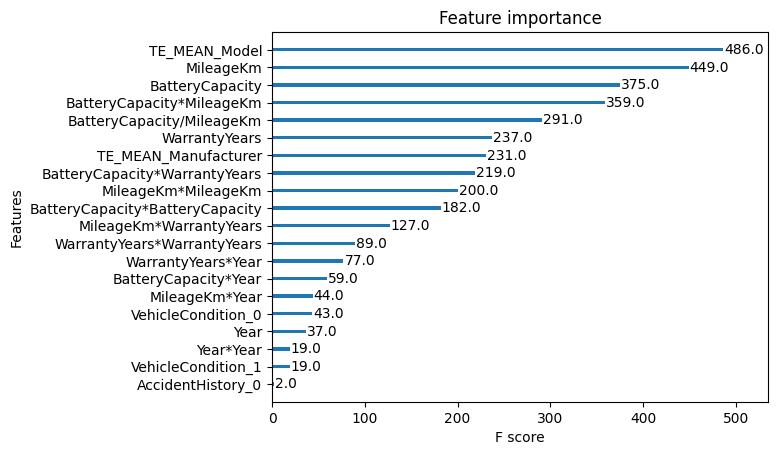

In [751]:
xgb.plot_importance(model, grid=False)

In [752]:
submit = pd.read_csv(f'{PATH}/data/sample_submission.csv')
submit['가격(백만원)'] = pred
submit.head()

ID     가격(백만원)
0  TEST_000  130.827411
1  TEST_001   80.316606
2  TEST_002   64.914220
3  TEST_003   34.951250
4  TEST_004   48.024853

In [753]:
save_file_name = f'{PATH}/result/xgb/xgb_CV-{rmse}_LB-.csv'
submit.to_csv(save_file_name, index=False)
print(save_file_name)

c:\Users\kgw\Desktop\kgw\projects\dacon\elec_car_price_forecasting/result/xgb/xgb_CV-1.3354364063224065_LB-.csv
